# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.ToPILImage(),
                                       #transforms.RandomRotation(10), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       
                                        # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# # Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

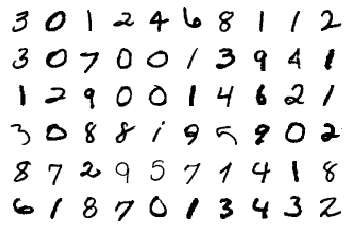

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
# less than 15k params
# CONVOLUTION BLOCK 2 uses dropout of 0.1  
# uses batchnorm
# uses randomrotate transform
# uses StepLR with step size = 6 and gamma = 0.1
# achieves 99.3% test accuracy
# less than 15 epochs

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(), nn.BatchNorm2d(32, momentum=0.1)
            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16, momentum=0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),nn.BatchNorm2d(16, momentum=0.1)
           # nn.Dropout()
         #   nn.BatchNorm1d()
        )# output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),nn.BatchNorm2d(12, momentum=0.1)
          #  nn.Dropout(0.1)
        ) # output_size = 11


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),nn.BatchNorm2d(12, momentum=0.1),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),nn.BatchNorm2d(8, momentum=0.1),
            nn.Dropout(0.1)
        ) # output_size = 7
        

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),nn.BatchNorm2d(10, momentum=0.1),
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
          # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
            Conv2d-4           [-1, 16, 24, 24]           4,608
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             192
             ReLU-12           [-1, 12, 11, 11]               0
      BatchNorm2d-13           [-1, 12, 11, 11]              24
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    scheduler.step()
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())

   
    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
#with bn , no rotate, with step lr - 99.2
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # gamma = decaying factor
EPOCHS = 9
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.3909430503845215 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.3909430503845215 Batch_id=0 Accuracy=10.16:   0%|          | 1/469 [00:00<02:10,  3.59it/s]
Loss=2.244894027709961 Batch_id=1 Accuracy=14.45:   0%|          | 1/469 [00:00<02:10,  3.59it/s] 
Loss=2.0113842487335205 Batch_id=2 Accuracy=17.71:   0%|          | 1/469 [00:00<02:10,  3.59it/s]
Loss=1.569657564163208 Batch_id=3 Accuracy=25.98:   0%|          | 1/469 [00:00<02:10,  3.59it/s] 
Loss=1.569657564163208 Batch_id=3 Accuracy=25.98:   1%|          | 4/469 [00:00<01:35,  4.86it/s]
Loss=1.4803366661071777 Batch_id=4 Accuracy=30.16:   1%|          | 4/469 [00:00<01:35,  4.86it/s]
Loss=1.1821538209915161 Batch_id=5 Accuracy=35.29:   1%|          | 4/469 [00:00<01:35,  4.86it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.9726080894470215 Batch_id=6 Accuracy=40.18:   1%|          | 4/469 [00:00<01:35,  4.86it/s]
Loss=0.9726080894470215 Batch_id=6 Accuracy=40.18:   1%|▏         | 7/469 [00:00<01:11,  6.47it/s]
Loss=0.8791518211364746 Batch_id=7 Accuracy=44.14:   1%|▏         | 7/469 [00:00<01:11,  6.47it/s]
Loss=0.7680315971374512 Batch_id=8 Accuracy=47.40:   1%|▏         | 7/469 [00:00<01:11,  6.47it/s]
Loss=0.5127721428871155 Batch_id=9 Accuracy=50.86:   1%|▏         | 7/469 [00:00<01:11,  6.47it/s]
Loss=0.575539767742157 Batch_id=10 Accuracy=53.76:   1%|▏         | 7/469 [00:00<01:11,  6.47it/s]
Loss=0.575539767742157 Batch_id=10 Accuracy=53.76:   2%|▏         | 11/469 [00:00<00:53,  8.49it/s]
Loss=0.7036609053611755 Batch_id=11 Accuracy=55.92:   2%|▏         | 11/469 [00:00<00:53,  8.49it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.5824822187423706 Batch_id=12 Accuracy=57.99:   2%|▏         | 11/469 [00:00<00:53,  8.49it/s]
Loss=0.6226317286491394 Batch_id=13 Accuracy=59.60:   2%|▏         | 11/469 [00:00<00:53,  8.49it/s]
Loss=0.6277903914451599 Batch_id=14 Accuracy=60.89:   2%|▏         | 11/469 [00:00<00:53,  8.49it/s]
Loss=0.6277903914451599 Batch_id=14 Accuracy=60.89:   3%|▎         | 15/469 [00:00<00:41, 10.91it/s]
Loss=0.6816293001174927 Batch_id=15 Accuracy=61.96:   3%|▎         | 15/469 [00:00<00:41, 10.91it/s]
Loss=0.5790794491767883 Batch_id=16 Accuracy=63.19:   3%|▎         | 15/469 [00:00<00:41, 10.91it/s]
Loss=0.5293214321136475 Batch_id=17 Accuracy=64.28:   3%|▎         | 15/469 [00:00<00:41, 10.91it/s]
Loss=0.5037550330162048 Batch_id=18 Accuracy=65.25:   3%|▎         | 15/469 [00:00<00:41, 10.91it/s]
Loss=0.5037550330162048 Batch_id=18 Accuracy=65.25:   4%|▍         | 19/469 [00:00<00:32, 13.93it/s]
Loss=0.44739705324172974 Batch_id=19 Accuracy=66.48:   4%|▍         | 19/469 [00:00<00:32, 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.504981279373169 Batch_id=20 Accuracy=67.41:   4%|▍         | 19/469 [00:00<00:32, 13.93it/s]  
Loss=0.4922731816768646 Batch_id=21 Accuracy=68.22:   4%|▍         | 19/469 [00:00<00:32, 13.93it/s]
Loss=0.3917141556739807 Batch_id=22 Accuracy=69.02:   4%|▍         | 19/469 [00:00<00:32, 13.93it/s]
Loss=0.48370152711868286 Batch_id=23 Accuracy=69.79:   4%|▍         | 19/469 [00:00<00:32, 13.93it/s]
Loss=0.48370152711868286 Batch_id=23 Accuracy=69.79:   5%|▌         | 24/469 [00:00<00:25, 17.24it/s]
Loss=0.27627766132354736 Batch_id=24 Accuracy=70.72:   5%|▌         | 24/469 [00:01<00:25, 17.24it/s]
Loss=0.3479177951812744 Batch_id=25 Accuracy=71.45:   5%|▌         | 24/469 [00:01<00:25, 17.24it/s] 
Loss=0.3565705418586731 Batch_id=26 Accuracy=72.22:   5%|▌         | 24/469 [00:01<00:25, 17.24it/s]
Loss=0.5326636433601379 Batch_id=27 Accuracy=72.68:   5%|▌         | 24/469 [00:01<00:25, 17.24it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.5326636433601379 Batch_id=27 Accuracy=72.68:   6%|▌         | 28/469 [00:01<00:22, 19.72it/s]
Loss=0.5703677535057068 Batch_id=28 Accuracy=73.20:   6%|▌         | 28/469 [00:01<00:22, 19.72it/s]
Loss=0.28997695446014404 Batch_id=29 Accuracy=73.85:   6%|▌         | 28/469 [00:01<00:22, 19.72it/s]
Loss=0.2841499149799347 Batch_id=30 Accuracy=74.45:   6%|▌         | 28/469 [00:01<00:22, 19.72it/s] 
Loss=0.3755631148815155 Batch_id=31 Accuracy=74.85:   6%|▌         | 28/469 [00:01<00:22, 19.72it/s]
Loss=0.3416617810726166 Batch_id=32 Accuracy=75.28:   6%|▌         | 28/469 [00:01<00:22, 19.72it/s]
Loss=0.3416617810726166 Batch_id=32 Accuracy=75.28:   7%|▋         | 33/469 [00:01<00:18, 23.82it/s]
Loss=0.2954410910606384 Batch_id=33 Accuracy=75.78:   7%|▋         | 33/469 [00:01<00:18, 23.82it/s]
Loss=0.38211309909820557 Batch_id=34 Accuracy=76.21:   7%|▋         | 33/469 [00:01<00:18, 23.82it/s]
Loss=0.16376452147960663 Batch_id=35 Accuracy=76.76:   7%|▋         | 33/469 [00:01<00:1

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.3514708876609802 Batch_id=36 Accuracy=77.07:   7%|▋         | 33/469 [00:01<00:18, 23.82it/s] 
Loss=0.3514708876609802 Batch_id=36 Accuracy=77.07:   8%|▊         | 37/469 [00:01<00:16, 25.67it/s]
Loss=0.2725115418434143 Batch_id=37 Accuracy=77.47:   8%|▊         | 37/469 [00:01<00:16, 25.67it/s]
Loss=0.3969334363937378 Batch_id=38 Accuracy=77.76:   8%|▊         | 37/469 [00:01<00:16, 25.67it/s]
Loss=0.1456548571586609 Batch_id=39 Accuracy=78.20:   8%|▊         | 37/469 [00:01<00:16, 25.67it/s]
Loss=0.28875964879989624 Batch_id=40 Accuracy=78.53:   8%|▊         | 37/469 [00:01<00:16, 25.67it/s]
Loss=0.28875964879989624 Batch_id=40 Accuracy=78.53:   9%|▊         | 41/469 [00:01<00:15, 27.49it/s]
Loss=0.19165533781051636 Batch_id=41 Accuracy=78.85:   9%|▊         | 41/469 [00:01<00:15, 27.49it/s]
Loss=0.21097223460674286 Batch_id=42 Accuracy=79.12:   9%|▊         | 41/469 [00:01<00:15, 27.49it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.31937769055366516 Batch_id=43 Accuracy=79.39:   9%|▊         | 41/469 [00:01<00:15, 27.49it/s]
Loss=0.2128596007823944 Batch_id=44 Accuracy=79.76:   9%|▊         | 41/469 [00:01<00:15, 27.49it/s] 
Loss=0.2128596007823944 Batch_id=44 Accuracy=79.76:  10%|▉         | 45/469 [00:01<00:14, 29.26it/s]
Loss=0.2338145673274994 Batch_id=45 Accuracy=80.01:  10%|▉         | 45/469 [00:01<00:14, 29.26it/s]
Loss=0.16668358445167542 Batch_id=46 Accuracy=80.32:  10%|▉         | 45/469 [00:01<00:14, 29.26it/s]
Loss=0.21169504523277283 Batch_id=47 Accuracy=80.62:  10%|▉         | 45/469 [00:01<00:14, 29.26it/s]
Loss=0.2288038432598114 Batch_id=48 Accuracy=80.88:  10%|▉         | 45/469 [00:01<00:14, 29.26it/s] 
Loss=0.2288038432598114 Batch_id=48 Accuracy=80.88:  10%|█         | 49/469 [00:01<00:13, 31.04it/s]
Loss=0.18914777040481567 Batch_id=49 Accuracy=81.08:  10%|█         | 49/469 [00:01<00:13, 31.04it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.17538264393806458 Batch_id=50 Accuracy=81.36:  10%|█         | 49/469 [00:01<00:13, 31.04it/s]
Loss=0.17475995421409607 Batch_id=51 Accuracy=81.63:  10%|█         | 49/469 [00:01<00:13, 31.04it/s]
Loss=0.14433877170085907 Batch_id=52 Accuracy=81.88:  10%|█         | 49/469 [00:01<00:13, 31.04it/s]
Loss=0.14433877170085907 Batch_id=52 Accuracy=81.88:  11%|█▏        | 53/469 [00:01<00:12, 33.22it/s]
Loss=0.12185993790626526 Batch_id=53 Accuracy=82.16:  11%|█▏        | 53/469 [00:01<00:12, 33.22it/s]
Loss=0.2515638470649719 Batch_id=54 Accuracy=82.36:  11%|█▏        | 53/469 [00:01<00:12, 33.22it/s] 
Loss=0.12641210854053497 Batch_id=55 Accuracy=82.60:  11%|█▏        | 53/469 [00:01<00:12, 33.22it/s]
Loss=0.2776665687561035 Batch_id=56 Accuracy=82.77:  11%|█▏        | 53/469 [00:01<00:12, 33.22it/s] 
Loss=0.2776665687561035 Batch_id=56 Accuracy=82.77:  12%|█▏        | 57/469 [00:01<00:12, 33.65it/s]
Loss=0.0863703191280365 Batch_id=57 Accuracy=83.01:  12%|█▏        | 57/469 [00:01

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.21141234040260315 Batch_id=59 Accuracy=83.35:  12%|█▏        | 57/469 [00:01<00:12, 33.65it/s]
Loss=0.20169025659561157 Batch_id=60 Accuracy=83.50:  12%|█▏        | 57/469 [00:02<00:12, 33.65it/s]
Loss=0.20169025659561157 Batch_id=60 Accuracy=83.50:  13%|█▎        | 61/469 [00:02<00:11, 34.51it/s]
Loss=0.21632380783557892 Batch_id=61 Accuracy=83.66:  13%|█▎        | 61/469 [00:02<00:11, 34.51it/s]
Loss=0.21499165892601013 Batch_id=62 Accuracy=83.82:  13%|█▎        | 61/469 [00:02<00:11, 34.51it/s]
Loss=0.13176214694976807 Batch_id=63 Accuracy=84.01:  13%|█▎        | 61/469 [00:02<00:11, 34.51it/s]
Loss=0.2570917308330536 Batch_id=64 Accuracy=84.10:  13%|█▎        | 61/469 [00:02<00:11, 34.51it/s] 
Loss=0.2570917308330536 Batch_id=64 Accuracy=84.10:  14%|█▍        | 65/469 [00:02<00:11, 35.17it/s]
Loss=0.2742243707180023 Batch_id=65 Accuracy=84.22:  14%|█▍        | 65/469 [00:02<00:11, 35.17it/s]
Loss=0.17407983541488647 Batch_id=66 Accuracy=84.38:  14%|█▍        | 65/469 [00:02

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.15109524130821228 Batch_id=67 Accuracy=84.55:  14%|█▍        | 65/469 [00:02<00:11, 35.17it/s]
Loss=0.1310836225748062 Batch_id=68 Accuracy=84.68:  14%|█▍        | 65/469 [00:02<00:11, 35.17it/s] 
Loss=0.15477165579795837 Batch_id=69 Accuracy=84.82:  14%|█▍        | 65/469 [00:02<00:11, 35.17it/s]
Loss=0.15477165579795837 Batch_id=69 Accuracy=84.82:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=0.17114856839179993 Batch_id=70 Accuracy=84.97:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=0.1208614706993103 Batch_id=71 Accuracy=85.16:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s] 
Loss=0.23856769502162933 Batch_id=72 Accuracy=85.25:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=0.11225670576095581 Batch_id=73 Accuracy=85.40:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=0.11225670576095581 Batch_id=73 Accuracy=85.40:  16%|█▌        | 74/469 [00:02<00:10, 35.95it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2250535786151886 Batch_id=74 Accuracy=85.48:  16%|█▌        | 74/469 [00:02<00:10, 35.95it/s] 
Loss=0.15046027302742004 Batch_id=75 Accuracy=85.59:  16%|█▌        | 74/469 [00:02<00:10, 35.95it/s]
Loss=0.343365877866745 Batch_id=76 Accuracy=85.67:  16%|█▌        | 74/469 [00:02<00:10, 35.95it/s]  
Loss=0.1185334250330925 Batch_id=77 Accuracy=85.83:  16%|█▌        | 74/469 [00:02<00:10, 35.95it/s]
Loss=0.1185334250330925 Batch_id=77 Accuracy=85.83:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.16643889248371124 Batch_id=78 Accuracy=85.93:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.12066488713026047 Batch_id=79 Accuracy=86.05:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.21442021429538727 Batch_id=80 Accuracy=86.14:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.106462761759758 Batch_id=81 Accuracy=86.26:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]  
Loss=0.106462761759758 Batch_id=81 Accuracy=86.26:  17%|█▋        | 82/469 [00:02<0

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.12476105242967606 Batch_id=82 Accuracy=86.39:  17%|█▋        | 82/469 [00:02<00:11, 34.63it/s]
Loss=0.1274791806936264 Batch_id=83 Accuracy=86.53:  17%|█▋        | 82/469 [00:02<00:11, 34.63it/s] 
Loss=0.14167030155658722 Batch_id=84 Accuracy=86.66:  17%|█▋        | 82/469 [00:02<00:11, 34.63it/s]
Loss=0.06761498749256134 Batch_id=85 Accuracy=86.79:  17%|█▋        | 82/469 [00:02<00:11, 34.63it/s]
Loss=0.06761498749256134 Batch_id=85 Accuracy=86.79:  18%|█▊        | 86/469 [00:02<00:11, 33.75it/s]
Loss=0.07868611812591553 Batch_id=86 Accuracy=86.92:  18%|█▊        | 86/469 [00:02<00:11, 33.75it/s]
Loss=0.19679486751556396 Batch_id=87 Accuracy=86.99:  18%|█▊        | 86/469 [00:02<00:11, 33.75it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.15178784728050232 Batch_id=88 Accuracy=87.10:  18%|█▊        | 86/469 [00:02<00:11, 33.75it/s]
Loss=0.13827160000801086 Batch_id=89 Accuracy=87.20:  18%|█▊        | 86/469 [00:02<00:11, 33.75it/s]
Loss=0.13827160000801086 Batch_id=89 Accuracy=87.20:  19%|█▉        | 90/469 [00:02<00:12, 31.54it/s]
Loss=0.10358738899230957 Batch_id=90 Accuracy=87.31:  19%|█▉        | 90/469 [00:02<00:12, 31.54it/s]
Loss=0.10691916942596436 Batch_id=91 Accuracy=87.40:  19%|█▉        | 90/469 [00:02<00:12, 31.54it/s]
Loss=0.12106423825025558 Batch_id=92 Accuracy=87.48:  19%|█▉        | 90/469 [00:02<00:12, 31.54it/s]
Loss=0.136091947555542 Batch_id=93 Accuracy=87.56:  19%|█▉        | 90/469 [00:02<00:12, 31.54it/s]  
Loss=0.136091947555542 Batch_id=93 Accuracy=87.56:  20%|██        | 94/469 [00:03<00:11, 31.68it/s]


 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.061221953481435776 Batch_id=94 Accuracy=87.66:  20%|██        | 94/469 [00:03<00:11, 31.68it/s]
Loss=0.11762135475873947 Batch_id=95 Accuracy=87.75:  20%|██        | 94/469 [00:03<00:11, 31.68it/s] 
Loss=0.14122800529003143 Batch_id=96 Accuracy=87.83:  20%|██        | 94/469 [00:03<00:11, 31.68it/s]
Loss=0.07864920794963837 Batch_id=97 Accuracy=87.91:  20%|██        | 94/469 [00:03<00:11, 31.68it/s]
Loss=0.07864920794963837 Batch_id=97 Accuracy=87.91:  21%|██        | 98/469 [00:03<00:11, 31.23it/s]
Loss=0.12111654132604599 Batch_id=98 Accuracy=87.99:  21%|██        | 98/469 [00:03<00:11, 31.23it/s]
Loss=0.07301273941993713 Batch_id=99 Accuracy=88.09:  21%|██        | 98/469 [00:03<00:11, 31.23it/s]
Loss=0.1813766360282898 Batch_id=100 Accuracy=88.16:  21%|██        | 98/469 [00:03<00:11, 31.23it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.11152737587690353 Batch_id=101 Accuracy=88.24:  21%|██        | 98/469 [00:03<00:11, 31.23it/s]
Loss=0.11152737587690353 Batch_id=101 Accuracy=88.24:  22%|██▏       | 102/469 [00:03<00:12, 29.94it/s]
Loss=0.08285200595855713 Batch_id=102 Accuracy=88.33:  22%|██▏       | 102/469 [00:03<00:12, 29.94it/s]
Loss=0.11651639640331268 Batch_id=103 Accuracy=88.39:  22%|██▏       | 102/469 [00:03<00:12, 29.94it/s]
Loss=0.18114405870437622 Batch_id=104 Accuracy=88.44:  22%|██▏       | 102/469 [00:03<00:12, 29.94it/s]
Loss=0.07652854919433594 Batch_id=105 Accuracy=88.53:  22%|██▏       | 102/469 [00:03<00:12, 29.94it/s]
Loss=0.07652854919433594 Batch_id=105 Accuracy=88.53:  23%|██▎       | 106/469 [00:03<00:11, 30.82it/s]
Loss=0.0900687649846077 Batch_id=106 Accuracy=88.60:  23%|██▎       | 106/469 [00:03<00:11, 30.82it/s] 


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.07632279396057129 Batch_id=107 Accuracy=88.68:  23%|██▎       | 106/469 [00:03<00:11, 30.82it/s]
Loss=0.09819822013378143 Batch_id=108 Accuracy=88.75:  23%|██▎       | 106/469 [00:03<00:11, 30.82it/s]
Loss=0.1586208939552307 Batch_id=109 Accuracy=88.81:  23%|██▎       | 106/469 [00:03<00:11, 30.82it/s] 
Loss=0.1586208939552307 Batch_id=109 Accuracy=88.81:  23%|██▎       | 110/469 [00:03<00:11, 30.57it/s]
Loss=0.15623152256011963 Batch_id=110 Accuracy=88.87:  23%|██▎       | 110/469 [00:03<00:11, 30.57it/s]
Loss=0.14739802479743958 Batch_id=111 Accuracy=88.93:  23%|██▎       | 110/469 [00:03<00:11, 30.57it/s]
Loss=0.20053307712078094 Batch_id=112 Accuracy=88.97:  23%|██▎       | 110/469 [00:03<00:11, 30.57it/s]
Loss=0.04283542186021805 Batch_id=113 Accuracy=89.04:  23%|██▎       | 110/469 [00:03<00:11, 30.57it/s]
Loss=0.06331519782543182 Batch_id=114 Accuracy=89.12:  23%|██▎       | 110/469 [00:03<00:11, 30.57it/s]
Loss=0.06331519782543182 Batch_id=114 Accuracy=89.12:  25%|██▍   

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0959712490439415 Batch_id=116 Accuracy=89.24:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s] 
Loss=0.15872398018836975 Batch_id=117 Accuracy=89.28:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s]
Loss=0.09193602204322815 Batch_id=118 Accuracy=89.34:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s]
Loss=0.09193602204322815 Batch_id=118 Accuracy=89.34:  25%|██▌       | 119/469 [00:03<00:10, 32.82it/s]
Loss=0.15603701770305634 Batch_id=119 Accuracy=89.40:  25%|██▌       | 119/469 [00:03<00:10, 32.82it/s]
Loss=0.0962115228176117 Batch_id=120 Accuracy=89.47:  25%|██▌       | 119/469 [00:03<00:10, 32.82it/s] 
Loss=0.10945908725261688 Batch_id=121 Accuracy=89.54:  25%|██▌       | 119/469 [00:03<00:10, 32.82it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10874289274215698 Batch_id=122 Accuracy=89.60:  25%|██▌       | 119/469 [00:03<00:10, 32.82it/s]
Loss=0.10874289274215698 Batch_id=122 Accuracy=89.60:  26%|██▌       | 123/469 [00:03<00:11, 31.04it/s]
Loss=0.12014906853437424 Batch_id=123 Accuracy=89.66:  26%|██▌       | 123/469 [00:03<00:11, 31.04it/s]
Loss=0.22987893223762512 Batch_id=124 Accuracy=89.70:  26%|██▌       | 123/469 [00:03<00:11, 31.04it/s]
Loss=0.1097261980175972 Batch_id=125 Accuracy=89.74:  26%|██▌       | 123/469 [00:04<00:11, 31.04it/s] 
Loss=0.12082256376743317 Batch_id=126 Accuracy=89.80:  26%|██▌       | 123/469 [00:04<00:11, 31.04it/s]
Loss=0.12082256376743317 Batch_id=126 Accuracy=89.80:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.08532799780368805 Batch_id=127 Accuracy=89.84:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.20933425426483154 Batch_id=128 Accuracy=89.87:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.20684853196144104 Batch_id=129 Accuracy=89.90:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.08623547106981277 Batch_id=130 Accuracy=89.96:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.1979353129863739 Batch_id=131 Accuracy=89.99:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s] 
Loss=0.1979353129863739 Batch_id=131 Accuracy=89.99:  28%|██▊       | 132/469 [00:04<00:09, 34.21it/s]
Loss=0.2156974822282791 Batch_id=132 Accuracy=90.03:  28%|██▊       | 132/469 [00:04<00:09, 34.21it/s]
Loss=0.1162879467010498 Batch_id=133 Accuracy=90.08:  28%|██▊       | 132/469 [00:04<00:09, 34.21it/s]
Loss=0.08596266806125641 Batch_id=134 Accuracy=90.14:  28%|██▊       | 132/469 [00:04<00:09, 34.21it/s]
Loss=0.0835450291633606 Batch_id=135 Accuracy=90.18:  28%|██▊       | 132/469 [00:04<00:09, 34.21it/s] 
Loss=0.0835450291633606 Batch_id=135 Accuracy=90.18:  29%|██▉       | 136/469 [00:04<00:09, 34.93it/s]
Loss=0.1705603152513504 Batch_id=136 Accuracy=90.20:  29%|██▉      

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18021921813488007 Batch_id=137 Accuracy=90.23:  29%|██▉       | 136/469 [00:04<00:09, 34.93it/s]
Loss=0.19982153177261353 Batch_id=138 Accuracy=90.27:  29%|██▉       | 136/469 [00:04<00:09, 34.93it/s]
Loss=0.11461988091468811 Batch_id=139 Accuracy=90.30:  29%|██▉       | 136/469 [00:04<00:09, 34.93it/s]
Loss=0.11461988091468811 Batch_id=139 Accuracy=90.30:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]
Loss=0.11224222183227539 Batch_id=140 Accuracy=90.35:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]
Loss=0.1521630734205246 Batch_id=141 Accuracy=90.38:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s] 
Loss=0.10785339772701263 Batch_id=142 Accuracy=90.43:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.1673613339662552 Batch_id=143 Accuracy=90.45:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s] 
Loss=0.1673613339662552 Batch_id=143 Accuracy=90.45:  31%|███       | 144/469 [00:04<00:10, 32.42it/s]
Loss=0.040298257023096085 Batch_id=144 Accuracy=90.51:  31%|███       | 144/469 [00:04<00:10, 32.42it/s]
Loss=0.09254749119281769 Batch_id=145 Accuracy=90.57:  31%|███       | 144/469 [00:04<00:10, 32.42it/s] 
Loss=0.09819713979959488 Batch_id=146 Accuracy=90.60:  31%|███       | 144/469 [00:04<00:10, 32.42it/s]
Loss=0.20659829676151276 Batch_id=147 Accuracy=90.64:  31%|███       | 144/469 [00:04<00:10, 32.42it/s]
Loss=0.20659829676151276 Batch_id=147 Accuracy=90.64:  32%|███▏      | 148/469 [00:04<00:09, 33.01it/s]
Loss=0.1469404548406601 Batch_id=148 Accuracy=90.68:  32%|███▏      | 148/469 [00:04<00:09, 33.01it/s] 
Loss=0.1044548749923706 Batch_id=149 Accuracy=90.72:  32%|███▏      | 148/469 [00:04<00:09, 33.01it/s]
Loss=0.1206398606300354 Batch_id=150 Accuracy=90.74:  32%|███▏  

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04237477481365204 Batch_id=151 Accuracy=90.79:  32%|███▏      | 148/469 [00:04<00:09, 33.01it/s]
Loss=0.04237477481365204 Batch_id=151 Accuracy=90.79:  32%|███▏      | 152/469 [00:04<00:09, 33.09it/s]
Loss=0.06373811513185501 Batch_id=152 Accuracy=90.84:  32%|███▏      | 152/469 [00:04<00:09, 33.09it/s]
Loss=0.0767216756939888 Batch_id=153 Accuracy=90.88:  32%|███▏      | 152/469 [00:04<00:09, 33.09it/s] 
Loss=0.13960443437099457 Batch_id=154 Accuracy=90.93:  32%|███▏      | 152/469 [00:04<00:09, 33.09it/s]
Loss=0.08059437572956085 Batch_id=155 Accuracy=90.98:  32%|███▏      | 152/469 [00:04<00:09, 33.09it/s]
Loss=0.01975010707974434 Batch_id=156 Accuracy=91.03:  32%|███▏      | 152/469 [00:04<00:09, 33.09it/s]
Loss=0.01975010707974434 Batch_id=156 Accuracy=91.03:  33%|███▎      | 157/469 [00:04<00:08, 35.81it/s]
Loss=0.0721627026796341 Batch_id=157 Accuracy=91.07:  33%|███▎      | 157/469 [00:04<00:08, 35.81it/s] 
Loss=0.1391831487417221 Batch_id=158 Accuracy=91.11:  33%|███▎ 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 


Loss=0.13688689470291138 Batch_id=159 Accuracy=91.14:  33%|███▎      | 157/469 [00:04<00:08, 35.81it/s]
Loss=0.08460088074207306 Batch_id=160 Accuracy=91.17:  33%|███▎      | 157/469 [00:05<00:08, 35.81it/s]
Loss=0.08460088074207306 Batch_id=160 Accuracy=91.17:  34%|███▍      | 161/469 [00:05<00:09, 32.64it/s]
Loss=0.07241358608007431 Batch_id=161 Accuracy=91.21:  34%|███▍      | 161/469 [00:05<00:09, 32.64it/s]
Loss=0.04978908970952034 Batch_id=162 Accuracy=91.26:  34%|███▍      | 161/469 [00:05<00:09, 32.64it/s]
Loss=0.03669791296124458 Batch_id=163 Accuracy=91.30:  34%|███▍      | 161/469 [00:05<00:09, 32.64it/s]
Loss=0.1999259740114212 Batch_id=164 Accuracy=91.33:  34%|███▍      | 161/469 [00:05<00:09, 32.64it/s] 
Loss=0.1999259740114212 Batch_id=164 Accuracy=91.33:  35%|███▌      | 165/469 [00:05<00:09, 30.73it/s]

0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1177901178598404 Batch_id=165 Accuracy=91.37:  35%|███▌      | 165/469 [00:05<00:09, 30.73it/s]
Loss=0.09166956692934036 Batch_id=166 Accuracy=91.40:  35%|███▌      | 165/469 [00:05<00:09, 30.73it/s]
Loss=0.11803179234266281 Batch_id=167 Accuracy=91.42:  35%|███▌      | 165/469 [00:05<00:09, 30.73it/s]
Loss=0.20672376453876495 Batch_id=168 Accuracy=91.44:  35%|███▌      | 165/469 [00:05<00:09, 30.73it/s]
Loss=0.20672376453876495 Batch_id=168 Accuracy=91.44:  36%|███▌      | 169/469 [00:05<00:09, 30.83it/s]
Loss=0.09615503251552582 Batch_id=169 Accuracy=91.48:  36%|███▌      | 169/469 [00:05<00:09, 30.83it/s]
Loss=0.10258641093969345 Batch_id=170 Accuracy=91.51:  36%|███▌      | 169/469 [00:05<00:09, 30.83it/s]
Loss=0.15485230088233948 Batch_id=171 Accuracy=91.53:  36%|███▌      | 169/469 [00:05<00:09, 30.83it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10477817058563232 Batch_id=172 Accuracy=91.56:  36%|███▌      | 169/469 [00:05<00:09, 30.83it/s]
Loss=0.10477817058563232 Batch_id=172 Accuracy=91.56:  37%|███▋      | 173/469 [00:05<00:09, 31.93it/s]
Loss=0.04950665310025215 Batch_id=173 Accuracy=91.60:  37%|███▋      | 173/469 [00:05<00:09, 31.93it/s]
Loss=0.04892590269446373 Batch_id=174 Accuracy=91.63:  37%|███▋      | 173/469 [00:05<00:09, 31.93it/s]
Loss=0.0424550361931324 Batch_id=175 Accuracy=91.67:  37%|███▋      | 173/469 [00:05<00:09, 31.93it/s] 
Loss=0.07637418806552887 Batch_id=176 Accuracy=91.70:  37%|███▋      | 173/469 [00:05<00:09, 31.93it/s]
Loss=0.07637418806552887 Batch_id=176 Accuracy=91.70:  38%|███▊      | 177/469 [00:05<00:09, 31.87it/s]
Loss=0.09526757150888443 Batch_id=177 Accuracy=91.73:  38%|███▊      | 177/469 [00:05<00:09, 31.87it/s]
Loss=0.1976977437734604 Batch_id=178 Accuracy=91.74:  38%|███▊      | 177/469 [00:05<00:09, 31.87it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.12852486968040466 Batch_id=179 Accuracy=91.77:  38%|███▊      | 177/469 [00:05<00:09, 31.87it/s]
Loss=0.18269699811935425 Batch_id=180 Accuracy=91.78:  38%|███▊      | 177/469 [00:05<00:09, 31.87it/s]
Loss=0.18269699811935425 Batch_id=180 Accuracy=91.78:  39%|███▊      | 181/469 [00:05<00:08, 32.59it/s]
Loss=0.10016394406557083 Batch_id=181 Accuracy=91.81:  39%|███▊      | 181/469 [00:05<00:08, 32.59it/s]
Loss=0.10772192478179932 Batch_id=182 Accuracy=91.83:  39%|███▊      | 181/469 [00:05<00:08, 32.59it/s]
Loss=0.04992063343524933 Batch_id=183 Accuracy=91.86:  39%|███▊      | 181/469 [00:05<00:08, 32.59it/s]
Loss=0.09584550559520721 Batch_id=184 Accuracy=91.89:  39%|███▊      | 181/469 [00:05<00:08, 32.59it/s]
Loss=0.09584550559520721 Batch_id=184 Accuracy=91.89:  39%|███▉      | 185/469 [00:05<00:08, 32.02it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06073571741580963 Batch_id=185 Accuracy=91.93:  39%|███▉      | 185/469 [00:05<00:08, 32.02it/s]
Loss=0.1287454068660736 Batch_id=186 Accuracy=91.95:  39%|███▉      | 185/469 [00:05<00:08, 32.02it/s] 
Loss=0.06568525731563568 Batch_id=187 Accuracy=91.98:  39%|███▉      | 185/469 [00:05<00:08, 32.02it/s]
Loss=0.057141102850437164 Batch_id=188 Accuracy=92.01:  39%|███▉      | 185/469 [00:05<00:08, 32.02it/s]
Loss=0.057141102850437164 Batch_id=188 Accuracy=92.01:  40%|████      | 189/469 [00:05<00:08, 31.81it/s]
Loss=0.11302898079156876 Batch_id=189 Accuracy=92.03:  40%|████      | 189/469 [00:05<00:08, 31.81it/s] 
Loss=0.07877004146575928 Batch_id=190 Accuracy=92.06:  40%|████      | 189/469 [00:05<00:08, 31.81it/s]
Loss=0.1134842038154602 Batch_id=191 Accuracy=92.09:  40%|████      | 189/469 [00:06<00:08, 31.81it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.050618976354599 Batch_id=192 Accuracy=92.12:  40%|████      | 189/469 [00:06<00:08, 31.81it/s] 
Loss=0.050618976354599 Batch_id=192 Accuracy=92.12:  41%|████      | 193/469 [00:06<00:08, 31.43it/s]
Loss=0.14211148023605347 Batch_id=193 Accuracy=92.12:  41%|████      | 193/469 [00:06<00:08, 31.43it/s]
Loss=0.04237229377031326 Batch_id=194 Accuracy=92.16:  41%|████      | 193/469 [00:06<00:08, 31.43it/s]
Loss=0.06208091974258423 Batch_id=195 Accuracy=92.18:  41%|████      | 193/469 [00:06<00:08, 31.43it/s]
Loss=0.05166137218475342 Batch_id=196 Accuracy=92.21:  41%|████      | 193/469 [00:06<00:08, 31.43it/s]
Loss=0.05166137218475342 Batch_id=196 Accuracy=92.21:  42%|████▏     | 197/469 [00:06<00:08, 31.09it/s]
Loss=0.1341344267129898 Batch_id=197 Accuracy=92.22:  42%|████▏     | 197/469 [00:06<00:08, 31.09it/s] 
Loss=0.11738837510347366 Batch_id=198 Accuracy=92.24:  42%|████▏     | 197/469 [00:06<00:08, 31.09it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10701876878738403 Batch_id=199 Accuracy=92.27:  42%|████▏     | 197/469 [00:06<00:08, 31.09it/s]
Loss=0.040267109870910645 Batch_id=200 Accuracy=92.30:  42%|████▏     | 197/469 [00:06<00:08, 31.09it/s]
Loss=0.040267109870910645 Batch_id=200 Accuracy=92.30:  43%|████▎     | 201/469 [00:06<00:08, 33.00it/s]
Loss=0.06314688920974731 Batch_id=201 Accuracy=92.33:  43%|████▎     | 201/469 [00:06<00:08, 33.00it/s] 
Loss=0.21311621367931366 Batch_id=202 Accuracy=92.35:  43%|████▎     | 201/469 [00:06<00:08, 33.00it/s]
Loss=0.08871207386255264 Batch_id=203 Accuracy=92.38:  43%|████▎     | 201/469 [00:06<00:08, 33.00it/s]
Loss=0.15489648282527924 Batch_id=204 Accuracy=92.39:  43%|████▎     | 201/469 [00:06<00:08, 33.00it/s]
Loss=0.15489648282527924 Batch_id=204 Accuracy=92.39:  44%|████▎     | 205/469 [00:06<00:07, 33.42it/s]
Loss=0.08802127838134766 Batch_id=205 Accuracy=92.42:  44%|████▎     | 205/469 [00:06<00:07, 33.42it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.15392446517944336 Batch_id=206 Accuracy=92.43:  44%|████▎     | 205/469 [00:06<00:07, 33.42it/s]
Loss=0.12436913698911667 Batch_id=207 Accuracy=92.46:  44%|████▎     | 205/469 [00:06<00:07, 33.42it/s]
Loss=0.07913627475500107 Batch_id=208 Accuracy=92.48:  44%|████▎     | 205/469 [00:06<00:07, 33.42it/s]
Loss=0.06269274652004242 Batch_id=209 Accuracy=92.51:  44%|████▎     | 205/469 [00:06<00:07, 33.42it/s]
Loss=0.06269274652004242 Batch_id=209 Accuracy=92.51:  45%|████▍     | 210/469 [00:06<00:07, 36.51it/s]
Loss=0.07757291197776794 Batch_id=210 Accuracy=92.53:  45%|████▍     | 210/469 [00:06<00:07, 36.51it/s]
Loss=0.13776744902133942 Batch_id=211 Accuracy=92.54:  45%|████▍     | 210/469 [00:06<00:07, 36.51it/s]
Loss=0.14468371868133545 Batch_id=212 Accuracy=92.55:  45%|████▍     | 210/469 [00:06<00:07, 36.51it/s]
Loss=0.1840996891260147 Batch_id=213 Accuracy=92.56:  45%|████▍     | 210/469 [00:06<00:07, 36.51it/s] 
Loss=0.1840996891260147 Batch_id=213 Accuracy=92.56:  46%|████▌

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0461244061589241 Batch_id=214 Accuracy=92.59:  46%|████▌     | 214/469 [00:06<00:07, 35.34it/s]
Loss=0.15144823491573334 Batch_id=215 Accuracy=92.60:  46%|████▌     | 214/469 [00:06<00:07, 35.34it/s]
Loss=0.078929603099823 Batch_id=216 Accuracy=92.62:  46%|████▌     | 214/469 [00:06<00:07, 35.34it/s]  
Loss=0.06685616075992584 Batch_id=217 Accuracy=92.65:  46%|████▌     | 214/469 [00:06<00:07, 35.34it/s]
Loss=0.06685616075992584 Batch_id=217 Accuracy=92.65:  46%|████▋     | 218/469 [00:06<00:07, 34.92it/s]
Loss=0.037226974964141846 Batch_id=218 Accuracy=92.67:  46%|████▋     | 218/469 [00:06<00:07, 34.92it/s]
Loss=0.07348985970020294 Batch_id=219 Accuracy=92.70:  46%|████▋     | 218/469 [00:06<00:07, 34.92it/s] 
Loss=0.05104866623878479 Batch_id=220 Accuracy=92.72:  46%|████▋     | 218/469 [00:06<00:07, 34.92it/s]
Loss=0.03968802094459534 Batch_id=221 Accuracy=92.75:  46%|████▋     | 218/469 [00:06<00:07, 34.92it/s]
Loss=0.08747616410255432 Batch_id=222 Accuracy=92.77:  46%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR:


Loss=0.058372970670461655 Batch_id=223 Accuracy=92.79:  48%|████▊     | 223/469 [00:06<00:06, 37.49it/s]
Loss=0.05566030368208885 Batch_id=224 Accuracy=92.82:  48%|████▊     | 223/469 [00:06<00:06, 37.49it/s] 
Loss=0.09156706184148788 Batch_id=225 Accuracy=92.83:  48%|████▊     | 223/469 [00:06<00:06, 37.49it/s]
Loss=0.08845461159944534 Batch_id=226 Accuracy=92.84:  48%|████▊     | 223/469 [00:06<00:06, 37.49it/s]
Loss=0.08845461159944534 Batch_id=226 Accuracy=92.84:  48%|████▊     | 227/469 [00:06<00:06, 34.83it/s]
Loss=0.16329504549503326 Batch_id=227 Accuracy=92.86:  48%|████▊     | 227/469 [00:07<00:06, 34.83it/s]
Loss=0.08886193484067917 Batch_id=228 Accuracy=92.88:  48%|████▊     | 227/469 [00:07<00:06, 34.83it/s]

 [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 


Loss=0.022132746875286102 Batch_id=229 Accuracy=92.91:  48%|████▊     | 227/469 [00:07<00:06, 34.83it/s]
Loss=0.11744625121355057 Batch_id=230 Accuracy=92.93:  48%|████▊     | 227/469 [00:07<00:06, 34.83it/s] 
Loss=0.11744625121355057 Batch_id=230 Accuracy=92.93:  49%|████▉     | 231/469 [00:07<00:07, 31.84it/s]
Loss=0.11684596538543701 Batch_id=231 Accuracy=92.95:  49%|████▉     | 231/469 [00:07<00:07, 31.84it/s]
Loss=0.08827467262744904 Batch_id=232 Accuracy=92.96:  49%|████▉     | 231/469 [00:07<00:07, 31.84it/s]
Loss=0.14669671654701233 Batch_id=233 Accuracy=92.97:  49%|████▉     | 231/469 [00:07<00:07, 31.84it/s]
Loss=0.07080084830522537 Batch_id=234 Accuracy=92.99:  49%|████▉     | 231/469 [00:07<00:07, 31.84it/s]
Loss=0.07080084830522537 Batch_id=234 Accuracy=92.99:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]
Loss=0.06977500021457672 Batch_id=235 Accuracy=93.01:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]

LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09553714841604233 Batch_id=236 Accuracy=93.03:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]
Loss=0.14908728003501892 Batch_id=237 Accuracy=93.04:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]
Loss=0.06344765424728394 Batch_id=238 Accuracy=93.06:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]
Loss=0.08309705555438995 Batch_id=239 Accuracy=93.08:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]
Loss=0.07984483987092972 Batch_id=240 Accuracy=93.10:  50%|█████     | 235/469 [00:07<00:07, 32.47it/s]
Loss=0.07984483987092972 Batch_id=240 Accuracy=93.10:  51%|█████▏    | 241/469 [00:07<00:06, 36.67it/s]
Loss=0.09784325957298279 Batch_id=241 Accuracy=93.11:  51%|█████▏    | 241/469 [00:07<00:06, 36.67it/s]
Loss=0.02483220025897026 Batch_id=242 Accuracy=93.14:  51%|█████▏    | 241/469 [00:07<00:06, 36.67it/s]
Loss=0.08111386001110077 Batch_id=243 Accuracy=93.15:  51%|█████▏    | 241/469 [00:07<00:06, 36.67it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.015476174652576447 Batch_id=244 Accuracy=93.18:  51%|█████▏    | 241/469 [00:07<00:06, 36.67it/s]
Loss=0.015476174652576447 Batch_id=244 Accuracy=93.18:  52%|█████▏    | 245/469 [00:07<00:06, 32.07it/s]
Loss=0.0894172340631485 Batch_id=245 Accuracy=93.19:  52%|█████▏    | 245/469 [00:07<00:06, 32.07it/s]  
Loss=0.10901383310556412 Batch_id=246 Accuracy=93.20:  52%|█████▏    | 245/469 [00:07<00:06, 32.07it/s]
Loss=0.06379012018442154 Batch_id=247 Accuracy=93.21:  52%|█████▏    | 245/469 [00:07<00:06, 32.07it/s]
Loss=0.07716003060340881 Batch_id=248 Accuracy=93.23:  52%|█████▏    | 245/469 [00:07<00:06, 32.07it/s]
Loss=0.07716003060340881 Batch_id=248 Accuracy=93.23:  53%|█████▎    | 249/469 [00:07<00:06, 31.84it/s]
Loss=0.07848931849002838 Batch_id=249 Accuracy=93.25:  53%|█████▎    | 249/469 [00:07<00:06, 31.84it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 


Loss=0.10220465064048767 Batch_id=250 Accuracy=93.27:  53%|█████▎    | 249/469 [00:07<00:06, 31.84it/s]
Loss=0.09804036468267441 Batch_id=251 Accuracy=93.28:  53%|█████▎    | 249/469 [00:07<00:06, 31.84it/s]
Loss=0.06364007294178009 Batch_id=252 Accuracy=93.30:  53%|█████▎    | 249/469 [00:07<00:06, 31.84it/s]
Loss=0.06364007294178009 Batch_id=252 Accuracy=93.30:  54%|█████▍    | 253/469 [00:07<00:06, 31.55it/s]
Loss=0.11859596520662308 Batch_id=253 Accuracy=93.31:  54%|█████▍    | 253/469 [00:07<00:06, 31.55it/s]
Loss=0.17252695560455322 Batch_id=254 Accuracy=93.31:  54%|█████▍    | 253/469 [00:07<00:06, 31.55it/s]
Loss=0.07835693657398224 Batch_id=255 Accuracy=93.33:  54%|█████▍    | 253/469 [00:07<00:06, 31.55it/s]

LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06744110584259033 Batch_id=256 Accuracy=93.34:  54%|█████▍    | 253/469 [00:07<00:06, 31.55it/s]
Loss=0.06744110584259033 Batch_id=256 Accuracy=93.34:  55%|█████▍    | 257/469 [00:07<00:06, 31.22it/s]
Loss=0.1108693927526474 Batch_id=257 Accuracy=93.35:  55%|█████▍    | 257/469 [00:07<00:06, 31.22it/s] 
Loss=0.05167684331536293 Batch_id=258 Accuracy=93.37:  55%|█████▍    | 257/469 [00:07<00:06, 31.22it/s]
Loss=0.07349125295877457 Batch_id=259 Accuracy=93.39:  55%|█████▍    | 257/469 [00:08<00:06, 31.22it/s]
Loss=0.03420461714267731 Batch_id=260 Accuracy=93.41:  55%|█████▍    | 257/469 [00:08<00:06, 31.22it/s]
Loss=0.03420461714267731 Batch_id=260 Accuracy=93.41:  56%|█████▌    | 261/469 [00:08<00:06, 32.09it/s]
Loss=0.11864442378282547 Batch_id=261 Accuracy=93.42:  56%|█████▌    | 261/469 [00:08<00:06, 32.09it/s]
Loss=0.1174708902835846 Batch_id=262 Accuracy=93.43:  56%|█████▌    | 261/469 [00:08<00:06, 32.09it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1188058853149414 Batch_id=263 Accuracy=93.45:  56%|█████▌    | 261/469 [00:08<00:06, 32.09it/s]
Loss=0.08818984031677246 Batch_id=264 Accuracy=93.46:  56%|█████▌    | 261/469 [00:08<00:06, 32.09it/s]
Loss=0.08818984031677246 Batch_id=264 Accuracy=93.46:  57%|█████▋    | 265/469 [00:08<00:06, 32.15it/s]
Loss=0.07000149041414261 Batch_id=265 Accuracy=93.47:  57%|█████▋    | 265/469 [00:08<00:06, 32.15it/s]
Loss=0.04792217165231705 Batch_id=266 Accuracy=93.49:  57%|█████▋    | 265/469 [00:08<00:06, 32.15it/s]
Loss=0.16597792506217957 Batch_id=267 Accuracy=93.49:  57%|█████▋    | 265/469 [00:08<00:06, 32.15it/s]
Loss=0.1499735414981842 Batch_id=268 Accuracy=93.50:  57%|█████▋    | 265/469 [00:08<00:06, 32.15it/s] 
Loss=0.1499735414981842 Batch_id=268 Accuracy=93.50:  57%|█████▋    | 269/469 [00:08<00:06, 32.87it/s]
Loss=0.08312875777482986 Batch_id=269 Accuracy=93.52:  57%|█████▋    | 269/469 [00:08<00:06, 32.87it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 


Loss=0.16483554244041443 Batch_id=270 Accuracy=93.53:  57%|█████▋    | 269/469 [00:08<00:06, 32.87it/s]
Loss=0.040917616337537766 Batch_id=271 Accuracy=93.55:  57%|█████▋    | 269/469 [00:08<00:06, 32.87it/s]
Loss=0.1120118796825409 Batch_id=272 Accuracy=93.56:  57%|█████▋    | 269/469 [00:08<00:06, 32.87it/s]  
Loss=0.1120118796825409 Batch_id=272 Accuracy=93.56:  58%|█████▊    | 273/469 [00:08<00:06, 31.45it/s]
Loss=0.12349250167608261 Batch_id=273 Accuracy=93.57:  58%|█████▊    | 273/469 [00:08<00:06, 31.45it/s]
Loss=0.04053867608308792 Batch_id=274 Accuracy=93.59:  58%|█████▊    | 273/469 [00:08<00:06, 31.45it/s]
Loss=0.09107036143541336 Batch_id=275 Accuracy=93.60:  58%|█████▊    | 273/469 [00:08<00:06, 31.45it/s]
Loss=0.1059190034866333 Batch_id=276 Accuracy=93.61:  58%|█████▊    | 273/469 [00:08<00:06, 31.45it/s] 
Loss=0.1059190034866333 Batch_id=276 Accuracy=93.61:  59%|█████▉    | 277/469 [00:08<00:06, 30.56it/s]

0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.17989233136177063 Batch_id=277 Accuracy=93.62:  59%|█████▉    | 277/469 [00:08<00:06, 30.56it/s]
Loss=0.0361955352127552 Batch_id=278 Accuracy=93.64:  59%|█████▉    | 277/469 [00:08<00:06, 30.56it/s] 
Loss=0.10042379796504974 Batch_id=279 Accuracy=93.65:  59%|█████▉    | 277/469 [00:08<00:06, 30.56it/s]
Loss=0.033454928547143936 Batch_id=280 Accuracy=93.67:  59%|█████▉    | 277/469 [00:08<00:06, 30.56it/s]
Loss=0.033454928547143936 Batch_id=280 Accuracy=93.67:  60%|█████▉    | 281/469 [00:08<00:06, 30.65it/s]
Loss=0.018968798220157623 Batch_id=281 Accuracy=93.69:  60%|█████▉    | 281/469 [00:08<00:06, 30.65it/s]
Loss=0.04368085041642189 Batch_id=282 Accuracy=93.71:  60%|█████▉    | 281/469 [00:08<00:06, 30.65it/s] 
Loss=0.11973924934864044 Batch_id=283 Accuracy=93.72:  60%|█████▉    | 281/469 [00:08<00:06, 30.65it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.1383952498435974 Batch_id=284 Accuracy=93.73:  60%|█████▉    | 281/469 [00:08<00:06, 30.65it/s] 
Loss=0.1383952498435974 Batch_id=284 Accuracy=93.73:  61%|██████    | 285/469 [00:08<00:05, 30.84it/s]
Loss=0.04364706948399544 Batch_id=285 Accuracy=93.75:  61%|██████    | 285/469 [00:08<00:05, 30.84it/s]
Loss=0.08217991888523102 Batch_id=286 Accuracy=93.76:  61%|██████    | 285/469 [00:08<00:05, 30.84it/s]
Loss=0.016985666006803513 Batch_id=287 Accuracy=93.78:  61%|██████    | 285/469 [00:08<00:05, 30.84it/s]
Loss=0.08836974203586578 Batch_id=288 Accuracy=93.80:  61%|██████    | 285/469 [00:08<00:05, 30.84it/s] 
Loss=0.08836974203586578 Batch_id=288 Accuracy=93.80:  62%|██████▏   | 289/469 [00:08<00:05, 30.43it/s]
Loss=0.11744111031293869 Batch_id=289 Accuracy=93.81:  62%|██████▏   | 289/469 [00:08<00:05, 30.43it/s]
Loss=0.06366172432899475 Batch_id=290 Accuracy=93.82:  62%|██████▏   | 289/469 [00:09<00:05, 30.43it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.03511956334114075 Batch_id=291 Accuracy=93.83:  62%|██████▏   | 289/469 [00:09<00:05, 30.43it/s]
Loss=0.07860734313726425 Batch_id=292 Accuracy=93.84:  62%|██████▏   | 289/469 [00:09<00:05, 30.43it/s]
Loss=0.07860734313726425 Batch_id=292 Accuracy=93.84:  62%|██████▏   | 293/469 [00:09<00:05, 31.45it/s]
Loss=0.1331348568201065 Batch_id=293 Accuracy=93.85:  62%|██████▏   | 293/469 [00:09<00:05, 31.45it/s] 
Loss=0.07264478504657745 Batch_id=294 Accuracy=93.86:  62%|██████▏   | 293/469 [00:09<00:05, 31.45it/s]
Loss=0.03040265664458275 Batch_id=295 Accuracy=93.88:  62%|██████▏   | 293/469 [00:09<00:05, 31.45it/s]
Loss=0.12463222444057465 Batch_id=296 Accuracy=93.88:  62%|██████▏   | 293/469 [00:09<00:05, 31.45it/s]
Loss=0.12463222444057465 Batch_id=296 Accuracy=93.88:  63%|██████▎   | 297/469 [00:09<00:05, 30.97it/s]
Loss=0.05989855155348778 Batch_id=297 Accuracy=93.90:  63%|██████▎   | 297/469 [00:09<00:05, 30.97it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09242501854896545 Batch_id=298 Accuracy=93.90:  63%|██████▎   | 297/469 [00:09<00:05, 30.97it/s]
Loss=0.08634944260120392 Batch_id=299 Accuracy=93.91:  63%|██████▎   | 297/469 [00:09<00:05, 30.97it/s]
Loss=0.18538227677345276 Batch_id=300 Accuracy=93.91:  63%|██████▎   | 297/469 [00:09<00:05, 30.97it/s]
Loss=0.18538227677345276 Batch_id=300 Accuracy=93.91:  64%|██████▍   | 301/469 [00:09<00:05, 29.47it/s]
Loss=0.06262524425983429 Batch_id=301 Accuracy=93.93:  64%|██████▍   | 301/469 [00:09<00:05, 29.47it/s]
Loss=0.13289839029312134 Batch_id=302 Accuracy=93.94:  64%|██████▍   | 301/469 [00:09<00:05, 29.47it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.1947489082813263 Batch_id=303 Accuracy=93.96:  64%|██████▍   | 301/469 [00:09<00:05, 29.47it/s] 
Loss=0.1947489082813263 Batch_id=303 Accuracy=93.96:  65%|██████▍   | 304/469 [00:09<00:05, 28.72it/s]
Loss=0.07283057272434235 Batch_id=304 Accuracy=93.97:  65%|██████▍   | 304/469 [00:09<00:05, 28.72it/s]
Loss=0.03428938612341881 Batch_id=305 Accuracy=93.98:  65%|██████▍   | 304/469 [00:09<00:05, 28.72it/s]
Loss=0.10136063396930695 Batch_id=306 Accuracy=93.99:  65%|██████▍   | 304/469 [00:09<00:05, 28.72it/s]
Loss=0.03668534383177757 Batch_id=307 Accuracy=94.00:  65%|██████▍   | 304/469 [00:09<00:05, 28.72it/s]
Loss=0.03668534383177757 Batch_id=307 Accuracy=94.00:  66%|██████▌   | 308/469 [00:09<00:05, 29.91it/s]
Loss=0.13608354330062866 Batch_id=308 Accuracy=94.01:  66%|██████▌   | 308/469 [00:09<00:05, 29.91it/s]
Loss=0.093815878033638 Batch_id=309 Accuracy=94.02:  66%|██████▌   | 308/469 [00:09<00:05, 29.91it/s]  


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.08253608644008636 Batch_id=310 Accuracy=94.03:  66%|██████▌   | 308/469 [00:09<00:05, 29.91it/s]
Loss=0.03458944708108902 Batch_id=311 Accuracy=94.04:  66%|██████▌   | 308/469 [00:09<00:05, 29.91it/s]
Loss=0.03458944708108902 Batch_id=311 Accuracy=94.04:  67%|██████▋   | 312/469 [00:09<00:05, 29.76it/s]
Loss=0.03617742657661438 Batch_id=312 Accuracy=94.06:  67%|██████▋   | 312/469 [00:09<00:05, 29.76it/s]
Loss=0.07007547467947006 Batch_id=313 Accuracy=94.07:  67%|██████▋   | 312/469 [00:09<00:05, 29.76it/s]
Loss=0.09981333464384079 Batch_id=314 Accuracy=94.08:  67%|██████▋   | 312/469 [00:09<00:05, 29.76it/s]
Loss=0.09981333464384079 Batch_id=314 Accuracy=94.08:  67%|██████▋   | 315/469 [00:09<00:05, 29.61it/s]
Loss=0.186376690864563 Batch_id=315 Accuracy=94.08:  67%|██████▋   | 315/469 [00:09<00:05, 29.61it/s]  
Loss=0.07709996402263641 Batch_id=316 Accuracy=94.10:  67%|██████▋   | 315/469 [00:09<00:05, 29.61it/s]
Loss=0.16005539894104004 Batch_id=317 Accuracy=94.10:  67%|█████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.036096684634685516 Batch_id=318 Accuracy=94.11:  67%|██████▋   | 315/469 [00:09<00:05, 29.61it/s]
Loss=0.036096684634685516 Batch_id=318 Accuracy=94.11:  68%|██████▊   | 319/469 [00:09<00:04, 31.44it/s]
Loss=0.10996480286121368 Batch_id=319 Accuracy=94.12:  68%|██████▊   | 319/469 [00:09<00:04, 31.44it/s] 
Loss=0.04452274739742279 Batch_id=320 Accuracy=94.13:  68%|██████▊   | 319/469 [00:09<00:04, 31.44it/s]
Loss=0.021359995007514954 Batch_id=321 Accuracy=94.15:  68%|██████▊   | 319/469 [00:09<00:04, 31.44it/s]
Loss=0.09521210938692093 Batch_id=322 Accuracy=94.16:  68%|██████▊   | 319/469 [00:10<00:04, 31.44it/s] 
Loss=0.06491293758153915 Batch_id=323 Accuracy=94.17:  68%|██████▊   | 319/469 [00:10<00:04, 31.44it/s]
Loss=0.06491293758153915 Batch_id=323 Accuracy=94.17:  69%|██████▉   | 324/469 [00:10<00:04, 34.83it/s]
Loss=0.07050163298845291 Batch_id=324 Accuracy=94.18:  69%|██████▉   | 324/469 [00:10<00:04, 34.83it/s]
Loss=0.0629531666636467 Batch_id=325 Accuracy=94.19:  69%|

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0618862584233284 Batch_id=326 Accuracy=94.21:  69%|██████▉   | 324/469 [00:10<00:04, 34.83it/s]
Loss=0.05933551490306854 Batch_id=327 Accuracy=94.22:  69%|██████▉   | 324/469 [00:10<00:04, 34.83it/s]
Loss=0.05933551490306854 Batch_id=327 Accuracy=94.22:  70%|██████▉   | 328/469 [00:10<00:04, 34.62it/s]
Loss=0.029440324753522873 Batch_id=328 Accuracy=94.24:  70%|██████▉   | 328/469 [00:10<00:04, 34.62it/s]
Loss=0.1832510530948639 Batch_id=329 Accuracy=94.24:  70%|██████▉   | 328/469 [00:10<00:04, 34.62it/s]  
Loss=0.1310385763645172 Batch_id=330 Accuracy=94.24:  70%|██████▉   | 328/469 [00:10<00:04, 34.62it/s]
Loss=0.17773735523223877 Batch_id=331 Accuracy=94.25:  70%|██████▉   | 328/469 [00:10<00:04, 34.62it/s]
Loss=0.11128923296928406 Batch_id=332 Accuracy=94.25:  70%|██████▉   | 328/469 [00:10<00:04, 34.62it/s]
Loss=0.11128923296928406 Batch_id=332 Accuracy=94.25:  71%|███████   | 333/469 [00:10<00:03, 36.23it/s]
Loss=0.052385926246643066 Batch_id=333 Accuracy=94.27:  71%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.033600904047489166 Batch_id=334 Accuracy=94.28:  71%|███████   | 333/469 [00:10<00:03, 36.23it/s]
Loss=0.020560234785079956 Batch_id=335 Accuracy=94.29:  71%|███████   | 333/469 [00:10<00:03, 36.23it/s]
Loss=0.09397818893194199 Batch_id=336 Accuracy=94.30:  71%|███████   | 333/469 [00:10<00:03, 36.23it/s] 
Loss=0.09397818893194199 Batch_id=336 Accuracy=94.30:  72%|███████▏  | 337/469 [00:10<00:04, 31.36it/s]
Loss=0.11755386739969254 Batch_id=337 Accuracy=94.30:  72%|███████▏  | 337/469 [00:10<00:04, 31.36it/s]
Loss=0.07937897741794586 Batch_id=338 Accuracy=94.31:  72%|███████▏  | 337/469 [00:10<00:04, 31.36it/s]
Loss=0.05309738218784332 Batch_id=339 Accuracy=94.33:  72%|███████▏  | 337/469 [00:10<00:04, 31.36it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0480152852833271 Batch_id=340 Accuracy=94.34:  72%|███████▏  | 337/469 [00:10<00:04, 31.36it/s] 
Loss=0.0480152852833271 Batch_id=340 Accuracy=94.34:  73%|███████▎  | 341/469 [00:10<00:03, 32.61it/s]
Loss=0.12450885772705078 Batch_id=341 Accuracy=94.35:  73%|███████▎  | 341/469 [00:10<00:03, 32.61it/s]
Loss=0.11422137171030045 Batch_id=342 Accuracy=94.35:  73%|███████▎  | 341/469 [00:10<00:03, 32.61it/s]
Loss=0.08789438009262085 Batch_id=343 Accuracy=94.36:  73%|███████▎  | 341/469 [00:10<00:03, 32.61it/s]
Loss=0.026266135275363922 Batch_id=344 Accuracy=94.37:  73%|███████▎  | 341/469 [00:10<00:03, 32.61it/s]
Loss=0.026266135275363922 Batch_id=344 Accuracy=94.37:  74%|███████▎  | 345/469 [00:10<00:03, 31.78it/s]
Loss=0.04568161070346832 Batch_id=345 Accuracy=94.38:  74%|███████▎  | 345/469 [00:10<00:03, 31.78it/s] 
Loss=0.06420885026454926 Batch_id=346 Accuracy=94.39:  74%|███████▎  | 345/469 [00:10<00:03, 31.78it/s]
Loss=0.03736263886094093 Batch_id=347 Accuracy=94.40:  74%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.028150934725999832 Batch_id=348 Accuracy=94.42:  74%|███████▎  | 345/469 [00:10<00:03, 31.78it/s]
Loss=0.028150934725999832 Batch_id=348 Accuracy=94.42:  74%|███████▍  | 349/469 [00:10<00:03, 32.56it/s]
Loss=0.04079955443739891 Batch_id=349 Accuracy=94.43:  74%|███████▍  | 349/469 [00:10<00:03, 32.56it/s] 
Loss=0.07929174602031708 Batch_id=350 Accuracy=94.43:  74%|███████▍  | 349/469 [00:10<00:03, 32.56it/s]
Loss=0.06750046461820602 Batch_id=351 Accuracy=94.44:  74%|███████▍  | 349/469 [00:10<00:03, 32.56it/s]
Loss=0.040354255586862564 Batch_id=352 Accuracy=94.45:  74%|███████▍  | 349/469 [00:10<00:03, 32.56it/s]
Loss=0.040354255586862564 Batch_id=352 Accuracy=94.45:  75%|███████▌  | 353/469 [00:10<00:03, 32.53it/s]
Loss=0.10107072442770004 Batch_id=353 Accuracy=94.46:  75%|███████▌  | 353/469 [00:10<00:03, 32.53it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0721515491604805 Batch_id=354 Accuracy=94.47:  75%|███████▌  | 353/469 [00:11<00:03, 32.53it/s] 
Loss=0.10498426109552383 Batch_id=355 Accuracy=94.48:  75%|███████▌  | 353/469 [00:11<00:03, 32.53it/s]
Loss=0.02201758325099945 Batch_id=356 Accuracy=94.49:  75%|███████▌  | 353/469 [00:11<00:03, 32.53it/s]
Loss=0.02201758325099945 Batch_id=356 Accuracy=94.49:  76%|███████▌  | 357/469 [00:11<00:03, 30.94it/s]
Loss=0.06630095839500427 Batch_id=357 Accuracy=94.50:  76%|███████▌  | 357/469 [00:11<00:03, 30.94it/s]
Loss=0.07263036072254181 Batch_id=358 Accuracy=94.51:  76%|███████▌  | 357/469 [00:11<00:03, 30.94it/s]
Loss=0.13446123898029327 Batch_id=359 Accuracy=94.52:  76%|███████▌  | 357/469 [00:11<00:03, 30.94it/s]
Loss=0.05690227076411247 Batch_id=360 Accuracy=94.53:  76%|███████▌  | 357/469 [00:11<00:03, 30.94it/s]
Loss=0.05690227076411247 Batch_id=360 Accuracy=94.53:  77%|███████▋  | 361/469 [00:11<00:03, 31.06it/s]
Loss=0.11493153125047684 Batch_id=361 Accuracy=94.54:  77%|████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.043345857411623 Batch_id=362 Accuracy=94.55:  77%|███████▋  | 361/469 [00:11<00:03, 31.06it/s]  
Loss=0.028603507205843925 Batch_id=363 Accuracy=94.56:  77%|███████▋  | 361/469 [00:11<00:03, 31.06it/s]
Loss=0.13401390612125397 Batch_id=364 Accuracy=94.56:  77%|███████▋  | 361/469 [00:11<00:03, 31.06it/s] 
Loss=0.10447368025779724 Batch_id=365 Accuracy=94.57:  77%|███████▋  | 361/469 [00:11<00:03, 31.06it/s]
Loss=0.05577406287193298 Batch_id=366 Accuracy=94.58:  77%|███████▋  | 361/469 [00:11<00:03, 31.06it/s]
Loss=0.05577406287193298 Batch_id=366 Accuracy=94.58:  78%|███████▊  | 367/469 [00:11<00:02, 35.36it/s]
Loss=0.06623369455337524 Batch_id=367 Accuracy=94.59:  78%|███████▊  | 367/469 [00:11<00:02, 35.36it/s]
Loss=0.038035131990909576 Batch_id=368 Accuracy=94.60:  78%|███████▊  | 367/469 [00:11<00:02, 35.36it/s]
Loss=0.19533509016036987 Batch_id=369 Accuracy=94.60:  78%|███████▊  | 367/469 [00:11<00:02, 35.36it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.11878364533185959 Batch_id=370 Accuracy=94.60:  78%|███████▊  | 367/469 [00:11<00:02, 35.36it/s]
Loss=0.11878364533185959 Batch_id=370 Accuracy=94.60:  79%|███████▉  | 371/469 [00:11<00:02, 33.59it/s]
Loss=0.0200984925031662 Batch_id=371 Accuracy=94.62:  79%|███████▉  | 371/469 [00:11<00:02, 33.59it/s] 
Loss=0.04445038363337517 Batch_id=372 Accuracy=94.63:  79%|███████▉  | 371/469 [00:11<00:02, 33.59it/s]
Loss=0.03865406662225723 Batch_id=373 Accuracy=94.64:  79%|███████▉  | 371/469 [00:11<00:02, 33.59it/s]
Loss=0.07347977161407471 Batch_id=374 Accuracy=94.65:  79%|███████▉  | 371/469 [00:11<00:02, 33.59it/s]
Loss=0.07347977161407471 Batch_id=374 Accuracy=94.65:  80%|███████▉  | 375/469 [00:11<00:02, 31.96it/s]
Loss=0.07788513600826263 Batch_id=375 Accuracy=94.66:  80%|███████▉  | 375/469 [00:11<00:02, 31.96it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.13341695070266724 Batch_id=376 Accuracy=94.66:  80%|███████▉  | 375/469 [00:11<00:02, 31.96it/s]
Loss=0.04643389955163002 Batch_id=377 Accuracy=94.67:  80%|███████▉  | 375/469 [00:11<00:02, 31.96it/s]
Loss=0.11258536577224731 Batch_id=378 Accuracy=94.68:  80%|███████▉  | 375/469 [00:11<00:02, 31.96it/s]
Loss=0.11258536577224731 Batch_id=378 Accuracy=94.68:  81%|████████  | 379/469 [00:11<00:02, 32.52it/s]
Loss=0.09094002097845078 Batch_id=379 Accuracy=94.69:  81%|████████  | 379/469 [00:11<00:02, 32.52it/s]
Loss=0.0803971141576767 Batch_id=380 Accuracy=94.69:  81%|████████  | 379/469 [00:11<00:02, 32.52it/s] 
Loss=0.0449613481760025 Batch_id=381 Accuracy=94.71:  81%|████████  | 379/469 [00:11<00:02, 32.52it/s]
Loss=0.0658373087644577 Batch_id=382 Accuracy=94.71:  81%|████████  | 379/469 [00:11<00:02, 32.52it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.0658373087644577 Batch_id=382 Accuracy=94.71:  82%|████████▏ | 383/469 [00:11<00:02, 32.18it/s]
Loss=0.09688182920217514 Batch_id=383 Accuracy=94.72:  82%|████████▏ | 383/469 [00:11<00:02, 32.18it/s]
Loss=0.0752103179693222 Batch_id=384 Accuracy=94.73:  82%|████████▏ | 383/469 [00:11<00:02, 32.18it/s] 
Loss=0.025828905403614044 Batch_id=385 Accuracy=94.74:  82%|████████▏ | 383/469 [00:11<00:02, 32.18it/s]
Loss=0.008706197142601013 Batch_id=386 Accuracy=94.76:  82%|████████▏ | 383/469 [00:11<00:02, 32.18it/s]
Loss=0.008706197142601013 Batch_id=386 Accuracy=94.76:  83%|████████▎ | 387/469 [00:11<00:02, 31.11it/s]
Loss=0.08133541792631149 Batch_id=387 Accuracy=94.77:  83%|████████▎ | 387/469 [00:12<00:02, 31.11it/s] 
Loss=0.06191294640302658 Batch_id=388 Accuracy=94.77:  83%|████████▎ | 387/469 [00:12<00:02, 31.11it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09088034182786942 Batch_id=389 Accuracy=94.78:  83%|████████▎ | 387/469 [00:12<00:02, 31.11it/s]
Loss=0.07075779885053635 Batch_id=390 Accuracy=94.79:  83%|████████▎ | 387/469 [00:12<00:02, 31.11it/s]
Loss=0.07075779885053635 Batch_id=390 Accuracy=94.79:  83%|████████▎ | 391/469 [00:12<00:02, 30.05it/s]
Loss=0.025304488837718964 Batch_id=391 Accuracy=94.80:  83%|████████▎ | 391/469 [00:12<00:02, 30.05it/s]
Loss=0.1272333264350891 Batch_id=392 Accuracy=94.80:  83%|████████▎ | 391/469 [00:12<00:02, 30.05it/s]  
Loss=0.05953598767518997 Batch_id=393 Accuracy=94.81:  83%|████████▎ | 391/469 [00:12<00:02, 30.05it/s]
Loss=0.08959390223026276 Batch_id=394 Accuracy=94.82:  83%|████████▎ | 391/469 [00:12<00:02, 30.05it/s]
Loss=0.08959390223026276 Batch_id=394 Accuracy=94.82:  84%|████████▍ | 395/469 [00:12<00:02, 30.31it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06813018023967743 Batch_id=395 Accuracy=94.83:  84%|████████▍ | 395/469 [00:12<00:02, 30.31it/s]
Loss=0.10211874544620514 Batch_id=396 Accuracy=94.83:  84%|████████▍ | 395/469 [00:12<00:02, 30.31it/s]
Loss=0.21636605262756348 Batch_id=397 Accuracy=94.83:  84%|████████▍ | 395/469 [00:12<00:02, 30.31it/s]
Loss=0.03566552326083183 Batch_id=398 Accuracy=94.84:  84%|████████▍ | 395/469 [00:12<00:02, 30.31it/s]
Loss=0.03566552326083183 Batch_id=398 Accuracy=94.84:  85%|████████▌ | 399/469 [00:12<00:02, 30.68it/s]
Loss=0.12891921401023865 Batch_id=399 Accuracy=94.84:  85%|████████▌ | 399/469 [00:12<00:02, 30.68it/s]
Loss=0.20900774002075195 Batch_id=400 Accuracy=94.85:  85%|████████▌ | 399/469 [00:12<00:02, 30.68it/s]
Loss=0.04368697106838226 Batch_id=401 Accuracy=94.86:  85%|████████▌ | 399/469 [00:12<00:02, 30.68it/s]
Loss=0.11440928280353546 Batch_id=402 Accuracy=94.86:  85%|████████▌ | 399/469 [00:12<00:02, 30.68it/s]
Loss=0.09903828054666519 Batch_id=403 Accuracy=94.87:  85%|████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0


Loss=0.1024898961186409 Batch_id=404 Accuracy=94.88:  86%|████████▌ | 404/469 [00:12<00:01, 34.10it/s] 
Loss=0.060498591512441635 Batch_id=405 Accuracy=94.89:  86%|████████▌ | 404/469 [00:12<00:01, 34.10it/s]
Loss=0.06056938320398331 Batch_id=406 Accuracy=94.89:  86%|████████▌ | 404/469 [00:12<00:01, 34.10it/s] 
Loss=0.12293002009391785 Batch_id=407 Accuracy=94.89:  86%|████████▌ | 404/469 [00:12<00:01, 34.10it/s]
Loss=0.09907393157482147 Batch_id=408 Accuracy=94.89:  86%|████████▌ | 404/469 [00:12<00:01, 34.10it/s]
Loss=0.09907393157482147 Batch_id=408 Accuracy=94.89:  87%|████████▋ | 409/469 [00:12<00:01, 37.48it/s]
Loss=0.11873447149991989 Batch_id=409 Accuracy=94.90:  87%|████████▋ | 409/469 [00:12<00:01, 37.48it/s]
Loss=0.12049417197704315 Batch_id=410 Accuracy=94.90:  87%|████████▋ | 409/469 [00:12<00:01, 37.48it/s]
Loss=0.07320145517587662 Batch_id=411 Accuracy=94.91:  87%|████████▋ | 409/469 [00:12<00:01, 37.48it/s]

 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09739614278078079 Batch_id=412 Accuracy=94.92:  87%|████████▋ | 409/469 [00:12<00:01, 37.48it/s]
Loss=0.09739614278078079 Batch_id=412 Accuracy=94.92:  88%|████████▊ | 413/469 [00:12<00:01, 35.82it/s]
Loss=0.0571870356798172 Batch_id=413 Accuracy=94.92:  88%|████████▊ | 413/469 [00:12<00:01, 35.82it/s] 
Loss=0.03040316328406334 Batch_id=414 Accuracy=94.93:  88%|████████▊ | 413/469 [00:12<00:01, 35.82it/s]
Loss=0.028008420020341873 Batch_id=415 Accuracy=94.94:  88%|████████▊ | 413/469 [00:12<00:01, 35.82it/s]
Loss=0.11823020875453949 Batch_id=416 Accuracy=94.94:  88%|████████▊ | 413/469 [00:12<00:01, 35.82it/s] 
Loss=0.11823020875453949 Batch_id=416 Accuracy=94.94:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=0.07386837899684906 Batch_id=417 Accuracy=94.94:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=0.12338590621948242 Batch_id=418 Accuracy=94.95:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07085554301738739 Batch_id=419 Accuracy=94.96:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=0.03378469869494438 Batch_id=420 Accuracy=94.97:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=0.03378469869494438 Batch_id=420 Accuracy=94.97:  90%|████████▉ | 421/469 [00:12<00:01, 34.10it/s]
Loss=0.07193807512521744 Batch_id=421 Accuracy=94.97:  90%|████████▉ | 421/469 [00:12<00:01, 34.10it/s]
Loss=0.13274165987968445 Batch_id=422 Accuracy=94.98:  90%|████████▉ | 421/469 [00:13<00:01, 34.10it/s]
Loss=0.0521235428750515 Batch_id=423 Accuracy=94.99:  90%|████████▉ | 421/469 [00:13<00:01, 34.10it/s] 
Loss=0.06184488534927368 Batch_id=424 Accuracy=94.99:  90%|████████▉ | 421/469 [00:13<00:01, 34.10it/s]
Loss=0.06184488534927368 Batch_id=424 Accuracy=94.99:  91%|█████████ | 425/469 [00:13<00:01, 32.85it/s]
Loss=0.021153967827558517 Batch_id=425 Accuracy=95.00:  91%|█████████ | 425/469 [00:13<00:01, 32.85it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.1796284317970276 Batch_id=426 Accuracy=95.00:  91%|█████████ | 425/469 [00:13<00:01, 32.85it/s]  
Loss=0.027221161872148514 Batch_id=427 Accuracy=95.01:  91%|█████████ | 425/469 [00:13<00:01, 32.85it/s]
Loss=0.10033372044563293 Batch_id=428 Accuracy=95.01:  91%|█████████ | 425/469 [00:13<00:01, 32.85it/s] 
Loss=0.10033372044563293 Batch_id=428 Accuracy=95.01:  91%|█████████▏| 429/469 [00:13<00:01, 32.56it/s]
Loss=0.034757472574710846 Batch_id=429 Accuracy=95.02:  91%|█████████▏| 429/469 [00:13<00:01, 32.56it/s]
Loss=0.03563324734568596 Batch_id=430 Accuracy=95.03:  91%|█████████▏| 429/469 [00:13<00:01, 32.56it/s] 
Loss=0.11634782701730728 Batch_id=431 Accuracy=95.03:  91%|█████████▏| 429/469 [00:13<00:01, 32.56it/s]
Loss=0.08533776551485062 Batch_id=432 Accuracy=95.04:  91%|█████████▏| 429/469 [00:13<00:01, 32.56it/s]
Loss=0.01611465960741043 Batch_id=433 Accuracy=95.05:  91%|█████████▏| 429/469 [00:13<00:01, 32.56it/s]
Loss=0.01611465960741043 Batch_id=433 Accuracy=95.05:  93%

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2333584874868393 Batch_id=434 Accuracy=95.05:  93%|█████████▎| 434/469 [00:13<00:00, 35.48it/s] 
Loss=0.06584065407514572 Batch_id=435 Accuracy=95.06:  93%|█████████▎| 434/469 [00:13<00:00, 35.48it/s]
Loss=0.10506922751665115 Batch_id=436 Accuracy=95.06:  93%|█████████▎| 434/469 [00:13<00:00, 35.48it/s]
Loss=0.03810839354991913 Batch_id=437 Accuracy=95.07:  93%|█████████▎| 434/469 [00:13<00:00, 35.48it/s]
Loss=0.03810839354991913 Batch_id=437 Accuracy=95.07:  93%|█████████▎| 438/469 [00:13<00:00, 33.40it/s]
Loss=0.10466328263282776 Batch_id=438 Accuracy=95.07:  93%|█████████▎| 438/469 [00:13<00:00, 33.40it/s]
Loss=0.053504619747400284 Batch_id=439 Accuracy=95.08:  93%|█████████▎| 438/469 [00:13<00:00, 33.40it/s]
Loss=0.028081215918064117 Batch_id=440 Accuracy=95.09:  93%|█████████▎| 438/469 [00:13<00:00, 33.40it/s]
Loss=0.12875902652740479 Batch_id=441 Accuracy=95.10:  93%|█████████▎| 438/469 [00:13<00:00, 33.40it/s] 
Loss=0.12875902652740479 Batch_id=441 Accuracy=95.10:  94%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.12846864759922028 Batch_id=442 Accuracy=95.10:  94%|█████████▍| 442/469 [00:13<00:00, 34.80it/s]
Loss=0.07420062273740768 Batch_id=443 Accuracy=95.10:  94%|█████████▍| 442/469 [00:13<00:00, 34.80it/s]
Loss=0.03890969976782799 Batch_id=444 Accuracy=95.11:  94%|█████████▍| 442/469 [00:13<00:00, 34.80it/s]
Loss=0.0957210585474968 Batch_id=445 Accuracy=95.11:  94%|█████████▍| 442/469 [00:13<00:00, 34.80it/s] 
Loss=0.0957210585474968 Batch_id=445 Accuracy=95.11:  95%|█████████▌| 446/469 [00:13<00:00, 35.38it/s]
Loss=0.05595075711607933 Batch_id=446 Accuracy=95.12:  95%|█████████▌| 446/469 [00:13<00:00, 35.38it/s]
Loss=0.077788345515728 Batch_id=447 Accuracy=95.13:  95%|█████████▌| 446/469 [00:13<00:00, 35.38it/s]  
Loss=0.02566879615187645 Batch_id=448 Accuracy=95.14:  95%|█████████▌| 446/469 [00:13<00:00, 35.38it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1553049385547638 Batch_id=449 Accuracy=95.14:  95%|█████████▌| 446/469 [00:13<00:00, 35.38it/s] 
Loss=0.1553049385547638 Batch_id=449 Accuracy=95.14:  96%|█████████▌| 450/469 [00:13<00:00, 33.18it/s]
Loss=0.11620371788740158 Batch_id=450 Accuracy=95.14:  96%|█████████▌| 450/469 [00:13<00:00, 33.18it/s]
Loss=0.059655554592609406 Batch_id=451 Accuracy=95.15:  96%|█████████▌| 450/469 [00:13<00:00, 33.18it/s]
Loss=0.03890308365225792 Batch_id=452 Accuracy=95.16:  96%|█████████▌| 450/469 [00:13<00:00, 33.18it/s] 
Loss=0.036544859409332275 Batch_id=453 Accuracy=95.17:  96%|█████████▌| 450/469 [00:13<00:00, 33.18it/s]
Loss=0.036544859409332275 Batch_id=453 Accuracy=95.17:  97%|█████████▋| 454/469 [00:13<00:00, 30.52it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05689091607928276 Batch_id=454 Accuracy=95.17:  97%|█████████▋| 454/469 [00:13<00:00, 30.52it/s] 
Loss=0.0326327309012413 Batch_id=455 Accuracy=95.18:  97%|█████████▋| 454/469 [00:14<00:00, 30.52it/s] 
Loss=0.010198675096035004 Batch_id=456 Accuracy=95.19:  97%|█████████▋| 454/469 [00:14<00:00, 30.52it/s]
Loss=0.026691056787967682 Batch_id=457 Accuracy=95.20:  97%|█████████▋| 454/469 [00:14<00:00, 30.52it/s]
Loss=0.026691056787967682 Batch_id=457 Accuracy=95.20:  98%|█████████▊| 458/469 [00:14<00:00, 30.54it/s]
Loss=0.05887846276164055 Batch_id=458 Accuracy=95.21:  98%|█████████▊| 458/469 [00:14<00:00, 30.54it/s] 
Loss=0.022327546030282974 Batch_id=459 Accuracy=95.21:  98%|█████████▊| 458/469 [00:14<00:00, 30.54it/s]
Loss=0.06856799870729446 Batch_id=460 Accuracy=95.22:  98%|█████████▊| 458/469 [00:14<00:00, 30.54it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.02380015328526497 Batch_id=461 Accuracy=95.23:  98%|█████████▊| 458/469 [00:14<00:00, 30.54it/s]
Loss=0.02380015328526497 Batch_id=461 Accuracy=95.23:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s]
Loss=0.0703510046005249 Batch_id=462 Accuracy=95.23:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s] 
Loss=0.041630346328020096 Batch_id=463 Accuracy=95.24:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s]
Loss=0.08856990188360214 Batch_id=464 Accuracy=95.24:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s] 
Loss=0.17675918340682983 Batch_id=465 Accuracy=95.24:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s]
Loss=0.14354607462882996 Batch_id=466 Accuracy=95.25:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s]
Loss=0.1130923256278038 Batch_id=467 Accuracy=95.25:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s] 
Loss=0.08216386288404465 Batch_id=468 Accuracy=95.25:  99%|█████████▊| 462/469 [00:14<00:00, 30.94it/s]
Loss=0.08216386288404465 Batch_id=468 Accuracy=95.25: 100%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9845/10000 (98.45%)

EPOCH: 1



Loss=0.05823969841003418 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05823969841003418 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.04789231717586517 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.016392331570386887 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.03476203978061676 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:25,  3.22it/s] 
Loss=0.07234982401132584 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.07234982401132584 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:44,  4.43it/s]
Loss=0.042332716286182404 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:44,  4.43it/s]
Loss=0.08107548952102661 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:44,  4.43it/s] 
Loss=0.10525237023830414 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.049671657383441925 Batch_id=8 Accuracy=98.44:   1%|          | 5/469 [00:00<01:44,  4.43it/s]
Loss=0.049671657383441925 Batch_id=8 Accuracy=98.44:   2%|▏         | 9/469 [00:00<01:16,  6.04it/s]
Loss=0.02539036050438881 Batch_id=9 Accuracy=98.52:   2%|▏         | 9/469 [00:00<01:16,  6.04it/s] 
Loss=0.018580324947834015 Batch_id=10 Accuracy=98.65:   2%|▏         | 9/469 [00:00<01:16,  6.04it/s]
Loss=0.11074243485927582 Batch_id=11 Accuracy=98.50:   2%|▏         | 9/469 [00:00<01:16,  6.04it/s] 
Loss=0.019128676503896713 Batch_id=12 Accuracy=98.62:   2%|▏         | 9/469 [00:00<01:16,  6.04it/s]
Loss=0.019128676503896713 Batch_id=12 Accuracy=98.62:   3%|▎         | 13/469 [00:00<00:56,  8.08it/s]
Loss=0.1163238063454628 Batch_id=13 Accuracy=98.49:   3%|▎         | 13/469 [00:00<00:56,  8.08it/s]  
Loss=0.14782056212425232 Batch_id=14 Accuracy=98.39:   3%|▎         | 13/469 [00:00<00:56,  8.08it/s]
Loss=0.023252394050359726 Batch_id=15 Accuracy=98.44:   3%|▎         | 13/469 [00:

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03577006980776787 Batch_id=16 Accuracy=98.39:   3%|▎         | 13/469 [00:00<00:56,  8.08it/s] 
Loss=0.09171267598867416 Batch_id=17 Accuracy=98.35:   3%|▎         | 13/469 [00:00<00:56,  8.08it/s]
Loss=0.09171267598867416 Batch_id=17 Accuracy=98.35:   4%|▍         | 18/469 [00:00<00:42, 10.64it/s]
Loss=0.013808883726596832 Batch_id=18 Accuracy=98.44:   4%|▍         | 18/469 [00:00<00:42, 10.64it/s]
Loss=0.09197021275758743 Batch_id=19 Accuracy=98.40:   4%|▍         | 18/469 [00:00<00:42, 10.64it/s] 
Loss=0.06789836287498474 Batch_id=20 Accuracy=98.36:   4%|▍         | 18/469 [00:00<00:42, 10.64it/s]
Loss=0.09752024710178375 Batch_id=21 Accuracy=98.30:   4%|▍         | 18/469 [00:00<00:42, 10.64it/s]
Loss=0.09752024710178375 Batch_id=21 Accuracy=98.30:   5%|▍         | 22/469 [00:00<00:33, 13.22it/s]
Loss=0.060018375515937805 Batch_id=22 Accuracy=98.27:   5%|▍         | 22/469 [00:00<00:33, 13.22it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.014241516590118408 Batch_id=23 Accuracy=98.34:   5%|▍         | 22/469 [00:00<00:33, 13.22it/s]
Loss=0.059093669056892395 Batch_id=24 Accuracy=98.34:   5%|▍         | 22/469 [00:00<00:33, 13.22it/s]
Loss=0.013611100614070892 Batch_id=25 Accuracy=98.41:   5%|▍         | 22/469 [00:01<00:33, 13.22it/s]
Loss=0.013611100614070892 Batch_id=25 Accuracy=98.41:   6%|▌         | 26/469 [00:01<00:27, 15.91it/s]
Loss=0.07012325525283813 Batch_id=26 Accuracy=98.38:   6%|▌         | 26/469 [00:01<00:27, 15.91it/s] 
Loss=0.025719385594129562 Batch_id=27 Accuracy=98.41:   6%|▌         | 26/469 [00:01<00:27, 15.91it/s]
Loss=0.07198258489370346 Batch_id=28 Accuracy=98.41:   6%|▌         | 26/469 [00:01<00:27, 15.91it/s] 
Loss=0.11120542883872986 Batch_id=29 Accuracy=98.36:   6%|▌         | 26/469 [00:01<00:27, 15.91it/s]
Loss=0.11120542883872986 Batch_id=29 Accuracy=98.36:   6%|▋         | 30/469 [00:01<00:23, 18.63it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.1221245676279068 Batch_id=30 Accuracy=98.34:   6%|▋         | 30/469 [00:01<00:23, 18.63it/s] 
Loss=0.057207733392715454 Batch_id=31 Accuracy=98.32:   6%|▋         | 30/469 [00:01<00:23, 18.63it/s]
Loss=0.053526028990745544 Batch_id=32 Accuracy=98.34:   6%|▋         | 30/469 [00:01<00:23, 18.63it/s]
Loss=0.10182618349790573 Batch_id=33 Accuracy=98.28:   6%|▋         | 30/469 [00:01<00:23, 18.63it/s] 
Loss=0.10182618349790573 Batch_id=33 Accuracy=98.28:   7%|▋         | 34/469 [00:01<00:20, 21.55it/s]
Loss=0.06524695456027985 Batch_id=34 Accuracy=98.28:   7%|▋         | 34/469 [00:01<00:20, 21.55it/s]
Loss=0.054914914071559906 Batch_id=35 Accuracy=98.29:   7%|▋         | 34/469 [00:01<00:20, 21.55it/s]
Loss=0.038387466222047806 Batch_id=36 Accuracy=98.31:   7%|▋         | 34/469 [00:01<00:20, 21.55it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.02843109890818596 Batch_id=37 Accuracy=98.33:   7%|▋         | 34/469 [00:01<00:20, 21.55it/s] 
Loss=0.02843109890818596 Batch_id=37 Accuracy=98.33:   8%|▊         | 38/469 [00:01<00:17, 24.44it/s]
Loss=0.09015994518995285 Batch_id=38 Accuracy=98.32:   8%|▊         | 38/469 [00:01<00:17, 24.44it/s]
Loss=0.10943853110074997 Batch_id=39 Accuracy=98.26:   8%|▊         | 38/469 [00:01<00:17, 24.44it/s]
Loss=0.052885863929986954 Batch_id=40 Accuracy=98.25:   8%|▊         | 38/469 [00:01<00:17, 24.44it/s]
Loss=0.05794559791684151 Batch_id=41 Accuracy=98.23:   8%|▊         | 38/469 [00:01<00:17, 24.44it/s] 
Loss=0.05794559791684151 Batch_id=41 Accuracy=98.23:   9%|▉         | 42/469 [00:01<00:15, 26.85it/s]
Loss=0.052506789565086365 Batch_id=42 Accuracy=98.24:   9%|▉         | 42/469 [00:01<00:15, 26.85it/s]
Loss=0.08372394740581512 Batch_id=43 Accuracy=98.22:   9%|▉         | 42/469 [00:01<00:15, 26.85it/s] 
Loss=0.04968605190515518 Batch_id=44 Accuracy=98.23:   9%|▉         | 42/469

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04002079740166664 Batch_id=46 Accuracy=98.27:   9%|▉         | 42/469 [00:01<00:15, 26.85it/s] 
Loss=0.04002079740166664 Batch_id=46 Accuracy=98.27:  10%|█         | 47/469 [00:01<00:14, 29.62it/s]
Loss=0.03630419448018074 Batch_id=47 Accuracy=98.29:  10%|█         | 47/469 [00:01<00:14, 29.62it/s]
Loss=0.017091600224375725 Batch_id=48 Accuracy=98.33:  10%|█         | 47/469 [00:01<00:14, 29.62it/s]
Loss=0.06466560065746307 Batch_id=49 Accuracy=98.31:  10%|█         | 47/469 [00:01<00:14, 29.62it/s] 
Loss=0.08052681386470795 Batch_id=50 Accuracy=98.27:  10%|█         | 47/469 [00:01<00:14, 29.62it/s]
Loss=0.08052681386470795 Batch_id=50 Accuracy=98.27:  11%|█         | 51/469 [00:01<00:13, 30.37it/s]
Loss=0.02379097044467926 Batch_id=51 Accuracy=98.29:  11%|█         | 51/469 [00:01<00:13, 30.37it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06920721381902695 Batch_id=52 Accuracy=98.26:  11%|█         | 51/469 [00:01<00:13, 30.37it/s]
Loss=0.0440380685031414 Batch_id=53 Accuracy=98.26:  11%|█         | 51/469 [00:01<00:13, 30.37it/s] 
Loss=0.03617046773433685 Batch_id=54 Accuracy=98.27:  11%|█         | 51/469 [00:01<00:13, 30.37it/s]
Loss=0.03617046773433685 Batch_id=54 Accuracy=98.27:  12%|█▏        | 55/469 [00:01<00:13, 31.41it/s]
Loss=0.023916326463222504 Batch_id=55 Accuracy=98.27:  12%|█▏        | 55/469 [00:01<00:13, 31.41it/s]
Loss=0.018194153904914856 Batch_id=56 Accuracy=98.30:  12%|█▏        | 55/469 [00:01<00:13, 31.41it/s]
Loss=0.05836925283074379 Batch_id=57 Accuracy=98.32:  12%|█▏        | 55/469 [00:01<00:13, 31.41it/s] 
Loss=0.03051796182990074 Batch_id=58 Accuracy=98.32:  12%|█▏        | 55/469 [00:01<00:13, 31.41it/s]
Loss=0.03051796182990074 Batch_id=58 Accuracy=98.32:  13%|█▎        | 59/469 [00:01<00:12, 31.74it/s]
Loss=0.02049500122666359 Batch_id=59 Accuracy=98.33:  13%|█▎        | 59/469 [

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.02980022504925728 Batch_id=60 Accuracy=98.34:  13%|█▎        | 59/469 [00:02<00:12, 31.74it/s]
Loss=0.026965416967868805 Batch_id=61 Accuracy=98.34:  13%|█▎        | 59/469 [00:02<00:12, 31.74it/s]
Loss=0.06080656126141548 Batch_id=62 Accuracy=98.34:  13%|█▎        | 59/469 [00:02<00:12, 31.74it/s] 
Loss=0.06080656126141548 Batch_id=62 Accuracy=98.34:  13%|█▎        | 63/469 [00:02<00:13, 30.97it/s]
Loss=0.04340982809662819 Batch_id=63 Accuracy=98.33:  13%|█▎        | 63/469 [00:02<00:13, 30.97it/s]
Loss=0.025456435978412628 Batch_id=64 Accuracy=98.34:  13%|█▎        | 63/469 [00:02<00:13, 30.97it/s]
Loss=0.11873476207256317 Batch_id=65 Accuracy=98.31:  13%|█▎        | 63/469 [00:02<00:13, 30.97it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09474222362041473 Batch_id=66 Accuracy=98.31:  13%|█▎        | 63/469 [00:02<00:13, 30.97it/s]
Loss=0.09474222362041473 Batch_id=66 Accuracy=98.31:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.14999991655349731 Batch_id=67 Accuracy=98.29:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.03533678129315376 Batch_id=68 Accuracy=98.30:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.09679895639419556 Batch_id=69 Accuracy=98.26:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.04022492840886116 Batch_id=70 Accuracy=98.26:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.04532885178923607 Batch_id=71 Accuracy=98.27:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.02555295079946518 Batch_id=72 Accuracy=98.28:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.11147072911262512 Batch_id=73 Accuracy=98.27:  14%|█▍        | 67/469 [00:02<00:13, 30.86it/s]
Loss=0.11147072911262512 Batch_id=73 Accuracy=98.27:  16%|█▌        | 74/469 [00:

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.044178567826747894 Batch_id=76 Accuracy=98.28:  16%|█▌        | 74/469 [00:02<00:11, 34.71it/s]
Loss=0.04992767795920372 Batch_id=77 Accuracy=98.27:  16%|█▌        | 74/469 [00:02<00:11, 34.71it/s] 
Loss=0.04992767795920372 Batch_id=77 Accuracy=98.27:  17%|█▋        | 78/469 [00:02<00:10, 35.84it/s]
Loss=0.13792628049850464 Batch_id=78 Accuracy=98.25:  17%|█▋        | 78/469 [00:02<00:10, 35.84it/s]
Loss=0.0394851379096508 Batch_id=79 Accuracy=98.26:  17%|█▋        | 78/469 [00:02<00:10, 35.84it/s] 
Loss=0.0516170933842659 Batch_id=80 Accuracy=98.25:  17%|█▋        | 78/469 [00:02<00:10, 35.84it/s]
Loss=0.06353320181369781 Batch_id=81 Accuracy=98.23:  17%|█▋        | 78/469 [00:02<00:10, 35.84it/s]
Loss=0.06353320181369781 Batch_id=81 Accuracy=98.23:  17%|█▋        | 82/469 [00:02<00:10, 36.66it/s]
Loss=0.0483304001390934 Batch_id=82 Accuracy=98.23:  17%|█▋        | 82/469 [00:02<00:10, 36.66it/s] 
Loss=0.14968568086624146 Batch_id=83 Accuracy=98.20:  17%|█▋        | 82/469 [00

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.034349776804447174 Batch_id=85 Accuracy=98.19:  17%|█▋        | 82/469 [00:02<00:10, 36.66it/s]
Loss=0.034349776804447174 Batch_id=85 Accuracy=98.19:  18%|█▊        | 86/469 [00:02<00:10, 37.23it/s]
Loss=0.07204893976449966 Batch_id=86 Accuracy=98.18:  18%|█▊        | 86/469 [00:02<00:10, 37.23it/s] 
Loss=0.03442294895648956 Batch_id=87 Accuracy=98.17:  18%|█▊        | 86/469 [00:02<00:10, 37.23it/s]
Loss=0.18149544298648834 Batch_id=88 Accuracy=98.13:  18%|█▊        | 86/469 [00:02<00:10, 37.23it/s]
Loss=0.024334315210580826 Batch_id=89 Accuracy=98.14:  18%|█▊        | 86/469 [00:02<00:10, 37.23it/s]
Loss=0.024334315210580826 Batch_id=89 Accuracy=98.14:  19%|█▉        | 90/469 [00:02<00:10, 36.54it/s]
Loss=0.03241543471813202 Batch_id=90 Accuracy=98.15:  19%|█▉        | 90/469 [00:02<00:10, 36.54it/s] 
Loss=0.060071296989917755 Batch_id=91 Accuracy=98.15:  19%|█▉        | 90/469 [00:02<00:10, 36.54it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.014626596122980118 Batch_id=92 Accuracy=98.17:  19%|█▉        | 90/469 [00:02<00:10, 36.54it/s]
Loss=0.01714586466550827 Batch_id=93 Accuracy=98.19:  19%|█▉        | 90/469 [00:02<00:10, 36.54it/s] 
Loss=0.01714586466550827 Batch_id=93 Accuracy=98.19:  20%|██        | 94/469 [00:02<00:10, 36.35it/s]
Loss=0.07455401867628098 Batch_id=94 Accuracy=98.19:  20%|██        | 94/469 [00:02<00:10, 36.35it/s]
Loss=0.029202088713645935 Batch_id=95 Accuracy=98.21:  20%|██        | 94/469 [00:02<00:10, 36.35it/s]
Loss=0.015608306974172592 Batch_id=96 Accuracy=98.23:  20%|██        | 94/469 [00:03<00:10, 36.35it/s]
Loss=0.06911200284957886 Batch_id=97 Accuracy=98.21:  20%|██        | 94/469 [00:03<00:10, 36.35it/s] 
Loss=0.06911200284957886 Batch_id=97 Accuracy=98.21:  21%|██        | 98/469 [00:03<00:10, 35.94it/s]
Loss=0.055627577006816864 Batch_id=98 Accuracy=98.22:  21%|██        | 98/469 [00:03<00:10, 35.94it/s]
Loss=0.050703950226306915 Batch_id=99 Accuracy=98.22:  21%|██        | 98/4

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.044948846101760864 Batch_id=100 Accuracy=98.22:  21%|██        | 98/469 [00:03<00:10, 35.94it/s]
Loss=0.01717841625213623 Batch_id=101 Accuracy=98.24:  21%|██        | 98/469 [00:03<00:10, 35.94it/s] 
Loss=0.01717841625213623 Batch_id=101 Accuracy=98.24:  22%|██▏       | 102/469 [00:03<00:10, 34.76it/s]
Loss=0.07928825914859772 Batch_id=102 Accuracy=98.22:  22%|██▏       | 102/469 [00:03<00:10, 34.76it/s]
Loss=0.050267983227968216 Batch_id=103 Accuracy=98.21:  22%|██▏       | 102/469 [00:03<00:10, 34.76it/s]
Loss=0.01900220662355423 Batch_id=104 Accuracy=98.22:  22%|██▏       | 102/469 [00:03<00:10, 34.76it/s] 
Loss=0.06873244047164917 Batch_id=105 Accuracy=98.22:  22%|██▏       | 102/469 [00:03<00:10, 34.76it/s]
Loss=0.06873244047164917 Batch_id=105 Accuracy=98.22:  23%|██▎       | 106/469 [00:03<00:10, 33.92it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.1566210240125656 Batch_id=106 Accuracy=98.19:  23%|██▎       | 106/469 [00:03<00:10, 33.92it/s] 
Loss=0.030836235731840134 Batch_id=107 Accuracy=98.19:  23%|██▎       | 106/469 [00:03<00:10, 33.92it/s]
Loss=0.05565463379025459 Batch_id=108 Accuracy=98.19:  23%|██▎       | 106/469 [00:03<00:10, 33.92it/s] 
Loss=0.088221475481987 Batch_id=109 Accuracy=98.17:  23%|██▎       | 106/469 [00:03<00:10, 33.92it/s]  
Loss=0.088221475481987 Batch_id=109 Accuracy=98.17:  23%|██▎       | 110/469 [00:03<00:10, 33.59it/s]
Loss=0.04795464500784874 Batch_id=110 Accuracy=98.17:  23%|██▎       | 110/469 [00:03<00:10, 33.59it/s]
Loss=0.043940942734479904 Batch_id=111 Accuracy=98.17:  23%|██▎       | 110/469 [00:03<00:10, 33.59it/s]
Loss=0.024257857352495193 Batch_id=112 Accuracy=98.17:  23%|██▎       | 110/469 [00:03<00:10, 33.59it/s]
Loss=0.014566127210855484 Batch_id=113 Accuracy=98.18:  23%|██▎       | 110/469 [00:03<00:10, 33.59it/s]
Loss=0.014566127210855484 Batch_id=113 Accuracy=98.18:  24%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.049120865762233734 Batch_id=114 Accuracy=98.18:  24%|██▍       | 114/469 [00:03<00:10, 34.36it/s]
Loss=0.05378332361578941 Batch_id=115 Accuracy=98.17:  24%|██▍       | 114/469 [00:03<00:10, 34.36it/s] 
Loss=0.04695335775613785 Batch_id=116 Accuracy=98.17:  24%|██▍       | 114/469 [00:03<00:10, 34.36it/s]
Loss=0.06593309342861176 Batch_id=117 Accuracy=98.17:  24%|██▍       | 114/469 [00:03<00:10, 34.36it/s]
Loss=0.008794404566287994 Batch_id=118 Accuracy=98.19:  24%|██▍       | 114/469 [00:03<00:10, 34.36it/s]
Loss=0.008794404566287994 Batch_id=118 Accuracy=98.19:  25%|██▌       | 119/469 [00:03<00:09, 35.89it/s]
Loss=0.05114247649908066 Batch_id=119 Accuracy=98.19:  25%|██▌       | 119/469 [00:03<00:09, 35.89it/s] 
Loss=0.050795748829841614 Batch_id=120 Accuracy=98.20:  25%|██▌       | 119/469 [00:03<00:09, 35.89it/s]
Loss=0.03192644938826561 Batch_id=121 Accuracy=98.21:  25%|██▌       | 119/469 [00:03<00:09, 35.89it/s] 
Loss=0.018501363694667816 Batch_id=122 Accuracy=98.22:  

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08090444654226303 Batch_id=123 Accuracy=98.22:  25%|██▌       | 119/469 [00:03<00:09, 35.89it/s] 
Loss=0.08120559900999069 Batch_id=124 Accuracy=98.21:  25%|██▌       | 119/469 [00:03<00:09, 35.89it/s]
Loss=0.08120559900999069 Batch_id=124 Accuracy=98.21:  27%|██▋       | 125/469 [00:03<00:08, 39.31it/s]
Loss=0.045889031141996384 Batch_id=125 Accuracy=98.21:  27%|██▋       | 125/469 [00:03<00:08, 39.31it/s]
Loss=0.031244494020938873 Batch_id=126 Accuracy=98.21:  27%|██▋       | 125/469 [00:03<00:08, 39.31it/s]
Loss=0.034112390130758286 Batch_id=127 Accuracy=98.21:  27%|██▋       | 125/469 [00:03<00:08, 39.31it/s]
Loss=0.036622304469347 Batch_id=128 Accuracy=98.22:  27%|██▋       | 125/469 [00:03<00:08, 39.31it/s]   
Loss=0.03495402634143829 Batch_id=129 Accuracy=98.22:  27%|██▋       | 125/469 [00:03<00:08, 39.31it/s]
Loss=0.03495402634143829 Batch_id=129 Accuracy=98.22:  28%|██▊       | 130/469 [00:03<00:08, 38.51it/s]
Loss=0.010405752807855606 Batch_id=130 Accuracy=98.23:  28

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.057447560131549835 Batch_id=131 Accuracy=98.23:  28%|██▊       | 130/469 [00:03<00:08, 38.51it/s]
Loss=0.034815363585948944 Batch_id=132 Accuracy=98.24:  28%|██▊       | 130/469 [00:03<00:08, 38.51it/s]
Loss=0.03808111697435379 Batch_id=133 Accuracy=98.25:  28%|██▊       | 130/469 [00:04<00:08, 38.51it/s] 
Loss=0.03808111697435379 Batch_id=133 Accuracy=98.25:  29%|██▊       | 134/469 [00:04<00:08, 37.69it/s]
Loss=0.02688559889793396 Batch_id=134 Accuracy=98.25:  29%|██▊       | 134/469 [00:04<00:08, 37.69it/s]
Loss=0.041756682097911835 Batch_id=135 Accuracy=98.26:  29%|██▊       | 134/469 [00:04<00:08, 37.69it/s]
Loss=0.04322471842169762 Batch_id=136 Accuracy=98.25:  29%|██▊       | 134/469 [00:04<00:08, 37.69it/s] 
Loss=0.022332996129989624 Batch_id=137 Accuracy=98.26:  29%|██▊       | 134/469 [00:04<00:08, 37.69it/s]
Loss=0.022332996129989624 Batch_id=137 Accuracy=98.26:  29%|██▉       | 138/469 [00:04<00:09, 34.49it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08510526269674301 Batch_id=138 Accuracy=98.25:  29%|██▉       | 138/469 [00:04<00:09, 34.49it/s] 
Loss=0.06300108134746552 Batch_id=139 Accuracy=98.25:  29%|██▉       | 138/469 [00:04<00:09, 34.49it/s]
Loss=0.0672568529844284 Batch_id=140 Accuracy=98.25:  29%|██▉       | 138/469 [00:04<00:09, 34.49it/s] 
Loss=0.11567732691764832 Batch_id=141 Accuracy=98.24:  29%|██▉       | 138/469 [00:04<00:09, 34.49it/s]
Loss=0.11567732691764832 Batch_id=141 Accuracy=98.24:  30%|███       | 142/469 [00:04<00:09, 35.78it/s]
Loss=0.024225298315286636 Batch_id=142 Accuracy=98.25:  30%|███       | 142/469 [00:04<00:09, 35.78it/s]
Loss=0.01655655726790428 Batch_id=143 Accuracy=98.26:  30%|███       | 142/469 [00:04<00:09, 35.78it/s] 
Loss=0.12946200370788574 Batch_id=144 Accuracy=98.25:  30%|███       | 142/469 [00:04<00:09, 35.78it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.04504914954304695 Batch_id=145 Accuracy=98.26:  30%|███       | 142/469 [00:04<00:09, 35.78it/s]
Loss=0.04504914954304695 Batch_id=145 Accuracy=98.26:  31%|███       | 146/469 [00:04<00:09, 34.34it/s]
Loss=0.04886110872030258 Batch_id=146 Accuracy=98.26:  31%|███       | 146/469 [00:04<00:09, 34.34it/s]
Loss=0.07406143099069595 Batch_id=147 Accuracy=98.25:  31%|███       | 146/469 [00:04<00:09, 34.34it/s]
Loss=0.036118824034929276 Batch_id=148 Accuracy=98.25:  31%|███       | 146/469 [00:04<00:09, 34.34it/s]
Loss=0.033729664981365204 Batch_id=149 Accuracy=98.25:  31%|███       | 146/469 [00:04<00:09, 34.34it/s]
Loss=0.05235585197806358 Batch_id=150 Accuracy=98.25:  31%|███       | 146/469 [00:04<00:09, 34.34it/s] 
Loss=0.05235585197806358 Batch_id=150 Accuracy=98.25:  32%|███▏      | 151/469 [00:04<00:08, 36.06it/s]
Loss=0.04454732686281204 Batch_id=151 Accuracy=98.25:  32%|███▏      | 151/469 [00:04<00:08, 36.06it/s]
Loss=0.13670432567596436 Batch_id=152 Accuracy=98.23:  32%|█

1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.029886439442634583 Batch_id=153 Accuracy=98.23:  32%|███▏      | 151/469 [00:04<00:08, 36.06it/s]
Loss=0.14111588895320892 Batch_id=154 Accuracy=98.23:  32%|███▏      | 151/469 [00:04<00:08, 36.06it/s] 
Loss=0.14111588895320892 Batch_id=154 Accuracy=98.23:  33%|███▎      | 155/469 [00:04<00:08, 36.46it/s]
Loss=0.10051419585943222 Batch_id=155 Accuracy=98.22:  33%|███▎      | 155/469 [00:04<00:08, 36.46it/s]
Loss=0.03344765678048134 Batch_id=156 Accuracy=98.23:  33%|███▎      | 155/469 [00:04<00:08, 36.46it/s]
Loss=0.07613503187894821 Batch_id=157 Accuracy=98.22:  33%|███▎      | 155/469 [00:04<00:08, 36.46it/s]
Loss=0.0626273825764656 Batch_id=158 Accuracy=98.22:  33%|███▎      | 155/469 [00:04<00:08, 36.46it/s] 
Loss=0.08921006321907043 Batch_id=159 Accuracy=98.21:  33%|███▎      | 155/469 [00:04<00:08, 36.46it/s]
Loss=0.08921006321907043 Batch_id=159 Accuracy=98.21:  34%|███▍      | 160/469 [00:04<00:07, 39.37it/s]
Loss=0.11692255735397339 Batch_id=160 Accuracy=98.20:  34%|██

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03879031538963318 Batch_id=162 Accuracy=98.20:  34%|███▍      | 160/469 [00:04<00:07, 39.37it/s]
Loss=0.07515685260295868 Batch_id=163 Accuracy=98.20:  34%|███▍      | 160/469 [00:04<00:07, 39.37it/s]
Loss=0.08347520977258682 Batch_id=164 Accuracy=98.19:  34%|███▍      | 160/469 [00:04<00:07, 39.37it/s]
Loss=0.08347520977258682 Batch_id=164 Accuracy=98.19:  35%|███▌      | 165/469 [00:04<00:08, 37.39it/s]
Loss=0.012833058834075928 Batch_id=165 Accuracy=98.20:  35%|███▌      | 165/469 [00:04<00:08, 37.39it/s]
Loss=0.04132358729839325 Batch_id=166 Accuracy=98.20:  35%|███▌      | 165/469 [00:04<00:08, 37.39it/s] 
Loss=0.11624525487422943 Batch_id=167 Accuracy=98.20:  35%|███▌      | 165/469 [00:04<00:08, 37.39it/s]
Loss=0.05965008959174156 Batch_id=168 Accuracy=98.20:  35%|███▌      | 165/469 [00:04<00:08, 37.39it/s]
Loss=0.05965008959174156 Batch_id=168 Accuracy=98.20:  36%|███▌      | 169/469 [00:04<00:07, 38.05it/s]
Loss=0.05748562142252922 Batch_id=169 Accuracy=98.21:  36%|██

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.033891551196575165 Batch_id=170 Accuracy=98.21:  36%|███▌      | 169/469 [00:04<00:07, 38.05it/s]
Loss=0.043037086725234985 Batch_id=171 Accuracy=98.21:  36%|███▌      | 169/469 [00:05<00:07, 38.05it/s]
Loss=0.017531491816043854 Batch_id=172 Accuracy=98.22:  36%|███▌      | 169/469 [00:05<00:07, 38.05it/s]
Loss=0.015025297179818153 Batch_id=173 Accuracy=98.23:  36%|███▌      | 169/469 [00:05<00:07, 38.05it/s]
Loss=0.015025297179818153 Batch_id=173 Accuracy=98.23:  37%|███▋      | 174/469 [00:05<00:07, 40.02it/s]
Loss=0.08122377097606659 Batch_id=174 Accuracy=98.23:  37%|███▋      | 174/469 [00:05<00:07, 40.02it/s] 
Loss=0.05186010152101517 Batch_id=175 Accuracy=98.23:  37%|███▋      | 174/469 [00:05<00:07, 40.02it/s]
Loss=0.015164438635110855 Batch_id=176 Accuracy=98.24:  37%|███▋      | 174/469 [00:05<00:07, 40.02it/s]
Loss=0.040842052549123764 Batch_id=177 Accuracy=98.24:  37%|███▋      | 174/469 [00:05<00:07, 40.02it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04258386045694351 Batch_id=178 Accuracy=98.24:  37%|███▋      | 174/469 [00:05<00:07, 40.02it/s] 
Loss=0.04258386045694351 Batch_id=178 Accuracy=98.24:  38%|███▊      | 179/469 [00:05<00:07, 39.36it/s]
Loss=0.046026427298784256 Batch_id=179 Accuracy=98.23:  38%|███▊      | 179/469 [00:05<00:07, 39.36it/s]
Loss=0.025462504476308823 Batch_id=180 Accuracy=98.24:  38%|███▊      | 179/469 [00:05<00:07, 39.36it/s]
Loss=0.046970490366220474 Batch_id=181 Accuracy=98.24:  38%|███▊      | 179/469 [00:05<00:07, 39.36it/s]
Loss=0.14245614409446716 Batch_id=182 Accuracy=98.23:  38%|███▊      | 179/469 [00:05<00:07, 39.36it/s] 
Loss=0.14245614409446716 Batch_id=182 Accuracy=98.23:  39%|███▉      | 183/469 [00:05<00:07, 36.77it/s]
Loss=0.04830070212483406 Batch_id=183 Accuracy=98.22:  39%|███▉      | 183/469 [00:05<00:07, 36.77it/s]
Loss=0.026819195598363876 Batch_id=184 Accuracy=98.23:  39%|███▉      | 183/469 [00:05<00:07, 36.77it/s]
Loss=0.0922512486577034 Batch_id=185 Accuracy=98.22:  39%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08235469460487366 Batch_id=186 Accuracy=98.22:  39%|███▉      | 183/469 [00:05<00:07, 36.77it/s]
Loss=0.08235469460487366 Batch_id=186 Accuracy=98.22:  40%|███▉      | 187/469 [00:05<00:08, 35.11it/s]
Loss=0.04591985419392586 Batch_id=187 Accuracy=98.22:  40%|███▉      | 187/469 [00:05<00:08, 35.11it/s]
Loss=0.07771023362874985 Batch_id=188 Accuracy=98.22:  40%|███▉      | 187/469 [00:05<00:08, 35.11it/s]
Loss=0.04342808574438095 Batch_id=189 Accuracy=98.22:  40%|███▉      | 187/469 [00:05<00:08, 35.11it/s]
Loss=0.042037785053253174 Batch_id=190 Accuracy=98.22:  40%|███▉      | 187/469 [00:05<00:08, 35.11it/s]
Loss=0.042037785053253174 Batch_id=190 Accuracy=98.22:  41%|████      | 191/469 [00:05<00:08, 32.92it/s]
Loss=0.04955171421170235 Batch_id=191 Accuracy=98.21:  41%|████      | 191/469 [00:05<00:08, 32.92it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08584664762020111 Batch_id=192 Accuracy=98.21:  41%|████      | 191/469 [00:05<00:08, 32.92it/s]
Loss=0.03461632505059242 Batch_id=193 Accuracy=98.22:  41%|████      | 191/469 [00:05<00:08, 32.92it/s]
Loss=0.043424881994724274 Batch_id=194 Accuracy=98.22:  41%|████      | 191/469 [00:05<00:08, 32.92it/s]
Loss=0.043424881994724274 Batch_id=194 Accuracy=98.22:  42%|████▏     | 195/469 [00:05<00:08, 31.98it/s]
Loss=0.049489233642816544 Batch_id=195 Accuracy=98.22:  42%|████▏     | 195/469 [00:05<00:08, 31.98it/s]
Loss=0.037624988704919815 Batch_id=196 Accuracy=98.22:  42%|████▏     | 195/469 [00:05<00:08, 31.98it/s]
Loss=0.04343694448471069 Batch_id=197 Accuracy=98.22:  42%|████▏     | 195/469 [00:05<00:08, 31.98it/s] 
Loss=0.09884584695100784 Batch_id=198 Accuracy=98.22:  42%|████▏     | 195/469 [00:05<00:08, 31.98it/s]
Loss=0.09884584695100784 Batch_id=198 Accuracy=98.22:  42%|████▏     | 199/469 [00:05<00:08, 32.84it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08395340293645859 Batch_id=199 Accuracy=98.22:  42%|████▏     | 199/469 [00:05<00:08, 32.84it/s]
Loss=0.06737640500068665 Batch_id=200 Accuracy=98.22:  42%|████▏     | 199/469 [00:05<00:08, 32.84it/s]
Loss=0.14140960574150085 Batch_id=201 Accuracy=98.22:  42%|████▏     | 199/469 [00:05<00:08, 32.84it/s]
Loss=0.017558153718709946 Batch_id=202 Accuracy=98.23:  42%|████▏     | 199/469 [00:05<00:08, 32.84it/s]
Loss=0.017558153718709946 Batch_id=202 Accuracy=98.23:  43%|████▎     | 203/469 [00:05<00:07, 33.99it/s]
Loss=0.05705482140183449 Batch_id=203 Accuracy=98.23:  43%|████▎     | 203/469 [00:05<00:07, 33.99it/s] 
Loss=0.10497678071260452 Batch_id=204 Accuracy=98.23:  43%|████▎     | 203/469 [00:05<00:07, 33.99it/s]
Loss=0.0625348836183548 Batch_id=205 Accuracy=98.23:  43%|████▎     | 203/469 [00:06<00:07, 33.99it/s] 
Loss=0.011224489659070969 Batch_id=206 Accuracy=98.23:  43%|████▎     | 203/469 [00:06<00:07, 33.99it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04037684574723244 Batch_id=207 Accuracy=98.24:  43%|████▎     | 203/469 [00:06<00:07, 33.99it/s] 
Loss=0.04037684574723244 Batch_id=207 Accuracy=98.24:  44%|████▍     | 208/469 [00:06<00:07, 35.74it/s]
Loss=0.11571617424488068 Batch_id=208 Accuracy=98.24:  44%|████▍     | 208/469 [00:06<00:07, 35.74it/s]
Loss=0.06425223499536514 Batch_id=209 Accuracy=98.24:  44%|████▍     | 208/469 [00:06<00:07, 35.74it/s]
Loss=0.041120175272226334 Batch_id=210 Accuracy=98.24:  44%|████▍     | 208/469 [00:06<00:07, 35.74it/s]
Loss=0.08918391913175583 Batch_id=211 Accuracy=98.24:  44%|████▍     | 208/469 [00:06<00:07, 35.74it/s] 
Loss=0.08918391913175583 Batch_id=211 Accuracy=98.24:  45%|████▌     | 212/469 [00:06<00:07, 35.38it/s]
Loss=0.048191945999860764 Batch_id=212 Accuracy=98.24:  45%|████▌     | 212/469 [00:06<00:07, 35.38it/s]
Loss=0.05982833355665207 Batch_id=213 Accuracy=98.24:  45%|████▌     | 212/469 [00:06<00:07, 35.38it/s] 
Loss=0.06168927997350693 Batch_id=214 Accuracy=98.23:  45%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07324456423521042 Batch_id=215 Accuracy=98.23:  45%|████▌     | 212/469 [00:06<00:07, 35.38it/s]
Loss=0.07324456423521042 Batch_id=215 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 34.51it/s]
Loss=0.0788935124874115 Batch_id=216 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 34.51it/s] 
Loss=0.12457595765590668 Batch_id=217 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 34.51it/s]
Loss=0.08587854355573654 Batch_id=218 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 34.51it/s]
Loss=0.028220921754837036 Batch_id=219 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 34.51it/s]
Loss=0.028220921754837036 Batch_id=219 Accuracy=98.23:  47%|████▋     | 220/469 [00:06<00:07, 34.24it/s]
Loss=0.030923105776309967 Batch_id=220 Accuracy=98.24:  47%|████▋     | 220/469 [00:06<00:07, 34.24it/s]
Loss=0.03534463420510292 Batch_id=221 Accuracy=98.24:  47%|████▋     | 220/469 [00:06<00:07, 34.24it/s] 
Loss=0.022712282836437225 Batch_id=222 Accuracy=98.25:  47%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0612107589840889 Batch_id=223 Accuracy=98.24:  47%|████▋     | 220/469 [00:06<00:07, 34.24it/s]  
Loss=0.0612107589840889 Batch_id=223 Accuracy=98.24:  48%|████▊     | 224/469 [00:06<00:07, 34.36it/s]
Loss=0.02494877576828003 Batch_id=224 Accuracy=98.24:  48%|████▊     | 224/469 [00:06<00:07, 34.36it/s]
Loss=0.048375990241765976 Batch_id=225 Accuracy=98.25:  48%|████▊     | 224/469 [00:06<00:07, 34.36it/s]
Loss=0.08552408218383789 Batch_id=226 Accuracy=98.24:  48%|████▊     | 224/469 [00:06<00:07, 34.36it/s] 
Loss=0.015343043953180313 Batch_id=227 Accuracy=98.25:  48%|████▊     | 224/469 [00:06<00:07, 34.36it/s]
Loss=0.015343043953180313 Batch_id=227 Accuracy=98.25:  49%|████▊     | 228/469 [00:06<00:07, 34.27it/s]
Loss=0.09711120277643204 Batch_id=228 Accuracy=98.25:  49%|████▊     | 228/469 [00:06<00:07, 34.27it/s] 
Loss=0.038560543209314346 Batch_id=229 Accuracy=98.25:  49%|████▊     | 228/469 [00:06<00:07, 34.27it/s]
Loss=0.07562901079654694 Batch_id=230 Accuracy=98.25:  49

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.045828014612197876 Batch_id=232 Accuracy=98.25:  49%|████▊     | 228/469 [00:06<00:07, 34.27it/s]
Loss=0.045828014612197876 Batch_id=232 Accuracy=98.25:  50%|████▉     | 233/469 [00:06<00:06, 35.70it/s]
Loss=0.0889701321721077 Batch_id=233 Accuracy=98.24:  50%|████▉     | 233/469 [00:06<00:06, 35.70it/s]  
Loss=0.12213738262653351 Batch_id=234 Accuracy=98.23:  50%|████▉     | 233/469 [00:06<00:06, 35.70it/s]
Loss=0.025966450572013855 Batch_id=235 Accuracy=98.24:  50%|████▉     | 233/469 [00:06<00:06, 35.70it/s]
Loss=0.034876059740781784 Batch_id=236 Accuracy=98.24:  50%|████▉     | 233/469 [00:06<00:06, 35.70it/s]
Loss=0.034876059740781784 Batch_id=236 Accuracy=98.24:  51%|█████     | 237/469 [00:06<00:06, 33.97it/s]
Loss=0.06381682306528091 Batch_id=237 Accuracy=98.24:  51%|█████     | 237/469 [00:06<00:06, 33.97it/s] 
Loss=0.055048033595085144 Batch_id=238 Accuracy=98.24:  51%|█████     | 237/469 [00:06<00:06, 33.97it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06667590886354446 Batch_id=239 Accuracy=98.25:  51%|█████     | 237/469 [00:06<00:06, 33.97it/s] 
Loss=0.04225713387131691 Batch_id=240 Accuracy=98.25:  51%|█████     | 237/469 [00:07<00:06, 33.97it/s]
Loss=0.04225713387131691 Batch_id=240 Accuracy=98.25:  51%|█████▏    | 241/469 [00:07<00:06, 34.01it/s]
Loss=0.059074919670820236 Batch_id=241 Accuracy=98.24:  51%|█████▏    | 241/469 [00:07<00:06, 34.01it/s]
Loss=0.06622568517923355 Batch_id=242 Accuracy=98.24:  51%|█████▏    | 241/469 [00:07<00:06, 34.01it/s] 
Loss=0.07218614220619202 Batch_id=243 Accuracy=98.25:  51%|█████▏    | 241/469 [00:07<00:06, 34.01it/s]
Loss=0.06336656212806702 Batch_id=244 Accuracy=98.25:  51%|█████▏    | 241/469 [00:07<00:06, 34.01it/s]
Loss=0.06336656212806702 Batch_id=244 Accuracy=98.25:  52%|█████▏    | 245/469 [00:07<00:06, 33.50it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09669063240289688 Batch_id=245 Accuracy=98.24:  52%|█████▏    | 245/469 [00:07<00:06, 33.50it/s]
Loss=0.07827072590589523 Batch_id=246 Accuracy=98.24:  52%|█████▏    | 245/469 [00:07<00:06, 33.50it/s]
Loss=0.024863511323928833 Batch_id=247 Accuracy=98.24:  52%|█████▏    | 245/469 [00:07<00:06, 33.50it/s]
Loss=0.009108733385801315 Batch_id=248 Accuracy=98.25:  52%|█████▏    | 245/469 [00:07<00:06, 33.50it/s]
Loss=0.009108733385801315 Batch_id=248 Accuracy=98.25:  53%|█████▎    | 249/469 [00:07<00:06, 34.93it/s]
Loss=0.07641491293907166 Batch_id=249 Accuracy=98.25:  53%|█████▎    | 249/469 [00:07<00:06, 34.93it/s] 
Loss=0.021210383623838425 Batch_id=250 Accuracy=98.25:  53%|█████▎    | 249/469 [00:07<00:06, 34.93it/s]
Loss=0.0726858451962471 Batch_id=251 Accuracy=98.25:  53%|█████▎    | 249/469 [00:07<00:06, 34.93it/s]  
Loss=0.08824916929006577 Batch_id=252 Accuracy=98.26:  53%|█████▎    | 249/469 [00:07<00:06, 34.93it/s]
Loss=0.08824916929006577 Batch_id=252 Accuracy=98.26:  54

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.012770965695381165 Batch_id=253 Accuracy=98.27:  54%|█████▍    | 253/469 [00:07<00:05, 36.21it/s]
Loss=0.05859948694705963 Batch_id=254 Accuracy=98.26:  54%|█████▍    | 253/469 [00:07<00:05, 36.21it/s] 
Loss=0.12264304608106613 Batch_id=255 Accuracy=98.26:  54%|█████▍    | 253/469 [00:07<00:05, 36.21it/s]
Loss=0.0675225704908371 Batch_id=256 Accuracy=98.25:  54%|█████▍    | 253/469 [00:07<00:05, 36.21it/s] 
Loss=0.0675225704908371 Batch_id=256 Accuracy=98.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.0611998625099659 Batch_id=257 Accuracy=98.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.07052130252122879 Batch_id=258 Accuracy=98.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.05827284976840019 Batch_id=259 Accuracy=98.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.07857586443424225 Batch_id=260 Accuracy=98.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.07857586443424225 Batch_id=260 Accuracy=98.25:  56%|████

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03686661645770073 Batch_id=262 Accuracy=98.24:  56%|█████▌    | 261/469 [00:07<00:05, 34.73it/s]
Loss=0.02213107980787754 Batch_id=263 Accuracy=98.25:  56%|█████▌    | 261/469 [00:07<00:05, 34.73it/s]
Loss=0.06000318378210068 Batch_id=264 Accuracy=98.24:  56%|█████▌    | 261/469 [00:07<00:05, 34.73it/s]
Loss=0.06000318378210068 Batch_id=264 Accuracy=98.24:  57%|█████▋    | 265/469 [00:07<00:05, 34.87it/s]
Loss=0.01138453558087349 Batch_id=265 Accuracy=98.25:  57%|█████▋    | 265/469 [00:07<00:05, 34.87it/s]
Loss=0.05868014320731163 Batch_id=266 Accuracy=98.25:  57%|█████▋    | 265/469 [00:07<00:05, 34.87it/s]
Loss=0.15341785550117493 Batch_id=267 Accuracy=98.24:  57%|█████▋    | 265/469 [00:07<00:05, 34.87it/s]
Loss=0.02481992170214653 Batch_id=268 Accuracy=98.24:  57%|█████▋    | 265/469 [00:07<00:05, 34.87it/s]
Loss=0.02481992170214653 Batch_id=268 Accuracy=98.24:  57%|█████▋    | 269/469 [00:07<00:05, 34.13it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08738891035318375 Batch_id=269 Accuracy=98.24:  57%|█████▋    | 269/469 [00:07<00:05, 34.13it/s]
Loss=0.027807150036096573 Batch_id=270 Accuracy=98.24:  57%|█████▋    | 269/469 [00:07<00:05, 34.13it/s]
Loss=0.031651098281145096 Batch_id=271 Accuracy=98.25:  57%|█████▋    | 269/469 [00:07<00:05, 34.13it/s]
Loss=0.014242630451917648 Batch_id=272 Accuracy=98.25:  57%|█████▋    | 269/469 [00:07<00:05, 34.13it/s]
Loss=0.02234525978565216 Batch_id=273 Accuracy=98.26:  57%|█████▋    | 269/469 [00:07<00:05, 34.13it/s] 
Loss=0.02234525978565216 Batch_id=273 Accuracy=98.26:  58%|█████▊    | 274/469 [00:07<00:05, 35.21it/s]
Loss=0.15360543131828308 Batch_id=274 Accuracy=98.25:  58%|█████▊    | 274/469 [00:08<00:05, 35.21it/s]
Loss=0.0326087549328804 Batch_id=275 Accuracy=98.25:  58%|█████▊    | 274/469 [00:08<00:05, 35.21it/s] 
Loss=0.022786255925893784 Batch_id=276 Accuracy=98.26:  58%|█████▊    | 274/469 [00:08<00:05, 35.21it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06969483196735382 Batch_id=277 Accuracy=98.25:  58%|█████▊    | 274/469 [00:08<00:05, 35.21it/s] 
Loss=0.06969483196735382 Batch_id=277 Accuracy=98.25:  59%|█████▉    | 278/469 [00:08<00:05, 36.01it/s]
Loss=0.08319872617721558 Batch_id=278 Accuracy=98.26:  59%|█████▉    | 278/469 [00:08<00:05, 36.01it/s]
Loss=0.026290342211723328 Batch_id=279 Accuracy=98.26:  59%|█████▉    | 278/469 [00:08<00:05, 36.01it/s]
Loss=0.029370658099651337 Batch_id=280 Accuracy=98.26:  59%|█████▉    | 278/469 [00:08<00:05, 36.01it/s]
Loss=0.019739076495170593 Batch_id=281 Accuracy=98.27:  59%|█████▉    | 278/469 [00:08<00:05, 36.01it/s]
Loss=0.019739076495170593 Batch_id=281 Accuracy=98.27:  60%|██████    | 282/469 [00:08<00:05, 35.89it/s]
Loss=0.030595291405916214 Batch_id=282 Accuracy=98.27:  60%|██████    | 282/469 [00:08<00:05, 35.89it/s]
Loss=0.05104636400938034 Batch_id=283 Accuracy=98.27:  60%|██████    | 282/469 [00:08<00:05, 35.89it/s] 


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.0501338392496109 Batch_id=284 Accuracy=98.26:  60%|██████    | 282/469 [00:08<00:05, 35.89it/s] 
Loss=0.18524035811424255 Batch_id=285 Accuracy=98.26:  60%|██████    | 282/469 [00:08<00:05, 35.89it/s]
Loss=0.18524035811424255 Batch_id=285 Accuracy=98.26:  61%|██████    | 286/469 [00:08<00:05, 32.75it/s]
Loss=0.07909104228019714 Batch_id=286 Accuracy=98.25:  61%|██████    | 286/469 [00:08<00:05, 32.75it/s]
Loss=0.052782028913497925 Batch_id=287 Accuracy=98.25:  61%|██████    | 286/469 [00:08<00:05, 32.75it/s]
Loss=0.03757314383983612 Batch_id=288 Accuracy=98.25:  61%|██████    | 286/469 [00:08<00:05, 32.75it/s] 
Loss=0.04627121239900589 Batch_id=289 Accuracy=98.25:  61%|██████    | 286/469 [00:08<00:05, 32.75it/s]
Loss=0.04627121239900589 Batch_id=289 Accuracy=98.25:  62%|██████▏   | 290/469 [00:08<00:05, 32.44it/s]
Loss=0.0494152270257473 Batch_id=290 Accuracy=98.26:  62%|██████▏   | 290/469 [00:08<00:05, 32.44it/s] 
Loss=0.008038520812988281 Batch_id=291 Accuracy=98.26:  62%|██

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.044273119419813156 Batch_id=292 Accuracy=98.26:  62%|██████▏   | 290/469 [00:08<00:05, 32.44it/s]
Loss=0.019802067428827286 Batch_id=293 Accuracy=98.27:  62%|██████▏   | 290/469 [00:08<00:05, 32.44it/s]
Loss=0.12559065222740173 Batch_id=294 Accuracy=98.26:  62%|██████▏   | 290/469 [00:08<00:05, 32.44it/s] 
Loss=0.12559065222740173 Batch_id=294 Accuracy=98.26:  63%|██████▎   | 295/469 [00:08<00:04, 35.67it/s]
Loss=0.09494788944721222 Batch_id=295 Accuracy=98.25:  63%|██████▎   | 295/469 [00:08<00:04, 35.67it/s]
Loss=0.02024584636092186 Batch_id=296 Accuracy=98.26:  63%|██████▎   | 295/469 [00:08<00:04, 35.67it/s]
Loss=0.09271430969238281 Batch_id=297 Accuracy=98.25:  63%|██████▎   | 295/469 [00:08<00:04, 35.67it/s]
Loss=0.04371223971247673 Batch_id=298 Accuracy=98.25:  63%|██████▎   | 295/469 [00:08<00:04, 35.67it/s]
Loss=0.04371223971247673 Batch_id=298 Accuracy=98.25:  64%|██████▍   | 299/469 [00:08<00:05, 33.90it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06393293291330338 Batch_id=299 Accuracy=98.25:  64%|██████▍   | 299/469 [00:08<00:05, 33.90it/s]
Loss=0.07345996797084808 Batch_id=300 Accuracy=98.25:  64%|██████▍   | 299/469 [00:08<00:05, 33.90it/s]
Loss=0.039858780801296234 Batch_id=301 Accuracy=98.25:  64%|██████▍   | 299/469 [00:08<00:05, 33.90it/s]
Loss=0.0645032450556755 Batch_id=302 Accuracy=98.25:  64%|██████▍   | 299/469 [00:08<00:05, 33.90it/s]  
Loss=0.0645032450556755 Batch_id=302 Accuracy=98.25:  65%|██████▍   | 303/469 [00:08<00:05, 31.21it/s]
Loss=0.06191151589155197 Batch_id=303 Accuracy=98.25:  65%|██████▍   | 303/469 [00:08<00:05, 31.21it/s]
Loss=0.03440432995557785 Batch_id=304 Accuracy=98.25:  65%|██████▍   | 303/469 [00:08<00:05, 31.21it/s]
Loss=0.044239696115255356 Batch_id=305 Accuracy=98.25:  65%|██████▍   | 303/469 [00:08<00:05, 31.21it/s]
Loss=0.028931468725204468 Batch_id=306 Accuracy=98.25:  65%|██████▍   | 303/469 [00:08<00:05, 31.21it/s]
Loss=0.028931468725204468 Batch_id=306 Accuracy=98.25:  65%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07473668456077576 Batch_id=307 Accuracy=98.25:  65%|██████▌   | 307/469 [00:08<00:04, 32.87it/s] 
Loss=0.08617402613162994 Batch_id=308 Accuracy=98.25:  65%|██████▌   | 307/469 [00:09<00:04, 32.87it/s]
Loss=0.022906795144081116 Batch_id=309 Accuracy=98.25:  65%|██████▌   | 307/469 [00:09<00:04, 32.87it/s]
Loss=0.023221325129270554 Batch_id=310 Accuracy=98.25:  65%|██████▌   | 307/469 [00:09<00:04, 32.87it/s]
Loss=0.05756307765841484 Batch_id=311 Accuracy=98.25:  65%|██████▌   | 307/469 [00:09<00:04, 32.87it/s] 
Loss=0.05756307765841484 Batch_id=311 Accuracy=98.25:  67%|██████▋   | 312/469 [00:09<00:04, 33.76it/s]
Loss=0.05838469788432121 Batch_id=312 Accuracy=98.25:  67%|██████▋   | 312/469 [00:09<00:04, 33.76it/s]
Loss=0.04112888127565384 Batch_id=313 Accuracy=98.25:  67%|██████▋   | 312/469 [00:09<00:04, 33.76it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.038647934794425964 Batch_id=314 Accuracy=98.25:  67%|██████▋   | 312/469 [00:09<00:04, 33.76it/s]
Loss=0.03199981525540352 Batch_id=315 Accuracy=98.25:  67%|██████▋   | 312/469 [00:09<00:04, 33.76it/s] 
Loss=0.03199981525540352 Batch_id=315 Accuracy=98.25:  67%|██████▋   | 316/469 [00:09<00:04, 33.29it/s]
Loss=0.020785514265298843 Batch_id=316 Accuracy=98.26:  67%|██████▋   | 316/469 [00:09<00:04, 33.29it/s]
Loss=0.019458569586277008 Batch_id=317 Accuracy=98.26:  67%|██████▋   | 316/469 [00:09<00:04, 33.29it/s]
Loss=0.02029266580939293 Batch_id=318 Accuracy=98.26:  67%|██████▋   | 316/469 [00:09<00:04, 33.29it/s] 
Loss=0.06432825326919556 Batch_id=319 Accuracy=98.26:  67%|██████▋   | 316/469 [00:09<00:04, 33.29it/s]
Loss=0.06432825326919556 Batch_id=319 Accuracy=98.26:  68%|██████▊   | 320/469 [00:09<00:04, 35.00it/s]
Loss=0.009209133684635162 Batch_id=320 Accuracy=98.26:  68%|██████▊   | 320/469 [00:09<00:04, 35.00it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07248330861330032 Batch_id=321 Accuracy=98.26:  68%|██████▊   | 320/469 [00:09<00:04, 35.00it/s] 
Loss=0.10666755586862564 Batch_id=322 Accuracy=98.26:  68%|██████▊   | 320/469 [00:09<00:04, 35.00it/s]
Loss=0.011301122605800629 Batch_id=323 Accuracy=98.26:  68%|██████▊   | 320/469 [00:09<00:04, 35.00it/s]
Loss=0.02125827595591545 Batch_id=324 Accuracy=98.26:  68%|██████▊   | 320/469 [00:09<00:04, 35.00it/s] 
Loss=0.02125827595591545 Batch_id=324 Accuracy=98.26:  69%|██████▉   | 325/469 [00:09<00:03, 36.74it/s]
Loss=0.027828121557831764 Batch_id=325 Accuracy=98.27:  69%|██████▉   | 325/469 [00:09<00:03, 36.74it/s]
Loss=0.041756533086299896 Batch_id=326 Accuracy=98.27:  69%|██████▉   | 325/469 [00:09<00:03, 36.74it/s]
Loss=0.02845471166074276 Batch_id=327 Accuracy=98.27:  69%|██████▉   | 325/469 [00:09<00:03, 36.74it/s] 
Loss=0.027052350342273712 Batch_id=328 Accuracy=98.28:  69%|██████▉   | 325/469 [00:09<00:03, 36.74it/s]
Loss=0.027052350342273712 Batch_id=328 Accuracy=98.28:  

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06431794911623001 Batch_id=329 Accuracy=98.28:  70%|███████   | 329/469 [00:09<00:03, 36.53it/s] 
Loss=0.06834249198436737 Batch_id=330 Accuracy=98.27:  70%|███████   | 329/469 [00:09<00:03, 36.53it/s]
Loss=0.0352570079267025 Batch_id=331 Accuracy=98.28:  70%|███████   | 329/469 [00:09<00:03, 36.53it/s] 
Loss=0.09213114529848099 Batch_id=332 Accuracy=98.27:  70%|███████   | 329/469 [00:09<00:03, 36.53it/s]
Loss=0.09213114529848099 Batch_id=332 Accuracy=98.27:  71%|███████   | 333/469 [00:09<00:03, 35.27it/s]
Loss=0.03375713899731636 Batch_id=333 Accuracy=98.28:  71%|███████   | 333/469 [00:09<00:03, 35.27it/s]
Loss=0.0034847818315029144 Batch_id=334 Accuracy=98.28:  71%|███████   | 333/469 [00:09<00:03, 35.27it/s]
Loss=0.021163418889045715 Batch_id=335 Accuracy=98.28:  71%|███████   | 333/469 [00:09<00:03, 35.27it/s] 
Loss=0.056037116795778275 Batch_id=336 Accuracy=98.28:  71%|███████   | 333/469 [00:09<00:03, 35.27it/s]
Loss=0.015961267054080963 Batch_id=337 Accuracy=98.29:  7

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.11508217453956604 Batch_id=338 Accuracy=98.28:  72%|███████▏  | 338/469 [00:09<00:03, 37.74it/s] 
Loss=0.02171241119503975 Batch_id=339 Accuracy=98.28:  72%|███████▏  | 338/469 [00:09<00:03, 37.74it/s]
Loss=0.0883306935429573 Batch_id=340 Accuracy=98.28:  72%|███████▏  | 338/469 [00:09<00:03, 37.74it/s] 
Loss=0.014315366744995117 Batch_id=341 Accuracy=98.29:  72%|███████▏  | 338/469 [00:09<00:03, 37.74it/s]
Loss=0.014315366744995117 Batch_id=341 Accuracy=98.29:  73%|███████▎  | 342/469 [00:09<00:03, 36.79it/s]
Loss=0.0340319462120533 Batch_id=342 Accuracy=98.29:  73%|███████▎  | 342/469 [00:09<00:03, 36.79it/s]  
Loss=0.052755773067474365 Batch_id=343 Accuracy=98.29:  73%|███████▎  | 342/469 [00:09<00:03, 36.79it/s]
Loss=0.05099796503782272 Batch_id=344 Accuracy=98.29:  73%|███████▎  | 342/469 [00:09<00:03, 36.79it/s] 
Loss=0.04064127430319786 Batch_id=345 Accuracy=98.29:  73%|███████▎  | 342/469 [00:09<00:03, 36.79it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 


Loss=0.015484809875488281 Batch_id=346 Accuracy=98.29:  73%|███████▎  | 342/469 [00:10<00:03, 36.79it/s]
Loss=0.015484809875488281 Batch_id=346 Accuracy=98.29:  74%|███████▍  | 347/469 [00:10<00:03, 38.43it/s]
Loss=0.03491982817649841 Batch_id=347 Accuracy=98.29:  74%|███████▍  | 347/469 [00:10<00:03, 38.43it/s] 
Loss=0.07060514390468597 Batch_id=348 Accuracy=98.29:  74%|███████▍  | 347/469 [00:10<00:03, 38.43it/s]
Loss=0.05963599309325218 Batch_id=349 Accuracy=98.29:  74%|███████▍  | 347/469 [00:10<00:03, 38.43it/s]
Loss=0.07258234173059464 Batch_id=350 Accuracy=98.29:  74%|███████▍  | 347/469 [00:10<00:03, 38.43it/s]
Loss=0.02400166541337967 Batch_id=351 Accuracy=98.29:  74%|███████▍  | 347/469 [00:10<00:03, 38.43it/s]
Loss=0.02400166541337967 Batch_id=351 Accuracy=98.29:  75%|███████▌  | 352/469 [00:10<00:02, 39.47it/s]
Loss=0.029216300696134567 Batch_id=352 Accuracy=98.29:  75%|███████▌  | 352/469 [00:10<00:02, 39.47it/s]
Loss=0.03757042437791824 Batch_id=353 Accuracy=98.29:  75%|

LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.0653662458062172 Batch_id=355 Accuracy=98.29:  75%|███████▌  | 352/469 [00:10<00:02, 39.47it/s]  
Loss=0.0653662458062172 Batch_id=355 Accuracy=98.29:  76%|███████▌  | 356/469 [00:10<00:02, 38.47it/s]
Loss=0.02303880825638771 Batch_id=356 Accuracy=98.29:  76%|███████▌  | 356/469 [00:10<00:02, 38.47it/s]
Loss=0.0179608054459095 Batch_id=357 Accuracy=98.30:  76%|███████▌  | 356/469 [00:10<00:02, 38.47it/s] 
Loss=0.05889361724257469 Batch_id=358 Accuracy=98.30:  76%|███████▌  | 356/469 [00:10<00:02, 38.47it/s]
Loss=0.06848201900720596 Batch_id=359 Accuracy=98.29:  76%|███████▌  | 356/469 [00:10<00:02, 38.47it/s]
Loss=0.06848201900720596 Batch_id=359 Accuracy=98.29:  77%|███████▋  | 360/469 [00:10<00:02, 37.63it/s]
Loss=0.01687830686569214 Batch_id=360 Accuracy=98.30:  77%|███████▋  | 360/469 [00:10<00:02, 37.63it/s]
Loss=0.01525307446718216 Batch_id=361 Accuracy=98.30:  77%|███████▋  | 360/469 [00:10<00:02, 37.63it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.028418444097042084 Batch_id=362 Accuracy=98.30:  77%|███████▋  | 360/469 [00:10<00:02, 37.63it/s]
Loss=0.1355510950088501 Batch_id=363 Accuracy=98.29:  77%|███████▋  | 360/469 [00:10<00:02, 37.63it/s]  
Loss=0.1355510950088501 Batch_id=363 Accuracy=98.29:  78%|███████▊  | 364/469 [00:10<00:02, 36.78it/s]
Loss=0.044976040720939636 Batch_id=364 Accuracy=98.29:  78%|███████▊  | 364/469 [00:10<00:02, 36.78it/s]
Loss=0.021185696125030518 Batch_id=365 Accuracy=98.29:  78%|███████▊  | 364/469 [00:10<00:02, 36.78it/s]
Loss=0.06861791759729385 Batch_id=366 Accuracy=98.29:  78%|███████▊  | 364/469 [00:10<00:02, 36.78it/s] 
Loss=0.0474729984998703 Batch_id=367 Accuracy=98.30:  78%|███████▊  | 364/469 [00:10<00:02, 36.78it/s] 
Loss=0.0474729984998703 Batch_id=367 Accuracy=98.30:  78%|███████▊  | 368/469 [00:10<00:02, 36.63it/s]
Loss=0.15319210290908813 Batch_id=368 Accuracy=98.29:  78%|███████▊  | 368/469 [00:10<00:02, 36.63it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.024020139127969742 Batch_id=369 Accuracy=98.29:  78%|███████▊  | 368/469 [00:10<00:02, 36.63it/s]
Loss=0.08066418021917343 Batch_id=370 Accuracy=98.29:  78%|███████▊  | 368/469 [00:10<00:02, 36.63it/s] 
Loss=0.049656424671411514 Batch_id=371 Accuracy=98.29:  78%|███████▊  | 368/469 [00:10<00:02, 36.63it/s]
Loss=0.049656424671411514 Batch_id=371 Accuracy=98.29:  79%|███████▉  | 372/469 [00:10<00:02, 35.15it/s]
Loss=0.10764526575803757 Batch_id=372 Accuracy=98.29:  79%|███████▉  | 372/469 [00:10<00:02, 35.15it/s] 
Loss=0.07584403455257416 Batch_id=373 Accuracy=98.29:  79%|███████▉  | 372/469 [00:10<00:02, 35.15it/s]
Loss=0.08098286390304565 Batch_id=374 Accuracy=98.28:  79%|███████▉  | 372/469 [00:10<00:02, 35.15it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.018696825951337814 Batch_id=375 Accuracy=98.29:  79%|███████▉  | 372/469 [00:10<00:02, 35.15it/s]
Loss=0.018696825951337814 Batch_id=375 Accuracy=98.29:  80%|████████  | 376/469 [00:10<00:02, 33.41it/s]
Loss=0.03442307561635971 Batch_id=376 Accuracy=98.29:  80%|████████  | 376/469 [00:10<00:02, 33.41it/s] 
Loss=0.01299269124865532 Batch_id=377 Accuracy=98.29:  80%|████████  | 376/469 [00:10<00:02, 33.41it/s]
Loss=0.05730994790792465 Batch_id=378 Accuracy=98.29:  80%|████████  | 376/469 [00:10<00:02, 33.41it/s]
Loss=0.026234537363052368 Batch_id=379 Accuracy=98.29:  80%|████████  | 376/469 [00:10<00:02, 33.41it/s]
Loss=0.026234537363052368 Batch_id=379 Accuracy=98.29:  81%|████████  | 380/469 [00:10<00:02, 32.54it/s]
Loss=0.060809116810560226 Batch_id=380 Accuracy=98.29:  81%|████████  | 380/469 [00:11<00:02, 32.54it/s]
Loss=0.0580829456448555 Batch_id=381 Accuracy=98.29:  81%|████████  | 380/469 [00:11<00:02, 32.54it/s]  

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08521515130996704 Batch_id=382 Accuracy=98.29:  81%|████████  | 380/469 [00:11<00:02, 32.54it/s]
Loss=0.14890572428703308 Batch_id=383 Accuracy=98.28:  81%|████████  | 380/469 [00:11<00:02, 32.54it/s]
Loss=0.14890572428703308 Batch_id=383 Accuracy=98.28:  82%|████████▏ | 384/469 [00:11<00:02, 31.94it/s]
Loss=0.013796359300613403 Batch_id=384 Accuracy=98.29:  82%|████████▏ | 384/469 [00:11<00:02, 31.94it/s]
Loss=0.040108490735292435 Batch_id=385 Accuracy=98.29:  82%|████████▏ | 384/469 [00:11<00:02, 31.94it/s]
Loss=0.026706021279096603 Batch_id=386 Accuracy=98.29:  82%|████████▏ | 384/469 [00:11<00:02, 31.94it/s]
Loss=0.06250280886888504 Batch_id=387 Accuracy=98.29:  82%|████████▏ | 384/469 [00:11<00:02, 31.94it/s] 
Loss=0.06250280886888504 Batch_id=387 Accuracy=98.29:  83%|████████▎ | 388/469 [00:11<00:02, 31.23it/s]
Loss=0.01795155182480812 Batch_id=388 Accuracy=98.30:  83%|████████▎ | 388/469 [00:11<00:02, 31.23it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06441117078065872 Batch_id=389 Accuracy=98.30:  83%|████████▎ | 388/469 [00:11<00:02, 31.23it/s]
Loss=0.0561581552028656 Batch_id=390 Accuracy=98.30:  83%|████████▎ | 388/469 [00:11<00:02, 31.23it/s] 
Loss=0.05227961391210556 Batch_id=391 Accuracy=98.30:  83%|████████▎ | 388/469 [00:11<00:02, 31.23it/s]
Loss=0.05227961391210556 Batch_id=391 Accuracy=98.30:  84%|████████▎ | 392/469 [00:11<00:02, 30.30it/s]
Loss=0.03898826986551285 Batch_id=392 Accuracy=98.30:  84%|████████▎ | 392/469 [00:11<00:02, 30.30it/s]
Loss=0.02824443206191063 Batch_id=393 Accuracy=98.30:  84%|████████▎ | 392/469 [00:11<00:02, 30.30it/s]
Loss=0.07058978825807571 Batch_id=394 Accuracy=98.30:  84%|████████▎ | 392/469 [00:11<00:02, 30.30it/s]
Loss=0.034861303865909576 Batch_id=395 Accuracy=98.30:  84%|████████▎ | 392/469 [00:11<00:02, 30.30it/s]
Loss=0.034861303865909576 Batch_id=395 Accuracy=98.30:  84%|████████▍ | 396/469 [00:11<00:02, 31.78it/s]
Loss=0.013674575835466385 Batch_id=396 Accuracy=98.31:  84%|█

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.11373703181743622 Batch_id=397 Accuracy=98.30:  84%|████████▍ | 396/469 [00:11<00:02, 31.78it/s] 
Loss=0.043682314455509186 Batch_id=398 Accuracy=98.31:  84%|████████▍ | 396/469 [00:11<00:02, 31.78it/s]
Loss=0.006409868597984314 Batch_id=399 Accuracy=98.31:  84%|████████▍ | 396/469 [00:11<00:02, 31.78it/s]
Loss=0.06250038743019104 Batch_id=400 Accuracy=98.31:  84%|████████▍ | 396/469 [00:11<00:02, 31.78it/s] 
Loss=0.06250038743019104 Batch_id=400 Accuracy=98.31:  86%|████████▌ | 401/469 [00:11<00:01, 34.98it/s]
Loss=0.03966552019119263 Batch_id=401 Accuracy=98.31:  86%|████████▌ | 401/469 [00:11<00:01, 34.98it/s]
Loss=0.026856470853090286 Batch_id=402 Accuracy=98.31:  86%|████████▌ | 401/469 [00:11<00:01, 34.98it/s]
Loss=0.10719793289899826 Batch_id=403 Accuracy=98.30:  86%|████████▌ | 401/469 [00:11<00:01, 34.98it/s] 
Loss=0.03010934218764305 Batch_id=404 Accuracy=98.30:  86%|████████▌ | 401/469 [00:11<00:01, 34.98it/s]
Loss=0.11762097477912903 Batch_id=405 Accuracy=98.30:  86

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09253460168838501 Batch_id=408 Accuracy=98.29:  87%|████████▋ | 408/469 [00:11<00:01, 39.72it/s]
Loss=0.033395856618881226 Batch_id=409 Accuracy=98.29:  87%|████████▋ | 408/469 [00:11<00:01, 39.72it/s]
Loss=0.01384662464261055 Batch_id=410 Accuracy=98.29:  87%|████████▋ | 408/469 [00:11<00:01, 39.72it/s] 
Loss=0.01122833788394928 Batch_id=411 Accuracy=98.30:  87%|████████▋ | 408/469 [00:11<00:01, 39.72it/s]
Loss=0.01967819780111313 Batch_id=412 Accuracy=98.30:  87%|████████▋ | 408/469 [00:11<00:01, 39.72it/s]
Loss=0.01967819780111313 Batch_id=412 Accuracy=98.30:  88%|████████▊ | 413/469 [00:11<00:01, 36.37it/s]
Loss=0.024671055376529694 Batch_id=413 Accuracy=98.30:  88%|████████▊ | 413/469 [00:11<00:01, 36.37it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07536236941814423 Batch_id=414 Accuracy=98.31:  88%|████████▊ | 413/469 [00:11<00:01, 36.37it/s] 
Loss=0.020150553435087204 Batch_id=415 Accuracy=98.31:  88%|████████▊ | 413/469 [00:11<00:01, 36.37it/s]
Loss=0.040164925158023834 Batch_id=416 Accuracy=98.31:  88%|████████▊ | 413/469 [00:12<00:01, 36.37it/s]
Loss=0.040164925158023834 Batch_id=416 Accuracy=98.31:  89%|████████▉ | 417/469 [00:12<00:01, 35.80it/s]
Loss=0.0517643541097641 Batch_id=417 Accuracy=98.31:  89%|████████▉ | 417/469 [00:12<00:01, 35.80it/s]  
Loss=0.08990471065044403 Batch_id=418 Accuracy=98.31:  89%|████████▉ | 417/469 [00:12<00:01, 35.80it/s]
Loss=0.0367906391620636 Batch_id=419 Accuracy=98.31:  89%|████████▉ | 417/469 [00:12<00:01, 35.80it/s] 
Loss=0.01915096864104271 Batch_id=420 Accuracy=98.31:  89%|████████▉ | 417/469 [00:12<00:01, 35.80it/s]
Loss=0.01915096864104271 Batch_id=420 Accuracy=98.31:  90%|████████▉ | 421/469 [00:12<00:01, 34.85it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.06706814467906952 Batch_id=421 Accuracy=98.31:  90%|████████▉ | 421/469 [00:12<00:01, 34.85it/s]
Loss=0.03688585013151169 Batch_id=422 Accuracy=98.31:  90%|████████▉ | 421/469 [00:12<00:01, 34.85it/s]
Loss=0.014104638248682022 Batch_id=423 Accuracy=98.32:  90%|████████▉ | 421/469 [00:12<00:01, 34.85it/s]
Loss=0.06926541030406952 Batch_id=424 Accuracy=98.31:  90%|████████▉ | 421/469 [00:12<00:01, 34.85it/s] 
Loss=0.06926541030406952 Batch_id=424 Accuracy=98.31:  91%|█████████ | 425/469 [00:12<00:01, 35.30it/s]
Loss=0.019510623067617416 Batch_id=425 Accuracy=98.32:  91%|█████████ | 425/469 [00:12<00:01, 35.30it/s]
Loss=0.06901535391807556 Batch_id=426 Accuracy=98.31:  91%|█████████ | 425/469 [00:12<00:01, 35.30it/s] 
Loss=0.01791156455874443 Batch_id=427 Accuracy=98.32:  91%|█████████ | 425/469 [00:12<00:01, 35.30it/s]
Loss=0.07284232974052429 Batch_id=428 Accuracy=98.32:  91%|█████████ | 425/469 [00:12<00:01, 35.30it/s]
Loss=0.07284232974052429 Batch_id=428 Accuracy=98.32:  91%|█

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.01740853860974312 Batch_id=430 Accuracy=98.33:  91%|█████████▏| 429/469 [00:12<00:01, 36.24it/s] 
Loss=0.08015448600053787 Batch_id=431 Accuracy=98.32:  91%|█████████▏| 429/469 [00:12<00:01, 36.24it/s]
Loss=0.07961051911115646 Batch_id=432 Accuracy=98.32:  91%|█████████▏| 429/469 [00:12<00:01, 36.24it/s]
Loss=0.12444570660591125 Batch_id=433 Accuracy=98.32:  91%|█████████▏| 429/469 [00:12<00:01, 36.24it/s]
Loss=0.12444570660591125 Batch_id=433 Accuracy=98.32:  93%|█████████▎| 434/469 [00:12<00:00, 36.95it/s]
Loss=0.04973500221967697 Batch_id=434 Accuracy=98.32:  93%|█████████▎| 434/469 [00:12<00:00, 36.95it/s]
Loss=0.07410327345132828 Batch_id=435 Accuracy=98.32:  93%|█████████▎| 434/469 [00:12<00:00, 36.95it/s]
Loss=0.01547781378030777 Batch_id=436 Accuracy=98.32:  93%|█████████▎| 434/469 [00:12<00:00, 36.95it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03540513664484024 Batch_id=437 Accuracy=98.33:  93%|█████████▎| 434/469 [00:12<00:00, 36.95it/s]
Loss=0.03540513664484024 Batch_id=437 Accuracy=98.33:  93%|█████████▎| 438/469 [00:12<00:00, 34.39it/s]
Loss=0.0474633164703846 Batch_id=438 Accuracy=98.32:  93%|█████████▎| 438/469 [00:12<00:00, 34.39it/s] 
Loss=0.057346098124980927 Batch_id=439 Accuracy=98.32:  93%|█████████▎| 438/469 [00:12<00:00, 34.39it/s]
Loss=0.054729316383600235 Batch_id=440 Accuracy=98.32:  93%|█████████▎| 438/469 [00:12<00:00, 34.39it/s]
Loss=0.03425619378685951 Batch_id=441 Accuracy=98.32:  93%|█████████▎| 438/469 [00:12<00:00, 34.39it/s] 
Loss=0.03425619378685951 Batch_id=441 Accuracy=98.32:  94%|█████████▍| 442/469 [00:12<00:00, 34.92it/s]
Loss=0.08769810199737549 Batch_id=442 Accuracy=98.32:  94%|█████████▍| 442/469 [00:12<00:00, 34.92it/s]
Loss=0.015647683292627335 Batch_id=443 Accuracy=98.32:  94%|█████████▍| 442/469 [00:12<00:00, 34.92it/s]
Loss=0.06265626102685928 Batch_id=444 Accuracy=98.32:  94%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.036005888134241104 Batch_id=445 Accuracy=98.32:  95%|█████████▌| 446/469 [00:12<00:00, 35.66it/s]
Loss=0.00785151869058609 Batch_id=446 Accuracy=98.32:  95%|█████████▌| 446/469 [00:12<00:00, 35.66it/s] 
Loss=0.046268031001091 Batch_id=447 Accuracy=98.32:  95%|█████████▌| 446/469 [00:12<00:00, 35.66it/s]  
Loss=0.1344834268093109 Batch_id=448 Accuracy=98.32:  95%|█████████▌| 446/469 [00:12<00:00, 35.66it/s]
Loss=0.019480735063552856 Batch_id=449 Accuracy=98.32:  95%|█████████▌| 446/469 [00:12<00:00, 35.66it/s]
Loss=0.019480735063552856 Batch_id=449 Accuracy=98.32:  96%|█████████▌| 450/469 [00:12<00:00, 35.22it/s]
Loss=0.01987433061003685 Batch_id=450 Accuracy=98.32:  96%|█████████▌| 450/469 [00:12<00:00, 35.22it/s] 
Loss=0.13171595335006714 Batch_id=451 Accuracy=98.31:  96%|█████████▌| 450/469 [00:12<00:00, 35.22it/s]
Loss=0.022603537887334824 Batch_id=452 Accuracy=98.32:  96%|█████████▌| 450/469 [00:13<00:00, 35.22it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.048485126346349716 Batch_id=453 Accuracy=98.32:  96%|█████████▌| 450/469 [00:13<00:00, 35.22it/s]
Loss=0.048485126346349716 Batch_id=453 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 34.91it/s]
Loss=0.20197804272174835 Batch_id=454 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 34.91it/s] 
Loss=0.019426852464675903 Batch_id=455 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 34.91it/s]
Loss=0.09098467230796814 Batch_id=456 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 34.91it/s] 
Loss=0.1140783280134201 Batch_id=457 Accuracy=98.31:  97%|█████████▋| 454/469 [00:13<00:00, 34.91it/s] 
Loss=0.1140783280134201 Batch_id=457 Accuracy=98.31:  98%|█████████▊| 458/469 [00:13<00:00, 33.26it/s]
Loss=0.020794086158275604 Batch_id=458 Accuracy=98.31:  98%|█████████▊| 458/469 [00:13<00:00, 33.26it/s]
Loss=0.020365454256534576 Batch_id=459 Accuracy=98.32:  98%|█████████▊| 458/469 [00:13<00:00, 33.26it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.0838705450296402 Batch_id=460 Accuracy=98.31:  98%|█████████▊| 458/469 [00:13<00:00, 33.26it/s]  
Loss=0.08459191024303436 Batch_id=461 Accuracy=98.31:  98%|█████████▊| 458/469 [00:13<00:00, 33.26it/s]
Loss=0.08459191024303436 Batch_id=461 Accuracy=98.31:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s]
Loss=0.060781605541706085 Batch_id=462 Accuracy=98.31:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s]
Loss=0.07220888137817383 Batch_id=463 Accuracy=98.31:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s] 
Loss=0.08013217151165009 Batch_id=464 Accuracy=98.31:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s]
Loss=0.03346661478281021 Batch_id=465 Accuracy=98.31:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s]
Loss=0.040016058832407 Batch_id=466 Accuracy=98.31:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s]  
Loss=0.018097922205924988 Batch_id=467 Accuracy=98.32:  99%|█████████▊| 462/469 [00:13<00:00, 32.20it/s]
Loss=0.018097922205924988 Batch_id=467 Accuracy=98.32: 100%

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08594978600740433 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9869/10000 (98.69%)

EPOCH: 2



Loss=0.08651929348707199 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08651929348707199 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.09229755401611328 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.06827036291360855 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.06319982558488846 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.02705524116754532 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.05416160821914673 Batch_id=5 Accuracy=98.05:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.05416160821914673 Batch_id=5 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:34,  4.90it/s]
Loss=0.06711259484291077 Batch_id=6 Accuracy=97.99:   1%|▏         | 6/469 [00:00<01:34,  4.90it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.09337181597948074 Batch_id=7 Accuracy=97.85:   1%|▏         | 6/469 [00:00<01:34,  4.90it/s]
Loss=0.09618306905031204 Batch_id=8 Accuracy=97.74:   1%|▏         | 6/469 [00:00<01:34,  4.90it/s]
Loss=0.09618306905031204 Batch_id=8 Accuracy=97.74:   2%|▏         | 9/469 [00:00<01:11,  6.45it/s]
Loss=0.009739723056554794 Batch_id=9 Accuracy=97.97:   2%|▏         | 9/469 [00:00<01:11,  6.45it/s]
Loss=0.04560575261712074 Batch_id=10 Accuracy=97.94:   2%|▏         | 9/469 [00:00<01:11,  6.45it/s]
Loss=0.07581983506679535 Batch_id=11 Accuracy=97.85:   2%|▏         | 9/469 [00:00<01:11,  6.45it/s]
Loss=0.07581983506679535 Batch_id=11 Accuracy=97.85:   3%|▎         | 12/469 [00:00<00:54,  8.41it/s]
Loss=0.06248696148395538 Batch_id=12 Accuracy=97.78:   3%|▎         | 12/469 [00:00<00:54,  8.41it/s]
Loss=0.10394090414047241 Batch_id=13 Accuracy=97.71:   3%|▎         | 12/469 [00:00<00:54,  8.41it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0405130609869957 Batch_id=14 Accuracy=97.81:   3%|▎         | 12/469 [00:00<00:54,  8.41it/s] 
Loss=0.11601779609918594 Batch_id=15 Accuracy=97.80:   3%|▎         | 12/469 [00:00<00:54,  8.41it/s]
Loss=0.11601779609918594 Batch_id=15 Accuracy=97.80:   3%|▎         | 16/469 [00:00<00:41, 10.99it/s]
Loss=0.0350489504635334 Batch_id=16 Accuracy=97.79:   3%|▎         | 16/469 [00:00<00:41, 10.99it/s] 
Loss=0.1076732948422432 Batch_id=17 Accuracy=97.79:   3%|▎         | 16/469 [00:00<00:41, 10.99it/s]
Loss=0.03502076491713524 Batch_id=18 Accuracy=97.82:   3%|▎         | 16/469 [00:00<00:41, 10.99it/s]
Loss=0.0864938348531723 Batch_id=19 Accuracy=97.77:   3%|▎         | 16/469 [00:00<00:41, 10.99it/s] 
Loss=0.0864938348531723 Batch_id=19 Accuracy=97.77:   4%|▍         | 20/469 [00:00<00:32, 13.96it/s]
Loss=0.026495307683944702 Batch_id=20 Accuracy=97.84:   4%|▍         | 20/469 [00:00<00:32, 13.96it/s]
Loss=0.07002382725477219 Batch_id=21 Accuracy=97.83:   4%|▍         | 20/469 [00:0

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.05100373551249504 Batch_id=23 Accuracy=97.82:   4%|▍         | 20/469 [00:00<00:32, 13.96it/s]
Loss=0.015486069023609161 Batch_id=24 Accuracy=97.88:   4%|▍         | 20/469 [00:00<00:32, 13.96it/s]
Loss=0.015486069023609161 Batch_id=24 Accuracy=97.88:   5%|▌         | 25/469 [00:00<00:25, 17.46it/s]
Loss=0.07206732779741287 Batch_id=25 Accuracy=97.87:   5%|▌         | 25/469 [00:00<00:25, 17.46it/s] 
Loss=0.016766134649515152 Batch_id=26 Accuracy=97.92:   5%|▌         | 25/469 [00:01<00:25, 17.46it/s]
Loss=0.1489151269197464 Batch_id=27 Accuracy=97.85:   5%|▌         | 25/469 [00:01<00:25, 17.46it/s]  
Loss=0.014952000230550766 Batch_id=28 Accuracy=97.93:   5%|▌         | 25/469 [00:01<00:25, 17.46it/s]
Loss=0.014952000230550766 Batch_id=28 Accuracy=97.93:   6%|▌         | 29/469 [00:01<00:21, 20.23it/s]
Loss=0.02015623077750206 Batch_id=29 Accuracy=97.99:   6%|▌         | 29/469 [00:01<00:21, 20.23it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0660192221403122 Batch_id=30 Accuracy=97.98:   6%|▌         | 29/469 [00:01<00:21, 20.23it/s] 
Loss=0.04531484469771385 Batch_id=31 Accuracy=98.00:   6%|▌         | 29/469 [00:01<00:21, 20.23it/s]
Loss=0.11695978045463562 Batch_id=32 Accuracy=97.96:   6%|▌         | 29/469 [00:01<00:21, 20.23it/s]
Loss=0.11695978045463562 Batch_id=32 Accuracy=97.96:   7%|▋         | 33/469 [00:01<00:19, 22.47it/s]
Loss=0.015150077641010284 Batch_id=33 Accuracy=98.00:   7%|▋         | 33/469 [00:01<00:19, 22.47it/s]
Loss=0.029745591804385185 Batch_id=34 Accuracy=98.04:   7%|▋         | 33/469 [00:01<00:19, 22.47it/s]
Loss=0.016923587769269943 Batch_id=35 Accuracy=98.05:   7%|▋         | 33/469 [00:01<00:19, 22.47it/s]
Loss=0.05074348300695419 Batch_id=36 Accuracy=98.08:   7%|▋         | 33/469 [00:01<00:19, 22.47it/s] 
Loss=0.05074348300695419 Batch_id=36 Accuracy=98.08:   8%|▊         | 37/469 [00:01<00:17, 24.94it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.030384434387087822 Batch_id=37 Accuracy=98.11:   8%|▊         | 37/469 [00:01<00:17, 24.94it/s]
Loss=0.023724831640720367 Batch_id=38 Accuracy=98.14:   8%|▊         | 37/469 [00:01<00:17, 24.94it/s]
Loss=0.10246465355157852 Batch_id=39 Accuracy=98.14:   8%|▊         | 37/469 [00:01<00:17, 24.94it/s] 
Loss=0.05765213817358017 Batch_id=40 Accuracy=98.15:   8%|▊         | 37/469 [00:01<00:17, 24.94it/s]
Loss=0.05765213817358017 Batch_id=40 Accuracy=98.15:   9%|▊         | 41/469 [00:01<00:15, 26.95it/s]
Loss=0.02222932130098343 Batch_id=41 Accuracy=98.18:   9%|▊         | 41/469 [00:01<00:15, 26.95it/s]
Loss=0.047171223908662796 Batch_id=42 Accuracy=98.20:   9%|▊         | 41/469 [00:01<00:15, 26.95it/s]
Loss=0.010727684944868088 Batch_id=43 Accuracy=98.22:   9%|▊         | 41/469 [00:01<00:15, 26.95it/s]
Loss=0.019516389816999435 Batch_id=44 Accuracy=98.26:   9%|▊         | 41/469 [00:01<00:15, 26.95it/s]
Loss=0.019516389816999435 Batch_id=44 Accuracy=98.26:  10%|▉         | 45/46

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04176861792802811 Batch_id=45 Accuracy=98.25:  10%|▉         | 45/469 [00:01<00:14, 28.92it/s] 
Loss=0.02991482987999916 Batch_id=46 Accuracy=98.27:  10%|▉         | 45/469 [00:01<00:14, 28.92it/s]
Loss=0.019845034927129745 Batch_id=47 Accuracy=98.29:  10%|▉         | 45/469 [00:01<00:14, 28.92it/s]
Loss=0.04080893471837044 Batch_id=48 Accuracy=98.29:  10%|▉         | 45/469 [00:01<00:14, 28.92it/s] 
Loss=0.20347964763641357 Batch_id=49 Accuracy=98.25:  10%|▉         | 45/469 [00:01<00:14, 28.92it/s]
Loss=0.20347964763641357 Batch_id=49 Accuracy=98.25:  11%|█         | 50/469 [00:01<00:13, 31.72it/s]
Loss=0.037219323217868805 Batch_id=50 Accuracy=98.25:  11%|█         | 50/469 [00:01<00:13, 31.72it/s]
Loss=0.029829945415258408 Batch_id=51 Accuracy=98.26:  11%|█         | 50/469 [00:01<00:13, 31.72it/s]
Loss=0.04124760255217552 Batch_id=52 Accuracy=98.28:  11%|█         | 50/469 [00:01<00:13, 31.72it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05523546412587166 Batch_id=53 Accuracy=98.26:  11%|█         | 50/469 [00:01<00:13, 31.72it/s]
Loss=0.05523546412587166 Batch_id=53 Accuracy=98.26:  12%|█▏        | 54/469 [00:01<00:12, 33.79it/s]
Loss=0.04906768724322319 Batch_id=54 Accuracy=98.28:  12%|█▏        | 54/469 [00:01<00:12, 33.79it/s]
Loss=0.04196910932660103 Batch_id=55 Accuracy=98.28:  12%|█▏        | 54/469 [00:01<00:12, 33.79it/s]
Loss=0.028358131647109985 Batch_id=56 Accuracy=98.30:  12%|█▏        | 54/469 [00:01<00:12, 33.79it/s]
Loss=0.1014680415391922 Batch_id=57 Accuracy=98.29:  12%|█▏        | 54/469 [00:01<00:12, 33.79it/s]  
Loss=0.1014680415391922 Batch_id=57 Accuracy=98.29:  12%|█▏        | 58/469 [00:01<00:12, 32.18it/s]
Loss=0.024913471192121506 Batch_id=58 Accuracy=98.29:  12%|█▏        | 58/469 [00:01<00:12, 32.18it/s]
Loss=0.07733887434005737 Batch_id=59 Accuracy=98.29:  12%|█▏        | 58/469 [00:01<00:12, 32.18it/s] 


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.04039907455444336 Batch_id=60 Accuracy=98.31:  12%|█▏        | 58/469 [00:02<00:12, 32.18it/s]
Loss=0.06199638545513153 Batch_id=61 Accuracy=98.31:  12%|█▏        | 58/469 [00:02<00:12, 32.18it/s]
Loss=0.06199638545513153 Batch_id=61 Accuracy=98.31:  13%|█▎        | 62/469 [00:02<00:12, 31.85it/s]
Loss=0.045266397297382355 Batch_id=62 Accuracy=98.33:  13%|█▎        | 62/469 [00:02<00:12, 31.85it/s]
Loss=0.042059410363435745 Batch_id=63 Accuracy=98.33:  13%|█▎        | 62/469 [00:02<00:12, 31.85it/s]
Loss=0.021448317915201187 Batch_id=64 Accuracy=98.34:  13%|█▎        | 62/469 [00:02<00:12, 31.85it/s]
Loss=0.022019077092409134 Batch_id=65 Accuracy=98.35:  13%|█▎        | 62/469 [00:02<00:12, 31.85it/s]
Loss=0.022019077092409134 Batch_id=65 Accuracy=98.35:  14%|█▍        | 66/469 [00:02<00:12, 31.51it/s]
Loss=0.010748244822025299 Batch_id=66 Accuracy=98.38:  14%|█▍        | 66/469 [00:02<00:12, 31.51it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.007567297667264938 Batch_id=67 Accuracy=98.40:  14%|█▍        | 66/469 [00:02<00:12, 31.51it/s]
Loss=0.03853888064622879 Batch_id=68 Accuracy=98.40:  14%|█▍        | 66/469 [00:02<00:12, 31.51it/s] 
Loss=0.014770690351724625 Batch_id=69 Accuracy=98.43:  14%|█▍        | 66/469 [00:02<00:12, 31.51it/s]
Loss=0.014770690351724625 Batch_id=69 Accuracy=98.43:  15%|█▍        | 70/469 [00:02<00:12, 31.52it/s]
Loss=0.04579276219010353 Batch_id=70 Accuracy=98.42:  15%|█▍        | 70/469 [00:02<00:12, 31.52it/s] 
Loss=0.04350467026233673 Batch_id=71 Accuracy=98.40:  15%|█▍        | 70/469 [00:02<00:12, 31.52it/s]
Loss=0.11553913354873657 Batch_id=72 Accuracy=98.37:  15%|█▍        | 70/469 [00:02<00:12, 31.52it/s]
Loss=0.06023737043142319 Batch_id=73 Accuracy=98.38:  15%|█▍        | 70/469 [00:02<00:12, 31.52it/s]
Loss=0.007492143660783768 Batch_id=74 Accuracy=98.41:  15%|█▍        | 70/469 [00:02<00:12, 31.52it/s]
Loss=0.007492143660783768 Batch_id=74 Accuracy=98.41:  16%|█▌        | 75/4

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.009959205985069275 Batch_id=75 Accuracy=98.43:  16%|█▌        | 75/469 [00:02<00:11, 34.28it/s]
Loss=0.020150724798440933 Batch_id=76 Accuracy=98.44:  16%|█▌        | 75/469 [00:02<00:11, 34.28it/s]
Loss=0.04417136311531067 Batch_id=77 Accuracy=98.44:  16%|█▌        | 75/469 [00:02<00:11, 34.28it/s] 
Loss=0.04402177035808563 Batch_id=78 Accuracy=98.43:  16%|█▌        | 75/469 [00:02<00:11, 34.28it/s]
Loss=0.04402177035808563 Batch_id=78 Accuracy=98.43:  17%|█▋        | 79/469 [00:02<00:11, 32.93it/s]
Loss=0.08130213618278503 Batch_id=79 Accuracy=98.40:  17%|█▋        | 79/469 [00:02<00:11, 32.93it/s]
Loss=0.0056565552949905396 Batch_id=80 Accuracy=98.42:  17%|█▋        | 79/469 [00:02<00:11, 32.93it/s]
Loss=0.04399915412068367 Batch_id=81 Accuracy=98.42:  17%|█▋        | 79/469 [00:02<00:11, 32.93it/s]  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.09916607290506363 Batch_id=82 Accuracy=98.41:  17%|█▋        | 79/469 [00:02<00:11, 32.93it/s]
Loss=0.09916607290506363 Batch_id=82 Accuracy=98.41:  18%|█▊        | 83/469 [00:02<00:11, 33.69it/s]
Loss=0.021660935133695602 Batch_id=83 Accuracy=98.42:  18%|█▊        | 83/469 [00:02<00:11, 33.69it/s]
Loss=0.014902964234352112 Batch_id=84 Accuracy=98.44:  18%|█▊        | 83/469 [00:02<00:11, 33.69it/s]
Loss=0.07935500890016556 Batch_id=85 Accuracy=98.42:  18%|█▊        | 83/469 [00:02<00:11, 33.69it/s] 
Loss=0.055536769330501556 Batch_id=86 Accuracy=98.41:  18%|█▊        | 83/469 [00:02<00:11, 33.69it/s]
Loss=0.055536769330501556 Batch_id=86 Accuracy=98.41:  19%|█▊        | 87/469 [00:02<00:10, 34.88it/s]
Loss=0.037258923053741455 Batch_id=87 Accuracy=98.42:  19%|█▊        | 87/469 [00:02<00:10, 34.88it/s]
Loss=0.011071983724832535 Batch_id=88 Accuracy=98.44:  19%|█▊        | 87/469 [00:02<00:10, 34.88it/s]
Loss=0.012568235397338867 Batch_id=89 Accuracy=98.45:  19%|█▊        | 87/

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.048725008964538574 Batch_id=90 Accuracy=98.44:  19%|█▊        | 87/469 [00:02<00:10, 34.88it/s]
Loss=0.019252419471740723 Batch_id=91 Accuracy=98.45:  19%|█▊        | 87/469 [00:02<00:10, 34.88it/s]
Loss=0.019252419471740723 Batch_id=91 Accuracy=98.45:  20%|█▉        | 92/469 [00:02<00:09, 37.78it/s]
Loss=0.08009527623653412 Batch_id=92 Accuracy=98.46:  20%|█▉        | 92/469 [00:02<00:09, 37.78it/s] 
Loss=0.021925948560237885 Batch_id=93 Accuracy=98.46:  20%|█▉        | 92/469 [00:02<00:09, 37.78it/s]
Loss=0.056685950607061386 Batch_id=94 Accuracy=98.47:  20%|█▉        | 92/469 [00:02<00:09, 37.78it/s]
Loss=0.040473975241184235 Batch_id=95 Accuracy=98.47:  20%|█▉        | 92/469 [00:02<00:09, 37.78it/s]
Loss=0.008546803146600723 Batch_id=96 Accuracy=98.49:  20%|█▉        | 92/469 [00:02<00:09, 37.78it/s]
Loss=0.008546803146600723 Batch_id=96 Accuracy=98.49:  21%|██        | 97/469 [00:02<00:09, 39.11it/s]
Loss=0.11396747827529907 Batch_id=97 Accuracy=98.46:  21%|██        | 97

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02965180203318596 Batch_id=99 Accuracy=98.46:  21%|██        | 97/469 [00:03<00:09, 39.11it/s]
Loss=0.02146986871957779 Batch_id=100 Accuracy=98.48:  21%|██        | 97/469 [00:03<00:09, 39.11it/s]
Loss=0.02115010656416416 Batch_id=101 Accuracy=98.48:  21%|██        | 97/469 [00:03<00:09, 39.11it/s]
Loss=0.02115010656416416 Batch_id=101 Accuracy=98.48:  22%|██▏       | 102/469 [00:03<00:09, 37.74it/s]
Loss=0.11007430404424667 Batch_id=102 Accuracy=98.46:  22%|██▏       | 102/469 [00:03<00:09, 37.74it/s]
Loss=0.03423232212662697 Batch_id=103 Accuracy=98.47:  22%|██▏       | 102/469 [00:03<00:09, 37.74it/s]
Loss=0.011444445699453354 Batch_id=104 Accuracy=98.47:  22%|██▏       | 102/469 [00:03<00:09, 37.74it/s]
Loss=0.02422892302274704 Batch_id=105 Accuracy=98.48:  22%|██▏       | 102/469 [00:03<00:09, 37.74it/s] 
Loss=0.02422892302274704 Batch_id=105 Accuracy=98.48:  23%|██▎       | 106/469 [00:03<00:10, 35.72it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.008368100970983505 Batch_id=106 Accuracy=98.50:  23%|██▎       | 106/469 [00:03<00:10, 35.72it/s]
Loss=0.007045898586511612 Batch_id=107 Accuracy=98.51:  23%|██▎       | 106/469 [00:03<00:10, 35.72it/s]
Loss=0.0060181692242622375 Batch_id=108 Accuracy=98.52:  23%|██▎       | 106/469 [00:03<00:10, 35.72it/s]
Loss=0.011726446449756622 Batch_id=109 Accuracy=98.54:  23%|██▎       | 106/469 [00:03<00:10, 35.72it/s] 
Loss=0.011726446449756622 Batch_id=109 Accuracy=98.54:  23%|██▎       | 110/469 [00:03<00:10, 33.49it/s]
Loss=0.02282186970114708 Batch_id=110 Accuracy=98.54:  23%|██▎       | 110/469 [00:03<00:10, 33.49it/s] 
Loss=0.017043184489011765 Batch_id=111 Accuracy=98.54:  23%|██▎       | 110/469 [00:03<00:10, 33.49it/s]
Loss=0.038461994379758835 Batch_id=112 Accuracy=98.55:  23%|██▎       | 110/469 [00:03<00:10, 33.49it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.0475524365901947 Batch_id=113 Accuracy=98.55:  23%|██▎       | 110/469 [00:03<00:10, 33.49it/s]  
Loss=0.0475524365901947 Batch_id=113 Accuracy=98.55:  24%|██▍       | 114/469 [00:03<00:11, 31.21it/s]
Loss=0.06904067099094391 Batch_id=114 Accuracy=98.55:  24%|██▍       | 114/469 [00:03<00:11, 31.21it/s]
Loss=0.07913326472043991 Batch_id=115 Accuracy=98.53:  24%|██▍       | 114/469 [00:03<00:11, 31.21it/s]
Loss=0.02708810567855835 Batch_id=116 Accuracy=98.52:  24%|██▍       | 114/469 [00:03<00:11, 31.21it/s]
Loss=0.042303621768951416 Batch_id=117 Accuracy=98.53:  24%|██▍       | 114/469 [00:03<00:11, 31.21it/s]
Loss=0.042303621768951416 Batch_id=117 Accuracy=98.53:  25%|██▌       | 118/469 [00:03<00:12, 28.83it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 


Loss=0.03698550537228584 Batch_id=118 Accuracy=98.53:  25%|██▌       | 118/469 [00:03<00:12, 28.83it/s] 
Loss=0.0141226164996624 Batch_id=119 Accuracy=98.54:  25%|██▌       | 118/469 [00:03<00:12, 28.83it/s] 
Loss=0.01282624900341034 Batch_id=120 Accuracy=98.55:  25%|██▌       | 118/469 [00:03<00:12, 28.83it/s]
Loss=0.01282624900341034 Batch_id=120 Accuracy=98.55:  26%|██▌       | 121/469 [00:03<00:12, 28.27it/s]
Loss=0.0054513439536094666 Batch_id=121 Accuracy=98.56:  26%|██▌       | 121/469 [00:03<00:12, 28.27it/s]
Loss=0.018516991287469864 Batch_id=122 Accuracy=98.57:  26%|██▌       | 121/469 [00:03<00:12, 28.27it/s] 
Loss=0.009083669632673264 Batch_id=123 Accuracy=98.58:  26%|██▌       | 121/469 [00:03<00:12, 28.27it/s]

2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.009083669632673264 Batch_id=123 Accuracy=98.58:  26%|██▋       | 124/469 [00:03<00:12, 28.35it/s]
Loss=0.017869897186756134 Batch_id=124 Accuracy=98.59:  26%|██▋       | 124/469 [00:03<00:12, 28.35it/s]
Loss=0.05680011585354805 Batch_id=125 Accuracy=98.58:  26%|██▋       | 124/469 [00:03<00:12, 28.35it/s] 
Loss=0.025298550724983215 Batch_id=126 Accuracy=98.59:  26%|██▋       | 124/469 [00:04<00:12, 28.35it/s]
Loss=0.025294490158557892 Batch_id=127 Accuracy=98.59:  26%|██▋       | 124/469 [00:04<00:12, 28.35it/s]
Loss=0.025294490158557892 Batch_id=127 Accuracy=98.59:  27%|██▋       | 128/469 [00:04<00:11, 29.51it/s]
Loss=0.023973435163497925 Batch_id=128 Accuracy=98.60:  27%|██▋       | 128/469 [00:04<00:11, 29.51it/s]
Loss=0.06630498915910721 Batch_id=129 Accuracy=98.60:  27%|██▋       | 128/469 [00:04<00:11, 29.51it/s] 
Loss=0.04585684835910797 Batch_id=130 Accuracy=98.60:  27%|██▋       | 128/469 [00:04<00:11, 29.51it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.051015883684158325 Batch_id=131 Accuracy=98.59:  27%|██▋       | 128/469 [00:04<00:11, 29.51it/s]
Loss=0.051015883684158325 Batch_id=131 Accuracy=98.59:  28%|██▊       | 132/469 [00:04<00:10, 31.22it/s]
Loss=0.007390428334474564 Batch_id=132 Accuracy=98.60:  28%|██▊       | 132/469 [00:04<00:10, 31.22it/s]
Loss=0.03140626102685928 Batch_id=133 Accuracy=98.60:  28%|██▊       | 132/469 [00:04<00:10, 31.22it/s] 
Loss=0.01864788681268692 Batch_id=134 Accuracy=98.61:  28%|██▊       | 132/469 [00:04<00:10, 31.22it/s]
Loss=0.021743323653936386 Batch_id=135 Accuracy=98.61:  28%|██▊       | 132/469 [00:04<00:10, 31.22it/s]
Loss=0.021743323653936386 Batch_id=135 Accuracy=98.61:  29%|██▉       | 136/469 [00:04<00:10, 31.51it/s]
Loss=0.022761588916182518 Batch_id=136 Accuracy=98.61:  29%|██▉       | 136/469 [00:04<00:10, 31.51it/s]
Loss=0.007508222013711929 Batch_id=137 Accuracy=98.62:  29%|██▉       | 136/469 [00:04<00:10, 31.51it/s]
Loss=0.025841400027275085 Batch_id=138 Accuracy=98.63: 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.00748666375875473 Batch_id=139 Accuracy=98.64:  29%|██▉       | 136/469 [00:04<00:10, 31.51it/s] 
Loss=0.00748666375875473 Batch_id=139 Accuracy=98.64:  30%|██▉       | 140/469 [00:04<00:10, 31.62it/s]
Loss=0.061614710837602615 Batch_id=140 Accuracy=98.64:  30%|██▉       | 140/469 [00:04<00:10, 31.62it/s]
Loss=0.07174143195152283 Batch_id=141 Accuracy=98.62:  30%|██▉       | 140/469 [00:04<00:10, 31.62it/s] 
Loss=0.061875659972429276 Batch_id=142 Accuracy=98.63:  30%|██▉       | 140/469 [00:04<00:10, 31.62it/s]
Loss=0.08370253443717957 Batch_id=143 Accuracy=98.62:  30%|██▉       | 140/469 [00:04<00:10, 31.62it/s] 
Loss=0.08370253443717957 Batch_id=143 Accuracy=98.62:  31%|███       | 144/469 [00:04<00:10, 31.96it/s]
Loss=0.014961682260036469 Batch_id=144 Accuracy=98.62:  31%|███       | 144/469 [00:04<00:10, 31.96it/s]
Loss=0.07761698961257935 Batch_id=145 Accuracy=98.61:  31%|███       | 144/469 [00:04<00:10, 31.96it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05118833854794502 Batch_id=146 Accuracy=98.62:  31%|███       | 144/469 [00:04<00:10, 31.96it/s]
Loss=0.02804839238524437 Batch_id=147 Accuracy=98.62:  31%|███       | 144/469 [00:04<00:10, 31.96it/s]
Loss=0.02804839238524437 Batch_id=147 Accuracy=98.62:  32%|███▏      | 148/469 [00:04<00:09, 33.96it/s]
Loss=0.16635754704475403 Batch_id=148 Accuracy=98.59:  32%|███▏      | 148/469 [00:04<00:09, 33.96it/s]
Loss=0.021233882755041122 Batch_id=149 Accuracy=98.59:  32%|███▏      | 148/469 [00:04<00:09, 33.96it/s]
Loss=0.025926288217306137 Batch_id=150 Accuracy=98.60:  32%|███▏      | 148/469 [00:04<00:09, 33.96it/s]
Loss=0.10945607721805573 Batch_id=151 Accuracy=98.58:  32%|███▏      | 148/469 [00:04<00:09, 33.96it/s] 
Loss=0.10945607721805573 Batch_id=151 Accuracy=98.58:  32%|███▏      | 152/469 [00:04<00:09, 34.81it/s]
Loss=0.03535240888595581 Batch_id=152 Accuracy=98.58:  32%|███▏      | 152/469 [00:04<00:09, 34.81it/s]
Loss=0.007309190928936005 Batch_id=153 Accuracy=98.59:  32%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.025279678404331207 Batch_id=155 Accuracy=98.59:  32%|███▏      | 152/469 [00:04<00:09, 34.81it/s]
Loss=0.025279678404331207 Batch_id=155 Accuracy=98.59:  33%|███▎      | 156/469 [00:04<00:08, 35.77it/s]
Loss=0.05384683609008789 Batch_id=156 Accuracy=98.59:  33%|███▎      | 156/469 [00:04<00:08, 35.77it/s] 
Loss=0.04943942278623581 Batch_id=157 Accuracy=98.59:  33%|███▎      | 156/469 [00:04<00:08, 35.77it/s]
Loss=0.042201172560453415 Batch_id=158 Accuracy=98.59:  33%|███▎      | 156/469 [00:04<00:08, 35.77it/s]
Loss=0.08133514970541 Batch_id=159 Accuracy=98.58:  33%|███▎      | 156/469 [00:04<00:08, 35.77it/s]    
Loss=0.08133514970541 Batch_id=159 Accuracy=98.58:  34%|███▍      | 160/469 [00:04<00:09, 33.89it/s]
Loss=0.04387156292796135 Batch_id=160 Accuracy=98.57:  34%|███▍      | 160/469 [00:05<00:09, 33.89it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.05328567698597908 Batch_id=161 Accuracy=98.56:  34%|███▍      | 160/469 [00:05<00:09, 33.89it/s]
Loss=0.03037656843662262 Batch_id=162 Accuracy=98.56:  34%|███▍      | 160/469 [00:05<00:09, 33.89it/s]
Loss=0.03880817070603371 Batch_id=163 Accuracy=98.56:  34%|███▍      | 160/469 [00:05<00:09, 33.89it/s]
Loss=0.03880817070603371 Batch_id=163 Accuracy=98.56:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.014422446489334106 Batch_id=164 Accuracy=98.57:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.06825090944766998 Batch_id=165 Accuracy=98.56:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s] 
Loss=0.06157626584172249 Batch_id=166 Accuracy=98.57:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.018113035708665848 Batch_id=167 Accuracy=98.57:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]


 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.018113035708665848 Batch_id=167 Accuracy=98.57:  36%|███▌      | 168/469 [00:05<00:09, 33.23it/s]
Loss=0.006720542907714844 Batch_id=168 Accuracy=98.58:  36%|███▌      | 168/469 [00:05<00:09, 33.23it/s]
Loss=0.07358408719301224 Batch_id=169 Accuracy=98.57:  36%|███▌      | 168/469 [00:05<00:09, 33.23it/s] 
Loss=0.026699062436819077 Batch_id=170 Accuracy=98.57:  36%|███▌      | 168/469 [00:05<00:09, 33.23it/s]
Loss=0.013265792280435562 Batch_id=171 Accuracy=98.58:  36%|███▌      | 168/469 [00:05<00:09, 33.23it/s]
Loss=0.013265792280435562 Batch_id=171 Accuracy=98.58:  37%|███▋      | 172/469 [00:05<00:08, 33.74it/s]
Loss=0.10270287841558456 Batch_id=172 Accuracy=98.56:  37%|███▋      | 172/469 [00:05<00:08, 33.74it/s] 
Loss=0.04257570952177048 Batch_id=173 Accuracy=98.57:  37%|███▋      | 172/469 [00:05<00:08, 33.74it/s]
Loss=0.0762086734175682 Batch_id=174 Accuracy=98.57:  37%|███▋      | 172/469 [00:05<00:08, 33.74it/s] 
Loss=0.015925094485282898 Batch_id=175 Accuracy=98.58:  3

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.007925450801849365 Batch_id=178 Accuracy=98.57:  37%|███▋      | 172/469 [00:05<00:08, 33.74it/s]
Loss=0.007925450801849365 Batch_id=178 Accuracy=98.57:  38%|███▊      | 179/469 [00:05<00:07, 37.58it/s]
Loss=0.058651551604270935 Batch_id=179 Accuracy=98.57:  38%|███▊      | 179/469 [00:05<00:07, 37.58it/s]
Loss=0.04334970563650131 Batch_id=180 Accuracy=98.57:  38%|███▊      | 179/469 [00:05<00:07, 37.58it/s] 
Loss=0.026363566517829895 Batch_id=181 Accuracy=98.57:  38%|███▊      | 179/469 [00:05<00:07, 37.58it/s]
Loss=0.028711851686239243 Batch_id=182 Accuracy=98.57:  38%|███▊      | 179/469 [00:05<00:07, 37.58it/s]
Loss=0.028711851686239243 Batch_id=182 Accuracy=98.57:  39%|███▉      | 183/469 [00:05<00:08, 32.09it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0253504179418087 Batch_id=183 Accuracy=98.58:  39%|███▉      | 183/469 [00:05<00:08, 32.09it/s]  
Loss=0.05714322626590729 Batch_id=184 Accuracy=98.57:  39%|███▉      | 183/469 [00:05<00:08, 32.09it/s]
Loss=0.03543438762426376 Batch_id=185 Accuracy=98.57:  39%|███▉      | 183/469 [00:05<00:08, 32.09it/s]
Loss=0.08647911995649338 Batch_id=186 Accuracy=98.57:  39%|███▉      | 183/469 [00:05<00:08, 32.09it/s]
Loss=0.08647911995649338 Batch_id=186 Accuracy=98.57:  40%|███▉      | 187/469 [00:05<00:09, 30.50it/s]
Loss=0.05739016458392143 Batch_id=187 Accuracy=98.56:  40%|███▉      | 187/469 [00:05<00:09, 30.50it/s]
Loss=0.014221224933862686 Batch_id=188 Accuracy=98.57:  40%|███▉      | 187/469 [00:05<00:09, 30.50it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.006117895245552063 Batch_id=189 Accuracy=98.58:  40%|███▉      | 187/469 [00:05<00:09, 30.50it/s]
Loss=0.11818887293338776 Batch_id=190 Accuracy=98.56:  40%|███▉      | 187/469 [00:05<00:09, 30.50it/s] 
Loss=0.11818887293338776 Batch_id=190 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:09, 29.27it/s]
Loss=0.02728867158293724 Batch_id=191 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:09, 29.27it/s]
Loss=0.10078993439674377 Batch_id=192 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:09, 29.27it/s]
Loss=0.07435405999422073 Batch_id=193 Accuracy=98.55:  41%|████      | 191/469 [00:06<00:09, 29.27it/s]
Loss=0.025181356817483902 Batch_id=194 Accuracy=98.55:  41%|████      | 191/469 [00:06<00:09, 29.27it/s]
Loss=0.025181356817483902 Batch_id=194 Accuracy=98.55:  42%|████▏     | 195/469 [00:06<00:08, 30.99it/s]
Loss=0.013105075806379318 Batch_id=195 Accuracy=98.56:  42%|████▏     | 195/469 [00:06<00:08, 30.99it/s]
Loss=0.03326773643493652 Batch_id=196 Accuracy=98.56:  42%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05059131979942322 Batch_id=197 Accuracy=98.56:  42%|████▏     | 195/469 [00:06<00:08, 30.99it/s]
Loss=0.04415716603398323 Batch_id=198 Accuracy=98.56:  42%|████▏     | 195/469 [00:06<00:08, 30.99it/s]
Loss=0.04415716603398323 Batch_id=198 Accuracy=98.56:  42%|████▏     | 199/469 [00:06<00:08, 30.72it/s]
Loss=0.015083234757184982 Batch_id=199 Accuracy=98.57:  42%|████▏     | 199/469 [00:06<00:08, 30.72it/s]
Loss=0.041168298572301865 Batch_id=200 Accuracy=98.57:  42%|████▏     | 199/469 [00:06<00:08, 30.72it/s]
Loss=0.037688497453927994 Batch_id=201 Accuracy=98.57:  42%|████▏     | 199/469 [00:06<00:08, 30.72it/s]
Loss=0.020974937826395035 Batch_id=202 Accuracy=98.58:  42%|████▏     | 199/469 [00:06<00:08, 30.72it/s]
Loss=0.020974937826395035 Batch_id=202 Accuracy=98.58:  43%|████▎     | 203/469 [00:06<00:08, 31.98it/s]
Loss=0.00429835170507431 Batch_id=203 Accuracy=98.58:  43%|████▎     | 203/469 [00:06<00:08, 31.98it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.026627659797668457 Batch_id=204 Accuracy=98.59:  43%|████▎     | 203/469 [00:06<00:08, 31.98it/s]
Loss=0.03868875652551651 Batch_id=205 Accuracy=98.59:  43%|████▎     | 203/469 [00:06<00:08, 31.98it/s] 
Loss=0.006859526038169861 Batch_id=206 Accuracy=98.60:  43%|████▎     | 203/469 [00:06<00:08, 31.98it/s]
Loss=0.03611471876502037 Batch_id=207 Accuracy=98.60:  43%|████▎     | 203/469 [00:06<00:08, 31.98it/s] 
Loss=0.03611471876502037 Batch_id=207 Accuracy=98.60:  44%|████▍     | 208/469 [00:06<00:07, 34.85it/s]
Loss=0.024295765906572342 Batch_id=208 Accuracy=98.60:  44%|████▍     | 208/469 [00:06<00:07, 34.85it/s]
Loss=0.04906350374221802 Batch_id=209 Accuracy=98.59:  44%|████▍     | 208/469 [00:06<00:07, 34.85it/s] 
Loss=0.03140176460146904 Batch_id=210 Accuracy=98.59:  44%|████▍     | 208/469 [00:06<00:07, 34.85it/s]
Loss=0.10348200052976608 Batch_id=211 Accuracy=98.59:  44%|████▍     | 208/469 [00:06<00:07, 34.85it/s]
Loss=0.10348200052976608 Batch_id=211 Accuracy=98.59:  45

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.028938893228769302 Batch_id=212 Accuracy=98.59:  45%|████▌     | 212/469 [00:06<00:07, 34.82it/s]
Loss=0.0468219518661499 Batch_id=213 Accuracy=98.59:  45%|████▌     | 212/469 [00:06<00:07, 34.82it/s]  
Loss=0.03682788088917732 Batch_id=214 Accuracy=98.59:  45%|████▌     | 212/469 [00:06<00:07, 34.82it/s]
Loss=0.037207938730716705 Batch_id=215 Accuracy=98.59:  45%|████▌     | 212/469 [00:06<00:07, 34.82it/s]
Loss=0.037207938730716705 Batch_id=215 Accuracy=98.59:  46%|████▌     | 216/469 [00:06<00:07, 32.27it/s]
Loss=0.04376811534166336 Batch_id=216 Accuracy=98.59:  46%|████▌     | 216/469 [00:06<00:07, 32.27it/s] 
Loss=0.02278519794344902 Batch_id=217 Accuracy=98.59:  46%|████▌     | 216/469 [00:06<00:07, 32.27it/s]
Loss=0.10754869133234024 Batch_id=218 Accuracy=98.58:  46%|████▌     | 216/469 [00:06<00:07, 32.27it/s]
Loss=0.05448540672659874 Batch_id=219 Accuracy=98.58:  46%|████▌     | 216/469 [00:06<00:07, 32.27it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07652365416288376 Batch_id=220 Accuracy=98.58:  46%|████▌     | 216/469 [00:06<00:07, 32.27it/s]
Loss=0.07652365416288376 Batch_id=220 Accuracy=98.58:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]
Loss=0.06779498606920242 Batch_id=221 Accuracy=98.58:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]
Loss=0.07957131415605545 Batch_id=222 Accuracy=98.58:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]
Loss=0.015404682606458664 Batch_id=223 Accuracy=98.59:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]
Loss=0.041296280920505524 Batch_id=224 Accuracy=98.59:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]
Loss=0.041296280920505524 Batch_id=224 Accuracy=98.59:  48%|████▊     | 225/469 [00:06<00:07, 32.19it/s]
Loss=0.0450255461037159 Batch_id=225 Accuracy=98.59:  48%|████▊     | 225/469 [00:06<00:07, 32.19it/s]  
Loss=0.013587601482868195 Batch_id=226 Accuracy=98.60:  48%|████▊     | 225/469 [00:06<00:07, 32.19it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08658953756093979 Batch_id=227 Accuracy=98.59:  48%|████▊     | 225/469 [00:07<00:07, 32.19it/s] 
Loss=0.07577260583639145 Batch_id=228 Accuracy=98.58:  48%|████▊     | 225/469 [00:07<00:07, 32.19it/s]
Loss=0.07577260583639145 Batch_id=228 Accuracy=98.58:  49%|████▉     | 229/469 [00:07<00:07, 30.67it/s]
Loss=0.051412198692560196 Batch_id=229 Accuracy=98.58:  49%|████▉     | 229/469 [00:07<00:07, 30.67it/s]
Loss=0.0050881244242191315 Batch_id=230 Accuracy=98.59:  49%|████▉     | 229/469 [00:07<00:07, 30.67it/s]
Loss=0.027511853724718094 Batch_id=231 Accuracy=98.59:  49%|████▉     | 229/469 [00:07<00:07, 30.67it/s] 
Loss=0.07340504974126816 Batch_id=232 Accuracy=98.59:  49%|████▉     | 229/469 [00:07<00:07, 30.67it/s] 
Loss=0.07340504974126816 Batch_id=232 Accuracy=98.59:  50%|████▉     | 233/469 [00:07<00:07, 32.66it/s]
Loss=0.016477860510349274 Batch_id=233 Accuracy=98.59:  50%|████▉     | 233/469 [00:07<00:07, 32.66it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0646851509809494 Batch_id=234 Accuracy=98.59:  50%|████▉     | 233/469 [00:07<00:07, 32.66it/s]  
Loss=0.016464222222566605 Batch_id=235 Accuracy=98.60:  50%|████▉     | 233/469 [00:07<00:07, 32.66it/s]
Loss=0.04136369004845619 Batch_id=236 Accuracy=98.60:  50%|████▉     | 233/469 [00:07<00:07, 32.66it/s] 
Loss=0.030798453837633133 Batch_id=237 Accuracy=98.60:  50%|████▉     | 233/469 [00:07<00:07, 32.66it/s]
Loss=0.030798453837633133 Batch_id=237 Accuracy=98.60:  51%|█████     | 238/469 [00:07<00:06, 34.13it/s]
Loss=0.02398340404033661 Batch_id=238 Accuracy=98.60:  51%|█████     | 238/469 [00:07<00:06, 34.13it/s] 
Loss=0.006671015173196793 Batch_id=239 Accuracy=98.60:  51%|█████     | 238/469 [00:07<00:06, 34.13it/s]
Loss=0.01749107614159584 Batch_id=240 Accuracy=98.61:  51%|█████     | 238/469 [00:07<00:06, 34.13it/s] 
Loss=0.04177600145339966 Batch_id=241 Accuracy=98.61:  51%|█████     | 238/469 [00:07<00:06, 34.13it/s]
Loss=0.04177600145339966 Batch_id=241 Accuracy=98.61:  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.014816157519817352 Batch_id=242 Accuracy=98.62:  52%|█████▏    | 242/469 [00:07<00:06, 34.73it/s]
Loss=0.0158795528113842 Batch_id=243 Accuracy=98.62:  52%|█████▏    | 242/469 [00:07<00:06, 34.73it/s]  
Loss=0.096186563372612 Batch_id=244 Accuracy=98.62:  52%|█████▏    | 242/469 [00:07<00:06, 34.73it/s] 
Loss=0.06647376716136932 Batch_id=245 Accuracy=98.62:  52%|█████▏    | 242/469 [00:07<00:06, 34.73it/s]
Loss=0.06647376716136932 Batch_id=245 Accuracy=98.62:  52%|█████▏    | 246/469 [00:07<00:06, 36.03it/s]
Loss=0.019985381513834 Batch_id=246 Accuracy=98.62:  52%|█████▏    | 246/469 [00:07<00:06, 36.03it/s]  
Loss=0.0458412803709507 Batch_id=247 Accuracy=98.62:  52%|█████▏    | 246/469 [00:07<00:06, 36.03it/s]
Loss=0.09423646330833435 Batch_id=248 Accuracy=98.61:  52%|█████▏    | 246/469 [00:07<00:06, 36.03it/s]
Loss=0.02293846756219864 Batch_id=249 Accuracy=98.61:  52%|█████▏    | 246/469 [00:07<00:06, 36.03it/s]
Loss=0.02293846756219864 Batch_id=249 Accuracy=98.61:  53%|████

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.032241880893707275 Batch_id=251 Accuracy=98.61:  53%|█████▎    | 250/469 [00:07<00:05, 37.12it/s]
Loss=0.024143513292074203 Batch_id=252 Accuracy=98.61:  53%|█████▎    | 250/469 [00:07<00:05, 37.12it/s]
Loss=0.017998848110437393 Batch_id=253 Accuracy=98.61:  53%|█████▎    | 250/469 [00:07<00:05, 37.12it/s]
Loss=0.017998848110437393 Batch_id=253 Accuracy=98.61:  54%|█████▍    | 254/469 [00:07<00:05, 37.69it/s]
Loss=0.03304881602525711 Batch_id=254 Accuracy=98.61:  54%|█████▍    | 254/469 [00:07<00:05, 37.69it/s] 
Loss=0.04536861926317215 Batch_id=255 Accuracy=98.61:  54%|█████▍    | 254/469 [00:07<00:05, 37.69it/s]
Loss=0.14757931232452393 Batch_id=256 Accuracy=98.60:  54%|█████▍    | 254/469 [00:07<00:05, 37.69it/s]
Loss=0.01320769265294075 Batch_id=257 Accuracy=98.61:  54%|█████▍    | 254/469 [00:07<00:05, 37.69it/s]
Loss=0.005863100290298462 Batch_id=258 Accuracy=98.61:  54%|█████▍    | 254/469 [00:07<00:05, 37.69it/s]
Loss=0.005863100290298462 Batch_id=258 Accuracy=98.61:  5

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.04810739681124687 Batch_id=259 Accuracy=98.61:  55%|█████▌    | 259/469 [00:07<00:05, 38.36it/s] 
Loss=0.0733538344502449 Batch_id=260 Accuracy=98.60:  55%|█████▌    | 259/469 [00:07<00:05, 38.36it/s] 
Loss=0.07187208533287048 Batch_id=261 Accuracy=98.60:  55%|█████▌    | 259/469 [00:07<00:05, 38.36it/s]
Loss=0.006135731935501099 Batch_id=262 Accuracy=98.61:  55%|█████▌    | 259/469 [00:07<00:05, 38.36it/s]
Loss=0.006135731935501099 Batch_id=262 Accuracy=98.61:  56%|█████▌    | 263/469 [00:07<00:05, 36.17it/s]
Loss=0.03228716924786568 Batch_id=263 Accuracy=98.61:  56%|█████▌    | 263/469 [00:08<00:05, 36.17it/s] 
Loss=0.031108073890209198 Batch_id=264 Accuracy=98.60:  56%|█████▌    | 263/469 [00:08<00:05, 36.17it/s]
Loss=0.0496244840323925 Batch_id=265 Accuracy=98.60:  56%|█████▌    | 263/469 [00:08<00:05, 36.17it/s]  

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05621742084622383 Batch_id=266 Accuracy=98.60:  56%|█████▌    | 263/469 [00:08<00:05, 36.17it/s]
Loss=0.05621742084622383 Batch_id=266 Accuracy=98.60:  57%|█████▋    | 267/469 [00:08<00:05, 34.29it/s]
Loss=0.028414759784936905 Batch_id=267 Accuracy=98.60:  57%|█████▋    | 267/469 [00:08<00:05, 34.29it/s]
Loss=0.041774701327085495 Batch_id=268 Accuracy=98.60:  57%|█████▋    | 267/469 [00:08<00:05, 34.29it/s]
Loss=0.0612412691116333 Batch_id=269 Accuracy=98.60:  57%|█████▋    | 267/469 [00:08<00:05, 34.29it/s]  
Loss=0.05761779472231865 Batch_id=270 Accuracy=98.60:  57%|█████▋    | 267/469 [00:08<00:05, 34.29it/s]
Loss=0.010074112564325333 Batch_id=271 Accuracy=98.60:  57%|█████▋    | 267/469 [00:08<00:05, 34.29it/s]
Loss=0.010074112564325333 Batch_id=271 Accuracy=98.60:  58%|█████▊    | 272/469 [00:08<00:05, 33.69it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03920590877532959 Batch_id=272 Accuracy=98.61:  58%|█████▊    | 272/469 [00:08<00:05, 33.69it/s] 
Loss=0.13600610196590424 Batch_id=273 Accuracy=98.61:  58%|█████▊    | 272/469 [00:08<00:05, 33.69it/s]
Loss=0.05884947627782822 Batch_id=274 Accuracy=98.60:  58%|█████▊    | 272/469 [00:08<00:05, 33.69it/s]
Loss=0.05387038365006447 Batch_id=275 Accuracy=98.60:  58%|█████▊    | 272/469 [00:08<00:05, 33.69it/s]
Loss=0.05387038365006447 Batch_id=275 Accuracy=98.60:  59%|█████▉    | 276/469 [00:08<00:05, 34.19it/s]
Loss=0.023487649857997894 Batch_id=276 Accuracy=98.60:  59%|█████▉    | 276/469 [00:08<00:05, 34.19it/s]
Loss=0.024196963757276535 Batch_id=277 Accuracy=98.61:  59%|█████▉    | 276/469 [00:08<00:05, 34.19it/s]
Loss=0.027743462473154068 Batch_id=278 Accuracy=98.61:  59%|█████▉    | 276/469 [00:08<00:05, 34.19it/s]
Loss=0.03619994595646858 Batch_id=279 Accuracy=98.61:  59%|█████▉    | 276/469 [00:08<00:05, 34.19it/s] 
Loss=0.03619994595646858 Batch_id=279 Accuracy=98.61:  60%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.026878520846366882 Batch_id=280 Accuracy=98.61:  60%|█████▉    | 280/469 [00:08<00:05, 33.47it/s]
Loss=0.031166449189186096 Batch_id=281 Accuracy=98.61:  60%|█████▉    | 280/469 [00:08<00:05, 33.47it/s]
Loss=0.05561435967683792 Batch_id=282 Accuracy=98.61:  60%|█████▉    | 280/469 [00:08<00:05, 33.47it/s] 
Loss=0.006981603801250458 Batch_id=283 Accuracy=98.62:  60%|█████▉    | 280/469 [00:08<00:05, 33.47it/s]
Loss=0.006981603801250458 Batch_id=283 Accuracy=98.62:  61%|██████    | 284/469 [00:08<00:05, 32.78it/s]
Loss=0.02081388607621193 Batch_id=284 Accuracy=98.62:  61%|██████    | 284/469 [00:08<00:05, 32.78it/s] 
Loss=0.09260839968919754 Batch_id=285 Accuracy=98.61:  61%|██████    | 284/469 [00:08<00:05, 32.78it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.04756046086549759 Batch_id=286 Accuracy=98.61:  61%|██████    | 284/469 [00:08<00:05, 32.78it/s]
Loss=0.059414491057395935 Batch_id=287 Accuracy=98.61:  61%|██████    | 284/469 [00:08<00:05, 32.78it/s]
Loss=0.059414491057395935 Batch_id=287 Accuracy=98.61:  61%|██████▏   | 288/469 [00:08<00:05, 31.68it/s]
Loss=0.007368512451648712 Batch_id=288 Accuracy=98.62:  61%|██████▏   | 288/469 [00:08<00:05, 31.68it/s]
Loss=0.033668916672468185 Batch_id=289 Accuracy=98.62:  61%|██████▏   | 288/469 [00:08<00:05, 31.68it/s]
Loss=0.035949788987636566 Batch_id=290 Accuracy=98.62:  61%|██████▏   | 288/469 [00:08<00:05, 31.68it/s]
Loss=0.05615107715129852 Batch_id=291 Accuracy=98.62:  61%|██████▏   | 288/469 [00:08<00:05, 31.68it/s] 
Loss=0.05615107715129852 Batch_id=291 Accuracy=98.62:  62%|██████▏   | 292/469 [00:08<00:05, 31.55it/s]
Loss=0.029464811086654663 Batch_id=292 Accuracy=98.62:  62%|██████▏   | 292/469 [00:08<00:05, 31.55it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.058210913091897964 Batch_id=293 Accuracy=98.62:  62%|██████▏   | 292/469 [00:08<00:05, 31.55it/s]
Loss=0.0362352691590786 Batch_id=294 Accuracy=98.62:  62%|██████▏   | 292/469 [00:08<00:05, 31.55it/s]  
Loss=0.07944518327713013 Batch_id=295 Accuracy=98.62:  62%|██████▏   | 292/469 [00:08<00:05, 31.55it/s]
Loss=0.008181754499673843 Batch_id=296 Accuracy=98.62:  62%|██████▏   | 292/469 [00:09<00:05, 31.55it/s]
Loss=0.008181754499673843 Batch_id=296 Accuracy=98.62:  63%|██████▎   | 297/469 [00:09<00:05, 34.23it/s]
Loss=0.011425487697124481 Batch_id=297 Accuracy=98.63:  63%|██████▎   | 297/469 [00:09<00:05, 34.23it/s]
Loss=0.050389613956213 Batch_id=298 Accuracy=98.62:  63%|██████▎   | 297/469 [00:09<00:05, 34.23it/s]   
Loss=0.08220922201871872 Batch_id=299 Accuracy=98.62:  63%|██████▎   | 297/469 [00:09<00:05, 34.23it/s]
Loss=0.025813091546297073 Batch_id=300 Accuracy=98.62:  63%|██████▎   | 297/469 [00:09<00:05, 34.23it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.025813091546297073 Batch_id=300 Accuracy=98.62:  64%|██████▍   | 301/469 [00:09<00:05, 33.05it/s]
Loss=0.009410589933395386 Batch_id=301 Accuracy=98.63:  64%|██████▍   | 301/469 [00:09<00:05, 33.05it/s]
Loss=0.24995166063308716 Batch_id=302 Accuracy=98.62:  64%|██████▍   | 301/469 [00:09<00:05, 33.05it/s] 
Loss=0.005645986646413803 Batch_id=303 Accuracy=98.63:  64%|██████▍   | 301/469 [00:09<00:05, 33.05it/s]
Loss=0.1317780464887619 Batch_id=304 Accuracy=98.62:  64%|██████▍   | 301/469 [00:09<00:05, 33.05it/s]  
Loss=0.1317780464887619 Batch_id=304 Accuracy=98.62:  65%|██████▌   | 305/469 [00:09<00:04, 33.51it/s]
Loss=0.0695209726691246 Batch_id=305 Accuracy=98.62:  65%|██████▌   | 305/469 [00:09<00:04, 33.51it/s]
Loss=0.039774857461452484 Batch_id=306 Accuracy=98.62:  65%|██████▌   | 305/469 [00:09<00:04, 33.51it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.0189116969704628 Batch_id=307 Accuracy=98.62:  65%|██████▌   | 305/469 [00:09<00:04, 33.51it/s]  
Loss=0.034855231642723083 Batch_id=308 Accuracy=98.62:  65%|██████▌   | 305/469 [00:09<00:04, 33.51it/s]
Loss=0.034855231642723083 Batch_id=308 Accuracy=98.62:  66%|██████▌   | 309/469 [00:09<00:04, 32.33it/s]
Loss=0.008059073239564896 Batch_id=309 Accuracy=98.62:  66%|██████▌   | 309/469 [00:09<00:04, 32.33it/s]
Loss=0.01267317682504654 Batch_id=310 Accuracy=98.63:  66%|██████▌   | 309/469 [00:09<00:04, 32.33it/s] 
Loss=0.03443136066198349 Batch_id=311 Accuracy=98.63:  66%|██████▌   | 309/469 [00:09<00:04, 32.33it/s]
Loss=0.06967931240797043 Batch_id=312 Accuracy=98.62:  66%|██████▌   | 309/469 [00:09<00:04, 32.33it/s]
Loss=0.06967931240797043 Batch_id=312 Accuracy=98.62:  67%|██████▋   | 313/469 [00:09<00:04, 32.03it/s]
Loss=0.02912985160946846 Batch_id=313 Accuracy=98.63:  67%|██████▋   | 313/469 [00:09<00:04, 32.03it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.029047135263681412 Batch_id=314 Accuracy=98.63:  67%|██████▋   | 313/469 [00:09<00:04, 32.03it/s]
Loss=0.059262506663799286 Batch_id=315 Accuracy=98.62:  67%|██████▋   | 313/469 [00:09<00:04, 32.03it/s]
Loss=0.07366903126239777 Batch_id=316 Accuracy=98.62:  67%|██████▋   | 313/469 [00:09<00:04, 32.03it/s] 
Loss=0.07366903126239777 Batch_id=316 Accuracy=98.62:  68%|██████▊   | 317/469 [00:09<00:04, 31.14it/s]
Loss=0.022329989820718765 Batch_id=317 Accuracy=98.62:  68%|██████▊   | 317/469 [00:09<00:04, 31.14it/s]
Loss=0.022909950464963913 Batch_id=318 Accuracy=98.63:  68%|██████▊   | 317/469 [00:09<00:04, 31.14it/s]
Loss=0.006377615034580231 Batch_id=319 Accuracy=98.63:  68%|██████▊   | 317/469 [00:09<00:04, 31.14it/s]
Loss=0.03895184025168419 Batch_id=320 Accuracy=98.63:  68%|██████▊   | 317/469 [00:09<00:04, 31.14it/s] 
Loss=0.05205244570970535 Batch_id=321 Accuracy=98.63:  68%|██████▊   | 317/469 [00:09<00:04, 31.14it/s]
Loss=0.05205244570970535 Batch_id=321 Accuracy=98.63:  6

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.02091757208108902 Batch_id=323 Accuracy=98.63:  69%|██████▊   | 322/469 [00:09<00:04, 34.13it/s]
Loss=0.019899580627679825 Batch_id=324 Accuracy=98.63:  69%|██████▊   | 322/469 [00:09<00:04, 34.13it/s]
Loss=0.024283800274133682 Batch_id=325 Accuracy=98.63:  69%|██████▊   | 322/469 [00:09<00:04, 34.13it/s]
Loss=0.024283800274133682 Batch_id=325 Accuracy=98.63:  70%|██████▉   | 326/469 [00:09<00:04, 34.47it/s]
Loss=0.025137919932603836 Batch_id=326 Accuracy=98.63:  70%|██████▉   | 326/469 [00:09<00:04, 34.47it/s]
Loss=0.02188454568386078 Batch_id=327 Accuracy=98.64:  70%|██████▉   | 326/469 [00:09<00:04, 34.47it/s] 
Loss=0.016881491988897324 Batch_id=328 Accuracy=98.64:  70%|██████▉   | 326/469 [00:09<00:04, 34.47it/s]
Loss=0.03920982405543327 Batch_id=329 Accuracy=98.64:  70%|██████▉   | 326/469 [00:09<00:04, 34.47it/s] 
Loss=0.03920982405543327 Batch_id=329 Accuracy=98.64:  70%|███████   | 330/469 [00:09<00:03, 34.77it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.034322500228881836 Batch_id=330 Accuracy=98.64:  70%|███████   | 330/469 [00:10<00:03, 34.77it/s]
Loss=0.017373714596033096 Batch_id=331 Accuracy=98.64:  70%|███████   | 330/469 [00:10<00:03, 34.77it/s]
Loss=0.12634769082069397 Batch_id=332 Accuracy=98.64:  70%|███████   | 330/469 [00:10<00:03, 34.77it/s] 
Loss=0.03499326854944229 Batch_id=333 Accuracy=98.64:  70%|███████   | 330/469 [00:10<00:03, 34.77it/s]
Loss=0.03499326854944229 Batch_id=333 Accuracy=98.64:  71%|███████   | 334/469 [00:10<00:04, 33.07it/s]
Loss=0.08041805773973465 Batch_id=334 Accuracy=98.64:  71%|███████   | 334/469 [00:10<00:04, 33.07it/s]
Loss=0.14176183938980103 Batch_id=335 Accuracy=98.63:  71%|███████   | 334/469 [00:10<00:04, 33.07it/s]
Loss=0.00426541268825531 Batch_id=336 Accuracy=98.63:  71%|███████   | 334/469 [00:10<00:04, 33.07it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05254369601607323 Batch_id=337 Accuracy=98.63:  71%|███████   | 334/469 [00:10<00:04, 33.07it/s]
Loss=0.05254369601607323 Batch_id=337 Accuracy=98.63:  72%|███████▏  | 338/469 [00:10<00:03, 34.77it/s]
Loss=0.01957348734140396 Batch_id=338 Accuracy=98.64:  72%|███████▏  | 338/469 [00:10<00:03, 34.77it/s]
Loss=0.08314035832881927 Batch_id=339 Accuracy=98.63:  72%|███████▏  | 338/469 [00:10<00:03, 34.77it/s]
Loss=0.02162996307015419 Batch_id=340 Accuracy=98.63:  72%|███████▏  | 338/469 [00:10<00:03, 34.77it/s]
Loss=0.041207268834114075 Batch_id=341 Accuracy=98.63:  72%|███████▏  | 338/469 [00:10<00:03, 34.77it/s]
Loss=0.041207268834114075 Batch_id=341 Accuracy=98.63:  73%|███████▎  | 342/469 [00:10<00:03, 34.97it/s]
Loss=0.026365570724010468 Batch_id=342 Accuracy=98.63:  73%|███████▎  | 342/469 [00:10<00:03, 34.97it/s]
Loss=0.005914255976676941 Batch_id=343 Accuracy=98.64:  73%|███████▎  | 342/469 [00:10<00:03, 34.97it/s]
Loss=0.02276773378252983 Batch_id=344 Accuracy=98.63:  73%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.019131720066070557 Batch_id=345 Accuracy=98.64:  73%|███████▎  | 342/469 [00:10<00:03, 34.97it/s]
Loss=0.019131720066070557 Batch_id=345 Accuracy=98.64:  74%|███████▍  | 346/469 [00:10<00:03, 33.57it/s]
Loss=0.008158192038536072 Batch_id=346 Accuracy=98.64:  74%|███████▍  | 346/469 [00:10<00:03, 33.57it/s]
Loss=0.027199450880289078 Batch_id=347 Accuracy=98.64:  74%|███████▍  | 346/469 [00:10<00:03, 33.57it/s]
Loss=0.039528146386146545 Batch_id=348 Accuracy=98.64:  74%|███████▍  | 346/469 [00:10<00:03, 33.57it/s]
Loss=0.04160711541771889 Batch_id=349 Accuracy=98.64:  74%|███████▍  | 346/469 [00:10<00:03, 33.57it/s] 
Loss=0.04160711541771889 Batch_id=349 Accuracy=98.64:  75%|███████▍  | 350/469 [00:10<00:03, 32.55it/s]
Loss=0.05337770655751228 Batch_id=350 Accuracy=98.64:  75%|███████▍  | 350/469 [00:10<00:03, 32.55it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.012364368885755539 Batch_id=351 Accuracy=98.65:  75%|███████▍  | 350/469 [00:10<00:03, 32.55it/s]
Loss=0.009718425571918488 Batch_id=352 Accuracy=98.65:  75%|███████▍  | 350/469 [00:10<00:03, 32.55it/s]
Loss=0.15832245349884033 Batch_id=353 Accuracy=98.65:  75%|███████▍  | 350/469 [00:10<00:03, 32.55it/s] 
Loss=0.15832245349884033 Batch_id=353 Accuracy=98.65:  75%|███████▌  | 354/469 [00:10<00:03, 31.68it/s]
Loss=0.04970945045351982 Batch_id=354 Accuracy=98.65:  75%|███████▌  | 354/469 [00:10<00:03, 31.68it/s]
Loss=0.02014133706688881 Batch_id=355 Accuracy=98.65:  75%|███████▌  | 354/469 [00:10<00:03, 31.68it/s]
Loss=0.013515584170818329 Batch_id=356 Accuracy=98.65:  75%|███████▌  | 354/469 [00:10<00:03, 31.68it/s]
Loss=0.010067123919725418 Batch_id=357 Accuracy=98.66:  75%|███████▌  | 354/469 [00:10<00:03, 31.68it/s]
Loss=0.010067123919725418 Batch_id=357 Accuracy=98.66:  76%|███████▋  | 358/469 [00:10<00:03, 33.45it/s]
Loss=0.029853053390979767 Batch_id=358 Accuracy=98.66:  7

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.059491660445928574 Batch_id=359 Accuracy=98.65:  76%|███████▋  | 358/469 [00:10<00:03, 33.45it/s]
Loss=0.06740818917751312 Batch_id=360 Accuracy=98.65:  76%|███████▋  | 358/469 [00:10<00:03, 33.45it/s] 
Loss=0.02728891372680664 Batch_id=361 Accuracy=98.65:  76%|███████▋  | 358/469 [00:10<00:03, 33.45it/s]
Loss=0.02728891372680664 Batch_id=361 Accuracy=98.65:  77%|███████▋  | 362/469 [00:10<00:03, 33.61it/s]
Loss=0.025315918028354645 Batch_id=362 Accuracy=98.65:  77%|███████▋  | 362/469 [00:10<00:03, 33.61it/s]
Loss=0.01940659061074257 Batch_id=363 Accuracy=98.66:  77%|███████▋  | 362/469 [00:11<00:03, 33.61it/s] 
Loss=0.022981397807598114 Batch_id=364 Accuracy=98.66:  77%|███████▋  | 362/469 [00:11<00:03, 33.61it/s]
Loss=0.08601883798837662 Batch_id=365 Accuracy=98.66:  77%|███████▋  | 362/469 [00:11<00:03, 33.61it/s] 
Loss=0.08601883798837662 Batch_id=365 Accuracy=98.66:  78%|███████▊  | 366/469 [00:11<00:02, 35.29it/s]
Loss=0.0075206458568573 Batch_id=366 Accuracy=98.66:  78%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.032716717571020126 Batch_id=368 Accuracy=98.66:  78%|███████▊  | 366/469 [00:11<00:02, 35.29it/s]
Loss=0.010619912296533585 Batch_id=369 Accuracy=98.66:  78%|███████▊  | 366/469 [00:11<00:02, 35.29it/s]
Loss=0.004628125578165054 Batch_id=370 Accuracy=98.67:  78%|███████▊  | 366/469 [00:11<00:02, 35.29it/s]
Loss=0.004628125578165054 Batch_id=370 Accuracy=98.67:  79%|███████▉  | 371/469 [00:11<00:02, 36.16it/s]
Loss=0.0653202086687088 Batch_id=371 Accuracy=98.66:  79%|███████▉  | 371/469 [00:11<00:02, 36.16it/s]  
Loss=0.007463507354259491 Batch_id=372 Accuracy=98.67:  79%|███████▉  | 371/469 [00:11<00:02, 36.16it/s]
Loss=0.04084031283855438 Batch_id=373 Accuracy=98.67:  79%|███████▉  | 371/469 [00:11<00:02, 36.16it/s] 
Loss=0.004390232264995575 Batch_id=374 Accuracy=98.67:  79%|███████▉  | 371/469 [00:11<00:02, 36.16it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.004390232264995575 Batch_id=374 Accuracy=98.67:  80%|███████▉  | 375/469 [00:11<00:02, 33.61it/s]
Loss=0.07157886773347855 Batch_id=375 Accuracy=98.67:  80%|███████▉  | 375/469 [00:11<00:02, 33.61it/s] 
Loss=0.05972693860530853 Batch_id=376 Accuracy=98.67:  80%|███████▉  | 375/469 [00:11<00:02, 33.61it/s]
Loss=0.027517054229974747 Batch_id=377 Accuracy=98.67:  80%|███████▉  | 375/469 [00:11<00:02, 33.61it/s]
Loss=0.009687583893537521 Batch_id=378 Accuracy=98.67:  80%|███████▉  | 375/469 [00:11<00:02, 33.61it/s]
Loss=0.009687583893537521 Batch_id=378 Accuracy=98.67:  81%|████████  | 379/469 [00:11<00:02, 34.03it/s]
Loss=0.028477881103754044 Batch_id=379 Accuracy=98.67:  81%|████████  | 379/469 [00:11<00:02, 34.03it/s]
Loss=0.0019454099237918854 Batch_id=380 Accuracy=98.68:  81%|████████  | 379/469 [00:11<00:02, 34.03it/s]
Loss=0.015389345586299896 Batch_id=381 Accuracy=98.68:  81%|████████  | 379/469 [00:11<00:02, 34.03it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.013019584119319916 Batch_id=382 Accuracy=98.68:  81%|████████  | 379/469 [00:11<00:02, 34.03it/s]
Loss=0.013019584119319916 Batch_id=382 Accuracy=98.68:  82%|████████▏ | 383/469 [00:11<00:02, 33.79it/s]
Loss=0.04402858018875122 Batch_id=383 Accuracy=98.68:  82%|████████▏ | 383/469 [00:11<00:02, 33.79it/s] 
Loss=0.01648280769586563 Batch_id=384 Accuracy=98.68:  82%|████████▏ | 383/469 [00:11<00:02, 33.79it/s]
Loss=0.057315271347761154 Batch_id=385 Accuracy=98.68:  82%|████████▏ | 383/469 [00:11<00:02, 33.79it/s]
Loss=0.004594914615154266 Batch_id=386 Accuracy=98.68:  82%|████████▏ | 383/469 [00:11<00:02, 33.79it/s]
Loss=0.004594914615154266 Batch_id=386 Accuracy=98.68:  83%|████████▎ | 387/469 [00:11<00:02, 33.01it/s]
Loss=0.03870174661278725 Batch_id=387 Accuracy=98.68:  83%|████████▎ | 387/469 [00:11<00:02, 33.01it/s] 
Loss=0.026189330965280533 Batch_id=388 Accuracy=98.68:  83%|████████▎ | 387/469 [00:11<00:02, 33.01it/s]
Loss=0.006828825920820236 Batch_id=389 Accuracy=98.68: 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0177803635597229 Batch_id=391 Accuracy=98.68:  83%|████████▎ | 387/469 [00:11<00:02, 33.01it/s] 
Loss=0.0177803635597229 Batch_id=391 Accuracy=98.68:  84%|████████▎ | 392/469 [00:11<00:02, 34.25it/s]
Loss=0.08779122680425644 Batch_id=392 Accuracy=98.68:  84%|████████▎ | 392/469 [00:11<00:02, 34.25it/s]
Loss=0.05827682837843895 Batch_id=393 Accuracy=98.68:  84%|████████▎ | 392/469 [00:11<00:02, 34.25it/s]
Loss=0.017304999753832817 Batch_id=394 Accuracy=98.68:  84%|████████▎ | 392/469 [00:11<00:02, 34.25it/s]
Loss=0.05331336334347725 Batch_id=395 Accuracy=98.68:  84%|████████▎ | 392/469 [00:11<00:02, 34.25it/s] 
Loss=0.05331336334347725 Batch_id=395 Accuracy=98.68:  84%|████████▍ | 396/469 [00:11<00:02, 32.32it/s]
Loss=0.06349457055330276 Batch_id=396 Accuracy=98.68:  84%|████████▍ | 396/469 [00:11<00:02, 32.32it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.028365079313516617 Batch_id=397 Accuracy=98.68:  84%|████████▍ | 396/469 [00:12<00:02, 32.32it/s]
Loss=0.03685671463608742 Batch_id=398 Accuracy=98.68:  84%|████████▍ | 396/469 [00:12<00:02, 32.32it/s] 
Loss=0.071373850107193 Batch_id=399 Accuracy=98.68:  84%|████████▍ | 396/469 [00:12<00:02, 32.32it/s]  
Loss=0.071373850107193 Batch_id=399 Accuracy=98.68:  85%|████████▌ | 400/469 [00:12<00:02, 31.78it/s]
Loss=0.013248365372419357 Batch_id=400 Accuracy=98.68:  85%|████████▌ | 400/469 [00:12<00:02, 31.78it/s]
Loss=0.006404697895050049 Batch_id=401 Accuracy=98.68:  85%|████████▌ | 400/469 [00:12<00:02, 31.78it/s]
Loss=0.16922280192375183 Batch_id=402 Accuracy=98.67:  85%|████████▌ | 400/469 [00:12<00:02, 31.78it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.09689677506685257 Batch_id=403 Accuracy=98.67:  85%|████████▌ | 400/469 [00:12<00:02, 31.78it/s]
Loss=0.09689677506685257 Batch_id=403 Accuracy=98.67:  86%|████████▌ | 404/469 [00:12<00:02, 31.57it/s]
Loss=0.03390233591198921 Batch_id=404 Accuracy=98.67:  86%|████████▌ | 404/469 [00:12<00:02, 31.57it/s]
Loss=0.040741004049777985 Batch_id=405 Accuracy=98.67:  86%|████████▌ | 404/469 [00:12<00:02, 31.57it/s]
Loss=0.0868091955780983 Batch_id=406 Accuracy=98.67:  86%|████████▌ | 404/469 [00:12<00:02, 31.57it/s]  
Loss=0.014901023358106613 Batch_id=407 Accuracy=98.67:  86%|████████▌ | 404/469 [00:12<00:02, 31.57it/s]
Loss=0.010958708822727203 Batch_id=408 Accuracy=98.67:  86%|████████▌ | 404/469 [00:12<00:02, 31.57it/s]
Loss=0.010958708822727203 Batch_id=408 Accuracy=98.67:  87%|████████▋ | 409/469 [00:12<00:01, 34.07it/s]
Loss=0.024688437581062317 Batch_id=409 Accuracy=98.67:  87%|████████▋ | 409/469 [00:12<00:01, 34.07it/s]
Loss=0.047747865319252014 Batch_id=410 Accuracy=98.67:  8

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02936789020895958 Batch_id=412 Accuracy=98.66:  87%|████████▋ | 409/469 [00:12<00:01, 34.07it/s]
Loss=0.07482775300741196 Batch_id=413 Accuracy=98.66:  87%|████████▋ | 409/469 [00:12<00:01, 34.07it/s]
Loss=0.07482775300741196 Batch_id=413 Accuracy=98.66:  88%|████████▊ | 414/469 [00:12<00:01, 35.51it/s]
Loss=0.04116485267877579 Batch_id=414 Accuracy=98.66:  88%|████████▊ | 414/469 [00:12<00:01, 35.51it/s]
Loss=0.01589912921190262 Batch_id=415 Accuracy=98.66:  88%|████████▊ | 414/469 [00:12<00:01, 35.51it/s]
Loss=0.019938062876462936 Batch_id=416 Accuracy=98.66:  88%|████████▊ | 414/469 [00:12<00:01, 35.51it/s]
Loss=0.026242785155773163 Batch_id=417 Accuracy=98.66:  88%|████████▊ | 414/469 [00:12<00:01, 35.51it/s]
Loss=0.026242785155773163 Batch_id=417 Accuracy=98.66:  89%|████████▉ | 418/469 [00:12<00:01, 34.74it/s]
Loss=0.012439869344234467 Batch_id=418 Accuracy=98.66:  89%|████████▉ | 418/469 [00:12<00:01, 34.74it/s]
Loss=0.08771713078022003 Batch_id=419 Accuracy=98.66:  89%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.012793637812137604 Batch_id=420 Accuracy=98.66:  89%|████████▉ | 418/469 [00:12<00:01, 34.74it/s]
Loss=0.04544726014137268 Batch_id=421 Accuracy=98.66:  89%|████████▉ | 418/469 [00:12<00:01, 34.74it/s] 
Loss=0.04544726014137268 Batch_id=421 Accuracy=98.66:  90%|████████▉ | 422/469 [00:12<00:01, 32.47it/s]
Loss=0.04931478574872017 Batch_id=422 Accuracy=98.66:  90%|████████▉ | 422/469 [00:12<00:01, 32.47it/s]
Loss=0.04919002577662468 Batch_id=423 Accuracy=98.66:  90%|████████▉ | 422/469 [00:12<00:01, 32.47it/s]
Loss=0.02388574928045273 Batch_id=424 Accuracy=98.66:  90%|████████▉ | 422/469 [00:12<00:01, 32.47it/s]
Loss=0.07351576536893845 Batch_id=425 Accuracy=98.66:  90%|████████▉ | 422/469 [00:12<00:01, 32.47it/s]
Loss=0.07351576536893845 Batch_id=425 Accuracy=98.66:  91%|█████████ | 426/469 [00:12<00:01, 32.15it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.1247069388628006 Batch_id=426 Accuracy=98.65:  91%|█████████ | 426/469 [00:12<00:01, 32.15it/s] 
Loss=0.00723523274064064 Batch_id=427 Accuracy=98.66:  91%|█████████ | 426/469 [00:12<00:01, 32.15it/s]
Loss=0.050235580652952194 Batch_id=428 Accuracy=98.66:  91%|█████████ | 426/469 [00:12<00:01, 32.15it/s]
Loss=0.0506659559905529 Batch_id=429 Accuracy=98.66:  91%|█████████ | 426/469 [00:12<00:01, 32.15it/s]  
Loss=0.0506659559905529 Batch_id=429 Accuracy=98.66:  92%|█████████▏| 430/469 [00:12<00:01, 33.69it/s]
Loss=0.011273331940174103 Batch_id=430 Accuracy=98.66:  92%|█████████▏| 430/469 [00:13<00:01, 33.69it/s]
Loss=0.004117421805858612 Batch_id=431 Accuracy=98.66:  92%|█████████▏| 430/469 [00:13<00:01, 33.69it/s]
Loss=0.008606087416410446 Batch_id=432 Accuracy=98.66:  92%|█████████▏| 430/469 [00:13<00:01, 33.69it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.10563420504331589 Batch_id=433 Accuracy=98.66:  92%|█████████▏| 430/469 [00:13<00:01, 33.69it/s] 
Loss=0.10563420504331589 Batch_id=433 Accuracy=98.66:  93%|█████████▎| 434/469 [00:13<00:01, 33.31it/s]
Loss=0.08808757364749908 Batch_id=434 Accuracy=98.65:  93%|█████████▎| 434/469 [00:13<00:01, 33.31it/s]
Loss=0.013936731964349747 Batch_id=435 Accuracy=98.66:  93%|█████████▎| 434/469 [00:13<00:01, 33.31it/s]
Loss=0.024511445313692093 Batch_id=436 Accuracy=98.66:  93%|█████████▎| 434/469 [00:13<00:01, 33.31it/s]
Loss=0.02682638168334961 Batch_id=437 Accuracy=98.66:  93%|█████████▎| 434/469 [00:13<00:01, 33.31it/s] 
Loss=0.02682638168334961 Batch_id=437 Accuracy=98.66:  93%|█████████▎| 438/469 [00:13<00:00, 32.01it/s]
Loss=0.051074568182229996 Batch_id=438 Accuracy=98.66:  93%|█████████▎| 438/469 [00:13<00:00, 32.01it/s]
Loss=0.08277831971645355 Batch_id=439 Accuracy=98.65:  93%|█████████▎| 438/469 [00:13<00:00, 32.01it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03313755244016647 Batch_id=440 Accuracy=98.65:  93%|█████████▎| 438/469 [00:13<00:00, 32.01it/s]
Loss=0.05625505372881889 Batch_id=441 Accuracy=98.65:  93%|█████████▎| 438/469 [00:13<00:00, 32.01it/s]
Loss=0.05625505372881889 Batch_id=441 Accuracy=98.65:  94%|█████████▍| 442/469 [00:13<00:00, 31.81it/s]
Loss=0.01904968172311783 Batch_id=442 Accuracy=98.65:  94%|█████████▍| 442/469 [00:13<00:00, 31.81it/s]
Loss=0.06004081666469574 Batch_id=443 Accuracy=98.65:  94%|█████████▍| 442/469 [00:13<00:00, 31.81it/s]
Loss=0.024519741535186768 Batch_id=444 Accuracy=98.66:  94%|█████████▍| 442/469 [00:13<00:00, 31.81it/s]
Loss=0.027364376932382584 Batch_id=445 Accuracy=98.66:  94%|█████████▍| 442/469 [00:13<00:00, 31.81it/s]
Loss=0.027364376932382584 Batch_id=445 Accuracy=98.66:  95%|█████████▌| 446/469 [00:13<00:00, 32.16it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.031663067638874054 Batch_id=446 Accuracy=98.66:  95%|█████████▌| 446/469 [00:13<00:00, 32.16it/s]
Loss=0.06593161076307297 Batch_id=447 Accuracy=98.66:  95%|█████████▌| 446/469 [00:13<00:00, 32.16it/s] 
Loss=0.03881922364234924 Batch_id=448 Accuracy=98.65:  95%|█████████▌| 446/469 [00:13<00:00, 32.16it/s]
Loss=0.029055066406726837 Batch_id=449 Accuracy=98.65:  95%|█████████▌| 446/469 [00:13<00:00, 32.16it/s]
Loss=0.029055066406726837 Batch_id=449 Accuracy=98.65:  96%|█████████▌| 450/469 [00:13<00:00, 31.09it/s]
Loss=0.12590378522872925 Batch_id=450 Accuracy=98.65:  96%|█████████▌| 450/469 [00:13<00:00, 31.09it/s] 
Loss=0.04953107237815857 Batch_id=451 Accuracy=98.64:  96%|█████████▌| 450/469 [00:13<00:00, 31.09it/s]
Loss=0.04248334839940071 Batch_id=452 Accuracy=98.65:  96%|█████████▌| 450/469 [00:13<00:00, 31.09it/s]
Loss=0.04975951462984085 Batch_id=453 Accuracy=98.65:  96%|█████████▌| 450/469 [00:13<00:00, 31.09it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04975951462984085 Batch_id=453 Accuracy=98.65:  97%|█████████▋| 454/469 [00:13<00:00, 31.65it/s]
Loss=0.05543871596455574 Batch_id=454 Accuracy=98.64:  97%|█████████▋| 454/469 [00:13<00:00, 31.65it/s]
Loss=0.03205179423093796 Batch_id=455 Accuracy=98.64:  97%|█████████▋| 454/469 [00:13<00:00, 31.65it/s]
Loss=0.02931445837020874 Batch_id=456 Accuracy=98.64:  97%|█████████▋| 454/469 [00:13<00:00, 31.65it/s]
Loss=0.008874870836734772 Batch_id=457 Accuracy=98.65:  97%|█████████▋| 454/469 [00:13<00:00, 31.65it/s]
Loss=0.008874870836734772 Batch_id=457 Accuracy=98.65:  98%|█████████▊| 458/469 [00:13<00:00, 31.81it/s]
Loss=0.010844442993402481 Batch_id=458 Accuracy=98.65:  98%|█████████▊| 458/469 [00:13<00:00, 31.81it/s]
Loss=0.034218233078718185 Batch_id=459 Accuracy=98.65:  98%|█████████▊| 458/469 [00:13<00:00, 31.81it/s]
Loss=0.025483127683401108 Batch_id=460 Accuracy=98.65:  98%|█████████▊| 458/469 [00:13<00:00, 31.81it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03464893996715546 Batch_id=461 Accuracy=98.65:  98%|█████████▊| 458/469 [00:13<00:00, 31.81it/s] 
Loss=0.03464893996715546 Batch_id=461 Accuracy=98.65:  99%|█████████▊| 462/469 [00:13<00:00, 32.49it/s]
Loss=0.03554760292172432 Batch_id=462 Accuracy=98.65:  99%|█████████▊| 462/469 [00:14<00:00, 32.49it/s]
Loss=0.010763898491859436 Batch_id=463 Accuracy=98.65:  99%|█████████▊| 462/469 [00:14<00:00, 32.49it/s]
Loss=0.017327263951301575 Batch_id=464 Accuracy=98.66:  99%|█████████▊| 462/469 [00:14<00:00, 32.49it/s]
Loss=0.0206516832113266 Batch_id=465 Accuracy=98.66:  99%|█████████▊| 462/469 [00:14<00:00, 32.49it/s]  
Loss=0.03577447682619095 Batch_id=466 Accuracy=98.66:  99%|█████████▊| 462/469 [00:14<00:00, 32.49it/s]
Loss=0.03577447682619095 Batch_id=466 Accuracy=98.66: 100%|█████████▉| 467/469 [00:14<00:00, 35.87it/s]
Loss=0.10662393271923065 Batch_id=467 Accuracy=98.65: 100%|█████████▉| 467/469 [00:14<00:00, 35.87it/s]
Loss=0.008621861226856709 Batch_id=468 Accuracy=98.66: 100%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.008621861226856709 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH: 3



Loss=0.012076061218976974 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.012076061218976974 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:19,  3.35it/s]
Loss=0.025325976312160492 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:19,  3.35it/s] 
Loss=0.03254062682390213 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:19,  3.35it/s] 
Loss=0.023823540657758713 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:19,  3.35it/s]
Loss=0.030613619834184647 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:19,  3.35it/s]
Loss=0.00834236666560173 Batch_id=5 Accuracy=99.09:   0%|          | 1/469 [00:00<02:19,  3.35it/s] 
Loss=0.00834236666560173 Batch_id=5 Accuracy=99.09:   1%|▏         | 6/469 [00:00<01:39,  4.65it/s]
Loss=0.08734992146492004 Batch_id=6 Accuracy=98.88:   1%|▏         | 6/469 [00:00<01:39,  4.65it/s]
Loss=0.022466182708740234 Batch_id=7 Accuracy=98.83:   1%|▏         | 6/469 [00:00<01:39,  4.65it

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.02662278339266777 Batch_id=9 Accuracy=98.98:   1%|▏         | 6/469 [00:00<01:39,  4.65it/s]
Loss=0.03264005109667778 Batch_id=10 Accuracy=98.93:   1%|▏         | 6/469 [00:00<01:39,  4.65it/s]
Loss=0.03264005109667778 Batch_id=10 Accuracy=98.93:   2%|▏         | 11/469 [00:00<01:12,  6.32it/s]
Loss=0.01180189847946167 Batch_id=11 Accuracy=98.96:   2%|▏         | 11/469 [00:00<01:12,  6.32it/s]
Loss=0.029417600482702255 Batch_id=12 Accuracy=98.92:   2%|▏         | 11/469 [00:00<01:12,  6.32it/s]
Loss=0.05800655111670494 Batch_id=13 Accuracy=98.88:   2%|▏         | 11/469 [00:00<01:12,  6.32it/s] 
Loss=0.05800655111670494 Batch_id=13 Accuracy=98.88:   3%|▎         | 14/469 [00:00<00:55,  8.26it/s]
Loss=0.01608205959200859 Batch_id=14 Accuracy=98.91:   3%|▎         | 14/469 [00:00<00:55,  8.26it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04199744760990143 Batch_id=15 Accuracy=98.88:   3%|▎         | 14/469 [00:00<00:55,  8.26it/s]
Loss=0.06844500452280045 Batch_id=16 Accuracy=98.81:   3%|▎         | 14/469 [00:00<00:55,  8.26it/s]
Loss=0.06844500452280045 Batch_id=16 Accuracy=98.81:   4%|▎         | 17/469 [00:00<00:42, 10.52it/s]
Loss=0.01585502177476883 Batch_id=17 Accuracy=98.83:   4%|▎         | 17/469 [00:00<00:42, 10.52it/s]
Loss=0.0313863642513752 Batch_id=18 Accuracy=98.81:   4%|▎         | 17/469 [00:00<00:42, 10.52it/s] 
Loss=0.11236895620822906 Batch_id=19 Accuracy=98.79:   4%|▎         | 17/469 [00:00<00:42, 10.52it/s]
Loss=0.13739977777004242 Batch_id=20 Accuracy=98.70:   4%|▎         | 17/469 [00:00<00:42, 10.52it/s]
Loss=0.13739977777004242 Batch_id=20 Accuracy=98.70:   4%|▍         | 21/469 [00:00<00:33, 13.23it/s]
Loss=0.009282231330871582 Batch_id=21 Accuracy=98.72:   4%|▍         | 21/469 [00:00<00:33, 13.23it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.006382323801517487 Batch_id=22 Accuracy=98.78:   4%|▍         | 21/469 [00:00<00:33, 13.23it/s]
Loss=0.06263633072376251 Batch_id=23 Accuracy=98.80:   4%|▍         | 21/469 [00:00<00:33, 13.23it/s] 
Loss=0.04213791340589523 Batch_id=24 Accuracy=98.78:   4%|▍         | 21/469 [00:00<00:33, 13.23it/s]
Loss=0.07365527749061584 Batch_id=25 Accuracy=98.74:   4%|▍         | 21/469 [00:00<00:33, 13.23it/s]
Loss=0.07365527749061584 Batch_id=25 Accuracy=98.74:   6%|▌         | 26/469 [00:00<00:26, 16.53it/s]
Loss=0.07118704169988632 Batch_id=26 Accuracy=98.73:   6%|▌         | 26/469 [00:01<00:26, 16.53it/s]
Loss=0.07500723004341125 Batch_id=27 Accuracy=98.66:   6%|▌         | 26/469 [00:01<00:26, 16.53it/s]
Loss=0.029962487518787384 Batch_id=28 Accuracy=98.65:   6%|▌         | 26/469 [00:01<00:26, 16.53it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.07666627317667007 Batch_id=29 Accuracy=98.62:   6%|▌         | 26/469 [00:01<00:26, 16.53it/s] 
Loss=0.07666627317667007 Batch_id=29 Accuracy=98.62:   6%|▋         | 30/469 [00:01<00:23, 18.93it/s]
Loss=0.006125874817371368 Batch_id=30 Accuracy=98.66:   6%|▋         | 30/469 [00:01<00:23, 18.93it/s]
Loss=0.02228841558098793 Batch_id=31 Accuracy=98.68:   6%|▋         | 30/469 [00:01<00:23, 18.93it/s] 
Loss=0.06676676869392395 Batch_id=32 Accuracy=98.67:   6%|▋         | 30/469 [00:01<00:23, 18.93it/s]
Loss=0.014755822718143463 Batch_id=33 Accuracy=98.69:   6%|▋         | 30/469 [00:01<00:23, 18.93it/s]
Loss=0.014755822718143463 Batch_id=33 Accuracy=98.69:   7%|▋         | 34/469 [00:01<00:20, 21.47it/s]
Loss=0.017086800187826157 Batch_id=34 Accuracy=98.71:   7%|▋         | 34/469 [00:01<00:20, 21.47it/s]
Loss=0.07928390800952911 Batch_id=35 Accuracy=98.70:   7%|▋         | 34/469 [00:01<00:20, 21.47it/s] 
Loss=0.011367157101631165 Batch_id=36 Accuracy=98.71:   7%|▋         | 34/

3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0574667789041996 Batch_id=37 Accuracy=98.70:   7%|▋         | 34/469 [00:01<00:20, 21.47it/s]  
Loss=0.0574667789041996 Batch_id=37 Accuracy=98.70:   8%|▊         | 38/469 [00:01<00:17, 24.71it/s]
Loss=0.075224369764328 Batch_id=38 Accuracy=98.66:   8%|▊         | 38/469 [00:01<00:17, 24.71it/s] 
Loss=0.016783908009529114 Batch_id=39 Accuracy=98.67:   8%|▊         | 38/469 [00:01<00:17, 24.71it/s]
Loss=0.014514561742544174 Batch_id=40 Accuracy=98.70:   8%|▊         | 38/469 [00:01<00:17, 24.71it/s]
Loss=0.19447588920593262 Batch_id=41 Accuracy=98.72:   8%|▊         | 38/469 [00:01<00:17, 24.71it/s] 
Loss=0.19447588920593262 Batch_id=41 Accuracy=98.72:   9%|▉         | 42/469 [00:01<00:15, 27.39it/s]
Loss=0.03356517478823662 Batch_id=42 Accuracy=98.71:   9%|▉         | 42/469 [00:01<00:15, 27.39it/s]
Loss=0.05666457116603851 Batch_id=43 Accuracy=98.72:   9%|▉         | 42/469 [00:01<00:15, 27.39it/s]
Loss=0.02690306305885315 Batch_id=44 Accuracy=98.73:   9%|▉         | 42/469 [0

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.030924350023269653 Batch_id=45 Accuracy=98.74:   9%|▉         | 42/469 [00:01<00:15, 27.39it/s]
Loss=0.030924350023269653 Batch_id=45 Accuracy=98.74:  10%|▉         | 46/469 [00:01<00:13, 30.24it/s]
Loss=0.04684552922844887 Batch_id=46 Accuracy=98.74:  10%|▉         | 46/469 [00:01<00:13, 30.24it/s] 
Loss=0.016975175589323044 Batch_id=47 Accuracy=98.75:  10%|▉         | 46/469 [00:01<00:13, 30.24it/s]
Loss=0.017838191241025925 Batch_id=48 Accuracy=98.76:  10%|▉         | 46/469 [00:01<00:13, 30.24it/s]
Loss=0.043089233338832855 Batch_id=49 Accuracy=98.75:  10%|▉         | 46/469 [00:01<00:13, 30.24it/s]
Loss=0.043089233338832855 Batch_id=49 Accuracy=98.75:  11%|█         | 50/469 [00:01<00:13, 31.02it/s]
Loss=0.006699763238430023 Batch_id=50 Accuracy=98.77:  11%|█         | 50/469 [00:01<00:13, 31.02it/s]
Loss=0.022685717791318893 Batch_id=51 Accuracy=98.77:  11%|█         | 50/469 [00:01<00:13, 31.02it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.024524327367544174 Batch_id=52 Accuracy=98.78:  11%|█         | 50/469 [00:01<00:13, 31.02it/s]
Loss=0.07977243512868881 Batch_id=53 Accuracy=98.73:  11%|█         | 50/469 [00:01<00:13, 31.02it/s] 
Loss=0.07977243512868881 Batch_id=53 Accuracy=98.73:  12%|█▏        | 54/469 [00:01<00:12, 32.05it/s]
Loss=0.01954866200685501 Batch_id=54 Accuracy=98.72:  12%|█▏        | 54/469 [00:01<00:12, 32.05it/s]
Loss=0.020892340689897537 Batch_id=55 Accuracy=98.73:  12%|█▏        | 54/469 [00:01<00:12, 32.05it/s]
Loss=0.08152005076408386 Batch_id=56 Accuracy=98.70:  12%|█▏        | 54/469 [00:01<00:12, 32.05it/s] 
Loss=0.03892622888088226 Batch_id=57 Accuracy=98.71:  12%|█▏        | 54/469 [00:01<00:12, 32.05it/s]
Loss=0.03892622888088226 Batch_id=57 Accuracy=98.71:  12%|█▏        | 58/469 [00:01<00:12, 33.79it/s]
Loss=0.0194287970662117 Batch_id=58 Accuracy=98.70:  12%|█▏        | 58/469 [00:01<00:12, 33.79it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.036790162324905396 Batch_id=59 Accuracy=98.70:  12%|█▏        | 58/469 [00:01<00:12, 33.79it/s]
Loss=0.09099335223436356 Batch_id=60 Accuracy=98.68:  12%|█▏        | 58/469 [00:01<00:12, 33.79it/s] 
Loss=0.07511082291603088 Batch_id=61 Accuracy=98.66:  12%|█▏        | 58/469 [00:02<00:12, 33.79it/s]
Loss=0.07511082291603088 Batch_id=61 Accuracy=98.66:  13%|█▎        | 62/469 [00:02<00:12, 32.61it/s]
Loss=0.02889319136738777 Batch_id=62 Accuracy=98.67:  13%|█▎        | 62/469 [00:02<00:12, 32.61it/s]
Loss=0.06863141059875488 Batch_id=63 Accuracy=98.67:  13%|█▎        | 62/469 [00:02<00:12, 32.61it/s]
Loss=0.02144855633378029 Batch_id=64 Accuracy=98.68:  13%|█▎        | 62/469 [00:02<00:12, 32.61it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.10606364905834198 Batch_id=65 Accuracy=98.65:  13%|█▎        | 62/469 [00:02<00:12, 32.61it/s]
Loss=0.10606364905834198 Batch_id=65 Accuracy=98.65:  14%|█▍        | 66/469 [00:02<00:13, 30.97it/s]
Loss=0.03579644486308098 Batch_id=66 Accuracy=98.66:  14%|█▍        | 66/469 [00:02<00:13, 30.97it/s]
Loss=0.04459591582417488 Batch_id=67 Accuracy=98.66:  14%|█▍        | 66/469 [00:02<00:13, 30.97it/s]
Loss=0.06441359221935272 Batch_id=68 Accuracy=98.64:  14%|█▍        | 66/469 [00:02<00:13, 30.97it/s]
Loss=0.0737590566277504 Batch_id=69 Accuracy=98.64:  14%|█▍        | 66/469 [00:02<00:13, 30.97it/s] 
Loss=0.0737590566277504 Batch_id=69 Accuracy=98.64:  15%|█▍        | 70/469 [00:02<00:12, 33.12it/s]
Loss=0.027016999199986458 Batch_id=70 Accuracy=98.65:  15%|█▍        | 70/469 [00:02<00:12, 33.12it/s]
Loss=0.03376970812678337 Batch_id=71 Accuracy=98.65:  15%|█▍        | 70/469 [00:02<00:12, 33.12it/s] 
Loss=0.030832413583993912 Batch_id=72 Accuracy=98.64:  15%|█▍        | 70/469 [0

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.02724476158618927 Batch_id=73 Accuracy=98.65:  15%|█▍        | 70/469 [00:02<00:12, 33.12it/s] 
Loss=0.02724476158618927 Batch_id=73 Accuracy=98.65:  16%|█▌        | 74/469 [00:02<00:12, 32.77it/s]
Loss=0.07081782072782516 Batch_id=74 Accuracy=98.64:  16%|█▌        | 74/469 [00:02<00:12, 32.77it/s]
Loss=0.038384050130844116 Batch_id=75 Accuracy=98.64:  16%|█▌        | 74/469 [00:02<00:12, 32.77it/s]
Loss=0.09003807604312897 Batch_id=76 Accuracy=98.64:  16%|█▌        | 74/469 [00:02<00:12, 32.77it/s] 
Loss=0.007906459271907806 Batch_id=77 Accuracy=98.66:  16%|█▌        | 74/469 [00:02<00:12, 32.77it/s]
Loss=0.04875622317194939 Batch_id=78 Accuracy=98.65:  16%|█▌        | 74/469 [00:02<00:12, 32.77it/s] 
Loss=0.04875622317194939 Batch_id=78 Accuracy=98.65:  17%|█▋        | 79/469 [00:02<00:11, 34.96it/s]
Loss=0.023244746029376984 Batch_id=79 Accuracy=98.65:  17%|█▋        | 79/469 [00:02<00:11, 34.96it/s]
Loss=0.022600632160902023 Batch_id=80 Accuracy=98.67:  17%|█▋        | 79/4

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.018903860822319984 Batch_id=81 Accuracy=98.68:  17%|█▋        | 79/469 [00:02<00:11, 34.96it/s]
Loss=0.04082850366830826 Batch_id=82 Accuracy=98.66:  17%|█▋        | 79/469 [00:02<00:11, 34.96it/s] 
Loss=0.04082850366830826 Batch_id=82 Accuracy=98.66:  18%|█▊        | 83/469 [00:02<00:10, 36.23it/s]
Loss=0.04436614736914635 Batch_id=83 Accuracy=98.66:  18%|█▊        | 83/469 [00:02<00:10, 36.23it/s]
Loss=0.01926911249756813 Batch_id=84 Accuracy=98.66:  18%|█▊        | 83/469 [00:02<00:10, 36.23it/s]
Loss=0.017292100936174393 Batch_id=85 Accuracy=98.66:  18%|█▊        | 83/469 [00:02<00:10, 36.23it/s]
Loss=0.009102564305067062 Batch_id=86 Accuracy=98.68:  18%|█▊        | 83/469 [00:02<00:10, 36.23it/s]
Loss=0.014187905937433243 Batch_id=87 Accuracy=98.69:  18%|█▊        | 83/469 [00:02<00:10, 36.23it/s]
Loss=0.014187905937433243 Batch_id=87 Accuracy=98.69:  19%|█▉        | 88/469 [00:02<00:10, 37.70it/s]
Loss=0.05706470459699631 Batch_id=88 Accuracy=98.68:  19%|█▉        | 88/46

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0876983180642128 Batch_id=89 Accuracy=98.68:  19%|█▉        | 88/469 [00:02<00:10, 37.70it/s] 
Loss=0.015813477337360382 Batch_id=90 Accuracy=98.69:  19%|█▉        | 88/469 [00:02<00:10, 37.70it/s]
Loss=0.1019180566072464 Batch_id=91 Accuracy=98.68:  19%|█▉        | 88/469 [00:02<00:10, 37.70it/s]  
Loss=0.1019180566072464 Batch_id=91 Accuracy=98.68:  20%|█▉        | 92/469 [00:02<00:10, 35.78it/s]
Loss=0.0636134147644043 Batch_id=92 Accuracy=98.66:  20%|█▉        | 92/469 [00:02<00:10, 35.78it/s]
Loss=0.012517113238573074 Batch_id=93 Accuracy=98.67:  20%|█▉        | 92/469 [00:02<00:10, 35.78it/s]
Loss=0.014427918940782547 Batch_id=94 Accuracy=98.68:  20%|█▉        | 92/469 [00:02<00:10, 35.78it/s]
Loss=0.018854450434446335 Batch_id=95 Accuracy=98.70:  20%|█▉        | 92/469 [00:02<00:10, 35.78it/s]
Loss=0.018854450434446335 Batch_id=95 Accuracy=98.70:  20%|██        | 96/469 [00:02<00:10, 35.69it/s]
Loss=0.05081389471888542 Batch_id=96 Accuracy=98.69:  20%|██        | 96/469 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.013180218636989594 Batch_id=97 Accuracy=98.69:  20%|██        | 96/469 [00:03<00:10, 35.69it/s]
Loss=0.05540496110916138 Batch_id=98 Accuracy=98.69:  20%|██        | 96/469 [00:03<00:10, 35.69it/s] 
Loss=0.0664232075214386 Batch_id=99 Accuracy=98.68:  20%|██        | 96/469 [00:03<00:10, 35.69it/s] 
Loss=0.0664232075214386 Batch_id=99 Accuracy=98.68:  21%|██▏       | 100/469 [00:03<00:10, 33.70it/s]
Loss=0.02798275277018547 Batch_id=100 Accuracy=98.68:  21%|██▏       | 100/469 [00:03<00:10, 33.70it/s]
Loss=0.03376048803329468 Batch_id=101 Accuracy=98.68:  21%|██▏       | 100/469 [00:03<00:10, 33.70it/s]
Loss=0.006408870220184326 Batch_id=102 Accuracy=98.70:  21%|██▏       | 100/469 [00:03<00:10, 33.70it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05209147185087204 Batch_id=103 Accuracy=98.70:  21%|██▏       | 100/469 [00:03<00:10, 33.70it/s] 
Loss=0.05209147185087204 Batch_id=103 Accuracy=98.70:  22%|██▏       | 104/469 [00:03<00:11, 32.31it/s]
Loss=0.04095890372991562 Batch_id=104 Accuracy=98.69:  22%|██▏       | 104/469 [00:03<00:11, 32.31it/s]
Loss=0.04761232063174248 Batch_id=105 Accuracy=98.70:  22%|██▏       | 104/469 [00:03<00:11, 32.31it/s]
Loss=0.028891712427139282 Batch_id=106 Accuracy=98.69:  22%|██▏       | 104/469 [00:03<00:11, 32.31it/s]
Loss=0.012967564165592194 Batch_id=107 Accuracy=98.71:  22%|██▏       | 104/469 [00:03<00:11, 32.31it/s]
Loss=0.00675307959318161 Batch_id=108 Accuracy=98.72:  22%|██▏       | 104/469 [00:03<00:11, 32.31it/s] 
Loss=0.00675307959318161 Batch_id=108 Accuracy=98.72:  23%|██▎       | 109/469 [00:03<00:10, 34.55it/s]
Loss=0.07716809213161469 Batch_id=109 Accuracy=98.71:  23%|██▎       | 109/469 [00:03<00:10, 34.55it/s]
Loss=0.04605480283498764 Batch_id=110 Accuracy=98.71:  23%|

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.021303020417690277 Batch_id=111 Accuracy=98.72:  23%|██▎       | 109/469 [00:03<00:10, 34.55it/s]
Loss=0.02289261668920517 Batch_id=112 Accuracy=98.73:  23%|██▎       | 109/469 [00:03<00:10, 34.55it/s] 
Loss=0.02289261668920517 Batch_id=112 Accuracy=98.73:  24%|██▍       | 113/469 [00:03<00:11, 30.75it/s]
Loss=0.047194868326187134 Batch_id=113 Accuracy=98.73:  24%|██▍       | 113/469 [00:03<00:11, 30.75it/s]
Loss=0.02366413176059723 Batch_id=114 Accuracy=98.74:  24%|██▍       | 113/469 [00:03<00:11, 30.75it/s] 
Loss=0.022953001782298088 Batch_id=115 Accuracy=98.74:  24%|██▍       | 113/469 [00:03<00:11, 30.75it/s]
Loss=0.024200618267059326 Batch_id=116 Accuracy=98.74:  24%|██▍       | 113/469 [00:03<00:11, 30.75it/s]
Loss=0.024200618267059326 Batch_id=116 Accuracy=98.74:  25%|██▍       | 117/469 [00:03<00:11, 29.64it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0074433572590351105 Batch_id=117 Accuracy=98.76:  25%|██▍       | 117/469 [00:03<00:11, 29.64it/s]
Loss=0.02795960009098053 Batch_id=118 Accuracy=98.75:  25%|██▍       | 117/469 [00:03<00:11, 29.64it/s]  
Loss=0.018373917788267136 Batch_id=119 Accuracy=98.76:  25%|██▍       | 117/469 [00:03<00:11, 29.64it/s]
Loss=0.05061553418636322 Batch_id=120 Accuracy=98.76:  25%|██▍       | 117/469 [00:03<00:11, 29.64it/s] 
Loss=0.05061553418636322 Batch_id=120 Accuracy=98.76:  26%|██▌       | 121/469 [00:03<00:11, 29.57it/s]
Loss=0.02761230617761612 Batch_id=121 Accuracy=98.76:  26%|██▌       | 121/469 [00:03<00:11, 29.57it/s]


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.08601027727127075 Batch_id=122 Accuracy=98.76:  26%|██▌       | 121/469 [00:03<00:11, 29.57it/s]
Loss=0.024351732805371284 Batch_id=123 Accuracy=98.76:  26%|██▌       | 121/469 [00:03<00:11, 29.57it/s]
Loss=0.0552746020257473 Batch_id=124 Accuracy=98.75:  26%|██▌       | 121/469 [00:03<00:11, 29.57it/s]  
Loss=0.0552746020257473 Batch_id=124 Accuracy=98.75:  27%|██▋       | 125/469 [00:03<00:12, 28.61it/s]
Loss=0.026568017899990082 Batch_id=125 Accuracy=98.75:  27%|██▋       | 125/469 [00:04<00:12, 28.61it/s]
Loss=0.022267837077379227 Batch_id=126 Accuracy=98.76:  27%|██▋       | 125/469 [00:04<00:12, 28.61it/s]
Loss=0.01837756112217903 Batch_id=127 Accuracy=98.76:  27%|██▋       | 125/469 [00:04<00:12, 28.61it/s] 
Loss=0.01837756112217903 Batch_id=127 Accuracy=98.76:  27%|██▋       | 128/469 [00:04<00:12, 27.04it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: 


Loss=0.05732716992497444 Batch_id=128 Accuracy=98.76:  27%|██▋       | 128/469 [00:04<00:12, 27.04it/s]
Loss=0.032068610191345215 Batch_id=129 Accuracy=98.76:  27%|██▋       | 128/469 [00:04<00:12, 27.04it/s]
Loss=0.0027460679411888123 Batch_id=130 Accuracy=98.77:  27%|██▋       | 128/469 [00:04<00:12, 27.04it/s]
Loss=0.0027460679411888123 Batch_id=130 Accuracy=98.77:  28%|██▊       | 131/469 [00:04<00:12, 27.65it/s]
Loss=0.0063966065645217896 Batch_id=131 Accuracy=98.77:  28%|██▊       | 131/469 [00:04<00:12, 27.65it/s]
Loss=0.029692523181438446 Batch_id=132 Accuracy=98.77:  28%|██▊       | 131/469 [00:04<00:12, 27.65it/s] 
Loss=0.025104548782110214 Batch_id=133 Accuracy=98.78:  28%|██▊       | 131/469 [00:04<00:12, 27.65it/s]
Loss=0.05346871167421341 Batch_id=134 Accuracy=98.77:  28%|██▊       | 131/469 [00:04<00:12, 27.65it/s] 


[0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.05346871167421341 Batch_id=134 Accuracy=98.77:  29%|██▉       | 135/469 [00:04<00:11, 29.46it/s]
Loss=0.12618935108184814 Batch_id=135 Accuracy=98.76:  29%|██▉       | 135/469 [00:04<00:11, 29.46it/s]
Loss=0.01663607731461525 Batch_id=136 Accuracy=98.76:  29%|██▉       | 135/469 [00:04<00:11, 29.46it/s]
Loss=0.0717642530798912 Batch_id=137 Accuracy=98.75:  29%|██▉       | 135/469 [00:04<00:11, 29.46it/s] 
Loss=0.010096080601215363 Batch_id=138 Accuracy=98.76:  29%|██▉       | 135/469 [00:04<00:11, 29.46it/s]
Loss=0.010096080601215363 Batch_id=138 Accuracy=98.76:  30%|██▉       | 139/469 [00:04<00:10, 30.76it/s]
Loss=0.052218012511730194 Batch_id=139 Accuracy=98.75:  30%|██▉       | 139/469 [00:04<00:10, 30.76it/s]
Loss=0.004219256341457367 Batch_id=140 Accuracy=98.76:  30%|██▉       | 139/469 [00:04<00:10, 30.76it/s]
Loss=0.04196859151124954 Batch_id=141 Accuracy=98.76:  30%|██▉       | 139/469 [00:04<00:10, 30.76it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.03567420318722725 Batch_id=142 Accuracy=98.75:  30%|██▉       | 139/469 [00:04<00:10, 30.76it/s]
Loss=0.03567420318722725 Batch_id=142 Accuracy=98.75:  30%|███       | 143/469 [00:04<00:10, 30.84it/s]
Loss=0.00745096430182457 Batch_id=143 Accuracy=98.76:  30%|███       | 143/469 [00:04<00:10, 30.84it/s]
Loss=0.03512073680758476 Batch_id=144 Accuracy=98.76:  30%|███       | 143/469 [00:04<00:10, 30.84it/s]
Loss=0.02557992935180664 Batch_id=145 Accuracy=98.76:  30%|███       | 143/469 [00:04<00:10, 30.84it/s]
Loss=0.07661070674657822 Batch_id=146 Accuracy=98.76:  30%|███       | 143/469 [00:04<00:10, 30.84it/s]
Loss=0.07661070674657822 Batch_id=146 Accuracy=98.76:  31%|███▏      | 147/469 [00:04<00:10, 31.24it/s]
Loss=0.04614749550819397 Batch_id=147 Accuracy=98.76:  31%|███▏      | 147/469 [00:04<00:10, 31.24it/s]
Loss=0.012832913547754288 Batch_id=148 Accuracy=98.76:  31%|███▏      | 147/469 [00:04<00:10, 31.24it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07819296419620514 Batch_id=149 Accuracy=98.76:  31%|███▏      | 147/469 [00:04<00:10, 31.24it/s] 
Loss=0.039672210812568665 Batch_id=150 Accuracy=98.75:  31%|███▏      | 147/469 [00:04<00:10, 31.24it/s]
Loss=0.039672210812568665 Batch_id=150 Accuracy=98.75:  32%|███▏      | 151/469 [00:04<00:09, 32.17it/s]
Loss=0.1443188190460205 Batch_id=151 Accuracy=98.75:  32%|███▏      | 151/469 [00:04<00:09, 32.17it/s]  
Loss=0.010184329003095627 Batch_id=152 Accuracy=98.75:  32%|███▏      | 151/469 [00:04<00:09, 32.17it/s]
Loss=0.031091410666704178 Batch_id=153 Accuracy=98.75:  32%|███▏      | 151/469 [00:04<00:09, 32.17it/s]
Loss=0.13718082010746002 Batch_id=154 Accuracy=98.73:  32%|███▏      | 151/469 [00:04<00:09, 32.17it/s] 
Loss=0.13718082010746002 Batch_id=154 Accuracy=98.73:  33%|███▎      | 155/469 [00:04<00:09, 32.58it/s]
Loss=0.03719320148229599 Batch_id=155 Accuracy=98.73:  33%|███▎      | 155/469 [00:04<00:09, 32.58it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.034399718046188354 Batch_id=156 Accuracy=98.73:  33%|███▎      | 155/469 [00:04<00:09, 32.58it/s]
Loss=0.018726162612438202 Batch_id=157 Accuracy=98.73:  33%|███▎      | 155/469 [00:05<00:09, 32.58it/s]
Loss=0.09052331745624542 Batch_id=158 Accuracy=98.73:  33%|███▎      | 155/469 [00:05<00:09, 32.58it/s] 
Loss=0.09052331745624542 Batch_id=158 Accuracy=98.73:  34%|███▍      | 159/469 [00:05<00:09, 33.77it/s]
Loss=0.02274360880255699 Batch_id=159 Accuracy=98.73:  34%|███▍      | 159/469 [00:05<00:09, 33.77it/s]
Loss=0.024021048098802567 Batch_id=160 Accuracy=98.73:  34%|███▍      | 159/469 [00:05<00:09, 33.77it/s]
Loss=0.06133280321955681 Batch_id=161 Accuracy=98.73:  34%|███▍      | 159/469 [00:05<00:09, 33.77it/s] 
Loss=0.11141925305128098 Batch_id=162 Accuracy=98.72:  34%|███▍      | 159/469 [00:05<00:09, 33.77it/s]
Loss=0.017242982983589172 Batch_id=163 Accuracy=98.72:  34%|███▍      | 159/469 [00:05<00:09, 33.77it/s]
Loss=0.017242982983589172 Batch_id=163 Accuracy=98.72:  3

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.013016611337661743 Batch_id=164 Accuracy=98.73:  35%|███▍      | 164/469 [00:05<00:08, 35.92it/s]
Loss=0.015836015343666077 Batch_id=165 Accuracy=98.73:  35%|███▍      | 164/469 [00:05<00:08, 35.92it/s]
Loss=0.010919652879238129 Batch_id=166 Accuracy=98.74:  35%|███▍      | 164/469 [00:05<00:08, 35.92it/s]
Loss=0.05360092222690582 Batch_id=167 Accuracy=98.74:  35%|███▍      | 164/469 [00:05<00:08, 35.92it/s] 
Loss=0.05360092222690582 Batch_id=167 Accuracy=98.74:  36%|███▌      | 168/469 [00:05<00:08, 35.36it/s]
Loss=0.003943644464015961 Batch_id=168 Accuracy=98.75:  36%|███▌      | 168/469 [00:05<00:08, 35.36it/s]
Loss=0.05321195721626282 Batch_id=169 Accuracy=98.75:  36%|███▌      | 168/469 [00:05<00:08, 35.36it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.00806191936135292 Batch_id=170 Accuracy=98.76:  36%|███▌      | 168/469 [00:05<00:08, 35.36it/s]
Loss=0.038232527673244476 Batch_id=171 Accuracy=98.76:  36%|███▌      | 168/469 [00:05<00:08, 35.36it/s]
Loss=0.038232527673244476 Batch_id=171 Accuracy=98.76:  37%|███▋      | 172/469 [00:05<00:08, 33.11it/s]
Loss=0.059333961457014084 Batch_id=172 Accuracy=98.77:  37%|███▋      | 172/469 [00:05<00:08, 33.11it/s]
Loss=0.005426663905382156 Batch_id=173 Accuracy=98.77:  37%|███▋      | 172/469 [00:05<00:08, 33.11it/s]
Loss=0.007796864956617355 Batch_id=174 Accuracy=98.78:  37%|███▋      | 172/469 [00:05<00:08, 33.11it/s]
Loss=0.0548553466796875 Batch_id=175 Accuracy=98.77:  37%|███▋      | 172/469 [00:05<00:08, 33.11it/s]  
Loss=0.0548553466796875 Batch_id=175 Accuracy=98.77:  38%|███▊      | 176/469 [00:05<00:08, 34.01it/s]
Loss=0.02114996686577797 Batch_id=176 Accuracy=98.78:  38%|███▊      | 176/469 [00:05<00:08, 34.01it/s]
Loss=0.06260602921247482 Batch_id=177 Accuracy=98.78:  38%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.08410243690013885 Batch_id=178 Accuracy=98.77:  38%|███▊      | 176/469 [00:05<00:08, 34.01it/s]
Loss=0.05185670778155327 Batch_id=179 Accuracy=98.77:  38%|███▊      | 176/469 [00:05<00:08, 34.01it/s]
Loss=0.05185670778155327 Batch_id=179 Accuracy=98.77:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s]
Loss=0.03107542172074318 Batch_id=180 Accuracy=98.77:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s]
Loss=0.023520439863204956 Batch_id=181 Accuracy=98.77:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s]
Loss=0.015377834439277649 Batch_id=182 Accuracy=98.77:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s]
Loss=0.03124352917075157 Batch_id=183 Accuracy=98.77:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s] 
Loss=0.016784530133008957 Batch_id=184 Accuracy=98.78:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s]
Loss=0.04067166894674301 Batch_id=185 Accuracy=98.77:  38%|███▊      | 180/469 [00:05<00:08, 34.59it/s] 
Loss=0.04067166894674301 Batch_id=185 Accuracy=98.77:  40%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.022069498896598816 Batch_id=188 Accuracy=98.77:  40%|███▉      | 186/469 [00:05<00:07, 38.68it/s]
Loss=0.049438610672950745 Batch_id=189 Accuracy=98.77:  40%|███▉      | 186/469 [00:05<00:07, 38.68it/s]
Loss=0.019629940390586853 Batch_id=190 Accuracy=98.77:  40%|███▉      | 186/469 [00:05<00:07, 38.68it/s]
Loss=0.019629940390586853 Batch_id=190 Accuracy=98.77:  41%|████      | 191/469 [00:05<00:07, 38.03it/s]
Loss=0.13231414556503296 Batch_id=191 Accuracy=98.76:  41%|████      | 191/469 [00:05<00:07, 38.03it/s] 
Loss=0.049063388258218765 Batch_id=192 Accuracy=98.76:  41%|████      | 191/469 [00:05<00:07, 38.03it/s]
Loss=0.05522715672850609 Batch_id=193 Accuracy=98.76:  41%|████      | 191/469 [00:05<00:07, 38.03it/s] 
Loss=0.014881711453199387 Batch_id=194 Accuracy=98.76:  41%|████      | 191/469 [00:05<00:07, 38.03it/s]
Loss=0.014881711453199387 Batch_id=194 Accuracy=98.76:  42%|████▏     | 195/469 [00:05<00:07, 36.91it/s]
Loss=0.04842366278171539 Batch_id=195 Accuracy=98.75: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.009805634617805481 Batch_id=196 Accuracy=98.76:  42%|████▏     | 195/469 [00:06<00:07, 36.91it/s]
Loss=0.05234220623970032 Batch_id=197 Accuracy=98.76:  42%|████▏     | 195/469 [00:06<00:07, 36.91it/s] 
Loss=0.023848894983530045 Batch_id=198 Accuracy=98.76:  42%|████▏     | 195/469 [00:06<00:07, 36.91it/s]
Loss=0.023848894983530045 Batch_id=198 Accuracy=98.76:  42%|████▏     | 199/469 [00:06<00:07, 35.86it/s]
Loss=0.02637302130460739 Batch_id=199 Accuracy=98.76:  42%|████▏     | 199/469 [00:06<00:07, 35.86it/s] 
Loss=0.006573062390089035 Batch_id=200 Accuracy=98.76:  42%|████▏     | 199/469 [00:06<00:07, 35.86it/s]
Loss=0.037595801055431366 Batch_id=201 Accuracy=98.77:  42%|████▏     | 199/469 [00:06<00:07, 35.86it/s]
Loss=0.03173678368330002 Batch_id=202 Accuracy=98.77:  42%|████▏     | 199/469 [00:06<00:07, 35.86it/s] 
Loss=0.03173678368330002 Batch_id=202 Accuracy=98.77:  43%|████▎     | 203/469 [00:06<00:07, 35.20it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.023085590451955795 Batch_id=203 Accuracy=98.77:  43%|████▎     | 203/469 [00:06<00:07, 35.20it/s]
Loss=0.006311025470495224 Batch_id=204 Accuracy=98.78:  43%|████▎     | 203/469 [00:06<00:07, 35.20it/s]
Loss=0.010564208030700684 Batch_id=205 Accuracy=98.78:  43%|████▎     | 203/469 [00:06<00:07, 35.20it/s]
Loss=0.007944174110889435 Batch_id=206 Accuracy=98.79:  43%|████▎     | 203/469 [00:06<00:07, 35.20it/s]
Loss=0.007944174110889435 Batch_id=206 Accuracy=98.79:  44%|████▍     | 207/469 [00:06<00:07, 34.58it/s]
Loss=0.01743748039007187 Batch_id=207 Accuracy=98.79:  44%|████▍     | 207/469 [00:06<00:07, 34.58it/s] 
Loss=0.007711775600910187 Batch_id=208 Accuracy=98.80:  44%|████▍     | 207/469 [00:06<00:07, 34.58it/s]
Loss=0.022306319326162338 Batch_id=209 Accuracy=98.79:  44%|████▍     | 207/469 [00:06<00:07, 34.58it/s]
Loss=0.021692950278520584 Batch_id=210 Accuracy=98.80:  44%|████▍     | 207/469 [00:06<00:07, 34.58it/s]
Loss=0.021692950278520584 Batch_id=210 Accuracy=98.80:

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.027591213583946228 Batch_id=211 Accuracy=98.79:  45%|████▍     | 211/469 [00:06<00:07, 34.22it/s]
Loss=0.02828129008412361 Batch_id=212 Accuracy=98.79:  45%|████▍     | 211/469 [00:06<00:07, 34.22it/s] 
Loss=0.007385324686765671 Batch_id=213 Accuracy=98.80:  45%|████▍     | 211/469 [00:06<00:07, 34.22it/s]
Loss=0.06048470363020897 Batch_id=214 Accuracy=98.80:  45%|████▍     | 211/469 [00:06<00:07, 34.22it/s] 
Loss=0.036649975925683975 Batch_id=215 Accuracy=98.80:  45%|████▍     | 211/469 [00:06<00:07, 34.22it/s]
Loss=0.036649975925683975 Batch_id=215 Accuracy=98.80:  46%|████▌     | 216/469 [00:06<00:06, 36.73it/s]
Loss=0.05161580815911293 Batch_id=216 Accuracy=98.80:  46%|████▌     | 216/469 [00:06<00:06, 36.73it/s] 
Loss=0.01130407303571701 Batch_id=217 Accuracy=98.80:  46%|████▌     | 216/469 [00:06<00:06, 36.73it/s]
Loss=0.09940952807664871 Batch_id=218 Accuracy=98.79:  46%|████▌     | 216/469 [00:06<00:06, 36.73it/s]


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.07161659002304077 Batch_id=219 Accuracy=98.79:  46%|████▌     | 216/469 [00:06<00:06, 36.73it/s]
Loss=0.07161659002304077 Batch_id=219 Accuracy=98.79:  47%|████▋     | 220/469 [00:06<00:07, 35.17it/s]
Loss=0.02897658571600914 Batch_id=220 Accuracy=98.79:  47%|████▋     | 220/469 [00:06<00:07, 35.17it/s]
Loss=0.020204223692417145 Batch_id=221 Accuracy=98.79:  47%|████▋     | 220/469 [00:06<00:07, 35.17it/s]
Loss=0.02797154150903225 Batch_id=222 Accuracy=98.79:  47%|████▋     | 220/469 [00:06<00:07, 35.17it/s] 
Loss=0.01082703098654747 Batch_id=223 Accuracy=98.80:  47%|████▋     | 220/469 [00:06<00:07, 35.17it/s]
Loss=0.01082703098654747 Batch_id=223 Accuracy=98.80:  48%|████▊     | 224/469 [00:06<00:07, 34.07it/s]
Loss=0.04129642993211746 Batch_id=224 Accuracy=98.80:  48%|████▊     | 224/469 [00:06<00:07, 34.07it/s]
Loss=0.037768539041280746 Batch_id=225 Accuracy=98.79:  48%|████▊     | 224/469 [00:06<00:07, 34.07it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.017038460820913315 Batch_id=226 Accuracy=98.80:  48%|████▊     | 224/469 [00:06<00:07, 34.07it/s]
Loss=0.05908574163913727 Batch_id=227 Accuracy=98.79:  48%|████▊     | 224/469 [00:06<00:07, 34.07it/s] 
Loss=0.05908574163913727 Batch_id=227 Accuracy=98.79:  49%|████▊     | 228/469 [00:06<00:07, 33.56it/s]
Loss=0.03485122323036194 Batch_id=228 Accuracy=98.79:  49%|████▊     | 228/469 [00:06<00:07, 33.56it/s]
Loss=0.050631195306777954 Batch_id=229 Accuracy=98.78:  49%|████▊     | 228/469 [00:06<00:07, 33.56it/s]
Loss=0.018240828067064285 Batch_id=230 Accuracy=98.79:  49%|████▊     | 228/469 [00:07<00:07, 33.56it/s]
Loss=0.042660560458898544 Batch_id=231 Accuracy=98.79:  49%|████▊     | 228/469 [00:07<00:07, 33.56it/s]
Loss=0.03421791270375252 Batch_id=232 Accuracy=98.79:  49%|████▊     | 228/469 [00:07<00:07, 33.56it/s] 
Loss=0.050773683935403824 Batch_id=233 Accuracy=98.78:  49%|████▊     | 228/469 [00:07<00:07, 33.56it/s]
Loss=0.050773683935403824 Batch_id=233 Accuracy=98.78:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.08595595508813858 Batch_id=236 Accuracy=98.78:  50%|████▉     | 234/469 [00:07<00:06, 36.88it/s]
Loss=0.010237779468297958 Batch_id=237 Accuracy=98.78:  50%|████▉     | 234/469 [00:07<00:06, 36.88it/s]
Loss=0.010237779468297958 Batch_id=237 Accuracy=98.78:  51%|█████     | 238/469 [00:07<00:06, 37.04it/s]
Loss=0.03145952895283699 Batch_id=238 Accuracy=98.78:  51%|█████     | 238/469 [00:07<00:06, 37.04it/s] 
Loss=0.09134683012962341 Batch_id=239 Accuracy=98.78:  51%|█████     | 238/469 [00:07<00:06, 37.04it/s]
Loss=0.015243496745824814 Batch_id=240 Accuracy=98.78:  51%|█████     | 238/469 [00:07<00:06, 37.04it/s]
Loss=0.01130574569106102 Batch_id=241 Accuracy=98.79:  51%|█████     | 238/469 [00:07<00:06, 37.04it/s] 
Loss=0.01130574569106102 Batch_id=241 Accuracy=98.79:  52%|█████▏    | 242/469 [00:07<00:05, 37.88it/s]
Loss=0.01366477832198143 Batch_id=242 Accuracy=98.79:  52%|█████▏    | 242/469 [00:07<00:05, 37.88it/s]
Loss=0.05974383279681206 Batch_id=243 Accuracy=98.79:  52%

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.10430818796157837 Batch_id=244 Accuracy=98.79:  52%|█████▏    | 242/469 [00:07<00:05, 37.88it/s]
Loss=0.10108710825443268 Batch_id=245 Accuracy=98.78:  52%|█████▏    | 242/469 [00:07<00:05, 37.88it/s]
Loss=0.04676657170057297 Batch_id=246 Accuracy=98.78:  52%|█████▏    | 242/469 [00:07<00:05, 37.88it/s]
Loss=0.04676657170057297 Batch_id=246 Accuracy=98.78:  53%|█████▎    | 247/469 [00:07<00:05, 38.97it/s]
Loss=0.04982498660683632 Batch_id=247 Accuracy=98.78:  53%|█████▎    | 247/469 [00:07<00:05, 38.97it/s]
Loss=0.013944428414106369 Batch_id=248 Accuracy=98.79:  53%|█████▎    | 247/469 [00:07<00:05, 38.97it/s]
Loss=0.05069687217473984 Batch_id=249 Accuracy=98.78:  53%|█████▎    | 247/469 [00:07<00:05, 38.97it/s] 
Loss=0.004962209612131119 Batch_id=250 Accuracy=98.79:  53%|█████▎    | 247/469 [00:07<00:05, 38.97it/s]
Loss=0.004962209612131119 Batch_id=250 Accuracy=98.79:  54%|█████▎    | 251/469 [00:07<00:05, 36.77it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.057479992508888245 Batch_id=251 Accuracy=98.79:  54%|█████▎    | 251/469 [00:07<00:05, 36.77it/s]
Loss=0.0038948431611061096 Batch_id=252 Accuracy=98.79:  54%|█████▎    | 251/469 [00:07<00:05, 36.77it/s]
Loss=0.03425851836800575 Batch_id=253 Accuracy=98.79:  54%|█████▎    | 251/469 [00:07<00:05, 36.77it/s]  
Loss=0.038500431925058365 Batch_id=254 Accuracy=98.79:  54%|█████▎    | 251/469 [00:07<00:05, 36.77it/s]
Loss=0.038500431925058365 Batch_id=254 Accuracy=98.79:  54%|█████▍    | 255/469 [00:07<00:06, 33.46it/s]
Loss=0.040630143135786057 Batch_id=255 Accuracy=98.79:  54%|█████▍    | 255/469 [00:07<00:06, 33.46it/s]
Loss=0.021870803087949753 Batch_id=256 Accuracy=98.79:  54%|█████▍    | 255/469 [00:07<00:06, 33.46it/s]
Loss=0.011682022362947464 Batch_id=257 Accuracy=98.79:  54%|█████▍    | 255/469 [00:07<00:06, 33.46it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.016302183270454407 Batch_id=258 Accuracy=98.79:  54%|█████▍    | 255/469 [00:07<00:06, 33.46it/s]
Loss=0.016302183270454407 Batch_id=258 Accuracy=98.79:  55%|█████▌    | 259/469 [00:07<00:06, 30.45it/s]
Loss=0.01039276272058487 Batch_id=259 Accuracy=98.80:  55%|█████▌    | 259/469 [00:07<00:06, 30.45it/s] 
Loss=0.09343007951974869 Batch_id=260 Accuracy=98.79:  55%|█████▌    | 259/469 [00:07<00:06, 30.45it/s]
Loss=0.045510537922382355 Batch_id=261 Accuracy=98.79:  55%|█████▌    | 259/469 [00:07<00:06, 30.45it/s]
Loss=0.09507586807012558 Batch_id=262 Accuracy=98.79:  55%|█████▌    | 259/469 [00:07<00:06, 30.45it/s] 
Loss=0.09507586807012558 Batch_id=262 Accuracy=98.79:  56%|█████▌    | 263/469 [00:08<00:07, 28.36it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.014859426766633987 Batch_id=263 Accuracy=98.79:  56%|█████▌    | 263/469 [00:08<00:07, 28.36it/s]
Loss=0.011008650064468384 Batch_id=264 Accuracy=98.79:  56%|█████▌    | 263/469 [00:08<00:07, 28.36it/s]
Loss=0.008724845945835114 Batch_id=265 Accuracy=98.80:  56%|█████▌    | 263/469 [00:08<00:07, 28.36it/s]
Loss=0.05031930282711983 Batch_id=266 Accuracy=98.79:  56%|█████▌    | 263/469 [00:08<00:07, 28.36it/s] 
Loss=0.05031930282711983 Batch_id=266 Accuracy=98.79:  57%|█████▋    | 267/469 [00:08<00:06, 29.51it/s]
Loss=0.02363467961549759 Batch_id=267 Accuracy=98.80:  57%|█████▋    | 267/469 [00:08<00:06, 29.51it/s]
Loss=0.01406029611825943 Batch_id=268 Accuracy=98.80:  57%|█████▋    | 267/469 [00:08<00:06, 29.51it/s]


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.04768271744251251 Batch_id=269 Accuracy=98.80:  57%|█████▋    | 267/469 [00:08<00:06, 29.51it/s]
Loss=0.009584978222846985 Batch_id=270 Accuracy=98.80:  57%|█████▋    | 267/469 [00:08<00:06, 29.51it/s]
Loss=0.009584978222846985 Batch_id=270 Accuracy=98.80:  58%|█████▊    | 271/469 [00:08<00:06, 29.73it/s]
Loss=0.041244812309741974 Batch_id=271 Accuracy=98.80:  58%|█████▊    | 271/469 [00:08<00:06, 29.73it/s]
Loss=0.0660904198884964 Batch_id=272 Accuracy=98.80:  58%|█████▊    | 271/469 [00:08<00:06, 29.73it/s]  
Loss=0.043736882507801056 Batch_id=273 Accuracy=98.80:  58%|█████▊    | 271/469 [00:08<00:06, 29.73it/s]
Loss=0.025025490671396255 Batch_id=274 Accuracy=98.80:  58%|█████▊    | 271/469 [00:08<00:06, 29.73it/s]
Loss=0.025025490671396255 Batch_id=274 Accuracy=98.80:  59%|█████▊    | 275/469 [00:08<00:06, 30.36it/s]
Loss=0.040376100689172745 Batch_id=275 Accuracy=98.80:  59%|█████▊    | 275/469 [00:08<00:06, 30.36it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.049407392740249634 Batch_id=276 Accuracy=98.80:  59%|█████▊    | 275/469 [00:08<00:06, 30.36it/s]
Loss=0.013969991356134415 Batch_id=277 Accuracy=98.81:  59%|█████▊    | 275/469 [00:08<00:06, 30.36it/s]
Loss=0.0350465290248394 Batch_id=278 Accuracy=98.81:  59%|█████▊    | 275/469 [00:08<00:06, 30.36it/s]  
Loss=0.0350465290248394 Batch_id=278 Accuracy=98.81:  59%|█████▉    | 279/469 [00:08<00:06, 31.32it/s]
Loss=0.005226030945777893 Batch_id=279 Accuracy=98.81:  59%|█████▉    | 279/469 [00:08<00:06, 31.32it/s]
Loss=0.020756985992193222 Batch_id=280 Accuracy=98.81:  59%|█████▉    | 279/469 [00:08<00:06, 31.32it/s]
Loss=0.006937917321920395 Batch_id=281 Accuracy=98.82:  59%|█████▉    | 279/469 [00:08<00:06, 31.32it/s]
Loss=0.036852698773145676 Batch_id=282 Accuracy=98.82:  59%|█████▉    | 279/469 [00:08<00:06, 31.32it/s]
Loss=0.018858488649129868 Batch_id=283 Accuracy=98.82:  59%|█████▉    | 279/469 [00:08<00:06, 31.32it/s]
Loss=0.03873316943645477 Batch_id=284 Accuracy=98.82:  5

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.08342845737934113 Batch_id=288 Accuracy=98.82:  61%|██████    | 287/469 [00:08<00:04, 37.66it/s] 
Loss=0.0714331641793251 Batch_id=289 Accuracy=98.80:  61%|██████    | 287/469 [00:08<00:04, 37.66it/s] 
Loss=0.058349717408418655 Batch_id=290 Accuracy=98.80:  61%|██████    | 287/469 [00:08<00:04, 37.66it/s]
Loss=0.030307266861200333 Batch_id=291 Accuracy=98.80:  61%|██████    | 287/469 [00:08<00:04, 37.66it/s]
Loss=0.030307266861200333 Batch_id=291 Accuracy=98.80:  62%|██████▏   | 292/469 [00:08<00:04, 37.51it/s]
Loss=0.0674063041806221 Batch_id=292 Accuracy=98.79:  62%|██████▏   | 292/469 [00:08<00:04, 37.51it/s]  
Loss=0.029106125235557556 Batch_id=293 Accuracy=98.79:  62%|██████▏   | 292/469 [00:08<00:04, 37.51it/s]
Loss=0.03174865245819092 Batch_id=294 Accuracy=98.80:  62%|██████▏   | 292/469 [00:08<00:04, 37.51it/s] 
Loss=0.0836632028222084 Batch_id=295 Accuracy=98.79:  62%|██████▏   | 292/469 [00:08<00:04, 37.51it/s] 

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.011723089963197708 Batch_id=296 Accuracy=98.80:  62%|██████▏   | 292/469 [00:08<00:04, 37.51it/s]
Loss=0.011723089963197708 Batch_id=296 Accuracy=98.80:  63%|██████▎   | 297/469 [00:08<00:04, 37.84it/s]
Loss=0.025453846901655197 Batch_id=297 Accuracy=98.80:  63%|██████▎   | 297/469 [00:08<00:04, 37.84it/s]
Loss=0.031944505870342255 Batch_id=298 Accuracy=98.80:  63%|██████▎   | 297/469 [00:08<00:04, 37.84it/s]
Loss=0.016424480825662613 Batch_id=299 Accuracy=98.80:  63%|██████▎   | 297/469 [00:08<00:04, 37.84it/s]
Loss=0.07150071859359741 Batch_id=300 Accuracy=98.79:  63%|██████▎   | 297/469 [00:08<00:04, 37.84it/s] 
Loss=0.0068233683705329895 Batch_id=301 Accuracy=98.80:  63%|██████▎   | 297/469 [00:09<00:04, 37.84it/s]
Loss=0.0068233683705329895 Batch_id=301 Accuracy=98.80:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.008685540407896042 Batch_id=302 Accuracy=98.80:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.12601448595523834 Batch_id=303 Accuracy=98.79:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s] 
Loss=0.061206601560115814 Batch_id=304 Accuracy=98.79:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.01703324168920517 Batch_id=305 Accuracy=98.79:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s] 
Loss=0.01703324168920517 Batch_id=305 Accuracy=98.79:  65%|██████▌   | 306/469 [00:09<00:04, 34.35it/s]
Loss=0.01373041421175003 Batch_id=306 Accuracy=98.79:  65%|██████▌   | 306/469 [00:09<00:04, 34.35it/s]
Loss=0.017483368515968323 Batch_id=307 Accuracy=98.80:  65%|██████▌   | 306/469 [00:09<00:04, 34.35it/s]
Loss=0.05983898788690567 Batch_id=308 Accuracy=98.79:  65%|██████▌   | 306/469 [00:09<00:04, 34.35it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03705446422100067 Batch_id=309 Accuracy=98.79:  65%|██████▌   | 306/469 [00:09<00:04, 34.35it/s]
Loss=0.03705446422100067 Batch_id=309 Accuracy=98.79:  66%|██████▌   | 310/469 [00:09<00:04, 33.97it/s]
Loss=0.021074626594781876 Batch_id=310 Accuracy=98.79:  66%|██████▌   | 310/469 [00:09<00:04, 33.97it/s]
Loss=0.024626795202493668 Batch_id=311 Accuracy=98.79:  66%|██████▌   | 310/469 [00:09<00:04, 33.97it/s]
Loss=0.04782882332801819 Batch_id=312 Accuracy=98.79:  66%|██████▌   | 310/469 [00:09<00:04, 33.97it/s] 
Loss=0.053501781076192856 Batch_id=313 Accuracy=98.79:  66%|██████▌   | 310/469 [00:09<00:04, 33.97it/s]
Loss=0.053501781076192856 Batch_id=313 Accuracy=98.79:  67%|██████▋   | 314/469 [00:09<00:04, 32.44it/s]
Loss=0.029879221692681313 Batch_id=314 Accuracy=98.79:  67%|██████▋   | 314/469 [00:09<00:04, 32.44it/s]
Loss=0.027311019599437714 Batch_id=315 Accuracy=98.79:  67%|██████▋   | 314/469 [00:09<00:04, 32.44it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03138298541307449 Batch_id=316 Accuracy=98.79:  67%|██████▋   | 314/469 [00:09<00:04, 32.44it/s] 
Loss=0.14162114262580872 Batch_id=317 Accuracy=98.79:  67%|██████▋   | 314/469 [00:09<00:04, 32.44it/s]
Loss=0.14162114262580872 Batch_id=317 Accuracy=98.79:  68%|██████▊   | 318/469 [00:09<00:04, 32.23it/s]
Loss=0.0244213305413723 Batch_id=318 Accuracy=98.79:  68%|██████▊   | 318/469 [00:09<00:04, 32.23it/s] 
Loss=0.01560717448592186 Batch_id=319 Accuracy=98.79:  68%|██████▊   | 318/469 [00:09<00:04, 32.23it/s]
Loss=0.015304449945688248 Batch_id=320 Accuracy=98.79:  68%|██████▊   | 318/469 [00:09<00:04, 32.23it/s]
Loss=0.0325811468064785 Batch_id=321 Accuracy=98.79:  68%|██████▊   | 318/469 [00:09<00:04, 32.23it/s]  
Loss=0.0325811468064785 Batch_id=321 Accuracy=98.79:  69%|██████▊   | 322/469 [00:09<00:04, 32.50it/s]


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.07984065264463425 Batch_id=322 Accuracy=98.79:  69%|██████▊   | 322/469 [00:09<00:04, 32.50it/s]
Loss=0.04121948406100273 Batch_id=323 Accuracy=98.78:  69%|██████▊   | 322/469 [00:09<00:04, 32.50it/s]
Loss=0.00900435820221901 Batch_id=324 Accuracy=98.79:  69%|██████▊   | 322/469 [00:09<00:04, 32.50it/s]
Loss=0.08413820713758469 Batch_id=325 Accuracy=98.78:  69%|██████▊   | 322/469 [00:09<00:04, 32.50it/s]
Loss=0.08413820713758469 Batch_id=325 Accuracy=98.78:  70%|██████▉   | 326/469 [00:09<00:04, 32.04it/s]
Loss=0.008670926094055176 Batch_id=326 Accuracy=98.79:  70%|██████▉   | 326/469 [00:09<00:04, 32.04it/s]
Loss=0.00917460024356842 Batch_id=327 Accuracy=98.79:  70%|██████▉   | 326/469 [00:09<00:04, 32.04it/s] 
Loss=0.05260240286588669 Batch_id=328 Accuracy=98.79:  70%|██████▉   | 326/469 [00:09<00:04, 32.04it/s]
Loss=0.045363474637269974 Batch_id=329 Accuracy=98.79:  70%|██████▉   | 326/469 [00:09<00:04, 32.04it/s]
Loss=0.013405028730630875 Batch_id=330 Accuracy=98.79:  70%|█

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.018458932638168335 Batch_id=331 Accuracy=98.79:  71%|███████   | 331/469 [00:09<00:03, 35.58it/s]
Loss=0.06575069576501846 Batch_id=332 Accuracy=98.79:  71%|███████   | 331/469 [00:09<00:03, 35.58it/s] 
Loss=0.020570512861013412 Batch_id=333 Accuracy=98.79:  71%|███████   | 331/469 [00:09<00:03, 35.58it/s]
Loss=0.049816422164440155 Batch_id=334 Accuracy=98.79:  71%|███████   | 331/469 [00:10<00:03, 35.58it/s]
Loss=0.049816422164440155 Batch_id=334 Accuracy=98.79:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=0.051857609301805496 Batch_id=335 Accuracy=98.79:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=0.005565740168094635 Batch_id=336 Accuracy=98.79:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=0.020514551550149918 Batch_id=337 Accuracy=98.79:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=0.06256130337715149 Batch_id=338 Accuracy=98.79:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s] 
Loss=0.15518376231193542 Batch_id=339 Accuracy=98.79: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.006407547742128372 Batch_id=340 Accuracy=98.79:  72%|███████▏  | 340/469 [00:10<00:03, 37.07it/s]
Loss=0.051630355417728424 Batch_id=341 Accuracy=98.79:  72%|███████▏  | 340/469 [00:10<00:03, 37.07it/s]
Loss=0.03969297558069229 Batch_id=342 Accuracy=98.79:  72%|███████▏  | 340/469 [00:10<00:03, 37.07it/s] 
Loss=0.05679251253604889 Batch_id=343 Accuracy=98.79:  72%|███████▏  | 340/469 [00:10<00:03, 37.07it/s]
Loss=0.05679251253604889 Batch_id=343 Accuracy=98.79:  73%|███████▎  | 344/469 [00:10<00:03, 35.97it/s]
Loss=0.024732038378715515 Batch_id=344 Accuracy=98.79:  73%|███████▎  | 344/469 [00:10<00:03, 35.97it/s]
Loss=0.032102230936288834 Batch_id=345 Accuracy=98.79:  73%|███████▎  | 344/469 [00:10<00:03, 35.97it/s]
Loss=0.027653414756059647 Batch_id=346 Accuracy=98.79:  73%|███████▎  | 344/469 [00:10<00:03, 35.97it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03184087947010994 Batch_id=347 Accuracy=98.79:  73%|███████▎  | 344/469 [00:10<00:03, 35.97it/s] 
Loss=0.04194316640496254 Batch_id=348 Accuracy=98.79:  73%|███████▎  | 344/469 [00:10<00:03, 35.97it/s]
Loss=0.04194316640496254 Batch_id=348 Accuracy=98.79:  74%|███████▍  | 349/469 [00:10<00:03, 36.48it/s]
Loss=0.03403773903846741 Batch_id=349 Accuracy=98.78:  74%|███████▍  | 349/469 [00:10<00:03, 36.48it/s]
Loss=0.1222885400056839 Batch_id=350 Accuracy=98.78:  74%|███████▍  | 349/469 [00:10<00:03, 36.48it/s] 
Loss=0.008852861821651459 Batch_id=351 Accuracy=98.78:  74%|███████▍  | 349/469 [00:10<00:03, 36.48it/s]
Loss=0.09061099588871002 Batch_id=352 Accuracy=98.78:  74%|███████▍  | 349/469 [00:10<00:03, 36.48it/s] 
Loss=0.09061099588871002 Batch_id=352 Accuracy=98.78:  75%|███████▌  | 353/469 [00:10<00:03, 35.02it/s]
Loss=0.07138329744338989 Batch_id=353 Accuracy=98.78:  75%|███████▌  | 353/469 [00:10<00:03, 35.02it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04779212176799774 Batch_id=354 Accuracy=98.77:  75%|███████▌  | 353/469 [00:10<00:03, 35.02it/s]
Loss=0.05410909280180931 Batch_id=355 Accuracy=98.77:  75%|███████▌  | 353/469 [00:10<00:03, 35.02it/s]
Loss=0.025291163474321365 Batch_id=356 Accuracy=98.77:  75%|███████▌  | 353/469 [00:10<00:03, 35.02it/s]
Loss=0.025291163474321365 Batch_id=356 Accuracy=98.77:  76%|███████▌  | 357/469 [00:10<00:03, 32.87it/s]
Loss=0.03990747034549713 Batch_id=357 Accuracy=98.77:  76%|███████▌  | 357/469 [00:10<00:03, 32.87it/s] 
Loss=0.02032335475087166 Batch_id=358 Accuracy=98.77:  76%|███████▌  | 357/469 [00:10<00:03, 32.87it/s]
Loss=0.007393848150968552 Batch_id=359 Accuracy=98.77:  76%|███████▌  | 357/469 [00:10<00:03, 32.87it/s]
Loss=0.03431086614727974 Batch_id=360 Accuracy=98.77:  76%|███████▌  | 357/469 [00:10<00:03, 32.87it/s] 
Loss=0.03431086614727974 Batch_id=360 Accuracy=98.77:  77%|███████▋  | 361/469 [00:10<00:03, 32.08it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.026353340595960617 Batch_id=361 Accuracy=98.77:  77%|███████▋  | 361/469 [00:10<00:03, 32.08it/s]
Loss=0.04322699084877968 Batch_id=362 Accuracy=98.77:  77%|███████▋  | 361/469 [00:10<00:03, 32.08it/s] 
Loss=0.026217736303806305 Batch_id=363 Accuracy=98.77:  77%|███████▋  | 361/469 [00:10<00:03, 32.08it/s]
Loss=0.002832263708114624 Batch_id=364 Accuracy=98.77:  77%|███████▋  | 361/469 [00:10<00:03, 32.08it/s]
Loss=0.002832263708114624 Batch_id=364 Accuracy=98.77:  78%|███████▊  | 365/469 [00:10<00:03, 31.96it/s]
Loss=0.046335287392139435 Batch_id=365 Accuracy=98.77:  78%|███████▊  | 365/469 [00:10<00:03, 31.96it/s]
Loss=0.015218492597341537 Batch_id=366 Accuracy=98.77:  78%|███████▊  | 365/469 [00:10<00:03, 31.96it/s]
Loss=0.03459341451525688 Batch_id=367 Accuracy=98.77:  78%|███████▊  | 365/469 [00:10<00:03, 31.96it/s] 


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.053342320024967194 Batch_id=368 Accuracy=98.77:  78%|███████▊  | 365/469 [00:10<00:03, 31.96it/s]
Loss=0.053342320024967194 Batch_id=368 Accuracy=98.77:  79%|███████▊  | 369/469 [00:11<00:02, 33.64it/s]
Loss=0.030638843774795532 Batch_id=369 Accuracy=98.77:  79%|███████▊  | 369/469 [00:11<00:02, 33.64it/s]
Loss=0.06502434611320496 Batch_id=370 Accuracy=98.76:  79%|███████▊  | 369/469 [00:11<00:02, 33.64it/s] 
Loss=0.10162866115570068 Batch_id=371 Accuracy=98.76:  79%|███████▊  | 369/469 [00:11<00:02, 33.64it/s]
Loss=0.07327741384506226 Batch_id=372 Accuracy=98.75:  79%|███████▊  | 369/469 [00:11<00:02, 33.64it/s]
Loss=0.03786792606115341 Batch_id=373 Accuracy=98.76:  79%|███████▊  | 369/469 [00:11<00:02, 33.64it/s]
Loss=0.03786792606115341 Batch_id=373 Accuracy=98.76:  80%|███████▉  | 374/469 [00:11<00:02, 36.14it/s]
Loss=0.034253768622875214 Batch_id=374 Accuracy=98.76:  80%|███████▉  | 374/469 [00:11<00:02, 36.14it/s]
Loss=0.03177383169531822 Batch_id=375 Accuracy=98.76:  80%|

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0789816603064537 Batch_id=376 Accuracy=98.75:  80%|███████▉  | 374/469 [00:11<00:02, 36.14it/s] 
Loss=0.025038421154022217 Batch_id=377 Accuracy=98.75:  80%|███████▉  | 374/469 [00:11<00:02, 36.14it/s]
Loss=0.025038421154022217 Batch_id=377 Accuracy=98.75:  81%|████████  | 378/469 [00:11<00:02, 33.83it/s]
Loss=0.025219827890396118 Batch_id=378 Accuracy=98.75:  81%|████████  | 378/469 [00:11<00:02, 33.83it/s]
Loss=0.06688545644283295 Batch_id=379 Accuracy=98.75:  81%|████████  | 378/469 [00:11<00:02, 33.83it/s] 
Loss=0.0652872771024704 Batch_id=380 Accuracy=98.75:  81%|████████  | 378/469 [00:11<00:02, 33.83it/s] 
Loss=0.09823345392942429 Batch_id=381 Accuracy=98.75:  81%|████████  | 378/469 [00:11<00:02, 33.83it/s]
Loss=0.09823345392942429 Batch_id=381 Accuracy=98.75:  81%|████████▏ | 382/469 [00:11<00:02, 32.26it/s]
Loss=0.06500688940286636 Batch_id=382 Accuracy=98.74:  81%|████████▏ | 382/469 [00:11<00:02, 32.26it/s]
Loss=0.0527089461684227 Batch_id=383 Accuracy=98.74:  81%|█

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.022432442754507065 Batch_id=384 Accuracy=98.74:  81%|████████▏ | 382/469 [00:11<00:02, 32.26it/s]
Loss=0.02080676704645157 Batch_id=385 Accuracy=98.74:  81%|████████▏ | 382/469 [00:11<00:02, 32.26it/s] 
Loss=0.03030511736869812 Batch_id=386 Accuracy=98.74:  81%|████████▏ | 382/469 [00:11<00:02, 32.26it/s]
Loss=0.03030511736869812 Batch_id=386 Accuracy=98.74:  83%|████████▎ | 387/469 [00:11<00:02, 34.97it/s]
Loss=0.011129908263683319 Batch_id=387 Accuracy=98.74:  83%|████████▎ | 387/469 [00:11<00:02, 34.97it/s]
Loss=0.025029655545949936 Batch_id=388 Accuracy=98.74:  83%|████████▎ | 387/469 [00:11<00:02, 34.97it/s]
Loss=0.007102716714143753 Batch_id=389 Accuracy=98.75:  83%|████████▎ | 387/469 [00:11<00:02, 34.97it/s]
Loss=0.01603660359978676 Batch_id=390 Accuracy=98.75:  83%|████████▎ | 387/469 [00:11<00:02, 34.97it/s] 
Loss=0.01603660359978676 Batch_id=390 Accuracy=98.75:  83%|████████▎ | 391/469 [00:11<00:02, 34.05it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.009798578917980194 Batch_id=391 Accuracy=98.75:  83%|████████▎ | 391/469 [00:11<00:02, 34.05it/s]
Loss=0.020875290036201477 Batch_id=392 Accuracy=98.75:  83%|████████▎ | 391/469 [00:11<00:02, 34.05it/s]
Loss=0.014433562755584717 Batch_id=393 Accuracy=98.75:  83%|████████▎ | 391/469 [00:11<00:02, 34.05it/s]
Loss=0.003845561295747757 Batch_id=394 Accuracy=98.75:  83%|████████▎ | 391/469 [00:11<00:02, 34.05it/s]
Loss=0.003845561295747757 Batch_id=394 Accuracy=98.75:  84%|████████▍ | 395/469 [00:11<00:02, 31.50it/s]
Loss=0.023069825023412704 Batch_id=395 Accuracy=98.76:  84%|████████▍ | 395/469 [00:11<00:02, 31.50it/s]
Loss=0.043515853583812714 Batch_id=396 Accuracy=98.76:  84%|████████▍ | 395/469 [00:11<00:02, 31.50it/s]
Loss=0.030944187194108963 Batch_id=397 Accuracy=98.76:  84%|████████▍ | 395/469 [00:11<00:02, 31.50it/s]
Loss=0.021450884640216827 Batch_id=398 Accuracy=98.76:  84%|████████▍ | 395/469 [00:11<00:02, 31.50it/s]
Loss=0.009752783924341202 Batch_id=399 Accuracy=98.76:

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05696578696370125 Batch_id=400 Accuracy=98.76:  85%|████████▌ | 400/469 [00:11<00:01, 34.67it/s] 
Loss=0.06731925904750824 Batch_id=401 Accuracy=98.76:  85%|████████▌ | 400/469 [00:11<00:01, 34.67it/s]
Loss=0.01266171783208847 Batch_id=402 Accuracy=98.76:  85%|████████▌ | 400/469 [00:11<00:01, 34.67it/s]
Loss=0.050835005939006805 Batch_id=403 Accuracy=98.76:  85%|████████▌ | 400/469 [00:11<00:01, 34.67it/s]
Loss=0.050835005939006805 Batch_id=403 Accuracy=98.76:  86%|████████▌ | 404/469 [00:11<00:01, 35.81it/s]
Loss=0.0038921572268009186 Batch_id=404 Accuracy=98.76:  86%|████████▌ | 404/469 [00:12<00:01, 35.81it/s]
Loss=0.02711854875087738 Batch_id=405 Accuracy=98.76:  86%|████████▌ | 404/469 [00:12<00:01, 35.81it/s]  
Loss=0.0048087239265441895 Batch_id=406 Accuracy=98.76:  86%|████████▌ | 404/469 [00:12<00:01, 35.81it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.019147276878356934 Batch_id=407 Accuracy=98.77:  86%|████████▌ | 404/469 [00:12<00:01, 35.81it/s] 
Loss=0.019147276878356934 Batch_id=407 Accuracy=98.77:  87%|████████▋ | 408/469 [00:12<00:01, 33.04it/s]
Loss=0.053573571145534515 Batch_id=408 Accuracy=98.76:  87%|████████▋ | 408/469 [00:12<00:01, 33.04it/s]
Loss=0.010811477899551392 Batch_id=409 Accuracy=98.76:  87%|████████▋ | 408/469 [00:12<00:01, 33.04it/s]
Loss=0.0210130512714386 Batch_id=410 Accuracy=98.77:  87%|████████▋ | 408/469 [00:12<00:01, 33.04it/s]  
Loss=0.020692523568868637 Batch_id=411 Accuracy=98.77:  87%|████████▋ | 408/469 [00:12<00:01, 33.04it/s]
Loss=0.020692523568868637 Batch_id=411 Accuracy=98.77:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.020840391516685486 Batch_id=412 Accuracy=98.77:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.10914868116378784 Batch_id=413 Accuracy=98.76:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s] 
Loss=0.07173936814069748 Batch_id=414 Accuracy=98.76:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.021110445261001587 Batch_id=415 Accuracy=98.76:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.021110445261001587 Batch_id=415 Accuracy=98.76:  89%|████████▊ | 416/469 [00:12<00:01, 32.21it/s]
Loss=0.015388645231723785 Batch_id=416 Accuracy=98.76:  89%|████████▊ | 416/469 [00:12<00:01, 32.21it/s]
Loss=0.044872161000967026 Batch_id=417 Accuracy=98.76:  89%|████████▊ | 416/469 [00:12<00:01, 32.21it/s]
Loss=0.03043988347053528 Batch_id=418 Accuracy=98.76:  89%|████████▊ | 416/469 [00:12<00:01, 32.21it/s] 
Loss=0.10150071978569031 Batch_id=419 Accuracy=98.76:  89%|████████▊ | 416/469 [00:12<00:01, 32.21it/s]
Loss=0.10150071978569031 Batch_id=419 Accuracy=98.76:  90%|████████▉ | 420/469 [00:12<00:01, 31.96it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07040227949619293 Batch_id=420 Accuracy=98.75:  90%|████████▉ | 420/469 [00:12<00:01, 31.96it/s]
Loss=0.0652085542678833 Batch_id=421 Accuracy=98.75:  90%|████████▉ | 420/469 [00:12<00:01, 31.96it/s] 
Loss=0.009795725345611572 Batch_id=422 Accuracy=98.76:  90%|████████▉ | 420/469 [00:12<00:01, 31.96it/s]
Loss=0.0358043871819973 Batch_id=423 Accuracy=98.75:  90%|████████▉ | 420/469 [00:12<00:01, 31.96it/s]  
Loss=0.0358043871819973 Batch_id=423 Accuracy=98.75:  90%|█████████ | 424/469 [00:12<00:01, 33.16it/s]
Loss=0.004374563694000244 Batch_id=424 Accuracy=98.76:  90%|█████████ | 424/469 [00:12<00:01, 33.16it/s]
Loss=0.03994303569197655 Batch_id=425 Accuracy=98.75:  90%|█████████ | 424/469 [00:12<00:01, 33.16it/s] 
Loss=0.0066299960017204285 Batch_id=426 Accuracy=98.76:  90%|█████████ | 424/469 [00:12<00:01, 33.16it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.0018596872687339783 Batch_id=427 Accuracy=98.76:  90%|█████████ | 424/469 [00:12<00:01, 33.16it/s]
Loss=0.0018596872687339783 Batch_id=427 Accuracy=98.76:  91%|█████████▏| 428/469 [00:12<00:01, 31.99it/s]
Loss=0.007507629692554474 Batch_id=428 Accuracy=98.76:  91%|█████████▏| 428/469 [00:12<00:01, 31.99it/s] 
Loss=0.008619509637355804 Batch_id=429 Accuracy=98.77:  91%|█████████▏| 428/469 [00:12<00:01, 31.99it/s]
Loss=0.02812488190829754 Batch_id=430 Accuracy=98.77:  91%|█████████▏| 428/469 [00:12<00:01, 31.99it/s] 
Loss=0.05726523697376251 Batch_id=431 Accuracy=98.77:  91%|█████████▏| 428/469 [00:12<00:01, 31.99it/s]
Loss=0.05726523697376251 Batch_id=431 Accuracy=98.77:  92%|█████████▏| 432/469 [00:12<00:01, 31.64it/s]
Loss=0.01336187869310379 Batch_id=432 Accuracy=98.77:  92%|█████████▏| 432/469 [00:12<00:01, 31.64it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.015500500798225403 Batch_id=433 Accuracy=98.77:  92%|█████████▏| 432/469 [00:12<00:01, 31.64it/s]
Loss=0.01151634007692337 Batch_id=434 Accuracy=98.78:  92%|█████████▏| 432/469 [00:12<00:01, 31.64it/s] 
Loss=0.005248110741376877 Batch_id=435 Accuracy=98.78:  92%|█████████▏| 432/469 [00:12<00:01, 31.64it/s]
Loss=0.015950744971632957 Batch_id=436 Accuracy=98.78:  92%|█████████▏| 432/469 [00:12<00:01, 31.64it/s]
Loss=0.015950744971632957 Batch_id=436 Accuracy=98.78:  93%|█████████▎| 437/469 [00:13<00:00, 34.92it/s]
Loss=0.04620572552084923 Batch_id=437 Accuracy=98.78:  93%|█████████▎| 437/469 [00:13<00:00, 34.92it/s] 
Loss=0.03166578710079193 Batch_id=438 Accuracy=98.78:  93%|█████████▎| 437/469 [00:13<00:00, 34.92it/s]
Loss=0.03195096552371979 Batch_id=439 Accuracy=98.78:  93%|█████████▎| 437/469 [00:13<00:00, 34.92it/s]
Loss=0.005019482225179672 Batch_id=440 Accuracy=98.78:  93%|█████████▎| 437/469 [00:13<00:00, 34.92it/s]
Loss=0.124027319252491 Batch_id=441 Accuracy=98.78:  93%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.010924156755208969 Batch_id=443 Accuracy=98.78:  94%|█████████▍| 442/469 [00:13<00:00, 37.31it/s]
Loss=0.013750631362199783 Batch_id=444 Accuracy=98.79:  94%|█████████▍| 442/469 [00:13<00:00, 37.31it/s]
Loss=0.07085216790437698 Batch_id=445 Accuracy=98.78:  94%|█████████▍| 442/469 [00:13<00:00, 37.31it/s] 
Loss=0.07085216790437698 Batch_id=445 Accuracy=98.78:  95%|█████████▌| 446/469 [00:13<00:00, 34.96it/s]
Loss=0.013209890574216843 Batch_id=446 Accuracy=98.78:  95%|█████████▌| 446/469 [00:13<00:00, 34.96it/s]
Loss=0.01050429418683052 Batch_id=447 Accuracy=98.79:  95%|█████████▌| 446/469 [00:13<00:00, 34.96it/s] 
Loss=0.027501806616783142 Batch_id=448 Accuracy=98.79:  95%|█████████▌| 446/469 [00:13<00:00, 34.96it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.09402745962142944 Batch_id=449 Accuracy=98.78:  95%|█████████▌| 446/469 [00:13<00:00, 34.96it/s] 
Loss=0.09402745962142944 Batch_id=449 Accuracy=98.78:  96%|█████████▌| 450/469 [00:13<00:00, 33.23it/s]
Loss=0.046513527631759644 Batch_id=450 Accuracy=98.78:  96%|█████████▌| 450/469 [00:13<00:00, 33.23it/s]
Loss=0.06484713405370712 Batch_id=451 Accuracy=98.78:  96%|█████████▌| 450/469 [00:13<00:00, 33.23it/s] 
Loss=0.062281712889671326 Batch_id=452 Accuracy=98.78:  96%|█████████▌| 450/469 [00:13<00:00, 33.23it/s]
Loss=0.023551207035779953 Batch_id=453 Accuracy=98.77:  96%|█████████▌| 450/469 [00:13<00:00, 33.23it/s]
Loss=0.023551207035779953 Batch_id=453 Accuracy=98.77:  97%|█████████▋| 454/469 [00:13<00:00, 32.71it/s]
Loss=0.034271419048309326 Batch_id=454 Accuracy=98.77:  97%|█████████▋| 454/469 [00:13<00:00, 32.71it/s]
Loss=0.003643117845058441 Batch_id=455 Accuracy=98.78:  97%|█████████▋| 454/469 [00:13<00:00, 32.71it/s]
Loss=0.0031872354447841644 Batch_id=456 Accuracy=98.78:

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.024552688002586365 Batch_id=457 Accuracy=98.78:  97%|█████████▋| 454/469 [00:13<00:00, 32.71it/s] 
Loss=0.024552688002586365 Batch_id=457 Accuracy=98.78:  98%|█████████▊| 458/469 [00:13<00:00, 31.16it/s]
Loss=0.015859413892030716 Batch_id=458 Accuracy=98.78:  98%|█████████▊| 458/469 [00:13<00:00, 31.16it/s]
Loss=0.017427917569875717 Batch_id=459 Accuracy=98.78:  98%|█████████▊| 458/469 [00:13<00:00, 31.16it/s]
Loss=0.02253446727991104 Batch_id=460 Accuracy=98.78:  98%|█████████▊| 458/469 [00:13<00:00, 31.16it/s] 
Loss=0.007376261055469513 Batch_id=461 Accuracy=98.79:  98%|█████████▊| 458/469 [00:13<00:00, 31.16it/s]
Loss=0.007376261055469513 Batch_id=461 Accuracy=98.79:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s]
Loss=0.025701317936182022 Batch_id=462 Accuracy=98.79:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s]
Loss=0.022925682365894318 Batch_id=463 Accuracy=98.79:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.057314734905958176 Batch_id=464 Accuracy=98.79:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s]
Loss=0.07489350438117981 Batch_id=465 Accuracy=98.78:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s] 
Loss=0.041725628077983856 Batch_id=466 Accuracy=98.78:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s]
Loss=0.008252058178186417 Batch_id=467 Accuracy=98.78:  99%|█████████▊| 462/469 [00:13<00:00, 31.81it/s]
Loss=0.008252058178186417 Batch_id=467 Accuracy=98.78: 100%|█████████▉| 468/469 [00:13<00:00, 36.26it/s]
Loss=0.04751266911625862 Batch_id=468 Accuracy=98.78: 100%|█████████▉| 468/469 [00:13<00:00, 36.26it/s] 
Loss=0.04751266911625862 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9909/10000 (99.09%)

EPOCH: 4



Loss=0.020174283534288406 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.020174283534288406 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:05,  3.74it/s]
Loss=0.048422619700431824 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:05,  3.74it/s]
Loss=0.014850951731204987 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:05,  3.74it/s]
Loss=0.05103522166609764 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:05,  3.74it/s] 
Loss=0.05103522166609764 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:32,  5.05it/s]
Loss=0.012603946030139923 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<01:32,  5.05it/s]
Loss=0.003035508096218109 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<01:32,  5.05it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.014145106077194214 Batch_id=6 Accuracy=98.88:   1%|          | 4/469 [00:00<01:32,  5.05it/s]
Loss=0.031104177236557007 Batch_id=7 Accuracy=98.93:   1%|          | 4/469 [00:00<01:32,  5.05it/s]
Loss=0.031104177236557007 Batch_id=7 Accuracy=98.93:   2%|▏         | 8/469 [00:00<01:08,  6.75it/s]
Loss=0.016062520444393158 Batch_id=8 Accuracy=99.05:   2%|▏         | 8/469 [00:00<01:08,  6.75it/s]
Loss=0.0685039758682251 Batch_id=9 Accuracy=98.98:   2%|▏         | 8/469 [00:00<01:08,  6.75it/s]  
Loss=0.04772849380970001 Batch_id=10 Accuracy=98.86:   2%|▏         | 8/469 [00:00<01:08,  6.75it/s]
Loss=0.004752852022647858 Batch_id=11 Accuracy=98.96:   2%|▏         | 8/469 [00:00<01:08,  6.75it/s]
Loss=0.056863319128751755 Batch_id=12 Accuracy=98.86:   2%|▏         | 8/469 [00:00<01:08,  6.75it/s]
Loss=0.056863319128751755 Batch_id=12 Accuracy=98.86:   3%|▎         | 13/469 [00:00<00:50,  9.04it/s]
Loss=0.014206241816282272 Batch_id=13 Accuracy=98.94:   3%|▎         | 13/469 [00:00<0

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.023097965866327286 Batch_id=14 Accuracy=98.96:   3%|▎         | 13/469 [00:00<00:50,  9.04it/s]
Loss=0.019614268094301224 Batch_id=15 Accuracy=98.97:   3%|▎         | 13/469 [00:00<00:50,  9.04it/s]
Loss=0.019614268094301224 Batch_id=15 Accuracy=98.97:   3%|▎         | 16/469 [00:00<00:39, 11.35it/s]
Loss=0.008349847048521042 Batch_id=16 Accuracy=99.03:   3%|▎         | 16/469 [00:00<00:39, 11.35it/s]
Loss=0.009234365075826645 Batch_id=17 Accuracy=99.09:   3%|▎         | 16/469 [00:00<00:39, 11.35it/s]
Loss=0.01621706783771515 Batch_id=18 Accuracy=99.10:   3%|▎         | 16/469 [00:00<00:39, 11.35it/s] 
Loss=0.022982556372880936 Batch_id=19 Accuracy=99.10:   3%|▎         | 16/469 [00:00<00:39, 11.35it/s]
Loss=0.022982556372880936 Batch_id=19 Accuracy=99.10:   4%|▍         | 20/469 [00:00<00:31, 14.36it/s]
Loss=0.008471861481666565 Batch_id=20 Accuracy=99.14:   4%|▍         | 20/469 [00:00<00:31, 14.36it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.058981042355298996 Batch_id=21 Accuracy=99.08:   4%|▍         | 20/469 [00:00<00:31, 14.36it/s]
Loss=0.011429872363805771 Batch_id=22 Accuracy=99.08:   4%|▍         | 20/469 [00:00<00:31, 14.36it/s]
Loss=0.002167120575904846 Batch_id=23 Accuracy=99.12:   4%|▍         | 20/469 [00:00<00:31, 14.36it/s]
Loss=0.002167120575904846 Batch_id=23 Accuracy=99.12:   5%|▌         | 24/469 [00:00<00:25, 17.63it/s]
Loss=0.026689328253269196 Batch_id=24 Accuracy=99.12:   5%|▌         | 24/469 [00:00<00:25, 17.63it/s]
Loss=0.010705478489398956 Batch_id=25 Accuracy=99.13:   5%|▌         | 24/469 [00:01<00:25, 17.63it/s]
Loss=0.0638982504606247 Batch_id=26 Accuracy=99.07:   5%|▌         | 24/469 [00:01<00:25, 17.63it/s]  
Loss=0.021152719855308533 Batch_id=27 Accuracy=99.08:   5%|▌         | 24/469 [00:01<00:25, 17.63it/s]
Loss=0.021152719855308533 Batch_id=27 Accuracy=99.08:   6%|▌         | 28/469 [00:01<00:21, 20.50it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03333107382059097 Batch_id=28 Accuracy=99.08:   6%|▌         | 28/469 [00:01<00:21, 20.50it/s] 
Loss=0.01202857494354248 Batch_id=29 Accuracy=99.11:   6%|▌         | 28/469 [00:01<00:21, 20.50it/s]
Loss=0.017657112330198288 Batch_id=30 Accuracy=99.12:   6%|▌         | 28/469 [00:01<00:21, 20.50it/s]
Loss=0.06411946564912796 Batch_id=31 Accuracy=99.12:   6%|▌         | 28/469 [00:01<00:21, 20.50it/s] 
Loss=0.06411946564912796 Batch_id=31 Accuracy=99.12:   7%|▋         | 32/469 [00:01<00:18, 23.34it/s]
Loss=0.02430497482419014 Batch_id=32 Accuracy=99.12:   7%|▋         | 32/469 [00:01<00:18, 23.34it/s]
Loss=0.030831899493932724 Batch_id=33 Accuracy=99.10:   7%|▋         | 32/469 [00:01<00:18, 23.34it/s]
Loss=0.024659831076860428 Batch_id=34 Accuracy=99.11:   7%|▋         | 32/469 [00:01<00:18, 23.34it/s]
Loss=0.025999844074249268 Batch_id=35 Accuracy=99.11:   7%|▋         | 32/469 [00:01<00:18, 23.34it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.025999844074249268 Batch_id=35 Accuracy=99.11:   8%|▊         | 36/469 [00:01<00:17, 25.30it/s]
Loss=0.014950133860111237 Batch_id=36 Accuracy=99.13:   8%|▊         | 36/469 [00:01<00:17, 25.30it/s]
Loss=0.06156433746218681 Batch_id=37 Accuracy=99.14:   8%|▊         | 36/469 [00:01<00:17, 25.30it/s] 
Loss=0.028821293264627457 Batch_id=38 Accuracy=99.14:   8%|▊         | 36/469 [00:01<00:17, 25.30it/s]
Loss=0.028697438538074493 Batch_id=39 Accuracy=99.14:   8%|▊         | 36/469 [00:01<00:17, 25.30it/s]
Loss=0.028697438538074493 Batch_id=39 Accuracy=99.14:   9%|▊         | 40/469 [00:01<00:15, 26.83it/s]
Loss=0.030622471123933792 Batch_id=40 Accuracy=99.14:   9%|▊         | 40/469 [00:01<00:15, 26.83it/s]
Loss=0.008974138647317886 Batch_id=41 Accuracy=99.16:   9%|▊         | 40/469 [00:01<00:15, 26.83it/s]
Loss=0.006443314254283905 Batch_id=42 Accuracy=99.18:   9%|▊         | 40/469 [00:01<00:15, 26.83it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03439384326338768 Batch_id=43 Accuracy=99.17:   9%|▊         | 40/469 [00:01<00:15, 26.83it/s] 
Loss=0.03439384326338768 Batch_id=43 Accuracy=99.17:   9%|▉         | 44/469 [00:01<00:14, 29.21it/s]
Loss=0.03236369788646698 Batch_id=44 Accuracy=99.15:   9%|▉         | 44/469 [00:01<00:14, 29.21it/s]
Loss=0.0096266008913517 Batch_id=45 Accuracy=99.15:   9%|▉         | 44/469 [00:01<00:14, 29.21it/s] 
Loss=0.04475302994251251 Batch_id=46 Accuracy=99.15:   9%|▉         | 44/469 [00:01<00:14, 29.21it/s]
Loss=0.012082342058420181 Batch_id=47 Accuracy=99.17:   9%|▉         | 44/469 [00:01<00:14, 29.21it/s]
Loss=0.058049533516168594 Batch_id=48 Accuracy=99.15:   9%|▉         | 44/469 [00:01<00:14, 29.21it/s]
Loss=0.058049533516168594 Batch_id=48 Accuracy=99.15:  10%|█         | 49/469 [00:01<00:13, 31.82it/s]
Loss=0.01551482081413269 Batch_id=49 Accuracy=99.16:  10%|█         | 49/469 [00:01<00:13, 31.82it/s] 
Loss=0.009477231651544571 Batch_id=50 Accuracy=99.17:  10%|█         | 49/46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.026880428194999695 Batch_id=51 Accuracy=99.17:  10%|█         | 49/469 [00:01<00:13, 31.82it/s]
Loss=0.17090731859207153 Batch_id=52 Accuracy=99.13:  10%|█         | 49/469 [00:01<00:13, 31.82it/s] 
Loss=0.17090731859207153 Batch_id=52 Accuracy=99.13:  11%|█▏        | 53/469 [00:01<00:12, 32.69it/s]
Loss=0.0031025558710098267 Batch_id=53 Accuracy=99.15:  11%|█▏        | 53/469 [00:01<00:12, 32.69it/s]
Loss=0.021204911172389984 Batch_id=54 Accuracy=99.15:  11%|█▏        | 53/469 [00:01<00:12, 32.69it/s] 
Loss=0.01348787546157837 Batch_id=55 Accuracy=99.15:  11%|█▏        | 53/469 [00:01<00:12, 32.69it/s] 
Loss=0.03758911415934563 Batch_id=56 Accuracy=99.14:  11%|█▏        | 53/469 [00:01<00:12, 32.69it/s]
Loss=0.02794404700398445 Batch_id=57 Accuracy=99.11:  11%|█▏        | 53/469 [00:01<00:12, 32.69it/s]
Loss=0.02794404700398445 Batch_id=57 Accuracy=99.11:  12%|█▏        | 58/469 [00:01<00:11, 35.37it/s]
Loss=0.008419811725616455 Batch_id=58 Accuracy=99.13:  12%|█▏        | 58/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01694604381918907 Batch_id=59 Accuracy=99.13:  12%|█▏        | 58/469 [00:01<00:11, 35.37it/s] 
Loss=0.010726362466812134 Batch_id=60 Accuracy=99.14:  12%|█▏        | 58/469 [00:02<00:11, 35.37it/s]
Loss=0.016567226499319077 Batch_id=61 Accuracy=99.14:  12%|█▏        | 58/469 [00:02<00:11, 35.37it/s]
Loss=0.016567226499319077 Batch_id=61 Accuracy=99.14:  13%|█▎        | 62/469 [00:02<00:12, 32.63it/s]
Loss=0.006204131990671158 Batch_id=62 Accuracy=99.16:  13%|█▎        | 62/469 [00:02<00:12, 32.63it/s]
Loss=0.06059710681438446 Batch_id=63 Accuracy=99.16:  13%|█▎        | 62/469 [00:02<00:12, 32.63it/s] 
Loss=0.05108768865466118 Batch_id=64 Accuracy=99.13:  13%|█▎        | 62/469 [00:02<00:12, 32.63it/s]
Loss=0.025162383913993835 Batch_id=65 Accuracy=99.12:  13%|█▎        | 62/469 [00:02<00:12, 32.63it/s]
Loss=0.02076615020632744 Batch_id=66 Accuracy=99.11:  13%|█▎        | 62/469 [00:02<00:12, 32.63it/s] 
Loss=0.02076615020632744 Batch_id=66 Accuracy=99.11:  14%|█▍        | 67/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.019903991371393204 Batch_id=68 Accuracy=99.13:  14%|█▍        | 67/469 [00:02<00:11, 35.87it/s]
Loss=0.06970035284757614 Batch_id=69 Accuracy=99.10:  14%|█▍        | 67/469 [00:02<00:11, 35.87it/s] 
Loss=0.022518053650856018 Batch_id=70 Accuracy=99.10:  14%|█▍        | 67/469 [00:02<00:11, 35.87it/s]
Loss=0.022518053650856018 Batch_id=70 Accuracy=99.10:  15%|█▌        | 71/469 [00:02<00:11, 34.89it/s]
Loss=0.07453127950429916 Batch_id=71 Accuracy=99.09:  15%|█▌        | 71/469 [00:02<00:11, 34.89it/s] 
Loss=0.04193614050745964 Batch_id=72 Accuracy=99.08:  15%|█▌        | 71/469 [00:02<00:11, 34.89it/s]
Loss=0.03573259338736534 Batch_id=73 Accuracy=99.07:  15%|█▌        | 71/469 [00:02<00:11, 34.89it/s]
Loss=0.02849563956260681 Batch_id=74 Accuracy=99.06:  15%|█▌        | 71/469 [00:02<00:11, 34.89it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02849563956260681 Batch_id=74 Accuracy=99.06:  16%|█▌        | 75/469 [00:02<00:11, 33.28it/s]
Loss=0.0033027715981006622 Batch_id=75 Accuracy=99.07:  16%|█▌        | 75/469 [00:02<00:11, 33.28it/s]
Loss=0.03222494572401047 Batch_id=76 Accuracy=99.06:  16%|█▌        | 75/469 [00:02<00:11, 33.28it/s]  
Loss=0.012964222580194473 Batch_id=77 Accuracy=99.07:  16%|█▌        | 75/469 [00:02<00:11, 33.28it/s]
Loss=0.017570871859788895 Batch_id=78 Accuracy=99.07:  16%|█▌        | 75/469 [00:02<00:11, 33.28it/s]
Loss=0.017570871859788895 Batch_id=78 Accuracy=99.07:  17%|█▋        | 79/469 [00:02<00:11, 32.57it/s]
Loss=0.034409575164318085 Batch_id=79 Accuracy=99.05:  17%|█▋        | 79/469 [00:02<00:11, 32.57it/s]
Loss=0.01584310084581375 Batch_id=80 Accuracy=99.05:  17%|█▋        | 79/469 [00:02<00:11, 32.57it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.07024285942316055 Batch_id=81 Accuracy=99.02:  17%|█▋        | 79/469 [00:02<00:11, 32.57it/s]
Loss=0.05686965212225914 Batch_id=82 Accuracy=99.00:  17%|█▋        | 79/469 [00:02<00:11, 32.57it/s]
Loss=0.05686965212225914 Batch_id=82 Accuracy=99.00:  18%|█▊        | 83/469 [00:02<00:11, 32.68it/s]
Loss=0.011032938957214355 Batch_id=83 Accuracy=99.00:  18%|█▊        | 83/469 [00:02<00:11, 32.68it/s]
Loss=0.07371895015239716 Batch_id=84 Accuracy=98.99:  18%|█▊        | 83/469 [00:02<00:11, 32.68it/s] 
Loss=0.0037996023893356323 Batch_id=85 Accuracy=99.00:  18%|█▊        | 83/469 [00:02<00:11, 32.68it/s]
Loss=0.06266751140356064 Batch_id=86 Accuracy=98.99:  18%|█▊        | 83/469 [00:02<00:11, 32.68it/s]  
Loss=0.06266751140356064 Batch_id=86 Accuracy=98.99:  19%|█▊        | 87/469 [00:02<00:11, 32.20it/s]
Loss=0.006324850022792816 Batch_id=87 Accuracy=99.00:  19%|█▊        | 87/469 [00:02<00:11, 32.20it/s]
Loss=0.03342128172516823 Batch_id=88 Accuracy=98.99:  19%|█▊        | 87/4

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.016271695494651794 Batch_id=89 Accuracy=98.99:  19%|█▊        | 87/469 [00:02<00:11, 32.20it/s]
Loss=0.015307363122701645 Batch_id=90 Accuracy=99.00:  19%|█▊        | 87/469 [00:02<00:11, 32.20it/s]
Loss=0.006091848015785217 Batch_id=91 Accuracy=99.01:  19%|█▊        | 87/469 [00:02<00:11, 32.20it/s]
Loss=0.006091848015785217 Batch_id=91 Accuracy=99.01:  20%|█▉        | 92/469 [00:02<00:11, 33.11it/s]
Loss=0.004178512841463089 Batch_id=92 Accuracy=99.02:  20%|█▉        | 92/469 [00:02<00:11, 33.11it/s]
Loss=0.006291098892688751 Batch_id=93 Accuracy=99.03:  20%|█▉        | 92/469 [00:02<00:11, 33.11it/s]
Loss=0.019956007599830627 Batch_id=94 Accuracy=99.03:  20%|█▉        | 92/469 [00:03<00:11, 33.11it/s]
Loss=0.041285961866378784 Batch_id=95 Accuracy=99.02:  20%|█▉        | 92/469 [00:03<00:11, 33.11it/s]
Loss=0.041285961866378784 Batch_id=95 Accuracy=99.02:  20%|██        | 96/469 [00:03<00:11, 32.99it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.008304260671138763 Batch_id=96 Accuracy=99.03:  20%|██        | 96/469 [00:03<00:11, 32.99it/s]
Loss=0.01583842560648918 Batch_id=97 Accuracy=99.03:  20%|██        | 96/469 [00:03<00:11, 32.99it/s] 
Loss=0.014563634991645813 Batch_id=98 Accuracy=99.03:  20%|██        | 96/469 [00:03<00:11, 32.99it/s]
Loss=0.007040172815322876 Batch_id=99 Accuracy=99.04:  20%|██        | 96/469 [00:03<00:11, 32.99it/s]
Loss=0.007040172815322876 Batch_id=99 Accuracy=99.04:  21%|██▏       | 100/469 [00:03<00:12, 30.49it/s]
Loss=0.009534992277622223 Batch_id=100 Accuracy=99.04:  21%|██▏       | 100/469 [00:03<00:12, 30.49it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.024945281445980072 Batch_id=101 Accuracy=99.04:  21%|██▏       | 100/469 [00:03<00:12, 30.49it/s]
Loss=0.04679635539650917 Batch_id=102 Accuracy=99.02:  21%|██▏       | 100/469 [00:03<00:12, 30.49it/s] 
Loss=0.039558395743370056 Batch_id=103 Accuracy=99.02:  21%|██▏       | 100/469 [00:03<00:12, 30.49it/s]
Loss=0.039558395743370056 Batch_id=103 Accuracy=99.02:  22%|██▏       | 104/469 [00:03<00:12, 30.40it/s]
Loss=0.05626729875802994 Batch_id=104 Accuracy=99.00:  22%|██▏       | 104/469 [00:03<00:12, 30.40it/s] 
Loss=0.02045080065727234 Batch_id=105 Accuracy=99.01:  22%|██▏       | 104/469 [00:03<00:12, 30.40it/s]
Loss=0.02622276172041893 Batch_id=106 Accuracy=99.00:  22%|██▏       | 104/469 [00:03<00:12, 30.40it/s]
Loss=0.025341149419546127 Batch_id=107 Accuracy=98.99:  22%|██▏       | 104/469 [00:03<00:12, 30.40it/s]
Loss=0.025341149419546127 Batch_id=107 Accuracy=98.99:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0521613247692585 Batch_id=108 Accuracy=98.98:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]  
Loss=0.006953150033950806 Batch_id=109 Accuracy=98.99:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]
Loss=0.008656375110149384 Batch_id=110 Accuracy=99.00:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]
Loss=0.009791791439056396 Batch_id=111 Accuracy=99.00:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]
Loss=0.009791791439056396 Batch_id=111 Accuracy=99.00:  24%|██▍       | 112/469 [00:03<00:11, 31.07it/s]
Loss=0.01646275818347931 Batch_id=112 Accuracy=99.00:  24%|██▍       | 112/469 [00:03<00:11, 31.07it/s] 
Loss=0.012173481285572052 Batch_id=113 Accuracy=99.01:  24%|██▍       | 112/469 [00:03<00:11, 31.07it/s]
Loss=0.03649994730949402 Batch_id=114 Accuracy=99.01:  24%|██▍       | 112/469 [00:03<00:11, 31.07it/s] 
Loss=0.015802785754203796 Batch_id=115 Accuracy=99.02:  24%|██▍       | 112/469 [00:03<00:11, 31.07it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015802785754203796 Batch_id=115 Accuracy=99.02:  25%|██▍       | 116/469 [00:03<00:11, 31.14it/s]
Loss=0.024442128837108612 Batch_id=116 Accuracy=99.02:  25%|██▍       | 116/469 [00:03<00:11, 31.14it/s]
Loss=0.08195904642343521 Batch_id=117 Accuracy=99.01:  25%|██▍       | 116/469 [00:03<00:11, 31.14it/s] 
Loss=0.026788711547851562 Batch_id=118 Accuracy=99.01:  25%|██▍       | 116/469 [00:03<00:11, 31.14it/s]
Loss=0.02471175789833069 Batch_id=119 Accuracy=99.01:  25%|██▍       | 116/469 [00:03<00:11, 31.14it/s] 
Loss=0.02471175789833069 Batch_id=119 Accuracy=99.01:  26%|██▌       | 120/469 [00:03<00:10, 31.92it/s]
Loss=0.036925509572029114 Batch_id=120 Accuracy=99.01:  26%|██▌       | 120/469 [00:03<00:10, 31.92it/s]
Loss=0.003331981599330902 Batch_id=121 Accuracy=99.02:  26%|██▌       | 120/469 [00:03<00:10, 31.92it/s]
Loss=0.04638408496975899 Batch_id=122 Accuracy=99.02:  26%|██▌       | 120/469 [00:03<00:10, 31.92it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.010611750185489655 Batch_id=123 Accuracy=99.02:  26%|██▌       | 120/469 [00:03<00:10, 31.92it/s]
Loss=0.010611750185489655 Batch_id=123 Accuracy=99.02:  26%|██▋       | 124/469 [00:03<00:10, 33.60it/s]
Loss=0.21244293451309204 Batch_id=124 Accuracy=99.02:  26%|██▋       | 124/469 [00:03<00:10, 33.60it/s] 
Loss=0.005968276411294937 Batch_id=125 Accuracy=99.03:  26%|██▋       | 124/469 [00:03<00:10, 33.60it/s]
Loss=0.012424133718013763 Batch_id=126 Accuracy=99.03:  26%|██▋       | 124/469 [00:04<00:10, 33.60it/s]
Loss=0.036593642085790634 Batch_id=127 Accuracy=99.02:  26%|██▋       | 124/469 [00:04<00:10, 33.60it/s]
Loss=0.036593642085790634 Batch_id=127 Accuracy=99.02:  27%|██▋       | 128/469 [00:04<00:10, 32.48it/s]
Loss=0.009437192231416702 Batch_id=128 Accuracy=99.02:  27%|██▋       | 128/469 [00:04<00:10, 32.48it/s]
Loss=0.08148451149463654 Batch_id=129 Accuracy=99.01:  27%|██▋       | 128/469 [00:04<00:10, 32.48it/s] 

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.021272677928209305 Batch_id=130 Accuracy=99.02:  27%|██▋       | 128/469 [00:04<00:10, 32.48it/s]
Loss=0.01832011342048645 Batch_id=131 Accuracy=99.02:  27%|██▋       | 128/469 [00:04<00:10, 32.48it/s] 
Loss=0.01832011342048645 Batch_id=131 Accuracy=99.02:  28%|██▊       | 132/469 [00:04<00:09, 33.81it/s]
Loss=0.03518546372652054 Batch_id=132 Accuracy=99.01:  28%|██▊       | 132/469 [00:04<00:09, 33.81it/s]
Loss=0.024527687579393387 Batch_id=133 Accuracy=99.00:  28%|██▊       | 132/469 [00:04<00:09, 33.81it/s]
Loss=0.053533345460891724 Batch_id=134 Accuracy=98.99:  28%|██▊       | 132/469 [00:04<00:09, 33.81it/s]
Loss=0.010503694415092468 Batch_id=135 Accuracy=99.00:  28%|██▊       | 132/469 [00:04<00:09, 33.81it/s]
Loss=0.010503694415092468 Batch_id=135 Accuracy=99.00:  29%|██▉       | 136/469 [00:04<00:10, 32.23it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03380266949534416 Batch_id=136 Accuracy=98.99:  29%|██▉       | 136/469 [00:04<00:10, 32.23it/s] 
Loss=0.009528476744890213 Batch_id=137 Accuracy=99.00:  29%|██▉       | 136/469 [00:04<00:10, 32.23it/s]
Loss=0.06520267575979233 Batch_id=138 Accuracy=98.98:  29%|██▉       | 136/469 [00:04<00:10, 32.23it/s] 
Loss=0.0037936195731163025 Batch_id=139 Accuracy=98.99:  29%|██▉       | 136/469 [00:04<00:10, 32.23it/s]
Loss=0.0037936195731163025 Batch_id=139 Accuracy=98.99:  30%|██▉       | 140/469 [00:04<00:10, 32.11it/s]
Loss=0.04098829627037048 Batch_id=140 Accuracy=98.99:  30%|██▉       | 140/469 [00:04<00:10, 32.11it/s]  
Loss=0.04723576456308365 Batch_id=141 Accuracy=98.99:  30%|██▉       | 140/469 [00:04<00:10, 32.11it/s]
Loss=0.010115109384059906 Batch_id=142 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:10, 32.11it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.12697890400886536 Batch_id=143 Accuracy=98.99:  30%|██▉       | 140/469 [00:04<00:10, 32.11it/s] 
Loss=0.12697890400886536 Batch_id=143 Accuracy=98.99:  31%|███       | 144/469 [00:04<00:10, 30.92it/s]
Loss=0.026575546711683273 Batch_id=144 Accuracy=98.99:  31%|███       | 144/469 [00:04<00:10, 30.92it/s]
Loss=0.02386937290430069 Batch_id=145 Accuracy=98.99:  31%|███       | 144/469 [00:04<00:10, 30.92it/s] 
Loss=0.015700463205575943 Batch_id=146 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:10, 30.92it/s]
Loss=0.03629877790808678 Batch_id=147 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:10, 30.92it/s] 
Loss=0.03629877790808678 Batch_id=147 Accuracy=99.00:  32%|███▏      | 148/469 [00:04<00:10, 30.97it/s]
Loss=0.05679318681359291 Batch_id=148 Accuracy=98.99:  32%|███▏      | 148/469 [00:04<00:10, 30.97it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=0.007207766175270081 Batch_id=149 Accuracy=98.99:  32%|███▏      | 148/469 [00:04<00:10, 30.97it/s]
Loss=0.007300525903701782 Batch_id=150 Accuracy=99.00:  32%|███▏      | 148/469 [00:04<00:10, 30.97it/s]
Loss=0.026736430823802948 Batch_id=151 Accuracy=99.00:  32%|███▏      | 148/469 [00:04<00:10, 30.97it/s]
Loss=0.026736430823802948 Batch_id=151 Accuracy=99.00:  32%|███▏      | 152/469 [00:04<00:10, 30.14it/s]
Loss=0.019017986953258514 Batch_id=152 Accuracy=99.00:  32%|███▏      | 152/469 [00:04<00:10, 30.14it/s]
Loss=0.061450548470020294 Batch_id=153 Accuracy=99.00:  32%|███▏      | 152/469 [00:04<00:10, 30.14it/s]
Loss=0.012145809829235077 Batch_id=154 Accuracy=99.00:  32%|███▏      | 152/469 [00:04<00:10, 30.14it/s]

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.005938291549682617 Batch_id=155 Accuracy=99.00:  32%|███▏      | 152/469 [00:04<00:10, 30.14it/s]
Loss=0.005938291549682617 Batch_id=155 Accuracy=99.00:  33%|███▎      | 156/469 [00:04<00:10, 30.86it/s]
Loss=0.012596383690834045 Batch_id=156 Accuracy=99.01:  33%|███▎      | 156/469 [00:04<00:10, 30.86it/s]
Loss=0.01833709329366684 Batch_id=157 Accuracy=99.01:  33%|███▎      | 156/469 [00:05<00:10, 30.86it/s] 
Loss=0.027101993560791016 Batch_id=158 Accuracy=99.01:  33%|███▎      | 156/469 [00:05<00:10, 30.86it/s]
Loss=0.0032842233777046204 Batch_id=159 Accuracy=99.02:  33%|███▎      | 156/469 [00:05<00:10, 30.86it/s]
Loss=0.0032842233777046204 Batch_id=159 Accuracy=99.02:  34%|███▍      | 160/469 [00:05<00:09, 31.86it/s]
Loss=0.032180920243263245 Batch_id=160 Accuracy=99.02:  34%|███▍      | 160/469 [00:05<00:09, 31.86it/s] 
Loss=0.01317828893661499 Batch_id=161 Accuracy=99.03:  34%|███▍      | 160/469 [00:05<00:09, 31.86it/s] 
Loss=0.009954169392585754 Batch_id=162 Accuracy=99.

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.019319847226142883 Batch_id=163 Accuracy=99.03:  34%|███▍      | 160/469 [00:05<00:09, 31.86it/s]
Loss=0.019319847226142883 Batch_id=163 Accuracy=99.03:  35%|███▍      | 164/469 [00:05<00:09, 31.82it/s]
Loss=0.07051479816436768 Batch_id=164 Accuracy=99.03:  35%|███▍      | 164/469 [00:05<00:09, 31.82it/s] 
Loss=0.01431044191122055 Batch_id=165 Accuracy=99.04:  35%|███▍      | 164/469 [00:05<00:09, 31.82it/s]
Loss=0.08340941369533539 Batch_id=166 Accuracy=99.03:  35%|███▍      | 164/469 [00:05<00:09, 31.82it/s]
Loss=0.09759578853845596 Batch_id=167 Accuracy=99.02:  35%|███▍      | 164/469 [00:05<00:09, 31.82it/s]
Loss=0.09759578853845596 Batch_id=167 Accuracy=99.02:  36%|███▌      | 168/469 [00:05<00:09, 32.89it/s]
Loss=0.07780339568853378 Batch_id=168 Accuracy=99.02:  36%|███▌      | 168/469 [00:05<00:09, 32.89it/s]
Loss=0.08122991025447845 Batch_id=169 Accuracy=99.01:  36%|███▌      | 168/469 [00:05<00:09, 32.89it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.010464072227478027 Batch_id=170 Accuracy=99.01:  36%|███▌      | 168/469 [00:05<00:09, 32.89it/s]
Loss=0.05583035200834274 Batch_id=171 Accuracy=99.01:  36%|███▌      | 168/469 [00:05<00:09, 32.89it/s] 
Loss=0.05583035200834274 Batch_id=171 Accuracy=99.01:  37%|███▋      | 172/469 [00:05<00:09, 32.51it/s]
Loss=0.03202274069190025 Batch_id=172 Accuracy=99.01:  37%|███▋      | 172/469 [00:05<00:09, 32.51it/s]
Loss=0.048156410455703735 Batch_id=173 Accuracy=99.00:  37%|███▋      | 172/469 [00:05<00:09, 32.51it/s]
Loss=0.02204088121652603 Batch_id=174 Accuracy=99.00:  37%|███▋      | 172/469 [00:05<00:09, 32.51it/s] 
Loss=0.020212341099977493 Batch_id=175 Accuracy=99.01:  37%|███▋      | 172/469 [00:05<00:09, 32.51it/s]
Loss=0.020212341099977493 Batch_id=175 Accuracy=99.01:  38%|███▊      | 176/469 [00:05<00:08, 34.28it/s]
Loss=0.04003032669425011 Batch_id=176 Accuracy=99.00:  38%|███▊      | 176/469 [00:05<00:08, 34.28it/s] 


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.0058231353759765625 Batch_id=177 Accuracy=99.01:  38%|███▊      | 176/469 [00:05<00:08, 34.28it/s]
Loss=0.08159888535737991 Batch_id=178 Accuracy=99.00:  38%|███▊      | 176/469 [00:05<00:08, 34.28it/s]  
Loss=0.0329471156001091 Batch_id=179 Accuracy=99.00:  38%|███▊      | 176/469 [00:05<00:08, 34.28it/s] 
Loss=0.0329471156001091 Batch_id=179 Accuracy=99.00:  38%|███▊      | 180/469 [00:05<00:08, 32.12it/s]
Loss=0.01817023754119873 Batch_id=180 Accuracy=99.00:  38%|███▊      | 180/469 [00:05<00:08, 32.12it/s]
Loss=0.03380421921610832 Batch_id=181 Accuracy=99.00:  38%|███▊      | 180/469 [00:05<00:08, 32.12it/s]
Loss=0.029575303196907043 Batch_id=182 Accuracy=99.00:  38%|███▊      | 180/469 [00:05<00:08, 32.12it/s]
Loss=0.03279878944158554 Batch_id=183 Accuracy=99.00:  38%|███▊      | 180/469 [00:05<00:08, 32.12it/s] 
Loss=0.03279878944158554 Batch_id=183 Accuracy=99.00:  39%|███▉      | 184/469 [00:05<00:08, 32.96it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.031210698187351227 Batch_id=184 Accuracy=99.00:  39%|███▉      | 184/469 [00:05<00:08, 32.96it/s]
Loss=0.05036276578903198 Batch_id=185 Accuracy=98.99:  39%|███▉      | 184/469 [00:05<00:08, 32.96it/s] 
Loss=0.017100539058446884 Batch_id=186 Accuracy=98.99:  39%|███▉      | 184/469 [00:05<00:08, 32.96it/s]
Loss=0.007726743817329407 Batch_id=187 Accuracy=99.00:  39%|███▉      | 184/469 [00:05<00:08, 32.96it/s]
Loss=0.007726743817329407 Batch_id=187 Accuracy=99.00:  40%|████      | 188/469 [00:05<00:08, 33.52it/s]
Loss=0.05675438791513443 Batch_id=188 Accuracy=99.00:  40%|████      | 188/469 [00:05<00:08, 33.52it/s] 
Loss=0.05244822055101395 Batch_id=189 Accuracy=98.99:  40%|████      | 188/469 [00:05<00:08, 33.52it/s]
Loss=0.03166414797306061 Batch_id=190 Accuracy=98.99:  40%|████      | 188/469 [00:05<00:08, 33.52it/s]
Loss=0.044198177754879 Batch_id=191 Accuracy=98.98:  40%|████      | 188/469 [00:06<00:08, 33.52it/s]  
Loss=0.044198177754879 Batch_id=191 Accuracy=98.98:  41%|█

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.012993086129426956 Batch_id=193 Accuracy=98.98:  41%|████      | 192/469 [00:06<00:07, 34.92it/s]
Loss=0.0512983538210392 Batch_id=194 Accuracy=98.97:  41%|████      | 192/469 [00:06<00:07, 34.92it/s]  
Loss=0.025787420570850372 Batch_id=195 Accuracy=98.97:  41%|████      | 192/469 [00:06<00:07, 34.92it/s]
Loss=0.06067177280783653 Batch_id=196 Accuracy=98.97:  41%|████      | 192/469 [00:06<00:07, 34.92it/s] 
Loss=0.06067177280783653 Batch_id=196 Accuracy=98.97:  42%|████▏     | 197/469 [00:06<00:07, 35.89it/s]
Loss=0.08025703579187393 Batch_id=197 Accuracy=98.97:  42%|████▏     | 197/469 [00:06<00:07, 35.89it/s]
Loss=0.003709234297275543 Batch_id=198 Accuracy=98.97:  42%|████▏     | 197/469 [00:06<00:07, 35.89it/s]
Loss=0.00916288048028946 Batch_id=199 Accuracy=98.98:  42%|████▏     | 197/469 [00:06<00:07, 35.89it/s] 


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.01569433882832527 Batch_id=200 Accuracy=98.98:  42%|████▏     | 197/469 [00:06<00:07, 35.89it/s]
Loss=0.01569433882832527 Batch_id=200 Accuracy=98.98:  43%|████▎     | 201/469 [00:06<00:07, 33.93it/s]
Loss=0.04275095462799072 Batch_id=201 Accuracy=98.98:  43%|████▎     | 201/469 [00:06<00:07, 33.93it/s]
Loss=0.01350238174200058 Batch_id=202 Accuracy=98.98:  43%|████▎     | 201/469 [00:06<00:07, 33.93it/s]
Loss=0.00887230783700943 Batch_id=203 Accuracy=98.98:  43%|████▎     | 201/469 [00:06<00:07, 33.93it/s]
Loss=0.011539962142705917 Batch_id=204 Accuracy=98.98:  43%|████▎     | 201/469 [00:06<00:07, 33.93it/s]
Loss=0.011539962142705917 Batch_id=204 Accuracy=98.98:  44%|████▎     | 205/469 [00:06<00:08, 32.96it/s]
Loss=0.021901831030845642 Batch_id=205 Accuracy=98.98:  44%|████▎     | 205/469 [00:06<00:08, 32.96it/s]
Loss=0.02092696726322174 Batch_id=206 Accuracy=98.98:  44%|████▎     | 205/469 [00:06<00:08, 32.96it/s] 
Loss=0.016854990273714066 Batch_id=207 Accuracy=98.99:  44%|

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.011569619178771973 Batch_id=208 Accuracy=98.99:  44%|████▎     | 205/469 [00:06<00:08, 32.96it/s]
Loss=0.011569619178771973 Batch_id=208 Accuracy=98.99:  45%|████▍     | 209/469 [00:06<00:07, 33.33it/s]
Loss=0.02413928508758545 Batch_id=209 Accuracy=99.00:  45%|████▍     | 209/469 [00:06<00:07, 33.33it/s] 
Loss=0.010268159210681915 Batch_id=210 Accuracy=99.00:  45%|████▍     | 209/469 [00:06<00:07, 33.33it/s]
Loss=0.04979785904288292 Batch_id=211 Accuracy=99.00:  45%|████▍     | 209/469 [00:06<00:07, 33.33it/s] 
Loss=0.01560886949300766 Batch_id=212 Accuracy=99.00:  45%|████▍     | 209/469 [00:06<00:07, 33.33it/s]
Loss=0.01560886949300766 Batch_id=212 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.79it/s]
Loss=0.07810749858617783 Batch_id=213 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.79it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.03274273872375488 Batch_id=214 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.79it/s]
Loss=0.010547205805778503 Batch_id=215 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.79it/s]
Loss=0.004604171961545944 Batch_id=216 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.79it/s]
Loss=0.004604171961545944 Batch_id=216 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:07, 32.03it/s]
Loss=0.03850039467215538 Batch_id=217 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:07, 32.03it/s] 
Loss=0.03669777512550354 Batch_id=218 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:07, 32.03it/s]
Loss=0.046167075634002686 Batch_id=219 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:07, 32.03it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.007955096662044525 Batch_id=220 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:07, 32.03it/s]
Loss=0.007955096662044525 Batch_id=220 Accuracy=99.00:  47%|████▋     | 221/469 [00:06<00:08, 29.53it/s]
Loss=0.08423790335655212 Batch_id=221 Accuracy=98.99:  47%|████▋     | 221/469 [00:06<00:08, 29.53it/s] 
Loss=0.006007108837366104 Batch_id=222 Accuracy=98.99:  47%|████▋     | 221/469 [00:07<00:08, 29.53it/s]
Loss=0.11103903502225876 Batch_id=223 Accuracy=98.98:  47%|████▋     | 221/469 [00:07<00:08, 29.53it/s] 
Loss=0.02634962648153305 Batch_id=224 Accuracy=98.98:  47%|████▋     | 221/469 [00:07<00:08, 29.53it/s]
Loss=0.02634962648153305 Batch_id=224 Accuracy=98.98:  48%|████▊     | 225/469 [00:07<00:07, 31.28it/s]
Loss=0.01153004914522171 Batch_id=225 Accuracy=98.98:  48%|████▊     | 225/469 [00:07<00:07, 31.28it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02770198881626129 Batch_id=226 Accuracy=98.98:  48%|████▊     | 225/469 [00:07<00:07, 31.28it/s]
Loss=0.10094988346099854 Batch_id=227 Accuracy=98.97:  48%|████▊     | 225/469 [00:07<00:07, 31.28it/s]
Loss=0.007398821413516998 Batch_id=228 Accuracy=98.98:  48%|████▊     | 225/469 [00:07<00:07, 31.28it/s]
Loss=0.007398821413516998 Batch_id=228 Accuracy=98.98:  49%|████▉     | 229/469 [00:07<00:08, 29.46it/s]
Loss=0.032197125256061554 Batch_id=229 Accuracy=98.97:  49%|████▉     | 229/469 [00:07<00:08, 29.46it/s]
Loss=0.005747072398662567 Batch_id=230 Accuracy=98.98:  49%|████▉     | 229/469 [00:07<00:08, 29.46it/s]
Loss=0.023199163377285004 Batch_id=231 Accuracy=98.98:  49%|████▉     | 229/469 [00:07<00:08, 29.46it/s]
Loss=0.002998609095811844 Batch_id=232 Accuracy=98.98:  49%|████▉     | 229/469 [00:07<00:08, 29.46it/s]
Loss=0.002998609095811844 Batch_id=232 Accuracy=98.98:  50%|████▉     | 233/469 [00:07<00:07, 29.73it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.004038702696561813 Batch_id=233 Accuracy=98.99:  50%|████▉     | 233/469 [00:07<00:07, 29.73it/s]
Loss=0.03446779400110245 Batch_id=234 Accuracy=98.99:  50%|████▉     | 233/469 [00:07<00:07, 29.73it/s] 
Loss=0.006264973431825638 Batch_id=235 Accuracy=98.99:  50%|████▉     | 233/469 [00:07<00:07, 29.73it/s]
Loss=0.014251872897148132 Batch_id=236 Accuracy=98.99:  50%|████▉     | 233/469 [00:07<00:07, 29.73it/s]
Loss=0.014251872897148132 Batch_id=236 Accuracy=98.99:  51%|█████     | 237/469 [00:07<00:07, 29.13it/s]
Loss=0.0040705278515815735 Batch_id=237 Accuracy=99.00:  51%|█████     | 237/469 [00:07<00:07, 29.13it/s]
Loss=0.03064604103565216 Batch_id=238 Accuracy=99.00:  51%|█████     | 237/469 [00:07<00:07, 29.13it/s]  
Loss=0.014422740787267685 Batch_id=239 Accuracy=99.00:  51%|█████     | 237/469 [00:07<00:07, 29.13it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.030950922518968582 Batch_id=240 Accuracy=99.00:  51%|█████     | 237/469 [00:07<00:07, 29.13it/s]
Loss=0.030950922518968582 Batch_id=240 Accuracy=99.00:  51%|█████▏    | 241/469 [00:07<00:07, 31.00it/s]
Loss=0.007726076990365982 Batch_id=241 Accuracy=99.00:  51%|█████▏    | 241/469 [00:07<00:07, 31.00it/s]
Loss=0.03223717212677002 Batch_id=242 Accuracy=99.00:  51%|█████▏    | 241/469 [00:07<00:07, 31.00it/s] 
Loss=0.04059789329767227 Batch_id=243 Accuracy=99.00:  51%|█████▏    | 241/469 [00:07<00:07, 31.00it/s]
Loss=0.03634285554289818 Batch_id=244 Accuracy=99.00:  51%|█████▏    | 241/469 [00:07<00:07, 31.00it/s]
Loss=0.03634285554289818 Batch_id=244 Accuracy=99.00:  52%|█████▏    | 245/469 [00:07<00:07, 29.90it/s]
Loss=0.06390497088432312 Batch_id=245 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:07, 29.90it/s]
Loss=0.0419783890247345 Batch_id=246 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:07, 29.90it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.07597964257001877 Batch_id=247 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:07, 29.90it/s]
Loss=0.02343599498271942 Batch_id=248 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:07, 29.90it/s]
Loss=0.07151094824075699 Batch_id=249 Accuracy=98.98:  52%|█████▏    | 245/469 [00:07<00:07, 29.90it/s]
Loss=0.07151094824075699 Batch_id=249 Accuracy=98.98:  53%|█████▎    | 250/469 [00:07<00:06, 33.74it/s]
Loss=0.06072113662958145 Batch_id=250 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.74it/s]
Loss=0.029000811278820038 Batch_id=251 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.74it/s]
Loss=0.027407292276620865 Batch_id=252 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.74it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01480996236205101 Batch_id=253 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.74it/s] 
Loss=0.01480996236205101 Batch_id=253 Accuracy=98.99:  54%|█████▍    | 254/469 [00:07<00:06, 31.33it/s]
Loss=0.002087533473968506 Batch_id=254 Accuracy=98.99:  54%|█████▍    | 254/469 [00:08<00:06, 31.33it/s]
Loss=0.07336410135030746 Batch_id=255 Accuracy=98.99:  54%|█████▍    | 254/469 [00:08<00:06, 31.33it/s] 
Loss=0.05915609747171402 Batch_id=256 Accuracy=98.98:  54%|█████▍    | 254/469 [00:08<00:06, 31.33it/s]
Loss=0.020645838230848312 Batch_id=257 Accuracy=98.98:  54%|█████▍    | 254/469 [00:08<00:06, 31.33it/s]
Loss=0.021712549030780792 Batch_id=258 Accuracy=98.98:  54%|█████▍    | 254/469 [00:08<00:06, 31.33it/s]
Loss=0.021712549030780792 Batch_id=258 Accuracy=98.98:  55%|█████▌    | 259/469 [00:08<00:06, 33.88it/s]
Loss=0.002523522824048996 Batch_id=259 Accuracy=98.98:  55%|█████▌    | 259/469 [00:08<00:06, 33.88it/s]
Loss=0.004224121570587158 Batch_id=260 Accuracy=98.99:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02645779773592949 Batch_id=261 Accuracy=98.99:  55%|█████▌    | 259/469 [00:08<00:06, 33.88it/s] 
Loss=0.008714843541383743 Batch_id=262 Accuracy=98.99:  55%|█████▌    | 259/469 [00:08<00:06, 33.88it/s]
Loss=0.008714843541383743 Batch_id=262 Accuracy=98.99:  56%|█████▌    | 263/469 [00:08<00:06, 33.03it/s]
Loss=0.01668001338839531 Batch_id=263 Accuracy=99.00:  56%|█████▌    | 263/469 [00:08<00:06, 33.03it/s] 
Loss=0.01328367367386818 Batch_id=264 Accuracy=99.00:  56%|█████▌    | 263/469 [00:08<00:06, 33.03it/s]
Loss=0.04161856323480606 Batch_id=265 Accuracy=99.00:  56%|█████▌    | 263/469 [00:08<00:06, 33.03it/s]
Loss=0.018870115280151367 Batch_id=266 Accuracy=99.00:  56%|█████▌    | 263/469 [00:08<00:06, 33.03it/s]
Loss=0.018870115280151367 Batch_id=266 Accuracy=99.00:  57%|█████▋    | 267/469 [00:08<00:06, 33.03it/s]
Loss=0.013394661247730255 Batch_id=267 Accuracy=99.00:  57%|█████▋    | 267/469 [00:08<00:06, 33.03it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.012139007449150085 Batch_id=268 Accuracy=99.00:  57%|█████▋    | 267/469 [00:08<00:06, 33.03it/s]
Loss=0.08215069025754929 Batch_id=269 Accuracy=99.00:  57%|█████▋    | 267/469 [00:08<00:06, 33.03it/s] 
Loss=0.030274301767349243 Batch_id=270 Accuracy=99.00:  57%|█████▋    | 267/469 [00:08<00:06, 33.03it/s]
Loss=0.030274301767349243 Batch_id=270 Accuracy=99.00:  58%|█████▊    | 271/469 [00:08<00:05, 33.12it/s]
Loss=0.03780504688620567 Batch_id=271 Accuracy=99.00:  58%|█████▊    | 271/469 [00:08<00:05, 33.12it/s] 
Loss=0.05126047506928444 Batch_id=272 Accuracy=99.00:  58%|█████▊    | 271/469 [00:08<00:05, 33.12it/s]
Loss=0.061054084450006485 Batch_id=273 Accuracy=99.00:  58%|█████▊    | 271/469 [00:08<00:05, 33.12it/s]
Loss=0.11161310225725174 Batch_id=274 Accuracy=98.99:  58%|█████▊    | 271/469 [00:08<00:05, 33.12it/s] 
Loss=0.11161310225725174 Batch_id=274 Accuracy=98.99:  59%|█████▊    | 275/469 [00:08<00:05, 34.24it/s]
Loss=0.04722227156162262 Batch_id=275 Accuracy=98.99:  5

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.021557729691267014 Batch_id=276 Accuracy=98.99:  59%|█████▊    | 275/469 [00:08<00:05, 34.24it/s]
Loss=0.013009455054998398 Batch_id=277 Accuracy=98.99:  59%|█████▊    | 275/469 [00:08<00:05, 34.24it/s]
Loss=0.01665377989411354 Batch_id=278 Accuracy=98.99:  59%|█████▊    | 275/469 [00:08<00:05, 34.24it/s] 
Loss=0.01665377989411354 Batch_id=278 Accuracy=98.99:  59%|█████▉    | 279/469 [00:08<00:05, 32.16it/s]
Loss=0.05431918054819107 Batch_id=279 Accuracy=98.99:  59%|█████▉    | 279/469 [00:08<00:05, 32.16it/s]
Loss=0.01922377198934555 Batch_id=280 Accuracy=98.99:  59%|█████▉    | 279/469 [00:08<00:05, 32.16it/s]
Loss=0.13229864835739136 Batch_id=281 Accuracy=98.98:  59%|█████▉    | 279/469 [00:08<00:05, 32.16it/s]
Loss=0.03071797639131546 Batch_id=282 Accuracy=98.98:  59%|█████▉    | 279/469 [00:08<00:05, 32.16it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03071797639131546 Batch_id=282 Accuracy=98.98:  60%|██████    | 283/469 [00:08<00:05, 32.35it/s]
Loss=0.03917202726006508 Batch_id=283 Accuracy=98.98:  60%|██████    | 283/469 [00:08<00:05, 32.35it/s]
Loss=0.015289049595594406 Batch_id=284 Accuracy=98.98:  60%|██████    | 283/469 [00:08<00:05, 32.35it/s]
Loss=0.01231546700000763 Batch_id=285 Accuracy=98.98:  60%|██████    | 283/469 [00:08<00:05, 32.35it/s] 
Loss=0.023571394383907318 Batch_id=286 Accuracy=98.98:  60%|██████    | 283/469 [00:08<00:05, 32.35it/s]
Loss=0.023571394383907318 Batch_id=286 Accuracy=98.98:  61%|██████    | 287/469 [00:08<00:05, 31.75it/s]
Loss=0.020263660699129105 Batch_id=287 Accuracy=98.99:  61%|██████    | 287/469 [00:09<00:05, 31.75it/s]
Loss=0.020166099071502686 Batch_id=288 Accuracy=98.99:  61%|██████    | 287/469 [00:09<00:05, 31.75it/s]
Loss=0.0068510472774505615 Batch_id=289 Accuracy=98.99:  61%|██████    | 287/469 [00:09<00:05, 31.75it/s]
Loss=0.07347869873046875 Batch_id=290 Accuracy=98.99:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02048666402697563 Batch_id=291 Accuracy=98.99:  61%|██████    | 287/469 [00:09<00:05, 31.75it/s]
Loss=0.03508290275931358 Batch_id=292 Accuracy=98.99:  61%|██████    | 287/469 [00:09<00:05, 31.75it/s]
Loss=0.03508290275931358 Batch_id=292 Accuracy=98.99:  62%|██████▏   | 293/469 [00:09<00:04, 35.33it/s]
Loss=0.01775156334042549 Batch_id=293 Accuracy=98.99:  62%|██████▏   | 293/469 [00:09<00:04, 35.33it/s]
Loss=0.027551308274269104 Batch_id=294 Accuracy=98.99:  62%|██████▏   | 293/469 [00:09<00:04, 35.33it/s]
Loss=0.09675739705562592 Batch_id=295 Accuracy=98.99:  62%|██████▏   | 293/469 [00:09<00:04, 35.33it/s] 
Loss=0.028912043198943138 Batch_id=296 Accuracy=98.99:  62%|██████▏   | 293/469 [00:09<00:04, 35.33it/s]
Loss=0.028912043198943138 Batch_id=296 Accuracy=98.99:  63%|██████▎   | 297/469 [00:09<00:05, 32.99it/s]
Loss=0.036978933960199356 Batch_id=297 Accuracy=98.99:  63%|██████▎   | 297/469 [00:09<00:05, 32.99it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.043397508561611176 Batch_id=298 Accuracy=98.99:  63%|██████▎   | 297/469 [00:09<00:05, 32.99it/s]
Loss=0.024309057742357254 Batch_id=299 Accuracy=98.99:  63%|██████▎   | 297/469 [00:09<00:05, 32.99it/s]
Loss=0.049384839832782745 Batch_id=300 Accuracy=98.98:  63%|██████▎   | 297/469 [00:09<00:05, 32.99it/s]
Loss=0.049384839832782745 Batch_id=300 Accuracy=98.98:  64%|██████▍   | 301/469 [00:09<00:05, 32.68it/s]
Loss=0.04270559921860695 Batch_id=301 Accuracy=98.98:  64%|██████▍   | 301/469 [00:09<00:05, 32.68it/s] 
Loss=0.038054708391427994 Batch_id=302 Accuracy=98.98:  64%|██████▍   | 301/469 [00:09<00:05, 32.68it/s]
Loss=0.05632131174206734 Batch_id=303 Accuracy=98.98:  64%|██████▍   | 301/469 [00:09<00:05, 32.68it/s] 
Loss=0.025764750316739082 Batch_id=304 Accuracy=98.98:  64%|██████▍   | 301/469 [00:09<00:05, 32.68it/s]
Loss=0.025764750316739082 Batch_id=304 Accuracy=98.98:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=0.017619676887989044 Batch_id=305 Accuracy=98.98:

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.008808352053165436 Batch_id=306 Accuracy=98.99:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=0.033203624188899994 Batch_id=307 Accuracy=98.98:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=0.07829420268535614 Batch_id=308 Accuracy=98.98:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s] 
Loss=0.07829420268535614 Batch_id=308 Accuracy=98.98:  66%|██████▌   | 309/469 [00:09<00:04, 35.37it/s]
Loss=0.02334444969892502 Batch_id=309 Accuracy=98.98:  66%|██████▌   | 309/469 [00:09<00:04, 35.37it/s]
Loss=0.07294955104589462 Batch_id=310 Accuracy=98.97:  66%|██████▌   | 309/469 [00:09<00:04, 35.37it/s]
Loss=0.03494720533490181 Batch_id=311 Accuracy=98.97:  66%|██████▌   | 309/469 [00:09<00:04, 35.37it/s]
Loss=0.0074480026960372925 Batch_id=312 Accuracy=98.98:  66%|██████▌   | 309/469 [00:09<00:04, 35.37it/s]
Loss=0.0074480026960372925 Batch_id=312 Accuracy=98.98:  67%|██████▋   | 313/469 [00:09<00:04, 35.22it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.030349936336278915 Batch_id=313 Accuracy=98.98:  67%|██████▋   | 313/469 [00:09<00:04, 35.22it/s] 
Loss=0.05487610399723053 Batch_id=314 Accuracy=98.97:  67%|██████▋   | 313/469 [00:09<00:04, 35.22it/s] 
Loss=0.026882071048021317 Batch_id=315 Accuracy=98.97:  67%|██████▋   | 313/469 [00:09<00:04, 35.22it/s]
Loss=0.02252654731273651 Batch_id=316 Accuracy=98.97:  67%|██████▋   | 313/469 [00:09<00:04, 35.22it/s] 
Loss=0.02252654731273651 Batch_id=316 Accuracy=98.97:  68%|██████▊   | 317/469 [00:09<00:04, 33.29it/s]
Loss=0.0070397257804870605 Batch_id=317 Accuracy=98.98:  68%|██████▊   | 317/469 [00:09<00:04, 33.29it/s]
Loss=0.09351398795843124 Batch_id=318 Accuracy=98.97:  68%|██████▊   | 317/469 [00:09<00:04, 33.29it/s]  
Loss=0.011520415544509888 Batch_id=319 Accuracy=98.97:  68%|██████▊   | 317/469 [00:09<00:04, 33.29it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.03674730286002159 Batch_id=320 Accuracy=98.97:  68%|██████▊   | 317/469 [00:09<00:04, 33.29it/s] 
Loss=0.03674730286002159 Batch_id=320 Accuracy=98.97:  68%|██████▊   | 321/469 [00:09<00:04, 33.05it/s]
Loss=0.02806013450026512 Batch_id=321 Accuracy=98.97:  68%|██████▊   | 321/469 [00:09<00:04, 33.05it/s]
Loss=0.04031183570623398 Batch_id=322 Accuracy=98.97:  68%|██████▊   | 321/469 [00:10<00:04, 33.05it/s]
Loss=0.005489662289619446 Batch_id=323 Accuracy=98.98:  68%|██████▊   | 321/469 [00:10<00:04, 33.05it/s]
Loss=0.03520134836435318 Batch_id=324 Accuracy=98.98:  68%|██████▊   | 321/469 [00:10<00:04, 33.05it/s] 
Loss=0.03520134836435318 Batch_id=324 Accuracy=98.98:  69%|██████▉   | 325/469 [00:10<00:04, 32.65it/s]
Loss=0.008673254400491714 Batch_id=325 Accuracy=98.98:  69%|██████▉   | 325/469 [00:10<00:04, 32.65it/s]
Loss=0.0030120760202407837 Batch_id=326 Accuracy=98.98:  69%|██████▉   | 325/469 [00:10<00:04, 32.65it/s]
Loss=0.012484211474657059 Batch_id=327 Accuracy=98.99:  69

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.09910111129283905 Batch_id=330 Accuracy=98.99:  69%|██████▉   | 325/469 [00:10<00:04, 32.65it/s]  
Loss=0.09910111129283905 Batch_id=330 Accuracy=98.99:  71%|███████   | 331/469 [00:10<00:03, 37.81it/s]
Loss=0.009936720132827759 Batch_id=331 Accuracy=98.99:  71%|███████   | 331/469 [00:10<00:03, 37.81it/s]
Loss=0.00609973818063736 Batch_id=332 Accuracy=98.99:  71%|███████   | 331/469 [00:10<00:03, 37.81it/s] 
Loss=0.008389867842197418 Batch_id=333 Accuracy=98.99:  71%|███████   | 331/469 [00:10<00:03, 37.81it/s]
Loss=0.037097204476594925 Batch_id=334 Accuracy=98.99:  71%|███████   | 331/469 [00:10<00:03, 37.81it/s]
Loss=0.046164099127054214 Batch_id=335 Accuracy=98.99:  71%|███████   | 331/469 [00:10<00:03, 37.81it/s]
Loss=0.046164099127054214 Batch_id=335 Accuracy=98.99:  72%|███████▏  | 336/469 [00:10<00:03, 37.21it/s]
Loss=0.07390842586755753 Batch_id=336 Accuracy=98.98:  72%|███████▏  | 336/469 [00:10<00:03, 37.21it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=0.00977351889014244 Batch_id=337 Accuracy=98.98:  72%|███████▏  | 336/469 [00:10<00:03, 37.21it/s]
Loss=0.003713596612215042 Batch_id=338 Accuracy=98.99:  72%|███████▏  | 336/469 [00:10<00:03, 37.21it/s]
Loss=0.005123220384120941 Batch_id=339 Accuracy=98.99:  72%|███████▏  | 336/469 [00:10<00:03, 37.21it/s]
Loss=0.005123220384120941 Batch_id=339 Accuracy=98.99:  72%|███████▏  | 340/469 [00:10<00:03, 33.23it/s]
Loss=0.03759372979402542 Batch_id=340 Accuracy=98.99:  72%|███████▏  | 340/469 [00:10<00:03, 33.23it/s] 
Loss=0.06717083603143692 Batch_id=341 Accuracy=98.98:  72%|███████▏  | 340/469 [00:10<00:03, 33.23it/s]
Loss=0.012855969369411469 Batch_id=342 Accuracy=98.99:  72%|███████▏  | 340/469 [00:10<00:03, 33.23it/s]
Loss=0.016222961246967316 Batch_id=343 Accuracy=98.99:  72%|███████▏  | 340/469 [00:10<00:03, 33.23it/s]
Loss=0.016222961246967316 Batch_id=343 Accuracy=98.99:  73%|███████▎  | 344/469 [00:10<00:03, 31.74it/s]

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.026272904127836227 Batch_id=344 Accuracy=98.99:  73%|███████▎  | 344/469 [00:10<00:03, 31.74it/s]
Loss=0.022682111710309982 Batch_id=345 Accuracy=98.99:  73%|███████▎  | 344/469 [00:10<00:03, 31.74it/s]
Loss=0.008911021053791046 Batch_id=346 Accuracy=98.99:  73%|███████▎  | 344/469 [00:10<00:03, 31.74it/s]
Loss=0.07942517846822739 Batch_id=347 Accuracy=98.99:  73%|███████▎  | 344/469 [00:10<00:03, 31.74it/s] 
Loss=0.07942517846822739 Batch_id=347 Accuracy=98.99:  74%|███████▍  | 348/469 [00:10<00:03, 33.63it/s]
Loss=0.03874615207314491 Batch_id=348 Accuracy=98.99:  74%|███████▍  | 348/469 [00:10<00:03, 33.63it/s]
Loss=0.017893221229314804 Batch_id=349 Accuracy=98.99:  74%|███████▍  | 348/469 [00:10<00:03, 33.63it/s]
Loss=0.0032437071204185486 Batch_id=350 Accuracy=98.99:  74%|███████▍  | 348/469 [00:10<00:03, 33.63it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.010488282889127731 Batch_id=351 Accuracy=98.99:  74%|███████▍  | 348/469 [00:10<00:03, 33.63it/s] 
Loss=0.010488282889127731 Batch_id=351 Accuracy=98.99:  75%|███████▌  | 352/469 [00:10<00:03, 34.40it/s]
Loss=0.02405252307653427 Batch_id=352 Accuracy=98.99:  75%|███████▌  | 352/469 [00:10<00:03, 34.40it/s] 
Loss=0.010761372745037079 Batch_id=353 Accuracy=98.99:  75%|███████▌  | 352/469 [00:10<00:03, 34.40it/s]
Loss=0.025298193097114563 Batch_id=354 Accuracy=98.99:  75%|███████▌  | 352/469 [00:10<00:03, 34.40it/s]
Loss=0.01285330206155777 Batch_id=355 Accuracy=98.99:  75%|███████▌  | 352/469 [00:10<00:03, 34.40it/s] 
Loss=0.02542383223772049 Batch_id=356 Accuracy=99.00:  75%|███████▌  | 352/469 [00:10<00:03, 34.40it/s]
Loss=0.02542383223772049 Batch_id=356 Accuracy=99.00:  76%|███████▌  | 357/469 [00:10<00:03, 35.86it/s]
Loss=0.006781429052352905 Batch_id=357 Accuracy=99.00:  76%|███████▌  | 357/469 [00:10<00:03, 35.86it/s]
Loss=0.02805674821138382 Batch_id=358 Accuracy=99.00:  7

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.05022352561354637 Batch_id=359 Accuracy=99.00:  76%|███████▌  | 357/469 [00:11<00:03, 35.86it/s]
Loss=0.021832160651683807 Batch_id=360 Accuracy=99.00:  76%|███████▌  | 357/469 [00:11<00:03, 35.86it/s]
Loss=0.021832160651683807 Batch_id=360 Accuracy=99.00:  77%|███████▋  | 361/469 [00:11<00:02, 36.35it/s]
Loss=0.057251423597335815 Batch_id=361 Accuracy=98.99:  77%|███████▋  | 361/469 [00:11<00:02, 36.35it/s]
Loss=0.0035965964198112488 Batch_id=362 Accuracy=99.00:  77%|███████▋  | 361/469 [00:11<00:02, 36.35it/s]
Loss=0.020631588995456696 Batch_id=363 Accuracy=99.00:  77%|███████▋  | 361/469 [00:11<00:02, 36.35it/s] 
Loss=0.0537949837744236 Batch_id=364 Accuracy=98.99:  77%|███████▋  | 361/469 [00:11<00:02, 36.35it/s]  
Loss=0.024870745837688446 Batch_id=365 Accuracy=98.99:  77%|███████▋  | 361/469 [00:11<00:02, 36.35it/s]
Loss=0.024870745837688446 Batch_id=365 Accuracy=98.99:  78%|███████▊  | 366/469 [00:11<00:02, 36.79it/s]
Loss=0.026781674474477768 Batch_id=366 Accuracy=99.00:

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015666455030441284 Batch_id=367 Accuracy=99.00:  78%|███████▊  | 366/469 [00:11<00:02, 36.79it/s]
Loss=0.018156494945287704 Batch_id=368 Accuracy=99.00:  78%|███████▊  | 366/469 [00:11<00:02, 36.79it/s]
Loss=0.009295299649238586 Batch_id=369 Accuracy=99.00:  78%|███████▊  | 366/469 [00:11<00:02, 36.79it/s]
Loss=0.009295299649238586 Batch_id=369 Accuracy=99.00:  79%|███████▉  | 370/469 [00:11<00:02, 34.92it/s]
Loss=0.03306862711906433 Batch_id=370 Accuracy=99.00:  79%|███████▉  | 370/469 [00:11<00:02, 34.92it/s] 
Loss=0.011928904801607132 Batch_id=371 Accuracy=99.00:  79%|███████▉  | 370/469 [00:11<00:02, 34.92it/s]
Loss=0.018159572035074234 Batch_id=372 Accuracy=99.00:  79%|███████▉  | 370/469 [00:11<00:02, 34.92it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.053376901894807816 Batch_id=373 Accuracy=99.00:  79%|███████▉  | 370/469 [00:11<00:02, 34.92it/s]
Loss=0.053376901894807816 Batch_id=373 Accuracy=99.00:  80%|███████▉  | 374/469 [00:11<00:03, 31.11it/s]
Loss=0.060788050293922424 Batch_id=374 Accuracy=99.00:  80%|███████▉  | 374/469 [00:11<00:03, 31.11it/s]
Loss=0.057391975075006485 Batch_id=375 Accuracy=99.00:  80%|███████▉  | 374/469 [00:11<00:03, 31.11it/s]
Loss=0.14043784141540527 Batch_id=376 Accuracy=98.99:  80%|███████▉  | 374/469 [00:11<00:03, 31.11it/s] 
Loss=0.1619151532649994 Batch_id=377 Accuracy=98.99:  80%|███████▉  | 374/469 [00:11<00:03, 31.11it/s] 
Loss=0.1619151532649994 Batch_id=377 Accuracy=98.99:  81%|████████  | 378/469 [00:11<00:02, 31.02it/s]
Loss=0.07974393665790558 Batch_id=378 Accuracy=98.99:  81%|████████  | 378/469 [00:11<00:02, 31.02it/s]
Loss=0.022714931517839432 Batch_id=379 Accuracy=98.99:  81%|████████  | 378/469 [00:11<00:02, 31.02it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.008571267127990723 Batch_id=380 Accuracy=98.99:  81%|████████  | 378/469 [00:11<00:02, 31.02it/s]
Loss=0.007904686033725739 Batch_id=381 Accuracy=99.00:  81%|████████  | 378/469 [00:11<00:02, 31.02it/s]
Loss=0.007904686033725739 Batch_id=381 Accuracy=99.00:  81%|████████▏ | 382/469 [00:11<00:02, 31.19it/s]
Loss=0.028171055018901825 Batch_id=382 Accuracy=99.00:  81%|████████▏ | 382/469 [00:11<00:02, 31.19it/s]
Loss=0.010533593595027924 Batch_id=383 Accuracy=99.00:  81%|████████▏ | 382/469 [00:11<00:02, 31.19it/s]
Loss=0.066297248005867 Batch_id=384 Accuracy=98.99:  81%|████████▏ | 382/469 [00:11<00:02, 31.19it/s]   
Loss=0.027008328586816788 Batch_id=385 Accuracy=98.99:  81%|████████▏ | 382/469 [00:11<00:02, 31.19it/s]
Loss=0.027008328586816788 Batch_id=385 Accuracy=98.99:  82%|████████▏ | 386/469 [00:11<00:02, 31.47it/s]
Loss=0.014298863708972931 Batch_id=386 Accuracy=98.99:  82%|████████▏ | 386/469 [00:11<00:02, 31.47it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0313500240445137 Batch_id=387 Accuracy=98.99:  82%|████████▏ | 386/469 [00:11<00:02, 31.47it/s]  
Loss=0.030085381120443344 Batch_id=388 Accuracy=98.99:  82%|████████▏ | 386/469 [00:11<00:02, 31.47it/s]
Loss=0.023156072944402695 Batch_id=389 Accuracy=98.99:  82%|████████▏ | 386/469 [00:12<00:02, 31.47it/s]
Loss=0.023156072944402695 Batch_id=389 Accuracy=98.99:  83%|████████▎ | 390/469 [00:12<00:02, 30.66it/s]
Loss=0.027674701064825058 Batch_id=390 Accuracy=98.99:  83%|████████▎ | 390/469 [00:12<00:02, 30.66it/s]
Loss=0.03766849637031555 Batch_id=391 Accuracy=98.99:  83%|████████▎ | 390/469 [00:12<00:02, 30.66it/s] 
Loss=0.08944088220596313 Batch_id=392 Accuracy=98.98:  83%|████████▎ | 390/469 [00:12<00:02, 30.66it/s]
Loss=0.07181461900472641 Batch_id=393 Accuracy=98.98:  83%|████████▎ | 390/469 [00:12<00:02, 30.66it/s]
Loss=0.07181461900472641 Batch_id=393 Accuracy=98.98:  84%|████████▍ | 394/469 [00:12<00:02, 31.14it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.06254871934652328 Batch_id=394 Accuracy=98.97:  84%|████████▍ | 394/469 [00:12<00:02, 31.14it/s]
Loss=0.009713344275951385 Batch_id=395 Accuracy=98.97:  84%|████████▍ | 394/469 [00:12<00:02, 31.14it/s]
Loss=0.08499008417129517 Batch_id=396 Accuracy=98.97:  84%|████████▍ | 394/469 [00:12<00:02, 31.14it/s] 
Loss=0.022951453924179077 Batch_id=397 Accuracy=98.97:  84%|████████▍ | 394/469 [00:12<00:02, 31.14it/s]
Loss=0.022951453924179077 Batch_id=397 Accuracy=98.97:  85%|████████▍ | 398/469 [00:12<00:02, 31.07it/s]
Loss=0.011948693543672562 Batch_id=398 Accuracy=98.97:  85%|████████▍ | 398/469 [00:12<00:02, 31.07it/s]
Loss=0.05123884230852127 Batch_id=399 Accuracy=98.97:  85%|████████▍ | 398/469 [00:12<00:02, 31.07it/s] 
Loss=0.0078158900141716 Batch_id=400 Accuracy=98.97:  85%|████████▍ | 398/469 [00:12<00:02, 31.07it/s] 
Loss=0.0066131725907325745 Batch_id=401 Accuracy=98.97:  85%|████████▍ | 398/469 [00:12<00:02, 31.07it/s]
Loss=0.0066131725907325745 Batch_id=401 Accuracy=98.97:

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.09056230634450912 Batch_id=402 Accuracy=98.97:  86%|████████▌ | 402/469 [00:12<00:02, 33.01it/s]  
Loss=0.03704340383410454 Batch_id=403 Accuracy=98.97:  86%|████████▌ | 402/469 [00:12<00:02, 33.01it/s]
Loss=0.0271553173661232 Batch_id=404 Accuracy=98.97:  86%|████████▌ | 402/469 [00:12<00:02, 33.01it/s] 
Loss=0.032220520079135895 Batch_id=405 Accuracy=98.97:  86%|████████▌ | 402/469 [00:12<00:02, 33.01it/s]
Loss=0.032220520079135895 Batch_id=405 Accuracy=98.97:  87%|████████▋ | 406/469 [00:12<00:01, 34.52it/s]
Loss=0.01417192816734314 Batch_id=406 Accuracy=98.97:  87%|████████▋ | 406/469 [00:12<00:01, 34.52it/s] 
Loss=0.0244610533118248 Batch_id=407 Accuracy=98.97:  87%|████████▋ | 406/469 [00:12<00:01, 34.52it/s] 
Loss=0.01176009327173233 Batch_id=408 Accuracy=98.97:  87%|████████▋ | 406/469 [00:12<00:01, 34.52it/s]
Loss=0.020962506532669067 Batch_id=409 Accuracy=98.97:  87%|████████▋ | 406/469 [00:12<00:01, 34.52it/s]
Loss=0.020962506532669067 Batch_id=409 Accuracy=98.97:  87

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01325874775648117 Batch_id=410 Accuracy=98.98:  87%|████████▋ | 410/469 [00:12<00:01, 34.62it/s] 
Loss=0.02144698053598404 Batch_id=411 Accuracy=98.98:  87%|████████▋ | 410/469 [00:12<00:01, 34.62it/s]
Loss=0.007493559271097183 Batch_id=412 Accuracy=98.98:  87%|████████▋ | 410/469 [00:12<00:01, 34.62it/s]
Loss=0.01798834279179573 Batch_id=413 Accuracy=98.98:  87%|████████▋ | 410/469 [00:12<00:01, 34.62it/s] 
Loss=0.01798834279179573 Batch_id=413 Accuracy=98.98:  88%|████████▊ | 414/469 [00:12<00:01, 35.05it/s]
Loss=0.048339612782001495 Batch_id=414 Accuracy=98.98:  88%|████████▊ | 414/469 [00:12<00:01, 35.05it/s]
Loss=0.021245121955871582 Batch_id=415 Accuracy=98.98:  88%|████████▊ | 414/469 [00:12<00:01, 35.05it/s]
Loss=0.028146401047706604 Batch_id=416 Accuracy=98.98:  88%|████████▊ | 414/469 [00:12<00:01, 35.05it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.04927559942007065 Batch_id=417 Accuracy=98.98:  88%|████████▊ | 414/469 [00:12<00:01, 35.05it/s] 
Loss=0.04927559942007065 Batch_id=417 Accuracy=98.98:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=0.007552642375230789 Batch_id=418 Accuracy=98.98:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=0.06473588943481445 Batch_id=419 Accuracy=98.98:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s] 
Loss=0.038321152329444885 Batch_id=420 Accuracy=98.98:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=0.11382245272397995 Batch_id=421 Accuracy=98.97:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s] 
Loss=0.010017085820436478 Batch_id=422 Accuracy=98.97:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=0.010017085820436478 Batch_id=422 Accuracy=98.97:  90%|█████████ | 423/469 [00:12<00:01, 36.27it/s]
Loss=0.03219829127192497 Batch_id=423 Accuracy=98.97:  90%|█████████ | 423/469 [00:12<00:01, 36.27it/s] 

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.011013176292181015 Batch_id=424 Accuracy=98.98:  90%|█████████ | 423/469 [00:12<00:01, 36.27it/s]
Loss=0.04045088216662407 Batch_id=425 Accuracy=98.98:  90%|█████████ | 423/469 [00:13<00:01, 36.27it/s] 
Loss=0.03623843193054199 Batch_id=426 Accuracy=98.98:  90%|█████████ | 423/469 [00:13<00:01, 36.27it/s]
Loss=0.03623843193054199 Batch_id=426 Accuracy=98.98:  91%|█████████ | 427/469 [00:13<00:01, 35.49it/s]
Loss=0.0038678646087646484 Batch_id=427 Accuracy=98.98:  91%|█████████ | 427/469 [00:13<00:01, 35.49it/s]
Loss=0.08994019776582718 Batch_id=428 Accuracy=98.98:  91%|█████████ | 427/469 [00:13<00:01, 35.49it/s]  
Loss=0.022916138172149658 Batch_id=429 Accuracy=98.98:  91%|█████████ | 427/469 [00:13<00:01, 35.49it/s]
Loss=0.03459649160504341 Batch_id=430 Accuracy=98.98:  91%|█████████ | 427/469 [00:13<00:01, 35.49it/s] 
Loss=0.03459649160504341 Batch_id=430 Accuracy=98.98:  92%|█████████▏| 431/469 [00:13<00:01, 34.89it/s]
Loss=0.013347163796424866 Batch_id=431 Accuracy=98.98: 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.037847552448511124 Batch_id=432 Accuracy=98.98:  92%|█████████▏| 431/469 [00:13<00:01, 34.89it/s]
Loss=0.026999417692422867 Batch_id=433 Accuracy=98.98:  92%|█████████▏| 431/469 [00:13<00:01, 34.89it/s]
Loss=0.005070127546787262 Batch_id=434 Accuracy=98.98:  92%|█████████▏| 431/469 [00:13<00:01, 34.89it/s]
Loss=0.005070127546787262 Batch_id=434 Accuracy=98.98:  93%|█████████▎| 435/469 [00:13<00:00, 34.03it/s]
Loss=0.036863259971141815 Batch_id=435 Accuracy=98.98:  93%|█████████▎| 435/469 [00:13<00:00, 34.03it/s]
Loss=0.04497113451361656 Batch_id=436 Accuracy=98.98:  93%|█████████▎| 435/469 [00:13<00:00, 34.03it/s] 
Loss=0.024338090792298317 Batch_id=437 Accuracy=98.98:  93%|█████████▎| 435/469 [00:13<00:00, 34.03it/s]
Loss=0.02083546295762062 Batch_id=438 Accuracy=98.98:  93%|█████████▎| 435/469 [00:13<00:00, 34.03it/s] 
Loss=0.02083546295762062 Batch_id=438 Accuracy=98.98:  94%|█████████▎| 439/469 [00:13<00:00, 34.62it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04534396156668663 Batch_id=439 Accuracy=98.98:  94%|█████████▎| 439/469 [00:13<00:00, 34.62it/s]
Loss=0.0086086206138134 Batch_id=440 Accuracy=98.98:  94%|█████████▎| 439/469 [00:13<00:00, 34.62it/s] 
Loss=0.07474901527166367 Batch_id=441 Accuracy=98.98:  94%|█████████▎| 439/469 [00:13<00:00, 34.62it/s]
Loss=0.013522904366254807 Batch_id=442 Accuracy=98.98:  94%|█████████▎| 439/469 [00:13<00:00, 34.62it/s]
Loss=0.013522904366254807 Batch_id=442 Accuracy=98.98:  94%|█████████▍| 443/469 [00:13<00:00, 35.09it/s]
Loss=0.026431851089000702 Batch_id=443 Accuracy=98.98:  94%|█████████▍| 443/469 [00:13<00:00, 35.09it/s]
Loss=0.05773051455616951 Batch_id=444 Accuracy=98.98:  94%|█████████▍| 443/469 [00:13<00:00, 35.09it/s] 
Loss=0.012210149317979813 Batch_id=445 Accuracy=98.98:  94%|█████████▍| 443/469 [00:13<00:00, 35.09it/s]
Loss=0.073389433324337 Batch_id=446 Accuracy=98.98:  94%|█████████▍| 443/469 [00:13<00:00, 35.09it/s]   
Loss=0.073389433324337 Batch_id=446 Accuracy=98.98:  95%|

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.026151955127716064 Batch_id=447 Accuracy=98.98:  95%|█████████▌| 447/469 [00:13<00:00, 34.87it/s]
Loss=0.0684494748711586 Batch_id=448 Accuracy=98.98:  95%|█████████▌| 447/469 [00:13<00:00, 34.87it/s]  
Loss=0.03800508752465248 Batch_id=449 Accuracy=98.98:  95%|█████████▌| 447/469 [00:13<00:00, 34.87it/s]
Loss=0.01777995377779007 Batch_id=450 Accuracy=98.98:  95%|█████████▌| 447/469 [00:13<00:00, 34.87it/s]
Loss=0.01777995377779007 Batch_id=450 Accuracy=98.98:  96%|█████████▌| 451/469 [00:13<00:00, 33.86it/s]
Loss=0.027506548911333084 Batch_id=451 Accuracy=98.98:  96%|█████████▌| 451/469 [00:13<00:00, 33.86it/s]
Loss=0.017611831426620483 Batch_id=452 Accuracy=98.98:  96%|█████████▌| 451/469 [00:13<00:00, 33.86it/s]
Loss=0.04223868250846863 Batch_id=453 Accuracy=98.98:  96%|█████████▌| 451/469 [00:13<00:00, 33.86it/s] 

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03231734782457352 Batch_id=454 Accuracy=98.98:  96%|█████████▌| 451/469 [00:13<00:00, 33.86it/s]
Loss=0.03231734782457352 Batch_id=454 Accuracy=98.98:  97%|█████████▋| 455/469 [00:13<00:00, 34.36it/s]
Loss=0.055874306708574295 Batch_id=455 Accuracy=98.98:  97%|█████████▋| 455/469 [00:13<00:00, 34.36it/s]
Loss=0.01191876083612442 Batch_id=456 Accuracy=98.98:  97%|█████████▋| 455/469 [00:13<00:00, 34.36it/s] 
Loss=0.05048419162631035 Batch_id=457 Accuracy=98.97:  97%|█████████▋| 455/469 [00:13<00:00, 34.36it/s]
Loss=0.025660112500190735 Batch_id=458 Accuracy=98.97:  97%|█████████▋| 455/469 [00:13<00:00, 34.36it/s]
Loss=0.025660112500190735 Batch_id=458 Accuracy=98.97:  98%|█████████▊| 459/469 [00:14<00:00, 33.21it/s]
Loss=0.02717408537864685 Batch_id=459 Accuracy=98.97:  98%|█████████▊| 459/469 [00:14<00:00, 33.21it/s] 
Loss=0.018833547830581665 Batch_id=460 Accuracy=98.97:  98%|█████████▊| 459/469 [00:14<00:00, 33.21it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=0.01209309697151184 Batch_id=461 Accuracy=98.97:  98%|█████████▊| 459/469 [00:14<00:00, 33.21it/s] 
Loss=0.0771462470293045 Batch_id=462 Accuracy=98.97:  98%|█████████▊| 459/469 [00:14<00:00, 33.21it/s] 
Loss=0.0771462470293045 Batch_id=462 Accuracy=98.97:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s]
Loss=0.09276115149259567 Batch_id=463 Accuracy=98.96:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s]
Loss=0.0608232282102108 Batch_id=464 Accuracy=98.96:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s] 
Loss=0.04737735539674759 Batch_id=465 Accuracy=98.96:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s]
Loss=0.0076513104140758514 Batch_id=466 Accuracy=98.96:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s]
Loss=0.013334047049283981 Batch_id=467 Accuracy=98.97:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s] 
Loss=0.01268036663532257 Batch_id=468 Accuracy=98.97:  99%|█████████▊| 463/469 [00:14<00:00, 33.17it/s] 

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01268036663532257 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99.07%)

EPOCH: 5



Loss=0.004561178386211395 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.004561178386211395 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:07,  3.66it/s]
Loss=0.049579355865716934 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:07,  3.66it/s] 
Loss=0.08710015565156937 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:07,  3.66it/s] 
Loss=0.011535156518220901 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:07,  3.66it/s]
Loss=0.009519048035144806 Batch_id=4 Accuracy=99.38:   0%|          | 1/469 [00:00<02:07,  3.66it/s]
Loss=0.009519048035144806 Batch_id=4 Accuracy=99.38:   1%|          | 5/469 [00:00<01:32,  5.03it/s]
Loss=0.0260622538626194 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<01:32,  5.03it/s]  
Loss=0.05178532376885414 Batch_id=6 Accuracy=99.33:   1%|          | 5/469 [00:00<01:32,  5.03it/s]
Loss=0.01478547602891922 Batch_id=7 Accuracy=99.41:   1%|          | 5/469 [00:00<01:32,  5.03it

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01582607999444008 Batch_id=8 Accuracy=99.39:   1%|          | 5/469 [00:00<01:32,  5.03it/s]
Loss=0.004631705582141876 Batch_id=9 Accuracy=99.45:   1%|          | 5/469 [00:00<01:32,  5.03it/s]
Loss=0.004631705582141876 Batch_id=9 Accuracy=99.45:   2%|▏         | 10/469 [00:00<01:06,  6.88it/s]
Loss=0.022587057203054428 Batch_id=10 Accuracy=99.43:   2%|▏         | 10/469 [00:00<01:06,  6.88it/s]
Loss=0.030453745275735855 Batch_id=11 Accuracy=99.35:   2%|▏         | 10/469 [00:00<01:06,  6.88it/s]
Loss=0.009485535323619843 Batch_id=12 Accuracy=99.40:   2%|▏         | 10/469 [00:00<01:06,  6.88it/s]
Loss=0.009485535323619843 Batch_id=12 Accuracy=99.40:   3%|▎         | 13/469 [00:00<00:51,  8.84it/s]
Loss=0.03615328669548035 Batch_id=13 Accuracy=99.33:   3%|▎         | 13/469 [00:00<00:51,  8.84it/s] 
Loss=0.015119589865207672 Batch_id=14 Accuracy=99.38:   3%|▎         | 13/469 [00:00<00:51,  8.84it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.011362727731466293 Batch_id=15 Accuracy=99.37:   3%|▎         | 13/469 [00:00<00:51,  8.84it/s]
Loss=0.011362727731466293 Batch_id=15 Accuracy=99.37:   3%|▎         | 16/469 [00:00<00:40, 11.14it/s]
Loss=0.04450730234384537 Batch_id=16 Accuracy=99.26:   3%|▎         | 16/469 [00:00<00:40, 11.14it/s] 
Loss=0.004067305475473404 Batch_id=17 Accuracy=99.31:   3%|▎         | 16/469 [00:00<00:40, 11.14it/s]
Loss=0.022974468767642975 Batch_id=18 Accuracy=99.26:   3%|▎         | 16/469 [00:00<00:40, 11.14it/s]
Loss=0.020187269896268845 Batch_id=19 Accuracy=99.22:   3%|▎         | 16/469 [00:00<00:40, 11.14it/s]
Loss=0.027849245816469193 Batch_id=20 Accuracy=99.22:   3%|▎         | 16/469 [00:00<00:40, 11.14it/s]
Loss=0.027849245816469193 Batch_id=20 Accuracy=99.22:   4%|▍         | 21/469 [00:00<00:31, 14.15it/s]
Loss=0.03750929981470108 Batch_id=21 Accuracy=99.18:   4%|▍         | 21/469 [00:00<00:31, 14.15it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.09787409752607346 Batch_id=22 Accuracy=99.08:   4%|▍         | 21/469 [00:00<00:31, 14.15it/s]
Loss=0.037363968789577484 Batch_id=23 Accuracy=99.06:   4%|▍         | 21/469 [00:00<00:31, 14.15it/s]
Loss=0.04633929580450058 Batch_id=24 Accuracy=99.00:   4%|▍         | 21/469 [00:00<00:31, 14.15it/s] 
Loss=0.0047442726790905 Batch_id=25 Accuracy=99.04:   4%|▍         | 21/469 [00:00<00:31, 14.15it/s] 
Loss=0.0047442726790905 Batch_id=25 Accuracy=99.04:   6%|▌         | 26/469 [00:00<00:25, 17.46it/s]
Loss=0.03276245296001434 Batch_id=26 Accuracy=99.05:   6%|▌         | 26/469 [00:00<00:25, 17.46it/s]
Loss=0.04940105229616165 Batch_id=27 Accuracy=99.05:   6%|▌         | 26/469 [00:01<00:25, 17.46it/s]
Loss=0.004358332604169846 Batch_id=28 Accuracy=99.08:   6%|▌         | 26/469 [00:01<00:25, 17.46it/s]
Loss=0.023589953780174255 Batch_id=29 Accuracy=99.09:   6%|▌         | 26/469 [00:01<00:25, 17.46it/s]
Loss=0.023589953780174255 Batch_id=29 Accuracy=99.09:   6%|▋         | 30/469 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.03667831048369408 Batch_id=30 Accuracy=99.07:   6%|▋         | 30/469 [00:01<00:20, 20.93it/s] 
Loss=0.026318952441215515 Batch_id=31 Accuracy=99.05:   6%|▋         | 30/469 [00:01<00:20, 20.93it/s]
Loss=0.0022588223218917847 Batch_id=32 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:20, 20.93it/s]
Loss=0.010969724506139755 Batch_id=33 Accuracy=99.10:   6%|▋         | 30/469 [00:01<00:20, 20.93it/s] 
Loss=0.010969724506139755 Batch_id=33 Accuracy=99.10:   7%|▋         | 34/469 [00:01<00:18, 24.01it/s]
Loss=0.04233647510409355 Batch_id=34 Accuracy=99.11:   7%|▋         | 34/469 [00:01<00:18, 24.01it/s] 
Loss=0.12053772807121277 Batch_id=35 Accuracy=98.98:   7%|▋         | 34/469 [00:01<00:18, 24.01it/s]
Loss=0.013173755258321762 Batch_id=36 Accuracy=99.01:   7%|▋         | 34/469 [00:01<00:18, 24.01it/s]
Loss=0.019660502672195435 Batch_id=37 Accuracy=99.01:   7%|▋         | 34/469 [00:01<00:18, 24.01it/s]
Loss=0.019660502672195435 Batch_id=37 Accuracy=99.01:   8%|▊         | 3

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.002840384840965271 Batch_id=38 Accuracy=99.04:   8%|▊         | 38/469 [00:01<00:16, 26.48it/s]
Loss=0.006311818957328796 Batch_id=39 Accuracy=99.06:   8%|▊         | 38/469 [00:01<00:16, 26.48it/s]
Loss=0.12192295491695404 Batch_id=40 Accuracy=99.05:   8%|▊         | 38/469 [00:01<00:16, 26.48it/s] 
Loss=0.015483688563108444 Batch_id=41 Accuracy=99.07:   8%|▊         | 38/469 [00:01<00:16, 26.48it/s]
Loss=0.015483688563108444 Batch_id=41 Accuracy=99.07:   9%|▉         | 42/469 [00:01<00:15, 27.95it/s]
Loss=0.006447173655033112 Batch_id=42 Accuracy=99.09:   9%|▉         | 42/469 [00:01<00:15, 27.95it/s]
Loss=0.05898887664079666 Batch_id=43 Accuracy=99.08:   9%|▉         | 42/469 [00:01<00:15, 27.95it/s] 
Loss=0.08532068878412247 Batch_id=44 Accuracy=99.03:   9%|▉         | 42/469 [00:01<00:15, 27.95it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.020905721932649612 Batch_id=45 Accuracy=99.03:   9%|▉         | 42/469 [00:01<00:15, 27.95it/s]
Loss=0.020905721932649612 Batch_id=45 Accuracy=99.03:  10%|▉         | 46/469 [00:01<00:14, 28.97it/s]
Loss=0.0775642842054367 Batch_id=46 Accuracy=98.99:  10%|▉         | 46/469 [00:01<00:14, 28.97it/s]  
Loss=0.010146155953407288 Batch_id=47 Accuracy=99.01:  10%|▉         | 46/469 [00:01<00:14, 28.97it/s]
Loss=0.042273614555597305 Batch_id=48 Accuracy=98.98:  10%|▉         | 46/469 [00:01<00:14, 28.97it/s]
Loss=0.0063176229596138 Batch_id=49 Accuracy=99.00:  10%|▉         | 46/469 [00:01<00:14, 28.97it/s]  
Loss=0.0063176229596138 Batch_id=49 Accuracy=99.00:  11%|█         | 50/469 [00:01<00:13, 30.11it/s]
Loss=0.03992325812578201 Batch_id=50 Accuracy=99.00:  11%|█         | 50/469 [00:01<00:13, 30.11it/s]
Loss=0.035808444023132324 Batch_id=51 Accuracy=98.98:  11%|█         | 50/469 [00:01<00:13, 30.11it/s]
Loss=0.013816311955451965 Batch_id=52 Accuracy=99.00:  11%|█         | 50/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.013285644352436066 Batch_id=54 Accuracy=99.01:  11%|█         | 50/469 [00:01<00:13, 30.11it/s]
Loss=0.013285644352436066 Batch_id=54 Accuracy=99.01:  12%|█▏        | 55/469 [00:01<00:12, 33.35it/s]
Loss=0.023841530084609985 Batch_id=55 Accuracy=99.01:  12%|█▏        | 55/469 [00:01<00:12, 33.35it/s]
Loss=0.00691334530711174 Batch_id=56 Accuracy=99.03:  12%|█▏        | 55/469 [00:01<00:12, 33.35it/s] 
Loss=0.08148643374443054 Batch_id=57 Accuracy=99.00:  12%|█▏        | 55/469 [00:01<00:12, 33.35it/s]
Loss=0.016034074127674103 Batch_id=58 Accuracy=99.01:  12%|█▏        | 55/469 [00:01<00:12, 33.35it/s]
Loss=0.016034074127674103 Batch_id=58 Accuracy=99.01:  13%|█▎        | 59/469 [00:01<00:12, 33.31it/s]
Loss=0.02220216393470764 Batch_id=59 Accuracy=99.01:  13%|█▎        | 59/469 [00:01<00:12, 33.31it/s] 
Loss=0.02844393625855446 Batch_id=60 Accuracy=99.01:  13%|█▎        | 59/469 [00:01<00:12, 33.31it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.0018380172550678253 Batch_id=61 Accuracy=99.03:  13%|█▎        | 59/469 [00:01<00:12, 33.31it/s]
Loss=0.03208525851368904 Batch_id=62 Accuracy=99.03:  13%|█▎        | 59/469 [00:01<00:12, 33.31it/s]  
Loss=0.028163105249404907 Batch_id=63 Accuracy=99.04:  13%|█▎        | 59/469 [00:02<00:12, 33.31it/s]
Loss=0.028163105249404907 Batch_id=63 Accuracy=99.04:  14%|█▎        | 64/469 [00:02<00:11, 34.91it/s]
Loss=0.06413403153419495 Batch_id=64 Accuracy=99.04:  14%|█▎        | 64/469 [00:02<00:11, 34.91it/s] 
Loss=0.04472369700670242 Batch_id=65 Accuracy=99.03:  14%|█▎        | 64/469 [00:02<00:11, 34.91it/s]
Loss=0.008635450154542923 Batch_id=66 Accuracy=99.04:  14%|█▎        | 64/469 [00:02<00:11, 34.91it/s]
Loss=0.006270747631788254 Batch_id=67 Accuracy=99.06:  14%|█▎        | 64/469 [00:02<00:11, 34.91it/s]
Loss=0.006270747631788254 Batch_id=67 Accuracy=99.06:  14%|█▍        | 68/469 [00:02<00:12, 32.78it/s]
Loss=0.02870592102408409 Batch_id=68 Accuracy=99.05:  14%|█▍        | 6

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.003650929778814316 Batch_id=69 Accuracy=99.06:  14%|█▍        | 68/469 [00:02<00:12, 32.78it/s]
Loss=0.0228375606238842 Batch_id=70 Accuracy=99.05:  14%|█▍        | 68/469 [00:02<00:12, 32.78it/s]  
Loss=0.034406550228595734 Batch_id=71 Accuracy=99.05:  14%|█▍        | 68/469 [00:02<00:12, 32.78it/s]
Loss=0.03366752713918686 Batch_id=72 Accuracy=99.05:  14%|█▍        | 68/469 [00:02<00:12, 32.78it/s] 
Loss=0.03366752713918686 Batch_id=72 Accuracy=99.05:  16%|█▌        | 73/469 [00:02<00:11, 34.97it/s]
Loss=0.020173974335193634 Batch_id=73 Accuracy=99.05:  16%|█▌        | 73/469 [00:02<00:11, 34.97it/s]
Loss=0.0631830245256424 Batch_id=74 Accuracy=99.04:  16%|█▌        | 73/469 [00:02<00:11, 34.97it/s]  
Loss=0.040985818952322006 Batch_id=75 Accuracy=99.03:  16%|█▌        | 73/469 [00:02<00:11, 34.97it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.0709589421749115 Batch_id=76 Accuracy=99.02:  16%|█▌        | 73/469 [00:02<00:11, 34.97it/s]  
Loss=0.0709589421749115 Batch_id=76 Accuracy=99.02:  16%|█▋        | 77/469 [00:02<00:11, 34.81it/s]
Loss=0.016171850264072418 Batch_id=77 Accuracy=99.03:  16%|█▋        | 77/469 [00:02<00:11, 34.81it/s]
Loss=0.04364655539393425 Batch_id=78 Accuracy=99.02:  16%|█▋        | 77/469 [00:02<00:11, 34.81it/s] 
Loss=0.004770241677761078 Batch_id=79 Accuracy=99.03:  16%|█▋        | 77/469 [00:02<00:11, 34.81it/s]
Loss=0.0038529187440872192 Batch_id=80 Accuracy=99.05:  16%|█▋        | 77/469 [00:02<00:11, 34.81it/s]
Loss=0.0038529187440872192 Batch_id=80 Accuracy=99.05:  17%|█▋        | 81/469 [00:02<00:11, 35.03it/s]
Loss=0.027891963720321655 Batch_id=81 Accuracy=99.04:  17%|█▋        | 81/469 [00:02<00:11, 35.03it/s] 
Loss=0.004984304308891296 Batch_id=82 Accuracy=99.05:  17%|█▋        | 81/469 [00:02<00:11, 35.03it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.010411620140075684 Batch_id=83 Accuracy=99.06:  17%|█▋        | 81/469 [00:02<00:11, 35.03it/s]
Loss=0.01234423741698265 Batch_id=84 Accuracy=99.07:  17%|█▋        | 81/469 [00:02<00:11, 35.03it/s] 
Loss=0.01234423741698265 Batch_id=84 Accuracy=99.07:  18%|█▊        | 85/469 [00:02<00:11, 34.75it/s]
Loss=0.012459248304367065 Batch_id=85 Accuracy=99.08:  18%|█▊        | 85/469 [00:02<00:11, 34.75it/s]
Loss=0.00848541408777237 Batch_id=86 Accuracy=99.09:  18%|█▊        | 85/469 [00:02<00:11, 34.75it/s] 
Loss=0.023699644953012466 Batch_id=87 Accuracy=99.09:  18%|█▊        | 85/469 [00:02<00:11, 34.75it/s]
Loss=0.03778114169836044 Batch_id=88 Accuracy=99.08:  18%|█▊        | 85/469 [00:02<00:11, 34.75it/s] 
Loss=0.03778114169836044 Batch_id=88 Accuracy=99.08:  19%|█▉        | 89/469 [00:02<00:10, 35.81it/s]
Loss=0.02473318949341774 Batch_id=89 Accuracy=99.08:  19%|█▉        | 89/469 [00:02<00:10, 35.81it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04531285911798477 Batch_id=90 Accuracy=99.07:  19%|█▉        | 89/469 [00:02<00:10, 35.81it/s]
Loss=0.011693660169839859 Batch_id=91 Accuracy=99.07:  19%|█▉        | 89/469 [00:02<00:10, 35.81it/s]
Loss=0.030303336679935455 Batch_id=92 Accuracy=99.07:  19%|█▉        | 89/469 [00:02<00:10, 35.81it/s]
Loss=0.030303336679935455 Batch_id=92 Accuracy=99.07:  20%|█▉        | 93/469 [00:02<00:11, 32.92it/s]
Loss=0.0257909893989563 Batch_id=93 Accuracy=99.07:  20%|█▉        | 93/469 [00:02<00:11, 32.92it/s]  
Loss=0.03736182302236557 Batch_id=94 Accuracy=99.06:  20%|█▉        | 93/469 [00:02<00:11, 32.92it/s]
Loss=0.03960393741726875 Batch_id=95 Accuracy=99.06:  20%|█▉        | 93/469 [00:02<00:11, 32.92it/s]
Loss=0.03253280743956566 Batch_id=96 Accuracy=99.05:  20%|█▉        | 93/469 [00:03<00:11, 32.92it/s]
Loss=0.03253280743956566 Batch_id=96 Accuracy=99.05:  21%|██        | 97/469 [00:03<00:11, 32.09it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.027935832738876343 Batch_id=97 Accuracy=99.05:  21%|██        | 97/469 [00:03<00:11, 32.09it/s]
Loss=0.025134701281785965 Batch_id=98 Accuracy=99.05:  21%|██        | 97/469 [00:03<00:11, 32.09it/s]
Loss=0.07643008232116699 Batch_id=99 Accuracy=99.05:  21%|██        | 97/469 [00:03<00:11, 32.09it/s] 
Loss=0.002078123390674591 Batch_id=100 Accuracy=99.06:  21%|██        | 97/469 [00:03<00:11, 32.09it/s]
Loss=0.002078123390674591 Batch_id=100 Accuracy=99.06:  22%|██▏       | 101/469 [00:03<00:11, 32.50it/s]
Loss=0.04821343347430229 Batch_id=101 Accuracy=99.04:  22%|██▏       | 101/469 [00:03<00:11, 32.50it/s] 
Loss=0.02514702081680298 Batch_id=102 Accuracy=99.04:  22%|██▏       | 101/469 [00:03<00:11, 32.50it/s]
Loss=0.04082760587334633 Batch_id=103 Accuracy=99.03:  22%|██▏       | 101/469 [00:03<00:11, 32.50it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.05057639256119728 Batch_id=104 Accuracy=99.02:  22%|██▏       | 101/469 [00:03<00:11, 32.50it/s]
Loss=0.05057639256119728 Batch_id=104 Accuracy=99.02:  22%|██▏       | 105/469 [00:03<00:10, 34.22it/s]
Loss=0.03477530926465988 Batch_id=105 Accuracy=99.01:  22%|██▏       | 105/469 [00:03<00:10, 34.22it/s]
Loss=0.01332155242562294 Batch_id=106 Accuracy=99.01:  22%|██▏       | 105/469 [00:03<00:10, 34.22it/s]
Loss=0.05587543174624443 Batch_id=107 Accuracy=99.00:  22%|██▏       | 105/469 [00:03<00:10, 34.22it/s]
Loss=0.012033924460411072 Batch_id=108 Accuracy=99.00:  22%|██▏       | 105/469 [00:03<00:10, 34.22it/s]
Loss=0.06368546932935715 Batch_id=109 Accuracy=99.00:  22%|██▏       | 105/469 [00:03<00:10, 34.22it/s] 
Loss=0.06368546932935715 Batch_id=109 Accuracy=99.00:  23%|██▎       | 110/469 [00:03<00:09, 36.37it/s]
Loss=0.017048489302396774 Batch_id=110 Accuracy=99.01:  23%|██▎       | 110/469 [00:03<00:09, 36.37it/s]
Loss=0.007711678743362427 Batch_id=111 Accuracy=99.02:  23%|

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.04625701159238815 Batch_id=112 Accuracy=99.02:  23%|██▎       | 110/469 [00:03<00:09, 36.37it/s] 
Loss=0.06428465247154236 Batch_id=113 Accuracy=99.01:  23%|██▎       | 110/469 [00:03<00:09, 36.37it/s]
Loss=0.06428465247154236 Batch_id=113 Accuracy=99.01:  24%|██▍       | 114/469 [00:03<00:10, 33.96it/s]
Loss=0.007228877395391464 Batch_id=114 Accuracy=99.02:  24%|██▍       | 114/469 [00:03<00:10, 33.96it/s]
Loss=0.002204298973083496 Batch_id=115 Accuracy=99.03:  24%|██▍       | 114/469 [00:03<00:10, 33.96it/s]
Loss=0.006825856864452362 Batch_id=116 Accuracy=99.04:  24%|██▍       | 114/469 [00:03<00:10, 33.96it/s]
Loss=0.01694009080529213 Batch_id=117 Accuracy=99.04:  24%|██▍       | 114/469 [00:03<00:10, 33.96it/s] 
Loss=0.01694009080529213 Batch_id=117 Accuracy=99.04:  25%|██▌       | 118/469 [00:03<00:09, 35.18it/s]
Loss=0.04282722622156143 Batch_id=118 Accuracy=99.03:  25%|██▌       | 118/469 [00:03<00:09, 35.18it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.019570641219615936 Batch_id=119 Accuracy=99.04:  25%|██▌       | 118/469 [00:03<00:09, 35.18it/s]
Loss=0.0746784508228302 Batch_id=120 Accuracy=99.03:  25%|██▌       | 118/469 [00:03<00:09, 35.18it/s]  
Loss=0.0032090097665786743 Batch_id=121 Accuracy=99.04:  25%|██▌       | 118/469 [00:03<00:09, 35.18it/s]
Loss=0.0032090097665786743 Batch_id=121 Accuracy=99.04:  26%|██▌       | 122/469 [00:03<00:09, 35.94it/s]
Loss=0.006373196840286255 Batch_id=122 Accuracy=99.05:  26%|██▌       | 122/469 [00:03<00:09, 35.94it/s] 
Loss=0.014255281537771225 Batch_id=123 Accuracy=99.05:  26%|██▌       | 122/469 [00:03<00:09, 35.94it/s]
Loss=0.0436188280582428 Batch_id=124 Accuracy=99.05:  26%|██▌       | 122/469 [00:03<00:09, 35.94it/s]  
Loss=0.04010266438126564 Batch_id=125 Accuracy=99.05:  26%|██▌       | 122/469 [00:03<00:09, 35.94it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.04010266438126564 Batch_id=125 Accuracy=99.05:  27%|██▋       | 126/469 [00:03<00:10, 32.57it/s]
Loss=0.0073097869753837585 Batch_id=126 Accuracy=99.05:  27%|██▋       | 126/469 [00:03<00:10, 32.57it/s]
Loss=0.006390117108821869 Batch_id=127 Accuracy=99.06:  27%|██▋       | 126/469 [00:03<00:10, 32.57it/s] 
Loss=0.002372525632381439 Batch_id=128 Accuracy=99.07:  27%|██▋       | 126/469 [00:03<00:10, 32.57it/s]
Loss=0.0035374313592910767 Batch_id=129 Accuracy=99.07:  27%|██▋       | 126/469 [00:03<00:10, 32.57it/s]
Loss=0.0035374313592910767 Batch_id=129 Accuracy=99.07:  28%|██▊       | 130/469 [00:03<00:10, 31.60it/s]
Loss=0.05781542509794235 Batch_id=130 Accuracy=99.06:  28%|██▊       | 130/469 [00:04<00:10, 31.60it/s]  
Loss=0.04283146560192108 Batch_id=131 Accuracy=99.06:  28%|██▊       | 130/469 [00:04<00:10, 31.60it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04479948431253433 Batch_id=132 Accuracy=99.06:  28%|██▊       | 130/469 [00:04<00:10, 31.60it/s]
Loss=0.017539124935865402 Batch_id=133 Accuracy=99.07:  28%|██▊       | 130/469 [00:04<00:10, 31.60it/s]
Loss=0.017539124935865402 Batch_id=133 Accuracy=99.07:  29%|██▊       | 134/469 [00:04<00:10, 31.82it/s]
Loss=0.015365976840257645 Batch_id=134 Accuracy=99.07:  29%|██▊       | 134/469 [00:04<00:10, 31.82it/s]
Loss=0.007546763867139816 Batch_id=135 Accuracy=99.08:  29%|██▊       | 134/469 [00:04<00:10, 31.82it/s]
Loss=0.04727901890873909 Batch_id=136 Accuracy=99.08:  29%|██▊       | 134/469 [00:04<00:10, 31.82it/s] 
Loss=0.05863126367330551 Batch_id=137 Accuracy=99.07:  29%|██▊       | 134/469 [00:04<00:10, 31.82it/s]
Loss=0.05863126367330551 Batch_id=137 Accuracy=99.07:  29%|██▉       | 138/469 [00:04<00:09, 33.54it/s]
Loss=0.05575248971581459 Batch_id=138 Accuracy=99.07:  29%|██▉       | 138/469 [00:04<00:09, 33.54it/s]
Loss=0.009622082114219666 Batch_id=139 Accuracy=99.07:  29

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.023208845406770706 Batch_id=140 Accuracy=99.07:  29%|██▉       | 138/469 [00:04<00:09, 33.54it/s]
Loss=0.008296642452478409 Batch_id=141 Accuracy=99.08:  29%|██▉       | 138/469 [00:04<00:09, 33.54it/s]
Loss=0.008296642452478409 Batch_id=141 Accuracy=99.08:  30%|███       | 142/469 [00:04<00:09, 33.97it/s]
Loss=0.003847457468509674 Batch_id=142 Accuracy=99.09:  30%|███       | 142/469 [00:04<00:09, 33.97it/s]
Loss=0.02505788579583168 Batch_id=143 Accuracy=99.09:  30%|███       | 142/469 [00:04<00:09, 33.97it/s] 
Loss=0.03916173055768013 Batch_id=144 Accuracy=99.08:  30%|███       | 142/469 [00:04<00:09, 33.97it/s]
Loss=0.02992718666791916 Batch_id=145 Accuracy=99.08:  30%|███       | 142/469 [00:04<00:09, 33.97it/s]
Loss=0.06947128474712372 Batch_id=146 Accuracy=99.08:  30%|███       | 142/469 [00:04<00:09, 33.97it/s]
Loss=0.06947128474712372 Batch_id=146 Accuracy=99.08:  31%|███▏      | 147/469 [00:04<00:08, 36.38it/s]
Loss=0.022460702806711197 Batch_id=147 Accuracy=99.07:  31%

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.021355081349611282 Batch_id=148 Accuracy=99.07:  31%|███▏      | 147/469 [00:04<00:08, 36.38it/s]
Loss=0.0410686694085598 Batch_id=149 Accuracy=99.07:  31%|███▏      | 147/469 [00:04<00:08, 36.38it/s]  
Loss=0.004941120743751526 Batch_id=150 Accuracy=99.08:  31%|███▏      | 147/469 [00:04<00:08, 36.38it/s]
Loss=0.004941120743751526 Batch_id=150 Accuracy=99.08:  32%|███▏      | 151/469 [00:04<00:09, 33.82it/s]
Loss=0.0017846748232841492 Batch_id=151 Accuracy=99.09:  32%|███▏      | 151/469 [00:04<00:09, 33.82it/s]
Loss=0.04943861812353134 Batch_id=152 Accuracy=99.08:  32%|███▏      | 151/469 [00:04<00:09, 33.82it/s]  
Loss=0.052387725561857224 Batch_id=153 Accuracy=99.07:  32%|███▏      | 151/469 [00:04<00:09, 33.82it/s]
Loss=0.034932151436805725 Batch_id=154 Accuracy=99.07:  32%|███▏      | 151/469 [00:04<00:09, 33.82it/s]
Loss=0.021057937294244766 Batch_id=155 Accuracy=99.06:  32%|███▏      | 151/469 [00:04<00:09, 33.82it/s]
Loss=0.021057937294244766 Batch_id=155 Accuracy=99.0

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.0016225874423980713 Batch_id=157 Accuracy=99.08:  33%|███▎      | 156/469 [00:04<00:08, 37.18it/s]
Loss=0.10098747909069061 Batch_id=158 Accuracy=99.05:  33%|███▎      | 156/469 [00:04<00:08, 37.18it/s]  
Loss=0.022311445325613022 Batch_id=159 Accuracy=99.05:  33%|███▎      | 156/469 [00:04<00:08, 37.18it/s]
Loss=0.022311445325613022 Batch_id=159 Accuracy=99.05:  34%|███▍      | 160/469 [00:04<00:08, 34.96it/s]
Loss=0.009385019540786743 Batch_id=160 Accuracy=99.06:  34%|███▍      | 160/469 [00:04<00:08, 34.96it/s]
Loss=0.06011054292321205 Batch_id=161 Accuracy=99.05:  34%|███▍      | 160/469 [00:04<00:08, 34.96it/s] 
Loss=0.15162315964698792 Batch_id=162 Accuracy=99.03:  34%|███▍      | 160/469 [00:04<00:08, 34.96it/s]
Loss=0.029316067695617676 Batch_id=163 Accuracy=99.03:  34%|███▍      | 160/469 [00:04<00:08, 34.96it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.029316067695617676 Batch_id=163 Accuracy=99.03:  35%|███▍      | 164/469 [00:04<00:09, 33.77it/s]
Loss=0.0058045461773872375 Batch_id=164 Accuracy=99.03:  35%|███▍      | 164/469 [00:04<00:09, 33.77it/s]
Loss=0.057418763637542725 Batch_id=165 Accuracy=99.03:  35%|███▍      | 164/469 [00:04<00:09, 33.77it/s] 
Loss=0.0920317992568016 Batch_id=166 Accuracy=99.02:  35%|███▍      | 164/469 [00:05<00:09, 33.77it/s]  
Loss=0.04740083962678909 Batch_id=167 Accuracy=99.01:  35%|███▍      | 164/469 [00:05<00:09, 33.77it/s]
Loss=0.04740083962678909 Batch_id=167 Accuracy=99.01:  36%|███▌      | 168/469 [00:05<00:08, 35.10it/s]
Loss=0.015108287334442139 Batch_id=168 Accuracy=99.02:  36%|███▌      | 168/469 [00:05<00:08, 35.10it/s]
Loss=0.03543645516037941 Batch_id=169 Accuracy=99.01:  36%|███▌      | 168/469 [00:05<00:08, 35.10it/s] 
Loss=0.026866130530834198 Batch_id=170 Accuracy=99.01:  36%|███▌      | 168/469 [00:05<00:08, 35.10it/s]
Loss=0.01524190604686737 Batch_id=171 Accuracy=99.01: 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.015279021114110947 Batch_id=172 Accuracy=99.02:  36%|███▌      | 168/469 [00:05<00:08, 35.10it/s]
Loss=0.015279021114110947 Batch_id=172 Accuracy=99.02:  37%|███▋      | 173/469 [00:05<00:08, 36.66it/s]
Loss=0.004083428531885147 Batch_id=173 Accuracy=99.02:  37%|███▋      | 173/469 [00:05<00:08, 36.66it/s]
Loss=0.017767708748579025 Batch_id=174 Accuracy=99.02:  37%|███▋      | 173/469 [00:05<00:08, 36.66it/s]
Loss=0.003905460238456726 Batch_id=175 Accuracy=99.03:  37%|███▋      | 173/469 [00:05<00:08, 36.66it/s]
Loss=0.03098687157034874 Batch_id=176 Accuracy=99.02:  37%|███▋      | 173/469 [00:05<00:08, 36.66it/s] 
Loss=0.03098687157034874 Batch_id=176 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.18it/s]
Loss=0.031363993883132935 Batch_id=177 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.18it/s]
Loss=0.03753557428717613 Batch_id=178 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.18it/s] 
Loss=0.009526163339614868 Batch_id=179 Accuracy=99.03: 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.026729214936494827 Batch_id=180 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.18it/s]
Loss=0.026729214936494827 Batch_id=180 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:07, 37.65it/s]
Loss=0.057579342275857925 Batch_id=181 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:07, 37.65it/s]
Loss=0.012394607067108154 Batch_id=182 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:07, 37.65it/s]
Loss=0.05290047079324722 Batch_id=183 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:07, 37.65it/s] 
Loss=0.12836295366287231 Batch_id=184 Accuracy=99.01:  39%|███▊      | 181/469 [00:05<00:07, 37.65it/s]
Loss=0.12836295366287231 Batch_id=184 Accuracy=99.01:  39%|███▉      | 185/469 [00:05<00:07, 36.81it/s]
Loss=0.07529056072235107 Batch_id=185 Accuracy=99.00:  39%|███▉      | 185/469 [00:05<00:07, 36.81it/s]
Loss=0.012269143015146255 Batch_id=186 Accuracy=99.01:  39%|███▉      | 185/469 [00:05<00:07, 36.81it/s]
Loss=0.04099544137716293 Batch_id=187 Accuracy=99.01:  39

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.052112795412540436 Batch_id=188 Accuracy=99.00:  39%|███▉      | 185/469 [00:05<00:07, 36.81it/s]
Loss=0.052112795412540436 Batch_id=188 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:07, 35.59it/s]
Loss=0.03278733789920807 Batch_id=189 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:07, 35.59it/s] 
Loss=0.008634854108095169 Batch_id=190 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:07, 35.59it/s]
Loss=0.07901276648044586 Batch_id=191 Accuracy=98.99:  40%|████      | 189/469 [00:05<00:07, 35.59it/s] 
Loss=0.005725249648094177 Batch_id=192 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:07, 35.59it/s]
Loss=0.005725249648094177 Batch_id=192 Accuracy=99.00:  41%|████      | 193/469 [00:05<00:08, 33.38it/s]
Loss=0.043452274054288864 Batch_id=193 Accuracy=98.99:  41%|████      | 193/469 [00:05<00:08, 33.38it/s]
Loss=0.028970997780561447 Batch_id=194 Accuracy=98.99:  41%|████      | 193/469 [00:05<00:08, 33.38it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.010102927684783936 Batch_id=195 Accuracy=99.00:  41%|████      | 193/469 [00:05<00:08, 33.38it/s]
Loss=0.07989073544740677 Batch_id=196 Accuracy=99.00:  41%|████      | 193/469 [00:05<00:08, 33.38it/s] 
Loss=0.07989073544740677 Batch_id=196 Accuracy=99.00:  42%|████▏     | 197/469 [00:05<00:08, 33.50it/s]
Loss=0.017233114689588547 Batch_id=197 Accuracy=99.00:  42%|████▏     | 197/469 [00:05<00:08, 33.50it/s]
Loss=0.025526262819767 Batch_id=198 Accuracy=99.00:  42%|████▏     | 197/469 [00:05<00:08, 33.50it/s]   
Loss=0.027606945484876633 Batch_id=199 Accuracy=99.00:  42%|████▏     | 197/469 [00:05<00:08, 33.50it/s]
Loss=0.012636177241802216 Batch_id=200 Accuracy=99.00:  42%|████▏     | 197/469 [00:05<00:08, 33.50it/s]
Loss=0.012636177241802216 Batch_id=200 Accuracy=99.00:  43%|████▎     | 201/469 [00:05<00:08, 32.34it/s]
Loss=0.083269402384758 Batch_id=201 Accuracy=98.99:  43%|████▎     | 201/469 [00:06<00:08, 32.34it/s]   


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.05032467469573021 Batch_id=202 Accuracy=98.99:  43%|████▎     | 201/469 [00:06<00:08, 32.34it/s]
Loss=0.007133457809686661 Batch_id=203 Accuracy=98.99:  43%|████▎     | 201/469 [00:06<00:08, 32.34it/s]
Loss=0.014323342591524124 Batch_id=204 Accuracy=98.99:  43%|████▎     | 201/469 [00:06<00:08, 32.34it/s]
Loss=0.014323342591524124 Batch_id=204 Accuracy=98.99:  44%|████▎     | 205/469 [00:06<00:08, 32.75it/s]
Loss=0.057784974575042725 Batch_id=205 Accuracy=98.99:  44%|████▎     | 205/469 [00:06<00:08, 32.75it/s]
Loss=0.026732243597507477 Batch_id=206 Accuracy=98.99:  44%|████▎     | 205/469 [00:06<00:08, 32.75it/s]
Loss=0.03989722579717636 Batch_id=207 Accuracy=98.99:  44%|████▎     | 205/469 [00:06<00:08, 32.75it/s] 
Loss=0.04242337495088577 Batch_id=208 Accuracy=98.99:  44%|████▎     | 205/469 [00:06<00:08, 32.75it/s]
Loss=0.04242337495088577 Batch_id=208 Accuracy=98.99:  45%|████▍     | 209/469 [00:06<00:08, 32.05it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.006662867963314056 Batch_id=209 Accuracy=98.99:  45%|████▍     | 209/469 [00:06<00:08, 32.05it/s]
Loss=0.04668697714805603 Batch_id=210 Accuracy=98.99:  45%|████▍     | 209/469 [00:06<00:08, 32.05it/s] 
Loss=0.004775453358888626 Batch_id=211 Accuracy=98.99:  45%|████▍     | 209/469 [00:06<00:08, 32.05it/s]
Loss=0.014135967940092087 Batch_id=212 Accuracy=99.00:  45%|████▍     | 209/469 [00:06<00:08, 32.05it/s]
Loss=0.014135967940092087 Batch_id=212 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.51it/s]
Loss=0.02050066739320755 Batch_id=213 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.51it/s] 
Loss=0.003301519900560379 Batch_id=214 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.51it/s]
Loss=0.035903457552194595 Batch_id=215 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.51it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.003406975418329239 Batch_id=216 Accuracy=99.00:  45%|████▌     | 213/469 [00:06<00:07, 32.51it/s]
Loss=0.003406975418329239 Batch_id=216 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:08, 31.49it/s]
Loss=0.03184489533305168 Batch_id=217 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:08, 31.49it/s] 
Loss=0.10892170667648315 Batch_id=218 Accuracy=98.99:  46%|████▋     | 217/469 [00:06<00:08, 31.49it/s]
Loss=0.1000123918056488 Batch_id=219 Accuracy=98.99:  46%|████▋     | 217/469 [00:06<00:08, 31.49it/s] 
Loss=0.009396281093358994 Batch_id=220 Accuracy=99.00:  46%|████▋     | 217/469 [00:06<00:08, 31.49it/s]
Loss=0.009396281093358994 Batch_id=220 Accuracy=99.00:  47%|████▋     | 221/469 [00:06<00:08, 30.54it/s]
Loss=0.04210389405488968 Batch_id=221 Accuracy=99.00:  47%|████▋     | 221/469 [00:06<00:08, 30.54it/s] 
Loss=0.06482403725385666 Batch_id=222 Accuracy=99.00:  47%|████▋     | 221/469 [00:06<00:08, 30.54it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.029976215213537216 Batch_id=223 Accuracy=99.00:  47%|████▋     | 221/469 [00:06<00:08, 30.54it/s]
Loss=0.017679434269666672 Batch_id=224 Accuracy=99.00:  47%|████▋     | 221/469 [00:06<00:08, 30.54it/s]
Loss=0.017679434269666672 Batch_id=224 Accuracy=99.00:  48%|████▊     | 225/469 [00:06<00:07, 30.72it/s]
Loss=0.03249211981892586 Batch_id=225 Accuracy=98.99:  48%|████▊     | 225/469 [00:06<00:07, 30.72it/s] 
Loss=0.012879811227321625 Batch_id=226 Accuracy=99.00:  48%|████▊     | 225/469 [00:06<00:07, 30.72it/s]
Loss=0.0054471902549266815 Batch_id=227 Accuracy=99.00:  48%|████▊     | 225/469 [00:06<00:07, 30.72it/s]
Loss=0.1294715404510498 Batch_id=228 Accuracy=99.00:  48%|████▊     | 225/469 [00:06<00:07, 30.72it/s]   
Loss=0.1294715404510498 Batch_id=228 Accuracy=99.00:  49%|████▉     | 229/469 [00:06<00:07, 32.74it/s]
Loss=0.027216020971536636 Batch_id=229 Accuracy=99.00:  49%|████▉     | 229/469 [00:06<00:07, 32.74it/s]
Loss=0.003403022885322571 Batch_id=230 Accuracy=99.00:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 


Loss=0.02468324825167656 Batch_id=231 Accuracy=99.00:  49%|████▉     | 229/469 [00:06<00:07, 32.74it/s] 
Loss=0.05554037168622017 Batch_id=232 Accuracy=98.99:  49%|████▉     | 229/469 [00:06<00:07, 32.74it/s]
Loss=0.05554037168622017 Batch_id=232 Accuracy=98.99:  50%|████▉     | 233/469 [00:06<00:06, 34.57it/s]
Loss=0.023477938026189804 Batch_id=233 Accuracy=98.99:  50%|████▉     | 233/469 [00:06<00:06, 34.57it/s]
Loss=0.035370033234357834 Batch_id=234 Accuracy=98.99:  50%|████▉     | 233/469 [00:07<00:06, 34.57it/s]
Loss=0.060724057257175446 Batch_id=235 Accuracy=98.99:  50%|████▉     | 233/469 [00:07<00:06, 34.57it/s]
Loss=0.09694745391607285 Batch_id=236 Accuracy=98.98:  50%|████▉     | 233/469 [00:07<00:06, 34.57it/s] 
Loss=0.09694745391607285 Batch_id=236 Accuracy=98.98:  51%|█████     | 237/469 [00:07<00:06, 34.03it/s]
Loss=0.06269315630197525 Batch_id=237 Accuracy=98.98:  51%|█████     | 237/469 [00:07<00:06, 34.03it/s]

LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.012340091168880463 Batch_id=238 Accuracy=98.98:  51%|█████     | 237/469 [00:07<00:06, 34.03it/s]
Loss=0.027954384684562683 Batch_id=239 Accuracy=98.98:  51%|█████     | 237/469 [00:07<00:06, 34.03it/s]
Loss=0.006997309625148773 Batch_id=240 Accuracy=98.98:  51%|█████     | 237/469 [00:07<00:06, 34.03it/s]
Loss=0.006997309625148773 Batch_id=240 Accuracy=98.98:  51%|█████▏    | 241/469 [00:07<00:06, 33.79it/s]
Loss=0.017779923975467682 Batch_id=241 Accuracy=98.98:  51%|█████▏    | 241/469 [00:07<00:06, 33.79it/s]
Loss=0.07970695197582245 Batch_id=242 Accuracy=98.98:  51%|█████▏    | 241/469 [00:07<00:06, 33.79it/s] 
Loss=0.024168353527784348 Batch_id=243 Accuracy=98.98:  51%|█████▏    | 241/469 [00:07<00:06, 33.79it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5


Loss=0.03721543401479721 Batch_id=244 Accuracy=98.98:  51%|█████▏    | 241/469 [00:07<00:06, 33.79it/s] 
Loss=0.03721543401479721 Batch_id=244 Accuracy=98.98:  52%|█████▏    | 245/469 [00:07<00:06, 32.19it/s]
Loss=0.035343073308467865 Batch_id=245 Accuracy=98.98:  52%|█████▏    | 245/469 [00:07<00:06, 32.19it/s]
Loss=0.004516884684562683 Batch_id=246 Accuracy=98.98:  52%|█████▏    | 245/469 [00:07<00:06, 32.19it/s]
Loss=0.0033595822751522064 Batch_id=247 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:06, 32.19it/s]
Loss=0.014557261019945145 Batch_id=248 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:06, 32.19it/s] 
Loss=0.04057837277650833 Batch_id=249 Accuracy=98.99:  52%|█████▏    | 245/469 [00:07<00:06, 32.19it/s] 
Loss=0.04057837277650833 Batch_id=249 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.32it/s]
Loss=0.0018617771565914154 Batch_id=250 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.32it/s]


 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.024221820756793022 Batch_id=251 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.32it/s] 
Loss=0.0570460744202137 Batch_id=252 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.32it/s]  
Loss=0.028043672442436218 Batch_id=253 Accuracy=98.99:  53%|█████▎    | 250/469 [00:07<00:06, 33.32it/s]
Loss=0.028043672442436218 Batch_id=253 Accuracy=98.99:  54%|█████▍    | 254/469 [00:07<00:06, 34.67it/s]
Loss=0.011046275496482849 Batch_id=254 Accuracy=98.99:  54%|█████▍    | 254/469 [00:07<00:06, 34.67it/s]
Loss=0.12128667533397675 Batch_id=255 Accuracy=98.98:  54%|█████▍    | 254/469 [00:07<00:06, 34.67it/s] 
Loss=0.039725687354803085 Batch_id=256 Accuracy=98.98:  54%|█████▍    | 254/469 [00:07<00:06, 34.67it/s]
Loss=0.009527996182441711 Batch_id=257 Accuracy=98.99:  54%|█████▍    | 254/469 [00:07<00:06, 34.67it/s]
Loss=0.009527996182441711 Batch_id=257 Accuracy=98.99:  55%|█████▌    | 258/469 [00:07<00:06, 34.78it/s]
Loss=0.005833923816680908 Batch_id=258 Accuracy=98.99:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.015704020857810974 Batch_id=259 Accuracy=98.99:  55%|█████▌    | 258/469 [00:07<00:06, 34.78it/s]
Loss=0.03011954575777054 Batch_id=260 Accuracy=98.99:  55%|█████▌    | 258/469 [00:07<00:06, 34.78it/s] 
Loss=0.012162681668996811 Batch_id=261 Accuracy=98.99:  55%|█████▌    | 258/469 [00:07<00:06, 34.78it/s]
Loss=0.028398558497428894 Batch_id=262 Accuracy=98.99:  55%|█████▌    | 258/469 [00:07<00:06, 34.78it/s]
Loss=0.028398558497428894 Batch_id=262 Accuracy=98.99:  56%|█████▌    | 263/469 [00:07<00:05, 38.24it/s]
Loss=0.011850923299789429 Batch_id=263 Accuracy=98.99:  56%|█████▌    | 263/469 [00:07<00:05, 38.24it/s]
Loss=0.01349552720785141 Batch_id=264 Accuracy=99.00:  56%|█████▌    | 263/469 [00:07<00:05, 38.24it/s] 
Loss=0.00292828306555748 Batch_id=265 Accuracy=99.00:  56%|█████▌    | 263/469 [00:07<00:05, 38.24it/s]
Loss=0.01404968649148941 Batch_id=266 Accuracy=99.00:  56%|█████▌    | 263/469 [00:07<00:05, 38.24it/s]
Loss=0.028602000325918198 Batch_id=267 Accuracy=99.00:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.030096884816884995 Batch_id=269 Accuracy=99.00:  57%|█████▋    | 269/469 [00:07<00:04, 40.03it/s]
Loss=0.017051585018634796 Batch_id=270 Accuracy=99.00:  57%|█████▋    | 269/469 [00:07<00:04, 40.03it/s]
Loss=0.04018883407115936 Batch_id=271 Accuracy=99.00:  57%|█████▋    | 269/469 [00:08<00:04, 40.03it/s] 
Loss=0.042687151581048965 Batch_id=272 Accuracy=99.00:  57%|█████▋    | 269/469 [00:08<00:04, 40.03it/s]
Loss=0.05840029567480087 Batch_id=273 Accuracy=98.99:  57%|█████▋    | 269/469 [00:08<00:04, 40.03it/s] 
Loss=0.05840029567480087 Batch_id=273 Accuracy=98.99:  58%|█████▊    | 274/469 [00:08<00:05, 36.62it/s]
Loss=0.003527112305164337 Batch_id=274 Accuracy=98.99:  58%|█████▊    | 274/469 [00:08<00:05, 36.62it/s]
Loss=0.015410572290420532 Batch_id=275 Accuracy=98.99:  58%|█████▊    | 274/469 [00:08<00:05, 36.62it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.011203981935977936 Batch_id=276 Accuracy=99.00:  58%|█████▊    | 274/469 [00:08<00:05, 36.62it/s]
Loss=0.019965291023254395 Batch_id=277 Accuracy=99.00:  58%|█████▊    | 274/469 [00:08<00:05, 36.62it/s]
Loss=0.019965291023254395 Batch_id=277 Accuracy=99.00:  59%|█████▉    | 278/469 [00:08<00:05, 35.31it/s]
Loss=0.048457495868206024 Batch_id=278 Accuracy=98.99:  59%|█████▉    | 278/469 [00:08<00:05, 35.31it/s]
Loss=0.022652722895145416 Batch_id=279 Accuracy=98.99:  59%|█████▉    | 278/469 [00:08<00:05, 35.31it/s]
Loss=0.06136096268892288 Batch_id=280 Accuracy=98.99:  59%|█████▉    | 278/469 [00:08<00:05, 35.31it/s] 
Loss=0.020995229482650757 Batch_id=281 Accuracy=98.98:  59%|█████▉    | 278/469 [00:08<00:05, 35.31it/s]
Loss=0.020995229482650757 Batch_id=281 Accuracy=98.98:  60%|██████    | 282/469 [00:08<00:05, 34.47it/s]
Loss=0.01602495089173317 Batch_id=282 Accuracy=98.98:  60%|██████    | 282/469 [00:08<00:05, 34.47it/s] 
Loss=0.016577988862991333 Batch_id=283 Accuracy=98.99:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0036821700632572174 Batch_id=284 Accuracy=98.99:  60%|██████    | 282/469 [00:08<00:05, 34.47it/s]
Loss=0.050676245242357254 Batch_id=285 Accuracy=98.99:  60%|██████    | 282/469 [00:08<00:05, 34.47it/s] 
Loss=0.050676245242357254 Batch_id=285 Accuracy=98.99:  61%|██████    | 286/469 [00:08<00:05, 34.04it/s]
Loss=0.03584365174174309 Batch_id=286 Accuracy=98.98:  61%|██████    | 286/469 [00:08<00:05, 34.04it/s] 
Loss=0.031182091683149338 Batch_id=287 Accuracy=98.98:  61%|██████    | 286/469 [00:08<00:05, 34.04it/s]
Loss=0.0440787635743618 Batch_id=288 Accuracy=98.98:  61%|██████    | 286/469 [00:08<00:05, 34.04it/s]  
Loss=0.019870102405548096 Batch_id=289 Accuracy=98.98:  61%|██████    | 286/469 [00:08<00:05, 34.04it/s]
Loss=0.019870102405548096 Batch_id=289 Accuracy=98.98:  62%|██████▏   | 290/469 [00:08<00:05, 34.42it/s]
Loss=0.03701288253068924 Batch_id=290 Accuracy=98.98:  62%|██████▏   | 290/469 [00:08<00:05, 34.42it/s] 
Loss=0.057474274188280106 Batch_id=291 Accuracy=98.9

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0749080702662468 Batch_id=292 Accuracy=98.97:  62%|██████▏   | 290/469 [00:08<00:05, 34.42it/s]  
Loss=0.05364084243774414 Batch_id=293 Accuracy=98.96:  62%|██████▏   | 290/469 [00:08<00:05, 34.42it/s]
Loss=0.06540058553218842 Batch_id=294 Accuracy=98.96:  62%|██████▏   | 290/469 [00:08<00:05, 34.42it/s]
Loss=0.06540058553218842 Batch_id=294 Accuracy=98.96:  63%|██████▎   | 295/469 [00:08<00:04, 36.56it/s]
Loss=0.007503572851419449 Batch_id=295 Accuracy=98.96:  63%|██████▎   | 295/469 [00:08<00:04, 36.56it/s]
Loss=0.04512821510434151 Batch_id=296 Accuracy=98.96:  63%|██████▎   | 295/469 [00:08<00:04, 36.56it/s] 
Loss=0.0225844644010067 Batch_id=297 Accuracy=98.96:  63%|██████▎   | 295/469 [00:08<00:04, 36.56it/s] 
Loss=0.004758723080158234 Batch_id=298 Accuracy=98.97:  63%|██████▎   | 295/469 [00:08<00:04, 36.56it/s]
Loss=0.004758723080158234 Batch_id=298 Accuracy=98.97:  64%|██████▍   | 299/469 [00:08<00:04, 37.02it/s]
Loss=0.009226102381944656 Batch_id=299 Accuracy=98.97:  64

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0025637298822402954 Batch_id=300 Accuracy=98.97:  64%|██████▍   | 299/469 [00:08<00:04, 37.02it/s]
Loss=0.03717077523469925 Batch_id=301 Accuracy=98.97:  64%|██████▍   | 299/469 [00:08<00:04, 37.02it/s]  
Loss=0.06605790555477142 Batch_id=302 Accuracy=98.97:  64%|██████▍   | 299/469 [00:08<00:04, 37.02it/s]
Loss=0.06605790555477142 Batch_id=302 Accuracy=98.97:  65%|██████▍   | 303/469 [00:08<00:04, 36.08it/s]
Loss=0.0070977360010147095 Batch_id=303 Accuracy=98.97:  65%|██████▍   | 303/469 [00:08<00:04, 36.08it/s]
Loss=0.045522622764110565 Batch_id=304 Accuracy=98.97:  65%|██████▍   | 303/469 [00:08<00:04, 36.08it/s] 
Loss=0.01651391014456749 Batch_id=305 Accuracy=98.97:  65%|██████▍   | 303/469 [00:09<00:04, 36.08it/s] 
Loss=0.021715916693210602 Batch_id=306 Accuracy=98.97:  65%|██████▍   | 303/469 [00:09<00:04, 36.08it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.021715916693210602 Batch_id=306 Accuracy=98.97:  65%|██████▌   | 307/469 [00:09<00:04, 34.98it/s]
Loss=0.026656456291675568 Batch_id=307 Accuracy=98.97:  65%|██████▌   | 307/469 [00:09<00:04, 34.98it/s]
Loss=0.05763688310980797 Batch_id=308 Accuracy=98.96:  65%|██████▌   | 307/469 [00:09<00:04, 34.98it/s] 
Loss=0.01748315989971161 Batch_id=309 Accuracy=98.96:  65%|██████▌   | 307/469 [00:09<00:04, 34.98it/s]
Loss=0.011762704700231552 Batch_id=310 Accuracy=98.97:  65%|██████▌   | 307/469 [00:09<00:04, 34.98it/s]
Loss=0.011762704700231552 Batch_id=310 Accuracy=98.97:  66%|██████▋   | 311/469 [00:09<00:04, 35.03it/s]
Loss=0.05336757004261017 Batch_id=311 Accuracy=98.96:  66%|██████▋   | 311/469 [00:09<00:04, 35.03it/s] 
Loss=0.019270338118076324 Batch_id=312 Accuracy=98.96:  66%|██████▋   | 311/469 [00:09<00:04, 35.03it/s]
Loss=0.01556040346622467 Batch_id=313 Accuracy=98.97:  66%|██████▋   | 311/469 [00:09<00:04, 35.03it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.031133510172367096 Batch_id=314 Accuracy=98.97:  66%|██████▋   | 311/469 [00:09<00:04, 35.03it/s]
Loss=0.031133510172367096 Batch_id=314 Accuracy=98.97:  67%|██████▋   | 315/469 [00:09<00:04, 34.83it/s]
Loss=0.006971834227442741 Batch_id=315 Accuracy=98.97:  67%|██████▋   | 315/469 [00:09<00:04, 34.83it/s]
Loss=0.0007756054401397705 Batch_id=316 Accuracy=98.97:  67%|██████▋   | 315/469 [00:09<00:04, 34.83it/s]
Loss=0.025105278939008713 Batch_id=317 Accuracy=98.98:  67%|██████▋   | 315/469 [00:09<00:04, 34.83it/s] 
Loss=0.009678788483142853 Batch_id=318 Accuracy=98.98:  67%|██████▋   | 315/469 [00:09<00:04, 34.83it/s]
Loss=0.009678788483142853 Batch_id=318 Accuracy=98.98:  68%|██████▊   | 319/469 [00:09<00:04, 34.50it/s]
Loss=0.013888657093048096 Batch_id=319 Accuracy=98.98:  68%|██████▊   | 319/469 [00:09<00:04, 34.50it/s]
Loss=0.013231933116912842 Batch_id=320 Accuracy=98.99:  68%|██████▊   | 319/469 [00:09<00:04, 34.50it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.12269032001495361 Batch_id=321 Accuracy=98.98:  68%|██████▊   | 319/469 [00:09<00:04, 34.50it/s] 
Loss=0.0169222354888916 Batch_id=322 Accuracy=98.98:  68%|██████▊   | 319/469 [00:09<00:04, 34.50it/s] 
Loss=0.0169222354888916 Batch_id=322 Accuracy=98.98:  69%|██████▉   | 323/469 [00:09<00:04, 34.11it/s]
Loss=0.005856428295373917 Batch_id=323 Accuracy=98.98:  69%|██████▉   | 323/469 [00:09<00:04, 34.11it/s]
Loss=0.03507578372955322 Batch_id=324 Accuracy=98.98:  69%|██████▉   | 323/469 [00:09<00:04, 34.11it/s] 
Loss=0.05042225122451782 Batch_id=325 Accuracy=98.98:  69%|██████▉   | 323/469 [00:09<00:04, 34.11it/s]
Loss=0.003341764211654663 Batch_id=326 Accuracy=98.98:  69%|██████▉   | 323/469 [00:09<00:04, 34.11it/s]
Loss=0.003341764211654663 Batch_id=326 Accuracy=98.98:  70%|██████▉   | 327/469 [00:09<00:04, 33.55it/s]
Loss=0.008120846003293991 Batch_id=327 Accuracy=98.99:  70%|██████▉   | 327/469 [00:09<00:04, 33.55it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.00884949415922165 Batch_id=328 Accuracy=98.99:  70%|██████▉   | 327/469 [00:09<00:04, 33.55it/s] 
Loss=0.046394240111112595 Batch_id=329 Accuracy=98.99:  70%|██████▉   | 327/469 [00:09<00:04, 33.55it/s]
Loss=0.003958150744438171 Batch_id=330 Accuracy=98.99:  70%|██████▉   | 327/469 [00:09<00:04, 33.55it/s]
Loss=0.003958150744438171 Batch_id=330 Accuracy=98.99:  71%|███████   | 331/469 [00:09<00:04, 32.69it/s]
Loss=0.015467662364244461 Batch_id=331 Accuracy=99.00:  71%|███████   | 331/469 [00:09<00:04, 32.69it/s]
Loss=0.02801811322569847 Batch_id=332 Accuracy=99.00:  71%|███████   | 331/469 [00:09<00:04, 32.69it/s] 
Loss=0.011280905455350876 Batch_id=333 Accuracy=99.00:  71%|███████   | 331/469 [00:09<00:04, 32.69it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.1404292732477188 Batch_id=334 Accuracy=98.99:  71%|███████   | 331/469 [00:09<00:04, 32.69it/s]  
Loss=0.1404292732477188 Batch_id=334 Accuracy=98.99:  71%|███████▏  | 335/469 [00:09<00:04, 33.17it/s]
Loss=0.02567492425441742 Batch_id=335 Accuracy=98.99:  71%|███████▏  | 335/469 [00:09<00:04, 33.17it/s]
Loss=0.022356931120157242 Batch_id=336 Accuracy=98.99:  71%|███████▏  | 335/469 [00:09<00:04, 33.17it/s]
Loss=0.05192942172288895 Batch_id=337 Accuracy=98.99:  71%|███████▏  | 335/469 [00:09<00:04, 33.17it/s] 
Loss=0.021804749965667725 Batch_id=338 Accuracy=98.99:  71%|███████▏  | 335/469 [00:09<00:04, 33.17it/s]
Loss=0.021804749965667725 Batch_id=338 Accuracy=98.99:  72%|███████▏  | 339/469 [00:09<00:03, 33.76it/s]
Loss=0.08597749471664429 Batch_id=339 Accuracy=98.99:  72%|███████▏  | 339/469 [00:10<00:03, 33.76it/s] 
Loss=0.026319652795791626 Batch_id=340 Accuracy=98.99:  72%|███████▏  | 339/469 [00:10<00:03, 33.76it/s]
Loss=0.06299322843551636 Batch_id=341 Accuracy=98.99:  72%

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.012522466480731964 Batch_id=343 Accuracy=98.98:  73%|███████▎  | 343/469 [00:10<00:03, 35.41it/s]
Loss=0.0729491338133812 Batch_id=344 Accuracy=98.98:  73%|███████▎  | 343/469 [00:10<00:03, 35.41it/s]  
Loss=0.007514201104640961 Batch_id=345 Accuracy=98.99:  73%|███████▎  | 343/469 [00:10<00:03, 35.41it/s]
Loss=0.03530696779489517 Batch_id=346 Accuracy=98.99:  73%|███████▎  | 343/469 [00:10<00:03, 35.41it/s] 
Loss=0.03530696779489517 Batch_id=346 Accuracy=98.99:  74%|███████▍  | 347/469 [00:10<00:03, 33.74it/s]
Loss=0.007802560925483704 Batch_id=347 Accuracy=98.99:  74%|███████▍  | 347/469 [00:10<00:03, 33.74it/s]
Loss=0.021281220018863678 Batch_id=348 Accuracy=98.99:  74%|███████▍  | 347/469 [00:10<00:03, 33.74it/s]
Loss=0.007037363946437836 Batch_id=349 Accuracy=98.99:  74%|███████▍  | 347/469 [00:10<00:03, 33.74it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02353443205356598 Batch_id=350 Accuracy=98.99:  74%|███████▍  | 347/469 [00:10<00:03, 33.74it/s] 
Loss=0.02353443205356598 Batch_id=350 Accuracy=98.99:  75%|███████▍  | 351/469 [00:10<00:03, 33.38it/s]
Loss=0.008954755961894989 Batch_id=351 Accuracy=98.99:  75%|███████▍  | 351/469 [00:10<00:03, 33.38it/s]
Loss=0.008381001651287079 Batch_id=352 Accuracy=98.99:  75%|███████▍  | 351/469 [00:10<00:03, 33.38it/s]
Loss=0.033479321748018265 Batch_id=353 Accuracy=98.99:  75%|███████▍  | 351/469 [00:10<00:03, 33.38it/s]
Loss=0.012667622417211533 Batch_id=354 Accuracy=98.99:  75%|███████▍  | 351/469 [00:10<00:03, 33.38it/s]
Loss=0.012667622417211533 Batch_id=354 Accuracy=98.99:  76%|███████▌  | 355/469 [00:10<00:03, 33.63it/s]
Loss=0.017963450402021408 Batch_id=355 Accuracy=98.99:  76%|███████▌  | 355/469 [00:10<00:03, 33.63it/s]
Loss=0.05281343683600426 Batch_id=356 Accuracy=98.99:  76%|███████▌  | 355/469 [00:10<00:03, 33.63it/s] 
Loss=0.06346124410629272 Batch_id=357 Accuracy=98.99:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.011383019387722015 Batch_id=358 Accuracy=98.99:  76%|███████▌  | 355/469 [00:10<00:03, 33.63it/s]
Loss=0.03675489127635956 Batch_id=359 Accuracy=98.99:  76%|███████▌  | 355/469 [00:10<00:03, 33.63it/s] 
Loss=0.03675489127635956 Batch_id=359 Accuracy=98.99:  77%|███████▋  | 360/469 [00:10<00:02, 36.69it/s]
Loss=0.004350811243057251 Batch_id=360 Accuracy=98.99:  77%|███████▋  | 360/469 [00:10<00:02, 36.69it/s]
Loss=0.007289376109838486 Batch_id=361 Accuracy=98.99:  77%|███████▋  | 360/469 [00:10<00:02, 36.69it/s]
Loss=0.10531450808048248 Batch_id=362 Accuracy=98.99:  77%|███████▋  | 360/469 [00:10<00:02, 36.69it/s] 
Loss=0.07449750602245331 Batch_id=363 Accuracy=98.99:  77%|███████▋  | 360/469 [00:10<00:02, 36.69it/s]
Loss=0.07449750602245331 Batch_id=363 Accuracy=98.99:  78%|███████▊  | 364/469 [00:10<00:02, 37.36it/s]
Loss=0.026579968631267548 Batch_id=364 Accuracy=98.99:  78%|███████▊  | 364/469 [00:10<00:02, 37.36it/s]
Loss=0.0515894740819931 Batch_id=365 Accuracy=98.99:  78%

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.09602324664592743 Batch_id=366 Accuracy=98.99:  78%|███████▊  | 364/469 [00:10<00:02, 37.36it/s]
Loss=0.024393685162067413 Batch_id=367 Accuracy=98.99:  78%|███████▊  | 364/469 [00:10<00:02, 37.36it/s]
Loss=0.024393685162067413 Batch_id=367 Accuracy=98.99:  78%|███████▊  | 368/469 [00:10<00:02, 35.11it/s]
Loss=0.10247420519590378 Batch_id=368 Accuracy=98.99:  78%|███████▊  | 368/469 [00:10<00:02, 35.11it/s] 
Loss=0.010621335357427597 Batch_id=369 Accuracy=98.99:  78%|███████▊  | 368/469 [00:10<00:02, 35.11it/s]
Loss=0.09766221791505814 Batch_id=370 Accuracy=98.98:  78%|███████▊  | 368/469 [00:10<00:02, 35.11it/s] 
Loss=0.00961235910654068 Batch_id=371 Accuracy=98.99:  78%|███████▊  | 368/469 [00:10<00:02, 35.11it/s]
Loss=0.008003629744052887 Batch_id=372 Accuracy=98.99:  78%|███████▊  | 368/469 [00:10<00:02, 35.11it/s]
Loss=0.008003629744052887 Batch_id=372 Accuracy=98.99:  80%|███████▉  | 373/469 [00:10<00:02, 36.97it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014190822839736938 Batch_id=373 Accuracy=98.99:  80%|███████▉  | 373/469 [00:10<00:02, 36.97it/s]
Loss=0.010422997176647186 Batch_id=374 Accuracy=98.99:  80%|███████▉  | 373/469 [00:10<00:02, 36.97it/s]
Loss=0.010716613382101059 Batch_id=375 Accuracy=98.99:  80%|███████▉  | 373/469 [00:11<00:02, 36.97it/s]
Loss=0.00498189777135849 Batch_id=376 Accuracy=98.99:  80%|███████▉  | 373/469 [00:11<00:02, 36.97it/s] 
Loss=0.00498189777135849 Batch_id=376 Accuracy=98.99:  80%|████████  | 377/469 [00:11<00:02, 35.48it/s]
Loss=0.00406225398182869 Batch_id=377 Accuracy=99.00:  80%|████████  | 377/469 [00:11<00:02, 35.48it/s]
Loss=0.010909054428339005 Batch_id=378 Accuracy=99.00:  80%|████████  | 377/469 [00:11<00:02, 35.48it/s]
Loss=0.04525594785809517 Batch_id=379 Accuracy=98.99:  80%|████████  | 377/469 [00:11<00:02, 35.48it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.027330566197633743 Batch_id=380 Accuracy=98.99:  80%|████████  | 377/469 [00:11<00:02, 35.48it/s]
Loss=0.027330566197633743 Batch_id=380 Accuracy=98.99:  81%|████████  | 381/469 [00:11<00:02, 35.20it/s]
Loss=0.023876111954450607 Batch_id=381 Accuracy=98.99:  81%|████████  | 381/469 [00:11<00:02, 35.20it/s]
Loss=0.006792783737182617 Batch_id=382 Accuracy=98.99:  81%|████████  | 381/469 [00:11<00:02, 35.20it/s]
Loss=0.01779225841164589 Batch_id=383 Accuracy=98.99:  81%|████████  | 381/469 [00:11<00:02, 35.20it/s] 
Loss=0.01651111990213394 Batch_id=384 Accuracy=99.00:  81%|████████  | 381/469 [00:11<00:02, 35.20it/s]
Loss=0.01651111990213394 Batch_id=384 Accuracy=99.00:  82%|████████▏ | 385/469 [00:11<00:02, 34.96it/s]
Loss=0.05190819129347801 Batch_id=385 Accuracy=99.00:  82%|████████▏ | 385/469 [00:11<00:02, 34.96it/s]
Loss=0.04595733433961868 Batch_id=386 Accuracy=98.99:  82%|████████▏ | 385/469 [00:11<00:02, 34.96it/s]
Loss=0.2013157308101654 Batch_id=387 Accuracy=98.99:  82%|

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01344834640622139 Batch_id=388 Accuracy=99.00:  82%|████████▏ | 385/469 [00:11<00:02, 34.96it/s]
Loss=0.01344834640622139 Batch_id=388 Accuracy=99.00:  83%|████████▎ | 389/469 [00:11<00:02, 33.49it/s]
Loss=0.026394613087177277 Batch_id=389 Accuracy=99.00:  83%|████████▎ | 389/469 [00:11<00:02, 33.49it/s]
Loss=0.05404680222272873 Batch_id=390 Accuracy=99.00:  83%|████████▎ | 389/469 [00:11<00:02, 33.49it/s] 
Loss=0.04965164512395859 Batch_id=391 Accuracy=99.00:  83%|████████▎ | 389/469 [00:11<00:02, 33.49it/s]
Loss=0.006586238741874695 Batch_id=392 Accuracy=99.00:  83%|████████▎ | 389/469 [00:11<00:02, 33.49it/s]
Loss=0.006586238741874695 Batch_id=392 Accuracy=99.00:  84%|████████▍ | 393/469 [00:11<00:02, 34.26it/s]
Loss=0.01829894259572029 Batch_id=393 Accuracy=99.00:  84%|████████▍ | 393/469 [00:11<00:02, 34.26it/s] 
Loss=0.015357330441474915 Batch_id=394 Accuracy=99.00:  84%|████████▍ | 393/469 [00:11<00:02, 34.26it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0014408305287361145 Batch_id=395 Accuracy=99.00:  84%|████████▍ | 393/469 [00:11<00:02, 34.26it/s]
Loss=0.020339511334896088 Batch_id=396 Accuracy=99.00:  84%|████████▍ | 393/469 [00:11<00:02, 34.26it/s] 
Loss=0.020339511334896088 Batch_id=396 Accuracy=99.00:  85%|████████▍ | 397/469 [00:11<00:02, 33.03it/s]
Loss=0.03642162308096886 Batch_id=397 Accuracy=99.00:  85%|████████▍ | 397/469 [00:11<00:02, 33.03it/s] 
Loss=0.0068532004952430725 Batch_id=398 Accuracy=99.00:  85%|████████▍ | 397/469 [00:11<00:02, 33.03it/s]
Loss=0.001638416200876236 Batch_id=399 Accuracy=99.00:  85%|████████▍ | 397/469 [00:11<00:02, 33.03it/s] 
Loss=0.016021206974983215 Batch_id=400 Accuracy=99.01:  85%|████████▍ | 397/469 [00:11<00:02, 33.03it/s]
Loss=0.016021206974983215 Batch_id=400 Accuracy=99.01:  86%|████████▌ | 401/469 [00:11<00:02, 33.53it/s]
Loss=0.014012977480888367 Batch_id=401 Accuracy=99.01:  86%|████████▌ | 401/469 [00:11<00:02, 33.53it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0015773773193359375 Batch_id=402 Accuracy=99.01:  86%|████████▌ | 401/469 [00:11<00:02, 33.53it/s]
Loss=0.017956849187612534 Batch_id=403 Accuracy=99.01:  86%|████████▌ | 401/469 [00:11<00:02, 33.53it/s] 
Loss=0.014285203069448471 Batch_id=404 Accuracy=99.01:  86%|████████▌ | 401/469 [00:11<00:02, 33.53it/s]
Loss=0.014285203069448471 Batch_id=404 Accuracy=99.01:  86%|████████▋ | 405/469 [00:11<00:01, 34.04it/s]
Loss=0.030826188623905182 Batch_id=405 Accuracy=99.01:  86%|████████▋ | 405/469 [00:11<00:01, 34.04it/s]
Loss=0.006383713334798813 Batch_id=406 Accuracy=99.01:  86%|████████▋ | 405/469 [00:11<00:01, 34.04it/s]
Loss=0.0016626715660095215 Batch_id=407 Accuracy=99.02:  86%|████████▋ | 405/469 [00:11<00:01, 34.04it/s]
Loss=0.01189221441745758 Batch_id=408 Accuracy=99.02:  86%|████████▋ | 405/469 [00:11<00:01, 34.04it/s]  
Loss=0.01189221441745758 Batch_id=408 Accuracy=99.02:  87%|████████▋ | 409/469 [00:12<00:01, 33.75it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.020354490727186203 Batch_id=409 Accuracy=99.02:  87%|████████▋ | 409/469 [00:12<00:01, 33.75it/s]
Loss=0.027979694306850433 Batch_id=410 Accuracy=99.02:  87%|████████▋ | 409/469 [00:12<00:01, 33.75it/s]
Loss=0.03515792638063431 Batch_id=411 Accuracy=99.02:  87%|████████▋ | 409/469 [00:12<00:01, 33.75it/s] 
Loss=0.01888158544898033 Batch_id=412 Accuracy=99.02:  87%|████████▋ | 409/469 [00:12<00:01, 33.75it/s]
Loss=0.09842178970575333 Batch_id=413 Accuracy=99.02:  87%|████████▋ | 409/469 [00:12<00:01, 33.75it/s]
Loss=0.09842178970575333 Batch_id=413 Accuracy=99.02:  88%|████████▊ | 414/469 [00:12<00:01, 35.92it/s]
Loss=0.0030147992074489594 Batch_id=414 Accuracy=99.02:  88%|████████▊ | 414/469 [00:12<00:01, 35.92it/s]
Loss=0.009775303304195404 Batch_id=415 Accuracy=99.02:  88%|████████▊ | 414/469 [00:12<00:01, 35.92it/s] 
Loss=0.036208927631378174 Batch_id=416 Accuracy=99.02:  88%|████████▊ | 414/469 [00:12<00:01, 35.92it/s]
Loss=0.015002064406871796 Batch_id=417 Accuracy=99.02: 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01094105839729309 Batch_id=419 Accuracy=99.02:  89%|████████▉ | 419/469 [00:12<00:01, 39.14it/s] 
Loss=0.049553170800209045 Batch_id=420 Accuracy=99.02:  89%|████████▉ | 419/469 [00:12<00:01, 39.14it/s]
Loss=0.006609492003917694 Batch_id=421 Accuracy=99.02:  89%|████████▉ | 419/469 [00:12<00:01, 39.14it/s]
Loss=0.08771324902772903 Batch_id=422 Accuracy=99.02:  89%|████████▉ | 419/469 [00:12<00:01, 39.14it/s] 
Loss=0.00512637197971344 Batch_id=423 Accuracy=99.03:  89%|████████▉ | 419/469 [00:12<00:01, 39.14it/s]
Loss=0.00512637197971344 Batch_id=423 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 40.69it/s]
Loss=0.024102091789245605 Batch_id=424 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 40.69it/s]
Loss=0.013134244829416275 Batch_id=425 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 40.69it/s]
Loss=0.004303783178329468 Batch_id=426 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 40.69it/s]
Loss=0.04001808539032936 Batch_id=427 Accuracy=99.03:  9

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.06916428357362747 Batch_id=428 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 40.69it/s]
Loss=0.06916428357362747 Batch_id=428 Accuracy=99.03:  91%|█████████▏| 429/469 [00:12<00:01, 39.13it/s]
Loss=0.013143535703420639 Batch_id=429 Accuracy=99.03:  91%|█████████▏| 429/469 [00:12<00:01, 39.13it/s]
Loss=0.025961942970752716 Batch_id=430 Accuracy=99.03:  91%|█████████▏| 429/469 [00:12<00:01, 39.13it/s]
Loss=0.084292471408844 Batch_id=431 Accuracy=99.03:  91%|█████████▏| 429/469 [00:12<00:01, 39.13it/s]   
Loss=0.019107403233647346 Batch_id=432 Accuracy=99.03:  91%|█████████▏| 429/469 [00:12<00:01, 39.13it/s]
Loss=0.019107403233647346 Batch_id=432 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.12it/s]
Loss=0.015575401484966278 Batch_id=433 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.12it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.020992722362279892 Batch_id=434 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.12it/s]
Loss=0.024810340255498886 Batch_id=435 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.12it/s]
Loss=0.02252940833568573 Batch_id=436 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.12it/s] 
Loss=0.02252940833568573 Batch_id=436 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 34.84it/s]
Loss=0.06558766961097717 Batch_id=437 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 34.84it/s]
Loss=0.003166384994983673 Batch_id=438 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 34.84it/s]
Loss=0.02477540820837021 Batch_id=439 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 34.84it/s] 
Loss=0.08199724555015564 Batch_id=440 Accuracy=99.02:  93%|█████████▎| 437/469 [00:12<00:00, 34.84it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.08199724555015564 Batch_id=440 Accuracy=99.02:  94%|█████████▍| 441/469 [00:12<00:00, 34.01it/s]
Loss=0.03887711837887764 Batch_id=441 Accuracy=99.02:  94%|█████████▍| 441/469 [00:12<00:00, 34.01it/s]
Loss=0.040972840040922165 Batch_id=442 Accuracy=99.02:  94%|█████████▍| 441/469 [00:12<00:00, 34.01it/s]
Loss=0.022307567298412323 Batch_id=443 Accuracy=99.03:  94%|█████████▍| 441/469 [00:12<00:00, 34.01it/s]
Loss=0.04637080430984497 Batch_id=444 Accuracy=99.02:  94%|█████████▍| 441/469 [00:12<00:00, 34.01it/s] 
Loss=0.04637080430984497 Batch_id=444 Accuracy=99.02:  95%|█████████▍| 445/469 [00:12<00:00, 33.92it/s]
Loss=0.047183237969875336 Batch_id=445 Accuracy=99.02:  95%|█████████▍| 445/469 [00:13<00:00, 33.92it/s]
Loss=0.070772685110569 Batch_id=446 Accuracy=99.02:  95%|█████████▍| 445/469 [00:13<00:00, 33.92it/s]   
Loss=0.01183130033314228 Batch_id=447 Accuracy=99.02:  95%|█████████▍| 445/469 [00:13<00:00, 33.92it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.008147183805704117 Batch_id=448 Accuracy=99.02:  95%|█████████▍| 445/469 [00:13<00:00, 33.92it/s]
Loss=0.008147183805704117 Batch_id=448 Accuracy=99.02:  96%|█████████▌| 449/469 [00:13<00:00, 33.82it/s]
Loss=0.08301270008087158 Batch_id=449 Accuracy=99.02:  96%|█████████▌| 449/469 [00:13<00:00, 33.82it/s] 
Loss=0.09763570129871368 Batch_id=450 Accuracy=99.02:  96%|█████████▌| 449/469 [00:13<00:00, 33.82it/s]
Loss=0.23882171511650085 Batch_id=451 Accuracy=99.01:  96%|█████████▌| 449/469 [00:13<00:00, 33.82it/s]
Loss=0.002761527895927429 Batch_id=452 Accuracy=99.01:  96%|█████████▌| 449/469 [00:13<00:00, 33.82it/s]
Loss=0.002761527895927429 Batch_id=452 Accuracy=99.01:  97%|█████████▋| 453/469 [00:13<00:00, 34.57it/s]
Loss=0.06919889897108078 Batch_id=453 Accuracy=99.01:  97%|█████████▋| 453/469 [00:13<00:00, 34.57it/s] 
Loss=0.021263424307107925 Batch_id=454 Accuracy=99.01:  97%|█████████▋| 453/469 [00:13<00:00, 34.57it/s]
Loss=0.009030647575855255 Batch_id=455 Accuracy=99.01:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.015645336359739304 Batch_id=456 Accuracy=99.02:  97%|█████████▋| 453/469 [00:13<00:00, 34.57it/s]
Loss=0.021083973348140717 Batch_id=457 Accuracy=99.02:  97%|█████████▋| 453/469 [00:13<00:00, 34.57it/s]
Loss=0.021083973348140717 Batch_id=457 Accuracy=99.02:  98%|█████████▊| 458/469 [00:13<00:00, 36.90it/s]
Loss=0.009084589779376984 Batch_id=458 Accuracy=99.02:  98%|█████████▊| 458/469 [00:13<00:00, 36.90it/s]
Loss=0.008000202476978302 Batch_id=459 Accuracy=99.02:  98%|█████████▊| 458/469 [00:13<00:00, 36.90it/s]
Loss=0.015745114535093307 Batch_id=460 Accuracy=99.02:  98%|█████████▊| 458/469 [00:13<00:00, 36.90it/s]
Loss=0.025853462517261505 Batch_id=461 Accuracy=99.02:  98%|█████████▊| 458/469 [00:13<00:00, 36.90it/s]
Loss=0.025853462517261505 Batch_id=461 Accuracy=99.02:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.030339065939188004 Batch_id=462 Accuracy=99.02:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.12779442965984344 Batch_id=463 Accuracy=99.02: 

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.007786475121974945 Batch_id=464 Accuracy=99.02:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.008517317473888397 Batch_id=465 Accuracy=99.02:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.010601252317428589 Batch_id=466 Accuracy=99.02:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.017375528812408447 Batch_id=467 Accuracy=99.02:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.009617462754249573 Batch_id=468 Accuracy=99.03:  99%|█████████▊| 462/469 [00:13<00:00, 36.25it/s]
Loss=0.009617462754249573 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 41.81it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9910/10000 (99.10%)

EPOCH: 6



Loss=0.0430210717022419 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0430210717022419 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.042400114238262177 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.038925863802433014 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.026928018778562546 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:12,  3.54it/s]
Loss=0.026928018778562546 Batch_id=3 Accuracy=98.63:   1%|          | 4/469 [00:00<01:36,  4.80it/s]
Loss=0.010135885328054428 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:36,  4.80it/s]
Loss=0.031441785395145416 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<01:36,  4.80it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03561956062912941 Batch_id=6 Accuracy=98.66:   1%|          | 4/469 [00:00<01:36,  4.80it/s] 
Loss=0.03561956062912941 Batch_id=6 Accuracy=98.66:   1%|▏         | 7/469 [00:00<01:12,  6.41it/s]
Loss=0.00863630324602127 Batch_id=7 Accuracy=98.73:   1%|▏         | 7/469 [00:00<01:12,  6.41it/s]
Loss=0.010628987103700638 Batch_id=8 Accuracy=98.87:   1%|▏         | 7/469 [00:00<01:12,  6.41it/s]
Loss=0.004991710186004639 Batch_id=9 Accuracy=98.98:   1%|▏         | 7/469 [00:00<01:12,  6.41it/s]
Loss=0.011238448321819305 Batch_id=10 Accuracy=99.08:   1%|▏         | 7/469 [00:00<01:12,  6.41it/s]
Loss=0.011238448321819305 Batch_id=10 Accuracy=99.08:   2%|▏         | 11/469 [00:00<00:54,  8.47it/s]
Loss=0.037905074656009674 Batch_id=11 Accuracy=99.02:   2%|▏         | 11/469 [00:00<00:54,  8.47it/s]
Loss=0.02682836726307869 Batch_id=12 Accuracy=99.04:   2%|▏         | 11/469 [00:00<00:54,  8.47it/s] 
Loss=0.014254584908485413 Batch_id=13 Accuracy=99.05:   2%|▏         | 11/469 [00:00<

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021789975464344025 Batch_id=14 Accuracy=99.06:   2%|▏         | 11/469 [00:00<00:54,  8.47it/s]
Loss=0.021789975464344025 Batch_id=14 Accuracy=99.06:   3%|▎         | 15/469 [00:00<00:42, 10.79it/s]
Loss=0.00880596786737442 Batch_id=15 Accuracy=99.12:   3%|▎         | 15/469 [00:00<00:42, 10.79it/s] 
Loss=0.0018999353051185608 Batch_id=16 Accuracy=99.17:   3%|▎         | 15/469 [00:00<00:42, 10.79it/s]
Loss=0.016293298453092575 Batch_id=17 Accuracy=99.18:   3%|▎         | 15/469 [00:00<00:42, 10.79it/s] 
Loss=0.009185560047626495 Batch_id=18 Accuracy=99.22:   3%|▎         | 15/469 [00:00<00:42, 10.79it/s]
Loss=0.009185560047626495 Batch_id=18 Accuracy=99.22:   4%|▍         | 19/469 [00:00<00:33, 13.56it/s]
Loss=0.02821485325694084 Batch_id=19 Accuracy=99.18:   4%|▍         | 19/469 [00:00<00:33, 13.56it/s] 


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.002660810947418213 Batch_id=20 Accuracy=99.22:   4%|▍         | 19/469 [00:00<00:33, 13.56it/s]
Loss=0.004573002457618713 Batch_id=21 Accuracy=99.25:   4%|▍         | 19/469 [00:00<00:33, 13.56it/s]
Loss=0.0281386598944664 Batch_id=22 Accuracy=99.25:   4%|▍         | 19/469 [00:00<00:33, 13.56it/s]  
Loss=0.0281386598944664 Batch_id=22 Accuracy=99.25:   5%|▍         | 23/469 [00:00<00:26, 16.64it/s]
Loss=0.03999289497733116 Batch_id=23 Accuracy=99.22:   5%|▍         | 23/469 [00:00<00:26, 16.64it/s]
Loss=0.005379952490329742 Batch_id=24 Accuracy=99.25:   5%|▍         | 23/469 [00:01<00:26, 16.64it/s]
Loss=0.022191617637872696 Batch_id=25 Accuracy=99.22:   5%|▍         | 23/469 [00:01<00:26, 16.64it/s]
Loss=0.047829777002334595 Batch_id=26 Accuracy=99.19:   5%|▍         | 23/469 [00:01<00:26, 16.64it/s]
Loss=0.047829777002334595 Batch_id=26 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:22, 19.94it/s]
Loss=0.007960077375173569 Batch_id=27 Accuracy=99.22:   6%|▌         | 27/46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.019233718514442444 Batch_id=28 Accuracy=99.22:   6%|▌         | 27/469 [00:01<00:22, 19.94it/s]
Loss=0.02532830461859703 Batch_id=29 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:22, 19.94it/s] 
Loss=0.037475477904081345 Batch_id=30 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:22, 19.94it/s]
Loss=0.037475477904081345 Batch_id=30 Accuracy=99.19:   7%|▋         | 31/469 [00:01<00:20, 21.41it/s]
Loss=0.00670357421040535 Batch_id=31 Accuracy=99.22:   7%|▋         | 31/469 [00:01<00:20, 21.41it/s] 
Loss=0.012973643839359283 Batch_id=32 Accuracy=99.24:   7%|▋         | 31/469 [00:01<00:20, 21.41it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.004837729036808014 Batch_id=33 Accuracy=99.26:   7%|▋         | 31/469 [00:01<00:20, 21.41it/s]
Loss=0.004837729036808014 Batch_id=33 Accuracy=99.26:   7%|▋         | 34/469 [00:01<00:19, 22.79it/s]
Loss=0.009017400443553925 Batch_id=34 Accuracy=99.29:   7%|▋         | 34/469 [00:01<00:19, 22.79it/s]
Loss=0.08053432404994965 Batch_id=35 Accuracy=99.24:   7%|▋         | 34/469 [00:01<00:19, 22.79it/s] 
Loss=0.0115550197660923 Batch_id=36 Accuracy=99.26:   7%|▋         | 34/469 [00:01<00:19, 22.79it/s] 
Loss=0.0115550197660923 Batch_id=36 Accuracy=99.26:   8%|▊         | 37/469 [00:01<00:17, 24.16it/s]
Loss=0.0610864982008934 Batch_id=37 Accuracy=99.26:   8%|▊         | 37/469 [00:01<00:17, 24.16it/s]
Loss=0.010822303593158722 Batch_id=38 Accuracy=99.28:   8%|▊         | 37/469 [00:01<00:17, 24.16it/s]
Loss=0.021458784118294716 Batch_id=39 Accuracy=99.28:   8%|▊         | 37/469 [00:01<00:17, 24.16it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.035831548273563385 Batch_id=40 Accuracy=99.26:   8%|▊         | 37/469 [00:01<00:17, 24.16it/s]
Loss=0.035831548273563385 Batch_id=40 Accuracy=99.26:   9%|▊         | 41/469 [00:01<00:16, 26.28it/s]
Loss=0.02787325344979763 Batch_id=41 Accuracy=99.26:   9%|▊         | 41/469 [00:01<00:16, 26.28it/s] 
Loss=0.004870608448982239 Batch_id=42 Accuracy=99.27:   9%|▊         | 41/469 [00:01<00:16, 26.28it/s]
Loss=0.014715060591697693 Batch_id=43 Accuracy=99.29:   9%|▊         | 41/469 [00:01<00:16, 26.28it/s]
Loss=0.04117339849472046 Batch_id=44 Accuracy=99.27:   9%|▊         | 41/469 [00:01<00:16, 26.28it/s] 
Loss=0.04117339849472046 Batch_id=44 Accuracy=99.27:  10%|▉         | 45/469 [00:01<00:15, 27.52it/s]
Loss=0.033889416605234146 Batch_id=45 Accuracy=99.25:  10%|▉         | 45/469 [00:01<00:15, 27.52it/s]
Loss=0.02272389829158783 Batch_id=46 Accuracy=99.24:  10%|▉         | 45/469 [00:01<00:15, 27.52it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.016612138599157333 Batch_id=47 Accuracy=99.24:  10%|▉         | 45/469 [00:01<00:15, 27.52it/s]
Loss=0.011988170444965363 Batch_id=48 Accuracy=99.23:  10%|▉         | 45/469 [00:01<00:15, 27.52it/s]
Loss=0.011988170444965363 Batch_id=48 Accuracy=99.23:  10%|█         | 49/469 [00:01<00:14, 28.36it/s]
Loss=0.04368474334478378 Batch_id=49 Accuracy=99.20:  10%|█         | 49/469 [00:01<00:14, 28.36it/s] 
Loss=0.010598376393318176 Batch_id=50 Accuracy=99.22:  10%|█         | 49/469 [00:01<00:14, 28.36it/s]
Loss=0.022358447313308716 Batch_id=51 Accuracy=99.20:  10%|█         | 49/469 [00:01<00:14, 28.36it/s]
Loss=0.02111072465777397 Batch_id=52 Accuracy=99.19:  10%|█         | 49/469 [00:01<00:14, 28.36it/s] 
Loss=0.02111072465777397 Batch_id=52 Accuracy=99.19:  11%|█▏        | 53/469 [00:01<00:13, 30.83it/s]
Loss=0.012014750391244888 Batch_id=53 Accuracy=99.19:  11%|█▏        | 53/469 [00:01<00:13, 30.83it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.044577453285455704 Batch_id=54 Accuracy=99.19:  11%|█▏        | 53/469 [00:01<00:13, 30.83it/s]
Loss=0.004274211823940277 Batch_id=55 Accuracy=99.20:  11%|█▏        | 53/469 [00:02<00:13, 30.83it/s]
Loss=0.028876252472400665 Batch_id=56 Accuracy=99.19:  11%|█▏        | 53/469 [00:02<00:13, 30.83it/s]
Loss=0.028876252472400665 Batch_id=56 Accuracy=99.19:  12%|█▏        | 57/469 [00:02<00:13, 30.94it/s]
Loss=0.010858997702598572 Batch_id=57 Accuracy=99.19:  12%|█▏        | 57/469 [00:02<00:13, 30.94it/s]
Loss=0.009030245244503021 Batch_id=58 Accuracy=99.19:  12%|█▏        | 57/469 [00:02<00:13, 30.94it/s]
Loss=0.010311231017112732 Batch_id=59 Accuracy=99.21:  12%|█▏        | 57/469 [00:02<00:13, 30.94it/s]
Loss=0.03691515326499939 Batch_id=60 Accuracy=99.21:  12%|█▏        | 57/469 [00:02<00:13, 30.94it/s] 
Loss=0.03691515326499939 Batch_id=60 Accuracy=99.21:  13%|█▎        | 61/469 [00:02<00:13, 30.99it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.0022962503135204315 Batch_id=61 Accuracy=99.22:  13%|█▎        | 61/469 [00:02<00:13, 30.99it/s]
Loss=0.012887421995401382 Batch_id=62 Accuracy=99.22:  13%|█▎        | 61/469 [00:02<00:13, 30.99it/s] 
Loss=0.013915639370679855 Batch_id=63 Accuracy=99.23:  13%|█▎        | 61/469 [00:02<00:13, 30.99it/s]
Loss=0.022980567067861557 Batch_id=64 Accuracy=99.23:  13%|█▎        | 61/469 [00:02<00:13, 30.99it/s]
Loss=0.022980567067861557 Batch_id=64 Accuracy=99.23:  14%|█▍        | 65/469 [00:02<00:13, 30.84it/s]
Loss=0.06724031269550323 Batch_id=65 Accuracy=99.22:  14%|█▍        | 65/469 [00:02<00:13, 30.84it/s] 
Loss=0.012284033000469208 Batch_id=66 Accuracy=99.22:  14%|█▍        | 65/469 [00:02<00:13, 30.84it/s]
Loss=0.0371922142803669 Batch_id=67 Accuracy=99.22:  14%|█▍        | 65/469 [00:02<00:13, 30.84it/s]  
Loss=0.0031966641545295715 Batch_id=68 Accuracy=99.23:  14%|█▍        | 65/469 [00:02<00:13, 30.84it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03387623652815819 Batch_id=69 Accuracy=99.22:  14%|█▍        | 65/469 [00:02<00:13, 30.84it/s]  
Loss=0.03387623652815819 Batch_id=69 Accuracy=99.22:  15%|█▍        | 70/469 [00:02<00:11, 33.60it/s]
Loss=0.005274869501590729 Batch_id=70 Accuracy=99.23:  15%|█▍        | 70/469 [00:02<00:11, 33.60it/s]
Loss=0.006481412798166275 Batch_id=71 Accuracy=99.24:  15%|█▍        | 70/469 [00:02<00:11, 33.60it/s]
Loss=0.013260707259178162 Batch_id=72 Accuracy=99.25:  15%|█▍        | 70/469 [00:02<00:11, 33.60it/s]
Loss=0.007491506636142731 Batch_id=73 Accuracy=99.25:  15%|█▍        | 70/469 [00:02<00:11, 33.60it/s]
Loss=0.007491506636142731 Batch_id=73 Accuracy=99.25:  16%|█▌        | 74/469 [00:02<00:12, 32.65it/s]
Loss=0.0027368664741516113 Batch_id=74 Accuracy=99.26:  16%|█▌        | 74/469 [00:02<00:12, 32.65it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.056692641228437424 Batch_id=75 Accuracy=99.25:  16%|█▌        | 74/469 [00:02<00:12, 32.65it/s] 
Loss=0.007749013602733612 Batch_id=76 Accuracy=99.26:  16%|█▌        | 74/469 [00:02<00:12, 32.65it/s]
Loss=0.025295540690422058 Batch_id=77 Accuracy=99.25:  16%|█▌        | 74/469 [00:02<00:12, 32.65it/s]
Loss=0.025295540690422058 Batch_id=77 Accuracy=99.25:  17%|█▋        | 78/469 [00:02<00:12, 31.63it/s]
Loss=0.009222973138093948 Batch_id=78 Accuracy=99.26:  17%|█▋        | 78/469 [00:02<00:12, 31.63it/s]
Loss=0.003818809986114502 Batch_id=79 Accuracy=99.27:  17%|█▋        | 78/469 [00:02<00:12, 31.63it/s]
Loss=0.003717765212059021 Batch_id=80 Accuracy=99.28:  17%|█▋        | 78/469 [00:02<00:12, 31.63it/s]


6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.020615648478269577 Batch_id=81 Accuracy=99.28:  17%|█▋        | 78/469 [00:02<00:12, 31.63it/s]
Loss=0.020615648478269577 Batch_id=81 Accuracy=99.28:  17%|█▋        | 82/469 [00:02<00:12, 31.09it/s]
Loss=0.004022572189569473 Batch_id=82 Accuracy=99.28:  17%|█▋        | 82/469 [00:02<00:12, 31.09it/s]
Loss=0.050582803785800934 Batch_id=83 Accuracy=99.27:  17%|█▋        | 82/469 [00:02<00:12, 31.09it/s]
Loss=0.015011150389909744 Batch_id=84 Accuracy=99.27:  17%|█▋        | 82/469 [00:02<00:12, 31.09it/s]
Loss=0.06130189821124077 Batch_id=85 Accuracy=99.26:  17%|█▋        | 82/469 [00:02<00:12, 31.09it/s] 
Loss=0.06130189821124077 Batch_id=85 Accuracy=99.26:  18%|█▊        | 86/469 [00:02<00:12, 31.14it/s]
Loss=0.025551844388246536 Batch_id=86 Accuracy=99.25:  18%|█▊        | 86/469 [00:03<00:12, 31.14it/s]
Loss=0.02274211123585701 Batch_id=87 Accuracy=99.24:  18%|█▊        | 86/469 [00:03<00:12, 31.14it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.005606628954410553 Batch_id=88 Accuracy=99.25:  18%|█▊        | 86/469 [00:03<00:12, 31.14it/s]
Loss=0.01043083518743515 Batch_id=89 Accuracy=99.25:  18%|█▊        | 86/469 [00:03<00:12, 31.14it/s] 
Loss=0.01043083518743515 Batch_id=89 Accuracy=99.25:  19%|█▉        | 90/469 [00:03<00:12, 30.80it/s]
Loss=0.015428751707077026 Batch_id=90 Accuracy=99.25:  19%|█▉        | 90/469 [00:03<00:12, 30.80it/s]
Loss=0.045171208679676056 Batch_id=91 Accuracy=99.23:  19%|█▉        | 90/469 [00:03<00:12, 30.80it/s]
Loss=0.0012867376208305359 Batch_id=92 Accuracy=99.24:  19%|█▉        | 90/469 [00:03<00:12, 30.80it/s]
Loss=0.02693844586610794 Batch_id=93 Accuracy=99.24:  19%|█▉        | 90/469 [00:03<00:12, 30.80it/s]  
Loss=0.02693844586610794 Batch_id=93 Accuracy=99.24:  20%|██        | 94/469 [00:03<00:11, 32.82it/s]
Loss=0.05006727576255798 Batch_id=94 Accuracy=99.23:  20%|██        | 94/469 [00:03<00:11, 32.82it/s]
Loss=0.05923984572291374 Batch_id=95 Accuracy=99.21:  20%|██        | 94/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.020190797746181488 Batch_id=97 Accuracy=99.22:  20%|██        | 94/469 [00:03<00:11, 32.82it/s]
Loss=0.05368700996041298 Batch_id=98 Accuracy=99.22:  20%|██        | 94/469 [00:03<00:11, 32.82it/s] 
Loss=0.05368700996041298 Batch_id=98 Accuracy=99.22:  21%|██        | 99/469 [00:03<00:10, 35.92it/s]
Loss=0.04118742421269417 Batch_id=99 Accuracy=99.22:  21%|██        | 99/469 [00:03<00:10, 35.92it/s]
Loss=0.027519889175891876 Batch_id=100 Accuracy=99.22:  21%|██        | 99/469 [00:03<00:10, 35.92it/s]
Loss=0.026525460183620453 Batch_id=101 Accuracy=99.22:  21%|██        | 99/469 [00:03<00:10, 35.92it/s]
Loss=0.014646153897047043 Batch_id=102 Accuracy=99.22:  21%|██        | 99/469 [00:03<00:10, 35.92it/s]
Loss=0.014646153897047043 Batch_id=102 Accuracy=99.22:  22%|██▏       | 103/469 [00:03<00:10, 34.47it/s]
Loss=0.018816348165273666 Batch_id=103 Accuracy=99.22:  22%|██▏       | 103/469 [00:03<00:10, 34.47it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03488989174365997 Batch_id=104 Accuracy=99.22:  22%|██▏       | 103/469 [00:03<00:10, 34.47it/s] 
Loss=0.01863616704940796 Batch_id=105 Accuracy=99.22:  22%|██▏       | 103/469 [00:03<00:10, 34.47it/s]
Loss=0.00528566911816597 Batch_id=106 Accuracy=99.23:  22%|██▏       | 103/469 [00:03<00:10, 34.47it/s]
Loss=0.00528566911816597 Batch_id=106 Accuracy=99.23:  23%|██▎       | 107/469 [00:03<00:10, 33.85it/s]
Loss=0.06432885676622391 Batch_id=107 Accuracy=99.21:  23%|██▎       | 107/469 [00:03<00:10, 33.85it/s]
Loss=0.014307025820016861 Batch_id=108 Accuracy=99.21:  23%|██▎       | 107/469 [00:03<00:10, 33.85it/s]
Loss=0.0061502717435359955 Batch_id=109 Accuracy=99.22:  23%|██▎       | 107/469 [00:03<00:10, 33.85it/s]
Loss=0.058022163808345795 Batch_id=110 Accuracy=99.21:  23%|██▎       | 107/469 [00:03<00:10, 33.85it/s] 
Loss=0.058022163808345795 Batch_id=110 Accuracy=99.21:  24%|██▎       | 111/469 [00:03<00:10, 34.13it/s]
Loss=0.03258800134062767 Batch_id=111 Accuracy=99.20:  2

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01634449139237404 Batch_id=112 Accuracy=99.20:  24%|██▎       | 111/469 [00:03<00:10, 34.13it/s]
Loss=0.012563034892082214 Batch_id=113 Accuracy=99.21:  24%|██▎       | 111/469 [00:03<00:10, 34.13it/s]
Loss=0.07009793817996979 Batch_id=114 Accuracy=99.21:  24%|██▎       | 111/469 [00:03<00:10, 34.13it/s] 
Loss=0.07009793817996979 Batch_id=114 Accuracy=99.21:  25%|██▍       | 115/469 [00:03<00:11, 32.12it/s]
Loss=0.0170208141207695 Batch_id=115 Accuracy=99.20:  25%|██▍       | 115/469 [00:03<00:11, 32.12it/s] 
Loss=0.027168244123458862 Batch_id=116 Accuracy=99.20:  25%|██▍       | 115/469 [00:03<00:11, 32.12it/s]
Loss=0.04978348687291145 Batch_id=117 Accuracy=99.19:  25%|██▍       | 115/469 [00:03<00:11, 32.12it/s] 
Loss=0.006972555071115494 Batch_id=118 Accuracy=99.20:  25%|██▍       | 115/469 [00:03<00:11, 32.12it/s]
Loss=0.006972555071115494 Batch_id=118 Accuracy=99.20:  25%|██▌       | 119/469 [00:03<00:10, 33.88it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01635342836380005 Batch_id=119 Accuracy=99.20:  25%|██▌       | 119/469 [00:03<00:10, 33.88it/s] 
Loss=0.006128907203674316 Batch_id=120 Accuracy=99.21:  25%|██▌       | 119/469 [00:03<00:10, 33.88it/s]
Loss=0.020094186067581177 Batch_id=121 Accuracy=99.20:  25%|██▌       | 119/469 [00:03<00:10, 33.88it/s]
Loss=0.018491117283701897 Batch_id=122 Accuracy=99.20:  25%|██▌       | 119/469 [00:04<00:10, 33.88it/s]
Loss=0.01680203527212143 Batch_id=123 Accuracy=99.20:  25%|██▌       | 119/469 [00:04<00:10, 33.88it/s] 
Loss=0.01680203527212143 Batch_id=123 Accuracy=99.20:  26%|██▋       | 124/469 [00:04<00:09, 37.15it/s]
Loss=0.033160798251628876 Batch_id=124 Accuracy=99.19:  26%|██▋       | 124/469 [00:04<00:09, 37.15it/s]
Loss=0.0054256245493888855 Batch_id=125 Accuracy=99.20:  26%|██▋       | 124/469 [00:04<00:09, 37.15it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.011437863111495972 Batch_id=126 Accuracy=99.20:  26%|██▋       | 124/469 [00:04<00:09, 37.15it/s] 
Loss=0.05565371736884117 Batch_id=127 Accuracy=99.19:  26%|██▋       | 124/469 [00:04<00:09, 37.15it/s] 
Loss=0.05565371736884117 Batch_id=127 Accuracy=99.19:  27%|██▋       | 128/469 [00:04<00:10, 33.96it/s]
Loss=0.02219492197036743 Batch_id=128 Accuracy=99.19:  27%|██▋       | 128/469 [00:04<00:10, 33.96it/s]
Loss=0.014399714767932892 Batch_id=129 Accuracy=99.19:  27%|██▋       | 128/469 [00:04<00:10, 33.96it/s]
Loss=0.039428092539310455 Batch_id=130 Accuracy=99.19:  27%|██▋       | 128/469 [00:04<00:10, 33.96it/s]
Loss=0.03295828029513359 Batch_id=131 Accuracy=99.19:  27%|██▋       | 128/469 [00:04<00:10, 33.96it/s] 
Loss=0.03295828029513359 Batch_id=131 Accuracy=99.19:  28%|██▊       | 132/469 [00:04<00:10, 33.55it/s]
Loss=0.017136864364147186 Batch_id=132 Accuracy=99.19:  28%|██▊       | 132/469 [00:04<00:10, 33.55it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.07519802451133728 Batch_id=133 Accuracy=99.18:  28%|██▊       | 132/469 [00:04<00:10, 33.55it/s] 
Loss=0.1389075666666031 Batch_id=134 Accuracy=99.16:  28%|██▊       | 132/469 [00:04<00:10, 33.55it/s] 
Loss=0.008130136877298355 Batch_id=135 Accuracy=99.17:  28%|██▊       | 132/469 [00:04<00:10, 33.55it/s]
Loss=0.008130136877298355 Batch_id=135 Accuracy=99.17:  29%|██▉       | 136/469 [00:04<00:10, 33.16it/s]
Loss=0.005984608083963394 Batch_id=136 Accuracy=99.17:  29%|██▉       | 136/469 [00:04<00:10, 33.16it/s]
Loss=0.0571996308863163 Batch_id=137 Accuracy=99.16:  29%|██▉       | 136/469 [00:04<00:10, 33.16it/s]  
Loss=0.007276564836502075 Batch_id=138 Accuracy=99.17:  29%|██▉       | 136/469 [00:04<00:10, 33.16it/s]
Loss=0.04737798497080803 Batch_id=139 Accuracy=99.16:  29%|██▉       | 136/469 [00:04<00:10, 33.16it/s] 
Loss=0.04737798497080803 Batch_id=139 Accuracy=99.16:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.01313985139131546 Batch_id=140 Accuracy=99.16:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]
Loss=0.005403559654951096 Batch_id=141 Accuracy=99.17:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]
Loss=0.06460916996002197 Batch_id=142 Accuracy=99.17:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s] 
Loss=0.08225085586309433 Batch_id=143 Accuracy=99.16:  30%|██▉       | 140/469 [00:04<00:09, 32.91it/s]
Loss=0.08225085586309433 Batch_id=143 Accuracy=99.16:  31%|███       | 144/469 [00:04<00:10, 31.74it/s]
Loss=0.07068336755037308 Batch_id=144 Accuracy=99.16:  31%|███       | 144/469 [00:04<00:10, 31.74it/s]
Loss=0.010805606842041016 Batch_id=145 Accuracy=99.16:  31%|███       | 144/469 [00:04<00:10, 31.74it/s]
Loss=0.009080640971660614 Batch_id=146 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:10, 31.74it/s]
Loss=0.008796989917755127 Batch_id=147 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:10, 31.74it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.008796989917755127 Batch_id=147 Accuracy=99.17:  32%|███▏      | 148/469 [00:04<00:09, 32.21it/s]
Loss=0.02215978130698204 Batch_id=148 Accuracy=99.16:  32%|███▏      | 148/469 [00:04<00:09, 32.21it/s] 
Loss=0.0069512613117694855 Batch_id=149 Accuracy=99.17:  32%|███▏      | 148/469 [00:04<00:09, 32.21it/s]
Loss=0.009582720696926117 Batch_id=150 Accuracy=99.17:  32%|███▏      | 148/469 [00:04<00:09, 32.21it/s] 
Loss=0.020602930337190628 Batch_id=151 Accuracy=99.17:  32%|███▏      | 148/469 [00:04<00:09, 32.21it/s]
Loss=0.020602930337190628 Batch_id=151 Accuracy=99.17:  32%|███▏      | 152/469 [00:04<00:09, 32.33it/s]
Loss=0.016754701733589172 Batch_id=152 Accuracy=99.17:  32%|███▏      | 152/469 [00:04<00:09, 32.33it/s]
Loss=0.018641091883182526 Batch_id=153 Accuracy=99.17:  32%|███▏      | 152/469 [00:04<00:09, 32.33it/s]
Loss=0.07208158820867538 Batch_id=154 Accuracy=99.16:  32%|███▏      | 152/469 [00:05<00:09, 32.33it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.016736112534999847 Batch_id=155 Accuracy=99.16:  32%|███▏      | 152/469 [00:05<00:09, 32.33it/s]
Loss=0.016736112534999847 Batch_id=155 Accuracy=99.16:  33%|███▎      | 156/469 [00:05<00:09, 31.99it/s]
Loss=0.0027734339237213135 Batch_id=156 Accuracy=99.17:  33%|███▎      | 156/469 [00:05<00:09, 31.99it/s]
Loss=0.018287375569343567 Batch_id=157 Accuracy=99.17:  33%|███▎      | 156/469 [00:05<00:09, 31.99it/s] 
Loss=0.06058686226606369 Batch_id=158 Accuracy=99.16:  33%|███▎      | 156/469 [00:05<00:09, 31.99it/s] 
Loss=0.03793671354651451 Batch_id=159 Accuracy=99.16:  33%|███▎      | 156/469 [00:05<00:09, 31.99it/s]
Loss=0.03793671354651451 Batch_id=159 Accuracy=99.16:  34%|███▍      | 160/469 [00:05<00:09, 32.01it/s]
Loss=0.04104292392730713 Batch_id=160 Accuracy=99.16:  34%|███▍      | 160/469 [00:05<00:09, 32.01it/s]
Loss=0.017800532281398773 Batch_id=161 Accuracy=99.16:  34%|███▍      | 160/469 [00:05<00:09, 32.01it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.030070967972278595 Batch_id=162 Accuracy=99.16:  34%|███▍      | 160/469 [00:05<00:09, 32.01it/s]
Loss=0.050149139016866684 Batch_id=163 Accuracy=99.16:  34%|███▍      | 160/469 [00:05<00:09, 32.01it/s]
Loss=0.050149139016866684 Batch_id=163 Accuracy=99.16:  35%|███▍      | 164/469 [00:05<00:09, 33.34it/s]
Loss=0.03534167632460594 Batch_id=164 Accuracy=99.15:  35%|███▍      | 164/469 [00:05<00:09, 33.34it/s] 
Loss=0.0028781816363334656 Batch_id=165 Accuracy=99.16:  35%|███▍      | 164/469 [00:05<00:09, 33.34it/s]
Loss=0.021184075623750687 Batch_id=166 Accuracy=99.16:  35%|███▍      | 164/469 [00:05<00:09, 33.34it/s] 
Loss=0.06264927238225937 Batch_id=167 Accuracy=99.15:  35%|███▍      | 164/469 [00:05<00:09, 33.34it/s] 
Loss=0.06264927238225937 Batch_id=167 Accuracy=99.15:  36%|███▌      | 168/469 [00:05<00:09, 31.27it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013091880828142166 Batch_id=168 Accuracy=99.15:  36%|███▌      | 168/469 [00:05<00:09, 31.27it/s]
Loss=0.060212474316358566 Batch_id=169 Accuracy=99.15:  36%|███▌      | 168/469 [00:05<00:09, 31.27it/s]
Loss=0.0016514845192432404 Batch_id=170 Accuracy=99.15:  36%|███▌      | 168/469 [00:05<00:09, 31.27it/s]
Loss=0.021031830459833145 Batch_id=171 Accuracy=99.15:  36%|███▌      | 168/469 [00:05<00:09, 31.27it/s] 
Loss=0.021031830459833145 Batch_id=171 Accuracy=99.15:  37%|███▋      | 172/469 [00:05<00:09, 32.83it/s]
Loss=0.017232920974493027 Batch_id=172 Accuracy=99.15:  37%|███▋      | 172/469 [00:05<00:09, 32.83it/s]
Loss=0.03631995990872383 Batch_id=173 Accuracy=99.15:  37%|███▋      | 172/469 [00:05<00:09, 32.83it/s] 
Loss=0.02601080760359764 Batch_id=174 Accuracy=99.15:  37%|███▋      | 172/469 [00:05<00:09, 32.83it/s]
Loss=0.01921839639544487 Batch_id=175 Accuracy=99.15:  37%|███▋      | 172/469 [00:05<00:09, 32.83it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.01921839639544487 Batch_id=175 Accuracy=99.15:  38%|███▊      | 176/469 [00:05<00:08, 34.39it/s]
Loss=0.03803284838795662 Batch_id=176 Accuracy=99.15:  38%|███▊      | 176/469 [00:05<00:08, 34.39it/s]
Loss=0.0533863790333271 Batch_id=177 Accuracy=99.14:  38%|███▊      | 176/469 [00:05<00:08, 34.39it/s] 
Loss=0.00981898233294487 Batch_id=178 Accuracy=99.15:  38%|███▊      | 176/469 [00:05<00:08, 34.39it/s]
Loss=0.0068867020308971405 Batch_id=179 Accuracy=99.15:  38%|███▊      | 176/469 [00:05<00:08, 34.39it/s]
Loss=0.0068867020308971405 Batch_id=179 Accuracy=99.15:  38%|███▊      | 180/469 [00:05<00:08, 33.76it/s]
Loss=0.023897577077150345 Batch_id=180 Accuracy=99.15:  38%|███▊      | 180/469 [00:05<00:08, 33.76it/s] 
Loss=0.02201368287205696 Batch_id=181 Accuracy=99.15:  38%|███▊      | 180/469 [00:05<00:08, 33.76it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.012232732027769089 Batch_id=182 Accuracy=99.15:  38%|███▊      | 180/469 [00:05<00:08, 33.76it/s]
Loss=0.024114113301038742 Batch_id=183 Accuracy=99.16:  38%|███▊      | 180/469 [00:05<00:08, 33.76it/s]
Loss=0.024114113301038742 Batch_id=183 Accuracy=99.16:  39%|███▉      | 184/469 [00:05<00:09, 31.64it/s]
Loss=0.01565929874777794 Batch_id=184 Accuracy=99.16:  39%|███▉      | 184/469 [00:05<00:09, 31.64it/s] 
Loss=0.025151323527097702 Batch_id=185 Accuracy=99.16:  39%|███▉      | 184/469 [00:05<00:09, 31.64it/s]
Loss=0.02118295431137085 Batch_id=186 Accuracy=99.16:  39%|███▉      | 184/469 [00:05<00:09, 31.64it/s] 
Loss=0.0068541280925273895 Batch_id=187 Accuracy=99.16:  39%|███▉      | 184/469 [00:06<00:09, 31.64it/s]
Loss=0.0068541280925273895 Batch_id=187 Accuracy=99.16:  40%|████      | 188/469 [00:06<00:08, 32.30it/s]
Loss=0.002996206283569336 Batch_id=188 Accuracy=99.17:  40%|████      | 188/469 [00:06<00:08, 32.30it/s] 
Loss=0.02052895352244377 Batch_id=189 Accuracy=99.1

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.08460602909326553 Batch_id=191 Accuracy=99.17:  40%|████      | 188/469 [00:06<00:08, 32.30it/s] 
Loss=0.0017883330583572388 Batch_id=192 Accuracy=99.17:  40%|████      | 188/469 [00:06<00:08, 32.30it/s]
Loss=0.0017883330583572388 Batch_id=192 Accuracy=99.17:  41%|████      | 193/469 [00:06<00:07, 35.30it/s]
Loss=0.016638776287436485 Batch_id=193 Accuracy=99.17:  41%|████      | 193/469 [00:06<00:07, 35.30it/s] 
Loss=0.1366976648569107 Batch_id=194 Accuracy=99.17:  41%|████      | 193/469 [00:06<00:07, 35.30it/s]  
Loss=0.007512539625167847 Batch_id=195 Accuracy=99.17:  41%|████      | 193/469 [00:06<00:07, 35.30it/s]
Loss=0.010681919753551483 Batch_id=196 Accuracy=99.17:  41%|████      | 193/469 [00:06<00:07, 35.30it/s]
Loss=0.010681919753551483 Batch_id=196 Accuracy=99.17:  42%|████▏     | 197/469 [00:06<00:08, 32.46it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.060058653354644775 Batch_id=197 Accuracy=99.16:  42%|████▏     | 197/469 [00:06<00:08, 32.46it/s]
Loss=0.012382984161376953 Batch_id=198 Accuracy=99.16:  42%|████▏     | 197/469 [00:06<00:08, 32.46it/s]
Loss=0.028975505381822586 Batch_id=199 Accuracy=99.16:  42%|████▏     | 197/469 [00:06<00:08, 32.46it/s]
Loss=0.020190924406051636 Batch_id=200 Accuracy=99.16:  42%|████▏     | 197/469 [00:06<00:08, 32.46it/s]
Loss=0.04447304829955101 Batch_id=201 Accuracy=99.16:  42%|████▏     | 197/469 [00:06<00:08, 32.46it/s] 
Loss=0.04447304829955101 Batch_id=201 Accuracy=99.16:  43%|████▎     | 202/469 [00:06<00:07, 34.72it/s]
Loss=0.03676464408636093 Batch_id=202 Accuracy=99.16:  43%|████▎     | 202/469 [00:06<00:07, 34.72it/s]
Loss=0.014196828007698059 Batch_id=203 Accuracy=99.16:  43%|████▎     | 202/469 [00:06<00:07, 34.72it/s]
Loss=0.01809842884540558 Batch_id=204 Accuracy=99.16:  43%|████▎     | 202/469 [00:06<00:07, 34.72it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.002378806471824646 Batch_id=205 Accuracy=99.16:  43%|████▎     | 202/469 [00:06<00:07, 34.72it/s]
Loss=0.002378806471824646 Batch_id=205 Accuracy=99.16:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]
Loss=0.009328145533800125 Batch_id=206 Accuracy=99.17:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]
Loss=0.018434058874845505 Batch_id=207 Accuracy=99.17:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]
Loss=0.0040738545358181 Batch_id=208 Accuracy=99.17:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]  
Loss=0.03191203624010086 Batch_id=209 Accuracy=99.17:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]
Loss=0.02833922952413559 Batch_id=210 Accuracy=99.17:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]
Loss=0.036474622786045074 Batch_id=211 Accuracy=99.17:  44%|████▍     | 206/469 [00:06<00:07, 35.80it/s]
Loss=0.036474622786045074 Batch_id=211 Accuracy=99.17:  45%|████▌     | 212/469 [00:06<00:06, 39.85it/s]
Loss=0.009468801319599152 Batch_id=212 Accuracy=99.17:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.10449732095003128 Batch_id=214 Accuracy=99.16:  45%|████▌     | 212/469 [00:06<00:06, 39.85it/s]
Loss=0.020207904279232025 Batch_id=215 Accuracy=99.16:  45%|████▌     | 212/469 [00:06<00:06, 39.85it/s]
Loss=0.004600159823894501 Batch_id=216 Accuracy=99.16:  45%|████▌     | 212/469 [00:06<00:06, 39.85it/s]
Loss=0.004600159823894501 Batch_id=216 Accuracy=99.16:  46%|████▋     | 217/469 [00:06<00:06, 36.57it/s]
Loss=0.02444755658507347 Batch_id=217 Accuracy=99.16:  46%|████▋     | 217/469 [00:06<00:06, 36.57it/s] 
Loss=0.05160247161984444 Batch_id=218 Accuracy=99.16:  46%|████▋     | 217/469 [00:06<00:06, 36.57it/s]
Loss=0.047319527715444565 Batch_id=219 Accuracy=99.16:  46%|████▋     | 217/469 [00:06<00:06, 36.57it/s]
Loss=0.007474176585674286 Batch_id=220 Accuracy=99.17:  46%|████▋     | 217/469 [00:06<00:06, 36.57it/s]
Loss=0.007474176585674286 Batch_id=220 Accuracy=99.17:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR:


Loss=0.004572149366140366 Batch_id=221 Accuracy=99.17:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s]
Loss=0.04683135449886322 Batch_id=222 Accuracy=99.16:  47%|████▋     | 221/469 [00:06<00:07, 34.06it/s] 
Loss=0.0032897405326366425 Batch_id=223 Accuracy=99.17:  47%|████▋     | 221/469 [00:07<00:07, 34.06it/s]
Loss=0.028333254158496857 Batch_id=224 Accuracy=99.16:  47%|████▋     | 221/469 [00:07<00:07, 34.06it/s] 
Loss=0.028333254158496857 Batch_id=224 Accuracy=99.16:  48%|████▊     | 225/469 [00:07<00:07, 34.77it/s]
Loss=0.04117196053266525 Batch_id=225 Accuracy=99.16:  48%|████▊     | 225/469 [00:07<00:07, 34.77it/s] 
Loss=0.11235546320676804 Batch_id=226 Accuracy=99.15:  48%|████▊     | 225/469 [00:07<00:07, 34.77it/s]

 [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.024299252778291702 Batch_id=227 Accuracy=99.14:  48%|████▊     | 225/469 [00:07<00:07, 34.77it/s]
Loss=0.04630625993013382 Batch_id=228 Accuracy=99.14:  48%|████▊     | 225/469 [00:07<00:07, 34.77it/s] 
Loss=0.04630625993013382 Batch_id=228 Accuracy=99.14:  49%|████▉     | 229/469 [00:07<00:07, 31.09it/s]
Loss=0.03221813961863518 Batch_id=229 Accuracy=99.14:  49%|████▉     | 229/469 [00:07<00:07, 31.09it/s]
Loss=0.020087841898202896 Batch_id=230 Accuracy=99.14:  49%|████▉     | 229/469 [00:07<00:07, 31.09it/s]
Loss=0.012998104095458984 Batch_id=231 Accuracy=99.14:  49%|████▉     | 229/469 [00:07<00:07, 31.09it/s]
Loss=0.030911389738321304 Batch_id=232 Accuracy=99.14:  49%|████▉     | 229/469 [00:07<00:07, 31.09it/s]
Loss=0.030911389738321304 Batch_id=232 Accuracy=99.14:  50%|████▉     | 233/469 [00:07<00:07, 31.56it/s]
Loss=0.015903763473033905 Batch_id=233 Accuracy=99.14:  50%|████▉     | 233/469 [00:07<00:07, 31.56it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.011967994272708893 Batch_id=234 Accuracy=99.14:  50%|████▉     | 233/469 [00:07<00:07, 31.56it/s]
Loss=0.10701063275337219 Batch_id=235 Accuracy=99.13:  50%|████▉     | 233/469 [00:07<00:07, 31.56it/s] 
Loss=0.0043042972683906555 Batch_id=236 Accuracy=99.14:  50%|████▉     | 233/469 [00:07<00:07, 31.56it/s]
Loss=0.0043042972683906555 Batch_id=236 Accuracy=99.14:  51%|█████     | 237/469 [00:07<00:07, 32.46it/s]
Loss=0.03094460815191269 Batch_id=237 Accuracy=99.14:  51%|█████     | 237/469 [00:07<00:07, 32.46it/s]  
Loss=0.0018088147044181824 Batch_id=238 Accuracy=99.14:  51%|█████     | 237/469 [00:07<00:07, 32.46it/s]
Loss=0.029640287160873413 Batch_id=239 Accuracy=99.14:  51%|█████     | 237/469 [00:07<00:07, 32.46it/s] 
Loss=0.03701966628432274 Batch_id=240 Accuracy=99.14:  51%|█████     | 237/469 [00:07<00:07, 32.46it/s] 
Loss=0.03701966628432274 Batch_id=240 Accuracy=99.14:  51%|█████▏    | 241/469 [00:07<00:06, 33.59it/s]
Loss=0.06191649287939072 Batch_id=241 Accuracy=99.

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04696406051516533 Batch_id=242 Accuracy=99.14:  51%|█████▏    | 241/469 [00:07<00:06, 33.59it/s]
Loss=0.01126042753458023 Batch_id=243 Accuracy=99.14:  51%|█████▏    | 241/469 [00:07<00:06, 33.59it/s]
Loss=0.014183677732944489 Batch_id=244 Accuracy=99.14:  51%|█████▏    | 241/469 [00:07<00:06, 33.59it/s]
Loss=0.014183677732944489 Batch_id=244 Accuracy=99.14:  52%|█████▏    | 245/469 [00:07<00:06, 35.15it/s]
Loss=0.02989013120532036 Batch_id=245 Accuracy=99.13:  52%|█████▏    | 245/469 [00:07<00:06, 35.15it/s] 
Loss=0.015841573476791382 Batch_id=246 Accuracy=99.14:  52%|█████▏    | 245/469 [00:07<00:06, 35.15it/s]
Loss=0.00970044732093811 Batch_id=247 Accuracy=99.14:  52%|█████▏    | 245/469 [00:07<00:06, 35.15it/s] 
Loss=0.006313234567642212 Batch_id=248 Accuracy=99.14:  52%|█████▏    | 245/469 [00:07<00:06, 35.15it/s]
Loss=0.006313234567642212 Batch_id=248 Accuracy=99.14:  53%|█████▎    | 249/469 [00:07<00:06, 36.16it/s]
Loss=0.032459527254104614 Batch_id=249 Accuracy=99.14:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.017585977911949158 Batch_id=250 Accuracy=99.14:  53%|█████▎    | 249/469 [00:07<00:06, 36.16it/s]
Loss=0.02950727567076683 Batch_id=251 Accuracy=99.14:  53%|█████▎    | 249/469 [00:07<00:06, 36.16it/s] 
Loss=0.03277159482240677 Batch_id=252 Accuracy=99.14:  53%|█████▎    | 249/469 [00:07<00:06, 36.16it/s]
Loss=0.03277159482240677 Batch_id=252 Accuracy=99.14:  54%|█████▍    | 253/469 [00:07<00:06, 35.54it/s]
Loss=0.04094133526086807 Batch_id=253 Accuracy=99.14:  54%|█████▍    | 253/469 [00:07<00:06, 35.54it/s]
Loss=0.07018932700157166 Batch_id=254 Accuracy=99.13:  54%|█████▍    | 253/469 [00:07<00:06, 35.54it/s]
Loss=0.030760839581489563 Batch_id=255 Accuracy=99.13:  54%|█████▍    | 253/469 [00:07<00:06, 35.54it/s]
Loss=0.03216972574591637 Batch_id=256 Accuracy=99.12:  54%|█████▍    | 253/469 [00:07<00:06, 35.54it/s] 
Loss=0.00503849983215332 Batch_id=257 Accuracy=99.13:  54%|█████▍    | 253/469 [00:07<00:06, 35.54it/s]
Loss=0.00503849983215332 Batch_id=257 Accuracy=99.13:  55%|

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0018076002597808838 Batch_id=258 Accuracy=99.13:  55%|█████▌    | 258/469 [00:07<00:05, 38.77it/s]
Loss=0.02647322416305542 Batch_id=259 Accuracy=99.13:  55%|█████▌    | 258/469 [00:08<00:05, 38.77it/s]  
Loss=0.08204557746648788 Batch_id=260 Accuracy=99.13:  55%|█████▌    | 258/469 [00:08<00:05, 38.77it/s]
Loss=0.09229537844657898 Batch_id=261 Accuracy=99.12:  55%|█████▌    | 258/469 [00:08<00:05, 38.77it/s]
Loss=0.09229537844657898 Batch_id=261 Accuracy=99.12:  56%|█████▌    | 262/469 [00:08<00:05, 36.15it/s]
Loss=0.020665831863880157 Batch_id=262 Accuracy=99.12:  56%|█████▌    | 262/469 [00:08<00:05, 36.15it/s]
Loss=0.05379829555749893 Batch_id=263 Accuracy=99.12:  56%|█████▌    | 262/469 [00:08<00:05, 36.15it/s] 
Loss=0.06799891591072083 Batch_id=264 Accuracy=99.11:  56%|█████▌    | 262/469 [00:08<00:05, 36.15it/s]
Loss=0.052105292677879333 Batch_id=265 Accuracy=99.10:  56%|█████▌    | 262/469 [00:08<00:05, 36.15it/s]
Loss=0.052105292677879333 Batch_id=265 Accuracy=99.10:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02444295398890972 Batch_id=266 Accuracy=99.10:  57%|█████▋    | 266/469 [00:08<00:05, 35.37it/s] 
Loss=0.03334370627999306 Batch_id=267 Accuracy=99.10:  57%|█████▋    | 266/469 [00:08<00:05, 35.37it/s]
Loss=0.0390736348927021 Batch_id=268 Accuracy=99.10:  57%|█████▋    | 266/469 [00:08<00:05, 35.37it/s] 
Loss=0.0033456236124038696 Batch_id=269 Accuracy=99.10:  57%|█████▋    | 266/469 [00:08<00:05, 35.37it/s]
Loss=0.0033456236124038696 Batch_id=269 Accuracy=99.10:  58%|█████▊    | 270/469 [00:08<00:05, 34.24it/s]
Loss=0.051456283777952194 Batch_id=270 Accuracy=99.09:  58%|█████▊    | 270/469 [00:08<00:05, 34.24it/s] 
Loss=0.016130909323692322 Batch_id=271 Accuracy=99.10:  58%|█████▊    | 270/469 [00:08<00:05, 34.24it/s]
Loss=0.024097152054309845 Batch_id=272 Accuracy=99.10:  58%|█████▊    | 270/469 [00:08<00:05, 34.24it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04693319648504257 Batch_id=273 Accuracy=99.10:  58%|█████▊    | 270/469 [00:08<00:05, 34.24it/s] 
Loss=0.04693319648504257 Batch_id=273 Accuracy=99.10:  58%|█████▊    | 274/469 [00:08<00:05, 32.79it/s]
Loss=0.007207892835140228 Batch_id=274 Accuracy=99.10:  58%|█████▊    | 274/469 [00:08<00:05, 32.79it/s]
Loss=0.031592391431331635 Batch_id=275 Accuracy=99.10:  58%|█████▊    | 274/469 [00:08<00:05, 32.79it/s]
Loss=0.010019533336162567 Batch_id=276 Accuracy=99.10:  58%|█████▊    | 274/469 [00:08<00:05, 32.79it/s]
Loss=0.049009088426828384 Batch_id=277 Accuracy=99.10:  58%|█████▊    | 274/469 [00:08<00:05, 32.79it/s]
Loss=0.049009088426828384 Batch_id=277 Accuracy=99.10:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]
Loss=0.043038297444581985 Batch_id=278 Accuracy=99.10:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]
Loss=0.02681591361761093 Batch_id=279 Accuracy=99.10:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.007444821298122406 Batch_id=280 Accuracy=99.10:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]
Loss=0.04129633679986 Batch_id=281 Accuracy=99.10:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]    
Loss=0.04129633679986 Batch_id=281 Accuracy=99.10:  60%|██████    | 282/469 [00:08<00:05, 34.70it/s]
Loss=0.012620363384485245 Batch_id=282 Accuracy=99.10:  60%|██████    | 282/469 [00:08<00:05, 34.70it/s]
Loss=0.008006732910871506 Batch_id=283 Accuracy=99.11:  60%|██████    | 282/469 [00:08<00:05, 34.70it/s]
Loss=0.03869529440999031 Batch_id=284 Accuracy=99.10:  60%|██████    | 282/469 [00:08<00:05, 34.70it/s] 
Loss=0.00668640062212944 Batch_id=285 Accuracy=99.11:  60%|██████    | 282/469 [00:08<00:05, 34.70it/s]
Loss=0.00668640062212944 Batch_id=285 Accuracy=99.11:  61%|██████    | 286/469 [00:08<00:05, 35.75it/s]
Loss=0.018049877136945724 Batch_id=286 Accuracy=99.11:  61%|██████    | 286/469 [00:08<00:05, 35.75it/s]
Loss=0.010278213769197464 Batch_id=287 Accuracy=99.11:  61%|

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.00945446640253067 Batch_id=288 Accuracy=99.11:  61%|██████    | 286/469 [00:08<00:05, 35.75it/s] 
Loss=0.07474393397569656 Batch_id=289 Accuracy=99.11:  61%|██████    | 286/469 [00:08<00:05, 35.75it/s]
Loss=0.07474393397569656 Batch_id=289 Accuracy=99.11:  62%|██████▏   | 290/469 [00:08<00:05, 32.02it/s]
Loss=0.0037010200321674347 Batch_id=290 Accuracy=99.11:  62%|██████▏   | 290/469 [00:08<00:05, 32.02it/s]
Loss=0.010084740817546844 Batch_id=291 Accuracy=99.11:  62%|██████▏   | 290/469 [00:09<00:05, 32.02it/s] 
Loss=0.0727677047252655 Batch_id=292 Accuracy=99.11:  62%|██████▏   | 290/469 [00:09<00:05, 32.02it/s]  
Loss=0.05821697786450386 Batch_id=293 Accuracy=99.10:  62%|██████▏   | 290/469 [00:09<00:05, 32.02it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.05821697786450386 Batch_id=293 Accuracy=99.10:  63%|██████▎   | 294/469 [00:09<00:05, 30.75it/s]
Loss=0.013512447476387024 Batch_id=294 Accuracy=99.10:  63%|██████▎   | 294/469 [00:09<00:05, 30.75it/s]
Loss=0.017308011651039124 Batch_id=295 Accuracy=99.10:  63%|██████▎   | 294/469 [00:09<00:05, 30.75it/s]
Loss=0.0024666860699653625 Batch_id=296 Accuracy=99.11:  63%|██████▎   | 294/469 [00:09<00:05, 30.75it/s]
Loss=0.05913931503891945 Batch_id=297 Accuracy=99.10:  63%|██████▎   | 294/469 [00:09<00:05, 30.75it/s]  
Loss=0.05913931503891945 Batch_id=297 Accuracy=99.10:  64%|██████▎   | 298/469 [00:09<00:05, 31.63it/s]
Loss=0.01322874054312706 Batch_id=298 Accuracy=99.10:  64%|██████▎   | 298/469 [00:09<00:05, 31.63it/s]
Loss=0.003922406584024429 Batch_id=299 Accuracy=99.10:  64%|██████▎   | 298/469 [00:09<00:05, 31.63it/s]
Loss=0.07462252676486969 Batch_id=300 Accuracy=99.10:  64%|██████▎   | 298/469 [00:09<00:05, 31.63it/s] 


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.003272444009780884 Batch_id=301 Accuracy=99.10:  64%|██████▎   | 298/469 [00:09<00:05, 31.63it/s]
Loss=0.003272444009780884 Batch_id=301 Accuracy=99.10:  64%|██████▍   | 302/469 [00:09<00:05, 32.96it/s]
Loss=0.02012716792523861 Batch_id=302 Accuracy=99.10:  64%|██████▍   | 302/469 [00:09<00:05, 32.96it/s] 
Loss=0.016053276136517525 Batch_id=303 Accuracy=99.10:  64%|██████▍   | 302/469 [00:09<00:05, 32.96it/s]
Loss=0.018838588148355484 Batch_id=304 Accuracy=99.10:  64%|██████▍   | 302/469 [00:09<00:05, 32.96it/s]
Loss=0.004244629293680191 Batch_id=305 Accuracy=99.11:  64%|██████▍   | 302/469 [00:09<00:05, 32.96it/s]
Loss=0.004244629293680191 Batch_id=305 Accuracy=99.11:  65%|██████▌   | 306/469 [00:09<00:04, 32.69it/s]
Loss=0.09441628307104111 Batch_id=306 Accuracy=99.10:  65%|██████▌   | 306/469 [00:09<00:04, 32.69it/s] 
Loss=0.009911686182022095 Batch_id=307 Accuracy=99.11:  65%|██████▌   | 306/469 [00:09<00:04, 32.69it/s]
Loss=0.008853882551193237 Batch_id=308 Accuracy=99.11: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.011814083904027939 Batch_id=309 Accuracy=99.11:  65%|██████▌   | 306/469 [00:09<00:04, 32.69it/s]
Loss=0.011814083904027939 Batch_id=309 Accuracy=99.11:  66%|██████▌   | 310/469 [00:09<00:04, 33.05it/s]
Loss=0.05205143615603447 Batch_id=310 Accuracy=99.11:  66%|██████▌   | 310/469 [00:09<00:04, 33.05it/s] 
Loss=0.006033837795257568 Batch_id=311 Accuracy=99.11:  66%|██████▌   | 310/469 [00:09<00:04, 33.05it/s]
Loss=0.010838471353054047 Batch_id=312 Accuracy=99.11:  66%|██████▌   | 310/469 [00:09<00:04, 33.05it/s]
Loss=0.011332839727401733 Batch_id=313 Accuracy=99.11:  66%|██████▌   | 310/469 [00:09<00:04, 33.05it/s]
Loss=0.011332839727401733 Batch_id=313 Accuracy=99.11:  67%|██████▋   | 314/469 [00:09<00:04, 33.48it/s]
Loss=0.005828872323036194 Batch_id=314 Accuracy=99.12:  67%|██████▋   | 314/469 [00:09<00:04, 33.48it/s]
Loss=0.10136575996875763 Batch_id=315 Accuracy=99.11:  67%|██████▋   | 314/469 [00:09<00:04, 33.48it/s] 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.023969139903783798 Batch_id=316 Accuracy=99.11:  67%|██████▋   | 314/469 [00:09<00:04, 33.48it/s]
Loss=0.0057399459183216095 Batch_id=317 Accuracy=99.11:  67%|██████▋   | 314/469 [00:09<00:04, 33.48it/s]
Loss=0.0057399459183216095 Batch_id=317 Accuracy=99.11:  68%|██████▊   | 318/469 [00:09<00:04, 34.22it/s]
Loss=0.04547543823719025 Batch_id=318 Accuracy=99.11:  68%|██████▊   | 318/469 [00:09<00:04, 34.22it/s]  
Loss=0.02833063155412674 Batch_id=319 Accuracy=99.11:  68%|██████▊   | 318/469 [00:09<00:04, 34.22it/s]
Loss=0.06248345971107483 Batch_id=320 Accuracy=99.11:  68%|██████▊   | 318/469 [00:09<00:04, 34.22it/s]
Loss=0.00456739217042923 Batch_id=321 Accuracy=99.12:  68%|██████▊   | 318/469 [00:09<00:04, 34.22it/s]
Loss=0.04331538453698158 Batch_id=322 Accuracy=99.12:  68%|██████▊   | 318/469 [00:09<00:04, 34.22it/s]
Loss=0.04331538453698158 Batch_id=322 Accuracy=99.12:  69%|██████▉   | 323/469 [00:09<00:04, 35.98it/s]
Loss=0.00445527583360672 Batch_id=323 Accuracy=99.12:  6

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.12808196246623993 Batch_id=324 Accuracy=99.11:  69%|██████▉   | 323/469 [00:09<00:04, 35.98it/s]
Loss=0.0051724910736083984 Batch_id=325 Accuracy=99.11:  69%|██████▉   | 323/469 [00:10<00:04, 35.98it/s]
Loss=0.07833454757928848 Batch_id=326 Accuracy=99.11:  69%|██████▉   | 323/469 [00:10<00:04, 35.98it/s]  
Loss=0.07833454757928848 Batch_id=326 Accuracy=99.11:  70%|██████▉   | 327/469 [00:10<00:04, 32.45it/s]
Loss=0.012096535414457321 Batch_id=327 Accuracy=99.11:  70%|██████▉   | 327/469 [00:10<00:04, 32.45it/s]
Loss=0.013174988329410553 Batch_id=328 Accuracy=99.11:  70%|██████▉   | 327/469 [00:10<00:04, 32.45it/s]
Loss=0.04950243607163429 Batch_id=329 Accuracy=99.11:  70%|██████▉   | 327/469 [00:10<00:04, 32.45it/s] 
Loss=0.014649592339992523 Batch_id=330 Accuracy=99.11:  70%|██████▉   | 327/469 [00:10<00:04, 32.45it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.014649592339992523 Batch_id=330 Accuracy=99.11:  71%|███████   | 331/469 [00:10<00:04, 31.42it/s]
Loss=0.02221369743347168 Batch_id=331 Accuracy=99.11:  71%|███████   | 331/469 [00:10<00:04, 31.42it/s] 
Loss=0.008357614278793335 Batch_id=332 Accuracy=99.12:  71%|███████   | 331/469 [00:10<00:04, 31.42it/s]
Loss=0.007213003933429718 Batch_id=333 Accuracy=99.12:  71%|███████   | 331/469 [00:10<00:04, 31.42it/s]
Loss=0.010804262012243271 Batch_id=334 Accuracy=99.12:  71%|███████   | 331/469 [00:10<00:04, 31.42it/s]
Loss=0.010804262012243271 Batch_id=334 Accuracy=99.12:  71%|███████▏  | 335/469 [00:10<00:04, 29.52it/s]
Loss=0.02750590071082115 Batch_id=335 Accuracy=99.12:  71%|███████▏  | 335/469 [00:10<00:04, 29.52it/s] 
Loss=0.0028121843934059143 Batch_id=336 Accuracy=99.12:  71%|███████▏  | 335/469 [00:10<00:04, 29.52it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02181544154882431 Batch_id=337 Accuracy=99.12:  71%|███████▏  | 335/469 [00:10<00:04, 29.52it/s]  
Loss=0.01897674798965454 Batch_id=338 Accuracy=99.12:  71%|███████▏  | 335/469 [00:10<00:04, 29.52it/s]
Loss=0.01897674798965454 Batch_id=338 Accuracy=99.12:  72%|███████▏  | 339/469 [00:10<00:04, 31.12it/s]
Loss=0.009463079273700714 Batch_id=339 Accuracy=99.12:  72%|███████▏  | 339/469 [00:10<00:04, 31.12it/s]
Loss=0.007869243621826172 Batch_id=340 Accuracy=99.12:  72%|███████▏  | 339/469 [00:10<00:04, 31.12it/s]
Loss=0.00958666205406189 Batch_id=341 Accuracy=99.12:  72%|███████▏  | 339/469 [00:10<00:04, 31.12it/s] 
Loss=0.01398654654622078 Batch_id=342 Accuracy=99.13:  72%|███████▏  | 339/469 [00:10<00:04, 31.12it/s]
Loss=0.01398654654622078 Batch_id=342 Accuracy=99.13:  73%|███████▎  | 343/469 [00:10<00:04, 31.46it/s]
Loss=0.04263655096292496 Batch_id=343 Accuracy=99.13:  73%|███████▎  | 343/469 [00:10<00:04, 31.46it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.027914289385080338 Batch_id=344 Accuracy=99.13:  73%|███████▎  | 343/469 [00:10<00:04, 31.46it/s]
Loss=0.016799967736005783 Batch_id=345 Accuracy=99.13:  73%|███████▎  | 343/469 [00:10<00:04, 31.46it/s]
Loss=0.045742716640233994 Batch_id=346 Accuracy=99.13:  73%|███████▎  | 343/469 [00:10<00:04, 31.46it/s]
Loss=0.045742716640233994 Batch_id=346 Accuracy=99.13:  74%|███████▍  | 347/469 [00:10<00:04, 30.33it/s]
Loss=0.006079316139221191 Batch_id=347 Accuracy=99.13:  74%|███████▍  | 347/469 [00:10<00:04, 30.33it/s]
Loss=0.04455508664250374 Batch_id=348 Accuracy=99.13:  74%|███████▍  | 347/469 [00:10<00:04, 30.33it/s] 
Loss=0.014038845896720886 Batch_id=349 Accuracy=99.13:  74%|███████▍  | 347/469 [00:10<00:04, 30.33it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.031148672103881836 Batch_id=350 Accuracy=99.13:  74%|███████▍  | 347/469 [00:10<00:04, 30.33it/s]
Loss=0.031148672103881836 Batch_id=350 Accuracy=99.13:  75%|███████▍  | 351/469 [00:10<00:03, 30.07it/s]
Loss=0.016493991017341614 Batch_id=351 Accuracy=99.13:  75%|███████▍  | 351/469 [00:10<00:03, 30.07it/s]
Loss=0.01215575635433197 Batch_id=352 Accuracy=99.13:  75%|███████▍  | 351/469 [00:10<00:03, 30.07it/s] 
Loss=0.04907252639532089 Batch_id=353 Accuracy=99.13:  75%|███████▍  | 351/469 [00:10<00:03, 30.07it/s]
Loss=0.04168820381164551 Batch_id=354 Accuracy=99.13:  75%|███████▍  | 351/469 [00:11<00:03, 30.07it/s]
Loss=0.04168820381164551 Batch_id=354 Accuracy=99.13:  76%|███████▌  | 355/469 [00:11<00:03, 29.08it/s]
Loss=0.04446325823664665 Batch_id=355 Accuracy=99.13:  76%|███████▌  | 355/469 [00:11<00:03, 29.08it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0061494335532188416 Batch_id=356 Accuracy=99.13:  76%|███████▌  | 355/469 [00:11<00:03, 29.08it/s]
Loss=0.053395435214042664 Batch_id=357 Accuracy=99.13:  76%|███████▌  | 355/469 [00:11<00:03, 29.08it/s] 
Loss=0.0026046037673950195 Batch_id=358 Accuracy=99.13:  76%|███████▌  | 355/469 [00:11<00:03, 29.08it/s]
Loss=0.014546148478984833 Batch_id=359 Accuracy=99.13:  76%|███████▌  | 355/469 [00:11<00:03, 29.08it/s] 
Loss=0.014546148478984833 Batch_id=359 Accuracy=99.13:  77%|███████▋  | 360/469 [00:11<00:03, 32.71it/s]
Loss=0.017330825328826904 Batch_id=360 Accuracy=99.13:  77%|███████▋  | 360/469 [00:11<00:03, 32.71it/s]
Loss=0.01586182415485382 Batch_id=361 Accuracy=99.13:  77%|███████▋  | 360/469 [00:11<00:03, 32.71it/s] 
Loss=0.01074736937880516 Batch_id=362 Accuracy=99.13:  77%|███████▋  | 360/469 [00:11<00:03, 32.71it/s]
Loss=0.03017473593354225 Batch_id=363 Accuracy=99.13:  77%|███████▋  | 360/469 [00:11<00:03, 32.71it/s]
Loss=0.03017473593354225 Batch_id=363 Accuracy=99.13

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.053084250539541245 Batch_id=364 Accuracy=99.12:  78%|███████▊  | 364/469 [00:11<00:03, 33.23it/s]
Loss=0.042264290153980255 Batch_id=365 Accuracy=99.12:  78%|███████▊  | 364/469 [00:11<00:03, 33.23it/s]
Loss=0.062215033918619156 Batch_id=366 Accuracy=99.12:  78%|███████▊  | 364/469 [00:11<00:03, 33.23it/s]
Loss=0.015363972634077072 Batch_id=367 Accuracy=99.12:  78%|███████▊  | 364/469 [00:11<00:03, 33.23it/s]
Loss=0.015363972634077072 Batch_id=367 Accuracy=99.12:  78%|███████▊  | 368/469 [00:11<00:02, 34.74it/s]
Loss=0.0018927380442619324 Batch_id=368 Accuracy=99.13:  78%|███████▊  | 368/469 [00:11<00:02, 34.74it/s]
Loss=0.02320508286356926 Batch_id=369 Accuracy=99.13:  78%|███████▊  | 368/469 [00:11<00:02, 34.74it/s]  
Loss=0.0062420181930065155 Batch_id=370 Accuracy=99.13:  78%|███████▊  | 368/469 [00:11<00:02, 34.74it/s]
Loss=0.05582406371831894 Batch_id=371 Accuracy=99.13:  78%|███████▊  | 368/469 [00:11<00:02, 34.74it/s]  
Loss=0.01185537874698639 Batch_id=372 Accuracy=99.

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.039592958986759186 Batch_id=374 Accuracy=99.13:  80%|███████▉  | 374/469 [00:11<00:02, 38.40it/s]
Loss=0.051102157682180405 Batch_id=375 Accuracy=99.12:  80%|███████▉  | 374/469 [00:11<00:02, 38.40it/s]
Loss=0.03880169987678528 Batch_id=376 Accuracy=99.12:  80%|███████▉  | 374/469 [00:11<00:02, 38.40it/s] 
Loss=0.0023590177297592163 Batch_id=377 Accuracy=99.12:  80%|███████▉  | 374/469 [00:11<00:02, 38.40it/s]
Loss=0.02689507231116295 Batch_id=378 Accuracy=99.12:  80%|███████▉  | 374/469 [00:11<00:02, 38.40it/s]  
Loss=0.02689507231116295 Batch_id=378 Accuracy=99.12:  81%|████████  | 379/469 [00:11<00:02, 35.09it/s]
Loss=0.03511899709701538 Batch_id=379 Accuracy=99.12:  81%|████████  | 379/469 [00:11<00:02, 35.09it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.016211867332458496 Batch_id=380 Accuracy=99.12:  81%|████████  | 379/469 [00:11<00:02, 35.09it/s]
Loss=0.007660668343305588 Batch_id=381 Accuracy=99.12:  81%|████████  | 379/469 [00:11<00:02, 35.09it/s]
Loss=0.023979995399713516 Batch_id=382 Accuracy=99.12:  81%|████████  | 379/469 [00:11<00:02, 35.09it/s]
Loss=0.023979995399713516 Batch_id=382 Accuracy=99.12:  82%|████████▏ | 383/469 [00:11<00:02, 33.76it/s]
Loss=0.044396910816431046 Batch_id=383 Accuracy=99.13:  82%|████████▏ | 383/469 [00:11<00:02, 33.76it/s]
Loss=0.02873542532324791 Batch_id=384 Accuracy=99.12:  82%|████████▏ | 383/469 [00:11<00:02, 33.76it/s] 
Loss=0.008810624480247498 Batch_id=385 Accuracy=99.13:  82%|████████▏ | 383/469 [00:11<00:02, 33.76it/s]
Loss=0.08314397186040878 Batch_id=386 Accuracy=99.13:  82%|████████▏ | 383/469 [00:11<00:02, 33.76it/s] 
Loss=0.08314397186040878 Batch_id=386 Accuracy=99.13:  83%|████████▎ | 387/469 [00:11<00:02, 34.47it/s]
Loss=0.010697375982999802 Batch_id=387 Accuracy=99.13:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06827792525291443 Batch_id=388 Accuracy=99.13:  83%|████████▎ | 387/469 [00:11<00:02, 34.47it/s] 
Loss=0.03090011700987816 Batch_id=389 Accuracy=99.12:  83%|████████▎ | 387/469 [00:11<00:02, 34.47it/s]
Loss=0.04221596568822861 Batch_id=390 Accuracy=99.12:  83%|████████▎ | 387/469 [00:11<00:02, 34.47it/s]
Loss=0.04221596568822861 Batch_id=390 Accuracy=99.12:  83%|████████▎ | 391/469 [00:11<00:02, 33.91it/s]
Loss=0.014778301119804382 Batch_id=391 Accuracy=99.12:  83%|████████▎ | 391/469 [00:12<00:02, 33.91it/s]
Loss=0.0043918676674366 Batch_id=392 Accuracy=99.13:  83%|████████▎ | 391/469 [00:12<00:02, 33.91it/s]  
Loss=0.007545687258243561 Batch_id=393 Accuracy=99.13:  83%|████████▎ | 391/469 [00:12<00:02, 33.91it/s]
Loss=0.06275852769613266 Batch_id=394 Accuracy=99.12:  83%|████████▎ | 391/469 [00:12<00:02, 33.91it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06275852769613266 Batch_id=394 Accuracy=99.12:  84%|████████▍ | 395/469 [00:12<00:02, 32.14it/s]
Loss=0.05432295426726341 Batch_id=395 Accuracy=99.12:  84%|████████▍ | 395/469 [00:12<00:02, 32.14it/s]
Loss=0.04501841962337494 Batch_id=396 Accuracy=99.12:  84%|████████▍ | 395/469 [00:12<00:02, 32.14it/s]
Loss=0.011411357671022415 Batch_id=397 Accuracy=99.12:  84%|████████▍ | 395/469 [00:12<00:02, 32.14it/s]
Loss=0.031752750277519226 Batch_id=398 Accuracy=99.12:  84%|████████▍ | 395/469 [00:12<00:02, 32.14it/s]
Loss=0.031752750277519226 Batch_id=398 Accuracy=99.12:  85%|████████▌ | 399/469 [00:12<00:02, 31.87it/s]
Loss=0.009387649595737457 Batch_id=399 Accuracy=99.12:  85%|████████▌ | 399/469 [00:12<00:02, 31.87it/s]
Loss=0.0032636597752571106 Batch_id=400 Accuracy=99.12:  85%|████████▌ | 399/469 [00:12<00:02, 31.87it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06090643256902695 Batch_id=401 Accuracy=99.12:  85%|████████▌ | 399/469 [00:12<00:02, 31.87it/s]  
Loss=0.01450202614068985 Batch_id=402 Accuracy=99.12:  85%|████████▌ | 399/469 [00:12<00:02, 31.87it/s]
Loss=0.01450202614068985 Batch_id=402 Accuracy=99.12:  86%|████████▌ | 403/469 [00:12<00:02, 31.68it/s]
Loss=0.02402040734887123 Batch_id=403 Accuracy=99.12:  86%|████████▌ | 403/469 [00:12<00:02, 31.68it/s]
Loss=0.015103276818990707 Batch_id=404 Accuracy=99.12:  86%|████████▌ | 403/469 [00:12<00:02, 31.68it/s]
Loss=0.009878642857074738 Batch_id=405 Accuracy=99.13:  86%|████████▌ | 403/469 [00:12<00:02, 31.68it/s]
Loss=0.023320354521274567 Batch_id=406 Accuracy=99.13:  86%|████████▌ | 403/469 [00:12<00:02, 31.68it/s]
Loss=0.01827523112297058 Batch_id=407 Accuracy=99.13:  86%|████████▌ | 403/469 [00:12<00:02, 31.68it/s] 
Loss=0.01827523112297058 Batch_id=407 Accuracy=99.13:  87%|████████▋ | 408/469 [00:12<00:01, 34.22it/s]
Loss=0.01168518140912056 Batch_id=408 Accuracy=99.13:  87

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0045494139194488525 Batch_id=409 Accuracy=99.13:  87%|████████▋ | 408/469 [00:12<00:01, 34.22it/s]
Loss=0.07344502955675125 Batch_id=410 Accuracy=99.13:  87%|████████▋ | 408/469 [00:12<00:01, 34.22it/s]  
Loss=0.008897975087165833 Batch_id=411 Accuracy=99.13:  87%|████████▋ | 408/469 [00:12<00:01, 34.22it/s]
Loss=0.008897975087165833 Batch_id=411 Accuracy=99.13:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.003789011389017105 Batch_id=412 Accuracy=99.13:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.01042940467596054 Batch_id=413 Accuracy=99.13:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s] 
Loss=0.01867244765162468 Batch_id=414 Accuracy=99.13:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.0014321357011795044 Batch_id=415 Accuracy=99.14:  88%|████████▊ | 412/469 [00:12<00:01, 32.96it/s]
Loss=0.0014321357011795044 Batch_id=415 Accuracy=99.14:  89%|████████▊ | 416/469 [00:12<00:01, 32.46it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.009553465992212296 Batch_id=416 Accuracy=99.14:  89%|████████▊ | 416/469 [00:12<00:01, 32.46it/s] 
Loss=0.005477026104927063 Batch_id=417 Accuracy=99.14:  89%|████████▊ | 416/469 [00:12<00:01, 32.46it/s]
Loss=0.20470517873764038 Batch_id=418 Accuracy=99.14:  89%|████████▊ | 416/469 [00:12<00:01, 32.46it/s] 
Loss=0.003264516592025757 Batch_id=419 Accuracy=99.14:  89%|████████▊ | 416/469 [00:12<00:01, 32.46it/s]
Loss=0.003264516592025757 Batch_id=419 Accuracy=99.14:  90%|████████▉ | 420/469 [00:12<00:01, 34.24it/s]
Loss=0.026556801050901413 Batch_id=420 Accuracy=99.14:  90%|████████▉ | 420/469 [00:12<00:01, 34.24it/s]
Loss=0.07961586117744446 Batch_id=421 Accuracy=99.14:  90%|████████▉ | 420/469 [00:12<00:01, 34.24it/s] 
Loss=0.058634188026189804 Batch_id=422 Accuracy=99.13:  90%|████████▉ | 420/469 [00:12<00:01, 34.24it/s]
Loss=0.061185698956251144 Batch_id=423 Accuracy=99.13:  90%|████████▉ | 420/469 [00:12<00:01, 34.24it/s]
Loss=0.019921578466892242 Batch_id=424 Accuracy=99.14

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02755998820066452 Batch_id=426 Accuracy=99.14:  91%|█████████ | 425/469 [00:13<00:01, 36.59it/s]
Loss=0.019073694944381714 Batch_id=427 Accuracy=99.14:  91%|█████████ | 425/469 [00:13<00:01, 36.59it/s]
Loss=0.027960240840911865 Batch_id=428 Accuracy=99.14:  91%|█████████ | 425/469 [00:13<00:01, 36.59it/s]
Loss=0.027960240840911865 Batch_id=428 Accuracy=99.14:  91%|█████████▏| 429/469 [00:13<00:01, 36.28it/s]
Loss=0.0049404241144657135 Batch_id=429 Accuracy=99.14:  91%|█████████▏| 429/469 [00:13<00:01, 36.28it/s]
Loss=0.007602967321872711 Batch_id=430 Accuracy=99.14:  91%|█████████▏| 429/469 [00:13<00:01, 36.28it/s] 
Loss=0.03711497038602829 Batch_id=431 Accuracy=99.14:  91%|█████████▏| 429/469 [00:13<00:01, 36.28it/s] 
Loss=0.007665544748306274 Batch_id=432 Accuracy=99.14:  91%|█████████▏| 429/469 [00:13<00:01, 36.28it/s]
Loss=0.007665544748306274 Batch_id=432 Accuracy=99.14:  92%|█████████▏| 433/469 [00:13<00:00, 37.15it/s]
Loss=0.01816423237323761 Batch_id=433 Accuracy=99.14:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04052215442061424 Batch_id=434 Accuracy=99.14:  92%|█████████▏| 433/469 [00:13<00:00, 37.15it/s]
Loss=0.015523888170719147 Batch_id=435 Accuracy=99.14:  92%|█████████▏| 433/469 [00:13<00:00, 37.15it/s]
Loss=0.038697339594364166 Batch_id=436 Accuracy=99.14:  92%|█████████▏| 433/469 [00:13<00:00, 37.15it/s]
Loss=0.038697339594364166 Batch_id=436 Accuracy=99.14:  93%|█████████▎| 437/469 [00:13<00:00, 36.38it/s]
Loss=0.016822345554828644 Batch_id=437 Accuracy=99.15:  93%|█████████▎| 437/469 [00:13<00:00, 36.38it/s]
Loss=0.10893554240465164 Batch_id=438 Accuracy=99.14:  93%|█████████▎| 437/469 [00:13<00:00, 36.38it/s] 
Loss=0.042177796363830566 Batch_id=439 Accuracy=99.14:  93%|█████████▎| 437/469 [00:13<00:00, 36.38it/s]
Loss=0.04383045807480812 Batch_id=440 Accuracy=99.14:  93%|█████████▎| 437/469 [00:13<00:00, 36.38it/s] 
Loss=0.010823432356119156 Batch_id=441 Accuracy=99.14:  93%|█████████▎| 437/469 [00:13<00:00, 36.38it/s]
Loss=0.010823432356119156 Batch_id=441 Accuracy=99.14: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013584461063146591 Batch_id=442 Accuracy=99.14:  94%|█████████▍| 442/469 [00:13<00:00, 37.75it/s]
Loss=0.052261319011449814 Batch_id=443 Accuracy=99.14:  94%|█████████▍| 442/469 [00:13<00:00, 37.75it/s]
Loss=0.01661068946123123 Batch_id=444 Accuracy=99.14:  94%|█████████▍| 442/469 [00:13<00:00, 37.75it/s] 
Loss=0.00661623477935791 Batch_id=445 Accuracy=99.14:  94%|█████████▍| 442/469 [00:13<00:00, 37.75it/s]
Loss=0.034201692789793015 Batch_id=446 Accuracy=99.14:  94%|█████████▍| 442/469 [00:13<00:00, 37.75it/s]
Loss=0.034201692789793015 Batch_id=446 Accuracy=99.14:  95%|█████████▌| 447/469 [00:13<00:00, 40.30it/s]
Loss=0.006191574037075043 Batch_id=447 Accuracy=99.14:  95%|█████████▌| 447/469 [00:13<00:00, 40.30it/s]
Loss=0.009681597352027893 Batch_id=448 Accuracy=99.14:  95%|█████████▌| 447/469 [00:13<00:00, 40.30it/s]
Loss=0.0016353428363800049 Batch_id=449 Accuracy=99.14:  95%|█████████▌| 447/469 [00:13<00:00, 40.30it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.012954458594322205 Batch_id=450 Accuracy=99.15:  95%|█████████▌| 447/469 [00:13<00:00, 40.30it/s] 
Loss=0.017787549644708633 Batch_id=451 Accuracy=99.15:  95%|█████████▌| 447/469 [00:13<00:00, 40.30it/s]
Loss=0.017787549644708633 Batch_id=451 Accuracy=99.15:  96%|█████████▋| 452/469 [00:13<00:00, 38.54it/s]
Loss=0.07709967344999313 Batch_id=452 Accuracy=99.15:  96%|█████████▋| 452/469 [00:13<00:00, 38.54it/s] 
Loss=0.09302809834480286 Batch_id=453 Accuracy=99.14:  96%|█████████▋| 452/469 [00:13<00:00, 38.54it/s]
Loss=0.004021253436803818 Batch_id=454 Accuracy=99.15:  96%|█████████▋| 452/469 [00:13<00:00, 38.54it/s]
Loss=0.00942905992269516 Batch_id=455 Accuracy=99.15:  96%|█████████▋| 452/469 [00:13<00:00, 38.54it/s] 
Loss=0.00942905992269516 Batch_id=455 Accuracy=99.15:  97%|█████████▋| 456/469 [00:13<00:00, 36.40it/s]
Loss=0.07674242556095123 Batch_id=456 Accuracy=99.14:  97%|█████████▋| 456/469 [00:13<00:00, 36.40it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04305866360664368 Batch_id=457 Accuracy=99.14:  97%|█████████▋| 456/469 [00:13<00:00, 36.40it/s]
Loss=0.015892788767814636 Batch_id=458 Accuracy=99.14:  97%|█████████▋| 456/469 [00:13<00:00, 36.40it/s]
Loss=0.00809139758348465 Batch_id=459 Accuracy=99.15:  97%|█████████▋| 456/469 [00:13<00:00, 36.40it/s] 
Loss=0.00809139758348465 Batch_id=459 Accuracy=99.15:  98%|█████████▊| 460/469 [00:13<00:00, 34.91it/s]
Loss=0.052433595061302185 Batch_id=460 Accuracy=99.14:  98%|█████████▊| 460/469 [00:13<00:00, 34.91it/s]
Loss=0.008389636874198914 Batch_id=461 Accuracy=99.15:  98%|█████████▊| 460/469 [00:13<00:00, 34.91it/s]
Loss=0.024640776216983795 Batch_id=462 Accuracy=99.15:  98%|█████████▊| 460/469 [00:14<00:00, 34.91it/s]
Loss=0.015287477523088455 Batch_id=463 Accuracy=99.15:  98%|█████████▊| 460/469 [00:14<00:00, 34.91it/s]
Loss=0.015287477523088455 Batch_id=463 Accuracy=99.15:  99%|█████████▉| 464/469 [00:14<00:00, 36.00it/s]
Loss=0.005226902663707733 Batch_id=464 Accuracy=99.15:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.017171211540699005 Batch_id=466 Accuracy=99.15:  99%|█████████▉| 464/469 [00:14<00:00, 36.00it/s]
Loss=0.07443474233150482 Batch_id=467 Accuracy=99.15:  99%|█████████▉| 464/469 [00:14<00:00, 36.00it/s] 
Loss=0.028785333037376404 Batch_id=468 Accuracy=99.15:  99%|█████████▉| 464/469 [00:14<00:00, 36.00it/s]
Loss=0.028785333037376404 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9919/10000 (99.19%)

EPOCH: 7



Loss=0.022732175886631012 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.022732175886631012 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.009554766118526459 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.028601940721273422 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.03447403758764267 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<01:48,  4.33it/s] 
Loss=0.04547202214598656 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.04547202214598656 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:19,  5.85it/s]
Loss=0.06683358550071716 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<01:19,  5.85it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.009532477706670761 Batch_id=6 Accuracy=99.00:   1%|          | 5/469 [00:00<01:19,  5.85it/s]
Loss=0.014511428773403168 Batch_id=7 Accuracy=99.02:   1%|          | 5/469 [00:00<01:19,  5.85it/s]
Loss=0.009516946971416473 Batch_id=8 Accuracy=99.13:   1%|          | 5/469 [00:00<01:19,  5.85it/s]
Loss=0.009516946971416473 Batch_id=8 Accuracy=99.13:   2%|▏         | 9/469 [00:00<00:59,  7.76it/s]
Loss=0.010515645146369934 Batch_id=9 Accuracy=99.22:   2%|▏         | 9/469 [00:00<00:59,  7.76it/s]
Loss=0.0028749704360961914 Batch_id=10 Accuracy=99.29:   2%|▏         | 9/469 [00:00<00:59,  7.76it/s]
Loss=0.03516154736280441 Batch_id=11 Accuracy=99.28:   2%|▏         | 9/469 [00:00<00:59,  7.76it/s]  
Loss=0.029328180477023125 Batch_id=12 Accuracy=99.28:   2%|▏         | 9/469 [00:00<00:59,  7.76it/s]
Loss=0.029328180477023125 Batch_id=12 Accuracy=99.28:   3%|▎         | 13/469 [00:00<00:45, 10.07it/s]
Loss=0.011928830295801163 Batch_id=13 Accuracy=99.27:   3%|▎         | 13/469 [00:0

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.016100924462080002 Batch_id=14 Accuracy=99.27:   3%|▎         | 13/469 [00:00<00:45, 10.07it/s]
Loss=0.006572239100933075 Batch_id=15 Accuracy=99.32:   3%|▎         | 13/469 [00:00<00:45, 10.07it/s]
Loss=0.005550116300582886 Batch_id=16 Accuracy=99.36:   3%|▎         | 13/469 [00:00<00:45, 10.07it/s]
Loss=0.04000546783208847 Batch_id=17 Accuracy=99.35:   3%|▎         | 13/469 [00:00<00:45, 10.07it/s] 
Loss=0.04000546783208847 Batch_id=17 Accuracy=99.35:   4%|▍         | 18/469 [00:00<00:34, 12.98it/s]
Loss=0.038496166467666626 Batch_id=18 Accuracy=99.30:   4%|▍         | 18/469 [00:00<00:34, 12.98it/s]
Loss=0.029231764376163483 Batch_id=19 Accuracy=99.26:   4%|▍         | 18/469 [00:00<00:34, 12.98it/s]
Loss=0.06683404743671417 Batch_id=20 Accuracy=99.18:   4%|▍         | 18/469 [00:00<00:34, 12.98it/s] 
Loss=0.07218559086322784 Batch_id=21 Accuracy=99.11:   4%|▍         | 18/469 [00:00<00:34, 12.98it/s]
Loss=0.07218559086322784 Batch_id=21 Accuracy=99.11:   5%|▍         | 22/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.021665535867214203 Batch_id=22 Accuracy=99.08:   5%|▍         | 22/469 [00:00<00:27, 16.27it/s]
Loss=0.030377041548490524 Batch_id=23 Accuracy=99.09:   5%|▍         | 22/469 [00:00<00:27, 16.27it/s]
Loss=0.01642794907093048 Batch_id=24 Accuracy=99.09:   5%|▍         | 22/469 [00:00<00:27, 16.27it/s] 
Loss=0.014965984970331192 Batch_id=25 Accuracy=99.13:   5%|▍         | 22/469 [00:00<00:27, 16.27it/s]
Loss=0.014965984970331192 Batch_id=25 Accuracy=99.13:   6%|▌         | 26/469 [00:00<00:22, 19.76it/s]
Loss=0.0075125619769096375 Batch_id=26 Accuracy=99.16:   6%|▌         | 26/469 [00:00<00:22, 19.76it/s]
Loss=0.009975157678127289 Batch_id=27 Accuracy=99.19:   6%|▌         | 26/469 [00:00<00:22, 19.76it/s] 
Loss=0.027167264372110367 Batch_id=28 Accuracy=99.19:   6%|▌         | 26/469 [00:00<00:22, 19.76it/s]
Loss=0.08669495582580566 Batch_id=29 Accuracy=99.14:   6%|▌         | 26/469 [00:01<00:22, 19.76it/s] 
Loss=0.08669495582580566 Batch_id=29 Accuracy=99.14:   6%|▋         | 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.009442433714866638 Batch_id=30 Accuracy=99.17:   6%|▋         | 30/469 [00:01<00:18, 23.25it/s]
Loss=0.017452992498874664 Batch_id=31 Accuracy=99.17:   6%|▋         | 30/469 [00:01<00:18, 23.25it/s]
Loss=0.02068624645471573 Batch_id=32 Accuracy=99.17:   6%|▋         | 30/469 [00:01<00:18, 23.25it/s] 
Loss=0.016688618808984756 Batch_id=33 Accuracy=99.17:   6%|▋         | 30/469 [00:01<00:18, 23.25it/s]
Loss=0.016688618808984756 Batch_id=33 Accuracy=99.17:   7%|▋         | 34/469 [00:01<00:17, 24.65it/s]
Loss=0.003632001578807831 Batch_id=34 Accuracy=99.20:   7%|▋         | 34/469 [00:01<00:17, 24.65it/s]
Loss=0.011191599071025848 Batch_id=35 Accuracy=99.20:   7%|▋         | 34/469 [00:01<00:17, 24.65it/s]
Loss=0.005834348499774933 Batch_id=36 Accuracy=99.22:   7%|▋         | 34/469 [00:01<00:17, 24.65it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.002968817949295044 Batch_id=37 Accuracy=99.24:   7%|▋         | 34/469 [00:01<00:17, 24.65it/s]
Loss=0.002968817949295044 Batch_id=37 Accuracy=99.24:   8%|▊         | 38/469 [00:01<00:16, 26.00it/s]
Loss=0.022584218531847 Batch_id=38 Accuracy=99.24:   8%|▊         | 38/469 [00:01<00:16, 26.00it/s]   
Loss=0.011485077440738678 Batch_id=39 Accuracy=99.26:   8%|▊         | 38/469 [00:01<00:16, 26.00it/s]
Loss=0.007024500519037247 Batch_id=40 Accuracy=99.28:   8%|▊         | 38/469 [00:01<00:16, 26.00it/s]
Loss=0.04123631864786148 Batch_id=41 Accuracy=99.27:   8%|▊         | 38/469 [00:01<00:16, 26.00it/s] 
Loss=0.04123631864786148 Batch_id=41 Accuracy=99.27:   9%|▉         | 42/469 [00:01<00:15, 27.09it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0468754880130291 Batch_id=42 Accuracy=99.26:   9%|▉         | 42/469 [00:01<00:15, 27.09it/s] 
Loss=0.016020692884922028 Batch_id=43 Accuracy=99.25:   9%|▉         | 42/469 [00:01<00:15, 27.09it/s]
Loss=0.051691263914108276 Batch_id=44 Accuracy=99.24:   9%|▉         | 42/469 [00:01<00:15, 27.09it/s]
Loss=0.012926265597343445 Batch_id=45 Accuracy=99.25:   9%|▉         | 42/469 [00:01<00:15, 27.09it/s]
Loss=0.012926265597343445 Batch_id=45 Accuracy=99.25:  10%|▉         | 46/469 [00:01<00:15, 27.01it/s]
Loss=0.0076856911182403564 Batch_id=46 Accuracy=99.27:  10%|▉         | 46/469 [00:01<00:15, 27.01it/s]
Loss=0.005598887801170349 Batch_id=47 Accuracy=99.28:  10%|▉         | 46/469 [00:01<00:15, 27.01it/s] 
Loss=0.020433377474546432 Batch_id=48 Accuracy=99.27:  10%|▉         | 46/469 [00:01<00:15, 27.01it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.030634425580501556 Batch_id=49 Accuracy=99.25:  10%|▉         | 46/469 [00:01<00:15, 27.01it/s]
Loss=0.030634425580501556 Batch_id=49 Accuracy=99.25:  11%|█         | 50/469 [00:01<00:15, 27.22it/s]
Loss=0.004281438887119293 Batch_id=50 Accuracy=99.26:  11%|█         | 50/469 [00:01<00:15, 27.22it/s]
Loss=0.03511294722557068 Batch_id=51 Accuracy=99.25:  11%|█         | 50/469 [00:01<00:15, 27.22it/s] 
Loss=0.027139931917190552 Batch_id=52 Accuracy=99.25:  11%|█         | 50/469 [00:01<00:15, 27.22it/s]
Loss=0.027139931917190552 Batch_id=52 Accuracy=99.25:  11%|█▏        | 53/469 [00:01<00:15, 27.02it/s]
Loss=0.09136323630809784 Batch_id=53 Accuracy=99.22:  11%|█▏        | 53/469 [00:01<00:15, 27.02it/s] 
Loss=0.116800956428051 Batch_id=54 Accuracy=99.19:  11%|█▏        | 53/469 [00:01<00:15, 27.02it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.16463172435760498 Batch_id=55 Accuracy=99.18:  11%|█▏        | 53/469 [00:01<00:15, 27.02it/s]
Loss=0.003954831510782242 Batch_id=56 Accuracy=99.19:  11%|█▏        | 53/469 [00:01<00:15, 27.02it/s]
Loss=0.003954831510782242 Batch_id=56 Accuracy=99.19:  12%|█▏        | 57/469 [00:01<00:14, 28.09it/s]
Loss=0.009572084993124008 Batch_id=57 Accuracy=99.21:  12%|█▏        | 57/469 [00:02<00:14, 28.09it/s]
Loss=0.022278379648923874 Batch_id=58 Accuracy=99.21:  12%|█▏        | 57/469 [00:02<00:14, 28.09it/s]
Loss=0.005575139075517654 Batch_id=59 Accuracy=99.22:  12%|█▏        | 57/469 [00:02<00:14, 28.09it/s]
Loss=0.005575139075517654 Batch_id=59 Accuracy=99.22:  13%|█▎        | 60/469 [00:02<00:15, 26.93it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03226521611213684 Batch_id=60 Accuracy=99.21:  13%|█▎        | 60/469 [00:02<00:15, 26.93it/s] 
Loss=0.00904056802392006 Batch_id=61 Accuracy=99.22:  13%|█▎        | 60/469 [00:02<00:15, 26.93it/s]
Loss=0.019063234329223633 Batch_id=62 Accuracy=99.21:  13%|█▎        | 60/469 [00:02<00:15, 26.93it/s]
Loss=0.019063234329223633 Batch_id=62 Accuracy=99.21:  13%|█▎        | 63/469 [00:02<00:15, 26.97it/s]
Loss=0.03678499534726143 Batch_id=63 Accuracy=99.19:  13%|█▎        | 63/469 [00:02<00:15, 26.97it/s] 
Loss=0.0061485655605793 Batch_id=64 Accuracy=99.21:  13%|█▎        | 63/469 [00:02<00:15, 26.97it/s] 
Loss=0.002393476665019989 Batch_id=65 Accuracy=99.22:  13%|█▎        | 63/469 [00:02<00:15, 26.97it/s]
Loss=0.007837176322937012 Batch_id=66 Accuracy=99.23:  13%|█▎        | 63/469 [00:02<00:15, 26.97it/s]
Loss=0.007837176322937012 Batch_id=66 Accuracy=99.23:  14%|█▍        | 67/469 [00:02<00:14, 28.53it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04147913306951523 Batch_id=67 Accuracy=99.21:  14%|█▍        | 67/469 [00:02<00:14, 28.53it/s] 
Loss=0.04460304230451584 Batch_id=68 Accuracy=99.21:  14%|█▍        | 67/469 [00:02<00:14, 28.53it/s]
Loss=0.0330376960337162 Batch_id=69 Accuracy=99.20:  14%|█▍        | 67/469 [00:02<00:14, 28.53it/s] 
Loss=0.005851753056049347 Batch_id=70 Accuracy=99.21:  14%|█▍        | 67/469 [00:02<00:14, 28.53it/s]
Loss=0.005851753056049347 Batch_id=70 Accuracy=99.21:  15%|█▌        | 71/469 [00:02<00:13, 28.59it/s]
Loss=0.0035468265414237976 Batch_id=71 Accuracy=99.22:  15%|█▌        | 71/469 [00:02<00:13, 28.59it/s]
Loss=0.0044615864753723145 Batch_id=72 Accuracy=99.23:  15%|█▌        | 71/469 [00:02<00:13, 28.59it/s]
Loss=0.010369177907705307 Batch_id=73 Accuracy=99.24:  15%|█▌        | 71/469 [00:02<00:13, 28.59it/s] 
Loss=0.010369177907705307 Batch_id=73 Accuracy=99.24:  16%|█▌        | 74/469 [00:02<00:13, 28.46it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.07201536744832993 Batch_id=74 Accuracy=99.23:  16%|█▌        | 74/469 [00:02<00:13, 28.46it/s] 
Loss=0.008672762662172318 Batch_id=75 Accuracy=99.24:  16%|█▌        | 74/469 [00:02<00:13, 28.46it/s]
Loss=0.008068680763244629 Batch_id=76 Accuracy=99.25:  16%|█▌        | 74/469 [00:02<00:13, 28.46it/s]
Loss=0.008068680763244629 Batch_id=76 Accuracy=99.25:  16%|█▋        | 77/469 [00:02<00:13, 28.26it/s]
Loss=0.038880351930856705 Batch_id=77 Accuracy=99.25:  16%|█▋        | 77/469 [00:02<00:13, 28.26it/s]
Loss=0.0023645907640457153 Batch_id=78 Accuracy=99.26:  16%|█▋        | 77/469 [00:02<00:13, 28.26it/s]
Loss=0.005813393741846085 Batch_id=79 Accuracy=99.27:  16%|█▋        | 77/469 [00:02<00:13, 28.26it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.00406840443611145 Batch_id=80 Accuracy=99.28:  16%|█▋        | 77/469 [00:02<00:13, 28.26it/s] 
Loss=0.00406840443611145 Batch_id=80 Accuracy=99.28:  17%|█▋        | 81/469 [00:02<00:13, 28.72it/s]
Loss=0.1157476082444191 Batch_id=81 Accuracy=99.25:  17%|█▋        | 81/469 [00:02<00:13, 28.72it/s] 
Loss=0.02888927236199379 Batch_id=82 Accuracy=99.25:  17%|█▋        | 81/469 [00:02<00:13, 28.72it/s]
Loss=0.017141178250312805 Batch_id=83 Accuracy=99.25:  17%|█▋        | 81/469 [00:02<00:13, 28.72it/s]
Loss=0.062442731112241745 Batch_id=84 Accuracy=99.24:  17%|█▋        | 81/469 [00:02<00:13, 28.72it/s]
Loss=0.062442731112241745 Batch_id=84 Accuracy=99.24:  18%|█▊        | 85/469 [00:02<00:12, 30.28it/s]
Loss=0.04102132469415665 Batch_id=85 Accuracy=99.24:  18%|█▊        | 85/469 [00:02<00:12, 30.28it/s] 
Loss=0.02510271966457367 Batch_id=86 Accuracy=99.24:  18%|█▊        | 85/469 [00:02<00:12, 30.28it/s]


 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.02299131080508232 Batch_id=87 Accuracy=99.24:  18%|█▊        | 85/469 [00:02<00:12, 30.28it/s]
Loss=0.08740095049142838 Batch_id=88 Accuracy=99.22:  18%|█▊        | 85/469 [00:03<00:12, 30.28it/s]
Loss=0.013096943497657776 Batch_id=89 Accuracy=99.23:  18%|█▊        | 85/469 [00:03<00:12, 30.28it/s]
Loss=0.013096943497657776 Batch_id=89 Accuracy=99.23:  19%|█▉        | 90/469 [00:03<00:11, 32.79it/s]
Loss=0.005128972232341766 Batch_id=90 Accuracy=99.24:  19%|█▉        | 90/469 [00:03<00:11, 32.79it/s]
Loss=0.007862120866775513 Batch_id=91 Accuracy=99.24:  19%|█▉        | 90/469 [00:03<00:11, 32.79it/s]
Loss=0.00377659872174263 Batch_id=92 Accuracy=99.25:  19%|█▉        | 90/469 [00:03<00:11, 32.79it/s] 
Loss=0.02220243215560913 Batch_id=93 Accuracy=99.24:  19%|█▉        | 90/469 [00:03<00:11, 32.79it/s]
Loss=0.02220243215560913 Batch_id=93 Accuracy=99.24:  20%|██        | 94/469 [00:03<00:12, 31.10it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.03769626468420029 Batch_id=94 Accuracy=99.23:  20%|██        | 94/469 [00:03<00:12, 31.10it/s]
Loss=0.008910603821277618 Batch_id=95 Accuracy=99.24:  20%|██        | 94/469 [00:03<00:12, 31.10it/s]
Loss=0.00988728180527687 Batch_id=96 Accuracy=99.23:  20%|██        | 94/469 [00:03<00:12, 31.10it/s] 
Loss=0.058759383857250214 Batch_id=97 Accuracy=99.21:  20%|██        | 94/469 [00:03<00:12, 31.10it/s]
Loss=0.058759383857250214 Batch_id=97 Accuracy=99.21:  21%|██        | 98/469 [00:03<00:11, 31.40it/s]
Loss=0.009007956832647324 Batch_id=98 Accuracy=99.22:  21%|██        | 98/469 [00:03<00:11, 31.40it/s]
Loss=0.0024908632040023804 Batch_id=99 Accuracy=99.23:  21%|██        | 98/469 [00:03<00:11, 31.40it/s]
Loss=0.011594075709581375 Batch_id=100 Accuracy=99.23:  21%|██        | 98/469 [00:03<00:11, 31.40it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0014816075563430786 Batch_id=101 Accuracy=99.24:  21%|██        | 98/469 [00:03<00:11, 31.40it/s]
Loss=0.0014816075563430786 Batch_id=101 Accuracy=99.24:  22%|██▏       | 102/469 [00:03<00:11, 32.04it/s]
Loss=0.01595568284392357 Batch_id=102 Accuracy=99.24:  22%|██▏       | 102/469 [00:03<00:11, 32.04it/s]  
Loss=0.022871725261211395 Batch_id=103 Accuracy=99.24:  22%|██▏       | 102/469 [00:03<00:11, 32.04it/s]
Loss=0.009102441370487213 Batch_id=104 Accuracy=99.25:  22%|██▏       | 102/469 [00:03<00:11, 32.04it/s]
Loss=0.011950809508562088 Batch_id=105 Accuracy=99.25:  22%|██▏       | 102/469 [00:03<00:11, 32.04it/s]
Loss=0.011950809508562088 Batch_id=105 Accuracy=99.25:  23%|██▎       | 106/469 [00:03<00:10, 33.71it/s]
Loss=0.020294230431318283 Batch_id=106 Accuracy=99.25:  23%|██▎       | 106/469 [00:03<00:10, 33.71it/s]
Loss=0.04314105212688446 Batch_id=107 Accuracy=99.24:  23%|██▎       | 106/469 [00:03<00:10, 33.71it/s] 
Loss=0.002305954694747925 Batch_id=108 Accuracy=99.2

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.030933711677789688 Batch_id=109 Accuracy=99.24:  23%|██▎       | 106/469 [00:03<00:10, 33.71it/s]
Loss=0.030933711677789688 Batch_id=109 Accuracy=99.24:  23%|██▎       | 110/469 [00:03<00:10, 34.49it/s]
Loss=0.013370666652917862 Batch_id=110 Accuracy=99.24:  23%|██▎       | 110/469 [00:03<00:10, 34.49it/s]
Loss=0.004263397306203842 Batch_id=111 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:10, 34.49it/s]
Loss=0.0058165043592453 Batch_id=112 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:10, 34.49it/s]  
Loss=0.0398913137614727 Batch_id=113 Accuracy=99.24:  23%|██▎       | 110/469 [00:03<00:10, 34.49it/s]
Loss=0.00476263090968132 Batch_id=114 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:10, 34.49it/s]
Loss=0.00476263090968132 Batch_id=114 Accuracy=99.25:  25%|██▍       | 115/469 [00:03<00:09, 36.50it/s]
Loss=0.008448198437690735 Batch_id=115 Accuracy=99.25:  25%|██▍       | 115/469 [00:03<00:09, 36.50it/s]
Loss=0.009336613118648529 Batch_id=116 Accuracy=99.26:  25

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.007946547120809555 Batch_id=117 Accuracy=99.27:  25%|██▍       | 115/469 [00:03<00:09, 36.50it/s]
Loss=0.02835947275161743 Batch_id=118 Accuracy=99.26:  25%|██▍       | 115/469 [00:03<00:09, 36.50it/s] 
Loss=0.02835947275161743 Batch_id=118 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:09, 35.74it/s]
Loss=0.03454558178782463 Batch_id=119 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:09, 35.74it/s]
Loss=0.0010937228798866272 Batch_id=120 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:09, 35.74it/s]
Loss=0.028555098921060562 Batch_id=121 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:09, 35.74it/s] 
Loss=0.00851365551352501 Batch_id=122 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:09, 35.74it/s] 
Loss=0.00851365551352501 Batch_id=122 Accuracy=99.26:  26%|██▌       | 123/469 [00:03<00:09, 35.74it/s]
Loss=0.0043572187423706055 Batch_id=123 Accuracy=99.27:  26%|██▌       | 123/469 [00:04<00:09, 35.74it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.020660344511270523 Batch_id=124 Accuracy=99.26:  26%|██▌       | 123/469 [00:04<00:09, 35.74it/s] 
Loss=0.021256443113088608 Batch_id=125 Accuracy=99.26:  26%|██▌       | 123/469 [00:04<00:09, 35.74it/s]
Loss=0.012589793652296066 Batch_id=126 Accuracy=99.27:  26%|██▌       | 123/469 [00:04<00:09, 35.74it/s]
Loss=0.012589793652296066 Batch_id=126 Accuracy=99.27:  27%|██▋       | 127/469 [00:04<00:10, 33.14it/s]
Loss=0.02260204777121544 Batch_id=127 Accuracy=99.26:  27%|██▋       | 127/469 [00:04<00:10, 33.14it/s] 
Loss=0.025878313928842545 Batch_id=128 Accuracy=99.26:  27%|██▋       | 127/469 [00:04<00:10, 33.14it/s]
Loss=0.01264534518122673 Batch_id=129 Accuracy=99.26:  27%|██▋       | 127/469 [00:04<00:10, 33.14it/s] 

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023217108100652695 Batch_id=130 Accuracy=99.26:  27%|██▋       | 127/469 [00:04<00:10, 33.14it/s]
Loss=0.023217108100652695 Batch_id=130 Accuracy=99.26:  28%|██▊       | 131/469 [00:04<00:10, 33.12it/s]
Loss=0.0076781585812568665 Batch_id=131 Accuracy=99.27:  28%|██▊       | 131/469 [00:04<00:10, 33.12it/s]
Loss=0.005153246223926544 Batch_id=132 Accuracy=99.27:  28%|██▊       | 131/469 [00:04<00:10, 33.12it/s] 
Loss=0.004031486809253693 Batch_id=133 Accuracy=99.28:  28%|██▊       | 131/469 [00:04<00:10, 33.12it/s]
Loss=0.023291977122426033 Batch_id=134 Accuracy=99.28:  28%|██▊       | 131/469 [00:04<00:10, 33.12it/s]
Loss=0.023291977122426033 Batch_id=134 Accuracy=99.28:  29%|██▉       | 135/469 [00:04<00:09, 33.83it/s]
Loss=0.0019366517663002014 Batch_id=135 Accuracy=99.28:  29%|██▉       | 135/469 [00:04<00:09, 33.83it/s]
Loss=0.007934130728244781 Batch_id=136 Accuracy=99.29:  29%|██▉       | 135/469 [00:04<00:09, 33.83it/s] 
Loss=0.005557000637054443 Batch_id=137 Accuracy=99

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.004751488566398621 Batch_id=138 Accuracy=99.30:  29%|██▉       | 135/469 [00:04<00:09, 33.83it/s]
Loss=0.004751488566398621 Batch_id=138 Accuracy=99.30:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=0.014691289514303207 Batch_id=139 Accuracy=99.30:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=0.02946893870830536 Batch_id=140 Accuracy=99.30:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s] 
Loss=0.019719954580068588 Batch_id=141 Accuracy=99.30:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=0.013413459062576294 Batch_id=142 Accuracy=99.30:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=0.013413459062576294 Batch_id=142 Accuracy=99.30:  30%|███       | 143/469 [00:04<00:09, 33.68it/s]
Loss=0.0052687376737594604 Batch_id=143 Accuracy=99.30:  30%|███       | 143/469 [00:04<00:09, 33.68it/s]
Loss=0.015560116618871689 Batch_id=144 Accuracy=99.30:  30%|███       | 143/469 [00:04<00:09, 33.68it/s] 
Loss=0.010126851499080658 Batch_id=145 Accuracy=99.3


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023939043283462524 Batch_id=146 Accuracy=99.30:  30%|███       | 143/469 [00:04<00:09, 33.68it/s]
Loss=0.022801581770181656 Batch_id=147 Accuracy=99.30:  30%|███       | 143/469 [00:04<00:09, 33.68it/s]
Loss=0.0048365518450737 Batch_id=148 Accuracy=99.31:  30%|███       | 143/469 [00:04<00:09, 33.68it/s]  
Loss=0.0048365518450737 Batch_id=148 Accuracy=99.31:  32%|███▏      | 149/469 [00:04<00:08, 37.35it/s]
Loss=0.031584516167640686 Batch_id=149 Accuracy=99.31:  32%|███▏      | 149/469 [00:04<00:08, 37.35it/s]
Loss=0.036286983639001846 Batch_id=150 Accuracy=99.30:  32%|███▏      | 149/469 [00:04<00:08, 37.35it/s]
Loss=0.061302538961172104 Batch_id=151 Accuracy=99.29:  32%|███▏      | 149/469 [00:04<00:08, 37.35it/s]
Loss=0.02739797532558441 Batch_id=152 Accuracy=99.29:  32%|███▏      | 149/469 [00:04<00:08, 37.35it/s] 
Loss=0.02739797532558441 Batch_id=152 Accuracy=99.29:  33%|███▎      | 153/469 [00:04<00:08, 35.38it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00109931081533432 Batch_id=153 Accuracy=99.29:  33%|███▎      | 153/469 [00:04<00:08, 35.38it/s]
Loss=0.020051050931215286 Batch_id=154 Accuracy=99.29:  33%|███▎      | 153/469 [00:04<00:08, 35.38it/s]
Loss=0.012322850525379181 Batch_id=155 Accuracy=99.29:  33%|███▎      | 153/469 [00:04<00:08, 35.38it/s]
Loss=0.025989003479480743 Batch_id=156 Accuracy=99.29:  33%|███▎      | 153/469 [00:04<00:08, 35.38it/s]
Loss=0.025989003479480743 Batch_id=156 Accuracy=99.29:  33%|███▎      | 157/469 [00:04<00:09, 33.91it/s]
Loss=0.006087176501750946 Batch_id=157 Accuracy=99.30:  33%|███▎      | 157/469 [00:05<00:09, 33.91it/s]
Loss=0.006614450365304947 Batch_id=158 Accuracy=99.30:  33%|███▎      | 157/469 [00:05<00:09, 33.91it/s]
Loss=0.049951691180467606 Batch_id=159 Accuracy=99.30:  33%|███▎      | 157/469 [00:05<00:09, 33.91it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023142009973526 Batch_id=160 Accuracy=99.29:  33%|███▎      | 157/469 [00:05<00:09, 33.91it/s]   
Loss=0.023142009973526 Batch_id=160 Accuracy=99.29:  34%|███▍      | 161/469 [00:05<00:09, 32.51it/s]
Loss=0.005199983716011047 Batch_id=161 Accuracy=99.30:  34%|███▍      | 161/469 [00:05<00:09, 32.51it/s]
Loss=0.02541990950703621 Batch_id=162 Accuracy=99.30:  34%|███▍      | 161/469 [00:05<00:09, 32.51it/s] 
Loss=0.03816819190979004 Batch_id=163 Accuracy=99.29:  34%|███▍      | 161/469 [00:05<00:09, 32.51it/s]
Loss=0.01730326935648918 Batch_id=164 Accuracy=99.29:  34%|███▍      | 161/469 [00:05<00:09, 32.51it/s]
Loss=0.01730326935648918 Batch_id=164 Accuracy=99.29:  35%|███▌      | 165/469 [00:05<00:09, 33.04it/s]
Loss=0.01403171569108963 Batch_id=165 Accuracy=99.29:  35%|███▌      | 165/469 [00:05<00:09, 33.04it/s]
Loss=0.01944950968027115 Batch_id=166 Accuracy=99.29:  35%|███▌      | 165/469 [00:05<00:09, 33.04it/s]
Loss=0.009009312838315964 Batch_id=167 Accuracy=99.29:  35%|██

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.043453700840473175 Batch_id=169 Accuracy=99.29:  35%|███▌      | 165/469 [00:05<00:09, 33.04it/s]
Loss=0.043453700840473175 Batch_id=169 Accuracy=99.29:  36%|███▌      | 170/469 [00:05<00:08, 35.32it/s]
Loss=0.011169973760843277 Batch_id=170 Accuracy=99.29:  36%|███▌      | 170/469 [00:05<00:08, 35.32it/s]
Loss=0.049625251442193985 Batch_id=171 Accuracy=99.29:  36%|███▌      | 170/469 [00:05<00:08, 35.32it/s]
Loss=0.04622507840394974 Batch_id=172 Accuracy=99.28:  36%|███▌      | 170/469 [00:05<00:08, 35.32it/s] 
Loss=0.009914983063936234 Batch_id=173 Accuracy=99.28:  36%|███▌      | 170/469 [00:05<00:08, 35.32it/s]
Loss=0.009914983063936234 Batch_id=173 Accuracy=99.28:  37%|███▋      | 174/469 [00:05<00:09, 32.64it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.07886815071105957 Batch_id=174 Accuracy=99.27:  37%|███▋      | 174/469 [00:05<00:09, 32.64it/s] 
Loss=0.01646030694246292 Batch_id=175 Accuracy=99.27:  37%|███▋      | 174/469 [00:05<00:09, 32.64it/s]
Loss=0.028358493000268936 Batch_id=176 Accuracy=99.26:  37%|███▋      | 174/469 [00:05<00:09, 32.64it/s]
Loss=0.011387918144464493 Batch_id=177 Accuracy=99.27:  37%|███▋      | 174/469 [00:05<00:09, 32.64it/s]
Loss=0.011387918144464493 Batch_id=177 Accuracy=99.27:  38%|███▊      | 178/469 [00:05<00:09, 29.58it/s]
Loss=0.023228146135807037 Batch_id=178 Accuracy=99.26:  38%|███▊      | 178/469 [00:05<00:09, 29.58it/s]
Loss=0.0010333284735679626 Batch_id=179 Accuracy=99.27:  38%|███▊      | 178/469 [00:05<00:09, 29.58it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0308697447180748 Batch_id=180 Accuracy=99.27:  38%|███▊      | 178/469 [00:05<00:09, 29.58it/s]   
Loss=0.01767430081963539 Batch_id=181 Accuracy=99.27:  38%|███▊      | 178/469 [00:05<00:09, 29.58it/s]
Loss=0.01767430081963539 Batch_id=181 Accuracy=99.27:  39%|███▉      | 182/469 [00:05<00:10, 28.00it/s]
Loss=0.08520114421844482 Batch_id=182 Accuracy=99.26:  39%|███▉      | 182/469 [00:05<00:10, 28.00it/s]
Loss=0.029316429048776627 Batch_id=183 Accuracy=99.26:  39%|███▉      | 182/469 [00:05<00:10, 28.00it/s]
Loss=0.04528941959142685 Batch_id=184 Accuracy=99.25:  39%|███▉      | 182/469 [00:05<00:10, 28.00it/s] 
Loss=0.04528941959142685 Batch_id=184 Accuracy=99.25:  39%|███▉      | 185/469 [00:05<00:09, 28.43it/s]
Loss=0.01315620169043541 Batch_id=185 Accuracy=99.25:  39%|███▉      | 185/469 [00:05<00:09, 28.43it/s]
Loss=0.015107925981283188 Batch_id=186 Accuracy=99.25:  39%|███▉      | 185/469 [00:05<00:09, 28.43it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.02900075539946556 Batch_id=187 Accuracy=99.25:  39%|███▉      | 185/469 [00:06<00:09, 28.43it/s] 
Loss=0.0020403191447257996 Batch_id=188 Accuracy=99.25:  39%|███▉      | 185/469 [00:06<00:09, 28.43it/s]
Loss=0.0020403191447257996 Batch_id=188 Accuracy=99.25:  40%|████      | 189/469 [00:06<00:09, 29.12it/s]
Loss=0.022944603115320206 Batch_id=189 Accuracy=99.25:  40%|████      | 189/469 [00:06<00:09, 29.12it/s] 
Loss=0.011654209345579147 Batch_id=190 Accuracy=99.26:  40%|████      | 189/469 [00:06<00:09, 29.12it/s]
Loss=0.005395457148551941 Batch_id=191 Accuracy=99.26:  40%|████      | 189/469 [00:06<00:09, 29.12it/s]
Loss=0.00835765153169632 Batch_id=192 Accuracy=99.26:  40%|████      | 189/469 [00:06<00:09, 29.12it/s] 
Loss=0.00835765153169632 Batch_id=192 Accuracy=99.26:  41%|████      | 193/469 [00:06<00:09, 30.28it/s]
Loss=0.030092552304267883 Batch_id=193 Accuracy=99.25:  41%|████      | 193/469 [00:06<00:09, 30.28it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.011366844177246094 Batch_id=194 Accuracy=99.26:  41%|████      | 193/469 [00:06<00:09, 30.28it/s]
Loss=0.08007662743330002 Batch_id=195 Accuracy=99.25:  41%|████      | 193/469 [00:06<00:09, 30.28it/s] 
Loss=0.00707196444272995 Batch_id=196 Accuracy=99.26:  41%|████      | 193/469 [00:06<00:09, 30.28it/s]
Loss=0.06291940808296204 Batch_id=197 Accuracy=99.25:  41%|████      | 193/469 [00:06<00:09, 30.28it/s]
Loss=0.06291940808296204 Batch_id=197 Accuracy=99.25:  42%|████▏     | 198/469 [00:06<00:07, 34.28it/s]
Loss=0.023716583847999573 Batch_id=198 Accuracy=99.25:  42%|████▏     | 198/469 [00:06<00:07, 34.28it/s]
Loss=0.01397985965013504 Batch_id=199 Accuracy=99.25:  42%|████▏     | 198/469 [00:06<00:07, 34.28it/s] 
Loss=0.019000962376594543 Batch_id=200 Accuracy=99.25:  42%|████▏     | 198/469 [00:06<00:07, 34.28it/s]
Loss=0.012479402124881744 Batch_id=201 Accuracy=99.25:  42%|████▏     | 198/469 [00:06<00:07, 34.28it/s]
Loss=0.012479402124881744 Batch_id=201 Accuracy=99.25:  4

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=0.07897479832172394 Batch_id=202 Accuracy=99.25:  43%|████▎     | 202/469 [00:06<00:07, 35.07it/s] 
Loss=0.008178547024726868 Batch_id=203 Accuracy=99.25:  43%|████▎     | 202/469 [00:06<00:07, 35.07it/s]
Loss=0.013965539634227753 Batch_id=204 Accuracy=99.25:  43%|████▎     | 202/469 [00:06<00:07, 35.07it/s]
Loss=0.005561303347349167 Batch_id=205 Accuracy=99.25:  43%|████▎     | 202/469 [00:06<00:07, 35.07it/s]
Loss=0.005561303347349167 Batch_id=205 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 34.46it/s]
Loss=0.020153626799583435 Batch_id=206 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 34.46it/s]
Loss=0.018704719841480255 Batch_id=207 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 34.46it/s]
Loss=0.02299417182803154 Batch_id=208 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 34.46it/s] 

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0076395608484745026 Batch_id=209 Accuracy=99.26:  44%|████▍     | 206/469 [00:06<00:07, 34.46it/s]
Loss=0.0076395608484745026 Batch_id=209 Accuracy=99.26:  45%|████▍     | 210/469 [00:06<00:07, 33.82it/s]
Loss=0.03479786589741707 Batch_id=210 Accuracy=99.25:  45%|████▍     | 210/469 [00:06<00:07, 33.82it/s]  
Loss=0.008293479681015015 Batch_id=211 Accuracy=99.25:  45%|████▍     | 210/469 [00:06<00:07, 33.82it/s]
Loss=0.01158769428730011 Batch_id=212 Accuracy=99.25:  45%|████▍     | 210/469 [00:06<00:07, 33.82it/s] 
Loss=0.03055565431714058 Batch_id=213 Accuracy=99.25:  45%|████▍     | 210/469 [00:06<00:07, 33.82it/s]
Loss=0.08104844391345978 Batch_id=214 Accuracy=99.24:  45%|████▍     | 210/469 [00:06<00:07, 33.82it/s]
Loss=0.08104844391345978 Batch_id=214 Accuracy=99.24:  46%|████▌     | 215/469 [00:06<00:06, 37.36it/s]
Loss=0.012755002826452255 Batch_id=215 Accuracy=99.25:  46%|████▌     | 215/469 [00:06<00:06, 37.36it/s]
Loss=0.032170429825782776 Batch_id=216 Accuracy=99.24:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.013360820710659027 Batch_id=218 Accuracy=99.24:  46%|████▌     | 215/469 [00:06<00:06, 37.36it/s]
Loss=0.013360820710659027 Batch_id=218 Accuracy=99.24:  47%|████▋     | 219/469 [00:06<00:06, 37.06it/s]
Loss=0.014041990041732788 Batch_id=219 Accuracy=99.24:  47%|████▋     | 219/469 [00:06<00:06, 37.06it/s]
Loss=0.020115457475185394 Batch_id=220 Accuracy=99.24:  47%|████▋     | 219/469 [00:06<00:06, 37.06it/s]
Loss=0.011287365108728409 Batch_id=221 Accuracy=99.24:  47%|████▋     | 219/469 [00:06<00:06, 37.06it/s]
Loss=0.02697351574897766 Batch_id=222 Accuracy=99.24:  47%|████▋     | 219/469 [00:06<00:06, 37.06it/s] 
Loss=0.02697351574897766 Batch_id=222 Accuracy=99.24:  48%|████▊     | 223/469 [00:06<00:07, 33.58it/s]
Loss=0.009065765887498856 Batch_id=223 Accuracy=99.24:  48%|████▊     | 223/469 [00:07<00:07, 33.58it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03754620626568794 Batch_id=224 Accuracy=99.24:  48%|████▊     | 223/469 [00:07<00:07, 33.58it/s] 
Loss=0.004075057804584503 Batch_id=225 Accuracy=99.24:  48%|████▊     | 223/469 [00:07<00:07, 33.58it/s]
Loss=0.010186679661273956 Batch_id=226 Accuracy=99.24:  48%|████▊     | 223/469 [00:07<00:07, 33.58it/s]
Loss=0.010186679661273956 Batch_id=226 Accuracy=99.24:  48%|████▊     | 227/469 [00:07<00:06, 34.62it/s]
Loss=0.0016118437051773071 Batch_id=227 Accuracy=99.24:  48%|████▊     | 227/469 [00:07<00:06, 34.62it/s]
Loss=0.03530283272266388 Batch_id=228 Accuracy=99.24:  48%|████▊     | 227/469 [00:07<00:06, 34.62it/s]  
Loss=0.008785195648670197 Batch_id=229 Accuracy=99.24:  48%|████▊     | 227/469 [00:07<00:06, 34.62it/s]
Loss=0.03451232239603996 Batch_id=230 Accuracy=99.24:  48%|████▊     | 227/469 [00:07<00:06, 34.62it/s] 
Loss=0.03451232239603996 Batch_id=230 Accuracy=99.24:  49%|████▉     | 231/469 [00:07<00:06, 35.50it/s]
Loss=0.025503695011138916 Batch_id=231 Accuracy=99.24

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0035285726189613342 Batch_id=232 Accuracy=99.24:  49%|████▉     | 231/469 [00:07<00:06, 35.50it/s]
Loss=0.026134068146348 Batch_id=233 Accuracy=99.24:  49%|████▉     | 231/469 [00:07<00:06, 35.50it/s]    
Loss=0.04250381886959076 Batch_id=234 Accuracy=99.24:  49%|████▉     | 231/469 [00:07<00:06, 35.50it/s]
Loss=0.04250381886959076 Batch_id=234 Accuracy=99.24:  50%|█████     | 235/469 [00:07<00:06, 34.59it/s]
Loss=0.014099467545747757 Batch_id=235 Accuracy=99.24:  50%|█████     | 235/469 [00:07<00:06, 34.59it/s]
Loss=0.0058208853006362915 Batch_id=236 Accuracy=99.24:  50%|█████     | 235/469 [00:07<00:06, 34.59it/s]
Loss=0.03129063546657562 Batch_id=237 Accuracy=99.24:  50%|█████     | 235/469 [00:07<00:06, 34.59it/s]  
Loss=0.027428768575191498 Batch_id=238 Accuracy=99.24:  50%|█████     | 235/469 [00:07<00:06, 34.59it/s]
Loss=0.027428768575191498 Batch_id=238 Accuracy=99.24:  51%|█████     | 239/469 [00:07<00:06, 35.62it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.019423983991146088 Batch_id=239 Accuracy=99.24:  51%|█████     | 239/469 [00:07<00:06, 35.62it/s]
Loss=0.03740601986646652 Batch_id=240 Accuracy=99.23:  51%|█████     | 239/469 [00:07<00:06, 35.62it/s] 
Loss=0.010173924267292023 Batch_id=241 Accuracy=99.23:  51%|█████     | 239/469 [00:07<00:06, 35.62it/s]
Loss=0.005971498787403107 Batch_id=242 Accuracy=99.24:  51%|█████     | 239/469 [00:07<00:06, 35.62it/s]
Loss=0.005971498787403107 Batch_id=242 Accuracy=99.24:  52%|█████▏    | 243/469 [00:07<00:06, 35.16it/s]
Loss=0.05925491824746132 Batch_id=243 Accuracy=99.24:  52%|█████▏    | 243/469 [00:07<00:06, 35.16it/s] 
Loss=0.026555724442005157 Batch_id=244 Accuracy=99.24:  52%|█████▏    | 243/469 [00:07<00:06, 35.16it/s]
Loss=0.04072396829724312 Batch_id=245 Accuracy=99.23:  52%|█████▏    | 243/469 [00:07<00:06, 35.16it/s] 
Loss=0.007796786725521088 Batch_id=246 Accuracy=99.24:  52%|█████▏    | 243/469 [00:07<00:06, 35.16it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.007796786725521088 Batch_id=246 Accuracy=99.24:  53%|█████▎    | 247/469 [00:07<00:06, 33.34it/s]
Loss=0.03554334491491318 Batch_id=247 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 33.34it/s] 
Loss=0.005139298737049103 Batch_id=248 Accuracy=99.24:  53%|█████▎    | 247/469 [00:07<00:06, 33.34it/s]
Loss=0.01289212703704834 Batch_id=249 Accuracy=99.24:  53%|█████▎    | 247/469 [00:07<00:06, 33.34it/s] 
Loss=0.006851118057966232 Batch_id=250 Accuracy=99.24:  53%|█████▎    | 247/469 [00:07<00:06, 33.34it/s]
Loss=0.006851118057966232 Batch_id=250 Accuracy=99.24:  54%|█████▎    | 251/469 [00:07<00:06, 32.41it/s]
Loss=0.0024116188287734985 Batch_id=251 Accuracy=99.24:  54%|█████▎    | 251/469 [00:07<00:06, 32.41it/s]
Loss=0.0023879259824752808 Batch_id=252 Accuracy=99.25:  54%|█████▎    | 251/469 [00:07<00:06, 32.41it/s]
Loss=0.005496937781572342 Batch_id=253 Accuracy=99.25:  54%|█████▎    | 251/469 [00:07<00:06, 32.41it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 


Loss=0.0390830934047699 Batch_id=254 Accuracy=99.25:  54%|█████▎    | 251/469 [00:07<00:06, 32.41it/s]  
Loss=0.0390830934047699 Batch_id=254 Accuracy=99.25:  54%|█████▍    | 255/469 [00:07<00:06, 33.64it/s]
Loss=0.0356084369122982 Batch_id=255 Accuracy=99.24:  54%|█████▍    | 255/469 [00:07<00:06, 33.64it/s]
Loss=0.00904013216495514 Batch_id=256 Accuracy=99.24:  54%|█████▍    | 255/469 [00:07<00:06, 33.64it/s]
Loss=0.03850175440311432 Batch_id=257 Accuracy=99.24:  54%|█████▍    | 255/469 [00:07<00:06, 33.64it/s]
Loss=0.008481338620185852 Batch_id=258 Accuracy=99.24:  54%|█████▍    | 255/469 [00:08<00:06, 33.64it/s]
Loss=0.008481338620185852 Batch_id=258 Accuracy=99.24:  55%|█████▌    | 259/469 [00:08<00:06, 34.02it/s]
Loss=0.0030612125992774963 Batch_id=259 Accuracy=99.25:  55%|█████▌    | 259/469 [00:08<00:06, 34.02it/s]

LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.006037205457687378 Batch_id=260 Accuracy=99.25:  55%|█████▌    | 259/469 [00:08<00:06, 34.02it/s] 
Loss=0.006154552102088928 Batch_id=261 Accuracy=99.25:  55%|█████▌    | 259/469 [00:08<00:06, 34.02it/s]
Loss=0.055745985358953476 Batch_id=262 Accuracy=99.25:  55%|█████▌    | 259/469 [00:08<00:06, 34.02it/s]
Loss=0.055745985358953476 Batch_id=262 Accuracy=99.25:  56%|█████▌    | 263/469 [00:08<00:06, 32.36it/s]
Loss=0.042429156601428986 Batch_id=263 Accuracy=99.24:  56%|█████▌    | 263/469 [00:08<00:06, 32.36it/s]
Loss=0.01299264281988144 Batch_id=264 Accuracy=99.24:  56%|█████▌    | 263/469 [00:08<00:06, 32.36it/s] 
Loss=0.05694500356912613 Batch_id=265 Accuracy=99.24:  56%|█████▌    | 263/469 [00:08<00:06, 32.36it/s]
Loss=0.027223095297813416 Batch_id=266 Accuracy=99.24:  56%|█████▌    | 263/469 [00:08<00:06, 32.36it/s]
Loss=0.027223095297813416 Batch_id=266 Accuracy=99.24:  57%|█████▋    | 267/469 [00:08<00:05, 33.92it/s]
Loss=0.0066587477922439575 Batch_id=267 Accuracy=99.24

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.011000480502843857 Batch_id=268 Accuracy=99.24:  57%|█████▋    | 267/469 [00:08<00:05, 33.92it/s] 
Loss=0.07032204419374466 Batch_id=269 Accuracy=99.23:  57%|█████▋    | 267/469 [00:08<00:05, 33.92it/s] 
Loss=0.015842020511627197 Batch_id=270 Accuracy=99.23:  57%|█████▋    | 267/469 [00:08<00:05, 33.92it/s]
Loss=0.015842020511627197 Batch_id=270 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:05, 35.39it/s]
Loss=0.019562654197216034 Batch_id=271 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:05, 35.39it/s]
Loss=0.019728831946849823 Batch_id=272 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:05, 35.39it/s]
Loss=0.0026291534304618835 Batch_id=273 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:05, 35.39it/s]
Loss=0.0470561720430851 Batch_id=274 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:05, 35.39it/s]   
Loss=0.04054662957787514 Batch_id=275 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:05, 35.39it/s]
Loss=0.04054662957787514 Batch_id=275 Accuracy=99.23:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04609942436218262 Batch_id=277 Accuracy=99.22:  59%|█████▉    | 276/469 [00:08<00:05, 36.84it/s]
Loss=0.01324368268251419 Batch_id=278 Accuracy=99.22:  59%|█████▉    | 276/469 [00:08<00:05, 36.84it/s]
Loss=0.001539967954158783 Batch_id=279 Accuracy=99.22:  59%|█████▉    | 276/469 [00:08<00:05, 36.84it/s]
Loss=0.001539967954158783 Batch_id=279 Accuracy=99.22:  60%|█████▉    | 280/469 [00:08<00:05, 35.85it/s]
Loss=0.009926699101924896 Batch_id=280 Accuracy=99.23:  60%|█████▉    | 280/469 [00:08<00:05, 35.85it/s]
Loss=0.0065233781933784485 Batch_id=281 Accuracy=99.23:  60%|█████▉    | 280/469 [00:08<00:05, 35.85it/s]
Loss=0.005884155631065369 Batch_id=282 Accuracy=99.23:  60%|█████▉    | 280/469 [00:08<00:05, 35.85it/s] 
Loss=0.032597754150629044 Batch_id=283 Accuracy=99.23:  60%|█████▉    | 280/469 [00:08<00:05, 35.85it/s]
Loss=0.032597754150629044 Batch_id=283 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 35.04it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005700152367353439 Batch_id=284 Accuracy=99.24:  61%|██████    | 284/469 [00:08<00:05, 35.04it/s]
Loss=0.023210518062114716 Batch_id=285 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 35.04it/s]
Loss=0.023006580770015717 Batch_id=286 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 35.04it/s]
Loss=0.01905723661184311 Batch_id=287 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 35.04it/s] 
Loss=0.009917967021465302 Batch_id=288 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 35.04it/s]
Loss=0.009917967021465302 Batch_id=288 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:04, 37.77it/s]
Loss=0.04770885407924652 Batch_id=289 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:04, 37.77it/s] 
Loss=0.005766004323959351 Batch_id=290 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:04, 37.77it/s]
Loss=0.02723494917154312 Batch_id=291 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:04, 37.77it/s] 
Loss=0.034152254462242126 Batch_id=292 Accuracy=99.23:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0792686864733696 Batch_id=294 Accuracy=99.22:  63%|██████▎   | 294/469 [00:09<00:04, 38.38it/s]   
Loss=0.021988920867443085 Batch_id=295 Accuracy=99.22:  63%|██████▎   | 294/469 [00:09<00:04, 38.38it/s]
Loss=0.02782323956489563 Batch_id=296 Accuracy=99.22:  63%|██████▎   | 294/469 [00:09<00:04, 38.38it/s] 
Loss=0.008762858808040619 Batch_id=297 Accuracy=99.22:  63%|██████▎   | 294/469 [00:09<00:04, 38.38it/s]
Loss=0.008762858808040619 Batch_id=297 Accuracy=99.22:  64%|██████▎   | 298/469 [00:09<00:04, 35.71it/s]
Loss=0.004976443946361542 Batch_id=298 Accuracy=99.22:  64%|██████▎   | 298/469 [00:09<00:04, 35.71it/s]
Loss=0.007420223206281662 Batch_id=299 Accuracy=99.23:  64%|██████▎   | 298/469 [00:09<00:04, 35.71it/s]
Loss=0.13208353519439697 Batch_id=300 Accuracy=99.22:  64%|██████▎   | 298/469 [00:09<00:04, 35.71it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 


Loss=0.02088918164372444 Batch_id=301 Accuracy=99.22:  64%|██████▎   | 298/469 [00:09<00:04, 35.71it/s]
Loss=0.02088918164372444 Batch_id=301 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.041656743735075 Batch_id=302 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]  
Loss=0.010558512061834335 Batch_id=303 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.012863967567682266 Batch_id=304 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.03821297734975815 Batch_id=305 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s] 
Loss=0.009013783186674118 Batch_id=306 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.00990540161728859 Batch_id=307 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s] 
Loss=0.02188226580619812 Batch_id=308 Accuracy=99.22:  64%|██████▍   | 302/469 [00:09<00:04, 36.59it/s]
Loss=0.02188226580619812 Batch_id=308 Accuracy=99.22:  66%

LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR:


Loss=0.022972598671913147 Batch_id=310 Accuracy=99.22:  66%|██████▌   | 309/469 [00:09<00:03, 40.54it/s]
Loss=0.005404848605394363 Batch_id=311 Accuracy=99.22:  66%|██████▌   | 309/469 [00:09<00:03, 40.54it/s]
Loss=0.003996551036834717 Batch_id=312 Accuracy=99.22:  66%|██████▌   | 309/469 [00:09<00:03, 40.54it/s]
Loss=0.014101341366767883 Batch_id=313 Accuracy=99.22:  66%|██████▌   | 309/469 [00:09<00:03, 40.54it/s]
Loss=0.014101341366767883 Batch_id=313 Accuracy=99.22:  67%|██████▋   | 314/469 [00:09<00:04, 36.44it/s]
Loss=0.06308601796627045 Batch_id=314 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 36.44it/s] 
Loss=0.014418445527553558 Batch_id=315 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 36.44it/s]
Loss=0.04273625835776329 Batch_id=316 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 36.44it/s] 

 [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0041275545954704285 Batch_id=317 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 36.44it/s]
Loss=0.0041275545954704285 Batch_id=317 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 37.25it/s]
Loss=0.001133739948272705 Batch_id=318 Accuracy=99.22:  68%|██████▊   | 318/469 [00:09<00:04, 37.25it/s] 
Loss=0.03989636152982712 Batch_id=319 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 37.25it/s] 
Loss=0.048313986510038376 Batch_id=320 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 37.25it/s]
Loss=0.00987832248210907 Batch_id=321 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 37.25it/s] 
Loss=0.00987832248210907 Batch_id=321 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=0.058381322771310806 Batch_id=322 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=0.010284677147865295 Batch_id=323 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=0.009024441242218018 Batch_id=324 Accuracy=99.2

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011970341205596924 Batch_id=326 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=0.011970341205596924 Batch_id=326 Accuracy=99.21:  70%|██████▉   | 327/469 [00:09<00:03, 37.20it/s]
Loss=0.05400589108467102 Batch_id=327 Accuracy=99.21:  70%|██████▉   | 327/469 [00:09<00:03, 37.20it/s] 
Loss=0.03247084841132164 Batch_id=328 Accuracy=99.21:  70%|██████▉   | 327/469 [00:09<00:03, 37.20it/s]
Loss=0.06265108287334442 Batch_id=329 Accuracy=99.21:  70%|██████▉   | 327/469 [00:09<00:03, 37.20it/s]
Loss=0.014488518238067627 Batch_id=330 Accuracy=99.21:  70%|██████▉   | 327/469 [00:09<00:03, 37.20it/s]
Loss=0.014488518238067627 Batch_id=330 Accuracy=99.21:  71%|███████   | 331/469 [00:09<00:03, 34.53it/s]
Loss=0.04338797181844711 Batch_id=331 Accuracy=99.20:  71%|███████   | 331/469 [00:10<00:03, 34.53it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01632368192076683 Batch_id=332 Accuracy=99.20:  71%|███████   | 331/469 [00:10<00:03, 34.53it/s]
Loss=0.006400607526302338 Batch_id=333 Accuracy=99.20:  71%|███████   | 331/469 [00:10<00:03, 34.53it/s]
Loss=0.002205953001976013 Batch_id=334 Accuracy=99.21:  71%|███████   | 331/469 [00:10<00:03, 34.53it/s]
Loss=0.002205953001976013 Batch_id=334 Accuracy=99.21:  71%|███████▏  | 335/469 [00:10<00:03, 33.79it/s]
Loss=0.08569890260696411 Batch_id=335 Accuracy=99.20:  71%|███████▏  | 335/469 [00:10<00:03, 33.79it/s] 
Loss=0.004757467657327652 Batch_id=336 Accuracy=99.21:  71%|███████▏  | 335/469 [00:10<00:03, 33.79it/s]
Loss=0.05799946188926697 Batch_id=337 Accuracy=99.21:  71%|███████▏  | 335/469 [00:10<00:03, 33.79it/s] 
Loss=0.006631523370742798 Batch_id=338 Accuracy=99.21:  71%|███████▏  | 335/469 [00:10<00:03, 33.79it/s]
Loss=0.006631523370742798 Batch_id=338 Accuracy=99.21:  72%|███████▏  | 339/469 [00:10<00:03, 34.63it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00931699201464653 Batch_id=339 Accuracy=99.21:  72%|███████▏  | 339/469 [00:10<00:03, 34.63it/s] 
Loss=0.02949833869934082 Batch_id=340 Accuracy=99.21:  72%|███████▏  | 339/469 [00:10<00:03, 34.63it/s]
Loss=0.07332081347703934 Batch_id=341 Accuracy=99.20:  72%|███████▏  | 339/469 [00:10<00:03, 34.63it/s]
Loss=0.0431785024702549 Batch_id=342 Accuracy=99.20:  72%|███████▏  | 339/469 [00:10<00:03, 34.63it/s] 
Loss=0.0431785024702549 Batch_id=342 Accuracy=99.20:  73%|███████▎  | 343/469 [00:10<00:03, 34.23it/s]
Loss=0.026513580232858658 Batch_id=343 Accuracy=99.20:  73%|███████▎  | 343/469 [00:10<00:03, 34.23it/s]
Loss=0.046549707651138306 Batch_id=344 Accuracy=99.20:  73%|███████▎  | 343/469 [00:10<00:03, 34.23it/s]
Loss=0.004825592041015625 Batch_id=345 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 34.23it/s]
Loss=0.018240295350551605 Batch_id=346 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 34.23it/s]
Loss=0.018240295350551605 Batch_id=346 Accuracy=99.21:  74%

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.029900796711444855 Batch_id=347 Accuracy=99.20:  74%|███████▍  | 347/469 [00:10<00:03, 34.50it/s]
Loss=0.041508980095386505 Batch_id=348 Accuracy=99.20:  74%|███████▍  | 347/469 [00:10<00:03, 34.50it/s]
Loss=0.034870270639657974 Batch_id=349 Accuracy=99.20:  74%|███████▍  | 347/469 [00:10<00:03, 34.50it/s]
Loss=0.0508156381547451 Batch_id=350 Accuracy=99.19:  74%|███████▍  | 347/469 [00:10<00:03, 34.50it/s]  
Loss=0.0508156381547451 Batch_id=350 Accuracy=99.19:  75%|███████▍  | 351/469 [00:10<00:03, 33.39it/s]
Loss=0.026994988322257996 Batch_id=351 Accuracy=99.19:  75%|███████▍  | 351/469 [00:10<00:03, 33.39it/s]
Loss=0.0022089630365371704 Batch_id=352 Accuracy=99.20:  75%|███████▍  | 351/469 [00:10<00:03, 33.39it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.010500062257051468 Batch_id=353 Accuracy=99.20:  75%|███████▍  | 351/469 [00:10<00:03, 33.39it/s] 
Loss=0.0020461007952690125 Batch_id=354 Accuracy=99.20:  75%|███████▍  | 351/469 [00:10<00:03, 33.39it/s]
Loss=0.0020461007952690125 Batch_id=354 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 31.88it/s]
Loss=0.08941140025854111 Batch_id=355 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 31.88it/s]  
Loss=0.00609307736158371 Batch_id=356 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 31.88it/s]
Loss=0.013428717851638794 Batch_id=357 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 31.88it/s]
Loss=0.027488555759191513 Batch_id=358 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 31.88it/s]
Loss=0.023688264191150665 Batch_id=359 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 31.88it/s]
Loss=0.023688264191150665 Batch_id=359 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:03, 32.92it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.003892119973897934 Batch_id=360 Accuracy=99.21:  77%|███████▋  | 360/469 [00:10<00:03, 32.92it/s]
Loss=0.036909691989421844 Batch_id=361 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:03, 32.92it/s]
Loss=0.020166553556919098 Batch_id=362 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:03, 32.92it/s]
Loss=0.0083048976957798 Batch_id=363 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:03, 32.92it/s]  
Loss=0.0083048976957798 Batch_id=363 Accuracy=99.20:  78%|███████▊  | 364/469 [00:10<00:03, 32.03it/s]
Loss=0.007893521338701248 Batch_id=364 Accuracy=99.21:  78%|███████▊  | 364/469 [00:11<00:03, 32.03it/s]
Loss=0.06753978133201599 Batch_id=365 Accuracy=99.20:  78%|███████▊  | 364/469 [00:11<00:03, 32.03it/s] 
Loss=0.0404360294342041 Batch_id=366 Accuracy=99.20:  78%|███████▊  | 364/469 [00:11<00:03, 32.03it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.05673471838235855 Batch_id=367 Accuracy=99.20:  78%|███████▊  | 364/469 [00:11<00:03, 32.03it/s]
Loss=0.05673471838235855 Batch_id=367 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:03, 30.78it/s]
Loss=0.023106548935174942 Batch_id=368 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:03, 30.78it/s]
Loss=0.006923448294401169 Batch_id=369 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:03, 30.78it/s]
Loss=0.017498213797807693 Batch_id=370 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:03, 30.78it/s]
Loss=0.11800870299339294 Batch_id=371 Accuracy=99.19:  78%|███████▊  | 368/469 [00:11<00:03, 30.78it/s] 
Loss=0.022168312221765518 Batch_id=372 Accuracy=99.19:  78%|███████▊  | 368/469 [00:11<00:03, 30.78it/s]
Loss=0.022168312221765518 Batch_id=372 Accuracy=99.19:  80%|███████▉  | 373/469 [00:11<00:02, 33.90it/s]
Loss=0.0649329423904419 Batch_id=373 Accuracy=99.19:  80%|███████▉  | 373/469 [00:11<00:02, 33.90it/s]  
Loss=0.010797783732414246 Batch_id=374 Accuracy=99.19:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.010651811957359314 Batch_id=375 Accuracy=99.19:  80%|███████▉  | 373/469 [00:11<00:02, 33.90it/s]
Loss=0.017043765634298325 Batch_id=376 Accuracy=99.19:  80%|███████▉  | 373/469 [00:11<00:02, 33.90it/s]
Loss=0.017043765634298325 Batch_id=376 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 33.49it/s]
Loss=0.03962342441082001 Batch_id=377 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 33.49it/s] 
Loss=0.007522325962781906 Batch_id=378 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 33.49it/s]
Loss=0.03518424555659294 Batch_id=379 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 33.49it/s] 
Loss=0.018192779272794724 Batch_id=380 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 33.49it/s]
Loss=0.018192779272794724 Batch_id=380 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 34.95it/s]
Loss=0.05322340875864029 Batch_id=381 Accuracy=99.18:  81%|████████  | 381/469 [00:11<00:02, 34.95it/s] 


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.09267443418502808 Batch_id=382 Accuracy=99.18:  81%|████████  | 381/469 [00:11<00:02, 34.95it/s]
Loss=0.0026921406388282776 Batch_id=383 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 34.95it/s]
Loss=0.00749264657497406 Batch_id=384 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 34.95it/s]  
Loss=0.00749264657497406 Batch_id=384 Accuracy=99.19:  82%|████████▏ | 385/469 [00:11<00:02, 35.11it/s]
Loss=0.04114792123436928 Batch_id=385 Accuracy=99.18:  82%|████████▏ | 385/469 [00:11<00:02, 35.11it/s]
Loss=0.02008608728647232 Batch_id=386 Accuracy=99.18:  82%|████████▏ | 385/469 [00:11<00:02, 35.11it/s]
Loss=0.015491724014282227 Batch_id=387 Accuracy=99.18:  82%|████████▏ | 385/469 [00:11<00:02, 35.11it/s]
Loss=0.032197535037994385 Batch_id=388 Accuracy=99.18:  82%|████████▏ | 385/469 [00:11<00:02, 35.11it/s]
Loss=0.032197535037994385 Batch_id=388 Accuracy=99.18:  83%|████████▎ | 389/469 [00:11<00:02, 34.75it/s]
Loss=0.01937151700258255 Batch_id=389 Accuracy=99.18:  83

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.00800817459821701 Batch_id=390 Accuracy=99.18:  83%|████████▎ | 389/469 [00:11<00:02, 34.75it/s]
Loss=0.0038470253348350525 Batch_id=391 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 34.75it/s]
Loss=0.002912268042564392 Batch_id=392 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 34.75it/s] 
Loss=0.002912268042564392 Batch_id=392 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 34.69it/s]
Loss=0.07267957925796509 Batch_id=393 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 34.69it/s] 
Loss=0.04206729680299759 Batch_id=394 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 34.69it/s]
Loss=0.005955860018730164 Batch_id=395 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 34.69it/s]
Loss=0.00817786157131195 Batch_id=396 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 34.69it/s] 
Loss=0.00817786157131195 Batch_id=396 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 35.31it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: 


Loss=0.016167156398296356 Batch_id=397 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 35.31it/s]
Loss=0.030441373586654663 Batch_id=398 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 35.31it/s]
Loss=0.014561224728822708 Batch_id=399 Accuracy=99.19:  85%|████████▍ | 397/469 [00:12<00:02, 35.31it/s]
Loss=0.05012260377407074 Batch_id=400 Accuracy=99.18:  85%|████████▍ | 397/469 [00:12<00:02, 35.31it/s] 
Loss=0.05012260377407074 Batch_id=400 Accuracy=99.18:  86%|████████▌ | 401/469 [00:12<00:01, 36.41it/s]
Loss=0.015387382358312607 Batch_id=401 Accuracy=99.18:  86%|████████▌ | 401/469 [00:12<00:01, 36.41it/s]
Loss=0.0362606979906559 Batch_id=402 Accuracy=99.18:  86%|████████▌ | 401/469 [00:12<00:01, 36.41it/s]  
Loss=0.008606072515249252 Batch_id=403 Accuracy=99.18:  86%|████████▌ | 401/469 [00:12<00:01, 36.41it/s]

[0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.08642158657312393 Batch_id=404 Accuracy=99.18:  86%|████████▌ | 401/469 [00:12<00:01, 36.41it/s] 
Loss=0.08642158657312393 Batch_id=404 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 34.50it/s]
Loss=0.023581329733133316 Batch_id=405 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 34.50it/s]
Loss=0.048306532204151154 Batch_id=406 Accuracy=99.17:  86%|████████▋ | 405/469 [00:12<00:01, 34.50it/s]
Loss=0.0039277225732803345 Batch_id=407 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 34.50it/s]
Loss=0.07481754571199417 Batch_id=408 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 34.50it/s]  
Loss=0.07481754571199417 Batch_id=408 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 33.49it/s]
Loss=0.07379009574651718 Batch_id=409 Accuracy=99.17:  87%|████████▋ | 409/469 [00:12<00:01, 33.49it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.006412643939256668 Batch_id=410 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 33.49it/s]
Loss=0.018899157643318176 Batch_id=411 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 33.49it/s]
Loss=0.014324970543384552 Batch_id=412 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 33.49it/s]
Loss=0.014324970543384552 Batch_id=412 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 33.67it/s]
Loss=0.04665086790919304 Batch_id=413 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 33.67it/s] 
Loss=0.023475848138332367 Batch_id=414 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 33.67it/s]
Loss=0.027049727737903595 Batch_id=415 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 33.67it/s]
Loss=0.004545770585536957 Batch_id=416 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 33.67it/s]
Loss=0.004545770585536957 Batch_id=416 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 34.88it/s]
Loss=0.01823446899652481 Batch_id=417 Accuracy=99.18: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.05159103870391846 Batch_id=418 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 34.88it/s]
Loss=0.05734240263700485 Batch_id=419 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 34.88it/s]
Loss=0.022181466221809387 Batch_id=420 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 34.88it/s]
Loss=0.022181466221809387 Batch_id=420 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 34.29it/s]
Loss=0.052171990275382996 Batch_id=421 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 34.29it/s]
Loss=0.008734364062547684 Batch_id=422 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 34.29it/s]
Loss=0.06823665648698807 Batch_id=423 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 34.29it/s] 
Loss=0.08762764930725098 Batch_id=424 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 34.29it/s]
Loss=0.08762764930725098 Batch_id=424 Accuracy=99.18:  91%|█████████ | 425/469 [00:12<00:01, 33.22it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7


Loss=0.0840129405260086 Batch_id=425 Accuracy=99.18:  91%|█████████ | 425/469 [00:12<00:01, 33.22it/s] 
Loss=0.04618864879012108 Batch_id=426 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 33.22it/s]
Loss=0.013202998787164688 Batch_id=427 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 33.22it/s]
Loss=0.012359168380498886 Batch_id=428 Accuracy=99.18:  91%|█████████ | 425/469 [00:12<00:01, 33.22it/s]
Loss=0.012359168380498886 Batch_id=428 Accuracy=99.18:  91%|█████████▏| 429/469 [00:12<00:01, 33.38it/s]
Loss=0.041837070137262344 Batch_id=429 Accuracy=99.17:  91%|█████████▏| 429/469 [00:12<00:01, 33.38it/s]
Loss=0.01101813092827797 Batch_id=430 Accuracy=99.17:  91%|█████████▏| 429/469 [00:12<00:01, 33.38it/s] 
Loss=0.0017302706837654114 Batch_id=431 Accuracy=99.18:  91%|█████████▏| 429/469 [00:12<00:01, 33.38it/s]

 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.040713489055633545 Batch_id=432 Accuracy=99.17:  91%|█████████▏| 429/469 [00:12<00:01, 33.38it/s] 
Loss=0.040713489055633545 Batch_id=432 Accuracy=99.17:  92%|█████████▏| 433/469 [00:12<00:01, 33.64it/s]
Loss=0.022392503917217255 Batch_id=433 Accuracy=99.17:  92%|█████████▏| 433/469 [00:13<00:01, 33.64it/s]
Loss=0.01708047464489937 Batch_id=434 Accuracy=99.17:  92%|█████████▏| 433/469 [00:13<00:01, 33.64it/s] 
Loss=0.020434536039829254 Batch_id=435 Accuracy=99.17:  92%|█████████▏| 433/469 [00:13<00:01, 33.64it/s]
Loss=0.005348484963178635 Batch_id=436 Accuracy=99.17:  92%|█████████▏| 433/469 [00:13<00:01, 33.64it/s]
Loss=0.005348484963178635 Batch_id=436 Accuracy=99.17:  93%|█████████▎| 437/469 [00:13<00:00, 33.83it/s]
Loss=0.019033018499612808 Batch_id=437 Accuracy=99.17:  93%|█████████▎| 437/469 [00:13<00:00, 33.83it/s]
Loss=0.06021610647439957 Batch_id=438 Accuracy=99.17:  93%|█████████▎| 437/469 [00:13<00:00, 33.83it/s] 

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005165960639715195 Batch_id=439 Accuracy=99.17:  93%|█████████▎| 437/469 [00:13<00:00, 33.83it/s]
Loss=0.04456549882888794 Batch_id=440 Accuracy=99.17:  93%|█████████▎| 437/469 [00:13<00:00, 33.83it/s] 
Loss=0.04456549882888794 Batch_id=440 Accuracy=99.17:  94%|█████████▍| 441/469 [00:13<00:00, 33.74it/s]
Loss=0.04632679373025894 Batch_id=441 Accuracy=99.17:  94%|█████████▍| 441/469 [00:13<00:00, 33.74it/s]
Loss=0.007344406098127365 Batch_id=442 Accuracy=99.17:  94%|█████████▍| 441/469 [00:13<00:00, 33.74it/s]
Loss=0.02757873758673668 Batch_id=443 Accuracy=99.17:  94%|█████████▍| 441/469 [00:13<00:00, 33.74it/s] 
Loss=0.016833551228046417 Batch_id=444 Accuracy=99.17:  94%|█████████▍| 441/469 [00:13<00:00, 33.74it/s]
Loss=0.016833551228046417 Batch_id=444 Accuracy=99.17:  95%|█████████▍| 445/469 [00:13<00:00, 33.53it/s]
Loss=0.06099298596382141 Batch_id=445 Accuracy=99.17:  95%|█████████▍| 445/469 [00:13<00:00, 33.53it/s] 


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.10128689557313919 Batch_id=446 Accuracy=99.17:  95%|█████████▍| 445/469 [00:13<00:00, 33.53it/s]
Loss=0.004697740077972412 Batch_id=447 Accuracy=99.17:  95%|█████████▍| 445/469 [00:13<00:00, 33.53it/s]
Loss=0.05417143180966377 Batch_id=448 Accuracy=99.17:  95%|█████████▍| 445/469 [00:13<00:00, 33.53it/s] 
Loss=0.05417143180966377 Batch_id=448 Accuracy=99.17:  96%|█████████▌| 449/469 [00:13<00:00, 32.98it/s]
Loss=0.03828546777367592 Batch_id=449 Accuracy=99.17:  96%|█████████▌| 449/469 [00:13<00:00, 32.98it/s]
Loss=0.03444169461727142 Batch_id=450 Accuracy=99.17:  96%|█████████▌| 449/469 [00:13<00:00, 32.98it/s]
Loss=0.018851757049560547 Batch_id=451 Accuracy=99.17:  96%|█████████▌| 449/469 [00:13<00:00, 32.98it/s]
Loss=0.038056038320064545 Batch_id=452 Accuracy=99.17:  96%|█████████▌| 449/469 [00:13<00:00, 32.98it/s]
Loss=0.05700772628188133 Batch_id=453 Accuracy=99.16:  96%|█████████▌| 449/469 [00:13<00:00, 32.98it/s] 
Loss=0.05700772628188133 Batch_id=453 Accuracy=99.16:  97%|

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.006097238510847092 Batch_id=454 Accuracy=99.16:  97%|█████████▋| 454/469 [00:13<00:00, 35.75it/s]
Loss=0.028025802224874496 Batch_id=455 Accuracy=99.16:  97%|█████████▋| 454/469 [00:13<00:00, 35.75it/s]
Loss=0.04804180562496185 Batch_id=456 Accuracy=99.16:  97%|█████████▋| 454/469 [00:13<00:00, 35.75it/s] 
Loss=0.032316580414772034 Batch_id=457 Accuracy=99.16:  97%|█████████▋| 454/469 [00:13<00:00, 35.75it/s]
Loss=0.032316580414772034 Batch_id=457 Accuracy=99.16:  98%|█████████▊| 458/469 [00:13<00:00, 35.84it/s]
Loss=0.012805920094251633 Batch_id=458 Accuracy=99.16:  98%|█████████▊| 458/469 [00:13<00:00, 35.84it/s]
Loss=0.013379737734794617 Batch_id=459 Accuracy=99.16:  98%|█████████▊| 458/469 [00:13<00:00, 35.84it/s]
Loss=0.036140698939561844 Batch_id=460 Accuracy=99.16:  98%|█████████▊| 458/469 [00:13<00:00, 35.84it/s]
Loss=0.004401244223117828 Batch_id=461 Accuracy=99.16:  98%|█████████▊| 458/469 [00:13<00:00, 35.84it/s]
Loss=0.004401244223117828 Batch_id=461 Accuracy=99.16: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.014531172811985016 Batch_id=462 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s]
Loss=0.011413663625717163 Batch_id=463 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s]
Loss=0.0059415847063064575 Batch_id=464 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s]
Loss=0.051890838891267776 Batch_id=465 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s] 
Loss=0.047736380249261856 Batch_id=466 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s]
Loss=0.1018536314368248 Batch_id=467 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s]  
Loss=0.04968254640698433 Batch_id=468 Accuracy=99.16:  99%|█████████▊| 462/469 [00:13<00:00, 35.62it/s]
Loss=0.04968254640698433 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 41.49it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9910/10000 (99.10%)

EPOCH: 8



Loss=0.08099830150604248 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08099830150604248 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.029977969825267792 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.019243258982896805 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.008157789707183838 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.03192146494984627 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<02:25,  3.22it/s] 
Loss=0.03192146494984627 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.0595882385969162 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:45,  4.41it/s] 
Loss=0.036134134978055954 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:45,  4.41it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.024824559688568115 Batch_id=7 Accuracy=98.44:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.011029370129108429 Batch_id=8 Accuracy=98.52:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.011846993118524551 Batch_id=9 Accuracy=98.59:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.011846993118524551 Batch_id=9 Accuracy=98.59:   2%|▏         | 10/469 [00:00<01:15,  6.04it/s]
Loss=0.004304025322198868 Batch_id=10 Accuracy=98.72:   2%|▏         | 10/469 [00:00<01:15,  6.04it/s]
Loss=0.007848836481571198 Batch_id=11 Accuracy=98.83:   2%|▏         | 10/469 [00:00<01:15,  6.04it/s]
Loss=0.07113000005483627 Batch_id=12 Accuracy=98.86:   2%|▏         | 10/469 [00:00<01:15,  6.04it/s] 
Loss=0.0030602626502513885 Batch_id=13 Accuracy=98.94:   2%|▏         | 10/469 [00:00<01:15,  6.04it/s]
Loss=0.0030602626502513885 Batch_id=13 Accuracy=98.94:   3%|▎         | 14/469 [00:00<00:56,  8.07it/s]
Loss=0.010829661041498184 Batch_id=14 Accuracy=98.96:   3%|▎         | 14/469

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.037329450249671936 Batch_id=15 Accuracy=98.97:   3%|▎         | 14/469 [00:00<00:56,  8.07it/s]
Loss=0.04165487736463547 Batch_id=16 Accuracy=98.94:   3%|▎         | 14/469 [00:00<00:56,  8.07it/s] 
Loss=0.008856767788529396 Batch_id=17 Accuracy=99.00:   3%|▎         | 14/469 [00:00<00:56,  8.07it/s]
Loss=0.008856767788529396 Batch_id=17 Accuracy=99.00:   4%|▍         | 18/469 [00:00<00:42, 10.54it/s]
Loss=0.009263750165700912 Batch_id=18 Accuracy=99.05:   4%|▍         | 18/469 [00:00<00:42, 10.54it/s]
Loss=0.006619561463594437 Batch_id=19 Accuracy=99.10:   4%|▍         | 18/469 [00:00<00:42, 10.54it/s]
Loss=0.011181291192770004 Batch_id=20 Accuracy=99.11:   4%|▍         | 18/469 [00:00<00:42, 10.54it/s]
Loss=0.018934085965156555 Batch_id=21 Accuracy=99.11:   4%|▍         | 18/469 [00:00<00:42, 10.54it/s]
Loss=0.018934085965156555 Batch_id=21 Accuracy=99.11:   5%|▍         | 22/469 [00:00<00:33, 13.38it/s]
Loss=0.036792926490306854 Batch_id=22 Accuracy=99.08:   5%|▍         | 2

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01399330422282219 Batch_id=23 Accuracy=99.09:   5%|▍         | 22/469 [00:00<00:33, 13.38it/s] 
Loss=0.024363327771425247 Batch_id=24 Accuracy=99.09:   5%|▍         | 22/469 [00:00<00:33, 13.38it/s]
Loss=0.018959499895572662 Batch_id=25 Accuracy=99.10:   5%|▍         | 22/469 [00:00<00:33, 13.38it/s]
Loss=0.018959499895572662 Batch_id=25 Accuracy=99.10:   6%|▌         | 26/469 [00:00<00:26, 16.64it/s]
Loss=0.0020720064640045166 Batch_id=26 Accuracy=99.13:   6%|▌         | 26/469 [00:01<00:26, 16.64it/s]
Loss=0.023844879120588303 Batch_id=27 Accuracy=99.14:   6%|▌         | 26/469 [00:01<00:26, 16.64it/s] 
Loss=0.0021186992526054382 Batch_id=28 Accuracy=99.16:   6%|▌         | 26/469 [00:01<00:26, 16.64it/s]
Loss=0.003031965345144272 Batch_id=29 Accuracy=99.19:   6%|▌         | 26/469 [00:01<00:26, 16.64it/s] 
Loss=0.003031965345144272 Batch_id=29 Accuracy=99.19:   6%|▋         | 30/469 [00:01<00:21, 20.11it/s]
Loss=0.01858716830611229 Batch_id=30 Accuracy=99.19:   6%|▋         

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0646170973777771 Batch_id=31 Accuracy=99.15:   6%|▋         | 30/469 [00:01<00:21, 20.11it/s] 
Loss=0.021700575947761536 Batch_id=32 Accuracy=99.12:   6%|▋         | 30/469 [00:01<00:21, 20.11it/s]
Loss=0.07704311609268188 Batch_id=33 Accuracy=99.13:   6%|▋         | 30/469 [00:01<00:21, 20.11it/s] 
Loss=0.07704311609268188 Batch_id=33 Accuracy=99.13:   7%|▋         | 34/469 [00:01<00:18, 23.09it/s]
Loss=0.02942541241645813 Batch_id=34 Accuracy=99.11:   7%|▋         | 34/469 [00:01<00:18, 23.09it/s]
Loss=0.005511287599802017 Batch_id=35 Accuracy=99.13:   7%|▋         | 34/469 [00:01<00:18, 23.09it/s]
Loss=0.012319635599851608 Batch_id=36 Accuracy=99.13:   7%|▋         | 34/469 [00:01<00:18, 23.09it/s]
Loss=0.026698216795921326 Batch_id=37 Accuracy=99.14:   7%|▋         | 34/469 [00:01<00:18, 23.09it/s]
Loss=0.026698216795921326 Batch_id=37 Accuracy=99.14:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=0.07588852941989899 Batch_id=38 Accuracy=99.12:   8%|▊         | 38/46

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02895631268620491 Batch_id=39 Accuracy=99.10:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=0.012009549885988235 Batch_id=40 Accuracy=99.10:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=0.001313038170337677 Batch_id=41 Accuracy=99.13:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=0.001313038170337677 Batch_id=41 Accuracy=99.13:   9%|▉         | 42/469 [00:01<00:15, 27.59it/s]
Loss=0.006258975714445114 Batch_id=42 Accuracy=99.15:   9%|▉         | 42/469 [00:01<00:15, 27.59it/s]
Loss=0.014955399557948112 Batch_id=43 Accuracy=99.17:   9%|▉         | 42/469 [00:01<00:15, 27.59it/s]
Loss=0.012693587690591812 Batch_id=44 Accuracy=99.18:   9%|▉         | 42/469 [00:01<00:15, 27.59it/s]
Loss=0.010521575808525085 Batch_id=45 Accuracy=99.20:   9%|▉         | 42/469 [00:01<00:15, 27.59it/s]
Loss=0.010521575808525085 Batch_id=45 Accuracy=99.20:  10%|▉         | 46/469 [00:01<00:14, 29.49it/s]
Loss=0.017451409250497818 Batch_id=46 Accuracy=99.19:  10%|▉         | 46

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.016528330743312836 Batch_id=47 Accuracy=99.19:  10%|▉         | 46/469 [00:01<00:14, 29.49it/s]
Loss=0.027798540890216827 Batch_id=48 Accuracy=99.19:  10%|▉         | 46/469 [00:01<00:14, 29.49it/s]
Loss=0.008391272276639938 Batch_id=49 Accuracy=99.20:  10%|▉         | 46/469 [00:01<00:14, 29.49it/s]
Loss=0.008391272276639938 Batch_id=49 Accuracy=99.20:  11%|█         | 50/469 [00:01<00:13, 31.23it/s]
Loss=0.004652254283428192 Batch_id=50 Accuracy=99.22:  11%|█         | 50/469 [00:01<00:13, 31.23it/s]
Loss=0.040774475783109665 Batch_id=51 Accuracy=99.20:  11%|█         | 50/469 [00:01<00:13, 31.23it/s]
Loss=0.0066999346017837524 Batch_id=52 Accuracy=99.22:  11%|█         | 50/469 [00:01<00:13, 31.23it/s]
Loss=0.008782312273979187 Batch_id=53 Accuracy=99.23:  11%|█         | 50/469 [00:01<00:13, 31.23it/s] 
Loss=0.008782312273979187 Batch_id=53 Accuracy=99.23:  12%|█▏        | 54/469 [00:01<00:13, 30.75it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.020712394267320633 Batch_id=54 Accuracy=99.23:  12%|█▏        | 54/469 [00:01<00:13, 30.75it/s]
Loss=0.010622218251228333 Batch_id=55 Accuracy=99.23:  12%|█▏        | 54/469 [00:01<00:13, 30.75it/s]
Loss=0.03535812720656395 Batch_id=56 Accuracy=99.22:  12%|█▏        | 54/469 [00:01<00:13, 30.75it/s] 
Loss=0.023819968104362488 Batch_id=57 Accuracy=99.22:  12%|█▏        | 54/469 [00:01<00:13, 30.75it/s]
Loss=0.023819968104362488 Batch_id=57 Accuracy=99.22:  12%|█▏        | 58/469 [00:01<00:12, 31.77it/s]
Loss=0.027564596384763718 Batch_id=58 Accuracy=99.22:  12%|█▏        | 58/469 [00:01<00:12, 31.77it/s]
Loss=0.018153678625822067 Batch_id=59 Accuracy=99.22:  12%|█▏        | 58/469 [00:01<00:12, 31.77it/s]
Loss=0.0076422542333602905 Batch_id=60 Accuracy=99.23:  12%|█▏        | 58/469 [00:01<00:12, 31.77it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.016314014792442322 Batch_id=61 Accuracy=99.22:  12%|█▏        | 58/469 [00:02<00:12, 31.77it/s] 
Loss=0.016314014792442322 Batch_id=61 Accuracy=99.22:  13%|█▎        | 62/469 [00:02<00:12, 31.69it/s]
Loss=0.012326076626777649 Batch_id=62 Accuracy=99.23:  13%|█▎        | 62/469 [00:02<00:12, 31.69it/s]
Loss=0.008014403283596039 Batch_id=63 Accuracy=99.23:  13%|█▎        | 62/469 [00:02<00:12, 31.69it/s]
Loss=0.01788054034113884 Batch_id=64 Accuracy=99.23:  13%|█▎        | 62/469 [00:02<00:12, 31.69it/s] 
Loss=0.02123546600341797 Batch_id=65 Accuracy=99.23:  13%|█▎        | 62/469 [00:02<00:12, 31.69it/s]
Loss=0.02123546600341797 Batch_id=65 Accuracy=99.23:  14%|█▍        | 66/469 [00:02<00:13, 30.92it/s]
Loss=0.020814072340726852 Batch_id=66 Accuracy=99.23:  14%|█▍        | 66/469 [00:02<00:13, 30.92it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.021153703331947327 Batch_id=67 Accuracy=99.23:  14%|█▍        | 66/469 [00:02<00:13, 30.92it/s]
Loss=0.003620445728302002 Batch_id=68 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:13, 30.92it/s]
Loss=0.005441509187221527 Batch_id=69 Accuracy=99.25:  14%|█▍        | 66/469 [00:02<00:13, 30.92it/s]
Loss=0.005441509187221527 Batch_id=69 Accuracy=99.25:  15%|█▍        | 70/469 [00:02<00:13, 30.57it/s]
Loss=0.009567931294441223 Batch_id=70 Accuracy=99.25:  15%|█▍        | 70/469 [00:02<00:13, 30.57it/s]
Loss=0.031088154762983322 Batch_id=71 Accuracy=99.24:  15%|█▍        | 70/469 [00:02<00:13, 30.57it/s]
Loss=0.01382899284362793 Batch_id=72 Accuracy=99.24:  15%|█▍        | 70/469 [00:02<00:13, 30.57it/s] 
Loss=0.027344588190317154 Batch_id=73 Accuracy=99.24:  15%|█▍        | 70/469 [00:02<00:13, 30.57it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.027344588190317154 Batch_id=73 Accuracy=99.24:  16%|█▌        | 74/469 [00:02<00:12, 30.75it/s]
Loss=0.03324480354785919 Batch_id=74 Accuracy=99.23:  16%|█▌        | 74/469 [00:02<00:12, 30.75it/s] 
Loss=0.01450233906507492 Batch_id=75 Accuracy=99.24:  16%|█▌        | 74/469 [00:02<00:12, 30.75it/s]
Loss=0.039495695382356644 Batch_id=76 Accuracy=99.22:  16%|█▌        | 74/469 [00:02<00:12, 30.75it/s]
Loss=0.008783772587776184 Batch_id=77 Accuracy=99.22:  16%|█▌        | 74/469 [00:02<00:12, 30.75it/s]
Loss=0.043024271726608276 Batch_id=78 Accuracy=99.22:  16%|█▌        | 74/469 [00:02<00:12, 30.75it/s]
Loss=0.043024271726608276 Batch_id=78 Accuracy=99.22:  17%|█▋        | 79/469 [00:02<00:11, 34.74it/s]
Loss=0.03345799818634987 Batch_id=79 Accuracy=99.20:  17%|█▋        | 79/469 [00:02<00:11, 34.74it/s] 
Loss=0.0020409375429153442 Batch_id=80 Accuracy=99.21:  17%|█▋        | 79/469 [00:02<00:11, 34.74it/s]
Loss=0.042966149747371674 Batch_id=81 Accuracy=99.20:  17%|█▋        | 7

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.013670764863491058 Batch_id=84 Accuracy=99.20:  18%|█▊        | 84/469 [00:02<00:10, 38.06it/s]
Loss=0.009283814579248428 Batch_id=85 Accuracy=99.21:  18%|█▊        | 84/469 [00:02<00:10, 38.06it/s]
Loss=0.0039533041417598724 Batch_id=86 Accuracy=99.22:  18%|█▊        | 84/469 [00:02<00:10, 38.06it/s]
Loss=0.013528913259506226 Batch_id=87 Accuracy=99.23:  18%|█▊        | 84/469 [00:02<00:10, 38.06it/s] 
Loss=0.007811464369297028 Batch_id=88 Accuracy=99.24:  18%|█▊        | 84/469 [00:02<00:10, 38.06it/s]
Loss=0.007811464369297028 Batch_id=88 Accuracy=99.24:  19%|█▉        | 89/469 [00:02<00:10, 36.19it/s]
Loss=0.05133642628788948 Batch_id=89 Accuracy=99.22:  19%|█▉        | 89/469 [00:02<00:10, 36.19it/s] 
Loss=0.02662781998515129 Batch_id=90 Accuracy=99.21:  19%|█▉        | 89/469 [00:02<00:10, 36.19it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.0042328909039497375 Batch_id=91 Accuracy=99.22:  19%|█▉        | 89/469 [00:02<00:10, 36.19it/s]
Loss=0.009230580180883408 Batch_id=92 Accuracy=99.23:  19%|█▉        | 89/469 [00:02<00:10, 36.19it/s] 
Loss=0.009230580180883408 Batch_id=92 Accuracy=99.23:  20%|█▉        | 93/469 [00:02<00:10, 36.05it/s]
Loss=0.01558123528957367 Batch_id=93 Accuracy=99.23:  20%|█▉        | 93/469 [00:02<00:10, 36.05it/s] 
Loss=0.014231391251087189 Batch_id=94 Accuracy=99.23:  20%|█▉        | 93/469 [00:02<00:10, 36.05it/s]
Loss=0.009194392710924149 Batch_id=95 Accuracy=99.23:  20%|█▉        | 93/469 [00:02<00:10, 36.05it/s]
Loss=0.01096460223197937 Batch_id=96 Accuracy=99.23:  20%|█▉        | 93/469 [00:03<00:10, 36.05it/s] 
Loss=0.01096460223197937 Batch_id=96 Accuracy=99.23:  21%|██        | 97/469 [00:03<00:10, 36.32it/s]
Loss=0.01894707977771759 Batch_id=97 Accuracy=99.23:  21%|██        | 97/469 [00:03<00:10, 36.32it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.010059215128421783 Batch_id=98 Accuracy=99.23:  21%|██        | 97/469 [00:03<00:10, 36.32it/s]
Loss=0.0010669231414794922 Batch_id=99 Accuracy=99.24:  21%|██        | 97/469 [00:03<00:10, 36.32it/s]
Loss=0.0668443962931633 Batch_id=100 Accuracy=99.23:  21%|██        | 97/469 [00:03<00:10, 36.32it/s]  
Loss=0.0668443962931633 Batch_id=100 Accuracy=99.23:  22%|██▏       | 101/469 [00:03<00:10, 36.34it/s]
Loss=0.057054802775382996 Batch_id=101 Accuracy=99.21:  22%|██▏       | 101/469 [00:03<00:10, 36.34it/s]
Loss=0.01626533642411232 Batch_id=102 Accuracy=99.21:  22%|██▏       | 101/469 [00:03<00:10, 36.34it/s] 
Loss=0.01913214847445488 Batch_id=103 Accuracy=99.22:  22%|██▏       | 101/469 [00:03<00:10, 36.34it/s]
Loss=0.015172217041254044 Batch_id=104 Accuracy=99.22:  22%|██▏       | 101/469 [00:03<00:10, 36.34it/s]
Loss=0.015172217041254044 Batch_id=104 Accuracy=99.22:  22%|██▏       | 105/469 [00:03<00:10, 34.76it/s]
Loss=0.07454921305179596 Batch_id=105 Accuracy=99.21:  22%|██

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.034134816378355026 Batch_id=106 Accuracy=99.20:  22%|██▏       | 105/469 [00:03<00:10, 34.76it/s]
Loss=0.02864256128668785 Batch_id=107 Accuracy=99.20:  22%|██▏       | 105/469 [00:03<00:10, 34.76it/s] 
Loss=0.03401390090584755 Batch_id=108 Accuracy=99.20:  22%|██▏       | 105/469 [00:03<00:10, 34.76it/s]
Loss=0.03401390090584755 Batch_id=108 Accuracy=99.20:  23%|██▎       | 109/469 [00:03<00:10, 33.75it/s]
Loss=0.012218281626701355 Batch_id=109 Accuracy=99.21:  23%|██▎       | 109/469 [00:03<00:10, 33.75it/s]
Loss=0.0056145042181015015 Batch_id=110 Accuracy=99.22:  23%|██▎       | 109/469 [00:03<00:10, 33.75it/s]
Loss=0.035304583609104156 Batch_id=111 Accuracy=99.22:  23%|██▎       | 109/469 [00:03<00:10, 33.75it/s] 
Loss=0.005280885845422745 Batch_id=112 Accuracy=99.23:  23%|██▎       | 109/469 [00:03<00:10, 33.75it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.005280885845422745 Batch_id=112 Accuracy=99.23:  24%|██▍       | 113/469 [00:03<00:10, 32.92it/s]
Loss=0.04104117304086685 Batch_id=113 Accuracy=99.21:  24%|██▍       | 113/469 [00:03<00:10, 32.92it/s] 
Loss=0.023251798003911972 Batch_id=114 Accuracy=99.21:  24%|██▍       | 113/469 [00:03<00:10, 32.92it/s]
Loss=0.027241453528404236 Batch_id=115 Accuracy=99.21:  24%|██▍       | 113/469 [00:03<00:10, 32.92it/s]
Loss=0.00354607030749321 Batch_id=116 Accuracy=99.22:  24%|██▍       | 113/469 [00:03<00:10, 32.92it/s] 
Loss=0.00354607030749321 Batch_id=116 Accuracy=99.22:  25%|██▍       | 117/469 [00:03<00:10, 32.69it/s]
Loss=0.005945071578025818 Batch_id=117 Accuracy=99.23:  25%|██▍       | 117/469 [00:03<00:10, 32.69it/s]
Loss=0.031685054302215576 Batch_id=118 Accuracy=99.22:  25%|██▍       | 117/469 [00:03<00:10, 32.69it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.021643325686454773 Batch_id=119 Accuracy=99.22:  25%|██▍       | 117/469 [00:03<00:10, 32.69it/s]
Loss=0.011487305164337158 Batch_id=120 Accuracy=99.23:  25%|██▍       | 117/469 [00:03<00:10, 32.69it/s]
Loss=0.011487305164337158 Batch_id=120 Accuracy=99.23:  26%|██▌       | 121/469 [00:03<00:10, 32.54it/s]
Loss=0.010762907564640045 Batch_id=121 Accuracy=99.23:  26%|██▌       | 121/469 [00:03<00:10, 32.54it/s]
Loss=0.0020813792943954468 Batch_id=122 Accuracy=99.23:  26%|██▌       | 121/469 [00:03<00:10, 32.54it/s]
Loss=0.00828629732131958 Batch_id=123 Accuracy=99.24:  26%|██▌       | 121/469 [00:03<00:10, 32.54it/s]  
Loss=0.006817977875471115 Batch_id=124 Accuracy=99.24:  26%|██▌       | 121/469 [00:03<00:10, 32.54it/s]
Loss=0.01159641146659851 Batch_id=125 Accuracy=99.24:  26%|██▌       | 121/469 [00:03<00:10, 32.54it/s] 
Loss=0.01159641146659851 Batch_id=125 Accuracy=99.24:  27%|██▋       | 126/469 [00:03<00:09, 34.88it/s]
Loss=0.09248250722885132 Batch_id=126 Accuracy=99.23:

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.005177684128284454 Batch_id=127 Accuracy=99.24:  27%|██▋       | 126/469 [00:03<00:09, 34.88it/s]
Loss=0.005312591791152954 Batch_id=128 Accuracy=99.24:  27%|██▋       | 126/469 [00:03<00:09, 34.88it/s]
Loss=0.030987270176410675 Batch_id=129 Accuracy=99.24:  27%|██▋       | 126/469 [00:03<00:09, 34.88it/s]
Loss=0.030987270176410675 Batch_id=129 Accuracy=99.24:  28%|██▊       | 130/469 [00:03<00:10, 33.86it/s]
Loss=0.01065131276845932 Batch_id=130 Accuracy=99.24:  28%|██▊       | 130/469 [00:04<00:10, 33.86it/s] 
Loss=0.002988368272781372 Batch_id=131 Accuracy=99.24:  28%|██▊       | 130/469 [00:04<00:10, 33.86it/s]
Loss=0.02326829545199871 Batch_id=132 Accuracy=99.24:  28%|██▊       | 130/469 [00:04<00:10, 33.86it/s] 
Loss=0.003090985119342804 Batch_id=133 Accuracy=99.25:  28%|██▊       | 130/469 [00:04<00:10, 33.86it/s]
Loss=0.0021094493567943573 Batch_id=134 Accuracy=99.25:  28%|██▊       | 130/469 [00:04<00:10, 33.86it/s]
Loss=0.0021094493567943573 Batch_id=134 Accuracy=99.2

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05658908560872078 Batch_id=135 Accuracy=99.24:  29%|██▉       | 135/469 [00:04<00:09, 36.05it/s]  
Loss=0.021786976605653763 Batch_id=136 Accuracy=99.24:  29%|██▉       | 135/469 [00:04<00:09, 36.05it/s]
Loss=0.04405514523386955 Batch_id=137 Accuracy=99.24:  29%|██▉       | 135/469 [00:04<00:09, 36.05it/s] 
Loss=0.0019670501351356506 Batch_id=138 Accuracy=99.25:  29%|██▉       | 135/469 [00:04<00:09, 36.05it/s]
Loss=0.0019670501351356506 Batch_id=138 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 34.88it/s]
Loss=0.003604970872402191 Batch_id=139 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 34.88it/s] 
Loss=0.010804187506437302 Batch_id=140 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 34.88it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03221151605248451 Batch_id=141 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 34.88it/s] 
Loss=0.024063963443040848 Batch_id=142 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 34.88it/s]
Loss=0.024063963443040848 Batch_id=142 Accuracy=99.25:  30%|███       | 143/469 [00:04<00:10, 30.94it/s]
Loss=0.00397433340549469 Batch_id=143 Accuracy=99.25:  30%|███       | 143/469 [00:04<00:10, 30.94it/s] 
Loss=0.005197472870349884 Batch_id=144 Accuracy=99.26:  30%|███       | 143/469 [00:04<00:10, 30.94it/s]
Loss=0.019109617918729782 Batch_id=145 Accuracy=99.26:  30%|███       | 143/469 [00:04<00:10, 30.94it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.01412942260503769 Batch_id=146 Accuracy=99.26:  30%|███       | 143/469 [00:04<00:10, 30.94it/s] 
Loss=0.01412942260503769 Batch_id=146 Accuracy=99.26:  31%|███▏      | 147/469 [00:04<00:10, 29.50it/s]
Loss=0.04235396534204483 Batch_id=147 Accuracy=99.25:  31%|███▏      | 147/469 [00:04<00:10, 29.50it/s]
Loss=0.019510436803102493 Batch_id=148 Accuracy=99.25:  31%|███▏      | 147/469 [00:04<00:10, 29.50it/s]
Loss=0.03915023431181908 Batch_id=149 Accuracy=99.24:  31%|███▏      | 147/469 [00:04<00:10, 29.50it/s] 
Loss=0.012402564287185669 Batch_id=150 Accuracy=99.24:  31%|███▏      | 147/469 [00:04<00:10, 29.50it/s]
Loss=0.012402564287185669 Batch_id=150 Accuracy=99.24:  32%|███▏      | 151/469 [00:04<00:10, 30.03it/s]
Loss=0.013667412102222443 Batch_id=151 Accuracy=99.24:  32%|███▏      | 151/469 [00:04<00:10, 30.03it/s]
Loss=0.010670080780982971 Batch_id=152 Accuracy=99.24:  32%|███▏      | 151/469 [00:04<00:10, 30.03it/s]
Loss=0.0535559244453907 Batch_id=153 Accuracy=99.23:  32%

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0189543217420578 Batch_id=157 Accuracy=99.24:  32%|███▏      | 151/469 [00:04<00:10, 30.03it/s] 
Loss=0.0189543217420578 Batch_id=157 Accuracy=99.24:  34%|███▎      | 158/469 [00:04<00:08, 35.99it/s]
Loss=0.028983816504478455 Batch_id=158 Accuracy=99.24:  34%|███▎      | 158/469 [00:04<00:08, 35.99it/s]
Loss=0.019907623529434204 Batch_id=159 Accuracy=99.24:  34%|███▎      | 158/469 [00:04<00:08, 35.99it/s]
Loss=0.0035496167838573456 Batch_id=160 Accuracy=99.24:  34%|███▎      | 158/469 [00:04<00:08, 35.99it/s]
Loss=0.02861110121011734 Batch_id=161 Accuracy=99.24:  34%|███▎      | 158/469 [00:04<00:08, 35.99it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.00436701625585556 Batch_id=162 Accuracy=99.24:  34%|███▎      | 158/469 [00:04<00:08, 35.99it/s]
Loss=0.00436701625585556 Batch_id=162 Accuracy=99.24:  35%|███▍      | 163/469 [00:05<00:10, 30.44it/s]
Loss=0.027238421142101288 Batch_id=163 Accuracy=99.24:  35%|███▍      | 163/469 [00:05<00:10, 30.44it/s]
Loss=0.005895473062992096 Batch_id=164 Accuracy=99.24:  35%|███▍      | 163/469 [00:05<00:10, 30.44it/s]
Loss=0.002419210970401764 Batch_id=165 Accuracy=99.25:  35%|███▍      | 163/469 [00:05<00:10, 30.44it/s]
Loss=0.05816556513309479 Batch_id=166 Accuracy=99.25:  35%|███▍      | 163/469 [00:05<00:10, 30.44it/s] 
Loss=0.05816556513309479 Batch_id=166 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 30.32it/s]
Loss=0.010476898401975632 Batch_id=167 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 30.32it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01717212051153183 Batch_id=168 Accuracy=99.24:  36%|███▌      | 167/469 [00:05<00:09, 30.32it/s] 
Loss=0.0016633197665214539 Batch_id=169 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 30.32it/s]
Loss=0.021551281213760376 Batch_id=170 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 30.32it/s] 
Loss=0.021551281213760376 Batch_id=170 Accuracy=99.25:  36%|███▋      | 171/469 [00:05<00:09, 31.52it/s]
Loss=0.012536410242319107 Batch_id=171 Accuracy=99.25:  36%|███▋      | 171/469 [00:05<00:09, 31.52it/s]
Loss=0.010136209428310394 Batch_id=172 Accuracy=99.25:  36%|███▋      | 171/469 [00:05<00:09, 31.52it/s]
Loss=0.03226706013083458 Batch_id=173 Accuracy=99.25:  36%|███▋      | 171/469 [00:05<00:09, 31.52it/s] 
Loss=0.006162326782941818 Batch_id=174 Accuracy=99.25:  36%|███▋      | 171/469 [00:05<00:09, 31.52it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.006162326782941818 Batch_id=174 Accuracy=99.25:  37%|███▋      | 175/469 [00:05<00:09, 30.76it/s]
Loss=0.0038965195417404175 Batch_id=175 Accuracy=99.25:  37%|███▋      | 175/469 [00:05<00:09, 30.76it/s]
Loss=0.025786690413951874 Batch_id=176 Accuracy=99.25:  37%|███▋      | 175/469 [00:05<00:09, 30.76it/s] 
Loss=0.033663101494312286 Batch_id=177 Accuracy=99.25:  37%|███▋      | 175/469 [00:05<00:09, 30.76it/s]
Loss=0.001894153654575348 Batch_id=178 Accuracy=99.25:  37%|███▋      | 175/469 [00:05<00:09, 30.76it/s]
Loss=0.001894153654575348 Batch_id=178 Accuracy=99.25:  38%|███▊      | 179/469 [00:05<00:09, 31.62it/s]
Loss=0.022420749068260193 Batch_id=179 Accuracy=99.25:  38%|███▊      | 179/469 [00:05<00:09, 31.62it/s]
Loss=0.016810070723295212 Batch_id=180 Accuracy=99.25:  38%|███▊      | 179/469 [00:05<00:09, 31.62it/s]
Loss=0.047008998692035675 Batch_id=181 Accuracy=99.24:  38%|███▊      | 179/469 [00:05<00:09, 31.62it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02233021706342697 Batch_id=182 Accuracy=99.24:  38%|███▊      | 179/469 [00:05<00:09, 31.62it/s] 
Loss=0.02233021706342697 Batch_id=182 Accuracy=99.24:  39%|███▉      | 183/469 [00:05<00:09, 31.57it/s]
Loss=0.06713632494211197 Batch_id=183 Accuracy=99.24:  39%|███▉      | 183/469 [00:05<00:09, 31.57it/s]
Loss=0.0025796182453632355 Batch_id=184 Accuracy=99.24:  39%|███▉      | 183/469 [00:05<00:09, 31.57it/s]
Loss=0.02676974982023239 Batch_id=185 Accuracy=99.24:  39%|███▉      | 183/469 [00:05<00:09, 31.57it/s]  
Loss=0.03956104815006256 Batch_id=186 Accuracy=99.24:  39%|███▉      | 183/469 [00:05<00:09, 31.57it/s]
Loss=0.03956104815006256 Batch_id=186 Accuracy=99.24:  40%|███▉      | 187/469 [00:05<00:09, 31.10it/s]
Loss=0.030615150928497314 Batch_id=187 Accuracy=99.23:  40%|███▉      | 187/469 [00:05<00:09, 31.10it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.028628792613744736 Batch_id=188 Accuracy=99.22:  40%|███▉      | 187/469 [00:05<00:09, 31.10it/s]
Loss=0.02198801189661026 Batch_id=189 Accuracy=99.22:  40%|███▉      | 187/469 [00:05<00:09, 31.10it/s] 
Loss=0.031451813876628876 Batch_id=190 Accuracy=99.22:  40%|███▉      | 187/469 [00:05<00:09, 31.10it/s]
Loss=0.05596325919032097 Batch_id=191 Accuracy=99.21:  40%|███▉      | 187/469 [00:05<00:09, 31.10it/s] 
Loss=0.05596325919032097 Batch_id=191 Accuracy=99.21:  41%|████      | 192/469 [00:05<00:08, 33.61it/s]
Loss=0.0021781325340270996 Batch_id=192 Accuracy=99.22:  41%|████      | 192/469 [00:05<00:08, 33.61it/s]
Loss=0.015829768031835556 Batch_id=193 Accuracy=99.22:  41%|████      | 192/469 [00:05<00:08, 33.61it/s] 
Loss=0.010698869824409485 Batch_id=194 Accuracy=99.23:  41%|████      | 192/469 [00:05<00:08, 33.61it/s]
Loss=0.06383413821458817 Batch_id=195 Accuracy=99.21:  41%|████      | 192/469 [00:05<00:08, 33.61it/s] 
Loss=0.003093339502811432 Batch_id=196 Accuracy=99.22

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.059591274708509445 Batch_id=197 Accuracy=99.21:  42%|████▏     | 197/469 [00:06<00:07, 36.11it/s]
Loss=0.01467842236161232 Batch_id=198 Accuracy=99.21:  42%|████▏     | 197/469 [00:06<00:07, 36.11it/s] 
Loss=0.0810045674443245 Batch_id=199 Accuracy=99.21:  42%|████▏     | 197/469 [00:06<00:07, 36.11it/s] 
Loss=0.03656844049692154 Batch_id=200 Accuracy=99.21:  42%|████▏     | 197/469 [00:06<00:07, 36.11it/s]
Loss=0.03656844049692154 Batch_id=200 Accuracy=99.21:  43%|████▎     | 201/469 [00:06<00:07, 34.87it/s]
Loss=0.0032789744436740875 Batch_id=201 Accuracy=99.21:  43%|████▎     | 201/469 [00:06<00:07, 34.87it/s]
Loss=0.05007607862353325 Batch_id=202 Accuracy=99.21:  43%|████▎     | 201/469 [00:06<00:07, 34.87it/s]  
Loss=0.03425564616918564 Batch_id=203 Accuracy=99.21:  43%|████▎     | 201/469 [00:06<00:07, 34.87it/s]
Loss=0.02985839545726776 Batch_id=204 Accuracy=99.20:  43%|████▎     | 201/469 [00:06<00:07, 34.87it/s]
Loss=0.02985839545726776 Batch_id=204 Accuracy=99.20:  44

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0035283416509628296 Batch_id=205 Accuracy=99.21:  44%|████▎     | 205/469 [00:06<00:07, 34.76it/s]
Loss=0.006111271679401398 Batch_id=206 Accuracy=99.21:  44%|████▎     | 205/469 [00:06<00:07, 34.76it/s] 
Loss=0.019461892545223236 Batch_id=207 Accuracy=99.21:  44%|████▎     | 205/469 [00:06<00:07, 34.76it/s]
Loss=0.0181044302880764 Batch_id=208 Accuracy=99.22:  44%|████▎     | 205/469 [00:06<00:07, 34.76it/s]  
Loss=0.2364501804113388 Batch_id=209 Accuracy=99.21:  44%|████▎     | 205/469 [00:06<00:07, 34.76it/s]
Loss=0.2364501804113388 Batch_id=209 Accuracy=99.21:  45%|████▍     | 210/469 [00:06<00:06, 37.65it/s]
Loss=0.04427896812558174 Batch_id=210 Accuracy=99.20:  45%|████▍     | 210/469 [00:06<00:06, 37.65it/s]
Loss=0.016744446009397507 Batch_id=211 Accuracy=99.20:  45%|████▍     | 210/469 [00:06<00:06, 37.65it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04937400668859482 Batch_id=212 Accuracy=99.20:  45%|████▍     | 210/469 [00:06<00:06, 37.65it/s] 
Loss=0.011704616248607635 Batch_id=213 Accuracy=99.20:  45%|████▍     | 210/469 [00:06<00:06, 37.65it/s]
Loss=0.011704616248607635 Batch_id=213 Accuracy=99.20:  46%|████▌     | 214/469 [00:06<00:07, 32.89it/s]
Loss=0.04071837663650513 Batch_id=214 Accuracy=99.20:  46%|████▌     | 214/469 [00:06<00:07, 32.89it/s] 
Loss=0.01902507245540619 Batch_id=215 Accuracy=99.20:  46%|████▌     | 214/469 [00:06<00:07, 32.89it/s]
Loss=0.007686302065849304 Batch_id=216 Accuracy=99.20:  46%|████▌     | 214/469 [00:06<00:07, 32.89it/s]
Loss=0.0519392155110836 Batch_id=217 Accuracy=99.20:  46%|████▌     | 214/469 [00:06<00:07, 32.89it/s]  
Loss=0.0519392155110836 Batch_id=217 Accuracy=99.20:  46%|████▋     | 218/469 [00:06<00:07, 31.99it/s]
Loss=0.052766352891922 Batch_id=218 Accuracy=99.20:  46%|████▋     | 218/469 [00:06<00:07, 31.99it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0054350122809410095 Batch_id=219 Accuracy=99.20:  46%|████▋     | 218/469 [00:06<00:07, 31.99it/s]
Loss=0.025540946051478386 Batch_id=220 Accuracy=99.20:  46%|████▋     | 218/469 [00:06<00:07, 31.99it/s] 
Loss=0.006644356995820999 Batch_id=221 Accuracy=99.20:  46%|████▋     | 218/469 [00:06<00:07, 31.99it/s]
Loss=0.006644356995820999 Batch_id=221 Accuracy=99.20:  47%|████▋     | 222/469 [00:06<00:07, 31.15it/s]
Loss=0.03257898986339569 Batch_id=222 Accuracy=99.20:  47%|████▋     | 222/469 [00:06<00:07, 31.15it/s] 
Loss=0.010697942227125168 Batch_id=223 Accuracy=99.21:  47%|████▋     | 222/469 [00:06<00:07, 31.15it/s]
Loss=0.007223296910524368 Batch_id=224 Accuracy=99.21:  47%|████▋     | 222/469 [00:06<00:07, 31.15it/s]
Loss=0.020054619759321213 Batch_id=225 Accuracy=99.21:  47%|████▋     | 222/469 [00:06<00:07, 31.15it/s]
Loss=0.020054619759321213 Batch_id=225 Accuracy=99.21:  48%|████▊     | 226/469 [00:06<00:07, 32.58it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05899965763092041 Batch_id=226 Accuracy=99.21:  48%|████▊     | 226/469 [00:06<00:07, 32.58it/s] 
Loss=0.005435045808553696 Batch_id=227 Accuracy=99.22:  48%|████▊     | 226/469 [00:06<00:07, 32.58it/s]
Loss=0.005975179374217987 Batch_id=228 Accuracy=99.22:  48%|████▊     | 226/469 [00:06<00:07, 32.58it/s]
Loss=0.010983649641275406 Batch_id=229 Accuracy=99.22:  48%|████▊     | 226/469 [00:06<00:07, 32.58it/s]
Loss=0.03990725427865982 Batch_id=230 Accuracy=99.22:  48%|████▊     | 226/469 [00:06<00:07, 32.58it/s] 
Loss=0.03990725427865982 Batch_id=230 Accuracy=99.22:  49%|████▉     | 231/469 [00:06<00:06, 35.31it/s]
Loss=0.006334513425827026 Batch_id=231 Accuracy=99.22:  49%|████▉     | 231/469 [00:07<00:06, 35.31it/s]
Loss=0.1041046604514122 Batch_id=232 Accuracy=99.22:  49%|████▉     | 231/469 [00:07<00:06, 35.31it/s]  
Loss=0.0524781309068203 Batch_id=233 Accuracy=99.21:  49%|████▉     | 231/469 [00:07<00:06, 35.31it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.024174001067876816 Batch_id=234 Accuracy=99.21:  49%|████▉     | 231/469 [00:07<00:06, 35.31it/s]
Loss=0.024174001067876816 Batch_id=234 Accuracy=99.21:  50%|█████     | 235/469 [00:07<00:07, 32.68it/s]
Loss=0.0022429898381233215 Batch_id=235 Accuracy=99.22:  50%|█████     | 235/469 [00:07<00:07, 32.68it/s]
Loss=0.023550137877464294 Batch_id=236 Accuracy=99.22:  50%|█████     | 235/469 [00:07<00:07, 32.68it/s] 
Loss=0.008852768689393997 Batch_id=237 Accuracy=99.22:  50%|█████     | 235/469 [00:07<00:07, 32.68it/s]
Loss=0.005359649658203125 Batch_id=238 Accuracy=99.22:  50%|█████     | 235/469 [00:07<00:07, 32.68it/s]
Loss=0.005359649658203125 Batch_id=238 Accuracy=99.22:  51%|█████     | 239/469 [00:07<00:07, 30.83it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.07149967551231384 Batch_id=239 Accuracy=99.22:  51%|█████     | 239/469 [00:07<00:07, 30.83it/s] 
Loss=0.003580838441848755 Batch_id=240 Accuracy=99.22:  51%|█████     | 239/469 [00:07<00:07, 30.83it/s]
Loss=0.08423582464456558 Batch_id=241 Accuracy=99.21:  51%|█████     | 239/469 [00:07<00:07, 30.83it/s] 
Loss=0.016668811440467834 Batch_id=242 Accuracy=99.21:  51%|█████     | 239/469 [00:07<00:07, 30.83it/s]
Loss=0.016668811440467834 Batch_id=242 Accuracy=99.21:  52%|█████▏    | 243/469 [00:07<00:07, 30.95it/s]
Loss=0.023649124428629875 Batch_id=243 Accuracy=99.21:  52%|█████▏    | 243/469 [00:07<00:07, 30.95it/s]
Loss=0.01737697795033455 Batch_id=244 Accuracy=99.22:  52%|█████▏    | 243/469 [00:07<00:07, 30.95it/s] 
Loss=0.008876040577888489 Batch_id=245 Accuracy=99.22:  52%|█████▏    | 243/469 [00:07<00:07, 30.95it/s]
Loss=0.006580851972103119 Batch_id=246 Accuracy=99.22:  52%|█████▏    | 243/469 [00:07<00:07, 30.95it/s]
Loss=0.006580851972103119 Batch_id=246 Accuracy=99.22: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.014528091996908188 Batch_id=247 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 33.07it/s]
Loss=0.012416359037160873 Batch_id=248 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 33.07it/s]
Loss=0.014498811215162277 Batch_id=249 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 33.07it/s]
Loss=0.01803017035126686 Batch_id=250 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 33.07it/s] 
Loss=0.08793401718139648 Batch_id=251 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 33.07it/s]
Loss=0.08793401718139648 Batch_id=251 Accuracy=99.22:  54%|█████▎    | 252/469 [00:07<00:06, 35.12it/s]
Loss=0.007145650684833527 Batch_id=252 Accuracy=99.22:  54%|█████▎    | 252/469 [00:07<00:06, 35.12it/s]
Loss=0.0011427104473114014 Batch_id=253 Accuracy=99.22:  54%|█████▎    | 252/469 [00:07<00:06, 35.12it/s]
Loss=0.006122581660747528 Batch_id=254 Accuracy=99.23:  54%|█████▎    | 252/469 [00:07<00:06, 35.12it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007852766662836075 Batch_id=255 Accuracy=99.23:  54%|█████▎    | 252/469 [00:07<00:06, 35.12it/s]
Loss=0.007852766662836075 Batch_id=255 Accuracy=99.23:  55%|█████▍    | 256/469 [00:07<00:06, 34.53it/s]
Loss=0.02714323252439499 Batch_id=256 Accuracy=99.23:  55%|█████▍    | 256/469 [00:07<00:06, 34.53it/s] 
Loss=0.015666328370571136 Batch_id=257 Accuracy=99.23:  55%|█████▍    | 256/469 [00:07<00:06, 34.53it/s]
Loss=0.02930646389722824 Batch_id=258 Accuracy=99.22:  55%|█████▍    | 256/469 [00:07<00:06, 34.53it/s] 
Loss=0.03576401248574257 Batch_id=259 Accuracy=99.22:  55%|█████▍    | 256/469 [00:07<00:06, 34.53it/s]
Loss=0.03576401248574257 Batch_id=259 Accuracy=99.22:  55%|█████▌    | 260/469 [00:07<00:06, 33.33it/s]
Loss=0.005191050469875336 Batch_id=260 Accuracy=99.23:  55%|█████▌    | 260/469 [00:07<00:06, 33.33it/s]
Loss=0.009521342813968658 Batch_id=261 Accuracy=99.23:  55%|█████▌    | 260/469 [00:07<00:06, 33.33it/s]
Loss=0.05550782009959221 Batch_id=262 Accuracy=99.23:  5

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.00660349428653717 Batch_id=263 Accuracy=99.23:  55%|█████▌    | 260/469 [00:08<00:06, 33.33it/s]
Loss=0.00660349428653717 Batch_id=263 Accuracy=99.23:  56%|█████▋    | 264/469 [00:08<00:06, 33.51it/s]
Loss=0.005537312477827072 Batch_id=264 Accuracy=99.23:  56%|█████▋    | 264/469 [00:08<00:06, 33.51it/s]
Loss=0.0013212412595748901 Batch_id=265 Accuracy=99.24:  56%|█████▋    | 264/469 [00:08<00:06, 33.51it/s]
Loss=0.0008695423603057861 Batch_id=266 Accuracy=99.24:  56%|█████▋    | 264/469 [00:08<00:06, 33.51it/s]
Loss=0.00499194860458374 Batch_id=267 Accuracy=99.24:  56%|█████▋    | 264/469 [00:08<00:06, 33.51it/s]  
Loss=0.00499194860458374 Batch_id=267 Accuracy=99.24:  57%|█████▋    | 268/469 [00:08<00:06, 33.43it/s]
Loss=0.05106430500745773 Batch_id=268 Accuracy=99.24:  57%|█████▋    | 268/469 [00:08<00:06, 33.43it/s]
Loss=0.0561031810939312 Batch_id=269 Accuracy=99.24:  57%|█████▋    | 268/469 [00:08<00:06, 33.43it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02348931133747101 Batch_id=270 Accuracy=99.24:  57%|█████▋    | 268/469 [00:08<00:06, 33.43it/s]
Loss=0.0643029734492302 Batch_id=271 Accuracy=99.23:  57%|█████▋    | 268/469 [00:08<00:06, 33.43it/s] 
Loss=0.0643029734492302 Batch_id=271 Accuracy=99.23:  58%|█████▊    | 272/469 [00:08<00:06, 32.74it/s]
Loss=0.0003354400396347046 Batch_id=272 Accuracy=99.24:  58%|█████▊    | 272/469 [00:08<00:06, 32.74it/s]
Loss=0.005172796547412872 Batch_id=273 Accuracy=99.24:  58%|█████▊    | 272/469 [00:08<00:06, 32.74it/s] 
Loss=0.01351725310087204 Batch_id=274 Accuracy=99.24:  58%|█████▊    | 272/469 [00:08<00:06, 32.74it/s] 
Loss=0.010001659393310547 Batch_id=275 Accuracy=99.24:  58%|█████▊    | 272/469 [00:08<00:06, 32.74it/s]
Loss=0.010001659393310547 Batch_id=275 Accuracy=99.24:  59%|█████▉    | 276/469 [00:08<00:06, 31.49it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.01782408356666565 Batch_id=276 Accuracy=99.25:  59%|█████▉    | 276/469 [00:08<00:06, 31.49it/s] 
Loss=0.012987557798624039 Batch_id=277 Accuracy=99.25:  59%|█████▉    | 276/469 [00:08<00:06, 31.49it/s]
Loss=0.03630455583333969 Batch_id=278 Accuracy=99.24:  59%|█████▉    | 276/469 [00:08<00:06, 31.49it/s] 
Loss=0.014826331287622452 Batch_id=279 Accuracy=99.24:  59%|█████▉    | 276/469 [00:08<00:06, 31.49it/s]
Loss=0.014826331287622452 Batch_id=279 Accuracy=99.24:  60%|█████▉    | 280/469 [00:08<00:06, 31.49it/s]
Loss=0.07972496747970581 Batch_id=280 Accuracy=99.24:  60%|█████▉    | 280/469 [00:08<00:06, 31.49it/s] 
Loss=0.030810002237558365 Batch_id=281 Accuracy=99.23:  60%|█████▉    | 280/469 [00:08<00:06, 31.49it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.006203934550285339 Batch_id=282 Accuracy=99.24:  60%|█████▉    | 280/469 [00:08<00:06, 31.49it/s]
Loss=0.036080848425626755 Batch_id=283 Accuracy=99.23:  60%|█████▉    | 280/469 [00:08<00:06, 31.49it/s]
Loss=0.036080848425626755 Batch_id=283 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 31.28it/s]
Loss=0.045309603214263916 Batch_id=284 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 31.28it/s]
Loss=0.024353235960006714 Batch_id=285 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 31.28it/s]
Loss=0.007247298955917358 Batch_id=286 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 31.28it/s]
Loss=0.013940766453742981 Batch_id=287 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 31.28it/s]
Loss=0.018691200762987137 Batch_id=288 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 31.28it/s]
Loss=0.018691200762987137 Batch_id=288 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 34.10it/s]
Loss=0.03016403689980507 Batch_id=289 Accuracy=99.23: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.019062913954257965 Batch_id=291 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 34.10it/s]
Loss=0.01757659763097763 Batch_id=292 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 34.10it/s] 
Loss=0.01757659763097763 Batch_id=292 Accuracy=99.23:  62%|██████▏   | 293/469 [00:08<00:05, 33.98it/s]
Loss=0.055807944387197495 Batch_id=293 Accuracy=99.22:  62%|██████▏   | 293/469 [00:08<00:05, 33.98it/s]
Loss=0.05504047870635986 Batch_id=294 Accuracy=99.22:  62%|██████▏   | 293/469 [00:08<00:05, 33.98it/s] 
Loss=0.029931727796792984 Batch_id=295 Accuracy=99.22:  62%|██████▏   | 293/469 [00:08<00:05, 33.98it/s]
Loss=0.05866021662950516 Batch_id=296 Accuracy=99.21:  62%|██████▏   | 293/469 [00:09<00:05, 33.98it/s] 
Loss=0.05866021662950516 Batch_id=296 Accuracy=99.21:  63%|██████▎   | 297/469 [00:09<00:05, 32.36it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.011239845305681229 Batch_id=297 Accuracy=99.22:  63%|██████▎   | 297/469 [00:09<00:05, 32.36it/s]
Loss=0.0236455537378788 Batch_id=298 Accuracy=99.22:  63%|██████▎   | 297/469 [00:09<00:05, 32.36it/s]  
Loss=0.062208324670791626 Batch_id=299 Accuracy=99.21:  63%|██████▎   | 297/469 [00:09<00:05, 32.36it/s]
Loss=0.01587517559528351 Batch_id=300 Accuracy=99.21:  63%|██████▎   | 297/469 [00:09<00:05, 32.36it/s] 
Loss=0.01587517559528351 Batch_id=300 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:05, 31.76it/s]
Loss=0.010128684341907501 Batch_id=301 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:05, 31.76it/s]
Loss=0.019566670060157776 Batch_id=302 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:05, 31.76it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.006054472178220749 Batch_id=303 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:05, 31.76it/s]
Loss=0.03178822621703148 Batch_id=304 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:05, 31.76it/s] 
Loss=0.03178822621703148 Batch_id=304 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:05, 31.32it/s]
Loss=0.02490517869591713 Batch_id=305 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:05, 31.32it/s]
Loss=0.055502306669950485 Batch_id=306 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:05, 31.32it/s]
Loss=0.013950511813163757 Batch_id=307 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:05, 31.32it/s]
Loss=0.016271069645881653 Batch_id=308 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:05, 31.32it/s]
Loss=0.016271069645881653 Batch_id=308 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:05, 28.74it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0229923315346241 Batch_id=309 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:05, 28.74it/s]  
Loss=0.07057562470436096 Batch_id=310 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:05, 28.74it/s]
Loss=0.010590419173240662 Batch_id=311 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:05, 28.74it/s]
Loss=0.010590419173240662 Batch_id=311 Accuracy=99.21:  67%|██████▋   | 312/469 [00:09<00:05, 27.58it/s]
Loss=0.06695828586816788 Batch_id=312 Accuracy=99.20:  67%|██████▋   | 312/469 [00:09<00:05, 27.58it/s] 
Loss=0.006136700510978699 Batch_id=313 Accuracy=99.20:  67%|██████▋   | 312/469 [00:09<00:05, 27.58it/s]
Loss=0.014778785407543182 Batch_id=314 Accuracy=99.20:  67%|██████▋   | 312/469 [00:09<00:05, 27.58it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.025257114320993423 Batch_id=315 Accuracy=99.20:  67%|██████▋   | 312/469 [00:09<00:05, 27.58it/s]
Loss=0.025257114320993423 Batch_id=315 Accuracy=99.20:  67%|██████▋   | 316/469 [00:09<00:05, 28.58it/s]
Loss=0.0034028589725494385 Batch_id=316 Accuracy=99.21:  67%|██████▋   | 316/469 [00:09<00:05, 28.58it/s]
Loss=0.06226550042629242 Batch_id=317 Accuracy=99.20:  67%|██████▋   | 316/469 [00:09<00:05, 28.58it/s]  
Loss=0.08093053847551346 Batch_id=318 Accuracy=99.20:  67%|██████▋   | 316/469 [00:09<00:05, 28.58it/s]
Loss=0.01642092689871788 Batch_id=319 Accuracy=99.20:  67%|██████▋   | 316/469 [00:09<00:05, 28.58it/s]
Loss=0.01642092689871788 Batch_id=319 Accuracy=99.20:  68%|██████▊   | 320/469 [00:09<00:04, 30.62it/s]
Loss=0.0068502724170684814 Batch_id=320 Accuracy=99.20:  68%|██████▊   | 320/469 [00:09<00:04, 30.62it/s]
Loss=0.007998928427696228 Batch_id=321 Accuracy=99.21:  68%|██████▊   | 320/469 [00:09<00:04, 30.62it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.002273835241794586 Batch_id=322 Accuracy=99.21:  68%|██████▊   | 320/469 [00:09<00:04, 30.62it/s]
Loss=0.004310324788093567 Batch_id=323 Accuracy=99.21:  68%|██████▊   | 320/469 [00:09<00:04, 30.62it/s]
Loss=0.004310324788093567 Batch_id=323 Accuracy=99.21:  69%|██████▉   | 324/469 [00:09<00:05, 28.97it/s]
Loss=0.005257152020931244 Batch_id=324 Accuracy=99.21:  69%|██████▉   | 324/469 [00:09<00:05, 28.97it/s]
Loss=0.013554681092500687 Batch_id=325 Accuracy=99.21:  69%|██████▉   | 324/469 [00:10<00:05, 28.97it/s]
Loss=0.037137798964977264 Batch_id=326 Accuracy=99.21:  69%|██████▉   | 324/469 [00:10<00:05, 28.97it/s]
Loss=0.007669024169445038 Batch_id=327 Accuracy=99.21:  69%|██████▉   | 324/469 [00:10<00:05, 28.97it/s]
Loss=0.007669024169445038 Batch_id=327 Accuracy=99.21:  70%|██████▉   | 328/469 [00:10<00:04, 30.98it/s]
Loss=0.0124424509704113 Batch_id=328 Accuracy=99.21:  70%|██████▉   | 328/469 [00:10<00:04, 30.98it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.037775032222270966 Batch_id=329 Accuracy=99.21:  70%|██████▉   | 328/469 [00:10<00:04, 30.98it/s]
Loss=0.005848892033100128 Batch_id=330 Accuracy=99.22:  70%|██████▉   | 328/469 [00:10<00:04, 30.98it/s]
Loss=0.14099285006523132 Batch_id=331 Accuracy=99.22:  70%|██████▉   | 328/469 [00:10<00:04, 30.98it/s] 
Loss=0.012381114065647125 Batch_id=332 Accuracy=99.22:  70%|██████▉   | 328/469 [00:10<00:04, 30.98it/s]
Loss=0.012381114065647125 Batch_id=332 Accuracy=99.22:  71%|███████   | 333/469 [00:10<00:03, 34.73it/s]
Loss=0.042967915534973145 Batch_id=333 Accuracy=99.21:  71%|███████   | 333/469 [00:10<00:03, 34.73it/s]
Loss=0.0012949854135513306 Batch_id=334 Accuracy=99.22:  71%|███████   | 333/469 [00:10<00:03, 34.73it/s]
Loss=0.039930470287799835 Batch_id=335 Accuracy=99.21:  71%|███████   | 333/469 [00:10<00:03, 34.73it/s] 
Loss=0.06494749337434769 Batch_id=336 Accuracy=99.21:  71%|███████   | 333/469 [00:10<00:03, 34.73it/s] 
Loss=0.06494749337434769 Batch_id=336 Accuracy=99.21

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.036044731736183167 Batch_id=337 Accuracy=99.21:  72%|███████▏  | 337/469 [00:10<00:03, 35.07it/s]
Loss=0.005799982696771622 Batch_id=338 Accuracy=99.21:  72%|███████▏  | 337/469 [00:10<00:03, 35.07it/s]
Loss=0.0231318436563015 Batch_id=339 Accuracy=99.21:  72%|███████▏  | 337/469 [00:10<00:03, 35.07it/s]  
Loss=0.0020929723978042603 Batch_id=340 Accuracy=99.21:  72%|███████▏  | 337/469 [00:10<00:03, 35.07it/s]
Loss=0.0020929723978042603 Batch_id=340 Accuracy=99.21:  73%|███████▎  | 341/469 [00:10<00:03, 32.29it/s]
Loss=0.025119494646787643 Batch_id=341 Accuracy=99.21:  73%|███████▎  | 341/469 [00:10<00:03, 32.29it/s] 
Loss=0.01277720183134079 Batch_id=342 Accuracy=99.21:  73%|███████▎  | 341/469 [00:10<00:03, 32.29it/s] 
Loss=0.044790394604206085 Batch_id=343 Accuracy=99.21:  73%|███████▎  | 341/469 [00:10<00:03, 32.29it/s]
Loss=0.021559521555900574 Batch_id=344 Accuracy=99.21:  73%|███████▎  | 341/469 [00:10<00:03, 32.29it/s]
Loss=0.021559521555900574 Batch_id=344 Accuracy=99.

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.021672677248716354 Batch_id=345 Accuracy=99.21:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s]
Loss=0.003998178988695145 Batch_id=346 Accuracy=99.21:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s]
Loss=0.016734905540943146 Batch_id=347 Accuracy=99.21:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s]
Loss=0.042487289756536484 Batch_id=348 Accuracy=99.21:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s]
Loss=0.026915866881608963 Batch_id=349 Accuracy=99.21:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s]
Loss=0.04030879959464073 Batch_id=350 Accuracy=99.20:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s] 
Loss=0.01162634789943695 Batch_id=351 Accuracy=99.20:  74%|███████▎  | 345/469 [00:10<00:03, 33.81it/s]
Loss=0.01162634789943695 Batch_id=351 Accuracy=99.20:  75%|███████▌  | 352/469 [00:10<00:02, 39.98it/s]
Loss=0.012012246996164322 Batch_id=352 Accuracy=99.20:  75%|███████▌  | 352/469 [00:10<00:02, 39.98it/s]
Loss=0.046751927584409714 Batch_id=353 Accuracy=99.20:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.046031493693590164 Batch_id=355 Accuracy=99.20:  75%|███████▌  | 352/469 [00:10<00:02, 39.98it/s]
Loss=0.013261716812849045 Batch_id=356 Accuracy=99.20:  75%|███████▌  | 352/469 [00:10<00:02, 39.98it/s]
Loss=0.013261716812849045 Batch_id=356 Accuracy=99.20:  76%|███████▌  | 357/469 [00:10<00:02, 37.48it/s]
Loss=0.03733198344707489 Batch_id=357 Accuracy=99.20:  76%|███████▌  | 357/469 [00:10<00:02, 37.48it/s] 
Loss=0.03804638981819153 Batch_id=358 Accuracy=99.20:  76%|███████▌  | 357/469 [00:10<00:02, 37.48it/s]
Loss=0.014273151755332947 Batch_id=359 Accuracy=99.20:  76%|███████▌  | 357/469 [00:10<00:02, 37.48it/s]
Loss=0.013396088033914566 Batch_id=360 Accuracy=99.20:  76%|███████▌  | 357/469 [00:10<00:02, 37.48it/s]
Loss=0.03995348885655403 Batch_id=361 Accuracy=99.20:  76%|███████▌  | 357/469 [00:10<00:02, 37.48it/s] 
Loss=0.03995348885655403 Batch_id=361 Accuracy=99.20:  77%|███████▋  | 362/469 [00:10<00:03, 35.02it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.013369545340538025 Batch_id=362 Accuracy=99.20:  77%|███████▋  | 362/469 [00:10<00:03, 35.02it/s]
Loss=0.0104515440762043 Batch_id=363 Accuracy=99.20:  77%|███████▋  | 362/469 [00:11<00:03, 35.02it/s]  
Loss=0.009808249771595001 Batch_id=364 Accuracy=99.20:  77%|███████▋  | 362/469 [00:11<00:03, 35.02it/s]
Loss=0.046885885298252106 Batch_id=365 Accuracy=99.20:  77%|███████▋  | 362/469 [00:11<00:03, 35.02it/s]
Loss=0.046885885298252106 Batch_id=365 Accuracy=99.20:  78%|███████▊  | 366/469 [00:11<00:02, 34.34it/s]
Loss=0.0074285827577114105 Batch_id=366 Accuracy=99.20:  78%|███████▊  | 366/469 [00:11<00:02, 34.34it/s]
Loss=0.012295883148908615 Batch_id=367 Accuracy=99.20:  78%|███████▊  | 366/469 [00:11<00:02, 34.34it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.028033604845404625 Batch_id=368 Accuracy=99.20:  78%|███████▊  | 366/469 [00:11<00:02, 34.34it/s]
Loss=0.018004264682531357 Batch_id=369 Accuracy=99.20:  78%|███████▊  | 366/469 [00:11<00:02, 34.34it/s]
Loss=0.018004264682531357 Batch_id=369 Accuracy=99.20:  79%|███████▉  | 370/469 [00:11<00:03, 32.35it/s]
Loss=0.017668314278125763 Batch_id=370 Accuracy=99.20:  79%|███████▉  | 370/469 [00:11<00:03, 32.35it/s]
Loss=0.0059355758130550385 Batch_id=371 Accuracy=99.20:  79%|███████▉  | 370/469 [00:11<00:03, 32.35it/s]
Loss=0.013332553207874298 Batch_id=372 Accuracy=99.20:  79%|███████▉  | 370/469 [00:11<00:03, 32.35it/s] 
Loss=0.009367696940898895 Batch_id=373 Accuracy=99.20:  79%|███████▉  | 370/469 [00:11<00:03, 32.35it/s]
Loss=0.009367696940898895 Batch_id=373 Accuracy=99.20:  80%|███████▉  | 374/469 [00:11<00:02, 33.75it/s]
Loss=0.025430887937545776 Batch_id=374 Accuracy=99.20:  80%|███████▉  | 374/469 [00:11<00:02, 33.75it/s]
Loss=0.02466583251953125 Batch_id=375 Accuracy=99.20

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.006494201719760895 Batch_id=376 Accuracy=99.20:  80%|███████▉  | 374/469 [00:11<00:02, 33.75it/s]
Loss=0.029215306043624878 Batch_id=377 Accuracy=99.20:  80%|███████▉  | 374/469 [00:11<00:02, 33.75it/s]
Loss=0.029215306043624878 Batch_id=377 Accuracy=99.20:  81%|████████  | 378/469 [00:11<00:02, 31.25it/s]
Loss=0.003433123230934143 Batch_id=378 Accuracy=99.20:  81%|████████  | 378/469 [00:11<00:02, 31.25it/s]
Loss=0.03691071271896362 Batch_id=379 Accuracy=99.20:  81%|████████  | 378/469 [00:11<00:02, 31.25it/s] 
Loss=0.013401675969362259 Batch_id=380 Accuracy=99.20:  81%|████████  | 378/469 [00:11<00:02, 31.25it/s]
Loss=0.07844148576259613 Batch_id=381 Accuracy=99.20:  81%|████████  | 378/469 [00:11<00:02, 31.25it/s] 
Loss=0.07844148576259613 Batch_id=381 Accuracy=99.20:  81%|████████▏ | 382/469 [00:11<00:02, 31.26it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.021019894629716873 Batch_id=382 Accuracy=99.20:  81%|████████▏ | 382/469 [00:11<00:02, 31.26it/s]
Loss=0.0017166770994663239 Batch_id=383 Accuracy=99.20:  81%|████████▏ | 382/469 [00:11<00:02, 31.26it/s]
Loss=0.00691092386841774 Batch_id=384 Accuracy=99.20:  81%|████████▏ | 382/469 [00:11<00:02, 31.26it/s]  
Loss=0.02189609408378601 Batch_id=385 Accuracy=99.20:  81%|████████▏ | 382/469 [00:11<00:02, 31.26it/s]
Loss=0.02189609408378601 Batch_id=385 Accuracy=99.20:  82%|████████▏ | 386/469 [00:11<00:02, 32.66it/s]
Loss=0.0020714476704597473 Batch_id=386 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 32.66it/s]
Loss=0.015302099287509918 Batch_id=387 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 32.66it/s] 
Loss=0.03181445598602295 Batch_id=388 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 32.66it/s] 
Loss=0.09243854880332947 Batch_id=389 Accuracy=99.20:  82%|████████▏ | 386/469 [00:11<00:02, 32.66it/s]


 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.09243854880332947 Batch_id=389 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.71it/s]
Loss=0.031237106770277023 Batch_id=390 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.71it/s]
Loss=0.018712352961301804 Batch_id=391 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.71it/s]
Loss=0.04935699701309204 Batch_id=392 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.71it/s] 
Loss=0.011779073625802994 Batch_id=393 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.71it/s]
Loss=0.011779073625802994 Batch_id=393 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.85it/s]
Loss=0.01074693351984024 Batch_id=394 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.85it/s] 
Loss=0.05135812610387802 Batch_id=395 Accuracy=99.20:  84%|████████▍ | 394/469 [00:12<00:02, 31.85it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.06471897661685944 Batch_id=396 Accuracy=99.20:  84%|████████▍ | 394/469 [00:12<00:02, 31.85it/s]
Loss=0.0075403787195682526 Batch_id=397 Accuracy=99.20:  84%|████████▍ | 394/469 [00:12<00:02, 31.85it/s]
Loss=0.0075403787195682526 Batch_id=397 Accuracy=99.20:  85%|████████▍ | 398/469 [00:12<00:02, 32.04it/s]
Loss=0.010541588068008423 Batch_id=398 Accuracy=99.20:  85%|████████▍ | 398/469 [00:12<00:02, 32.04it/s] 
Loss=0.0470941886305809 Batch_id=399 Accuracy=99.20:  85%|████████▍ | 398/469 [00:12<00:02, 32.04it/s]  
Loss=0.024588018655776978 Batch_id=400 Accuracy=99.20:  85%|████████▍ | 398/469 [00:12<00:02, 32.04it/s]
Loss=0.04903130605816841 Batch_id=401 Accuracy=99.20:  85%|████████▍ | 398/469 [00:12<00:02, 32.04it/s] 
Loss=0.04903130605816841 Batch_id=401 Accuracy=99.20:  86%|████████▌ | 402/469 [00:12<00:02, 32.18it/s]


 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.0029845163226127625 Batch_id=402 Accuracy=99.20:  86%|████████▌ | 402/469 [00:12<00:02, 32.18it/s]
Loss=0.005355998873710632 Batch_id=403 Accuracy=99.20:  86%|████████▌ | 402/469 [00:12<00:02, 32.18it/s] 
Loss=0.04057447239756584 Batch_id=404 Accuracy=99.20:  86%|████████▌ | 402/469 [00:12<00:02, 32.18it/s] 
Loss=0.022972457110881805 Batch_id=405 Accuracy=99.20:  86%|████████▌ | 402/469 [00:12<00:02, 32.18it/s]
Loss=0.022972457110881805 Batch_id=405 Accuracy=99.20:  87%|████████▋ | 406/469 [00:12<00:01, 31.57it/s]
Loss=0.03451891988515854 Batch_id=406 Accuracy=99.20:  87%|████████▋ | 406/469 [00:12<00:01, 31.57it/s] 
Loss=0.04272443428635597 Batch_id=407 Accuracy=99.19:  87%|████████▋ | 406/469 [00:12<00:01, 31.57it/s]
Loss=0.017831403762102127 Batch_id=408 Accuracy=99.19:  87%|████████▋ | 406/469 [00:12<00:01, 31.57it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0038631074130535126 Batch_id=409 Accuracy=99.19:  87%|████████▋ | 406/469 [00:12<00:01, 31.57it/s]
Loss=0.0038631074130535126 Batch_id=409 Accuracy=99.19:  87%|████████▋ | 410/469 [00:12<00:01, 31.51it/s]
Loss=0.025816790759563446 Batch_id=410 Accuracy=99.19:  87%|████████▋ | 410/469 [00:12<00:01, 31.51it/s] 
Loss=0.05033998191356659 Batch_id=411 Accuracy=99.19:  87%|████████▋ | 410/469 [00:12<00:01, 31.51it/s] 
Loss=0.004182890057563782 Batch_id=412 Accuracy=99.20:  87%|████████▋ | 410/469 [00:12<00:01, 31.51it/s]
Loss=0.020835015922784805 Batch_id=413 Accuracy=99.20:  87%|████████▋ | 410/469 [00:12<00:01, 31.51it/s]
Loss=0.020835015922784805 Batch_id=413 Accuracy=99.20:  88%|████████▊ | 414/469 [00:12<00:01, 33.02it/s]
Loss=0.030121490359306335 Batch_id=414 Accuracy=99.20:  88%|████████▊ | 414/469 [00:12<00:01, 33.02it/s]
Loss=0.018914546817541122 Batch_id=415 Accuracy=99.20:  88%|████████▊ | 414/469 [00:12<00:01, 33.02it/s]
Loss=0.023729883134365082 Batch_id=416 Accuracy=99.

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.08585687726736069 Batch_id=417 Accuracy=99.19:  88%|████████▊ | 414/469 [00:12<00:01, 33.02it/s] 
Loss=0.08585687726736069 Batch_id=417 Accuracy=99.19:  89%|████████▉ | 418/469 [00:12<00:01, 32.47it/s]
Loss=0.00626036524772644 Batch_id=418 Accuracy=99.19:  89%|████████▉ | 418/469 [00:12<00:01, 32.47it/s]
Loss=0.02211933210492134 Batch_id=419 Accuracy=99.19:  89%|████████▉ | 418/469 [00:12<00:01, 32.47it/s]
Loss=0.0021677985787391663 Batch_id=420 Accuracy=99.20:  89%|████████▉ | 418/469 [00:12<00:01, 32.47it/s]
Loss=0.011939391493797302 Batch_id=421 Accuracy=99.20:  89%|████████▉ | 418/469 [00:12<00:01, 32.47it/s] 
Loss=0.006631180644035339 Batch_id=422 Accuracy=99.20:  89%|████████▉ | 418/469 [00:12<00:01, 32.47it/s]
Loss=0.006631180644035339 Batch_id=422 Accuracy=99.20:  90%|█████████ | 423/469 [00:12<00:01, 35.53it/s]
Loss=0.019318345934152603 Batch_id=423 Accuracy=99.20:  90%|█████████ | 423/469 [00:12<00:01, 35.53it/s]
Loss=0.014797516167163849 Batch_id=424 Accuracy=99.20: 

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05718541145324707 Batch_id=425 Accuracy=99.20:  90%|█████████ | 423/469 [00:12<00:01, 35.53it/s] 
Loss=0.024439986795186996 Batch_id=426 Accuracy=99.20:  90%|█████████ | 423/469 [00:12<00:01, 35.53it/s]
Loss=0.024439986795186996 Batch_id=426 Accuracy=99.20:  91%|█████████ | 427/469 [00:12<00:01, 36.40it/s]
Loss=0.021495968103408813 Batch_id=427 Accuracy=99.20:  91%|█████████ | 427/469 [00:12<00:01, 36.40it/s]
Loss=0.011399205774068832 Batch_id=428 Accuracy=99.20:  91%|█████████ | 427/469 [00:12<00:01, 36.40it/s]
Loss=0.04883267357945442 Batch_id=429 Accuracy=99.20:  91%|█████████ | 427/469 [00:13<00:01, 36.40it/s] 
Loss=0.07126305252313614 Batch_id=430 Accuracy=99.19:  91%|█████████ | 427/469 [00:13<00:01, 36.40it/s]
Loss=0.07126305252313614 Batch_id=430 Accuracy=99.19:  92%|█████████▏| 431/469 [00:13<00:01, 34.85it/s]
Loss=0.003370314836502075 Batch_id=431 Accuracy=99.20:  92%|█████████▏| 431/469 [00:13<00:01, 34.85it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.005182623863220215 Batch_id=432 Accuracy=99.20:  92%|█████████▏| 431/469 [00:13<00:01, 34.85it/s]
Loss=0.008191153407096863 Batch_id=433 Accuracy=99.20:  92%|█████████▏| 431/469 [00:13<00:01, 34.85it/s]
Loss=0.04865192621946335 Batch_id=434 Accuracy=99.20:  92%|█████████▏| 431/469 [00:13<00:01, 34.85it/s] 
Loss=0.04865192621946335 Batch_id=434 Accuracy=99.20:  93%|█████████▎| 435/469 [00:13<00:00, 34.17it/s]
Loss=0.0705389454960823 Batch_id=435 Accuracy=99.20:  93%|█████████▎| 435/469 [00:13<00:00, 34.17it/s] 
Loss=0.10968188941478729 Batch_id=436 Accuracy=99.19:  93%|█████████▎| 435/469 [00:13<00:00, 34.17it/s]
Loss=0.06359400600194931 Batch_id=437 Accuracy=99.19:  93%|█████████▎| 435/469 [00:13<00:00, 34.17it/s]
Loss=0.018015902489423752 Batch_id=438 Accuracy=99.19:  93%|█████████▎| 435/469 [00:13<00:00, 34.17it/s]
Loss=0.018015902489423752 Batch_id=438 Accuracy=99.19:  94%|█████████▎| 439/469 [00:13<00:00, 35.67it/s]
Loss=0.013741690665483475 Batch_id=439 Accuracy=99.19:  94

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.014659129083156586 Batch_id=440 Accuracy=99.19:  94%|█████████▎| 439/469 [00:13<00:00, 35.67it/s]
Loss=0.04924807325005531 Batch_id=441 Accuracy=99.19:  94%|█████████▎| 439/469 [00:13<00:00, 35.67it/s] 
Loss=0.04060891270637512 Batch_id=442 Accuracy=99.19:  94%|█████████▎| 439/469 [00:13<00:00, 35.67it/s]
Loss=0.04060891270637512 Batch_id=442 Accuracy=99.19:  94%|█████████▍| 443/469 [00:13<00:00, 33.13it/s]
Loss=0.009363532066345215 Batch_id=443 Accuracy=99.20:  94%|█████████▍| 443/469 [00:13<00:00, 33.13it/s]
Loss=0.01642613112926483 Batch_id=444 Accuracy=99.20:  94%|█████████▍| 443/469 [00:13<00:00, 33.13it/s] 
Loss=0.051334403455257416 Batch_id=445 Accuracy=99.20:  94%|█████████▍| 443/469 [00:13<00:00, 33.13it/s]
Loss=0.020745933055877686 Batch_id=446 Accuracy=99.19:  94%|█████████▍| 443/469 [00:13<00:00, 33.13it/s]
Loss=0.020745933055877686 Batch_id=446 Accuracy=99.19:  95%|█████████▌| 447/469 [00:13<00:00, 32.51it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.025987446308135986 Batch_id=447 Accuracy=99.19:  95%|█████████▌| 447/469 [00:13<00:00, 32.51it/s]
Loss=0.014287188649177551 Batch_id=448 Accuracy=99.19:  95%|█████████▌| 447/469 [00:13<00:00, 32.51it/s]
Loss=0.03931718319654465 Batch_id=449 Accuracy=99.19:  95%|█████████▌| 447/469 [00:13<00:00, 32.51it/s] 
Loss=0.05956825986504555 Batch_id=450 Accuracy=99.19:  95%|█████████▌| 447/469 [00:13<00:00, 32.51it/s]
Loss=0.05956825986504555 Batch_id=450 Accuracy=99.19:  96%|█████████▌| 451/469 [00:13<00:00, 31.69it/s]
Loss=0.04004156216979027 Batch_id=451 Accuracy=99.19:  96%|█████████▌| 451/469 [00:13<00:00, 31.69it/s]
Loss=0.012576159089803696 Batch_id=452 Accuracy=99.19:  96%|█████████▌| 451/469 [00:13<00:00, 31.69it/s]
Loss=0.01070505753159523 Batch_id=453 Accuracy=99.19:  96%|█████████▌| 451/469 [00:13<00:00, 31.69it/s] 

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.013023331761360168 Batch_id=454 Accuracy=99.19:  96%|█████████▌| 451/469 [00:13<00:00, 31.69it/s]
Loss=0.013023331761360168 Batch_id=454 Accuracy=99.19:  97%|█████████▋| 455/469 [00:13<00:00, 33.62it/s]
Loss=0.06145279109477997 Batch_id=455 Accuracy=99.19:  97%|█████████▋| 455/469 [00:13<00:00, 33.62it/s] 
Loss=0.035827893763780594 Batch_id=456 Accuracy=99.19:  97%|█████████▋| 455/469 [00:13<00:00, 33.62it/s]
Loss=0.027811143547296524 Batch_id=457 Accuracy=99.19:  97%|█████████▋| 455/469 [00:13<00:00, 33.62it/s]
Loss=0.020344078540802002 Batch_id=458 Accuracy=99.19:  97%|█████████▋| 455/469 [00:13<00:00, 33.62it/s]
Loss=0.010215315967798233 Batch_id=459 Accuracy=99.19:  97%|█████████▋| 455/469 [00:13<00:00, 33.62it/s]
Loss=0.010215315967798233 Batch_id=459 Accuracy=99.19:  98%|█████████▊| 460/469 [00:13<00:00, 35.96it/s]
Loss=0.031062893569469452 Batch_id=460 Accuracy=99.19:  98%|█████████▊| 460/469 [00:13<00:00, 35.96it/s]
Loss=0.018043983727693558 Batch_id=461 Accuracy=99.19:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.005035534501075745 Batch_id=463 Accuracy=99.19:  98%|█████████▊| 460/469 [00:13<00:00, 35.96it/s]
Loss=0.059503160417079926 Batch_id=464 Accuracy=99.19:  98%|█████████▊| 460/469 [00:13<00:00, 35.96it/s]
Loss=0.026020057499408722 Batch_id=465 Accuracy=99.19:  98%|█████████▊| 460/469 [00:14<00:00, 35.96it/s]
Loss=0.026020057499408722 Batch_id=465 Accuracy=99.19:  99%|█████████▉| 466/469 [00:14<00:00, 39.91it/s]
Loss=0.007135279476642609 Batch_id=466 Accuracy=99.19:  99%|█████████▉| 466/469 [00:14<00:00, 39.91it/s]
Loss=0.05698273330926895 Batch_id=467 Accuracy=99.19:  99%|█████████▉| 466/469 [00:14<00:00, 39.91it/s] 
Loss=0.003957698587328196 Batch_id=468 Accuracy=99.19:  99%|█████████▉| 466/469 [00:14<00:00, 39.91it/s]
Loss=0.003957698587328196 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]

Test set: Average loss: 0.0268, Accuracy: 9920/10000 (99.20%)



In [0]:
#with bn no step,no rotate - 99.13%
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.538367986679077 Batch_id=0 Accuracy=3.91:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.538367986679077 Batch_id=0 Accuracy=3.91:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.386258840560913 Batch_id=1 Accuracy=8.59:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.3282315731048584 Batch_id=2 Accuracy=10.42:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.142125368118286 Batch_id=3 Accuracy=14.06:   0%|          | 1/469 [00:00<02:12,  3.53it/s] 
Loss=2.147045135498047 Batch_id=4 Accuracy=16.25:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.147045135498047 Batch_id=4 Accuracy=16.25:   1%|          | 5/469 [00:00<01:35,  4.84it/s]
Loss=2.0275967121124268 Batch_id=5 Accuracy=18.75:   1%|          | 5/469 [00:00<01:35,  4.84it/s]
Loss=1.8213140964508057 Batch_id=6 Accuracy=21.88:   1%|          | 5/469 [00:00<01:35,  4.84it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=1.7130072116851807 Batch_id=7 Accuracy=25.00:   1%|          | 5/469 [00:00<01:35,  4.84it/s]
Loss=1.7130072116851807 Batch_id=7 Accuracy=25.00:   2%|▏         | 8/469 [00:00<01:11,  6.41it/s]
Loss=1.6770615577697754 Batch_id=8 Accuracy=27.00:   2%|▏         | 8/469 [00:00<01:11,  6.41it/s]
Loss=1.5516090393066406 Batch_id=9 Accuracy=29.22:   2%|▏         | 8/469 [00:00<01:11,  6.41it/s]
Loss=1.167572259902954 Batch_id=10 Accuracy=32.74:   2%|▏         | 8/469 [00:00<01:11,  6.41it/s]
Loss=1.167572259902954 Batch_id=10 Accuracy=32.74:   2%|▏         | 11/469 [00:00<00:55,  8.30it/s]
Loss=1.141772985458374 Batch_id=11 Accuracy=35.55:   2%|▏         | 11/469 [00:00<00:55,  8.30it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=1.0260809659957886 Batch_id=12 Accuracy=38.46:   2%|▏         | 11/469 [00:00<00:55,  8.30it/s]
Loss=0.9864605069160461 Batch_id=13 Accuracy=40.74:   2%|▏         | 11/469 [00:00<00:55,  8.30it/s]
Loss=0.6709097027778625 Batch_id=14 Accuracy=43.85:   2%|▏         | 11/469 [00:00<00:55,  8.30it/s]
Loss=0.6709097027778625 Batch_id=14 Accuracy=43.85:   3%|▎         | 15/469 [00:00<00:42, 10.66it/s]
Loss=0.7219082117080688 Batch_id=15 Accuracy=46.14:   3%|▎         | 15/469 [00:00<00:42, 10.66it/s]
Loss=0.6640284657478333 Batch_id=16 Accuracy=48.39:   3%|▎         | 15/469 [00:00<00:42, 10.66it/s]
Loss=0.505011260509491 Batch_id=17 Accuracy=50.78:   3%|▎         | 15/469 [00:00<00:42, 10.66it/s] 
Loss=0.4138704240322113 Batch_id=18 Accuracy=52.80:   3%|▎         | 15/469 [00:00<00:42, 10.66it/s]
Loss=0.4138704240322113 Batch_id=18 Accuracy=52.80:   4%|▍         | 19/469 [00:00<00:34, 13.20it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.39534202218055725 Batch_id=19 Accuracy=54.77:   4%|▍         | 19/469 [00:00<00:34, 13.20it/s]
Loss=0.5136494040489197 Batch_id=20 Accuracy=56.29:   4%|▍         | 19/469 [00:00<00:34, 13.20it/s] 
Loss=0.5614926815032959 Batch_id=21 Accuracy=57.39:   4%|▍         | 19/469 [00:01<00:34, 13.20it/s]
Loss=0.5614926815032959 Batch_id=21 Accuracy=57.39:   5%|▍         | 22/469 [00:01<00:29, 15.41it/s]
Loss=0.3880717158317566 Batch_id=22 Accuracy=58.83:   5%|▍         | 22/469 [00:01<00:29, 15.41it/s]
Loss=0.4451586902141571 Batch_id=23 Accuracy=59.93:   5%|▍         | 22/469 [00:01<00:29, 15.41it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.3788294196128845 Batch_id=24 Accuracy=61.03:   5%|▍         | 22/469 [00:01<00:29, 15.41it/s]
Loss=0.3788294196128845 Batch_id=24 Accuracy=61.03:   5%|▌         | 25/469 [00:01<00:26, 16.97it/s]
Loss=0.49170687794685364 Batch_id=25 Accuracy=61.90:   5%|▌         | 25/469 [00:01<00:26, 16.97it/s]
Loss=0.30239808559417725 Batch_id=26 Accuracy=62.93:   5%|▌         | 25/469 [00:01<00:26, 16.97it/s]
Loss=0.3418188691139221 Batch_id=27 Accuracy=63.87:   5%|▌         | 25/469 [00:01<00:26, 16.97it/s] 
Loss=0.30004894733428955 Batch_id=28 Accuracy=64.82:   5%|▌         | 25/469 [00:01<00:26, 16.97it/s]
Loss=0.30004894733428955 Batch_id=28 Accuracy=64.82:   6%|▌         | 29/469 [00:01<00:22, 19.67it/s]
Loss=0.38989758491516113 Batch_id=29 Accuracy=65.62:   6%|▌         | 29/469 [00:01<00:22, 19.67it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.292664110660553 Batch_id=30 Accuracy=66.38:   6%|▌         | 29/469 [00:01<00:22, 19.67it/s]  
Loss=0.3931048512458801 Batch_id=31 Accuracy=67.02:   6%|▌         | 29/469 [00:01<00:22, 19.67it/s]
Loss=0.39250215888023376 Batch_id=32 Accuracy=67.61:   6%|▌         | 29/469 [00:01<00:22, 19.67it/s]
Loss=0.39250215888023376 Batch_id=32 Accuracy=67.61:   7%|▋         | 33/469 [00:01<00:19, 21.95it/s]
Loss=0.26403316855430603 Batch_id=33 Accuracy=68.29:   7%|▋         | 33/469 [00:01<00:19, 21.95it/s]
Loss=0.20480497181415558 Batch_id=34 Accuracy=69.04:   7%|▋         | 33/469 [00:01<00:19, 21.95it/s]
Loss=0.13575805723667145 Batch_id=35 Accuracy=69.81:   7%|▋         | 33/469 [00:01<00:19, 21.95it/s]
Loss=0.13575805723667145 Batch_id=35 Accuracy=69.81:   8%|▊         | 36/469 [00:01<00:18, 23.40it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.23608370125293732 Batch_id=36 Accuracy=70.44:   8%|▊         | 36/469 [00:01<00:18, 23.40it/s]
Loss=0.2499583661556244 Batch_id=37 Accuracy=71.01:   8%|▊         | 36/469 [00:01<00:18, 23.40it/s] 
Loss=0.1012435331940651 Batch_id=273 Accuracy=92.48:  58%|█████▊    | 273/469 [00:19<00:04, 39.93it/s]
Loss=0.2762984335422516 Batch_id=39 Accuracy=72.07:   8%|▊         | 36/469 [00:01<00:18, 23.40it/s]
Loss=0.2762984335422516 Batch_id=39 Accuracy=72.07:   9%|▊         | 40/469 [00:01<00:17, 24.81it/s]
Loss=0.11373382806777954 Batch_id=40 Accuracy=72.69:   9%|▊         | 40/469 [00:01<00:17, 24.81it/s]
Loss=0.16438794136047363 Batch_id=41 Accuracy=73.27:   9%|▊         | 40/469 [00:01<00:17, 24.81it/s]
Loss=0.22087688744068146 Batch_id=42 Accuracy=73.78:   9%|▊         | 40/469 [00:01<00:17, 24.81it/s]
Loss=0.22087688744068146 Batch_id=42 Accuracy=73.78:   9%|▉         | 43/469 [00:01<00:16, 25.97it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2522565722465515 Batch_id=43 Accuracy=74.18:   9%|▉         | 43/469 [00:01<00:16, 25.97it/s] 
Loss=0.20752014219760895 Batch_id=44 Accuracy=74.64:   9%|▉         | 43/469 [00:01<00:16, 25.97it/s]
Loss=0.2540689706802368 Batch_id=45 Accuracy=75.03:   9%|▉         | 43/469 [00:01<00:16, 25.97it/s] 
Loss=0.2540689706802368 Batch_id=45 Accuracy=75.03:  10%|▉         | 46/469 [00:01<00:16, 25.46it/s]
Loss=0.17908333241939545 Batch_id=46 Accuracy=75.43:  10%|▉         | 46/469 [00:01<00:16, 25.46it/s]
Loss=0.30879807472229004 Batch_id=47 Accuracy=75.73:  10%|▉         | 46/469 [00:01<00:16, 25.46it/s]
Loss=0.3620883524417877 Batch_id=48 Accuracy=76.05:  10%|▉         | 46/469 [00:01<00:16, 25.46it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.3620883524417877 Batch_id=48 Accuracy=76.05:  10%|█         | 49/469 [00:01<00:16, 26.10it/s]
Loss=0.24458877742290497 Batch_id=49 Accuracy=76.41:  10%|█         | 49/469 [00:02<00:16, 26.10it/s]
Loss=0.15401652455329895 Batch_id=50 Accuracy=76.79:  10%|█         | 49/469 [00:02<00:16, 26.10it/s]
Loss=0.19479618966579437 Batch_id=51 Accuracy=77.12:  10%|█         | 49/469 [00:02<00:16, 26.10it/s]
Loss=0.2560894191265106 Batch_id=52 Accuracy=77.37:  10%|█         | 49/469 [00:02<00:16, 26.10it/s] 
Loss=0.2560894191265106 Batch_id=52 Accuracy=77.37:  11%|█▏        | 53/469 [00:02<00:15, 27.01it/s]
Loss=0.19225479662418365 Batch_id=53 Accuracy=77.66:  11%|█▏        | 53/469 [00:02<00:15, 27.01it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18305851519107819 Batch_id=54 Accuracy=77.95:  11%|█▏        | 53/469 [00:02<00:15, 27.01it/s]
Loss=0.3580453395843506 Batch_id=55 Accuracy=78.15:  11%|█▏        | 53/469 [00:02<00:15, 27.01it/s] 
Loss=0.3580453395843506 Batch_id=55 Accuracy=78.15:  12%|█▏        | 56/469 [00:02<00:15, 27.30it/s]
Loss=0.23968566954135895 Batch_id=56 Accuracy=78.40:  12%|█▏        | 56/469 [00:02<00:15, 27.30it/s]
Loss=0.1414993405342102 Batch_id=57 Accuracy=78.69:  12%|█▏        | 56/469 [00:02<00:15, 27.30it/s] 
Loss=0.21583876013755798 Batch_id=58 Accuracy=78.95:  12%|█▏        | 56/469 [00:02<00:15, 27.30it/s]
Loss=0.20709121227264404 Batch_id=59 Accuracy=79.18:  12%|█▏        | 56/469 [00:02<00:15, 27.30it/s]
Loss=0.20709121227264404 Batch_id=59 Accuracy=79.18:  13%|█▎        | 60/469 [00:02<00:13, 29.62it/s]
Loss=0.1548793911933899 Batch_id=60 Accuracy=79.43:  13%|█▎        | 60/469 [00:02<00:13, 29.62it/s] 
Loss=0.22298622131347656 Batch_id=61 Accuracy=79.67:  13%|█▎        | 60/469 [00:0

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1328696459531784 Batch_id=62 Accuracy=79.94:  13%|█▎        | 60/469 [00:02<00:13, 29.62it/s] 
Loss=0.2225656658411026 Batch_id=63 Accuracy=80.15:  13%|█▎        | 60/469 [00:02<00:13, 29.62it/s]
Loss=0.2225656658411026 Batch_id=63 Accuracy=80.15:  14%|█▎        | 64/469 [00:02<00:13, 29.82it/s]
Loss=0.16920079290866852 Batch_id=64 Accuracy=80.37:  14%|█▎        | 64/469 [00:02<00:13, 29.82it/s]
Loss=0.09820987284183502 Batch_id=65 Accuracy=80.63:  14%|█▎        | 64/469 [00:02<00:13, 29.82it/s]
Loss=0.1114974245429039 Batch_id=66 Accuracy=80.88:  14%|█▎        | 64/469 [00:02<00:13, 29.82it/s] 
Loss=0.10683438181877136 Batch_id=67 Accuracy=81.09:  14%|█▎        | 64/469 [00:02<00:13, 29.82it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10683438181877136 Batch_id=67 Accuracy=81.09:  14%|█▍        | 68/469 [00:02<00:14, 28.55it/s]
Loss=0.24870078265666962 Batch_id=68 Accuracy=81.25:  14%|█▍        | 68/469 [00:02<00:14, 28.55it/s]
Loss=0.17194302380084991 Batch_id=69 Accuracy=81.44:  14%|█▍        | 68/469 [00:02<00:14, 28.55it/s]
Loss=0.20908084511756897 Batch_id=70 Accuracy=81.58:  14%|█▍        | 68/469 [00:02<00:14, 28.55it/s]
Loss=0.20908084511756897 Batch_id=70 Accuracy=81.58:  15%|█▌        | 71/469 [00:02<00:13, 28.71it/s]
Loss=0.09884938597679138 Batch_id=71 Accuracy=81.78:  15%|█▌        | 71/469 [00:02<00:13, 28.71it/s]
Loss=0.09774836897850037 Batch_id=72 Accuracy=82.00:  15%|█▌        | 71/469 [00:02<00:13, 28.71it/s]
Loss=0.19158267974853516 Batch_id=73 Accuracy=82.19:  15%|█▌        | 71/469 [00:02<00:13, 28.71it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2615848481655121 Batch_id=74 Accuracy=82.32:  15%|█▌        | 71/469 [00:02<00:13, 28.71it/s] 
Loss=0.2615848481655121 Batch_id=74 Accuracy=82.32:  16%|█▌        | 75/469 [00:02<00:14, 27.92it/s]
Loss=0.19196024537086487 Batch_id=75 Accuracy=82.49:  16%|█▌        | 75/469 [00:02<00:14, 27.92it/s]
Loss=0.22678035497665405 Batch_id=76 Accuracy=82.60:  16%|█▌        | 75/469 [00:02<00:14, 27.92it/s]
Loss=0.18106278777122498 Batch_id=77 Accuracy=82.74:  16%|█▌        | 75/469 [00:02<00:14, 27.92it/s]
Loss=0.18106278777122498 Batch_id=77 Accuracy=82.74:  17%|█▋        | 78/469 [00:02<00:13, 28.47it/s]
Loss=0.143877312541008 Batch_id=78 Accuracy=82.90:  17%|█▋        | 78/469 [00:03<00:13, 28.47it/s]  
Loss=0.18019868433475494 Batch_id=79 Accuracy=83.05:  17%|█▋        | 78/469 [00:03<00:13, 28.47it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.19400343298912048 Batch_id=80 Accuracy=83.17:  17%|█▋        | 78/469 [00:03<00:13, 28.47it/s]
Loss=0.19400343298912048 Batch_id=80 Accuracy=83.17:  17%|█▋        | 81/469 [00:03<00:13, 28.11it/s]
Loss=0.1436121016740799 Batch_id=81 Accuracy=83.31:  17%|█▋        | 81/469 [00:03<00:13, 28.11it/s] 
Loss=0.23157641291618347 Batch_id=82 Accuracy=83.43:  17%|█▋        | 81/469 [00:03<00:13, 28.11it/s]
Loss=0.14988839626312256 Batch_id=83 Accuracy=83.58:  17%|█▋        | 81/469 [00:03<00:13, 28.11it/s]
Loss=0.14988839626312256 Batch_id=83 Accuracy=83.58:  18%|█▊        | 84/469 [00:03<00:13, 27.92it/s]
Loss=0.11575586348772049 Batch_id=84 Accuracy=83.72:  18%|█▊        | 84/469 [00:03<00:13, 27.92it/s]
Loss=0.18638944625854492 Batch_id=85 Accuracy=83.87:  18%|█▊        | 84/469 [00:03<00:13, 27.92it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1326909214258194 Batch_id=86 Accuracy=84.01:  18%|█▊        | 84/469 [00:03<00:13, 27.92it/s] 
Loss=0.1326909214258194 Batch_id=86 Accuracy=84.01:  19%|█▊        | 87/469 [00:03<00:14, 27.06it/s]
Loss=0.23973043262958527 Batch_id=87 Accuracy=84.13:  19%|█▊        | 87/469 [00:03<00:14, 27.06it/s]
Loss=0.18013544380664825 Batch_id=88 Accuracy=84.23:  19%|█▊        | 87/469 [00:03<00:14, 27.06it/s]
Loss=0.1633012294769287 Batch_id=89 Accuracy=84.34:  19%|█▊        | 87/469 [00:03<00:14, 27.06it/s] 
Loss=0.1633012294769287 Batch_id=89 Accuracy=84.34:  19%|█▉        | 90/469 [00:03<00:14, 27.04it/s]
Loss=0.13667353987693787 Batch_id=90 Accuracy=84.47:  19%|█▉        | 90/469 [00:03<00:14, 27.04it/s]
Loss=0.08890539407730103 Batch_id=91 Accuracy=84.60:  19%|█▉        | 90/469 [00:03<00:14, 27.04it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2072945088148117 Batch_id=92 Accuracy=84.70:  19%|█▉        | 90/469 [00:03<00:14, 27.04it/s] 
Loss=0.2072945088148117 Batch_id=92 Accuracy=84.70:  20%|█▉        | 93/469 [00:03<00:13, 27.55it/s]
Loss=0.16249611973762512 Batch_id=93 Accuracy=84.83:  20%|█▉        | 93/469 [00:03<00:13, 27.55it/s]
Loss=0.180459126830101 Batch_id=94 Accuracy=84.97:  20%|█▉        | 93/469 [00:03<00:13, 27.55it/s]  
Loss=0.14067941904067993 Batch_id=95 Accuracy=85.07:  20%|█▉        | 93/469 [00:03<00:13, 27.55it/s]
Loss=0.171556293964386 Batch_id=96 Accuracy=85.16:  20%|█▉        | 93/469 [00:03<00:13, 27.55it/s]  
Loss=0.171556293964386 Batch_id=96 Accuracy=85.16:  21%|██        | 97/469 [00:03<00:13, 28.44it/s]
Loss=0.15293018519878387 Batch_id=97 Accuracy=85.23:  21%|██        | 97/469 [00:03<00:13, 28.44it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2090950608253479 Batch_id=98 Accuracy=85.32:  21%|██        | 97/469 [00:03<00:13, 28.44it/s] 
Loss=0.10844043642282486 Batch_id=99 Accuracy=85.43:  21%|██        | 97/469 [00:03<00:13, 28.44it/s]
Loss=0.10844043642282486 Batch_id=99 Accuracy=85.43:  21%|██▏       | 100/469 [00:03<00:12, 28.74it/s]
Loss=0.12327076494693756 Batch_id=100 Accuracy=85.54:  21%|██▏       | 100/469 [00:03<00:12, 28.74it/s]
Loss=0.3025195598602295 Batch_id=101 Accuracy=85.62:  21%|██▏       | 100/469 [00:03<00:12, 28.74it/s] 
Loss=0.1420058310031891 Batch_id=102 Accuracy=85.72:  21%|██▏       | 100/469 [00:03<00:12, 28.74it/s]
Loss=0.11089882999658585 Batch_id=103 Accuracy=85.83:  21%|██▏       | 100/469 [00:03<00:12, 28.74it/s]
Loss=0.11089882999658585 Batch_id=103 Accuracy=85.83:  22%|██▏       | 104/469 [00:03<00:12, 29.28it/s]
Loss=0.19608598947525024 Batch_id=104 Accuracy=85.91:  22%|██▏       | 104/469 [00:03<00:12, 29.28it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1955358237028122 Batch_id=105 Accuracy=85.97:  22%|██▏       | 104/469 [00:03<00:12, 29.28it/s] 
Loss=0.0915575921535492 Batch_id=106 Accuracy=86.08:  22%|██▏       | 104/469 [00:03<00:12, 29.28it/s]
Loss=0.0915575921535492 Batch_id=106 Accuracy=86.08:  23%|██▎       | 107/469 [00:03<00:12, 29.05it/s]
Loss=0.12459856271743774 Batch_id=107 Accuracy=86.18:  23%|██▎       | 107/469 [00:04<00:12, 29.05it/s]
Loss=0.09948548674583435 Batch_id=108 Accuracy=86.27:  23%|██▎       | 107/469 [00:04<00:12, 29.05it/s]
Loss=0.19384032487869263 Batch_id=109 Accuracy=86.34:  23%|██▎       | 107/469 [00:04<00:12, 29.05it/s]
Loss=0.07592947781085968 Batch_id=110 Accuracy=86.44:  23%|██▎       | 107/469 [00:04<00:12, 29.05it/s]
Loss=0.07592947781085968 Batch_id=110 Accuracy=86.44:  24%|██▎       | 111/469 [00:04<00:11, 29.88it/s]
Loss=0.1525363028049469 Batch_id=111 Accuracy=86.52:  24%|██▎       | 111/469 [00:04<00:11, 29.88it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1852641999721527 Batch_id=112 Accuracy=86.61:  24%|██▎       | 111/469 [00:04<00:11, 29.88it/s]
Loss=0.1645987331867218 Batch_id=113 Accuracy=86.68:  24%|██▎       | 111/469 [00:04<00:11, 29.88it/s]
Loss=0.08693940192461014 Batch_id=114 Accuracy=86.77:  24%|██▎       | 111/469 [00:04<00:11, 29.88it/s]
Loss=0.08693940192461014 Batch_id=114 Accuracy=86.77:  25%|██▍       | 115/469 [00:04<00:11, 30.17it/s]
Loss=0.08901911973953247 Batch_id=115 Accuracy=86.87:  25%|██▍       | 115/469 [00:04<00:11, 30.17it/s]
Loss=0.11002711951732635 Batch_id=116 Accuracy=86.95:  25%|██▍       | 115/469 [00:04<00:11, 30.17it/s]
Loss=0.15758085250854492 Batch_id=117 Accuracy=87.02:  25%|██▍       | 115/469 [00:04<00:11, 30.17it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.15466061234474182 Batch_id=118 Accuracy=87.07:  25%|██▍       | 115/469 [00:04<00:11, 30.17it/s]
Loss=0.15466061234474182 Batch_id=118 Accuracy=87.07:  25%|██▌       | 119/469 [00:04<00:11, 29.71it/s]
Loss=0.18583239614963531 Batch_id=119 Accuracy=87.12:  25%|██▌       | 119/469 [00:04<00:11, 29.71it/s]
Loss=0.09958494454622269 Batch_id=120 Accuracy=87.20:  25%|██▌       | 119/469 [00:04<00:11, 29.71it/s]
Loss=0.16619253158569336 Batch_id=121 Accuracy=87.26:  25%|██▌       | 119/469 [00:04<00:11, 29.71it/s]
Loss=0.16619253158569336 Batch_id=121 Accuracy=87.26:  26%|██▌       | 122/469 [00:04<00:12, 27.95it/s]


 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.08663772791624069 Batch_id=122 Accuracy=87.33:  26%|██▌       | 122/469 [00:04<00:12, 27.95it/s]
Loss=0.17552542686462402 Batch_id=123 Accuracy=87.38:  26%|██▌       | 122/469 [00:04<00:12, 27.95it/s]
Loss=0.08382062613964081 Batch_id=124 Accuracy=87.46:  26%|██▌       | 122/469 [00:04<00:12, 27.95it/s]
Loss=0.08382062613964081 Batch_id=124 Accuracy=87.46:  27%|██▋       | 125/469 [00:04<00:13, 26.36it/s]
Loss=0.21873389184474945 Batch_id=125 Accuracy=87.52:  27%|██▋       | 125/469 [00:04<00:13, 26.36it/s]
Loss=0.23419292271137238 Batch_id=126 Accuracy=87.56:  27%|██▋       | 125/469 [00:04<00:13, 26.36it/s]
Loss=0.11674181371927261 Batch_id=127 Accuracy=87.63:  27%|██▋       | 125/469 [00:04<00:13, 26.36it/s]
Loss=0.11747827380895615 Batch_id=128 Accuracy=87.69:  27%|██▋       | 125/469 [00:04<00:13, 26.36it/s]
Loss=0.08342382311820984 Batch_id=129 Accuracy=87.75:  27%|██▋       | 125/469 [00:04<00:13, 26.36it/s]
Loss=0.08342382311820984 Batch_id=129 Accuracy=87.75:  28%|██▊  

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.06896641850471497 Batch_id=130 Accuracy=87.84:  28%|██▊       | 130/469 [00:04<00:11, 30.05it/s]
Loss=0.12266474217176437 Batch_id=131 Accuracy=87.91:  28%|██▊       | 130/469 [00:04<00:11, 30.05it/s]
Loss=0.10632207244634628 Batch_id=132 Accuracy=87.99:  28%|██▊       | 130/469 [00:04<00:11, 30.05it/s]
Loss=0.14256176352500916 Batch_id=133 Accuracy=88.07:  28%|██▊       | 130/469 [00:04<00:11, 30.05it/s]
Loss=0.14256176352500916 Batch_id=133 Accuracy=88.07:  29%|██▊       | 134/469 [00:04<00:11, 29.87it/s]
Loss=0.1954198181629181 Batch_id=134 Accuracy=88.11:  29%|██▊       | 134/469 [00:04<00:11, 29.87it/s] 
Loss=0.06701023876667023 Batch_id=135 Accuracy=88.19:  29%|██▊       | 134/469 [00:04<00:11, 29.87it/s]
Loss=0.09187035262584686 Batch_id=136 Accuracy=88.25:  29%|██▊       | 134/469 [00:04<00:11, 29.87it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09255067259073257 Batch_id=137 Accuracy=88.33:  29%|██▊       | 134/469 [00:04<00:11, 29.87it/s]
Loss=0.09255067259073257 Batch_id=137 Accuracy=88.33:  29%|██▉       | 138/469 [00:04<00:10, 31.73it/s]
Loss=0.09316002577543259 Batch_id=138 Accuracy=88.39:  29%|██▉       | 138/469 [00:05<00:10, 31.73it/s]
Loss=0.15313151478767395 Batch_id=139 Accuracy=88.45:  29%|██▉       | 138/469 [00:05<00:10, 31.73it/s]
Loss=0.21633204817771912 Batch_id=140 Accuracy=88.49:  29%|██▉       | 138/469 [00:05<00:10, 31.73it/s]
Loss=0.05481232702732086 Batch_id=141 Accuracy=88.56:  29%|██▉       | 138/469 [00:05<00:10, 31.73it/s]
Loss=0.05481232702732086 Batch_id=141 Accuracy=88.56:  30%|███       | 142/469 [00:05<00:10, 31.27it/s]
Loss=0.06780677288770676 Batch_id=142 Accuracy=88.63:  30%|███       | 142/469 [00:05<00:10, 31.27it/s]
Loss=0.17473572492599487 Batch_id=143 Accuracy=88.68:  30%|███       | 142/469 [00:05<00:10, 31.27it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07446730881929398 Batch_id=144 Accuracy=88.74:  30%|███       | 142/469 [00:05<00:10, 31.27it/s]
Loss=0.07796783000230789 Batch_id=145 Accuracy=88.81:  30%|███       | 142/469 [00:05<00:10, 31.27it/s]
Loss=0.07796783000230789 Batch_id=145 Accuracy=88.81:  31%|███       | 146/469 [00:05<00:10, 30.44it/s]
Loss=0.05824923515319824 Batch_id=146 Accuracy=88.88:  31%|███       | 146/469 [00:05<00:10, 30.44it/s]
Loss=0.055223532021045685 Batch_id=147 Accuracy=88.94:  31%|███       | 146/469 [00:05<00:10, 30.44it/s]
Loss=0.12110693007707596 Batch_id=148 Accuracy=88.99:  31%|███       | 146/469 [00:05<00:10, 30.44it/s] 
Loss=0.16388900578022003 Batch_id=149 Accuracy=89.03:  31%|███       | 146/469 [00:05<00:10, 30.44it/s]
Loss=0.16388900578022003 Batch_id=149 Accuracy=89.03:  32%|███▏      | 150/469 [00:05<00:09, 32.09it/s]
Loss=0.07011540234088898 Batch_id=150 Accuracy=89.09:  32%|███▏      | 150/469 [00:05<00:09, 32.09it/s]
Loss=0.1147778183221817 Batch_id=151 Accuracy=89.14:  32%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.22726967930793762 Batch_id=152 Accuracy=89.17:  32%|███▏      | 150/469 [00:05<00:09, 32.09it/s]
Loss=0.11510525643825531 Batch_id=153 Accuracy=89.21:  32%|███▏      | 150/469 [00:05<00:09, 32.09it/s]
Loss=0.11510525643825531 Batch_id=153 Accuracy=89.21:  33%|███▎      | 154/469 [00:05<00:09, 31.65it/s]
Loss=0.15315425395965576 Batch_id=154 Accuracy=89.25:  33%|███▎      | 154/469 [00:05<00:09, 31.65it/s]
Loss=0.10255181789398193 Batch_id=155 Accuracy=89.30:  33%|███▎      | 154/469 [00:05<00:09, 31.65it/s]
Loss=0.1862013190984726 Batch_id=156 Accuracy=89.34:  33%|███▎      | 154/469 [00:05<00:09, 31.65it/s] 
Loss=0.11467644572257996 Batch_id=157 Accuracy=89.37:  33%|███▎      | 154/469 [00:05<00:09, 31.65it/s]
Loss=0.11467644572257996 Batch_id=157 Accuracy=89.37:  34%|███▎      | 158/469 [00:05<00:10, 30.39it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18066294491291046 Batch_id=158 Accuracy=89.41:  34%|███▎      | 158/469 [00:05<00:10, 30.39it/s]
Loss=0.06250880658626556 Batch_id=159 Accuracy=89.47:  34%|███▎      | 158/469 [00:05<00:10, 30.39it/s]
Loss=0.06218476593494415 Batch_id=160 Accuracy=89.51:  34%|███▎      | 158/469 [00:05<00:10, 30.39it/s]
Loss=0.05866633355617523 Batch_id=161 Accuracy=89.57:  34%|███▎      | 158/469 [00:05<00:10, 30.39it/s]
Loss=0.05866633355617523 Batch_id=161 Accuracy=89.57:  35%|███▍      | 162/469 [00:05<00:10, 29.72it/s]
Loss=0.18746471405029297 Batch_id=162 Accuracy=89.60:  35%|███▍      | 162/469 [00:05<00:10, 29.72it/s]
Loss=0.1732686161994934 Batch_id=163 Accuracy=89.62:  35%|███▍      | 162/469 [00:05<00:10, 29.72it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09812087565660477 Batch_id=164 Accuracy=89.66:  35%|███▍      | 162/469 [00:05<00:10, 29.72it/s]
Loss=0.059869877994060516 Batch_id=165 Accuracy=89.72:  35%|███▍      | 162/469 [00:05<00:10, 29.72it/s]
Loss=0.059869877994060516 Batch_id=165 Accuracy=89.72:  35%|███▌      | 166/469 [00:05<00:10, 29.25it/s]
Loss=0.12616856396198273 Batch_id=166 Accuracy=89.75:  35%|███▌      | 166/469 [00:05<00:10, 29.25it/s] 
Loss=0.14515084028244019 Batch_id=167 Accuracy=89.79:  35%|███▌      | 166/469 [00:06<00:10, 29.25it/s]
Loss=0.14529697597026825 Batch_id=168 Accuracy=89.83:  35%|███▌      | 166/469 [00:06<00:10, 29.25it/s]
Loss=0.14529697597026825 Batch_id=168 Accuracy=89.83:  36%|███▌      | 169/469 [00:06<00:10, 28.13it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09204506874084473 Batch_id=169 Accuracy=89.88:  36%|███▌      | 169/469 [00:06<00:10, 28.13it/s]
Loss=0.1795973926782608 Batch_id=170 Accuracy=89.91:  36%|███▌      | 169/469 [00:06<00:10, 28.13it/s] 
Loss=0.07568542659282684 Batch_id=171 Accuracy=89.96:  36%|███▌      | 169/469 [00:06<00:10, 28.13it/s]
Loss=0.07568542659282684 Batch_id=171 Accuracy=89.96:  37%|███▋      | 172/469 [00:06<00:10, 28.52it/s]
Loss=0.08662471175193787 Batch_id=172 Accuracy=90.01:  37%|███▋      | 172/469 [00:06<00:10, 28.52it/s]
Loss=0.1687478870153427 Batch_id=173 Accuracy=90.03:  37%|███▋      | 172/469 [00:06<00:10, 28.52it/s] 
Loss=0.11073680222034454 Batch_id=174 Accuracy=90.07:  37%|███▋      | 172/469 [00:06<00:10, 28.52it/s]
Loss=0.11073680222034454 Batch_id=174 Accuracy=90.07:  37%|███▋      | 175/469 [00:06<00:10, 28.42it/s]
Loss=0.04703368991613388 Batch_id=175 Accuracy=90.12:  37%|███▋      | 175/469 [00:06<00:10, 28.42it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.17652419209480286 Batch_id=176 Accuracy=90.14:  37%|███▋      | 175/469 [00:06<00:10, 28.42it/s]
Loss=0.0559089332818985 Batch_id=177 Accuracy=90.18:  37%|███▋      | 175/469 [00:06<00:10, 28.42it/s] 
Loss=0.05808789283037186 Batch_id=178 Accuracy=90.23:  37%|███▋      | 175/469 [00:06<00:10, 28.42it/s]
Loss=0.05808789283037186 Batch_id=178 Accuracy=90.23:  38%|███▊      | 179/469 [00:06<00:09, 29.06it/s]
Loss=0.07548274844884872 Batch_id=179 Accuracy=90.27:  38%|███▊      | 179/469 [00:06<00:09, 29.06it/s]
Loss=0.11349159479141235 Batch_id=180 Accuracy=90.30:  38%|███▊      | 179/469 [00:06<00:09, 29.06it/s]
Loss=0.11910537630319595 Batch_id=181 Accuracy=90.32:  38%|███▊      | 179/469 [00:06<00:09, 29.06it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07543085515499115 Batch_id=182 Accuracy=90.37:  38%|███▊      | 179/469 [00:06<00:09, 29.06it/s]
Loss=0.07543085515499115 Batch_id=182 Accuracy=90.37:  39%|███▉      | 183/469 [00:06<00:09, 29.75it/s]
Loss=0.09364190697669983 Batch_id=183 Accuracy=90.40:  39%|███▉      | 183/469 [00:06<00:09, 29.75it/s]
Loss=0.05537201836705208 Batch_id=184 Accuracy=90.44:  39%|███▉      | 183/469 [00:06<00:09, 29.75it/s]
Loss=0.0999210774898529 Batch_id=185 Accuracy=90.48:  39%|███▉      | 183/469 [00:06<00:09, 29.75it/s] 
Loss=0.0999210774898529 Batch_id=185 Accuracy=90.48:  40%|███▉      | 186/469 [00:06<00:09, 28.97it/s]
Loss=0.10205274820327759 Batch_id=186 Accuracy=90.52:  40%|███▉      | 186/469 [00:06<00:09, 28.97it/s]
Loss=0.06270089745521545 Batch_id=187 Accuracy=90.55:  40%|███▉      | 186/469 [00:06<00:09, 28.97it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.03859590366482735 Batch_id=188 Accuracy=90.60:  40%|███▉      | 186/469 [00:06<00:09, 28.97it/s]
Loss=0.03859590366482735 Batch_id=188 Accuracy=90.60:  40%|████      | 189/469 [00:06<00:10, 27.46it/s]
Loss=0.10897356271743774 Batch_id=189 Accuracy=90.64:  40%|████      | 189/469 [00:06<00:10, 27.46it/s]
Loss=0.07210249453783035 Batch_id=190 Accuracy=90.68:  40%|████      | 189/469 [00:06<00:10, 27.46it/s]
Loss=0.07672791182994843 Batch_id=191 Accuracy=90.72:  40%|████      | 189/469 [00:06<00:10, 27.46it/s]
Loss=0.14280015230178833 Batch_id=192 Accuracy=90.75:  40%|████      | 189/469 [00:06<00:10, 27.46it/s]
Loss=0.14280015230178833 Batch_id=192 Accuracy=90.75:  41%|████      | 193/469 [00:06<00:09, 29.01it/s]
Loss=0.06014123186469078 Batch_id=193 Accuracy=90.78:  41%|████      | 193/469 [00:06<00:09, 29.01it/s]
Loss=0.11073543131351471 Batch_id=194 Accuracy=90.81:  41%|████      | 193/469 [00:06<00:09, 29.01it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0978090837597847 Batch_id=195 Accuracy=90.84:  41%|████      | 193/469 [00:06<00:09, 29.01it/s] 
Loss=0.0978090837597847 Batch_id=195 Accuracy=90.84:  42%|████▏     | 196/469 [00:06<00:09, 28.48it/s]
Loss=0.09238100051879883 Batch_id=196 Accuracy=90.86:  42%|████▏     | 196/469 [00:06<00:09, 28.48it/s]
Loss=0.05082840844988823 Batch_id=197 Accuracy=90.90:  42%|████▏     | 196/469 [00:07<00:09, 28.48it/s]
Loss=0.08974263072013855 Batch_id=198 Accuracy=90.93:  42%|████▏     | 196/469 [00:07<00:09, 28.48it/s]
Loss=0.0633932501077652 Batch_id=199 Accuracy=90.96:  42%|████▏     | 196/469 [00:07<00:09, 28.48it/s] 
Loss=0.0633932501077652 Batch_id=199 Accuracy=90.96:  43%|████▎     | 200/469 [00:07<00:08, 30.74it/s]
Loss=0.088436558842659 Batch_id=200 Accuracy=90.99:  43%|████▎     | 200/469 [00:07<00:08, 30.74it/s] 
Loss=0.1267387419939041 Batch_id=201 Accuracy=91.02:  43%|████▎     | 200/469 [00:07<00:08, 30.74it/s]
Loss=0.058338116854429245 Batch_id=202 Accuracy=91.05:  43%|████▎  

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09101089835166931 Batch_id=203 Accuracy=91.08:  43%|████▎     | 200/469 [00:07<00:08, 30.74it/s] 
Loss=0.09101089835166931 Batch_id=203 Accuracy=91.08:  43%|████▎     | 204/469 [00:07<00:08, 32.26it/s]
Loss=0.1384323537349701 Batch_id=204 Accuracy=91.11:  43%|████▎     | 204/469 [00:07<00:08, 32.26it/s] 
Loss=0.11249968409538269 Batch_id=205 Accuracy=91.14:  43%|████▎     | 204/469 [00:07<00:08, 32.26it/s]
Loss=0.12622128427028656 Batch_id=206 Accuracy=91.16:  43%|████▎     | 204/469 [00:07<00:08, 32.26it/s]
Loss=0.1622118055820465 Batch_id=207 Accuracy=91.18:  43%|████▎     | 204/469 [00:07<00:08, 32.26it/s] 
Loss=0.1622118055820465 Batch_id=207 Accuracy=91.18:  44%|████▍     | 208/469 [00:07<00:07, 33.40it/s]
Loss=0.09099942445755005 Batch_id=208 Accuracy=91.20:  44%|████▍     | 208/469 [00:07<00:07, 33.40it/s]
Loss=0.10565044730901718 Batch_id=209 Accuracy=91.23:  44%|████▍     | 208/469 [00:07<00:07, 33.40it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1032225489616394 Batch_id=210 Accuracy=91.25:  44%|████▍     | 208/469 [00:07<00:07, 33.40it/s] 
Loss=0.08605040609836578 Batch_id=211 Accuracy=91.28:  44%|████▍     | 208/469 [00:07<00:07, 33.40it/s]
Loss=0.08605040609836578 Batch_id=211 Accuracy=91.28:  45%|████▌     | 212/469 [00:07<00:08, 29.82it/s]
Loss=0.08941208571195602 Batch_id=212 Accuracy=91.30:  45%|████▌     | 212/469 [00:07<00:08, 29.82it/s]
Loss=0.15543338656425476 Batch_id=213 Accuracy=91.32:  45%|████▌     | 212/469 [00:07<00:08, 29.82it/s]
Loss=0.1189945787191391 Batch_id=214 Accuracy=91.34:  45%|████▌     | 212/469 [00:07<00:08, 29.82it/s] 
Loss=0.13262175023555756 Batch_id=215 Accuracy=91.36:  45%|████▌     | 212/469 [00:07<00:08, 29.82it/s]
Loss=0.13262175023555756 Batch_id=215 Accuracy=91.36:  46%|████▌     | 216/469 [00:07<00:08, 30.92it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.10695488005876541 Batch_id=216 Accuracy=91.38:  46%|████▌     | 216/469 [00:07<00:08, 30.92it/s]
Loss=0.1931888312101364 Batch_id=217 Accuracy=91.38:  46%|████▌     | 216/469 [00:07<00:08, 30.92it/s] 
Loss=0.10888195037841797 Batch_id=218 Accuracy=91.41:  46%|████▌     | 216/469 [00:07<00:08, 30.92it/s]
Loss=0.11767098307609558 Batch_id=219 Accuracy=91.43:  46%|████▌     | 216/469 [00:07<00:08, 30.92it/s]
Loss=0.11767098307609558 Batch_id=219 Accuracy=91.43:  47%|████▋     | 220/469 [00:07<00:08, 30.43it/s]
Loss=0.07553893327713013 Batch_id=220 Accuracy=91.46:  47%|████▋     | 220/469 [00:07<00:08, 30.43it/s]
Loss=0.06414462625980377 Batch_id=221 Accuracy=91.49:  47%|████▋     | 220/469 [00:07<00:08, 30.43it/s]
Loss=0.061307087540626526 Batch_id=222 Accuracy=91.52:  47%|████▋     | 220/469 [00:07<00:08, 30.43it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.059850893914699554 Batch_id=223 Accuracy=91.55:  47%|████▋     | 220/469 [00:07<00:08, 30.43it/s]
Loss=0.059850893914699554 Batch_id=223 Accuracy=91.55:  48%|████▊     | 224/469 [00:07<00:08, 29.33it/s]
Loss=0.2349497377872467 Batch_id=224 Accuracy=91.56:  48%|████▊     | 224/469 [00:07<00:08, 29.33it/s]  
Loss=0.06936483085155487 Batch_id=225 Accuracy=91.58:  48%|████▊     | 224/469 [00:07<00:08, 29.33it/s]
Loss=0.06663380563259125 Batch_id=226 Accuracy=91.61:  48%|████▊     | 224/469 [00:07<00:08, 29.33it/s]
Loss=0.06663380563259125 Batch_id=226 Accuracy=91.61:  48%|████▊     | 227/469 [00:07<00:08, 27.87it/s]
Loss=0.14241841435432434 Batch_id=227 Accuracy=91.62:  48%|████▊     | 227/469 [00:08<00:08, 27.87it/s]
Loss=0.13430660963058472 Batch_id=228 Accuracy=91.64:  48%|████▊     | 227/469 [00:08<00:08, 27.87it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.07324464619159698 Batch_id=229 Accuracy=91.66:  48%|████▊     | 227/469 [00:08<00:08, 27.87it/s]
Loss=0.07324464619159698 Batch_id=229 Accuracy=91.66:  49%|████▉     | 230/469 [00:08<00:08, 28.24it/s]
Loss=0.20421941578388214 Batch_id=230 Accuracy=91.67:  49%|████▉     | 230/469 [00:08<00:08, 28.24it/s]
Loss=0.06911570578813553 Batch_id=231 Accuracy=91.70:  49%|████▉     | 230/469 [00:08<00:08, 28.24it/s]
Loss=0.09389835596084595 Batch_id=232 Accuracy=91.72:  49%|████▉     | 230/469 [00:08<00:08, 28.24it/s]
Loss=0.08912327885627747 Batch_id=233 Accuracy=91.75:  49%|████▉     | 230/469 [00:08<00:08, 28.24it/s]
Loss=0.08912327885627747 Batch_id=233 Accuracy=91.75:  50%|████▉     | 234/469 [00:08<00:08, 28.57it/s]
Loss=0.11639823019504547 Batch_id=234 Accuracy=91.76:  50%|████▉     | 234/469 [00:08<00:08, 28.57it/s]
Loss=0.10222293436527252 Batch_id=235 Accuracy=91.78:  50%|████▉     | 234/469 [00:08<00:08, 28.57it/s]
Loss=0.06247495859861374 Batch_id=236 Accuracy=91.81:  50%|████▉

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.15402457118034363 Batch_id=237 Accuracy=91.82:  50%|████▉     | 234/469 [00:08<00:08, 28.57it/s]
Loss=0.15402457118034363 Batch_id=237 Accuracy=91.82:  51%|█████     | 238/469 [00:08<00:07, 29.47it/s]
Loss=0.07981531322002411 Batch_id=238 Accuracy=91.85:  51%|█████     | 238/469 [00:08<00:07, 29.47it/s]
Loss=0.08884229511022568 Batch_id=239 Accuracy=91.87:  51%|█████     | 238/469 [00:08<00:07, 29.47it/s]
Loss=0.11745865643024445 Batch_id=240 Accuracy=91.88:  51%|█████     | 238/469 [00:08<00:07, 29.47it/s]
Loss=0.11745865643024445 Batch_id=240 Accuracy=91.88:  51%|█████▏    | 241/469 [00:08<00:08, 28.17it/s]
Loss=0.08341039717197418 Batch_id=241 Accuracy=91.90:  51%|█████▏    | 241/469 [00:08<00:08, 28.17it/s]
Loss=0.07449747622013092 Batch_id=242 Accuracy=91.93:  51%|█████▏    | 241/469 [00:08<00:08, 28.17it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07540930807590485 Batch_id=243 Accuracy=91.95:  51%|█████▏    | 241/469 [00:08<00:08, 28.17it/s]
Loss=0.07009966671466827 Batch_id=244 Accuracy=91.98:  51%|█████▏    | 241/469 [00:08<00:08, 28.17it/s]
Loss=0.07009966671466827 Batch_id=244 Accuracy=91.98:  52%|█████▏    | 245/469 [00:08<00:07, 30.70it/s]
Loss=0.07458397001028061 Batch_id=245 Accuracy=92.00:  52%|█████▏    | 245/469 [00:08<00:07, 30.70it/s]
Loss=0.10192528367042542 Batch_id=246 Accuracy=92.02:  52%|█████▏    | 245/469 [00:08<00:07, 30.70it/s]
Loss=0.06547088921070099 Batch_id=247 Accuracy=92.05:  52%|█████▏    | 245/469 [00:08<00:07, 30.70it/s]
Loss=0.05674411356449127 Batch_id=248 Accuracy=92.07:  52%|█████▏    | 245/469 [00:08<00:07, 30.70it/s]
Loss=0.05674411356449127 Batch_id=248 Accuracy=92.07:  53%|█████▎    | 249/469 [00:08<00:06, 31.60it/s]
Loss=0.04610021784901619 Batch_id=249 Accuracy=92.10:  53%|█████▎    | 249/469 [00:08<00:06, 31.60it/s]
Loss=0.06548652052879333 Batch_id=250 Accuracy=92.12:  53%|████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07084138691425323 Batch_id=251 Accuracy=92.14:  53%|█████▎    | 249/469 [00:08<00:06, 31.60it/s]
Loss=0.04483857750892639 Batch_id=252 Accuracy=92.17:  53%|█████▎    | 249/469 [00:08<00:06, 31.60it/s]
Loss=0.04483857750892639 Batch_id=252 Accuracy=92.17:  54%|█████▍    | 253/469 [00:08<00:07, 30.62it/s]
Loss=0.06727643311023712 Batch_id=253 Accuracy=92.19:  54%|█████▍    | 253/469 [00:08<00:07, 30.62it/s]
Loss=0.09233281016349792 Batch_id=254 Accuracy=92.21:  54%|█████▍    | 253/469 [00:08<00:07, 30.62it/s]
Loss=0.09689053893089294 Batch_id=255 Accuracy=92.23:  54%|█████▍    | 253/469 [00:08<00:07, 30.62it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0


Loss=0.06113486364483833 Batch_id=256 Accuracy=92.25:  54%|█████▍    | 253/469 [00:08<00:07, 30.62it/s]
Loss=0.06113486364483833 Batch_id=256 Accuracy=92.25:  55%|█████▍    | 257/469 [00:08<00:07, 29.31it/s]
Loss=0.04699273779988289 Batch_id=257 Accuracy=92.28:  55%|█████▍    | 257/469 [00:09<00:07, 29.31it/s]
Loss=0.06858351081609726 Batch_id=258 Accuracy=92.31:  55%|█████▍    | 257/469 [00:09<00:07, 29.31it/s]
Loss=0.09312660992145538 Batch_id=259 Accuracy=92.32:  55%|█████▍    | 257/469 [00:09<00:07, 29.31it/s]
Loss=0.09312660992145538 Batch_id=259 Accuracy=92.32:  55%|█████▌    | 260/469 [00:09<00:07, 27.47it/s]
Loss=0.04546705260872841 Batch_id=260 Accuracy=92.35:  55%|█████▌    | 260/469 [00:09<00:07, 27.47it/s]

 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.04550776258111 Batch_id=261 Accuracy=92.37:  55%|█████▌    | 260/469 [00:09<00:07, 27.47it/s]   
Loss=0.06831920892000198 Batch_id=262 Accuracy=92.39:  55%|█████▌    | 260/469 [00:09<00:07, 27.47it/s]
Loss=0.06831920892000198 Batch_id=262 Accuracy=92.39:  56%|█████▌    | 263/469 [00:09<00:07, 26.87it/s]
Loss=0.08151766657829285 Batch_id=263 Accuracy=92.42:  56%|█████▌    | 263/469 [00:09<00:07, 26.87it/s]
Loss=0.07995753735303879 Batch_id=264 Accuracy=92.44:  56%|█████▌    | 263/469 [00:09<00:07, 26.87it/s]
Loss=0.0618063323199749 Batch_id=265 Accuracy=92.45:  56%|█████▌    | 263/469 [00:09<00:07, 26.87it/s] 
Loss=0.08391363173723221 Batch_id=266 Accuracy=92.47:  56%|█████▌    | 263/469 [00:09<00:07, 26.87it/s]
Loss=0.08391363173723221 Batch_id=266 Accuracy=92.47:  57%|█████▋    | 267/469 [00:09<00:07, 28.38it/s]



Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.04707861319184303 Batch_id=267 Accuracy=92.50:  57%|█████▋    | 267/469 [00:09<00:07, 28.38it/s]
Loss=0.12524816393852234 Batch_id=268 Accuracy=92.52:  57%|█████▋    | 267/469 [00:09<00:07, 28.38it/s]
Loss=0.0538361556828022 Batch_id=269 Accuracy=92.54:  57%|█████▋    | 267/469 [00:09<00:07, 28.38it/s] 
Loss=0.0891057550907135 Batch_id=270 Accuracy=92.56:  57%|█████▋    | 267/469 [00:09<00:07, 28.38it/s]
Loss=0.0891057550907135 Batch_id=270 Accuracy=92.56:  58%|█████▊    | 271/469 [00:09<00:06, 30.06it/s]
Loss=0.05428159236907959 Batch_id=271 Accuracy=92.58:  58%|█████▊    | 271/469 [00:09<00:06, 30.06it/s]
Loss=0.08826165646314621 Batch_id=272 Accuracy=92.60:  58%|█████▊    | 271/469 [00:09<00:06, 30.06it/s]
Loss=0.08257715404033661 Batch_id=273 Accuracy=92.62:  58%|█████▊    | 271/469 [00:09<00:06, 30.06it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09787940233945847 Batch_id=274 Accuracy=92.63:  58%|█████▊    | 271/469 [00:09<00:06, 30.06it/s]
Loss=0.09787940233945847 Batch_id=274 Accuracy=92.63:  59%|█████▊    | 275/469 [00:09<00:06, 29.13it/s]
Loss=0.039120644330978394 Batch_id=275 Accuracy=92.65:  59%|█████▊    | 275/469 [00:09<00:06, 29.13it/s]
Loss=0.06667271256446838 Batch_id=276 Accuracy=92.67:  59%|█████▊    | 275/469 [00:09<00:06, 29.13it/s] 
Loss=0.06343856453895569 Batch_id=277 Accuracy=92.68:  59%|█████▊    | 275/469 [00:09<00:06, 29.13it/s]
Loss=0.12648315727710724 Batch_id=278 Accuracy=92.69:  59%|█████▊    | 275/469 [00:09<00:06, 29.13it/s]
Loss=0.12648315727710724 Batch_id=278 Accuracy=92.69:  59%|█████▉    | 279/469 [00:09<00:06, 29.71it/s]
Loss=0.05529032275080681 Batch_id=279 Accuracy=92.71:  59%|█████▉    | 279/469 [00:09<00:06, 29.71it/s]
Loss=0.06311003118753433 Batch_id=280 Accuracy=92.72:  59%|█████▉    | 279/469 [00:09<00:06, 29.71it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05209651216864586 Batch_id=281 Accuracy=92.74:  59%|█████▉    | 279/469 [00:09<00:06, 29.71it/s]
Loss=0.2225438952445984 Batch_id=282 Accuracy=92.76:  59%|█████▉    | 279/469 [00:09<00:06, 29.71it/s] 
Loss=0.2225438952445984 Batch_id=282 Accuracy=92.76:  60%|██████    | 283/469 [00:09<00:06, 28.21it/s]
Loss=0.04418027773499489 Batch_id=283 Accuracy=92.78:  60%|██████    | 283/469 [00:09<00:06, 28.21it/s]
Loss=0.13738112151622772 Batch_id=284 Accuracy=92.79:  60%|██████    | 283/469 [00:09<00:06, 28.21it/s]
Loss=0.11442498862743378 Batch_id=285 Accuracy=92.81:  60%|██████    | 283/469 [00:09<00:06, 28.21it/s]
Loss=0.11442498862743378 Batch_id=285 Accuracy=92.81:  61%|██████    | 286/469 [00:10<00:06, 28.25it/s]
Loss=0.024315109476447105 Batch_id=286 Accuracy=92.83:  61%|██████    | 286/469 [00:10<00:06, 28.25it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10532859712839127 Batch_id=287 Accuracy=92.85:  61%|██████    | 286/469 [00:10<00:06, 28.25it/s] 
Loss=0.09524022787809372 Batch_id=288 Accuracy=92.86:  61%|██████    | 286/469 [00:10<00:06, 28.25it/s]
Loss=0.09524022787809372 Batch_id=288 Accuracy=92.86:  62%|██████▏   | 289/469 [00:10<00:06, 28.09it/s]
Loss=0.12382768839597702 Batch_id=289 Accuracy=92.87:  62%|██████▏   | 289/469 [00:10<00:06, 28.09it/s]
Loss=0.11053889989852905 Batch_id=290 Accuracy=92.88:  62%|██████▏   | 289/469 [00:10<00:06, 28.09it/s]
Loss=0.042790353298187256 Batch_id=291 Accuracy=92.89:  62%|██████▏   | 289/469 [00:10<00:06, 28.09it/s]
Loss=0.042790353298187256 Batch_id=291 Accuracy=92.89:  62%|██████▏   | 292/469 [00:10<00:06, 27.33it/s]
Loss=0.09477858990430832 Batch_id=292 Accuracy=92.91:  62%|██████▏   | 292/469 [00:10<00:06, 27.33it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.08205839991569519 Batch_id=293 Accuracy=92.92:  62%|██████▏   | 292/469 [00:10<00:06, 27.33it/s]
Loss=0.05342056229710579 Batch_id=294 Accuracy=92.94:  62%|██████▏   | 292/469 [00:10<00:06, 27.33it/s]
Loss=0.06495034694671631 Batch_id=295 Accuracy=92.96:  62%|██████▏   | 292/469 [00:10<00:06, 27.33it/s]
Loss=0.060013264417648315 Batch_id=296 Accuracy=92.98:  62%|██████▏   | 292/469 [00:10<00:06, 27.33it/s]
Loss=0.060013264417648315 Batch_id=296 Accuracy=92.98:  63%|██████▎   | 297/469 [00:10<00:05, 30.11it/s]
Loss=0.11552645266056061 Batch_id=297 Accuracy=92.99:  63%|██████▎   | 297/469 [00:10<00:05, 30.11it/s] 
Loss=0.1304556131362915 Batch_id=298 Accuracy=93.00:  63%|██████▎   | 297/469 [00:10<00:05, 30.11it/s] 
Loss=0.1045844629406929 Batch_id=299 Accuracy=93.01:  63%|██████▎   | 297/469 [00:10<00:05, 30.11it/s]
Loss=0.09714537858963013 Batch_id=300 Accuracy=93.02:  63%|██████▎   | 297/469 [00:10<00:05, 30.11it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09714537858963013 Batch_id=300 Accuracy=93.02:  64%|██████▍   | 301/469 [00:10<00:05, 31.95it/s]
Loss=0.07862856984138489 Batch_id=301 Accuracy=93.04:  64%|██████▍   | 301/469 [00:10<00:05, 31.95it/s]
Loss=0.0993197038769722 Batch_id=302 Accuracy=93.05:  64%|██████▍   | 301/469 [00:10<00:05, 31.95it/s] 
Loss=0.12503962218761444 Batch_id=303 Accuracy=93.06:  64%|██████▍   | 301/469 [00:10<00:05, 31.95it/s]
Loss=0.07954595983028412 Batch_id=304 Accuracy=93.08:  64%|██████▍   | 301/469 [00:10<00:05, 31.95it/s]
Loss=0.14344163239002228 Batch_id=305 Accuracy=93.09:  64%|██████▍   | 301/469 [00:10<00:05, 31.95it/s]
Loss=0.14344163239002228 Batch_id=305 Accuracy=93.09:  65%|██████▌   | 306/469 [00:10<00:04, 34.48it/s]
Loss=0.06970253586769104 Batch_id=306 Accuracy=93.10:  65%|██████▌   | 306/469 [00:10<00:04, 34.48it/s]
Loss=0.07364654541015625 Batch_id=307 Accuracy=93.12:  65%|██████▌   | 306/469 [00:10<00:04, 34.48it/s]
Loss=0.12162001430988312 Batch_id=308 Accuracy=93.12:  65%|████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.038620419800281525 Batch_id=309 Accuracy=93.14:  65%|██████▌   | 306/469 [00:10<00:04, 34.48it/s]
Loss=0.038620419800281525 Batch_id=309 Accuracy=93.14:  66%|██████▌   | 310/469 [00:10<00:04, 34.02it/s]
Loss=0.04205269366502762 Batch_id=310 Accuracy=93.16:  66%|██████▌   | 310/469 [00:10<00:04, 34.02it/s] 
Loss=0.046573955565690994 Batch_id=311 Accuracy=93.17:  66%|██████▌   | 310/469 [00:10<00:04, 34.02it/s]
Loss=0.09381689131259918 Batch_id=312 Accuracy=93.19:  66%|██████▌   | 310/469 [00:10<00:04, 34.02it/s] 
Loss=0.07285194844007492 Batch_id=313 Accuracy=93.21:  66%|██████▌   | 310/469 [00:10<00:04, 34.02it/s]
Loss=0.07285194844007492 Batch_id=313 Accuracy=93.21:  67%|██████▋   | 314/469 [00:10<00:05, 30.56it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04788966476917267 Batch_id=314 Accuracy=93.22:  67%|██████▋   | 314/469 [00:10<00:05, 30.56it/s]
Loss=0.10576649010181427 Batch_id=315 Accuracy=93.23:  67%|██████▋   | 314/469 [00:10<00:05, 30.56it/s]
Loss=0.047318074852228165 Batch_id=316 Accuracy=93.25:  67%|██████▋   | 314/469 [00:10<00:05, 30.56it/s]
Loss=0.038267385214567184 Batch_id=317 Accuracy=93.27:  67%|██████▋   | 314/469 [00:11<00:05, 30.56it/s]
Loss=0.038267385214567184 Batch_id=317 Accuracy=93.27:  68%|██████▊   | 318/469 [00:11<00:05, 29.61it/s]
Loss=0.07410258054733276 Batch_id=318 Accuracy=93.28:  68%|██████▊   | 318/469 [00:11<00:05, 29.61it/s] 
Loss=0.11242859065532684 Batch_id=319 Accuracy=93.29:  68%|██████▊   | 318/469 [00:11<00:05, 29.61it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09579285979270935 Batch_id=320 Accuracy=93.30:  68%|██████▊   | 318/469 [00:11<00:05, 29.61it/s]
Loss=0.137600377202034 Batch_id=321 Accuracy=93.31:  68%|██████▊   | 318/469 [00:11<00:05, 29.61it/s]  
Loss=0.137600377202034 Batch_id=321 Accuracy=93.31:  69%|██████▊   | 322/469 [00:11<00:05, 28.32it/s]
Loss=0.13128036260604858 Batch_id=322 Accuracy=93.32:  69%|██████▊   | 322/469 [00:11<00:05, 28.32it/s]
Loss=0.054770927876234055 Batch_id=323 Accuracy=93.33:  69%|██████▊   | 322/469 [00:11<00:05, 28.32it/s]
Loss=0.04767138883471489 Batch_id=324 Accuracy=93.35:  69%|██████▊   | 322/469 [00:11<00:05, 28.32it/s] 
Loss=0.11406061798334122 Batch_id=325 Accuracy=93.36:  69%|██████▊   | 322/469 [00:11<00:05, 28.32it/s]
Loss=0.11406061798334122 Batch_id=325 Accuracy=93.36:  70%|██████▉   | 326/469 [00:11<00:04, 30.19it/s]
Loss=0.08558309823274612 Batch_id=326 Accuracy=93.37:  70%|██████▉   | 326/469 [00:11<00:04, 30.19it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.08720217645168304 Batch_id=327 Accuracy=93.38:  70%|██████▉   | 326/469 [00:11<00:04, 30.19it/s]
Loss=0.07068519294261932 Batch_id=328 Accuracy=93.40:  70%|██████▉   | 326/469 [00:11<00:04, 30.19it/s]
Loss=0.05436508730053902 Batch_id=329 Accuracy=93.41:  70%|██████▉   | 326/469 [00:11<00:04, 30.19it/s]
Loss=0.05436508730053902 Batch_id=329 Accuracy=93.41:  70%|███████   | 330/469 [00:11<00:04, 30.29it/s]
Loss=0.06759439408779144 Batch_id=330 Accuracy=93.43:  70%|███████   | 330/469 [00:11<00:04, 30.29it/s]
Loss=0.056198447942733765 Batch_id=331 Accuracy=93.44:  70%|███████   | 330/469 [00:11<00:04, 30.29it/s]
Loss=0.08796746283769608 Batch_id=332 Accuracy=93.45:  70%|███████   | 330/469 [00:11<00:04, 30.29it/s] 
Loss=0.06855101883411407 Batch_id=333 Accuracy=93.46:  70%|███████   | 330/469 [00:11<00:04, 30.29it/s]
Loss=0.07978934049606323 Batch_id=334 Accuracy=93.47:  70%|███████   | 330/469 [00:11<00:04, 30.29it/s]
Loss=0.07978934049606323 Batch_id=334 Accuracy=93.47:  71%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04550629109144211 Batch_id=335 Accuracy=93.49:  71%|███████▏  | 335/469 [00:11<00:03, 33.74it/s]
Loss=0.07093433290719986 Batch_id=336 Accuracy=93.51:  71%|███████▏  | 335/469 [00:11<00:03, 33.74it/s]
Loss=0.045274198055267334 Batch_id=337 Accuracy=93.52:  71%|███████▏  | 335/469 [00:11<00:03, 33.74it/s]
Loss=0.102462038397789 Batch_id=338 Accuracy=93.53:  71%|███████▏  | 335/469 [00:11<00:03, 33.74it/s]   
Loss=0.102462038397789 Batch_id=338 Accuracy=93.53:  72%|███████▏  | 339/469 [00:11<00:04, 32.24it/s]
Loss=0.1101648211479187 Batch_id=339 Accuracy=93.54:  72%|███████▏  | 339/469 [00:11<00:04, 32.24it/s]
Loss=0.05730174481868744 Batch_id=340 Accuracy=93.55:  72%|███████▏  | 339/469 [00:11<00:04, 32.24it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.06017962843179703 Batch_id=341 Accuracy=93.56:  72%|███████▏  | 339/469 [00:11<00:04, 32.24it/s]
Loss=0.035836003720760345 Batch_id=342 Accuracy=93.58:  72%|███████▏  | 339/469 [00:11<00:04, 32.24it/s]
Loss=0.035836003720760345 Batch_id=342 Accuracy=93.58:  73%|███████▎  | 343/469 [00:11<00:04, 30.87it/s]
Loss=0.08306518197059631 Batch_id=343 Accuracy=93.58:  73%|███████▎  | 343/469 [00:11<00:04, 30.87it/s] 
Loss=0.06529946625232697 Batch_id=344 Accuracy=93.60:  73%|███████▎  | 343/469 [00:11<00:04, 30.87it/s]
Loss=0.041394781321287155 Batch_id=345 Accuracy=93.61:  73%|███████▎  | 343/469 [00:11<00:04, 30.87it/s]
Loss=0.0798012912273407 Batch_id=346 Accuracy=93.62:  73%|███████▎  | 343/469 [00:11<00:04, 30.87it/s]  
Loss=0.0798012912273407 Batch_id=346 Accuracy=93.62:  74%|███████▍  | 347/469 [00:11<00:03, 32.22it/s]
Loss=0.11253313720226288 Batch_id=347 Accuracy=93.63:  74%|███████▍  | 347/469 [00:11<00:03, 32.22it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.042900726199150085 Batch_id=348 Accuracy=93.64:  74%|███████▍  | 347/469 [00:11<00:03, 32.22it/s]
Loss=0.05609259381890297 Batch_id=349 Accuracy=93.66:  74%|███████▍  | 347/469 [00:12<00:03, 32.22it/s] 
Loss=0.12011969089508057 Batch_id=350 Accuracy=93.66:  74%|███████▍  | 347/469 [00:12<00:03, 32.22it/s]
Loss=0.12011969089508057 Batch_id=350 Accuracy=93.66:  75%|███████▍  | 351/469 [00:12<00:03, 32.03it/s]
Loss=0.04324789345264435 Batch_id=351 Accuracy=93.68:  75%|███████▍  | 351/469 [00:12<00:03, 32.03it/s]
Loss=0.08296093344688416 Batch_id=352 Accuracy=93.69:  75%|███████▍  | 351/469 [00:12<00:03, 32.03it/s]
Loss=0.040187716484069824 Batch_id=353 Accuracy=93.70:  75%|███████▍  | 351/469 [00:12<00:03, 32.03it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10493069887161255 Batch_id=354 Accuracy=93.71:  75%|███████▍  | 351/469 [00:12<00:03, 32.03it/s] 
Loss=0.10493069887161255 Batch_id=354 Accuracy=93.71:  76%|███████▌  | 355/469 [00:12<00:03, 30.69it/s]
Loss=0.05446900427341461 Batch_id=355 Accuracy=93.73:  76%|███████▌  | 355/469 [00:12<00:03, 30.69it/s]
Loss=0.08274035155773163 Batch_id=356 Accuracy=93.73:  76%|███████▌  | 355/469 [00:12<00:03, 30.69it/s]
Loss=0.10187305510044098 Batch_id=357 Accuracy=93.74:  76%|███████▌  | 355/469 [00:12<00:03, 30.69it/s]
Loss=0.21515494585037231 Batch_id=358 Accuracy=93.75:  76%|███████▌  | 355/469 [00:12<00:03, 30.69it/s]
Loss=0.21515494585037231 Batch_id=358 Accuracy=93.75:  77%|███████▋  | 359/469 [00:12<00:03, 32.14it/s]
Loss=0.05934381112456322 Batch_id=359 Accuracy=93.76:  77%|███████▋  | 359/469 [00:12<00:03, 32.14it/s]
Loss=0.029537737369537354 Batch_id=360 Accuracy=93.77:  77%|███████▋  | 359/469 [00:12<00:03, 32.14it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06575287878513336 Batch_id=361 Accuracy=93.78:  77%|███████▋  | 359/469 [00:12<00:03, 32.14it/s] 
Loss=0.04874316602945328 Batch_id=362 Accuracy=93.80:  77%|███████▋  | 359/469 [00:12<00:03, 32.14it/s]
Loss=0.04874316602945328 Batch_id=362 Accuracy=93.80:  77%|███████▋  | 363/469 [00:12<00:03, 32.76it/s]
Loss=0.14922678470611572 Batch_id=363 Accuracy=93.80:  77%|███████▋  | 363/469 [00:12<00:03, 32.76it/s]
Loss=0.07076682150363922 Batch_id=364 Accuracy=93.81:  77%|███████▋  | 363/469 [00:12<00:03, 32.76it/s]
Loss=0.053896818310022354 Batch_id=365 Accuracy=93.82:  77%|███████▋  | 363/469 [00:12<00:03, 32.76it/s]
Loss=0.139154314994812 Batch_id=366 Accuracy=93.83:  77%|███████▋  | 363/469 [00:12<00:03, 32.76it/s]   
Loss=0.139154314994812 Batch_id=366 Accuracy=93.83:  78%|███████▊  | 367/469 [00:12<00:03, 31.35it/s]
Loss=0.04086871072649956 Batch_id=367 Accuracy=93.84:  78%|███████▊  | 367/469 [00:12<00:03, 31.35it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1359231323003769 Batch_id=368 Accuracy=93.85:  78%|███████▊  | 367/469 [00:12<00:03, 31.35it/s] 
Loss=0.10161492228507996 Batch_id=369 Accuracy=93.86:  78%|███████▊  | 367/469 [00:12<00:03, 31.35it/s]
Loss=0.040983207523822784 Batch_id=370 Accuracy=93.87:  78%|███████▊  | 367/469 [00:12<00:03, 31.35it/s]
Loss=0.040983207523822784 Batch_id=370 Accuracy=93.87:  79%|███████▉  | 371/469 [00:12<00:03, 29.08it/s]
Loss=0.12072043120861053 Batch_id=371 Accuracy=93.88:  79%|███████▉  | 371/469 [00:12<00:03, 29.08it/s] 
Loss=0.02429690957069397 Batch_id=372 Accuracy=93.89:  79%|███████▉  | 371/469 [00:12<00:03, 29.08it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.037155915051698685 Batch_id=373 Accuracy=93.90:  79%|███████▉  | 371/469 [00:12<00:03, 29.08it/s]
Loss=0.037155915051698685 Batch_id=373 Accuracy=93.90:  80%|███████▉  | 374/469 [00:12<00:03, 28.66it/s]
Loss=0.10826336592435837 Batch_id=374 Accuracy=93.91:  80%|███████▉  | 374/469 [00:12<00:03, 28.66it/s] 
Loss=0.038933172821998596 Batch_id=375 Accuracy=93.92:  80%|███████▉  | 374/469 [00:12<00:03, 28.66it/s]
Loss=0.07301317155361176 Batch_id=376 Accuracy=93.93:  80%|███████▉  | 374/469 [00:12<00:03, 28.66it/s] 
Loss=0.07301317155361176 Batch_id=376 Accuracy=93.93:  80%|████████  | 377/469 [00:12<00:03, 26.74it/s]
Loss=0.046811290085315704 Batch_id=377 Accuracy=93.94:  80%|████████  | 377/469 [00:12<00:03, 26.74it/s]
Loss=0.05364464223384857 Batch_id=378 Accuracy=93.96:  80%|████████  | 377/469 [00:13<00:03, 26.74it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10583403706550598 Batch_id=379 Accuracy=93.96:  80%|████████  | 377/469 [00:13<00:03, 26.74it/s]
Loss=0.10583403706550598 Batch_id=379 Accuracy=93.96:  81%|████████  | 380/469 [00:13<00:03, 26.93it/s]
Loss=0.1278814971446991 Batch_id=380 Accuracy=93.97:  81%|████████  | 380/469 [00:13<00:03, 26.93it/s] 
Loss=0.09306926280260086 Batch_id=381 Accuracy=93.98:  81%|████████  | 380/469 [00:13<00:03, 26.93it/s]
Loss=0.04223587363958359 Batch_id=382 Accuracy=93.99:  81%|████████  | 380/469 [00:13<00:03, 26.93it/s]
Loss=0.04223587363958359 Batch_id=382 Accuracy=93.99:  82%|████████▏ | 383/469 [00:13<00:03, 27.29it/s]
Loss=0.10084430873394012 Batch_id=383 Accuracy=94.00:  82%|████████▏ | 383/469 [00:13<00:03, 27.29it/s]
Loss=0.07619157433509827 Batch_id=384 Accuracy=94.01:  82%|████████▏ | 383/469 [00:13<00:03, 27.29it/s]
Loss=0.1261637657880783 Batch_id=385 Accuracy=94.02:  82%|████████▏ | 383/469 [00:13<00:03, 27.29it/s] 
Loss=0.1261637657880783 Batch_id=385 Accuracy=94.02:  82%|█████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.030901148915290833 Batch_id=386 Accuracy=94.04:  82%|████████▏ | 386/469 [00:13<00:02, 27.70it/s]
Loss=0.06641967594623566 Batch_id=387 Accuracy=94.05:  82%|████████▏ | 386/469 [00:13<00:02, 27.70it/s] 
Loss=0.11248742043972015 Batch_id=388 Accuracy=94.05:  82%|████████▏ | 386/469 [00:13<00:02, 27.70it/s]
Loss=0.11248742043972015 Batch_id=388 Accuracy=94.05:  83%|████████▎ | 389/469 [00:13<00:03, 25.68it/s]
Loss=0.1048855185508728 Batch_id=389 Accuracy=94.06:  83%|████████▎ | 389/469 [00:13<00:03, 25.68it/s] 
Loss=0.06189470365643501 Batch_id=390 Accuracy=94.07:  83%|████████▎ | 389/469 [00:13<00:03, 25.68it/s]
Loss=0.12093056738376617 Batch_id=391 Accuracy=94.07:  83%|████████▎ | 389/469 [00:13<00:03, 25.68it/s]
Loss=0.12093056738376617 Batch_id=391 Accuracy=94.07:  84%|████████▎ | 392/469 [00:13<00:02, 25.83it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09240865707397461 Batch_id=392 Accuracy=94.08:  84%|████████▎ | 392/469 [00:13<00:02, 25.83it/s]
Loss=0.02728714421391487 Batch_id=393 Accuracy=94.10:  84%|████████▎ | 392/469 [00:13<00:02, 25.83it/s]
Loss=0.07799523323774338 Batch_id=394 Accuracy=94.10:  84%|████████▎ | 392/469 [00:13<00:02, 25.83it/s]
Loss=0.07799523323774338 Batch_id=394 Accuracy=94.10:  84%|████████▍ | 395/469 [00:13<00:02, 25.19it/s]
Loss=0.11924268305301666 Batch_id=395 Accuracy=94.11:  84%|████████▍ | 395/469 [00:13<00:02, 25.19it/s]
Loss=0.12152288109064102 Batch_id=396 Accuracy=94.12:  84%|████████▍ | 395/469 [00:13<00:02, 25.19it/s]
Loss=0.08271101862192154 Batch_id=397 Accuracy=94.13:  84%|████████▍ | 395/469 [00:13<00:02, 25.19it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06650519371032715 Batch_id=398 Accuracy=94.14:  84%|████████▍ | 395/469 [00:13<00:02, 25.19it/s]
Loss=0.06650519371032715 Batch_id=398 Accuracy=94.14:  85%|████████▌ | 399/469 [00:13<00:02, 26.93it/s]
Loss=0.056308772414922714 Batch_id=399 Accuracy=94.15:  85%|████████▌ | 399/469 [00:13<00:02, 26.93it/s]
Loss=0.10279176384210587 Batch_id=400 Accuracy=94.16:  85%|████████▌ | 399/469 [00:13<00:02, 26.93it/s] 
Loss=0.08543038368225098 Batch_id=401 Accuracy=94.16:  85%|████████▌ | 399/469 [00:13<00:02, 26.93it/s]
Loss=0.08543038368225098 Batch_id=401 Accuracy=94.16:  86%|████████▌ | 402/469 [00:13<00:02, 27.47it/s]
Loss=0.11028125882148743 Batch_id=402 Accuracy=94.17:  86%|████████▌ | 402/469 [00:13<00:02, 27.47it/s]
Loss=0.1090821921825409 Batch_id=403 Accuracy=94.18:  86%|████████▌ | 402/469 [00:13<00:02, 27.47it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.0773572027683258 Batch_id=404 Accuracy=94.18:  86%|████████▌ | 402/469 [00:13<00:02, 27.47it/s]
Loss=0.019729506224393845 Batch_id=405 Accuracy=94.20:  86%|████████▌ | 402/469 [00:13<00:02, 27.47it/s]
Loss=0.019729506224393845 Batch_id=405 Accuracy=94.20:  87%|████████▋ | 406/469 [00:14<00:02, 28.43it/s]
Loss=0.023351088166236877 Batch_id=406 Accuracy=94.21:  87%|████████▋ | 406/469 [00:14<00:02, 28.43it/s]
Loss=0.055818963795900345 Batch_id=407 Accuracy=94.22:  87%|████████▋ | 406/469 [00:14<00:02, 28.43it/s]
Loss=0.1371588110923767 Batch_id=408 Accuracy=94.22:  87%|████████▋ | 406/469 [00:14<00:02, 28.43it/s]  
Loss=0.1386256366968155 Batch_id=409 Accuracy=94.22:  87%|████████▋ | 406/469 [00:14<00:02, 28.43it/s]
Loss=0.04510540887713432 Batch_id=410 Accuracy=94.23:  87%|████████▋ | 406/469 [00:14<00:02, 28.43it/s]
Loss=0.04510540887713432 Batch_id=410 Accuracy=94.23:  88%|████████▊ | 411/469 [00:14<00:01, 29.77it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.058372315019369125 Batch_id=411 Accuracy=94.24:  88%|████████▊ | 411/469 [00:14<00:01, 29.77it/s]
Loss=0.07354778796434402 Batch_id=412 Accuracy=94.25:  88%|████████▊ | 411/469 [00:14<00:01, 29.77it/s] 
Loss=0.023351700976490974 Batch_id=413 Accuracy=94.27:  88%|████████▊ | 411/469 [00:14<00:01, 29.77it/s]
Loss=0.057341426610946655 Batch_id=414 Accuracy=94.28:  88%|████████▊ | 411/469 [00:14<00:01, 29.77it/s]
Loss=0.057341426610946655 Batch_id=414 Accuracy=94.28:  88%|████████▊ | 415/469 [00:14<00:01, 28.63it/s]
Loss=0.06698447465896606 Batch_id=415 Accuracy=94.29:  88%|████████▊ | 415/469 [00:14<00:01, 28.63it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.042118944227695465 Batch_id=416 Accuracy=94.30:  88%|████████▊ | 415/469 [00:14<00:01, 28.63it/s]
Loss=0.05710877478122711 Batch_id=417 Accuracy=94.31:  88%|████████▊ | 415/469 [00:14<00:01, 28.63it/s] 
Loss=0.05710877478122711 Batch_id=417 Accuracy=94.31:  89%|████████▉ | 418/469 [00:14<00:01, 28.25it/s]
Loss=0.02722637727856636 Batch_id=418 Accuracy=94.32:  89%|████████▉ | 418/469 [00:14<00:01, 28.25it/s]
Loss=0.07335028797388077 Batch_id=419 Accuracy=94.33:  89%|████████▉ | 418/469 [00:14<00:01, 28.25it/s]
Loss=0.024100519716739655 Batch_id=420 Accuracy=94.34:  89%|████████▉ | 418/469 [00:14<00:01, 28.25it/s]
Loss=0.0843830481171608 Batch_id=421 Accuracy=94.35:  89%|████████▉ | 418/469 [00:14<00:01, 28.25it/s]  
Loss=0.0843830481171608 Batch_id=421 Accuracy=94.35:  90%|████████▉ | 422/469 [00:14<00:01, 28.89it/s]
Loss=0.0965481847524643 Batch_id=422 Accuracy=94.36:  90%|████████▉ | 422/469 [00:14<00:01, 28.89it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 


Loss=0.06266741454601288 Batch_id=423 Accuracy=94.36:  90%|████████▉ | 422/469 [00:14<00:01, 28.89it/s]
Loss=0.061452317982912064 Batch_id=424 Accuracy=94.37:  90%|████████▉ | 422/469 [00:14<00:01, 28.89it/s]
Loss=0.061452317982912064 Batch_id=424 Accuracy=94.37:  91%|█████████ | 425/469 [00:14<00:01, 28.11it/s]
Loss=0.07961846888065338 Batch_id=425 Accuracy=94.38:  91%|█████████ | 425/469 [00:14<00:01, 28.11it/s] 
Loss=0.11125819385051727 Batch_id=426 Accuracy=94.38:  91%|█████████ | 425/469 [00:14<00:01, 28.11it/s]
Loss=0.04437106475234032 Batch_id=427 Accuracy=94.40:  91%|█████████ | 425/469 [00:14<00:01, 28.11it/s]
Loss=0.05823090299963951 Batch_id=428 Accuracy=94.40:  91%|█████████ | 425/469 [00:14<00:01, 28.11it/s]
Loss=0.05823090299963951 Batch_id=428 Accuracy=94.40:  91%|█████████▏| 429/469 [00:14<00:01, 29.91it/s]
Loss=0.07809963822364807 Batch_id=429 Accuracy=94.41:  91%|█████████▏| 429/469 [00:14<00:01, 29.91it/s]
Loss=0.07106246054172516 Batch_id=430 Accuracy=94.42:  91%|█

0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.08384659886360168 Batch_id=431 Accuracy=94.43:  91%|█████████▏| 429/469 [00:14<00:01, 29.91it/s]
Loss=0.04877174645662308 Batch_id=432 Accuracy=94.44:  91%|█████████▏| 429/469 [00:14<00:01, 29.91it/s]
Loss=0.04877174645662308 Batch_id=432 Accuracy=94.44:  92%|█████████▏| 433/469 [00:14<00:01, 31.15it/s]
Loss=0.07003404945135117 Batch_id=433 Accuracy=94.45:  92%|█████████▏| 433/469 [00:14<00:01, 31.15it/s]
Loss=0.051088981330394745 Batch_id=434 Accuracy=94.46:  92%|█████████▏| 433/469 [00:14<00:01, 31.15it/s]
Loss=0.1292755901813507 Batch_id=435 Accuracy=94.46:  92%|█████████▏| 433/469 [00:14<00:01, 31.15it/s]  
Loss=0.04713250324130058 Batch_id=436 Accuracy=94.47:  92%|█████████▏| 433/469 [00:15<00:01, 31.15it/s]
Loss=0.04713250324130058 Batch_id=436 Accuracy=94.47:  93%|█████████▎| 437/469 [00:15<00:01, 30.39it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.08373649418354034 Batch_id=437 Accuracy=94.48:  93%|█████████▎| 437/469 [00:15<00:01, 30.39it/s]
Loss=0.03899513557553291 Batch_id=438 Accuracy=94.48:  93%|█████████▎| 437/469 [00:15<00:01, 30.39it/s]
Loss=0.10189996659755707 Batch_id=439 Accuracy=94.49:  93%|█████████▎| 437/469 [00:15<00:01, 30.39it/s]
Loss=0.08309219777584076 Batch_id=440 Accuracy=94.49:  93%|█████████▎| 437/469 [00:15<00:01, 30.39it/s]
Loss=0.08309219777584076 Batch_id=440 Accuracy=94.49:  94%|█████████▍| 441/469 [00:15<00:01, 27.82it/s]
Loss=0.04167770594358444 Batch_id=441 Accuracy=94.50:  94%|█████████▍| 441/469 [00:15<00:01, 27.82it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05623883754014969 Batch_id=442 Accuracy=94.51:  94%|█████████▍| 441/469 [00:15<00:01, 27.82it/s]
Loss=0.05386780574917793 Batch_id=443 Accuracy=94.52:  94%|█████████▍| 441/469 [00:15<00:01, 27.82it/s]
Loss=0.05386780574917793 Batch_id=443 Accuracy=94.52:  95%|█████████▍| 444/469 [00:15<00:00, 27.30it/s]
Loss=0.022823750972747803 Batch_id=444 Accuracy=94.53:  95%|█████████▍| 444/469 [00:15<00:00, 27.30it/s]
Loss=0.10345637798309326 Batch_id=445 Accuracy=94.54:  95%|█████████▍| 444/469 [00:15<00:00, 27.30it/s] 
Loss=0.04634396359324455 Batch_id=446 Accuracy=94.55:  95%|█████████▍| 444/469 [00:15<00:00, 27.30it/s]
Loss=0.04011639580130577 Batch_id=447 Accuracy=94.56:  95%|█████████▍| 444/469 [00:15<00:00, 27.30it/s]
Loss=0.04011639580130577 Batch_id=447 Accuracy=94.56:  96%|█████████▌| 448/469 [00:15<00:00, 28.59it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04851047694683075 Batch_id=448 Accuracy=94.57:  96%|█████████▌| 448/469 [00:15<00:00, 28.59it/s]
Loss=0.06919459998607635 Batch_id=449 Accuracy=94.57:  96%|█████████▌| 448/469 [00:15<00:00, 28.59it/s]
Loss=0.07514829933643341 Batch_id=450 Accuracy=94.58:  96%|█████████▌| 448/469 [00:15<00:00, 28.59it/s]
Loss=0.04029049351811409 Batch_id=451 Accuracy=94.59:  96%|█████████▌| 448/469 [00:15<00:00, 28.59it/s]
Loss=0.04029049351811409 Batch_id=451 Accuracy=94.59:  96%|█████████▋| 452/469 [00:15<00:00, 29.90it/s]
Loss=0.0942189171910286 Batch_id=452 Accuracy=94.59:  96%|█████████▋| 452/469 [00:15<00:00, 29.90it/s] 
Loss=0.06532519310712814 Batch_id=453 Accuracy=94.60:  96%|█████████▋| 452/469 [00:15<00:00, 29.90it/s]
Loss=0.15548157691955566 Batch_id=454 Accuracy=94.60:  96%|█████████▋| 452/469 [00:15<00:00, 29.90it/s]
Loss=0.03904782608151436 Batch_id=455 Accuracy=94.61:  96%|█████████▋| 452/469 [00:15<00:00, 29.90it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.03904782608151436 Batch_id=455 Accuracy=94.61:  97%|█████████▋| 456/469 [00:15<00:00, 30.02it/s]
Loss=0.033165235072374344 Batch_id=456 Accuracy=94.62:  97%|█████████▋| 456/469 [00:15<00:00, 30.02it/s]
Loss=0.08568698167800903 Batch_id=457 Accuracy=94.62:  97%|█████████▋| 456/469 [00:15<00:00, 30.02it/s] 
Loss=0.06575869768857956 Batch_id=458 Accuracy=94.63:  97%|█████████▋| 456/469 [00:15<00:00, 30.02it/s]
Loss=0.09016236662864685 Batch_id=459 Accuracy=94.63:  97%|█████████▋| 456/469 [00:15<00:00, 30.02it/s]
Loss=0.1258329600095749 Batch_id=460 Accuracy=94.64:  97%|█████████▋| 456/469 [00:15<00:00, 30.02it/s] 
Loss=0.1258329600095749 Batch_id=460 Accuracy=94.64:  98%|█████████▊| 461/469 [00:15<00:00, 32.98it/s]
Loss=0.05113094672560692 Batch_id=461 Accuracy=94.64:  98%|█████████▊| 461/469 [00:15<00:00, 32.98it/s]
Loss=0.09873288124799728 Batch_id=462 Accuracy=94.65:  98%|█████████▊| 461/469 [00:15<00:00, 32.98it/s]
Loss=0.10238572955131531 Batch_id=463 Accuracy=94.65:  98%|████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.029619932174682617 Batch_id=464 Accuracy=94.67:  98%|█████████▊| 461/469 [00:15<00:00, 32.98it/s]
Loss=0.029619932174682617 Batch_id=464 Accuracy=94.67:  99%|█████████▉| 465/469 [00:15<00:00, 34.30it/s]
Loss=0.04498713091015816 Batch_id=465 Accuracy=94.67:  99%|█████████▉| 465/469 [00:15<00:00, 34.30it/s] 
Loss=0.030434731394052505 Batch_id=466 Accuracy=94.68:  99%|█████████▉| 465/469 [00:15<00:00, 34.30it/s]
Loss=0.07390258461236954 Batch_id=467 Accuracy=94.69:  99%|█████████▉| 465/469 [00:15<00:00, 34.30it/s] 
Loss=0.06666647642850876 Batch_id=468 Accuracy=94.69:  99%|█████████▉| 465/469 [00:15<00:00, 34.30it/s]
Loss=0.06666647642850876 Batch_id=468 Accuracy=94.69: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9824/10000 (98.24%)

EPOCH: 1



Loss=0.08344058692455292 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08344058692455292 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:13,  3.50it/s]
Loss=0.083070307970047 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:13,  3.50it/s]  
Loss=0.08202128112316132 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:13,  3.50it/s]
Loss=0.05092249810695648 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:13,  3.50it/s]
Loss=0.05092249810695648 Batch_id=3 Accuracy=97.66:   1%|          | 4/469 [00:00<01:37,  4.76it/s]
Loss=0.04640013352036476 Batch_id=4 Accuracy=97.97:   1%|          | 4/469 [00:00<01:37,  4.76it/s]
Loss=0.048975925892591476 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:37,  4.76it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03728736564517021 Batch_id=6 Accuracy=98.44:   1%|          | 4/469 [00:00<01:37,  4.76it/s] 
Loss=0.03728736564517021 Batch_id=6 Accuracy=98.44:   1%|▏         | 7/469 [00:00<01:12,  6.33it/s]
Loss=0.0582713708281517 Batch_id=7 Accuracy=98.54:   1%|▏         | 7/469 [00:00<01:12,  6.33it/s] 
Loss=0.02222514897584915 Batch_id=8 Accuracy=98.61:   1%|▏         | 7/469 [00:00<01:12,  6.33it/s]
Loss=0.053733061999082565 Batch_id=9 Accuracy=98.52:   1%|▏         | 7/469 [00:00<01:12,  6.33it/s]
Loss=0.053733061999082565 Batch_id=9 Accuracy=98.52:   2%|▏         | 10/469 [00:00<00:55,  8.29it/s]
Loss=0.04891114681959152 Batch_id=10 Accuracy=98.51:   2%|▏         | 10/469 [00:00<00:55,  8.29it/s]
Loss=0.057601772248744965 Batch_id=11 Accuracy=98.44:   2%|▏         | 10/469 [00:00<00:55,  8.29it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06059980392456055 Batch_id=12 Accuracy=98.44:   2%|▏         | 10/469 [00:00<00:55,  8.29it/s] 
Loss=0.024252530187368393 Batch_id=13 Accuracy=98.49:   2%|▏         | 10/469 [00:00<00:55,  8.29it/s]
Loss=0.024252530187368393 Batch_id=13 Accuracy=98.49:   3%|▎         | 14/469 [00:00<00:42, 10.73it/s]
Loss=0.0510399267077446 Batch_id=14 Accuracy=98.49:   3%|▎         | 14/469 [00:00<00:42, 10.73it/s]  
Loss=0.06318390369415283 Batch_id=15 Accuracy=98.39:   3%|▎         | 14/469 [00:00<00:42, 10.73it/s]
Loss=0.10930189490318298 Batch_id=16 Accuracy=98.35:   3%|▎         | 14/469 [00:00<00:42, 10.73it/s]
Loss=0.10930189490318298 Batch_id=16 Accuracy=98.35:   4%|▎         | 17/469 [00:00<00:34, 12.93it/s]
Loss=0.08748878538608551 Batch_id=17 Accuracy=98.22:   4%|▎         | 17/469 [00:00<00:34, 12.93it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09667862951755524 Batch_id=18 Accuracy=98.15:   4%|▎         | 17/469 [00:00<00:34, 12.93it/s]
Loss=0.04117099195718765 Batch_id=19 Accuracy=98.16:   4%|▎         | 17/469 [00:00<00:34, 12.93it/s]
Loss=0.04117099195718765 Batch_id=19 Accuracy=98.16:   4%|▍         | 20/469 [00:00<00:29, 15.13it/s]
Loss=0.10847468674182892 Batch_id=20 Accuracy=98.14:   4%|▍         | 20/469 [00:00<00:29, 15.13it/s]
Loss=0.022955402731895447 Batch_id=21 Accuracy=98.22:   4%|▍         | 20/469 [00:01<00:29, 15.13it/s]
Loss=0.06300487369298935 Batch_id=22 Accuracy=98.23:   4%|▍         | 20/469 [00:01<00:29, 15.13it/s] 
Loss=0.06300487369298935 Batch_id=22 Accuracy=98.23:   5%|▍         | 23/469 [00:01<00:25, 17.43it/s]
Loss=0.06640244275331497 Batch_id=23 Accuracy=98.24:   5%|▍         | 23/469 [00:01<00:25, 17.43it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07217945158481598 Batch_id=24 Accuracy=98.28:   5%|▍         | 23/469 [00:01<00:25, 17.43it/s]
Loss=0.09101743996143341 Batch_id=25 Accuracy=98.23:   5%|▍         | 23/469 [00:01<00:25, 17.43it/s]
Loss=0.09101743996143341 Batch_id=25 Accuracy=98.23:   6%|▌         | 26/469 [00:01<00:22, 19.35it/s]
Loss=0.01866202801465988 Batch_id=26 Accuracy=98.26:   6%|▌         | 26/469 [00:01<00:22, 19.35it/s]
Loss=0.02256270870566368 Batch_id=27 Accuracy=98.33:   6%|▌         | 26/469 [00:01<00:22, 19.35it/s]
Loss=0.021185986697673798 Batch_id=28 Accuracy=98.36:   6%|▌         | 26/469 [00:01<00:22, 19.35it/s]
Loss=0.02208682894706726 Batch_id=29 Accuracy=98.41:   6%|▌         | 26/469 [00:01<00:22, 19.35it/s] 
Loss=0.02208682894706726 Batch_id=29 Accuracy=98.41:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.06594300270080566 Batch_id=30 Accuracy=98.36:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR:


Loss=0.0554523803293705 Batch_id=31 Accuracy=98.36:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s] 
Loss=0.07302480936050415 Batch_id=32 Accuracy=98.30:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.05815098434686661 Batch_id=33 Accuracy=98.28:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.05815098434686661 Batch_id=33 Accuracy=98.28:   7%|▋         | 34/469 [00:01<00:17, 24.82it/s]
Loss=0.0301048643887043 Batch_id=34 Accuracy=98.33:   7%|▋         | 34/469 [00:01<00:17, 24.82it/s] 
Loss=0.04733498767018318 Batch_id=35 Accuracy=98.35:   7%|▋         | 34/469 [00:01<00:17, 24.82it/s]
Loss=0.045778799802064896 Batch_id=36 Accuracy=98.35:   7%|▋         | 34/469 [00:01<00:17, 24.82it/s]
Loss=0.045778799802064896 Batch_id=36 Accuracy=98.35:   8%|▊         | 37/469 [00:01<00:17, 24.65it/s]

 [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06028464436531067 Batch_id=37 Accuracy=98.31:   8%|▊         | 37/469 [00:01<00:17, 24.65it/s] 
Loss=0.09949477761983871 Batch_id=38 Accuracy=98.28:   8%|▊         | 37/469 [00:01<00:17, 24.65it/s]
Loss=0.03662402927875519 Batch_id=39 Accuracy=98.30:   8%|▊         | 37/469 [00:01<00:17, 24.65it/s]
Loss=0.1283554881811142 Batch_id=40 Accuracy=98.21:   8%|▊         | 37/469 [00:01<00:17, 24.65it/s] 
Loss=0.1283554881811142 Batch_id=40 Accuracy=98.21:   9%|▊         | 41/469 [00:01<00:16, 26.07it/s]
Loss=0.057935528457164764 Batch_id=41 Accuracy=98.23:   9%|▊         | 41/469 [00:01<00:16, 26.07it/s]
Loss=0.07862066477537155 Batch_id=42 Accuracy=98.24:   9%|▊         | 41/469 [00:01<00:16, 26.07it/s] 
Loss=0.05037473887205124 Batch_id=43 Accuracy=98.26:   9%|▊         | 41/469 [00:01<00:16, 26.07it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.10066160559654236 Batch_id=44 Accuracy=98.23:   9%|▊         | 41/469 [00:01<00:16, 26.07it/s]
Loss=0.10066160559654236 Batch_id=44 Accuracy=98.23:  10%|▉         | 45/469 [00:01<00:15, 27.77it/s]
Loss=0.07392172515392303 Batch_id=45 Accuracy=98.18:  10%|▉         | 45/469 [00:01<00:15, 27.77it/s]
Loss=0.019201306626200676 Batch_id=46 Accuracy=98.22:  10%|▉         | 45/469 [00:01<00:15, 27.77it/s]
Loss=0.02698683738708496 Batch_id=47 Accuracy=98.26:  10%|▉         | 45/469 [00:01<00:15, 27.77it/s] 
Loss=0.02698683738708496 Batch_id=47 Accuracy=98.26:  10%|█         | 48/469 [00:01<00:16, 26.30it/s]
Loss=0.07710477709770203 Batch_id=48 Accuracy=98.23:  10%|█         | 48/469 [00:01<00:16, 26.30it/s]
Loss=0.01907971501350403 Batch_id=49 Accuracy=98.25:  10%|█         | 48/469 [00:01<00:16, 26.30it/s]
Loss=0.039546843618154526 Batch_id=50 Accuracy=98.25:  10%|█         | 48/469 [00:02<00:16, 26.30it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0740552693605423 Batch_id=51 Accuracy=98.23:  10%|█         | 48/469 [00:02<00:16, 26.30it/s]  
Loss=0.0740552693605423 Batch_id=51 Accuracy=98.23:  11%|█         | 52/469 [00:02<00:15, 26.67it/s]
Loss=0.044458407908678055 Batch_id=52 Accuracy=98.23:  11%|█         | 52/469 [00:02<00:15, 26.67it/s]
Loss=0.08544992655515671 Batch_id=53 Accuracy=98.21:  11%|█         | 52/469 [00:02<00:15, 26.67it/s] 
Loss=0.10983913391828537 Batch_id=54 Accuracy=98.18:  11%|█         | 52/469 [00:02<00:15, 26.67it/s]
Loss=0.10983913391828537 Batch_id=54 Accuracy=98.18:  12%|█▏        | 55/469 [00:02<00:15, 27.35it/s]
Loss=0.09336069971323013 Batch_id=55 Accuracy=98.16:  12%|█▏        | 55/469 [00:02<00:15, 27.35it/s]
Loss=0.03360471501946449 Batch_id=56 Accuracy=98.18:  12%|█▏        | 55/469 [00:02<00:15, 27.35it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.033824119716882706 Batch_id=57 Accuracy=98.18:  12%|█▏        | 55/469 [00:02<00:15, 27.35it/s]
Loss=0.037222206592559814 Batch_id=58 Accuracy=98.19:  12%|█▏        | 55/469 [00:02<00:15, 27.35it/s]
Loss=0.037222206592559814 Batch_id=58 Accuracy=98.19:  13%|█▎        | 59/469 [00:02<00:14, 28.92it/s]
Loss=0.033683665096759796 Batch_id=59 Accuracy=98.20:  13%|█▎        | 59/469 [00:02<00:14, 28.92it/s]
Loss=0.04762320965528488 Batch_id=60 Accuracy=98.21:  13%|█▎        | 59/469 [00:02<00:14, 28.92it/s] 
Loss=0.02127012237906456 Batch_id=61 Accuracy=98.24:  13%|█▎        | 59/469 [00:02<00:14, 28.92it/s]
Loss=0.02127012237906456 Batch_id=61 Accuracy=98.24:  13%|█▎        | 62/469 [00:02<00:14, 27.37it/s]
Loss=0.043738044798374176 Batch_id=62 Accuracy=98.25:  13%|█▎        | 62/469 [00:02<00:14, 27.37it/s]
Loss=0.06228918582201004 Batch_id=63 Accuracy=98.25:  13%|█▎        | 62/469 [00:02<00:14, 27.37it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.038468051701784134 Batch_id=64 Accuracy=98.26:  13%|█▎        | 62/469 [00:02<00:14, 27.37it/s]
Loss=0.045931506901979446 Batch_id=65 Accuracy=98.27:  13%|█▎        | 62/469 [00:02<00:14, 27.37it/s]
Loss=0.045931506901979446 Batch_id=65 Accuracy=98.27:  14%|█▍        | 66/469 [00:02<00:13, 29.26it/s]
Loss=0.03758997842669487 Batch_id=66 Accuracy=98.29:  14%|█▍        | 66/469 [00:02<00:13, 29.26it/s] 
Loss=0.0589245930314064 Batch_id=67 Accuracy=98.27:  14%|█▍        | 66/469 [00:02<00:13, 29.26it/s] 
Loss=0.04559352248907089 Batch_id=68 Accuracy=98.27:  14%|█▍        | 66/469 [00:02<00:13, 29.26it/s]
Loss=0.086123988032341 Batch_id=69 Accuracy=98.26:  14%|█▍        | 66/469 [00:02<00:13, 29.26it/s]  
Loss=0.086123988032341 Batch_id=69 Accuracy=98.26:  15%|█▍        | 70/469 [00:02<00:12, 31.29it/s]
Loss=0.052792761474847794 Batch_id=70 Accuracy=98.27:  15%|█▍        | 70/469 [00:02<00:12, 31.29it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07878528535366058 Batch_id=71 Accuracy=98.24:  15%|█▍        | 70/469 [00:02<00:12, 31.29it/s] 
Loss=0.055362846702337265 Batch_id=72 Accuracy=98.24:  15%|█▍        | 70/469 [00:02<00:12, 31.29it/s]
Loss=0.0557786300778389 Batch_id=73 Accuracy=98.25:  15%|█▍        | 70/469 [00:02<00:12, 31.29it/s]  
Loss=0.0557786300778389 Batch_id=73 Accuracy=98.25:  16%|█▌        | 74/469 [00:02<00:11, 32.92it/s]
Loss=0.03262803331017494 Batch_id=74 Accuracy=98.25:  16%|█▌        | 74/469 [00:02<00:11, 32.92it/s]
Loss=0.041126299649477005 Batch_id=75 Accuracy=98.26:  16%|█▌        | 74/469 [00:02<00:11, 32.92it/s]
Loss=0.0638531893491745 Batch_id=76 Accuracy=98.27:  16%|█▌        | 74/469 [00:02<00:11, 32.92it/s]  
Loss=0.02322300150990486 Batch_id=77 Accuracy=98.29:  16%|█▌        | 74/469 [00:02<00:11, 32.92it/s]
Loss=0.02322300150990486 Batch_id=77 Accuracy=98.29:  17%|█▋        | 78/469 [00:02<00:12, 31.74it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.02072739601135254 Batch_id=78 Accuracy=98.30:  17%|█▋        | 78/469 [00:02<00:12, 31.74it/s]
Loss=0.031097572296857834 Batch_id=79 Accuracy=98.31:  17%|█▋        | 78/469 [00:02<00:12, 31.74it/s]
Loss=0.07430071383714676 Batch_id=80 Accuracy=98.29:  17%|█▋        | 78/469 [00:02<00:12, 31.74it/s] 
Loss=0.028850890696048737 Batch_id=81 Accuracy=98.31:  17%|█▋        | 78/469 [00:03<00:12, 31.74it/s]
Loss=0.028850890696048737 Batch_id=81 Accuracy=98.31:  17%|█▋        | 82/469 [00:03<00:12, 31.19it/s]
Loss=0.14070364832878113 Batch_id=82 Accuracy=98.31:  17%|█▋        | 82/469 [00:03<00:12, 31.19it/s] 
Loss=0.020806491374969482 Batch_id=83 Accuracy=98.33:  17%|█▋        | 82/469 [00:03<00:12, 31.19it/s]
Loss=0.12687364220619202 Batch_id=84 Accuracy=98.31:  17%|█▋        | 82/469 [00:03<00:12, 31.19it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05237692967057228 Batch_id=85 Accuracy=98.31:  17%|█▋        | 82/469 [00:03<00:12, 31.19it/s]
Loss=0.05237692967057228 Batch_id=85 Accuracy=98.31:  18%|█▊        | 86/469 [00:03<00:12, 30.62it/s]
Loss=0.1275712549686432 Batch_id=86 Accuracy=98.30:  18%|█▊        | 86/469 [00:03<00:12, 30.62it/s] 
Loss=0.06179642304778099 Batch_id=87 Accuracy=98.30:  18%|█▊        | 86/469 [00:03<00:12, 30.62it/s]
Loss=0.07706832885742188 Batch_id=88 Accuracy=98.27:  18%|█▊        | 86/469 [00:03<00:12, 30.62it/s]
Loss=0.08674006164073944 Batch_id=89 Accuracy=98.26:  18%|█▊        | 86/469 [00:03<00:12, 30.62it/s]
Loss=0.08674006164073944 Batch_id=89 Accuracy=98.26:  19%|█▉        | 90/469 [00:03<00:12, 31.10it/s]
Loss=0.06558132916688919 Batch_id=90 Accuracy=98.26:  19%|█▉        | 90/469 [00:03<00:12, 31.10it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04742906615138054 Batch_id=91 Accuracy=98.26:  19%|█▉        | 90/469 [00:03<00:12, 31.10it/s]
Loss=0.1306603103876114 Batch_id=92 Accuracy=98.24:  19%|█▉        | 90/469 [00:03<00:12, 31.10it/s] 
Loss=0.05024699121713638 Batch_id=93 Accuracy=98.25:  19%|█▉        | 90/469 [00:03<00:12, 31.10it/s]
Loss=0.07380979508161545 Batch_id=94 Accuracy=98.23:  19%|█▉        | 90/469 [00:03<00:12, 31.10it/s]
Loss=0.07380979508161545 Batch_id=94 Accuracy=98.23:  20%|██        | 95/469 [00:03<00:10, 34.37it/s]
Loss=0.058589037507772446 Batch_id=95 Accuracy=98.23:  20%|██        | 95/469 [00:03<00:10, 34.37it/s]
Loss=0.06015896052122116 Batch_id=96 Accuracy=98.24:  20%|██        | 95/469 [00:03<00:10, 34.37it/s] 
Loss=0.07685696333646774 Batch_id=97 Accuracy=98.24:  20%|██        | 95/469 [00:03<00:10, 34.37it/s]
Loss=0.06657452136278152 Batch_id=98 Accuracy=98.23:  20%|██        | 95/469 [00:03<00:10, 34.37it/s]
Loss=0.07870101928710938 Batch_id=99 Accuracy=98.24:  20%|██        | 95/469 [0

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.049633100628852844 Batch_id=100 Accuracy=98.24:  21%|██▏       | 100/469 [00:03<00:10, 34.83it/s]
Loss=0.1533852219581604 Batch_id=101 Accuracy=98.19:  21%|██▏       | 100/469 [00:03<00:10, 34.83it/s]  
Loss=0.038376595824956894 Batch_id=102 Accuracy=98.20:  21%|██▏       | 100/469 [00:03<00:10, 34.83it/s]
Loss=0.13673308491706848 Batch_id=103 Accuracy=98.18:  21%|██▏       | 100/469 [00:03<00:10, 34.83it/s] 
Loss=0.13673308491706848 Batch_id=103 Accuracy=98.18:  22%|██▏       | 104/469 [00:03<00:11, 30.61it/s]
Loss=0.052299778908491135 Batch_id=104 Accuracy=98.19:  22%|██▏       | 104/469 [00:03<00:11, 30.61it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.024358853697776794 Batch_id=105 Accuracy=98.21:  22%|██▏       | 104/469 [00:03<00:11, 30.61it/s]
Loss=0.026209954172372818 Batch_id=106 Accuracy=98.23:  22%|██▏       | 104/469 [00:03<00:11, 30.61it/s]
Loss=0.05728398635983467 Batch_id=107 Accuracy=98.22:  22%|██▏       | 104/469 [00:03<00:11, 30.61it/s] 
Loss=0.05728398635983467 Batch_id=107 Accuracy=98.22:  23%|██▎       | 108/469 [00:03<00:12, 29.88it/s]
Loss=0.07559175044298172 Batch_id=108 Accuracy=98.21:  23%|██▎       | 108/469 [00:03<00:12, 29.88it/s]
Loss=0.030757933855056763 Batch_id=109 Accuracy=98.22:  23%|██▎       | 108/469 [00:03<00:12, 29.88it/s]
Loss=0.04234437644481659 Batch_id=110 Accuracy=98.23:  23%|██▎       | 108/469 [00:03<00:12, 29.88it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.10799941420555115 Batch_id=111 Accuracy=98.19:  23%|██▎       | 108/469 [00:03<00:12, 29.88it/s]
Loss=0.10799941420555115 Batch_id=111 Accuracy=98.19:  24%|██▍       | 112/469 [00:03<00:12, 29.39it/s]
Loss=0.0640009269118309 Batch_id=112 Accuracy=98.19:  24%|██▍       | 112/469 [00:04<00:12, 29.39it/s] 
Loss=0.055575184524059296 Batch_id=113 Accuracy=98.19:  24%|██▍       | 112/469 [00:04<00:12, 29.39it/s]
Loss=0.05332988128066063 Batch_id=114 Accuracy=98.19:  24%|██▍       | 112/469 [00:04<00:12, 29.39it/s] 
Loss=0.06901949644088745 Batch_id=115 Accuracy=98.19:  24%|██▍       | 112/469 [00:04<00:12, 29.39it/s]
Loss=0.06901949644088745 Batch_id=115 Accuracy=98.19:  25%|██▍       | 116/469 [00:04<00:12, 29.03it/s]
Loss=0.08085443079471588 Batch_id=116 Accuracy=98.18:  25%|██▍       | 116/469 [00:04<00:12, 29.03it/s]
Loss=0.07976888120174408 Batch_id=117 Accuracy=98.16:  25%|██▍       | 116/469 [00:04<00:12, 29.03it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09750351309776306 Batch_id=118 Accuracy=98.16:  25%|██▍       | 116/469 [00:04<00:12, 29.03it/s]
Loss=0.09277179092168808 Batch_id=119 Accuracy=98.16:  25%|██▍       | 116/469 [00:04<00:12, 29.03it/s]
Loss=0.09277179092168808 Batch_id=119 Accuracy=98.16:  26%|██▌       | 120/469 [00:04<00:11, 30.56it/s]
Loss=0.026855889707803726 Batch_id=120 Accuracy=98.17:  26%|██▌       | 120/469 [00:04<00:11, 30.56it/s]
Loss=0.070229671895504 Batch_id=121 Accuracy=98.17:  26%|██▌       | 120/469 [00:04<00:11, 30.56it/s]   
Loss=0.059637609869241714 Batch_id=122 Accuracy=98.17:  26%|██▌       | 120/469 [00:04<00:11, 30.56it/s]
Loss=0.029082488268613815 Batch_id=123 Accuracy=98.18:  26%|██▌       | 120/469 [00:04<00:11, 30.56it/s]
Loss=0.029082488268613815 Batch_id=123 Accuracy=98.18:  26%|██▋       | 124/469 [00:04<00:10, 31.65it/s]
Loss=0.07681247591972351 Batch_id=124 Accuracy=98.17:  26%|██▋       | 124/469 [00:04<00:10, 31.65it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07924047112464905 Batch_id=125 Accuracy=98.17:  26%|██▋       | 124/469 [00:04<00:10, 31.65it/s]
Loss=0.1664462685585022 Batch_id=126 Accuracy=98.15:  26%|██▋       | 124/469 [00:04<00:10, 31.65it/s] 
Loss=0.09561624377965927 Batch_id=127 Accuracy=98.13:  26%|██▋       | 124/469 [00:04<00:10, 31.65it/s]
Loss=0.09561624377965927 Batch_id=127 Accuracy=98.13:  27%|██▋       | 128/469 [00:04<00:10, 31.66it/s]
Loss=0.2044195532798767 Batch_id=128 Accuracy=98.10:  27%|██▋       | 128/469 [00:04<00:10, 31.66it/s] 
Loss=0.04693710058927536 Batch_id=129 Accuracy=98.10:  27%|██▋       | 128/469 [00:04<00:10, 31.66it/s]
Loss=0.04092813655734062 Batch_id=130 Accuracy=98.10:  27%|██▋       | 128/469 [00:04<00:10, 31.66it/s]
Loss=0.12361910194158554 Batch_id=131 Accuracy=98.09:  27%|██▋       | 128/469 [00:04<00:10, 31.66it/s]
Loss=0.12361910194158554 Batch_id=131 Accuracy=98.09:  28%|██▊       | 132/469 [00:04<00:10, 31.06it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.028884224593639374 Batch_id=132 Accuracy=98.10:  28%|██▊       | 132/469 [00:04<00:10, 31.06it/s]
Loss=0.016646601259708405 Batch_id=133 Accuracy=98.12:  28%|██▊       | 132/469 [00:04<00:10, 31.06it/s]
Loss=0.12143182754516602 Batch_id=134 Accuracy=98.10:  28%|██▊       | 132/469 [00:04<00:10, 31.06it/s] 
Loss=0.049674201756715775 Batch_id=135 Accuracy=98.10:  28%|██▊       | 132/469 [00:04<00:10, 31.06it/s]
Loss=0.049674201756715775 Batch_id=135 Accuracy=98.10:  29%|██▉       | 136/469 [00:04<00:11, 29.55it/s]
Loss=0.04834003746509552 Batch_id=136 Accuracy=98.11:  29%|██▉       | 136/469 [00:04<00:11, 29.55it/s] 
Loss=0.06634174287319183 Batch_id=137 Accuracy=98.10:  29%|██▉       | 136/469 [00:04<00:11, 29.55it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06774506717920303 Batch_id=138 Accuracy=98.09:  29%|██▉       | 136/469 [00:04<00:11, 29.55it/s]
Loss=0.06774506717920303 Batch_id=138 Accuracy=98.09:  30%|██▉       | 139/469 [00:04<00:11, 28.43it/s]
Loss=0.15777301788330078 Batch_id=139 Accuracy=98.06:  30%|██▉       | 139/469 [00:04<00:11, 28.43it/s]
Loss=0.018411509692668915 Batch_id=140 Accuracy=98.08:  30%|██▉       | 139/469 [00:04<00:11, 28.43it/s]
Loss=0.044891297817230225 Batch_id=141 Accuracy=98.08:  30%|██▉       | 139/469 [00:04<00:11, 28.43it/s]
Loss=0.059555232524871826 Batch_id=142 Accuracy=98.08:  30%|██▉       | 139/469 [00:05<00:11, 28.43it/s]
Loss=0.059555232524871826 Batch_id=142 Accuracy=98.08:  30%|███       | 143/469 [00:05<00:11, 28.98it/s]
Loss=0.029841510578989983 Batch_id=143 Accuracy=98.08:  30%|███       | 143/469 [00:05<00:11, 28.98it/s]
Loss=0.05896208807826042 Batch_id=144 Accuracy=98.08:  30%|███       | 143/469 [00:05<00:11, 28.98it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.046413928270339966 Batch_id=145 Accuracy=98.07:  30%|███       | 143/469 [00:05<00:11, 28.98it/s]
Loss=0.046413928270339966 Batch_id=145 Accuracy=98.07:  31%|███       | 146/469 [00:05<00:12, 26.44it/s]
Loss=0.015166152268648148 Batch_id=146 Accuracy=98.09:  31%|███       | 146/469 [00:05<00:12, 26.44it/s]
Loss=0.045858945697546005 Batch_id=147 Accuracy=98.08:  31%|███       | 146/469 [00:05<00:12, 26.44it/s]
Loss=0.026814859360456467 Batch_id=148 Accuracy=98.09:  31%|███       | 146/469 [00:05<00:12, 26.44it/s]
Loss=0.043200600892305374 Batch_id=149 Accuracy=98.09:  31%|███       | 146/469 [00:05<00:12, 26.44it/s]
Loss=0.043200600892305374 Batch_id=149 Accuracy=98.09:  32%|███▏      | 150/469 [00:05<00:10, 29.09it/s]
Loss=0.021537821739912033 Batch_id=150 Accuracy=98.10:  32%|███▏      | 150/469 [00:05<00:10, 29.09it/s]
Loss=0.06727569550275803 Batch_id=151 Accuracy=98.10:  32%|███▏      | 150/469 [00:05<00:10, 29.09it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.031868018209934235 Batch_id=152 Accuracy=98.10:  32%|███▏      | 150/469 [00:05<00:10, 29.09it/s]
Loss=0.08566924929618835 Batch_id=153 Accuracy=98.10:  32%|███▏      | 150/469 [00:05<00:10, 29.09it/s] 
Loss=0.08566924929618835 Batch_id=153 Accuracy=98.10:  33%|███▎      | 154/469 [00:05<00:10, 29.95it/s]
Loss=0.06015818193554878 Batch_id=154 Accuracy=98.10:  33%|███▎      | 154/469 [00:05<00:10, 29.95it/s]
Loss=0.06951504945755005 Batch_id=155 Accuracy=98.09:  33%|███▎      | 154/469 [00:05<00:10, 29.95it/s]
Loss=0.05856117978692055 Batch_id=156 Accuracy=98.10:  33%|███▎      | 154/469 [00:05<00:10, 29.95it/s]
Loss=0.10824277997016907 Batch_id=157 Accuracy=98.09:  33%|███▎      | 154/469 [00:05<00:10, 29.95it/s]
Loss=0.10824277997016907 Batch_id=157 Accuracy=98.09:  34%|███▎      | 158/469 [00:05<00:10, 29.64it/s]
Loss=0.013720426708459854 Batch_id=158 Accuracy=98.10:  34%|███▎      | 158/469 [00:05<00:10, 29.64it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06355385482311249 Batch_id=159 Accuracy=98.11:  34%|███▎      | 158/469 [00:05<00:10, 29.64it/s] 
Loss=0.16748826205730438 Batch_id=160 Accuracy=98.08:  34%|███▎      | 158/469 [00:05<00:10, 29.64it/s]
Loss=0.032663434743881226 Batch_id=161 Accuracy=98.10:  34%|███▎      | 158/469 [00:05<00:10, 29.64it/s]
Loss=0.032663434743881226 Batch_id=161 Accuracy=98.10:  35%|███▍      | 162/469 [00:05<00:10, 29.46it/s]
Loss=0.041531238704919815 Batch_id=162 Accuracy=98.10:  35%|███▍      | 162/469 [00:05<00:10, 29.46it/s]
Loss=0.058322809636592865 Batch_id=163 Accuracy=98.10:  35%|███▍      | 162/469 [00:05<00:10, 29.46it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0707247257232666 Batch_id=164 Accuracy=98.10:  35%|███▍      | 162/469 [00:05<00:10, 29.46it/s]  
Loss=0.0707247257232666 Batch_id=164 Accuracy=98.10:  35%|███▌      | 165/469 [00:05<00:11, 27.62it/s]
Loss=0.054836809635162354 Batch_id=165 Accuracy=98.10:  35%|███▌      | 165/469 [00:05<00:11, 27.62it/s]
Loss=0.05647224932909012 Batch_id=166 Accuracy=98.10:  35%|███▌      | 165/469 [00:05<00:11, 27.62it/s] 
Loss=0.0740412101149559 Batch_id=167 Accuracy=98.08:  35%|███▌      | 165/469 [00:05<00:11, 27.62it/s] 
Loss=0.0740412101149559 Batch_id=167 Accuracy=98.08:  36%|███▌      | 168/469 [00:05<00:11, 26.73it/s]
Loss=0.051655594259500504 Batch_id=168 Accuracy=98.09:  36%|███▌      | 168/469 [00:05<00:11, 26.73it/s]
Loss=0.06410852074623108 Batch_id=169 Accuracy=98.08:  36%|███▌      | 168/469 [00:05<00:11, 26.73it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.026535987854003906 Batch_id=170 Accuracy=98.09:  36%|███▌      | 168/469 [00:06<00:11, 26.73it/s]
Loss=0.026535987854003906 Batch_id=170 Accuracy=98.09:  36%|███▋      | 171/469 [00:06<00:11, 25.96it/s]
Loss=0.0940883681178093 Batch_id=171 Accuracy=98.08:  36%|███▋      | 171/469 [00:06<00:11, 25.96it/s]  
Loss=0.03344004228711128 Batch_id=172 Accuracy=98.09:  36%|███▋      | 171/469 [00:06<00:11, 25.96it/s]
Loss=0.024241723120212555 Batch_id=173 Accuracy=98.10:  36%|███▋      | 171/469 [00:06<00:11, 25.96it/s]
Loss=0.024241723120212555 Batch_id=173 Accuracy=98.10:  37%|███▋      | 174/469 [00:06<00:11, 25.49it/s]
Loss=0.10174675285816193 Batch_id=174 Accuracy=98.09:  37%|███▋      | 174/469 [00:06<00:11, 25.49it/s] 
Loss=0.05416008457541466 Batch_id=175 Accuracy=98.10:  37%|███▋      | 174/469 [00:06<00:11, 25.49it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07571036368608475 Batch_id=176 Accuracy=98.09:  37%|███▋      | 174/469 [00:06<00:11, 25.49it/s]
Loss=0.07765713334083557 Batch_id=177 Accuracy=98.10:  37%|███▋      | 174/469 [00:06<00:11, 25.49it/s]
Loss=0.012815695255994797 Batch_id=178 Accuracy=98.11:  37%|███▋      | 174/469 [00:06<00:11, 25.49it/s]
Loss=0.012815695255994797 Batch_id=178 Accuracy=98.11:  38%|███▊      | 179/469 [00:06<00:10, 28.87it/s]
Loss=0.052860815078020096 Batch_id=179 Accuracy=98.11:  38%|███▊      | 179/469 [00:06<00:10, 28.87it/s]
Loss=0.02983103320002556 Batch_id=180 Accuracy=98.11:  38%|███▊      | 179/469 [00:06<00:10, 28.87it/s] 
Loss=0.023975349962711334 Batch_id=181 Accuracy=98.12:  38%|███▊      | 179/469 [00:06<00:10, 28.87it/s]
Loss=0.06653042882680893 Batch_id=182 Accuracy=98.12:  38%|███▊      | 179/469 [00:06<00:10, 28.87it/s] 
Loss=0.06653042882680893 Batch_id=182 Accuracy=98.12:  39%|███▉      | 183/469 [00:06<00:10, 28.50it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.05067784711718559 Batch_id=183 Accuracy=98.12:  39%|███▉      | 183/469 [00:06<00:10, 28.50it/s]
Loss=0.051614150404930115 Batch_id=184 Accuracy=98.12:  39%|███▉      | 183/469 [00:06<00:10, 28.50it/s]
Loss=0.08846797049045563 Batch_id=185 Accuracy=98.12:  39%|███▉      | 183/469 [00:06<00:10, 28.50it/s] 
Loss=0.025871101766824722 Batch_id=186 Accuracy=98.12:  39%|███▉      | 183/469 [00:06<00:10, 28.50it/s]
Loss=0.025871101766824722 Batch_id=186 Accuracy=98.12:  40%|███▉      | 187/469 [00:06<00:09, 29.52it/s]
Loss=0.052789658308029175 Batch_id=187 Accuracy=98.13:  40%|███▉      | 187/469 [00:06<00:09, 29.52it/s]
Loss=0.06662268936634064 Batch_id=188 Accuracy=98.13:  40%|███▉      | 187/469 [00:06<00:09, 29.52it/s] 


1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.07926078885793686 Batch_id=189 Accuracy=98.12:  40%|███▉      | 187/469 [00:06<00:09, 29.52it/s]
Loss=0.030010754242539406 Batch_id=190 Accuracy=98.12:  40%|███▉      | 187/469 [00:06<00:09, 29.52it/s]
Loss=0.030010754242539406 Batch_id=190 Accuracy=98.12:  41%|████      | 191/469 [00:06<00:09, 30.68it/s]
Loss=0.06653659790754318 Batch_id=191 Accuracy=98.12:  41%|████      | 191/469 [00:06<00:09, 30.68it/s] 
Loss=0.06676269322633743 Batch_id=192 Accuracy=98.12:  41%|████      | 191/469 [00:06<00:09, 30.68it/s]
Loss=0.05560062825679779 Batch_id=193 Accuracy=98.12:  41%|████      | 191/469 [00:06<00:09, 30.68it/s]
Loss=0.07330726087093353 Batch_id=194 Accuracy=98.12:  41%|████      | 191/469 [00:06<00:09, 30.68it/s]
Loss=0.07330726087093353 Batch_id=194 Accuracy=98.12:  42%|████▏     | 195/469 [00:06<00:08, 30.67it/s]
Loss=0.06387537717819214 Batch_id=195 Accuracy=98.12:  42%|████▏     | 195/469 [00:06<00:08, 30.67it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05007913336157799 Batch_id=196 Accuracy=98.12:  42%|████▏     | 195/469 [00:06<00:08, 30.67it/s]
Loss=0.03263309225440025 Batch_id=197 Accuracy=98.12:  42%|████▏     | 195/469 [00:06<00:08, 30.67it/s]
Loss=0.04891488328576088 Batch_id=198 Accuracy=98.12:  42%|████▏     | 195/469 [00:06<00:08, 30.67it/s]
Loss=0.04891488328576088 Batch_id=198 Accuracy=98.12:  42%|████▏     | 199/469 [00:06<00:08, 31.14it/s]
Loss=0.03192373365163803 Batch_id=199 Accuracy=98.12:  42%|████▏     | 199/469 [00:06<00:08, 31.14it/s]
Loss=0.05978412553668022 Batch_id=200 Accuracy=98.12:  42%|████▏     | 199/469 [00:06<00:08, 31.14it/s]
Loss=0.0924275666475296 Batch_id=201 Accuracy=98.11:  42%|████▏     | 199/469 [00:07<00:08, 31.14it/s] 
Loss=0.03429478034377098 Batch_id=202 Accuracy=98.11:  42%|████▏     | 199/469 [00:07<00:08, 31.14it/s]
Loss=0.03429478034377098 Batch_id=202 Accuracy=98.11:  43%|████▎     | 203/469 [00:07<00:08, 30.61it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08542602509260178 Batch_id=203 Accuracy=98.12:  43%|████▎     | 203/469 [00:07<00:08, 30.61it/s]
Loss=0.05036196857690811 Batch_id=204 Accuracy=98.11:  43%|████▎     | 203/469 [00:07<00:08, 30.61it/s]
Loss=0.08843741565942764 Batch_id=205 Accuracy=98.12:  43%|████▎     | 203/469 [00:07<00:08, 30.61it/s]
Loss=0.1648457944393158 Batch_id=206 Accuracy=98.11:  43%|████▎     | 203/469 [00:07<00:08, 30.61it/s] 
Loss=0.1648457944393158 Batch_id=206 Accuracy=98.11:  44%|████▍     | 207/469 [00:07<00:08, 29.88it/s]
Loss=0.03968092054128647 Batch_id=207 Accuracy=98.11:  44%|████▍     | 207/469 [00:07<00:08, 29.88it/s]
Loss=0.06459908932447433 Batch_id=208 Accuracy=98.11:  44%|████▍     | 207/469 [00:07<00:08, 29.88it/s]
Loss=0.05908685550093651 Batch_id=209 Accuracy=98.11:  44%|████▍     | 207/469 [00:07<00:08, 29.88it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.10394888371229172 Batch_id=210 Accuracy=98.10:  44%|████▍     | 207/469 [00:07<00:08, 29.88it/s]
Loss=0.10394888371229172 Batch_id=210 Accuracy=98.10:  45%|████▍     | 211/469 [00:07<00:07, 32.29it/s]
Loss=0.047140829265117645 Batch_id=211 Accuracy=98.10:  45%|████▍     | 211/469 [00:07<00:07, 32.29it/s]
Loss=0.11360108852386475 Batch_id=212 Accuracy=98.09:  45%|████▍     | 211/469 [00:07<00:07, 32.29it/s] 
Loss=0.02268127351999283 Batch_id=213 Accuracy=98.10:  45%|████▍     | 211/469 [00:07<00:07, 32.29it/s]
Loss=0.03441375121474266 Batch_id=214 Accuracy=98.11:  45%|████▍     | 211/469 [00:07<00:07, 32.29it/s]
Loss=0.03441375121474266 Batch_id=214 Accuracy=98.11:  46%|████▌     | 215/469 [00:07<00:07, 33.85it/s]
Loss=0.1010228767991066 Batch_id=215 Accuracy=98.10:  46%|████▌     | 215/469 [00:07<00:07, 33.85it/s] 
Loss=0.06265029311180115 Batch_id=216 Accuracy=98.10:  46%|████▌     | 215/469 [00:07<00:07, 33.85it/s]
Loss=0.0468621551990509 Batch_id=217 Accuracy=98.10:  46%|███

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.019594360142946243 Batch_id=218 Accuracy=98.11:  46%|████▌     | 215/469 [00:07<00:07, 33.85it/s]
Loss=0.049212001264095306 Batch_id=219 Accuracy=98.11:  46%|████▌     | 215/469 [00:07<00:07, 33.85it/s]
Loss=0.049212001264095306 Batch_id=219 Accuracy=98.11:  47%|████▋     | 220/469 [00:07<00:06, 35.99it/s]
Loss=0.054385025054216385 Batch_id=220 Accuracy=98.11:  47%|████▋     | 220/469 [00:07<00:06, 35.99it/s]
Loss=0.16830608248710632 Batch_id=221 Accuracy=98.10:  47%|████▋     | 220/469 [00:07<00:06, 35.99it/s] 
Loss=0.0262194462120533 Batch_id=222 Accuracy=98.10:  47%|████▋     | 220/469 [00:07<00:06, 35.99it/s] 
Loss=0.03038579225540161 Batch_id=223 Accuracy=98.11:  47%|████▋     | 220/469 [00:07<00:06, 35.99it/s]
Loss=0.03038579225540161 Batch_id=223 Accuracy=98.11:  48%|████▊     | 224/469 [00:07<00:06, 35.53it/s]
Loss=0.03510672599077225 Batch_id=224 Accuracy=98.11:  48%|████▊     | 224/469 [00:07<00:06, 35.53it/s]
Loss=0.09407348930835724 Batch_id=225 Accuracy=98.11:  48%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08933894336223602 Batch_id=226 Accuracy=98.10:  48%|████▊     | 224/469 [00:07<00:06, 35.53it/s]
Loss=0.042680177837610245 Batch_id=227 Accuracy=98.10:  48%|████▊     | 224/469 [00:07<00:06, 35.53it/s]
Loss=0.042680177837610245 Batch_id=227 Accuracy=98.10:  49%|████▊     | 228/469 [00:07<00:07, 33.83it/s]
Loss=0.11511760205030441 Batch_id=228 Accuracy=98.09:  49%|████▊     | 228/469 [00:07<00:07, 33.83it/s] 
Loss=0.06333507597446442 Batch_id=229 Accuracy=98.09:  49%|████▊     | 228/469 [00:07<00:07, 33.83it/s]
Loss=0.08059285581111908 Batch_id=230 Accuracy=98.09:  49%|████▊     | 228/469 [00:07<00:07, 33.83it/s]
Loss=0.06084759533405304 Batch_id=231 Accuracy=98.09:  49%|████▊     | 228/469 [00:07<00:07, 33.83it/s]
Loss=0.06084759533405304 Batch_id=231 Accuracy=98.09:  49%|████▉     | 232/469 [00:07<00:07, 32.42it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.054578930139541626 Batch_id=232 Accuracy=98.09:  49%|████▉     | 232/469 [00:07<00:07, 32.42it/s]
Loss=0.029495209455490112 Batch_id=233 Accuracy=98.10:  49%|████▉     | 232/469 [00:07<00:07, 32.42it/s]
Loss=0.0331684835255146 Batch_id=234 Accuracy=98.10:  49%|████▉     | 232/469 [00:07<00:07, 32.42it/s]  
Loss=0.07852283120155334 Batch_id=235 Accuracy=98.10:  49%|████▉     | 232/469 [00:08<00:07, 32.42it/s]
Loss=0.07852283120155334 Batch_id=235 Accuracy=98.10:  50%|█████     | 236/469 [00:08<00:07, 31.76it/s]
Loss=0.12862969934940338 Batch_id=236 Accuracy=98.08:  50%|█████     | 236/469 [00:08<00:07, 31.76it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.057294826954603195 Batch_id=237 Accuracy=98.08:  50%|█████     | 236/469 [00:08<00:07, 31.76it/s]
Loss=0.1320890486240387 Batch_id=238 Accuracy=98.07:  50%|█████     | 236/469 [00:08<00:07, 31.76it/s]  
Loss=0.018354181200265884 Batch_id=239 Accuracy=98.08:  50%|█████     | 236/469 [00:08<00:07, 31.76it/s]
Loss=0.018354181200265884 Batch_id=239 Accuracy=98.08:  51%|█████     | 240/469 [00:08<00:07, 29.39it/s]
Loss=0.08177874237298965 Batch_id=240 Accuracy=98.08:  51%|█████     | 240/469 [00:08<00:07, 29.39it/s] 
Loss=0.04313239827752113 Batch_id=241 Accuracy=98.08:  51%|█████     | 240/469 [00:08<00:07, 29.39it/s]
Loss=0.09224078059196472 Batch_id=242 Accuracy=98.08:  51%|█████     | 240/469 [00:08<00:07, 29.39it/s]
Loss=0.05147319287061691 Batch_id=243 Accuracy=98.09:  51%|█████     | 240/469 [00:08<00:07, 29.39it/s]
Loss=0.05147319287061691 Batch_id=243 Accuracy=98.09:  52%|█████▏    | 244/469 [00:08<00:07, 29.02it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04461615905165672 Batch_id=244 Accuracy=98.09:  52%|█████▏    | 244/469 [00:08<00:07, 29.02it/s]
Loss=0.06108210235834122 Batch_id=245 Accuracy=98.09:  52%|█████▏    | 244/469 [00:08<00:07, 29.02it/s]
Loss=0.019141849130392075 Batch_id=246 Accuracy=98.10:  52%|█████▏    | 244/469 [00:08<00:07, 29.02it/s]
Loss=0.019141849130392075 Batch_id=246 Accuracy=98.10:  53%|█████▎    | 247/469 [00:08<00:07, 29.11it/s]
Loss=0.06153483688831329 Batch_id=247 Accuracy=98.10:  53%|█████▎    | 247/469 [00:08<00:07, 29.11it/s] 
Loss=0.015228405594825745 Batch_id=248 Accuracy=98.11:  53%|█████▎    | 247/469 [00:08<00:07, 29.11it/s]
Loss=0.020439695566892624 Batch_id=249 Accuracy=98.12:  53%|█████▎    | 247/469 [00:08<00:07, 29.11it/s]
Loss=0.020439695566892624 Batch_id=249 Accuracy=98.12:  53%|█████▎    | 250/469 [00:08<00:07, 28.56it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.025814343243837357 Batch_id=250 Accuracy=98.12:  53%|█████▎    | 250/469 [00:08<00:07, 28.56it/s]
Loss=0.101396843791008 Batch_id=251 Accuracy=98.12:  53%|█████▎    | 250/469 [00:08<00:07, 28.56it/s]   
Loss=0.025641828775405884 Batch_id=252 Accuracy=98.12:  53%|█████▎    | 250/469 [00:08<00:07, 28.56it/s]
Loss=0.08647690713405609 Batch_id=253 Accuracy=98.12:  53%|█████▎    | 250/469 [00:08<00:07, 28.56it/s] 
Loss=0.08647690713405609 Batch_id=253 Accuracy=98.12:  54%|█████▍    | 254/469 [00:08<00:07, 29.71it/s]
Loss=0.03735169395804405 Batch_id=254 Accuracy=98.12:  54%|█████▍    | 254/469 [00:08<00:07, 29.71it/s]
Loss=0.028656966984272003 Batch_id=255 Accuracy=98.12:  54%|█████▍    | 254/469 [00:08<00:07, 29.71it/s]
Loss=0.031522899866104126 Batch_id=256 Accuracy=98.13:  54%|█████▍    | 254/469 [00:08<00:07, 29.71it/s]
Loss=0.04995495080947876 Batch_id=257 Accuracy=98.13:  54%|█████▍    | 254/469 [00:08<00:07, 29.71it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04476955160498619 Batch_id=258 Accuracy=98.13:  54%|█████▍    | 254/469 [00:08<00:07, 29.71it/s]
Loss=0.04476955160498619 Batch_id=258 Accuracy=98.13:  55%|█████▌    | 259/469 [00:08<00:06, 33.02it/s]
Loss=0.027300968766212463 Batch_id=259 Accuracy=98.13:  55%|█████▌    | 259/469 [00:08<00:06, 33.02it/s]
Loss=0.10795325040817261 Batch_id=260 Accuracy=98.12:  55%|█████▌    | 259/469 [00:08<00:06, 33.02it/s] 
Loss=0.05513780191540718 Batch_id=261 Accuracy=98.12:  55%|█████▌    | 259/469 [00:08<00:06, 33.02it/s]
Loss=0.007808860391378403 Batch_id=262 Accuracy=98.12:  55%|█████▌    | 259/469 [00:08<00:06, 33.02it/s]
Loss=0.007808860391378403 Batch_id=262 Accuracy=98.12:  56%|█████▌    | 263/469 [00:08<00:06, 33.52it/s]
Loss=0.027583669871091843 Batch_id=263 Accuracy=98.13:  56%|█████▌    | 263/469 [00:08<00:06, 33.52it/s]
Loss=0.10162223130464554 Batch_id=264 Accuracy=98.12:  56%|█████▌    | 263/469 [00:08<00:06, 33.52it/s] 
Loss=0.021369200199842453 Batch_id=265 Accuracy=98.13:  5

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07274996489286423 Batch_id=266 Accuracy=98.12:  57%|█████▋    | 267/469 [00:08<00:05, 34.91it/s]
Loss=0.08327507972717285 Batch_id=267 Accuracy=98.12:  57%|█████▋    | 267/469 [00:09<00:05, 34.91it/s]
Loss=0.11090173572301865 Batch_id=268 Accuracy=98.11:  57%|█████▋    | 267/469 [00:09<00:05, 34.91it/s]
Loss=0.044590968638658524 Batch_id=269 Accuracy=98.11:  57%|█████▋    | 267/469 [00:09<00:05, 34.91it/s]
Loss=0.04547259211540222 Batch_id=270 Accuracy=98.11:  57%|█████▋    | 267/469 [00:09<00:05, 34.91it/s] 
Loss=0.04547259211540222 Batch_id=270 Accuracy=98.11:  58%|█████▊    | 271/469 [00:09<00:05, 34.06it/s]
Loss=0.0683915838599205 Batch_id=271 Accuracy=98.11:  58%|█████▊    | 271/469 [00:09<00:05, 34.06it/s] 
Loss=0.023203350603580475 Batch_id=272 Accuracy=98.12:  58%|█████▊    | 271/469 [00:09<00:05, 34.06it/s]
Loss=0.10246572643518448 Batch_id=273 Accuracy=98.12:  58%|█████▊    | 271/469 [00:09<00:05, 34.06it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.053815409541130066 Batch_id=274 Accuracy=98.12:  58%|█████▊    | 271/469 [00:09<00:05, 34.06it/s]
Loss=0.053815409541130066 Batch_id=274 Accuracy=98.12:  59%|█████▊    | 275/469 [00:09<00:05, 34.27it/s]
Loss=0.08967588096857071 Batch_id=275 Accuracy=98.11:  59%|█████▊    | 275/469 [00:09<00:05, 34.27it/s] 
Loss=0.04895147681236267 Batch_id=276 Accuracy=98.11:  59%|█████▊    | 275/469 [00:09<00:05, 34.27it/s]
Loss=0.042237088084220886 Batch_id=277 Accuracy=98.11:  59%|█████▊    | 275/469 [00:09<00:05, 34.27it/s]
Loss=0.029783129692077637 Batch_id=278 Accuracy=98.11:  59%|█████▊    | 275/469 [00:09<00:05, 34.27it/s]
Loss=0.029783129692077637 Batch_id=278 Accuracy=98.11:  59%|█████▉    | 279/469 [00:09<00:05, 34.68it/s]
Loss=0.03340696170926094 Batch_id=279 Accuracy=98.11:  59%|█████▉    | 279/469 [00:09<00:05, 34.68it/s] 
Loss=0.029827076941728592 Batch_id=280 Accuracy=98.11:  59%|█████▉    | 279/469 [00:09<00:05, 34.68it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.04601803421974182 Batch_id=281 Accuracy=98.12:  59%|█████▉    | 279/469 [00:09<00:05, 34.68it/s] 
Loss=0.04411650449037552 Batch_id=282 Accuracy=98.12:  59%|█████▉    | 279/469 [00:09<00:05, 34.68it/s]
Loss=0.04411650449037552 Batch_id=282 Accuracy=98.12:  60%|██████    | 283/469 [00:09<00:05, 34.03it/s]
Loss=0.0648844912648201 Batch_id=283 Accuracy=98.12:  60%|██████    | 283/469 [00:09<00:05, 34.03it/s] 
Loss=0.03481980040669441 Batch_id=284 Accuracy=98.12:  60%|██████    | 283/469 [00:09<00:05, 34.03it/s]
Loss=0.05177975818514824 Batch_id=285 Accuracy=98.12:  60%|██████    | 283/469 [00:09<00:05, 34.03it/s]
Loss=0.07015243917703629 Batch_id=286 Accuracy=98.12:  60%|██████    | 283/469 [00:09<00:05, 34.03it/s]
Loss=0.07015243917703629 Batch_id=286 Accuracy=98.12:  61%|██████    | 287/469 [00:09<00:05, 34.19it/s]
Loss=0.027671286836266518 Batch_id=287 Accuracy=98.12:  61%|██████    | 287/469 [00:09<00:05, 34.19it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05376241356134415 Batch_id=288 Accuracy=98.12:  61%|██████    | 287/469 [00:09<00:05, 34.19it/s] 
Loss=0.050714630633592606 Batch_id=289 Accuracy=98.11:  61%|██████    | 287/469 [00:09<00:05, 34.19it/s]
Loss=0.06602486222982407 Batch_id=290 Accuracy=98.12:  61%|██████    | 287/469 [00:09<00:05, 34.19it/s] 
Loss=0.06602486222982407 Batch_id=290 Accuracy=98.12:  62%|██████▏   | 291/469 [00:09<00:05, 33.26it/s]
Loss=0.050008587539196014 Batch_id=291 Accuracy=98.12:  62%|██████▏   | 291/469 [00:09<00:05, 33.26it/s]
Loss=0.07359323650598526 Batch_id=292 Accuracy=98.11:  62%|██████▏   | 291/469 [00:09<00:05, 33.26it/s] 
Loss=0.019878927618265152 Batch_id=293 Accuracy=98.12:  62%|██████▏   | 291/469 [00:09<00:05, 33.26it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.04366365447640419 Batch_id=294 Accuracy=98.12:  62%|██████▏   | 291/469 [00:09<00:05, 33.26it/s] 
Loss=0.04366365447640419 Batch_id=294 Accuracy=98.12:  63%|██████▎   | 295/469 [00:09<00:05, 33.17it/s]
Loss=0.04804623872041702 Batch_id=295 Accuracy=98.12:  63%|██████▎   | 295/469 [00:09<00:05, 33.17it/s]
Loss=0.05312199890613556 Batch_id=296 Accuracy=98.12:  63%|██████▎   | 295/469 [00:09<00:05, 33.17it/s]
Loss=0.05006084591150284 Batch_id=297 Accuracy=98.13:  63%|██████▎   | 295/469 [00:09<00:05, 33.17it/s]
Loss=0.03741910681128502 Batch_id=298 Accuracy=98.13:  63%|██████▎   | 295/469 [00:09<00:05, 33.17it/s]
Loss=0.03741910681128502 Batch_id=298 Accuracy=98.13:  64%|██████▍   | 299/469 [00:09<00:05, 33.69it/s]
Loss=0.062470581382513046 Batch_id=299 Accuracy=98.13:  64%|██████▍   | 299/469 [00:09<00:05, 33.69it/s]
Loss=0.009286519140005112 Batch_id=300 Accuracy=98.14:  64%|██████▍   | 299/469 [00:09<00:05, 33.69it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.039539992809295654 Batch_id=301 Accuracy=98.14:  64%|██████▍   | 299/469 [00:10<00:05, 33.69it/s]
Loss=0.12925264239311218 Batch_id=302 Accuracy=98.13:  64%|██████▍   | 299/469 [00:10<00:05, 33.69it/s] 
Loss=0.12925264239311218 Batch_id=302 Accuracy=98.13:  65%|██████▍   | 303/469 [00:10<00:05, 32.03it/s]
Loss=0.06527270376682281 Batch_id=303 Accuracy=98.13:  65%|██████▍   | 303/469 [00:10<00:05, 32.03it/s]
Loss=0.04936273396015167 Batch_id=304 Accuracy=98.13:  65%|██████▍   | 303/469 [00:10<00:05, 32.03it/s]
Loss=0.04877353459596634 Batch_id=305 Accuracy=98.13:  65%|██████▍   | 303/469 [00:10<00:05, 32.03it/s]
Loss=0.04409337043762207 Batch_id=306 Accuracy=98.14:  65%|██████▍   | 303/469 [00:10<00:05, 32.03it/s]
Loss=0.04409337043762207 Batch_id=306 Accuracy=98.14:  65%|██████▌   | 307/469 [00:10<00:05, 30.95it/s]
Loss=0.02194083109498024 Batch_id=307 Accuracy=98.14:  65%|██████▌   | 307/469 [00:10<00:05, 30.95it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.047151949256658554 Batch_id=308 Accuracy=98.14:  65%|██████▌   | 307/469 [00:10<00:05, 30.95it/s]
Loss=0.04293933883309364 Batch_id=309 Accuracy=98.14:  65%|██████▌   | 307/469 [00:10<00:05, 30.95it/s] 
Loss=0.02990596741437912 Batch_id=310 Accuracy=98.15:  65%|██████▌   | 307/469 [00:10<00:05, 30.95it/s]
Loss=0.02990596741437912 Batch_id=310 Accuracy=98.15:  66%|██████▋   | 311/469 [00:10<00:05, 31.02it/s]
Loss=0.08574848622083664 Batch_id=311 Accuracy=98.14:  66%|██████▋   | 311/469 [00:10<00:05, 31.02it/s]
Loss=0.0450696162879467 Batch_id=312 Accuracy=98.14:  66%|██████▋   | 311/469 [00:10<00:05, 31.02it/s] 
Loss=0.05010475218296051 Batch_id=313 Accuracy=98.14:  66%|██████▋   | 311/469 [00:10<00:05, 31.02it/s]
Loss=0.059763867408037186 Batch_id=314 Accuracy=98.14:  66%|██████▋   | 311/469 [00:10<00:05, 31.02it/s]
Loss=0.059763867408037186 Batch_id=314 Accuracy=98.14:  67%|██████▋   | 315/469 [00:10<00:04, 32.30it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06038752198219299 Batch_id=315 Accuracy=98.14:  67%|██████▋   | 315/469 [00:10<00:04, 32.30it/s] 
Loss=0.032354943454265594 Batch_id=316 Accuracy=98.14:  67%|██████▋   | 315/469 [00:10<00:04, 32.30it/s]
Loss=0.025651006028056145 Batch_id=317 Accuracy=98.15:  67%|██████▋   | 315/469 [00:10<00:04, 32.30it/s]
Loss=0.03103427216410637 Batch_id=318 Accuracy=98.15:  67%|██████▋   | 315/469 [00:10<00:04, 32.30it/s] 
Loss=0.03103427216410637 Batch_id=318 Accuracy=98.15:  68%|██████▊   | 319/469 [00:10<00:04, 33.71it/s]
Loss=0.080940842628479 Batch_id=319 Accuracy=98.14:  68%|██████▊   | 319/469 [00:10<00:04, 33.71it/s]  
Loss=0.03689532354474068 Batch_id=320 Accuracy=98.15:  68%|██████▊   | 319/469 [00:10<00:04, 33.71it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.065127432346344 Batch_id=321 Accuracy=98.14:  68%|██████▊   | 319/469 [00:10<00:04, 33.71it/s]  
Loss=0.05202893540263176 Batch_id=322 Accuracy=98.14:  68%|██████▊   | 319/469 [00:10<00:04, 33.71it/s]
Loss=0.05202893540263176 Batch_id=322 Accuracy=98.14:  69%|██████▉   | 323/469 [00:10<00:04, 30.37it/s]
Loss=0.04758502542972565 Batch_id=323 Accuracy=98.15:  69%|██████▉   | 323/469 [00:10<00:04, 30.37it/s]
Loss=0.05597231537103653 Batch_id=324 Accuracy=98.14:  69%|██████▉   | 323/469 [00:10<00:04, 30.37it/s]
Loss=0.07877480983734131 Batch_id=325 Accuracy=98.14:  69%|██████▉   | 323/469 [00:10<00:04, 30.37it/s]
Loss=0.06529776006937027 Batch_id=326 Accuracy=98.14:  69%|██████▉   | 323/469 [00:10<00:04, 30.37it/s]
Loss=0.06529776006937027 Batch_id=326 Accuracy=98.14:  70%|██████▉   | 327/469 [00:10<00:04, 29.63it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07022874802350998 Batch_id=327 Accuracy=98.14:  70%|██████▉   | 327/469 [00:10<00:04, 29.63it/s]
Loss=0.042740631848573685 Batch_id=328 Accuracy=98.14:  70%|██████▉   | 327/469 [00:10<00:04, 29.63it/s]
Loss=0.07061945647001266 Batch_id=329 Accuracy=98.14:  70%|██████▉   | 327/469 [00:10<00:04, 29.63it/s] 
Loss=0.027709634974598885 Batch_id=330 Accuracy=98.14:  70%|██████▉   | 327/469 [00:10<00:04, 29.63it/s]
Loss=0.027709634974598885 Batch_id=330 Accuracy=98.14:  71%|███████   | 331/469 [00:11<00:04, 29.45it/s]
Loss=0.03292668238282204 Batch_id=331 Accuracy=98.15:  71%|███████   | 331/469 [00:11<00:04, 29.45it/s] 
Loss=0.036304738372564316 Batch_id=332 Accuracy=98.15:  71%|███████   | 331/469 [00:11<00:04, 29.45it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.052417777478694916 Batch_id=333 Accuracy=98.15:  71%|███████   | 331/469 [00:11<00:04, 29.45it/s]
Loss=0.052417777478694916 Batch_id=333 Accuracy=98.15:  71%|███████   | 334/469 [00:11<00:04, 29.05it/s]
Loss=0.05760776624083519 Batch_id=334 Accuracy=98.15:  71%|███████   | 334/469 [00:11<00:04, 29.05it/s] 
Loss=0.0527879074215889 Batch_id=335 Accuracy=98.15:  71%|███████   | 334/469 [00:11<00:04, 29.05it/s] 
Loss=0.03103204444050789 Batch_id=336 Accuracy=98.15:  71%|███████   | 334/469 [00:11<00:04, 29.05it/s]
Loss=0.03103204444050789 Batch_id=336 Accuracy=98.15:  72%|███████▏  | 337/469 [00:11<00:04, 27.90it/s]
Loss=0.17639805376529694 Batch_id=337 Accuracy=98.15:  72%|███████▏  | 337/469 [00:11<00:04, 27.90it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.12468656897544861 Batch_id=338 Accuracy=98.14:  72%|███████▏  | 337/469 [00:11<00:04, 27.90it/s]
Loss=0.07748561352491379 Batch_id=339 Accuracy=98.15:  72%|███████▏  | 337/469 [00:11<00:04, 27.90it/s]
Loss=0.07748561352491379 Batch_id=339 Accuracy=98.15:  72%|███████▏  | 340/469 [00:11<00:04, 27.82it/s]
Loss=0.037242233753204346 Batch_id=340 Accuracy=98.15:  72%|███████▏  | 340/469 [00:11<00:04, 27.82it/s]
Loss=0.10068871825933456 Batch_id=341 Accuracy=98.14:  72%|███████▏  | 340/469 [00:11<00:04, 27.82it/s] 
Loss=0.06305144727230072 Batch_id=342 Accuracy=98.14:  72%|███████▏  | 340/469 [00:11<00:04, 27.82it/s]
Loss=0.047977447509765625 Batch_id=343 Accuracy=98.14:  72%|███████▏  | 340/469 [00:11<00:04, 27.82it/s]
Loss=0.08099577575922012 Batch_id=344 Accuracy=98.14:  72%|███████▏  | 340/469 [00:11<00:04, 27.82it/s] 
Loss=0.08099577575922012 Batch_id=344 Accuracy=98.14:  74%|███████▎  | 345/469 [00:11<00:04, 30.47it/s]
Loss=0.0368192121386528 Batch_id=345 Accuracy=98.14:  74%|██

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.057971127331256866 Batch_id=346 Accuracy=98.14:  74%|███████▎  | 345/469 [00:11<00:04, 30.47it/s]
Loss=0.041855908930301666 Batch_id=347 Accuracy=98.15:  74%|███████▎  | 345/469 [00:11<00:04, 30.47it/s]
Loss=0.01968231424689293 Batch_id=348 Accuracy=98.15:  74%|███████▎  | 345/469 [00:11<00:04, 30.47it/s] 
Loss=0.01968231424689293 Batch_id=348 Accuracy=98.15:  74%|███████▍  | 349/469 [00:11<00:03, 30.71it/s]
Loss=0.025104250758886337 Batch_id=349 Accuracy=98.16:  74%|███████▍  | 349/469 [00:11<00:03, 30.71it/s]
Loss=0.0280340276658535 Batch_id=350 Accuracy=98.16:  74%|███████▍  | 349/469 [00:11<00:03, 30.71it/s]  
Loss=0.03336675465106964 Batch_id=351 Accuracy=98.16:  74%|███████▍  | 349/469 [00:11<00:03, 30.71it/s]
Loss=0.03985501825809479 Batch_id=352 Accuracy=98.16:  74%|███████▍  | 349/469 [00:11<00:03, 30.71it/s]
Loss=0.03985501825809479 Batch_id=352 Accuracy=98.16:  75%|███████▌  | 353/469 [00:11<00:03, 32.02it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.034326665103435516 Batch_id=353 Accuracy=98.16:  75%|███████▌  | 353/469 [00:11<00:03, 32.02it/s]
Loss=0.04847497493028641 Batch_id=354 Accuracy=98.16:  75%|███████▌  | 353/469 [00:11<00:03, 32.02it/s] 
Loss=0.12280239909887314 Batch_id=355 Accuracy=98.16:  75%|███████▌  | 353/469 [00:11<00:03, 32.02it/s]
Loss=0.0455276295542717 Batch_id=356 Accuracy=98.16:  75%|███████▌  | 353/469 [00:11<00:03, 32.02it/s] 
Loss=0.0455276295542717 Batch_id=356 Accuracy=98.16:  76%|███████▌  | 357/469 [00:11<00:03, 32.57it/s]
Loss=0.04412567988038063 Batch_id=357 Accuracy=98.16:  76%|███████▌  | 357/469 [00:11<00:03, 32.57it/s]
Loss=0.0967755913734436 Batch_id=358 Accuracy=98.16:  76%|███████▌  | 357/469 [00:11<00:03, 32.57it/s] 
Loss=0.03482731431722641 Batch_id=359 Accuracy=98.16:  76%|███████▌  | 357/469 [00:11<00:03, 32.57it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.016504734754562378 Batch_id=360 Accuracy=98.16:  76%|███████▌  | 357/469 [00:11<00:03, 32.57it/s]
Loss=0.016504734754562378 Batch_id=360 Accuracy=98.16:  77%|███████▋  | 361/469 [00:11<00:03, 31.15it/s]
Loss=0.1032567247748375 Batch_id=361 Accuracy=98.16:  77%|███████▋  | 361/469 [00:11<00:03, 31.15it/s]  
Loss=0.012441910803318024 Batch_id=362 Accuracy=98.16:  77%|███████▋  | 361/469 [00:12<00:03, 31.15it/s]
Loss=0.03379439562559128 Batch_id=363 Accuracy=98.17:  77%|███████▋  | 361/469 [00:12<00:03, 31.15it/s] 
Loss=0.03035769984126091 Batch_id=364 Accuracy=98.17:  77%|███████▋  | 361/469 [00:12<00:03, 31.15it/s]
Loss=0.03035769984126091 Batch_id=364 Accuracy=98.17:  78%|███████▊  | 365/469 [00:12<00:03, 29.55it/s]
Loss=0.00631742924451828 Batch_id=365 Accuracy=98.17:  78%|███████▊  | 365/469 [00:12<00:03, 29.55it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.03615650162100792 Batch_id=366 Accuracy=98.18:  78%|███████▊  | 365/469 [00:12<00:03, 29.55it/s]
Loss=0.010033983737230301 Batch_id=367 Accuracy=98.18:  78%|███████▊  | 365/469 [00:12<00:03, 29.55it/s]
Loss=0.033863164484500885 Batch_id=368 Accuracy=98.18:  78%|███████▊  | 365/469 [00:12<00:03, 29.55it/s]
Loss=0.033863164484500885 Batch_id=368 Accuracy=98.18:  79%|███████▊  | 369/469 [00:12<00:03, 27.94it/s]
Loss=0.07156139612197876 Batch_id=369 Accuracy=98.18:  79%|███████▊  | 369/469 [00:12<00:03, 27.94it/s] 
Loss=0.0797131210565567 Batch_id=370 Accuracy=98.18:  79%|███████▊  | 369/469 [00:12<00:03, 27.94it/s] 
Loss=0.038259368389844894 Batch_id=371 Accuracy=98.19:  79%|███████▊  | 369/469 [00:12<00:03, 27.94it/s]
Loss=0.05694829300045967 Batch_id=372 Accuracy=98.18:  79%|███████▊  | 369/469 [00:12<00:03, 27.94it/s] 
Loss=0.05694829300045967 Batch_id=372 Accuracy=98.18:  80%|███████▉  | 373/469 [00:12<00:03, 29.59it/s]


1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.010936815291643143 Batch_id=373 Accuracy=98.19:  80%|███████▉  | 373/469 [00:12<00:03, 29.59it/s]
Loss=0.03654579818248749 Batch_id=374 Accuracy=98.19:  80%|███████▉  | 373/469 [00:12<00:03, 29.59it/s] 
Loss=0.014186717569828033 Batch_id=375 Accuracy=98.19:  80%|███████▉  | 373/469 [00:12<00:03, 29.59it/s]
Loss=0.0716845840215683 Batch_id=376 Accuracy=98.19:  80%|███████▉  | 373/469 [00:12<00:03, 29.59it/s]  
Loss=0.0716845840215683 Batch_id=376 Accuracy=98.19:  80%|████████  | 377/469 [00:12<00:03, 29.91it/s]
Loss=0.08770091086626053 Batch_id=377 Accuracy=98.19:  80%|████████  | 377/469 [00:12<00:03, 29.91it/s]
Loss=0.08018409460783005 Batch_id=378 Accuracy=98.18:  80%|████████  | 377/469 [00:12<00:03, 29.91it/s]
Loss=0.029179219156503677 Batch_id=379 Accuracy=98.18:  80%|████████  | 377/469 [00:12<00:03, 29.91it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.014677546918392181 Batch_id=380 Accuracy=98.19:  80%|████████  | 377/469 [00:12<00:03, 29.91it/s]
Loss=0.014677546918392181 Batch_id=380 Accuracy=98.19:  81%|████████  | 381/469 [00:12<00:02, 30.16it/s]
Loss=0.031206253916025162 Batch_id=381 Accuracy=98.19:  81%|████████  | 381/469 [00:12<00:02, 30.16it/s]
Loss=0.026533331722021103 Batch_id=382 Accuracy=98.19:  81%|████████  | 381/469 [00:12<00:02, 30.16it/s]
Loss=0.05909653753042221 Batch_id=383 Accuracy=98.19:  81%|████████  | 381/469 [00:12<00:02, 30.16it/s] 
Loss=0.01867464929819107 Batch_id=384 Accuracy=98.19:  81%|████████  | 381/469 [00:12<00:02, 30.16it/s]
Loss=0.01867464929819107 Batch_id=384 Accuracy=98.19:  82%|████████▏ | 385/469 [00:12<00:02, 31.54it/s]
Loss=0.011272557079792023 Batch_id=385 Accuracy=98.20:  82%|████████▏ | 385/469 [00:12<00:02, 31.54it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.022416438907384872 Batch_id=386 Accuracy=98.20:  82%|████████▏ | 385/469 [00:12<00:02, 31.54it/s]
Loss=0.020011115819215775 Batch_id=387 Accuracy=98.20:  82%|████████▏ | 385/469 [00:12<00:02, 31.54it/s]
Loss=0.021200791001319885 Batch_id=388 Accuracy=98.20:  82%|████████▏ | 385/469 [00:12<00:02, 31.54it/s]
Loss=0.021200791001319885 Batch_id=388 Accuracy=98.20:  83%|████████▎ | 389/469 [00:12<00:02, 30.53it/s]
Loss=0.04056164249777794 Batch_id=389 Accuracy=98.21:  83%|████████▎ | 389/469 [00:12<00:02, 30.53it/s] 
Loss=0.08104687184095383 Batch_id=390 Accuracy=98.20:  83%|████████▎ | 389/469 [00:12<00:02, 30.53it/s]
Loss=0.02620011568069458 Batch_id=391 Accuracy=98.20:  83%|████████▎ | 389/469 [00:13<00:02, 30.53it/s]
Loss=0.008595027029514313 Batch_id=392 Accuracy=98.21:  83%|████████▎ | 389/469 [00:13<00:02, 30.53it/s]
Loss=0.008595027029514313 Batch_id=392 Accuracy=98.21:  84%|████████▍ | 393/469 [00:13<00:02, 30.35it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.013066563755273819 Batch_id=393 Accuracy=98.21:  84%|████████▍ | 393/469 [00:13<00:02, 30.35it/s]
Loss=0.06604284793138504 Batch_id=394 Accuracy=98.21:  84%|████████▍ | 393/469 [00:13<00:02, 30.35it/s] 
Loss=0.05849919468164444 Batch_id=395 Accuracy=98.21:  84%|████████▍ | 393/469 [00:13<00:02, 30.35it/s]
Loss=0.04613105207681656 Batch_id=396 Accuracy=98.22:  84%|████████▍ | 393/469 [00:13<00:02, 30.35it/s]
Loss=0.04613105207681656 Batch_id=396 Accuracy=98.22:  85%|████████▍ | 397/469 [00:13<00:02, 29.65it/s]
Loss=0.019107088446617126 Batch_id=397 Accuracy=98.22:  85%|████████▍ | 397/469 [00:13<00:02, 29.65it/s]
Loss=0.0384930819272995 Batch_id=398 Accuracy=98.22:  85%|████████▍ | 397/469 [00:13<00:02, 29.65it/s]  

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05849483236670494 Batch_id=399 Accuracy=98.22:  85%|████████▍ | 397/469 [00:13<00:02, 29.65it/s]
Loss=0.05849483236670494 Batch_id=399 Accuracy=98.22:  85%|████████▌ | 400/469 [00:13<00:02, 28.69it/s]
Loss=0.035113390535116196 Batch_id=400 Accuracy=98.22:  85%|████████▌ | 400/469 [00:13<00:02, 28.69it/s]
Loss=0.04790382832288742 Batch_id=401 Accuracy=98.22:  85%|████████▌ | 400/469 [00:13<00:02, 28.69it/s] 
Loss=0.010079864412546158 Batch_id=402 Accuracy=98.23:  85%|████████▌ | 400/469 [00:13<00:02, 28.69it/s]
Loss=0.010079864412546158 Batch_id=402 Accuracy=98.23:  86%|████████▌ | 403/469 [00:13<00:02, 27.16it/s]
Loss=0.02684365212917328 Batch_id=403 Accuracy=98.23:  86%|████████▌ | 403/469 [00:13<00:02, 27.16it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06042066588997841 Batch_id=404 Accuracy=98.23:  86%|████████▌ | 403/469 [00:13<00:02, 27.16it/s]
Loss=0.014128517359495163 Batch_id=405 Accuracy=98.23:  86%|████████▌ | 403/469 [00:13<00:02, 27.16it/s]
Loss=0.014128517359495163 Batch_id=405 Accuracy=98.23:  87%|████████▋ | 406/469 [00:13<00:02, 25.92it/s]
Loss=0.04527765512466431 Batch_id=406 Accuracy=98.23:  87%|████████▋ | 406/469 [00:13<00:02, 25.92it/s] 
Loss=0.025125082582235336 Batch_id=407 Accuracy=98.23:  87%|████████▋ | 406/469 [00:13<00:02, 25.92it/s]
Loss=0.044021669775247574 Batch_id=408 Accuracy=98.24:  87%|████████▋ | 406/469 [00:13<00:02, 25.92it/s]
Loss=0.044021669775247574 Batch_id=408 Accuracy=98.24:  87%|████████▋ | 409/469 [00:13<00:02, 25.97it/s]
Loss=0.06553784012794495 Batch_id=409 Accuracy=98.24:  87%|████████▋ | 409/469 [00:13<00:02, 25.97it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.022079136222600937 Batch_id=410 Accuracy=98.24:  87%|████████▋ | 409/469 [00:13<00:02, 25.97it/s]
Loss=0.11351990699768066 Batch_id=411 Accuracy=98.23:  87%|████████▋ | 409/469 [00:13<00:02, 25.97it/s] 
Loss=0.11351990699768066 Batch_id=411 Accuracy=98.23:  88%|████████▊ | 412/469 [00:13<00:02, 26.53it/s]
Loss=0.09169165790081024 Batch_id=412 Accuracy=98.24:  88%|████████▊ | 412/469 [00:13<00:02, 26.53it/s]
Loss=0.07199875265359879 Batch_id=413 Accuracy=98.23:  88%|████████▊ | 412/469 [00:13<00:02, 26.53it/s]
Loss=0.12709972262382507 Batch_id=414 Accuracy=98.23:  88%|████████▊ | 412/469 [00:13<00:02, 26.53it/s]
Loss=0.12709972262382507 Batch_id=414 Accuracy=98.23:  88%|████████▊ | 415/469 [00:13<00:02, 24.62it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05449483171105385 Batch_id=415 Accuracy=98.23:  88%|████████▊ | 415/469 [00:13<00:02, 24.62it/s]
Loss=0.03846494108438492 Batch_id=416 Accuracy=98.23:  88%|████████▊ | 415/469 [00:13<00:02, 24.62it/s]
Loss=0.09952075034379959 Batch_id=417 Accuracy=98.23:  88%|████████▊ | 415/469 [00:14<00:02, 24.62it/s]
Loss=0.09952075034379959 Batch_id=417 Accuracy=98.23:  89%|████████▉ | 418/469 [00:14<00:02, 25.05it/s]
Loss=0.013443123549222946 Batch_id=418 Accuracy=98.23:  89%|████████▉ | 418/469 [00:14<00:02, 25.05it/s]
Loss=0.05914768576622009 Batch_id=419 Accuracy=98.23:  89%|████████▉ | 418/469 [00:14<00:02, 25.05it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03494611009955406 Batch_id=420 Accuracy=98.24:  89%|████████▉ | 418/469 [00:14<00:02, 25.05it/s]
Loss=0.03494611009955406 Batch_id=420 Accuracy=98.24:  90%|████████▉ | 421/469 [00:14<00:01, 25.38it/s]
Loss=0.018549054861068726 Batch_id=421 Accuracy=98.24:  90%|████████▉ | 421/469 [00:14<00:01, 25.38it/s]
Loss=0.07039136439561844 Batch_id=422 Accuracy=98.23:  90%|████████▉ | 421/469 [00:14<00:01, 25.38it/s] 
Loss=0.051467448472976685 Batch_id=423 Accuracy=98.23:  90%|████████▉ | 421/469 [00:14<00:01, 25.38it/s]
Loss=0.051467448472976685 Batch_id=423 Accuracy=98.23:  90%|█████████ | 424/469 [00:14<00:01, 24.45it/s]
Loss=0.03643409162759781 Batch_id=424 Accuracy=98.24:  90%|█████████ | 424/469 [00:14<00:01, 24.45it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.033047109842300415 Batch_id=425 Accuracy=98.24:  90%|█████████ | 424/469 [00:14<00:01, 24.45it/s]
Loss=0.04905020073056221 Batch_id=426 Accuracy=98.24:  90%|█████████ | 424/469 [00:14<00:01, 24.45it/s] 
Loss=0.04905020073056221 Batch_id=426 Accuracy=98.24:  91%|█████████ | 427/469 [00:14<00:01, 22.73it/s]
Loss=0.026390433311462402 Batch_id=427 Accuracy=98.24:  91%|█████████ | 427/469 [00:14<00:01, 22.73it/s]
Loss=0.02003583312034607 Batch_id=428 Accuracy=98.24:  91%|█████████ | 427/469 [00:14<00:01, 22.73it/s] 
Loss=0.07019253075122833 Batch_id=429 Accuracy=98.24:  91%|█████████ | 427/469 [00:14<00:01, 22.73it/s]
Loss=0.07019253075122833 Batch_id=429 Accuracy=98.24:  92%|█████████▏| 430/469 [00:14<00:01, 24.39it/s]
Loss=0.027907196432352066 Batch_id=430 Accuracy=98.24:  92%|█████████▏| 430/469 [00:14<00:01, 24.39it/s]
Loss=0.13999630510807037 Batch_id=431 Accuracy=98.24:  92%|█████████▏| 430/469 [00:14<00:01, 24.39it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06653359532356262 Batch_id=432 Accuracy=98.24:  92%|█████████▏| 430/469 [00:14<00:01, 24.39it/s]
Loss=0.06653359532356262 Batch_id=432 Accuracy=98.24:  92%|█████████▏| 433/469 [00:14<00:01, 24.83it/s]
Loss=0.045037154108285904 Batch_id=433 Accuracy=98.24:  92%|█████████▏| 433/469 [00:14<00:01, 24.83it/s]
Loss=0.022376134991645813 Batch_id=434 Accuracy=98.24:  92%|█████████▏| 433/469 [00:14<00:01, 24.83it/s]
Loss=0.05165205895900726 Batch_id=435 Accuracy=98.24:  92%|█████████▏| 433/469 [00:14<00:01, 24.83it/s] 
Loss=0.05165205895900726 Batch_id=435 Accuracy=98.24:  93%|█████████▎| 436/469 [00:14<00:01, 25.69it/s]
Loss=0.03139560669660568 Batch_id=436 Accuracy=98.25:  93%|█████████▎| 436/469 [00:14<00:01, 25.69it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.06304167211055756 Batch_id=437 Accuracy=98.24:  93%|█████████▎| 436/469 [00:14<00:01, 25.69it/s]
Loss=0.023625366389751434 Batch_id=438 Accuracy=98.25:  93%|█████████▎| 436/469 [00:14<00:01, 25.69it/s]
Loss=0.023625366389751434 Batch_id=438 Accuracy=98.25:  94%|█████████▎| 439/469 [00:14<00:01, 25.76it/s]
Loss=0.058161839842796326 Batch_id=439 Accuracy=98.24:  94%|█████████▎| 439/469 [00:14<00:01, 25.76it/s]
Loss=0.02890913188457489 Batch_id=440 Accuracy=98.25:  94%|█████████▎| 439/469 [00:14<00:01, 25.76it/s] 
Loss=0.08979528397321701 Batch_id=441 Accuracy=98.24:  94%|█████████▎| 439/469 [00:14<00:01, 25.76it/s]
Loss=0.08979528397321701 Batch_id=441 Accuracy=98.24:  94%|█████████▍| 442/469 [00:14<00:01, 26.64it/s]
Loss=0.032658353447914124 Batch_id=442 Accuracy=98.25:  94%|█████████▍| 442/469 [00:15<00:01, 26.64it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04985756427049637 Batch_id=443 Accuracy=98.24:  94%|█████████▍| 442/469 [00:15<00:01, 26.64it/s] 
Loss=0.05608309805393219 Batch_id=444 Accuracy=98.24:  94%|█████████▍| 442/469 [00:15<00:01, 26.64it/s]
Loss=0.05608309805393219 Batch_id=444 Accuracy=98.24:  95%|█████████▍| 445/469 [00:15<00:00, 25.42it/s]
Loss=0.02331489697098732 Batch_id=445 Accuracy=98.24:  95%|█████████▍| 445/469 [00:15<00:00, 25.42it/s]
Loss=0.016997098922729492 Batch_id=446 Accuracy=98.25:  95%|█████████▍| 445/469 [00:15<00:00, 25.42it/s]
Loss=0.09045176208019257 Batch_id=447 Accuracy=98.25:  95%|█████████▍| 445/469 [00:15<00:00, 25.42it/s] 
Loss=0.09045176208019257 Batch_id=447 Accuracy=98.25:  96%|█████████▌| 448/469 [00:15<00:00, 26.49it/s]
Loss=0.09809522330760956 Batch_id=448 Accuracy=98.25:  96%|█████████▌| 448/469 [00:15<00:00, 26.49it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.060419756919145584 Batch_id=449 Accuracy=98.25:  96%|█████████▌| 448/469 [00:15<00:00, 26.49it/s]
Loss=0.013060122728347778 Batch_id=450 Accuracy=98.25:  96%|█████████▌| 448/469 [00:15<00:00, 26.49it/s]
Loss=0.013060122728347778 Batch_id=450 Accuracy=98.25:  96%|█████████▌| 451/469 [00:15<00:00, 26.88it/s]
Loss=0.033875878900289536 Batch_id=451 Accuracy=98.25:  96%|█████████▌| 451/469 [00:15<00:00, 26.88it/s]
Loss=0.05740991607308388 Batch_id=452 Accuracy=98.25:  96%|█████████▌| 451/469 [00:15<00:00, 26.88it/s] 
Loss=0.01904125139117241 Batch_id=453 Accuracy=98.25:  96%|█████████▌| 451/469 [00:15<00:00, 26.88it/s]
Loss=0.03641912713646889 Batch_id=454 Accuracy=98.26:  96%|█████████▌| 451/469 [00:15<00:00, 26.88it/s]
Loss=0.03641912713646889 Batch_id=454 Accuracy=98.26:  97%|█████████▋| 455/469 [00:15<00:00, 28.51it/s]
Loss=0.05693746358156204 Batch_id=455 Accuracy=98.26:  97%|█████████▋| 455/469 [00:15<00:00, 28.51it/s]
Loss=0.09542355686426163 Batch_id=456 Accuracy=98.25:  97%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.12068694829940796 Batch_id=457 Accuracy=98.25:  97%|█████████▋| 455/469 [00:15<00:00, 28.51it/s]
Loss=0.014845367521047592 Batch_id=458 Accuracy=98.25:  97%|█████████▋| 455/469 [00:15<00:00, 28.51it/s]
Loss=0.014845367521047592 Batch_id=458 Accuracy=98.25:  98%|█████████▊| 459/469 [00:15<00:00, 30.57it/s]
Loss=0.05107254162430763 Batch_id=459 Accuracy=98.25:  98%|█████████▊| 459/469 [00:15<00:00, 30.57it/s] 
Loss=0.029467914253473282 Batch_id=460 Accuracy=98.26:  98%|█████████▊| 459/469 [00:15<00:00, 30.57it/s]
Loss=0.018093977123498917 Batch_id=461 Accuracy=98.26:  98%|█████████▊| 459/469 [00:15<00:00, 30.57it/s]
Loss=0.08544496446847916 Batch_id=462 Accuracy=98.26:  98%|█████████▊| 459/469 [00:15<00:00, 30.57it/s] 
Loss=0.08544496446847916 Batch_id=462 Accuracy=98.26:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 


Loss=0.03984525427222252 Batch_id=463 Accuracy=98.26:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s]
Loss=0.03388756886124611 Batch_id=464 Accuracy=98.26:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s]
Loss=0.08709125965833664 Batch_id=465 Accuracy=98.26:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s]
Loss=0.1406058967113495 Batch_id=466 Accuracy=98.25:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s] 
Loss=0.031930066645145416 Batch_id=467 Accuracy=98.25:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s]
Loss=0.03360448405146599 Batch_id=468 Accuracy=98.25:  99%|█████████▊| 463/469 [00:15<00:00, 29.61it/s] 
Loss=0.03360448405146599 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 34.67it/s]


LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9865/10000 (98.65%)

EPOCH: 2



Loss=0.04727546498179436 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.04727546498179436 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:30,  3.10it/s]
Loss=0.02394624799489975 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:30,  3.10it/s]
Loss=0.025185108184814453 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:30,  3.10it/s]
Loss=0.0535009540617466 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:30,  3.10it/s]  
Loss=0.06467866152524948 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:30,  3.10it/s]
Loss=0.06467866152524948 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.016435258090496063 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:49,  4.25it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2


Loss=0.0693763792514801 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:49,  4.25it/s]  
Loss=0.10289577394723892 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.10289577394723892 Batch_id=7 Accuracy=98.34:   2%|▏         | 8/469 [00:00<01:20,  5.70it/s]
Loss=0.02882925420999527 Batch_id=8 Accuracy=98.44:   2%|▏         | 8/469 [00:00<01:20,  5.70it/s]
Loss=0.0228993222117424 Batch_id=9 Accuracy=98.59:   2%|▏         | 8/469 [00:00<01:20,  5.70it/s] 
Loss=0.09740637987852097 Batch_id=10 Accuracy=98.44:   2%|▏         | 8/469 [00:00<01:20,  5.70it/s]
Loss=0.04162687808275223 Batch_id=11 Accuracy=98.44:   2%|▏         | 8/469 [00:00<01:20,  5.70it/s]
Loss=0.04162687808275223 Batch_id=11 Accuracy=98.44:   3%|▎         | 12/469 [00:00<01:00,  7.55it/s]

 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07072976231575012 Batch_id=12 Accuracy=98.32:   3%|▎         | 12/469 [00:00<01:00,  7.55it/s]
Loss=0.05913001671433449 Batch_id=13 Accuracy=98.33:   3%|▎         | 12/469 [00:00<01:00,  7.55it/s]
Loss=0.014632366597652435 Batch_id=14 Accuracy=98.39:   3%|▎         | 12/469 [00:00<01:00,  7.55it/s]
Loss=0.044955842196941376 Batch_id=15 Accuracy=98.44:   3%|▎         | 12/469 [00:00<01:00,  7.55it/s]
Loss=0.044955842196941376 Batch_id=15 Accuracy=98.44:   3%|▎         | 16/469 [00:00<00:46,  9.68it/s]
Loss=0.041810836642980576 Batch_id=16 Accuracy=98.48:   3%|▎         | 16/469 [00:00<00:46,  9.68it/s]
Loss=0.07385382056236267 Batch_id=17 Accuracy=98.48:   3%|▎         | 16/469 [00:00<00:46,  9.68it/s] 
Loss=0.008062135428190231 Batch_id=18 Accuracy=98.56:   3%|▎         | 16/469 [00:00<00:46,  9.68it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.05872832611203194 Batch_id=19 Accuracy=98.52:   3%|▎         | 16/469 [00:00<00:46,  9.68it/s] 
Loss=0.05872832611203194 Batch_id=19 Accuracy=98.52:   4%|▍         | 20/469 [00:00<00:36, 12.16it/s]
Loss=0.03385177627205849 Batch_id=20 Accuracy=98.55:   4%|▍         | 20/469 [00:00<00:36, 12.16it/s]
Loss=0.03048492968082428 Batch_id=21 Accuracy=98.58:   4%|▍         | 20/469 [00:01<00:36, 12.16it/s]
Loss=0.07885772734880447 Batch_id=22 Accuracy=98.51:   4%|▍         | 20/469 [00:01<00:36, 12.16it/s]
Loss=0.08542061597108841 Batch_id=23 Accuracy=98.47:   4%|▍         | 20/469 [00:01<00:36, 12.16it/s]
Loss=0.08542061597108841 Batch_id=23 Accuracy=98.47:   5%|▌         | 24/469 [00:01<00:29, 14.92it/s]
Loss=0.048521488904953 Batch_id=24 Accuracy=98.50:   5%|▌         | 24/469 [00:01<00:29, 14.92it/s]  


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.017128057777881622 Batch_id=25 Accuracy=98.56:   5%|▌         | 24/469 [00:01<00:29, 14.92it/s]
Loss=0.007753673940896988 Batch_id=26 Accuracy=98.61:   5%|▌         | 24/469 [00:01<00:29, 14.92it/s]
Loss=0.02138865925371647 Batch_id=27 Accuracy=98.63:   5%|▌         | 24/469 [00:01<00:29, 14.92it/s] 
Loss=0.02138865925371647 Batch_id=27 Accuracy=98.63:   6%|▌         | 28/469 [00:01<00:25, 17.56it/s]
Loss=0.11342087388038635 Batch_id=28 Accuracy=98.57:   6%|▌         | 28/469 [00:01<00:25, 17.56it/s]
Loss=0.05643772706389427 Batch_id=29 Accuracy=98.54:   6%|▌         | 28/469 [00:01<00:25, 17.56it/s]
Loss=0.03475986048579216 Batch_id=30 Accuracy=98.56:   6%|▌         | 28/469 [00:01<00:25, 17.56it/s]
Loss=0.03475986048579216 Batch_id=30 Accuracy=98.56:   7%|▋         | 31/469 [00:01<00:21, 20.00it/s]
Loss=0.04576171934604645 Batch_id=31 Accuracy=98.58:   7%|▋         | 31/469 [00:01<00:21, 20.00it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 


Loss=0.031240690499544144 Batch_id=32 Accuracy=98.60:   7%|▋         | 31/469 [00:01<00:21, 20.00it/s]
Loss=0.05350225791335106 Batch_id=33 Accuracy=98.60:   7%|▋         | 31/469 [00:01<00:21, 20.00it/s] 
Loss=0.018474478274583817 Batch_id=34 Accuracy=98.64:   7%|▋         | 31/469 [00:01<00:21, 20.00it/s]
Loss=0.018474478274583817 Batch_id=34 Accuracy=98.64:   7%|▋         | 35/469 [00:01<00:19, 22.56it/s]
Loss=0.03135116398334503 Batch_id=35 Accuracy=98.63:   7%|▋         | 35/469 [00:01<00:19, 22.56it/s] 
Loss=0.028749294579029083 Batch_id=36 Accuracy=98.63:   7%|▋         | 35/469 [00:01<00:19, 22.56it/s]
Loss=0.10647124797105789 Batch_id=37 Accuracy=98.58:   7%|▋         | 35/469 [00:01<00:19, 22.56it/s] 
Loss=0.10647124797105789 Batch_id=37 Accuracy=98.58:   8%|▊         | 38/469 [00:01<00:17, 24.25it/s]
Loss=0.012701347470283508 Batch_id=38 Accuracy=98.62:   8%|▊         | 38/469 [00:01<00:17, 24.25it/s]

LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06941457092761993 Batch_id=39 Accuracy=98.57:   8%|▊         | 38/469 [00:01<00:17, 24.25it/s] 
Loss=0.03980996832251549 Batch_id=40 Accuracy=98.59:   8%|▊         | 38/469 [00:01<00:17, 24.25it/s]
Loss=0.03980996832251549 Batch_id=40 Accuracy=98.59:   9%|▊         | 41/469 [00:01<00:16, 25.45it/s]
Loss=0.057200733572244644 Batch_id=41 Accuracy=98.59:   9%|▊         | 41/469 [00:01<00:16, 25.45it/s]
Loss=0.030170530080795288 Batch_id=42 Accuracy=98.62:   9%|▊         | 41/469 [00:01<00:16, 25.45it/s]
Loss=0.030083084478974342 Batch_id=43 Accuracy=98.63:   9%|▊         | 41/469 [00:01<00:16, 25.45it/s]
Loss=0.030083084478974342 Batch_id=43 Accuracy=98.63:   9%|▉         | 44/469 [00:01<00:16, 25.30it/s]
Loss=0.016324833035469055 Batch_id=44 Accuracy=98.66:   9%|▉         | 44/469 [00:01<00:16, 25.30it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03330807760357857 Batch_id=45 Accuracy=98.68:   9%|▉         | 44/469 [00:01<00:16, 25.30it/s] 
Loss=0.0135672427713871 Batch_id=46 Accuracy=98.70:   9%|▉         | 44/469 [00:01<00:16, 25.30it/s] 
Loss=0.0135672427713871 Batch_id=46 Accuracy=98.70:  10%|█         | 47/469 [00:01<00:16, 25.43it/s]
Loss=0.04305398091673851 Batch_id=47 Accuracy=98.70:  10%|█         | 47/469 [00:01<00:16, 25.43it/s]
Loss=0.026639200747013092 Batch_id=48 Accuracy=98.72:  10%|█         | 47/469 [00:01<00:16, 25.43it/s]
Loss=0.08111418038606644 Batch_id=49 Accuracy=98.67:  10%|█         | 47/469 [00:01<00:16, 25.43it/s] 
Loss=0.08111418038606644 Batch_id=49 Accuracy=98.67:  11%|█         | 50/469 [00:01<00:16, 25.95it/s]
Loss=0.084474578499794 Batch_id=50 Accuracy=98.67:  11%|█         | 50/469 [00:02<00:16, 25.95it/s]  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.049392905086278915 Batch_id=51 Accuracy=98.66:  11%|█         | 50/469 [00:02<00:16, 25.95it/s]
Loss=0.023332588374614716 Batch_id=52 Accuracy=98.67:  11%|█         | 50/469 [00:02<00:16, 25.95it/s]
Loss=0.023332588374614716 Batch_id=52 Accuracy=98.67:  11%|█▏        | 53/469 [00:02<00:16, 25.93it/s]
Loss=0.017200421541929245 Batch_id=53 Accuracy=98.68:  11%|█▏        | 53/469 [00:02<00:16, 25.93it/s]
Loss=0.017673633992671967 Batch_id=54 Accuracy=98.69:  11%|█▏        | 53/469 [00:02<00:16, 25.93it/s]
Loss=0.0461411289870739 Batch_id=55 Accuracy=98.66:  11%|█▏        | 53/469 [00:02<00:16, 25.93it/s]  
Loss=0.04252917319536209 Batch_id=56 Accuracy=98.64:  11%|█▏        | 53/469 [00:02<00:16, 25.93it/s]
Loss=0.04252917319536209 Batch_id=56 Accuracy=98.64:  12%|█▏        | 57/469 [00:02<00:15, 27.20it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07742379605770111 Batch_id=57 Accuracy=98.60:  12%|█▏        | 57/469 [00:02<00:15, 27.20it/s]
Loss=0.04775158315896988 Batch_id=58 Accuracy=98.60:  12%|█▏        | 57/469 [00:02<00:15, 27.20it/s]
Loss=0.01610606163740158 Batch_id=59 Accuracy=98.62:  12%|█▏        | 57/469 [00:02<00:15, 27.20it/s]
Loss=0.01610606163740158 Batch_id=59 Accuracy=98.62:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]
Loss=0.027806777507066727 Batch_id=60 Accuracy=98.62:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]
Loss=0.0707707479596138 Batch_id=61 Accuracy=98.60:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]  
Loss=0.08862631767988205 Batch_id=62 Accuracy=98.60:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08862631767988205 Batch_id=62 Accuracy=98.60:  13%|█▎        | 63/469 [00:02<00:14, 27.15it/s]
Loss=0.12365605682134628 Batch_id=63 Accuracy=98.57:  13%|█▎        | 63/469 [00:02<00:14, 27.15it/s]
Loss=0.06086602061986923 Batch_id=64 Accuracy=98.56:  13%|█▎        | 63/469 [00:02<00:14, 27.15it/s]
Loss=0.011794980615377426 Batch_id=65 Accuracy=98.58:  13%|█▎        | 63/469 [00:02<00:14, 27.15it/s]
Loss=0.05193375423550606 Batch_id=66 Accuracy=98.58:  13%|█▎        | 63/469 [00:02<00:14, 27.15it/s] 
Loss=0.05193375423550606 Batch_id=66 Accuracy=98.58:  14%|█▍        | 67/469 [00:02<00:14, 28.57it/s]
Loss=0.05908956378698349 Batch_id=67 Accuracy=98.54:  14%|█▍        | 67/469 [00:02<00:14, 28.57it/s]
Loss=0.023889455944299698 Batch_id=68 Accuracy=98.55:  14%|█▍        | 67/469 [00:02<00:14, 28.57it/s]
Loss=0.05631398782134056 Batch_id=69 Accuracy=98.56:  14%|█▍        | 67/469 [00:02<00:14, 28.57it/s] 
Loss=0.03163444995880127 Batch_id=70 Accuracy=98.57:  14%|█▍        | 67/469 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.029426109045743942 Batch_id=71 Accuracy=98.58:  14%|█▍        | 67/469 [00:02<00:14, 28.57it/s]
Loss=0.029426109045743942 Batch_id=71 Accuracy=98.58:  15%|█▌        | 72/469 [00:02<00:12, 31.20it/s]
Loss=0.03317881003022194 Batch_id=72 Accuracy=98.58:  15%|█▌        | 72/469 [00:02<00:12, 31.20it/s] 
Loss=0.024591542780399323 Batch_id=73 Accuracy=98.59:  15%|█▌        | 72/469 [00:02<00:12, 31.20it/s]
Loss=0.10180654376745224 Batch_id=74 Accuracy=98.56:  15%|█▌        | 72/469 [00:02<00:12, 31.20it/s] 
Loss=0.040944941341876984 Batch_id=75 Accuracy=98.54:  15%|█▌        | 72/469 [00:02<00:12, 31.20it/s]
Loss=0.040944941341876984 Batch_id=75 Accuracy=98.54:  16%|█▌        | 76/469 [00:02<00:12, 32.19it/s]
Loss=0.08302441984415054 Batch_id=76 Accuracy=98.52:  16%|█▌        | 76/469 [00:02<00:12, 32.19it/s] 
Loss=0.05844549462199211 Batch_id=77 Accuracy=98.52:  16%|█▌        | 76/469 [00:02<00:12, 32.19it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.005889479070901871 Batch_id=78 Accuracy=98.54:  16%|█▌        | 76/469 [00:02<00:12, 32.19it/s]
Loss=0.03532732278108597 Batch_id=79 Accuracy=98.54:  16%|█▌        | 76/469 [00:02<00:12, 32.19it/s] 
Loss=0.03532732278108597 Batch_id=79 Accuracy=98.54:  17%|█▋        | 80/469 [00:02<00:12, 30.91it/s]
Loss=0.07226020097732544 Batch_id=80 Accuracy=98.52:  17%|█▋        | 80/469 [00:03<00:12, 30.91it/s]
Loss=0.0384167805314064 Batch_id=81 Accuracy=98.53:  17%|█▋        | 80/469 [00:03<00:12, 30.91it/s] 
Loss=0.07498355954885483 Batch_id=82 Accuracy=98.53:  17%|█▋        | 80/469 [00:03<00:12, 30.91it/s]
Loss=0.08131550252437592 Batch_id=83 Accuracy=98.53:  17%|█▋        | 80/469 [00:03<00:12, 30.91it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08131550252437592 Batch_id=83 Accuracy=98.53:  18%|█▊        | 84/469 [00:03<00:12, 29.70it/s]
Loss=0.058741893619298935 Batch_id=84 Accuracy=98.52:  18%|█▊        | 84/469 [00:03<00:12, 29.70it/s]
Loss=0.07362768799066544 Batch_id=85 Accuracy=98.52:  18%|█▊        | 84/469 [00:03<00:12, 29.70it/s] 
Loss=0.06374695897102356 Batch_id=86 Accuracy=98.52:  18%|█▊        | 84/469 [00:03<00:12, 29.70it/s]
Loss=0.03101448528468609 Batch_id=87 Accuracy=98.53:  18%|█▊        | 84/469 [00:03<00:12, 29.70it/s]
Loss=0.03101448528468609 Batch_id=87 Accuracy=98.53:  19%|█▉        | 88/469 [00:03<00:12, 30.90it/s]
Loss=0.058513104915618896 Batch_id=88 Accuracy=98.53:  19%|█▉        | 88/469 [00:03<00:12, 30.90it/s]
Loss=0.01644877716898918 Batch_id=89 Accuracy=98.54:  19%|█▉        | 88/469 [00:03<00:12, 30.90it/s] 
Loss=0.01882532611489296 Batch_id=90 Accuracy=98.55:  19%|█▉        | 88/469 [00:03<00:12, 30.90it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.027492228895425797 Batch_id=91 Accuracy=98.55:  19%|█▉        | 88/469 [00:03<00:12, 30.90it/s]
Loss=0.027492228895425797 Batch_id=91 Accuracy=98.55:  20%|█▉        | 92/469 [00:03<00:11, 31.42it/s]
Loss=0.08066897094249725 Batch_id=92 Accuracy=98.54:  20%|█▉        | 92/469 [00:03<00:11, 31.42it/s] 
Loss=0.02782144583761692 Batch_id=93 Accuracy=98.55:  20%|█▉        | 92/469 [00:03<00:11, 31.42it/s]
Loss=0.06585574895143509 Batch_id=94 Accuracy=98.54:  20%|█▉        | 92/469 [00:03<00:11, 31.42it/s]
Loss=0.026550233364105225 Batch_id=95 Accuracy=98.54:  20%|█▉        | 92/469 [00:03<00:11, 31.42it/s]
Loss=0.026550233364105225 Batch_id=95 Accuracy=98.54:  20%|██        | 96/469 [00:03<00:12, 30.77it/s]
Loss=0.044683054089546204 Batch_id=96 Accuracy=98.54:  20%|██        | 96/469 [00:03<00:12, 30.77it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.0265286173671484 Batch_id=97 Accuracy=98.55:  20%|██        | 96/469 [00:03<00:12, 30.77it/s]  
Loss=0.0284725409001112 Batch_id=98 Accuracy=98.56:  20%|██        | 96/469 [00:03<00:12, 30.77it/s]
Loss=0.028408344835042953 Batch_id=99 Accuracy=98.55:  20%|██        | 96/469 [00:03<00:12, 30.77it/s]
Loss=0.028408344835042953 Batch_id=99 Accuracy=98.55:  21%|██▏       | 100/469 [00:03<00:11, 31.81it/s]
Loss=0.09641087800264359 Batch_id=100 Accuracy=98.55:  21%|██▏       | 100/469 [00:03<00:11, 31.81it/s]
Loss=0.01434490829706192 Batch_id=101 Accuracy=98.56:  21%|██▏       | 100/469 [00:03<00:11, 31.81it/s]
Loss=0.04619782418012619 Batch_id=102 Accuracy=98.56:  21%|██▏       | 100/469 [00:03<00:11, 31.81it/s]
Loss=0.06466072052717209 Batch_id=103 Accuracy=98.57:  21%|██▏       | 100/469 [00:03<00:11, 31.81it/s]
Loss=0.06466072052717209 Batch_id=103 Accuracy=98.57:  22%|██▏       | 104/469 [00:03<00:11, 32.49it/s]
Loss=0.02475873753428459 Batch_id=104 Accuracy=98.56:  22%|██▏       

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03189786896109581 Batch_id=105 Accuracy=98.56:  22%|██▏       | 104/469 [00:03<00:11, 32.49it/s]
Loss=0.0889354944229126 Batch_id=106 Accuracy=98.53:  22%|██▏       | 104/469 [00:03<00:11, 32.49it/s] 
Loss=0.09917993098497391 Batch_id=107 Accuracy=98.51:  22%|██▏       | 104/469 [00:03<00:11, 32.49it/s]
Loss=0.09917993098497391 Batch_id=107 Accuracy=98.51:  23%|██▎       | 108/469 [00:03<00:11, 32.10it/s]
Loss=0.01513693481683731 Batch_id=108 Accuracy=98.52:  23%|██▎       | 108/469 [00:03<00:11, 32.10it/s]
Loss=0.021509457379579544 Batch_id=109 Accuracy=98.53:  23%|██▎       | 108/469 [00:03<00:11, 32.10it/s]
Loss=0.06409911066293716 Batch_id=110 Accuracy=98.51:  23%|██▎       | 108/469 [00:03<00:11, 32.10it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.025608573108911514 Batch_id=111 Accuracy=98.51:  23%|██▎       | 108/469 [00:03<00:11, 32.10it/s]
Loss=0.025608573108911514 Batch_id=111 Accuracy=98.51:  24%|██▍       | 112/469 [00:03<00:11, 30.97it/s]
Loss=0.07751234620809555 Batch_id=112 Accuracy=98.51:  24%|██▍       | 112/469 [00:04<00:11, 30.97it/s] 
Loss=0.037200942635536194 Batch_id=113 Accuracy=98.51:  24%|██▍       | 112/469 [00:04<00:11, 30.97it/s]
Loss=0.020662501454353333 Batch_id=114 Accuracy=98.51:  24%|██▍       | 112/469 [00:04<00:11, 30.97it/s]
Loss=0.05989891290664673 Batch_id=115 Accuracy=98.50:  24%|██▍       | 112/469 [00:04<00:11, 30.97it/s] 
Loss=0.05989891290664673 Batch_id=115 Accuracy=98.50:  25%|██▍       | 116/469 [00:04<00:11, 30.32it/s]
Loss=0.024947039783000946 Batch_id=116 Accuracy=98.50:  25%|██▍       | 116/469 [00:04<00:11, 30.32it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 


Loss=0.03244850039482117 Batch_id=117 Accuracy=98.50:  25%|██▍       | 116/469 [00:04<00:11, 30.32it/s] 
Loss=0.02128395438194275 Batch_id=118 Accuracy=98.51:  25%|██▍       | 116/469 [00:04<00:11, 30.32it/s]
Loss=0.034794580191373825 Batch_id=119 Accuracy=98.51:  25%|██▍       | 116/469 [00:04<00:11, 30.32it/s]
Loss=0.034794580191373825 Batch_id=119 Accuracy=98.51:  26%|██▌       | 120/469 [00:04<00:11, 30.28it/s]
Loss=0.06407167762517929 Batch_id=120 Accuracy=98.50:  26%|██▌       | 120/469 [00:04<00:11, 30.28it/s] 
Loss=0.10973300784826279 Batch_id=121 Accuracy=98.49:  26%|██▌       | 120/469 [00:04<00:11, 30.28it/s]
Loss=0.07264204323291779 Batch_id=122 Accuracy=98.48:  26%|██▌       | 120/469 [00:04<00:11, 30.28it/s]

2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07923626899719238 Batch_id=123 Accuracy=98.48:  26%|██▌       | 120/469 [00:04<00:11, 30.28it/s]
Loss=0.07923626899719238 Batch_id=123 Accuracy=98.48:  26%|██▋       | 124/469 [00:04<00:11, 29.50it/s]
Loss=0.03553459420800209 Batch_id=124 Accuracy=98.48:  26%|██▋       | 124/469 [00:04<00:11, 29.50it/s]
Loss=0.016753070056438446 Batch_id=125 Accuracy=98.49:  26%|██▋       | 124/469 [00:04<00:11, 29.50it/s]
Loss=0.03630480170249939 Batch_id=126 Accuracy=98.49:  26%|██▋       | 124/469 [00:04<00:11, 29.50it/s] 
Loss=0.03630480170249939 Batch_id=126 Accuracy=98.49:  27%|██▋       | 127/469 [00:04<00:11, 29.31it/s]
Loss=0.055143602192401886 Batch_id=127 Accuracy=98.49:  27%|██▋       | 127/469 [00:04<00:11, 29.31it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06371348351240158 Batch_id=128 Accuracy=98.48:  27%|██▋       | 127/469 [00:04<00:11, 29.31it/s] 
Loss=0.044898632913827896 Batch_id=129 Accuracy=98.48:  27%|██▋       | 127/469 [00:04<00:11, 29.31it/s]
Loss=0.044898632913827896 Batch_id=129 Accuracy=98.48:  28%|██▊       | 130/469 [00:04<00:12, 27.49it/s]
Loss=0.025749627500772476 Batch_id=130 Accuracy=98.49:  28%|██▊       | 130/469 [00:04<00:12, 27.49it/s]
Loss=0.04903183877468109 Batch_id=131 Accuracy=98.48:  28%|██▊       | 130/469 [00:04<00:12, 27.49it/s] 
Loss=0.1165216714143753 Batch_id=132 Accuracy=98.46:  28%|██▊       | 130/469 [00:04<00:12, 27.49it/s] 
Loss=0.036674726754426956 Batch_id=133 Accuracy=98.45:  28%|██▊       | 130/469 [00:04<00:12, 27.49it/s]
Loss=0.036674726754426956 Batch_id=133 Accuracy=98.45:  29%|██▊       | 134/469 [00:04<00:11, 28.79it/s]
Loss=0.02823614701628685 Batch_id=134 Accuracy=98.46:  29%|██▊       | 134/469 [00:04<00:11, 28.79it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06056490167975426 Batch_id=135 Accuracy=98.47:  29%|██▊       | 134/469 [00:04<00:11, 28.79it/s]
Loss=0.061398230493068695 Batch_id=136 Accuracy=98.47:  29%|██▊       | 134/469 [00:04<00:11, 28.79it/s]
Loss=0.061398230493068695 Batch_id=136 Accuracy=98.47:  29%|██▉       | 137/469 [00:04<00:12, 27.06it/s]
Loss=0.033451955765485764 Batch_id=137 Accuracy=98.47:  29%|██▉       | 137/469 [00:04<00:12, 27.06it/s]
Loss=0.007962245494127274 Batch_id=138 Accuracy=98.48:  29%|██▉       | 137/469 [00:04<00:12, 27.06it/s]
Loss=0.025113683193922043 Batch_id=139 Accuracy=98.49:  29%|██▉       | 137/469 [00:05<00:12, 27.06it/s]
Loss=0.025113683193922043 Batch_id=139 Accuracy=98.49:  30%|██▉       | 140/469 [00:05<00:12, 26.82it/s]
Loss=0.11036606878042221 Batch_id=140 Accuracy=98.48:  30%|██▉       | 140/469 [00:05<00:12, 26.82it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.029811475425958633 Batch_id=141 Accuracy=98.48:  30%|██▉       | 140/469 [00:05<00:12, 26.82it/s]
Loss=0.02542542666196823 Batch_id=142 Accuracy=98.49:  30%|██▉       | 140/469 [00:05<00:12, 26.82it/s] 
Loss=0.02542542666196823 Batch_id=142 Accuracy=98.49:  30%|███       | 143/469 [00:05<00:12, 26.29it/s]
Loss=0.06432376056909561 Batch_id=143 Accuracy=98.48:  30%|███       | 143/469 [00:05<00:12, 26.29it/s]
Loss=0.050639282912015915 Batch_id=144 Accuracy=98.48:  30%|███       | 143/469 [00:05<00:12, 26.29it/s]
Loss=0.13385683298110962 Batch_id=145 Accuracy=98.46:  30%|███       | 143/469 [00:05<00:12, 26.29it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01267353817820549 Batch_id=146 Accuracy=98.47:  30%|███       | 143/469 [00:05<00:12, 26.29it/s]
Loss=0.01267353817820549 Batch_id=146 Accuracy=98.47:  31%|███▏      | 147/469 [00:05<00:11, 26.84it/s]
Loss=0.01814315840601921 Batch_id=147 Accuracy=98.48:  31%|███▏      | 147/469 [00:05<00:11, 26.84it/s]
Loss=0.021006222814321518 Batch_id=148 Accuracy=98.48:  31%|███▏      | 147/469 [00:05<00:11, 26.84it/s]
Loss=0.04811624810099602 Batch_id=149 Accuracy=98.48:  31%|███▏      | 147/469 [00:05<00:11, 26.84it/s] 
Loss=0.02073633298277855 Batch_id=150 Accuracy=98.49:  31%|███▏      | 147/469 [00:05<00:11, 26.84it/s]
Loss=0.02073633298277855 Batch_id=150 Accuracy=98.49:  32%|███▏      | 151/469 [00:05<00:11, 27.27it/s]
Loss=0.027383100241422653 Batch_id=151 Accuracy=98.49:  32%|███▏      | 151/469 [00:05<00:11, 27.27it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0341900959610939 Batch_id=152 Accuracy=98.49:  32%|███▏      | 151/469 [00:05<00:11, 27.27it/s]  
Loss=0.023843036964535713 Batch_id=153 Accuracy=98.49:  32%|███▏      | 151/469 [00:05<00:11, 27.27it/s]
Loss=0.014787394553422928 Batch_id=154 Accuracy=98.50:  32%|███▏      | 151/469 [00:05<00:11, 27.27it/s]
Loss=0.014787394553422928 Batch_id=154 Accuracy=98.50:  33%|███▎      | 155/469 [00:05<00:10, 28.81it/s]
Loss=0.06966746598482132 Batch_id=155 Accuracy=98.50:  33%|███▎      | 155/469 [00:05<00:10, 28.81it/s] 
Loss=0.033654168248176575 Batch_id=156 Accuracy=98.51:  33%|███▎      | 155/469 [00:05<00:10, 28.81it/s]
Loss=0.024315480142831802 Batch_id=157 Accuracy=98.52:  33%|███▎      | 155/469 [00:05<00:10, 28.81it/s]
Loss=0.015537481755018234 Batch_id=158 Accuracy=98.53:  33%|███▎      | 155/469 [00:05<00:10, 28.81it/s]
Loss=0.015537481755018234 Batch_id=158 Accuracy=98.53:  34%|███▍      | 159/469 [00:05<00:10, 30.43it/s]
Loss=0.017074987292289734 Batch_id=159 Accuracy=98.53:

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02513842284679413 Batch_id=160 Accuracy=98.54:  34%|███▍      | 159/469 [00:05<00:10, 30.43it/s] 
Loss=0.03312383219599724 Batch_id=161 Accuracy=98.53:  34%|███▍      | 159/469 [00:05<00:10, 30.43it/s]
Loss=0.01294468343257904 Batch_id=162 Accuracy=98.54:  34%|███▍      | 159/469 [00:05<00:10, 30.43it/s]
Loss=0.01294468343257904 Batch_id=162 Accuracy=98.54:  35%|███▍      | 163/469 [00:05<00:09, 31.38it/s]
Loss=0.020485099405050278 Batch_id=163 Accuracy=98.55:  35%|███▍      | 163/469 [00:05<00:09, 31.38it/s]
Loss=0.017830178141593933 Batch_id=164 Accuracy=98.55:  35%|███▍      | 163/469 [00:05<00:09, 31.38it/s]
Loss=0.042695384472608566 Batch_id=165 Accuracy=98.55:  35%|███▍      | 163/469 [00:05<00:09, 31.38it/s]
Loss=0.01058204099535942 Batch_id=166 Accuracy=98.55:  35%|███▍      | 163/469 [00:05<00:09, 31.38it/s] 


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.01058204099535942 Batch_id=166 Accuracy=98.55:  36%|███▌      | 167/469 [00:05<00:09, 31.82it/s]
Loss=0.008339937776327133 Batch_id=167 Accuracy=98.56:  36%|███▌      | 167/469 [00:05<00:09, 31.82it/s]
Loss=0.03206304460763931 Batch_id=168 Accuracy=98.57:  36%|███▌      | 167/469 [00:05<00:09, 31.82it/s] 
Loss=0.017517399042844772 Batch_id=169 Accuracy=98.57:  36%|███▌      | 167/469 [00:05<00:09, 31.82it/s]
Loss=0.014340225607156754 Batch_id=170 Accuracy=98.58:  36%|███▌      | 167/469 [00:05<00:09, 31.82it/s]
Loss=0.014340225607156754 Batch_id=170 Accuracy=98.58:  36%|███▋      | 171/469 [00:05<00:09, 32.60it/s]
Loss=0.019965313374996185 Batch_id=171 Accuracy=98.59:  36%|███▋      | 171/469 [00:06<00:09, 32.60it/s]
Loss=0.028446640819311142 Batch_id=172 Accuracy=98.59:  36%|███▋      | 171/469 [00:06<00:09, 32.60it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.015058614313602448 Batch_id=173 Accuracy=98.59:  36%|███▋      | 171/469 [00:06<00:09, 32.60it/s]
Loss=0.08343552052974701 Batch_id=174 Accuracy=98.58:  36%|███▋      | 171/469 [00:06<00:09, 32.60it/s] 
Loss=0.08343552052974701 Batch_id=174 Accuracy=98.58:  37%|███▋      | 175/469 [00:06<00:10, 28.75it/s]
Loss=0.014468960464000702 Batch_id=175 Accuracy=98.59:  37%|███▋      | 175/469 [00:06<00:10, 28.75it/s]
Loss=0.037218187004327774 Batch_id=176 Accuracy=98.59:  37%|███▋      | 175/469 [00:06<00:10, 28.75it/s]
Loss=0.01766379177570343 Batch_id=177 Accuracy=98.60:  37%|███▋      | 175/469 [00:06<00:10, 28.75it/s] 
Loss=0.01766379177570343 Batch_id=177 Accuracy=98.60:  38%|███▊      | 178/469 [00:06<00:10, 28.26it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08526073396205902 Batch_id=178 Accuracy=98.58:  38%|███▊      | 178/469 [00:06<00:10, 28.26it/s]
Loss=0.018055561929941177 Batch_id=179 Accuracy=98.58:  38%|███▊      | 178/469 [00:06<00:10, 28.26it/s]
Loss=0.02519175037741661 Batch_id=180 Accuracy=98.58:  38%|███▊      | 178/469 [00:06<00:10, 28.26it/s] 
Loss=0.02519175037741661 Batch_id=180 Accuracy=98.58:  39%|███▊      | 181/469 [00:06<00:10, 27.86it/s]
Loss=0.06183650344610214 Batch_id=181 Accuracy=98.58:  39%|███▊      | 181/469 [00:06<00:10, 27.86it/s]
Loss=0.02847832627594471 Batch_id=182 Accuracy=98.59:  39%|███▊      | 181/469 [00:06<00:10, 27.86it/s]
Loss=0.069166399538517 Batch_id=183 Accuracy=98.59:  39%|███▊      | 181/469 [00:06<00:10, 27.86it/s]  
Loss=0.069166399538517 Batch_id=183 Accuracy=98.59:  39%|███▉      | 184/469 [00:06<00:10, 27.75it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.04997114837169647 Batch_id=184 Accuracy=98.58:  39%|███▉      | 184/469 [00:06<00:10, 27.75it/s]
Loss=0.06202695518732071 Batch_id=185 Accuracy=98.58:  39%|███▉      | 184/469 [00:06<00:10, 27.75it/s]
Loss=0.007909361273050308 Batch_id=186 Accuracy=98.59:  39%|███▉      | 184/469 [00:06<00:10, 27.75it/s]
Loss=0.007909361273050308 Batch_id=186 Accuracy=98.59:  40%|███▉      | 187/469 [00:06<00:10, 28.05it/s]
Loss=0.06607817113399506 Batch_id=187 Accuracy=98.59:  40%|███▉      | 187/469 [00:06<00:10, 28.05it/s] 
Loss=0.01384926587343216 Batch_id=188 Accuracy=98.59:  40%|███▉      | 187/469 [00:06<00:10, 28.05it/s]
Loss=0.08325343579053879 Batch_id=189 Accuracy=98.59:  40%|███▉      | 187/469 [00:06<00:10, 28.05it/s]
Loss=0.03533405438065529 Batch_id=190 Accuracy=98.58:  40%|███▉      | 187/469 [00:06<00:10, 28.05it/s]
Loss=0.03533405438065529 Batch_id=190 Accuracy=98.58:  41%|████      | 191/469 [00:06<00:09, 30.25it/s]
Loss=0.07003740221261978 Batch_id=191 Accuracy=98.58:  41%|██

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02873021364212036 Batch_id=193 Accuracy=98.59:  41%|████      | 191/469 [00:06<00:09, 30.25it/s]
Loss=0.03264070302248001 Batch_id=194 Accuracy=98.59:  41%|████      | 191/469 [00:06<00:09, 30.25it/s]
Loss=0.03264070302248001 Batch_id=194 Accuracy=98.59:  42%|████▏     | 195/469 [00:06<00:09, 30.19it/s]
Loss=0.04452357813715935 Batch_id=195 Accuracy=98.59:  42%|████▏     | 195/469 [00:06<00:09, 30.19it/s]
Loss=0.07639289647340775 Batch_id=196 Accuracy=98.58:  42%|████▏     | 195/469 [00:06<00:09, 30.19it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0369361974298954 Batch_id=197 Accuracy=98.58:  42%|████▏     | 195/469 [00:07<00:09, 30.19it/s] 
Loss=0.052678246051073074 Batch_id=198 Accuracy=98.57:  42%|████▏     | 195/469 [00:07<00:09, 30.19it/s]
Loss=0.052678246051073074 Batch_id=198 Accuracy=98.57:  42%|████▏     | 199/469 [00:07<00:10, 26.10it/s]
Loss=0.04822402074933052 Batch_id=199 Accuracy=98.57:  42%|████▏     | 199/469 [00:07<00:10, 26.10it/s] 
Loss=0.03498362377285957 Batch_id=200 Accuracy=98.57:  42%|████▏     | 199/469 [00:07<00:10, 26.10it/s]
Loss=0.01458495482802391 Batch_id=201 Accuracy=98.58:  42%|████▏     | 199/469 [00:07<00:10, 26.10it/s]
Loss=0.01458495482802391 Batch_id=201 Accuracy=98.58:  43%|████▎     | 202/469 [00:07<00:10, 24.68it/s]
Loss=0.006918180733919144 Batch_id=202 Accuracy=98.59:  43%|████▎     | 202/469 [00:07<00:10, 24.68it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04904192313551903 Batch_id=203 Accuracy=98.59:  43%|████▎     | 202/469 [00:07<00:10, 24.68it/s] 
Loss=0.06585775315761566 Batch_id=204 Accuracy=98.59:  43%|████▎     | 202/469 [00:07<00:10, 24.68it/s]
Loss=0.07275358587503433 Batch_id=205 Accuracy=98.59:  43%|████▎     | 202/469 [00:07<00:10, 24.68it/s]
Loss=0.07275358587503433 Batch_id=205 Accuracy=98.59:  44%|████▍     | 206/469 [00:07<00:09, 27.14it/s]
Loss=0.04893612116575241 Batch_id=206 Accuracy=98.58:  44%|████▍     | 206/469 [00:07<00:09, 27.14it/s]
Loss=0.02569172903895378 Batch_id=207 Accuracy=98.58:  44%|████▍     | 206/469 [00:07<00:09, 27.14it/s]
Loss=0.041000112891197205 Batch_id=208 Accuracy=98.58:  44%|████▍     | 206/469 [00:07<00:09, 27.14it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03274969011545181 Batch_id=209 Accuracy=98.59:  44%|████▍     | 206/469 [00:07<00:09, 27.14it/s] 
Loss=0.03274969011545181 Batch_id=209 Accuracy=98.59:  45%|████▍     | 210/469 [00:07<00:09, 26.67it/s]
Loss=0.036340855062007904 Batch_id=210 Accuracy=98.59:  45%|████▍     | 210/469 [00:07<00:09, 26.67it/s]
Loss=0.025080494582653046 Batch_id=211 Accuracy=98.60:  45%|████▍     | 210/469 [00:07<00:09, 26.67it/s]
Loss=0.022392865270376205 Batch_id=212 Accuracy=98.60:  45%|████▍     | 210/469 [00:07<00:09, 26.67it/s]
Loss=0.15163710713386536 Batch_id=213 Accuracy=98.59:  45%|████▍     | 210/469 [00:07<00:09, 26.67it/s] 
Loss=0.15163710713386536 Batch_id=213 Accuracy=98.59:  46%|████▌     | 214/469 [00:07<00:09, 27.44it/s]
Loss=0.012094538658857346 Batch_id=214 Accuracy=98.59:  46%|████▌     | 214/469 [00:07<00:09, 27.44it/s]
Loss=0.07698860764503479 Batch_id=215 Accuracy=98.59:  46%|████▌     | 214/469 [00:07<00:09, 27.44it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.019432496279478073 Batch_id=216 Accuracy=98.59:  46%|████▌     | 214/469 [00:07<00:09, 27.44it/s]
Loss=0.019432496279478073 Batch_id=216 Accuracy=98.59:  46%|████▋     | 217/469 [00:07<00:09, 27.32it/s]
Loss=0.08675694465637207 Batch_id=217 Accuracy=98.58:  46%|████▋     | 217/469 [00:07<00:09, 27.32it/s] 
Loss=0.07458376884460449 Batch_id=218 Accuracy=98.57:  46%|████▋     | 217/469 [00:07<00:09, 27.32it/s]
Loss=0.030554700642824173 Batch_id=219 Accuracy=98.57:  46%|████▋     | 217/469 [00:07<00:09, 27.32it/s]
Loss=0.030554700642824173 Batch_id=219 Accuracy=98.57:  47%|████▋     | 220/469 [00:07<00:08, 27.87it/s]
Loss=0.01650765910744667 Batch_id=220 Accuracy=98.58:  47%|████▋     | 220/469 [00:07<00:08, 27.87it/s] 
Loss=0.0538313128054142 Batch_id=221 Accuracy=98.57:  47%|████▋     | 220/469 [00:07<00:08, 27.87it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.020977742969989777 Batch_id=222 Accuracy=98.57:  47%|████▋     | 220/469 [00:07<00:08, 27.87it/s]
Loss=0.020977742969989777 Batch_id=222 Accuracy=98.57:  48%|████▊     | 223/469 [00:07<00:08, 27.57it/s]
Loss=0.029736578464508057 Batch_id=223 Accuracy=98.58:  48%|████▊     | 223/469 [00:07<00:08, 27.57it/s]
Loss=0.07545702159404755 Batch_id=224 Accuracy=98.58:  48%|████▊     | 223/469 [00:07<00:08, 27.57it/s] 
Loss=0.07593118399381638 Batch_id=225 Accuracy=98.57:  48%|████▊     | 223/469 [00:08<00:08, 27.57it/s]
Loss=0.07593118399381638 Batch_id=225 Accuracy=98.57:  48%|████▊     | 226/469 [00:08<00:08, 27.29it/s]
Loss=0.15266558527946472 Batch_id=226 Accuracy=98.56:  48%|████▊     | 226/469 [00:08<00:08, 27.29it/s]
Loss=0.024166543036699295 Batch_id=227 Accuracy=98.56:  48%|████▊     | 226/469 [00:08<00:08, 27.29it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01970803365111351 Batch_id=228 Accuracy=98.57:  48%|████▊     | 226/469 [00:08<00:08, 27.29it/s] 
Loss=0.01970803365111351 Batch_id=228 Accuracy=98.57:  49%|████▉     | 229/469 [00:08<00:08, 27.22it/s]
Loss=0.017347630113363266 Batch_id=229 Accuracy=98.57:  49%|████▉     | 229/469 [00:08<00:08, 27.22it/s]
Loss=0.01741877943277359 Batch_id=230 Accuracy=98.58:  49%|████▉     | 229/469 [00:08<00:08, 27.22it/s] 
Loss=0.019515905529260635 Batch_id=231 Accuracy=98.58:  49%|████▉     | 229/469 [00:08<00:08, 27.22it/s]
Loss=0.019515905529260635 Batch_id=231 Accuracy=98.58:  49%|████▉     | 232/469 [00:08<00:08, 26.83it/s]
Loss=0.049577970057725906 Batch_id=232 Accuracy=98.58:  49%|████▉     | 232/469 [00:08<00:08, 26.83it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2


Loss=0.07532147318124771 Batch_id=233 Accuracy=98.58:  49%|████▉     | 232/469 [00:08<00:08, 26.83it/s] 
Loss=0.018993433564901352 Batch_id=234 Accuracy=98.58:  49%|████▉     | 232/469 [00:08<00:08, 26.83it/s]
Loss=0.018993433564901352 Batch_id=234 Accuracy=98.58:  50%|█████     | 235/469 [00:08<00:08, 26.68it/s]
Loss=0.023090053349733353 Batch_id=235 Accuracy=98.58:  50%|█████     | 235/469 [00:08<00:08, 26.68it/s]
Loss=0.06703466176986694 Batch_id=236 Accuracy=98.58:  50%|█████     | 235/469 [00:08<00:08, 26.68it/s] 
Loss=0.0723535418510437 Batch_id=237 Accuracy=98.58:  50%|█████     | 235/469 [00:08<00:08, 26.68it/s] 
Loss=0.009834811091423035 Batch_id=238 Accuracy=98.58:  50%|█████     | 235/469 [00:08<00:08, 26.68it/s]
Loss=0.009834811091423035 Batch_id=238 Accuracy=98.58:  51%|█████     | 239/469 [00:08<00:08, 28.48it/s]

 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04136131331324577 Batch_id=239 Accuracy=98.58:  51%|█████     | 239/469 [00:08<00:08, 28.48it/s] 
Loss=0.05683080106973648 Batch_id=240 Accuracy=98.58:  51%|█████     | 239/469 [00:08<00:08, 28.48it/s]
Loss=0.03711051866412163 Batch_id=241 Accuracy=98.58:  51%|█████     | 239/469 [00:08<00:08, 28.48it/s]
Loss=0.027798086404800415 Batch_id=242 Accuracy=98.58:  51%|█████     | 239/469 [00:08<00:08, 28.48it/s]
Loss=0.027798086404800415 Batch_id=242 Accuracy=98.58:  52%|█████▏    | 243/469 [00:08<00:07, 30.24it/s]
Loss=0.04313945025205612 Batch_id=243 Accuracy=98.58:  52%|█████▏    | 243/469 [00:08<00:07, 30.24it/s] 
Loss=0.03504239767789841 Batch_id=244 Accuracy=98.58:  52%|█████▏    | 243/469 [00:08<00:07, 30.24it/s]
Loss=0.06001614034175873 Batch_id=245 Accuracy=98.58:  52%|█████▏    | 243/469 [00:08<00:07, 30.24it/s]
Loss=0.029220111668109894 Batch_id=246 Accuracy=98.58:  52%|█████▏    | 243/469 [00:08<00:07, 30.24it/s]
Loss=0.029220111668109894 Batch_id=246 Accuracy=98.58:  53

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.026949822902679443 Batch_id=247 Accuracy=98.58:  53%|█████▎    | 247/469 [00:08<00:06, 32.21it/s]
Loss=0.03333409130573273 Batch_id=248 Accuracy=98.58:  53%|█████▎    | 247/469 [00:08<00:06, 32.21it/s] 
Loss=0.0611356720328331 Batch_id=249 Accuracy=98.58:  53%|█████▎    | 247/469 [00:08<00:06, 32.21it/s] 
Loss=0.018189288675785065 Batch_id=250 Accuracy=98.58:  53%|█████▎    | 247/469 [00:08<00:06, 32.21it/s]
Loss=0.018189288675785065 Batch_id=250 Accuracy=98.58:  54%|█████▎    | 251/469 [00:08<00:06, 31.84it/s]
Loss=0.041039157658815384 Batch_id=251 Accuracy=98.59:  54%|█████▎    | 251/469 [00:08<00:06, 31.84it/s]
Loss=0.14967621862888336 Batch_id=252 Accuracy=98.58:  54%|█████▎    | 251/469 [00:08<00:06, 31.84it/s] 
Loss=0.021346602588891983 Batch_id=253 Accuracy=98.59:  54%|█████▎    | 251/469 [00:08<00:06, 31.84it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03343380615115166 Batch_id=254 Accuracy=98.59:  54%|█████▎    | 251/469 [00:08<00:06, 31.84it/s] 
Loss=0.03343380615115166 Batch_id=254 Accuracy=98.59:  54%|█████▍    | 255/469 [00:08<00:06, 31.02it/s]
Loss=0.04448941349983215 Batch_id=255 Accuracy=98.59:  54%|█████▍    | 255/469 [00:09<00:06, 31.02it/s]
Loss=0.020401693880558014 Batch_id=256 Accuracy=98.59:  54%|█████▍    | 255/469 [00:09<00:06, 31.02it/s]
Loss=0.0173790380358696 Batch_id=257 Accuracy=98.59:  54%|█████▍    | 255/469 [00:09<00:06, 31.02it/s]  
Loss=0.023720115423202515 Batch_id=258 Accuracy=98.59:  54%|█████▍    | 255/469 [00:09<00:06, 31.02it/s]
Loss=0.023720115423202515 Batch_id=258 Accuracy=98.59:  55%|█████▌    | 259/469 [00:09<00:06, 31.21it/s]
Loss=0.03446616232395172 Batch_id=259 Accuracy=98.60:  55%|█████▌    | 259/469 [00:09<00:06, 31.21it/s] 
Loss=0.026929888874292374 Batch_id=260 Accuracy=98.60:  55%|█████▌    | 259/469 [00:09<00:06, 31.21it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08669647574424744 Batch_id=261 Accuracy=98.60:  55%|█████▌    | 259/469 [00:09<00:06, 31.21it/s] 
Loss=0.0389682911336422 Batch_id=262 Accuracy=98.59:  55%|█████▌    | 259/469 [00:09<00:06, 31.21it/s] 
Loss=0.0389682911336422 Batch_id=262 Accuracy=98.59:  56%|█████▌    | 263/469 [00:09<00:06, 30.91it/s]
Loss=0.010285235941410065 Batch_id=263 Accuracy=98.60:  56%|█████▌    | 263/469 [00:09<00:06, 30.91it/s]
Loss=0.01911954954266548 Batch_id=264 Accuracy=98.60:  56%|█████▌    | 263/469 [00:09<00:06, 30.91it/s] 
Loss=0.01392630860209465 Batch_id=265 Accuracy=98.60:  56%|█████▌    | 263/469 [00:09<00:06, 30.91it/s]
Loss=0.014237869530916214 Batch_id=266 Accuracy=98.61:  56%|█████▌    | 263/469 [00:09<00:06, 30.91it/s]
Loss=0.014237869530916214 Batch_id=266 Accuracy=98.61:  57%|█████▋    | 267/469 [00:09<00:06, 30.13it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.010882731527090073 Batch_id=267 Accuracy=98.62:  57%|█████▋    | 267/469 [00:09<00:06, 30.13it/s]
Loss=0.05658213794231415 Batch_id=268 Accuracy=98.61:  57%|█████▋    | 267/469 [00:09<00:06, 30.13it/s] 
Loss=0.035367269068956375 Batch_id=269 Accuracy=98.61:  57%|█████▋    | 267/469 [00:09<00:06, 30.13it/s]
Loss=0.036966849118471146 Batch_id=270 Accuracy=98.61:  57%|█████▋    | 267/469 [00:09<00:06, 30.13it/s]
Loss=0.036966849118471146 Batch_id=270 Accuracy=98.61:  58%|█████▊    | 271/469 [00:09<00:06, 31.17it/s]
Loss=0.02489270269870758 Batch_id=271 Accuracy=98.61:  58%|█████▊    | 271/469 [00:09<00:06, 31.17it/s] 
Loss=0.015003837645053864 Batch_id=272 Accuracy=98.61:  58%|█████▊    | 271/469 [00:09<00:06, 31.17it/s]
Loss=0.05547340214252472 Batch_id=273 Accuracy=98.61:  58%|█████▊    | 271/469 [00:09<00:06, 31.17it/s] 
Loss=0.1467372179031372 Batch_id=274 Accuracy=98.61:  58%|█████▊    | 271/469 [00:09<00:06, 31.17it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.035632263869047165 Batch_id=275 Accuracy=98.61:  58%|█████▊    | 271/469 [00:09<00:06, 31.17it/s]
Loss=0.035632263869047165 Batch_id=275 Accuracy=98.61:  59%|█████▉    | 276/469 [00:09<00:05, 32.77it/s]
Loss=0.0633176937699318 Batch_id=276 Accuracy=98.60:  59%|█████▉    | 276/469 [00:09<00:05, 32.77it/s]  
Loss=0.04272731766104698 Batch_id=277 Accuracy=98.60:  59%|█████▉    | 276/469 [00:09<00:05, 32.77it/s]
Loss=0.0500006303191185 Batch_id=278 Accuracy=98.60:  59%|█████▉    | 276/469 [00:09<00:05, 32.77it/s] 
Loss=0.017469845712184906 Batch_id=279 Accuracy=98.60:  59%|█████▉    | 276/469 [00:09<00:05, 32.77it/s]
Loss=0.017469845712184906 Batch_id=279 Accuracy=98.60:  60%|█████▉    | 280/469 [00:09<00:05, 32.27it/s]
Loss=0.02992316335439682 Batch_id=280 Accuracy=98.60:  60%|█████▉    | 280/469 [00:09<00:05, 32.27it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: 


Loss=0.02216137945652008 Batch_id=281 Accuracy=98.61:  60%|█████▉    | 280/469 [00:09<00:05, 32.27it/s]
Loss=0.040384840220212936 Batch_id=282 Accuracy=98.61:  60%|█████▉    | 280/469 [00:09<00:05, 32.27it/s]
Loss=0.03681332990527153 Batch_id=283 Accuracy=98.61:  60%|█████▉    | 280/469 [00:09<00:05, 32.27it/s] 
Loss=0.03681332990527153 Batch_id=283 Accuracy=98.61:  61%|██████    | 284/469 [00:09<00:05, 31.44it/s]
Loss=0.0608806237578392 Batch_id=284 Accuracy=98.60:  61%|██████    | 284/469 [00:09<00:05, 31.44it/s] 
Loss=0.02858327329158783 Batch_id=285 Accuracy=98.60:  61%|██████    | 284/469 [00:09<00:05, 31.44it/s]
Loss=0.009984884411096573 Batch_id=286 Accuracy=98.61:  61%|██████    | 284/469 [00:09<00:05, 31.44it/s]

[0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.051577869802713394 Batch_id=287 Accuracy=98.61:  61%|██████    | 284/469 [00:10<00:05, 31.44it/s]
Loss=0.051577869802713394 Batch_id=287 Accuracy=98.61:  61%|██████▏   | 288/469 [00:10<00:05, 31.61it/s]
Loss=0.036957405507564545 Batch_id=288 Accuracy=98.60:  61%|██████▏   | 288/469 [00:10<00:05, 31.61it/s]
Loss=0.09700262546539307 Batch_id=289 Accuracy=98.59:  61%|██████▏   | 288/469 [00:10<00:05, 31.61it/s] 
Loss=0.0497615709900856 Batch_id=290 Accuracy=98.59:  61%|██████▏   | 288/469 [00:10<00:05, 31.61it/s] 
Loss=0.022907592356204987 Batch_id=291 Accuracy=98.59:  61%|██████▏   | 288/469 [00:10<00:05, 31.61it/s]
Loss=0.022907592356204987 Batch_id=291 Accuracy=98.59:  62%|██████▏   | 292/469 [00:10<00:05, 30.68it/s]
Loss=0.015802867710590363 Batch_id=292 Accuracy=98.59:  62%|██████▏   | 292/469 [00:10<00:05, 30.68it/s]
Loss=0.036830153316259384 Batch_id=293 Accuracy=98.59:  62%|██████▏   | 292/469 [00:10<00:05, 30.68it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.035959165543317795 Batch_id=294 Accuracy=98.59:  62%|██████▏   | 292/469 [00:10<00:05, 30.68it/s]
Loss=0.04327644407749176 Batch_id=295 Accuracy=98.59:  62%|██████▏   | 292/469 [00:10<00:05, 30.68it/s] 
Loss=0.04327644407749176 Batch_id=295 Accuracy=98.59:  63%|██████▎   | 296/469 [00:10<00:05, 31.12it/s]
Loss=0.013995856046676636 Batch_id=296 Accuracy=98.60:  63%|██████▎   | 296/469 [00:10<00:05, 31.12it/s]
Loss=0.07116381824016571 Batch_id=297 Accuracy=98.59:  63%|██████▎   | 296/469 [00:10<00:05, 31.12it/s] 
Loss=0.03299431875348091 Batch_id=298 Accuracy=98.59:  63%|██████▎   | 296/469 [00:10<00:05, 31.12it/s]
Loss=0.04047323018312454 Batch_id=299 Accuracy=98.59:  63%|██████▎   | 296/469 [00:10<00:05, 31.12it/s]
Loss=0.04047323018312454 Batch_id=299 Accuracy=98.59:  64%|██████▍   | 300/469 [00:10<00:05, 31.01it/s]
Loss=0.08184270560741425 Batch_id=300 Accuracy=98.58:  64%|██████▍   | 300/469 [00:10<00:05, 31.01it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.020219165831804276 Batch_id=301 Accuracy=98.59:  64%|██████▍   | 300/469 [00:10<00:05, 31.01it/s]
Loss=0.007669348269701004 Batch_id=302 Accuracy=98.59:  64%|██████▍   | 300/469 [00:10<00:05, 31.01it/s]
Loss=0.0310555137693882 Batch_id=303 Accuracy=98.59:  64%|██████▍   | 300/469 [00:10<00:05, 31.01it/s]  
Loss=0.0310555137693882 Batch_id=303 Accuracy=98.59:  65%|██████▍   | 304/469 [00:10<00:05, 30.69it/s]
Loss=0.03549181669950485 Batch_id=304 Accuracy=98.59:  65%|██████▍   | 304/469 [00:10<00:05, 30.69it/s]
Loss=0.0409824438393116 Batch_id=305 Accuracy=98.59:  65%|██████▍   | 304/469 [00:10<00:05, 30.69it/s] 
Loss=0.0345156155526638 Batch_id=306 Accuracy=98.60:  65%|██████▍   | 304/469 [00:10<00:05, 30.69it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.03969552740454674 Batch_id=307 Accuracy=98.59:  65%|██████▍   | 304/469 [00:10<00:05, 30.69it/s]
Loss=0.03969552740454674 Batch_id=307 Accuracy=98.59:  66%|██████▌   | 308/469 [00:10<00:05, 30.05it/s]
Loss=0.0644158124923706 Batch_id=308 Accuracy=98.59:  66%|██████▌   | 308/469 [00:10<00:05, 30.05it/s] 
Loss=0.025412369519472122 Batch_id=309 Accuracy=98.59:  66%|██████▌   | 308/469 [00:10<00:05, 30.05it/s]
Loss=0.03341279178857803 Batch_id=310 Accuracy=98.60:  66%|██████▌   | 308/469 [00:10<00:05, 30.05it/s] 
Loss=0.029239889234304428 Batch_id=311 Accuracy=98.60:  66%|██████▌   | 308/469 [00:10<00:05, 30.05it/s]
Loss=0.029239889234304428 Batch_id=311 Accuracy=98.60:  67%|██████▋   | 312/469 [00:10<00:04, 32.42it/s]
Loss=0.015242185443639755 Batch_id=312 Accuracy=98.60:  67%|██████▋   | 312/469 [00:10<00:04, 32.42it/s]
Loss=0.09012182801961899 Batch_id=313 Accuracy=98.60:  67%|██████▋   | 312/469 [00:10<00:04, 32.42it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.019788768142461777 Batch_id=314 Accuracy=98.60:  67%|██████▋   | 312/469 [00:10<00:04, 32.42it/s]
Loss=0.06474852561950684 Batch_id=315 Accuracy=98.60:  67%|██████▋   | 312/469 [00:10<00:04, 32.42it/s] 
Loss=0.06474852561950684 Batch_id=315 Accuracy=98.60:  67%|██████▋   | 316/469 [00:10<00:04, 31.51it/s]
Loss=0.0628412738442421 Batch_id=316 Accuracy=98.60:  67%|██████▋   | 316/469 [00:10<00:04, 31.51it/s] 
Loss=0.036011140793561935 Batch_id=317 Accuracy=98.60:  67%|██████▋   | 316/469 [00:10<00:04, 31.51it/s]
Loss=0.08276668190956116 Batch_id=318 Accuracy=98.60:  67%|██████▋   | 316/469 [00:10<00:04, 31.51it/s] 
Loss=0.03486203774809837 Batch_id=319 Accuracy=98.60:  67%|██████▋   | 316/469 [00:11<00:04, 31.51it/s]
Loss=0.03486203774809837 Batch_id=319 Accuracy=98.60:  68%|██████▊   | 320/469 [00:11<00:04, 32.53it/s]
Loss=0.05087611824274063 Batch_id=320 Accuracy=98.59:  68%|██████▊   | 320/469 [00:11<00:04, 32.53it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.05309278517961502 Batch_id=321 Accuracy=98.59:  68%|██████▊   | 320/469 [00:11<00:04, 32.53it/s]
Loss=0.04557747021317482 Batch_id=322 Accuracy=98.59:  68%|██████▊   | 320/469 [00:11<00:04, 32.53it/s]
Loss=0.07207153737545013 Batch_id=323 Accuracy=98.59:  68%|██████▊   | 320/469 [00:11<00:04, 32.53it/s]
Loss=0.07207153737545013 Batch_id=323 Accuracy=98.59:  69%|██████▉   | 324/469 [00:11<00:04, 32.03it/s]
Loss=0.01314689964056015 Batch_id=324 Accuracy=98.60:  69%|██████▉   | 324/469 [00:11<00:04, 32.03it/s]
Loss=0.06245119497179985 Batch_id=325 Accuracy=98.59:  69%|██████▉   | 324/469 [00:11<00:04, 32.03it/s]
Loss=0.0649048388004303 Batch_id=326 Accuracy=98.60:  69%|██████▉   | 324/469 [00:11<00:04, 32.03it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03798302263021469 Batch_id=327 Accuracy=98.60:  69%|██████▉   | 324/469 [00:11<00:04, 32.03it/s]
Loss=0.03798302263021469 Batch_id=327 Accuracy=98.60:  70%|██████▉   | 328/469 [00:11<00:04, 32.27it/s]
Loss=0.06253774464130402 Batch_id=328 Accuracy=98.60:  70%|██████▉   | 328/469 [00:11<00:04, 32.27it/s]
Loss=0.1004599779844284 Batch_id=329 Accuracy=98.59:  70%|██████▉   | 328/469 [00:11<00:04, 32.27it/s] 
Loss=0.04696375131607056 Batch_id=330 Accuracy=98.59:  70%|██████▉   | 328/469 [00:11<00:04, 32.27it/s]
Loss=0.07431181520223618 Batch_id=331 Accuracy=98.59:  70%|██████▉   | 328/469 [00:11<00:04, 32.27it/s]
Loss=0.07431181520223618 Batch_id=331 Accuracy=98.59:  71%|███████   | 332/469 [00:11<00:04, 33.43it/s]
Loss=0.05784289911389351 Batch_id=332 Accuracy=98.59:  71%|███████   | 332/469 [00:11<00:04, 33.43it/s]
Loss=0.014403112232685089 Batch_id=333 Accuracy=98.59:  71%|███████   | 332/469 [00:11<00:04, 33.43it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.020305272191762924 Batch_id=334 Accuracy=98.60:  71%|███████   | 332/469 [00:11<00:04, 33.43it/s]
Loss=0.07618500292301178 Batch_id=335 Accuracy=98.60:  71%|███████   | 332/469 [00:11<00:04, 33.43it/s] 
Loss=0.07618500292301178 Batch_id=335 Accuracy=98.60:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.005998428910970688 Batch_id=336 Accuracy=98.60:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.03260992094874382 Batch_id=337 Accuracy=98.60:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s] 
Loss=0.05701441690325737 Batch_id=338 Accuracy=98.60:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.04144615679979324 Batch_id=339 Accuracy=98.60:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.06593674421310425 Batch_id=340 Accuracy=98.60:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.06593674421310425 Batch_id=340 Accuracy=98.60:  73%|███████▎  | 341/469 [00:11<00:03, 33.54it/s]
Loss=0.039745528250932693 Batch_id=341 Accuracy=98.60:  73%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.07690001279115677 Batch_id=342 Accuracy=98.60:  73%|███████▎  | 341/469 [00:11<00:03, 33.54it/s] 
Loss=0.006585750728845596 Batch_id=343 Accuracy=98.60:  73%|███████▎  | 341/469 [00:11<00:03, 33.54it/s]
Loss=0.08936553448438644 Batch_id=344 Accuracy=98.60:  73%|███████▎  | 341/469 [00:11<00:03, 33.54it/s] 
Loss=0.08936553448438644 Batch_id=344 Accuracy=98.60:  74%|███████▎  | 345/469 [00:11<00:03, 33.11it/s]
Loss=0.10432614386081696 Batch_id=345 Accuracy=98.60:  74%|███████▎  | 345/469 [00:11<00:03, 33.11it/s]
Loss=0.027111634612083435 Batch_id=346 Accuracy=98.60:  74%|███████▎  | 345/469 [00:11<00:03, 33.11it/s]
Loss=0.0457318052649498 Batch_id=347 Accuracy=98.60:  74%|███████▎  | 345/469 [00:11<00:03, 33.11it/s]  

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06408466398715973 Batch_id=348 Accuracy=98.60:  74%|███████▎  | 345/469 [00:11<00:03, 33.11it/s]
Loss=0.06408466398715973 Batch_id=348 Accuracy=98.60:  74%|███████▍  | 349/469 [00:11<00:04, 29.97it/s]
Loss=0.04720678552985191 Batch_id=349 Accuracy=98.60:  74%|███████▍  | 349/469 [00:11<00:04, 29.97it/s]
Loss=0.01480117067694664 Batch_id=350 Accuracy=98.60:  74%|███████▍  | 349/469 [00:12<00:04, 29.97it/s]
Loss=0.06489624083042145 Batch_id=351 Accuracy=98.60:  74%|███████▍  | 349/469 [00:12<00:04, 29.97it/s]
Loss=0.03915829211473465 Batch_id=352 Accuracy=98.60:  74%|███████▍  | 349/469 [00:12<00:04, 29.97it/s]
Loss=0.03915829211473465 Batch_id=352 Accuracy=98.60:  75%|███████▌  | 353/469 [00:12<00:04, 28.16it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.09374288469552994 Batch_id=353 Accuracy=98.60:  75%|███████▌  | 353/469 [00:12<00:04, 28.16it/s]
Loss=0.06451325863599777 Batch_id=354 Accuracy=98.60:  75%|███████▌  | 353/469 [00:12<00:04, 28.16it/s]
Loss=0.01749010756611824 Batch_id=355 Accuracy=98.60:  75%|███████▌  | 353/469 [00:12<00:04, 28.16it/s]
Loss=0.01749010756611824 Batch_id=355 Accuracy=98.60:  76%|███████▌  | 356/469 [00:12<00:04, 28.10it/s]
Loss=0.010037548840045929 Batch_id=356 Accuracy=98.61:  76%|███████▌  | 356/469 [00:12<00:04, 28.10it/s]
Loss=0.07077741622924805 Batch_id=357 Accuracy=98.60:  76%|███████▌  | 356/469 [00:12<00:04, 28.10it/s] 
Loss=0.02942618541419506 Batch_id=358 Accuracy=98.60:  76%|███████▌  | 356/469 [00:12<00:04, 28.10it/s]
Loss=0.02942618541419506 Batch_id=358 Accuracy=98.60:  77%|███████▋  | 359/469 [00:12<00:04, 27.30it/s]
Loss=0.039907995611429214 Batch_id=359 Accuracy=98.60:  77%|███████▋  | 359/469 [00:12<00:04, 27.30it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.023546168580651283 Batch_id=360 Accuracy=98.60:  77%|███████▋  | 359/469 [00:12<00:04, 27.30it/s]
Loss=0.024195851758122444 Batch_id=361 Accuracy=98.60:  77%|███████▋  | 359/469 [00:12<00:04, 27.30it/s]
Loss=0.024195851758122444 Batch_id=361 Accuracy=98.60:  77%|███████▋  | 362/469 [00:12<00:03, 27.97it/s]
Loss=0.04179634526371956 Batch_id=362 Accuracy=98.60:  77%|███████▋  | 362/469 [00:12<00:03, 27.97it/s] 
Loss=0.0836556926369667 Batch_id=363 Accuracy=98.60:  77%|███████▋  | 362/469 [00:12<00:03, 27.97it/s] 
Loss=0.028031010180711746 Batch_id=364 Accuracy=98.60:  77%|███████▋  | 362/469 [00:12<00:03, 27.97it/s]
Loss=0.034819137305021286 Batch_id=365 Accuracy=98.60:  77%|███████▋  | 362/469 [00:12<00:03, 27.97it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.034819137305021286 Batch_id=365 Accuracy=98.60:  78%|███████▊  | 366/469 [00:12<00:03, 27.97it/s]
Loss=0.061224643141031265 Batch_id=366 Accuracy=98.59:  78%|███████▊  | 366/469 [00:12<00:03, 27.97it/s]
Loss=0.018666937947273254 Batch_id=367 Accuracy=98.59:  78%|███████▊  | 366/469 [00:12<00:03, 27.97it/s]
Loss=0.056174349039793015 Batch_id=368 Accuracy=98.59:  78%|███████▊  | 366/469 [00:12<00:03, 27.97it/s]
Loss=0.02443728968501091 Batch_id=369 Accuracy=98.60:  78%|███████▊  | 366/469 [00:12<00:03, 27.97it/s] 
Loss=0.02443728968501091 Batch_id=369 Accuracy=98.60:  79%|███████▉  | 370/469 [00:12<00:03, 29.21it/s]
Loss=0.06912131607532501 Batch_id=370 Accuracy=98.60:  79%|███████▉  | 370/469 [00:12<00:03, 29.21it/s]
Loss=0.04631464183330536 Batch_id=371 Accuracy=98.60:  79%|███████▉  | 370/469 [00:12<00:03, 29.21it/s]
Loss=0.032538872212171555 Batch_id=372 Accuracy=98.60:  79%|███████▉  | 370/469 [00:12<00:03, 29.21it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.032538872212171555 Batch_id=372 Accuracy=98.60:  80%|███████▉  | 373/469 [00:12<00:03, 29.12it/s]
Loss=0.037978287786245346 Batch_id=373 Accuracy=98.59:  80%|███████▉  | 373/469 [00:12<00:03, 29.12it/s]
Loss=0.04314682260155678 Batch_id=374 Accuracy=98.60:  80%|███████▉  | 373/469 [00:12<00:03, 29.12it/s] 
Loss=0.03374010697007179 Batch_id=375 Accuracy=98.59:  80%|███████▉  | 373/469 [00:12<00:03, 29.12it/s]
Loss=0.03374010697007179 Batch_id=375 Accuracy=98.59:  80%|████████  | 376/469 [00:12<00:03, 26.44it/s]
Loss=0.05130774527788162 Batch_id=376 Accuracy=98.59:  80%|████████  | 376/469 [00:12<00:03, 26.44it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.025667257606983185 Batch_id=377 Accuracy=98.59:  80%|████████  | 376/469 [00:13<00:03, 26.44it/s]
Loss=0.034064169973134995 Batch_id=378 Accuracy=98.59:  80%|████████  | 376/469 [00:13<00:03, 26.44it/s]
Loss=0.034064169973134995 Batch_id=378 Accuracy=98.59:  81%|████████  | 379/469 [00:13<00:03, 26.18it/s]
Loss=0.013275355100631714 Batch_id=379 Accuracy=98.60:  81%|████████  | 379/469 [00:13<00:03, 26.18it/s]
Loss=0.10920096188783646 Batch_id=380 Accuracy=98.59:  81%|████████  | 379/469 [00:13<00:03, 26.18it/s] 
Loss=0.06963977217674255 Batch_id=381 Accuracy=98.59:  81%|████████  | 379/469 [00:13<00:03, 26.18it/s]
Loss=0.06963977217674255 Batch_id=381 Accuracy=98.59:  81%|████████▏ | 382/469 [00:13<00:03, 27.19it/s]
Loss=0.015690356492996216 Batch_id=382 Accuracy=98.60:  81%|████████▏ | 382/469 [00:13<00:03, 27.19it/s]
Loss=0.018388301134109497 Batch_id=383 Accuracy=98.60:  81%|████████▏ | 382/469 [00:13<00:03, 27.19it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08349008858203888 Batch_id=384 Accuracy=98.60:  81%|████████▏ | 382/469 [00:13<00:03, 27.19it/s] 
Loss=0.04997655004262924 Batch_id=385 Accuracy=98.60:  81%|████████▏ | 382/469 [00:13<00:03, 27.19it/s]
Loss=0.04997655004262924 Batch_id=385 Accuracy=98.60:  82%|████████▏ | 386/469 [00:13<00:02, 28.32it/s]
Loss=0.04026130586862564 Batch_id=386 Accuracy=98.60:  82%|████████▏ | 386/469 [00:13<00:02, 28.32it/s]
Loss=0.03581889718770981 Batch_id=387 Accuracy=98.60:  82%|████████▏ | 386/469 [00:13<00:02, 28.32it/s]
Loss=0.013039518147706985 Batch_id=388 Accuracy=98.60:  82%|████████▏ | 386/469 [00:13<00:02, 28.32it/s]
Loss=0.021560873836278915 Batch_id=389 Accuracy=98.60:  82%|████████▏ | 386/469 [00:13<00:02, 28.32it/s]
Loss=0.021560873836278915 Batch_id=389 Accuracy=98.60:  83%|████████▎ | 390/469 [00:13<00:02, 28.67it/s]
Loss=0.019795849919319153 Batch_id=390 Accuracy=98.61:  83%|████████▎ | 390/469 [00:13<00:02, 28.67it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.015113968402147293 Batch_id=391 Accuracy=98.61:  83%|████████▎ | 390/469 [00:13<00:02, 28.67it/s]
Loss=0.012519709765911102 Batch_id=392 Accuracy=98.61:  83%|████████▎ | 390/469 [00:13<00:02, 28.67it/s]
Loss=0.027614552527666092 Batch_id=393 Accuracy=98.61:  83%|████████▎ | 390/469 [00:13<00:02, 28.67it/s]
Loss=0.027614552527666092 Batch_id=393 Accuracy=98.61:  84%|████████▍ | 394/469 [00:13<00:02, 30.89it/s]
Loss=0.02714758738875389 Batch_id=394 Accuracy=98.61:  84%|████████▍ | 394/469 [00:13<00:02, 30.89it/s] 
Loss=0.027892235666513443 Batch_id=395 Accuracy=98.61:  84%|████████▍ | 394/469 [00:13<00:02, 30.89it/s]
Loss=0.01713043823838234 Batch_id=396 Accuracy=98.61:  84%|████████▍ | 394/469 [00:13<00:02, 30.89it/s] 
Loss=0.06637813150882721 Batch_id=397 Accuracy=98.61:  84%|████████▍ | 394/469 [00:13<00:02, 30.89it/s]
Loss=0.06637813150882721 Batch_id=397 Accuracy=98.61:  85%|████████▍ | 398/469 [00:13<00:02, 32.40it/s]
Loss=0.013868965208530426 Batch_id=398 Accuracy=98.61:  8

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.054671309888362885 Batch_id=399 Accuracy=98.61:  85%|████████▍ | 398/469 [00:13<00:02, 32.40it/s]
Loss=0.02249770238995552 Batch_id=400 Accuracy=98.61:  85%|████████▍ | 398/469 [00:13<00:02, 32.40it/s] 
Loss=0.10503718256950378 Batch_id=401 Accuracy=98.61:  85%|████████▍ | 398/469 [00:13<00:02, 32.40it/s]
Loss=0.10503718256950378 Batch_id=401 Accuracy=98.61:  86%|████████▌ | 402/469 [00:13<00:02, 33.03it/s]
Loss=0.027183841913938522 Batch_id=402 Accuracy=98.61:  86%|████████▌ | 402/469 [00:13<00:02, 33.03it/s]
Loss=0.041417814791202545 Batch_id=403 Accuracy=98.61:  86%|████████▌ | 402/469 [00:13<00:02, 33.03it/s]
Loss=0.026747073978185654 Batch_id=404 Accuracy=98.61:  86%|████████▌ | 402/469 [00:13<00:02, 33.03it/s]
Loss=0.09719140827655792 Batch_id=405 Accuracy=98.60:  86%|████████▌ | 402/469 [00:13<00:02, 33.03it/s] 
Loss=0.09719140827655792 Batch_id=405 Accuracy=98.60:  87%|████████▋ | 406/469 [00:13<00:01, 32.73it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.036666255444288254 Batch_id=406 Accuracy=98.61:  87%|████████▋ | 406/469 [00:13<00:01, 32.73it/s]
Loss=0.031248364597558975 Batch_id=407 Accuracy=98.61:  87%|████████▋ | 406/469 [00:13<00:01, 32.73it/s]
Loss=0.014863520860671997 Batch_id=408 Accuracy=98.61:  87%|████████▋ | 406/469 [00:13<00:01, 32.73it/s]
Loss=0.04298156872391701 Batch_id=409 Accuracy=98.61:  87%|████████▋ | 406/469 [00:14<00:01, 32.73it/s] 
Loss=0.04298156872391701 Batch_id=409 Accuracy=98.61:  87%|████████▋ | 410/469 [00:14<00:01, 31.73it/s]
Loss=0.0359465554356575 Batch_id=410 Accuracy=98.61:  87%|████████▋ | 410/469 [00:14<00:01, 31.73it/s] 
Loss=0.023893170058727264 Batch_id=411 Accuracy=98.62:  87%|████████▋ | 410/469 [00:14<00:01, 31.73it/s]
Loss=0.07767505198717117 Batch_id=412 Accuracy=98.62:  87%|████████▋ | 410/469 [00:14<00:01, 31.73it/s] 
Loss=0.027182921767234802 Batch_id=413 Accuracy=98.62:  87%|████████▋ | 410/469 [00:14<00:01, 31.73it/s]
Loss=0.027182921767234802 Batch_id=413 Accuracy=98.62:  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05124649405479431 Batch_id=414 Accuracy=98.61:  88%|████████▊ | 414/469 [00:14<00:01, 33.10it/s] 
Loss=0.028106216341257095 Batch_id=415 Accuracy=98.62:  88%|████████▊ | 414/469 [00:14<00:01, 33.10it/s]
Loss=0.016905315220355988 Batch_id=416 Accuracy=98.62:  88%|████████▊ | 414/469 [00:14<00:01, 33.10it/s]
Loss=0.059684351086616516 Batch_id=417 Accuracy=98.62:  88%|████████▊ | 414/469 [00:14<00:01, 33.10it/s]
Loss=0.059684351086616516 Batch_id=417 Accuracy=98.62:  89%|████████▉ | 418/469 [00:14<00:01, 30.83it/s]
Loss=0.03656626492738724 Batch_id=418 Accuracy=98.61:  89%|████████▉ | 418/469 [00:14<00:01, 30.83it/s] 


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.04486402869224548 Batch_id=419 Accuracy=98.61:  89%|████████▉ | 418/469 [00:14<00:01, 30.83it/s]
Loss=0.0627918615937233 Batch_id=420 Accuracy=98.61:  89%|████████▉ | 418/469 [00:14<00:01, 30.83it/s] 
Loss=0.045930083841085434 Batch_id=421 Accuracy=98.61:  89%|████████▉ | 418/469 [00:14<00:01, 30.83it/s]
Loss=0.045930083841085434 Batch_id=421 Accuracy=98.61:  90%|████████▉ | 422/469 [00:14<00:01, 30.77it/s]
Loss=0.04007543623447418 Batch_id=422 Accuracy=98.61:  90%|████████▉ | 422/469 [00:14<00:01, 30.77it/s] 
Loss=0.02871551364660263 Batch_id=423 Accuracy=98.61:  90%|████████▉ | 422/469 [00:14<00:01, 30.77it/s]
Loss=0.07022982090711594 Batch_id=424 Accuracy=98.61:  90%|████████▉ | 422/469 [00:14<00:01, 30.77it/s]
Loss=0.04038653522729874 Batch_id=425 Accuracy=98.61:  90%|████████▉ | 422/469 [00:14<00:01, 30.77it/s]
Loss=0.04038653522729874 Batch_id=425 Accuracy=98.61:  91%|█████████ | 426/469 [00:14<00:01, 31.97it/s]
Loss=0.08414124697446823 Batch_id=426 Accuracy=98.61:  91%|██

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.05613096430897713 Batch_id=427 Accuracy=98.61:  91%|█████████ | 426/469 [00:14<00:01, 31.97it/s]
Loss=0.008035633713006973 Batch_id=428 Accuracy=98.61:  91%|█████████ | 426/469 [00:14<00:01, 31.97it/s]
Loss=0.02084408327937126 Batch_id=429 Accuracy=98.61:  91%|█████████ | 426/469 [00:14<00:01, 31.97it/s] 
Loss=0.02084408327937126 Batch_id=429 Accuracy=98.61:  92%|█████████▏| 430/469 [00:14<00:01, 31.25it/s]
Loss=0.07029324769973755 Batch_id=430 Accuracy=98.61:  92%|█████████▏| 430/469 [00:14<00:01, 31.25it/s]
Loss=0.03638967499136925 Batch_id=431 Accuracy=98.61:  92%|█████████▏| 430/469 [00:14<00:01, 31.25it/s]
Loss=0.06039765849709511 Batch_id=432 Accuracy=98.61:  92%|█████████▏| 430/469 [00:14<00:01, 31.25it/s]
Loss=0.04153692349791527 Batch_id=433 Accuracy=98.61:  92%|█████████▏| 430/469 [00:14<00:01, 31.25it/s]
Loss=0.04153692349791527 Batch_id=433 Accuracy=98.61:  93%|█████████▎| 434/469 [00:14<00:01, 32.56it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05175764113664627 Batch_id=434 Accuracy=98.61:  93%|█████████▎| 434/469 [00:14<00:01, 32.56it/s]
Loss=0.06502789258956909 Batch_id=435 Accuracy=98.61:  93%|█████████▎| 434/469 [00:14<00:01, 32.56it/s]
Loss=0.07552957534790039 Batch_id=436 Accuracy=98.61:  93%|█████████▎| 434/469 [00:14<00:01, 32.56it/s]
Loss=0.05868787318468094 Batch_id=437 Accuracy=98.60:  93%|█████████▎| 434/469 [00:14<00:01, 32.56it/s]
Loss=0.05868787318468094 Batch_id=437 Accuracy=98.60:  93%|█████████▎| 438/469 [00:14<00:00, 31.87it/s]
Loss=0.016072027385234833 Batch_id=438 Accuracy=98.61:  93%|█████████▎| 438/469 [00:14<00:00, 31.87it/s]
Loss=0.012554265558719635 Batch_id=439 Accuracy=98.61:  93%|█████████▎| 438/469 [00:14<00:00, 31.87it/s]
Loss=0.004175134003162384 Batch_id=440 Accuracy=98.61:  93%|█████████▎| 438/469 [00:14<00:00, 31.87it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.036946721374988556 Batch_id=441 Accuracy=98.61:  93%|█████████▎| 438/469 [00:14<00:00, 31.87it/s]
Loss=0.036946721374988556 Batch_id=441 Accuracy=98.61:  94%|█████████▍| 442/469 [00:15<00:00, 33.62it/s]
Loss=0.21509425342082977 Batch_id=442 Accuracy=98.61:  94%|█████████▍| 442/469 [00:15<00:00, 33.62it/s] 
Loss=0.047388456761837006 Batch_id=443 Accuracy=98.61:  94%|█████████▍| 442/469 [00:15<00:00, 33.62it/s]
Loss=0.08861099928617477 Batch_id=444 Accuracy=98.61:  94%|█████████▍| 442/469 [00:15<00:00, 33.62it/s] 
Loss=0.007256492972373962 Batch_id=445 Accuracy=98.61:  94%|█████████▍| 442/469 [00:15<00:00, 33.62it/s]
Loss=0.007256492972373962 Batch_id=445 Accuracy=98.61:  95%|█████████▌| 446/469 [00:15<00:00, 31.32it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.011579953134059906 Batch_id=446 Accuracy=98.61:  95%|█████████▌| 446/469 [00:15<00:00, 31.32it/s]
Loss=0.016820579767227173 Batch_id=447 Accuracy=98.62:  95%|█████████▌| 446/469 [00:15<00:00, 31.32it/s]
Loss=0.033788349479436874 Batch_id=448 Accuracy=98.62:  95%|█████████▌| 446/469 [00:15<00:00, 31.32it/s]
Loss=0.04673761874437332 Batch_id=449 Accuracy=98.62:  95%|█████████▌| 446/469 [00:15<00:00, 31.32it/s] 
Loss=0.04673761874437332 Batch_id=449 Accuracy=98.62:  96%|█████████▌| 450/469 [00:15<00:00, 29.53it/s]
Loss=0.03168579190969467 Batch_id=450 Accuracy=98.62:  96%|█████████▌| 450/469 [00:15<00:00, 29.53it/s]
Loss=0.02017895132303238 Batch_id=451 Accuracy=98.62:  96%|█████████▌| 450/469 [00:15<00:00, 29.53it/s]
Loss=0.027423575520515442 Batch_id=452 Accuracy=98.62:  96%|█████████▌| 450/469 [00:15<00:00, 29.53it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.028186101466417313 Batch_id=453 Accuracy=98.62:  96%|█████████▌| 450/469 [00:15<00:00, 29.53it/s]
Loss=0.028186101466417313 Batch_id=453 Accuracy=98.62:  97%|█████████▋| 454/469 [00:15<00:00, 29.74it/s]
Loss=0.053847018629312515 Batch_id=454 Accuracy=98.61:  97%|█████████▋| 454/469 [00:15<00:00, 29.74it/s]
Loss=0.09700194001197815 Batch_id=455 Accuracy=98.61:  97%|█████████▋| 454/469 [00:15<00:00, 29.74it/s] 
Loss=0.04458704963326454 Batch_id=456 Accuracy=98.62:  97%|█████████▋| 454/469 [00:15<00:00, 29.74it/s]
Loss=0.007465168833732605 Batch_id=457 Accuracy=98.62:  97%|█████████▋| 454/469 [00:15<00:00, 29.74it/s]
Loss=0.007465168833732605 Batch_id=457 Accuracy=98.62:  98%|█████████▊| 458/469 [00:15<00:00, 29.11it/s]
Loss=0.0255375187844038 Batch_id=458 Accuracy=98.62:  98%|█████████▊| 458/469 [00:15<00:00, 29.11it/s]  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.019099127501249313 Batch_id=459 Accuracy=98.62:  98%|█████████▊| 458/469 [00:15<00:00, 29.11it/s]
Loss=0.06320466846227646 Batch_id=460 Accuracy=98.62:  98%|█████████▊| 458/469 [00:15<00:00, 29.11it/s] 
Loss=0.06320466846227646 Batch_id=460 Accuracy=98.62:  98%|█████████▊| 461/469 [00:15<00:00, 28.91it/s]
Loss=0.05271589010953903 Batch_id=461 Accuracy=98.62:  98%|█████████▊| 461/469 [00:15<00:00, 28.91it/s]
Loss=0.013185136020183563 Batch_id=462 Accuracy=98.62:  98%|█████████▊| 461/469 [00:15<00:00, 28.91it/s]
Loss=0.0400201715528965 Batch_id=463 Accuracy=98.62:  98%|█████████▊| 461/469 [00:15<00:00, 28.91it/s]  
Loss=0.0400201715528965 Batch_id=463 Accuracy=98.62:  99%|█████████▉| 464/469 [00:15<00:00, 28.78it/s]
Loss=0.018210984766483307 Batch_id=464 Accuracy=98.62:  99%|█████████▉| 464/469 [00:15<00:00, 28.78it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.04106002673506737 Batch_id=465 Accuracy=98.62:  99%|█████████▉| 464/469 [00:15<00:00, 28.78it/s] 
Loss=0.08525878936052322 Batch_id=466 Accuracy=98.62:  99%|█████████▉| 464/469 [00:15<00:00, 28.78it/s]
Loss=0.025841128081083298 Batch_id=467 Accuracy=98.62:  99%|█████████▉| 464/469 [00:15<00:00, 28.78it/s]
Loss=0.026681965216994286 Batch_id=468 Accuracy=98.62:  99%|█████████▉| 464/469 [00:15<00:00, 28.78it/s]
Loss=0.026681965216994286 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9903/10000 (99.03%)

EPOCH: 3



Loss=0.048281826078891754 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.048281826078891754 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:01,  3.87it/s]
Loss=0.019748743623495102 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:01,  3.87it/s]
Loss=0.03484247624874115 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:01,  3.87it/s] 
Loss=0.03484247624874115 Batch_id=2 Accuracy=98.44:   1%|          | 3/469 [00:00<01:32,  5.02it/s]
Loss=0.009584609419107437 Batch_id=3 Accuracy=98.83:   1%|          | 3/469 [00:00<01:32,  5.02it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04496969282627106 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<01:32,  5.02it/s] 
Loss=0.04496969282627106 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:11,  6.47it/s]
Loss=0.07160927355289459 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:11,  6.47it/s]
Loss=0.01573943719267845 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<01:11,  6.47it/s]
Loss=0.029159696772694588 Batch_id=7 Accuracy=98.73:   1%|          | 5/469 [00:00<01:11,  6.47it/s]
Loss=0.029159696772694588 Batch_id=7 Accuracy=98.73:   2%|▏         | 8/469 [00:00<00:55,  8.37it/s]
Loss=0.03276343643665314 Batch_id=8 Accuracy=98.70:   2%|▏         | 8/469 [00:00<00:55,  8.37it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02794596180319786 Batch_id=9 Accuracy=98.75:   2%|▏         | 8/469 [00:00<00:55,  8.37it/s]
Loss=0.030116155743598938 Batch_id=10 Accuracy=98.72:   2%|▏         | 8/469 [00:00<00:55,  8.37it/s]
Loss=0.030116155743598938 Batch_id=10 Accuracy=98.72:   2%|▏         | 11/469 [00:00<00:43, 10.57it/s]
Loss=0.07462482899427414 Batch_id=11 Accuracy=98.57:   2%|▏         | 11/469 [00:00<00:43, 10.57it/s] 
Loss=0.029973089694976807 Batch_id=12 Accuracy=98.62:   2%|▏         | 11/469 [00:00<00:43, 10.57it/s]
Loss=0.00723595917224884 Batch_id=13 Accuracy=98.72:   2%|▏         | 11/469 [00:00<00:43, 10.57it/s] 
Loss=0.00723595917224884 Batch_id=13 Accuracy=98.72:   3%|▎         | 14/469 [00:00<00:34, 13.03it/s]
Loss=0.016808729618787766 Batch_id=14 Accuracy=98.75:   3%|▎         | 14/469 [00:00<00:34, 13.03it/s]
Loss=0.016824830323457718 Batch_id=15 Accuracy=98.78:   3%|▎         | 14/469 [00:00<00:34, 13.03it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04844095557928085 Batch_id=16 Accuracy=98.76:   3%|▎         | 14/469 [00:00<00:34, 13.03it/s] 
Loss=0.04844095557928085 Batch_id=16 Accuracy=98.76:   4%|▎         | 17/469 [00:00<00:29, 15.58it/s]
Loss=0.017581995576620102 Batch_id=17 Accuracy=98.78:   4%|▎         | 17/469 [00:00<00:29, 15.58it/s]
Loss=0.03199242800474167 Batch_id=18 Accuracy=98.77:   4%|▎         | 17/469 [00:00<00:29, 15.58it/s] 
Loss=0.010942019522190094 Batch_id=19 Accuracy=98.83:   4%|▎         | 17/469 [00:01<00:29, 15.58it/s]
Loss=0.026119153946638107 Batch_id=20 Accuracy=98.85:   4%|▎         | 17/469 [00:01<00:29, 15.58it/s]
Loss=0.026119153946638107 Batch_id=20 Accuracy=98.85:   4%|▍         | 21/469 [00:01<00:24, 18.49it/s]
Loss=0.039809007197618484 Batch_id=21 Accuracy=98.86:   4%|▍         | 21/469 [00:01<00:24, 18.49it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.06071753054857254 Batch_id=22 Accuracy=98.85:   4%|▍         | 21/469 [00:01<00:24, 18.49it/s] 
Loss=0.0968015193939209 Batch_id=23 Accuracy=98.76:   4%|▍         | 21/469 [00:01<00:24, 18.49it/s] 
Loss=0.03564915433526039 Batch_id=24 Accuracy=98.78:   4%|▍         | 21/469 [00:01<00:24, 18.49it/s]
Loss=0.03564915433526039 Batch_id=24 Accuracy=98.78:   5%|▌         | 25/469 [00:01<00:20, 21.39it/s]
Loss=0.056079357862472534 Batch_id=25 Accuracy=98.77:   5%|▌         | 25/469 [00:01<00:20, 21.39it/s]
Loss=0.015904955565929413 Batch_id=26 Accuracy=98.78:   5%|▌         | 25/469 [00:01<00:20, 21.39it/s]
Loss=0.02243196964263916 Batch_id=27 Accuracy=98.80:   5%|▌         | 25/469 [00:01<00:20, 21.39it/s] 
Loss=0.04402640461921692 Batch_id=28 Accuracy=98.79:   5%|▌         | 25/469 [00:01<00:20, 21.39it/s]
Loss=0.04402640461921692 Batch_id=28 Accuracy=98.79:   6%|▌         | 29/469 [00:01<00:18, 23.54it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.02200479432940483 Batch_id=29 Accuracy=98.80:   6%|▌         | 29/469 [00:01<00:18, 23.54it/s]
Loss=0.04286150634288788 Batch_id=30 Accuracy=98.79:   6%|▌         | 29/469 [00:01<00:18, 23.54it/s]
Loss=0.01958872377872467 Batch_id=31 Accuracy=98.80:   6%|▌         | 29/469 [00:01<00:18, 23.54it/s]
Loss=0.01958872377872467 Batch_id=31 Accuracy=98.80:   7%|▋         | 32/469 [00:01<00:17, 24.94it/s]
Loss=0.033362776041030884 Batch_id=32 Accuracy=98.82:   7%|▋         | 32/469 [00:01<00:17, 24.94it/s]
Loss=0.043550919741392136 Batch_id=33 Accuracy=98.83:   7%|▋         | 32/469 [00:01<00:17, 24.94it/s]
Loss=0.11766234785318375 Batch_id=34 Accuracy=98.73:   7%|▋         | 32/469 [00:01<00:17, 24.94it/s] 

3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.029950518161058426 Batch_id=35 Accuracy=98.74:   7%|▋         | 32/469 [00:01<00:17, 24.94it/s]
Loss=0.029950518161058426 Batch_id=35 Accuracy=98.74:   8%|▊         | 36/469 [00:01<00:16, 26.49it/s]
Loss=0.027892760932445526 Batch_id=36 Accuracy=98.73:   8%|▊         | 36/469 [00:01<00:16, 26.49it/s]
Loss=0.05150830000638962 Batch_id=37 Accuracy=98.73:   8%|▊         | 36/469 [00:01<00:16, 26.49it/s] 
Loss=0.07227331399917603 Batch_id=38 Accuracy=98.70:   8%|▊         | 36/469 [00:01<00:16, 26.49it/s]
Loss=0.03788178041577339 Batch_id=39 Accuracy=98.69:   8%|▊         | 36/469 [00:01<00:16, 26.49it/s]
Loss=0.03788178041577339 Batch_id=39 Accuracy=98.69:   9%|▊         | 40/469 [00:01<00:15, 27.81it/s]
Loss=0.05406253784894943 Batch_id=40 Accuracy=98.69:   9%|▊         | 40/469 [00:01<00:15, 27.81it/s]
Loss=0.05762270838022232 Batch_id=41 Accuracy=98.68:   9%|▊         | 40/469 [00:01<00:15, 27.81it/s]
Loss=0.00952601432800293 Batch_id=42 Accuracy=98.71:   9%|▊         | 40/469 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.023694325238466263 Batch_id=43 Accuracy=98.72:   9%|▊         | 40/469 [00:01<00:15, 27.81it/s]
Loss=0.023694325238466263 Batch_id=43 Accuracy=98.72:   9%|▉         | 44/469 [00:01<00:14, 29.74it/s]
Loss=0.01797506958246231 Batch_id=44 Accuracy=98.75:   9%|▉         | 44/469 [00:01<00:14, 29.74it/s] 
Loss=0.04802257940173149 Batch_id=45 Accuracy=98.74:   9%|▉         | 44/469 [00:01<00:14, 29.74it/s]
Loss=0.02367289364337921 Batch_id=46 Accuracy=98.75:   9%|▉         | 44/469 [00:01<00:14, 29.74it/s]
Loss=0.011508021503686905 Batch_id=47 Accuracy=98.78:   9%|▉         | 44/469 [00:01<00:14, 29.74it/s]
Loss=0.011508021503686905 Batch_id=47 Accuracy=98.78:  10%|█         | 48/469 [00:01<00:14, 28.86it/s]
Loss=0.026611194014549255 Batch_id=48 Accuracy=98.79:  10%|█         | 48/469 [00:01<00:14, 28.86it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.051635224372148514 Batch_id=49 Accuracy=98.77:  10%|█         | 48/469 [00:01<00:14, 28.86it/s]
Loss=0.026245933026075363 Batch_id=50 Accuracy=98.76:  10%|█         | 48/469 [00:02<00:14, 28.86it/s]
Loss=0.07805371284484863 Batch_id=51 Accuracy=98.75:  10%|█         | 48/469 [00:02<00:14, 28.86it/s] 
Loss=0.07805371284484863 Batch_id=51 Accuracy=98.75:  11%|█         | 52/469 [00:02<00:14, 28.99it/s]
Loss=0.006436072289943695 Batch_id=52 Accuracy=98.78:  11%|█         | 52/469 [00:02<00:14, 28.99it/s]
Loss=0.05054164305329323 Batch_id=53 Accuracy=98.77:  11%|█         | 52/469 [00:02<00:14, 28.99it/s] 
Loss=0.053873393684625626 Batch_id=54 Accuracy=98.75:  11%|█         | 52/469 [00:02<00:14, 28.99it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.054745398461818695 Batch_id=55 Accuracy=98.72:  11%|█         | 52/469 [00:02<00:14, 28.99it/s]
Loss=0.054745398461818695 Batch_id=55 Accuracy=98.72:  12%|█▏        | 56/469 [00:02<00:13, 29.85it/s]
Loss=0.021310362964868546 Batch_id=56 Accuracy=98.73:  12%|█▏        | 56/469 [00:02<00:13, 29.85it/s]
Loss=0.013041973114013672 Batch_id=57 Accuracy=98.75:  12%|█▏        | 56/469 [00:02<00:13, 29.85it/s]
Loss=0.02825743332505226 Batch_id=58 Accuracy=98.74:  12%|█▏        | 56/469 [00:02<00:13, 29.85it/s] 
Loss=0.016273612156510353 Batch_id=59 Accuracy=98.76:  12%|█▏        | 56/469 [00:02<00:13, 29.85it/s]
Loss=0.016273612156510353 Batch_id=59 Accuracy=98.76:  13%|█▎        | 60/469 [00:02<00:13, 30.57it/s]
Loss=0.09246860444545746 Batch_id=60 Accuracy=98.76:  13%|█▎        | 60/469 [00:02<00:13, 30.57it/s] 
Loss=0.06407371908426285 Batch_id=61 Accuracy=98.73:  13%|█▎        | 60/469 [00:02<00:13, 30.57it/s]
Loss=0.04929662123322487 Batch_id=62 Accuracy=98.71:  13%|█▎        | 60/

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03384394943714142 Batch_id=63 Accuracy=98.71:  13%|█▎        | 60/469 [00:02<00:13, 30.57it/s]
Loss=0.03384394943714142 Batch_id=63 Accuracy=98.71:  14%|█▎        | 64/469 [00:02<00:13, 30.96it/s]
Loss=0.08449839055538177 Batch_id=64 Accuracy=98.69:  14%|█▎        | 64/469 [00:02<00:13, 30.96it/s]
Loss=0.04093991219997406 Batch_id=65 Accuracy=98.70:  14%|█▎        | 64/469 [00:02<00:13, 30.96it/s]
Loss=0.029211923480033875 Batch_id=66 Accuracy=98.71:  14%|█▎        | 64/469 [00:02<00:13, 30.96it/s]
Loss=0.05595000088214874 Batch_id=67 Accuracy=98.69:  14%|█▎        | 64/469 [00:02<00:13, 30.96it/s] 
Loss=0.05595000088214874 Batch_id=67 Accuracy=98.69:  14%|█▍        | 68/469 [00:02<00:12, 31.77it/s]
Loss=0.012248929589986801 Batch_id=68 Accuracy=98.71:  14%|█▍        | 68/469 [00:02<00:12, 31.77it/s]
Loss=0.04113076254725456 Batch_id=69 Accuracy=98.69:  14%|█▍        | 68/469 [00:02<00:12, 31.77it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.017287231981754303 Batch_id=70 Accuracy=98.70:  14%|█▍        | 68/469 [00:02<00:12, 31.77it/s]
Loss=0.028953352943062782 Batch_id=71 Accuracy=98.71:  14%|█▍        | 68/469 [00:02<00:12, 31.77it/s]
Loss=0.028953352943062782 Batch_id=71 Accuracy=98.71:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.08601158112287521 Batch_id=72 Accuracy=98.71:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s] 
Loss=0.010520029813051224 Batch_id=73 Accuracy=98.71:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.007165305316448212 Batch_id=74 Accuracy=98.73:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.09364357590675354 Batch_id=75 Accuracy=98.69:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s] 
Loss=0.06885100156068802 Batch_id=76 Accuracy=98.69:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.06885100156068802 Batch_id=76 Accuracy=98.69:  16%|█▋        | 77/469 [00:02<00:11, 33.34it/s]
Loss=0.062258873134851456 Batch_id=77 Accuracy=98.69:  16%|█▋        | 77/

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04141687974333763 Batch_id=78 Accuracy=98.69:  16%|█▋        | 77/469 [00:02<00:11, 33.34it/s] 
Loss=0.050678517669439316 Batch_id=79 Accuracy=98.69:  16%|█▋        | 77/469 [00:02<00:11, 33.34it/s]
Loss=0.03631079941987991 Batch_id=80 Accuracy=98.68:  16%|█▋        | 77/469 [00:02<00:11, 33.34it/s] 
Loss=0.03631079941987991 Batch_id=80 Accuracy=98.68:  17%|█▋        | 81/469 [00:02<00:11, 34.65it/s]
Loss=0.09295020997524261 Batch_id=81 Accuracy=98.68:  17%|█▋        | 81/469 [00:02<00:11, 34.65it/s]
Loss=0.014599978923797607 Batch_id=82 Accuracy=98.69:  17%|█▋        | 81/469 [00:02<00:11, 34.65it/s]
Loss=0.06354272365570068 Batch_id=83 Accuracy=98.67:  17%|█▋        | 81/469 [00:02<00:11, 34.65it/s] 


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.025451693683862686 Batch_id=84 Accuracy=98.67:  17%|█▋        | 81/469 [00:03<00:11, 34.65it/s]
Loss=0.025451693683862686 Batch_id=84 Accuracy=98.67:  18%|█▊        | 85/469 [00:03<00:11, 33.42it/s]
Loss=0.07653249800205231 Batch_id=85 Accuracy=98.66:  18%|█▊        | 85/469 [00:03<00:11, 33.42it/s] 
Loss=0.10457278043031693 Batch_id=86 Accuracy=98.66:  18%|█▊        | 85/469 [00:03<00:11, 33.42it/s]
Loss=0.1085984855890274 Batch_id=87 Accuracy=98.65:  18%|█▊        | 85/469 [00:03<00:11, 33.42it/s] 
Loss=0.05985477566719055 Batch_id=88 Accuracy=98.64:  18%|█▊        | 85/469 [00:03<00:11, 33.42it/s]
Loss=0.05985477566719055 Batch_id=88 Accuracy=98.64:  19%|█▉        | 89/469 [00:03<00:11, 34.07it/s]
Loss=0.02164239063858986 Batch_id=89 Accuracy=98.64:  19%|█▉        | 89/469 [00:03<00:11, 34.07it/s]
Loss=0.031674306839704514 Batch_id=90 Accuracy=98.64:  19%|█▉        | 89/469 [00:03<00:11, 34.07it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03200582042336464 Batch_id=91 Accuracy=98.65:  19%|█▉        | 89/469 [00:03<00:11, 34.07it/s] 
Loss=0.05011158436536789 Batch_id=92 Accuracy=98.64:  19%|█▉        | 89/469 [00:03<00:11, 34.07it/s]
Loss=0.05011158436536789 Batch_id=92 Accuracy=98.64:  20%|█▉        | 93/469 [00:03<00:11, 32.40it/s]
Loss=0.04110465943813324 Batch_id=93 Accuracy=98.64:  20%|█▉        | 93/469 [00:03<00:11, 32.40it/s]
Loss=0.020591918379068375 Batch_id=94 Accuracy=98.64:  20%|█▉        | 93/469 [00:03<00:11, 32.40it/s]
Loss=0.0209394171833992 Batch_id=95 Accuracy=98.65:  20%|█▉        | 93/469 [00:03<00:11, 32.40it/s]  
Loss=0.10162653028964996 Batch_id=96 Accuracy=98.65:  20%|█▉        | 93/469 [00:03<00:11, 32.40it/s]
Loss=0.10162653028964996 Batch_id=96 Accuracy=98.65:  21%|██        | 97/469 [00:03<00:11, 31.17it/s]
Loss=0.06702565401792526 Batch_id=97 Accuracy=98.64:  21%|██        | 97/469 [00:03<00:11, 31.17it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3


Loss=0.07674354314804077 Batch_id=98 Accuracy=98.63:  21%|██        | 97/469 [00:03<00:11, 31.17it/s]
Loss=0.04971742630004883 Batch_id=99 Accuracy=98.62:  21%|██        | 97/469 [00:03<00:11, 31.17it/s]
Loss=0.008628744632005692 Batch_id=100 Accuracy=98.63:  21%|██        | 97/469 [00:03<00:11, 31.17it/s]
Loss=0.008628744632005692 Batch_id=100 Accuracy=98.63:  22%|██▏       | 101/469 [00:03<00:11, 30.73it/s]
Loss=0.05306875705718994 Batch_id=101 Accuracy=98.63:  22%|██▏       | 101/469 [00:03<00:11, 30.73it/s] 
Loss=0.037604920566082 Batch_id=102 Accuracy=98.63:  22%|██▏       | 101/469 [00:03<00:11, 30.73it/s]  
Loss=0.06065845116972923 Batch_id=103 Accuracy=98.63:  22%|██▏       | 101/469 [00:03<00:11, 30.73it/s]

 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04879031702876091 Batch_id=104 Accuracy=98.63:  22%|██▏       | 101/469 [00:03<00:11, 30.73it/s]
Loss=0.04879031702876091 Batch_id=104 Accuracy=98.63:  22%|██▏       | 105/469 [00:03<00:12, 29.96it/s]
Loss=0.1355907917022705 Batch_id=105 Accuracy=98.61:  22%|██▏       | 105/469 [00:03<00:12, 29.96it/s] 
Loss=0.094468854367733 Batch_id=106 Accuracy=98.61:  22%|██▏       | 105/469 [00:03<00:12, 29.96it/s] 
Loss=0.008596111088991165 Batch_id=107 Accuracy=98.62:  22%|██▏       | 105/469 [00:03<00:12, 29.96it/s]
Loss=0.0103612020611763 Batch_id=108 Accuracy=98.63:  22%|██▏       | 105/469 [00:03<00:12, 29.96it/s]  
Loss=0.0103612020611763 Batch_id=108 Accuracy=98.63:  23%|██▎       | 109/469 [00:03<00:12, 29.86it/s]
Loss=0.008227653801441193 Batch_id=109 Accuracy=98.64:  23%|██▎       | 109/469 [00:03<00:12, 29.86it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR:


Loss=0.09043078869581223 Batch_id=110 Accuracy=98.63:  23%|██▎       | 109/469 [00:03<00:12, 29.86it/s] 
Loss=0.02881995216012001 Batch_id=111 Accuracy=98.63:  23%|██▎       | 109/469 [00:03<00:12, 29.86it/s]
Loss=0.016690876334905624 Batch_id=112 Accuracy=98.64:  23%|██▎       | 109/469 [00:03<00:12, 29.86it/s]
Loss=0.016690876334905624 Batch_id=112 Accuracy=98.64:  24%|██▍       | 113/469 [00:03<00:11, 29.92it/s]
Loss=0.04905983433127403 Batch_id=113 Accuracy=98.64:  24%|██▍       | 113/469 [00:03<00:11, 29.92it/s] 
Loss=0.00697953999042511 Batch_id=114 Accuracy=98.65:  24%|██▍       | 113/469 [00:04<00:11, 29.92it/s]
Loss=0.027465377002954483 Batch_id=115 Accuracy=98.65:  24%|██▍       | 113/469 [00:04<00:11, 29.92it/s]

 [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.01574360951781273 Batch_id=116 Accuracy=98.66:  24%|██▍       | 113/469 [00:04<00:11, 29.92it/s] 
Loss=0.01574360951781273 Batch_id=116 Accuracy=98.66:  25%|██▍       | 117/469 [00:04<00:12, 28.96it/s]
Loss=0.019332345575094223 Batch_id=117 Accuracy=98.67:  25%|██▍       | 117/469 [00:04<00:12, 28.96it/s]
Loss=0.01827852427959442 Batch_id=118 Accuracy=98.68:  25%|██▍       | 117/469 [00:04<00:12, 28.96it/s] 
Loss=0.01672625169157982 Batch_id=119 Accuracy=98.69:  25%|██▍       | 117/469 [00:04<00:12, 28.96it/s]
Loss=0.01672625169157982 Batch_id=119 Accuracy=98.69:  26%|██▌       | 120/469 [00:04<00:12, 27.66it/s]
Loss=0.035040780901908875 Batch_id=120 Accuracy=98.69:  26%|██▌       | 120/469 [00:04<00:12, 27.66it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03070826083421707 Batch_id=121 Accuracy=98.69:  26%|██▌       | 120/469 [00:04<00:12, 27.66it/s] 
Loss=0.049191638827323914 Batch_id=122 Accuracy=98.69:  26%|██▌       | 120/469 [00:04<00:12, 27.66it/s]
Loss=0.049191638827323914 Batch_id=122 Accuracy=98.69:  26%|██▌       | 123/469 [00:04<00:12, 27.56it/s]
Loss=0.02769865281879902 Batch_id=123 Accuracy=98.69:  26%|██▌       | 123/469 [00:04<00:12, 27.56it/s] 
Loss=0.05724060535430908 Batch_id=124 Accuracy=98.67:  26%|██▌       | 123/469 [00:04<00:12, 27.56it/s]
Loss=0.053727444261312485 Batch_id=125 Accuracy=98.67:  26%|██▌       | 123/469 [00:04<00:12, 27.56it/s]
Loss=0.053727444261312485 Batch_id=125 Accuracy=98.67:  27%|██▋       | 126/469 [00:04<00:12, 28.00it/s]
Loss=0.04101776331663132 Batch_id=126 Accuracy=98.68:  27%|██▋       | 126/469 [00:04<00:12, 28.00it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.025821920484304428 Batch_id=127 Accuracy=98.68:  27%|██▋       | 126/469 [00:04<00:12, 28.00it/s]
Loss=0.03511829301714897 Batch_id=128 Accuracy=98.68:  27%|██▋       | 126/469 [00:04<00:12, 28.00it/s] 
Loss=0.01205207034945488 Batch_id=129 Accuracy=98.68:  27%|██▋       | 126/469 [00:04<00:12, 28.00it/s]
Loss=0.01205207034945488 Batch_id=129 Accuracy=98.68:  28%|██▊       | 130/469 [00:04<00:11, 29.65it/s]
Loss=0.026936000213027 Batch_id=130 Accuracy=98.69:  28%|██▊       | 130/469 [00:04<00:11, 29.65it/s]  
Loss=0.017227653414011 Batch_id=131 Accuracy=98.69:  28%|██▊       | 130/469 [00:04<00:11, 29.65it/s]
Loss=0.006879691034555435 Batch_id=132 Accuracy=98.70:  28%|██▊       | 130/469 [00:04<00:11, 29.65it/s]
Loss=0.006879691034555435 Batch_id=132 Accuracy=98.70:  28%|██▊       | 133/469 [00:04<00:11, 28.86it/s]
Loss=0.05319925397634506 Batch_id=133 Accuracy=98.69:  28%|██▊       | 133/469 [00:04<00:11, 28.86it/s] 
Loss=0.007911957800388336 Batch_id=134 Accuracy=98.70:  28%|


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.006491914391517639 Batch_id=135 Accuracy=98.71:  28%|██▊       | 133/469 [00:04<00:11, 28.86it/s]
Loss=0.01212504506111145 Batch_id=136 Accuracy=98.72:  28%|██▊       | 133/469 [00:04<00:11, 28.86it/s] 
Loss=0.009514965116977692 Batch_id=137 Accuracy=98.73:  28%|██▊       | 133/469 [00:04<00:11, 28.86it/s]
Loss=0.009514965116977692 Batch_id=137 Accuracy=98.73:  29%|██▉       | 138/469 [00:04<00:10, 32.64it/s]
Loss=0.03405481204390526 Batch_id=138 Accuracy=98.73:  29%|██▉       | 138/469 [00:04<00:10, 32.64it/s] 
Loss=0.05204850435256958 Batch_id=139 Accuracy=98.73:  29%|██▉       | 138/469 [00:04<00:10, 32.64it/s]
Loss=0.05103874206542969 Batch_id=140 Accuracy=98.72:  29%|██▉       | 138/469 [00:04<00:10, 32.64it/s]
Loss=0.008608948439359665 Batch_id=141 Accuracy=98.73:  29%|██▉       | 138/469 [00:04<00:10, 32.64it/s]
Loss=0.008608948439359665 Batch_id=141 Accuracy=98.73:  30%|███       | 142/469 [00:04<00:09, 33.90it/s]
Loss=0.021159198135137558 Batch_id=142 Accuracy=98.73:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0425543375313282 Batch_id=144 Accuracy=98.74:  30%|███       | 142/469 [00:04<00:09, 33.90it/s]  
Loss=0.05782057344913483 Batch_id=145 Accuracy=98.74:  30%|███       | 142/469 [00:04<00:09, 33.90it/s]
Loss=0.05782057344913483 Batch_id=145 Accuracy=98.74:  31%|███       | 146/469 [00:04<00:09, 34.31it/s]
Loss=0.011422809213399887 Batch_id=146 Accuracy=98.75:  31%|███       | 146/469 [00:05<00:09, 34.31it/s]
Loss=0.009738147258758545 Batch_id=147 Accuracy=98.75:  31%|███       | 146/469 [00:05<00:09, 34.31it/s]
Loss=0.04256586357951164 Batch_id=148 Accuracy=98.75:  31%|███       | 146/469 [00:05<00:09, 34.31it/s] 
Loss=0.016149424016475677 Batch_id=149 Accuracy=98.76:  31%|███       | 146/469 [00:05<00:09, 34.31it/s]
Loss=0.016149424016475677 Batch_id=149 Accuracy=98.76:  32%|███▏      | 150/469 [00:05<00:09, 33.42it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.017678938806056976 Batch_id=150 Accuracy=98.77:  32%|███▏      | 150/469 [00:05<00:09, 33.42it/s]
Loss=0.01989687606692314 Batch_id=151 Accuracy=98.77:  32%|███▏      | 150/469 [00:05<00:09, 33.42it/s] 
Loss=0.019420083612203598 Batch_id=152 Accuracy=98.77:  32%|███▏      | 150/469 [00:05<00:09, 33.42it/s]
Loss=0.012476474046707153 Batch_id=153 Accuracy=98.78:  32%|███▏      | 150/469 [00:05<00:09, 33.42it/s]
Loss=0.012476474046707153 Batch_id=153 Accuracy=98.78:  33%|███▎      | 154/469 [00:05<00:09, 32.05it/s]
Loss=0.009223315864801407 Batch_id=154 Accuracy=98.79:  33%|███▎      | 154/469 [00:05<00:09, 32.05it/s]
Loss=0.047348007559776306 Batch_id=155 Accuracy=98.79:  33%|███▎      | 154/469 [00:05<00:09, 32.05it/s]
Loss=0.008394397795200348 Batch_id=156 Accuracy=98.80:  33%|███▎      | 154/469 [00:05<00:09, 32.05it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.008577816188335419 Batch_id=157 Accuracy=98.81:  33%|███▎      | 154/469 [00:05<00:09, 32.05it/s]
Loss=0.008577816188335419 Batch_id=157 Accuracy=98.81:  34%|███▎      | 158/469 [00:05<00:09, 32.57it/s]
Loss=0.006929408758878708 Batch_id=158 Accuracy=98.82:  34%|███▎      | 158/469 [00:05<00:09, 32.57it/s]
Loss=0.037337761372327805 Batch_id=159 Accuracy=98.81:  34%|███▎      | 158/469 [00:05<00:09, 32.57it/s]
Loss=0.04424238204956055 Batch_id=160 Accuracy=98.81:  34%|███▎      | 158/469 [00:05<00:09, 32.57it/s] 
Loss=0.12506103515625 Batch_id=161 Accuracy=98.79:  34%|███▎      | 158/469 [00:05<00:09, 32.57it/s]   
Loss=0.12506103515625 Batch_id=161 Accuracy=98.79:  35%|███▍      | 162/469 [00:05<00:09, 31.65it/s]
Loss=0.01818620041012764 Batch_id=162 Accuracy=98.80:  35%|███▍      | 162/469 [00:05<00:09, 31.65it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.024857664480805397 Batch_id=163 Accuracy=98.80:  35%|███▍      | 162/469 [00:05<00:09, 31.65it/s]
Loss=0.011053584516048431 Batch_id=164 Accuracy=98.81:  35%|███▍      | 162/469 [00:05<00:09, 31.65it/s]
Loss=0.05534347519278526 Batch_id=165 Accuracy=98.80:  35%|███▍      | 162/469 [00:05<00:09, 31.65it/s] 
Loss=0.05534347519278526 Batch_id=165 Accuracy=98.80:  35%|███▌      | 166/469 [00:05<00:10, 28.72it/s]
Loss=0.01535847783088684 Batch_id=166 Accuracy=98.81:  35%|███▌      | 166/469 [00:05<00:10, 28.72it/s]
Loss=0.085118368268013 Batch_id=167 Accuracy=98.80:  35%|███▌      | 166/469 [00:05<00:10, 28.72it/s]  
Loss=0.009050317108631134 Batch_id=168 Accuracy=98.81:  35%|███▌      | 166/469 [00:05<00:10, 28.72it/s]
Loss=0.009050317108631134 Batch_id=168 Accuracy=98.81:  36%|███▌      | 169/469 [00:05<00:10, 28.98it/s]
Loss=0.03940530866384506 Batch_id=169 Accuracy=98.81:  36%|███▌      | 169/469 [00:05<00:10, 28.98it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.025185909122228622 Batch_id=170 Accuracy=98.82:  36%|███▌      | 169/469 [00:05<00:10, 28.98it/s]
Loss=0.013297896832227707 Batch_id=171 Accuracy=98.82:  36%|███▌      | 169/469 [00:05<00:10, 28.98it/s]
Loss=0.040720757097005844 Batch_id=172 Accuracy=98.82:  36%|███▌      | 169/469 [00:05<00:10, 28.98it/s]
Loss=0.040720757097005844 Batch_id=172 Accuracy=98.82:  37%|███▋      | 173/469 [00:05<00:10, 28.83it/s]
Loss=0.007693637162446976 Batch_id=173 Accuracy=98.83:  37%|███▋      | 173/469 [00:05<00:10, 28.83it/s]
Loss=0.032312776893377304 Batch_id=174 Accuracy=98.83:  37%|███▋      | 173/469 [00:05<00:10, 28.83it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR:


Loss=0.043774187564849854 Batch_id=175 Accuracy=98.83:  37%|███▋      | 173/469 [00:06<00:10, 28.83it/s]
Loss=0.043774187564849854 Batch_id=175 Accuracy=98.83:  38%|███▊      | 176/469 [00:06<00:10, 27.61it/s]
Loss=0.06779477745294571 Batch_id=176 Accuracy=98.81:  38%|███▊      | 176/469 [00:06<00:10, 27.61it/s] 
Loss=0.009580209851264954 Batch_id=177 Accuracy=98.82:  38%|███▊      | 176/469 [00:06<00:10, 27.61it/s]
Loss=0.09030555188655853 Batch_id=178 Accuracy=98.81:  38%|███▊      | 176/469 [00:06<00:10, 27.61it/s] 
Loss=0.013780191540718079 Batch_id=179 Accuracy=98.82:  38%|███▊      | 176/469 [00:06<00:10, 27.61it/s]
Loss=0.013780191540718079 Batch_id=179 Accuracy=98.82:  38%|███▊      | 180/469 [00:06<00:09, 29.40it/s]
Loss=0.012812614440917969 Batch_id=180 Accuracy=98.82:  38%|███▊      | 180/469 [00:06<00:09, 29.40it/s]
Loss=0.011729821562767029 Batch_id=181 Accuracy=98.83:  38%|███▊      | 180/469 [00:06<00:09, 29.40it/s]

 [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04414669796824455 Batch_id=182 Accuracy=98.82:  38%|███▊      | 180/469 [00:06<00:09, 29.40it/s] 
Loss=0.036652542650699615 Batch_id=183 Accuracy=98.82:  38%|███▊      | 180/469 [00:06<00:09, 29.40it/s]
Loss=0.036652542650699615 Batch_id=183 Accuracy=98.82:  39%|███▉      | 184/469 [00:06<00:09, 31.29it/s]
Loss=0.03852347657084465 Batch_id=184 Accuracy=98.82:  39%|███▉      | 184/469 [00:06<00:09, 31.29it/s] 
Loss=0.018032968044281006 Batch_id=185 Accuracy=98.82:  39%|███▉      | 184/469 [00:06<00:09, 31.29it/s]
Loss=0.007045865058898926 Batch_id=186 Accuracy=98.83:  39%|███▉      | 184/469 [00:06<00:09, 31.29it/s]
Loss=0.02523234859108925 Batch_id=187 Accuracy=98.83:  39%|███▉      | 184/469 [00:06<00:09, 31.29it/s] 
Loss=0.02523234859108925 Batch_id=187 Accuracy=98.83:  40%|████      | 188/469 [00:06<00:09, 30.73it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.020297836512327194 Batch_id=188 Accuracy=98.83:  40%|████      | 188/469 [00:06<00:09, 30.73it/s]
Loss=0.02798912301659584 Batch_id=189 Accuracy=98.83:  40%|████      | 188/469 [00:06<00:09, 30.73it/s] 
Loss=0.06437444686889648 Batch_id=190 Accuracy=98.83:  40%|████      | 188/469 [00:06<00:09, 30.73it/s]
Loss=0.03180675208568573 Batch_id=191 Accuracy=98.83:  40%|████      | 188/469 [00:06<00:09, 30.73it/s]
Loss=0.03180675208568573 Batch_id=191 Accuracy=98.83:  41%|████      | 192/469 [00:06<00:08, 30.83it/s]
Loss=0.02993057295680046 Batch_id=192 Accuracy=98.83:  41%|████      | 192/469 [00:06<00:08, 30.83it/s]
Loss=0.046297475695610046 Batch_id=193 Accuracy=98.83:  41%|████      | 192/469 [00:06<00:08, 30.83it/s]
Loss=0.06253524124622345 Batch_id=194 Accuracy=98.82:  41%|████      | 192/469 [00:06<00:08, 30.83it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.060621730983257294 Batch_id=195 Accuracy=98.82:  41%|████      | 192/469 [00:06<00:08, 30.83it/s]
Loss=0.060621730983257294 Batch_id=195 Accuracy=98.82:  42%|████▏     | 196/469 [00:06<00:09, 30.31it/s]
Loss=0.01341312751173973 Batch_id=196 Accuracy=98.82:  42%|████▏     | 196/469 [00:06<00:09, 30.31it/s] 
Loss=0.09336314350366592 Batch_id=197 Accuracy=98.82:  42%|████▏     | 196/469 [00:06<00:09, 30.31it/s]
Loss=0.07478588819503784 Batch_id=198 Accuracy=98.81:  42%|████▏     | 196/469 [00:06<00:09, 30.31it/s]
Loss=0.04618098959326744 Batch_id=199 Accuracy=98.81:  42%|████▏     | 196/469 [00:06<00:09, 30.31it/s]
Loss=0.04618098959326744 Batch_id=199 Accuracy=98.81:  43%|████▎     | 200/469 [00:06<00:09, 29.50it/s]
Loss=0.035417042672634125 Batch_id=200 Accuracy=98.81:  43%|████▎     | 200/469 [00:06<00:09, 29.50it/s]
Loss=0.015452418476343155 Batch_id=201 Accuracy=98.82:  43%|████▎     | 200/469 [00:06<00:09, 29.50it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04551200196146965 Batch_id=202 Accuracy=98.82:  43%|████▎     | 200/469 [00:06<00:09, 29.50it/s] 
Loss=0.01661749929189682 Batch_id=203 Accuracy=98.82:  43%|████▎     | 200/469 [00:06<00:09, 29.50it/s]
Loss=0.01661749929189682 Batch_id=203 Accuracy=98.82:  43%|████▎     | 204/469 [00:06<00:08, 30.64it/s]
Loss=0.09952910244464874 Batch_id=204 Accuracy=98.81:  43%|████▎     | 204/469 [00:06<00:08, 30.64it/s]
Loss=0.01615193486213684 Batch_id=205 Accuracy=98.81:  43%|████▎     | 204/469 [00:06<00:08, 30.64it/s]
Loss=0.07685711234807968 Batch_id=206 Accuracy=98.80:  43%|████▎     | 204/469 [00:06<00:08, 30.64it/s]
Loss=0.036968741565942764 Batch_id=207 Accuracy=98.81:  43%|████▎     | 204/469 [00:07<00:08, 30.64it/s]
Loss=0.036968741565942764 Batch_id=207 Accuracy=98.81:  44%|████▍     | 208/469 [00:07<00:08, 30.77it/s]
Loss=0.05440733581781387 Batch_id=208 Accuracy=98.80:  44%|████▍     | 208/469 [00:07<00:08, 30.77it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.017977990210056305 Batch_id=209 Accuracy=98.81:  44%|████▍     | 208/469 [00:07<00:08, 30.77it/s]
Loss=0.1277242749929428 Batch_id=210 Accuracy=98.80:  44%|████▍     | 208/469 [00:07<00:08, 30.77it/s]  
Loss=0.012032739818096161 Batch_id=211 Accuracy=98.80:  44%|████▍     | 208/469 [00:07<00:08, 30.77it/s]
Loss=0.012032739818096161 Batch_id=211 Accuracy=98.80:  45%|████▌     | 212/469 [00:07<00:08, 30.42it/s]
Loss=0.04107261076569557 Batch_id=212 Accuracy=98.80:  45%|████▌     | 212/469 [00:07<00:08, 30.42it/s] 
Loss=0.06112302467226982 Batch_id=213 Accuracy=98.80:  45%|████▌     | 212/469 [00:07<00:08, 30.42it/s]
Loss=0.034532319754362106 Batch_id=214 Accuracy=98.80:  45%|████▌     | 212/469 [00:07<00:08, 30.42it/s]
Loss=0.056799061596393585 Batch_id=215 Accuracy=98.80:  45%|████▌     | 212/469 [00:07<00:08, 30.42it/s]
Loss=0.056799061596393585 Batch_id=215 Accuracy=98.80:  46%|████▌     | 216/469 [00:07<00:08, 30.74it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03521678224205971 Batch_id=216 Accuracy=98.80:  46%|████▌     | 216/469 [00:07<00:08, 30.74it/s] 
Loss=0.024882853031158447 Batch_id=217 Accuracy=98.80:  46%|████▌     | 216/469 [00:07<00:08, 30.74it/s]
Loss=0.028360098600387573 Batch_id=218 Accuracy=98.79:  46%|████▌     | 216/469 [00:07<00:08, 30.74it/s]
Loss=0.027443688362836838 Batch_id=219 Accuracy=98.80:  46%|████▌     | 216/469 [00:07<00:08, 30.74it/s]
Loss=0.027443688362836838 Batch_id=219 Accuracy=98.80:  47%|████▋     | 220/469 [00:07<00:08, 29.74it/s]
Loss=0.014256708323955536 Batch_id=220 Accuracy=98.80:  47%|████▋     | 220/469 [00:07<00:08, 29.74it/s]
Loss=0.012624058872461319 Batch_id=221 Accuracy=98.80:  47%|████▋     | 220/469 [00:07<00:08, 29.74it/s]
Loss=0.030390214174985886 Batch_id=222 Accuracy=98.80:  47%|████▋     | 220/469 [00:07<00:08, 29.74it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR:


Loss=0.03513382002711296 Batch_id=223 Accuracy=98.80:  47%|████▋     | 220/469 [00:07<00:08, 29.74it/s] 
Loss=0.024061955511569977 Batch_id=224 Accuracy=98.80:  47%|████▋     | 220/469 [00:07<00:08, 29.74it/s]
Loss=0.024061955511569977 Batch_id=224 Accuracy=98.80:  48%|████▊     | 225/469 [00:07<00:07, 33.11it/s]
Loss=0.07269073277711868 Batch_id=225 Accuracy=98.79:  48%|████▊     | 225/469 [00:07<00:07, 33.11it/s] 
Loss=0.02060563862323761 Batch_id=226 Accuracy=98.80:  48%|████▊     | 225/469 [00:07<00:07, 33.11it/s]
Loss=0.013245761394500732 Batch_id=227 Accuracy=98.80:  48%|████▊     | 225/469 [00:07<00:07, 33.11it/s]
Loss=0.05573365464806557 Batch_id=228 Accuracy=98.80:  48%|████▊     | 225/469 [00:07<00:07, 33.11it/s] 
Loss=0.05573365464806557 Batch_id=228 Accuracy=98.80:  49%|████▉     | 229/469 [00:07<00:07, 30.65it/s]

 [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04100733622908592 Batch_id=229 Accuracy=98.80:  49%|████▉     | 229/469 [00:07<00:07, 30.65it/s]
Loss=0.04360320791602135 Batch_id=230 Accuracy=98.80:  49%|████▉     | 229/469 [00:07<00:07, 30.65it/s]
Loss=0.04399373009800911 Batch_id=231 Accuracy=98.80:  49%|████▉     | 229/469 [00:07<00:07, 30.65it/s]
Loss=0.12868408858776093 Batch_id=232 Accuracy=98.79:  49%|████▉     | 229/469 [00:07<00:07, 30.65it/s]
Loss=0.12868408858776093 Batch_id=232 Accuracy=98.79:  50%|████▉     | 233/469 [00:07<00:07, 30.84it/s]
Loss=0.027702078223228455 Batch_id=233 Accuracy=98.79:  50%|████▉     | 233/469 [00:07<00:07, 30.84it/s]
Loss=0.049326274544000626 Batch_id=234 Accuracy=98.79:  50%|████▉     | 233/469 [00:07<00:07, 30.84it/s]
Loss=0.03659835830330849 Batch_id=235 Accuracy=98.80:  50%|████▉     | 233/469 [00:07<00:07, 30.84it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.017534349113702774 Batch_id=236 Accuracy=98.80:  50%|████▉     | 233/469 [00:07<00:07, 30.84it/s]
Loss=0.017534349113702774 Batch_id=236 Accuracy=98.80:  51%|█████     | 237/469 [00:07<00:07, 30.14it/s]
Loss=0.03516174480319023 Batch_id=237 Accuracy=98.80:  51%|█████     | 237/469 [00:08<00:07, 30.14it/s] 
Loss=0.036214157938957214 Batch_id=238 Accuracy=98.80:  51%|█████     | 237/469 [00:08<00:07, 30.14it/s]
Loss=0.00891343504190445 Batch_id=239 Accuracy=98.80:  51%|█████     | 237/469 [00:08<00:07, 30.14it/s] 
Loss=0.06452383100986481 Batch_id=240 Accuracy=98.80:  51%|█████     | 237/469 [00:08<00:07, 30.14it/s]
Loss=0.06452383100986481 Batch_id=240 Accuracy=98.80:  51%|█████▏    | 241/469 [00:08<00:07, 29.55it/s]
Loss=0.05723221227526665 Batch_id=241 Accuracy=98.80:  51%|█████▏    | 241/469 [00:08<00:07, 29.55it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.016112718731164932 Batch_id=242 Accuracy=98.80:  51%|█████▏    | 241/469 [00:08<00:07, 29.55it/s]
Loss=0.05613993480801582 Batch_id=243 Accuracy=98.79:  51%|█████▏    | 241/469 [00:08<00:07, 29.55it/s] 
Loss=0.0018986612558364868 Batch_id=244 Accuracy=98.80:  51%|█████▏    | 241/469 [00:08<00:07, 29.55it/s]
Loss=0.0018986612558364868 Batch_id=244 Accuracy=98.80:  52%|█████▏    | 245/469 [00:08<00:07, 29.77it/s]
Loss=0.03922363370656967 Batch_id=245 Accuracy=98.80:  52%|█████▏    | 245/469 [00:08<00:07, 29.77it/s]  
Loss=0.037487003952264786 Batch_id=246 Accuracy=98.79:  52%|█████▏    | 245/469 [00:08<00:07, 29.77it/s]
Loss=0.017857704311609268 Batch_id=247 Accuracy=98.80:  52%|█████▏    | 245/469 [00:08<00:07, 29.77it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.08852842450141907 Batch_id=248 Accuracy=98.79:  52%|█████▏    | 245/469 [00:08<00:07, 29.77it/s] 
Loss=0.08852842450141907 Batch_id=248 Accuracy=98.79:  53%|█████▎    | 249/469 [00:08<00:07, 30.79it/s]
Loss=0.07489031553268433 Batch_id=249 Accuracy=98.78:  53%|█████▎    | 249/469 [00:08<00:07, 30.79it/s]
Loss=0.08639860153198242 Batch_id=250 Accuracy=98.78:  53%|█████▎    | 249/469 [00:08<00:07, 30.79it/s]
Loss=0.08821547031402588 Batch_id=251 Accuracy=98.78:  53%|█████▎    | 249/469 [00:08<00:07, 30.79it/s]
Loss=0.01128159835934639 Batch_id=252 Accuracy=98.78:  53%|█████▎    | 249/469 [00:08<00:07, 30.79it/s]
Loss=0.01128159835934639 Batch_id=252 Accuracy=98.78:  54%|█████▍    | 253/469 [00:08<00:07, 27.51it/s]
Loss=0.04553450271487236 Batch_id=253 Accuracy=98.78:  54%|█████▍    | 253/469 [00:08<00:07, 27.51it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07004775106906891 Batch_id=254 Accuracy=98.78:  54%|█████▍    | 253/469 [00:08<00:07, 27.51it/s]
Loss=0.060644734650850296 Batch_id=255 Accuracy=98.78:  54%|█████▍    | 253/469 [00:08<00:07, 27.51it/s]
Loss=0.060644734650850296 Batch_id=255 Accuracy=98.78:  55%|█████▍    | 256/469 [00:08<00:07, 26.63it/s]
Loss=0.030384883284568787 Batch_id=256 Accuracy=98.77:  55%|█████▍    | 256/469 [00:08<00:07, 26.63it/s]
Loss=0.022704731673002243 Batch_id=257 Accuracy=98.77:  55%|█████▍    | 256/469 [00:08<00:07, 26.63it/s]
Loss=0.08466531336307526 Batch_id=258 Accuracy=98.77:  55%|█████▍    | 256/469 [00:08<00:07, 26.63it/s] 
Loss=0.018177323043346405 Batch_id=259 Accuracy=98.77:  55%|█████▍    | 256/469 [00:08<00:07, 26.63it/s]
Loss=0.018177323043346405 Batch_id=259 Accuracy=98.77:  55%|█████▌    | 260/469 [00:08<00:07, 28.27it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.021081358194351196 Batch_id=260 Accuracy=98.78:  55%|█████▌    | 260/469 [00:08<00:07, 28.27it/s]
Loss=0.034710440784692764 Batch_id=261 Accuracy=98.77:  55%|█████▌    | 260/469 [00:08<00:07, 28.27it/s]
Loss=0.10922751575708389 Batch_id=262 Accuracy=98.76:  55%|█████▌    | 260/469 [00:08<00:07, 28.27it/s] 
Loss=0.10922751575708389 Batch_id=262 Accuracy=98.76:  56%|█████▌    | 263/469 [00:08<00:07, 28.07it/s]
Loss=0.019038982689380646 Batch_id=263 Accuracy=98.77:  56%|█████▌    | 263/469 [00:08<00:07, 28.07it/s]
Loss=0.03224319592118263 Batch_id=264 Accuracy=98.76:  56%|█████▌    | 263/469 [00:08<00:07, 28.07it/s] 
Loss=0.021598372608423233 Batch_id=265 Accuracy=98.77:  56%|█████▌    | 263/469 [00:09<00:07, 28.07it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02254391461610794 Batch_id=266 Accuracy=98.77:  56%|█████▌    | 263/469 [00:09<00:07, 28.07it/s] 
Loss=0.02254391461610794 Batch_id=266 Accuracy=98.77:  57%|█████▋    | 267/469 [00:09<00:06, 29.03it/s]
Loss=0.07119758427143097 Batch_id=267 Accuracy=98.76:  57%|█████▋    | 267/469 [00:09<00:06, 29.03it/s]
Loss=0.0311138816177845 Batch_id=268 Accuracy=98.76:  57%|█████▋    | 267/469 [00:09<00:06, 29.03it/s] 
Loss=0.02725333347916603 Batch_id=269 Accuracy=98.76:  57%|█████▋    | 267/469 [00:09<00:06, 29.03it/s]
Loss=0.02725333347916603 Batch_id=269 Accuracy=98.76:  58%|█████▊    | 270/469 [00:09<00:06, 28.48it/s]
Loss=0.058602288365364075 Batch_id=270 Accuracy=98.76:  58%|█████▊    | 270/469 [00:09<00:06, 28.48it/s]
Loss=0.026047222316265106 Batch_id=271 Accuracy=98.76:  58%|█████▊    | 270/469 [00:09<00:06, 28.48it/s]
Loss=0.010263895615935326 Batch_id=272 Accuracy=98.77:  58%|█████▊    | 270/469 [00:09<00:06, 28.48it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05843965336680412 Batch_id=273 Accuracy=98.77:  58%|█████▊    | 270/469 [00:09<00:06, 28.48it/s] 
Loss=0.05843965336680412 Batch_id=273 Accuracy=98.77:  58%|█████▊    | 274/469 [00:09<00:06, 29.22it/s]
Loss=0.03837624192237854 Batch_id=274 Accuracy=98.77:  58%|█████▊    | 274/469 [00:09<00:06, 29.22it/s]
Loss=0.024774175137281418 Batch_id=275 Accuracy=98.77:  58%|█████▊    | 274/469 [00:09<00:06, 29.22it/s]
Loss=0.04448277875781059 Batch_id=276 Accuracy=98.77:  58%|█████▊    | 274/469 [00:09<00:06, 29.22it/s] 
Loss=0.06854340434074402 Batch_id=277 Accuracy=98.77:  58%|█████▊    | 274/469 [00:09<00:06, 29.22it/s]
Loss=0.06854340434074402 Batch_id=277 Accuracy=98.77:  59%|█████▉    | 278/469 [00:09<00:06, 29.92it/s]
Loss=0.03604045882821083 Batch_id=278 Accuracy=98.77:  59%|█████▉    | 278/469 [00:09<00:06, 29.92it/s]
Loss=0.024085726588964462 Batch_id=279 Accuracy=98.77:  59%|█████▉    | 278/469 [00:09<00:06, 29.92it/s]
Loss=0.02139488235116005 Batch_id=280 Accuracy=98.77:  59%|

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02807725965976715 Batch_id=281 Accuracy=98.77:  59%|█████▉    | 278/469 [00:09<00:06, 29.92it/s]
Loss=0.02807725965976715 Batch_id=281 Accuracy=98.77:  60%|██████    | 282/469 [00:09<00:05, 32.08it/s]
Loss=0.041348714381456375 Batch_id=282 Accuracy=98.77:  60%|██████    | 282/469 [00:09<00:05, 32.08it/s]
Loss=0.07843180000782013 Batch_id=283 Accuracy=98.76:  60%|██████    | 282/469 [00:09<00:05, 32.08it/s] 
Loss=0.03380811959505081 Batch_id=284 Accuracy=98.77:  60%|██████    | 282/469 [00:09<00:05, 32.08it/s]
Loss=0.05038350075483322 Batch_id=285 Accuracy=98.77:  60%|██████    | 282/469 [00:09<00:05, 32.08it/s]
Loss=0.05038350075483322 Batch_id=285 Accuracy=98.77:  61%|██████    | 286/469 [00:09<00:05, 32.72it/s]
Loss=0.07805942744016647 Batch_id=286 Accuracy=98.76:  61%|██████    | 286/469 [00:09<00:05, 32.72it/s]
Loss=0.01036941260099411 Batch_id=287 Accuracy=98.77:  61%|██████    | 286/469 [00:09<00:05, 32.72it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05596667528152466 Batch_id=288 Accuracy=98.77:  61%|██████    | 286/469 [00:09<00:05, 32.72it/s]
Loss=0.04083753749728203 Batch_id=289 Accuracy=98.77:  61%|██████    | 286/469 [00:09<00:05, 32.72it/s]
Loss=0.04083753749728203 Batch_id=289 Accuracy=98.77:  62%|██████▏   | 290/469 [00:09<00:05, 31.69it/s]
Loss=0.017963983118534088 Batch_id=290 Accuracy=98.77:  62%|██████▏   | 290/469 [00:09<00:05, 31.69it/s]
Loss=0.025872796773910522 Batch_id=291 Accuracy=98.77:  62%|██████▏   | 290/469 [00:09<00:05, 31.69it/s]
Loss=0.045027755200862885 Batch_id=292 Accuracy=98.76:  62%|██████▏   | 290/469 [00:09<00:05, 31.69it/s]
Loss=0.03365304321050644 Batch_id=293 Accuracy=98.76:  62%|██████▏   | 290/469 [00:09<00:05, 31.69it/s] 
Loss=0.03365304321050644 Batch_id=293 Accuracy=98.76:  63%|██████▎   | 294/469 [00:09<00:05, 30.66it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02882682904601097 Batch_id=294 Accuracy=98.76:  63%|██████▎   | 294/469 [00:09<00:05, 30.66it/s]
Loss=0.08444370329380035 Batch_id=295 Accuracy=98.76:  63%|██████▎   | 294/469 [00:09<00:05, 30.66it/s]
Loss=0.08804826438426971 Batch_id=296 Accuracy=98.75:  63%|██████▎   | 294/469 [00:09<00:05, 30.66it/s]
Loss=0.06460237503051758 Batch_id=297 Accuracy=98.75:  63%|██████▎   | 294/469 [00:10<00:05, 30.66it/s]
Loss=0.06460237503051758 Batch_id=297 Accuracy=98.75:  64%|██████▎   | 298/469 [00:10<00:05, 31.89it/s]
Loss=0.04462934657931328 Batch_id=298 Accuracy=98.75:  64%|██████▎   | 298/469 [00:10<00:05, 31.89it/s]
Loss=0.046420611441135406 Batch_id=299 Accuracy=98.75:  64%|██████▎   | 298/469 [00:10<00:05, 31.89it/s]
Loss=0.022771555930376053 Batch_id=300 Accuracy=98.75:  64%|██████▎   | 298/469 [00:10<00:05, 31.89it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.007522080093622208 Batch_id=301 Accuracy=98.75:  64%|██████▎   | 298/469 [00:10<00:05, 31.89it/s]
Loss=0.007522080093622208 Batch_id=301 Accuracy=98.75:  64%|██████▍   | 302/469 [00:10<00:05, 32.52it/s]
Loss=0.005993921309709549 Batch_id=302 Accuracy=98.76:  64%|██████▍   | 302/469 [00:10<00:05, 32.52it/s]
Loss=0.052886128425598145 Batch_id=303 Accuracy=98.76:  64%|██████▍   | 302/469 [00:10<00:05, 32.52it/s]
Loss=0.017193567007780075 Batch_id=304 Accuracy=98.76:  64%|██████▍   | 302/469 [00:10<00:05, 32.52it/s]
Loss=0.05811096727848053 Batch_id=305 Accuracy=98.75:  64%|██████▍   | 302/469 [00:10<00:05, 32.52it/s] 
Loss=0.05811096727848053 Batch_id=305 Accuracy=98.75:  65%|██████▌   | 306/469 [00:10<00:05, 30.82it/s]
Loss=0.04981844499707222 Batch_id=306 Accuracy=98.75:  65%|██████▌   | 306/469 [00:10<00:05, 30.82it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.014830879867076874 Batch_id=307 Accuracy=98.76:  65%|██████▌   | 306/469 [00:10<00:05, 30.82it/s]
Loss=0.014307733625173569 Batch_id=308 Accuracy=98.76:  65%|██████▌   | 306/469 [00:10<00:05, 30.82it/s]
Loss=0.05849330499768257 Batch_id=309 Accuracy=98.76:  65%|██████▌   | 306/469 [00:10<00:05, 30.82it/s] 
Loss=0.05849330499768257 Batch_id=309 Accuracy=98.76:  66%|██████▌   | 310/469 [00:10<00:05, 28.37it/s]
Loss=0.015289247035980225 Batch_id=310 Accuracy=98.76:  66%|██████▌   | 310/469 [00:10<00:05, 28.37it/s]
Loss=0.03408662602305412 Batch_id=311 Accuracy=98.76:  66%|██████▌   | 310/469 [00:10<00:05, 28.37it/s] 
Loss=0.09390179812908173 Batch_id=312 Accuracy=98.75:  66%|██████▌   | 310/469 [00:10<00:05, 28.37it/s]
Loss=0.09390179812908173 Batch_id=312 Accuracy=98.75:  67%|██████▋   | 313/469 [00:10<00:05, 26.03it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.09684082865715027 Batch_id=313 Accuracy=98.75:  67%|██████▋   | 313/469 [00:10<00:05, 26.03it/s]
Loss=0.02191127836704254 Batch_id=314 Accuracy=98.75:  67%|██████▋   | 313/469 [00:10<00:05, 26.03it/s]
Loss=0.02350863814353943 Batch_id=315 Accuracy=98.75:  67%|██████▋   | 313/469 [00:10<00:05, 26.03it/s]
Loss=0.012084539979696274 Batch_id=316 Accuracy=98.75:  67%|██████▋   | 313/469 [00:10<00:05, 26.03it/s]
Loss=0.012084539979696274 Batch_id=316 Accuracy=98.75:  68%|██████▊   | 317/469 [00:10<00:05, 28.54it/s]
Loss=0.03563854470849037 Batch_id=317 Accuracy=98.75:  68%|██████▊   | 317/469 [00:10<00:05, 28.54it/s] 
Loss=0.008575059473514557 Batch_id=318 Accuracy=98.76:  68%|██████▊   | 317/469 [00:10<00:05, 28.54it/s]
Loss=0.03849569708108902 Batch_id=319 Accuracy=98.75:  68%|██████▊   | 317/469 [00:10<00:05, 28.54it/s] 
Loss=0.03849569708108902 Batch_id=319 Accuracy=98.75:  68%|██████▊   | 320/469 [00:10<00:05, 28.27it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.11215922236442566 Batch_id=320 Accuracy=98.75:  68%|██████▊   | 320/469 [00:10<00:05, 28.27it/s]
Loss=0.01421462744474411 Batch_id=321 Accuracy=98.75:  68%|██████▊   | 320/469 [00:10<00:05, 28.27it/s]
Loss=0.019619453698396683 Batch_id=322 Accuracy=98.75:  68%|██████▊   | 320/469 [00:10<00:05, 28.27it/s]
Loss=0.08640296757221222 Batch_id=323 Accuracy=98.74:  68%|██████▊   | 320/469 [00:10<00:05, 28.27it/s] 
Loss=0.08640296757221222 Batch_id=323 Accuracy=98.74:  69%|██████▉   | 324/469 [00:10<00:05, 26.98it/s]
Loss=0.06126211956143379 Batch_id=324 Accuracy=98.74:  69%|██████▉   | 324/469 [00:11<00:05, 26.98it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.057233959436416626 Batch_id=325 Accuracy=98.73:  69%|██████▉   | 324/469 [00:11<00:05, 26.98it/s]
Loss=0.01626674458384514 Batch_id=326 Accuracy=98.74:  69%|██████▉   | 324/469 [00:11<00:05, 26.98it/s] 
Loss=0.01626674458384514 Batch_id=326 Accuracy=98.74:  70%|██████▉   | 327/469 [00:11<00:05, 27.38it/s]
Loss=0.007976565510034561 Batch_id=327 Accuracy=98.74:  70%|██████▉   | 327/469 [00:11<00:05, 27.38it/s]
Loss=0.021429086104035378 Batch_id=328 Accuracy=98.74:  70%|██████▉   | 327/469 [00:11<00:05, 27.38it/s]
Loss=0.03347833827137947 Batch_id=329 Accuracy=98.74:  70%|██████▉   | 327/469 [00:11<00:05, 27.38it/s] 
Loss=0.03347833827137947 Batch_id=329 Accuracy=98.74:  70%|███████   | 330/469 [00:11<00:04, 28.08it/s]
Loss=0.08663133531808853 Batch_id=330 Accuracy=98.74:  70%|███████   | 330/469 [00:11<00:04, 28.08it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.019310608506202698 Batch_id=331 Accuracy=98.74:  70%|███████   | 330/469 [00:11<00:04, 28.08it/s]
Loss=0.026255957782268524 Batch_id=332 Accuracy=98.74:  70%|███████   | 330/469 [00:11<00:04, 28.08it/s]
Loss=0.02857092022895813 Batch_id=333 Accuracy=98.74:  70%|███████   | 330/469 [00:11<00:04, 28.08it/s] 
Loss=0.02857092022895813 Batch_id=333 Accuracy=98.74:  71%|███████   | 334/469 [00:11<00:04, 29.71it/s]
Loss=0.053726132959127426 Batch_id=334 Accuracy=98.74:  71%|███████   | 334/469 [00:11<00:04, 29.71it/s]
Loss=0.024525094777345657 Batch_id=335 Accuracy=98.74:  71%|███████   | 334/469 [00:11<00:04, 29.71it/s]
Loss=0.056282155215740204 Batch_id=336 Accuracy=98.74:  71%|███████   | 334/469 [00:11<00:04, 29.71it/s]
Loss=0.058079980313777924 Batch_id=337 Accuracy=98.74:  71%|███████   | 334/469 [00:11<00:04, 29.71it/s]
Loss=0.058079980313777924 Batch_id=337 Accuracy=98.74:  72%|███████▏  | 338/469 [00:11<00:04, 30.10it/s]


3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.03768588602542877 Batch_id=338 Accuracy=98.74:  72%|███████▏  | 338/469 [00:11<00:04, 30.10it/s] 
Loss=0.05317200720310211 Batch_id=339 Accuracy=98.74:  72%|███████▏  | 338/469 [00:11<00:04, 30.10it/s]
Loss=0.06694522500038147 Batch_id=340 Accuracy=98.73:  72%|███████▏  | 338/469 [00:11<00:04, 30.10it/s]
Loss=0.07660489529371262 Batch_id=341 Accuracy=98.73:  72%|███████▏  | 338/469 [00:11<00:04, 30.10it/s]
Loss=0.07660489529371262 Batch_id=341 Accuracy=98.73:  73%|███████▎  | 342/469 [00:11<00:04, 30.44it/s]
Loss=0.040833186358213425 Batch_id=342 Accuracy=98.73:  73%|███████▎  | 342/469 [00:11<00:04, 30.44it/s]
Loss=0.02241528034210205 Batch_id=343 Accuracy=98.73:  73%|███████▎  | 342/469 [00:11<00:04, 30.44it/s] 
Loss=0.018956826999783516 Batch_id=344 Accuracy=98.73:  73%|███████▎  | 342/469 [00:11<00:04, 30.44it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02487228810787201 Batch_id=345 Accuracy=98.73:  73%|███████▎  | 342/469 [00:11<00:04, 30.44it/s] 
Loss=0.02487228810787201 Batch_id=345 Accuracy=98.73:  74%|███████▍  | 346/469 [00:11<00:04, 30.70it/s]
Loss=0.007128104567527771 Batch_id=346 Accuracy=98.73:  74%|███████▍  | 346/469 [00:11<00:04, 30.70it/s]
Loss=0.014077086001634598 Batch_id=347 Accuracy=98.74:  74%|███████▍  | 346/469 [00:11<00:04, 30.70it/s]
Loss=0.07003887742757797 Batch_id=348 Accuracy=98.74:  74%|███████▍  | 346/469 [00:11<00:04, 30.70it/s] 
Loss=0.020214930176734924 Batch_id=349 Accuracy=98.74:  74%|███████▍  | 346/469 [00:11<00:04, 30.70it/s]
Loss=0.020214930176734924 Batch_id=349 Accuracy=98.74:  75%|███████▍  | 350/469 [00:11<00:03, 31.73it/s]
Loss=0.03502165526151657 Batch_id=350 Accuracy=98.73:  75%|███████▍  | 350/469 [00:11<00:03, 31.73it/s] 
Loss=0.02872464433312416 Batch_id=351 Accuracy=98.73:  75%|███████▍  | 350/469 [00:11<00:03, 31.73it/s]
Loss=0.03930699825286865 Batch_id=352 Accuracy=98.73:  7

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.037729065865278244 Batch_id=353 Accuracy=98.74:  75%|███████▍  | 350/469 [00:11<00:03, 31.73it/s]
Loss=0.037729065865278244 Batch_id=353 Accuracy=98.74:  75%|███████▌  | 354/469 [00:11<00:03, 32.53it/s]
Loss=0.054709188640117645 Batch_id=354 Accuracy=98.73:  75%|███████▌  | 354/469 [00:11<00:03, 32.53it/s]
Loss=0.03316350281238556 Batch_id=355 Accuracy=98.73:  75%|███████▌  | 354/469 [00:11<00:03, 32.53it/s] 
Loss=0.00505056232213974 Batch_id=356 Accuracy=98.74:  75%|███████▌  | 354/469 [00:11<00:03, 32.53it/s]
Loss=0.05023403465747833 Batch_id=357 Accuracy=98.73:  75%|███████▌  | 354/469 [00:12<00:03, 32.53it/s]
Loss=0.05023403465747833 Batch_id=357 Accuracy=98.73:  76%|███████▋  | 358/469 [00:12<00:03, 33.47it/s]
Loss=0.05117761343717575 Batch_id=358 Accuracy=98.73:  76%|███████▋  | 358/469 [00:12<00:03, 33.47it/s]
Loss=0.04989166930317879 Batch_id=359 Accuracy=98.73:  76%|███████▋  | 358/469 [00:12<00:03, 33.47it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.1551586538553238 Batch_id=360 Accuracy=98.73:  76%|███████▋  | 358/469 [00:12<00:03, 33.47it/s] 
Loss=0.007522612810134888 Batch_id=361 Accuracy=98.73:  76%|███████▋  | 358/469 [00:12<00:03, 33.47it/s]
Loss=0.007522612810134888 Batch_id=361 Accuracy=98.73:  77%|███████▋  | 362/469 [00:12<00:03, 33.70it/s]
Loss=0.035914115607738495 Batch_id=362 Accuracy=98.73:  77%|███████▋  | 362/469 [00:12<00:03, 33.70it/s]
Loss=0.03641863539814949 Batch_id=363 Accuracy=98.73:  77%|███████▋  | 362/469 [00:12<00:03, 33.70it/s] 
Loss=0.03175732493400574 Batch_id=364 Accuracy=98.73:  77%|███████▋  | 362/469 [00:12<00:03, 33.70it/s]
Loss=0.030581757426261902 Batch_id=365 Accuracy=98.73:  77%|███████▋  | 362/469 [00:12<00:03, 33.70it/s]
Loss=0.030581757426261902 Batch_id=365 Accuracy=98.73:  78%|███████▊  | 366/469 [00:12<00:03, 33.61it/s]
Loss=0.04194488376379013 Batch_id=366 Accuracy=98.73:  78%|███████▊  | 366/469 [00:12<00:03, 33.61it/s] 
Loss=0.026148956269025803 Batch_id=367 Accuracy=98.73:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07176648080348969 Batch_id=368 Accuracy=98.73:  78%|███████▊  | 366/469 [00:12<00:03, 33.61it/s] 
Loss=0.012307368218898773 Batch_id=369 Accuracy=98.73:  78%|███████▊  | 366/469 [00:12<00:03, 33.61it/s]
Loss=0.012307368218898773 Batch_id=369 Accuracy=98.73:  79%|███████▉  | 370/469 [00:12<00:02, 33.22it/s]
Loss=0.007813867181539536 Batch_id=370 Accuracy=98.73:  79%|███████▉  | 370/469 [00:12<00:02, 33.22it/s]
Loss=0.017068035900592804 Batch_id=371 Accuracy=98.74:  79%|███████▉  | 370/469 [00:12<00:02, 33.22it/s]
Loss=0.02741694450378418 Batch_id=372 Accuracy=98.73:  79%|███████▉  | 370/469 [00:12<00:02, 33.22it/s] 
Loss=0.006453465670347214 Batch_id=373 Accuracy=98.74:  79%|███████▉  | 370/469 [00:12<00:02, 33.22it/s]
Loss=0.006453465670347214 Batch_id=373 Accuracy=98.74:  80%|███████▉  | 374/469 [00:12<00:02, 33.30it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.11569532006978989 Batch_id=374 Accuracy=98.73:  80%|███████▉  | 374/469 [00:12<00:02, 33.30it/s] 
Loss=0.05200409144163132 Batch_id=375 Accuracy=98.73:  80%|███████▉  | 374/469 [00:12<00:02, 33.30it/s]
Loss=0.025468729436397552 Batch_id=376 Accuracy=98.73:  80%|███████▉  | 374/469 [00:12<00:02, 33.30it/s]
Loss=0.01033489778637886 Batch_id=377 Accuracy=98.73:  80%|███████▉  | 374/469 [00:12<00:02, 33.30it/s] 
Loss=0.01033489778637886 Batch_id=377 Accuracy=98.73:  81%|████████  | 378/469 [00:12<00:02, 32.35it/s]
Loss=0.034154012799263 Batch_id=378 Accuracy=98.73:  81%|████████  | 378/469 [00:12<00:02, 32.35it/s]  
Loss=0.03248494490981102 Batch_id=379 Accuracy=98.74:  81%|████████  | 378/469 [00:12<00:02, 32.35it/s]
Loss=0.018422633409500122 Batch_id=380 Accuracy=98.74:  81%|████████  | 378/469 [00:12<00:02, 32.35it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.05446267127990723 Batch_id=381 Accuracy=98.73:  81%|████████  | 378/469 [00:12<00:02, 32.35it/s] 
Loss=0.05446267127990723 Batch_id=381 Accuracy=98.73:  81%|████████▏ | 382/469 [00:12<00:02, 31.78it/s]
Loss=0.02509986236691475 Batch_id=382 Accuracy=98.74:  81%|████████▏ | 382/469 [00:12<00:02, 31.78it/s]
Loss=0.01505189761519432 Batch_id=383 Accuracy=98.74:  81%|████████▏ | 382/469 [00:12<00:02, 31.78it/s]
Loss=0.053339242935180664 Batch_id=384 Accuracy=98.74:  81%|████████▏ | 382/469 [00:12<00:02, 31.78it/s]
Loss=0.03317736089229584 Batch_id=385 Accuracy=98.74:  81%|████████▏ | 382/469 [00:12<00:02, 31.78it/s] 
Loss=0.03317736089229584 Batch_id=385 Accuracy=98.74:  82%|████████▏ | 386/469 [00:12<00:02, 32.45it/s]
Loss=0.028571709990501404 Batch_id=386 Accuracy=98.74:  82%|████████▏ | 386/469 [00:12<00:02, 32.45it/s]
Loss=0.02582165226340294 Batch_id=387 Accuracy=98.74:  82%|████████▏ | 386/469 [00:12<00:02, 32.45it/s] 

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.032626986503601074 Batch_id=388 Accuracy=98.74:  82%|████████▏ | 386/469 [00:12<00:02, 32.45it/s]
Loss=0.0057870373129844666 Batch_id=389 Accuracy=98.74:  82%|████████▏ | 386/469 [00:12<00:02, 32.45it/s]
Loss=0.0057870373129844666 Batch_id=389 Accuracy=98.74:  83%|████████▎ | 390/469 [00:13<00:02, 32.95it/s]
Loss=0.02616932988166809 Batch_id=390 Accuracy=98.74:  83%|████████▎ | 390/469 [00:13<00:02, 32.95it/s]  
Loss=0.018256384879350662 Batch_id=391 Accuracy=98.74:  83%|████████▎ | 390/469 [00:13<00:02, 32.95it/s]
Loss=0.010533630847930908 Batch_id=392 Accuracy=98.75:  83%|████████▎ | 390/469 [00:13<00:02, 32.95it/s]
Loss=0.04843390733003616 Batch_id=393 Accuracy=98.75:  83%|████████▎ | 390/469 [00:13<00:02, 32.95it/s] 
Loss=0.04843390733003616 Batch_id=393 Accuracy=98.75:  84%|████████▍ | 394/469 [00:13<00:02, 34.60it/s]
Loss=0.02892235666513443 Batch_id=394 Accuracy=98.75:  84%|████████▍ | 394/469 [00:13<00:02, 34.60it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03979850560426712 Batch_id=395 Accuracy=98.75:  84%|████████▍ | 394/469 [00:13<00:02, 34.60it/s]
Loss=0.0361807644367218 Batch_id=396 Accuracy=98.75:  84%|████████▍ | 394/469 [00:13<00:02, 34.60it/s] 
Loss=0.006604950875043869 Batch_id=397 Accuracy=98.75:  84%|████████▍ | 394/469 [00:13<00:02, 34.60it/s]
Loss=0.006604950875043869 Batch_id=397 Accuracy=98.75:  85%|████████▍ | 398/469 [00:13<00:02, 32.65it/s]
Loss=0.06254132837057114 Batch_id=398 Accuracy=98.75:  85%|████████▍ | 398/469 [00:13<00:02, 32.65it/s] 
Loss=0.16157305240631104 Batch_id=399 Accuracy=98.74:  85%|████████▍ | 398/469 [00:13<00:02, 32.65it/s]
Loss=0.011173877865076065 Batch_id=400 Accuracy=98.74:  85%|████████▍ | 398/469 [00:13<00:02, 32.65it/s]
Loss=0.03180314972996712 Batch_id=401 Accuracy=98.74:  85%|████████▍ | 398/469 [00:13<00:02, 32.65it/s] 
Loss=0.03180314972996712 Batch_id=401 Accuracy=98.74:  86%|████████▌ | 402/469 [00:13<00:02, 32.30it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.008403446525335312 Batch_id=402 Accuracy=98.74:  86%|████████▌ | 402/469 [00:13<00:02, 32.30it/s]
Loss=0.06386435031890869 Batch_id=403 Accuracy=98.74:  86%|████████▌ | 402/469 [00:13<00:02, 32.30it/s] 
Loss=0.01657075248658657 Batch_id=404 Accuracy=98.74:  86%|████████▌ | 402/469 [00:13<00:02, 32.30it/s]
Loss=0.0205431766808033 Batch_id=405 Accuracy=98.75:  86%|████████▌ | 402/469 [00:13<00:02, 32.30it/s] 
Loss=0.08654492348432541 Batch_id=406 Accuracy=98.74:  86%|████████▌ | 402/469 [00:13<00:02, 32.30it/s]
Loss=0.08654492348432541 Batch_id=406 Accuracy=98.74:  87%|████████▋ | 407/469 [00:13<00:01, 35.31it/s]
Loss=0.009571999311447144 Batch_id=407 Accuracy=98.75:  87%|████████▋ | 407/469 [00:13<00:01, 35.31it/s]
Loss=0.01352773979306221 Batch_id=408 Accuracy=98.75:  87%|████████▋ | 407/469 [00:13<00:01, 35.31it/s] 


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.08210211992263794 Batch_id=409 Accuracy=98.74:  87%|████████▋ | 407/469 [00:13<00:01, 35.31it/s]
Loss=0.008460462093353271 Batch_id=410 Accuracy=98.74:  87%|████████▋ | 407/469 [00:13<00:01, 35.31it/s]
Loss=0.008460462093353271 Batch_id=410 Accuracy=98.74:  88%|████████▊ | 411/469 [00:13<00:01, 33.67it/s]
Loss=0.08404745906591415 Batch_id=411 Accuracy=98.74:  88%|████████▊ | 411/469 [00:13<00:01, 33.67it/s] 
Loss=0.04549407958984375 Batch_id=412 Accuracy=98.74:  88%|████████▊ | 411/469 [00:13<00:01, 33.67it/s]
Loss=0.022947419434785843 Batch_id=413 Accuracy=98.74:  88%|████████▊ | 411/469 [00:13<00:01, 33.67it/s]
Loss=0.018243152648210526 Batch_id=414 Accuracy=98.74:  88%|████████▊ | 411/469 [00:13<00:01, 33.67it/s]
Loss=0.018243152648210526 Batch_id=414 Accuracy=98.74:  88%|████████▊ | 415/469 [00:13<00:01, 32.75it/s]
Loss=0.03795325383543968 Batch_id=415 Accuracy=98.74:  88%|████████▊ | 415/469 [00:13<00:01, 32.75it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: 


Loss=0.010407932102680206 Batch_id=416 Accuracy=98.74:  88%|████████▊ | 415/469 [00:13<00:01, 32.75it/s]
Loss=0.031246274709701538 Batch_id=417 Accuracy=98.74:  88%|████████▊ | 415/469 [00:13<00:01, 32.75it/s]
Loss=0.02083505690097809 Batch_id=418 Accuracy=98.74:  88%|████████▊ | 415/469 [00:13<00:01, 32.75it/s] 
Loss=0.02083505690097809 Batch_id=418 Accuracy=98.74:  89%|████████▉ | 419/469 [00:13<00:01, 30.78it/s]
Loss=0.0573507584631443 Batch_id=419 Accuracy=98.74:  89%|████████▉ | 419/469 [00:13<00:01, 30.78it/s] 
Loss=0.16633698344230652 Batch_id=420 Accuracy=98.74:  89%|████████▉ | 419/469 [00:13<00:01, 30.78it/s]
Loss=0.01697550341486931 Batch_id=421 Accuracy=98.74:  89%|████████▉ | 419/469 [00:13<00:01, 30.78it/s]

[0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.022763196378946304 Batch_id=422 Accuracy=98.74:  89%|████████▉ | 419/469 [00:14<00:01, 30.78it/s]
Loss=0.022763196378946304 Batch_id=422 Accuracy=98.74:  90%|█████████ | 423/469 [00:14<00:01, 30.50it/s]
Loss=0.045456234365701675 Batch_id=423 Accuracy=98.74:  90%|█████████ | 423/469 [00:14<00:01, 30.50it/s]
Loss=0.0507081001996994 Batch_id=424 Accuracy=98.74:  90%|█████████ | 423/469 [00:14<00:01, 30.50it/s]  
Loss=0.07047391682863235 Batch_id=425 Accuracy=98.74:  90%|█████████ | 423/469 [00:14<00:01, 30.50it/s]
Loss=0.03969023376703262 Batch_id=426 Accuracy=98.74:  90%|█████████ | 423/469 [00:14<00:01, 30.50it/s]
Loss=0.03969023376703262 Batch_id=426 Accuracy=98.74:  91%|█████████ | 427/469 [00:14<00:01, 31.52it/s]
Loss=0.03196822106838226 Batch_id=427 Accuracy=98.74:  91%|█████████ | 427/469 [00:14<00:01, 31.52it/s]
Loss=0.020402006804943085 Batch_id=428 Accuracy=98.73:  91%|█████████ | 427/469 [00:14<00:01, 31.52it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05861733853816986 Batch_id=429 Accuracy=98.73:  91%|█████████ | 427/469 [00:14<00:01, 31.52it/s] 
Loss=0.041817955672740936 Batch_id=430 Accuracy=98.73:  91%|█████████ | 427/469 [00:14<00:01, 31.52it/s]
Loss=0.041817955672740936 Batch_id=430 Accuracy=98.73:  92%|█████████▏| 431/469 [00:14<00:01, 32.35it/s]
Loss=0.05430445075035095 Batch_id=431 Accuracy=98.73:  92%|█████████▏| 431/469 [00:14<00:01, 32.35it/s] 
Loss=0.012235414236783981 Batch_id=432 Accuracy=98.73:  92%|█████████▏| 431/469 [00:14<00:01, 32.35it/s]
Loss=0.016299676150083542 Batch_id=433 Accuracy=98.73:  92%|█████████▏| 431/469 [00:14<00:01, 32.35it/s]
Loss=0.040172215551137924 Batch_id=434 Accuracy=98.73:  92%|█████████▏| 431/469 [00:14<00:01, 32.35it/s]
Loss=0.040172215551137924 Batch_id=434 Accuracy=98.73:  93%|█████████▎| 435/469 [00:14<00:01, 31.79it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03586823120713234 Batch_id=435 Accuracy=98.73:  93%|█████████▎| 435/469 [00:14<00:01, 31.79it/s] 
Loss=0.014582216739654541 Batch_id=436 Accuracy=98.74:  93%|█████████▎| 435/469 [00:14<00:01, 31.79it/s]
Loss=0.03476203605532646 Batch_id=437 Accuracy=98.74:  93%|█████████▎| 435/469 [00:14<00:01, 31.79it/s] 
Loss=0.007749132812023163 Batch_id=438 Accuracy=98.74:  93%|█████████▎| 435/469 [00:14<00:01, 31.79it/s]
Loss=0.007749132812023163 Batch_id=438 Accuracy=98.74:  94%|█████████▎| 439/469 [00:14<00:00, 31.25it/s]
Loss=0.07596933841705322 Batch_id=439 Accuracy=98.74:  94%|█████████▎| 439/469 [00:14<00:00, 31.25it/s] 
Loss=0.06428951770067215 Batch_id=440 Accuracy=98.74:  94%|█████████▎| 439/469 [00:14<00:00, 31.25it/s]
Loss=0.03221838176250458 Batch_id=441 Accuracy=98.73:  94%|█████████▎| 439/469 [00:14<00:00, 31.25it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.008304998278617859 Batch_id=442 Accuracy=98.74:  94%|█████████▎| 439/469 [00:14<00:00, 31.25it/s]
Loss=0.008304998278617859 Batch_id=442 Accuracy=98.74:  94%|█████████▍| 443/469 [00:14<00:00, 30.26it/s]
Loss=0.014337707310914993 Batch_id=443 Accuracy=98.74:  94%|█████████▍| 443/469 [00:14<00:00, 30.26it/s]
Loss=0.053464680910110474 Batch_id=444 Accuracy=98.74:  94%|█████████▍| 443/469 [00:14<00:00, 30.26it/s]
Loss=0.021716877818107605 Batch_id=445 Accuracy=98.74:  94%|█████████▍| 443/469 [00:14<00:00, 30.26it/s]
Loss=0.04268733412027359 Batch_id=446 Accuracy=98.74:  94%|█████████▍| 443/469 [00:14<00:00, 30.26it/s] 
Loss=0.04268733412027359 Batch_id=446 Accuracy=98.74:  95%|█████████▌| 447/469 [00:14<00:00, 29.99it/s]
Loss=0.011565688997507095 Batch_id=447 Accuracy=98.74:  95%|█████████▌| 447/469 [00:14<00:00, 29.99it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.05613774061203003 Batch_id=448 Accuracy=98.74:  95%|█████████▌| 447/469 [00:14<00:00, 29.99it/s] 
Loss=0.015160895884037018 Batch_id=449 Accuracy=98.74:  95%|█████████▌| 447/469 [00:14<00:00, 29.99it/s]
Loss=0.025617100298404694 Batch_id=450 Accuracy=98.74:  95%|█████████▌| 447/469 [00:14<00:00, 29.99it/s]
Loss=0.025617100298404694 Batch_id=450 Accuracy=98.74:  96%|█████████▌| 451/469 [00:14<00:00, 28.87it/s]
Loss=0.04955706745386124 Batch_id=451 Accuracy=98.74:  96%|█████████▌| 451/469 [00:14<00:00, 28.87it/s] 
Loss=0.09857986122369766 Batch_id=452 Accuracy=98.74:  96%|█████████▌| 451/469 [00:15<00:00, 28.87it/s]
Loss=0.07809146493673325 Batch_id=453 Accuracy=98.74:  96%|█████████▌| 451/469 [00:15<00:00, 28.87it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04993634670972824 Batch_id=454 Accuracy=98.73:  96%|█████████▌| 451/469 [00:15<00:00, 28.87it/s]
Loss=0.04993634670972824 Batch_id=454 Accuracy=98.73:  97%|█████████▋| 455/469 [00:15<00:00, 30.26it/s]
Loss=0.014441248029470444 Batch_id=455 Accuracy=98.74:  97%|█████████▋| 455/469 [00:15<00:00, 30.26it/s]
Loss=0.013823747634887695 Batch_id=456 Accuracy=98.74:  97%|█████████▋| 455/469 [00:15<00:00, 30.26it/s]
Loss=0.06175445765256882 Batch_id=457 Accuracy=98.74:  97%|█████████▋| 455/469 [00:15<00:00, 30.26it/s] 
Loss=0.025416690856218338 Batch_id=458 Accuracy=98.74:  97%|█████████▋| 455/469 [00:15<00:00, 30.26it/s]
Loss=0.025416690856218338 Batch_id=458 Accuracy=98.74:  98%|█████████▊| 459/469 [00:15<00:00, 30.93it/s]
Loss=0.017020104452967644 Batch_id=459 Accuracy=98.74:  98%|█████████▊| 459/469 [00:15<00:00, 30.93it/s]
Loss=0.028077125549316406 Batch_id=460 Accuracy=98.74:  98%|█████████▊| 459/469 [00:15<00:00, 30.93it/s]
Loss=0.03545311093330383 Batch_id=461 Accuracy=98.74:  9

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04823892191052437 Batch_id=462 Accuracy=98.74:  98%|█████████▊| 459/469 [00:15<00:00, 30.93it/s]
Loss=0.04823892191052437 Batch_id=462 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]
Loss=0.03011874109506607 Batch_id=463 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]
Loss=0.023399975150823593 Batch_id=464 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]
Loss=0.020673876628279686 Batch_id=465 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]
Loss=0.020707212388515472 Batch_id=466 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]
Loss=0.0628294050693512 Batch_id=467 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]  
Loss=0.028535878285765648 Batch_id=468 Accuracy=98.74:  99%|█████████▊| 463/469 [00:15<00:00, 32.80it/s]
Loss=0.028535878285765648 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9873/10000 (98.73%)

EPOCH: 4



Loss=0.01057475060224533 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.01057475060224533 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:55,  4.05it/s]
Loss=0.023451726883649826 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<01:55,  4.05it/s]
Loss=0.023451726883649826 Batch_id=1 Accuracy=99.61:   0%|          | 2/469 [00:00<01:37,  4.77it/s]
Loss=0.167437344789505 Batch_id=2 Accuracy=98.44:   0%|          | 2/469 [00:00<01:37,  4.77it/s]   
Loss=0.0677449032664299 Batch_id=3 Accuracy=98.24:   0%|          | 2/469 [00:00<01:37,  4.77it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.036597274243831635 Batch_id=4 Accuracy=98.28:   0%|          | 2/469 [00:00<01:37,  4.77it/s]
Loss=0.036597274243831635 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<01:12,  6.36it/s]
Loss=0.06511326134204865 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:12,  6.36it/s] 
Loss=0.028238333761692047 Batch_id=6 Accuracy=98.21:   1%|          | 5/469 [00:00<01:12,  6.36it/s]
Loss=0.013598524034023285 Batch_id=7 Accuracy=98.44:   1%|          | 5/469 [00:00<01:12,  6.36it/s]
Loss=0.013598524034023285 Batch_id=7 Accuracy=98.44:   2%|▏         | 8/469 [00:00<00:56,  8.21it/s]
Loss=0.048530757427215576 Batch_id=8 Accuracy=98.52:   2%|▏         | 8/469 [00:00<00:56,  8.21it/s]
Loss=0.049111366271972656 Batch_id=9 Accuracy=98.59:   2%|▏         | 8/469 [00:00<00:56,  8.21it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.019834991544485092 Batch_id=10 Accuracy=98.65:   2%|▏         | 8/469 [00:00<00:56,  8.21it/s]
Loss=0.019834991544485092 Batch_id=10 Accuracy=98.65:   2%|▏         | 11/469 [00:00<00:43, 10.41it/s]
Loss=0.03925652429461479 Batch_id=11 Accuracy=98.57:   2%|▏         | 11/469 [00:00<00:43, 10.41it/s] 
Loss=0.05251551792025566 Batch_id=12 Accuracy=98.50:   2%|▏         | 11/469 [00:00<00:43, 10.41it/s]
Loss=0.03452082350850105 Batch_id=13 Accuracy=98.55:   2%|▏         | 11/469 [00:00<00:43, 10.41it/s]
Loss=0.01675240509212017 Batch_id=14 Accuracy=98.65:   2%|▏         | 11/469 [00:00<00:43, 10.41it/s]
Loss=0.01675240509212017 Batch_id=14 Accuracy=98.65:   3%|▎         | 15/469 [00:00<00:35, 12.83it/s]
Loss=0.03950553759932518 Batch_id=15 Accuracy=98.63:   3%|▎         | 15/469 [00:00<00:35, 12.83it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04282209649682045 Batch_id=16 Accuracy=98.58:   3%|▎         | 15/469 [00:00<00:35, 12.83it/s]
Loss=0.04517154023051262 Batch_id=17 Accuracy=98.57:   3%|▎         | 15/469 [00:00<00:35, 12.83it/s]
Loss=0.005035556852817535 Batch_id=18 Accuracy=98.64:   3%|▎         | 15/469 [00:00<00:35, 12.83it/s]
Loss=0.005035556852817535 Batch_id=18 Accuracy=98.64:   4%|▍         | 19/469 [00:00<00:28, 15.81it/s]
Loss=0.02607158198952675 Batch_id=19 Accuracy=98.67:   4%|▍         | 19/469 [00:00<00:28, 15.81it/s] 
Loss=0.0597405843436718 Batch_id=20 Accuracy=98.62:   4%|▍         | 19/469 [00:01<00:28, 15.81it/s] 
Loss=0.012871406972408295 Batch_id=21 Accuracy=98.65:   4%|▍         | 19/469 [00:01<00:28, 15.81it/s]
Loss=0.012871406972408295 Batch_id=21 Accuracy=98.65:   5%|▍         | 22/469 [00:01<00:24, 17.94it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.005514923483133316 Batch_id=22 Accuracy=98.71:   5%|▍         | 22/469 [00:01<00:24, 17.94it/s]
Loss=0.04810912162065506 Batch_id=23 Accuracy=98.73:   5%|▍         | 22/469 [00:01<00:24, 17.94it/s] 
Loss=0.02510076016187668 Batch_id=24 Accuracy=98.75:   5%|▍         | 22/469 [00:01<00:24, 17.94it/s]
Loss=0.02510076016187668 Batch_id=24 Accuracy=98.75:   5%|▌         | 25/469 [00:01<00:21, 20.36it/s]
Loss=0.04119854047894478 Batch_id=25 Accuracy=98.77:   5%|▌         | 25/469 [00:01<00:21, 20.36it/s]
Loss=0.013247083872556686 Batch_id=26 Accuracy=98.81:   5%|▌         | 25/469 [00:01<00:21, 20.36it/s]
Loss=0.012061093002557755 Batch_id=27 Accuracy=98.86:   5%|▌         | 25/469 [00:01<00:21, 20.36it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.023371390998363495 Batch_id=28 Accuracy=98.87:   5%|▌         | 25/469 [00:01<00:21, 20.36it/s]
Loss=0.023371390998363495 Batch_id=28 Accuracy=98.87:   6%|▌         | 29/469 [00:01<00:19, 22.92it/s]
Loss=0.04885591194033623 Batch_id=29 Accuracy=98.85:   6%|▌         | 29/469 [00:01<00:19, 22.92it/s] 
Loss=0.045252881944179535 Batch_id=30 Accuracy=98.84:   6%|▌         | 29/469 [00:01<00:19, 22.92it/s]
Loss=0.07334544509649277 Batch_id=31 Accuracy=98.83:   6%|▌         | 29/469 [00:01<00:19, 22.92it/s] 
Loss=0.07334544509649277 Batch_id=31 Accuracy=98.83:   7%|▋         | 32/469 [00:01<00:17, 24.53it/s]
Loss=0.09712096303701401 Batch_id=32 Accuracy=98.77:   7%|▋         | 32/469 [00:01<00:17, 24.53it/s]
Loss=0.04704880341887474 Batch_id=33 Accuracy=98.74:   7%|▋         | 32/469 [00:01<00:17, 24.53it/s]
Loss=0.014979958534240723 Batch_id=34 Accuracy=98.75:   7%|▋         | 32/469 [00:01<00:17, 24.53it/s]
Loss=0.014979958534240723 Batch_id=34 Accuracy=98.75:   7%|▋         | 35/4

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR:


Loss=0.08885672688484192 Batch_id=35 Accuracy=98.72:   7%|▋         | 35/469 [00:01<00:16, 25.86it/s] 
Loss=0.009734291583299637 Batch_id=36 Accuracy=98.75:   7%|▋         | 35/469 [00:01<00:16, 25.86it/s]
Loss=0.009322725236415863 Batch_id=37 Accuracy=98.79:   7%|▋         | 35/469 [00:01<00:16, 25.86it/s]
Loss=0.009322725236415863 Batch_id=37 Accuracy=98.79:   8%|▊         | 38/469 [00:01<00:16, 26.64it/s]
Loss=0.03506387397646904 Batch_id=38 Accuracy=98.78:   8%|▊         | 38/469 [00:01<00:16, 26.64it/s] 
Loss=0.015684325248003006 Batch_id=39 Accuracy=98.81:   8%|▊         | 38/469 [00:01<00:16, 26.64it/s]
Loss=0.006107121706008911 Batch_id=40 Accuracy=98.84:   8%|▊         | 38/469 [00:01<00:16, 26.64it/s]
Loss=0.006107121706008911 Batch_id=40 Accuracy=98.84:   9%|▊         | 41/469 [00:01<00:15, 27.44it/s]

 [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02417054772377014 Batch_id=41 Accuracy=98.85:   9%|▊         | 41/469 [00:01<00:15, 27.44it/s] 
Loss=0.05056183412671089 Batch_id=42 Accuracy=98.82:   9%|▊         | 41/469 [00:01<00:15, 27.44it/s]
Loss=0.05783899500966072 Batch_id=43 Accuracy=98.79:   9%|▊         | 41/469 [00:01<00:15, 27.44it/s]
Loss=0.045882709324359894 Batch_id=44 Accuracy=98.78:   9%|▊         | 41/469 [00:01<00:15, 27.44it/s]
Loss=0.045882709324359894 Batch_id=44 Accuracy=98.78:  10%|▉         | 45/469 [00:01<00:14, 29.32it/s]
Loss=0.010369211435317993 Batch_id=45 Accuracy=98.81:  10%|▉         | 45/469 [00:01<00:14, 29.32it/s]
Loss=0.01644100248813629 Batch_id=46 Accuracy=98.84:  10%|▉         | 45/469 [00:01<00:14, 29.32it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.010844726115465164 Batch_id=47 Accuracy=98.86:  10%|▉         | 45/469 [00:01<00:14, 29.32it/s]
Loss=0.02499760314822197 Batch_id=48 Accuracy=98.85:  10%|▉         | 45/469 [00:01<00:14, 29.32it/s] 
Loss=0.02499760314822197 Batch_id=48 Accuracy=98.85:  10%|█         | 49/469 [00:01<00:14, 29.35it/s]
Loss=0.038442935794591904 Batch_id=49 Accuracy=98.84:  10%|█         | 49/469 [00:01<00:14, 29.35it/s]
Loss=0.052017416805028915 Batch_id=50 Accuracy=98.85:  10%|█         | 49/469 [00:02<00:14, 29.35it/s]
Loss=0.02349942922592163 Batch_id=51 Accuracy=98.86:  10%|█         | 49/469 [00:02<00:14, 29.35it/s] 
Loss=0.005595512688159943 Batch_id=52 Accuracy=98.88:  10%|█         | 49/469 [00:02<00:14, 29.35it/s]
Loss=0.005595512688159943 Batch_id=52 Accuracy=98.88:  11%|█▏        | 53/469 [00:02<00:13, 30.66it/s]
Loss=0.06088950112462044 Batch_id=53 Accuracy=98.86:  11%|█▏        | 53/469 [00:02<00:13, 30.66it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.009771395474672318 Batch_id=54 Accuracy=98.88:  11%|█▏        | 53/469 [00:02<00:13, 30.66it/s]
Loss=0.014590393751859665 Batch_id=55 Accuracy=98.90:  11%|█▏        | 53/469 [00:02<00:13, 30.66it/s]
Loss=0.02192694880068302 Batch_id=56 Accuracy=98.92:  11%|█▏        | 53/469 [00:02<00:13, 30.66it/s] 
Loss=0.02192694880068302 Batch_id=56 Accuracy=98.92:  12%|█▏        | 57/469 [00:02<00:14, 29.13it/s]
Loss=0.02785905823111534 Batch_id=57 Accuracy=98.91:  12%|█▏        | 57/469 [00:02<00:14, 29.13it/s]
Loss=0.08040893822908401 Batch_id=58 Accuracy=98.90:  12%|█▏        | 57/469 [00:02<00:14, 29.13it/s]
Loss=0.019904904067516327 Batch_id=59 Accuracy=98.91:  12%|█▏        | 57/469 [00:02<00:14, 29.13it/s]
Loss=0.019904904067516327 Batch_id=59 Accuracy=98.91:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.014117326587438583 Batch_id=60 Accuracy=98.91:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]
Loss=0.04451349005103111 Batch_id=61 Accuracy=98.90:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s] 
Loss=0.022180940955877304 Batch_id=62 Accuracy=98.91:  13%|█▎        | 60/469 [00:02<00:14, 27.32it/s]
Loss=0.022180940955877304 Batch_id=62 Accuracy=98.91:  13%|█▎        | 63/469 [00:02<00:14, 27.77it/s]
Loss=0.012377824634313583 Batch_id=63 Accuracy=98.93:  13%|█▎        | 63/469 [00:02<00:14, 27.77it/s]
Loss=0.07668516039848328 Batch_id=64 Accuracy=98.87:  13%|█▎        | 63/469 [00:02<00:14, 27.77it/s] 
Loss=0.0477779284119606 Batch_id=65 Accuracy=98.88:  13%|█▎        | 63/469 [00:02<00:14, 27.77it/s] 
Loss=0.0477779284119606 Batch_id=65 Accuracy=98.88:  14%|█▍        | 66/469 [00:02<00:14, 28.37it/s]
Loss=0.054206810891628265 Batch_id=66 Accuracy=98.87:  14%|█▍        | 66/469 [00:02<00:14, 28.37it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=0.13257578015327454 Batch_id=67 Accuracy=98.85:  14%|█▍        | 66/469 [00:02<00:14, 28.37it/s] 
Loss=0.05257967486977577 Batch_id=68 Accuracy=98.85:  14%|█▍        | 66/469 [00:02<00:14, 28.37it/s]
Loss=0.030257733538746834 Batch_id=69 Accuracy=98.84:  14%|█▍        | 66/469 [00:02<00:14, 28.37it/s]
Loss=0.030257733538746834 Batch_id=69 Accuracy=98.84:  15%|█▍        | 70/469 [00:02<00:14, 28.46it/s]
Loss=0.08407524228096008 Batch_id=70 Accuracy=98.82:  15%|█▍        | 70/469 [00:02<00:14, 28.46it/s] 
Loss=0.0767759382724762 Batch_id=71 Accuracy=98.80:  15%|█▍        | 70/469 [00:02<00:14, 28.46it/s] 

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03232825547456741 Batch_id=72 Accuracy=98.80:  15%|█▍        | 70/469 [00:02<00:14, 28.46it/s]
Loss=0.03232825547456741 Batch_id=72 Accuracy=98.80:  16%|█▌        | 73/469 [00:02<00:14, 27.41it/s]
Loss=0.07331385463476181 Batch_id=73 Accuracy=98.80:  16%|█▌        | 73/469 [00:02<00:14, 27.41it/s]
Loss=0.04898979142308235 Batch_id=74 Accuracy=98.79:  16%|█▌        | 73/469 [00:02<00:14, 27.41it/s]
Loss=0.04132728651165962 Batch_id=75 Accuracy=98.79:  16%|█▌        | 73/469 [00:02<00:14, 27.41it/s]
Loss=0.04132728651165962 Batch_id=75 Accuracy=98.79:  16%|█▌        | 76/469 [00:02<00:15, 26.10it/s]
Loss=0.016041897237300873 Batch_id=76 Accuracy=98.79:  16%|█▌        | 76/469 [00:02<00:15, 26.10it/s]
Loss=0.03095868229866028 Batch_id=77 Accuracy=98.79:  16%|█▌        | 76/469 [00:03<00:15, 26.10it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.027306899428367615 Batch_id=78 Accuracy=98.79:  16%|█▌        | 76/469 [00:03<00:15, 26.10it/s]
Loss=0.027306899428367615 Batch_id=78 Accuracy=98.79:  17%|█▋        | 79/469 [00:03<00:14, 26.03it/s]
Loss=0.015500949695706367 Batch_id=79 Accuracy=98.80:  17%|█▋        | 79/469 [00:03<00:14, 26.03it/s]
Loss=0.012345757335424423 Batch_id=80 Accuracy=98.81:  17%|█▋        | 79/469 [00:03<00:14, 26.03it/s]
Loss=0.07526388019323349 Batch_id=81 Accuracy=98.80:  17%|█▋        | 79/469 [00:03<00:14, 26.03it/s] 
Loss=0.012527301907539368 Batch_id=82 Accuracy=98.81:  17%|█▋        | 79/469 [00:03<00:14, 26.03it/s]
Loss=0.012527301907539368 Batch_id=82 Accuracy=98.81:  18%|█▊        | 83/469 [00:03<00:15, 25.59it/s]
Loss=0.11106184870004654 Batch_id=83 Accuracy=98.79:  18%|█▊        | 83/469 [00:03<00:15, 25.59it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.012690208852291107 Batch_id=84 Accuracy=98.81:  18%|█▊        | 83/469 [00:03<00:15, 25.59it/s]
Loss=0.00452728196978569 Batch_id=85 Accuracy=98.82:  18%|█▊        | 83/469 [00:03<00:15, 25.59it/s] 
Loss=0.00452728196978569 Batch_id=85 Accuracy=98.82:  18%|█▊        | 86/469 [00:03<00:14, 25.84it/s]
Loss=0.016779378056526184 Batch_id=86 Accuracy=98.82:  18%|█▊        | 86/469 [00:03<00:14, 25.84it/s]
Loss=0.017661813646554947 Batch_id=87 Accuracy=98.84:  18%|█▊        | 86/469 [00:03<00:14, 25.84it/s]
Loss=0.06864515691995621 Batch_id=88 Accuracy=98.83:  18%|█▊        | 86/469 [00:03<00:14, 25.84it/s] 
Loss=0.06864515691995621 Batch_id=88 Accuracy=98.83:  19%|█▉        | 89/469 [00:03<00:14, 26.42it/s]
Loss=0.016069352626800537 Batch_id=89 Accuracy=98.84:  19%|█▉        | 89/469 [00:03<00:14, 26.42it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.06464841961860657 Batch_id=90 Accuracy=98.82:  19%|█▉        | 89/469 [00:03<00:14, 26.42it/s] 
Loss=0.006089881062507629 Batch_id=91 Accuracy=98.83:  19%|█▉        | 89/469 [00:03<00:14, 26.42it/s]
Loss=0.006089881062507629 Batch_id=91 Accuracy=98.83:  20%|█▉        | 92/469 [00:03<00:14, 26.58it/s]
Loss=0.004448756575584412 Batch_id=92 Accuracy=98.84:  20%|█▉        | 92/469 [00:03<00:14, 26.58it/s]
Loss=0.01917356252670288 Batch_id=93 Accuracy=98.85:  20%|█▉        | 92/469 [00:03<00:14, 26.58it/s] 
Loss=0.010129638016223907 Batch_id=94 Accuracy=98.87:  20%|█▉        | 92/469 [00:03<00:14, 26.58it/s]
Loss=0.03810075297951698 Batch_id=95 Accuracy=98.86:  20%|█▉        | 92/469 [00:03<00:14, 26.58it/s] 
Loss=0.017124250531196594 Batch_id=96 Accuracy=98.87:  20%|█▉        | 92/469 [00:03<00:14, 26.58it/s]
Loss=0.017124250531196594 Batch_id=96 Accuracy=98.87:  21%|██        | 97/469 [00:03<00:12, 29.02it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03363650292158127 Batch_id=97 Accuracy=98.87:  21%|██        | 97/469 [00:03<00:12, 29.02it/s] 
Loss=0.027758363634347916 Batch_id=98 Accuracy=98.87:  21%|██        | 97/469 [00:03<00:12, 29.02it/s]
Loss=0.026439093053340912 Batch_id=99 Accuracy=98.87:  21%|██        | 97/469 [00:03<00:12, 29.02it/s]
Loss=0.026439093053340912 Batch_id=99 Accuracy=98.87:  21%|██▏       | 100/469 [00:03<00:13, 27.31it/s]
Loss=0.014298662543296814 Batch_id=100 Accuracy=98.87:  21%|██▏       | 100/469 [00:03<00:13, 27.31it/s]
Loss=0.014779433608055115 Batch_id=101 Accuracy=98.87:  21%|██▏       | 100/469 [00:03<00:13, 27.31it/s]
Loss=0.02071063220500946 Batch_id=102 Accuracy=98.87:  21%|██▏       | 100/469 [00:03<00:13, 27.31it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.018163315951824188 Batch_id=103 Accuracy=98.87:  21%|██▏       | 100/469 [00:03<00:13, 27.31it/s]
Loss=0.018163315951824188 Batch_id=103 Accuracy=98.87:  22%|██▏       | 104/469 [00:03<00:12, 28.71it/s]
Loss=0.008910108357667923 Batch_id=104 Accuracy=98.88:  22%|██▏       | 104/469 [00:03<00:12, 28.71it/s]
Loss=0.03429228812456131 Batch_id=105 Accuracy=98.88:  22%|██▏       | 104/469 [00:04<00:12, 28.71it/s] 
Loss=0.038237810134887695 Batch_id=106 Accuracy=98.88:  22%|██▏       | 104/469 [00:04<00:12, 28.71it/s]
Loss=0.038237810134887695 Batch_id=106 Accuracy=98.88:  23%|██▎       | 107/469 [00:04<00:12, 28.01it/s]
Loss=0.016010433435440063 Batch_id=107 Accuracy=98.89:  23%|██▎       | 107/469 [00:04<00:12, 28.01it/s]
Loss=0.022871319204568863 Batch_id=108 Accuracy=98.90:  23%|██▎       | 107/469 [00:04<00:12, 28.01it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.026228230446577072 Batch_id=109 Accuracy=98.90:  23%|██▎       | 107/469 [00:04<00:12, 28.01it/s]
Loss=0.05083625391125679 Batch_id=110 Accuracy=98.89:  23%|██▎       | 107/469 [00:04<00:12, 28.01it/s] 
Loss=0.05083625391125679 Batch_id=110 Accuracy=98.89:  24%|██▎       | 111/469 [00:04<00:12, 29.40it/s]
Loss=0.03660465031862259 Batch_id=111 Accuracy=98.88:  24%|██▎       | 111/469 [00:04<00:12, 29.40it/s]
Loss=0.008305676281452179 Batch_id=112 Accuracy=98.89:  24%|██▎       | 111/469 [00:04<00:12, 29.40it/s]
Loss=0.02664591372013092 Batch_id=113 Accuracy=98.89:  24%|██▎       | 111/469 [00:04<00:12, 29.40it/s] 
Loss=0.02664591372013092 Batch_id=113 Accuracy=98.89:  24%|██▍       | 114/469 [00:04<00:12, 29.25it/s]
Loss=0.06924130767583847 Batch_id=114 Accuracy=98.87:  24%|██▍       | 114/469 [00:04<00:12, 29.25it/s]
Loss=0.023006770759820938 Batch_id=115 Accuracy=98.87:  24%|██▍       | 114/469 [00:04<00:12, 29.25it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05124344676733017 Batch_id=116 Accuracy=98.86:  24%|██▍       | 114/469 [00:04<00:12, 29.25it/s] 
Loss=0.05124344676733017 Batch_id=116 Accuracy=98.86:  25%|██▍       | 117/469 [00:04<00:12, 29.12it/s]
Loss=0.019342243671417236 Batch_id=117 Accuracy=98.87:  25%|██▍       | 117/469 [00:04<00:12, 29.12it/s]
Loss=0.03136618062853813 Batch_id=118 Accuracy=98.87:  25%|██▍       | 117/469 [00:04<00:12, 29.12it/s] 
Loss=0.03477231785655022 Batch_id=119 Accuracy=98.87:  25%|██▍       | 117/469 [00:04<00:12, 29.12it/s]
Loss=0.03477231785655022 Batch_id=119 Accuracy=98.87:  26%|██▌       | 120/469 [00:04<00:12, 28.66it/s]
Loss=0.017930977046489716 Batch_id=120 Accuracy=98.88:  26%|██▌       | 120/469 [00:04<00:12, 28.66it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.0057852603495121 Batch_id=121 Accuracy=98.89:  26%|██▌       | 120/469 [00:04<00:12, 28.66it/s]  
Loss=0.036237556487321854 Batch_id=122 Accuracy=98.89:  26%|██▌       | 120/469 [00:04<00:12, 28.66it/s]
Loss=0.036237556487321854 Batch_id=122 Accuracy=98.89:  26%|██▌       | 123/469 [00:04<00:12, 28.00it/s]
Loss=0.017775297164916992 Batch_id=123 Accuracy=98.89:  26%|██▌       | 123/469 [00:04<00:12, 28.00it/s]
Loss=0.06172941252589226 Batch_id=124 Accuracy=98.88:  26%|██▌       | 123/469 [00:04<00:12, 28.00it/s] 
Loss=0.014307256788015366 Batch_id=125 Accuracy=98.89:  26%|██▌       | 123/469 [00:04<00:12, 28.00it/s]
Loss=0.014307256788015366 Batch_id=125 Accuracy=98.89:  27%|██▋       | 126/469 [00:04<00:12, 27.60it/s]
Loss=0.07514671981334686 Batch_id=126 Accuracy=98.88:  27%|██▋       | 126/469 [00:04<00:12, 27.60it/s] 
Loss=0.010846702381968498 Batch_id=127 Accuracy=98.89:  27%|██▋       | 126/469 [00:04<00:12, 27.60it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.09128689765930176 Batch_id=128 Accuracy=98.88:  27%|██▋       | 126/469 [00:04<00:12, 27.60it/s] 
Loss=0.09128689765930176 Batch_id=128 Accuracy=98.88:  28%|██▊       | 129/469 [00:04<00:12, 27.77it/s]
Loss=0.015613794326782227 Batch_id=129 Accuracy=98.88:  28%|██▊       | 129/469 [00:04<00:12, 27.77it/s]
Loss=0.03153694421052933 Batch_id=130 Accuracy=98.88:  28%|██▊       | 129/469 [00:04<00:12, 27.77it/s] 
Loss=0.0430324524641037 Batch_id=131 Accuracy=98.87:  28%|██▊       | 129/469 [00:04<00:12, 27.77it/s] 
Loss=0.0430324524641037 Batch_id=131 Accuracy=98.87:  28%|██▊       | 132/469 [00:04<00:12, 27.77it/s]
Loss=0.037100862711668015 Batch_id=132 Accuracy=98.87:  28%|██▊       | 132/469 [00:04<00:12, 27.77it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015185538679361343 Batch_id=133 Accuracy=98.87:  28%|██▊       | 132/469 [00:05<00:12, 27.77it/s]
Loss=0.038896892219781876 Batch_id=134 Accuracy=98.87:  28%|██▊       | 132/469 [00:05<00:12, 27.77it/s]
Loss=0.038896892219781876 Batch_id=134 Accuracy=98.87:  29%|██▉       | 135/469 [00:05<00:12, 26.75it/s]
Loss=0.03065277636051178 Batch_id=135 Accuracy=98.87:  29%|██▉       | 135/469 [00:05<00:12, 26.75it/s] 
Loss=0.07304562628269196 Batch_id=136 Accuracy=98.86:  29%|██▉       | 135/469 [00:05<00:12, 26.75it/s]
Loss=0.08443842083215714 Batch_id=137 Accuracy=98.85:  29%|██▉       | 135/469 [00:05<00:12, 26.75it/s]
Loss=0.08443842083215714 Batch_id=137 Accuracy=98.85:  29%|██▉       | 138/469 [00:05<00:12, 25.97it/s]
Loss=0.030777521431446075 Batch_id=138 Accuracy=98.84:  29%|██▉       | 138/469 [00:05<00:12, 25.97it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03854670375585556 Batch_id=139 Accuracy=98.84:  29%|██▉       | 138/469 [00:05<00:12, 25.97it/s] 
Loss=0.019547412171959877 Batch_id=140 Accuracy=98.84:  29%|██▉       | 138/469 [00:05<00:12, 25.97it/s]
Loss=0.019547412171959877 Batch_id=140 Accuracy=98.84:  30%|███       | 141/469 [00:05<00:12, 25.97it/s]
Loss=0.024691790342330933 Batch_id=141 Accuracy=98.84:  30%|███       | 141/469 [00:05<00:12, 25.97it/s]
Loss=0.02316288650035858 Batch_id=142 Accuracy=98.85:  30%|███       | 141/469 [00:05<00:12, 25.97it/s] 
Loss=0.021705079823732376 Batch_id=143 Accuracy=98.84:  30%|███       | 141/469 [00:05<00:12, 25.97it/s]
Loss=0.021705079823732376 Batch_id=143 Accuracy=98.84:  31%|███       | 144/469 [00:05<00:12, 26.50it/s]
Loss=0.027045827358961105 Batch_id=144 Accuracy=98.85:  31%|███       | 144/469 [00:05<00:12, 26.50it/s]
Loss=0.041000884026288986 Batch_id=145 Accuracy=98.85:  31%|███       | 144/469 [00:05<00:12, 26.50it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.018177706748247147 Batch_id=146 Accuracy=98.86:  31%|███       | 144/469 [00:05<00:12, 26.50it/s]
Loss=0.018177706748247147 Batch_id=146 Accuracy=98.86:  31%|███▏      | 147/469 [00:05<00:11, 27.29it/s]
Loss=0.014988362789154053 Batch_id=147 Accuracy=98.86:  31%|███▏      | 147/469 [00:05<00:11, 27.29it/s]
Loss=0.0173933245241642 Batch_id=148 Accuracy=98.87:  31%|███▏      | 147/469 [00:05<00:11, 27.29it/s]  
Loss=0.006946202367544174 Batch_id=149 Accuracy=98.88:  31%|███▏      | 147/469 [00:05<00:11, 27.29it/s]
Loss=0.006946202367544174 Batch_id=149 Accuracy=98.88:  32%|███▏      | 150/469 [00:05<00:11, 27.60it/s]
Loss=0.018038306385278702 Batch_id=150 Accuracy=98.87:  32%|███▏      | 150/469 [00:05<00:11, 27.60it/s]
Loss=0.02741287462413311 Batch_id=151 Accuracy=98.87:  32%|███▏      | 150/469 [00:05<00:11, 27.60it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0201246477663517 Batch_id=152 Accuracy=98.88:  32%|███▏      | 150/469 [00:05<00:11, 27.60it/s] 
Loss=0.0201246477663517 Batch_id=152 Accuracy=98.88:  33%|███▎      | 153/469 [00:05<00:11, 27.65it/s]
Loss=0.04832819476723671 Batch_id=153 Accuracy=98.87:  33%|███▎      | 153/469 [00:05<00:11, 27.65it/s]
Loss=0.04822629690170288 Batch_id=154 Accuracy=98.86:  33%|███▎      | 153/469 [00:05<00:11, 27.65it/s]
Loss=0.040396131575107574 Batch_id=155 Accuracy=98.86:  33%|███▎      | 153/469 [00:05<00:11, 27.65it/s]
Loss=0.040396131575107574 Batch_id=155 Accuracy=98.86:  33%|███▎      | 156/469 [00:05<00:11, 27.10it/s]
Loss=0.037531353533267975 Batch_id=156 Accuracy=98.86:  33%|███▎      | 156/469 [00:05<00:11, 27.10it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04591691866517067 Batch_id=157 Accuracy=98.85:  33%|███▎      | 156/469 [00:05<00:11, 27.10it/s] 
Loss=0.11346025764942169 Batch_id=158 Accuracy=98.85:  33%|███▎      | 156/469 [00:05<00:11, 27.10it/s]
Loss=0.11346025764942169 Batch_id=158 Accuracy=98.85:  34%|███▍      | 159/469 [00:05<00:11, 26.37it/s]
Loss=0.04045329988002777 Batch_id=159 Accuracy=98.84:  34%|███▍      | 159/469 [00:05<00:11, 26.37it/s]
Loss=0.08549494296312332 Batch_id=160 Accuracy=98.84:  34%|███▍      | 159/469 [00:06<00:11, 26.37it/s]
Loss=0.0314035601913929 Batch_id=161 Accuracy=98.83:  34%|███▍      | 159/469 [00:06<00:11, 26.37it/s] 
Loss=0.0314035601913929 Batch_id=161 Accuracy=98.83:  35%|███▍      | 162/469 [00:06<00:12, 24.78it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.037127550691366196 Batch_id=162 Accuracy=98.83:  35%|███▍      | 162/469 [00:06<00:12, 24.78it/s]
Loss=0.013307373970746994 Batch_id=163 Accuracy=98.84:  35%|███▍      | 162/469 [00:06<00:12, 24.78it/s]
Loss=0.016150109469890594 Batch_id=164 Accuracy=98.84:  35%|███▍      | 162/469 [00:06<00:12, 24.78it/s]
Loss=0.016150109469890594 Batch_id=164 Accuracy=98.84:  35%|███▌      | 165/469 [00:06<00:11, 25.75it/s]
Loss=0.023136887699365616 Batch_id=165 Accuracy=98.85:  35%|███▌      | 165/469 [00:06<00:11, 25.75it/s]
Loss=0.04087338596582413 Batch_id=166 Accuracy=98.84:  35%|███▌      | 165/469 [00:06<00:11, 25.75it/s] 
Loss=0.009389102458953857 Batch_id=167 Accuracy=98.85:  35%|███▌      | 165/469 [00:06<00:11, 25.75it/s]
Loss=0.009389102458953857 Batch_id=167 Accuracy=98.85:  36%|███▌      | 168/469 [00:06<00:11, 25.91it/s]
Loss=0.01635878160595894 Batch_id=168 Accuracy=98.85:  36%|███▌      | 168/469 [00:06<00:11, 25.91it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.06554483622312546 Batch_id=169 Accuracy=98.85:  36%|███▌      | 168/469 [00:06<00:11, 25.91it/s]
Loss=0.09466929733753204 Batch_id=170 Accuracy=98.84:  36%|███▌      | 168/469 [00:06<00:11, 25.91it/s]
Loss=0.09466929733753204 Batch_id=170 Accuracy=98.84:  36%|███▋      | 171/469 [00:06<00:11, 25.76it/s]
Loss=0.06665942072868347 Batch_id=171 Accuracy=98.84:  36%|███▋      | 171/469 [00:06<00:11, 25.76it/s]
Loss=0.014339938759803772 Batch_id=172 Accuracy=98.85:  36%|███▋      | 171/469 [00:06<00:11, 25.76it/s]
Loss=0.03491935506463051 Batch_id=173 Accuracy=98.85:  36%|███▋      | 171/469 [00:06<00:11, 25.76it/s] 
Loss=0.03491935506463051 Batch_id=173 Accuracy=98.85:  37%|███▋      | 174/469 [00:06<00:11, 25.71it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.007645830512046814 Batch_id=174 Accuracy=98.86:  37%|███▋      | 174/469 [00:06<00:11, 25.71it/s]
Loss=0.049156006425619125 Batch_id=175 Accuracy=98.86:  37%|███▋      | 174/469 [00:06<00:11, 25.71it/s]
Loss=0.022877689450979233 Batch_id=176 Accuracy=98.86:  37%|███▋      | 174/469 [00:06<00:11, 25.71it/s]
Loss=0.022877689450979233 Batch_id=176 Accuracy=98.86:  38%|███▊      | 177/469 [00:06<00:11, 26.45it/s]
Loss=0.05058441311120987 Batch_id=177 Accuracy=98.86:  38%|███▊      | 177/469 [00:06<00:11, 26.45it/s] 
Loss=0.009928330779075623 Batch_id=178 Accuracy=98.87:  38%|███▊      | 177/469 [00:06<00:11, 26.45it/s]
Loss=0.024644050747156143 Batch_id=179 Accuracy=98.86:  38%|███▊      | 177/469 [00:06<00:11, 26.45it/s]
Loss=0.024644050747156143 Batch_id=179 Accuracy=98.86:  38%|███▊      | 180/469 [00:06<00:10, 26.40it/s]
Loss=0.04507357254624367 Batch_id=180 Accuracy=98.86:  38%|███▊      | 180/469 [00:06<00:10, 26.40it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.019726231694221497 Batch_id=181 Accuracy=98.86:  38%|███▊      | 180/469 [00:06<00:10, 26.40it/s]
Loss=0.032436106353998184 Batch_id=182 Accuracy=98.86:  38%|███▊      | 180/469 [00:06<00:10, 26.40it/s]
Loss=0.009652998298406601 Batch_id=183 Accuracy=98.87:  38%|███▊      | 180/469 [00:06<00:10, 26.40it/s]
Loss=0.009652998298406601 Batch_id=183 Accuracy=98.87:  39%|███▉      | 184/469 [00:06<00:10, 28.23it/s]
Loss=0.024584868922829628 Batch_id=184 Accuracy=98.87:  39%|███▉      | 184/469 [00:06<00:10, 28.23it/s]
Loss=0.00714980810880661 Batch_id=185 Accuracy=98.88:  39%|███▉      | 184/469 [00:06<00:10, 28.23it/s] 
Loss=0.049701791256666183 Batch_id=186 Accuracy=98.87:  39%|███▉      | 184/469 [00:06<00:10, 28.23it/s]
Loss=0.01975395902991295 Batch_id=187 Accuracy=98.87:  39%|███▉      | 184/469 [00:06<00:10, 28.23it/s] 
Loss=0.01975395902991295 Batch_id=187 Accuracy=98.87:  40%|████      | 188/469 [00:06<00:09, 30.15it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.025830373167991638 Batch_id=188 Accuracy=98.87:  40%|████      | 188/469 [00:07<00:09, 30.15it/s]
Loss=0.048183541744947433 Batch_id=189 Accuracy=98.86:  40%|████      | 188/469 [00:07<00:09, 30.15it/s]
Loss=0.03723757341504097 Batch_id=190 Accuracy=98.85:  40%|████      | 188/469 [00:07<00:09, 30.15it/s] 
Loss=0.03496723622083664 Batch_id=191 Accuracy=98.86:  40%|████      | 188/469 [00:07<00:09, 30.15it/s]
Loss=0.03496723622083664 Batch_id=191 Accuracy=98.86:  41%|████      | 192/469 [00:07<00:09, 28.70it/s]
Loss=0.008083570748567581 Batch_id=192 Accuracy=98.86:  41%|████      | 192/469 [00:07<00:09, 28.70it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.007517952471971512 Batch_id=193 Accuracy=98.87:  41%|████      | 192/469 [00:07<00:09, 28.70it/s]
Loss=0.053154896944761276 Batch_id=194 Accuracy=98.87:  41%|████      | 192/469 [00:07<00:09, 28.70it/s]
Loss=0.053154896944761276 Batch_id=194 Accuracy=98.87:  42%|████▏     | 195/469 [00:07<00:09, 28.22it/s]
Loss=0.01754572242498398 Batch_id=195 Accuracy=98.87:  42%|████▏     | 195/469 [00:07<00:09, 28.22it/s] 
Loss=0.023096565157175064 Batch_id=196 Accuracy=98.87:  42%|████▏     | 195/469 [00:07<00:09, 28.22it/s]
Loss=0.035525452345609665 Batch_id=197 Accuracy=98.87:  42%|████▏     | 195/469 [00:07<00:09, 28.22it/s]
Loss=0.0803995355963707 Batch_id=198 Accuracy=98.86:  42%|████▏     | 195/469 [00:07<00:09, 28.22it/s]  
Loss=0.0803995355963707 Batch_id=198 Accuracy=98.86:  42%|████▏     | 199/469 [00:07<00:09, 29.31it/s]
Loss=0.013473033905029297 Batch_id=199 Accuracy=98.86:  42%|████▏     | 199/469 [00:07<00:09, 29.31it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.0224037803709507 Batch_id=200 Accuracy=98.86:  42%|████▏     | 199/469 [00:07<00:09, 29.31it/s]  
Loss=0.052498068660497665 Batch_id=201 Accuracy=98.86:  42%|████▏     | 199/469 [00:07<00:09, 29.31it/s]
Loss=0.052498068660497665 Batch_id=201 Accuracy=98.86:  43%|████▎     | 202/469 [00:07<00:09, 28.87it/s]
Loss=0.03909122198820114 Batch_id=202 Accuracy=98.85:  43%|████▎     | 202/469 [00:07<00:09, 28.87it/s] 
Loss=0.02119344100356102 Batch_id=203 Accuracy=98.85:  43%|████▎     | 202/469 [00:07<00:09, 28.87it/s]
Loss=0.016316033899784088 Batch_id=204 Accuracy=98.86:  43%|████▎     | 202/469 [00:07<00:09, 28.87it/s]
Loss=0.016316033899784088 Batch_id=204 Accuracy=98.86:  44%|████▎     | 205/469 [00:07<00:09, 28.44it/s]
Loss=0.04063190892338753 Batch_id=205 Accuracy=98.85:  44%|████▎     | 205/469 [00:07<00:09, 28.44it/s] 

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.029509112238883972 Batch_id=206 Accuracy=98.86:  44%|████▎     | 205/469 [00:07<00:09, 28.44it/s]
Loss=0.08105704188346863 Batch_id=207 Accuracy=98.84:  44%|████▎     | 205/469 [00:07<00:09, 28.44it/s] 
Loss=0.03988923132419586 Batch_id=208 Accuracy=98.84:  44%|████▎     | 205/469 [00:07<00:09, 28.44it/s]
Loss=0.03988923132419586 Batch_id=208 Accuracy=98.84:  45%|████▍     | 209/469 [00:07<00:09, 27.33it/s]
Loss=0.01450372114777565 Batch_id=209 Accuracy=98.85:  45%|████▍     | 209/469 [00:07<00:09, 27.33it/s]
Loss=0.05475173890590668 Batch_id=210 Accuracy=98.85:  45%|████▍     | 209/469 [00:07<00:09, 27.33it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02026541344821453 Batch_id=211 Accuracy=98.85:  45%|████▍     | 209/469 [00:07<00:09, 27.33it/s]
Loss=0.02026541344821453 Batch_id=211 Accuracy=98.85:  45%|████▌     | 212/469 [00:07<00:09, 27.38it/s]
Loss=0.018625549972057343 Batch_id=212 Accuracy=98.85:  45%|████▌     | 212/469 [00:07<00:09, 27.38it/s]
Loss=0.006283581256866455 Batch_id=213 Accuracy=98.85:  45%|████▌     | 212/469 [00:07<00:09, 27.38it/s]
Loss=0.0223994143307209 Batch_id=214 Accuracy=98.85:  45%|████▌     | 212/469 [00:07<00:09, 27.38it/s]  
Loss=0.0223994143307209 Batch_id=214 Accuracy=98.85:  46%|████▌     | 215/469 [00:07<00:09, 27.71it/s]
Loss=0.07440666854381561 Batch_id=215 Accuracy=98.84:  46%|████▌     | 215/469 [00:08<00:09, 27.71it/s]
Loss=0.010571647435426712 Batch_id=216 Accuracy=98.85:  46%|████▌     | 215/469 [00:08<00:09, 27.71it/s]
Loss=0.06347563862800598 Batch_id=217 Accuracy=98.85:  46%|████▌     | 215/469 [00:08<00:09, 27.71it/s] 
Loss=0.06347563862800598 Batch_id=217 Accuracy=98.85:  46%|

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.016401659697294235 Batch_id=218 Accuracy=98.85:  46%|████▋     | 218/469 [00:08<00:09, 27.68it/s]
Loss=0.027596551924943924 Batch_id=219 Accuracy=98.85:  46%|████▋     | 218/469 [00:08<00:09, 27.68it/s]
Loss=0.0924082025885582 Batch_id=220 Accuracy=98.83:  46%|████▋     | 218/469 [00:08<00:09, 27.68it/s]  
Loss=0.0924082025885582 Batch_id=220 Accuracy=98.83:  47%|████▋     | 221/469 [00:08<00:09, 26.14it/s]
Loss=0.08530925214290619 Batch_id=221 Accuracy=98.83:  47%|████▋     | 221/469 [00:08<00:09, 26.14it/s]
Loss=0.017454329878091812 Batch_id=222 Accuracy=98.83:  47%|████▋     | 221/469 [00:08<00:09, 26.14it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.09770714491605759 Batch_id=223 Accuracy=98.82:  47%|████▋     | 221/469 [00:08<00:09, 26.14it/s] 
Loss=0.09770714491605759 Batch_id=223 Accuracy=98.82:  48%|████▊     | 224/469 [00:08<00:09, 25.70it/s]
Loss=0.00669531524181366 Batch_id=224 Accuracy=98.83:  48%|████▊     | 224/469 [00:08<00:09, 25.70it/s]
Loss=0.04645929113030434 Batch_id=225 Accuracy=98.83:  48%|████▊     | 224/469 [00:08<00:09, 25.70it/s]
Loss=0.011814028024673462 Batch_id=226 Accuracy=98.83:  48%|████▊     | 224/469 [00:08<00:09, 25.70it/s]
Loss=0.011814028024673462 Batch_id=226 Accuracy=98.83:  48%|████▊     | 227/469 [00:08<00:09, 26.81it/s]
Loss=0.02764280140399933 Batch_id=227 Accuracy=98.83:  48%|████▊     | 227/469 [00:08<00:09, 26.81it/s] 
Loss=0.08378128707408905 Batch_id=228 Accuracy=98.83:  48%|████▊     | 227/469 [00:08<00:09, 26.81it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0384591706097126 Batch_id=229 Accuracy=98.83:  48%|████▊     | 227/469 [00:08<00:09, 26.81it/s] 
Loss=0.0384591706097126 Batch_id=229 Accuracy=98.83:  49%|████▉     | 230/469 [00:08<00:08, 27.12it/s]
Loss=0.009902473539113998 Batch_id=230 Accuracy=98.84:  49%|████▉     | 230/469 [00:08<00:08, 27.12it/s]
Loss=0.023210525512695312 Batch_id=231 Accuracy=98.84:  49%|████▉     | 230/469 [00:08<00:08, 27.12it/s]
Loss=0.011186204850673676 Batch_id=232 Accuracy=98.84:  49%|████▉     | 230/469 [00:08<00:08, 27.12it/s]
Loss=0.025322888046503067 Batch_id=233 Accuracy=98.84:  49%|████▉     | 230/469 [00:08<00:08, 27.12it/s]
Loss=0.025322888046503067 Batch_id=233 Accuracy=98.84:  50%|████▉     | 234/469 [00:08<00:08, 27.98it/s]
Loss=0.054990485310554504 Batch_id=234 Accuracy=98.84:  50%|████▉     | 234/469 [00:08<00:08, 27.98it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 


Loss=0.014976099133491516 Batch_id=235 Accuracy=98.84:  50%|████▉     | 234/469 [00:08<00:08, 27.98it/s]
Loss=0.008666649460792542 Batch_id=236 Accuracy=98.85:  50%|████▉     | 234/469 [00:08<00:08, 27.98it/s]
Loss=0.008666649460792542 Batch_id=236 Accuracy=98.85:  51%|█████     | 237/469 [00:08<00:08, 27.48it/s]
Loss=0.010126549750566483 Batch_id=237 Accuracy=98.85:  51%|█████     | 237/469 [00:08<00:08, 27.48it/s]
Loss=0.00237443670630455 Batch_id=238 Accuracy=98.86:  51%|█████     | 237/469 [00:08<00:08, 27.48it/s] 
Loss=0.008545584976673126 Batch_id=239 Accuracy=98.86:  51%|█████     | 237/469 [00:08<00:08, 27.48it/s]
Loss=0.06788580119609833 Batch_id=240 Accuracy=98.86:  51%|█████     | 237/469 [00:08<00:08, 27.48it/s] 
Loss=0.06788580119609833 Batch_id=240 Accuracy=98.86:  51%|█████▏    | 241/469 [00:08<00:07, 29.02it/s]
Loss=0.007781114429235458 Batch_id=241 Accuracy=98.86:  51%|█████▏    | 241/469 [00:08<00:07, 29.02it/s]

4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.038790877908468246 Batch_id=242 Accuracy=98.86:  51%|█████▏    | 241/469 [00:08<00:07, 29.02it/s]
Loss=0.01983122155070305 Batch_id=243 Accuracy=98.86:  51%|█████▏    | 241/469 [00:08<00:07, 29.02it/s] 
Loss=0.029310017824172974 Batch_id=244 Accuracy=98.86:  51%|█████▏    | 241/469 [00:09<00:07, 29.02it/s]
Loss=0.029310017824172974 Batch_id=244 Accuracy=98.86:  52%|█████▏    | 245/469 [00:09<00:07, 31.39it/s]
Loss=0.015586398541927338 Batch_id=245 Accuracy=98.86:  52%|█████▏    | 245/469 [00:09<00:07, 31.39it/s]
Loss=0.018627922981977463 Batch_id=246 Accuracy=98.86:  52%|█████▏    | 245/469 [00:09<00:07, 31.39it/s]
Loss=0.013643592596054077 Batch_id=247 Accuracy=98.86:  52%|█████▏    | 245/469 [00:09<00:07, 31.39it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.006923303008079529 Batch_id=248 Accuracy=98.87:  52%|█████▏    | 245/469 [00:09<00:07, 31.39it/s]
Loss=0.006923303008079529 Batch_id=248 Accuracy=98.87:  53%|█████▎    | 249/469 [00:09<00:07, 29.73it/s]
Loss=0.027716539800167084 Batch_id=249 Accuracy=98.87:  53%|█████▎    | 249/469 [00:09<00:07, 29.73it/s]
Loss=0.04886740818619728 Batch_id=250 Accuracy=98.87:  53%|█████▎    | 249/469 [00:09<00:07, 29.73it/s] 
Loss=0.011205054819583893 Batch_id=251 Accuracy=98.87:  53%|█████▎    | 249/469 [00:09<00:07, 29.73it/s]
Loss=0.017761774361133575 Batch_id=252 Accuracy=98.88:  53%|█████▎    | 249/469 [00:09<00:07, 29.73it/s]
Loss=0.04108884930610657 Batch_id=253 Accuracy=98.88:  53%|█████▎    | 249/469 [00:09<00:07, 29.73it/s] 
Loss=0.04108884930610657 Batch_id=253 Accuracy=98.88:  54%|█████▍    | 254/469 [00:09<00:06, 31.71it/s]
Loss=0.04486236348748207 Batch_id=254 Accuracy=98.88:  54%|█████▍    | 254/469 [00:09<00:06, 31.71it/s]
Loss=0.01042226329445839 Batch_id=255 Accuracy=98.88:  54

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.043955232948064804 Batch_id=256 Accuracy=98.88:  54%|█████▍    | 254/469 [00:09<00:06, 31.71it/s]
Loss=0.06899219006299973 Batch_id=257 Accuracy=98.88:  54%|█████▍    | 254/469 [00:09<00:06, 31.71it/s] 
Loss=0.06899219006299973 Batch_id=257 Accuracy=98.88:  55%|█████▌    | 258/469 [00:09<00:06, 31.02it/s]
Loss=0.0159585140645504 Batch_id=258 Accuracy=98.89:  55%|█████▌    | 258/469 [00:09<00:06, 31.02it/s] 
Loss=0.05239315703511238 Batch_id=259 Accuracy=98.89:  55%|█████▌    | 258/469 [00:09<00:06, 31.02it/s]
Loss=0.029758505523204803 Batch_id=260 Accuracy=98.89:  55%|█████▌    | 258/469 [00:09<00:06, 31.02it/s]
Loss=0.006850522011518478 Batch_id=261 Accuracy=98.89:  55%|█████▌    | 258/469 [00:09<00:06, 31.02it/s]
Loss=0.006850522011518478 Batch_id=261 Accuracy=98.89:  56%|█████▌    | 262/469 [00:09<00:06, 31.82it/s]
Loss=0.015707258135080338 Batch_id=262 Accuracy=98.89:  56%|█████▌    | 262/469 [00:09<00:06, 31.82it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.09659574925899506 Batch_id=263 Accuracy=98.88:  56%|█████▌    | 262/469 [00:09<00:06, 31.82it/s] 
Loss=0.011914927512407303 Batch_id=264 Accuracy=98.89:  56%|█████▌    | 262/469 [00:09<00:06, 31.82it/s]
Loss=0.01968885026872158 Batch_id=265 Accuracy=98.89:  56%|█████▌    | 262/469 [00:09<00:06, 31.82it/s] 
Loss=0.01968885026872158 Batch_id=265 Accuracy=98.89:  57%|█████▋    | 266/469 [00:09<00:06, 30.88it/s]
Loss=0.022747289389371872 Batch_id=266 Accuracy=98.89:  57%|█████▋    | 266/469 [00:09<00:06, 30.88it/s]
Loss=0.011348620057106018 Batch_id=267 Accuracy=98.90:  57%|█████▋    | 266/469 [00:09<00:06, 30.88it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.02442844584584236 Batch_id=268 Accuracy=98.89:  57%|█████▋    | 266/469 [00:09<00:06, 30.88it/s] 
Loss=0.022835727781057358 Batch_id=269 Accuracy=98.90:  57%|█████▋    | 266/469 [00:09<00:06, 30.88it/s]
Loss=0.022835727781057358 Batch_id=269 Accuracy=98.90:  58%|█████▊    | 270/469 [00:09<00:06, 30.17it/s]
Loss=0.026450607925653458 Batch_id=270 Accuracy=98.90:  58%|█████▊    | 270/469 [00:09<00:06, 30.17it/s]
Loss=0.008104220032691956 Batch_id=271 Accuracy=98.90:  58%|█████▊    | 270/469 [00:09<00:06, 30.17it/s]
Loss=0.009000670164823532 Batch_id=272 Accuracy=98.91:  58%|█████▊    | 270/469 [00:09<00:06, 30.17it/s]
Loss=0.03792818263173103 Batch_id=273 Accuracy=98.91:  58%|█████▊    | 270/469 [00:09<00:06, 30.17it/s] 
Loss=0.03792818263173103 Batch_id=273 Accuracy=98.91:  58%|█████▊    | 274/469 [00:09<00:06, 29.84it/s]
Loss=0.019041012972593307 Batch_id=274 Accuracy=98.91:  58%|█████▊    | 274/469 [00:09<00:06, 29.84it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02676711045205593 Batch_id=275 Accuracy=98.91:  58%|█████▊    | 274/469 [00:10<00:06, 29.84it/s] 
Loss=0.017709191888570786 Batch_id=276 Accuracy=98.91:  58%|█████▊    | 274/469 [00:10<00:06, 29.84it/s]
Loss=0.052867334336042404 Batch_id=277 Accuracy=98.91:  58%|█████▊    | 274/469 [00:10<00:06, 29.84it/s]
Loss=0.052867334336042404 Batch_id=277 Accuracy=98.91:  59%|█████▉    | 278/469 [00:10<00:06, 30.53it/s]
Loss=0.03764313459396362 Batch_id=278 Accuracy=98.91:  59%|█████▉    | 278/469 [00:10<00:06, 30.53it/s] 
Loss=0.019375178962945938 Batch_id=279 Accuracy=98.91:  59%|█████▉    | 278/469 [00:10<00:06, 30.53it/s]
Loss=0.035595815628767014 Batch_id=280 Accuracy=98.90:  59%|█████▉    | 278/469 [00:10<00:06, 30.53it/s]
Loss=0.01916665956377983 Batch_id=281 Accuracy=98.90:  59%|█████▉    | 278/469 [00:10<00:06, 30.53it/s] 
Loss=0.01916665956377983 Batch_id=281 Accuracy=98.90:  60%|██████    | 282/469 [00:10<00:06, 29.93it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.02371763437986374 Batch_id=282 Accuracy=98.90:  60%|██████    | 282/469 [00:10<00:06, 29.93it/s]
Loss=0.0826483741402626 Batch_id=283 Accuracy=98.90:  60%|██████    | 282/469 [00:10<00:06, 29.93it/s] 
Loss=0.06889419257640839 Batch_id=284 Accuracy=98.90:  60%|██████    | 282/469 [00:10<00:06, 29.93it/s]
Loss=0.03817466273903847 Batch_id=285 Accuracy=98.90:  60%|██████    | 282/469 [00:10<00:06, 29.93it/s]
Loss=0.03817466273903847 Batch_id=285 Accuracy=98.90:  61%|██████    | 286/469 [00:10<00:06, 29.46it/s]
Loss=0.06094662845134735 Batch_id=286 Accuracy=98.89:  61%|██████    | 286/469 [00:10<00:06, 29.46it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01973617449402809 Batch_id=287 Accuracy=98.89:  61%|██████    | 286/469 [00:10<00:06, 29.46it/s]
Loss=0.019519351422786713 Batch_id=288 Accuracy=98.89:  61%|██████    | 286/469 [00:10<00:06, 29.46it/s]
Loss=0.019519351422786713 Batch_id=288 Accuracy=98.89:  62%|██████▏   | 289/469 [00:10<00:06, 27.93it/s]
Loss=0.013828493654727936 Batch_id=289 Accuracy=98.90:  62%|██████▏   | 289/469 [00:10<00:06, 27.93it/s]
Loss=0.029100501909852028 Batch_id=290 Accuracy=98.90:  62%|██████▏   | 289/469 [00:10<00:06, 27.93it/s]
Loss=0.027011990547180176 Batch_id=291 Accuracy=98.90:  62%|██████▏   | 289/469 [00:10<00:06, 27.93it/s]
Loss=0.027011990547180176 Batch_id=291 Accuracy=98.90:  62%|██████▏   | 292/469 [00:10<00:06, 27.57it/s]
Loss=0.018273305147886276 Batch_id=292 Accuracy=98.90:  62%|██████▏   | 292/469 [00:10<00:06, 27.57it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.038360148668289185 Batch_id=293 Accuracy=98.90:  62%|██████▏   | 292/469 [00:10<00:06, 27.57it/s]
Loss=0.053972531110048294 Batch_id=294 Accuracy=98.89:  62%|██████▏   | 292/469 [00:10<00:06, 27.57it/s]
Loss=0.053972531110048294 Batch_id=294 Accuracy=98.89:  63%|██████▎   | 295/469 [00:10<00:06, 27.20it/s]
Loss=0.011141512542963028 Batch_id=295 Accuracy=98.89:  63%|██████▎   | 295/469 [00:10<00:06, 27.20it/s]
Loss=0.0042186155915260315 Batch_id=296 Accuracy=98.90:  63%|██████▎   | 295/469 [00:10<00:06, 27.20it/s]
Loss=0.1408742368221283 Batch_id=297 Accuracy=98.90:  63%|██████▎   | 295/469 [00:10<00:06, 27.20it/s]   
Loss=0.1408742368221283 Batch_id=297 Accuracy=98.90:  64%|██████▎   | 298/469 [00:10<00:06, 26.58it/s]
Loss=0.02480681985616684 Batch_id=298 Accuracy=98.90:  64%|██████▎   | 298/469 [00:10<00:06, 26.58it/s]
Loss=0.03712834417819977 Batch_id=299 Accuracy=98.90:  64%|██████▎   | 298/469 [00:10<00:06, 26.58it/s]
Loss=0.02261200174689293 Batch_id=300 Accuracy=98.90:  6

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.008454322814941406 Batch_id=301 Accuracy=98.90:  64%|██████▎   | 298/469 [00:10<00:06, 26.58it/s]
Loss=0.008454322814941406 Batch_id=301 Accuracy=98.90:  64%|██████▍   | 302/469 [00:10<00:05, 28.47it/s]
Loss=0.0160004161298275 Batch_id=302 Accuracy=98.90:  64%|██████▍   | 302/469 [00:10<00:05, 28.47it/s]  
Loss=0.0060787200927734375 Batch_id=303 Accuracy=98.91:  64%|██████▍   | 302/469 [00:11<00:05, 28.47it/s]
Loss=0.013238575309515 Batch_id=304 Accuracy=98.91:  64%|██████▍   | 302/469 [00:11<00:05, 28.47it/s]    
Loss=0.010798700153827667 Batch_id=305 Accuracy=98.91:  64%|██████▍   | 302/469 [00:11<00:05, 28.47it/s]
Loss=0.010798700153827667 Batch_id=305 Accuracy=98.91:  65%|██████▌   | 306/469 [00:11<00:05, 29.98it/s]
Loss=0.007920395582914352 Batch_id=306 Accuracy=98.92:  65%|██████▌   | 306/469 [00:11<00:05, 29.98it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.01630951091647148 Batch_id=307 Accuracy=98.92:  65%|██████▌   | 306/469 [00:11<00:05, 29.98it/s] 
Loss=0.016462236642837524 Batch_id=308 Accuracy=98.92:  65%|██████▌   | 306/469 [00:11<00:05, 29.98it/s]
Loss=0.040512990206480026 Batch_id=309 Accuracy=98.92:  65%|██████▌   | 306/469 [00:11<00:05, 29.98it/s]
Loss=0.040512990206480026 Batch_id=309 Accuracy=98.92:  66%|██████▌   | 310/469 [00:11<00:05, 30.75it/s]
Loss=0.004161134362220764 Batch_id=310 Accuracy=98.92:  66%|██████▌   | 310/469 [00:11<00:05, 30.75it/s]
Loss=0.006800487637519836 Batch_id=311 Accuracy=98.93:  66%|██████▌   | 310/469 [00:11<00:05, 30.75it/s]
Loss=0.026511523872613907 Batch_id=312 Accuracy=98.93:  66%|██████▌   | 310/469 [00:11<00:05, 30.75it/s]
Loss=0.03394997492432594 Batch_id=313 Accuracy=98.93:  66%|██████▌   | 310/469 [00:11<00:05, 30.75it/s] 
Loss=0.03394997492432594 Batch_id=313 Accuracy=98.93:  67%|██████▋   | 314/469 [00:11<00:05, 30.51it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.006401441991329193 Batch_id=314 Accuracy=98.93:  67%|██████▋   | 314/469 [00:11<00:05, 30.51it/s]
Loss=0.05358581244945526 Batch_id=315 Accuracy=98.92:  67%|██████▋   | 314/469 [00:11<00:05, 30.51it/s] 
Loss=0.07750851660966873 Batch_id=316 Accuracy=98.92:  67%|██████▋   | 314/469 [00:11<00:05, 30.51it/s]
Loss=0.009310416877269745 Batch_id=317 Accuracy=98.93:  67%|██████▋   | 314/469 [00:11<00:05, 30.51it/s]
Loss=0.009310416877269745 Batch_id=317 Accuracy=98.93:  68%|██████▊   | 318/469 [00:11<00:04, 32.04it/s]
Loss=0.04360108822584152 Batch_id=318 Accuracy=98.92:  68%|██████▊   | 318/469 [00:11<00:04, 32.04it/s] 
Loss=0.03921516612172127 Batch_id=319 Accuracy=98.92:  68%|██████▊   | 318/469 [00:11<00:04, 32.04it/s]
Loss=0.03754548728466034 Batch_id=320 Accuracy=98.92:  68%|██████▊   | 318/469 [00:11<00:04, 32.04it/s]
Loss=0.04433441162109375 Batch_id=321 Accuracy=98.92:  68%|██████▊   | 318/469 [00:11<00:04, 32.04it/s]
Loss=0.04433441162109375 Batch_id=321 Accuracy=98.92:  69%

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.04852088540792465 Batch_id=322 Accuracy=98.92:  69%|██████▊   | 322/469 [00:11<00:04, 31.83it/s]
Loss=0.006861899048089981 Batch_id=323 Accuracy=98.93:  69%|██████▊   | 322/469 [00:11<00:04, 31.83it/s]
Loss=0.05916351452469826 Batch_id=324 Accuracy=98.93:  69%|██████▊   | 322/469 [00:11<00:04, 31.83it/s] 
Loss=0.02850561961531639 Batch_id=325 Accuracy=98.93:  69%|██████▊   | 322/469 [00:11<00:04, 31.83it/s]
Loss=0.02850561961531639 Batch_id=325 Accuracy=98.93:  70%|██████▉   | 326/469 [00:11<00:04, 31.76it/s]
Loss=0.013051632791757584 Batch_id=326 Accuracy=98.93:  70%|██████▉   | 326/469 [00:11<00:04, 31.76it/s]
Loss=0.03273124247789383 Batch_id=327 Accuracy=98.93:  70%|██████▉   | 326/469 [00:11<00:04, 31.76it/s] 

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 


Loss=0.07526735216379166 Batch_id=328 Accuracy=98.92:  70%|██████▉   | 326/469 [00:11<00:04, 31.76it/s]
Loss=0.05595196783542633 Batch_id=329 Accuracy=98.92:  70%|██████▉   | 326/469 [00:11<00:04, 31.76it/s]
Loss=0.05595196783542633 Batch_id=329 Accuracy=98.92:  70%|███████   | 330/469 [00:11<00:04, 31.09it/s]
Loss=0.005558930337429047 Batch_id=330 Accuracy=98.93:  70%|███████   | 330/469 [00:11<00:04, 31.09it/s]
Loss=0.013365134596824646 Batch_id=331 Accuracy=98.93:  70%|███████   | 330/469 [00:11<00:04, 31.09it/s]
Loss=0.014140810817480087 Batch_id=332 Accuracy=98.93:  70%|███████   | 330/469 [00:11<00:04, 31.09it/s]
Loss=0.10827784240245819 Batch_id=333 Accuracy=98.93:  70%|███████   | 330/469 [00:11<00:04, 31.09it/s] 
Loss=0.10827784240245819 Batch_id=333 Accuracy=98.93:  71%|███████   | 334/469 [00:11<00:04, 32.40it/s]
Loss=0.01490352675318718 Batch_id=334 Accuracy=98.93:  71%|███████   | 334/469 [00:11<00:04, 32.40it/s]
Loss=0.05373965948820114 Batch_id=335 Accuracy=98.93:  71%|

LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.09474094957113266 Batch_id=336 Accuracy=98.92:  71%|███████   | 334/469 [00:11<00:04, 32.40it/s]
Loss=0.030909884721040726 Batch_id=337 Accuracy=98.92:  71%|███████   | 334/469 [00:12<00:04, 32.40it/s]
Loss=0.016723807901144028 Batch_id=338 Accuracy=98.92:  71%|███████   | 334/469 [00:12<00:04, 32.40it/s]
Loss=0.016723807901144028 Batch_id=338 Accuracy=98.92:  72%|███████▏  | 339/469 [00:12<00:03, 35.08it/s]
Loss=0.01708202436566353 Batch_id=339 Accuracy=98.92:  72%|███████▏  | 339/469 [00:12<00:03, 35.08it/s] 
Loss=0.011144228279590607 Batch_id=340 Accuracy=98.93:  72%|███████▏  | 339/469 [00:12<00:03, 35.08it/s]
Loss=0.023983489722013474 Batch_id=341 Accuracy=98.93:  72%|███████▏  | 339/469 [00:12<00:03, 35.08it/s]
Loss=0.012090247124433517 Batch_id=342 Accuracy=98.93:  72%|███████▏  | 339/469 [00:12<00:03, 35.08it/s]


 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.012090247124433517 Batch_id=342 Accuracy=98.93:  73%|███████▎  | 343/469 [00:12<00:03, 33.41it/s]
Loss=0.03291700780391693 Batch_id=343 Accuracy=98.93:  73%|███████▎  | 343/469 [00:12<00:03, 33.41it/s] 
Loss=0.011651236563920975 Batch_id=344 Accuracy=98.93:  73%|███████▎  | 343/469 [00:12<00:03, 33.41it/s]
Loss=0.03369813784956932 Batch_id=345 Accuracy=98.93:  73%|███████▎  | 343/469 [00:12<00:03, 33.41it/s] 
Loss=0.004746481776237488 Batch_id=346 Accuracy=98.94:  73%|███████▎  | 343/469 [00:12<00:03, 33.41it/s]
Loss=0.004746481776237488 Batch_id=346 Accuracy=98.94:  74%|███████▍  | 347/469 [00:12<00:03, 31.20it/s]
Loss=0.04109715297818184 Batch_id=347 Accuracy=98.93:  74%|███████▍  | 347/469 [00:12<00:03, 31.20it/s] 
Loss=0.059972573071718216 Batch_id=348 Accuracy=98.93:  74%|███████▍  | 347/469 [00:12<00:03, 31.20it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.036448076367378235 Batch_id=349 Accuracy=98.93:  74%|███████▍  | 347/469 [00:12<00:03, 31.20it/s]
Loss=0.005170002579689026 Batch_id=350 Accuracy=98.93:  74%|███████▍  | 347/469 [00:12<00:03, 31.20it/s]
Loss=0.005170002579689026 Batch_id=350 Accuracy=98.93:  75%|███████▍  | 351/469 [00:12<00:03, 30.35it/s]
Loss=0.021123036742210388 Batch_id=351 Accuracy=98.93:  75%|███████▍  | 351/469 [00:12<00:03, 30.35it/s]
Loss=0.028058089315891266 Batch_id=352 Accuracy=98.93:  75%|███████▍  | 351/469 [00:12<00:03, 30.35it/s]
Loss=0.013890881091356277 Batch_id=353 Accuracy=98.93:  75%|███████▍  | 351/469 [00:12<00:03, 30.35it/s]
Loss=0.012774314731359482 Batch_id=354 Accuracy=98.93:  75%|███████▍  | 351/469 [00:12<00:03, 30.35it/s]
Loss=0.012774314731359482 Batch_id=354 Accuracy=98.93:  76%|███████▌  | 355/469 [00:12<00:03, 30.30it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.06118715554475784 Batch_id=355 Accuracy=98.93:  76%|███████▌  | 355/469 [00:12<00:03, 30.30it/s] 
Loss=0.026181206107139587 Batch_id=356 Accuracy=98.93:  76%|███████▌  | 355/469 [00:12<00:03, 30.30it/s]
Loss=0.012131482362747192 Batch_id=357 Accuracy=98.93:  76%|███████▌  | 355/469 [00:12<00:03, 30.30it/s]
Loss=0.04971632733941078 Batch_id=358 Accuracy=98.92:  76%|███████▌  | 355/469 [00:12<00:03, 30.30it/s] 
Loss=0.04971632733941078 Batch_id=358 Accuracy=98.92:  77%|███████▋  | 359/469 [00:12<00:03, 29.06it/s]
Loss=0.07913494855165482 Batch_id=359 Accuracy=98.92:  77%|███████▋  | 359/469 [00:12<00:03, 29.06it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.01458650454878807 Batch_id=360 Accuracy=98.93:  77%|███████▋  | 359/469 [00:12<00:03, 29.06it/s]
Loss=0.021557854488492012 Batch_id=361 Accuracy=98.93:  77%|███████▋  | 359/469 [00:12<00:03, 29.06it/s]
Loss=0.021557854488492012 Batch_id=361 Accuracy=98.93:  77%|███████▋  | 362/469 [00:12<00:04, 26.29it/s]
Loss=0.014202065765857697 Batch_id=362 Accuracy=98.93:  77%|███████▋  | 362/469 [00:12<00:04, 26.29it/s]
Loss=0.022412199527025223 Batch_id=363 Accuracy=98.93:  77%|███████▋  | 362/469 [00:12<00:04, 26.29it/s]
Loss=0.07982224971055984 Batch_id=364 Accuracy=98.93:  77%|███████▋  | 362/469 [00:12<00:04, 26.29it/s] 
Loss=0.060992803424596786 Batch_id=365 Accuracy=98.93:  77%|███████▋  | 362/469 [00:12<00:04, 26.29it/s]
Loss=0.060992803424596786 Batch_id=365 Accuracy=98.93:  78%|███████▊  | 366/469 [00:12<00:03, 28.89it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0610264390707016 Batch_id=366 Accuracy=98.93:  78%|███████▊  | 366/469 [00:13<00:03, 28.89it/s]  
Loss=0.011328592896461487 Batch_id=367 Accuracy=98.93:  78%|███████▊  | 366/469 [00:13<00:03, 28.89it/s]
Loss=0.020333651453256607 Batch_id=368 Accuracy=98.93:  78%|███████▊  | 366/469 [00:13<00:03, 28.89it/s]
Loss=0.010097142308950424 Batch_id=369 Accuracy=98.93:  78%|███████▊  | 366/469 [00:13<00:03, 28.89it/s]
Loss=0.010097142308950424 Batch_id=369 Accuracy=98.93:  79%|███████▉  | 370/469 [00:13<00:03, 30.07it/s]
Loss=0.03184469789266586 Batch_id=370 Accuracy=98.93:  79%|███████▉  | 370/469 [00:13<00:03, 30.07it/s] 
Loss=0.02239050343632698 Batch_id=371 Accuracy=98.93:  79%|███████▉  | 370/469 [00:13<00:03, 30.07it/s]
Loss=0.022979620844125748 Batch_id=372 Accuracy=98.93:  79%|███████▉  | 370/469 [00:13<00:03, 30.07it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05424613133072853 Batch_id=373 Accuracy=98.93:  79%|███████▉  | 370/469 [00:13<00:03, 30.07it/s] 
Loss=0.05424613133072853 Batch_id=373 Accuracy=98.93:  80%|███████▉  | 374/469 [00:13<00:03, 27.67it/s]
Loss=0.06985482573509216 Batch_id=374 Accuracy=98.93:  80%|███████▉  | 374/469 [00:13<00:03, 27.67it/s]
Loss=0.03666107356548309 Batch_id=375 Accuracy=98.93:  80%|███████▉  | 374/469 [00:13<00:03, 27.67it/s]
Loss=0.005771037191152573 Batch_id=376 Accuracy=98.93:  80%|███████▉  | 374/469 [00:13<00:03, 27.67it/s]
Loss=0.005771037191152573 Batch_id=376 Accuracy=98.93:  80%|████████  | 377/469 [00:13<00:03, 27.00it/s]
Loss=0.02673840895295143 Batch_id=377 Accuracy=98.93:  80%|████████  | 377/469 [00:13<00:03, 27.00it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.021885614842176437 Batch_id=378 Accuracy=98.93:  80%|████████  | 377/469 [00:13<00:03, 27.00it/s]
Loss=0.009479012340307236 Batch_id=379 Accuracy=98.94:  80%|████████  | 377/469 [00:13<00:03, 27.00it/s]
Loss=0.009479012340307236 Batch_id=379 Accuracy=98.94:  81%|████████  | 380/469 [00:13<00:03, 26.83it/s]
Loss=0.07325850427150726 Batch_id=380 Accuracy=98.93:  81%|████████  | 380/469 [00:13<00:03, 26.83it/s] 
Loss=0.04117480292916298 Batch_id=381 Accuracy=98.93:  81%|████████  | 380/469 [00:13<00:03, 26.83it/s]
Loss=0.0033539682626724243 Batch_id=382 Accuracy=98.94:  81%|████████  | 380/469 [00:13<00:03, 26.83it/s]
Loss=0.0033539682626724243 Batch_id=382 Accuracy=98.94:  82%|████████▏ | 383/469 [00:13<00:03, 27.21it/s]
Loss=0.005646027624607086 Batch_id=383 Accuracy=98.94:  82%|████████▏ | 383/469 [00:13<00:03, 27.21it/s] 
Loss=0.01730049028992653 Batch_id=384 Accuracy=98.94:  82%|████████▏ | 383/469 [00:13<00:03, 27.21it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.06761541962623596 Batch_id=385 Accuracy=98.94:  82%|████████▏ | 383/469 [00:13<00:03, 27.21it/s]
Loss=0.06761541962623596 Batch_id=385 Accuracy=98.94:  82%|████████▏ | 386/469 [00:13<00:03, 27.54it/s]
Loss=0.011548414826393127 Batch_id=386 Accuracy=98.95:  82%|████████▏ | 386/469 [00:13<00:03, 27.54it/s]
Loss=0.009596418589353561 Batch_id=387 Accuracy=98.95:  82%|████████▏ | 386/469 [00:13<00:03, 27.54it/s]
Loss=0.010378830134868622 Batch_id=388 Accuracy=98.95:  82%|████████▏ | 386/469 [00:13<00:03, 27.54it/s]
Loss=0.015885621309280396 Batch_id=389 Accuracy=98.95:  82%|████████▏ | 386/469 [00:13<00:03, 27.54it/s]
Loss=0.015885621309280396 Batch_id=389 Accuracy=98.95:  83%|████████▎ | 390/469 [00:13<00:02, 29.51it/s]
Loss=0.06141795963048935 Batch_id=390 Accuracy=98.95:  83%|████████▎ | 390/469 [00:13<00:02, 29.51it/s] 


 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.0673760399222374 Batch_id=391 Accuracy=98.95:  83%|████████▎ | 390/469 [00:13<00:02, 29.51it/s] 
Loss=0.05437249690294266 Batch_id=392 Accuracy=98.95:  83%|████████▎ | 390/469 [00:13<00:02, 29.51it/s]
Loss=0.06719968467950821 Batch_id=393 Accuracy=98.94:  83%|████████▎ | 390/469 [00:13<00:02, 29.51it/s]
Loss=0.06719968467950821 Batch_id=393 Accuracy=98.94:  84%|████████▍ | 394/469 [00:13<00:02, 30.92it/s]
Loss=0.014990627765655518 Batch_id=394 Accuracy=98.94:  84%|████████▍ | 394/469 [00:14<00:02, 30.92it/s]
Loss=0.004398424178361893 Batch_id=395 Accuracy=98.94:  84%|████████▍ | 394/469 [00:14<00:02, 30.92it/s]
Loss=0.012707185000181198 Batch_id=396 Accuracy=98.95:  84%|████████▍ | 394/469 [00:14<00:02, 30.92it/s]
Loss=0.015687108039855957 Batch_id=397 Accuracy=98.95:  84%|████████▍ | 394/469 [00:14<00:02, 30.92it/s]
Loss=0.015687108039855957 Batch_id=397 Accuracy=98.95:  85%|████████▍ | 398/469 [00:14<00:02, 30.50it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.05409033223986626 Batch_id=398 Accuracy=98.95:  85%|████████▍ | 398/469 [00:14<00:02, 30.50it/s] 
Loss=0.005790572613477707 Batch_id=399 Accuracy=98.95:  85%|████████▍ | 398/469 [00:14<00:02, 30.50it/s]
Loss=0.076714426279068 Batch_id=400 Accuracy=98.95:  85%|████████▍ | 398/469 [00:14<00:02, 30.50it/s]   
Loss=0.028297707438468933 Batch_id=401 Accuracy=98.95:  85%|████████▍ | 398/469 [00:14<00:02, 30.50it/s]
Loss=0.03441213443875313 Batch_id=402 Accuracy=98.95:  85%|████████▍ | 398/469 [00:14<00:02, 30.50it/s] 
Loss=0.03441213443875313 Batch_id=402 Accuracy=98.95:  86%|████████▌ | 403/469 [00:14<00:01, 34.24it/s]
Loss=0.04163537919521332 Batch_id=403 Accuracy=98.95:  86%|████████▌ | 403/469 [00:14<00:01, 34.24it/s]
Loss=0.029529321938753128 Batch_id=404 Accuracy=98.95:  86%|████████▌ | 403/469 [00:14<00:01, 34.24it/s]
Loss=0.02685050293803215 Batch_id=405 Accuracy=98.95:  86%|████████▌ | 403/469 [00:14<00:01, 34.24it/s] 


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.10333608835935593 Batch_id=406 Accuracy=98.95:  86%|████████▌ | 403/469 [00:14<00:01, 34.24it/s]
Loss=0.10333608835935593 Batch_id=406 Accuracy=98.95:  87%|████████▋ | 407/469 [00:14<00:01, 32.56it/s]
Loss=0.022896315902471542 Batch_id=407 Accuracy=98.95:  87%|████████▋ | 407/469 [00:14<00:01, 32.56it/s]
Loss=0.05182523652911186 Batch_id=408 Accuracy=98.95:  87%|████████▋ | 407/469 [00:14<00:01, 32.56it/s] 
Loss=0.013710632920265198 Batch_id=409 Accuracy=98.95:  87%|████████▋ | 407/469 [00:14<00:01, 32.56it/s]
Loss=0.06282215565443039 Batch_id=410 Accuracy=98.95:  87%|████████▋ | 407/469 [00:14<00:01, 32.56it/s] 
Loss=0.06282215565443039 Batch_id=410 Accuracy=98.95:  88%|████████▊ | 411/469 [00:14<00:01, 33.04it/s]
Loss=0.02203047275543213 Batch_id=411 Accuracy=98.95:  88%|████████▊ | 411/469 [00:14<00:01, 33.04it/s]
Loss=0.0362519733607769 Batch_id=412 Accuracy=98.95:  88%|████████▊ | 411/469 [00:14<00:01, 33.04it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04582278057932854 Batch_id=413 Accuracy=98.95:  88%|████████▊ | 411/469 [00:14<00:01, 33.04it/s]
Loss=0.051014840602874756 Batch_id=414 Accuracy=98.94:  88%|████████▊ | 411/469 [00:14<00:01, 33.04it/s]
Loss=0.051014840602874756 Batch_id=414 Accuracy=98.94:  88%|████████▊ | 415/469 [00:14<00:01, 32.12it/s]
Loss=0.047697827219963074 Batch_id=415 Accuracy=98.94:  88%|████████▊ | 415/469 [00:14<00:01, 32.12it/s]
Loss=0.06023045629262924 Batch_id=416 Accuracy=98.94:  88%|████████▊ | 415/469 [00:14<00:01, 32.12it/s] 
Loss=0.03023485094308853 Batch_id=417 Accuracy=98.94:  88%|████████▊ | 415/469 [00:14<00:01, 32.12it/s]
Loss=0.03098372183740139 Batch_id=418 Accuracy=98.94:  88%|████████▊ | 415/469 [00:14<00:01, 32.12it/s]
Loss=0.03098372183740139 Batch_id=418 Accuracy=98.94:  89%|████████▉ | 419/469 [00:14<00:01, 32.75it/s]
Loss=0.008561413735151291 Batch_id=419 Accuracy=98.95:  89%|████████▉ | 419/469 [00:14<00:01, 32.75it/s]
Loss=0.046394575387239456 Batch_id=420 Accuracy=98.95:  89

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.12066206336021423 Batch_id=421 Accuracy=98.94:  89%|████████▉ | 419/469 [00:14<00:01, 32.75it/s] 
Loss=0.023747839033603668 Batch_id=422 Accuracy=98.94:  89%|████████▉ | 419/469 [00:14<00:01, 32.75it/s]
Loss=0.023747839033603668 Batch_id=422 Accuracy=98.94:  90%|█████████ | 423/469 [00:14<00:01, 33.05it/s]
Loss=0.011390335857868195 Batch_id=423 Accuracy=98.94:  90%|█████████ | 423/469 [00:14<00:01, 33.05it/s]
Loss=0.07398511469364166 Batch_id=424 Accuracy=98.94:  90%|█████████ | 423/469 [00:14<00:01, 33.05it/s] 
Loss=0.03076564520597458 Batch_id=425 Accuracy=98.94:  90%|█████████ | 423/469 [00:14<00:01, 33.05it/s]
Loss=0.01819121465086937 Batch_id=426 Accuracy=98.94:  90%|█████████ | 423/469 [00:14<00:01, 33.05it/s]
Loss=0.01819121465086937 Batch_id=426 Accuracy=98.94:  91%|█████████ | 427/469 [00:14<00:01, 33.71it/s]
Loss=0.04755057767033577 Batch_id=427 Accuracy=98.94:  91%|█████████ | 427/469 [00:14<00:01, 33.71it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.004322871565818787 Batch_id=428 Accuracy=98.94:  91%|█████████ | 427/469 [00:14<00:01, 33.71it/s]
Loss=0.010953150689601898 Batch_id=429 Accuracy=98.95:  91%|█████████ | 427/469 [00:15<00:01, 33.71it/s]
Loss=0.008634146302938461 Batch_id=430 Accuracy=98.95:  91%|█████████ | 427/469 [00:15<00:01, 33.71it/s]
Loss=0.0052890777587890625 Batch_id=431 Accuracy=98.95:  91%|█████████ | 427/469 [00:15<00:01, 33.71it/s]
Loss=0.0052890777587890625 Batch_id=431 Accuracy=98.95:  92%|█████████▏| 432/469 [00:15<00:01, 36.60it/s]
Loss=0.024883132427930832 Batch_id=432 Accuracy=98.95:  92%|█████████▏| 432/469 [00:15<00:01, 36.60it/s] 
Loss=0.006724737584590912 Batch_id=433 Accuracy=98.95:  92%|█████████▏| 432/469 [00:15<00:01, 36.60it/s]
Loss=0.02451765537261963 Batch_id=434 Accuracy=98.95:  92%|█████████▏| 432/469 [00:15<00:01, 36.60it/s] 
Loss=0.11729517579078674 Batch_id=435 Accuracy=98.95:  92%|█████████▏| 432/469 [00:15<00:01, 36.60it/s]
Loss=0.11729517579078674 Batch_id=435 Accuracy=98.95

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.008061859756708145 Batch_id=436 Accuracy=98.96:  93%|█████████▎| 436/469 [00:15<00:00, 34.14it/s]
Loss=0.02764061465859413 Batch_id=437 Accuracy=98.96:  93%|█████████▎| 436/469 [00:15<00:00, 34.14it/s] 
Loss=0.02756190299987793 Batch_id=438 Accuracy=98.96:  93%|█████████▎| 436/469 [00:15<00:00, 34.14it/s]
Loss=0.013860005885362625 Batch_id=439 Accuracy=98.96:  93%|█████████▎| 436/469 [00:15<00:00, 34.14it/s]
Loss=0.013860005885362625 Batch_id=439 Accuracy=98.96:  94%|█████████▍| 440/469 [00:15<00:00, 34.28it/s]
Loss=0.012271061539649963 Batch_id=440 Accuracy=98.96:  94%|█████████▍| 440/469 [00:15<00:00, 34.28it/s]
Loss=0.01205572858452797 Batch_id=441 Accuracy=98.96:  94%|█████████▍| 440/469 [00:15<00:00, 34.28it/s] 
Loss=0.0191001258790493 Batch_id=442 Accuracy=98.96:  94%|█████████▍| 440/469 [00:15<00:00, 34.28it/s] 

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03811830282211304 Batch_id=443 Accuracy=98.95:  94%|█████████▍| 440/469 [00:15<00:00, 34.28it/s]
Loss=0.03811830282211304 Batch_id=443 Accuracy=98.95:  95%|█████████▍| 444/469 [00:15<00:00, 34.42it/s]
Loss=0.029345382004976273 Batch_id=444 Accuracy=98.95:  95%|█████████▍| 444/469 [00:15<00:00, 34.42it/s]
Loss=0.08871603012084961 Batch_id=445 Accuracy=98.95:  95%|█████████▍| 444/469 [00:15<00:00, 34.42it/s] 
Loss=0.011723540723323822 Batch_id=446 Accuracy=98.95:  95%|█████████▍| 444/469 [00:15<00:00, 34.42it/s]
Loss=0.01885257661342621 Batch_id=447 Accuracy=98.96:  95%|█████████▍| 444/469 [00:15<00:00, 34.42it/s] 
Loss=0.01885257661342621 Batch_id=447 Accuracy=98.96:  96%|█████████▌| 448/469 [00:15<00:00, 32.68it/s]
Loss=0.05101095139980316 Batch_id=448 Accuracy=98.95:  96%|█████████▌| 448/469 [00:15<00:00, 32.68it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.02255472168326378 Batch_id=449 Accuracy=98.96:  96%|█████████▌| 448/469 [00:15<00:00, 32.68it/s]
Loss=0.024094775319099426 Batch_id=450 Accuracy=98.96:  96%|█████████▌| 448/469 [00:15<00:00, 32.68it/s]
Loss=0.011715099215507507 Batch_id=451 Accuracy=98.96:  96%|█████████▌| 448/469 [00:15<00:00, 32.68it/s]
Loss=0.011715099215507507 Batch_id=451 Accuracy=98.96:  96%|█████████▋| 452/469 [00:15<00:00, 31.29it/s]
Loss=0.01302565261721611 Batch_id=452 Accuracy=98.96:  96%|█████████▋| 452/469 [00:15<00:00, 31.29it/s] 
Loss=0.004080876708030701 Batch_id=453 Accuracy=98.96:  96%|█████████▋| 452/469 [00:15<00:00, 31.29it/s]
Loss=0.014805462211370468 Batch_id=454 Accuracy=98.96:  96%|█████████▋| 452/469 [00:15<00:00, 31.29it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.006794281303882599 Batch_id=455 Accuracy=98.97:  96%|█████████▋| 452/469 [00:15<00:00, 31.29it/s]
Loss=0.006794281303882599 Batch_id=455 Accuracy=98.97:  97%|█████████▋| 456/469 [00:15<00:00, 32.16it/s]
Loss=0.03180826082825661 Batch_id=456 Accuracy=98.97:  97%|█████████▋| 456/469 [00:15<00:00, 32.16it/s] 
Loss=0.00971488282084465 Batch_id=457 Accuracy=98.97:  97%|█████████▋| 456/469 [00:15<00:00, 32.16it/s]
Loss=0.003465510904788971 Batch_id=458 Accuracy=98.97:  97%|█████████▋| 456/469 [00:15<00:00, 32.16it/s]
Loss=0.02432268112897873 Batch_id=459 Accuracy=98.97:  97%|█████████▋| 456/469 [00:15<00:00, 32.16it/s] 
Loss=0.02050834521651268 Batch_id=460 Accuracy=98.97:  97%|█████████▋| 456/469 [00:15<00:00, 32.16it/s]
Loss=0.02050834521651268 Batch_id=460 Accuracy=98.97:  98%|█████████▊| 461/469 [00:15<00:00, 35.25it/s]
Loss=0.011372733861207962 Batch_id=461 Accuracy=98.97:  98%|█████████▊| 461/469 [00:15<00:00, 35.25it/s]
Loss=0.03335875645279884 Batch_id=462 Accuracy=98.97:  98

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02481776475906372 Batch_id=464 Accuracy=98.97:  99%|█████████▉| 465/469 [00:16<00:00, 36.50it/s]
Loss=0.04726173356175423 Batch_id=465 Accuracy=98.97:  99%|█████████▉| 465/469 [00:16<00:00, 36.50it/s]
Loss=0.022880829870700836 Batch_id=466 Accuracy=98.97:  99%|█████████▉| 465/469 [00:16<00:00, 36.50it/s]
Loss=0.015182700008153915 Batch_id=467 Accuracy=98.97:  99%|█████████▉| 465/469 [00:16<00:00, 36.50it/s]
Loss=0.027931610122323036 Batch_id=468 Accuracy=98.97:  99%|█████████▉| 465/469 [00:16<00:00, 36.50it/s]
Loss=0.027931610122323036 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9904/10000 (99.04%)

EPOCH: 5



Loss=0.015494007617235184 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.015494007617235184 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=0.004598051309585571 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=0.02605338767170906 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:34,  3.03it/s] 
Loss=0.08264254778623581 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=0.08264254778623581 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<01:52,  4.14it/s]
Loss=0.01817215606570244 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<01:52,  4.14it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.029642991721630096 Batch_id=5 Accuracy=99.22:   1%|          | 4/469 [00:00<01:52,  4.14it/s]
Loss=0.023726940155029297 Batch_id=6 Accuracy=99.33:   1%|          | 4/469 [00:00<01:52,  4.14it/s]
Loss=0.023726940155029297 Batch_id=6 Accuracy=99.33:   1%|▏         | 7/469 [00:00<01:22,  5.59it/s]
Loss=0.019501011818647385 Batch_id=7 Accuracy=99.32:   1%|▏         | 7/469 [00:00<01:22,  5.59it/s]
Loss=0.05658654496073723 Batch_id=8 Accuracy=99.13:   1%|▏         | 7/469 [00:00<01:22,  5.59it/s] 
Loss=0.039457276463508606 Batch_id=9 Accuracy=99.06:   1%|▏         | 7/469 [00:00<01:22,  5.59it/s]
Loss=0.039457276463508606 Batch_id=9 Accuracy=99.06:   2%|▏         | 10/469 [00:00<01:02,  7.29it/s]
Loss=0.003126077353954315 Batch_id=10 Accuracy=99.15:   2%|▏         | 10/469 [00:00<01:02,  7.29it/s]
Loss=0.04256358742713928 Batch_id=11 Accuracy=99.09:   2%|▏         | 10/469 [00:00<01:02,  7.29it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.050806090235710144 Batch_id=12 Accuracy=99.04:   2%|▏         | 10/469 [00:00<01:02,  7.29it/s]
Loss=0.005853421986103058 Batch_id=13 Accuracy=99.11:   2%|▏         | 10/469 [00:00<01:02,  7.29it/s]
Loss=0.005853421986103058 Batch_id=13 Accuracy=99.11:   3%|▎         | 14/469 [00:00<00:47,  9.56it/s]
Loss=0.021412979811429977 Batch_id=14 Accuracy=99.11:   3%|▎         | 14/469 [00:00<00:47,  9.56it/s]
Loss=0.024068914353847504 Batch_id=15 Accuracy=99.12:   3%|▎         | 14/469 [00:00<00:47,  9.56it/s]
Loss=0.02941250614821911 Batch_id=16 Accuracy=99.13:   3%|▎         | 14/469 [00:00<00:47,  9.56it/s] 
Loss=0.02941250614821911 Batch_id=16 Accuracy=99.13:   4%|▎         | 17/469 [00:00<00:37, 11.90it/s]
Loss=0.009932979941368103 Batch_id=17 Accuracy=99.18:   4%|▎         | 17/469 [00:00<00:37, 11.90it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.032243527472019196 Batch_id=18 Accuracy=99.14:   4%|▎         | 17/469 [00:00<00:37, 11.90it/s]
Loss=0.010804049670696259 Batch_id=19 Accuracy=99.18:   4%|▎         | 17/469 [00:00<00:37, 11.90it/s]
Loss=0.024449694901704788 Batch_id=20 Accuracy=99.18:   4%|▎         | 17/469 [00:00<00:37, 11.90it/s]
Loss=0.024449694901704788 Batch_id=20 Accuracy=99.18:   4%|▍         | 21/469 [00:01<00:30, 14.63it/s]
Loss=0.03270561620593071 Batch_id=21 Accuracy=99.15:   4%|▍         | 21/469 [00:01<00:30, 14.63it/s] 
Loss=0.038741402328014374 Batch_id=22 Accuracy=99.08:   4%|▍         | 21/469 [00:01<00:30, 14.63it/s]
Loss=0.025183361023664474 Batch_id=23 Accuracy=99.09:   4%|▍         | 21/469 [00:01<00:30, 14.63it/s]
Loss=0.028546344488859177 Batch_id=24 Accuracy=99.03:   4%|▍         | 21/469 [00:01<00:30, 14.63it/s]
Loss=0.028546344488859177 Batch_id=24 Accuracy=99.03:   5%|▌         | 25/469 [00:01<00:24, 17.92it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.005142543464899063 Batch_id=25 Accuracy=99.07:   5%|▌         | 25/469 [00:01<00:24, 17.92it/s]
Loss=0.0614284984767437 Batch_id=26 Accuracy=99.02:   5%|▌         | 25/469 [00:01<00:24, 17.92it/s]  
Loss=0.10816261172294617 Batch_id=27 Accuracy=98.91:   5%|▌         | 25/469 [00:01<00:24, 17.92it/s]
Loss=0.01620534062385559 Batch_id=28 Accuracy=98.92:   5%|▌         | 25/469 [00:01<00:24, 17.92it/s]
Loss=0.01620534062385559 Batch_id=28 Accuracy=98.92:   6%|▌         | 29/469 [00:01<00:21, 20.78it/s]
Loss=0.02223118767142296 Batch_id=29 Accuracy=98.93:   6%|▌         | 29/469 [00:01<00:21, 20.78it/s]
Loss=0.03597288578748703 Batch_id=30 Accuracy=98.92:   6%|▌         | 29/469 [00:01<00:21, 20.78it/s]
Loss=0.04525189846754074 Batch_id=31 Accuracy=98.90:   6%|▌         | 29/469 [00:01<00:21, 20.78it/s]
Loss=0.01237647607922554 Batch_id=32 Accuracy=98.93:   6%|▌         | 29/469 [00:01<00:21, 20.78it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01237647607922554 Batch_id=32 Accuracy=98.93:   7%|▋         | 33/469 [00:01<00:18, 23.57it/s]
Loss=0.02751738950610161 Batch_id=33 Accuracy=98.92:   7%|▋         | 33/469 [00:01<00:18, 23.57it/s]
Loss=0.010306991636753082 Batch_id=34 Accuracy=98.95:   7%|▋         | 33/469 [00:01<00:18, 23.57it/s]
Loss=0.02918090671300888 Batch_id=35 Accuracy=98.96:   7%|▋         | 33/469 [00:01<00:18, 23.57it/s] 
Loss=0.02337750419974327 Batch_id=36 Accuracy=98.97:   7%|▋         | 33/469 [00:01<00:18, 23.57it/s]
Loss=0.02337750419974327 Batch_id=36 Accuracy=98.97:   8%|▊         | 37/469 [00:01<00:16, 26.40it/s]
Loss=0.023147638887166977 Batch_id=37 Accuracy=98.97:   8%|▊         | 37/469 [00:01<00:16, 26.40it/s]
Loss=0.03233235329389572 Batch_id=38 Accuracy=98.96:   8%|▊         | 37/469 [00:01<00:16, 26.40it/s] 
Loss=0.014898404479026794 Batch_id=39 Accuracy=98.96:   8%|▊         | 37/469 [00:01<00:16, 26.40it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01405678316950798 Batch_id=40 Accuracy=98.99:   8%|▊         | 37/469 [00:01<00:16, 26.40it/s] 
Loss=0.01405678316950798 Batch_id=40 Accuracy=98.99:   9%|▊         | 41/469 [00:01<00:15, 27.53it/s]
Loss=0.04673098400235176 Batch_id=41 Accuracy=98.98:   9%|▊         | 41/469 [00:01<00:15, 27.53it/s]
Loss=0.017092954367399216 Batch_id=42 Accuracy=99.00:   9%|▊         | 41/469 [00:01<00:15, 27.53it/s]
Loss=0.013416815549135208 Batch_id=43 Accuracy=99.02:   9%|▊         | 41/469 [00:01<00:15, 27.53it/s]
Loss=0.03255763277411461 Batch_id=44 Accuracy=99.01:   9%|▊         | 41/469 [00:01<00:15, 27.53it/s] 
Loss=0.03255763277411461 Batch_id=44 Accuracy=99.01:  10%|▉         | 45/469 [00:01<00:14, 29.78it/s]
Loss=0.01499946042895317 Batch_id=45 Accuracy=99.01:  10%|▉         | 45/469 [00:01<00:14, 29.78it/s]
Loss=0.02811558172106743 Batch_id=46 Accuracy=99.02:  10%|▉         | 45/469 [00:01<00:14, 29.78it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.030793845653533936 Batch_id=47 Accuracy=99.01:  10%|▉         | 45/469 [00:01<00:14, 29.78it/s]
Loss=0.012650694698095322 Batch_id=48 Accuracy=99.03:  10%|▉         | 45/469 [00:01<00:14, 29.78it/s]
Loss=0.012650694698095322 Batch_id=48 Accuracy=99.03:  10%|█         | 49/469 [00:01<00:13, 31.52it/s]
Loss=0.01110086590051651 Batch_id=49 Accuracy=99.05:  10%|█         | 49/469 [00:01<00:13, 31.52it/s] 
Loss=0.05649052560329437 Batch_id=50 Accuracy=99.03:  10%|█         | 49/469 [00:01<00:13, 31.52it/s]
Loss=0.0037887021899223328 Batch_id=51 Accuracy=99.05:  10%|█         | 49/469 [00:01<00:13, 31.52it/s]
Loss=0.04278992861509323 Batch_id=52 Accuracy=99.03:  10%|█         | 49/469 [00:01<00:13, 31.52it/s]  
Loss=0.04278992861509323 Batch_id=52 Accuracy=99.03:  11%|█▏        | 53/469 [00:01<00:13, 31.46it/s]
Loss=0.018650226294994354 Batch_id=53 Accuracy=99.03:  11%|█▏        | 53/469 [00:01<00:13, 31.46it/s]
Loss=0.07740457355976105 Batch_id=54 Accuracy=99.01:  11%|█▏        | 53

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.007658809423446655 Batch_id=55 Accuracy=99.02:  11%|█▏        | 53/469 [00:02<00:13, 31.46it/s]
Loss=0.030767936259508133 Batch_id=56 Accuracy=99.01:  11%|█▏        | 53/469 [00:02<00:13, 31.46it/s]
Loss=0.030767936259508133 Batch_id=56 Accuracy=99.01:  12%|█▏        | 57/469 [00:02<00:12, 31.88it/s]
Loss=0.09203808009624481 Batch_id=57 Accuracy=98.98:  12%|█▏        | 57/469 [00:02<00:12, 31.88it/s] 
Loss=0.014566201716661453 Batch_id=58 Accuracy=98.98:  12%|█▏        | 57/469 [00:02<00:12, 31.88it/s]
Loss=0.02819489687681198 Batch_id=59 Accuracy=98.98:  12%|█▏        | 57/469 [00:02<00:12, 31.88it/s] 
Loss=0.02977462112903595 Batch_id=60 Accuracy=98.99:  12%|█▏        | 57/469 [00:02<00:12, 31.88it/s]
Loss=0.02977462112903595 Batch_id=60 Accuracy=98.99:  13%|█▎        | 61/469 [00:02<00:12, 33.60it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01500706747174263 Batch_id=61 Accuracy=98.99:  13%|█▎        | 61/469 [00:02<00:12, 33.60it/s]
Loss=0.013498678803443909 Batch_id=62 Accuracy=99.01:  13%|█▎        | 61/469 [00:02<00:12, 33.60it/s]
Loss=0.01785331219434738 Batch_id=63 Accuracy=99.00:  13%|█▎        | 61/469 [00:02<00:12, 33.60it/s] 
Loss=0.011515084654092789 Batch_id=64 Accuracy=99.01:  13%|█▎        | 61/469 [00:02<00:12, 33.60it/s]
Loss=0.011515084654092789 Batch_id=64 Accuracy=99.01:  14%|█▍        | 65/469 [00:02<00:12, 31.54it/s]
Loss=0.06221107393503189 Batch_id=65 Accuracy=99.01:  14%|█▍        | 65/469 [00:02<00:12, 31.54it/s] 
Loss=0.011494100093841553 Batch_id=66 Accuracy=99.02:  14%|█▍        | 65/469 [00:02<00:12, 31.54it/s]
Loss=0.030639640986919403 Batch_id=67 Accuracy=99.02:  14%|█▍        | 65/469 [00:02<00:12, 31.54it/s]
Loss=0.0058887675404548645 Batch_id=68 Accuracy=99.04:  14%|█▍        | 65/469 [00:02<00:12, 31.54it/s]
Loss=0.0058887675404548645 Batch_id=68 Accuracy=99.04:  15%|█▍        | 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07829131186008453 Batch_id=69 Accuracy=99.02:  15%|█▍        | 69/469 [00:02<00:12, 32.50it/s]  
Loss=0.04828333482146263 Batch_id=70 Accuracy=99.01:  15%|█▍        | 69/469 [00:02<00:12, 32.50it/s]
Loss=0.010994132608175278 Batch_id=71 Accuracy=99.01:  15%|█▍        | 69/469 [00:02<00:12, 32.50it/s]
Loss=0.015266910195350647 Batch_id=72 Accuracy=99.02:  15%|█▍        | 69/469 [00:02<00:12, 32.50it/s]
Loss=0.015266910195350647 Batch_id=72 Accuracy=99.02:  16%|█▌        | 73/469 [00:02<00:12, 31.06it/s]
Loss=0.013133402913808823 Batch_id=73 Accuracy=99.03:  16%|█▌        | 73/469 [00:02<00:12, 31.06it/s]
Loss=0.016777116805315018 Batch_id=74 Accuracy=99.03:  16%|█▌        | 73/469 [00:02<00:12, 31.06it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02812853455543518 Batch_id=75 Accuracy=99.04:  16%|█▌        | 73/469 [00:02<00:12, 31.06it/s] 
Loss=0.011458881199359894 Batch_id=76 Accuracy=99.05:  16%|█▌        | 73/469 [00:02<00:12, 31.06it/s]
Loss=0.011458881199359894 Batch_id=76 Accuracy=99.05:  16%|█▋        | 77/469 [00:02<00:12, 30.31it/s]
Loss=0.02749188244342804 Batch_id=77 Accuracy=99.05:  16%|█▋        | 77/469 [00:02<00:12, 30.31it/s] 
Loss=0.18004992604255676 Batch_id=78 Accuracy=99.03:  16%|█▋        | 77/469 [00:02<00:12, 30.31it/s]
Loss=0.08519601821899414 Batch_id=79 Accuracy=99.01:  16%|█▋        | 77/469 [00:02<00:12, 30.31it/s]
Loss=0.042637333273887634 Batch_id=80 Accuracy=99.02:  16%|█▋        | 77/469 [00:02<00:12, 30.31it/s]
Loss=0.042637333273887634 Batch_id=80 Accuracy=99.02:  17%|█▋        | 81/469 [00:02<00:12, 30.74it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.036160074174404144 Batch_id=81 Accuracy=99.02:  17%|█▋        | 81/469 [00:02<00:12, 30.74it/s]
Loss=0.018775325268507004 Batch_id=82 Accuracy=99.03:  17%|█▋        | 81/469 [00:02<00:12, 30.74it/s]
Loss=0.013985902070999146 Batch_id=83 Accuracy=99.04:  17%|█▋        | 81/469 [00:02<00:12, 30.74it/s]
Loss=0.021541763097047806 Batch_id=84 Accuracy=99.04:  17%|█▋        | 81/469 [00:02<00:12, 30.74it/s]
Loss=0.021541763097047806 Batch_id=84 Accuracy=99.04:  18%|█▊        | 85/469 [00:02<00:13, 28.39it/s]
Loss=0.03539250046014786 Batch_id=85 Accuracy=99.05:  18%|█▊        | 85/469 [00:03<00:13, 28.39it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.013962928205728531 Batch_id=86 Accuracy=99.06:  18%|█▊        | 85/469 [00:03<00:13, 28.39it/s]
Loss=0.028809737414121628 Batch_id=87 Accuracy=99.05:  18%|█▊        | 85/469 [00:03<00:13, 28.39it/s]
Loss=0.028809737414121628 Batch_id=87 Accuracy=99.05:  19%|█▉        | 88/469 [00:03<00:14, 26.56it/s]
Loss=0.03385308384895325 Batch_id=88 Accuracy=99.04:  19%|█▉        | 88/469 [00:03<00:14, 26.56it/s] 
Loss=0.011267613619565964 Batch_id=89 Accuracy=99.05:  19%|█▉        | 88/469 [00:03<00:14, 26.56it/s]
Loss=0.008244480937719345 Batch_id=90 Accuracy=99.06:  19%|█▉        | 88/469 [00:03<00:14, 26.56it/s]
Loss=0.008244480937719345 Batch_id=90 Accuracy=99.06:  19%|█▉        | 91/469 [00:03<00:14, 26.91it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03073638118803501 Batch_id=91 Accuracy=99.05:  19%|█▉        | 91/469 [00:03<00:14, 26.91it/s] 
Loss=0.052216045558452606 Batch_id=92 Accuracy=99.04:  19%|█▉        | 91/469 [00:03<00:14, 26.91it/s]
Loss=0.021224353462457657 Batch_id=93 Accuracy=99.04:  19%|█▉        | 91/469 [00:03<00:14, 26.91it/s]
Loss=0.021224353462457657 Batch_id=93 Accuracy=99.04:  20%|██        | 94/469 [00:03<00:13, 27.08it/s]
Loss=0.02995733916759491 Batch_id=94 Accuracy=99.02:  20%|██        | 94/469 [00:03<00:13, 27.08it/s] 
Loss=0.05215274170041084 Batch_id=95 Accuracy=99.02:  20%|██        | 94/469 [00:03<00:13, 27.08it/s]
Loss=0.029433101415634155 Batch_id=96 Accuracy=99.02:  20%|██        | 94/469 [00:03<00:13, 27.08it/s]
Loss=0.029433101415634155 Batch_id=96 Accuracy=99.02:  21%|██        | 97/469 [00:03<00:13, 27.21it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0058682821691036224 Batch_id=97 Accuracy=99.03:  21%|██        | 97/469 [00:03<00:13, 27.21it/s]
Loss=0.06274372339248657 Batch_id=98 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:13, 27.21it/s]  
Loss=0.025737084448337555 Batch_id=99 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:13, 27.21it/s]
Loss=0.025737084448337555 Batch_id=99 Accuracy=99.01:  21%|██▏       | 100/469 [00:03<00:13, 26.41it/s]
Loss=0.01578124240040779 Batch_id=100 Accuracy=99.01:  21%|██▏       | 100/469 [00:03<00:13, 26.41it/s]
Loss=0.07427912205457687 Batch_id=101 Accuracy=99.00:  21%|██▏       | 100/469 [00:03<00:13, 26.41it/s]
Loss=0.021168533712625504 Batch_id=102 Accuracy=99.01:  21%|██▏       | 100/469 [00:03<00:13, 26.41it/s]
Loss=0.021168533712625504 Batch_id=102 Accuracy=99.01:  22%|██▏       | 103/469 [00:03<00:13, 26.35it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.005724053829908371 Batch_id=103 Accuracy=99.02:  22%|██▏       | 103/469 [00:03<00:13, 26.35it/s]
Loss=0.013874024152755737 Batch_id=104 Accuracy=99.02:  22%|██▏       | 103/469 [00:03<00:13, 26.35it/s]
Loss=0.0058594271540641785 Batch_id=105 Accuracy=99.03:  22%|██▏       | 103/469 [00:03<00:13, 26.35it/s]
Loss=0.0058594271540641785 Batch_id=105 Accuracy=99.03:  23%|██▎       | 106/469 [00:03<00:13, 26.25it/s]
Loss=0.013290919363498688 Batch_id=106 Accuracy=99.03:  23%|██▎       | 106/469 [00:03<00:13, 26.25it/s] 
Loss=0.04207545518875122 Batch_id=107 Accuracy=99.02:  23%|██▎       | 106/469 [00:03<00:13, 26.25it/s] 
Loss=0.058668799698352814 Batch_id=108 Accuracy=99.01:  23%|██▎       | 106/469 [00:03<00:13, 26.25it/s]
Loss=0.058668799698352814 Batch_id=108 Accuracy=99.01:  23%|██▎       | 109/469 [00:03<00:13, 26.69it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01750757545232773 Batch_id=109 Accuracy=99.01:  23%|██▎       | 109/469 [00:03<00:13, 26.69it/s] 
Loss=0.01008470356464386 Batch_id=110 Accuracy=99.02:  23%|██▎       | 109/469 [00:03<00:13, 26.69it/s]
Loss=0.034380968660116196 Batch_id=111 Accuracy=99.01:  23%|██▎       | 109/469 [00:04<00:13, 26.69it/s]
Loss=0.034380968660116196 Batch_id=111 Accuracy=99.01:  24%|██▍       | 112/469 [00:04<00:13, 25.52it/s]
Loss=0.005511969327926636 Batch_id=112 Accuracy=99.02:  24%|██▍       | 112/469 [00:04<00:13, 25.52it/s]
Loss=0.06171266734600067 Batch_id=113 Accuracy=99.01:  24%|██▍       | 112/469 [00:04<00:13, 25.52it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.027542613446712494 Batch_id=114 Accuracy=99.01:  24%|██▍       | 112/469 [00:04<00:13, 25.52it/s]
Loss=0.027542613446712494 Batch_id=114 Accuracy=99.01:  25%|██▍       | 115/469 [00:04<00:14, 25.22it/s]
Loss=0.029090095311403275 Batch_id=115 Accuracy=99.01:  25%|██▍       | 115/469 [00:04<00:14, 25.22it/s]
Loss=0.011492833495140076 Batch_id=116 Accuracy=99.02:  25%|██▍       | 115/469 [00:04<00:14, 25.22it/s]
Loss=0.04912106692790985 Batch_id=117 Accuracy=99.01:  25%|██▍       | 115/469 [00:04<00:14, 25.22it/s] 
Loss=0.022996459156274796 Batch_id=118 Accuracy=99.01:  25%|██▍       | 115/469 [00:04<00:14, 25.22it/s]
Loss=0.022996459156274796 Batch_id=118 Accuracy=99.01:  25%|██▌       | 119/469 [00:04<00:12, 27.17it/s]
Loss=0.024945590645074844 Batch_id=119 Accuracy=99.01:  25%|██▌       | 119/469 [00:04<00:12, 27.17it/s]


 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.10416014492511749 Batch_id=120 Accuracy=98.99:  25%|██▌       | 119/469 [00:04<00:12, 27.17it/s] 
Loss=0.046020880341529846 Batch_id=121 Accuracy=98.98:  25%|██▌       | 119/469 [00:04<00:12, 27.17it/s]
Loss=0.046020880341529846 Batch_id=121 Accuracy=98.98:  26%|██▌       | 122/469 [00:04<00:12, 27.39it/s]
Loss=0.012787101790308952 Batch_id=122 Accuracy=98.99:  26%|██▌       | 122/469 [00:04<00:12, 27.39it/s]
Loss=0.019169654697179794 Batch_id=123 Accuracy=98.99:  26%|██▌       | 122/469 [00:04<00:12, 27.39it/s]
Loss=0.015175146982073784 Batch_id=124 Accuracy=99.00:  26%|██▌       | 122/469 [00:04<00:12, 27.39it/s]
Loss=0.015175146982073784 Batch_id=124 Accuracy=99.00:  27%|██▋       | 125/469 [00:04<00:12, 27.35it/s]
Loss=0.024763207882642746 Batch_id=125 Accuracy=99.00:  27%|██▋       | 125/469 [00:04<00:12, 27.35it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.02484295889735222 Batch_id=126 Accuracy=99.00:  27%|██▋       | 125/469 [00:04<00:12, 27.35it/s] 
Loss=0.0483180396258831 Batch_id=127 Accuracy=99.00:  27%|██▋       | 125/469 [00:04<00:12, 27.35it/s] 
Loss=0.0483180396258831 Batch_id=127 Accuracy=99.00:  27%|██▋       | 128/469 [00:04<00:12, 26.45it/s]
Loss=0.06574838608503342 Batch_id=128 Accuracy=98.99:  27%|██▋       | 128/469 [00:04<00:12, 26.45it/s]
Loss=0.0034858137369155884 Batch_id=129 Accuracy=99.00:  27%|██▋       | 128/469 [00:04<00:12, 26.45it/s]
Loss=0.05798301473259926 Batch_id=130 Accuracy=98.99:  27%|██▋       | 128/469 [00:04<00:12, 26.45it/s]  
Loss=0.05798301473259926 Batch_id=130 Accuracy=98.99:  28%|██▊       | 131/469 [00:04<00:12, 26.54it/s]
Loss=0.029603097587823868 Batch_id=131 Accuracy=98.99:  28%|██▊       | 131/469 [00:04<00:12, 26.54it/s]
Loss=0.017417285591363907 Batch_id=132 Accuracy=99.00:  28%|██▊       | 131/469 [00:04<00:12, 26.54it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.012088768184185028 Batch_id=133 Accuracy=99.01:  28%|██▊       | 131/469 [00:04<00:12, 26.54it/s]
Loss=0.02683732658624649 Batch_id=134 Accuracy=99.01:  28%|██▊       | 131/469 [00:04<00:12, 26.54it/s] 
Loss=0.025757264345884323 Batch_id=135 Accuracy=99.01:  28%|██▊       | 131/469 [00:04<00:12, 26.54it/s]
Loss=0.025757264345884323 Batch_id=135 Accuracy=99.01:  29%|██▉       | 136/469 [00:04<00:10, 30.33it/s]
Loss=0.045806169509887695 Batch_id=136 Accuracy=99.01:  29%|██▉       | 136/469 [00:04<00:10, 30.33it/s]
Loss=0.045247260481119156 Batch_id=137 Accuracy=99.01:  29%|██▉       | 136/469 [00:04<00:10, 30.33it/s]
Loss=0.02076612412929535 Batch_id=138 Accuracy=99.01:  29%|██▉       | 136/469 [00:04<00:10, 30.33it/s] 
Loss=0.041813574731349945 Batch_id=139 Accuracy=99.01:  29%|██▉       | 136/469 [00:04<00:10, 30.33it/s]
Loss=0.041813574731349945 Batch_id=139 Accuracy=99.01:  30%|██▉       | 140/469 [00:04<00:11, 29.52it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02270277589559555 Batch_id=140 Accuracy=99.01:  30%|██▉       | 140/469 [00:05<00:11, 29.52it/s] 
Loss=0.033101700246334076 Batch_id=141 Accuracy=99.00:  30%|██▉       | 140/469 [00:05<00:11, 29.52it/s]
Loss=0.01599626988172531 Batch_id=142 Accuracy=99.01:  30%|██▉       | 140/469 [00:05<00:11, 29.52it/s] 
Loss=0.040410108864307404 Batch_id=143 Accuracy=99.01:  30%|██▉       | 140/469 [00:05<00:11, 29.52it/s]
Loss=0.040410108864307404 Batch_id=143 Accuracy=99.01:  31%|███       | 144/469 [00:05<00:11, 28.19it/s]
Loss=0.012484017759561539 Batch_id=144 Accuracy=99.01:  31%|███       | 144/469 [00:05<00:11, 28.19it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR:


Loss=0.026126373559236526 Batch_id=145 Accuracy=99.01:  31%|███       | 144/469 [00:05<00:11, 28.19it/s]
Loss=0.009574230760335922 Batch_id=146 Accuracy=99.02:  31%|███       | 144/469 [00:05<00:11, 28.19it/s]
Loss=0.009574230760335922 Batch_id=146 Accuracy=99.02:  31%|███▏      | 147/469 [00:05<00:11, 27.59it/s]
Loss=0.08905894309282303 Batch_id=147 Accuracy=99.01:  31%|███▏      | 147/469 [00:05<00:11, 27.59it/s] 
Loss=0.052338697016239166 Batch_id=148 Accuracy=99.00:  31%|███▏      | 147/469 [00:05<00:11, 27.59it/s]
Loss=0.0028151720762252808 Batch_id=149 Accuracy=99.01:  31%|███▏      | 147/469 [00:05<00:11, 27.59it/s]
Loss=0.0028151720762252808 Batch_id=149 Accuracy=99.01:  32%|███▏      | 150/469 [00:05<00:11, 27.83it/s]
Loss=0.02061837539076805 Batch_id=150 Accuracy=99.01:  32%|███▏      | 150/469 [00:05<00:11, 27.83it/s]  

 [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03470846638083458 Batch_id=151 Accuracy=99.01:  32%|███▏      | 150/469 [00:05<00:11, 27.83it/s]
Loss=0.035732004791498184 Batch_id=152 Accuracy=99.00:  32%|███▏      | 150/469 [00:05<00:11, 27.83it/s]
Loss=0.035732004791498184 Batch_id=152 Accuracy=99.00:  33%|███▎      | 153/469 [00:05<00:11, 27.20it/s]
Loss=0.011007178574800491 Batch_id=153 Accuracy=99.01:  33%|███▎      | 153/469 [00:05<00:11, 27.20it/s]
Loss=0.03235302120447159 Batch_id=154 Accuracy=99.01:  33%|███▎      | 153/469 [00:05<00:11, 27.20it/s] 
Loss=0.028946489095687866 Batch_id=155 Accuracy=99.01:  33%|███▎      | 153/469 [00:05<00:11, 27.20it/s]
Loss=0.028946489095687866 Batch_id=155 Accuracy=99.01:  33%|███▎      | 156/469 [00:05<00:11, 26.84it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.006119817495346069 Batch_id=156 Accuracy=99.01:  33%|███▎      | 156/469 [00:05<00:11, 26.84it/s]
Loss=0.11754576861858368 Batch_id=157 Accuracy=99.00:  33%|███▎      | 156/469 [00:05<00:11, 26.84it/s] 
Loss=0.017386917024850845 Batch_id=158 Accuracy=99.00:  33%|███▎      | 156/469 [00:05<00:11, 26.84it/s]
Loss=0.017386917024850845 Batch_id=158 Accuracy=99.00:  34%|███▍      | 159/469 [00:05<00:11, 26.21it/s]
Loss=0.03295127674937248 Batch_id=159 Accuracy=98.99:  34%|███▍      | 159/469 [00:05<00:11, 26.21it/s] 
Loss=0.008771255612373352 Batch_id=160 Accuracy=99.00:  34%|███▍      | 159/469 [00:05<00:11, 26.21it/s]
Loss=0.016129322350025177 Batch_id=161 Accuracy=99.00:  34%|███▍      | 159/469 [00:05<00:11, 26.21it/s]
Loss=0.03394404798746109 Batch_id=162 Accuracy=99.00:  34%|███▍      | 159/469 [00:05<00:11, 26.21it/s] 
Loss=0.03394404798746109 Batch_id=162 Accuracy=99.00:  35%|███▍      | 163/469 [00:05<00:10, 28.12it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.030665840953588486 Batch_id=163 Accuracy=98.99:  35%|███▍      | 163/469 [00:05<00:10, 28.12it/s]
Loss=0.053525980561971664 Batch_id=164 Accuracy=98.99:  35%|███▍      | 163/469 [00:05<00:10, 28.12it/s]
Loss=0.08958685398101807 Batch_id=165 Accuracy=98.97:  35%|███▍      | 163/469 [00:05<00:10, 28.12it/s] 
Loss=0.006543021649122238 Batch_id=166 Accuracy=98.98:  35%|███▍      | 163/469 [00:05<00:10, 28.12it/s]
Loss=0.006543021649122238 Batch_id=166 Accuracy=98.98:  36%|███▌      | 167/469 [00:05<00:10, 29.17it/s]
Loss=0.01072051003575325 Batch_id=167 Accuracy=98.99:  36%|███▌      | 167/469 [00:05<00:10, 29.17it/s] 
Loss=0.007605887949466705 Batch_id=168 Accuracy=98.99:  36%|███▌      | 167/469 [00:06<00:10, 29.17it/s]
Loss=0.02115645632147789 Batch_id=169 Accuracy=98.99:  36%|███▌      | 167/469 [00:06<00:10, 29.17it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR:


Loss=0.05796567723155022 Batch_id=170 Accuracy=98.99:  36%|███▌      | 167/469 [00:06<00:10, 29.17it/s]
Loss=0.05796567723155022 Batch_id=170 Accuracy=98.99:  36%|███▋      | 171/469 [00:06<00:09, 31.08it/s]
Loss=0.01511889323592186 Batch_id=171 Accuracy=98.99:  36%|███▋      | 171/469 [00:06<00:09, 31.08it/s]
Loss=0.005992583930492401 Batch_id=172 Accuracy=99.00:  36%|███▋      | 171/469 [00:06<00:09, 31.08it/s]
Loss=0.009470555931329727 Batch_id=173 Accuracy=99.00:  36%|███▋      | 171/469 [00:06<00:09, 31.08it/s]
Loss=0.035401955246925354 Batch_id=174 Accuracy=99.00:  36%|███▋      | 171/469 [00:06<00:09, 31.08it/s]
Loss=0.035401955246925354 Batch_id=174 Accuracy=99.00:  37%|███▋      | 175/469 [00:06<00:09, 30.71it/s]
Loss=0.025964340195059776 Batch_id=175 Accuracy=99.00:  37%|███▋      | 175/469 [00:06<00:09, 30.71it/s]

 [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.05266432464122772 Batch_id=176 Accuracy=99.00:  37%|███▋      | 175/469 [00:06<00:09, 30.71it/s] 
Loss=0.04536953195929527 Batch_id=177 Accuracy=98.99:  37%|███▋      | 175/469 [00:06<00:09, 30.71it/s]
Loss=0.04771566018462181 Batch_id=178 Accuracy=98.99:  37%|███▋      | 175/469 [00:06<00:09, 30.71it/s]
Loss=0.04771566018462181 Batch_id=178 Accuracy=98.99:  38%|███▊      | 179/469 [00:06<00:09, 30.63it/s]
Loss=0.052412111312150955 Batch_id=179 Accuracy=98.98:  38%|███▊      | 179/469 [00:06<00:09, 30.63it/s]
Loss=0.03731699660420418 Batch_id=180 Accuracy=98.99:  38%|███▊      | 179/469 [00:06<00:09, 30.63it/s] 
Loss=0.010721862316131592 Batch_id=181 Accuracy=98.99:  38%|███▊      | 179/469 [00:06<00:09, 30.63it/s]
Loss=0.007650688290596008 Batch_id=182 Accuracy=99.00:  38%|███▊      | 179/469 [00:06<00:09, 30.63it/s]
Loss=0.007650688290596008 Batch_id=182 Accuracy=99.00:  39%|███▉      | 183/469 [00:06<00:09, 30.48it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR:


Loss=0.015946345403790474 Batch_id=183 Accuracy=99.00:  39%|███▉      | 183/469 [00:06<00:09, 30.48it/s]
Loss=0.05215100198984146 Batch_id=184 Accuracy=98.99:  39%|███▉      | 183/469 [00:06<00:09, 30.48it/s] 
Loss=0.034691162407398224 Batch_id=185 Accuracy=99.00:  39%|███▉      | 183/469 [00:06<00:09, 30.48it/s]
Loss=0.02063419297337532 Batch_id=186 Accuracy=99.00:  39%|███▉      | 183/469 [00:06<00:09, 30.48it/s] 
Loss=0.02063419297337532 Batch_id=186 Accuracy=99.00:  40%|███▉      | 187/469 [00:06<00:09, 30.83it/s]
Loss=0.028870169073343277 Batch_id=187 Accuracy=99.00:  40%|███▉      | 187/469 [00:06<00:09, 30.83it/s]
Loss=0.004571858793497086 Batch_id=188 Accuracy=99.00:  40%|███▉      | 187/469 [00:06<00:09, 30.83it/s]

 [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.0031270459294319153 Batch_id=189 Accuracy=99.01:  40%|███▉      | 187/469 [00:06<00:09, 30.83it/s]
Loss=0.05564165860414505 Batch_id=190 Accuracy=99.00:  40%|███▉      | 187/469 [00:06<00:09, 30.83it/s]  
Loss=0.05564165860414505 Batch_id=190 Accuracy=99.00:  41%|████      | 191/469 [00:06<00:09, 30.37it/s]
Loss=0.004051290452480316 Batch_id=191 Accuracy=99.00:  41%|████      | 191/469 [00:06<00:09, 30.37it/s]
Loss=0.02289878949522972 Batch_id=192 Accuracy=99.00:  41%|████      | 191/469 [00:06<00:09, 30.37it/s] 
Loss=0.00977247953414917 Batch_id=193 Accuracy=99.01:  41%|████      | 191/469 [00:06<00:09, 30.37it/s]
Loss=0.017685238271951675 Batch_id=194 Accuracy=99.01:  41%|████      | 191/469 [00:06<00:09, 30.37it/s]
Loss=0.017685238271951675 Batch_id=194 Accuracy=99.01:  42%|████▏     | 195/469 [00:06<00:09, 30.44it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014874689280986786 Batch_id=195 Accuracy=99.01:  42%|████▏     | 195/469 [00:06<00:09, 30.44it/s]
Loss=0.007491730153560638 Batch_id=196 Accuracy=99.02:  42%|████▏     | 195/469 [00:06<00:09, 30.44it/s]
Loss=0.03249983862042427 Batch_id=197 Accuracy=99.02:  42%|████▏     | 195/469 [00:06<00:09, 30.44it/s] 
Loss=0.03458883613348007 Batch_id=198 Accuracy=99.02:  42%|████▏     | 195/469 [00:06<00:09, 30.44it/s]
Loss=0.03458883613348007 Batch_id=198 Accuracy=99.02:  42%|████▏     | 199/469 [00:06<00:08, 30.71it/s]
Loss=0.10625694692134857 Batch_id=199 Accuracy=99.02:  42%|████▏     | 199/469 [00:07<00:08, 30.71it/s]
Loss=0.04070286825299263 Batch_id=200 Accuracy=99.02:  42%|████▏     | 199/469 [00:07<00:08, 30.71it/s]
Loss=0.03543521463871002 Batch_id=201 Accuracy=99.02:  42%|████▏     | 199/469 [00:07<00:08, 30.71it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 


Loss=0.06998147815465927 Batch_id=202 Accuracy=99.01:  42%|████▏     | 199/469 [00:07<00:08, 30.71it/s]
Loss=0.06998147815465927 Batch_id=202 Accuracy=99.01:  43%|████▎     | 203/469 [00:07<00:08, 30.67it/s]
Loss=0.013264261186122894 Batch_id=203 Accuracy=99.02:  43%|████▎     | 203/469 [00:07<00:08, 30.67it/s]
Loss=0.009569838643074036 Batch_id=204 Accuracy=99.02:  43%|████▎     | 203/469 [00:07<00:08, 30.67it/s]
Loss=0.02391669526696205 Batch_id=205 Accuracy=99.02:  43%|████▎     | 203/469 [00:07<00:08, 30.67it/s] 
Loss=0.048452772200107574 Batch_id=206 Accuracy=99.02:  43%|████▎     | 203/469 [00:07<00:08, 30.67it/s]
Loss=0.048452772200107574 Batch_id=206 Accuracy=99.02:  44%|████▍     | 207/469 [00:07<00:08, 31.36it/s]
Loss=0.018040619790554047 Batch_id=207 Accuracy=99.02:  44%|████▍     | 207/469 [00:07<00:08, 31.36it/s]
Loss=0.024904653429985046 Batch_id=208 Accuracy=99.02:  44%|████▍     | 207/469 [00:07<00:08, 31.36it/s]

LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.037425603717565536 Batch_id=209 Accuracy=99.03:  44%|████▍     | 207/469 [00:07<00:08, 31.36it/s]
Loss=0.02441781386733055 Batch_id=210 Accuracy=99.03:  44%|████▍     | 207/469 [00:07<00:08, 31.36it/s] 
Loss=0.02441781386733055 Batch_id=210 Accuracy=99.03:  45%|████▍     | 211/469 [00:07<00:08, 30.21it/s]
Loss=0.03493712842464447 Batch_id=211 Accuracy=99.03:  45%|████▍     | 211/469 [00:07<00:08, 30.21it/s]
Loss=0.029257725924253464 Batch_id=212 Accuracy=99.02:  45%|████▍     | 211/469 [00:07<00:08, 30.21it/s]
Loss=0.030628252774477005 Batch_id=213 Accuracy=99.02:  45%|████▍     | 211/469 [00:07<00:08, 30.21it/s]
Loss=0.024682030081748962 Batch_id=214 Accuracy=99.02:  45%|████▍     | 211/469 [00:07<00:08, 30.21it/s]
Loss=0.024682030081748962 Batch_id=214 Accuracy=99.02:  46%|████▌     | 215/469 [00:07<00:08, 29.99it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07080599665641785 Batch_id=215 Accuracy=99.02:  46%|████▌     | 215/469 [00:07<00:08, 29.99it/s] 
Loss=0.026256337761878967 Batch_id=216 Accuracy=99.01:  46%|████▌     | 215/469 [00:07<00:08, 29.99it/s]
Loss=0.006813548505306244 Batch_id=217 Accuracy=99.02:  46%|████▌     | 215/469 [00:07<00:08, 29.99it/s]
Loss=0.0434294193983078 Batch_id=218 Accuracy=99.01:  46%|████▌     | 215/469 [00:07<00:08, 29.99it/s]  
Loss=0.0434294193983078 Batch_id=218 Accuracy=99.01:  47%|████▋     | 219/469 [00:07<00:08, 28.67it/s]
Loss=0.011395424604415894 Batch_id=219 Accuracy=99.01:  47%|████▋     | 219/469 [00:07<00:08, 28.67it/s]
Loss=0.029850568622350693 Batch_id=220 Accuracy=99.01:  47%|████▋     | 219/469 [00:07<00:08, 28.67it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.042597901076078415 Batch_id=221 Accuracy=99.01:  47%|████▋     | 219/469 [00:07<00:08, 28.67it/s]
Loss=0.010411344468593597 Batch_id=222 Accuracy=99.02:  47%|████▋     | 219/469 [00:07<00:08, 28.67it/s]
Loss=0.010411344468593597 Batch_id=222 Accuracy=99.02:  48%|████▊     | 223/469 [00:07<00:08, 29.26it/s]
Loss=0.030625201761722565 Batch_id=223 Accuracy=99.02:  48%|████▊     | 223/469 [00:07<00:08, 29.26it/s]
Loss=0.012999098747968674 Batch_id=224 Accuracy=99.02:  48%|████▊     | 223/469 [00:07<00:08, 29.26it/s]
Loss=0.016972385346889496 Batch_id=225 Accuracy=99.02:  48%|████▊     | 223/469 [00:07<00:08, 29.26it/s]
Loss=0.06856582313776016 Batch_id=226 Accuracy=99.02:  48%|████▊     | 223/469 [00:07<00:08, 29.26it/s] 
Loss=0.06856582313776016 Batch_id=226 Accuracy=99.02:  48%|████▊     | 227/469 [00:07<00:07, 30.99it/s]
Loss=0.010154567658901215 Batch_id=227 Accuracy=99.03:  48%|████▊     | 227/469 [00:07<00:07, 30.99it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07671509683132172 Batch_id=228 Accuracy=99.02:  48%|████▊     | 227/469 [00:07<00:07, 30.99it/s] 
Loss=0.040620677173137665 Batch_id=229 Accuracy=99.03:  48%|████▊     | 227/469 [00:08<00:07, 30.99it/s]
Loss=0.04658042639493942 Batch_id=230 Accuracy=99.02:  48%|████▊     | 227/469 [00:08<00:07, 30.99it/s] 
Loss=0.04658042639493942 Batch_id=230 Accuracy=99.02:  49%|████▉     | 231/469 [00:08<00:07, 30.61it/s]
Loss=0.04867539182305336 Batch_id=231 Accuracy=99.01:  49%|████▉     | 231/469 [00:08<00:07, 30.61it/s]
Loss=0.011240094900131226 Batch_id=232 Accuracy=99.02:  49%|████▉     | 231/469 [00:08<00:07, 30.61it/s]
Loss=0.039048369973897934 Batch_id=233 Accuracy=99.01:  49%|████▉     | 231/469 [00:08<00:07, 30.61it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.05210977792739868 Batch_id=234 Accuracy=99.01:  49%|████▉     | 231/469 [00:08<00:07, 30.61it/s] 
Loss=0.05210977792739868 Batch_id=234 Accuracy=99.01:  50%|█████     | 235/469 [00:08<00:07, 30.72it/s]
Loss=0.007911905646324158 Batch_id=235 Accuracy=99.02:  50%|█████     | 235/469 [00:08<00:07, 30.72it/s]
Loss=0.028072290122509003 Batch_id=236 Accuracy=99.01:  50%|█████     | 235/469 [00:08<00:07, 30.72it/s]
Loss=0.029986795037984848 Batch_id=237 Accuracy=99.01:  50%|█████     | 235/469 [00:08<00:07, 30.72it/s]
Loss=0.04819461703300476 Batch_id=238 Accuracy=99.01:  50%|█████     | 235/469 [00:08<00:07, 30.72it/s] 
Loss=0.04819461703300476 Batch_id=238 Accuracy=99.01:  51%|█████     | 239/469 [00:08<00:07, 30.63it/s]
Loss=0.028961118310689926 Batch_id=239 Accuracy=99.01:  51%|█████     | 239/469 [00:08<00:07, 30.63it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.02452297881245613 Batch_id=240 Accuracy=99.01:  51%|█████     | 239/469 [00:08<00:07, 30.63it/s] 
Loss=0.007790733128786087 Batch_id=241 Accuracy=99.02:  51%|█████     | 239/469 [00:08<00:07, 30.63it/s]
Loss=0.03853748366236687 Batch_id=242 Accuracy=99.01:  51%|█████     | 239/469 [00:08<00:07, 30.63it/s] 
Loss=0.03853748366236687 Batch_id=242 Accuracy=99.01:  52%|█████▏    | 243/469 [00:08<00:07, 31.04it/s]
Loss=0.015328586101531982 Batch_id=243 Accuracy=99.01:  52%|█████▏    | 243/469 [00:08<00:07, 31.04it/s]
Loss=0.04155416414141655 Batch_id=244 Accuracy=99.01:  52%|█████▏    | 243/469 [00:08<00:07, 31.04it/s] 
Loss=0.012559190392494202 Batch_id=245 Accuracy=99.02:  52%|█████▏    | 243/469 [00:08<00:07, 31.04it/s]
Loss=0.008907150477170944 Batch_id=246 Accuracy=99.02:  52%|█████▏    | 243/469 [00:08<00:07, 31.04it/s]
Loss=0.008907150477170944 Batch_id=246 Accuracy=99.02:  53%|█████▎    | 247/469 [00:08<00:07, 31.52it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.015184536576271057 Batch_id=247 Accuracy=99.02:  53%|█████▎    | 247/469 [00:08<00:07, 31.52it/s]
Loss=0.011230140924453735 Batch_id=248 Accuracy=99.02:  53%|█████▎    | 247/469 [00:08<00:07, 31.52it/s]
Loss=0.032325875014066696 Batch_id=249 Accuracy=99.02:  53%|█████▎    | 247/469 [00:08<00:07, 31.52it/s]
Loss=0.014091357588768005 Batch_id=250 Accuracy=99.02:  53%|█████▎    | 247/469 [00:08<00:07, 31.52it/s]
Loss=0.014091357588768005 Batch_id=250 Accuracy=99.02:  54%|█████▎    | 251/469 [00:08<00:07, 30.83it/s]
Loss=0.005417972803115845 Batch_id=251 Accuracy=99.03:  54%|█████▎    | 251/469 [00:08<00:07, 30.83it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.017030753195285797 Batch_id=252 Accuracy=99.03:  54%|█████▎    | 251/469 [00:08<00:07, 30.83it/s]
Loss=0.11724694818258286 Batch_id=253 Accuracy=99.02:  54%|█████▎    | 251/469 [00:08<00:07, 30.83it/s] 
Loss=0.023337148129940033 Batch_id=254 Accuracy=99.02:  54%|█████▎    | 251/469 [00:08<00:07, 30.83it/s]
Loss=0.023337148129940033 Batch_id=254 Accuracy=99.02:  54%|█████▍    | 255/469 [00:08<00:07, 29.04it/s]
Loss=0.04958568140864372 Batch_id=255 Accuracy=99.01:  54%|█████▍    | 255/469 [00:08<00:07, 29.04it/s] 
Loss=0.0568627268075943 Batch_id=256 Accuracy=99.02:  54%|█████▍    | 255/469 [00:08<00:07, 29.04it/s] 
Loss=0.025172024965286255 Batch_id=257 Accuracy=99.01:  54%|█████▍    | 255/469 [00:08<00:07, 29.04it/s]
Loss=0.025172024965286255 Batch_id=257 Accuracy=99.01:  55%|█████▌    | 258/469 [00:08<00:07, 29.24it/s]
Loss=0.00795820727944374 Batch_id=258 Accuracy=99.02:  55%|█████▌    | 258/469 [00:08<00:07, 29.24it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.005574006587266922 Batch_id=259 Accuracy=99.02:  55%|█████▌    | 258/469 [00:08<00:07, 29.24it/s]
Loss=0.03823386877775192 Batch_id=260 Accuracy=99.02:  55%|█████▌    | 258/469 [00:09<00:07, 29.24it/s] 
Loss=0.014971405267715454 Batch_id=261 Accuracy=99.02:  55%|█████▌    | 258/469 [00:09<00:07, 29.24it/s]
Loss=0.014971405267715454 Batch_id=261 Accuracy=99.02:  56%|█████▌    | 262/469 [00:09<00:06, 31.25it/s]
Loss=0.02631712704896927 Batch_id=262 Accuracy=99.02:  56%|█████▌    | 262/469 [00:09<00:06, 31.25it/s] 
Loss=0.05046491697430611 Batch_id=263 Accuracy=99.01:  56%|█████▌    | 262/469 [00:09<00:06, 31.25it/s]
Loss=0.02423001080751419 Batch_id=264 Accuracy=99.01:  56%|█████▌    | 262/469 [00:09<00:06, 31.25it/s]
Loss=0.022172853350639343 Batch_id=265 Accuracy=99.01:  56%|█████▌    | 262/469 [00:09<00:06, 31.25it/s]
Loss=0.022172853350639343 Batch_id=265 Accuracy=99.01:  57%|█████▋    | 266/469 [00:09<00:06, 31.76it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 


Loss=0.024057157337665558 Batch_id=266 Accuracy=99.01:  57%|█████▋    | 266/469 [00:09<00:06, 31.76it/s]
Loss=0.007314171642065048 Batch_id=267 Accuracy=99.02:  57%|█████▋    | 266/469 [00:09<00:06, 31.76it/s]
Loss=0.040651120245456696 Batch_id=268 Accuracy=99.02:  57%|█████▋    | 266/469 [00:09<00:06, 31.76it/s]
Loss=0.01911616325378418 Batch_id=269 Accuracy=99.02:  57%|█████▋    | 266/469 [00:09<00:06, 31.76it/s] 
Loss=0.01911616325378418 Batch_id=269 Accuracy=99.02:  58%|█████▊    | 270/469 [00:09<00:06, 30.94it/s]
Loss=0.005395390093326569 Batch_id=270 Accuracy=99.02:  58%|█████▊    | 270/469 [00:09<00:06, 30.94it/s]
Loss=0.021602991968393326 Batch_id=271 Accuracy=99.02:  58%|█████▊    | 270/469 [00:09<00:06, 30.94it/s]

LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014593847095966339 Batch_id=272 Accuracy=99.02:  58%|█████▊    | 270/469 [00:09<00:06, 30.94it/s]
Loss=0.01726161316037178 Batch_id=273 Accuracy=99.02:  58%|█████▊    | 270/469 [00:09<00:06, 30.94it/s] 
Loss=0.01726161316037178 Batch_id=273 Accuracy=99.02:  58%|█████▊    | 274/469 [00:09<00:06, 31.27it/s]
Loss=0.05149519443511963 Batch_id=274 Accuracy=99.02:  58%|█████▊    | 274/469 [00:09<00:06, 31.27it/s]
Loss=0.009387347847223282 Batch_id=275 Accuracy=99.02:  58%|█████▊    | 274/469 [00:09<00:06, 31.27it/s]
Loss=0.015349533408880234 Batch_id=276 Accuracy=99.03:  58%|█████▊    | 274/469 [00:09<00:06, 31.27it/s]
Loss=0.006846625357866287 Batch_id=277 Accuracy=99.03:  58%|█████▊    | 274/469 [00:09<00:06, 31.27it/s]
Loss=0.006846625357866287 Batch_id=277 Accuracy=99.03:  59%|█████▉    | 278/469 [00:09<00:05, 31.86it/s]
Loss=0.030617769807577133 Batch_id=278 Accuracy=99.03:  59%|█████▉    | 278/469 [00:09<00:05, 31.86it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.05422385409474373 Batch_id=279 Accuracy=99.03:  59%|█████▉    | 278/469 [00:09<00:05, 31.86it/s] 
Loss=0.0409051850438118 Batch_id=280 Accuracy=99.02:  59%|█████▉    | 278/469 [00:09<00:05, 31.86it/s] 
Loss=0.04960302263498306 Batch_id=281 Accuracy=99.02:  59%|█████▉    | 278/469 [00:09<00:05, 31.86it/s]
Loss=0.04960302263498306 Batch_id=281 Accuracy=99.02:  60%|██████    | 282/469 [00:09<00:05, 32.53it/s]
Loss=0.009109344333410263 Batch_id=282 Accuracy=99.02:  60%|██████    | 282/469 [00:09<00:05, 32.53it/s]
Loss=0.02167729288339615 Batch_id=283 Accuracy=99.02:  60%|██████    | 282/469 [00:09<00:05, 32.53it/s] 
Loss=0.009815894067287445 Batch_id=284 Accuracy=99.02:  60%|██████    | 282/469 [00:09<00:05, 32.53it/s]
Loss=0.013080064207315445 Batch_id=285 Accuracy=99.02:  60%|██████    | 282/469 [00:09<00:05, 32.53it/s]
Loss=0.013080064207315445 Batch_id=285 Accuracy=99.02:  61%|██████    | 286/469 [00:09<00:05, 32.28it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009518582373857498 Batch_id=286 Accuracy=99.03:  61%|██████    | 286/469 [00:09<00:05, 32.28it/s]
Loss=0.0036881715059280396 Batch_id=287 Accuracy=99.03:  61%|██████    | 286/469 [00:09<00:05, 32.28it/s]
Loss=0.0486297532916069 Batch_id=288 Accuracy=99.03:  61%|██████    | 286/469 [00:09<00:05, 32.28it/s]   
Loss=0.016041386872529984 Batch_id=289 Accuracy=99.03:  61%|██████    | 286/469 [00:09<00:05, 32.28it/s]
Loss=0.038925960659980774 Batch_id=290 Accuracy=99.03:  61%|██████    | 286/469 [00:09<00:05, 32.28it/s]
Loss=0.038925960659980774 Batch_id=290 Accuracy=99.03:  62%|██████▏   | 291/469 [00:09<00:05, 34.81it/s]
Loss=0.005855128169059753 Batch_id=291 Accuracy=99.03:  62%|██████▏   | 291/469 [00:09<00:05, 34.81it/s]
Loss=0.025675199925899506 Batch_id=292 Accuracy=99.03:  62%|██████▏   | 291/469 [00:09<00:05, 34.81it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.019025683403015137 Batch_id=293 Accuracy=99.03:  62%|██████▏   | 291/469 [00:10<00:05, 34.81it/s]
Loss=0.02569171041250229 Batch_id=294 Accuracy=99.03:  62%|██████▏   | 291/469 [00:10<00:05, 34.81it/s] 
Loss=0.02569171041250229 Batch_id=294 Accuracy=99.03:  63%|██████▎   | 295/469 [00:10<00:05, 33.03it/s]
Loss=0.011939425021409988 Batch_id=295 Accuracy=99.03:  63%|██████▎   | 295/469 [00:10<00:05, 33.03it/s]
Loss=0.0781930536031723 Batch_id=296 Accuracy=99.03:  63%|██████▎   | 295/469 [00:10<00:05, 33.03it/s]  
Loss=0.03739820048213005 Batch_id=297 Accuracy=99.02:  63%|██████▎   | 295/469 [00:10<00:05, 33.03it/s]
Loss=0.09729733318090439 Batch_id=298 Accuracy=99.01:  63%|██████▎   | 295/469 [00:10<00:05, 33.03it/s]
Loss=0.09729733318090439 Batch_id=298 Accuracy=99.01:  64%|██████▍   | 299/469 [00:10<00:05, 32.19it/s]
Loss=0.03675354644656181 Batch_id=299 Accuracy=99.01:  64%|██████▍   | 299/469 [00:10<00:05, 32.19it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.056085750460624695 Batch_id=300 Accuracy=99.01:  64%|██████▍   | 299/469 [00:10<00:05, 32.19it/s]
Loss=0.0074932873249053955 Batch_id=301 Accuracy=99.01:  64%|██████▍   | 299/469 [00:10<00:05, 32.19it/s]
Loss=0.03056427463889122 Batch_id=302 Accuracy=99.01:  64%|██████▍   | 299/469 [00:10<00:05, 32.19it/s]  
Loss=0.03056427463889122 Batch_id=302 Accuracy=99.01:  65%|██████▍   | 303/469 [00:10<00:05, 32.60it/s]
Loss=0.03552990034222603 Batch_id=303 Accuracy=99.01:  65%|██████▍   | 303/469 [00:10<00:05, 32.60it/s]
Loss=0.03132610023021698 Batch_id=304 Accuracy=99.01:  65%|██████▍   | 303/469 [00:10<00:05, 32.60it/s]
Loss=0.029097888618707657 Batch_id=305 Accuracy=99.01:  65%|██████▍   | 303/469 [00:10<00:05, 32.60it/s]
Loss=0.012883614748716354 Batch_id=306 Accuracy=99.01:  65%|██████▍   | 303/469 [00:10<00:05, 32.60it/s]
Loss=0.012883614748716354 Batch_id=306 Accuracy=99.01:  65%|██████▌   | 307/469 [00:10<00:05, 31.37it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.04555965214967728 Batch_id=307 Accuracy=99.01:  65%|██████▌   | 307/469 [00:10<00:05, 31.37it/s] 
Loss=0.037116654217243195 Batch_id=308 Accuracy=99.01:  65%|██████▌   | 307/469 [00:10<00:05, 31.37it/s]
Loss=0.042634569108486176 Batch_id=309 Accuracy=99.00:  65%|██████▌   | 307/469 [00:10<00:05, 31.37it/s]
Loss=0.05409453809261322 Batch_id=310 Accuracy=99.01:  65%|██████▌   | 307/469 [00:10<00:05, 31.37it/s] 
Loss=0.05409453809261322 Batch_id=310 Accuracy=99.01:  66%|██████▋   | 311/469 [00:10<00:05, 29.98it/s]
Loss=0.036177460104227066 Batch_id=311 Accuracy=99.00:  66%|██████▋   | 311/469 [00:10<00:05, 29.98it/s]
Loss=0.005033858120441437 Batch_id=312 Accuracy=99.00:  66%|██████▋   | 311/469 [00:10<00:05, 29.98it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.10437382757663727 Batch_id=313 Accuracy=98.99:  66%|██████▋   | 311/469 [00:10<00:05, 29.98it/s] 
Loss=0.021031882613897324 Batch_id=314 Accuracy=99.00:  66%|██████▋   | 311/469 [00:10<00:05, 29.98it/s]
Loss=0.021031882613897324 Batch_id=314 Accuracy=99.00:  67%|██████▋   | 315/469 [00:10<00:05, 30.60it/s]
Loss=0.027845747768878937 Batch_id=315 Accuracy=99.00:  67%|██████▋   | 315/469 [00:10<00:05, 30.60it/s]
Loss=0.011959593743085861 Batch_id=316 Accuracy=99.00:  67%|██████▋   | 315/469 [00:10<00:05, 30.60it/s]
Loss=0.016807883977890015 Batch_id=317 Accuracy=99.00:  67%|██████▋   | 315/469 [00:10<00:05, 30.60it/s]
Loss=0.03814508020877838 Batch_id=318 Accuracy=99.00:  67%|██████▋   | 315/469 [00:10<00:05, 30.60it/s] 
Loss=0.03814508020877838 Batch_id=318 Accuracy=99.00:  68%|██████▊   | 319/469 [00:10<00:04, 30.14it/s]
Loss=0.0167209692299366 Batch_id=319 Accuracy=99.00:  68%|██████▊   | 319/469 [00:10<00:04, 30.14it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.054599542170763016 Batch_id=320 Accuracy=99.00:  68%|██████▊   | 319/469 [00:10<00:04, 30.14it/s]
Loss=0.01810299977660179 Batch_id=321 Accuracy=99.00:  68%|██████▊   | 319/469 [00:10<00:04, 30.14it/s] 
Loss=0.02220804989337921 Batch_id=322 Accuracy=99.00:  68%|██████▊   | 319/469 [00:10<00:04, 30.14it/s]
Loss=0.02220804989337921 Batch_id=322 Accuracy=99.00:  69%|██████▉   | 323/469 [00:10<00:04, 30.77it/s]
Loss=0.08980149030685425 Batch_id=323 Accuracy=99.00:  69%|██████▉   | 323/469 [00:10<00:04, 30.77it/s]
Loss=0.03963193669915199 Batch_id=324 Accuracy=99.00:  69%|██████▉   | 323/469 [00:11<00:04, 30.77it/s]
Loss=0.06440313905477524 Batch_id=325 Accuracy=99.00:  69%|██████▉   | 323/469 [00:11<00:04, 30.77it/s]
Loss=0.02610298991203308 Batch_id=326 Accuracy=99.00:  69%|██████▉   | 323/469 [00:11<00:04, 30.77it/s]
Loss=0.019274886697530746 Batch_id=327 Accuracy=99.00:  69%|██████▉   | 323/469 [00:11<00:04, 30.77it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.019274886697530746 Batch_id=327 Accuracy=99.00:  70%|██████▉   | 328/469 [00:11<00:04, 32.74it/s]
Loss=0.011686097830533981 Batch_id=328 Accuracy=99.00:  70%|██████▉   | 328/469 [00:11<00:04, 32.74it/s]
Loss=0.0369194895029068 Batch_id=329 Accuracy=99.00:  70%|██████▉   | 328/469 [00:11<00:04, 32.74it/s]  
Loss=0.012557242065668106 Batch_id=330 Accuracy=99.01:  70%|██████▉   | 328/469 [00:11<00:04, 32.74it/s]
Loss=0.010494392365217209 Batch_id=331 Accuracy=99.01:  70%|██████▉   | 328/469 [00:11<00:04, 32.74it/s]
Loss=0.010494392365217209 Batch_id=331 Accuracy=99.01:  71%|███████   | 332/469 [00:11<00:04, 32.54it/s]
Loss=0.010144069790840149 Batch_id=332 Accuracy=99.01:  71%|███████   | 332/469 [00:11<00:04, 32.54it/s]
Loss=0.11389012634754181 Batch_id=333 Accuracy=99.00:  71%|███████   | 332/469 [00:11<00:04, 32.54it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.008405286818742752 Batch_id=334 Accuracy=99.00:  71%|███████   | 332/469 [00:11<00:04, 32.54it/s]
Loss=0.10851457715034485 Batch_id=335 Accuracy=99.00:  71%|███████   | 332/469 [00:11<00:04, 32.54it/s] 
Loss=0.10851457715034485 Batch_id=335 Accuracy=99.00:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.03445350006222725 Batch_id=336 Accuracy=99.00:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.106485515832901 Batch_id=337 Accuracy=98.99:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]  
Loss=0.013509921729564667 Batch_id=338 Accuracy=98.99:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.025501225143671036 Batch_id=339 Accuracy=98.99:  72%|███████▏  | 336/469 [00:11<00:04, 31.03it/s]
Loss=0.025501225143671036 Batch_id=339 Accuracy=98.99:  72%|███████▏  | 340/469 [00:11<00:04, 31.63it/s]
Loss=0.06188109889626503 Batch_id=340 Accuracy=98.99:  72%|███████▏  | 340/469 [00:11<00:04, 31.63it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.020165439695119858 Batch_id=341 Accuracy=98.99:  72%|███████▏  | 340/469 [00:11<00:04, 31.63it/s]
Loss=0.0221305713057518 Batch_id=342 Accuracy=98.99:  72%|███████▏  | 340/469 [00:11<00:04, 31.63it/s]  
Loss=0.06978042423725128 Batch_id=343 Accuracy=98.99:  72%|███████▏  | 340/469 [00:11<00:04, 31.63it/s]
Loss=0.06978042423725128 Batch_id=343 Accuracy=98.99:  73%|███████▎  | 344/469 [00:11<00:04, 30.97it/s]
Loss=0.010906945914030075 Batch_id=344 Accuracy=98.99:  73%|███████▎  | 344/469 [00:11<00:04, 30.97it/s]
Loss=0.024221058934926987 Batch_id=345 Accuracy=98.99:  73%|███████▎  | 344/469 [00:11<00:04, 30.97it/s]
Loss=0.04136020690202713 Batch_id=346 Accuracy=98.99:  73%|███████▎  | 344/469 [00:11<00:04, 30.97it/s] 
Loss=0.0038234665989875793 Batch_id=347 Accuracy=98.99:  73%|███████▎  | 344/469 [00:11<00:04, 30.97it/s]
Loss=0.0038234665989875793 Batch_id=347 Accuracy=98.99:  74%|███████▍  | 348/469 [00:11<00:03, 30.65it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.06265981495380402 Batch_id=348 Accuracy=98.99:  74%|███████▍  | 348/469 [00:11<00:03, 30.65it/s]  
Loss=0.018790438771247864 Batch_id=349 Accuracy=99.00:  74%|███████▍  | 348/469 [00:11<00:03, 30.65it/s]
Loss=0.004814270883798599 Batch_id=350 Accuracy=99.00:  74%|███████▍  | 348/469 [00:11<00:03, 30.65it/s]
Loss=0.024281367659568787 Batch_id=351 Accuracy=99.00:  74%|███████▍  | 348/469 [00:11<00:03, 30.65it/s]
Loss=0.024281367659568787 Batch_id=351 Accuracy=99.00:  75%|███████▌  | 352/469 [00:11<00:04, 29.24it/s]
Loss=0.04638965427875519 Batch_id=352 Accuracy=99.00:  75%|███████▌  | 352/469 [00:11<00:04, 29.24it/s] 
Loss=0.03636232390999794 Batch_id=353 Accuracy=99.00:  75%|███████▌  | 352/469 [00:11<00:04, 29.24it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.009894046932458878 Batch_id=354 Accuracy=99.00:  75%|███████▌  | 352/469 [00:11<00:04, 29.24it/s]
Loss=0.03122149035334587 Batch_id=355 Accuracy=99.00:  75%|███████▌  | 352/469 [00:12<00:04, 29.24it/s] 
Loss=0.025608345866203308 Batch_id=356 Accuracy=99.00:  75%|███████▌  | 352/469 [00:12<00:04, 29.24it/s]
Loss=0.025608345866203308 Batch_id=356 Accuracy=99.00:  76%|███████▌  | 357/469 [00:12<00:03, 31.79it/s]
Loss=0.011624500155448914 Batch_id=357 Accuracy=99.00:  76%|███████▌  | 357/469 [00:12<00:03, 31.79it/s]
Loss=0.04097981005907059 Batch_id=358 Accuracy=99.00:  76%|███████▌  | 357/469 [00:12<00:03, 31.79it/s] 
Loss=0.041775867342948914 Batch_id=359 Accuracy=99.00:  76%|███████▌  | 357/469 [00:12<00:03, 31.79it/s]
Loss=0.033439092338085175 Batch_id=360 Accuracy=99.00:  76%|███████▌  | 357/469 [00:12<00:03, 31.79it/s]
Loss=0.033439092338085175 Batch_id=360 Accuracy=99.00:  77%|███████▋  | 361/469 [00:12<00:03, 33.68it/s]
Loss=0.022551387548446655 Batch_id=361 Accuracy=99.00:

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.018121173605322838 Batch_id=362 Accuracy=99.00:  77%|███████▋  | 361/469 [00:12<00:03, 33.68it/s]
Loss=0.014069341123104095 Batch_id=363 Accuracy=99.00:  77%|███████▋  | 361/469 [00:12<00:03, 33.68it/s]
Loss=0.04897712543606758 Batch_id=364 Accuracy=99.00:  77%|███████▋  | 361/469 [00:12<00:03, 33.68it/s] 
Loss=0.04897712543606758 Batch_id=364 Accuracy=99.00:  78%|███████▊  | 365/469 [00:12<00:03, 33.70it/s]
Loss=0.032438091933727264 Batch_id=365 Accuracy=99.00:  78%|███████▊  | 365/469 [00:12<00:03, 33.70it/s]
Loss=0.01056056097149849 Batch_id=366 Accuracy=99.00:  78%|███████▊  | 365/469 [00:12<00:03, 33.70it/s] 
Loss=0.052285097539424896 Batch_id=367 Accuracy=99.00:  78%|███████▊  | 365/469 [00:12<00:03, 33.70it/s]
Loss=0.01725820079445839 Batch_id=368 Accuracy=99.00:  78%|███████▊  | 365/469 [00:12<00:03, 33.70it/s] 
Loss=0.01725820079445839 Batch_id=368 Accuracy=99.00:  79%|███████▊  | 369/469 [00:12<00:02, 34.17it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014382071793079376 Batch_id=369 Accuracy=99.01:  79%|███████▊  | 369/469 [00:12<00:02, 34.17it/s]
Loss=0.005352899432182312 Batch_id=370 Accuracy=99.01:  79%|███████▊  | 369/469 [00:12<00:02, 34.17it/s]
Loss=0.007137566804885864 Batch_id=371 Accuracy=99.01:  79%|███████▊  | 369/469 [00:12<00:02, 34.17it/s]
Loss=0.009707015007734299 Batch_id=372 Accuracy=99.01:  79%|███████▊  | 369/469 [00:12<00:02, 34.17it/s]
Loss=0.03625555709004402 Batch_id=373 Accuracy=99.01:  79%|███████▊  | 369/469 [00:12<00:02, 34.17it/s] 
Loss=0.03625555709004402 Batch_id=373 Accuracy=99.01:  80%|███████▉  | 374/469 [00:12<00:02, 35.83it/s]
Loss=0.0731152817606926 Batch_id=374 Accuracy=99.01:  80%|███████▉  | 374/469 [00:12<00:02, 35.83it/s] 
Loss=0.03555717691779137 Batch_id=375 Accuracy=99.01:  80%|███████▉  | 374/469 [00:12<00:02, 35.83it/s]
Loss=0.04135296121239662 Batch_id=376 Accuracy=99.01:  80%|███████▉  | 374/469 [00:12<00:02, 35.83it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009953409433364868 Batch_id=377 Accuracy=99.01:  80%|███████▉  | 374/469 [00:12<00:02, 35.83it/s]
Loss=0.009953409433364868 Batch_id=377 Accuracy=99.01:  81%|████████  | 378/469 [00:12<00:02, 33.94it/s]
Loss=0.017754286527633667 Batch_id=378 Accuracy=99.01:  81%|████████  | 378/469 [00:12<00:02, 33.94it/s]
Loss=0.045889850705862045 Batch_id=379 Accuracy=99.01:  81%|████████  | 378/469 [00:12<00:02, 33.94it/s]
Loss=0.024343833327293396 Batch_id=380 Accuracy=99.01:  81%|████████  | 378/469 [00:12<00:02, 33.94it/s]
Loss=0.015857379883527756 Batch_id=381 Accuracy=99.02:  81%|████████  | 378/469 [00:12<00:02, 33.94it/s]
Loss=0.015857379883527756 Batch_id=381 Accuracy=99.02:  81%|████████▏ | 382/469 [00:12<00:02, 30.87it/s]
Loss=0.02142740786075592 Batch_id=382 Accuracy=99.02:  81%|████████▏ | 382/469 [00:12<00:02, 30.87it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009165726602077484 Batch_id=383 Accuracy=99.02:  81%|████████▏ | 382/469 [00:12<00:02, 30.87it/s]
Loss=0.012355908751487732 Batch_id=384 Accuracy=99.02:  81%|████████▏ | 382/469 [00:12<00:02, 30.87it/s]
Loss=0.006150156259536743 Batch_id=385 Accuracy=99.02:  81%|████████▏ | 382/469 [00:12<00:02, 30.87it/s]
Loss=0.006150156259536743 Batch_id=385 Accuracy=99.02:  82%|████████▏ | 386/469 [00:12<00:02, 29.76it/s]
Loss=0.009462274610996246 Batch_id=386 Accuracy=99.02:  82%|████████▏ | 386/469 [00:12<00:02, 29.76it/s]
Loss=0.007746059447526932 Batch_id=387 Accuracy=99.03:  82%|████████▏ | 386/469 [00:12<00:02, 29.76it/s]
Loss=0.04138960316777229 Batch_id=388 Accuracy=99.03:  82%|████████▏ | 386/469 [00:13<00:02, 29.76it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03946556895971298 Batch_id=389 Accuracy=99.02:  82%|████████▏ | 386/469 [00:13<00:02, 29.76it/s]
Loss=0.03946556895971298 Batch_id=389 Accuracy=99.02:  83%|████████▎ | 390/469 [00:13<00:02, 30.52it/s]
Loss=0.016381021589040756 Batch_id=390 Accuracy=99.03:  83%|████████▎ | 390/469 [00:13<00:02, 30.52it/s]
Loss=0.006975315511226654 Batch_id=391 Accuracy=99.03:  83%|████████▎ | 390/469 [00:13<00:02, 30.52it/s]
Loss=0.02154531702399254 Batch_id=392 Accuracy=99.03:  83%|████████▎ | 390/469 [00:13<00:02, 30.52it/s] 
Loss=0.030047934502363205 Batch_id=393 Accuracy=99.03:  83%|████████▎ | 390/469 [00:13<00:02, 30.52it/s]
Loss=0.030047934502363205 Batch_id=393 Accuracy=99.03:  84%|████████▍ | 394/469 [00:13<00:02, 30.88it/s]
Loss=0.021763939410448074 Batch_id=394 Accuracy=99.03:  84%|████████▍ | 394/469 [00:13<00:02, 30.88it/s]
Loss=0.02181471511721611 Batch_id=395 Accuracy=99.03:  84%|████████▍ | 394/469 [00:13<00:02, 30.88it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03994051739573479 Batch_id=396 Accuracy=99.03:  84%|████████▍ | 394/469 [00:13<00:02, 30.88it/s]
Loss=0.0067811645567417145 Batch_id=397 Accuracy=99.03:  84%|████████▍ | 394/469 [00:13<00:02, 30.88it/s]
Loss=0.07508070021867752 Batch_id=398 Accuracy=99.03:  84%|████████▍ | 394/469 [00:13<00:02, 30.88it/s]  
Loss=0.07508070021867752 Batch_id=398 Accuracy=99.03:  85%|████████▌ | 399/469 [00:13<00:02, 34.58it/s]
Loss=0.024366259574890137 Batch_id=399 Accuracy=99.03:  85%|████████▌ | 399/469 [00:13<00:02, 34.58it/s]
Loss=0.04557520151138306 Batch_id=400 Accuracy=99.03:  85%|████████▌ | 399/469 [00:13<00:02, 34.58it/s] 
Loss=0.03839167207479477 Batch_id=401 Accuracy=99.03:  85%|████████▌ | 399/469 [00:13<00:02, 34.58it/s]
Loss=0.03875803202390671 Batch_id=402 Accuracy=99.03:  85%|████████▌ | 399/469 [00:13<00:02, 34.58it/s]
Loss=0.03875803202390671 Batch_id=402 Accuracy=99.03:  86%|████████▌ | 403/469 [00:13<00:01, 33.33it/s]
Loss=0.020607415586709976 Batch_id=403 Accuracy=99.03:  8

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.05520281940698624 Batch_id=404 Accuracy=99.02:  86%|████████▌ | 403/469 [00:13<00:01, 33.33it/s] 
Loss=0.03444034233689308 Batch_id=405 Accuracy=99.02:  86%|████████▌ | 403/469 [00:13<00:01, 33.33it/s]
Loss=0.028691750019788742 Batch_id=406 Accuracy=99.02:  86%|████████▌ | 403/469 [00:13<00:01, 33.33it/s]
Loss=0.028691750019788742 Batch_id=406 Accuracy=99.02:  87%|████████▋ | 407/469 [00:13<00:02, 30.51it/s]
Loss=0.03439519181847572 Batch_id=407 Accuracy=99.02:  87%|████████▋ | 407/469 [00:13<00:02, 30.51it/s] 
Loss=0.003434605896472931 Batch_id=408 Accuracy=99.02:  87%|████████▋ | 407/469 [00:13<00:02, 30.51it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.015456270426511765 Batch_id=409 Accuracy=99.02:  87%|████████▋ | 407/469 [00:13<00:02, 30.51it/s]
Loss=0.039013732224702835 Batch_id=410 Accuracy=99.02:  87%|████████▋ | 407/469 [00:13<00:02, 30.51it/s]
Loss=0.039013732224702835 Batch_id=410 Accuracy=99.02:  88%|████████▊ | 411/469 [00:13<00:01, 30.75it/s]
Loss=0.01541384682059288 Batch_id=411 Accuracy=99.03:  88%|████████▊ | 411/469 [00:13<00:01, 30.75it/s] 
Loss=0.009901128709316254 Batch_id=412 Accuracy=99.03:  88%|████████▊ | 411/469 [00:13<00:01, 30.75it/s]
Loss=0.021432921290397644 Batch_id=413 Accuracy=99.03:  88%|████████▊ | 411/469 [00:13<00:01, 30.75it/s]
Loss=0.03477458283305168 Batch_id=414 Accuracy=99.03:  88%|████████▊ | 411/469 [00:13<00:01, 30.75it/s] 
Loss=0.03477458283305168 Batch_id=414 Accuracy=99.03:  88%|████████▊ | 415/469 [00:13<00:01, 30.51it/s]
Loss=0.009469158947467804 Batch_id=415 Accuracy=99.03:  88%|████████▊ | 415/469 [00:13<00:01, 30.51it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.019620757550001144 Batch_id=416 Accuracy=99.03:  88%|████████▊ | 415/469 [00:13<00:01, 30.51it/s]
Loss=0.00425325334072113 Batch_id=417 Accuracy=99.04:  88%|████████▊ | 415/469 [00:13<00:01, 30.51it/s] 
Loss=0.04189084842801094 Batch_id=418 Accuracy=99.03:  88%|████████▊ | 415/469 [00:13<00:01, 30.51it/s]
Loss=0.04189084842801094 Batch_id=418 Accuracy=99.03:  89%|████████▉ | 419/469 [00:13<00:01, 29.50it/s]
Loss=0.053640831261873245 Batch_id=419 Accuracy=99.03:  89%|████████▉ | 419/469 [00:13<00:01, 29.50it/s]
Loss=0.02352704480290413 Batch_id=420 Accuracy=99.03:  89%|████████▉ | 419/469 [00:14<00:01, 29.50it/s] 
Loss=0.03449101373553276 Batch_id=421 Accuracy=99.03:  89%|████████▉ | 419/469 [00:14<00:01, 29.50it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.024608056992292404 Batch_id=422 Accuracy=99.03:  89%|████████▉ | 419/469 [00:14<00:01, 29.50it/s]
Loss=0.024608056992292404 Batch_id=422 Accuracy=99.03:  90%|█████████ | 423/469 [00:14<00:01, 27.87it/s]
Loss=0.012230835855007172 Batch_id=423 Accuracy=99.03:  90%|█████████ | 423/469 [00:14<00:01, 27.87it/s]
Loss=0.015355847775936127 Batch_id=424 Accuracy=99.03:  90%|█████████ | 423/469 [00:14<00:01, 27.87it/s]
Loss=0.050987668335437775 Batch_id=425 Accuracy=99.03:  90%|█████████ | 423/469 [00:14<00:01, 27.87it/s]
Loss=0.0018993392586708069 Batch_id=426 Accuracy=99.03:  90%|█████████ | 423/469 [00:14<00:01, 27.87it/s]
Loss=0.0018993392586708069 Batch_id=426 Accuracy=99.03:  91%|█████████ | 427/469 [00:14<00:01, 27.94it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01585550606250763 Batch_id=427 Accuracy=99.03:  91%|█████████ | 427/469 [00:14<00:01, 27.94it/s]  
Loss=0.02434295415878296 Batch_id=428 Accuracy=99.03:  91%|█████████ | 427/469 [00:14<00:01, 27.94it/s]
Loss=0.034492459148168564 Batch_id=429 Accuracy=99.03:  91%|█████████ | 427/469 [00:14<00:01, 27.94it/s]
Loss=0.034492459148168564 Batch_id=429 Accuracy=99.03:  92%|█████████▏| 430/469 [00:14<00:01, 28.36it/s]
Loss=0.056992027908563614 Batch_id=430 Accuracy=99.03:  92%|█████████▏| 430/469 [00:14<00:01, 28.36it/s]
Loss=0.007638692855834961 Batch_id=431 Accuracy=99.03:  92%|█████████▏| 430/469 [00:14<00:01, 28.36it/s]
Loss=0.01827295497059822 Batch_id=432 Accuracy=99.03:  92%|█████████▏| 430/469 [00:14<00:01, 28.36it/s] 
Loss=0.01827295497059822 Batch_id=432 Accuracy=99.03:  92%|█████████▏| 433/469 [00:14<00:01, 27.63it/s]
Loss=0.04041983559727669 Batch_id=433 Accuracy=99.04:  92%|█████████▏| 433/469 [00:14<00:01, 27.63it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.024713508784770966 Batch_id=434 Accuracy=99.03:  92%|█████████▏| 433/469 [00:14<00:01, 27.63it/s]
Loss=0.05114283412694931 Batch_id=435 Accuracy=99.03:  92%|█████████▏| 433/469 [00:14<00:01, 27.63it/s] 
Loss=0.05114283412694931 Batch_id=435 Accuracy=99.03:  93%|█████████▎| 436/469 [00:14<00:01, 28.08it/s]
Loss=0.014965616166591644 Batch_id=436 Accuracy=99.03:  93%|█████████▎| 436/469 [00:14<00:01, 28.08it/s]
Loss=0.030807174742221832 Batch_id=437 Accuracy=99.03:  93%|█████████▎| 436/469 [00:14<00:01, 28.08it/s]
Loss=0.017091363668441772 Batch_id=438 Accuracy=99.03:  93%|█████████▎| 436/469 [00:14<00:01, 28.08it/s]
Loss=0.017091363668441772 Batch_id=438 Accuracy=99.03:  94%|█████████▎| 439/469 [00:14<00:01, 26.75it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01504262164235115 Batch_id=439 Accuracy=99.03:  94%|█████████▎| 439/469 [00:14<00:01, 26.75it/s] 
Loss=0.022828899323940277 Batch_id=440 Accuracy=99.03:  94%|█████████▎| 439/469 [00:14<00:01, 26.75it/s]
Loss=0.009043030440807343 Batch_id=441 Accuracy=99.04:  94%|█████████▎| 439/469 [00:14<00:01, 26.75it/s]
Loss=0.06359954923391342 Batch_id=442 Accuracy=99.04:  94%|█████████▎| 439/469 [00:14<00:01, 26.75it/s] 
Loss=0.06359954923391342 Batch_id=442 Accuracy=99.04:  94%|█████████▍| 443/469 [00:14<00:00, 28.14it/s]
Loss=0.0415482297539711 Batch_id=443 Accuracy=99.04:  94%|█████████▍| 443/469 [00:14<00:00, 28.14it/s] 
Loss=0.02235903963446617 Batch_id=444 Accuracy=99.04:  94%|█████████▍| 443/469 [00:14<00:00, 28.14it/s]
Loss=0.00972617045044899 Batch_id=445 Accuracy=99.04:  94%|█████████▍| 443/469 [00:14<00:00, 28.14it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.00972617045044899 Batch_id=445 Accuracy=99.04:  95%|█████████▌| 446/469 [00:14<00:00, 27.09it/s]
Loss=0.02504301816225052 Batch_id=446 Accuracy=99.04:  95%|█████████▌| 446/469 [00:15<00:00, 27.09it/s]
Loss=0.024191804230213165 Batch_id=447 Accuracy=99.03:  95%|█████████▌| 446/469 [00:15<00:00, 27.09it/s]
Loss=0.12030157446861267 Batch_id=448 Accuracy=99.03:  95%|█████████▌| 446/469 [00:15<00:00, 27.09it/s] 
Loss=0.12030157446861267 Batch_id=448 Accuracy=99.03:  96%|█████████▌| 449/469 [00:15<00:00, 27.74it/s]
Loss=0.01159929484128952 Batch_id=449 Accuracy=99.03:  96%|█████████▌| 449/469 [00:15<00:00, 27.74it/s]
Loss=0.01955687254667282 Batch_id=450 Accuracy=99.03:  96%|█████████▌| 449/469 [00:15<00:00, 27.74it/s]
Loss=0.02054469659924507 Batch_id=451 Accuracy=99.03:  96%|█████████▌| 449/469 [00:15<00:00, 27.74it/s]
Loss=0.02721550315618515 Batch_id=452 Accuracy=99.03:  96%|█████████▌| 449/469 [00:15<00:00, 27.74it/s]
Loss=0.004976946860551834 Batch_id=453 Accuracy=99.04:  96%|█

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR:


Loss=0.02128051221370697 Batch_id=454 Accuracy=99.04:  97%|█████████▋| 454/469 [00:15<00:00, 31.47it/s] 
Loss=0.01564641296863556 Batch_id=455 Accuracy=99.04:  97%|█████████▋| 454/469 [00:15<00:00, 31.47it/s]
Loss=0.1351775825023651 Batch_id=456 Accuracy=99.03:  97%|█████████▋| 454/469 [00:15<00:00, 31.47it/s] 
Loss=0.00761837512254715 Batch_id=457 Accuracy=99.04:  97%|█████████▋| 454/469 [00:15<00:00, 31.47it/s]
Loss=0.00761837512254715 Batch_id=457 Accuracy=99.04:  98%|█████████▊| 458/469 [00:15<00:00, 31.93it/s]
Loss=0.05048397555947304 Batch_id=458 Accuracy=99.03:  98%|█████████▊| 458/469 [00:15<00:00, 31.93it/s]
Loss=0.031557846814394 Batch_id=459 Accuracy=99.03:  98%|█████████▊| 458/469 [00:15<00:00, 31.93it/s]  

 [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.022395506501197815 Batch_id=460 Accuracy=99.03:  98%|█████████▊| 458/469 [00:15<00:00, 31.93it/s]
Loss=0.1033465787768364 Batch_id=461 Accuracy=99.03:  98%|█████████▊| 458/469 [00:15<00:00, 31.93it/s]  
Loss=0.1033465787768364 Batch_id=461 Accuracy=99.03:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s]
Loss=0.008770551532506943 Batch_id=462 Accuracy=99.03:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s]
Loss=0.008024342358112335 Batch_id=463 Accuracy=99.03:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s]
Loss=0.0052771419286727905 Batch_id=464 Accuracy=99.03:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s]
Loss=0.027379583567380905 Batch_id=465 Accuracy=99.03:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s] 
Loss=0.00521383062005043 Batch_id=466 Accuracy=99.03:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s] 
Loss=0.022712554782629013 Batch_id=467 Accuracy=99.04:  99%|█████████▊| 462/469 [00:15<00:00, 30.32it/s]
Loss=0.022712554782629013 Batch_id=467 Accuracy=99.04:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.007764121051877737 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9906/10000 (99.06%)

EPOCH: 6



Loss=0.005930639803409576 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.005930639803409576 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:13,  3.51it/s]
Loss=0.07192248851060867 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:13,  3.51it/s]  
Loss=0.008810784667730331 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:13,  3.51it/s]
Loss=0.025488249957561493 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:13,  3.51it/s]
Loss=0.025488249957561493 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:37,  4.77it/s]
Loss=0.04533545300364494 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:37,  4.77it/s] 
Loss=0.017773255705833435 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<01:37,  4.77it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.008269473910331726 Batch_id=6 Accuracy=99.11:   1%|          | 4/469 [00:00<01:37,  4.77it/s]
Loss=0.017704028636217117 Batch_id=7 Accuracy=99.12:   1%|          | 4/469 [00:00<01:37,  4.77it/s]
Loss=0.017704028636217117 Batch_id=7 Accuracy=99.12:   2%|▏         | 8/469 [00:00<01:12,  6.37it/s]
Loss=0.020533643662929535 Batch_id=8 Accuracy=99.13:   2%|▏         | 8/469 [00:00<01:12,  6.37it/s]
Loss=0.0035897009074687958 Batch_id=9 Accuracy=99.22:   2%|▏         | 8/469 [00:00<01:12,  6.37it/s]
Loss=0.003639690577983856 Batch_id=10 Accuracy=99.29:   2%|▏         | 8/469 [00:00<01:12,  6.37it/s]
Loss=0.019991524517536163 Batch_id=11 Accuracy=99.28:   2%|▏         | 8/469 [00:00<01:12,  6.37it/s]
Loss=0.019991524517536163 Batch_id=11 Accuracy=99.28:   3%|▎         | 12/469 [00:00<00:54,  8.46it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0340375192463398 Batch_id=12 Accuracy=99.28:   3%|▎         | 12/469 [00:00<00:54,  8.46it/s]  
Loss=0.03066793829202652 Batch_id=13 Accuracy=99.27:   3%|▎         | 12/469 [00:00<00:54,  8.46it/s]
Loss=0.01846594363451004 Batch_id=14 Accuracy=99.32:   3%|▎         | 12/469 [00:00<00:54,  8.46it/s]
Loss=0.01846594363451004 Batch_id=14 Accuracy=99.32:   3%|▎         | 15/469 [00:00<00:42, 10.67it/s]
Loss=0.010781407356262207 Batch_id=15 Accuracy=99.37:   3%|▎         | 15/469 [00:00<00:42, 10.67it/s]
Loss=0.021566327661275864 Batch_id=16 Accuracy=99.31:   3%|▎         | 15/469 [00:00<00:42, 10.67it/s]
Loss=0.01454709842801094 Batch_id=17 Accuracy=99.31:   3%|▎         | 15/469 [00:00<00:42, 10.67it/s] 
Loss=0.005188066512346268 Batch_id=18 Accuracy=99.34:   3%|▎         | 15/469 [00:00<00:42, 10.67it/s]
Loss=0.005188066512346268 Batch_id=18 Accuracy=99.34:   4%|▍         | 19/469 [00:00<00:33, 13.41it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.003891933709383011 Batch_id=19 Accuracy=99.38:   4%|▍         | 19/469 [00:00<00:33, 13.41it/s]
Loss=0.01128900796175003 Batch_id=20 Accuracy=99.40:   4%|▍         | 19/469 [00:00<00:33, 13.41it/s] 
Loss=0.02847067266702652 Batch_id=21 Accuracy=99.40:   4%|▍         | 19/469 [00:00<00:33, 13.41it/s]
Loss=0.01607462391257286 Batch_id=22 Accuracy=99.42:   4%|▍         | 19/469 [00:00<00:33, 13.41it/s]
Loss=0.01607462391257286 Batch_id=22 Accuracy=99.42:   5%|▍         | 23/469 [00:01<00:27, 16.03it/s]
Loss=0.014937080442905426 Batch_id=23 Accuracy=99.41:   5%|▍         | 23/469 [00:01<00:27, 16.03it/s]
Loss=0.006226994097232819 Batch_id=24 Accuracy=99.44:   5%|▍         | 23/469 [00:01<00:27, 16.03it/s]
Loss=0.020253192633390427 Batch_id=25 Accuracy=99.43:   5%|▍         | 23/469 [00:01<00:27, 16.03it/s]
Loss=0.02716975286602974 Batch_id=26 Accuracy=99.39:   5%|▍         | 23/469 [00:01<00:27, 16.03it/s] 
Loss=0.02716975286602974 Batch_id=26 Accuracy=99.39:   6%|▌         | 27/46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.014032300561666489 Batch_id=27 Accuracy=99.39:   6%|▌         | 27/469 [00:01<00:23, 18.83it/s]
Loss=0.14061740040779114 Batch_id=28 Accuracy=99.30:   6%|▌         | 27/469 [00:01<00:23, 18.83it/s] 
Loss=0.009621914476156235 Batch_id=29 Accuracy=99.32:   6%|▌         | 27/469 [00:01<00:23, 18.83it/s]
Loss=0.023474406450986862 Batch_id=30 Accuracy=99.32:   6%|▌         | 27/469 [00:01<00:23, 18.83it/s]
Loss=0.04904706031084061 Batch_id=31 Accuracy=99.32:   6%|▌         | 27/469 [00:01<00:23, 18.83it/s] 
Loss=0.04904706031084061 Batch_id=31 Accuracy=99.32:   7%|▋         | 32/469 [00:01<00:19, 22.75it/s]
Loss=0.0031861700117588043 Batch_id=32 Accuracy=99.34:   7%|▋         | 32/469 [00:01<00:19, 22.75it/s]
Loss=0.008135810494422913 Batch_id=33 Accuracy=99.36:   7%|▋         | 32/469 [00:01<00:19, 22.75it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.014459025114774704 Batch_id=34 Accuracy=99.35:   7%|▋         | 32/469 [00:01<00:19, 22.75it/s]
Loss=0.015739407390356064 Batch_id=35 Accuracy=99.37:   7%|▋         | 32/469 [00:01<00:19, 22.75it/s]
Loss=0.015739407390356064 Batch_id=35 Accuracy=99.37:   8%|▊         | 36/469 [00:01<00:17, 24.38it/s]
Loss=0.010015226900577545 Batch_id=36 Accuracy=99.39:   8%|▊         | 36/469 [00:01<00:17, 24.38it/s]
Loss=0.009107198566198349 Batch_id=37 Accuracy=99.40:   8%|▊         | 36/469 [00:01<00:17, 24.38it/s]
Loss=0.011060398072004318 Batch_id=38 Accuracy=99.42:   8%|▊         | 36/469 [00:01<00:17, 24.38it/s]
Loss=0.015070460736751556 Batch_id=39 Accuracy=99.43:   8%|▊         | 36/469 [00:01<00:17, 24.38it/s]
Loss=0.015070460736751556 Batch_id=39 Accuracy=99.43:   9%|▊         | 40/469 [00:01<00:16, 26.67it/s]
Loss=0.012459121644496918 Batch_id=40 Accuracy=99.45:   9%|▊         | 40/469 [00:01<00:16, 26.67it/s]
Loss=0.02833445370197296 Batch_id=41 Accuracy=99.44:   9%|▊         | 40

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.08969368040561676 Batch_id=42 Accuracy=99.42:   9%|▊         | 40/469 [00:01<00:16, 26.67it/s]
Loss=0.017702560871839523 Batch_id=43 Accuracy=99.43:   9%|▊         | 40/469 [00:01<00:16, 26.67it/s]
Loss=0.017702560871839523 Batch_id=43 Accuracy=99.43:   9%|▉         | 44/469 [00:01<00:14, 28.45it/s]
Loss=0.01169506460428238 Batch_id=44 Accuracy=99.43:   9%|▉         | 44/469 [00:01<00:14, 28.45it/s] 
Loss=0.015211779624223709 Batch_id=45 Accuracy=99.42:   9%|▉         | 44/469 [00:01<00:14, 28.45it/s]
Loss=0.025363169610500336 Batch_id=46 Accuracy=99.42:   9%|▉         | 44/469 [00:01<00:14, 28.45it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.03442246839404106 Batch_id=47 Accuracy=99.40:   9%|▉         | 44/469 [00:01<00:14, 28.45it/s] 
Loss=0.03442246839404106 Batch_id=47 Accuracy=99.40:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.04821623116731644 Batch_id=48 Accuracy=99.35:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.007715404033660889 Batch_id=49 Accuracy=99.36:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.00373782217502594 Batch_id=50 Accuracy=99.37:  10%|█         | 48/469 [00:01<00:15, 27.41it/s] 
Loss=0.014734979718923569 Batch_id=51 Accuracy=99.38:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.014734979718923569 Batch_id=51 Accuracy=99.38:  11%|█         | 52/469 [00:01<00:14, 27.88it/s]
Loss=0.0033966824412345886 Batch_id=52 Accuracy=99.40:  11%|█         | 52/469 [00:01<00:14, 27.88it/s]
Loss=0.05164824798703194 Batch_id=53 Accuracy=99.36:  11%|█         | 52/469 [00:01<00:14, 27.88it/s]  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02646758407354355 Batch_id=54 Accuracy=99.35:  11%|█         | 52/469 [00:02<00:14, 27.88it/s]
Loss=0.06817580759525299 Batch_id=55 Accuracy=99.32:  11%|█         | 52/469 [00:02<00:14, 27.88it/s]
Loss=0.06817580759525299 Batch_id=55 Accuracy=99.32:  12%|█▏        | 56/469 [00:02<00:14, 28.13it/s]
Loss=0.030580919235944748 Batch_id=56 Accuracy=99.31:  12%|█▏        | 56/469 [00:02<00:14, 28.13it/s]
Loss=0.017620708793401718 Batch_id=57 Accuracy=99.31:  12%|█▏        | 56/469 [00:02<00:14, 28.13it/s]
Loss=0.028153259307146072 Batch_id=58 Accuracy=99.31:  12%|█▏        | 56/469 [00:02<00:14, 28.13it/s]
Loss=0.028153259307146072 Batch_id=58 Accuracy=99.31:  13%|█▎        | 59/469 [00:02<00:14, 28.13it/s]
Loss=0.0588998943567276 Batch_id=59 Accuracy=99.28:  13%|█▎        | 59/469 [00:02<00:14, 28.13it/s]  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01838800311088562 Batch_id=60 Accuracy=99.28:  13%|█▎        | 59/469 [00:02<00:14, 28.13it/s]
Loss=0.02211819216609001 Batch_id=61 Accuracy=99.28:  13%|█▎        | 59/469 [00:02<00:14, 28.13it/s]
Loss=0.07003836333751678 Batch_id=62 Accuracy=99.27:  13%|█▎        | 59/469 [00:02<00:14, 28.13it/s]
Loss=0.07003836333751678 Batch_id=62 Accuracy=99.27:  13%|█▎        | 63/469 [00:02<00:14, 28.88it/s]
Loss=0.03330846130847931 Batch_id=63 Accuracy=99.27:  13%|█▎        | 63/469 [00:02<00:14, 28.88it/s]
Loss=0.013085134327411652 Batch_id=64 Accuracy=99.27:  13%|█▎        | 63/469 [00:02<00:14, 28.88it/s]
Loss=0.022590801119804382 Batch_id=65 Accuracy=99.27:  13%|█▎        | 63/469 [00:02<00:14, 28.88it/s]
Loss=0.022590801119804382 Batch_id=65 Accuracy=99.27:  14%|█▍        | 66/469 [00:02<00:13, 29.15it/s]
Loss=0.05804340913891792 Batch_id=66 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:13, 29.15it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.01834098994731903 Batch_id=67 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:13, 29.15it/s]
Loss=0.02925882488489151 Batch_id=68 Accuracy=99.23:  14%|█▍        | 66/469 [00:02<00:13, 29.15it/s]
Loss=0.02482614666223526 Batch_id=69 Accuracy=99.23:  14%|█▍        | 66/469 [00:02<00:13, 29.15it/s]
Loss=0.02482614666223526 Batch_id=69 Accuracy=99.23:  15%|█▍        | 70/469 [00:02<00:13, 29.97it/s]
Loss=0.023405421525239944 Batch_id=70 Accuracy=99.23:  15%|█▍        | 70/469 [00:02<00:13, 29.97it/s]
Loss=0.1724582016468048 Batch_id=71 Accuracy=99.20:  15%|█▍        | 70/469 [00:02<00:13, 29.97it/s]  
Loss=0.021319199353456497 Batch_id=72 Accuracy=99.19:  15%|█▍        | 70/469 [00:02<00:13, 29.97it/s]
Loss=0.029184389859437943 Batch_id=73 Accuracy=99.18:  15%|█▍        | 70/469 [00:02<00:13, 29.97it/s]
Loss=0.029184389859437943 Batch_id=73 Accuracy=99.18:  16%|█▌        | 74/469 [00:02<00:12, 31.34it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.037155602127313614 Batch_id=74 Accuracy=99.17:  16%|█▌        | 74/469 [00:02<00:12, 31.34it/s]
Loss=0.02211146429181099 Batch_id=75 Accuracy=99.16:  16%|█▌        | 74/469 [00:02<00:12, 31.34it/s] 
Loss=0.03619365394115448 Batch_id=76 Accuracy=99.14:  16%|█▌        | 74/469 [00:02<00:12, 31.34it/s]
Loss=0.025741267949342728 Batch_id=77 Accuracy=99.14:  16%|█▌        | 74/469 [00:02<00:12, 31.34it/s]
Loss=0.025741267949342728 Batch_id=77 Accuracy=99.14:  17%|█▋        | 78/469 [00:02<00:12, 30.19it/s]
Loss=0.06075499206781387 Batch_id=78 Accuracy=99.14:  17%|█▋        | 78/469 [00:02<00:12, 30.19it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.006632134318351746 Batch_id=79 Accuracy=99.15:  17%|█▋        | 78/469 [00:02<00:12, 30.19it/s]
Loss=0.04125154763460159 Batch_id=80 Accuracy=99.15:  17%|█▋        | 78/469 [00:02<00:12, 30.19it/s] 
Loss=0.011691801249980927 Batch_id=81 Accuracy=99.16:  17%|█▋        | 78/469 [00:02<00:12, 30.19it/s]
Loss=0.011691801249980927 Batch_id=81 Accuracy=99.16:  17%|█▋        | 82/469 [00:02<00:13, 29.43it/s]
Loss=0.055396173149347305 Batch_id=82 Accuracy=99.15:  17%|█▋        | 82/469 [00:02<00:13, 29.43it/s]
Loss=0.012051664292812347 Batch_id=83 Accuracy=99.16:  17%|█▋        | 82/469 [00:02<00:13, 29.43it/s]
Loss=0.03868719935417175 Batch_id=84 Accuracy=99.15:  17%|█▋        | 82/469 [00:03<00:13, 29.43it/s] 
Loss=0.03868719935417175 Batch_id=84 Accuracy=99.15:  18%|█▊        | 85/469 [00:03<00:13, 28.89it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.025127720087766647 Batch_id=85 Accuracy=99.15:  18%|█▊        | 85/469 [00:03<00:13, 28.89it/s]
Loss=0.011745326220989227 Batch_id=86 Accuracy=99.16:  18%|█▊        | 85/469 [00:03<00:13, 28.89it/s]
Loss=0.03395603969693184 Batch_id=87 Accuracy=99.15:  18%|█▊        | 85/469 [00:03<00:13, 28.89it/s] 
Loss=0.03395603969693184 Batch_id=87 Accuracy=99.15:  19%|█▉        | 88/469 [00:03<00:14, 27.03it/s]
Loss=0.03363417088985443 Batch_id=88 Accuracy=99.15:  19%|█▉        | 88/469 [00:03<00:14, 27.03it/s]
Loss=0.012275714427232742 Batch_id=89 Accuracy=99.16:  19%|█▉        | 88/469 [00:03<00:14, 27.03it/s]
Loss=0.020675495266914368 Batch_id=90 Accuracy=99.15:  19%|█▉        | 88/469 [00:03<00:14, 27.03it/s]
Loss=0.013061251491308212 Batch_id=91 Accuracy=99.15:  19%|█▉        | 88/469 [00:03<00:14, 27.03it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013061251491308212 Batch_id=91 Accuracy=99.15:  20%|█▉        | 92/469 [00:03<00:13, 27.94it/s]
Loss=0.027608722448349 Batch_id=92 Accuracy=99.15:  20%|█▉        | 92/469 [00:03<00:13, 27.94it/s]   
Loss=0.004994984716176987 Batch_id=93 Accuracy=99.16:  20%|█▉        | 92/469 [00:03<00:13, 27.94it/s]
Loss=0.015955135226249695 Batch_id=94 Accuracy=99.16:  20%|█▉        | 92/469 [00:03<00:13, 27.94it/s]
Loss=0.06666253507137299 Batch_id=95 Accuracy=99.15:  20%|█▉        | 92/469 [00:03<00:13, 27.94it/s] 
Loss=0.06666253507137299 Batch_id=95 Accuracy=99.15:  20%|██        | 96/469 [00:03<00:12, 28.99it/s]
Loss=0.019913077354431152 Batch_id=96 Accuracy=99.15:  20%|██        | 96/469 [00:03<00:12, 28.99it/s]
Loss=0.0471251979470253 Batch_id=97 Accuracy=99.14:  20%|██        | 96/469 [00:03<00:12, 28.99it/s]  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.027595728635787964 Batch_id=98 Accuracy=99.14:  20%|██        | 96/469 [00:03<00:12, 28.99it/s]
Loss=0.015290599316358566 Batch_id=99 Accuracy=99.14:  20%|██        | 96/469 [00:03<00:12, 28.99it/s]
Loss=0.015290599316358566 Batch_id=99 Accuracy=99.14:  21%|██▏       | 100/469 [00:03<00:12, 29.42it/s]
Loss=0.01176929846405983 Batch_id=100 Accuracy=99.15:  21%|██▏       | 100/469 [00:03<00:12, 29.42it/s]
Loss=0.029101889580488205 Batch_id=101 Accuracy=99.14:  21%|██▏       | 100/469 [00:03<00:12, 29.42it/s]
Loss=0.018712524324655533 Batch_id=102 Accuracy=99.14:  21%|██▏       | 100/469 [00:03<00:12, 29.42it/s]
Loss=0.018712524324655533 Batch_id=102 Accuracy=99.14:  22%|██▏       | 103/469 [00:03<00:12, 29.12it/s]
Loss=0.009173944592475891 Batch_id=103 Accuracy=99.15:  22%|██▏       | 103/469 [00:03<00:12, 29.12it/s]
Loss=0.009056881070137024 Batch_id=104 Accuracy=99.15:  22%|██▏       | 103/469 [00:03<00:12, 29.12it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021417830139398575 Batch_id=105 Accuracy=99.15:  22%|██▏       | 103/469 [00:03<00:12, 29.12it/s]
Loss=0.045547910034656525 Batch_id=106 Accuracy=99.14:  22%|██▏       | 103/469 [00:03<00:12, 29.12it/s]
Loss=0.045547910034656525 Batch_id=106 Accuracy=99.14:  23%|██▎       | 107/469 [00:03<00:12, 29.50it/s]
Loss=0.016932178288698196 Batch_id=107 Accuracy=99.14:  23%|██▎       | 107/469 [00:03<00:12, 29.50it/s]
Loss=0.05921078100800514 Batch_id=108 Accuracy=99.13:  23%|██▎       | 107/469 [00:03<00:12, 29.50it/s] 
Loss=0.011743437498807907 Batch_id=109 Accuracy=99.13:  23%|██▎       | 107/469 [00:03<00:12, 29.50it/s]
Loss=0.011743437498807907 Batch_id=109 Accuracy=99.13:  23%|██▎       | 110/469 [00:03<00:12, 28.24it/s]
Loss=0.022984003648161888 Batch_id=110 Accuracy=99.13:  23%|██▎       | 110/469 [00:03<00:12, 28.24it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04155655950307846 Batch_id=111 Accuracy=99.12:  23%|██▎       | 110/469 [00:03<00:12, 28.24it/s] 
Loss=0.009171273559331894 Batch_id=112 Accuracy=99.13:  23%|██▎       | 110/469 [00:04<00:12, 28.24it/s]
Loss=0.009171273559331894 Batch_id=112 Accuracy=99.13:  24%|██▍       | 113/469 [00:04<00:13, 26.45it/s]
Loss=0.0743558332324028 Batch_id=113 Accuracy=99.12:  24%|██▍       | 113/469 [00:04<00:13, 26.45it/s]  
Loss=0.018574349582195282 Batch_id=114 Accuracy=99.12:  24%|██▍       | 113/469 [00:04<00:13, 26.45it/s]
Loss=0.010021805763244629 Batch_id=115 Accuracy=99.13:  24%|██▍       | 113/469 [00:04<00:13, 26.45it/s]
Loss=0.010021805763244629 Batch_id=115 Accuracy=99.13:  25%|██▍       | 116/469 [00:04<00:13, 26.43it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0018528290092945099 Batch_id=116 Accuracy=99.14:  25%|██▍       | 116/469 [00:04<00:13, 26.43it/s]
Loss=0.017225347459316254 Batch_id=117 Accuracy=99.14:  25%|██▍       | 116/469 [00:04<00:13, 26.43it/s] 
Loss=0.03785340487957001 Batch_id=118 Accuracy=99.14:  25%|██▍       | 116/469 [00:04<00:13, 26.43it/s] 
Loss=0.015653003007173538 Batch_id=119 Accuracy=99.14:  25%|██▍       | 116/469 [00:04<00:13, 26.43it/s]
Loss=0.015653003007173538 Batch_id=119 Accuracy=99.14:  26%|██▌       | 120/469 [00:04<00:12, 28.42it/s]
Loss=0.02908198907971382 Batch_id=120 Accuracy=99.13:  26%|██▌       | 120/469 [00:04<00:12, 28.42it/s] 
Loss=0.004173465073108673 Batch_id=121 Accuracy=99.14:  26%|██▌       | 120/469 [00:04<00:12, 28.42it/s]
Loss=0.026095423847436905 Batch_id=122 Accuracy=99.14:  26%|██▌       | 120/469 [00:04<00:12, 28.42it/s]
Loss=0.026095423847436905 Batch_id=122 Accuracy=99.14:  26%|██▌       | 123/469 [00:04<00:12, 28.52it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.026776127517223358 Batch_id=123 Accuracy=99.14:  26%|██▌       | 123/469 [00:04<00:12, 28.52it/s]
Loss=0.045378178358078 Batch_id=124 Accuracy=99.13:  26%|██▌       | 123/469 [00:04<00:12, 28.52it/s]   
Loss=0.02173765003681183 Batch_id=125 Accuracy=99.13:  26%|██▌       | 123/469 [00:04<00:12, 28.52it/s]
Loss=0.02173765003681183 Batch_id=125 Accuracy=99.13:  27%|██▋       | 126/469 [00:04<00:12, 27.59it/s]
Loss=0.016241058707237244 Batch_id=126 Accuracy=99.13:  27%|██▋       | 126/469 [00:04<00:12, 27.59it/s]
Loss=0.016510512679815292 Batch_id=127 Accuracy=99.13:  27%|██▋       | 126/469 [00:04<00:12, 27.59it/s]
Loss=0.02648867294192314 Batch_id=128 Accuracy=99.13:  27%|██▋       | 126/469 [00:04<00:12, 27.59it/s] 
Loss=0.02224462479352951 Batch_id=129 Accuracy=99.13:  27%|██▋       | 126/469 [00:04<00:12, 27.59it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.05918433889746666 Batch_id=130 Accuracy=99.11:  27%|██▋       | 126/469 [00:04<00:12, 27.59it/s]
Loss=0.05918433889746666 Batch_id=130 Accuracy=99.11:  28%|██▊       | 131/469 [00:04<00:11, 30.50it/s]
Loss=0.04087170958518982 Batch_id=131 Accuracy=99.11:  28%|██▊       | 131/469 [00:04<00:11, 30.50it/s]
Loss=0.03351352736353874 Batch_id=132 Accuracy=99.11:  28%|██▊       | 131/469 [00:04<00:11, 30.50it/s]
Loss=0.014092221856117249 Batch_id=133 Accuracy=99.11:  28%|██▊       | 131/469 [00:04<00:11, 30.50it/s]
Loss=0.039118506014347076 Batch_id=134 Accuracy=99.11:  28%|██▊       | 131/469 [00:04<00:11, 30.50it/s]
Loss=0.039118506014347076 Batch_id=134 Accuracy=99.11:  29%|██▉       | 135/469 [00:04<00:10, 31.13it/s]
Loss=0.0751519650220871 Batch_id=135 Accuracy=99.10:  29%|██▉       | 135/469 [00:04<00:10, 31.13it/s]  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02854037657380104 Batch_id=136 Accuracy=99.10:  29%|██▉       | 135/469 [00:04<00:10, 31.13it/s]
Loss=0.007512375712394714 Batch_id=137 Accuracy=99.11:  29%|██▉       | 135/469 [00:04<00:10, 31.13it/s]
Loss=0.00981561467051506 Batch_id=138 Accuracy=99.12:  29%|██▉       | 135/469 [00:04<00:10, 31.13it/s] 
Loss=0.00981561467051506 Batch_id=138 Accuracy=99.12:  30%|██▉       | 139/469 [00:04<00:11, 28.58it/s]
Loss=0.020962044596672058 Batch_id=139 Accuracy=99.12:  30%|██▉       | 139/469 [00:04<00:11, 28.58it/s]
Loss=0.028971068561077118 Batch_id=140 Accuracy=99.12:  30%|██▉       | 139/469 [00:04<00:11, 28.58it/s]
Loss=0.03267551213502884 Batch_id=141 Accuracy=99.11:  30%|██▉       | 139/469 [00:04<00:11, 28.58it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03267551213502884 Batch_id=141 Accuracy=99.11:  30%|███       | 142/469 [00:04<00:11, 28.95it/s]
Loss=0.004266105592250824 Batch_id=142 Accuracy=99.12:  30%|███       | 142/469 [00:05<00:11, 28.95it/s]
Loss=0.024858560413122177 Batch_id=143 Accuracy=99.12:  30%|███       | 142/469 [00:05<00:11, 28.95it/s]
Loss=0.004975751042366028 Batch_id=144 Accuracy=99.12:  30%|███       | 142/469 [00:05<00:11, 28.95it/s]
Loss=0.018886825069785118 Batch_id=145 Accuracy=99.12:  30%|███       | 142/469 [00:05<00:11, 28.95it/s]
Loss=0.007961761206388474 Batch_id=146 Accuracy=99.13:  30%|███       | 142/469 [00:05<00:11, 28.95it/s]
Loss=0.007961761206388474 Batch_id=146 Accuracy=99.13:  31%|███▏      | 147/469 [00:05<00:09, 32.71it/s]
Loss=0.021147720515727997 Batch_id=147 Accuracy=99.13:  31%|███▏      | 147/469 [00:05<00:09, 32.71it/s]
Loss=0.010313726961612701 Batch_id=148 Accuracy=99.13:  31%|███▏      | 147/469 [00:05<00:09, 32.71it/s]
Loss=0.007120411843061447 Batch_id=149 Accuracy=99.14: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02157501131296158 Batch_id=150 Accuracy=99.14:  31%|███▏      | 147/469 [00:05<00:09, 32.71it/s] 
Loss=0.02157501131296158 Batch_id=150 Accuracy=99.14:  32%|███▏      | 151/469 [00:05<00:09, 32.67it/s]
Loss=0.0199881624430418 Batch_id=151 Accuracy=99.14:  32%|███▏      | 151/469 [00:05<00:09, 32.67it/s] 
Loss=0.09775467216968536 Batch_id=152 Accuracy=99.14:  32%|███▏      | 151/469 [00:05<00:09, 32.67it/s]
Loss=0.0263352207839489 Batch_id=153 Accuracy=99.14:  32%|███▏      | 151/469 [00:05<00:09, 32.67it/s] 
Loss=0.011811129748821259 Batch_id=154 Accuracy=99.14:  32%|███▏      | 151/469 [00:05<00:09, 32.67it/s]
Loss=0.011811129748821259 Batch_id=154 Accuracy=99.14:  33%|███▎      | 155/469 [00:05<00:10, 29.89it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.027852382510900497 Batch_id=155 Accuracy=99.14:  33%|███▎      | 155/469 [00:05<00:10, 29.89it/s]
Loss=0.00706934928894043 Batch_id=156 Accuracy=99.14:  33%|███▎      | 155/469 [00:05<00:10, 29.89it/s] 
Loss=0.0061381421983242035 Batch_id=157 Accuracy=99.15:  33%|███▎      | 155/469 [00:05<00:10, 29.89it/s]
Loss=0.029597260057926178 Batch_id=158 Accuracy=99.15:  33%|███▎      | 155/469 [00:05<00:10, 29.89it/s] 
Loss=0.029597260057926178 Batch_id=158 Accuracy=99.15:  34%|███▍      | 159/469 [00:05<00:10, 28.43it/s]
Loss=0.020557839423418045 Batch_id=159 Accuracy=99.15:  34%|███▍      | 159/469 [00:05<00:10, 28.43it/s]
Loss=0.007078725844621658 Batch_id=160 Accuracy=99.16:  34%|███▍      | 159/469 [00:05<00:10, 28.43it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021823395043611526 Batch_id=161 Accuracy=99.16:  34%|███▍      | 159/469 [00:05<00:10, 28.43it/s]
Loss=0.011667951941490173 Batch_id=162 Accuracy=99.16:  34%|███▍      | 159/469 [00:05<00:10, 28.43it/s]
Loss=0.011667951941490173 Batch_id=162 Accuracy=99.16:  35%|███▍      | 163/469 [00:05<00:10, 29.31it/s]
Loss=0.00855664536356926 Batch_id=163 Accuracy=99.17:  35%|███▍      | 163/469 [00:05<00:10, 29.31it/s] 
Loss=0.030479729175567627 Batch_id=164 Accuracy=99.16:  35%|███▍      | 163/469 [00:05<00:10, 29.31it/s]
Loss=0.019664257764816284 Batch_id=165 Accuracy=99.16:  35%|███▍      | 163/469 [00:05<00:10, 29.31it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013194948434829712 Batch_id=166 Accuracy=99.16:  35%|███▍      | 163/469 [00:05<00:10, 29.31it/s]
Loss=0.013194948434829712 Batch_id=166 Accuracy=99.16:  36%|███▌      | 167/469 [00:05<00:11, 25.84it/s]
Loss=0.013928510248661041 Batch_id=167 Accuracy=99.16:  36%|███▌      | 167/469 [00:05<00:11, 25.84it/s]
Loss=0.02042219415307045 Batch_id=168 Accuracy=99.16:  36%|███▌      | 167/469 [00:05<00:11, 25.84it/s] 
Loss=0.038591399788856506 Batch_id=169 Accuracy=99.16:  36%|███▌      | 167/469 [00:05<00:11, 25.84it/s]
Loss=0.038591399788856506 Batch_id=169 Accuracy=99.16:  36%|███▌      | 170/469 [00:05<00:11, 25.25it/s]
Loss=0.009051010012626648 Batch_id=170 Accuracy=99.16:  36%|███▌      | 170/469 [00:06<00:11, 25.25it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.006146419793367386 Batch_id=171 Accuracy=99.17:  36%|███▌      | 170/469 [00:06<00:11, 25.25it/s]
Loss=0.005655042827129364 Batch_id=172 Accuracy=99.17:  36%|███▌      | 170/469 [00:06<00:11, 25.25it/s]
Loss=0.005655042827129364 Batch_id=172 Accuracy=99.17:  37%|███▋      | 173/469 [00:06<00:11, 25.80it/s]
Loss=0.002707347273826599 Batch_id=173 Accuracy=99.18:  37%|███▋      | 173/469 [00:06<00:11, 25.80it/s]
Loss=0.06529699265956879 Batch_id=174 Accuracy=99.17:  37%|███▋      | 173/469 [00:06<00:11, 25.80it/s] 
Loss=0.04872499033808708 Batch_id=175 Accuracy=99.17:  37%|███▋      | 173/469 [00:06<00:11, 25.80it/s]
Loss=0.04872499033808708 Batch_id=175 Accuracy=99.17:  38%|███▊      | 176/469 [00:06<00:11, 26.44it/s]
Loss=0.012701891362667084 Batch_id=176 Accuracy=99.17:  38%|███▊      | 176/469 [00:06<00:11, 26.44it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06815353780984879 Batch_id=177 Accuracy=99.17:  38%|███▊      | 176/469 [00:06<00:11, 26.44it/s] 
Loss=0.08437275886535645 Batch_id=178 Accuracy=99.17:  38%|███▊      | 176/469 [00:06<00:11, 26.44it/s]
Loss=0.08437275886535645 Batch_id=178 Accuracy=99.17:  38%|███▊      | 179/469 [00:06<00:11, 25.37it/s]
Loss=0.006272021681070328 Batch_id=179 Accuracy=99.17:  38%|███▊      | 179/469 [00:06<00:11, 25.37it/s]
Loss=0.07670560479164124 Batch_id=180 Accuracy=99.17:  38%|███▊      | 179/469 [00:06<00:11, 25.37it/s] 
Loss=0.06999864429235458 Batch_id=181 Accuracy=99.16:  38%|███▊      | 179/469 [00:06<00:11, 25.37it/s]
Loss=0.06999864429235458 Batch_id=181 Accuracy=99.16:  39%|███▉      | 182/469 [00:06<00:10, 26.10it/s]
Loss=0.008375175297260284 Batch_id=182 Accuracy=99.16:  39%|███▉      | 182/469 [00:06<00:10, 26.10it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.055645328015089035 Batch_id=183 Accuracy=99.16:  39%|███▉      | 182/469 [00:06<00:10, 26.10it/s]
Loss=0.029974907636642456 Batch_id=184 Accuracy=99.16:  39%|███▉      | 182/469 [00:06<00:10, 26.10it/s]
Loss=0.03773166239261627 Batch_id=185 Accuracy=99.16:  39%|███▉      | 182/469 [00:06<00:10, 26.10it/s] 
Loss=0.03773166239261627 Batch_id=185 Accuracy=99.16:  40%|███▉      | 186/469 [00:06<00:10, 28.10it/s]
Loss=0.043588120490312576 Batch_id=186 Accuracy=99.15:  40%|███▉      | 186/469 [00:06<00:10, 28.10it/s]
Loss=0.03972724825143814 Batch_id=187 Accuracy=99.15:  40%|███▉      | 186/469 [00:06<00:10, 28.10it/s] 
Loss=0.05829692259430885 Batch_id=188 Accuracy=99.14:  40%|███▉      | 186/469 [00:06<00:10, 28.10it/s]
Loss=0.021410375833511353 Batch_id=189 Accuracy=99.15:  40%|███▉      | 186/469 [00:06<00:10, 28.10it/s]
Loss=0.021410375833511353 Batch_id=189 Accuracy=99.15:  41%|████      | 190/469 [00:06<00:09, 29.80it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013589657843112946 Batch_id=190 Accuracy=99.15:  41%|████      | 190/469 [00:06<00:09, 29.80it/s]
Loss=0.010672952979803085 Batch_id=191 Accuracy=99.15:  41%|████      | 190/469 [00:06<00:09, 29.80it/s]
Loss=0.04414419084787369 Batch_id=192 Accuracy=99.14:  41%|████      | 190/469 [00:06<00:09, 29.80it/s] 
Loss=0.021762549877166748 Batch_id=193 Accuracy=99.14:  41%|████      | 190/469 [00:06<00:09, 29.80it/s]
Loss=0.021762549877166748 Batch_id=193 Accuracy=99.14:  41%|████▏     | 194/469 [00:06<00:08, 31.33it/s]
Loss=0.0208267904818058 Batch_id=194 Accuracy=99.14:  41%|████▏     | 194/469 [00:06<00:08, 31.33it/s]  
Loss=0.028283946216106415 Batch_id=195 Accuracy=99.14:  41%|████▏     | 194/469 [00:06<00:08, 31.33it/s]
Loss=0.07890026271343231 Batch_id=196 Accuracy=99.14:  41%|████▏     | 194/469 [00:06<00:08, 31.33it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.020325057208538055 Batch_id=197 Accuracy=99.14:  41%|████▏     | 194/469 [00:06<00:08, 31.33it/s]
Loss=0.020325057208538055 Batch_id=197 Accuracy=99.14:  42%|████▏     | 198/469 [00:06<00:09, 28.91it/s]
Loss=0.028687186539173126 Batch_id=198 Accuracy=99.14:  42%|████▏     | 198/469 [00:06<00:09, 28.91it/s]
Loss=0.014627300202846527 Batch_id=199 Accuracy=99.14:  42%|████▏     | 198/469 [00:07<00:09, 28.91it/s]
Loss=0.04827483370900154 Batch_id=200 Accuracy=99.14:  42%|████▏     | 198/469 [00:07<00:09, 28.91it/s] 
Loss=0.04827483370900154 Batch_id=200 Accuracy=99.14:  43%|████▎     | 201/469 [00:07<00:09, 28.46it/s]
Loss=0.0020707547664642334 Batch_id=201 Accuracy=99.14:  43%|████▎     | 201/469 [00:07<00:09, 28.46it/s]
Loss=0.030345402657985687 Batch_id=202 Accuracy=99.14:  43%|████▎     | 201/469 [00:07<00:09, 28.46it/s] 
Loss=0.03161785006523132 Batch_id=203 Accuracy=99.14:  43%|████▎     | 201/469 [00:07<00:09, 28.46it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03661563992500305 Batch_id=204 Accuracy=99.14:  43%|████▎     | 201/469 [00:07<00:09, 28.46it/s]
Loss=0.006303578615188599 Batch_id=205 Accuracy=99.14:  43%|████▎     | 201/469 [00:07<00:09, 28.46it/s]
Loss=0.006303578615188599 Batch_id=205 Accuracy=99.14:  44%|████▍     | 206/469 [00:07<00:08, 31.11it/s]
Loss=0.06836264580488205 Batch_id=206 Accuracy=99.14:  44%|████▍     | 206/469 [00:07<00:08, 31.11it/s] 
Loss=0.015726760029792786 Batch_id=207 Accuracy=99.14:  44%|████▍     | 206/469 [00:07<00:08, 31.11it/s]
Loss=0.017003539949655533 Batch_id=208 Accuracy=99.14:  44%|████▍     | 206/469 [00:07<00:08, 31.11it/s]
Loss=0.02268962562084198 Batch_id=209 Accuracy=99.14:  44%|████▍     | 206/469 [00:07<00:08, 31.11it/s] 
Loss=0.02268962562084198 Batch_id=209 Accuracy=99.14:  45%|████▍     | 210/469 [00:07<00:08, 30.30it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.07464098930358887 Batch_id=210 Accuracy=99.13:  45%|████▍     | 210/469 [00:07<00:08, 30.30it/s]
Loss=0.05916675552725792 Batch_id=211 Accuracy=99.13:  45%|████▍     | 210/469 [00:07<00:08, 30.30it/s]
Loss=0.004486300051212311 Batch_id=212 Accuracy=99.13:  45%|████▍     | 210/469 [00:07<00:08, 30.30it/s]
Loss=0.06663917005062103 Batch_id=213 Accuracy=99.12:  45%|████▍     | 210/469 [00:07<00:08, 30.30it/s] 
Loss=0.06663917005062103 Batch_id=213 Accuracy=99.12:  46%|████▌     | 214/469 [00:07<00:08, 30.12it/s]
Loss=0.0104316845536232 Batch_id=214 Accuracy=99.13:  46%|████▌     | 214/469 [00:07<00:08, 30.12it/s] 
Loss=0.05931539088487625 Batch_id=215 Accuracy=99.12:  46%|████▌     | 214/469 [00:07<00:08, 30.12it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.029154475778341293 Batch_id=216 Accuracy=99.13:  46%|████▌     | 214/469 [00:07<00:08, 30.12it/s]
Loss=0.03409509360790253 Batch_id=217 Accuracy=99.13:  46%|████▌     | 214/469 [00:07<00:08, 30.12it/s] 
Loss=0.03409509360790253 Batch_id=217 Accuracy=99.13:  46%|████▋     | 218/469 [00:07<00:08, 30.95it/s]
Loss=0.03421749547123909 Batch_id=218 Accuracy=99.12:  46%|████▋     | 218/469 [00:07<00:08, 30.95it/s]
Loss=0.009903494268655777 Batch_id=219 Accuracy=99.13:  46%|████▋     | 218/469 [00:07<00:08, 30.95it/s]
Loss=0.02322757989168167 Batch_id=220 Accuracy=99.12:  46%|████▋     | 218/469 [00:07<00:08, 30.95it/s] 
Loss=0.01177254319190979 Batch_id=221 Accuracy=99.13:  46%|████▋     | 218/469 [00:07<00:08, 30.95it/s]
Loss=0.01177254319190979 Batch_id=221 Accuracy=99.13:  47%|████▋     | 222/469 [00:07<00:07, 31.23it/s]
Loss=0.04870474711060524 Batch_id=222 Accuracy=99.12:  47%|████▋     | 222/469 [00:07<00:07, 31.23it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03169870004057884 Batch_id=223 Accuracy=99.12:  47%|████▋     | 222/469 [00:07<00:07, 31.23it/s]
Loss=0.0631726011633873 Batch_id=224 Accuracy=99.12:  47%|████▋     | 222/469 [00:07<00:07, 31.23it/s] 
Loss=0.0343979075551033 Batch_id=225 Accuracy=99.12:  47%|████▋     | 222/469 [00:07<00:07, 31.23it/s]
Loss=0.0343979075551033 Batch_id=225 Accuracy=99.12:  48%|████▊     | 226/469 [00:07<00:07, 31.71it/s]
Loss=0.05026862770318985 Batch_id=226 Accuracy=99.12:  48%|████▊     | 226/469 [00:07<00:07, 31.71it/s]
Loss=0.03283633291721344 Batch_id=227 Accuracy=99.12:  48%|████▊     | 226/469 [00:07<00:07, 31.71it/s]
Loss=0.0744863972067833 Batch_id=228 Accuracy=99.11:  48%|████▊     | 226/469 [00:07<00:07, 31.71it/s] 
Loss=0.021169360727071762 Batch_id=229 Accuracy=99.11:  48%|████▊     | 226/469 [00:07<00:07, 31.71it/s]
Loss=0.021169360727071762 Batch_id=229 Accuracy=99.11:  49%|████▉     | 230/469 [00:07<00:07, 32.75it/s]
Loss=0.05354692041873932 Batch_id=230 Accuracy=99.11:  49%|████

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02845030277967453 Batch_id=231 Accuracy=99.10:  49%|████▉     | 230/469 [00:08<00:07, 32.75it/s]
Loss=0.046912167221307755 Batch_id=232 Accuracy=99.10:  49%|████▉     | 230/469 [00:08<00:07, 32.75it/s]
Loss=0.028328269720077515 Batch_id=233 Accuracy=99.10:  49%|████▉     | 230/469 [00:08<00:07, 32.75it/s]
Loss=0.028328269720077515 Batch_id=233 Accuracy=99.10:  50%|████▉     | 234/469 [00:08<00:08, 29.14it/s]
Loss=0.03346662223339081 Batch_id=234 Accuracy=99.10:  50%|████▉     | 234/469 [00:08<00:08, 29.14it/s] 
Loss=0.012339487671852112 Batch_id=235 Accuracy=99.10:  50%|████▉     | 234/469 [00:08<00:08, 29.14it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.027283500880002975 Batch_id=236 Accuracy=99.10:  50%|████▉     | 234/469 [00:08<00:08, 29.14it/s]
Loss=0.00873894989490509 Batch_id=237 Accuracy=99.10:  50%|████▉     | 234/469 [00:08<00:08, 29.14it/s] 
Loss=0.00873894989490509 Batch_id=237 Accuracy=99.10:  51%|█████     | 238/469 [00:08<00:08, 27.87it/s]
Loss=0.015097212046384811 Batch_id=238 Accuracy=99.10:  51%|█████     | 238/469 [00:08<00:08, 27.87it/s]
Loss=0.030444882810115814 Batch_id=239 Accuracy=99.10:  51%|█████     | 238/469 [00:08<00:08, 27.87it/s]
Loss=0.01119958609342575 Batch_id=240 Accuracy=99.10:  51%|█████     | 238/469 [00:08<00:08, 27.87it/s] 
Loss=0.01119958609342575 Batch_id=240 Accuracy=99.10:  51%|█████▏    | 241/469 [00:08<00:08, 28.05it/s]
Loss=0.12987880408763885 Batch_id=241 Accuracy=99.09:  51%|█████▏    | 241/469 [00:08<00:08, 28.05it/s]
Loss=0.023761875927448273 Batch_id=242 Accuracy=99.09:  51%|█████▏    | 241/469 [00:08<00:08, 28.05it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: 


Loss=0.02574925869703293 Batch_id=243 Accuracy=99.09:  51%|█████▏    | 241/469 [00:08<00:08, 28.05it/s] 
Loss=0.08888270705938339 Batch_id=244 Accuracy=99.09:  51%|█████▏    | 241/469 [00:08<00:08, 28.05it/s]
Loss=0.08888270705938339 Batch_id=244 Accuracy=99.09:  52%|█████▏    | 245/469 [00:08<00:07, 28.46it/s]
Loss=0.08379006385803223 Batch_id=245 Accuracy=99.09:  52%|█████▏    | 245/469 [00:08<00:07, 28.46it/s]
Loss=0.019497055560350418 Batch_id=246 Accuracy=99.09:  52%|█████▏    | 245/469 [00:08<00:07, 28.46it/s]
Loss=0.036641474813222885 Batch_id=247 Accuracy=99.09:  52%|█████▏    | 245/469 [00:08<00:07, 28.46it/s]
Loss=0.10240623354911804 Batch_id=248 Accuracy=99.08:  52%|█████▏    | 245/469 [00:08<00:07, 28.46it/s] 
Loss=0.10240623354911804 Batch_id=248 Accuracy=99.08:  53%|█████▎    | 249/469 [00:08<00:07, 29.18it/s]
Loss=0.019745230674743652 Batch_id=249 Accuracy=99.08:  53%|█████▎    | 249/469 [00:08<00:07, 29.18it/s]

[0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.008847732096910477 Batch_id=250 Accuracy=99.09:  53%|█████▎    | 249/469 [00:08<00:07, 29.18it/s]
Loss=0.06486442685127258 Batch_id=251 Accuracy=99.09:  53%|█████▎    | 249/469 [00:08<00:07, 29.18it/s] 
Loss=0.06486442685127258 Batch_id=251 Accuracy=99.09:  54%|█████▎    | 252/469 [00:08<00:07, 27.47it/s]
Loss=0.012953579425811768 Batch_id=252 Accuracy=99.09:  54%|█████▎    | 252/469 [00:08<00:07, 27.47it/s]
Loss=0.015168562531471252 Batch_id=253 Accuracy=99.09:  54%|█████▎    | 252/469 [00:08<00:07, 27.47it/s]
Loss=0.04880581051111221 Batch_id=254 Accuracy=99.09:  54%|█████▎    | 252/469 [00:08<00:07, 27.47it/s] 
Loss=0.04880581051111221 Batch_id=254 Accuracy=99.09:  54%|█████▍    | 255/469 [00:08<00:07, 28.00it/s]
Loss=0.03246127814054489 Batch_id=255 Accuracy=99.09:  54%|█████▍    | 255/469 [00:08<00:07, 28.00it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02922721579670906 Batch_id=256 Accuracy=99.09:  54%|█████▍    | 255/469 [00:08<00:07, 28.00it/s]
Loss=0.034599728882312775 Batch_id=257 Accuracy=99.09:  54%|█████▍    | 255/469 [00:08<00:07, 28.00it/s]
Loss=0.022078238427639008 Batch_id=258 Accuracy=99.09:  54%|█████▍    | 255/469 [00:08<00:07, 28.00it/s]
Loss=0.022078238427639008 Batch_id=258 Accuracy=99.09:  55%|█████▌    | 259/469 [00:08<00:07, 29.57it/s]
Loss=0.012292493134737015 Batch_id=259 Accuracy=99.09:  55%|█████▌    | 259/469 [00:09<00:07, 29.57it/s]
Loss=0.022296756505966187 Batch_id=260 Accuracy=99.09:  55%|█████▌    | 259/469 [00:09<00:07, 29.57it/s]
Loss=0.006596878170967102 Batch_id=261 Accuracy=99.09:  55%|█████▌    | 259/469 [00:09<00:07, 29.57it/s]
Loss=0.004041723906993866 Batch_id=262 Accuracy=99.09:  55%|█████▌    | 259/469 [00:09<00:07, 29.57it/s]
Loss=0.004041723906993866 Batch_id=262 Accuracy=99.09:  56%|█████▌    | 263/469 [00:09<00:06, 29.46it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6


Loss=0.06774715334177017 Batch_id=263 Accuracy=99.09:  56%|█████▌    | 263/469 [00:09<00:06, 29.46it/s] 
Loss=0.01820424571633339 Batch_id=264 Accuracy=99.09:  56%|█████▌    | 263/469 [00:09<00:06, 29.46it/s]
Loss=0.030581403523683548 Batch_id=265 Accuracy=99.09:  56%|█████▌    | 263/469 [00:09<00:06, 29.46it/s]
Loss=0.030581403523683548 Batch_id=265 Accuracy=99.09:  57%|█████▋    | 266/469 [00:09<00:07, 27.86it/s]
Loss=0.03933211416006088 Batch_id=266 Accuracy=99.08:  57%|█████▋    | 266/469 [00:09<00:07, 27.86it/s] 
Loss=0.023180130869150162 Batch_id=267 Accuracy=99.08:  57%|█████▋    | 266/469 [00:09<00:07, 27.86it/s]
Loss=0.00809662789106369 Batch_id=268 Accuracy=99.09:  57%|█████▋    | 266/469 [00:09<00:07, 27.86it/s] 
Loss=0.06469446420669556 Batch_id=269 Accuracy=99.08:  57%|█████▋    | 266/469 [00:09<00:07, 27.86it/s]
Loss=0.06469446420669556 Batch_id=269 Accuracy=99.08:  58%|█████▊    | 270/469 [00:09<00:06, 29.56it/s]
Loss=0.012538384646177292 Batch_id=270 Accuracy=99.08:  5

 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021127451211214066 Batch_id=271 Accuracy=99.08:  58%|█████▊    | 270/469 [00:09<00:06, 29.56it/s]
Loss=0.015171147882938385 Batch_id=272 Accuracy=99.08:  58%|█████▊    | 270/469 [00:09<00:06, 29.56it/s]
Loss=0.014838404953479767 Batch_id=273 Accuracy=99.09:  58%|█████▊    | 270/469 [00:09<00:06, 29.56it/s]
Loss=0.014838404953479767 Batch_id=273 Accuracy=99.09:  58%|█████▊    | 274/469 [00:09<00:06, 30.54it/s]
Loss=0.017971258610486984 Batch_id=274 Accuracy=99.09:  58%|█████▊    | 274/469 [00:09<00:06, 30.54it/s]
Loss=0.016245681792497635 Batch_id=275 Accuracy=99.09:  58%|█████▊    | 274/469 [00:09<00:06, 30.54it/s]
Loss=0.03197089955210686 Batch_id=276 Accuracy=99.09:  58%|█████▊    | 274/469 [00:09<00:06, 30.54it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04789617657661438 Batch_id=277 Accuracy=99.09:  58%|█████▊    | 274/469 [00:09<00:06, 30.54it/s]
Loss=0.04789617657661438 Batch_id=277 Accuracy=99.09:  59%|█████▉    | 278/469 [00:09<00:06, 29.03it/s]
Loss=0.027793128043413162 Batch_id=278 Accuracy=99.09:  59%|█████▉    | 278/469 [00:09<00:06, 29.03it/s]
Loss=0.0664556547999382 Batch_id=279 Accuracy=99.08:  59%|█████▉    | 278/469 [00:09<00:06, 29.03it/s]  
Loss=0.011753421276807785 Batch_id=280 Accuracy=99.09:  59%|█████▉    | 278/469 [00:09<00:06, 29.03it/s]
Loss=0.011753421276807785 Batch_id=280 Accuracy=99.09:  60%|█████▉    | 281/469 [00:09<00:06, 28.59it/s]
Loss=0.07744070142507553 Batch_id=281 Accuracy=99.08:  60%|█████▉    | 281/469 [00:09<00:06, 28.59it/s] 
Loss=0.03994351625442505 Batch_id=282 Accuracy=99.08:  60%|█████▉    | 281/469 [00:09<00:06, 28.59it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.033560022711753845 Batch_id=283 Accuracy=99.08:  60%|█████▉    | 281/469 [00:09<00:06, 28.59it/s]
Loss=0.027011606842279434 Batch_id=284 Accuracy=99.08:  60%|█████▉    | 281/469 [00:09<00:06, 28.59it/s]
Loss=0.027011606842279434 Batch_id=284 Accuracy=99.08:  61%|██████    | 285/469 [00:09<00:05, 30.85it/s]
Loss=0.03497691452503204 Batch_id=285 Accuracy=99.08:  61%|██████    | 285/469 [00:09<00:05, 30.85it/s] 
Loss=0.0073159001767635345 Batch_id=286 Accuracy=99.08:  61%|██████    | 285/469 [00:09<00:05, 30.85it/s]
Loss=0.01810772344470024 Batch_id=287 Accuracy=99.08:  61%|██████    | 285/469 [00:09<00:05, 30.85it/s]  
Loss=0.03019605204463005 Batch_id=288 Accuracy=99.08:  61%|██████    | 285/469 [00:09<00:05, 30.85it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.03019605204463005 Batch_id=288 Accuracy=99.08:  62%|██████▏   | 289/469 [00:09<00:06, 29.15it/s]
Loss=0.023783396929502487 Batch_id=289 Accuracy=99.08:  62%|██████▏   | 289/469 [00:10<00:06, 29.15it/s]
Loss=0.06278102844953537 Batch_id=290 Accuracy=99.07:  62%|██████▏   | 289/469 [00:10<00:06, 29.15it/s] 
Loss=0.03840544819831848 Batch_id=291 Accuracy=99.07:  62%|██████▏   | 289/469 [00:10<00:06, 29.15it/s]
Loss=0.03840544819831848 Batch_id=291 Accuracy=99.07:  62%|██████▏   | 292/469 [00:10<00:06, 28.01it/s]
Loss=0.05179813876748085 Batch_id=292 Accuracy=99.07:  62%|██████▏   | 292/469 [00:10<00:06, 28.01it/s]
Loss=0.0695551261305809 Batch_id=293 Accuracy=99.06:  62%|██████▏   | 292/469 [00:10<00:06, 28.01it/s] 
Loss=0.04831992834806442 Batch_id=294 Accuracy=99.06:  62%|██████▏   | 292/469 [00:10<00:06, 28.01it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.040287476032972336 Batch_id=295 Accuracy=99.06:  62%|██████▏   | 292/469 [00:10<00:06, 28.01it/s]
Loss=0.040287476032972336 Batch_id=295 Accuracy=99.06:  63%|██████▎   | 296/469 [00:10<00:06, 27.45it/s]
Loss=0.0458618588745594 Batch_id=296 Accuracy=99.06:  63%|██████▎   | 296/469 [00:10<00:06, 27.45it/s]  
Loss=0.01186448335647583 Batch_id=297 Accuracy=99.06:  63%|██████▎   | 296/469 [00:10<00:06, 27.45it/s]
Loss=0.03713195025920868 Batch_id=298 Accuracy=99.06:  63%|██████▎   | 296/469 [00:10<00:06, 27.45it/s]
Loss=0.031952228397130966 Batch_id=299 Accuracy=99.06:  63%|██████▎   | 296/469 [00:10<00:06, 27.45it/s]
Loss=0.031952228397130966 Batch_id=299 Accuracy=99.06:  64%|██████▍   | 300/469 [00:10<00:05, 28.17it/s]
Loss=0.04133329913020134 Batch_id=300 Accuracy=99.06:  64%|██████▍   | 300/469 [00:10<00:05, 28.17it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.039372626692056656 Batch_id=301 Accuracy=99.06:  64%|██████▍   | 300/469 [00:10<00:05, 28.17it/s]
Loss=0.04117753729224205 Batch_id=302 Accuracy=99.05:  64%|██████▍   | 300/469 [00:10<00:05, 28.17it/s] 
Loss=0.04857837036252022 Batch_id=303 Accuracy=99.05:  64%|██████▍   | 300/469 [00:10<00:05, 28.17it/s]
Loss=0.04857837036252022 Batch_id=303 Accuracy=99.05:  65%|██████▍   | 304/469 [00:10<00:05, 30.22it/s]
Loss=0.03406224027276039 Batch_id=304 Accuracy=99.05:  65%|██████▍   | 304/469 [00:10<00:05, 30.22it/s]
Loss=0.03401847183704376 Batch_id=305 Accuracy=99.05:  65%|██████▍   | 304/469 [00:10<00:05, 30.22it/s]
Loss=0.007639236748218536 Batch_id=306 Accuracy=99.05:  65%|██████▍   | 304/469 [00:10<00:05, 30.22it/s]
Loss=0.014577358961105347 Batch_id=307 Accuracy=99.05:  65%|██████▍   | 304/469 [00:10<00:05, 30.22it/s]
Loss=0.014577358961105347 Batch_id=307 Accuracy=99.05:  66%|██████▌   | 308/469 [00:10<00:05, 30.79it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.018761046230793 Batch_id=308 Accuracy=99.05:  66%|██████▌   | 308/469 [00:10<00:05, 30.79it/s]   
Loss=0.01777740567922592 Batch_id=309 Accuracy=99.05:  66%|██████▌   | 308/469 [00:10<00:05, 30.79it/s]
Loss=0.02639947459101677 Batch_id=310 Accuracy=99.06:  66%|██████▌   | 308/469 [00:10<00:05, 30.79it/s]
Loss=0.014908712357282639 Batch_id=311 Accuracy=99.06:  66%|██████▌   | 308/469 [00:10<00:05, 30.79it/s]
Loss=0.014908712357282639 Batch_id=311 Accuracy=99.06:  67%|██████▋   | 312/469 [00:10<00:04, 31.68it/s]
Loss=0.0213363878428936 Batch_id=312 Accuracy=99.05:  67%|██████▋   | 312/469 [00:10<00:04, 31.68it/s]  
Loss=0.10160613805055618 Batch_id=313 Accuracy=99.05:  67%|██████▋   | 312/469 [00:10<00:04, 31.68it/s]
Loss=0.03226142376661301 Batch_id=314 Accuracy=99.05:  67%|██████▋   | 312/469 [00:10<00:04, 31.68it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04035484418272972 Batch_id=315 Accuracy=99.05:  67%|██████▋   | 312/469 [00:10<00:04, 31.68it/s]
Loss=0.04035484418272972 Batch_id=315 Accuracy=99.05:  67%|██████▋   | 316/469 [00:10<00:04, 33.14it/s]
Loss=0.035213083028793335 Batch_id=316 Accuracy=99.05:  67%|██████▋   | 316/469 [00:10<00:04, 33.14it/s]
Loss=0.02345912531018257 Batch_id=317 Accuracy=99.04:  67%|██████▋   | 316/469 [00:10<00:04, 33.14it/s] 
Loss=0.01345307007431984 Batch_id=318 Accuracy=99.05:  67%|██████▋   | 316/469 [00:10<00:04, 33.14it/s]
Loss=0.007903438061475754 Batch_id=319 Accuracy=99.05:  67%|██████▋   | 316/469 [00:10<00:04, 33.14it/s]
Loss=0.006231661885976791 Batch_id=320 Accuracy=99.05:  67%|██████▋   | 316/469 [00:10<00:04, 33.14it/s]
Loss=0.006231661885976791 Batch_id=320 Accuracy=99.05:  68%|██████▊   | 321/469 [00:10<00:04, 35.73it/s]
Loss=0.048551514744758606 Batch_id=321 Accuracy=99.05:  68%|██████▊   | 321/469 [00:11<00:04, 35.73it/s]
Loss=0.02689654566347599 Batch_id=322 Accuracy=99.05:  68

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.009774353355169296 Batch_id=323 Accuracy=99.05:  68%|██████▊   | 321/469 [00:11<00:04, 35.73it/s]
Loss=0.0463542714715004 Batch_id=324 Accuracy=99.05:  68%|██████▊   | 321/469 [00:11<00:04, 35.73it/s]  
Loss=0.0463542714715004 Batch_id=324 Accuracy=99.05:  69%|██████▉   | 325/469 [00:11<00:04, 32.77it/s]
Loss=0.016070321202278137 Batch_id=325 Accuracy=99.05:  69%|██████▉   | 325/469 [00:11<00:04, 32.77it/s]
Loss=0.003135666251182556 Batch_id=326 Accuracy=99.05:  69%|██████▉   | 325/469 [00:11<00:04, 32.77it/s]
Loss=0.04373714700341225 Batch_id=327 Accuracy=99.05:  69%|██████▉   | 325/469 [00:11<00:04, 32.77it/s] 
Loss=0.051309436559677124 Batch_id=328 Accuracy=99.05:  69%|██████▉   | 325/469 [00:11<00:04, 32.77it/s]
Loss=0.051309436559677124 Batch_id=328 Accuracy=99.05:  70%|███████   | 329/469 [00:11<00:04, 33.67it/s]
Loss=0.005061980336904526 Batch_id=329 Accuracy=99.05:  70%|███████   | 329/469 [00:11<00:04, 33.67it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04329712316393852 Batch_id=330 Accuracy=99.05:  70%|███████   | 329/469 [00:11<00:04, 33.67it/s] 
Loss=0.047020506113767624 Batch_id=331 Accuracy=99.05:  70%|███████   | 329/469 [00:11<00:04, 33.67it/s]
Loss=0.022693250328302383 Batch_id=332 Accuracy=99.05:  70%|███████   | 329/469 [00:11<00:04, 33.67it/s]
Loss=0.022693250328302383 Batch_id=332 Accuracy=99.05:  71%|███████   | 333/469 [00:11<00:04, 31.95it/s]
Loss=0.007991999387741089 Batch_id=333 Accuracy=99.05:  71%|███████   | 333/469 [00:11<00:04, 31.95it/s]
Loss=0.03283628076314926 Batch_id=334 Accuracy=99.05:  71%|███████   | 333/469 [00:11<00:04, 31.95it/s] 
Loss=0.025643453001976013 Batch_id=335 Accuracy=99.05:  71%|███████   | 333/469 [00:11<00:04, 31.95it/s]
Loss=0.058118853718042374 Batch_id=336 Accuracy=99.05:  71%|███████   | 333/469 [00:11<00:04, 31.95it/s]
Loss=0.058118853718042374 Batch_id=336 Accuracy=99.05:  72%|███████▏  | 337/469 [00:11<00:04, 31.46it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.005612615495920181 Batch_id=337 Accuracy=99.05:  72%|███████▏  | 337/469 [00:11<00:04, 31.46it/s]
Loss=0.0340946763753891 Batch_id=338 Accuracy=99.05:  72%|███████▏  | 337/469 [00:11<00:04, 31.46it/s]  
Loss=0.03856482356786728 Batch_id=339 Accuracy=99.05:  72%|███████▏  | 337/469 [00:11<00:04, 31.46it/s]
Loss=0.004297688603401184 Batch_id=340 Accuracy=99.05:  72%|███████▏  | 337/469 [00:11<00:04, 31.46it/s]
Loss=0.004297688603401184 Batch_id=340 Accuracy=99.05:  73%|███████▎  | 341/469 [00:11<00:04, 30.17it/s]
Loss=0.025957506150007248 Batch_id=341 Accuracy=99.05:  73%|███████▎  | 341/469 [00:11<00:04, 30.17it/s]
Loss=0.013400599360466003 Batch_id=342 Accuracy=99.05:  73%|███████▎  | 341/469 [00:11<00:04, 30.17it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.05579191446304321 Batch_id=343 Accuracy=99.05:  73%|███████▎  | 341/469 [00:11<00:04, 30.17it/s] 
Loss=0.027316711843013763 Batch_id=344 Accuracy=99.05:  73%|███████▎  | 341/469 [00:11<00:04, 30.17it/s]
Loss=0.027316711843013763 Batch_id=344 Accuracy=99.05:  74%|███████▎  | 345/469 [00:11<00:04, 28.90it/s]
Loss=0.007944952696561813 Batch_id=345 Accuracy=99.05:  74%|███████▎  | 345/469 [00:11<00:04, 28.90it/s]
Loss=0.008630722761154175 Batch_id=346 Accuracy=99.06:  74%|███████▎  | 345/469 [00:11<00:04, 28.90it/s]
Loss=0.029527494683861732 Batch_id=347 Accuracy=99.05:  74%|███████▎  | 345/469 [00:11<00:04, 28.90it/s]
Loss=0.029527494683861732 Batch_id=347 Accuracy=99.05:  74%|███████▍  | 348/469 [00:11<00:04, 28.02it/s]
Loss=0.01789911836385727 Batch_id=348 Accuracy=99.06:  74%|███████▍  | 348/469 [00:11<00:04, 28.02it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.012744959443807602 Batch_id=349 Accuracy=99.06:  74%|███████▍  | 348/469 [00:11<00:04, 28.02it/s]
Loss=0.04764517396688461 Batch_id=350 Accuracy=99.06:  74%|███████▍  | 348/469 [00:11<00:04, 28.02it/s] 
Loss=0.0068534426391124725 Batch_id=351 Accuracy=99.06:  74%|███████▍  | 348/469 [00:12<00:04, 28.02it/s]
Loss=0.0068534426391124725 Batch_id=351 Accuracy=99.06:  75%|███████▌  | 352/469 [00:12<00:04, 28.26it/s]
Loss=0.020322512835264206 Batch_id=352 Accuracy=99.06:  75%|███████▌  | 352/469 [00:12<00:04, 28.26it/s] 
Loss=0.015769511461257935 Batch_id=353 Accuracy=99.06:  75%|███████▌  | 352/469 [00:12<00:04, 28.26it/s]
Loss=0.06872325390577316 Batch_id=354 Accuracy=99.06:  75%|███████▌  | 352/469 [00:12<00:04, 28.26it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.005412500351667404 Batch_id=355 Accuracy=99.07:  75%|███████▌  | 352/469 [00:12<00:04, 28.26it/s]
Loss=0.005412500351667404 Batch_id=355 Accuracy=99.07:  76%|███████▌  | 356/469 [00:12<00:03, 28.26it/s]
Loss=0.01757010817527771 Batch_id=356 Accuracy=99.07:  76%|███████▌  | 356/469 [00:12<00:03, 28.26it/s] 
Loss=0.01469777524471283 Batch_id=357 Accuracy=99.07:  76%|███████▌  | 356/469 [00:12<00:03, 28.26it/s]
Loss=0.007058780640363693 Batch_id=358 Accuracy=99.07:  76%|███████▌  | 356/469 [00:12<00:03, 28.26it/s]
Loss=0.01800386607646942 Batch_id=359 Accuracy=99.07:  76%|███████▌  | 356/469 [00:12<00:03, 28.26it/s] 
Loss=0.01800386607646942 Batch_id=359 Accuracy=99.07:  77%|███████▋  | 360/469 [00:12<00:03, 28.99it/s]
Loss=0.029705863445997238 Batch_id=360 Accuracy=99.07:  77%|███████▋  | 360/469 [00:12<00:03, 28.99it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.007051616907119751 Batch_id=361 Accuracy=99.07:  77%|███████▋  | 360/469 [00:12<00:03, 28.99it/s]
Loss=0.03243931755423546 Batch_id=362 Accuracy=99.07:  77%|███████▋  | 360/469 [00:12<00:03, 28.99it/s] 
Loss=0.02279382199048996 Batch_id=363 Accuracy=99.07:  77%|███████▋  | 360/469 [00:12<00:03, 28.99it/s]
Loss=0.02279382199048996 Batch_id=363 Accuracy=99.07:  78%|███████▊  | 364/469 [00:12<00:03, 29.18it/s]
Loss=0.029517948627471924 Batch_id=364 Accuracy=99.07:  78%|███████▊  | 364/469 [00:12<00:03, 29.18it/s]
Loss=0.042329706251621246 Batch_id=365 Accuracy=99.07:  78%|███████▊  | 364/469 [00:12<00:03, 29.18it/s]
Loss=0.02776172384619713 Batch_id=366 Accuracy=99.07:  78%|███████▊  | 364/469 [00:12<00:03, 29.18it/s] 
Loss=0.03959428519010544 Batch_id=367 Accuracy=99.07:  78%|███████▊  | 364/469 [00:12<00:03, 29.18it/s]
Loss=0.006904907524585724 Batch_id=368 Accuracy=99.07:  78%|███████▊  | 364/469 [00:12<00:03, 29.18it/s]
Loss=0.006904907524585724 Batch_id=368 Accuracy=99.07:  79

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02454065904021263 Batch_id=369 Accuracy=99.07:  79%|███████▊  | 369/469 [00:12<00:03, 32.31it/s] 
Loss=0.006178606301546097 Batch_id=370 Accuracy=99.07:  79%|███████▊  | 369/469 [00:12<00:03, 32.31it/s]
Loss=0.01459423080086708 Batch_id=371 Accuracy=99.07:  79%|███████▊  | 369/469 [00:12<00:03, 32.31it/s] 
Loss=0.031351424753665924 Batch_id=372 Accuracy=99.07:  79%|███████▊  | 369/469 [00:12<00:03, 32.31it/s]
Loss=0.031351424753665924 Batch_id=372 Accuracy=99.07:  80%|███████▉  | 373/469 [00:12<00:03, 31.60it/s]
Loss=0.009396761655807495 Batch_id=373 Accuracy=99.07:  80%|███████▉  | 373/469 [00:12<00:03, 31.60it/s]
Loss=0.01786762848496437 Batch_id=374 Accuracy=99.08:  80%|███████▉  | 373/469 [00:12<00:03, 31.60it/s] 
Loss=0.07016809284687042 Batch_id=375 Accuracy=99.07:  80%|███████▉  | 373/469 [00:12<00:03, 31.60it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01839984580874443 Batch_id=376 Accuracy=99.07:  80%|███████▉  | 373/469 [00:12<00:03, 31.60it/s]
Loss=0.01839984580874443 Batch_id=376 Accuracy=99.07:  80%|████████  | 377/469 [00:12<00:03, 29.96it/s]
Loss=0.006544351577758789 Batch_id=377 Accuracy=99.08:  80%|████████  | 377/469 [00:12<00:03, 29.96it/s]
Loss=0.0033471770584583282 Batch_id=378 Accuracy=99.08:  80%|████████  | 377/469 [00:12<00:03, 29.96it/s]
Loss=0.026844743639230728 Batch_id=379 Accuracy=99.08:  80%|████████  | 377/469 [00:12<00:03, 29.96it/s] 
Loss=0.06491294503211975 Batch_id=380 Accuracy=99.08:  80%|████████  | 377/469 [00:12<00:03, 29.96it/s] 
Loss=0.06491294503211975 Batch_id=380 Accuracy=99.08:  81%|████████  | 381/469 [00:12<00:02, 30.83it/s]
Loss=0.040962837636470795 Batch_id=381 Accuracy=99.07:  81%|████████  | 381/469 [00:12<00:02, 30.83it/s]
Loss=0.015796184539794922 Batch_id=382 Accuracy=99.07:  81%|████████  | 381/469 [00:13<00:02, 30.83it/s]
Loss=0.005313277244567871 Batch_id=383 Accuracy=99.08: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06509404629468918 Batch_id=384 Accuracy=99.07:  81%|████████  | 381/469 [00:13<00:02, 30.83it/s] 
Loss=0.03843304514884949 Batch_id=385 Accuracy=99.08:  81%|████████  | 381/469 [00:13<00:02, 30.83it/s]
Loss=0.03608403354883194 Batch_id=386 Accuracy=99.08:  81%|████████  | 381/469 [00:13<00:02, 30.83it/s]
Loss=0.03608403354883194 Batch_id=386 Accuracy=99.08:  83%|████████▎ | 387/469 [00:13<00:02, 30.63it/s]
Loss=0.023683935403823853 Batch_id=387 Accuracy=99.08:  83%|████████▎ | 387/469 [00:13<00:02, 30.63it/s]
Loss=0.056389085948467255 Batch_id=388 Accuracy=99.07:  83%|████████▎ | 387/469 [00:13<00:02, 30.63it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.052737604826688766 Batch_id=389 Accuracy=99.07:  83%|████████▎ | 387/469 [00:13<00:02, 30.63it/s]
Loss=0.03534979373216629 Batch_id=390 Accuracy=99.07:  83%|████████▎ | 387/469 [00:13<00:02, 30.63it/s] 
Loss=0.03534979373216629 Batch_id=390 Accuracy=99.07:  83%|████████▎ | 391/469 [00:13<00:02, 32.49it/s]
Loss=0.009267136454582214 Batch_id=391 Accuracy=99.07:  83%|████████▎ | 391/469 [00:13<00:02, 32.49it/s]
Loss=0.0061910077929496765 Batch_id=392 Accuracy=99.07:  83%|████████▎ | 391/469 [00:13<00:02, 32.49it/s]
Loss=0.022861767560243607 Batch_id=393 Accuracy=99.07:  83%|████████▎ | 391/469 [00:13<00:02, 32.49it/s] 
Loss=0.015152104198932648 Batch_id=394 Accuracy=99.07:  83%|████████▎ | 391/469 [00:13<00:02, 32.49it/s]
Loss=0.015152104198932648 Batch_id=394 Accuracy=99.07:  84%|████████▍ | 395/469 [00:13<00:02, 28.92it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02976333722472191 Batch_id=395 Accuracy=99.07:  84%|████████▍ | 395/469 [00:13<00:02, 28.92it/s] 
Loss=0.023875873535871506 Batch_id=396 Accuracy=99.07:  84%|████████▍ | 395/469 [00:13<00:02, 28.92it/s]
Loss=0.029723219573497772 Batch_id=397 Accuracy=99.07:  84%|████████▍ | 395/469 [00:13<00:02, 28.92it/s]
Loss=0.01473492756485939 Batch_id=398 Accuracy=99.08:  84%|████████▍ | 395/469 [00:13<00:02, 28.92it/s] 
Loss=0.01473492756485939 Batch_id=398 Accuracy=99.08:  85%|████████▌ | 399/469 [00:13<00:02, 28.26it/s]
Loss=0.005244329571723938 Batch_id=399 Accuracy=99.08:  85%|████████▌ | 399/469 [00:13<00:02, 28.26it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.026973042637109756 Batch_id=400 Accuracy=99.08:  85%|████████▌ | 399/469 [00:13<00:02, 28.26it/s]
Loss=0.02126922830939293 Batch_id=401 Accuracy=99.08:  85%|████████▌ | 399/469 [00:13<00:02, 28.26it/s] 
Loss=0.02126922830939293 Batch_id=401 Accuracy=99.08:  86%|████████▌ | 402/469 [00:13<00:02, 27.44it/s]
Loss=0.004796013236045837 Batch_id=402 Accuracy=99.08:  86%|████████▌ | 402/469 [00:13<00:02, 27.44it/s]
Loss=0.030998364090919495 Batch_id=403 Accuracy=99.08:  86%|████████▌ | 402/469 [00:13<00:02, 27.44it/s]
Loss=0.026899315416812897 Batch_id=404 Accuracy=99.08:  86%|████████▌ | 402/469 [00:13<00:02, 27.44it/s]
Loss=0.026899315416812897 Batch_id=404 Accuracy=99.08:  86%|████████▋ | 405/469 [00:13<00:02, 27.17it/s]
Loss=0.06717980653047562 Batch_id=405 Accuracy=99.08:  86%|████████▋ | 405/469 [00:13<00:02, 27.17it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02638852968811989 Batch_id=406 Accuracy=99.08:  86%|████████▋ | 405/469 [00:13<00:02, 27.17it/s]
Loss=0.016722530126571655 Batch_id=407 Accuracy=99.08:  86%|████████▋ | 405/469 [00:13<00:02, 27.17it/s]
Loss=0.016722530126571655 Batch_id=407 Accuracy=99.08:  87%|████████▋ | 408/469 [00:13<00:02, 27.09it/s]
Loss=0.019447948783636093 Batch_id=408 Accuracy=99.08:  87%|████████▋ | 408/469 [00:13<00:02, 27.09it/s]
Loss=0.0229608416557312 Batch_id=409 Accuracy=99.08:  87%|████████▋ | 408/469 [00:14<00:02, 27.09it/s]  
Loss=0.025970857590436935 Batch_id=410 Accuracy=99.08:  87%|████████▋ | 408/469 [00:14<00:02, 27.09it/s]
Loss=0.007672715932130814 Batch_id=411 Accuracy=99.08:  87%|████████▋ | 408/469 [00:14<00:02, 27.09it/s]
Loss=0.007672715932130814 Batch_id=411 Accuracy=99.08:  88%|████████▊ | 412/469 [00:14<00:02, 27.72it/s]
Loss=0.042716022580862045 Batch_id=412 Accuracy=99.08:  88%|████████▊ | 412/469 [00:14<00:02, 27.72it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.03747565671801567 Batch_id=413 Accuracy=99.08:  88%|████████▊ | 412/469 [00:14<00:02, 27.72it/s] 
Loss=0.02793228253722191 Batch_id=414 Accuracy=99.08:  88%|████████▊ | 412/469 [00:14<00:02, 27.72it/s]
Loss=0.02793228253722191 Batch_id=414 Accuracy=99.08:  88%|████████▊ | 415/469 [00:14<00:01, 27.22it/s]
Loss=0.03208383172750473 Batch_id=415 Accuracy=99.08:  88%|████████▊ | 415/469 [00:14<00:01, 27.22it/s]
Loss=0.08498977869749069 Batch_id=416 Accuracy=99.07:  88%|████████▊ | 415/469 [00:14<00:01, 27.22it/s]
Loss=0.013962291181087494 Batch_id=417 Accuracy=99.08:  88%|████████▊ | 415/469 [00:14<00:01, 27.22it/s]
Loss=0.05612031742930412 Batch_id=418 Accuracy=99.08:  88%|████████▊ | 415/469 [00:14<00:01, 27.22it/s] 
Loss=0.05612031742930412 Batch_id=418 Accuracy=99.08:  89%|████████▉ | 419/469 [00:14<00:01, 27.94it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0577683188021183 Batch_id=419 Accuracy=99.07:  89%|████████▉ | 419/469 [00:14<00:01, 27.94it/s] 
Loss=0.05679495632648468 Batch_id=420 Accuracy=99.07:  89%|████████▉ | 419/469 [00:14<00:01, 27.94it/s]
Loss=0.017880860716104507 Batch_id=421 Accuracy=99.07:  89%|████████▉ | 419/469 [00:14<00:01, 27.94it/s]
Loss=0.01884762942790985 Batch_id=422 Accuracy=99.07:  89%|████████▉ | 419/469 [00:14<00:01, 27.94it/s] 
Loss=0.01884762942790985 Batch_id=422 Accuracy=99.07:  90%|█████████ | 423/469 [00:14<00:01, 30.52it/s]
Loss=0.021895837038755417 Batch_id=423 Accuracy=99.07:  90%|█████████ | 423/469 [00:14<00:01, 30.52it/s]
Loss=0.05926383659243584 Batch_id=424 Accuracy=99.07:  90%|█████████ | 423/469 [00:14<00:01, 30.52it/s] 
Loss=0.060421716421842575 Batch_id=425 Accuracy=99.06:  90%|█████████ | 423/469 [00:14<00:01, 30.52it/s]
Loss=0.005426973104476929 Batch_id=426 Accuracy=99.07:  90%|█████████ | 423/469 [00:14<00:01, 30.52it/s]
Loss=0.031101852655410767 Batch_id=427 Accuracy=99.07:  9

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.0179235078394413 Batch_id=428 Accuracy=99.07:  91%|█████████▏| 428/469 [00:14<00:01, 33.43it/s]  
Loss=0.010525215417146683 Batch_id=429 Accuracy=99.07:  91%|█████████▏| 428/469 [00:14<00:01, 33.43it/s]
Loss=0.01272677257657051 Batch_id=430 Accuracy=99.07:  91%|█████████▏| 428/469 [00:14<00:01, 33.43it/s] 
Loss=0.011915072798728943 Batch_id=431 Accuracy=99.07:  91%|█████████▏| 428/469 [00:14<00:01, 33.43it/s]
Loss=0.011915072798728943 Batch_id=431 Accuracy=99.07:  92%|█████████▏| 432/469 [00:14<00:01, 33.14it/s]
Loss=0.007955458015203476 Batch_id=432 Accuracy=99.07:  92%|█████████▏| 432/469 [00:14<00:01, 33.14it/s]
Loss=0.05065077170729637 Batch_id=433 Accuracy=99.07:  92%|█████████▏| 432/469 [00:14<00:01, 33.14it/s] 


 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.031876955181360245 Batch_id=434 Accuracy=99.07:  92%|█████████▏| 432/469 [00:14<00:01, 33.14it/s]
Loss=0.03355371952056885 Batch_id=435 Accuracy=99.07:  92%|█████████▏| 432/469 [00:14<00:01, 33.14it/s] 
Loss=0.03355371952056885 Batch_id=435 Accuracy=99.07:  93%|█████████▎| 436/469 [00:14<00:00, 33.23it/s]
Loss=0.029963452368974686 Batch_id=436 Accuracy=99.07:  93%|█████████▎| 436/469 [00:14<00:00, 33.23it/s]
Loss=0.00448254868388176 Batch_id=437 Accuracy=99.07:  93%|█████████▎| 436/469 [00:14<00:00, 33.23it/s] 
Loss=0.030251402407884598 Batch_id=438 Accuracy=99.07:  93%|█████████▎| 436/469 [00:14<00:00, 33.23it/s]
Loss=0.0960184782743454 Batch_id=439 Accuracy=99.07:  93%|█████████▎| 436/469 [00:14<00:00, 33.23it/s]  
Loss=0.0960184782743454 Batch_id=439 Accuracy=99.07:  94%|█████████▍| 440/469 [00:14<00:00, 33.48it/s]
Loss=0.012240532785654068 Batch_id=440 Accuracy=99.07:  94%|█████████▍| 440/469 [00:14<00:00, 33.48it/s]
Loss=0.025894585996866226 Batch_id=441 Accuracy=99.07:  94

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021629953756928444 Batch_id=442 Accuracy=99.07:  94%|█████████▍| 440/469 [00:14<00:00, 33.48it/s]
Loss=0.029188212007284164 Batch_id=443 Accuracy=99.07:  94%|█████████▍| 440/469 [00:15<00:00, 33.48it/s]
Loss=0.029188212007284164 Batch_id=443 Accuracy=99.07:  95%|█████████▍| 444/469 [00:15<00:00, 33.45it/s]
Loss=0.08275802433490753 Batch_id=444 Accuracy=99.07:  95%|█████████▍| 444/469 [00:15<00:00, 33.45it/s] 
Loss=0.07503889501094818 Batch_id=445 Accuracy=99.07:  95%|█████████▍| 444/469 [00:15<00:00, 33.45it/s]
Loss=0.0332169234752655 Batch_id=446 Accuracy=99.06:  95%|█████████▍| 444/469 [00:15<00:00, 33.45it/s] 
Loss=0.007931780070066452 Batch_id=447 Accuracy=99.07:  95%|█████████▍| 444/469 [00:15<00:00, 33.45it/s]
Loss=0.007931780070066452 Batch_id=447 Accuracy=99.07:  96%|█████████▌| 448/469 [00:15<00:00, 32.95it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.018253952264785767 Batch_id=448 Accuracy=99.07:  96%|█████████▌| 448/469 [00:15<00:00, 32.95it/s]
Loss=0.017711039632558823 Batch_id=449 Accuracy=99.07:  96%|█████████▌| 448/469 [00:15<00:00, 32.95it/s]
Loss=0.012191470712423325 Batch_id=450 Accuracy=99.07:  96%|█████████▌| 448/469 [00:15<00:00, 32.95it/s]
Loss=0.005346309393644333 Batch_id=451 Accuracy=99.07:  96%|█████████▌| 448/469 [00:15<00:00, 32.95it/s]
Loss=0.005346309393644333 Batch_id=451 Accuracy=99.07:  96%|█████████▋| 452/469 [00:15<00:00, 29.12it/s]
Loss=0.018763989210128784 Batch_id=452 Accuracy=99.07:  96%|█████████▋| 452/469 [00:15<00:00, 29.12it/s]
Loss=0.018981441855430603 Batch_id=453 Accuracy=99.08:  96%|█████████▋| 452/469 [00:15<00:00, 29.12it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0203716978430748 Batch_id=454 Accuracy=99.08:  96%|█████████▋| 452/469 [00:15<00:00, 29.12it/s]  
Loss=0.009250253438949585 Batch_id=455 Accuracy=99.08:  96%|█████████▋| 452/469 [00:15<00:00, 29.12it/s]
Loss=0.009250253438949585 Batch_id=455 Accuracy=99.08:  97%|█████████▋| 456/469 [00:15<00:00, 29.26it/s]
Loss=0.00505727156996727 Batch_id=456 Accuracy=99.08:  97%|█████████▋| 456/469 [00:15<00:00, 29.26it/s] 
Loss=0.02048822119832039 Batch_id=457 Accuracy=99.08:  97%|█████████▋| 456/469 [00:15<00:00, 29.26it/s]
Loss=0.006393209099769592 Batch_id=458 Accuracy=99.08:  97%|█████████▋| 456/469 [00:15<00:00, 29.26it/s]
Loss=0.015708792954683304 Batch_id=459 Accuracy=99.08:  97%|█████████▋| 456/469 [00:15<00:00, 29.26it/s]
Loss=0.015708792954683304 Batch_id=459 Accuracy=99.08:  98%|█████████▊| 460/469 [00:15<00:00, 29.34it/s]
Loss=0.030799929052591324 Batch_id=460 Accuracy=99.08:  98%|█████████▊| 460/469 [00:15<00:00, 29.34it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.049868952482938766 Batch_id=461 Accuracy=99.08:  98%|█████████▊| 460/469 [00:15<00:00, 29.34it/s]
Loss=0.01409972459077835 Batch_id=462 Accuracy=99.08:  98%|█████████▊| 460/469 [00:15<00:00, 29.34it/s] 
Loss=0.0021855682134628296 Batch_id=463 Accuracy=99.08:  98%|█████████▊| 460/469 [00:15<00:00, 29.34it/s]
Loss=0.0021855682134628296 Batch_id=463 Accuracy=99.08:  99%|█████████▉| 464/469 [00:15<00:00, 29.36it/s]
Loss=0.0357879102230072 Batch_id=464 Accuracy=99.08:  99%|█████████▉| 464/469 [00:15<00:00, 29.36it/s]   
Loss=0.011680196970701218 Batch_id=465 Accuracy=99.09:  99%|█████████▉| 464/469 [00:15<00:00, 29.36it/s]
Loss=0.0009996294975280762 Batch_id=466 Accuracy=99.09:  99%|█████████▉| 464/469 [00:15<00:00, 29.36it/s]
Loss=0.005246758460998535 Batch_id=467 Accuracy=99.09:  99%|█████████▉| 464/469 [00:15<00:00, 29.36it/s] 
Loss=0.010761380195617676 Batch_id=468 Accuracy=99.09:  99%|█████████▉| 464/469 [00:15<00:00, 29.36it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.010761380195617676 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 7



Loss=0.014143746346235275 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.014143746346235275 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:17,  3.41it/s]
Loss=0.017727818340063095 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:17,  3.41it/s] 
Loss=0.010300811380147934 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<02:17,  3.41it/s]
Loss=0.03491008281707764 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<02:17,  3.41it/s] 
Loss=0.03491008281707764 Batch_id=3 Accuracy=99.61:   1%|          | 4/469 [00:00<01:40,  4.64it/s]
Loss=0.008343469351530075 Batch_id=4 Accuracy=99.69:   1%|          | 4/469 [00:00<01:40,  4.64it/s]
Loss=0.0077428147196769714 Batch_id=5 Accuracy=99.74:   1%|          | 4/469 [00:00<01:40,  4.64it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7


Loss=0.009124360978603363 Batch_id=6 Accuracy=99.78:   1%|          | 4/469 [00:00<01:40,  4.64it/s] 
Loss=0.01639511063694954 Batch_id=7 Accuracy=99.71:   1%|          | 4/469 [00:00<01:40,  4.64it/s] 
Loss=0.01639511063694954 Batch_id=7 Accuracy=99.71:   2%|▏         | 8/469 [00:00<01:14,  6.22it/s]
Loss=0.01142321527004242 Batch_id=8 Accuracy=99.65:   2%|▏         | 8/469 [00:00<01:14,  6.22it/s]
Loss=0.005755536258220673 Batch_id=9 Accuracy=99.69:   2%|▏         | 8/469 [00:00<01:14,  6.22it/s]
Loss=0.016523845493793488 Batch_id=10 Accuracy=99.64:   2%|▏         | 8/469 [00:00<01:14,  6.22it/s]
Loss=0.02471403405070305 Batch_id=11 Accuracy=99.61:   2%|▏         | 8/469 [00:00<01:14,  6.22it/s] 
Loss=0.02471403405070305 Batch_id=11 Accuracy=99.61:   3%|▎         | 12/469 [00:00<00:55,  8.25it/s]
Loss=0.0421748124063015 Batch_id=12 Accuracy=99.52:   3%|▎         | 12/469 [00:00<00:55,  8.25it/s] 

 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.06369331479072571 Batch_id=13 Accuracy=99.39:   3%|▎         | 12/469 [00:00<00:55,  8.25it/s]
Loss=0.004083897918462753 Batch_id=14 Accuracy=99.43:   3%|▎         | 12/469 [00:00<00:55,  8.25it/s]
Loss=0.0028401315212249756 Batch_id=15 Accuracy=99.46:   3%|▎         | 12/469 [00:00<00:55,  8.25it/s]
Loss=0.0028401315212249756 Batch_id=15 Accuracy=99.46:   3%|▎         | 16/469 [00:00<00:42, 10.68it/s]
Loss=0.007796842604875565 Batch_id=16 Accuracy=99.49:   3%|▎         | 16/469 [00:00<00:42, 10.68it/s] 
Loss=0.005277547985315323 Batch_id=17 Accuracy=99.52:   3%|▎         | 16/469 [00:00<00:42, 10.68it/s]
Loss=0.018229249864816666 Batch_id=18 Accuracy=99.51:   3%|▎         | 16/469 [00:00<00:42, 10.68it/s]
Loss=0.012883041054010391 Batch_id=19 Accuracy=99.49:   3%|▎         | 16/469 [00:00<00:42, 10.68it/s]
Loss=0.012883041054010391 Batch_id=19 Accuracy=99.49:   4%|▍         | 20/469 [00:00<00:33, 13.49it/s]
Loss=0.012063205242156982 Batch_id=20 Accuracy=99.52:   4%|▍         |

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.009171109646558762 Batch_id=21 Accuracy=99.54:   4%|▍         | 20/469 [00:00<00:33, 13.49it/s]
Loss=0.002666182816028595 Batch_id=22 Accuracy=99.56:   4%|▍         | 20/469 [00:00<00:33, 13.49it/s]
Loss=0.006312429904937744 Batch_id=23 Accuracy=99.58:   4%|▍         | 20/469 [00:00<00:33, 13.49it/s]
Loss=0.006312429904937744 Batch_id=23 Accuracy=99.58:   5%|▌         | 24/469 [00:00<00:27, 16.32it/s]
Loss=0.016575902700424194 Batch_id=24 Accuracy=99.56:   5%|▌         | 24/469 [00:01<00:27, 16.32it/s]
Loss=0.00885646790266037 Batch_id=25 Accuracy=99.58:   5%|▌         | 24/469 [00:01<00:27, 16.32it/s] 
Loss=0.0290185809135437 Batch_id=26 Accuracy=99.51:   5%|▌         | 24/469 [00:01<00:27, 16.32it/s] 
Loss=0.0290185809135437 Batch_id=26 Accuracy=99.51:   6%|▌         | 27/469 [00:01<00:23, 18.56it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03862697631120682 Batch_id=27 Accuracy=99.47:   6%|▌         | 27/469 [00:01<00:23, 18.56it/s]
Loss=0.006892085075378418 Batch_id=28 Accuracy=99.49:   6%|▌         | 27/469 [00:01<00:23, 18.56it/s]
Loss=0.008825883269309998 Batch_id=29 Accuracy=99.51:   6%|▌         | 27/469 [00:01<00:23, 18.56it/s]
Loss=0.008825883269309998 Batch_id=29 Accuracy=99.51:   6%|▋         | 30/469 [00:01<00:21, 20.86it/s]
Loss=0.05557803437113762 Batch_id=30 Accuracy=99.47:   6%|▋         | 30/469 [00:01<00:21, 20.86it/s] 
Loss=0.0008274465799331665 Batch_id=31 Accuracy=99.49:   6%|▋         | 30/469 [00:01<00:21, 20.86it/s]
Loss=0.03582458198070526 Batch_id=32 Accuracy=99.48:   6%|▋         | 30/469 [00:01<00:21, 20.86it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.0353194884955883 Batch_id=33 Accuracy=99.43:   6%|▋         | 30/469 [00:01<00:21, 20.86it/s] 
Loss=0.0353194884955883 Batch_id=33 Accuracy=99.43:   7%|▋         | 34/469 [00:01<00:18, 23.06it/s]
Loss=0.0685710534453392 Batch_id=34 Accuracy=99.35:   7%|▋         | 34/469 [00:01<00:18, 23.06it/s]
Loss=0.005912676453590393 Batch_id=35 Accuracy=99.37:   7%|▋         | 34/469 [00:01<00:18, 23.06it/s]
Loss=0.012458980083465576 Batch_id=36 Accuracy=99.37:   7%|▋         | 34/469 [00:01<00:18, 23.06it/s]
Loss=0.012458980083465576 Batch_id=36 Accuracy=99.37:   8%|▊         | 37/469 [00:01<00:17, 24.49it/s]
Loss=0.03219997137784958 Batch_id=37 Accuracy=99.34:   8%|▊         | 37/469 [00:01<00:17, 24.49it/s] 
Loss=0.0021263286471366882 Batch_id=38 Accuracy=99.36:   8%|▊         | 37/469 [00:01<00:17, 24.49it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011372499167919159 Batch_id=39 Accuracy=99.36:   8%|▊         | 37/469 [00:01<00:17, 24.49it/s] 
Loss=0.011372499167919159 Batch_id=39 Accuracy=99.36:   9%|▊         | 40/469 [00:01<00:17, 24.18it/s]
Loss=0.007147900760173798 Batch_id=40 Accuracy=99.37:   9%|▊         | 40/469 [00:01<00:17, 24.18it/s]
Loss=0.03980252146720886 Batch_id=41 Accuracy=99.35:   9%|▊         | 40/469 [00:01<00:17, 24.18it/s] 
Loss=0.021358083933591843 Batch_id=42 Accuracy=99.35:   9%|▊         | 40/469 [00:01<00:17, 24.18it/s]
Loss=0.01638362929224968 Batch_id=43 Accuracy=99.34:   9%|▊         | 40/469 [00:01<00:17, 24.18it/s] 
Loss=0.003072895109653473 Batch_id=44 Accuracy=99.36:   9%|▊         | 40/469 [00:01<00:17, 24.18it/s]
Loss=0.003072895109653473 Batch_id=44 Accuracy=99.36:  10%|▉         | 45/469 [00:01<00:15, 27.18it/s]
Loss=0.07238219678401947 Batch_id=45 Accuracy=99.34:  10%|▉         | 45/469 [00:01<00:15, 27.18it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.017585624009370804 Batch_id=46 Accuracy=99.35:  10%|▉         | 45/469 [00:01<00:15, 27.18it/s]
Loss=0.030110429972410202 Batch_id=47 Accuracy=99.35:  10%|▉         | 45/469 [00:01<00:15, 27.18it/s]
Loss=0.05315423384308815 Batch_id=48 Accuracy=99.33:  10%|▉         | 45/469 [00:01<00:15, 27.18it/s] 
Loss=0.05315423384308815 Batch_id=48 Accuracy=99.33:  10%|█         | 49/469 [00:01<00:14, 29.01it/s]
Loss=0.018863916397094727 Batch_id=49 Accuracy=99.33:  10%|█         | 49/469 [00:01<00:14, 29.01it/s]
Loss=0.010569047182798386 Batch_id=50 Accuracy=99.34:  10%|█         | 49/469 [00:01<00:14, 29.01it/s]
Loss=0.024726469069719315 Batch_id=51 Accuracy=99.32:  10%|█         | 49/469 [00:01<00:14, 29.01it/s]
Loss=0.016887567937374115 Batch_id=52 Accuracy=99.32:  10%|█         | 49/469 [00:01<00:14, 29.01it/s]
Loss=0.016887567937374115 Batch_id=52 Accuracy=99.32:  11%|█▏        | 53/469 [00:01<00:14, 29.26it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.007817242294549942 Batch_id=53 Accuracy=99.33:  11%|█▏        | 53/469 [00:01<00:14, 29.26it/s]
Loss=0.01135580986738205 Batch_id=54 Accuracy=99.35:  11%|█▏        | 53/469 [00:02<00:14, 29.26it/s] 
Loss=0.006774198263883591 Batch_id=55 Accuracy=99.36:  11%|█▏        | 53/469 [00:02<00:14, 29.26it/s]
Loss=0.005490787327289581 Batch_id=56 Accuracy=99.37:  11%|█▏        | 53/469 [00:02<00:14, 29.26it/s]
Loss=0.005490787327289581 Batch_id=56 Accuracy=99.37:  12%|█▏        | 57/469 [00:02<00:13, 29.95it/s]
Loss=0.02816839888691902 Batch_id=57 Accuracy=99.35:  12%|█▏        | 57/469 [00:02<00:13, 29.95it/s] 
Loss=0.0026622526347637177 Batch_id=58 Accuracy=99.36:  12%|█▏        | 57/469 [00:02<00:13, 29.95it/s]
Loss=0.022788260132074356 Batch_id=59 Accuracy=99.36:  12%|█▏        | 57/469 [00:02<00:13, 29.95it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.05893704295158386 Batch_id=60 Accuracy=99.35:  12%|█▏        | 57/469 [00:02<00:13, 29.95it/s] 
Loss=0.05893704295158386 Batch_id=60 Accuracy=99.35:  13%|█▎        | 61/469 [00:02<00:12, 31.66it/s]
Loss=0.03164146468043327 Batch_id=61 Accuracy=99.33:  13%|█▎        | 61/469 [00:02<00:12, 31.66it/s]
Loss=0.002969663590192795 Batch_id=62 Accuracy=99.34:  13%|█▎        | 61/469 [00:02<00:12, 31.66it/s]
Loss=0.04141886532306671 Batch_id=63 Accuracy=99.33:  13%|█▎        | 61/469 [00:02<00:12, 31.66it/s] 
Loss=0.038774508982896805 Batch_id=64 Accuracy=99.31:  13%|█▎        | 61/469 [00:02<00:12, 31.66it/s]
Loss=0.038774508982896805 Batch_id=64 Accuracy=99.31:  14%|█▍        | 65/469 [00:02<00:13, 28.91it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.007970839738845825 Batch_id=65 Accuracy=99.33:  14%|█▍        | 65/469 [00:02<00:13, 28.91it/s]
Loss=0.003011006861925125 Batch_id=66 Accuracy=99.34:  14%|█▍        | 65/469 [00:02<00:13, 28.91it/s]
Loss=0.03126818314194679 Batch_id=67 Accuracy=99.32:  14%|█▍        | 65/469 [00:02<00:13, 28.91it/s] 
Loss=0.01726611703634262 Batch_id=68 Accuracy=99.32:  14%|█▍        | 65/469 [00:02<00:13, 28.91it/s]
Loss=0.01726611703634262 Batch_id=68 Accuracy=99.32:  15%|█▍        | 69/469 [00:02<00:14, 28.04it/s]
Loss=0.06554815173149109 Batch_id=69 Accuracy=99.31:  15%|█▍        | 69/469 [00:02<00:14, 28.04it/s]


 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.024631235748529434 Batch_id=70 Accuracy=99.31:  15%|█▍        | 69/469 [00:02<00:14, 28.04it/s]
Loss=0.023180611431598663 Batch_id=71 Accuracy=99.31:  15%|█▍        | 69/469 [00:02<00:14, 28.04it/s]
Loss=0.023180611431598663 Batch_id=71 Accuracy=99.31:  15%|█▌        | 72/469 [00:02<00:14, 26.84it/s]
Loss=0.004657085984945297 Batch_id=72 Accuracy=99.32:  15%|█▌        | 72/469 [00:02<00:14, 26.84it/s]
Loss=0.022824939340353012 Batch_id=73 Accuracy=99.30:  15%|█▌        | 72/469 [00:02<00:14, 26.84it/s]
Loss=0.05309038609266281 Batch_id=74 Accuracy=99.29:  15%|█▌        | 72/469 [00:02<00:14, 26.84it/s] 
Loss=0.05309038609266281 Batch_id=74 Accuracy=99.29:  16%|█▌        | 75/469 [00:02<00:15, 25.62it/s]
Loss=0.02743719518184662 Batch_id=75 Accuracy=99.29:  16%|█▌        | 75/469 [00:02<00:15, 25.62it/s]
Loss=0.026872841641306877 Batch_id=76 Accuracy=99.28:  16%|█▌        | 75/469 [00:02<00:15, 25.62it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04191800579428673 Batch_id=77 Accuracy=99.26:  16%|█▌        | 75/469 [00:02<00:15, 25.62it/s] 
Loss=0.01917441561818123 Batch_id=78 Accuracy=99.26:  16%|█▌        | 75/469 [00:02<00:15, 25.62it/s]
Loss=0.06242791563272476 Batch_id=79 Accuracy=99.25:  16%|█▌        | 75/469 [00:02<00:15, 25.62it/s]
Loss=0.06242791563272476 Batch_id=79 Accuracy=99.25:  17%|█▋        | 80/469 [00:02<00:13, 29.76it/s]
Loss=0.02756519243121147 Batch_id=80 Accuracy=99.24:  17%|█▋        | 80/469 [00:02<00:13, 29.76it/s]
Loss=0.014706004410982132 Batch_id=81 Accuracy=99.24:  17%|█▋        | 80/469 [00:02<00:13, 29.76it/s]
Loss=0.015089396387338638 Batch_id=82 Accuracy=99.23:  17%|█▋        | 80/469 [00:02<00:13, 29.76it/s]
Loss=0.022302009165287018 Batch_id=83 Accuracy=99.23:  17%|█▋        | 80/469 [00:03<00:13, 29.76it/s]
Loss=0.022302009165287018 Batch_id=83 Accuracy=99.23:  18%|█▊        | 84/469 [00:03<00:13, 29.06it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005562178790569305 Batch_id=84 Accuracy=99.24:  18%|█▊        | 84/469 [00:03<00:13, 29.06it/s]
Loss=0.010796260088682175 Batch_id=85 Accuracy=99.24:  18%|█▊        | 84/469 [00:03<00:13, 29.06it/s]
Loss=0.029082898050546646 Batch_id=86 Accuracy=99.24:  18%|█▊        | 84/469 [00:03<00:13, 29.06it/s]
Loss=0.024871498346328735 Batch_id=87 Accuracy=99.24:  18%|█▊        | 84/469 [00:03<00:13, 29.06it/s]
Loss=0.024871498346328735 Batch_id=87 Accuracy=99.24:  19%|█▉        | 88/469 [00:03<00:12, 29.69it/s]
Loss=0.02763006091117859 Batch_id=88 Accuracy=99.24:  19%|█▉        | 88/469 [00:03<00:12, 29.69it/s] 
Loss=0.027053307741880417 Batch_id=89 Accuracy=99.23:  19%|█▉        | 88/469 [00:03<00:12, 29.69it/s]
Loss=0.04518643021583557 Batch_id=90 Accuracy=99.23:  19%|█▉        | 88/469 [00:03<00:12, 29.69it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0066050514578819275 Batch_id=91 Accuracy=99.24:  19%|█▉        | 88/469 [00:03<00:12, 29.69it/s]
Loss=0.0066050514578819275 Batch_id=91 Accuracy=99.24:  20%|█▉        | 92/469 [00:03<00:12, 29.99it/s]
Loss=0.019580919295549393 Batch_id=92 Accuracy=99.23:  20%|█▉        | 92/469 [00:03<00:12, 29.99it/s] 
Loss=0.1356506496667862 Batch_id=93 Accuracy=99.22:  20%|█▉        | 92/469 [00:03<00:12, 29.99it/s]  
Loss=0.02359490469098091 Batch_id=94 Accuracy=99.22:  20%|█▉        | 92/469 [00:03<00:12, 29.99it/s]
Loss=0.01855294033885002 Batch_id=95 Accuracy=99.23:  20%|█▉        | 92/469 [00:03<00:12, 29.99it/s]
Loss=0.01855294033885002 Batch_id=95 Accuracy=99.23:  20%|██        | 96/469 [00:03<00:11, 32.32it/s]
Loss=0.008869901299476624 Batch_id=96 Accuracy=99.23:  20%|██        | 96/469 [00:03<00:11, 32.32it/s]
Loss=0.019443318247795105 Batch_id=97 Accuracy=99.23:  20%|██        | 96/469 [00:03<00:11, 32.32it/s]
Loss=0.03615732491016388 Batch_id=98 Accuracy=99.22:  20%|██        | 96

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.021794114261865616 Batch_id=100 Accuracy=99.23:  21%|██▏       | 100/469 [00:03<00:10, 34.14it/s]
Loss=0.06615660339593887 Batch_id=101 Accuracy=99.21:  21%|██▏       | 100/469 [00:03<00:10, 34.14it/s] 
Loss=0.04095587879419327 Batch_id=102 Accuracy=99.20:  21%|██▏       | 100/469 [00:03<00:10, 34.14it/s]
Loss=0.004314083606004715 Batch_id=103 Accuracy=99.21:  21%|██▏       | 100/469 [00:03<00:10, 34.14it/s]
Loss=0.004314083606004715 Batch_id=103 Accuracy=99.21:  22%|██▏       | 104/469 [00:03<00:11, 32.50it/s]
Loss=0.010751649737358093 Batch_id=104 Accuracy=99.22:  22%|██▏       | 104/469 [00:03<00:11, 32.50it/s]
Loss=0.002387646585702896 Batch_id=105 Accuracy=99.23:  22%|██▏       | 104/469 [00:03<00:11, 32.50it/s]
Loss=0.032685037702322006 Batch_id=106 Accuracy=99.23:  22%|██▏       | 104/469 [00:03<00:11, 32.50it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0033318549394607544 Batch_id=107 Accuracy=99.23:  22%|██▏       | 104/469 [00:03<00:11, 32.50it/s]
Loss=0.0033318549394607544 Batch_id=107 Accuracy=99.23:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s]
Loss=0.04482857882976532 Batch_id=108 Accuracy=99.23:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s]  
Loss=0.04911413416266441 Batch_id=109 Accuracy=99.23:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s]
Loss=0.010253213346004486 Batch_id=110 Accuracy=99.24:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s]
Loss=0.017213772982358932 Batch_id=111 Accuracy=99.24:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s]
Loss=0.04435604810714722 Batch_id=112 Accuracy=99.23:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s] 
Loss=0.07911422848701477 Batch_id=113 Accuracy=99.22:  23%|██▎       | 108/469 [00:03<00:10, 33.14it/s]
Loss=0.07911422848701477 Batch_id=113 Accuracy=99.22:  24%|██▍       | 114/469 [00:03<00:09, 37.51it/s]
Loss=0.02218485251069069 Batch_id=114 Accuracy=99.22: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01562581956386566 Batch_id=116 Accuracy=99.23:  24%|██▍       | 114/469 [00:03<00:09, 37.51it/s] 
Loss=0.07555822283029556 Batch_id=117 Accuracy=99.21:  24%|██▍       | 114/469 [00:03<00:09, 37.51it/s]
Loss=0.07555822283029556 Batch_id=117 Accuracy=99.21:  25%|██▌       | 118/469 [00:03<00:10, 34.67it/s]
Loss=0.009622152894735336 Batch_id=118 Accuracy=99.22:  25%|██▌       | 118/469 [00:03<00:10, 34.67it/s]
Loss=0.019865911453962326 Batch_id=119 Accuracy=99.22:  25%|██▌       | 118/469 [00:04<00:10, 34.67it/s]
Loss=0.04234510660171509 Batch_id=120 Accuracy=99.21:  25%|██▌       | 118/469 [00:04<00:10, 34.67it/s] 
Loss=0.03656353801488876 Batch_id=121 Accuracy=99.20:  25%|██▌       | 118/469 [00:04<00:10, 34.67it/s]
Loss=0.03656353801488876 Batch_id=121 Accuracy=99.20:  26%|██▌       | 122/469 [00:04<00:09, 35.56it/s]
Loss=0.01999296247959137 Batch_id=122 Accuracy=99.20:  26%|██▌       | 122/469 [00:04<00:09, 35.56it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01881835237145424 Batch_id=123 Accuracy=99.20:  26%|██▌       | 122/469 [00:04<00:09, 35.56it/s]
Loss=0.04486938193440437 Batch_id=124 Accuracy=99.19:  26%|██▌       | 122/469 [00:04<00:09, 35.56it/s]
Loss=0.00911228358745575 Batch_id=125 Accuracy=99.19:  26%|██▌       | 122/469 [00:04<00:09, 35.56it/s]
Loss=0.00911228358745575 Batch_id=125 Accuracy=99.19:  27%|██▋       | 126/469 [00:04<00:09, 34.97it/s]
Loss=0.01790224015712738 Batch_id=126 Accuracy=99.19:  27%|██▋       | 126/469 [00:04<00:09, 34.97it/s]
Loss=0.038926634937524796 Batch_id=127 Accuracy=99.18:  27%|██▋       | 126/469 [00:04<00:09, 34.97it/s]
Loss=0.016709070652723312 Batch_id=128 Accuracy=99.18:  27%|██▋       | 126/469 [00:04<00:09, 34.97it/s]
Loss=0.09342478960752487 Batch_id=129 Accuracy=99.16:  27%|██▋       | 126/469 [00:04<00:09, 34.97it/s] 
Loss=0.09342478960752487 Batch_id=129 Accuracy=99.16:  28%|██▊       | 130/469 [00:04<00:10, 31.68it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.006081592291593552 Batch_id=130 Accuracy=99.17:  28%|██▊       | 130/469 [00:04<00:10, 31.68it/s]
Loss=0.003451503813266754 Batch_id=131 Accuracy=99.18:  28%|██▊       | 130/469 [00:04<00:10, 31.68it/s]
Loss=0.06524766236543655 Batch_id=132 Accuracy=99.18:  28%|██▊       | 130/469 [00:04<00:10, 31.68it/s] 
Loss=0.015482388436794281 Batch_id=133 Accuracy=99.18:  28%|██▊       | 130/469 [00:04<00:10, 31.68it/s]
Loss=0.015482388436794281 Batch_id=133 Accuracy=99.18:  29%|██▊       | 134/469 [00:04<00:11, 29.25it/s]
Loss=0.03759490326046944 Batch_id=134 Accuracy=99.18:  29%|██▊       | 134/469 [00:04<00:11, 29.25it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.06762313842773438 Batch_id=135 Accuracy=99.17:  29%|██▊       | 134/469 [00:04<00:11, 29.25it/s]
Loss=0.027402382344007492 Batch_id=136 Accuracy=99.17:  29%|██▊       | 134/469 [00:04<00:11, 29.25it/s]
Loss=0.031224388629198074 Batch_id=137 Accuracy=99.17:  29%|██▊       | 134/469 [00:04<00:11, 29.25it/s]
Loss=0.031224388629198074 Batch_id=137 Accuracy=99.17:  29%|██▉       | 138/469 [00:04<00:11, 28.23it/s]
Loss=0.0332535095512867 Batch_id=138 Accuracy=99.16:  29%|██▉       | 138/469 [00:04<00:11, 28.23it/s]  
Loss=0.02144954726099968 Batch_id=139 Accuracy=99.16:  29%|██▉       | 138/469 [00:04<00:11, 28.23it/s]
Loss=0.014868035912513733 Batch_id=140 Accuracy=99.16:  29%|██▉       | 138/469 [00:04<00:11, 28.23it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.012397214770317078 Batch_id=141 Accuracy=99.16:  29%|██▉       | 138/469 [00:04<00:11, 28.23it/s]
Loss=0.012397214770317078 Batch_id=141 Accuracy=99.16:  30%|███       | 142/469 [00:04<00:11, 29.56it/s]
Loss=0.010490737855434418 Batch_id=142 Accuracy=99.16:  30%|███       | 142/469 [00:04<00:11, 29.56it/s]
Loss=0.09881964325904846 Batch_id=143 Accuracy=99.15:  30%|███       | 142/469 [00:04<00:11, 29.56it/s] 
Loss=0.014718890190124512 Batch_id=144 Accuracy=99.16:  30%|███       | 142/469 [00:04<00:11, 29.56it/s]
Loss=0.014399759471416473 Batch_id=145 Accuracy=99.17:  30%|███       | 142/469 [00:04<00:11, 29.56it/s]
Loss=0.014399759471416473 Batch_id=145 Accuracy=99.17:  31%|███       | 146/469 [00:04<00:10, 30.47it/s]
Loss=0.008283820003271103 Batch_id=146 Accuracy=99.17:  31%|███       | 146/469 [00:04<00:10, 30.47it/s]
Loss=0.04026225209236145 Batch_id=147 Accuracy=99.17:  31%|███       | 146/469 [00:04<00:10, 30.47it/s] 

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02060927450656891 Batch_id=148 Accuracy=99.17:  31%|███       | 146/469 [00:05<00:10, 30.47it/s]
Loss=0.011516157537698746 Batch_id=149 Accuracy=99.18:  31%|███       | 146/469 [00:05<00:10, 30.47it/s]
Loss=0.011516157537698746 Batch_id=149 Accuracy=99.18:  32%|███▏      | 150/469 [00:05<00:10, 30.03it/s]
Loss=0.011861316859722137 Batch_id=150 Accuracy=99.18:  32%|███▏      | 150/469 [00:05<00:10, 30.03it/s]
Loss=0.02318403124809265 Batch_id=151 Accuracy=99.18:  32%|███▏      | 150/469 [00:05<00:10, 30.03it/s] 
Loss=0.03166067972779274 Batch_id=152 Accuracy=99.18:  32%|███▏      | 150/469 [00:05<00:10, 30.03it/s]
Loss=0.013113413006067276 Batch_id=153 Accuracy=99.18:  32%|███▏      | 150/469 [00:05<00:10, 30.03it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.013113413006067276 Batch_id=153 Accuracy=99.18:  33%|███▎      | 154/469 [00:05<00:10, 28.73it/s]
Loss=0.03448178246617317 Batch_id=154 Accuracy=99.17:  33%|███▎      | 154/469 [00:05<00:10, 28.73it/s] 
Loss=0.007564369589090347 Batch_id=155 Accuracy=99.18:  33%|███▎      | 154/469 [00:05<00:10, 28.73it/s]
Loss=0.0030104219913482666 Batch_id=156 Accuracy=99.18:  33%|███▎      | 154/469 [00:05<00:10, 28.73it/s]
Loss=0.0030104219913482666 Batch_id=156 Accuracy=99.18:  33%|███▎      | 157/469 [00:05<00:11, 27.67it/s]
Loss=0.01012931764125824 Batch_id=157 Accuracy=99.19:  33%|███▎      | 157/469 [00:05<00:11, 27.67it/s]  
Loss=0.01527835801243782 Batch_id=158 Accuracy=99.19:  33%|███▎      | 157/469 [00:05<00:11, 27.67it/s]
Loss=0.0339876227080822 Batch_id=159 Accuracy=99.18:  33%|███▎      | 157/469 [00:05<00:11, 27.67it/s] 
Loss=0.0339876227080822 Batch_id=159 Accuracy=99.18:  34%|███▍      | 160/469 [00:05<00:10, 28.11it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04026835411787033 Batch_id=160 Accuracy=99.18:  34%|███▍      | 160/469 [00:05<00:10, 28.11it/s]
Loss=0.011398747563362122 Batch_id=161 Accuracy=99.18:  34%|███▍      | 160/469 [00:05<00:10, 28.11it/s]
Loss=0.0028416290879249573 Batch_id=162 Accuracy=99.19:  34%|███▍      | 160/469 [00:05<00:10, 28.11it/s]
Loss=0.019298579543828964 Batch_id=163 Accuracy=99.19:  34%|███▍      | 160/469 [00:05<00:10, 28.11it/s] 
Loss=0.019298579543828964 Batch_id=163 Accuracy=99.19:  35%|███▍      | 164/469 [00:05<00:10, 28.68it/s]
Loss=0.005622256547212601 Batch_id=164 Accuracy=99.19:  35%|███▍      | 164/469 [00:05<00:10, 28.68it/s]
Loss=0.018532227724790573 Batch_id=165 Accuracy=99.19:  35%|███▍      | 164/469 [00:05<00:10, 28.68it/s]
Loss=0.0067856162786483765 Batch_id=166 Accuracy=99.20:  35%|███▍      | 164/469 [00:05<00:10, 28.68it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 


Loss=0.024128016084432602 Batch_id=167 Accuracy=99.20:  35%|███▍      | 164/469 [00:05<00:10, 28.68it/s] 
Loss=0.024128016084432602 Batch_id=167 Accuracy=99.20:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.013352803885936737 Batch_id=168 Accuracy=99.20:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.010585419833660126 Batch_id=169 Accuracy=99.20:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.015445813536643982 Batch_id=170 Accuracy=99.20:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.023865066468715668 Batch_id=171 Accuracy=99.20:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.023865066468715668 Batch_id=171 Accuracy=99.20:  37%|███▋      | 172/469 [00:05<00:09, 30.60it/s]
Loss=0.08241364359855652 Batch_id=172 Accuracy=99.20:  37%|███▋      | 172/469 [00:05<00:09, 30.60it/s] 

LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0733020231127739 Batch_id=173 Accuracy=99.19:  37%|███▋      | 172/469 [00:05<00:09, 30.60it/s] 
Loss=0.012677673250436783 Batch_id=174 Accuracy=99.20:  37%|███▋      | 172/469 [00:05<00:09, 30.60it/s]
Loss=0.00425705686211586 Batch_id=175 Accuracy=99.20:  37%|███▋      | 172/469 [00:05<00:09, 30.60it/s] 
Loss=0.00425705686211586 Batch_id=175 Accuracy=99.20:  38%|███▊      | 176/469 [00:05<00:10, 28.99it/s]
Loss=0.0015515945851802826 Batch_id=176 Accuracy=99.21:  38%|███▊      | 176/469 [00:05<00:10, 28.99it/s]
Loss=0.032806456089019775 Batch_id=177 Accuracy=99.20:  38%|███▊      | 176/469 [00:05<00:10, 28.99it/s] 
Loss=0.016513001173734665 Batch_id=178 Accuracy=99.20:  38%|███▊      | 176/469 [00:06<00:10, 28.99it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02017141506075859 Batch_id=179 Accuracy=99.20:  38%|███▊      | 176/469 [00:06<00:10, 28.99it/s] 
Loss=0.02017141506075859 Batch_id=179 Accuracy=99.20:  38%|███▊      | 180/469 [00:06<00:09, 29.61it/s]
Loss=0.0405520498752594 Batch_id=180 Accuracy=99.20:  38%|███▊      | 180/469 [00:06<00:09, 29.61it/s] 
Loss=0.019883811473846436 Batch_id=181 Accuracy=99.20:  38%|███▊      | 180/469 [00:06<00:09, 29.61it/s]
Loss=0.006030537188053131 Batch_id=182 Accuracy=99.20:  38%|███▊      | 180/469 [00:06<00:09, 29.61it/s]
Loss=0.04703531414270401 Batch_id=183 Accuracy=99.20:  38%|███▊      | 180/469 [00:06<00:09, 29.61it/s] 
Loss=0.04703531414270401 Batch_id=183 Accuracy=99.20:  39%|███▉      | 184/469 [00:06<00:09, 29.17it/s]
Loss=0.057315003126859665 Batch_id=184 Accuracy=99.19:  39%|███▉      | 184/469 [00:06<00:09, 29.17it/s]
Loss=0.006814226508140564 Batch_id=185 Accuracy=99.20:  39%|███▉      | 184/469 [00:06<00:09, 29.17it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.012906566262245178 Batch_id=186 Accuracy=99.20:  39%|███▉      | 184/469 [00:06<00:09, 29.17it/s]
Loss=0.012906566262245178 Batch_id=186 Accuracy=99.20:  40%|███▉      | 187/469 [00:06<00:09, 29.00it/s]
Loss=0.01908078044652939 Batch_id=187 Accuracy=99.20:  40%|███▉      | 187/469 [00:06<00:09, 29.00it/s] 
Loss=0.018668677657842636 Batch_id=188 Accuracy=99.20:  40%|███▉      | 187/469 [00:06<00:09, 29.00it/s]
Loss=0.016553133726119995 Batch_id=189 Accuracy=99.20:  40%|███▉      | 187/469 [00:06<00:09, 29.00it/s]
Loss=0.016553133726119995 Batch_id=189 Accuracy=99.20:  41%|████      | 190/469 [00:06<00:10, 27.62it/s]
Loss=0.0028194673359394073 Batch_id=190 Accuracy=99.20:  41%|████      | 190/469 [00:06<00:10, 27.62it/s]
Loss=0.10661876946687698 Batch_id=191 Accuracy=99.19:  41%|████      | 190/469 [00:06<00:10, 27.62it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.017029158771038055 Batch_id=192 Accuracy=99.19:  41%|████      | 190/469 [00:06<00:10, 27.62it/s]
Loss=0.016045235097408295 Batch_id=193 Accuracy=99.19:  41%|████      | 190/469 [00:06<00:10, 27.62it/s]
Loss=0.016045235097408295 Batch_id=193 Accuracy=99.19:  41%|████▏     | 194/469 [00:06<00:09, 28.61it/s]
Loss=0.012093562632799149 Batch_id=194 Accuracy=99.19:  41%|████▏     | 194/469 [00:06<00:09, 28.61it/s]
Loss=0.04105428233742714 Batch_id=195 Accuracy=99.19:  41%|████▏     | 194/469 [00:06<00:09, 28.61it/s] 
Loss=0.02971077337861061 Batch_id=196 Accuracy=99.18:  41%|████▏     | 194/469 [00:06<00:09, 28.61it/s]
Loss=0.02971077337861061 Batch_id=196 Accuracy=99.18:  42%|████▏     | 197/469 [00:06<00:09, 27.75it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.04576120525598526 Batch_id=197 Accuracy=99.18:  42%|████▏     | 197/469 [00:06<00:09, 27.75it/s]
Loss=0.012560419738292694 Batch_id=198 Accuracy=99.18:  42%|████▏     | 197/469 [00:06<00:09, 27.75it/s]
Loss=0.02000676840543747 Batch_id=199 Accuracy=99.19:  42%|████▏     | 197/469 [00:06<00:09, 27.75it/s] 
Loss=0.0252080000936985 Batch_id=200 Accuracy=99.18:  42%|████▏     | 197/469 [00:06<00:09, 27.75it/s] 
Loss=0.0252080000936985 Batch_id=200 Accuracy=99.18:  43%|████▎     | 201/469 [00:06<00:09, 28.27it/s]
Loss=0.007658898830413818 Batch_id=201 Accuracy=99.19:  43%|████▎     | 201/469 [00:06<00:09, 28.27it/s]
Loss=0.01320672407746315 Batch_id=202 Accuracy=99.19:  43%|████▎     | 201/469 [00:06<00:09, 28.27it/s] 
Loss=0.11244554817676544 Batch_id=203 Accuracy=99.18:  43%|████▎     | 201/469 [00:06<00:09, 28.27it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005547381937503815 Batch_id=204 Accuracy=99.19:  43%|████▎     | 201/469 [00:06<00:09, 28.27it/s]
Loss=0.005547381937503815 Batch_id=204 Accuracy=99.19:  44%|████▎     | 205/469 [00:06<00:09, 28.93it/s]
Loss=0.025500521063804626 Batch_id=205 Accuracy=99.19:  44%|████▎     | 205/469 [00:06<00:09, 28.93it/s]
Loss=0.10437818616628647 Batch_id=206 Accuracy=99.18:  44%|████▎     | 205/469 [00:07<00:09, 28.93it/s] 
Loss=0.026194367557764053 Batch_id=207 Accuracy=99.18:  44%|████▎     | 205/469 [00:07<00:09, 28.93it/s]
Loss=0.01989142969250679 Batch_id=208 Accuracy=99.19:  44%|████▎     | 205/469 [00:07<00:09, 28.93it/s] 
Loss=0.01989142969250679 Batch_id=208 Accuracy=99.19:  45%|████▍     | 209/469 [00:07<00:08, 30.30it/s]
Loss=0.011830169707536697 Batch_id=209 Accuracy=99.19:  45%|████▍     | 209/469 [00:07<00:08, 30.30it/s]
Loss=0.03235013037919998 Batch_id=210 Accuracy=99.19:  45%|████▍     | 209/469 [00:07<00:08, 30.30it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011621378362178802 Batch_id=211 Accuracy=99.19:  45%|████▍     | 209/469 [00:07<00:08, 30.30it/s]
Loss=0.05115920305252075 Batch_id=212 Accuracy=99.19:  45%|████▍     | 209/469 [00:07<00:08, 30.30it/s] 
Loss=0.05115920305252075 Batch_id=212 Accuracy=99.19:  45%|████▌     | 213/469 [00:07<00:08, 28.73it/s]
Loss=0.017582472413778305 Batch_id=213 Accuracy=99.19:  45%|████▌     | 213/469 [00:07<00:08, 28.73it/s]
Loss=0.06150157004594803 Batch_id=214 Accuracy=99.18:  45%|████▌     | 213/469 [00:07<00:08, 28.73it/s] 
Loss=0.01491989940404892 Batch_id=215 Accuracy=99.18:  45%|████▌     | 213/469 [00:07<00:08, 28.73it/s]
Loss=0.01491989940404892 Batch_id=215 Accuracy=99.18:  46%|████▌     | 216/469 [00:07<00:08, 29.08it/s]
Loss=0.027171306312084198 Batch_id=216 Accuracy=99.18:  46%|████▌     | 216/469 [00:07<00:08, 29.08it/s]
Loss=0.04799630492925644 Batch_id=217 Accuracy=99.18:  46%|████▌     | 216/469 [00:07<00:08, 29.08it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.020359765738248825 Batch_id=218 Accuracy=99.18:  46%|████▌     | 216/469 [00:07<00:08, 29.08it/s]
Loss=0.020359765738248825 Batch_id=218 Accuracy=99.18:  47%|████▋     | 219/469 [00:07<00:08, 28.69it/s]
Loss=0.006507370620965958 Batch_id=219 Accuracy=99.18:  47%|████▋     | 219/469 [00:07<00:08, 28.69it/s]
Loss=0.011155258864164352 Batch_id=220 Accuracy=99.18:  47%|████▋     | 219/469 [00:07<00:08, 28.69it/s]
Loss=0.03621392324566841 Batch_id=221 Accuracy=99.18:  47%|████▋     | 219/469 [00:07<00:08, 28.69it/s] 
Loss=0.03621392324566841 Batch_id=221 Accuracy=99.18:  47%|████▋     | 222/469 [00:07<00:08, 28.24it/s]
Loss=0.04682191088795662 Batch_id=222 Accuracy=99.18:  47%|████▋     | 222/469 [00:07<00:08, 28.24it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03203418850898743 Batch_id=223 Accuracy=99.17:  47%|████▋     | 222/469 [00:07<00:08, 28.24it/s]
Loss=0.006355404853820801 Batch_id=224 Accuracy=99.18:  47%|████▋     | 222/469 [00:07<00:08, 28.24it/s]
Loss=0.006355404853820801 Batch_id=224 Accuracy=99.18:  48%|████▊     | 225/469 [00:07<00:09, 25.18it/s]
Loss=0.026947859674692154 Batch_id=225 Accuracy=99.17:  48%|████▊     | 225/469 [00:07<00:09, 25.18it/s]
Loss=0.03602322190999985 Batch_id=226 Accuracy=99.17:  48%|████▊     | 225/469 [00:07<00:09, 25.18it/s] 
Loss=0.025496777147054672 Batch_id=227 Accuracy=99.17:  48%|████▊     | 225/469 [00:07<00:09, 25.18it/s]
Loss=0.025496777147054672 Batch_id=227 Accuracy=99.17:  49%|████▊     | 228/469 [00:07<00:09, 26.42it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.004624456167221069 Batch_id=228 Accuracy=99.17:  49%|████▊     | 228/469 [00:07<00:09, 26.42it/s]
Loss=0.06588605791330338 Batch_id=229 Accuracy=99.17:  49%|████▊     | 228/469 [00:07<00:09, 26.42it/s] 
Loss=0.0036236345767974854 Batch_id=230 Accuracy=99.17:  49%|████▊     | 228/469 [00:07<00:09, 26.42it/s]
Loss=0.0036236345767974854 Batch_id=230 Accuracy=99.17:  49%|████▉     | 231/469 [00:07<00:08, 26.94it/s]
Loss=0.03858470916748047 Batch_id=231 Accuracy=99.17:  49%|████▉     | 231/469 [00:07<00:08, 26.94it/s]  
Loss=0.011612877249717712 Batch_id=232 Accuracy=99.17:  49%|████▉     | 231/469 [00:07<00:08, 26.94it/s]
Loss=0.0028536319732666016 Batch_id=233 Accuracy=99.17:  49%|████▉     | 231/469 [00:08<00:08, 26.94it/s]
Loss=0.0028536319732666016 Batch_id=233 Accuracy=99.17:  50%|████▉     | 234/469 [00:08<00:08, 26.75it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.013899125158786774 Batch_id=234 Accuracy=99.17:  50%|████▉     | 234/469 [00:08<00:08, 26.75it/s] 
Loss=0.042329102754592896 Batch_id=235 Accuracy=99.17:  50%|████▉     | 234/469 [00:08<00:08, 26.75it/s]
Loss=0.010802097618579865 Batch_id=236 Accuracy=99.17:  50%|████▉     | 234/469 [00:08<00:08, 26.75it/s]
Loss=0.010802097618579865 Batch_id=236 Accuracy=99.17:  51%|█████     | 237/469 [00:08<00:08, 27.36it/s]
Loss=0.038574427366256714 Batch_id=237 Accuracy=99.17:  51%|█████     | 237/469 [00:08<00:08, 27.36it/s]
Loss=0.021469634026288986 Batch_id=238 Accuracy=99.17:  51%|█████     | 237/469 [00:08<00:08, 27.36it/s]
Loss=0.03648104891180992 Batch_id=239 Accuracy=99.16:  51%|█████     | 237/469 [00:08<00:08, 27.36it/s] 
Loss=0.11841823160648346 Batch_id=240 Accuracy=99.15:  51%|█████     | 237/469 [00:08<00:08, 27.36it/s]
Loss=0.11841823160648346 Batch_id=240 Accuracy=99.15:  51%|█████▏    | 241/469 [00:08<00:07, 28.84it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005923215299844742 Batch_id=241 Accuracy=99.16:  51%|█████▏    | 241/469 [00:08<00:07, 28.84it/s]
Loss=0.019894007593393326 Batch_id=242 Accuracy=99.16:  51%|█████▏    | 241/469 [00:08<00:07, 28.84it/s]
Loss=0.009588133543729782 Batch_id=243 Accuracy=99.16:  51%|█████▏    | 241/469 [00:08<00:07, 28.84it/s]
Loss=0.009588133543729782 Batch_id=243 Accuracy=99.16:  52%|█████▏    | 244/469 [00:08<00:07, 28.49it/s]
Loss=0.008225496858358383 Batch_id=244 Accuracy=99.16:  52%|█████▏    | 244/469 [00:08<00:07, 28.49it/s]
Loss=0.020931649953126907 Batch_id=245 Accuracy=99.16:  52%|█████▏    | 244/469 [00:08<00:07, 28.49it/s]
Loss=0.07527228444814682 Batch_id=246 Accuracy=99.16:  52%|█████▏    | 244/469 [00:08<00:07, 28.49it/s] 
Loss=0.07527228444814682 Batch_id=246 Accuracy=99.16:  53%|█████▎    | 247/469 [00:08<00:07, 28.25it/s]
Loss=0.05391472950577736 Batch_id=247 Accuracy=99.15:  53%|█████▎    | 247/469 [00:08<00:07, 28.25it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.10866957157850266 Batch_id=248 Accuracy=99.14:  53%|█████▎    | 247/469 [00:08<00:07, 28.25it/s]
Loss=0.020570937544107437 Batch_id=249 Accuracy=99.14:  53%|█████▎    | 247/469 [00:08<00:07, 28.25it/s]
Loss=0.020570937544107437 Batch_id=249 Accuracy=99.14:  53%|█████▎    | 250/469 [00:08<00:08, 27.06it/s]
Loss=0.04075141251087189 Batch_id=250 Accuracy=99.14:  53%|█████▎    | 250/469 [00:08<00:08, 27.06it/s] 
Loss=0.012052346020936966 Batch_id=251 Accuracy=99.14:  53%|█████▎    | 250/469 [00:08<00:08, 27.06it/s]
Loss=0.03176124393939972 Batch_id=252 Accuracy=99.14:  53%|█████▎    | 250/469 [00:08<00:08, 27.06it/s] 
Loss=0.0697893425822258 Batch_id=253 Accuracy=99.14:  53%|█████▎    | 250/469 [00:08<00:08, 27.06it/s] 
Loss=0.049930378794670105 Batch_id=254 Accuracy=99.13:  53%|█████▎    | 250/469 [00:08<00:08, 27.06it/s]
Loss=0.049930378794670105 Batch_id=254 Accuracy=99.13:  54%|█████▍    | 255/469 [00:08<00:06, 30.73it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03676081448793411 Batch_id=255 Accuracy=99.13:  54%|█████▍    | 255/469 [00:08<00:06, 30.73it/s] 
Loss=0.007120642811059952 Batch_id=256 Accuracy=99.13:  54%|█████▍    | 255/469 [00:08<00:06, 30.73it/s]
Loss=0.04840446263551712 Batch_id=257 Accuracy=99.13:  54%|█████▍    | 255/469 [00:08<00:06, 30.73it/s] 
Loss=0.010017134249210358 Batch_id=258 Accuracy=99.13:  54%|█████▍    | 255/469 [00:08<00:06, 30.73it/s]
Loss=0.010017134249210358 Batch_id=258 Accuracy=99.13:  55%|█████▌    | 259/469 [00:08<00:06, 31.62it/s]
Loss=0.026701409369707108 Batch_id=259 Accuracy=99.13:  55%|█████▌    | 259/469 [00:08<00:06, 31.62it/s]
Loss=0.034352146089076996 Batch_id=260 Accuracy=99.13:  55%|█████▌    | 259/469 [00:08<00:06, 31.62it/s]
Loss=0.04031410813331604 Batch_id=261 Accuracy=99.13:  55%|█████▌    | 259/469 [00:08<00:06, 31.62it/s] 
Loss=0.012258805334568024 Batch_id=262 Accuracy=99.13:  55%|█████▌    | 259/469 [00:08<00:06, 31.62it/s]
Loss=0.012258805334568024 Batch_id=262 Accuracy=99.13:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.002284802496433258 Batch_id=263 Accuracy=99.13:  56%|█████▌    | 263/469 [00:08<00:06, 32.70it/s]
Loss=0.019588947296142578 Batch_id=264 Accuracy=99.13:  56%|█████▌    | 263/469 [00:08<00:06, 32.70it/s]
Loss=0.01412077248096466 Batch_id=265 Accuracy=99.13:  56%|█████▌    | 263/469 [00:09<00:06, 32.70it/s] 
Loss=0.041015055030584335 Batch_id=266 Accuracy=99.13:  56%|█████▌    | 263/469 [00:09<00:06, 32.70it/s]
Loss=0.041015055030584335 Batch_id=266 Accuracy=99.13:  57%|█████▋    | 267/469 [00:09<00:06, 33.17it/s]
Loss=0.008683860301971436 Batch_id=267 Accuracy=99.13:  57%|█████▋    | 267/469 [00:09<00:06, 33.17it/s]
Loss=0.00836116448044777 Batch_id=268 Accuracy=99.14:  57%|█████▋    | 267/469 [00:09<00:06, 33.17it/s] 
Loss=0.022796712815761566 Batch_id=269 Accuracy=99.13:  57%|█████▋    | 267/469 [00:09<00:06, 33.17it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01596057042479515 Batch_id=270 Accuracy=99.14:  57%|█████▋    | 267/469 [00:09<00:06, 33.17it/s] 
Loss=0.01596057042479515 Batch_id=270 Accuracy=99.14:  58%|█████▊    | 271/469 [00:09<00:06, 32.77it/s]
Loss=0.02264944650232792 Batch_id=271 Accuracy=99.14:  58%|█████▊    | 271/469 [00:09<00:06, 32.77it/s]
Loss=0.02847116068005562 Batch_id=272 Accuracy=99.14:  58%|█████▊    | 271/469 [00:09<00:06, 32.77it/s]
Loss=0.015450041741132736 Batch_id=273 Accuracy=99.14:  58%|█████▊    | 271/469 [00:09<00:06, 32.77it/s]
Loss=0.028685715049505234 Batch_id=274 Accuracy=99.14:  58%|█████▊    | 271/469 [00:09<00:06, 32.77it/s]
Loss=0.028685715049505234 Batch_id=274 Accuracy=99.14:  59%|█████▊    | 275/469 [00:09<00:06, 31.15it/s]
Loss=0.005417592823505402 Batch_id=275 Accuracy=99.14:  59%|█████▊    | 275/469 [00:09<00:06, 31.15it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.008222337812185287 Batch_id=276 Accuracy=99.14:  59%|█████▊    | 275/469 [00:09<00:06, 31.15it/s]
Loss=0.04014268517494202 Batch_id=277 Accuracy=99.14:  59%|█████▊    | 275/469 [00:09<00:06, 31.15it/s] 
Loss=0.0350048765540123 Batch_id=278 Accuracy=99.14:  59%|█████▊    | 275/469 [00:09<00:06, 31.15it/s] 
Loss=0.0350048765540123 Batch_id=278 Accuracy=99.14:  59%|█████▉    | 279/469 [00:09<00:05, 32.47it/s]
Loss=0.0063988640904426575 Batch_id=279 Accuracy=99.14:  59%|█████▉    | 279/469 [00:09<00:05, 32.47it/s]
Loss=0.028150159865617752 Batch_id=280 Accuracy=99.14:  59%|█████▉    | 279/469 [00:09<00:05, 32.47it/s] 
Loss=0.013746708631515503 Batch_id=281 Accuracy=99.15:  59%|█████▉    | 279/469 [00:09<00:05, 32.47it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.018176857382059097 Batch_id=282 Accuracy=99.15:  59%|█████▉    | 279/469 [00:09<00:05, 32.47it/s]
Loss=0.018176857382059097 Batch_id=282 Accuracy=99.15:  60%|██████    | 283/469 [00:09<00:06, 28.51it/s]
Loss=0.032404348254203796 Batch_id=283 Accuracy=99.15:  60%|██████    | 283/469 [00:09<00:06, 28.51it/s]
Loss=0.012949775904417038 Batch_id=284 Accuracy=99.15:  60%|██████    | 283/469 [00:09<00:06, 28.51it/s]
Loss=0.0055583566427230835 Batch_id=285 Accuracy=99.15:  60%|██████    | 283/469 [00:09<00:06, 28.51it/s]
Loss=0.0055583566427230835 Batch_id=285 Accuracy=99.15:  61%|██████    | 286/469 [00:09<00:07, 25.82it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.015338122844696045 Batch_id=286 Accuracy=99.15:  61%|██████    | 286/469 [00:09<00:07, 25.82it/s] 
Loss=0.022851601243019104 Batch_id=287 Accuracy=99.15:  61%|██████    | 286/469 [00:09<00:07, 25.82it/s]
Loss=0.008183106780052185 Batch_id=288 Accuracy=99.15:  61%|██████    | 286/469 [00:09<00:07, 25.82it/s]
Loss=0.008183106780052185 Batch_id=288 Accuracy=99.15:  62%|██████▏   | 289/469 [00:09<00:07, 24.21it/s]
Loss=0.06115099415183067 Batch_id=289 Accuracy=99.15:  62%|██████▏   | 289/469 [00:09<00:07, 24.21it/s] 
Loss=0.02870256081223488 Batch_id=290 Accuracy=99.15:  62%|██████▏   | 289/469 [00:09<00:07, 24.21it/s]
Loss=0.0017752572894096375 Batch_id=291 Accuracy=99.15:  62%|██████▏   | 289/469 [00:09<00:07, 24.21it/s]
Loss=0.0017752572894096375 Batch_id=291 Accuracy=99.15:  62%|██████▏   | 292/469 [00:09<00:07, 25.13it/s]
Loss=0.04764937609434128 Batch_id=292 Accuracy=99.15:  62%|██████▏   | 292/469 [00:10<00:07, 25.13it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.012563169002532959 Batch_id=293 Accuracy=99.16:  62%|██████▏   | 292/469 [00:10<00:07, 25.13it/s]
Loss=0.008614391088485718 Batch_id=294 Accuracy=99.16:  62%|██████▏   | 292/469 [00:10<00:07, 25.13it/s]
Loss=0.033109843730926514 Batch_id=295 Accuracy=99.16:  62%|██████▏   | 292/469 [00:10<00:07, 25.13it/s]
Loss=0.020554155111312866 Batch_id=296 Accuracy=99.16:  62%|██████▏   | 292/469 [00:10<00:07, 25.13it/s]
Loss=0.020554155111312866 Batch_id=296 Accuracy=99.16:  63%|██████▎   | 297/469 [00:10<00:06, 27.90it/s]
Loss=0.03641977161169052 Batch_id=297 Accuracy=99.16:  63%|██████▎   | 297/469 [00:10<00:06, 27.90it/s] 
Loss=0.021887347102165222 Batch_id=298 Accuracy=99.16:  63%|██████▎   | 297/469 [00:10<00:06, 27.90it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.029698017984628677 Batch_id=299 Accuracy=99.15:  63%|██████▎   | 297/469 [00:10<00:06, 27.90it/s]
Loss=0.029698017984628677 Batch_id=299 Accuracy=99.15:  64%|██████▍   | 300/469 [00:10<00:05, 28.33it/s]
Loss=0.00783924013376236 Batch_id=300 Accuracy=99.16:  64%|██████▍   | 300/469 [00:10<00:05, 28.33it/s] 
Loss=0.04805363342165947 Batch_id=301 Accuracy=99.16:  64%|██████▍   | 300/469 [00:10<00:05, 28.33it/s]
Loss=0.018771376460790634 Batch_id=302 Accuracy=99.16:  64%|██████▍   | 300/469 [00:10<00:05, 28.33it/s]
Loss=0.015358246862888336 Batch_id=303 Accuracy=99.16:  64%|██████▍   | 300/469 [00:10<00:05, 28.33it/s]
Loss=0.015358246862888336 Batch_id=303 Accuracy=99.16:  65%|██████▍   | 304/469 [00:10<00:05, 28.51it/s]
Loss=0.014896303415298462 Batch_id=304 Accuracy=99.16:  65%|██████▍   | 304/469 [00:10<00:05, 28.51it/s]
Loss=0.015394419431686401 Batch_id=305 Accuracy=99.16:  65%|██████▍   | 304/469 [00:10<00:05, 28.51it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: 


Loss=0.04551040381193161 Batch_id=306 Accuracy=99.15:  65%|██████▍   | 304/469 [00:10<00:05, 28.51it/s] 
Loss=0.04551040381193161 Batch_id=306 Accuracy=99.15:  65%|██████▌   | 307/469 [00:10<00:05, 28.84it/s]
Loss=0.03520609810948372 Batch_id=307 Accuracy=99.15:  65%|██████▌   | 307/469 [00:10<00:05, 28.84it/s]
Loss=0.06258699297904968 Batch_id=308 Accuracy=99.14:  65%|██████▌   | 307/469 [00:10<00:05, 28.84it/s]
Loss=0.018658608198165894 Batch_id=309 Accuracy=99.14:  65%|██████▌   | 307/469 [00:10<00:05, 28.84it/s]
Loss=0.018658608198165894 Batch_id=309 Accuracy=99.14:  66%|██████▌   | 310/469 [00:10<00:05, 28.39it/s]
Loss=0.01533428207039833 Batch_id=310 Accuracy=99.14:  66%|██████▌   | 310/469 [00:10<00:05, 28.39it/s] 
Loss=0.0029784366488456726 Batch_id=311 Accuracy=99.15:  66%|██████▌   | 310/469 [00:10<00:05, 28.39it/s]

[0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.020643452182412148 Batch_id=312 Accuracy=99.15:  66%|██████▌   | 310/469 [00:10<00:05, 28.39it/s] 
Loss=0.020556163042783737 Batch_id=313 Accuracy=99.15:  66%|██████▌   | 310/469 [00:10<00:05, 28.39it/s]
Loss=0.020556163042783737 Batch_id=313 Accuracy=99.15:  67%|██████▋   | 314/469 [00:10<00:05, 30.05it/s]
Loss=0.002170935273170471 Batch_id=314 Accuracy=99.15:  67%|██████▋   | 314/469 [00:10<00:05, 30.05it/s]
Loss=0.04704025015234947 Batch_id=315 Accuracy=99.15:  67%|██████▋   | 314/469 [00:10<00:05, 30.05it/s] 
Loss=0.010450668632984161 Batch_id=316 Accuracy=99.15:  67%|██████▋   | 314/469 [00:10<00:05, 30.05it/s]
Loss=0.006710626184940338 Batch_id=317 Accuracy=99.15:  67%|██████▋   | 314/469 [00:10<00:05, 30.05it/s]
Loss=0.006710626184940338 Batch_id=317 Accuracy=99.15:  68%|██████▊   | 318/469 [00:10<00:04, 31.60it/s]
Loss=0.0455736443400383 Batch_id=318 Accuracy=99.15:  68%|██████▊   | 318/469 [00:10<00:04, 31.60it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01663162186741829 Batch_id=319 Accuracy=99.15:  68%|██████▊   | 318/469 [00:10<00:04, 31.60it/s]
Loss=0.09610658884048462 Batch_id=320 Accuracy=99.14:  68%|██████▊   | 318/469 [00:10<00:04, 31.60it/s]
Loss=0.005017422139644623 Batch_id=321 Accuracy=99.15:  68%|██████▊   | 318/469 [00:10<00:04, 31.60it/s]
Loss=0.005017422139644623 Batch_id=321 Accuracy=99.15:  69%|██████▊   | 322/469 [00:10<00:05, 28.79it/s]
Loss=0.059609305113554 Batch_id=322 Accuracy=99.14:  69%|██████▊   | 322/469 [00:10<00:05, 28.79it/s]   
Loss=0.012266911566257477 Batch_id=323 Accuracy=99.14:  69%|██████▊   | 322/469 [00:11<00:05, 28.79it/s]
Loss=0.0544123500585556 Batch_id=324 Accuracy=99.13:  69%|██████▊   | 322/469 [00:11<00:05, 28.79it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0446682944893837 Batch_id=325 Accuracy=99.13:  69%|██████▊   | 322/469 [00:11<00:05, 28.79it/s]
Loss=0.0446682944893837 Batch_id=325 Accuracy=99.13:  70%|██████▉   | 326/469 [00:11<00:04, 29.72it/s]
Loss=0.011807873845100403 Batch_id=326 Accuracy=99.13:  70%|██████▉   | 326/469 [00:11<00:04, 29.72it/s]
Loss=0.03178922086954117 Batch_id=327 Accuracy=99.13:  70%|██████▉   | 326/469 [00:11<00:04, 29.72it/s] 
Loss=0.01800861954689026 Batch_id=328 Accuracy=99.13:  70%|██████▉   | 326/469 [00:11<00:04, 29.72it/s]
Loss=0.0370643176138401 Batch_id=329 Accuracy=99.13:  70%|██████▉   | 326/469 [00:11<00:04, 29.72it/s] 
Loss=0.0370643176138401 Batch_id=329 Accuracy=99.13:  70%|███████   | 330/469 [00:11<00:04, 30.36it/s]
Loss=0.04253290593624115 Batch_id=330 Accuracy=99.13:  70%|███████   | 330/469 [00:11<00:04, 30.36it/s]
Loss=0.01485174149274826 Batch_id=331 Accuracy=99.13:  70%|███████   | 330/469 [00:11<00:04, 30.36it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.010363906621932983 Batch_id=332 Accuracy=99.13:  70%|███████   | 330/469 [00:11<00:04, 30.36it/s]
Loss=0.005552962422370911 Batch_id=333 Accuracy=99.13:  70%|███████   | 330/469 [00:11<00:04, 30.36it/s]
Loss=0.005552962422370911 Batch_id=333 Accuracy=99.13:  71%|███████   | 334/469 [00:11<00:04, 31.14it/s]
Loss=0.02053120732307434 Batch_id=334 Accuracy=99.13:  71%|███████   | 334/469 [00:11<00:04, 31.14it/s] 
Loss=0.070249542593956 Batch_id=335 Accuracy=99.13:  71%|███████   | 334/469 [00:11<00:04, 31.14it/s]  
Loss=0.005557216703891754 Batch_id=336 Accuracy=99.13:  71%|███████   | 334/469 [00:11<00:04, 31.14it/s]
Loss=0.030430585145950317 Batch_id=337 Accuracy=99.13:  71%|███████   | 334/469 [00:11<00:04, 31.14it/s]
Loss=0.030430585145950317 Batch_id=337 Accuracy=99.13:  72%|███████▏  | 338/469 [00:11<00:04, 30.59it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.016381043940782547 Batch_id=338 Accuracy=99.13:  72%|███████▏  | 338/469 [00:11<00:04, 30.59it/s]
Loss=0.024213865399360657 Batch_id=339 Accuracy=99.13:  72%|███████▏  | 338/469 [00:11<00:04, 30.59it/s]
Loss=0.011811353266239166 Batch_id=340 Accuracy=99.13:  72%|███████▏  | 338/469 [00:11<00:04, 30.59it/s]
Loss=0.004068788141012192 Batch_id=341 Accuracy=99.14:  72%|███████▏  | 338/469 [00:11<00:04, 30.59it/s]
Loss=0.004068788141012192 Batch_id=341 Accuracy=99.14:  73%|███████▎  | 342/469 [00:11<00:04, 30.41it/s]
Loss=0.008139640092849731 Batch_id=342 Accuracy=99.14:  73%|███████▎  | 342/469 [00:11<00:04, 30.41it/s]
Loss=0.10508507490158081 Batch_id=343 Accuracy=99.13:  73%|███████▎  | 342/469 [00:11<00:04, 30.41it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01264125108718872 Batch_id=344 Accuracy=99.14:  73%|███████▎  | 342/469 [00:11<00:04, 30.41it/s]
Loss=0.035937272012233734 Batch_id=345 Accuracy=99.14:  73%|███████▎  | 342/469 [00:11<00:04, 30.41it/s]
Loss=0.035937272012233734 Batch_id=345 Accuracy=99.14:  74%|███████▍  | 346/469 [00:11<00:04, 30.12it/s]
Loss=0.02424958348274231 Batch_id=346 Accuracy=99.13:  74%|███████▍  | 346/469 [00:11<00:04, 30.12it/s] 
Loss=0.015508588403463364 Batch_id=347 Accuracy=99.14:  74%|███████▍  | 346/469 [00:11<00:04, 30.12it/s]
Loss=0.008685782551765442 Batch_id=348 Accuracy=99.14:  74%|███████▍  | 346/469 [00:11<00:04, 30.12it/s]
Loss=0.025355447083711624 Batch_id=349 Accuracy=99.14:  74%|███████▍  | 346/469 [00:11<00:04, 30.12it/s]
Loss=0.025355447083711624 Batch_id=349 Accuracy=99.14:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.050477880984544754 Batch_id=350 Accuracy=99.13:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=0.019682258367538452 Batch_id=351 Accuracy=99.13:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=0.024521011859178543 Batch_id=352 Accuracy=99.13:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=0.03789012134075165 Batch_id=353 Accuracy=99.13:  75%|███████▍  | 350/469 [00:12<00:03, 31.02it/s] 
Loss=0.03789012134075165 Batch_id=353 Accuracy=99.13:  75%|███████▌  | 354/469 [00:12<00:03, 29.27it/s]
Loss=0.0029279924929142 Batch_id=354 Accuracy=99.13:  75%|███████▌  | 354/469 [00:12<00:03, 29.27it/s] 
Loss=0.020099971443414688 Batch_id=355 Accuracy=99.13:  75%|███████▌  | 354/469 [00:12<00:03, 29.27it/s]
Loss=0.028707988560199738 Batch_id=356 Accuracy=99.13:  75%|███████▌  | 354/469 [00:12<00:03, 29.27it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02128341794013977 Batch_id=357 Accuracy=99.13:  75%|███████▌  | 354/469 [00:12<00:03, 29.27it/s] 
Loss=0.02128341794013977 Batch_id=357 Accuracy=99.13:  76%|███████▋  | 358/469 [00:12<00:03, 30.24it/s]
Loss=0.06576851010322571 Batch_id=358 Accuracy=99.13:  76%|███████▋  | 358/469 [00:12<00:03, 30.24it/s]
Loss=0.019775956869125366 Batch_id=359 Accuracy=99.13:  76%|███████▋  | 358/469 [00:12<00:03, 30.24it/s]
Loss=0.03630054369568825 Batch_id=360 Accuracy=99.12:  76%|███████▋  | 358/469 [00:12<00:03, 30.24it/s] 
Loss=0.037361182272434235 Batch_id=361 Accuracy=99.12:  76%|███████▋  | 358/469 [00:12<00:03, 30.24it/s]
Loss=0.037361182272434235 Batch_id=361 Accuracy=99.12:  77%|███████▋  | 362/469 [00:12<00:03, 29.03it/s]
Loss=0.008607529103755951 Batch_id=362 Accuracy=99.13:  77%|███████▋  | 362/469 [00:12<00:03, 29.03it/s]
Loss=0.059754543006420135 Batch_id=363 Accuracy=99.12:  77%|███████▋  | 362/469 [00:12<00:03, 29.03it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.016906000673770905 Batch_id=364 Accuracy=99.12:  77%|███████▋  | 362/469 [00:12<00:03, 29.03it/s]
Loss=0.006463266909122467 Batch_id=365 Accuracy=99.13:  77%|███████▋  | 362/469 [00:12<00:03, 29.03it/s]
Loss=0.006463266909122467 Batch_id=365 Accuracy=99.13:  78%|███████▊  | 366/469 [00:12<00:03, 29.44it/s]
Loss=0.050404734909534454 Batch_id=366 Accuracy=99.13:  78%|███████▊  | 366/469 [00:12<00:03, 29.44it/s]
Loss=0.004592627286911011 Batch_id=367 Accuracy=99.13:  78%|███████▊  | 366/469 [00:12<00:03, 29.44it/s]
Loss=0.015403017401695251 Batch_id=368 Accuracy=99.13:  78%|███████▊  | 366/469 [00:12<00:03, 29.44it/s]
Loss=0.015403017401695251 Batch_id=368 Accuracy=99.13:  79%|███████▊  | 369/469 [00:12<00:03, 29.38it/s]
Loss=0.04618416354060173 Batch_id=369 Accuracy=99.13:  79%|███████▊  | 369/469 [00:12<00:03, 29.38it/s] 
Loss=0.0040599144995212555 Batch_id=370 Accuracy=99.13:  79%|███████▊  | 369/469 [00:12<00:03, 29.38it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.010946888476610184 Batch_id=371 Accuracy=99.14:  79%|███████▊  | 369/469 [00:12<00:03, 29.38it/s] 
Loss=0.010946888476610184 Batch_id=371 Accuracy=99.14:  79%|███████▉  | 372/469 [00:12<00:03, 27.93it/s]
Loss=0.027765143662691116 Batch_id=372 Accuracy=99.14:  79%|███████▉  | 372/469 [00:12<00:03, 27.93it/s]
Loss=0.03226490691304207 Batch_id=373 Accuracy=99.14:  79%|███████▉  | 372/469 [00:12<00:03, 27.93it/s] 
Loss=0.00939352810382843 Batch_id=374 Accuracy=99.14:  79%|███████▉  | 372/469 [00:12<00:03, 27.93it/s]
Loss=0.00939352810382843 Batch_id=374 Accuracy=99.14:  80%|███████▉  | 375/469 [00:12<00:03, 26.93it/s]
Loss=0.07827828824520111 Batch_id=375 Accuracy=99.13:  80%|███████▉  | 375/469 [00:12<00:03, 26.93it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.03754742071032524 Batch_id=376 Accuracy=99.13:  80%|███████▉  | 375/469 [00:12<00:03, 26.93it/s]
Loss=0.008820079267024994 Batch_id=377 Accuracy=99.13:  80%|███████▉  | 375/469 [00:12<00:03, 26.93it/s]
Loss=0.008820079267024994 Batch_id=377 Accuracy=99.13:  81%|████████  | 378/469 [00:12<00:03, 25.67it/s]
Loss=0.0035035908222198486 Batch_id=378 Accuracy=99.14:  81%|████████  | 378/469 [00:12<00:03, 25.67it/s]
Loss=0.029195666313171387 Batch_id=379 Accuracy=99.13:  81%|████████  | 378/469 [00:12<00:03, 25.67it/s] 
Loss=0.04832657426595688 Batch_id=380 Accuracy=99.13:  81%|████████  | 378/469 [00:13<00:03, 25.67it/s] 
Loss=0.04832657426595688 Batch_id=380 Accuracy=99.13:  81%|████████  | 381/469 [00:13<00:03, 24.91it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04982756823301315 Batch_id=381 Accuracy=99.13:  81%|████████  | 381/469 [00:13<00:03, 24.91it/s]
Loss=0.004435423761606216 Batch_id=382 Accuracy=99.14:  81%|████████  | 381/469 [00:13<00:03, 24.91it/s]
Loss=0.02589593082666397 Batch_id=383 Accuracy=99.14:  81%|████████  | 381/469 [00:13<00:03, 24.91it/s] 
Loss=0.02589593082666397 Batch_id=383 Accuracy=99.14:  82%|████████▏ | 384/469 [00:13<00:03, 24.81it/s]
Loss=0.009477086365222931 Batch_id=384 Accuracy=99.14:  82%|████████▏ | 384/469 [00:13<00:03, 24.81it/s]
Loss=0.0047442615032196045 Batch_id=385 Accuracy=99.14:  82%|████████▏ | 384/469 [00:13<00:03, 24.81it/s]
Loss=0.010599255561828613 Batch_id=386 Accuracy=99.14:  82%|████████▏ | 384/469 [00:13<00:03, 24.81it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005877934396266937 Batch_id=387 Accuracy=99.14:  82%|████████▏ | 384/469 [00:13<00:03, 24.81it/s]
Loss=0.005877934396266937 Batch_id=387 Accuracy=99.14:  83%|████████▎ | 388/469 [00:13<00:03, 26.22it/s]
Loss=0.01925186812877655 Batch_id=388 Accuracy=99.14:  83%|████████▎ | 388/469 [00:13<00:03, 26.22it/s] 
Loss=0.00900091603398323 Batch_id=389 Accuracy=99.14:  83%|████████▎ | 388/469 [00:13<00:03, 26.22it/s]
Loss=0.04700607433915138 Batch_id=390 Accuracy=99.14:  83%|████████▎ | 388/469 [00:13<00:03, 26.22it/s]
Loss=0.04700607433915138 Batch_id=390 Accuracy=99.14:  83%|████████▎ | 391/469 [00:13<00:02, 26.77it/s]
Loss=0.016155753284692764 Batch_id=391 Accuracy=99.14:  83%|████████▎ | 391/469 [00:13<00:02, 26.77it/s]
Loss=0.006659161299467087 Batch_id=392 Accuracy=99.15:  83%|████████▎ | 391/469 [00:13<00:02, 26.77it/s]
Loss=0.005796901881694794 Batch_id=393 Accuracy=99.15:  83%|████████▎ | 391/469 [00:13<00:02, 26.77it/s]
Loss=0.005796901881694794 Batch_id=393 Accuracy=99.15:  8

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.014431014657020569 Batch_id=394 Accuracy=99.15:  84%|████████▍ | 394/469 [00:13<00:02, 27.09it/s]
Loss=0.006745666265487671 Batch_id=395 Accuracy=99.15:  84%|████████▍ | 394/469 [00:13<00:02, 27.09it/s]
Loss=0.06580044329166412 Batch_id=396 Accuracy=99.15:  84%|████████▍ | 394/469 [00:13<00:02, 27.09it/s] 
Loss=0.06580044329166412 Batch_id=396 Accuracy=99.15:  85%|████████▍ | 397/469 [00:13<00:02, 27.13it/s]
Loss=0.05560770258307457 Batch_id=397 Accuracy=99.14:  85%|████████▍ | 397/469 [00:13<00:02, 27.13it/s]
Loss=0.04390975460410118 Batch_id=398 Accuracy=99.14:  85%|████████▍ | 397/469 [00:13<00:02, 27.13it/s]
Loss=0.036294661462306976 Batch_id=399 Accuracy=99.14:  85%|████████▍ | 397/469 [00:13<00:02, 27.13it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.017433371394872665 Batch_id=400 Accuracy=99.14:  85%|████████▍ | 397/469 [00:13<00:02, 27.13it/s]
Loss=0.017433371394872665 Batch_id=400 Accuracy=99.14:  86%|████████▌ | 401/469 [00:13<00:02, 29.19it/s]
Loss=0.004650488495826721 Batch_id=401 Accuracy=99.14:  86%|████████▌ | 401/469 [00:13<00:02, 29.19it/s]
Loss=0.02783304452896118 Batch_id=402 Accuracy=99.14:  86%|████████▌ | 401/469 [00:13<00:02, 29.19it/s] 
Loss=0.008238442242145538 Batch_id=403 Accuracy=99.14:  86%|████████▌ | 401/469 [00:13<00:02, 29.19it/s]
Loss=0.01057848334312439 Batch_id=404 Accuracy=99.15:  86%|████████▌ | 401/469 [00:13<00:02, 29.19it/s] 
Loss=0.01057848334312439 Batch_id=404 Accuracy=99.15:  86%|████████▋ | 405/469 [00:13<00:02, 29.35it/s]
Loss=0.05446167290210724 Batch_id=405 Accuracy=99.15:  86%|████████▋ | 405/469 [00:13<00:02, 29.35it/s]
Loss=0.0013825669884681702 Batch_id=406 Accuracy=99.15:  86%|████████▋ | 405/469 [00:13<00:02, 29.35it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.05437237769365311 Batch_id=407 Accuracy=99.14:  86%|████████▋ | 405/469 [00:13<00:02, 29.35it/s]  
Loss=0.05437237769365311 Batch_id=407 Accuracy=99.14:  87%|████████▋ | 408/469 [00:13<00:02, 27.48it/s]
Loss=0.018177825957536697 Batch_id=408 Accuracy=99.14:  87%|████████▋ | 408/469 [00:14<00:02, 27.48it/s]
Loss=0.028761673718690872 Batch_id=409 Accuracy=99.14:  87%|████████▋ | 408/469 [00:14<00:02, 27.48it/s]
Loss=0.05702872946858406 Batch_id=410 Accuracy=99.14:  87%|████████▋ | 408/469 [00:14<00:02, 27.48it/s] 
Loss=0.05702872946858406 Batch_id=410 Accuracy=99.14:  88%|████████▊ | 411/469 [00:14<00:02, 26.97it/s]
Loss=0.009528487920761108 Batch_id=411 Accuracy=99.15:  88%|████████▊ | 411/469 [00:14<00:02, 26.97it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023456938564777374 Batch_id=412 Accuracy=99.15:  88%|████████▊ | 411/469 [00:14<00:02, 26.97it/s]
Loss=0.08293746411800385 Batch_id=413 Accuracy=99.15:  88%|████████▊ | 411/469 [00:14<00:02, 26.97it/s] 
Loss=0.08293746411800385 Batch_id=413 Accuracy=99.15:  88%|████████▊ | 414/469 [00:14<00:02, 26.94it/s]
Loss=0.021674975752830505 Batch_id=414 Accuracy=99.15:  88%|████████▊ | 414/469 [00:14<00:02, 26.94it/s]
Loss=0.02603449672460556 Batch_id=415 Accuracy=99.15:  88%|████████▊ | 414/469 [00:14<00:02, 26.94it/s] 
Loss=0.023589711636304855 Batch_id=416 Accuracy=99.15:  88%|████████▊ | 414/469 [00:14<00:02, 26.94it/s]
Loss=0.05315549671649933 Batch_id=417 Accuracy=99.14:  88%|████████▊ | 414/469 [00:14<00:02, 26.94it/s] 
Loss=0.011805020272731781 Batch_id=418 Accuracy=99.15:  88%|████████▊ | 414/469 [00:14<00:02, 26.94it/s]
Loss=0.011805020272731781 Batch_id=418 Accuracy=99.15:  89%|████████▉ | 419/469 [00:14<00:01, 30.11it/s]
Loss=0.019897978752851486 Batch_id=419 Accuracy=99.15: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.018689237534999847 Batch_id=420 Accuracy=99.15:  89%|████████▉ | 419/469 [00:14<00:01, 30.11it/s]
Loss=0.008075833320617676 Batch_id=421 Accuracy=99.15:  89%|████████▉ | 419/469 [00:14<00:01, 30.11it/s]
Loss=0.014041181653738022 Batch_id=422 Accuracy=99.15:  89%|████████▉ | 419/469 [00:14<00:01, 30.11it/s]
Loss=0.014041181653738022 Batch_id=422 Accuracy=99.15:  90%|█████████ | 423/469 [00:14<00:01, 29.41it/s]
Loss=0.0234164260327816 Batch_id=423 Accuracy=99.15:  90%|█████████ | 423/469 [00:14<00:01, 29.41it/s]  
Loss=0.0440887026488781 Batch_id=424 Accuracy=99.15:  90%|█████████ | 423/469 [00:14<00:01, 29.41it/s]
Loss=0.0020807646214962006 Batch_id=425 Accuracy=99.15:  90%|█████████ | 423/469 [00:14<00:01, 29.41it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.007483143359422684 Batch_id=426 Accuracy=99.15:  90%|█████████ | 423/469 [00:14<00:01, 29.41it/s] 
Loss=0.007483143359422684 Batch_id=426 Accuracy=99.15:  91%|█████████ | 427/469 [00:14<00:01, 27.78it/s]
Loss=0.013539023697376251 Batch_id=427 Accuracy=99.15:  91%|█████████ | 427/469 [00:14<00:01, 27.78it/s]
Loss=0.03254181891679764 Batch_id=428 Accuracy=99.15:  91%|█████████ | 427/469 [00:14<00:01, 27.78it/s] 
Loss=0.014459386467933655 Batch_id=429 Accuracy=99.15:  91%|█████████ | 427/469 [00:14<00:01, 27.78it/s]
Loss=0.014459386467933655 Batch_id=429 Accuracy=99.15:  92%|█████████▏| 430/469 [00:14<00:01, 27.63it/s]
Loss=0.055891361087560654 Batch_id=430 Accuracy=99.15:  92%|█████████▏| 430/469 [00:14<00:01, 27.63it/s]
Loss=0.0416204072535038 Batch_id=431 Accuracy=99.15:  92%|█████████▏| 430/469 [00:14<00:01, 27.63it/s]  

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00808829814195633 Batch_id=432 Accuracy=99.15:  92%|█████████▏| 430/469 [00:14<00:01, 27.63it/s]
Loss=0.009552240371704102 Batch_id=433 Accuracy=99.15:  92%|█████████▏| 430/469 [00:14<00:01, 27.63it/s]
Loss=0.009552240371704102 Batch_id=433 Accuracy=99.15:  93%|█████████▎| 434/469 [00:14<00:01, 28.75it/s]
Loss=0.017499573528766632 Batch_id=434 Accuracy=99.15:  93%|█████████▎| 434/469 [00:14<00:01, 28.75it/s]
Loss=0.017613261938095093 Batch_id=435 Accuracy=99.15:  93%|█████████▎| 434/469 [00:14<00:01, 28.75it/s]
Loss=0.021241825073957443 Batch_id=436 Accuracy=99.15:  93%|█████████▎| 434/469 [00:14<00:01, 28.75it/s]
Loss=0.027742423117160797 Batch_id=437 Accuracy=99.15:  93%|█████████▎| 434/469 [00:15<00:01, 28.75it/s]
Loss=0.027742423117160797 Batch_id=437 Accuracy=99.15:  93%|█████████▎| 438/469 [00:15<00:01, 27.63it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.025067616254091263 Batch_id=438 Accuracy=99.15:  93%|█████████▎| 438/469 [00:15<00:01, 27.63it/s]
Loss=0.029965829104185104 Batch_id=439 Accuracy=99.15:  93%|█████████▎| 438/469 [00:15<00:01, 27.63it/s]
Loss=0.07280310243368149 Batch_id=440 Accuracy=99.15:  93%|█████████▎| 438/469 [00:15<00:01, 27.63it/s] 
Loss=0.05690855160355568 Batch_id=441 Accuracy=99.14:  93%|█████████▎| 438/469 [00:15<00:01, 27.63it/s]
Loss=0.05690855160355568 Batch_id=441 Accuracy=99.14:  94%|█████████▍| 442/469 [00:15<00:00, 28.83it/s]
Loss=0.03637479990720749 Batch_id=442 Accuracy=99.14:  94%|█████████▍| 442/469 [00:15<00:00, 28.83it/s]
Loss=0.013687275350093842 Batch_id=443 Accuracy=99.14:  94%|█████████▍| 442/469 [00:15<00:00, 28.83it/s]
Loss=0.02085934579372406 Batch_id=444 Accuracy=99.14:  94%|█████████▍| 442/469 [00:15<00:00, 28.83it/s] 
Loss=0.02085934579372406 Batch_id=444 Accuracy=99.14:  95%|█████████▍| 445/469 [00:15<00:00, 28.75it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.007886014878749847 Batch_id=445 Accuracy=99.14:  95%|█████████▍| 445/469 [00:15<00:00, 28.75it/s]
Loss=0.10974747687578201 Batch_id=446 Accuracy=99.14:  95%|█████████▍| 445/469 [00:15<00:00, 28.75it/s] 
Loss=0.022421693429350853 Batch_id=447 Accuracy=99.14:  95%|█████████▍| 445/469 [00:15<00:00, 28.75it/s]
Loss=0.04421575739979744 Batch_id=448 Accuracy=99.14:  95%|█████████▍| 445/469 [00:15<00:00, 28.75it/s] 
Loss=0.04421575739979744 Batch_id=448 Accuracy=99.14:  96%|█████████▌| 449/469 [00:15<00:00, 29.73it/s]
Loss=0.011461682617664337 Batch_id=449 Accuracy=99.14:  96%|█████████▌| 449/469 [00:15<00:00, 29.73it/s]
Loss=0.04280782490968704 Batch_id=450 Accuracy=99.14:  96%|█████████▌| 449/469 [00:15<00:00, 29.73it/s] 
Loss=0.04373195022344589 Batch_id=451 Accuracy=99.14:  96%|█████████▌| 449/469 [00:15<00:00, 29.73it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.032516442239284515 Batch_id=452 Accuracy=99.14:  96%|█████████▌| 449/469 [00:15<00:00, 29.73it/s]
Loss=0.032516442239284515 Batch_id=452 Accuracy=99.14:  97%|█████████▋| 453/469 [00:15<00:00, 29.54it/s]
Loss=0.05310587212443352 Batch_id=453 Accuracy=99.13:  97%|█████████▋| 453/469 [00:15<00:00, 29.54it/s] 
Loss=0.01639741286635399 Batch_id=454 Accuracy=99.14:  97%|█████████▋| 453/469 [00:15<00:00, 29.54it/s]
Loss=0.00767672061920166 Batch_id=455 Accuracy=99.14:  97%|█████████▋| 453/469 [00:15<00:00, 29.54it/s]
Loss=0.002507336437702179 Batch_id=456 Accuracy=99.14:  97%|█████████▋| 453/469 [00:15<00:00, 29.54it/s]
Loss=0.002507336437702179 Batch_id=456 Accuracy=99.14:  97%|█████████▋| 457/469 [00:15<00:00, 29.94it/s]
Loss=0.02331222966313362 Batch_id=457 Accuracy=99.14:  97%|█████████▋| 457/469 [00:15<00:00, 29.94it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.008420899510383606 Batch_id=458 Accuracy=99.14:  97%|█████████▋| 457/469 [00:15<00:00, 29.94it/s]
Loss=0.008005324751138687 Batch_id=459 Accuracy=99.15:  97%|█████████▋| 457/469 [00:15<00:00, 29.94it/s]
Loss=0.01125824823975563 Batch_id=460 Accuracy=99.15:  97%|█████████▋| 457/469 [00:15<00:00, 29.94it/s] 
Loss=0.01125824823975563 Batch_id=460 Accuracy=99.15:  98%|█████████▊| 461/469 [00:15<00:00, 28.24it/s]
Loss=0.03847381845116615 Batch_id=461 Accuracy=99.15:  98%|█████████▊| 461/469 [00:15<00:00, 28.24it/s]
Loss=0.015547651797533035 Batch_id=462 Accuracy=99.15:  98%|█████████▊| 461/469 [00:15<00:00, 28.24it/s]
Loss=0.00844012200832367 Batch_id=463 Accuracy=99.15:  98%|█████████▊| 461/469 [00:15<00:00, 28.24it/s] 
Loss=0.02779228240251541 Batch_id=464 Accuracy=99.15:  98%|█████████▊| 461/469 [00:15<00:00, 28.24it/s]
Loss=0.02779228240251541 Batch_id=464 Accuracy=99.15:  99%|█████████▉| 465/469 [00:15<00:00, 30.94it/s]
Loss=0.010741077363491058 Batch_id=465 Accuracy=99.15:  99

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00035099187516607344 Batch_id=468 Accuracy=99.15:  99%|█████████▉| 465/469 [00:15<00:00, 30.94it/s]
Loss=0.00035099187516607344 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]

Epoch: 7 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

EPOCH: 8



Loss=0.009379010647535324 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.009379010647535324 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=0.04308110103011131 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:21,  3.30it/s]  
Loss=0.004520423710346222 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=0.05378863960504532 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:21,  3.30it/s] 
Loss=0.05378863960504532 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<01:43,  4.50it/s]
Loss=0.01968793198466301 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<01:43,  4.50it/s]
Loss=0.019518330693244934 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<01:43,  4.50it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.028931207954883575 Batch_id=6 Accuracy=99.33:   1%|          | 4/469 [00:00<01:43,  4.50it/s]
Loss=0.020630866289138794 Batch_id=7 Accuracy=99.32:   1%|          | 4/469 [00:00<01:43,  4.50it/s]
Loss=0.020630866289138794 Batch_id=7 Accuracy=99.32:   2%|▏         | 8/469 [00:00<01:15,  6.14it/s]
Loss=0.005154341459274292 Batch_id=8 Accuracy=99.39:   2%|▏         | 8/469 [00:00<01:15,  6.14it/s]
Loss=0.02192724123597145 Batch_id=9 Accuracy=99.38:   2%|▏         | 8/469 [00:00<01:15,  6.14it/s] 
Loss=0.014783341437578201 Batch_id=10 Accuracy=99.36:   2%|▏         | 8/469 [00:00<01:15,  6.14it/s]
Loss=0.026983533054590225 Batch_id=11 Accuracy=99.35:   2%|▏         | 8/469 [00:00<01:15,  6.14it/s]
Loss=0.026983533054590225 Batch_id=11 Accuracy=99.35:   3%|▎         | 12/469 [00:00<00:56,  8.14it/s]
Loss=0.00502501055598259 Batch_id=12 Accuracy=99.40:   3%|▎         | 12/469 [00:00<00:56,  8.14it/s] 
Loss=0.028189782053232193 Batch_id=13 Accuracy=99.33:   3%|▎         | 12/469 [00:00

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.009310219436883926 Batch_id=14 Accuracy=99.38:   3%|▎         | 12/469 [00:00<00:56,  8.14it/s]
Loss=0.009310219436883926 Batch_id=14 Accuracy=99.38:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]
Loss=0.01664562150835991 Batch_id=15 Accuracy=99.37:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s] 
Loss=0.0290745347738266 Batch_id=16 Accuracy=99.36:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s] 
Loss=0.006151575595140457 Batch_id=17 Accuracy=99.39:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]
Loss=0.0164153054356575 Batch_id=18 Accuracy=99.38:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]  
Loss=0.0164153054356575 Batch_id=18 Accuracy=99.38:   4%|▍         | 19/469 [00:00<00:34, 13.11it/s]
Loss=0.029979251325130463 Batch_id=19 Accuracy=99.34:   4%|▍         | 19/469 [00:00<00:34, 13.11it/s]
Loss=0.020415283739566803 Batch_id=20 Accuracy=99.33:   4%|▍         | 19/469 [00:00<00:34, 13.11it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.010820500552654266 Batch_id=21 Accuracy=99.36:   4%|▍         | 19/469 [00:00<00:34, 13.11it/s]
Loss=0.0057905614376068115 Batch_id=22 Accuracy=99.39:   4%|▍         | 19/469 [00:00<00:34, 13.11it/s]
Loss=0.0057905614376068115 Batch_id=22 Accuracy=99.39:   5%|▍         | 23/469 [00:00<00:27, 16.00it/s]
Loss=0.011745791882276535 Batch_id=23 Accuracy=99.38:   5%|▍         | 23/469 [00:01<00:27, 16.00it/s] 
Loss=0.09438309818506241 Batch_id=24 Accuracy=99.31:   5%|▍         | 23/469 [00:01<00:27, 16.00it/s] 
Loss=0.03501974791288376 Batch_id=25 Accuracy=99.28:   5%|▍         | 23/469 [00:01<00:27, 16.00it/s]
Loss=0.03501974791288376 Batch_id=25 Accuracy=99.28:   6%|▌         | 26/469 [00:01<00:24, 17.94it/s]
Loss=0.02634930983185768 Batch_id=26 Accuracy=99.25:   6%|▌         | 26/469 [00:01<00:24, 17.94it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.011559896171092987 Batch_id=27 Accuracy=99.27:   6%|▌         | 26/469 [00:01<00:24, 17.94it/s]
Loss=0.02495594695210457 Batch_id=28 Accuracy=99.27:   6%|▌         | 26/469 [00:01<00:24, 17.94it/s] 
Loss=0.025721680372953415 Batch_id=29 Accuracy=99.27:   6%|▌         | 26/469 [00:01<00:24, 17.94it/s]
Loss=0.025721680372953415 Batch_id=29 Accuracy=99.27:   6%|▋         | 30/469 [00:01<00:21, 20.45it/s]
Loss=0.0060284323990345 Batch_id=30 Accuracy=99.29:   6%|▋         | 30/469 [00:01<00:21, 20.45it/s]  
Loss=0.009083382785320282 Batch_id=31 Accuracy=99.32:   6%|▋         | 30/469 [00:01<00:21, 20.45it/s]
Loss=0.003118656575679779 Batch_id=32 Accuracy=99.34:   6%|▋         | 30/469 [00:01<00:21, 20.45it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.08285098522901535 Batch_id=33 Accuracy=99.31:   6%|▋         | 30/469 [00:01<00:21, 20.45it/s] 
Loss=0.08285098522901535 Batch_id=33 Accuracy=99.31:   7%|▋         | 34/469 [00:01<00:18, 22.95it/s]
Loss=0.038564957678318024 Batch_id=34 Accuracy=99.29:   7%|▋         | 34/469 [00:01<00:18, 22.95it/s]
Loss=0.01134239137172699 Batch_id=35 Accuracy=99.31:   7%|▋         | 34/469 [00:01<00:18, 22.95it/s] 
Loss=0.019535798579454422 Batch_id=36 Accuracy=99.30:   7%|▋         | 34/469 [00:01<00:18, 22.95it/s]
Loss=0.0076734758913517 Batch_id=37 Accuracy=99.32:   7%|▋         | 34/469 [00:01<00:18, 22.95it/s]  
Loss=0.0076734758913517 Batch_id=37 Accuracy=99.32:   8%|▊         | 38/469 [00:01<00:16, 26.06it/s]
Loss=0.004776064306497574 Batch_id=38 Accuracy=99.34:   8%|▊         | 38/469 [00:01<00:16, 26.06it/s]
Loss=0.01386943832039833 Batch_id=39 Accuracy=99.34:   8%|▊         | 38/469 [00:01<00:16, 26.06it/s] 
Loss=0.02278478443622589 Batch_id=40 Accuracy=99.31:   8%|▊         | 38/469

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01424688845872879 Batch_id=41 Accuracy=99.33:   8%|▊         | 38/469 [00:01<00:16, 26.06it/s]
Loss=0.01424688845872879 Batch_id=41 Accuracy=99.33:   9%|▉         | 42/469 [00:01<00:15, 28.22it/s]
Loss=0.008319515734910965 Batch_id=42 Accuracy=99.35:   9%|▉         | 42/469 [00:01<00:15, 28.22it/s]
Loss=0.008358310908079147 Batch_id=43 Accuracy=99.36:   9%|▉         | 42/469 [00:01<00:15, 28.22it/s]
Loss=0.06673220545053482 Batch_id=44 Accuracy=99.36:   9%|▉         | 42/469 [00:01<00:15, 28.22it/s] 
Loss=0.015596132725477219 Batch_id=45 Accuracy=99.37:   9%|▉         | 42/469 [00:01<00:15, 28.22it/s]
Loss=0.015596132725477219 Batch_id=45 Accuracy=99.37:  10%|▉         | 46/469 [00:01<00:15, 27.99it/s]
Loss=0.005454014986753464 Batch_id=46 Accuracy=99.38:  10%|▉         | 46/469 [00:01<00:15, 27.99it/s]
Loss=0.024077199399471283 Batch_id=47 Accuracy=99.38:  10%|▉         | 46/469 [00:01<00:15, 27.99it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.026320792734622955 Batch_id=48 Accuracy=99.38:  10%|▉         | 46/469 [00:01<00:15, 27.99it/s]
Loss=0.003777720034122467 Batch_id=49 Accuracy=99.39:  10%|▉         | 46/469 [00:01<00:15, 27.99it/s]
Loss=0.003777720034122467 Batch_id=49 Accuracy=99.39:  11%|█         | 50/469 [00:01<00:15, 27.58it/s]
Loss=0.042337432503700256 Batch_id=50 Accuracy=99.37:  11%|█         | 50/469 [00:01<00:15, 27.58it/s]
Loss=0.02061804011464119 Batch_id=51 Accuracy=99.37:  11%|█         | 50/469 [00:01<00:15, 27.58it/s] 
Loss=0.01813730224967003 Batch_id=52 Accuracy=99.38:  11%|█         | 50/469 [00:01<00:15, 27.58it/s]
Loss=0.01813730224967003 Batch_id=52 Accuracy=99.38:  11%|█▏        | 53/469 [00:01<00:15, 27.62it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.016125161200761795 Batch_id=53 Accuracy=99.38:  11%|█▏        | 53/469 [00:02<00:15, 27.62it/s]
Loss=0.005675073713064194 Batch_id=54 Accuracy=99.39:  11%|█▏        | 53/469 [00:02<00:15, 27.62it/s]
Loss=0.00462779775261879 Batch_id=55 Accuracy=99.40:  11%|█▏        | 53/469 [00:02<00:15, 27.62it/s] 
Loss=0.04470699280500412 Batch_id=56 Accuracy=99.37:  11%|█▏        | 53/469 [00:02<00:15, 27.62it/s]
Loss=0.04470699280500412 Batch_id=56 Accuracy=99.37:  12%|█▏        | 57/469 [00:02<00:14, 29.16it/s]
Loss=0.0032292380928993225 Batch_id=57 Accuracy=99.38:  12%|█▏        | 57/469 [00:02<00:14, 29.16it/s]
Loss=0.0011876299977302551 Batch_id=58 Accuracy=99.39:  12%|█▏        | 57/469 [00:02<00:14, 29.16it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.014275077730417252 Batch_id=59 Accuracy=99.39:  12%|█▏        | 57/469 [00:02<00:14, 29.16it/s] 
Loss=0.015624627470970154 Batch_id=60 Accuracy=99.39:  12%|█▏        | 57/469 [00:02<00:14, 29.16it/s]
Loss=0.015624627470970154 Batch_id=60 Accuracy=99.39:  13%|█▎        | 61/469 [00:02<00:14, 28.24it/s]
Loss=0.022079987451434135 Batch_id=61 Accuracy=99.38:  13%|█▎        | 61/469 [00:02<00:14, 28.24it/s]
Loss=0.028365176171064377 Batch_id=62 Accuracy=99.38:  13%|█▎        | 61/469 [00:02<00:14, 28.24it/s]
Loss=0.03634071350097656 Batch_id=63 Accuracy=99.38:  13%|█▎        | 61/469 [00:02<00:14, 28.24it/s] 
Loss=0.03634071350097656 Batch_id=63 Accuracy=99.38:  14%|█▎        | 64/469 [00:02<00:16, 24.50it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 


Loss=0.0177987739443779 Batch_id=64 Accuracy=99.36:  14%|█▎        | 64/469 [00:02<00:16, 24.50it/s] 
Loss=0.0035394132137298584 Batch_id=65 Accuracy=99.37:  14%|█▎        | 64/469 [00:02<00:16, 24.50it/s]
Loss=0.015229489654302597 Batch_id=66 Accuracy=99.37:  14%|█▎        | 64/469 [00:02<00:16, 24.50it/s] 
Loss=0.015229489654302597 Batch_id=66 Accuracy=99.37:  14%|█▍        | 67/469 [00:02<00:15, 25.43it/s]
Loss=0.015385527163743973 Batch_id=67 Accuracy=99.37:  14%|█▍        | 67/469 [00:02<00:15, 25.43it/s]
Loss=0.00156504288315773 Batch_id=68 Accuracy=99.38:  14%|█▍        | 67/469 [00:02<00:15, 25.43it/s] 
Loss=0.028802067041397095 Batch_id=69 Accuracy=99.38:  14%|█▍        | 67/469 [00:02<00:15, 25.43it/s]
Loss=0.028802067041397095 Batch_id=69 Accuracy=99.38:  15%|█▍        | 70/469 [00:02<00:15, 26.20it/s]

LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.010525334626436234 Batch_id=70 Accuracy=99.38:  15%|█▍        | 70/469 [00:02<00:15, 26.20it/s]
Loss=0.057637907564640045 Batch_id=71 Accuracy=99.33:  15%|█▍        | 70/469 [00:02<00:15, 26.20it/s]
Loss=0.04165097326040268 Batch_id=72 Accuracy=99.33:  15%|█▍        | 70/469 [00:02<00:15, 26.20it/s] 
Loss=0.04165097326040268 Batch_id=72 Accuracy=99.33:  16%|█▌        | 73/469 [00:02<00:14, 27.13it/s]
Loss=0.03182833641767502 Batch_id=73 Accuracy=99.31:  16%|█▌        | 73/469 [00:02<00:14, 27.13it/s]
Loss=0.04895465075969696 Batch_id=74 Accuracy=99.30:  16%|█▌        | 73/469 [00:02<00:14, 27.13it/s]
Loss=0.0032133162021636963 Batch_id=75 Accuracy=99.31:  16%|█▌        | 73/469 [00:02<00:14, 27.13it/s]
Loss=0.0032133162021636963 Batch_id=75 Accuracy=99.31:  16%|█▌        | 76/469 [00:02<00:14, 27.67it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.012850791215896606 Batch_id=76 Accuracy=99.32:  16%|█▌        | 76/469 [00:02<00:14, 27.67it/s] 
Loss=0.002987474203109741 Batch_id=77 Accuracy=99.33:  16%|█▌        | 76/469 [00:02<00:14, 27.67it/s]
Loss=0.010574687272310257 Batch_id=78 Accuracy=99.34:  16%|█▌        | 76/469 [00:02<00:14, 27.67it/s]
Loss=0.010574687272310257 Batch_id=78 Accuracy=99.34:  17%|█▋        | 79/469 [00:02<00:14, 26.27it/s]
Loss=0.13343936204910278 Batch_id=79 Accuracy=99.32:  17%|█▋        | 79/469 [00:02<00:14, 26.27it/s] 
Loss=0.04066234454512596 Batch_id=80 Accuracy=99.31:  17%|█▋        | 79/469 [00:02<00:14, 26.27it/s]
Loss=0.08935879915952682 Batch_id=81 Accuracy=99.27:  17%|█▋        | 79/469 [00:03<00:14, 26.27it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01967475563287735 Batch_id=82 Accuracy=99.27:  17%|█▋        | 79/469 [00:03<00:14, 26.27it/s]
Loss=0.01967475563287735 Batch_id=82 Accuracy=99.27:  18%|█▊        | 83/469 [00:03<00:13, 29.14it/s]
Loss=0.011135309934616089 Batch_id=83 Accuracy=99.27:  18%|█▊        | 83/469 [00:03<00:13, 29.14it/s]
Loss=0.031227126717567444 Batch_id=84 Accuracy=99.27:  18%|█▊        | 83/469 [00:03<00:13, 29.14it/s]
Loss=0.008807923644781113 Batch_id=85 Accuracy=99.28:  18%|█▊        | 83/469 [00:03<00:13, 29.14it/s]
Loss=0.008344143629074097 Batch_id=86 Accuracy=99.29:  18%|█▊        | 83/469 [00:03<00:13, 29.14it/s]
Loss=0.008344143629074097 Batch_id=86 Accuracy=99.29:  19%|█▊        | 87/469 [00:03<00:13, 29.26it/s]
Loss=0.002835851162672043 Batch_id=87 Accuracy=99.30:  19%|█▊        | 87/469 [00:03<00:13, 29.26it/s]
Loss=0.02331840991973877 Batch_id=88 Accuracy=99.30:  19%|█▊        | 87/469 [00:03<00:13, 29.26it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.016197673976421356 Batch_id=89 Accuracy=99.31:  19%|█▊        | 87/469 [00:03<00:13, 29.26it/s]
Loss=0.005743242800235748 Batch_id=90 Accuracy=99.31:  19%|█▊        | 87/469 [00:03<00:13, 29.26it/s]
Loss=0.005743242800235748 Batch_id=90 Accuracy=99.31:  19%|█▉        | 91/469 [00:03<00:12, 30.22it/s]
Loss=0.014356628060340881 Batch_id=91 Accuracy=99.32:  19%|█▉        | 91/469 [00:03<00:12, 30.22it/s]
Loss=0.025942839682102203 Batch_id=92 Accuracy=99.32:  19%|█▉        | 91/469 [00:03<00:12, 30.22it/s]
Loss=0.04121995344758034 Batch_id=93 Accuracy=99.30:  19%|█▉        | 91/469 [00:03<00:12, 30.22it/s] 
Loss=0.023218117654323578 Batch_id=94 Accuracy=99.30:  19%|█▉        | 91/469 [00:03<00:12, 30.22it/s]
Loss=0.023218117654323578 Batch_id=94 Accuracy=99.30:  20%|██        | 95/469 [00:03<00:12, 31.15it/s]
Loss=0.03462198004126549 Batch_id=95 Accuracy=99.29:  20%|██        | 95/469 [00:03<00:12, 31.15it/s] 
Loss=0.007541175931692123 Batch_id=96 Accuracy=99.30:  20%|██        | 9

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.019774578511714935 Batch_id=97 Accuracy=99.30:  20%|██        | 95/469 [00:03<00:12, 31.15it/s]
Loss=0.008113410323858261 Batch_id=98 Accuracy=99.31:  20%|██        | 95/469 [00:03<00:12, 31.15it/s]
Loss=0.008113410323858261 Batch_id=98 Accuracy=99.31:  21%|██        | 99/469 [00:03<00:11, 32.17it/s]
Loss=0.016833949834108353 Batch_id=99 Accuracy=99.31:  21%|██        | 99/469 [00:03<00:11, 32.17it/s]
Loss=0.040513549000024796 Batch_id=100 Accuracy=99.31:  21%|██        | 99/469 [00:03<00:11, 32.17it/s]
Loss=0.059601083397865295 Batch_id=101 Accuracy=99.30:  21%|██        | 99/469 [00:03<00:11, 32.17it/s]
Loss=0.0063038840889930725 Batch_id=102 Accuracy=99.31:  21%|██        | 99/469 [00:03<00:11, 32.17it/s]
Loss=0.0063038840889930725 Batch_id=102 Accuracy=99.31:  22%|██▏       | 103/469 [00:03<00:11, 31.51it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.014120951294898987 Batch_id=103 Accuracy=99.31:  22%|██▏       | 103/469 [00:03<00:11, 31.51it/s] 
Loss=0.0760745033621788 Batch_id=104 Accuracy=99.29:  22%|██▏       | 103/469 [00:03<00:11, 31.51it/s]  
Loss=0.005408767610788345 Batch_id=105 Accuracy=99.30:  22%|██▏       | 103/469 [00:03<00:11, 31.51it/s]
Loss=0.002099253237247467 Batch_id=106 Accuracy=99.31:  22%|██▏       | 103/469 [00:03<00:11, 31.51it/s]
Loss=0.002099253237247467 Batch_id=106 Accuracy=99.31:  23%|██▎       | 107/469 [00:03<00:11, 31.30it/s]
Loss=0.008562356233596802 Batch_id=107 Accuracy=99.31:  23%|██▎       | 107/469 [00:03<00:11, 31.30it/s]
Loss=0.009124428033828735 Batch_id=108 Accuracy=99.32:  23%|██▎       | 107/469 [00:03<00:11, 31.30it/s]
Loss=0.008949507027864456 Batch_id=109 Accuracy=99.32:  23%|██▎       | 107/469 [00:03<00:11, 31.30it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0715588927268982 Batch_id=110 Accuracy=99.30:  23%|██▎       | 107/469 [00:03<00:11, 31.30it/s]  
Loss=0.0715588927268982 Batch_id=110 Accuracy=99.30:  24%|██▎       | 111/469 [00:03<00:11, 31.54it/s]
Loss=0.009861402213573456 Batch_id=111 Accuracy=99.31:  24%|██▎       | 111/469 [00:03<00:11, 31.54it/s]
Loss=0.01746578887104988 Batch_id=112 Accuracy=99.31:  24%|██▎       | 111/469 [00:03<00:11, 31.54it/s] 
Loss=0.01586027815937996 Batch_id=113 Accuracy=99.31:  24%|██▎       | 111/469 [00:04<00:11, 31.54it/s]
Loss=0.003049395978450775 Batch_id=114 Accuracy=99.31:  24%|██▎       | 111/469 [00:04<00:11, 31.54it/s]
Loss=0.003049395978450775 Batch_id=114 Accuracy=99.31:  25%|██▍       | 115/469 [00:04<00:11, 31.58it/s]
Loss=0.023500945419073105 Batch_id=115 Accuracy=99.31:  25%|██▍       | 115/469 [00:04<00:11, 31.58it/s]
Loss=0.010072190314531326 Batch_id=116 Accuracy=99.31:  25%|██▍       | 115/469 [00:04<00:11, 31.58it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02686387300491333 Batch_id=117 Accuracy=99.30:  25%|██▍       | 115/469 [00:04<00:11, 31.58it/s] 
Loss=0.03386532887816429 Batch_id=118 Accuracy=99.30:  25%|██▍       | 115/469 [00:04<00:11, 31.58it/s]
Loss=0.03386532887816429 Batch_id=118 Accuracy=99.30:  25%|██▌       | 119/469 [00:04<00:11, 31.45it/s]
Loss=0.049647096544504166 Batch_id=119 Accuracy=99.29:  25%|██▌       | 119/469 [00:04<00:11, 31.45it/s]
Loss=0.010626237839460373 Batch_id=120 Accuracy=99.30:  25%|██▌       | 119/469 [00:04<00:11, 31.45it/s]
Loss=0.004267480224370956 Batch_id=121 Accuracy=99.30:  25%|██▌       | 119/469 [00:04<00:11, 31.45it/s]
Loss=0.03317641839385033 Batch_id=122 Accuracy=99.29:  25%|██▌       | 119/469 [00:04<00:11, 31.45it/s] 
Loss=0.03317641839385033 Batch_id=122 Accuracy=99.29:  26%|██▌       | 123/469 [00:04<00:10, 32.25it/s]
Loss=0.0747600570321083 Batch_id=123 Accuracy=99.28:  26%|██▌       | 123/469 [00:04<00:10, 32.25it/s] 
Loss=0.006523709744215012 Batch_id=124 Accuracy=99.29:  26

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.008434757590293884 Batch_id=125 Accuracy=99.29:  26%|██▌       | 123/469 [00:04<00:10, 32.25it/s]
Loss=0.028002861887216568 Batch_id=126 Accuracy=99.29:  26%|██▌       | 123/469 [00:04<00:10, 32.25it/s]
Loss=0.028002861887216568 Batch_id=126 Accuracy=99.29:  27%|██▋       | 127/469 [00:04<00:11, 30.82it/s]
Loss=0.004092637449502945 Batch_id=127 Accuracy=99.29:  27%|██▋       | 127/469 [00:04<00:11, 30.82it/s]
Loss=0.013064686208963394 Batch_id=128 Accuracy=99.29:  27%|██▋       | 127/469 [00:04<00:11, 30.82it/s]
Loss=0.007619045674800873 Batch_id=129 Accuracy=99.30:  27%|██▋       | 127/469 [00:04<00:11, 30.82it/s]
Loss=0.037097182124853134 Batch_id=130 Accuracy=99.30:  27%|██▋       | 127/469 [00:04<00:11, 30.82it/s]
Loss=0.037097182124853134 Batch_id=130 Accuracy=99.30:  28%|██▊       | 131/469 [00:04<00:10, 31.36it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007832840085029602 Batch_id=131 Accuracy=99.30:  28%|██▊       | 131/469 [00:04<00:10, 31.36it/s]
Loss=0.011316081508994102 Batch_id=132 Accuracy=99.31:  28%|██▊       | 131/469 [00:04<00:10, 31.36it/s]
Loss=0.010178085416555405 Batch_id=133 Accuracy=99.31:  28%|██▊       | 131/469 [00:04<00:10, 31.36it/s]
Loss=0.004459761083126068 Batch_id=134 Accuracy=99.32:  28%|██▊       | 131/469 [00:04<00:10, 31.36it/s]
Loss=0.004459761083126068 Batch_id=134 Accuracy=99.32:  29%|██▉       | 135/469 [00:04<00:10, 30.95it/s]
Loss=0.020717233419418335 Batch_id=135 Accuracy=99.31:  29%|██▉       | 135/469 [00:04<00:10, 30.95it/s]
Loss=0.01865394413471222 Batch_id=136 Accuracy=99.31:  29%|██▉       | 135/469 [00:04<00:10, 30.95it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.061417173594236374 Batch_id=137 Accuracy=99.30:  29%|██▉       | 135/469 [00:04<00:10, 30.95it/s]
Loss=0.015545539557933807 Batch_id=138 Accuracy=99.31:  29%|██▉       | 135/469 [00:04<00:10, 30.95it/s]
Loss=0.015545539557933807 Batch_id=138 Accuracy=99.31:  30%|██▉       | 139/469 [00:04<00:10, 30.75it/s]
Loss=0.013775479048490524 Batch_id=139 Accuracy=99.31:  30%|██▉       | 139/469 [00:04<00:10, 30.75it/s]
Loss=0.014346633106470108 Batch_id=140 Accuracy=99.32:  30%|██▉       | 139/469 [00:04<00:10, 30.75it/s]
Loss=0.009271226823329926 Batch_id=141 Accuracy=99.32:  30%|██▉       | 139/469 [00:04<00:10, 30.75it/s]
Loss=0.046663206070661545 Batch_id=142 Accuracy=99.31:  30%|██▉       | 139/469 [00:04<00:10, 30.75it/s]
Loss=0.021648354828357697 Batch_id=143 Accuracy=99.31:  30%|██▉       | 139/469 [00:04<00:10, 30.75it/s]
Loss=0.021648354828357697 Batch_id=143 Accuracy=99.31:  31%|███       | 144/469 [00:04<00:09, 34.67it/s]
Loss=0.0042557790875434875 Batch_id=144 Accuracy=99.31

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.006987757980823517 Batch_id=146 Accuracy=99.31:  31%|███       | 144/469 [00:05<00:09, 34.67it/s]
Loss=0.006617967039346695 Batch_id=147 Accuracy=99.31:  31%|███       | 144/469 [00:05<00:09, 34.67it/s]
Loss=0.006617967039346695 Batch_id=147 Accuracy=99.31:  32%|███▏      | 148/469 [00:05<00:09, 33.61it/s]
Loss=0.03645186498761177 Batch_id=148 Accuracy=99.31:  32%|███▏      | 148/469 [00:05<00:09, 33.61it/s] 
Loss=0.056619126349687576 Batch_id=149 Accuracy=99.30:  32%|███▏      | 148/469 [00:05<00:09, 33.61it/s]
Loss=0.021921884268522263 Batch_id=150 Accuracy=99.29:  32%|███▏      | 148/469 [00:05<00:09, 33.61it/s]
Loss=0.012047674506902695 Batch_id=151 Accuracy=99.30:  32%|███▏      | 148/469 [00:05<00:09, 33.61it/s]
Loss=0.012047674506902695 Batch_id=151 Accuracy=99.30:  32%|███▏      | 152/469 [00:05<00:09, 33.61it/s]
Loss=0.04890802502632141 Batch_id=152 Accuracy=99.29:  32%|███▏      | 152/469 [00:05<00:09, 33.61it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02121855318546295 Batch_id=153 Accuracy=99.29:  32%|███▏      | 152/469 [00:05<00:09, 33.61it/s]
Loss=0.014194350689649582 Batch_id=154 Accuracy=99.29:  32%|███▏      | 152/469 [00:05<00:09, 33.61it/s]
Loss=0.009427674114704132 Batch_id=155 Accuracy=99.29:  32%|███▏      | 152/469 [00:05<00:09, 33.61it/s]
Loss=0.009427674114704132 Batch_id=155 Accuracy=99.29:  33%|███▎      | 156/469 [00:05<00:09, 32.02it/s]
Loss=0.004465274512767792 Batch_id=156 Accuracy=99.30:  33%|███▎      | 156/469 [00:05<00:09, 32.02it/s]
Loss=0.018670786172151566 Batch_id=157 Accuracy=99.30:  33%|███▎      | 156/469 [00:05<00:09, 32.02it/s]
Loss=0.00677567720413208 Batch_id=158 Accuracy=99.30:  33%|███▎      | 156/469 [00:05<00:09, 32.02it/s] 
Loss=0.009295761585235596 Batch_id=159 Accuracy=99.30:  33%|███▎      | 156/469 [00:05<00:09, 32.02it/s]
Loss=0.009295761585235596 Batch_id=159 Accuracy=99.30:  34%|███▍      | 160/469 [00:05<00:09, 32.34it/s]
Loss=0.0037486106157302856 Batch_id=160 Accuracy=99.31:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0240781307220459 Batch_id=161 Accuracy=99.31:  34%|███▍      | 160/469 [00:05<00:09, 32.34it/s]   
Loss=0.006651576608419418 Batch_id=162 Accuracy=99.31:  34%|███▍      | 160/469 [00:05<00:09, 32.34it/s]
Loss=0.010801613330841064 Batch_id=163 Accuracy=99.31:  34%|███▍      | 160/469 [00:05<00:09, 32.34it/s]
Loss=0.010801613330841064 Batch_id=163 Accuracy=99.31:  35%|███▍      | 164/469 [00:05<00:09, 33.49it/s]
Loss=0.043120913207530975 Batch_id=164 Accuracy=99.30:  35%|███▍      | 164/469 [00:05<00:09, 33.49it/s]
Loss=0.024881158024072647 Batch_id=165 Accuracy=99.30:  35%|███▍      | 164/469 [00:05<00:09, 33.49it/s]
Loss=0.02496519684791565 Batch_id=166 Accuracy=99.30:  35%|███▍      | 164/469 [00:05<00:09, 33.49it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.0017790496349334717 Batch_id=167 Accuracy=99.30:  35%|███▍      | 164/469 [00:05<00:09, 33.49it/s]
Loss=0.0017790496349334717 Batch_id=167 Accuracy=99.30:  36%|███▌      | 168/469 [00:05<00:09, 30.68it/s]
Loss=0.026817284524440765 Batch_id=168 Accuracy=99.30:  36%|███▌      | 168/469 [00:05<00:09, 30.68it/s] 
Loss=0.003753088414669037 Batch_id=169 Accuracy=99.30:  36%|███▌      | 168/469 [00:05<00:09, 30.68it/s]
Loss=0.06424116343259811 Batch_id=170 Accuracy=99.30:  36%|███▌      | 168/469 [00:05<00:09, 30.68it/s] 
Loss=0.007165033370256424 Batch_id=171 Accuracy=99.31:  36%|███▌      | 168/469 [00:05<00:09, 30.68it/s]
Loss=0.007165033370256424 Batch_id=171 Accuracy=99.31:  37%|███▋      | 172/469 [00:05<00:09, 31.39it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03677348792552948 Batch_id=172 Accuracy=99.30:  37%|███▋      | 172/469 [00:05<00:09, 31.39it/s] 
Loss=0.015414796769618988 Batch_id=173 Accuracy=99.30:  37%|███▋      | 172/469 [00:05<00:09, 31.39it/s]
Loss=0.011130977421998978 Batch_id=174 Accuracy=99.30:  37%|███▋      | 172/469 [00:05<00:09, 31.39it/s]
Loss=0.054769307374954224 Batch_id=175 Accuracy=99.30:  37%|███▋      | 172/469 [00:05<00:09, 31.39it/s]
Loss=0.054769307374954224 Batch_id=175 Accuracy=99.30:  38%|███▊      | 176/469 [00:05<00:10, 29.08it/s]
Loss=0.019379321485757828 Batch_id=176 Accuracy=99.30:  38%|███▊      | 176/469 [00:06<00:10, 29.08it/s]
Loss=0.07053820788860321 Batch_id=177 Accuracy=99.29:  38%|███▊      | 176/469 [00:06<00:10, 29.08it/s] 
Loss=0.043833065778017044 Batch_id=178 Accuracy=99.28:  38%|███▊      | 176/469 [00:06<00:10, 29.08it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.037373993545770645 Batch_id=179 Accuracy=99.28:  38%|███▊      | 176/469 [00:06<00:10, 29.08it/s]
Loss=0.037373993545770645 Batch_id=179 Accuracy=99.28:  38%|███▊      | 180/469 [00:06<00:09, 29.57it/s]
Loss=0.004132237285375595 Batch_id=180 Accuracy=99.28:  38%|███▊      | 180/469 [00:06<00:09, 29.57it/s]
Loss=0.0431864857673645 Batch_id=181 Accuracy=99.28:  38%|███▊      | 180/469 [00:06<00:09, 29.57it/s]  
Loss=0.04787054657936096 Batch_id=182 Accuracy=99.27:  38%|███▊      | 180/469 [00:06<00:09, 29.57it/s]
Loss=0.010994557291269302 Batch_id=183 Accuracy=99.28:  38%|███▊      | 180/469 [00:06<00:09, 29.57it/s]
Loss=0.010994557291269302 Batch_id=183 Accuracy=99.28:  39%|███▉      | 184/469 [00:06<00:10, 26.82it/s]
Loss=0.014872420579195023 Batch_id=184 Accuracy=99.28:  39%|███▉      | 184/469 [00:06<00:10, 26.82it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.031378764659166336 Batch_id=185 Accuracy=99.28:  39%|███▉      | 184/469 [00:06<00:10, 26.82it/s]
Loss=0.024231446906924248 Batch_id=186 Accuracy=99.27:  39%|███▉      | 184/469 [00:06<00:10, 26.82it/s]
Loss=0.024231446906924248 Batch_id=186 Accuracy=99.27:  40%|███▉      | 187/469 [00:06<00:10, 27.02it/s]
Loss=0.01909693144261837 Batch_id=187 Accuracy=99.27:  40%|███▉      | 187/469 [00:06<00:10, 27.02it/s] 
Loss=0.029721781611442566 Batch_id=188 Accuracy=99.27:  40%|███▉      | 187/469 [00:06<00:10, 27.02it/s]
Loss=0.021942511200904846 Batch_id=189 Accuracy=99.27:  40%|███▉      | 187/469 [00:06<00:10, 27.02it/s]
Loss=0.021942511200904846 Batch_id=189 Accuracy=99.27:  41%|████      | 190/469 [00:06<00:10, 27.01it/s]
Loss=0.025849148631095886 Batch_id=190 Accuracy=99.27:  41%|████      | 190/469 [00:06<00:10, 27.01it/s]
Loss=0.010032862424850464 Batch_id=191 Accuracy=99.27:  41%|████      | 190/469 [00:06<00:10, 27.01it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.032161980867385864 Batch_id=192 Accuracy=99.27:  41%|████      | 190/469 [00:06<00:10, 27.01it/s]
Loss=0.01784238964319229 Batch_id=193 Accuracy=99.27:  41%|████      | 190/469 [00:06<00:10, 27.01it/s] 
Loss=0.004358235746622086 Batch_id=194 Accuracy=99.27:  41%|████      | 190/469 [00:06<00:10, 27.01it/s]
Loss=0.004358235746622086 Batch_id=194 Accuracy=99.27:  42%|████▏     | 195/469 [00:06<00:09, 30.40it/s]
Loss=0.005679454654455185 Batch_id=195 Accuracy=99.28:  42%|████▏     | 195/469 [00:06<00:09, 30.40it/s]
Loss=0.018545188009738922 Batch_id=196 Accuracy=99.28:  42%|████▏     | 195/469 [00:06<00:09, 30.40it/s]
Loss=0.09694822877645493 Batch_id=197 Accuracy=99.27:  42%|████▏     | 195/469 [00:06<00:09, 30.40it/s] 
Loss=0.03308839350938797 Batch_id=198 Accuracy=99.27:  42%|████▏     | 195/469 [00:06<00:09, 30.40it/s]
Loss=0.03308839350938797 Batch_id=198 Accuracy=99.27:  42%|████▏     | 199/469 [00:06<00:08, 31.88it/s]
Loss=0.0007218793034553528 Batch_id=199 Accuracy=99.27: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.013339649885892868 Batch_id=200 Accuracy=99.27:  42%|████▏     | 199/469 [00:06<00:08, 31.88it/s] 
Loss=0.025315459817647934 Batch_id=201 Accuracy=99.27:  42%|████▏     | 199/469 [00:06<00:08, 31.88it/s]
Loss=0.02907431498169899 Batch_id=202 Accuracy=99.27:  42%|████▏     | 199/469 [00:06<00:08, 31.88it/s] 
Loss=0.02907431498169899 Batch_id=202 Accuracy=99.27:  43%|████▎     | 203/469 [00:06<00:08, 31.65it/s]
Loss=0.03477906435728073 Batch_id=203 Accuracy=99.27:  43%|████▎     | 203/469 [00:06<00:08, 31.65it/s]
Loss=0.014134496450424194 Batch_id=204 Accuracy=99.27:  43%|████▎     | 203/469 [00:06<00:08, 31.65it/s]
Loss=0.04282413795590401 Batch_id=205 Accuracy=99.27:  43%|████▎     | 203/469 [00:06<00:08, 31.65it/s] 
Loss=0.01731281168758869 Batch_id=206 Accuracy=99.27:  43%|████▎     | 203/469 [00:06<00:08, 31.65it/s]
Loss=0.01731281168758869 Batch_id=206 Accuracy=99.27:  44%|████▍     | 207/469 [00:06<00:08, 31.52it/s]
Loss=0.017617501318454742 Batch_id=207 Accuracy=99.27:  4

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01753251627087593 Batch_id=208 Accuracy=99.27:  44%|████▍     | 207/469 [00:07<00:08, 31.52it/s] 
Loss=0.043386589735746384 Batch_id=209 Accuracy=99.26:  44%|████▍     | 207/469 [00:07<00:08, 31.52it/s]
Loss=0.009478356689214706 Batch_id=210 Accuracy=99.27:  44%|████▍     | 207/469 [00:07<00:08, 31.52it/s]
Loss=0.009478356689214706 Batch_id=210 Accuracy=99.27:  45%|████▍     | 211/469 [00:07<00:07, 33.65it/s]
Loss=0.019627142697572708 Batch_id=211 Accuracy=99.27:  45%|████▍     | 211/469 [00:07<00:07, 33.65it/s]
Loss=0.01374957337975502 Batch_id=212 Accuracy=99.27:  45%|████▍     | 211/469 [00:07<00:07, 33.65it/s] 
Loss=0.021447021514177322 Batch_id=213 Accuracy=99.27:  45%|████▍     | 211/469 [00:07<00:07, 33.65it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02587585151195526 Batch_id=214 Accuracy=99.27:  45%|████▍     | 211/469 [00:07<00:07, 33.65it/s] 
Loss=0.02587585151195526 Batch_id=214 Accuracy=99.27:  46%|████▌     | 215/469 [00:07<00:08, 31.60it/s]
Loss=0.016112491488456726 Batch_id=215 Accuracy=99.27:  46%|████▌     | 215/469 [00:07<00:08, 31.60it/s]
Loss=0.08937988430261612 Batch_id=216 Accuracy=99.26:  46%|████▌     | 215/469 [00:07<00:08, 31.60it/s] 
Loss=0.012352801859378815 Batch_id=217 Accuracy=99.27:  46%|████▌     | 215/469 [00:07<00:08, 31.60it/s]
Loss=0.02016998454928398 Batch_id=218 Accuracy=99.27:  46%|████▌     | 215/469 [00:07<00:08, 31.60it/s] 
Loss=0.02016998454928398 Batch_id=218 Accuracy=99.27:  47%|████▋     | 219/469 [00:07<00:08, 29.00it/s]
Loss=0.034347739070653915 Batch_id=219 Accuracy=99.27:  47%|████▋     | 219/469 [00:07<00:08, 29.00it/s]
Loss=0.005718555301427841 Batch_id=220 Accuracy=99.27:  47%|████▋     | 219/469 [00:07<00:08, 29.00it/s]
Loss=0.044104352593421936 Batch_id=221 Accuracy=99.27:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.028165213763713837 Batch_id=223 Accuracy=99.27:  47%|████▋     | 219/469 [00:07<00:08, 29.00it/s]
Loss=0.062356673181056976 Batch_id=224 Accuracy=99.26:  47%|████▋     | 219/469 [00:07<00:08, 29.00it/s]
Loss=0.062356673181056976 Batch_id=224 Accuracy=99.26:  48%|████▊     | 225/469 [00:07<00:07, 33.92it/s]
Loss=0.034381765872240067 Batch_id=225 Accuracy=99.26:  48%|████▊     | 225/469 [00:07<00:07, 33.92it/s]
Loss=0.0037225373089313507 Batch_id=226 Accuracy=99.26:  48%|████▊     | 225/469 [00:07<00:07, 33.92it/s]
Loss=0.01361045241355896 Batch_id=227 Accuracy=99.26:  48%|████▊     | 225/469 [00:07<00:07, 33.92it/s]  
Loss=0.01711069419980049 Batch_id=228 Accuracy=99.26:  48%|████▊     | 225/469 [00:07<00:07, 33.92it/s]
Loss=0.01711069419980049 Batch_id=228 Accuracy=99.26:  49%|████▉     | 229/469 [00:07<00:06, 34.60it/s]
Loss=0.020788654685020447 Batch_id=229 Accuracy=99.26:  49%|████▉     | 229/469 [00:07<00:06, 34.60it/s]
Loss=0.0170072540640831 Batch_id=230 Accuracy=99.26:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007309038192033768 Batch_id=231 Accuracy=99.26:  49%|████▉     | 229/469 [00:07<00:06, 34.60it/s]
Loss=0.0019546039402484894 Batch_id=232 Accuracy=99.27:  49%|████▉     | 229/469 [00:07<00:06, 34.60it/s]
Loss=0.0019546039402484894 Batch_id=232 Accuracy=99.27:  50%|████▉     | 233/469 [00:07<00:06, 34.47it/s]
Loss=0.031052779406309128 Batch_id=233 Accuracy=99.27:  50%|████▉     | 233/469 [00:07<00:06, 34.47it/s] 
Loss=0.004246801137924194 Batch_id=234 Accuracy=99.27:  50%|████▉     | 233/469 [00:07<00:06, 34.47it/s]
Loss=0.008711311966180801 Batch_id=235 Accuracy=99.27:  50%|████▉     | 233/469 [00:07<00:06, 34.47it/s]
Loss=0.032510921359062195 Batch_id=236 Accuracy=99.27:  50%|████▉     | 233/469 [00:07<00:06, 34.47it/s]
Loss=0.032510921359062195 Batch_id=236 Accuracy=99.27:  51%|█████     | 237/469 [00:07<00:06, 34.28it/s]
Loss=0.009246103465557098 Batch_id=237 Accuracy=99.27:  51%|█████     | 237/469 [00:07<00:06, 34.28it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01434887945652008 Batch_id=238 Accuracy=99.27:  51%|█████     | 237/469 [00:07<00:06, 34.28it/s] 
Loss=0.04851829633116722 Batch_id=239 Accuracy=99.26:  51%|█████     | 237/469 [00:07<00:06, 34.28it/s]
Loss=0.05221276357769966 Batch_id=240 Accuracy=99.26:  51%|█████     | 237/469 [00:07<00:06, 34.28it/s]
Loss=0.05221276357769966 Batch_id=240 Accuracy=99.26:  51%|█████▏    | 241/469 [00:07<00:06, 32.60it/s]
Loss=0.011855758726596832 Batch_id=241 Accuracy=99.26:  51%|█████▏    | 241/469 [00:08<00:06, 32.60it/s]
Loss=0.007578574120998383 Batch_id=242 Accuracy=99.27:  51%|█████▏    | 241/469 [00:08<00:06, 32.60it/s]
Loss=0.008125729858875275 Batch_id=243 Accuracy=99.27:  51%|█████▏    | 241/469 [00:08<00:06, 32.60it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03933841735124588 Batch_id=244 Accuracy=99.27:  51%|█████▏    | 241/469 [00:08<00:06, 32.60it/s] 
Loss=0.03933841735124588 Batch_id=244 Accuracy=99.27:  52%|█████▏    | 245/469 [00:08<00:06, 32.93it/s]
Loss=0.02854592725634575 Batch_id=245 Accuracy=99.27:  52%|█████▏    | 245/469 [00:08<00:06, 32.93it/s]
Loss=0.08109945803880692 Batch_id=246 Accuracy=99.26:  52%|█████▏    | 245/469 [00:08<00:06, 32.93it/s]
Loss=0.03354548290371895 Batch_id=247 Accuracy=99.26:  52%|█████▏    | 245/469 [00:08<00:06, 32.93it/s]
Loss=0.05858904868364334 Batch_id=248 Accuracy=99.26:  52%|█████▏    | 245/469 [00:08<00:06, 32.93it/s]
Loss=0.05858904868364334 Batch_id=248 Accuracy=99.26:  53%|█████▎    | 249/469 [00:08<00:07, 30.29it/s]
Loss=0.014840327203273773 Batch_id=249 Accuracy=99.26:  53%|█████▎    | 249/469 [00:08<00:07, 30.29it/s]
Loss=0.005227051675319672 Batch_id=250 Accuracy=99.26:  53%|█████▎    | 249/469 [00:08<00:07, 30.29it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0010863617062568665 Batch_id=251 Accuracy=99.27:  53%|█████▎    | 249/469 [00:08<00:07, 30.29it/s]
Loss=0.0021308623254299164 Batch_id=252 Accuracy=99.27:  53%|█████▎    | 249/469 [00:08<00:07, 30.29it/s]
Loss=0.0021308623254299164 Batch_id=252 Accuracy=99.27:  54%|█████▍    | 253/469 [00:08<00:07, 30.41it/s]
Loss=0.019547238945961 Batch_id=253 Accuracy=99.27:  54%|█████▍    | 253/469 [00:08<00:07, 30.41it/s]    
Loss=0.01383979246020317 Batch_id=254 Accuracy=99.27:  54%|█████▍    | 253/469 [00:08<00:07, 30.41it/s]
Loss=0.026623139157891273 Batch_id=255 Accuracy=99.27:  54%|█████▍    | 253/469 [00:08<00:07, 30.41it/s]
Loss=0.018918707966804504 Batch_id=256 Accuracy=99.27:  54%|█████▍    | 253/469 [00:08<00:07, 30.41it/s]
Loss=0.018918707966804504 Batch_id=256 Accuracy=99.27:  55%|█████▍    | 257/469 [00:08<00:07, 29.69it/s]
Loss=0.01959141716361046 Batch_id=257 Accuracy=99.27:  55%|█████▍    | 257/469 [00:08<00:07, 29.69it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.044529177248477936 Batch_id=258 Accuracy=99.26:  55%|█████▍    | 257/469 [00:08<00:07, 29.69it/s]
Loss=0.017565567046403885 Batch_id=259 Accuracy=99.27:  55%|█████▍    | 257/469 [00:08<00:07, 29.69it/s]
Loss=0.01573292165994644 Batch_id=260 Accuracy=99.27:  55%|█████▍    | 257/469 [00:08<00:07, 29.69it/s] 
Loss=0.01573292165994644 Batch_id=260 Accuracy=99.27:  56%|█████▌    | 261/469 [00:08<00:07, 29.27it/s]
Loss=0.003771252930164337 Batch_id=261 Accuracy=99.27:  56%|█████▌    | 261/469 [00:08<00:07, 29.27it/s]
Loss=0.010627750307321548 Batch_id=262 Accuracy=99.28:  56%|█████▌    | 261/469 [00:08<00:07, 29.27it/s]
Loss=0.010006535798311234 Batch_id=263 Accuracy=99.28:  56%|█████▌    | 261/469 [00:08<00:07, 29.27it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.010006535798311234 Batch_id=263 Accuracy=99.28:  56%|█████▋    | 264/469 [00:08<00:07, 28.39it/s]
Loss=0.024763844907283783 Batch_id=264 Accuracy=99.28:  56%|█████▋    | 264/469 [00:08<00:07, 28.39it/s]
Loss=0.006118811666965485 Batch_id=265 Accuracy=99.28:  56%|█████▋    | 264/469 [00:08<00:07, 28.39it/s]
Loss=0.03871915489435196 Batch_id=266 Accuracy=99.28:  56%|█████▋    | 264/469 [00:08<00:07, 28.39it/s] 
Loss=0.03871915489435196 Batch_id=266 Accuracy=99.28:  57%|█████▋    | 267/469 [00:08<00:07, 27.86it/s]
Loss=0.012458037585020065 Batch_id=267 Accuracy=99.28:  57%|█████▋    | 267/469 [00:08<00:07, 27.86it/s]
Loss=0.021390188485383987 Batch_id=268 Accuracy=99.28:  57%|█████▋    | 267/469 [00:08<00:07, 27.86it/s]
Loss=0.028669744729995728 Batch_id=269 Accuracy=99.28:  57%|█████▋    | 267/469 [00:08<00:07, 27.86it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.06148701533675194 Batch_id=270 Accuracy=99.27:  57%|█████▋    | 267/469 [00:09<00:07, 27.86it/s] 
Loss=0.06148701533675194 Batch_id=270 Accuracy=99.27:  58%|█████▊    | 271/469 [00:09<00:07, 26.28it/s]
Loss=0.009675979614257812 Batch_id=271 Accuracy=99.28:  58%|█████▊    | 271/469 [00:09<00:07, 26.28it/s]
Loss=0.004655629396438599 Batch_id=272 Accuracy=99.28:  58%|█████▊    | 271/469 [00:09<00:07, 26.28it/s]
Loss=0.007817815989255905 Batch_id=273 Accuracy=99.28:  58%|█████▊    | 271/469 [00:09<00:07, 26.28it/s]
Loss=0.007817815989255905 Batch_id=273 Accuracy=99.28:  58%|█████▊    | 274/469 [00:09<00:07, 26.81it/s]
Loss=0.010513488203287125 Batch_id=274 Accuracy=99.28:  58%|█████▊    | 274/469 [00:09<00:07, 26.81it/s]
Loss=0.019856873899698257 Batch_id=275 Accuracy=99.28:  58%|█████▊    | 274/469 [00:09<00:07, 26.81it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.037049710750579834 Batch_id=276 Accuracy=99.28:  58%|█████▊    | 274/469 [00:09<00:07, 26.81it/s]
Loss=0.00583026185631752 Batch_id=277 Accuracy=99.28:  58%|█████▊    | 274/469 [00:09<00:07, 26.81it/s] 
Loss=0.00583026185631752 Batch_id=277 Accuracy=99.28:  59%|█████▉    | 278/469 [00:09<00:06, 28.61it/s]
Loss=0.0332123339176178 Batch_id=278 Accuracy=99.28:  59%|█████▉    | 278/469 [00:09<00:06, 28.61it/s] 
Loss=0.12330511212348938 Batch_id=279 Accuracy=99.27:  59%|█████▉    | 278/469 [00:09<00:06, 28.61it/s]
Loss=0.0082637257874012 Batch_id=280 Accuracy=99.27:  59%|█████▉    | 278/469 [00:09<00:06, 28.61it/s] 
Loss=0.0082637257874012 Batch_id=280 Accuracy=99.27:  60%|█████▉    | 281/469 [00:09<00:06, 28.19it/s]
Loss=0.013870418071746826 Batch_id=281 Accuracy=99.27:  60%|█████▉    | 281/469 [00:09<00:06, 28.19it/s]
Loss=0.04557254537940025 Batch_id=282 Accuracy=99.27:  60%|█████▉    | 281/469 [00:09<00:06, 28.19it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04256536439061165 Batch_id=283 Accuracy=99.27:  60%|█████▉    | 281/469 [00:09<00:06, 28.19it/s]
Loss=0.03715614974498749 Batch_id=284 Accuracy=99.26:  60%|█████▉    | 281/469 [00:09<00:06, 28.19it/s]
Loss=0.03715614974498749 Batch_id=284 Accuracy=99.26:  61%|██████    | 285/469 [00:09<00:06, 29.81it/s]
Loss=0.041474875062704086 Batch_id=285 Accuracy=99.26:  61%|██████    | 285/469 [00:09<00:06, 29.81it/s]
Loss=0.034171100705862045 Batch_id=286 Accuracy=99.26:  61%|██████    | 285/469 [00:09<00:06, 29.81it/s]
Loss=0.011004697531461716 Batch_id=287 Accuracy=99.26:  61%|██████    | 285/469 [00:09<00:06, 29.81it/s]
Loss=0.014275945723056793 Batch_id=288 Accuracy=99.26:  61%|██████    | 285/469 [00:09<00:06, 29.81it/s]
Loss=0.014275945723056793 Batch_id=288 Accuracy=99.26:  62%|██████▏   | 289/469 [00:09<00:06, 29.47it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.016979653388261795 Batch_id=289 Accuracy=99.26:  62%|██████▏   | 289/469 [00:09<00:06, 29.47it/s]
Loss=0.06270641088485718 Batch_id=290 Accuracy=99.25:  62%|██████▏   | 289/469 [00:09<00:06, 29.47it/s] 
Loss=0.04160432890057564 Batch_id=291 Accuracy=99.25:  62%|██████▏   | 289/469 [00:09<00:06, 29.47it/s]
Loss=0.07572904229164124 Batch_id=292 Accuracy=99.24:  62%|██████▏   | 289/469 [00:09<00:06, 29.47it/s]
Loss=0.07572904229164124 Batch_id=292 Accuracy=99.24:  62%|██████▏   | 293/469 [00:09<00:05, 31.38it/s]
Loss=0.011140331625938416 Batch_id=293 Accuracy=99.24:  62%|██████▏   | 293/469 [00:09<00:05, 31.38it/s]
Loss=0.008870579302310944 Batch_id=294 Accuracy=99.25:  62%|██████▏   | 293/469 [00:09<00:05, 31.38it/s]
Loss=0.02849554270505905 Batch_id=295 Accuracy=99.24:  62%|██████▏   | 293/469 [00:09<00:05, 31.38it/s] 
Loss=0.009021256119012833 Batch_id=296 Accuracy=99.24:  62%|██████▏   | 293/469 [00:09<00:05, 31.38it/s]
Loss=0.014310048893094063 Batch_id=297 Accuracy=99.24:  6

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03183683007955551 Batch_id=299 Accuracy=99.24:  62%|██████▏   | 293/469 [00:09<00:05, 31.38it/s] 
Loss=0.03183683007955551 Batch_id=299 Accuracy=99.24:  64%|██████▍   | 300/469 [00:09<00:04, 34.64it/s]
Loss=0.017598841339349747 Batch_id=300 Accuracy=99.24:  64%|██████▍   | 300/469 [00:09<00:04, 34.64it/s]
Loss=0.02866724133491516 Batch_id=301 Accuracy=99.24:  64%|██████▍   | 300/469 [00:10<00:04, 34.64it/s] 
Loss=0.05666370689868927 Batch_id=302 Accuracy=99.23:  64%|██████▍   | 300/469 [00:10<00:04, 34.64it/s]
Loss=0.03926850110292435 Batch_id=303 Accuracy=99.23:  64%|██████▍   | 300/469 [00:10<00:04, 34.64it/s]
Loss=0.03926850110292435 Batch_id=303 Accuracy=99.23:  65%|██████▍   | 304/469 [00:10<00:05, 31.11it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04556018114089966 Batch_id=304 Accuracy=99.23:  65%|██████▍   | 304/469 [00:10<00:05, 31.11it/s]
Loss=0.006761513650417328 Batch_id=305 Accuracy=99.23:  65%|██████▍   | 304/469 [00:10<00:05, 31.11it/s]
Loss=0.009610146284103394 Batch_id=306 Accuracy=99.23:  65%|██████▍   | 304/469 [00:10<00:05, 31.11it/s]
Loss=0.023911003023386 Batch_id=307 Accuracy=99.23:  65%|██████▍   | 304/469 [00:10<00:05, 31.11it/s]   
Loss=0.023911003023386 Batch_id=307 Accuracy=99.23:  66%|██████▌   | 308/469 [00:10<00:05, 28.57it/s]
Loss=0.01517583429813385 Batch_id=308 Accuracy=99.23:  66%|██████▌   | 308/469 [00:10<00:05, 28.57it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.016341060400009155 Batch_id=309 Accuracy=99.23:  66%|██████▌   | 308/469 [00:10<00:05, 28.57it/s]
Loss=0.007194899022579193 Batch_id=310 Accuracy=99.23:  66%|██████▌   | 308/469 [00:10<00:05, 28.57it/s]
Loss=0.004162181168794632 Batch_id=311 Accuracy=99.24:  66%|██████▌   | 308/469 [00:10<00:05, 28.57it/s]
Loss=0.004162181168794632 Batch_id=311 Accuracy=99.24:  67%|██████▋   | 312/469 [00:10<00:05, 27.23it/s]
Loss=0.011484049260616302 Batch_id=312 Accuracy=99.24:  67%|██████▋   | 312/469 [00:10<00:05, 27.23it/s]
Loss=0.035331618040800095 Batch_id=313 Accuracy=99.24:  67%|██████▋   | 312/469 [00:10<00:05, 27.23it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.06167149916291237 Batch_id=314 Accuracy=99.23:  67%|██████▋   | 312/469 [00:10<00:05, 27.23it/s] 
Loss=0.06167149916291237 Batch_id=314 Accuracy=99.23:  67%|██████▋   | 315/469 [00:10<00:05, 26.25it/s]
Loss=0.001999787986278534 Batch_id=315 Accuracy=99.24:  67%|██████▋   | 315/469 [00:10<00:05, 26.25it/s]
Loss=0.018903136253356934 Batch_id=316 Accuracy=99.24:  67%|██████▋   | 315/469 [00:10<00:05, 26.25it/s]
Loss=0.0258743017911911 Batch_id=317 Accuracy=99.24:  67%|██████▋   | 315/469 [00:10<00:05, 26.25it/s]  
Loss=0.0258743017911911 Batch_id=317 Accuracy=99.24:  68%|██████▊   | 318/469 [00:10<00:05, 25.19it/s]
Loss=0.04303225129842758 Batch_id=318 Accuracy=99.23:  68%|██████▊   | 318/469 [00:10<00:05, 25.19it/s]
Loss=0.02112128585577011 Batch_id=319 Accuracy=99.23:  68%|██████▊   | 318/469 [00:10<00:05, 25.19it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03844601288437843 Batch_id=320 Accuracy=99.23:  68%|██████▊   | 318/469 [00:10<00:05, 25.19it/s]
Loss=0.03844601288437843 Batch_id=320 Accuracy=99.23:  68%|██████▊   | 321/469 [00:10<00:05, 24.90it/s]
Loss=0.017453528940677643 Batch_id=321 Accuracy=99.23:  68%|██████▊   | 321/469 [00:10<00:05, 24.90it/s]
Loss=0.04703877866268158 Batch_id=322 Accuracy=99.23:  68%|██████▊   | 321/469 [00:10<00:05, 24.90it/s] 
Loss=0.01010119915008545 Batch_id=323 Accuracy=99.23:  68%|██████▊   | 321/469 [00:10<00:05, 24.90it/s]
Loss=0.01010119915008545 Batch_id=323 Accuracy=99.23:  69%|██████▉   | 324/469 [00:10<00:05, 24.44it/s]
Loss=0.06238401681184769 Batch_id=324 Accuracy=99.23:  69%|██████▉   | 324/469 [00:10<00:05, 24.44it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8


Loss=0.08119867742061615 Batch_id=325 Accuracy=99.23:  69%|██████▉   | 324/469 [00:10<00:05, 24.44it/s]
Loss=0.03611399605870247 Batch_id=326 Accuracy=99.23:  69%|██████▉   | 324/469 [00:11<00:05, 24.44it/s]
Loss=0.03611399605870247 Batch_id=326 Accuracy=99.23:  70%|██████▉   | 327/469 [00:11<00:05, 24.92it/s]
Loss=0.01374334841966629 Batch_id=327 Accuracy=99.23:  70%|██████▉   | 327/469 [00:11<00:05, 24.92it/s]
Loss=0.037372659891843796 Batch_id=328 Accuracy=99.23:  70%|██████▉   | 327/469 [00:11<00:05, 24.92it/s]
Loss=0.0074594877660274506 Batch_id=329 Accuracy=99.23:  70%|██████▉   | 327/469 [00:11<00:05, 24.92it/s]
Loss=0.0074594877660274506 Batch_id=329 Accuracy=99.23:  70%|███████   | 330/469 [00:11<00:05, 25.03it/s]

 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.018734291195869446 Batch_id=330 Accuracy=99.23:  70%|███████   | 330/469 [00:11<00:05, 25.03it/s] 
Loss=0.005882956087589264 Batch_id=331 Accuracy=99.23:  70%|███████   | 330/469 [00:11<00:05, 25.03it/s]
Loss=0.016608934849500656 Batch_id=332 Accuracy=99.23:  70%|███████   | 330/469 [00:11<00:05, 25.03it/s]
Loss=0.016608934849500656 Batch_id=332 Accuracy=99.23:  71%|███████   | 333/469 [00:11<00:05, 24.44it/s]
Loss=0.013475105166435242 Batch_id=333 Accuracy=99.23:  71%|███████   | 333/469 [00:11<00:05, 24.44it/s]
Loss=0.0201137512922287 Batch_id=334 Accuracy=99.23:  71%|███████   | 333/469 [00:11<00:05, 24.44it/s]  
Loss=0.03469282016158104 Batch_id=335 Accuracy=99.23:  71%|███████   | 333/469 [00:11<00:05, 24.44it/s]
Loss=0.03469282016158104 Batch_id=335 Accuracy=99.23:  72%|███████▏  | 336/469 [00:11<00:05, 25.51it/s]
Loss=0.029794979840517044 Batch_id=336 Accuracy=99.23:  72%|███████▏  | 336/469 [00:11<00:05, 25.51it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007200311869382858 Batch_id=337 Accuracy=99.23:  72%|███████▏  | 336/469 [00:11<00:05, 25.51it/s]
Loss=0.001490514725446701 Batch_id=338 Accuracy=99.23:  72%|███████▏  | 336/469 [00:11<00:05, 25.51it/s]
Loss=0.001490514725446701 Batch_id=338 Accuracy=99.23:  72%|███████▏  | 339/469 [00:11<00:04, 26.66it/s]
Loss=0.021001771092414856 Batch_id=339 Accuracy=99.23:  72%|███████▏  | 339/469 [00:11<00:04, 26.66it/s]
Loss=0.007813483476638794 Batch_id=340 Accuracy=99.24:  72%|███████▏  | 339/469 [00:11<00:04, 26.66it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.043685123324394226 Batch_id=341 Accuracy=99.23:  72%|███████▏  | 339/469 [00:11<00:04, 26.66it/s]
Loss=0.043685123324394226 Batch_id=341 Accuracy=99.23:  73%|███████▎  | 342/469 [00:11<00:05, 24.09it/s]
Loss=0.007556453347206116 Batch_id=342 Accuracy=99.24:  73%|███████▎  | 342/469 [00:11<00:05, 24.09it/s]
Loss=0.00900043174624443 Batch_id=343 Accuracy=99.24:  73%|███████▎  | 342/469 [00:11<00:05, 24.09it/s] 
Loss=0.00629139319062233 Batch_id=344 Accuracy=99.24:  73%|███████▎  | 342/469 [00:11<00:05, 24.09it/s]
Loss=0.00629139319062233 Batch_id=344 Accuracy=99.24:  74%|███████▎  | 345/469 [00:11<00:04, 25.41it/s]
Loss=0.004318013787269592 Batch_id=345 Accuracy=99.24:  74%|███████▎  | 345/469 [00:11<00:04, 25.41it/s]
Loss=0.0554344616830349 Batch_id=346 Accuracy=99.24:  74%|███████▎  | 345/469 [00:11<00:04, 25.41it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.004276920109987259 Batch_id=347 Accuracy=99.24:  74%|███████▎  | 345/469 [00:11<00:04, 25.41it/s]
Loss=0.004276920109987259 Batch_id=347 Accuracy=99.24:  74%|███████▍  | 348/469 [00:11<00:04, 25.17it/s]
Loss=0.009268786758184433 Batch_id=348 Accuracy=99.24:  74%|███████▍  | 348/469 [00:11<00:04, 25.17it/s]
Loss=0.005743369460105896 Batch_id=349 Accuracy=99.25:  74%|███████▍  | 348/469 [00:11<00:04, 25.17it/s]
Loss=0.032745711505413055 Batch_id=350 Accuracy=99.25:  74%|███████▍  | 348/469 [00:11<00:04, 25.17it/s]
Loss=0.032745711505413055 Batch_id=350 Accuracy=99.25:  75%|███████▍  | 351/469 [00:11<00:04, 25.80it/s]
Loss=0.015871848911046982 Batch_id=351 Accuracy=99.25:  75%|███████▍  | 351/469 [00:12<00:04, 25.80it/s]
Loss=0.02635052427649498 Batch_id=352 Accuracy=99.24:  75%|███████▍  | 351/469 [00:12<00:04, 25.80it/s] 
Loss=0.021683447062969208 Batch_id=353 Accuracy=99.24:  75%|███████▍  | 351/469 [00:12<00:04, 25.80it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.021683447062969208 Batch_id=353 Accuracy=99.24:  75%|███████▌  | 354/469 [00:12<00:04, 25.81it/s]
Loss=0.02102597802877426 Batch_id=354 Accuracy=99.24:  75%|███████▌  | 354/469 [00:12<00:04, 25.81it/s] 
Loss=0.012875542044639587 Batch_id=355 Accuracy=99.24:  75%|███████▌  | 354/469 [00:12<00:04, 25.81it/s]
Loss=0.06961464136838913 Batch_id=356 Accuracy=99.24:  75%|███████▌  | 354/469 [00:12<00:04, 25.81it/s] 
Loss=0.0015255287289619446 Batch_id=357 Accuracy=99.24:  75%|███████▌  | 354/469 [00:12<00:04, 25.81it/s]
Loss=0.0015255287289619446 Batch_id=357 Accuracy=99.24:  76%|███████▋  | 358/469 [00:12<00:04, 27.05it/s]
Loss=0.0351392887532711 Batch_id=358 Accuracy=99.24:  76%|███████▋  | 358/469 [00:12<00:04, 27.05it/s]   
Loss=0.0458676777780056 Batch_id=359 Accuracy=99.24:  76%|███████▋  | 358/469 [00:12<00:04, 27.05it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.019450098276138306 Batch_id=360 Accuracy=99.24:  76%|███████▋  | 358/469 [00:12<00:04, 27.05it/s]
Loss=0.019450098276138306 Batch_id=360 Accuracy=99.24:  77%|███████▋  | 361/469 [00:12<00:03, 27.39it/s]
Loss=0.018172480165958405 Batch_id=361 Accuracy=99.24:  77%|███████▋  | 361/469 [00:12<00:03, 27.39it/s]
Loss=0.0008241534233093262 Batch_id=362 Accuracy=99.24:  77%|███████▋  | 361/469 [00:12<00:03, 27.39it/s]
Loss=0.00840449333190918 Batch_id=363 Accuracy=99.24:  77%|███████▋  | 361/469 [00:12<00:03, 27.39it/s]  
Loss=0.05556409806013107 Batch_id=364 Accuracy=99.24:  77%|███████▋  | 361/469 [00:12<00:03, 27.39it/s]
Loss=0.05556409806013107 Batch_id=364 Accuracy=99.24:  78%|███████▊  | 365/469 [00:12<00:03, 29.45it/s]
Loss=0.008567579090595245 Batch_id=365 Accuracy=99.24:  78%|███████▊  | 365/469 [00:12<00:03, 29.45it/s]
Loss=0.007211089134216309 Batch_id=366 Accuracy=99.24:  78%|███████▊  | 365/469 [00:12<00:03, 29.45it/s]
Loss=0.014611773192882538 Batch_id=367 Accuracy=99.24: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03369307890534401 Batch_id=369 Accuracy=99.24:  79%|███████▊  | 369/469 [00:12<00:03, 31.54it/s] 
Loss=0.006593581289052963 Batch_id=370 Accuracy=99.24:  79%|███████▊  | 369/469 [00:12<00:03, 31.54it/s]
Loss=0.005647629499435425 Batch_id=371 Accuracy=99.24:  79%|███████▊  | 369/469 [00:12<00:03, 31.54it/s]
Loss=0.04460856318473816 Batch_id=372 Accuracy=99.24:  79%|███████▊  | 369/469 [00:12<00:03, 31.54it/s] 
Loss=0.04460856318473816 Batch_id=372 Accuracy=99.24:  80%|███████▉  | 373/469 [00:12<00:03, 29.42it/s]
Loss=0.013177033513784409 Batch_id=373 Accuracy=99.24:  80%|███████▉  | 373/469 [00:12<00:03, 29.42it/s]
Loss=0.025772809982299805 Batch_id=374 Accuracy=99.24:  80%|███████▉  | 373/469 [00:12<00:03, 29.42it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.022486593574285507 Batch_id=375 Accuracy=99.24:  80%|███████▉  | 373/469 [00:12<00:03, 29.42it/s]
Loss=0.010816507041454315 Batch_id=376 Accuracy=99.24:  80%|███████▉  | 373/469 [00:12<00:03, 29.42it/s]
Loss=0.010816507041454315 Batch_id=376 Accuracy=99.24:  80%|████████  | 377/469 [00:12<00:02, 31.15it/s]
Loss=0.02327471598982811 Batch_id=377 Accuracy=99.24:  80%|████████  | 377/469 [00:12<00:02, 31.15it/s] 
Loss=0.02269243821501732 Batch_id=378 Accuracy=99.24:  80%|████████  | 377/469 [00:12<00:02, 31.15it/s]
Loss=0.004286020994186401 Batch_id=379 Accuracy=99.24:  80%|████████  | 377/469 [00:12<00:02, 31.15it/s]
Loss=0.0043168216943740845 Batch_id=380 Accuracy=99.24:  80%|████████  | 377/469 [00:12<00:02, 31.15it/s]
Loss=0.0043168216943740845 Batch_id=380 Accuracy=99.24:  81%|████████  | 381/469 [00:12<00:02, 30.80it/s]
Loss=0.036272723227739334 Batch_id=381 Accuracy=99.24:  81%|████████  | 381/469 [00:12<00:02, 30.80it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.017329305410385132 Batch_id=382 Accuracy=99.24:  81%|████████  | 381/469 [00:12<00:02, 30.80it/s]
Loss=0.008907914161682129 Batch_id=383 Accuracy=99.24:  81%|████████  | 381/469 [00:13<00:02, 30.80it/s]
Loss=0.024243440479040146 Batch_id=384 Accuracy=99.24:  81%|████████  | 381/469 [00:13<00:02, 30.80it/s]
Loss=0.005111001431941986 Batch_id=385 Accuracy=99.24:  81%|████████  | 381/469 [00:13<00:02, 30.80it/s]
Loss=0.005111001431941986 Batch_id=385 Accuracy=99.24:  82%|████████▏ | 386/469 [00:13<00:02, 33.02it/s]
Loss=0.05376959592103958 Batch_id=386 Accuracy=99.24:  82%|████████▏ | 386/469 [00:13<00:02, 33.02it/s] 
Loss=0.0043021440505981445 Batch_id=387 Accuracy=99.24:  82%|████████▏ | 386/469 [00:13<00:02, 33.02it/s]
Loss=0.012535396963357925 Batch_id=388 Accuracy=99.24:  82%|████████▏ | 386/469 [00:13<00:02, 33.02it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.003931865096092224 Batch_id=389 Accuracy=99.25:  82%|████████▏ | 386/469 [00:13<00:02, 33.02it/s]
Loss=0.003931865096092224 Batch_id=389 Accuracy=99.25:  83%|████████▎ | 390/469 [00:13<00:02, 31.98it/s]
Loss=0.036726806312799454 Batch_id=390 Accuracy=99.24:  83%|████████▎ | 390/469 [00:13<00:02, 31.98it/s]
Loss=0.01693427935242653 Batch_id=391 Accuracy=99.24:  83%|████████▎ | 390/469 [00:13<00:02, 31.98it/s] 
Loss=0.009427938610315323 Batch_id=392 Accuracy=99.25:  83%|████████▎ | 390/469 [00:13<00:02, 31.98it/s]
Loss=0.012070059776306152 Batch_id=393 Accuracy=99.25:  83%|████████▎ | 390/469 [00:13<00:02, 31.98it/s]
Loss=0.012070059776306152 Batch_id=393 Accuracy=99.25:  84%|████████▍ | 394/469 [00:13<00:02, 31.24it/s]
Loss=0.007849842309951782 Batch_id=394 Accuracy=99.25:  84%|████████▍ | 394/469 [00:13<00:02, 31.24it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.016554512083530426 Batch_id=395 Accuracy=99.25:  84%|████████▍ | 394/469 [00:13<00:02, 31.24it/s]
Loss=0.008248962461948395 Batch_id=396 Accuracy=99.25:  84%|████████▍ | 394/469 [00:13<00:02, 31.24it/s]
Loss=0.003842771053314209 Batch_id=397 Accuracy=99.25:  84%|████████▍ | 394/469 [00:13<00:02, 31.24it/s]
Loss=0.003842771053314209 Batch_id=397 Accuracy=99.25:  85%|████████▍ | 398/469 [00:13<00:02, 31.05it/s]
Loss=0.0734194666147232 Batch_id=398 Accuracy=99.25:  85%|████████▍ | 398/469 [00:13<00:02, 31.05it/s]  
Loss=0.0049783289432525635 Batch_id=399 Accuracy=99.25:  85%|████████▍ | 398/469 [00:13<00:02, 31.05it/s]
Loss=0.024044211953878403 Batch_id=400 Accuracy=99.25:  85%|████████▍ | 398/469 [00:13<00:02, 31.05it/s] 
Loss=0.011983197182416916 Batch_id=401 Accuracy=99.25:  85%|████████▍ | 398/469 [00:13<00:02, 31.05it/s]
Loss=0.011983197182416916 Batch_id=401 Accuracy=99.25:  86%|████████▌ | 402/469 [00:13<00:02, 33.20it/s]
Loss=0.019466575235128403 Batch_id=402 Accuracy=99.2

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03297049179673195 Batch_id=403 Accuracy=99.25:  86%|████████▌ | 402/469 [00:13<00:02, 33.20it/s] 
Loss=0.04218624159693718 Batch_id=404 Accuracy=99.25:  86%|████████▌ | 402/469 [00:13<00:02, 33.20it/s]
Loss=0.004995428025722504 Batch_id=405 Accuracy=99.25:  86%|████████▌ | 402/469 [00:13<00:02, 33.20it/s]
Loss=0.004995428025722504 Batch_id=405 Accuracy=99.25:  87%|████████▋ | 406/469 [00:13<00:01, 33.13it/s]
Loss=0.020582042634487152 Batch_id=406 Accuracy=99.25:  87%|████████▋ | 406/469 [00:13<00:01, 33.13it/s]
Loss=0.02681036666035652 Batch_id=407 Accuracy=99.25:  87%|████████▋ | 406/469 [00:13<00:01, 33.13it/s] 
Loss=0.03446941822767258 Batch_id=408 Accuracy=99.25:  87%|████████▋ | 406/469 [00:13<00:01, 33.13it/s]
Loss=0.01931198686361313 Batch_id=409 Accuracy=99.25:  87%|████████▋ | 406/469 [00:13<00:01, 33.13it/s]
Loss=0.01931198686361313 Batch_id=409 Accuracy=99.25:  87%|████████▋ | 410/469 [00:13<00:01, 33.61it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.017497211694717407 Batch_id=410 Accuracy=99.25:  87%|████████▋ | 410/469 [00:13<00:01, 33.61it/s]
Loss=0.03434499353170395 Batch_id=411 Accuracy=99.25:  87%|████████▋ | 410/469 [00:13<00:01, 33.61it/s] 
Loss=0.013334240764379501 Batch_id=412 Accuracy=99.25:  87%|████████▋ | 410/469 [00:13<00:01, 33.61it/s]
Loss=0.01177331805229187 Batch_id=413 Accuracy=99.25:  87%|████████▋ | 410/469 [00:13<00:01, 33.61it/s] 
Loss=0.01177331805229187 Batch_id=413 Accuracy=99.25:  88%|████████▊ | 414/469 [00:13<00:01, 31.59it/s]
Loss=0.00372382253408432 Batch_id=414 Accuracy=99.25:  88%|████████▊ | 414/469 [00:13<00:01, 31.59it/s]
Loss=0.06484638154506683 Batch_id=415 Accuracy=99.25:  88%|████████▊ | 414/469 [00:14<00:01, 31.59it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.007295276969671249 Batch_id=416 Accuracy=99.25:  88%|████████▊ | 414/469 [00:14<00:01, 31.59it/s]
Loss=0.021753109991550446 Batch_id=417 Accuracy=99.25:  88%|████████▊ | 414/469 [00:14<00:01, 31.59it/s]
Loss=0.021753109991550446 Batch_id=417 Accuracy=99.25:  89%|████████▉ | 418/469 [00:14<00:01, 31.03it/s]
Loss=0.004043392837047577 Batch_id=418 Accuracy=99.25:  89%|████████▉ | 418/469 [00:14<00:01, 31.03it/s]
Loss=0.004000946879386902 Batch_id=419 Accuracy=99.25:  89%|████████▉ | 418/469 [00:14<00:01, 31.03it/s]
Loss=0.005459889769554138 Batch_id=420 Accuracy=99.25:  89%|████████▉ | 418/469 [00:14<00:01, 31.03it/s]
Loss=0.04986358806490898 Batch_id=421 Accuracy=99.25:  89%|████████▉ | 418/469 [00:14<00:01, 31.03it/s] 
Loss=0.04986358806490898 Batch_id=421 Accuracy=99.25:  90%|████████▉ | 422/469 [00:14<00:01, 29.75it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04424315318465233 Batch_id=422 Accuracy=99.25:  90%|████████▉ | 422/469 [00:14<00:01, 29.75it/s]
Loss=0.005653273314237595 Batch_id=423 Accuracy=99.25:  90%|████████▉ | 422/469 [00:14<00:01, 29.75it/s]
Loss=0.00906391441822052 Batch_id=424 Accuracy=99.25:  90%|████████▉ | 422/469 [00:14<00:01, 29.75it/s] 
Loss=0.011876493692398071 Batch_id=425 Accuracy=99.25:  90%|████████▉ | 422/469 [00:14<00:01, 29.75it/s]
Loss=0.011876493692398071 Batch_id=425 Accuracy=99.25:  91%|█████████ | 426/469 [00:14<00:01, 29.08it/s]
Loss=0.006017375737428665 Batch_id=426 Accuracy=99.25:  91%|█████████ | 426/469 [00:14<00:01, 29.08it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05546852946281433 Batch_id=427 Accuracy=99.25:  91%|█████████ | 426/469 [00:14<00:01, 29.08it/s] 
Loss=0.021545294672250748 Batch_id=428 Accuracy=99.25:  91%|█████████ | 426/469 [00:14<00:01, 29.08it/s]
Loss=0.021545294672250748 Batch_id=428 Accuracy=99.25:  91%|█████████▏| 429/469 [00:14<00:01, 27.04it/s]
Loss=0.050704509019851685 Batch_id=429 Accuracy=99.25:  91%|█████████▏| 429/469 [00:14<00:01, 27.04it/s]
Loss=0.020718030631542206 Batch_id=430 Accuracy=99.25:  91%|█████████▏| 429/469 [00:14<00:01, 27.04it/s]
Loss=0.028465107083320618 Batch_id=431 Accuracy=99.25:  91%|█████████▏| 429/469 [00:14<00:01, 27.04it/s]
Loss=0.028465107083320618 Batch_id=431 Accuracy=99.25:  92%|█████████▏| 432/469 [00:14<00:01, 26.66it/s]
Loss=0.0031486600637435913 Batch_id=432 Accuracy=99.25:  92%|█████████▏| 432/469 [00:14<00:01, 26.66it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.02949073538184166 Batch_id=433 Accuracy=99.25:  92%|█████████▏| 432/469 [00:14<00:01, 26.66it/s]  
Loss=0.004661615937948227 Batch_id=434 Accuracy=99.25:  92%|█████████▏| 432/469 [00:14<00:01, 26.66it/s]
Loss=0.004661615937948227 Batch_id=434 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s]
Loss=0.006526045501232147 Batch_id=435 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s]
Loss=0.003851383924484253 Batch_id=436 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s]
Loss=0.02570657804608345 Batch_id=437 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s] 
Loss=0.01852395385503769 Batch_id=438 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s]
Loss=0.0156385637819767 Batch_id=439 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s] 


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04283564165234566 Batch_id=440 Accuracy=99.25:  93%|█████████▎| 435/469 [00:14<00:01, 24.16it/s]
Loss=0.04283564165234566 Batch_id=440 Accuracy=99.25:  94%|█████████▍| 441/469 [00:14<00:01, 27.13it/s]
Loss=0.008756924420595169 Batch_id=441 Accuracy=99.25:  94%|█████████▍| 441/469 [00:14<00:01, 27.13it/s]
Loss=0.046178463846445084 Batch_id=442 Accuracy=99.25:  94%|█████████▍| 441/469 [00:15<00:01, 27.13it/s]
Loss=0.0644054114818573 Batch_id=443 Accuracy=99.25:  94%|█████████▍| 441/469 [00:15<00:01, 27.13it/s]  
Loss=0.0644054114818573 Batch_id=443 Accuracy=99.25:  95%|█████████▍| 444/469 [00:15<00:00, 27.53it/s]
Loss=0.025655580684542656 Batch_id=444 Accuracy=99.25:  95%|█████████▍| 444/469 [00:15<00:00, 27.53it/s]
Loss=0.017523743212223053 Batch_id=445 Accuracy=99.25:  95%|█████████▍| 444/469 [00:15<00:00, 27.53it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.023713473230600357 Batch_id=446 Accuracy=99.25:  95%|█████████▍| 444/469 [00:15<00:00, 27.53it/s]
Loss=0.004243645817041397 Batch_id=447 Accuracy=99.25:  95%|█████████▍| 444/469 [00:15<00:00, 27.53it/s]
Loss=0.004243645817041397 Batch_id=447 Accuracy=99.25:  96%|█████████▌| 448/469 [00:15<00:00, 28.72it/s]
Loss=0.02239617332816124 Batch_id=448 Accuracy=99.25:  96%|█████████▌| 448/469 [00:15<00:00, 28.72it/s] 
Loss=0.03851419687271118 Batch_id=449 Accuracy=99.25:  96%|█████████▌| 448/469 [00:15<00:00, 28.72it/s]
Loss=0.016818292438983917 Batch_id=450 Accuracy=99.25:  96%|█████████▌| 448/469 [00:15<00:00, 28.72it/s]
Loss=0.003934834152460098 Batch_id=451 Accuracy=99.25:  96%|█████████▌| 448/469 [00:15<00:00, 28.72it/s]
Loss=0.003934834152460098 Batch_id=451 Accuracy=99.25:  96%|█████████▋| 452/469 [00:15<00:00, 28.75it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.089096799492836 Batch_id=452 Accuracy=99.25:  96%|█████████▋| 452/469 [00:15<00:00, 28.75it/s]   
Loss=0.011193078011274338 Batch_id=453 Accuracy=99.25:  96%|█████████▋| 452/469 [00:15<00:00, 28.75it/s]
Loss=0.014816276729106903 Batch_id=454 Accuracy=99.25:  96%|█████████▋| 452/469 [00:15<00:00, 28.75it/s]
Loss=0.007878802716732025 Batch_id=455 Accuracy=99.25:  96%|█████████▋| 452/469 [00:15<00:00, 28.75it/s]
Loss=0.007878802716732025 Batch_id=455 Accuracy=99.25:  97%|█████████▋| 456/469 [00:15<00:00, 29.31it/s]
Loss=0.05953852832317352 Batch_id=456 Accuracy=99.25:  97%|█████████▋| 456/469 [00:15<00:00, 29.31it/s] 
Loss=0.051746122539043427 Batch_id=457 Accuracy=99.25:  97%|█████████▋| 456/469 [00:15<00:00, 29.31it/s]
Loss=0.011689122766256332 Batch_id=458 Accuracy=99.25:  97%|█████████▋| 456/469 [00:15<00:00, 29.31it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.014891136437654495 Batch_id=459 Accuracy=99.25:  97%|█████████▋| 456/469 [00:15<00:00, 29.31it/s]
Loss=0.014891136437654495 Batch_id=459 Accuracy=99.25:  98%|█████████▊| 460/469 [00:15<00:00, 31.05it/s]
Loss=0.014588586986064911 Batch_id=460 Accuracy=99.25:  98%|█████████▊| 460/469 [00:15<00:00, 31.05it/s]
Loss=0.013111062347888947 Batch_id=461 Accuracy=99.25:  98%|█████████▊| 460/469 [00:15<00:00, 31.05it/s]
Loss=0.011734072118997574 Batch_id=462 Accuracy=99.25:  98%|█████████▊| 460/469 [00:15<00:00, 31.05it/s]
Loss=0.024893198162317276 Batch_id=463 Accuracy=99.25:  98%|█████████▊| 460/469 [00:15<00:00, 31.05it/s]
Loss=0.024893198162317276 Batch_id=463 Accuracy=99.25:  99%|█████████▉| 464/469 [00:15<00:00, 32.06it/s]
Loss=0.0009369328618049622 Batch_id=464 Accuracy=99.25:  99%|█████████▉| 464/469 [00:15<00:00, 32.06it/s]
Loss=0.02488643303513527 Batch_id=465 Accuracy=99.25:  99%|█████████▉| 464/469 [00:15<00:00, 32.06it/s]  
Loss=0.00565018504858017 Batch_id=466 Accuracy=99.25

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.015404194593429565 Batch_id=468 Accuracy=99.25:  99%|█████████▉| 464/469 [00:15<00:00, 32.06it/s]
Loss=0.015404194593429565 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]

Epoch: 8 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9891/10000 (98.91%)

EPOCH: 9



Loss=0.012593317776918411 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.012593317776918411 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:30,  3.12it/s]
Loss=0.05541760101914406 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:30,  3.12it/s] 
Loss=0.01348002627491951 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:30,  3.12it/s]
Loss=0.02833547815680504 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:30,  3.12it/s]
Loss=0.02833547815680504 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.01608392596244812 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:49,  4.23it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04022521525621414 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.01632896438241005 Batch_id=6 Accuracy=98.88:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.003493022173643112 Batch_id=7 Accuracy=99.02:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=0.003493022173643112 Batch_id=7 Accuracy=99.02:   2%|▏         | 8/469 [00:00<01:20,  5.71it/s]
Loss=0.008302994072437286 Batch_id=8 Accuracy=99.13:   2%|▏         | 8/469 [00:00<01:20,  5.71it/s]
Loss=0.04288770258426666 Batch_id=9 Accuracy=98.91:   2%|▏         | 8/469 [00:00<01:20,  5.71it/s] 
Loss=0.02088536135852337 Batch_id=10 Accuracy=98.93:   2%|▏         | 8/469 [00:00<01:20,  5.71it/s]
Loss=0.019142191857099533 Batch_id=11 Accuracy=98.96:   2%|▏         | 8/469 [00:00<01:20,  5.71it/s]
Loss=0.019142191857099533 Batch_id=11 Accuracy=98.96:   3%|▎         | 12/469 [00:00<00:59,  7.67it/s]
Loss=0.004131924360990524 Batch_id=12 Accuracy=99.04:   3%|▎         | 12/469 [00:00<00:5

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.018743596971035004 Batch_id=13 Accuracy=99.05:   3%|▎         | 12/469 [00:00<00:59,  7.67it/s]
Loss=0.018734995275735855 Batch_id=14 Accuracy=99.06:   3%|▎         | 12/469 [00:00<00:59,  7.67it/s]
Loss=0.016697391867637634 Batch_id=15 Accuracy=99.07:   3%|▎         | 12/469 [00:00<00:59,  7.67it/s]
Loss=0.016697391867637634 Batch_id=15 Accuracy=99.07:   3%|▎         | 16/469 [00:00<00:45,  9.93it/s]
Loss=0.020347949117422104 Batch_id=16 Accuracy=99.08:   3%|▎         | 16/469 [00:00<00:45,  9.93it/s]
Loss=0.011881384998559952 Batch_id=17 Accuracy=99.09:   3%|▎         | 16/469 [00:00<00:45,  9.93it/s]
Loss=0.010112788528203964 Batch_id=18 Accuracy=99.14:   3%|▎         | 16/469 [00:00<00:45,  9.93it/s]
Loss=0.032339971512556076 Batch_id=19 Accuracy=99.14:   3%|▎         | 16/469 [00:00<00:45,  9.93it/s]
Loss=0.032339971512556076 Batch_id=19 Accuracy=99.14:   4%|▍         | 20/469 [00:00<00:35, 12.67it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.060401082038879395 Batch_id=20 Accuracy=99.11:   4%|▍         | 20/469 [00:00<00:35, 12.67it/s]
Loss=0.002023831009864807 Batch_id=21 Accuracy=99.15:   4%|▍         | 20/469 [00:00<00:35, 12.67it/s]
Loss=0.02585436776280403 Batch_id=22 Accuracy=99.15:   4%|▍         | 20/469 [00:00<00:35, 12.67it/s] 
Loss=0.015047069638967514 Batch_id=23 Accuracy=99.15:   4%|▍         | 20/469 [00:01<00:35, 12.67it/s]
Loss=0.015047069638967514 Batch_id=23 Accuracy=99.15:   5%|▌         | 24/469 [00:01<00:28, 15.85it/s]
Loss=0.006880331784486771 Batch_id=24 Accuracy=99.19:   5%|▌         | 24/469 [00:01<00:28, 15.85it/s]
Loss=0.016708355396986008 Batch_id=25 Accuracy=99.19:   5%|▌         | 24/469 [00:01<00:28, 15.85it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.11069559305906296 Batch_id=26 Accuracy=99.16:   5%|▌         | 24/469 [00:01<00:28, 15.85it/s] 
Loss=0.0033854730427265167 Batch_id=27 Accuracy=99.19:   5%|▌         | 24/469 [00:01<00:28, 15.85it/s]
Loss=0.0033854730427265167 Batch_id=27 Accuracy=99.19:   6%|▌         | 28/469 [00:01<00:24, 17.93it/s]
Loss=0.009580746293067932 Batch_id=28 Accuracy=99.22:   6%|▌         | 28/469 [00:01<00:24, 17.93it/s] 
Loss=0.005456715822219849 Batch_id=29 Accuracy=99.24:   6%|▌         | 28/469 [00:01<00:24, 17.93it/s]
Loss=0.10632279515266418 Batch_id=30 Accuracy=99.17:   6%|▌         | 28/469 [00:01<00:24, 17.93it/s] 
Loss=0.10632279515266418 Batch_id=30 Accuracy=99.17:   7%|▋         | 31/469 [00:01<00:21, 20.27it/s]
Loss=0.022350504994392395 Batch_id=31 Accuracy=99.17:   7%|▋         | 31/469 [00:01<00:21, 20.27it/s]
Loss=0.010889235883951187 Batch_id=32 Accuracy=99.17:   7%|▋         | 31/469 [00:01<00:21, 20.27it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.006718289107084274 Batch_id=33 Accuracy=99.20:   7%|▋         | 31/469 [00:01<00:21, 20.27it/s]
Loss=0.03046531230211258 Batch_id=34 Accuracy=99.17:   7%|▋         | 31/469 [00:01<00:21, 20.27it/s] 
Loss=0.03046531230211258 Batch_id=34 Accuracy=99.17:   7%|▋         | 35/469 [00:01<00:19, 22.82it/s]
Loss=0.020933764055371284 Batch_id=35 Accuracy=99.18:   7%|▋         | 35/469 [00:01<00:19, 22.82it/s]
Loss=0.012665420770645142 Batch_id=36 Accuracy=99.18:   7%|▋         | 35/469 [00:01<00:19, 22.82it/s]
Loss=0.07182666659355164 Batch_id=37 Accuracy=99.14:   7%|▋         | 35/469 [00:01<00:19, 22.82it/s] 
Loss=0.006912108510732651 Batch_id=38 Accuracy=99.16:   7%|▋         | 35/469 [00:01<00:19, 22.82it/s]
Loss=0.006912108510732651 Batch_id=38 Accuracy=99.16:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=0.03981269150972366 Batch_id=39 Accuracy=99.14:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04314049705862999 Batch_id=40 Accuracy=99.14:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=0.029942113906145096 Batch_id=41 Accuracy=99.14:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=0.003534168004989624 Batch_id=42 Accuracy=99.16:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=0.003534168004989624 Batch_id=42 Accuracy=99.16:   9%|▉         | 43/469 [00:01<00:16, 26.21it/s]
Loss=0.0012669526040554047 Batch_id=43 Accuracy=99.18:   9%|▉         | 43/469 [00:01<00:16, 26.21it/s]
Loss=0.009461876004934311 Batch_id=44 Accuracy=99.18:   9%|▉         | 43/469 [00:01<00:16, 26.21it/s] 
Loss=0.03252050280570984 Batch_id=45 Accuracy=99.17:   9%|▉         | 43/469 [00:01<00:16, 26.21it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005277063697576523 Batch_id=46 Accuracy=99.19:   9%|▉         | 43/469 [00:01<00:16, 26.21it/s]
Loss=0.005277063697576523 Batch_id=46 Accuracy=99.19:  10%|█         | 47/469 [00:01<00:15, 27.39it/s]
Loss=0.004753910005092621 Batch_id=47 Accuracy=99.20:  10%|█         | 47/469 [00:01<00:15, 27.39it/s]
Loss=0.06403186917304993 Batch_id=48 Accuracy=99.17:  10%|█         | 47/469 [00:01<00:15, 27.39it/s] 
Loss=0.050168998539447784 Batch_id=49 Accuracy=99.16:  10%|█         | 47/469 [00:01<00:15, 27.39it/s]
Loss=0.012221056967973709 Batch_id=50 Accuracy=99.16:  10%|█         | 47/469 [00:01<00:15, 27.39it/s]
Loss=0.012221056967973709 Batch_id=50 Accuracy=99.16:  11%|█         | 51/469 [00:01<00:15, 27.80it/s]
Loss=0.014739934355020523 Batch_id=51 Accuracy=99.17:  11%|█         | 51/469 [00:01<00:15, 27.80it/s]
Loss=0.007745828479528427 Batch_id=52 Accuracy=99.19:  11%|█         | 51/469 [00:01<00:15, 27.80it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: 


Loss=0.08103352040052414 Batch_id=53 Accuracy=99.15:  11%|█         | 51/469 [00:02<00:15, 27.80it/s] 
Loss=0.005363062024116516 Batch_id=54 Accuracy=99.16:  11%|█         | 51/469 [00:02<00:15, 27.80it/s]
Loss=0.005363062024116516 Batch_id=54 Accuracy=99.16:  12%|█▏        | 55/469 [00:02<00:14, 28.26it/s]
Loss=0.02066497504711151 Batch_id=55 Accuracy=99.16:  12%|█▏        | 55/469 [00:02<00:14, 28.26it/s] 
Loss=0.01221001148223877 Batch_id=56 Accuracy=99.18:  12%|█▏        | 55/469 [00:02<00:14, 28.26it/s]
Loss=0.0044697001576423645 Batch_id=57 Accuracy=99.19:  12%|█▏        | 55/469 [00:02<00:14, 28.26it/s]
Loss=0.029957212507724762 Batch_id=58 Accuracy=99.18:  12%|█▏        | 55/469 [00:02<00:14, 28.26it/s] 
Loss=0.029957212507724762 Batch_id=58 Accuracy=99.18:  13%|█▎        | 59/469 [00:02<00:14, 29.11it/s]

[0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.01646425947546959 Batch_id=59 Accuracy=99.18:  13%|█▎        | 59/469 [00:02<00:14, 29.11it/s] 
Loss=0.02809135615825653 Batch_id=60 Accuracy=99.18:  13%|█▎        | 59/469 [00:02<00:14, 29.11it/s]
Loss=0.009638875722885132 Batch_id=61 Accuracy=99.19:  13%|█▎        | 59/469 [00:02<00:14, 29.11it/s]
Loss=0.0015821680426597595 Batch_id=62 Accuracy=99.21:  13%|█▎        | 59/469 [00:02<00:14, 29.11it/s]
Loss=0.0015821680426597595 Batch_id=62 Accuracy=99.21:  13%|█▎        | 63/469 [00:02<00:14, 28.97it/s]
Loss=0.010355722159147263 Batch_id=63 Accuracy=99.22:  13%|█▎        | 63/469 [00:02<00:14, 28.97it/s] 
Loss=0.009707894176244736 Batch_id=64 Accuracy=99.23:  13%|█▎        | 63/469 [00:02<00:14, 28.97it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.013648699969053268 Batch_id=65 Accuracy=99.23:  13%|█▎        | 63/469 [00:02<00:14, 28.97it/s]
Loss=0.022137440741062164 Batch_id=66 Accuracy=99.21:  13%|█▎        | 63/469 [00:02<00:14, 28.97it/s]
Loss=0.022137440741062164 Batch_id=66 Accuracy=99.21:  14%|█▍        | 67/469 [00:02<00:13, 30.04it/s]
Loss=0.012641452252864838 Batch_id=67 Accuracy=99.21:  14%|█▍        | 67/469 [00:02<00:13, 30.04it/s]
Loss=0.030441541224718094 Batch_id=68 Accuracy=99.20:  14%|█▍        | 67/469 [00:02<00:13, 30.04it/s]
Loss=0.005645476281642914 Batch_id=69 Accuracy=99.21:  14%|█▍        | 67/469 [00:02<00:13, 30.04it/s]
Loss=0.012398585677146912 Batch_id=70 Accuracy=99.22:  14%|█▍        | 67/469 [00:02<00:13, 30.04it/s]
Loss=0.012398585677146912 Batch_id=70 Accuracy=99.22:  15%|█▌        | 71/469 [00:02<00:13, 28.76it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.01307402178645134 Batch_id=71 Accuracy=99.22:  15%|█▌        | 71/469 [00:02<00:13, 28.76it/s] 
Loss=0.0060012079775333405 Batch_id=72 Accuracy=99.23:  15%|█▌        | 71/469 [00:02<00:13, 28.76it/s]
Loss=0.04025673866271973 Batch_id=73 Accuracy=99.22:  15%|█▌        | 71/469 [00:02<00:13, 28.76it/s]  
Loss=0.04025673866271973 Batch_id=73 Accuracy=99.22:  16%|█▌        | 74/469 [00:02<00:14, 26.87it/s]
Loss=0.011315383017063141 Batch_id=74 Accuracy=99.23:  16%|█▌        | 74/469 [00:02<00:14, 26.87it/s]
Loss=0.0066071003675460815 Batch_id=75 Accuracy=99.24:  16%|█▌        | 74/469 [00:02<00:14, 26.87it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.013000484555959702 Batch_id=76 Accuracy=99.25:  16%|█▌        | 74/469 [00:02<00:14, 26.87it/s] 
Loss=0.013000484555959702 Batch_id=76 Accuracy=99.25:  16%|█▋        | 77/469 [00:02<00:14, 26.77it/s]
Loss=0.05600159987807274 Batch_id=77 Accuracy=99.24:  16%|█▋        | 77/469 [00:02<00:14, 26.77it/s] 
Loss=0.009030111134052277 Batch_id=78 Accuracy=99.25:  16%|█▋        | 77/469 [00:02<00:14, 26.77it/s]
Loss=0.01616523414850235 Batch_id=79 Accuracy=99.26:  16%|█▋        | 77/469 [00:02<00:14, 26.77it/s] 
Loss=0.01616523414850235 Batch_id=79 Accuracy=99.26:  17%|█▋        | 80/469 [00:02<00:14, 27.34it/s]
Loss=0.00658746063709259 Batch_id=80 Accuracy=99.27:  17%|█▋        | 80/469 [00:02<00:14, 27.34it/s]
Loss=0.008833937346935272 Batch_id=81 Accuracy=99.28:  17%|█▋        | 80/469 [00:03<00:14, 27.34it/s]
Loss=0.029803819954395294 Batch_id=82 Accuracy=99.28:  17%|█▋        | 80/469 [00:03<00:14, 27.34it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.01970158889889717 Batch_id=83 Accuracy=99.27:  17%|█▋        | 80/469 [00:03<00:14, 27.34it/s] 
Loss=0.01970158889889717 Batch_id=83 Accuracy=99.27:  18%|█▊        | 84/469 [00:03<00:13, 28.75it/s]
Loss=0.009669959545135498 Batch_id=84 Accuracy=99.28:  18%|█▊        | 84/469 [00:03<00:13, 28.75it/s]
Loss=0.009508630260825157 Batch_id=85 Accuracy=99.29:  18%|█▊        | 84/469 [00:03<00:13, 28.75it/s]
Loss=0.018314991146326065 Batch_id=86 Accuracy=99.29:  18%|█▊        | 84/469 [00:03<00:13, 28.75it/s]
Loss=0.023829806596040726 Batch_id=87 Accuracy=99.29:  18%|█▊        | 84/469 [00:03<00:13, 28.75it/s]
Loss=0.023829806596040726 Batch_id=87 Accuracy=99.29:  19%|█▉        | 88/469 [00:03<00:12, 29.56it/s]
Loss=0.01874280348420143 Batch_id=88 Accuracy=99.29:  19%|█▉        | 88/469 [00:03<00:12, 29.56it/s] 
Loss=0.038657404482364655 Batch_id=89 Accuracy=99.28:  19%|█▉        | 88/469 [00:03<00:12, 29.56it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0054251402616500854 Batch_id=90 Accuracy=99.29:  19%|█▉        | 88/469 [00:03<00:12, 29.56it/s]
Loss=0.0037473514676094055 Batch_id=91 Accuracy=99.30:  19%|█▉        | 88/469 [00:03<00:12, 29.56it/s]
Loss=0.0037473514676094055 Batch_id=91 Accuracy=99.30:  20%|█▉        | 92/469 [00:03<00:12, 30.69it/s]
Loss=0.11628799140453339 Batch_id=92 Accuracy=99.28:  20%|█▉        | 92/469 [00:03<00:12, 30.69it/s]  
Loss=0.012781266123056412 Batch_id=93 Accuracy=99.29:  20%|█▉        | 92/469 [00:03<00:12, 30.69it/s]
Loss=0.02691824734210968 Batch_id=94 Accuracy=99.28:  20%|█▉        | 92/469 [00:03<00:12, 30.69it/s] 
Loss=0.013778656721115112 Batch_id=95 Accuracy=99.28:  20%|█▉        | 92/469 [00:03<00:12, 30.69it/s]
Loss=0.013778656721115112 Batch_id=95 Accuracy=99.28:  20%|██        | 96/469 [00:03<00:11, 31.29it/s]
Loss=0.016049541532993317 Batch_id=96 Accuracy=99.28:  20%|██        | 96/469 [00:03<00:11, 31.29it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.017998728901147842 Batch_id=97 Accuracy=99.28:  20%|██        | 96/469 [00:03<00:11, 31.29it/s]
Loss=0.01708194985985756 Batch_id=98 Accuracy=99.28:  20%|██        | 96/469 [00:03<00:11, 31.29it/s] 
Loss=0.00409182533621788 Batch_id=99 Accuracy=99.29:  20%|██        | 96/469 [00:03<00:11, 31.29it/s]
Loss=0.00409182533621788 Batch_id=99 Accuracy=99.29:  21%|██▏       | 100/469 [00:03<00:11, 31.03it/s]
Loss=0.02497793361544609 Batch_id=100 Accuracy=99.29:  21%|██▏       | 100/469 [00:03<00:11, 31.03it/s]
Loss=0.00304553285241127 Batch_id=101 Accuracy=99.30:  21%|██▏       | 100/469 [00:03<00:11, 31.03it/s]
Loss=0.031009964644908905 Batch_id=102 Accuracy=99.29:  21%|██▏       | 100/469 [00:03<00:11, 31.03it/s]
Loss=0.003849286586046219 Batch_id=103 Accuracy=99.30:  21%|██▏       | 100/469 [00:03<00:11, 31.03it/s]
Loss=0.003849286586046219 Batch_id=103 Accuracy=99.30:  22%|██▏       | 104/469 [00:03<00:11, 31.30it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.043186675757169724 Batch_id=104 Accuracy=99.29:  22%|██▏       | 104/469 [00:03<00:11, 31.30it/s]
Loss=0.007396906614303589 Batch_id=105 Accuracy=99.30:  22%|██▏       | 104/469 [00:03<00:11, 31.30it/s]
Loss=0.04306347295641899 Batch_id=106 Accuracy=99.29:  22%|██▏       | 104/469 [00:03<00:11, 31.30it/s] 
Loss=0.012565914541482925 Batch_id=107 Accuracy=99.30:  22%|██▏       | 104/469 [00:03<00:11, 31.30it/s]
Loss=0.012565914541482925 Batch_id=107 Accuracy=99.30:  23%|██▎       | 108/469 [00:03<00:11, 31.47it/s]
Loss=0.013372663408517838 Batch_id=108 Accuracy=99.30:  23%|██▎       | 108/469 [00:03<00:11, 31.47it/s]
Loss=0.014738738536834717 Batch_id=109 Accuracy=99.30:  23%|██▎       | 108/469 [00:03<00:11, 31.47it/s]
Loss=0.018492721021175385 Batch_id=110 Accuracy=99.30:  23%|██▎       | 108/469 [00:03<00:11, 31.47it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=0.006290651857852936 Batch_id=111 Accuracy=99.30:  23%|██▎       | 108/469 [00:03<00:11, 31.47it/s]
Loss=0.006290651857852936 Batch_id=111 Accuracy=99.30:  24%|██▍       | 112/469 [00:03<00:11, 30.42it/s]
Loss=0.027714798226952553 Batch_id=112 Accuracy=99.30:  24%|██▍       | 112/469 [00:04<00:11, 30.42it/s]
Loss=0.010102570056915283 Batch_id=113 Accuracy=99.31:  24%|██▍       | 112/469 [00:04<00:11, 30.42it/s]
Loss=0.008918039500713348 Batch_id=114 Accuracy=99.31:  24%|██▍       | 112/469 [00:04<00:11, 30.42it/s]
Loss=0.03884061798453331 Batch_id=115 Accuracy=99.30:  24%|██▍       | 112/469 [00:04<00:11, 30.42it/s] 
Loss=0.03884061798453331 Batch_id=115 Accuracy=99.30:  25%|██▍       | 116/469 [00:04<00:12, 29.32it/s]
Loss=0.03899478167295456 Batch_id=116 Accuracy=99.30:  25%|██▍       | 116/469 [00:04<00:12, 29.32it/s]

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.016535557806491852 Batch_id=117 Accuracy=99.30:  25%|██▍       | 116/469 [00:04<00:12, 29.32it/s]
Loss=0.013643808662891388 Batch_id=118 Accuracy=99.30:  25%|██▍       | 116/469 [00:04<00:12, 29.32it/s]
Loss=0.037026263773441315 Batch_id=119 Accuracy=99.29:  25%|██▍       | 116/469 [00:04<00:12, 29.32it/s]
Loss=0.037026263773441315 Batch_id=119 Accuracy=99.29:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.0034060701727867126 Batch_id=120 Accuracy=99.30:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.010578610002994537 Batch_id=121 Accuracy=99.30:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s] 
Loss=0.060963865369558334 Batch_id=122 Accuracy=99.29:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.017867200076580048 Batch_id=123 Accuracy=99.29:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.017867200076580048 Batch_id=123 Accuracy=99.29:  26%|██▋       | 124/469 [00:04<00:12, 28.64it/s]
Loss=0.01673433557152748 Batch_id=124 Accuracy=99.29:  26%|██▋       | 124/469 [00:04<00:12, 28.64it/s] 
Loss=0.010228745639324188 Batch_id=125 Accuracy=99.29:  26%|██▋       | 124/469 [00:04<00:12, 28.64it/s]
Loss=0.004868347197771072 Batch_id=126 Accuracy=99.30:  26%|██▋       | 124/469 [00:04<00:12, 28.64it/s]
Loss=0.004868347197771072 Batch_id=126 Accuracy=99.30:  27%|██▋       | 127/469 [00:04<00:12, 26.84it/s]
Loss=0.009992122650146484 Batch_id=127 Accuracy=99.30:  27%|██▋       | 127/469 [00:04<00:12, 26.84it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0007364079356193542 Batch_id=128 Accuracy=99.31:  27%|██▋       | 127/469 [00:04<00:12, 26.84it/s]
Loss=0.033462196588516235 Batch_id=129 Accuracy=99.30:  27%|██▋       | 127/469 [00:04<00:12, 26.84it/s] 
Loss=0.022413156926631927 Batch_id=130 Accuracy=99.30:  27%|██▋       | 127/469 [00:04<00:12, 26.84it/s]
Loss=0.022413156926631927 Batch_id=130 Accuracy=99.30:  28%|██▊       | 131/469 [00:04<00:12, 27.97it/s]
Loss=0.005206692963838577 Batch_id=131 Accuracy=99.31:  28%|██▊       | 131/469 [00:04<00:12, 27.97it/s]
Loss=0.06508728861808777 Batch_id=132 Accuracy=99.31:  28%|██▊       | 131/469 [00:04<00:12, 27.97it/s] 
Loss=0.040172044187784195 Batch_id=133 Accuracy=99.30:  28%|██▊       | 131/469 [00:04<00:12, 27.97it/s]
Loss=0.040172044187784195 Batch_id=133 Accuracy=99.30:  29%|██▊       | 134/469 [00:04<00:11, 28.47it/s]
Loss=0.021256841719150543 Batch_id=134 Accuracy=99.29:  29%|██▊       | 134/469 [00:04<00:11, 28.47it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.07457417994737625 Batch_id=135 Accuracy=99.29:  29%|██▊       | 134/469 [00:04<00:11, 28.47it/s] 
Loss=0.024824701249599457 Batch_id=136 Accuracy=99.28:  29%|██▊       | 134/469 [00:04<00:11, 28.47it/s]
Loss=0.024824701249599457 Batch_id=136 Accuracy=99.28:  29%|██▉       | 137/469 [00:04<00:11, 28.50it/s]
Loss=0.008019521832466125 Batch_id=137 Accuracy=99.28:  29%|██▉       | 137/469 [00:04<00:11, 28.50it/s]
Loss=0.01571090891957283 Batch_id=138 Accuracy=99.28:  29%|██▉       | 137/469 [00:04<00:11, 28.50it/s] 
Loss=0.007414862513542175 Batch_id=139 Accuracy=99.29:  29%|██▉       | 137/469 [00:04<00:11, 28.50it/s]
Loss=0.002942245453596115 Batch_id=140 Accuracy=99.29:  29%|██▉       | 137/469 [00:04<00:11, 28.50it/s]
Loss=0.002942245453596115 Batch_id=140 Accuracy=99.29:  30%|███       | 141/469 [00:04<00:11, 29.35it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.017130382359027863 Batch_id=141 Accuracy=99.29:  30%|███       | 141/469 [00:05<00:11, 29.35it/s]
Loss=0.05307064205408096 Batch_id=142 Accuracy=99.28:  30%|███       | 141/469 [00:05<00:11, 29.35it/s] 
Loss=0.005585767328739166 Batch_id=143 Accuracy=99.29:  30%|███       | 141/469 [00:05<00:11, 29.35it/s]
Loss=0.06401306390762329 Batch_id=144 Accuracy=99.28:  30%|███       | 141/469 [00:05<00:11, 29.35it/s] 
Loss=0.06401306390762329 Batch_id=144 Accuracy=99.28:  31%|███       | 145/469 [00:05<00:10, 30.30it/s]
Loss=0.01969800516963005 Batch_id=145 Accuracy=99.28:  31%|███       | 145/469 [00:05<00:10, 30.30it/s]
Loss=0.04573917016386986 Batch_id=146 Accuracy=99.27:  31%|███       | 145/469 [00:05<00:10, 30.30it/s]
Loss=0.009512893855571747 Batch_id=147 Accuracy=99.27:  31%|███       | 145/469 [00:05<00:10, 30.30it/s]
Loss=0.08195440471172333 Batch_id=148 Accuracy=99.25:  31%|███       | 145/469 [00:05<00:10, 30.30it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.08195440471172333 Batch_id=148 Accuracy=99.25:  32%|███▏      | 149/469 [00:05<00:10, 30.50it/s]
Loss=0.02808428555727005 Batch_id=149 Accuracy=99.24:  32%|███▏      | 149/469 [00:05<00:10, 30.50it/s]
Loss=0.017342448234558105 Batch_id=150 Accuracy=99.24:  32%|███▏      | 149/469 [00:05<00:10, 30.50it/s]
Loss=0.06402412801980972 Batch_id=151 Accuracy=99.24:  32%|███▏      | 149/469 [00:05<00:10, 30.50it/s] 
Loss=0.036850690841674805 Batch_id=152 Accuracy=99.23:  32%|███▏      | 149/469 [00:05<00:10, 30.50it/s]
Loss=0.036850690841674805 Batch_id=152 Accuracy=99.23:  33%|███▎      | 153/469 [00:05<00:10, 29.25it/s]
Loss=0.010382141917943954 Batch_id=153 Accuracy=99.23:  33%|███▎      | 153/469 [00:05<00:10, 29.25it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.007325548678636551 Batch_id=154 Accuracy=99.24:  33%|███▎      | 153/469 [00:05<00:10, 29.25it/s]
Loss=0.04219859838485718 Batch_id=155 Accuracy=99.23:  33%|███▎      | 153/469 [00:05<00:10, 29.25it/s] 
Loss=0.04219859838485718 Batch_id=155 Accuracy=99.23:  33%|███▎      | 156/469 [00:05<00:11, 27.64it/s]
Loss=0.012578435242176056 Batch_id=156 Accuracy=99.24:  33%|███▎      | 156/469 [00:05<00:11, 27.64it/s]
Loss=0.006358414888381958 Batch_id=157 Accuracy=99.24:  33%|███▎      | 156/469 [00:05<00:11, 27.64it/s]
Loss=0.004784226417541504 Batch_id=158 Accuracy=99.25:  33%|███▎      | 156/469 [00:05<00:11, 27.64it/s]
Loss=0.004784226417541504 Batch_id=158 Accuracy=99.25:  34%|███▍      | 159/469 [00:05<00:11, 27.54it/s]
Loss=0.007720872759819031 Batch_id=159 Accuracy=99.25:  34%|███▍      | 159/469 [00:05<00:11, 27.54it/s]
Loss=0.04125247895717621 Batch_id=160 Accuracy=99.23:  34%|███▍      | 159/469 [00:05<00:11, 27.54it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.018819887191057205 Batch_id=161 Accuracy=99.23:  34%|███▍      | 159/469 [00:05<00:11, 27.54it/s]
Loss=0.07029757648706436 Batch_id=162 Accuracy=99.23:  34%|███▍      | 159/469 [00:05<00:11, 27.54it/s] 
Loss=0.07029757648706436 Batch_id=162 Accuracy=99.23:  35%|███▍      | 163/469 [00:05<00:10, 29.53it/s]
Loss=0.004135720431804657 Batch_id=163 Accuracy=99.23:  35%|███▍      | 163/469 [00:05<00:10, 29.53it/s]
Loss=0.013122506439685822 Batch_id=164 Accuracy=99.24:  35%|███▍      | 163/469 [00:05<00:10, 29.53it/s]
Loss=0.00442572683095932 Batch_id=165 Accuracy=99.24:  35%|███▍      | 163/469 [00:05<00:10, 29.53it/s] 
Loss=0.016542956233024597 Batch_id=166 Accuracy=99.24:  35%|███▍      | 163/469 [00:05<00:10, 29.53it/s]
Loss=0.016542956233024597 Batch_id=166 Accuracy=99.24:  36%|███▌      | 167/469 [00:05<00:09, 31.79it/s]
Loss=0.014144159853458405 Batch_id=167 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 31.79it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.007027558982372284 Batch_id=168 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 31.79it/s]
Loss=0.022749725729227066 Batch_id=169 Accuracy=99.25:  36%|███▌      | 167/469 [00:05<00:09, 31.79it/s]
Loss=0.006546173244714737 Batch_id=170 Accuracy=99.26:  36%|███▌      | 167/469 [00:05<00:09, 31.79it/s]
Loss=0.006546173244714737 Batch_id=170 Accuracy=99.26:  36%|███▋      | 171/469 [00:05<00:09, 31.03it/s]
Loss=0.006119616329669952 Batch_id=171 Accuracy=99.26:  36%|███▋      | 171/469 [00:06<00:09, 31.03it/s]
Loss=0.03871852904558182 Batch_id=172 Accuracy=99.26:  36%|███▋      | 171/469 [00:06<00:09, 31.03it/s] 
Loss=0.004964318126440048 Batch_id=173 Accuracy=99.26:  36%|███▋      | 171/469 [00:06<00:09, 31.03it/s]
Loss=0.03906747326254845 Batch_id=174 Accuracy=99.26:  36%|███▋      | 171/469 [00:06<00:09, 31.03it/s] 
Loss=0.03906747326254845 Batch_id=174 Accuracy=99.26:  37%|███▋      | 175/469 [00:06<00:09, 29.97it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04084564745426178 Batch_id=175 Accuracy=99.26:  37%|███▋      | 175/469 [00:06<00:09, 29.97it/s]
Loss=0.009742792695760727 Batch_id=176 Accuracy=99.26:  37%|███▋      | 175/469 [00:06<00:09, 29.97it/s]
Loss=0.0033387094736099243 Batch_id=177 Accuracy=99.27:  37%|███▋      | 175/469 [00:06<00:09, 29.97it/s]
Loss=0.0034172944724559784 Batch_id=178 Accuracy=99.27:  37%|███▋      | 175/469 [00:06<00:09, 29.97it/s]
Loss=0.0034172944724559784 Batch_id=178 Accuracy=99.27:  38%|███▊      | 179/469 [00:06<00:09, 29.84it/s]
Loss=0.026400413364171982 Batch_id=179 Accuracy=99.27:  38%|███▊      | 179/469 [00:06<00:09, 29.84it/s] 
Loss=0.0180014930665493 Batch_id=180 Accuracy=99.27:  38%|███▊      | 179/469 [00:06<00:09, 29.84it/s]  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.002730332314968109 Batch_id=181 Accuracy=99.28:  38%|███▊      | 179/469 [00:06<00:09, 29.84it/s]
Loss=0.01429460197687149 Batch_id=182 Accuracy=99.28:  38%|███▊      | 179/469 [00:06<00:09, 29.84it/s] 
Loss=0.01429460197687149 Batch_id=182 Accuracy=99.28:  39%|███▉      | 183/469 [00:06<00:10, 27.82it/s]
Loss=0.12744010984897614 Batch_id=183 Accuracy=99.28:  39%|███▉      | 183/469 [00:06<00:10, 27.82it/s]
Loss=0.07353949546813965 Batch_id=184 Accuracy=99.28:  39%|███▉      | 183/469 [00:06<00:10, 27.82it/s]
Loss=0.01351449266076088 Batch_id=185 Accuracy=99.28:  39%|███▉      | 183/469 [00:06<00:10, 27.82it/s]
Loss=0.01351449266076088 Batch_id=185 Accuracy=99.28:  40%|███▉      | 186/469 [00:06<00:10, 27.06it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.021391097456216812 Batch_id=186 Accuracy=99.28:  40%|███▉      | 186/469 [00:06<00:10, 27.06it/s]
Loss=0.008822117000818253 Batch_id=187 Accuracy=99.28:  40%|███▉      | 186/469 [00:06<00:10, 27.06it/s]
Loss=0.006965138018131256 Batch_id=188 Accuracy=99.28:  40%|███▉      | 186/469 [00:06<00:10, 27.06it/s]
Loss=0.006965138018131256 Batch_id=188 Accuracy=99.28:  40%|████      | 189/469 [00:06<00:10, 27.00it/s]
Loss=0.0037520602345466614 Batch_id=189 Accuracy=99.28:  40%|████      | 189/469 [00:06<00:10, 27.00it/s]
Loss=0.0054803043603897095 Batch_id=190 Accuracy=99.29:  40%|████      | 189/469 [00:06<00:10, 27.00it/s]
Loss=0.04817664995789528 Batch_id=191 Accuracy=99.28:  40%|████      | 189/469 [00:06<00:10, 27.00it/s]  


 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.0049557313323020935 Batch_id=192 Accuracy=99.29:  40%|████      | 189/469 [00:06<00:10, 27.00it/s]
Loss=0.0049557313323020935 Batch_id=192 Accuracy=99.29:  41%|████      | 193/469 [00:06<00:09, 28.81it/s]
Loss=0.007759362459182739 Batch_id=193 Accuracy=99.29:  41%|████      | 193/469 [00:06<00:09, 28.81it/s] 
Loss=0.014115110039710999 Batch_id=194 Accuracy=99.29:  41%|████      | 193/469 [00:06<00:09, 28.81it/s]
Loss=0.009134553372859955 Batch_id=195 Accuracy=99.29:  41%|████      | 193/469 [00:06<00:09, 28.81it/s]
Loss=0.009134553372859955 Batch_id=195 Accuracy=99.29:  42%|████▏     | 196/469 [00:06<00:10, 27.19it/s]
Loss=0.015685681253671646 Batch_id=196 Accuracy=99.30:  42%|████▏     | 196/469 [00:06<00:10, 27.19it/s]
Loss=0.006933838129043579 Batch_id=197 Accuracy=99.30:  42%|████▏     | 196/469 [00:06<00:10, 27.19it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0045672692358493805 Batch_id=198 Accuracy=99.31:  42%|████▏     | 196/469 [00:06<00:10, 27.19it/s]
Loss=0.0045672692358493805 Batch_id=198 Accuracy=99.31:  42%|████▏     | 199/469 [00:06<00:10, 26.88it/s]
Loss=0.006646063178777695 Batch_id=199 Accuracy=99.31:  42%|████▏     | 199/469 [00:07<00:10, 26.88it/s] 
Loss=0.02656608447432518 Batch_id=200 Accuracy=99.31:  42%|████▏     | 199/469 [00:07<00:10, 26.88it/s] 
Loss=0.02935328334569931 Batch_id=201 Accuracy=99.31:  42%|████▏     | 199/469 [00:07<00:10, 26.88it/s]
Loss=0.02935328334569931 Batch_id=201 Accuracy=99.31:  43%|████▎     | 202/469 [00:07<00:09, 26.88it/s]
Loss=0.012385211884975433 Batch_id=202 Accuracy=99.31:  43%|████▎     | 202/469 [00:07<00:09, 26.88it/s]
Loss=0.005515061318874359 Batch_id=203 Accuracy=99.31:  43%|████▎     | 202/469 [00:07<00:09, 26.88it/s]
Loss=0.01405477523803711 Batch_id=204 Accuracy=99.31:  43%|████▎     | 202/469 [00:07<00:09, 26.88it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.007720164954662323 Batch_id=205 Accuracy=99.32:  43%|████▎     | 202/469 [00:07<00:09, 26.88it/s]
Loss=0.007720164954662323 Batch_id=205 Accuracy=99.32:  44%|████▍     | 206/469 [00:07<00:09, 27.87it/s]
Loss=0.00654948502779007 Batch_id=206 Accuracy=99.32:  44%|████▍     | 206/469 [00:07<00:09, 27.87it/s] 
Loss=0.014249633997678757 Batch_id=207 Accuracy=99.32:  44%|████▍     | 206/469 [00:07<00:09, 27.87it/s]
Loss=0.02052944526076317 Batch_id=208 Accuracy=99.32:  44%|████▍     | 206/469 [00:07<00:09, 27.87it/s] 
Loss=0.02052944526076317 Batch_id=208 Accuracy=99.32:  45%|████▍     | 209/469 [00:07<00:09, 26.80it/s]
Loss=0.06512396037578583 Batch_id=209 Accuracy=99.31:  45%|████▍     | 209/469 [00:07<00:09, 26.80it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.013006553053855896 Batch_id=210 Accuracy=99.31:  45%|████▍     | 209/469 [00:07<00:09, 26.80it/s]
Loss=0.03749573975801468 Batch_id=211 Accuracy=99.31:  45%|████▍     | 209/469 [00:07<00:09, 26.80it/s] 
Loss=0.03749573975801468 Batch_id=211 Accuracy=99.31:  45%|████▌     | 212/469 [00:07<00:09, 26.82it/s]
Loss=0.0015206113457679749 Batch_id=212 Accuracy=99.31:  45%|████▌     | 212/469 [00:07<00:09, 26.82it/s]
Loss=0.009854599833488464 Batch_id=213 Accuracy=99.31:  45%|████▌     | 212/469 [00:07<00:09, 26.82it/s] 
Loss=0.017830517143011093 Batch_id=214 Accuracy=99.31:  45%|████▌     | 212/469 [00:07<00:09, 26.82it/s]
Loss=0.017830517143011093 Batch_id=214 Accuracy=99.31:  46%|████▌     | 215/469 [00:07<00:09, 27.54it/s]
Loss=0.011308692395687103 Batch_id=215 Accuracy=99.31:  46%|████▌     | 215/469 [00:07<00:09, 27.54it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.008646141737699509 Batch_id=216 Accuracy=99.32:  46%|████▌     | 215/469 [00:07<00:09, 27.54it/s]
Loss=0.026526007801294327 Batch_id=217 Accuracy=99.31:  46%|████▌     | 215/469 [00:07<00:09, 27.54it/s]
Loss=0.011765636503696442 Batch_id=218 Accuracy=99.32:  46%|████▌     | 215/469 [00:07<00:09, 27.54it/s]
Loss=0.011765636503696442 Batch_id=218 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.58it/s]
Loss=0.006149724125862122 Batch_id=219 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.58it/s]
Loss=0.007697511464357376 Batch_id=220 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.58it/s]
Loss=0.03953557834029198 Batch_id=221 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.58it/s] 
Loss=0.0033137276768684387 Batch_id=222 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.58it/s]
Loss=0.0033137276768684387 Batch_id=222 Accuracy=99.32:  48%|████▊     | 223/469 [00:07<00:08, 28.91it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0068024322390556335 Batch_id=223 Accuracy=99.33:  48%|████▊     | 223/469 [00:07<00:08, 28.91it/s]
Loss=0.03970402851700783 Batch_id=224 Accuracy=99.33:  48%|████▊     | 223/469 [00:07<00:08, 28.91it/s]  
Loss=0.024164583534002304 Batch_id=225 Accuracy=99.33:  48%|████▊     | 223/469 [00:07<00:08, 28.91it/s]
Loss=0.024164583534002304 Batch_id=225 Accuracy=99.33:  48%|████▊     | 226/469 [00:07<00:08, 28.51it/s]
Loss=0.004572287201881409 Batch_id=226 Accuracy=99.33:  48%|████▊     | 226/469 [00:07<00:08, 28.51it/s]
Loss=0.0325544998049736 Batch_id=227 Accuracy=99.33:  48%|████▊     | 226/469 [00:08<00:08, 28.51it/s]  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=0.035975147038698196 Batch_id=228 Accuracy=99.33:  48%|████▊     | 226/469 [00:08<00:08, 28.51it/s]
Loss=0.035975147038698196 Batch_id=228 Accuracy=99.33:  49%|████▉     | 229/469 [00:08<00:09, 26.32it/s]
Loss=0.020064257085323334 Batch_id=229 Accuracy=99.33:  49%|████▉     | 229/469 [00:08<00:09, 26.32it/s]
Loss=0.05558305233716965 Batch_id=230 Accuracy=99.32:  49%|████▉     | 229/469 [00:08<00:09, 26.32it/s] 
Loss=0.002675481140613556 Batch_id=231 Accuracy=99.33:  49%|████▉     | 229/469 [00:08<00:09, 26.32it/s]
Loss=0.002675481140613556 Batch_id=231 Accuracy=99.33:  49%|████▉     | 232/469 [00:08<00:09, 25.59it/s]
Loss=0.004533722996711731 Batch_id=232 Accuracy=99.33:  49%|████▉     | 232/469 [00:08<00:09, 25.59it/s]

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.0017016977071762085 Batch_id=233 Accuracy=99.33:  49%|████▉     | 232/469 [00:08<00:09, 25.59it/s]
Loss=0.002125173807144165 Batch_id=234 Accuracy=99.34:  49%|████▉     | 232/469 [00:08<00:09, 25.59it/s] 
Loss=0.002125173807144165 Batch_id=234 Accuracy=99.34:  50%|█████     | 235/469 [00:08<00:09, 25.74it/s]
Loss=0.01576945185661316 Batch_id=235 Accuracy=99.33:  50%|█████     | 235/469 [00:08<00:09, 25.74it/s] 
Loss=0.01240374892950058 Batch_id=236 Accuracy=99.33:  50%|█████     | 235/469 [00:08<00:09, 25.74it/s]
Loss=0.014993898570537567 Batch_id=237 Accuracy=99.33:  50%|█████     | 235/469 [00:08<00:09, 25.74it/s]
Loss=0.014993898570537567 Batch_id=237 Accuracy=99.33:  51%|█████     | 238/469 [00:08<00:08, 26.07it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.06951192766427994 Batch_id=238 Accuracy=99.33:  51%|█████     | 238/469 [00:08<00:08, 26.07it/s] 
Loss=0.04254334047436714 Batch_id=239 Accuracy=99.32:  51%|█████     | 238/469 [00:08<00:08, 26.07it/s]
Loss=0.03358902782201767 Batch_id=240 Accuracy=99.32:  51%|█████     | 238/469 [00:08<00:08, 26.07it/s]
Loss=0.03358902782201767 Batch_id=240 Accuracy=99.32:  51%|█████▏    | 241/469 [00:08<00:08, 26.42it/s]
Loss=0.010967861860990524 Batch_id=241 Accuracy=99.32:  51%|█████▏    | 241/469 [00:08<00:08, 26.42it/s]
Loss=0.01222643256187439 Batch_id=242 Accuracy=99.32:  51%|█████▏    | 241/469 [00:08<00:08, 26.42it/s] 
Loss=0.0375790111720562 Batch_id=243 Accuracy=99.32:  51%|█████▏    | 241/469 [00:08<00:08, 26.42it/s] 
Loss=0.03130368888378143 Batch_id=244 Accuracy=99.32:  51%|█████▏    | 241/469 [00:08<00:08, 26.42it/s]
Loss=0.12714438140392303 Batch_id=245 Accuracy=99.31:  51%|█████▏    | 241/469 [00:08<00:08, 26.42it/s]
Loss=0.12714438140392303 Batch_id=245 Accuracy=99.31:  52%|█

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0035412609577178955 Batch_id=246 Accuracy=99.32:  52%|█████▏    | 246/469 [00:08<00:07, 28.99it/s]
Loss=0.05926401913166046 Batch_id=247 Accuracy=99.31:  52%|█████▏    | 246/469 [00:08<00:07, 28.99it/s]  
Loss=0.0329124853014946 Batch_id=248 Accuracy=99.31:  52%|█████▏    | 246/469 [00:08<00:07, 28.99it/s] 
Loss=0.0329124853014946 Batch_id=248 Accuracy=99.31:  53%|█████▎    | 249/469 [00:08<00:07, 27.56it/s]
Loss=0.0054017603397369385 Batch_id=249 Accuracy=99.32:  53%|█████▎    | 249/469 [00:08<00:07, 27.56it/s]
Loss=0.01637144386768341 Batch_id=250 Accuracy=99.32:  53%|█████▎    | 249/469 [00:08<00:07, 27.56it/s]  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: 


Loss=0.019869577139616013 Batch_id=251 Accuracy=99.31:  53%|█████▎    | 249/469 [00:08<00:07, 27.56it/s]
Loss=0.019869577139616013 Batch_id=251 Accuracy=99.31:  54%|█████▎    | 252/469 [00:08<00:08, 26.76it/s]
Loss=0.01160161942243576 Batch_id=252 Accuracy=99.32:  54%|█████▎    | 252/469 [00:08<00:08, 26.76it/s] 
Loss=0.049299243837594986 Batch_id=253 Accuracy=99.31:  54%|█████▎    | 252/469 [00:08<00:08, 26.76it/s]
Loss=0.007853150367736816 Batch_id=254 Accuracy=99.32:  54%|█████▎    | 252/469 [00:09<00:08, 26.76it/s]
Loss=0.007853150367736816 Batch_id=254 Accuracy=99.32:  54%|█████▍    | 255/469 [00:09<00:07, 27.45it/s]
Loss=0.0014683529734611511 Batch_id=255 Accuracy=99.32:  54%|█████▍    | 255/469 [00:09<00:07, 27.45it/s]
Loss=0.018610253930091858 Batch_id=256 Accuracy=99.32:  54%|█████▍    | 255/469 [00:09<00:07, 27.45it/s] 

[0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.016790766268968582 Batch_id=257 Accuracy=99.32:  54%|█████▍    | 255/469 [00:09<00:07, 27.45it/s]
Loss=0.016790766268968582 Batch_id=257 Accuracy=99.32:  55%|█████▌    | 258/469 [00:09<00:07, 27.79it/s]
Loss=0.005716301500797272 Batch_id=258 Accuracy=99.32:  55%|█████▌    | 258/469 [00:09<00:07, 27.79it/s]
Loss=0.05687570944428444 Batch_id=259 Accuracy=99.32:  55%|█████▌    | 258/469 [00:09<00:07, 27.79it/s] 
Loss=0.015896230936050415 Batch_id=260 Accuracy=99.32:  55%|█████▌    | 258/469 [00:09<00:07, 27.79it/s]
Loss=0.015896230936050415 Batch_id=260 Accuracy=99.32:  56%|█████▌    | 261/469 [00:09<00:07, 27.46it/s]
Loss=0.02160804718732834 Batch_id=261 Accuracy=99.32:  56%|█████▌    | 261/469 [00:09<00:07, 27.46it/s] 
Loss=0.011736765503883362 Batch_id=262 Accuracy=99.32:  56%|█████▌    | 261/469 [00:09<00:07, 27.46it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.006831854581832886 Batch_id=263 Accuracy=99.32:  56%|█████▌    | 261/469 [00:09<00:07, 27.46it/s]
Loss=0.0061382874846458435 Batch_id=264 Accuracy=99.32:  56%|█████▌    | 261/469 [00:09<00:07, 27.46it/s]
Loss=0.0061382874846458435 Batch_id=264 Accuracy=99.32:  57%|█████▋    | 265/469 [00:09<00:07, 28.37it/s]
Loss=0.022486288100481033 Batch_id=265 Accuracy=99.32:  57%|█████▋    | 265/469 [00:09<00:07, 28.37it/s] 
Loss=0.011759180575609207 Batch_id=266 Accuracy=99.32:  57%|█████▋    | 265/469 [00:09<00:07, 28.37it/s]
Loss=0.03152695670723915 Batch_id=267 Accuracy=99.32:  57%|█████▋    | 265/469 [00:09<00:07, 28.37it/s] 
Loss=0.037769950926303864 Batch_id=268 Accuracy=99.31:  57%|█████▋    | 265/469 [00:09<00:07, 28.37it/s]
Loss=0.037769950926303864 Batch_id=268 Accuracy=99.31:  57%|█████▋    | 269/469 [00:09<00:06, 29.51it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.022106841206550598 Batch_id=269 Accuracy=99.31:  57%|█████▋    | 269/469 [00:09<00:06, 29.51it/s]
Loss=0.0020457133650779724 Batch_id=270 Accuracy=99.32:  57%|█████▋    | 269/469 [00:09<00:06, 29.51it/s]
Loss=0.0011349208652973175 Batch_id=271 Accuracy=99.32:  57%|█████▋    | 269/469 [00:09<00:06, 29.51it/s]
Loss=0.006836894899606705 Batch_id=272 Accuracy=99.32:  57%|█████▋    | 269/469 [00:09<00:06, 29.51it/s] 
Loss=0.006836894899606705 Batch_id=272 Accuracy=99.32:  58%|█████▊    | 273/469 [00:09<00:06, 30.12it/s]
Loss=0.017548877745866776 Batch_id=273 Accuracy=99.32:  58%|█████▊    | 273/469 [00:09<00:06, 30.12it/s]
Loss=0.0035591349005699158 Batch_id=274 Accuracy=99.32:  58%|█████▊    | 273/469 [00:09<00:06, 30.12it/s]
Loss=0.02689998224377632 Batch_id=275 Accuracy=99.32:  58%|█████▊    | 273/469 [00:09<00:06, 30.12it/s]  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.03722768276929855 Batch_id=276 Accuracy=99.32:  58%|█████▊    | 273/469 [00:09<00:06, 30.12it/s]
Loss=0.03722768276929855 Batch_id=276 Accuracy=99.32:  59%|█████▉    | 277/469 [00:09<00:06, 29.58it/s]
Loss=0.008398972451686859 Batch_id=277 Accuracy=99.32:  59%|█████▉    | 277/469 [00:09<00:06, 29.58it/s]
Loss=0.017036572098731995 Batch_id=278 Accuracy=99.32:  59%|█████▉    | 277/469 [00:09<00:06, 29.58it/s]
Loss=0.03197793290019035 Batch_id=279 Accuracy=99.32:  59%|█████▉    | 277/469 [00:09<00:06, 29.58it/s] 
Loss=0.03197793290019035 Batch_id=279 Accuracy=99.32:  60%|█████▉    | 280/469 [00:09<00:06, 27.52it/s]
Loss=0.0820702463388443 Batch_id=280 Accuracy=99.32:  60%|█████▉    | 280/469 [00:09<00:06, 27.52it/s] 

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.022174730896949768 Batch_id=281 Accuracy=99.32:  60%|█████▉    | 280/469 [00:09<00:06, 27.52it/s]
Loss=0.022208943963050842 Batch_id=282 Accuracy=99.32:  60%|█████▉    | 280/469 [00:09<00:06, 27.52it/s]
Loss=0.020020127296447754 Batch_id=283 Accuracy=99.32:  60%|█████▉    | 280/469 [00:10<00:06, 27.52it/s]
Loss=0.020020127296447754 Batch_id=283 Accuracy=99.32:  61%|██████    | 284/469 [00:10<00:06, 28.51it/s]
Loss=0.0039939433336257935 Batch_id=284 Accuracy=99.32:  61%|██████    | 284/469 [00:10<00:06, 28.51it/s]
Loss=0.05739751085639 Batch_id=285 Accuracy=99.31:  61%|██████    | 284/469 [00:10<00:06, 28.51it/s]     
Loss=0.020704209804534912 Batch_id=286 Accuracy=99.31:  61%|██████    | 284/469 [00:10<00:06, 28.51it/s]
Loss=0.020704209804534912 Batch_id=286 Accuracy=99.31:  61%|██████    | 287/469 [00:10<00:06, 27.64it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.009663444012403488 Batch_id=287 Accuracy=99.31:  61%|██████    | 287/469 [00:10<00:06, 27.64it/s]
Loss=0.04395356774330139 Batch_id=288 Accuracy=99.31:  61%|██████    | 287/469 [00:10<00:06, 27.64it/s] 
Loss=0.06383762508630753 Batch_id=289 Accuracy=99.30:  61%|██████    | 287/469 [00:10<00:06, 27.64it/s]
Loss=0.06383762508630753 Batch_id=289 Accuracy=99.30:  62%|██████▏   | 290/469 [00:10<00:06, 27.02it/s]
Loss=0.008879750967025757 Batch_id=290 Accuracy=99.31:  62%|██████▏   | 290/469 [00:10<00:06, 27.02it/s]
Loss=0.031890157610177994 Batch_id=291 Accuracy=99.30:  62%|██████▏   | 290/469 [00:10<00:06, 27.02it/s]
Loss=0.007248282432556152 Batch_id=292 Accuracy=99.31:  62%|██████▏   | 290/469 [00:10<00:06, 27.02it/s]
Loss=0.007248282432556152 Batch_id=292 Accuracy=99.31:  62%|██████▏   | 293/469 [00:10<00:06, 27.31it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.015451788902282715 Batch_id=293 Accuracy=99.31:  62%|██████▏   | 293/469 [00:10<00:06, 27.31it/s]
Loss=0.01359303668141365 Batch_id=294 Accuracy=99.31:  62%|██████▏   | 293/469 [00:10<00:06, 27.31it/s] 
Loss=0.02430390939116478 Batch_id=295 Accuracy=99.31:  62%|██████▏   | 293/469 [00:10<00:06, 27.31it/s]
Loss=0.02430390939116478 Batch_id=295 Accuracy=99.31:  63%|██████▎   | 296/469 [00:10<00:06, 26.27it/s]
Loss=0.03156876191496849 Batch_id=296 Accuracy=99.31:  63%|██████▎   | 296/469 [00:10<00:06, 26.27it/s]
Loss=0.0367797315120697 Batch_id=297 Accuracy=99.31:  63%|██████▎   | 296/469 [00:10<00:06, 26.27it/s] 
Loss=0.10445579886436462 Batch_id=298 Accuracy=99.30:  63%|██████▎   | 296/469 [00:10<00:06, 26.27it/s]
Loss=0.10445579886436462 Batch_id=298 Accuracy=99.30:  64%|██████▍   | 299/469 [00:10<00:06, 26.75it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.004737496376037598 Batch_id=299 Accuracy=99.30:  64%|██████▍   | 299/469 [00:10<00:06, 26.75it/s]
Loss=0.07431823760271072 Batch_id=300 Accuracy=99.30:  64%|██████▍   | 299/469 [00:10<00:06, 26.75it/s] 
Loss=0.06037072464823723 Batch_id=301 Accuracy=99.30:  64%|██████▍   | 299/469 [00:10<00:06, 26.75it/s]
Loss=0.025068532675504684 Batch_id=302 Accuracy=99.30:  64%|██████▍   | 299/469 [00:10<00:06, 26.75it/s]
Loss=0.025068532675504684 Batch_id=302 Accuracy=99.30:  65%|██████▍   | 303/469 [00:10<00:05, 28.61it/s]
Loss=0.009638514369726181 Batch_id=303 Accuracy=99.30:  65%|██████▍   | 303/469 [00:10<00:05, 28.61it/s]
Loss=0.03128734976053238 Batch_id=304 Accuracy=99.30:  65%|██████▍   | 303/469 [00:10<00:05, 28.61it/s] 
Loss=0.01108480989933014 Batch_id=305 Accuracy=99.30:  65%|██████▍   | 303/469 [00:10<00:05, 28.61it/s]
Loss=0.0203450545668602 Batch_id=306 Accuracy=99.30:  65%|██████▍   | 303/469 [00:10<00:05, 28.61it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.0203450545668602 Batch_id=306 Accuracy=99.30:  65%|██████▌   | 307/469 [00:10<00:05, 31.17it/s]
Loss=0.010989293456077576 Batch_id=307 Accuracy=99.30:  65%|██████▌   | 307/469 [00:10<00:05, 31.17it/s]
Loss=0.02876829355955124 Batch_id=308 Accuracy=99.30:  65%|██████▌   | 307/469 [00:10<00:05, 31.17it/s] 
Loss=0.05470016598701477 Batch_id=309 Accuracy=99.30:  65%|██████▌   | 307/469 [00:10<00:05, 31.17it/s]
Loss=0.04060358554124832 Batch_id=310 Accuracy=99.30:  65%|██████▌   | 307/469 [00:10<00:05, 31.17it/s]
Loss=0.04060358554124832 Batch_id=310 Accuracy=99.30:  66%|██████▋   | 311/469 [00:10<00:05, 27.29it/s]
Loss=0.018336843699216843 Batch_id=311 Accuracy=99.30:  66%|██████▋   | 311/469 [00:11<00:05, 27.29it/s]
Loss=0.012346602976322174 Batch_id=312 Accuracy=99.30:  66%|██████▋   | 311/469 [00:11<00:05, 27.29it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.010245833545923233 Batch_id=313 Accuracy=99.31:  66%|██████▋   | 311/469 [00:11<00:05, 27.29it/s]
Loss=0.010245833545923233 Batch_id=313 Accuracy=99.31:  67%|██████▋   | 314/469 [00:11<00:05, 26.20it/s]
Loss=0.04535726457834244 Batch_id=314 Accuracy=99.30:  67%|██████▋   | 314/469 [00:11<00:05, 26.20it/s] 
Loss=0.018907971680164337 Batch_id=315 Accuracy=99.30:  67%|██████▋   | 314/469 [00:11<00:05, 26.20it/s]
Loss=0.005541898310184479 Batch_id=316 Accuracy=99.31:  67%|██████▋   | 314/469 [00:11<00:05, 26.20it/s]
Loss=0.005541898310184479 Batch_id=316 Accuracy=99.31:  68%|██████▊   | 317/469 [00:11<00:05, 26.37it/s]
Loss=0.007169872522354126 Batch_id=317 Accuracy=99.31:  68%|██████▊   | 317/469 [00:11<00:05, 26.37it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.002910509705543518 Batch_id=318 Accuracy=99.31:  68%|██████▊   | 317/469 [00:11<00:05, 26.37it/s]
Loss=0.030868615955114365 Batch_id=319 Accuracy=99.31:  68%|██████▊   | 317/469 [00:11<00:05, 26.37it/s]
Loss=0.030868615955114365 Batch_id=319 Accuracy=99.31:  68%|██████▊   | 320/469 [00:11<00:05, 25.77it/s]
Loss=0.023696191608905792 Batch_id=320 Accuracy=99.31:  68%|██████▊   | 320/469 [00:11<00:05, 25.77it/s]
Loss=0.02386787161231041 Batch_id=321 Accuracy=99.31:  68%|██████▊   | 320/469 [00:11<00:05, 25.77it/s] 
Loss=0.027691155672073364 Batch_id=322 Accuracy=99.31:  68%|██████▊   | 320/469 [00:11<00:05, 25.77it/s]
Loss=0.0044768936932086945 Batch_id=323 Accuracy=99.31:  68%|██████▊   | 320/469 [00:11<00:05, 25.77it/s]
Loss=0.0044768936932086945 Batch_id=323 Accuracy=99.31:  69%|██████▉   | 324/469 [00:11<00:05, 27.77it/s]
Loss=0.0695226639509201 Batch_id=324 Accuracy=99.31:  69%|██████▉   | 324/469 [00:11<00:05, 27.77it/s]   

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=0.006320010870695114 Batch_id=325 Accuracy=99.31:  69%|██████▉   | 324/469 [00:11<00:05, 27.77it/s]
Loss=0.010717999190092087 Batch_id=326 Accuracy=99.31:  69%|██████▉   | 324/469 [00:11<00:05, 27.77it/s]
Loss=0.027263008058071136 Batch_id=327 Accuracy=99.31:  69%|██████▉   | 324/469 [00:11<00:05, 27.77it/s]
Loss=0.027263008058071136 Batch_id=327 Accuracy=99.31:  70%|██████▉   | 328/469 [00:11<00:04, 30.00it/s]
Loss=0.005091972649097443 Batch_id=328 Accuracy=99.31:  70%|██████▉   | 328/469 [00:11<00:04, 30.00it/s]
Loss=0.008829835802316666 Batch_id=329 Accuracy=99.31:  70%|██████▉   | 328/469 [00:11<00:04, 30.00it/s]
Loss=0.06984273344278336 Batch_id=330 Accuracy=99.31:  70%|██████▉   | 328/469 [00:11<00:04, 30.00it/s] 
Loss=0.03443843498826027 Batch_id=331 Accuracy=99.31:  70%|██████▉   | 328/469 [00:11<00:04, 30.00it/s]
Loss=0.04133148491382599 Batch_id=332 Accuracy=99.31:  70%|██████▉   | 328/469 [00:11<00:04, 30.00it/s]
Loss=0.04133148491382599 Batch_id=332 Accuracy=99.31:  7

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04764257371425629 Batch_id=333 Accuracy=99.30:  71%|███████   | 333/469 [00:11<00:04, 32.02it/s]
Loss=0.01827392354607582 Batch_id=334 Accuracy=99.30:  71%|███████   | 333/469 [00:11<00:04, 32.02it/s]
Loss=0.02810625731945038 Batch_id=335 Accuracy=99.30:  71%|███████   | 333/469 [00:11<00:04, 32.02it/s]
Loss=0.02142155170440674 Batch_id=336 Accuracy=99.30:  71%|███████   | 333/469 [00:11<00:04, 32.02it/s]
Loss=0.02142155170440674 Batch_id=336 Accuracy=99.30:  72%|███████▏  | 337/469 [00:11<00:04, 31.01it/s]
Loss=0.01224798709154129 Batch_id=337 Accuracy=99.30:  72%|███████▏  | 337/469 [00:11<00:04, 31.01it/s]
Loss=0.044924765825271606 Batch_id=338 Accuracy=99.30:  72%|███████▏  | 337/469 [00:11<00:04, 31.01it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.009224414825439453 Batch_id=339 Accuracy=99.30:  72%|███████▏  | 337/469 [00:11<00:04, 31.01it/s]
Loss=0.008913643658161163 Batch_id=340 Accuracy=99.30:  72%|███████▏  | 337/469 [00:11<00:04, 31.01it/s]
Loss=0.008913643658161163 Batch_id=340 Accuracy=99.30:  73%|███████▎  | 341/469 [00:12<00:04, 28.85it/s]
Loss=0.00277651846408844 Batch_id=341 Accuracy=99.30:  73%|███████▎  | 341/469 [00:12<00:04, 28.85it/s] 
Loss=0.02742273360490799 Batch_id=342 Accuracy=99.30:  73%|███████▎  | 341/469 [00:12<00:04, 28.85it/s]
Loss=0.012812495231628418 Batch_id=343 Accuracy=99.31:  73%|███████▎  | 341/469 [00:12<00:04, 28.85it/s]
Loss=0.005618952214717865 Batch_id=344 Accuracy=99.31:  73%|███████▎  | 341/469 [00:12<00:04, 28.85it/s]
Loss=0.005618952214717865 Batch_id=344 Accuracy=99.31:  74%|███████▎  | 345/469 [00:12<00:04, 30.31it/s]
Loss=0.09473097324371338 Batch_id=345 Accuracy=99.30:  74%|███████▎  | 345/469 [00:12<00:04, 30.31it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.009098455309867859 Batch_id=346 Accuracy=99.31:  74%|███████▎  | 345/469 [00:12<00:04, 30.31it/s]
Loss=0.020928047597408295 Batch_id=347 Accuracy=99.31:  74%|███████▎  | 345/469 [00:12<00:04, 30.31it/s]
Loss=0.015342403203248978 Batch_id=348 Accuracy=99.31:  74%|███████▎  | 345/469 [00:12<00:04, 30.31it/s]
Loss=0.015342403203248978 Batch_id=348 Accuracy=99.31:  74%|███████▍  | 349/469 [00:12<00:04, 27.42it/s]
Loss=0.00977565348148346 Batch_id=349 Accuracy=99.31:  74%|███████▍  | 349/469 [00:12<00:04, 27.42it/s] 
Loss=0.006813064217567444 Batch_id=350 Accuracy=99.31:  74%|███████▍  | 349/469 [00:12<00:04, 27.42it/s]
Loss=0.003782987594604492 Batch_id=351 Accuracy=99.31:  74%|███████▍  | 349/469 [00:12<00:04, 27.42it/s]
Loss=0.003782987594604492 Batch_id=351 Accuracy=99.31:  75%|███████▌  | 352/469 [00:12<00:04, 26.58it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005160912871360779 Batch_id=352 Accuracy=99.31:  75%|███████▌  | 352/469 [00:12<00:04, 26.58it/s]
Loss=0.03843403607606888 Batch_id=353 Accuracy=99.31:  75%|███████▌  | 352/469 [00:12<00:04, 26.58it/s] 
Loss=0.027403362095355988 Batch_id=354 Accuracy=99.31:  75%|███████▌  | 352/469 [00:12<00:04, 26.58it/s]
Loss=0.027403362095355988 Batch_id=354 Accuracy=99.31:  76%|███████▌  | 355/469 [00:12<00:04, 24.86it/s]
Loss=0.037988875061273575 Batch_id=355 Accuracy=99.31:  76%|███████▌  | 355/469 [00:12<00:04, 24.86it/s]
Loss=0.0017361193895339966 Batch_id=356 Accuracy=99.32:  76%|███████▌  | 355/469 [00:12<00:04, 24.86it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.006723340600728989 Batch_id=357 Accuracy=99.32:  76%|███████▌  | 355/469 [00:12<00:04, 24.86it/s] 
Loss=0.006723340600728989 Batch_id=357 Accuracy=99.32:  76%|███████▋  | 358/469 [00:12<00:04, 23.74it/s]
Loss=0.014869775623083115 Batch_id=358 Accuracy=99.32:  76%|███████▋  | 358/469 [00:12<00:04, 23.74it/s]
Loss=0.006353341042995453 Batch_id=359 Accuracy=99.32:  76%|███████▋  | 358/469 [00:12<00:04, 23.74it/s]
Loss=0.013328582048416138 Batch_id=360 Accuracy=99.32:  76%|███████▋  | 358/469 [00:12<00:04, 23.74it/s]
Loss=0.013328582048416138 Batch_id=360 Accuracy=99.32:  77%|███████▋  | 361/469 [00:12<00:04, 22.48it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.01859351620078087 Batch_id=361 Accuracy=99.32:  77%|███████▋  | 361/469 [00:12<00:04, 22.48it/s] 
Loss=0.06136246770620346 Batch_id=362 Accuracy=99.32:  77%|███████▋  | 361/469 [00:12<00:04, 22.48it/s]
Loss=0.010874144732952118 Batch_id=363 Accuracy=99.32:  77%|███████▋  | 361/469 [00:12<00:04, 22.48it/s]
Loss=0.010874144732952118 Batch_id=363 Accuracy=99.32:  78%|███████▊  | 364/469 [00:12<00:04, 22.60it/s]
Loss=0.019529834389686584 Batch_id=364 Accuracy=99.32:  78%|███████▊  | 364/469 [00:13<00:04, 22.60it/s]
Loss=0.003798414021730423 Batch_id=365 Accuracy=99.32:  78%|███████▊  | 364/469 [00:13<00:04, 22.60it/s]
Loss=0.007349364459514618 Batch_id=366 Accuracy=99.32:  78%|███████▊  | 364/469 [00:13<00:04, 22.60it/s]
Loss=0.007349364459514618 Batch_id=366 Accuracy=99.32:  78%|███████▊  | 367/469 [00:13<00:04, 23.66it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.012403357774019241 Batch_id=367 Accuracy=99.32:  78%|███████▊  | 367/469 [00:13<00:04, 23.66it/s]
Loss=0.00949135422706604 Batch_id=368 Accuracy=99.32:  78%|███████▊  | 367/469 [00:13<00:04, 23.66it/s] 
Loss=0.01633831486105919 Batch_id=369 Accuracy=99.32:  78%|███████▊  | 367/469 [00:13<00:04, 23.66it/s]
Loss=0.01633831486105919 Batch_id=369 Accuracy=99.32:  79%|███████▉  | 370/469 [00:13<00:04, 24.22it/s]
Loss=0.018396422266960144 Batch_id=370 Accuracy=99.32:  79%|███████▉  | 370/469 [00:13<00:04, 24.22it/s]
Loss=0.04862639680504799 Batch_id=371 Accuracy=99.32:  79%|███████▉  | 370/469 [00:13<00:04, 24.22it/s] 
Loss=0.004751265048980713 Batch_id=372 Accuracy=99.32:  79%|███████▉  | 370/469 [00:13<00:04, 24.22it/s]
Loss=0.004751265048980713 Batch_id=372 Accuracy=99.32:  80%|███████▉  | 373/469 [00:13<00:03, 25.24it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03183586150407791 Batch_id=373 Accuracy=99.32:  80%|███████▉  | 373/469 [00:13<00:03, 25.24it/s] 
Loss=0.00907004252076149 Batch_id=374 Accuracy=99.33:  80%|███████▉  | 373/469 [00:13<00:03, 25.24it/s]
Loss=0.0069768354296684265 Batch_id=375 Accuracy=99.33:  80%|███████▉  | 373/469 [00:13<00:03, 25.24it/s]
Loss=0.019961390644311905 Batch_id=376 Accuracy=99.33:  80%|███████▉  | 373/469 [00:13<00:03, 25.24it/s] 
Loss=0.019961390644311905 Batch_id=376 Accuracy=99.33:  80%|████████  | 377/469 [00:13<00:03, 27.10it/s]
Loss=0.021716110408306122 Batch_id=377 Accuracy=99.32:  80%|████████  | 377/469 [00:13<00:03, 27.10it/s]
Loss=0.004769250750541687 Batch_id=378 Accuracy=99.33:  80%|████████  | 377/469 [00:13<00:03, 27.10it/s]
Loss=0.011461302638053894 Batch_id=379 Accuracy=99.33:  80%|████████  | 377/469 [00:13<00:03, 27.10it/s]
Loss=0.011461302638053894 Batch_id=379 Accuracy=99.33:  81%|████████  | 380/469 [00:13<00:03, 27.45it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.007353823632001877 Batch_id=380 Accuracy=99.33:  81%|████████  | 380/469 [00:13<00:03, 27.45it/s]
Loss=0.023489590734243393 Batch_id=381 Accuracy=99.33:  81%|████████  | 380/469 [00:13<00:03, 27.45it/s]
Loss=0.004634801298379898 Batch_id=382 Accuracy=99.33:  81%|████████  | 380/469 [00:13<00:03, 27.45it/s]
Loss=0.004634801298379898 Batch_id=382 Accuracy=99.33:  82%|████████▏ | 383/469 [00:13<00:03, 27.84it/s]
Loss=0.012280847877264023 Batch_id=383 Accuracy=99.33:  82%|████████▏ | 383/469 [00:13<00:03, 27.84it/s]
Loss=0.05298934131860733 Batch_id=384 Accuracy=99.32:  82%|████████▏ | 383/469 [00:13<00:03, 27.84it/s] 
Loss=0.006623111665248871 Batch_id=385 Accuracy=99.32:  82%|████████▏ | 383/469 [00:13<00:03, 27.84it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.017806440591812134 Batch_id=386 Accuracy=99.32:  82%|████████▏ | 383/469 [00:13<00:03, 27.84it/s]
Loss=0.017806440591812134 Batch_id=386 Accuracy=99.32:  83%|████████▎ | 387/469 [00:13<00:02, 28.55it/s]
Loss=0.013748645782470703 Batch_id=387 Accuracy=99.33:  83%|████████▎ | 387/469 [00:13<00:02, 28.55it/s]
Loss=0.03843951225280762 Batch_id=388 Accuracy=99.33:  83%|████████▎ | 387/469 [00:13<00:02, 28.55it/s] 
Loss=0.024128161370754242 Batch_id=389 Accuracy=99.32:  83%|████████▎ | 387/469 [00:13<00:02, 28.55it/s]
Loss=0.024128161370754242 Batch_id=389 Accuracy=99.32:  83%|████████▎ | 390/469 [00:13<00:02, 28.10it/s]
Loss=0.004825308918952942 Batch_id=390 Accuracy=99.33:  83%|████████▎ | 390/469 [00:13<00:02, 28.10it/s]
Loss=0.010936517268419266 Batch_id=391 Accuracy=99.33:  83%|████████▎ | 390/469 [00:13<00:02, 28.10it/s]
Loss=0.013543564826250076 Batch_id=392 Accuracy=99.33:  83%|████████▎ | 390/469 [00:13<00:02, 28.10it/s]
Loss=0.06262063980102539 Batch_id=393 Accuracy=99.32: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.06262063980102539 Batch_id=393 Accuracy=99.32:  84%|████████▍ | 394/469 [00:14<00:02, 29.57it/s]
Loss=0.021240148693323135 Batch_id=394 Accuracy=99.32:  84%|████████▍ | 394/469 [00:14<00:02, 29.57it/s]
Loss=0.007351648062467575 Batch_id=395 Accuracy=99.32:  84%|████████▍ | 394/469 [00:14<00:02, 29.57it/s]
Loss=0.006591007113456726 Batch_id=396 Accuracy=99.33:  84%|████████▍ | 394/469 [00:14<00:02, 29.57it/s]
Loss=0.006591007113456726 Batch_id=396 Accuracy=99.33:  85%|████████▍ | 397/469 [00:14<00:02, 28.59it/s]
Loss=0.027030378580093384 Batch_id=397 Accuracy=99.32:  85%|████████▍ | 397/469 [00:14<00:02, 28.59it/s]
Loss=0.06444992125034332 Batch_id=398 Accuracy=99.32:  85%|████████▍ | 397/469 [00:14<00:02, 28.59it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.04054441675543785 Batch_id=399 Accuracy=99.32:  85%|████████▍ | 397/469 [00:14<00:02, 28.59it/s]
Loss=0.04054441675543785 Batch_id=399 Accuracy=99.32:  85%|████████▌ | 400/469 [00:14<00:02, 28.43it/s]
Loss=0.031454022973775864 Batch_id=400 Accuracy=99.32:  85%|████████▌ | 400/469 [00:14<00:02, 28.43it/s]
Loss=0.022103644907474518 Batch_id=401 Accuracy=99.32:  85%|████████▌ | 400/469 [00:14<00:02, 28.43it/s]
Loss=0.015942025929689407 Batch_id=402 Accuracy=99.32:  85%|████████▌ | 400/469 [00:14<00:02, 28.43it/s]
Loss=0.015942025929689407 Batch_id=402 Accuracy=99.32:  86%|████████▌ | 403/469 [00:14<00:02, 28.21it/s]
Loss=0.0031577274203300476 Batch_id=403 Accuracy=99.32:  86%|████████▌ | 403/469 [00:14<00:02, 28.21it/s]
Loss=0.022459283471107483 Batch_id=404 Accuracy=99.32:  86%|████████▌ | 403/469 [00:14<00:02, 28.21it/s] 
Loss=0.005528446286916733 Batch_id=405 Accuracy=99.32:  86%|████████▌ | 403/469 [00:14<00:02, 28.21it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0038086920976638794 Batch_id=406 Accuracy=99.32:  86%|████████▌ | 403/469 [00:14<00:02, 28.21it/s]
Loss=0.0038086920976638794 Batch_id=406 Accuracy=99.32:  87%|████████▋ | 407/469 [00:14<00:02, 28.59it/s]
Loss=0.04509573057293892 Batch_id=407 Accuracy=99.32:  87%|████████▋ | 407/469 [00:14<00:02, 28.59it/s]  
Loss=0.006650932133197784 Batch_id=408 Accuracy=99.32:  87%|████████▋ | 407/469 [00:14<00:02, 28.59it/s]
Loss=0.0035464204847812653 Batch_id=409 Accuracy=99.33:  87%|████████▋ | 407/469 [00:14<00:02, 28.59it/s]
Loss=0.020523272454738617 Batch_id=410 Accuracy=99.33:  87%|████████▋ | 407/469 [00:14<00:02, 28.59it/s] 
Loss=0.020523272454738617 Batch_id=410 Accuracy=99.33:  88%|████████▊ | 411/469 [00:14<00:01, 29.36it/s]
Loss=0.0029246732592582703 Batch_id=411 Accuracy=99.33:  88%|████████▊ | 411/469 [00:14<00:01, 29.36it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.006540723145008087 Batch_id=412 Accuracy=99.33:  88%|████████▊ | 411/469 [00:14<00:01, 29.36it/s] 
Loss=0.008975613862276077 Batch_id=413 Accuracy=99.33:  88%|████████▊ | 411/469 [00:14<00:01, 29.36it/s]
Loss=0.010798752307891846 Batch_id=414 Accuracy=99.33:  88%|████████▊ | 411/469 [00:14<00:01, 29.36it/s]
Loss=0.010798752307891846 Batch_id=414 Accuracy=99.33:  88%|████████▊ | 415/469 [00:14<00:01, 30.62it/s]
Loss=0.01304808259010315 Batch_id=415 Accuracy=99.33:  88%|████████▊ | 415/469 [00:14<00:01, 30.62it/s] 
Loss=0.004916578531265259 Batch_id=416 Accuracy=99.33:  88%|████████▊ | 415/469 [00:14<00:01, 30.62it/s]
Loss=0.043417684733867645 Batch_id=417 Accuracy=99.33:  88%|████████▊ | 415/469 [00:14<00:01, 30.62it/s]
Loss=0.03736194595694542 Batch_id=418 Accuracy=99.33:  88%|████████▊ | 415/469 [00:14<00:01, 30.62it/s] 
Loss=0.03736194595694542 Batch_id=418 Accuracy=99.33:  89%|████████▉ | 419/469 [00:14<00:01, 31.42it/s]
Loss=0.006452441215515137 Batch_id=419 Accuracy=99.33:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.007546953856945038 Batch_id=420 Accuracy=99.33:  89%|████████▉ | 419/469 [00:14<00:01, 31.42it/s]
Loss=0.012571841478347778 Batch_id=421 Accuracy=99.33:  89%|████████▉ | 419/469 [00:14<00:01, 31.42it/s]
Loss=0.01669681817293167 Batch_id=422 Accuracy=99.33:  89%|████████▉ | 419/469 [00:14<00:01, 31.42it/s] 
Loss=0.01669681817293167 Batch_id=422 Accuracy=99.33:  90%|█████████ | 423/469 [00:14<00:01, 30.34it/s]
Loss=0.01128753274679184 Batch_id=423 Accuracy=99.33:  90%|█████████ | 423/469 [00:15<00:01, 30.34it/s]
Loss=0.01807045191526413 Batch_id=424 Accuracy=99.33:  90%|█████████ | 423/469 [00:15<00:01, 30.34it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.030943740159273148 Batch_id=425 Accuracy=99.33:  90%|█████████ | 423/469 [00:15<00:01, 30.34it/s]
Loss=0.00234178826212883 Batch_id=426 Accuracy=99.33:  90%|█████████ | 423/469 [00:15<00:01, 30.34it/s] 
Loss=0.00234178826212883 Batch_id=426 Accuracy=99.33:  91%|█████████ | 427/469 [00:15<00:01, 30.03it/s]
Loss=0.008886244148015976 Batch_id=427 Accuracy=99.33:  91%|█████████ | 427/469 [00:15<00:01, 30.03it/s]
Loss=0.014803651720285416 Batch_id=428 Accuracy=99.33:  91%|█████████ | 427/469 [00:15<00:01, 30.03it/s]
Loss=0.00592474639415741 Batch_id=429 Accuracy=99.33:  91%|█████████ | 427/469 [00:15<00:01, 30.03it/s] 
Loss=0.00916803628206253 Batch_id=430 Accuracy=99.33:  91%|█████████ | 427/469 [00:15<00:01, 30.03it/s]
Loss=0.00916803628206253 Batch_id=430 Accuracy=99.33:  92%|█████████▏| 431/469 [00:15<00:01, 28.86it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.00846622884273529 Batch_id=431 Accuracy=99.33:  92%|█████████▏| 431/469 [00:15<00:01, 28.86it/s]
Loss=0.008066989481449127 Batch_id=432 Accuracy=99.33:  92%|█████████▏| 431/469 [00:15<00:01, 28.86it/s]
Loss=0.019515391439199448 Batch_id=433 Accuracy=99.33:  92%|█████████▏| 431/469 [00:15<00:01, 28.86it/s]
Loss=0.019515391439199448 Batch_id=433 Accuracy=99.33:  93%|█████████▎| 434/469 [00:15<00:01, 26.89it/s]
Loss=0.013988271355628967 Batch_id=434 Accuracy=99.33:  93%|█████████▎| 434/469 [00:15<00:01, 26.89it/s]
Loss=0.006226450204849243 Batch_id=435 Accuracy=99.34:  93%|█████████▎| 434/469 [00:15<00:01, 26.89it/s]
Loss=0.03335872292518616 Batch_id=436 Accuracy=99.33:  93%|█████████▎| 434/469 [00:15<00:01, 26.89it/s] 
Loss=0.03335872292518616 Batch_id=436 Accuracy=99.33:  93%|█████████▎| 437/469 [00:15<00:01, 26.36it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03298666328191757 Batch_id=437 Accuracy=99.33:  93%|█████████▎| 437/469 [00:15<00:01, 26.36it/s]
Loss=0.018537446856498718 Batch_id=438 Accuracy=99.34:  93%|█████████▎| 437/469 [00:15<00:01, 26.36it/s]
Loss=0.030884739011526108 Batch_id=439 Accuracy=99.34:  93%|█████████▎| 437/469 [00:15<00:01, 26.36it/s]
Loss=0.014730270951986313 Batch_id=440 Accuracy=99.34:  93%|█████████▎| 437/469 [00:15<00:01, 26.36it/s]
Loss=0.014730270951986313 Batch_id=440 Accuracy=99.34:  94%|█████████▍| 441/469 [00:15<00:00, 28.14it/s]
Loss=0.041705723851919174 Batch_id=441 Accuracy=99.34:  94%|█████████▍| 441/469 [00:15<00:00, 28.14it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.045986585319042206 Batch_id=442 Accuracy=99.33:  94%|█████████▍| 441/469 [00:15<00:00, 28.14it/s]
Loss=0.04675035551190376 Batch_id=443 Accuracy=99.33:  94%|█████████▍| 441/469 [00:15<00:00, 28.14it/s] 
Loss=0.04675035551190376 Batch_id=443 Accuracy=99.33:  95%|█████████▍| 444/469 [00:15<00:00, 25.48it/s]
Loss=0.03633667528629303 Batch_id=444 Accuracy=99.33:  95%|█████████▍| 444/469 [00:15<00:00, 25.48it/s]
Loss=0.00246351957321167 Batch_id=445 Accuracy=99.33:  95%|█████████▍| 444/469 [00:15<00:00, 25.48it/s]
Loss=0.0059408992528915405 Batch_id=446 Accuracy=99.33:  95%|█████████▍| 444/469 [00:15<00:00, 25.48it/s]
Loss=0.02395663782954216 Batch_id=447 Accuracy=99.33:  95%|█████████▍| 444/469 [00:15<00:00, 25.48it/s]  
Loss=0.02395663782954216 Batch_id=447 Accuracy=99.33:  96%|█████████▌| 448/469 [00:15<00:00, 27.24it/s]
Loss=0.0017001740634441376 Batch_id=448 Accuracy=99.33:  96%|█████████▌| 448/469 [00:15<00:00, 27.24it/s]
Loss=0.010112535208463669 Batch_id=449 Accuracy=99.34:  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.022148843854665756 Batch_id=450 Accuracy=99.33:  96%|█████████▌| 448/469 [00:16<00:00, 27.24it/s]
Loss=0.022148843854665756 Batch_id=450 Accuracy=99.33:  96%|█████████▌| 451/469 [00:16<00:00, 27.79it/s]
Loss=0.101554736495018 Batch_id=451 Accuracy=99.33:  96%|█████████▌| 451/469 [00:16<00:00, 27.79it/s]   
Loss=0.004002809524536133 Batch_id=452 Accuracy=99.33:  96%|█████████▌| 451/469 [00:16<00:00, 27.79it/s]
Loss=0.02571919560432434 Batch_id=453 Accuracy=99.33:  96%|█████████▌| 451/469 [00:16<00:00, 27.79it/s] 
Loss=0.023530568927526474 Batch_id=454 Accuracy=99.33:  96%|█████████▌| 451/469 [00:16<00:00, 27.79it/s]
Loss=0.023530568927526474 Batch_id=454 Accuracy=99.33:  97%|█████████▋| 455/469 [00:16<00:00, 29.23it/s]
Loss=0.02221829816699028 Batch_id=455 Accuracy=99.33:  97%|█████████▋| 455/469 [00:16<00:00, 29.23it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.011231191456317902 Batch_id=456 Accuracy=99.33:  97%|█████████▋| 455/469 [00:16<00:00, 29.23it/s]
Loss=0.024022549390792847 Batch_id=457 Accuracy=99.33:  97%|█████████▋| 455/469 [00:16<00:00, 29.23it/s]
Loss=0.023008961230516434 Batch_id=458 Accuracy=99.33:  97%|█████████▋| 455/469 [00:16<00:00, 29.23it/s]
Loss=0.023008961230516434 Batch_id=458 Accuracy=99.33:  98%|█████████▊| 459/469 [00:16<00:00, 29.67it/s]
Loss=0.037325527518987656 Batch_id=459 Accuracy=99.32:  98%|█████████▊| 459/469 [00:16<00:00, 29.67it/s]
Loss=0.01030457392334938 Batch_id=460 Accuracy=99.32:  98%|█████████▊| 459/469 [00:16<00:00, 29.67it/s] 
Loss=0.004568316042423248 Batch_id=461 Accuracy=99.33:  98%|█████████▊| 459/469 [00:16<00:00, 29.67it/s]
Loss=0.018229424953460693 Batch_id=462 Accuracy=99.33:  98%|█████████▊| 459/469 [00:16<00:00, 29.67it/s]
Loss=0.018229424953460693 Batch_id=462 Accuracy=99.33:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.023478735238313675 Batch_id=463 Accuracy=99.33:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s]
Loss=0.02014075219631195 Batch_id=464 Accuracy=99.33:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s] 
Loss=0.04971722885966301 Batch_id=465 Accuracy=99.32:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s]
Loss=0.008628696203231812 Batch_id=466 Accuracy=99.32:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s]
Loss=0.04637577384710312 Batch_id=467 Accuracy=99.32:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s] 
Loss=0.010492335073649883 Batch_id=468 Accuracy=99.32:  99%|█████████▊| 463/469 [00:16<00:00, 29.70it/s]
Loss=0.010492335073649883 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

EPOCH: 10



Loss=0.013541191816329956 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.013541191816329956 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:18,  3.38it/s]
Loss=0.003569532185792923 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:18,  3.38it/s]
Loss=0.0853821188211441 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:18,  3.38it/s]  
Loss=0.0028588883578777313 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:18,  3.38it/s]
Loss=0.0037554241716861725 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<02:18,  3.38it/s]
Loss=0.0037554241716861725 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:40,  4.62it/s]
Loss=0.023576263338327408 Batch_id=5 Accuracy=99.48:   1%|          | 5/469 [00:00<01:40,  4.62it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.02052927389740944 Batch_id=6 Accuracy=99.33:   1%|          | 5/469 [00:00<01:40,  4.62it/s] 
Loss=0.044703591614961624 Batch_id=7 Accuracy=99.12:   1%|          | 5/469 [00:00<01:40,  4.62it/s]
Loss=0.044703591614961624 Batch_id=7 Accuracy=99.12:   2%|▏         | 8/469 [00:00<01:15,  6.12it/s]
Loss=0.009187418967485428 Batch_id=8 Accuracy=99.13:   2%|▏         | 8/469 [00:00<01:15,  6.12it/s]
Loss=0.02474309131503105 Batch_id=9 Accuracy=99.14:   2%|▏         | 8/469 [00:00<01:15,  6.12it/s] 
Loss=0.0077726468443870544 Batch_id=10 Accuracy=99.22:   2%|▏         | 8/469 [00:00<01:15,  6.12it/s]
Loss=0.03476213663816452 Batch_id=11 Accuracy=99.22:   2%|▏         | 8/469 [00:00<01:15,  6.12it/s]  
Loss=0.03476213663816452 Batch_id=11 Accuracy=99.22:   3%|▎         | 12/469 [00:00<00:56,  8.07it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.014411546289920807 Batch_id=12 Accuracy=99.28:   3%|▎         | 12/469 [00:00<00:56,  8.07it/s]
Loss=0.00888834148645401 Batch_id=13 Accuracy=99.33:   3%|▎         | 12/469 [00:00<00:56,  8.07it/s] 
Loss=0.016849782317876816 Batch_id=14 Accuracy=99.38:   3%|▎         | 12/469 [00:00<00:56,  8.07it/s]
Loss=0.03515923395752907 Batch_id=15 Accuracy=99.32:   3%|▎         | 12/469 [00:00<00:56,  8.07it/s] 
Loss=0.04356277734041214 Batch_id=16 Accuracy=99.26:   3%|▎         | 12/469 [00:00<00:56,  8.07it/s]
Loss=0.04356277734041214 Batch_id=16 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:42, 10.71it/s]
Loss=0.015115611255168915 Batch_id=17 Accuracy=99.31:   4%|▎         | 17/469 [00:00<00:42, 10.71it/s]
Loss=0.0034455209970474243 Batch_id=18 Accuracy=99.34:   4%|▎         | 17/469 [00:00<00:42, 10.71it/s]
Loss=0.005607444792985916 Batch_id=19 Accuracy=99.38:   4%|▎         | 17/469 [00:00<00:42, 10.71it/s] 
Loss=0.005607444792985916 Batch_id=19 Accuracy=99.38:   4%|▍         | 2

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10


Loss=0.010320045053958893 Batch_id=20 Accuracy=99.37:   4%|▍         | 20/469 [00:00<00:34, 13.19it/s]
Loss=0.040357671678066254 Batch_id=21 Accuracy=99.33:   4%|▍         | 20/469 [00:00<00:34, 13.19it/s]
Loss=0.0055143386125564575 Batch_id=22 Accuracy=99.35:   4%|▍         | 20/469 [00:00<00:34, 13.19it/s]
Loss=0.0055143386125564575 Batch_id=22 Accuracy=99.35:   5%|▍         | 23/469 [00:00<00:28, 15.80it/s]
Loss=0.0063059963285923 Batch_id=23 Accuracy=99.38:   5%|▍         | 23/469 [00:01<00:28, 15.80it/s]   
Loss=0.017499733716249466 Batch_id=24 Accuracy=99.38:   5%|▍         | 23/469 [00:01<00:28, 15.80it/s]
Loss=0.04834800586104393 Batch_id=25 Accuracy=99.31:   5%|▍         | 23/469 [00:01<00:28, 15.80it/s] 
Loss=0.04834800586104393 Batch_id=25 Accuracy=99.31:   6%|▌         | 26/469 [00:01<00:24, 18.25it/s]

 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0452764630317688 Batch_id=26 Accuracy=99.28:   6%|▌         | 26/469 [00:01<00:24, 18.25it/s] 
Loss=0.022761449217796326 Batch_id=27 Accuracy=99.27:   6%|▌         | 26/469 [00:01<00:24, 18.25it/s]
Loss=0.005525648593902588 Batch_id=28 Accuracy=99.30:   6%|▌         | 26/469 [00:01<00:24, 18.25it/s]
Loss=0.02601318433880806 Batch_id=29 Accuracy=99.27:   6%|▌         | 26/469 [00:01<00:24, 18.25it/s] 
Loss=0.08540194481611252 Batch_id=30 Accuracy=99.22:   6%|▌         | 26/469 [00:01<00:24, 18.25it/s]
Loss=0.08540194481611252 Batch_id=30 Accuracy=99.22:   7%|▋         | 31/469 [00:01<00:19, 21.99it/s]
Loss=0.009265471249818802 Batch_id=31 Accuracy=99.22:   7%|▋         | 31/469 [00:01<00:19, 21.99it/s]
Loss=0.00401083379983902 Batch_id=32 Accuracy=99.24:   7%|▋         | 31/469 [00:01<00:19, 21.99it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.028962042182683945 Batch_id=33 Accuracy=99.24:   7%|▋         | 31/469 [00:01<00:19, 21.99it/s]
Loss=0.003629930317401886 Batch_id=34 Accuracy=99.26:   7%|▋         | 31/469 [00:01<00:19, 21.99it/s]
Loss=0.003629930317401886 Batch_id=34 Accuracy=99.26:   7%|▋         | 35/469 [00:01<00:18, 23.50it/s]
Loss=0.009906519204378128 Batch_id=35 Accuracy=99.28:   7%|▋         | 35/469 [00:01<00:18, 23.50it/s]
Loss=0.015950970351696014 Batch_id=36 Accuracy=99.28:   7%|▋         | 35/469 [00:01<00:18, 23.50it/s]
Loss=0.009829968214035034 Batch_id=37 Accuracy=99.30:   7%|▋         | 35/469 [00:01<00:18, 23.50it/s]
Loss=0.007675401866436005 Batch_id=38 Accuracy=99.32:   7%|▋         | 35/469 [00:01<00:18, 23.50it/s]
Loss=0.007675401866436005 Batch_id=38 Accuracy=99.32:   8%|▊         | 39/469 [00:01<00:17, 24.24it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.029875129461288452 Batch_id=39 Accuracy=99.32:   8%|▊         | 39/469 [00:01<00:17, 24.24it/s]
Loss=0.007631395012140274 Batch_id=40 Accuracy=99.33:   8%|▊         | 39/469 [00:01<00:17, 24.24it/s]
Loss=0.05345159396529198 Batch_id=41 Accuracy=99.31:   8%|▊         | 39/469 [00:01<00:17, 24.24it/s] 
Loss=0.05345159396529198 Batch_id=41 Accuracy=99.31:   9%|▉         | 42/469 [00:01<00:16, 25.48it/s]
Loss=0.009261518716812134 Batch_id=42 Accuracy=99.33:   9%|▉         | 42/469 [00:01<00:16, 25.48it/s]
Loss=0.03147472068667412 Batch_id=43 Accuracy=99.33:   9%|▉         | 42/469 [00:01<00:16, 25.48it/s] 
Loss=0.03228343650698662 Batch_id=44 Accuracy=99.31:   9%|▉         | 42/469 [00:01<00:16, 25.48it/s]
Loss=0.14267024397850037 Batch_id=45 Accuracy=99.25:   9%|▉         | 42/469 [00:01<00:16, 25.48it/s]
Loss=0.14267024397850037 Batch_id=45 Accuracy=99.25:  10%|▉         | 46/469 [00:01<00:15, 26.64it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01128832995891571 Batch_id=46 Accuracy=99.27:  10%|▉         | 46/469 [00:01<00:15, 26.64it/s]
Loss=0.004444379359483719 Batch_id=47 Accuracy=99.28:  10%|▉         | 46/469 [00:01<00:15, 26.64it/s]
Loss=0.014382332563400269 Batch_id=48 Accuracy=99.30:  10%|▉         | 46/469 [00:01<00:15, 26.64it/s]
Loss=0.014382332563400269 Batch_id=48 Accuracy=99.30:  10%|█         | 49/469 [00:01<00:15, 27.37it/s]
Loss=0.1578715592622757 Batch_id=49 Accuracy=99.25:  10%|█         | 49/469 [00:01<00:15, 27.37it/s]  
Loss=0.02784305438399315 Batch_id=50 Accuracy=99.25:  10%|█         | 49/469 [00:01<00:15, 27.37it/s]
Loss=0.008472122251987457 Batch_id=51 Accuracy=99.26:  10%|█         | 49/469 [00:01<00:15, 27.37it/s]
Loss=0.008472122251987457 Batch_id=51 Accuracy=99.26:  11%|█         | 52/469 [00:01<00:15, 26.74it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.021108541637659073 Batch_id=52 Accuracy=99.26:  11%|█         | 52/469 [00:01<00:15, 26.74it/s]
Loss=0.047981515526771545 Batch_id=53 Accuracy=99.23:  11%|█         | 52/469 [00:02<00:15, 26.74it/s]
Loss=0.003526642918586731 Batch_id=54 Accuracy=99.25:  11%|█         | 52/469 [00:02<00:15, 26.74it/s]
Loss=0.010081503540277481 Batch_id=55 Accuracy=99.26:  11%|█         | 52/469 [00:02<00:15, 26.74it/s]
Loss=0.010081503540277481 Batch_id=55 Accuracy=99.26:  12%|█▏        | 56/469 [00:02<00:14, 28.80it/s]
Loss=0.009872347116470337 Batch_id=56 Accuracy=99.26:  12%|█▏        | 56/469 [00:02<00:14, 28.80it/s]
Loss=0.018063347786664963 Batch_id=57 Accuracy=99.26:  12%|█▏        | 56/469 [00:02<00:14, 28.80it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.027338147163391113 Batch_id=58 Accuracy=99.23:  12%|█▏        | 56/469 [00:02<00:14, 28.80it/s]
Loss=0.014645565301179886 Batch_id=59 Accuracy=99.24:  12%|█▏        | 56/469 [00:02<00:14, 28.80it/s]
Loss=0.014645565301179886 Batch_id=59 Accuracy=99.24:  13%|█▎        | 60/469 [00:02<00:14, 27.88it/s]
Loss=0.010684140026569366 Batch_id=60 Accuracy=99.26:  13%|█▎        | 60/469 [00:02<00:14, 27.88it/s]
Loss=0.011386904865503311 Batch_id=61 Accuracy=99.27:  13%|█▎        | 60/469 [00:02<00:14, 27.88it/s]
Loss=0.015651434659957886 Batch_id=62 Accuracy=99.27:  13%|█▎        | 60/469 [00:02<00:14, 27.88it/s]
Loss=0.011800423264503479 Batch_id=63 Accuracy=99.27:  13%|█▎        | 60/469 [00:02<00:14, 27.88it/s]
Loss=0.011800423264503479 Batch_id=63 Accuracy=99.27:  14%|█▎        | 64/469 [00:02<00:14, 28.68it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0073180049657821655 Batch_id=64 Accuracy=99.28:  14%|█▎        | 64/469 [00:02<00:14, 28.68it/s]
Loss=0.0214763842523098 Batch_id=65 Accuracy=99.28:  14%|█▎        | 64/469 [00:02<00:14, 28.68it/s]   
Loss=0.010638710111379623 Batch_id=66 Accuracy=99.29:  14%|█▎        | 64/469 [00:02<00:14, 28.68it/s]
Loss=0.024856988340616226 Batch_id=67 Accuracy=99.29:  14%|█▎        | 64/469 [00:02<00:14, 28.68it/s]
Loss=0.024856988340616226 Batch_id=67 Accuracy=99.29:  14%|█▍        | 68/469 [00:02<00:13, 29.58it/s]
Loss=0.007399320602416992 Batch_id=68 Accuracy=99.30:  14%|█▍        | 68/469 [00:02<00:13, 29.58it/s]
Loss=0.0025921761989593506 Batch_id=69 Accuracy=99.31:  14%|█▍        | 68/469 [00:02<00:13, 29.58it/s]
Loss=0.013346519321203232 Batch_id=70 Accuracy=99.32:  14%|█▍        | 68/469 [00:02<00:13, 29.58it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.010375097393989563 Batch_id=71 Accuracy=99.33:  14%|█▍        | 68/469 [00:02<00:13, 29.58it/s]
Loss=0.010375097393989563 Batch_id=71 Accuracy=99.33:  15%|█▌        | 72/469 [00:02<00:13, 29.13it/s]
Loss=0.013479955494403839 Batch_id=72 Accuracy=99.33:  15%|█▌        | 72/469 [00:02<00:13, 29.13it/s]
Loss=0.00928175076842308 Batch_id=73 Accuracy=99.33:  15%|█▌        | 72/469 [00:02<00:13, 29.13it/s] 
Loss=0.05313825234770775 Batch_id=74 Accuracy=99.31:  15%|█▌        | 72/469 [00:02<00:13, 29.13it/s]
Loss=0.0583106093108654 Batch_id=75 Accuracy=99.29:  15%|█▌        | 72/469 [00:02<00:13, 29.13it/s] 
Loss=0.0034562349319458008 Batch_id=76 Accuracy=99.30:  15%|█▌        | 72/469 [00:02<00:13, 29.13it/s]
Loss=0.0034562349319458008 Batch_id=76 Accuracy=99.30:  16%|█▋        | 77/469 [00:02<00:12, 31.57it/s]
Loss=0.033152323216199875 Batch_id=77 Accuracy=99.30:  16%|█▋        | 77/469 [00:02<00:12, 31.57it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.02096693590283394 Batch_id=78 Accuracy=99.30:  16%|█▋        | 77/469 [00:02<00:12, 31.57it/s] 
Loss=0.02011622115969658 Batch_id=79 Accuracy=99.30:  16%|█▋        | 77/469 [00:02<00:12, 31.57it/s]
Loss=0.012374505400657654 Batch_id=80 Accuracy=99.30:  16%|█▋        | 77/469 [00:02<00:12, 31.57it/s]
Loss=0.012374505400657654 Batch_id=80 Accuracy=99.30:  17%|█▋        | 81/469 [00:02<00:12, 32.15it/s]
Loss=0.02169516310095787 Batch_id=81 Accuracy=99.29:  17%|█▋        | 81/469 [00:02<00:12, 32.15it/s] 
Loss=0.018978003412485123 Batch_id=82 Accuracy=99.29:  17%|█▋        | 81/469 [00:02<00:12, 32.15it/s]
Loss=0.008304305374622345 Batch_id=83 Accuracy=99.29:  17%|█▋        | 81/469 [00:02<00:12, 32.15it/s]
Loss=0.011697608977556229 Batch_id=84 Accuracy=99.30:  17%|█▋        | 81/469 [00:02<00:12, 32.15it/s]
Loss=0.011697608977556229 Batch_id=84 Accuracy=99.30:  18%|█▊        | 85/469 [00:02<00:11, 32.25it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.021610870957374573 Batch_id=85 Accuracy=99.30:  18%|█▊        | 85/469 [00:03<00:11, 32.25it/s]
Loss=0.015222117304801941 Batch_id=86 Accuracy=99.31:  18%|█▊        | 85/469 [00:03<00:11, 32.25it/s]
Loss=0.01032288372516632 Batch_id=87 Accuracy=99.32:  18%|█▊        | 85/469 [00:03<00:11, 32.25it/s] 
Loss=0.006119828671216965 Batch_id=88 Accuracy=99.32:  18%|█▊        | 85/469 [00:03<00:11, 32.25it/s]
Loss=0.008924469351768494 Batch_id=89 Accuracy=99.32:  18%|█▊        | 85/469 [00:03<00:11, 32.25it/s]
Loss=0.0026528574526309967 Batch_id=90 Accuracy=99.33:  18%|█▊        | 85/469 [00:03<00:11, 32.25it/s]
Loss=0.0026528574526309967 Batch_id=90 Accuracy=99.33:  19%|█▉        | 91/469 [00:03<00:10, 36.26it/s]
Loss=0.027618292719125748 Batch_id=91 Accuracy=99.32:  19%|█▉        | 91/469 [00:03<00:10, 36.26it/s] 
Loss=0.03660453110933304 Batch_id=92 Accuracy=99.30:  19%|█▉        | 91/469 [00:03<00:10, 36.26it/s] 
Loss=0.006241053342819214 Batch_id=93 Accuracy=99.31:  19%|█▉        

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.00473780557513237 Batch_id=94 Accuracy=99.32:  19%|█▉        | 91/469 [00:03<00:10, 36.26it/s] 
Loss=0.00473780557513237 Batch_id=94 Accuracy=99.32:  20%|██        | 95/469 [00:03<00:11, 33.74it/s]
Loss=0.01881212741136551 Batch_id=95 Accuracy=99.32:  20%|██        | 95/469 [00:03<00:11, 33.74it/s]
Loss=0.039421990513801575 Batch_id=96 Accuracy=99.30:  20%|██        | 95/469 [00:03<00:11, 33.74it/s]
Loss=0.02572314441204071 Batch_id=97 Accuracy=99.29:  20%|██        | 95/469 [00:03<00:11, 33.74it/s] 
Loss=0.005944736301898956 Batch_id=98 Accuracy=99.30:  20%|██        | 95/469 [00:03<00:11, 33.74it/s]
Loss=0.005944736301898956 Batch_id=98 Accuracy=99.30:  21%|██        | 99/469 [00:03<00:10, 34.89it/s]
Loss=0.008381687104701996 Batch_id=99 Accuracy=99.30:  21%|██        | 99/469 [00:03<00:10, 34.89it/s]
Loss=0.02244049683213234 Batch_id=100 Accuracy=99.30:  21%|██        | 99/469 [00:03<00:10, 34.89it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.008352208882570267 Batch_id=101 Accuracy=99.31:  21%|██        | 99/469 [00:03<00:10, 34.89it/s]
Loss=0.01981275901198387 Batch_id=102 Accuracy=99.31:  21%|██        | 99/469 [00:03<00:10, 34.89it/s] 
Loss=0.01981275901198387 Batch_id=102 Accuracy=99.31:  22%|██▏       | 103/469 [00:03<00:11, 32.85it/s]
Loss=0.06387865543365479 Batch_id=103 Accuracy=99.30:  22%|██▏       | 103/469 [00:03<00:11, 32.85it/s]
Loss=0.001090019941329956 Batch_id=104 Accuracy=99.31:  22%|██▏       | 103/469 [00:03<00:11, 32.85it/s]
Loss=0.003081381320953369 Batch_id=105 Accuracy=99.31:  22%|██▏       | 103/469 [00:03<00:11, 32.85it/s]
Loss=0.007084358483552933 Batch_id=106 Accuracy=99.32:  22%|██▏       | 103/469 [00:03<00:11, 32.85it/s]
Loss=0.007084358483552933 Batch_id=106 Accuracy=99.32:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.027638748288154602 Batch_id=107 Accuracy=99.31:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=0.005692198872566223 Batch_id=108 Accuracy=99.32:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=0.014781925827264786 Batch_id=109 Accuracy=99.32:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=0.03470451757311821 Batch_id=110 Accuracy=99.31:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s] 
Loss=0.03470451757311821 Batch_id=110 Accuracy=99.31:  24%|██▎       | 111/469 [00:03<00:11, 30.59it/s]
Loss=0.005362525582313538 Batch_id=111 Accuracy=99.32:  24%|██▎       | 111/469 [00:03<00:11, 30.59it/s]
Loss=0.026075057685375214 Batch_id=112 Accuracy=99.32:  24%|██▎       | 111/469 [00:03<00:11, 30.59it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.004034668207168579 Batch_id=113 Accuracy=99.32:  24%|██▎       | 111/469 [00:03<00:11, 30.59it/s]
Loss=0.06771034747362137 Batch_id=114 Accuracy=99.31:  24%|██▎       | 111/469 [00:03<00:11, 30.59it/s] 
Loss=0.06771034747362137 Batch_id=114 Accuracy=99.31:  25%|██▍       | 115/469 [00:03<00:12, 28.62it/s]
Loss=0.0053880661725997925 Batch_id=115 Accuracy=99.32:  25%|██▍       | 115/469 [00:03<00:12, 28.62it/s]
Loss=0.015542324632406235 Batch_id=116 Accuracy=99.33:  25%|██▍       | 115/469 [00:03<00:12, 28.62it/s] 
Loss=0.004375491291284561 Batch_id=117 Accuracy=99.33:  25%|██▍       | 115/469 [00:04<00:12, 28.62it/s]
Loss=0.005210608243942261 Batch_id=118 Accuracy=99.34:  25%|██▍       | 115/469 [00:04<00:12, 28.62it/s]
Loss=0.005210608243942261 Batch_id=118 Accuracy=99.34:  25%|██▌       | 119/469 [00:04<00:11, 30.48it/s]
Loss=0.007552936673164368 Batch_id=119 Accuracy=99.34:  25%|██▌       | 119/469 [00:04<00:11, 30.48it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03762437403202057 Batch_id=120 Accuracy=99.34:  25%|██▌       | 119/469 [00:04<00:11, 30.48it/s] 
Loss=0.021525725722312927 Batch_id=121 Accuracy=99.34:  25%|██▌       | 119/469 [00:04<00:11, 30.48it/s]
Loss=0.011111434549093246 Batch_id=122 Accuracy=99.34:  25%|██▌       | 119/469 [00:04<00:11, 30.48it/s]
Loss=0.011111434549093246 Batch_id=122 Accuracy=99.34:  26%|██▌       | 123/469 [00:04<00:11, 31.22it/s]
Loss=0.016918189823627472 Batch_id=123 Accuracy=99.34:  26%|██▌       | 123/469 [00:04<00:11, 31.22it/s]
Loss=0.028732649981975555 Batch_id=124 Accuracy=99.34:  26%|██▌       | 123/469 [00:04<00:11, 31.22it/s]
Loss=0.0074985697865486145 Batch_id=125 Accuracy=99.34:  26%|██▌       | 123/469 [00:04<00:11, 31.22it/s]
Loss=0.005824025720357895 Batch_id=126 Accuracy=99.34:  26%|██▌       | 123/469 [00:04<00:11, 31.22it/s] 


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.005824025720357895 Batch_id=126 Accuracy=99.34:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.02147185057401657 Batch_id=127 Accuracy=99.34:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s] 
Loss=0.026102975010871887 Batch_id=128 Accuracy=99.33:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.003344770520925522 Batch_id=129 Accuracy=99.34:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.017219360917806625 Batch_id=130 Accuracy=99.34:  27%|██▋       | 127/469 [00:04<00:10, 31.80it/s]
Loss=0.017219360917806625 Batch_id=130 Accuracy=99.34:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s]
Loss=0.0412667877972126 Batch_id=131 Accuracy=99.34:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s]  
Loss=0.01889057271182537 Batch_id=132 Accuracy=99.34:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s]
Loss=0.0029108598828315735 Batch_id=133 Accuracy=99.34:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.004234820604324341 Batch_id=134 Accuracy=99.35:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s] 
Loss=0.004234820604324341 Batch_id=134 Accuracy=99.35:  29%|██▉       | 135/469 [00:04<00:10, 32.43it/s]
Loss=0.029134955257177353 Batch_id=135 Accuracy=99.34:  29%|██▉       | 135/469 [00:04<00:10, 32.43it/s]
Loss=0.023069869726896286 Batch_id=136 Accuracy=99.34:  29%|██▉       | 135/469 [00:04<00:10, 32.43it/s]
Loss=0.04953137785196304 Batch_id=137 Accuracy=99.33:  29%|██▉       | 135/469 [00:04<00:10, 32.43it/s] 
Loss=0.019644226878881454 Batch_id=138 Accuracy=99.33:  29%|██▉       | 135/469 [00:04<00:10, 32.43it/s]
Loss=0.019644226878881454 Batch_id=138 Accuracy=99.33:  30%|██▉       | 139/469 [00:04<00:10, 32.10it/s]
Loss=0.010758750140666962 Batch_id=139 Accuracy=99.33:  30%|██▉       | 139/469 [00:04<00:10, 32.10it/s]
Loss=0.016744699329137802 Batch_id=140 Accuracy=99.33:  30%|██▉       | 139/469 [00:04<00:10, 32.10it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01948678493499756 Batch_id=141 Accuracy=99.33:  30%|██▉       | 139/469 [00:04<00:10, 32.10it/s] 
Loss=0.01959635317325592 Batch_id=142 Accuracy=99.33:  30%|██▉       | 139/469 [00:04<00:10, 32.10it/s]
Loss=0.01959635317325592 Batch_id=142 Accuracy=99.33:  30%|███       | 143/469 [00:04<00:09, 32.87it/s]
Loss=0.02341420203447342 Batch_id=143 Accuracy=99.32:  30%|███       | 143/469 [00:04<00:09, 32.87it/s]
Loss=0.02080623060464859 Batch_id=144 Accuracy=99.32:  30%|███       | 143/469 [00:04<00:09, 32.87it/s]
Loss=0.021014567464590073 Batch_id=145 Accuracy=99.32:  30%|███       | 143/469 [00:04<00:09, 32.87it/s]
Loss=0.002018459141254425 Batch_id=146 Accuracy=99.33:  30%|███       | 143/469 [00:04<00:09, 32.87it/s]
Loss=0.002018459141254425 Batch_id=146 Accuracy=99.33:  31%|███▏      | 147/469 [00:04<00:09, 32.67it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.046483371406793594 Batch_id=147 Accuracy=99.32:  31%|███▏      | 147/469 [00:04<00:09, 32.67it/s]
Loss=0.006254233419895172 Batch_id=148 Accuracy=99.33:  31%|███▏      | 147/469 [00:04<00:09, 32.67it/s]
Loss=0.009066306054592133 Batch_id=149 Accuracy=99.33:  31%|███▏      | 147/469 [00:04<00:09, 32.67it/s]
Loss=0.015423458069562912 Batch_id=150 Accuracy=99.33:  31%|███▏      | 147/469 [00:05<00:09, 32.67it/s]
Loss=0.015423458069562912 Batch_id=150 Accuracy=99.33:  32%|███▏      | 151/469 [00:05<00:09, 32.37it/s]
Loss=0.01160426065325737 Batch_id=151 Accuracy=99.34:  32%|███▏      | 151/469 [00:05<00:09, 32.37it/s] 
Loss=0.001768220216035843 Batch_id=152 Accuracy=99.34:  32%|███▏      | 151/469 [00:05<00:09, 32.37it/s]
Loss=0.020930014550685883 Batch_id=153 Accuracy=99.34:  32%|███▏      | 151/469 [00:05<00:09, 32.37it/s]
Loss=0.01764529198408127 Batch_id=154 Accuracy=99.34:  32%|███▏      | 151/469 [00:05<00:09, 32.37it/s] 
Loss=0.01764529198408127 Batch_id=154 Accuracy=99.34:  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.024805571883916855 Batch_id=155 Accuracy=99.34:  33%|███▎      | 155/469 [00:05<00:09, 32.10it/s]
Loss=0.00528157502412796 Batch_id=156 Accuracy=99.34:  33%|███▎      | 155/469 [00:05<00:09, 32.10it/s] 
Loss=0.015361018478870392 Batch_id=157 Accuracy=99.34:  33%|███▎      | 155/469 [00:05<00:09, 32.10it/s]
Loss=0.003072783350944519 Batch_id=158 Accuracy=99.35:  33%|███▎      | 155/469 [00:05<00:09, 32.10it/s]
Loss=0.003072783350944519 Batch_id=158 Accuracy=99.35:  34%|███▍      | 159/469 [00:05<00:09, 33.10it/s]
Loss=0.038522012531757355 Batch_id=159 Accuracy=99.35:  34%|███▍      | 159/469 [00:05<00:09, 33.10it/s]
Loss=0.028960052877664566 Batch_id=160 Accuracy=99.34:  34%|███▍      | 159/469 [00:05<00:09, 33.10it/s]
Loss=0.033152129501104355 Batch_id=161 Accuracy=99.34:  34%|███▍      | 159/469 [00:05<00:09, 33.10it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03727833926677704 Batch_id=162 Accuracy=99.33:  34%|███▍      | 159/469 [00:05<00:09, 33.10it/s] 
Loss=0.03727833926677704 Batch_id=162 Accuracy=99.33:  35%|███▍      | 163/469 [00:05<00:09, 33.53it/s]
Loss=0.010683547705411911 Batch_id=163 Accuracy=99.34:  35%|███▍      | 163/469 [00:05<00:09, 33.53it/s]
Loss=0.05800475925207138 Batch_id=164 Accuracy=99.33:  35%|███▍      | 163/469 [00:05<00:09, 33.53it/s] 
Loss=0.00791732594370842 Batch_id=165 Accuracy=99.34:  35%|███▍      | 163/469 [00:05<00:09, 33.53it/s]
Loss=0.024111825972795486 Batch_id=166 Accuracy=99.34:  35%|███▍      | 163/469 [00:05<00:09, 33.53it/s]
Loss=0.024111825972795486 Batch_id=166 Accuracy=99.34:  36%|███▌      | 167/469 [00:05<00:09, 32.23it/s]
Loss=0.027250241488218307 Batch_id=167 Accuracy=99.34:  36%|███▌      | 167/469 [00:05<00:09, 32.23it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.007974378764629364 Batch_id=168 Accuracy=99.34:  36%|███▌      | 167/469 [00:05<00:09, 32.23it/s]
Loss=0.0018692687153816223 Batch_id=169 Accuracy=99.34:  36%|███▌      | 167/469 [00:05<00:09, 32.23it/s]
Loss=0.017594728618860245 Batch_id=170 Accuracy=99.34:  36%|███▌      | 167/469 [00:05<00:09, 32.23it/s] 
Loss=0.017594728618860245 Batch_id=170 Accuracy=99.34:  36%|███▋      | 171/469 [00:05<00:09, 31.47it/s]
Loss=0.002207178622484207 Batch_id=171 Accuracy=99.35:  36%|███▋      | 171/469 [00:05<00:09, 31.47it/s]
Loss=0.032302286475896835 Batch_id=172 Accuracy=99.35:  36%|███▋      | 171/469 [00:05<00:09, 31.47it/s]
Loss=0.009267456829547882 Batch_id=173 Accuracy=99.34:  36%|███▋      | 171/469 [00:05<00:09, 31.47it/s]
Loss=0.015738416463136673 Batch_id=174 Accuracy=99.34:  36%|███▋      | 171/469 [00:05<00:09, 31.47it/s]
Loss=0.015738416463136673 Batch_id=174 Accuracy=99.34:  37%|███▋      | 175/469 [00:05<00:09, 31.73it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.05242827534675598 Batch_id=175 Accuracy=99.34:  37%|███▋      | 175/469 [00:05<00:09, 31.73it/s] 
Loss=0.004975959658622742 Batch_id=176 Accuracy=99.34:  37%|███▋      | 175/469 [00:05<00:09, 31.73it/s]
Loss=0.024263083934783936 Batch_id=177 Accuracy=99.34:  37%|███▋      | 175/469 [00:05<00:09, 31.73it/s]
Loss=0.017874207347631454 Batch_id=178 Accuracy=99.33:  37%|███▋      | 175/469 [00:05<00:09, 31.73it/s]
Loss=0.017874207347631454 Batch_id=178 Accuracy=99.33:  38%|███▊      | 179/469 [00:05<00:08, 32.65it/s]
Loss=0.02901136502623558 Batch_id=179 Accuracy=99.33:  38%|███▊      | 179/469 [00:05<00:08, 32.65it/s] 
Loss=0.010126650333404541 Batch_id=180 Accuracy=99.34:  38%|███▊      | 179/469 [00:05<00:08, 32.65it/s]
Loss=0.04833243787288666 Batch_id=181 Accuracy=99.33:  38%|███▊      | 179/469 [00:05<00:08, 32.65it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03859388828277588 Batch_id=182 Accuracy=99.33:  38%|███▊      | 179/469 [00:06<00:08, 32.65it/s]
Loss=0.03859388828277588 Batch_id=182 Accuracy=99.33:  39%|███▉      | 183/469 [00:06<00:09, 31.57it/s]
Loss=0.01493963971734047 Batch_id=183 Accuracy=99.33:  39%|███▉      | 183/469 [00:06<00:09, 31.57it/s]
Loss=0.016371197998523712 Batch_id=184 Accuracy=99.33:  39%|███▉      | 183/469 [00:06<00:09, 31.57it/s]
Loss=0.009178109467029572 Batch_id=185 Accuracy=99.33:  39%|███▉      | 183/469 [00:06<00:09, 31.57it/s]
Loss=0.009474974125623703 Batch_id=186 Accuracy=99.34:  39%|███▉      | 183/469 [00:06<00:09, 31.57it/s]
Loss=0.009474974125623703 Batch_id=186 Accuracy=99.34:  40%|███▉      | 187/469 [00:06<00:09, 29.78it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.04022744670510292 Batch_id=187 Accuracy=99.33:  40%|███▉      | 187/469 [00:06<00:09, 29.78it/s] 
Loss=0.015901926904916763 Batch_id=188 Accuracy=99.33:  40%|███▉      | 187/469 [00:06<00:09, 29.78it/s]
Loss=0.01009097695350647 Batch_id=189 Accuracy=99.33:  40%|███▉      | 187/469 [00:06<00:09, 29.78it/s] 
Loss=0.037796974182128906 Batch_id=190 Accuracy=99.33:  40%|███▉      | 187/469 [00:06<00:09, 29.78it/s]
Loss=0.037796974182128906 Batch_id=190 Accuracy=99.33:  41%|████      | 191/469 [00:06<00:09, 29.24it/s]
Loss=0.0036465898156166077 Batch_id=191 Accuracy=99.33:  41%|████      | 191/469 [00:06<00:09, 29.24it/s]
Loss=0.031151944771409035 Batch_id=192 Accuracy=99.33:  41%|████      | 191/469 [00:06<00:09, 29.24it/s] 
Loss=0.012159943580627441 Batch_id=193 Accuracy=99.33:  41%|████      | 191/469 [00:06<00:09, 29.24it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.016802314668893814 Batch_id=194 Accuracy=99.33:  41%|████      | 191/469 [00:06<00:09, 29.24it/s]
Loss=0.016802314668893814 Batch_id=194 Accuracy=99.33:  42%|████▏     | 195/469 [00:06<00:09, 30.15it/s]
Loss=0.019900113344192505 Batch_id=195 Accuracy=99.32:  42%|████▏     | 195/469 [00:06<00:09, 30.15it/s]
Loss=0.004017692059278488 Batch_id=196 Accuracy=99.33:  42%|████▏     | 195/469 [00:06<00:09, 30.15it/s]
Loss=0.029063861817121506 Batch_id=197 Accuracy=99.33:  42%|████▏     | 195/469 [00:06<00:09, 30.15it/s]
Loss=0.010308369994163513 Batch_id=198 Accuracy=99.33:  42%|████▏     | 195/469 [00:06<00:09, 30.15it/s]
Loss=0.010308369994163513 Batch_id=198 Accuracy=99.33:  42%|████▏     | 199/469 [00:06<00:08, 30.54it/s]
Loss=0.025322025641798973 Batch_id=199 Accuracy=99.33:  42%|████▏     | 199/469 [00:06<00:08, 30.54it/s]
Loss=0.00951194018125534 Batch_id=200 Accuracy=99.33:  42%|████▏     | 199/469 [00:06<00:08, 30.54it/s] 
Loss=0.006209924817085266 Batch_id=201 Accuracy=99.33:

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.006860159337520599 Batch_id=202 Accuracy=99.34:  42%|████▏     | 199/469 [00:06<00:08, 30.54it/s]
Loss=0.006860159337520599 Batch_id=202 Accuracy=99.34:  43%|████▎     | 203/469 [00:06<00:08, 30.81it/s]
Loss=0.012592364102602005 Batch_id=203 Accuracy=99.34:  43%|████▎     | 203/469 [00:06<00:08, 30.81it/s]
Loss=0.07507822662591934 Batch_id=204 Accuracy=99.33:  43%|████▎     | 203/469 [00:06<00:08, 30.81it/s] 
Loss=0.005432799458503723 Batch_id=205 Accuracy=99.33:  43%|████▎     | 203/469 [00:06<00:08, 30.81it/s]
Loss=0.00310632586479187 Batch_id=206 Accuracy=99.34:  43%|████▎     | 203/469 [00:06<00:08, 30.81it/s] 
Loss=0.00310632586479187 Batch_id=206 Accuracy=99.34:  44%|████▍     | 207/469 [00:06<00:08, 31.75it/s]
Loss=0.01516818255186081 Batch_id=207 Accuracy=99.34:  44%|████▍     | 207/469 [00:06<00:08, 31.75it/s]
Loss=0.03677766025066376 Batch_id=208 Accuracy=99.33:  44%|████▍     | 207/469 [00:06<00:08, 31.75it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03510509803891182 Batch_id=209 Accuracy=99.33:  44%|████▍     | 207/469 [00:06<00:08, 31.75it/s]
Loss=0.005621213465929031 Batch_id=210 Accuracy=99.33:  44%|████▍     | 207/469 [00:06<00:08, 31.75it/s]
Loss=0.005621213465929031 Batch_id=210 Accuracy=99.33:  45%|████▍     | 211/469 [00:06<00:08, 31.89it/s]
Loss=0.0028773993253707886 Batch_id=211 Accuracy=99.33:  45%|████▍     | 211/469 [00:06<00:08, 31.89it/s]
Loss=0.0063550397753715515 Batch_id=212 Accuracy=99.34:  45%|████▍     | 211/469 [00:06<00:08, 31.89it/s]
Loss=0.05818603187799454 Batch_id=213 Accuracy=99.33:  45%|████▍     | 211/469 [00:07<00:08, 31.89it/s]  
Loss=0.04670586436986923 Batch_id=214 Accuracy=99.32:  45%|████▍     | 211/469 [00:07<00:08, 31.89it/s]
Loss=0.04670586436986923 Batch_id=214 Accuracy=99.32:  46%|████▌     | 215/469 [00:07<00:08, 30.80it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.021161869168281555 Batch_id=215 Accuracy=99.32:  46%|████▌     | 215/469 [00:07<00:08, 30.80it/s]
Loss=0.028471842408180237 Batch_id=216 Accuracy=99.32:  46%|████▌     | 215/469 [00:07<00:08, 30.80it/s]
Loss=0.008671756833791733 Batch_id=217 Accuracy=99.32:  46%|████▌     | 215/469 [00:07<00:08, 30.80it/s]
Loss=0.010633938014507294 Batch_id=218 Accuracy=99.33:  46%|████▌     | 215/469 [00:07<00:08, 30.80it/s]
Loss=0.010633938014507294 Batch_id=218 Accuracy=99.33:  47%|████▋     | 219/469 [00:07<00:08, 29.60it/s]
Loss=0.016180139034986496 Batch_id=219 Accuracy=99.33:  47%|████▋     | 219/469 [00:07<00:08, 29.60it/s]
Loss=0.017815396189689636 Batch_id=220 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.60it/s]
Loss=0.026912249624729156 Batch_id=221 Accuracy=99.32:  47%|████▋     | 219/469 [00:07<00:08, 29.60it/s]
Loss=0.026912249624729156 Batch_id=221 Accuracy=99.32:  47%|████▋     | 222/469 [00:07<00:08, 29.48it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.010274853557348251 Batch_id=222 Accuracy=99.32:  47%|████▋     | 222/469 [00:07<00:08, 29.48it/s]
Loss=0.01193823292851448 Batch_id=223 Accuracy=99.32:  47%|████▋     | 222/469 [00:07<00:08, 29.48it/s] 
Loss=0.027965374290943146 Batch_id=224 Accuracy=99.32:  47%|████▋     | 222/469 [00:07<00:08, 29.48it/s]
Loss=0.05806555971503258 Batch_id=225 Accuracy=99.32:  47%|████▋     | 222/469 [00:07<00:08, 29.48it/s] 
Loss=0.05806555971503258 Batch_id=225 Accuracy=99.32:  48%|████▊     | 226/469 [00:07<00:07, 30.77it/s]
Loss=0.00736614316701889 Batch_id=226 Accuracy=99.32:  48%|████▊     | 226/469 [00:07<00:07, 30.77it/s]
Loss=0.008630789816379547 Batch_id=227 Accuracy=99.32:  48%|████▊     | 226/469 [00:07<00:07, 30.77it/s]
Loss=0.016556337475776672 Batch_id=228 Accuracy=99.32:  48%|████▊     | 226/469 [00:07<00:07, 30.77it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03973039239645004 Batch_id=229 Accuracy=99.32:  48%|████▊     | 226/469 [00:07<00:07, 30.77it/s] 
Loss=0.03973039239645004 Batch_id=229 Accuracy=99.32:  49%|████▉     | 230/469 [00:07<00:07, 31.91it/s]
Loss=0.059390533715486526 Batch_id=230 Accuracy=99.32:  49%|████▉     | 230/469 [00:07<00:07, 31.91it/s]
Loss=0.006613805890083313 Batch_id=231 Accuracy=99.32:  49%|████▉     | 230/469 [00:07<00:07, 31.91it/s]
Loss=0.006069675087928772 Batch_id=232 Accuracy=99.32:  49%|████▉     | 230/469 [00:07<00:07, 31.91it/s]
Loss=0.0034468695521354675 Batch_id=233 Accuracy=99.33:  49%|████▉     | 230/469 [00:07<00:07, 31.91it/s]
Loss=0.0034468695521354675 Batch_id=233 Accuracy=99.33:  50%|████▉     | 234/469 [00:07<00:07, 31.69it/s]
Loss=0.0016357973217964172 Batch_id=234 Accuracy=99.33:  50%|████▉     | 234/469 [00:07<00:07, 31.69it/s]
Loss=0.007567286491394043 Batch_id=235 Accuracy=99.33:  50%|████▉     | 234/469 [00:07<00:07, 31.69it/s] 
Loss=0.03437235951423645 Batch_id=236 Accuracy=99.3

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0196230486035347 Batch_id=237 Accuracy=99.33:  50%|████▉     | 234/469 [00:07<00:07, 31.69it/s] 
Loss=0.0196230486035347 Batch_id=237 Accuracy=99.33:  51%|█████     | 238/469 [00:07<00:07, 32.31it/s]
Loss=0.003782406449317932 Batch_id=238 Accuracy=99.33:  51%|█████     | 238/469 [00:07<00:07, 32.31it/s]
Loss=0.0023322030901908875 Batch_id=239 Accuracy=99.33:  51%|█████     | 238/469 [00:07<00:07, 32.31it/s]
Loss=0.010024547576904297 Batch_id=240 Accuracy=99.34:  51%|█████     | 238/469 [00:07<00:07, 32.31it/s] 
Loss=0.018630769103765488 Batch_id=241 Accuracy=99.33:  51%|█████     | 238/469 [00:07<00:07, 32.31it/s]
Loss=0.018630769103765488 Batch_id=241 Accuracy=99.33:  52%|█████▏    | 242/469 [00:07<00:07, 31.90it/s]
Loss=0.01560249924659729 Batch_id=242 Accuracy=99.33:  52%|█████▏    | 242/469 [00:07<00:07, 31.90it/s] 


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.027196936309337616 Batch_id=243 Accuracy=99.33:  52%|█████▏    | 242/469 [00:07<00:07, 31.90it/s]
Loss=0.0064406618475914 Batch_id=244 Accuracy=99.33:  52%|█████▏    | 242/469 [00:08<00:07, 31.90it/s]  
Loss=0.004616919904947281 Batch_id=245 Accuracy=99.34:  52%|█████▏    | 242/469 [00:08<00:07, 31.90it/s]
Loss=0.004616919904947281 Batch_id=245 Accuracy=99.34:  52%|█████▏    | 246/469 [00:08<00:06, 32.08it/s]
Loss=0.009977936744689941 Batch_id=246 Accuracy=99.34:  52%|█████▏    | 246/469 [00:08<00:06, 32.08it/s]
Loss=0.04226777330040932 Batch_id=247 Accuracy=99.33:  52%|█████▏    | 246/469 [00:08<00:06, 32.08it/s] 
Loss=0.009558863937854767 Batch_id=248 Accuracy=99.33:  52%|█████▏    | 246/469 [00:08<00:06, 32.08it/s]
Loss=0.002544119954109192 Batch_id=249 Accuracy=99.34:  52%|█████▏    | 246/469 [00:08<00:06, 32.08it/s]
Loss=0.002544119954109192 Batch_id=249 Accuracy=99.34:  53%|█████▎    | 250/469 [00:08<00:06, 32.88it/s]
Loss=0.006481621414422989 Batch_id=250 Accuracy=99.34: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.014500997960567474 Batch_id=251 Accuracy=99.34:  53%|█████▎    | 250/469 [00:08<00:06, 32.88it/s]
Loss=0.020928990095853806 Batch_id=252 Accuracy=99.34:  53%|█████▎    | 250/469 [00:08<00:06, 32.88it/s]
Loss=0.010702032595872879 Batch_id=253 Accuracy=99.34:  53%|█████▎    | 250/469 [00:08<00:06, 32.88it/s]
Loss=0.010702032595872879 Batch_id=253 Accuracy=99.34:  54%|█████▍    | 254/469 [00:08<00:06, 33.62it/s]
Loss=0.023593667894601822 Batch_id=254 Accuracy=99.34:  54%|█████▍    | 254/469 [00:08<00:06, 33.62it/s]
Loss=0.008777622133493423 Batch_id=255 Accuracy=99.34:  54%|█████▍    | 254/469 [00:08<00:06, 33.62it/s]
Loss=0.0017376095056533813 Batch_id=256 Accuracy=99.34:  54%|█████▍    | 254/469 [00:08<00:06, 33.62it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.010521095246076584 Batch_id=257 Accuracy=99.35:  54%|█████▍    | 254/469 [00:08<00:06, 33.62it/s] 
Loss=0.010521095246076584 Batch_id=257 Accuracy=99.35:  55%|█████▌    | 258/469 [00:08<00:06, 31.46it/s]
Loss=0.05526948347687721 Batch_id=258 Accuracy=99.34:  55%|█████▌    | 258/469 [00:08<00:06, 31.46it/s] 
Loss=0.05165085196495056 Batch_id=259 Accuracy=99.34:  55%|█████▌    | 258/469 [00:08<00:06, 31.46it/s]
Loss=0.010950684547424316 Batch_id=260 Accuracy=99.34:  55%|█████▌    | 258/469 [00:08<00:06, 31.46it/s]
Loss=0.0181734561920166 Batch_id=261 Accuracy=99.34:  55%|█████▌    | 258/469 [00:08<00:06, 31.46it/s]  
Loss=0.0181734561920166 Batch_id=261 Accuracy=99.34:  56%|█████▌    | 262/469 [00:08<00:06, 29.82it/s]
Loss=0.004695616662502289 Batch_id=262 Accuracy=99.34:  56%|█████▌    | 262/469 [00:08<00:06, 29.82it/s]
Loss=0.00531531497836113 Batch_id=263 Accuracy=99.34:  56%|█████▌    | 262/469 [00:08<00:06, 29.82it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01789487898349762 Batch_id=264 Accuracy=99.34:  56%|█████▌    | 262/469 [00:08<00:06, 29.82it/s]
Loss=0.03811835125088692 Batch_id=265 Accuracy=99.34:  56%|█████▌    | 262/469 [00:08<00:06, 29.82it/s]
Loss=0.03811835125088692 Batch_id=265 Accuracy=99.34:  57%|█████▋    | 266/469 [00:08<00:06, 30.10it/s]
Loss=0.06965990364551544 Batch_id=266 Accuracy=99.33:  57%|█████▋    | 266/469 [00:08<00:06, 30.10it/s]
Loss=0.13474693894386292 Batch_id=267 Accuracy=99.33:  57%|█████▋    | 266/469 [00:08<00:06, 30.10it/s]
Loss=0.007892422378063202 Batch_id=268 Accuracy=99.33:  57%|█████▋    | 266/469 [00:08<00:06, 30.10it/s]
Loss=0.005047354847192764 Batch_id=269 Accuracy=99.33:  57%|█████▋    | 266/469 [00:08<00:06, 30.10it/s]
Loss=0.005047354847192764 Batch_id=269 Accuracy=99.33:  58%|█████▊    | 270/469 [00:08<00:06, 29.35it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.005698803812265396 Batch_id=270 Accuracy=99.34:  58%|█████▊    | 270/469 [00:08<00:06, 29.35it/s]
Loss=0.11018022894859314 Batch_id=271 Accuracy=99.33:  58%|█████▊    | 270/469 [00:08<00:06, 29.35it/s] 
Loss=0.016526751220226288 Batch_id=272 Accuracy=99.33:  58%|█████▊    | 270/469 [00:08<00:06, 29.35it/s]
Loss=0.017441704869270325 Batch_id=273 Accuracy=99.33:  58%|█████▊    | 270/469 [00:08<00:06, 29.35it/s]
Loss=0.017441704869270325 Batch_id=273 Accuracy=99.33:  58%|█████▊    | 274/469 [00:08<00:06, 29.82it/s]
Loss=0.014064155519008636 Batch_id=274 Accuracy=99.33:  58%|█████▊    | 274/469 [00:09<00:06, 29.82it/s]
Loss=0.006252974271774292 Batch_id=275 Accuracy=99.33:  58%|█████▊    | 274/469 [00:09<00:06, 29.82it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.0022817403078079224 Batch_id=276 Accuracy=99.33:  58%|█████▊    | 274/469 [00:09<00:06, 29.82it/s]
Loss=0.005775570869445801 Batch_id=277 Accuracy=99.34:  58%|█████▊    | 274/469 [00:09<00:06, 29.82it/s] 
Loss=0.005775570869445801 Batch_id=277 Accuracy=99.34:  59%|█████▉    | 278/469 [00:09<00:06, 30.14it/s]
Loss=0.0580228716135025 Batch_id=278 Accuracy=99.33:  59%|█████▉    | 278/469 [00:09<00:06, 30.14it/s]  
Loss=0.0023956969380378723 Batch_id=279 Accuracy=99.34:  59%|█████▉    | 278/469 [00:09<00:06, 30.14it/s]
Loss=0.024418940767645836 Batch_id=280 Accuracy=99.33:  59%|█████▉    | 278/469 [00:09<00:06, 30.14it/s] 
Loss=0.01724742352962494 Batch_id=281 Accuracy=99.33:  59%|█████▉    | 278/469 [00:09<00:06, 30.14it/s] 
Loss=0.01724742352962494 Batch_id=281 Accuracy=99.33:  60%|██████    | 282/469 [00:09<00:06, 29.63it/s]
Loss=0.01830495148897171 Batch_id=282 Accuracy=99.33:  60%|██████    | 282/469 [00:09<00:06, 29.63it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.059546925127506256 Batch_id=283 Accuracy=99.33:  60%|██████    | 282/469 [00:09<00:06, 29.63it/s]
Loss=0.02459663525223732 Batch_id=284 Accuracy=99.32:  60%|██████    | 282/469 [00:09<00:06, 29.63it/s] 
Loss=0.010163739323616028 Batch_id=285 Accuracy=99.33:  60%|██████    | 282/469 [00:09<00:06, 29.63it/s]
Loss=0.010163739323616028 Batch_id=285 Accuracy=99.33:  61%|██████    | 286/469 [00:09<00:06, 29.57it/s]
Loss=0.018530506640672684 Batch_id=286 Accuracy=99.32:  61%|██████    | 286/469 [00:09<00:06, 29.57it/s]
Loss=0.02090020477771759 Batch_id=287 Accuracy=99.32:  61%|██████    | 286/469 [00:09<00:06, 29.57it/s] 
Loss=0.014860033988952637 Batch_id=288 Accuracy=99.33:  61%|██████    | 286/469 [00:09<00:06, 29.57it/s]
Loss=0.014860033988952637 Batch_id=288 Accuracy=99.33:  62%|██████▏   | 289/469 [00:09<00:06, 29.63it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0234745554625988 Batch_id=289 Accuracy=99.32:  62%|██████▏   | 289/469 [00:09<00:06, 29.63it/s]  
Loss=0.004668116569519043 Batch_id=290 Accuracy=99.33:  62%|██████▏   | 289/469 [00:09<00:06, 29.63it/s]
Loss=0.025166427716612816 Batch_id=291 Accuracy=99.33:  62%|██████▏   | 289/469 [00:09<00:06, 29.63it/s]
Loss=0.025166427716612816 Batch_id=291 Accuracy=99.33:  62%|██████▏   | 292/469 [00:09<00:06, 27.64it/s]
Loss=0.017164915800094604 Batch_id=292 Accuracy=99.33:  62%|██████▏   | 292/469 [00:09<00:06, 27.64it/s]
Loss=0.005759265273809433 Batch_id=293 Accuracy=99.33:  62%|██████▏   | 292/469 [00:09<00:06, 27.64it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.042886458337306976 Batch_id=294 Accuracy=99.32:  62%|██████▏   | 292/469 [00:09<00:06, 27.64it/s]
Loss=0.042886458337306976 Batch_id=294 Accuracy=99.32:  63%|██████▎   | 295/469 [00:09<00:07, 24.57it/s]
Loss=0.037444163113832474 Batch_id=295 Accuracy=99.32:  63%|██████▎   | 295/469 [00:09<00:07, 24.57it/s]
Loss=0.004653211683034897 Batch_id=296 Accuracy=99.32:  63%|██████▎   | 295/469 [00:09<00:07, 24.57it/s]
Loss=0.028199974447488785 Batch_id=297 Accuracy=99.32:  63%|██████▎   | 295/469 [00:09<00:07, 24.57it/s]
Loss=0.028199974447488785 Batch_id=297 Accuracy=99.32:  64%|██████▎   | 298/469 [00:09<00:06, 25.91it/s]
Loss=0.006172899156808853 Batch_id=298 Accuracy=99.33:  64%|██████▎   | 298/469 [00:09<00:06, 25.91it/s]
Loss=0.0029523223638534546 Batch_id=299 Accuracy=99.33:  64%|██████▎   | 298/469 [00:09<00:06, 25.91it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.01393803209066391 Batch_id=300 Accuracy=99.33:  64%|██████▎   | 298/469 [00:09<00:06, 25.91it/s]  
Loss=0.01393803209066391 Batch_id=300 Accuracy=99.33:  64%|██████▍   | 301/469 [00:09<00:06, 26.10it/s]
Loss=0.04380786791443825 Batch_id=301 Accuracy=99.32:  64%|██████▍   | 301/469 [00:10<00:06, 26.10it/s]
Loss=0.010132070630788803 Batch_id=302 Accuracy=99.32:  64%|██████▍   | 301/469 [00:10<00:06, 26.10it/s]
Loss=0.022816967219114304 Batch_id=303 Accuracy=99.32:  64%|██████▍   | 301/469 [00:10<00:06, 26.10it/s]
Loss=0.022816967219114304 Batch_id=303 Accuracy=99.32:  65%|██████▍   | 304/469 [00:10<00:06, 26.81it/s]
Loss=0.021144039928913116 Batch_id=304 Accuracy=99.32:  65%|██████▍   | 304/469 [00:10<00:06, 26.81it/s]
Loss=0.027303915470838547 Batch_id=305 Accuracy=99.32:  65%|██████▍   | 304/469 [00:10<00:06, 26.81it/s]
Loss=0.003518402576446533 Batch_id=306 Accuracy=99.32:  65%|██████▍   | 304/469 [00:10<00:06, 26.81it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01001247763633728 Batch_id=307 Accuracy=99.33:  65%|██████▍   | 304/469 [00:10<00:06, 26.81it/s] 
Loss=0.01001247763633728 Batch_id=307 Accuracy=99.33:  66%|██████▌   | 308/469 [00:10<00:05, 29.01it/s]
Loss=0.04905761033296585 Batch_id=308 Accuracy=99.32:  66%|██████▌   | 308/469 [00:10<00:05, 29.01it/s]
Loss=0.05646346136927605 Batch_id=309 Accuracy=99.32:  66%|██████▌   | 308/469 [00:10<00:05, 29.01it/s]
Loss=0.014086835086345673 Batch_id=310 Accuracy=99.32:  66%|██████▌   | 308/469 [00:10<00:05, 29.01it/s]
Loss=0.05920475348830223 Batch_id=311 Accuracy=99.32:  66%|██████▌   | 308/469 [00:10<00:05, 29.01it/s] 
Loss=0.0011678412556648254 Batch_id=312 Accuracy=99.32:  66%|██████▌   | 308/469 [00:10<00:05, 29.01it/s]
Loss=0.0011678412556648254 Batch_id=312 Accuracy=99.32:  67%|██████▋   | 313/469 [00:10<00:04, 31.68it/s]
Loss=0.0043017566204071045 Batch_id=313 Accuracy=99.32:  67%|██████▋   | 313/469 [00:10<00:04, 31.68it/s]
Loss=0.008772104978561401 Batch_id=314 Accuracy=99.32:

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.021477501839399338 Batch_id=315 Accuracy=99.32:  67%|██████▋   | 313/469 [00:10<00:04, 31.68it/s]
Loss=0.006154846400022507 Batch_id=316 Accuracy=99.32:  67%|██████▋   | 313/469 [00:10<00:04, 31.68it/s]
Loss=0.006154846400022507 Batch_id=316 Accuracy=99.32:  68%|██████▊   | 317/469 [00:10<00:04, 31.01it/s]
Loss=0.01905849203467369 Batch_id=317 Accuracy=99.32:  68%|██████▊   | 317/469 [00:10<00:04, 31.01it/s] 
Loss=0.014858536422252655 Batch_id=318 Accuracy=99.32:  68%|██████▊   | 317/469 [00:10<00:04, 31.01it/s]
Loss=0.00605493038892746 Batch_id=319 Accuracy=99.32:  68%|██████▊   | 317/469 [00:10<00:04, 31.01it/s] 
Loss=0.014725159853696823 Batch_id=320 Accuracy=99.33:  68%|██████▊   | 317/469 [00:10<00:04, 31.01it/s]
Loss=0.014725159853696823 Batch_id=320 Accuracy=99.33:  68%|██████▊   | 321/469 [00:10<00:04, 30.36it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0049591585993766785 Batch_id=321 Accuracy=99.33:  68%|██████▊   | 321/469 [00:10<00:04, 30.36it/s]
Loss=0.03921264037489891 Batch_id=322 Accuracy=99.33:  68%|██████▊   | 321/469 [00:10<00:04, 30.36it/s]  
Loss=0.013354063034057617 Batch_id=323 Accuracy=99.32:  68%|██████▊   | 321/469 [00:10<00:04, 30.36it/s]
Loss=0.004659079015254974 Batch_id=324 Accuracy=99.33:  68%|██████▊   | 321/469 [00:10<00:04, 30.36it/s]
Loss=0.004659079015254974 Batch_id=324 Accuracy=99.33:  69%|██████▉   | 325/469 [00:10<00:04, 29.37it/s]
Loss=0.032655686140060425 Batch_id=325 Accuracy=99.33:  69%|██████▉   | 325/469 [00:10<00:04, 29.37it/s]
Loss=0.009016446769237518 Batch_id=326 Accuracy=99.33:  69%|██████▉   | 325/469 [00:10<00:04, 29.37it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.026434849947690964 Batch_id=327 Accuracy=99.33:  69%|██████▉   | 325/469 [00:10<00:04, 29.37it/s]
Loss=0.026434849947690964 Batch_id=327 Accuracy=99.33:  70%|██████▉   | 328/469 [00:10<00:05, 28.06it/s]
Loss=0.014783769845962524 Batch_id=328 Accuracy=99.33:  70%|██████▉   | 328/469 [00:10<00:05, 28.06it/s]
Loss=0.009192157536745071 Batch_id=329 Accuracy=99.33:  70%|██████▉   | 328/469 [00:10<00:05, 28.06it/s]
Loss=0.012764360755681992 Batch_id=330 Accuracy=99.33:  70%|██████▉   | 328/469 [00:10<00:05, 28.06it/s]
Loss=0.005056656897068024 Batch_id=331 Accuracy=99.33:  70%|██████▉   | 328/469 [00:10<00:05, 28.06it/s]
Loss=0.005056656897068024 Batch_id=331 Accuracy=99.33:  71%|███████   | 332/469 [00:10<00:04, 29.15it/s]
Loss=0.016091205179691315 Batch_id=332 Accuracy=99.33:  71%|███████   | 332/469 [00:11<00:04, 29.15it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.005702611058950424 Batch_id=333 Accuracy=99.33:  71%|███████   | 332/469 [00:11<00:04, 29.15it/s]
Loss=0.009506553411483765 Batch_id=334 Accuracy=99.33:  71%|███████   | 332/469 [00:11<00:04, 29.15it/s]
Loss=0.0093255415558815 Batch_id=335 Accuracy=99.33:  71%|███████   | 332/469 [00:11<00:04, 29.15it/s]  
Loss=0.0093255415558815 Batch_id=335 Accuracy=99.33:  72%|███████▏  | 336/469 [00:11<00:04, 29.65it/s]
Loss=0.02470291033387184 Batch_id=336 Accuracy=99.33:  72%|███████▏  | 336/469 [00:11<00:04, 29.65it/s]
Loss=0.03305235877633095 Batch_id=337 Accuracy=99.33:  72%|███████▏  | 336/469 [00:11<00:04, 29.65it/s]
Loss=0.046761833131313324 Batch_id=338 Accuracy=99.32:  72%|███████▏  | 336/469 [00:11<00:04, 29.65it/s]
Loss=0.030068814754486084 Batch_id=339 Accuracy=99.32:  72%|███████▏  | 336/469 [00:11<00:04, 29.65it/s]
Loss=0.030068814754486084 Batch_id=339 Accuracy=99.32:  72%|███████▏  | 340/469 [00:11<00:04, 29.96it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.005818404257297516 Batch_id=340 Accuracy=99.32:  72%|███████▏  | 340/469 [00:11<00:04, 29.96it/s]
Loss=0.00726703554391861 Batch_id=341 Accuracy=99.32:  72%|███████▏  | 340/469 [00:11<00:04, 29.96it/s] 
Loss=0.04506099224090576 Batch_id=342 Accuracy=99.32:  72%|███████▏  | 340/469 [00:11<00:04, 29.96it/s]
Loss=0.008328985422849655 Batch_id=343 Accuracy=99.32:  72%|███████▏  | 340/469 [00:11<00:04, 29.96it/s]
Loss=0.008328985422849655 Batch_id=343 Accuracy=99.32:  73%|███████▎  | 344/469 [00:11<00:04, 28.66it/s]
Loss=0.022027358412742615 Batch_id=344 Accuracy=99.32:  73%|███████▎  | 344/469 [00:11<00:04, 28.66it/s]
Loss=0.002450454980134964 Batch_id=345 Accuracy=99.32:  73%|███████▎  | 344/469 [00:11<00:04, 28.66it/s]
Loss=0.0014083757996559143 Batch_id=346 Accuracy=99.32:  73%|███████▎  | 344/469 [00:11<00:04, 28.66it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03693469986319542 Batch_id=347 Accuracy=99.32:  73%|███████▎  | 344/469 [00:11<00:04, 28.66it/s]  
Loss=0.0042009055614471436 Batch_id=348 Accuracy=99.32:  73%|███████▎  | 344/469 [00:11<00:04, 28.66it/s]
Loss=0.0042009055614471436 Batch_id=348 Accuracy=99.32:  74%|███████▍  | 349/469 [00:11<00:03, 30.80it/s]
Loss=0.004739850759506226 Batch_id=349 Accuracy=99.32:  74%|███████▍  | 349/469 [00:11<00:03, 30.80it/s] 
Loss=0.008597083389759064 Batch_id=350 Accuracy=99.32:  74%|███████▍  | 349/469 [00:11<00:03, 30.80it/s]
Loss=0.012079883366823196 Batch_id=351 Accuracy=99.33:  74%|███████▍  | 349/469 [00:11<00:03, 30.80it/s]
Loss=0.03720083832740784 Batch_id=352 Accuracy=99.32:  74%|███████▍  | 349/469 [00:11<00:03, 30.80it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03720083832740784 Batch_id=352 Accuracy=99.32:  75%|███████▌  | 353/469 [00:11<00:03, 29.61it/s]
Loss=0.01522289589047432 Batch_id=353 Accuracy=99.32:  75%|███████▌  | 353/469 [00:11<00:03, 29.61it/s]
Loss=0.005928747355937958 Batch_id=354 Accuracy=99.32:  75%|███████▌  | 353/469 [00:11<00:03, 29.61it/s]
Loss=0.033431053161621094 Batch_id=355 Accuracy=99.32:  75%|███████▌  | 353/469 [00:11<00:03, 29.61it/s]
Loss=0.03223226219415665 Batch_id=356 Accuracy=99.32:  75%|███████▌  | 353/469 [00:11<00:03, 29.61it/s] 
Loss=0.03223226219415665 Batch_id=356 Accuracy=99.32:  76%|███████▌  | 357/469 [00:11<00:03, 29.04it/s]
Loss=0.004052501171827316 Batch_id=357 Accuracy=99.32:  76%|███████▌  | 357/469 [00:11<00:03, 29.04it/s]
Loss=0.010837242007255554 Batch_id=358 Accuracy=99.32:  76%|███████▌  | 357/469 [00:11<00:03, 29.04it/s]
Loss=0.029410863295197487 Batch_id=359 Accuracy=99.32:  76%|███████▌  | 357/469 [00:11<00:03, 29.04it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.023789405822753906 Batch_id=360 Accuracy=99.32:  76%|███████▌  | 357/469 [00:11<00:03, 29.04it/s]
Loss=0.023789405822753906 Batch_id=360 Accuracy=99.32:  77%|███████▋  | 361/469 [00:11<00:03, 30.39it/s]
Loss=0.03096923977136612 Batch_id=361 Accuracy=99.32:  77%|███████▋  | 361/469 [00:11<00:03, 30.39it/s] 
Loss=0.021853037178516388 Batch_id=362 Accuracy=99.32:  77%|███████▋  | 361/469 [00:12<00:03, 30.39it/s]
Loss=0.017691437155008316 Batch_id=363 Accuracy=99.32:  77%|███████▋  | 361/469 [00:12<00:03, 30.39it/s]
Loss=0.0180051252245903 Batch_id=364 Accuracy=99.31:  77%|███████▋  | 361/469 [00:12<00:03, 30.39it/s]  
Loss=0.0180051252245903 Batch_id=364 Accuracy=99.31:  78%|███████▊  | 365/469 [00:12<00:03, 29.93it/s]
Loss=0.016994982957839966 Batch_id=365 Accuracy=99.31:  78%|███████▊  | 365/469 [00:12<00:03, 29.93it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.02482990175485611 Batch_id=366 Accuracy=99.31:  78%|███████▊  | 365/469 [00:12<00:03, 29.93it/s] 
Loss=0.02885971963405609 Batch_id=367 Accuracy=99.31:  78%|███████▊  | 365/469 [00:12<00:03, 29.93it/s]
Loss=0.02758915349841118 Batch_id=368 Accuracy=99.31:  78%|███████▊  | 365/469 [00:12<00:03, 29.93it/s]
Loss=0.02758915349841118 Batch_id=368 Accuracy=99.31:  79%|███████▊  | 369/469 [00:12<00:03, 29.83it/s]
Loss=0.014902051538228989 Batch_id=369 Accuracy=99.31:  79%|███████▊  | 369/469 [00:12<00:03, 29.83it/s]
Loss=0.03921300545334816 Batch_id=370 Accuracy=99.31:  79%|███████▊  | 369/469 [00:12<00:03, 29.83it/s] 
Loss=0.08182693272829056 Batch_id=371 Accuracy=99.30:  79%|███████▊  | 369/469 [00:12<00:03, 29.83it/s]
Loss=0.0026305951178073883 Batch_id=372 Accuracy=99.30:  79%|███████▊  | 369/469 [00:12<00:03, 29.83it/s]
Loss=0.0026305951178073883 Batch_id=372 Accuracy=99.30:  80%|███████▉  | 373/469 [00:12<00:02, 32.04it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.045101433992385864 Batch_id=373 Accuracy=99.30:  80%|███████▉  | 373/469 [00:12<00:02, 32.04it/s] 
Loss=0.013873018324375153 Batch_id=374 Accuracy=99.30:  80%|███████▉  | 373/469 [00:12<00:02, 32.04it/s]
Loss=0.010147687047719955 Batch_id=375 Accuracy=99.30:  80%|███████▉  | 373/469 [00:12<00:02, 32.04it/s]
Loss=0.01958387717604637 Batch_id=376 Accuracy=99.30:  80%|███████▉  | 373/469 [00:12<00:02, 32.04it/s] 
Loss=0.01958387717604637 Batch_id=376 Accuracy=99.30:  80%|████████  | 377/469 [00:12<00:02, 30.73it/s]
Loss=0.014029666781425476 Batch_id=377 Accuracy=99.30:  80%|████████  | 377/469 [00:12<00:02, 30.73it/s]
Loss=0.07062403857707977 Batch_id=378 Accuracy=99.30:  80%|████████  | 377/469 [00:12<00:02, 30.73it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01327301561832428 Batch_id=379 Accuracy=99.30:  80%|████████  | 377/469 [00:12<00:02, 30.73it/s]
Loss=0.01864606887102127 Batch_id=380 Accuracy=99.30:  80%|████████  | 377/469 [00:12<00:02, 30.73it/s]
Loss=0.01864606887102127 Batch_id=380 Accuracy=99.30:  81%|████████  | 381/469 [00:12<00:03, 27.69it/s]
Loss=0.05393287539482117 Batch_id=381 Accuracy=99.30:  81%|████████  | 381/469 [00:12<00:03, 27.69it/s]
Loss=0.022440418601036072 Batch_id=382 Accuracy=99.30:  81%|████████  | 381/469 [00:12<00:03, 27.69it/s]
Loss=0.011258799582719803 Batch_id=383 Accuracy=99.30:  81%|████████  | 381/469 [00:12<00:03, 27.69it/s]
Loss=0.011258799582719803 Batch_id=383 Accuracy=99.30:  82%|████████▏ | 384/469 [00:12<00:03, 27.01it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.010915931314229965 Batch_id=384 Accuracy=99.30:  82%|████████▏ | 384/469 [00:12<00:03, 27.01it/s]
Loss=0.03573355823755264 Batch_id=385 Accuracy=99.30:  82%|████████▏ | 384/469 [00:12<00:03, 27.01it/s] 
Loss=0.028853241354227066 Batch_id=386 Accuracy=99.30:  82%|████████▏ | 384/469 [00:12<00:03, 27.01it/s]
Loss=0.028853241354227066 Batch_id=386 Accuracy=99.30:  83%|████████▎ | 387/469 [00:12<00:03, 26.45it/s]
Loss=0.016229256987571716 Batch_id=387 Accuracy=99.30:  83%|████████▎ | 387/469 [00:12<00:03, 26.45it/s]
Loss=0.01287408173084259 Batch_id=388 Accuracy=99.30:  83%|████████▎ | 387/469 [00:12<00:03, 26.45it/s] 
Loss=0.015284456312656403 Batch_id=389 Accuracy=99.30:  83%|████████▎ | 387/469 [00:12<00:03, 26.45it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.03830217570066452 Batch_id=390 Accuracy=99.30:  83%|████████▎ | 387/469 [00:12<00:03, 26.45it/s] 
Loss=0.03830217570066452 Batch_id=390 Accuracy=99.30:  83%|████████▎ | 391/469 [00:12<00:02, 28.36it/s]
Loss=0.008214529603719711 Batch_id=391 Accuracy=99.30:  83%|████████▎ | 391/469 [00:13<00:02, 28.36it/s]
Loss=0.01429641991853714 Batch_id=392 Accuracy=99.30:  83%|████████▎ | 391/469 [00:13<00:02, 28.36it/s] 
Loss=0.0014433041214942932 Batch_id=393 Accuracy=99.30:  83%|████████▎ | 391/469 [00:13<00:02, 28.36it/s]
Loss=0.01734040305018425 Batch_id=394 Accuracy=99.30:  83%|████████▎ | 391/469 [00:13<00:02, 28.36it/s]  
Loss=0.01734040305018425 Batch_id=394 Accuracy=99.30:  84%|████████▍ | 395/469 [00:13<00:02, 30.64it/s]
Loss=0.003978390246629715 Batch_id=395 Accuracy=99.30:  84%|████████▍ | 395/469 [00:13<00:02, 30.64it/s]
Loss=0.004892069846391678 Batch_id=396 Accuracy=99.30:  84%|████████▍ | 395/469 [00:13<00:02, 30.64it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 


Loss=0.006637156009674072 Batch_id=397 Accuracy=99.31:  84%|████████▍ | 395/469 [00:13<00:02, 30.64it/s]
Loss=0.007412020117044449 Batch_id=398 Accuracy=99.31:  84%|████████▍ | 395/469 [00:13<00:02, 30.64it/s]
Loss=0.007412020117044449 Batch_id=398 Accuracy=99.31:  85%|████████▌ | 399/469 [00:13<00:02, 31.46it/s]
Loss=0.02355971932411194 Batch_id=399 Accuracy=99.31:  85%|████████▌ | 399/469 [00:13<00:02, 31.46it/s] 
Loss=0.004566989839076996 Batch_id=400 Accuracy=99.31:  85%|████████▌ | 399/469 [00:13<00:02, 31.46it/s]
Loss=0.011923633515834808 Batch_id=401 Accuracy=99.31:  85%|████████▌ | 399/469 [00:13<00:02, 31.46it/s]
Loss=0.03777915611863136 Batch_id=402 Accuracy=99.31:  85%|████████▌ | 399/469 [00:13<00:02, 31.46it/s] 
Loss=0.00826454907655716 Batch_id=403 Accuracy=99.31:  85%|████████▌ | 399/469 [00:13<00:02, 31.46it/s]
Loss=0.00826454907655716 Batch_id=403 Accuracy=99.31:  86%|████████▌ | 404/469 [00:13<00:01, 34.45it/s]
Loss=0.03171190991997719 Batch_id=404 Accuracy=99.31:  8

LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.018901273608207703 Batch_id=405 Accuracy=99.31:  86%|████████▌ | 404/469 [00:13<00:01, 34.45it/s]
Loss=0.012353163212537766 Batch_id=406 Accuracy=99.31:  86%|████████▌ | 404/469 [00:13<00:01, 34.45it/s]
Loss=0.030297141522169113 Batch_id=407 Accuracy=99.31:  86%|████████▌ | 404/469 [00:13<00:01, 34.45it/s]
Loss=0.030297141522169113 Batch_id=407 Accuracy=99.31:  87%|████████▋ | 408/469 [00:13<00:01, 32.30it/s]
Loss=0.009993065148591995 Batch_id=408 Accuracy=99.31:  87%|████████▋ | 408/469 [00:13<00:01, 32.30it/s]
Loss=0.004434559494256973 Batch_id=409 Accuracy=99.31:  87%|████████▋ | 408/469 [00:13<00:01, 32.30it/s]
Loss=0.008064601570367813 Batch_id=410 Accuracy=99.31:  87%|████████▋ | 408/469 [00:13<00:01, 32.30it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.007494647055864334 Batch_id=411 Accuracy=99.32:  87%|████████▋ | 408/469 [00:13<00:01, 32.30it/s]
Loss=0.007494647055864334 Batch_id=411 Accuracy=99.32:  88%|████████▊ | 412/469 [00:13<00:01, 31.08it/s]
Loss=0.00586652010679245 Batch_id=412 Accuracy=99.32:  88%|████████▊ | 412/469 [00:13<00:01, 31.08it/s] 
Loss=0.006067968904972076 Batch_id=413 Accuracy=99.32:  88%|████████▊ | 412/469 [00:13<00:01, 31.08it/s]
Loss=0.025039248168468475 Batch_id=414 Accuracy=99.32:  88%|████████▊ | 412/469 [00:13<00:01, 31.08it/s]
Loss=0.00840596854686737 Batch_id=415 Accuracy=99.32:  88%|████████▊ | 412/469 [00:13<00:01, 31.08it/s] 
Loss=0.00840596854686737 Batch_id=415 Accuracy=99.32:  89%|████████▊ | 416/469 [00:13<00:01, 31.04it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.02566903457045555 Batch_id=416 Accuracy=99.31:  89%|████████▊ | 416/469 [00:13<00:01, 31.04it/s]
Loss=0.06861148029565811 Batch_id=417 Accuracy=99.31:  89%|████████▊ | 416/469 [00:13<00:01, 31.04it/s]
Loss=0.01711118221282959 Batch_id=418 Accuracy=99.31:  89%|████████▊ | 416/469 [00:13<00:01, 31.04it/s]
Loss=0.041481900960206985 Batch_id=419 Accuracy=99.31:  89%|████████▊ | 416/469 [00:13<00:01, 31.04it/s]
Loss=0.041481900960206985 Batch_id=419 Accuracy=99.31:  90%|████████▉ | 420/469 [00:13<00:01, 28.81it/s]
Loss=0.006336133927106857 Batch_id=420 Accuracy=99.31:  90%|████████▉ | 420/469 [00:13<00:01, 28.81it/s]
Loss=0.009091056883335114 Batch_id=421 Accuracy=99.31:  90%|████████▉ | 420/469 [00:13<00:01, 28.81it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.013849955052137375 Batch_id=422 Accuracy=99.31:  90%|████████▉ | 420/469 [00:14<00:01, 28.81it/s]
Loss=0.013849955052137375 Batch_id=422 Accuracy=99.31:  90%|█████████ | 423/469 [00:14<00:01, 27.58it/s]
Loss=0.07267656922340393 Batch_id=423 Accuracy=99.31:  90%|█████████ | 423/469 [00:14<00:01, 27.58it/s] 
Loss=0.006306052207946777 Batch_id=424 Accuracy=99.31:  90%|█████████ | 423/469 [00:14<00:01, 27.58it/s]
Loss=0.031006161123514175 Batch_id=425 Accuracy=99.31:  90%|█████████ | 423/469 [00:14<00:01, 27.58it/s]
Loss=0.031006161123514175 Batch_id=425 Accuracy=99.31:  91%|█████████ | 426/469 [00:14<00:01, 26.36it/s]
Loss=0.032891251146793365 Batch_id=426 Accuracy=99.31:  91%|█████████ | 426/469 [00:14<00:01, 26.36it/s]
Loss=0.025057736784219742 Batch_id=427 Accuracy=99.31:  91%|█████████ | 426/469 [00:14<00:01, 26.36it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.022474825382232666 Batch_id=428 Accuracy=99.31:  91%|█████████ | 426/469 [00:14<00:01, 26.36it/s]
Loss=0.022474825382232666 Batch_id=428 Accuracy=99.31:  91%|█████████▏| 429/469 [00:14<00:01, 25.65it/s]
Loss=0.009785816073417664 Batch_id=429 Accuracy=99.31:  91%|█████████▏| 429/469 [00:14<00:01, 25.65it/s]
Loss=0.004602186381816864 Batch_id=430 Accuracy=99.31:  91%|█████████▏| 429/469 [00:14<00:01, 25.65it/s]
Loss=0.016858559101819992 Batch_id=431 Accuracy=99.31:  91%|█████████▏| 429/469 [00:14<00:01, 25.65it/s]
Loss=0.013960778713226318 Batch_id=432 Accuracy=99.31:  91%|█████████▏| 429/469 [00:14<00:01, 25.65it/s]
Loss=0.013960778713226318 Batch_id=432 Accuracy=99.31:  92%|█████████▏| 433/469 [00:14<00:01, 28.36it/s]
Loss=0.003785833716392517 Batch_id=433 Accuracy=99.31:  92%|█████████▏| 433/469 [00:14<00:01, 28.36it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.11083623766899109 Batch_id=434 Accuracy=99.31:  92%|█████████▏| 433/469 [00:14<00:01, 28.36it/s] 
Loss=0.0032723508775234222 Batch_id=435 Accuracy=99.31:  92%|█████████▏| 433/469 [00:14<00:01, 28.36it/s]
Loss=0.0032723508775234222 Batch_id=435 Accuracy=99.31:  93%|█████████▎| 436/469 [00:14<00:01, 27.84it/s]
Loss=0.005449734628200531 Batch_id=436 Accuracy=99.31:  93%|█████████▎| 436/469 [00:14<00:01, 27.84it/s] 
Loss=0.04482440650463104 Batch_id=437 Accuracy=99.31:  93%|█████████▎| 436/469 [00:14<00:01, 27.84it/s] 
Loss=0.016299154609441757 Batch_id=438 Accuracy=99.31:  93%|█████████▎| 436/469 [00:14<00:01, 27.84it/s]
Loss=0.012752551585435867 Batch_id=439 Accuracy=99.31:  93%|█████████▎| 436/469 [00:14<00:01, 27.84it/s]
Loss=0.012752551585435867 Batch_id=439 Accuracy=99.31:  94%|█████████▍| 440/469 [00:14<00:00, 29.33it/s]
Loss=0.03594452887773514 Batch_id=440 Accuracy=99.31:  94%|█████████▍| 440/469 [00:14<00:00, 29.33it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.014313828200101852 Batch_id=441 Accuracy=99.31:  94%|█████████▍| 440/469 [00:14<00:00, 29.33it/s]
Loss=0.02132483199238777 Batch_id=442 Accuracy=99.31:  94%|█████████▍| 440/469 [00:14<00:00, 29.33it/s] 
Loss=0.002661958336830139 Batch_id=443 Accuracy=99.31:  94%|█████████▍| 440/469 [00:14<00:00, 29.33it/s]
Loss=0.002661958336830139 Batch_id=443 Accuracy=99.31:  95%|█████████▍| 444/469 [00:14<00:00, 26.87it/s]
Loss=0.004610829055309296 Batch_id=444 Accuracy=99.31:  95%|█████████▍| 444/469 [00:14<00:00, 26.87it/s]
Loss=0.02664918452501297 Batch_id=445 Accuracy=99.31:  95%|█████████▍| 444/469 [00:14<00:00, 26.87it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.006997153162956238 Batch_id=446 Accuracy=99.31:  95%|█████████▍| 444/469 [00:14<00:00, 26.87it/s]
Loss=0.006997153162956238 Batch_id=446 Accuracy=99.31:  95%|█████████▌| 447/469 [00:14<00:00, 25.46it/s]
Loss=0.03846826031804085 Batch_id=447 Accuracy=99.31:  95%|█████████▌| 447/469 [00:14<00:00, 25.46it/s] 
Loss=0.013573132455348969 Batch_id=448 Accuracy=99.31:  95%|█████████▌| 447/469 [00:15<00:00, 25.46it/s]
Loss=0.040071602910757065 Batch_id=449 Accuracy=99.31:  95%|█████████▌| 447/469 [00:15<00:00, 25.46it/s]
Loss=0.040071602910757065 Batch_id=449 Accuracy=99.31:  96%|█████████▌| 450/469 [00:15<00:00, 25.27it/s]
Loss=0.017217647284269333 Batch_id=450 Accuracy=99.31:  96%|█████████▌| 450/469 [00:15<00:00, 25.27it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.008028276264667511 Batch_id=451 Accuracy=99.31:  96%|█████████▌| 450/469 [00:15<00:00, 25.27it/s]
Loss=0.02210250124335289 Batch_id=452 Accuracy=99.31:  96%|█████████▌| 450/469 [00:15<00:00, 25.27it/s] 
Loss=0.02210250124335289 Batch_id=452 Accuracy=99.31:  97%|█████████▋| 453/469 [00:15<00:00, 25.01it/s]
Loss=0.037954509258270264 Batch_id=453 Accuracy=99.31:  97%|█████████▋| 453/469 [00:15<00:00, 25.01it/s]
Loss=0.0027358829975128174 Batch_id=454 Accuracy=99.31:  97%|█████████▋| 453/469 [00:15<00:00, 25.01it/s]
Loss=0.054380688816308975 Batch_id=455 Accuracy=99.31:  97%|█████████▋| 453/469 [00:15<00:00, 25.01it/s] 
Loss=0.01451684907078743 Batch_id=456 Accuracy=99.31:  97%|█████████▋| 453/469 [00:15<00:00, 25.01it/s] 
Loss=0.01451684907078743 Batch_id=456 Accuracy=99.31:  97%|█████████▋| 457/469 [00:15<00:00, 27.15it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.047928228974342346 Batch_id=457 Accuracy=99.31:  97%|█████████▋| 457/469 [00:15<00:00, 27.15it/s]
Loss=0.010780248790979385 Batch_id=458 Accuracy=99.31:  97%|█████████▋| 457/469 [00:15<00:00, 27.15it/s]
Loss=0.06194860860705376 Batch_id=459 Accuracy=99.31:  97%|█████████▋| 457/469 [00:15<00:00, 27.15it/s] 
Loss=0.06194860860705376 Batch_id=459 Accuracy=99.31:  98%|█████████▊| 460/469 [00:15<00:00, 26.53it/s]
Loss=0.00865587592124939 Batch_id=460 Accuracy=99.31:  98%|█████████▊| 460/469 [00:15<00:00, 26.53it/s]
Loss=0.025902431458234787 Batch_id=461 Accuracy=99.31:  98%|█████████▊| 460/469 [00:15<00:00, 26.53it/s]
Loss=0.02720377966761589 Batch_id=462 Accuracy=99.31:  98%|█████████▊| 460/469 [00:15<00:00, 26.53it/s] 
Loss=0.02720377966761589 Batch_id=462 Accuracy=99.31:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s]
Loss=0.031200729310512543 Batch_id=463 Accuracy=99.31:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.04158211871981621 Batch_id=464 Accuracy=99.30:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s] 
Loss=0.006213832646608353 Batch_id=465 Accuracy=99.31:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s]
Loss=0.03413746505975723 Batch_id=466 Accuracy=99.31:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s] 
Loss=0.06581283360719681 Batch_id=467 Accuracy=99.30:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s]
Loss=0.008094608783721924 Batch_id=468 Accuracy=99.30:  99%|█████████▊| 463/469 [00:15<00:00, 27.07it/s]
Loss=0.008094608783721924 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 32.10it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9926/10000 (99.26%)

EPOCH: 11



Loss=0.0032642334699630737 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0032642334699630737 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:28,  3.14it/s]
Loss=0.022472426295280457 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:28,  3.14it/s]  
Loss=0.03260733187198639 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:28,  3.14it/s] 
Loss=0.04315837472677231 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:28,  3.14it/s]
Loss=0.04315837472677231 Batch_id=3 Accuracy=99.22:   1%|          | 4/469 [00:00<01:48,  4.27it/s]
Loss=0.011755727231502533 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<01:48,  4.27it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.014074139297008514 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<01:48,  4.27it/s]
Loss=0.004365753382444382 Batch_id=6 Accuracy=99.44:   1%|          | 4/469 [00:00<01:48,  4.27it/s]
Loss=0.004365753382444382 Batch_id=6 Accuracy=99.44:   1%|▏         | 7/469 [00:00<01:21,  5.68it/s]
Loss=0.011944938451051712 Batch_id=7 Accuracy=99.51:   1%|▏         | 7/469 [00:00<01:21,  5.68it/s]
Loss=0.036306463181972504 Batch_id=8 Accuracy=99.39:   1%|▏         | 7/469 [00:00<01:21,  5.68it/s]
Loss=0.01811167225241661 Batch_id=9 Accuracy=99.38:   1%|▏         | 7/469 [00:00<01:21,  5.68it/s] 
Loss=0.01811167225241661 Batch_id=9 Accuracy=99.38:   2%|▏         | 10/469 [00:00<01:01,  7.46it/s]
Loss=0.01101021096110344 Batch_id=10 Accuracy=99.43:   2%|▏         | 10/469 [00:00<01:01,  7.46it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.024817589670419693 Batch_id=11 Accuracy=99.41:   2%|▏         | 10/469 [00:00<01:01,  7.46it/s]
Loss=0.023447301238775253 Batch_id=12 Accuracy=99.28:   2%|▏         | 10/469 [00:00<01:01,  7.46it/s]
Loss=0.023447301238775253 Batch_id=12 Accuracy=99.28:   3%|▎         | 13/469 [00:00<00:47,  9.52it/s]
Loss=0.011548243463039398 Batch_id=13 Accuracy=99.27:   3%|▎         | 13/469 [00:00<00:47,  9.52it/s]
Loss=0.006985552608966827 Batch_id=14 Accuracy=99.32:   3%|▎         | 13/469 [00:00<00:47,  9.52it/s]
Loss=0.06689475476741791 Batch_id=15 Accuracy=99.22:   3%|▎         | 13/469 [00:00<00:47,  9.52it/s] 
Loss=0.00204399973154068 Batch_id=16 Accuracy=99.26:   3%|▎         | 13/469 [00:00<00:47,  9.52it/s]
Loss=0.00204399973154068 Batch_id=16 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:37, 12.16it/s]
Loss=0.06951679289340973 Batch_id=17 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:37, 12.16it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.005552753806114197 Batch_id=18 Accuracy=99.30:   4%|▎         | 17/469 [00:00<00:37, 12.16it/s]
Loss=0.03129613772034645 Batch_id=19 Accuracy=99.26:   4%|▎         | 17/469 [00:01<00:37, 12.16it/s] 
Loss=0.03129613772034645 Batch_id=19 Accuracy=99.26:   4%|▍         | 20/469 [00:01<00:31, 14.33it/s]
Loss=0.0038191303610801697 Batch_id=20 Accuracy=99.29:   4%|▍         | 20/469 [00:01<00:31, 14.33it/s]
Loss=0.008145757019519806 Batch_id=21 Accuracy=99.33:   4%|▍         | 20/469 [00:01<00:31, 14.33it/s] 
Loss=0.02213042601943016 Batch_id=22 Accuracy=99.32:   4%|▍         | 20/469 [00:01<00:31, 14.33it/s] 
Loss=0.02213042601943016 Batch_id=22 Accuracy=99.32:   5%|▍         | 23/469 [00:01<00:26, 16.67it/s]
Loss=0.010842472314834595 Batch_id=23 Accuracy=99.32:   5%|▍         | 23/469 [00:01<00:26, 16.67it/s]
Loss=0.007635872811079025 Batch_id=24 Accuracy=99.34:   5%|▍         | 23/469 [00:01<00:26, 16.67it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.018839046359062195 Batch_id=25 Accuracy=99.34:   5%|▍         | 23/469 [00:01<00:26, 16.67it/s]
Loss=0.006195560097694397 Batch_id=26 Accuracy=99.36:   5%|▍         | 23/469 [00:01<00:26, 16.67it/s]
Loss=0.006195560097694397 Batch_id=26 Accuracy=99.36:   6%|▌         | 27/469 [00:01<00:22, 19.27it/s]
Loss=0.025618650019168854 Batch_id=27 Accuracy=99.39:   6%|▌         | 27/469 [00:01<00:22, 19.27it/s]
Loss=0.03335973620414734 Batch_id=28 Accuracy=99.38:   6%|▌         | 27/469 [00:01<00:22, 19.27it/s] 
Loss=0.006575308740139008 Batch_id=29 Accuracy=99.40:   6%|▌         | 27/469 [00:01<00:22, 19.27it/s]
Loss=0.002488240599632263 Batch_id=30 Accuracy=99.42:   6%|▌         | 27/469 [00:01<00:22, 19.27it/s]
Loss=0.003433600068092346 Batch_id=31 Accuracy=99.44:   6%|▌         | 27/469 [00:01<00:22, 19.27it/s]
Loss=0.003433600068092346 Batch_id=31 Accuracy=99.44:   7%|▋         | 32/469 [00:01<00:18, 23.39it/s]
Loss=0.0337463803589344 Batch_id=32 Accuracy=99.38:   7%|▋         | 32/

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.00803864374756813 Batch_id=34 Accuracy=99.40:   7%|▋         | 32/469 [00:01<00:18, 23.39it/s]
Loss=0.002398792654275894 Batch_id=35 Accuracy=99.41:   7%|▋         | 32/469 [00:01<00:18, 23.39it/s]
Loss=0.01299365982413292 Batch_id=36 Accuracy=99.41:   7%|▋         | 32/469 [00:01<00:18, 23.39it/s] 
Loss=0.01299365982413292 Batch_id=36 Accuracy=99.41:   8%|▊         | 37/469 [00:01<00:16, 25.63it/s]
Loss=0.023621127009391785 Batch_id=37 Accuracy=99.38:   8%|▊         | 37/469 [00:01<00:16, 25.63it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.00592920184135437 Batch_id=38 Accuracy=99.40:   8%|▊         | 37/469 [00:01<00:16, 25.63it/s] 
Loss=0.01649540662765503 Batch_id=39 Accuracy=99.41:   8%|▊         | 37/469 [00:01<00:16, 25.63it/s]
Loss=0.010667871683835983 Batch_id=40 Accuracy=99.43:   8%|▊         | 37/469 [00:01<00:16, 25.63it/s]
Loss=0.010667871683835983 Batch_id=40 Accuracy=99.43:   9%|▊         | 41/469 [00:01<00:17, 24.24it/s]
Loss=0.0081009641289711 Batch_id=41 Accuracy=99.44:   9%|▊         | 41/469 [00:01<00:17, 24.24it/s]  
Loss=0.010249916464090347 Batch_id=42 Accuracy=99.44:   9%|▊         | 41/469 [00:01<00:17, 24.24it/s]
Loss=0.00757453590631485 Batch_id=43 Accuracy=99.45:   9%|▊         | 41/469 [00:01<00:17, 24.24it/s] 
Loss=0.00757453590631485 Batch_id=43 Accuracy=99.45:   9%|▉         | 44/469 [00:01<00:17, 24.75it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0037664249539375305 Batch_id=44 Accuracy=99.46:   9%|▉         | 44/469 [00:01<00:17, 24.75it/s]
Loss=0.01598483696579933 Batch_id=45 Accuracy=99.47:   9%|▉         | 44/469 [00:01<00:17, 24.75it/s]  
Loss=0.009096980094909668 Batch_id=46 Accuracy=99.48:   9%|▉         | 44/469 [00:01<00:17, 24.75it/s]
Loss=0.009096980094909668 Batch_id=46 Accuracy=99.48:  10%|█         | 47/469 [00:01<00:17, 24.74it/s]
Loss=0.04531548172235489 Batch_id=47 Accuracy=99.48:  10%|█         | 47/469 [00:01<00:17, 24.74it/s] 
Loss=0.03672516718506813 Batch_id=48 Accuracy=99.47:  10%|█         | 47/469 [00:02<00:17, 24.74it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.011122211813926697 Batch_id=49 Accuracy=99.47:  10%|█         | 47/469 [00:02<00:17, 24.74it/s]
Loss=0.011122211813926697 Batch_id=49 Accuracy=99.47:  11%|█         | 50/469 [00:02<00:16, 24.98it/s]
Loss=0.03919705003499985 Batch_id=50 Accuracy=99.46:  11%|█         | 50/469 [00:02<00:16, 24.98it/s] 
Loss=0.006837606430053711 Batch_id=51 Accuracy=99.47:  11%|█         | 50/469 [00:02<00:16, 24.98it/s]
Loss=0.0016966164112091064 Batch_id=52 Accuracy=99.48:  11%|█         | 50/469 [00:02<00:16, 24.98it/s]
Loss=0.0016966164112091064 Batch_id=52 Accuracy=99.48:  11%|█▏        | 53/469 [00:02<00:16, 25.18it/s]
Loss=0.07632968574762344 Batch_id=53 Accuracy=99.48:  11%|█▏        | 53/469 [00:02<00:16, 25.18it/s]  
Loss=0.04313460737466812 Batch_id=54 Accuracy=99.46:  11%|█▏        | 53/469 [00:02<00:16, 25.18it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.03643668442964554 Batch_id=55 Accuracy=99.44:  11%|█▏        | 53/469 [00:02<00:16, 25.18it/s]
Loss=0.03643668442964554 Batch_id=55 Accuracy=99.44:  12%|█▏        | 56/469 [00:02<00:16, 25.03it/s]
Loss=0.02375216782093048 Batch_id=56 Accuracy=99.42:  12%|█▏        | 56/469 [00:02<00:16, 25.03it/s]
Loss=0.030318014323711395 Batch_id=57 Accuracy=99.42:  12%|█▏        | 56/469 [00:02<00:16, 25.03it/s]
Loss=0.022041864693164825 Batch_id=58 Accuracy=99.42:  12%|█▏        | 56/469 [00:02<00:16, 25.03it/s]
Loss=0.022041864693164825 Batch_id=58 Accuracy=99.42:  13%|█▎        | 59/469 [00:02<00:16, 25.41it/s]
Loss=0.03188237547874451 Batch_id=59 Accuracy=99.41:  13%|█▎        | 59/469 [00:02<00:16, 25.41it/s] 
Loss=0.06033867597579956 Batch_id=60 Accuracy=99.40:  13%|█▎        | 59/469 [00:02<00:16, 25.41it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.004374898970127106 Batch_id=61 Accuracy=99.41:  13%|█▎        | 59/469 [00:02<00:16, 25.41it/s]
Loss=0.004374898970127106 Batch_id=61 Accuracy=99.41:  13%|█▎        | 62/469 [00:02<00:16, 24.55it/s]
Loss=0.01130971685051918 Batch_id=62 Accuracy=99.42:  13%|█▎        | 62/469 [00:02<00:16, 24.55it/s] 
Loss=0.0036965012550354004 Batch_id=63 Accuracy=99.43:  13%|█▎        | 62/469 [00:02<00:16, 24.55it/s]
Loss=0.009166248142719269 Batch_id=64 Accuracy=99.44:  13%|█▎        | 62/469 [00:02<00:16, 24.55it/s] 
Loss=0.010116521269083023 Batch_id=65 Accuracy=99.44:  13%|█▎        | 62/469 [00:02<00:16, 24.55it/s]
Loss=0.010116521269083023 Batch_id=65 Accuracy=99.44:  14%|█▍        | 66/469 [00:02<00:15, 26.18it/s]
Loss=0.011583060026168823 Batch_id=66 Accuracy=99.45:  14%|█▍        | 66/469 [00:02<00:15, 26.18it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.009398646652698517 Batch_id=67 Accuracy=99.45:  14%|█▍        | 66/469 [00:02<00:15, 26.18it/s]
Loss=0.00269278883934021 Batch_id=68 Accuracy=99.46:  14%|█▍        | 66/469 [00:02<00:15, 26.18it/s] 
Loss=0.00269278883934021 Batch_id=68 Accuracy=99.46:  15%|█▍        | 69/469 [00:02<00:15, 25.56it/s]
Loss=0.05112551897764206 Batch_id=69 Accuracy=99.44:  15%|█▍        | 69/469 [00:02<00:15, 25.56it/s]
Loss=0.007969692349433899 Batch_id=70 Accuracy=99.45:  15%|█▍        | 69/469 [00:02<00:15, 25.56it/s]
Loss=0.00682961568236351 Batch_id=71 Accuracy=99.46:  15%|█▍        | 69/469 [00:02<00:15, 25.56it/s] 
Loss=0.00682961568236351 Batch_id=71 Accuracy=99.46:  15%|█▌        | 72/469 [00:02<00:15, 25.96it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.007485248148441315 Batch_id=72 Accuracy=99.46:  15%|█▌        | 72/469 [00:02<00:15, 25.96it/s]
Loss=0.04428502172231674 Batch_id=73 Accuracy=99.44:  15%|█▌        | 72/469 [00:02<00:15, 25.96it/s] 
Loss=0.09371305257081985 Batch_id=74 Accuracy=99.44:  15%|█▌        | 72/469 [00:03<00:15, 25.96it/s]
Loss=0.09371305257081985 Batch_id=74 Accuracy=99.44:  16%|█▌        | 75/469 [00:03<00:15, 25.69it/s]
Loss=0.020782362669706345 Batch_id=75 Accuracy=99.43:  16%|█▌        | 75/469 [00:03<00:15, 25.69it/s]
Loss=0.01889384537935257 Batch_id=76 Accuracy=99.43:  16%|█▌        | 75/469 [00:03<00:15, 25.69it/s] 
Loss=0.008598942309617996 Batch_id=77 Accuracy=99.44:  16%|█▌        | 75/469 [00:03<00:15, 25.69it/s]
Loss=0.03817926347255707 Batch_id=78 Accuracy=99.43:  16%|█▌        | 75/469 [00:03<00:15, 25.69it/s] 
Loss=0.03817926347255707 Batch_id=78 Accuracy=99.43:  17%|█▋        | 79/469 [00:03<00:14, 27.52it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.006320230662822723 Batch_id=79 Accuracy=99.43:  17%|█▋        | 79/469 [00:03<00:14, 27.52it/s]
Loss=0.05641418322920799 Batch_id=80 Accuracy=99.43:  17%|█▋        | 79/469 [00:03<00:14, 27.52it/s] 
Loss=0.014831285923719406 Batch_id=81 Accuracy=99.43:  17%|█▋        | 79/469 [00:03<00:14, 27.52it/s]
Loss=0.014831285923719406 Batch_id=81 Accuracy=99.43:  17%|█▋        | 82/469 [00:03<00:14, 27.45it/s]
Loss=0.0013353824615478516 Batch_id=82 Accuracy=99.44:  17%|█▋        | 82/469 [00:03<00:14, 27.45it/s]
Loss=0.007602471858263016 Batch_id=83 Accuracy=99.44:  17%|█▋        | 82/469 [00:03<00:14, 27.45it/s] 


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.03225729614496231 Batch_id=84 Accuracy=99.43:  17%|█▋        | 82/469 [00:03<00:14, 27.45it/s] 
Loss=0.03225729614496231 Batch_id=84 Accuracy=99.43:  18%|█▊        | 85/469 [00:03<00:14, 27.07it/s]
Loss=0.03206440806388855 Batch_id=85 Accuracy=99.43:  18%|█▊        | 85/469 [00:03<00:14, 27.07it/s]
Loss=0.008196845650672913 Batch_id=86 Accuracy=99.43:  18%|█▊        | 85/469 [00:03<00:14, 27.07it/s]
Loss=0.010920923203229904 Batch_id=87 Accuracy=99.43:  18%|█▊        | 85/469 [00:03<00:14, 27.07it/s]
Loss=0.0038020312786102295 Batch_id=88 Accuracy=99.44:  18%|█▊        | 85/469 [00:03<00:14, 27.07it/s]
Loss=0.0038020312786102295 Batch_id=88 Accuracy=99.44:  19%|█▉        | 89/469 [00:03<00:13, 28.17it/s]
Loss=0.007953207939863205 Batch_id=89 Accuracy=99.44:  19%|█▉        | 89/469 [00:03<00:13, 28.17it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.008105531334877014 Batch_id=90 Accuracy=99.45:  19%|█▉        | 89/469 [00:03<00:13, 28.17it/s]
Loss=0.007659655064344406 Batch_id=91 Accuracy=99.46:  19%|█▉        | 89/469 [00:03<00:13, 28.17it/s]
Loss=0.007659655064344406 Batch_id=91 Accuracy=99.46:  20%|█▉        | 92/469 [00:03<00:14, 25.80it/s]
Loss=0.008900120854377747 Batch_id=92 Accuracy=99.46:  20%|█▉        | 92/469 [00:03<00:14, 25.80it/s]
Loss=0.012258131057024002 Batch_id=93 Accuracy=99.47:  20%|█▉        | 92/469 [00:03<00:14, 25.80it/s]
Loss=0.004292525351047516 Batch_id=94 Accuracy=99.47:  20%|█▉        | 92/469 [00:03<00:14, 25.80it/s]
Loss=0.004292525351047516 Batch_id=94 Accuracy=99.47:  20%|██        | 95/469 [00:03<00:14, 26.47it/s]
Loss=0.01247970387339592 Batch_id=95 Accuracy=99.48:  20%|██        | 95/469 [00:03<00:14, 26.47it/s] 
Loss=0.018130801618099213 Batch_id=96 Accuracy=99.48:  20%|██        | 95/469 [00:03<00:14, 26.47it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0418965220451355 Batch_id=97 Accuracy=99.47:  20%|██        | 95/469 [00:03<00:14, 26.47it/s]  
Loss=0.003871217370033264 Batch_id=98 Accuracy=99.47:  20%|██        | 95/469 [00:03<00:14, 26.47it/s]
Loss=0.003871217370033264 Batch_id=98 Accuracy=99.47:  21%|██        | 99/469 [00:03<00:13, 28.42it/s]
Loss=0.03435027226805687 Batch_id=99 Accuracy=99.46:  21%|██        | 99/469 [00:03<00:13, 28.42it/s] 
Loss=0.02936672419309616 Batch_id=100 Accuracy=99.46:  21%|██        | 99/469 [00:03<00:13, 28.42it/s]
Loss=0.029729362577199936 Batch_id=101 Accuracy=99.44:  21%|██        | 99/469 [00:03<00:13, 28.42it/s]
Loss=0.029729362577199936 Batch_id=101 Accuracy=99.44:  22%|██▏       | 102/469 [00:03<00:12, 28.55it/s]
Loss=0.012209616601467133 Batch_id=102 Accuracy=99.44:  22%|██▏       | 102/469 [00:03<00:12, 28.55it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.049034327268600464 Batch_id=103 Accuracy=99.44:  22%|██▏       | 102/469 [00:04<00:12, 28.55it/s]
Loss=0.02095988392829895 Batch_id=104 Accuracy=99.43:  22%|██▏       | 102/469 [00:04<00:12, 28.55it/s] 
Loss=0.02095988392829895 Batch_id=104 Accuracy=99.43:  22%|██▏       | 105/469 [00:04<00:12, 28.49it/s]
Loss=0.0032172352075576782 Batch_id=105 Accuracy=99.44:  22%|██▏       | 105/469 [00:04<00:12, 28.49it/s]
Loss=0.03822857141494751 Batch_id=106 Accuracy=99.44:  22%|██▏       | 105/469 [00:04<00:12, 28.49it/s]  
Loss=0.02321067824959755 Batch_id=107 Accuracy=99.43:  22%|██▏       | 105/469 [00:04<00:12, 28.49it/s]
Loss=0.02321067824959755 Batch_id=107 Accuracy=99.43:  23%|██▎       | 108/469 [00:04<00:12, 28.51it/s]
Loss=0.020924031734466553 Batch_id=108 Accuracy=99.43:  23%|██▎       | 108/469 [00:04<00:12, 28.51it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.00521782785654068 Batch_id=109 Accuracy=99.43:  23%|██▎       | 108/469 [00:04<00:12, 28.51it/s] 
Loss=0.060045719146728516 Batch_id=110 Accuracy=99.42:  23%|██▎       | 108/469 [00:04<00:12, 28.51it/s]
Loss=0.060045719146728516 Batch_id=110 Accuracy=99.42:  24%|██▎       | 111/469 [00:04<00:12, 28.05it/s]
Loss=0.023423265665769577 Batch_id=111 Accuracy=99.42:  24%|██▎       | 111/469 [00:04<00:12, 28.05it/s]
Loss=0.016530320048332214 Batch_id=112 Accuracy=99.43:  24%|██▎       | 111/469 [00:04<00:12, 28.05it/s]
Loss=0.04208976402878761 Batch_id=113 Accuracy=99.42:  24%|██▎       | 111/469 [00:04<00:12, 28.05it/s] 
Loss=0.04208976402878761 Batch_id=113 Accuracy=99.42:  24%|██▍       | 114/469 [00:04<00:12, 27.33it/s]
Loss=0.003879871219396591 Batch_id=114 Accuracy=99.43:  24%|██▍       | 114/469 [00:04<00:12, 27.33it/s]
Loss=0.00975191593170166 Batch_id=115 Accuracy=99.43:  24%|██▍       | 114/469 [00:04<00:12, 27.33it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.016945868730545044 Batch_id=116 Accuracy=99.43:  24%|██▍       | 114/469 [00:04<00:12, 27.33it/s]
Loss=0.015890005975961685 Batch_id=117 Accuracy=99.42:  24%|██▍       | 114/469 [00:04<00:12, 27.33it/s]
Loss=0.015890005975961685 Batch_id=117 Accuracy=99.42:  25%|██▌       | 118/469 [00:04<00:12, 28.41it/s]
Loss=0.00723038986325264 Batch_id=118 Accuracy=99.43:  25%|██▌       | 118/469 [00:04<00:12, 28.41it/s] 
Loss=0.01660064607858658 Batch_id=119 Accuracy=99.43:  25%|██▌       | 118/469 [00:04<00:12, 28.41it/s]
Loss=0.0018330514430999756 Batch_id=120 Accuracy=99.43:  25%|██▌       | 118/469 [00:04<00:12, 28.41it/s]
Loss=0.0018330514430999756 Batch_id=120 Accuracy=99.43:  26%|██▌       | 121/469 [00:04<00:13, 25.64it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.008512020111083984 Batch_id=121 Accuracy=99.44:  26%|██▌       | 121/469 [00:04<00:13, 25.64it/s] 
Loss=0.0034174956381320953 Batch_id=122 Accuracy=99.44:  26%|██▌       | 121/469 [00:04<00:13, 25.64it/s]
Loss=0.03371132165193558 Batch_id=123 Accuracy=99.44:  26%|██▌       | 121/469 [00:04<00:13, 25.64it/s]  
Loss=0.03371132165193558 Batch_id=123 Accuracy=99.44:  26%|██▋       | 124/469 [00:04<00:13, 26.46it/s]
Loss=0.027410008013248444 Batch_id=124 Accuracy=99.42:  26%|██▋       | 124/469 [00:04<00:13, 26.46it/s]
Loss=0.007511567324399948 Batch_id=125 Accuracy=99.43:  26%|██▋       | 124/469 [00:04<00:13, 26.46it/s]
Loss=0.013705942779779434 Batch_id=126 Accuracy=99.43:  26%|██▋       | 124/469 [00:04<00:13, 26.46it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.058684904128313065 Batch_id=127 Accuracy=99.41:  26%|██▋       | 124/469 [00:04<00:13, 26.46it/s]
Loss=0.058684904128313065 Batch_id=127 Accuracy=99.41:  27%|██▋       | 128/469 [00:04<00:12, 27.98it/s]
Loss=0.014774139970541 Batch_id=128 Accuracy=99.41:  27%|██▋       | 128/469 [00:04<00:12, 27.98it/s]   
Loss=0.007585637271404266 Batch_id=129 Accuracy=99.42:  27%|██▋       | 128/469 [00:04<00:12, 27.98it/s]
Loss=0.018744612112641335 Batch_id=130 Accuracy=99.42:  27%|██▋       | 128/469 [00:04<00:12, 27.98it/s]
Loss=0.06318541616201401 Batch_id=131 Accuracy=99.41:  27%|██▋       | 128/469 [00:05<00:12, 27.98it/s] 
Loss=0.06318541616201401 Batch_id=131 Accuracy=99.41:  28%|██▊       | 132/469 [00:05<00:11, 30.04it/s]
Loss=0.008703704923391342 Batch_id=132 Accuracy=99.42:  28%|██▊       | 132/469 [00:05<00:11, 30.04it/s]
Loss=0.0029813051223754883 Batch_id=133 Accuracy=99.42:  28%|██▊       | 132/469 [00:05<00:11, 30.04it/s]
Loss=0.007619407027959824 Batch_id=134 Accuracy=99.43:

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0036436766386032104 Batch_id=135 Accuracy=99.43:  28%|██▊       | 132/469 [00:05<00:11, 30.04it/s]
Loss=0.0036436766386032104 Batch_id=135 Accuracy=99.43:  29%|██▉       | 136/469 [00:05<00:11, 30.10it/s]
Loss=0.021527886390686035 Batch_id=136 Accuracy=99.43:  29%|██▉       | 136/469 [00:05<00:11, 30.10it/s] 
Loss=0.012256234884262085 Batch_id=137 Accuracy=99.43:  29%|██▉       | 136/469 [00:05<00:11, 30.10it/s]
Loss=0.04927877336740494 Batch_id=138 Accuracy=99.43:  29%|██▉       | 136/469 [00:05<00:11, 30.10it/s] 
Loss=0.001857660710811615 Batch_id=139 Accuracy=99.43:  29%|██▉       | 136/469 [00:05<00:11, 30.10it/s]
Loss=0.001857660710811615 Batch_id=139 Accuracy=99.43:  30%|██▉       | 140/469 [00:05<00:10, 31.24it/s]
Loss=0.019495118409395218 Batch_id=140 Accuracy=99.43:  30%|██▉       | 140/469 [00:05<00:10, 31.24it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0396648608148098 Batch_id=141 Accuracy=99.42:  30%|██▉       | 140/469 [00:05<00:10, 31.24it/s]  
Loss=0.005210720002651215 Batch_id=142 Accuracy=99.43:  30%|██▉       | 140/469 [00:05<00:10, 31.24it/s]
Loss=0.03068630024790764 Batch_id=143 Accuracy=99.42:  30%|██▉       | 140/469 [00:05<00:10, 31.24it/s] 
Loss=0.03068630024790764 Batch_id=143 Accuracy=99.42:  31%|███       | 144/469 [00:05<00:10, 29.81it/s]
Loss=0.010523717850446701 Batch_id=144 Accuracy=99.42:  31%|███       | 144/469 [00:05<00:10, 29.81it/s]
Loss=0.1640923023223877 Batch_id=145 Accuracy=99.40:  31%|███       | 144/469 [00:05<00:10, 29.81it/s]  
Loss=0.00609225407242775 Batch_id=146 Accuracy=99.40:  31%|███       | 144/469 [00:05<00:10, 29.81it/s]
Loss=0.00639289990067482 Batch_id=147 Accuracy=99.41:  31%|███       | 144/469 [00:05<00:10, 29.81it/s]
Loss=0.00639289990067482 Batch_id=147 Accuracy=99.41:  32%|███▏      | 148/469 [00:05<00:10, 31.46it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.01004873588681221 Batch_id=148 Accuracy=99.41:  32%|███▏      | 148/469 [00:05<00:10, 31.46it/s]
Loss=0.004185996949672699 Batch_id=149 Accuracy=99.42:  32%|███▏      | 148/469 [00:05<00:10, 31.46it/s]
Loss=0.026927422732114792 Batch_id=150 Accuracy=99.41:  32%|███▏      | 148/469 [00:05<00:10, 31.46it/s]
Loss=0.018513232469558716 Batch_id=151 Accuracy=99.41:  32%|███▏      | 148/469 [00:05<00:10, 31.46it/s]
Loss=0.018513232469558716 Batch_id=151 Accuracy=99.41:  32%|███▏      | 152/469 [00:05<00:10, 30.09it/s]
Loss=0.02482515573501587 Batch_id=152 Accuracy=99.41:  32%|███▏      | 152/469 [00:05<00:10, 30.09it/s] 
Loss=0.004068322479724884 Batch_id=153 Accuracy=99.41:  32%|███▏      | 152/469 [00:05<00:10, 30.09it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0042936354875564575 Batch_id=154 Accuracy=99.42:  32%|███▏      | 152/469 [00:05<00:10, 30.09it/s]
Loss=0.0027873963117599487 Batch_id=155 Accuracy=99.42:  32%|███▏      | 152/469 [00:05<00:10, 30.09it/s]
Loss=0.0027873963117599487 Batch_id=155 Accuracy=99.42:  33%|███▎      | 156/469 [00:05<00:10, 30.63it/s]
Loss=0.009985558688640594 Batch_id=156 Accuracy=99.42:  33%|███▎      | 156/469 [00:05<00:10, 30.63it/s] 
Loss=0.03580179810523987 Batch_id=157 Accuracy=99.41:  33%|███▎      | 156/469 [00:05<00:10, 30.63it/s] 
Loss=0.027835924178361893 Batch_id=158 Accuracy=99.41:  33%|███▎      | 156/469 [00:05<00:10, 30.63it/s]
Loss=0.07961786538362503 Batch_id=159 Accuracy=99.39:  33%|███▎      | 156/469 [00:05<00:10, 30.63it/s] 
Loss=0.07961786538362503 Batch_id=159 Accuracy=99.39:  34%|███▍      | 160/469 [00:05<00:10, 30.70it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.021685544401407242 Batch_id=160 Accuracy=99.39:  34%|███▍      | 160/469 [00:05<00:10, 30.70it/s]
Loss=0.04420268535614014 Batch_id=161 Accuracy=99.38:  34%|███▍      | 160/469 [00:05<00:10, 30.70it/s] 
Loss=0.0028630197048187256 Batch_id=162 Accuracy=99.38:  34%|███▍      | 160/469 [00:06<00:10, 30.70it/s]
Loss=0.02258717641234398 Batch_id=163 Accuracy=99.38:  34%|███▍      | 160/469 [00:06<00:10, 30.70it/s]  
Loss=0.02258717641234398 Batch_id=163 Accuracy=99.38:  35%|███▍      | 164/469 [00:06<00:09, 31.30it/s]
Loss=0.013603612780570984 Batch_id=164 Accuracy=99.38:  35%|███▍      | 164/469 [00:06<00:09, 31.30it/s]
Loss=0.04274940490722656 Batch_id=165 Accuracy=99.38:  35%|███▍      | 164/469 [00:06<00:09, 31.30it/s] 
Loss=0.005462378263473511 Batch_id=166 Accuracy=99.38:  35%|███▍      | 164/469 [00:06<00:09, 31.30it/s]
Loss=0.018005844205617905 Batch_id=167 Accuracy=99.38:  35%|███▍      | 164/469 [00:06<00:09, 31.30it/s]
Loss=0.008214071393013 Batch_id=168 Accuracy=99.39:  

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.003384154289960861 Batch_id=169 Accuracy=99.39:  36%|███▌      | 169/469 [00:06<00:08, 34.36it/s]
Loss=0.010644190013408661 Batch_id=170 Accuracy=99.39:  36%|███▌      | 169/469 [00:06<00:08, 34.36it/s]
Loss=0.011599916964769363 Batch_id=171 Accuracy=99.40:  36%|███▌      | 169/469 [00:06<00:08, 34.36it/s]
Loss=0.03770887106657028 Batch_id=172 Accuracy=99.39:  36%|███▌      | 169/469 [00:06<00:08, 34.36it/s] 
Loss=0.03770887106657028 Batch_id=172 Accuracy=99.39:  37%|███▋      | 173/469 [00:06<00:08, 33.58it/s]
Loss=0.0023008882999420166 Batch_id=173 Accuracy=99.39:  37%|███▋      | 173/469 [00:06<00:08, 33.58it/s]
Loss=0.03493298962712288 Batch_id=174 Accuracy=99.38:  37%|███▋      | 173/469 [00:06<00:08, 33.58it/s]  
Loss=0.006066538393497467 Batch_id=175 Accuracy=99.39:  37%|███▋      | 173/469 [00:06<00:08, 33.58it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.005062296986579895 Batch_id=176 Accuracy=99.39:  37%|███▋      | 173/469 [00:06<00:08, 33.58it/s]
Loss=0.005062296986579895 Batch_id=176 Accuracy=99.39:  38%|███▊      | 177/469 [00:06<00:08, 32.90it/s]
Loss=0.002677410840988159 Batch_id=177 Accuracy=99.39:  38%|███▊      | 177/469 [00:06<00:08, 32.90it/s]
Loss=0.014594517648220062 Batch_id=178 Accuracy=99.40:  38%|███▊      | 177/469 [00:06<00:08, 32.90it/s]
Loss=0.022772885859012604 Batch_id=179 Accuracy=99.40:  38%|███▊      | 177/469 [00:06<00:08, 32.90it/s]
Loss=0.024961188435554504 Batch_id=180 Accuracy=99.40:  38%|███▊      | 177/469 [00:06<00:08, 32.90it/s]
Loss=0.024961188435554504 Batch_id=180 Accuracy=99.40:  39%|███▊      | 181/469 [00:06<00:09, 31.60it/s]
Loss=0.0021052956581115723 Batch_id=181 Accuracy=99.40:  39%|███▊      | 181/469 [00:06<00:09, 31.60it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.00868908315896988 Batch_id=182 Accuracy=99.40:  39%|███▊      | 181/469 [00:06<00:09, 31.60it/s]  
Loss=0.006681211292743683 Batch_id=183 Accuracy=99.41:  39%|███▊      | 181/469 [00:06<00:09, 31.60it/s]
Loss=0.00221928209066391 Batch_id=184 Accuracy=99.41:  39%|███▊      | 181/469 [00:06<00:09, 31.60it/s] 
Loss=0.00221928209066391 Batch_id=184 Accuracy=99.41:  39%|███▉      | 185/469 [00:06<00:10, 26.64it/s]
Loss=0.02339138090610504 Batch_id=185 Accuracy=99.41:  39%|███▉      | 185/469 [00:06<00:10, 26.64it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.005721196532249451 Batch_id=186 Accuracy=99.41:  39%|███▉      | 185/469 [00:06<00:10, 26.64it/s]
Loss=0.008597798645496368 Batch_id=187 Accuracy=99.41:  39%|███▉      | 185/469 [00:06<00:10, 26.64it/s]
Loss=0.005257904529571533 Batch_id=188 Accuracy=99.42:  39%|███▉      | 185/469 [00:06<00:10, 26.64it/s]
Loss=0.005257904529571533 Batch_id=188 Accuracy=99.42:  40%|████      | 189/469 [00:06<00:09, 29.54it/s]
Loss=0.04165663197636604 Batch_id=189 Accuracy=99.41:  40%|████      | 189/469 [00:06<00:09, 29.54it/s] 
Loss=0.019096635282039642 Batch_id=190 Accuracy=99.42:  40%|████      | 189/469 [00:06<00:09, 29.54it/s]
Loss=0.006698723882436752 Batch_id=191 Accuracy=99.42:  40%|████      | 189/469 [00:06<00:09, 29.54it/s]
Loss=0.04938219487667084 Batch_id=192 Accuracy=99.41:  40%|████      | 189/469 [00:06<00:09, 29.54it/s] 
Loss=0.002253808081150055 Batch_id=193 Accuracy=99.41:  40%|████      | 189/469 [00:06<00:09, 29.54it/s]
Loss=0.002253808081150055 Batch_id=193 Accuracy=99.41:

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.002376127988100052 Batch_id=194 Accuracy=99.42:  41%|████▏     | 194/469 [00:07<00:08, 31.88it/s]
Loss=0.002979755401611328 Batch_id=195 Accuracy=99.42:  41%|████▏     | 194/469 [00:07<00:08, 31.88it/s]
Loss=0.025161828845739365 Batch_id=196 Accuracy=99.42:  41%|████▏     | 194/469 [00:07<00:08, 31.88it/s]
Loss=0.011094007641077042 Batch_id=197 Accuracy=99.42:  41%|████▏     | 194/469 [00:07<00:08, 31.88it/s]
Loss=0.011094007641077042 Batch_id=197 Accuracy=99.42:  42%|████▏     | 198/469 [00:07<00:08, 30.85it/s]
Loss=0.04830987751483917 Batch_id=198 Accuracy=99.42:  42%|████▏     | 198/469 [00:07<00:08, 30.85it/s] 
Loss=0.023845084011554718 Batch_id=199 Accuracy=99.42:  42%|████▏     | 198/469 [00:07<00:08, 30.85it/s]
Loss=0.002197250723838806 Batch_id=200 Accuracy=99.42:  42%|████▏     | 198/469 [00:07<00:08, 30.85it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.003263324499130249 Batch_id=201 Accuracy=99.42:  42%|████▏     | 198/469 [00:07<00:08, 30.85it/s]
Loss=0.003263324499130249 Batch_id=201 Accuracy=99.42:  43%|████▎     | 202/469 [00:07<00:08, 30.46it/s]
Loss=0.009533047676086426 Batch_id=202 Accuracy=99.43:  43%|████▎     | 202/469 [00:07<00:08, 30.46it/s]
Loss=0.051204655319452286 Batch_id=203 Accuracy=99.42:  43%|████▎     | 202/469 [00:07<00:08, 30.46it/s]
Loss=0.013642475008964539 Batch_id=204 Accuracy=99.42:  43%|████▎     | 202/469 [00:07<00:08, 30.46it/s]
Loss=0.0603829100728035 Batch_id=205 Accuracy=99.42:  43%|████▎     | 202/469 [00:07<00:08, 30.46it/s]  
Loss=0.0603829100728035 Batch_id=205 Accuracy=99.42:  44%|████▍     | 206/469 [00:07<00:08, 30.41it/s]
Loss=0.0016886070370674133 Batch_id=206 Accuracy=99.42:  44%|████▍     | 206/469 [00:07<00:08, 30.41it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.004154801368713379 Batch_id=207 Accuracy=99.42:  44%|████▍     | 206/469 [00:07<00:08, 30.41it/s] 
Loss=0.02414097636938095 Batch_id=208 Accuracy=99.42:  44%|████▍     | 206/469 [00:07<00:08, 30.41it/s] 
Loss=0.003821205347776413 Batch_id=209 Accuracy=99.42:  44%|████▍     | 206/469 [00:07<00:08, 30.41it/s]
Loss=0.003821205347776413 Batch_id=209 Accuracy=99.42:  45%|████▍     | 210/469 [00:07<00:08, 29.84it/s]
Loss=0.01654115319252014 Batch_id=210 Accuracy=99.43:  45%|████▍     | 210/469 [00:07<00:08, 29.84it/s] 
Loss=0.013760942965745926 Batch_id=211 Accuracy=99.42:  45%|████▍     | 210/469 [00:07<00:08, 29.84it/s]
Loss=0.006563648581504822 Batch_id=212 Accuracy=99.42:  45%|████▍     | 210/469 [00:07<00:08, 29.84it/s]
Loss=0.003573410212993622 Batch_id=213 Accuracy=99.43:  45%|████▍     | 210/469 [00:07<00:08, 29.84it/s]
Loss=0.008454680442810059 Batch_id=214 Accuracy=99.43:  45%|████▍     | 210/469 [00:07<00:08, 29.84it/s]
Loss=0.008454680442810059 Batch_id=214 Accuracy=99.43

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.031835757195949554 Batch_id=216 Accuracy=99.43:  46%|████▌     | 215/469 [00:07<00:07, 32.66it/s] 
Loss=0.011478018015623093 Batch_id=217 Accuracy=99.43:  46%|████▌     | 215/469 [00:07<00:07, 32.66it/s]
Loss=0.030962783843278885 Batch_id=218 Accuracy=99.43:  46%|████▌     | 215/469 [00:07<00:07, 32.66it/s]
Loss=0.030962783843278885 Batch_id=218 Accuracy=99.43:  47%|████▋     | 219/469 [00:07<00:07, 32.41it/s]
Loss=0.017311107367277145 Batch_id=219 Accuracy=99.42:  47%|████▋     | 219/469 [00:07<00:07, 32.41it/s]
Loss=0.021320007741451263 Batch_id=220 Accuracy=99.42:  47%|████▋     | 219/469 [00:07<00:07, 32.41it/s]
Loss=0.020939618349075317 Batch_id=221 Accuracy=99.42:  47%|████▋     | 219/469 [00:07<00:07, 32.41it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.006985828280448914 Batch_id=222 Accuracy=99.42:  47%|████▋     | 219/469 [00:07<00:07, 32.41it/s]
Loss=0.006985828280448914 Batch_id=222 Accuracy=99.42:  48%|████▊     | 223/469 [00:07<00:07, 30.91it/s]
Loss=0.021873410791158676 Batch_id=223 Accuracy=99.42:  48%|████▊     | 223/469 [00:07<00:07, 30.91it/s]
Loss=0.04222342371940613 Batch_id=224 Accuracy=99.42:  48%|████▊     | 223/469 [00:07<00:07, 30.91it/s] 
Loss=0.034358322620391846 Batch_id=225 Accuracy=99.42:  48%|████▊     | 223/469 [00:08<00:07, 30.91it/s]
Loss=0.033879611641168594 Batch_id=226 Accuracy=99.41:  48%|████▊     | 223/469 [00:08<00:07, 30.91it/s]
Loss=0.033879611641168594 Batch_id=226 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:07, 30.48it/s]
Loss=0.007834374904632568 Batch_id=227 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:07, 30.48it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.016416486352682114 Batch_id=228 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:07, 30.48it/s]
Loss=0.012592438608407974 Batch_id=229 Accuracy=99.42:  48%|████▊     | 227/469 [00:08<00:07, 30.48it/s]
Loss=0.007872279733419418 Batch_id=230 Accuracy=99.42:  48%|████▊     | 227/469 [00:08<00:07, 30.48it/s]
Loss=0.007872279733419418 Batch_id=230 Accuracy=99.42:  49%|████▉     | 231/469 [00:08<00:08, 28.55it/s]
Loss=0.036198023706674576 Batch_id=231 Accuracy=99.42:  49%|████▉     | 231/469 [00:08<00:08, 28.55it/s]
Loss=0.03944550082087517 Batch_id=232 Accuracy=99.41:  49%|████▉     | 231/469 [00:08<00:08, 28.55it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.009195227175951004 Batch_id=233 Accuracy=99.42:  49%|████▉     | 231/469 [00:08<00:08, 28.55it/s]
Loss=0.009195227175951004 Batch_id=233 Accuracy=99.42:  50%|████▉     | 234/469 [00:08<00:08, 26.78it/s]
Loss=0.010337628424167633 Batch_id=234 Accuracy=99.41:  50%|████▉     | 234/469 [00:08<00:08, 26.78it/s]
Loss=0.05627870187163353 Batch_id=235 Accuracy=99.41:  50%|████▉     | 234/469 [00:08<00:08, 26.78it/s] 
Loss=0.027371615171432495 Batch_id=236 Accuracy=99.41:  50%|████▉     | 234/469 [00:08<00:08, 26.78it/s]
Loss=0.027371615171432495 Batch_id=236 Accuracy=99.41:  51%|█████     | 237/469 [00:08<00:08, 26.61it/s]
Loss=0.027409393340349197 Batch_id=237 Accuracy=99.41:  51%|█████     | 237/469 [00:08<00:08, 26.61it/s]
Loss=0.0017640888690948486 Batch_id=238 Accuracy=99.41:  51%|█████     | 237/469 [00:08<00:08, 26.61it/s]
Loss=0.009091634303331375 Batch_id=239 Accuracy=99.41:  51%|█████     | 237/469 [00:08<00:08, 26.61it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.009091634303331375 Batch_id=239 Accuracy=99.41:  51%|█████     | 240/469 [00:08<00:08, 26.64it/s]
Loss=0.004783764481544495 Batch_id=240 Accuracy=99.41:  51%|█████     | 240/469 [00:08<00:08, 26.64it/s]
Loss=0.006348282098770142 Batch_id=241 Accuracy=99.42:  51%|█████     | 240/469 [00:08<00:08, 26.64it/s]
Loss=0.03226722031831741 Batch_id=242 Accuracy=99.41:  51%|█████     | 240/469 [00:08<00:08, 26.64it/s] 
Loss=0.03226722031831741 Batch_id=242 Accuracy=99.41:  52%|█████▏    | 243/469 [00:08<00:08, 26.16it/s]
Loss=0.014685653150081635 Batch_id=243 Accuracy=99.41:  52%|█████▏    | 243/469 [00:08<00:08, 26.16it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.02334234118461609 Batch_id=244 Accuracy=99.41:  52%|█████▏    | 243/469 [00:08<00:08, 26.16it/s] 
Loss=0.02083781734108925 Batch_id=245 Accuracy=99.41:  52%|█████▏    | 243/469 [00:08<00:08, 26.16it/s]
Loss=0.02083781734108925 Batch_id=245 Accuracy=99.41:  52%|█████▏    | 246/469 [00:08<00:09, 23.95it/s]
Loss=0.006599828600883484 Batch_id=246 Accuracy=99.41:  52%|█████▏    | 246/469 [00:08<00:09, 23.95it/s]
Loss=0.00933045893907547 Batch_id=247 Accuracy=99.41:  52%|█████▏    | 246/469 [00:08<00:09, 23.95it/s] 
Loss=0.06102200224995613 Batch_id=248 Accuracy=99.41:  52%|█████▏    | 246/469 [00:08<00:09, 23.95it/s]
Loss=0.06102200224995613 Batch_id=248 Accuracy=99.41:  53%|█████▎    | 249/469 [00:08<00:08, 25.47it/s]
Loss=0.11173850297927856 Batch_id=249 Accuracy=99.40:  53%|█████▎    | 249/469 [00:08<00:08, 25.47it/s]
Loss=0.003062840551137924 Batch_id=250 Accuracy=99.41:  53%|█████▎    | 249/469 [00:08<00:08, 25.47it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.031044647097587585 Batch_id=251 Accuracy=99.40:  53%|█████▎    | 249/469 [00:09<00:08, 25.47it/s]
Loss=0.01993795856833458 Batch_id=252 Accuracy=99.40:  53%|█████▎    | 249/469 [00:09<00:08, 25.47it/s] 
Loss=0.01993795856833458 Batch_id=252 Accuracy=99.40:  54%|█████▍    | 253/469 [00:09<00:07, 28.21it/s]
Loss=0.02839609980583191 Batch_id=253 Accuracy=99.39:  54%|█████▍    | 253/469 [00:09<00:07, 28.21it/s]
Loss=0.040992822498083115 Batch_id=254 Accuracy=99.39:  54%|█████▍    | 253/469 [00:09<00:07, 28.21it/s]
Loss=0.009298671036958694 Batch_id=255 Accuracy=99.40:  54%|█████▍    | 253/469 [00:09<00:07, 28.21it/s]
Loss=0.04107017070055008 Batch_id=256 Accuracy=99.39:  54%|█████▍    | 253/469 [00:09<00:07, 28.21it/s] 
Loss=0.04107017070055008 Batch_id=256 Accuracy=99.39:  55%|█████▍    | 257/469 [00:09<00:07, 28.87it/s]
Loss=0.0056677646934986115 Batch_id=257 Accuracy=99.39:  55%|█████▍    | 257/469 [00:09<00:07, 28.87it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.004755336791276932 Batch_id=258 Accuracy=99.40:  55%|█████▍    | 257/469 [00:09<00:07, 28.87it/s] 
Loss=0.00991806760430336 Batch_id=259 Accuracy=99.40:  55%|█████▍    | 257/469 [00:09<00:07, 28.87it/s] 
Loss=0.00991806760430336 Batch_id=259 Accuracy=99.40:  55%|█████▌    | 260/469 [00:09<00:07, 26.84it/s]
Loss=0.030861947685480118 Batch_id=260 Accuracy=99.39:  55%|█████▌    | 260/469 [00:09<00:07, 26.84it/s]
Loss=0.015421845018863678 Batch_id=261 Accuracy=99.39:  55%|█████▌    | 260/469 [00:09<00:07, 26.84it/s]
Loss=0.012655824422836304 Batch_id=262 Accuracy=99.39:  55%|█████▌    | 260/469 [00:09<00:07, 26.84it/s]
Loss=0.012655824422836304 Batch_id=262 Accuracy=99.39:  56%|█████▌    | 263/469 [00:09<00:07, 27.26it/s]
Loss=0.01670612022280693 Batch_id=263 Accuracy=99.39:  56%|█████▌    | 263/469 [00:09<00:07, 27.26it/s] 

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.10476139187812805 Batch_id=264 Accuracy=99.38:  56%|█████▌    | 263/469 [00:09<00:07, 27.26it/s]
Loss=0.025342300534248352 Batch_id=265 Accuracy=99.38:  56%|█████▌    | 263/469 [00:09<00:07, 27.26it/s]
Loss=0.015140250325202942 Batch_id=266 Accuracy=99.38:  56%|█████▌    | 263/469 [00:09<00:07, 27.26it/s]
Loss=0.015140250325202942 Batch_id=266 Accuracy=99.38:  57%|█████▋    | 267/469 [00:09<00:07, 27.91it/s]
Loss=0.0023669078946113586 Batch_id=267 Accuracy=99.38:  57%|█████▋    | 267/469 [00:09<00:07, 27.91it/s]
Loss=0.01828663796186447 Batch_id=268 Accuracy=99.38:  57%|█████▋    | 267/469 [00:09<00:07, 27.91it/s]  
Loss=0.0021945610642433167 Batch_id=269 Accuracy=99.38:  57%|█████▋    | 267/469 [00:09<00:07, 27.91it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.004381932318210602 Batch_id=270 Accuracy=99.39:  57%|█████▋    | 267/469 [00:09<00:07, 27.91it/s] 
Loss=0.004381932318210602 Batch_id=270 Accuracy=99.39:  58%|█████▊    | 271/469 [00:09<00:06, 29.28it/s]
Loss=0.02139797806739807 Batch_id=271 Accuracy=99.39:  58%|█████▊    | 271/469 [00:09<00:06, 29.28it/s] 
Loss=0.030144687741994858 Batch_id=272 Accuracy=99.38:  58%|█████▊    | 271/469 [00:09<00:06, 29.28it/s]
Loss=0.021226827055215836 Batch_id=273 Accuracy=99.38:  58%|█████▊    | 271/469 [00:09<00:06, 29.28it/s]
Loss=0.02045583724975586 Batch_id=274 Accuracy=99.38:  58%|█████▊    | 271/469 [00:09<00:06, 29.28it/s] 
Loss=0.011845409870147705 Batch_id=275 Accuracy=99.38:  58%|█████▊    | 271/469 [00:09<00:06, 29.28it/s]
Loss=0.011845409870147705 Batch_id=275 Accuracy=99.38:  59%|█████▉    | 276/469 [00:09<00:05, 32.47it/s]
Loss=0.0062841325998306274 Batch_id=276 Accuracy=99.38:  59%|█████▉    | 276/469 [00:09<00:05, 32.47it/s]
Loss=0.057772960513830185 Batch_id=277 Accuracy=99.3

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.004850108176469803 Batch_id=279 Accuracy=99.38:  59%|█████▉    | 276/469 [00:09<00:05, 32.47it/s]
Loss=0.004850108176469803 Batch_id=279 Accuracy=99.38:  60%|█████▉    | 280/469 [00:09<00:05, 31.92it/s]
Loss=0.018217500299215317 Batch_id=280 Accuracy=99.38:  60%|█████▉    | 280/469 [00:09<00:05, 31.92it/s]
Loss=0.0028857439756393433 Batch_id=281 Accuracy=99.38:  60%|█████▉    | 280/469 [00:09<00:05, 31.92it/s]
Loss=0.08513633161783218 Batch_id=282 Accuracy=99.37:  60%|█████▉    | 280/469 [00:10<00:05, 31.92it/s]  
Loss=0.01904132217168808 Batch_id=283 Accuracy=99.37:  60%|█████▉    | 280/469 [00:10<00:05, 31.92it/s]
Loss=0.01904132217168808 Batch_id=283 Accuracy=99.37:  61%|██████    | 284/469 [00:10<00:06, 29.46it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.019685514271259308 Batch_id=284 Accuracy=99.37:  61%|██████    | 284/469 [00:10<00:06, 29.46it/s]
Loss=0.010311737656593323 Batch_id=285 Accuracy=99.37:  61%|██████    | 284/469 [00:10<00:06, 29.46it/s]
Loss=0.006374940276145935 Batch_id=286 Accuracy=99.38:  61%|██████    | 284/469 [00:10<00:06, 29.46it/s]
Loss=0.023556482046842575 Batch_id=287 Accuracy=99.38:  61%|██████    | 284/469 [00:10<00:06, 29.46it/s]
Loss=0.023556482046842575 Batch_id=287 Accuracy=99.38:  61%|██████▏   | 288/469 [00:10<00:05, 30.48it/s]
Loss=0.015522338449954987 Batch_id=288 Accuracy=99.38:  61%|██████▏   | 288/469 [00:10<00:05, 30.48it/s]
Loss=0.019678395241498947 Batch_id=289 Accuracy=99.38:  61%|██████▏   | 288/469 [00:10<00:05, 30.48it/s]
Loss=0.01940779760479927 Batch_id=290 Accuracy=99.38:  61%|██████▏   | 288/469 [00:10<00:05, 30.48it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.0021252334117889404 Batch_id=291 Accuracy=99.38:  61%|██████▏   | 288/469 [00:10<00:05, 30.48it/s]
Loss=0.0021252334117889404 Batch_id=291 Accuracy=99.38:  62%|██████▏   | 292/469 [00:10<00:05, 30.03it/s]
Loss=0.03622196614742279 Batch_id=292 Accuracy=99.37:  62%|██████▏   | 292/469 [00:10<00:05, 30.03it/s]  
Loss=0.007709849625825882 Batch_id=293 Accuracy=99.38:  62%|██████▏   | 292/469 [00:10<00:05, 30.03it/s]
Loss=0.004230625927448273 Batch_id=294 Accuracy=99.38:  62%|██████▏   | 292/469 [00:10<00:05, 30.03it/s]
Loss=0.032642852514982224 Batch_id=295 Accuracy=99.38:  62%|██████▏   | 292/469 [00:10<00:05, 30.03it/s]
Loss=0.032642852514982224 Batch_id=295 Accuracy=99.38:  63%|██████▎   | 296/469 [00:10<00:05, 29.46it/s]
Loss=0.04562724381685257 Batch_id=296 Accuracy=99.37:  63%|██████▎   | 296/469 [00:10<00:05, 29.46it/s] 

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.008027687668800354 Batch_id=297 Accuracy=99.37:  63%|██████▎   | 296/469 [00:10<00:05, 29.46it/s]
Loss=0.009134393185377121 Batch_id=298 Accuracy=99.38:  63%|██████▎   | 296/469 [00:10<00:05, 29.46it/s]
Loss=0.009134393185377121 Batch_id=298 Accuracy=99.38:  64%|██████▍   | 299/469 [00:10<00:05, 29.10it/s]
Loss=0.031604815274477005 Batch_id=299 Accuracy=99.38:  64%|██████▍   | 299/469 [00:10<00:05, 29.10it/s]
Loss=0.02292369306087494 Batch_id=300 Accuracy=99.37:  64%|██████▍   | 299/469 [00:10<00:05, 29.10it/s] 
Loss=0.028300244361162186 Batch_id=301 Accuracy=99.38:  64%|██████▍   | 299/469 [00:10<00:05, 29.10it/s]
Loss=0.06302714347839355 Batch_id=302 Accuracy=99.37:  64%|██████▍   | 299/469 [00:10<00:05, 29.10it/s] 
Loss=0.06302714347839355 Batch_id=302 Accuracy=99.37:  65%|██████▍   | 303/469 [00:10<00:05, 30.05it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.012281756848096848 Batch_id=303 Accuracy=99.38:  65%|██████▍   | 303/469 [00:10<00:05, 30.05it/s]
Loss=0.005232963711023331 Batch_id=304 Accuracy=99.38:  65%|██████▍   | 303/469 [00:10<00:05, 30.05it/s]
Loss=0.027622442692518234 Batch_id=305 Accuracy=99.38:  65%|██████▍   | 303/469 [00:10<00:05, 30.05it/s]
Loss=0.004223909229040146 Batch_id=306 Accuracy=99.38:  65%|██████▍   | 303/469 [00:10<00:05, 30.05it/s]
Loss=0.004223909229040146 Batch_id=306 Accuracy=99.38:  65%|██████▌   | 307/469 [00:10<00:05, 30.13it/s]
Loss=0.013749342411756516 Batch_id=307 Accuracy=99.38:  65%|██████▌   | 307/469 [00:10<00:05, 30.13it/s]
Loss=0.004545390605926514 Batch_id=308 Accuracy=99.38:  65%|██████▌   | 307/469 [00:10<00:05, 30.13it/s]
Loss=0.04320438951253891 Batch_id=309 Accuracy=99.37:  65%|██████▌   | 307/469 [00:10<00:05, 30.13it/s] 
Loss=0.023334980010986328 Batch_id=310 Accuracy=99.37:  65%|██████▌   | 307/469 [00:10<00:05, 30.13it/s]
Loss=0.023334980010986328 Batch_id=310 Accuracy=99.37:

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.011610262095928192 Batch_id=311 Accuracy=99.37:  66%|██████▋   | 311/469 [00:11<00:04, 32.40it/s]
Loss=0.05439900979399681 Batch_id=312 Accuracy=99.37:  66%|██████▋   | 311/469 [00:11<00:04, 32.40it/s] 
Loss=0.006725583225488663 Batch_id=313 Accuracy=99.37:  66%|██████▋   | 311/469 [00:11<00:04, 32.40it/s]
Loss=0.034447621554136276 Batch_id=314 Accuracy=99.37:  66%|██████▋   | 311/469 [00:11<00:04, 32.40it/s]
Loss=0.034447621554136276 Batch_id=314 Accuracy=99.37:  67%|██████▋   | 315/469 [00:11<00:05, 27.10it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 


Loss=0.016451776027679443 Batch_id=315 Accuracy=99.36:  67%|██████▋   | 315/469 [00:11<00:05, 27.10it/s]
Loss=0.05269806459546089 Batch_id=316 Accuracy=99.35:  67%|██████▋   | 315/469 [00:11<00:05, 27.10it/s] 
Loss=0.002227775752544403 Batch_id=317 Accuracy=99.36:  67%|██████▋   | 315/469 [00:11<00:05, 27.10it/s]
Loss=0.002227775752544403 Batch_id=317 Accuracy=99.36:  68%|██████▊   | 318/469 [00:11<00:05, 26.77it/s]
Loss=0.02151988446712494 Batch_id=318 Accuracy=99.36:  68%|██████▊   | 318/469 [00:11<00:05, 26.77it/s] 
Loss=0.008554182946681976 Batch_id=319 Accuracy=99.36:  68%|██████▊   | 318/469 [00:11<00:05, 26.77it/s]
Loss=0.04607760161161423 Batch_id=320 Accuracy=99.35:  68%|██████▊   | 318/469 [00:11<00:05, 26.77it/s] 


LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.04607760161161423 Batch_id=320 Accuracy=99.35:  68%|██████▊   | 321/469 [00:11<00:05, 26.59it/s]
Loss=0.0036919862031936646 Batch_id=321 Accuracy=99.35:  68%|██████▊   | 321/469 [00:11<00:05, 26.59it/s]
Loss=0.023582693189382553 Batch_id=322 Accuracy=99.35:  68%|██████▊   | 321/469 [00:11<00:05, 26.59it/s] 
Loss=0.00926816463470459 Batch_id=323 Accuracy=99.36:  68%|██████▊   | 321/469 [00:11<00:05, 26.59it/s] 
Loss=0.013791915029287338 Batch_id=324 Accuracy=99.36:  68%|██████▊   | 321/469 [00:11<00:05, 26.59it/s]
Loss=0.013791915029287338 Batch_id=324 Accuracy=99.36:  69%|██████▉   | 325/469 [00:11<00:05, 27.31it/s]
Loss=0.01468949019908905 Batch_id=325 Accuracy=99.36:  69%|██████▉   | 325/469 [00:11<00:05, 27.31it/s] 
Loss=0.03552661091089249 Batch_id=326 Accuracy=99.35:  69%|██████▉   | 325/469 [00:11<00:05, 27.31it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.03246172145009041 Batch_id=327 Accuracy=99.35:  69%|██████▉   | 325/469 [00:11<00:05, 27.31it/s]
Loss=0.03246172145009041 Batch_id=327 Accuracy=99.35:  70%|██████▉   | 328/469 [00:11<00:05, 26.63it/s]
Loss=0.025209739804267883 Batch_id=328 Accuracy=99.35:  70%|██████▉   | 328/469 [00:11<00:05, 26.63it/s]
Loss=0.02034912258386612 Batch_id=329 Accuracy=99.35:  70%|██████▉   | 328/469 [00:11<00:05, 26.63it/s] 
Loss=0.03158089518547058 Batch_id=330 Accuracy=99.35:  70%|██████▉   | 328/469 [00:11<00:05, 26.63it/s]
Loss=0.03158089518547058 Batch_id=330 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:05, 27.26it/s]
Loss=0.010651325806975365 Batch_id=331 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:05, 27.26it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.02730061486363411 Batch_id=332 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:05, 27.26it/s] 
Loss=0.030727632343769073 Batch_id=333 Accuracy=99.34:  71%|███████   | 331/469 [00:11<00:05, 27.26it/s]
Loss=0.030727632343769073 Batch_id=333 Accuracy=99.34:  71%|███████   | 334/469 [00:11<00:04, 27.48it/s]
Loss=0.0020710155367851257 Batch_id=334 Accuracy=99.34:  71%|███████   | 334/469 [00:11<00:04, 27.48it/s]
Loss=0.027957800775766373 Batch_id=335 Accuracy=99.34:  71%|███████   | 334/469 [00:11<00:04, 27.48it/s] 
Loss=0.010225512087345123 Batch_id=336 Accuracy=99.34:  71%|███████   | 334/469 [00:11<00:04, 27.48it/s]
Loss=0.0057732462882995605 Batch_id=337 Accuracy=99.35:  71%|███████   | 334/469 [00:11<00:04, 27.48it/s]
Loss=0.004460390657186508 Batch_id=338 Accuracy=99.35:  71%|███████   | 334/469 [00:11<00:04, 27.48it/s] 
Loss=0.004460390657186508 Batch_id=338 Accuracy=99.35:  72%|███████▏  | 339/469 [00:11<00:04, 31.19it/s]
Loss=0.01616746559739113 Batch_id=339 Accuracy=99.

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.011461306363344193 Batch_id=340 Accuracy=99.35:  72%|███████▏  | 339/469 [00:12<00:04, 31.19it/s]
Loss=0.026321355253458023 Batch_id=341 Accuracy=99.35:  72%|███████▏  | 339/469 [00:12<00:04, 31.19it/s]
Loss=0.024299323558807373 Batch_id=342 Accuracy=99.35:  72%|███████▏  | 339/469 [00:12<00:04, 31.19it/s]
Loss=0.024299323558807373 Batch_id=342 Accuracy=99.35:  73%|███████▎  | 343/469 [00:12<00:04, 27.99it/s]
Loss=0.006904929876327515 Batch_id=343 Accuracy=99.35:  73%|███████▎  | 343/469 [00:12<00:04, 27.99it/s]
Loss=0.017592158168554306 Batch_id=344 Accuracy=99.35:  73%|███████▎  | 343/469 [00:12<00:04, 27.99it/s]


 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.008985288441181183 Batch_id=345 Accuracy=99.35:  73%|███████▎  | 343/469 [00:12<00:04, 27.99it/s]
Loss=0.008985288441181183 Batch_id=345 Accuracy=99.35:  74%|███████▍  | 346/469 [00:12<00:04, 27.67it/s]
Loss=0.018817588686943054 Batch_id=346 Accuracy=99.35:  74%|███████▍  | 346/469 [00:12<00:04, 27.67it/s]
Loss=0.013722192496061325 Batch_id=347 Accuracy=99.35:  74%|███████▍  | 346/469 [00:12<00:04, 27.67it/s]
Loss=0.004390086978673935 Batch_id=348 Accuracy=99.35:  74%|███████▍  | 346/469 [00:12<00:04, 27.67it/s]
Loss=0.004390086978673935 Batch_id=348 Accuracy=99.35:  74%|███████▍  | 349/469 [00:12<00:04, 26.99it/s]
Loss=0.003596462309360504 Batch_id=349 Accuracy=99.35:  74%|███████▍  | 349/469 [00:12<00:04, 26.99it/s]
Loss=0.012863628566265106 Batch_id=350 Accuracy=99.35:  74%|███████▍  | 349/469 [00:12<00:04, 26.99it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.035231903195381165 Batch_id=351 Accuracy=99.35:  74%|███████▍  | 349/469 [00:12<00:04, 26.99it/s]
Loss=0.035231903195381165 Batch_id=351 Accuracy=99.35:  75%|███████▌  | 352/469 [00:12<00:04, 27.27it/s]
Loss=0.007665887475013733 Batch_id=352 Accuracy=99.35:  75%|███████▌  | 352/469 [00:12<00:04, 27.27it/s]
Loss=0.049426451325416565 Batch_id=353 Accuracy=99.35:  75%|███████▌  | 352/469 [00:12<00:04, 27.27it/s]
Loss=0.031617145985364914 Batch_id=354 Accuracy=99.35:  75%|███████▌  | 352/469 [00:12<00:04, 27.27it/s]
Loss=0.08365487307310104 Batch_id=355 Accuracy=99.35:  75%|███████▌  | 352/469 [00:12<00:04, 27.27it/s] 
Loss=0.08365487307310104 Batch_id=355 Accuracy=99.35:  76%|███████▌  | 356/469 [00:12<00:03, 28.27it/s]
Loss=0.020677071064710617 Batch_id=356 Accuracy=99.35:  76%|███████▌  | 356/469 [00:12<00:03, 28.27it/s]
Loss=0.035103004425764084 Batch_id=357 Accuracy=99.34:  76%|███████▌  | 356/469 [00:12<00:03, 28.27it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.008720610290765762 Batch_id=358 Accuracy=99.34:  76%|███████▌  | 356/469 [00:12<00:03, 28.27it/s]
Loss=0.008720610290765762 Batch_id=358 Accuracy=99.34:  77%|███████▋  | 359/469 [00:12<00:03, 28.42it/s]
Loss=0.004363264888525009 Batch_id=359 Accuracy=99.35:  77%|███████▋  | 359/469 [00:12<00:03, 28.42it/s]
Loss=0.03563366457819939 Batch_id=360 Accuracy=99.35:  77%|███████▋  | 359/469 [00:12<00:03, 28.42it/s] 
Loss=0.027035053819417953 Batch_id=361 Accuracy=99.35:  77%|███████▋  | 359/469 [00:12<00:03, 28.42it/s]
Loss=0.027035053819417953 Batch_id=361 Accuracy=99.35:  77%|███████▋  | 362/469 [00:12<00:03, 28.16it/s]
Loss=0.014695171266794205 Batch_id=362 Accuracy=99.35:  77%|███████▋  | 362/469 [00:12<00:03, 28.16it/s]
Loss=0.0072175078094005585 Batch_id=363 Accuracy=99.35:  77%|███████▋  | 362/469 [00:12<00:03, 28.16it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 


Loss=0.042535632848739624 Batch_id=364 Accuracy=99.35:  77%|███████▋  | 362/469 [00:12<00:03, 28.16it/s] 
Loss=0.00387510284781456 Batch_id=365 Accuracy=99.35:  77%|███████▋  | 362/469 [00:12<00:03, 28.16it/s] 
Loss=0.00387510284781456 Batch_id=365 Accuracy=99.35:  78%|███████▊  | 366/469 [00:12<00:03, 30.04it/s]
Loss=0.013163946568965912 Batch_id=366 Accuracy=99.35:  78%|███████▊  | 366/469 [00:12<00:03, 30.04it/s]
Loss=0.05217525362968445 Batch_id=367 Accuracy=99.35:  78%|███████▊  | 366/469 [00:12<00:03, 30.04it/s] 
Loss=0.05148863047361374 Batch_id=368 Accuracy=99.34:  78%|███████▊  | 366/469 [00:13<00:03, 30.04it/s]
Loss=0.01472325250506401 Batch_id=369 Accuracy=99.35:  78%|███████▊  | 366/469 [00:13<00:03, 30.04it/s]
Loss=0.01472325250506401 Batch_id=369 Accuracy=99.35:  79%|███████▉  | 370/469 [00:13<00:03, 30.23it/s]

11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0063967593014240265 Batch_id=370 Accuracy=99.35:  79%|███████▉  | 370/469 [00:13<00:03, 30.23it/s]
Loss=0.006200976669788361 Batch_id=371 Accuracy=99.35:  79%|███████▉  | 370/469 [00:13<00:03, 30.23it/s] 
Loss=0.029036536812782288 Batch_id=372 Accuracy=99.35:  79%|███████▉  | 370/469 [00:13<00:03, 30.23it/s]
Loss=0.00948796421289444 Batch_id=373 Accuracy=99.35:  79%|███████▉  | 370/469 [00:13<00:03, 30.23it/s] 
Loss=0.00948796421289444 Batch_id=373 Accuracy=99.35:  80%|███████▉  | 374/469 [00:13<00:03, 29.17it/s]
Loss=0.016683954745531082 Batch_id=374 Accuracy=99.35:  80%|███████▉  | 374/469 [00:13<00:03, 29.17it/s]
Loss=0.01719040796160698 Batch_id=375 Accuracy=99.35:  80%|███████▉  | 374/469 [00:13<00:03, 29.17it/s] 
Loss=0.04205094650387764 Batch_id=376 Accuracy=99.35:  80%|███████▉  | 374/469 [00:13<00:03, 29.17it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.04205094650387764 Batch_id=376 Accuracy=99.35:  80%|████████  | 377/469 [00:13<00:03, 28.48it/s]
Loss=0.012737065553665161 Batch_id=377 Accuracy=99.35:  80%|████████  | 377/469 [00:13<00:03, 28.48it/s]
Loss=0.011470165103673935 Batch_id=378 Accuracy=99.35:  80%|████████  | 377/469 [00:13<00:03, 28.48it/s]
Loss=0.011324204504489899 Batch_id=379 Accuracy=99.35:  80%|████████  | 377/469 [00:13<00:03, 28.48it/s]
Loss=0.011324204504489899 Batch_id=379 Accuracy=99.35:  81%|████████  | 380/469 [00:13<00:03, 27.98it/s]
Loss=0.013977281749248505 Batch_id=380 Accuracy=99.35:  81%|████████  | 380/469 [00:13<00:03, 27.98it/s]
Loss=0.10190173983573914 Batch_id=381 Accuracy=99.35:  81%|████████  | 380/469 [00:13<00:03, 27.98it/s] 
Loss=0.04260289669036865 Batch_id=382 Accuracy=99.35:  81%|████████  | 380/469 [00:13<00:03, 27.98it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.010854113847017288 Batch_id=383 Accuracy=99.35:  81%|████████  | 380/469 [00:13<00:03, 27.98it/s]
Loss=0.010854113847017288 Batch_id=383 Accuracy=99.35:  82%|████████▏ | 384/469 [00:13<00:02, 28.75it/s]
Loss=0.012894872575998306 Batch_id=384 Accuracy=99.35:  82%|████████▏ | 384/469 [00:13<00:02, 28.75it/s]
Loss=0.0017263516783714294 Batch_id=385 Accuracy=99.35:  82%|████████▏ | 384/469 [00:13<00:02, 28.75it/s]
Loss=0.038818396627902985 Batch_id=386 Accuracy=99.35:  82%|████████▏ | 384/469 [00:13<00:02, 28.75it/s] 
Loss=0.038818396627902985 Batch_id=386 Accuracy=99.35:  83%|████████▎ | 387/469 [00:13<00:02, 28.38it/s]
Loss=0.0035951845347881317 Batch_id=387 Accuracy=99.35:  83%|████████▎ | 387/469 [00:13<00:02, 28.38it/s]
Loss=0.009859975427389145 Batch_id=388 Accuracy=99.35:  83%|████████▎ | 387/469 [00:13<00:02, 28.38it/s] 

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.012102756649255753 Batch_id=389 Accuracy=99.35:  83%|████████▎ | 387/469 [00:13<00:02, 28.38it/s]
Loss=0.010983381420373917 Batch_id=390 Accuracy=99.35:  83%|████████▎ | 387/469 [00:13<00:02, 28.38it/s]
Loss=0.010983381420373917 Batch_id=390 Accuracy=99.35:  83%|████████▎ | 391/469 [00:13<00:02, 29.45it/s]
Loss=0.00555805116891861 Batch_id=391 Accuracy=99.35:  83%|████████▎ | 391/469 [00:13<00:02, 29.45it/s] 
Loss=0.007427390664815903 Batch_id=392 Accuracy=99.35:  83%|████████▎ | 391/469 [00:13<00:02, 29.45it/s]
Loss=0.008706647902727127 Batch_id=393 Accuracy=99.36:  83%|████████▎ | 391/469 [00:13<00:02, 29.45it/s]
Loss=0.008706647902727127 Batch_id=393 Accuracy=99.36:  84%|████████▍ | 394/469 [00:13<00:02, 27.92it/s]
Loss=0.013362713158130646 Batch_id=394 Accuracy=99.36:  84%|████████▍ | 394/469 [00:13<00:02, 27.92it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0010046735405921936 Batch_id=395 Accuracy=99.36:  84%|████████▍ | 394/469 [00:13<00:02, 27.92it/s]
Loss=0.03821936994791031 Batch_id=396 Accuracy=99.35:  84%|████████▍ | 394/469 [00:14<00:02, 27.92it/s]  
Loss=0.03821936994791031 Batch_id=396 Accuracy=99.35:  85%|████████▍ | 397/469 [00:14<00:02, 27.30it/s]
Loss=0.02943715825676918 Batch_id=397 Accuracy=99.35:  85%|████████▍ | 397/469 [00:14<00:02, 27.30it/s]
Loss=0.00785858929157257 Batch_id=398 Accuracy=99.36:  85%|████████▍ | 397/469 [00:14<00:02, 27.30it/s]
Loss=0.014895312488079071 Batch_id=399 Accuracy=99.36:  85%|████████▍ | 397/469 [00:14<00:02, 27.30it/s]
Loss=0.03834592178463936 Batch_id=400 Accuracy=99.36:  85%|████████▍ | 397/469 [00:14<00:02, 27.30it/s] 
Loss=0.03834592178463936 Batch_id=400 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 28.85it/s]
Loss=0.005752686411142349 Batch_id=401 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 28.85it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.001573607325553894 Batch_id=402 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 28.85it/s]
Loss=0.0037438273429870605 Batch_id=403 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 28.85it/s]
Loss=0.08742713928222656 Batch_id=404 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 28.85it/s]  
Loss=0.08742713928222656 Batch_id=404 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 31.21it/s]
Loss=0.006714537739753723 Batch_id=405 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 31.21it/s]
Loss=0.0033144764602184296 Batch_id=406 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 31.21it/s]
Loss=0.006404239684343338 Batch_id=407 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 31.21it/s] 
Loss=0.033715710043907166 Batch_id=408 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 31.21it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.033715710043907166 Batch_id=408 Accuracy=99.36:  87%|████████▋ | 409/469 [00:14<00:01, 31.38it/s]
Loss=0.005515202879905701 Batch_id=409 Accuracy=99.36:  87%|████████▋ | 409/469 [00:14<00:01, 31.38it/s]
Loss=0.04004048928618431 Batch_id=410 Accuracy=99.36:  87%|████████▋ | 409/469 [00:14<00:01, 31.38it/s] 
Loss=0.0646481141448021 Batch_id=411 Accuracy=99.36:  87%|████████▋ | 409/469 [00:14<00:01, 31.38it/s] 
Loss=0.008544310927391052 Batch_id=412 Accuracy=99.36:  87%|████████▋ | 409/469 [00:14<00:01, 31.38it/s]
Loss=0.008544310927391052 Batch_id=412 Accuracy=99.36:  88%|████████▊ | 413/469 [00:14<00:01, 30.43it/s]
Loss=0.023761481046676636 Batch_id=413 Accuracy=99.36:  88%|████████▊ | 413/469 [00:14<00:01, 30.43it/s]
Loss=0.008947521448135376 Batch_id=414 Accuracy=99.36:  88%|████████▊ | 413/469 [00:14<00:01, 30.43it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.019352443516254425 Batch_id=415 Accuracy=99.36:  88%|████████▊ | 413/469 [00:14<00:01, 30.43it/s]
Loss=0.09024101495742798 Batch_id=416 Accuracy=99.36:  88%|████████▊ | 413/469 [00:14<00:01, 30.43it/s] 
Loss=0.09024101495742798 Batch_id=416 Accuracy=99.36:  89%|████████▉ | 417/469 [00:14<00:01, 29.60it/s]
Loss=0.05499154329299927 Batch_id=417 Accuracy=99.35:  89%|████████▉ | 417/469 [00:14<00:01, 29.60it/s]
Loss=0.028687849640846252 Batch_id=418 Accuracy=99.35:  89%|████████▉ | 417/469 [00:14<00:01, 29.60it/s]
Loss=0.006369300186634064 Batch_id=419 Accuracy=99.35:  89%|████████▉ | 417/469 [00:14<00:01, 29.60it/s]
Loss=0.006369300186634064 Batch_id=419 Accuracy=99.35:  90%|████████▉ | 420/469 [00:14<00:01, 29.54it/s]
Loss=0.008590571582317352 Batch_id=420 Accuracy=99.35:  90%|████████▉ | 420/469 [00:14<00:01, 29.54it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.011436298489570618 Batch_id=421 Accuracy=99.36:  90%|████████▉ | 420/469 [00:14<00:01, 29.54it/s]
Loss=0.0029185786843299866 Batch_id=422 Accuracy=99.36:  90%|████████▉ | 420/469 [00:14<00:01, 29.54it/s]
Loss=0.0029185786843299866 Batch_id=422 Accuracy=99.36:  90%|█████████ | 423/469 [00:14<00:01, 28.55it/s]
Loss=0.032301560044288635 Batch_id=423 Accuracy=99.36:  90%|█████████ | 423/469 [00:14<00:01, 28.55it/s] 
Loss=0.03969508409500122 Batch_id=424 Accuracy=99.35:  90%|█████████ | 423/469 [00:14<00:01, 28.55it/s] 
Loss=0.0242806114256382 Batch_id=425 Accuracy=99.35:  90%|█████████ | 423/469 [00:14<00:01, 28.55it/s] 
Loss=0.0242806114256382 Batch_id=425 Accuracy=99.35:  91%|█████████ | 426/469 [00:14<00:01, 27.08it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.00323641300201416 Batch_id=426 Accuracy=99.35:  91%|█████████ | 426/469 [00:15<00:01, 27.08it/s]
Loss=0.029592987149953842 Batch_id=427 Accuracy=99.35:  91%|█████████ | 426/469 [00:15<00:01, 27.08it/s]
Loss=0.0455557219684124 Batch_id=428 Accuracy=99.35:  91%|█████████ | 426/469 [00:15<00:01, 27.08it/s]  
Loss=0.01795918121933937 Batch_id=429 Accuracy=99.35:  91%|█████████ | 426/469 [00:15<00:01, 27.08it/s]
Loss=0.009399939328432083 Batch_id=430 Accuracy=99.35:  91%|█████████ | 426/469 [00:15<00:01, 27.08it/s]
Loss=0.009399939328432083 Batch_id=430 Accuracy=99.35:  92%|█████████▏| 431/469 [00:15<00:01, 31.00it/s]
Loss=0.020005308091640472 Batch_id=431 Accuracy=99.35:  92%|█████████▏| 431/469 [00:15<00:01, 31.00it/s]
Loss=0.03915029019117355 Batch_id=432 Accuracy=99.35:  92%|█████████▏| 431/469 [00:15<00:01, 31.00it/s] 
Loss=0.02226368337869644 Batch_id=433 Accuracy=99.34:  92%|█████████▏| 431/469 [00:15<00:01, 31.00it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.004712104797363281 Batch_id=434 Accuracy=99.35:  92%|█████████▏| 431/469 [00:15<00:01, 31.00it/s]
Loss=0.004712104797363281 Batch_id=434 Accuracy=99.35:  93%|█████████▎| 435/469 [00:15<00:01, 29.60it/s]
Loss=0.02775254100561142 Batch_id=435 Accuracy=99.35:  93%|█████████▎| 435/469 [00:15<00:01, 29.60it/s] 
Loss=0.03211810812354088 Batch_id=436 Accuracy=99.35:  93%|█████████▎| 435/469 [00:15<00:01, 29.60it/s]
Loss=0.004371292889118195 Batch_id=437 Accuracy=99.35:  93%|█████████▎| 435/469 [00:15<00:01, 29.60it/s]
Loss=0.002777155488729477 Batch_id=438 Accuracy=99.35:  93%|█████████▎| 435/469 [00:15<00:01, 29.60it/s]
Loss=0.002777155488729477 Batch_id=438 Accuracy=99.35:  94%|█████████▎| 439/469 [00:15<00:00, 30.84it/s]
Loss=0.00268511101603508 Batch_id=439 Accuracy=99.35:  94%|█████████▎| 439/469 [00:15<00:00, 30.84it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.00589776411652565 Batch_id=440 Accuracy=99.35:  94%|█████████▎| 439/469 [00:15<00:00, 30.84it/s]
Loss=0.043415918946266174 Batch_id=441 Accuracy=99.35:  94%|█████████▎| 439/469 [00:15<00:00, 30.84it/s]
Loss=0.10815466195344925 Batch_id=442 Accuracy=99.35:  94%|█████████▎| 439/469 [00:15<00:00, 30.84it/s] 
Loss=0.10815466195344925 Batch_id=442 Accuracy=99.35:  94%|█████████▍| 443/469 [00:15<00:00, 29.46it/s]
Loss=0.015244193375110626 Batch_id=443 Accuracy=99.35:  94%|█████████▍| 443/469 [00:15<00:00, 29.46it/s]
Loss=0.05486170947551727 Batch_id=444 Accuracy=99.34:  94%|█████████▍| 443/469 [00:15<00:00, 29.46it/s] 
Loss=0.003632940351963043 Batch_id=445 Accuracy=99.34:  94%|█████████▍| 443/469 [00:15<00:00, 29.46it/s]
Loss=0.003675270825624466 Batch_id=446 Accuracy=99.35:  94%|█████████▍| 443/469 [00:15<00:00, 29.46it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.003675270825624466 Batch_id=446 Accuracy=99.35:  95%|█████████▌| 447/469 [00:15<00:00, 29.14it/s]
Loss=0.00450732558965683 Batch_id=447 Accuracy=99.35:  95%|█████████▌| 447/469 [00:15<00:00, 29.14it/s] 
Loss=0.013566751033067703 Batch_id=448 Accuracy=99.35:  95%|█████████▌| 447/469 [00:15<00:00, 29.14it/s]
Loss=0.0035236775875091553 Batch_id=449 Accuracy=99.35:  95%|█████████▌| 447/469 [00:15<00:00, 29.14it/s]
Loss=0.02717176079750061 Batch_id=450 Accuracy=99.35:  95%|█████████▌| 447/469 [00:15<00:00, 29.14it/s]  
Loss=0.02717176079750061 Batch_id=450 Accuracy=99.35:  96%|█████████▌| 451/469 [00:15<00:00, 31.60it/s]
Loss=0.020630307495594025 Batch_id=451 Accuracy=99.35:  96%|█████████▌| 451/469 [00:15<00:00, 31.60it/s]
Loss=0.019543204456567764 Batch_id=452 Accuracy=99.35:  96%|█████████▌| 451/469 [00:15<00:00, 31.60it/s]
Loss=0.03016921505331993 Batch_id=453 Accuracy=99.34:  96%|█████████▌| 451/469 [00:15<00:00, 31.60it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.023326966911554337 Batch_id=454 Accuracy=99.34:  96%|█████████▌| 451/469 [00:15<00:00, 31.60it/s]
Loss=0.023326966911554337 Batch_id=454 Accuracy=99.34:  97%|█████████▋| 455/469 [00:15<00:00, 31.44it/s]
Loss=0.020132631063461304 Batch_id=455 Accuracy=99.34:  97%|█████████▋| 455/469 [00:15<00:00, 31.44it/s]
Loss=0.003456808626651764 Batch_id=456 Accuracy=99.35:  97%|█████████▋| 455/469 [00:15<00:00, 31.44it/s]
Loss=0.01611771062016487 Batch_id=457 Accuracy=99.34:  97%|█████████▋| 455/469 [00:15<00:00, 31.44it/s] 
Loss=0.031081829220056534 Batch_id=458 Accuracy=99.34:  97%|█████████▋| 455/469 [00:16<00:00, 31.44it/s]
Loss=0.031081829220056534 Batch_id=458 Accuracy=99.34:  98%|█████████▊| 459/469 [00:16<00:00, 30.27it/s]
Loss=0.009623803198337555 Batch_id=459 Accuracy=99.34:  98%|█████████▊| 459/469 [00:16<00:00, 30.27it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.015775755047798157 Batch_id=460 Accuracy=99.35:  98%|█████████▊| 459/469 [00:16<00:00, 30.27it/s]
Loss=0.02188924327492714 Batch_id=461 Accuracy=99.34:  98%|█████████▊| 459/469 [00:16<00:00, 30.27it/s] 
Loss=0.0030222088098526 Batch_id=462 Accuracy=99.35:  98%|█████████▊| 459/469 [00:16<00:00, 30.27it/s] 
Loss=0.005020108073949814 Batch_id=463 Accuracy=99.35:  98%|█████████▊| 459/469 [00:16<00:00, 30.27it/s]
Loss=0.005020108073949814 Batch_id=463 Accuracy=99.35:  99%|█████████▉| 464/469 [00:16<00:00, 33.34it/s]
Loss=0.008694082498550415 Batch_id=464 Accuracy=99.35:  99%|█████████▉| 464/469 [00:16<00:00, 33.34it/s]
Loss=0.009888775646686554 Batch_id=465 Accuracy=99.35:  99%|█████████▉| 464/469 [00:16<00:00, 33.34it/s]
Loss=0.018711291253566742 Batch_id=466 Accuracy=99.35:  99%|█████████▉| 464/469 [00:16<00:00, 33.34it/s]
Loss=0.009621702134609222 Batch_id=467 Accuracy=99.35:  99%|█████████▉| 464/469 [00:16<00:00, 33.34it/s]
Loss=0.0017653008690103889 Batch_id=468 Accuracy=99.35:

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0017653008690103889 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 12



Loss=0.009133156388998032 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.009133156388998032 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:22,  3.28it/s]
Loss=0.019182715564966202 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:22,  3.28it/s] 
Loss=0.023843970149755478 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:22,  3.28it/s]
Loss=0.007245160639286041 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<02:22,  3.28it/s]
Loss=0.007245160639286041 Batch_id=3 Accuracy=99.61:   1%|          | 4/469 [00:00<01:44,  4.45it/s]
Loss=0.012964867055416107 Batch_id=4 Accuracy=99.53:   1%|          | 4/469 [00:00<01:44,  4.45it/s]
Loss=0.0035357438027858734 Batch_id=5 Accuracy=99.61:   1%|          | 4/469 [00:00<01:44,  4.45it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.050552286207675934 Batch_id=6 Accuracy=99.33:   1%|          | 4/469 [00:00<01:44,  4.45it/s] 
Loss=0.014572478830814362 Batch_id=7 Accuracy=99.32:   1%|          | 4/469 [00:00<01:44,  4.45it/s]
Loss=0.014572478830814362 Batch_id=7 Accuracy=99.32:   2%|▏         | 8/469 [00:00<01:16,  6.05it/s]
Loss=0.009434659034013748 Batch_id=8 Accuracy=99.31:   2%|▏         | 8/469 [00:00<01:16,  6.05it/s]
Loss=0.011397968977689743 Batch_id=9 Accuracy=99.30:   2%|▏         | 8/469 [00:00<01:16,  6.05it/s]
Loss=0.005865998566150665 Batch_id=10 Accuracy=99.36:   2%|▏         | 8/469 [00:00<01:16,  6.05it/s]
Loss=0.005865998566150665 Batch_id=10 Accuracy=99.36:   2%|▏         | 11/469 [00:00<00:57,  7.94it/s]
Loss=0.006304129958152771 Batch_id=11 Accuracy=99.41:   2%|▏         | 11/469 [00:00<00:57,  7.94it/s]
Loss=0.012737993150949478 Batch_id=12 Accuracy=99.46:   2%|▏         | 11/469 [00:00<00:57,  7.94it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0007544010877609253 Batch_id=13 Accuracy=99.50:   2%|▏         | 11/469 [00:00<00:57,  7.94it/s]
Loss=0.023502767086029053 Batch_id=14 Accuracy=99.43:   2%|▏         | 11/469 [00:00<00:57,  7.94it/s] 
Loss=0.023502767086029053 Batch_id=14 Accuracy=99.43:   3%|▎         | 15/469 [00:00<00:44, 10.20it/s]
Loss=0.010976973921060562 Batch_id=15 Accuracy=99.46:   3%|▎         | 15/469 [00:00<00:44, 10.20it/s]
Loss=0.004541836678981781 Batch_id=16 Accuracy=99.49:   3%|▎         | 15/469 [00:00<00:44, 10.20it/s]
Loss=0.003254242241382599 Batch_id=17 Accuracy=99.52:   3%|▎         | 15/469 [00:00<00:44, 10.20it/s]
Loss=0.002652183175086975 Batch_id=18 Accuracy=99.55:   3%|▎         | 15/469 [00:00<00:44, 10.20it/s]
Loss=0.002652183175086975 Batch_id=18 Accuracy=99.55:   4%|▍         | 19/469 [00:00<00:34, 13.13it/s]
Loss=0.009375032037496567 Batch_id=19 Accuracy=99.57:   4%|▍         | 19/469 [00:00<00:34, 13.13it/s]
Loss=0.025416739284992218 Batch_id=20 Accuracy=99.52:   4%|▍         |

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.009734421968460083 Batch_id=21 Accuracy=99.54:   4%|▍         | 19/469 [00:00<00:34, 13.13it/s]
Loss=0.04717685654759407 Batch_id=22 Accuracy=99.49:   4%|▍         | 19/469 [00:00<00:34, 13.13it/s] 
Loss=0.04717685654759407 Batch_id=22 Accuracy=99.49:   5%|▍         | 23/469 [00:00<00:27, 16.02it/s]
Loss=0.008199822157621384 Batch_id=23 Accuracy=99.51:   5%|▍         | 23/469 [00:01<00:27, 16.02it/s]
Loss=0.04911842197179794 Batch_id=24 Accuracy=99.50:   5%|▍         | 23/469 [00:01<00:27, 16.02it/s] 
Loss=0.0014195218682289124 Batch_id=25 Accuracy=99.52:   5%|▍         | 23/469 [00:01<00:27, 16.02it/s]
Loss=0.01638314127922058 Batch_id=26 Accuracy=99.51:   5%|▍         | 23/469 [00:01<00:27, 16.02it/s]  
Loss=0.01638314127922058 Batch_id=26 Accuracy=99.51:   6%|▌         | 27/469 [00:01<00:23, 19.06it/s]
Loss=0.032422877848148346 Batch_id=27 Accuracy=99.50:   6%|▌         | 27/469 [00:01<00:23, 19.06it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.04724587872624397 Batch_id=28 Accuracy=99.49:   6%|▌         | 27/469 [00:01<00:23, 19.06it/s] 
Loss=0.0036553367972373962 Batch_id=29 Accuracy=99.51:   6%|▌         | 27/469 [00:01<00:23, 19.06it/s]
Loss=0.046712931245565414 Batch_id=30 Accuracy=99.50:   6%|▌         | 27/469 [00:01<00:23, 19.06it/s] 
Loss=0.046712931245565414 Batch_id=30 Accuracy=99.50:   7%|▋         | 31/469 [00:01<00:20, 21.72it/s]
Loss=0.0035730116069316864 Batch_id=31 Accuracy=99.51:   7%|▋         | 31/469 [00:01<00:20, 21.72it/s]
Loss=0.009464345872402191 Batch_id=32 Accuracy=99.53:   7%|▋         | 31/469 [00:01<00:20, 21.72it/s] 
Loss=0.05009660869836807 Batch_id=33 Accuracy=99.49:   7%|▋         | 31/469 [00:01<00:20, 21.72it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.010580111294984818 Batch_id=34 Accuracy=99.49:   7%|▋         | 31/469 [00:01<00:20, 21.72it/s]
Loss=0.010580111294984818 Batch_id=34 Accuracy=99.49:   7%|▋         | 35/469 [00:01<00:18, 23.52it/s]
Loss=0.012821700423955917 Batch_id=35 Accuracy=99.48:   7%|▋         | 35/469 [00:01<00:18, 23.52it/s]
Loss=0.007440462708473206 Batch_id=36 Accuracy=99.49:   7%|▋         | 35/469 [00:01<00:18, 23.52it/s]
Loss=0.03314528241753578 Batch_id=37 Accuracy=99.49:   7%|▋         | 35/469 [00:01<00:18, 23.52it/s] 
Loss=0.017414715141057968 Batch_id=38 Accuracy=99.48:   7%|▋         | 35/469 [00:01<00:18, 23.52it/s]
Loss=0.017414715141057968 Batch_id=38 Accuracy=99.48:   8%|▊         | 39/469 [00:01<00:17, 24.20it/s]
Loss=0.036504220217466354 Batch_id=39 Accuracy=99.45:   8%|▊         | 39/469 [00:01<00:17, 24.20it/s]
Loss=0.005694054067134857 Batch_id=40 Accuracy=99.47:   8%|▊         | 39/469 [00:01<00:17, 24.20it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01560821384191513 Batch_id=41 Accuracy=99.46:   8%|▊         | 39/469 [00:01<00:17, 24.20it/s] 
Loss=0.01560821384191513 Batch_id=41 Accuracy=99.46:   9%|▉         | 42/469 [00:01<00:16, 25.18it/s]
Loss=0.00843256339430809 Batch_id=42 Accuracy=99.47:   9%|▉         | 42/469 [00:01<00:16, 25.18it/s]
Loss=0.0027593225240707397 Batch_id=43 Accuracy=99.49:   9%|▉         | 42/469 [00:01<00:16, 25.18it/s]
Loss=0.0236242413520813 Batch_id=44 Accuracy=99.48:   9%|▉         | 42/469 [00:01<00:16, 25.18it/s]   
Loss=0.0236242413520813 Batch_id=44 Accuracy=99.48:  10%|▉         | 45/469 [00:01<00:17, 24.49it/s]
Loss=0.01765792816877365 Batch_id=45 Accuracy=99.47:  10%|▉         | 45/469 [00:01<00:17, 24.49it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.028557155281305313 Batch_id=46 Accuracy=99.47:  10%|▉         | 45/469 [00:01<00:17, 24.49it/s]
Loss=0.0077299997210502625 Batch_id=47 Accuracy=99.48:  10%|▉         | 45/469 [00:01<00:17, 24.49it/s]
Loss=0.0077299997210502625 Batch_id=47 Accuracy=99.48:  10%|█         | 48/469 [00:01<00:16, 25.33it/s]
Loss=0.01921207457780838 Batch_id=48 Accuracy=99.47:  10%|█         | 48/469 [00:01<00:16, 25.33it/s]  
Loss=0.010994583368301392 Batch_id=49 Accuracy=99.48:  10%|█         | 48/469 [00:01<00:16, 25.33it/s]
Loss=0.011075213551521301 Batch_id=50 Accuracy=99.49:  10%|█         | 48/469 [00:01<00:16, 25.33it/s]
Loss=0.011075213551521301 Batch_id=50 Accuracy=99.49:  11%|█         | 51/469 [00:01<00:16, 25.42it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.013918142765760422 Batch_id=51 Accuracy=99.49:  11%|█         | 51/469 [00:02<00:16, 25.42it/s]
Loss=0.004954025149345398 Batch_id=52 Accuracy=99.50:  11%|█         | 51/469 [00:02<00:16, 25.42it/s]
Loss=0.006564803421497345 Batch_id=53 Accuracy=99.51:  11%|█         | 51/469 [00:02<00:16, 25.42it/s]
Loss=0.006564803421497345 Batch_id=53 Accuracy=99.51:  12%|█▏        | 54/469 [00:02<00:16, 25.55it/s]
Loss=0.004736326634883881 Batch_id=54 Accuracy=99.52:  12%|█▏        | 54/469 [00:02<00:16, 25.55it/s]
Loss=0.019071362912654877 Batch_id=55 Accuracy=99.51:  12%|█▏        | 54/469 [00:02<00:16, 25.55it/s]
Loss=0.00356949120759964 Batch_id=56 Accuracy=99.52:  12%|█▏        | 54/469 [00:02<00:16, 25.55it/s] 
Loss=0.00356949120759964 Batch_id=56 Accuracy=99.52:  12%|█▏        | 57/469 [00:02<00:15, 25.87it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01437077671289444 Batch_id=57 Accuracy=99.52:  12%|█▏        | 57/469 [00:02<00:15, 25.87it/s]
Loss=0.022131454199552536 Batch_id=58 Accuracy=99.50:  12%|█▏        | 57/469 [00:02<00:15, 25.87it/s]
Loss=0.01147046685218811 Batch_id=59 Accuracy=99.51:  12%|█▏        | 57/469 [00:02<00:15, 25.87it/s] 
Loss=0.01147046685218811 Batch_id=59 Accuracy=99.51:  13%|█▎        | 60/469 [00:02<00:15, 26.09it/s]
Loss=0.003156013786792755 Batch_id=60 Accuracy=99.51:  13%|█▎        | 60/469 [00:02<00:15, 26.09it/s]
Loss=0.007735561579465866 Batch_id=61 Accuracy=99.52:  13%|█▎        | 60/469 [00:02<00:15, 26.09it/s]
Loss=0.02667338401079178 Batch_id=62 Accuracy=99.50:  13%|█▎        | 60/469 [00:02<00:15, 26.09it/s] 
Loss=0.027228794991970062 Batch_id=63 Accuracy=99.50:  13%|█▎        | 60/469 [00:02<00:15, 26.09it/s]
Loss=0.027228794991970062 Batch_id=63 Accuracy=99.50:  14%|█▎        | 64/469 [00:02<00:14, 27.92it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.026455797255039215 Batch_id=64 Accuracy=99.50:  14%|█▎        | 64/469 [00:02<00:14, 27.92it/s]
Loss=0.07173005491495132 Batch_id=65 Accuracy=99.49:  14%|█▎        | 64/469 [00:02<00:14, 27.92it/s] 
Loss=0.002967335283756256 Batch_id=66 Accuracy=99.50:  14%|█▎        | 64/469 [00:02<00:14, 27.92it/s]
Loss=0.004082858562469482 Batch_id=67 Accuracy=99.51:  14%|█▎        | 64/469 [00:02<00:14, 27.92it/s]
Loss=0.004082858562469482 Batch_id=67 Accuracy=99.51:  14%|█▍        | 68/469 [00:02<00:13, 30.62it/s]
Loss=0.01643741875886917 Batch_id=68 Accuracy=99.49:  14%|█▍        | 68/469 [00:02<00:13, 30.62it/s] 
Loss=0.05914947763085365 Batch_id=69 Accuracy=99.48:  14%|█▍        | 68/469 [00:02<00:13, 30.62it/s]
Loss=0.005401194095611572 Batch_id=70 Accuracy=99.48:  14%|█▍        | 68/469 [00:02<00:13, 30.62it/s]
Loss=0.0030392520129680634 Batch_id=71 Accuracy=99.49:  14%|█▍        | 68/469 [00:02<00:13, 30.62it/s]
Loss=0.010083518922328949 Batch_id=72 Accuracy=99.50:  14%|█▍        | 6

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0050436630845069885 Batch_id=73 Accuracy=99.50:  16%|█▌        | 73/469 [00:02<00:11, 33.21it/s]
Loss=0.004493400454521179 Batch_id=74 Accuracy=99.51:  16%|█▌        | 73/469 [00:02<00:11, 33.21it/s] 
Loss=0.008400551974773407 Batch_id=75 Accuracy=99.51:  16%|█▌        | 73/469 [00:02<00:11, 33.21it/s]
Loss=0.017249751836061478 Batch_id=76 Accuracy=99.50:  16%|█▌        | 73/469 [00:02<00:11, 33.21it/s]
Loss=0.017249751836061478 Batch_id=76 Accuracy=99.50:  16%|█▋        | 77/469 [00:02<00:12, 30.32it/s]
Loss=0.01989554986357689 Batch_id=77 Accuracy=99.49:  16%|█▋        | 77/469 [00:02<00:12, 30.32it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.005202446132898331 Batch_id=78 Accuracy=99.50:  16%|█▋        | 77/469 [00:02<00:12, 30.32it/s]
Loss=0.02912888675928116 Batch_id=79 Accuracy=99.49:  16%|█▋        | 77/469 [00:02<00:12, 30.32it/s] 
Loss=0.010326884686946869 Batch_id=80 Accuracy=99.50:  16%|█▋        | 77/469 [00:02<00:12, 30.32it/s]
Loss=0.010326884686946869 Batch_id=80 Accuracy=99.50:  17%|█▋        | 81/469 [00:02<00:13, 29.79it/s]
Loss=0.008690033107995987 Batch_id=81 Accuracy=99.50:  17%|█▋        | 81/469 [00:02<00:13, 29.79it/s]
Loss=0.02993181347846985 Batch_id=82 Accuracy=99.49:  17%|█▋        | 81/469 [00:03<00:13, 29.79it/s] 
Loss=0.01629549264907837 Batch_id=83 Accuracy=99.49:  17%|█▋        | 81/469 [00:03<00:13, 29.79it/s]
Loss=0.02647228166460991 Batch_id=84 Accuracy=99.48:  17%|█▋        | 81/469 [00:03<00:13, 29.79it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02647228166460991 Batch_id=84 Accuracy=99.48:  18%|█▊        | 85/469 [00:03<00:13, 28.79it/s]
Loss=0.0344272255897522 Batch_id=85 Accuracy=99.47:  18%|█▊        | 85/469 [00:03<00:13, 28.79it/s] 
Loss=0.013555169105529785 Batch_id=86 Accuracy=99.47:  18%|█▊        | 85/469 [00:03<00:13, 28.79it/s]
Loss=0.010113131254911423 Batch_id=87 Accuracy=99.48:  18%|█▊        | 85/469 [00:03<00:13, 28.79it/s]
Loss=0.010113131254911423 Batch_id=87 Accuracy=99.48:  19%|█▉        | 88/469 [00:03<00:13, 27.36it/s]
Loss=0.006715811789035797 Batch_id=88 Accuracy=99.48:  19%|█▉        | 88/469 [00:03<00:13, 27.36it/s]
Loss=0.006077304482460022 Batch_id=89 Accuracy=99.49:  19%|█▉        | 88/469 [00:03<00:13, 27.36it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.01839667186141014 Batch_id=90 Accuracy=99.48:  19%|█▉        | 88/469 [00:03<00:13, 27.36it/s] 
Loss=0.01839667186141014 Batch_id=90 Accuracy=99.48:  19%|█▉        | 91/469 [00:03<00:13, 27.41it/s]
Loss=0.0032148361206054688 Batch_id=91 Accuracy=99.49:  19%|█▉        | 91/469 [00:03<00:13, 27.41it/s]
Loss=0.03253352269530296 Batch_id=92 Accuracy=99.48:  19%|█▉        | 91/469 [00:03<00:13, 27.41it/s]  
Loss=0.023338519036769867 Batch_id=93 Accuracy=99.47:  19%|█▉        | 91/469 [00:03<00:13, 27.41it/s]
Loss=0.023338519036769867 Batch_id=93 Accuracy=99.47:  20%|██        | 94/469 [00:03<00:13, 27.61it/s]
Loss=0.013200484216213226 Batch_id=94 Accuracy=99.47:  20%|██        | 94/469 [00:03<00:13, 27.61it/s]
Loss=0.006388183683156967 Batch_id=95 Accuracy=99.48:  20%|██        | 94/469 [00:03<00:13, 27.61it/s]
Loss=0.021011531352996826 Batch_id=96 Accuracy=99.48:  20%|██        | 94/469 [00:03<00:13, 27.61it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.021011531352996826 Batch_id=96 Accuracy=99.48:  21%|██        | 97/469 [00:03<00:13, 27.02it/s]
Loss=0.017379768192768097 Batch_id=97 Accuracy=99.47:  21%|██        | 97/469 [00:03<00:13, 27.02it/s]
Loss=0.004969172179698944 Batch_id=98 Accuracy=99.48:  21%|██        | 97/469 [00:03<00:13, 27.02it/s]
Loss=0.021134808659553528 Batch_id=99 Accuracy=99.48:  21%|██        | 97/469 [00:03<00:13, 27.02it/s]
Loss=0.021134808659553528 Batch_id=99 Accuracy=99.48:  21%|██▏       | 100/469 [00:03<00:13, 26.85it/s]
Loss=0.018231835216283798 Batch_id=100 Accuracy=99.47:  21%|██▏       | 100/469 [00:03<00:13, 26.85it/s]
Loss=0.07219496369361877 Batch_id=101 Accuracy=99.46:  21%|██▏       | 100/469 [00:03<00:13, 26.85it/s] 
Loss=0.03811068832874298 Batch_id=102 Accuracy=99.45:  21%|██▏       | 100/469 [00:03<00:13, 26.85it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03811068832874298 Batch_id=102 Accuracy=99.45:  22%|██▏       | 103/469 [00:03<00:13, 27.55it/s]
Loss=0.006440900266170502 Batch_id=103 Accuracy=99.45:  22%|██▏       | 103/469 [00:03<00:13, 27.55it/s]
Loss=0.024737484753131866 Batch_id=104 Accuracy=99.45:  22%|██▏       | 103/469 [00:03<00:13, 27.55it/s]
Loss=0.1118297204375267 Batch_id=105 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:13, 27.55it/s]  
Loss=0.0020899325609207153 Batch_id=106 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:13, 27.55it/s]
Loss=0.0020899325609207153 Batch_id=106 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 28.30it/s]
Loss=0.041305556893348694 Batch_id=107 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 28.30it/s] 
Loss=0.005793347954750061 Batch_id=108 Accuracy=99.43:  23%|██▎       | 107/469 [00:03<00:12, 28.30it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.0023217275738716125 Batch_id=109 Accuracy=99.43:  23%|██▎       | 107/469 [00:04<00:12, 28.30it/s]
Loss=0.0023217275738716125 Batch_id=109 Accuracy=99.43:  23%|██▎       | 110/469 [00:04<00:12, 28.78it/s]
Loss=0.0028208941221237183 Batch_id=110 Accuracy=99.44:  23%|██▎       | 110/469 [00:04<00:12, 28.78it/s]
Loss=0.0015845522284507751 Batch_id=111 Accuracy=99.44:  23%|██▎       | 110/469 [00:04<00:12, 28.78it/s]
Loss=0.01358768343925476 Batch_id=112 Accuracy=99.44:  23%|██▎       | 110/469 [00:04<00:12, 28.78it/s]  
Loss=0.004940163344144821 Batch_id=113 Accuracy=99.44:  23%|██▎       | 110/469 [00:04<00:12, 28.78it/s]
Loss=0.004940163344144821 Batch_id=113 Accuracy=99.44:  24%|██▍       | 114/469 [00:04<00:11, 29.69it/s]
Loss=0.012507326900959015 Batch_id=114 Accuracy=99.44:  24%|██▍       | 114/469 [00:04<00:11, 29.69it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.023960039019584656 Batch_id=115 Accuracy=99.44:  24%|██▍       | 114/469 [00:04<00:11, 29.69it/s]
Loss=0.013115420937538147 Batch_id=116 Accuracy=99.44:  24%|██▍       | 114/469 [00:04<00:11, 29.69it/s]
Loss=0.012259848415851593 Batch_id=117 Accuracy=99.44:  24%|██▍       | 114/469 [00:04<00:11, 29.69it/s]
Loss=0.012259848415851593 Batch_id=117 Accuracy=99.44:  25%|██▌       | 118/469 [00:04<00:11, 30.37it/s]
Loss=0.05352010950446129 Batch_id=118 Accuracy=99.43:  25%|██▌       | 118/469 [00:04<00:11, 30.37it/s] 
Loss=0.006194368004798889 Batch_id=119 Accuracy=99.43:  25%|██▌       | 118/469 [00:04<00:11, 30.37it/s]
Loss=0.019958611577749252 Batch_id=120 Accuracy=99.43:  25%|██▌       | 118/469 [00:04<00:11, 30.37it/s]
Loss=0.008158065378665924 Batch_id=121 Accuracy=99.44:  25%|██▌       | 118/469 [00:04<00:11, 30.37it/s]
Loss=0.008158065378665924 Batch_id=121 Accuracy=99.44:  26%|██▌       | 122/469 [00:04<00:10, 32.26it/s]
Loss=0.007112383842468262 Batch_id=122 Accuracy=99.44:

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01249585673213005 Batch_id=123 Accuracy=99.45:  26%|██▌       | 122/469 [00:04<00:10, 32.26it/s] 
Loss=0.01066775992512703 Batch_id=124 Accuracy=99.44:  26%|██▌       | 122/469 [00:04<00:10, 32.26it/s]
Loss=0.010353613644838333 Batch_id=125 Accuracy=99.44:  26%|██▌       | 122/469 [00:04<00:10, 32.26it/s]
Loss=0.010353613644838333 Batch_id=125 Accuracy=99.44:  27%|██▋       | 126/469 [00:04<00:10, 33.57it/s]
Loss=0.04489849880337715 Batch_id=126 Accuracy=99.43:  27%|██▋       | 126/469 [00:04<00:10, 33.57it/s] 
Loss=0.02127818763256073 Batch_id=127 Accuracy=99.43:  27%|██▋       | 126/469 [00:04<00:10, 33.57it/s]
Loss=0.0279691219329834 Batch_id=128 Accuracy=99.42:  27%|██▋       | 126/469 [00:04<00:10, 33.57it/s] 
Loss=0.01435309648513794 Batch_id=129 Accuracy=99.42:  27%|██▋       | 126/469 [00:04<00:10, 33.57it/s]
Loss=0.01435309648513794 Batch_id=129 Accuracy=99.42:  28%|██▊       | 130/469 [00:04<00:10, 32.54it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.018285345286130905 Batch_id=130 Accuracy=99.43:  28%|██▊       | 130/469 [00:04<00:10, 32.54it/s]
Loss=0.005249127745628357 Batch_id=131 Accuracy=99.43:  28%|██▊       | 130/469 [00:04<00:10, 32.54it/s]
Loss=0.016800913959741592 Batch_id=132 Accuracy=99.43:  28%|██▊       | 130/469 [00:04<00:10, 32.54it/s]
Loss=0.007706150412559509 Batch_id=133 Accuracy=99.43:  28%|██▊       | 130/469 [00:04<00:10, 32.54it/s]
Loss=0.007706150412559509 Batch_id=133 Accuracy=99.43:  29%|██▊       | 134/469 [00:04<00:10, 32.20it/s]
Loss=0.026982899755239487 Batch_id=134 Accuracy=99.43:  29%|██▊       | 134/469 [00:04<00:10, 32.20it/s]
Loss=0.007070600986480713 Batch_id=135 Accuracy=99.43:  29%|██▊       | 134/469 [00:04<00:10, 32.20it/s]
Loss=0.12777698040008545 Batch_id=136 Accuracy=99.41:  29%|██▊       | 134/469 [00:04<00:10, 32.20it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.016093626618385315 Batch_id=137 Accuracy=99.41:  29%|██▊       | 134/469 [00:04<00:10, 32.20it/s]
Loss=0.016093626618385315 Batch_id=137 Accuracy=99.41:  29%|██▉       | 138/469 [00:04<00:11, 28.43it/s]
Loss=0.0010346025228500366 Batch_id=138 Accuracy=99.42:  29%|██▉       | 138/469 [00:04<00:11, 28.43it/s]
Loss=0.01346619799733162 Batch_id=139 Accuracy=99.41:  29%|██▉       | 138/469 [00:04<00:11, 28.43it/s]  
Loss=0.01418626680970192 Batch_id=140 Accuracy=99.42:  29%|██▉       | 138/469 [00:05<00:11, 28.43it/s]
Loss=0.016786426305770874 Batch_id=141 Accuracy=99.42:  29%|██▉       | 138/469 [00:05<00:11, 28.43it/s]
Loss=0.016786426305770874 Batch_id=141 Accuracy=99.42:  30%|███       | 142/469 [00:05<00:10, 29.73it/s]
Loss=0.08649694919586182 Batch_id=142 Accuracy=99.42:  30%|███       | 142/469 [00:05<00:10, 29.73it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03375636041164398 Batch_id=143 Accuracy=99.40:  30%|███       | 142/469 [00:05<00:10, 29.73it/s]
Loss=0.015803642570972443 Batch_id=144 Accuracy=99.40:  30%|███       | 142/469 [00:05<00:10, 29.73it/s]
Loss=0.05656677111983299 Batch_id=145 Accuracy=99.39:  30%|███       | 142/469 [00:05<00:10, 29.73it/s] 
Loss=0.05656677111983299 Batch_id=145 Accuracy=99.39:  31%|███       | 146/469 [00:05<00:10, 29.93it/s]
Loss=0.028418388217687607 Batch_id=146 Accuracy=99.39:  31%|███       | 146/469 [00:05<00:10, 29.93it/s]
Loss=0.03530295938253403 Batch_id=147 Accuracy=99.39:  31%|███       | 146/469 [00:05<00:10, 29.93it/s] 
Loss=0.0022149160504341125 Batch_id=148 Accuracy=99.39:  31%|███       | 146/469 [00:05<00:10, 29.93it/s]
Loss=0.02012982964515686 Batch_id=149 Accuracy=99.39:  31%|███       | 146/469 [00:05<00:10, 29.93it/s]  
Loss=0.02012982964515686 Batch_id=149 Accuracy=99.39:  32%|███▏      | 150/469 [00:05<00:10, 30.01it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02086677774786949 Batch_id=150 Accuracy=99.38:  32%|███▏      | 150/469 [00:05<00:10, 30.01it/s]
Loss=0.01682966947555542 Batch_id=151 Accuracy=99.38:  32%|███▏      | 150/469 [00:05<00:10, 30.01it/s]
Loss=0.003925122320652008 Batch_id=152 Accuracy=99.39:  32%|███▏      | 150/469 [00:05<00:10, 30.01it/s]
Loss=0.007659588009119034 Batch_id=153 Accuracy=99.39:  32%|███▏      | 150/469 [00:05<00:10, 30.01it/s]
Loss=0.007659588009119034 Batch_id=153 Accuracy=99.39:  33%|███▎      | 154/469 [00:05<00:10, 30.04it/s]
Loss=0.019064895808696747 Batch_id=154 Accuracy=99.39:  33%|███▎      | 154/469 [00:05<00:10, 30.04it/s]
Loss=0.018271896988153458 Batch_id=155 Accuracy=99.39:  33%|███▎      | 154/469 [00:05<00:10, 30.04it/s]
Loss=0.018999405205249786 Batch_id=156 Accuracy=99.39:  33%|███▎      | 154/469 [00:05<00:10, 30.04it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.029448499903082848 Batch_id=157 Accuracy=99.39:  33%|███▎      | 154/469 [00:05<00:10, 30.04it/s]
Loss=0.029448499903082848 Batch_id=157 Accuracy=99.39:  34%|███▎      | 158/469 [00:05<00:10, 28.40it/s]
Loss=0.0011939331889152527 Batch_id=158 Accuracy=99.40:  34%|███▎      | 158/469 [00:05<00:10, 28.40it/s]
Loss=0.027784086763858795 Batch_id=159 Accuracy=99.39:  34%|███▎      | 158/469 [00:05<00:10, 28.40it/s] 
Loss=0.01796673983335495 Batch_id=160 Accuracy=99.39:  34%|███▎      | 158/469 [00:05<00:10, 28.40it/s] 
Loss=0.0023353062570095062 Batch_id=161 Accuracy=99.40:  34%|███▎      | 158/469 [00:05<00:10, 28.40it/s]
Loss=0.0023353062570095062 Batch_id=161 Accuracy=99.40:  35%|███▍      | 162/469 [00:05<00:10, 29.77it/s]
Loss=0.02297559380531311 Batch_id=162 Accuracy=99.40:  35%|███▍      | 162/469 [00:05<00:10, 29.77it/s]  

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0012328550219535828 Batch_id=163 Accuracy=99.40:  35%|███▍      | 162/469 [00:05<00:10, 29.77it/s]
Loss=0.037384282797575 Batch_id=164 Accuracy=99.39:  35%|███▍      | 162/469 [00:05<00:10, 29.77it/s]    
Loss=0.012266397476196289 Batch_id=165 Accuracy=99.39:  35%|███▍      | 162/469 [00:05<00:10, 29.77it/s]
Loss=0.012266397476196289 Batch_id=165 Accuracy=99.39:  35%|███▌      | 166/469 [00:05<00:09, 30.46it/s]
Loss=0.04811631515622139 Batch_id=166 Accuracy=99.38:  35%|███▌      | 166/469 [00:05<00:09, 30.46it/s] 
Loss=0.00699586421251297 Batch_id=167 Accuracy=99.38:  35%|███▌      | 166/469 [00:05<00:09, 30.46it/s]
Loss=0.010122783482074738 Batch_id=168 Accuracy=99.38:  35%|███▌      | 166/469 [00:05<00:09, 30.46it/s]
Loss=0.004570335149765015 Batch_id=169 Accuracy=99.38:  35%|███▌      | 166/469 [00:05<00:09, 30.46it/s]
Loss=0.004570335149765015 Batch_id=169 Accuracy=99.38:  36%|███▌      | 170/469 [00:05<00:09, 30.63it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.021990522742271423 Batch_id=170 Accuracy=99.38:  36%|███▌      | 170/469 [00:05<00:09, 30.63it/s]
Loss=0.007601093500852585 Batch_id=171 Accuracy=99.39:  36%|███▌      | 170/469 [00:06<00:09, 30.63it/s]
Loss=0.007483251392841339 Batch_id=172 Accuracy=99.39:  36%|███▌      | 170/469 [00:06<00:09, 30.63it/s]
Loss=0.018566692247986794 Batch_id=173 Accuracy=99.38:  36%|███▌      | 170/469 [00:06<00:09, 30.63it/s]
Loss=0.018566692247986794 Batch_id=173 Accuracy=99.38:  37%|███▋      | 174/469 [00:06<00:09, 29.93it/s]
Loss=0.010892711579799652 Batch_id=174 Accuracy=99.39:  37%|███▋      | 174/469 [00:06<00:09, 29.93it/s]
Loss=0.08779677748680115 Batch_id=175 Accuracy=99.38:  37%|███▋      | 174/469 [00:06<00:09, 29.93it/s] 
Loss=0.008527658879756927 Batch_id=176 Accuracy=99.39:  37%|███▋      | 174/469 [00:06<00:09, 29.93it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.03993925824761391 Batch_id=177 Accuracy=99.39:  37%|███▋      | 174/469 [00:06<00:09, 29.93it/s] 
Loss=0.03993925824761391 Batch_id=177 Accuracy=99.39:  38%|███▊      | 178/469 [00:06<00:09, 30.55it/s]
Loss=0.008204400539398193 Batch_id=178 Accuracy=99.39:  38%|███▊      | 178/469 [00:06<00:09, 30.55it/s]
Loss=0.003298640251159668 Batch_id=179 Accuracy=99.39:  38%|███▊      | 178/469 [00:06<00:09, 30.55it/s]
Loss=0.006292901933193207 Batch_id=180 Accuracy=99.40:  38%|███▊      | 178/469 [00:06<00:09, 30.55it/s]
Loss=0.050480108708143234 Batch_id=181 Accuracy=99.39:  38%|███▊      | 178/469 [00:06<00:09, 30.55it/s]
Loss=0.050480108708143234 Batch_id=181 Accuracy=99.39:  39%|███▉      | 182/469 [00:06<00:09, 29.90it/s]
Loss=0.01848384365439415 Batch_id=182 Accuracy=99.39:  39%|███▉      | 182/469 [00:06<00:09, 29.90it/s] 


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.008800368756055832 Batch_id=183 Accuracy=99.39:  39%|███▉      | 182/469 [00:06<00:09, 29.90it/s]
Loss=0.008035480976104736 Batch_id=184 Accuracy=99.39:  39%|███▉      | 182/469 [00:06<00:09, 29.90it/s]
Loss=0.013766609132289886 Batch_id=185 Accuracy=99.39:  39%|███▉      | 182/469 [00:06<00:09, 29.90it/s]
Loss=0.013766609132289886 Batch_id=185 Accuracy=99.39:  40%|███▉      | 186/469 [00:06<00:09, 28.63it/s]
Loss=0.00826476514339447 Batch_id=186 Accuracy=99.39:  40%|███▉      | 186/469 [00:06<00:09, 28.63it/s] 
Loss=0.017241377383470535 Batch_id=187 Accuracy=99.39:  40%|███▉      | 186/469 [00:06<00:09, 28.63it/s]
Loss=0.0014731362462043762 Batch_id=188 Accuracy=99.40:  40%|███▉      | 186/469 [00:06<00:09, 28.63it/s]
Loss=0.0014731362462043762 Batch_id=188 Accuracy=99.40:  40%|████      | 189/469 [00:06<00:10, 26.43it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.029263190925121307 Batch_id=189 Accuracy=99.40:  40%|████      | 189/469 [00:06<00:10, 26.43it/s] 
Loss=0.054977282881736755 Batch_id=190 Accuracy=99.39:  40%|████      | 189/469 [00:06<00:10, 26.43it/s]
Loss=0.012819241732358932 Batch_id=191 Accuracy=99.39:  40%|████      | 189/469 [00:06<00:10, 26.43it/s]
Loss=0.004993010312318802 Batch_id=192 Accuracy=99.39:  40%|████      | 189/469 [00:06<00:10, 26.43it/s]
Loss=0.004993010312318802 Batch_id=192 Accuracy=99.39:  41%|████      | 193/469 [00:06<00:10, 27.41it/s]
Loss=0.01373010128736496 Batch_id=193 Accuracy=99.40:  41%|████      | 193/469 [00:06<00:10, 27.41it/s] 
Loss=0.031057395040988922 Batch_id=194 Accuracy=99.40:  41%|████      | 193/469 [00:06<00:10, 27.41it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.005072668194770813 Batch_id=195 Accuracy=99.40:  41%|████      | 193/469 [00:06<00:10, 27.41it/s]
Loss=0.005072668194770813 Batch_id=195 Accuracy=99.40:  42%|████▏     | 196/469 [00:06<00:10, 26.75it/s]
Loss=0.03398009017109871 Batch_id=196 Accuracy=99.40:  42%|████▏     | 196/469 [00:06<00:10, 26.75it/s] 
Loss=0.018810179084539413 Batch_id=197 Accuracy=99.40:  42%|████▏     | 196/469 [00:06<00:10, 26.75it/s]
Loss=0.019826818257570267 Batch_id=198 Accuracy=99.40:  42%|████▏     | 196/469 [00:06<00:10, 26.75it/s]
Loss=0.0007528588175773621 Batch_id=199 Accuracy=99.40:  42%|████▏     | 196/469 [00:07<00:10, 26.75it/s]
Loss=0.0007528588175773621 Batch_id=199 Accuracy=99.40:  43%|████▎     | 200/469 [00:07<00:09, 27.98it/s]
Loss=0.004336681216955185 Batch_id=200 Accuracy=99.40:  43%|████▎     | 200/469 [00:07<00:09, 27.98it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.04798074811697006 Batch_id=201 Accuracy=99.40:  43%|████▎     | 200/469 [00:07<00:09, 27.98it/s] 
Loss=0.004214517772197723 Batch_id=202 Accuracy=99.40:  43%|████▎     | 200/469 [00:07<00:09, 27.98it/s]
Loss=0.004214517772197723 Batch_id=202 Accuracy=99.40:  43%|████▎     | 203/469 [00:07<00:09, 26.68it/s]
Loss=0.004472844302654266 Batch_id=203 Accuracy=99.41:  43%|████▎     | 203/469 [00:07<00:09, 26.68it/s]
Loss=0.022239666432142258 Batch_id=204 Accuracy=99.40:  43%|████▎     | 203/469 [00:07<00:09, 26.68it/s]
Loss=0.015126928687095642 Batch_id=205 Accuracy=99.40:  43%|████▎     | 203/469 [00:07<00:09, 26.68it/s]
Loss=0.015126928687095642 Batch_id=205 Accuracy=99.40:  44%|████▍     | 206/469 [00:07<00:09, 27.56it/s]
Loss=0.007752716541290283 Batch_id=206 Accuracy=99.40:  44%|████▍     | 206/469 [00:07<00:09, 27.56it/s]
Loss=0.00881987065076828 Batch_id=207 Accuracy=99.41:  44%|████▍     | 206/469 [00:07<00:09, 27.56it/s] 
Loss=0.005902476608753204 Batch_id=208 Accuracy=99.41:

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.008433662354946136 Batch_id=209 Accuracy=99.41:  44%|████▍     | 206/469 [00:07<00:09, 27.56it/s]
Loss=0.008433662354946136 Batch_id=209 Accuracy=99.41:  45%|████▍     | 210/469 [00:07<00:08, 29.22it/s]
Loss=0.012076176702976227 Batch_id=210 Accuracy=99.41:  45%|████▍     | 210/469 [00:07<00:08, 29.22it/s]
Loss=0.0041221752762794495 Batch_id=211 Accuracy=99.42:  45%|████▍     | 210/469 [00:07<00:08, 29.22it/s]
Loss=0.0430486835539341 Batch_id=212 Accuracy=99.41:  45%|████▍     | 210/469 [00:07<00:08, 29.22it/s]   
Loss=0.014361023902893066 Batch_id=213 Accuracy=99.41:  45%|████▍     | 210/469 [00:07<00:08, 29.22it/s]
Loss=0.014361023902893066 Batch_id=213 Accuracy=99.41:  46%|████▌     | 214/469 [00:07<00:08, 29.94it/s]
Loss=0.014826331287622452 Batch_id=214 Accuracy=99.41:  46%|████▌     | 214/469 [00:07<00:08, 29.94it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03087523765861988 Batch_id=215 Accuracy=99.41:  46%|████▌     | 214/469 [00:07<00:08, 29.94it/s] 
Loss=0.0021466389298439026 Batch_id=216 Accuracy=99.42:  46%|████▌     | 214/469 [00:07<00:08, 29.94it/s]
Loss=0.011922642588615417 Batch_id=217 Accuracy=99.42:  46%|████▌     | 214/469 [00:07<00:08, 29.94it/s] 
Loss=0.011922642588615417 Batch_id=217 Accuracy=99.42:  46%|████▋     | 218/469 [00:07<00:08, 29.08it/s]
Loss=0.03801894932985306 Batch_id=218 Accuracy=99.41:  46%|████▋     | 218/469 [00:07<00:08, 29.08it/s] 
Loss=0.013626158237457275 Batch_id=219 Accuracy=99.41:  46%|████▋     | 218/469 [00:07<00:08, 29.08it/s]
Loss=0.010921087116003036 Batch_id=220 Accuracy=99.41:  46%|████▋     | 218/469 [00:07<00:08, 29.08it/s]
Loss=0.010921087116003036 Batch_id=220 Accuracy=99.41:  47%|████▋     | 221/469 [00:07<00:08, 28.18it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.05923979729413986 Batch_id=221 Accuracy=99.41:  47%|████▋     | 221/469 [00:07<00:08, 28.18it/s] 
Loss=0.01691976562142372 Batch_id=222 Accuracy=99.41:  47%|████▋     | 221/469 [00:07<00:08, 28.18it/s]
Loss=0.011447153985500336 Batch_id=223 Accuracy=99.41:  47%|████▋     | 221/469 [00:07<00:08, 28.18it/s]
Loss=0.011447153985500336 Batch_id=223 Accuracy=99.41:  48%|████▊     | 224/469 [00:07<00:09, 26.14it/s]
Loss=0.012658748775720596 Batch_id=224 Accuracy=99.41:  48%|████▊     | 224/469 [00:07<00:09, 26.14it/s]
Loss=0.035541996359825134 Batch_id=225 Accuracy=99.41:  48%|████▊     | 224/469 [00:07<00:09, 26.14it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.010743532329797745 Batch_id=226 Accuracy=99.41:  48%|████▊     | 224/469 [00:08<00:09, 26.14it/s]
Loss=0.010743532329797745 Batch_id=226 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:09, 26.58it/s]
Loss=0.026129160076379776 Batch_id=227 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:09, 26.58it/s]
Loss=0.01956648752093315 Batch_id=228 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:09, 26.58it/s] 
Loss=0.011720027774572372 Batch_id=229 Accuracy=99.41:  48%|████▊     | 227/469 [00:08<00:09, 26.58it/s]
Loss=0.02326222136616707 Batch_id=230 Accuracy=99.40:  48%|████▊     | 227/469 [00:08<00:09, 26.58it/s] 
Loss=0.02326222136616707 Batch_id=230 Accuracy=99.40:  49%|████▉     | 231/469 [00:08<00:08, 27.69it/s]
Loss=0.014861788600683212 Batch_id=231 Accuracy=99.40:  49%|████▉     | 231/469 [00:08<00:08, 27.69it/s]
Loss=0.032935790717601776 Batch_id=232 Accuracy=99.40:  49%|████▉     | 231/469 [00:08<00:08, 27.69it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.021142423152923584 Batch_id=233 Accuracy=99.40:  49%|████▉     | 231/469 [00:08<00:08, 27.69it/s]
Loss=0.029658213257789612 Batch_id=234 Accuracy=99.39:  49%|████▉     | 231/469 [00:08<00:08, 27.69it/s]
Loss=0.029658213257789612 Batch_id=234 Accuracy=99.39:  50%|█████     | 235/469 [00:08<00:08, 28.63it/s]
Loss=0.009392086416482925 Batch_id=235 Accuracy=99.40:  50%|█████     | 235/469 [00:08<00:08, 28.63it/s]
Loss=0.03997205197811127 Batch_id=236 Accuracy=99.39:  50%|█████     | 235/469 [00:08<00:08, 28.63it/s] 
Loss=0.00438845157623291 Batch_id=237 Accuracy=99.40:  50%|█████     | 235/469 [00:08<00:08, 28.63it/s]
Loss=0.05264359340071678 Batch_id=238 Accuracy=99.39:  50%|█████     | 235/469 [00:08<00:08, 28.63it/s]
Loss=0.05264359340071678 Batch_id=238 Accuracy=99.39:  51%|█████     | 239/469 [00:08<00:07, 29.05it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02256263792514801 Batch_id=239 Accuracy=99.39:  51%|█████     | 239/469 [00:08<00:07, 29.05it/s]
Loss=0.033588264137506485 Batch_id=240 Accuracy=99.38:  51%|█████     | 239/469 [00:08<00:07, 29.05it/s]
Loss=0.010236024856567383 Batch_id=241 Accuracy=99.38:  51%|█████     | 239/469 [00:08<00:07, 29.05it/s]
Loss=0.010236024856567383 Batch_id=241 Accuracy=99.38:  52%|█████▏    | 242/469 [00:08<00:07, 28.81it/s]
Loss=0.012783881276845932 Batch_id=242 Accuracy=99.38:  52%|█████▏    | 242/469 [00:08<00:07, 28.81it/s]
Loss=0.001942962408065796 Batch_id=243 Accuracy=99.39:  52%|█████▏    | 242/469 [00:08<00:07, 28.81it/s]
Loss=0.05886237323284149 Batch_id=244 Accuracy=99.38:  52%|█████▏    | 242/469 [00:08<00:07, 28.81it/s] 
Loss=0.05886237323284149 Batch_id=244 Accuracy=99.38:  52%|█████▏    | 245/469 [00:08<00:07, 28.01it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02102934941649437 Batch_id=245 Accuracy=99.38:  52%|█████▏    | 245/469 [00:08<00:07, 28.01it/s]
Loss=0.006987176835536957 Batch_id=246 Accuracy=99.38:  52%|█████▏    | 245/469 [00:08<00:07, 28.01it/s]
Loss=0.025085553526878357 Batch_id=247 Accuracy=99.38:  52%|█████▏    | 245/469 [00:08<00:07, 28.01it/s]
Loss=0.025085553526878357 Batch_id=247 Accuracy=99.38:  53%|█████▎    | 248/469 [00:08<00:08, 25.86it/s]
Loss=0.025243550539016724 Batch_id=248 Accuracy=99.38:  53%|█████▎    | 248/469 [00:08<00:08, 25.86it/s]
Loss=0.03487466275691986 Batch_id=249 Accuracy=99.38:  53%|█████▎    | 248/469 [00:08<00:08, 25.86it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.004798613488674164 Batch_id=250 Accuracy=99.38:  53%|█████▎    | 248/469 [00:08<00:08, 25.86it/s]
Loss=0.004798613488674164 Batch_id=250 Accuracy=99.38:  54%|█████▎    | 251/469 [00:08<00:08, 26.06it/s]
Loss=0.004369039088487625 Batch_id=251 Accuracy=99.38:  54%|█████▎    | 251/469 [00:08<00:08, 26.06it/s]
Loss=0.0034552663564682007 Batch_id=252 Accuracy=99.38:  54%|█████▎    | 251/469 [00:08<00:08, 26.06it/s]
Loss=0.014754094183444977 Batch_id=253 Accuracy=99.38:  54%|█████▎    | 251/469 [00:08<00:08, 26.06it/s] 
Loss=0.014754094183444977 Batch_id=253 Accuracy=99.38:  54%|█████▍    | 254/469 [00:08<00:08, 25.88it/s]
Loss=0.07873032987117767 Batch_id=254 Accuracy=99.38:  54%|█████▍    | 254/469 [00:09<00:08, 25.88it/s] 
Loss=0.007754359394311905 Batch_id=255 Accuracy=99.38:  54%|█████▍    | 254/469 [00:09<00:08, 25.88it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.009756870567798615 Batch_id=256 Accuracy=99.38:  54%|█████▍    | 254/469 [00:09<00:08, 25.88it/s]
Loss=0.015399768948554993 Batch_id=257 Accuracy=99.38:  54%|█████▍    | 254/469 [00:09<00:08, 25.88it/s]
Loss=0.015399768948554993 Batch_id=257 Accuracy=99.38:  55%|█████▌    | 258/469 [00:09<00:07, 27.45it/s]
Loss=0.02009989321231842 Batch_id=258 Accuracy=99.38:  55%|█████▌    | 258/469 [00:09<00:07, 27.45it/s] 
Loss=0.015593606978654861 Batch_id=259 Accuracy=99.38:  55%|█████▌    | 258/469 [00:09<00:07, 27.45it/s]
Loss=0.025920186191797256 Batch_id=260 Accuracy=99.37:  55%|█████▌    | 258/469 [00:09<00:07, 27.45it/s]
Loss=0.025920186191797256 Batch_id=260 Accuracy=99.37:  56%|█████▌    | 261/469 [00:09<00:07, 26.49it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.025417566299438477 Batch_id=261 Accuracy=99.37:  56%|█████▌    | 261/469 [00:09<00:07, 26.49it/s]
Loss=0.017135068774223328 Batch_id=262 Accuracy=99.37:  56%|█████▌    | 261/469 [00:09<00:07, 26.49it/s]
Loss=0.01429024338722229 Batch_id=263 Accuracy=99.37:  56%|█████▌    | 261/469 [00:09<00:07, 26.49it/s] 
Loss=0.028765983879566193 Batch_id=264 Accuracy=99.37:  56%|█████▌    | 261/469 [00:09<00:07, 26.49it/s]
Loss=0.028765983879566193 Batch_id=264 Accuracy=99.37:  57%|█████▋    | 265/469 [00:09<00:07, 27.99it/s]
Loss=0.010593213140964508 Batch_id=265 Accuracy=99.37:  57%|█████▋    | 265/469 [00:09<00:07, 27.99it/s]
Loss=0.020128034055233 Batch_id=266 Accuracy=99.37:  57%|█████▋    | 265/469 [00:09<00:07, 27.99it/s]   
Loss=0.04668625444173813 Batch_id=267 Accuracy=99.37:  57%|█████▋    | 265/469 [00:09<00:07, 27.99it/s]
Loss=0.04668625444173813 Batch_id=267 Accuracy=99.37:  57%|█████▋    | 268/469 [00:09<00:07, 27.14it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01182573288679123 Batch_id=268 Accuracy=99.37:  57%|█████▋    | 268/469 [00:09<00:07, 27.14it/s]
Loss=0.028640709817409515 Batch_id=269 Accuracy=99.36:  57%|█████▋    | 268/469 [00:09<00:07, 27.14it/s]
Loss=0.054229773581027985 Batch_id=270 Accuracy=99.36:  57%|█████▋    | 268/469 [00:09<00:07, 27.14it/s]
Loss=0.054229773581027985 Batch_id=270 Accuracy=99.36:  58%|█████▊    | 271/469 [00:09<00:07, 27.38it/s]
Loss=0.07817763090133667 Batch_id=271 Accuracy=99.36:  58%|█████▊    | 271/469 [00:09<00:07, 27.38it/s] 
Loss=0.017215874046087265 Batch_id=272 Accuracy=99.36:  58%|█████▊    | 271/469 [00:09<00:07, 27.38it/s]
Loss=0.023445453494787216 Batch_id=273 Accuracy=99.35:  58%|█████▊    | 271/469 [00:09<00:07, 27.38it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.023445453494787216 Batch_id=273 Accuracy=99.35:  58%|█████▊    | 274/469 [00:09<00:07, 27.37it/s]
Loss=0.0036568529903888702 Batch_id=274 Accuracy=99.36:  58%|█████▊    | 274/469 [00:09<00:07, 27.37it/s]
Loss=0.013110019266605377 Batch_id=275 Accuracy=99.36:  58%|█████▊    | 274/469 [00:09<00:07, 27.37it/s] 
Loss=0.007888387888669968 Batch_id=276 Accuracy=99.36:  58%|█████▊    | 274/469 [00:09<00:07, 27.37it/s]
Loss=0.007888387888669968 Batch_id=276 Accuracy=99.36:  59%|█████▉    | 277/469 [00:09<00:07, 26.06it/s]
Loss=0.005515985190868378 Batch_id=277 Accuracy=99.36:  59%|█████▉    | 277/469 [00:09<00:07, 26.06it/s]
Loss=0.014428149908781052 Batch_id=278 Accuracy=99.36:  59%|█████▉    | 277/469 [00:09<00:07, 26.06it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.030582018196582794 Batch_id=279 Accuracy=99.36:  59%|█████▉    | 277/469 [00:09<00:07, 26.06it/s]
Loss=0.030582018196582794 Batch_id=279 Accuracy=99.36:  60%|█████▉    | 280/469 [00:09<00:07, 26.12it/s]
Loss=0.004441998898983002 Batch_id=280 Accuracy=99.36:  60%|█████▉    | 280/469 [00:09<00:07, 26.12it/s]
Loss=0.011746011674404144 Batch_id=281 Accuracy=99.36:  60%|█████▉    | 280/469 [00:10<00:07, 26.12it/s]
Loss=0.015822529792785645 Batch_id=282 Accuracy=99.36:  60%|█████▉    | 280/469 [00:10<00:07, 26.12it/s]
Loss=0.015822529792785645 Batch_id=282 Accuracy=99.36:  60%|██████    | 283/469 [00:10<00:07, 26.07it/s]
Loss=0.03534068912267685 Batch_id=283 Accuracy=99.36:  60%|██████    | 283/469 [00:10<00:07, 26.07it/s] 
Loss=0.042740512639284134 Batch_id=284 Accuracy=99.35:  60%|██████    | 283/469 [00:10<00:07, 26.07it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0598566010594368 Batch_id=285 Accuracy=99.35:  60%|██████    | 283/469 [00:10<00:07, 26.07it/s]  
Loss=0.0598566010594368 Batch_id=285 Accuracy=99.35:  61%|██████    | 286/469 [00:10<00:07, 25.43it/s]
Loss=0.011839479207992554 Batch_id=286 Accuracy=99.35:  61%|██████    | 286/469 [00:10<00:07, 25.43it/s]
Loss=0.005970317870378494 Batch_id=287 Accuracy=99.35:  61%|██████    | 286/469 [00:10<00:07, 25.43it/s]
Loss=0.006723366677761078 Batch_id=288 Accuracy=99.35:  61%|██████    | 286/469 [00:10<00:07, 25.43it/s]
Loss=0.006723366677761078 Batch_id=288 Accuracy=99.35:  62%|██████▏   | 289/469 [00:10<00:07, 25.16it/s]
Loss=0.017347082495689392 Batch_id=289 Accuracy=99.35:  62%|██████▏   | 289/469 [00:10<00:07, 25.16it/s]
Loss=0.05690253525972366 Batch_id=290 Accuracy=99.35:  62%|██████▏   | 289/469 [00:10<00:07, 25.16it/s] 
Loss=0.019230283796787262 Batch_id=291 Accuracy=99.35:  62%|██████▏   | 289/469 [00:10<00:07, 25.16it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.07053898274898529 Batch_id=292 Accuracy=99.35:  62%|██████▏   | 289/469 [00:10<00:07, 25.16it/s] 
Loss=0.07053898274898529 Batch_id=292 Accuracy=99.35:  62%|██████▏   | 293/469 [00:10<00:06, 27.28it/s]
Loss=0.00896674394607544 Batch_id=293 Accuracy=99.35:  62%|██████▏   | 293/469 [00:10<00:06, 27.28it/s]
Loss=0.014111120253801346 Batch_id=294 Accuracy=99.35:  62%|██████▏   | 293/469 [00:10<00:06, 27.28it/s]
Loss=0.012737356126308441 Batch_id=295 Accuracy=99.35:  62%|██████▏   | 293/469 [00:10<00:06, 27.28it/s]
Loss=0.012760154902935028 Batch_id=296 Accuracy=99.35:  62%|██████▏   | 293/469 [00:10<00:06, 27.28it/s]
Loss=0.012760154902935028 Batch_id=296 Accuracy=99.35:  63%|██████▎   | 297/469 [00:10<00:05, 29.69it/s]
Loss=0.016736701130867004 Batch_id=297 Accuracy=99.35:  63%|██████▎   | 297/469 [00:10<00:05, 29.69it/s]
Loss=0.00392768532037735 Batch_id=298 Accuracy=99.35:  63%|██████▎   | 297/469 [00:10<00:05, 29.69it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0193805992603302 Batch_id=299 Accuracy=99.35:  63%|██████▎   | 297/469 [00:10<00:05, 29.69it/s] 
Loss=0.011090371757745743 Batch_id=300 Accuracy=99.35:  63%|██████▎   | 297/469 [00:10<00:05, 29.69it/s]
Loss=0.011090371757745743 Batch_id=300 Accuracy=99.35:  64%|██████▍   | 301/469 [00:10<00:05, 29.87it/s]
Loss=0.004949033260345459 Batch_id=301 Accuracy=99.35:  64%|██████▍   | 301/469 [00:10<00:05, 29.87it/s]
Loss=0.020177435129880905 Batch_id=302 Accuracy=99.35:  64%|██████▍   | 301/469 [00:10<00:05, 29.87it/s]
Loss=0.04117955267429352 Batch_id=303 Accuracy=99.35:  64%|██████▍   | 301/469 [00:10<00:05, 29.87it/s] 
Loss=0.024322547018527985 Batch_id=304 Accuracy=99.35:  64%|██████▍   | 301/469 [00:10<00:05, 29.87it/s]
Loss=0.024322547018527985 Batch_id=304 Accuracy=99.35:  65%|██████▌   | 305/469 [00:10<00:05, 28.97it/s]
Loss=0.06319931894540787 Batch_id=305 Accuracy=99.35:  65%|██████▌   | 305/469 [00:10<00:05, 28.97it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0006241649389266968 Batch_id=306 Accuracy=99.35:  65%|██████▌   | 305/469 [00:10<00:05, 28.97it/s]
Loss=0.02438180148601532 Batch_id=307 Accuracy=99.35:  65%|██████▌   | 305/469 [00:10<00:05, 28.97it/s]  
Loss=0.02438180148601532 Batch_id=307 Accuracy=99.35:  66%|██████▌   | 308/469 [00:10<00:05, 28.23it/s]
Loss=0.013249680399894714 Batch_id=308 Accuracy=99.35:  66%|██████▌   | 308/469 [00:10<00:05, 28.23it/s]
Loss=0.006737343966960907 Batch_id=309 Accuracy=99.35:  66%|██████▌   | 308/469 [00:10<00:05, 28.23it/s]
Loss=0.01769847795367241 Batch_id=310 Accuracy=99.35:  66%|██████▌   | 308/469 [00:11<00:05, 28.23it/s] 
Loss=0.0021554790437221527 Batch_id=311 Accuracy=99.35:  66%|██████▌   | 308/469 [00:11<00:05, 28.23it/s]
Loss=0.0021554790437221527 Batch_id=311 Accuracy=99.35:  67%|██████▋   | 312/469 [00:11<00:05, 29.13it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03549983352422714 Batch_id=312 Accuracy=99.35:  67%|██████▋   | 312/469 [00:11<00:05, 29.13it/s]  
Loss=0.008226621896028519 Batch_id=313 Accuracy=99.35:  67%|██████▋   | 312/469 [00:11<00:05, 29.13it/s]
Loss=0.0382331945002079 Batch_id=314 Accuracy=99.35:  67%|██████▋   | 312/469 [00:11<00:05, 29.13it/s]  
Loss=0.002509765326976776 Batch_id=315 Accuracy=99.35:  67%|██████▋   | 312/469 [00:11<00:05, 29.13it/s]
Loss=0.002509765326976776 Batch_id=315 Accuracy=99.35:  67%|██████▋   | 316/469 [00:11<00:05, 28.63it/s]
Loss=0.017049692571163177 Batch_id=316 Accuracy=99.35:  67%|██████▋   | 316/469 [00:11<00:05, 28.63it/s]
Loss=0.06291808933019638 Batch_id=317 Accuracy=99.34:  67%|██████▋   | 316/469 [00:11<00:05, 28.63it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.004492383450269699 Batch_id=318 Accuracy=99.35:  67%|██████▋   | 316/469 [00:11<00:05, 28.63it/s]
Loss=0.004492383450269699 Batch_id=318 Accuracy=99.35:  68%|██████▊   | 319/469 [00:11<00:05, 27.92it/s]
Loss=0.014026883989572525 Batch_id=319 Accuracy=99.35:  68%|██████▊   | 319/469 [00:11<00:05, 27.92it/s]
Loss=0.001084841787815094 Batch_id=320 Accuracy=99.35:  68%|██████▊   | 319/469 [00:11<00:05, 27.92it/s]
Loss=0.015264250338077545 Batch_id=321 Accuracy=99.35:  68%|██████▊   | 319/469 [00:11<00:05, 27.92it/s]
Loss=0.01921180635690689 Batch_id=322 Accuracy=99.35:  68%|██████▊   | 319/469 [00:11<00:05, 27.92it/s] 
Loss=0.01921180635690689 Batch_id=322 Accuracy=99.35:  69%|██████▉   | 323/469 [00:11<00:05, 28.58it/s]
Loss=0.011337198317050934 Batch_id=323 Accuracy=99.35:  69%|██████▉   | 323/469 [00:11<00:05, 28.58it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.011450856924057007 Batch_id=324 Accuracy=99.35:  69%|██████▉   | 323/469 [00:11<00:05, 28.58it/s]
Loss=0.028529681265354156 Batch_id=325 Accuracy=99.35:  69%|██████▉   | 323/469 [00:11<00:05, 28.58it/s]
Loss=0.038588427007198334 Batch_id=326 Accuracy=99.35:  69%|██████▉   | 323/469 [00:11<00:05, 28.58it/s]
Loss=0.038588427007198334 Batch_id=326 Accuracy=99.35:  70%|██████▉   | 327/469 [00:11<00:04, 30.19it/s]
Loss=0.0052246637642383575 Batch_id=327 Accuracy=99.35:  70%|██████▉   | 327/469 [00:11<00:04, 30.19it/s]
Loss=0.05123542621731758 Batch_id=328 Accuracy=99.35:  70%|██████▉   | 327/469 [00:11<00:04, 30.19it/s]  
Loss=0.0059930309653282166 Batch_id=329 Accuracy=99.35:  70%|██████▉   | 327/469 [00:11<00:04, 30.19it/s]
Loss=0.027819637209177017 Batch_id=330 Accuracy=99.35:  70%|██████▉   | 327/469 [00:11<00:04, 30.19it/s] 
Loss=0.027819637209177017 Batch_id=330 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:04, 29.20it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.005190335214138031 Batch_id=331 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:04, 29.20it/s]
Loss=0.024711210280656815 Batch_id=332 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:04, 29.20it/s]
Loss=0.008774988353252411 Batch_id=333 Accuracy=99.35:  71%|███████   | 331/469 [00:11<00:04, 29.20it/s]
Loss=0.008774988353252411 Batch_id=333 Accuracy=99.35:  71%|███████   | 334/469 [00:11<00:04, 27.62it/s]
Loss=0.01740046590566635 Batch_id=334 Accuracy=99.35:  71%|███████   | 334/469 [00:11<00:04, 27.62it/s] 
Loss=0.011659745126962662 Batch_id=335 Accuracy=99.35:  71%|███████   | 334/469 [00:11<00:04, 27.62it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.019299659878015518 Batch_id=336 Accuracy=99.35:  71%|███████   | 334/469 [00:11<00:04, 27.62it/s]
Loss=0.019299659878015518 Batch_id=336 Accuracy=99.35:  72%|███████▏  | 337/469 [00:11<00:04, 27.52it/s]
Loss=0.007842622697353363 Batch_id=337 Accuracy=99.35:  72%|███████▏  | 337/469 [00:11<00:04, 27.52it/s]
Loss=0.001869499683380127 Batch_id=338 Accuracy=99.35:  72%|███████▏  | 337/469 [00:12<00:04, 27.52it/s]
Loss=0.00476469099521637 Batch_id=339 Accuracy=99.35:  72%|███████▏  | 337/469 [00:12<00:04, 27.52it/s] 
Loss=0.00476469099521637 Batch_id=339 Accuracy=99.35:  72%|███████▏  | 340/469 [00:12<00:04, 26.14it/s]
Loss=0.03227754682302475 Batch_id=340 Accuracy=99.35:  72%|███████▏  | 340/469 [00:12<00:04, 26.14it/s]
Loss=0.031265903264284134 Batch_id=341 Accuracy=99.35:  72%|███████▏  | 340/469 [00:12<00:04, 26.14it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.013485275208950043 Batch_id=342 Accuracy=99.35:  72%|███████▏  | 340/469 [00:12<00:04, 26.14it/s]
Loss=0.009510897099971771 Batch_id=343 Accuracy=99.35:  72%|███████▏  | 340/469 [00:12<00:04, 26.14it/s]
Loss=0.009510897099971771 Batch_id=343 Accuracy=99.35:  73%|███████▎  | 344/469 [00:12<00:04, 27.39it/s]
Loss=0.005075756460428238 Batch_id=344 Accuracy=99.35:  73%|███████▎  | 344/469 [00:12<00:04, 27.39it/s]
Loss=0.0026528500020503998 Batch_id=345 Accuracy=99.35:  73%|███████▎  | 344/469 [00:12<00:04, 27.39it/s]
Loss=0.012344062328338623 Batch_id=346 Accuracy=99.36:  73%|███████▎  | 344/469 [00:12<00:04, 27.39it/s] 
Loss=0.01720418781042099 Batch_id=347 Accuracy=99.36:  73%|███████▎  | 344/469 [00:12<00:04, 27.39it/s] 
Loss=0.01720418781042099 Batch_id=347 Accuracy=99.36:  74%|███████▍  | 348/469 [00:12<00:04, 28.75it/s]
Loss=0.00944414734840393 Batch_id=348 Accuracy=99.36:  74%|███████▍  | 348/469 [00:12<00:04, 28.75it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.017640501260757446 Batch_id=349 Accuracy=99.35:  74%|███████▍  | 348/469 [00:12<00:04, 28.75it/s]
Loss=0.004880789667367935 Batch_id=350 Accuracy=99.36:  74%|███████▍  | 348/469 [00:12<00:04, 28.75it/s]
Loss=0.004880789667367935 Batch_id=350 Accuracy=99.36:  75%|███████▍  | 351/469 [00:12<00:04, 28.87it/s]
Loss=0.02333027496933937 Batch_id=351 Accuracy=99.36:  75%|███████▍  | 351/469 [00:12<00:04, 28.87it/s] 
Loss=0.02907661348581314 Batch_id=352 Accuracy=99.36:  75%|███████▍  | 351/469 [00:12<00:04, 28.87it/s]
Loss=0.0063690245151519775 Batch_id=353 Accuracy=99.36:  75%|███████▍  | 351/469 [00:12<00:04, 28.87it/s]
Loss=0.0063690245151519775 Batch_id=353 Accuracy=99.36:  75%|███████▌  | 354/469 [00:12<00:04, 27.25it/s]
Loss=0.00476783886551857 Batch_id=354 Accuracy=99.36:  75%|███████▌  | 354/469 [00:12<00:04, 27.25it/s]  

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0027531608939170837 Batch_id=355 Accuracy=99.36:  75%|███████▌  | 354/469 [00:12<00:04, 27.25it/s]
Loss=0.007530421018600464 Batch_id=356 Accuracy=99.36:  75%|███████▌  | 354/469 [00:12<00:04, 27.25it/s] 
Loss=0.007530421018600464 Batch_id=356 Accuracy=99.36:  76%|███████▌  | 357/469 [00:12<00:04, 26.00it/s]
Loss=0.0029202550649642944 Batch_id=357 Accuracy=99.36:  76%|███████▌  | 357/469 [00:12<00:04, 26.00it/s]
Loss=0.006502188742160797 Batch_id=358 Accuracy=99.36:  76%|███████▌  | 357/469 [00:12<00:04, 26.00it/s] 
Loss=0.005130846053361893 Batch_id=359 Accuracy=99.37:  76%|███████▌  | 357/469 [00:12<00:04, 26.00it/s]
Loss=0.005130846053361893 Batch_id=359 Accuracy=99.37:  77%|███████▋  | 360/469 [00:12<00:04, 25.21it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.052487652748823166 Batch_id=360 Accuracy=99.36:  77%|███████▋  | 360/469 [00:12<00:04, 25.21it/s]
Loss=0.015561502426862717 Batch_id=361 Accuracy=99.36:  77%|███████▋  | 360/469 [00:12<00:04, 25.21it/s]
Loss=0.013776294887065887 Batch_id=362 Accuracy=99.36:  77%|███████▋  | 360/469 [00:12<00:04, 25.21it/s]
Loss=0.013776294887065887 Batch_id=362 Accuracy=99.36:  77%|███████▋  | 363/469 [00:12<00:04, 25.33it/s]
Loss=0.008858323097229004 Batch_id=363 Accuracy=99.36:  77%|███████▋  | 363/469 [00:12<00:04, 25.33it/s]
Loss=0.013331245630979538 Batch_id=364 Accuracy=99.36:  77%|███████▋  | 363/469 [00:12<00:04, 25.33it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.005946315824985504 Batch_id=365 Accuracy=99.36:  77%|███████▋  | 363/469 [00:13<00:04, 25.33it/s]
Loss=0.005946315824985504 Batch_id=365 Accuracy=99.36:  78%|███████▊  | 366/469 [00:13<00:04, 24.77it/s]
Loss=0.0060870461165905 Batch_id=366 Accuracy=99.37:  78%|███████▊  | 366/469 [00:13<00:04, 24.77it/s]  
Loss=0.01337726041674614 Batch_id=367 Accuracy=99.37:  78%|███████▊  | 366/469 [00:13<00:04, 24.77it/s]
Loss=0.010162383317947388 Batch_id=368 Accuracy=99.37:  78%|███████▊  | 366/469 [00:13<00:04, 24.77it/s]
Loss=0.010162383317947388 Batch_id=368 Accuracy=99.37:  79%|███████▊  | 369/469 [00:13<00:04, 24.86it/s]
Loss=0.02174999937415123 Batch_id=369 Accuracy=99.37:  79%|███████▊  | 369/469 [00:13<00:04, 24.86it/s] 
Loss=0.007469911128282547 Batch_id=370 Accuracy=99.37:  79%|███████▊  | 369/469 [00:13<00:04, 24.86it/s]
Loss=0.010405369102954865 Batch_id=371 Accuracy=99.37:  79%|███████▊  | 369/469 [00:13<00:04, 24.86it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.003989286720752716 Batch_id=372 Accuracy=99.37:  79%|███████▊  | 369/469 [00:13<00:04, 24.86it/s]
Loss=0.003989286720752716 Batch_id=372 Accuracy=99.37:  80%|███████▉  | 373/469 [00:13<00:03, 25.89it/s]
Loss=0.005166038870811462 Batch_id=373 Accuracy=99.37:  80%|███████▉  | 373/469 [00:13<00:03, 25.89it/s]
Loss=0.045081786811351776 Batch_id=374 Accuracy=99.37:  80%|███████▉  | 373/469 [00:13<00:03, 25.89it/s]
Loss=0.04990467429161072 Batch_id=375 Accuracy=99.37:  80%|███████▉  | 373/469 [00:13<00:03, 25.89it/s] 
Loss=0.020343054085969925 Batch_id=376 Accuracy=99.37:  80%|███████▉  | 373/469 [00:13<00:03, 25.89it/s]
Loss=0.020343054085969925 Batch_id=376 Accuracy=99.37:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]
Loss=0.012815766036510468 Batch_id=377 Accuracy=99.37:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]
Loss=0.005844026803970337 Batch_id=378 Accuracy=99.37:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.013123489916324615 Batch_id=379 Accuracy=99.37:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]
Loss=0.010783165693283081 Batch_id=380 Accuracy=99.37:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]
Loss=0.010783165693283081 Batch_id=380 Accuracy=99.37:  81%|████████  | 381/469 [00:13<00:02, 30.37it/s]
Loss=0.0016103461384773254 Batch_id=381 Accuracy=99.37:  81%|████████  | 381/469 [00:13<00:02, 30.37it/s]
Loss=0.017565995454788208 Batch_id=382 Accuracy=99.37:  81%|████████  | 381/469 [00:13<00:02, 30.37it/s] 
Loss=0.01744416356086731 Batch_id=383 Accuracy=99.37:  81%|████████  | 381/469 [00:13<00:02, 30.37it/s] 
Loss=0.0025804340839385986 Batch_id=384 Accuracy=99.37:  81%|████████  | 381/469 [00:13<00:02, 30.37it/s]
Loss=0.0025804340839385986 Batch_id=384 Accuracy=99.37:  82%|████████▏ | 385/469 [00:13<00:02, 31.13it/s]
Loss=0.010022949427366257 Batch_id=385 Accuracy=99.37:  82%|████████▏ | 385/469 [00:13<00:02, 31.13it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.09920634329319 Batch_id=386 Accuracy=99.37:  82%|████████▏ | 385/469 [00:13<00:02, 31.13it/s]    
Loss=0.11697548627853394 Batch_id=387 Accuracy=99.36:  82%|████████▏ | 385/469 [00:13<00:02, 31.13it/s]
Loss=0.007530611008405685 Batch_id=388 Accuracy=99.37:  82%|████████▏ | 385/469 [00:13<00:02, 31.13it/s]
Loss=0.007530611008405685 Batch_id=388 Accuracy=99.37:  83%|████████▎ | 389/469 [00:13<00:02, 30.62it/s]
Loss=0.007988378405570984 Batch_id=389 Accuracy=99.37:  83%|████████▎ | 389/469 [00:13<00:02, 30.62it/s]
Loss=0.028341002762317657 Batch_id=390 Accuracy=99.37:  83%|████████▎ | 389/469 [00:13<00:02, 30.62it/s]
Loss=0.0037333406507968903 Batch_id=391 Accuracy=99.37:  83%|████████▎ | 389/469 [00:13<00:02, 30.62it/s]
Loss=0.02456657961010933 Batch_id=392 Accuracy=99.37:  83%|████████▎ | 389/469 [00:13<00:02, 30.62it/s]  
Loss=0.02456657961010933 Batch_id=392 Accuracy=99.37:  84%|████████▍ | 393/469 [00:13<00:02, 30.13it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.021940816193819046 Batch_id=393 Accuracy=99.36:  84%|████████▍ | 393/469 [00:13<00:02, 30.13it/s]
Loss=0.0027350038290023804 Batch_id=394 Accuracy=99.37:  84%|████████▍ | 393/469 [00:13<00:02, 30.13it/s]
Loss=0.016645163297653198 Batch_id=395 Accuracy=99.36:  84%|████████▍ | 393/469 [00:13<00:02, 30.13it/s] 
Loss=0.001734670251607895 Batch_id=396 Accuracy=99.37:  84%|████████▍ | 393/469 [00:14<00:02, 30.13it/s]
Loss=0.001734670251607895 Batch_id=396 Accuracy=99.37:  85%|████████▍ | 397/469 [00:14<00:02, 31.03it/s]
Loss=0.015593394637107849 Batch_id=397 Accuracy=99.37:  85%|████████▍ | 397/469 [00:14<00:02, 31.03it/s]
Loss=0.040274545550346375 Batch_id=398 Accuracy=99.36:  85%|████████▍ | 397/469 [00:14<00:02, 31.03it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.08713522553443909 Batch_id=399 Accuracy=99.36:  85%|████████▍ | 397/469 [00:14<00:02, 31.03it/s] 
Loss=0.012611426413059235 Batch_id=400 Accuracy=99.36:  85%|████████▍ | 397/469 [00:14<00:02, 31.03it/s]
Loss=0.012611426413059235 Batch_id=400 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 29.80it/s]
Loss=0.006848178803920746 Batch_id=401 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 29.80it/s]
Loss=0.020569324493408203 Batch_id=402 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 29.80it/s]
Loss=0.01109224185347557 Batch_id=403 Accuracy=99.36:  86%|████████▌ | 401/469 [00:14<00:02, 29.80it/s] 
Loss=0.0074628256261348724 Batch_id=404 Accuracy=99.37:  86%|████████▌ | 401/469 [00:14<00:02, 29.80it/s]
Loss=0.0074628256261348724 Batch_id=404 Accuracy=99.37:  86%|████████▋ | 405/469 [00:14<00:02, 30.07it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.010802879929542542 Batch_id=405 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 30.07it/s] 
Loss=0.01800592616200447 Batch_id=406 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 30.07it/s] 
Loss=0.04120222479104996 Batch_id=407 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 30.07it/s]
Loss=0.0058960020542144775 Batch_id=408 Accuracy=99.36:  86%|████████▋ | 405/469 [00:14<00:02, 30.07it/s]
Loss=0.0058960020542144775 Batch_id=408 Accuracy=99.36:  87%|████████▋ | 409/469 [00:14<00:02, 28.18it/s]
Loss=0.011817846447229385 Batch_id=409 Accuracy=99.37:  87%|████████▋ | 409/469 [00:14<00:02, 28.18it/s] 
Loss=0.0022419802844524384 Batch_id=410 Accuracy=99.37:  87%|████████▋ | 409/469 [00:14<00:02, 28.18it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01209213212132454 Batch_id=411 Accuracy=99.37:  87%|████████▋ | 409/469 [00:14<00:02, 28.18it/s]  
Loss=0.01209213212132454 Batch_id=411 Accuracy=99.37:  88%|████████▊ | 412/469 [00:14<00:02, 27.51it/s]
Loss=0.0026238709688186646 Batch_id=412 Accuracy=99.37:  88%|████████▊ | 412/469 [00:14<00:02, 27.51it/s]
Loss=0.004992753267288208 Batch_id=413 Accuracy=99.37:  88%|████████▊ | 412/469 [00:14<00:02, 27.51it/s] 
Loss=0.00376158207654953 Batch_id=414 Accuracy=99.37:  88%|████████▊ | 412/469 [00:14<00:02, 27.51it/s] 
Loss=0.004078160971403122 Batch_id=415 Accuracy=99.37:  88%|████████▊ | 412/469 [00:14<00:02, 27.51it/s]
Loss=0.017609402537345886 Batch_id=416 Accuracy=99.37:  88%|████████▊ | 412/469 [00:14<00:02, 27.51it/s]
Loss=0.017609402537345886 Batch_id=416 Accuracy=99.37:  89%|████████▉ | 417/469 [00:14<00:01, 30.95it/s]
Loss=0.007635429501533508 Batch_id=417 Accuracy=99.38:  89%|████████▉ | 417/469 [00:14<00:01, 30.95it/s]
Loss=0.013131480664014816 Batch_id=418 Accuracy=99.3

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.08618220686912537 Batch_id=419 Accuracy=99.37:  89%|████████▉ | 417/469 [00:14<00:01, 30.95it/s] 
Loss=0.006853029131889343 Batch_id=420 Accuracy=99.37:  89%|████████▉ | 417/469 [00:14<00:01, 30.95it/s]
Loss=0.006853029131889343 Batch_id=420 Accuracy=99.37:  90%|████████▉ | 421/469 [00:14<00:01, 28.54it/s]
Loss=0.004631329327821732 Batch_id=421 Accuracy=99.37:  90%|████████▉ | 421/469 [00:14<00:01, 28.54it/s]
Loss=0.007091224193572998 Batch_id=422 Accuracy=99.38:  90%|████████▉ | 421/469 [00:14<00:01, 28.54it/s]
Loss=0.0018649622797966003 Batch_id=423 Accuracy=99.38:  90%|████████▉ | 421/469 [00:14<00:01, 28.54it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.060422711074352264 Batch_id=424 Accuracy=99.38:  90%|████████▉ | 421/469 [00:15<00:01, 28.54it/s] 
Loss=0.060422711074352264 Batch_id=424 Accuracy=99.38:  91%|█████████ | 425/469 [00:15<00:01, 28.15it/s]
Loss=0.03406907618045807 Batch_id=425 Accuracy=99.37:  91%|█████████ | 425/469 [00:15<00:01, 28.15it/s] 
Loss=0.022326167672872543 Batch_id=426 Accuracy=99.37:  91%|█████████ | 425/469 [00:15<00:01, 28.15it/s]
Loss=0.04147490859031677 Batch_id=427 Accuracy=99.37:  91%|█████████ | 425/469 [00:15<00:01, 28.15it/s] 
Loss=0.04147490859031677 Batch_id=427 Accuracy=99.37:  91%|█████████▏| 428/469 [00:15<00:01, 26.98it/s]
Loss=0.02977295219898224 Batch_id=428 Accuracy=99.37:  91%|█████████▏| 428/469 [00:15<00:01, 26.98it/s]
Loss=0.051421020179986954 Batch_id=429 Accuracy=99.37:  91%|█████████▏| 428/469 [00:15<00:01, 26.98it/s]
Loss=0.03804134950041771 Batch_id=430 Accuracy=99.37:  91%|█████████▏| 428/469 [00:15<00:01, 26.98it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03804134950041771 Batch_id=430 Accuracy=99.37:  92%|█████████▏| 431/469 [00:15<00:01, 27.46it/s]
Loss=0.0019885823130607605 Batch_id=431 Accuracy=99.37:  92%|█████████▏| 431/469 [00:15<00:01, 27.46it/s]
Loss=0.020851630717515945 Batch_id=432 Accuracy=99.37:  92%|█████████▏| 431/469 [00:15<00:01, 27.46it/s] 
Loss=0.008976001292467117 Batch_id=433 Accuracy=99.37:  92%|█████████▏| 431/469 [00:15<00:01, 27.46it/s]
Loss=0.008976001292467117 Batch_id=433 Accuracy=99.37:  93%|█████████▎| 434/469 [00:15<00:01, 27.54it/s]
Loss=0.02527693286538124 Batch_id=434 Accuracy=99.37:  93%|█████████▎| 434/469 [00:15<00:01, 27.54it/s] 
Loss=0.010509796440601349 Batch_id=435 Accuracy=99.37:  93%|█████████▎| 434/469 [00:15<00:01, 27.54it/s]
Loss=0.008632879704236984 Batch_id=436 Accuracy=99.37:  93%|█████████▎| 434/469 [00:15<00:01, 27.54it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.011085964739322662 Batch_id=437 Accuracy=99.37:  93%|█████████▎| 434/469 [00:15<00:01, 27.54it/s]
Loss=0.011085964739322662 Batch_id=437 Accuracy=99.37:  93%|█████████▎| 438/469 [00:15<00:01, 29.67it/s]
Loss=0.02928878366947174 Batch_id=438 Accuracy=99.37:  93%|█████████▎| 438/469 [00:15<00:01, 29.67it/s] 
Loss=0.02585636079311371 Batch_id=439 Accuracy=99.37:  93%|█████████▎| 438/469 [00:15<00:01, 29.67it/s]
Loss=0.02764672040939331 Batch_id=440 Accuracy=99.37:  93%|█████████▎| 438/469 [00:15<00:01, 29.67it/s]
Loss=0.01277964562177658 Batch_id=441 Accuracy=99.37:  93%|█████████▎| 438/469 [00:15<00:01, 29.67it/s]
Loss=0.01277964562177658 Batch_id=441 Accuracy=99.37:  94%|█████████▍| 442/469 [00:15<00:00, 28.73it/s]
Loss=0.019843000918626785 Batch_id=442 Accuracy=99.37:  94%|█████████▍| 442/469 [00:15<00:00, 28.73it/s]
Loss=0.04512844234704971 Batch_id=443 Accuracy=99.37:  94%|█████████▍| 442/469 [00:15<00:00, 28.73it/s] 
Loss=0.007352322340011597 Batch_id=444 Accuracy=99.37:  94

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.017131727188825607 Batch_id=445 Accuracy=99.37:  94%|█████████▍| 442/469 [00:15<00:00, 28.73it/s]
Loss=0.017131727188825607 Batch_id=445 Accuracy=99.37:  95%|█████████▌| 446/469 [00:15<00:00, 30.24it/s]
Loss=0.0301741324365139 Batch_id=446 Accuracy=99.37:  95%|█████████▌| 446/469 [00:15<00:00, 30.24it/s]  
Loss=0.043720535933971405 Batch_id=447 Accuracy=99.36:  95%|█████████▌| 446/469 [00:15<00:00, 30.24it/s]
Loss=0.005525510758161545 Batch_id=448 Accuracy=99.36:  95%|█████████▌| 446/469 [00:15<00:00, 30.24it/s]
Loss=0.009029343724250793 Batch_id=449 Accuracy=99.37:  95%|█████████▌| 446/469 [00:15<00:00, 30.24it/s]
Loss=0.009029343724250793 Batch_id=449 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 29.51it/s]
Loss=0.0062496960163116455 Batch_id=450 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 29.51it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.025330238044261932 Batch_id=451 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 29.51it/s] 
Loss=0.019309066236019135 Batch_id=452 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 29.51it/s]
Loss=0.056547991931438446 Batch_id=453 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 29.51it/s]
Loss=0.056547991931438446 Batch_id=453 Accuracy=99.37:  97%|█████████▋| 454/469 [00:15<00:00, 31.63it/s]
Loss=0.01519661396741867 Batch_id=454 Accuracy=99.37:  97%|█████████▋| 454/469 [00:16<00:00, 31.63it/s] 
Loss=0.023441411554813385 Batch_id=455 Accuracy=99.37:  97%|█████████▋| 454/469 [00:16<00:00, 31.63it/s]
Loss=0.03784684091806412 Batch_id=456 Accuracy=99.36:  97%|█████████▋| 454/469 [00:16<00:00, 31.63it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.041907574981451035 Batch_id=457 Accuracy=99.36:  97%|█████████▋| 454/469 [00:16<00:00, 31.63it/s]
Loss=0.041907574981451035 Batch_id=457 Accuracy=99.36:  98%|█████████▊| 458/469 [00:16<00:00, 29.74it/s]
Loss=0.006038546562194824 Batch_id=458 Accuracy=99.36:  98%|█████████▊| 458/469 [00:16<00:00, 29.74it/s]
Loss=0.005391854792833328 Batch_id=459 Accuracy=99.36:  98%|█████████▊| 458/469 [00:16<00:00, 29.74it/s]
Loss=0.018319714814424515 Batch_id=460 Accuracy=99.36:  98%|█████████▊| 458/469 [00:16<00:00, 29.74it/s]
Loss=0.054222531616687775 Batch_id=461 Accuracy=99.36:  98%|█████████▊| 458/469 [00:16<00:00, 29.74it/s]
Loss=0.054222531616687775 Batch_id=461 Accuracy=99.36:  99%|█████████▊| 462/469 [00:16<00:00, 28.78it/s]
Loss=0.009739723056554794 Batch_id=462 Accuracy=99.36:  99%|█████████▊| 462/469 [00:16<00:00, 28.78it/s]
Loss=0.020020917057991028 Batch_id=463 Accuracy=99.36:  99%|█████████▊| 462/469 [00:16<00:00, 28.78it/s]
Loss=0.03354315459728241 Batch_id=464 Accuracy=99.36: 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02023514360189438 Batch_id=467 Accuracy=99.37:  99%|█████████▊| 462/469 [00:16<00:00, 28.78it/s] 
Loss=0.02023514360189438 Batch_id=467 Accuracy=99.37: 100%|█████████▉| 468/469 [00:16<00:00, 33.64it/s]
Loss=0.06373889744281769 Batch_id=468 Accuracy=99.36: 100%|█████████▉| 468/469 [00:16<00:00, 33.64it/s]
Loss=0.06373889744281769 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 13



Loss=0.014645863324403763 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.014645863324403763 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.029632240533828735 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.01704474166035652 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:57,  2.64it/s] 
Loss=0.021649297326803207 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.02183041349053383 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:57,  2.64it/s] 
Loss=0.008456699550151825 Batch_id=5 Accuracy=99.35:   0%|          | 1/469 [00:00<02:57,  2.64it/s]
Loss=0.008456699550151825 Batch_id=5 Accuracy=99.35:   1%|▏         | 6/469 [00:00<02:06,  3.67it/s]
Loss=0.014970432966947556 Batch_id=6 Accuracy=99.33:   1%|▏         | 6/469 [00:00<02:06,  3.67it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.005953997373580933 Batch_id=7 Accuracy=99.41:   1%|▏         | 6/469 [00:00<02:06,  3.67it/s]
Loss=0.012576546519994736 Batch_id=8 Accuracy=99.39:   1%|▏         | 6/469 [00:00<02:06,  3.67it/s]
Loss=0.012576546519994736 Batch_id=8 Accuracy=99.39:   2%|▏         | 9/469 [00:00<01:32,  4.96it/s]
Loss=0.016014765948057175 Batch_id=9 Accuracy=99.38:   2%|▏         | 9/469 [00:00<01:32,  4.96it/s]
Loss=0.04228633642196655 Batch_id=10 Accuracy=99.29:   2%|▏         | 9/469 [00:00<01:32,  4.96it/s]
Loss=0.026375576853752136 Batch_id=11 Accuracy=99.28:   2%|▏         | 9/469 [00:00<01:32,  4.96it/s]
Loss=0.026375576853752136 Batch_id=11 Accuracy=99.28:   3%|▎         | 12/469 [00:00<01:09,  6.62it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.010707829147577286 Batch_id=12 Accuracy=99.34:   3%|▎         | 12/469 [00:00<01:09,  6.62it/s]
Loss=0.002097181975841522 Batch_id=13 Accuracy=99.39:   3%|▎         | 12/469 [00:00<01:09,  6.62it/s]
Loss=0.004952773451805115 Batch_id=14 Accuracy=99.43:   3%|▎         | 12/469 [00:00<01:09,  6.62it/s]
Loss=0.004952773451805115 Batch_id=14 Accuracy=99.43:   3%|▎         | 15/469 [00:00<00:52,  8.62it/s]
Loss=0.003975093364715576 Batch_id=15 Accuracy=99.46:   3%|▎         | 15/469 [00:00<00:52,  8.62it/s]
Loss=0.014147322624921799 Batch_id=16 Accuracy=99.49:   3%|▎         | 15/469 [00:00<00:52,  8.62it/s]
Loss=0.031357284635305405 Batch_id=17 Accuracy=99.48:   3%|▎         | 15/469 [00:00<00:52,  8.62it/s]
Loss=0.02627476677298546 Batch_id=18 Accuracy=99.47:   3%|▎         | 15/469 [00:00<00:52,  8.62it/s] 
Loss=0.02627476677298546 Batch_id=18 Accuracy=99.47:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s]
Loss=0.0025091059505939484 Batch_id=19 Accuracy=99.49:   4%|▍         | 1

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.024296309798955917 Batch_id=20 Accuracy=99.44:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s] 
Loss=0.006835684180259705 Batch_id=21 Accuracy=99.47:   4%|▍         | 19/469 [00:01<00:39, 11.27it/s]
Loss=0.01552935317158699 Batch_id=22 Accuracy=99.46:   4%|▍         | 19/469 [00:01<00:39, 11.27it/s] 
Loss=0.01552935317158699 Batch_id=22 Accuracy=99.46:   5%|▍         | 23/469 [00:01<00:31, 13.94it/s]
Loss=0.007817734032869339 Batch_id=23 Accuracy=99.48:   5%|▍         | 23/469 [00:01<00:31, 13.94it/s]
Loss=0.020326834172010422 Batch_id=24 Accuracy=99.47:   5%|▍         | 23/469 [00:01<00:31, 13.94it/s]
Loss=0.005455847829580307 Batch_id=25 Accuracy=99.49:   5%|▍         | 23/469 [00:01<00:31, 13.94it/s]
Loss=0.005455847829580307 Batch_id=25 Accuracy=99.49:   6%|▌         | 26/469 [00:01<00:26, 16.57it/s]
Loss=0.016293372958898544 Batch_id=26 Accuracy=99.45:   6%|▌         | 26/469 [00:01<00:26, 16.57it/s]
Loss=0.008163921535015106 Batch_id=27 Accuracy=99.44:   6%|▌         | 2

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.026577826589345932 Batch_id=28 Accuracy=99.43:   6%|▌         | 26/469 [00:01<00:26, 16.57it/s]
Loss=0.010344743728637695 Batch_id=29 Accuracy=99.43:   6%|▌         | 26/469 [00:01<00:26, 16.57it/s]
Loss=0.010344743728637695 Batch_id=29 Accuracy=99.43:   6%|▋         | 30/469 [00:01<00:22, 19.82it/s]
Loss=0.0038368552923202515 Batch_id=30 Accuracy=99.45:   6%|▋         | 30/469 [00:01<00:22, 19.82it/s]
Loss=0.02634737640619278 Batch_id=31 Accuracy=99.44:   6%|▋         | 30/469 [00:01<00:22, 19.82it/s]  
Loss=0.011859092861413956 Batch_id=32 Accuracy=99.46:   6%|▋         | 30/469 [00:01<00:22, 19.82it/s]
Loss=0.006914466619491577 Batch_id=33 Accuracy=99.45:   6%|▋         | 30/469 [00:01<00:22, 19.82it/s]
Loss=0.006914466619491577 Batch_id=33 Accuracy=99.45:   7%|▋         | 34/469 [00:01<00:19, 22.06it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.003900628536939621 Batch_id=34 Accuracy=99.46:   7%|▋         | 34/469 [00:01<00:19, 22.06it/s]
Loss=0.014627456665039062 Batch_id=35 Accuracy=99.46:   7%|▋         | 34/469 [00:01<00:19, 22.06it/s]
Loss=0.005418218672275543 Batch_id=36 Accuracy=99.47:   7%|▋         | 34/469 [00:01<00:19, 22.06it/s]
Loss=0.002887822687625885 Batch_id=37 Accuracy=99.49:   7%|▋         | 34/469 [00:01<00:19, 22.06it/s]
Loss=0.002887822687625885 Batch_id=37 Accuracy=99.49:   8%|▊         | 38/469 [00:01<00:17, 24.19it/s]
Loss=0.010813605040311813 Batch_id=38 Accuracy=99.50:   8%|▊         | 38/469 [00:01<00:17, 24.19it/s]
Loss=0.030438214540481567 Batch_id=39 Accuracy=99.49:   8%|▊         | 38/469 [00:01<00:17, 24.19it/s]
Loss=0.0033706575632095337 Batch_id=40 Accuracy=99.50:   8%|▊         | 38/469 [00:01<00:17, 24.19it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.04732687026262283 Batch_id=41 Accuracy=99.44:   8%|▊         | 38/469 [00:01<00:17, 24.19it/s]  
Loss=0.04732687026262283 Batch_id=41 Accuracy=99.44:   9%|▉         | 42/469 [00:01<00:16, 25.38it/s]
Loss=0.005625046789646149 Batch_id=42 Accuracy=99.45:   9%|▉         | 42/469 [00:01<00:16, 25.38it/s]
Loss=0.019198574125766754 Batch_id=43 Accuracy=99.45:   9%|▉         | 42/469 [00:01<00:16, 25.38it/s]
Loss=0.02314583957195282 Batch_id=44 Accuracy=99.44:   9%|▉         | 42/469 [00:01<00:16, 25.38it/s] 
Loss=0.028373561799526215 Batch_id=45 Accuracy=99.44:   9%|▉         | 42/469 [00:01<00:16, 25.38it/s]
Loss=0.028373561799526215 Batch_id=45 Accuracy=99.44:  10%|▉         | 46/469 [00:01<00:15, 26.84it/s]
Loss=0.01377742737531662 Batch_id=46 Accuracy=99.45:  10%|▉         | 46/469 [00:01<00:15, 26.84it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0008714422583580017 Batch_id=47 Accuracy=99.46:  10%|▉         | 46/469 [00:01<00:15, 26.84it/s]
Loss=0.006748534739017487 Batch_id=48 Accuracy=99.47:  10%|▉         | 46/469 [00:01<00:15, 26.84it/s] 
Loss=0.01373085007071495 Batch_id=49 Accuracy=99.47:  10%|▉         | 46/469 [00:01<00:15, 26.84it/s] 
Loss=0.01373085007071495 Batch_id=49 Accuracy=99.47:  11%|█         | 50/469 [00:01<00:16, 26.10it/s]
Loss=0.004135973751544952 Batch_id=50 Accuracy=99.48:  11%|█         | 50/469 [00:01<00:16, 26.10it/s]
Loss=0.021289855241775513 Batch_id=51 Accuracy=99.47:  11%|█         | 50/469 [00:02<00:16, 26.10it/s]
Loss=0.004339870065450668 Batch_id=52 Accuracy=99.48:  11%|█         | 50/469 [00:02<00:16, 26.10it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.00785180926322937 Batch_id=53 Accuracy=99.49:  11%|█         | 50/469 [00:02<00:16, 26.10it/s] 
Loss=0.00785180926322937 Batch_id=53 Accuracy=99.49:  12%|█▏        | 54/469 [00:02<00:15, 27.17it/s]
Loss=0.04339660704135895 Batch_id=54 Accuracy=99.49:  12%|█▏        | 54/469 [00:02<00:15, 27.17it/s]
Loss=0.006962042301893234 Batch_id=55 Accuracy=99.50:  12%|█▏        | 54/469 [00:02<00:15, 27.17it/s]
Loss=0.0006121806800365448 Batch_id=56 Accuracy=99.51:  12%|█▏        | 54/469 [00:02<00:15, 27.17it/s]
Loss=0.018870748579502106 Batch_id=57 Accuracy=99.50:  12%|█▏        | 54/469 [00:02<00:15, 27.17it/s] 
Loss=0.018870748579502106 Batch_id=57 Accuracy=99.50:  12%|█▏        | 58/469 [00:02<00:14, 27.85it/s]
Loss=0.010256942361593246 Batch_id=58 Accuracy=99.50:  12%|█▏        | 58/469 [00:02<00:14, 27.85it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 


Loss=0.0039557889103889465 Batch_id=59 Accuracy=99.51:  12%|█▏        | 58/469 [00:02<00:14, 27.85it/s]
Loss=0.002363637089729309 Batch_id=60 Accuracy=99.51:  12%|█▏        | 58/469 [00:02<00:14, 27.85it/s] 
Loss=0.02694394253194332 Batch_id=61 Accuracy=99.51:  12%|█▏        | 58/469 [00:02<00:14, 27.85it/s] 
Loss=0.02694394253194332 Batch_id=61 Accuracy=99.51:  13%|█▎        | 62/469 [00:02<00:14, 28.93it/s]
Loss=0.03919583931565285 Batch_id=62 Accuracy=99.50:  13%|█▎        | 62/469 [00:02<00:14, 28.93it/s]
Loss=0.03106020763516426 Batch_id=63 Accuracy=99.49:  13%|█▎        | 62/469 [00:02<00:14, 28.93it/s]
Loss=0.006580568850040436 Batch_id=64 Accuracy=99.50:  13%|█▎        | 62/469 [00:02<00:14, 28.93it/s]

13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0105450339615345 Batch_id=65 Accuracy=99.49:  13%|█▎        | 62/469 [00:02<00:14, 28.93it/s]  
Loss=0.0105450339615345 Batch_id=65 Accuracy=99.49:  14%|█▍        | 66/469 [00:02<00:14, 27.20it/s]
Loss=0.016347724944353104 Batch_id=66 Accuracy=99.49:  14%|█▍        | 66/469 [00:02<00:14, 27.20it/s]
Loss=0.0043341293931007385 Batch_id=67 Accuracy=99.49:  14%|█▍        | 66/469 [00:02<00:14, 27.20it/s]
Loss=0.010417509824037552 Batch_id=68 Accuracy=99.49:  14%|█▍        | 66/469 [00:02<00:14, 27.20it/s] 
Loss=0.010417509824037552 Batch_id=68 Accuracy=99.49:  15%|█▍        | 69/469 [00:02<00:14, 27.62it/s]
Loss=0.012459933757781982 Batch_id=69 Accuracy=99.49:  15%|█▍        | 69/469 [00:02<00:14, 27.62it/s]
Loss=0.010401874780654907 Batch_id=70 Accuracy=99.48:  15%|█▍        | 69/469 [00:02<00:14, 27.62it/s]
Loss=0.016803359612822533 Batch_id=71 Accuracy=99.48:  15%|█▍        | 69/469 [00:02<00:14, 27.62it/s]
Loss=0.05771724879741669 Batch_id=72 Accuracy=99.46:  15%|█▍        | 69

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02612287923693657 Batch_id=73 Accuracy=99.45:  15%|█▍        | 69/469 [00:02<00:14, 27.62it/s]
Loss=0.02612287923693657 Batch_id=73 Accuracy=99.45:  16%|█▌        | 74/469 [00:02<00:13, 30.32it/s]
Loss=0.005594566464424133 Batch_id=74 Accuracy=99.46:  16%|█▌        | 74/469 [00:02<00:13, 30.32it/s]
Loss=0.009438972920179367 Batch_id=75 Accuracy=99.46:  16%|█▌        | 74/469 [00:02<00:13, 30.32it/s]
Loss=0.0037981905043125153 Batch_id=76 Accuracy=99.46:  16%|█▌        | 74/469 [00:02<00:13, 30.32it/s]
Loss=0.01210259273648262 Batch_id=77 Accuracy=99.46:  16%|█▌        | 74/469 [00:02<00:13, 30.32it/s]  
Loss=0.01210259273648262 Batch_id=77 Accuracy=99.46:  17%|█▋        | 78/469 [00:02<00:13, 28.83it/s]
Loss=0.0006293654441833496 Batch_id=78 Accuracy=99.47:  17%|█▋        | 78/469 [00:02<00:13, 28.83it/s]
Loss=0.02102833241224289 Batch_id=79 Accuracy=99.47:  17%|█▋        | 78/469 [00:02<00:13, 28.83it/s]  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.013441596180200577 Batch_id=80 Accuracy=99.47:  17%|█▋        | 78/469 [00:02<00:13, 28.83it/s]
Loss=0.00980730727314949 Batch_id=81 Accuracy=99.47:  17%|█▋        | 78/469 [00:03<00:13, 28.83it/s] 
Loss=0.00980730727314949 Batch_id=81 Accuracy=99.47:  17%|█▋        | 82/469 [00:03<00:12, 29.88it/s]
Loss=0.004308737814426422 Batch_id=82 Accuracy=99.47:  17%|█▋        | 82/469 [00:03<00:12, 29.88it/s]
Loss=0.03810131922364235 Batch_id=83 Accuracy=99.46:  17%|█▋        | 82/469 [00:03<00:12, 29.88it/s] 
Loss=0.02974632754921913 Batch_id=84 Accuracy=99.45:  17%|█▋        | 82/469 [00:03<00:12, 29.88it/s]
Loss=0.0061950236558914185 Batch_id=85 Accuracy=99.45:  17%|█▋        | 82/469 [00:03<00:12, 29.88it/s]
Loss=0.0061950236558914185 Batch_id=85 Accuracy=99.45:  18%|█▊        | 86/469 [00:03<00:12, 30.76it/s]
Loss=0.046356312930583954 Batch_id=86 Accuracy=99.43:  18%|█▊        | 86/469 [00:03<00:12, 30.76it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: 


Loss=0.04685474559664726 Batch_id=87 Accuracy=99.43:  18%|█▊        | 86/469 [00:03<00:12, 30.76it/s] 
Loss=0.005818314850330353 Batch_id=88 Accuracy=99.44:  18%|█▊        | 86/469 [00:03<00:12, 30.76it/s]
Loss=0.028169650584459305 Batch_id=89 Accuracy=99.43:  18%|█▊        | 86/469 [00:03<00:12, 30.76it/s]
Loss=0.0031015723943710327 Batch_id=90 Accuracy=99.43:  18%|█▊        | 86/469 [00:03<00:12, 30.76it/s]
Loss=0.0031015723943710327 Batch_id=90 Accuracy=99.43:  19%|█▉        | 91/469 [00:03<00:11, 32.66it/s]
Loss=0.0006414279341697693 Batch_id=91 Accuracy=99.44:  19%|█▉        | 91/469 [00:03<00:11, 32.66it/s]
Loss=0.008559796959161758 Batch_id=92 Accuracy=99.45:  19%|█▉        | 91/469 [00:03<00:11, 32.66it/s] 

[0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.10822967439889908 Batch_id=93 Accuracy=99.43:  19%|█▉        | 91/469 [00:03<00:11, 32.66it/s] 
Loss=0.020678486675024033 Batch_id=94 Accuracy=99.42:  19%|█▉        | 91/469 [00:03<00:11, 32.66it/s]
Loss=0.020678486675024033 Batch_id=94 Accuracy=99.42:  20%|██        | 95/469 [00:03<00:12, 30.45it/s]
Loss=0.008214600384235382 Batch_id=95 Accuracy=99.42:  20%|██        | 95/469 [00:03<00:12, 30.45it/s]
Loss=0.023991283029317856 Batch_id=96 Accuracy=99.40:  20%|██        | 95/469 [00:03<00:12, 30.45it/s]
Loss=0.007572837173938751 Batch_id=97 Accuracy=99.41:  20%|██        | 95/469 [00:03<00:12, 30.45it/s]
Loss=0.006949208676815033 Batch_id=98 Accuracy=99.42:  20%|██        | 95/469 [00:03<00:12, 30.45it/s]
Loss=0.006949208676815033 Batch_id=98 Accuracy=99.42:  21%|██        | 99/469 [00:03<00:12, 30.41it/s]
Loss=0.019419237971305847 Batch_id=99 Accuracy=99.41:  21%|██        | 99/469 [00:03<00:12, 30.41it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.01718061789870262 Batch_id=100 Accuracy=99.41:  21%|██        | 99/469 [00:03<00:12, 30.41it/s]
Loss=0.010819271206855774 Batch_id=101 Accuracy=99.42:  21%|██        | 99/469 [00:03<00:12, 30.41it/s]
Loss=0.0017937049269676208 Batch_id=102 Accuracy=99.42:  21%|██        | 99/469 [00:03<00:12, 30.41it/s]
Loss=0.0017937049269676208 Batch_id=102 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:12, 30.19it/s]
Loss=0.020984739065170288 Batch_id=103 Accuracy=99.41:  22%|██▏       | 103/469 [00:03<00:12, 30.19it/s] 
Loss=0.021892044693231583 Batch_id=104 Accuracy=99.41:  22%|██▏       | 103/469 [00:03<00:12, 30.19it/s]
Loss=0.004526175558567047 Batch_id=105 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:12, 30.19it/s]
Loss=0.012711051851511002 Batch_id=106 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:12, 30.19it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.012711051851511002 Batch_id=106 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 30.06it/s]
Loss=0.022296376526355743 Batch_id=107 Accuracy=99.41:  23%|██▎       | 107/469 [00:03<00:12, 30.06it/s]
Loss=0.002577163279056549 Batch_id=108 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 30.06it/s]
Loss=0.00451592355966568 Batch_id=109 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 30.06it/s] 
Loss=0.031380340456962585 Batch_id=110 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 30.06it/s]
Loss=0.006275273859500885 Batch_id=111 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:12, 30.06it/s]
Loss=0.006275273859500885 Batch_id=111 Accuracy=99.42:  24%|██▍       | 112/469 [00:03<00:11, 31.81it/s]
Loss=0.006139189004898071 Batch_id=112 Accuracy=99.43:  24%|██▍       | 112/469 [00:03<00:11, 31.81it/s]
Loss=0.009304940700531006 Batch_id=113 Accuracy=99.42:  24%|██▍       | 112/469 [00:04<00:11, 31.81it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.00943780317902565 Batch_id=114 Accuracy=99.43:  24%|██▍       | 112/469 [00:04<00:11, 31.81it/s] 
Loss=0.002735912799835205 Batch_id=115 Accuracy=99.43:  24%|██▍       | 112/469 [00:04<00:11, 31.81it/s]
Loss=0.002735912799835205 Batch_id=115 Accuracy=99.43:  25%|██▍       | 116/469 [00:04<00:10, 32.37it/s]
Loss=0.0020110532641410828 Batch_id=116 Accuracy=99.44:  25%|██▍       | 116/469 [00:04<00:10, 32.37it/s]
Loss=0.04789678007364273 Batch_id=117 Accuracy=99.43:  25%|██▍       | 116/469 [00:04<00:10, 32.37it/s]  
Loss=0.031072746962308884 Batch_id=118 Accuracy=99.42:  25%|██▍       | 116/469 [00:04<00:10, 32.37it/s]
Loss=0.005287546664476395 Batch_id=119 Accuracy=99.43:  25%|██▍       | 116/469 [00:04<00:10, 32.37it/s]
Loss=0.005287546664476395 Batch_id=119 Accuracy=99.43:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.02572508156299591 Batch_id=120 Accuracy=99.43:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.01738644391298294 Batch_id=121 Accuracy=99.42:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.008343081921339035 Batch_id=122 Accuracy=99.42:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.018359679728746414 Batch_id=123 Accuracy=99.43:  26%|██▌       | 120/469 [00:04<00:11, 31.68it/s]
Loss=0.018359679728746414 Batch_id=123 Accuracy=99.43:  26%|██▋       | 124/469 [00:04<00:10, 32.92it/s]
Loss=0.0035415850579738617 Batch_id=124 Accuracy=99.43:  26%|██▋       | 124/469 [00:04<00:10, 32.92it/s]
Loss=0.0070702508091926575 Batch_id=125 Accuracy=99.44:  26%|██▋       | 124/469 [00:04<00:10, 32.92it/s]
Loss=0.006808947771787643 Batch_id=126 Accuracy=99.44:  26%|██▋       | 124/469 [00:04<00:10, 32.92it/s] 
Loss=0.05129484087228775 Batch_id=127 Accuracy=99.42:  26%|██▋       | 124/469 [00:04<00:10, 32.92it/s] 
Loss=0.05129484087228775 Batch_id=127 Accuracy=99.42:  27%|██▋       | 128/469 [00:04<00:10, 33.84it/s]
Loss=0.012062959372997284 Batch_id=128 Accuracy=99.42

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02258249744772911 Batch_id=130 Accuracy=99.41:  27%|██▋       | 128/469 [00:04<00:10, 33.84it/s]
Loss=0.007706303149461746 Batch_id=131 Accuracy=99.41:  27%|██▋       | 128/469 [00:04<00:10, 33.84it/s]
Loss=0.039068371057510376 Batch_id=132 Accuracy=99.40:  27%|██▋       | 128/469 [00:04<00:10, 33.84it/s]
Loss=0.039068371057510376 Batch_id=132 Accuracy=99.40:  28%|██▊       | 133/469 [00:04<00:09, 33.87it/s]
Loss=0.012736760079860687 Batch_id=133 Accuracy=99.41:  28%|██▊       | 133/469 [00:04<00:09, 33.87it/s]
Loss=0.032408006489276886 Batch_id=134 Accuracy=99.40:  28%|██▊       | 133/469 [00:04<00:09, 33.87it/s]
Loss=0.03773285448551178 Batch_id=135 Accuracy=99.40:  28%|██▊       | 133/469 [00:04<00:09, 33.87it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.009005136787891388 Batch_id=136 Accuracy=99.40:  28%|██▊       | 133/469 [00:04<00:09, 33.87it/s]
Loss=0.009005136787891388 Batch_id=136 Accuracy=99.40:  29%|██▉       | 137/469 [00:04<00:09, 33.27it/s]
Loss=0.037560220807790756 Batch_id=137 Accuracy=99.39:  29%|██▉       | 137/469 [00:04<00:09, 33.27it/s]
Loss=0.005176622420549393 Batch_id=138 Accuracy=99.39:  29%|██▉       | 137/469 [00:04<00:09, 33.27it/s]
Loss=0.00958758220076561 Batch_id=139 Accuracy=99.40:  29%|██▉       | 137/469 [00:04<00:09, 33.27it/s] 
Loss=0.018680211156606674 Batch_id=140 Accuracy=99.40:  29%|██▉       | 137/469 [00:04<00:09, 33.27it/s]
Loss=0.018680211156606674 Batch_id=140 Accuracy=99.40:  30%|███       | 141/469 [00:04<00:10, 31.91it/s]
Loss=0.019264288246631622 Batch_id=141 Accuracy=99.39:  30%|███       | 141/469 [00:04<00:10, 31.91it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02277175337076187 Batch_id=142 Accuracy=99.39:  30%|███       | 141/469 [00:04<00:10, 31.91it/s] 
Loss=0.08173569291830063 Batch_id=143 Accuracy=99.38:  30%|███       | 141/469 [00:04<00:10, 31.91it/s]
Loss=0.013208739459514618 Batch_id=144 Accuracy=99.38:  30%|███       | 141/469 [00:04<00:10, 31.91it/s]
Loss=0.013208739459514618 Batch_id=144 Accuracy=99.38:  31%|███       | 145/469 [00:04<00:10, 29.87it/s]
Loss=0.03915954753756523 Batch_id=145 Accuracy=99.37:  31%|███       | 145/469 [00:05<00:10, 29.87it/s] 
Loss=0.0033992305397987366 Batch_id=146 Accuracy=99.37:  31%|███       | 145/469 [00:05<00:10, 29.87it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.00562286376953125 Batch_id=147 Accuracy=99.38:  31%|███       | 145/469 [00:05<00:10, 29.87it/s]  
Loss=0.015241671353578568 Batch_id=148 Accuracy=99.38:  31%|███       | 145/469 [00:05<00:10, 29.87it/s]
Loss=0.015241671353578568 Batch_id=148 Accuracy=99.38:  32%|███▏      | 149/469 [00:05<00:11, 27.80it/s]
Loss=0.012310940772294998 Batch_id=149 Accuracy=99.38:  32%|███▏      | 149/469 [00:05<00:11, 27.80it/s]
Loss=0.006947319954633713 Batch_id=150 Accuracy=99.38:  32%|███▏      | 149/469 [00:05<00:11, 27.80it/s]
Loss=0.042326971888542175 Batch_id=151 Accuracy=99.38:  32%|███▏      | 149/469 [00:05<00:11, 27.80it/s]
Loss=0.042326971888542175 Batch_id=151 Accuracy=99.38:  32%|███▏      | 152/469 [00:05<00:11, 28.25it/s]
Loss=0.003740791231393814 Batch_id=152 Accuracy=99.38:  32%|███▏      | 152/469 [00:05<00:11, 28.25it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02059880644083023 Batch_id=153 Accuracy=99.38:  32%|███▏      | 152/469 [00:05<00:11, 28.25it/s] 
Loss=0.01170434057712555 Batch_id=154 Accuracy=99.38:  32%|███▏      | 152/469 [00:05<00:11, 28.25it/s]
Loss=0.023097001016139984 Batch_id=155 Accuracy=99.37:  32%|███▏      | 152/469 [00:05<00:11, 28.25it/s]
Loss=0.023097001016139984 Batch_id=155 Accuracy=99.37:  33%|███▎      | 156/469 [00:05<00:10, 29.24it/s]
Loss=0.005544453859329224 Batch_id=156 Accuracy=99.38:  33%|███▎      | 156/469 [00:05<00:10, 29.24it/s]
Loss=0.017721988260746002 Batch_id=157 Accuracy=99.38:  33%|███▎      | 156/469 [00:05<00:10, 29.24it/s]
Loss=0.0020786598324775696 Batch_id=158 Accuracy=99.38:  33%|███▎      | 156/469 [00:05<00:10, 29.24it/s]
Loss=0.0020786598324775696 Batch_id=158 Accuracy=99.38:  34%|███▍      | 159/469 [00:05<00:10, 29.07it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.04671349376440048 Batch_id=159 Accuracy=99.37:  34%|███▍      | 159/469 [00:05<00:10, 29.07it/s]  
Loss=0.04528147354722023 Batch_id=160 Accuracy=99.36:  34%|███▍      | 159/469 [00:05<00:10, 29.07it/s]
Loss=0.03771105036139488 Batch_id=161 Accuracy=99.36:  34%|███▍      | 159/469 [00:05<00:10, 29.07it/s]
Loss=0.012912638485431671 Batch_id=162 Accuracy=99.36:  34%|███▍      | 159/469 [00:05<00:10, 29.07it/s]
Loss=0.021633010357618332 Batch_id=163 Accuracy=99.36:  34%|███▍      | 159/469 [00:05<00:10, 29.07it/s]
Loss=0.021633010357618332 Batch_id=163 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.022072918713092804 Batch_id=164 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.024333368986845016 Batch_id=165 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.008169278502464294 Batch_id=166 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.022242464125156403 Batch_id=167 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.26it/s]
Loss=0.022242464125156403 Batch_id=167 Accuracy=99.36:  36%|███▌      | 168/469 [00:05<00:09, 32.47it/s]
Loss=0.011539466679096222 Batch_id=168 Accuracy=99.37:  36%|███▌      | 168/469 [00:05<00:09, 32.47it/s]
Loss=0.011906348168849945 Batch_id=169 Accuracy=99.37:  36%|███▌      | 168/469 [00:05<00:09, 32.47it/s]
Loss=0.04618997499346733 Batch_id=170 Accuracy=99.36:  36%|███▌      | 168/469 [00:05<00:09, 32.47it/s] 
Loss=0.0697193369269371 Batch_id=171 Accuracy=99.36:  36%|███▌      | 168/469 [00:05<00:09, 32.47it/s] 
Loss=0.0697193369269371 Batch_id=171 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 31.73it/s]
Loss=0.007686309516429901 Batch_id=172 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 31.73it/s]
Loss=0.0044753775000572205 Batch_id=173 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 31.73it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.016593120992183685 Batch_id=174 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 31.73it/s] 
Loss=0.05551529675722122 Batch_id=175 Accuracy=99.35:  37%|███▋      | 172/469 [00:05<00:09, 31.73it/s] 
Loss=0.05551529675722122 Batch_id=175 Accuracy=99.35:  38%|███▊      | 176/469 [00:05<00:09, 31.34it/s]
Loss=0.01417122408747673 Batch_id=176 Accuracy=99.36:  38%|███▊      | 176/469 [00:06<00:09, 31.34it/s]
Loss=0.023938704282045364 Batch_id=177 Accuracy=99.35:  38%|███▊      | 176/469 [00:06<00:09, 31.34it/s]
Loss=0.03183116391301155 Batch_id=178 Accuracy=99.35:  38%|███▊      | 176/469 [00:06<00:09, 31.34it/s] 
Loss=0.005433902144432068 Batch_id=179 Accuracy=99.35:  38%|███▊      | 176/469 [00:06<00:09, 31.34it/s]
Loss=0.005433902144432068 Batch_id=179 Accuracy=99.35:  38%|███▊      | 180/469 [00:06<00:09, 31.43it/s]
Loss=0.049303244799375534 Batch_id=180 Accuracy=99.35:  38%|███▊      | 180/469 [00:06<00:09, 31.43it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.022196408361196518 Batch_id=181 Accuracy=99.34:  38%|███▊      | 180/469 [00:06<00:09, 31.43it/s]
Loss=0.033320121467113495 Batch_id=182 Accuracy=99.34:  38%|███▊      | 180/469 [00:06<00:09, 31.43it/s]
Loss=0.005138859152793884 Batch_id=183 Accuracy=99.35:  38%|███▊      | 180/469 [00:06<00:09, 31.43it/s]
Loss=0.005138859152793884 Batch_id=183 Accuracy=99.35:  39%|███▉      | 184/469 [00:06<00:09, 30.58it/s]
Loss=0.005579642951488495 Batch_id=184 Accuracy=99.35:  39%|███▉      | 184/469 [00:06<00:09, 30.58it/s]
Loss=0.020539410412311554 Batch_id=185 Accuracy=99.35:  39%|███▉      | 184/469 [00:06<00:09, 30.58it/s]
Loss=0.019163284450769424 Batch_id=186 Accuracy=99.35:  39%|███▉      | 184/469 [00:06<00:09, 30.58it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.024171873927116394 Batch_id=187 Accuracy=99.35:  39%|███▉      | 184/469 [00:06<00:09, 30.58it/s]
Loss=0.024171873927116394 Batch_id=187 Accuracy=99.35:  40%|████      | 188/469 [00:06<00:09, 30.43it/s]
Loss=0.05290843918919563 Batch_id=188 Accuracy=99.34:  40%|████      | 188/469 [00:06<00:09, 30.43it/s] 
Loss=0.003529604524374008 Batch_id=189 Accuracy=99.34:  40%|████      | 188/469 [00:06<00:09, 30.43it/s]
Loss=0.0026605650782585144 Batch_id=190 Accuracy=99.35:  40%|████      | 188/469 [00:06<00:09, 30.43it/s]
Loss=0.018407687544822693 Batch_id=191 Accuracy=99.34:  40%|████      | 188/469 [00:06<00:09, 30.43it/s] 
Loss=0.018407687544822693 Batch_id=191 Accuracy=99.34:  41%|████      | 192/469 [00:06<00:09, 30.33it/s]
Loss=0.0073670893907547 Batch_id=192 Accuracy=99.35:  41%|████      | 192/469 [00:06<00:09, 30.33it/s]  

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.0036325976252555847 Batch_id=193 Accuracy=99.35:  41%|████      | 192/469 [00:06<00:09, 30.33it/s]
Loss=0.020005129277706146 Batch_id=194 Accuracy=99.35:  41%|████      | 192/469 [00:06<00:09, 30.33it/s] 
Loss=0.0022643059492111206 Batch_id=195 Accuracy=99.35:  41%|████      | 192/469 [00:06<00:09, 30.33it/s]
Loss=0.0022643059492111206 Batch_id=195 Accuracy=99.35:  42%|████▏     | 196/469 [00:06<00:08, 30.45it/s]
Loss=0.00978241115808487 Batch_id=196 Accuracy=99.36:  42%|████▏     | 196/469 [00:06<00:08, 30.45it/s]  
Loss=0.0253298357129097 Batch_id=197 Accuracy=99.36:  42%|████▏     | 196/469 [00:06<00:08, 30.45it/s] 
Loss=0.01393844187259674 Batch_id=198 Accuracy=99.36:  42%|████▏     | 196/469 [00:06<00:08, 30.45it/s]
Loss=0.008535116910934448 Batch_id=199 Accuracy=99.36:  42%|████▏     | 196/469 [00:06<00:08, 30.45it/s]
Loss=0.008535116910934448 Batch_id=199 Accuracy=99.36:  43%|████▎     | 200/469 [00:06<00:08, 31.06it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.004132777452468872 Batch_id=200 Accuracy=99.37:  43%|████▎     | 200/469 [00:06<00:08, 31.06it/s]
Loss=0.00830751657485962 Batch_id=201 Accuracy=99.37:  43%|████▎     | 200/469 [00:06<00:08, 31.06it/s] 
Loss=0.0012181028723716736 Batch_id=202 Accuracy=99.37:  43%|████▎     | 200/469 [00:06<00:08, 31.06it/s]
Loss=0.007254619151353836 Batch_id=203 Accuracy=99.37:  43%|████▎     | 200/469 [00:06<00:08, 31.06it/s] 
Loss=0.007254619151353836 Batch_id=203 Accuracy=99.37:  43%|████▎     | 204/469 [00:06<00:08, 31.64it/s]
Loss=0.02538830041885376 Batch_id=204 Accuracy=99.37:  43%|████▎     | 204/469 [00:06<00:08, 31.64it/s] 
Loss=0.038939230144023895 Batch_id=205 Accuracy=99.37:  43%|████▎     | 204/469 [00:06<00:08, 31.64it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: 


Loss=0.012154601514339447 Batch_id=206 Accuracy=99.37:  43%|████▎     | 204/469 [00:07<00:08, 31.64it/s]
Loss=0.008164912462234497 Batch_id=207 Accuracy=99.38:  43%|████▎     | 204/469 [00:07<00:08, 31.64it/s]
Loss=0.008164912462234497 Batch_id=207 Accuracy=99.38:  44%|████▍     | 208/469 [00:07<00:08, 31.08it/s]
Loss=0.00565115362405777 Batch_id=208 Accuracy=99.38:  44%|████▍     | 208/469 [00:07<00:08, 31.08it/s] 
Loss=0.005143485963344574 Batch_id=209 Accuracy=99.38:  44%|████▍     | 208/469 [00:07<00:08, 31.08it/s]
Loss=0.002033226191997528 Batch_id=210 Accuracy=99.39:  44%|████▍     | 208/469 [00:07<00:08, 31.08it/s]
Loss=0.03183697536587715 Batch_id=211 Accuracy=99.38:  44%|████▍     | 208/469 [00:07<00:08, 31.08it/s] 
Loss=0.03183697536587715 Batch_id=211 Accuracy=99.38:  45%|████▌     | 212/469 [00:07<00:08, 30.86it/s]

[0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.017676804214715958 Batch_id=212 Accuracy=99.38:  45%|████▌     | 212/469 [00:07<00:08, 30.86it/s]
Loss=0.1276404857635498 Batch_id=213 Accuracy=99.38:  45%|████▌     | 212/469 [00:07<00:08, 30.86it/s]  
Loss=0.015993718057870865 Batch_id=214 Accuracy=99.38:  45%|████▌     | 212/469 [00:07<00:08, 30.86it/s]
Loss=0.020819097757339478 Batch_id=215 Accuracy=99.38:  45%|████▌     | 212/469 [00:07<00:08, 30.86it/s]
Loss=0.020819097757339478 Batch_id=215 Accuracy=99.38:  46%|████▌     | 216/469 [00:07<00:08, 29.55it/s]
Loss=0.01792355254292488 Batch_id=216 Accuracy=99.38:  46%|████▌     | 216/469 [00:07<00:08, 29.55it/s] 
Loss=0.0010113418102264404 Batch_id=217 Accuracy=99.38:  46%|████▌     | 216/469 [00:07<00:08, 29.55it/s]
Loss=0.004719935357570648 Batch_id=218 Accuracy=99.39:  46%|████▌     | 216/469 [00:07<00:08, 29.55it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR:


Loss=0.004560068249702454 Batch_id=219 Accuracy=99.39:  46%|████▌     | 216/469 [00:07<00:08, 29.55it/s]
Loss=0.004560068249702454 Batch_id=219 Accuracy=99.39:  47%|████▋     | 220/469 [00:07<00:08, 30.03it/s]
Loss=0.02686978131532669 Batch_id=220 Accuracy=99.39:  47%|████▋     | 220/469 [00:07<00:08, 30.03it/s] 
Loss=0.004625722765922546 Batch_id=221 Accuracy=99.39:  47%|████▋     | 220/469 [00:07<00:08, 30.03it/s]
Loss=0.0037465430796146393 Batch_id=222 Accuracy=99.39:  47%|████▋     | 220/469 [00:07<00:08, 30.03it/s]
Loss=0.022105801850557327 Batch_id=223 Accuracy=99.39:  47%|████▋     | 220/469 [00:07<00:08, 30.03it/s] 
Loss=0.022105801850557327 Batch_id=223 Accuracy=99.39:  48%|████▊     | 224/469 [00:07<00:08, 29.42it/s]
Loss=0.01955188438296318 Batch_id=224 Accuracy=99.39:  48%|████▊     | 224/469 [00:07<00:08, 29.42it/s] 

 [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.018274180591106415 Batch_id=225 Accuracy=99.39:  48%|████▊     | 224/469 [00:07<00:08, 29.42it/s]
Loss=0.004982411861419678 Batch_id=226 Accuracy=99.39:  48%|████▊     | 224/469 [00:07<00:08, 29.42it/s]
Loss=0.004982411861419678 Batch_id=226 Accuracy=99.39:  48%|████▊     | 227/469 [00:07<00:08, 28.99it/s]
Loss=0.024781320244073868 Batch_id=227 Accuracy=99.39:  48%|████▊     | 227/469 [00:07<00:08, 28.99it/s]
Loss=0.00881754606962204 Batch_id=228 Accuracy=99.39:  48%|████▊     | 227/469 [00:07<00:08, 28.99it/s] 
Loss=0.02546115219593048 Batch_id=229 Accuracy=99.39:  48%|████▊     | 227/469 [00:07<00:08, 28.99it/s]
Loss=0.0015971362590789795 Batch_id=230 Accuracy=99.39:  48%|████▊     | 227/469 [00:07<00:08, 28.99it/s]
Loss=0.0015971362590789795 Batch_id=230 Accuracy=99.39:  49%|████▉     | 231/469 [00:07<00:08, 29.21it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.006776407361030579 Batch_id=231 Accuracy=99.39:  49%|████▉     | 231/469 [00:07<00:08, 29.21it/s] 
Loss=0.006314285099506378 Batch_id=232 Accuracy=99.40:  49%|████▉     | 231/469 [00:07<00:08, 29.21it/s]
Loss=0.007277198135852814 Batch_id=233 Accuracy=99.40:  49%|████▉     | 231/469 [00:07<00:08, 29.21it/s]
Loss=0.007277198135852814 Batch_id=233 Accuracy=99.40:  50%|████▉     | 234/469 [00:07<00:08, 29.37it/s]
Loss=0.014051355421543121 Batch_id=234 Accuracy=99.40:  50%|████▉     | 234/469 [00:07<00:08, 29.37it/s]
Loss=0.012566860765218735 Batch_id=235 Accuracy=99.40:  50%|████▉     | 234/469 [00:08<00:08, 29.37it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.05523256957530975 Batch_id=236 Accuracy=99.39:  50%|████▉     | 234/469 [00:08<00:08, 29.37it/s] 
Loss=0.05523256957530975 Batch_id=236 Accuracy=99.39:  51%|█████     | 237/469 [00:08<00:08, 27.15it/s]
Loss=0.029614455997943878 Batch_id=237 Accuracy=99.39:  51%|█████     | 237/469 [00:08<00:08, 27.15it/s]
Loss=0.02262391895055771 Batch_id=238 Accuracy=99.39:  51%|█████     | 237/469 [00:08<00:08, 27.15it/s] 
Loss=0.012166991829872131 Batch_id=239 Accuracy=99.39:  51%|█████     | 237/469 [00:08<00:08, 27.15it/s]
Loss=0.012166991829872131 Batch_id=239 Accuracy=99.39:  51%|█████     | 240/469 [00:08<00:08, 27.31it/s]
Loss=0.0258965902030468 Batch_id=240 Accuracy=99.39:  51%|█████     | 240/469 [00:08<00:08, 27.31it/s]  
Loss=0.004922825843095779 Batch_id=241 Accuracy=99.39:  51%|█████     | 240/469 [00:08<00:08, 27.31it/s]
Loss=0.020467408001422882 Batch_id=242 Accuracy=99.39:  51%|█████     | 240/469 [00:08<00:08, 27.31it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.023334428668022156 Batch_id=243 Accuracy=99.39:  51%|█████     | 240/469 [00:08<00:08, 27.31it/s]
Loss=0.023334428668022156 Batch_id=243 Accuracy=99.39:  52%|█████▏    | 244/469 [00:08<00:07, 28.90it/s]
Loss=0.0016726106405258179 Batch_id=244 Accuracy=99.39:  52%|█████▏    | 244/469 [00:08<00:07, 28.90it/s]
Loss=0.023886464536190033 Batch_id=245 Accuracy=99.39:  52%|█████▏    | 244/469 [00:08<00:07, 28.90it/s] 
Loss=0.04600841552019119 Batch_id=246 Accuracy=99.39:  52%|█████▏    | 244/469 [00:08<00:07, 28.90it/s] 
Loss=0.04600841552019119 Batch_id=246 Accuracy=99.39:  53%|█████▎    | 247/469 [00:08<00:07, 29.08it/s]
Loss=0.0011363476514816284 Batch_id=247 Accuracy=99.39:  53%|█████▎    | 247/469 [00:08<00:07, 29.08it/s]
Loss=0.018367808312177658 Batch_id=248 Accuracy=99.39:  53%|█████▎    | 247/469 [00:08<00:07, 29.08it/s] 
Loss=0.0552491694688797 Batch_id=249 Accuracy=99.38:  53%|█████▎    | 247/469 [00:08<00:07, 29.08it/s]  
Loss=0.02920720726251602 Batch_id=250 Accuracy=99.3

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.004135545343160629 Batch_id=251 Accuracy=99.39:  54%|█████▎    | 251/469 [00:08<00:07, 30.67it/s]
Loss=0.015813790261745453 Batch_id=252 Accuracy=99.39:  54%|█████▎    | 251/469 [00:08<00:07, 30.67it/s]
Loss=0.007635440677404404 Batch_id=253 Accuracy=99.39:  54%|█████▎    | 251/469 [00:08<00:07, 30.67it/s]
Loss=0.001679837703704834 Batch_id=254 Accuracy=99.39:  54%|█████▎    | 251/469 [00:08<00:07, 30.67it/s]
Loss=0.001679837703704834 Batch_id=254 Accuracy=99.39:  54%|█████▍    | 255/469 [00:08<00:06, 31.25it/s]
Loss=0.016132041811943054 Batch_id=255 Accuracy=99.39:  54%|█████▍    | 255/469 [00:08<00:06, 31.25it/s]
Loss=0.0005659088492393494 Batch_id=256 Accuracy=99.40:  54%|█████▍    | 255/469 [00:08<00:06, 31.25it/s]
Loss=0.00655924528837204 Batch_id=257 Accuracy=99.40:  54%|█████▍    | 255/469 [00:08<00:06, 31.25it/s]  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.07822520285844803 Batch_id=258 Accuracy=99.39:  54%|█████▍    | 255/469 [00:08<00:06, 31.25it/s]
Loss=0.07822520285844803 Batch_id=258 Accuracy=99.39:  55%|█████▌    | 259/469 [00:08<00:06, 32.01it/s]
Loss=0.0042876675724983215 Batch_id=259 Accuracy=99.39:  55%|█████▌    | 259/469 [00:08<00:06, 32.01it/s]
Loss=0.0043319351971149445 Batch_id=260 Accuracy=99.40:  55%|█████▌    | 259/469 [00:08<00:06, 32.01it/s]
Loss=0.038474492728710175 Batch_id=261 Accuracy=99.39:  55%|█████▌    | 259/469 [00:08<00:06, 32.01it/s] 
Loss=0.01225811243057251 Batch_id=262 Accuracy=99.39:  55%|█████▌    | 259/469 [00:08<00:06, 32.01it/s] 
Loss=0.01225811243057251 Batch_id=262 Accuracy=99.39:  56%|█████▌    | 263/469 [00:08<00:07, 29.41it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0074926577508449554 Batch_id=263 Accuracy=99.39:  56%|█████▌    | 263/469 [00:08<00:07, 29.41it/s]
Loss=0.0010549575090408325 Batch_id=264 Accuracy=99.40:  56%|█████▌    | 263/469 [00:08<00:07, 29.41it/s]
Loss=0.007582530379295349 Batch_id=265 Accuracy=99.40:  56%|█████▌    | 263/469 [00:09<00:07, 29.41it/s] 
Loss=0.006656087934970856 Batch_id=266 Accuracy=99.40:  56%|█████▌    | 263/469 [00:09<00:07, 29.41it/s]
Loss=0.006656087934970856 Batch_id=266 Accuracy=99.40:  57%|█████▋    | 267/469 [00:09<00:07, 28.67it/s]
Loss=0.017872750759124756 Batch_id=267 Accuracy=99.40:  57%|█████▋    | 267/469 [00:09<00:07, 28.67it/s]
Loss=0.006199788302183151 Batch_id=268 Accuracy=99.40:  57%|█████▋    | 267/469 [00:09<00:07, 28.67it/s]
Loss=0.01093614473938942 Batch_id=269 Accuracy=99.40:  57%|█████▋    | 267/469 [00:09<00:07, 28.67it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.009854793548583984 Batch_id=270 Accuracy=99.40:  57%|█████▋    | 267/469 [00:09<00:07, 28.67it/s]
Loss=0.009854793548583984 Batch_id=270 Accuracy=99.40:  58%|█████▊    | 271/469 [00:09<00:07, 27.84it/s]
Loss=0.009058389812707901 Batch_id=271 Accuracy=99.40:  58%|█████▊    | 271/469 [00:09<00:07, 27.84it/s]
Loss=0.03650488331913948 Batch_id=272 Accuracy=99.40:  58%|█████▊    | 271/469 [00:09<00:07, 27.84it/s] 
Loss=0.013711430132389069 Batch_id=273 Accuracy=99.40:  58%|█████▊    | 271/469 [00:09<00:07, 27.84it/s]
Loss=0.013711430132389069 Batch_id=273 Accuracy=99.40:  58%|█████▊    | 274/469 [00:09<00:07, 25.91it/s]
Loss=0.005346577614545822 Batch_id=274 Accuracy=99.40:  58%|█████▊    | 274/469 [00:09<00:07, 25.91it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.022788766771554947 Batch_id=275 Accuracy=99.40:  58%|█████▊    | 274/469 [00:09<00:07, 25.91it/s]
Loss=0.00934026762843132 Batch_id=276 Accuracy=99.40:  58%|█████▊    | 274/469 [00:09<00:07, 25.91it/s] 
Loss=0.00934026762843132 Batch_id=276 Accuracy=99.40:  59%|█████▉    | 277/469 [00:09<00:07, 26.94it/s]
Loss=0.032348327338695526 Batch_id=277 Accuracy=99.39:  59%|█████▉    | 277/469 [00:09<00:07, 26.94it/s]
Loss=0.007183641195297241 Batch_id=278 Accuracy=99.40:  59%|█████▉    | 277/469 [00:09<00:07, 26.94it/s]
Loss=0.012373428791761398 Batch_id=279 Accuracy=99.40:  59%|█████▉    | 277/469 [00:09<00:07, 26.94it/s]
Loss=0.01272149384021759 Batch_id=280 Accuracy=99.40:  59%|█████▉    | 277/469 [00:09<00:07, 26.94it/s] 
Loss=0.01272149384021759 Batch_id=280 Accuracy=99.40:  60%|█████▉    | 281/469 [00:09<00:06, 28.68it/s]
Loss=0.01847362518310547 Batch_id=281 Accuracy=99.40:  60%|█████▉    | 281/469 [00:09<00:06, 28.68it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.008290249854326248 Batch_id=282 Accuracy=99.40:  60%|█████▉    | 281/469 [00:09<00:06, 28.68it/s]
Loss=0.007681898772716522 Batch_id=283 Accuracy=99.40:  60%|█████▉    | 281/469 [00:09<00:06, 28.68it/s]
Loss=0.007681898772716522 Batch_id=283 Accuracy=99.40:  61%|██████    | 284/469 [00:09<00:06, 26.99it/s]
Loss=0.055134117603302 Batch_id=284 Accuracy=99.40:  61%|██████    | 284/469 [00:09<00:06, 26.99it/s]   
Loss=0.027843788266181946 Batch_id=285 Accuracy=99.39:  61%|██████    | 284/469 [00:09<00:06, 26.99it/s]
Loss=0.02774815633893013 Batch_id=286 Accuracy=99.39:  61%|██████    | 284/469 [00:09<00:06, 26.99it/s] 
Loss=0.02774815633893013 Batch_id=286 Accuracy=99.39:  61%|██████    | 287/469 [00:09<00:07, 25.52it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.009666293859481812 Batch_id=287 Accuracy=99.39:  61%|██████    | 287/469 [00:09<00:07, 25.52it/s]
Loss=0.03184986487030983 Batch_id=288 Accuracy=99.39:  61%|██████    | 287/469 [00:09<00:07, 25.52it/s] 
Loss=0.03251590207219124 Batch_id=289 Accuracy=99.39:  61%|██████    | 287/469 [00:09<00:07, 25.52it/s]
Loss=0.03251590207219124 Batch_id=289 Accuracy=99.39:  62%|██████▏   | 290/469 [00:09<00:06, 26.27it/s]
Loss=0.024167723953723907 Batch_id=290 Accuracy=99.39:  62%|██████▏   | 290/469 [00:09<00:06, 26.27it/s]
Loss=0.009030342102050781 Batch_id=291 Accuracy=99.39:  62%|██████▏   | 290/469 [00:09<00:06, 26.27it/s]
Loss=0.010779969394207 Batch_id=292 Accuracy=99.39:  62%|██████▏   | 290/469 [00:10<00:06, 26.27it/s]   
Loss=0.04837877303361893 Batch_id=293 Accuracy=99.38:  62%|██████▏   | 290/469 [00:10<00:06, 26.27it/s]
Loss=0.04837877303361893 Batch_id=293 Accuracy=99.38:  63%|██████▎   | 294/469 [00:10<00:06, 27.66it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.024792790412902832 Batch_id=294 Accuracy=99.38:  63%|██████▎   | 294/469 [00:10<00:06, 27.66it/s]
Loss=0.00881735235452652 Batch_id=295 Accuracy=99.38:  63%|██████▎   | 294/469 [00:10<00:06, 27.66it/s] 
Loss=0.003818325698375702 Batch_id=296 Accuracy=99.38:  63%|██████▎   | 294/469 [00:10<00:06, 27.66it/s]
Loss=0.003818325698375702 Batch_id=296 Accuracy=99.38:  63%|██████▎   | 297/469 [00:10<00:06, 27.32it/s]
Loss=0.019321635365486145 Batch_id=297 Accuracy=99.38:  63%|██████▎   | 297/469 [00:10<00:06, 27.32it/s]
Loss=0.0022803768515586853 Batch_id=298 Accuracy=99.39:  63%|██████▎   | 297/469 [00:10<00:06, 27.32it/s]
Loss=0.006492152810096741 Batch_id=299 Accuracy=99.39:  63%|██████▎   | 297/469 [00:10<00:06, 27.32it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.014760453253984451 Batch_id=300 Accuracy=99.39:  63%|██████▎   | 297/469 [00:10<00:06, 27.32it/s]
Loss=0.014760453253984451 Batch_id=300 Accuracy=99.39:  64%|██████▍   | 301/469 [00:10<00:05, 28.70it/s]
Loss=0.007509335875511169 Batch_id=301 Accuracy=99.39:  64%|██████▍   | 301/469 [00:10<00:05, 28.70it/s]
Loss=0.004051096737384796 Batch_id=302 Accuracy=99.39:  64%|██████▍   | 301/469 [00:10<00:05, 28.70it/s]
Loss=0.006010890007019043 Batch_id=303 Accuracy=99.39:  64%|██████▍   | 301/469 [00:10<00:05, 28.70it/s]
Loss=0.006010890007019043 Batch_id=303 Accuracy=99.39:  65%|██████▍   | 304/469 [00:10<00:05, 27.95it/s]
Loss=0.04193492233753204 Batch_id=304 Accuracy=99.39:  65%|██████▍   | 304/469 [00:10<00:05, 27.95it/s] 
Loss=0.0023609623312950134 Batch_id=305 Accuracy=99.39:  65%|██████▍   | 304/469 [00:10<00:05, 27.95it/s]
Loss=0.03591141849756241 Batch_id=306 Accuracy=99.39:  65%|██████▍   | 304/469 [00:10<00:05, 27.95it/s]  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.023627374321222305 Batch_id=307 Accuracy=99.39:  65%|██████▍   | 304/469 [00:10<00:05, 27.95it/s]
Loss=0.023627374321222305 Batch_id=307 Accuracy=99.39:  66%|██████▌   | 308/469 [00:10<00:05, 29.15it/s]
Loss=0.04211697354912758 Batch_id=308 Accuracy=99.39:  66%|██████▌   | 308/469 [00:10<00:05, 29.15it/s] 
Loss=0.02011336013674736 Batch_id=309 Accuracy=99.39:  66%|██████▌   | 308/469 [00:10<00:05, 29.15it/s]
Loss=0.017578382045030594 Batch_id=310 Accuracy=99.38:  66%|██████▌   | 308/469 [00:10<00:05, 29.15it/s]
Loss=0.017578382045030594 Batch_id=310 Accuracy=99.38:  66%|██████▋   | 311/469 [00:10<00:05, 27.90it/s]
Loss=0.025756090879440308 Batch_id=311 Accuracy=99.38:  66%|██████▋   | 311/469 [00:10<00:05, 27.90it/s]
Loss=0.031782373785972595 Batch_id=312 Accuracy=99.38:  66%|██████▋   | 311/469 [00:10<00:05, 27.90it/s]
Loss=0.010580427944660187 Batch_id=313 Accuracy=99.38:  66%|██████▋   | 311/469 [00:10<00:05, 27.90it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.011141583323478699 Batch_id=314 Accuracy=99.38:  66%|██████▋   | 311/469 [00:10<00:05, 27.90it/s]
Loss=0.020965076982975006 Batch_id=315 Accuracy=99.38:  66%|██████▋   | 311/469 [00:10<00:05, 27.90it/s]
Loss=0.020965076982975006 Batch_id=315 Accuracy=99.38:  67%|██████▋   | 316/469 [00:10<00:05, 30.25it/s]
Loss=0.08600969612598419 Batch_id=316 Accuracy=99.38:  67%|██████▋   | 316/469 [00:10<00:05, 30.25it/s] 
Loss=0.08283121138811111 Batch_id=317 Accuracy=99.37:  67%|██████▋   | 316/469 [00:10<00:05, 30.25it/s]
Loss=0.0064013563096523285 Batch_id=318 Accuracy=99.37:  67%|██████▋   | 316/469 [00:10<00:05, 30.25it/s]
Loss=0.05197078734636307 Batch_id=319 Accuracy=99.37:  67%|██████▋   | 316/469 [00:10<00:05, 30.25it/s]  
Loss=0.05197078734636307 Batch_id=319 Accuracy=99.37:  68%|██████▊   | 320/469 [00:10<00:04, 30.13it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.002909332513809204 Batch_id=320 Accuracy=99.37:  68%|██████▊   | 320/469 [00:10<00:04, 30.13it/s]
Loss=0.024721987545490265 Batch_id=321 Accuracy=99.37:  68%|██████▊   | 320/469 [00:10<00:04, 30.13it/s]
Loss=0.030359983444213867 Batch_id=322 Accuracy=99.37:  68%|██████▊   | 320/469 [00:10<00:04, 30.13it/s]
Loss=0.04154139757156372 Batch_id=323 Accuracy=99.37:  68%|██████▊   | 320/469 [00:11<00:04, 30.13it/s] 
Loss=0.04154139757156372 Batch_id=323 Accuracy=99.37:  69%|██████▉   | 324/469 [00:11<00:04, 31.44it/s]
Loss=0.07873358577489853 Batch_id=324 Accuracy=99.36:  69%|██████▉   | 324/469 [00:11<00:04, 31.44it/s]
Loss=0.014142423868179321 Batch_id=325 Accuracy=99.36:  69%|██████▉   | 324/469 [00:11<00:04, 31.44it/s]
Loss=0.00535423681139946 Batch_id=326 Accuracy=99.36:  69%|██████▉   | 324/469 [00:11<00:04, 31.44it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.019344687461853027 Batch_id=327 Accuracy=99.36:  69%|██████▉   | 324/469 [00:11<00:04, 31.44it/s]
Loss=0.019344687461853027 Batch_id=327 Accuracy=99.36:  70%|██████▉   | 328/469 [00:11<00:04, 30.54it/s]
Loss=0.016851967200636864 Batch_id=328 Accuracy=99.36:  70%|██████▉   | 328/469 [00:11<00:04, 30.54it/s]
Loss=0.012078620493412018 Batch_id=329 Accuracy=99.36:  70%|██████▉   | 328/469 [00:11<00:04, 30.54it/s]
Loss=0.005253363400697708 Batch_id=330 Accuracy=99.37:  70%|██████▉   | 328/469 [00:11<00:04, 30.54it/s]
Loss=0.02304074913263321 Batch_id=331 Accuracy=99.36:  70%|██████▉   | 328/469 [00:11<00:04, 30.54it/s] 
Loss=0.02304074913263321 Batch_id=331 Accuracy=99.36:  71%|███████   | 332/469 [00:11<00:04, 32.45it/s]
Loss=0.011343762278556824 Batch_id=332 Accuracy=99.37:  71%|███████   | 332/469 [00:11<00:04, 32.45it/s]
Loss=0.005372568964958191 Batch_id=333 Accuracy=99.37:  71%|███████   | 332/469 [00:11<00:04, 32.45it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.002550944685935974 Batch_id=334 Accuracy=99.37:  71%|███████   | 332/469 [00:11<00:04, 32.45it/s]
Loss=0.00818055123090744 Batch_id=335 Accuracy=99.37:  71%|███████   | 332/469 [00:11<00:04, 32.45it/s] 
Loss=0.00818055123090744 Batch_id=335 Accuracy=99.37:  72%|███████▏  | 336/469 [00:11<00:04, 33.23it/s]
Loss=0.040290217846632004 Batch_id=336 Accuracy=99.37:  72%|███████▏  | 336/469 [00:11<00:04, 33.23it/s]
Loss=0.0024659335613250732 Batch_id=337 Accuracy=99.37:  72%|███████▏  | 336/469 [00:11<00:04, 33.23it/s]
Loss=0.04106796532869339 Batch_id=338 Accuracy=99.37:  72%|███████▏  | 336/469 [00:11<00:04, 33.23it/s]  
Loss=0.008631467819213867 Batch_id=339 Accuracy=99.37:  72%|███████▏  | 336/469 [00:11<00:04, 33.23it/s]
Loss=0.008631467819213867 Batch_id=339 Accuracy=99.37:  72%|███████▏  | 340/469 [00:11<00:03, 33.75it/s]
Loss=0.07251973450183868 Batch_id=340 Accuracy=99.37:  72%|███████▏  | 340/469 [00:11<00:03, 33.75it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.05308474227786064 Batch_id=341 Accuracy=99.36:  72%|███████▏  | 340/469 [00:11<00:03, 33.75it/s]
Loss=0.018975429236888885 Batch_id=342 Accuracy=99.36:  72%|███████▏  | 340/469 [00:11<00:03, 33.75it/s]
Loss=0.012184839695692062 Batch_id=343 Accuracy=99.36:  72%|███████▏  | 340/469 [00:11<00:03, 33.75it/s]
Loss=0.012184839695692062 Batch_id=343 Accuracy=99.36:  73%|███████▎  | 344/469 [00:11<00:03, 33.89it/s]
Loss=0.05291031301021576 Batch_id=344 Accuracy=99.36:  73%|███████▎  | 344/469 [00:11<00:03, 33.89it/s] 
Loss=0.00733441486954689 Batch_id=345 Accuracy=99.37:  73%|███████▎  | 344/469 [00:11<00:03, 33.89it/s]
Loss=0.024982791393995285 Batch_id=346 Accuracy=99.37:  73%|███████▎  | 344/469 [00:11<00:03, 33.89it/s]
Loss=0.00745035707950592 Batch_id=347 Accuracy=99.37:  73%|███████▎  | 344/469 [00:11<00:03, 33.89it/s] 
Loss=0.00745035707950592 Batch_id=347 Accuracy=99.37:  74%|███████▍  | 348/469 [00:11<00:03, 33.34it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0023723840713500977 Batch_id=348 Accuracy=99.37:  74%|███████▍  | 348/469 [00:11<00:03, 33.34it/s]
Loss=0.06433064490556717 Batch_id=349 Accuracy=99.37:  74%|███████▍  | 348/469 [00:11<00:03, 33.34it/s]  
Loss=0.005968965590000153 Batch_id=350 Accuracy=99.37:  74%|███████▍  | 348/469 [00:11<00:03, 33.34it/s]
Loss=0.06628693640232086 Batch_id=351 Accuracy=99.37:  74%|███████▍  | 348/469 [00:11<00:03, 33.34it/s] 
Loss=0.06628693640232086 Batch_id=351 Accuracy=99.37:  75%|███████▌  | 352/469 [00:11<00:03, 34.37it/s]
Loss=0.01296871155500412 Batch_id=352 Accuracy=99.36:  75%|███████▌  | 352/469 [00:11<00:03, 34.37it/s]
Loss=0.01837965101003647 Batch_id=353 Accuracy=99.37:  75%|███████▌  | 352/469 [00:11<00:03, 34.37it/s]
Loss=0.001938067376613617 Batch_id=354 Accuracy=99.37:  75%|███████▌  | 352/469 [00:11<00:03, 34.37it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.005515851080417633 Batch_id=355 Accuracy=99.37:  75%|███████▌  | 352/469 [00:11<00:03, 34.37it/s]
Loss=0.005515851080417633 Batch_id=355 Accuracy=99.37:  76%|███████▌  | 356/469 [00:11<00:03, 34.71it/s]
Loss=0.008759036660194397 Batch_id=356 Accuracy=99.37:  76%|███████▌  | 356/469 [00:11<00:03, 34.71it/s]
Loss=0.03626814857125282 Batch_id=357 Accuracy=99.37:  76%|███████▌  | 356/469 [00:12<00:03, 34.71it/s] 
Loss=0.014061443507671356 Batch_id=358 Accuracy=99.37:  76%|███████▌  | 356/469 [00:12<00:03, 34.71it/s]
Loss=0.003723636269569397 Batch_id=359 Accuracy=99.37:  76%|███████▌  | 356/469 [00:12<00:03, 34.71it/s]
Loss=0.003723636269569397 Batch_id=359 Accuracy=99.37:  77%|███████▋  | 360/469 [00:12<00:03, 34.44it/s]
Loss=0.00319497287273407 Batch_id=360 Accuracy=99.37:  77%|███████▋  | 360/469 [00:12<00:03, 34.44it/s] 
Loss=0.028159212321043015 Batch_id=361 Accuracy=99.37:  77%|███████▋  | 360/469 [00:12<00:03, 34.44it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0025405697524547577 Batch_id=362 Accuracy=99.37:  77%|███████▋  | 360/469 [00:12<00:03, 34.44it/s]
Loss=0.005093306303024292 Batch_id=363 Accuracy=99.38:  77%|███████▋  | 360/469 [00:12<00:03, 34.44it/s] 
Loss=0.005093306303024292 Batch_id=363 Accuracy=99.38:  78%|███████▊  | 364/469 [00:12<00:03, 33.08it/s]
Loss=0.024647999554872513 Batch_id=364 Accuracy=99.37:  78%|███████▊  | 364/469 [00:12<00:03, 33.08it/s]
Loss=0.021235477179288864 Batch_id=365 Accuracy=99.37:  78%|███████▊  | 364/469 [00:12<00:03, 33.08it/s]
Loss=0.007343687117099762 Batch_id=366 Accuracy=99.37:  78%|███████▊  | 364/469 [00:12<00:03, 33.08it/s]
Loss=0.014393437653779984 Batch_id=367 Accuracy=99.37:  78%|███████▊  | 364/469 [00:12<00:03, 33.08it/s]
Loss=0.014393437653779984 Batch_id=367 Accuracy=99.37:  78%|███████▊  | 368/469 [00:12<00:03, 30.19it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: 


Loss=0.005546197295188904 Batch_id=368 Accuracy=99.37:  78%|███████▊  | 368/469 [00:12<00:03, 30.19it/s]
Loss=0.010261476039886475 Batch_id=369 Accuracy=99.38:  78%|███████▊  | 368/469 [00:12<00:03, 30.19it/s]
Loss=0.021972663700580597 Batch_id=370 Accuracy=99.37:  78%|███████▊  | 368/469 [00:12<00:03, 30.19it/s]
Loss=0.020510099828243256 Batch_id=371 Accuracy=99.37:  78%|███████▊  | 368/469 [00:12<00:03, 30.19it/s]
Loss=0.020510099828243256 Batch_id=371 Accuracy=99.37:  79%|███████▉  | 372/469 [00:12<00:03, 29.32it/s]
Loss=0.00189170241355896 Batch_id=372 Accuracy=99.38:  79%|███████▉  | 372/469 [00:12<00:03, 29.32it/s] 
Loss=0.024067245423793793 Batch_id=373 Accuracy=99.38:  79%|███████▉  | 372/469 [00:12<00:03, 29.32it/s]

[0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.004071053117513657 Batch_id=374 Accuracy=99.38:  79%|███████▉  | 372/469 [00:12<00:03, 29.32it/s]
Loss=0.02775757759809494 Batch_id=375 Accuracy=99.38:  79%|███████▉  | 372/469 [00:12<00:03, 29.32it/s] 
Loss=0.02775757759809494 Batch_id=375 Accuracy=99.38:  80%|████████  | 376/469 [00:12<00:03, 30.26it/s]
Loss=0.023820050060749054 Batch_id=376 Accuracy=99.38:  80%|████████  | 376/469 [00:12<00:03, 30.26it/s]
Loss=0.001340918242931366 Batch_id=377 Accuracy=99.38:  80%|████████  | 376/469 [00:12<00:03, 30.26it/s]
Loss=0.032454267144203186 Batch_id=378 Accuracy=99.38:  80%|████████  | 376/469 [00:12<00:03, 30.26it/s]
Loss=0.027335919439792633 Batch_id=379 Accuracy=99.38:  80%|████████  | 376/469 [00:12<00:03, 30.26it/s]
Loss=0.027335919439792633 Batch_id=379 Accuracy=99.38:  81%|████████  | 380/469 [00:12<00:02, 31.72it/s]
Loss=0.030626095831394196 Batch_id=380 Accuracy=99.37:  81%|████████  | 380/469 [00:12<00:02, 31.72it/s]
Loss=0.0049095675349235535 Batch_id=381 Accuracy=99.37:

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.04686964303255081 Batch_id=382 Accuracy=99.37:  81%|████████  | 380/469 [00:12<00:02, 31.72it/s]  
Loss=0.10673150420188904 Batch_id=383 Accuracy=99.37:  81%|████████  | 380/469 [00:12<00:02, 31.72it/s]
Loss=0.10673150420188904 Batch_id=383 Accuracy=99.37:  82%|████████▏ | 384/469 [00:12<00:02, 31.61it/s]
Loss=0.03861111402511597 Batch_id=384 Accuracy=99.37:  82%|████████▏ | 384/469 [00:12<00:02, 31.61it/s]
Loss=0.00417046993970871 Batch_id=385 Accuracy=99.37:  82%|████████▏ | 384/469 [00:12<00:02, 31.61it/s]
Loss=0.035792019218206406 Batch_id=386 Accuracy=99.37:  82%|████████▏ | 384/469 [00:12<00:02, 31.61it/s]
Loss=0.0005471557378768921 Batch_id=387 Accuracy=99.37:  82%|████████▏ | 384/469 [00:12<00:02, 31.61it/s]
Loss=0.0005471557378768921 Batch_id=387 Accuracy=99.37:  83%|████████▎ | 388/469 [00:13<00:02, 31.95it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.03353095054626465 Batch_id=388 Accuracy=99.37:  83%|████████▎ | 388/469 [00:13<00:02, 31.95it/s]  
Loss=0.06317467242479324 Batch_id=389 Accuracy=99.36:  83%|████████▎ | 388/469 [00:13<00:02, 31.95it/s]
Loss=0.008366461843252182 Batch_id=390 Accuracy=99.36:  83%|████████▎ | 388/469 [00:13<00:02, 31.95it/s]
Loss=0.0010521970689296722 Batch_id=391 Accuracy=99.37:  83%|████████▎ | 388/469 [00:13<00:02, 31.95it/s]
Loss=0.0010521970689296722 Batch_id=391 Accuracy=99.37:  84%|████████▎ | 392/469 [00:13<00:02, 30.85it/s]
Loss=0.013515915721654892 Batch_id=392 Accuracy=99.37:  84%|████████▎ | 392/469 [00:13<00:02, 30.85it/s] 
Loss=0.024193864315748215 Batch_id=393 Accuracy=99.37:  84%|████████▎ | 392/469 [00:13<00:02, 30.85it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.008276477456092834 Batch_id=394 Accuracy=99.37:  84%|████████▎ | 392/469 [00:13<00:02, 30.85it/s]
Loss=0.02896549552679062 Batch_id=395 Accuracy=99.37:  84%|████████▎ | 392/469 [00:13<00:02, 30.85it/s] 
Loss=0.02896549552679062 Batch_id=395 Accuracy=99.37:  84%|████████▍ | 396/469 [00:13<00:02, 30.02it/s]
Loss=0.022022850811481476 Batch_id=396 Accuracy=99.37:  84%|████████▍ | 396/469 [00:13<00:02, 30.02it/s]
Loss=0.004122849553823471 Batch_id=397 Accuracy=99.37:  84%|████████▍ | 396/469 [00:13<00:02, 30.02it/s]
Loss=0.02112303301692009 Batch_id=398 Accuracy=99.37:  84%|████████▍ | 396/469 [00:13<00:02, 30.02it/s] 
Loss=0.013831615447998047 Batch_id=399 Accuracy=99.37:  84%|████████▍ | 396/469 [00:13<00:02, 30.02it/s]
Loss=0.013831615447998047 Batch_id=399 Accuracy=99.37:  85%|████████▌ | 400/469 [00:13<00:02, 31.54it/s]
Loss=0.005481049418449402 Batch_id=400 Accuracy=99.37:  85%|████████▌ | 400/469 [00:13<00:02, 31.54it/s]
Loss=0.008342921733856201 Batch_id=401 Accuracy=99.37:  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0086418017745018 Batch_id=402 Accuracy=99.37:  85%|████████▌ | 400/469 [00:13<00:02, 31.54it/s]  
Loss=0.02403537556529045 Batch_id=403 Accuracy=99.37:  85%|████████▌ | 400/469 [00:13<00:02, 31.54it/s]
Loss=0.02403537556529045 Batch_id=403 Accuracy=99.37:  86%|████████▌ | 404/469 [00:13<00:02, 28.65it/s]
Loss=0.03684333711862564 Batch_id=404 Accuracy=99.37:  86%|████████▌ | 404/469 [00:13<00:02, 28.65it/s]
Loss=0.02054421231150627 Batch_id=405 Accuracy=99.37:  86%|████████▌ | 404/469 [00:13<00:02, 28.65it/s]
Loss=0.007978800684213638 Batch_id=406 Accuracy=99.37:  86%|████████▌ | 404/469 [00:13<00:02, 28.65it/s]
Loss=0.007978800684213638 Batch_id=406 Accuracy=99.37:  87%|████████▋ | 407/469 [00:13<00:02, 28.28it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.06380154192447662 Batch_id=407 Accuracy=99.36:  87%|████████▋ | 407/469 [00:13<00:02, 28.28it/s] 
Loss=0.011795170605182648 Batch_id=408 Accuracy=99.36:  87%|████████▋ | 407/469 [00:13<00:02, 28.28it/s]
Loss=0.041119419038295746 Batch_id=409 Accuracy=99.36:  87%|████████▋ | 407/469 [00:13<00:02, 28.28it/s]
Loss=0.041119419038295746 Batch_id=409 Accuracy=99.36:  87%|████████▋ | 410/469 [00:13<00:02, 28.22it/s]
Loss=0.08167073130607605 Batch_id=410 Accuracy=99.36:  87%|████████▋ | 410/469 [00:13<00:02, 28.22it/s] 
Loss=0.019559413194656372 Batch_id=411 Accuracy=99.36:  87%|████████▋ | 410/469 [00:13<00:02, 28.22it/s]
Loss=0.001353982836008072 Batch_id=412 Accuracy=99.36:  87%|████████▋ | 410/469 [00:13<00:02, 28.22it/s]


 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.001353982836008072 Batch_id=412 Accuracy=99.36:  88%|████████▊ | 413/469 [00:13<00:01, 28.10it/s]
Loss=0.006147816777229309 Batch_id=413 Accuracy=99.36:  88%|████████▊ | 413/469 [00:13<00:01, 28.10it/s]
Loss=0.023214910179376602 Batch_id=414 Accuracy=99.36:  88%|████████▊ | 413/469 [00:13<00:01, 28.10it/s]
Loss=0.002412550151348114 Batch_id=415 Accuracy=99.37:  88%|████████▊ | 413/469 [00:13<00:01, 28.10it/s]
Loss=0.002412550151348114 Batch_id=415 Accuracy=99.37:  89%|████████▊ | 416/469 [00:13<00:01, 28.10it/s]
Loss=0.07623637467622757 Batch_id=416 Accuracy=99.36:  89%|████████▊ | 416/469 [00:14<00:01, 28.10it/s] 
Loss=0.0037342384457588196 Batch_id=417 Accuracy=99.37:  89%|████████▊ | 416/469 [00:14<00:01, 28.10it/s]
Loss=0.019782986491918564 Batch_id=418 Accuracy=99.37:  89%|████████▊ | 416/469 [00:14<00:01, 28.10it/s] 
Loss=0.006521955132484436 Batch_id=419 Accuracy=99.37:  89%|████████▊ | 416/469 [00:14<00:01, 28.10it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.006521955132484436 Batch_id=419 Accuracy=99.37:  90%|████████▉ | 420/469 [00:14<00:01, 30.08it/s]
Loss=0.02133767306804657 Batch_id=420 Accuracy=99.37:  90%|████████▉ | 420/469 [00:14<00:01, 30.08it/s] 
Loss=0.011884063482284546 Batch_id=421 Accuracy=99.37:  90%|████████▉ | 420/469 [00:14<00:01, 30.08it/s]
Loss=0.017796676605939865 Batch_id=422 Accuracy=99.37:  90%|████████▉ | 420/469 [00:14<00:01, 30.08it/s]
Loss=0.0027859769761562347 Batch_id=423 Accuracy=99.37:  90%|████████▉ | 420/469 [00:14<00:01, 30.08it/s]
Loss=0.0027859769761562347 Batch_id=423 Accuracy=99.37:  90%|█████████ | 424/469 [00:14<00:01, 30.28it/s]
Loss=0.031044624745845795 Batch_id=424 Accuracy=99.37:  90%|█████████ | 424/469 [00:14<00:01, 30.28it/s] 
Loss=0.00689157098531723 Batch_id=425 Accuracy=99.37:  90%|█████████ | 424/469 [00:14<00:01, 30.28it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.026514194905757904 Batch_id=426 Accuracy=99.37:  90%|█████████ | 424/469 [00:14<00:01, 30.28it/s]
Loss=0.058273956179618835 Batch_id=427 Accuracy=99.37:  90%|█████████ | 424/469 [00:14<00:01, 30.28it/s]
Loss=0.058273956179618835 Batch_id=427 Accuracy=99.37:  91%|█████████▏| 428/469 [00:14<00:01, 29.48it/s]
Loss=0.016442090272903442 Batch_id=428 Accuracy=99.37:  91%|█████████▏| 428/469 [00:14<00:01, 29.48it/s]
Loss=0.0075248777866363525 Batch_id=429 Accuracy=99.37:  91%|█████████▏| 428/469 [00:14<00:01, 29.48it/s]
Loss=0.005017399787902832 Batch_id=430 Accuracy=99.37:  91%|█████████▏| 428/469 [00:14<00:01, 29.48it/s] 
Loss=0.005017399787902832 Batch_id=430 Accuracy=99.37:  92%|█████████▏| 431/469 [00:14<00:01, 29.40it/s]
Loss=0.002984512597322464 Batch_id=431 Accuracy=99.37:  92%|█████████▏| 431/469 [00:14<00:01, 29.40it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02315724641084671 Batch_id=432 Accuracy=99.37:  92%|█████████▏| 431/469 [00:14<00:01, 29.40it/s] 
Loss=0.00478922575712204 Batch_id=433 Accuracy=99.37:  92%|█████████▏| 431/469 [00:14<00:01, 29.40it/s]
Loss=0.00478922575712204 Batch_id=433 Accuracy=99.37:  93%|█████████▎| 434/469 [00:14<00:01, 29.48it/s]
Loss=0.009207628667354584 Batch_id=434 Accuracy=99.37:  93%|█████████▎| 434/469 [00:14<00:01, 29.48it/s]
Loss=0.0052296072244644165 Batch_id=435 Accuracy=99.37:  93%|█████████▎| 434/469 [00:14<00:01, 29.48it/s]
Loss=0.03228303790092468 Batch_id=436 Accuracy=99.37:  93%|█████████▎| 434/469 [00:14<00:01, 29.48it/s]  
Loss=0.014448996633291245 Batch_id=437 Accuracy=99.37:  93%|█████████▎| 434/469 [00:14<00:01, 29.48it/s]
Loss=0.014448996633291245 Batch_id=437 Accuracy=99.37:  93%|█████████▎| 438/469 [00:14<00:01, 30.94it/s]
Loss=0.0061247870326042175 Batch_id=438 Accuracy=99.37:  93%|█████████▎| 438/469 [00:14<00:01, 30.94it/s]
Loss=0.011255256831645966 Batch_id=439 Accuracy=99.37

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.007162846624851227 Batch_id=440 Accuracy=99.37:  93%|█████████▎| 438/469 [00:14<00:01, 30.94it/s]
Loss=0.0014936253428459167 Batch_id=441 Accuracy=99.38:  93%|█████████▎| 438/469 [00:14<00:01, 30.94it/s]
Loss=0.0014936253428459167 Batch_id=441 Accuracy=99.38:  94%|█████████▍| 442/469 [00:14<00:00, 31.00it/s]
Loss=0.04323066025972366 Batch_id=442 Accuracy=99.38:  94%|█████████▍| 442/469 [00:14<00:00, 31.00it/s]  
Loss=0.02993929386138916 Batch_id=443 Accuracy=99.38:  94%|█████████▍| 442/469 [00:14<00:00, 31.00it/s]
Loss=0.0374433770775795 Batch_id=444 Accuracy=99.37:  94%|█████████▍| 442/469 [00:14<00:00, 31.00it/s] 
Loss=0.008504636585712433 Batch_id=445 Accuracy=99.37:  94%|█████████▍| 442/469 [00:14<00:00, 31.00it/s]
Loss=0.008504636585712433 Batch_id=445 Accuracy=99.37:  95%|█████████▌| 446/469 [00:14<00:00, 31.54it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02103075385093689 Batch_id=446 Accuracy=99.37:  95%|█████████▌| 446/469 [00:15<00:00, 31.54it/s] 
Loss=0.012368042021989822 Batch_id=447 Accuracy=99.37:  95%|█████████▌| 446/469 [00:15<00:00, 31.54it/s]
Loss=0.024126682430505753 Batch_id=448 Accuracy=99.37:  95%|█████████▌| 446/469 [00:15<00:00, 31.54it/s]
Loss=0.00579332560300827 Batch_id=449 Accuracy=99.38:  95%|█████████▌| 446/469 [00:15<00:00, 31.54it/s] 
Loss=0.00579332560300827 Batch_id=449 Accuracy=99.38:  96%|█████████▌| 450/469 [00:15<00:00, 28.11it/s]
Loss=0.004330262541770935 Batch_id=450 Accuracy=99.38:  96%|█████████▌| 450/469 [00:15<00:00, 28.11it/s]
Loss=0.030579596757888794 Batch_id=451 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 28.11it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.007724300026893616 Batch_id=452 Accuracy=99.37:  96%|█████████▌| 450/469 [00:15<00:00, 28.11it/s]
Loss=0.007724300026893616 Batch_id=452 Accuracy=99.37:  97%|█████████▋| 453/469 [00:15<00:00, 28.49it/s]
Loss=0.023481911048293114 Batch_id=453 Accuracy=99.37:  97%|█████████▋| 453/469 [00:15<00:00, 28.49it/s]
Loss=0.06176913157105446 Batch_id=454 Accuracy=99.37:  97%|█████████▋| 453/469 [00:15<00:00, 28.49it/s] 
Loss=0.007327251136302948 Batch_id=455 Accuracy=99.37:  97%|█████████▋| 453/469 [00:15<00:00, 28.49it/s]
Loss=0.004108063876628876 Batch_id=456 Accuracy=99.37:  97%|█████████▋| 453/469 [00:15<00:00, 28.49it/s]
Loss=0.009778589010238647 Batch_id=457 Accuracy=99.37:  97%|█████████▋| 453/469 [00:15<00:00, 28.49it/s]
Loss=0.009778589010238647 Batch_id=457 Accuracy=99.37:  98%|█████████▊| 458/469 [00:15<00:00, 31.79it/s]
Loss=0.028619062155485153 Batch_id=458 Accuracy=99.37:  98%|█████████▊| 458/469 [00:15<00:00, 31.79it/s]
Loss=0.03562084585428238 Batch_id=459 Accuracy=99.37: 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02050599828362465 Batch_id=460 Accuracy=99.37:  98%|█████████▊| 458/469 [00:15<00:00, 31.79it/s]
Loss=0.0036527812480926514 Batch_id=461 Accuracy=99.37:  98%|█████████▊| 458/469 [00:15<00:00, 31.79it/s]
Loss=0.0036527812480926514 Batch_id=461 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s]
Loss=0.004359841346740723 Batch_id=462 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s] 
Loss=0.006123147904872894 Batch_id=463 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s]
Loss=0.012124620378017426 Batch_id=464 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s]
Loss=0.007327698171138763 Batch_id=465 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s]
Loss=0.009156037122011185 Batch_id=466 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s]
Loss=0.03289957344532013 Batch_id=467 Accuracy=99.37:  99%|█████████▊| 462/469 [00:15<00:00, 29.76it/s] 
Loss=0.03289957344532013 Batch_id=467 Accuracy=99.37

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.015427470207214355 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

EPOCH: 14



Loss=0.008253220468759537 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.008253220468759537 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.009948145598173141 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:38,  2.95it/s] 
Loss=0.001229807734489441 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.003737129271030426 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.003737129271030426 Batch_id=3 Accuracy=99.80:   1%|          | 4/469 [00:00<01:55,  4.02it/s]
Loss=0.0053192973136901855 Batch_id=4 Accuracy=99.84:   1%|          | 4/469 [00:00<01:55,  4.02it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.00371633842587471 Batch_id=5 Accuracy=99.87:   1%|          | 4/469 [00:00<01:55,  4.02it/s]  
Loss=0.002785447984933853 Batch_id=6 Accuracy=99.89:   1%|          | 4/469 [00:00<01:55,  4.02it/s]
Loss=0.002785447984933853 Batch_id=6 Accuracy=99.89:   1%|▏         | 7/469 [00:00<01:25,  5.39it/s]
Loss=0.05352071672677994 Batch_id=7 Accuracy=99.71:   1%|▏         | 7/469 [00:00<01:25,  5.39it/s] 
Loss=0.0037644729018211365 Batch_id=8 Accuracy=99.74:   1%|▏         | 7/469 [00:00<01:25,  5.39it/s]
Loss=0.0024495571851730347 Batch_id=9 Accuracy=99.77:   1%|▏         | 7/469 [00:00<01:25,  5.39it/s]
Loss=0.020976316183805466 Batch_id=10 Accuracy=99.72:   1%|▏         | 7/469 [00:00<01:25,  5.39it/s]
Loss=0.020976316183805466 Batch_id=10 Accuracy=99.72:   2%|▏         | 11/469 [00:00<01:03,  7.21it/s]
Loss=0.005655616521835327 Batch_id=11 Accuracy=99.74:   2%|▏         | 11/469 [00:00<01:03,  7.21it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.004316270351409912 Batch_id=12 Accuracy=99.76:   2%|▏         | 11/469 [00:00<01:03,  7.21it/s]
Loss=0.012014433741569519 Batch_id=13 Accuracy=99.72:   2%|▏         | 11/469 [00:00<01:03,  7.21it/s]
Loss=0.044809021055698395 Batch_id=14 Accuracy=99.64:   2%|▏         | 11/469 [00:00<01:03,  7.21it/s]
Loss=0.028260406106710434 Batch_id=15 Accuracy=99.56:   2%|▏         | 11/469 [00:00<01:03,  7.21it/s]
Loss=0.028260406106710434 Batch_id=15 Accuracy=99.56:   3%|▎         | 16/469 [00:00<00:47,  9.61it/s]
Loss=0.02096942439675331 Batch_id=16 Accuracy=99.49:   3%|▎         | 16/469 [00:00<00:47,  9.61it/s] 
Loss=0.0056752972304821014 Batch_id=17 Accuracy=99.52:   3%|▎         | 16/469 [00:00<00:47,  9.61it/s]
Loss=0.007122717797756195 Batch_id=18 Accuracy=99.51:   3%|▎         | 16/469 [00:00<00:47,  9.61it/s] 
Loss=0.007122717797756195 Batch_id=18 Accuracy=99.51:   4%|▍         | 19/469 [00:00<00:37, 11.87it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.006496109068393707 Batch_id=19 Accuracy=99.53:   4%|▍         | 19/469 [00:00<00:37, 11.87it/s]
Loss=0.015915248543024063 Batch_id=20 Accuracy=99.52:   4%|▍         | 19/469 [00:00<00:37, 11.87it/s]
Loss=0.008192762732505798 Batch_id=21 Accuracy=99.54:   4%|▍         | 19/469 [00:01<00:37, 11.87it/s]
Loss=0.008192762732505798 Batch_id=21 Accuracy=99.54:   5%|▍         | 22/469 [00:01<00:31, 14.02it/s]
Loss=0.0034504905343055725 Batch_id=22 Accuracy=99.56:   5%|▍         | 22/469 [00:01<00:31, 14.02it/s]
Loss=0.02182586118578911 Batch_id=23 Accuracy=99.54:   5%|▍         | 22/469 [00:01<00:31, 14.02it/s]  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.016676336526870728 Batch_id=24 Accuracy=99.53:   5%|▍         | 22/469 [00:01<00:31, 14.02it/s]
Loss=0.016676336526870728 Batch_id=24 Accuracy=99.53:   5%|▌         | 25/469 [00:01<00:26, 16.48it/s]
Loss=0.008562862873077393 Batch_id=25 Accuracy=99.55:   5%|▌         | 25/469 [00:01<00:26, 16.48it/s]
Loss=0.009348995983600616 Batch_id=26 Accuracy=99.57:   5%|▌         | 25/469 [00:01<00:26, 16.48it/s]
Loss=0.0011913701891899109 Batch_id=27 Accuracy=99.58:   5%|▌         | 25/469 [00:01<00:26, 16.48it/s]
Loss=0.0011913701891899109 Batch_id=27 Accuracy=99.58:   6%|▌         | 28/469 [00:01<00:24, 18.32it/s]
Loss=0.011560492217540741 Batch_id=28 Accuracy=99.57:   6%|▌         | 28/469 [00:01<00:24, 18.32it/s] 
Loss=0.0594610832631588 Batch_id=29 Accuracy=99.51:   6%|▌         | 28/469 [00:01<00:24, 18.32it/s]  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0015380382537841797 Batch_id=30 Accuracy=99.52:   6%|▌         | 28/469 [00:01<00:24, 18.32it/s]
Loss=0.005564659833908081 Batch_id=31 Accuracy=99.54:   6%|▌         | 28/469 [00:01<00:24, 18.32it/s] 
Loss=0.005564659833908081 Batch_id=31 Accuracy=99.54:   7%|▋         | 32/469 [00:01<00:20, 20.87it/s]
Loss=0.012337110936641693 Batch_id=32 Accuracy=99.55:   7%|▋         | 32/469 [00:01<00:20, 20.87it/s]
Loss=0.028545156121253967 Batch_id=33 Accuracy=99.52:   7%|▋         | 32/469 [00:01<00:20, 20.87it/s]
Loss=0.0258304625749588 Batch_id=34 Accuracy=99.51:   7%|▋         | 32/469 [00:01<00:20, 20.87it/s]  
Loss=0.008274637162685394 Batch_id=35 Accuracy=99.52:   7%|▋         | 32/469 [00:01<00:20, 20.87it/s]
Loss=0.008274637162685394 Batch_id=35 Accuracy=99.52:   8%|▊         | 36/469 [00:01<00:18, 23.43it/s]
Loss=0.008665669709444046 Batch_id=36 Accuracy=99.54:   8%|▊         | 36/469 [00:01<00:18, 23.43it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.005629111081361771 Batch_id=37 Accuracy=99.55:   8%|▊         | 36/469 [00:01<00:18, 23.43it/s]
Loss=0.0021850429475307465 Batch_id=38 Accuracy=99.56:   8%|▊         | 36/469 [00:01<00:18, 23.43it/s]
Loss=0.002046555280685425 Batch_id=39 Accuracy=99.57:   8%|▊         | 36/469 [00:01<00:18, 23.43it/s] 
Loss=0.002046555280685425 Batch_id=39 Accuracy=99.57:   9%|▊         | 40/469 [00:01<00:16, 25.45it/s]
Loss=0.004562631249427795 Batch_id=40 Accuracy=99.58:   9%|▊         | 40/469 [00:01<00:16, 25.45it/s]
Loss=0.008755326271057129 Batch_id=41 Accuracy=99.57:   9%|▊         | 40/469 [00:01<00:16, 25.45it/s]
Loss=0.007499147206544876 Batch_id=42 Accuracy=99.58:   9%|▊         | 40/469 [00:01<00:16, 25.45it/s]
Loss=0.021189961582422256 Batch_id=43 Accuracy=99.57:   9%|▊         | 40/469 [00:01<00:16, 25.45it/s]
Loss=0.021189961582422256 Batch_id=43 Accuracy=99.57:   9%|▉         | 44/469 [00:01<00:15, 27.13it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.028471313416957855 Batch_id=44 Accuracy=99.55:   9%|▉         | 44/469 [00:01<00:15, 27.13it/s]
Loss=0.027783136814832687 Batch_id=45 Accuracy=99.54:   9%|▉         | 44/469 [00:01<00:15, 27.13it/s]
Loss=0.010714322328567505 Batch_id=46 Accuracy=99.55:   9%|▉         | 44/469 [00:01<00:15, 27.13it/s]
Loss=0.004772640764713287 Batch_id=47 Accuracy=99.56:   9%|▉         | 44/469 [00:01<00:15, 27.13it/s]
Loss=0.004772640764713287 Batch_id=47 Accuracy=99.56:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.008118115365505219 Batch_id=48 Accuracy=99.55:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.008328467607498169 Batch_id=49 Accuracy=99.56:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]
Loss=0.008601419627666473 Batch_id=50 Accuracy=99.57:  10%|█         | 48/469 [00:01<00:15, 27.41it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0023409202694892883 Batch_id=51 Accuracy=99.58:  10%|█         | 48/469 [00:02<00:15, 27.41it/s]
Loss=0.0023409202694892883 Batch_id=51 Accuracy=99.58:  11%|█         | 52/469 [00:02<00:14, 28.96it/s]
Loss=0.019805502146482468 Batch_id=52 Accuracy=99.56:  11%|█         | 52/469 [00:02<00:14, 28.96it/s] 
Loss=0.03994150459766388 Batch_id=53 Accuracy=99.54:  11%|█         | 52/469 [00:02<00:14, 28.96it/s] 
Loss=0.001023910939693451 Batch_id=54 Accuracy=99.55:  11%|█         | 52/469 [00:02<00:14, 28.96it/s]
Loss=0.009004142135381699 Batch_id=55 Accuracy=99.55:  11%|█         | 52/469 [00:02<00:14, 28.96it/s]
Loss=0.021549031138420105 Batch_id=56 Accuracy=99.55:  11%|█         | 52/469 [00:02<00:14, 28.96it/s]
Loss=0.021549031138420105 Batch_id=56 Accuracy=99.55:  12%|█▏        | 57/469 [00:02<00:12, 31.76it/s]
Loss=0.006715759634971619 Batch_id=57 Accuracy=99.56:  12%|█▏        | 57/469 [00:02<00:12, 31.76it/s]
Loss=0.0067411139607429504 Batch_id=58 Accuracy=99.56:  12%|█▏       

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.010922010987997055 Batch_id=59 Accuracy=99.57:  12%|█▏        | 57/469 [00:02<00:12, 31.76it/s] 
Loss=0.0048857927322387695 Batch_id=60 Accuracy=99.58:  12%|█▏        | 57/469 [00:02<00:12, 31.76it/s]
Loss=0.0048857927322387695 Batch_id=60 Accuracy=99.58:  13%|█▎        | 61/469 [00:02<00:13, 30.37it/s]
Loss=0.02349446713924408 Batch_id=61 Accuracy=99.57:  13%|█▎        | 61/469 [00:02<00:13, 30.37it/s]  
Loss=0.010538529604673386 Batch_id=62 Accuracy=99.58:  13%|█▎        | 61/469 [00:02<00:13, 30.37it/s]
Loss=0.008032761514186859 Batch_id=63 Accuracy=99.58:  13%|█▎        | 61/469 [00:02<00:13, 30.37it/s]
Loss=0.01585559919476509 Batch_id=64 Accuracy=99.58:  13%|█▎        | 61/469 [00:02<00:13, 30.37it/s] 
Loss=0.01585559919476509 Batch_id=64 Accuracy=99.58:  14%|█▍        | 65/469 [00:02<00:13, 30.45it/s]
Loss=0.019185412675142288 Batch_id=65 Accuracy=99.59:  14%|█▍        | 65/469 [00:02<00:13, 30.45it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.00398419052362442 Batch_id=66 Accuracy=99.59:  14%|█▍        | 65/469 [00:02<00:13, 30.45it/s] 
Loss=0.009787261486053467 Batch_id=67 Accuracy=99.59:  14%|█▍        | 65/469 [00:02<00:13, 30.45it/s]
Loss=0.0332036167383194 Batch_id=68 Accuracy=99.56:  14%|█▍        | 65/469 [00:02<00:13, 30.45it/s]  
Loss=0.0332036167383194 Batch_id=68 Accuracy=99.56:  15%|█▍        | 69/469 [00:02<00:13, 28.93it/s]
Loss=0.007137410342693329 Batch_id=69 Accuracy=99.56:  15%|█▍        | 69/469 [00:02<00:13, 28.93it/s]
Loss=0.013276845216751099 Batch_id=70 Accuracy=99.56:  15%|█▍        | 69/469 [00:02<00:13, 28.93it/s]
Loss=0.007404245436191559 Batch_id=71 Accuracy=99.57:  15%|█▍        | 69/469 [00:02<00:13, 28.93it/s]
Loss=0.004220031201839447 Batch_id=72 Accuracy=99.57:  15%|█▍        | 69/469 [00:02<00:13, 28.93it/s]
Loss=0.0096922367811203 Batch_id=73 Accuracy=99.58:  15%|█▍        | 69/469 [00:02<00:13, 28.93it/s]  
Loss=0.018037110567092896 Batch_id=74 Accuracy=99.57:  15%|█▍        | 69/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.009605076164007187 Batch_id=75 Accuracy=99.58:  16%|█▌        | 75/469 [00:02<00:11, 34.14it/s]
Loss=0.03663058951497078 Batch_id=76 Accuracy=99.56:  16%|█▌        | 75/469 [00:02<00:11, 34.14it/s] 
Loss=0.055767156183719635 Batch_id=77 Accuracy=99.55:  16%|█▌        | 75/469 [00:02<00:11, 34.14it/s]
Loss=0.003455955535173416 Batch_id=78 Accuracy=99.55:  16%|█▌        | 75/469 [00:02<00:11, 34.14it/s]
Loss=0.003455955535173416 Batch_id=78 Accuracy=99.55:  17%|█▋        | 79/469 [00:02<00:11, 34.57it/s]
Loss=0.017363116145133972 Batch_id=79 Accuracy=99.56:  17%|█▋        | 79/469 [00:02<00:11, 34.57it/s]
Loss=0.014652900397777557 Batch_id=80 Accuracy=99.56:  17%|█▋        | 79/469 [00:02<00:11, 34.57it/s]
Loss=0.006284188479185104 Batch_id=81 Accuracy=99.56:  17%|█▋        | 79/469 [00:02<00:11, 34.57it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.029706619679927826 Batch_id=82 Accuracy=99.56:  17%|█▋        | 79/469 [00:02<00:11, 34.57it/s]
Loss=0.029706619679927826 Batch_id=82 Accuracy=99.56:  18%|█▊        | 83/469 [00:02<00:12, 31.69it/s]
Loss=0.00582561269402504 Batch_id=83 Accuracy=99.56:  18%|█▊        | 83/469 [00:02<00:12, 31.69it/s] 
Loss=0.02478911727666855 Batch_id=84 Accuracy=99.55:  18%|█▊        | 83/469 [00:03<00:12, 31.69it/s]
Loss=0.02490992844104767 Batch_id=85 Accuracy=99.55:  18%|█▊        | 83/469 [00:03<00:12, 31.69it/s]
Loss=0.003631278872489929 Batch_id=86 Accuracy=99.55:  18%|█▊        | 83/469 [00:03<00:12, 31.69it/s]
Loss=0.003631278872489929 Batch_id=86 Accuracy=99.55:  19%|█▊        | 87/469 [00:03<00:12, 29.73it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR:


Loss=0.002037614583969116 Batch_id=87 Accuracy=99.56:  19%|█▊        | 87/469 [00:03<00:12, 29.73it/s]
Loss=0.013069212436676025 Batch_id=88 Accuracy=99.55:  19%|█▊        | 87/469 [00:03<00:12, 29.73it/s]
Loss=0.0070756711065769196 Batch_id=89 Accuracy=99.56:  19%|█▊        | 87/469 [00:03<00:12, 29.73it/s]
Loss=0.00733179971575737 Batch_id=90 Accuracy=99.56:  19%|█▊        | 87/469 [00:03<00:12, 29.73it/s]  
Loss=0.00733179971575737 Batch_id=90 Accuracy=99.56:  19%|█▉        | 91/469 [00:03<00:13, 27.12it/s]
Loss=0.001472480595111847 Batch_id=91 Accuracy=99.57:  19%|█▉        | 91/469 [00:03<00:13, 27.12it/s]

 [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.007113296538591385 Batch_id=92 Accuracy=99.57:  19%|█▉        | 91/469 [00:03<00:13, 27.12it/s]
Loss=0.008067704737186432 Batch_id=93 Accuracy=99.58:  19%|█▉        | 91/469 [00:03<00:13, 27.12it/s]
Loss=0.008067704737186432 Batch_id=93 Accuracy=99.58:  20%|██        | 94/469 [00:03<00:13, 27.74it/s]
Loss=0.0010846629738807678 Batch_id=94 Accuracy=99.58:  20%|██        | 94/469 [00:03<00:13, 27.74it/s]
Loss=0.017947860062122345 Batch_id=95 Accuracy=99.58:  20%|██        | 94/469 [00:03<00:13, 27.74it/s] 
Loss=0.017820294946432114 Batch_id=96 Accuracy=99.58:  20%|██        | 94/469 [00:03<00:13, 27.74it/s]
Loss=0.04208417236804962 Batch_id=97 Accuracy=99.57:  20%|██        | 94/469 [00:03<00:13, 27.74it/s] 
Loss=0.04208417236804962 Batch_id=97 Accuracy=99.57:  21%|██        | 98/469 [00:03<00:12, 29.64it/s]
Loss=0.005244120955467224 Batch_id=98 Accuracy=99.57:  21%|██        | 98/469 [00:03<00:12, 29.64it/s]
Loss=0.004082925617694855 Batch_id=99 Accuracy=99.58:  21%|██        | 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.004270344972610474 Batch_id=100 Accuracy=99.58:  21%|██        | 98/469 [00:03<00:12, 29.64it/s]
Loss=0.0023842230439186096 Batch_id=101 Accuracy=99.59:  21%|██        | 98/469 [00:03<00:12, 29.64it/s]
Loss=0.0023842230439186096 Batch_id=101 Accuracy=99.59:  22%|██▏       | 102/469 [00:03<00:12, 30.33it/s]
Loss=0.0027327165007591248 Batch_id=102 Accuracy=99.59:  22%|██▏       | 102/469 [00:03<00:12, 30.33it/s]
Loss=0.021547839045524597 Batch_id=103 Accuracy=99.59:  22%|██▏       | 102/469 [00:03<00:12, 30.33it/s] 
Loss=0.004777699708938599 Batch_id=104 Accuracy=99.59:  22%|██▏       | 102/469 [00:03<00:12, 30.33it/s]
Loss=0.008533664047718048 Batch_id=105 Accuracy=99.59:  22%|██▏       | 102/469 [00:03<00:12, 30.33it/s]
Loss=0.008533664047718048 Batch_id=105 Accuracy=99.59:  23%|██▎       | 106/469 [00:03<00:11, 30.52it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: 


Loss=0.0036194249987602234 Batch_id=106 Accuracy=99.60:  23%|██▎       | 106/469 [00:03<00:11, 30.52it/s]
Loss=0.041093870997428894 Batch_id=107 Accuracy=99.59:  23%|██▎       | 106/469 [00:03<00:11, 30.52it/s] 
Loss=0.02512267604470253 Batch_id=108 Accuracy=99.58:  23%|██▎       | 106/469 [00:03<00:11, 30.52it/s] 
Loss=0.04502622410655022 Batch_id=109 Accuracy=99.57:  23%|██▎       | 106/469 [00:03<00:11, 30.52it/s]
Loss=0.04502622410655022 Batch_id=109 Accuracy=99.57:  23%|██▎       | 110/469 [00:03<00:11, 30.32it/s]
Loss=0.0015742965042591095 Batch_id=110 Accuracy=99.58:  23%|██▎       | 110/469 [00:03<00:11, 30.32it/s]

[0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.030935212969779968 Batch_id=111 Accuracy=99.57:  23%|██▎       | 110/469 [00:03<00:11, 30.32it/s] 
Loss=0.020000074058771133 Batch_id=112 Accuracy=99.57:  23%|██▎       | 110/469 [00:04<00:11, 30.32it/s]
Loss=0.0034108124673366547 Batch_id=113 Accuracy=99.58:  23%|██▎       | 110/469 [00:04<00:11, 30.32it/s]
Loss=0.0034108124673366547 Batch_id=113 Accuracy=99.58:  24%|██▍       | 114/469 [00:04<00:13, 27.14it/s]
Loss=0.049130264669656754 Batch_id=114 Accuracy=99.57:  24%|██▍       | 114/469 [00:04<00:13, 27.14it/s] 
Loss=0.0021477937698364258 Batch_id=115 Accuracy=99.57:  24%|██▍       | 114/469 [00:04<00:13, 27.14it/s]
Loss=0.010298937559127808 Batch_id=116 Accuracy=99.57:  24%|██▍       | 114/469 [00:04<00:13, 27.14it/s] 
Loss=0.005909040570259094 Batch_id=117 Accuracy=99.57:  24%|██▍       | 114/469 [00:04<00:13, 27.14it/s]
Loss=0.005909040570259094 Batch_id=117 Accuracy=99.57:  25%|██▌       | 118/469 [00:04<00:12, 28.10it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0009924471378326416 Batch_id=118 Accuracy=99.57:  25%|██▌       | 118/469 [00:04<00:12, 28.10it/s]
Loss=0.0019629038870334625 Batch_id=119 Accuracy=99.58:  25%|██▌       | 118/469 [00:04<00:12, 28.10it/s]
Loss=0.023015495389699936 Batch_id=120 Accuracy=99.57:  25%|██▌       | 118/469 [00:04<00:12, 28.10it/s] 
Loss=0.023015495389699936 Batch_id=120 Accuracy=99.57:  26%|██▌       | 121/469 [00:04<00:12, 27.86it/s]
Loss=0.003325067460536957 Batch_id=121 Accuracy=99.58:  26%|██▌       | 121/469 [00:04<00:12, 27.86it/s]
Loss=0.03356733173131943 Batch_id=122 Accuracy=99.57:  26%|██▌       | 121/469 [00:04<00:12, 27.86it/s] 
Loss=0.018093951046466827 Batch_id=123 Accuracy=99.57:  26%|██▌       | 121/469 [00:04<00:12, 27.86it/s]
Loss=0.018093951046466827 Batch_id=123 Accuracy=99.57:  26%|██▋       | 124/469 [00:04<00:12, 28.32it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01978127658367157 Batch_id=124 Accuracy=99.56:  26%|██▋       | 124/469 [00:04<00:12, 28.32it/s] 
Loss=0.012918256223201752 Batch_id=125 Accuracy=99.57:  26%|██▋       | 124/469 [00:04<00:12, 28.32it/s]
Loss=0.0018611550331115723 Batch_id=126 Accuracy=99.57:  26%|██▋       | 124/469 [00:04<00:12, 28.32it/s]
Loss=0.0018611550331115723 Batch_id=126 Accuracy=99.57:  27%|██▋       | 127/469 [00:04<00:12, 28.29it/s]
Loss=0.0170074962079525 Batch_id=127 Accuracy=99.57:  27%|██▋       | 127/469 [00:04<00:12, 28.29it/s]   
Loss=0.008187517523765564 Batch_id=128 Accuracy=99.57:  27%|██▋       | 127/469 [00:04<00:12, 28.29it/s]
Loss=0.004060525447130203 Batch_id=129 Accuracy=99.57:  27%|██▋       | 127/469 [00:04<00:12, 28.29it/s]
Loss=0.004060525447130203 Batch_id=129 Accuracy=99.57:  28%|██▊       | 130/469 [00:04<00:11, 28.55it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.009015366435050964 Batch_id=130 Accuracy=99.58:  28%|██▊       | 130/469 [00:04<00:11, 28.55it/s]
Loss=0.0037194564938545227 Batch_id=131 Accuracy=99.58:  28%|██▊       | 130/469 [00:04<00:11, 28.55it/s]
Loss=0.10867931693792343 Batch_id=132 Accuracy=99.57:  28%|██▊       | 130/469 [00:04<00:11, 28.55it/s]  
Loss=0.009713053703308105 Batch_id=133 Accuracy=99.57:  28%|██▊       | 130/469 [00:04<00:11, 28.55it/s]
Loss=0.009713053703308105 Batch_id=133 Accuracy=99.57:  29%|██▊       | 134/469 [00:04<00:11, 29.83it/s]
Loss=0.004793714731931686 Batch_id=134 Accuracy=99.57:  29%|██▊       | 134/469 [00:04<00:11, 29.83it/s]
Loss=0.010026481002569199 Batch_id=135 Accuracy=99.57:  29%|██▊       | 134/469 [00:04<00:11, 29.83it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.014541152864694595 Batch_id=136 Accuracy=99.57:  29%|██▊       | 134/469 [00:04<00:11, 29.83it/s]
Loss=0.009175367653369904 Batch_id=137 Accuracy=99.58:  29%|██▊       | 134/469 [00:04<00:11, 29.83it/s]
Loss=0.009175367653369904 Batch_id=137 Accuracy=99.58:  29%|██▉       | 138/469 [00:04<00:11, 29.21it/s]
Loss=0.00784803181886673 Batch_id=138 Accuracy=99.58:  29%|██▉       | 138/469 [00:04<00:11, 29.21it/s] 
Loss=0.0008889809250831604 Batch_id=139 Accuracy=99.58:  29%|██▉       | 138/469 [00:04<00:11, 29.21it/s]
Loss=0.0012411177158355713 Batch_id=140 Accuracy=99.58:  29%|██▉       | 138/469 [00:04<00:11, 29.21it/s]
Loss=0.002954937517642975 Batch_id=141 Accuracy=99.59:  29%|██▉       | 138/469 [00:05<00:11, 29.21it/s] 
Loss=0.002954937517642975 Batch_id=141 Accuracy=99.59:  30%|███       | 142/469 [00:05<00:10, 29.92it/s]
Loss=0.002232685685157776 Batch_id=142 Accuracy=99.59:  30%|███       | 142/469 [00:05<00:10, 29.92it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0017576590180397034 Batch_id=143 Accuracy=99.59:  30%|███       | 142/469 [00:05<00:10, 29.92it/s]
Loss=0.006030749529600143 Batch_id=144 Accuracy=99.60:  30%|███       | 142/469 [00:05<00:10, 29.92it/s] 
Loss=0.018315132707357407 Batch_id=145 Accuracy=99.59:  30%|███       | 142/469 [00:05<00:10, 29.92it/s]
Loss=0.018315132707357407 Batch_id=145 Accuracy=99.59:  31%|███       | 146/469 [00:05<00:11, 28.49it/s]
Loss=0.017002098262310028 Batch_id=146 Accuracy=99.59:  31%|███       | 146/469 [00:05<00:11, 28.49it/s]
Loss=0.008174099028110504 Batch_id=147 Accuracy=99.59:  31%|███       | 146/469 [00:05<00:11, 28.49it/s]
Loss=0.012955062091350555 Batch_id=148 Accuracy=99.60:  31%|███       | 146/469 [00:05<00:11, 28.49it/s]
Loss=0.0033932849764823914 Batch_id=149 Accuracy=99.60:  31%|███       | 146/469 [00:05<00:11, 28.49it/s]
Loss=0.038298074156045914 Batch_id=150 Accuracy=99.59:  31%|███       | 146/469 [00:05<00:11, 28.49it/s] 
Loss=0.015408821403980255 Batch_id=151 Accuracy=99

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.015408821403980255 Batch_id=151 Accuracy=99.59:  32%|███▏      | 152/469 [00:05<00:09, 31.95it/s]
Loss=0.00662032887339592 Batch_id=152 Accuracy=99.59:  32%|███▏      | 152/469 [00:05<00:09, 31.95it/s] 
Loss=0.004610177129507065 Batch_id=153 Accuracy=99.59:  32%|███▏      | 152/469 [00:05<00:09, 31.95it/s]
Loss=0.04492238909006119 Batch_id=154 Accuracy=99.59:  32%|███▏      | 152/469 [00:05<00:09, 31.95it/s] 
Loss=0.0037607811391353607 Batch_id=155 Accuracy=99.59:  32%|███▏      | 152/469 [00:05<00:09, 31.95it/s]
Loss=0.0037607811391353607 Batch_id=155 Accuracy=99.59:  33%|███▎      | 156/469 [00:05<00:10, 30.53it/s]
Loss=0.007867388427257538 Batch_id=156 Accuracy=99.59:  33%|███▎      | 156/469 [00:05<00:10, 30.53it/s] 
Loss=0.007369808852672577 Batch_id=157 Accuracy=99.59:  33%|███▎      | 156/469 [00:05<00:10, 30.53it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.04204464703798294 Batch_id=158 Accuracy=99.58:  33%|███▎      | 156/469 [00:05<00:10, 30.53it/s] 
Loss=0.015395879745483398 Batch_id=159 Accuracy=99.58:  33%|███▎      | 156/469 [00:05<00:10, 30.53it/s]
Loss=0.015395879745483398 Batch_id=159 Accuracy=99.58:  34%|███▍      | 160/469 [00:05<00:10, 29.65it/s]
Loss=0.015713151544332504 Batch_id=160 Accuracy=99.58:  34%|███▍      | 160/469 [00:05<00:10, 29.65it/s]
Loss=0.005021974444389343 Batch_id=161 Accuracy=99.58:  34%|███▍      | 160/469 [00:05<00:10, 29.65it/s]
Loss=0.001329176127910614 Batch_id=162 Accuracy=99.58:  34%|███▍      | 160/469 [00:05<00:10, 29.65it/s]
Loss=0.0009524449706077576 Batch_id=163 Accuracy=99.59:  34%|███▍      | 160/469 [00:05<00:10, 29.65it/s]
Loss=0.0009524449706077576 Batch_id=163 Accuracy=99.59:  35%|███▍      | 164/469 [00:05<00:10, 30.15it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14


Loss=0.04673795402050018 Batch_id=164 Accuracy=99.58:  35%|███▍      | 164/469 [00:05<00:10, 30.15it/s]  
Loss=0.0013621151447296143 Batch_id=165 Accuracy=99.58:  35%|███▍      | 164/469 [00:05<00:10, 30.15it/s]
Loss=0.001083172857761383 Batch_id=166 Accuracy=99.58:  35%|███▍      | 164/469 [00:05<00:10, 30.15it/s] 
Loss=0.010845169425010681 Batch_id=167 Accuracy=99.59:  35%|███▍      | 164/469 [00:05<00:10, 30.15it/s]
Loss=0.010845169425010681 Batch_id=167 Accuracy=99.59:  36%|███▌      | 168/469 [00:05<00:09, 30.21it/s]
Loss=0.037745192646980286 Batch_id=168 Accuracy=99.58:  36%|███▌      | 168/469 [00:05<00:09, 30.21it/s]
Loss=0.018148906528949738 Batch_id=169 Accuracy=99.59:  36%|███▌      | 168/469 [00:05<00:09, 30.21it/s]


 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.02084583416581154 Batch_id=170 Accuracy=99.58:  36%|███▌      | 168/469 [00:05<00:09, 30.21it/s] 
Loss=0.005181729793548584 Batch_id=171 Accuracy=99.59:  36%|███▌      | 168/469 [00:05<00:09, 30.21it/s]
Loss=0.005181729793548584 Batch_id=171 Accuracy=99.59:  37%|███▋      | 172/469 [00:05<00:09, 31.45it/s]
Loss=0.005423910915851593 Batch_id=172 Accuracy=99.59:  37%|███▋      | 172/469 [00:05<00:09, 31.45it/s]
Loss=0.013835534453392029 Batch_id=173 Accuracy=99.59:  37%|███▋      | 172/469 [00:06<00:09, 31.45it/s]
Loss=0.006246030330657959 Batch_id=174 Accuracy=99.59:  37%|███▋      | 172/469 [00:06<00:09, 31.45it/s]
Loss=0.009374156594276428 Batch_id=175 Accuracy=99.59:  37%|███▋      | 172/469 [00:06<00:09, 31.45it/s]
Loss=0.009374156594276428 Batch_id=175 Accuracy=99.59:  38%|███▊      | 176/469 [00:06<00:09, 30.36it/s]
Loss=0.00688578188419342 Batch_id=176 Accuracy=99.59:  38%|███▊      | 176/469 [00:06<00:09, 30.36it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.008728228509426117 Batch_id=177 Accuracy=99.59:  38%|███▊      | 176/469 [00:06<00:09, 30.36it/s]
Loss=0.0077310167253017426 Batch_id=178 Accuracy=99.59:  38%|███▊      | 176/469 [00:06<00:09, 30.36it/s]
Loss=0.06394641846418381 Batch_id=179 Accuracy=99.58:  38%|███▊      | 176/469 [00:06<00:09, 30.36it/s]  
Loss=0.06394641846418381 Batch_id=179 Accuracy=99.58:  38%|███▊      | 180/469 [00:06<00:09, 30.86it/s]
Loss=0.00922674685716629 Batch_id=180 Accuracy=99.58:  38%|███▊      | 180/469 [00:06<00:09, 30.86it/s]
Loss=0.005434863269329071 Batch_id=181 Accuracy=99.58:  38%|███▊      | 180/469 [00:06<00:09, 30.86it/s]
Loss=0.012967430055141449 Batch_id=182 Accuracy=99.58:  38%|███▊      | 180/469 [00:06<00:09, 30.86it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.011994700878858566 Batch_id=183 Accuracy=99.58:  38%|███▊      | 180/469 [00:06<00:09, 30.86it/s]
Loss=0.011994700878858566 Batch_id=183 Accuracy=99.58:  39%|███▉      | 184/469 [00:06<00:09, 30.27it/s]
Loss=0.0031093694269657135 Batch_id=184 Accuracy=99.58:  39%|███▉      | 184/469 [00:06<00:09, 30.27it/s]
Loss=0.00543396919965744 Batch_id=185 Accuracy=99.58:  39%|███▉      | 184/469 [00:06<00:09, 30.27it/s]  
Loss=0.005029521882534027 Batch_id=186 Accuracy=99.59:  39%|███▉      | 184/469 [00:06<00:09, 30.27it/s]
Loss=0.05154398828744888 Batch_id=187 Accuracy=99.58:  39%|███▉      | 184/469 [00:06<00:09, 30.27it/s] 
Loss=0.05154398828744888 Batch_id=187 Accuracy=99.58:  40%|████      | 188/469 [00:06<00:09, 30.04it/s]
Loss=0.012252908200025558 Batch_id=188 Accuracy=99.58:  40%|████      | 188/469 [00:06<00:09, 30.04it/s]
Loss=0.03659659996628761 Batch_id=189 Accuracy=99.58:  40%|████      | 188/469 [00:06<00:09, 30.04it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.013625804334878922 Batch_id=190 Accuracy=99.58:  40%|████      | 188/469 [00:06<00:09, 30.04it/s]
Loss=0.0035423338413238525 Batch_id=191 Accuracy=99.58:  40%|████      | 188/469 [00:06<00:09, 30.04it/s]
Loss=0.0035423338413238525 Batch_id=191 Accuracy=99.58:  41%|████      | 192/469 [00:06<00:09, 29.35it/s]
Loss=0.0018061921000480652 Batch_id=192 Accuracy=99.58:  41%|████      | 192/469 [00:06<00:09, 29.35it/s]
Loss=0.013987310230731964 Batch_id=193 Accuracy=99.59:  41%|████      | 192/469 [00:06<00:09, 29.35it/s] 
Loss=0.001766994595527649 Batch_id=194 Accuracy=99.59:  41%|████      | 192/469 [00:06<00:09, 29.35it/s]
Loss=0.001766994595527649 Batch_id=194 Accuracy=99.59:  42%|████▏     | 195/469 [00:06<00:09, 28.73it/s]
Loss=0.009044885635375977 Batch_id=195 Accuracy=99.59:  42%|████▏     | 195/469 [00:06<00:09, 28.73it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01573823392391205 Batch_id=196 Accuracy=99.59:  42%|████▏     | 195/469 [00:06<00:09, 28.73it/s] 
Loss=0.006230644881725311 Batch_id=197 Accuracy=99.59:  42%|████▏     | 195/469 [00:06<00:09, 28.73it/s]
Loss=0.006230644881725311 Batch_id=197 Accuracy=99.59:  42%|████▏     | 198/469 [00:06<00:09, 27.41it/s]
Loss=0.013908907771110535 Batch_id=198 Accuracy=99.59:  42%|████▏     | 198/469 [00:06<00:09, 27.41it/s]
Loss=0.027628961950540543 Batch_id=199 Accuracy=99.59:  42%|████▏     | 198/469 [00:06<00:09, 27.41it/s]
Loss=0.004624970257282257 Batch_id=200 Accuracy=99.59:  42%|████▏     | 198/469 [00:06<00:09, 27.41it/s]
Loss=0.004624970257282257 Batch_id=200 Accuracy=99.59:  43%|████▎     | 201/469 [00:06<00:09, 27.12it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.009249962866306305 Batch_id=201 Accuracy=99.59:  43%|████▎     | 201/469 [00:07<00:09, 27.12it/s]
Loss=0.0069155022501945496 Batch_id=202 Accuracy=99.59:  43%|████▎     | 201/469 [00:07<00:09, 27.12it/s]
Loss=0.015591412782669067 Batch_id=203 Accuracy=99.59:  43%|████▎     | 201/469 [00:07<00:09, 27.12it/s] 
Loss=0.015591412782669067 Batch_id=203 Accuracy=99.59:  43%|████▎     | 204/469 [00:07<00:10, 25.60it/s]
Loss=0.015771567821502686 Batch_id=204 Accuracy=99.59:  43%|████▎     | 204/469 [00:07<00:10, 25.60it/s]
Loss=0.016337484121322632 Batch_id=205 Accuracy=99.59:  43%|████▎     | 204/469 [00:07<00:10, 25.60it/s]
Loss=0.00905967503786087 Batch_id=206 Accuracy=99.59:  43%|████▎     | 204/469 [00:07<00:10, 25.60it/s] 
Loss=0.00905967503786087 Batch_id=206 Accuracy=99.59:  44%|████▍     | 207/469 [00:07<00:10, 24.88it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0036943256855010986 Batch_id=207 Accuracy=99.59:  44%|████▍     | 207/469 [00:07<00:10, 24.88it/s]
Loss=0.027110621333122253 Batch_id=208 Accuracy=99.59:  44%|████▍     | 207/469 [00:07<00:10, 24.88it/s] 
Loss=0.009557850658893585 Batch_id=209 Accuracy=99.59:  44%|████▍     | 207/469 [00:07<00:10, 24.88it/s]
Loss=0.009557850658893585 Batch_id=209 Accuracy=99.59:  45%|████▍     | 210/469 [00:07<00:10, 25.16it/s]
Loss=0.007405534386634827 Batch_id=210 Accuracy=99.59:  45%|████▍     | 210/469 [00:07<00:10, 25.16it/s]
Loss=0.00637228786945343 Batch_id=211 Accuracy=99.59:  45%|████▍     | 210/469 [00:07<00:10, 25.16it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.005322612822055817 Batch_id=212 Accuracy=99.59:  45%|████▍     | 210/469 [00:07<00:10, 25.16it/s]
Loss=0.005322612822055817 Batch_id=212 Accuracy=99.59:  45%|████▌     | 213/469 [00:07<00:10, 24.77it/s]
Loss=0.002889871597290039 Batch_id=213 Accuracy=99.59:  45%|████▌     | 213/469 [00:07<00:10, 24.77it/s]
Loss=0.005857281386852264 Batch_id=214 Accuracy=99.60:  45%|████▌     | 213/469 [00:07<00:10, 24.77it/s]
Loss=0.024499058723449707 Batch_id=215 Accuracy=99.59:  45%|████▌     | 213/469 [00:07<00:10, 24.77it/s]
Loss=0.024499058723449707 Batch_id=215 Accuracy=99.59:  46%|████▌     | 216/469 [00:07<00:10, 25.00it/s]
Loss=0.01804511994123459 Batch_id=216 Accuracy=99.59:  46%|████▌     | 216/469 [00:07<00:10, 25.00it/s] 


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.004475720226764679 Batch_id=217 Accuracy=99.60:  46%|████▌     | 216/469 [00:07<00:10, 25.00it/s]
Loss=0.01102190837264061 Batch_id=218 Accuracy=99.59:  46%|████▌     | 216/469 [00:07<00:10, 25.00it/s] 
Loss=0.01102190837264061 Batch_id=218 Accuracy=99.59:  47%|████▋     | 219/469 [00:07<00:09, 26.07it/s]
Loss=0.03739015385508537 Batch_id=219 Accuracy=99.59:  47%|████▋     | 219/469 [00:07<00:09, 26.07it/s]
Loss=0.016922585666179657 Batch_id=220 Accuracy=99.59:  47%|████▋     | 219/469 [00:07<00:09, 26.07it/s]
Loss=0.014704767614603043 Batch_id=221 Accuracy=99.60:  47%|████▋     | 219/469 [00:07<00:09, 26.07it/s]
Loss=0.014704767614603043 Batch_id=221 Accuracy=99.60:  47%|████▋     | 222/469 [00:07<00:09, 26.78it/s]
Loss=0.0008728131651878357 Batch_id=222 Accuracy=99.60:  47%|████▋     | 222/469 [00:07<00:09, 26.78it/s]
Loss=0.00467681884765625 Batch_id=223 Accuracy=99.60:  47%|████▋     | 222/469 [00:07<00:09, 26.78it/s]  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.005161285400390625 Batch_id=224 Accuracy=99.60:  47%|████▋     | 222/469 [00:07<00:09, 26.78it/s]
Loss=0.005161285400390625 Batch_id=224 Accuracy=99.60:  48%|████▊     | 225/469 [00:07<00:09, 26.51it/s]
Loss=0.03135931119322777 Batch_id=225 Accuracy=99.60:  48%|████▊     | 225/469 [00:07<00:09, 26.51it/s] 
Loss=0.026917964220046997 Batch_id=226 Accuracy=99.60:  48%|████▊     | 225/469 [00:08<00:09, 26.51it/s]
Loss=0.010575540363788605 Batch_id=227 Accuracy=99.60:  48%|████▊     | 225/469 [00:08<00:09, 26.51it/s]
Loss=0.010575540363788605 Batch_id=227 Accuracy=99.60:  49%|████▊     | 228/469 [00:08<00:09, 26.32it/s]
Loss=0.009187430143356323 Batch_id=228 Accuracy=99.60:  49%|████▊     | 228/469 [00:08<00:09, 26.32it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0697857066988945 Batch_id=229 Accuracy=99.60:  49%|████▊     | 228/469 [00:08<00:09, 26.32it/s]  
Loss=0.029301583766937256 Batch_id=230 Accuracy=99.59:  49%|████▊     | 228/469 [00:08<00:09, 26.32it/s]
Loss=0.029301583766937256 Batch_id=230 Accuracy=99.59:  49%|████▉     | 231/469 [00:08<00:09, 25.04it/s]
Loss=0.0013874247670173645 Batch_id=231 Accuracy=99.60:  49%|████▉     | 231/469 [00:08<00:09, 25.04it/s]
Loss=0.003095623105764389 Batch_id=232 Accuracy=99.60:  49%|████▉     | 231/469 [00:08<00:09, 25.04it/s] 
Loss=0.00310448557138443 Batch_id=233 Accuracy=99.60:  49%|████▉     | 231/469 [00:08<00:09, 25.04it/s] 
Loss=0.00310448557138443 Batch_id=233 Accuracy=99.60:  50%|████▉     | 234/469 [00:08<00:09, 26.10it/s]
Loss=0.03253568336367607 Batch_id=234 Accuracy=99.59:  50%|████▉     | 234/469 [00:08<00:09, 26.10it/s]


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.012393001466989517 Batch_id=235 Accuracy=99.59:  50%|████▉     | 234/469 [00:08<00:09, 26.10it/s]
Loss=0.03406944498419762 Batch_id=236 Accuracy=99.59:  50%|████▉     | 234/469 [00:08<00:09, 26.10it/s] 
Loss=0.028835006058216095 Batch_id=237 Accuracy=99.58:  50%|████▉     | 234/469 [00:08<00:09, 26.10it/s]
Loss=0.028835006058216095 Batch_id=237 Accuracy=99.58:  51%|█████     | 238/469 [00:08<00:08, 28.84it/s]
Loss=0.011675886809825897 Batch_id=238 Accuracy=99.58:  51%|█████     | 238/469 [00:08<00:08, 28.84it/s]
Loss=0.023226335644721985 Batch_id=239 Accuracy=99.58:  51%|█████     | 238/469 [00:08<00:08, 28.84it/s]
Loss=0.03293358534574509 Batch_id=240 Accuracy=99.58:  51%|█████     | 238/469 [00:08<00:08, 28.84it/s] 
Loss=0.03293358534574509 Batch_id=240 Accuracy=99.58:  51%|█████▏    | 241/469 [00:08<00:08, 27.05it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.011216994374990463 Batch_id=241 Accuracy=99.57:  51%|█████▏    | 241/469 [00:08<00:08, 27.05it/s]
Loss=0.004144139587879181 Batch_id=242 Accuracy=99.58:  51%|█████▏    | 241/469 [00:08<00:08, 27.05it/s]
Loss=0.010004062205553055 Batch_id=243 Accuracy=99.58:  51%|█████▏    | 241/469 [00:08<00:08, 27.05it/s]
Loss=0.010004062205553055 Batch_id=243 Accuracy=99.58:  52%|█████▏    | 244/469 [00:08<00:08, 26.47it/s]
Loss=0.012981541454792023 Batch_id=244 Accuracy=99.58:  52%|█████▏    | 244/469 [00:08<00:08, 26.47it/s]
Loss=0.03970687836408615 Batch_id=245 Accuracy=99.57:  52%|█████▏    | 244/469 [00:08<00:08, 26.47it/s] 
Loss=0.01965704932808876 Batch_id=246 Accuracy=99.57:  52%|█████▏    | 244/469 [00:08<00:08, 26.47it/s]


 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.020786989480257034 Batch_id=247 Accuracy=99.57:  52%|█████▏    | 244/469 [00:08<00:08, 26.47it/s]
Loss=0.020786989480257034 Batch_id=247 Accuracy=99.57:  53%|█████▎    | 248/469 [00:08<00:07, 28.11it/s]
Loss=0.002386346459388733 Batch_id=248 Accuracy=99.57:  53%|█████▎    | 248/469 [00:08<00:07, 28.11it/s]
Loss=0.012027785181999207 Batch_id=249 Accuracy=99.57:  53%|█████▎    | 248/469 [00:08<00:07, 28.11it/s]
Loss=0.09887690842151642 Batch_id=250 Accuracy=99.56:  53%|█████▎    | 248/469 [00:08<00:07, 28.11it/s] 
Loss=0.09887690842151642 Batch_id=250 Accuracy=99.56:  54%|█████▎    | 251/469 [00:08<00:07, 28.33it/s]
Loss=0.010861426591873169 Batch_id=251 Accuracy=99.56:  54%|█████▎    | 251/469 [00:08<00:07, 28.33it/s]
Loss=0.034026313573122025 Batch_id=252 Accuracy=99.56:  54%|█████▎    | 251/469 [00:08<00:07, 28.33it/s]
Loss=0.00534597784280777 Batch_id=253 Accuracy=99.56:  54%|█████▎    | 251/469 [00:08<00:07, 28.33it/s] 
Loss=0.00534597784280777 Batch_id=253 Accuracy=99.56:  5

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.10585489869117737 Batch_id=254 Accuracy=99.55:  54%|█████▍    | 254/469 [00:09<00:07, 28.30it/s]
Loss=0.018882952630519867 Batch_id=255 Accuracy=99.55:  54%|█████▍    | 254/469 [00:09<00:07, 28.30it/s]
Loss=0.0029439106583595276 Batch_id=256 Accuracy=99.55:  54%|█████▍    | 254/469 [00:09<00:07, 28.30it/s]
Loss=0.008781936019659042 Batch_id=257 Accuracy=99.55:  54%|█████▍    | 254/469 [00:09<00:07, 28.30it/s] 
Loss=0.008781936019659042 Batch_id=257 Accuracy=99.55:  55%|█████▌    | 258/469 [00:09<00:07, 29.14it/s]
Loss=0.0009739696979522705 Batch_id=258 Accuracy=99.55:  55%|█████▌    | 258/469 [00:09<00:07, 29.14it/s]
Loss=0.00988033413887024 Batch_id=259 Accuracy=99.56:  55%|█████▌    | 258/469 [00:09<00:07, 29.14it/s]  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.018528848886489868 Batch_id=260 Accuracy=99.55:  55%|█████▌    | 258/469 [00:09<00:07, 29.14it/s]
Loss=0.018528848886489868 Batch_id=260 Accuracy=99.55:  56%|█████▌    | 261/469 [00:09<00:07, 27.87it/s]
Loss=0.009436026215553284 Batch_id=261 Accuracy=99.56:  56%|█████▌    | 261/469 [00:09<00:07, 27.87it/s]
Loss=0.012446358799934387 Batch_id=262 Accuracy=99.55:  56%|█████▌    | 261/469 [00:09<00:07, 27.87it/s]
Loss=0.024314790964126587 Batch_id=263 Accuracy=99.55:  56%|█████▌    | 261/469 [00:09<00:07, 27.87it/s]
Loss=0.02688085287809372 Batch_id=264 Accuracy=99.55:  56%|█████▌    | 261/469 [00:09<00:07, 27.87it/s] 
Loss=0.016957592219114304 Batch_id=265 Accuracy=99.55:  56%|█████▌    | 261/469 [00:09<00:07, 27.87it/s]
Loss=0.016957592219114304 Batch_id=265 Accuracy=99.55:  57%|█████▋    | 266/469 [00:09<00:06, 30.80it/s]
Loss=0.007963955402374268 Batch_id=266 Accuracy=99.55:  57%|█████▋    | 266/469 [00:09<00:06, 30.80it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01820967346429825 Batch_id=267 Accuracy=99.55:  57%|█████▋    | 266/469 [00:09<00:06, 30.80it/s] 
Loss=0.02048179879784584 Batch_id=268 Accuracy=99.55:  57%|█████▋    | 266/469 [00:09<00:06, 30.80it/s]
Loss=0.02501540631055832 Batch_id=269 Accuracy=99.54:  57%|█████▋    | 266/469 [00:09<00:06, 30.80it/s]
Loss=0.02501540631055832 Batch_id=269 Accuracy=99.54:  58%|█████▊    | 270/469 [00:09<00:06, 28.73it/s]
Loss=0.00613195076584816 Batch_id=270 Accuracy=99.54:  58%|█████▊    | 270/469 [00:09<00:06, 28.73it/s]
Loss=0.02354113757610321 Batch_id=271 Accuracy=99.54:  58%|█████▊    | 270/469 [00:09<00:06, 28.73it/s]
Loss=0.034484729170799255 Batch_id=272 Accuracy=99.54:  58%|█████▊    | 270/469 [00:09<00:06, 28.73it/s]
Loss=0.034484729170799255 Batch_id=272 Accuracy=99.54:  58%|█████▊    | 273/469 [00:09<00:07, 27.73it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.04577005282044411 Batch_id=273 Accuracy=99.54:  58%|█████▊    | 273/469 [00:09<00:07, 27.73it/s] 
Loss=0.026425130665302277 Batch_id=274 Accuracy=99.54:  58%|█████▊    | 273/469 [00:09<00:07, 27.73it/s]
Loss=0.02297276258468628 Batch_id=275 Accuracy=99.54:  58%|█████▊    | 273/469 [00:09<00:07, 27.73it/s] 
Loss=0.02297276258468628 Batch_id=275 Accuracy=99.54:  59%|█████▉    | 276/469 [00:09<00:07, 27.14it/s]
Loss=0.0021576806902885437 Batch_id=276 Accuracy=99.54:  59%|█████▉    | 276/469 [00:09<00:07, 27.14it/s]
Loss=0.009051881730556488 Batch_id=277 Accuracy=99.54:  59%|█████▉    | 276/469 [00:09<00:07, 27.14it/s] 
Loss=0.04829150810837746 Batch_id=278 Accuracy=99.54:  59%|█████▉    | 276/469 [00:09<00:07, 27.14it/s] 
Loss=0.011337634176015854 Batch_id=279 Accuracy=99.54:  59%|█████▉    | 276/469 [00:09<00:07, 27.14it/s]
Loss=0.011337634176015854 Batch_id=279 Accuracy=99.54:  60%|█████▉    | 280/469 [00:09<00:06, 28.77it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.015247419476509094 Batch_id=280 Accuracy=99.54:  60%|█████▉    | 280/469 [00:09<00:06, 28.77it/s]
Loss=0.0140237957239151 Batch_id=281 Accuracy=99.53:  60%|█████▉    | 280/469 [00:09<00:06, 28.77it/s]  
Loss=0.023142211139202118 Batch_id=282 Accuracy=99.53:  60%|█████▉    | 280/469 [00:09<00:06, 28.77it/s]
Loss=0.023142211139202118 Batch_id=282 Accuracy=99.53:  60%|██████    | 283/469 [00:09<00:06, 29.11it/s]
Loss=0.013516437262296677 Batch_id=283 Accuracy=99.54:  60%|██████    | 283/469 [00:09<00:06, 29.11it/s]
Loss=0.006042417138814926 Batch_id=284 Accuracy=99.54:  60%|██████    | 283/469 [00:10<00:06, 29.11it/s]
Loss=0.007483169436454773 Batch_id=285 Accuracy=99.54:  60%|██████    | 283/469 [00:10<00:06, 29.11it/s]
Loss=0.023009225726127625 Batch_id=286 Accuracy=99.54:  60%|██████    | 283/469 [00:10<00:06, 29.11it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.03964764624834061 Batch_id=287 Accuracy=99.54:  60%|██████    | 283/469 [00:10<00:06, 29.11it/s] 
Loss=0.03964764624834061 Batch_id=287 Accuracy=99.54:  61%|██████▏   | 288/469 [00:10<00:05, 31.36it/s]
Loss=0.004203975200653076 Batch_id=288 Accuracy=99.54:  61%|██████▏   | 288/469 [00:10<00:05, 31.36it/s]
Loss=0.018404774367809296 Batch_id=289 Accuracy=99.54:  61%|██████▏   | 288/469 [00:10<00:05, 31.36it/s]
Loss=0.0025724023580551147 Batch_id=290 Accuracy=99.54:  61%|██████▏   | 288/469 [00:10<00:05, 31.36it/s]
Loss=0.00855787843465805 Batch_id=291 Accuracy=99.54:  61%|██████▏   | 288/469 [00:10<00:05, 31.36it/s]  
Loss=0.00855787843465805 Batch_id=291 Accuracy=99.54:  62%|██████▏   | 292/469 [00:10<00:05, 30.86it/s]
Loss=0.006050419062376022 Batch_id=292 Accuracy=99.54:  62%|██████▏   | 292/469 [00:10<00:05, 30.86it/s]
Loss=0.005673445761203766 Batch_id=293 Accuracy=99.54:  62%|██████▏   | 292/469 [00:10<00:05, 30.86it/s]
Loss=0.007023941725492477 Batch_id=294 Accuracy=99.54:

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.013918131589889526 Batch_id=295 Accuracy=99.54:  62%|██████▏   | 292/469 [00:10<00:05, 30.86it/s]
Loss=0.013918131589889526 Batch_id=295 Accuracy=99.54:  63%|██████▎   | 296/469 [00:10<00:05, 31.63it/s]
Loss=0.008797690272331238 Batch_id=296 Accuracy=99.54:  63%|██████▎   | 296/469 [00:10<00:05, 31.63it/s]
Loss=0.01814037188887596 Batch_id=297 Accuracy=99.54:  63%|██████▎   | 296/469 [00:10<00:05, 31.63it/s] 
Loss=0.018499866127967834 Batch_id=298 Accuracy=99.54:  63%|██████▎   | 296/469 [00:10<00:05, 31.63it/s]
Loss=0.041745781898498535 Batch_id=299 Accuracy=99.54:  63%|██████▎   | 296/469 [00:10<00:05, 31.63it/s]
Loss=0.041745781898498535 Batch_id=299 Accuracy=99.54:  64%|██████▍   | 300/469 [00:10<00:05, 32.05it/s]
Loss=0.05511712282896042 Batch_id=300 Accuracy=99.53:  64%|██████▍   | 300/469 [00:10<00:05, 32.05it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0065134987235069275 Batch_id=301 Accuracy=99.53:  64%|██████▍   | 300/469 [00:10<00:05, 32.05it/s]
Loss=0.009101133793592453 Batch_id=302 Accuracy=99.54:  64%|██████▍   | 300/469 [00:10<00:05, 32.05it/s] 
Loss=0.013272151350975037 Batch_id=303 Accuracy=99.53:  64%|██████▍   | 300/469 [00:10<00:05, 32.05it/s]
Loss=0.013272151350975037 Batch_id=303 Accuracy=99.53:  65%|██████▍   | 304/469 [00:10<00:05, 31.03it/s]
Loss=0.011346757411956787 Batch_id=304 Accuracy=99.53:  65%|██████▍   | 304/469 [00:10<00:05, 31.03it/s]
Loss=0.008532784879207611 Batch_id=305 Accuracy=99.54:  65%|██████▍   | 304/469 [00:10<00:05, 31.03it/s]
Loss=0.01234787330031395 Batch_id=306 Accuracy=99.53:  65%|██████▍   | 304/469 [00:10<00:05, 31.03it/s] 
Loss=0.01944270357489586 Batch_id=307 Accuracy=99.53:  65%|██████▍   | 304/469 [00:10<00:05, 31.03it/s]
Loss=0.01944270357489586 Batch_id=307 Accuracy=99.53:  66%|██████▌   | 308/469 [00:10<00:05, 31.03it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.05753133073449135 Batch_id=308 Accuracy=99.53:  66%|██████▌   | 308/469 [00:10<00:05, 31.03it/s]
Loss=0.0016267970204353333 Batch_id=309 Accuracy=99.53:  66%|██████▌   | 308/469 [00:10<00:05, 31.03it/s]
Loss=0.02531106024980545 Batch_id=310 Accuracy=99.53:  66%|██████▌   | 308/469 [00:10<00:05, 31.03it/s]  
Loss=0.008164457976818085 Batch_id=311 Accuracy=99.53:  66%|██████▌   | 308/469 [00:10<00:05, 31.03it/s]
Loss=0.008164457976818085 Batch_id=311 Accuracy=99.53:  67%|██████▋   | 312/469 [00:10<00:05, 27.78it/s]
Loss=0.011306248605251312 Batch_id=312 Accuracy=99.53:  67%|██████▋   | 312/469 [00:10<00:05, 27.78it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01750892400741577 Batch_id=313 Accuracy=99.53:  67%|██████▋   | 312/469 [00:10<00:05, 27.78it/s] 
Loss=0.024289503693580627 Batch_id=314 Accuracy=99.53:  67%|██████▋   | 312/469 [00:11<00:05, 27.78it/s]
Loss=0.024289503693580627 Batch_id=314 Accuracy=99.53:  67%|██████▋   | 315/469 [00:11<00:05, 27.97it/s]
Loss=0.012736938893795013 Batch_id=315 Accuracy=99.53:  67%|██████▋   | 315/469 [00:11<00:05, 27.97it/s]
Loss=0.00878141075372696 Batch_id=316 Accuracy=99.53:  67%|██████▋   | 315/469 [00:11<00:05, 27.97it/s] 
Loss=0.029782921075820923 Batch_id=317 Accuracy=99.53:  67%|██████▋   | 315/469 [00:11<00:05, 27.97it/s]
Loss=0.029782921075820923 Batch_id=317 Accuracy=99.53:  68%|██████▊   | 318/469 [00:11<00:05, 27.79it/s]
Loss=0.005568716675043106 Batch_id=318 Accuracy=99.53:  68%|██████▊   | 318/469 [00:11<00:05, 27.79it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0020986124873161316 Batch_id=319 Accuracy=99.53:  68%|██████▊   | 318/469 [00:11<00:05, 27.79it/s]
Loss=0.05158879607915878 Batch_id=320 Accuracy=99.52:  68%|██████▊   | 318/469 [00:11<00:05, 27.79it/s]  
Loss=0.05158879607915878 Batch_id=320 Accuracy=99.52:  68%|██████▊   | 321/469 [00:11<00:05, 26.55it/s]
Loss=0.01568799465894699 Batch_id=321 Accuracy=99.52:  68%|██████▊   | 321/469 [00:11<00:05, 26.55it/s]
Loss=0.03663492947816849 Batch_id=322 Accuracy=99.52:  68%|██████▊   | 321/469 [00:11<00:05, 26.55it/s]
Loss=0.014570072293281555 Batch_id=323 Accuracy=99.52:  68%|██████▊   | 321/469 [00:11<00:05, 26.55it/s]
Loss=0.014570072293281555 Batch_id=323 Accuracy=99.52:  69%|██████▉   | 324/469 [00:11<00:05, 26.34it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.02776605263352394 Batch_id=324 Accuracy=99.52:  69%|██████▉   | 324/469 [00:11<00:05, 26.34it/s] 
Loss=0.0021407976746559143 Batch_id=325 Accuracy=99.52:  69%|██████▉   | 324/469 [00:11<00:05, 26.34it/s]
Loss=0.002523869276046753 Batch_id=326 Accuracy=99.52:  69%|██████▉   | 324/469 [00:11<00:05, 26.34it/s] 
Loss=0.002523869276046753 Batch_id=326 Accuracy=99.52:  70%|██████▉   | 327/469 [00:11<00:05, 26.67it/s]
Loss=0.02514941245317459 Batch_id=327 Accuracy=99.52:  70%|██████▉   | 327/469 [00:11<00:05, 26.67it/s] 
Loss=0.03325052931904793 Batch_id=328 Accuracy=99.52:  70%|██████▉   | 327/469 [00:11<00:05, 26.67it/s]
Loss=0.020923372358083725 Batch_id=329 Accuracy=99.51:  70%|██████▉   | 327/469 [00:11<00:05, 26.67it/s]
Loss=0.021097488701343536 Batch_id=330 Accuracy=99.51:  70%|██████▉   | 327/469 [00:11<00:05, 26.67it/s]
Loss=0.021097488701343536 Batch_id=330 Accuracy=99.51:  71%|███████   | 331/469 [00:11<00:04, 29.57it/s]
Loss=0.021254636347293854 Batch_id=331 Accuracy=99.51

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.02390003204345703 Batch_id=333 Accuracy=99.51:  71%|███████   | 331/469 [00:11<00:04, 29.57it/s]  
Loss=0.001938994973897934 Batch_id=334 Accuracy=99.51:  71%|███████   | 331/469 [00:11<00:04, 29.57it/s]
Loss=0.001938994973897934 Batch_id=334 Accuracy=99.51:  71%|███████▏  | 335/469 [00:11<00:04, 31.89it/s]
Loss=0.0024046823382377625 Batch_id=335 Accuracy=99.51:  71%|███████▏  | 335/469 [00:11<00:04, 31.89it/s]
Loss=0.011649202555418015 Batch_id=336 Accuracy=99.52:  71%|███████▏  | 335/469 [00:11<00:04, 31.89it/s] 
Loss=0.025431085377931595 Batch_id=337 Accuracy=99.51:  71%|███████▏  | 335/469 [00:11<00:04, 31.89it/s]
Loss=0.01779039204120636 Batch_id=338 Accuracy=99.51:  71%|███████▏  | 335/469 [00:11<00:04, 31.89it/s] 
Loss=0.01779039204120636 Batch_id=338 Accuracy=99.51:  72%|███████▏  | 339/469 [00:11<00:04, 30.68it/s]
Loss=0.05116453394293785 Batch_id=339 Accuracy=99.51:  72%|███████▏  | 339/469 [00:11<00:04, 30.68it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0018767490983009338 Batch_id=340 Accuracy=99.51:  72%|███████▏  | 339/469 [00:11<00:04, 30.68it/s]
Loss=0.016343869268894196 Batch_id=341 Accuracy=99.51:  72%|███████▏  | 339/469 [00:11<00:04, 30.68it/s] 
Loss=0.04374516382813454 Batch_id=342 Accuracy=99.51:  72%|███████▏  | 339/469 [00:11<00:04, 30.68it/s] 
Loss=0.04374516382813454 Batch_id=342 Accuracy=99.51:  73%|███████▎  | 343/469 [00:11<00:04, 29.10it/s]
Loss=0.024291004985570908 Batch_id=343 Accuracy=99.51:  73%|███████▎  | 343/469 [00:12<00:04, 29.10it/s]
Loss=0.004558242857456207 Batch_id=344 Accuracy=99.51:  73%|███████▎  | 343/469 [00:12<00:04, 29.10it/s]
Loss=0.004872199147939682 Batch_id=345 Accuracy=99.51:  73%|███████▎  | 343/469 [00:12<00:04, 29.10it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.004201997071504593 Batch_id=346 Accuracy=99.51:  73%|███████▎  | 343/469 [00:12<00:04, 29.10it/s]
Loss=0.004201997071504593 Batch_id=346 Accuracy=99.51:  74%|███████▍  | 347/469 [00:12<00:04, 29.90it/s]
Loss=0.01531711220741272 Batch_id=347 Accuracy=99.51:  74%|███████▍  | 347/469 [00:12<00:04, 29.90it/s] 
Loss=0.002363920211791992 Batch_id=348 Accuracy=99.51:  74%|███████▍  | 347/469 [00:12<00:04, 29.90it/s]
Loss=0.019015323370695114 Batch_id=349 Accuracy=99.51:  74%|███████▍  | 347/469 [00:12<00:04, 29.90it/s]
Loss=0.0313299298286438 Batch_id=350 Accuracy=99.51:  74%|███████▍  | 347/469 [00:12<00:04, 29.90it/s]  
Loss=0.0313299298286438 Batch_id=350 Accuracy=99.51:  75%|███████▍  | 351/469 [00:12<00:03, 30.23it/s]
Loss=0.06175001338124275 Batch_id=351 Accuracy=99.51:  75%|███████▍  | 351/469 [00:12<00:03, 30.23it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.0071752555668354034 Batch_id=352 Accuracy=99.51:  75%|███████▍  | 351/469 [00:12<00:03, 30.23it/s]
Loss=0.04529329389333725 Batch_id=353 Accuracy=99.51:  75%|███████▍  | 351/469 [00:12<00:03, 30.23it/s]  
Loss=0.05630674585700035 Batch_id=354 Accuracy=99.50:  75%|███████▍  | 351/469 [00:12<00:03, 30.23it/s]
Loss=0.05630674585700035 Batch_id=354 Accuracy=99.50:  76%|███████▌  | 355/469 [00:12<00:03, 29.74it/s]
Loss=0.008530046790838242 Batch_id=355 Accuracy=99.50:  76%|███████▌  | 355/469 [00:12<00:03, 29.74it/s]
Loss=0.013687439262866974 Batch_id=356 Accuracy=99.51:  76%|███████▌  | 355/469 [00:12<00:03, 29.74it/s]
Loss=0.020137492567300797 Batch_id=357 Accuracy=99.50:  76%|███████▌  | 355/469 [00:12<00:03, 29.74it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.007215026766061783 Batch_id=358 Accuracy=99.51:  76%|███████▌  | 355/469 [00:12<00:03, 29.74it/s]
Loss=0.007215026766061783 Batch_id=358 Accuracy=99.51:  77%|███████▋  | 359/469 [00:12<00:03, 30.17it/s]
Loss=0.013655111193656921 Batch_id=359 Accuracy=99.51:  77%|███████▋  | 359/469 [00:12<00:03, 30.17it/s]
Loss=0.0012331530451774597 Batch_id=360 Accuracy=99.51:  77%|███████▋  | 359/469 [00:12<00:03, 30.17it/s]
Loss=0.015467345714569092 Batch_id=361 Accuracy=99.51:  77%|███████▋  | 359/469 [00:12<00:03, 30.17it/s] 
Loss=0.004869811236858368 Batch_id=362 Accuracy=99.51:  77%|███████▋  | 359/469 [00:12<00:03, 30.17it/s]
Loss=0.004869811236858368 Batch_id=362 Accuracy=99.51:  77%|███████▋  | 363/469 [00:12<00:03, 29.30it/s]
Loss=0.025118432939052582 Batch_id=363 Accuracy=99.51:  77%|███████▋  | 363/469 [00:12<00:03, 29.30it/s]
Loss=0.002501077950000763 Batch_id=364 Accuracy=99.51:  77%|███████▋  | 363/469 [00:12<00:03, 29.30it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.03733158856630325 Batch_id=365 Accuracy=99.51:  77%|███████▋  | 363/469 [00:12<00:03, 29.30it/s] 
Loss=0.03733158856630325 Batch_id=365 Accuracy=99.51:  78%|███████▊  | 366/469 [00:12<00:03, 27.68it/s]
Loss=0.011927664279937744 Batch_id=366 Accuracy=99.51:  78%|███████▊  | 366/469 [00:12<00:03, 27.68it/s]
Loss=0.007700178772211075 Batch_id=367 Accuracy=99.51:  78%|███████▊  | 366/469 [00:12<00:03, 27.68it/s]
Loss=0.003977358341217041 Batch_id=368 Accuracy=99.51:  78%|███████▊  | 366/469 [00:12<00:03, 27.68it/s]
Loss=0.003977358341217041 Batch_id=368 Accuracy=99.51:  79%|███████▊  | 369/469 [00:12<00:03, 27.37it/s]
Loss=0.0029705390334129333 Batch_id=369 Accuracy=99.51:  79%|███████▊  | 369/469 [00:12<00:03, 27.37it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.015444491058588028 Batch_id=370 Accuracy=99.51:  79%|███████▊  | 369/469 [00:12<00:03, 27.37it/s] 
Loss=0.028769344091415405 Batch_id=371 Accuracy=99.51:  79%|███████▊  | 369/469 [00:12<00:03, 27.37it/s]
Loss=0.028769344091415405 Batch_id=371 Accuracy=99.51:  79%|███████▉  | 372/469 [00:12<00:03, 26.45it/s]
Loss=0.027847424149513245 Batch_id=372 Accuracy=99.51:  79%|███████▉  | 372/469 [00:13<00:03, 26.45it/s]
Loss=0.020800188183784485 Batch_id=373 Accuracy=99.51:  79%|███████▉  | 372/469 [00:13<00:03, 26.45it/s]
Loss=0.011755704879760742 Batch_id=374 Accuracy=99.51:  79%|███████▉  | 372/469 [00:13<00:03, 26.45it/s]
Loss=0.011755704879760742 Batch_id=374 Accuracy=99.51:  80%|███████▉  | 375/469 [00:13<00:03, 26.62it/s]
Loss=0.0037002041935920715 Batch_id=375 Accuracy=99.51:  80%|███████▉  | 375/469 [00:13<00:03, 26.62it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.004712056368589401 Batch_id=376 Accuracy=99.51:  80%|███████▉  | 375/469 [00:13<00:03, 26.62it/s] 
Loss=0.028908096253871918 Batch_id=377 Accuracy=99.51:  80%|███████▉  | 375/469 [00:13<00:03, 26.62it/s]
Loss=0.028908096253871918 Batch_id=377 Accuracy=99.51:  81%|████████  | 378/469 [00:13<00:03, 26.99it/s]
Loss=0.0512307733297348 Batch_id=378 Accuracy=99.50:  81%|████████  | 378/469 [00:13<00:03, 26.99it/s]  
Loss=0.008752349764108658 Batch_id=379 Accuracy=99.50:  81%|████████  | 378/469 [00:13<00:03, 26.99it/s]
Loss=0.011375457048416138 Batch_id=380 Accuracy=99.50:  81%|████████  | 378/469 [00:13<00:03, 26.99it/s]
Loss=0.011375457048416138 Batch_id=380 Accuracy=99.50:  81%|████████  | 381/469 [00:13<00:03, 26.11it/s]
Loss=0.02123274654150009 Batch_id=381 Accuracy=99.50:  81%|████████  | 381/469 [00:13<00:03, 26.11it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0029284507036209106 Batch_id=382 Accuracy=99.50:  81%|████████  | 381/469 [00:13<00:03, 26.11it/s]
Loss=0.008115425705909729 Batch_id=383 Accuracy=99.51:  81%|████████  | 381/469 [00:13<00:03, 26.11it/s] 
Loss=0.008115425705909729 Batch_id=383 Accuracy=99.51:  82%|████████▏ | 384/469 [00:13<00:03, 26.81it/s]
Loss=0.033810798078775406 Batch_id=384 Accuracy=99.50:  82%|████████▏ | 384/469 [00:13<00:03, 26.81it/s]
Loss=0.021258220076560974 Batch_id=385 Accuracy=99.50:  82%|████████▏ | 384/469 [00:13<00:03, 26.81it/s]
Loss=0.005568273365497589 Batch_id=386 Accuracy=99.51:  82%|████████▏ | 384/469 [00:13<00:03, 26.81it/s]
Loss=0.005568273365497589 Batch_id=386 Accuracy=99.51:  83%|████████▎ | 387/469 [00:13<00:03, 27.03it/s]
Loss=0.013144213706254959 Batch_id=387 Accuracy=99.50:  83%|████████▎ | 387/469 [00:13<00:03, 27.03it/s]


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.03964246064424515 Batch_id=388 Accuracy=99.50:  83%|████████▎ | 387/469 [00:13<00:03, 27.03it/s] 
Loss=0.030250970274209976 Batch_id=389 Accuracy=99.50:  83%|████████▎ | 387/469 [00:13<00:03, 27.03it/s]
Loss=0.030250970274209976 Batch_id=389 Accuracy=99.50:  83%|████████▎ | 390/469 [00:13<00:02, 26.80it/s]
Loss=0.0056146904826164246 Batch_id=390 Accuracy=99.50:  83%|████████▎ | 390/469 [00:13<00:02, 26.80it/s]
Loss=0.020078234374523163 Batch_id=391 Accuracy=99.50:  83%|████████▎ | 390/469 [00:13<00:02, 26.80it/s] 
Loss=0.018024269491434097 Batch_id=392 Accuracy=99.50:  83%|████████▎ | 390/469 [00:13<00:02, 26.80it/s]
Loss=0.007017165422439575 Batch_id=393 Accuracy=99.50:  83%|████████▎ | 390/469 [00:13<00:02, 26.80it/s]
Loss=0.007017165422439575 Batch_id=393 Accuracy=99.50:  84%|████████▍ | 394/469 [00:13<00:02, 29.48it/s]
Loss=0.020094554871320724 Batch_id=394 Accuracy=99.50:  84%|████████▍ | 394/469 [00:13<00:02, 29.48it/s]
Loss=0.00647161528468132 Batch_id=395 Accuracy=99.50:

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0015805289149284363 Batch_id=396 Accuracy=99.50:  84%|████████▍ | 394/469 [00:13<00:02, 29.48it/s]
Loss=0.017419658601284027 Batch_id=397 Accuracy=99.50:  84%|████████▍ | 394/469 [00:13<00:02, 29.48it/s] 
Loss=0.017419658601284027 Batch_id=397 Accuracy=99.50:  85%|████████▍ | 398/469 [00:13<00:02, 28.73it/s]
Loss=0.013847380876541138 Batch_id=398 Accuracy=99.50:  85%|████████▍ | 398/469 [00:13<00:02, 28.73it/s]
Loss=0.02029407024383545 Batch_id=399 Accuracy=99.50:  85%|████████▍ | 398/469 [00:13<00:02, 28.73it/s] 
Loss=0.0366084985435009 Batch_id=400 Accuracy=99.50:  85%|████████▍ | 398/469 [00:14<00:02, 28.73it/s] 
Loss=0.0366084985435009 Batch_id=400 Accuracy=99.50:  86%|████████▌ | 401/469 [00:14<00:02, 27.71it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.012844827026128769 Batch_id=401 Accuracy=99.50:  86%|████████▌ | 401/469 [00:14<00:02, 27.71it/s]
Loss=0.007388561964035034 Batch_id=402 Accuracy=99.50:  86%|████████▌ | 401/469 [00:14<00:02, 27.71it/s]
Loss=0.0016349628567695618 Batch_id=403 Accuracy=99.50:  86%|████████▌ | 401/469 [00:14<00:02, 27.71it/s]
Loss=0.008767880499362946 Batch_id=404 Accuracy=99.50:  86%|████████▌ | 401/469 [00:14<00:02, 27.71it/s] 
Loss=0.008767880499362946 Batch_id=404 Accuracy=99.50:  86%|████████▋ | 405/469 [00:14<00:02, 28.45it/s]
Loss=0.08611813187599182 Batch_id=405 Accuracy=99.50:  86%|████████▋ | 405/469 [00:14<00:02, 28.45it/s] 
Loss=0.009549956768751144 Batch_id=406 Accuracy=99.50:  86%|████████▋ | 405/469 [00:14<00:02, 28.45it/s]


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.007623966783285141 Batch_id=407 Accuracy=99.50:  86%|████████▋ | 405/469 [00:14<00:02, 28.45it/s]
Loss=0.007623966783285141 Batch_id=407 Accuracy=99.50:  87%|████████▋ | 408/469 [00:14<00:02, 27.61it/s]
Loss=0.08442508429288864 Batch_id=408 Accuracy=99.50:  87%|████████▋ | 408/469 [00:14<00:02, 27.61it/s] 
Loss=0.004690416157245636 Batch_id=409 Accuracy=99.50:  87%|████████▋ | 408/469 [00:14<00:02, 27.61it/s]
Loss=0.01928095892071724 Batch_id=410 Accuracy=99.50:  87%|████████▋ | 408/469 [00:14<00:02, 27.61it/s] 
Loss=0.003996655344963074 Batch_id=411 Accuracy=99.50:  87%|████████▋ | 408/469 [00:14<00:02, 27.61it/s]
Loss=0.003996655344963074 Batch_id=411 Accuracy=99.50:  88%|████████▊ | 412/469 [00:14<00:01, 30.01it/s]
Loss=0.005376681685447693 Batch_id=412 Accuracy=99.50:  88%|████████▊ | 412/469 [00:14<00:01, 30.01it/s]
Loss=0.008702468127012253 Batch_id=413 Accuracy=99.50:  88%|████████▊ | 412/469 [00:14<00:01, 30.01it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0009732767939567566 Batch_id=414 Accuracy=99.50:  88%|████████▊ | 412/469 [00:14<00:01, 30.01it/s]
Loss=0.0056747570633888245 Batch_id=415 Accuracy=99.50:  88%|████████▊ | 412/469 [00:14<00:01, 30.01it/s]
Loss=0.0056747570633888245 Batch_id=415 Accuracy=99.50:  89%|████████▊ | 416/469 [00:14<00:01, 28.80it/s]
Loss=0.0018137246370315552 Batch_id=416 Accuracy=99.50:  89%|████████▊ | 416/469 [00:14<00:01, 28.80it/s]
Loss=0.04541827365756035 Batch_id=417 Accuracy=99.50:  89%|████████▊ | 416/469 [00:14<00:01, 28.80it/s]  
Loss=0.002441190183162689 Batch_id=418 Accuracy=99.50:  89%|████████▊ | 416/469 [00:14<00:01, 28.80it/s]
Loss=0.002441190183162689 Batch_id=418 Accuracy=99.50:  89%|████████▉ | 419/469 [00:14<00:01, 27.93it/s]
Loss=0.0038232803344726562 Batch_id=419 Accuracy=99.50:  89%|████████▉ | 419/469 [00:14<00:01, 27.93it/s]
Loss=0.016697723418474197 Batch_id=420 Accuracy=99.50:  89%|████████▉ | 419/469 [00:14<00:01, 27.93it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.021292783319950104 Batch_id=421 Accuracy=99.50:  89%|████████▉ | 419/469 [00:14<00:01, 27.93it/s]
Loss=0.03713710606098175 Batch_id=422 Accuracy=99.50:  89%|████████▉ | 419/469 [00:14<00:01, 27.93it/s] 
Loss=0.03713710606098175 Batch_id=422 Accuracy=99.50:  90%|█████████ | 423/469 [00:14<00:01, 28.14it/s]
Loss=0.02163340523838997 Batch_id=423 Accuracy=99.50:  90%|█████████ | 423/469 [00:14<00:01, 28.14it/s]
Loss=0.005803041160106659 Batch_id=424 Accuracy=99.50:  90%|█████████ | 423/469 [00:14<00:01, 28.14it/s]
Loss=0.02937382087111473 Batch_id=425 Accuracy=99.50:  90%|█████████ | 423/469 [00:14<00:01, 28.14it/s] 
Loss=0.02937382087111473 Batch_id=425 Accuracy=99.50:  91%|█████████ | 426/469 [00:14<00:01, 27.19it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.022106144577264786 Batch_id=426 Accuracy=99.50:  91%|█████████ | 426/469 [00:14<00:01, 27.19it/s]
Loss=0.011651702225208282 Batch_id=427 Accuracy=99.50:  91%|█████████ | 426/469 [00:14<00:01, 27.19it/s]
Loss=0.047149669378995895 Batch_id=428 Accuracy=99.49:  91%|█████████ | 426/469 [00:15<00:01, 27.19it/s]
Loss=0.047149669378995895 Batch_id=428 Accuracy=99.49:  91%|█████████▏| 429/469 [00:15<00:01, 26.28it/s]
Loss=0.025054875761270523 Batch_id=429 Accuracy=99.49:  91%|█████████▏| 429/469 [00:15<00:01, 26.28it/s]
Loss=0.003170005977153778 Batch_id=430 Accuracy=99.49:  91%|█████████▏| 429/469 [00:15<00:01, 26.28it/s]
Loss=0.005203835666179657 Batch_id=431 Accuracy=99.50:  91%|█████████▏| 429/469 [00:15<00:01, 26.28it/s]
Loss=0.005203835666179657 Batch_id=431 Accuracy=99.50:  92%|█████████▏| 432/469 [00:15<00:01, 26.92it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.04945101961493492 Batch_id=432 Accuracy=99.49:  92%|█████████▏| 432/469 [00:15<00:01, 26.92it/s] 
Loss=0.07037729024887085 Batch_id=433 Accuracy=99.49:  92%|█████████▏| 432/469 [00:15<00:01, 26.92it/s]
Loss=0.024569429457187653 Batch_id=434 Accuracy=99.49:  92%|█████████▏| 432/469 [00:15<00:01, 26.92it/s]
Loss=0.04268009215593338 Batch_id=435 Accuracy=99.49:  92%|█████████▏| 432/469 [00:15<00:01, 26.92it/s] 
Loss=0.04268009215593338 Batch_id=435 Accuracy=99.49:  93%|█████████▎| 436/469 [00:15<00:01, 28.87it/s]
Loss=0.02629561722278595 Batch_id=436 Accuracy=99.49:  93%|█████████▎| 436/469 [00:15<00:01, 28.87it/s]
Loss=0.011110309511423111 Batch_id=437 Accuracy=99.49:  93%|█████████▎| 436/469 [00:15<00:01, 28.87it/s]
Loss=0.14025741815567017 Batch_id=438 Accuracy=99.48:  93%|█████████▎| 436/469 [00:15<00:01, 28.87it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.001999378204345703 Batch_id=439 Accuracy=99.48:  93%|█████████▎| 436/469 [00:15<00:01, 28.87it/s]
Loss=0.001999378204345703 Batch_id=439 Accuracy=99.48:  94%|█████████▍| 440/469 [00:15<00:00, 29.87it/s]
Loss=0.003021940588951111 Batch_id=440 Accuracy=99.48:  94%|█████████▍| 440/469 [00:15<00:00, 29.87it/s]
Loss=0.003514200448989868 Batch_id=441 Accuracy=99.49:  94%|█████████▍| 440/469 [00:15<00:00, 29.87it/s]
Loss=0.02916371449828148 Batch_id=442 Accuracy=99.48:  94%|█████████▍| 440/469 [00:15<00:00, 29.87it/s] 
Loss=0.015097945928573608 Batch_id=443 Accuracy=99.48:  94%|█████████▍| 440/469 [00:15<00:00, 29.87it/s]
Loss=0.015097945928573608 Batch_id=443 Accuracy=99.48:  95%|█████████▍| 444/469 [00:15<00:00, 28.46it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.018838323652744293 Batch_id=444 Accuracy=99.48:  95%|█████████▍| 444/469 [00:15<00:00, 28.46it/s]
Loss=0.009985491633415222 Batch_id=445 Accuracy=99.48:  95%|█████████▍| 444/469 [00:15<00:00, 28.46it/s]
Loss=0.04780954867601395 Batch_id=446 Accuracy=99.48:  95%|█████████▍| 444/469 [00:15<00:00, 28.46it/s] 
Loss=0.04780954867601395 Batch_id=446 Accuracy=99.48:  95%|█████████▌| 447/469 [00:15<00:00, 28.42it/s]
Loss=0.048329535871744156 Batch_id=447 Accuracy=99.48:  95%|█████████▌| 447/469 [00:15<00:00, 28.42it/s]
Loss=0.0026168115437030792 Batch_id=448 Accuracy=99.48:  95%|█████████▌| 447/469 [00:15<00:00, 28.42it/s]
Loss=0.007097490131855011 Batch_id=449 Accuracy=99.48:  95%|█████████▌| 447/469 [00:15<00:00, 28.42it/s] 
Loss=0.028792712837457657 Batch_id=450 Accuracy=99.48:  95%|█████████▌| 447/469 [00:15<00:00, 28.42it/s]
Loss=0.028792712837457657 Batch_id=450 Accuracy=99.48:  96%|█████████▌| 451/469 [00:15<00:00, 28.74it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.05025284364819527 Batch_id=451 Accuracy=99.48:  96%|█████████▌| 451/469 [00:15<00:00, 28.74it/s] 
Loss=0.04530341178178787 Batch_id=452 Accuracy=99.48:  96%|█████████▌| 451/469 [00:15<00:00, 28.74it/s]
Loss=0.033878736197948456 Batch_id=453 Accuracy=99.47:  96%|█████████▌| 451/469 [00:15<00:00, 28.74it/s]
Loss=0.033878736197948456 Batch_id=453 Accuracy=99.47:  97%|█████████▋| 454/469 [00:15<00:00, 28.79it/s]
Loss=0.008171603083610535 Batch_id=454 Accuracy=99.47:  97%|█████████▋| 454/469 [00:15<00:00, 28.79it/s]
Loss=0.024187330156564713 Batch_id=455 Accuracy=99.47:  97%|█████████▋| 454/469 [00:15<00:00, 28.79it/s]
Loss=0.024055156856775284 Batch_id=456 Accuracy=99.47:  97%|█████████▋| 454/469 [00:15<00:00, 28.79it/s]
Loss=0.024055156856775284 Batch_id=456 Accuracy=99.47:  97%|█████████▋| 457/469 [00:15<00:00, 28.50it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.03248726949095726 Batch_id=457 Accuracy=99.47:  97%|█████████▋| 457/469 [00:16<00:00, 28.50it/s] 
Loss=0.019106481224298477 Batch_id=458 Accuracy=99.47:  97%|█████████▋| 457/469 [00:16<00:00, 28.50it/s]
Loss=0.02973024547100067 Batch_id=459 Accuracy=99.47:  97%|█████████▋| 457/469 [00:16<00:00, 28.50it/s] 
Loss=0.033639416098594666 Batch_id=460 Accuracy=99.47:  97%|█████████▋| 457/469 [00:16<00:00, 28.50it/s]
Loss=0.033639416098594666 Batch_id=460 Accuracy=99.47:  98%|█████████▊| 461/469 [00:16<00:00, 30.56it/s]
Loss=0.011518187820911407 Batch_id=461 Accuracy=99.47:  98%|█████████▊| 461/469 [00:16<00:00, 30.56it/s]
Loss=0.006579279899597168 Batch_id=462 Accuracy=99.47:  98%|█████████▊| 461/469 [00:16<00:00, 30.56it/s]
Loss=0.0029959678649902344 Batch_id=463 Accuracy=99.47:  98%|█████████▊| 461/469 [00:16<00:00, 30.56it/s]
Loss=0.030294470489025116 Batch_id=464 Accuracy=99.47:  98%|█████████▊| 461/469 [00:16<00:00, 30.56it/s] 
Loss=0.030294470489025116 Batch_id=464 Accuracy=99.4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.010048378258943558 Batch_id=465 Accuracy=99.47:  99%|█████████▉| 465/469 [00:16<00:00, 32.55it/s]
Loss=0.003661699593067169 Batch_id=466 Accuracy=99.47:  99%|█████████▉| 465/469 [00:16<00:00, 32.55it/s]
Loss=0.005813933908939362 Batch_id=467 Accuracy=99.47:  99%|█████████▉| 465/469 [00:16<00:00, 32.55it/s]
Loss=0.0019171932945027947 Batch_id=468 Accuracy=99.47:  99%|█████████▉| 465/469 [00:16<00:00, 32.55it/s]
Loss=0.0019171932945027947 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]

Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)



In [0]:
#with bn , rotate, no step 99.08
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
EPOCHS = 11
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.383941173553467 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.383941173553467 Batch_id=0 Accuracy=11.72:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=2.1963753700256348 Batch_id=1 Accuracy=15.62:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=2.005708694458008 Batch_id=2 Accuracy=20.83:   0%|          | 1/469 [00:00<02:21,  3.30it/s] 
Loss=1.5630438327789307 Batch_id=3 Accuracy=29.10:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=1.432722568511963 Batch_id=4 Accuracy=33.91:   0%|          | 1/469 [00:00<02:21,  3.30it/s] 
Loss=1.432722568511963 Batch_id=4 Accuracy=33.91:   1%|          | 5/469 [00:00<01:42,  4.54it/s]
Loss=1.0787742137908936 Batch_id=5 Accuracy=39.58:   1%|          | 5/469 [00:00<01:42,  4.54it/s]
Loss=0.8056391477584839 Batch_id=6 Accuracy=44.98:   1%|          | 5/469 [00:00<01:42,  4.54it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.5148183107376099 Batch_id=7 Accuracy=50.00:   1%|          | 5/469 [00:00<01:42,  4.54it/s]
Loss=0.635286271572113 Batch_id=8 Accuracy=53.47:   1%|          | 5/469 [00:00<01:42,  4.54it/s] 
Loss=0.635286271572113 Batch_id=8 Accuracy=53.47:   2%|▏         | 9/469 [00:00<01:14,  6.16it/s]
Loss=0.5118727684020996 Batch_id=9 Accuracy=56.56:   2%|▏         | 9/469 [00:00<01:14,  6.16it/s]
Loss=0.4101453125476837 Batch_id=10 Accuracy=59.09:   2%|▏         | 9/469 [00:00<01:14,  6.16it/s]
Loss=0.34439000487327576 Batch_id=11 Accuracy=61.39:   2%|▏         | 9/469 [00:00<01:14,  6.16it/s]
Loss=0.45828813314437866 Batch_id=12 Accuracy=63.16:   2%|▏         | 9/469 [00:00<01:14,  6.16it/s]
Loss=0.4911630153656006 Batch_id=13 Accuracy=64.68:   2%|▏         | 9/469 [00:00<01:14,  6.16it/s] 
Loss=0.4911630153656006 Batch_id=13 Accuracy=64.68:   3%|▎         | 14/469 [00:00<00:54,  8.32it/s]
Loss=0.3765754699707031 Batch_id=14 Accuracy=66.25:   3%|▎         | 14/469 [00:00<00:54,  8.32it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.23949071764945984 Batch_id=17 Accuracy=70.53:   3%|▎         | 14/469 [00:00<00:54,  8.32it/s]
Loss=0.29169654846191406 Batch_id=18 Accuracy=71.75:   3%|▎         | 14/469 [00:00<00:54,  8.32it/s]
Loss=0.29169654846191406 Batch_id=18 Accuracy=71.75:   4%|▍         | 19/469 [00:00<00:41, 10.94it/s]
Loss=0.4173344671726227 Batch_id=19 Accuracy=72.42:   4%|▍         | 19/469 [00:00<00:41, 10.94it/s] 
Loss=0.36873117089271545 Batch_id=20 Accuracy=73.14:   4%|▍         | 19/469 [00:00<00:41, 10.94it/s]
Loss=0.3891519010066986 Batch_id=21 Accuracy=73.86:   4%|▍         | 19/469 [00:00<00:41, 10.94it/s] 
Loss=0.29669350385665894 Batch_id=22 Accuracy=74.56:   4%|▍         | 19/469 [00:00<00:41, 10.94it/s]
Loss=0.29669350385665894 Batch_id=22 Accuracy=74.56:   5%|▍         | 23/469 [00:00<00:33, 13.49it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.27256646752357483 Batch_id=23 Accuracy=75.20:   5%|▍         | 23/469 [00:00<00:33, 13.49it/s]
Loss=0.25184306502342224 Batch_id=24 Accuracy=75.91:   5%|▍         | 23/469 [00:00<00:33, 13.49it/s]
Loss=0.29439717531204224 Batch_id=25 Accuracy=76.44:   5%|▍         | 23/469 [00:00<00:33, 13.49it/s]
Loss=0.18672490119934082 Batch_id=26 Accuracy=77.03:   5%|▍         | 23/469 [00:01<00:33, 13.49it/s]
Loss=0.18672490119934082 Batch_id=26 Accuracy=77.03:   6%|▌         | 27/469 [00:01<00:28, 15.63it/s]
Loss=0.19306817650794983 Batch_id=27 Accuracy=77.59:   6%|▌         | 27/469 [00:01<00:28, 15.63it/s]
Loss=0.32861077785491943 Batch_id=28 Accuracy=78.12:   6%|▌         | 27/469 [00:01<00:28, 15.63it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.2958143949508667 Batch_id=29 Accuracy=78.57:   6%|▌         | 27/469 [00:01<00:28, 15.63it/s] 
Loss=0.3943178951740265 Batch_id=30 Accuracy=78.93:   6%|▌         | 27/469 [00:01<00:28, 15.63it/s]
Loss=0.3943178951740265 Batch_id=30 Accuracy=78.93:   7%|▋         | 31/469 [00:01<00:23, 18.43it/s]
Loss=0.3897089660167694 Batch_id=31 Accuracy=79.30:   7%|▋         | 31/469 [00:01<00:23, 18.43it/s]
Loss=0.23888155817985535 Batch_id=32 Accuracy=79.66:   7%|▋         | 31/469 [00:01<00:23, 18.43it/s]
Loss=0.3304778039455414 Batch_id=33 Accuracy=80.06:   7%|▋         | 31/469 [00:01<00:23, 18.43it/s] 
Loss=0.35768887400627136 Batch_id=34 Accuracy=80.36:   7%|▋         | 31/469 [00:01<00:23, 18.43it/s]
Loss=0.35768887400627136 Batch_id=34 Accuracy=80.36:   7%|▋         | 35/469 [00:01<00:20, 21.15it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.35184118151664734 Batch_id=35 Accuracy=80.62:   7%|▋         | 35/469 [00:01<00:20, 21.15it/s]
Loss=0.3365424573421478 Batch_id=36 Accuracy=80.93:   7%|▋         | 35/469 [00:01<00:20, 21.15it/s] 
Loss=0.1208568662405014 Batch_id=37 Accuracy=81.33:   7%|▋         | 35/469 [00:01<00:20, 21.15it/s]
Loss=0.1966608613729477 Batch_id=38 Accuracy=81.61:   7%|▋         | 35/469 [00:01<00:20, 21.15it/s]
Loss=0.1966608613729477 Batch_id=38 Accuracy=81.61:   8%|▊         | 39/469 [00:01<00:18, 23.67it/s]
Loss=0.15542691946029663 Batch_id=39 Accuracy=81.91:   8%|▊         | 39/469 [00:01<00:18, 23.67it/s]
Loss=0.16354304552078247 Batch_id=40 Accuracy=82.24:   8%|▊         | 39/469 [00:01<00:18, 23.67it/s]
Loss=0.153651624917984 Batch_id=41 Accuracy=82.51:   8%|▊         | 39/469 [00:01<00:18, 23.67it/s]  
Loss=0.2644657492637634 Batch_id=42 Accuracy=82.79:   8%|▊         | 39/469 [00:01<00:18, 23.67it/s]
Loss=0.2644657492637634 Batch_id=42 Accuracy=82.79:   9%|▉         | 43/469 [00:01<00

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.21208125352859497 Batch_id=43 Accuracy=83.01:   9%|▉         | 43/469 [00:01<00:16, 26.30it/s]
Loss=0.19368110597133636 Batch_id=44 Accuracy=83.23:   9%|▉         | 43/469 [00:01<00:16, 26.30it/s]
Loss=0.20627109706401825 Batch_id=45 Accuracy=83.46:   9%|▉         | 43/469 [00:01<00:16, 26.30it/s]
Loss=0.09740935266017914 Batch_id=46 Accuracy=83.71:   9%|▉         | 43/469 [00:01<00:16, 26.30it/s]
Loss=0.09740935266017914 Batch_id=46 Accuracy=83.71:  10%|█         | 47/469 [00:01<00:15, 27.19it/s]
Loss=0.24338707327842712 Batch_id=47 Accuracy=83.90:  10%|█         | 47/469 [00:01<00:15, 27.19it/s]
Loss=0.19669905304908752 Batch_id=48 Accuracy=84.12:  10%|█         | 47/469 [00:01<00:15, 27.19it/s]
Loss=0.18098300695419312 Batch_id=49 Accuracy=84.33:  10%|█         | 47/469 [00:01<00:15, 27.19it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.20583920180797577 Batch_id=50 Accuracy=84.53:  10%|█         | 47/469 [00:01<00:15, 27.19it/s]
Loss=0.20583920180797577 Batch_id=50 Accuracy=84.53:  11%|█         | 51/469 [00:01<00:14, 29.74it/s]
Loss=0.1984618902206421 Batch_id=51 Accuracy=84.71:  11%|█         | 51/469 [00:01<00:14, 29.74it/s] 
Loss=0.18218664824962616 Batch_id=52 Accuracy=84.89:  11%|█         | 51/469 [00:01<00:14, 29.74it/s]
Loss=0.21380212903022766 Batch_id=53 Accuracy=85.05:  11%|█         | 51/469 [00:01<00:14, 29.74it/s]
Loss=0.21867665648460388 Batch_id=54 Accuracy=85.21:  11%|█         | 51/469 [00:01<00:14, 29.74it/s]
Loss=0.17575454711914062 Batch_id=55 Accuracy=85.41:  11%|█         | 51/469 [00:01<00:14, 29.74it/s]
Loss=0.17575454711914062 Batch_id=55 Accuracy=85.41:  12%|█▏        | 56/469 [00:01<00:12, 33.61it/s]
Loss=0.08242739737033844 Batch_id=56 Accuracy=85.64:  12%|█▏        | 56/469 [00:01<00:12, 33.61it/s]
Loss=0.09652423858642578 Batch_id=57 Accuracy=85.84:  12%|█▏        | 56/469 [00:

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1709980070590973 Batch_id=58 Accuracy=85.99:  12%|█▏        | 56/469 [00:01<00:12, 33.61it/s] 
Loss=0.1963312029838562 Batch_id=59 Accuracy=86.13:  12%|█▏        | 56/469 [00:01<00:12, 33.61it/s]
Loss=0.1963312029838562 Batch_id=59 Accuracy=86.13:  13%|█▎        | 60/469 [00:02<00:12, 33.02it/s]
Loss=0.10668238997459412 Batch_id=60 Accuracy=86.31:  13%|█▎        | 60/469 [00:02<00:12, 33.02it/s]
Loss=0.3062880039215088 Batch_id=61 Accuracy=86.39:  13%|█▎        | 60/469 [00:02<00:12, 33.02it/s] 
Loss=0.09420622885227203 Batch_id=62 Accuracy=86.58:  13%|█▎        | 60/469 [00:02<00:12, 33.02it/s]
Loss=0.09953295439481735 Batch_id=63 Accuracy=86.76:  13%|█▎        | 60/469 [00:02<00:12, 33.02it/s]
Loss=0.09953295439481735 Batch_id=63 Accuracy=86.76:  14%|█▎        | 64/469 [00:02<00:12, 33.06it/s]
Loss=0.1359415203332901 Batch_id=64 Accuracy=86.90:  14%|█▎        | 64/469 [00:02<00:12, 33.06it/s] 
Loss=0.13995900750160217 Batch_id=65 Accuracy=87.04:  14%|█▎        | 64/469 [00:02

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10596009343862534 Batch_id=66 Accuracy=87.17:  14%|█▎        | 64/469 [00:02<00:12, 33.06it/s]
Loss=0.1170588806271553 Batch_id=67 Accuracy=87.30:  14%|█▎        | 64/469 [00:02<00:12, 33.06it/s] 
Loss=0.20550452172756195 Batch_id=68 Accuracy=87.42:  14%|█▎        | 64/469 [00:02<00:12, 33.06it/s]
Loss=0.20550452172756195 Batch_id=68 Accuracy=87.42:  15%|█▍        | 69/469 [00:02<00:11, 35.37it/s]
Loss=0.14481893181800842 Batch_id=69 Accuracy=87.56:  15%|█▍        | 69/469 [00:02<00:11, 35.37it/s]
Loss=0.22829580307006836 Batch_id=70 Accuracy=87.61:  15%|█▍        | 69/469 [00:02<00:11, 35.37it/s]
Loss=0.04737551882863045 Batch_id=71 Accuracy=87.76:  15%|█▍        | 69/469 [00:02<00:11, 35.37it/s]
Loss=0.21949449181556702 Batch_id=72 Accuracy=87.85:  15%|█▍        | 69/469 [00:02<00:11, 35.37it/s]
Loss=0.21949449181556702 Batch_id=72 Accuracy=87.85:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=0.2132253348827362 Batch_id=73 Accuracy=87.93:  16%|█▌        | 73/469 [00:0

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.11243434250354767 Batch_id=75 Accuracy=88.16:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=0.21293039619922638 Batch_id=76 Accuracy=88.23:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=0.09771399199962616 Batch_id=77 Accuracy=88.35:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=0.09771399199962616 Batch_id=77 Accuracy=88.35:  17%|█▋        | 78/469 [00:02<00:10, 37.08it/s]
Loss=0.12022183835506439 Batch_id=78 Accuracy=88.46:  17%|█▋        | 78/469 [00:02<00:10, 37.08it/s]
Loss=0.14617757499217987 Batch_id=79 Accuracy=88.53:  17%|█▋        | 78/469 [00:02<00:10, 37.08it/s]
Loss=0.11779243499040604 Batch_id=80 Accuracy=88.64:  17%|█▋        | 78/469 [00:02<00:10, 37.08it/s]
Loss=0.20723651349544525 Batch_id=81 Accuracy=88.72:  17%|█▋        | 78/469 [00:02<00:10, 37.08it/s]
Loss=0.20723651349544525 Batch_id=81 Accuracy=88.72:  17%|█▋        | 82/469 [00:02<00:10, 36.76it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09790842980146408 Batch_id=82 Accuracy=88.81:  17%|█▋        | 82/469 [00:02<00:10, 36.76it/s]
Loss=0.0655275508761406 Batch_id=83 Accuracy=88.92:  17%|█▋        | 82/469 [00:02<00:10, 36.76it/s] 
Loss=0.1700873076915741 Batch_id=84 Accuracy=89.00:  17%|█▋        | 82/469 [00:02<00:10, 36.76it/s]
Loss=0.15376624464988708 Batch_id=85 Accuracy=89.09:  17%|█▋        | 82/469 [00:02<00:10, 36.76it/s]
Loss=0.15376624464988708 Batch_id=85 Accuracy=89.09:  18%|█▊        | 86/469 [00:02<00:10, 36.52it/s]
Loss=0.07325427234172821 Batch_id=86 Accuracy=89.19:  18%|█▊        | 86/469 [00:02<00:10, 36.52it/s]
Loss=0.0531727597117424 Batch_id=87 Accuracy=89.30:  18%|█▊        | 86/469 [00:02<00:10, 36.52it/s] 
Loss=0.11226955056190491 Batch_id=88 Accuracy=89.38:  18%|█▊        | 86/469 [00:02<00:10, 36.52it/s]
Loss=0.06510266661643982 Batch_id=89 Accuracy=89.47:  18%|█▊        | 86/469 [00:02<00:10, 36.52it/s]
Loss=0.06510266661643982 Batch_id=89 Accuracy=89.47:  19%|█▉        | 90/469 [00:0

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.1858631670475006 Batch_id=90 Accuracy=89.53:  19%|█▉        | 90/469 [00:02<00:10, 35.77it/s] 
Loss=0.04243481904268265 Batch_id=91 Accuracy=89.61:  19%|█▉        | 90/469 [00:02<00:10, 35.77it/s]
Loss=0.209030881524086 Batch_id=92 Accuracy=89.65:  19%|█▉        | 90/469 [00:02<00:10, 35.77it/s]  
Loss=0.1781424582004547 Batch_id=93 Accuracy=89.71:  19%|█▉        | 90/469 [00:02<00:10, 35.77it/s]
Loss=0.1781424582004547 Batch_id=93 Accuracy=89.71:  20%|██        | 94/469 [00:02<00:10, 36.29it/s]
Loss=0.3236684203147888 Batch_id=94 Accuracy=89.75:  20%|██        | 94/469 [00:02<00:10, 36.29it/s]
Loss=0.2146623134613037 Batch_id=95 Accuracy=89.77:  20%|██        | 94/469 [00:02<00:10, 36.29it/s]
Loss=0.07921614497900009 Batch_id=96 Accuracy=89.85:  20%|██        | 94/469 [00:03<00:10, 36.29it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.15145647525787354 Batch_id=97 Accuracy=89.92:  20%|██        | 94/469 [00:03<00:10, 36.29it/s]
Loss=0.15145647525787354 Batch_id=97 Accuracy=89.92:  21%|██        | 98/469 [00:03<00:10, 34.35it/s]
Loss=0.09818735718727112 Batch_id=98 Accuracy=89.99:  21%|██        | 98/469 [00:03<00:10, 34.35it/s]
Loss=0.17413905262947083 Batch_id=99 Accuracy=90.02:  21%|██        | 98/469 [00:03<00:10, 34.35it/s]
Loss=0.057684630155563354 Batch_id=100 Accuracy=90.09:  21%|██        | 98/469 [00:03<00:10, 34.35it/s]
Loss=0.06962187588214874 Batch_id=101 Accuracy=90.16:  21%|██        | 98/469 [00:03<00:10, 34.35it/s] 
Loss=0.06962187588214874 Batch_id=101 Accuracy=90.16:  22%|██▏       | 102/469 [00:03<00:11, 33.33it/s]
Loss=0.03990507125854492 Batch_id=102 Accuracy=90.25:  22%|██▏       | 102/469 [00:03<00:11, 33.33it/s]
Loss=0.21838651597499847 Batch_id=103 Accuracy=90.29:  22%|██▏       | 102/469 [00:03<00:11, 33.33it/s]
Loss=0.0974336490035057 Batch_id=104 Accuracy=90.35:  22%|██▏       | 1

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09168274700641632 Batch_id=105 Accuracy=90.41:  22%|██▏       | 102/469 [00:03<00:11, 33.33it/s]
Loss=0.09168274700641632 Batch_id=105 Accuracy=90.41:  23%|██▎       | 106/469 [00:03<00:11, 31.94it/s]
Loss=0.17003276944160461 Batch_id=106 Accuracy=90.47:  23%|██▎       | 106/469 [00:03<00:11, 31.94it/s]
Loss=0.06336101144552231 Batch_id=107 Accuracy=90.54:  23%|██▎       | 106/469 [00:03<00:11, 31.94it/s]
Loss=0.1362045407295227 Batch_id=108 Accuracy=90.59:  23%|██▎       | 106/469 [00:03<00:11, 31.94it/s] 
Loss=0.24506106972694397 Batch_id=109 Accuracy=90.62:  23%|██▎       | 106/469 [00:03<00:11, 31.94it/s]
Loss=0.10068747401237488 Batch_id=110 Accuracy=90.67:  23%|██▎       | 106/469 [00:03<00:11, 31.94it/s]
Loss=0.10068747401237488 Batch_id=110 Accuracy=90.67:  24%|██▎       | 111/469 [00:03<00:10, 34.70it/s]
Loss=0.1348651647567749 Batch_id=111 Accuracy=90.72:  24%|██▎       | 111/469 [00:03<00:10, 34.70it/s] 
Loss=0.0983688235282898 Batch_id=112 Accuracy=90.77:  24%|██▎  

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.17702332139015198 Batch_id=113 Accuracy=90.81:  24%|██▎       | 111/469 [00:03<00:10, 34.70it/s]
Loss=0.1378122866153717 Batch_id=114 Accuracy=90.84:  24%|██▎       | 111/469 [00:03<00:10, 34.70it/s] 
Loss=0.1378122866153717 Batch_id=114 Accuracy=90.84:  25%|██▍       | 115/469 [00:03<00:09, 35.50it/s]
Loss=0.19073797762393951 Batch_id=115 Accuracy=90.88:  25%|██▍       | 115/469 [00:03<00:09, 35.50it/s]
Loss=0.14888909459114075 Batch_id=116 Accuracy=90.93:  25%|██▍       | 115/469 [00:03<00:09, 35.50it/s]
Loss=0.05493853986263275 Batch_id=117 Accuracy=91.00:  25%|██▍       | 115/469 [00:03<00:09, 35.50it/s]
Loss=0.18820127844810486 Batch_id=118 Accuracy=91.05:  25%|██▍       | 115/469 [00:03<00:09, 35.50it/s]
Loss=0.18820127844810486 Batch_id=118 Accuracy=91.05:  25%|██▌       | 119/469 [00:03<00:10, 33.74it/s]
Loss=0.11603183299303055 Batch_id=119 Accuracy=91.08:  25%|██▌       | 119/469 [00:03<00:10, 33.74it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.13847559690475464 Batch_id=120 Accuracy=91.12:  25%|██▌       | 119/469 [00:03<00:10, 33.74it/s]
Loss=0.20473381876945496 Batch_id=121 Accuracy=91.14:  25%|██▌       | 119/469 [00:03<00:10, 33.74it/s]
Loss=0.11793120205402374 Batch_id=122 Accuracy=91.18:  25%|██▌       | 119/469 [00:03<00:10, 33.74it/s]
Loss=0.11793120205402374 Batch_id=122 Accuracy=91.18:  26%|██▌       | 123/469 [00:03<00:10, 32.99it/s]
Loss=0.13647665083408356 Batch_id=123 Accuracy=91.22:  26%|██▌       | 123/469 [00:03<00:10, 32.99it/s]
Loss=0.08297177404165268 Batch_id=124 Accuracy=91.27:  26%|██▌       | 123/469 [00:03<00:10, 32.99it/s]
Loss=0.1736057996749878 Batch_id=125 Accuracy=91.29:  26%|██▌       | 123/469 [00:03<00:10, 32.99it/s] 
Loss=0.12483114749193192 Batch_id=126 Accuracy=91.32:  26%|██▌       | 123/469 [00:03<00:10, 32.99it/s]
Loss=0.1185716837644577 Batch_id=127 Accuracy=91.36:  26%|██▌       | 123/469 [00:03<00:10, 32.99it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1185716837644577 Batch_id=127 Accuracy=91.36:  27%|██▋       | 128/469 [00:03<00:09, 34.64it/s]
Loss=0.06679005920886993 Batch_id=128 Accuracy=91.41:  27%|██▋       | 128/469 [00:03<00:09, 34.64it/s]
Loss=0.08755486458539963 Batch_id=129 Accuracy=91.47:  27%|██▋       | 128/469 [00:03<00:09, 34.64it/s]
Loss=0.06090378388762474 Batch_id=130 Accuracy=91.53:  27%|██▋       | 128/469 [00:04<00:09, 34.64it/s]
Loss=0.09752915799617767 Batch_id=131 Accuracy=91.57:  27%|██▋       | 128/469 [00:04<00:09, 34.64it/s]
Loss=0.09752915799617767 Batch_id=131 Accuracy=91.57:  28%|██▊       | 132/469 [00:04<00:09, 34.54it/s]
Loss=0.11581620573997498 Batch_id=132 Accuracy=91.61:  28%|██▊       | 132/469 [00:04<00:09, 34.54it/s]
Loss=0.15317116677761078 Batch_id=133 Accuracy=91.62:  28%|██▊       | 132/469 [00:04<00:09, 34.54it/s]
Loss=0.07814724743366241 Batch_id=134 Accuracy=91.67:  28%|██▊       | 132/469 [00:04<00:09, 34.54it/s]
Loss=0.14980807900428772 Batch_id=135 Accuracy=91.70:  28%|██▊  

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.14980807900428772 Batch_id=135 Accuracy=91.70:  29%|██▉       | 136/469 [00:04<00:09, 35.79it/s]
Loss=0.03823477402329445 Batch_id=136 Accuracy=91.77:  29%|██▉       | 136/469 [00:04<00:09, 35.79it/s]
Loss=0.08803863078355789 Batch_id=137 Accuracy=91.80:  29%|██▉       | 136/469 [00:04<00:09, 35.79it/s]
Loss=0.11766692250967026 Batch_id=138 Accuracy=91.83:  29%|██▉       | 136/469 [00:04<00:09, 35.79it/s]
Loss=0.07151126116514206 Batch_id=139 Accuracy=91.88:  29%|██▉       | 136/469 [00:04<00:09, 35.79it/s]
Loss=0.07151126116514206 Batch_id=139 Accuracy=91.88:  30%|██▉       | 140/469 [00:04<00:09, 35.68it/s]
Loss=0.055203936994075775 Batch_id=140 Accuracy=91.93:  30%|██▉       | 140/469 [00:04<00:09, 35.68it/s]
Loss=0.15672987699508667 Batch_id=141 Accuracy=91.96:  30%|██▉       | 140/469 [00:04<00:09, 35.68it/s] 
Loss=0.03255721181631088 Batch_id=142 Accuracy=92.00:  30%|██▉       | 140/469 [00:04<00:09, 35.68it/s]
Loss=0.04479001834988594 Batch_id=143 Accuracy=92.05:  30%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04479001834988594 Batch_id=143 Accuracy=92.05:  31%|███       | 144/469 [00:04<00:08, 36.16it/s]
Loss=0.0715915858745575 Batch_id=144 Accuracy=92.09:  31%|███       | 144/469 [00:04<00:08, 36.16it/s] 
Loss=0.07447590678930283 Batch_id=145 Accuracy=92.12:  31%|███       | 144/469 [00:04<00:08, 36.16it/s]
Loss=0.08256713300943375 Batch_id=146 Accuracy=92.16:  31%|███       | 144/469 [00:04<00:08, 36.16it/s]
Loss=0.11113889515399933 Batch_id=147 Accuracy=92.18:  31%|███       | 144/469 [00:04<00:08, 36.16it/s]
Loss=0.1239033192396164 Batch_id=148 Accuracy=92.20:  31%|███       | 144/469 [00:04<00:08, 36.16it/s] 
Loss=0.1239033192396164 Batch_id=148 Accuracy=92.20:  32%|███▏      | 149/469 [00:04<00:08, 38.43it/s]
Loss=0.08596204221248627 Batch_id=149 Accuracy=92.23:  32%|███▏      | 149/469 [00:04<00:08, 38.43it/s]
Loss=0.15027689933776855 Batch_id=150 Accuracy=92.25:  32%|███▏      | 149/469 [00:04<00:08, 38.43it/s]
Loss=0.04594290256500244 Batch_id=151 Accuracy=92.30:  32%|███▏ 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.07680730521678925 Batch_id=152 Accuracy=92.33:  32%|███▏      | 149/469 [00:04<00:08, 38.43it/s]
Loss=0.07680730521678925 Batch_id=152 Accuracy=92.33:  33%|███▎      | 153/469 [00:04<00:08, 36.16it/s]
Loss=0.12374889105558395 Batch_id=153 Accuracy=92.34:  33%|███▎      | 153/469 [00:04<00:08, 36.16it/s]
Loss=0.0814281478524208 Batch_id=154 Accuracy=92.38:  33%|███▎      | 153/469 [00:04<00:08, 36.16it/s] 
Loss=0.016713541001081467 Batch_id=155 Accuracy=92.42:  33%|███▎      | 153/469 [00:04<00:08, 36.16it/s]
Loss=0.07337391376495361 Batch_id=156 Accuracy=92.45:  33%|███▎      | 153/469 [00:04<00:08, 36.16it/s] 
Loss=0.07337391376495361 Batch_id=156 Accuracy=92.45:  33%|███▎      | 157/469 [00:04<00:08, 35.60it/s]
Loss=0.1050824448466301 Batch_id=157 Accuracy=92.47:  33%|███▎      | 157/469 [00:04<00:08, 35.60it/s] 
Loss=0.06815560907125473 Batch_id=158 Accuracy=92.51:  33%|███▎      | 157/469 [00:04<00:08, 35.60it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.03864964470267296 Batch_id=159 Accuracy=92.55:  33%|███▎      | 157/469 [00:04<00:08, 35.60it/s]
Loss=0.11565934121608734 Batch_id=160 Accuracy=92.58:  33%|███▎      | 157/469 [00:04<00:08, 35.60it/s]
Loss=0.11565934121608734 Batch_id=160 Accuracy=92.58:  34%|███▍      | 161/469 [00:04<00:08, 35.73it/s]
Loss=0.09128742665052414 Batch_id=161 Accuracy=92.60:  34%|███▍      | 161/469 [00:04<00:08, 35.73it/s]
Loss=0.21979913115501404 Batch_id=162 Accuracy=92.60:  34%|███▍      | 161/469 [00:04<00:08, 35.73it/s]
Loss=0.05552956089377403 Batch_id=163 Accuracy=92.64:  34%|███▍      | 161/469 [00:04<00:08, 35.73it/s]
Loss=0.09722737967967987 Batch_id=164 Accuracy=92.66:  34%|███▍      | 161/469 [00:04<00:08, 35.73it/s]
Loss=0.09722737967967987 Batch_id=164 Accuracy=92.66:  35%|███▌      | 165/469 [00:04<00:08, 35.67it/s]
Loss=0.07326686382293701 Batch_id=165 Accuracy=92.70:  35%|███▌      | 165/469 [00:04<00:08, 35.67it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.2145136594772339 Batch_id=166 Accuracy=92.71:  35%|███▌      | 165/469 [00:04<00:08, 35.67it/s] 
Loss=0.08829900622367859 Batch_id=167 Accuracy=92.73:  35%|███▌      | 165/469 [00:05<00:08, 35.67it/s]
Loss=0.04835734888911247 Batch_id=168 Accuracy=92.76:  35%|███▌      | 165/469 [00:05<00:08, 35.67it/s]
Loss=0.08350913226604462 Batch_id=169 Accuracy=92.79:  35%|███▌      | 165/469 [00:05<00:08, 35.67it/s]
Loss=0.08350913226604462 Batch_id=169 Accuracy=92.79:  36%|███▌      | 170/469 [00:05<00:08, 36.47it/s]
Loss=0.07375387847423553 Batch_id=170 Accuracy=92.82:  36%|███▌      | 170/469 [00:05<00:08, 36.47it/s]
Loss=0.1342328041791916 Batch_id=171 Accuracy=92.84:  36%|███▌      | 170/469 [00:05<00:08, 36.47it/s] 
Loss=0.1343291848897934 Batch_id=172 Accuracy=92.86:  36%|███▌      | 170/469 [00:05<00:08, 36.47it/s]
Loss=0.06449615955352783 Batch_id=173 Accuracy=92.88:  36%|███▌      | 170/469 [00:05<00:08, 36.47it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.06449615955352783 Batch_id=173 Accuracy=92.88:  37%|███▋      | 174/469 [00:05<00:08, 34.22it/s]
Loss=0.059148289263248444 Batch_id=174 Accuracy=92.92:  37%|███▋      | 174/469 [00:05<00:08, 34.22it/s]
Loss=0.06372751295566559 Batch_id=175 Accuracy=92.95:  37%|███▋      | 174/469 [00:05<00:08, 34.22it/s] 
Loss=0.02277969941496849 Batch_id=176 Accuracy=92.98:  37%|███▋      | 174/469 [00:05<00:08, 34.22it/s]
Loss=0.10347398370504379 Batch_id=177 Accuracy=93.01:  37%|███▋      | 174/469 [00:05<00:08, 34.22it/s]
Loss=0.10347398370504379 Batch_id=177 Accuracy=93.01:  38%|███▊      | 178/469 [00:05<00:08, 33.92it/s]
Loss=0.06140708550810814 Batch_id=178 Accuracy=93.03:  38%|███▊      | 178/469 [00:05<00:08, 33.92it/s]
Loss=0.038006797432899475 Batch_id=179 Accuracy=93.06:  38%|███▊      | 178/469 [00:05<00:08, 33.92it/s]
Loss=0.028141241520643234 Batch_id=180 Accuracy=93.09:  38%|███▊      | 178/469 [00:05<00:08, 33.92it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0693981721997261 Batch_id=181 Accuracy=93.12:  38%|███▊      | 178/469 [00:05<00:08, 33.92it/s]  
Loss=0.0693981721997261 Batch_id=181 Accuracy=93.12:  39%|███▉      | 182/469 [00:05<00:08, 33.47it/s]
Loss=0.03666556626558304 Batch_id=182 Accuracy=93.15:  39%|███▉      | 182/469 [00:05<00:08, 33.47it/s]
Loss=0.08001941442489624 Batch_id=183 Accuracy=93.18:  39%|███▉      | 182/469 [00:05<00:08, 33.47it/s]
Loss=0.05803772062063217 Batch_id=184 Accuracy=93.21:  39%|███▉      | 182/469 [00:05<00:08, 33.47it/s]
Loss=0.04234902560710907 Batch_id=185 Accuracy=93.23:  39%|███▉      | 182/469 [00:05<00:08, 33.47it/s]
Loss=0.04234902560710907 Batch_id=185 Accuracy=93.23:  40%|███▉      | 186/469 [00:05<00:09, 31.02it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.13108651340007782 Batch_id=186 Accuracy=93.24:  40%|███▉      | 186/469 [00:05<00:09, 31.02it/s]
Loss=0.13703179359436035 Batch_id=187 Accuracy=93.26:  40%|███▉      | 186/469 [00:05<00:09, 31.02it/s]
Loss=0.034780353307724 Batch_id=188 Accuracy=93.29:  40%|███▉      | 186/469 [00:05<00:09, 31.02it/s]  
Loss=0.19259333610534668 Batch_id=189 Accuracy=93.30:  40%|███▉      | 186/469 [00:05<00:09, 31.02it/s]
Loss=0.19259333610534668 Batch_id=189 Accuracy=93.30:  41%|████      | 190/469 [00:05<00:08, 31.34it/s]
Loss=0.03285978361964226 Batch_id=190 Accuracy=93.33:  41%|████      | 190/469 [00:05<00:08, 31.34it/s]
Loss=0.0395062081515789 Batch_id=191 Accuracy=93.36:  41%|████      | 190/469 [00:05<00:08, 31.34it/s] 
Loss=0.037226930260658264 Batch_id=192 Accuracy=93.39:  41%|████      | 190/469 [00:05<00:08, 31.34it/s]
Loss=0.05864712595939636 Batch_id=193 Accuracy=93.42:  41%|████      | 190/469 [00:05<00:08, 31.34it/s] 
Loss=0.12185363471508026 Batch_id=194 Accuracy=93.43:  41%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.08752517402172089 Batch_id=195 Accuracy=93.46:  42%|████▏     | 195/469 [00:05<00:08, 33.73it/s]
Loss=0.06983374059200287 Batch_id=196 Accuracy=93.48:  42%|████▏     | 195/469 [00:05<00:08, 33.73it/s]
Loss=0.06224691867828369 Batch_id=197 Accuracy=93.50:  42%|████▏     | 195/469 [00:05<00:08, 33.73it/s]
Loss=0.10105950385332108 Batch_id=198 Accuracy=93.52:  42%|████▏     | 195/469 [00:05<00:08, 33.73it/s]
Loss=0.10105950385332108 Batch_id=198 Accuracy=93.52:  42%|████▏     | 199/469 [00:05<00:08, 31.93it/s]
Loss=0.03641952574253082 Batch_id=199 Accuracy=93.55:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]
Loss=0.1319332867860794 Batch_id=200 Accuracy=93.57:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s] 

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05865827202796936 Batch_id=201 Accuracy=93.59:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]
Loss=0.10812277346849442 Batch_id=202 Accuracy=93.60:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]
Loss=0.10812277346849442 Batch_id=202 Accuracy=93.60:  43%|████▎     | 203/469 [00:06<00:08, 31.88it/s]
Loss=0.06079462170600891 Batch_id=203 Accuracy=93.62:  43%|████▎     | 203/469 [00:06<00:08, 31.88it/s]
Loss=0.02962891384959221 Batch_id=204 Accuracy=93.64:  43%|████▎     | 203/469 [00:06<00:08, 31.88it/s]
Loss=0.09443357586860657 Batch_id=205 Accuracy=93.67:  43%|████▎     | 203/469 [00:06<00:08, 31.88it/s]
Loss=0.03436317667365074 Batch_id=206 Accuracy=93.69:  43%|████▎     | 203/469 [00:06<00:08, 31.88it/s]
Loss=0.03436317667365074 Batch_id=206 Accuracy=93.69:  44%|████▍     | 207/469 [00:06<00:08, 31.06it/s]
Loss=0.031396739184856415 Batch_id=207 Accuracy=93.71:  44%|████▍     | 207/469 [00:06<00:08, 31.06it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.14655904471874237 Batch_id=208 Accuracy=93.71:  44%|████▍     | 207/469 [00:06<00:08, 31.06it/s] 
Loss=0.06524668633937836 Batch_id=209 Accuracy=93.74:  44%|████▍     | 207/469 [00:06<00:08, 31.06it/s]
Loss=0.04069448262453079 Batch_id=210 Accuracy=93.76:  44%|████▍     | 207/469 [00:06<00:08, 31.06it/s]
Loss=0.04069448262453079 Batch_id=210 Accuracy=93.76:  45%|████▍     | 211/469 [00:06<00:08, 30.71it/s]
Loss=0.07784624397754669 Batch_id=211 Accuracy=93.78:  45%|████▍     | 211/469 [00:06<00:08, 30.71it/s]
Loss=0.055139169096946716 Batch_id=212 Accuracy=93.80:  45%|████▍     | 211/469 [00:06<00:08, 30.71it/s]
Loss=0.04107464849948883 Batch_id=213 Accuracy=93.83:  45%|████▍     | 211/469 [00:06<00:08, 30.71it/s] 
Loss=0.09071823954582214 Batch_id=214 Accuracy=93.85:  45%|████▍     | 211/469 [00:06<00:08, 30.71it/s]
Loss=0.09071823954582214 Batch_id=214 Accuracy=93.85:  46%|████▌     | 215/469 [00:06<00:07, 32.57it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.12132196128368378 Batch_id=215 Accuracy=93.86:  46%|████▌     | 215/469 [00:06<00:07, 32.57it/s]
Loss=0.1472443789243698 Batch_id=216 Accuracy=93.87:  46%|████▌     | 215/469 [00:06<00:07, 32.57it/s] 
Loss=0.08284703642129898 Batch_id=217 Accuracy=93.89:  46%|████▌     | 215/469 [00:06<00:07, 32.57it/s]
Loss=0.04490600526332855 Batch_id=218 Accuracy=93.91:  46%|████▌     | 215/469 [00:06<00:07, 32.57it/s]
Loss=0.04490600526332855 Batch_id=218 Accuracy=93.91:  47%|████▋     | 219/469 [00:06<00:08, 31.08it/s]
Loss=0.06790922582149506 Batch_id=219 Accuracy=93.93:  47%|████▋     | 219/469 [00:06<00:08, 31.08it/s]
Loss=0.10814177989959717 Batch_id=220 Accuracy=93.94:  47%|████▋     | 219/469 [00:06<00:08, 31.08it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18972983956336975 Batch_id=221 Accuracy=93.94:  47%|████▋     | 219/469 [00:06<00:08, 31.08it/s]
Loss=0.05129365995526314 Batch_id=222 Accuracy=93.96:  47%|████▋     | 219/469 [00:06<00:08, 31.08it/s]
Loss=0.05129365995526314 Batch_id=222 Accuracy=93.96:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s]
Loss=0.08106929063796997 Batch_id=223 Accuracy=93.98:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s]
Loss=0.024138379842042923 Batch_id=224 Accuracy=94.00:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s]
Loss=0.19430428743362427 Batch_id=225 Accuracy=94.01:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s] 
Loss=0.046311985701322556 Batch_id=226 Accuracy=94.03:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s]
Loss=0.062105488032102585 Batch_id=227 Accuracy=94.05:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s]
Loss=0.06183639168739319 Batch_id=228 Accuracy=94.07:  48%|████▊     | 223/469 [00:06<00:07, 32.89it/s] 
Loss=0.06183639168739319 Batch_id=228 Accuracy=94.07:  49%

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0289999358355999 Batch_id=233 Accuracy=94.14:  49%|████▉     | 229/469 [00:06<00:06, 37.26it/s]  
Loss=0.04912872985005379 Batch_id=234 Accuracy=94.16:  49%|████▉     | 229/469 [00:06<00:06, 37.26it/s]
Loss=0.04912872985005379 Batch_id=234 Accuracy=94.16:  50%|█████     | 235/469 [00:06<00:05, 41.13it/s]
Loss=0.17567959427833557 Batch_id=235 Accuracy=94.16:  50%|█████     | 235/469 [00:06<00:05, 41.13it/s]
Loss=0.06578268110752106 Batch_id=236 Accuracy=94.18:  50%|█████     | 235/469 [00:07<00:05, 41.13it/s]
Loss=0.09459064900875092 Batch_id=237 Accuracy=94.18:  50%|█████     | 235/469 [00:07<00:05, 41.13it/s]
Loss=0.0731196403503418 Batch_id=238 Accuracy=94.19:  50%|█████     | 235/469 [00:07<00:05, 41.13it/s] 
Loss=0.07665447890758514 Batch_id=239 Accuracy=94.21:  50%|█████     | 235/469 [00:07<00:05, 41.13it/s]
Loss=0.07665447890758514 Batch_id=239 Accuracy=94.21:  51%|█████     | 240/469 [00:07<00:06, 37.99it/s]
Loss=0.030814729630947113 Batch_id=240 Accuracy=94.22:  51%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05826585739850998 Batch_id=241 Accuracy=94.24:  51%|█████     | 240/469 [00:07<00:06, 37.99it/s] 
Loss=0.09097537398338318 Batch_id=242 Accuracy=94.25:  51%|█████     | 240/469 [00:07<00:06, 37.99it/s]
Loss=0.03282734751701355 Batch_id=243 Accuracy=94.27:  51%|█████     | 240/469 [00:07<00:06, 37.99it/s]
Loss=0.02501649782061577 Batch_id=244 Accuracy=94.29:  51%|█████     | 240/469 [00:07<00:06, 37.99it/s]
Loss=0.02501649782061577 Batch_id=244 Accuracy=94.29:  52%|█████▏    | 245/469 [00:07<00:06, 35.32it/s]
Loss=0.08025576174259186 Batch_id=245 Accuracy=94.31:  52%|█████▏    | 245/469 [00:07<00:06, 35.32it/s]
Loss=0.07062782347202301 Batch_id=246 Accuracy=94.32:  52%|█████▏    | 245/469 [00:07<00:06, 35.32it/s]
Loss=0.12782227993011475 Batch_id=247 Accuracy=94.32:  52%|█████▏    | 245/469 [00:07<00:06, 35.32it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05605990067124367 Batch_id=248 Accuracy=94.34:  52%|█████▏    | 245/469 [00:07<00:06, 35.32it/s]
Loss=0.05605990067124367 Batch_id=248 Accuracy=94.34:  53%|█████▎    | 249/469 [00:07<00:06, 36.05it/s]
Loss=0.05386338382959366 Batch_id=249 Accuracy=94.35:  53%|█████▎    | 249/469 [00:07<00:06, 36.05it/s]
Loss=0.011174213141202927 Batch_id=250 Accuracy=94.37:  53%|█████▎    | 249/469 [00:07<00:06, 36.05it/s]
Loss=0.09540292620658875 Batch_id=251 Accuracy=94.39:  53%|█████▎    | 249/469 [00:07<00:06, 36.05it/s] 
Loss=0.12083125114440918 Batch_id=252 Accuracy=94.39:  53%|█████▎    | 249/469 [00:07<00:06, 36.05it/s]
Loss=0.12083125114440918 Batch_id=252 Accuracy=94.39:  54%|█████▍    | 253/469 [00:07<00:06, 31.80it/s]
Loss=0.07248188555240631 Batch_id=253 Accuracy=94.40:  54%|█████▍    | 253/469 [00:07<00:06, 31.80it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.02883824333548546 Batch_id=254 Accuracy=94.42:  54%|█████▍    | 253/469 [00:07<00:06, 31.80it/s]
Loss=0.027454949915409088 Batch_id=255 Accuracy=94.44:  54%|█████▍    | 253/469 [00:07<00:06, 31.80it/s]
Loss=0.08523097634315491 Batch_id=256 Accuracy=94.45:  54%|█████▍    | 253/469 [00:07<00:06, 31.80it/s] 
Loss=0.08523097634315491 Batch_id=256 Accuracy=94.45:  55%|█████▍    | 257/469 [00:07<00:06, 33.51it/s]
Loss=0.06505855917930603 Batch_id=257 Accuracy=94.46:  55%|█████▍    | 257/469 [00:07<00:06, 33.51it/s]
Loss=0.04100270941853523 Batch_id=258 Accuracy=94.48:  55%|█████▍    | 257/469 [00:07<00:06, 33.51it/s]
Loss=0.07569184899330139 Batch_id=259 Accuracy=94.49:  55%|█████▍    | 257/469 [00:07<00:06, 33.51it/s]
Loss=0.12105727195739746 Batch_id=260 Accuracy=94.50:  55%|█████▍    | 257/469 [00:07<00:06, 33.51it/s]
Loss=0.15637752413749695 Batch_id=261 Accuracy=94.50:  55%|█████▍    | 257/469 [00:07<00:06, 33.51it/s]
Loss=0.15637752413749695 Batch_id=261 Accuracy=94.50:  56%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.025935066863894463 Batch_id=263 Accuracy=94.53:  56%|█████▌    | 262/469 [00:07<00:05, 36.03it/s]
Loss=0.027656249701976776 Batch_id=264 Accuracy=94.55:  56%|█████▌    | 262/469 [00:07<00:05, 36.03it/s]
Loss=0.07361333817243576 Batch_id=265 Accuracy=94.56:  56%|█████▌    | 262/469 [00:07<00:05, 36.03it/s] 
Loss=0.07361333817243576 Batch_id=265 Accuracy=94.56:  57%|█████▋    | 266/469 [00:07<00:05, 36.44it/s]
Loss=0.06207442656159401 Batch_id=266 Accuracy=94.57:  57%|█████▋    | 266/469 [00:07<00:05, 36.44it/s]
Loss=0.06048968806862831 Batch_id=267 Accuracy=94.58:  57%|█████▋    | 266/469 [00:07<00:05, 36.44it/s]
Loss=0.06437863409519196 Batch_id=268 Accuracy=94.59:  57%|█████▋    | 266/469 [00:07<00:05, 36.44it/s]
Loss=0.0831666961312294 Batch_id=269 Accuracy=94.61:  57%|█████▋    | 266/469 [00:07<00:05, 36.44it/s] 
Loss=0.18729841709136963 Batch_id=270 Accuracy=94.60:  57%|█████▋    | 266/469 [00:07<00:05, 36.44it/s]
Loss=0.18729841709136963 Batch_id=270 Accuracy=94.60:  58%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.033572904765605927 Batch_id=271 Accuracy=94.62:  58%|█████▊    | 271/469 [00:08<00:05, 36.92it/s]
Loss=0.06327824294567108 Batch_id=272 Accuracy=94.63:  58%|█████▊    | 271/469 [00:08<00:05, 36.92it/s] 
Loss=0.06073221191763878 Batch_id=273 Accuracy=94.64:  58%|█████▊    | 271/469 [00:08<00:05, 36.92it/s]
Loss=0.049282655119895935 Batch_id=274 Accuracy=94.65:  58%|█████▊    | 271/469 [00:08<00:05, 36.92it/s]
Loss=0.08264250308275223 Batch_id=275 Accuracy=94.66:  58%|█████▊    | 271/469 [00:08<00:05, 36.92it/s] 
Loss=0.08264250308275223 Batch_id=275 Accuracy=94.66:  59%|█████▉    | 276/469 [00:08<00:05, 37.74it/s]
Loss=0.12602832913398743 Batch_id=276 Accuracy=94.66:  59%|█████▉    | 276/469 [00:08<00:05, 37.74it/s]
Loss=0.026782672852277756 Batch_id=277 Accuracy=94.68:  59%|█████▉    | 276/469 [00:08<00:05, 37.74it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.051326584070920944 Batch_id=278 Accuracy=94.69:  59%|█████▉    | 276/469 [00:08<00:05, 37.74it/s]
Loss=0.07124022394418716 Batch_id=279 Accuracy=94.70:  59%|█████▉    | 276/469 [00:08<00:05, 37.74it/s] 
Loss=0.07124022394418716 Batch_id=279 Accuracy=94.70:  60%|█████▉    | 280/469 [00:08<00:05, 36.37it/s]
Loss=0.06512540578842163 Batch_id=280 Accuracy=94.71:  60%|█████▉    | 280/469 [00:08<00:05, 36.37it/s]
Loss=0.06703802943229675 Batch_id=281 Accuracy=94.71:  60%|█████▉    | 280/469 [00:08<00:05, 36.37it/s]
Loss=0.07451313734054565 Batch_id=282 Accuracy=94.72:  60%|█████▉    | 280/469 [00:08<00:05, 36.37it/s]
Loss=0.09733937680721283 Batch_id=283 Accuracy=94.74:  60%|█████▉    | 280/469 [00:08<00:05, 36.37it/s]
Loss=0.09733937680721283 Batch_id=283 Accuracy=94.74:  61%|██████    | 284/469 [00:08<00:05, 35.28it/s]
Loss=0.048563964664936066 Batch_id=284 Accuracy=94.75:  61%|██████    | 284/469 [00:08<00:05, 35.28it/s]
Loss=0.07252923399209976 Batch_id=285 Accuracy=94.76:  61%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09641239047050476 Batch_id=286 Accuracy=94.76:  61%|██████    | 284/469 [00:08<00:05, 35.28it/s]
Loss=0.08826558291912079 Batch_id=287 Accuracy=94.77:  61%|██████    | 284/469 [00:08<00:05, 35.28it/s]
Loss=0.08826558291912079 Batch_id=287 Accuracy=94.77:  61%|██████▏   | 288/469 [00:08<00:05, 34.47it/s]
Loss=0.09018659591674805 Batch_id=288 Accuracy=94.77:  61%|██████▏   | 288/469 [00:08<00:05, 34.47it/s]
Loss=0.042224131524562836 Batch_id=289 Accuracy=94.79:  61%|██████▏   | 288/469 [00:08<00:05, 34.47it/s]
Loss=0.07018633931875229 Batch_id=290 Accuracy=94.80:  61%|██████▏   | 288/469 [00:08<00:05, 34.47it/s] 
Loss=0.08246619254350662 Batch_id=291 Accuracy=94.80:  61%|██████▏   | 288/469 [00:08<00:05, 34.47it/s]
Loss=0.08246619254350662 Batch_id=291 Accuracy=94.80:  62%|██████▏   | 292/469 [00:08<00:05, 33.12it/s]
Loss=0.011353623121976852 Batch_id=292 Accuracy=94.82:  62%|██████▏   | 292/469 [00:08<00:05, 33.12it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18826308846473694 Batch_id=293 Accuracy=94.82:  62%|██████▏   | 292/469 [00:08<00:05, 33.12it/s] 
Loss=0.033705126494169235 Batch_id=294 Accuracy=94.84:  62%|██████▏   | 292/469 [00:08<00:05, 33.12it/s]
Loss=0.07227638363838196 Batch_id=295 Accuracy=94.85:  62%|██████▏   | 292/469 [00:08<00:05, 33.12it/s] 
Loss=0.07227638363838196 Batch_id=295 Accuracy=94.85:  63%|██████▎   | 296/469 [00:08<00:05, 33.18it/s]
Loss=0.23148250579833984 Batch_id=296 Accuracy=94.83:  63%|██████▎   | 296/469 [00:08<00:05, 33.18it/s]
Loss=0.03219040483236313 Batch_id=297 Accuracy=94.85:  63%|██████▎   | 296/469 [00:08<00:05, 33.18it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.18034952878952026 Batch_id=298 Accuracy=94.85:  63%|██████▎   | 296/469 [00:08<00:05, 33.18it/s]
Loss=0.06197650730609894 Batch_id=299 Accuracy=94.86:  63%|██████▎   | 296/469 [00:08<00:05, 33.18it/s]
Loss=0.06197650730609894 Batch_id=299 Accuracy=94.86:  64%|██████▍   | 300/469 [00:08<00:05, 30.71it/s]
Loss=0.13022160530090332 Batch_id=300 Accuracy=94.87:  64%|██████▍   | 300/469 [00:08<00:05, 30.71it/s]
Loss=0.16165918111801147 Batch_id=301 Accuracy=94.87:  64%|██████▍   | 300/469 [00:08<00:05, 30.71it/s]
Loss=0.05252859741449356 Batch_id=302 Accuracy=94.88:  64%|██████▍   | 300/469 [00:08<00:05, 30.71it/s]
Loss=0.021412469446659088 Batch_id=303 Accuracy=94.89:  64%|██████▍   | 300/469 [00:08<00:05, 30.71it/s]
Loss=0.021412469446659088 Batch_id=303 Accuracy=94.89:  65%|██████▍   | 304/469 [00:09<00:05, 31.65it/s]
Loss=0.05087367072701454 Batch_id=304 Accuracy=94.91:  65%|██████▍   | 304/469 [00:09<00:05, 31.65it/s] 
Loss=0.042726948857307434 Batch_id=305 Accuracy=94.91:  65%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.11326603591442108 Batch_id=306 Accuracy=94.91:  65%|██████▍   | 304/469 [00:09<00:05, 31.65it/s] 
Loss=0.12356636673212051 Batch_id=307 Accuracy=94.92:  65%|██████▍   | 304/469 [00:09<00:05, 31.65it/s]
Loss=0.12356636673212051 Batch_id=307 Accuracy=94.92:  66%|██████▌   | 308/469 [00:09<00:05, 31.78it/s]
Loss=0.042935192584991455 Batch_id=308 Accuracy=94.93:  66%|██████▌   | 308/469 [00:09<00:05, 31.78it/s]
Loss=0.09857228398323059 Batch_id=309 Accuracy=94.93:  66%|██████▌   | 308/469 [00:09<00:05, 31.78it/s] 
Loss=0.1252339631319046 Batch_id=310 Accuracy=94.94:  66%|██████▌   | 308/469 [00:09<00:05, 31.78it/s] 
Loss=0.061961933970451355 Batch_id=311 Accuracy=94.95:  66%|██████▌   | 308/469 [00:09<00:05, 31.78it/s]
Loss=0.061961933970451355 Batch_id=311 Accuracy=94.95:  67%|██████▋   | 312/469 [00:09<00:04, 31.86it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18858200311660767 Batch_id=312 Accuracy=94.95:  67%|██████▋   | 312/469 [00:09<00:04, 31.86it/s] 
Loss=0.15516255795955658 Batch_id=313 Accuracy=94.95:  67%|██████▋   | 312/469 [00:09<00:04, 31.86it/s]
Loss=0.09600503742694855 Batch_id=314 Accuracy=94.96:  67%|██████▋   | 312/469 [00:09<00:04, 31.86it/s]
Loss=0.09504842758178711 Batch_id=315 Accuracy=94.96:  67%|██████▋   | 312/469 [00:09<00:04, 31.86it/s]
Loss=0.09504842758178711 Batch_id=315 Accuracy=94.96:  67%|██████▋   | 316/469 [00:09<00:04, 32.31it/s]
Loss=0.0248425155878067 Batch_id=316 Accuracy=94.97:  67%|██████▋   | 316/469 [00:09<00:04, 32.31it/s] 
Loss=0.04729951545596123 Batch_id=317 Accuracy=94.99:  67%|██████▋   | 316/469 [00:09<00:04, 32.31it/s]
Loss=0.11543527245521545 Batch_id=318 Accuracy=94.99:  67%|██████▋   | 316/469 [00:09<00:04, 32.31it/s]
Loss=0.019192863255739212 Batch_id=319 Accuracy=95.01:  67%|██████▋   | 316/469 [00:09<00:04, 32.31it/s]
Loss=0.1002107784152031 Batch_id=320 Accuracy=95.02:  67%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.013181809335947037 Batch_id=321 Accuracy=95.04:  68%|██████▊   | 321/469 [00:09<00:04, 34.98it/s]
Loss=0.10604094713926315 Batch_id=322 Accuracy=95.04:  68%|██████▊   | 321/469 [00:09<00:04, 34.98it/s] 
Loss=0.047873180359601974 Batch_id=323 Accuracy=95.05:  68%|██████▊   | 321/469 [00:09<00:04, 34.98it/s]
Loss=0.08167145401239395 Batch_id=324 Accuracy=95.06:  68%|██████▊   | 321/469 [00:09<00:04, 34.98it/s] 
Loss=0.08167145401239395 Batch_id=324 Accuracy=95.06:  69%|██████▉   | 325/469 [00:09<00:04, 33.66it/s]
Loss=0.05677952617406845 Batch_id=325 Accuracy=95.07:  69%|██████▉   | 325/469 [00:09<00:04, 33.66it/s]
Loss=0.04474873095750809 Batch_id=326 Accuracy=95.08:  69%|██████▉   | 325/469 [00:09<00:04, 33.66it/s]
Loss=0.037473659962415695 Batch_id=327 Accuracy=95.09:  69%|██████▉   | 325/469 [00:09<00:04, 33.66it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.03750445321202278 Batch_id=328 Accuracy=95.11:  69%|██████▉   | 325/469 [00:09<00:04, 33.66it/s] 
Loss=0.03750445321202278 Batch_id=328 Accuracy=95.11:  70%|███████   | 329/469 [00:09<00:03, 35.07it/s]
Loss=0.11762890219688416 Batch_id=329 Accuracy=95.11:  70%|███████   | 329/469 [00:09<00:03, 35.07it/s]
Loss=0.15413030982017517 Batch_id=330 Accuracy=95.11:  70%|███████   | 329/469 [00:09<00:03, 35.07it/s]
Loss=0.15537157654762268 Batch_id=331 Accuracy=95.11:  70%|███████   | 329/469 [00:09<00:03, 35.07it/s]
Loss=0.06442301720380783 Batch_id=332 Accuracy=95.12:  70%|███████   | 329/469 [00:09<00:03, 35.07it/s]
Loss=0.06442301720380783 Batch_id=332 Accuracy=95.12:  71%|███████   | 333/469 [00:09<00:03, 35.60it/s]
Loss=0.07140843570232391 Batch_id=333 Accuracy=95.12:  71%|███████   | 333/469 [00:09<00:03, 35.60it/s]
Loss=0.017661813646554947 Batch_id=334 Accuracy=95.14:  71%|███████   | 333/469 [00:09<00:03, 35.60it/s]
Loss=0.018838156014680862 Batch_id=335 Accuracy=95.15:  71%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0704122930765152 Batch_id=336 Accuracy=95.15:  71%|███████   | 333/469 [00:09<00:03, 35.60it/s]  
Loss=0.0704122930765152 Batch_id=336 Accuracy=95.15:  72%|███████▏  | 337/469 [00:09<00:03, 35.62it/s]
Loss=0.07846669852733612 Batch_id=337 Accuracy=95.16:  72%|███████▏  | 337/469 [00:09<00:03, 35.62it/s]
Loss=0.06920160353183746 Batch_id=338 Accuracy=95.17:  72%|███████▏  | 337/469 [00:09<00:03, 35.62it/s]
Loss=0.0929609090089798 Batch_id=339 Accuracy=95.17:  72%|███████▏  | 337/469 [00:10<00:03, 35.62it/s] 
Loss=0.06795278191566467 Batch_id=340 Accuracy=95.18:  72%|███████▏  | 337/469 [00:10<00:03, 35.62it/s]
Loss=0.06795278191566467 Batch_id=340 Accuracy=95.18:  73%|███████▎  | 341/469 [00:10<00:03, 34.88it/s]
Loss=0.10780069977045059 Batch_id=341 Accuracy=95.19:  73%|███████▎  | 341/469 [00:10<00:03, 34.88it/s]
Loss=0.04533534497022629 Batch_id=342 Accuracy=95.20:  73%|███████▎  | 341/469 [00:10<00:03, 34.88it/s]
Loss=0.030783947557210922 Batch_id=343 Accuracy=95.21:  73%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07388923317193985 Batch_id=344 Accuracy=95.22:  73%|███████▎  | 341/469 [00:10<00:03, 34.88it/s] 
Loss=0.07388923317193985 Batch_id=344 Accuracy=95.22:  74%|███████▎  | 345/469 [00:10<00:03, 34.69it/s]
Loss=0.06749047338962555 Batch_id=345 Accuracy=95.22:  74%|███████▎  | 345/469 [00:10<00:03, 34.69it/s]
Loss=0.01663985475897789 Batch_id=346 Accuracy=95.24:  74%|███████▎  | 345/469 [00:10<00:03, 34.69it/s]
Loss=0.057781659066677094 Batch_id=347 Accuracy=95.25:  74%|███████▎  | 345/469 [00:10<00:03, 34.69it/s]
Loss=0.03030696138739586 Batch_id=348 Accuracy=95.26:  74%|███████▎  | 345/469 [00:10<00:03, 34.69it/s] 
Loss=0.03030696138739586 Batch_id=348 Accuracy=95.26:  74%|███████▍  | 349/469 [00:10<00:03, 34.47it/s]
Loss=0.027465999126434326 Batch_id=349 Accuracy=95.27:  74%|███████▍  | 349/469 [00:10<00:03, 34.47it/s]
Loss=0.05399497225880623 Batch_id=350 Accuracy=95.27:  74%|███████▍  | 349/469 [00:10<00:03, 34.47it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06413334608078003 Batch_id=351 Accuracy=95.28:  74%|███████▍  | 349/469 [00:10<00:03, 34.47it/s]
Loss=0.03652702644467354 Batch_id=352 Accuracy=95.29:  74%|███████▍  | 349/469 [00:10<00:03, 34.47it/s]
Loss=0.03652702644467354 Batch_id=352 Accuracy=95.29:  75%|███████▌  | 353/469 [00:10<00:03, 34.40it/s]
Loss=0.0363776721060276 Batch_id=353 Accuracy=95.30:  75%|███████▌  | 353/469 [00:10<00:03, 34.40it/s] 
Loss=0.07789590954780579 Batch_id=354 Accuracy=95.31:  75%|███████▌  | 353/469 [00:10<00:03, 34.40it/s]
Loss=0.09685768187046051 Batch_id=355 Accuracy=95.31:  75%|███████▌  | 353/469 [00:10<00:03, 34.40it/s]
Loss=0.06233116611838341 Batch_id=356 Accuracy=95.32:  75%|███████▌  | 353/469 [00:10<00:03, 34.40it/s]
Loss=0.06233116611838341 Batch_id=356 Accuracy=95.32:  76%|███████▌  | 357/469 [00:10<00:03, 32.25it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04237779229879379 Batch_id=357 Accuracy=95.33:  76%|███████▌  | 357/469 [00:10<00:03, 32.25it/s]
Loss=0.019709710031747818 Batch_id=358 Accuracy=95.34:  76%|███████▌  | 357/469 [00:10<00:03, 32.25it/s]
Loss=0.11054624617099762 Batch_id=359 Accuracy=95.34:  76%|███████▌  | 357/469 [00:10<00:03, 32.25it/s] 
Loss=0.07714024186134338 Batch_id=360 Accuracy=95.35:  76%|███████▌  | 357/469 [00:10<00:03, 32.25it/s]
Loss=0.07714024186134338 Batch_id=360 Accuracy=95.35:  77%|███████▋  | 361/469 [00:10<00:03, 33.65it/s]
Loss=0.021463066339492798 Batch_id=361 Accuracy=95.36:  77%|███████▋  | 361/469 [00:10<00:03, 33.65it/s]
Loss=0.009307485073804855 Batch_id=362 Accuracy=95.37:  77%|███████▋  | 361/469 [00:10<00:03, 33.65it/s]
Loss=0.025455806404352188 Batch_id=363 Accuracy=95.39:  77%|███████▋  | 361/469 [00:10<00:03, 33.65it/s]
Loss=0.06134530156850815 Batch_id=364 Accuracy=95.40:  77%|███████▋  | 361/469 [00:10<00:03, 33.65it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06134530156850815 Batch_id=364 Accuracy=95.40:  78%|███████▊  | 365/469 [00:10<00:03, 32.69it/s]
Loss=0.06452510505914688 Batch_id=365 Accuracy=95.40:  78%|███████▊  | 365/469 [00:10<00:03, 32.69it/s]
Loss=0.06780394166707993 Batch_id=366 Accuracy=95.41:  78%|███████▊  | 365/469 [00:10<00:03, 32.69it/s]
Loss=0.01301412284374237 Batch_id=367 Accuracy=95.42:  78%|███████▊  | 365/469 [00:10<00:03, 32.69it/s]
Loss=0.09791366755962372 Batch_id=368 Accuracy=95.43:  78%|███████▊  | 365/469 [00:10<00:03, 32.69it/s]
Loss=0.09791366755962372 Batch_id=368 Accuracy=95.43:  79%|███████▊  | 369/469 [00:10<00:03, 32.55it/s]
Loss=0.07517525553703308 Batch_id=369 Accuracy=95.43:  79%|███████▊  | 369/469 [00:10<00:03, 32.55it/s]
Loss=0.06141725555062294 Batch_id=370 Accuracy=95.44:  79%|███████▊  | 369/469 [00:10<00:03, 32.55it/s]
Loss=0.034724581986665726 Batch_id=371 Accuracy=95.44:  79%|███████▊  | 369/469 [00:11<00:03, 32.55it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.03538302704691887 Batch_id=372 Accuracy=95.45:  79%|███████▊  | 369/469 [00:11<00:03, 32.55it/s] 
Loss=0.03538302704691887 Batch_id=372 Accuracy=95.45:  80%|███████▉  | 373/469 [00:11<00:02, 33.65it/s]
Loss=0.07039674371480942 Batch_id=373 Accuracy=95.46:  80%|███████▉  | 373/469 [00:11<00:02, 33.65it/s]
Loss=0.028284847736358643 Batch_id=374 Accuracy=95.46:  80%|███████▉  | 373/469 [00:11<00:02, 33.65it/s]
Loss=0.05990642309188843 Batch_id=375 Accuracy=95.47:  80%|███████▉  | 373/469 [00:11<00:02, 33.65it/s] 
Loss=0.0206533782184124 Batch_id=376 Accuracy=95.48:  80%|███████▉  | 373/469 [00:11<00:02, 33.65it/s] 
Loss=0.0206533782184124 Batch_id=376 Accuracy=95.48:  80%|████████  | 377/469 [00:11<00:02, 33.84it/s]
Loss=0.10882128775119781 Batch_id=377 Accuracy=95.49:  80%|████████  | 377/469 [00:11<00:02, 33.84it/s]
Loss=0.05559542775154114 Batch_id=378 Accuracy=95.49:  80%|████████  | 377/469 [00:11<00:02, 33.84it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.03611043840646744 Batch_id=379 Accuracy=95.50:  80%|████████  | 377/469 [00:11<00:02, 33.84it/s]
Loss=0.1093389242887497 Batch_id=380 Accuracy=95.51:  80%|████████  | 377/469 [00:11<00:02, 33.84it/s] 
Loss=0.1093389242887497 Batch_id=380 Accuracy=95.51:  81%|████████  | 381/469 [00:11<00:02, 33.56it/s]
Loss=0.11562788486480713 Batch_id=381 Accuracy=95.51:  81%|████████  | 381/469 [00:11<00:02, 33.56it/s]
Loss=0.07429203391075134 Batch_id=382 Accuracy=95.52:  81%|████████  | 381/469 [00:11<00:02, 33.56it/s]
Loss=0.0408676452934742 Batch_id=383 Accuracy=95.52:  81%|████████  | 381/469 [00:11<00:02, 33.56it/s] 
Loss=0.07694399356842041 Batch_id=384 Accuracy=95.53:  81%|████████  | 381/469 [00:11<00:02, 33.56it/s]
Loss=0.07694399356842041 Batch_id=384 Accuracy=95.53:  82%|████████▏ | 385/469 [00:11<00:02, 34.81it/s]
Loss=0.030093692243099213 Batch_id=385 Accuracy=95.54:  82%|████████▏ | 385/469 [00:11<00:02, 34.81it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.0966847613453865 Batch_id=386 Accuracy=95.54:  82%|████████▏ | 385/469 [00:11<00:02, 34.81it/s]  
Loss=0.09368480741977692 Batch_id=387 Accuracy=95.55:  82%|████████▏ | 385/469 [00:11<00:02, 34.81it/s]
Loss=0.1487201452255249 Batch_id=388 Accuracy=95.55:  82%|████████▏ | 385/469 [00:11<00:02, 34.81it/s] 
Loss=0.1487201452255249 Batch_id=388 Accuracy=95.55:  83%|████████▎ | 389/469 [00:11<00:02, 33.92it/s]
Loss=0.1139400452375412 Batch_id=389 Accuracy=95.55:  83%|████████▎ | 389/469 [00:11<00:02, 33.92it/s]
Loss=0.06189956143498421 Batch_id=390 Accuracy=95.55:  83%|████████▎ | 389/469 [00:11<00:02, 33.92it/s]
Loss=0.06679343432188034 Batch_id=391 Accuracy=95.56:  83%|████████▎ | 389/469 [00:11<00:02, 33.92it/s]
Loss=0.0548870675265789 Batch_id=392 Accuracy=95.57:  83%|████████▎ | 389/469 [00:11<00:02, 33.92it/s] 
Loss=0.038637589663267136 Batch_id=393 Accuracy=95.58:  83%|████████▎ | 389/469 [00:11<00:02, 33.92it/s]
Loss=0.027109671384096146 Batch_id=394 Accuracy=95.59:  83%|███

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0441143624484539 Batch_id=395 Accuracy=95.59:  84%|████████▍ | 395/469 [00:11<00:01, 38.14it/s]  
Loss=0.06121891364455223 Batch_id=396 Accuracy=95.60:  84%|████████▍ | 395/469 [00:11<00:01, 38.14it/s]
Loss=0.08740381896495819 Batch_id=397 Accuracy=95.61:  84%|████████▍ | 395/469 [00:11<00:01, 38.14it/s]
Loss=0.04054710268974304 Batch_id=398 Accuracy=95.61:  84%|████████▍ | 395/469 [00:11<00:01, 38.14it/s]
Loss=0.04054710268974304 Batch_id=398 Accuracy=95.61:  85%|████████▌ | 399/469 [00:11<00:01, 37.56it/s]
Loss=0.18091577291488647 Batch_id=399 Accuracy=95.62:  85%|████████▌ | 399/469 [00:11<00:01, 37.56it/s]
Loss=0.0957643985748291 Batch_id=400 Accuracy=95.62:  85%|████████▌ | 399/469 [00:11<00:01, 37.56it/s] 
Loss=0.038299668580293655 Batch_id=401 Accuracy=95.63:  85%|████████▌ | 399/469 [00:11<00:01, 37.56it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.029621418565511703 Batch_id=402 Accuracy=95.63:  85%|████████▌ | 399/469 [00:11<00:01, 37.56it/s]
Loss=0.029621418565511703 Batch_id=402 Accuracy=95.63:  86%|████████▌ | 403/469 [00:11<00:01, 34.03it/s]
Loss=0.0938795879483223 Batch_id=403 Accuracy=95.64:  86%|████████▌ | 403/469 [00:11<00:01, 34.03it/s]  
Loss=0.15405163168907166 Batch_id=404 Accuracy=95.64:  86%|████████▌ | 403/469 [00:11<00:01, 34.03it/s]
Loss=0.06455816328525543 Batch_id=405 Accuracy=95.64:  86%|████████▌ | 403/469 [00:11<00:01, 34.03it/s]
Loss=0.1624041199684143 Batch_id=406 Accuracy=95.65:  86%|████████▌ | 403/469 [00:11<00:01, 34.03it/s] 
Loss=0.1624041199684143 Batch_id=406 Accuracy=95.65:  87%|████████▋ | 407/469 [00:11<00:01, 35.60it/s]
Loss=0.0499337837100029 Batch_id=407 Accuracy=95.65:  87%|████████▋ | 407/469 [00:11<00:01, 35.60it/s]
Loss=0.02662244811654091 Batch_id=408 Accuracy=95.66:  87%|████████▋ | 407/469 [00:12<00:01, 35.60it/s]
Loss=0.06900188326835632 Batch_id=409 Accuracy=95.67:  87%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.08718371391296387 Batch_id=411 Accuracy=95.67:  87%|████████▋ | 407/469 [00:12<00:01, 35.60it/s]
Loss=0.08718371391296387 Batch_id=411 Accuracy=95.67:  88%|████████▊ | 412/469 [00:12<00:01, 38.81it/s]
Loss=0.028310053050518036 Batch_id=412 Accuracy=95.68:  88%|████████▊ | 412/469 [00:12<00:01, 38.81it/s]
Loss=0.1377263069152832 Batch_id=413 Accuracy=95.68:  88%|████████▊ | 412/469 [00:12<00:01, 38.81it/s]  
Loss=0.06299977749586105 Batch_id=414 Accuracy=95.69:  88%|████████▊ | 412/469 [00:12<00:01, 38.81it/s]
Loss=0.0644189715385437 Batch_id=415 Accuracy=95.70:  88%|████████▊ | 412/469 [00:12<00:01, 38.81it/s] 
Loss=0.10676703602075577 Batch_id=416 Accuracy=95.70:  88%|████████▊ | 412/469 [00:12<00:01, 38.81it/s]
Loss=0.10676703602075577 Batch_id=416 Accuracy=95.70:  89%|████████▉ | 417/469 [00:12<00:01, 39.46it/s]
Loss=0.11167294532060623 Batch_id=417 Accuracy=95.70:  89%|████████▉ | 417/469 [00:12<00:01, 39.46it/s]
Loss=0.024526376277208328 Batch_id=418 Accuracy=95.71:  89%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06158570945262909 Batch_id=419 Accuracy=95.71:  89%|████████▉ | 417/469 [00:12<00:01, 39.46it/s] 
Loss=0.06598935276269913 Batch_id=420 Accuracy=95.72:  89%|████████▉ | 417/469 [00:12<00:01, 39.46it/s]
Loss=0.08272319287061691 Batch_id=421 Accuracy=95.72:  89%|████████▉ | 417/469 [00:12<00:01, 39.46it/s]
Loss=0.08272319287061691 Batch_id=421 Accuracy=95.72:  90%|████████▉ | 422/469 [00:12<00:01, 39.18it/s]
Loss=0.0761541947722435 Batch_id=422 Accuracy=95.72:  90%|████████▉ | 422/469 [00:12<00:01, 39.18it/s] 
Loss=0.02448471263051033 Batch_id=423 Accuracy=95.73:  90%|████████▉ | 422/469 [00:12<00:01, 39.18it/s]
Loss=0.09311968088150024 Batch_id=424 Accuracy=95.74:  90%|████████▉ | 422/469 [00:12<00:01, 39.18it/s]
Loss=0.1511145532131195 Batch_id=425 Accuracy=95.73:  90%|████████▉ | 422/469 [00:12<00:01, 39.18it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05237846449017525 Batch_id=426 Accuracy=95.74:  90%|████████▉ | 422/469 [00:12<00:01, 39.18it/s]
Loss=0.05237846449017525 Batch_id=426 Accuracy=95.74:  91%|█████████ | 427/469 [00:12<00:01, 36.68it/s]
Loss=0.07074914872646332 Batch_id=427 Accuracy=95.75:  91%|█████████ | 427/469 [00:12<00:01, 36.68it/s]
Loss=0.04216267913579941 Batch_id=428 Accuracy=95.75:  91%|█████████ | 427/469 [00:12<00:01, 36.68it/s]
Loss=0.03817135840654373 Batch_id=429 Accuracy=95.76:  91%|█████████ | 427/469 [00:12<00:01, 36.68it/s]
Loss=0.04118448868393898 Batch_id=430 Accuracy=95.77:  91%|█████████ | 427/469 [00:12<00:01, 36.68it/s]
Loss=0.04118448868393898 Batch_id=430 Accuracy=95.77:  92%|█████████▏| 431/469 [00:12<00:01, 34.60it/s]
Loss=0.05672615393996239 Batch_id=431 Accuracy=95.77:  92%|█████████▏| 431/469 [00:12<00:01, 34.60it/s]
Loss=0.08947070688009262 Batch_id=432 Accuracy=95.77:  92%|█████████▏| 431/469 [00:12<00:01, 34.60it/s]
Loss=0.021495811641216278 Batch_id=433 Accuracy=95.78:  92%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0837990865111351 Batch_id=434 Accuracy=95.78:  92%|█████████▏| 431/469 [00:12<00:01, 34.60it/s]  
Loss=0.0837990865111351 Batch_id=434 Accuracy=95.78:  93%|█████████▎| 435/469 [00:12<00:01, 33.98it/s]
Loss=0.06729140132665634 Batch_id=435 Accuracy=95.79:  93%|█████████▎| 435/469 [00:12<00:01, 33.98it/s]
Loss=0.07335168123245239 Batch_id=436 Accuracy=95.79:  93%|█████████▎| 435/469 [00:12<00:01, 33.98it/s]
Loss=0.01371714100241661 Batch_id=437 Accuracy=95.80:  93%|█████████▎| 435/469 [00:12<00:01, 33.98it/s]
Loss=0.05156407877802849 Batch_id=438 Accuracy=95.80:  93%|█████████▎| 435/469 [00:12<00:01, 33.98it/s]
Loss=0.05156407877802849 Batch_id=438 Accuracy=95.80:  94%|█████████▎| 439/469 [00:12<00:00, 33.73it/s]
Loss=0.05363326519727707 Batch_id=439 Accuracy=95.81:  94%|█████████▎| 439/469 [00:12<00:00, 33.73it/s]


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.08784008026123047 Batch_id=440 Accuracy=95.81:  94%|█████████▎| 439/469 [00:12<00:00, 33.73it/s]
Loss=0.07101482152938843 Batch_id=441 Accuracy=95.81:  94%|█████████▎| 439/469 [00:12<00:00, 33.73it/s]
Loss=0.10322325676679611 Batch_id=442 Accuracy=95.82:  94%|█████████▎| 439/469 [00:12<00:00, 33.73it/s]
Loss=0.10322325676679611 Batch_id=442 Accuracy=95.82:  94%|█████████▍| 443/469 [00:12<00:00, 34.08it/s]
Loss=0.022992487996816635 Batch_id=443 Accuracy=95.82:  94%|█████████▍| 443/469 [00:12<00:00, 34.08it/s]
Loss=0.12496538460254669 Batch_id=444 Accuracy=95.83:  94%|█████████▍| 443/469 [00:13<00:00, 34.08it/s] 
Loss=0.04141463339328766 Batch_id=445 Accuracy=95.83:  94%|█████████▍| 443/469 [00:13<00:00, 34.08it/s]
Loss=0.13972815871238708 Batch_id=446 Accuracy=95.83:  94%|█████████▍| 443/469 [00:13<00:00, 34.08it/s]
Loss=0.13972815871238708 Batch_id=446 Accuracy=95.83:  95%|█████████▌| 447/469 [00:13<00:00, 35.15it/s]
Loss=0.038764096796512604 Batch_id=447 Accuracy=95.84:  95%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.05565736070275307 Batch_id=448 Accuracy=95.84:  95%|█████████▌| 447/469 [00:13<00:00, 35.15it/s] 
Loss=0.05199949070811272 Batch_id=449 Accuracy=95.85:  95%|█████████▌| 447/469 [00:13<00:00, 35.15it/s]
Loss=0.022690415382385254 Batch_id=450 Accuracy=95.86:  95%|█████████▌| 447/469 [00:13<00:00, 35.15it/s]
Loss=0.022690415382385254 Batch_id=450 Accuracy=95.86:  96%|█████████▌| 451/469 [00:13<00:00, 36.11it/s]
Loss=0.045617569237947464 Batch_id=451 Accuracy=95.86:  96%|█████████▌| 451/469 [00:13<00:00, 36.11it/s]
Loss=0.09779635816812515 Batch_id=452 Accuracy=95.87:  96%|█████████▌| 451/469 [00:13<00:00, 36.11it/s] 
Loss=0.07250933349132538 Batch_id=453 Accuracy=95.87:  96%|█████████▌| 451/469 [00:13<00:00, 36.11it/s]
Loss=0.07213754206895828 Batch_id=454 Accuracy=95.87:  96%|█████████▌| 451/469 [00:13<00:00, 36.11it/s]
Loss=0.04454164579510689 Batch_id=455 Accuracy=95.88:  96%|█████████▌| 451/469 [00:13<00:00, 36.11it/s]
Loss=0.04454164579510689 Batch_id=455 Accuracy=95.88:  97%|

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.040459342300891876 Batch_id=457 Accuracy=95.89:  97%|█████████▋| 456/469 [00:13<00:00, 38.27it/s]
Loss=0.045922622084617615 Batch_id=458 Accuracy=95.89:  97%|█████████▋| 456/469 [00:13<00:00, 38.27it/s]
Loss=0.08394455909729004 Batch_id=459 Accuracy=95.90:  97%|█████████▋| 456/469 [00:13<00:00, 38.27it/s] 
Loss=0.08394455909729004 Batch_id=459 Accuracy=95.90:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]
Loss=0.05536431446671486 Batch_id=460 Accuracy=95.90:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]
Loss=0.07533471286296844 Batch_id=461 Accuracy=95.90:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]
Loss=0.10976431518793106 Batch_id=462 Accuracy=95.90:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]
Loss=0.05605211853981018 Batch_id=463 Accuracy=95.91:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]
Loss=0.055889472365379333 Batch_id=464 Accuracy=95.91:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0709005817770958 Batch_id=465 Accuracy=95.91:  98%|█████████▊| 460/469 [00:13<00:00, 32.69it/s]  
Loss=0.0709005817770958 Batch_id=465 Accuracy=95.91:  99%|█████████▉| 466/469 [00:13<00:00, 37.75it/s]
Loss=0.0887117013335228 Batch_id=466 Accuracy=95.92:  99%|█████████▉| 466/469 [00:13<00:00, 37.75it/s]
Loss=0.09710384160280228 Batch_id=467 Accuracy=95.92:  99%|█████████▉| 466/469 [00:13<00:00, 37.75it/s]
Loss=0.06178286671638489 Batch_id=468 Accuracy=95.93:  99%|█████████▉| 466/469 [00:13<00:00, 37.75it/s]
Loss=0.06178286671638489 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9833/10000 (98.33%)

EPOCH: 1



Loss=0.05310991406440735 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05310991406440735 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=0.038204342126846313 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=0.048424653708934784 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=0.039473678916692734 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:21,  3.30it/s]
Loss=0.039473678916692734 Batch_id=3 Accuracy=97.85:   1%|          | 4/469 [00:00<01:44,  4.46it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05831344053149223 Batch_id=4 Accuracy=97.81:   1%|          | 4/469 [00:00<01:44,  4.46it/s] 
Loss=0.09097866714000702 Batch_id=5 Accuracy=97.79:   1%|          | 4/469 [00:00<01:44,  4.46it/s]
Loss=0.029355190694332123 Batch_id=6 Accuracy=97.88:   1%|          | 4/469 [00:00<01:44,  4.46it/s]
Loss=0.029355190694332123 Batch_id=6 Accuracy=97.88:   1%|▏         | 7/469 [00:00<01:17,  5.99it/s]
Loss=0.1535339653491974 Batch_id=7 Accuracy=97.56:   1%|▏         | 7/469 [00:00<01:17,  5.99it/s]  
Loss=0.11932208389043808 Batch_id=8 Accuracy=97.22:   1%|▏         | 7/469 [00:00<01:17,  5.99it/s]
Loss=0.011134881526231766 Batch_id=9 Accuracy=97.50:   1%|▏         | 7/469 [00:00<01:17,  5.99it/s]
Loss=0.035973623394966125 Batch_id=10 Accuracy=97.66:   1%|▏         | 7/469 [00:00<01:17,  5.99it/s]
Loss=0.035973623394966125 Batch_id=10 Accuracy=97.66:   2%|▏         | 11/469 [00:00<00:57,  7.91it/s]
Loss=0.08769039064645767 Batch_id=11 Accuracy=97.59:   2%|▏         | 11/469 [00:00<00:57

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04615677893161774 Batch_id=12 Accuracy=97.66:   2%|▏         | 11/469 [00:00<00:57,  7.91it/s]
Loss=0.03133457899093628 Batch_id=13 Accuracy=97.71:   2%|▏         | 11/469 [00:00<00:57,  7.91it/s]
Loss=0.0729542002081871 Batch_id=14 Accuracy=97.76:   2%|▏         | 11/469 [00:00<00:57,  7.91it/s] 
Loss=0.0729542002081871 Batch_id=14 Accuracy=97.76:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]
Loss=0.022326204925775528 Batch_id=15 Accuracy=97.85:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]
Loss=0.036672551184892654 Batch_id=16 Accuracy=97.93:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]
Loss=0.03470960259437561 Batch_id=17 Accuracy=98.00:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s] 
Loss=0.03882942721247673 Batch_id=18 Accuracy=98.03:   3%|▎         | 15/469 [00:00<00:44, 10.30it/s]
Loss=0.03882942721247673 Batch_id=18 Accuracy=98.03:   4%|▍         | 19/469 [00:00<00:34, 12.87it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.12239806354045868 Batch_id=19 Accuracy=97.93:   4%|▍         | 19/469 [00:00<00:34, 12.87it/s]
Loss=0.0330021008849144 Batch_id=20 Accuracy=97.99:   4%|▍         | 19/469 [00:00<00:34, 12.87it/s] 
Loss=0.008734200149774551 Batch_id=21 Accuracy=98.08:   4%|▍         | 19/469 [00:00<00:34, 12.87it/s]
Loss=0.0492483526468277 Batch_id=22 Accuracy=98.10:   4%|▍         | 19/469 [00:01<00:34, 12.87it/s]  
Loss=0.0492483526468277 Batch_id=22 Accuracy=98.10:   5%|▍         | 23/469 [00:01<00:28, 15.87it/s]
Loss=0.13753262162208557 Batch_id=23 Accuracy=98.01:   5%|▍         | 23/469 [00:01<00:28, 15.87it/s]
Loss=0.020428217947483063 Batch_id=24 Accuracy=98.06:   5%|▍         | 23/469 [00:01<00:28, 15.87it/s]
Loss=0.025234520435333252 Batch_id=25 Accuracy=98.11:   5%|▍         | 23/469 [00:01<00:28, 15.87it/s]
Loss=0.05756203830242157 Batch_id=26 Accuracy=98.12:   5%|▍         | 23/469 [00:01<00:28, 15.87it/s] 
Loss=0.06319887936115265 Batch_id=27 Accuracy=98.10:   5%|▍         | 23/469 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09271687269210815 Batch_id=29 Accuracy=98.10:   6%|▌         | 28/469 [00:01<00:22, 19.92it/s]
Loss=0.09533244371414185 Batch_id=30 Accuracy=98.11:   6%|▌         | 28/469 [00:01<00:22, 19.92it/s]
Loss=0.039546482264995575 Batch_id=31 Accuracy=98.12:   6%|▌         | 28/469 [00:01<00:22, 19.92it/s]
Loss=0.038488857448101044 Batch_id=32 Accuracy=98.11:   6%|▌         | 28/469 [00:01<00:22, 19.92it/s]
Loss=0.038488857448101044 Batch_id=32 Accuracy=98.11:   7%|▋         | 33/469 [00:01<00:18, 23.51it/s]
Loss=0.0420987568795681 Batch_id=33 Accuracy=98.12:   7%|▋         | 33/469 [00:01<00:18, 23.51it/s]  
Loss=0.0315314419567585 Batch_id=34 Accuracy=98.12:   7%|▋         | 33/469 [00:01<00:18, 23.51it/s]
Loss=0.05872542783617973 Batch_id=35 Accuracy=98.09:   7%|▋         | 33/469 [00:01<00:18, 23.51it/s]
Loss=0.090447798371315 Batch_id=36 Accuracy=98.08:   7%|▋         | 33/469 [00:01<00:18, 23.51it/s]  
Loss=0.090447798371315 Batch_id=36 Accuracy=98.08:   8%|▊         | 37/469 [00

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.015095055103302002 Batch_id=37 Accuracy=98.13:   8%|▊         | 37/469 [00:01<00:16, 26.14it/s]
Loss=0.08143457770347595 Batch_id=38 Accuracy=98.12:   8%|▊         | 37/469 [00:01<00:16, 26.14it/s] 
Loss=0.02745162695646286 Batch_id=39 Accuracy=98.14:   8%|▊         | 37/469 [00:01<00:16, 26.14it/s]
Loss=0.05263729766011238 Batch_id=40 Accuracy=98.15:   8%|▊         | 37/469 [00:01<00:16, 26.14it/s]
Loss=0.05263729766011238 Batch_id=40 Accuracy=98.15:   9%|▊         | 41/469 [00:01<00:14, 29.10it/s]
Loss=0.0740441307425499 Batch_id=41 Accuracy=98.14:   9%|▊         | 41/469 [00:01<00:14, 29.10it/s] 
Loss=0.03932696208357811 Batch_id=42 Accuracy=98.15:   9%|▊         | 41/469 [00:01<00:14, 29.10it/s]
Loss=0.05456608161330223 Batch_id=43 Accuracy=98.15:   9%|▊         | 41/469 [00:01<00:14, 29.10it/s]
Loss=0.017117828130722046 Batch_id=44 Accuracy=98.18:   9%|▊         | 41/469 [00:01<00:14, 29.10it/s]
Loss=0.04337015375494957 Batch_id=45 Accuracy=98.17:   9%|▊         | 41/469 [

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.058799389749765396 Batch_id=46 Accuracy=98.15:  10%|▉         | 46/469 [00:01<00:13, 31.66it/s]
Loss=0.06428959965705872 Batch_id=47 Accuracy=98.13:  10%|▉         | 46/469 [00:01<00:13, 31.66it/s] 
Loss=0.030681025236845016 Batch_id=48 Accuracy=98.13:  10%|▉         | 46/469 [00:01<00:13, 31.66it/s]
Loss=0.020228564739227295 Batch_id=49 Accuracy=98.17:  10%|▉         | 46/469 [00:01<00:13, 31.66it/s]
Loss=0.020228564739227295 Batch_id=49 Accuracy=98.17:  11%|█         | 50/469 [00:01<00:13, 31.16it/s]
Loss=0.017115850001573563 Batch_id=50 Accuracy=98.19:  11%|█         | 50/469 [00:01<00:13, 31.16it/s]
Loss=0.09291598945856094 Batch_id=51 Accuracy=98.20:  11%|█         | 50/469 [00:01<00:13, 31.16it/s] 
Loss=0.05636049434542656 Batch_id=52 Accuracy=98.19:  11%|█         | 50/469 [00:01<00:13, 31.16it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.02626097947359085 Batch_id=53 Accuracy=98.21:  11%|█         | 50/469 [00:01<00:13, 31.16it/s]
Loss=0.02626097947359085 Batch_id=53 Accuracy=98.21:  12%|█▏        | 54/469 [00:01<00:13, 31.65it/s]
Loss=0.07294365018606186 Batch_id=54 Accuracy=98.18:  12%|█▏        | 54/469 [00:01<00:13, 31.65it/s]
Loss=0.04823324456810951 Batch_id=55 Accuracy=98.19:  12%|█▏        | 54/469 [00:01<00:13, 31.65it/s]
Loss=0.04518880322575569 Batch_id=56 Accuracy=98.19:  12%|█▏        | 54/469 [00:01<00:13, 31.65it/s]
Loss=0.09376078844070435 Batch_id=57 Accuracy=98.20:  12%|█▏        | 54/469 [00:01<00:13, 31.65it/s]
Loss=0.09376078844070435 Batch_id=57 Accuracy=98.20:  12%|█▏        | 58/469 [00:01<00:12, 33.25it/s]
Loss=0.05017205327749252 Batch_id=58 Accuracy=98.20:  12%|█▏        | 58/469 [00:01<00:12, 33.25it/s]
Loss=0.01537540927529335 Batch_id=59 Accuracy=98.22:  12%|█▏        | 58/469 [00:01<00:12, 33.25it/s]
Loss=0.035002563148736954 Batch_id=60 Accuracy=98.23:  12%|█▏        | 58/469 [00

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.032537370920181274 Batch_id=61 Accuracy=98.25:  12%|█▏        | 58/469 [00:02<00:12, 33.25it/s]
Loss=0.05851011350750923 Batch_id=62 Accuracy=98.25:  12%|█▏        | 58/469 [00:02<00:12, 33.25it/s] 
Loss=0.05851011350750923 Batch_id=62 Accuracy=98.25:  13%|█▎        | 63/469 [00:02<00:11, 35.77it/s]
Loss=0.027598664164543152 Batch_id=63 Accuracy=98.27:  13%|█▎        | 63/469 [00:02<00:11, 35.77it/s]
Loss=0.03659558668732643 Batch_id=64 Accuracy=98.27:  13%|█▎        | 63/469 [00:02<00:11, 35.77it/s] 
Loss=0.04615126922726631 Batch_id=65 Accuracy=98.28:  13%|█▎        | 63/469 [00:02<00:11, 35.77it/s]
Loss=0.2424352616071701 Batch_id=66 Accuracy=98.25:  13%|█▎        | 63/469 [00:02<00:11, 35.77it/s] 
Loss=0.2424352616071701 Batch_id=66 Accuracy=98.25:  14%|█▍        | 67/469 [00:02<00:11, 34.69it/s]
Loss=0.0371268168091774 Batch_id=67 Accuracy=98.25:  14%|█▍        | 67/469 [00:02<00:11, 34.69it/s]
Loss=0.09401356428861618 Batch_id=68 Accuracy=98.23:  14%|█▍        | 67/469 [0

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03646928071975708 Batch_id=69 Accuracy=98.24:  14%|█▍        | 67/469 [00:02<00:11, 34.69it/s]
Loss=0.053003840148448944 Batch_id=70 Accuracy=98.23:  14%|█▍        | 67/469 [00:02<00:11, 34.69it/s]
Loss=0.053003840148448944 Batch_id=70 Accuracy=98.23:  15%|█▌        | 71/469 [00:02<00:11, 34.79it/s]
Loss=0.04575484246015549 Batch_id=71 Accuracy=98.24:  15%|█▌        | 71/469 [00:02<00:11, 34.79it/s] 
Loss=0.12062887847423553 Batch_id=72 Accuracy=98.26:  15%|█▌        | 71/469 [00:02<00:11, 34.79it/s]
Loss=0.09853938221931458 Batch_id=73 Accuracy=98.25:  15%|█▌        | 71/469 [00:02<00:11, 34.79it/s]
Loss=0.01610696315765381 Batch_id=74 Accuracy=98.27:  15%|█▌        | 71/469 [00:02<00:11, 34.79it/s]
Loss=0.01610696315765381 Batch_id=74 Accuracy=98.27:  16%|█▌        | 75/469 [00:02<00:11, 33.74it/s]
Loss=0.011176202446222305 Batch_id=75 Accuracy=98.29:  16%|█▌        | 75/469 [00:02<00:11, 33.74it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0378875657916069 Batch_id=76 Accuracy=98.30:  16%|█▌        | 75/469 [00:02<00:11, 33.74it/s]  
Loss=0.11525176465511322 Batch_id=77 Accuracy=98.28:  16%|█▌        | 75/469 [00:02<00:11, 33.74it/s]
Loss=0.09922189265489578 Batch_id=78 Accuracy=98.25:  16%|█▌        | 75/469 [00:02<00:11, 33.74it/s]
Loss=0.09922189265489578 Batch_id=78 Accuracy=98.25:  17%|█▋        | 79/469 [00:02<00:11, 33.35it/s]
Loss=0.054414622485637665 Batch_id=79 Accuracy=98.24:  17%|█▋        | 79/469 [00:02<00:11, 33.35it/s]
Loss=0.026103882119059563 Batch_id=80 Accuracy=98.25:  17%|█▋        | 79/469 [00:02<00:11, 33.35it/s]
Loss=0.08222834765911102 Batch_id=81 Accuracy=98.24:  17%|█▋        | 79/469 [00:02<00:11, 33.35it/s] 
Loss=0.03306887671351433 Batch_id=82 Accuracy=98.24:  17%|█▋        | 79/469 [00:02<00:11, 33.35it/s]
Loss=0.03306887671351433 Batch_id=82 Accuracy=98.24:  18%|█▊        | 83/469 [00:02<00:11, 32.97it/s]
Loss=0.011705365031957626 Batch_id=83 Accuracy=98.26:  18%|█▊        | 83/469

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0701739639043808 Batch_id=84 Accuracy=98.25:  18%|█▊        | 83/469 [00:02<00:11, 32.97it/s]  
Loss=0.06163991242647171 Batch_id=85 Accuracy=98.24:  18%|█▊        | 83/469 [00:02<00:11, 32.97it/s]
Loss=0.1441268026828766 Batch_id=86 Accuracy=98.21:  18%|█▊        | 83/469 [00:02<00:11, 32.97it/s] 
Loss=0.1441268026828766 Batch_id=86 Accuracy=98.21:  19%|█▊        | 87/469 [00:02<00:12, 31.75it/s]
Loss=0.23379400372505188 Batch_id=87 Accuracy=98.15:  19%|█▊        | 87/469 [00:02<00:12, 31.75it/s]
Loss=0.04560652747750282 Batch_id=88 Accuracy=98.16:  19%|█▊        | 87/469 [00:02<00:12, 31.75it/s]
Loss=0.03230759873986244 Batch_id=89 Accuracy=98.17:  19%|█▊        | 87/469 [00:02<00:12, 31.75it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03044924885034561 Batch_id=90 Accuracy=98.18:  19%|█▊        | 87/469 [00:02<00:12, 31.75it/s]
Loss=0.03044924885034561 Batch_id=90 Accuracy=98.18:  19%|█▉        | 91/469 [00:02<00:11, 32.37it/s]
Loss=0.013597995042800903 Batch_id=91 Accuracy=98.20:  19%|█▉        | 91/469 [00:02<00:11, 32.37it/s]
Loss=0.007700815796852112 Batch_id=92 Accuracy=98.22:  19%|█▉        | 91/469 [00:02<00:11, 32.37it/s]
Loss=0.04615951329469681 Batch_id=93 Accuracy=98.22:  19%|█▉        | 91/469 [00:02<00:11, 32.37it/s] 
Loss=0.013175863772630692 Batch_id=94 Accuracy=98.24:  19%|█▉        | 91/469 [00:03<00:11, 32.37it/s]
Loss=0.013175863772630692 Batch_id=94 Accuracy=98.24:  20%|██        | 95/469 [00:03<00:10, 34.07it/s]
Loss=0.03524661064147949 Batch_id=95 Accuracy=98.25:  20%|██        | 95/469 [00:03<00:10, 34.07it/s] 
Loss=0.02468390390276909 Batch_id=96 Accuracy=98.26:  20%|██        | 95/469 [00:03<00:10, 34.07it/s]
Loss=0.04431208595633507 Batch_id=97 Accuracy=98.26:  20%|██        | 95/46

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.025364812463521957 Batch_id=100 Accuracy=98.28:  21%|██▏       | 100/469 [00:03<00:09, 37.50it/s]
Loss=0.07200544327497482 Batch_id=101 Accuracy=98.28:  21%|██▏       | 100/469 [00:03<00:09, 37.50it/s] 
Loss=0.020136255770921707 Batch_id=102 Accuracy=98.30:  21%|██▏       | 100/469 [00:03<00:09, 37.50it/s]
Loss=0.03678606450557709 Batch_id=103 Accuracy=98.30:  21%|██▏       | 100/469 [00:03<00:09, 37.50it/s] 
Loss=0.03678606450557709 Batch_id=103 Accuracy=98.30:  22%|██▏       | 104/469 [00:03<00:10, 35.01it/s]
Loss=0.033727213740348816 Batch_id=104 Accuracy=98.30:  22%|██▏       | 104/469 [00:03<00:10, 35.01it/s]
Loss=0.04563557356595993 Batch_id=105 Accuracy=98.31:  22%|██▏       | 104/469 [00:03<00:10, 35.01it/s] 
Loss=0.032183751463890076 Batch_id=106 Accuracy=98.32:  22%|██▏       | 104/469 [00:03<00:10, 35.01it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.012890450656414032 Batch_id=107 Accuracy=98.34:  22%|██▏       | 104/469 [00:03<00:10, 35.01it/s]
Loss=0.012890450656414032 Batch_id=107 Accuracy=98.34:  23%|██▎       | 108/469 [00:03<00:10, 35.55it/s]
Loss=0.03984341025352478 Batch_id=108 Accuracy=98.34:  23%|██▎       | 108/469 [00:03<00:10, 35.55it/s] 
Loss=0.052877556532621384 Batch_id=109 Accuracy=98.34:  23%|██▎       | 108/469 [00:03<00:10, 35.55it/s]
Loss=0.054621364921331406 Batch_id=110 Accuracy=98.33:  23%|██▎       | 108/469 [00:03<00:10, 35.55it/s]
Loss=0.0662461593747139 Batch_id=111 Accuracy=98.31:  23%|██▎       | 108/469 [00:03<00:10, 35.55it/s]  
Loss=0.09381604939699173 Batch_id=112 Accuracy=98.31:  23%|██▎       | 108/469 [00:03<00:10, 35.55it/s]
Loss=0.09381604939699173 Batch_id=112 Accuracy=98.31:  24%|██▍       | 113/469 [00:03<00:09, 37.52it/s]
Loss=0.03654726594686508 Batch_id=113 Accuracy=98.31:  24%|██▍       | 113/469 [00:03<00:09, 37.52it/s]
Loss=0.031616199761629105 Batch_id=114 Accuracy=98.32:  2

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08243043720722198 Batch_id=118 Accuracy=98.33:  24%|██▍       | 113/469 [00:03<00:09, 37.52it/s]
Loss=0.08243043720722198 Batch_id=118 Accuracy=98.33:  25%|██▌       | 119/469 [00:03<00:08, 39.26it/s]
Loss=0.0984184741973877 Batch_id=119 Accuracy=98.31:  25%|██▌       | 119/469 [00:03<00:08, 39.26it/s] 
Loss=0.08168050646781921 Batch_id=120 Accuracy=98.31:  25%|██▌       | 119/469 [00:03<00:08, 39.26it/s]
Loss=0.027162320911884308 Batch_id=121 Accuracy=98.32:  25%|██▌       | 119/469 [00:03<00:08, 39.26it/s]
Loss=0.10103529691696167 Batch_id=122 Accuracy=98.29:  25%|██▌       | 119/469 [00:03<00:08, 39.26it/s] 
Loss=0.0311107374727726 Batch_id=123 Accuracy=98.29:  25%|██▌       | 119/469 [00:03<00:08, 39.26it/s] 
Loss=0.0311107374727726 Batch_id=123 Accuracy=98.29:  26%|██▋       | 124/469 [00:03<00:09, 36.87it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.028200285509228706 Batch_id=124 Accuracy=98.30:  26%|██▋       | 124/469 [00:03<00:09, 36.87it/s]
Loss=0.023323137313127518 Batch_id=125 Accuracy=98.31:  26%|██▋       | 124/469 [00:03<00:09, 36.87it/s]
Loss=0.027720049023628235 Batch_id=126 Accuracy=98.31:  26%|██▋       | 124/469 [00:03<00:09, 36.87it/s]
Loss=0.06111244112253189 Batch_id=127 Accuracy=98.30:  26%|██▋       | 124/469 [00:03<00:09, 36.87it/s] 
Loss=0.06111244112253189 Batch_id=127 Accuracy=98.30:  27%|██▋       | 128/469 [00:03<00:10, 33.59it/s]
Loss=0.08800917863845825 Batch_id=128 Accuracy=98.28:  27%|██▋       | 128/469 [00:03<00:10, 33.59it/s]
Loss=0.05819791182875633 Batch_id=129 Accuracy=98.28:  27%|██▋       | 128/469 [00:03<00:10, 33.59it/s]
Loss=0.04367319494485855 Batch_id=130 Accuracy=98.27:  27%|██▋       | 128/469 [00:03<00:10, 33.59it/s]
Loss=0.0768449530005455 Batch_id=131 Accuracy=98.25:  27%|██▋       | 128/469 [00:03<00:10, 33.59it/s] 
Loss=0.07843329012393951 Batch_id=132 Accuracy=98.25:  27%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.061101268976926804 Batch_id=135 Accuracy=98.25:  27%|██▋       | 128/469 [00:04<00:10, 33.59it/s]
Loss=0.061101268976926804 Batch_id=135 Accuracy=98.25:  29%|██▉       | 136/469 [00:04<00:08, 37.97it/s]
Loss=0.021526221185922623 Batch_id=136 Accuracy=98.26:  29%|██▉       | 136/469 [00:04<00:08, 37.97it/s]
Loss=0.043940469622612 Batch_id=137 Accuracy=98.27:  29%|██▉       | 136/469 [00:04<00:08, 37.97it/s]   
Loss=0.08014529198408127 Batch_id=138 Accuracy=98.26:  29%|██▉       | 136/469 [00:04<00:08, 37.97it/s]
Loss=0.024766959249973297 Batch_id=139 Accuracy=98.26:  29%|██▉       | 136/469 [00:04<00:08, 37.97it/s]
Loss=0.033367764204740524 Batch_id=140 Accuracy=98.27:  29%|██▉       | 136/469 [00:04<00:08, 37.97it/s]
Loss=0.033367764204740524 Batch_id=140 Accuracy=98.27:  30%|███       | 141/469 [00:04<00:09, 34.69it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06320123374462128 Batch_id=141 Accuracy=98.27:  30%|███       | 141/469 [00:04<00:09, 34.69it/s] 
Loss=0.05060148984193802 Batch_id=142 Accuracy=98.27:  30%|███       | 141/469 [00:04<00:09, 34.69it/s]
Loss=0.06828352808952332 Batch_id=143 Accuracy=98.27:  30%|███       | 141/469 [00:04<00:09, 34.69it/s]
Loss=0.04745277762413025 Batch_id=144 Accuracy=98.27:  30%|███       | 141/469 [00:04<00:09, 34.69it/s]
Loss=0.04745277762413025 Batch_id=144 Accuracy=98.27:  31%|███       | 145/469 [00:04<00:10, 31.61it/s]
Loss=0.03169885277748108 Batch_id=145 Accuracy=98.28:  31%|███       | 145/469 [00:04<00:10, 31.61it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.14636820554733276 Batch_id=146 Accuracy=98.27:  31%|███       | 145/469 [00:04<00:10, 31.61it/s]
Loss=0.07565952092409134 Batch_id=147 Accuracy=98.27:  31%|███       | 145/469 [00:04<00:10, 31.61it/s]
Loss=0.03997334465384483 Batch_id=148 Accuracy=98.26:  31%|███       | 145/469 [00:04<00:10, 31.61it/s]
Loss=0.03997334465384483 Batch_id=148 Accuracy=98.26:  32%|███▏      | 149/469 [00:04<00:10, 29.83it/s]
Loss=0.04732683300971985 Batch_id=149 Accuracy=98.27:  32%|███▏      | 149/469 [00:04<00:10, 29.83it/s]
Loss=0.08730748295783997 Batch_id=150 Accuracy=98.26:  32%|███▏      | 149/469 [00:04<00:10, 29.83it/s]
Loss=0.049325183033943176 Batch_id=151 Accuracy=98.26:  32%|███▏      | 149/469 [00:04<00:10, 29.83it/s]
Loss=0.09075123071670532 Batch_id=152 Accuracy=98.25:  32%|███▏      | 149/469 [00:04<00:10, 29.83it/s] 
Loss=0.029815401881933212 Batch_id=153 Accuracy=98.26:  32%|███▏      | 149/469 [00:04<00:10, 29.83it/s]
Loss=0.029815401881933212 Batch_id=153 Accuracy=98.26:  33%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1


Loss=0.033016324043273926 Batch_id=154 Accuracy=98.27:  33%|███▎      | 154/469 [00:04<00:09, 32.20it/s]
Loss=0.021243255585432053 Batch_id=155 Accuracy=98.27:  33%|███▎      | 154/469 [00:04<00:09, 32.20it/s]
Loss=0.047529447823762894 Batch_id=156 Accuracy=98.27:  33%|███▎      | 154/469 [00:04<00:09, 32.20it/s]
Loss=0.0208885557949543 Batch_id=157 Accuracy=98.28:  33%|███▎      | 154/469 [00:04<00:09, 32.20it/s]  
Loss=0.0208885557949543 Batch_id=157 Accuracy=98.28:  34%|███▎      | 158/469 [00:04<00:09, 31.50it/s]
Loss=0.017531149089336395 Batch_id=158 Accuracy=98.29:  34%|███▎      | 158/469 [00:04<00:09, 31.50it/s]
Loss=0.03498063236474991 Batch_id=159 Accuracy=98.30:  34%|███▎      | 158/469 [00:04<00:09, 31.50it/s] 
Loss=0.0366562157869339 Batch_id=160 Accuracy=98.29:  34%|███▎      | 158/469 [00:04<00:09, 31.50it/s] 

 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.13285061717033386 Batch_id=161 Accuracy=98.28:  34%|███▎      | 158/469 [00:04<00:09, 31.50it/s]
Loss=0.13285061717033386 Batch_id=161 Accuracy=98.28:  35%|███▍      | 162/469 [00:04<00:10, 30.09it/s]
Loss=0.09394057095050812 Batch_id=162 Accuracy=98.28:  35%|███▍      | 162/469 [00:04<00:10, 30.09it/s]
Loss=0.02762746810913086 Batch_id=163 Accuracy=98.28:  35%|███▍      | 162/469 [00:05<00:10, 30.09it/s]
Loss=0.047245196998119354 Batch_id=164 Accuracy=98.28:  35%|███▍      | 162/469 [00:05<00:10, 30.09it/s]
Loss=0.03380230441689491 Batch_id=165 Accuracy=98.29:  35%|███▍      | 162/469 [00:05<00:10, 30.09it/s] 
Loss=0.03380230441689491 Batch_id=165 Accuracy=98.29:  35%|███▌      | 166/469 [00:05<00:10, 29.76it/s]
Loss=0.008490458130836487 Batch_id=166 Accuracy=98.30:  35%|███▌      | 166/469 [00:05<00:10, 29.76it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.10228335112333298 Batch_id=167 Accuracy=98.30:  35%|███▌      | 166/469 [00:05<00:10, 29.76it/s] 
Loss=0.008404910564422607 Batch_id=168 Accuracy=98.31:  35%|███▌      | 166/469 [00:05<00:10, 29.76it/s]
Loss=0.06104655563831329 Batch_id=169 Accuracy=98.30:  35%|███▌      | 166/469 [00:05<00:10, 29.76it/s] 
Loss=0.06104655563831329 Batch_id=169 Accuracy=98.30:  36%|███▌      | 170/469 [00:05<00:10, 29.07it/s]
Loss=0.08404282480478287 Batch_id=170 Accuracy=98.31:  36%|███▌      | 170/469 [00:05<00:10, 29.07it/s]
Loss=0.07684867084026337 Batch_id=171 Accuracy=98.30:  36%|███▌      | 170/469 [00:05<00:10, 29.07it/s]
Loss=0.03777078911662102 Batch_id=172 Accuracy=98.30:  36%|███▌      | 170/469 [00:05<00:10, 29.07it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.03777078911662102 Batch_id=172 Accuracy=98.30:  37%|███▋      | 173/469 [00:05<00:10, 28.91it/s]
Loss=0.053145881742239 Batch_id=173 Accuracy=98.30:  37%|███▋      | 173/469 [00:05<00:10, 28.91it/s]  
Loss=0.08579058200120926 Batch_id=174 Accuracy=98.31:  37%|███▋      | 173/469 [00:05<00:10, 28.91it/s]
Loss=0.019721459597349167 Batch_id=175 Accuracy=98.31:  37%|███▋      | 173/469 [00:05<00:10, 28.91it/s]
Loss=0.019721459597349167 Batch_id=175 Accuracy=98.31:  38%|███▊      | 176/469 [00:05<00:10, 28.90it/s]
Loss=0.044926635921001434 Batch_id=176 Accuracy=98.31:  38%|███▊      | 176/469 [00:05<00:10, 28.90it/s]
Loss=0.05825217068195343 Batch_id=177 Accuracy=98.31:  38%|███▊      | 176/469 [00:05<00:10, 28.90it/s] 
Loss=0.012500014156103134 Batch_id=178 Accuracy=98.32:  38%|███▊      | 176/469 [00:05<00:10, 28.90it/s]
Loss=0.012500014156103134 Batch_id=178 Accuracy=98.32:  38%|███▊      | 179/469 [00:05<00:10, 28.71it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.02255067601799965 Batch_id=179 Accuracy=98.32:  38%|███▊      | 179/469 [00:05<00:10, 28.71it/s] 
Loss=0.05727384239435196 Batch_id=180 Accuracy=98.33:  38%|███▊      | 179/469 [00:05<00:10, 28.71it/s]
Loss=0.11141539365053177 Batch_id=181 Accuracy=98.31:  38%|███▊      | 179/469 [00:05<00:10, 28.71it/s]
Loss=0.11141539365053177 Batch_id=181 Accuracy=98.31:  39%|███▉      | 182/469 [00:05<00:10, 28.17it/s]
Loss=0.0767265260219574 Batch_id=182 Accuracy=98.31:  39%|███▉      | 182/469 [00:05<00:10, 28.17it/s] 
Loss=0.029656492173671722 Batch_id=183 Accuracy=98.31:  39%|███▉      | 182/469 [00:05<00:10, 28.17it/s]
Loss=0.048877548426389694 Batch_id=184 Accuracy=98.32:  39%|███▉      | 182/469 [00:05<00:10, 28.17it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05820649489760399 Batch_id=185 Accuracy=98.32:  39%|███▉      | 182/469 [00:05<00:10, 28.17it/s] 
Loss=0.05820649489760399 Batch_id=185 Accuracy=98.32:  40%|███▉      | 186/469 [00:05<00:09, 29.21it/s]
Loss=0.07256750017404556 Batch_id=186 Accuracy=98.31:  40%|███▉      | 186/469 [00:05<00:09, 29.21it/s]
Loss=0.04765995964407921 Batch_id=187 Accuracy=98.31:  40%|███▉      | 186/469 [00:05<00:09, 29.21it/s]
Loss=0.011796906590461731 Batch_id=188 Accuracy=98.32:  40%|███▉      | 186/469 [00:05<00:09, 29.21it/s]
Loss=0.07931163907051086 Batch_id=189 Accuracy=98.32:  40%|███▉      | 186/469 [00:05<00:09, 29.21it/s] 
Loss=0.045049767941236496 Batch_id=190 Accuracy=98.32:  40%|███▉      | 186/469 [00:05<00:09, 29.21it/s]
Loss=0.045049767941236496 Batch_id=190 Accuracy=98.32:  41%|████      | 191/469 [00:05<00:08, 32.12it/s]
Loss=0.14456282556056976 Batch_id=191 Accuracy=98.31:  41%|████      | 191/469 [00:05<00:08, 32.12it/s] 
Loss=0.054410696029663086 Batch_id=192 Accuracy=98.31:  4

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.08047757297754288 Batch_id=194 Accuracy=98.31:  41%|████      | 191/469 [00:06<00:08, 32.12it/s] 
Loss=0.08047757297754288 Batch_id=194 Accuracy=98.31:  42%|████▏     | 195/469 [00:06<00:08, 32.56it/s]
Loss=0.026122581213712692 Batch_id=195 Accuracy=98.31:  42%|████▏     | 195/469 [00:06<00:08, 32.56it/s]
Loss=0.012676365673542023 Batch_id=196 Accuracy=98.32:  42%|████▏     | 195/469 [00:06<00:08, 32.56it/s]
Loss=0.05882777273654938 Batch_id=197 Accuracy=98.32:  42%|████▏     | 195/469 [00:06<00:08, 32.56it/s] 
Loss=0.012685775756835938 Batch_id=198 Accuracy=98.33:  42%|████▏     | 195/469 [00:06<00:08, 32.56it/s]
Loss=0.012685775756835938 Batch_id=198 Accuracy=98.33:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]
Loss=0.02446514368057251 Batch_id=199 Accuracy=98.34:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s] 
Loss=0.02717602625489235 Batch_id=200 Accuracy=98.34:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]

1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06852637976408005 Batch_id=201 Accuracy=98.34:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]
Loss=0.1072649136185646 Batch_id=202 Accuracy=98.33:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s] 
Loss=0.012674953788518906 Batch_id=203 Accuracy=98.34:  42%|████▏     | 199/469 [00:06<00:08, 31.93it/s]
Loss=0.012674953788518906 Batch_id=203 Accuracy=98.34:  43%|████▎     | 204/469 [00:06<00:07, 34.73it/s]
Loss=0.04768534377217293 Batch_id=204 Accuracy=98.33:  43%|████▎     | 204/469 [00:06<00:07, 34.73it/s] 
Loss=0.09739000350236893 Batch_id=205 Accuracy=98.33:  43%|████▎     | 204/469 [00:06<00:07, 34.73it/s]
Loss=0.027554061263799667 Batch_id=206 Accuracy=98.34:  43%|████▎     | 204/469 [00:06<00:07, 34.73it/s]
Loss=0.058340173214673996 Batch_id=207 Accuracy=98.33:  43%|████▎     | 204/469 [00:06<00:07, 34.73it/s]
Loss=0.058340173214673996 Batch_id=207 Accuracy=98.33:  44%|████▍     | 208/469 [00:06<00:07, 34.06it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07126117497682571 Batch_id=208 Accuracy=98.33:  44%|████▍     | 208/469 [00:06<00:07, 34.06it/s] 
Loss=0.032846998423337936 Batch_id=209 Accuracy=98.33:  44%|████▍     | 208/469 [00:06<00:07, 34.06it/s]
Loss=0.04083944112062454 Batch_id=210 Accuracy=98.33:  44%|████▍     | 208/469 [00:06<00:07, 34.06it/s] 
Loss=0.01206844300031662 Batch_id=211 Accuracy=98.33:  44%|████▍     | 208/469 [00:06<00:07, 34.06it/s]
Loss=0.01206844300031662 Batch_id=211 Accuracy=98.33:  45%|████▌     | 212/469 [00:06<00:07, 34.51it/s]
Loss=0.08083460479974747 Batch_id=212 Accuracy=98.33:  45%|████▌     | 212/469 [00:06<00:07, 34.51it/s]
Loss=0.15515857934951782 Batch_id=213 Accuracy=98.31:  45%|████▌     | 212/469 [00:06<00:07, 34.51it/s]
Loss=0.03046000748872757 Batch_id=214 Accuracy=98.31:  45%|████▌     | 212/469 [00:06<00:07, 34.51it/s]
Loss=0.036586519330739975 Batch_id=215 Accuracy=98.31:  45%|████▌     | 212/469 [00:06<00:07, 34.51it/s]
Loss=0.036586519330739975 Batch_id=215 Accuracy=98.31:  46%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.061423540115356445 Batch_id=216 Accuracy=98.31:  46%|████▌     | 216/469 [00:06<00:07, 35.71it/s]
Loss=0.10953457653522491 Batch_id=217 Accuracy=98.30:  46%|████▌     | 216/469 [00:06<00:07, 35.71it/s] 
Loss=0.07544256001710892 Batch_id=218 Accuracy=98.30:  46%|████▌     | 216/469 [00:06<00:07, 35.71it/s]
Loss=0.0811852440237999 Batch_id=219 Accuracy=98.30:  46%|████▌     | 216/469 [00:06<00:07, 35.71it/s] 
Loss=0.019443996250629425 Batch_id=220 Accuracy=98.30:  46%|████▌     | 216/469 [00:06<00:07, 35.71it/s]
Loss=0.019443996250629425 Batch_id=220 Accuracy=98.30:  47%|████▋     | 221/469 [00:06<00:06, 37.72it/s]
Loss=0.11484736204147339 Batch_id=221 Accuracy=98.30:  47%|████▋     | 221/469 [00:06<00:06, 37.72it/s] 
Loss=0.04654836654663086 Batch_id=222 Accuracy=98.30:  47%|████▋     | 221/469 [00:06<00:06, 37.72it/s]
Loss=0.06531894207000732 Batch_id=223 Accuracy=98.30:  47%|████▋     | 221/469 [00:06<00:06, 37.72it/s]
Loss=0.08857114613056183 Batch_id=224 Accuracy=98.30:  47%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08857114613056183 Batch_id=224 Accuracy=98.30:  48%|████▊     | 225/469 [00:06<00:06, 35.15it/s]
Loss=0.02202974632382393 Batch_id=225 Accuracy=98.31:  48%|████▊     | 225/469 [00:06<00:06, 35.15it/s]
Loss=0.08326064050197601 Batch_id=226 Accuracy=98.31:  48%|████▊     | 225/469 [00:06<00:06, 35.15it/s]
Loss=0.048745784908533096 Batch_id=227 Accuracy=98.30:  48%|████▊     | 225/469 [00:06<00:06, 35.15it/s]
Loss=0.03454699367284775 Batch_id=228 Accuracy=98.31:  48%|████▊     | 225/469 [00:06<00:06, 35.15it/s] 
Loss=0.03454699367284775 Batch_id=228 Accuracy=98.31:  49%|████▉     | 229/469 [00:06<00:07, 33.31it/s]
Loss=0.04238979518413544 Batch_id=229 Accuracy=98.31:  49%|████▉     | 229/469 [00:06<00:07, 33.31it/s]
Loss=0.0297795869410038 Batch_id=230 Accuracy=98.31:  49%|████▉     | 229/469 [00:07<00:07, 33.31it/s] 
Loss=0.021921146661043167 Batch_id=231 Accuracy=98.32:  49%|████▉     | 229/469 [00:07<00:07, 33.31it/s]
Loss=0.0880100354552269 Batch_id=232 Accuracy=98.31:  49%|██

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04101338982582092 Batch_id=235 Accuracy=98.30:  49%|████▉     | 229/469 [00:07<00:07, 33.31it/s]
Loss=0.02536904811859131 Batch_id=236 Accuracy=98.31:  49%|████▉     | 229/469 [00:07<00:07, 33.31it/s]
Loss=0.02536904811859131 Batch_id=236 Accuracy=98.31:  51%|█████     | 237/469 [00:07<00:05, 39.28it/s]
Loss=0.08156978338956833 Batch_id=237 Accuracy=98.30:  51%|█████     | 237/469 [00:07<00:05, 39.28it/s]
Loss=0.027946434915065765 Batch_id=238 Accuracy=98.31:  51%|█████     | 237/469 [00:07<00:05, 39.28it/s]
Loss=0.05605587363243103 Batch_id=239 Accuracy=98.30:  51%|█████     | 237/469 [00:07<00:05, 39.28it/s] 
Loss=0.07460510730743408 Batch_id=240 Accuracy=98.30:  51%|█████     | 237/469 [00:07<00:05, 39.28it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.017549023032188416 Batch_id=241 Accuracy=98.31:  51%|█████     | 237/469 [00:07<00:05, 39.28it/s]
Loss=0.017549023032188416 Batch_id=241 Accuracy=98.31:  52%|█████▏    | 242/469 [00:07<00:06, 33.80it/s]
Loss=0.11078746616840363 Batch_id=242 Accuracy=98.29:  52%|█████▏    | 242/469 [00:07<00:06, 33.80it/s] 
Loss=0.014574110507965088 Batch_id=243 Accuracy=98.30:  52%|█████▏    | 242/469 [00:07<00:06, 33.80it/s]
Loss=0.0279364213347435 Batch_id=244 Accuracy=98.31:  52%|█████▏    | 242/469 [00:07<00:06, 33.80it/s]  
Loss=0.08133877068758011 Batch_id=245 Accuracy=98.31:  52%|█████▏    | 242/469 [00:07<00:06, 33.80it/s]
Loss=0.08133877068758011 Batch_id=245 Accuracy=98.31:  52%|█████▏    | 246/469 [00:07<00:06, 33.72it/s]
Loss=0.01971202716231346 Batch_id=246 Accuracy=98.31:  52%|█████▏    | 246/469 [00:07<00:06, 33.72it/s]
Loss=0.07705982029438019 Batch_id=247 Accuracy=98.31:  52%|█████▏    | 246/469 [00:07<00:06, 33.72it/s]
Loss=0.01581019163131714 Batch_id=248 Accuracy=98.32:  52%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.03829292207956314 Batch_id=249 Accuracy=98.32:  52%|█████▏    | 246/469 [00:07<00:06, 33.72it/s]
Loss=0.03829292207956314 Batch_id=249 Accuracy=98.32:  53%|█████▎    | 250/469 [00:07<00:06, 34.86it/s]
Loss=0.05707445740699768 Batch_id=250 Accuracy=98.32:  53%|█████▎    | 250/469 [00:07<00:06, 34.86it/s]
Loss=0.16568922996520996 Batch_id=251 Accuracy=98.31:  53%|█████▎    | 250/469 [00:07<00:06, 34.86it/s]
Loss=0.11006723344326019 Batch_id=252 Accuracy=98.30:  53%|█████▎    | 250/469 [00:07<00:06, 34.86it/s]
Loss=0.09608110785484314 Batch_id=253 Accuracy=98.30:  53%|█████▎    | 250/469 [00:07<00:06, 34.86it/s]
Loss=0.09608110785484314 Batch_id=253 Accuracy=98.30:  54%|█████▍    | 254/469 [00:07<00:06, 35.02it/s]
Loss=0.014179471880197525 Batch_id=254 Accuracy=98.30:  54%|█████▍    | 254/469 [00:07<00:06, 35.02it/s]
Loss=0.0620083324611187 Batch_id=255 Accuracy=98.30:  54%|█████▍    | 254/469 [00:07<00:06, 35.02it/s]  

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.011946678161621094 Batch_id=256 Accuracy=98.30:  54%|█████▍    | 254/469 [00:07<00:06, 35.02it/s]
Loss=0.11637882143259048 Batch_id=257 Accuracy=98.30:  54%|█████▍    | 254/469 [00:07<00:06, 35.02it/s] 
Loss=0.11637882143259048 Batch_id=257 Accuracy=98.30:  55%|█████▌    | 258/469 [00:07<00:06, 33.56it/s]
Loss=0.03739502653479576 Batch_id=258 Accuracy=98.30:  55%|█████▌    | 258/469 [00:07<00:06, 33.56it/s]
Loss=0.0770668163895607 Batch_id=259 Accuracy=98.30:  55%|█████▌    | 258/469 [00:07<00:06, 33.56it/s] 
Loss=0.052632905542850494 Batch_id=260 Accuracy=98.29:  55%|█████▌    | 258/469 [00:07<00:06, 33.56it/s]
Loss=0.043904535472393036 Batch_id=261 Accuracy=98.29:  55%|█████▌    | 258/469 [00:07<00:06, 33.56it/s]
Loss=0.043904535472393036 Batch_id=261 Accuracy=98.29:  56%|█████▌    | 262/469 [00:07<00:06, 33.49it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.13019761443138123 Batch_id=262 Accuracy=98.28:  56%|█████▌    | 262/469 [00:07<00:06, 33.49it/s] 
Loss=0.07552327960729599 Batch_id=263 Accuracy=98.28:  56%|█████▌    | 262/469 [00:07<00:06, 33.49it/s]
Loss=0.02058659866452217 Batch_id=264 Accuracy=98.29:  56%|█████▌    | 262/469 [00:07<00:06, 33.49it/s]
Loss=0.03405185416340828 Batch_id=265 Accuracy=98.29:  56%|█████▌    | 262/469 [00:08<00:06, 33.49it/s]
Loss=0.03405185416340828 Batch_id=265 Accuracy=98.29:  57%|█████▋    | 266/469 [00:08<00:06, 32.58it/s]
Loss=0.08239644765853882 Batch_id=266 Accuracy=98.29:  57%|█████▋    | 266/469 [00:08<00:06, 32.58it/s]
Loss=0.033395539969205856 Batch_id=267 Accuracy=98.29:  57%|█████▋    | 266/469 [00:08<00:06, 32.58it/s]
Loss=0.032078392803668976 Batch_id=268 Accuracy=98.29:  57%|█████▋    | 266/469 [00:08<00:06, 32.58it/s]
Loss=0.02541963756084442 Batch_id=269 Accuracy=98.30:  57%|█████▋    | 266/469 [00:08<00:06, 32.58it/s] 
Loss=0.02541963756084442 Batch_id=269 Accuracy=98.30:  58%|█

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.009828682988882065 Batch_id=270 Accuracy=98.30:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s]
Loss=0.06475488841533661 Batch_id=271 Accuracy=98.30:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s] 
Loss=0.03733702749013901 Batch_id=272 Accuracy=98.31:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s]
Loss=0.09491226822137833 Batch_id=273 Accuracy=98.30:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s]
Loss=0.047052424401044846 Batch_id=274 Accuracy=98.30:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s]
Loss=0.05959010496735573 Batch_id=275 Accuracy=98.30:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s] 
Loss=0.05457247048616409 Batch_id=276 Accuracy=98.30:  58%|█████▊    | 270/469 [00:08<00:05, 33.69it/s]
Loss=0.05457247048616409 Batch_id=276 Accuracy=98.30:  59%|█████▉    | 277/469 [00:08<00:04, 38.46it/s]
Loss=0.04537055268883705 Batch_id=277 Accuracy=98.30:  59%|█████▉    | 277/469 [00:08<00:04, 38.46it/s]
Loss=0.07169508188962936 Batch_id=278 Accuracy=98.29:  59%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.04006185755133629 Batch_id=280 Accuracy=98.29:  59%|█████▉    | 277/469 [00:08<00:04, 38.46it/s] 
Loss=0.02591428905725479 Batch_id=281 Accuracy=98.29:  59%|█████▉    | 277/469 [00:08<00:04, 38.46it/s]
Loss=0.02591428905725479 Batch_id=281 Accuracy=98.29:  60%|██████    | 282/469 [00:08<00:04, 38.25it/s]
Loss=0.05486466735601425 Batch_id=282 Accuracy=98.29:  60%|██████    | 282/469 [00:08<00:04, 38.25it/s]
Loss=0.1188737154006958 Batch_id=283 Accuracy=98.28:  60%|██████    | 282/469 [00:08<00:04, 38.25it/s] 
Loss=0.04103913530707359 Batch_id=284 Accuracy=98.28:  60%|██████    | 282/469 [00:08<00:04, 38.25it/s]
Loss=0.02672744169831276 Batch_id=285 Accuracy=98.28:  60%|██████    | 282/469 [00:08<00:04, 38.25it/s]
Loss=0.016825053840875626 Batch_id=286 Accuracy=98.29:  60%|██████    | 282/469 [00:08<00:04, 38.25it/s]
Loss=0.016825053840875626 Batch_id=286 Accuracy=98.29:  61%|██████    | 287/469 [00:08<00:04, 37.48it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.053421471267938614 Batch_id=287 Accuracy=98.29:  61%|██████    | 287/469 [00:08<00:04, 37.48it/s]
Loss=0.03859329596161842 Batch_id=288 Accuracy=98.29:  61%|██████    | 287/469 [00:08<00:04, 37.48it/s] 
Loss=0.07380089908838272 Batch_id=289 Accuracy=98.29:  61%|██████    | 287/469 [00:08<00:04, 37.48it/s]
Loss=0.03088850900530815 Batch_id=290 Accuracy=98.29:  61%|██████    | 287/469 [00:08<00:04, 37.48it/s]
Loss=0.03088850900530815 Batch_id=290 Accuracy=98.29:  62%|██████▏   | 291/469 [00:08<00:04, 37.89it/s]
Loss=0.029774589464068413 Batch_id=291 Accuracy=98.29:  62%|██████▏   | 291/469 [00:08<00:04, 37.89it/s]
Loss=0.031295765191316605 Batch_id=292 Accuracy=98.29:  62%|██████▏   | 291/469 [00:08<00:04, 37.89it/s]
Loss=0.034157976508140564 Batch_id=293 Accuracy=98.29:  62%|██████▏   | 291/469 [00:08<00:04, 37.89it/s]
Loss=0.033010125160217285 Batch_id=294 Accuracy=98.30:  62%|██████▏   | 291/469 [00:08<00:04, 37.89it/s]
Loss=0.033010125160217285 Batch_id=294 Accuracy=98.30:  6

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1


Loss=0.03311488404870033 Batch_id=295 Accuracy=98.30:  63%|██████▎   | 295/469 [00:08<00:04, 36.03it/s] 
Loss=0.027777008712291718 Batch_id=296 Accuracy=98.30:  63%|██████▎   | 295/469 [00:08<00:04, 36.03it/s]
Loss=0.058050427585840225 Batch_id=297 Accuracy=98.30:  63%|██████▎   | 295/469 [00:08<00:04, 36.03it/s]
Loss=0.06876392662525177 Batch_id=298 Accuracy=98.30:  63%|██████▎   | 295/469 [00:08<00:04, 36.03it/s] 
Loss=0.06876392662525177 Batch_id=298 Accuracy=98.30:  64%|██████▍   | 299/469 [00:08<00:04, 34.47it/s]
Loss=0.06928557902574539 Batch_id=299 Accuracy=98.30:  64%|██████▍   | 299/469 [00:08<00:04, 34.47it/s]
Loss=0.03793010115623474 Batch_id=300 Accuracy=98.30:  64%|██████▍   | 299/469 [00:08<00:04, 34.47it/s]
Loss=0.08886273205280304 Batch_id=301 Accuracy=98.30:  64%|██████▍   | 299/469 [00:08<00:04, 34.47it/s]

 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04967345669865608 Batch_id=302 Accuracy=98.29:  64%|██████▍   | 299/469 [00:09<00:04, 34.47it/s]
Loss=0.04967345669865608 Batch_id=302 Accuracy=98.29:  65%|██████▍   | 303/469 [00:09<00:05, 32.77it/s]
Loss=0.022642269730567932 Batch_id=303 Accuracy=98.29:  65%|██████▍   | 303/469 [00:09<00:05, 32.77it/s]
Loss=0.028315041214227676 Batch_id=304 Accuracy=98.30:  65%|██████▍   | 303/469 [00:09<00:05, 32.77it/s]
Loss=0.08100052177906036 Batch_id=305 Accuracy=98.29:  65%|██████▍   | 303/469 [00:09<00:05, 32.77it/s] 
Loss=0.10514672100543976 Batch_id=306 Accuracy=98.29:  65%|██████▍   | 303/469 [00:09<00:05, 32.77it/s]
Loss=0.10514672100543976 Batch_id=306 Accuracy=98.29:  65%|██████▌   | 307/469 [00:09<00:05, 32.32it/s]
Loss=0.04632269963622093 Batch_id=307 Accuracy=98.29:  65%|██████▌   | 307/469 [00:09<00:05, 32.32it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.011509116739034653 Batch_id=308 Accuracy=98.30:  65%|██████▌   | 307/469 [00:09<00:05, 32.32it/s]
Loss=0.05402659252285957 Batch_id=309 Accuracy=98.30:  65%|██████▌   | 307/469 [00:09<00:05, 32.32it/s] 
Loss=0.03484456613659859 Batch_id=310 Accuracy=98.30:  65%|██████▌   | 307/469 [00:09<00:05, 32.32it/s]
Loss=0.03484456613659859 Batch_id=310 Accuracy=98.30:  66%|██████▋   | 311/469 [00:09<00:04, 31.78it/s]
Loss=0.030372444540262222 Batch_id=311 Accuracy=98.30:  66%|██████▋   | 311/469 [00:09<00:04, 31.78it/s]
Loss=0.048949550837278366 Batch_id=312 Accuracy=98.30:  66%|██████▋   | 311/469 [00:09<00:04, 31.78it/s]
Loss=0.09624370187520981 Batch_id=313 Accuracy=98.29:  66%|██████▋   | 311/469 [00:09<00:04, 31.78it/s] 
Loss=0.018751222640275955 Batch_id=314 Accuracy=98.30:  66%|██████▋   | 311/469 [00:09<00:04, 31.78it/s]
Loss=0.018751222640275955 Batch_id=314 Accuracy=98.30:  67%|██████▋   | 315/469 [00:09<00:04, 31.57it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.024490367621183395 Batch_id=315 Accuracy=98.30:  67%|██████▋   | 315/469 [00:09<00:04, 31.57it/s]
Loss=0.059821292757987976 Batch_id=316 Accuracy=98.29:  67%|██████▋   | 315/469 [00:09<00:04, 31.57it/s]
Loss=0.03042459487915039 Batch_id=317 Accuracy=98.30:  67%|██████▋   | 315/469 [00:09<00:04, 31.57it/s] 
Loss=0.03791694715619087 Batch_id=318 Accuracy=98.30:  67%|██████▋   | 315/469 [00:09<00:04, 31.57it/s]
Loss=0.03791694715619087 Batch_id=318 Accuracy=98.30:  68%|██████▊   | 319/469 [00:09<00:04, 33.28it/s]
Loss=0.05527382344007492 Batch_id=319 Accuracy=98.30:  68%|██████▊   | 319/469 [00:09<00:04, 33.28it/s]
Loss=0.046424467116594315 Batch_id=320 Accuracy=98.30:  68%|██████▊   | 319/469 [00:09<00:04, 33.28it/s]
Loss=0.04326928034424782 Batch_id=321 Accuracy=98.30:  68%|██████▊   | 319/469 [00:09<00:04, 33.28it/s] 
Loss=0.04759085550904274 Batch_id=322 Accuracy=98.30:  68%|██████▊   | 319/469 [00:09<00:04, 33.28it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04759085550904274 Batch_id=322 Accuracy=98.30:  69%|██████▉   | 323/469 [00:09<00:04, 33.20it/s]
Loss=0.06322837620973587 Batch_id=323 Accuracy=98.30:  69%|██████▉   | 323/469 [00:09<00:04, 33.20it/s]
Loss=0.055620431900024414 Batch_id=324 Accuracy=98.29:  69%|██████▉   | 323/469 [00:09<00:04, 33.20it/s]
Loss=0.01892470195889473 Batch_id=325 Accuracy=98.30:  69%|██████▉   | 323/469 [00:09<00:04, 33.20it/s] 
Loss=0.08069982379674911 Batch_id=326 Accuracy=98.29:  69%|██████▉   | 323/469 [00:09<00:04, 33.20it/s]
Loss=0.07179372757673264 Batch_id=327 Accuracy=98.29:  69%|██████▉   | 323/469 [00:09<00:04, 33.20it/s]
Loss=0.07179372757673264 Batch_id=327 Accuracy=98.29:  70%|██████▉   | 328/469 [00:09<00:03, 35.94it/s]
Loss=0.057342737913131714 Batch_id=328 Accuracy=98.29:  70%|██████▉   | 328/469 [00:09<00:03, 35.94it/s]
Loss=0.05109337344765663 Batch_id=329 Accuracy=98.29:  70%|██████▉   | 328/469 [00:09<00:03, 35.94it/s] 
Loss=0.09944844245910645 Batch_id=330 Accuracy=98.29:  70%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.06850332766771317 Batch_id=331 Accuracy=98.29:  70%|██████▉   | 328/469 [00:09<00:03, 35.94it/s]
Loss=0.06850332766771317 Batch_id=331 Accuracy=98.29:  71%|███████   | 332/469 [00:09<00:03, 35.77it/s]
Loss=0.08255445212125778 Batch_id=332 Accuracy=98.29:  71%|███████   | 332/469 [00:09<00:03, 35.77it/s]
Loss=0.011178702116012573 Batch_id=333 Accuracy=98.29:  71%|███████   | 332/469 [00:09<00:03, 35.77it/s]
Loss=0.06779532879590988 Batch_id=334 Accuracy=98.29:  71%|███████   | 332/469 [00:09<00:03, 35.77it/s] 
Loss=0.13243162631988525 Batch_id=335 Accuracy=98.29:  71%|███████   | 332/469 [00:09<00:03, 35.77it/s]
Loss=0.12900204956531525 Batch_id=336 Accuracy=98.29:  71%|███████   | 332/469 [00:09<00:03, 35.77it/s]
Loss=0.12900204956531525 Batch_id=336 Accuracy=98.29:  72%|███████▏  | 337/469 [00:09<00:03, 38.13it/s]
Loss=0.06344451010227203 Batch_id=337 Accuracy=98.28:  72%|███████▏  | 337/469 [00:10<00:03, 38.13it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.052570682018995285 Batch_id=338 Accuracy=98.29:  72%|███████▏  | 337/469 [00:10<00:03, 38.13it/s]
Loss=0.020342785865068436 Batch_id=339 Accuracy=98.29:  72%|███████▏  | 337/469 [00:10<00:03, 38.13it/s]
Loss=0.09481637924909592 Batch_id=340 Accuracy=98.28:  72%|███████▏  | 337/469 [00:10<00:03, 38.13it/s] 
Loss=0.09481637924909592 Batch_id=340 Accuracy=98.28:  73%|███████▎  | 341/469 [00:10<00:03, 33.66it/s]
Loss=0.025490429252386093 Batch_id=341 Accuracy=98.29:  73%|███████▎  | 341/469 [00:10<00:03, 33.66it/s]
Loss=0.01834939420223236 Batch_id=342 Accuracy=98.29:  73%|███████▎  | 341/469 [00:10<00:03, 33.66it/s] 
Loss=0.036555930972099304 Batch_id=343 Accuracy=98.29:  73%|███████▎  | 341/469 [00:10<00:03, 33.66it/s]
Loss=0.017428871244192123 Batch_id=344 Accuracy=98.29:  73%|███████▎  | 341/469 [00:10<00:03, 33.66it/s]
Loss=0.017428871244192123 Batch_id=344 Accuracy=98.29:  74%|███████▎  | 345/469 [00:10<00:03, 33.64it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.025095947086811066 Batch_id=345 Accuracy=98.30:  74%|███████▎  | 345/469 [00:10<00:03, 33.64it/s]
Loss=0.10114457458257675 Batch_id=346 Accuracy=98.29:  74%|███████▎  | 345/469 [00:10<00:03, 33.64it/s] 
Loss=0.024532608687877655 Batch_id=347 Accuracy=98.29:  74%|███████▎  | 345/469 [00:10<00:03, 33.64it/s]
Loss=0.06564957648515701 Batch_id=348 Accuracy=98.29:  74%|███████▎  | 345/469 [00:10<00:03, 33.64it/s] 
Loss=0.06564957648515701 Batch_id=348 Accuracy=98.29:  74%|███████▍  | 349/469 [00:10<00:03, 33.26it/s]
Loss=0.029992535710334778 Batch_id=349 Accuracy=98.29:  74%|███████▍  | 349/469 [00:10<00:03, 33.26it/s]
Loss=0.017606724053621292 Batch_id=350 Accuracy=98.30:  74%|███████▍  | 349/469 [00:10<00:03, 33.26it/s]
Loss=0.03480026498436928 Batch_id=351 Accuracy=98.30:  74%|███████▍  | 349/469 [00:10<00:03, 33.26it/s] 
Loss=0.015213008970022202 Batch_id=352 Accuracy=98.30:  74%|███████▍  | 349/469 [00:10<00:03, 33.26it/s]
Loss=0.015213008970022202 Batch_id=352 Accuracy=98.30: 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.039360444992780685 Batch_id=353 Accuracy=98.30:  75%|███████▌  | 353/469 [00:10<00:03, 32.49it/s]
Loss=0.04833957552909851 Batch_id=354 Accuracy=98.29:  75%|███████▌  | 353/469 [00:10<00:03, 32.49it/s] 
Loss=0.0633556917309761 Batch_id=355 Accuracy=98.29:  75%|███████▌  | 353/469 [00:10<00:03, 32.49it/s] 
Loss=0.1011529490351677 Batch_id=356 Accuracy=98.29:  75%|███████▌  | 353/469 [00:10<00:03, 32.49it/s]
Loss=0.1011529490351677 Batch_id=356 Accuracy=98.29:  76%|███████▌  | 357/469 [00:10<00:03, 33.64it/s]
Loss=0.077243372797966 Batch_id=357 Accuracy=98.29:  76%|███████▌  | 357/469 [00:10<00:03, 33.64it/s] 
Loss=0.030812907963991165 Batch_id=358 Accuracy=98.29:  76%|███████▌  | 357/469 [00:10<00:03, 33.64it/s]
Loss=0.03539414331316948 Batch_id=359 Accuracy=98.29:  76%|███████▌  | 357/469 [00:10<00:03, 33.64it/s] 

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06282161176204681 Batch_id=360 Accuracy=98.29:  76%|███████▌  | 357/469 [00:10<00:03, 33.64it/s]
Loss=0.06282161176204681 Batch_id=360 Accuracy=98.29:  77%|███████▋  | 361/469 [00:10<00:03, 33.80it/s]
Loss=0.08471862226724625 Batch_id=361 Accuracy=98.28:  77%|███████▋  | 361/469 [00:10<00:03, 33.80it/s]
Loss=0.09572737663984299 Batch_id=362 Accuracy=98.28:  77%|███████▋  | 361/469 [00:10<00:03, 33.80it/s]
Loss=0.0103299580514431 Batch_id=363 Accuracy=98.28:  77%|███████▋  | 361/469 [00:10<00:03, 33.80it/s] 
Loss=0.08052531629800797 Batch_id=364 Accuracy=98.28:  77%|███████▋  | 361/469 [00:10<00:03, 33.80it/s]
Loss=0.08052531629800797 Batch_id=364 Accuracy=98.28:  78%|███████▊  | 365/469 [00:10<00:03, 31.75it/s]
Loss=0.08657073974609375 Batch_id=365 Accuracy=98.28:  78%|███████▊  | 365/469 [00:10<00:03, 31.75it/s]
Loss=0.04533892869949341 Batch_id=366 Accuracy=98.28:  78%|███████▊  | 365/469 [00:10<00:03, 31.75it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.02215934544801712 Batch_id=367 Accuracy=98.29:  78%|███████▊  | 365/469 [00:10<00:03, 31.75it/s]
Loss=0.02531057596206665 Batch_id=368 Accuracy=98.29:  78%|███████▊  | 365/469 [00:10<00:03, 31.75it/s]
Loss=0.02531057596206665 Batch_id=368 Accuracy=98.29:  79%|███████▊  | 369/469 [00:10<00:03, 33.14it/s]
Loss=0.12038716673851013 Batch_id=369 Accuracy=98.28:  79%|███████▊  | 369/469 [00:10<00:03, 33.14it/s]
Loss=0.10931001603603363 Batch_id=370 Accuracy=98.28:  79%|███████▊  | 369/469 [00:11<00:03, 33.14it/s]
Loss=0.045630622655153275 Batch_id=371 Accuracy=98.28:  79%|███████▊  | 369/469 [00:11<00:03, 33.14it/s]
Loss=0.09917483478784561 Batch_id=372 Accuracy=98.28:  79%|███████▊  | 369/469 [00:11<00:03, 33.14it/s] 
Loss=0.09917483478784561 Batch_id=372 Accuracy=98.28:  80%|███████▉  | 373/469 [00:11<00:02, 32.98it/s]
Loss=0.07846037298440933 Batch_id=373 Accuracy=98.28:  80%|███████▉  | 373/469 [00:11<00:02, 32.98it/s]
Loss=0.03766660392284393 Batch_id=374 Accuracy=98.28:  80%|███

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09599550068378448 Batch_id=375 Accuracy=98.28:  80%|███████▉  | 373/469 [00:11<00:02, 32.98it/s]
Loss=0.04843690246343613 Batch_id=376 Accuracy=98.28:  80%|███████▉  | 373/469 [00:11<00:02, 32.98it/s]
Loss=0.07092438638210297 Batch_id=377 Accuracy=98.28:  80%|███████▉  | 373/469 [00:11<00:02, 32.98it/s]
Loss=0.07092438638210297 Batch_id=377 Accuracy=98.28:  81%|████████  | 378/469 [00:11<00:02, 34.15it/s]
Loss=0.1029796227812767 Batch_id=378 Accuracy=98.27:  81%|████████  | 378/469 [00:11<00:02, 34.15it/s] 
Loss=0.029747430235147476 Batch_id=379 Accuracy=98.27:  81%|████████  | 378/469 [00:11<00:02, 34.15it/s]
Loss=0.027624979615211487 Batch_id=380 Accuracy=98.28:  81%|████████  | 378/469 [00:11<00:02, 34.15it/s]
Loss=0.024823520332574844 Batch_id=381 Accuracy=98.28:  81%|████████  | 378/469 [00:11<00:02, 34.15it/s]
Loss=0.09127283096313477 Batch_id=382 Accuracy=98.28:  81%|████████  | 378/469 [00:11<00:02, 34.15it/s] 
Loss=0.09127283096313477 Batch_id=382 Accuracy=98.28:  82%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08770839124917984 Batch_id=384 Accuracy=98.28:  82%|████████▏ | 383/469 [00:11<00:02, 36.16it/s]
Loss=0.016628190875053406 Batch_id=385 Accuracy=98.28:  82%|████████▏ | 383/469 [00:11<00:02, 36.16it/s]
Loss=0.02259441278874874 Batch_id=386 Accuracy=98.28:  82%|████████▏ | 383/469 [00:11<00:02, 36.16it/s] 
Loss=0.03727881610393524 Batch_id=387 Accuracy=98.28:  82%|████████▏ | 383/469 [00:11<00:02, 36.16it/s]
Loss=0.03727881610393524 Batch_id=387 Accuracy=98.28:  83%|████████▎ | 388/469 [00:11<00:02, 37.27it/s]
Loss=0.020319093018770218 Batch_id=388 Accuracy=98.28:  83%|████████▎ | 388/469 [00:11<00:02, 37.27it/s]
Loss=0.027636490762233734 Batch_id=389 Accuracy=98.29:  83%|████████▎ | 388/469 [00:11<00:02, 37.27it/s]
Loss=0.022683147341012955 Batch_id=390 Accuracy=98.29:  83%|████████▎ | 388/469 [00:11<00:02, 37.27it/s]
Loss=0.1181442141532898 Batch_id=391 Accuracy=98.28:  83%|████████▎ | 388/469 [00:11<00:02, 37.27it/s]  
Loss=0.1181442141532898 Batch_id=391 Accuracy=98.28:  84%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.028725478798151016 Batch_id=392 Accuracy=98.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.14it/s]
Loss=0.02798999473452568 Batch_id=393 Accuracy=98.29:  84%|████████▎ | 392/469 [00:11<00:02, 35.14it/s] 
Loss=0.03440301492810249 Batch_id=394 Accuracy=98.29:  84%|████████▎ | 392/469 [00:11<00:02, 35.14it/s]
Loss=0.07894737273454666 Batch_id=395 Accuracy=98.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.14it/s]
Loss=0.07894737273454666 Batch_id=395 Accuracy=98.28:  84%|████████▍ | 396/469 [00:11<00:02, 36.12it/s]
Loss=0.021164607256650925 Batch_id=396 Accuracy=98.28:  84%|████████▍ | 396/469 [00:11<00:02, 36.12it/s]
Loss=0.054215963929891586 Batch_id=397 Accuracy=98.28:  84%|████████▍ | 396/469 [00:11<00:02, 36.12it/s]
Loss=0.044043462723493576 Batch_id=398 Accuracy=98.29:  84%|████████▍ | 396/469 [00:11<00:02, 36.12it/s]
Loss=0.009296603500843048 Batch_id=399 Accuracy=98.29:  84%|████████▍ | 396/469 [00:11<00:02, 36.12it/s]
Loss=0.0169671718031168 Batch_id=400 Accuracy=98.30:  84%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.048107948154211044 Batch_id=401 Accuracy=98.30:  86%|████████▌ | 401/469 [00:11<00:01, 39.34it/s]
Loss=0.05899670720100403 Batch_id=402 Accuracy=98.29:  86%|████████▌ | 401/469 [00:11<00:01, 39.34it/s] 
Loss=0.08410526812076569 Batch_id=403 Accuracy=98.29:  86%|████████▌ | 401/469 [00:11<00:01, 39.34it/s]
Loss=0.06607016921043396 Batch_id=404 Accuracy=98.29:  86%|████████▌ | 401/469 [00:11<00:01, 39.34it/s]
Loss=0.04633225500583649 Batch_id=405 Accuracy=98.29:  86%|████████▌ | 401/469 [00:11<00:01, 39.34it/s]
Loss=0.04633225500583649 Batch_id=405 Accuracy=98.29:  87%|████████▋ | 406/469 [00:11<00:01, 38.51it/s]
Loss=0.012828726321458817 Batch_id=406 Accuracy=98.29:  87%|████████▋ | 406/469 [00:11<00:01, 38.51it/s]
Loss=0.05509733781218529 Batch_id=407 Accuracy=98.29:  87%|████████▋ | 406/469 [00:11<00:01, 38.51it/s] 
Loss=0.03221311792731285 Batch_id=408 Accuracy=98.29:  87%|████████▋ | 406/469 [00:12<00:01, 38.51it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.013199403882026672 Batch_id=409 Accuracy=98.30:  87%|████████▋ | 406/469 [00:12<00:01, 38.51it/s]
Loss=0.013199403882026672 Batch_id=409 Accuracy=98.30:  87%|████████▋ | 410/469 [00:12<00:01, 37.88it/s]
Loss=0.1253337413072586 Batch_id=410 Accuracy=98.29:  87%|████████▋ | 410/469 [00:12<00:01, 37.88it/s]  
Loss=0.03263053670525551 Batch_id=411 Accuracy=98.30:  87%|████████▋ | 410/469 [00:12<00:01, 37.88it/s]
Loss=0.03570287674665451 Batch_id=412 Accuracy=98.30:  87%|████████▋ | 410/469 [00:12<00:01, 37.88it/s]
Loss=0.025566089898347855 Batch_id=413 Accuracy=98.30:  87%|████████▋ | 410/469 [00:12<00:01, 37.88it/s]
Loss=0.025566089898347855 Batch_id=413 Accuracy=98.30:  88%|████████▊ | 414/469 [00:12<00:01, 36.92it/s]
Loss=0.020102567970752716 Batch_id=414 Accuracy=98.30:  88%|████████▊ | 414/469 [00:12<00:01, 36.92it/s]
Loss=0.011638853698968887 Batch_id=415 Accuracy=98.31:  88%|████████▊ | 414/469 [00:12<00:01, 36.92it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03653814643621445 Batch_id=416 Accuracy=98.31:  88%|████████▊ | 414/469 [00:12<00:01, 36.92it/s] 
Loss=0.0971241444349289 Batch_id=417 Accuracy=98.30:  88%|████████▊ | 414/469 [00:12<00:01, 36.92it/s] 
Loss=0.0971241444349289 Batch_id=417 Accuracy=98.30:  89%|████████▉ | 418/469 [00:12<00:01, 35.69it/s]
Loss=0.0086367167532444 Batch_id=418 Accuracy=98.31:  89%|████████▉ | 418/469 [00:12<00:01, 35.69it/s]
Loss=0.018286384642124176 Batch_id=419 Accuracy=98.31:  89%|████████▉ | 418/469 [00:12<00:01, 35.69it/s]
Loss=0.04375545307993889 Batch_id=420 Accuracy=98.31:  89%|████████▉ | 418/469 [00:12<00:01, 35.69it/s] 
Loss=0.034176893532276154 Batch_id=421 Accuracy=98.31:  89%|████████▉ | 418/469 [00:12<00:01, 35.69it/s]
Loss=0.034176893532276154 Batch_id=421 Accuracy=98.31:  90%|████████▉ | 422/469 [00:12<00:01, 33.96it/s]
Loss=0.05765576660633087 Batch_id=422 Accuracy=98.31:  90%|████████▉ | 422/469 [00:12<00:01, 33.96it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.046576064079999924 Batch_id=423 Accuracy=98.31:  90%|████████▉ | 422/469 [00:12<00:01, 33.96it/s]
Loss=0.034463610500097275 Batch_id=424 Accuracy=98.31:  90%|████████▉ | 422/469 [00:12<00:01, 33.96it/s]
Loss=0.13486544787883759 Batch_id=425 Accuracy=98.31:  90%|████████▉ | 422/469 [00:12<00:01, 33.96it/s] 
Loss=0.13486544787883759 Batch_id=425 Accuracy=98.31:  91%|█████████ | 426/469 [00:12<00:01, 32.84it/s]
Loss=0.023593783378601074 Batch_id=426 Accuracy=98.31:  91%|█████████ | 426/469 [00:12<00:01, 32.84it/s]
Loss=0.019315827637910843 Batch_id=427 Accuracy=98.31:  91%|█████████ | 426/469 [00:12<00:01, 32.84it/s]
Loss=0.07355684041976929 Batch_id=428 Accuracy=98.31:  91%|█████████ | 426/469 [00:12<00:01, 32.84it/s] 
Loss=0.0576542504131794 Batch_id=429 Accuracy=98.31:  91%|█████████ | 426/469 [00:12<00:01, 32.84it/s] 
Loss=0.0576542504131794 Batch_id=429 Accuracy=98.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.08it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.019021887332201004 Batch_id=430 Accuracy=98.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.08it/s]
Loss=0.059460222721099854 Batch_id=431 Accuracy=98.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.08it/s]
Loss=0.01315264031291008 Batch_id=432 Accuracy=98.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.08it/s] 
Loss=0.01089295744895935 Batch_id=433 Accuracy=98.32:  92%|█████████▏| 430/469 [00:12<00:01, 34.08it/s]
Loss=0.01089295744895935 Batch_id=433 Accuracy=98.32:  93%|█████████▎| 434/469 [00:12<00:01, 33.59it/s]
Loss=0.10647644102573395 Batch_id=434 Accuracy=98.31:  93%|█████████▎| 434/469 [00:12<00:01, 33.59it/s]
Loss=0.061764441430568695 Batch_id=435 Accuracy=98.32:  93%|█████████▎| 434/469 [00:12<00:01, 33.59it/s]
Loss=0.06613250076770782 Batch_id=436 Accuracy=98.31:  93%|█████████▎| 434/469 [00:12<00:01, 33.59it/s] 

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05844845995306969 Batch_id=437 Accuracy=98.31:  93%|█████████▎| 434/469 [00:12<00:01, 33.59it/s]
Loss=0.05844845995306969 Batch_id=437 Accuracy=98.31:  93%|█████████▎| 438/469 [00:12<00:00, 33.32it/s]
Loss=0.04502774402499199 Batch_id=438 Accuracy=98.31:  93%|█████████▎| 438/469 [00:12<00:00, 33.32it/s]
Loss=0.027035996317863464 Batch_id=439 Accuracy=98.32:  93%|█████████▎| 438/469 [00:12<00:00, 33.32it/s]
Loss=0.004508718848228455 Batch_id=440 Accuracy=98.32:  93%|█████████▎| 438/469 [00:12<00:00, 33.32it/s]
Loss=0.1618945598602295 Batch_id=441 Accuracy=98.32:  93%|█████████▎| 438/469 [00:13<00:00, 33.32it/s]  
Loss=0.1618945598602295 Batch_id=441 Accuracy=98.32:  94%|█████████▍| 442/469 [00:13<00:00, 33.07it/s]
Loss=0.029829319566488266 Batch_id=442 Accuracy=98.32:  94%|█████████▍| 442/469 [00:13<00:00, 33.07it/s]
Loss=0.009194720536470413 Batch_id=443 Accuracy=98.32:  94%|█████████▍| 442/469 [00:13<00:00, 33.07it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.017368918284773827 Batch_id=444 Accuracy=98.32:  94%|█████████▍| 442/469 [00:13<00:00, 33.07it/s]
Loss=0.0711682066321373 Batch_id=445 Accuracy=98.32:  94%|█████████▍| 442/469 [00:13<00:00, 33.07it/s]  
Loss=0.0711682066321373 Batch_id=445 Accuracy=98.32:  95%|█████████▌| 446/469 [00:13<00:00, 34.71it/s]
Loss=0.013256620615720749 Batch_id=446 Accuracy=98.32:  95%|█████████▌| 446/469 [00:13<00:00, 34.71it/s]
Loss=0.08640896528959274 Batch_id=447 Accuracy=98.32:  95%|█████████▌| 446/469 [00:13<00:00, 34.71it/s] 
Loss=0.1077999621629715 Batch_id=448 Accuracy=98.32:  95%|█████████▌| 446/469 [00:13<00:00, 34.71it/s] 
Loss=0.025280892848968506 Batch_id=449 Accuracy=98.32:  95%|█████████▌| 446/469 [00:13<00:00, 34.71it/s]
Loss=0.025280892848968506 Batch_id=449 Accuracy=98.32:  96%|█████████▌| 450/469 [00:13<00:00, 32.90it/s]
Loss=0.07000398635864258 Batch_id=450 Accuracy=98.31:  96%|█████████▌| 450/469 [00:13<00:00, 32.90it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.014275819063186646 Batch_id=451 Accuracy=98.32:  96%|█████████▌| 450/469 [00:13<00:00, 32.90it/s]
Loss=0.023626305162906647 Batch_id=452 Accuracy=98.32:  96%|█████████▌| 450/469 [00:13<00:00, 32.90it/s]
Loss=0.044954556971788406 Batch_id=453 Accuracy=98.32:  96%|█████████▌| 450/469 [00:13<00:00, 32.90it/s]
Loss=0.044954556971788406 Batch_id=453 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 32.73it/s]
Loss=0.0240284763276577 Batch_id=454 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 32.73it/s]  
Loss=0.035574618726968765 Batch_id=455 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 32.73it/s]
Loss=0.08410308510065079 Batch_id=456 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 32.73it/s] 
Loss=0.040645942091941833 Batch_id=457 Accuracy=98.32:  97%|█████████▋| 454/469 [00:13<00:00, 32.73it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.040645942091941833 Batch_id=457 Accuracy=98.32:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s]
Loss=0.003739152103662491 Batch_id=458 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s]
Loss=0.022079363465309143 Batch_id=459 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s]
Loss=0.05369333177804947 Batch_id=460 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s] 
Loss=0.008603561669588089 Batch_id=461 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s]
Loss=0.06635665893554688 Batch_id=462 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s] 
Loss=0.04119018092751503 Batch_id=463 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s]
Loss=0.05720848962664604 Batch_id=464 Accuracy=98.33:  98%|█████████▊| 458/469 [00:13<00:00, 32.40it/s]
Loss=0.05720848962664604 Batch_id=464 Accuracy=98.33:  99%|█████████▉| 465/469 [00:13<00:00, 37.34it/s]
Loss=0.03927697241306305 Batch_id=465 Accuracy=98.33:  99

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.01122786570340395 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9870/10000 (98.70%)

EPOCH: 2



Loss=0.09610911458730698 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.09610911458730698 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:04,  3.76it/s]
Loss=0.020701132714748383 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:04,  3.76it/s]
Loss=0.07649949193000793 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:04,  3.76it/s] 
Loss=0.030288923531770706 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:04,  3.76it/s]
Loss=0.03638254106044769 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:04,  3.76it/s] 
Loss=0.03638254106044769 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<01:30,  5.13it/s]
Loss=0.04706185683608055 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:30,  5.13it/s]
Loss=0.1219887062907219 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:30,  5.13it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07187756150960922 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:30,  5.13it/s]
Loss=0.05196794867515564 Batch_id=8 Accuracy=98.18:   1%|          | 5/469 [00:00<01:30,  5.13it/s]
Loss=0.05196794867515564 Batch_id=8 Accuracy=98.18:   2%|▏         | 9/469 [00:00<01:06,  6.91it/s]
Loss=0.01121775433421135 Batch_id=9 Accuracy=98.36:   2%|▏         | 9/469 [00:00<01:06,  6.91it/s]
Loss=0.1297818124294281 Batch_id=10 Accuracy=98.22:   2%|▏         | 9/469 [00:00<01:06,  6.91it/s]
Loss=0.049461089074611664 Batch_id=11 Accuracy=98.24:   2%|▏         | 9/469 [00:00<01:06,  6.91it/s]
Loss=0.012706082314252853 Batch_id=12 Accuracy=98.38:   2%|▏         | 9/469 [00:00<01:06,  6.91it/s]
Loss=0.012706082314252853 Batch_id=12 Accuracy=98.38:   3%|▎         | 13/469 [00:00<00:50,  9.08it/s]
Loss=0.025735143572092056 Batch_id=13 Accuracy=98.44:   3%|▎         | 13/469 [00:00<00:50,  9.08it/s]
Loss=0.10979489982128143 Batch_id=14 Accuracy=98.28:   3%|▎         | 13/469 [00:00<00:50

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.02593858540058136 Batch_id=15 Accuracy=98.34:   3%|▎         | 13/469 [00:00<00:50,  9.08it/s]
Loss=0.0281541608273983 Batch_id=16 Accuracy=98.39:   3%|▎         | 13/469 [00:00<00:50,  9.08it/s] 
Loss=0.0281541608273983 Batch_id=16 Accuracy=98.39:   4%|▎         | 17/469 [00:00<00:38, 11.69it/s]
Loss=0.01947116106748581 Batch_id=17 Accuracy=98.48:   4%|▎         | 17/469 [00:00<00:38, 11.69it/s]
Loss=0.09956693649291992 Batch_id=18 Accuracy=98.48:   4%|▎         | 17/469 [00:00<00:38, 11.69it/s]
Loss=0.02270982414484024 Batch_id=19 Accuracy=98.55:   4%|▎         | 17/469 [00:00<00:38, 11.69it/s]
Loss=0.024023771286010742 Batch_id=20 Accuracy=98.59:   4%|▎         | 17/469 [00:00<00:38, 11.69it/s]
Loss=0.024023771286010742 Batch_id=20 Accuracy=98.59:   4%|▍         | 21/469 [00:00<00:30, 14.58it/s]
Loss=0.011050041764974594 Batch_id=21 Accuracy=98.65:   4%|▍         | 21/469 [00:00<00:30, 14.58it/s]
Loss=0.03193374350667 Batch_id=22 Accuracy=98.68:   4%|▍         | 21/469 [00:0

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08047502487897873 Batch_id=24 Accuracy=98.56:   4%|▍         | 21/469 [00:00<00:30, 14.58it/s]
Loss=0.08047502487897873 Batch_id=24 Accuracy=98.56:   5%|▌         | 25/469 [00:00<00:24, 17.96it/s]
Loss=0.018093831837177277 Batch_id=25 Accuracy=98.59:   5%|▌         | 25/469 [00:00<00:24, 17.96it/s]
Loss=0.010918665677309036 Batch_id=26 Accuracy=98.64:   5%|▌         | 25/469 [00:00<00:24, 17.96it/s]
Loss=0.00337773934006691 Batch_id=27 Accuracy=98.69:   5%|▌         | 25/469 [00:01<00:24, 17.96it/s] 
Loss=0.02405202016234398 Batch_id=28 Accuracy=98.71:   5%|▌         | 25/469 [00:01<00:24, 17.96it/s]
Loss=0.02405202016234398 Batch_id=28 Accuracy=98.71:   6%|▌         | 29/469 [00:01<00:20, 21.04it/s]
Loss=0.016314178705215454 Batch_id=29 Accuracy=98.70:   6%|▌         | 29/469 [00:01<00:20, 21.04it/s]
Loss=0.03113684058189392 Batch_id=30 Accuracy=98.71:   6%|▌         | 29/469 [00:01<00:20, 21.04it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03621552512049675 Batch_id=31 Accuracy=98.73:   6%|▌         | 29/469 [00:01<00:20, 21.04it/s]
Loss=0.014379553496837616 Batch_id=32 Accuracy=98.75:   6%|▌         | 29/469 [00:01<00:20, 21.04it/s]
Loss=0.014379553496837616 Batch_id=32 Accuracy=98.75:   7%|▋         | 33/469 [00:01<00:19, 22.86it/s]
Loss=0.05460423603653908 Batch_id=33 Accuracy=98.74:   7%|▋         | 33/469 [00:01<00:19, 22.86it/s] 
Loss=0.08104320615530014 Batch_id=34 Accuracy=98.71:   7%|▋         | 33/469 [00:01<00:19, 22.86it/s]
Loss=0.060532428324222565 Batch_id=35 Accuracy=98.65:   7%|▋         | 33/469 [00:01<00:19, 22.86it/s]
Loss=0.1528148055076599 Batch_id=36 Accuracy=98.61:   7%|▋         | 33/469 [00:01<00:19, 22.86it/s]  
Loss=0.008609514683485031 Batch_id=37 Accuracy=98.64:   7%|▋         | 33/469 [00:01<00:19, 22.86it/s]
Loss=0.008609514683485031 Batch_id=37 Accuracy=98.64:   8%|▊         | 38/469 [00:01<00:16, 26.40it/s]
Loss=0.057200364768505096 Batch_id=38 Accuracy=98.62:   8%|▊         | 38/

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02884351648390293 Batch_id=39 Accuracy=98.61:   8%|▊         | 38/469 [00:01<00:16, 26.40it/s] 
Loss=0.024428384378552437 Batch_id=40 Accuracy=98.63:   8%|▊         | 38/469 [00:01<00:16, 26.40it/s]
Loss=0.015307046473026276 Batch_id=41 Accuracy=98.66:   8%|▊         | 38/469 [00:01<00:16, 26.40it/s]
Loss=0.015307046473026276 Batch_id=41 Accuracy=98.66:   9%|▉         | 42/469 [00:01<00:15, 27.78it/s]
Loss=0.02732681855559349 Batch_id=42 Accuracy=98.67:   9%|▉         | 42/469 [00:01<00:15, 27.78it/s] 
Loss=0.08258742839097977 Batch_id=43 Accuracy=98.65:   9%|▉         | 42/469 [00:01<00:15, 27.78it/s]
Loss=0.05014526844024658 Batch_id=44 Accuracy=98.63:   9%|▉         | 42/469 [00:01<00:15, 27.78it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02666674554347992 Batch_id=45 Accuracy=98.64:   9%|▉         | 42/469 [00:01<00:15, 27.78it/s]
Loss=0.02666674554347992 Batch_id=45 Accuracy=98.64:  10%|▉         | 46/469 [00:01<00:14, 29.23it/s]
Loss=0.011236216872930527 Batch_id=46 Accuracy=98.67:  10%|▉         | 46/469 [00:01<00:14, 29.23it/s]
Loss=0.06596020609140396 Batch_id=47 Accuracy=98.63:  10%|▉         | 46/469 [00:01<00:14, 29.23it/s] 
Loss=0.011761028319597244 Batch_id=48 Accuracy=98.66:  10%|▉         | 46/469 [00:01<00:14, 29.23it/s]
Loss=0.10533378273248672 Batch_id=49 Accuracy=98.64:  10%|▉         | 46/469 [00:01<00:14, 29.23it/s] 
Loss=0.10533378273248672 Batch_id=49 Accuracy=98.64:  11%|█         | 50/469 [00:01<00:13, 31.10it/s]
Loss=0.09554894268512726 Batch_id=50 Accuracy=98.62:  11%|█         | 50/469 [00:01<00:13, 31.10it/s]
Loss=0.055161479860544205 Batch_id=51 Accuracy=98.60:  11%|█         | 50/469 [00:01<00:13, 31.10it/s]
Loss=0.017923064529895782 Batch_id=52 Accuracy=98.63:  11%|█         | 50/46

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07090280205011368 Batch_id=54 Accuracy=98.58:  11%|█         | 50/469 [00:01<00:13, 31.10it/s]
Loss=0.07090280205011368 Batch_id=54 Accuracy=98.58:  12%|█▏        | 55/469 [00:01<00:12, 33.79it/s]
Loss=0.022392278537154198 Batch_id=55 Accuracy=98.59:  12%|█▏        | 55/469 [00:01<00:12, 33.79it/s]
Loss=0.010539058595895767 Batch_id=56 Accuracy=98.62:  12%|█▏        | 55/469 [00:01<00:12, 33.79it/s]
Loss=0.14988940954208374 Batch_id=57 Accuracy=98.57:  12%|█▏        | 55/469 [00:01<00:12, 33.79it/s] 
Loss=0.013079483062028885 Batch_id=58 Accuracy=98.60:  12%|█▏        | 55/469 [00:01<00:12, 33.79it/s]
Loss=0.013079483062028885 Batch_id=58 Accuracy=98.60:  13%|█▎        | 59/469 [00:01<00:11, 34.92it/s]
Loss=0.027191907167434692 Batch_id=59 Accuracy=98.59:  13%|█▎        | 59/469 [00:01<00:11, 34.92it/s]
Loss=0.06701385974884033 Batch_id=60 Accuracy=98.58:  13%|█▎        | 59/469 [00:01<00:11, 34.92it/s] 
Loss=0.01621587574481964 Batch_id=61 Accuracy=98.59:  13%|█▎        | 59/4

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.017313387244939804 Batch_id=64 Accuracy=98.62:  13%|█▎        | 59/469 [00:02<00:11, 34.92it/s]
Loss=0.017313387244939804 Batch_id=64 Accuracy=98.62:  14%|█▍        | 65/469 [00:02<00:10, 37.71it/s]
Loss=0.0523996539413929 Batch_id=65 Accuracy=98.62:  14%|█▍        | 65/469 [00:02<00:10, 37.71it/s]  
Loss=0.042475100606679916 Batch_id=66 Accuracy=98.61:  14%|█▍        | 65/469 [00:02<00:10, 37.71it/s]
Loss=0.034107696264982224 Batch_id=67 Accuracy=98.62:  14%|█▍        | 65/469 [00:02<00:10, 37.71it/s]
Loss=0.03156978636980057 Batch_id=68 Accuracy=98.63:  14%|█▍        | 65/469 [00:02<00:10, 37.71it/s] 
Loss=0.03156978636980057 Batch_id=68 Accuracy=98.63:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=0.05072975531220436 Batch_id=69 Accuracy=98.63:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.019085686653852463 Batch_id=70 Accuracy=98.64:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=0.021968688815832138 Batch_id=71 Accuracy=98.64:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=0.025810077786445618 Batch_id=72 Accuracy=98.64:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=0.025810077786445618 Batch_id=72 Accuracy=98.64:  16%|█▌        | 73/469 [00:02<00:11, 33.15it/s]
Loss=0.008886467665433884 Batch_id=73 Accuracy=98.66:  16%|█▌        | 73/469 [00:02<00:11, 33.15it/s]
Loss=0.010999634861946106 Batch_id=74 Accuracy=98.68:  16%|█▌        | 73/469 [00:02<00:11, 33.15it/s]
Loss=0.024629296734929085 Batch_id=75 Accuracy=98.68:  16%|█▌        | 73/469 [00:02<00:11, 33.15it/s]
Loss=0.016244541853666306 Batch_id=76 Accuracy=98.69:  16%|█▌        | 73/469 [00:02<00:11, 33.15it/s]
Loss=0.016244541853666306 Batch_id=76 Accuracy=98.69:  16%|█▋        | 77/469 [00:02<00:11, 34.45it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05152014270424843 Batch_id=77 Accuracy=98.69:  16%|█▋        | 77/469 [00:02<00:11, 34.45it/s] 
Loss=0.044025782495737076 Batch_id=78 Accuracy=98.67:  16%|█▋        | 77/469 [00:02<00:11, 34.45it/s]
Loss=0.07424839586019516 Batch_id=79 Accuracy=98.64:  16%|█▋        | 77/469 [00:02<00:11, 34.45it/s] 
Loss=0.00924549251794815 Batch_id=80 Accuracy=98.65:  16%|█▋        | 77/469 [00:02<00:11, 34.45it/s]
Loss=0.009734831750392914 Batch_id=81 Accuracy=98.67:  16%|█▋        | 77/469 [00:02<00:11, 34.45it/s]
Loss=0.009734831750392914 Batch_id=81 Accuracy=98.67:  17%|█▋        | 82/469 [00:02<00:10, 36.30it/s]
Loss=0.04361380636692047 Batch_id=82 Accuracy=98.66:  17%|█▋        | 82/469 [00:02<00:10, 36.30it/s] 
Loss=0.03234857693314552 Batch_id=83 Accuracy=98.66:  17%|█▋        | 82/469 [00:02<00:10, 36.30it/s]
Loss=0.09441933780908585 Batch_id=84 Accuracy=98.64:  17%|█▋        | 82/469 [00:02<00:10, 36.30it/s]
Loss=0.01291792094707489 Batch_id=85 Accuracy=98.65:  17%|█▋        | 82/46

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.030081572011113167 Batch_id=86 Accuracy=98.65:  19%|█▊        | 87/469 [00:02<00:10, 37.49it/s]
Loss=0.15853969752788544 Batch_id=87 Accuracy=98.61:  19%|█▊        | 87/469 [00:02<00:10, 37.49it/s] 
Loss=0.025035230442881584 Batch_id=88 Accuracy=98.61:  19%|█▊        | 87/469 [00:02<00:10, 37.49it/s]
Loss=0.05074287950992584 Batch_id=89 Accuracy=98.60:  19%|█▊        | 87/469 [00:02<00:10, 37.49it/s] 
Loss=0.008504968136548996 Batch_id=90 Accuracy=98.62:  19%|█▊        | 87/469 [00:02<00:10, 37.49it/s]
Loss=0.008504968136548996 Batch_id=90 Accuracy=98.62:  19%|█▉        | 91/469 [00:02<00:10, 35.28it/s]
Loss=0.03619183599948883 Batch_id=91 Accuracy=98.61:  19%|█▉        | 91/469 [00:02<00:10, 35.28it/s] 
Loss=0.08718124032020569 Batch_id=92 Accuracy=98.60:  19%|█▉        | 91/469 [00:02<00:10, 35.28it/s]
Loss=0.024896524846553802 Batch_id=93 Accuracy=98.60:  19%|█▉        | 91/469 [00:02<00:10, 35.28it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06670623272657394 Batch_id=94 Accuracy=98.59:  19%|█▉        | 91/469 [00:02<00:10, 35.28it/s] 
Loss=0.06670623272657394 Batch_id=94 Accuracy=98.59:  20%|██        | 95/469 [00:02<00:10, 36.23it/s]
Loss=0.003484204411506653 Batch_id=95 Accuracy=98.61:  20%|██        | 95/469 [00:02<00:10, 36.23it/s]
Loss=0.03951498866081238 Batch_id=96 Accuracy=98.61:  20%|██        | 95/469 [00:02<00:10, 36.23it/s] 
Loss=0.027005717158317566 Batch_id=97 Accuracy=98.62:  20%|██        | 95/469 [00:02<00:10, 36.23it/s]
Loss=0.018075667321681976 Batch_id=98 Accuracy=98.63:  20%|██        | 95/469 [00:02<00:10, 36.23it/s]
Loss=0.030914347618818283 Batch_id=99 Accuracy=98.64:  20%|██        | 95/469 [00:02<00:10, 36.23it/s]
Loss=0.030914347618818283 Batch_id=99 Accuracy=98.64:  21%|██▏       | 100/469 [00:02<00:09, 37.85it/s]
Loss=0.03939419984817505 Batch_id=100 Accuracy=98.64:  21%|██▏       | 100/469 [00:03<00:09, 37.85it/s]
Loss=0.004816025495529175 Batch_id=101 Accuracy=98.65:  21%|██▏       |

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.055289123207330704 Batch_id=103 Accuracy=98.66:  21%|██▏       | 100/469 [00:03<00:09, 37.85it/s]
Loss=0.055289123207330704 Batch_id=103 Accuracy=98.66:  22%|██▏       | 104/469 [00:03<00:10, 35.88it/s]
Loss=0.01654016599059105 Batch_id=104 Accuracy=98.66:  22%|██▏       | 104/469 [00:03<00:10, 35.88it/s] 
Loss=0.054093748331069946 Batch_id=105 Accuracy=98.66:  22%|██▏       | 104/469 [00:03<00:10, 35.88it/s]
Loss=0.061203230172395706 Batch_id=106 Accuracy=98.65:  22%|██▏       | 104/469 [00:03<00:10, 35.88it/s]
Loss=0.024747498333454132 Batch_id=107 Accuracy=98.65:  22%|██▏       | 104/469 [00:03<00:10, 35.88it/s]
Loss=0.024747498333454132 Batch_id=107 Accuracy=98.65:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s]
Loss=0.004328478127717972 Batch_id=108 Accuracy=98.66:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s]
Loss=0.04825576767325401 Batch_id=109 Accuracy=98.66:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s] 
Loss=0.0232020765542984 Batch_id=110 Accuracy=98.66:  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03695067763328552 Batch_id=111 Accuracy=98.66:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s]
Loss=0.026991695165634155 Batch_id=112 Accuracy=98.67:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s]
Loss=0.03785247728228569 Batch_id=113 Accuracy=98.67:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s] 
Loss=0.06924451887607574 Batch_id=114 Accuracy=98.68:  23%|██▎       | 108/469 [00:03<00:10, 34.75it/s]
Loss=0.06924451887607574 Batch_id=114 Accuracy=98.68:  25%|██▍       | 115/469 [00:03<00:08, 40.09it/s]
Loss=0.028828255832195282 Batch_id=115 Accuracy=98.67:  25%|██▍       | 115/469 [00:03<00:08, 40.09it/s]
Loss=0.06426042318344116 Batch_id=116 Accuracy=98.67:  25%|██▍       | 115/469 [00:03<00:08, 40.09it/s] 
Loss=0.1121191680431366 Batch_id=117 Accuracy=98.66:  25%|██▍       | 115/469 [00:03<00:08, 40.09it/s] 
Loss=0.01710493117570877 Batch_id=118 Accuracy=98.66:  25%|██▍       | 115/469 [00:03<00:08, 40.09it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.042555369436740875 Batch_id=119 Accuracy=98.66:  25%|██▍       | 115/469 [00:03<00:08, 40.09it/s]
Loss=0.042555369436740875 Batch_id=119 Accuracy=98.66:  26%|██▌       | 120/469 [00:03<00:09, 36.17it/s]
Loss=0.01773456484079361 Batch_id=120 Accuracy=98.66:  26%|██▌       | 120/469 [00:03<00:09, 36.17it/s] 
Loss=0.04466857388615608 Batch_id=121 Accuracy=98.66:  26%|██▌       | 120/469 [00:03<00:09, 36.17it/s]
Loss=0.054146211594343185 Batch_id=122 Accuracy=98.66:  26%|██▌       | 120/469 [00:03<00:09, 36.17it/s]
Loss=0.02971121296286583 Batch_id=123 Accuracy=98.66:  26%|██▌       | 120/469 [00:03<00:09, 36.17it/s] 
Loss=0.02971121296286583 Batch_id=123 Accuracy=98.66:  26%|██▋       | 124/469 [00:03<00:10, 33.52it/s]
Loss=0.04017861932516098 Batch_id=124 Accuracy=98.66:  26%|██▋       | 124/469 [00:03<00:10, 33.52it/s]
Loss=0.018478497862815857 Batch_id=125 Accuracy=98.66:  26%|██▋       | 124/469 [00:03<00:10, 33.52it/s]
Loss=0.10075442492961884 Batch_id=126 Accuracy=98.65:  26

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.03681639954447746 Batch_id=127 Accuracy=98.65:  26%|██▋       | 124/469 [00:03<00:10, 33.52it/s]
Loss=0.03681639954447746 Batch_id=127 Accuracy=98.65:  27%|██▋       | 128/469 [00:03<00:09, 35.13it/s]
Loss=0.051962319761514664 Batch_id=128 Accuracy=98.64:  27%|██▋       | 128/469 [00:03<00:09, 35.13it/s]
Loss=0.015062730759382248 Batch_id=129 Accuracy=98.65:  27%|██▋       | 128/469 [00:03<00:09, 35.13it/s]
Loss=0.07383862137794495 Batch_id=130 Accuracy=98.64:  27%|██▋       | 128/469 [00:03<00:09, 35.13it/s] 
Loss=0.00802721455693245 Batch_id=131 Accuracy=98.65:  27%|██▋       | 128/469 [00:03<00:09, 35.13it/s]
Loss=0.00802721455693245 Batch_id=131 Accuracy=98.65:  28%|██▊       | 132/469 [00:03<00:09, 36.45it/s]
Loss=0.030662018805742264 Batch_id=132 Accuracy=98.65:  28%|██▊       | 132/469 [00:03<00:09, 36.45it/s]
Loss=0.024687152355909348 Batch_id=133 Accuracy=98.65:  28%|██▊       | 132/469 [00:03<00:09, 36.45it/s]
Loss=0.024891939014196396 Batch_id=134 Accuracy=98.66:  28

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08389786630868912 Batch_id=135 Accuracy=98.66:  28%|██▊       | 132/469 [00:03<00:09, 36.45it/s] 
Loss=0.08389786630868912 Batch_id=135 Accuracy=98.66:  29%|██▉       | 136/469 [00:03<00:09, 36.26it/s]
Loss=0.002586737275123596 Batch_id=136 Accuracy=98.67:  29%|██▉       | 136/469 [00:04<00:09, 36.26it/s]
Loss=0.034920044243335724 Batch_id=137 Accuracy=98.67:  29%|██▉       | 136/469 [00:04<00:09, 36.26it/s]
Loss=0.049942441284656525 Batch_id=138 Accuracy=98.66:  29%|██▉       | 136/469 [00:04<00:09, 36.26it/s]
Loss=0.012968316674232483 Batch_id=139 Accuracy=98.67:  29%|██▉       | 136/469 [00:04<00:09, 36.26it/s]
Loss=0.012968316674232483 Batch_id=139 Accuracy=98.67:  30%|██▉       | 140/469 [00:04<00:09, 35.35it/s]
Loss=0.028148993849754333 Batch_id=140 Accuracy=98.68:  30%|██▉       | 140/469 [00:04<00:09, 35.35it/s]
Loss=0.04181327298283577 Batch_id=141 Accuracy=98.67:  30%|██▉       | 140/469 [00:04<00:09, 35.35it/s] 
Loss=0.13477343320846558 Batch_id=142 Accuracy=98.67:  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.033949125558137894 Batch_id=144 Accuracy=98.67:  30%|██▉       | 140/469 [00:04<00:09, 35.35it/s]
Loss=0.033949125558137894 Batch_id=144 Accuracy=98.67:  31%|███       | 145/469 [00:04<00:08, 36.04it/s]
Loss=0.021858397871255875 Batch_id=145 Accuracy=98.68:  31%|███       | 145/469 [00:04<00:08, 36.04it/s]
Loss=0.04049939662218094 Batch_id=146 Accuracy=98.69:  31%|███       | 145/469 [00:04<00:08, 36.04it/s] 
Loss=0.028572456911206245 Batch_id=147 Accuracy=98.69:  31%|███       | 145/469 [00:04<00:08, 36.04it/s]
Loss=0.005172576755285263 Batch_id=148 Accuracy=98.70:  31%|███       | 145/469 [00:04<00:08, 36.04it/s]
Loss=0.005172576755285263 Batch_id=148 Accuracy=98.70:  32%|███▏      | 149/469 [00:04<00:08, 35.66it/s]
Loss=0.01826929673552513 Batch_id=149 Accuracy=98.70:  32%|███▏      | 149/469 [00:04<00:08, 35.66it/s] 
Loss=0.01664215326309204 Batch_id=150 Accuracy=98.71:  32%|███▏      | 149/469 [00:04<00:08, 35.66it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.011108003556728363 Batch_id=151 Accuracy=98.72:  32%|███▏      | 149/469 [00:04<00:08, 35.66it/s]
Loss=0.03131503984332085 Batch_id=152 Accuracy=98.72:  32%|███▏      | 149/469 [00:04<00:08, 35.66it/s] 
Loss=0.03131503984332085 Batch_id=152 Accuracy=98.72:  33%|███▎      | 153/469 [00:04<00:09, 34.94it/s]
Loss=0.03581228852272034 Batch_id=153 Accuracy=98.71:  33%|███▎      | 153/469 [00:04<00:09, 34.94it/s]
Loss=0.016567006707191467 Batch_id=154 Accuracy=98.71:  33%|███▎      | 153/469 [00:04<00:09, 34.94it/s]
Loss=0.04286349192261696 Batch_id=155 Accuracy=98.72:  33%|███▎      | 153/469 [00:04<00:09, 34.94it/s] 
Loss=0.17672404646873474 Batch_id=156 Accuracy=98.70:  33%|███▎      | 153/469 [00:04<00:09, 34.94it/s]
Loss=0.04465778172016144 Batch_id=157 Accuracy=98.70:  33%|███▎      | 153/469 [00:04<00:09, 34.94it/s]
Loss=0.04465778172016144 Batch_id=157 Accuracy=98.70:  34%|███▎      | 158/469 [00:04<00:08, 36.09it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.012482617050409317 Batch_id=158 Accuracy=98.71:  34%|███▎      | 158/469 [00:04<00:08, 36.09it/s]
Loss=0.01720990240573883 Batch_id=159 Accuracy=98.71:  34%|███▎      | 158/469 [00:04<00:08, 36.09it/s] 
Loss=0.06177229806780815 Batch_id=160 Accuracy=98.70:  34%|███▎      | 158/469 [00:04<00:08, 36.09it/s]
Loss=0.016174927353858948 Batch_id=161 Accuracy=98.71:  34%|███▎      | 158/469 [00:04<00:08, 36.09it/s]
Loss=0.016174927353858948 Batch_id=161 Accuracy=98.71:  35%|███▍      | 162/469 [00:04<00:08, 35.72it/s]
Loss=0.015551906079053879 Batch_id=162 Accuracy=98.71:  35%|███▍      | 162/469 [00:04<00:08, 35.72it/s]
Loss=0.013819143176078796 Batch_id=163 Accuracy=98.72:  35%|███▍      | 162/469 [00:04<00:08, 35.72it/s]
Loss=0.03007836639881134 Batch_id=164 Accuracy=98.72:  35%|███▍      | 162/469 [00:04<00:08, 35.72it/s] 
Loss=0.0725037232041359 Batch_id=165 Accuracy=98.72:  35%|███▍      | 162/469 [00:04<00:08, 35.72it/s] 
Loss=0.01554824411869049 Batch_id=166 Accuracy=98.72:  3

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.1675804853439331 Batch_id=167 Accuracy=98.70:  36%|███▌      | 167/469 [00:04<00:08, 37.57it/s] 
Loss=0.03287678211927414 Batch_id=168 Accuracy=98.71:  36%|███▌      | 167/469 [00:04<00:08, 37.57it/s]
Loss=0.008570604026317596 Batch_id=169 Accuracy=98.71:  36%|███▌      | 167/469 [00:04<00:08, 37.57it/s]
Loss=0.059658098965883255 Batch_id=170 Accuracy=98.71:  36%|███▌      | 167/469 [00:04<00:08, 37.57it/s]
Loss=0.059658098965883255 Batch_id=170 Accuracy=98.71:  36%|███▋      | 171/469 [00:04<00:07, 37.56it/s]
Loss=0.012876145541667938 Batch_id=171 Accuracy=98.72:  36%|███▋      | 171/469 [00:04<00:07, 37.56it/s]
Loss=0.019768837839365005 Batch_id=172 Accuracy=98.72:  36%|███▋      | 171/469 [00:04<00:07, 37.56it/s]
Loss=0.05496589094400406 Batch_id=173 Accuracy=98.72:  36%|███▋      | 171/469 [00:04<00:07, 37.56it/s] 
Loss=0.07417666167020798 Batch_id=174 Accuracy=98.71:  36%|███▋      | 171/469 [00:05<00:07, 37.56it/s]
Loss=0.009629689157009125 Batch_id=175 Accuracy=98.71:  3

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.009629689157009125 Batch_id=175 Accuracy=98.71:  38%|███▊      | 176/469 [00:05<00:07, 39.16it/s]
Loss=0.04679477587342262 Batch_id=176 Accuracy=98.71:  38%|███▊      | 176/469 [00:05<00:07, 39.16it/s] 
Loss=0.054093290120363235 Batch_id=177 Accuracy=98.70:  38%|███▊      | 176/469 [00:05<00:07, 39.16it/s]
Loss=0.01420946791768074 Batch_id=178 Accuracy=98.70:  38%|███▊      | 176/469 [00:05<00:07, 39.16it/s] 
Loss=0.07419411838054657 Batch_id=179 Accuracy=98.70:  38%|███▊      | 176/469 [00:05<00:07, 39.16it/s]
Loss=0.07419411838054657 Batch_id=179 Accuracy=98.70:  38%|███▊      | 180/469 [00:05<00:07, 36.46it/s]
Loss=0.06086704134941101 Batch_id=180 Accuracy=98.70:  38%|███▊      | 180/469 [00:05<00:07, 36.46it/s]
Loss=0.013181943446397781 Batch_id=181 Accuracy=98.70:  38%|███▊      | 180/469 [00:05<00:07, 36.46it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.05565149337053299 Batch_id=182 Accuracy=98.70:  38%|███▊      | 180/469 [00:05<00:07, 36.46it/s] 
Loss=0.034835007041692734 Batch_id=183 Accuracy=98.70:  38%|███▊      | 180/469 [00:05<00:07, 36.46it/s]
Loss=0.034835007041692734 Batch_id=183 Accuracy=98.70:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s]
Loss=0.03358600661158562 Batch_id=184 Accuracy=98.70:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s] 
Loss=0.014699436724185944 Batch_id=185 Accuracy=98.70:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s]
Loss=0.004734613001346588 Batch_id=186 Accuracy=98.71:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s]
Loss=0.0476778969168663 Batch_id=187 Accuracy=98.71:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s]  
Loss=0.02921876683831215 Batch_id=188 Accuracy=98.71:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s]
Loss=0.005832407623529434 Batch_id=189 Accuracy=98.71:  39%|███▉      | 184/469 [00:05<00:08, 33.42it/s]
Loss=0.005832407623529434 Batch_id=189 Accuracy=98.71: 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05360741540789604 Batch_id=190 Accuracy=98.71:  41%|████      | 190/469 [00:05<00:07, 37.58it/s] 
Loss=0.08463384211063385 Batch_id=191 Accuracy=98.71:  41%|████      | 190/469 [00:05<00:07, 37.58it/s]
Loss=0.006529174745082855 Batch_id=192 Accuracy=98.71:  41%|████      | 190/469 [00:05<00:07, 37.58it/s]
Loss=0.09460654854774475 Batch_id=193 Accuracy=98.70:  41%|████      | 190/469 [00:05<00:07, 37.58it/s] 
Loss=0.09460654854774475 Batch_id=193 Accuracy=98.70:  41%|████▏     | 194/469 [00:05<00:07, 36.02it/s]
Loss=0.08391561359167099 Batch_id=194 Accuracy=98.70:  41%|████▏     | 194/469 [00:05<00:07, 36.02it/s]
Loss=0.03899408504366875 Batch_id=195 Accuracy=98.70:  41%|████▏     | 194/469 [00:05<00:07, 36.02it/s]
Loss=0.04307126626372337 Batch_id=196 Accuracy=98.69:  41%|████▏     | 194/469 [00:05<00:07, 36.02it/s]
Loss=0.015606828033924103 Batch_id=197 Accuracy=98.70:  41%|████▏     | 194/469 [00:05<00:07, 36.02it/s]
Loss=0.015606828033924103 Batch_id=197 Accuracy=98.70:  42%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01415323093533516 Batch_id=199 Accuracy=98.70:  42%|████▏     | 198/469 [00:05<00:07, 35.79it/s] 
Loss=0.028678324073553085 Batch_id=200 Accuracy=98.70:  42%|████▏     | 198/469 [00:05<00:07, 35.79it/s]
Loss=0.08119168877601624 Batch_id=201 Accuracy=98.69:  42%|████▏     | 198/469 [00:05<00:07, 35.79it/s] 
Loss=0.08119168877601624 Batch_id=201 Accuracy=98.69:  43%|████▎     | 202/469 [00:05<00:07, 35.21it/s]
Loss=0.1602259874343872 Batch_id=202 Accuracy=98.68:  43%|████▎     | 202/469 [00:05<00:07, 35.21it/s] 
Loss=0.02026353031396866 Batch_id=203 Accuracy=98.69:  43%|████▎     | 202/469 [00:05<00:07, 35.21it/s]
Loss=0.03247475624084473 Batch_id=204 Accuracy=98.69:  43%|████▎     | 202/469 [00:05<00:07, 35.21it/s]
Loss=0.2793235778808594 Batch_id=205 Accuracy=98.67:  43%|████▎     | 202/469 [00:05<00:07, 35.21it/s] 


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.2793235778808594 Batch_id=205 Accuracy=98.67:  44%|████▍     | 206/469 [00:05<00:07, 34.48it/s]
Loss=0.022979464381933212 Batch_id=206 Accuracy=98.67:  44%|████▍     | 206/469 [00:05<00:07, 34.48it/s]
Loss=0.03444851189851761 Batch_id=207 Accuracy=98.67:  44%|████▍     | 206/469 [00:05<00:07, 34.48it/s] 
Loss=0.036832962185144424 Batch_id=208 Accuracy=98.67:  44%|████▍     | 206/469 [00:05<00:07, 34.48it/s]
Loss=0.027361154556274414 Batch_id=209 Accuracy=98.67:  44%|████▍     | 206/469 [00:06<00:07, 34.48it/s]
Loss=0.027361154556274414 Batch_id=209 Accuracy=98.67:  45%|████▍     | 210/469 [00:06<00:07, 34.86it/s]
Loss=0.01391167938709259 Batch_id=210 Accuracy=98.67:  45%|████▍     | 210/469 [00:06<00:07, 34.86it/s] 
Loss=0.026342954486608505 Batch_id=211 Accuracy=98.68:  45%|████▍     | 210/469 [00:06<00:07, 34.86it/s]
Loss=0.05295511335134506 Batch_id=212 Accuracy=98.68:  45%|████▍     | 210/469 [00:06<00:07, 34.86it/s] 
Loss=0.04559105634689331 Batch_id=213 Accuracy=98.67:  45

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04559105634689331 Batch_id=213 Accuracy=98.67:  46%|████▌     | 214/469 [00:06<00:07, 35.68it/s]
Loss=0.06121166795492172 Batch_id=214 Accuracy=98.67:  46%|████▌     | 214/469 [00:06<00:07, 35.68it/s]
Loss=0.06574796140193939 Batch_id=215 Accuracy=98.67:  46%|████▌     | 214/469 [00:06<00:07, 35.68it/s]
Loss=0.04709356650710106 Batch_id=216 Accuracy=98.68:  46%|████▌     | 214/469 [00:06<00:07, 35.68it/s]
Loss=0.0714513435959816 Batch_id=217 Accuracy=98.67:  46%|████▌     | 214/469 [00:06<00:07, 35.68it/s] 
Loss=0.0714513435959816 Batch_id=217 Accuracy=98.67:  46%|████▋     | 218/469 [00:06<00:07, 35.32it/s]
Loss=0.04445917531847954 Batch_id=218 Accuracy=98.67:  46%|████▋     | 218/469 [00:06<00:07, 35.32it/s]
Loss=0.08168789744377136 Batch_id=219 Accuracy=98.65:  46%|████▋     | 218/469 [00:06<00:07, 35.32it/s]
Loss=0.03301402926445007 Batch_id=220 Accuracy=98.65:  46%|████▋     | 218/469 [00:06<00:07, 35.32it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.015195827931165695 Batch_id=221 Accuracy=98.66:  46%|████▋     | 218/469 [00:06<00:07, 35.32it/s]
Loss=0.015195827931165695 Batch_id=221 Accuracy=98.66:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.04934302344918251 Batch_id=222 Accuracy=98.65:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s] 
Loss=0.022071607410907745 Batch_id=223 Accuracy=98.66:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.06911814957857132 Batch_id=224 Accuracy=98.66:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s] 
Loss=0.06889697164297104 Batch_id=225 Accuracy=98.65:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.06959757208824158 Batch_id=226 Accuracy=98.65:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.058016858994960785 Batch_id=227 Accuracy=98.64:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.04979933798313141 Batch_id=228 Accuracy=98.64:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s] 
Loss=0.04979933798313141 Batch_id=228 Accuracy=98.64:  4

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.039608556777238846 Batch_id=233 Accuracy=98.64:  49%|████▉     | 229/469 [00:06<00:06, 39.20it/s]
Loss=0.039608556777238846 Batch_id=233 Accuracy=98.64:  50%|████▉     | 234/469 [00:06<00:05, 41.63it/s]
Loss=0.053170423954725266 Batch_id=234 Accuracy=98.64:  50%|████▉     | 234/469 [00:06<00:05, 41.63it/s]
Loss=0.13064922392368317 Batch_id=235 Accuracy=98.63:  50%|████▉     | 234/469 [00:06<00:05, 41.63it/s] 
Loss=0.034750666469335556 Batch_id=236 Accuracy=98.64:  50%|████▉     | 234/469 [00:06<00:05, 41.63it/s]
Loss=0.05149061977863312 Batch_id=237 Accuracy=98.62:  50%|████▉     | 234/469 [00:06<00:05, 41.63it/s] 
Loss=0.09128513932228088 Batch_id=238 Accuracy=98.62:  50%|████▉     | 234/469 [00:06<00:05, 41.63it/s]
Loss=0.09128513932228088 Batch_id=238 Accuracy=98.62:  51%|█████     | 239/469 [00:06<00:06, 38.33it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.014321155846118927 Batch_id=239 Accuracy=98.63:  51%|█████     | 239/469 [00:06<00:06, 38.33it/s]
Loss=0.011618681252002716 Batch_id=240 Accuracy=98.63:  51%|█████     | 239/469 [00:06<00:06, 38.33it/s]
Loss=0.06410177052021027 Batch_id=241 Accuracy=98.62:  51%|█████     | 239/469 [00:06<00:06, 38.33it/s] 
Loss=0.007407516241073608 Batch_id=242 Accuracy=98.63:  51%|█████     | 239/469 [00:06<00:06, 38.33it/s]
Loss=0.0947587639093399 Batch_id=243 Accuracy=98.62:  51%|█████     | 239/469 [00:06<00:06, 38.33it/s]  
Loss=0.0947587639093399 Batch_id=243 Accuracy=98.62:  52%|█████▏    | 244/469 [00:06<00:06, 36.59it/s]
Loss=0.04881375655531883 Batch_id=244 Accuracy=98.62:  52%|█████▏    | 244/469 [00:06<00:06, 36.59it/s]
Loss=0.06355239450931549 Batch_id=245 Accuracy=98.62:  52%|█████▏    | 244/469 [00:06<00:06, 36.59it/s]
Loss=0.04931824281811714 Batch_id=246 Accuracy=98.62:  52%|█████▏    | 244/469 [00:06<00:06, 36.59it/s]
Loss=0.013743557035923004 Batch_id=247 Accuracy=98.63:  52%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.004957377910614014 Batch_id=248 Accuracy=98.63:  52%|█████▏    | 244/469 [00:06<00:06, 36.59it/s]
Loss=0.014966249465942383 Batch_id=249 Accuracy=98.64:  52%|█████▏    | 244/469 [00:07<00:06, 36.59it/s]
Loss=0.014966249465942383 Batch_id=249 Accuracy=98.64:  53%|█████▎    | 250/469 [00:07<00:05, 39.60it/s]
Loss=0.10200965404510498 Batch_id=250 Accuracy=98.63:  53%|█████▎    | 250/469 [00:07<00:05, 39.60it/s] 
Loss=0.024840161204338074 Batch_id=251 Accuracy=98.63:  53%|█████▎    | 250/469 [00:07<00:05, 39.60it/s]
Loss=0.023212414234876633 Batch_id=252 Accuracy=98.63:  53%|█████▎    | 250/469 [00:07<00:05, 39.60it/s]
Loss=0.02610086277127266 Batch_id=253 Accuracy=98.63:  53%|█████▎    | 250/469 [00:07<00:05, 39.60it/s] 
Loss=0.034020088613033295 Batch_id=254 Accuracy=98.63:  53%|█████▎    | 250/469 [00:07<00:05, 39.60it/s]
Loss=0.034020088613033295 Batch_id=254 Accuracy=98.63:  54%|█████▍    | 255/469 [00:07<00:05, 39.87it/s]
Loss=0.03512411192059517 Batch_id=255 Accuracy=98.64: 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0779733806848526 Batch_id=257 Accuracy=98.63:  54%|█████▍    | 255/469 [00:07<00:05, 39.87it/s] 
Loss=0.03356287255883217 Batch_id=258 Accuracy=98.63:  54%|█████▍    | 255/469 [00:07<00:05, 39.87it/s]
Loss=0.021774720400571823 Batch_id=259 Accuracy=98.63:  54%|█████▍    | 255/469 [00:07<00:05, 39.87it/s]
Loss=0.021774720400571823 Batch_id=259 Accuracy=98.63:  55%|█████▌    | 260/469 [00:07<00:05, 39.54it/s]
Loss=0.03040926903486252 Batch_id=260 Accuracy=98.63:  55%|█████▌    | 260/469 [00:07<00:05, 39.54it/s] 
Loss=0.014131881296634674 Batch_id=261 Accuracy=98.63:  55%|█████▌    | 260/469 [00:07<00:05, 39.54it/s]
Loss=0.021824590861797333 Batch_id=262 Accuracy=98.63:  55%|█████▌    | 260/469 [00:07<00:05, 39.54it/s]
Loss=0.11365208029747009 Batch_id=263 Accuracy=98.62:  55%|█████▌    | 260/469 [00:07<00:05, 39.54it/s] 
Loss=0.072353795170784 Batch_id=264 Accuracy=98.61:  55%|█████▌    | 260/469 [00:07<00:05, 39.54it/s]  
Loss=0.072353795170784 Batch_id=264 Accuracy=98.61:  57%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.04235219210386276 Batch_id=265 Accuracy=98.61:  57%|█████▋    | 265/469 [00:07<00:05, 37.83it/s]
Loss=0.012371458113193512 Batch_id=266 Accuracy=98.61:  57%|█████▋    | 265/469 [00:07<00:05, 37.83it/s]
Loss=0.05708187073469162 Batch_id=267 Accuracy=98.61:  57%|█████▋    | 265/469 [00:07<00:05, 37.83it/s] 
Loss=0.020466860383749008 Batch_id=268 Accuracy=98.61:  57%|█████▋    | 265/469 [00:07<00:05, 37.83it/s]
Loss=0.020466860383749008 Batch_id=268 Accuracy=98.61:  57%|█████▋    | 269/469 [00:07<00:05, 36.13it/s]
Loss=0.03409022465348244 Batch_id=269 Accuracy=98.61:  57%|█████▋    | 269/469 [00:07<00:05, 36.13it/s] 
Loss=0.029041193425655365 Batch_id=270 Accuracy=98.62:  57%|█████▋    | 269/469 [00:07<00:05, 36.13it/s]
Loss=0.004210509359836578 Batch_id=271 Accuracy=98.62:  57%|█████▋    | 269/469 [00:07<00:05, 36.13it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: 


Loss=0.051842235028743744 Batch_id=272 Accuracy=98.62:  57%|█████▋    | 269/469 [00:07<00:05, 36.13it/s]
Loss=0.051842235028743744 Batch_id=272 Accuracy=98.62:  58%|█████▊    | 273/469 [00:07<00:05, 36.71it/s]
Loss=0.013553697615861893 Batch_id=273 Accuracy=98.62:  58%|█████▊    | 273/469 [00:07<00:05, 36.71it/s]
Loss=0.09251415729522705 Batch_id=274 Accuracy=98.62:  58%|█████▊    | 273/469 [00:07<00:05, 36.71it/s] 
Loss=0.1551162600517273 Batch_id=275 Accuracy=98.61:  58%|█████▊    | 273/469 [00:07<00:05, 36.71it/s] 
Loss=0.01760989800095558 Batch_id=276 Accuracy=98.61:  58%|█████▊    | 273/469 [00:07<00:05, 36.71it/s]
Loss=0.01760989800095558 Batch_id=276 Accuracy=98.61:  59%|█████▉    | 277/469 [00:07<00:05, 33.82it/s]
Loss=0.06399842351675034 Batch_id=277 Accuracy=98.61:  59%|█████▉    | 277/469 [00:07<00:05, 33.82it/s]

[0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.015549246221780777 Batch_id=278 Accuracy=98.61:  59%|█████▉    | 277/469 [00:07<00:05, 33.82it/s]
Loss=0.04209679737687111 Batch_id=279 Accuracy=98.61:  59%|█████▉    | 277/469 [00:07<00:05, 33.82it/s] 
Loss=0.04874606803059578 Batch_id=280 Accuracy=98.62:  59%|█████▉    | 277/469 [00:07<00:05, 33.82it/s]
Loss=0.04874606803059578 Batch_id=280 Accuracy=98.62:  60%|█████▉    | 281/469 [00:07<00:05, 34.48it/s]
Loss=0.014134809374809265 Batch_id=281 Accuracy=98.62:  60%|█████▉    | 281/469 [00:07<00:05, 34.48it/s]
Loss=0.052147042006254196 Batch_id=282 Accuracy=98.61:  60%|█████▉    | 281/469 [00:07<00:05, 34.48it/s]
Loss=0.09359684586524963 Batch_id=283 Accuracy=98.60:  60%|█████▉    | 281/469 [00:07<00:05, 34.48it/s] 
Loss=0.016720909625291824 Batch_id=284 Accuracy=98.60:  60%|█████▉    | 281/469 [00:08<00:05, 34.48it/s]
Loss=0.016720909625291824 Batch_id=284 Accuracy=98.60:  61%|██████    | 285/469 [00:08<00:05, 33.60it/s]
Loss=0.06755264103412628 Batch_id=285 Accuracy=98.60:  6

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.017324816435575485 Batch_id=286 Accuracy=98.60:  61%|██████    | 285/469 [00:08<00:05, 33.60it/s]
Loss=0.011879794299602509 Batch_id=287 Accuracy=98.61:  61%|██████    | 285/469 [00:08<00:05, 33.60it/s]
Loss=0.031480126082897186 Batch_id=288 Accuracy=98.61:  61%|██████    | 285/469 [00:08<00:05, 33.60it/s]
Loss=0.031480126082897186 Batch_id=288 Accuracy=98.61:  62%|██████▏   | 289/469 [00:08<00:05, 32.68it/s]
Loss=0.054177045822143555 Batch_id=289 Accuracy=98.61:  62%|██████▏   | 289/469 [00:08<00:05, 32.68it/s]
Loss=0.08446900546550751 Batch_id=290 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 32.68it/s] 
Loss=0.027892105281352997 Batch_id=291 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 32.68it/s]
Loss=0.05780661106109619 Batch_id=292 Accuracy=98.59:  62%|██████▏   | 289/469 [00:08<00:05, 32.68it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05780661106109619 Batch_id=292 Accuracy=98.59:  62%|██████▏   | 293/469 [00:08<00:05, 32.59it/s]
Loss=0.02055271342396736 Batch_id=293 Accuracy=98.59:  62%|██████▏   | 293/469 [00:08<00:05, 32.59it/s]
Loss=0.05222513899207115 Batch_id=294 Accuracy=98.59:  62%|██████▏   | 293/469 [00:08<00:05, 32.59it/s]
Loss=0.06614667177200317 Batch_id=295 Accuracy=98.59:  62%|██████▏   | 293/469 [00:08<00:05, 32.59it/s]
Loss=0.024157866835594177 Batch_id=296 Accuracy=98.59:  62%|██████▏   | 293/469 [00:08<00:05, 32.59it/s]
Loss=0.024157866835594177 Batch_id=296 Accuracy=98.59:  63%|██████▎   | 297/469 [00:08<00:05, 33.25it/s]
Loss=0.05350804328918457 Batch_id=297 Accuracy=98.59:  63%|██████▎   | 297/469 [00:08<00:05, 33.25it/s] 
Loss=0.03303871303796768 Batch_id=298 Accuracy=98.59:  63%|██████▎   | 297/469 [00:08<00:05, 33.25it/s]
Loss=0.012871228158473969 Batch_id=299 Accuracy=98.60:  63%|██████▎   | 297/469 [00:08<00:05, 33.25it/s]
Loss=0.009094152599573135 Batch_id=300 Accuracy=98.60:  63%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.009094152599573135 Batch_id=300 Accuracy=98.60:  64%|██████▍   | 301/469 [00:08<00:04, 33.94it/s]
Loss=0.0038874484598636627 Batch_id=301 Accuracy=98.61:  64%|██████▍   | 301/469 [00:08<00:04, 33.94it/s]
Loss=0.05747412517666817 Batch_id=302 Accuracy=98.61:  64%|██████▍   | 301/469 [00:08<00:04, 33.94it/s]  
Loss=0.030767489224672318 Batch_id=303 Accuracy=98.61:  64%|██████▍   | 301/469 [00:08<00:04, 33.94it/s]
Loss=0.15599101781845093 Batch_id=304 Accuracy=98.60:  64%|██████▍   | 301/469 [00:08<00:04, 33.94it/s] 
Loss=0.15599101781845093 Batch_id=304 Accuracy=98.60:  65%|██████▌   | 305/469 [00:08<00:04, 33.08it/s]
Loss=0.021408312022686005 Batch_id=305 Accuracy=98.61:  65%|██████▌   | 305/469 [00:08<00:04, 33.08it/s]
Loss=0.08705904334783554 Batch_id=306 Accuracy=98.60:  65%|██████▌   | 305/469 [00:08<00:04, 33.08it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0692349299788475 Batch_id=307 Accuracy=98.60:  65%|██████▌   | 305/469 [00:08<00:04, 33.08it/s] 
Loss=0.020360417664051056 Batch_id=308 Accuracy=98.60:  65%|██████▌   | 305/469 [00:08<00:04, 33.08it/s]
Loss=0.020360417664051056 Batch_id=308 Accuracy=98.60:  66%|██████▌   | 309/469 [00:08<00:04, 32.78it/s]
Loss=0.04521193355321884 Batch_id=309 Accuracy=98.60:  66%|██████▌   | 309/469 [00:08<00:04, 32.78it/s] 
Loss=0.042780373245477676 Batch_id=310 Accuracy=98.60:  66%|██████▌   | 309/469 [00:08<00:04, 32.78it/s]
Loss=0.0597352609038353 Batch_id=311 Accuracy=98.60:  66%|██████▌   | 309/469 [00:08<00:04, 32.78it/s]  
Loss=0.03298556059598923 Batch_id=312 Accuracy=98.60:  66%|██████▌   | 309/469 [00:08<00:04, 32.78it/s]
Loss=0.03298556059598923 Batch_id=312 Accuracy=98.60:  67%|██████▋   | 313/469 [00:08<00:04, 32.17it/s]
Loss=0.036484964191913605 Batch_id=313 Accuracy=98.60:  67%|██████▋   | 313/469 [00:08<00:04, 32.17it/s]
Loss=0.022326316684484482 Batch_id=314 Accuracy=98.60:  6

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 


Loss=0.006454974412918091 Batch_id=315 Accuracy=98.61:  67%|██████▋   | 313/469 [00:08<00:04, 32.17it/s]
Loss=0.04379652813076973 Batch_id=316 Accuracy=98.60:  67%|██████▋   | 313/469 [00:08<00:04, 32.17it/s] 
Loss=0.04379652813076973 Batch_id=316 Accuracy=98.60:  68%|██████▊   | 317/469 [00:08<00:04, 33.66it/s]
Loss=0.03208661451935768 Batch_id=317 Accuracy=98.60:  68%|██████▊   | 317/469 [00:09<00:04, 33.66it/s]
Loss=0.05113634467124939 Batch_id=318 Accuracy=98.60:  68%|██████▊   | 317/469 [00:09<00:04, 33.66it/s]
Loss=0.049837544560432434 Batch_id=319 Accuracy=98.60:  68%|██████▊   | 317/469 [00:09<00:04, 33.66it/s]
Loss=0.030640043318271637 Batch_id=320 Accuracy=98.60:  68%|██████▊   | 317/469 [00:09<00:04, 33.66it/s]
Loss=0.030640043318271637 Batch_id=320 Accuracy=98.60:  68%|██████▊   | 321/469 [00:09<00:04, 32.61it/s]

2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2


Loss=0.013534929603338242 Batch_id=321 Accuracy=98.60:  68%|██████▊   | 321/469 [00:09<00:04, 32.61it/s]
Loss=0.11128949373960495 Batch_id=322 Accuracy=98.60:  68%|██████▊   | 321/469 [00:09<00:04, 32.61it/s] 
Loss=0.012772835791110992 Batch_id=323 Accuracy=98.60:  68%|██████▊   | 321/469 [00:09<00:04, 32.61it/s]
Loss=0.03355533629655838 Batch_id=324 Accuracy=98.60:  68%|██████▊   | 321/469 [00:09<00:04, 32.61it/s] 
Loss=0.03355533629655838 Batch_id=324 Accuracy=98.60:  69%|██████▉   | 325/469 [00:09<00:04, 34.25it/s]
Loss=0.08427633345127106 Batch_id=325 Accuracy=98.60:  69%|██████▉   | 325/469 [00:09<00:04, 34.25it/s]
Loss=0.11323879659175873 Batch_id=326 Accuracy=98.60:  69%|██████▉   | 325/469 [00:09<00:04, 34.25it/s]
Loss=0.06102310121059418 Batch_id=327 Accuracy=98.59:  69%|██████▉   | 325/469 [00:09<00:04, 34.25it/s]
Loss=0.017441995441913605 Batch_id=328 Accuracy=98.59:  69%|██████▉   | 325/469 [00:09<00:04, 34.25it/s]
Loss=0.017441995441913605 Batch_id=328 Accuracy=98.59:  70

 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2


Loss=0.03808850795030594 Batch_id=329 Accuracy=98.59:  70%|███████   | 329/469 [00:09<00:03, 35.00it/s] 
Loss=0.01726634055376053 Batch_id=330 Accuracy=98.60:  70%|███████   | 329/469 [00:09<00:03, 35.00it/s]
Loss=0.03990324214100838 Batch_id=331 Accuracy=98.59:  70%|███████   | 329/469 [00:09<00:03, 35.00it/s]
Loss=0.02389156073331833 Batch_id=332 Accuracy=98.59:  70%|███████   | 329/469 [00:09<00:03, 35.00it/s]
Loss=0.02389156073331833 Batch_id=332 Accuracy=98.59:  71%|███████   | 333/469 [00:09<00:03, 34.80it/s]
Loss=0.03577181696891785 Batch_id=333 Accuracy=98.60:  71%|███████   | 333/469 [00:09<00:03, 34.80it/s]
Loss=0.009298644959926605 Batch_id=334 Accuracy=98.60:  71%|███████   | 333/469 [00:09<00:03, 34.80it/s]
Loss=0.04564986377954483 Batch_id=335 Accuracy=98.60:  71%|███████   | 333/469 [00:09<00:03, 34.80it/s] 

 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.029676884412765503 Batch_id=336 Accuracy=98.60:  71%|███████   | 333/469 [00:09<00:03, 34.80it/s]
Loss=0.029676884412765503 Batch_id=336 Accuracy=98.60:  72%|███████▏  | 337/469 [00:09<00:03, 34.35it/s]
Loss=0.016907643526792526 Batch_id=337 Accuracy=98.61:  72%|███████▏  | 337/469 [00:09<00:03, 34.35it/s]
Loss=0.019079886376857758 Batch_id=338 Accuracy=98.61:  72%|███████▏  | 337/469 [00:09<00:03, 34.35it/s]
Loss=0.019461307674646378 Batch_id=339 Accuracy=98.61:  72%|███████▏  | 337/469 [00:09<00:03, 34.35it/s]
Loss=0.029415499418973923 Batch_id=340 Accuracy=98.61:  72%|███████▏  | 337/469 [00:09<00:03, 34.35it/s]
Loss=0.029415499418973923 Batch_id=340 Accuracy=98.61:  73%|███████▎  | 341/469 [00:09<00:03, 34.97it/s]
Loss=0.04825683310627937 Batch_id=341 Accuracy=98.61:  73%|███████▎  | 341/469 [00:09<00:03, 34.97it/s] 
Loss=0.0611894316971302 Batch_id=342 Accuracy=98.61:  73%|███████▎  | 341/469 [00:09<00:03, 34.97it/s] 
Loss=0.017325088381767273 Batch_id=343 Accuracy=98.61: 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05062533915042877 Batch_id=344 Accuracy=98.61:  73%|███████▎  | 341/469 [00:09<00:03, 34.97it/s] 
Loss=0.09275584667921066 Batch_id=345 Accuracy=98.61:  73%|███████▎  | 341/469 [00:09<00:03, 34.97it/s]
Loss=0.09275584667921066 Batch_id=345 Accuracy=98.61:  74%|███████▍  | 346/469 [00:09<00:03, 37.08it/s]
Loss=0.058574143797159195 Batch_id=346 Accuracy=98.61:  74%|███████▍  | 346/469 [00:09<00:03, 37.08it/s]
Loss=0.07411987334489822 Batch_id=347 Accuracy=98.60:  74%|███████▍  | 346/469 [00:09<00:03, 37.08it/s] 
Loss=0.016776014119386673 Batch_id=348 Accuracy=98.61:  74%|███████▍  | 346/469 [00:09<00:03, 37.08it/s]
Loss=0.09844377636909485 Batch_id=349 Accuracy=98.60:  74%|███████▍  | 346/469 [00:09<00:03, 37.08it/s] 
Loss=0.09844377636909485 Batch_id=349 Accuracy=98.60:  75%|███████▍  | 350/469 [00:09<00:03, 36.50it/s]
Loss=0.029079753905534744 Batch_id=350 Accuracy=98.60:  75%|███████▍  | 350/469 [00:09<00:03, 36.50it/s]
Loss=0.044496770948171616 Batch_id=351 Accuracy=98.60:  7

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.007394339889287949 Batch_id=352 Accuracy=98.61:  75%|███████▍  | 350/469 [00:09<00:03, 36.50it/s]
Loss=0.014675389975309372 Batch_id=353 Accuracy=98.61:  75%|███████▍  | 350/469 [00:09<00:03, 36.50it/s]
Loss=0.015463966876268387 Batch_id=354 Accuracy=98.61:  75%|███████▍  | 350/469 [00:09<00:03, 36.50it/s]
Loss=0.015463966876268387 Batch_id=354 Accuracy=98.61:  76%|███████▌  | 355/469 [00:10<00:02, 39.53it/s]
Loss=0.027209337800741196 Batch_id=355 Accuracy=98.61:  76%|███████▌  | 355/469 [00:10<00:02, 39.53it/s]
Loss=0.026058301329612732 Batch_id=356 Accuracy=98.61:  76%|███████▌  | 355/469 [00:10<00:02, 39.53it/s]
Loss=0.07458903640508652 Batch_id=357 Accuracy=98.61:  76%|███████▌  | 355/469 [00:10<00:02, 39.53it/s] 
Loss=0.0513177253305912 Batch_id=358 Accuracy=98.62:  76%|███████▌  | 355/469 [00:10<00:02, 39.53it/s] 
Loss=0.04597963020205498 Batch_id=359 Accuracy=98.62:  76%|███████▌  | 355/469 [00:10<00:02, 39.53it/s]
Loss=0.04597963020205498 Batch_id=359 Accuracy=98.62:  7

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.018649112433195114 Batch_id=361 Accuracy=98.62:  77%|███████▋  | 360/469 [00:10<00:02, 39.85it/s]
Loss=0.029763299971818924 Batch_id=362 Accuracy=98.62:  77%|███████▋  | 360/469 [00:10<00:02, 39.85it/s]
Loss=0.09729982167482376 Batch_id=363 Accuracy=98.62:  77%|███████▋  | 360/469 [00:10<00:02, 39.85it/s] 
Loss=0.02715616673231125 Batch_id=364 Accuracy=98.62:  77%|███████▋  | 360/469 [00:10<00:02, 39.85it/s]
Loss=0.02715616673231125 Batch_id=364 Accuracy=98.62:  78%|███████▊  | 365/469 [00:10<00:02, 39.34it/s]
Loss=0.011636566370725632 Batch_id=365 Accuracy=98.62:  78%|███████▊  | 365/469 [00:10<00:02, 39.34it/s]
Loss=0.03254152089357376 Batch_id=366 Accuracy=98.62:  78%|███████▊  | 365/469 [00:10<00:02, 39.34it/s] 
Loss=0.013746783137321472 Batch_id=367 Accuracy=98.63:  78%|███████▊  | 365/469 [00:10<00:02, 39.34it/s]
Loss=0.07368576526641846 Batch_id=368 Accuracy=98.63:  78%|███████▊  | 365/469 [00:10<00:02, 39.34it/s] 


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.013030599802732468 Batch_id=369 Accuracy=98.63:  78%|███████▊  | 365/469 [00:10<00:02, 39.34it/s]
Loss=0.013030599802732468 Batch_id=369 Accuracy=98.63:  79%|███████▉  | 370/469 [00:10<00:02, 40.59it/s]
Loss=0.013210318982601166 Batch_id=370 Accuracy=98.64:  79%|███████▉  | 370/469 [00:10<00:02, 40.59it/s]
Loss=0.0207219198346138 Batch_id=371 Accuracy=98.64:  79%|███████▉  | 370/469 [00:10<00:02, 40.59it/s]  
Loss=0.017396021634340286 Batch_id=372 Accuracy=98.64:  79%|███████▉  | 370/469 [00:10<00:02, 40.59it/s]
Loss=0.07497350871562958 Batch_id=373 Accuracy=98.64:  79%|███████▉  | 370/469 [00:10<00:02, 40.59it/s] 
Loss=0.037502922117710114 Batch_id=374 Accuracy=98.64:  79%|███████▉  | 370/469 [00:10<00:02, 40.59it/s]
Loss=0.037502922117710114 Batch_id=374 Accuracy=98.64:  80%|███████▉  | 375/469 [00:10<00:02, 34.14it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.021827269345521927 Batch_id=375 Accuracy=98.64:  80%|███████▉  | 375/469 [00:10<00:02, 34.14it/s]
Loss=0.022570446133613586 Batch_id=376 Accuracy=98.64:  80%|███████▉  | 375/469 [00:10<00:02, 34.14it/s]
Loss=0.008203774690628052 Batch_id=377 Accuracy=98.64:  80%|███████▉  | 375/469 [00:10<00:02, 34.14it/s]
Loss=0.026829518377780914 Batch_id=378 Accuracy=98.65:  80%|███████▉  | 375/469 [00:10<00:02, 34.14it/s]
Loss=0.026829518377780914 Batch_id=378 Accuracy=98.65:  81%|████████  | 379/469 [00:10<00:02, 32.33it/s]
Loss=0.032565005123615265 Batch_id=379 Accuracy=98.65:  81%|████████  | 379/469 [00:10<00:02, 32.33it/s]
Loss=0.022162433713674545 Batch_id=380 Accuracy=98.65:  81%|████████  | 379/469 [00:10<00:02, 32.33it/s]
Loss=0.10380157828330994 Batch_id=381 Accuracy=98.64:  81%|████████  | 379/469 [00:10<00:02, 32.33it/s] 
Loss=0.029956527054309845 Batch_id=382 Accuracy=98.64:  81%|████████  | 379/469 [00:10<00:02, 32.33it/s]
Loss=0.029956527054309845 Batch_id=382 Accuracy=98.64:

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01569841057062149 Batch_id=383 Accuracy=98.65:  82%|████████▏ | 383/469 [00:10<00:02, 33.97it/s] 
Loss=0.011010069400072098 Batch_id=384 Accuracy=98.65:  82%|████████▏ | 383/469 [00:10<00:02, 33.97it/s]
Loss=0.04622098430991173 Batch_id=385 Accuracy=98.65:  82%|████████▏ | 383/469 [00:10<00:02, 33.97it/s] 
Loss=0.036829058080911636 Batch_id=386 Accuracy=98.64:  82%|████████▏ | 383/469 [00:10<00:02, 33.97it/s]
Loss=0.036829058080911636 Batch_id=386 Accuracy=98.64:  83%|████████▎ | 387/469 [00:10<00:02, 33.60it/s]
Loss=0.019413696601986885 Batch_id=387 Accuracy=98.64:  83%|████████▎ | 387/469 [00:10<00:02, 33.60it/s]
Loss=0.02003990113735199 Batch_id=388 Accuracy=98.65:  83%|████████▎ | 387/469 [00:10<00:02, 33.60it/s] 
Loss=0.014177929610013962 Batch_id=389 Accuracy=98.65:  83%|████████▎ | 387/469 [00:11<00:02, 33.60it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.059386882930994034 Batch_id=390 Accuracy=98.65:  83%|████████▎ | 387/469 [00:11<00:02, 33.60it/s]
Loss=0.059386882930994034 Batch_id=390 Accuracy=98.65:  83%|████████▎ | 391/469 [00:11<00:02, 32.88it/s]
Loss=0.032984066754579544 Batch_id=391 Accuracy=98.64:  83%|████████▎ | 391/469 [00:11<00:02, 32.88it/s]
Loss=0.01917332038283348 Batch_id=392 Accuracy=98.65:  83%|████████▎ | 391/469 [00:11<00:02, 32.88it/s] 
Loss=0.054338835179805756 Batch_id=393 Accuracy=98.65:  83%|████████▎ | 391/469 [00:11<00:02, 32.88it/s]
Loss=0.03519769757986069 Batch_id=394 Accuracy=98.65:  83%|████████▎ | 391/469 [00:11<00:02, 32.88it/s] 
Loss=0.03519769757986069 Batch_id=394 Accuracy=98.65:  84%|████████▍ | 395/469 [00:11<00:02, 30.93it/s]
Loss=0.05216488987207413 Batch_id=395 Accuracy=98.64:  84%|████████▍ | 395/469 [00:11<00:02, 30.93it/s]
Loss=0.07925063371658325 Batch_id=396 Accuracy=98.64:  84%|████████▍ | 395/469 [00:11<00:02, 30.93it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.042187243700027466 Batch_id=397 Accuracy=98.64:  84%|████████▍ | 395/469 [00:11<00:02, 30.93it/s]
Loss=0.04175863042473793 Batch_id=398 Accuracy=98.64:  84%|████████▍ | 395/469 [00:11<00:02, 30.93it/s] 
Loss=0.04175863042473793 Batch_id=398 Accuracy=98.64:  85%|████████▌ | 399/469 [00:11<00:02, 31.32it/s]
Loss=0.040454890578985214 Batch_id=399 Accuracy=98.63:  85%|████████▌ | 399/469 [00:11<00:02, 31.32it/s]
Loss=0.05071604996919632 Batch_id=400 Accuracy=98.63:  85%|████████▌ | 399/469 [00:11<00:02, 31.32it/s] 
Loss=0.06238434091210365 Batch_id=401 Accuracy=98.63:  85%|████████▌ | 399/469 [00:11<00:02, 31.32it/s]
Loss=0.08471518754959106 Batch_id=402 Accuracy=98.63:  85%|████████▌ | 399/469 [00:11<00:02, 31.32it/s]
Loss=0.08471518754959106 Batch_id=402 Accuracy=98.63:  86%|████████▌ | 403/469 [00:11<00:02, 32.12it/s]
Loss=0.012281134724617004 Batch_id=403 Accuracy=98.63:  86%|████████▌ | 403/469 [00:11<00:02, 32.12it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.04018259048461914 Batch_id=404 Accuracy=98.63:  86%|████████▌ | 403/469 [00:11<00:02, 32.12it/s] 
Loss=0.028254859149456024 Batch_id=405 Accuracy=98.63:  86%|████████▌ | 403/469 [00:11<00:02, 32.12it/s]
Loss=0.07351740449666977 Batch_id=406 Accuracy=98.63:  86%|████████▌ | 403/469 [00:11<00:02, 32.12it/s] 
Loss=0.07351740449666977 Batch_id=406 Accuracy=98.63:  87%|████████▋ | 407/469 [00:11<00:01, 32.52it/s]
Loss=0.09871652722358704 Batch_id=407 Accuracy=98.62:  87%|████████▋ | 407/469 [00:11<00:01, 32.52it/s]
Loss=0.017221521586179733 Batch_id=408 Accuracy=98.62:  87%|████████▋ | 407/469 [00:11<00:01, 32.52it/s]
Loss=0.03584390506148338 Batch_id=409 Accuracy=98.63:  87%|████████▋ | 407/469 [00:11<00:01, 32.52it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.1889074444770813 Batch_id=410 Accuracy=98.62:  87%|████████▋ | 407/469 [00:11<00:01, 32.52it/s] 
Loss=0.1889074444770813 Batch_id=410 Accuracy=98.62:  88%|████████▊ | 411/469 [00:11<00:01, 31.37it/s]
Loss=0.02962576225399971 Batch_id=411 Accuracy=98.62:  88%|████████▊ | 411/469 [00:11<00:01, 31.37it/s]
Loss=0.05135649815201759 Batch_id=412 Accuracy=98.62:  88%|████████▊ | 411/469 [00:11<00:01, 31.37it/s]
Loss=0.07323524355888367 Batch_id=413 Accuracy=98.62:  88%|████████▊ | 411/469 [00:11<00:01, 31.37it/s]
Loss=0.04694603011012077 Batch_id=414 Accuracy=98.62:  88%|████████▊ | 411/469 [00:11<00:01, 31.37it/s]
Loss=0.018490757793188095 Batch_id=415 Accuracy=98.62:  88%|████████▊ | 411/469 [00:11<00:01, 31.37it/s]
Loss=0.018490757793188095 Batch_id=415 Accuracy=98.62:  89%|████████▊ | 416/469 [00:11<00:01, 34.31it/s]
Loss=0.07657374441623688 Batch_id=416 Accuracy=98.62:  89%|████████▊ | 416/469 [00:11<00:01, 34.31it/s] 
Loss=0.041754189878702164 Batch_id=417 Accuracy=98.62:  89%|█

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.026321668177843094 Batch_id=419 Accuracy=98.62:  89%|████████▊ | 416/469 [00:11<00:01, 34.31it/s]
Loss=0.026321668177843094 Batch_id=419 Accuracy=98.62:  90%|████████▉ | 420/469 [00:11<00:01, 33.28it/s]
Loss=0.06120256334543228 Batch_id=420 Accuracy=98.62:  90%|████████▉ | 420/469 [00:11<00:01, 33.28it/s] 
Loss=0.03972102701663971 Batch_id=421 Accuracy=98.62:  90%|████████▉ | 420/469 [00:12<00:01, 33.28it/s]
Loss=0.03865370154380798 Batch_id=422 Accuracy=98.62:  90%|████████▉ | 420/469 [00:12<00:01, 33.28it/s]
Loss=0.11610756814479828 Batch_id=423 Accuracy=98.61:  90%|████████▉ | 420/469 [00:12<00:01, 33.28it/s]
Loss=0.11610756814479828 Batch_id=423 Accuracy=98.61:  90%|█████████ | 424/469 [00:12<00:01, 32.09it/s]
Loss=0.14667817950248718 Batch_id=424 Accuracy=98.61:  90%|█████████ | 424/469 [00:12<00:01, 32.09it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.019678015261888504 Batch_id=425 Accuracy=98.61:  90%|█████████ | 424/469 [00:12<00:01, 32.09it/s]
Loss=0.09928488731384277 Batch_id=426 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 32.09it/s] 
Loss=0.0232333242893219 Batch_id=427 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 32.09it/s] 
Loss=0.0232333242893219 Batch_id=427 Accuracy=98.60:  91%|█████████▏| 428/469 [00:12<00:01, 31.84it/s]
Loss=0.06006106734275818 Batch_id=428 Accuracy=98.61:  91%|█████████▏| 428/469 [00:12<00:01, 31.84it/s]
Loss=0.0761025995016098 Batch_id=429 Accuracy=98.61:  91%|█████████▏| 428/469 [00:12<00:01, 31.84it/s] 
Loss=0.035711124539375305 Batch_id=430 Accuracy=98.61:  91%|█████████▏| 428/469 [00:12<00:01, 31.84it/s]
Loss=0.01063905656337738 Batch_id=431 Accuracy=98.61:  91%|█████████▏| 428/469 [00:12<00:01, 31.84it/s] 
Loss=0.01063905656337738 Batch_id=431 Accuracy=98.61:  92%|█████████▏| 432/469 [00:12<00:01, 33.78it/s]
Loss=0.03534792363643646 Batch_id=432 Accuracy=98.61:  92%|█


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.09084994345903397 Batch_id=434 Accuracy=98.61:  92%|█████████▏| 432/469 [00:12<00:01, 33.78it/s]
Loss=0.11226430535316467 Batch_id=435 Accuracy=98.60:  92%|█████████▏| 432/469 [00:12<00:01, 33.78it/s]
Loss=0.009010866284370422 Batch_id=436 Accuracy=98.61:  92%|█████████▏| 432/469 [00:12<00:01, 33.78it/s]
Loss=0.009010866284370422 Batch_id=436 Accuracy=98.61:  93%|█████████▎| 437/469 [00:12<00:00, 36.85it/s]
Loss=0.028932426124811172 Batch_id=437 Accuracy=98.61:  93%|█████████▎| 437/469 [00:12<00:00, 36.85it/s]
Loss=0.1029653251171112 Batch_id=438 Accuracy=98.61:  93%|█████████▎| 437/469 [00:12<00:00, 36.85it/s]  
Loss=0.05793003365397453 Batch_id=439 Accuracy=98.61:  93%|█████████▎| 437/469 [00:12<00:00, 36.85it/s]
Loss=0.047977861016988754 Batch_id=440 Accuracy=98.61:  93%|█████████▎| 437/469 [00:12<00:00, 36.85it/s]
Loss=0.01541990414261818 Batch_id=441 Accuracy=98.61:  93%|█████████▎| 437/469 [00:12<00:00, 36.85it/s] 
Loss=0.01541990414261818 Batch_id=441 Accuracy=98.61:  94

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.015946153551340103 Batch_id=442 Accuracy=98.61:  94%|█████████▍| 442/469 [00:12<00:00, 37.93it/s]
Loss=0.016553562134504318 Batch_id=443 Accuracy=98.62:  94%|█████████▍| 442/469 [00:12<00:00, 37.93it/s]
Loss=0.06194998696446419 Batch_id=444 Accuracy=98.62:  94%|█████████▍| 442/469 [00:12<00:00, 37.93it/s] 
Loss=0.03953511267900467 Batch_id=445 Accuracy=98.62:  94%|█████████▍| 442/469 [00:12<00:00, 37.93it/s]
Loss=0.03953511267900467 Batch_id=445 Accuracy=98.62:  95%|█████████▌| 446/469 [00:12<00:00, 36.33it/s]
Loss=0.02754850685596466 Batch_id=446 Accuracy=98.62:  95%|█████████▌| 446/469 [00:12<00:00, 36.33it/s]
Loss=0.027037665247917175 Batch_id=447 Accuracy=98.62:  95%|█████████▌| 446/469 [00:12<00:00, 36.33it/s]
Loss=0.05461300164461136 Batch_id=448 Accuracy=98.62:  95%|█████████▌| 446/469 [00:12<00:00, 36.33it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0559125617146492 Batch_id=449 Accuracy=98.61:  95%|█████████▌| 446/469 [00:12<00:00, 36.33it/s] 
Loss=0.0559125617146492 Batch_id=449 Accuracy=98.61:  96%|█████████▌| 450/469 [00:12<00:00, 34.07it/s]
Loss=0.05088512599468231 Batch_id=450 Accuracy=98.61:  96%|█████████▌| 450/469 [00:12<00:00, 34.07it/s]
Loss=0.03219972923398018 Batch_id=451 Accuracy=98.62:  96%|█████████▌| 450/469 [00:12<00:00, 34.07it/s]
Loss=0.01620553806424141 Batch_id=452 Accuracy=98.62:  96%|█████████▌| 450/469 [00:12<00:00, 34.07it/s]
Loss=0.018140725791454315 Batch_id=453 Accuracy=98.62:  96%|█████████▌| 450/469 [00:12<00:00, 34.07it/s]
Loss=0.018140725791454315 Batch_id=453 Accuracy=98.62:  97%|█████████▋| 454/469 [00:12<00:00, 35.17it/s]
Loss=0.012287542223930359 Batch_id=454 Accuracy=98.62:  97%|█████████▋| 454/469 [00:12<00:00, 35.17it/s]
Loss=0.10003786534070969 Batch_id=455 Accuracy=98.62:  97%|█████████▋| 454/469 [00:12<00:00, 35.17it/s] 
Loss=0.0752776563167572 Batch_id=456 Accuracy=98.62:  97%|██

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.014420349150896072 Batch_id=457 Accuracy=98.62:  97%|█████████▋| 454/469 [00:13<00:00, 35.17it/s]
Loss=0.014420349150896072 Batch_id=457 Accuracy=98.62:  98%|█████████▊| 458/469 [00:13<00:00, 34.63it/s]
Loss=0.022425606846809387 Batch_id=458 Accuracy=98.62:  98%|█████████▊| 458/469 [00:13<00:00, 34.63it/s]
Loss=0.08605443686246872 Batch_id=459 Accuracy=98.62:  98%|█████████▊| 458/469 [00:13<00:00, 34.63it/s] 
Loss=0.010012529790401459 Batch_id=460 Accuracy=98.62:  98%|█████████▊| 458/469 [00:13<00:00, 34.63it/s]
Loss=0.003669269382953644 Batch_id=461 Accuracy=98.62:  98%|█████████▊| 458/469 [00:13<00:00, 34.63it/s]
Loss=0.003669269382953644 Batch_id=461 Accuracy=98.62:  99%|█████████▊| 462/469 [00:13<00:00, 33.33it/s]
Loss=0.06353962421417236 Batch_id=462 Accuracy=98.62:  99%|█████████▊| 462/469 [00:13<00:00, 33.33it/s] 
Loss=0.03695086017251015 Batch_id=463 Accuracy=98.62:  99%|█████████▊| 462/469 [00:13<00:00, 33.33it/s]
Loss=0.03217516094446182 Batch_id=464 Accuracy=98.62:  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07720404118299484 Batch_id=468 Accuracy=98.62:  99%|█████████▊| 462/469 [00:13<00:00, 33.33it/s] 
Loss=0.07720404118299484 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9890/10000 (98.90%)

EPOCH: 3



Loss=0.031138762831687927 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.031138762831687927 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:08,  3.65it/s]
Loss=0.03402649983763695 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:08,  3.65it/s] 
Loss=0.02701842039823532 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:08,  3.65it/s]
Loss=0.04033816233277321 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:08,  3.65it/s]
Loss=0.04033816233277321 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<01:34,  4.93it/s]
Loss=0.024088896811008453 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:34,  4.93it/s]
Loss=0.01272190734744072 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<01:34,  4.93it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.14695724844932556 Batch_id=6 Accuracy=98.66:   1%|          | 4/469 [00:00<01:34,  4.93it/s]
Loss=0.016923118382692337 Batch_id=7 Accuracy=98.73:   1%|          | 4/469 [00:00<01:34,  4.93it/s]
Loss=0.03041240945458412 Batch_id=8 Accuracy=98.70:   1%|          | 4/469 [00:00<01:34,  4.93it/s] 
Loss=0.03041240945458412 Batch_id=8 Accuracy=98.70:   2%|▏         | 9/469 [00:00<01:08,  6.67it/s]
Loss=0.03797031193971634 Batch_id=9 Accuracy=98.67:   2%|▏         | 9/469 [00:00<01:08,  6.67it/s]
Loss=0.05536159873008728 Batch_id=10 Accuracy=98.65:   2%|▏         | 9/469 [00:00<01:08,  6.67it/s]
Loss=0.004312817007303238 Batch_id=11 Accuracy=98.76:   2%|▏         | 9/469 [00:00<01:08,  6.67it/s]
Loss=0.06459644436836243 Batch_id=12 Accuracy=98.74:   2%|▏         | 9/469 [00:00<01:08,  6.67it/s] 
Loss=0.06459644436836243 Batch_id=12 Accuracy=98.74:   3%|▎         | 13/469 [00:00<00:52,  8.75it/s]
Loss=0.04912228882312775 Batch_id=13 Accuracy=98.72:   3%|▎         | 13/469 [00:00<00:52,

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04076923057436943 Batch_id=15 Accuracy=98.68:   3%|▎         | 13/469 [00:00<00:52,  8.75it/s] 
Loss=0.05340135842561722 Batch_id=16 Accuracy=98.62:   3%|▎         | 13/469 [00:00<00:52,  8.75it/s]
Loss=0.02716321125626564 Batch_id=17 Accuracy=98.65:   3%|▎         | 13/469 [00:00<00:52,  8.75it/s]
Loss=0.09229230135679245 Batch_id=18 Accuracy=98.60:   3%|▎         | 13/469 [00:00<00:52,  8.75it/s]
Loss=0.09229230135679245 Batch_id=18 Accuracy=98.60:   4%|▍         | 19/469 [00:00<00:38, 11.74it/s]
Loss=0.01303982362151146 Batch_id=19 Accuracy=98.67:   4%|▍         | 19/469 [00:00<00:38, 11.74it/s]
Loss=0.033998146653175354 Batch_id=20 Accuracy=98.70:   4%|▍         | 19/469 [00:00<00:38, 11.74it/s]
Loss=0.01498495414853096 Batch_id=21 Accuracy=98.72:   4%|▍         | 19/469 [00:00<00:38, 11.74it/s] 
Loss=0.02463696151971817 Batch_id=22 Accuracy=98.74:   4%|▍         | 19/469 [00:00<00:38, 11.74it/s]
Loss=0.02463696151971817 Batch_id=22 Accuracy=98.74:   5%|▍         | 23/469 [

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.09094515442848206 Batch_id=23 Accuracy=98.73:   5%|▍         | 23/469 [00:00<00:30, 14.62it/s]
Loss=0.018389247357845306 Batch_id=24 Accuracy=98.75:   5%|▍         | 23/469 [00:00<00:30, 14.62it/s]
Loss=0.019816845655441284 Batch_id=25 Accuracy=98.77:   5%|▍         | 23/469 [00:00<00:30, 14.62it/s]
Loss=0.017793890088796616 Batch_id=26 Accuracy=98.81:   5%|▍         | 23/469 [00:00<00:30, 14.62it/s]
Loss=0.017793890088796616 Batch_id=26 Accuracy=98.81:   6%|▌         | 27/469 [00:00<00:25, 17.48it/s]
Loss=0.007024500519037247 Batch_id=27 Accuracy=98.86:   6%|▌         | 27/469 [00:01<00:25, 17.48it/s]
Loss=0.020512014627456665 Batch_id=28 Accuracy=98.87:   6%|▌         | 27/469 [00:01<00:25, 17.48it/s]
Loss=0.09363920986652374 Batch_id=29 Accuracy=98.83:   6%|▌         | 27/469 [00:01<00:25, 17.48it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03746610879898071 Batch_id=30 Accuracy=98.84:   6%|▌         | 27/469 [00:01<00:25, 17.48it/s]
Loss=0.03746610879898071 Batch_id=30 Accuracy=98.84:   7%|▋         | 31/469 [00:01<00:21, 20.42it/s]
Loss=0.06738608330488205 Batch_id=31 Accuracy=98.83:   7%|▋         | 31/469 [00:01<00:21, 20.42it/s]
Loss=0.01982477679848671 Batch_id=32 Accuracy=98.84:   7%|▋         | 31/469 [00:01<00:21, 20.42it/s]
Loss=0.023937419056892395 Batch_id=33 Accuracy=98.85:   7%|▋         | 31/469 [00:01<00:21, 20.42it/s]
Loss=0.05515366047620773 Batch_id=34 Accuracy=98.84:   7%|▋         | 31/469 [00:01<00:21, 20.42it/s] 
Loss=0.05515366047620773 Batch_id=34 Accuracy=98.84:   7%|▋         | 35/469 [00:01<00:18, 23.67it/s]
Loss=0.022849921137094498 Batch_id=35 Accuracy=98.85:   7%|▋         | 35/469 [00:01<00:18, 23.67it/s]
Loss=0.01312442496418953 Batch_id=36 Accuracy=98.88:   7%|▋         | 35/469 [00:01<00:18, 23.67it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.030512306839227676 Batch_id=37 Accuracy=98.89:   7%|▋         | 35/469 [00:01<00:18, 23.67it/s]
Loss=0.011728320270776749 Batch_id=38 Accuracy=98.92:   7%|▋         | 35/469 [00:01<00:18, 23.67it/s]
Loss=0.011728320270776749 Batch_id=38 Accuracy=98.92:   8%|▊         | 39/469 [00:01<00:16, 25.44it/s]
Loss=0.04219910502433777 Batch_id=39 Accuracy=98.91:   8%|▊         | 39/469 [00:01<00:16, 25.44it/s] 
Loss=0.012912014499306679 Batch_id=40 Accuracy=98.93:   8%|▊         | 39/469 [00:01<00:16, 25.44it/s]
Loss=0.027166973799467087 Batch_id=41 Accuracy=98.94:   8%|▊         | 39/469 [00:01<00:16, 25.44it/s]
Loss=0.0072182342410087585 Batch_id=42 Accuracy=98.96:   8%|▊         | 39/469 [00:01<00:16, 25.44it/s]
Loss=0.0072182342410087585 Batch_id=42 Accuracy=98.96:   9%|▉         | 43/469 [00:01<00:16, 26.24it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.030823305249214172 Batch_id=43 Accuracy=98.97:   9%|▉         | 43/469 [00:01<00:16, 26.24it/s] 
Loss=0.02545764483511448 Batch_id=44 Accuracy=98.98:   9%|▉         | 43/469 [00:01<00:16, 26.24it/s] 
Loss=0.023981276899576187 Batch_id=45 Accuracy=98.96:   9%|▉         | 43/469 [00:01<00:16, 26.24it/s]
Loss=0.039340972900390625 Batch_id=46 Accuracy=98.95:   9%|▉         | 43/469 [00:01<00:16, 26.24it/s]
Loss=0.039340972900390625 Batch_id=46 Accuracy=98.95:  10%|█         | 47/469 [00:01<00:15, 27.34it/s]
Loss=0.013320356607437134 Batch_id=47 Accuracy=98.96:  10%|█         | 47/469 [00:01<00:15, 27.34it/s]
Loss=0.03213346377015114 Batch_id=48 Accuracy=98.95:  10%|█         | 47/469 [00:01<00:15, 27.34it/s] 
Loss=0.016085978597402573 Batch_id=49 Accuracy=98.95:  10%|█         | 47/469 [00:01<00:15, 27.34it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.021036110818386078 Batch_id=50 Accuracy=98.96:  10%|█         | 47/469 [00:01<00:15, 27.34it/s]
Loss=0.021036110818386078 Batch_id=50 Accuracy=98.96:  11%|█         | 51/469 [00:01<00:14, 29.23it/s]
Loss=0.07770607620477676 Batch_id=51 Accuracy=98.93:  11%|█         | 51/469 [00:01<00:14, 29.23it/s] 
Loss=0.04998200759291649 Batch_id=52 Accuracy=98.91:  11%|█         | 51/469 [00:01<00:14, 29.23it/s]
Loss=0.024288378655910492 Batch_id=53 Accuracy=98.91:  11%|█         | 51/469 [00:01<00:14, 29.23it/s]
Loss=0.042630378156900406 Batch_id=54 Accuracy=98.91:  11%|█         | 51/469 [00:01<00:14, 29.23it/s]
Loss=0.042630378156900406 Batch_id=54 Accuracy=98.91:  12%|█▏        | 55/469 [00:01<00:13, 31.50it/s]
Loss=0.05538326874375343 Batch_id=55 Accuracy=98.90:  12%|█▏        | 55/469 [00:01<00:13, 31.50it/s] 
Loss=0.025395922362804413 Batch_id=56 Accuracy=98.90:  12%|█▏        | 55/469 [00:01<00:13, 31.50it/s]
Loss=0.06192093715071678 Batch_id=57 Accuracy=98.90:  12%|█▏        | 55/


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.017821766436100006 Batch_id=58 Accuracy=98.90:  12%|█▏        | 55/469 [00:01<00:13, 31.50it/s]
Loss=0.011121612042188644 Batch_id=59 Accuracy=98.92:  12%|█▏        | 55/469 [00:01<00:13, 31.50it/s]
Loss=0.011121612042188644 Batch_id=59 Accuracy=98.92:  13%|█▎        | 60/469 [00:01<00:12, 33.74it/s]
Loss=0.01960211992263794 Batch_id=60 Accuracy=98.92:  13%|█▎        | 60/469 [00:01<00:12, 33.74it/s] 
Loss=0.025802914053201675 Batch_id=61 Accuracy=98.93:  13%|█▎        | 60/469 [00:02<00:12, 33.74it/s]
Loss=0.01846994459629059 Batch_id=62 Accuracy=98.95:  13%|█▎        | 60/469 [00:02<00:12, 33.74it/s] 
Loss=0.01626969501376152 Batch_id=63 Accuracy=98.96:  13%|█▎        | 60/469 [00:02<00:12, 33.74it/s]
Loss=0.01626969501376152 Batch_id=63 Accuracy=98.96:  14%|█▎        | 64/469 [00:02<00:12, 32.79it/s]
Loss=0.013223137706518173 Batch_id=64 Accuracy=98.97:  14%|█▎        | 64/469 [00:02<00:12, 32.79it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.06224628537893295 Batch_id=65 Accuracy=98.93:  14%|█▎        | 64/469 [00:02<00:12, 32.79it/s] 
Loss=0.02572820335626602 Batch_id=66 Accuracy=98.93:  14%|█▎        | 64/469 [00:02<00:12, 32.79it/s]
Loss=0.05400785431265831 Batch_id=67 Accuracy=98.92:  14%|█▎        | 64/469 [00:02<00:12, 32.79it/s]
Loss=0.05400785431265831 Batch_id=67 Accuracy=98.92:  14%|█▍        | 68/469 [00:02<00:12, 33.21it/s]
Loss=0.028823895379900932 Batch_id=68 Accuracy=98.91:  14%|█▍        | 68/469 [00:02<00:12, 33.21it/s]
Loss=0.028793860226869583 Batch_id=69 Accuracy=98.92:  14%|█▍        | 68/469 [00:02<00:12, 33.21it/s]
Loss=0.05762104690074921 Batch_id=70 Accuracy=98.91:  14%|█▍        | 68/469 [00:02<00:12, 33.21it/s] 
Loss=0.07067998498678207 Batch_id=71 Accuracy=98.90:  14%|█▍        | 68/469 [00:02<00:12, 33.21it/s]
Loss=0.07067998498678207 Batch_id=71 Accuracy=98.90:  15%|█▌        | 72/469 [00:02<00:11, 33.91it/s]
Loss=0.06848743557929993 Batch_id=72 Accuracy=98.90:  15%|█▌        | 72/469 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.042152926325798035 Batch_id=74 Accuracy=98.89:  15%|█▌        | 72/469 [00:02<00:11, 33.91it/s]
Loss=0.07714132219552994 Batch_id=75 Accuracy=98.89:  15%|█▌        | 72/469 [00:02<00:11, 33.91it/s] 
Loss=0.034822866320610046 Batch_id=76 Accuracy=98.89:  15%|█▌        | 72/469 [00:02<00:11, 33.91it/s]
Loss=0.034822866320610046 Batch_id=76 Accuracy=98.89:  16%|█▋        | 77/469 [00:02<00:10, 36.82it/s]
Loss=0.0536058135330677 Batch_id=77 Accuracy=98.90:  16%|█▋        | 77/469 [00:02<00:10, 36.82it/s]  
Loss=0.061745744198560715 Batch_id=78 Accuracy=98.89:  16%|█▋        | 77/469 [00:02<00:10, 36.82it/s]
Loss=0.01298774778842926 Batch_id=79 Accuracy=98.90:  16%|█▋        | 77/469 [00:02<00:10, 36.82it/s] 
Loss=0.06415000557899475 Batch_id=80 Accuracy=98.90:  16%|█▋        | 77/469 [00:02<00:10, 36.82it/s]
Loss=0.06415000557899475 Batch_id=80 Accuracy=98.90:  17%|█▋        | 81/469 [00:02<00:10, 37.66it/s]
Loss=0.01722945272922516 Batch_id=81 Accuracy=98.90:  17%|█▋        | 81/4

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.020666606724262238 Batch_id=82 Accuracy=98.92:  17%|█▋        | 81/469 [00:02<00:10, 37.66it/s]
Loss=0.05555681139230728 Batch_id=83 Accuracy=98.90:  17%|█▋        | 81/469 [00:02<00:10, 37.66it/s] 
Loss=0.02121306210756302 Batch_id=84 Accuracy=98.91:  17%|█▋        | 81/469 [00:02<00:10, 37.66it/s]
Loss=0.02121306210756302 Batch_id=84 Accuracy=98.91:  18%|█▊        | 85/469 [00:02<00:10, 35.77it/s]
Loss=0.019992046058177948 Batch_id=85 Accuracy=98.91:  18%|█▊        | 85/469 [00:02<00:10, 35.77it/s]
Loss=0.014298900961875916 Batch_id=86 Accuracy=98.91:  18%|█▊        | 85/469 [00:02<00:10, 35.77it/s]
Loss=0.037379052489995956 Batch_id=87 Accuracy=98.91:  18%|█▊        | 85/469 [00:02<00:10, 35.77it/s]
Loss=0.04157925024628639 Batch_id=88 Accuracy=98.91:  18%|█▊        | 85/469 [00:02<00:10, 35.77it/s] 
Loss=0.04157925024628639 Batch_id=88 Accuracy=98.91:  19%|█▉        | 89/469 [00:02<00:10, 36.43it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.061268895864486694 Batch_id=89 Accuracy=98.89:  19%|█▉        | 89/469 [00:02<00:10, 36.43it/s]
Loss=0.06527891010046005 Batch_id=90 Accuracy=98.88:  19%|█▉        | 89/469 [00:02<00:10, 36.43it/s] 
Loss=0.017608828842639923 Batch_id=91 Accuracy=98.89:  19%|█▉        | 89/469 [00:02<00:10, 36.43it/s]
Loss=0.01776333525776863 Batch_id=92 Accuracy=98.89:  19%|█▉        | 89/469 [00:02<00:10, 36.43it/s] 
Loss=0.01776333525776863 Batch_id=92 Accuracy=98.89:  20%|█▉        | 93/469 [00:02<00:10, 37.41it/s]
Loss=0.0699249655008316 Batch_id=93 Accuracy=98.89:  20%|█▉        | 93/469 [00:02<00:10, 37.41it/s] 
Loss=0.03392168879508972 Batch_id=94 Accuracy=98.88:  20%|█▉        | 93/469 [00:02<00:10, 37.41it/s]
Loss=0.0359271802008152 Batch_id=95 Accuracy=98.89:  20%|█▉        | 93/469 [00:02<00:10, 37.41it/s] 
Loss=0.010352084413170815 Batch_id=96 Accuracy=98.90:  20%|█▉        | 93/469 [00:02<00:10, 37.41it/s]
Loss=0.025998007506132126 Batch_id=97 Accuracy=98.89:  20%|█▉        | 93/46

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.011506527662277222 Batch_id=98 Accuracy=98.90:  21%|██        | 98/469 [00:03<00:09, 38.34it/s]
Loss=0.03361153602600098 Batch_id=99 Accuracy=98.90:  21%|██        | 98/469 [00:03<00:09, 38.34it/s] 
Loss=0.00658281147480011 Batch_id=100 Accuracy=98.91:  21%|██        | 98/469 [00:03<00:09, 38.34it/s]
Loss=0.002815715968608856 Batch_id=101 Accuracy=98.92:  21%|██        | 98/469 [00:03<00:09, 38.34it/s]
Loss=0.002815715968608856 Batch_id=101 Accuracy=98.92:  22%|██▏       | 102/469 [00:03<00:09, 38.58it/s]
Loss=0.017450004816055298 Batch_id=102 Accuracy=98.92:  22%|██▏       | 102/469 [00:03<00:09, 38.58it/s]
Loss=0.021860405802726746 Batch_id=103 Accuracy=98.93:  22%|██▏       | 102/469 [00:03<00:09, 38.58it/s]
Loss=0.015107356011867523 Batch_id=104 Accuracy=98.94:  22%|██▏       | 102/469 [00:03<00:09, 38.58it/s]
Loss=0.04618492349982262 Batch_id=105 Accuracy=98.94:  22%|██▏       | 102/469 [00:03<00:09, 38.58it/s] 
Loss=0.04618492349982262 Batch_id=105 Accuracy=98.94:  23%|██

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02934565395116806 Batch_id=106 Accuracy=98.94:  23%|██▎       | 106/469 [00:03<00:09, 37.93it/s]
Loss=0.029213128611445427 Batch_id=107 Accuracy=98.94:  23%|██▎       | 106/469 [00:03<00:09, 37.93it/s]
Loss=0.03906239941716194 Batch_id=108 Accuracy=98.94:  23%|██▎       | 106/469 [00:03<00:09, 37.93it/s] 
Loss=0.02014857530593872 Batch_id=109 Accuracy=98.93:  23%|██▎       | 106/469 [00:03<00:09, 37.93it/s]
Loss=0.045705441385507584 Batch_id=110 Accuracy=98.93:  23%|██▎       | 106/469 [00:03<00:09, 37.93it/s]
Loss=0.045705441385507584 Batch_id=110 Accuracy=98.93:  24%|██▎       | 111/469 [00:03<00:09, 38.88it/s]
Loss=0.01520654559135437 Batch_id=111 Accuracy=98.93:  24%|██▎       | 111/469 [00:03<00:09, 38.88it/s] 
Loss=0.02202717587351799 Batch_id=112 Accuracy=98.93:  24%|██▎       | 111/469 [00:03<00:09, 38.88it/s]
Loss=0.003313891589641571 Batch_id=113 Accuracy=98.94:  24%|██▎       | 111/469 [00:03<00:09, 38.88it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.045173026621341705 Batch_id=114 Accuracy=98.93:  24%|██▎       | 111/469 [00:03<00:09, 38.88it/s]
Loss=0.045173026621341705 Batch_id=114 Accuracy=98.93:  25%|██▍       | 115/469 [00:03<00:09, 36.56it/s]
Loss=0.02922665700316429 Batch_id=115 Accuracy=98.92:  25%|██▍       | 115/469 [00:03<00:09, 36.56it/s] 
Loss=0.014657318592071533 Batch_id=116 Accuracy=98.93:  25%|██▍       | 115/469 [00:03<00:09, 36.56it/s]
Loss=0.017728950828313828 Batch_id=117 Accuracy=98.93:  25%|██▍       | 115/469 [00:03<00:09, 36.56it/s]
Loss=0.1058645024895668 Batch_id=118 Accuracy=98.92:  25%|██▍       | 115/469 [00:03<00:09, 36.56it/s]  
Loss=0.1058645024895668 Batch_id=118 Accuracy=98.92:  25%|██▌       | 119/469 [00:03<00:09, 36.42it/s]
Loss=0.022851187735795975 Batch_id=119 Accuracy=98.93:  25%|██▌       | 119/469 [00:03<00:09, 36.42it/s]
Loss=0.04853798821568489 Batch_id=120 Accuracy=98.92:  25%|██▌       | 119/469 [00:03<00:09, 36.42it/s] 
Loss=0.004405401647090912 Batch_id=121 Accuracy=98.93:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.031586065888404846 Batch_id=122 Accuracy=98.93:  25%|██▌       | 119/469 [00:03<00:09, 36.42it/s]
Loss=0.031586065888404846 Batch_id=122 Accuracy=98.93:  26%|██▌       | 123/469 [00:03<00:09, 36.01it/s]
Loss=0.006275206804275513 Batch_id=123 Accuracy=98.94:  26%|██▌       | 123/469 [00:03<00:09, 36.01it/s]
Loss=0.03849935159087181 Batch_id=124 Accuracy=98.93:  26%|██▌       | 123/469 [00:03<00:09, 36.01it/s] 
Loss=0.024601202458143234 Batch_id=125 Accuracy=98.93:  26%|██▌       | 123/469 [00:03<00:09, 36.01it/s]
Loss=0.01863645762205124 Batch_id=126 Accuracy=98.94:  26%|██▌       | 123/469 [00:03<00:09, 36.01it/s] 
Loss=0.01863645762205124 Batch_id=126 Accuracy=98.94:  27%|██▋       | 127/469 [00:03<00:09, 34.55it/s]
Loss=0.03217052295804024 Batch_id=127 Accuracy=98.94:  27%|██▋       | 127/469 [00:03<00:09, 34.55it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR:


Loss=0.01926717534661293 Batch_id=128 Accuracy=98.94:  27%|██▋       | 127/469 [00:03<00:09, 34.55it/s]
Loss=0.05029109865427017 Batch_id=129 Accuracy=98.94:  27%|██▋       | 127/469 [00:03<00:09, 34.55it/s]
Loss=0.0067543648183345795 Batch_id=130 Accuracy=98.94:  27%|██▋       | 127/469 [00:03<00:09, 34.55it/s]
Loss=0.0067543648183345795 Batch_id=130 Accuracy=98.94:  28%|██▊       | 131/469 [00:03<00:10, 32.84it/s]
Loss=0.008062250912189484 Batch_id=131 Accuracy=98.95:  28%|██▊       | 131/469 [00:03<00:10, 32.84it/s] 
Loss=0.00592842698097229 Batch_id=132 Accuracy=98.96:  28%|██▊       | 131/469 [00:03<00:10, 32.84it/s] 
Loss=0.006404932588338852 Batch_id=133 Accuracy=98.97:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s]
Loss=0.11221712827682495 Batch_id=134 Accuracy=98.96:  28%|██▊       | 131/469 [00:04<00:10, 32.84it/s] 

 [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.11221712827682495 Batch_id=134 Accuracy=98.96:  29%|██▉       | 135/469 [00:04<00:10, 32.33it/s]
Loss=0.03276361897587776 Batch_id=135 Accuracy=98.95:  29%|██▉       | 135/469 [00:04<00:10, 32.33it/s]
Loss=0.11274980008602142 Batch_id=136 Accuracy=98.94:  29%|██▉       | 135/469 [00:04<00:10, 32.33it/s]
Loss=0.09777512401342392 Batch_id=137 Accuracy=98.92:  29%|██▉       | 135/469 [00:04<00:10, 32.33it/s]
Loss=0.025644373148679733 Batch_id=138 Accuracy=98.92:  29%|██▉       | 135/469 [00:04<00:10, 32.33it/s]
Loss=0.025644373148679733 Batch_id=138 Accuracy=98.92:  30%|██▉       | 139/469 [00:04<00:09, 33.22it/s]
Loss=0.009576812386512756 Batch_id=139 Accuracy=98.93:  30%|██▉       | 139/469 [00:04<00:09, 33.22it/s]
Loss=0.028706487268209457 Batch_id=140 Accuracy=98.93:  30%|██▉       | 139/469 [00:04<00:09, 33.22it/s]
Loss=0.07481637597084045 Batch_id=141 Accuracy=98.92:  30%|██▉       | 139/469 [00:04<00:09, 33.22it/s] 


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.03315972536802292 Batch_id=142 Accuracy=98.92:  30%|██▉       | 139/469 [00:04<00:09, 33.22it/s]
Loss=0.03315972536802292 Batch_id=142 Accuracy=98.92:  30%|███       | 143/469 [00:04<00:09, 33.32it/s]
Loss=0.02130734920501709 Batch_id=143 Accuracy=98.93:  30%|███       | 143/469 [00:04<00:09, 33.32it/s]
Loss=0.1150946244597435 Batch_id=144 Accuracy=98.91:  30%|███       | 143/469 [00:04<00:09, 33.32it/s] 
Loss=0.012860551476478577 Batch_id=145 Accuracy=98.91:  30%|███       | 143/469 [00:04<00:09, 33.32it/s]
Loss=0.03519917279481888 Batch_id=146 Accuracy=98.91:  30%|███       | 143/469 [00:04<00:09, 33.32it/s] 
Loss=0.03519917279481888 Batch_id=146 Accuracy=98.91:  31%|███▏      | 147/469 [00:04<00:09, 33.45it/s]
Loss=0.028325198218226433 Batch_id=147 Accuracy=98.91:  31%|███▏      | 147/469 [00:04<00:09, 33.45it/s]
Loss=0.0758574903011322 Batch_id=148 Accuracy=98.90:  31%|███▏      | 147/469 [00:04<00:09, 33.45it/s]  
Loss=0.07037778198719025 Batch_id=149 Accuracy=98.91:  31%|█

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0120462104678154 Batch_id=150 Accuracy=98.91:  31%|███▏      | 147/469 [00:04<00:09, 33.45it/s] 
Loss=0.0120462104678154 Batch_id=150 Accuracy=98.91:  32%|███▏      | 151/469 [00:04<00:09, 35.13it/s]
Loss=0.036706771701574326 Batch_id=151 Accuracy=98.91:  32%|███▏      | 151/469 [00:04<00:09, 35.13it/s]
Loss=0.10222290456295013 Batch_id=152 Accuracy=98.90:  32%|███▏      | 151/469 [00:04<00:09, 35.13it/s] 
Loss=0.0720243752002716 Batch_id=153 Accuracy=98.90:  32%|███▏      | 151/469 [00:04<00:09, 35.13it/s] 
Loss=0.06316427141427994 Batch_id=154 Accuracy=98.89:  32%|███▏      | 151/469 [00:04<00:09, 35.13it/s]
Loss=0.06316427141427994 Batch_id=154 Accuracy=98.89:  33%|███▎      | 155/469 [00:04<00:09, 34.11it/s]
Loss=0.037848617881536484 Batch_id=155 Accuracy=98.88:  33%|███▎      | 155/469 [00:04<00:09, 34.11it/s]
Loss=0.04961767792701721 Batch_id=156 Accuracy=98.89:  33%|███▎      | 155/469 [00:04<00:09, 34.11it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0032387450337409973 Batch_id=157 Accuracy=98.89:  33%|███▎      | 155/469 [00:04<00:09, 34.11it/s]
Loss=0.04766371473670006 Batch_id=158 Accuracy=98.89:  33%|███▎      | 155/469 [00:04<00:09, 34.11it/s]  
Loss=0.04766371473670006 Batch_id=158 Accuracy=98.89:  34%|███▍      | 159/469 [00:04<00:09, 31.72it/s]
Loss=0.08625200390815735 Batch_id=159 Accuracy=98.89:  34%|███▍      | 159/469 [00:04<00:09, 31.72it/s]
Loss=0.07025565952062607 Batch_id=160 Accuracy=98.88:  34%|███▍      | 159/469 [00:04<00:09, 31.72it/s]
Loss=0.05366545170545578 Batch_id=161 Accuracy=98.88:  34%|███▍      | 159/469 [00:04<00:09, 31.72it/s]
Loss=0.013870816677808762 Batch_id=162 Accuracy=98.88:  34%|███▍      | 159/469 [00:04<00:09, 31.72it/s]
Loss=0.013870816677808762 Batch_id=162 Accuracy=98.88:  35%|███▍      | 163/469 [00:04<00:09, 31.91it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04926375299692154 Batch_id=163 Accuracy=98.87:  35%|███▍      | 163/469 [00:04<00:09, 31.91it/s] 
Loss=0.050073690712451935 Batch_id=164 Accuracy=98.87:  35%|███▍      | 163/469 [00:04<00:09, 31.91it/s]
Loss=0.02855677530169487 Batch_id=165 Accuracy=98.87:  35%|███▍      | 163/469 [00:04<00:09, 31.91it/s] 
Loss=0.06585458666086197 Batch_id=166 Accuracy=98.86:  35%|███▍      | 163/469 [00:05<00:09, 31.91it/s]
Loss=0.06585458666086197 Batch_id=166 Accuracy=98.86:  36%|███▌      | 167/469 [00:05<00:09, 32.40it/s]
Loss=0.013400522992014885 Batch_id=167 Accuracy=98.87:  36%|███▌      | 167/469 [00:05<00:09, 32.40it/s]
Loss=0.04764929413795471 Batch_id=168 Accuracy=98.87:  36%|███▌      | 167/469 [00:05<00:09, 32.40it/s] 
Loss=0.0377633310854435 Batch_id=169 Accuracy=98.86:  36%|███▌      | 167/469 [00:05<00:09, 32.40it/s] 


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.031240906566381454 Batch_id=170 Accuracy=98.85:  36%|███▌      | 167/469 [00:05<00:09, 32.40it/s]
Loss=0.031240906566381454 Batch_id=170 Accuracy=98.85:  36%|███▋      | 171/469 [00:05<00:09, 31.32it/s]
Loss=0.13543573021888733 Batch_id=171 Accuracy=98.85:  36%|███▋      | 171/469 [00:05<00:09, 31.32it/s] 
Loss=0.10298261046409607 Batch_id=172 Accuracy=98.83:  36%|███▋      | 171/469 [00:05<00:09, 31.32it/s]
Loss=0.03610885143280029 Batch_id=173 Accuracy=98.83:  36%|███▋      | 171/469 [00:05<00:09, 31.32it/s]
Loss=0.029165826737880707 Batch_id=174 Accuracy=98.83:  36%|███▋      | 171/469 [00:05<00:09, 31.32it/s]
Loss=0.029165826737880707 Batch_id=174 Accuracy=98.83:  37%|███▋      | 175/469 [00:05<00:10, 29.35it/s]
Loss=0.05862703174352646 Batch_id=175 Accuracy=98.82:  37%|███▋      | 175/469 [00:05<00:10, 29.35it/s] 
Loss=0.011240154504776001 Batch_id=176 Accuracy=98.83:  37%|███▋      | 175/469 [00:05<00:10, 29.35it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.013945508748292923 Batch_id=177 Accuracy=98.83:  37%|███▋      | 175/469 [00:05<00:10, 29.35it/s]
Loss=0.019278384745121002 Batch_id=178 Accuracy=98.83:  37%|███▋      | 175/469 [00:05<00:10, 29.35it/s]
Loss=0.019278384745121002 Batch_id=178 Accuracy=98.83:  38%|███▊      | 179/469 [00:05<00:09, 30.50it/s]
Loss=0.008509282022714615 Batch_id=179 Accuracy=98.84:  38%|███▊      | 179/469 [00:05<00:09, 30.50it/s]
Loss=0.03072391077876091 Batch_id=180 Accuracy=98.84:  38%|███▊      | 179/469 [00:05<00:09, 30.50it/s] 
Loss=0.04541785642504692 Batch_id=181 Accuracy=98.84:  38%|███▊      | 179/469 [00:05<00:09, 30.50it/s]
Loss=0.10553079098463058 Batch_id=182 Accuracy=98.83:  38%|███▊      | 179/469 [00:05<00:09, 30.50it/s]
Loss=0.01606103405356407 Batch_id=183 Accuracy=98.83:  38%|███▊      | 179/469 [00:05<00:09, 30.50it/s]
Loss=0.01606103405356407 Batch_id=183 Accuracy=98.83:  39%|███▉      | 184/469 [00:05<00:08, 33.68it/s]
Loss=0.0432339645922184 Batch_id=184 Accuracy=98.83:  39%|

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.010788656771183014 Batch_id=185 Accuracy=98.83:  39%|███▉      | 184/469 [00:05<00:08, 33.68it/s]
Loss=0.03000664710998535 Batch_id=186 Accuracy=98.83:  39%|███▉      | 184/469 [00:05<00:08, 33.68it/s] 
Loss=0.015673674643039703 Batch_id=187 Accuracy=98.83:  39%|███▉      | 184/469 [00:05<00:08, 33.68it/s]
Loss=0.015673674643039703 Batch_id=187 Accuracy=98.83:  40%|████      | 188/469 [00:05<00:08, 34.98it/s]
Loss=0.07148056477308273 Batch_id=188 Accuracy=98.83:  40%|████      | 188/469 [00:05<00:08, 34.98it/s] 
Loss=0.04841000214219093 Batch_id=189 Accuracy=98.83:  40%|████      | 188/469 [00:05<00:08, 34.98it/s]
Loss=0.01887645199894905 Batch_id=190 Accuracy=98.83:  40%|████      | 188/469 [00:05<00:08, 34.98it/s]
Loss=0.01393543928861618 Batch_id=191 Accuracy=98.83:  40%|████      | 188/469 [00:05<00:08, 34.98it/s]
Loss=0.01393543928861618 Batch_id=191 Accuracy=98.83:  41%|████      | 192/469 [00:05<00:07, 35.50it/s]
Loss=0.01406678557395935 Batch_id=192 Accuracy=98.84:  41%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR:


Loss=0.01836531236767769 Batch_id=193 Accuracy=98.84:  41%|████      | 192/469 [00:05<00:07, 35.50it/s]
Loss=0.054517265409231186 Batch_id=194 Accuracy=98.84:  41%|████      | 192/469 [00:05<00:07, 35.50it/s]
Loss=0.04407577961683273 Batch_id=195 Accuracy=98.83:  41%|████      | 192/469 [00:05<00:07, 35.50it/s] 
Loss=0.04407577961683273 Batch_id=195 Accuracy=98.83:  42%|████▏     | 196/469 [00:05<00:07, 34.72it/s]
Loss=0.03095024824142456 Batch_id=196 Accuracy=98.83:  42%|████▏     | 196/469 [00:05<00:07, 34.72it/s]
Loss=0.025418072938919067 Batch_id=197 Accuracy=98.83:  42%|████▏     | 196/469 [00:05<00:07, 34.72it/s]
Loss=0.029912825673818588 Batch_id=198 Accuracy=98.83:  42%|████▏     | 196/469 [00:05<00:07, 34.72it/s]
Loss=0.05084310844540596 Batch_id=199 Accuracy=98.84:  42%|████▏     | 196/469 [00:05<00:07, 34.72it/s] 


 [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.05084310844540596 Batch_id=199 Accuracy=98.84:  43%|████▎     | 200/469 [00:06<00:07, 33.91it/s]
Loss=0.04236574470996857 Batch_id=200 Accuracy=98.83:  43%|████▎     | 200/469 [00:06<00:07, 33.91it/s]
Loss=0.016350015997886658 Batch_id=201 Accuracy=98.84:  43%|████▎     | 200/469 [00:06<00:07, 33.91it/s]
Loss=0.013344619423151016 Batch_id=202 Accuracy=98.84:  43%|████▎     | 200/469 [00:06<00:07, 33.91it/s]
Loss=0.0425557978451252 Batch_id=203 Accuracy=98.84:  43%|████▎     | 200/469 [00:06<00:07, 33.91it/s]  
Loss=0.0425557978451252 Batch_id=203 Accuracy=98.84:  43%|████▎     | 204/469 [00:06<00:07, 34.96it/s]
Loss=0.05096147209405899 Batch_id=204 Accuracy=98.84:  43%|████▎     | 204/469 [00:06<00:07, 34.96it/s]
Loss=0.05393016338348389 Batch_id=205 Accuracy=98.84:  43%|████▎     | 204/469 [00:06<00:07, 34.96it/s]
Loss=0.015003424137830734 Batch_id=206 Accuracy=98.84:  43%|████▎     | 204/469 [00:06<00:07, 34.96it/s]
Loss=0.0560440793633461 Batch_id=207 Accuracy=98.84:  43%|███

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.03563092276453972 Batch_id=208 Accuracy=98.84:  43%|████▎     | 204/469 [00:06<00:07, 34.96it/s]
Loss=0.03563092276453972 Batch_id=208 Accuracy=98.84:  45%|████▍     | 209/469 [00:06<00:07, 36.60it/s]
Loss=0.02113085612654686 Batch_id=209 Accuracy=98.84:  45%|████▍     | 209/469 [00:06<00:07, 36.60it/s]
Loss=0.019627589732408524 Batch_id=210 Accuracy=98.84:  45%|████▍     | 209/469 [00:06<00:07, 36.60it/s]
Loss=0.010130062699317932 Batch_id=211 Accuracy=98.85:  45%|████▍     | 209/469 [00:06<00:07, 36.60it/s]
Loss=0.03966047614812851 Batch_id=212 Accuracy=98.84:  45%|████▍     | 209/469 [00:06<00:07, 36.60it/s] 
Loss=0.03966047614812851 Batch_id=212 Accuracy=98.84:  45%|████▌     | 213/469 [00:06<00:07, 35.69it/s]
Loss=0.024798903614282608 Batch_id=213 Accuracy=98.84:  45%|████▌     | 213/469 [00:06<00:07, 35.69it/s]
Loss=0.1137167364358902 Batch_id=214 Accuracy=98.84:  45%|████▌     | 213/469 [00:06<00:07, 35.69it/s]  
Loss=0.0503472164273262 Batch_id=215 Accuracy=98.84:  45%|

3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.007680196315050125 Batch_id=216 Accuracy=98.84:  45%|████▌     | 213/469 [00:06<00:07, 35.69it/s]
Loss=0.10813644528388977 Batch_id=217 Accuracy=98.84:  45%|████▌     | 213/469 [00:06<00:07, 35.69it/s] 
Loss=0.10813644528388977 Batch_id=217 Accuracy=98.84:  46%|████▋     | 218/469 [00:06<00:06, 36.66it/s]
Loss=0.048794183880090714 Batch_id=218 Accuracy=98.84:  46%|████▋     | 218/469 [00:06<00:06, 36.66it/s]
Loss=0.007906626909971237 Batch_id=219 Accuracy=98.84:  46%|████▋     | 218/469 [00:06<00:06, 36.66it/s]
Loss=0.05739840865135193 Batch_id=220 Accuracy=98.84:  46%|████▋     | 218/469 [00:06<00:06, 36.66it/s] 
Loss=0.008939120918512344 Batch_id=221 Accuracy=98.85:  46%|████▋     | 218/469 [00:06<00:06, 36.66it/s]
Loss=0.008939120918512344 Batch_id=221 Accuracy=98.85:  47%|████▋     | 222/469 [00:06<00:06, 35.38it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.01736205816268921 Batch_id=222 Accuracy=98.85:  47%|████▋     | 222/469 [00:06<00:06, 35.38it/s] 
Loss=0.10253342986106873 Batch_id=223 Accuracy=98.84:  47%|████▋     | 222/469 [00:06<00:06, 35.38it/s]
Loss=0.045206718146800995 Batch_id=224 Accuracy=98.84:  47%|████▋     | 222/469 [00:06<00:06, 35.38it/s]
Loss=0.05408347025513649 Batch_id=225 Accuracy=98.84:  47%|████▋     | 222/469 [00:06<00:06, 35.38it/s] 
Loss=0.05408347025513649 Batch_id=225 Accuracy=98.84:  48%|████▊     | 226/469 [00:06<00:06, 35.88it/s]
Loss=0.07583717256784439 Batch_id=226 Accuracy=98.83:  48%|████▊     | 226/469 [00:06<00:06, 35.88it/s]
Loss=0.014575418084859848 Batch_id=227 Accuracy=98.83:  48%|████▊     | 226/469 [00:06<00:06, 35.88it/s]
Loss=0.05634211376309395 Batch_id=228 Accuracy=98.83:  48%|████▊     | 226/469 [00:06<00:06, 35.88it/s] 
Loss=0.01698274537920952 Batch_id=229 Accuracy=98.83:  48%|████▊     | 226/469 [00:06<00:06, 35.88it/s]
Loss=0.01698274537920952 Batch_id=229 Accuracy=98.83:  49%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.00521247461438179 Batch_id=230 Accuracy=98.84:  49%|████▉     | 230/469 [00:06<00:06, 35.27it/s]
Loss=0.043783724308013916 Batch_id=231 Accuracy=98.84:  49%|████▉     | 230/469 [00:06<00:06, 35.27it/s]
Loss=0.04798700660467148 Batch_id=232 Accuracy=98.84:  49%|████▉     | 230/469 [00:06<00:06, 35.27it/s] 
Loss=0.021404486149549484 Batch_id=233 Accuracy=98.84:  49%|████▉     | 230/469 [00:06<00:06, 35.27it/s]
Loss=0.021404486149549484 Batch_id=233 Accuracy=98.84:  50%|████▉     | 234/469 [00:06<00:07, 33.23it/s]
Loss=0.012477241456508636 Batch_id=234 Accuracy=98.85:  50%|████▉     | 234/469 [00:06<00:07, 33.23it/s]
Loss=0.012226071208715439 Batch_id=235 Accuracy=98.85:  50%|████▉     | 234/469 [00:07<00:07, 33.23it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04197977855801582 Batch_id=236 Accuracy=98.85:  50%|████▉     | 234/469 [00:07<00:07, 33.23it/s] 
Loss=0.059466272592544556 Batch_id=237 Accuracy=98.85:  50%|████▉     | 234/469 [00:07<00:07, 33.23it/s]
Loss=0.059466272592544556 Batch_id=237 Accuracy=98.85:  51%|█████     | 238/469 [00:07<00:07, 31.14it/s]
Loss=0.0034568607807159424 Batch_id=238 Accuracy=98.85:  51%|█████     | 238/469 [00:07<00:07, 31.14it/s]
Loss=0.005015764385461807 Batch_id=239 Accuracy=98.86:  51%|█████     | 238/469 [00:07<00:07, 31.14it/s] 
Loss=0.034864041954278946 Batch_id=240 Accuracy=98.86:  51%|█████     | 238/469 [00:07<00:07, 31.14it/s]
Loss=0.01136821135878563 Batch_id=241 Accuracy=98.86:  51%|█████     | 238/469 [00:07<00:07, 31.14it/s] 
Loss=0.01136821135878563 Batch_id=241 Accuracy=98.86:  52%|█████▏    | 242/469 [00:07<00:07, 30.81it/s]
Loss=0.023743566125631332 Batch_id=242 Accuracy=98.86:  52%|█████▏    | 242/469 [00:07<00:07, 30.81it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 


Loss=0.020974282175302505 Batch_id=243 Accuracy=98.86:  52%|█████▏    | 242/469 [00:07<00:07, 30.81it/s]
Loss=0.0637170746922493 Batch_id=244 Accuracy=98.86:  52%|█████▏    | 242/469 [00:07<00:07, 30.81it/s]  
Loss=0.006726548075675964 Batch_id=245 Accuracy=98.86:  52%|█████▏    | 242/469 [00:07<00:07, 30.81it/s]
Loss=0.006726548075675964 Batch_id=245 Accuracy=98.86:  52%|█████▏    | 246/469 [00:07<00:07, 29.83it/s]
Loss=0.04535304009914398 Batch_id=246 Accuracy=98.86:  52%|█████▏    | 246/469 [00:07<00:07, 29.83it/s] 
Loss=0.018537111580371857 Batch_id=247 Accuracy=98.86:  52%|█████▏    | 246/469 [00:07<00:07, 29.83it/s]
Loss=0.02839694917201996 Batch_id=248 Accuracy=98.86:  52%|█████▏    | 246/469 [00:07<00:07, 29.83it/s] 

LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.055351629853248596 Batch_id=249 Accuracy=98.86:  52%|█████▏    | 246/469 [00:07<00:07, 29.83it/s]
Loss=0.055351629853248596 Batch_id=249 Accuracy=98.86:  53%|█████▎    | 250/469 [00:07<00:07, 29.49it/s]
Loss=0.03158216550946236 Batch_id=250 Accuracy=98.86:  53%|█████▎    | 250/469 [00:07<00:07, 29.49it/s] 
Loss=0.018458735197782516 Batch_id=251 Accuracy=98.86:  53%|█████▎    | 250/469 [00:07<00:07, 29.49it/s]
Loss=0.004636794328689575 Batch_id=252 Accuracy=98.86:  53%|█████▎    | 250/469 [00:07<00:07, 29.49it/s]
Loss=0.010890558362007141 Batch_id=253 Accuracy=98.87:  53%|█████▎    | 250/469 [00:07<00:07, 29.49it/s]
Loss=0.010890558362007141 Batch_id=253 Accuracy=98.87:  54%|█████▍    | 254/469 [00:07<00:07, 30.52it/s]
Loss=0.035133931785821915 Batch_id=254 Accuracy=98.87:  54%|█████▍    | 254/469 [00:07<00:07, 30.52it/s]
Loss=0.012092199176549911 Batch_id=255 Accuracy=98.87:  54%|█████▍    | 254/469 [00:07<00:07, 30.52it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.01507340557873249 Batch_id=256 Accuracy=98.87:  54%|█████▍    | 254/469 [00:07<00:07, 30.52it/s] 
Loss=0.052775148302316666 Batch_id=257 Accuracy=98.87:  54%|█████▍    | 254/469 [00:07<00:07, 30.52it/s]
Loss=0.052775148302316666 Batch_id=257 Accuracy=98.87:  55%|█████▌    | 258/469 [00:07<00:06, 32.65it/s]
Loss=0.025341663509607315 Batch_id=258 Accuracy=98.87:  55%|█████▌    | 258/469 [00:07<00:06, 32.65it/s]
Loss=0.008983522653579712 Batch_id=259 Accuracy=98.88:  55%|█████▌    | 258/469 [00:07<00:06, 32.65it/s]
Loss=0.07881332188844681 Batch_id=260 Accuracy=98.87:  55%|█████▌    | 258/469 [00:07<00:06, 32.65it/s] 
Loss=0.08338245749473572 Batch_id=261 Accuracy=98.86:  55%|█████▌    | 258/469 [00:07<00:06, 32.65it/s]
Loss=0.08647049218416214 Batch_id=262 Accuracy=98.85:  55%|█████▌    | 258/469 [00:07<00:06, 32.65it/s]
Loss=0.08647049218416214 Batch_id=262 Accuracy=98.85:  56%|█████▌    | 263/469 [00:07<00:05, 36.32it/s]
Loss=0.01603654772043228 Batch_id=263 Accuracy=98.85:  56

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.018793795257806778 Batch_id=266 Accuracy=98.85:  56%|█████▌    | 263/469 [00:07<00:05, 36.32it/s]
Loss=0.051341306418180466 Batch_id=267 Accuracy=98.85:  56%|█████▌    | 263/469 [00:07<00:05, 36.32it/s]
Loss=0.051341306418180466 Batch_id=267 Accuracy=98.85:  57%|█████▋    | 268/469 [00:07<00:05, 37.81it/s]
Loss=0.019198667258024216 Batch_id=268 Accuracy=98.85:  57%|█████▋    | 268/469 [00:07<00:05, 37.81it/s]
Loss=0.03492778539657593 Batch_id=269 Accuracy=98.85:  57%|█████▋    | 268/469 [00:08<00:05, 37.81it/s] 
Loss=0.07603970915079117 Batch_id=270 Accuracy=98.84:  57%|█████▋    | 268/469 [00:08<00:05, 37.81it/s]
Loss=0.05306132882833481 Batch_id=271 Accuracy=98.84:  57%|█████▋    | 268/469 [00:08<00:05, 37.81it/s]
Loss=0.05306132882833481 Batch_id=271 Accuracy=98.84:  58%|█████▊    | 272/469 [00:08<00:05, 38.21it/s]
Loss=0.03281407430768013 Batch_id=272 Accuracy=98.84:  58%|█████▊    | 272/469 [00:08<00:05, 38.21it/s]
Loss=0.01604243367910385 Batch_id=273 Accuracy=98.84:  58%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04653649032115936 Batch_id=275 Accuracy=98.84:  58%|█████▊    | 272/469 [00:08<00:05, 38.21it/s]
Loss=0.013155743479728699 Batch_id=276 Accuracy=98.84:  58%|█████▊    | 272/469 [00:08<00:05, 38.21it/s]
Loss=0.013155743479728699 Batch_id=276 Accuracy=98.84:  59%|█████▉    | 277/469 [00:08<00:04, 38.48it/s]
Loss=0.009365465492010117 Batch_id=277 Accuracy=98.84:  59%|█████▉    | 277/469 [00:08<00:04, 38.48it/s]
Loss=0.05688023567199707 Batch_id=278 Accuracy=98.84:  59%|█████▉    | 277/469 [00:08<00:04, 38.48it/s] 
Loss=0.04608283191919327 Batch_id=279 Accuracy=98.84:  59%|█████▉    | 277/469 [00:08<00:04, 38.48it/s]
Loss=0.07550356537103653 Batch_id=280 Accuracy=98.84:  59%|█████▉    | 277/469 [00:08<00:04, 38.48it/s]
Loss=0.07550356537103653 Batch_id=280 Accuracy=98.84:  60%|█████▉    | 281/469 [00:08<00:05, 36.40it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.01712118834257126 Batch_id=281 Accuracy=98.84:  60%|█████▉    | 281/469 [00:08<00:05, 36.40it/s]
Loss=0.013679072260856628 Batch_id=282 Accuracy=98.84:  60%|█████▉    | 281/469 [00:08<00:05, 36.40it/s]
Loss=0.06996940076351166 Batch_id=283 Accuracy=98.84:  60%|█████▉    | 281/469 [00:08<00:05, 36.40it/s] 
Loss=0.007356718182563782 Batch_id=284 Accuracy=98.85:  60%|█████▉    | 281/469 [00:08<00:05, 36.40it/s]
Loss=0.007356718182563782 Batch_id=284 Accuracy=98.85:  61%|██████    | 285/469 [00:08<00:05, 33.10it/s]
Loss=0.018524393439292908 Batch_id=285 Accuracy=98.85:  61%|██████    | 285/469 [00:08<00:05, 33.10it/s]
Loss=0.06822453439235687 Batch_id=286 Accuracy=98.85:  61%|██████    | 285/469 [00:08<00:05, 33.10it/s] 
Loss=0.034216418862342834 Batch_id=287 Accuracy=98.84:  61%|██████    | 285/469 [00:08<00:05, 33.10it/s]
Loss=0.06761062145233154 Batch_id=288 Accuracy=98.84:  61%|██████    | 285/469 [00:08<00:05, 33.10it/s] 
Loss=0.06761062145233154 Batch_id=288 Accuracy=98.84:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0362672284245491 Batch_id=289 Accuracy=98.84:  62%|██████▏   | 289/469 [00:08<00:05, 33.83it/s] 
Loss=0.01534411683678627 Batch_id=290 Accuracy=98.84:  62%|██████▏   | 289/469 [00:08<00:05, 33.83it/s]
Loss=0.03598001226782799 Batch_id=291 Accuracy=98.84:  62%|██████▏   | 289/469 [00:08<00:05, 33.83it/s]
Loss=0.0027178190648555756 Batch_id=292 Accuracy=98.85:  62%|██████▏   | 289/469 [00:08<00:05, 33.83it/s]
Loss=0.0027178190648555756 Batch_id=292 Accuracy=98.85:  62%|██████▏   | 293/469 [00:08<00:04, 35.46it/s]
Loss=0.0068986788392066956 Batch_id=293 Accuracy=98.85:  62%|██████▏   | 293/469 [00:08<00:04, 35.46it/s]
Loss=0.07118210941553116 Batch_id=294 Accuracy=98.85:  62%|██████▏   | 293/469 [00:08<00:04, 35.46it/s]  
Loss=0.008886899799108505 Batch_id=295 Accuracy=98.85:  62%|██████▏   | 293/469 [00:08<00:04, 35.46it/s]
Loss=0.03350395709276199 Batch_id=296 Accuracy=98.85:  62%|██████▏   | 293/469 [00:08<00:04, 35.46it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03350395709276199 Batch_id=296 Accuracy=98.85:  63%|██████▎   | 297/469 [00:08<00:04, 35.54it/s]
Loss=0.10425536334514618 Batch_id=297 Accuracy=98.85:  63%|██████▎   | 297/469 [00:08<00:04, 35.54it/s]
Loss=0.010742183774709702 Batch_id=298 Accuracy=98.85:  63%|██████▎   | 297/469 [00:08<00:04, 35.54it/s]
Loss=0.0607653371989727 Batch_id=299 Accuracy=98.84:  63%|██████▎   | 297/469 [00:08<00:04, 35.54it/s]  
Loss=0.060313768684864044 Batch_id=300 Accuracy=98.84:  63%|██████▎   | 297/469 [00:08<00:04, 35.54it/s]
Loss=0.060313768684864044 Batch_id=300 Accuracy=98.84:  64%|██████▍   | 301/469 [00:08<00:04, 36.45it/s]
Loss=0.022485800087451935 Batch_id=301 Accuracy=98.84:  64%|██████▍   | 301/469 [00:08<00:04, 36.45it/s]
Loss=0.1384572684764862 Batch_id=302 Accuracy=98.84:  64%|██████▍   | 301/469 [00:08<00:04, 36.45it/s]  
Loss=0.014469370245933533 Batch_id=303 Accuracy=98.84:  64%|██████▍   | 301/469 [00:08<00:04, 36.45it/s]
Loss=0.021668102592229843 Batch_id=304 Accuracy=98.84:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.021668102592229843 Batch_id=304 Accuracy=98.84:  65%|██████▌   | 305/469 [00:09<00:04, 36.71it/s]
Loss=0.07035686075687408 Batch_id=305 Accuracy=98.84:  65%|██████▌   | 305/469 [00:09<00:04, 36.71it/s] 
Loss=0.020549390465021133 Batch_id=306 Accuracy=98.84:  65%|██████▌   | 305/469 [00:09<00:04, 36.71it/s]
Loss=0.04516882821917534 Batch_id=307 Accuracy=98.84:  65%|██████▌   | 305/469 [00:09<00:04, 36.71it/s] 
Loss=0.007611092180013657 Batch_id=308 Accuracy=98.85:  65%|██████▌   | 305/469 [00:09<00:04, 36.71it/s]
Loss=0.007611092180013657 Batch_id=308 Accuracy=98.85:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s]
Loss=0.06264297664165497 Batch_id=309 Accuracy=98.84:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s] 
Loss=0.0612470917403698 Batch_id=310 Accuracy=98.84:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s] 
Loss=0.05084948241710663 Batch_id=311 Accuracy=98.84:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s]
Loss=0.021420087665319443 Batch_id=312 Accuracy=98.84:  6

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.01980428397655487 Batch_id=313 Accuracy=98.85:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s] 
Loss=0.01980428397655487 Batch_id=313 Accuracy=98.85:  67%|██████▋   | 314/469 [00:09<00:04, 38.02it/s]
Loss=0.00724535807967186 Batch_id=314 Accuracy=98.85:  67%|██████▋   | 314/469 [00:09<00:04, 38.02it/s]
Loss=0.010928429663181305 Batch_id=315 Accuracy=98.85:  67%|██████▋   | 314/469 [00:09<00:04, 38.02it/s]
Loss=0.05689525604248047 Batch_id=316 Accuracy=98.85:  67%|██████▋   | 314/469 [00:09<00:04, 38.02it/s] 
Loss=0.03837644308805466 Batch_id=317 Accuracy=98.84:  67%|██████▋   | 314/469 [00:09<00:04, 38.02it/s]
Loss=0.03837644308805466 Batch_id=317 Accuracy=98.84:  68%|██████▊   | 318/469 [00:09<00:04, 37.28it/s]
Loss=0.09359736740589142 Batch_id=318 Accuracy=98.84:  68%|██████▊   | 318/469 [00:09<00:04, 37.28it/s]
Loss=0.016889434307813644 Batch_id=319 Accuracy=98.84:  68%|██████▊   | 318/469 [00:09<00:04, 37.28it/s]

3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.08993175625801086 Batch_id=320 Accuracy=98.83:  68%|██████▊   | 318/469 [00:09<00:04, 37.28it/s] 
Loss=0.004033416509628296 Batch_id=321 Accuracy=98.84:  68%|██████▊   | 318/469 [00:09<00:04, 37.28it/s]
Loss=0.004033416509628296 Batch_id=321 Accuracy=98.84:  69%|██████▊   | 322/469 [00:09<00:04, 34.94it/s]
Loss=0.026211529970169067 Batch_id=322 Accuracy=98.84:  69%|██████▊   | 322/469 [00:09<00:04, 34.94it/s]
Loss=0.04905800148844719 Batch_id=323 Accuracy=98.84:  69%|██████▊   | 322/469 [00:09<00:04, 34.94it/s] 
Loss=0.02438296005129814 Batch_id=324 Accuracy=98.83:  69%|██████▊   | 322/469 [00:09<00:04, 34.94it/s]
Loss=0.015845198184251785 Batch_id=325 Accuracy=98.84:  69%|██████▊   | 322/469 [00:09<00:04, 34.94it/s]
Loss=0.019982866942882538 Batch_id=326 Accuracy=98.84:  69%|██████▊   | 322/469 [00:09<00:04, 34.94it/s]
Loss=0.019982866942882538 Batch_id=326 Accuracy=98.84:  70%|██████▉   | 327/469 [00:09<00:03, 36.71it/s]
Loss=0.031343184411525726 Batch_id=327 Accuracy=98.84: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.003908518701791763 Batch_id=328 Accuracy=98.84:  70%|██████▉   | 327/469 [00:09<00:03, 36.71it/s]
Loss=0.04567932337522507 Batch_id=329 Accuracy=98.84:  70%|██████▉   | 327/469 [00:09<00:03, 36.71it/s] 
Loss=0.006277821958065033 Batch_id=330 Accuracy=98.84:  70%|██████▉   | 327/469 [00:09<00:03, 36.71it/s]
Loss=0.007641017436981201 Batch_id=331 Accuracy=98.84:  70%|██████▉   | 327/469 [00:09<00:03, 36.71it/s]
Loss=0.007641017436981201 Batch_id=331 Accuracy=98.84:  71%|███████   | 332/469 [00:09<00:03, 38.76it/s]
Loss=0.045759908854961395 Batch_id=332 Accuracy=98.84:  71%|███████   | 332/469 [00:09<00:03, 38.76it/s]
Loss=0.019754614681005478 Batch_id=333 Accuracy=98.84:  71%|███████   | 332/469 [00:09<00:03, 38.76it/s]
Loss=0.05324621498584747 Batch_id=334 Accuracy=98.84:  71%|███████   | 332/469 [00:09<00:03, 38.76it/s] 
Loss=0.011844765394926071 Batch_id=335 Accuracy=98.85:  71%|███████   | 332/469 [00:09<00:03, 38.76it/s]
Loss=0.011844765394926071 Batch_id=335 Accuracy=98.85:

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04154699668288231 Batch_id=337 Accuracy=98.84:  72%|███████▏  | 336/469 [00:09<00:03, 38.35it/s]
Loss=0.00796857476234436 Batch_id=338 Accuracy=98.84:  72%|███████▏  | 336/469 [00:09<00:03, 38.35it/s]
Loss=0.02135595679283142 Batch_id=339 Accuracy=98.84:  72%|███████▏  | 336/469 [00:09<00:03, 38.35it/s]
Loss=0.02135595679283142 Batch_id=339 Accuracy=98.84:  72%|███████▏  | 340/469 [00:09<00:03, 37.16it/s]
Loss=0.010263115167617798 Batch_id=340 Accuracy=98.85:  72%|███████▏  | 340/469 [00:09<00:03, 37.16it/s]
Loss=0.08375252038240433 Batch_id=341 Accuracy=98.84:  72%|███████▏  | 340/469 [00:09<00:03, 37.16it/s] 
Loss=0.042948100715875626 Batch_id=342 Accuracy=98.85:  72%|███████▏  | 340/469 [00:09<00:03, 37.16it/s]
Loss=0.019734468311071396 Batch_id=343 Accuracy=98.85:  72%|███████▏  | 340/469 [00:10<00:03, 37.16it/s]
Loss=0.04668555036187172 Batch_id=344 Accuracy=98.85:  72%|███████▏  | 340/469 [00:10<00:03, 37.16it/s] 
Loss=0.04668555036187172 Batch_id=344 Accuracy=98.85:  74%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.040712811052799225 Batch_id=345 Accuracy=98.84:  74%|███████▎  | 345/469 [00:10<00:03, 38.77it/s]
Loss=0.03103487566113472 Batch_id=346 Accuracy=98.84:  74%|███████▎  | 345/469 [00:10<00:03, 38.77it/s] 
Loss=0.029705528169870377 Batch_id=347 Accuracy=98.84:  74%|███████▎  | 345/469 [00:10<00:03, 38.77it/s]
Loss=0.014285217970609665 Batch_id=348 Accuracy=98.84:  74%|███████▎  | 345/469 [00:10<00:03, 38.77it/s]
Loss=0.014285217970609665 Batch_id=348 Accuracy=98.84:  74%|███████▍  | 349/469 [00:10<00:03, 37.02it/s]
Loss=0.07637567073106766 Batch_id=349 Accuracy=98.84:  74%|███████▍  | 349/469 [00:10<00:03, 37.02it/s] 
Loss=0.05044446885585785 Batch_id=350 Accuracy=98.84:  74%|███████▍  | 349/469 [00:10<00:03, 37.02it/s]
Loss=0.017234697937965393 Batch_id=351 Accuracy=98.84:  74%|███████▍  | 349/469 [00:10<00:03, 37.02it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.039487600326538086 Batch_id=352 Accuracy=98.84:  74%|███████▍  | 349/469 [00:10<00:03, 37.02it/s]
Loss=0.039487600326538086 Batch_id=352 Accuracy=98.84:  75%|███████▌  | 353/469 [00:10<00:03, 36.98it/s]
Loss=0.016146808862686157 Batch_id=353 Accuracy=98.84:  75%|███████▌  | 353/469 [00:10<00:03, 36.98it/s]
Loss=0.05072173476219177 Batch_id=354 Accuracy=98.84:  75%|███████▌  | 353/469 [00:10<00:03, 36.98it/s] 
Loss=0.049510855227708817 Batch_id=355 Accuracy=98.84:  75%|███████▌  | 353/469 [00:10<00:03, 36.98it/s]
Loss=0.01742713525891304 Batch_id=356 Accuracy=98.84:  75%|███████▌  | 353/469 [00:10<00:03, 36.98it/s] 
Loss=0.02718983218073845 Batch_id=357 Accuracy=98.84:  75%|███████▌  | 353/469 [00:10<00:03, 36.98it/s]
Loss=0.02718983218073845 Batch_id=357 Accuracy=98.84:  76%|███████▋  | 358/469 [00:10<00:02, 38.10it/s]
Loss=0.07769696414470673 Batch_id=358 Accuracy=98.84:  76%|███████▋  | 358/469 [00:10<00:02, 38.10it/s]
Loss=0.16913610696792603 Batch_id=359 Accuracy=98.83:  76

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.035205211490392685 Batch_id=361 Accuracy=98.83:  76%|███████▋  | 358/469 [00:10<00:02, 38.10it/s]
Loss=0.035205211490392685 Batch_id=361 Accuracy=98.83:  77%|███████▋  | 362/469 [00:10<00:02, 36.52it/s]
Loss=0.04395792633295059 Batch_id=362 Accuracy=98.83:  77%|███████▋  | 362/469 [00:10<00:02, 36.52it/s] 
Loss=0.009488008916378021 Batch_id=363 Accuracy=98.83:  77%|███████▋  | 362/469 [00:10<00:02, 36.52it/s]
Loss=0.06094398349523544 Batch_id=364 Accuracy=98.83:  77%|███████▋  | 362/469 [00:10<00:02, 36.52it/s] 
Loss=0.07607381045818329 Batch_id=365 Accuracy=98.83:  77%|███████▋  | 362/469 [00:10<00:02, 36.52it/s]
Loss=0.07607381045818329 Batch_id=365 Accuracy=98.83:  78%|███████▊  | 366/469 [00:10<00:03, 33.95it/s]
Loss=0.012805111706256866 Batch_id=366 Accuracy=98.83:  78%|███████▊  | 366/469 [00:10<00:03, 33.95it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3


Loss=0.004365917295217514 Batch_id=367 Accuracy=98.84:  78%|███████▊  | 366/469 [00:10<00:03, 33.95it/s]
Loss=0.0038049891591072083 Batch_id=368 Accuracy=98.84:  78%|███████▊  | 366/469 [00:10<00:03, 33.95it/s]
Loss=0.0772894024848938 Batch_id=369 Accuracy=98.84:  78%|███████▊  | 366/469 [00:10<00:03, 33.95it/s]   
Loss=0.0772894024848938 Batch_id=369 Accuracy=98.84:  79%|███████▉  | 370/469 [00:10<00:02, 33.91it/s]
Loss=0.021743178367614746 Batch_id=370 Accuracy=98.84:  79%|███████▉  | 370/469 [00:10<00:02, 33.91it/s]
Loss=0.07595013082027435 Batch_id=371 Accuracy=98.84:  79%|███████▉  | 370/469 [00:10<00:02, 33.91it/s] 
Loss=0.04868064820766449 Batch_id=372 Accuracy=98.84:  79%|███████▉  | 370/469 [00:10<00:02, 33.91it/s]
Loss=0.0329534076154232 Batch_id=373 Accuracy=98.84:  79%|███████▉  | 370/469 [00:10<00:02, 33.91it/s] 
Loss=0.039810873568058014 Batch_id=374 Accuracy=98.84:  79%|███████▉  | 370/469 [00:10<00:02, 33.91it/s]
Loss=0.039810873568058014 Batch_id=374 Accuracy=98.84:  

 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.06256270408630371 Batch_id=375 Accuracy=98.84:  80%|███████▉  | 375/469 [00:10<00:02, 36.33it/s] 
Loss=0.05254470556974411 Batch_id=376 Accuracy=98.84:  80%|███████▉  | 375/469 [00:10<00:02, 36.33it/s]
Loss=0.009009227156639099 Batch_id=377 Accuracy=98.84:  80%|███████▉  | 375/469 [00:10<00:02, 36.33it/s]
Loss=0.08285044878721237 Batch_id=378 Accuracy=98.84:  80%|███████▉  | 375/469 [00:10<00:02, 36.33it/s] 
Loss=0.008955102413892746 Batch_id=379 Accuracy=98.84:  80%|███████▉  | 375/469 [00:11<00:02, 36.33it/s]
Loss=0.008955102413892746 Batch_id=379 Accuracy=98.84:  81%|████████  | 380/469 [00:11<00:02, 37.45it/s]
Loss=0.021474603563547134 Batch_id=380 Accuracy=98.84:  81%|████████  | 380/469 [00:11<00:02, 37.45it/s]
Loss=0.006041739135980606 Batch_id=381 Accuracy=98.84:  81%|████████  | 380/469 [00:11<00:02, 37.45it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05942293256521225 Batch_id=382 Accuracy=98.84:  81%|████████  | 380/469 [00:11<00:02, 37.45it/s] 
Loss=0.01071857288479805 Batch_id=383 Accuracy=98.84:  81%|████████  | 380/469 [00:11<00:02, 37.45it/s]
Loss=0.01071857288479805 Batch_id=383 Accuracy=98.84:  82%|████████▏ | 384/469 [00:11<00:02, 34.38it/s]
Loss=0.06889495253562927 Batch_id=384 Accuracy=98.84:  82%|████████▏ | 384/469 [00:11<00:02, 34.38it/s]
Loss=0.06134134903550148 Batch_id=385 Accuracy=98.84:  82%|████████▏ | 384/469 [00:11<00:02, 34.38it/s]
Loss=0.008525833487510681 Batch_id=386 Accuracy=98.85:  82%|████████▏ | 384/469 [00:11<00:02, 34.38it/s]
Loss=0.05260865017771721 Batch_id=387 Accuracy=98.84:  82%|████████▏ | 384/469 [00:11<00:02, 34.38it/s] 
Loss=0.05260865017771721 Batch_id=387 Accuracy=98.84:  83%|████████▎ | 388/469 [00:11<00:02, 32.27it/s]
Loss=0.022133614867925644 Batch_id=388 Accuracy=98.85:  83%|████████▎ | 388/469 [00:11<00:02, 32.27it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.08122643083333969 Batch_id=389 Accuracy=98.84:  83%|████████▎ | 388/469 [00:11<00:02, 32.27it/s] 
Loss=0.08256207406520844 Batch_id=390 Accuracy=98.84:  83%|████████▎ | 388/469 [00:11<00:02, 32.27it/s]
Loss=0.06367632746696472 Batch_id=391 Accuracy=98.84:  83%|████████▎ | 388/469 [00:11<00:02, 32.27it/s]
Loss=0.06367632746696472 Batch_id=391 Accuracy=98.84:  84%|████████▎ | 392/469 [00:11<00:02, 31.90it/s]
Loss=0.0296272411942482 Batch_id=392 Accuracy=98.84:  84%|████████▎ | 392/469 [00:11<00:02, 31.90it/s] 
Loss=0.010092705488204956 Batch_id=393 Accuracy=98.84:  84%|████████▎ | 392/469 [00:11<00:02, 31.90it/s]
Loss=0.01992443948984146 Batch_id=394 Accuracy=98.84:  84%|████████▎ | 392/469 [00:11<00:02, 31.90it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.08038470149040222 Batch_id=395 Accuracy=98.84:  84%|████████▎ | 392/469 [00:11<00:02, 31.90it/s]
Loss=0.08038470149040222 Batch_id=395 Accuracy=98.84:  84%|████████▍ | 396/469 [00:11<00:02, 30.17it/s]
Loss=0.02060302346944809 Batch_id=396 Accuracy=98.84:  84%|████████▍ | 396/469 [00:11<00:02, 30.17it/s]
Loss=0.041561584919691086 Batch_id=397 Accuracy=98.84:  84%|████████▍ | 396/469 [00:11<00:02, 30.17it/s]
Loss=0.12516945600509644 Batch_id=398 Accuracy=98.83:  84%|████████▍ | 396/469 [00:11<00:02, 30.17it/s] 
Loss=0.021309804171323776 Batch_id=399 Accuracy=98.83:  84%|████████▍ | 396/469 [00:11<00:02, 30.17it/s]
Loss=0.021309804171323776 Batch_id=399 Accuracy=98.83:  85%|████████▌ | 400/469 [00:11<00:02, 27.46it/s]
Loss=0.03591747581958771 Batch_id=400 Accuracy=98.83:  85%|████████▌ | 400/469 [00:11<00:02, 27.46it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.016588244587183 Batch_id=401 Accuracy=98.83:  85%|████████▌ | 400/469 [00:11<00:02, 27.46it/s]  
Loss=0.018770381808280945 Batch_id=402 Accuracy=98.83:  85%|████████▌ | 400/469 [00:11<00:02, 27.46it/s]
Loss=0.018770381808280945 Batch_id=402 Accuracy=98.83:  86%|████████▌ | 403/469 [00:11<00:02, 28.00it/s]
Loss=0.010426722466945648 Batch_id=403 Accuracy=98.84:  86%|████████▌ | 403/469 [00:11<00:02, 28.00it/s]
Loss=0.038578517735004425 Batch_id=404 Accuracy=98.83:  86%|████████▌ | 403/469 [00:11<00:02, 28.00it/s]
Loss=0.02545125037431717 Batch_id=405 Accuracy=98.84:  86%|████████▌ | 403/469 [00:11<00:02, 28.00it/s] 
Loss=0.02545125037431717 Batch_id=405 Accuracy=98.84:  87%|████████▋ | 406/469 [00:11<00:02, 28.47it/s]
Loss=0.055334389209747314 Batch_id=406 Accuracy=98.83:  87%|████████▋ | 406/469 [00:11<00:02, 28.47it/s]

3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03148602321743965 Batch_id=407 Accuracy=98.84:  87%|████████▋ | 406/469 [00:12<00:02, 28.47it/s] 
Loss=0.018689176067709923 Batch_id=408 Accuracy=98.84:  87%|████████▋ | 406/469 [00:12<00:02, 28.47it/s]
Loss=0.018689176067709923 Batch_id=408 Accuracy=98.84:  87%|████████▋ | 409/469 [00:12<00:02, 28.34it/s]
Loss=0.014677256345748901 Batch_id=409 Accuracy=98.84:  87%|████████▋ | 409/469 [00:12<00:02, 28.34it/s]
Loss=0.0090806744992733 Batch_id=410 Accuracy=98.84:  87%|████████▋ | 409/469 [00:12<00:02, 28.34it/s]  
Loss=0.07665636390447617 Batch_id=411 Accuracy=98.84:  87%|████████▋ | 409/469 [00:12<00:02, 28.34it/s]
Loss=0.05488958954811096 Batch_id=412 Accuracy=98.83:  87%|████████▋ | 409/469 [00:12<00:02, 28.34it/s]
Loss=0.05488958954811096 Batch_id=412 Accuracy=98.83:  88%|████████▊ | 413/469 [00:12<00:01, 30.61it/s]
Loss=0.021479863673448563 Batch_id=413 Accuracy=98.83:  88%|████████▊ | 413/469 [00:12<00:01, 30.61it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03626425191760063 Batch_id=414 Accuracy=98.83:  88%|████████▊ | 413/469 [00:12<00:01, 30.61it/s] 
Loss=0.0344964824616909 Batch_id=415 Accuracy=98.84:  88%|████████▊ | 413/469 [00:12<00:01, 30.61it/s] 
Loss=0.058707162737846375 Batch_id=416 Accuracy=98.83:  88%|████████▊ | 413/469 [00:12<00:01, 30.61it/s]
Loss=0.058707162737846375 Batch_id=416 Accuracy=98.83:  89%|████████▉ | 417/469 [00:12<00:01, 32.09it/s]
Loss=0.006460253149271011 Batch_id=417 Accuracy=98.84:  89%|████████▉ | 417/469 [00:12<00:01, 32.09it/s]
Loss=0.059547059237957 Batch_id=418 Accuracy=98.83:  89%|████████▉ | 417/469 [00:12<00:01, 32.09it/s]   
Loss=0.031215619295835495 Batch_id=419 Accuracy=98.83:  89%|████████▉ | 417/469 [00:12<00:01, 32.09it/s]
Loss=0.10668288171291351 Batch_id=420 Accuracy=98.83:  89%|████████▉ | 417/469 [00:12<00:01, 32.09it/s] 
Loss=0.10668288171291351 Batch_id=420 Accuracy=98.83:  90%|████████▉ | 421/469 [00:12<00:01, 33.48it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.010925892740488052 Batch_id=421 Accuracy=98.84:  90%|████████▉ | 421/469 [00:12<00:01, 33.48it/s]
Loss=0.059142373502254486 Batch_id=422 Accuracy=98.83:  90%|████████▉ | 421/469 [00:12<00:01, 33.48it/s]
Loss=0.010222185403108597 Batch_id=423 Accuracy=98.84:  90%|████████▉ | 421/469 [00:12<00:01, 33.48it/s]
Loss=0.02929891273379326 Batch_id=424 Accuracy=98.84:  90%|████████▉ | 421/469 [00:12<00:01, 33.48it/s] 
Loss=0.02929891273379326 Batch_id=424 Accuracy=98.84:  91%|█████████ | 425/469 [00:12<00:01, 33.55it/s]
Loss=0.03489132598042488 Batch_id=425 Accuracy=98.84:  91%|█████████ | 425/469 [00:12<00:01, 33.55it/s]
Loss=0.02846847102046013 Batch_id=426 Accuracy=98.84:  91%|█████████ | 425/469 [00:12<00:01, 33.55it/s]
Loss=0.013879384845495224 Batch_id=427 Accuracy=98.84:  91%|█████████ | 425/469 [00:12<00:01, 33.55it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.019070781767368317 Batch_id=428 Accuracy=98.84:  91%|█████████ | 425/469 [00:12<00:01, 33.55it/s]
Loss=0.019070781767368317 Batch_id=428 Accuracy=98.84:  91%|█████████▏| 429/469 [00:12<00:01, 30.80it/s]
Loss=0.08369804173707962 Batch_id=429 Accuracy=98.84:  91%|█████████▏| 429/469 [00:12<00:01, 30.80it/s] 
Loss=0.028382226824760437 Batch_id=430 Accuracy=98.84:  91%|█████████▏| 429/469 [00:12<00:01, 30.80it/s]
Loss=0.023825913667678833 Batch_id=431 Accuracy=98.84:  91%|█████████▏| 429/469 [00:12<00:01, 30.80it/s]
Loss=0.09677250683307648 Batch_id=432 Accuracy=98.84:  91%|█████████▏| 429/469 [00:12<00:01, 30.80it/s] 
Loss=0.09677250683307648 Batch_id=432 Accuracy=98.84:  92%|█████████▏| 433/469 [00:12<00:01, 33.07it/s]
Loss=0.02322991192340851 Batch_id=433 Accuracy=98.84:  92%|█████████▏| 433/469 [00:12<00:01, 33.07it/s]
Loss=0.03479323908686638 Batch_id=434 Accuracy=98.84:  92%|█████████▏| 433/469 [00:12<00:01, 33.07it/s]
Loss=0.02256670594215393 Batch_id=435 Accuracy=98.84:  92

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0034298375248908997 Batch_id=437 Accuracy=98.84:  92%|█████████▏| 433/469 [00:12<00:01, 33.07it/s]
Loss=0.0034298375248908997 Batch_id=437 Accuracy=98.84:  93%|█████████▎| 438/469 [00:12<00:00, 35.36it/s]
Loss=0.03149985522031784 Batch_id=438 Accuracy=98.84:  93%|█████████▎| 438/469 [00:12<00:00, 35.36it/s]  
Loss=0.03315204381942749 Batch_id=439 Accuracy=98.84:  93%|█████████▎| 438/469 [00:12<00:00, 35.36it/s]
Loss=0.012523803859949112 Batch_id=440 Accuracy=98.84:  93%|█████████▎| 438/469 [00:12<00:00, 35.36it/s]
Loss=0.01237485185265541 Batch_id=441 Accuracy=98.84:  93%|█████████▎| 438/469 [00:12<00:00, 35.36it/s] 
Loss=0.01237485185265541 Batch_id=441 Accuracy=98.84:  94%|█████████▍| 442/469 [00:12<00:00, 34.56it/s]
Loss=0.13271355628967285 Batch_id=442 Accuracy=98.84:  94%|█████████▍| 442/469 [00:13<00:00, 34.56it/s]
Loss=0.004087906330823898 Batch_id=443 Accuracy=98.84:  94%|█████████▍| 442/469 [00:13<00:00, 34.56it/s]
Loss=0.026508577167987823 Batch_id=444 Accuracy=98.84:

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04160097986459732 Batch_id=446 Accuracy=98.84:  94%|█████████▍| 442/469 [00:13<00:00, 34.56it/s]
Loss=0.04160097986459732 Batch_id=446 Accuracy=98.84:  95%|█████████▌| 447/469 [00:13<00:00, 37.34it/s]
Loss=0.028659764677286148 Batch_id=447 Accuracy=98.84:  95%|█████████▌| 447/469 [00:13<00:00, 37.34it/s]
Loss=0.05142439529299736 Batch_id=448 Accuracy=98.84:  95%|█████████▌| 447/469 [00:13<00:00, 37.34it/s] 
Loss=0.023375872522592545 Batch_id=449 Accuracy=98.84:  95%|█████████▌| 447/469 [00:13<00:00, 37.34it/s]
Loss=0.08111569285392761 Batch_id=450 Accuracy=98.83:  95%|█████████▌| 447/469 [00:13<00:00, 37.34it/s] 
Loss=0.20201365649700165 Batch_id=451 Accuracy=98.84:  95%|█████████▌| 447/469 [00:13<00:00, 37.34it/s]
Loss=0.20201365649700165 Batch_id=451 Accuracy=98.84:  96%|█████████▋| 452/469 [00:13<00:00, 37.24it/s]
Loss=0.08918894827365875 Batch_id=452 Accuracy=98.83:  96%|█████████▋| 452/469 [00:13<00:00, 37.24it/s]
Loss=0.004043903201818466 Batch_id=453 Accuracy=98.83:  96%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03683300316333771 Batch_id=454 Accuracy=98.83:  96%|█████████▋| 452/469 [00:13<00:00, 37.24it/s] 
Loss=0.01609165221452713 Batch_id=455 Accuracy=98.83:  96%|█████████▋| 452/469 [00:13<00:00, 37.24it/s]
Loss=0.012638263404369354 Batch_id=456 Accuracy=98.84:  96%|█████████▋| 452/469 [00:13<00:00, 37.24it/s]
Loss=0.012638263404369354 Batch_id=456 Accuracy=98.84:  97%|█████████▋| 457/469 [00:13<00:00, 38.45it/s]
Loss=0.03730344772338867 Batch_id=457 Accuracy=98.84:  97%|█████████▋| 457/469 [00:13<00:00, 38.45it/s] 
Loss=0.01606379821896553 Batch_id=458 Accuracy=98.84:  97%|█████████▋| 457/469 [00:13<00:00, 38.45it/s]
Loss=0.007486607879400253 Batch_id=459 Accuracy=98.84:  97%|█████████▋| 457/469 [00:13<00:00, 38.45it/s]
Loss=0.06665699928998947 Batch_id=460 Accuracy=98.84:  97%|█████████▋| 457/469 [00:13<00:00, 38.45it/s] 
Loss=0.06665699928998947 Batch_id=460 Accuracy=98.84:  98%|█████████▊| 461/469 [00:13<00:00, 37.59it/s]
Loss=0.02367357164621353 Batch_id=461 Accuracy=98.84:  98

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.06634858250617981 Batch_id=463 Accuracy=98.84:  98%|█████████▊| 461/469 [00:13<00:00, 37.59it/s] 
Loss=0.02153068035840988 Batch_id=464 Accuracy=98.84:  98%|█████████▊| 461/469 [00:13<00:00, 37.59it/s]
Loss=0.07765261828899384 Batch_id=465 Accuracy=98.84:  98%|█████████▊| 461/469 [00:13<00:00, 37.59it/s]
Loss=0.07765261828899384 Batch_id=465 Accuracy=98.84:  99%|█████████▉| 466/469 [00:13<00:00, 40.61it/s]
Loss=0.03456670418381691 Batch_id=466 Accuracy=98.84:  99%|█████████▉| 466/469 [00:13<00:00, 40.61it/s]
Loss=0.009470690041780472 Batch_id=467 Accuracy=98.84:  99%|█████████▉| 466/469 [00:13<00:00, 40.61it/s]
Loss=0.02958866022527218 Batch_id=468 Accuracy=98.84:  99%|█████████▉| 466/469 [00:13<00:00, 40.61it/s] 
Loss=0.02958866022527218 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9906/10000 (99.06%)

EPOCH: 4



Loss=0.011141233146190643 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.011141233146190643 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:21,  3.31it/s]
Loss=0.007847201079130173 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<02:21,  3.31it/s]
Loss=0.014875389635562897 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<02:21,  3.31it/s] 
Loss=0.003999240696430206 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<02:21,  3.31it/s]
Loss=0.003999240696430206 Batch_id=3 Accuracy=99.80:   1%|          | 4/469 [00:00<01:43,  4.48it/s]
Loss=0.006106831133365631 Batch_id=4 Accuracy=99.84:   1%|          | 4/469 [00:00<01:43,  4.48it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=0.018714796751737595 Batch_id=5 Accuracy=99.74:   1%|          | 4/469 [00:00<01:43,  4.48it/s]
Loss=0.006922680884599686 Batch_id=6 Accuracy=99.78:   1%|          | 4/469 [00:00<01:43,  4.48it/s]
Loss=0.006922680884599686 Batch_id=6 Accuracy=99.78:   1%|▏         | 7/469 [00:00<01:17,  5.96it/s]
Loss=0.030633557587862015 Batch_id=7 Accuracy=99.71:   1%|▏         | 7/469 [00:00<01:17,  5.96it/s]
Loss=0.07112022489309311 Batch_id=8 Accuracy=99.57:   1%|▏         | 7/469 [00:00<01:17,  5.96it/s] 
Loss=0.09255103766918182 Batch_id=9 Accuracy=99.30:   1%|▏         | 7/469 [00:00<01:17,  5.96it/s]
Loss=0.09255103766918182 Batch_id=9 Accuracy=99.30:   2%|▏         | 10/469 [00:00<00:58,  7.81it/s]
Loss=0.03014097735285759 Batch_id=10 Accuracy=99.15:   2%|▏         | 10/469 [00:00<00:58,  7.81it/s]

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02290666103363037 Batch_id=11 Accuracy=99.15:   2%|▏         | 10/469 [00:00<00:58,  7.81it/s]
Loss=0.01030745729804039 Batch_id=12 Accuracy=99.16:   2%|▏         | 10/469 [00:00<00:58,  7.81it/s]
Loss=0.046835750341415405 Batch_id=13 Accuracy=99.11:   2%|▏         | 10/469 [00:00<00:58,  7.81it/s]
Loss=0.046835750341415405 Batch_id=13 Accuracy=99.11:   3%|▎         | 14/469 [00:00<00:45, 10.05it/s]
Loss=0.06305689364671707 Batch_id=14 Accuracy=99.11:   3%|▎         | 14/469 [00:00<00:45, 10.05it/s] 
Loss=0.07034553587436676 Batch_id=15 Accuracy=99.07:   3%|▎         | 14/469 [00:00<00:45, 10.05it/s]
Loss=0.01317225769162178 Batch_id=16 Accuracy=99.08:   3%|▎         | 14/469 [00:00<00:45, 10.05it/s]
Loss=0.009810540825128555 Batch_id=17 Accuracy=99.13:   3%|▎         | 14/469 [00:00<00:45, 10.05it/s]
Loss=0.009810540825128555 Batch_id=17 Accuracy=99.13:   4%|▍         | 18/469 [00:00<00:35, 12.80it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02444707602262497 Batch_id=18 Accuracy=99.14:   4%|▍         | 18/469 [00:00<00:35, 12.80it/s] 
Loss=0.05800740420818329 Batch_id=19 Accuracy=99.14:   4%|▍         | 18/469 [00:00<00:35, 12.80it/s]
Loss=0.007815543562173843 Batch_id=20 Accuracy=99.18:   4%|▍         | 18/469 [00:00<00:35, 12.80it/s]
Loss=0.02766808122396469 Batch_id=21 Accuracy=99.15:   4%|▍         | 18/469 [00:01<00:35, 12.80it/s] 
Loss=0.02766808122396469 Batch_id=21 Accuracy=99.15:   5%|▍         | 22/469 [00:01<00:28, 15.58it/s]
Loss=0.011224806308746338 Batch_id=22 Accuracy=99.15:   5%|▍         | 22/469 [00:01<00:28, 15.58it/s]
Loss=0.01334385946393013 Batch_id=23 Accuracy=99.19:   5%|▍         | 22/469 [00:01<00:28, 15.58it/s] 
Loss=0.007104862481355667 Batch_id=24 Accuracy=99.22:   5%|▍         | 22/469 [00:01<00:28, 15.58it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04893040284514427 Batch_id=25 Accuracy=99.19:   5%|▍         | 22/469 [00:01<00:28, 15.58it/s] 
Loss=0.04893040284514427 Batch_id=25 Accuracy=99.19:   6%|▌         | 26/469 [00:01<00:24, 18.41it/s]
Loss=0.030211005359888077 Batch_id=26 Accuracy=99.19:   6%|▌         | 26/469 [00:01<00:24, 18.41it/s]
Loss=0.020562902092933655 Batch_id=27 Accuracy=99.16:   6%|▌         | 26/469 [00:01<00:24, 18.41it/s]
Loss=0.005572378635406494 Batch_id=28 Accuracy=99.19:   6%|▌         | 26/469 [00:01<00:24, 18.41it/s]
Loss=0.021987106651067734 Batch_id=29 Accuracy=99.19:   6%|▌         | 26/469 [00:01<00:24, 18.41it/s]
Loss=0.021987106651067734 Batch_id=29 Accuracy=99.19:   6%|▋         | 30/469 [00:01<00:20, 21.32it/s]
Loss=0.024193622171878815 Batch_id=30 Accuracy=99.19:   6%|▋         | 30/469 [00:01<00:20, 21.32it/s]
Loss=0.021253861486911774 Batch_id=31 Accuracy=99.19:   6%|▋         | 30/469 [00:01<00:20, 21.32it/s]
Loss=0.02528357319533825 Batch_id=32 Accuracy=99.20:   6%|▋         | 30/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03958599269390106 Batch_id=33 Accuracy=99.20:   6%|▋         | 30/469 [00:01<00:20, 21.32it/s]
Loss=0.03958599269390106 Batch_id=33 Accuracy=99.20:   7%|▋         | 34/469 [00:01<00:18, 24.10it/s]
Loss=0.03306785598397255 Batch_id=34 Accuracy=99.20:   7%|▋         | 34/469 [00:01<00:18, 24.10it/s]
Loss=0.00454045832157135 Batch_id=35 Accuracy=99.22:   7%|▋         | 34/469 [00:01<00:18, 24.10it/s]
Loss=0.016870956867933273 Batch_id=36 Accuracy=99.22:   7%|▋         | 34/469 [00:01<00:18, 24.10it/s]
Loss=0.0740571916103363 Batch_id=37 Accuracy=99.18:   7%|▋         | 34/469 [00:01<00:18, 24.10it/s]  
Loss=0.0740571916103363 Batch_id=37 Accuracy=99.18:   8%|▊         | 38/469 [00:01<00:16, 26.20it/s]
Loss=0.016478754580020905 Batch_id=38 Accuracy=99.20:   8%|▊         | 38/469 [00:01<00:16, 26.20it/s]
Loss=0.07254255563020706 Batch_id=39 Accuracy=99.20:   8%|▊         | 38/469 [00:01<00:16, 26.20it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04206611216068268 Batch_id=40 Accuracy=99.18:   8%|▊         | 38/469 [00:01<00:16, 26.20it/s]
Loss=0.027971774339675903 Batch_id=41 Accuracy=99.14:   8%|▊         | 38/469 [00:01<00:16, 26.20it/s]
Loss=0.027971774339675903 Batch_id=41 Accuracy=99.14:   9%|▉         | 42/469 [00:01<00:15, 26.78it/s]
Loss=0.008124012500047684 Batch_id=42 Accuracy=99.16:   9%|▉         | 42/469 [00:01<00:15, 26.78it/s]
Loss=0.011675890535116196 Batch_id=43 Accuracy=99.18:   9%|▉         | 42/469 [00:01<00:15, 26.78it/s]
Loss=0.044834334403276443 Batch_id=44 Accuracy=99.18:   9%|▉         | 42/469 [00:01<00:15, 26.78it/s]
Loss=0.034753911197185516 Batch_id=45 Accuracy=99.17:   9%|▉         | 42/469 [00:01<00:15, 26.78it/s]
Loss=0.034753911197185516 Batch_id=45 Accuracy=99.17:  10%|▉         | 46/469 [00:01<00:14, 28.51it/s]
Loss=0.008689351379871368 Batch_id=46 Accuracy=99.19:  10%|▉         | 46/469 [00:01<00:14, 28.51it/s]
Loss=0.052422624081373215 Batch_id=47 Accuracy=99.17:  10%|▉         | 46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 


Loss=0.013405315577983856 Batch_id=48 Accuracy=99.17:  10%|▉         | 46/469 [00:01<00:14, 28.51it/s]
Loss=0.008817490190267563 Batch_id=49 Accuracy=99.19:  10%|▉         | 46/469 [00:01<00:14, 28.51it/s]
Loss=0.008817490190267563 Batch_id=49 Accuracy=99.19:  11%|█         | 50/469 [00:01<00:13, 30.90it/s]
Loss=0.03157664090394974 Batch_id=50 Accuracy=99.17:  11%|█         | 50/469 [00:01<00:13, 30.90it/s] 
Loss=0.03687014430761337 Batch_id=51 Accuracy=99.14:  11%|█         | 50/469 [00:01<00:13, 30.90it/s]
Loss=0.016415182501077652 Batch_id=52 Accuracy=99.15:  11%|█         | 50/469 [00:01<00:13, 30.90it/s]
Loss=0.025769606232643127 Batch_id=53 Accuracy=99.13:  11%|█         | 50/469 [00:01<00:13, 30.90it/s]
Loss=0.025769606232643127 Batch_id=53 Accuracy=99.13:  12%|█▏        | 54/469 [00:01<00:13, 31.25it/s]
Loss=0.02672942727804184 Batch_id=54 Accuracy=99.12:  12%|█▏        | 54/469 [00:02<00:13, 31.25it/s] 

LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.007973823696374893 Batch_id=55 Accuracy=99.14:  12%|█▏        | 54/469 [00:02<00:13, 31.25it/s]
Loss=0.21304620802402496 Batch_id=56 Accuracy=99.05:  12%|█▏        | 54/469 [00:02<00:13, 31.25it/s] 
Loss=0.035558633506298065 Batch_id=57 Accuracy=99.06:  12%|█▏        | 54/469 [00:02<00:13, 31.25it/s]
Loss=0.035558633506298065 Batch_id=57 Accuracy=99.06:  12%|█▏        | 58/469 [00:02<00:13, 30.73it/s]
Loss=0.02103118970990181 Batch_id=58 Accuracy=99.05:  12%|█▏        | 58/469 [00:02<00:13, 30.73it/s] 
Loss=0.054429784417152405 Batch_id=59 Accuracy=99.04:  12%|█▏        | 58/469 [00:02<00:13, 30.73it/s]
Loss=0.018434103578329086 Batch_id=60 Accuracy=99.04:  12%|█▏        | 58/469 [00:02<00:13, 30.73it/s]
Loss=0.0360838919878006 Batch_id=61 Accuracy=99.03:  12%|█▏        | 58/469 [00:02<00:13, 30.73it/s]  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 


Loss=0.14514397084712982 Batch_id=62 Accuracy=98.97:  12%|█▏        | 58/469 [00:02<00:13, 30.73it/s]
Loss=0.14514397084712982 Batch_id=62 Accuracy=98.97:  13%|█▎        | 63/469 [00:02<00:12, 32.25it/s]
Loss=0.02296668291091919 Batch_id=63 Accuracy=98.97:  13%|█▎        | 63/469 [00:02<00:12, 32.25it/s]
Loss=0.02451300621032715 Batch_id=64 Accuracy=98.98:  13%|█▎        | 63/469 [00:02<00:12, 32.25it/s]
Loss=0.030151598155498505 Batch_id=65 Accuracy=98.98:  13%|█▎        | 63/469 [00:02<00:12, 32.25it/s]
Loss=0.07677595317363739 Batch_id=66 Accuracy=98.97:  13%|█▎        | 63/469 [00:02<00:12, 32.25it/s] 
Loss=0.07677595317363739 Batch_id=66 Accuracy=98.97:  14%|█▍        | 67/469 [00:02<00:12, 33.20it/s]
Loss=0.04556765779852867 Batch_id=67 Accuracy=98.97:  14%|█▍        | 67/469 [00:02<00:12, 33.20it/s]
Loss=0.03163965791463852 Batch_id=68 Accuracy=98.96:  14%|█▍        | 67/469 [00:02<00:12, 33.20it/s]

4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05563389137387276 Batch_id=69 Accuracy=98.95:  14%|█▍        | 67/469 [00:02<00:12, 33.20it/s]
Loss=0.0353204607963562 Batch_id=70 Accuracy=98.94:  14%|█▍        | 67/469 [00:02<00:12, 33.20it/s] 
Loss=0.0353204607963562 Batch_id=70 Accuracy=98.94:  15%|█▌        | 71/469 [00:02<00:12, 33.13it/s]
Loss=0.032421745359897614 Batch_id=71 Accuracy=98.94:  15%|█▌        | 71/469 [00:02<00:12, 33.13it/s]
Loss=0.02514316886663437 Batch_id=72 Accuracy=98.94:  15%|█▌        | 71/469 [00:02<00:12, 33.13it/s] 
Loss=0.009480293840169907 Batch_id=73 Accuracy=98.94:  15%|█▌        | 71/469 [00:02<00:12, 33.13it/s]
Loss=0.0283425971865654 Batch_id=74 Accuracy=98.94:  15%|█▌        | 71/469 [00:02<00:12, 33.13it/s]  
Loss=0.0283425971865654 Batch_id=74 Accuracy=98.94:  16%|█▌        | 75/469 [00:02<00:12, 30.70it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.006154283881187439 Batch_id=75 Accuracy=98.95:  16%|█▌        | 75/469 [00:02<00:12, 30.70it/s]
Loss=0.029343996196985245 Batch_id=76 Accuracy=98.95:  16%|█▌        | 75/469 [00:02<00:12, 30.70it/s]
Loss=0.004688117653131485 Batch_id=77 Accuracy=98.97:  16%|█▌        | 75/469 [00:02<00:12, 30.70it/s]
Loss=0.005234546959400177 Batch_id=78 Accuracy=98.98:  16%|█▌        | 75/469 [00:02<00:12, 30.70it/s]
Loss=0.005234546959400177 Batch_id=78 Accuracy=98.98:  17%|█▋        | 79/469 [00:02<00:12, 30.47it/s]
Loss=0.06428606808185577 Batch_id=79 Accuracy=98.96:  17%|█▋        | 79/469 [00:02<00:12, 30.47it/s] 
Loss=0.0021648891270160675 Batch_id=80 Accuracy=98.98:  17%|█▋        | 79/469 [00:02<00:12, 30.47it/s]
Loss=0.05121609568595886 Batch_id=81 Accuracy=98.97:  17%|█▋        | 79/469 [00:02<00:12, 30.47it/s]  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.025136571377515793 Batch_id=82 Accuracy=98.97:  17%|█▋        | 79/469 [00:02<00:12, 30.47it/s]
Loss=0.025136571377515793 Batch_id=82 Accuracy=98.97:  18%|█▊        | 83/469 [00:02<00:12, 30.04it/s]
Loss=0.02397671341896057 Batch_id=83 Accuracy=98.99:  18%|█▊        | 83/469 [00:02<00:12, 30.04it/s] 
Loss=0.047170981764793396 Batch_id=84 Accuracy=98.98:  18%|█▊        | 83/469 [00:02<00:12, 30.04it/s]
Loss=0.01238049566745758 Batch_id=85 Accuracy=98.98:  18%|█▊        | 83/469 [00:03<00:12, 30.04it/s] 
Loss=0.030348580330610275 Batch_id=86 Accuracy=98.97:  18%|█▊        | 83/469 [00:03<00:12, 30.04it/s]
Loss=0.030348580330610275 Batch_id=86 Accuracy=98.97:  19%|█▊        | 87/469 [00:03<00:12, 30.21it/s]
Loss=0.012682460248470306 Batch_id=87 Accuracy=98.97:  19%|█▊        | 87/469 [00:03<00:12, 30.21it/s]
Loss=0.027247969061136246 Batch_id=88 Accuracy=98.97:  19%|█▊        | 87/469 [00:03<00:12, 30.21it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.029234685003757477 Batch_id=89 Accuracy=98.97:  19%|█▊        | 87/469 [00:03<00:12, 30.21it/s]
Loss=0.028444543480873108 Batch_id=90 Accuracy=98.96:  19%|█▊        | 87/469 [00:03<00:12, 30.21it/s]
Loss=0.028444543480873108 Batch_id=90 Accuracy=98.96:  19%|█▉        | 91/469 [00:03<00:12, 30.17it/s]
Loss=0.03140207380056381 Batch_id=91 Accuracy=98.96:  19%|█▉        | 91/469 [00:03<00:12, 30.17it/s] 
Loss=0.020708128809928894 Batch_id=92 Accuracy=98.97:  19%|█▉        | 91/469 [00:03<00:12, 30.17it/s]
Loss=0.049497950822114944 Batch_id=93 Accuracy=98.97:  19%|█▉        | 91/469 [00:03<00:12, 30.17it/s]
Loss=0.030085638165473938 Batch_id=94 Accuracy=98.97:  19%|█▉        | 91/469 [00:03<00:12, 30.17it/s]
Loss=0.030085638165473938 Batch_id=94 Accuracy=98.97:  20%|██        | 95/469 [00:03<00:12, 30.38it/s]
Loss=0.041945938020944595 Batch_id=95 Accuracy=98.96:  20%|██        | 95/469 [00:03<00:12, 30.38it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015818331390619278 Batch_id=96 Accuracy=98.97:  20%|██        | 95/469 [00:03<00:12, 30.38it/s]
Loss=0.0517105758190155 Batch_id=97 Accuracy=98.96:  20%|██        | 95/469 [00:03<00:12, 30.38it/s]  
Loss=0.05239763855934143 Batch_id=98 Accuracy=98.95:  20%|██        | 95/469 [00:03<00:12, 30.38it/s]
Loss=0.05239763855934143 Batch_id=98 Accuracy=98.95:  21%|██        | 99/469 [00:03<00:12, 29.80it/s]
Loss=0.02787230908870697 Batch_id=99 Accuracy=98.95:  21%|██        | 99/469 [00:03<00:12, 29.80it/s]
Loss=0.004034474492073059 Batch_id=100 Accuracy=98.96:  21%|██        | 99/469 [00:03<00:12, 29.80it/s]
Loss=0.01862216368317604 Batch_id=101 Accuracy=98.97:  21%|██        | 99/469 [00:03<00:12, 29.80it/s] 
Loss=0.017025917768478394 Batch_id=102 Accuracy=98.98:  21%|██        | 99/469 [00:03<00:12, 29.80it/s]
Loss=0.017025917768478394 Batch_id=102 Accuracy=98.98:  22%|██▏       | 103/469 [00:03<00:11, 31.56it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.16599668562412262 Batch_id=103 Accuracy=98.98:  22%|██▏       | 103/469 [00:03<00:11, 31.56it/s] 
Loss=0.08017487078905106 Batch_id=104 Accuracy=98.96:  22%|██▏       | 103/469 [00:03<00:11, 31.56it/s]
Loss=0.0382876992225647 Batch_id=105 Accuracy=98.95:  22%|██▏       | 103/469 [00:03<00:11, 31.56it/s] 
Loss=0.05397320166230202 Batch_id=106 Accuracy=98.95:  22%|██▏       | 103/469 [00:03<00:11, 31.56it/s]
Loss=0.05397320166230202 Batch_id=106 Accuracy=98.95:  23%|██▎       | 107/469 [00:03<00:11, 30.97it/s]
Loss=0.01210794597864151 Batch_id=107 Accuracy=98.96:  23%|██▎       | 107/469 [00:03<00:11, 30.97it/s]
Loss=0.004886340349912643 Batch_id=108 Accuracy=98.97:  23%|██▎       | 107/469 [00:03<00:11, 30.97it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.026915274560451508 Batch_id=109 Accuracy=98.97:  23%|██▎       | 107/469 [00:03<00:11, 30.97it/s]
Loss=0.09452807158231735 Batch_id=110 Accuracy=98.95:  23%|██▎       | 107/469 [00:03<00:11, 30.97it/s] 
Loss=0.09452807158231735 Batch_id=110 Accuracy=98.95:  24%|██▎       | 111/469 [00:03<00:11, 32.12it/s]
Loss=0.0613662451505661 Batch_id=111 Accuracy=98.95:  24%|██▎       | 111/469 [00:03<00:11, 32.12it/s] 
Loss=0.07807369530200958 Batch_id=112 Accuracy=98.92:  24%|██▎       | 111/469 [00:03<00:11, 32.12it/s]
Loss=0.01034221425652504 Batch_id=113 Accuracy=98.93:  24%|██▎       | 111/469 [00:03<00:11, 32.12it/s]
Loss=0.02650294452905655 Batch_id=114 Accuracy=98.93:  24%|██▎       | 111/469 [00:03<00:11, 32.12it/s]
Loss=0.02650294452905655 Batch_id=114 Accuracy=98.93:  25%|██▍       | 115/469 [00:03<00:10, 32.44it/s]
Loss=0.019970059394836426 Batch_id=115 Accuracy=98.94:  25%|██▍       | 115/469 [00:03<00:10, 32.44it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0460355281829834 Batch_id=116 Accuracy=98.92:  25%|██▍       | 115/469 [00:03<00:10, 32.44it/s]  
Loss=0.014088351279497147 Batch_id=117 Accuracy=98.93:  25%|██▍       | 115/469 [00:04<00:10, 32.44it/s]
Loss=0.029333416372537613 Batch_id=118 Accuracy=98.93:  25%|██▍       | 115/469 [00:04<00:10, 32.44it/s]
Loss=0.029333416372537613 Batch_id=118 Accuracy=98.93:  25%|██▌       | 119/469 [00:04<00:10, 33.53it/s]
Loss=0.007000677287578583 Batch_id=119 Accuracy=98.94:  25%|██▌       | 119/469 [00:04<00:10, 33.53it/s]
Loss=0.053685206919908524 Batch_id=120 Accuracy=98.93:  25%|██▌       | 119/469 [00:04<00:10, 33.53it/s]
Loss=0.019723158329725266 Batch_id=121 Accuracy=98.93:  25%|██▌       | 119/469 [00:04<00:10, 33.53it/s]
Loss=0.02964891493320465 Batch_id=122 Accuracy=98.93:  25%|██▌       | 119/469 [00:04<00:10, 33.53it/s] 
Loss=0.06376843899488449 Batch_id=123 Accuracy=98.93:  25%|██▌       | 119/469 [00:04<00:10, 33.53it/s]
Loss=0.06376843899488449 Batch_id=123 Accuracy=98.93:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05018311366438866 Batch_id=125 Accuracy=98.93:  26%|██▋       | 124/469 [00:04<00:09, 34.85it/s] 
Loss=0.010789602994918823 Batch_id=126 Accuracy=98.94:  26%|██▋       | 124/469 [00:04<00:09, 34.85it/s]
Loss=0.01043965294957161 Batch_id=127 Accuracy=98.95:  26%|██▋       | 124/469 [00:04<00:09, 34.85it/s] 
Loss=0.01043965294957161 Batch_id=127 Accuracy=98.95:  27%|██▋       | 128/469 [00:04<00:09, 34.89it/s]
Loss=0.03583267703652382 Batch_id=128 Accuracy=98.95:  27%|██▋       | 128/469 [00:04<00:09, 34.89it/s]
Loss=0.030409960076212883 Batch_id=129 Accuracy=98.94:  27%|██▋       | 128/469 [00:04<00:09, 34.89it/s]
Loss=0.027625616639852524 Batch_id=130 Accuracy=98.94:  27%|██▋       | 128/469 [00:04<00:09, 34.89it/s]
Loss=0.0878446102142334 Batch_id=131 Accuracy=98.93:  27%|██▋       | 128/469 [00:04<00:09, 34.89it/s]  
Loss=0.0781312882900238 Batch_id=132 Accuracy=98.91:  27%|██▋       | 128/469 [00:04<00:09, 34.89it/s]
Loss=0.0781312882900238 Batch_id=132 Accuracy=98.91:  28%|

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.027482587844133377 Batch_id=133 Accuracy=98.92:  28%|██▊       | 133/469 [00:04<00:08, 37.36it/s]
Loss=0.04896768555045128 Batch_id=134 Accuracy=98.91:  28%|██▊       | 133/469 [00:04<00:08, 37.36it/s] 
Loss=0.010623279958963394 Batch_id=135 Accuracy=98.92:  28%|██▊       | 133/469 [00:04<00:08, 37.36it/s]
Loss=0.042408447712659836 Batch_id=136 Accuracy=98.92:  28%|██▊       | 133/469 [00:04<00:08, 37.36it/s]
Loss=0.042408447712659836 Batch_id=136 Accuracy=98.92:  29%|██▉       | 137/469 [00:04<00:08, 37.02it/s]
Loss=0.05166797712445259 Batch_id=137 Accuracy=98.91:  29%|██▉       | 137/469 [00:04<00:08, 37.02it/s] 
Loss=0.02740282192826271 Batch_id=138 Accuracy=98.91:  29%|██▉       | 137/469 [00:04<00:08, 37.02it/s]
Loss=0.026796873658895493 Batch_id=139 Accuracy=98.91:  29%|██▉       | 137/469 [00:04<00:08, 37.02it/s]
Loss=0.04220222681760788 Batch_id=140 Accuracy=98.91:  29%|██▉       | 137/469 [00:04<00:08, 37.02it/s] 
Loss=0.006262209266424179 Batch_id=141 Accuracy=98.92: 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03482872247695923 Batch_id=142 Accuracy=98.91:  29%|██▉       | 137/469 [00:04<00:08, 37.02it/s] 
Loss=0.03482872247695923 Batch_id=142 Accuracy=98.91:  30%|███       | 143/469 [00:04<00:08, 38.13it/s]
Loss=0.047932036221027374 Batch_id=143 Accuracy=98.90:  30%|███       | 143/469 [00:04<00:08, 38.13it/s]
Loss=0.06208406388759613 Batch_id=144 Accuracy=98.90:  30%|███       | 143/469 [00:04<00:08, 38.13it/s] 
Loss=0.00838559865951538 Batch_id=145 Accuracy=98.90:  30%|███       | 143/469 [00:04<00:08, 38.13it/s]
Loss=0.0343548022210598 Batch_id=146 Accuracy=98.89:  30%|███       | 143/469 [00:04<00:08, 38.13it/s] 
Loss=0.0343548022210598 Batch_id=146 Accuracy=98.89:  31%|███▏      | 147/469 [00:04<00:09, 34.11it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02819765731692314 Batch_id=147 Accuracy=98.90:  31%|███▏      | 147/469 [00:04<00:09, 34.11it/s]
Loss=0.04258038476109505 Batch_id=148 Accuracy=98.90:  31%|███▏      | 147/469 [00:04<00:09, 34.11it/s]
Loss=0.027885597199201584 Batch_id=149 Accuracy=98.90:  31%|███▏      | 147/469 [00:04<00:09, 34.11it/s]
Loss=0.013134725391864777 Batch_id=150 Accuracy=98.90:  31%|███▏      | 147/469 [00:04<00:09, 34.11it/s]
Loss=0.013134725391864777 Batch_id=150 Accuracy=98.90:  32%|███▏      | 151/469 [00:04<00:09, 33.58it/s]
Loss=0.03571416437625885 Batch_id=151 Accuracy=98.89:  32%|███▏      | 151/469 [00:04<00:09, 33.58it/s] 
Loss=0.0054162777960300446 Batch_id=152 Accuracy=98.90:  32%|███▏      | 151/469 [00:04<00:09, 33.58it/s]
Loss=0.038255199790000916 Batch_id=153 Accuracy=98.90:  32%|███▏      | 151/469 [00:05<00:09, 33.58it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.012145593762397766 Batch_id=154 Accuracy=98.90:  32%|███▏      | 151/469 [00:05<00:09, 33.58it/s]
Loss=0.012145593762397766 Batch_id=154 Accuracy=98.90:  33%|███▎      | 155/469 [00:05<00:09, 32.04it/s]
Loss=0.04954591393470764 Batch_id=155 Accuracy=98.90:  33%|███▎      | 155/469 [00:05<00:09, 32.04it/s] 
Loss=0.09127117693424225 Batch_id=156 Accuracy=98.89:  33%|███▎      | 155/469 [00:05<00:09, 32.04it/s]
Loss=0.037050653249025345 Batch_id=157 Accuracy=98.89:  33%|███▎      | 155/469 [00:05<00:09, 32.04it/s]
Loss=0.058198269456624985 Batch_id=158 Accuracy=98.89:  33%|███▎      | 155/469 [00:05<00:09, 32.04it/s]
Loss=0.058198269456624985 Batch_id=158 Accuracy=98.89:  34%|███▍      | 159/469 [00:05<00:10, 30.83it/s]
Loss=0.018521137535572052 Batch_id=159 Accuracy=98.89:  34%|███▍      | 159/469 [00:05<00:10, 30.83it/s]
Loss=0.05558941885828972 Batch_id=160 Accuracy=98.89:  34%|███▍      | 159/469 [00:05<00:10, 30.83it/s] 
Loss=0.008493244647979736 Batch_id=161 Accuracy=98.90: 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.023780453950166702 Batch_id=162 Accuracy=98.90:  34%|███▍      | 159/469 [00:05<00:10, 30.83it/s]
Loss=0.014312058687210083 Batch_id=163 Accuracy=98.90:  34%|███▍      | 159/469 [00:05<00:10, 30.83it/s]
Loss=0.014312058687210083 Batch_id=163 Accuracy=98.90:  35%|███▍      | 164/469 [00:05<00:09, 33.41it/s]
Loss=0.015805788338184357 Batch_id=164 Accuracy=98.91:  35%|███▍      | 164/469 [00:05<00:09, 33.41it/s]
Loss=0.04051356762647629 Batch_id=165 Accuracy=98.90:  35%|███▍      | 164/469 [00:05<00:09, 33.41it/s] 
Loss=0.010703030973672867 Batch_id=166 Accuracy=98.91:  35%|███▍      | 164/469 [00:05<00:09, 33.41it/s]
Loss=0.05285617709159851 Batch_id=167 Accuracy=98.90:  35%|███▍      | 164/469 [00:05<00:09, 33.41it/s] 
Loss=0.05285617709159851 Batch_id=167 Accuracy=98.90:  36%|███▌      | 168/469 [00:05<00:08, 34.23it/s]
Loss=0.009059339761734009 Batch_id=168 Accuracy=98.90:  36%|███▌      | 168/469 [00:05<00:08, 34.23it/s]
Loss=0.0443558432161808 Batch_id=169 Accuracy=98.90:  3

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.010670214891433716 Batch_id=170 Accuracy=98.90:  36%|███▌      | 168/469 [00:05<00:08, 34.23it/s]
Loss=0.03427086025476456 Batch_id=171 Accuracy=98.90:  36%|███▌      | 168/469 [00:05<00:08, 34.23it/s] 
Loss=0.03427086025476456 Batch_id=171 Accuracy=98.90:  37%|███▋      | 172/469 [00:05<00:08, 33.29it/s]
Loss=0.03093612939119339 Batch_id=172 Accuracy=98.90:  37%|███▋      | 172/469 [00:05<00:08, 33.29it/s]
Loss=0.06105266883969307 Batch_id=173 Accuracy=98.89:  37%|███▋      | 172/469 [00:05<00:08, 33.29it/s]
Loss=0.01875630021095276 Batch_id=174 Accuracy=98.89:  37%|███▋      | 172/469 [00:05<00:08, 33.29it/s]
Loss=0.05728023871779442 Batch_id=175 Accuracy=98.88:  37%|███▋      | 172/469 [00:05<00:08, 33.29it/s]
Loss=0.05728023871779442 Batch_id=175 Accuracy=98.88:  38%|███▊      | 176/469 [00:05<00:08, 35.02it/s]
Loss=0.036386825144290924 Batch_id=176 Accuracy=98.88:  38%|███▊      | 176/469 [00:05<00:08, 35.02it/s]
Loss=0.007566351443529129 Batch_id=177 Accuracy=98.89:  38%|

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01823575794696808 Batch_id=178 Accuracy=98.89:  38%|███▊      | 176/469 [00:05<00:08, 35.02it/s] 
Loss=0.03768220171332359 Batch_id=179 Accuracy=98.88:  38%|███▊      | 176/469 [00:05<00:08, 35.02it/s]
Loss=0.008241664618253708 Batch_id=180 Accuracy=98.89:  38%|███▊      | 176/469 [00:05<00:08, 35.02it/s]
Loss=0.008241664618253708 Batch_id=180 Accuracy=98.89:  39%|███▊      | 181/469 [00:05<00:08, 34.79it/s]
Loss=0.007953215390443802 Batch_id=181 Accuracy=98.90:  39%|███▊      | 181/469 [00:05<00:08, 34.79it/s]
Loss=0.02875252440571785 Batch_id=182 Accuracy=98.90:  39%|███▊      | 181/469 [00:05<00:08, 34.79it/s] 
Loss=0.01843823492527008 Batch_id=183 Accuracy=98.90:  39%|███▊      | 181/469 [00:05<00:08, 34.79it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.028915245085954666 Batch_id=184 Accuracy=98.90:  39%|███▊      | 181/469 [00:05<00:08, 34.79it/s]
Loss=0.028915245085954666 Batch_id=184 Accuracy=98.90:  39%|███▉      | 185/469 [00:05<00:08, 33.48it/s]
Loss=0.034753795713186264 Batch_id=185 Accuracy=98.90:  39%|███▉      | 185/469 [00:05<00:08, 33.48it/s]
Loss=0.016642525792121887 Batch_id=186 Accuracy=98.91:  39%|███▉      | 185/469 [00:05<00:08, 33.48it/s]
Loss=0.010547477751970291 Batch_id=187 Accuracy=98.91:  39%|███▉      | 185/469 [00:06<00:08, 33.48it/s]
Loss=0.03100653737783432 Batch_id=188 Accuracy=98.91:  39%|███▉      | 185/469 [00:06<00:08, 33.48it/s] 
Loss=0.03100653737783432 Batch_id=188 Accuracy=98.91:  40%|████      | 189/469 [00:06<00:08, 33.50it/s]
Loss=0.04123062267899513 Batch_id=189 Accuracy=98.91:  40%|████      | 189/469 [00:06<00:08, 33.50it/s]
Loss=0.04572439566254616 Batch_id=190 Accuracy=98.91:  40%|████      | 189/469 [00:06<00:08, 33.50it/s]
Loss=0.01550409197807312 Batch_id=191 Accuracy=98.91:  40

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: 


Loss=0.0017263181507587433 Batch_id=194 Accuracy=98.92:  40%|████      | 189/469 [00:06<00:08, 33.50it/s]
Loss=0.0017263181507587433 Batch_id=194 Accuracy=98.92:  42%|████▏     | 195/469 [00:06<00:07, 37.30it/s]
Loss=0.02859548106789589 Batch_id=195 Accuracy=98.92:  42%|████▏     | 195/469 [00:06<00:07, 37.30it/s]  
Loss=0.07747258991003036 Batch_id=196 Accuracy=98.91:  42%|████▏     | 195/469 [00:06<00:07, 37.30it/s]
Loss=0.01702815294265747 Batch_id=197 Accuracy=98.92:  42%|████▏     | 195/469 [00:06<00:07, 37.30it/s]
Loss=0.034104011952877045 Batch_id=198 Accuracy=98.91:  42%|████▏     | 195/469 [00:06<00:07, 37.30it/s]
Loss=0.021743372082710266 Batch_id=199 Accuracy=98.92:  42%|████▏     | 195/469 [00:06<00:07, 37.30it/s]
Loss=0.021743372082710266 Batch_id=199 Accuracy=98.92:  43%|████▎     | 200/469 [00:06<00:07, 37.90it/s]
Loss=0.08731983602046967 Batch_id=200 Accuracy=98.90:  43%|████▎     | 200/469 [00:06<00:07, 37.90it/s] 

[0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04655096307396889 Batch_id=201 Accuracy=98.90:  43%|████▎     | 200/469 [00:06<00:07, 37.90it/s]
Loss=0.03265993669629097 Batch_id=202 Accuracy=98.90:  43%|████▎     | 200/469 [00:06<00:07, 37.90it/s]
Loss=0.06335853785276413 Batch_id=203 Accuracy=98.89:  43%|████▎     | 200/469 [00:06<00:07, 37.90it/s]
Loss=0.06335853785276413 Batch_id=203 Accuracy=98.89:  43%|████▎     | 204/469 [00:06<00:06, 38.47it/s]
Loss=0.016116604208946228 Batch_id=204 Accuracy=98.89:  43%|████▎     | 204/469 [00:06<00:06, 38.47it/s]
Loss=0.0158567875623703 Batch_id=205 Accuracy=98.90:  43%|████▎     | 204/469 [00:06<00:06, 38.47it/s]  
Loss=0.01594896987080574 Batch_id=206 Accuracy=98.90:  43%|████▎     | 204/469 [00:06<00:06, 38.47it/s]
Loss=0.009842295199632645 Batch_id=207 Accuracy=98.91:  43%|████▎     | 204/469 [00:06<00:06, 38.47it/s]
Loss=0.009842295199632645 Batch_id=207 Accuracy=98.91:  44%|████▍     | 208/469 [00:06<00:06, 38.38it/s]
Loss=0.0460050143301487 Batch_id=208 Accuracy=98.90:  44%|█

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.009775828570127487 Batch_id=210 Accuracy=98.90:  44%|████▍     | 208/469 [00:06<00:06, 38.38it/s]
Loss=0.05018511414527893 Batch_id=211 Accuracy=98.89:  44%|████▍     | 208/469 [00:06<00:06, 38.38it/s] 
Loss=0.05018511414527893 Batch_id=211 Accuracy=98.89:  45%|████▌     | 212/469 [00:06<00:06, 38.31it/s]
Loss=0.04644417390227318 Batch_id=212 Accuracy=98.89:  45%|████▌     | 212/469 [00:06<00:06, 38.31it/s]
Loss=0.05223466083407402 Batch_id=213 Accuracy=98.89:  45%|████▌     | 212/469 [00:06<00:06, 38.31it/s]
Loss=0.0035300403833389282 Batch_id=214 Accuracy=98.90:  45%|████▌     | 212/469 [00:06<00:06, 38.31it/s]
Loss=0.04088468849658966 Batch_id=215 Accuracy=98.89:  45%|████▌     | 212/469 [00:06<00:06, 38.31it/s]  
Loss=0.04088468849658966 Batch_id=215 Accuracy=98.89:  46%|████▌     | 216/469 [00:06<00:06, 38.12it/s]
Loss=0.019244655966758728 Batch_id=216 Accuracy=98.89:  46%|████▌     | 216/469 [00:06<00:06, 38.12it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.029844380915164948 Batch_id=217 Accuracy=98.89:  46%|████▌     | 216/469 [00:06<00:06, 38.12it/s]
Loss=0.007260262966156006 Batch_id=218 Accuracy=98.89:  46%|████▌     | 216/469 [00:06<00:06, 38.12it/s]
Loss=0.06856780499219894 Batch_id=219 Accuracy=98.88:  46%|████▌     | 216/469 [00:06<00:06, 38.12it/s] 
Loss=0.06856780499219894 Batch_id=219 Accuracy=98.88:  47%|████▋     | 220/469 [00:06<00:06, 36.82it/s]
Loss=0.009168267250061035 Batch_id=220 Accuracy=98.89:  47%|████▋     | 220/469 [00:06<00:06, 36.82it/s]
Loss=0.04478754103183746 Batch_id=221 Accuracy=98.89:  47%|████▋     | 220/469 [00:06<00:06, 36.82it/s] 
Loss=0.11271126568317413 Batch_id=222 Accuracy=98.88:  47%|████▋     | 220/469 [00:06<00:06, 36.82it/s]
Loss=0.012411504983901978 Batch_id=223 Accuracy=98.89:  47%|████▋     | 220/469 [00:06<00:06, 36.82it/s]
Loss=0.012411504983901978 Batch_id=223 Accuracy=98.89:  48%|████▊     | 224/469 [00:06<00:06, 36.60it/s]
Loss=0.0494074709713459 Batch_id=224 Accuracy=98.88:  48

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015761911869049072 Batch_id=225 Accuracy=98.88:  48%|████▊     | 224/469 [00:06<00:06, 36.60it/s]
Loss=0.06841420382261276 Batch_id=226 Accuracy=98.88:  48%|████▊     | 224/469 [00:07<00:06, 36.60it/s] 
Loss=0.07747581601142883 Batch_id=227 Accuracy=98.88:  48%|████▊     | 224/469 [00:07<00:06, 36.60it/s]
Loss=0.012833032757043839 Batch_id=228 Accuracy=98.88:  48%|████▊     | 224/469 [00:07<00:06, 36.60it/s]
Loss=0.012833032757043839 Batch_id=228 Accuracy=98.88:  49%|████▉     | 229/469 [00:07<00:06, 37.79it/s]
Loss=0.024763140827417374 Batch_id=229 Accuracy=98.88:  49%|████▉     | 229/469 [00:07<00:06, 37.79it/s]
Loss=0.03339989855885506 Batch_id=230 Accuracy=98.88:  49%|████▉     | 229/469 [00:07<00:06, 37.79it/s] 
Loss=0.01084372028708458 Batch_id=231 Accuracy=98.89:  49%|████▉     | 229/469 [00:07<00:06, 37.79it/s]
Loss=0.017321661114692688 Batch_id=232 Accuracy=98.89:  49%|████▉     | 229/469 [00:07<00:06, 37.79it/s]
Loss=0.017321661114692688 Batch_id=232 Accuracy=98.89:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.006906814873218536 Batch_id=234 Accuracy=98.88:  50%|████▉     | 233/469 [00:07<00:06, 37.65it/s]
Loss=0.006732579320669174 Batch_id=235 Accuracy=98.89:  50%|████▉     | 233/469 [00:07<00:06, 37.65it/s]
Loss=0.008129768073558807 Batch_id=236 Accuracy=98.89:  50%|████▉     | 233/469 [00:07<00:06, 37.65it/s]
Loss=0.008129768073558807 Batch_id=236 Accuracy=98.89:  51%|█████     | 237/469 [00:07<00:06, 38.10it/s]
Loss=0.01055903360247612 Batch_id=237 Accuracy=98.89:  51%|█████     | 237/469 [00:07<00:06, 38.10it/s] 
Loss=0.08275685459375381 Batch_id=238 Accuracy=98.89:  51%|█████     | 237/469 [00:07<00:06, 38.10it/s]
Loss=0.05587410181760788 Batch_id=239 Accuracy=98.89:  51%|█████     | 237/469 [00:07<00:06, 38.10it/s]
Loss=0.06849384307861328 Batch_id=240 Accuracy=98.89:  51%|█████     | 237/469 [00:07<00:06, 38.10it/s]
Loss=0.06849384307861328 Batch_id=240 Accuracy=98.89:  51%|█████▏    | 241/469 [00:07<00:06, 37.51it/s]
Loss=0.006312821060419083 Batch_id=241 Accuracy=98.89:  51

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.042260561138391495 Batch_id=242 Accuracy=98.89:  51%|█████▏    | 241/469 [00:07<00:06, 37.51it/s]
Loss=0.02177506685256958 Batch_id=243 Accuracy=98.89:  51%|█████▏    | 241/469 [00:07<00:06, 37.51it/s] 
Loss=0.02449152059853077 Batch_id=244 Accuracy=98.89:  51%|█████▏    | 241/469 [00:07<00:06, 37.51it/s]
Loss=0.02449152059853077 Batch_id=244 Accuracy=98.89:  52%|█████▏    | 245/469 [00:07<00:05, 37.79it/s]
Loss=0.023807741701602936 Batch_id=245 Accuracy=98.89:  52%|█████▏    | 245/469 [00:07<00:05, 37.79it/s]
Loss=0.022098682820796967 Batch_id=246 Accuracy=98.90:  52%|█████▏    | 245/469 [00:07<00:05, 37.79it/s]
Loss=0.06883635371923447 Batch_id=247 Accuracy=98.89:  52%|█████▏    | 245/469 [00:07<00:05, 37.79it/s] 
Loss=0.07596397399902344 Batch_id=248 Accuracy=98.89:  52%|█████▏    | 245/469 [00:07<00:05, 37.79it/s]
Loss=0.047870829701423645 Batch_id=249 Accuracy=98.89:  52%|█████▏    | 245/469 [00:07<00:05, 37.79it/s]
Loss=0.047870829701423645 Batch_id=249 Accuracy=98.89:  5

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 


Loss=0.02180549129843712 Batch_id=250 Accuracy=98.89:  53%|█████▎    | 250/469 [00:07<00:05, 38.51it/s] 
Loss=0.026332855224609375 Batch_id=251 Accuracy=98.89:  53%|█████▎    | 250/469 [00:07<00:05, 38.51it/s]
Loss=0.031173210591077805 Batch_id=252 Accuracy=98.89:  53%|█████▎    | 250/469 [00:07<00:05, 38.51it/s]
Loss=0.04627462849020958 Batch_id=253 Accuracy=98.90:  53%|█████▎    | 250/469 [00:07<00:05, 38.51it/s] 
Loss=0.04627462849020958 Batch_id=253 Accuracy=98.90:  54%|█████▍    | 254/469 [00:07<00:05, 38.30it/s]
Loss=0.027655091136693954 Batch_id=254 Accuracy=98.90:  54%|█████▍    | 254/469 [00:07<00:05, 38.30it/s]
Loss=0.04109405353665352 Batch_id=255 Accuracy=98.90:  54%|█████▍    | 254/469 [00:07<00:05, 38.30it/s] 
Loss=0.014823675155639648 Batch_id=256 Accuracy=98.90:  54%|█████▍    | 254/469 [00:07<00:05, 38.30it/s]

4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05433584004640579 Batch_id=257 Accuracy=98.89:  54%|█████▍    | 254/469 [00:07<00:05, 38.30it/s] 
Loss=0.05433584004640579 Batch_id=257 Accuracy=98.89:  55%|█████▌    | 258/469 [00:07<00:05, 36.80it/s]
Loss=0.010017886757850647 Batch_id=258 Accuracy=98.89:  55%|█████▌    | 258/469 [00:07<00:05, 36.80it/s]
Loss=0.008868716657161713 Batch_id=259 Accuracy=98.89:  55%|█████▌    | 258/469 [00:07<00:05, 36.80it/s]
Loss=0.004956398159265518 Batch_id=260 Accuracy=98.90:  55%|█████▌    | 258/469 [00:07<00:05, 36.80it/s]
Loss=0.05184859782457352 Batch_id=261 Accuracy=98.89:  55%|█████▌    | 258/469 [00:07<00:05, 36.80it/s] 
Loss=0.05184859782457352 Batch_id=261 Accuracy=98.89:  56%|█████▌    | 262/469 [00:07<00:05, 37.50it/s]
Loss=0.026026107370853424 Batch_id=262 Accuracy=98.89:  56%|█████▌    | 262/469 [00:07<00:05, 37.50it/s]
Loss=0.0797736644744873 Batch_id=263 Accuracy=98.89:  56%|█████▌    | 262/469 [00:08<00:05, 37.50it/s]  
Loss=0.005326438695192337 Batch_id=264 Accuracy=98.89:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.005946595221757889 Batch_id=266 Accuracy=98.90:  57%|█████▋    | 266/469 [00:08<00:05, 36.62it/s]
Loss=0.008751019835472107 Batch_id=267 Accuracy=98.90:  57%|█████▋    | 266/469 [00:08<00:05, 36.62it/s]
Loss=0.04953010380268097 Batch_id=268 Accuracy=98.90:  57%|█████▋    | 266/469 [00:08<00:05, 36.62it/s] 
Loss=0.05008846893906593 Batch_id=269 Accuracy=98.89:  57%|█████▋    | 266/469 [00:08<00:05, 36.62it/s]
Loss=0.03346005082130432 Batch_id=270 Accuracy=98.90:  57%|█████▋    | 266/469 [00:08<00:05, 36.62it/s]
Loss=0.03346005082130432 Batch_id=270 Accuracy=98.90:  58%|█████▊    | 271/469 [00:08<00:05, 36.61it/s]
Loss=0.04214826598763466 Batch_id=271 Accuracy=98.90:  58%|█████▊    | 271/469 [00:08<00:05, 36.61it/s]
Loss=0.047224633395671844 Batch_id=272 Accuracy=98.90:  58%|█████▊    | 271/469 [00:08<00:05, 36.61it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.03900691866874695 Batch_id=273 Accuracy=98.89:  58%|█████▊    | 271/469 [00:08<00:05, 36.61it/s] 
Loss=0.02520420402288437 Batch_id=274 Accuracy=98.89:  58%|█████▊    | 271/469 [00:08<00:05, 36.61it/s]
Loss=0.02520420402288437 Batch_id=274 Accuracy=98.89:  59%|█████▊    | 275/469 [00:08<00:05, 35.54it/s]
Loss=0.0013825520873069763 Batch_id=275 Accuracy=98.90:  59%|█████▊    | 275/469 [00:08<00:05, 35.54it/s]
Loss=0.01787387952208519 Batch_id=276 Accuracy=98.90:  59%|█████▊    | 275/469 [00:08<00:05, 35.54it/s]  
Loss=0.045280296355485916 Batch_id=277 Accuracy=98.89:  59%|█████▊    | 275/469 [00:08<00:05, 35.54it/s]
Loss=0.026996836066246033 Batch_id=278 Accuracy=98.89:  59%|█████▊    | 275/469 [00:08<00:05, 35.54it/s]
Loss=0.015144523233175278 Batch_id=279 Accuracy=98.90:  59%|█████▊    | 275/469 [00:08<00:05, 35.54it/s]
Loss=0.015144523233175278 Batch_id=279 Accuracy=98.90:  60%|█████▉    | 280/469 [00:08<00:05, 37.05it/s]
Loss=0.0310249924659729 Batch_id=280 Accuracy=98.89:  

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0055077821016311646 Batch_id=281 Accuracy=98.90:  60%|█████▉    | 280/469 [00:08<00:05, 37.05it/s]
Loss=0.034390125423669815 Batch_id=282 Accuracy=98.90:  60%|█████▉    | 280/469 [00:08<00:05, 37.05it/s] 
Loss=0.015892859548330307 Batch_id=283 Accuracy=98.90:  60%|█████▉    | 280/469 [00:08<00:05, 37.05it/s]
Loss=0.015892859548330307 Batch_id=283 Accuracy=98.90:  61%|██████    | 284/469 [00:08<00:05, 35.62it/s]
Loss=0.030927032232284546 Batch_id=284 Accuracy=98.90:  61%|██████    | 284/469 [00:08<00:05, 35.62it/s]
Loss=0.023845497518777847 Batch_id=285 Accuracy=98.90:  61%|██████    | 284/469 [00:08<00:05, 35.62it/s]
Loss=0.07257696241140366 Batch_id=286 Accuracy=98.90:  61%|██████    | 284/469 [00:08<00:05, 35.62it/s] 
Loss=0.036520473659038544 Batch_id=287 Accuracy=98.90:  61%|██████    | 284/469 [00:08<00:05, 35.62it/s]
Loss=0.036520473659038544 Batch_id=287 Accuracy=98.90:  61%|██████▏   | 288/469 [00:08<00:05, 34.52it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.025208283215761185 Batch_id=288 Accuracy=98.90:  61%|██████▏   | 288/469 [00:08<00:05, 34.52it/s]
Loss=0.03390408679842949 Batch_id=289 Accuracy=98.90:  61%|██████▏   | 288/469 [00:08<00:05, 34.52it/s] 
Loss=0.006322301924228668 Batch_id=290 Accuracy=98.90:  61%|██████▏   | 288/469 [00:08<00:05, 34.52it/s]
Loss=0.052421148866415024 Batch_id=291 Accuracy=98.90:  61%|██████▏   | 288/469 [00:08<00:05, 34.52it/s]
Loss=0.013524193316698074 Batch_id=292 Accuracy=98.90:  61%|██████▏   | 288/469 [00:08<00:05, 34.52it/s]
Loss=0.013524193316698074 Batch_id=292 Accuracy=98.90:  62%|██████▏   | 293/469 [00:08<00:04, 36.49it/s]
Loss=0.010014578700065613 Batch_id=293 Accuracy=98.90:  62%|██████▏   | 293/469 [00:08<00:04, 36.49it/s]
Loss=0.09879505634307861 Batch_id=294 Accuracy=98.90:  62%|██████▏   | 293/469 [00:08<00:04, 36.49it/s] 
Loss=0.00919795036315918 Batch_id=295 Accuracy=98.90:  62%|██████▏   | 293/469 [00:08<00:04, 36.49it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.07249423116445541 Batch_id=296 Accuracy=98.90:  62%|██████▏   | 293/469 [00:08<00:04, 36.49it/s]
Loss=0.07249423116445541 Batch_id=296 Accuracy=98.90:  63%|██████▎   | 297/469 [00:08<00:04, 35.81it/s]
Loss=0.06255028396844864 Batch_id=297 Accuracy=98.90:  63%|██████▎   | 297/469 [00:08<00:04, 35.81it/s]
Loss=0.10141610354185104 Batch_id=298 Accuracy=98.90:  63%|██████▎   | 297/469 [00:08<00:04, 35.81it/s]
Loss=0.0637030154466629 Batch_id=299 Accuracy=98.90:  63%|██████▎   | 297/469 [00:08<00:04, 35.81it/s] 
Loss=0.02314826101064682 Batch_id=300 Accuracy=98.89:  63%|██████▎   | 297/469 [00:09<00:04, 35.81it/s]
Loss=0.02314826101064682 Batch_id=300 Accuracy=98.89:  64%|██████▍   | 301/469 [00:09<00:04, 34.35it/s]
Loss=0.032379891723394394 Batch_id=301 Accuracy=98.90:  64%|██████▍   | 301/469 [00:09<00:04, 34.35it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03815697878599167 Batch_id=302 Accuracy=98.89:  64%|██████▍   | 301/469 [00:09<00:04, 34.35it/s] 
Loss=0.024890203028917313 Batch_id=303 Accuracy=98.89:  64%|██████▍   | 301/469 [00:09<00:04, 34.35it/s]
Loss=0.03568382188677788 Batch_id=304 Accuracy=98.89:  64%|██████▍   | 301/469 [00:09<00:04, 34.35it/s] 
Loss=0.03568382188677788 Batch_id=304 Accuracy=98.89:  65%|██████▌   | 305/469 [00:09<00:04, 33.49it/s]
Loss=0.05157136172056198 Batch_id=305 Accuracy=98.89:  65%|██████▌   | 305/469 [00:09<00:04, 33.49it/s]
Loss=0.012314733117818832 Batch_id=306 Accuracy=98.90:  65%|██████▌   | 305/469 [00:09<00:04, 33.49it/s]
Loss=0.01965881511569023 Batch_id=307 Accuracy=98.90:  65%|██████▌   | 305/469 [00:09<00:04, 33.49it/s] 
Loss=0.10190719366073608 Batch_id=308 Accuracy=98.90:  65%|██████▌   | 305/469 [00:09<00:04, 33.49it/s]
Loss=0.10190719366073608 Batch_id=308 Accuracy=98.90:  66%|██████▌   | 309/469 [00:09<00:04, 34.43it/s]
Loss=0.057626351714134216 Batch_id=309 Accuracy=98.89:  66

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.07991478592157364 Batch_id=310 Accuracy=98.88:  66%|██████▌   | 309/469 [00:09<00:04, 34.43it/s] 
Loss=0.08451957255601883 Batch_id=311 Accuracy=98.88:  66%|██████▌   | 309/469 [00:09<00:04, 34.43it/s]
Loss=0.05101223289966583 Batch_id=312 Accuracy=98.88:  66%|██████▌   | 309/469 [00:09<00:04, 34.43it/s]
Loss=0.05101223289966583 Batch_id=312 Accuracy=98.88:  67%|██████▋   | 313/469 [00:09<00:04, 32.83it/s]
Loss=0.09781777858734131 Batch_id=313 Accuracy=98.88:  67%|██████▋   | 313/469 [00:09<00:04, 32.83it/s]
Loss=0.027597598731517792 Batch_id=314 Accuracy=98.88:  67%|██████▋   | 313/469 [00:09<00:04, 32.83it/s]
Loss=0.0380084328353405 Batch_id=315 Accuracy=98.88:  67%|██████▋   | 313/469 [00:09<00:04, 32.83it/s]  
Loss=0.07088176906108856 Batch_id=316 Accuracy=98.88:  67%|██████▋   | 313/469 [00:09<00:04, 32.83it/s]
Loss=0.07088176906108856 Batch_id=316 Accuracy=98.88:  68%|██████▊   | 317/469 [00:09<00:04, 34.13it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.01583213359117508 Batch_id=317 Accuracy=98.88:  68%|██████▊   | 317/469 [00:09<00:04, 34.13it/s]
Loss=0.03666513040661812 Batch_id=318 Accuracy=98.88:  68%|██████▊   | 317/469 [00:09<00:04, 34.13it/s]
Loss=0.04704155772924423 Batch_id=319 Accuracy=98.88:  68%|██████▊   | 317/469 [00:09<00:04, 34.13it/s]
Loss=0.03169117867946625 Batch_id=320 Accuracy=98.88:  68%|██████▊   | 317/469 [00:09<00:04, 34.13it/s]
Loss=0.03169117867946625 Batch_id=320 Accuracy=98.88:  68%|██████▊   | 321/469 [00:09<00:04, 34.08it/s]
Loss=0.013180650770664215 Batch_id=321 Accuracy=98.88:  68%|██████▊   | 321/469 [00:09<00:04, 34.08it/s]
Loss=0.05305358022451401 Batch_id=322 Accuracy=98.88:  68%|██████▊   | 321/469 [00:09<00:04, 34.08it/s] 
Loss=0.020659230649471283 Batch_id=323 Accuracy=98.88:  68%|██████▊   | 321/469 [00:09<00:04, 34.08it/s]
Loss=0.0022972263395786285 Batch_id=324 Accuracy=98.88:  68%|██████▊   | 321/469 [00:09<00:04, 34.08it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.014449864625930786 Batch_id=325 Accuracy=98.88:  68%|██████▊   | 321/469 [00:09<00:04, 34.08it/s] 
Loss=0.014449864625930786 Batch_id=325 Accuracy=98.88:  70%|██████▉   | 326/469 [00:09<00:03, 36.91it/s]
Loss=0.029709886759519577 Batch_id=326 Accuracy=98.88:  70%|██████▉   | 326/469 [00:09<00:03, 36.91it/s]
Loss=0.033056799322366714 Batch_id=327 Accuracy=98.88:  70%|██████▉   | 326/469 [00:09<00:03, 36.91it/s]
Loss=0.052876733243465424 Batch_id=328 Accuracy=98.88:  70%|██████▉   | 326/469 [00:09<00:03, 36.91it/s]
Loss=0.050941936671733856 Batch_id=329 Accuracy=98.88:  70%|██████▉   | 326/469 [00:09<00:03, 36.91it/s]
Loss=0.050941936671733856 Batch_id=329 Accuracy=98.88:  70%|███████   | 330/469 [00:09<00:03, 35.68it/s]
Loss=0.005843859165906906 Batch_id=330 Accuracy=98.88:  70%|███████   | 330/469 [00:09<00:03, 35.68it/s]
Loss=0.0319034680724144 Batch_id=331 Accuracy=98.88:  70%|███████   | 330/469 [00:09<00:03, 35.68it/s]  
Loss=0.015167590230703354 Batch_id=332 Accuracy=98.88

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.12300548702478409 Batch_id=333 Accuracy=98.87:  70%|███████   | 330/469 [00:09<00:03, 35.68it/s] 
Loss=0.04532809555530548 Batch_id=334 Accuracy=98.87:  70%|███████   | 330/469 [00:09<00:03, 35.68it/s]
Loss=0.04532809555530548 Batch_id=334 Accuracy=98.87:  71%|███████▏  | 335/469 [00:09<00:03, 38.31it/s]
Loss=0.005037050694227219 Batch_id=335 Accuracy=98.87:  71%|███████▏  | 335/469 [00:09<00:03, 38.31it/s]
Loss=0.029789846390485764 Batch_id=336 Accuracy=98.87:  71%|███████▏  | 335/469 [00:10<00:03, 38.31it/s]
Loss=0.045054513961076736 Batch_id=337 Accuracy=98.87:  71%|███████▏  | 335/469 [00:10<00:03, 38.31it/s]
Loss=0.08858020603656769 Batch_id=338 Accuracy=98.87:  71%|███████▏  | 335/469 [00:10<00:03, 38.31it/s] 
Loss=0.08858020603656769 Batch_id=338 Accuracy=98.87:  72%|███████▏  | 339/469 [00:10<00:03, 35.44it/s]
Loss=0.018234331160783768 Batch_id=339 Accuracy=98.87:  72%|███████▏  | 339/469 [00:10<00:03, 35.44it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=0.017527438700199127 Batch_id=340 Accuracy=98.87:  72%|███████▏  | 339/469 [00:10<00:03, 35.44it/s]
Loss=0.033810973167419434 Batch_id=341 Accuracy=98.87:  72%|███████▏  | 339/469 [00:10<00:03, 35.44it/s]
Loss=0.14711908996105194 Batch_id=342 Accuracy=98.87:  72%|███████▏  | 339/469 [00:10<00:03, 35.44it/s] 
Loss=0.14711908996105194 Batch_id=342 Accuracy=98.87:  73%|███████▎  | 343/469 [00:10<00:03, 36.02it/s]
Loss=0.04989063739776611 Batch_id=343 Accuracy=98.87:  73%|███████▎  | 343/469 [00:10<00:03, 36.02it/s]
Loss=0.07217040657997131 Batch_id=344 Accuracy=98.87:  73%|███████▎  | 343/469 [00:10<00:03, 36.02it/s]
Loss=0.07699597626924515 Batch_id=345 Accuracy=98.86:  73%|███████▎  | 343/469 [00:10<00:03, 36.02it/s]
Loss=0.03381079435348511 Batch_id=346 Accuracy=98.86:  73%|███████▎  | 343/469 [00:10<00:03, 36.02it/s]
Loss=0.03381079435348511 Batch_id=346 Accuracy=98.86:  74%|███████▍  | 347/469 [00:10<00:03, 36.36it/s]
Loss=0.023584790527820587 Batch_id=347 Accuracy=98.86:  74%|

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.12151355296373367 Batch_id=348 Accuracy=98.86:  74%|███████▍  | 347/469 [00:10<00:03, 36.36it/s] 
Loss=0.05743977054953575 Batch_id=349 Accuracy=98.85:  74%|███████▍  | 347/469 [00:10<00:03, 36.36it/s]
Loss=0.0341193713247776 Batch_id=350 Accuracy=98.85:  74%|███████▍  | 347/469 [00:10<00:03, 36.36it/s] 
Loss=0.0341193713247776 Batch_id=350 Accuracy=98.85:  75%|███████▍  | 351/469 [00:10<00:03, 34.66it/s]
Loss=0.05335318669676781 Batch_id=351 Accuracy=98.85:  75%|███████▍  | 351/469 [00:10<00:03, 34.66it/s]
Loss=0.027500439435243607 Batch_id=352 Accuracy=98.86:  75%|███████▍  | 351/469 [00:10<00:03, 34.66it/s]
Loss=0.03676412254571915 Batch_id=353 Accuracy=98.85:  75%|███████▍  | 351/469 [00:10<00:03, 34.66it/s] 
Loss=0.014744453132152557 Batch_id=354 Accuracy=98.85:  75%|███████▍  | 351/469 [00:10<00:03, 34.66it/s]
Loss=0.014744453132152557 Batch_id=354 Accuracy=98.85:  76%|███████▌  | 355/469 [00:10<00:03, 35.04it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.014629233628511429 Batch_id=355 Accuracy=98.85:  76%|███████▌  | 355/469 [00:10<00:03, 35.04it/s]
Loss=0.0349242240190506 Batch_id=356 Accuracy=98.86:  76%|███████▌  | 355/469 [00:10<00:03, 35.04it/s]  
Loss=0.05515553802251816 Batch_id=357 Accuracy=98.85:  76%|███████▌  | 355/469 [00:10<00:03, 35.04it/s]
Loss=0.02035604417324066 Batch_id=358 Accuracy=98.85:  76%|███████▌  | 355/469 [00:10<00:03, 35.04it/s]
Loss=0.02035604417324066 Batch_id=358 Accuracy=98.85:  77%|███████▋  | 359/469 [00:10<00:03, 35.22it/s]
Loss=0.020863566547632217 Batch_id=359 Accuracy=98.85:  77%|███████▋  | 359/469 [00:10<00:03, 35.22it/s]
Loss=0.04912511631846428 Batch_id=360 Accuracy=98.85:  77%|███████▋  | 359/469 [00:10<00:03, 35.22it/s] 
Loss=0.02480936050415039 Batch_id=361 Accuracy=98.85:  77%|███████▋  | 359/469 [00:10<00:03, 35.22it/s]
Loss=0.013305962085723877 Batch_id=362 Accuracy=98.85:  77%|███████▋  | 359/469 [00:10<00:03, 35.22it/s]
Loss=0.013305962085723877 Batch_id=362 Accuracy=98.85:  77

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.027462676167488098 Batch_id=364 Accuracy=98.85:  77%|███████▋  | 363/469 [00:10<00:02, 36.37it/s]
Loss=0.006608903408050537 Batch_id=365 Accuracy=98.86:  77%|███████▋  | 363/469 [00:10<00:02, 36.37it/s]
Loss=0.02222539111971855 Batch_id=366 Accuracy=98.85:  77%|███████▋  | 363/469 [00:10<00:02, 36.37it/s] 
Loss=0.02222539111971855 Batch_id=366 Accuracy=98.85:  78%|███████▊  | 367/469 [00:10<00:02, 35.03it/s]
Loss=0.03609573096036911 Batch_id=367 Accuracy=98.85:  78%|███████▊  | 367/469 [00:10<00:02, 35.03it/s]
Loss=0.06324856728315353 Batch_id=368 Accuracy=98.85:  78%|███████▊  | 367/469 [00:10<00:02, 35.03it/s]
Loss=0.059529341757297516 Batch_id=369 Accuracy=98.85:  78%|███████▊  | 367/469 [00:10<00:02, 35.03it/s]
Loss=0.05285095050930977 Batch_id=370 Accuracy=98.85:  78%|███████▊  | 367/469 [00:10<00:02, 35.03it/s] 
Loss=0.02285066992044449 Batch_id=371 Accuracy=98.85:  78%|███████▊  | 367/469 [00:11<00:02, 35.03it/s]
Loss=0.02285066992044449 Batch_id=371 Accuracy=98.85:  79%

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.019469618797302246 Batch_id=372 Accuracy=98.85:  79%|███████▉  | 372/469 [00:11<00:02, 36.19it/s]
Loss=0.018060576170682907 Batch_id=373 Accuracy=98.85:  79%|███████▉  | 372/469 [00:11<00:02, 36.19it/s]
Loss=0.13066466152668 Batch_id=374 Accuracy=98.84:  79%|███████▉  | 372/469 [00:11<00:02, 36.19it/s]    
Loss=0.03904225304722786 Batch_id=375 Accuracy=98.84:  79%|███████▉  | 372/469 [00:11<00:02, 36.19it/s]
Loss=0.03907877951860428 Batch_id=376 Accuracy=98.84:  79%|███████▉  | 372/469 [00:11<00:02, 36.19it/s]
Loss=0.03907877951860428 Batch_id=376 Accuracy=98.84:  80%|████████  | 377/469 [00:11<00:02, 37.90it/s]
Loss=0.011439274996519089 Batch_id=377 Accuracy=98.84:  80%|████████  | 377/469 [00:11<00:02, 37.90it/s]
Loss=0.03059256076812744 Batch_id=378 Accuracy=98.84:  80%|████████  | 377/469 [00:11<00:02, 37.90it/s] 
Loss=0.03552587702870369 Batch_id=379 Accuracy=98.84:  80%|████████  | 377/469 [00:11<00:02, 37.90it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.0068867504596710205 Batch_id=380 Accuracy=98.84:  80%|████████  | 377/469 [00:11<00:02, 37.90it/s]
Loss=0.0068867504596710205 Batch_id=380 Accuracy=98.84:  81%|████████  | 381/469 [00:11<00:02, 35.13it/s]
Loss=0.0240691639482975 Batch_id=381 Accuracy=98.84:  81%|████████  | 381/469 [00:11<00:02, 35.13it/s]   
Loss=0.042321156710386276 Batch_id=382 Accuracy=98.84:  81%|████████  | 381/469 [00:11<00:02, 35.13it/s]
Loss=0.0071561820805072784 Batch_id=383 Accuracy=98.85:  81%|████████  | 381/469 [00:11<00:02, 35.13it/s]
Loss=0.008166372776031494 Batch_id=384 Accuracy=98.85:  81%|████████  | 381/469 [00:11<00:02, 35.13it/s] 
Loss=0.008166372776031494 Batch_id=384 Accuracy=98.85:  82%|████████▏ | 385/469 [00:11<00:02, 34.35it/s]
Loss=0.010816555470228195 Batch_id=385 Accuracy=98.85:  82%|████████▏ | 385/469 [00:11<00:02, 34.35it/s]
Loss=0.044262874871492386 Batch_id=386 Accuracy=98.85:  82%|████████▏ | 385/469 [00:11<00:02, 34.35it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.10260097682476044 Batch_id=387 Accuracy=98.85:  82%|████████▏ | 385/469 [00:11<00:02, 34.35it/s] 
Loss=0.03864520043134689 Batch_id=388 Accuracy=98.85:  82%|████████▏ | 385/469 [00:11<00:02, 34.35it/s]
Loss=0.03864520043134689 Batch_id=388 Accuracy=98.85:  83%|████████▎ | 389/469 [00:11<00:02, 34.29it/s]
Loss=0.03230304270982742 Batch_id=389 Accuracy=98.84:  83%|████████▎ | 389/469 [00:11<00:02, 34.29it/s]
Loss=0.05655143782496452 Batch_id=390 Accuracy=98.84:  83%|████████▎ | 389/469 [00:11<00:02, 34.29it/s]
Loss=0.009396817535161972 Batch_id=391 Accuracy=98.84:  83%|████████▎ | 389/469 [00:11<00:02, 34.29it/s]
Loss=0.04973704367876053 Batch_id=392 Accuracy=98.85:  83%|████████▎ | 389/469 [00:11<00:02, 34.29it/s] 
Loss=0.04973704367876053 Batch_id=392 Accuracy=98.85:  84%|████████▍ | 393/469 [00:11<00:02, 35.01it/s]
Loss=0.006497059017419815 Batch_id=393 Accuracy=98.85:  84%|████████▍ | 393/469 [00:11<00:02, 35.01it/s]
Loss=0.024033650755882263 Batch_id=394 Accuracy=98.85:  84%

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0022117532789707184 Batch_id=395 Accuracy=98.85:  84%|████████▍ | 393/469 [00:11<00:02, 35.01it/s]
Loss=0.08833711594343185 Batch_id=396 Accuracy=98.85:  84%|████████▍ | 393/469 [00:11<00:02, 35.01it/s]  
Loss=0.03959786519408226 Batch_id=397 Accuracy=98.85:  84%|████████▍ | 393/469 [00:11<00:02, 35.01it/s]
Loss=0.03959786519408226 Batch_id=397 Accuracy=98.85:  85%|████████▍ | 398/469 [00:11<00:01, 36.71it/s]
Loss=0.03882304206490517 Batch_id=398 Accuracy=98.85:  85%|████████▍ | 398/469 [00:11<00:01, 36.71it/s]
Loss=0.08012886345386505 Batch_id=399 Accuracy=98.85:  85%|████████▍ | 398/469 [00:11<00:01, 36.71it/s]
Loss=0.006440959870815277 Batch_id=400 Accuracy=98.85:  85%|████████▍ | 398/469 [00:11<00:01, 36.71it/s]
Loss=0.005903184413909912 Batch_id=401 Accuracy=98.86:  85%|████████▍ | 398/469 [00:11<00:01, 36.71it/s]
Loss=0.005903184413909912 Batch_id=401 Accuracy=98.86:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.050364188849925995 Batch_id=402 Accuracy=98.86:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s]
Loss=0.04437633603811264 Batch_id=403 Accuracy=98.85:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s] 
Loss=0.02712286449968815 Batch_id=404 Accuracy=98.85:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s]
Loss=0.032141342759132385 Batch_id=405 Accuracy=98.86:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s]
Loss=0.04322129487991333 Batch_id=406 Accuracy=98.86:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s] 
Loss=0.04372403025627136 Batch_id=407 Accuracy=98.85:  86%|████████▌ | 402/469 [00:11<00:01, 36.63it/s]
Loss=0.04372403025627136 Batch_id=407 Accuracy=98.85:  87%|████████▋ | 408/469 [00:11<00:01, 41.37it/s]
Loss=0.01918521523475647 Batch_id=408 Accuracy=98.86:  87%|████████▋ | 408/469 [00:11<00:01, 41.37it/s]
Loss=0.01790313795208931 Batch_id=409 Accuracy=98.86:  87%|████████▋ | 408/469 [00:12<00:01, 41.37it/s]
Loss=0.03567410260438919 Batch_id=410 Accuracy=98.86:  87%|█

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.007716473191976547 Batch_id=413 Accuracy=98.86:  88%|████████▊ | 413/469 [00:12<00:01, 40.05it/s]
Loss=0.04332536831498146 Batch_id=414 Accuracy=98.86:  88%|████████▊ | 413/469 [00:12<00:01, 40.05it/s] 
Loss=0.031203079968690872 Batch_id=415 Accuracy=98.86:  88%|████████▊ | 413/469 [00:12<00:01, 40.05it/s]
Loss=0.026660561561584473 Batch_id=416 Accuracy=98.86:  88%|████████▊ | 413/469 [00:12<00:01, 40.05it/s]
Loss=0.09286141395568848 Batch_id=417 Accuracy=98.86:  88%|████████▊ | 413/469 [00:12<00:01, 40.05it/s] 
Loss=0.09286141395568848 Batch_id=417 Accuracy=98.86:  89%|████████▉ | 418/469 [00:12<00:01, 36.13it/s]
Loss=0.010187618434429169 Batch_id=418 Accuracy=98.86:  89%|████████▉ | 418/469 [00:12<00:01, 36.13it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05161340907216072 Batch_id=419 Accuracy=98.86:  89%|████████▉ | 418/469 [00:12<00:01, 36.13it/s] 
Loss=0.002743445336818695 Batch_id=420 Accuracy=98.86:  89%|████████▉ | 418/469 [00:12<00:01, 36.13it/s]
Loss=0.025502603501081467 Batch_id=421 Accuracy=98.86:  89%|████████▉ | 418/469 [00:12<00:01, 36.13it/s]
Loss=0.025502603501081467 Batch_id=421 Accuracy=98.86:  90%|████████▉ | 422/469 [00:12<00:01, 35.65it/s]
Loss=0.055394016206264496 Batch_id=422 Accuracy=98.86:  90%|████████▉ | 422/469 [00:12<00:01, 35.65it/s]
Loss=0.028352785855531693 Batch_id=423 Accuracy=98.86:  90%|████████▉ | 422/469 [00:12<00:01, 35.65it/s]
Loss=0.07063433527946472 Batch_id=424 Accuracy=98.86:  90%|████████▉ | 422/469 [00:12<00:01, 35.65it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.09160484373569489 Batch_id=425 Accuracy=98.86:  90%|████████▉ | 422/469 [00:12<00:01, 35.65it/s]
Loss=0.09160484373569489 Batch_id=425 Accuracy=98.86:  91%|█████████ | 426/469 [00:12<00:01, 32.80it/s]
Loss=0.037466950714588165 Batch_id=426 Accuracy=98.85:  91%|█████████ | 426/469 [00:12<00:01, 32.80it/s]
Loss=0.040174126625061035 Batch_id=427 Accuracy=98.85:  91%|█████████ | 426/469 [00:12<00:01, 32.80it/s]
Loss=0.03191312029957771 Batch_id=428 Accuracy=98.85:  91%|█████████ | 426/469 [00:12<00:01, 32.80it/s] 
Loss=0.013052277266979218 Batch_id=429 Accuracy=98.86:  91%|█████████ | 426/469 [00:12<00:01, 32.80it/s]
Loss=0.013052277266979218 Batch_id=429 Accuracy=98.86:  92%|█████████▏| 430/469 [00:12<00:01, 31.70it/s]
Loss=0.03553971275687218 Batch_id=430 Accuracy=98.85:  92%|█████████▏| 430/469 [00:12<00:01, 31.70it/s] 
Loss=0.014452822506427765 Batch_id=431 Accuracy=98.85:  92%|█████████▏| 430/469 [00:12<00:01, 31.70it/s]
Loss=0.019800696521997452 Batch_id=432 Accuracy=98.85:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03160177543759346 Batch_id=433 Accuracy=98.86:  92%|█████████▏| 430/469 [00:12<00:01, 31.70it/s] 
Loss=0.03160177543759346 Batch_id=433 Accuracy=98.86:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=0.011980850249528885 Batch_id=434 Accuracy=98.86:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=0.010734334588050842 Batch_id=435 Accuracy=98.86:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=0.015063628554344177 Batch_id=436 Accuracy=98.86:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=0.055078569799661636 Batch_id=437 Accuracy=98.86:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=0.055078569799661636 Batch_id=437 Accuracy=98.86:  93%|█████████▎| 438/469 [00:12<00:00, 32.64it/s]
Loss=0.020057663321495056 Batch_id=438 Accuracy=98.86:  93%|█████████▎| 438/469 [00:12<00:00, 32.64it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05225382745265961 Batch_id=439 Accuracy=98.86:  93%|█████████▎| 438/469 [00:12<00:00, 32.64it/s] 
Loss=0.03358403965830803 Batch_id=440 Accuracy=98.86:  93%|█████████▎| 438/469 [00:12<00:00, 32.64it/s]
Loss=0.03358589485287666 Batch_id=441 Accuracy=98.86:  93%|█████████▎| 438/469 [00:13<00:00, 32.64it/s]
Loss=0.03358589485287666 Batch_id=441 Accuracy=98.86:  94%|█████████▍| 442/469 [00:13<00:00, 32.57it/s]
Loss=0.05866675078868866 Batch_id=442 Accuracy=98.86:  94%|█████████▍| 442/469 [00:13<00:00, 32.57it/s]
Loss=0.08207914978265762 Batch_id=443 Accuracy=98.85:  94%|█████████▍| 442/469 [00:13<00:00, 32.57it/s]
Loss=0.011815406382083893 Batch_id=444 Accuracy=98.86:  94%|█████████▍| 442/469 [00:13<00:00, 32.57it/s]
Loss=0.014403313398361206 Batch_id=445 Accuracy=98.86:  94%|█████████▍| 442/469 [00:13<00:00, 32.57it/s]
Loss=0.014403313398361206 Batch_id=445 Accuracy=98.86:  95%|█████████▌| 446/469 [00:13<00:00, 31.57it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.07001205533742905 Batch_id=446 Accuracy=98.85:  95%|█████████▌| 446/469 [00:13<00:00, 31.57it/s] 
Loss=0.03183239325881004 Batch_id=447 Accuracy=98.85:  95%|█████████▌| 446/469 [00:13<00:00, 31.57it/s]
Loss=0.07835237681865692 Batch_id=448 Accuracy=98.85:  95%|█████████▌| 446/469 [00:13<00:00, 31.57it/s]
Loss=0.045232173055410385 Batch_id=449 Accuracy=98.85:  95%|█████████▌| 446/469 [00:13<00:00, 31.57it/s]
Loss=0.045232173055410385 Batch_id=449 Accuracy=98.85:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=0.034106794744729996 Batch_id=450 Accuracy=98.85:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=0.028117287904024124 Batch_id=451 Accuracy=98.85:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=0.027843207120895386 Batch_id=452 Accuracy=98.85:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=0.015215281397104263 Batch_id=453 Accuracy=98.85:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015215281397104263 Batch_id=453 Accuracy=98.85:  97%|█████████▋| 454/469 [00:13<00:00, 32.00it/s]
Loss=0.03864969313144684 Batch_id=454 Accuracy=98.85:  97%|█████████▋| 454/469 [00:13<00:00, 32.00it/s] 
Loss=0.019987422972917557 Batch_id=455 Accuracy=98.86:  97%|█████████▋| 454/469 [00:13<00:00, 32.00it/s]
Loss=0.0831671878695488 Batch_id=456 Accuracy=98.85:  97%|█████████▋| 454/469 [00:13<00:00, 32.00it/s]  
Loss=0.017163796350359917 Batch_id=457 Accuracy=98.85:  97%|█████████▋| 454/469 [00:13<00:00, 32.00it/s]
Loss=0.017163796350359917 Batch_id=457 Accuracy=98.85:  98%|█████████▊| 458/469 [00:13<00:00, 32.91it/s]
Loss=0.031718336045742035 Batch_id=458 Accuracy=98.85:  98%|█████████▊| 458/469 [00:13<00:00, 32.91it/s]
Loss=0.014543704688549042 Batch_id=459 Accuracy=98.86:  98%|█████████▊| 458/469 [00:13<00:00, 32.91it/s]
Loss=0.0219087153673172 Batch_id=460 Accuracy=98.86:  98%|█████████▊| 458/469 [00:13<00:00, 32.91it/s]  
Loss=0.027420729398727417 Batch_id=461 Accuracy=98.86:

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.017283212393522263 Batch_id=462 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s]
Loss=0.044725365936756134 Batch_id=463 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s]
Loss=0.041339680552482605 Batch_id=464 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s]
Loss=0.011246826499700546 Batch_id=465 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s]
Loss=0.027211572974920273 Batch_id=466 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s]
Loss=0.035183899104595184 Batch_id=467 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s]
Loss=0.01744464598596096 Batch_id=468 Accuracy=98.86:  99%|█████████▊| 462/469 [00:13<00:00, 34.69it/s] 
Loss=0.01744464598596096 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

EPOCH: 5



Loss=0.02068360149860382 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.02068360149860382 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:56,  4.02it/s]
Loss=0.04333774372935295 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:56,  4.02it/s]
Loss=0.008456189185380936 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<01:56,  4.02it/s]
Loss=0.007226414978504181 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<01:56,  4.02it/s]
Loss=0.009763486683368683 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<01:56,  4.02it/s]
Loss=0.020705997943878174 Batch_id=5 Accuracy=99.48:   0%|          | 1/469 [00:00<01:56,  4.02it/s]
Loss=0.020705997943878174 Batch_id=5 Accuracy=99.48:   1%|▏         | 6/469 [00:00<01:23,  5.52it/s]
Loss=0.017639365047216415 Batch_id=6 Accuracy=99.44:   1%|▏         | 6/469 [00:00<01:23,  5.52it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07808145880699158 Batch_id=7 Accuracy=99.22:   1%|▏         | 6/469 [00:00<01:23,  5.52it/s] 
Loss=0.03872586414217949 Batch_id=8 Accuracy=99.13:   1%|▏         | 6/469 [00:00<01:23,  5.52it/s]
Loss=0.03872586414217949 Batch_id=8 Accuracy=99.13:   2%|▏         | 9/469 [00:00<01:03,  7.26it/s]
Loss=0.018691174685955048 Batch_id=9 Accuracy=99.14:   2%|▏         | 9/469 [00:00<01:03,  7.26it/s]
Loss=0.0023455992341041565 Batch_id=10 Accuracy=99.22:   2%|▏         | 9/469 [00:00<01:03,  7.26it/s]
Loss=0.04465257748961449 Batch_id=11 Accuracy=99.15:   2%|▏         | 9/469 [00:00<01:03,  7.26it/s]  
Loss=0.007450751960277557 Batch_id=12 Accuracy=99.22:   2%|▏         | 9/469 [00:00<01:03,  7.26it/s]
Loss=0.007450751960277557 Batch_id=12 Accuracy=99.22:   3%|▎         | 13/469 [00:00<00:48,  9.45it/s]
Loss=0.05528213083744049 Batch_id=13 Accuracy=99.16:   3%|▎         | 13/469 [00:00<00:48,  9.45it/s] 
Loss=0.09724258631467819 Batch_id=14 Accuracy=99.06:   3%|▎         | 13/469 [00:00

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009314224123954773 Batch_id=15 Accuracy=99.12:   3%|▎         | 13/469 [00:00<00:48,  9.45it/s]
Loss=0.00810052827000618 Batch_id=16 Accuracy=99.17:   3%|▎         | 13/469 [00:00<00:48,  9.45it/s] 
Loss=0.00810052827000618 Batch_id=16 Accuracy=99.17:   4%|▎         | 17/469 [00:00<00:36, 12.23it/s]
Loss=0.03589416667819023 Batch_id=17 Accuracy=99.13:   4%|▎         | 17/469 [00:00<00:36, 12.23it/s]
Loss=0.027768757194280624 Batch_id=18 Accuracy=99.10:   4%|▎         | 17/469 [00:00<00:36, 12.23it/s]
Loss=0.03282810375094414 Batch_id=19 Accuracy=99.10:   4%|▎         | 17/469 [00:00<00:36, 12.23it/s] 
Loss=0.05101117119193077 Batch_id=20 Accuracy=99.07:   4%|▎         | 17/469 [00:00<00:36, 12.23it/s]
Loss=0.05101117119193077 Batch_id=20 Accuracy=99.07:   4%|▍         | 21/469 [00:00<00:29, 14.97it/s]
Loss=0.006652656942605972 Batch_id=21 Accuracy=99.11:   4%|▍         | 21/469 [00:00<00:29, 14.97it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.012326192110776901 Batch_id=22 Accuracy=99.15:   4%|▍         | 21/469 [00:00<00:29, 14.97it/s]
Loss=0.00649585947394371 Batch_id=23 Accuracy=99.19:   4%|▍         | 21/469 [00:00<00:29, 14.97it/s] 
Loss=0.03977904096245766 Batch_id=24 Accuracy=99.19:   4%|▍         | 21/469 [00:00<00:29, 14.97it/s]
Loss=0.03977904096245766 Batch_id=24 Accuracy=99.19:   5%|▌         | 25/469 [00:00<00:24, 18.22it/s]
Loss=0.04516462981700897 Batch_id=25 Accuracy=99.19:   5%|▌         | 25/469 [00:00<00:24, 18.22it/s]
Loss=0.007164467126131058 Batch_id=26 Accuracy=99.22:   5%|▌         | 25/469 [00:00<00:24, 18.22it/s]
Loss=0.031394656747579575 Batch_id=27 Accuracy=99.22:   5%|▌         | 25/469 [00:01<00:24, 18.22it/s]
Loss=0.03140971437096596 Batch_id=28 Accuracy=99.22:   5%|▌         | 25/469 [00:01<00:24, 18.22it/s] 
Loss=0.055257271975278854 Batch_id=29 Accuracy=99.11:   5%|▌         | 25/469 [00:01<00:24, 18.22it/s]
Loss=0.055257271975278854 Batch_id=29 Accuracy=99.11:   6%|▋         | 30/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04486792907118797 Batch_id=31 Accuracy=99.05:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.022160857915878296 Batch_id=32 Accuracy=99.05:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.011579930782318115 Batch_id=33 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.03197474032640457 Batch_id=34 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s] 
Loss=0.05629407614469528 Batch_id=35 Accuracy=99.07:   6%|▋         | 30/469 [00:01<00:20, 21.92it/s]
Loss=0.05629407614469528 Batch_id=35 Accuracy=99.07:   8%|▊         | 36/469 [00:01<00:16, 26.77it/s]
Loss=0.020364463329315186 Batch_id=36 Accuracy=99.07:   8%|▊         | 36/469 [00:01<00:16, 26.77it/s]
Loss=0.008050717413425446 Batch_id=37 Accuracy=99.10:   8%|▊         | 36/469 [00:01<00:16, 26.77it/s]
Loss=0.01754528284072876 Batch_id=38 Accuracy=99.08:   8%|▊         | 36/469 [00:01<00:16, 26.77it/s] 
Loss=0.01566629484295845 Batch_id=39 Accuracy=99.08:   8%|▊         | 36/46

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.10457479953765869 Batch_id=40 Accuracy=98.99:   8%|▊         | 36/469 [00:01<00:16, 26.77it/s]
Loss=0.10457479953765869 Batch_id=40 Accuracy=98.99:   9%|▊         | 41/469 [00:01<00:14, 28.85it/s]
Loss=0.00765087828040123 Batch_id=41 Accuracy=99.01:   9%|▊         | 41/469 [00:01<00:14, 28.85it/s]
Loss=0.010959312319755554 Batch_id=42 Accuracy=99.04:   9%|▊         | 41/469 [00:01<00:14, 28.85it/s]
Loss=0.01740133762359619 Batch_id=43 Accuracy=99.06:   9%|▊         | 41/469 [00:01<00:14, 28.85it/s] 
Loss=0.009053662419319153 Batch_id=44 Accuracy=99.08:   9%|▊         | 41/469 [00:01<00:14, 28.85it/s]
Loss=0.009053662419319153 Batch_id=44 Accuracy=99.08:  10%|▉         | 45/469 [00:01<00:13, 30.44it/s]
Loss=0.034636639058589935 Batch_id=45 Accuracy=99.07:  10%|▉         | 45/469 [00:01<00:13, 30.44it/s]
Loss=0.024614479392766953 Batch_id=46 Accuracy=99.07:  10%|▉         | 45/469 [00:01<00:13, 30.44it/s]
Loss=0.004622176289558411 Batch_id=47 Accuracy=99.09:  10%|▉         | 45/46

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03709330037236214 Batch_id=48 Accuracy=99.08:  10%|▉         | 45/469 [00:01<00:13, 30.44it/s] 
Loss=0.03709330037236214 Batch_id=48 Accuracy=99.08:  10%|█         | 49/469 [00:01<00:13, 31.78it/s]
Loss=0.005650755017995834 Batch_id=49 Accuracy=99.09:  10%|█         | 49/469 [00:01<00:13, 31.78it/s]
Loss=0.05317339673638344 Batch_id=50 Accuracy=99.07:  10%|█         | 49/469 [00:01<00:13, 31.78it/s] 
Loss=0.015407122671604156 Batch_id=51 Accuracy=99.07:  10%|█         | 49/469 [00:01<00:13, 31.78it/s]
Loss=0.0564725287258625 Batch_id=52 Accuracy=99.06:  10%|█         | 49/469 [00:01<00:13, 31.78it/s]  
Loss=0.0564725287258625 Batch_id=52 Accuracy=99.06:  11%|█▏        | 53/469 [00:01<00:12, 32.62it/s]
Loss=0.07406323403120041 Batch_id=53 Accuracy=99.06:  11%|█▏        | 53/469 [00:01<00:12, 32.62it/s]
Loss=0.016986742615699768 Batch_id=54 Accuracy=99.06:  11%|█▏        | 53/469 [00:01<00:12, 32.62it/s]
Loss=0.014997091144323349 Batch_id=55 Accuracy=99.08:  11%|█▏        | 53/46

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.018619349226355553 Batch_id=57 Accuracy=99.10:  12%|█▏        | 57/469 [00:01<00:11, 34.37it/s]
Loss=0.0036145225167274475 Batch_id=58 Accuracy=99.11:  12%|█▏        | 57/469 [00:01<00:11, 34.37it/s]
Loss=0.05201873183250427 Batch_id=59 Accuracy=99.10:  12%|█▏        | 57/469 [00:01<00:11, 34.37it/s]  
Loss=0.019297301769256592 Batch_id=60 Accuracy=99.10:  12%|█▏        | 57/469 [00:01<00:11, 34.37it/s]
Loss=0.02107773721218109 Batch_id=61 Accuracy=99.09:  12%|█▏        | 57/469 [00:01<00:11, 34.37it/s] 
Loss=0.02107773721218109 Batch_id=61 Accuracy=99.09:  13%|█▎        | 62/469 [00:01<00:11, 36.24it/s]
Loss=0.009556155651807785 Batch_id=62 Accuracy=99.11:  13%|█▎        | 62/469 [00:01<00:11, 36.24it/s]
Loss=0.004026133567094803 Batch_id=63 Accuracy=99.12:  13%|█▎        | 62/469 [00:01<00:11, 36.24it/s]
Loss=0.02764439955353737 Batch_id=64 Accuracy=99.11:  13%|█▎        | 62/469 [00:01<00:11, 36.24it/s] 

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.010315768420696259 Batch_id=65 Accuracy=99.11:  13%|█▎        | 62/469 [00:01<00:11, 36.24it/s]
Loss=0.010315768420696259 Batch_id=65 Accuracy=99.11:  14%|█▍        | 66/469 [00:01<00:11, 34.93it/s]
Loss=0.02111385390162468 Batch_id=66 Accuracy=99.11:  14%|█▍        | 66/469 [00:02<00:11, 34.93it/s] 
Loss=0.09798090159893036 Batch_id=67 Accuracy=99.08:  14%|█▍        | 66/469 [00:02<00:11, 34.93it/s]
Loss=0.07452163845300674 Batch_id=68 Accuracy=99.05:  14%|█▍        | 66/469 [00:02<00:11, 34.93it/s]
Loss=0.007213890552520752 Batch_id=69 Accuracy=99.06:  14%|█▍        | 66/469 [00:02<00:11, 34.93it/s]
Loss=0.007213890552520752 Batch_id=69 Accuracy=99.06:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.025111082941293716 Batch_id=70 Accuracy=99.05:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.020238466560840607 Batch_id=71 Accuracy=99.06:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.017429150640964508 Batch_id=72 Accuracy=99.06:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.05137164145708084 Batch_id=73 Accuracy=99.05:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s] 
Loss=0.035783443599939346 Batch_id=74 Accuracy=99.05:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.035783443599939346 Batch_id=74 Accuracy=99.05:  16%|█▌        | 75/469 [00:02<00:11, 35.15it/s]
Loss=0.02867613360285759 Batch_id=75 Accuracy=99.05:  16%|█▌        | 75/469 [00:02<00:11, 35.15it/s] 
Loss=0.009041454643011093 Batch_id=76 Accuracy=99.07:  16%|█▌        | 75/469 [00:02<00:11, 35.15it/s]
Loss=0.05167074128985405 Batch_id=77 Accuracy=99.06:  16%|█▌        | 75/469 [00:02<00:11, 35.15it/s] 
Loss=0.03635609149932861 Batch_id=78 Accuracy=99.05:  16%|█▌        | 75/469 [00:02<00:11, 35.15it/s]
Loss=0.03635609149932861 Batch_id=78 Accuracy=99.05:  17%|█▋        | 79/469 [00:02<00:11, 34.09it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.027798635885119438 Batch_id=79 Accuracy=99.05:  17%|█▋        | 79/469 [00:02<00:11, 34.09it/s]
Loss=0.03948482871055603 Batch_id=80 Accuracy=99.05:  17%|█▋        | 79/469 [00:02<00:11, 34.09it/s] 
Loss=0.004367157816886902 Batch_id=81 Accuracy=99.07:  17%|█▋        | 79/469 [00:02<00:11, 34.09it/s]
Loss=0.013399071991443634 Batch_id=82 Accuracy=99.08:  17%|█▋        | 79/469 [00:02<00:11, 34.09it/s]
Loss=0.013399071991443634 Batch_id=82 Accuracy=99.08:  18%|█▊        | 83/469 [00:02<00:11, 34.34it/s]
Loss=0.0543929859995842 Batch_id=83 Accuracy=99.07:  18%|█▊        | 83/469 [00:02<00:11, 34.34it/s]  
Loss=0.13008306920528412 Batch_id=84 Accuracy=99.04:  18%|█▊        | 83/469 [00:02<00:11, 34.34it/s]
Loss=0.016341667622327805 Batch_id=85 Accuracy=99.05:  18%|█▊        | 83/469 [00:02<00:11, 34.34it/s]
Loss=0.024525340646505356 Batch_id=86 Accuracy=99.05:  18%|█▊        | 83/469 [00:02<00:11, 34.34it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.024525340646505356 Batch_id=86 Accuracy=99.05:  19%|█▊        | 87/469 [00:02<00:11, 33.13it/s]
Loss=0.07166215777397156 Batch_id=87 Accuracy=99.03:  19%|█▊        | 87/469 [00:02<00:11, 33.13it/s] 
Loss=0.024090055376291275 Batch_id=88 Accuracy=99.03:  19%|█▊        | 87/469 [00:02<00:11, 33.13it/s]
Loss=0.0172070674598217 Batch_id=89 Accuracy=99.04:  19%|█▊        | 87/469 [00:02<00:11, 33.13it/s]  
Loss=0.012796014547348022 Batch_id=90 Accuracy=99.04:  19%|█▊        | 87/469 [00:02<00:11, 33.13it/s]
Loss=0.012796014547348022 Batch_id=90 Accuracy=99.04:  19%|█▉        | 91/469 [00:02<00:11, 33.64it/s]
Loss=0.010411374270915985 Batch_id=91 Accuracy=99.04:  19%|█▉        | 91/469 [00:02<00:11, 33.64it/s]
Loss=0.005738209933042526 Batch_id=92 Accuracy=99.05:  19%|█▉        | 91/469 [00:02<00:11, 33.64it/s]
Loss=0.018255341798067093 Batch_id=93 Accuracy=99.05:  19%|█▉        | 91/469 [00:02<00:11, 33.64it/s]
Loss=0.07230702042579651 Batch_id=94 Accuracy=99.03:  19%|█▉        | 91

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02256331592798233 Batch_id=95 Accuracy=99.03:  19%|█▉        | 91/469 [00:02<00:11, 33.64it/s]
Loss=0.02256331592798233 Batch_id=95 Accuracy=99.03:  20%|██        | 96/469 [00:02<00:10, 36.10it/s]
Loss=0.013370152562856674 Batch_id=96 Accuracy=99.04:  20%|██        | 96/469 [00:02<00:10, 36.10it/s]
Loss=0.03289741277694702 Batch_id=97 Accuracy=99.04:  20%|██        | 96/469 [00:02<00:10, 36.10it/s] 
Loss=0.012112483382225037 Batch_id=98 Accuracy=99.05:  20%|██        | 96/469 [00:02<00:10, 36.10it/s]
Loss=0.00966944545507431 Batch_id=99 Accuracy=99.05:  20%|██        | 96/469 [00:02<00:10, 36.10it/s] 
Loss=0.00966944545507431 Batch_id=99 Accuracy=99.05:  21%|██▏       | 100/469 [00:02<00:10, 35.30it/s]
Loss=0.020626384764909744 Batch_id=100 Accuracy=99.06:  21%|██▏       | 100/469 [00:02<00:10, 35.30it/s]
Loss=0.02387254685163498 Batch_id=101 Accuracy=99.06:  21%|██▏       | 100/469 [00:03<00:10, 35.30it/s] 
Loss=0.09371425956487656 Batch_id=102 Accuracy=99.01:  21%|██▏       |

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.028819892555475235 Batch_id=104 Accuracy=99.03:  22%|██▏       | 105/469 [00:03<00:09, 38.47it/s]
Loss=0.002245049923658371 Batch_id=105 Accuracy=99.03:  22%|██▏       | 105/469 [00:03<00:09, 38.47it/s]
Loss=0.07461133599281311 Batch_id=106 Accuracy=99.02:  22%|██▏       | 105/469 [00:03<00:09, 38.47it/s] 
Loss=0.18944835662841797 Batch_id=107 Accuracy=99.00:  22%|██▏       | 105/469 [00:03<00:09, 38.47it/s]
Loss=0.017940010875463486 Batch_id=108 Accuracy=99.00:  22%|██▏       | 105/469 [00:03<00:09, 38.47it/s]
Loss=0.017940010875463486 Batch_id=108 Accuracy=99.00:  23%|██▎       | 109/469 [00:03<00:09, 36.72it/s]
Loss=0.022910594940185547 Batch_id=109 Accuracy=99.00:  23%|██▎       | 109/469 [00:03<00:09, 36.72it/s]
Loss=0.005438964813947678 Batch_id=110 Accuracy=99.01:  23%|██▎       | 109/469 [00:03<00:09, 36.72it/s]
Loss=0.009824365377426147 Batch_id=111 Accuracy=99.02:  23%|██▎       | 109/469 [00:03<00:09, 36.72it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.08037084341049194 Batch_id=112 Accuracy=99.00:  23%|██▎       | 109/469 [00:03<00:09, 36.72it/s] 
Loss=0.01192278042435646 Batch_id=113 Accuracy=99.01:  23%|██▎       | 109/469 [00:03<00:09, 36.72it/s]
Loss=0.01192278042435646 Batch_id=113 Accuracy=99.01:  24%|██▍       | 114/469 [00:03<00:09, 37.32it/s]
Loss=0.04663088172674179 Batch_id=114 Accuracy=99.01:  24%|██▍       | 114/469 [00:03<00:09, 37.32it/s]
Loss=0.012447074055671692 Batch_id=115 Accuracy=99.02:  24%|██▍       | 114/469 [00:03<00:09, 37.32it/s]
Loss=0.015045441687107086 Batch_id=116 Accuracy=99.03:  24%|██▍       | 114/469 [00:03<00:09, 37.32it/s]
Loss=0.01985962688922882 Batch_id=117 Accuracy=99.03:  24%|██▍       | 114/469 [00:03<00:09, 37.32it/s] 
Loss=0.04288733750581741 Batch_id=118 Accuracy=99.02:  24%|██▍       | 114/469 [00:03<00:09, 37.32it/s]
Loss=0.04288733750581741 Batch_id=118 Accuracy=99.02:  25%|██▌       | 119/469 [00:03<00:09, 38.47it/s]
Loss=0.0032338127493858337 Batch_id=119 Accuracy=99.03:  25%

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04811480641365051 Batch_id=121 Accuracy=99.01:  25%|██▌       | 119/469 [00:03<00:09, 38.47it/s]
Loss=0.06078746169805527 Batch_id=122 Accuracy=99.00:  25%|██▌       | 119/469 [00:03<00:09, 38.47it/s]
Loss=0.06078746169805527 Batch_id=122 Accuracy=99.00:  26%|██▌       | 123/469 [00:03<00:09, 37.93it/s]
Loss=0.022139668464660645 Batch_id=123 Accuracy=98.99:  26%|██▌       | 123/469 [00:03<00:09, 37.93it/s]
Loss=0.009677544236183167 Batch_id=124 Accuracy=98.99:  26%|██▌       | 123/469 [00:03<00:09, 37.93it/s]
Loss=0.004908941686153412 Batch_id=125 Accuracy=99.00:  26%|██▌       | 123/469 [00:03<00:09, 37.93it/s]
Loss=0.03089315816760063 Batch_id=126 Accuracy=99.00:  26%|██▌       | 123/469 [00:03<00:09, 37.93it/s] 
Loss=0.03089315816760063 Batch_id=126 Accuracy=99.00:  27%|██▋       | 127/469 [00:03<00:09, 37.78it/s]
Loss=0.010369580239057541 Batch_id=127 Accuracy=99.01:  27%|██▋       | 127/469 [00:03<00:09, 37.78it/s]
Loss=0.0499880313873291 Batch_id=128 Accuracy=99.00:  27%|

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03699278458952904 Batch_id=129 Accuracy=99.00:  27%|██▋       | 127/469 [00:03<00:09, 37.78it/s]
Loss=0.021297026425600052 Batch_id=130 Accuracy=99.00:  27%|██▋       | 127/469 [00:03<00:09, 37.78it/s]
Loss=0.021297026425600052 Batch_id=130 Accuracy=99.00:  28%|██▊       | 131/469 [00:03<00:08, 38.03it/s]
Loss=0.01899496093392372 Batch_id=131 Accuracy=99.00:  28%|██▊       | 131/469 [00:03<00:08, 38.03it/s] 
Loss=0.06395412981510162 Batch_id=132 Accuracy=99.00:  28%|██▊       | 131/469 [00:03<00:08, 38.03it/s]
Loss=0.048224762082099915 Batch_id=133 Accuracy=99.00:  28%|██▊       | 131/469 [00:03<00:08, 38.03it/s]
Loss=0.050350371748209 Batch_id=134 Accuracy=98.99:  28%|██▊       | 131/469 [00:03<00:08, 38.03it/s]   
Loss=0.011260822415351868 Batch_id=135 Accuracy=98.99:  28%|██▊       | 131/469 [00:03<00:08, 38.03it/s]
Loss=0.011260822415351868 Batch_id=135 Accuracy=98.99:  29%|██▉       | 136/469 [00:03<00:08, 37.95it/s]
Loss=0.006515704095363617 Batch_id=136 Accuracy=99.00:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014111150056123734 Batch_id=137 Accuracy=99.00:  29%|██▉       | 136/469 [00:03<00:08, 37.95it/s]
Loss=0.08168759942054749 Batch_id=138 Accuracy=99.00:  29%|██▉       | 136/469 [00:03<00:08, 37.95it/s] 
Loss=0.02595968171954155 Batch_id=139 Accuracy=99.00:  29%|██▉       | 136/469 [00:04<00:08, 37.95it/s]
Loss=0.02595968171954155 Batch_id=139 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:09, 36.02it/s]
Loss=0.013368941843509674 Batch_id=140 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:09, 36.02it/s]
Loss=0.02624712884426117 Batch_id=141 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:09, 36.02it/s] 
Loss=0.03836499899625778 Batch_id=142 Accuracy=99.01:  30%|██▉       | 140/469 [00:04<00:09, 36.02it/s]
Loss=0.04510820657014847 Batch_id=143 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:09, 36.02it/s]
Loss=0.04510820657014847 Batch_id=143 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:08, 36.19it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.05820320546627045 Batch_id=144 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:08, 36.19it/s]
Loss=0.03996105119585991 Batch_id=145 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:08, 36.19it/s]
Loss=0.1350066214799881 Batch_id=146 Accuracy=98.98:  31%|███       | 144/469 [00:04<00:08, 36.19it/s] 
Loss=0.05922631919384003 Batch_id=147 Accuracy=98.99:  31%|███       | 144/469 [00:04<00:08, 36.19it/s]
Loss=0.05922631919384003 Batch_id=147 Accuracy=98.99:  32%|███▏      | 148/469 [00:04<00:09, 34.25it/s]
Loss=0.03186852112412453 Batch_id=148 Accuracy=98.98:  32%|███▏      | 148/469 [00:04<00:09, 34.25it/s]
Loss=0.017454907298088074 Batch_id=149 Accuracy=98.98:  32%|███▏      | 148/469 [00:04<00:09, 34.25it/s]
Loss=0.02953439950942993 Batch_id=150 Accuracy=98.99:  32%|███▏      | 148/469 [00:04<00:09, 34.25it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01933171972632408 Batch_id=151 Accuracy=98.99:  32%|███▏      | 148/469 [00:04<00:09, 34.25it/s]
Loss=0.01933171972632408 Batch_id=151 Accuracy=98.99:  32%|███▏      | 152/469 [00:04<00:09, 32.96it/s]
Loss=0.02728293463587761 Batch_id=152 Accuracy=98.98:  32%|███▏      | 152/469 [00:04<00:09, 32.96it/s]
Loss=0.11866378039121628 Batch_id=153 Accuracy=98.97:  32%|███▏      | 152/469 [00:04<00:09, 32.96it/s]
Loss=0.004629176110029221 Batch_id=154 Accuracy=98.98:  32%|███▏      | 152/469 [00:04<00:09, 32.96it/s]
Loss=0.09403425455093384 Batch_id=155 Accuracy=98.97:  32%|███▏      | 152/469 [00:04<00:09, 32.96it/s] 
Loss=0.09403425455093384 Batch_id=155 Accuracy=98.97:  33%|███▎      | 156/469 [00:04<00:09, 31.31it/s]
Loss=0.03306879848241806 Batch_id=156 Accuracy=98.97:  33%|███▎      | 156/469 [00:04<00:09, 31.31it/s]
Loss=0.04193361476063728 Batch_id=157 Accuracy=98.97:  33%|███▎      | 156/469 [00:04<00:09, 31.31it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01571018621325493 Batch_id=158 Accuracy=98.98:  33%|███▎      | 156/469 [00:04<00:09, 31.31it/s]
Loss=0.008899375796318054 Batch_id=159 Accuracy=98.98:  33%|███▎      | 156/469 [00:04<00:09, 31.31it/s]
Loss=0.008899375796318054 Batch_id=159 Accuracy=98.98:  34%|███▍      | 160/469 [00:04<00:09, 32.05it/s]
Loss=0.014543429017066956 Batch_id=160 Accuracy=98.99:  34%|███▍      | 160/469 [00:04<00:09, 32.05it/s]
Loss=0.004603028297424316 Batch_id=161 Accuracy=99.00:  34%|███▍      | 160/469 [00:04<00:09, 32.05it/s]
Loss=0.016390152275562286 Batch_id=162 Accuracy=99.00:  34%|███▍      | 160/469 [00:04<00:09, 32.05it/s]
Loss=0.036684393882751465 Batch_id=163 Accuracy=98.99:  34%|███▍      | 160/469 [00:04<00:09, 32.05it/s]
Loss=0.036684393882751465 Batch_id=163 Accuracy=98.99:  35%|███▍      | 164/469 [00:04<00:09, 33.52it/s]
Loss=0.019599929451942444 Batch_id=164 Accuracy=99.00:  35%|███▍      | 164/469 [00:04<00:09, 33.52it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.025491580367088318 Batch_id=165 Accuracy=99.00:  35%|███▍      | 164/469 [00:04<00:09, 33.52it/s]
Loss=0.04772096499800682 Batch_id=166 Accuracy=98.99:  35%|███▍      | 164/469 [00:04<00:09, 33.52it/s] 
Loss=0.00700727105140686 Batch_id=167 Accuracy=99.00:  35%|███▍      | 164/469 [00:04<00:09, 33.52it/s]
Loss=0.00700727105140686 Batch_id=167 Accuracy=99.00:  36%|███▌      | 168/469 [00:04<00:09, 33.08it/s]
Loss=0.0636863186955452 Batch_id=168 Accuracy=98.98:  36%|███▌      | 168/469 [00:04<00:09, 33.08it/s] 
Loss=0.009522557258605957 Batch_id=169 Accuracy=98.98:  36%|███▌      | 168/469 [00:04<00:09, 33.08it/s]
Loss=0.01750500500202179 Batch_id=170 Accuracy=98.99:  36%|███▌      | 168/469 [00:04<00:09, 33.08it/s] 
Loss=0.017752718180418015 Batch_id=171 Accuracy=98.99:  36%|███▌      | 168/469 [00:04<00:09, 33.08it/s]
Loss=0.011735860258340836 Batch_id=172 Accuracy=98.99:  36%|███▌      | 168/469 [00:04<00:09, 33.08it/s]
Loss=0.011735860258340836 Batch_id=172 Accuracy=98.99:  37

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.008843190968036652 Batch_id=175 Accuracy=99.01:  37%|███▋      | 173/469 [00:05<00:08, 36.70it/s]
Loss=0.017406370490789413 Batch_id=176 Accuracy=99.01:  37%|███▋      | 173/469 [00:05<00:08, 36.70it/s]
Loss=0.017406370490789413 Batch_id=176 Accuracy=99.01:  38%|███▊      | 177/469 [00:05<00:07, 37.57it/s]
Loss=0.014415748417377472 Batch_id=177 Accuracy=99.01:  38%|███▊      | 177/469 [00:05<00:07, 37.57it/s]
Loss=0.007881537079811096 Batch_id=178 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.57it/s]
Loss=0.026120010763406754 Batch_id=179 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.57it/s]
Loss=0.030829448252916336 Batch_id=180 Accuracy=99.02:  38%|███▊      | 177/469 [00:05<00:07, 37.57it/s]
Loss=0.030829448252916336 Batch_id=180 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:08, 35.20it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.017847534269094467 Batch_id=181 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:08, 35.20it/s]
Loss=0.054838910698890686 Batch_id=182 Accuracy=99.01:  39%|███▊      | 181/469 [00:05<00:08, 35.20it/s]
Loss=0.006510317325592041 Batch_id=183 Accuracy=99.02:  39%|███▊      | 181/469 [00:05<00:08, 35.20it/s]
Loss=0.0344790555536747 Batch_id=184 Accuracy=99.01:  39%|███▊      | 181/469 [00:05<00:08, 35.20it/s]  
Loss=0.0344790555536747 Batch_id=184 Accuracy=99.01:  39%|███▉      | 185/469 [00:05<00:07, 35.78it/s]
Loss=0.005814742296934128 Batch_id=185 Accuracy=99.02:  39%|███▉      | 185/469 [00:05<00:07, 35.78it/s]
Loss=0.012846119701862335 Batch_id=186 Accuracy=99.02:  39%|███▉      | 185/469 [00:05<00:07, 35.78it/s]
Loss=0.04409441724419594 Batch_id=187 Accuracy=99.02:  39%|███▉      | 185/469 [00:05<00:07, 35.78it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.06043030321598053 Batch_id=188 Accuracy=99.01:  39%|███▉      | 185/469 [00:05<00:07, 35.78it/s]
Loss=0.06043030321598053 Batch_id=188 Accuracy=99.01:  40%|████      | 189/469 [00:05<00:08, 34.71it/s]
Loss=0.0663599967956543 Batch_id=189 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:08, 34.71it/s] 
Loss=0.015117105096578598 Batch_id=190 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:08, 34.71it/s]
Loss=0.015282116830348969 Batch_id=191 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:08, 34.71it/s]
Loss=0.010434582829475403 Batch_id=192 Accuracy=99.00:  40%|████      | 189/469 [00:05<00:08, 34.71it/s]
Loss=0.010434582829475403 Batch_id=192 Accuracy=99.00:  41%|████      | 193/469 [00:05<00:07, 35.18it/s]
Loss=0.07411458343267441 Batch_id=193 Accuracy=99.00:  41%|████      | 193/469 [00:05<00:07, 35.18it/s] 
Loss=0.0077843256294727325 Batch_id=194 Accuracy=99.01:  41%|████      | 193/469 [00:05<00:07, 35.18it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03038576990365982 Batch_id=195 Accuracy=99.00:  41%|████      | 193/469 [00:05<00:07, 35.18it/s]  
Loss=0.008384719491004944 Batch_id=196 Accuracy=99.01:  41%|████      | 193/469 [00:05<00:07, 35.18it/s]
Loss=0.008384719491004944 Batch_id=196 Accuracy=99.01:  42%|████▏     | 197/469 [00:05<00:08, 31.88it/s]
Loss=0.021456927061080933 Batch_id=197 Accuracy=99.01:  42%|████▏     | 197/469 [00:05<00:08, 31.88it/s]
Loss=0.011449519544839859 Batch_id=198 Accuracy=99.01:  42%|████▏     | 197/469 [00:05<00:08, 31.88it/s]
Loss=0.049876514822244644 Batch_id=199 Accuracy=99.00:  42%|████▏     | 197/469 [00:05<00:08, 31.88it/s]
Loss=0.008912362158298492 Batch_id=200 Accuracy=99.01:  42%|████▏     | 197/469 [00:05<00:08, 31.88it/s]
Loss=0.008912362158298492 Batch_id=200 Accuracy=99.01:  43%|████▎     | 201/469 [00:05<00:07, 33.53it/s]
Loss=0.06645936518907547 Batch_id=201 Accuracy=99.00:  43%|████▎     | 201/469 [00:05<00:07, 33.53it/s] 
Loss=0.010038688778877258 Batch_id=202 Accuracy=99.00

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01123211532831192 Batch_id=204 Accuracy=99.01:  43%|████▎     | 201/469 [00:05<00:07, 33.53it/s] 
Loss=0.005987539887428284 Batch_id=205 Accuracy=99.01:  43%|████▎     | 201/469 [00:05<00:07, 33.53it/s]
Loss=0.005987539887428284 Batch_id=205 Accuracy=99.01:  44%|████▍     | 206/469 [00:05<00:07, 36.03it/s]
Loss=0.003976196050643921 Batch_id=206 Accuracy=99.01:  44%|████▍     | 206/469 [00:05<00:07, 36.03it/s]
Loss=0.01135580986738205 Batch_id=207 Accuracy=99.02:  44%|████▍     | 206/469 [00:05<00:07, 36.03it/s] 
Loss=0.00959620252251625 Batch_id=208 Accuracy=99.02:  44%|████▍     | 206/469 [00:06<00:07, 36.03it/s]
Loss=0.02311907708644867 Batch_id=209 Accuracy=99.02:  44%|████▍     | 206/469 [00:06<00:07, 36.03it/s]
Loss=0.02311907708644867 Batch_id=209 Accuracy=99.02:  45%|████▍     | 210/469 [00:06<00:07, 36.16it/s]
Loss=0.00653105229139328 Batch_id=210 Accuracy=99.03:  45%|████▍     | 210/469 [00:06<00:07, 36.16it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009767740964889526 Batch_id=211 Accuracy=99.03:  45%|████▍     | 210/469 [00:06<00:07, 36.16it/s]
Loss=0.023409012705087662 Batch_id=212 Accuracy=99.03:  45%|████▍     | 210/469 [00:06<00:07, 36.16it/s]
Loss=0.009053293615579605 Batch_id=213 Accuracy=99.04:  45%|████▍     | 210/469 [00:06<00:07, 36.16it/s]
Loss=0.009053293615579605 Batch_id=213 Accuracy=99.04:  46%|████▌     | 214/469 [00:06<00:07, 35.81it/s]
Loss=0.035934723913669586 Batch_id=214 Accuracy=99.03:  46%|████▌     | 214/469 [00:06<00:07, 35.81it/s]
Loss=0.016762692481279373 Batch_id=215 Accuracy=99.03:  46%|████▌     | 214/469 [00:06<00:07, 35.81it/s]
Loss=0.03097497671842575 Batch_id=216 Accuracy=99.04:  46%|████▌     | 214/469 [00:06<00:07, 35.81it/s] 
Loss=0.012169171124696732 Batch_id=217 Accuracy=99.04:  46%|████▌     | 214/469 [00:06<00:07, 35.81it/s]
Loss=0.012169171124696732 Batch_id=217 Accuracy=99.04:  46%|████▋     | 218/469 [00:06<00:07, 34.75it/s]
Loss=0.06968211382627487 Batch_id=218 Accuracy=99.03: 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.11140529811382294 Batch_id=219 Accuracy=99.02:  46%|████▋     | 218/469 [00:06<00:07, 34.75it/s]
Loss=0.10256315767765045 Batch_id=220 Accuracy=99.01:  46%|████▋     | 218/469 [00:06<00:07, 34.75it/s]
Loss=0.036674708127975464 Batch_id=221 Accuracy=99.01:  46%|████▋     | 218/469 [00:06<00:07, 34.75it/s]
Loss=0.036674708127975464 Batch_id=221 Accuracy=99.01:  47%|████▋     | 222/469 [00:06<00:07, 32.97it/s]
Loss=0.07256660610437393 Batch_id=222 Accuracy=99.01:  47%|████▋     | 222/469 [00:06<00:07, 32.97it/s] 
Loss=0.02860572561621666 Batch_id=223 Accuracy=99.01:  47%|████▋     | 222/469 [00:06<00:07, 32.97it/s]
Loss=0.026649102568626404 Batch_id=224 Accuracy=99.01:  47%|████▋     | 222/469 [00:06<00:07, 32.97it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009228888899087906 Batch_id=225 Accuracy=99.01:  47%|████▋     | 222/469 [00:06<00:07, 32.97it/s]
Loss=0.009228888899087906 Batch_id=225 Accuracy=99.01:  48%|████▊     | 226/469 [00:06<00:07, 32.22it/s]
Loss=0.034225642681121826 Batch_id=226 Accuracy=99.01:  48%|████▊     | 226/469 [00:06<00:07, 32.22it/s]
Loss=0.02357357367873192 Batch_id=227 Accuracy=99.01:  48%|████▊     | 226/469 [00:06<00:07, 32.22it/s] 
Loss=0.01917632296681404 Batch_id=228 Accuracy=99.01:  48%|████▊     | 226/469 [00:06<00:07, 32.22it/s]
Loss=0.025108858942985535 Batch_id=229 Accuracy=99.01:  48%|████▊     | 226/469 [00:06<00:07, 32.22it/s]
Loss=0.025850659236311913 Batch_id=230 Accuracy=99.01:  48%|████▊     | 226/469 [00:06<00:07, 32.22it/s]
Loss=0.025850659236311913 Batch_id=230 Accuracy=99.01:  49%|████▉     | 231/469 [00:06<00:06, 35.63it/s]
Loss=0.028000276535749435 Batch_id=231 Accuracy=99.00:  49%|████▉     | 231/469 [00:06<00:06, 35.63it/s]
Loss=0.029500847682356834 Batch_id=232 Accuracy=99.00: 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03599809482693672 Batch_id=235 Accuracy=99.01:  50%|█████     | 236/469 [00:06<00:06, 38.37it/s]
Loss=0.027126416563987732 Batch_id=236 Accuracy=99.01:  50%|█████     | 236/469 [00:06<00:06, 38.37it/s]
Loss=0.010329987853765488 Batch_id=237 Accuracy=99.01:  50%|█████     | 236/469 [00:06<00:06, 38.37it/s]
Loss=0.0244378000497818 Batch_id=238 Accuracy=99.01:  50%|█████     | 236/469 [00:06<00:06, 38.37it/s]  
Loss=0.043134838342666626 Batch_id=239 Accuracy=99.01:  50%|█████     | 236/469 [00:06<00:06, 38.37it/s]
Loss=0.043134838342666626 Batch_id=239 Accuracy=99.01:  51%|█████     | 240/469 [00:06<00:05, 38.48it/s]
Loss=0.06269383430480957 Batch_id=240 Accuracy=99.00:  51%|█████     | 240/469 [00:06<00:05, 38.48it/s] 
Loss=0.02589237689971924 Batch_id=241 Accuracy=99.00:  51%|█████     | 240/469 [00:06<00:05, 38.48it/s]
Loss=0.015442267060279846 Batch_id=242 Accuracy=99.00:  51%|█████     | 240/469 [00:06<00:05, 38.48it/s]
Loss=0.09230693429708481 Batch_id=243 Accuracy=99.00:  5

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.06973540037870407 Batch_id=244 Accuracy=99.00:  52%|█████▏    | 244/469 [00:06<00:05, 38.35it/s]
Loss=0.015146225690841675 Batch_id=245 Accuracy=99.00:  52%|█████▏    | 244/469 [00:07<00:05, 38.35it/s]
Loss=0.043283410370349884 Batch_id=246 Accuracy=99.00:  52%|█████▏    | 244/469 [00:07<00:05, 38.35it/s]
Loss=0.01618216186761856 Batch_id=247 Accuracy=99.00:  52%|█████▏    | 244/469 [00:07<00:05, 38.35it/s] 
Loss=0.01618216186761856 Batch_id=247 Accuracy=99.00:  53%|█████▎    | 248/469 [00:07<00:05, 36.90it/s]
Loss=0.008115392178297043 Batch_id=248 Accuracy=99.00:  53%|█████▎    | 248/469 [00:07<00:05, 36.90it/s]
Loss=0.03737276792526245 Batch_id=249 Accuracy=99.00:  53%|█████▎    | 248/469 [00:07<00:05, 36.90it/s] 
Loss=0.01673230156302452 Batch_id=250 Accuracy=99.00:  53%|█████▎    | 248/469 [00:07<00:05, 36.90it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03545578196644783 Batch_id=251 Accuracy=99.00:  53%|█████▎    | 248/469 [00:07<00:05, 36.90it/s]
Loss=0.03545578196644783 Batch_id=251 Accuracy=99.00:  54%|█████▎    | 252/469 [00:07<00:05, 36.80it/s]
Loss=0.02090524509549141 Batch_id=252 Accuracy=99.01:  54%|█████▎    | 252/469 [00:07<00:05, 36.80it/s]
Loss=0.020803477615118027 Batch_id=253 Accuracy=99.01:  54%|█████▎    | 252/469 [00:07<00:05, 36.80it/s]
Loss=0.07299681007862091 Batch_id=254 Accuracy=99.00:  54%|█████▎    | 252/469 [00:07<00:05, 36.80it/s] 
Loss=0.0178857259452343 Batch_id=255 Accuracy=99.00:  54%|█████▎    | 252/469 [00:07<00:05, 36.80it/s] 
Loss=0.0178857259452343 Batch_id=255 Accuracy=99.00:  55%|█████▍    | 256/469 [00:07<00:06, 35.46it/s]
Loss=0.05100627616047859 Batch_id=256 Accuracy=99.00:  55%|█████▍    | 256/469 [00:07<00:06, 35.46it/s]
Loss=0.03282343968749046 Batch_id=257 Accuracy=98.99:  55%|█████▍    | 256/469 [00:07<00:06, 35.46it/s]
Loss=0.06918396055698395 Batch_id=258 Accuracy=98.99:  55%|███

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.025717277079820633 Batch_id=259 Accuracy=98.99:  55%|█████▍    | 256/469 [00:07<00:06, 35.46it/s]
Loss=0.025717277079820633 Batch_id=259 Accuracy=98.99:  55%|█████▌    | 260/469 [00:07<00:06, 34.70it/s]
Loss=0.01744941622018814 Batch_id=260 Accuracy=98.99:  55%|█████▌    | 260/469 [00:07<00:06, 34.70it/s] 
Loss=0.004638612270355225 Batch_id=261 Accuracy=99.00:  55%|█████▌    | 260/469 [00:07<00:06, 34.70it/s]
Loss=0.04689458757638931 Batch_id=262 Accuracy=98.99:  55%|█████▌    | 260/469 [00:07<00:06, 34.70it/s] 
Loss=0.044882629066705704 Batch_id=263 Accuracy=98.99:  55%|█████▌    | 260/469 [00:07<00:06, 34.70it/s]
Loss=0.044882629066705704 Batch_id=263 Accuracy=98.99:  56%|█████▋    | 264/469 [00:07<00:05, 34.38it/s]
Loss=0.03224507346749306 Batch_id=264 Accuracy=98.99:  56%|█████▋    | 264/469 [00:07<00:05, 34.38it/s] 
Loss=0.04932950809597969 Batch_id=265 Accuracy=98.99:  56%|█████▋    | 264/469 [00:07<00:05, 34.38it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03494749963283539 Batch_id=266 Accuracy=98.99:  56%|█████▋    | 264/469 [00:07<00:05, 34.38it/s]
Loss=0.006612338125705719 Batch_id=267 Accuracy=98.99:  56%|█████▋    | 264/469 [00:07<00:05, 34.38it/s]
Loss=0.006612338125705719 Batch_id=267 Accuracy=98.99:  57%|█████▋    | 268/469 [00:07<00:06, 33.24it/s]
Loss=0.00832977145910263 Batch_id=268 Accuracy=99.00:  57%|█████▋    | 268/469 [00:07<00:06, 33.24it/s] 
Loss=0.05530637875199318 Batch_id=269 Accuracy=98.99:  57%|█████▋    | 268/469 [00:07<00:06, 33.24it/s]
Loss=0.003065556287765503 Batch_id=270 Accuracy=99.00:  57%|█████▋    | 268/469 [00:07<00:06, 33.24it/s]
Loss=0.034186117351055145 Batch_id=271 Accuracy=98.99:  57%|█████▋    | 268/469 [00:07<00:06, 33.24it/s]
Loss=0.034186117351055145 Batch_id=271 Accuracy=98.99:  58%|█████▊    | 272/469 [00:07<00:06, 32.20it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.06976472586393356 Batch_id=272 Accuracy=98.99:  58%|█████▊    | 272/469 [00:07<00:06, 32.20it/s] 
Loss=0.008189447224140167 Batch_id=273 Accuracy=98.99:  58%|█████▊    | 272/469 [00:07<00:06, 32.20it/s]
Loss=0.013905726373195648 Batch_id=274 Accuracy=98.99:  58%|█████▊    | 272/469 [00:07<00:06, 32.20it/s]
Loss=0.035610247403383255 Batch_id=275 Accuracy=98.99:  58%|█████▊    | 272/469 [00:07<00:06, 32.20it/s]
Loss=0.035610247403383255 Batch_id=275 Accuracy=98.99:  59%|█████▉    | 276/469 [00:07<00:05, 32.24it/s]
Loss=0.037043556571006775 Batch_id=276 Accuracy=98.99:  59%|█████▉    | 276/469 [00:07<00:05, 32.24it/s]
Loss=0.02168295532464981 Batch_id=277 Accuracy=98.99:  59%|█████▉    | 276/469 [00:08<00:05, 32.24it/s] 
Loss=0.004808060824871063 Batch_id=278 Accuracy=99.00:  59%|█████▉    | 276/469 [00:08<00:05, 32.24it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.049191348254680634 Batch_id=279 Accuracy=99.00:  59%|█████▉    | 276/469 [00:08<00:05, 32.24it/s]
Loss=0.049191348254680634 Batch_id=279 Accuracy=99.00:  60%|█████▉    | 280/469 [00:08<00:05, 31.63it/s]
Loss=0.005564697086811066 Batch_id=280 Accuracy=99.00:  60%|█████▉    | 280/469 [00:08<00:05, 31.63it/s]
Loss=0.021265022456645966 Batch_id=281 Accuracy=99.00:  60%|█████▉    | 280/469 [00:08<00:05, 31.63it/s]
Loss=0.020396068692207336 Batch_id=282 Accuracy=99.00:  60%|█████▉    | 280/469 [00:08<00:05, 31.63it/s]
Loss=0.04342934861779213 Batch_id=283 Accuracy=99.00:  60%|█████▉    | 280/469 [00:08<00:05, 31.63it/s] 
Loss=0.05332975089550018 Batch_id=284 Accuracy=99.00:  60%|█████▉    | 280/469 [00:08<00:05, 31.63it/s]
Loss=0.05332975089550018 Batch_id=284 Accuracy=99.00:  61%|██████    | 285/469 [00:08<00:05, 33.41it/s]
Loss=0.006147861480712891 Batch_id=285 Accuracy=99.00:  61%|██████    | 285/469 [00:08<00:05, 33.41it/s]
Loss=0.022954758256673813 Batch_id=286 Accuracy=99.00:  

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.054844535887241364 Batch_id=287 Accuracy=99.00:  61%|██████    | 285/469 [00:08<00:05, 33.41it/s]
Loss=0.02025946043431759 Batch_id=288 Accuracy=99.00:  61%|██████    | 285/469 [00:08<00:05, 33.41it/s] 
Loss=0.007555417716503143 Batch_id=289 Accuracy=99.00:  61%|██████    | 285/469 [00:08<00:05, 33.41it/s]
Loss=0.007555417716503143 Batch_id=289 Accuracy=99.00:  62%|██████▏   | 290/469 [00:08<00:04, 35.85it/s]
Loss=0.012706983834505081 Batch_id=290 Accuracy=99.00:  62%|██████▏   | 290/469 [00:08<00:04, 35.85it/s]
Loss=0.043533071875572205 Batch_id=291 Accuracy=99.00:  62%|██████▏   | 290/469 [00:08<00:04, 35.85it/s]
Loss=0.01150713860988617 Batch_id=292 Accuracy=99.00:  62%|██████▏   | 290/469 [00:08<00:04, 35.85it/s] 
Loss=0.04773732274770737 Batch_id=293 Accuracy=99.00:  62%|██████▏   | 290/469 [00:08<00:04, 35.85it/s]
Loss=0.04773732274770737 Batch_id=293 Accuracy=99.00:  63%|██████▎   | 294/469 [00:08<00:04, 35.60it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04525502398610115 Batch_id=294 Accuracy=99.00:  63%|██████▎   | 294/469 [00:08<00:04, 35.60it/s]
Loss=0.020400404930114746 Batch_id=295 Accuracy=99.00:  63%|██████▎   | 294/469 [00:08<00:04, 35.60it/s]
Loss=0.12513099610805511 Batch_id=296 Accuracy=99.00:  63%|██████▎   | 294/469 [00:08<00:04, 35.60it/s] 
Loss=0.028875011950731277 Batch_id=297 Accuracy=99.00:  63%|██████▎   | 294/469 [00:08<00:04, 35.60it/s]
Loss=0.028875011950731277 Batch_id=297 Accuracy=99.00:  64%|██████▎   | 298/469 [00:08<00:04, 34.55it/s]
Loss=0.029968228191137314 Batch_id=298 Accuracy=99.00:  64%|██████▎   | 298/469 [00:08<00:04, 34.55it/s]
Loss=0.05354754626750946 Batch_id=299 Accuracy=98.99:  64%|██████▎   | 298/469 [00:08<00:04, 34.55it/s] 
Loss=0.008026357740163803 Batch_id=300 Accuracy=98.99:  64%|██████▎   | 298/469 [00:08<00:04, 34.55it/s]
Loss=0.019063442945480347 Batch_id=301 Accuracy=98.99:  64%|██████▎   | 298/469 [00:08<00:04, 34.55it/s]
Loss=0.019063442945480347 Batch_id=301 Accuracy=98.99: 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014791935682296753 Batch_id=302 Accuracy=98.99:  64%|██████▍   | 302/469 [00:08<00:04, 34.42it/s]
Loss=0.011659055948257446 Batch_id=303 Accuracy=99.00:  64%|██████▍   | 302/469 [00:08<00:04, 34.42it/s]
Loss=0.016931436955928802 Batch_id=304 Accuracy=99.00:  64%|██████▍   | 302/469 [00:08<00:04, 34.42it/s]
Loss=0.013619732111692429 Batch_id=305 Accuracy=99.00:  64%|██████▍   | 302/469 [00:08<00:04, 34.42it/s]
Loss=0.013619732111692429 Batch_id=305 Accuracy=99.00:  65%|██████▌   | 306/469 [00:08<00:04, 34.81it/s]
Loss=0.0321064293384552 Batch_id=306 Accuracy=99.00:  65%|██████▌   | 306/469 [00:08<00:04, 34.81it/s]  
Loss=0.022960077971220016 Batch_id=307 Accuracy=99.00:  65%|██████▌   | 306/469 [00:08<00:04, 34.81it/s]
Loss=0.0067328885197639465 Batch_id=308 Accuracy=99.00:  65%|██████▌   | 306/469 [00:08<00:04, 34.81it/s]
Loss=0.06034715473651886 Batch_id=309 Accuracy=99.00:  65%|██████▌   | 306/469 [00:08<00:04, 34.81it/s]  
Loss=0.06034715473651886 Batch_id=309 Accuracy=99.00

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.013088136911392212 Batch_id=310 Accuracy=99.00:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s]
Loss=0.020646240562200546 Batch_id=311 Accuracy=99.00:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s]
Loss=0.09010163694620132 Batch_id=312 Accuracy=99.00:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s] 
Loss=0.0030101463198661804 Batch_id=313 Accuracy=99.00:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s]
Loss=0.03168627247214317 Batch_id=314 Accuracy=99.01:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s]  
Loss=0.019139941781759262 Batch_id=315 Accuracy=99.01:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s]
Loss=0.037605077028274536 Batch_id=316 Accuracy=99.01:  66%|██████▌   | 310/469 [00:08<00:04, 35.67it/s]
Loss=0.037605077028274536 Batch_id=316 Accuracy=99.01:  68%|██████▊   | 317/469 [00:08<00:03, 41.46it/s]
Loss=0.020009048283100128 Batch_id=317 Accuracy=99.01:  68%|██████▊   | 317/469 [00:09<00:03, 41.46it/s]
Loss=0.01686520129442215 Batch_id=318 Accuracy=99.01

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.013899490237236023 Batch_id=320 Accuracy=99.01:  68%|██████▊   | 317/469 [00:09<00:03, 41.46it/s]
Loss=0.012467987835407257 Batch_id=321 Accuracy=99.01:  68%|██████▊   | 317/469 [00:09<00:03, 41.46it/s]
Loss=0.012467987835407257 Batch_id=321 Accuracy=99.01:  69%|██████▊   | 322/469 [00:09<00:03, 37.27it/s]
Loss=0.02215844765305519 Batch_id=322 Accuracy=99.01:  69%|██████▊   | 322/469 [00:09<00:03, 37.27it/s] 
Loss=0.017048411071300507 Batch_id=323 Accuracy=99.01:  69%|██████▊   | 322/469 [00:09<00:03, 37.27it/s]
Loss=0.02807461842894554 Batch_id=324 Accuracy=99.01:  69%|██████▊   | 322/469 [00:09<00:03, 37.27it/s] 
Loss=0.010711975395679474 Batch_id=325 Accuracy=99.02:  69%|██████▊   | 322/469 [00:09<00:03, 37.27it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.034435730427503586 Batch_id=326 Accuracy=99.02:  69%|██████▊   | 322/469 [00:09<00:03, 37.27it/s]
Loss=0.034435730427503586 Batch_id=326 Accuracy=99.02:  70%|██████▉   | 327/469 [00:09<00:04, 34.69it/s]
Loss=0.009639963507652283 Batch_id=327 Accuracy=99.02:  70%|██████▉   | 327/469 [00:09<00:04, 34.69it/s]
Loss=0.017958298325538635 Batch_id=328 Accuracy=99.02:  70%|██████▉   | 327/469 [00:09<00:04, 34.69it/s]
Loss=0.05805686488747597 Batch_id=329 Accuracy=99.02:  70%|██████▉   | 327/469 [00:09<00:04, 34.69it/s] 
Loss=0.017252132296562195 Batch_id=330 Accuracy=99.02:  70%|██████▉   | 327/469 [00:09<00:04, 34.69it/s]
Loss=0.017252132296562195 Batch_id=330 Accuracy=99.02:  71%|███████   | 331/469 [00:09<00:04, 33.75it/s]
Loss=0.02094261720776558 Batch_id=331 Accuracy=99.02:  71%|███████   | 331/469 [00:09<00:04, 33.75it/s] 


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.010628297924995422 Batch_id=332 Accuracy=99.02:  71%|███████   | 331/469 [00:09<00:04, 33.75it/s]
Loss=0.06003335863351822 Batch_id=333 Accuracy=99.02:  71%|███████   | 331/469 [00:09<00:04, 33.75it/s] 
Loss=0.05475221574306488 Batch_id=334 Accuracy=99.02:  71%|███████   | 331/469 [00:09<00:04, 33.75it/s]
Loss=0.05475221574306488 Batch_id=334 Accuracy=99.02:  71%|███████▏  | 335/469 [00:09<00:04, 33.08it/s]
Loss=0.033102162182331085 Batch_id=335 Accuracy=99.02:  71%|███████▏  | 335/469 [00:09<00:04, 33.08it/s]
Loss=0.09674587845802307 Batch_id=336 Accuracy=99.02:  71%|███████▏  | 335/469 [00:09<00:04, 33.08it/s] 
Loss=0.026941755786538124 Batch_id=337 Accuracy=99.02:  71%|███████▏  | 335/469 [00:09<00:04, 33.08it/s]
Loss=0.03639901056885719 Batch_id=338 Accuracy=99.02:  71%|███████▏  | 335/469 [00:09<00:04, 33.08it/s] 
Loss=0.03639901056885719 Batch_id=338 Accuracy=99.02:  72%|███████▏  | 339/469 [00:09<00:03, 33.09it/s]
Loss=0.023167721927165985 Batch_id=339 Accuracy=99.02:  72

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04380560666322708 Batch_id=340 Accuracy=99.02:  72%|███████▏  | 339/469 [00:09<00:03, 33.09it/s] 
Loss=0.002748042345046997 Batch_id=341 Accuracy=99.02:  72%|███████▏  | 339/469 [00:09<00:03, 33.09it/s]
Loss=0.005921516567468643 Batch_id=342 Accuracy=99.02:  72%|███████▏  | 339/469 [00:09<00:03, 33.09it/s]
Loss=0.005921516567468643 Batch_id=342 Accuracy=99.02:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=0.03531511127948761 Batch_id=343 Accuracy=99.02:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s] 
Loss=0.04793743044137955 Batch_id=344 Accuracy=99.02:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=0.029504813253879547 Batch_id=345 Accuracy=99.02:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=0.010256625711917877 Batch_id=346 Accuracy=99.02:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=0.010256625711917877 Batch_id=346 Accuracy=99.02:  74%|███████▍  | 347/469 [00:09<00:03, 34.09it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.23095859587192535 Batch_id=347 Accuracy=99.02:  74%|███████▍  | 347/469 [00:09<00:03, 34.09it/s] 
Loss=0.013368438929319382 Batch_id=348 Accuracy=99.02:  74%|███████▍  | 347/469 [00:09<00:03, 34.09it/s]
Loss=0.012795206159353256 Batch_id=349 Accuracy=99.02:  74%|███████▍  | 347/469 [00:10<00:03, 34.09it/s]
Loss=0.04374970123171806 Batch_id=350 Accuracy=99.02:  74%|███████▍  | 347/469 [00:10<00:03, 34.09it/s] 
Loss=0.04374970123171806 Batch_id=350 Accuracy=99.02:  75%|███████▍  | 351/469 [00:10<00:03, 33.68it/s]
Loss=0.014812983572483063 Batch_id=351 Accuracy=99.02:  75%|███████▍  | 351/469 [00:10<00:03, 33.68it/s]
Loss=0.06769915670156479 Batch_id=352 Accuracy=99.02:  75%|███████▍  | 351/469 [00:10<00:03, 33.68it/s] 
Loss=0.0061039552092552185 Batch_id=353 Accuracy=99.02:  75%|███████▍  | 351/469 [00:10<00:03, 33.68it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03742179274559021 Batch_id=354 Accuracy=99.02:  75%|███████▍  | 351/469 [00:10<00:03, 33.68it/s]  
Loss=0.03742179274559021 Batch_id=354 Accuracy=99.02:  76%|███████▌  | 355/469 [00:10<00:03, 33.99it/s]
Loss=0.007658772170543671 Batch_id=355 Accuracy=99.03:  76%|███████▌  | 355/469 [00:10<00:03, 33.99it/s]
Loss=0.07876957207918167 Batch_id=356 Accuracy=99.02:  76%|███████▌  | 355/469 [00:10<00:03, 33.99it/s] 
Loss=0.026469215750694275 Batch_id=357 Accuracy=99.02:  76%|███████▌  | 355/469 [00:10<00:03, 33.99it/s]
Loss=0.03405001387000084 Batch_id=358 Accuracy=99.02:  76%|███████▌  | 355/469 [00:10<00:03, 33.99it/s] 
Loss=0.0039354898035526276 Batch_id=359 Accuracy=99.03:  76%|███████▌  | 355/469 [00:10<00:03, 33.99it/s]
Loss=0.0039354898035526276 Batch_id=359 Accuracy=99.03:  77%|███████▋  | 360/469 [00:10<00:03, 35.37it/s]
Loss=0.018522564321756363 Batch_id=360 Accuracy=99.03:  77%|███████▋  | 360/469 [00:10<00:03, 35.37it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.005677882581949234 Batch_id=361 Accuracy=99.03:  77%|███████▋  | 360/469 [00:10<00:03, 35.37it/s]
Loss=0.012048888951539993 Batch_id=362 Accuracy=99.03:  77%|███████▋  | 360/469 [00:10<00:03, 35.37it/s]
Loss=0.0040170177817344666 Batch_id=363 Accuracy=99.03:  77%|███████▋  | 360/469 [00:10<00:03, 35.37it/s]
Loss=0.0040170177817344666 Batch_id=363 Accuracy=99.03:  78%|███████▊  | 364/469 [00:10<00:03, 34.34it/s]
Loss=0.056761451065540314 Batch_id=364 Accuracy=99.03:  78%|███████▊  | 364/469 [00:10<00:03, 34.34it/s] 
Loss=0.030377112329006195 Batch_id=365 Accuracy=99.03:  78%|███████▊  | 364/469 [00:10<00:03, 34.34it/s]
Loss=0.007317457348108292 Batch_id=366 Accuracy=99.03:  78%|███████▊  | 364/469 [00:10<00:03, 34.34it/s]
Loss=0.005171436816453934 Batch_id=367 Accuracy=99.03:  78%|███████▊  | 364/469 [00:10<00:03, 34.34it/s]
Loss=0.005171436816453934 Batch_id=367 Accuracy=99.03:  78%|███████▊  | 368/469 [00:10<00:02, 35.37it/s]
Loss=0.01991068199276924 Batch_id=368 Accuracy=99.0

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.00669175386428833 Batch_id=369 Accuracy=99.04:  78%|███████▊  | 368/469 [00:10<00:02, 35.37it/s]
Loss=0.017011068761348724 Batch_id=370 Accuracy=99.04:  78%|███████▊  | 368/469 [00:10<00:02, 35.37it/s]
Loss=0.017716627568006516 Batch_id=371 Accuracy=99.04:  78%|███████▊  | 368/469 [00:10<00:02, 35.37it/s]
Loss=0.017716627568006516 Batch_id=371 Accuracy=99.04:  79%|███████▉  | 372/469 [00:10<00:02, 34.56it/s]
Loss=0.03179106116294861 Batch_id=372 Accuracy=99.04:  79%|███████▉  | 372/469 [00:10<00:02, 34.56it/s] 
Loss=0.021206364035606384 Batch_id=373 Accuracy=99.04:  79%|███████▉  | 372/469 [00:10<00:02, 34.56it/s]
Loss=0.08418578654527664 Batch_id=374 Accuracy=99.04:  79%|███████▉  | 372/469 [00:10<00:02, 34.56it/s] 
Loss=0.05389848351478577 Batch_id=375 Accuracy=99.03:  79%|███████▉  | 372/469 [00:10<00:02, 34.56it/s]
Loss=0.05389848351478577 Batch_id=375 Accuracy=99.03:  80%|████████  | 376/469 [00:10<00:02, 34.48it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.059542521834373474 Batch_id=376 Accuracy=99.03:  80%|████████  | 376/469 [00:10<00:02, 34.48it/s]
Loss=0.003200046718120575 Batch_id=377 Accuracy=99.03:  80%|████████  | 376/469 [00:10<00:02, 34.48it/s]
Loss=0.01437767967581749 Batch_id=378 Accuracy=99.04:  80%|████████  | 376/469 [00:10<00:02, 34.48it/s] 
Loss=0.013426288962364197 Batch_id=379 Accuracy=99.04:  80%|████████  | 376/469 [00:10<00:02, 34.48it/s]
Loss=0.013426288962364197 Batch_id=379 Accuracy=99.04:  81%|████████  | 380/469 [00:10<00:02, 32.91it/s]
Loss=0.043979402631521225 Batch_id=380 Accuracy=99.04:  81%|████████  | 380/469 [00:10<00:02, 32.91it/s]
Loss=0.007663540542125702 Batch_id=381 Accuracy=99.04:  81%|████████  | 380/469 [00:10<00:02, 32.91it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0064082033932209015 Batch_id=382 Accuracy=99.04:  81%|████████  | 380/469 [00:10<00:02, 32.91it/s]
Loss=0.058305270969867706 Batch_id=383 Accuracy=99.04:  81%|████████  | 380/469 [00:11<00:02, 32.91it/s] 
Loss=0.058305270969867706 Batch_id=383 Accuracy=99.04:  82%|████████▏ | 384/469 [00:11<00:02, 31.65it/s]
Loss=0.004627488553524017 Batch_id=384 Accuracy=99.04:  82%|████████▏ | 384/469 [00:11<00:02, 31.65it/s]
Loss=0.023635901510715485 Batch_id=385 Accuracy=99.04:  82%|████████▏ | 384/469 [00:11<00:02, 31.65it/s]
Loss=0.022631611675024033 Batch_id=386 Accuracy=99.04:  82%|████████▏ | 384/469 [00:11<00:02, 31.65it/s]
Loss=0.02651020884513855 Batch_id=387 Accuracy=99.04:  82%|████████▏ | 384/469 [00:11<00:02, 31.65it/s] 
Loss=0.02651020884513855 Batch_id=387 Accuracy=99.04:  83%|████████▎ | 388/469 [00:11<00:02, 33.11it/s]
Loss=0.0007633790373802185 Batch_id=388 Accuracy=99.04:  83%|████████▎ | 388/469 [00:11<00:02, 33.11it/s]
Loss=0.04316700994968414 Batch_id=389 Accuracy=99.04

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.0657537579536438 Batch_id=392 Accuracy=99.03:  83%|████████▎ | 388/469 [00:11<00:02, 33.11it/s]  
Loss=0.005313299596309662 Batch_id=393 Accuracy=99.03:  83%|████████▎ | 388/469 [00:11<00:02, 33.11it/s]
Loss=0.059180110692977905 Batch_id=394 Accuracy=99.03:  83%|████████▎ | 388/469 [00:11<00:02, 33.11it/s]
Loss=0.059180110692977905 Batch_id=394 Accuracy=99.03:  84%|████████▍ | 395/469 [00:11<00:01, 38.88it/s]
Loss=0.07939760386943817 Batch_id=395 Accuracy=99.03:  84%|████████▍ | 395/469 [00:11<00:01, 38.88it/s] 
Loss=0.013504348695278168 Batch_id=396 Accuracy=99.03:  84%|████████▍ | 395/469 [00:11<00:01, 38.88it/s]
Loss=0.011454213410615921 Batch_id=397 Accuracy=99.03:  84%|████████▍ | 395/469 [00:11<00:01, 38.88it/s]
Loss=0.014220409095287323 Batch_id=398 Accuracy=99.03:  84%|████████▍ | 395/469 [00:11<00:01, 38.88it/s]



Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.03585895523428917 Batch_id=399 Accuracy=99.04:  84%|████████▍ | 395/469 [00:11<00:01, 38.88it/s] 
Loss=0.03585895523428917 Batch_id=399 Accuracy=99.04:  85%|████████▌ | 400/469 [00:11<00:01, 35.52it/s]
Loss=0.01827896013855934 Batch_id=400 Accuracy=99.04:  85%|████████▌ | 400/469 [00:11<00:01, 35.52it/s]
Loss=0.02504434809088707 Batch_id=401 Accuracy=99.04:  85%|████████▌ | 400/469 [00:11<00:01, 35.52it/s]
Loss=0.014133408665657043 Batch_id=402 Accuracy=99.04:  85%|████████▌ | 400/469 [00:11<00:01, 35.52it/s]
Loss=0.003265347331762314 Batch_id=403 Accuracy=99.04:  85%|████████▌ | 400/469 [00:11<00:01, 35.52it/s]
Loss=0.003265347331762314 Batch_id=403 Accuracy=99.04:  86%|████████▌ | 404/469 [00:11<00:01, 33.11it/s]
Loss=0.014862962067127228 Batch_id=404 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 33.11it/s]
Loss=0.008988555520772934 Batch_id=405 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 33.11it/s]
Loss=0.004785753786563873 Batch_id=406 Accuracy=99.05:  86

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.022494927048683167 Batch_id=407 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 33.11it/s]
Loss=0.022494927048683167 Batch_id=407 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 34.04it/s]
Loss=0.009270992130041122 Batch_id=408 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 34.04it/s]
Loss=0.004063554108142853 Batch_id=409 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 34.04it/s]
Loss=0.02126152068376541 Batch_id=410 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 34.04it/s] 
Loss=0.0065217092633247375 Batch_id=411 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 34.04it/s]
Loss=0.028136037290096283 Batch_id=412 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 34.04it/s] 
Loss=0.028136037290096283 Batch_id=412 Accuracy=99.05:  88%|████████▊ | 413/469 [00:11<00:01, 36.28it/s]
Loss=0.004947032779455185 Batch_id=413 Accuracy=99.06:  88%|████████▊ | 413/469 [00:11<00:01, 36.28it/s]
Loss=0.017361685633659363 Batch_id=414 Accuracy=99.0

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.018203817307949066 Batch_id=415 Accuracy=99.06:  88%|████████▊ | 413/469 [00:11<00:01, 36.28it/s]
Loss=0.02890174463391304 Batch_id=416 Accuracy=99.06:  88%|████████▊ | 413/469 [00:11<00:01, 36.28it/s] 
Loss=0.02890174463391304 Batch_id=416 Accuracy=99.06:  89%|████████▉ | 417/469 [00:11<00:01, 32.86it/s]
Loss=0.023236043751239777 Batch_id=417 Accuracy=99.06:  89%|████████▉ | 417/469 [00:11<00:01, 32.86it/s]
Loss=0.02933141589164734 Batch_id=418 Accuracy=99.06:  89%|████████▉ | 417/469 [00:11<00:01, 32.86it/s] 
Loss=0.02150605246424675 Batch_id=419 Accuracy=99.06:  89%|████████▉ | 417/469 [00:12<00:01, 32.86it/s]
Loss=0.03675468638539314 Batch_id=420 Accuracy=99.06:  89%|████████▉ | 417/469 [00:12<00:01, 32.86it/s]
Loss=0.03675468638539314 Batch_id=420 Accuracy=99.06:  90%|████████▉ | 421/469 [00:12<00:01, 34.49it/s]
Loss=0.07067350298166275 Batch_id=421 Accuracy=99.06:  90%|████████▉ | 421/469 [00:12<00:01, 34.49it/s]


 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.02128303423523903 Batch_id=422 Accuracy=99.06:  90%|████████▉ | 421/469 [00:12<00:01, 34.49it/s]
Loss=0.007508508861064911 Batch_id=423 Accuracy=99.06:  90%|████████▉ | 421/469 [00:12<00:01, 34.49it/s]
Loss=0.04168010503053665 Batch_id=424 Accuracy=99.06:  90%|████████▉ | 421/469 [00:12<00:01, 34.49it/s] 
Loss=0.029347583651542664 Batch_id=425 Accuracy=99.06:  90%|████████▉ | 421/469 [00:12<00:01, 34.49it/s]
Loss=0.029347583651542664 Batch_id=425 Accuracy=99.06:  91%|█████████ | 426/469 [00:12<00:01, 36.29it/s]
Loss=0.026164066046476364 Batch_id=426 Accuracy=99.06:  91%|█████████ | 426/469 [00:12<00:01, 36.29it/s]
Loss=0.0020694732666015625 Batch_id=427 Accuracy=99.06:  91%|█████████ | 426/469 [00:12<00:01, 36.29it/s]
Loss=0.01345958560705185 Batch_id=428 Accuracy=99.06:  91%|█████████ | 426/469 [00:12<00:01, 36.29it/s]  
Loss=0.0066253915429115295 Batch_id=429 Accuracy=99.06:  91%|█████████ | 426/469 [00:12<00:01, 36.29it/s]
Loss=0.0066253915429115295 Batch_id=429 Accuracy=99.0

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.059225376695394516 Batch_id=431 Accuracy=99.06:  92%|█████████▏| 430/469 [00:12<00:01, 36.70it/s]
Loss=0.04960207641124725 Batch_id=432 Accuracy=99.06:  92%|█████████▏| 430/469 [00:12<00:01, 36.70it/s] 
Loss=0.009794298559427261 Batch_id=433 Accuracy=99.06:  92%|█████████▏| 430/469 [00:12<00:01, 36.70it/s]
Loss=0.00407617911696434 Batch_id=434 Accuracy=99.06:  92%|█████████▏| 430/469 [00:12<00:01, 36.70it/s] 
Loss=0.00407617911696434 Batch_id=434 Accuracy=99.06:  93%|█████████▎| 435/469 [00:12<00:00, 38.62it/s]
Loss=0.005873985588550568 Batch_id=435 Accuracy=99.07:  93%|█████████▎| 435/469 [00:12<00:00, 38.62it/s]
Loss=0.006801716983318329 Batch_id=436 Accuracy=99.07:  93%|█████████▎| 435/469 [00:12<00:00, 38.62it/s]
Loss=0.00972045212984085 Batch_id=437 Accuracy=99.07:  93%|█████████▎| 435/469 [00:12<00:00, 38.62it/s] 
Loss=0.02438516542315483 Batch_id=438 Accuracy=99.07:  93%|█████████▎| 435/469 [00:12<00:00, 38.62it/s]
Loss=0.02438516542315483 Batch_id=438 Accuracy=99.07:  9

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.02288413792848587 Batch_id=439 Accuracy=99.07:  94%|█████████▎| 439/469 [00:12<00:00, 38.23it/s]
Loss=0.03693096712231636 Batch_id=440 Accuracy=99.07:  94%|█████████▎| 439/469 [00:12<00:00, 38.23it/s]
Loss=0.05928357318043709 Batch_id=441 Accuracy=99.07:  94%|█████████▎| 439/469 [00:12<00:00, 38.23it/s]
Loss=0.02833493798971176 Batch_id=442 Accuracy=99.07:  94%|█████████▎| 439/469 [00:12<00:00, 38.23it/s]
Loss=0.07052391022443771 Batch_id=443 Accuracy=99.07:  94%|█████████▎| 439/469 [00:12<00:00, 38.23it/s]
Loss=0.07052391022443771 Batch_id=443 Accuracy=99.07:  95%|█████████▍| 444/469 [00:12<00:00, 38.66it/s]
Loss=0.024796262383461 Batch_id=444 Accuracy=99.07:  95%|█████████▍| 444/469 [00:12<00:00, 38.66it/s]  
Loss=0.01658843830227852 Batch_id=445 Accuracy=99.07:  95%|█████████▍| 444/469 [00:12<00:00, 38.66it/s]
Loss=0.023193378001451492 Batch_id=446 Accuracy=99.07:  95%|█████████▍| 444/469 [00:12<00:00, 38.66it/s]
Loss=0.008908648043870926 Batch_id=447 Accuracy=99.07:  95%|███

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.05490129813551903 Batch_id=448 Accuracy=99.07:  96%|█████████▌| 448/469 [00:12<00:00, 38.78it/s] 
Loss=0.060878608375787735 Batch_id=449 Accuracy=99.06:  96%|█████████▌| 448/469 [00:12<00:00, 38.78it/s]
Loss=0.042926471680402756 Batch_id=450 Accuracy=99.06:  96%|█████████▌| 448/469 [00:12<00:00, 38.78it/s]
Loss=0.0302802175283432 Batch_id=451 Accuracy=99.06:  96%|█████████▌| 448/469 [00:12<00:00, 38.78it/s]  
Loss=0.0302802175283432 Batch_id=451 Accuracy=99.06:  96%|█████████▋| 452/469 [00:12<00:00, 37.35it/s]
Loss=0.033338598906993866 Batch_id=452 Accuracy=99.07:  96%|█████████▋| 452/469 [00:12<00:00, 37.35it/s]
Loss=0.0047011598944664 Batch_id=453 Accuracy=99.07:  96%|█████████▋| 452/469 [00:12<00:00, 37.35it/s]  
Loss=0.0520029179751873 Batch_id=454 Accuracy=99.07:  96%|█████████▋| 452/469 [00:12<00:00, 37.35it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02632136270403862 Batch_id=455 Accuracy=99.07:  96%|█████████▋| 452/469 [00:12<00:00, 37.35it/s]
Loss=0.02632136270403862 Batch_id=455 Accuracy=99.07:  97%|█████████▋| 456/469 [00:12<00:00, 35.25it/s]
Loss=0.008148327469825745 Batch_id=456 Accuracy=99.07:  97%|█████████▋| 456/469 [00:12<00:00, 35.25it/s]
Loss=0.01114938035607338 Batch_id=457 Accuracy=99.07:  97%|█████████▋| 456/469 [00:13<00:00, 35.25it/s] 
Loss=0.005532756447792053 Batch_id=458 Accuracy=99.07:  97%|█████████▋| 456/469 [00:13<00:00, 35.25it/s]
Loss=0.07285362482070923 Batch_id=459 Accuracy=99.07:  97%|█████████▋| 456/469 [00:13<00:00, 35.25it/s] 
Loss=0.07285362482070923 Batch_id=459 Accuracy=99.07:  98%|█████████▊| 460/469 [00:13<00:00, 35.74it/s]
Loss=0.01341460645198822 Batch_id=460 Accuracy=99.07:  98%|█████████▊| 460/469 [00:13<00:00, 35.74it/s]
Loss=0.03076823428273201 Batch_id=461 Accuracy=99.07:  98%|█████████▊| 460/469 [00:13<00:00, 35.74it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03337213024497032 Batch_id=462 Accuracy=99.07:  98%|█████████▊| 460/469 [00:13<00:00, 35.74it/s]
Loss=0.028263594955205917 Batch_id=463 Accuracy=99.07:  98%|█████████▊| 460/469 [00:13<00:00, 35.74it/s]
Loss=0.028263594955205917 Batch_id=463 Accuracy=99.07:  99%|█████████▉| 464/469 [00:13<00:00, 34.95it/s]
Loss=0.04375886172056198 Batch_id=464 Accuracy=99.07:  99%|█████████▉| 464/469 [00:13<00:00, 34.95it/s] 
Loss=0.00488203763961792 Batch_id=465 Accuracy=99.07:  99%|█████████▉| 464/469 [00:13<00:00, 34.95it/s]
Loss=0.031662438064813614 Batch_id=466 Accuracy=99.07:  99%|█████████▉| 464/469 [00:13<00:00, 34.95it/s]
Loss=0.10883840918540955 Batch_id=467 Accuracy=99.07:  99%|█████████▉| 464/469 [00:13<00:00, 34.95it/s] 
Loss=0.06741657108068466 Batch_id=468 Accuracy=99.06:  99%|█████████▉| 464/469 [00:13<00:00, 34.95it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.06741657108068466 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9918/10000 (99.18%)

EPOCH: 6



Loss=0.033137254416942596 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.033137254416942596 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:13,  3.50it/s]
Loss=0.08324133604764938 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:13,  3.50it/s] 
Loss=0.004121623933315277 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:13,  3.50it/s]
Loss=0.07475811243057251 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:13,  3.50it/s] 
Loss=0.00679604709148407 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:13,  3.50it/s]
Loss=0.00679604709148407 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:37,  4.78it/s]
Loss=0.029140114784240723 Batch_id=5 Accuracy=99.22:   1%|          | 5/469 [00:00<01:37,  4.78it/s]
Loss=0.05578131228685379 Batch_id=6 Accuracy=99.11:   1%|          | 5/469 [00:00<01:37,  4.78it/s] 
Loss=0.022275034338235855 Batch_id=7 Accuracy=99.12:   1%|          | 5/469 [00:00<01:37,  4.78it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.024500850588083267 Batch_id=8 Accuracy=99.13:   1%|          | 5/469 [00:00<01:37,  4.78it/s]
Loss=0.02749031037092209 Batch_id=9 Accuracy=99.14:   1%|          | 5/469 [00:00<01:37,  4.78it/s] 
Loss=0.009002529084682465 Batch_id=10 Accuracy=99.22:   1%|          | 5/469 [00:00<01:37,  4.78it/s]
Loss=0.009002529084682465 Batch_id=10 Accuracy=99.22:   2%|▏         | 11/469 [00:00<01:09,  6.58it/s]
Loss=0.07539564371109009 Batch_id=11 Accuracy=99.15:   2%|▏         | 11/469 [00:00<01:09,  6.58it/s] 
Loss=0.019749004393815994 Batch_id=12 Accuracy=99.16:   2%|▏         | 11/469 [00:00<01:09,  6.58it/s]
Loss=0.004519876092672348 Batch_id=13 Accuracy=99.22:   2%|▏         | 11/469 [00:00<01:09,  6.58it/s]
Loss=0.02726084738969803 Batch_id=14 Accuracy=99.17:   2%|▏         | 11/469 [00:00<01:09,  6.58it/s] 
Loss=0.02726084738969803 Batch_id=14 Accuracy=99.17:   3%|▎         | 15/469 [00:00<00:52,  8.69it/s]
Loss=0.009096067398786545 Batch_id=15 Accuracy=99.22:   3%|▎         | 15/469 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.01529536023736 Batch_id=16 Accuracy=99.17:   3%|▎         | 15/469 [00:00<00:52,  8.69it/s]    
Loss=0.02918090671300888 Batch_id=17 Accuracy=99.13:   3%|▎         | 15/469 [00:00<00:52,  8.69it/s]
Loss=0.02918090671300888 Batch_id=17 Accuracy=99.13:   4%|▍         | 18/469 [00:00<00:41, 11.00it/s]
Loss=0.013228323310613632 Batch_id=18 Accuracy=99.18:   4%|▍         | 18/469 [00:00<00:41, 11.00it/s]
Loss=0.008633114397525787 Batch_id=19 Accuracy=99.22:   4%|▍         | 18/469 [00:00<00:41, 11.00it/s]
Loss=0.00717693567276001 Batch_id=20 Accuracy=99.26:   4%|▍         | 18/469 [00:00<00:41, 11.00it/s] 
Loss=0.038540080189704895 Batch_id=21 Accuracy=99.22:   4%|▍         | 18/469 [00:00<00:41, 11.00it/s]
Loss=0.016373906284570694 Batch_id=22 Accuracy=99.22:   4%|▍         | 18/469 [00:00<00:41, 11.00it/s]
Loss=0.016373906284570694 Batch_id=22 Accuracy=99.22:   5%|▍         | 23/469 [00:00<00:31, 14.07it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01896173134446144 Batch_id=23 Accuracy=99.25:   5%|▍         | 23/469 [00:00<00:31, 14.07it/s] 
Loss=0.01581272855401039 Batch_id=24 Accuracy=99.22:   5%|▍         | 23/469 [00:00<00:31, 14.07it/s]
Loss=0.05016235262155533 Batch_id=25 Accuracy=99.19:   5%|▍         | 23/469 [00:00<00:31, 14.07it/s]
Loss=0.020479854196310043 Batch_id=26 Accuracy=99.19:   5%|▍         | 23/469 [00:00<00:31, 14.07it/s]
Loss=0.020479854196310043 Batch_id=26 Accuracy=99.19:   6%|▌         | 27/469 [00:00<00:26, 16.70it/s]
Loss=0.030599277466535568 Batch_id=27 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:26, 16.70it/s]
Loss=0.030145499855279922 Batch_id=28 Accuracy=99.16:   6%|▌         | 27/469 [00:01<00:26, 16.70it/s]
Loss=0.014941349625587463 Batch_id=29 Accuracy=99.17:   6%|▌         | 27/469 [00:01<00:26, 16.70it/s]
Loss=0.011244360357522964 Batch_id=30 Accuracy=99.17:   6%|▌         | 27/469 [00:01<00:26, 16.70it/s]
Loss=0.030667003244161606 Batch_id=31 Accuracy=99.17:   6%|▌         | 27/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.012499578297138214 Batch_id=32 Accuracy=99.17:   7%|▋         | 32/469 [00:01<00:21, 20.73it/s]
Loss=0.015489581972360611 Batch_id=33 Accuracy=99.15:   7%|▋         | 32/469 [00:01<00:21, 20.73it/s]
Loss=0.09778592735528946 Batch_id=34 Accuracy=99.08:   7%|▋         | 32/469 [00:01<00:21, 20.73it/s] 
Loss=0.04205647110939026 Batch_id=35 Accuracy=99.07:   7%|▋         | 32/469 [00:01<00:21, 20.73it/s]
Loss=0.04205647110939026 Batch_id=35 Accuracy=99.07:   8%|▊         | 36/469 [00:01<00:17, 24.10it/s]
Loss=0.07941024750471115 Batch_id=36 Accuracy=99.05:   8%|▊         | 36/469 [00:01<00:17, 24.10it/s]
Loss=0.016802150756120682 Batch_id=37 Accuracy=99.07:   8%|▊         | 36/469 [00:01<00:17, 24.10it/s]
Loss=0.03648490086197853 Batch_id=38 Accuracy=99.04:   8%|▊         | 36/469 [00:01<00:17, 24.10it/s] 
Loss=0.0028491318225860596 Batch_id=39 Accuracy=99.06:   8%|▊         | 36/469 [00:01<00:17, 24.10it/s]
Loss=0.0028491318225860596 Batch_id=39 Accuracy=99.06:   9%|▊         | 40

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06116383522748947 Batch_id=40 Accuracy=99.05:   9%|▊         | 40/469 [00:01<00:16, 26.50it/s]  
Loss=0.022653689607977867 Batch_id=41 Accuracy=99.05:   9%|▊         | 40/469 [00:01<00:16, 26.50it/s]
Loss=0.007343798875808716 Batch_id=42 Accuracy=99.07:   9%|▊         | 40/469 [00:01<00:16, 26.50it/s]
Loss=0.0019062086939811707 Batch_id=43 Accuracy=99.09:   9%|▊         | 40/469 [00:01<00:16, 26.50it/s]
Loss=0.0019062086939811707 Batch_id=43 Accuracy=99.09:   9%|▉         | 44/469 [00:01<00:14, 28.68it/s]
Loss=0.0037988536059856415 Batch_id=44 Accuracy=99.11:   9%|▉         | 44/469 [00:01<00:14, 28.68it/s]
Loss=0.04608044773340225 Batch_id=45 Accuracy=99.08:   9%|▉         | 44/469 [00:01<00:14, 28.68it/s]  
Loss=0.01196998730301857 Batch_id=46 Accuracy=99.09:   9%|▉         | 44/469 [00:01<00:14, 28.68it/s]
Loss=0.016830801963806152 Batch_id=47 Accuracy=99.09:   9%|▉         | 44/469 [00:01<00:14, 28.68it/s]
Loss=0.016830801963806152 Batch_id=47 Accuracy=99.09:  10%|█        

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.027921468019485474 Batch_id=48 Accuracy=99.09:  10%|█         | 48/469 [00:01<00:13, 30.59it/s]
Loss=0.03772076591849327 Batch_id=49 Accuracy=99.08:  10%|█         | 48/469 [00:01<00:13, 30.59it/s] 
Loss=0.04262746125459671 Batch_id=50 Accuracy=99.08:  10%|█         | 48/469 [00:01<00:13, 30.59it/s]
Loss=0.009908121079206467 Batch_id=51 Accuracy=99.10:  10%|█         | 48/469 [00:01<00:13, 30.59it/s]
Loss=0.08349455147981644 Batch_id=52 Accuracy=99.07:  10%|█         | 48/469 [00:01<00:13, 30.59it/s] 
Loss=0.08349455147981644 Batch_id=52 Accuracy=99.07:  11%|█▏        | 53/469 [00:01<00:12, 32.94it/s]
Loss=0.016335394233465195 Batch_id=53 Accuracy=99.07:  11%|█▏        | 53/469 [00:01<00:12, 32.94it/s]
Loss=0.009171519428491592 Batch_id=54 Accuracy=99.09:  11%|█▏        | 53/469 [00:01<00:12, 32.94it/s]
Loss=0.002130270004272461 Batch_id=55 Accuracy=99.11:  11%|█▏        | 53/469 [00:01<00:12, 32.94it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.009126164019107819 Batch_id=56 Accuracy=99.12:  11%|█▏        | 53/469 [00:01<00:12, 32.94it/s]
Loss=0.009126164019107819 Batch_id=56 Accuracy=99.12:  12%|█▏        | 57/469 [00:01<00:12, 32.78it/s]
Loss=0.004936058074235916 Batch_id=57 Accuracy=99.14:  12%|█▏        | 57/469 [00:01<00:12, 32.78it/s]
Loss=0.0025734752416610718 Batch_id=58 Accuracy=99.15:  12%|█▏        | 57/469 [00:01<00:12, 32.78it/s]
Loss=0.01418154314160347 Batch_id=59 Accuracy=99.15:  12%|█▏        | 57/469 [00:01<00:12, 32.78it/s]  
Loss=0.03778190538287163 Batch_id=60 Accuracy=99.15:  12%|█▏        | 57/469 [00:01<00:12, 32.78it/s]
Loss=0.03778190538287163 Batch_id=60 Accuracy=99.15:  13%|█▎        | 61/469 [00:01<00:12, 32.26it/s]
Loss=0.011798311024904251 Batch_id=61 Accuracy=99.17:  13%|█▎        | 61/469 [00:01<00:12, 32.26it/s]
Loss=0.011647876352071762 Batch_id=62 Accuracy=99.17:  13%|█▎        | 61/469 [00:01<00:12, 32.26it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0043223537504673 Batch_id=63 Accuracy=99.18:  13%|█▎        | 61/469 [00:02<00:12, 32.26it/s]  
Loss=0.041111595928668976 Batch_id=64 Accuracy=99.18:  13%|█▎        | 61/469 [00:02<00:12, 32.26it/s]
Loss=0.041111595928668976 Batch_id=64 Accuracy=99.18:  14%|█▍        | 65/469 [00:02<00:12, 32.20it/s]
Loss=0.027731895446777344 Batch_id=65 Accuracy=99.17:  14%|█▍        | 65/469 [00:02<00:12, 32.20it/s]
Loss=0.03510662168264389 Batch_id=66 Accuracy=99.17:  14%|█▍        | 65/469 [00:02<00:12, 32.20it/s] 
Loss=0.01903882622718811 Batch_id=67 Accuracy=99.16:  14%|█▍        | 65/469 [00:02<00:12, 32.20it/s]
Loss=0.05631539598107338 Batch_id=68 Accuracy=99.16:  14%|█▍        | 65/469 [00:02<00:12, 32.20it/s]
Loss=0.05631539598107338 Batch_id=68 Accuracy=99.16:  15%|█▍        | 69/469 [00:02<00:11, 34.08it/s]
Loss=0.008829273283481598 Batch_id=69 Accuracy=99.17:  15%|█▍        | 69/469 [00:02<00:11, 34.08it/s]
Loss=0.006080213934183121 Batch_id=70 Accuracy=99.19:  15%|█▍        | 69/4

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.001997377723455429 Batch_id=72 Accuracy=99.21:  15%|█▍        | 69/469 [00:02<00:11, 34.08it/s]
Loss=0.001997377723455429 Batch_id=72 Accuracy=99.21:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s]
Loss=0.03451559320092201 Batch_id=73 Accuracy=99.19:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s] 
Loss=0.007329024374485016 Batch_id=74 Accuracy=99.20:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s]
Loss=0.0036371350288391113 Batch_id=75 Accuracy=99.21:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s]
Loss=0.04578830301761627 Batch_id=76 Accuracy=99.20:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s]  
Loss=0.022451024502515793 Batch_id=77 Accuracy=99.20:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s]
Loss=0.018508750945329666 Batch_id=78 Accuracy=99.20:  16%|█▌        | 73/469 [00:02<00:11, 34.48it/s]
Loss=0.018508750945329666 Batch_id=78 Accuracy=99.20:  17%|█▋        | 79/469 [00:02<00:10, 38.58it/s]
Loss=0.024182073771953583 Batch_id=79 Accuracy=99.20:  17%|█▋        |

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01599888503551483 Batch_id=83 Accuracy=99.18:  17%|█▋        | 79/469 [00:02<00:10, 38.58it/s]  
Loss=0.006459828466176987 Batch_id=84 Accuracy=99.19:  17%|█▋        | 79/469 [00:02<00:10, 38.58it/s]
Loss=0.006459828466176987 Batch_id=84 Accuracy=99.19:  18%|█▊        | 85/469 [00:02<00:09, 41.61it/s]
Loss=0.008444923907518387 Batch_id=85 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:09, 41.61it/s]
Loss=0.019442304968833923 Batch_id=86 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:09, 41.61it/s]
Loss=0.024545248597860336 Batch_id=87 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:09, 41.61it/s]
Loss=0.014027845114469528 Batch_id=88 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:09, 41.61it/s]
Loss=0.02154260128736496 Batch_id=89 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:09, 41.61it/s] 
Loss=0.02154260128736496 Batch_id=89 Accuracy=99.20:  19%|█▉        | 90/469 [00:02<00:09, 39.74it/s]
Loss=0.05701049789786339 Batch_id=90 Accuracy=99.19:  19%|█▉        | 90

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.02541050687432289 Batch_id=91 Accuracy=99.19:  19%|█▉        | 90/469 [00:02<00:09, 39.74it/s]
Loss=0.00463443249464035 Batch_id=92 Accuracy=99.20:  19%|█▉        | 90/469 [00:02<00:09, 39.74it/s]
Loss=0.011954043060541153 Batch_id=93 Accuracy=99.20:  19%|█▉        | 90/469 [00:02<00:09, 39.74it/s]
Loss=0.0027863457798957825 Batch_id=94 Accuracy=99.21:  19%|█▉        | 90/469 [00:02<00:09, 39.74it/s]
Loss=0.0027863457798957825 Batch_id=94 Accuracy=99.21:  20%|██        | 95/469 [00:02<00:09, 37.83it/s]
Loss=0.0059097036719322205 Batch_id=95 Accuracy=99.22:  20%|██        | 95/469 [00:02<00:09, 37.83it/s]
Loss=0.07095534354448318 Batch_id=96 Accuracy=99.21:  20%|██        | 95/469 [00:02<00:09, 37.83it/s]  
Loss=0.019255440682172775 Batch_id=97 Accuracy=99.21:  20%|██        | 95/469 [00:02<00:09, 37.83it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.02064787596464157 Batch_id=98 Accuracy=99.20:  20%|██        | 95/469 [00:02<00:09, 37.83it/s] 
Loss=0.02064787596464157 Batch_id=98 Accuracy=99.20:  21%|██        | 99/469 [00:02<00:10, 36.77it/s]
Loss=0.022387344390153885 Batch_id=99 Accuracy=99.20:  21%|██        | 99/469 [00:02<00:10, 36.77it/s]
Loss=0.03200241178274155 Batch_id=100 Accuracy=99.20:  21%|██        | 99/469 [00:02<00:10, 36.77it/s]
Loss=0.012091521173715591 Batch_id=101 Accuracy=99.20:  21%|██        | 99/469 [00:02<00:10, 36.77it/s]
Loss=0.04546909034252167 Batch_id=102 Accuracy=99.20:  21%|██        | 99/469 [00:03<00:10, 36.77it/s] 
Loss=0.04546909034252167 Batch_id=102 Accuracy=99.20:  22%|██▏       | 103/469 [00:03<00:10, 35.37it/s]
Loss=0.03768514096736908 Batch_id=103 Accuracy=99.20:  22%|██▏       | 103/469 [00:03<00:10, 35.37it/s]
Loss=0.07567446678876877 Batch_id=104 Accuracy=99.17:  22%|██▏       | 103/469 [00:03<00:10, 35.37it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.005583092570304871 Batch_id=105 Accuracy=99.18:  22%|██▏       | 103/469 [00:03<00:10, 35.37it/s]
Loss=0.003970399498939514 Batch_id=106 Accuracy=99.19:  22%|██▏       | 103/469 [00:03<00:10, 35.37it/s]
Loss=0.003970399498939514 Batch_id=106 Accuracy=99.19:  23%|██▎       | 107/469 [00:03<00:10, 34.40it/s]
Loss=0.01871483400464058 Batch_id=107 Accuracy=99.19:  23%|██▎       | 107/469 [00:03<00:10, 34.40it/s] 
Loss=0.02678079903125763 Batch_id=108 Accuracy=99.19:  23%|██▎       | 107/469 [00:03<00:10, 34.40it/s]
Loss=0.01467537134885788 Batch_id=109 Accuracy=99.19:  23%|██▎       | 107/469 [00:03<00:10, 34.40it/s]
Loss=0.0032084211707115173 Batch_id=110 Accuracy=99.20:  23%|██▎       | 107/469 [00:03<00:10, 34.40it/s]
Loss=0.0032084211707115173 Batch_id=110 Accuracy=99.20:  24%|██▎       | 111/469 [00:03<00:10, 35.64it/s]
Loss=0.02185554802417755 Batch_id=111 Accuracy=99.20:  24%|██▎       | 111/469 [00:03<00:10, 35.64it/s]  
Loss=0.03651329502463341 Batch_id=112 Accuracy=99.19:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.005324088037014008 Batch_id=113 Accuracy=99.20:  24%|██▎       | 111/469 [00:03<00:10, 35.64it/s]
Loss=0.06594257801771164 Batch_id=114 Accuracy=99.19:  24%|██▎       | 111/469 [00:03<00:10, 35.64it/s] 
Loss=0.06594257801771164 Batch_id=114 Accuracy=99.19:  25%|██▍       | 115/469 [00:03<00:09, 35.71it/s]
Loss=0.031221847981214523 Batch_id=115 Accuracy=99.19:  25%|██▍       | 115/469 [00:03<00:09, 35.71it/s]
Loss=0.019328579306602478 Batch_id=116 Accuracy=99.19:  25%|██▍       | 115/469 [00:03<00:09, 35.71it/s]
Loss=0.00229712575674057 Batch_id=117 Accuracy=99.20:  25%|██▍       | 115/469 [00:03<00:09, 35.71it/s] 
Loss=0.07449816167354584 Batch_id=118 Accuracy=99.19:  25%|██▍       | 115/469 [00:03<00:09, 35.71it/s]
Loss=0.07449816167354584 Batch_id=118 Accuracy=99.19:  25%|██▌       | 119/469 [00:03<00:09, 36.58it/s]
Loss=0.012128442525863647 Batch_id=119 Accuracy=99.19:  25%|██▌       | 119/469 [00:03<00:09, 36.58it/s]
Loss=0.029785573482513428 Batch_id=120 Accuracy=99.19:  2

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.007737256586551666 Batch_id=121 Accuracy=99.19:  25%|██▌       | 119/469 [00:03<00:09, 36.58it/s]
Loss=0.0427035316824913 Batch_id=122 Accuracy=99.19:  25%|██▌       | 119/469 [00:03<00:09, 36.58it/s]  
Loss=0.0427035316824913 Batch_id=122 Accuracy=99.19:  26%|██▌       | 123/469 [00:03<00:09, 36.62it/s]
Loss=0.05863068252801895 Batch_id=123 Accuracy=99.19:  26%|██▌       | 123/469 [00:03<00:09, 36.62it/s]
Loss=0.03565826267004013 Batch_id=124 Accuracy=99.18:  26%|██▌       | 123/469 [00:03<00:09, 36.62it/s]
Loss=0.059528324753046036 Batch_id=125 Accuracy=99.18:  26%|██▌       | 123/469 [00:03<00:09, 36.62it/s]
Loss=0.013413019478321075 Batch_id=126 Accuracy=99.19:  26%|██▌       | 123/469 [00:03<00:09, 36.62it/s]
Loss=0.013413019478321075 Batch_id=126 Accuracy=99.19:  27%|██▋       | 127/469 [00:03<00:09, 37.22it/s]
Loss=0.006984807550907135 Batch_id=127 Accuracy=99.19:  27%|██▋       | 127/469 [00:03<00:09, 37.22it/s]
Loss=0.011165857315063477 Batch_id=128 Accuracy=99.19:  27

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0011546313762664795 Batch_id=129 Accuracy=99.20:  27%|██▋       | 127/469 [00:03<00:09, 37.22it/s]
Loss=0.022003764286637306 Batch_id=130 Accuracy=99.20:  27%|██▋       | 127/469 [00:03<00:09, 37.22it/s] 
Loss=0.022003764286637306 Batch_id=130 Accuracy=99.20:  28%|██▊       | 131/469 [00:03<00:09, 37.22it/s]
Loss=0.017210207879543304 Batch_id=131 Accuracy=99.20:  28%|██▊       | 131/469 [00:03<00:09, 37.22it/s]
Loss=0.02362123131752014 Batch_id=132 Accuracy=99.20:  28%|██▊       | 131/469 [00:03<00:09, 37.22it/s] 
Loss=0.05786586180329323 Batch_id=133 Accuracy=99.18:  28%|██▊       | 131/469 [00:03<00:09, 37.22it/s]
Loss=0.022664383053779602 Batch_id=134 Accuracy=99.18:  28%|██▊       | 131/469 [00:03<00:09, 37.22it/s]
Loss=0.016930539160966873 Batch_id=135 Accuracy=99.18:  28%|██▊       | 131/469 [00:03<00:09, 37.22it/s]
Loss=0.016930539160966873 Batch_id=135 Accuracy=99.18:  29%|██▉       | 136/469 [00:03<00:08, 39.55it/s]
Loss=0.01743222028017044 Batch_id=136 Accuracy=99.19:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.007565651088953018 Batch_id=137 Accuracy=99.20:  29%|██▉       | 136/469 [00:03<00:08, 39.55it/s]
Loss=0.09726537764072418 Batch_id=138 Accuracy=99.20:  29%|██▉       | 136/469 [00:03<00:08, 39.55it/s] 
Loss=0.04473869502544403 Batch_id=139 Accuracy=99.18:  29%|██▉       | 136/469 [00:04<00:08, 39.55it/s]
Loss=0.028171390295028687 Batch_id=140 Accuracy=99.18:  29%|██▉       | 136/469 [00:04<00:08, 39.55it/s]
Loss=0.028171390295028687 Batch_id=140 Accuracy=99.18:  30%|███       | 141/469 [00:04<00:08, 37.22it/s]
Loss=0.001431778073310852 Batch_id=141 Accuracy=99.19:  30%|███       | 141/469 [00:04<00:08, 37.22it/s]
Loss=0.09575512260198593 Batch_id=142 Accuracy=99.19:  30%|███       | 141/469 [00:04<00:08, 37.22it/s] 
Loss=0.034083105623722076 Batch_id=143 Accuracy=99.18:  30%|███       | 141/469 [00:04<00:08, 37.22it/s]
Loss=0.006435401737689972 Batch_id=144 Accuracy=99.19:  30%|███       | 141/469 [00:04<00:08, 37.22it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01352015882730484 Batch_id=145 Accuracy=99.19:  30%|███       | 141/469 [00:04<00:08, 37.22it/s] 
Loss=0.01352015882730484 Batch_id=145 Accuracy=99.19:  31%|███       | 146/469 [00:04<00:08, 40.01it/s]
Loss=0.04362453892827034 Batch_id=146 Accuracy=99.19:  31%|███       | 146/469 [00:04<00:08, 40.01it/s]
Loss=0.005734343081712723 Batch_id=147 Accuracy=99.19:  31%|███       | 146/469 [00:04<00:08, 40.01it/s]
Loss=0.003880605101585388 Batch_id=148 Accuracy=99.20:  31%|███       | 146/469 [00:04<00:08, 40.01it/s]
Loss=0.002574913203716278 Batch_id=149 Accuracy=99.20:  31%|███       | 146/469 [00:04<00:08, 40.01it/s]
Loss=0.008638907223939896 Batch_id=150 Accuracy=99.21:  31%|███       | 146/469 [00:04<00:08, 40.01it/s]
Loss=0.008638907223939896 Batch_id=150 Accuracy=99.21:  32%|███▏      | 151/469 [00:04<00:07, 40.27it/s]
Loss=0.02111094444990158 Batch_id=151 Accuracy=99.21:  32%|███▏      | 151/469 [00:04<00:07, 40.27it/s] 
Loss=0.00859568640589714 Batch_id=152 Accuracy=99.21:  3

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.0069732628762722015 Batch_id=154 Accuracy=99.22:  32%|███▏      | 151/469 [00:04<00:07, 40.27it/s]
Loss=0.00956733524799347 Batch_id=155 Accuracy=99.23:  32%|███▏      | 151/469 [00:04<00:07, 40.27it/s]  
Loss=0.00956733524799347 Batch_id=155 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:07, 39.91it/s]
Loss=0.02796618640422821 Batch_id=156 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:07, 39.91it/s]
Loss=0.01109302043914795 Batch_id=157 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:07, 39.91it/s]
Loss=0.014115847647190094 Batch_id=158 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:07, 39.91it/s]
Loss=0.01986651122570038 Batch_id=159 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:07, 39.91it/s] 
Loss=0.03187268227338791 Batch_id=160 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:07, 39.91it/s]
Loss=0.03187268227338791 Batch_id=160 Accuracy=99.23:  34%|███▍      | 161/469 [00:04<00:08, 37.60it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.019288260489702225 Batch_id=161 Accuracy=99.23:  34%|███▍      | 161/469 [00:04<00:08, 37.60it/s]
Loss=0.03836812078952789 Batch_id=162 Accuracy=99.23:  34%|███▍      | 161/469 [00:04<00:08, 37.60it/s] 
Loss=0.04392305389046669 Batch_id=163 Accuracy=99.22:  34%|███▍      | 161/469 [00:04<00:08, 37.60it/s]
Loss=0.058767471462488174 Batch_id=164 Accuracy=99.20:  34%|███▍      | 161/469 [00:04<00:08, 37.60it/s]
Loss=0.058767471462488174 Batch_id=164 Accuracy=99.20:  35%|███▌      | 165/469 [00:04<00:08, 34.98it/s]
Loss=0.010605648159980774 Batch_id=165 Accuracy=99.21:  35%|███▌      | 165/469 [00:04<00:08, 34.98it/s]
Loss=0.022583626210689545 Batch_id=166 Accuracy=99.21:  35%|███▌      | 165/469 [00:04<00:08, 34.98it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.08283019810914993 Batch_id=167 Accuracy=99.20:  35%|███▌      | 165/469 [00:04<00:08, 34.98it/s] 
Loss=0.002726968377828598 Batch_id=168 Accuracy=99.20:  35%|███▌      | 165/469 [00:04<00:08, 34.98it/s]
Loss=0.002726968377828598 Batch_id=168 Accuracy=99.20:  36%|███▌      | 169/469 [00:04<00:08, 35.10it/s]
Loss=0.01261264830827713 Batch_id=169 Accuracy=99.20:  36%|███▌      | 169/469 [00:04<00:08, 35.10it/s] 
Loss=0.02788354456424713 Batch_id=170 Accuracy=99.20:  36%|███▌      | 169/469 [00:04<00:08, 35.10it/s]
Loss=0.03880525752902031 Batch_id=171 Accuracy=99.20:  36%|███▌      | 169/469 [00:04<00:08, 35.10it/s]
Loss=0.051353514194488525 Batch_id=172 Accuracy=99.20:  36%|███▌      | 169/469 [00:04<00:08, 35.10it/s]
Loss=0.051353514194488525 Batch_id=172 Accuracy=99.20:  37%|███▋      | 173/469 [00:04<00:08, 33.17it/s]
Loss=0.027791660279035568 Batch_id=173 Accuracy=99.20:  37%|███▋      | 173/469 [00:04<00:08, 33.17it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.037309303879737854 Batch_id=174 Accuracy=99.20:  37%|███▋      | 173/469 [00:04<00:08, 33.17it/s]
Loss=0.011617684736847878 Batch_id=175 Accuracy=99.20:  37%|███▋      | 173/469 [00:05<00:08, 33.17it/s]
Loss=0.03482678532600403 Batch_id=176 Accuracy=99.20:  37%|███▋      | 173/469 [00:05<00:08, 33.17it/s] 
Loss=0.03482678532600403 Batch_id=176 Accuracy=99.20:  38%|███▊      | 177/469 [00:05<00:08, 32.93it/s]
Loss=0.042279258370399475 Batch_id=177 Accuracy=99.20:  38%|███▊      | 177/469 [00:05<00:08, 32.93it/s]
Loss=0.033571235835552216 Batch_id=178 Accuracy=99.19:  38%|███▊      | 177/469 [00:05<00:08, 32.93it/s]
Loss=0.007723651826381683 Batch_id=179 Accuracy=99.19:  38%|███▊      | 177/469 [00:05<00:08, 32.93it/s]
Loss=0.01159275695681572 Batch_id=180 Accuracy=99.20:  38%|███▊      | 177/469 [00:05<00:08, 32.93it/s] 
Loss=0.01159275695681572 Batch_id=180 Accuracy=99.20:  39%|███▊      | 181/469 [00:05<00:08, 34.67it/s]
Loss=0.01912730187177658 Batch_id=181 Accuracy=99.20:  3

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.045319490134716034 Batch_id=183 Accuracy=99.19:  39%|███▊      | 181/469 [00:05<00:08, 34.67it/s]
Loss=0.017552703619003296 Batch_id=184 Accuracy=99.19:  39%|███▊      | 181/469 [00:05<00:08, 34.67it/s]
Loss=0.005906499922275543 Batch_id=185 Accuracy=99.20:  39%|███▊      | 181/469 [00:05<00:08, 34.67it/s]
Loss=0.005906499922275543 Batch_id=185 Accuracy=99.20:  40%|███▉      | 186/469 [00:05<00:07, 36.90it/s]
Loss=0.016787517815828323 Batch_id=186 Accuracy=99.20:  40%|███▉      | 186/469 [00:05<00:07, 36.90it/s]
Loss=0.04923402890563011 Batch_id=187 Accuracy=99.20:  40%|███▉      | 186/469 [00:05<00:07, 36.90it/s] 
Loss=0.020762719213962555 Batch_id=188 Accuracy=99.20:  40%|███▉      | 186/469 [00:05<00:07, 36.90it/s]
Loss=0.02422460913658142 Batch_id=189 Accuracy=99.20:  40%|███▉      | 186/469 [00:05<00:07, 36.90it/s] 
Loss=0.02422460913658142 Batch_id=189 Accuracy=99.20:  41%|████      | 190/469 [00:05<00:07, 36.75it/s]
Loss=0.06169026717543602 Batch_id=190 Accuracy=99.19:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.00415821373462677 Batch_id=191 Accuracy=99.20:  41%|████      | 190/469 [00:05<00:07, 36.75it/s]
Loss=0.05130051448941231 Batch_id=192 Accuracy=99.20:  41%|████      | 190/469 [00:05<00:07, 36.75it/s]
Loss=0.023097313940525055 Batch_id=193 Accuracy=99.20:  41%|████      | 190/469 [00:05<00:07, 36.75it/s]
Loss=0.023097313940525055 Batch_id=193 Accuracy=99.20:  41%|████▏     | 194/469 [00:05<00:07, 37.23it/s]
Loss=0.017988238483667374 Batch_id=194 Accuracy=99.20:  41%|████▏     | 194/469 [00:05<00:07, 37.23it/s]
Loss=0.007137112319469452 Batch_id=195 Accuracy=99.21:  41%|████▏     | 194/469 [00:05<00:07, 37.23it/s]
Loss=0.04030962288379669 Batch_id=196 Accuracy=99.21:  41%|████▏     | 194/469 [00:05<00:07, 37.23it/s] 
Loss=0.04913705587387085 Batch_id=197 Accuracy=99.20:  41%|████▏     | 194/469 [00:05<00:07, 37.23it/s]
Loss=0.04913705587387085 Batch_id=197 Accuracy=99.20:  42%|████▏     | 198/469 [00:05<00:07, 37.76it/s]
Loss=0.008637819439172745 Batch_id=198 Accuracy=99.20:  42

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.005010567605495453 Batch_id=199 Accuracy=99.21:  42%|████▏     | 198/469 [00:05<00:07, 37.76it/s]
Loss=0.021553821861743927 Batch_id=200 Accuracy=99.21:  42%|████▏     | 198/469 [00:05<00:07, 37.76it/s]
Loss=0.015007253736257553 Batch_id=201 Accuracy=99.21:  42%|████▏     | 198/469 [00:05<00:07, 37.76it/s]
Loss=0.02943253144621849 Batch_id=202 Accuracy=99.20:  42%|████▏     | 198/469 [00:05<00:07, 37.76it/s] 
Loss=0.02943253144621849 Batch_id=202 Accuracy=99.20:  43%|████▎     | 203/469 [00:05<00:06, 40.14it/s]
Loss=0.03426481783390045 Batch_id=203 Accuracy=99.20:  43%|████▎     | 203/469 [00:05<00:06, 40.14it/s]
Loss=0.020665928721427917 Batch_id=204 Accuracy=99.20:  43%|████▎     | 203/469 [00:05<00:06, 40.14it/s]
Loss=0.06334405392408371 Batch_id=205 Accuracy=99.20:  43%|████▎     | 203/469 [00:05<00:06, 40.14it/s] 
Loss=0.045652393251657486 Batch_id=206 Accuracy=99.20:  43%|████▎     | 203/469 [00:05<00:06, 40.14it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013741414994001389 Batch_id=207 Accuracy=99.20:  43%|████▎     | 203/469 [00:05<00:06, 40.14it/s]
Loss=0.013741414994001389 Batch_id=207 Accuracy=99.20:  44%|████▍     | 208/469 [00:05<00:07, 37.19it/s]
Loss=0.01832437515258789 Batch_id=208 Accuracy=99.20:  44%|████▍     | 208/469 [00:05<00:07, 37.19it/s] 
Loss=0.012328341603279114 Batch_id=209 Accuracy=99.20:  44%|████▍     | 208/469 [00:05<00:07, 37.19it/s]
Loss=0.007390547543764114 Batch_id=210 Accuracy=99.20:  44%|████▍     | 208/469 [00:05<00:07, 37.19it/s]
Loss=0.0019147023558616638 Batch_id=211 Accuracy=99.20:  44%|████▍     | 208/469 [00:05<00:07, 37.19it/s]
Loss=0.0019147023558616638 Batch_id=211 Accuracy=99.20:  45%|████▌     | 212/469 [00:05<00:07, 36.18it/s]
Loss=0.02941961959004402 Batch_id=212 Accuracy=99.20:  45%|████▌     | 212/469 [00:06<00:07, 36.18it/s]  
Loss=0.03204015642404556 Batch_id=213 Accuracy=99.20:  45%|████▌     | 212/469 [00:06<00:07, 36.18it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03461870551109314 Batch_id=214 Accuracy=99.20:  45%|████▌     | 212/469 [00:06<00:07, 36.18it/s]
Loss=0.06646018475294113 Batch_id=215 Accuracy=99.20:  45%|████▌     | 212/469 [00:06<00:07, 36.18it/s]
Loss=0.06646018475294113 Batch_id=215 Accuracy=99.20:  46%|████▌     | 216/469 [00:06<00:07, 33.97it/s]
Loss=0.013282924890518188 Batch_id=216 Accuracy=99.20:  46%|████▌     | 216/469 [00:06<00:07, 33.97it/s]
Loss=0.0026199817657470703 Batch_id=217 Accuracy=99.20:  46%|████▌     | 216/469 [00:06<00:07, 33.97it/s]
Loss=0.02385501191020012 Batch_id=218 Accuracy=99.20:  46%|████▌     | 216/469 [00:06<00:07, 33.97it/s]  
Loss=0.027762360870838165 Batch_id=219 Accuracy=99.20:  46%|████▌     | 216/469 [00:06<00:07, 33.97it/s]
Loss=0.027762360870838165 Batch_id=219 Accuracy=99.20:  47%|████▋     | 220/469 [00:06<00:07, 33.62it/s]
Loss=0.0020547322928905487 Batch_id=220 Accuracy=99.20:  47%|████▋     | 220/469 [00:06<00:07, 33.62it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01385749876499176 Batch_id=221 Accuracy=99.21:  47%|████▋     | 220/469 [00:06<00:07, 33.62it/s]  
Loss=0.01208474114537239 Batch_id=222 Accuracy=99.21:  47%|████▋     | 220/469 [00:06<00:07, 33.62it/s]
Loss=0.020414605736732483 Batch_id=223 Accuracy=99.21:  47%|████▋     | 220/469 [00:06<00:07, 33.62it/s]
Loss=0.020414605736732483 Batch_id=223 Accuracy=99.21:  48%|████▊     | 224/469 [00:06<00:07, 34.63it/s]
Loss=0.017858877778053284 Batch_id=224 Accuracy=99.21:  48%|████▊     | 224/469 [00:06<00:07, 34.63it/s]
Loss=0.01047360897064209 Batch_id=225 Accuracy=99.21:  48%|████▊     | 224/469 [00:06<00:07, 34.63it/s] 
Loss=0.008075743913650513 Batch_id=226 Accuracy=99.21:  48%|████▊     | 224/469 [00:06<00:07, 34.63it/s]
Loss=0.015077289193868637 Batch_id=227 Accuracy=99.22:  48%|████▊     | 224/469 [00:06<00:07, 34.63it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.015077289193868637 Batch_id=227 Accuracy=99.22:  49%|████▊     | 228/469 [00:06<00:07, 33.77it/s]
Loss=0.016449052840471268 Batch_id=228 Accuracy=99.22:  49%|████▊     | 228/469 [00:06<00:07, 33.77it/s]
Loss=0.008467607200145721 Batch_id=229 Accuracy=99.22:  49%|████▊     | 228/469 [00:06<00:07, 33.77it/s]
Loss=0.005237668752670288 Batch_id=230 Accuracy=99.22:  49%|████▊     | 228/469 [00:06<00:07, 33.77it/s]
Loss=0.017587676644325256 Batch_id=231 Accuracy=99.23:  49%|████▊     | 228/469 [00:06<00:07, 33.77it/s]
Loss=0.017587676644325256 Batch_id=231 Accuracy=99.23:  49%|████▉     | 232/469 [00:06<00:06, 34.99it/s]
Loss=0.014442913234233856 Batch_id=232 Accuracy=99.23:  49%|████▉     | 232/469 [00:06<00:06, 34.99it/s]
Loss=0.010094691067934036 Batch_id=233 Accuracy=99.23:  49%|████▉     | 232/469 [00:06<00:06, 34.99it/s]
Loss=0.011962644755840302 Batch_id=234 Accuracy=99.23:  49%|████▉     | 232/469 [00:06<00:06, 34.99it/s]
Loss=0.013610530644655228 Batch_id=235 Accuracy=99.24: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.006449341773986816 Batch_id=236 Accuracy=99.24:  50%|█████     | 236/469 [00:06<00:06, 35.99it/s]
Loss=0.03688087686896324 Batch_id=237 Accuracy=99.24:  50%|█████     | 236/469 [00:06<00:06, 35.99it/s] 
Loss=0.03426443040370941 Batch_id=238 Accuracy=99.24:  50%|█████     | 236/469 [00:06<00:06, 35.99it/s]
Loss=0.011155787855386734 Batch_id=239 Accuracy=99.24:  50%|█████     | 236/469 [00:06<00:06, 35.99it/s]
Loss=0.011155787855386734 Batch_id=239 Accuracy=99.24:  51%|█████     | 240/469 [00:06<00:06, 35.55it/s]
Loss=0.011106245219707489 Batch_id=240 Accuracy=99.24:  51%|█████     | 240/469 [00:06<00:06, 35.55it/s]
Loss=0.0889386311173439 Batch_id=241 Accuracy=99.24:  51%|█████     | 240/469 [00:06<00:06, 35.55it/s]  
Loss=0.052402470260858536 Batch_id=242 Accuracy=99.23:  51%|█████     | 240/469 [00:06<00:06, 35.55it/s]
Loss=0.02511690929532051 Batch_id=243 Accuracy=99.23:  51%|█████     | 240/469 [00:06<00:06, 35.55it/s] 


 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.004958469420671463 Batch_id=244 Accuracy=99.23:  51%|█████     | 240/469 [00:06<00:06, 35.55it/s]
Loss=0.004958469420671463 Batch_id=244 Accuracy=99.23:  52%|█████▏    | 245/469 [00:06<00:05, 37.58it/s]
Loss=0.007110312581062317 Batch_id=245 Accuracy=99.24:  52%|█████▏    | 245/469 [00:06<00:05, 37.58it/s]
Loss=0.020161230117082596 Batch_id=246 Accuracy=99.24:  52%|█████▏    | 245/469 [00:06<00:05, 37.58it/s]
Loss=0.022134769707918167 Batch_id=247 Accuracy=99.24:  52%|█████▏    | 245/469 [00:06<00:05, 37.58it/s]
Loss=0.08138750493526459 Batch_id=248 Accuracy=99.23:  52%|█████▏    | 245/469 [00:07<00:05, 37.58it/s] 
Loss=0.08138750493526459 Batch_id=248 Accuracy=99.23:  53%|█████▎    | 249/469 [00:07<00:06, 36.25it/s]
Loss=0.0035464540123939514 Batch_id=249 Accuracy=99.24:  53%|█████▎    | 249/469 [00:07<00:06, 36.25it/s]
Loss=0.04110467806458473 Batch_id=250 Accuracy=99.23:  53%|█████▎    | 249/469 [00:07<00:06, 36.25it/s]  
Loss=0.012247912585735321 Batch_id=251 Accuracy=99.24:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.004437610507011414 Batch_id=252 Accuracy=99.24:  54%|█████▍    | 253/469 [00:07<00:05, 37.12it/s]
Loss=0.08147607743740082 Batch_id=253 Accuracy=99.23:  54%|█████▍    | 253/469 [00:07<00:05, 37.12it/s] 
Loss=0.01272839680314064 Batch_id=254 Accuracy=99.23:  54%|█████▍    | 253/469 [00:07<00:05, 37.12it/s]
Loss=0.02018895000219345 Batch_id=255 Accuracy=99.23:  54%|█████▍    | 253/469 [00:07<00:05, 37.12it/s]
Loss=0.006456296890974045 Batch_id=256 Accuracy=99.23:  54%|█████▍    | 253/469 [00:07<00:05, 37.12it/s]
Loss=0.006456296890974045 Batch_id=256 Accuracy=99.23:  55%|█████▍    | 257/469 [00:07<00:06, 34.39it/s]
Loss=0.027088984847068787 Batch_id=257 Accuracy=99.23:  55%|█████▍    | 257/469 [00:07<00:06, 34.39it/s]
Loss=0.031061824411153793 Batch_id=258 Accuracy=99.23:  55%|█████▍    | 257/469 [00:07<00:06, 34.39it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04366498440504074 Batch_id=259 Accuracy=99.23:  55%|█████▍    | 257/469 [00:07<00:06, 34.39it/s] 
Loss=0.0054717883467674255 Batch_id=260 Accuracy=99.23:  55%|█████▍    | 257/469 [00:07<00:06, 34.39it/s]
Loss=0.0054717883467674255 Batch_id=260 Accuracy=99.23:  56%|█████▌    | 261/469 [00:07<00:06, 32.58it/s]
Loss=0.06011272966861725 Batch_id=261 Accuracy=99.23:  56%|█████▌    | 261/469 [00:07<00:06, 32.58it/s]  
Loss=0.00913185253739357 Batch_id=262 Accuracy=99.23:  56%|█████▌    | 261/469 [00:07<00:06, 32.58it/s]
Loss=0.0015233419835567474 Batch_id=263 Accuracy=99.24:  56%|█████▌    | 261/469 [00:07<00:06, 32.58it/s]
Loss=0.012104302644729614 Batch_id=264 Accuracy=99.24:  56%|█████▌    | 261/469 [00:07<00:06, 32.58it/s] 
Loss=0.012104302644729614 Batch_id=264 Accuracy=99.24:  57%|█████▋    | 265/469 [00:07<00:05, 34.35it/s]
Loss=0.052333660423755646 Batch_id=265 Accuracy=99.23:  57%|█████▋    | 265/469 [00:07<00:05, 34.35it/s]
Loss=0.03537925332784653 Batch_id=266 Accuracy=99.

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.09912632405757904 Batch_id=267 Accuracy=99.23:  57%|█████▋    | 265/469 [00:07<00:05, 34.35it/s]
Loss=0.002604968845844269 Batch_id=268 Accuracy=99.23:  57%|█████▋    | 265/469 [00:07<00:05, 34.35it/s]
Loss=0.002604968845844269 Batch_id=268 Accuracy=99.23:  57%|█████▋    | 269/469 [00:07<00:05, 33.73it/s]
Loss=0.03544197604060173 Batch_id=269 Accuracy=99.23:  57%|█████▋    | 269/469 [00:07<00:05, 33.73it/s] 
Loss=0.012928631156682968 Batch_id=270 Accuracy=99.23:  57%|█████▋    | 269/469 [00:07<00:05, 33.73it/s]
Loss=0.06238361820578575 Batch_id=271 Accuracy=99.23:  57%|█████▋    | 269/469 [00:07<00:05, 33.73it/s] 
Loss=0.038449693471193314 Batch_id=272 Accuracy=99.23:  57%|█████▋    | 269/469 [00:07<00:05, 33.73it/s]
Loss=0.038449693471193314 Batch_id=272 Accuracy=99.23:  58%|█████▊    | 273/469 [00:07<00:06, 32.00it/s]
Loss=0.06272883713245392 Batch_id=273 Accuracy=99.22:  58%|█████▊    | 273/469 [00:07<00:06, 32.00it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.05640541762113571 Batch_id=274 Accuracy=99.22:  58%|█████▊    | 273/469 [00:07<00:06, 32.00it/s]
Loss=0.01014864444732666 Batch_id=275 Accuracy=99.22:  58%|█████▊    | 273/469 [00:07<00:06, 32.00it/s]
Loss=0.054497890174388885 Batch_id=276 Accuracy=99.22:  58%|█████▊    | 273/469 [00:07<00:06, 32.00it/s]
Loss=0.054497890174388885 Batch_id=276 Accuracy=99.22:  59%|█████▉    | 277/469 [00:07<00:06, 31.54it/s]
Loss=0.0012597739696502686 Batch_id=277 Accuracy=99.22:  59%|█████▉    | 277/469 [00:07<00:06, 31.54it/s]
Loss=0.017048053443431854 Batch_id=278 Accuracy=99.22:  59%|█████▉    | 277/469 [00:07<00:06, 31.54it/s] 
Loss=0.011138230562210083 Batch_id=279 Accuracy=99.22:  59%|█████▉    | 277/469 [00:07<00:06, 31.54it/s]
Loss=0.010110784322023392 Batch_id=280 Accuracy=99.23:  59%|█████▉    | 277/469 [00:07<00:06, 31.54it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.010110784322023392 Batch_id=280 Accuracy=99.23:  60%|█████▉    | 281/469 [00:08<00:05, 31.54it/s]
Loss=0.06967507302761078 Batch_id=281 Accuracy=99.23:  60%|█████▉    | 281/469 [00:08<00:05, 31.54it/s] 
Loss=0.0321369506418705 Batch_id=282 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:05, 31.54it/s] 
Loss=0.04669034108519554 Batch_id=283 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:05, 31.54it/s]
Loss=0.04110239818692207 Batch_id=284 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:05, 31.54it/s]
Loss=0.04110239818692207 Batch_id=284 Accuracy=99.22:  61%|██████    | 285/469 [00:08<00:05, 31.05it/s]
Loss=0.01569817215204239 Batch_id=285 Accuracy=99.22:  61%|██████    | 285/469 [00:08<00:05, 31.05it/s]
Loss=0.006138395518064499 Batch_id=286 Accuracy=99.23:  61%|██████    | 285/469 [00:08<00:05, 31.05it/s]
Loss=0.029029734432697296 Batch_id=287 Accuracy=99.22:  61%|██████    | 285/469 [00:08<00:05, 31.05it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03033515065908432 Batch_id=288 Accuracy=99.22:  61%|██████    | 285/469 [00:08<00:05, 31.05it/s] 
Loss=0.005041450262069702 Batch_id=289 Accuracy=99.23:  61%|██████    | 285/469 [00:08<00:05, 31.05it/s]
Loss=0.005041450262069702 Batch_id=289 Accuracy=99.23:  62%|██████▏   | 290/469 [00:08<00:05, 32.85it/s]
Loss=0.021498404443264008 Batch_id=290 Accuracy=99.23:  62%|██████▏   | 290/469 [00:08<00:05, 32.85it/s]
Loss=0.0713953822851181 Batch_id=291 Accuracy=99.22:  62%|██████▏   | 290/469 [00:08<00:05, 32.85it/s]  
Loss=0.03286902979016304 Batch_id=292 Accuracy=99.22:  62%|██████▏   | 290/469 [00:08<00:05, 32.85it/s]
Loss=0.019812356680631638 Batch_id=293 Accuracy=99.22:  62%|██████▏   | 290/469 [00:08<00:05, 32.85it/s]
Loss=0.019812356680631638 Batch_id=293 Accuracy=99.22:  63%|██████▎   | 294/469 [00:08<00:05, 32.88it/s]
Loss=0.01534217968583107 Batch_id=294 Accuracy=99.22:  63%|██████▎   | 294/469 [00:08<00:05, 32.88it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.04707707464694977 Batch_id=295 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 32.88it/s]
Loss=0.0568823516368866 Batch_id=296 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 32.88it/s] 
Loss=0.039588507264852524 Batch_id=297 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 32.88it/s]
Loss=0.039588507264852524 Batch_id=297 Accuracy=99.21:  64%|██████▎   | 298/469 [00:08<00:05, 33.48it/s]
Loss=0.024781271815299988 Batch_id=298 Accuracy=99.21:  64%|██████▎   | 298/469 [00:08<00:05, 33.48it/s]
Loss=0.043606728315353394 Batch_id=299 Accuracy=99.20:  64%|██████▎   | 298/469 [00:08<00:05, 33.48it/s]
Loss=0.02960897609591484 Batch_id=300 Accuracy=99.20:  64%|██████▎   | 298/469 [00:08<00:05, 33.48it/s] 
Loss=0.047478411346673965 Batch_id=301 Accuracy=99.20:  64%|██████▎   | 298/469 [00:08<00:05, 33.48it/s]
Loss=0.007858715951442719 Batch_id=302 Accuracy=99.20:  64%|██████▎   | 298/469 [00:08<00:05, 33.48it/s]
Loss=0.007858715951442719 Batch_id=302 Accuracy=99.20:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.05985051393508911 Batch_id=304 Accuracy=99.20:  65%|██████▍   | 303/469 [00:08<00:04, 34.84it/s] 
Loss=0.03573101758956909 Batch_id=305 Accuracy=99.20:  65%|██████▍   | 303/469 [00:08<00:04, 34.84it/s]
Loss=0.008619830012321472 Batch_id=306 Accuracy=99.21:  65%|██████▍   | 303/469 [00:08<00:04, 34.84it/s]
Loss=0.008619830012321472 Batch_id=306 Accuracy=99.21:  65%|██████▌   | 307/469 [00:08<00:04, 34.24it/s]
Loss=0.03787315636873245 Batch_id=307 Accuracy=99.20:  65%|██████▌   | 307/469 [00:08<00:04, 34.24it/s] 
Loss=0.045826688408851624 Batch_id=308 Accuracy=99.20:  65%|██████▌   | 307/469 [00:08<00:04, 34.24it/s]
Loss=0.007586278021335602 Batch_id=309 Accuracy=99.20:  65%|██████▌   | 307/469 [00:08<00:04, 34.24it/s]
Loss=0.04218572378158569 Batch_id=310 Accuracy=99.20:  65%|██████▌   | 307/469 [00:08<00:04, 34.24it/s] 
Loss=0.005183171480894089 Batch_id=311 Accuracy=99.20:  65%|██████▌   | 307/469 [00:08<00:04, 34.24it/s]
Loss=0.005183171480894089 Batch_id=311 Accuracy=99.20: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01740000769495964 Batch_id=312 Accuracy=99.20:  67%|██████▋   | 312/469 [00:08<00:04, 37.42it/s] 
Loss=0.07384087890386581 Batch_id=313 Accuracy=99.20:  67%|██████▋   | 312/469 [00:08<00:04, 37.42it/s]
Loss=0.03586205467581749 Batch_id=314 Accuracy=99.20:  67%|██████▋   | 312/469 [00:08<00:04, 37.42it/s]
Loss=0.0648077130317688 Batch_id=315 Accuracy=99.19:  67%|██████▋   | 312/469 [00:08<00:04, 37.42it/s] 
Loss=0.0648077130317688 Batch_id=315 Accuracy=99.19:  67%|██████▋   | 316/469 [00:08<00:04, 35.31it/s]
Loss=0.060500696301460266 Batch_id=316 Accuracy=99.19:  67%|██████▋   | 316/469 [00:09<00:04, 35.31it/s]
Loss=0.09972800314426422 Batch_id=317 Accuracy=99.19:  67%|██████▋   | 316/469 [00:09<00:04, 35.31it/s] 
Loss=0.04334122687578201 Batch_id=318 Accuracy=99.18:  67%|██████▋   | 316/469 [00:09<00:04, 35.31it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06368689239025116 Batch_id=319 Accuracy=99.18:  67%|██████▋   | 316/469 [00:09<00:04, 35.31it/s]
Loss=0.06368689239025116 Batch_id=319 Accuracy=99.18:  68%|██████▊   | 320/469 [00:09<00:04, 33.93it/s]
Loss=0.026331402361392975 Batch_id=320 Accuracy=99.18:  68%|██████▊   | 320/469 [00:09<00:04, 33.93it/s]
Loss=0.07041610032320023 Batch_id=321 Accuracy=99.18:  68%|██████▊   | 320/469 [00:09<00:04, 33.93it/s] 
Loss=0.05529291182756424 Batch_id=322 Accuracy=99.18:  68%|██████▊   | 320/469 [00:09<00:04, 33.93it/s]
Loss=0.049989670515060425 Batch_id=323 Accuracy=99.18:  68%|██████▊   | 320/469 [00:09<00:04, 33.93it/s]
Loss=0.049989670515060425 Batch_id=323 Accuracy=99.18:  69%|██████▉   | 324/469 [00:09<00:04, 33.46it/s]
Loss=0.04104273393750191 Batch_id=324 Accuracy=99.17:  69%|██████▉   | 324/469 [00:09<00:04, 33.46it/s] 
Loss=0.008540570735931396 Batch_id=325 Accuracy=99.18:  69%|██████▉   | 324/469 [00:09<00:04, 33.46it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.017253361642360687 Batch_id=326 Accuracy=99.18:  69%|██████▉   | 324/469 [00:09<00:04, 33.46it/s]
Loss=0.01827613264322281 Batch_id=327 Accuracy=99.18:  69%|██████▉   | 324/469 [00:09<00:04, 33.46it/s] 
Loss=0.01827613264322281 Batch_id=327 Accuracy=99.18:  70%|██████▉   | 328/469 [00:09<00:04, 34.70it/s]
Loss=0.024982180446386337 Batch_id=328 Accuracy=99.18:  70%|██████▉   | 328/469 [00:09<00:04, 34.70it/s]
Loss=0.004828214645385742 Batch_id=329 Accuracy=99.18:  70%|██████▉   | 328/469 [00:09<00:04, 34.70it/s]
Loss=0.03204282373189926 Batch_id=330 Accuracy=99.18:  70%|██████▉   | 328/469 [00:09<00:04, 34.70it/s] 
Loss=0.002602681517601013 Batch_id=331 Accuracy=99.18:  70%|██████▉   | 328/469 [00:09<00:04, 34.70it/s]
Loss=0.002602681517601013 Batch_id=331 Accuracy=99.18:  71%|███████   | 332/469 [00:09<00:04, 34.04it/s]
Loss=0.04872888699173927 Batch_id=332 Accuracy=99.18:  71%|███████   | 332/469 [00:09<00:04, 34.04it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02613063156604767 Batch_id=333 Accuracy=99.18:  71%|███████   | 332/469 [00:09<00:04, 34.04it/s]
Loss=0.06100011616945267 Batch_id=334 Accuracy=99.17:  71%|███████   | 332/469 [00:09<00:04, 34.04it/s]
Loss=0.04598017781972885 Batch_id=335 Accuracy=99.17:  71%|███████   | 332/469 [00:09<00:04, 34.04it/s]
Loss=0.04598017781972885 Batch_id=335 Accuracy=99.17:  72%|███████▏  | 336/469 [00:09<00:03, 33.94it/s]
Loss=0.0300128310918808 Batch_id=336 Accuracy=99.17:  72%|███████▏  | 336/469 [00:09<00:03, 33.94it/s] 
Loss=0.00933876633644104 Batch_id=337 Accuracy=99.17:  72%|███████▏  | 336/469 [00:09<00:03, 33.94it/s]
Loss=0.002589397132396698 Batch_id=338 Accuracy=99.17:  72%|███████▏  | 336/469 [00:09<00:03, 33.94it/s]
Loss=0.009406991302967072 Batch_id=339 Accuracy=99.18:  72%|███████▏  | 336/469 [00:09<00:03, 33.94it/s]
Loss=0.009406991302967072 Batch_id=339 Accuracy=99.18:  72%|███████▏  | 340/469 [00:09<00:03, 35.36it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.008979253470897675 Batch_id=340 Accuracy=99.18:  72%|███████▏  | 340/469 [00:09<00:03, 35.36it/s]
Loss=0.03457675129175186 Batch_id=341 Accuracy=99.18:  72%|███████▏  | 340/469 [00:09<00:03, 35.36it/s] 
Loss=0.01406603679060936 Batch_id=342 Accuracy=99.18:  72%|███████▏  | 340/469 [00:09<00:03, 35.36it/s]
Loss=0.003689941018819809 Batch_id=343 Accuracy=99.18:  72%|███████▏  | 340/469 [00:09<00:03, 35.36it/s]
Loss=0.003689941018819809 Batch_id=343 Accuracy=99.18:  73%|███████▎  | 344/469 [00:09<00:03, 34.73it/s]
Loss=0.03240618109703064 Batch_id=344 Accuracy=99.18:  73%|███████▎  | 344/469 [00:09<00:03, 34.73it/s] 
Loss=0.04123687744140625 Batch_id=345 Accuracy=99.18:  73%|███████▎  | 344/469 [00:09<00:03, 34.73it/s]
Loss=0.03332912176847458 Batch_id=346 Accuracy=99.18:  73%|███████▎  | 344/469 [00:09<00:03, 34.73it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.004733290523290634 Batch_id=347 Accuracy=99.18:  73%|███████▎  | 344/469 [00:09<00:03, 34.73it/s]
Loss=0.004733290523290634 Batch_id=347 Accuracy=99.18:  74%|███████▍  | 348/469 [00:09<00:03, 32.02it/s]
Loss=0.0393947996199131 Batch_id=348 Accuracy=99.18:  74%|███████▍  | 348/469 [00:10<00:03, 32.02it/s]  
Loss=0.06797761470079422 Batch_id=349 Accuracy=99.18:  74%|███████▍  | 348/469 [00:10<00:03, 32.02it/s]
Loss=0.08749715238809586 Batch_id=350 Accuracy=99.17:  74%|███████▍  | 348/469 [00:10<00:03, 32.02it/s]
Loss=0.05294700711965561 Batch_id=351 Accuracy=99.17:  74%|███████▍  | 348/469 [00:10<00:03, 32.02it/s]
Loss=0.05294700711965561 Batch_id=351 Accuracy=99.17:  75%|███████▌  | 352/469 [00:10<00:03, 30.02it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03311527892947197 Batch_id=352 Accuracy=99.17:  75%|███████▌  | 352/469 [00:10<00:03, 30.02it/s]
Loss=0.0018854886293411255 Batch_id=353 Accuracy=99.17:  75%|███████▌  | 352/469 [00:10<00:03, 30.02it/s]
Loss=0.005346380174160004 Batch_id=354 Accuracy=99.18:  75%|███████▌  | 352/469 [00:10<00:03, 30.02it/s] 
Loss=0.044321805238723755 Batch_id=355 Accuracy=99.18:  75%|███████▌  | 352/469 [00:10<00:03, 30.02it/s]
Loss=0.044321805238723755 Batch_id=355 Accuracy=99.18:  76%|███████▌  | 356/469 [00:10<00:03, 31.00it/s]
Loss=0.1538088321685791 Batch_id=356 Accuracy=99.17:  76%|███████▌  | 356/469 [00:10<00:03, 31.00it/s]  
Loss=0.022258661687374115 Batch_id=357 Accuracy=99.18:  76%|███████▌  | 356/469 [00:10<00:03, 31.00it/s]
Loss=0.05521643906831741 Batch_id=358 Accuracy=99.18:  76%|███████▌  | 356/469 [00:10<00:03, 31.00it/s] 
Loss=0.015013191848993301 Batch_id=359 Accuracy=99.18:  76%|███████▌  | 356/469 [00:10<00:03, 31.00it/s]
Loss=0.015013191848993301 Batch_id=359 Accuracy=99.18

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.00997747853398323 Batch_id=360 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:03, 31.82it/s] 
Loss=0.008666977286338806 Batch_id=361 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:03, 31.82it/s]
Loss=0.02554898150265217 Batch_id=362 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:03, 31.82it/s] 
Loss=0.02311071753501892 Batch_id=363 Accuracy=99.17:  77%|███████▋  | 360/469 [00:10<00:03, 31.82it/s]
Loss=0.02311071753501892 Batch_id=363 Accuracy=99.17:  78%|███████▊  | 364/469 [00:10<00:03, 31.72it/s]
Loss=0.010787194594740868 Batch_id=364 Accuracy=99.18:  78%|███████▊  | 364/469 [00:10<00:03, 31.72it/s]
Loss=0.0339331179857254 Batch_id=365 Accuracy=99.17:  78%|███████▊  | 364/469 [00:10<00:03, 31.72it/s]  
Loss=0.06268458068370819 Batch_id=366 Accuracy=99.17:  78%|███████▊  | 364/469 [00:10<00:03, 31.72it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.016844492405653 Batch_id=367 Accuracy=99.17:  78%|███████▊  | 364/469 [00:10<00:03, 31.72it/s]  
Loss=0.016844492405653 Batch_id=367 Accuracy=99.17:  78%|███████▊  | 368/469 [00:10<00:03, 32.52it/s]
Loss=0.11577560752630234 Batch_id=368 Accuracy=99.17:  78%|███████▊  | 368/469 [00:10<00:03, 32.52it/s]
Loss=0.011575806885957718 Batch_id=369 Accuracy=99.17:  78%|███████▊  | 368/469 [00:10<00:03, 32.52it/s]
Loss=0.01595083624124527 Batch_id=370 Accuracy=99.17:  78%|███████▊  | 368/469 [00:10<00:03, 32.52it/s] 
Loss=0.0020131096243858337 Batch_id=371 Accuracy=99.17:  78%|███████▊  | 368/469 [00:10<00:03, 32.52it/s]
Loss=0.0020131096243858337 Batch_id=371 Accuracy=99.17:  79%|███████▉  | 372/469 [00:10<00:02, 33.58it/s]
Loss=0.049344222992658615 Batch_id=372 Accuracy=99.17:  79%|███████▉  | 372/469 [00:10<00:02, 33.58it/s] 
Loss=0.004899919033050537 Batch_id=373 Accuracy=99.17:  79%|███████▉  | 372/469 [00:10<00:02, 33.58it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03771551698446274 Batch_id=374 Accuracy=99.17:  79%|███████▉  | 372/469 [00:10<00:02, 33.58it/s] 
Loss=0.02487184852361679 Batch_id=375 Accuracy=99.17:  79%|███████▉  | 372/469 [00:10<00:02, 33.58it/s]
Loss=0.02487184852361679 Batch_id=375 Accuracy=99.17:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.008451852947473526 Batch_id=376 Accuracy=99.17:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.002079479396343231 Batch_id=377 Accuracy=99.17:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.008182138204574585 Batch_id=378 Accuracy=99.17:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.015835124999284744 Batch_id=379 Accuracy=99.17:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.010445401072502136 Batch_id=380 Accuracy=99.18:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.028812173753976822 Batch_id=381 Accuracy=99.18:  80%|████████  | 376/469 [00:10<00:02, 35.09it/s]
Loss=0.028812173753976822 Batch_id=381 Accuracy=99.18:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03718890622258186 Batch_id=384 Accuracy=99.17:  81%|████████▏ | 382/469 [00:11<00:02, 37.99it/s]
Loss=0.016006950289011 Batch_id=385 Accuracy=99.17:  81%|████████▏ | 382/469 [00:11<00:02, 37.99it/s]  
Loss=0.016006950289011 Batch_id=385 Accuracy=99.17:  82%|████████▏ | 386/469 [00:11<00:02, 37.36it/s]
Loss=0.009500216692686081 Batch_id=386 Accuracy=99.17:  82%|████████▏ | 386/469 [00:11<00:02, 37.36it/s]
Loss=0.009881161153316498 Batch_id=387 Accuracy=99.17:  82%|████████▏ | 386/469 [00:11<00:02, 37.36it/s]
Loss=0.04211292415857315 Batch_id=388 Accuracy=99.17:  82%|████████▏ | 386/469 [00:11<00:02, 37.36it/s] 
Loss=0.06683646142482758 Batch_id=389 Accuracy=99.17:  82%|████████▏ | 386/469 [00:11<00:02, 37.36it/s]
Loss=0.06683646142482758 Batch_id=389 Accuracy=99.17:  83%|████████▎ | 390/469 [00:11<00:02, 37.14it/s]
Loss=0.016333553940057755 Batch_id=390 Accuracy=99.17:  83%|████████▎ | 390/469 [00:11<00:02, 37.14it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01953243836760521 Batch_id=391 Accuracy=99.17:  83%|████████▎ | 390/469 [00:11<00:02, 37.14it/s] 
Loss=0.013410620391368866 Batch_id=392 Accuracy=99.17:  83%|████████▎ | 390/469 [00:11<00:02, 37.14it/s]
Loss=0.02721329778432846 Batch_id=393 Accuracy=99.17:  83%|████████▎ | 390/469 [00:11<00:02, 37.14it/s] 
Loss=0.02721329778432846 Batch_id=393 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 37.39it/s]
Loss=0.03176649659872055 Batch_id=394 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 37.39it/s]
Loss=0.008073743432760239 Batch_id=395 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 37.39it/s]
Loss=0.08757205307483673 Batch_id=396 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 37.39it/s] 
Loss=0.046209413558244705 Batch_id=397 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 37.39it/s]
Loss=0.029229070991277695 Batch_id=398 Accuracy=99.16:  84%|████████▍ | 394/469 [00:11<00:02, 37.39it/s]
Loss=0.029229070991277695 Batch_id=398 Accuracy=99.16:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.009791247546672821 Batch_id=400 Accuracy=99.17:  85%|████████▌ | 399/469 [00:11<00:01, 39.53it/s]
Loss=0.04301079362630844 Batch_id=401 Accuracy=99.16:  85%|████████▌ | 399/469 [00:11<00:01, 39.53it/s] 
Loss=0.007966980338096619 Batch_id=402 Accuracy=99.16:  85%|████████▌ | 399/469 [00:11<00:01, 39.53it/s]
Loss=0.01600348949432373 Batch_id=403 Accuracy=99.16:  85%|████████▌ | 399/469 [00:11<00:01, 39.53it/s] 
Loss=0.01600348949432373 Batch_id=403 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 37.11it/s]
Loss=0.015708409249782562 Batch_id=404 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 37.11it/s]
Loss=0.024708986282348633 Batch_id=405 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 37.11it/s]
Loss=0.06577524542808533 Batch_id=406 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 37.11it/s] 
Loss=0.008436597883701324 Batch_id=407 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 37.11it/s]
Loss=0.008436597883701324 Batch_id=407 Accuracy=99.16: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.044221751391887665 Batch_id=408 Accuracy=99.16:  87%|████████▋ | 408/469 [00:11<00:01, 37.43it/s]
Loss=0.06309986859560013 Batch_id=409 Accuracy=99.15:  87%|████████▋ | 408/469 [00:11<00:01, 37.43it/s] 
Loss=0.01937808096408844 Batch_id=410 Accuracy=99.15:  87%|████████▋ | 408/469 [00:11<00:01, 37.43it/s]
Loss=0.027195554226636887 Batch_id=411 Accuracy=99.15:  87%|████████▋ | 408/469 [00:11<00:01, 37.43it/s]
Loss=0.027195554226636887 Batch_id=411 Accuracy=99.15:  88%|████████▊ | 412/469 [00:11<00:01, 36.10it/s]
Loss=0.010069973766803741 Batch_id=412 Accuracy=99.16:  88%|████████▊ | 412/469 [00:11<00:01, 36.10it/s]
Loss=0.037548571825027466 Batch_id=413 Accuracy=99.15:  88%|████████▊ | 412/469 [00:11<00:01, 36.10it/s]
Loss=0.031436219811439514 Batch_id=414 Accuracy=99.15:  88%|████████▊ | 412/469 [00:11<00:01, 36.10it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.007453735917806625 Batch_id=415 Accuracy=99.15:  88%|████████▊ | 412/469 [00:11<00:01, 36.10it/s]
Loss=0.007453735917806625 Batch_id=415 Accuracy=99.15:  89%|████████▊ | 416/469 [00:11<00:01, 34.86it/s]
Loss=0.006222374737262726 Batch_id=416 Accuracy=99.16:  89%|████████▊ | 416/469 [00:11<00:01, 34.86it/s]
Loss=0.10625874251127243 Batch_id=417 Accuracy=99.15:  89%|████████▊ | 416/469 [00:11<00:01, 34.86it/s] 
Loss=0.09280402213335037 Batch_id=418 Accuracy=99.15:  89%|████████▊ | 416/469 [00:11<00:01, 34.86it/s]
Loss=0.17071349918842316 Batch_id=419 Accuracy=99.15:  89%|████████▊ | 416/469 [00:11<00:01, 34.86it/s]
Loss=0.17071349918842316 Batch_id=419 Accuracy=99.15:  90%|████████▉ | 420/469 [00:11<00:01, 34.37it/s]
Loss=0.005452297627925873 Batch_id=420 Accuracy=99.15:  90%|████████▉ | 420/469 [00:12<00:01, 34.37it/s]
Loss=0.0020512640476226807 Batch_id=421 Accuracy=99.15:  90%|████████▉ | 420/469 [00:12<00:01, 34.37it/s]
Loss=0.03448551148176193 Batch_id=422 Accuracy=99.15:  9

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06954745203256607 Batch_id=423 Accuracy=99.15:  90%|████████▉ | 420/469 [00:12<00:01, 34.37it/s]
Loss=0.06954745203256607 Batch_id=423 Accuracy=99.15:  90%|█████████ | 424/469 [00:12<00:01, 34.68it/s]
Loss=0.09908177703619003 Batch_id=424 Accuracy=99.15:  90%|█████████ | 424/469 [00:12<00:01, 34.68it/s]
Loss=0.01612791046500206 Batch_id=425 Accuracy=99.15:  90%|█████████ | 424/469 [00:12<00:01, 34.68it/s]
Loss=0.10167794674634933 Batch_id=426 Accuracy=99.14:  90%|█████████ | 424/469 [00:12<00:01, 34.68it/s]
Loss=0.007085166871547699 Batch_id=427 Accuracy=99.14:  90%|█████████ | 424/469 [00:12<00:01, 34.68it/s]
Loss=0.007085166871547699 Batch_id=427 Accuracy=99.14:  91%|█████████▏| 428/469 [00:12<00:01, 34.72it/s]
Loss=0.03338072821497917 Batch_id=428 Accuracy=99.14:  91%|█████████▏| 428/469 [00:12<00:01, 34.72it/s] 
Loss=0.024821225553750992 Batch_id=429 Accuracy=99.14:  91%|█████████▏| 428/469 [00:12<00:01, 34.72it/s]
Loss=0.01728358492255211 Batch_id=430 Accuracy=99.14:  91%|

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.008165683597326279 Batch_id=431 Accuracy=99.15:  91%|█████████▏| 428/469 [00:12<00:01, 34.72it/s]
Loss=0.008165683597326279 Batch_id=431 Accuracy=99.15:  92%|█████████▏| 432/469 [00:12<00:01, 33.15it/s]
Loss=0.048211488872766495 Batch_id=432 Accuracy=99.14:  92%|█████████▏| 432/469 [00:12<00:01, 33.15it/s]
Loss=0.0015470758080482483 Batch_id=433 Accuracy=99.14:  92%|█████████▏| 432/469 [00:12<00:01, 33.15it/s]
Loss=0.016428377479314804 Batch_id=434 Accuracy=99.15:  92%|█████████▏| 432/469 [00:12<00:01, 33.15it/s] 
Loss=0.0187155082821846 Batch_id=435 Accuracy=99.15:  92%|█████████▏| 432/469 [00:12<00:01, 33.15it/s]  
Loss=0.0187155082821846 Batch_id=435 Accuracy=99.15:  93%|█████████▎| 436/469 [00:12<00:01, 32.33it/s]
Loss=0.028887465596199036 Batch_id=436 Accuracy=99.15:  93%|█████████▎| 436/469 [00:12<00:01, 32.33it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.033587031066417694 Batch_id=437 Accuracy=99.14:  93%|█████████▎| 436/469 [00:12<00:01, 32.33it/s]
Loss=0.04560675844550133 Batch_id=438 Accuracy=99.14:  93%|█████████▎| 436/469 [00:12<00:01, 32.33it/s] 
Loss=0.027094833552837372 Batch_id=439 Accuracy=99.14:  93%|█████████▎| 436/469 [00:12<00:01, 32.33it/s]
Loss=0.027094833552837372 Batch_id=439 Accuracy=99.14:  94%|█████████▍| 440/469 [00:12<00:00, 34.10it/s]
Loss=0.01811806485056877 Batch_id=440 Accuracy=99.15:  94%|█████████▍| 440/469 [00:12<00:00, 34.10it/s] 
Loss=0.010777086019515991 Batch_id=441 Accuracy=99.15:  94%|█████████▍| 440/469 [00:12<00:00, 34.10it/s]
Loss=0.08818235993385315 Batch_id=442 Accuracy=99.14:  94%|█████████▍| 440/469 [00:12<00:00, 34.10it/s] 
Loss=0.010395582765340805 Batch_id=443 Accuracy=99.14:  94%|█████████▍| 440/469 [00:12<00:00, 34.10it/s]
Loss=0.009248390793800354 Batch_id=444 Accuracy=99.15:  94%|█████████▍| 440/469 [00:12<00:00, 34.10it/s]
Loss=0.009248390793800354 Batch_id=444 Accuracy=99.15:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.015542607754468918 Batch_id=446 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 36.74it/s]
Loss=0.020795468240976334 Batch_id=447 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 36.74it/s]
Loss=0.026131518185138702 Batch_id=448 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 36.74it/s]
Loss=0.026131518185138702 Batch_id=448 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 35.14it/s]
Loss=0.04837662726640701 Batch_id=449 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 35.14it/s] 
Loss=0.0832500010728836 Batch_id=450 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 35.14it/s] 
Loss=0.017490386962890625 Batch_id=451 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 35.14it/s]
Loss=0.005459614098072052 Batch_id=452 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 35.14it/s]
Loss=0.0035292059183120728 Batch_id=453 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 35.14it/s]
Loss=0.0035292059183120728 Batch_id=453 Accuracy=99.14

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.003997117280960083 Batch_id=455 Accuracy=99.14:  97%|█████████▋| 454/469 [00:12<00:00, 37.52it/s]
Loss=0.022937212139368057 Batch_id=456 Accuracy=99.14:  97%|█████████▋| 454/469 [00:13<00:00, 37.52it/s]
Loss=0.06530464440584183 Batch_id=457 Accuracy=99.14:  97%|█████████▋| 454/469 [00:13<00:00, 37.52it/s] 
Loss=0.06530464440584183 Batch_id=457 Accuracy=99.14:  98%|█████████▊| 458/469 [00:13<00:00, 36.74it/s]
Loss=0.038863517343997955 Batch_id=458 Accuracy=99.14:  98%|█████████▊| 458/469 [00:13<00:00, 36.74it/s]
Loss=0.038727063685655594 Batch_id=459 Accuracy=99.13:  98%|█████████▊| 458/469 [00:13<00:00, 36.74it/s]
Loss=0.012310702353715897 Batch_id=460 Accuracy=99.13:  98%|█████████▊| 458/469 [00:13<00:00, 36.74it/s]
Loss=0.0032972246408462524 Batch_id=461 Accuracy=99.14:  98%|█████████▊| 458/469 [00:13<00:00, 36.74it/s]
Loss=0.0222172811627388 Batch_id=462 Accuracy=99.14:  98%|█████████▊| 458/469 [00:13<00:00, 36.74it/s]   
Loss=0.0222172811627388 Batch_id=462 Accuracy=99.14: 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.028944190591573715 Batch_id=464 Accuracy=99.13:  99%|█████████▊| 463/469 [00:13<00:00, 39.37it/s]
Loss=0.08047087490558624 Batch_id=465 Accuracy=99.13:  99%|█████████▊| 463/469 [00:13<00:00, 39.37it/s] 
Loss=0.01623377576470375 Batch_id=466 Accuracy=99.13:  99%|█████████▊| 463/469 [00:13<00:00, 39.37it/s]
Loss=0.005990386009216309 Batch_id=467 Accuracy=99.13:  99%|█████████▊| 463/469 [00:13<00:00, 39.37it/s]
Loss=0.006375014781951904 Batch_id=468 Accuracy=99.13:  99%|█████████▊| 463/469 [00:13<00:00, 39.37it/s]
Loss=0.006375014781951904 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)

EPOCH: 7



Loss=0.020858965814113617 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.020858965814113617 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.020377367734909058 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.004419725388288498 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.040820393711328506 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.035801202058792114 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.60it/s]
Loss=0.035801202058792114 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:34,  4.91it/s]
Loss=0.004990972578525543 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<01:34,  4.91it/s]
Loss=0.013004172593355179 Batch_id=6 Accuracy=99.44:   1%|          | 5/469 [00:00<01:34,  4.91it/s]
Loss=0.012919597327709198 Batch_id=7 Accuracy=99.41:   1%|          | 5/469 [00:00<01:34,  4.91it/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023137956857681274 Batch_id=8 Accuracy=99.31:   1%|          | 5/469 [00:00<01:34,  4.91it/s]
Loss=0.04016067460179329 Batch_id=9 Accuracy=99.22:   1%|          | 5/469 [00:00<01:34,  4.91it/s] 
Loss=0.04016067460179329 Batch_id=9 Accuracy=99.22:   2%|▏         | 10/469 [00:00<01:08,  6.73it/s]
Loss=0.004568032920360565 Batch_id=10 Accuracy=99.29:   2%|▏         | 10/469 [00:00<01:08,  6.73it/s]
Loss=0.03811097890138626 Batch_id=11 Accuracy=99.22:   2%|▏         | 10/469 [00:00<01:08,  6.73it/s] 
Loss=0.01756048947572708 Batch_id=12 Accuracy=99.22:   2%|▏         | 10/469 [00:00<01:08,  6.73it/s]
Loss=0.00288313627243042 Batch_id=13 Accuracy=99.27:   2%|▏         | 10/469 [00:00<01:08,  6.73it/s]
Loss=0.00288313627243042 Batch_id=13 Accuracy=99.27:   3%|▎         | 14/469 [00:00<00:51,  8.81it/s]
Loss=0.08136460930109024 Batch_id=14 Accuracy=99.27:   3%|▎         | 14/469 [00:00<00:51,  8.81it/s]
Loss=0.01640528440475464 Batch_id=15 Accuracy=99.27:   3%|▎         | 14/469 [00:0

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.06300927698612213 Batch_id=16 Accuracy=99.17:   3%|▎         | 14/469 [00:00<00:51,  8.81it/s]
Loss=0.010154303163290024 Batch_id=17 Accuracy=99.22:   3%|▎         | 14/469 [00:00<00:51,  8.81it/s]
Loss=0.010154303163290024 Batch_id=17 Accuracy=99.22:   4%|▍         | 18/469 [00:00<00:39, 11.44it/s]
Loss=0.008810676634311676 Batch_id=18 Accuracy=99.22:   4%|▍         | 18/469 [00:00<00:39, 11.44it/s]
Loss=0.02909771353006363 Batch_id=19 Accuracy=99.18:   4%|▍         | 18/469 [00:00<00:39, 11.44it/s] 
Loss=0.011423878371715546 Batch_id=20 Accuracy=99.18:   4%|▍         | 18/469 [00:00<00:39, 11.44it/s]
Loss=0.014860078692436218 Batch_id=21 Accuracy=99.18:   4%|▍         | 18/469 [00:00<00:39, 11.44it/s]
Loss=0.014860078692436218 Batch_id=21 Accuracy=99.18:   5%|▍         | 22/469 [00:00<00:31, 14.15it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01921030879020691 Batch_id=22 Accuracy=99.18:   5%|▍         | 22/469 [00:00<00:31, 14.15it/s] 
Loss=0.07623256742954254 Batch_id=23 Accuracy=99.06:   5%|▍         | 22/469 [00:00<00:31, 14.15it/s]
Loss=0.01700444146990776 Batch_id=24 Accuracy=99.06:   5%|▍         | 22/469 [00:00<00:31, 14.15it/s]
Loss=0.017644532024860382 Batch_id=25 Accuracy=99.04:   5%|▍         | 22/469 [00:00<00:31, 14.15it/s]
Loss=0.017644532024860382 Batch_id=25 Accuracy=99.04:   6%|▌         | 26/469 [00:00<00:25, 17.19it/s]
Loss=0.017875660210847855 Batch_id=26 Accuracy=99.05:   6%|▌         | 26/469 [00:01<00:25, 17.19it/s]
Loss=0.02867697924375534 Batch_id=27 Accuracy=99.05:   6%|▌         | 26/469 [00:01<00:25, 17.19it/s] 
Loss=0.019211232662200928 Batch_id=28 Accuracy=99.06:   6%|▌         | 26/469 [00:01<00:25, 17.19it/s]
Loss=0.01223653182387352 Batch_id=29 Accuracy=99.06:   6%|▌         | 26/469 [00:01<00:25, 17.19it/s] 
Loss=0.01223653182387352 Batch_id=29 Accuracy=99.06:   6%|▋         | 30/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=0.031446781009435654 Batch_id=30 Accuracy=99.07:   6%|▋         | 30/469 [00:01<00:21, 20.18it/s]
Loss=0.016446880996227264 Batch_id=31 Accuracy=99.07:   6%|▋         | 30/469 [00:01<00:21, 20.18it/s]
Loss=0.011744987219572067 Batch_id=32 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:21, 20.18it/s]
Loss=0.004057064652442932 Batch_id=33 Accuracy=99.10:   6%|▋         | 30/469 [00:01<00:21, 20.18it/s]
Loss=0.18920446932315826 Batch_id=34 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:21, 20.18it/s] 
Loss=0.18920446932315826 Batch_id=34 Accuracy=99.08:   7%|▋         | 35/469 [00:01<00:17, 24.50it/s]
Loss=0.017879687249660492 Batch_id=35 Accuracy=99.09:   7%|▋         | 35/469 [00:01<00:17, 24.50it/s]
Loss=0.04466891288757324 Batch_id=36 Accuracy=99.03:   7%|▋         | 35/469 [00:01<00:17, 24.50it/s] 
Loss=0.01827244460582733 Batch_id=37 Accuracy=99.03:   7%|▋         | 35/469 [00:01<00:17, 24.50it/s]
Loss=0.014886513352394104 Batch_id=38 Accuracy=99.04:   7%|▋         | 35/

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0212746262550354 Batch_id=39 Accuracy=99.04:   8%|▊         | 39/469 [00:01<00:15, 27.50it/s]  
Loss=0.0023067891597747803 Batch_id=40 Accuracy=99.07:   8%|▊         | 39/469 [00:01<00:15, 27.50it/s]
Loss=0.018869943916797638 Batch_id=41 Accuracy=99.07:   8%|▊         | 39/469 [00:01<00:15, 27.50it/s] 
Loss=0.08234446495771408 Batch_id=42 Accuracy=99.06:   8%|▊         | 39/469 [00:01<00:15, 27.50it/s] 
Loss=0.08234446495771408 Batch_id=42 Accuracy=99.06:   9%|▉         | 43/469 [00:01<00:14, 29.63it/s]
Loss=0.028066810220479965 Batch_id=43 Accuracy=99.04:   9%|▉         | 43/469 [00:01<00:14, 29.63it/s]
Loss=0.02878674492239952 Batch_id=44 Accuracy=99.05:   9%|▉         | 43/469 [00:01<00:14, 29.63it/s] 
Loss=0.043702319264411926 Batch_id=45 Accuracy=99.05:   9%|▉         | 43/469 [00:01<00:14, 29.63it/s]
Loss=0.0392729789018631 Batch_id=46 Accuracy=99.05:   9%|▉         | 43/469 [00:01<00:14, 29.63it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.01700565591454506 Batch_id=47 Accuracy=99.06:   9%|▉         | 43/469 [00:01<00:14, 29.63it/s]
Loss=0.01700565591454506 Batch_id=47 Accuracy=99.06:  10%|█         | 48/469 [00:01<00:13, 31.89it/s]
Loss=0.0283818282186985 Batch_id=48 Accuracy=99.06:  10%|█         | 48/469 [00:01<00:13, 31.89it/s] 
Loss=0.007955890148878098 Batch_id=49 Accuracy=99.08:  10%|█         | 48/469 [00:01<00:13, 31.89it/s]
Loss=0.013348251581192017 Batch_id=50 Accuracy=99.10:  10%|█         | 48/469 [00:01<00:13, 31.89it/s]
Loss=0.009605217725038528 Batch_id=51 Accuracy=99.11:  10%|█         | 48/469 [00:01<00:13, 31.89it/s]
Loss=0.01396467536687851 Batch_id=52 Accuracy=99.13:  10%|█         | 48/469 [00:01<00:13, 31.89it/s] 
Loss=0.01396467536687851 Batch_id=52 Accuracy=99.13:  11%|█▏        | 53/469 [00:01<00:12, 34.56it/s]
Loss=0.00456499308347702 Batch_id=53 Accuracy=99.15:  11%|█▏        | 53/469 [00:01<00:12, 34.56it/s]
Loss=0.03926882892847061 Batch_id=54 Accuracy=99.13:  11%|█▏        | 53/469 

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7


Loss=0.026546064764261246 Batch_id=55 Accuracy=99.14:  11%|█▏        | 53/469 [00:01<00:12, 34.56it/s]
Loss=0.005628567188978195 Batch_id=56 Accuracy=99.15:  11%|█▏        | 53/469 [00:01<00:12, 34.56it/s]
Loss=0.005628567188978195 Batch_id=56 Accuracy=99.15:  12%|█▏        | 57/469 [00:01<00:11, 35.77it/s]
Loss=0.005883213132619858 Batch_id=57 Accuracy=99.16:  12%|█▏        | 57/469 [00:01<00:11, 35.77it/s]
Loss=0.01251954399049282 Batch_id=58 Accuracy=99.17:  12%|█▏        | 57/469 [00:01<00:11, 35.77it/s] 
Loss=0.03888783976435661 Batch_id=59 Accuracy=99.15:  12%|█▏        | 57/469 [00:01<00:11, 35.77it/s]
Loss=0.04797694832086563 Batch_id=60 Accuracy=99.13:  12%|█▏        | 57/469 [00:01<00:11, 35.77it/s]
Loss=0.010078877210617065 Batch_id=61 Accuracy=99.13:  12%|█▏        | 57/469 [00:01<00:11, 35.77it/s]
Loss=0.010078877210617065 Batch_id=61 Accuracy=99.13:  13%|█▎        | 62/469 [00:01<00:10, 37.65it/s]
Loss=0.03740013390779495 Batch_id=62 Accuracy=99.12:  13%|█▎        | 62/4

 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.045509353280067444 Batch_id=64 Accuracy=99.11:  13%|█▎        | 62/469 [00:01<00:10, 37.65it/s]
Loss=0.011991113424301147 Batch_id=65 Accuracy=99.12:  13%|█▎        | 62/469 [00:01<00:10, 37.65it/s]
Loss=0.09131236374378204 Batch_id=66 Accuracy=99.11:  13%|█▎        | 62/469 [00:01<00:10, 37.65it/s] 
Loss=0.09131236374378204 Batch_id=66 Accuracy=99.11:  14%|█▍        | 67/469 [00:02<00:10, 37.99it/s]
Loss=0.048155277967453 Batch_id=67 Accuracy=99.12:  14%|█▍        | 67/469 [00:02<00:10, 37.99it/s]  
Loss=0.00830882042646408 Batch_id=68 Accuracy=99.13:  14%|█▍        | 67/469 [00:02<00:10, 37.99it/s]
Loss=0.004082482308149338 Batch_id=69 Accuracy=99.14:  14%|█▍        | 67/469 [00:02<00:10, 37.99it/s]
Loss=0.0074819400906562805 Batch_id=70 Accuracy=99.15:  14%|█▍        | 67/469 [00:02<00:10, 37.99it/s]
Loss=0.0074819400906562805 Batch_id=70 Accuracy=99.15:  15%|█▌        | 71/469 [00:02<00:10, 37.16it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR:


Loss=0.017126351594924927 Batch_id=71 Accuracy=99.15:  15%|█▌        | 71/469 [00:02<00:10, 37.16it/s] 
Loss=0.014482833445072174 Batch_id=72 Accuracy=99.15:  15%|█▌        | 71/469 [00:02<00:10, 37.16it/s]
Loss=0.033861055970191956 Batch_id=73 Accuracy=99.16:  15%|█▌        | 71/469 [00:02<00:10, 37.16it/s]
Loss=0.014950737357139587 Batch_id=74 Accuracy=99.16:  15%|█▌        | 71/469 [00:02<00:10, 37.16it/s]
Loss=0.05750364437699318 Batch_id=75 Accuracy=99.14:  15%|█▌        | 71/469 [00:02<00:10, 37.16it/s] 
Loss=0.05750364437699318 Batch_id=75 Accuracy=99.14:  16%|█▌        | 76/469 [00:02<00:10, 39.16it/s]
Loss=0.02004549652338028 Batch_id=76 Accuracy=99.14:  16%|█▌        | 76/469 [00:02<00:10, 39.16it/s]
Loss=0.015764009207487106 Batch_id=77 Accuracy=99.14:  16%|█▌        | 76/469 [00:02<00:10, 39.16it/s]
Loss=0.06356802582740784 Batch_id=78 Accuracy=99.13:  16%|█▌        | 76/469 [00:02<00:10, 39.16it/s] 

 [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.006938915699720383 Batch_id=79 Accuracy=99.14:  16%|█▌        | 76/469 [00:02<00:10, 39.16it/s]
Loss=0.02658013254404068 Batch_id=80 Accuracy=99.14:  16%|█▌        | 76/469 [00:02<00:10, 39.16it/s] 
Loss=0.02658013254404068 Batch_id=80 Accuracy=99.14:  17%|█▋        | 81/469 [00:02<00:10, 37.62it/s]
Loss=0.026713699102401733 Batch_id=81 Accuracy=99.14:  17%|█▋        | 81/469 [00:02<00:10, 37.62it/s]
Loss=0.016124986112117767 Batch_id=82 Accuracy=99.14:  17%|█▋        | 81/469 [00:02<00:10, 37.62it/s]
Loss=0.0025677531957626343 Batch_id=83 Accuracy=99.15:  17%|█▋        | 81/469 [00:02<00:10, 37.62it/s]
Loss=0.014672119170427322 Batch_id=84 Accuracy=99.15:  17%|█▋        | 81/469 [00:02<00:10, 37.62it/s] 
Loss=0.014672119170427322 Batch_id=84 Accuracy=99.15:  18%|█▊        | 85/469 [00:02<00:10, 37.05it/s]
Loss=0.01102648675441742 Batch_id=85 Accuracy=99.16:  18%|█▊        | 85/469 [00:02<00:10, 37.05it/s] 
Loss=0.013655025511980057 Batch_id=86 Accuracy=99.16:  18%|█▊        | 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02399485744535923 Batch_id=88 Accuracy=99.17:  18%|█▊        | 85/469 [00:02<00:10, 37.05it/s] 
Loss=0.013444986194372177 Batch_id=89 Accuracy=99.18:  18%|█▊        | 85/469 [00:02<00:10, 37.05it/s]
Loss=0.013444986194372177 Batch_id=89 Accuracy=99.18:  19%|█▉        | 90/469 [00:02<00:09, 38.92it/s]
Loss=0.003492504358291626 Batch_id=90 Accuracy=99.19:  19%|█▉        | 90/469 [00:02<00:09, 38.92it/s]
Loss=0.04169367626309395 Batch_id=91 Accuracy=99.18:  19%|█▉        | 90/469 [00:02<00:09, 38.92it/s] 
Loss=0.017797771841287613 Batch_id=92 Accuracy=99.19:  19%|█▉        | 90/469 [00:02<00:09, 38.92it/s]
Loss=0.06391613930463791 Batch_id=93 Accuracy=99.14:  19%|█▉        | 90/469 [00:02<00:09, 38.92it/s] 
Loss=0.06391613930463791 Batch_id=93 Accuracy=99.14:  20%|██        | 94/469 [00:02<00:09, 39.14it/s]
Loss=0.008263573050498962 Batch_id=94 Accuracy=99.15:  20%|██        | 94/469 [00:02<00:09, 39.14it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02362237498164177 Batch_id=95 Accuracy=99.15:  20%|██        | 94/469 [00:02<00:09, 39.14it/s] 
Loss=0.048493292182683945 Batch_id=96 Accuracy=99.14:  20%|██        | 94/469 [00:02<00:09, 39.14it/s]
Loss=0.005361240357160568 Batch_id=97 Accuracy=99.15:  20%|██        | 94/469 [00:02<00:09, 39.14it/s]
Loss=0.005361240357160568 Batch_id=97 Accuracy=99.15:  21%|██        | 98/469 [00:02<00:10, 35.62it/s]
Loss=0.03907044604420662 Batch_id=98 Accuracy=99.15:  21%|██        | 98/469 [00:02<00:10, 35.62it/s] 
Loss=0.00809239037334919 Batch_id=99 Accuracy=99.16:  21%|██        | 98/469 [00:02<00:10, 35.62it/s]
Loss=0.01845066249370575 Batch_id=100 Accuracy=99.16:  21%|██        | 98/469 [00:02<00:10, 35.62it/s]
Loss=0.05535972863435745 Batch_id=101 Accuracy=99.15:  21%|██        | 98/469 [00:02<00:10, 35.62it/s]
Loss=0.05535972863435745 Batch_id=101 Accuracy=99.15:  22%|██▏       | 102/469 [00:02<00:10, 35.10it/s]
Loss=0.07284910976886749 Batch_id=102 Accuracy=99.14:  22%|██▏       | 1

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.040933698415756226 Batch_id=103 Accuracy=99.14:  22%|██▏       | 102/469 [00:02<00:10, 35.10it/s]
Loss=0.07451672106981277 Batch_id=104 Accuracy=99.14:  22%|██▏       | 102/469 [00:03<00:10, 35.10it/s] 
Loss=0.03407499939203262 Batch_id=105 Accuracy=99.14:  22%|██▏       | 102/469 [00:03<00:10, 35.10it/s]
Loss=0.024740643799304962 Batch_id=106 Accuracy=99.14:  22%|██▏       | 102/469 [00:03<00:10, 35.10it/s]
Loss=0.024740643799304962 Batch_id=106 Accuracy=99.14:  23%|██▎       | 107/469 [00:03<00:10, 36.06it/s]
Loss=0.01037055253982544 Batch_id=107 Accuracy=99.15:  23%|██▎       | 107/469 [00:03<00:10, 36.06it/s] 
Loss=0.0621703639626503 Batch_id=108 Accuracy=99.15:  23%|██▎       | 107/469 [00:03<00:10, 36.06it/s] 
Loss=0.02200169861316681 Batch_id=109 Accuracy=99.15:  23%|██▎       | 107/469 [00:03<00:10, 36.06it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.05272487923502922 Batch_id=110 Accuracy=99.13:  23%|██▎       | 107/469 [00:03<00:10, 36.06it/s]
Loss=0.05272487923502922 Batch_id=110 Accuracy=99.13:  24%|██▎       | 111/469 [00:03<00:09, 35.96it/s]
Loss=0.014667075127363205 Batch_id=111 Accuracy=99.14:  24%|██▎       | 111/469 [00:03<00:09, 35.96it/s]
Loss=0.02082805335521698 Batch_id=112 Accuracy=99.14:  24%|██▎       | 111/469 [00:03<00:09, 35.96it/s] 
Loss=0.004201263189315796 Batch_id=113 Accuracy=99.14:  24%|██▎       | 111/469 [00:03<00:09, 35.96it/s]
Loss=0.03226902708411217 Batch_id=114 Accuracy=99.14:  24%|██▎       | 111/469 [00:03<00:09, 35.96it/s] 
Loss=0.03226902708411217 Batch_id=114 Accuracy=99.14:  25%|██▍       | 115/469 [00:03<00:10, 34.87it/s]
Loss=0.061348870396614075 Batch_id=115 Accuracy=99.13:  25%|██▍       | 115/469 [00:03<00:10, 34.87it/s]
Loss=0.025463934987783432 Batch_id=116 Accuracy=99.12:  25%|██▍       | 115/469 [00:03<00:10, 34.87it/s]
Loss=0.045699287205934525 Batch_id=117 Accuracy=99.11:  25

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01543302834033966 Batch_id=118 Accuracy=99.11:  25%|██▍       | 115/469 [00:03<00:10, 34.87it/s] 
Loss=0.01543302834033966 Batch_id=118 Accuracy=99.11:  25%|██▌       | 119/469 [00:03<00:10, 33.40it/s]
Loss=0.02194949798285961 Batch_id=119 Accuracy=99.11:  25%|██▌       | 119/469 [00:03<00:10, 33.40it/s]
Loss=0.015852496027946472 Batch_id=120 Accuracy=99.11:  25%|██▌       | 119/469 [00:03<00:10, 33.40it/s]
Loss=0.0030663907527923584 Batch_id=121 Accuracy=99.12:  25%|██▌       | 119/469 [00:03<00:10, 33.40it/s]
Loss=0.003592066466808319 Batch_id=122 Accuracy=99.12:  25%|██▌       | 119/469 [00:03<00:10, 33.40it/s] 
Loss=0.003592066466808319 Batch_id=122 Accuracy=99.12:  26%|██▌       | 123/469 [00:03<00:10, 33.11it/s]
Loss=0.011889465153217316 Batch_id=123 Accuracy=99.13:  26%|██▌       | 123/469 [00:03<00:10, 33.11it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01628175377845764 Batch_id=124 Accuracy=99.14:  26%|██▌       | 123/469 [00:03<00:10, 33.11it/s] 
Loss=0.03249890357255936 Batch_id=125 Accuracy=99.13:  26%|██▌       | 123/469 [00:03<00:10, 33.11it/s]
Loss=0.00954834371805191 Batch_id=126 Accuracy=99.14:  26%|██▌       | 123/469 [00:03<00:10, 33.11it/s]
Loss=0.00954834371805191 Batch_id=126 Accuracy=99.14:  27%|██▋       | 127/469 [00:03<00:10, 33.39it/s]
Loss=0.03446393460035324 Batch_id=127 Accuracy=99.13:  27%|██▋       | 127/469 [00:03<00:10, 33.39it/s]
Loss=0.010505888611078262 Batch_id=128 Accuracy=99.14:  27%|██▋       | 127/469 [00:03<00:10, 33.39it/s]
Loss=0.0358407199382782 Batch_id=129 Accuracy=99.14:  27%|██▋       | 127/469 [00:03<00:10, 33.39it/s]  
Loss=0.01474720984697342 Batch_id=130 Accuracy=99.14:  27%|██▋       | 127/469 [00:03<00:10, 33.39it/s]
Loss=0.01474720984697342 Batch_id=130 Accuracy=99.14:  28%|██▊       | 131/469 [00:03<00:09, 33.89it/s]
Loss=0.00866546481847763 Batch_id=131 Accuracy=99.15:  28%|█

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=0.0074530355632305145 Batch_id=132 Accuracy=99.15:  28%|██▊       | 131/469 [00:03<00:09, 33.89it/s]
Loss=0.00574367493391037 Batch_id=133 Accuracy=99.16:  28%|██▊       | 131/469 [00:03<00:09, 33.89it/s]  
Loss=0.012473508715629578 Batch_id=134 Accuracy=99.16:  28%|██▊       | 131/469 [00:03<00:09, 33.89it/s]
Loss=0.012473508715629578 Batch_id=134 Accuracy=99.16:  29%|██▉       | 135/469 [00:03<00:09, 33.49it/s]
Loss=0.09804503619670868 Batch_id=135 Accuracy=99.16:  29%|██▉       | 135/469 [00:03<00:09, 33.49it/s] 
Loss=0.009256415069103241 Batch_id=136 Accuracy=99.16:  29%|██▉       | 135/469 [00:03<00:09, 33.49it/s]
Loss=0.0016537979245185852 Batch_id=137 Accuracy=99.16:  29%|██▉       | 135/469 [00:04<00:09, 33.49it/s]
Loss=0.06258881092071533 Batch_id=138 Accuracy=99.15:  29%|██▉       | 135/469 [00:04<00:09, 33.49it/s]  

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.06258881092071533 Batch_id=138 Accuracy=99.15:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]
Loss=0.004789587110280991 Batch_id=139 Accuracy=99.16:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]
Loss=0.0033254213631153107 Batch_id=140 Accuracy=99.16:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]
Loss=0.03427727520465851 Batch_id=141 Accuracy=99.15:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]  
Loss=0.05099525302648544 Batch_id=142 Accuracy=99.15:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]
Loss=0.025198686867952347 Batch_id=143 Accuracy=99.15:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]
Loss=0.0025337450206279755 Batch_id=144 Accuracy=99.15:  30%|██▉       | 139/469 [00:04<00:10, 32.48it/s]
Loss=0.0025337450206279755 Batch_id=144 Accuracy=99.15:  31%|███       | 145/469 [00:04<00:08, 36.83it/s]
Loss=0.009098511189222336 Batch_id=145 Accuracy=99.16:  31%|███       | 145/469 [00:04<00:08, 36.83it/s] 
Loss=0.02510145679116249 Batch_id=146 Accuracy=99.1

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.07786034047603607 Batch_id=148 Accuracy=99.15:  31%|███       | 145/469 [00:04<00:08, 36.83it/s]
Loss=0.07786034047603607 Batch_id=148 Accuracy=99.15:  32%|███▏      | 149/469 [00:04<00:09, 34.98it/s]
Loss=0.07353732734918594 Batch_id=149 Accuracy=99.14:  32%|███▏      | 149/469 [00:04<00:09, 34.98it/s]
Loss=0.0054672881960868835 Batch_id=150 Accuracy=99.15:  32%|███▏      | 149/469 [00:04<00:09, 34.98it/s]
Loss=0.03568582981824875 Batch_id=151 Accuracy=99.14:  32%|███▏      | 149/469 [00:04<00:09, 34.98it/s]  
Loss=0.0031901895999908447 Batch_id=152 Accuracy=99.15:  32%|███▏      | 149/469 [00:04<00:09, 34.98it/s]
Loss=0.0031901895999908447 Batch_id=152 Accuracy=99.15:  33%|███▎      | 153/469 [00:04<00:09, 34.63it/s]
Loss=0.036506880074739456 Batch_id=153 Accuracy=99.14:  33%|███▎      | 153/469 [00:04<00:09, 34.63it/s] 
Loss=0.021595973521471024 Batch_id=154 Accuracy=99.14:  33%|███▎      | 153/469 [00:04<00:09, 34.63it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.004493154585361481 Batch_id=155 Accuracy=99.15:  33%|███▎      | 153/469 [00:04<00:09, 34.63it/s]
Loss=0.031704362481832504 Batch_id=156 Accuracy=99.15:  33%|███▎      | 153/469 [00:04<00:09, 34.63it/s]
Loss=0.031704362481832504 Batch_id=156 Accuracy=99.15:  33%|███▎      | 157/469 [00:04<00:09, 33.12it/s]
Loss=0.032904744148254395 Batch_id=157 Accuracy=99.14:  33%|███▎      | 157/469 [00:04<00:09, 33.12it/s]
Loss=0.011156424880027771 Batch_id=158 Accuracy=99.15:  33%|███▎      | 157/469 [00:04<00:09, 33.12it/s]
Loss=0.01351873204112053 Batch_id=159 Accuracy=99.15:  33%|███▎      | 157/469 [00:04<00:09, 33.12it/s] 
Loss=0.004550717771053314 Batch_id=160 Accuracy=99.15:  33%|███▎      | 157/469 [00:04<00:09, 33.12it/s]
Loss=0.004550717771053314 Batch_id=160 Accuracy=99.15:  34%|███▍      | 161/469 [00:04<00:08, 34.35it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.057093843817710876 Batch_id=161 Accuracy=99.15:  34%|███▍      | 161/469 [00:04<00:08, 34.35it/s]
Loss=0.011320129036903381 Batch_id=162 Accuracy=99.15:  34%|███▍      | 161/469 [00:04<00:08, 34.35it/s]
Loss=0.008089989423751831 Batch_id=163 Accuracy=99.15:  34%|███▍      | 161/469 [00:04<00:08, 34.35it/s]
Loss=0.0630045086145401 Batch_id=164 Accuracy=99.14:  34%|███▍      | 161/469 [00:04<00:08, 34.35it/s]  
Loss=0.0630045086145401 Batch_id=164 Accuracy=99.14:  35%|███▌      | 165/469 [00:04<00:09, 31.22it/s]
Loss=0.01704566925764084 Batch_id=165 Accuracy=99.14:  35%|███▌      | 165/469 [00:04<00:09, 31.22it/s]
Loss=0.013080805540084839 Batch_id=166 Accuracy=99.15:  35%|███▌      | 165/469 [00:04<00:09, 31.22it/s]
Loss=0.04815862327814102 Batch_id=167 Accuracy=99.15:  35%|███▌      | 165/469 [00:04<00:09, 31.22it/s] 
Loss=0.008540011942386627 Batch_id=168 Accuracy=99.15:  35%|███▌      | 165/469 [00:04<00:09, 31.22it/s]
Loss=0.008540011942386627 Batch_id=168 Accuracy=99.15:  3

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.025065090507268906 Batch_id=169 Accuracy=99.15:  36%|███▌      | 169/469 [00:04<00:09, 32.53it/s]
Loss=0.005540281534194946 Batch_id=170 Accuracy=99.15:  36%|███▌      | 169/469 [00:04<00:09, 32.53it/s]
Loss=0.05798063054680824 Batch_id=171 Accuracy=99.15:  36%|███▌      | 169/469 [00:04<00:09, 32.53it/s] 
Loss=0.010226286947727203 Batch_id=172 Accuracy=99.16:  36%|███▌      | 169/469 [00:05<00:09, 32.53it/s]
Loss=0.005059514194726944 Batch_id=173 Accuracy=99.16:  36%|███▌      | 169/469 [00:05<00:09, 32.53it/s]
Loss=0.005059514194726944 Batch_id=173 Accuracy=99.16:  37%|███▋      | 174/469 [00:05<00:08, 33.99it/s]
Loss=0.0426381453871727 Batch_id=174 Accuracy=99.16:  37%|███▋      | 174/469 [00:05<00:08, 33.99it/s]  
Loss=0.05169207602739334 Batch_id=175 Accuracy=99.15:  37%|███▋      | 174/469 [00:05<00:08, 33.99it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03273528814315796 Batch_id=176 Accuracy=99.15:  37%|███▋      | 174/469 [00:05<00:08, 33.99it/s]
Loss=0.06436264514923096 Batch_id=177 Accuracy=99.14:  37%|███▋      | 174/469 [00:05<00:08, 33.99it/s]
Loss=0.06436264514923096 Batch_id=177 Accuracy=99.14:  38%|███▊      | 178/469 [00:05<00:08, 32.94it/s]
Loss=0.009640529751777649 Batch_id=178 Accuracy=99.14:  38%|███▊      | 178/469 [00:05<00:08, 32.94it/s]
Loss=0.032512787729501724 Batch_id=179 Accuracy=99.14:  38%|███▊      | 178/469 [00:05<00:08, 32.94it/s]
Loss=0.03727953881025314 Batch_id=180 Accuracy=99.14:  38%|███▊      | 178/469 [00:05<00:08, 32.94it/s] 
Loss=0.02523856610059738 Batch_id=181 Accuracy=99.14:  38%|███▊      | 178/469 [00:05<00:08, 32.94it/s]
Loss=0.02523856610059738 Batch_id=181 Accuracy=99.14:  39%|███▉      | 182/469 [00:05<00:08, 32.99it/s]
Loss=0.10868214815855026 Batch_id=182 Accuracy=99.12:  39%|███▉      | 182/469 [00:05<00:08, 32.99it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02422463521361351 Batch_id=183 Accuracy=99.12:  39%|███▉      | 182/469 [00:05<00:08, 32.99it/s]
Loss=0.08831001818180084 Batch_id=184 Accuracy=99.11:  39%|███▉      | 182/469 [00:05<00:08, 32.99it/s]
Loss=0.061303332448005676 Batch_id=185 Accuracy=99.10:  39%|███▉      | 182/469 [00:05<00:08, 32.99it/s]
Loss=0.061303332448005676 Batch_id=185 Accuracy=99.10:  40%|███▉      | 186/469 [00:05<00:08, 31.72it/s]
Loss=0.009801864624023438 Batch_id=186 Accuracy=99.11:  40%|███▉      | 186/469 [00:05<00:08, 31.72it/s]
Loss=0.01774761453270912 Batch_id=187 Accuracy=99.11:  40%|███▉      | 186/469 [00:05<00:08, 31.72it/s] 
Loss=0.00402224063873291 Batch_id=188 Accuracy=99.11:  40%|███▉      | 186/469 [00:05<00:08, 31.72it/s]
Loss=0.01586548238992691 Batch_id=189 Accuracy=99.11:  40%|███▉      | 186/469 [00:05<00:08, 31.72it/s]
Loss=0.01586548238992691 Batch_id=189 Accuracy=99.11:  41%|████      | 190/469 [00:05<00:09, 30.18it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.013334285467863083 Batch_id=190 Accuracy=99.12:  41%|████      | 190/469 [00:05<00:09, 30.18it/s]
Loss=0.041866712272167206 Batch_id=191 Accuracy=99.11:  41%|████      | 190/469 [00:05<00:09, 30.18it/s]
Loss=0.010962802916765213 Batch_id=192 Accuracy=99.11:  41%|████      | 190/469 [00:05<00:09, 30.18it/s]
Loss=0.009319320321083069 Batch_id=193 Accuracy=99.12:  41%|████      | 190/469 [00:05<00:09, 30.18it/s]
Loss=0.009319320321083069 Batch_id=193 Accuracy=99.12:  41%|████▏     | 194/469 [00:05<00:08, 31.77it/s]
Loss=0.015075720846652985 Batch_id=194 Accuracy=99.12:  41%|████▏     | 194/469 [00:05<00:08, 31.77it/s]
Loss=0.01501646637916565 Batch_id=195 Accuracy=99.12:  41%|████▏     | 194/469 [00:05<00:08, 31.77it/s] 
Loss=0.01061682403087616 Batch_id=196 Accuracy=99.12:  41%|████▏     | 194/469 [00:05<00:08, 31.77it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.010966017842292786 Batch_id=197 Accuracy=99.12:  41%|████▏     | 194/469 [00:05<00:08, 31.77it/s]
Loss=0.010966017842292786 Batch_id=197 Accuracy=99.12:  42%|████▏     | 198/469 [00:05<00:08, 32.52it/s]
Loss=0.035232290625572205 Batch_id=198 Accuracy=99.12:  42%|████▏     | 198/469 [00:05<00:08, 32.52it/s]
Loss=0.018038533627986908 Batch_id=199 Accuracy=99.12:  42%|████▏     | 198/469 [00:05<00:08, 32.52it/s]
Loss=0.030282553285360336 Batch_id=200 Accuracy=99.12:  42%|████▏     | 198/469 [00:05<00:08, 32.52it/s]
Loss=0.055693529546260834 Batch_id=201 Accuracy=99.11:  42%|████▏     | 198/469 [00:05<00:08, 32.52it/s]
Loss=0.005296774208545685 Batch_id=202 Accuracy=99.12:  42%|████▏     | 198/469 [00:05<00:08, 32.52it/s]
Loss=0.005296774208545685 Batch_id=202 Accuracy=99.12:  43%|████▎     | 203/469 [00:05<00:07, 34.85it/s]
Loss=0.06202955171465874 Batch_id=203 Accuracy=99.12:  43%|████▎     | 203/469 [00:05<00:07, 34.85it/s] 
Loss=0.018312230706214905 Batch_id=204 Accuracy=99.12:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02207634225487709 Batch_id=205 Accuracy=99.12:  43%|████▎     | 203/469 [00:06<00:07, 34.85it/s] 
Loss=0.00786622241139412 Batch_id=206 Accuracy=99.12:  43%|████▎     | 203/469 [00:06<00:07, 34.85it/s]
Loss=0.00786622241139412 Batch_id=206 Accuracy=99.12:  44%|████▍     | 207/469 [00:06<00:07, 33.85it/s]
Loss=0.012599192559719086 Batch_id=207 Accuracy=99.12:  44%|████▍     | 207/469 [00:06<00:07, 33.85it/s]
Loss=0.006882365792989731 Batch_id=208 Accuracy=99.13:  44%|████▍     | 207/469 [00:06<00:07, 33.85it/s]
Loss=0.012095209211111069 Batch_id=209 Accuracy=99.13:  44%|████▍     | 207/469 [00:06<00:07, 33.85it/s]
Loss=0.0042419880628585815 Batch_id=210 Accuracy=99.14:  44%|████▍     | 207/469 [00:06<00:07, 33.85it/s]
Loss=0.0042419880628585815 Batch_id=210 Accuracy=99.14:  45%|████▍     | 211/469 [00:06<00:07, 34.01it/s]
Loss=0.004549704492092133 Batch_id=211 Accuracy=99.14:  45%|████▍     | 211/469 [00:06<00:07, 34.01it/s] 
Loss=0.0022462457418441772 Batch_id=212 Accuracy=99.1

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00666595995426178 Batch_id=213 Accuracy=99.15:  45%|████▍     | 211/469 [00:06<00:07, 34.01it/s]  
Loss=0.0506562702357769 Batch_id=214 Accuracy=99.15:  45%|████▍     | 211/469 [00:06<00:07, 34.01it/s] 
Loss=0.0506562702357769 Batch_id=214 Accuracy=99.15:  46%|████▌     | 215/469 [00:06<00:07, 34.30it/s]
Loss=0.010846719145774841 Batch_id=215 Accuracy=99.15:  46%|████▌     | 215/469 [00:06<00:07, 34.30it/s]
Loss=0.020459748804569244 Batch_id=216 Accuracy=99.15:  46%|████▌     | 215/469 [00:06<00:07, 34.30it/s]
Loss=0.009736880660057068 Batch_id=217 Accuracy=99.15:  46%|████▌     | 215/469 [00:06<00:07, 34.30it/s]
Loss=0.020429052412509918 Batch_id=218 Accuracy=99.15:  46%|████▌     | 215/469 [00:06<00:07, 34.30it/s]
Loss=0.024937741458415985 Batch_id=219 Accuracy=99.15:  46%|████▌     | 215/469 [00:06<00:07, 34.30it/s]
Loss=0.024937741458415985 Batch_id=219 Accuracy=99.15:  47%|████▋     | 220/469 [00:06<00:06, 36.78it/s]
Loss=0.004361238330602646 Batch_id=220 Accuracy=99.16:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01367603987455368 Batch_id=221 Accuracy=99.16:  47%|████▋     | 220/469 [00:06<00:06, 36.78it/s] 
Loss=0.04819030687212944 Batch_id=222 Accuracy=99.16:  47%|████▋     | 220/469 [00:06<00:06, 36.78it/s]
Loss=0.048684146255254745 Batch_id=223 Accuracy=99.15:  47%|████▋     | 220/469 [00:06<00:06, 36.78it/s]
Loss=0.048684146255254745 Batch_id=223 Accuracy=99.15:  48%|████▊     | 224/469 [00:06<00:07, 34.56it/s]
Loss=0.014312073588371277 Batch_id=224 Accuracy=99.15:  48%|████▊     | 224/469 [00:06<00:07, 34.56it/s]
Loss=0.005513530224561691 Batch_id=225 Accuracy=99.16:  48%|████▊     | 224/469 [00:06<00:07, 34.56it/s]
Loss=0.003331385552883148 Batch_id=226 Accuracy=99.16:  48%|████▊     | 224/469 [00:06<00:07, 34.56it/s]
Loss=0.013080939650535583 Batch_id=227 Accuracy=99.16:  48%|████▊     | 224/469 [00:06<00:07, 34.56it/s]
Loss=0.013080939650535583 Batch_id=227 Accuracy=99.16:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s]
Loss=0.02004275470972061 Batch_id=228 Accuracy=99.16:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.006578706204891205 Batch_id=229 Accuracy=99.16:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s]
Loss=0.020503494888544083 Batch_id=230 Accuracy=99.16:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s]
Loss=0.011250369250774384 Batch_id=231 Accuracy=99.17:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s]
Loss=0.12165184319019318 Batch_id=232 Accuracy=99.15:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s] 
Loss=0.12165184319019318 Batch_id=232 Accuracy=99.15:  50%|████▉     | 233/469 [00:06<00:06, 35.95it/s]
Loss=0.002030901610851288 Batch_id=233 Accuracy=99.16:  50%|████▉     | 233/469 [00:06<00:06, 35.95it/s]
Loss=0.006647225469350815 Batch_id=234 Accuracy=99.16:  50%|████▉     | 233/469 [00:06<00:06, 35.95it/s]
Loss=0.07473067194223404 Batch_id=235 Accuracy=99.16:  50%|████▉     | 233/469 [00:06<00:06, 35.95it/s] 
Loss=0.019810281693935394 Batch_id=236 Accuracy=99.16:  50%|████▉     | 233/469 [00:06<00:06, 35.95it/s]
Loss=0.019810281693935394 Batch_id=236 Accuracy=99.16: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.01519031822681427 Batch_id=237 Accuracy=99.16:  51%|█████     | 237/469 [00:06<00:06, 36.69it/s] 
Loss=0.035300251096487045 Batch_id=238 Accuracy=99.16:  51%|█████     | 237/469 [00:06<00:06, 36.69it/s]
Loss=0.026194218546152115 Batch_id=239 Accuracy=99.16:  51%|█████     | 237/469 [00:06<00:06, 36.69it/s]
Loss=0.02615579403936863 Batch_id=240 Accuracy=99.15:  51%|█████     | 237/469 [00:07<00:06, 36.69it/s] 
Loss=0.02615579403936863 Batch_id=240 Accuracy=99.15:  51%|█████▏    | 241/469 [00:07<00:06, 35.56it/s]
Loss=0.0038744956254959106 Batch_id=241 Accuracy=99.16:  51%|█████▏    | 241/469 [00:07<00:06, 35.56it/s]
Loss=0.007787641137838364 Batch_id=242 Accuracy=99.16:  51%|█████▏    | 241/469 [00:07<00:06, 35.56it/s] 
Loss=0.031245334073901176 Batch_id=243 Accuracy=99.16:  51%|█████▏    | 241/469 [00:07<00:06, 35.56it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011389236897230148 Batch_id=244 Accuracy=99.16:  51%|█████▏    | 241/469 [00:07<00:06, 35.56it/s]
Loss=0.011389236897230148 Batch_id=244 Accuracy=99.16:  52%|█████▏    | 245/469 [00:07<00:06, 34.97it/s]
Loss=0.03030766360461712 Batch_id=245 Accuracy=99.16:  52%|█████▏    | 245/469 [00:07<00:06, 34.97it/s] 
Loss=0.018484104424715042 Batch_id=246 Accuracy=99.16:  52%|█████▏    | 245/469 [00:07<00:06, 34.97it/s]
Loss=0.019532695412635803 Batch_id=247 Accuracy=99.16:  52%|█████▏    | 245/469 [00:07<00:06, 34.97it/s]
Loss=0.055181361734867096 Batch_id=248 Accuracy=99.16:  52%|█████▏    | 245/469 [00:07<00:06, 34.97it/s]
Loss=0.055181361734867096 Batch_id=248 Accuracy=99.16:  53%|█████▎    | 249/469 [00:07<00:06, 33.76it/s]
Loss=0.03859133645892143 Batch_id=249 Accuracy=99.16:  53%|█████▎    | 249/469 [00:07<00:06, 33.76it/s] 
Loss=0.041719697415828705 Batch_id=250 Accuracy=99.15:  53%|█████▎    | 249/469 [00:07<00:06, 33.76it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.018549472093582153 Batch_id=251 Accuracy=99.15:  53%|█████▎    | 249/469 [00:07<00:06, 33.76it/s]
Loss=0.018401890993118286 Batch_id=252 Accuracy=99.15:  53%|█████▎    | 249/469 [00:07<00:06, 33.76it/s]
Loss=0.018401890993118286 Batch_id=252 Accuracy=99.15:  54%|█████▍    | 253/469 [00:07<00:06, 34.37it/s]
Loss=0.028465285897254944 Batch_id=253 Accuracy=99.14:  54%|█████▍    | 253/469 [00:07<00:06, 34.37it/s]
Loss=0.007976006716489792 Batch_id=254 Accuracy=99.15:  54%|█████▍    | 253/469 [00:07<00:06, 34.37it/s]
Loss=0.008001875132322311 Batch_id=255 Accuracy=99.15:  54%|█████▍    | 253/469 [00:07<00:06, 34.37it/s]
Loss=0.008806698024272919 Batch_id=256 Accuracy=99.15:  54%|█████▍    | 253/469 [00:07<00:06, 34.37it/s]
Loss=0.008806698024272919 Batch_id=256 Accuracy=99.15:  55%|█████▍    | 257/469 [00:07<00:06, 34.13it/s]
Loss=0.015445627272129059 Batch_id=257 Accuracy=99.16:  55%|█████▍    | 257/469 [00:07<00:06, 34.13it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04231973737478256 Batch_id=258 Accuracy=99.16:  55%|█████▍    | 257/469 [00:07<00:06, 34.13it/s] 
Loss=0.011629059910774231 Batch_id=259 Accuracy=99.16:  55%|█████▍    | 257/469 [00:07<00:06, 34.13it/s]
Loss=0.015495330095291138 Batch_id=260 Accuracy=99.16:  55%|█████▍    | 257/469 [00:07<00:06, 34.13it/s]
Loss=0.015495330095291138 Batch_id=260 Accuracy=99.16:  56%|█████▌    | 261/469 [00:07<00:06, 33.82it/s]
Loss=0.023952331393957138 Batch_id=261 Accuracy=99.16:  56%|█████▌    | 261/469 [00:07<00:06, 33.82it/s]
Loss=0.004531532526016235 Batch_id=262 Accuracy=99.16:  56%|█████▌    | 261/469 [00:07<00:06, 33.82it/s]
Loss=0.008376505225896835 Batch_id=263 Accuracy=99.16:  56%|█████▌    | 261/469 [00:07<00:06, 33.82it/s]
Loss=0.01633203774690628 Batch_id=264 Accuracy=99.16:  56%|█████▌    | 261/469 [00:07<00:06, 33.82it/s] 
Loss=0.02241874858736992 Batch_id=265 Accuracy=99.16:  56%|█████▌    | 261/469 [00:07<00:06, 33.82it/s]
Loss=0.02241874858736992 Batch_id=265 Accuracy=99.16:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.07580267637968063 Batch_id=266 Accuracy=99.15:  57%|█████▋    | 266/469 [00:07<00:05, 35.88it/s]
Loss=0.03814315423369408 Batch_id=267 Accuracy=99.15:  57%|█████▋    | 266/469 [00:07<00:05, 35.88it/s]
Loss=0.008305147290229797 Batch_id=268 Accuracy=99.15:  57%|█████▋    | 266/469 [00:07<00:05, 35.88it/s]
Loss=0.03151819109916687 Batch_id=269 Accuracy=99.16:  57%|█████▋    | 266/469 [00:07<00:05, 35.88it/s] 
Loss=0.03151819109916687 Batch_id=269 Accuracy=99.16:  58%|█████▊    | 270/469 [00:07<00:05, 33.73it/s]
Loss=0.08468112349510193 Batch_id=270 Accuracy=99.15:  58%|█████▊    | 270/469 [00:07<00:05, 33.73it/s]
Loss=0.01734892651438713 Batch_id=271 Accuracy=99.15:  58%|█████▊    | 270/469 [00:07<00:05, 33.73it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.002531692385673523 Batch_id=272 Accuracy=99.15:  58%|█████▊    | 270/469 [00:07<00:05, 33.73it/s]
Loss=0.054305728524923325 Batch_id=273 Accuracy=99.15:  58%|█████▊    | 270/469 [00:07<00:05, 33.73it/s]
Loss=0.054305728524923325 Batch_id=273 Accuracy=99.15:  58%|█████▊    | 274/469 [00:07<00:06, 32.29it/s]
Loss=0.017550982534885406 Batch_id=274 Accuracy=99.15:  58%|█████▊    | 274/469 [00:08<00:06, 32.29it/s]
Loss=0.003019489347934723 Batch_id=275 Accuracy=99.15:  58%|█████▊    | 274/469 [00:08<00:06, 32.29it/s]
Loss=0.02542884275317192 Batch_id=276 Accuracy=99.15:  58%|█████▊    | 274/469 [00:08<00:06, 32.29it/s] 
Loss=0.015486139804124832 Batch_id=277 Accuracy=99.15:  58%|█████▊    | 274/469 [00:08<00:06, 32.29it/s]
Loss=0.015486139804124832 Batch_id=277 Accuracy=99.15:  59%|█████▉    | 278/469 [00:08<00:05, 32.11it/s]
Loss=0.022326316684484482 Batch_id=278 Accuracy=99.15:  59%|█████▉    | 278/469 [00:08<00:05, 32.11it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.017052222043275833 Batch_id=279 Accuracy=99.15:  59%|█████▉    | 278/469 [00:08<00:05, 32.11it/s]
Loss=0.029690787196159363 Batch_id=280 Accuracy=99.15:  59%|█████▉    | 278/469 [00:08<00:05, 32.11it/s]
Loss=0.03922713175415993 Batch_id=281 Accuracy=99.15:  59%|█████▉    | 278/469 [00:08<00:05, 32.11it/s] 
Loss=0.01149681955575943 Batch_id=282 Accuracy=99.15:  59%|█████▉    | 278/469 [00:08<00:05, 32.11it/s]
Loss=0.01149681955575943 Batch_id=282 Accuracy=99.15:  60%|██████    | 283/469 [00:08<00:05, 35.65it/s]
Loss=0.01597963273525238 Batch_id=283 Accuracy=99.16:  60%|██████    | 283/469 [00:08<00:05, 35.65it/s]
Loss=0.017354916781187057 Batch_id=284 Accuracy=99.15:  60%|██████    | 283/469 [00:08<00:05, 35.65it/s]
Loss=0.020842019468545914 Batch_id=285 Accuracy=99.15:  60%|██████    | 283/469 [00:08<00:05, 35.65it/s]
Loss=0.023660190403461456 Batch_id=286 Accuracy=99.15:  60%|██████    | 283/469 [00:08<00:05, 35.65it/s]
Loss=0.023660190403461456 Batch_id=286 Accuracy=99.15:  6

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011707428842782974 Batch_id=287 Accuracy=99.16:  61%|██████    | 287/469 [00:08<00:04, 36.56it/s]
Loss=0.005316548049449921 Batch_id=288 Accuracy=99.16:  61%|██████    | 287/469 [00:08<00:04, 36.56it/s]
Loss=0.03306472674012184 Batch_id=289 Accuracy=99.16:  61%|██████    | 287/469 [00:08<00:04, 36.56it/s] 
Loss=0.020806822925806046 Batch_id=290 Accuracy=99.16:  61%|██████    | 287/469 [00:08<00:04, 36.56it/s]
Loss=0.020806822925806046 Batch_id=290 Accuracy=99.16:  62%|██████▏   | 291/469 [00:08<00:04, 35.67it/s]
Loss=0.005500756204128265 Batch_id=291 Accuracy=99.16:  62%|██████▏   | 291/469 [00:08<00:04, 35.67it/s]
Loss=0.06409545987844467 Batch_id=292 Accuracy=99.16:  62%|██████▏   | 291/469 [00:08<00:04, 35.67it/s] 
Loss=0.008099384605884552 Batch_id=293 Accuracy=99.16:  62%|██████▏   | 291/469 [00:08<00:04, 35.67it/s]
Loss=0.008393421769142151 Batch_id=294 Accuracy=99.17:  62%|██████▏   | 291/469 [00:08<00:04, 35.67it/s]
Loss=0.025504961609840393 Batch_id=295 Accuracy=99.16:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.05008735880255699 Batch_id=296 Accuracy=99.16:  63%|██████▎   | 296/469 [00:08<00:04, 37.34it/s] 
Loss=0.009062957018613815 Batch_id=297 Accuracy=99.17:  63%|██████▎   | 296/469 [00:08<00:04, 37.34it/s]
Loss=0.0432952344417572 Batch_id=298 Accuracy=99.16:  63%|██████▎   | 296/469 [00:08<00:04, 37.34it/s]  
Loss=0.011386912316083908 Batch_id=299 Accuracy=99.16:  63%|██████▎   | 296/469 [00:08<00:04, 37.34it/s]
Loss=0.011386912316083908 Batch_id=299 Accuracy=99.16:  64%|██████▍   | 300/469 [00:08<00:04, 37.22it/s]
Loss=0.03523319214582443 Batch_id=300 Accuracy=99.16:  64%|██████▍   | 300/469 [00:08<00:04, 37.22it/s] 
Loss=0.0029877424240112305 Batch_id=301 Accuracy=99.17:  64%|██████▍   | 300/469 [00:08<00:04, 37.22it/s]
Loss=0.01597265899181366 Batch_id=302 Accuracy=99.17:  64%|██████▍   | 300/469 [00:08<00:04, 37.22it/s]  
Loss=0.07446972280740738 Batch_id=303 Accuracy=99.16:  64%|██████▍   | 300/469 [00:08<00:04, 37.22it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.006282322108745575 Batch_id=304 Accuracy=99.17:  64%|██████▍   | 300/469 [00:08<00:04, 37.22it/s]
Loss=0.006282322108745575 Batch_id=304 Accuracy=99.17:  65%|██████▌   | 305/469 [00:08<00:04, 39.46it/s]
Loss=0.018341459333896637 Batch_id=305 Accuracy=99.17:  65%|██████▌   | 305/469 [00:08<00:04, 39.46it/s]
Loss=0.029816245660185814 Batch_id=306 Accuracy=99.17:  65%|██████▌   | 305/469 [00:08<00:04, 39.46it/s]
Loss=0.03856910020112991 Batch_id=307 Accuracy=99.16:  65%|██████▌   | 305/469 [00:08<00:04, 39.46it/s] 
Loss=0.0073145851492881775 Batch_id=308 Accuracy=99.17:  65%|██████▌   | 305/469 [00:08<00:04, 39.46it/s]
Loss=0.007061142474412918 Batch_id=309 Accuracy=99.17:  65%|██████▌   | 305/469 [00:08<00:04, 39.46it/s] 
Loss=0.007061142474412918 Batch_id=309 Accuracy=99.17:  66%|██████▌   | 310/469 [00:08<00:03, 40.16it/s]
Loss=0.03877919167280197 Batch_id=310 Accuracy=99.16:  66%|██████▌   | 310/469 [00:08<00:03, 40.16it/s] 
Loss=0.003756321966648102 Batch_id=311 Accuracy=99.17

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.04622434824705124 Batch_id=313 Accuracy=99.17:  66%|██████▌   | 310/469 [00:09<00:03, 40.16it/s] 
Loss=0.004063934087753296 Batch_id=314 Accuracy=99.17:  66%|██████▌   | 310/469 [00:09<00:03, 40.16it/s]
Loss=0.004063934087753296 Batch_id=314 Accuracy=99.17:  67%|██████▋   | 315/469 [00:09<00:04, 38.31it/s]
Loss=0.01938161626458168 Batch_id=315 Accuracy=99.17:  67%|██████▋   | 315/469 [00:09<00:04, 38.31it/s] 
Loss=0.02580932527780533 Batch_id=316 Accuracy=99.17:  67%|██████▋   | 315/469 [00:09<00:04, 38.31it/s]
Loss=0.008116181939840317 Batch_id=317 Accuracy=99.17:  67%|██████▋   | 315/469 [00:09<00:04, 38.31it/s]
Loss=0.01617678999900818 Batch_id=318 Accuracy=99.17:  67%|██████▋   | 315/469 [00:09<00:04, 38.31it/s] 
Loss=0.01617678999900818 Batch_id=318 Accuracy=99.17:  68%|██████▊   | 319/469 [00:09<00:04, 37.45it/s]
Loss=0.03853943198919296 Batch_id=319 Accuracy=99.17:  68%|██████▊   | 319/469 [00:09<00:04, 37.45it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.024897795170545578 Batch_id=320 Accuracy=99.17:  68%|██████▊   | 319/469 [00:09<00:04, 37.45it/s]
Loss=0.06284002959728241 Batch_id=321 Accuracy=99.17:  68%|██████▊   | 319/469 [00:09<00:04, 37.45it/s] 
Loss=0.0026099830865859985 Batch_id=322 Accuracy=99.17:  68%|██████▊   | 319/469 [00:09<00:04, 37.45it/s]
Loss=0.062379948794841766 Batch_id=323 Accuracy=99.17:  68%|██████▊   | 319/469 [00:09<00:04, 37.45it/s] 
Loss=0.062379948794841766 Batch_id=323 Accuracy=99.17:  69%|██████▉   | 324/469 [00:09<00:03, 38.95it/s]
Loss=0.013249330222606659 Batch_id=324 Accuracy=99.17:  69%|██████▉   | 324/469 [00:09<00:03, 38.95it/s]
Loss=0.007893413305282593 Batch_id=325 Accuracy=99.17:  69%|██████▉   | 324/469 [00:09<00:03, 38.95it/s]
Loss=0.010394863784313202 Batch_id=326 Accuracy=99.17:  69%|██████▉   | 324/469 [00:09<00:03, 38.95it/s]
Loss=0.051621295511722565 Batch_id=327 Accuracy=99.17:  69%|██████▉   | 324/469 [00:09<00:03, 38.95it/s]
Loss=0.02394074946641922 Batch_id=328 Accuracy=99.17

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.014755338430404663 Batch_id=329 Accuracy=99.17:  70%|███████   | 329/469 [00:09<00:03, 38.65it/s]
Loss=0.00540759414434433 Batch_id=330 Accuracy=99.18:  70%|███████   | 329/469 [00:09<00:03, 38.65it/s] 
Loss=0.057338081300258636 Batch_id=331 Accuracy=99.18:  70%|███████   | 329/469 [00:09<00:03, 38.65it/s]
Loss=0.036284420639276505 Batch_id=332 Accuracy=99.17:  70%|███████   | 329/469 [00:09<00:03, 38.65it/s]
Loss=0.006775658577680588 Batch_id=333 Accuracy=99.18:  70%|███████   | 329/469 [00:09<00:03, 38.65it/s]
Loss=0.006775658577680588 Batch_id=333 Accuracy=99.18:  71%|███████   | 334/469 [00:09<00:03, 40.04it/s]
Loss=0.04634714499115944 Batch_id=334 Accuracy=99.17:  71%|███████   | 334/469 [00:09<00:03, 40.04it/s] 
Loss=0.009116336703300476 Batch_id=335 Accuracy=99.18:  71%|███████   | 334/469 [00:09<00:03, 40.04it/s]
Loss=0.0045264847576618195 Batch_id=336 Accuracy=99.18:  71%|███████   | 334/469 [00:09<00:03, 40.04it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0057323649525642395 Batch_id=337 Accuracy=99.18:  71%|███████   | 334/469 [00:09<00:03, 40.04it/s]
Loss=0.0076880380511283875 Batch_id=338 Accuracy=99.18:  71%|███████   | 334/469 [00:09<00:03, 40.04it/s]
Loss=0.0076880380511283875 Batch_id=338 Accuracy=99.18:  72%|███████▏  | 339/469 [00:09<00:03, 37.89it/s]
Loss=0.19369913637638092 Batch_id=339 Accuracy=99.18:  72%|███████▏  | 339/469 [00:09<00:03, 37.89it/s]  
Loss=0.017088212072849274 Batch_id=340 Accuracy=99.18:  72%|███████▏  | 339/469 [00:09<00:03, 37.89it/s]
Loss=0.047137465327978134 Batch_id=341 Accuracy=99.18:  72%|███████▏  | 339/469 [00:09<00:03, 37.89it/s]
Loss=0.01512473076581955 Batch_id=342 Accuracy=99.18:  72%|███████▏  | 339/469 [00:09<00:03, 37.89it/s] 
Loss=0.01512473076581955 Batch_id=342 Accuracy=99.18:  73%|███████▎  | 343/469 [00:09<00:03, 37.49it/s]
Loss=0.024422992020845413 Batch_id=343 Accuracy=99.18:  73%|███████▎  | 343/469 [00:09<00:03, 37.49it/s]
Loss=0.03883684054017067 Batch_id=344 Accuracy=99.1

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0048401132225990295 Batch_id=345 Accuracy=99.18:  73%|███████▎  | 343/469 [00:09<00:03, 37.49it/s]
Loss=0.021640289574861526 Batch_id=346 Accuracy=99.18:  73%|███████▎  | 343/469 [00:09<00:03, 37.49it/s] 
Loss=0.021640289574861526 Batch_id=346 Accuracy=99.18:  74%|███████▍  | 347/469 [00:09<00:03, 37.69it/s]
Loss=0.0065658241510391235 Batch_id=347 Accuracy=99.18:  74%|███████▍  | 347/469 [00:09<00:03, 37.69it/s]
Loss=0.0011722482740879059 Batch_id=348 Accuracy=99.18:  74%|███████▍  | 347/469 [00:09<00:03, 37.69it/s]
Loss=0.014734208583831787 Batch_id=349 Accuracy=99.18:  74%|███████▍  | 347/469 [00:09<00:03, 37.69it/s] 
Loss=0.051381029188632965 Batch_id=350 Accuracy=99.18:  74%|███████▍  | 347/469 [00:09<00:03, 37.69it/s]
Loss=0.051381029188632965 Batch_id=350 Accuracy=99.18:  75%|███████▍  | 351/469 [00:10<00:03, 36.61it/s]
Loss=0.007770489901304245 Batch_id=351 Accuracy=99.18:  75%|███████▍  | 351/469 [00:10<00:03, 36.61it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=0.09673541784286499 Batch_id=352 Accuracy=99.18:  75%|███████▍  | 351/469 [00:10<00:03, 36.61it/s] 
Loss=0.006665561348199844 Batch_id=353 Accuracy=99.18:  75%|███████▍  | 351/469 [00:10<00:03, 36.61it/s]
Loss=0.045395299792289734 Batch_id=354 Accuracy=99.18:  75%|███████▍  | 351/469 [00:10<00:03, 36.61it/s]
Loss=0.045395299792289734 Batch_id=354 Accuracy=99.18:  76%|███████▌  | 355/469 [00:10<00:03, 35.90it/s]
Loss=0.024083957076072693 Batch_id=355 Accuracy=99.18:  76%|███████▌  | 355/469 [00:10<00:03, 35.90it/s]
Loss=0.014023743569850922 Batch_id=356 Accuracy=99.18:  76%|███████▌  | 355/469 [00:10<00:03, 35.90it/s]
Loss=0.006911911070346832 Batch_id=357 Accuracy=99.18:  76%|███████▌  | 355/469 [00:10<00:03, 35.90it/s]
Loss=0.10278554260730743 Batch_id=358 Accuracy=99.18:  76%|███████▌  | 355/469 [00:10<00:03, 35.90it/s] 
Loss=0.011059273034334183 Batch_id=359 Accuracy=99.18:  76%|███████▌  | 355/469 [00:10<00:03, 35.90it/s]
Loss=0.011059273034334183 Batch_id=359 Accuracy=99.18:

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.014215894043445587 Batch_id=360 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:02, 38.12it/s]
Loss=0.015268657356500626 Batch_id=361 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:02, 38.12it/s]
Loss=0.04741941764950752 Batch_id=362 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:02, 38.12it/s] 
Loss=0.027098672464489937 Batch_id=363 Accuracy=99.17:  77%|███████▋  | 360/469 [00:10<00:02, 38.12it/s]
Loss=0.010577503591775894 Batch_id=364 Accuracy=99.18:  77%|███████▋  | 360/469 [00:10<00:02, 38.12it/s]
Loss=0.010577503591775894 Batch_id=364 Accuracy=99.18:  78%|███████▊  | 365/469 [00:10<00:02, 38.77it/s]
Loss=0.03143246844410896 Batch_id=365 Accuracy=99.17:  78%|███████▊  | 365/469 [00:10<00:02, 38.77it/s] 
Loss=0.07966984808444977 Batch_id=366 Accuracy=99.17:  78%|███████▊  | 365/469 [00:10<00:02, 38.77it/s]
Loss=0.01790633797645569 Batch_id=367 Accuracy=99.17:  78%|███████▊  | 365/469 [00:10<00:02, 38.77it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.09178584814071655 Batch_id=368 Accuracy=99.17:  78%|███████▊  | 365/469 [00:10<00:02, 38.77it/s]
Loss=0.09178584814071655 Batch_id=368 Accuracy=99.17:  79%|███████▊  | 369/469 [00:10<00:02, 37.31it/s]
Loss=0.009061072021722794 Batch_id=369 Accuracy=99.17:  79%|███████▊  | 369/469 [00:10<00:02, 37.31it/s]
Loss=0.033326175063848495 Batch_id=370 Accuracy=99.16:  79%|███████▊  | 369/469 [00:10<00:02, 37.31it/s]
Loss=0.008480310440063477 Batch_id=371 Accuracy=99.17:  79%|███████▊  | 369/469 [00:10<00:02, 37.31it/s]
Loss=0.011541709303855896 Batch_id=372 Accuracy=99.17:  79%|███████▊  | 369/469 [00:10<00:02, 37.31it/s]
Loss=0.011541709303855896 Batch_id=372 Accuracy=99.17:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.017137762159109116 Batch_id=373 Accuracy=99.17:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.011933010071516037 Batch_id=374 Accuracy=99.17:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.028077416121959686 Batch_id=375 Accuracy=99.16:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.03647040203213692 Batch_id=376 Accuracy=99.16:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s] 
Loss=0.03647040203213692 Batch_id=376 Accuracy=99.16:  80%|████████  | 377/469 [00:10<00:02, 34.12it/s]
Loss=0.0186145156621933 Batch_id=377 Accuracy=99.16:  80%|████████  | 377/469 [00:10<00:02, 34.12it/s] 
Loss=0.013865835964679718 Batch_id=378 Accuracy=99.16:  80%|████████  | 377/469 [00:10<00:02, 34.12it/s]
Loss=0.0022593438625335693 Batch_id=379 Accuracy=99.16:  80%|████████  | 377/469 [00:10<00:02, 34.12it/s]
Loss=0.0018030479550361633 Batch_id=380 Accuracy=99.17:  80%|████████  | 377/469 [00:10<00:02, 34.12it/s]
Loss=0.0018030479550361633 Batch_id=380 Accuracy=99.17:  81%|████████  | 381/469 [00:10<00:02, 33.02it/s]
Loss=0.021694637835025787 Batch_id=381 Accuracy=99.16:  81%|████████  | 381/469 [00:10<00:02, 33.02it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02637346088886261 Batch_id=382 Accuracy=99.16:  81%|████████  | 381/469 [00:10<00:02, 33.02it/s] 
Loss=0.0038084834814071655 Batch_id=383 Accuracy=99.16:  81%|████████  | 381/469 [00:10<00:02, 33.02it/s]
Loss=0.009166516363620758 Batch_id=384 Accuracy=99.17:  81%|████████  | 381/469 [00:11<00:02, 33.02it/s] 
Loss=0.009166516363620758 Batch_id=384 Accuracy=99.17:  82%|████████▏ | 385/469 [00:11<00:03, 27.97it/s]
Loss=0.010045703500509262 Batch_id=385 Accuracy=99.17:  82%|████████▏ | 385/469 [00:11<00:03, 27.97it/s]
Loss=0.031589530408382416 Batch_id=386 Accuracy=99.17:  82%|████████▏ | 385/469 [00:11<00:03, 27.97it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.0015873536467552185 Batch_id=387 Accuracy=99.17:  82%|████████▏ | 385/469 [00:11<00:03, 27.97it/s]
Loss=0.0015873536467552185 Batch_id=387 Accuracy=99.17:  83%|████████▎ | 388/469 [00:11<00:03, 26.47it/s]
Loss=0.02068476751446724 Batch_id=388 Accuracy=99.17:  83%|████████▎ | 388/469 [00:11<00:03, 26.47it/s]  
Loss=0.03267424553632736 Batch_id=389 Accuracy=99.16:  83%|████████▎ | 388/469 [00:11<00:03, 26.47it/s]
Loss=0.012330733239650726 Batch_id=390 Accuracy=99.17:  83%|████████▎ | 388/469 [00:11<00:03, 26.47it/s]
Loss=0.012330733239650726 Batch_id=390 Accuracy=99.17:  83%|████████▎ | 391/469 [00:11<00:02, 27.28it/s]
Loss=0.002643480896949768 Batch_id=391 Accuracy=99.17:  83%|████████▎ | 391/469 [00:11<00:02, 27.28it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.010087113827466965 Batch_id=392 Accuracy=99.17:  83%|████████▎ | 391/469 [00:11<00:02, 27.28it/s]
Loss=0.07640281319618225 Batch_id=393 Accuracy=99.17:  83%|████████▎ | 391/469 [00:11<00:02, 27.28it/s] 
Loss=0.07640281319618225 Batch_id=393 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 27.67it/s]
Loss=0.038568224757909775 Batch_id=394 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 27.67it/s]
Loss=0.02958759292960167 Batch_id=395 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 27.67it/s] 
Loss=0.0014991462230682373 Batch_id=396 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 27.67it/s]
Loss=0.02134505659341812 Batch_id=397 Accuracy=99.17:  84%|████████▍ | 394/469 [00:11<00:02, 27.67it/s]  
Loss=0.02134505659341812 Batch_id=397 Accuracy=99.17:  85%|████████▍ | 398/469 [00:11<00:02, 30.43it/s]
Loss=0.008905567228794098 Batch_id=398 Accuracy=99.17:  85%|████████▍ | 398/469 [00:11<00:02, 30.43it/s]
Loss=0.0360412523150444 Batch_id=399 Accuracy=99.17:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.013160474598407745 Batch_id=401 Accuracy=99.17:  85%|████████▍ | 398/469 [00:11<00:02, 30.43it/s]
Loss=0.013160474598407745 Batch_id=401 Accuracy=99.17:  86%|████████▌ | 402/469 [00:11<00:02, 31.37it/s]
Loss=0.03838450461626053 Batch_id=402 Accuracy=99.17:  86%|████████▌ | 402/469 [00:11<00:02, 31.37it/s] 
Loss=0.01710556074976921 Batch_id=403 Accuracy=99.17:  86%|████████▌ | 402/469 [00:11<00:02, 31.37it/s]
Loss=0.031217552721500397 Batch_id=404 Accuracy=99.17:  86%|████████▌ | 402/469 [00:11<00:02, 31.37it/s]
Loss=0.004123985767364502 Batch_id=405 Accuracy=99.17:  86%|████████▌ | 402/469 [00:11<00:02, 31.37it/s]
Loss=0.004123985767364502 Batch_id=405 Accuracy=99.17:  87%|████████▋ | 406/469 [00:11<00:01, 32.16it/s]
Loss=0.03099505603313446 Batch_id=406 Accuracy=99.17:  87%|████████▋ | 406/469 [00:11<00:01, 32.16it/s] 
Loss=0.013248056173324585 Batch_id=407 Accuracy=99.17:  87%|████████▋ | 406/469 [00:11<00:01, 32.16it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.019345350563526154 Batch_id=408 Accuracy=99.17:  87%|████████▋ | 406/469 [00:11<00:01, 32.16it/s]
Loss=0.02635055035352707 Batch_id=409 Accuracy=99.17:  87%|████████▋ | 406/469 [00:11<00:01, 32.16it/s] 
Loss=0.02635055035352707 Batch_id=409 Accuracy=99.17:  87%|████████▋ | 410/469 [00:11<00:01, 33.39it/s]
Loss=0.020885508507490158 Batch_id=410 Accuracy=99.17:  87%|████████▋ | 410/469 [00:11<00:01, 33.39it/s]
Loss=0.032621242105960846 Batch_id=411 Accuracy=99.17:  87%|████████▋ | 410/469 [00:11<00:01, 33.39it/s]
Loss=0.062329936772584915 Batch_id=412 Accuracy=99.17:  87%|████████▋ | 410/469 [00:11<00:01, 33.39it/s]
Loss=0.011188425123691559 Batch_id=413 Accuracy=99.17:  87%|████████▋ | 410/469 [00:11<00:01, 33.39it/s]
Loss=0.011188425123691559 Batch_id=413 Accuracy=99.17:  88%|████████▊ | 414/469 [00:11<00:01, 34.05it/s]
Loss=0.01603393629193306 Batch_id=414 Accuracy=99.17:  88%|████████▊ | 414/469 [00:11<00:01, 34.05it/s] 

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.04610803350806236 Batch_id=415 Accuracy=99.17:  88%|████████▊ | 414/469 [00:11<00:01, 34.05it/s]
Loss=0.007075250148773193 Batch_id=416 Accuracy=99.17:  88%|████████▊ | 414/469 [00:12<00:01, 34.05it/s]
Loss=0.06583744287490845 Batch_id=417 Accuracy=99.17:  88%|████████▊ | 414/469 [00:12<00:01, 34.05it/s] 
Loss=0.06583744287490845 Batch_id=417 Accuracy=99.17:  89%|████████▉ | 418/469 [00:12<00:01, 35.52it/s]
Loss=0.007010050117969513 Batch_id=418 Accuracy=99.17:  89%|████████▉ | 418/469 [00:12<00:01, 35.52it/s]
Loss=0.015525870025157928 Batch_id=419 Accuracy=99.17:  89%|████████▉ | 418/469 [00:12<00:01, 35.52it/s]
Loss=0.02264176681637764 Batch_id=420 Accuracy=99.17:  89%|████████▉ | 418/469 [00:12<00:01, 35.52it/s] 
Loss=0.04857838898897171 Batch_id=421 Accuracy=99.17:  89%|████████▉ | 418/469 [00:12<00:01, 35.52it/s]
Loss=0.04857838898897171 Batch_id=421 Accuracy=99.17:  90%|████████▉ | 422/469 [00:12<00:01, 34.57it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02781306952238083 Batch_id=422 Accuracy=99.17:  90%|████████▉ | 422/469 [00:12<00:01, 34.57it/s]
Loss=0.002561606466770172 Batch_id=423 Accuracy=99.17:  90%|████████▉ | 422/469 [00:12<00:01, 34.57it/s]
Loss=0.03825822100043297 Batch_id=424 Accuracy=99.17:  90%|████████▉ | 422/469 [00:12<00:01, 34.57it/s] 
Loss=0.008227013051509857 Batch_id=425 Accuracy=99.17:  90%|████████▉ | 422/469 [00:12<00:01, 34.57it/s]
Loss=0.056264378130435944 Batch_id=426 Accuracy=99.17:  90%|████████▉ | 422/469 [00:12<00:01, 34.57it/s]
Loss=0.056264378130435944 Batch_id=426 Accuracy=99.17:  91%|█████████ | 427/469 [00:12<00:01, 36.29it/s]
Loss=0.048901576548814774 Batch_id=427 Accuracy=99.17:  91%|█████████ | 427/469 [00:12<00:01, 36.29it/s]
Loss=0.021896664053201675 Batch_id=428 Accuracy=99.17:  91%|█████████ | 427/469 [00:12<00:01, 36.29it/s]
Loss=0.014195352792739868 Batch_id=429 Accuracy=99.17:  91%|█████████ | 427/469 [00:12<00:01, 36.29it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00515105202794075 Batch_id=430 Accuracy=99.17:  91%|█████████ | 427/469 [00:12<00:01, 36.29it/s] 
Loss=0.00515105202794075 Batch_id=430 Accuracy=99.17:  92%|█████████▏| 431/469 [00:12<00:01, 33.81it/s]
Loss=0.01796840876340866 Batch_id=431 Accuracy=99.17:  92%|█████████▏| 431/469 [00:12<00:01, 33.81it/s]
Loss=0.013804994523525238 Batch_id=432 Accuracy=99.17:  92%|█████████▏| 431/469 [00:12<00:01, 33.81it/s]
Loss=0.00774102658033371 Batch_id=433 Accuracy=99.17:  92%|█████████▏| 431/469 [00:12<00:01, 33.81it/s] 
Loss=0.013198882341384888 Batch_id=434 Accuracy=99.17:  92%|█████████▏| 431/469 [00:12<00:01, 33.81it/s]
Loss=0.013198882341384888 Batch_id=434 Accuracy=99.17:  93%|█████████▎| 435/469 [00:12<00:01, 33.15it/s]
Loss=0.02514840103685856 Batch_id=435 Accuracy=99.17:  93%|█████████▎| 435/469 [00:12<00:01, 33.15it/s] 
Loss=0.06984144449234009 Batch_id=436 Accuracy=99.17:  93%|█████████▎| 435/469 [00:12<00:01, 33.15it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.013535764068365097 Batch_id=437 Accuracy=99.17:  93%|█████████▎| 435/469 [00:12<00:01, 33.15it/s]
Loss=0.026775367558002472 Batch_id=438 Accuracy=99.17:  93%|█████████▎| 435/469 [00:12<00:01, 33.15it/s]
Loss=0.026775367558002472 Batch_id=438 Accuracy=99.17:  94%|█████████▎| 439/469 [00:12<00:00, 33.39it/s]
Loss=0.09167756885290146 Batch_id=439 Accuracy=99.16:  94%|█████████▎| 439/469 [00:12<00:00, 33.39it/s] 
Loss=0.005128242075443268 Batch_id=440 Accuracy=99.17:  94%|█████████▎| 439/469 [00:12<00:00, 33.39it/s]
Loss=0.020727727562189102 Batch_id=441 Accuracy=99.17:  94%|█████████▎| 439/469 [00:12<00:00, 33.39it/s]
Loss=0.004781126976013184 Batch_id=442 Accuracy=99.17:  94%|█████████▎| 439/469 [00:12<00:00, 33.39it/s]
Loss=0.004781126976013184 Batch_id=442 Accuracy=99.17:  94%|█████████▍| 443/469 [00:12<00:00, 33.49it/s]
Loss=0.036892764270305634 Batch_id=443 Accuracy=99.17:  94%|█████████▍| 443/469 [00:12<00:00, 33.49it/s]
Loss=0.00607975572347641 Batch_id=444 Accuracy=99.17: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.009750545024871826 Batch_id=445 Accuracy=99.17:  94%|█████████▍| 443/469 [00:12<00:00, 33.49it/s]
Loss=0.004211638122797012 Batch_id=446 Accuracy=99.17:  94%|█████████▍| 443/469 [00:12<00:00, 33.49it/s]
Loss=0.022235587239265442 Batch_id=447 Accuracy=99.17:  94%|█████████▍| 443/469 [00:12<00:00, 33.49it/s]
Loss=0.02148296684026718 Batch_id=448 Accuracy=99.17:  94%|█████████▍| 443/469 [00:12<00:00, 33.49it/s] 
Loss=0.02148296684026718 Batch_id=448 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 37.23it/s]
Loss=0.13029557466506958 Batch_id=449 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 37.23it/s]
Loss=0.003287162631750107 Batch_id=450 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 37.23it/s]
Loss=0.026387114077806473 Batch_id=451 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 37.23it/s]
Loss=0.038141682744026184 Batch_id=452 Accuracy=99.17:  96%|█████████▌| 449/469 [00:13<00:00, 37.23it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.038141682744026184 Batch_id=452 Accuracy=99.17:  97%|█████████▋| 453/469 [00:13<00:00, 36.53it/s]
Loss=0.007100086659193039 Batch_id=453 Accuracy=99.17:  97%|█████████▋| 453/469 [00:13<00:00, 36.53it/s]
Loss=0.050830092281103134 Batch_id=454 Accuracy=99.17:  97%|█████████▋| 453/469 [00:13<00:00, 36.53it/s]
Loss=0.008416607975959778 Batch_id=455 Accuracy=99.17:  97%|█████████▋| 453/469 [00:13<00:00, 36.53it/s]
Loss=0.06228182837367058 Batch_id=456 Accuracy=99.17:  97%|█████████▋| 453/469 [00:13<00:00, 36.53it/s] 
Loss=0.03802736848592758 Batch_id=457 Accuracy=99.17:  97%|█████████▋| 453/469 [00:13<00:00, 36.53it/s]
Loss=0.03802736848592758 Batch_id=457 Accuracy=99.17:  98%|█████████▊| 458/469 [00:13<00:00, 39.59it/s]
Loss=0.01803573966026306 Batch_id=458 Accuracy=99.17:  98%|█████████▊| 458/469 [00:13<00:00, 39.59it/s]
Loss=0.002157095819711685 Batch_id=459 Accuracy=99.17:  98%|█████████▊| 458/469 [00:13<00:00, 39.59it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.025387562811374664 Batch_id=460 Accuracy=99.17:  98%|█████████▊| 458/469 [00:13<00:00, 39.59it/s]
Loss=0.002647288143634796 Batch_id=461 Accuracy=99.17:  98%|█████████▊| 458/469 [00:13<00:00, 39.59it/s]
Loss=0.018300790339708328 Batch_id=462 Accuracy=99.17:  98%|█████████▊| 458/469 [00:13<00:00, 39.59it/s]
Loss=0.018300790339708328 Batch_id=462 Accuracy=99.17:  99%|█████████▊| 463/469 [00:13<00:00, 35.17it/s]
Loss=0.01995590329170227 Batch_id=463 Accuracy=99.17:  99%|█████████▊| 463/469 [00:13<00:00, 35.17it/s] 
Loss=0.05994206666946411 Batch_id=464 Accuracy=99.17:  99%|█████████▊| 463/469 [00:13<00:00, 35.17it/s]
Loss=0.09523272514343262 Batch_id=465 Accuracy=99.17:  99%|█████████▊| 463/469 [00:13<00:00, 35.17it/s]
Loss=0.03395341709256172 Batch_id=466 Accuracy=99.16:  99%|█████████▊| 463/469 [00:13<00:00, 35.17it/s]
Loss=0.005157124251127243 Batch_id=467 Accuracy=99.17:  99%|█████████▊| 463/469 [00:13<00:00, 35.17it/s]
Loss=0.008986115455627441 Batch_id=468 Accuracy=99.17:  9

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9908/10000 (99.08%)

EPOCH: 8



Loss=0.013739224523305893 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.013739224523305893 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:03,  3.78it/s]
Loss=0.02793789654970169 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.78it/s]  
Loss=0.021914858371019363 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:03,  3.78it/s]
Loss=0.033785369247198105 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:03,  3.78it/s]
Loss=0.033785369247198105 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:31,  5.05it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04012104496359825 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:31,  5.05it/s] 
Loss=0.04087295010685921 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<01:31,  5.05it/s]
Loss=0.01077510416507721 Batch_id=6 Accuracy=99.11:   1%|          | 4/469 [00:00<01:31,  5.05it/s]
Loss=0.01077510416507721 Batch_id=6 Accuracy=99.11:   1%|▏         | 7/469 [00:00<01:09,  6.67it/s]
Loss=0.03440647944808006 Batch_id=7 Accuracy=99.02:   1%|▏         | 7/469 [00:00<01:09,  6.67it/s]
Loss=0.009044967591762543 Batch_id=8 Accuracy=99.05:   1%|▏         | 7/469 [00:00<01:09,  6.67it/s]
Loss=0.029162142425775528 Batch_id=9 Accuracy=99.06:   1%|▏         | 7/469 [00:00<01:09,  6.67it/s]
Loss=0.029162142425775528 Batch_id=9 Accuracy=99.06:   2%|▏         | 10/469 [00:00<00:52,  8.68it/s]
Loss=0.030974818393588066 Batch_id=10 Accuracy=99.08:   2%|▏         | 10/469 [00:00<00:52,  8.68it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.009223848581314087 Batch_id=11 Accuracy=99.09:   2%|▏         | 10/469 [00:00<00:52,  8.68it/s]
Loss=0.0653892457485199 Batch_id=12 Accuracy=99.04:   2%|▏         | 10/469 [00:00<00:52,  8.68it/s]  
Loss=0.036341335624456406 Batch_id=13 Accuracy=99.05:   2%|▏         | 10/469 [00:00<00:52,  8.68it/s]
Loss=0.036341335624456406 Batch_id=13 Accuracy=99.05:   3%|▎         | 14/469 [00:00<00:40, 11.19it/s]
Loss=0.006817538291215897 Batch_id=14 Accuracy=99.11:   3%|▎         | 14/469 [00:00<00:40, 11.19it/s]
Loss=0.014591820538043976 Batch_id=15 Accuracy=99.12:   3%|▎         | 14/469 [00:00<00:40, 11.19it/s]
Loss=0.018209297209978104 Batch_id=16 Accuracy=99.13:   3%|▎         | 14/469 [00:00<00:40, 11.19it/s]
Loss=0.057372331619262695 Batch_id=17 Accuracy=99.05:   3%|▎         | 14/469 [00:00<00:40, 11.19it/s]
Loss=0.057372331619262695 Batch_id=17 Accuracy=99.05:   4%|▍         | 18/469 [00:00<00:32, 13.99it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0037389248609542847 Batch_id=18 Accuracy=99.10:   4%|▍         | 18/469 [00:00<00:32, 13.99it/s]
Loss=0.02192125841975212 Batch_id=19 Accuracy=99.06:   4%|▍         | 18/469 [00:00<00:32, 13.99it/s]  
Loss=0.1133008673787117 Batch_id=20 Accuracy=98.96:   4%|▍         | 18/469 [00:00<00:32, 13.99it/s] 
Loss=0.01174263283610344 Batch_id=21 Accuracy=99.01:   4%|▍         | 18/469 [00:00<00:32, 13.99it/s]
Loss=0.01174263283610344 Batch_id=21 Accuracy=99.01:   5%|▍         | 22/469 [00:00<00:26, 16.87it/s]
Loss=0.007280685007572174 Batch_id=22 Accuracy=99.05:   5%|▍         | 22/469 [00:00<00:26, 16.87it/s]
Loss=0.017148055136203766 Batch_id=23 Accuracy=99.06:   5%|▍         | 22/469 [00:01<00:26, 16.87it/s]
Loss=0.005754619836807251 Batch_id=24 Accuracy=99.09:   5%|▍         | 22/469 [00:01<00:26, 16.87it/s]
Loss=0.0026509612798690796 Batch_id=25 Accuracy=99.13:   5%|▍         | 22/469 [00:01<00:26, 16.87it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.014364644885063171 Batch_id=26 Accuracy=99.16:   5%|▍         | 22/469 [00:01<00:26, 16.87it/s] 
Loss=0.014364644885063171 Batch_id=26 Accuracy=99.16:   6%|▌         | 27/469 [00:01<00:21, 20.68it/s]
Loss=0.01068885624408722 Batch_id=27 Accuracy=99.16:   6%|▌         | 27/469 [00:01<00:21, 20.68it/s] 
Loss=0.009083829820156097 Batch_id=28 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:21, 20.68it/s]
Loss=0.011908154934644699 Batch_id=29 Accuracy=99.22:   6%|▌         | 27/469 [00:01<00:21, 20.68it/s]
Loss=0.01114528626203537 Batch_id=30 Accuracy=99.22:   6%|▌         | 27/469 [00:01<00:21, 20.68it/s] 
Loss=0.01114528626203537 Batch_id=30 Accuracy=99.22:   7%|▋         | 31/469 [00:01<00:18, 24.14it/s]
Loss=0.043966710567474365 Batch_id=31 Accuracy=99.22:   7%|▋         | 31/469 [00:01<00:18, 24.14it/s]
Loss=0.029305826872587204 Batch_id=32 Accuracy=99.20:   7%|▋         | 31/469 [00:01<00:18, 24.14it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.049394525587558746 Batch_id=33 Accuracy=99.17:   7%|▋         | 31/469 [00:01<00:18, 24.14it/s]
Loss=0.014191366732120514 Batch_id=34 Accuracy=99.20:   7%|▋         | 31/469 [00:01<00:18, 24.14it/s]
Loss=0.014191366732120514 Batch_id=34 Accuracy=99.20:   7%|▋         | 35/469 [00:01<00:16, 26.04it/s]
Loss=0.02084186114370823 Batch_id=35 Accuracy=99.20:   7%|▋         | 35/469 [00:01<00:16, 26.04it/s] 
Loss=0.006884746253490448 Batch_id=36 Accuracy=99.22:   7%|▋         | 35/469 [00:01<00:16, 26.04it/s]
Loss=0.010341912508010864 Batch_id=37 Accuracy=99.24:   7%|▋         | 35/469 [00:01<00:16, 26.04it/s]
Loss=0.0030499249696731567 Batch_id=38 Accuracy=99.26:   7%|▋         | 35/469 [00:01<00:16, 26.04it/s]
Loss=0.0030499249696731567 Batch_id=38 Accuracy=99.26:   8%|▊         | 39/469 [00:01<00:15, 27.72it/s]
Loss=0.09468209743499756 Batch_id=39 Accuracy=99.24:   8%|▊         | 39/469 [00:01<00:15, 27.72it/s]  
Loss=0.025972239673137665 Batch_id=40 Accuracy=99.24:   8%|▊         

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.036807477474212646 Batch_id=41 Accuracy=99.24:   8%|▊         | 39/469 [00:01<00:15, 27.72it/s]
Loss=0.010818537324666977 Batch_id=42 Accuracy=99.24:   8%|▊         | 39/469 [00:01<00:15, 27.72it/s]
Loss=0.02586483210325241 Batch_id=43 Accuracy=99.24:   8%|▊         | 39/469 [00:01<00:15, 27.72it/s] 
Loss=0.02586483210325241 Batch_id=43 Accuracy=99.24:   9%|▉         | 44/469 [00:01<00:14, 30.21it/s]
Loss=0.01979571208357811 Batch_id=44 Accuracy=99.24:   9%|▉         | 44/469 [00:01<00:14, 30.21it/s]
Loss=0.05387382581830025 Batch_id=45 Accuracy=99.24:   9%|▉         | 44/469 [00:01<00:14, 30.21it/s]
Loss=0.03202860802412033 Batch_id=46 Accuracy=99.24:   9%|▉         | 44/469 [00:01<00:14, 30.21it/s]
Loss=0.027064766734838486 Batch_id=47 Accuracy=99.24:   9%|▉         | 44/469 [00:01<00:14, 30.21it/s]
Loss=0.027064766734838486 Batch_id=47 Accuracy=99.24:  10%|█         | 48/469 [00:01<00:12, 32.43it/s]
Loss=0.014246739447116852 Batch_id=48 Accuracy=99.23:  10%|█         | 48/46

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.012200750410556793 Batch_id=49 Accuracy=99.25:  10%|█         | 48/469 [00:01<00:12, 32.43it/s]
Loss=0.024359215050935745 Batch_id=50 Accuracy=99.23:  10%|█         | 48/469 [00:01<00:12, 32.43it/s]
Loss=0.020106066018342972 Batch_id=51 Accuracy=99.23:  10%|█         | 48/469 [00:01<00:12, 32.43it/s]
Loss=0.020106066018342972 Batch_id=51 Accuracy=99.23:  11%|█         | 52/469 [00:01<00:12, 34.09it/s]
Loss=0.0011775270104408264 Batch_id=52 Accuracy=99.25:  11%|█         | 52/469 [00:01<00:12, 34.09it/s]
Loss=0.0032427385449409485 Batch_id=53 Accuracy=99.26:  11%|█         | 52/469 [00:01<00:12, 34.09it/s]
Loss=0.01076580211520195 Batch_id=54 Accuracy=99.28:  11%|█         | 52/469 [00:01<00:12, 34.09it/s]  
Loss=0.118045374751091 Batch_id=55 Accuracy=99.25:  11%|█         | 52/469 [00:01<00:12, 34.09it/s]  
Loss=0.029180075973272324 Batch_id=56 Accuracy=99.23:  11%|█         | 52/469 [00:01<00:12, 34.09it/s]
Loss=0.029180075973272324 Batch_id=56 Accuracy=99.23:  12%|█▏        |

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05485271289944649 Batch_id=59 Accuracy=99.22:  12%|█▏        | 57/469 [00:01<00:10, 37.59it/s] 
Loss=0.02108243852853775 Batch_id=60 Accuracy=99.22:  12%|█▏        | 57/469 [00:01<00:10, 37.59it/s]
Loss=0.045948948711156845 Batch_id=61 Accuracy=99.21:  12%|█▏        | 57/469 [00:01<00:10, 37.59it/s]
Loss=0.045948948711156845 Batch_id=61 Accuracy=99.21:  13%|█▎        | 62/469 [00:01<00:10, 38.91it/s]
Loss=0.017699971795082092 Batch_id=62 Accuracy=99.21:  13%|█▎        | 62/469 [00:02<00:10, 38.91it/s]
Loss=0.07536721229553223 Batch_id=63 Accuracy=99.17:  13%|█▎        | 62/469 [00:02<00:10, 38.91it/s] 
Loss=0.004983481019735336 Batch_id=64 Accuracy=99.18:  13%|█▎        | 62/469 [00:02<00:10, 38.91it/s]
Loss=0.02081584930419922 Batch_id=65 Accuracy=99.18:  13%|█▎        | 62/469 [00:02<00:10, 38.91it/s] 
Loss=0.010703660547733307 Batch_id=66 Accuracy=99.20:  13%|█▎        | 62/469 [00:02<00:10, 38.91it/s]
Loss=0.010703660547733307 Batch_id=66 Accuracy=99.20:  14%|█▍        | 67

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05647827684879303 Batch_id=67 Accuracy=99.18:  14%|█▍        | 67/469 [00:02<00:10, 37.79it/s] 
Loss=0.024446234107017517 Batch_id=68 Accuracy=99.17:  14%|█▍        | 67/469 [00:02<00:10, 37.79it/s]
Loss=0.002582170069217682 Batch_id=69 Accuracy=99.19:  14%|█▍        | 67/469 [00:02<00:10, 37.79it/s]
Loss=0.010088153183460236 Batch_id=70 Accuracy=99.20:  14%|█▍        | 67/469 [00:02<00:10, 37.79it/s]
Loss=0.010088153183460236 Batch_id=70 Accuracy=99.20:  15%|█▌        | 71/469 [00:02<00:10, 37.99it/s]
Loss=0.0067567601799964905 Batch_id=71 Accuracy=99.21:  15%|█▌        | 71/469 [00:02<00:10, 37.99it/s]
Loss=0.01373068243265152 Batch_id=72 Accuracy=99.21:  15%|█▌        | 71/469 [00:02<00:10, 37.99it/s]  
Loss=0.019333310425281525 Batch_id=73 Accuracy=99.20:  15%|█▌        | 71/469 [00:02<00:10, 37.99it/s]
Loss=0.0335158035159111 Batch_id=74 Accuracy=99.19:  15%|█▌        | 71/469 [00:02<00:10, 37.99it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0335158035159111 Batch_id=74 Accuracy=99.19:  16%|█▌        | 75/469 [00:02<00:10, 36.24it/s]
Loss=0.006447739899158478 Batch_id=75 Accuracy=99.20:  16%|█▌        | 75/469 [00:02<00:10, 36.24it/s]
Loss=0.023747995495796204 Batch_id=76 Accuracy=99.19:  16%|█▌        | 75/469 [00:02<00:10, 36.24it/s]
Loss=0.02473720721900463 Batch_id=77 Accuracy=99.19:  16%|█▌        | 75/469 [00:02<00:10, 36.24it/s] 
Loss=0.0025511421263217926 Batch_id=78 Accuracy=99.20:  16%|█▌        | 75/469 [00:02<00:10, 36.24it/s]
Loss=0.0025511421263217926 Batch_id=78 Accuracy=99.20:  17%|█▋        | 79/469 [00:02<00:10, 35.60it/s]
Loss=0.08612627536058426 Batch_id=79 Accuracy=99.18:  17%|█▋        | 79/469 [00:02<00:10, 35.60it/s]  
Loss=0.004500258713960648 Batch_id=80 Accuracy=99.19:  17%|█▋        | 79/469 [00:02<00:10, 35.60it/s]
Loss=0.013673216104507446 Batch_id=81 Accuracy=99.19:  17%|█▋        | 79/469 [00:02<00:10, 35.60it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.06287577748298645 Batch_id=82 Accuracy=99.18:  17%|█▋        | 79/469 [00:02<00:10, 35.60it/s] 
Loss=0.06287577748298645 Batch_id=82 Accuracy=99.18:  18%|█▊        | 83/469 [00:02<00:10, 35.25it/s]
Loss=0.020224932581186295 Batch_id=83 Accuracy=99.17:  18%|█▊        | 83/469 [00:02<00:10, 35.25it/s]
Loss=0.019933577626943588 Batch_id=84 Accuracy=99.18:  18%|█▊        | 83/469 [00:02<00:10, 35.25it/s]
Loss=0.009226493537425995 Batch_id=85 Accuracy=99.19:  18%|█▊        | 83/469 [00:02<00:10, 35.25it/s]
Loss=0.01153266429901123 Batch_id=86 Accuracy=99.20:  18%|█▊        | 83/469 [00:02<00:10, 35.25it/s] 
Loss=0.01153266429901123 Batch_id=86 Accuracy=99.20:  19%|█▊        | 87/469 [00:02<00:10, 34.89it/s]
Loss=0.022542469203472137 Batch_id=87 Accuracy=99.20:  19%|█▊        | 87/469 [00:02<00:10, 34.89it/s]
Loss=0.01981455832719803 Batch_id=88 Accuracy=99.19:  19%|█▊        | 87/469 [00:02<00:10, 34.89it/s] 
Loss=0.009856697171926498 Batch_id=89 Accuracy=99.20:  19%|█▊        | 87/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.004925161600112915 Batch_id=90 Accuracy=99.21:  19%|█▊        | 87/469 [00:02<00:10, 34.89it/s]
Loss=0.004925161600112915 Batch_id=90 Accuracy=99.21:  19%|█▉        | 91/469 [00:02<00:10, 34.94it/s]
Loss=0.010288752615451813 Batch_id=91 Accuracy=99.22:  19%|█▉        | 91/469 [00:02<00:10, 34.94it/s]
Loss=0.01286226138472557 Batch_id=92 Accuracy=99.23:  19%|█▉        | 91/469 [00:02<00:10, 34.94it/s] 
Loss=0.0056588053703308105 Batch_id=93 Accuracy=99.24:  19%|█▉        | 91/469 [00:02<00:10, 34.94it/s]
Loss=0.002216123044490814 Batch_id=94 Accuracy=99.24:  19%|█▉        | 91/469 [00:02<00:10, 34.94it/s] 
Loss=0.002216123044490814 Batch_id=94 Accuracy=99.24:  20%|██        | 95/469 [00:02<00:10, 35.47it/s]
Loss=0.05137830227613449 Batch_id=95 Accuracy=99.24:  20%|██        | 95/469 [00:02<00:10, 35.47it/s] 
Loss=0.03443893790245056 Batch_id=96 Accuracy=99.23:  20%|██        | 95/469 [00:02<00:10, 35.47it/s]
Loss=0.06415057182312012 Batch_id=97 Accuracy=99.22:  20%|██        | 9

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.009255032986402512 Batch_id=98 Accuracy=99.23:  20%|██        | 95/469 [00:03<00:10, 35.47it/s]
Loss=0.009350158274173737 Batch_id=99 Accuracy=99.23:  20%|██        | 95/469 [00:03<00:10, 35.47it/s]
Loss=0.009350158274173737 Batch_id=99 Accuracy=99.23:  21%|██▏       | 100/469 [00:03<00:09, 37.20it/s]
Loss=0.06534193456172943 Batch_id=100 Accuracy=99.21:  21%|██▏       | 100/469 [00:03<00:09, 37.20it/s]
Loss=0.01098596304655075 Batch_id=101 Accuracy=99.21:  21%|██▏       | 100/469 [00:03<00:09, 37.20it/s]
Loss=0.02345987595617771 Batch_id=102 Accuracy=99.21:  21%|██▏       | 100/469 [00:03<00:09, 37.20it/s]
Loss=0.05319714918732643 Batch_id=103 Accuracy=99.20:  21%|██▏       | 100/469 [00:03<00:09, 37.20it/s]
Loss=0.05319714918732643 Batch_id=103 Accuracy=99.20:  22%|██▏       | 104/469 [00:03<00:09, 36.84it/s]
Loss=0.026942595839500427 Batch_id=104 Accuracy=99.20:  22%|██▏       | 104/469 [00:03<00:09, 36.84it/s]
Loss=0.012880228459835052 Batch_id=105 Accuracy=99.20:  22%|██▏ 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.008143089711666107 Batch_id=106 Accuracy=99.21:  22%|██▏       | 104/469 [00:03<00:09, 36.84it/s]
Loss=0.021867867559194565 Batch_id=107 Accuracy=99.21:  22%|██▏       | 104/469 [00:03<00:09, 36.84it/s]
Loss=0.007610537111759186 Batch_id=108 Accuracy=99.22:  22%|██▏       | 104/469 [00:03<00:09, 36.84it/s]
Loss=0.007610537111759186 Batch_id=108 Accuracy=99.22:  23%|██▎       | 109/469 [00:03<00:09, 37.13it/s]
Loss=0.008844561874866486 Batch_id=109 Accuracy=99.23:  23%|██▎       | 109/469 [00:03<00:09, 37.13it/s]
Loss=0.06267550587654114 Batch_id=110 Accuracy=99.21:  23%|██▎       | 109/469 [00:03<00:09, 37.13it/s] 
Loss=0.02922028675675392 Batch_id=111 Accuracy=99.20:  23%|██▎       | 109/469 [00:03<00:09, 37.13it/s]
Loss=0.00646006315946579 Batch_id=112 Accuracy=99.21:  23%|██▎       | 109/469 [00:03<00:09, 37.13it/s]
Loss=0.00646006315946579 Batch_id=112 Accuracy=99.21:  24%|██▍       | 113/469 [00:03<00:09, 36.88it/s]
Loss=0.008084092289209366 Batch_id=113 Accuracy=99.22:  24

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.031079858541488647 Batch_id=114 Accuracy=99.21:  24%|██▍       | 113/469 [00:03<00:09, 36.88it/s]
Loss=0.004500344395637512 Batch_id=115 Accuracy=99.22:  24%|██▍       | 113/469 [00:03<00:09, 36.88it/s]
Loss=0.0323026068508625 Batch_id=116 Accuracy=99.22:  24%|██▍       | 113/469 [00:03<00:09, 36.88it/s]  
Loss=0.045354925096035004 Batch_id=117 Accuracy=99.21:  24%|██▍       | 113/469 [00:03<00:09, 36.88it/s]
Loss=0.045354925096035004 Batch_id=117 Accuracy=99.21:  25%|██▌       | 118/469 [00:03<00:09, 38.01it/s]
Loss=0.07306671142578125 Batch_id=118 Accuracy=99.20:  25%|██▌       | 118/469 [00:03<00:09, 38.01it/s] 
Loss=0.007558450102806091 Batch_id=119 Accuracy=99.21:  25%|██▌       | 118/469 [00:03<00:09, 38.01it/s]
Loss=0.006233908236026764 Batch_id=120 Accuracy=99.21:  25%|██▌       | 118/469 [00:03<00:09, 38.01it/s]
Loss=0.01481054350733757 Batch_id=121 Accuracy=99.21:  25%|██▌       | 118/469 [00:03<00:09, 38.01it/s] 
Loss=0.027312446385622025 Batch_id=122 Accuracy=99.21:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.005247950553894043 Batch_id=124 Accuracy=99.22:  26%|██▌       | 123/469 [00:03<00:08, 38.95it/s]
Loss=0.004713587462902069 Batch_id=125 Accuracy=99.22:  26%|██▌       | 123/469 [00:03<00:08, 38.95it/s]
Loss=0.054776351898908615 Batch_id=126 Accuracy=99.22:  26%|██▌       | 123/469 [00:03<00:08, 38.95it/s]
Loss=0.054776351898908615 Batch_id=126 Accuracy=99.22:  27%|██▋       | 127/469 [00:03<00:08, 38.80it/s]
Loss=0.03457053005695343 Batch_id=127 Accuracy=99.21:  27%|██▋       | 127/469 [00:03<00:08, 38.80it/s] 
Loss=0.02987441048026085 Batch_id=128 Accuracy=99.21:  27%|██▋       | 127/469 [00:03<00:08, 38.80it/s]
Loss=0.0236484594643116 Batch_id=129 Accuracy=99.21:  27%|██▋       | 127/469 [00:03<00:08, 38.80it/s] 
Loss=0.022095900028944016 Batch_id=130 Accuracy=99.21:  27%|██▋       | 127/469 [00:03<00:08, 38.80it/s]
Loss=0.002245567739009857 Batch_id=131 Accuracy=99.21:  27%|██▋       | 127/469 [00:03<00:08, 38.80it/s]
Loss=0.002245567739009857 Batch_id=131 Accuracy=99.21:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02740808203816414 Batch_id=132 Accuracy=99.21:  28%|██▊       | 132/469 [00:03<00:08, 39.70it/s] 
Loss=0.015359975397586823 Batch_id=133 Accuracy=99.21:  28%|██▊       | 132/469 [00:03<00:08, 39.70it/s]
Loss=0.004682186990976334 Batch_id=134 Accuracy=99.21:  28%|██▊       | 132/469 [00:03<00:08, 39.70it/s]
Loss=0.03815946355462074 Batch_id=135 Accuracy=99.20:  28%|██▊       | 132/469 [00:03<00:08, 39.70it/s] 
Loss=0.03815946355462074 Batch_id=135 Accuracy=99.20:  29%|██▉       | 136/469 [00:03<00:08, 38.57it/s]
Loss=0.01763971522450447 Batch_id=136 Accuracy=99.20:  29%|██▉       | 136/469 [00:04<00:08, 38.57it/s]
Loss=0.06372729688882828 Batch_id=137 Accuracy=99.18:  29%|██▉       | 136/469 [00:04<00:08, 38.57it/s]
Loss=0.052097465842962265 Batch_id=138 Accuracy=99.17:  29%|██▉       | 136/469 [00:04<00:08, 38.57it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03892932087182999 Batch_id=139 Accuracy=99.16:  29%|██▉       | 136/469 [00:04<00:08, 38.57it/s] 
Loss=0.03892932087182999 Batch_id=139 Accuracy=99.16:  30%|██▉       | 140/469 [00:04<00:09, 35.65it/s]
Loss=0.026161354035139084 Batch_id=140 Accuracy=99.16:  30%|██▉       | 140/469 [00:04<00:09, 35.65it/s]
Loss=0.009046681225299835 Batch_id=141 Accuracy=99.17:  30%|██▉       | 140/469 [00:04<00:09, 35.65it/s]
Loss=0.01615268737077713 Batch_id=142 Accuracy=99.17:  30%|██▉       | 140/469 [00:04<00:09, 35.65it/s] 
Loss=0.023314066231250763 Batch_id=143 Accuracy=99.17:  30%|██▉       | 140/469 [00:04<00:09, 35.65it/s]
Loss=0.023314066231250763 Batch_id=143 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:09, 35.76it/s]
Loss=0.0093315988779068 Batch_id=144 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:09, 35.76it/s]  
Loss=0.057148974388837814 Batch_id=145 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:09, 35.76it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.08003650605678558 Batch_id=146 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:09, 35.76it/s] 
Loss=0.011708658188581467 Batch_id=147 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:09, 35.76it/s]
Loss=0.008767340332269669 Batch_id=148 Accuracy=99.17:  31%|███       | 144/469 [00:04<00:09, 35.76it/s]
Loss=0.008767340332269669 Batch_id=148 Accuracy=99.17:  32%|███▏      | 149/469 [00:04<00:08, 37.57it/s]
Loss=0.0009428560733795166 Batch_id=149 Accuracy=99.18:  32%|███▏      | 149/469 [00:04<00:08, 37.57it/s]
Loss=0.019842468202114105 Batch_id=150 Accuracy=99.18:  32%|███▏      | 149/469 [00:04<00:08, 37.57it/s] 
Loss=0.015100695192813873 Batch_id=151 Accuracy=99.18:  32%|███▏      | 149/469 [00:04<00:08, 37.57it/s]
Loss=0.018361318856477737 Batch_id=152 Accuracy=99.18:  32%|███▏      | 149/469 [00:04<00:08, 37.57it/s]
Loss=0.0076050423085689545 Batch_id=153 Accuracy=99.18:  32%|███▏      | 149/469 [00:04<00:08, 37.57it/s]
Loss=0.0076050423085689545 Batch_id=153 Accuracy=99.

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.025600608438253403 Batch_id=155 Accuracy=99.18:  33%|███▎      | 154/469 [00:04<00:08, 38.63it/s]
Loss=0.04314778745174408 Batch_id=156 Accuracy=99.16:  33%|███▎      | 154/469 [00:04<00:08, 38.63it/s] 
Loss=0.011292532086372375 Batch_id=157 Accuracy=99.17:  33%|███▎      | 154/469 [00:04<00:08, 38.63it/s]
Loss=0.011292532086372375 Batch_id=157 Accuracy=99.17:  34%|███▎      | 158/469 [00:04<00:08, 36.67it/s]
Loss=0.024448830634355545 Batch_id=158 Accuracy=99.17:  34%|███▎      | 158/469 [00:04<00:08, 36.67it/s]
Loss=0.014812778681516647 Batch_id=159 Accuracy=99.17:  34%|███▎      | 158/469 [00:04<00:08, 36.67it/s]
Loss=0.015823952853679657 Batch_id=160 Accuracy=99.18:  34%|███▎      | 158/469 [00:04<00:08, 36.67it/s]
Loss=0.011595472693443298 Batch_id=161 Accuracy=99.18:  34%|███▎      | 158/469 [00:04<00:08, 36.67it/s]
Loss=0.011595472693443298 Batch_id=161 Accuracy=99.18:  35%|███▍      | 162/469 [00:04<00:08, 36.29it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01591729372739792 Batch_id=162 Accuracy=99.18:  35%|███▍      | 162/469 [00:04<00:08, 36.29it/s] 
Loss=0.004990994930267334 Batch_id=163 Accuracy=99.19:  35%|███▍      | 162/469 [00:04<00:08, 36.29it/s]
Loss=0.015563201159238815 Batch_id=164 Accuracy=99.19:  35%|███▍      | 162/469 [00:04<00:08, 36.29it/s]
Loss=0.031966984272003174 Batch_id=165 Accuracy=99.18:  35%|███▍      | 162/469 [00:04<00:08, 36.29it/s]
Loss=0.031966984272003174 Batch_id=165 Accuracy=99.18:  35%|███▌      | 166/469 [00:04<00:08, 34.14it/s]
Loss=0.03411056101322174 Batch_id=166 Accuracy=99.18:  35%|███▌      | 166/469 [00:04<00:08, 34.14it/s] 
Loss=0.019891738891601562 Batch_id=167 Accuracy=99.18:  35%|███▌      | 166/469 [00:04<00:08, 34.14it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.014382757246494293 Batch_id=168 Accuracy=99.18:  35%|███▌      | 166/469 [00:04<00:08, 34.14it/s]
Loss=0.09513578563928604 Batch_id=169 Accuracy=99.18:  35%|███▌      | 166/469 [00:04<00:08, 34.14it/s] 
Loss=0.09513578563928604 Batch_id=169 Accuracy=99.18:  36%|███▌      | 170/469 [00:04<00:08, 33.43it/s]
Loss=0.018338076770305634 Batch_id=170 Accuracy=99.18:  36%|███▌      | 170/469 [00:04<00:08, 33.43it/s]
Loss=0.038719769567251205 Batch_id=171 Accuracy=99.17:  36%|███▌      | 170/469 [00:04<00:08, 33.43it/s]
Loss=0.003293372690677643 Batch_id=172 Accuracy=99.18:  36%|███▌      | 170/469 [00:05<00:08, 33.43it/s]
Loss=0.12833333015441895 Batch_id=173 Accuracy=99.16:  36%|███▌      | 170/469 [00:05<00:08, 33.43it/s] 
Loss=0.12833333015441895 Batch_id=173 Accuracy=99.16:  37%|███▋      | 174/469 [00:05<00:08, 34.71it/s]
Loss=0.007791604846715927 Batch_id=174 Accuracy=99.17:  37%|███▋      | 174/469 [00:05<00:08, 34.71it/s]
Loss=0.00627579540014267 Batch_id=175 Accuracy=99.17:  3

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.014100424945354462 Batch_id=177 Accuracy=99.17:  37%|███▋      | 174/469 [00:05<00:08, 34.71it/s]
Loss=0.014100424945354462 Batch_id=177 Accuracy=99.17:  38%|███▊      | 178/469 [00:05<00:08, 35.73it/s]
Loss=0.03528696671128273 Batch_id=178 Accuracy=99.17:  38%|███▊      | 178/469 [00:05<00:08, 35.73it/s] 
Loss=0.0019184574484825134 Batch_id=179 Accuracy=99.17:  38%|███▊      | 178/469 [00:05<00:08, 35.73it/s]
Loss=0.004052121192216873 Batch_id=180 Accuracy=99.18:  38%|███▊      | 178/469 [00:05<00:08, 35.73it/s] 
Loss=0.05903279781341553 Batch_id=181 Accuracy=99.17:  38%|███▊      | 178/469 [00:05<00:08, 35.73it/s] 
Loss=0.03892713785171509 Batch_id=182 Accuracy=99.17:  38%|███▊      | 178/469 [00:05<00:08, 35.73it/s]
Loss=0.03892713785171509 Batch_id=182 Accuracy=99.17:  39%|███▉      | 183/469 [00:05<00:07, 37.20it/s]
Loss=0.011248167604207993 Batch_id=183 Accuracy=99.18:  39%|███▉      | 183/469 [00:05<00:07, 37.20it/s]
Loss=0.010857447981834412 Batch_id=184 Accuracy=99.18:

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.015054728835821152 Batch_id=186 Accuracy=99.19:  39%|███▉      | 183/469 [00:05<00:07, 37.20it/s]
Loss=0.021762020885944366 Batch_id=187 Accuracy=99.19:  39%|███▉      | 183/469 [00:05<00:07, 37.20it/s]
Loss=0.021762020885944366 Batch_id=187 Accuracy=99.19:  40%|████      | 188/469 [00:05<00:07, 39.00it/s]
Loss=0.012570582330226898 Batch_id=188 Accuracy=99.19:  40%|████      | 188/469 [00:05<00:07, 39.00it/s]
Loss=0.004777975380420685 Batch_id=189 Accuracy=99.19:  40%|████      | 188/469 [00:05<00:07, 39.00it/s]
Loss=0.05532504618167877 Batch_id=190 Accuracy=99.19:  40%|████      | 188/469 [00:05<00:07, 39.00it/s] 
Loss=0.012820914387702942 Batch_id=191 Accuracy=99.19:  40%|████      | 188/469 [00:05<00:07, 39.00it/s]
Loss=0.012820914387702942 Batch_id=191 Accuracy=99.19:  41%|████      | 192/469 [00:05<00:07, 39.26it/s]
Loss=0.03157825767993927 Batch_id=192 Accuracy=99.19:  41%|████      | 192/469 [00:05<00:07, 39.26it/s] 
Loss=0.0029978230595588684 Batch_id=193 Accuracy=99.19

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 


Loss=0.05033415928483009 Batch_id=194 Accuracy=99.19:  41%|████      | 192/469 [00:05<00:07, 39.26it/s]  
Loss=0.013902030885219574 Batch_id=195 Accuracy=99.19:  41%|████      | 192/469 [00:05<00:07, 39.26it/s]
Loss=0.013902030885219574 Batch_id=195 Accuracy=99.19:  42%|████▏     | 196/469 [00:05<00:06, 39.21it/s]
Loss=0.054080039262771606 Batch_id=196 Accuracy=99.18:  42%|████▏     | 196/469 [00:05<00:06, 39.21it/s]
Loss=0.2070600986480713 Batch_id=197 Accuracy=99.17:  42%|████▏     | 196/469 [00:05<00:06, 39.21it/s]  
Loss=0.012033551931381226 Batch_id=198 Accuracy=99.18:  42%|████▏     | 196/469 [00:05<00:06, 39.21it/s]
Loss=0.05542350560426712 Batch_id=199 Accuracy=99.18:  42%|████▏     | 196/469 [00:05<00:06, 39.21it/s] 
Loss=0.05542350560426712 Batch_id=199 Accuracy=99.18:  43%|████▎     | 200/469 [00:05<00:07, 37.70it/s]
Loss=0.010606519877910614 Batch_id=200 Accuracy=99.18:  43%|████▎     | 200/469 [00:05<00:07, 37.70it/s]

LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.008312631398439407 Batch_id=201 Accuracy=99.18:  43%|████▎     | 200/469 [00:05<00:07, 37.70it/s]
Loss=0.03652072325348854 Batch_id=202 Accuracy=99.18:  43%|████▎     | 200/469 [00:05<00:07, 37.70it/s] 
Loss=0.025501728057861328 Batch_id=203 Accuracy=99.17:  43%|████▎     | 200/469 [00:05<00:07, 37.70it/s]
Loss=0.025501728057861328 Batch_id=203 Accuracy=99.17:  43%|████▎     | 204/469 [00:05<00:07, 35.44it/s]
Loss=0.0034017711877822876 Batch_id=204 Accuracy=99.18:  43%|████▎     | 204/469 [00:05<00:07, 35.44it/s]
Loss=0.02069707214832306 Batch_id=205 Accuracy=99.18:  43%|████▎     | 204/469 [00:05<00:07, 35.44it/s]  
Loss=0.03872177004814148 Batch_id=206 Accuracy=99.18:  43%|████▎     | 204/469 [00:05<00:07, 35.44it/s]
Loss=0.010598406195640564 Batch_id=207 Accuracy=99.18:  43%|████▎     | 204/469 [00:05<00:07, 35.44it/s]
Loss=0.013549655675888062 Batch_id=208 Accuracy=99.18:  43%|████▎     | 204/469 [00:05<00:07, 35.44it/s]
Loss=0.013549655675888062 Batch_id=208 Accuracy=99.18

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0719098448753357 Batch_id=209 Accuracy=99.17:  45%|████▍     | 209/469 [00:05<00:07, 37.14it/s]  
Loss=0.00838484987616539 Batch_id=210 Accuracy=99.17:  45%|████▍     | 209/469 [00:06<00:07, 37.14it/s]
Loss=0.030258294194936752 Batch_id=211 Accuracy=99.17:  45%|████▍     | 209/469 [00:06<00:07, 37.14it/s]
Loss=0.013317745178937912 Batch_id=212 Accuracy=99.17:  45%|████▍     | 209/469 [00:06<00:07, 37.14it/s]
Loss=0.013317745178937912 Batch_id=212 Accuracy=99.17:  45%|████▌     | 213/469 [00:06<00:06, 37.08it/s]
Loss=0.01685492694377899 Batch_id=213 Accuracy=99.17:  45%|████▌     | 213/469 [00:06<00:06, 37.08it/s] 
Loss=0.02276117354631424 Batch_id=214 Accuracy=99.18:  45%|████▌     | 213/469 [00:06<00:06, 37.08it/s]
Loss=0.04160327464342117 Batch_id=215 Accuracy=99.17:  45%|████▌     | 213/469 [00:06<00:06, 37.08it/s]
Loss=0.01071542501449585 Batch_id=216 Accuracy=99.17:  45%|████▌     | 213/469 [00:06<00:06, 37.08it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR:


Loss=0.007552668452262878 Batch_id=217 Accuracy=99.17:  45%|████▌     | 213/469 [00:06<00:06, 37.08it/s]
Loss=0.007552668452262878 Batch_id=217 Accuracy=99.17:  46%|████▋     | 218/469 [00:06<00:06, 37.50it/s]
Loss=0.025445736944675446 Batch_id=218 Accuracy=99.17:  46%|████▋     | 218/469 [00:06<00:06, 37.50it/s]
Loss=0.02899036556482315 Batch_id=219 Accuracy=99.17:  46%|████▋     | 218/469 [00:06<00:06, 37.50it/s] 
Loss=0.043079786002635956 Batch_id=220 Accuracy=99.17:  46%|████▋     | 218/469 [00:06<00:06, 37.50it/s]
Loss=0.03927263990044594 Batch_id=221 Accuracy=99.17:  46%|████▋     | 218/469 [00:06<00:06, 37.50it/s] 
Loss=0.03927263990044594 Batch_id=221 Accuracy=99.17:  47%|████▋     | 222/469 [00:06<00:06, 36.60it/s]
Loss=0.0041278451681137085 Batch_id=222 Accuracy=99.17:  47%|████▋     | 222/469 [00:06<00:06, 36.60it/s]
Loss=0.02456548810005188 Batch_id=223 Accuracy=99.17:  47%|████▋     | 222/469 [00:06<00:06, 36.60it/s]  

 [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.018802087754011154 Batch_id=224 Accuracy=99.17:  47%|████▋     | 222/469 [00:06<00:06, 36.60it/s]
Loss=0.02827439457178116 Batch_id=225 Accuracy=99.17:  47%|████▋     | 222/469 [00:06<00:06, 36.60it/s] 
Loss=0.023693181574344635 Batch_id=226 Accuracy=99.17:  47%|████▋     | 222/469 [00:06<00:06, 36.60it/s]
Loss=0.023693181574344635 Batch_id=226 Accuracy=99.17:  48%|████▊     | 227/469 [00:06<00:06, 39.39it/s]
Loss=0.06490014493465424 Batch_id=227 Accuracy=99.17:  48%|████▊     | 227/469 [00:06<00:06, 39.39it/s] 
Loss=0.027965489774942398 Batch_id=228 Accuracy=99.17:  48%|████▊     | 227/469 [00:06<00:06, 39.39it/s]
Loss=0.002727918326854706 Batch_id=229 Accuracy=99.17:  48%|████▊     | 227/469 [00:06<00:06, 39.39it/s]
Loss=0.0013538599014282227 Batch_id=230 Accuracy=99.17:  48%|████▊     | 227/469 [00:06<00:06, 39.39it/s]
Loss=0.01372392475605011 Batch_id=231 Accuracy=99.18:  48%|████▊     | 227/469 [00:06<00:06, 39.39it/s]  
Loss=0.01372392475605011 Batch_id=231 Accuracy=99.18

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.006476737558841705 Batch_id=233 Accuracy=99.18:  49%|████▉     | 232/469 [00:06<00:05, 40.01it/s]
Loss=0.06447383016347885 Batch_id=234 Accuracy=99.18:  49%|████▉     | 232/469 [00:06<00:05, 40.01it/s] 
Loss=0.014842834323644638 Batch_id=235 Accuracy=99.18:  49%|████▉     | 232/469 [00:06<00:05, 40.01it/s]
Loss=0.02367764711380005 Batch_id=236 Accuracy=99.18:  49%|████▉     | 232/469 [00:06<00:05, 40.01it/s] 
Loss=0.02367764711380005 Batch_id=236 Accuracy=99.18:  51%|█████     | 237/469 [00:06<00:06, 37.18it/s]
Loss=0.05006568133831024 Batch_id=237 Accuracy=99.17:  51%|█████     | 237/469 [00:06<00:06, 37.18it/s]
Loss=0.011664435267448425 Batch_id=238 Accuracy=99.18:  51%|█████     | 237/469 [00:06<00:06, 37.18it/s]
Loss=0.026603199541568756 Batch_id=239 Accuracy=99.18:  51%|█████     | 237/469 [00:06<00:06, 37.18it/s]
Loss=0.03401664271950722 Batch_id=240 Accuracy=99.17:  51%|█████     | 237/469 [00:06<00:06, 37.18it/s] 
Loss=0.03401664271950722 Batch_id=240 Accuracy=99.17:  5

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0158003568649292 Batch_id=241 Accuracy=99.17:  51%|█████▏    | 241/469 [00:06<00:06, 36.76it/s] 
Loss=0.003224033862352371 Batch_id=242 Accuracy=99.18:  51%|█████▏    | 241/469 [00:06<00:06, 36.76it/s]
Loss=0.007487822324037552 Batch_id=243 Accuracy=99.18:  51%|█████▏    | 241/469 [00:06<00:06, 36.76it/s]
Loss=0.030736304819583893 Batch_id=244 Accuracy=99.18:  51%|█████▏    | 241/469 [00:06<00:06, 36.76it/s]
Loss=0.07613073289394379 Batch_id=245 Accuracy=99.18:  51%|█████▏    | 241/469 [00:06<00:06, 36.76it/s] 
Loss=0.07613073289394379 Batch_id=245 Accuracy=99.18:  52%|█████▏    | 246/469 [00:06<00:05, 38.25it/s]
Loss=0.08242794871330261 Batch_id=246 Accuracy=99.17:  52%|█████▏    | 246/469 [00:06<00:05, 38.25it/s]
Loss=0.001974552869796753 Batch_id=247 Accuracy=99.18:  52%|█████▏    | 246/469 [00:06<00:05, 38.25it/s]
Loss=0.024796102195978165 Batch_id=248 Accuracy=99.18:  52%|█████▏    | 246/469 [00:06<00:05, 38.25it/s]
Loss=0.003228459507226944 Batch_id=249 Accuracy=99.18:  5

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.121617890894413 Batch_id=250 Accuracy=99.18:  52%|█████▏    | 246/469 [00:07<00:05, 38.25it/s]   
Loss=0.121617890894413 Batch_id=250 Accuracy=99.18:  54%|█████▎    | 251/469 [00:07<00:05, 38.17it/s]
Loss=0.0045611560344696045 Batch_id=251 Accuracy=99.18:  54%|█████▎    | 251/469 [00:07<00:05, 38.17it/s]
Loss=0.017477400600910187 Batch_id=252 Accuracy=99.18:  54%|█████▎    | 251/469 [00:07<00:05, 38.17it/s] 
Loss=0.014835752546787262 Batch_id=253 Accuracy=99.18:  54%|█████▎    | 251/469 [00:07<00:05, 38.17it/s]
Loss=0.029682811349630356 Batch_id=254 Accuracy=99.18:  54%|█████▎    | 251/469 [00:07<00:05, 38.17it/s]
Loss=0.08167891949415207 Batch_id=255 Accuracy=99.18:  54%|█████▎    | 251/469 [00:07<00:05, 38.17it/s] 
Loss=0.08167891949415207 Batch_id=255 Accuracy=99.18:  55%|█████▍    | 256/469 [00:07<00:05, 38.58it/s]
Loss=0.017588261514902115 Batch_id=256 Accuracy=99.18:  55%|█████▍    | 256/469 [00:07<00:05, 38.58it/s]
Loss=0.022664055228233337 Batch_id=257 Accuracy=99.18:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.011419393122196198 Batch_id=258 Accuracy=99.18:  55%|█████▍    | 256/469 [00:07<00:05, 38.58it/s]
Loss=0.021213658154010773 Batch_id=259 Accuracy=99.18:  55%|█████▍    | 256/469 [00:07<00:05, 38.58it/s]
Loss=0.021213658154010773 Batch_id=259 Accuracy=99.18:  55%|█████▌    | 260/469 [00:07<00:05, 38.36it/s]
Loss=0.041327714920043945 Batch_id=260 Accuracy=99.18:  55%|█████▌    | 260/469 [00:07<00:05, 38.36it/s]
Loss=0.004813075065612793 Batch_id=261 Accuracy=99.18:  55%|█████▌    | 260/469 [00:07<00:05, 38.36it/s]
Loss=0.04616417735815048 Batch_id=262 Accuracy=99.18:  55%|█████▌    | 260/469 [00:07<00:05, 38.36it/s] 
Loss=0.006129834800958633 Batch_id=263 Accuracy=99.18:  55%|█████▌    | 260/469 [00:07<00:05, 38.36it/s]
Loss=0.006129834800958633 Batch_id=263 Accuracy=99.18:  56%|█████▋    | 264/469 [00:07<00:05, 37.61it/s]
Loss=0.03573569655418396 Batch_id=264 Accuracy=99.17:  56%|█████▋    | 264/469 [00:07<00:05, 37.61it/s] 

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.026518888771533966 Batch_id=265 Accuracy=99.17:  56%|█████▋    | 264/469 [00:07<00:05, 37.61it/s]
Loss=0.09683327376842499 Batch_id=266 Accuracy=99.17:  56%|█████▋    | 264/469 [00:07<00:05, 37.61it/s] 
Loss=0.002447091042995453 Batch_id=267 Accuracy=99.17:  56%|█████▋    | 264/469 [00:07<00:05, 37.61it/s]
Loss=0.002447091042995453 Batch_id=267 Accuracy=99.17:  57%|█████▋    | 268/469 [00:07<00:05, 35.92it/s]
Loss=0.006248451769351959 Batch_id=268 Accuracy=99.17:  57%|█████▋    | 268/469 [00:07<00:05, 35.92it/s]
Loss=0.04187372326850891 Batch_id=269 Accuracy=99.17:  57%|█████▋    | 268/469 [00:07<00:05, 35.92it/s] 
Loss=0.006307341158390045 Batch_id=270 Accuracy=99.17:  57%|█████▋    | 268/469 [00:07<00:05, 35.92it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.0025817230343818665 Batch_id=271 Accuracy=99.18:  57%|█████▋    | 268/469 [00:07<00:05, 35.92it/s]
Loss=0.0025817230343818665 Batch_id=271 Accuracy=99.18:  58%|█████▊    | 272/469 [00:07<00:05, 33.34it/s]
Loss=0.031484730541706085 Batch_id=272 Accuracy=99.18:  58%|█████▊    | 272/469 [00:07<00:05, 33.34it/s] 
Loss=0.019796844571828842 Batch_id=273 Accuracy=99.18:  58%|█████▊    | 272/469 [00:07<00:05, 33.34it/s]
Loss=0.029301442205905914 Batch_id=274 Accuracy=99.18:  58%|█████▊    | 272/469 [00:07<00:05, 33.34it/s]
Loss=0.04101823642849922 Batch_id=275 Accuracy=99.18:  58%|█████▊    | 272/469 [00:07<00:05, 33.34it/s] 
Loss=0.04101823642849922 Batch_id=275 Accuracy=99.18:  59%|█████▉    | 276/469 [00:07<00:05, 32.50it/s]
Loss=0.03401963412761688 Batch_id=276 Accuracy=99.18:  59%|█████▉    | 276/469 [00:07<00:05, 32.50it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.027502212673425674 Batch_id=277 Accuracy=99.17:  59%|█████▉    | 276/469 [00:07<00:05, 32.50it/s]
Loss=0.0024737417697906494 Batch_id=278 Accuracy=99.18:  59%|█████▉    | 276/469 [00:07<00:05, 32.50it/s]
Loss=0.031030965968966484 Batch_id=279 Accuracy=99.17:  59%|█████▉    | 276/469 [00:07<00:05, 32.50it/s] 
Loss=0.031030965968966484 Batch_id=279 Accuracy=99.17:  60%|█████▉    | 280/469 [00:07<00:05, 31.83it/s]
Loss=0.03416545316576958 Batch_id=280 Accuracy=99.17:  60%|█████▉    | 280/469 [00:07<00:05, 31.83it/s] 
Loss=0.027904417365789413 Batch_id=281 Accuracy=99.17:  60%|█████▉    | 280/469 [00:07<00:05, 31.83it/s]
Loss=0.005888376384973526 Batch_id=282 Accuracy=99.17:  60%|█████▉    | 280/469 [00:08<00:05, 31.83it/s]
Loss=0.02961413562297821 Batch_id=283 Accuracy=99.17:  60%|█████▉    | 280/469 [00:08<00:05, 31.83it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02961413562297821 Batch_id=283 Accuracy=99.17:  61%|██████    | 284/469 [00:08<00:05, 31.44it/s]
Loss=0.07104820013046265 Batch_id=284 Accuracy=99.16:  61%|██████    | 284/469 [00:08<00:05, 31.44it/s]
Loss=0.03270956873893738 Batch_id=285 Accuracy=99.16:  61%|██████    | 284/469 [00:08<00:05, 31.44it/s]
Loss=0.046240806579589844 Batch_id=286 Accuracy=99.16:  61%|██████    | 284/469 [00:08<00:05, 31.44it/s]
Loss=0.01840062439441681 Batch_id=287 Accuracy=99.16:  61%|██████    | 284/469 [00:08<00:05, 31.44it/s] 
Loss=0.01840062439441681 Batch_id=287 Accuracy=99.16:  61%|██████▏   | 288/469 [00:08<00:05, 31.50it/s]
Loss=0.00831397995352745 Batch_id=288 Accuracy=99.16:  61%|██████▏   | 288/469 [00:08<00:05, 31.50it/s]
Loss=0.0020638778805732727 Batch_id=289 Accuracy=99.16:  61%|██████▏   | 288/469 [00:08<00:05, 31.50it/s]
Loss=0.04845116287469864 Batch_id=290 Accuracy=99.16:  61%|██████▏   | 288/469 [00:08<00:05, 31.50it/s]  
Loss=0.04454547166824341 Batch_id=291 Accuracy=99.15:  61

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04454547166824341 Batch_id=291 Accuracy=99.15:  62%|██████▏   | 292/469 [00:08<00:05, 33.30it/s]
Loss=0.04647209122776985 Batch_id=292 Accuracy=99.15:  62%|██████▏   | 292/469 [00:08<00:05, 33.30it/s]
Loss=0.045086849480867386 Batch_id=293 Accuracy=99.15:  62%|██████▏   | 292/469 [00:08<00:05, 33.30it/s]
Loss=0.03928038850426674 Batch_id=294 Accuracy=99.14:  62%|██████▏   | 292/469 [00:08<00:05, 33.30it/s] 
Loss=0.01957308128476143 Batch_id=295 Accuracy=99.14:  62%|██████▏   | 292/469 [00:08<00:05, 33.30it/s]
Loss=0.01957308128476143 Batch_id=295 Accuracy=99.14:  63%|██████▎   | 296/469 [00:08<00:05, 32.43it/s]
Loss=0.04567132890224457 Batch_id=296 Accuracy=99.14:  63%|██████▎   | 296/469 [00:08<00:05, 32.43it/s]
Loss=0.006068311631679535 Batch_id=297 Accuracy=99.15:  63%|██████▎   | 296/469 [00:08<00:05, 32.43it/s]
Loss=0.03070024400949478 Batch_id=298 Accuracy=99.15:  63%|██████▎   | 296/469 [00:08<00:05, 32.43it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.016496658325195312 Batch_id=299 Accuracy=99.15:  63%|██████▎   | 296/469 [00:08<00:05, 32.43it/s]
Loss=0.016496658325195312 Batch_id=299 Accuracy=99.15:  64%|██████▍   | 300/469 [00:08<00:05, 33.79it/s]
Loss=0.04830015078186989 Batch_id=300 Accuracy=99.14:  64%|██████▍   | 300/469 [00:08<00:05, 33.79it/s] 
Loss=0.006215263158082962 Batch_id=301 Accuracy=99.14:  64%|██████▍   | 300/469 [00:08<00:05, 33.79it/s]
Loss=0.013490527868270874 Batch_id=302 Accuracy=99.15:  64%|██████▍   | 300/469 [00:08<00:05, 33.79it/s]
Loss=0.016047317534685135 Batch_id=303 Accuracy=99.15:  64%|██████▍   | 300/469 [00:08<00:05, 33.79it/s]
Loss=0.007737491279840469 Batch_id=304 Accuracy=99.15:  64%|██████▍   | 300/469 [00:08<00:05, 33.79it/s]
Loss=0.007737491279840469 Batch_id=304 Accuracy=99.15:  65%|██████▌   | 305/469 [00:08<00:04, 36.88it/s]
Loss=0.02596670389175415 Batch_id=305 Accuracy=99.15:  65%|██████▌   | 305/469 [00:08<00:04, 36.88it/s] 
Loss=0.05369804799556732 Batch_id=306 Accuracy=99.14: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.045228276401758194 Batch_id=308 Accuracy=99.14:  65%|██████▌   | 305/469 [00:08<00:04, 36.88it/s]
Loss=0.045228276401758194 Batch_id=308 Accuracy=99.14:  66%|██████▌   | 309/469 [00:08<00:04, 36.10it/s]
Loss=0.011265940964221954 Batch_id=309 Accuracy=99.14:  66%|██████▌   | 309/469 [00:08<00:04, 36.10it/s]
Loss=0.06684689968824387 Batch_id=310 Accuracy=99.14:  66%|██████▌   | 309/469 [00:08<00:04, 36.10it/s] 
Loss=0.011317964643239975 Batch_id=311 Accuracy=99.14:  66%|██████▌   | 309/469 [00:08<00:04, 36.10it/s]
Loss=0.01949131116271019 Batch_id=312 Accuracy=99.14:  66%|██████▌   | 309/469 [00:08<00:04, 36.10it/s] 
Loss=0.01949131116271019 Batch_id=312 Accuracy=99.14:  67%|██████▋   | 313/469 [00:08<00:04, 33.45it/s]
Loss=0.0065041594207286835 Batch_id=313 Accuracy=99.14:  67%|██████▋   | 313/469 [00:08<00:04, 33.45it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.06491614878177643 Batch_id=314 Accuracy=99.13:  67%|██████▋   | 313/469 [00:08<00:04, 33.45it/s]  
Loss=0.014514945447444916 Batch_id=315 Accuracy=99.13:  67%|██████▋   | 313/469 [00:08<00:04, 33.45it/s]
Loss=0.023826085031032562 Batch_id=316 Accuracy=99.13:  67%|██████▋   | 313/469 [00:08<00:04, 33.45it/s]
Loss=0.023826085031032562 Batch_id=316 Accuracy=99.13:  68%|██████▊   | 317/469 [00:08<00:04, 35.15it/s]
Loss=0.12795370817184448 Batch_id=317 Accuracy=99.13:  68%|██████▊   | 317/469 [00:09<00:04, 35.15it/s] 
Loss=0.004907585680484772 Batch_id=318 Accuracy=99.13:  68%|██████▊   | 317/469 [00:09<00:04, 35.15it/s]
Loss=0.0023087896406650543 Batch_id=319 Accuracy=99.13:  68%|██████▊   | 317/469 [00:09<00:04, 35.15it/s]
Loss=0.0017336755990982056 Batch_id=320 Accuracy=99.13:  68%|██████▊   | 317/469 [00:09<00:04, 35.15it/s]
Loss=0.040713950991630554 Batch_id=321 Accuracy=99.13:  68%|██████▊   | 317/469 [00:09<00:04, 35.15it/s] 
Loss=0.040713950991630554 Batch_id=321 Accuracy=99

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.004645843058824539 Batch_id=322 Accuracy=99.13:  69%|██████▊   | 322/469 [00:09<00:03, 37.30it/s]
Loss=0.010012298822402954 Batch_id=323 Accuracy=99.14:  69%|██████▊   | 322/469 [00:09<00:03, 37.30it/s]
Loss=0.004370369017124176 Batch_id=324 Accuracy=99.14:  69%|██████▊   | 322/469 [00:09<00:03, 37.30it/s]
Loss=0.04495660960674286 Batch_id=325 Accuracy=99.14:  69%|██████▊   | 322/469 [00:09<00:03, 37.30it/s] 
Loss=0.04495660960674286 Batch_id=325 Accuracy=99.14:  70%|██████▉   | 326/469 [00:09<00:03, 37.50it/s]
Loss=0.005404416471719742 Batch_id=326 Accuracy=99.14:  70%|██████▉   | 326/469 [00:09<00:03, 37.50it/s]
Loss=0.011306263506412506 Batch_id=327 Accuracy=99.14:  70%|██████▉   | 326/469 [00:09<00:03, 37.50it/s]
Loss=0.024521514773368835 Batch_id=328 Accuracy=99.15:  70%|██████▉   | 326/469 [00:09<00:03, 37.50it/s]
Loss=0.006157428026199341 Batch_id=329 Accuracy=99.15:  70%|██████▉   | 326/469 [00:09<00:03, 37.50it/s]
Loss=0.006157428026199341 Batch_id=329 Accuracy=99.15: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.07619936019182205 Batch_id=331 Accuracy=99.14:  70%|███████   | 330/469 [00:09<00:03, 37.45it/s]  
Loss=0.09864043444395065 Batch_id=332 Accuracy=99.14:  70%|███████   | 330/469 [00:09<00:03, 37.45it/s]
Loss=0.02134992927312851 Batch_id=333 Accuracy=99.14:  70%|███████   | 330/469 [00:09<00:03, 37.45it/s]
Loss=0.02134992927312851 Batch_id=333 Accuracy=99.14:  71%|███████   | 334/469 [00:09<00:03, 37.92it/s]
Loss=0.018338505178689957 Batch_id=334 Accuracy=99.14:  71%|███████   | 334/469 [00:09<00:03, 37.92it/s]
Loss=0.049529120326042175 Batch_id=335 Accuracy=99.13:  71%|███████   | 334/469 [00:09<00:03, 37.92it/s]
Loss=0.06022252142429352 Batch_id=336 Accuracy=99.13:  71%|███████   | 334/469 [00:09<00:03, 37.92it/s] 
Loss=0.03414084389805794 Batch_id=337 Accuracy=99.13:  71%|███████   | 334/469 [00:09<00:03, 37.92it/s]
Loss=0.03414084389805794 Batch_id=337 Accuracy=99.13:  72%|███████▏  | 338/469 [00:09<00:03, 35.30it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.015374518930912018 Batch_id=338 Accuracy=99.13:  72%|███████▏  | 338/469 [00:09<00:03, 35.30it/s]
Loss=0.0018978863954544067 Batch_id=339 Accuracy=99.13:  72%|███████▏  | 338/469 [00:09<00:03, 35.30it/s]
Loss=0.011418275535106659 Batch_id=340 Accuracy=99.13:  72%|███████▏  | 338/469 [00:09<00:03, 35.30it/s] 
Loss=0.047601185739040375 Batch_id=341 Accuracy=99.13:  72%|███████▏  | 338/469 [00:09<00:03, 35.30it/s]
Loss=0.00532551109790802 Batch_id=342 Accuracy=99.13:  72%|███████▏  | 338/469 [00:09<00:03, 35.30it/s] 
Loss=0.00532551109790802 Batch_id=342 Accuracy=99.13:  73%|███████▎  | 343/469 [00:09<00:03, 36.56it/s]
Loss=0.030936647206544876 Batch_id=343 Accuracy=99.13:  73%|███████▎  | 343/469 [00:09<00:03, 36.56it/s]
Loss=0.009792197495698929 Batch_id=344 Accuracy=99.13:  73%|███████▎  | 343/469 [00:09<00:03, 36.56it/s]
Loss=0.0036263465881347656 Batch_id=345 Accuracy=99.14:  73%|███████▎  | 343/469 [00:09<00:03, 36.56it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.007973022758960724 Batch_id=346 Accuracy=99.14:  73%|███████▎  | 343/469 [00:09<00:03, 36.56it/s] 
Loss=0.007973022758960724 Batch_id=346 Accuracy=99.14:  74%|███████▍  | 347/469 [00:09<00:03, 35.97it/s]
Loss=0.005176760256290436 Batch_id=347 Accuracy=99.14:  74%|███████▍  | 347/469 [00:09<00:03, 35.97it/s]
Loss=0.017767932265996933 Batch_id=348 Accuracy=99.14:  74%|███████▍  | 347/469 [00:09<00:03, 35.97it/s]
Loss=0.011548634618520737 Batch_id=349 Accuracy=99.14:  74%|███████▍  | 347/469 [00:09<00:03, 35.97it/s]
Loss=0.02595694735646248 Batch_id=350 Accuracy=99.14:  74%|███████▍  | 347/469 [00:09<00:03, 35.97it/s] 
Loss=0.02595694735646248 Batch_id=350 Accuracy=99.14:  75%|███████▍  | 351/469 [00:09<00:03, 33.32it/s]
Loss=0.014573462307453156 Batch_id=351 Accuracy=99.14:  75%|███████▍  | 351/469 [00:09<00:03, 33.32it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.013114959001541138 Batch_id=352 Accuracy=99.14:  75%|███████▍  | 351/469 [00:09<00:03, 33.32it/s]
Loss=0.019251957535743713 Batch_id=353 Accuracy=99.14:  75%|███████▍  | 351/469 [00:10<00:03, 33.32it/s]
Loss=0.042809247970581055 Batch_id=354 Accuracy=99.14:  75%|███████▍  | 351/469 [00:10<00:03, 33.32it/s]
Loss=0.042809247970581055 Batch_id=354 Accuracy=99.14:  76%|███████▌  | 355/469 [00:10<00:03, 32.36it/s]
Loss=0.018519502133131027 Batch_id=355 Accuracy=99.14:  76%|███████▌  | 355/469 [00:10<00:03, 32.36it/s]
Loss=0.003600873053073883 Batch_id=356 Accuracy=99.14:  76%|███████▌  | 355/469 [00:10<00:03, 32.36it/s]
Loss=0.015928152948617935 Batch_id=357 Accuracy=99.14:  76%|███████▌  | 355/469 [00:10<00:03, 32.36it/s]


8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.04514112323522568 Batch_id=358 Accuracy=99.14:  76%|███████▌  | 355/469 [00:10<00:03, 32.36it/s] 
Loss=0.04514112323522568 Batch_id=358 Accuracy=99.14:  77%|███████▋  | 359/469 [00:10<00:03, 32.14it/s]
Loss=0.02672155201435089 Batch_id=359 Accuracy=99.14:  77%|███████▋  | 359/469 [00:10<00:03, 32.14it/s]
Loss=0.0037640929222106934 Batch_id=360 Accuracy=99.14:  77%|███████▋  | 359/469 [00:10<00:03, 32.14it/s]
Loss=0.025839783251285553 Batch_id=361 Accuracy=99.14:  77%|███████▋  | 359/469 [00:10<00:03, 32.14it/s] 
Loss=0.003721296787261963 Batch_id=362 Accuracy=99.14:  77%|███████▋  | 359/469 [00:10<00:03, 32.14it/s]
Loss=0.003721296787261963 Batch_id=362 Accuracy=99.14:  77%|███████▋  | 363/469 [00:10<00:03, 31.99it/s]
Loss=0.037770070135593414 Batch_id=363 Accuracy=99.14:  77%|███████▋  | 363/469 [00:10<00:03, 31.99it/s]
Loss=0.03752872720360756 Batch_id=364 Accuracy=99.14:  77%|███████▋  | 363/469 [00:10<00:03, 31.99it/s] 


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.040225788950920105 Batch_id=365 Accuracy=99.14:  77%|███████▋  | 363/469 [00:10<00:03, 31.99it/s]
Loss=0.010331131517887115 Batch_id=366 Accuracy=99.14:  77%|███████▋  | 363/469 [00:10<00:03, 31.99it/s]
Loss=0.010331131517887115 Batch_id=366 Accuracy=99.14:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s]
Loss=0.026950955390930176 Batch_id=367 Accuracy=99.14:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s]
Loss=0.04268646985292435 Batch_id=368 Accuracy=99.14:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s] 
Loss=0.01143195852637291 Batch_id=369 Accuracy=99.14:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s]
Loss=0.025248106569051743 Batch_id=370 Accuracy=99.14:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s]
Loss=0.005724139511585236 Batch_id=371 Accuracy=99.14:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s]
Loss=0.01069113239645958 Batch_id=372 Accuracy=99.15:  78%|███████▊  | 367/469 [00:10<00:03, 32.36it/s] 
Loss=0.01069113239645958 Batch_id=372 Accuracy=99.15:  8

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.03694577515125275 Batch_id=377 Accuracy=99.15:  80%|███████▉  | 373/469 [00:10<00:02, 37.10it/s]
Loss=0.03694577515125275 Batch_id=377 Accuracy=99.15:  81%|████████  | 378/469 [00:10<00:02, 40.10it/s]
Loss=0.003716118633747101 Batch_id=378 Accuracy=99.15:  81%|████████  | 378/469 [00:10<00:02, 40.10it/s]
Loss=0.002875581383705139 Batch_id=379 Accuracy=99.15:  81%|████████  | 378/469 [00:10<00:02, 40.10it/s]
Loss=0.002756066620349884 Batch_id=380 Accuracy=99.15:  81%|████████  | 378/469 [00:10<00:02, 40.10it/s]
Loss=0.007999338209629059 Batch_id=381 Accuracy=99.16:  81%|████████  | 378/469 [00:10<00:02, 40.10it/s]
Loss=0.020863912999629974 Batch_id=382 Accuracy=99.16:  81%|████████  | 378/469 [00:10<00:02, 40.10it/s]
Loss=0.020863912999629974 Batch_id=382 Accuracy=99.16:  82%|████████▏ | 383/469 [00:10<00:02, 37.72it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03472791612148285 Batch_id=383 Accuracy=99.16:  82%|████████▏ | 383/469 [00:10<00:02, 37.72it/s] 
Loss=0.0036416947841644287 Batch_id=384 Accuracy=99.16:  82%|████████▏ | 383/469 [00:10<00:02, 37.72it/s]
Loss=0.04756813496351242 Batch_id=385 Accuracy=99.16:  82%|████████▏ | 383/469 [00:10<00:02, 37.72it/s]  
Loss=0.04562928527593613 Batch_id=386 Accuracy=99.15:  82%|████████▏ | 383/469 [00:10<00:02, 37.72it/s]
Loss=0.04562928527593613 Batch_id=386 Accuracy=99.15:  83%|████████▎ | 387/469 [00:10<00:02, 35.55it/s]
Loss=0.005407147109508514 Batch_id=387 Accuracy=99.16:  83%|████████▎ | 387/469 [00:10<00:02, 35.55it/s]
Loss=0.014031711965799332 Batch_id=388 Accuracy=99.16:  83%|████████▎ | 387/469 [00:10<00:02, 35.55it/s]
Loss=0.008846238255500793 Batch_id=389 Accuracy=99.16:  83%|████████▎ | 387/469 [00:10<00:02, 35.55it/s]
Loss=0.00853138417005539 Batch_id=390 Accuracy=99.16:  83%|████████▎ | 387/469 [00:11<00:02, 35.55it/s] 
Loss=0.017812412232160568 Batch_id=391 Accuracy=99.16:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.007892407476902008 Batch_id=392 Accuracy=99.16:  84%|████████▎ | 392/469 [00:11<00:02, 37.47it/s]
Loss=0.019984137266874313 Batch_id=393 Accuracy=99.17:  84%|████████▎ | 392/469 [00:11<00:02, 37.47it/s]
Loss=0.006153307855129242 Batch_id=394 Accuracy=99.17:  84%|████████▎ | 392/469 [00:11<00:02, 37.47it/s]
Loss=0.036460310220718384 Batch_id=395 Accuracy=99.17:  84%|████████▎ | 392/469 [00:11<00:02, 37.47it/s]
Loss=0.036460310220718384 Batch_id=395 Accuracy=99.17:  84%|████████▍ | 396/469 [00:11<00:02, 35.98it/s]
Loss=0.01348736509680748 Batch_id=396 Accuracy=99.17:  84%|████████▍ | 396/469 [00:11<00:02, 35.98it/s] 
Loss=0.027328968048095703 Batch_id=397 Accuracy=99.17:  84%|████████▍ | 396/469 [00:11<00:02, 35.98it/s]
Loss=0.04897116869688034 Batch_id=398 Accuracy=99.16:  84%|████████▍ | 396/469 [00:11<00:02, 35.98it/s] 

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.06980442255735397 Batch_id=399 Accuracy=99.16:  84%|████████▍ | 396/469 [00:11<00:02, 35.98it/s]
Loss=0.06980442255735397 Batch_id=399 Accuracy=99.16:  85%|████████▌ | 400/469 [00:11<00:01, 35.64it/s]
Loss=0.0202774740755558 Batch_id=400 Accuracy=99.16:  85%|████████▌ | 400/469 [00:11<00:01, 35.64it/s] 
Loss=0.008768238127231598 Batch_id=401 Accuracy=99.16:  85%|████████▌ | 400/469 [00:11<00:01, 35.64it/s]
Loss=0.024595603346824646 Batch_id=402 Accuracy=99.16:  85%|████████▌ | 400/469 [00:11<00:01, 35.64it/s]
Loss=0.013516467064619064 Batch_id=403 Accuracy=99.16:  85%|████████▌ | 400/469 [00:11<00:01, 35.64it/s]
Loss=0.013516467064619064 Batch_id=403 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 36.00it/s]
Loss=0.03320828080177307 Batch_id=404 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 36.00it/s] 
Loss=0.007354941219091415 Batch_id=405 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 36.00it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03698694705963135 Batch_id=406 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 36.00it/s] 
Loss=0.01421743631362915 Batch_id=407 Accuracy=99.16:  86%|████████▌ | 404/469 [00:11<00:01, 36.00it/s]
Loss=0.01421743631362915 Batch_id=407 Accuracy=99.16:  87%|████████▋ | 408/469 [00:11<00:01, 36.94it/s]
Loss=0.006302874535322189 Batch_id=408 Accuracy=99.16:  87%|████████▋ | 408/469 [00:11<00:01, 36.94it/s]
Loss=0.014833901077508926 Batch_id=409 Accuracy=99.16:  87%|████████▋ | 408/469 [00:11<00:01, 36.94it/s]
Loss=0.016499098390340805 Batch_id=410 Accuracy=99.16:  87%|████████▋ | 408/469 [00:11<00:01, 36.94it/s]
Loss=0.1232820525765419 Batch_id=411 Accuracy=99.16:  87%|████████▋ | 408/469 [00:11<00:01, 36.94it/s]  
Loss=0.1232820525765419 Batch_id=411 Accuracy=99.16:  88%|████████▊ | 412/469 [00:11<00:01, 36.60it/s]
Loss=0.03178267180919647 Batch_id=412 Accuracy=99.16:  88%|████████▊ | 412/469 [00:11<00:01, 36.60it/s]
Loss=0.0013488233089447021 Batch_id=413 Accuracy=99.16:  88

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.003989707678556442 Batch_id=414 Accuracy=99.16:  88%|████████▊ | 412/469 [00:11<00:01, 36.60it/s] 
Loss=0.038680993020534515 Batch_id=415 Accuracy=99.16:  88%|████████▊ | 412/469 [00:11<00:01, 36.60it/s]
Loss=0.038680993020534515 Batch_id=415 Accuracy=99.16:  89%|████████▊ | 416/469 [00:11<00:01, 36.83it/s]
Loss=0.0009455755352973938 Batch_id=416 Accuracy=99.16:  89%|████████▊ | 416/469 [00:11<00:01, 36.83it/s]
Loss=0.0416262149810791 Batch_id=417 Accuracy=99.16:  89%|████████▊ | 416/469 [00:11<00:01, 36.83it/s]   
Loss=0.003428347408771515 Batch_id=418 Accuracy=99.16:  89%|████████▊ | 416/469 [00:11<00:01, 36.83it/s]
Loss=0.026839103549718857 Batch_id=419 Accuracy=99.16:  89%|████████▊ | 416/469 [00:11<00:01, 36.83it/s]
Loss=0.026839103549718857 Batch_id=419 Accuracy=99.16:  90%|████████▉ | 420/469 [00:11<00:01, 35.35it/s]
Loss=0.03860669955611229 Batch_id=420 Accuracy=99.16:  90%|████████▉ | 420/469 [00:11<00:01, 35.35it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.002365611493587494 Batch_id=421 Accuracy=99.16:  90%|████████▉ | 420/469 [00:11<00:01, 35.35it/s]
Loss=0.006557237356901169 Batch_id=422 Accuracy=99.17:  90%|████████▉ | 420/469 [00:11<00:01, 35.35it/s]
Loss=0.012961547821760178 Batch_id=423 Accuracy=99.17:  90%|████████▉ | 420/469 [00:11<00:01, 35.35it/s]
Loss=0.012961547821760178 Batch_id=423 Accuracy=99.17:  90%|█████████ | 424/469 [00:11<00:01, 34.96it/s]
Loss=0.036262147128582 Batch_id=424 Accuracy=99.17:  90%|█████████ | 424/469 [00:11<00:01, 34.96it/s]   
Loss=0.04867711663246155 Batch_id=425 Accuracy=99.17:  90%|█████████ | 424/469 [00:11<00:01, 34.96it/s]
Loss=0.08493608236312866 Batch_id=426 Accuracy=99.16:  90%|█████████ | 424/469 [00:12<00:01, 34.96it/s]
Loss=0.008322879672050476 Batch_id=427 Accuracy=99.16:  90%|█████████ | 424/469 [00:12<00:01, 34.96it/s]
Loss=0.008322879672050476 Batch_id=427 Accuracy=99.16:  91%|█████████▏| 428/469 [00:12<00:01, 36.18it/s]
Loss=0.008195128291845322 Batch_id=428 Accuracy=99.16:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.038935963064432144 Batch_id=429 Accuracy=99.16:  91%|█████████▏| 428/469 [00:12<00:01, 36.18it/s]
Loss=0.034935977309942245 Batch_id=430 Accuracy=99.16:  91%|█████████▏| 428/469 [00:12<00:01, 36.18it/s]
Loss=0.014362543821334839 Batch_id=431 Accuracy=99.16:  91%|█████████▏| 428/469 [00:12<00:01, 36.18it/s]
Loss=0.014362543821334839 Batch_id=431 Accuracy=99.16:  92%|█████████▏| 432/469 [00:12<00:01, 34.38it/s]
Loss=0.002655327320098877 Batch_id=432 Accuracy=99.17:  92%|█████████▏| 432/469 [00:12<00:01, 34.38it/s]
Loss=0.018950141966342926 Batch_id=433 Accuracy=99.17:  92%|█████████▏| 432/469 [00:12<00:01, 34.38it/s]
Loss=0.012007948011159897 Batch_id=434 Accuracy=99.17:  92%|█████████▏| 432/469 [00:12<00:01, 34.38it/s]
Loss=0.004942044615745544 Batch_id=435 Accuracy=99.17:  92%|█████████▏| 432/469 [00:12<00:01, 34.38it/s]
Loss=0.004942044615745544 Batch_id=435 Accuracy=99.17:  93%|█████████▎| 436/469 [00:12<00:00, 33.78it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.004253212362527847 Batch_id=436 Accuracy=99.17:  93%|█████████▎| 436/469 [00:12<00:00, 33.78it/s]
Loss=0.0142345130443573 Batch_id=437 Accuracy=99.17:  93%|█████████▎| 436/469 [00:12<00:00, 33.78it/s]  
Loss=0.04364632070064545 Batch_id=438 Accuracy=99.17:  93%|█████████▎| 436/469 [00:12<00:00, 33.78it/s]
Loss=0.00846649706363678 Batch_id=439 Accuracy=99.17:  93%|█████████▎| 436/469 [00:12<00:00, 33.78it/s]
Loss=0.00846649706363678 Batch_id=439 Accuracy=99.17:  94%|█████████▍| 440/469 [00:12<00:00, 32.38it/s]
Loss=0.04597298800945282 Batch_id=440 Accuracy=99.17:  94%|█████████▍| 440/469 [00:12<00:00, 32.38it/s]
Loss=0.00322616845369339 Batch_id=441 Accuracy=99.17:  94%|█████████▍| 440/469 [00:12<00:00, 32.38it/s]
Loss=0.06316063553094864 Batch_id=442 Accuracy=99.17:  94%|█████████▍| 440/469 [00:12<00:00, 32.38it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007210623472929001 Batch_id=443 Accuracy=99.17:  94%|█████████▍| 440/469 [00:12<00:00, 32.38it/s]
Loss=0.007210623472929001 Batch_id=443 Accuracy=99.17:  95%|█████████▍| 444/469 [00:12<00:00, 32.88it/s]
Loss=0.010617043823003769 Batch_id=444 Accuracy=99.17:  95%|█████████▍| 444/469 [00:12<00:00, 32.88it/s]
Loss=0.05524079501628876 Batch_id=445 Accuracy=99.17:  95%|█████████▍| 444/469 [00:12<00:00, 32.88it/s] 
Loss=0.0280214324593544 Batch_id=446 Accuracy=99.17:  95%|█████████▍| 444/469 [00:12<00:00, 32.88it/s] 
Loss=0.002023346722126007 Batch_id=447 Accuracy=99.18:  95%|█████████▍| 444/469 [00:12<00:00, 32.88it/s]
Loss=0.033570948988199234 Batch_id=448 Accuracy=99.17:  95%|█████████▍| 444/469 [00:12<00:00, 32.88it/s]
Loss=0.033570948988199234 Batch_id=448 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 36.16it/s]
Loss=0.058567993342876434 Batch_id=449 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 36.16it/s]
Loss=0.022537531331181526 Batch_id=450 Accuracy=99.17: 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007550299167633057 Batch_id=453 Accuracy=99.17:  96%|█████████▌| 449/469 [00:12<00:00, 36.16it/s]
Loss=0.007550299167633057 Batch_id=453 Accuracy=99.17:  97%|█████████▋| 454/469 [00:12<00:00, 38.04it/s]
Loss=0.018869854509830475 Batch_id=454 Accuracy=99.17:  97%|█████████▋| 454/469 [00:12<00:00, 38.04it/s]
Loss=0.0010929033160209656 Batch_id=455 Accuracy=99.18:  97%|█████████▋| 454/469 [00:12<00:00, 38.04it/s]
Loss=0.005037151277065277 Batch_id=456 Accuracy=99.18:  97%|█████████▋| 454/469 [00:12<00:00, 38.04it/s] 
Loss=0.005210690200328827 Batch_id=457 Accuracy=99.18:  97%|█████████▋| 454/469 [00:12<00:00, 38.04it/s]
Loss=0.005210690200328827 Batch_id=457 Accuracy=99.18:  98%|█████████▊| 458/469 [00:12<00:00, 36.68it/s]
Loss=0.013284094631671906 Batch_id=458 Accuracy=99.18:  98%|█████████▊| 458/469 [00:12<00:00, 36.68it/s]
Loss=0.004143901169300079 Batch_id=459 Accuracy=99.18:  98%|█████████▊| 458/469 [00:12<00:00, 36.68it/s]
Loss=0.006898753345012665 Batch_id=460 Accuracy=99.1

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.012632735073566437 Batch_id=462 Accuracy=99.19:  98%|█████████▊| 458/469 [00:13<00:00, 36.68it/s]
Loss=0.012632735073566437 Batch_id=462 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s]
Loss=0.016855284571647644 Batch_id=463 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s]
Loss=0.031362563371658325 Batch_id=464 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s]
Loss=0.01985231786966324 Batch_id=465 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s] 
Loss=0.0030304640531539917 Batch_id=466 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s]
Loss=0.017798930406570435 Batch_id=467 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s] 
Loss=0.0026030142325907946 Batch_id=468 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 37.76it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0026030142325907946 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 9



Loss=0.04433434084057808 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.04433434084057808 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:24,  3.24it/s]
Loss=0.023534029722213745 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:24,  3.24it/s]
Loss=0.062434423714876175 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:24,  3.24it/s]
Loss=0.04587038606405258 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:24,  3.24it/s] 
Loss=0.004178833216428757 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<02:24,  3.24it/s]
Loss=0.004178833216428757 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:44,  4.43it/s]
Loss=0.06442848592996597 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:44,  4.43it/s] 
Loss=0.0032919198274612427 Batch_id=6 Accuracy=98.77:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005795806646347046 Batch_id=7 Accuracy=98.93:   1%|          | 5/469 [00:00<01:44,  4.43it/s] 
Loss=0.0065557584166526794 Batch_id=8 Accuracy=99.05:   1%|          | 5/469 [00:00<01:44,  4.43it/s]
Loss=0.0065557584166526794 Batch_id=8 Accuracy=99.05:   2%|▏         | 9/469 [00:00<01:17,  5.96it/s]
Loss=0.038474153727293015 Batch_id=9 Accuracy=98.91:   2%|▏         | 9/469 [00:00<01:17,  5.96it/s] 
Loss=0.015276908874511719 Batch_id=10 Accuracy=98.93:   2%|▏         | 9/469 [00:00<01:17,  5.96it/s]
Loss=0.03470321744680405 Batch_id=11 Accuracy=98.96:   2%|▏         | 9/469 [00:00<01:17,  5.96it/s] 
Loss=0.025291316211223602 Batch_id=12 Accuracy=98.98:   2%|▏         | 9/469 [00:00<01:17,  5.96it/s]
Loss=0.025291316211223602 Batch_id=12 Accuracy=98.98:   3%|▎         | 13/469 [00:00<00:57,  8.00it/s]
Loss=0.011483438313007355 Batch_id=13 Accuracy=99.00:   3%|▎         | 13/469 [00:00<00:57,  8.00it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.015742408111691475 Batch_id=14 Accuracy=99.06:   3%|▎         | 13/469 [00:00<00:57,  8.00it/s]
Loss=0.02096894010901451 Batch_id=15 Accuracy=99.02:   3%|▎         | 13/469 [00:00<00:57,  8.00it/s] 
Loss=0.03581235557794571 Batch_id=16 Accuracy=98.99:   3%|▎         | 13/469 [00:00<00:57,  8.00it/s]
Loss=0.03581235557794571 Batch_id=16 Accuracy=98.99:   4%|▎         | 17/469 [00:00<00:43, 10.34it/s]
Loss=0.04998844861984253 Batch_id=17 Accuracy=98.91:   4%|▎         | 17/469 [00:00<00:43, 10.34it/s]
Loss=0.003642760217189789 Batch_id=18 Accuracy=98.97:   4%|▎         | 17/469 [00:00<00:43, 10.34it/s]
Loss=0.03178662434220314 Batch_id=19 Accuracy=98.98:   4%|▎         | 17/469 [00:00<00:43, 10.34it/s] 
Loss=0.021061286330223083 Batch_id=20 Accuracy=98.96:   4%|▎         | 17/469 [00:00<00:43, 10.34it/s]
Loss=0.011550452560186386 Batch_id=21 Accuracy=98.97:   4%|▎         | 17/469 [00:00<00:43, 10.34it/s]
Loss=0.011550452560186386 Batch_id=21 Accuracy=98.97:   5%|▍         | 22/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.010550826787948608 Batch_id=23 Accuracy=98.99:   5%|▍         | 22/469 [00:00<00:33, 13.36it/s]
Loss=0.015933625400066376 Batch_id=24 Accuracy=99.00:   5%|▍         | 22/469 [00:00<00:33, 13.36it/s]
Loss=0.02520062029361725 Batch_id=25 Accuracy=99.01:   5%|▍         | 22/469 [00:01<00:33, 13.36it/s] 
Loss=0.02520062029361725 Batch_id=25 Accuracy=99.01:   6%|▌         | 26/469 [00:01<00:26, 16.68it/s]
Loss=0.021734092384576797 Batch_id=26 Accuracy=99.02:   6%|▌         | 26/469 [00:01<00:26, 16.68it/s]
Loss=0.005215097218751907 Batch_id=27 Accuracy=99.05:   6%|▌         | 26/469 [00:01<00:26, 16.68it/s]
Loss=0.055783409625291824 Batch_id=28 Accuracy=98.98:   6%|▌         | 26/469 [00:01<00:26, 16.68it/s]
Loss=0.013693176209926605 Batch_id=29 Accuracy=99.01:   6%|▌         | 26/469 [00:01<00:26, 16.68it/s]
Loss=0.013693176209926605 Batch_id=29 Accuracy=99.01:   6%|▋         | 30/469 [00:01<00:22, 19.68it/s]
Loss=0.030158497393131256 Batch_id=30 Accuracy=99.02:   6%|▋         | 30

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0031834766268730164 Batch_id=31 Accuracy=99.05:   6%|▋         | 30/469 [00:01<00:22, 19.68it/s]
Loss=0.014838933944702148 Batch_id=32 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:22, 19.68it/s] 
Loss=0.028524227440357208 Batch_id=33 Accuracy=99.08:   6%|▋         | 30/469 [00:01<00:22, 19.68it/s]
Loss=0.028524227440357208 Batch_id=33 Accuracy=99.08:   7%|▋         | 34/469 [00:01<00:19, 22.88it/s]
Loss=0.007395058870315552 Batch_id=34 Accuracy=99.11:   7%|▋         | 34/469 [00:01<00:19, 22.88it/s]
Loss=0.06677805632352829 Batch_id=35 Accuracy=99.11:   7%|▋         | 34/469 [00:01<00:19, 22.88it/s] 
Loss=0.001989707350730896 Batch_id=36 Accuracy=99.13:   7%|▋         | 34/469 [00:01<00:19, 22.88it/s]
Loss=0.022302400320768356 Batch_id=37 Accuracy=99.12:   7%|▋         | 34/469 [00:01<00:19, 22.88it/s]
Loss=0.022302400320768356 Batch_id=37 Accuracy=99.12:   8%|▊         | 38/469 [00:01<00:16, 25.62it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.024532552808523178 Batch_id=38 Accuracy=99.10:   8%|▊         | 38/469 [00:01<00:16, 25.62it/s]
Loss=0.1262020319700241 Batch_id=39 Accuracy=99.10:   8%|▊         | 38/469 [00:01<00:16, 25.62it/s]  
Loss=0.0021669529378414154 Batch_id=40 Accuracy=99.12:   8%|▊         | 38/469 [00:01<00:16, 25.62it/s]
Loss=0.03156159073114395 Batch_id=41 Accuracy=99.13:   8%|▊         | 38/469 [00:01<00:16, 25.62it/s]  
Loss=0.03156159073114395 Batch_id=41 Accuracy=99.13:   9%|▉         | 42/469 [00:01<00:15, 27.07it/s]
Loss=0.01880636066198349 Batch_id=42 Accuracy=99.13:   9%|▉         | 42/469 [00:01<00:15, 27.07it/s]
Loss=0.013601843267679214 Batch_id=43 Accuracy=99.13:   9%|▉         | 42/469 [00:01<00:15, 27.07it/s]
Loss=0.02450186014175415 Batch_id=44 Accuracy=99.13:   9%|▉         | 42/469 [00:01<00:15, 27.07it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.007601849734783173 Batch_id=45 Accuracy=99.15:   9%|▉         | 42/469 [00:01<00:15, 27.07it/s]
Loss=0.007601849734783173 Batch_id=45 Accuracy=99.15:  10%|▉         | 46/469 [00:01<00:15, 28.04it/s]
Loss=0.01898616924881935 Batch_id=46 Accuracy=99.15:  10%|▉         | 46/469 [00:01<00:15, 28.04it/s] 
Loss=0.03446292504668236 Batch_id=47 Accuracy=99.15:  10%|▉         | 46/469 [00:01<00:15, 28.04it/s]
Loss=0.032679639756679535 Batch_id=48 Accuracy=99.15:  10%|▉         | 46/469 [00:01<00:15, 28.04it/s]
Loss=0.010957673192024231 Batch_id=49 Accuracy=99.17:  10%|▉         | 46/469 [00:01<00:15, 28.04it/s]
Loss=0.010957673192024231 Batch_id=49 Accuracy=99.17:  11%|█         | 50/469 [00:01<00:14, 28.72it/s]
Loss=0.036887869238853455 Batch_id=50 Accuracy=99.16:  11%|█         | 50/469 [00:01<00:14, 28.72it/s]
Loss=0.07476133108139038 Batch_id=51 Accuracy=99.10:  11%|█         | 50/469 [00:01<00:14, 28.72it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.010832119733095169 Batch_id=52 Accuracy=99.12:  11%|█         | 50/469 [00:01<00:14, 28.72it/s]
Loss=0.01912422850728035 Batch_id=53 Accuracy=99.12:  11%|█         | 50/469 [00:01<00:14, 28.72it/s] 
Loss=0.01912422850728035 Batch_id=53 Accuracy=99.12:  12%|█▏        | 54/469 [00:01<00:14, 28.52it/s]
Loss=0.04528229683637619 Batch_id=54 Accuracy=99.11:  12%|█▏        | 54/469 [00:01<00:14, 28.52it/s]
Loss=0.006309814751148224 Batch_id=55 Accuracy=99.12:  12%|█▏        | 54/469 [00:01<00:14, 28.52it/s]
Loss=0.004966840147972107 Batch_id=56 Accuracy=99.14:  12%|█▏        | 54/469 [00:01<00:14, 28.52it/s]
Loss=0.007333558052778244 Batch_id=57 Accuracy=99.15:  12%|█▏        | 54/469 [00:01<00:14, 28.52it/s]
Loss=0.007333558052778244 Batch_id=57 Accuracy=99.15:  12%|█▏        | 58/469 [00:01<00:13, 30.09it/s]
Loss=0.01653623953461647 Batch_id=58 Accuracy=99.15:  12%|█▏        | 58/469 [00:02<00:13, 30.09it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.01466871052980423 Batch_id=59 Accuracy=99.17:  12%|█▏        | 58/469 [00:02<00:13, 30.09it/s]
Loss=0.01198548823595047 Batch_id=60 Accuracy=99.18:  12%|█▏        | 58/469 [00:02<00:13, 30.09it/s]
Loss=0.03668017312884331 Batch_id=61 Accuracy=99.18:  12%|█▏        | 58/469 [00:02<00:13, 30.09it/s]
Loss=0.007654689252376556 Batch_id=62 Accuracy=99.19:  12%|█▏        | 58/469 [00:02<00:13, 30.09it/s]
Loss=0.007654689252376556 Batch_id=62 Accuracy=99.19:  13%|█▎        | 63/469 [00:02<00:12, 33.20it/s]
Loss=0.020008310675621033 Batch_id=63 Accuracy=99.19:  13%|█▎        | 63/469 [00:02<00:12, 33.20it/s]
Loss=0.02359021082520485 Batch_id=64 Accuracy=99.19:  13%|█▎        | 63/469 [00:02<00:12, 33.20it/s] 
Loss=0.008505791425704956 Batch_id=65 Accuracy=99.21:  13%|█▎        | 63/469 [00:02<00:12, 33.20it/s]
Loss=0.010907500982284546 Batch_id=66 Accuracy=99.22:  13%|█▎        | 63/469 [00:02<00:12, 33.20it/s]
Loss=0.010907500982284546 Batch_id=66 Accuracy=99.22:  14%|█▍        | 67/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.013489212840795517 Batch_id=67 Accuracy=99.22:  14%|█▍        | 67/469 [00:02<00:12, 33.32it/s]
Loss=0.0038543306291103363 Batch_id=68 Accuracy=99.23:  14%|█▍        | 67/469 [00:02<00:12, 33.32it/s]
Loss=0.045427169650793076 Batch_id=69 Accuracy=99.23:  14%|█▍        | 67/469 [00:02<00:12, 33.32it/s] 
Loss=0.012076087296009064 Batch_id=70 Accuracy=99.23:  14%|█▍        | 67/469 [00:02<00:12, 33.32it/s]
Loss=0.015288468450307846 Batch_id=71 Accuracy=99.23:  14%|█▍        | 67/469 [00:02<00:12, 33.32it/s]
Loss=0.015288468450307846 Batch_id=71 Accuracy=99.23:  15%|█▌        | 72/469 [00:02<00:11, 34.38it/s]
Loss=0.009763836860656738 Batch_id=72 Accuracy=99.23:  15%|█▌        | 72/469 [00:02<00:11, 34.38it/s]
Loss=0.007999755442142487 Batch_id=73 Accuracy=99.24:  15%|█▌        | 72/469 [00:02<00:11, 34.38it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.040049586445093155 Batch_id=74 Accuracy=99.22:  15%|█▌        | 72/469 [00:02<00:11, 34.38it/s]
Loss=0.032669488340616226 Batch_id=75 Accuracy=99.20:  15%|█▌        | 72/469 [00:02<00:11, 34.38it/s]
Loss=0.032669488340616226 Batch_id=75 Accuracy=99.20:  16%|█▌        | 76/469 [00:02<00:11, 33.39it/s]
Loss=0.012878626585006714 Batch_id=76 Accuracy=99.20:  16%|█▌        | 76/469 [00:02<00:11, 33.39it/s]
Loss=0.031586628407239914 Batch_id=77 Accuracy=99.19:  16%|█▌        | 76/469 [00:02<00:11, 33.39it/s]
Loss=0.004235155880451202 Batch_id=78 Accuracy=99.20:  16%|█▌        | 76/469 [00:02<00:11, 33.39it/s]
Loss=0.04786873236298561 Batch_id=79 Accuracy=99.17:  16%|█▌        | 76/469 [00:02<00:11, 33.39it/s] 
Loss=0.04786873236298561 Batch_id=79 Accuracy=99.17:  17%|█▋        | 80/469 [00:02<00:11, 33.76it/s]
Loss=0.0024732761085033417 Batch_id=80 Accuracy=99.18:  17%|█▋        | 80/469 [00:02<00:11, 33.76it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03841535001993179 Batch_id=81 Accuracy=99.18:  17%|█▋        | 80/469 [00:02<00:11, 33.76it/s]  
Loss=0.016882404685020447 Batch_id=82 Accuracy=99.19:  17%|█▋        | 80/469 [00:02<00:11, 33.76it/s]
Loss=0.006915438920259476 Batch_id=83 Accuracy=99.20:  17%|█▋        | 80/469 [00:02<00:11, 33.76it/s]
Loss=0.019564680755138397 Batch_id=84 Accuracy=99.20:  17%|█▋        | 80/469 [00:02<00:11, 33.76it/s]
Loss=0.019564680755138397 Batch_id=84 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:10, 35.97it/s]
Loss=0.029658246785402298 Batch_id=85 Accuracy=99.20:  18%|█▊        | 85/469 [00:02<00:10, 35.97it/s]
Loss=0.0038503408432006836 Batch_id=86 Accuracy=99.21:  18%|█▊        | 85/469 [00:02<00:10, 35.97it/s]
Loss=0.01701570302248001 Batch_id=87 Accuracy=99.21:  18%|█▊        | 85/469 [00:02<00:10, 35.97it/s]  
Loss=0.02655351161956787 Batch_id=88 Accuracy=99.21:  18%|█▊        | 85/469 [00:02<00:10, 35.97it/s]
Loss=0.017216525971889496 Batch_id=89 Accuracy=99.21:  18%|█▊        |

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.010057203471660614 Batch_id=90 Accuracy=99.22:  18%|█▊        | 85/469 [00:02<00:10, 35.97it/s]
Loss=0.010057203471660614 Batch_id=90 Accuracy=99.22:  19%|█▉        | 91/469 [00:02<00:09, 38.65it/s]
Loss=0.05676237493753433 Batch_id=91 Accuracy=99.21:  19%|█▉        | 91/469 [00:02<00:09, 38.65it/s] 
Loss=0.04100202023983002 Batch_id=92 Accuracy=99.20:  19%|█▉        | 91/469 [00:02<00:09, 38.65it/s]
Loss=0.036074209958314896 Batch_id=93 Accuracy=99.19:  19%|█▉        | 91/469 [00:02<00:09, 38.65it/s]
Loss=0.03257783502340317 Batch_id=94 Accuracy=99.19:  19%|█▉        | 91/469 [00:02<00:09, 38.65it/s] 
Loss=0.03257783502340317 Batch_id=94 Accuracy=99.19:  20%|██        | 95/469 [00:02<00:09, 38.47it/s]
Loss=0.04505171626806259 Batch_id=95 Accuracy=99.19:  20%|██        | 95/469 [00:02<00:09, 38.47it/s]
Loss=0.04780430719256401 Batch_id=96 Accuracy=99.18:  20%|██        | 95/469 [00:03<00:09, 38.47it/s]
Loss=0.010927930474281311 Batch_id=97 Accuracy=99.18:  20%|██        | 95/46

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0022522658109664917 Batch_id=98 Accuracy=99.19:  20%|██        | 95/469 [00:03<00:09, 38.47it/s]
Loss=0.0022522658109664917 Batch_id=98 Accuracy=99.19:  21%|██        | 99/469 [00:03<00:09, 37.15it/s]
Loss=0.0326218344271183 Batch_id=99 Accuracy=99.18:  21%|██        | 99/469 [00:03<00:09, 37.15it/s]   
Loss=0.03559526428580284 Batch_id=100 Accuracy=99.17:  21%|██        | 99/469 [00:03<00:09, 37.15it/s]
Loss=0.005603458732366562 Batch_id=101 Accuracy=99.18:  21%|██        | 99/469 [00:03<00:09, 37.15it/s]
Loss=0.0015362650156021118 Batch_id=102 Accuracy=99.19:  21%|██        | 99/469 [00:03<00:09, 37.15it/s]
Loss=0.0015362650156021118 Batch_id=102 Accuracy=99.19:  22%|██▏       | 103/469 [00:03<00:10, 33.38it/s]
Loss=0.014192964881658554 Batch_id=103 Accuracy=99.19:  22%|██▏       | 103/469 [00:03<00:10, 33.38it/s] 
Loss=0.019476797431707382 Batch_id=104 Accuracy=99.19:  22%|██▏       | 103/469 [00:03<00:10, 33.38it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.015466012060642242 Batch_id=105 Accuracy=99.20:  22%|██▏       | 103/469 [00:03<00:10, 33.38it/s]
Loss=0.011791735887527466 Batch_id=106 Accuracy=99.20:  22%|██▏       | 103/469 [00:03<00:10, 33.38it/s]
Loss=0.011791735887527466 Batch_id=106 Accuracy=99.20:  23%|██▎       | 107/469 [00:03<00:10, 33.31it/s]
Loss=0.005132131278514862 Batch_id=107 Accuracy=99.21:  23%|██▎       | 107/469 [00:03<00:10, 33.31it/s]
Loss=0.017369363456964493 Batch_id=108 Accuracy=99.21:  23%|██▎       | 107/469 [00:03<00:10, 33.31it/s]
Loss=0.005671963095664978 Batch_id=109 Accuracy=99.22:  23%|██▎       | 107/469 [00:03<00:10, 33.31it/s]
Loss=0.026522763073444366 Batch_id=110 Accuracy=99.21:  23%|██▎       | 107/469 [00:03<00:10, 33.31it/s]
Loss=0.026522763073444366 Batch_id=110 Accuracy=99.21:  24%|██▎       | 111/469 [00:03<00:10, 34.73it/s]
Loss=0.004058733582496643 Batch_id=111 Accuracy=99.22:  24%|██▎       | 111/469 [00:03<00:10, 34.73it/s]
Loss=0.03516022861003876 Batch_id=112 Accuracy=99.21: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.00452636182308197 Batch_id=113 Accuracy=99.22:  24%|██▎       | 111/469 [00:03<00:10, 34.73it/s]
Loss=0.02486328035593033 Batch_id=114 Accuracy=99.21:  24%|██▎       | 111/469 [00:03<00:10, 34.73it/s]
Loss=0.02486328035593033 Batch_id=114 Accuracy=99.21:  25%|██▍       | 115/469 [00:03<00:10, 34.65it/s]
Loss=0.009982749819755554 Batch_id=115 Accuracy=99.22:  25%|██▍       | 115/469 [00:03<00:10, 34.65it/s]
Loss=0.015248328447341919 Batch_id=116 Accuracy=99.22:  25%|██▍       | 115/469 [00:03<00:10, 34.65it/s]
Loss=0.006381824612617493 Batch_id=117 Accuracy=99.23:  25%|██▍       | 115/469 [00:03<00:10, 34.65it/s]
Loss=0.0012624748051166534 Batch_id=118 Accuracy=99.23:  25%|██▍       | 115/469 [00:03<00:10, 34.65it/s]
Loss=0.004189290106296539 Batch_id=119 Accuracy=99.24:  25%|██▍       | 115/469 [00:03<00:10, 34.65it/s] 
Loss=0.004189290106296539 Batch_id=119 Accuracy=99.24:  26%|██▌       | 120/469 [00:03<00:09, 37.07it/s]
Loss=0.009047970175743103 Batch_id=120 Accuracy=99.24: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.06157663092017174 Batch_id=121 Accuracy=99.23:  26%|██▌       | 120/469 [00:03<00:09, 37.07it/s] 
Loss=0.006590697914361954 Batch_id=122 Accuracy=99.24:  26%|██▌       | 120/469 [00:03<00:09, 37.07it/s]
Loss=0.08138006925582886 Batch_id=123 Accuracy=99.23:  26%|██▌       | 120/469 [00:03<00:09, 37.07it/s] 
Loss=0.08138006925582886 Batch_id=123 Accuracy=99.23:  26%|██▋       | 124/469 [00:03<00:09, 37.72it/s]
Loss=0.021754711866378784 Batch_id=124 Accuracy=99.22:  26%|██▋       | 124/469 [00:03<00:09, 37.72it/s]
Loss=0.07039717584848404 Batch_id=125 Accuracy=99.21:  26%|██▋       | 124/469 [00:03<00:09, 37.72it/s] 
Loss=0.03813030943274498 Batch_id=126 Accuracy=99.21:  26%|██▋       | 124/469 [00:03<00:09, 37.72it/s]
Loss=0.032690294086933136 Batch_id=127 Accuracy=99.21:  26%|██▋       | 124/469 [00:03<00:09, 37.72it/s]
Loss=0.032690294086933136 Batch_id=127 Accuracy=99.21:  27%|██▋       | 128/469 [00:03<00:08, 38.05it/s]
Loss=0.019854579120874405 Batch_id=128 Accuracy=99.21:  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005666088312864304 Batch_id=130 Accuracy=99.22:  27%|██▋       | 128/469 [00:03<00:08, 38.05it/s]
Loss=0.010987624526023865 Batch_id=131 Accuracy=99.22:  27%|██▋       | 128/469 [00:04<00:08, 38.05it/s]
Loss=0.010987624526023865 Batch_id=131 Accuracy=99.22:  28%|██▊       | 132/469 [00:04<00:09, 35.02it/s]
Loss=0.010957248508930206 Batch_id=132 Accuracy=99.23:  28%|██▊       | 132/469 [00:04<00:09, 35.02it/s]
Loss=0.016722209751605988 Batch_id=133 Accuracy=99.22:  28%|██▊       | 132/469 [00:04<00:09, 35.02it/s]
Loss=0.014007501304149628 Batch_id=134 Accuracy=99.23:  28%|██▊       | 132/469 [00:04<00:09, 35.02it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.10421134531497955 Batch_id=135 Accuracy=99.22:  28%|██▊       | 132/469 [00:04<00:09, 35.02it/s] 
Loss=0.10421134531497955 Batch_id=135 Accuracy=99.22:  29%|██▉       | 136/469 [00:04<00:10, 32.21it/s]
Loss=0.004258215427398682 Batch_id=136 Accuracy=99.22:  29%|██▉       | 136/469 [00:04<00:10, 32.21it/s]
Loss=0.011935539543628693 Batch_id=137 Accuracy=99.23:  29%|██▉       | 136/469 [00:04<00:10, 32.21it/s]
Loss=0.02352885901927948 Batch_id=138 Accuracy=99.23:  29%|██▉       | 136/469 [00:04<00:10, 32.21it/s] 
Loss=0.0416962131857872 Batch_id=139 Accuracy=99.23:  29%|██▉       | 136/469 [00:04<00:10, 32.21it/s] 
Loss=0.0416962131857872 Batch_id=139 Accuracy=99.23:  30%|██▉       | 140/469 [00:04<00:10, 31.88it/s]
Loss=0.041651591658592224 Batch_id=140 Accuracy=99.22:  30%|██▉       | 140/469 [00:04<00:10, 31.88it/s]
Loss=0.027454160153865814 Batch_id=141 Accuracy=99.22:  30%|██▉       | 140/469 [00:04<00:10, 31.88it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.056543104350566864 Batch_id=142 Accuracy=99.21:  30%|██▉       | 140/469 [00:04<00:10, 31.88it/s]
Loss=0.04343748837709427 Batch_id=143 Accuracy=99.21:  30%|██▉       | 140/469 [00:04<00:10, 31.88it/s] 
Loss=0.04343748837709427 Batch_id=143 Accuracy=99.21:  31%|███       | 144/469 [00:04<00:10, 32.37it/s]
Loss=0.02425798401236534 Batch_id=144 Accuracy=99.21:  31%|███       | 144/469 [00:04<00:10, 32.37it/s]
Loss=0.010401621460914612 Batch_id=145 Accuracy=99.21:  31%|███       | 144/469 [00:04<00:10, 32.37it/s]
Loss=0.007037892937660217 Batch_id=146 Accuracy=99.22:  31%|███       | 144/469 [00:04<00:10, 32.37it/s]
Loss=0.004777058959007263 Batch_id=147 Accuracy=99.22:  31%|███       | 144/469 [00:04<00:10, 32.37it/s]
Loss=0.004777058959007263 Batch_id=147 Accuracy=99.22:  32%|███▏      | 148/469 [00:04<00:10, 31.90it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.045196279883384705 Batch_id=148 Accuracy=99.22:  32%|███▏      | 148/469 [00:04<00:10, 31.90it/s]
Loss=0.014431171119213104 Batch_id=149 Accuracy=99.22:  32%|███▏      | 148/469 [00:04<00:10, 31.90it/s]
Loss=0.014519087970256805 Batch_id=150 Accuracy=99.22:  32%|███▏      | 148/469 [00:04<00:10, 31.90it/s]
Loss=0.004181437194347382 Batch_id=151 Accuracy=99.22:  32%|███▏      | 148/469 [00:04<00:10, 31.90it/s]
Loss=0.004181437194347382 Batch_id=151 Accuracy=99.22:  32%|███▏      | 152/469 [00:04<00:10, 31.58it/s]
Loss=0.005919121205806732 Batch_id=152 Accuracy=99.23:  32%|███▏      | 152/469 [00:04<00:10, 31.58it/s]
Loss=0.03887268900871277 Batch_id=153 Accuracy=99.23:  32%|███▏      | 152/469 [00:04<00:10, 31.58it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.003292445093393326 Batch_id=154 Accuracy=99.23:  32%|███▏      | 152/469 [00:04<00:10, 31.58it/s]
Loss=0.009837303310632706 Batch_id=155 Accuracy=99.23:  32%|███▏      | 152/469 [00:04<00:10, 31.58it/s]
Loss=0.009837303310632706 Batch_id=155 Accuracy=99.23:  33%|███▎      | 156/469 [00:04<00:09, 32.60it/s]
Loss=0.000914841890335083 Batch_id=156 Accuracy=99.24:  33%|███▎      | 156/469 [00:04<00:09, 32.60it/s]
Loss=0.010681375861167908 Batch_id=157 Accuracy=99.24:  33%|███▎      | 156/469 [00:04<00:09, 32.60it/s]
Loss=0.006140626966953278 Batch_id=158 Accuracy=99.25:  33%|███▎      | 156/469 [00:04<00:09, 32.60it/s]
Loss=0.011957138776779175 Batch_id=159 Accuracy=99.25:  33%|███▎      | 156/469 [00:04<00:09, 32.60it/s]
Loss=0.024484463036060333 Batch_id=160 Accuracy=99.24:  33%|███▎      | 156/469 [00:04<00:09, 32.60it/s]
Loss=0.024484463036060333 Batch_id=160 Accuracy=99.24:  34%|███▍      | 161/469 [00:04<00:08, 35.47it/s]
Loss=0.03548813238739967 Batch_id=161 Accuracy=99.24: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0183790884912014 Batch_id=163 Accuracy=99.25:  34%|███▍      | 161/469 [00:04<00:08, 35.47it/s]   
Loss=0.002310745418071747 Batch_id=164 Accuracy=99.25:  34%|███▍      | 161/469 [00:05<00:08, 35.47it/s]
Loss=0.002310745418071747 Batch_id=164 Accuracy=99.25:  35%|███▌      | 165/469 [00:05<00:08, 35.13it/s]
Loss=0.04488416388630867 Batch_id=165 Accuracy=99.25:  35%|███▌      | 165/469 [00:05<00:08, 35.13it/s] 
Loss=0.02951870858669281 Batch_id=166 Accuracy=99.24:  35%|███▌      | 165/469 [00:05<00:08, 35.13it/s]
Loss=0.013846322894096375 Batch_id=167 Accuracy=99.24:  35%|███▌      | 165/469 [00:05<00:08, 35.13it/s]
Loss=0.00874592736363411 Batch_id=168 Accuracy=99.25:  35%|███▌      | 165/469 [00:05<00:08, 35.13it/s] 
Loss=0.00874592736363411 Batch_id=168 Accuracy=99.25:  36%|███▌      | 169/469 [00:05<00:08, 35.71it/s]
Loss=0.02520725503563881 Batch_id=169 Accuracy=99.24:  36%|███▌      | 169/469 [00:05<00:08, 35.71it/s]
Loss=0.0041917674243450165 Batch_id=170 Accuracy=99.25: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0036562681198120117 Batch_id=171 Accuracy=99.25:  36%|███▌      | 169/469 [00:05<00:08, 35.71it/s]
Loss=0.019218843430280685 Batch_id=172 Accuracy=99.25:  36%|███▌      | 169/469 [00:05<00:08, 35.71it/s] 
Loss=0.019218843430280685 Batch_id=172 Accuracy=99.25:  37%|███▋      | 173/469 [00:05<00:08, 35.49it/s]
Loss=0.008512243628501892 Batch_id=173 Accuracy=99.25:  37%|███▋      | 173/469 [00:05<00:08, 35.49it/s]
Loss=0.030169866979122162 Batch_id=174 Accuracy=99.25:  37%|███▋      | 173/469 [00:05<00:08, 35.49it/s]
Loss=0.013944968581199646 Batch_id=175 Accuracy=99.25:  37%|███▋      | 173/469 [00:05<00:08, 35.49it/s]
Loss=0.005947709083557129 Batch_id=176 Accuracy=99.25:  37%|███▋      | 173/469 [00:05<00:08, 35.49it/s]
Loss=0.005947709083557129 Batch_id=176 Accuracy=99.25:  38%|███▊      | 177/469 [00:05<00:07, 36.57it/s]
Loss=0.03012828528881073 Batch_id=177 Accuracy=99.25:  38%|███▊      | 177/469 [00:05<00:07, 36.57it/s] 
Loss=0.08188480883836746 Batch_id=178 Accuracy=99.24

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.014924764633178711 Batch_id=179 Accuracy=99.24:  38%|███▊      | 177/469 [00:05<00:07, 36.57it/s]
Loss=0.07157203555107117 Batch_id=180 Accuracy=99.23:  38%|███▊      | 177/469 [00:05<00:07, 36.57it/s] 
Loss=0.07157203555107117 Batch_id=180 Accuracy=99.23:  39%|███▊      | 181/469 [00:05<00:07, 36.83it/s]
Loss=0.005769900977611542 Batch_id=181 Accuracy=99.24:  39%|███▊      | 181/469 [00:05<00:07, 36.83it/s]
Loss=0.009525403380393982 Batch_id=182 Accuracy=99.24:  39%|███▊      | 181/469 [00:05<00:07, 36.83it/s]
Loss=0.012712795287370682 Batch_id=183 Accuracy=99.24:  39%|███▊      | 181/469 [00:05<00:07, 36.83it/s]
Loss=0.015039250254631042 Batch_id=184 Accuracy=99.24:  39%|███▊      | 181/469 [00:05<00:07, 36.83it/s]
Loss=0.015039250254631042 Batch_id=184 Accuracy=99.24:  39%|███▉      | 185/469 [00:05<00:08, 34.37it/s]
Loss=0.021796815097332 Batch_id=185 Accuracy=99.24:  39%|███▉      | 185/469 [00:05<00:08, 34.37it/s]   

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.008594091981649399 Batch_id=186 Accuracy=99.24:  39%|███▉      | 185/469 [00:05<00:08, 34.37it/s]
Loss=0.02603057399392128 Batch_id=187 Accuracy=99.24:  39%|███▉      | 185/469 [00:05<00:08, 34.37it/s] 
Loss=0.043319083750247955 Batch_id=188 Accuracy=99.24:  39%|███▉      | 185/469 [00:05<00:08, 34.37it/s]
Loss=0.043319083750247955 Batch_id=188 Accuracy=99.24:  40%|████      | 189/469 [00:05<00:08, 33.56it/s]
Loss=0.034472063183784485 Batch_id=189 Accuracy=99.24:  40%|████      | 189/469 [00:05<00:08, 33.56it/s]
Loss=0.08214565366506577 Batch_id=190 Accuracy=99.24:  40%|████      | 189/469 [00:05<00:08, 33.56it/s] 
Loss=0.005985885858535767 Batch_id=191 Accuracy=99.24:  40%|████      | 189/469 [00:05<00:08, 33.56it/s]
Loss=0.03176848590373993 Batch_id=192 Accuracy=99.24:  40%|████      | 189/469 [00:05<00:08, 33.56it/s] 
Loss=0.008725900202989578 Batch_id=193 Accuracy=99.24:  40%|████      | 189/469 [00:05<00:08, 33.56it/s]
Loss=0.008725900202989578 Batch_id=193 Accuracy=99.24:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.05784175172448158 Batch_id=195 Accuracy=99.23:  41%|████▏     | 194/469 [00:05<00:07, 35.15it/s] 
Loss=0.019537173211574554 Batch_id=196 Accuracy=99.23:  41%|████▏     | 194/469 [00:05<00:07, 35.15it/s]
Loss=0.02433052659034729 Batch_id=197 Accuracy=99.23:  41%|████▏     | 194/469 [00:05<00:07, 35.15it/s] 
Loss=0.02433052659034729 Batch_id=197 Accuracy=99.23:  42%|████▏     | 198/469 [00:05<00:07, 35.71it/s]
Loss=0.015508759766817093 Batch_id=198 Accuracy=99.23:  42%|████▏     | 198/469 [00:05<00:07, 35.71it/s]
Loss=0.005716092884540558 Batch_id=199 Accuracy=99.23:  42%|████▏     | 198/469 [00:05<00:07, 35.71it/s]
Loss=0.008127979934215546 Batch_id=200 Accuracy=99.23:  42%|████▏     | 198/469 [00:06<00:07, 35.71it/s]
Loss=0.020674552768468857 Batch_id=201 Accuracy=99.23:  42%|████▏     | 198/469 [00:06<00:07, 35.71it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.020674552768468857 Batch_id=201 Accuracy=99.23:  43%|████▎     | 202/469 [00:06<00:07, 34.64it/s]
Loss=0.0072999633848667145 Batch_id=202 Accuracy=99.24:  43%|████▎     | 202/469 [00:06<00:07, 34.64it/s]
Loss=0.02432403713464737 Batch_id=203 Accuracy=99.24:  43%|████▎     | 202/469 [00:06<00:07, 34.64it/s]  
Loss=0.025239452719688416 Batch_id=204 Accuracy=99.24:  43%|████▎     | 202/469 [00:06<00:07, 34.64it/s]
Loss=0.004224367439746857 Batch_id=205 Accuracy=99.24:  43%|████▎     | 202/469 [00:06<00:07, 34.64it/s]
Loss=0.004224367439746857 Batch_id=205 Accuracy=99.24:  44%|████▍     | 206/469 [00:06<00:07, 35.51it/s]
Loss=0.008468091487884521 Batch_id=206 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 35.51it/s]
Loss=0.005645766854286194 Batch_id=207 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 35.51it/s]
Loss=0.004243459552526474 Batch_id=208 Accuracy=99.25:  44%|████▍     | 206/469 [00:06<00:07, 35.51it/s]
Loss=0.03740634396672249 Batch_id=209 Accuracy=99.25:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03740634396672249 Batch_id=209 Accuracy=99.25:  45%|████▍     | 210/469 [00:06<00:07, 35.34it/s]
Loss=0.019098322838544846 Batch_id=210 Accuracy=99.24:  45%|████▍     | 210/469 [00:06<00:07, 35.34it/s]
Loss=0.05893315002322197 Batch_id=211 Accuracy=99.24:  45%|████▍     | 210/469 [00:06<00:07, 35.34it/s] 
Loss=0.05481012538075447 Batch_id=212 Accuracy=99.23:  45%|████▍     | 210/469 [00:06<00:07, 35.34it/s]
Loss=0.019099973142147064 Batch_id=213 Accuracy=99.23:  45%|████▍     | 210/469 [00:06<00:07, 35.34it/s]
Loss=0.019099973142147064 Batch_id=213 Accuracy=99.23:  46%|████▌     | 214/469 [00:06<00:07, 34.84it/s]
Loss=0.02997562289237976 Batch_id=214 Accuracy=99.23:  46%|████▌     | 214/469 [00:06<00:07, 34.84it/s] 
Loss=0.030273254960775375 Batch_id=215 Accuracy=99.23:  46%|████▌     | 214/469 [00:06<00:07, 34.84it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.004497647285461426 Batch_id=216 Accuracy=99.24:  46%|████▌     | 214/469 [00:06<00:07, 34.84it/s]
Loss=0.000793159008026123 Batch_id=217 Accuracy=99.24:  46%|████▌     | 214/469 [00:06<00:07, 34.84it/s]
Loss=0.000793159008026123 Batch_id=217 Accuracy=99.24:  46%|████▋     | 218/469 [00:06<00:07, 32.69it/s]
Loss=0.04434888809919357 Batch_id=218 Accuracy=99.24:  46%|████▋     | 218/469 [00:06<00:07, 32.69it/s] 
Loss=0.10633950680494308 Batch_id=219 Accuracy=99.22:  46%|████▋     | 218/469 [00:06<00:07, 32.69it/s]
Loss=0.004598110914230347 Batch_id=220 Accuracy=99.23:  46%|████▋     | 218/469 [00:06<00:07, 32.69it/s]
Loss=0.004911646246910095 Batch_id=221 Accuracy=99.23:  46%|████▋     | 218/469 [00:06<00:07, 32.69it/s]
Loss=0.004911646246910095 Batch_id=221 Accuracy=99.23:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.009426616132259369 Batch_id=222 Accuracy=99.23:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.007006365805864334 Batch_id=223 Accuracy=99.24: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.027830060571432114 Batch_id=224 Accuracy=99.23:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.0010184049606323242 Batch_id=225 Accuracy=99.24:  47%|████▋     | 222/469 [00:06<00:07, 33.52it/s]
Loss=0.0010184049606323242 Batch_id=225 Accuracy=99.24:  48%|████▊     | 226/469 [00:06<00:07, 32.61it/s]
Loss=0.053290728479623795 Batch_id=226 Accuracy=99.23:  48%|████▊     | 226/469 [00:06<00:07, 32.61it/s] 
Loss=0.04671875759959221 Batch_id=227 Accuracy=99.23:  48%|████▊     | 226/469 [00:06<00:07, 32.61it/s] 
Loss=0.023729316890239716 Batch_id=228 Accuracy=99.23:  48%|████▊     | 226/469 [00:06<00:07, 32.61it/s]
Loss=0.01520238071680069 Batch_id=229 Accuracy=99.23:  48%|████▊     | 226/469 [00:06<00:07, 32.61it/s] 
Loss=0.01520238071680069 Batch_id=229 Accuracy=99.23:  49%|████▉     | 230/469 [00:06<00:07, 33.17it/s]
Loss=0.012301363050937653 Batch_id=230 Accuracy=99.23:  49%|████▉     | 230/469 [00:06<00:07, 33.17it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.003938071429729462 Batch_id=231 Accuracy=99.24:  49%|████▉     | 230/469 [00:06<00:07, 33.17it/s]
Loss=0.05376681685447693 Batch_id=232 Accuracy=99.23:  49%|████▉     | 230/469 [00:06<00:07, 33.17it/s] 
Loss=0.06130027770996094 Batch_id=233 Accuracy=99.23:  49%|████▉     | 230/469 [00:06<00:07, 33.17it/s]
Loss=0.013563528656959534 Batch_id=234 Accuracy=99.23:  49%|████▉     | 230/469 [00:07<00:07, 33.17it/s]
Loss=0.013563528656959534 Batch_id=234 Accuracy=99.23:  50%|█████     | 235/469 [00:07<00:06, 36.71it/s]
Loss=0.016209155321121216 Batch_id=235 Accuracy=99.23:  50%|█████     | 235/469 [00:07<00:06, 36.71it/s]
Loss=0.017965510487556458 Batch_id=236 Accuracy=99.23:  50%|█████     | 235/469 [00:07<00:06, 36.71it/s]
Loss=0.03206122666597366 Batch_id=237 Accuracy=99.23:  50%|█████     | 235/469 [00:07<00:06, 36.71it/s] 
Loss=0.02076856791973114 Batch_id=238 Accuracy=99.23:  50%|█████     | 235/469 [00:07<00:06, 36.71it/s]
Loss=0.02076856791973114 Batch_id=238 Accuracy=99.23:  5

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04095614328980446 Batch_id=240 Accuracy=99.23:  51%|█████     | 239/469 [00:07<00:06, 36.54it/s] 
Loss=0.034454166889190674 Batch_id=241 Accuracy=99.23:  51%|█████     | 239/469 [00:07<00:06, 36.54it/s]
Loss=0.03924643248319626 Batch_id=242 Accuracy=99.23:  51%|█████     | 239/469 [00:07<00:06, 36.54it/s] 
Loss=0.03924643248319626 Batch_id=242 Accuracy=99.23:  52%|█████▏    | 243/469 [00:07<00:06, 36.39it/s]
Loss=0.0030346140265464783 Batch_id=243 Accuracy=99.23:  52%|█████▏    | 243/469 [00:07<00:06, 36.39it/s]
Loss=0.08223980665206909 Batch_id=244 Accuracy=99.22:  52%|█████▏    | 243/469 [00:07<00:06, 36.39it/s]  
Loss=0.0019243620336055756 Batch_id=245 Accuracy=99.22:  52%|█████▏    | 243/469 [00:07<00:06, 36.39it/s]
Loss=0.0062318481504917145 Batch_id=246 Accuracy=99.22:  52%|█████▏    | 243/469 [00:07<00:06, 36.39it/s]
Loss=0.0062318481504917145 Batch_id=246 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 35.23it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.00771602988243103 Batch_id=247 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.23it/s]  
Loss=0.012488231062889099 Batch_id=248 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.23it/s]
Loss=0.023359954357147217 Batch_id=249 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 35.23it/s]
Loss=0.021713625639677048 Batch_id=250 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 35.23it/s]
Loss=0.024329129606485367 Batch_id=251 Accuracy=99.22:  53%|█████▎    | 247/469 [00:07<00:06, 35.23it/s]
Loss=0.024329129606485367 Batch_id=251 Accuracy=99.22:  54%|█████▎    | 252/469 [00:07<00:05, 37.05it/s]
Loss=0.08149295300245285 Batch_id=252 Accuracy=99.21:  54%|█████▎    | 252/469 [00:07<00:05, 37.05it/s] 
Loss=0.02335146814584732 Batch_id=253 Accuracy=99.21:  54%|█████▎    | 252/469 [00:07<00:05, 37.05it/s]
Loss=0.02492954209446907 Batch_id=254 Accuracy=99.21:  54%|█████▎    | 252/469 [00:07<00:05, 37.05it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04495597630739212 Batch_id=255 Accuracy=99.21:  54%|█████▎    | 252/469 [00:07<00:05, 37.05it/s]
Loss=0.04495597630739212 Batch_id=255 Accuracy=99.21:  55%|█████▍    | 256/469 [00:07<00:05, 35.57it/s]
Loss=0.036988403648138046 Batch_id=256 Accuracy=99.21:  55%|█████▍    | 256/469 [00:07<00:05, 35.57it/s]
Loss=0.0033524110913276672 Batch_id=257 Accuracy=99.21:  55%|█████▍    | 256/469 [00:07<00:05, 35.57it/s]
Loss=0.026165857911109924 Batch_id=258 Accuracy=99.21:  55%|█████▍    | 256/469 [00:07<00:05, 35.57it/s] 
Loss=0.04046790674328804 Batch_id=259 Accuracy=99.21:  55%|█████▍    | 256/469 [00:07<00:05, 35.57it/s] 
Loss=0.04046790674328804 Batch_id=259 Accuracy=99.21:  55%|█████▌    | 260/469 [00:07<00:05, 35.32it/s]
Loss=0.006606202572584152 Batch_id=260 Accuracy=99.21:  55%|█████▌    | 260/469 [00:07<00:05, 35.32it/s]
Loss=0.014369666576385498 Batch_id=261 Accuracy=99.21:  55%|█████▌    | 260/469 [00:07<00:05, 35.32it/s]
Loss=0.0042667388916015625 Batch_id=262 Accuracy=99.22:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.011830708011984825 Batch_id=263 Accuracy=99.22:  55%|█████▌    | 260/469 [00:07<00:05, 35.32it/s] 
Loss=0.01859452947974205 Batch_id=264 Accuracy=99.22:  55%|█████▌    | 260/469 [00:07<00:05, 35.32it/s] 
Loss=0.01859452947974205 Batch_id=264 Accuracy=99.22:  57%|█████▋    | 265/469 [00:07<00:05, 37.55it/s]
Loss=0.060660913586616516 Batch_id=265 Accuracy=99.21:  57%|█████▋    | 265/469 [00:07<00:05, 37.55it/s]
Loss=0.06126575544476509 Batch_id=266 Accuracy=99.20:  57%|█████▋    | 265/469 [00:07<00:05, 37.55it/s] 
Loss=0.051702726632356644 Batch_id=267 Accuracy=99.20:  57%|█████▋    | 265/469 [00:07<00:05, 37.55it/s]
Loss=0.049448162317276 Batch_id=268 Accuracy=99.20:  57%|█████▋    | 265/469 [00:07<00:05, 37.55it/s]   
Loss=0.049448162317276 Batch_id=268 Accuracy=99.20:  57%|█████▋    | 269/469 [00:07<00:05, 35.17it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.002427913248538971 Batch_id=269 Accuracy=99.20:  57%|█████▋    | 269/469 [00:07<00:05, 35.17it/s]
Loss=0.013367690145969391 Batch_id=270 Accuracy=99.20:  57%|█████▋    | 269/469 [00:08<00:05, 35.17it/s]
Loss=0.010279692709445953 Batch_id=271 Accuracy=99.20:  57%|█████▋    | 269/469 [00:08<00:05, 35.17it/s]
Loss=0.0771159902215004 Batch_id=272 Accuracy=99.20:  57%|█████▋    | 269/469 [00:08<00:05, 35.17it/s]  
Loss=0.0771159902215004 Batch_id=272 Accuracy=99.20:  58%|█████▊    | 273/469 [00:08<00:05, 33.89it/s]
Loss=0.004800736904144287 Batch_id=273 Accuracy=99.20:  58%|█████▊    | 273/469 [00:08<00:05, 33.89it/s]
Loss=0.02839537337422371 Batch_id=274 Accuracy=99.20:  58%|█████▊    | 273/469 [00:08<00:05, 33.89it/s] 
Loss=0.0027140453457832336 Batch_id=275 Accuracy=99.20:  58%|█████▊    | 273/469 [00:08<00:05, 33.89it/s]
Loss=0.040664590895175934 Batch_id=276 Accuracy=99.20:  58%|█████▊    | 273/469 [00:08<00:05, 33.89it/s] 
Loss=0.004305675625801086 Batch_id=277 Accuracy=99.20:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04163963347673416 Batch_id=278 Accuracy=99.20:  59%|█████▉    | 278/469 [00:08<00:05, 37.15it/s] 
Loss=0.04979495331645012 Batch_id=279 Accuracy=99.20:  59%|█████▉    | 278/469 [00:08<00:05, 37.15it/s]
Loss=0.0010288432240486145 Batch_id=280 Accuracy=99.20:  59%|█████▉    | 278/469 [00:08<00:05, 37.15it/s]
Loss=0.01883377507328987 Batch_id=281 Accuracy=99.20:  59%|█████▉    | 278/469 [00:08<00:05, 37.15it/s]  
Loss=0.01883377507328987 Batch_id=281 Accuracy=99.20:  60%|██████    | 282/469 [00:08<00:05, 36.87it/s]
Loss=0.02207321673631668 Batch_id=282 Accuracy=99.20:  60%|██████    | 282/469 [00:08<00:05, 36.87it/s]
Loss=0.0056824348866939545 Batch_id=283 Accuracy=99.20:  60%|██████    | 282/469 [00:08<00:05, 36.87it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.006863243877887726 Batch_id=284 Accuracy=99.21:  60%|██████    | 282/469 [00:08<00:05, 36.87it/s] 
Loss=0.011965915560722351 Batch_id=285 Accuracy=99.21:  60%|██████    | 282/469 [00:08<00:05, 36.87it/s]
Loss=0.011965915560722351 Batch_id=285 Accuracy=99.21:  61%|██████    | 286/469 [00:08<00:05, 33.96it/s]
Loss=0.026426110416650772 Batch_id=286 Accuracy=99.21:  61%|██████    | 286/469 [00:08<00:05, 33.96it/s]
Loss=0.00557183101773262 Batch_id=287 Accuracy=99.21:  61%|██████    | 286/469 [00:08<00:05, 33.96it/s] 
Loss=0.01346278190612793 Batch_id=288 Accuracy=99.21:  61%|██████    | 286/469 [00:08<00:05, 33.96it/s]
Loss=0.0023098140954971313 Batch_id=289 Accuracy=99.21:  61%|██████    | 286/469 [00:08<00:05, 33.96it/s]
Loss=0.0023098140954971313 Batch_id=289 Accuracy=99.21:  62%|██████▏   | 290/469 [00:08<00:05, 32.60it/s]
Loss=0.046812791377305984 Batch_id=290 Accuracy=99.21:  62%|██████▏   | 290/469 [00:08<00:05, 32.60it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005505114793777466 Batch_id=291 Accuracy=99.21:  62%|██████▏   | 290/469 [00:08<00:05, 32.60it/s]
Loss=0.01361476257443428 Batch_id=292 Accuracy=99.21:  62%|██████▏   | 290/469 [00:08<00:05, 32.60it/s] 
Loss=0.02612173557281494 Batch_id=293 Accuracy=99.21:  62%|██████▏   | 290/469 [00:08<00:05, 32.60it/s]
Loss=0.02612173557281494 Batch_id=293 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 31.61it/s]
Loss=0.020923350006341934 Batch_id=294 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 31.61it/s]
Loss=0.04218575358390808 Batch_id=295 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 31.61it/s] 
Loss=0.024616267532110214 Batch_id=296 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 31.61it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.015380539000034332 Batch_id=297 Accuracy=99.21:  63%|██████▎   | 294/469 [00:08<00:05, 31.61it/s]
Loss=0.015380539000034332 Batch_id=297 Accuracy=99.21:  64%|██████▎   | 298/469 [00:08<00:05, 31.38it/s]
Loss=0.005399264395236969 Batch_id=298 Accuracy=99.21:  64%|██████▎   | 298/469 [00:08<00:05, 31.38it/s]
Loss=0.010958690196275711 Batch_id=299 Accuracy=99.21:  64%|██████▎   | 298/469 [00:08<00:05, 31.38it/s]
Loss=0.0007622838020324707 Batch_id=300 Accuracy=99.22:  64%|██████▎   | 298/469 [00:08<00:05, 31.38it/s]
Loss=0.01864924281835556 Batch_id=301 Accuracy=99.22:  64%|██████▎   | 298/469 [00:08<00:05, 31.38it/s]  
Loss=0.01864924281835556 Batch_id=301 Accuracy=99.22:  64%|██████▍   | 302/469 [00:08<00:05, 33.29it/s]
Loss=0.0039578936994075775 Batch_id=302 Accuracy=99.22:  64%|██████▍   | 302/469 [00:08<00:05, 33.29it/s]
Loss=0.020529545843601227 Batch_id=303 Accuracy=99.22:  64%|██████▍   | 302/469 [00:08<00:05, 33.29it/s] 

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03799307346343994 Batch_id=304 Accuracy=99.21:  64%|██████▍   | 302/469 [00:09<00:05, 33.29it/s] 
Loss=0.04243059456348419 Batch_id=305 Accuracy=99.21:  64%|██████▍   | 302/469 [00:09<00:05, 33.29it/s]
Loss=0.04243059456348419 Batch_id=305 Accuracy=99.21:  65%|██████▌   | 306/469 [00:09<00:04, 32.98it/s]
Loss=0.12576034665107727 Batch_id=306 Accuracy=99.21:  65%|██████▌   | 306/469 [00:09<00:04, 32.98it/s]
Loss=0.03082761913537979 Batch_id=307 Accuracy=99.21:  65%|██████▌   | 306/469 [00:09<00:04, 32.98it/s]
Loss=0.0304722860455513 Batch_id=308 Accuracy=99.20:  65%|██████▌   | 306/469 [00:09<00:04, 32.98it/s] 
Loss=0.02040913701057434 Batch_id=309 Accuracy=99.20:  65%|██████▌   | 306/469 [00:09<00:04, 32.98it/s]
Loss=0.02040913701057434 Batch_id=309 Accuracy=99.20:  66%|██████▌   | 310/469 [00:09<00:04, 33.87it/s]
Loss=0.016402311623096466 Batch_id=310 Accuracy=99.20:  66%|██████▌   | 310/469 [00:09<00:04, 33.87it/s]
Loss=0.03069235011935234 Batch_id=311 Accuracy=99.20:  66%|██

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005532383918762207 Batch_id=312 Accuracy=99.20:  66%|██████▌   | 310/469 [00:09<00:04, 33.87it/s]
Loss=0.009679548442363739 Batch_id=313 Accuracy=99.20:  66%|██████▌   | 310/469 [00:09<00:04, 33.87it/s]
Loss=0.009679548442363739 Batch_id=313 Accuracy=99.20:  67%|██████▋   | 314/469 [00:09<00:04, 32.64it/s]
Loss=0.0019518062472343445 Batch_id=314 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 32.64it/s]
Loss=0.01840224117040634 Batch_id=315 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 32.64it/s]  
Loss=0.032621804624795914 Batch_id=316 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 32.64it/s]
Loss=0.011075042188167572 Batch_id=317 Accuracy=99.21:  67%|██████▋   | 314/469 [00:09<00:04, 32.64it/s]
Loss=0.011075042188167572 Batch_id=317 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 31.69it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.007732808589935303 Batch_id=318 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 31.69it/s]
Loss=0.0076330602169036865 Batch_id=319 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 31.69it/s]
Loss=0.0029226019978523254 Batch_id=320 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 31.69it/s]
Loss=0.00579582154750824 Batch_id=321 Accuracy=99.21:  68%|██████▊   | 318/469 [00:09<00:04, 31.69it/s]  
Loss=0.00579582154750824 Batch_id=321 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 31.84it/s]
Loss=0.034662678837776184 Batch_id=322 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 31.84it/s]
Loss=0.02568945661187172 Batch_id=323 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 31.84it/s] 
Loss=0.014734301716089249 Batch_id=324 Accuracy=99.21:  69%|██████▊   | 322/469 [00:09<00:04, 31.84it/s]
Loss=0.0038418136537075043 Batch_id=325 Accuracy=99.22:  69%|██████▊   | 322/469 [00:09<00:04, 31.84it/s]
Loss=0.0038418136537075043 Batch_id=325 Accuracy=99

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.012029111385345459 Batch_id=326 Accuracy=99.22:  70%|██████▉   | 326/469 [00:09<00:04, 32.89it/s] 
Loss=0.007092863321304321 Batch_id=327 Accuracy=99.22:  70%|██████▉   | 326/469 [00:09<00:04, 32.89it/s]
Loss=0.013658449053764343 Batch_id=328 Accuracy=99.22:  70%|██████▉   | 326/469 [00:09<00:04, 32.89it/s]
Loss=0.009743109345436096 Batch_id=329 Accuracy=99.22:  70%|██████▉   | 326/469 [00:09<00:04, 32.89it/s]
Loss=0.009743109345436096 Batch_id=329 Accuracy=99.22:  70%|███████   | 330/469 [00:09<00:04, 33.80it/s]
Loss=0.0024398937821388245 Batch_id=330 Accuracy=99.22:  70%|███████   | 330/469 [00:09<00:04, 33.80it/s]
Loss=0.030536580830812454 Batch_id=331 Accuracy=99.22:  70%|███████   | 330/469 [00:09<00:04, 33.80it/s] 
Loss=0.09145329147577286 Batch_id=332 Accuracy=99.22:  70%|███████   | 330/469 [00:09<00:04, 33.80it/s] 
Loss=0.007675182074308395 Batch_id=333 Accuracy=99.22:  70%|███████   | 330/469 [00:09<00:04, 33.80it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.017847973853349686 Batch_id=334 Accuracy=99.22:  70%|███████   | 330/469 [00:09<00:04, 33.80it/s]
Loss=0.017847973853349686 Batch_id=334 Accuracy=99.22:  71%|███████▏  | 335/469 [00:09<00:03, 35.76it/s]
Loss=0.008245423436164856 Batch_id=335 Accuracy=99.22:  71%|███████▏  | 335/469 [00:09<00:03, 35.76it/s]
Loss=0.029428593814373016 Batch_id=336 Accuracy=99.22:  71%|███████▏  | 335/469 [00:09<00:03, 35.76it/s]
Loss=0.027085449546575546 Batch_id=337 Accuracy=99.22:  71%|███████▏  | 335/469 [00:09<00:03, 35.76it/s]
Loss=0.034589432179927826 Batch_id=338 Accuracy=99.22:  71%|███████▏  | 335/469 [00:10<00:03, 35.76it/s]
Loss=0.034589432179927826 Batch_id=338 Accuracy=99.22:  72%|███████▏  | 339/469 [00:10<00:03, 34.75it/s]
Loss=0.03574548289179802 Batch_id=339 Accuracy=99.22:  72%|███████▏  | 339/469 [00:10<00:03, 34.75it/s] 
Loss=0.038523152470588684 Batch_id=340 Accuracy=99.22:  72%|███████▏  | 339/469 [00:10<00:03, 34.75it/s]
Loss=0.01743324100971222 Batch_id=341 Accuracy=99.22: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.06438736617565155 Batch_id=342 Accuracy=99.21:  72%|███████▏  | 339/469 [00:10<00:03, 34.75it/s]
Loss=0.06438736617565155 Batch_id=342 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 35.23it/s]
Loss=0.0403059720993042 Batch_id=343 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 35.23it/s] 
Loss=0.0033315569162368774 Batch_id=344 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 35.23it/s]
Loss=0.0028372928500175476 Batch_id=345 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 35.23it/s]
Loss=0.004746876657009125 Batch_id=346 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 35.23it/s] 
Loss=0.05473370477557182 Batch_id=347 Accuracy=99.21:  73%|███████▎  | 343/469 [00:10<00:03, 35.23it/s] 
Loss=0.05473370477557182 Batch_id=347 Accuracy=99.21:  74%|███████▍  | 348/469 [00:10<00:03, 38.37it/s]
Loss=0.001330547034740448 Batch_id=348 Accuracy=99.21:  74%|███████▍  | 348/469 [00:10<00:03, 38.37it/s]
Loss=0.002785641700029373 Batch_id=349 Accuracy=99.22:  

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0068928636610507965 Batch_id=352 Accuracy=99.22:  74%|███████▍  | 348/469 [00:10<00:03, 38.37it/s]
Loss=0.0068928636610507965 Batch_id=352 Accuracy=99.22:  75%|███████▌  | 353/469 [00:10<00:02, 39.33it/s]
Loss=0.006898451596498489 Batch_id=353 Accuracy=99.23:  75%|███████▌  | 353/469 [00:10<00:02, 39.33it/s] 
Loss=0.02074616774916649 Batch_id=354 Accuracy=99.23:  75%|███████▌  | 353/469 [00:10<00:02, 39.33it/s] 
Loss=0.005009457468986511 Batch_id=355 Accuracy=99.23:  75%|███████▌  | 353/469 [00:10<00:02, 39.33it/s]
Loss=0.024608399718999863 Batch_id=356 Accuracy=99.23:  75%|███████▌  | 353/469 [00:10<00:02, 39.33it/s]
Loss=0.015371598303318024 Batch_id=357 Accuracy=99.23:  75%|███████▌  | 353/469 [00:10<00:02, 39.33it/s]
Loss=0.015371598303318024 Batch_id=357 Accuracy=99.23:  76%|███████▋  | 358/469 [00:10<00:03, 36.47it/s]
Loss=0.00921078771352768 Batch_id=358 Accuracy=99.23:  76%|███████▋  | 358/469 [00:10<00:03, 36.47it/s] 
Loss=0.03737609460949898 Batch_id=359 Accuracy=99.2

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.025774914771318436 Batch_id=360 Accuracy=99.23:  76%|███████▋  | 358/469 [00:10<00:03, 36.47it/s]
Loss=0.0409458763897419 Batch_id=361 Accuracy=99.22:  76%|███████▋  | 358/469 [00:10<00:03, 36.47it/s]  
Loss=0.0409458763897419 Batch_id=361 Accuracy=99.22:  77%|███████▋  | 362/469 [00:10<00:02, 36.57it/s]
Loss=0.008942767977714539 Batch_id=362 Accuracy=99.23:  77%|███████▋  | 362/469 [00:10<00:02, 36.57it/s]
Loss=0.019353292882442474 Batch_id=363 Accuracy=99.23:  77%|███████▋  | 362/469 [00:10<00:02, 36.57it/s]
Loss=0.04793006181716919 Batch_id=364 Accuracy=99.22:  77%|███████▋  | 362/469 [00:10<00:02, 36.57it/s] 
Loss=0.04935786873102188 Batch_id=365 Accuracy=99.22:  77%|███████▋  | 362/469 [00:10<00:02, 36.57it/s]
Loss=0.04935786873102188 Batch_id=365 Accuracy=99.22:  78%|███████▊  | 366/469 [00:10<00:03, 34.00it/s]
Loss=0.02111879736185074 Batch_id=366 Accuracy=99.22:  78%|███████▊  | 366/469 [00:10<00:03, 34.00it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.014547973871231079 Batch_id=367 Accuracy=99.22:  78%|███████▊  | 366/469 [00:10<00:03, 34.00it/s]
Loss=0.06122223660349846 Batch_id=368 Accuracy=99.22:  78%|███████▊  | 366/469 [00:10<00:03, 34.00it/s] 
Loss=0.08933452516794205 Batch_id=369 Accuracy=99.21:  78%|███████▊  | 366/469 [00:10<00:03, 34.00it/s]
Loss=0.08933452516794205 Batch_id=369 Accuracy=99.21:  79%|███████▉  | 370/469 [00:10<00:02, 34.82it/s]
Loss=0.033731453120708466 Batch_id=370 Accuracy=99.21:  79%|███████▉  | 370/469 [00:10<00:02, 34.82it/s]
Loss=0.029439181089401245 Batch_id=371 Accuracy=99.21:  79%|███████▉  | 370/469 [00:10<00:02, 34.82it/s]
Loss=0.009797941893339157 Batch_id=372 Accuracy=99.21:  79%|███████▉  | 370/469 [00:10<00:02, 34.82it/s]
Loss=0.010047737509012222 Batch_id=373 Accuracy=99.21:  79%|███████▉  | 370/469 [00:10<00:02, 34.82it/s]
Loss=0.010047737509012222 Batch_id=373 Accuracy=99.21:  80%|███████▉  | 374/469 [00:10<00:02, 34.14it/s]
Loss=0.0076645612716674805 Batch_id=374 Accuracy=99.21: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.02970300242304802 Batch_id=375 Accuracy=99.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.14it/s]  
Loss=0.003964371979236603 Batch_id=376 Accuracy=99.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.14it/s]
Loss=0.006619550287723541 Batch_id=377 Accuracy=99.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.14it/s]
Loss=0.006619550287723541 Batch_id=377 Accuracy=99.21:  81%|████████  | 378/469 [00:11<00:02, 33.99it/s]
Loss=0.03936145827174187 Batch_id=378 Accuracy=99.21:  81%|████████  | 378/469 [00:11<00:02, 33.99it/s] 
Loss=0.03815014660358429 Batch_id=379 Accuracy=99.21:  81%|████████  | 378/469 [00:11<00:02, 33.99it/s]
Loss=0.02235058695077896 Batch_id=380 Accuracy=99.21:  81%|████████  | 378/469 [00:11<00:02, 33.99it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0409935861825943 Batch_id=381 Accuracy=99.21:  81%|████████  | 378/469 [00:11<00:02, 33.99it/s] 
Loss=0.0409935861825943 Batch_id=381 Accuracy=99.21:  81%|████████▏ | 382/469 [00:11<00:02, 32.35it/s]
Loss=0.014924999326467514 Batch_id=382 Accuracy=99.21:  81%|████████▏ | 382/469 [00:11<00:02, 32.35it/s]
Loss=0.01596952974796295 Batch_id=383 Accuracy=99.21:  81%|████████▏ | 382/469 [00:11<00:02, 32.35it/s] 
Loss=0.0357067696750164 Batch_id=384 Accuracy=99.21:  81%|████████▏ | 382/469 [00:11<00:02, 32.35it/s] 
Loss=0.0029164403676986694 Batch_id=385 Accuracy=99.21:  81%|████████▏ | 382/469 [00:11<00:02, 32.35it/s]
Loss=0.0029164403676986694 Batch_id=385 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 31.25it/s]
Loss=0.04787253960967064 Batch_id=386 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 31.25it/s]  
Loss=0.025715595111250877 Batch_id=387 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 31.25it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9


Loss=0.01828105002641678 Batch_id=388 Accuracy=99.21:  82%|████████▏ | 386/469 [00:11<00:02, 31.25it/s] 
Loss=0.04568306356668472 Batch_id=389 Accuracy=99.20:  82%|████████▏ | 386/469 [00:11<00:02, 31.25it/s]
Loss=0.04568306356668472 Batch_id=389 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 31.68it/s]
Loss=0.08159834891557693 Batch_id=390 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 31.68it/s]
Loss=0.0010111108422279358 Batch_id=391 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 31.68it/s]
Loss=0.0040492042899131775 Batch_id=392 Accuracy=99.21:  83%|████████▎ | 390/469 [00:11<00:02, 31.68it/s]
Loss=0.0763019546866417 Batch_id=393 Accuracy=99.20:  83%|████████▎ | 390/469 [00:11<00:02, 31.68it/s]   
Loss=0.0763019546866417 Batch_id=393 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.67it/s]

 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005863748490810394 Batch_id=394 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.67it/s]
Loss=0.03538146987557411 Batch_id=395 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.67it/s] 
Loss=0.03976957127451897 Batch_id=396 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.67it/s]
Loss=0.04933870956301689 Batch_id=397 Accuracy=99.20:  84%|████████▍ | 394/469 [00:11<00:02, 31.67it/s]
Loss=0.04933870956301689 Batch_id=397 Accuracy=99.20:  85%|████████▍ | 398/469 [00:11<00:02, 32.71it/s]
Loss=0.024397194385528564 Batch_id=398 Accuracy=99.20:  85%|████████▍ | 398/469 [00:11<00:02, 32.71it/s]
Loss=0.02073710411787033 Batch_id=399 Accuracy=99.19:  85%|████████▍ | 398/469 [00:11<00:02, 32.71it/s] 
Loss=0.011325351893901825 Batch_id=400 Accuracy=99.20:  85%|████████▍ | 398/469 [00:11<00:02, 32.71it/s]
Loss=0.041955024003982544 Batch_id=401 Accuracy=99.19:  85%|████████▍ | 398/469 [00:11<00:02, 32.71it/s]
Loss=0.041955024003982544 Batch_id=401 Accuracy=99.19:  8

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.044573962688446045 Batch_id=403 Accuracy=99.19:  86%|████████▌ | 402/469 [00:11<00:01, 33.53it/s]
Loss=0.04177672415971756 Batch_id=404 Accuracy=99.19:  86%|████████▌ | 402/469 [00:11<00:01, 33.53it/s] 
Loss=0.04426954686641693 Batch_id=405 Accuracy=99.19:  86%|████████▌ | 402/469 [00:11<00:01, 33.53it/s]
Loss=0.04426954686641693 Batch_id=405 Accuracy=99.19:  87%|████████▋ | 406/469 [00:11<00:01, 32.99it/s]
Loss=0.02619730308651924 Batch_id=406 Accuracy=99.19:  87%|████████▋ | 406/469 [00:12<00:01, 32.99it/s]
Loss=0.04400261491537094 Batch_id=407 Accuracy=99.19:  87%|████████▋ | 406/469 [00:12<00:01, 32.99it/s]
Loss=0.045802127569913864 Batch_id=408 Accuracy=99.18:  87%|████████▋ | 406/469 [00:12<00:01, 32.99it/s]
Loss=0.035400692373514175 Batch_id=409 Accuracy=99.18:  87%|████████▋ | 406/469 [00:12<00:01, 32.99it/s]
Loss=0.035400692373514175 Batch_id=409 Accuracy=99.18:  87%|████████▋ | 410/469 [00:12<00:01, 34.15it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0533861480653286 Batch_id=410 Accuracy=99.18:  87%|████████▋ | 410/469 [00:12<00:01, 34.15it/s]  
Loss=0.009566251188516617 Batch_id=411 Accuracy=99.18:  87%|████████▋ | 410/469 [00:12<00:01, 34.15it/s]
Loss=0.06370353698730469 Batch_id=412 Accuracy=99.18:  87%|████████▋ | 410/469 [00:12<00:01, 34.15it/s] 
Loss=0.013902958482503891 Batch_id=413 Accuracy=99.18:  87%|████████▋ | 410/469 [00:12<00:01, 34.15it/s]
Loss=0.014879971742630005 Batch_id=414 Accuracy=99.18:  87%|████████▋ | 410/469 [00:12<00:01, 34.15it/s]
Loss=0.014879971742630005 Batch_id=414 Accuracy=99.18:  88%|████████▊ | 415/469 [00:12<00:01, 35.77it/s]
Loss=0.0024225041270256042 Batch_id=415 Accuracy=99.18:  88%|████████▊ | 415/469 [00:12<00:01, 35.77it/s]
Loss=0.012690942734479904 Batch_id=416 Accuracy=99.18:  88%|████████▊ | 415/469 [00:12<00:01, 35.77it/s] 
Loss=0.007882900536060333 Batch_id=417 Accuracy=99.18:  88%|████████▊ | 415/469 [00:12<00:01, 35.77it/s]
Loss=0.05489298328757286 Batch_id=418 Accuracy=99.18

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.05489298328757286 Batch_id=418 Accuracy=99.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.55it/s]
Loss=0.00856277346611023 Batch_id=419 Accuracy=99.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.55it/s]
Loss=0.010711383074522018 Batch_id=420 Accuracy=99.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.55it/s]
Loss=0.028763126581907272 Batch_id=421 Accuracy=99.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.55it/s]
Loss=0.007010206580162048 Batch_id=422 Accuracy=99.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.55it/s]
Loss=0.007010206580162048 Batch_id=422 Accuracy=99.18:  90%|█████████ | 423/469 [00:12<00:01, 35.36it/s]
Loss=0.08077225834131241 Batch_id=423 Accuracy=99.18:  90%|█████████ | 423/469 [00:12<00:01, 35.36it/s] 
Loss=0.013391576707363129 Batch_id=424 Accuracy=99.18:  90%|█████████ | 423/469 [00:12<00:01, 35.36it/s]
Loss=0.01819155365228653 Batch_id=425 Accuracy=99.18:  90%|█████████ | 423/469 [00:12<00:01, 35.36it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.006329372525215149 Batch_id=426 Accuracy=99.18:  90%|█████████ | 423/469 [00:12<00:01, 35.36it/s]
Loss=0.006329372525215149 Batch_id=426 Accuracy=99.18:  91%|█████████ | 427/469 [00:12<00:01, 34.75it/s]
Loss=0.003252372145652771 Batch_id=427 Accuracy=99.18:  91%|█████████ | 427/469 [00:12<00:01, 34.75it/s]
Loss=0.008463278412818909 Batch_id=428 Accuracy=99.18:  91%|█████████ | 427/469 [00:12<00:01, 34.75it/s]
Loss=0.012517474591732025 Batch_id=429 Accuracy=99.18:  91%|█████████ | 427/469 [00:12<00:01, 34.75it/s]
Loss=0.0034338831901550293 Batch_id=430 Accuracy=99.18:  91%|█████████ | 427/469 [00:12<00:01, 34.75it/s]
Loss=0.0034338831901550293 Batch_id=430 Accuracy=99.18:  92%|█████████▏| 431/469 [00:12<00:01, 35.00it/s]
Loss=0.004914991557598114 Batch_id=431 Accuracy=99.19:  92%|█████████▏| 431/469 [00:12<00:01, 35.00it/s] 
Loss=0.018996860831975937 Batch_id=432 Accuracy=99.19:  92%|█████████▏| 431/469 [00:12<00:01, 35.00it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.07684341818094254 Batch_id=433 Accuracy=99.18:  92%|█████████▏| 431/469 [00:12<00:01, 35.00it/s] 
Loss=0.06694404780864716 Batch_id=434 Accuracy=99.18:  92%|█████████▏| 431/469 [00:12<00:01, 35.00it/s]
Loss=0.06694404780864716 Batch_id=434 Accuracy=99.18:  93%|█████████▎| 435/469 [00:12<00:01, 33.34it/s]
Loss=0.029541373252868652 Batch_id=435 Accuracy=99.18:  93%|█████████▎| 435/469 [00:12<00:01, 33.34it/s]
Loss=0.05319202318787575 Batch_id=436 Accuracy=99.17:  93%|█████████▎| 435/469 [00:12<00:01, 33.34it/s] 
Loss=0.009230978786945343 Batch_id=437 Accuracy=99.18:  93%|█████████▎| 435/469 [00:12<00:01, 33.34it/s]
Loss=0.01083490252494812 Batch_id=438 Accuracy=99.18:  93%|█████████▎| 435/469 [00:12<00:01, 33.34it/s] 
Loss=0.01083490252494812 Batch_id=438 Accuracy=99.18:  94%|█████████▎| 439/469 [00:12<00:00, 32.35it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 


Loss=0.002035323530435562 Batch_id=439 Accuracy=99.18:  94%|█████████▎| 439/469 [00:12<00:00, 32.35it/s]
Loss=0.001977626234292984 Batch_id=440 Accuracy=99.18:  94%|█████████▎| 439/469 [00:13<00:00, 32.35it/s]
Loss=0.05249059200286865 Batch_id=441 Accuracy=99.18:  94%|█████████▎| 439/469 [00:13<00:00, 32.35it/s] 
Loss=0.0414811410009861 Batch_id=442 Accuracy=99.18:  94%|█████████▎| 439/469 [00:13<00:00, 32.35it/s] 
Loss=0.0414811410009861 Batch_id=442 Accuracy=99.18:  94%|█████████▍| 443/469 [00:13<00:00, 31.66it/s]
Loss=0.06803448498249054 Batch_id=443 Accuracy=99.18:  94%|█████████▍| 443/469 [00:13<00:00, 31.66it/s]
Loss=0.03034532070159912 Batch_id=444 Accuracy=99.18:  94%|█████████▍| 443/469 [00:13<00:00, 31.66it/s]
Loss=0.00422445684671402 Batch_id=445 Accuracy=99.18:  94%|█████████▍| 443/469 [00:13<00:00, 31.66it/s]

LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03866025432944298 Batch_id=446 Accuracy=99.18:  94%|█████████▍| 443/469 [00:13<00:00, 31.66it/s]
Loss=0.03866025432944298 Batch_id=446 Accuracy=99.18:  95%|█████████▌| 447/469 [00:13<00:00, 31.09it/s]
Loss=0.039479050785303116 Batch_id=447 Accuracy=99.18:  95%|█████████▌| 447/469 [00:13<00:00, 31.09it/s]
Loss=0.0018451511859893799 Batch_id=448 Accuracy=99.18:  95%|█████████▌| 447/469 [00:13<00:00, 31.09it/s]
Loss=0.024961866438388824 Batch_id=449 Accuracy=99.18:  95%|█████████▌| 447/469 [00:13<00:00, 31.09it/s] 
Loss=0.002323441207408905 Batch_id=450 Accuracy=99.18:  95%|█████████▌| 447/469 [00:13<00:00, 31.09it/s]
Loss=0.002323441207408905 Batch_id=450 Accuracy=99.18:  96%|█████████▌| 451/469 [00:13<00:00, 32.21it/s]
Loss=0.01490854099392891 Batch_id=451 Accuracy=99.18:  96%|█████████▌| 451/469 [00:13<00:00, 32.21it/s] 
Loss=0.023062612861394882 Batch_id=452 Accuracy=99.18:  96%|█████████▌| 451/469 [00:13<00:00, 32.21it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.027167726308107376 Batch_id=453 Accuracy=99.18:  96%|█████████▌| 451/469 [00:13<00:00, 32.21it/s]
Loss=0.033471181988716125 Batch_id=454 Accuracy=99.18:  96%|█████████▌| 451/469 [00:13<00:00, 32.21it/s]
Loss=0.033471181988716125 Batch_id=454 Accuracy=99.18:  97%|█████████▋| 455/469 [00:13<00:00, 31.89it/s]
Loss=0.02882188744843006 Batch_id=455 Accuracy=99.18:  97%|█████████▋| 455/469 [00:13<00:00, 31.89it/s] 
Loss=0.053937338292598724 Batch_id=456 Accuracy=99.18:  97%|█████████▋| 455/469 [00:13<00:00, 31.89it/s]
Loss=0.004303641617298126 Batch_id=457 Accuracy=99.18:  97%|█████████▋| 455/469 [00:13<00:00, 31.89it/s]
Loss=0.003475569188594818 Batch_id=458 Accuracy=99.18:  97%|█████████▋| 455/469 [00:13<00:00, 31.89it/s]
Loss=0.003475569188594818 Batch_id=458 Accuracy=99.18:  98%|█████████▊| 459/469 [00:13<00:00, 32.05it/s]
Loss=0.007351357489824295 Batch_id=459 Accuracy=99.18:  98%|█████████▊| 459/469 [00:13<00:00, 32.05it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.028754182159900665 Batch_id=460 Accuracy=99.18:  98%|█████████▊| 459/469 [00:13<00:00, 32.05it/s]
Loss=0.011854700744152069 Batch_id=461 Accuracy=99.18:  98%|█████████▊| 459/469 [00:13<00:00, 32.05it/s]
Loss=0.0012999475002288818 Batch_id=462 Accuracy=99.18:  98%|█████████▊| 459/469 [00:13<00:00, 32.05it/s]
Loss=0.0012999475002288818 Batch_id=462 Accuracy=99.18:  99%|█████████▊| 463/469 [00:13<00:00, 32.35it/s]
Loss=0.0602276474237442 Batch_id=463 Accuracy=99.18:  99%|█████████▊| 463/469 [00:13<00:00, 32.35it/s]   
Loss=0.007301192730665207 Batch_id=464 Accuracy=99.18:  99%|█████████▊| 463/469 [00:13<00:00, 32.35it/s]
Loss=0.0153275765478611 Batch_id=465 Accuracy=99.18:  99%|█████████▊| 463/469 [00:13<00:00, 32.35it/s]  
Loss=0.004685387015342712 Batch_id=466 Accuracy=99.19:  99%|█████████▊| 463/469 [00:13<00:00, 32.35it/s]
Loss=0.023695677518844604 Batch_id=467 Accuracy=99.18:  99%|█████████▊| 463/469 [00:13<00:00, 32.35it/s]
Loss=0.06681973487138748 Batch_id=468 Accuracy=99.1

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.06681973487138748 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9921/10000 (99.21%)

EPOCH: 10



Loss=0.06475357711315155 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.06475357711315155 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.011748526245355606 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.018604964017868042 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.02080855891108513 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:20,  3.33it/s] 
Loss=0.028614681214094162 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=0.028614681214094162 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:41,  4.57it/s]
Loss=0.009456001222133636 Batch_id=5 Accuracy=99.09:   1%|          | 5/469 [00:00<01:41,  4.57it/s]
Loss=0.035259541124105453 Batch_id=6 Accuracy=99.00:   1%|          | 5/469 [00:00<01:41,  4.57it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.05859126150608063 Batch_id=7 Accuracy=99.02:   1%|          | 5/469 [00:00<01:41,  4.57it/s] 
Loss=0.005833975970745087 Batch_id=8 Accuracy=99.13:   1%|          | 5/469 [00:00<01:41,  4.57it/s]
Loss=0.005833975970745087 Batch_id=8 Accuracy=99.13:   2%|▏         | 9/469 [00:00<01:14,  6.19it/s]
Loss=0.03872489929199219 Batch_id=9 Accuracy=99.06:   2%|▏         | 9/469 [00:00<01:14,  6.19it/s] 
Loss=0.0021534226834774017 Batch_id=10 Accuracy=99.15:   2%|▏         | 9/469 [00:00<01:14,  6.19it/s]
Loss=0.005647413432598114 Batch_id=11 Accuracy=99.22:   2%|▏         | 9/469 [00:00<01:14,  6.19it/s] 
Loss=0.019628528505563736 Batch_id=12 Accuracy=99.16:   2%|▏         | 9/469 [00:00<01:14,  6.19it/s]
Loss=0.019628528505563736 Batch_id=12 Accuracy=99.16:   3%|▎         | 13/469 [00:00<00:55,  8.28it/s]
Loss=0.04559580236673355 Batch_id=13 Accuracy=99.11:   3%|▎         | 13/469 [00:00<00:55,  8.28it/s] 
Loss=0.014186225831508636 Batch_id=14 Accuracy=99.11:   3%|▎         | 13/469 [00

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.031072303652763367 Batch_id=16 Accuracy=99.13:   3%|▎         | 13/469 [00:00<00:55,  8.28it/s]
Loss=0.031072303652763367 Batch_id=16 Accuracy=99.13:   4%|▎         | 17/469 [00:00<00:42, 10.76it/s]
Loss=0.055273160338401794 Batch_id=17 Accuracy=99.09:   4%|▎         | 17/469 [00:00<00:42, 10.76it/s]
Loss=0.029619626700878143 Batch_id=18 Accuracy=99.05:   4%|▎         | 17/469 [00:00<00:42, 10.76it/s]
Loss=0.0017484016716480255 Batch_id=19 Accuracy=99.10:   4%|▎         | 17/469 [00:00<00:42, 10.76it/s]
Loss=0.02774111181497574 Batch_id=20 Accuracy=99.11:   4%|▎         | 17/469 [00:00<00:42, 10.76it/s]  
Loss=0.016566049307584763 Batch_id=21 Accuracy=99.11:   4%|▎         | 17/469 [00:00<00:42, 10.76it/s]
Loss=0.016566049307584763 Batch_id=21 Accuracy=99.11:   5%|▍         | 22/469 [00:00<00:32, 13.77it/s]
Loss=0.021596834063529968 Batch_id=22 Accuracy=99.12:   5%|▍         | 22/469 [00:00<00:32, 13.77it/s]
Loss=0.037963103502988815 Batch_id=23 Accuracy=99.12:   5%|▍         |

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.007104426622390747 Batch_id=24 Accuracy=99.16:   5%|▍         | 22/469 [00:00<00:32, 13.77it/s]
Loss=0.04938415437936783 Batch_id=25 Accuracy=99.13:   5%|▍         | 22/469 [00:00<00:32, 13.77it/s] 
Loss=0.007566478103399277 Batch_id=26 Accuracy=99.16:   5%|▍         | 22/469 [00:00<00:32, 13.77it/s]
Loss=0.007566478103399277 Batch_id=26 Accuracy=99.16:   6%|▌         | 27/469 [00:00<00:25, 17.13it/s]
Loss=0.016266927123069763 Batch_id=27 Accuracy=99.16:   6%|▌         | 27/469 [00:01<00:25, 17.13it/s]
Loss=0.020537685602903366 Batch_id=28 Accuracy=99.16:   6%|▌         | 27/469 [00:01<00:25, 17.13it/s]
Loss=0.007780134677886963 Batch_id=29 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:25, 17.13it/s]
Loss=0.013987526297569275 Batch_id=30 Accuracy=99.19:   6%|▌         | 27/469 [00:01<00:25, 17.13it/s]
Loss=0.02946612611413002 Batch_id=31 Accuracy=99.17:   6%|▌         | 27/469 [00:01<00:25, 17.13it/s] 
Loss=0.02946612611413002 Batch_id=31 Accuracy=99.17:   7%|▋         | 32

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.0038424208760261536 Batch_id=32 Accuracy=99.20:   7%|▋         | 32/469 [00:01<00:21, 20.76it/s]
Loss=0.018265586346387863 Batch_id=33 Accuracy=99.17:   7%|▋         | 32/469 [00:01<00:21, 20.76it/s] 
Loss=0.012550156563520432 Batch_id=34 Accuracy=99.17:   7%|▋         | 32/469 [00:01<00:21, 20.76it/s]
Loss=0.0034998469054698944 Batch_id=35 Accuracy=99.20:   7%|▋         | 32/469 [00:01<00:21, 20.76it/s]
Loss=0.0034998469054698944 Batch_id=35 Accuracy=99.20:   8%|▊         | 36/469 [00:01<00:17, 24.09it/s]
Loss=0.02678552269935608 Batch_id=36 Accuracy=99.20:   8%|▊         | 36/469 [00:01<00:17, 24.09it/s]  
Loss=0.07104615867137909 Batch_id=37 Accuracy=99.16:   8%|▊         | 36/469 [00:01<00:17, 24.09it/s]
Loss=0.0029965341091156006 Batch_id=38 Accuracy=99.18:   8%|▊         | 36/469 [00:01<00:17, 24.09it/s]
Loss=0.07236530631780624 Batch_id=39 Accuracy=99.14:   8%|▊         | 36/469 [00:01<00:17, 24.09it/s]  
Loss=0.07236530631780624 Batch_id=39 Accuracy=99.14:   9%|▊        

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.018892459571361542 Batch_id=41 Accuracy=99.14:   9%|▊         | 40/469 [00:01<00:15, 27.22it/s]
Loss=0.016514979302883148 Batch_id=42 Accuracy=99.15:   9%|▊         | 40/469 [00:01<00:15, 27.22it/s]
Loss=0.03843817114830017 Batch_id=43 Accuracy=99.13:   9%|▊         | 40/469 [00:01<00:15, 27.22it/s] 
Loss=0.03843817114830017 Batch_id=43 Accuracy=99.13:   9%|▉         | 44/469 [00:01<00:14, 28.97it/s]
Loss=0.004562534391880035 Batch_id=44 Accuracy=99.15:   9%|▉         | 44/469 [00:01<00:14, 28.97it/s]
Loss=0.07508079707622528 Batch_id=45 Accuracy=99.12:   9%|▉         | 44/469 [00:01<00:14, 28.97it/s] 
Loss=0.023055300116539 Batch_id=46 Accuracy=99.09:   9%|▉         | 44/469 [00:01<00:14, 28.97it/s]  
Loss=0.06915226578712463 Batch_id=47 Accuracy=99.07:   9%|▉         | 44/469 [00:01<00:14, 28.97it/s]
Loss=0.06915226578712463 Batch_id=47 Accuracy=99.07:  10%|█         | 48/469 [00:01<00:13, 30.10it/s]
Loss=0.029091980308294296 Batch_id=48 Accuracy=99.08:  10%|█         | 48/46

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03389660269021988 Batch_id=49 Accuracy=99.05:  10%|█         | 48/469 [00:01<00:13, 30.10it/s] 
Loss=0.002978995442390442 Batch_id=50 Accuracy=99.07:  10%|█         | 48/469 [00:01<00:13, 30.10it/s]
Loss=0.014145821332931519 Batch_id=51 Accuracy=99.07:  10%|█         | 48/469 [00:01<00:13, 30.10it/s]
Loss=0.014145821332931519 Batch_id=51 Accuracy=99.07:  11%|█         | 52/469 [00:01<00:13, 30.77it/s]
Loss=0.053609561175107956 Batch_id=52 Accuracy=99.06:  11%|█         | 52/469 [00:01<00:13, 30.77it/s]
Loss=0.01998474821448326 Batch_id=53 Accuracy=99.06:  11%|█         | 52/469 [00:01<00:13, 30.77it/s] 
Loss=0.008232075721025467 Batch_id=54 Accuracy=99.08:  11%|█         | 52/469 [00:01<00:13, 30.77it/s]
Loss=0.015537209808826447 Batch_id=55 Accuracy=99.09:  11%|█         | 52/469 [00:01<00:13, 30.77it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.015537209808826447 Batch_id=55 Accuracy=99.09:  12%|█▏        | 56/469 [00:01<00:13, 31.45it/s]
Loss=0.015386618673801422 Batch_id=56 Accuracy=99.10:  12%|█▏        | 56/469 [00:01<00:13, 31.45it/s]
Loss=0.02501945197582245 Batch_id=57 Accuracy=99.10:  12%|█▏        | 56/469 [00:01<00:13, 31.45it/s] 
Loss=0.006975419819355011 Batch_id=58 Accuracy=99.11:  12%|█▏        | 56/469 [00:01<00:13, 31.45it/s]
Loss=0.024786725640296936 Batch_id=59 Accuracy=99.11:  12%|█▏        | 56/469 [00:01<00:13, 31.45it/s]
Loss=0.015556424856185913 Batch_id=60 Accuracy=99.10:  12%|█▏        | 56/469 [00:01<00:13, 31.45it/s]
Loss=0.015556424856185913 Batch_id=60 Accuracy=99.10:  13%|█▎        | 61/469 [00:01<00:11, 34.93it/s]
Loss=0.01241534948348999 Batch_id=61 Accuracy=99.11:  13%|█▎        | 61/469 [00:01<00:11, 34.93it/s] 
Loss=0.0429702065885067 Batch_id=62 Accuracy=99.08:  13%|█▎        | 61/469 [00:01<00:11, 34.93it/s] 
Loss=0.017038937658071518 Batch_id=63 Accuracy=99.10:  13%|█▎        | 61/

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.020018860697746277 Batch_id=65 Accuracy=99.08:  13%|█▎        | 61/469 [00:02<00:11, 34.93it/s]
Loss=0.020018860697746277 Batch_id=65 Accuracy=99.08:  14%|█▍        | 66/469 [00:02<00:11, 36.60it/s]
Loss=0.08381078392267227 Batch_id=66 Accuracy=99.07:  14%|█▍        | 66/469 [00:02<00:11, 36.60it/s] 
Loss=0.012785632163286209 Batch_id=67 Accuracy=99.07:  14%|█▍        | 66/469 [00:02<00:11, 36.60it/s]
Loss=0.034085024148225784 Batch_id=68 Accuracy=99.06:  14%|█▍        | 66/469 [00:02<00:11, 36.60it/s]
Loss=0.036345671862363815 Batch_id=69 Accuracy=99.05:  14%|█▍        | 66/469 [00:02<00:11, 36.60it/s]
Loss=0.036345671862363815 Batch_id=69 Accuracy=99.05:  15%|█▍        | 70/469 [00:02<00:11, 34.54it/s]
Loss=0.007095612585544586 Batch_id=70 Accuracy=99.06:  15%|█▍        | 70/469 [00:02<00:11, 34.54it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.015096768736839294 Batch_id=71 Accuracy=99.07:  15%|█▍        | 70/469 [00:02<00:11, 34.54it/s]
Loss=0.008770126849412918 Batch_id=72 Accuracy=99.07:  15%|█▍        | 70/469 [00:02<00:11, 34.54it/s]
Loss=0.06454553455114365 Batch_id=73 Accuracy=99.06:  15%|█▍        | 70/469 [00:02<00:11, 34.54it/s] 
Loss=0.06454553455114365 Batch_id=73 Accuracy=99.06:  16%|█▌        | 74/469 [00:02<00:12, 31.73it/s]
Loss=0.0032354816794395447 Batch_id=74 Accuracy=99.07:  16%|█▌        | 74/469 [00:02<00:12, 31.73it/s]
Loss=0.05030723288655281 Batch_id=75 Accuracy=99.06:  16%|█▌        | 74/469 [00:02<00:12, 31.73it/s]  
Loss=0.007459305226802826 Batch_id=76 Accuracy=99.07:  16%|█▌        | 74/469 [00:02<00:12, 31.73it/s]
Loss=0.008870445191860199 Batch_id=77 Accuracy=99.08:  16%|█▌        | 74/469 [00:02<00:12, 31.73it/s]
Loss=0.008870445191860199 Batch_id=77 Accuracy=99.08:  17%|█▋        | 78/469 [00:02<00:12, 32.39it/s]
Loss=0.06343299150466919 Batch_id=78 Accuracy=99.07:  17%|█▋        | 78

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.04695343226194382 Batch_id=79 Accuracy=99.07:  17%|█▋        | 78/469 [00:02<00:12, 32.39it/s]
Loss=0.0452255979180336 Batch_id=80 Accuracy=99.05:  17%|█▋        | 78/469 [00:02<00:12, 32.39it/s] 
Loss=0.013047352433204651 Batch_id=81 Accuracy=99.07:  17%|█▋        | 78/469 [00:02<00:12, 32.39it/s]
Loss=0.00817425549030304 Batch_id=82 Accuracy=99.08:  17%|█▋        | 78/469 [00:02<00:12, 32.39it/s] 
Loss=0.00817425549030304 Batch_id=82 Accuracy=99.08:  18%|█▊        | 83/469 [00:02<00:11, 34.98it/s]
Loss=0.0075383260846138 Batch_id=83 Accuracy=99.09:  18%|█▊        | 83/469 [00:02<00:11, 34.98it/s] 
Loss=0.0059843361377716064 Batch_id=84 Accuracy=99.10:  18%|█▊        | 83/469 [00:02<00:11, 34.98it/s]
Loss=0.0019884109497070312 Batch_id=85 Accuracy=99.11:  18%|█▊        | 83/469 [00:02<00:11, 34.98it/s]
Loss=0.0030282214283943176 Batch_id=86 Accuracy=99.12:  18%|█▊        | 83/469 [00:02<00:11, 34.98it/s]
Loss=0.0030282214283943176 Batch_id=86 Accuracy=99.12:  19%|█▊        | 8

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01677660271525383 Batch_id=88 Accuracy=99.14:  19%|█▊        | 87/469 [00:02<00:10, 35.78it/s]  
Loss=0.05351249501109123 Batch_id=89 Accuracy=99.12:  19%|█▊        | 87/469 [00:02<00:10, 35.78it/s]
Loss=0.009284883737564087 Batch_id=90 Accuracy=99.12:  19%|█▊        | 87/469 [00:02<00:10, 35.78it/s]
Loss=0.009284883737564087 Batch_id=90 Accuracy=99.12:  19%|█▉        | 91/469 [00:02<00:10, 35.80it/s]
Loss=0.009913310408592224 Batch_id=91 Accuracy=99.13:  19%|█▉        | 91/469 [00:02<00:10, 35.80it/s]
Loss=0.07076261192560196 Batch_id=92 Accuracy=99.13:  19%|█▉        | 91/469 [00:02<00:10, 35.80it/s] 
Loss=0.06926049292087555 Batch_id=93 Accuracy=99.09:  19%|█▉        | 91/469 [00:02<00:10, 35.80it/s]
Loss=0.0017671212553977966 Batch_id=94 Accuracy=99.10:  19%|█▉        | 91/469 [00:02<00:10, 35.80it/s]
Loss=0.04846717789769173 Batch_id=95 Accuracy=99.09:  19%|█▉        | 91/469 [00:02<00:10, 35.80it/s]  
Loss=0.04846717789769173 Batch_id=95 Accuracy=99.09:  20%|██        | 9

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01763302832841873 Batch_id=96 Accuracy=99.09:  20%|██        | 96/469 [00:02<00:09, 38.67it/s]
Loss=0.028738826513290405 Batch_id=97 Accuracy=99.08:  20%|██        | 96/469 [00:02<00:09, 38.67it/s]
Loss=0.016986548900604248 Batch_id=98 Accuracy=99.08:  20%|██        | 96/469 [00:02<00:09, 38.67it/s]
Loss=0.011194854974746704 Batch_id=99 Accuracy=99.09:  20%|██        | 96/469 [00:02<00:09, 38.67it/s]
Loss=0.011194854974746704 Batch_id=99 Accuracy=99.09:  21%|██▏       | 100/469 [00:02<00:09, 38.48it/s]
Loss=0.0011722743511199951 Batch_id=100 Accuracy=99.09:  21%|██▏       | 100/469 [00:03<00:09, 38.48it/s]
Loss=0.02713177353143692 Batch_id=101 Accuracy=99.09:  21%|██▏       | 100/469 [00:03<00:09, 38.48it/s]  
Loss=0.07512235641479492 Batch_id=102 Accuracy=99.07:  21%|██▏       | 100/469 [00:03<00:09, 38.48it/s]
Loss=0.01543743908405304 Batch_id=103 Accuracy=99.08:  21%|██▏       | 100/469 [00:03<00:09, 38.48it/s]
Loss=0.01543743908405304 Batch_id=103 Accuracy=99.08:  22%|██▏  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.05498563498258591 Batch_id=104 Accuracy=99.07:  22%|██▏       | 104/469 [00:03<00:09, 37.69it/s]
Loss=0.004308171570301056 Batch_id=105 Accuracy=99.08:  22%|██▏       | 104/469 [00:03<00:09, 37.69it/s]
Loss=0.0021936707198619843 Batch_id=106 Accuracy=99.09:  22%|██▏       | 104/469 [00:03<00:09, 37.69it/s]
Loss=0.027874410152435303 Batch_id=107 Accuracy=99.08:  22%|██▏       | 104/469 [00:03<00:09, 37.69it/s] 
Loss=0.027874410152435303 Batch_id=107 Accuracy=99.08:  23%|██▎       | 108/469 [00:03<00:09, 37.13it/s]
Loss=0.03862433880567551 Batch_id=108 Accuracy=99.08:  23%|██▎       | 108/469 [00:03<00:09, 37.13it/s] 
Loss=0.021253161132335663 Batch_id=109 Accuracy=99.08:  23%|██▎       | 108/469 [00:03<00:09, 37.13it/s]
Loss=0.008567079901695251 Batch_id=110 Accuracy=99.09:  23%|██▎       | 108/469 [00:03<00:09, 37.13it/s]
Loss=0.0029472336173057556 Batch_id=111 Accuracy=99.10:  23%|██▎       | 108/469 [00:03<00:09, 37.13it/s]
Loss=0.0029472336173057556 Batch_id=111 Accuracy=99.

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03331698477268219 Batch_id=112 Accuracy=99.09:  24%|██▍       | 112/469 [00:03<00:09, 36.72it/s]  
Loss=0.025188148021697998 Batch_id=113 Accuracy=99.09:  24%|██▍       | 112/469 [00:03<00:09, 36.72it/s]
Loss=0.029344938695430756 Batch_id=114 Accuracy=99.08:  24%|██▍       | 112/469 [00:03<00:09, 36.72it/s]
Loss=0.05121267959475517 Batch_id=115 Accuracy=99.07:  24%|██▍       | 112/469 [00:03<00:09, 36.72it/s] 
Loss=0.05121267959475517 Batch_id=115 Accuracy=99.07:  25%|██▍       | 116/469 [00:03<00:09, 36.28it/s]
Loss=0.02232198789715767 Batch_id=116 Accuracy=99.07:  25%|██▍       | 116/469 [00:03<00:09, 36.28it/s]
Loss=0.0190728809684515 Batch_id=117 Accuracy=99.07:  25%|██▍       | 116/469 [00:03<00:09, 36.28it/s] 
Loss=0.03760841488838196 Batch_id=118 Accuracy=99.06:  25%|██▍       | 116/469 [00:03<00:09, 36.28it/s]
Loss=0.024126891046762466 Batch_id=119 Accuracy=99.06:  25%|██▍       | 116/469 [00:03<00:09, 36.28it/s]
Loss=0.024126891046762466 Batch_id=119 Accuracy=99.06:  2

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.017995163798332214 Batch_id=121 Accuracy=99.07:  26%|██▌       | 120/469 [00:03<00:09, 37.12it/s]
Loss=0.05786199867725372 Batch_id=122 Accuracy=99.06:  26%|██▌       | 120/469 [00:03<00:09, 37.12it/s] 
Loss=0.05242088809609413 Batch_id=123 Accuracy=99.05:  26%|██▌       | 120/469 [00:03<00:09, 37.12it/s]
Loss=0.027330175042152405 Batch_id=124 Accuracy=99.06:  26%|██▌       | 120/469 [00:03<00:09, 37.12it/s]
Loss=0.027330175042152405 Batch_id=124 Accuracy=99.06:  27%|██▋       | 125/469 [00:03<00:08, 38.74it/s]
Loss=0.006567385047674179 Batch_id=125 Accuracy=99.06:  27%|██▋       | 125/469 [00:03<00:08, 38.74it/s]
Loss=0.017585717141628265 Batch_id=126 Accuracy=99.06:  27%|██▋       | 125/469 [00:03<00:08, 38.74it/s]
Loss=0.008306637406349182 Batch_id=127 Accuracy=99.07:  27%|██▋       | 125/469 [00:03<00:08, 38.74it/s]
Loss=0.06560743600130081 Batch_id=128 Accuracy=99.06:  27%|██▋       | 125/469 [00:03<00:08, 38.74it/s] 
Loss=0.06560743600130081 Batch_id=128 Accuracy=99.06:  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0024622157216072083 Batch_id=129 Accuracy=99.07:  28%|██▊       | 129/469 [00:03<00:09, 35.63it/s]
Loss=0.015133578330278397 Batch_id=130 Accuracy=99.08:  28%|██▊       | 129/469 [00:03<00:09, 35.63it/s] 
Loss=0.015104938298463821 Batch_id=131 Accuracy=99.08:  28%|██▊       | 129/469 [00:03<00:09, 35.63it/s]
Loss=0.0019208341836929321 Batch_id=132 Accuracy=99.08:  28%|██▊       | 129/469 [00:03<00:09, 35.63it/s]
Loss=0.0019208341836929321 Batch_id=132 Accuracy=99.08:  28%|██▊       | 133/469 [00:03<00:09, 33.90it/s]
Loss=0.006256036460399628 Batch_id=133 Accuracy=99.09:  28%|██▊       | 133/469 [00:03<00:09, 33.90it/s] 
Loss=0.011272314935922623 Batch_id=134 Accuracy=99.10:  28%|██▊       | 133/469 [00:03<00:09, 33.90it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.011373020708560944 Batch_id=135 Accuracy=99.10:  28%|██▊       | 133/469 [00:03<00:09, 33.90it/s]
Loss=0.01789722591638565 Batch_id=136 Accuracy=99.10:  28%|██▊       | 133/469 [00:04<00:09, 33.90it/s] 
Loss=0.01789722591638565 Batch_id=136 Accuracy=99.10:  29%|██▉       | 137/469 [00:04<00:09, 34.03it/s]
Loss=0.01653154566884041 Batch_id=137 Accuracy=99.11:  29%|██▉       | 137/469 [00:04<00:09, 34.03it/s]
Loss=0.007507208734750748 Batch_id=138 Accuracy=99.11:  29%|██▉       | 137/469 [00:04<00:09, 34.03it/s]
Loss=0.041746433824300766 Batch_id=139 Accuracy=99.11:  29%|██▉       | 137/469 [00:04<00:09, 34.03it/s]
Loss=0.01972324773669243 Batch_id=140 Accuracy=99.10:  29%|██▉       | 137/469 [00:04<00:09, 34.03it/s] 
Loss=0.01972324773669243 Batch_id=140 Accuracy=99.10:  30%|███       | 141/469 [00:04<00:09, 33.75it/s]
Loss=0.04105115309357643 Batch_id=141 Accuracy=99.10:  30%|███       | 141/469 [00:04<00:09, 33.75it/s]
Loss=0.04372810572385788 Batch_id=142 Accuracy=99.08:  30%|

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01802554354071617 Batch_id=143 Accuracy=99.08:  30%|███       | 141/469 [00:04<00:09, 33.75it/s]
Loss=0.003737032413482666 Batch_id=144 Accuracy=99.09:  30%|███       | 141/469 [00:04<00:09, 33.75it/s]
Loss=0.003737032413482666 Batch_id=144 Accuracy=99.09:  31%|███       | 145/469 [00:04<00:10, 30.93it/s]
Loss=0.04126741737127304 Batch_id=145 Accuracy=99.08:  31%|███       | 145/469 [00:04<00:10, 30.93it/s] 
Loss=0.028576355427503586 Batch_id=146 Accuracy=99.08:  31%|███       | 145/469 [00:04<00:10, 30.93it/s]
Loss=0.027987532317638397 Batch_id=147 Accuracy=99.08:  31%|███       | 145/469 [00:04<00:10, 30.93it/s]
Loss=0.006734371185302734 Batch_id=148 Accuracy=99.09:  31%|███       | 145/469 [00:04<00:10, 30.93it/s]
Loss=0.006734371185302734 Batch_id=148 Accuracy=99.09:  32%|███▏      | 149/469 [00:04<00:09, 32.27it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.020677737891674042 Batch_id=149 Accuracy=99.09:  32%|███▏      | 149/469 [00:04<00:09, 32.27it/s]
Loss=0.04972493648529053 Batch_id=150 Accuracy=99.09:  32%|███▏      | 149/469 [00:04<00:09, 32.27it/s] 
Loss=0.010255057364702225 Batch_id=151 Accuracy=99.09:  32%|███▏      | 149/469 [00:04<00:09, 32.27it/s]
Loss=0.010771028697490692 Batch_id=152 Accuracy=99.09:  32%|███▏      | 149/469 [00:04<00:09, 32.27it/s]
Loss=0.010771028697490692 Batch_id=152 Accuracy=99.09:  33%|███▎      | 153/469 [00:04<00:09, 32.12it/s]
Loss=0.015022598206996918 Batch_id=153 Accuracy=99.09:  33%|███▎      | 153/469 [00:04<00:09, 32.12it/s]
Loss=0.01834648847579956 Batch_id=154 Accuracy=99.09:  33%|███▎      | 153/469 [00:04<00:09, 32.12it/s] 
Loss=0.022568024694919586 Batch_id=155 Accuracy=99.09:  33%|███▎      | 153/469 [00:04<00:09, 32.12it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.023126155138015747 Batch_id=156 Accuracy=99.09:  33%|███▎      | 153/469 [00:04<00:09, 32.12it/s]
Loss=0.023126155138015747 Batch_id=156 Accuracy=99.09:  33%|███▎      | 157/469 [00:04<00:09, 31.90it/s]
Loss=0.027370896190404892 Batch_id=157 Accuracy=99.09:  33%|███▎      | 157/469 [00:04<00:09, 31.90it/s]
Loss=0.03831867128610611 Batch_id=158 Accuracy=99.09:  33%|███▎      | 157/469 [00:04<00:09, 31.90it/s] 
Loss=0.04539990797638893 Batch_id=159 Accuracy=99.08:  33%|███▎      | 157/469 [00:04<00:09, 31.90it/s]
Loss=0.023307066410779953 Batch_id=160 Accuracy=99.08:  33%|███▎      | 157/469 [00:04<00:09, 31.90it/s]
Loss=0.023307066410779953 Batch_id=160 Accuracy=99.08:  34%|███▍      | 161/469 [00:04<00:09, 31.57it/s]
Loss=0.005205243825912476 Batch_id=161 Accuracy=99.09:  34%|███▍      | 161/469 [00:04<00:09, 31.57it/s]
Loss=0.019656728953123093 Batch_id=162 Accuracy=99.08:  34%|███▍      | 161/469 [00:04<00:09, 31.57it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.005642257630825043 Batch_id=163 Accuracy=99.09:  34%|███▍      | 161/469 [00:04<00:09, 31.57it/s]
Loss=0.02967827394604683 Batch_id=164 Accuracy=99.09:  34%|███▍      | 161/469 [00:04<00:09, 31.57it/s] 
Loss=0.04278013855218887 Batch_id=165 Accuracy=99.09:  34%|███▍      | 161/469 [00:04<00:09, 31.57it/s]
Loss=0.04278013855218887 Batch_id=165 Accuracy=99.09:  35%|███▌      | 166/469 [00:04<00:08, 34.39it/s]
Loss=0.019074998795986176 Batch_id=166 Accuracy=99.09:  35%|███▌      | 166/469 [00:04<00:08, 34.39it/s]
Loss=0.04292791709303856 Batch_id=167 Accuracy=99.08:  35%|███▌      | 166/469 [00:04<00:08, 34.39it/s] 
Loss=0.045789606869220734 Batch_id=168 Accuracy=99.08:  35%|███▌      | 166/469 [00:04<00:08, 34.39it/s]
Loss=0.029041022062301636 Batch_id=169 Accuracy=99.09:  35%|███▌      | 166/469 [00:05<00:08, 34.39it/s]
Loss=0.029041022062301636 Batch_id=169 Accuracy=99.09:  36%|███▌      | 170/469 [00:05<00:08, 35.08it/s]
Loss=0.003922026604413986 Batch_id=170 Accuracy=99.09:  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.007213003933429718 Batch_id=171 Accuracy=99.10:  36%|███▌      | 170/469 [00:05<00:08, 35.08it/s]
Loss=0.03668686002492905 Batch_id=172 Accuracy=99.09:  36%|███▌      | 170/469 [00:05<00:08, 35.08it/s] 
Loss=0.05879349634051323 Batch_id=173 Accuracy=99.09:  36%|███▌      | 170/469 [00:05<00:08, 35.08it/s]
Loss=0.05879349634051323 Batch_id=173 Accuracy=99.09:  37%|███▋      | 174/469 [00:05<00:08, 33.40it/s]
Loss=0.03954935446381569 Batch_id=174 Accuracy=99.08:  37%|███▋      | 174/469 [00:05<00:08, 33.40it/s]
Loss=0.017825797200202942 Batch_id=175 Accuracy=99.09:  37%|███▋      | 174/469 [00:05<00:08, 33.40it/s]
Loss=0.008262336254119873 Batch_id=176 Accuracy=99.09:  37%|███▋      | 174/469 [00:05<00:08, 33.40it/s]
Loss=0.003917962312698364 Batch_id=177 Accuracy=99.10:  37%|███▋      | 174/469 [00:05<00:08, 33.40it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.003917962312698364 Batch_id=177 Accuracy=99.10:  38%|███▊      | 178/469 [00:05<00:08, 33.38it/s]
Loss=0.0017208084464073181 Batch_id=178 Accuracy=99.10:  38%|███▊      | 178/469 [00:05<00:08, 33.38it/s]
Loss=0.006921928375959396 Batch_id=179 Accuracy=99.11:  38%|███▊      | 178/469 [00:05<00:08, 33.38it/s] 
Loss=0.028441395610570908 Batch_id=180 Accuracy=99.11:  38%|███▊      | 178/469 [00:05<00:08, 33.38it/s]
Loss=0.01814352348446846 Batch_id=181 Accuracy=99.11:  38%|███▊      | 178/469 [00:05<00:08, 33.38it/s] 
Loss=0.01814352348446846 Batch_id=181 Accuracy=99.11:  39%|███▉      | 182/469 [00:05<00:08, 34.18it/s]
Loss=0.03315110132098198 Batch_id=182 Accuracy=99.10:  39%|███▉      | 182/469 [00:05<00:08, 34.18it/s]
Loss=0.03524269908666611 Batch_id=183 Accuracy=99.10:  39%|███▉      | 182/469 [00:05<00:08, 34.18it/s]
Loss=0.008186355233192444 Batch_id=184 Accuracy=99.10:  39%|███▉      | 182/469 [00:05<00:08, 34.18it/s]
Loss=0.03277124464511871 Batch_id=185 Accuracy=99.10:  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.027358118444681168 Batch_id=186 Accuracy=99.10:  39%|███▉      | 182/469 [00:05<00:08, 34.18it/s]
Loss=0.027358118444681168 Batch_id=186 Accuracy=99.10:  40%|███▉      | 187/469 [00:05<00:07, 35.39it/s]
Loss=0.005373246967792511 Batch_id=187 Accuracy=99.11:  40%|███▉      | 187/469 [00:05<00:07, 35.39it/s]
Loss=0.009028967469930649 Batch_id=188 Accuracy=99.11:  40%|███▉      | 187/469 [00:05<00:07, 35.39it/s]
Loss=0.04785724729299545 Batch_id=189 Accuracy=99.11:  40%|███▉      | 187/469 [00:05<00:07, 35.39it/s] 
Loss=0.008888117969036102 Batch_id=190 Accuracy=99.12:  40%|███▉      | 187/469 [00:05<00:07, 35.39it/s]
Loss=0.026409760117530823 Batch_id=191 Accuracy=99.11:  40%|███▉      | 187/469 [00:05<00:07, 35.39it/s]
Loss=0.026409760117530823 Batch_id=191 Accuracy=99.11:  41%|████      | 192/469 [00:05<00:07, 37.20it/s]
Loss=0.046830762177705765 Batch_id=192 Accuracy=99.11:  41%|████      | 192/469 [00:05<00:07, 37.20it/s]
Loss=0.004774589091539383 Batch_id=193 Accuracy=99.11:

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0037568658590316772 Batch_id=194 Accuracy=99.12:  41%|████      | 192/469 [00:05<00:07, 37.20it/s]
Loss=0.02070736140012741 Batch_id=195 Accuracy=99.12:  41%|████      | 192/469 [00:05<00:07, 37.20it/s]  
Loss=0.018388744443655014 Batch_id=196 Accuracy=99.11:  41%|████      | 192/469 [00:05<00:07, 37.20it/s]
Loss=0.018388744443655014 Batch_id=196 Accuracy=99.11:  42%|████▏     | 197/469 [00:05<00:07, 38.55it/s]
Loss=0.01212860643863678 Batch_id=197 Accuracy=99.11:  42%|████▏     | 197/469 [00:05<00:07, 38.55it/s] 
Loss=0.03629761561751366 Batch_id=198 Accuracy=99.11:  42%|████▏     | 197/469 [00:05<00:07, 38.55it/s]
Loss=0.02096259966492653 Batch_id=199 Accuracy=99.11:  42%|████▏     | 197/469 [00:05<00:07, 38.55it/s]
Loss=0.02707478776574135 Batch_id=200 Accuracy=99.11:  42%|████▏     | 197/469 [00:05<00:07, 38.55it/s]
Loss=0.02707478776574135 Batch_id=200 Accuracy=99.11:  43%|████▎     | 201/469 [00:05<00:07, 36.50it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.01377306878566742 Batch_id=201 Accuracy=99.11:  43%|████▎     | 201/469 [00:05<00:07, 36.50it/s]
Loss=0.04398776590824127 Batch_id=202 Accuracy=99.11:  43%|████▎     | 201/469 [00:05<00:07, 36.50it/s]
Loss=0.02585165947675705 Batch_id=203 Accuracy=99.11:  43%|████▎     | 201/469 [00:05<00:07, 36.50it/s]
Loss=0.006355445832014084 Batch_id=204 Accuracy=99.11:  43%|████▎     | 201/469 [00:05<00:07, 36.50it/s]
Loss=0.006355445832014084 Batch_id=204 Accuracy=99.11:  44%|████▎     | 205/469 [00:06<00:07, 33.97it/s]
Loss=0.004306737333536148 Batch_id=205 Accuracy=99.12:  44%|████▎     | 205/469 [00:06<00:07, 33.97it/s]
Loss=0.04922814294695854 Batch_id=206 Accuracy=99.11:  44%|████▎     | 205/469 [00:06<00:07, 33.97it/s] 
Loss=0.0091007761657238 Batch_id=207 Accuracy=99.12:  44%|████▎     | 205/469 [00:06<00:07, 33.97it/s] 
Loss=0.0014404132962226868 Batch_id=208 Accuracy=99.12:  44%|████▎     | 205/469 [00:06<00:07, 33.97it/s]
Loss=0.0014404132962226868 Batch_id=208 Accuracy=99.12:  4

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0018885135650634766 Batch_id=209 Accuracy=99.13:  45%|████▍     | 209/469 [00:06<00:07, 34.49it/s]
Loss=0.008071869611740112 Batch_id=210 Accuracy=99.13:  45%|████▍     | 209/469 [00:06<00:07, 34.49it/s] 
Loss=0.0016999542713165283 Batch_id=211 Accuracy=99.13:  45%|████▍     | 209/469 [00:06<00:07, 34.49it/s]
Loss=0.02296646311879158 Batch_id=212 Accuracy=99.13:  45%|████▍     | 209/469 [00:06<00:07, 34.49it/s]  
Loss=0.02296646311879158 Batch_id=212 Accuracy=99.13:  45%|████▌     | 213/469 [00:06<00:07, 34.09it/s]
Loss=0.006095714867115021 Batch_id=213 Accuracy=99.13:  45%|████▌     | 213/469 [00:06<00:07, 34.09it/s]
Loss=0.003251470625400543 Batch_id=214 Accuracy=99.14:  45%|████▌     | 213/469 [00:06<00:07, 34.09it/s]
Loss=0.006081432104110718 Batch_id=215 Accuracy=99.14:  45%|████▌     | 213/469 [00:06<00:07, 34.09it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.04411367326974869 Batch_id=216 Accuracy=99.14:  45%|████▌     | 213/469 [00:06<00:07, 34.09it/s] 
Loss=0.04411367326974869 Batch_id=216 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s]
Loss=0.003566071391105652 Batch_id=217 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s]
Loss=0.029811136424541473 Batch_id=218 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s]
Loss=0.0069169774651527405 Batch_id=219 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s]
Loss=0.007620081305503845 Batch_id=220 Accuracy=99.15:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s] 
Loss=0.016097228974103928 Batch_id=221 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s]
Loss=0.028129369020462036 Batch_id=222 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.33it/s]
Loss=0.028129369020462036 Batch_id=222 Accuracy=99.14:  48%|████▊     | 223/469 [00:06<00:06, 39.09it/s]
Loss=0.0728784129023552 Batch_id=223 Accuracy=99.14: 

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.009180501103401184 Batch_id=226 Accuracy=99.15:  48%|████▊     | 223/469 [00:06<00:06, 39.09it/s]
Loss=0.003678634762763977 Batch_id=227 Accuracy=99.15:  48%|████▊     | 223/469 [00:06<00:06, 39.09it/s]
Loss=0.003678634762763977 Batch_id=227 Accuracy=99.15:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s]
Loss=0.017095766961574554 Batch_id=228 Accuracy=99.15:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s]
Loss=0.016107123345136642 Batch_id=229 Accuracy=99.15:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s]
Loss=0.0033090636134147644 Batch_id=230 Accuracy=99.15:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s]
Loss=0.0120774507522583 Batch_id=231 Accuracy=99.16:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s]   
Loss=0.007305964827537537 Batch_id=232 Accuracy=99.16:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s]
Loss=0.02208753675222397 Batch_id=233 Accuracy=99.16:  49%|████▊     | 228/469 [00:06<00:06, 38.76it/s] 
Loss=0.018301378935575485 Batch_id=234 Accuracy=99.1

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.02039990946650505 Batch_id=236 Accuracy=99.17:  50%|█████     | 235/469 [00:06<00:05, 43.83it/s] 
Loss=0.16034433245658875 Batch_id=237 Accuracy=99.17:  50%|█████     | 235/469 [00:06<00:05, 43.83it/s]
Loss=0.015695735812187195 Batch_id=238 Accuracy=99.17:  50%|█████     | 235/469 [00:06<00:05, 43.83it/s]
Loss=0.010770246386528015 Batch_id=239 Accuracy=99.17:  50%|█████     | 235/469 [00:06<00:05, 43.83it/s]
Loss=0.010770246386528015 Batch_id=239 Accuracy=99.17:  51%|█████     | 240/469 [00:06<00:05, 39.65it/s]
Loss=0.0047036707401275635 Batch_id=240 Accuracy=99.17:  51%|█████     | 240/469 [00:06<00:05, 39.65it/s]
Loss=0.009150948375463486 Batch_id=241 Accuracy=99.18:  51%|█████     | 240/469 [00:06<00:05, 39.65it/s] 
Loss=0.0044037774205207825 Batch_id=242 Accuracy=99.18:  51%|█████     | 240/469 [00:06<00:05, 39.65it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10


Loss=0.00544661283493042 Batch_id=243 Accuracy=99.18:  51%|█████     | 240/469 [00:06<00:05, 39.65it/s]  
Loss=0.06277339905500412 Batch_id=244 Accuracy=99.18:  51%|█████     | 240/469 [00:06<00:05, 39.65it/s]
Loss=0.06277339905500412 Batch_id=244 Accuracy=99.18:  52%|█████▏    | 245/469 [00:07<00:06, 36.99it/s]
Loss=0.026552733033895493 Batch_id=245 Accuracy=99.18:  52%|█████▏    | 245/469 [00:07<00:06, 36.99it/s]
Loss=0.014651771634817123 Batch_id=246 Accuracy=99.18:  52%|█████▏    | 245/469 [00:07<00:06, 36.99it/s]
Loss=0.0147608183324337 Batch_id=247 Accuracy=99.18:  52%|█████▏    | 245/469 [00:07<00:06, 36.99it/s]  
Loss=0.009952858090400696 Batch_id=248 Accuracy=99.18:  52%|█████▏    | 245/469 [00:07<00:06, 36.99it/s]
Loss=0.009952858090400696 Batch_id=248 Accuracy=99.18:  53%|█████▎    | 249/469 [00:07<00:06, 35.63it/s]

 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.02441510558128357 Batch_id=249 Accuracy=99.18:  53%|█████▎    | 249/469 [00:07<00:06, 35.63it/s] 
Loss=0.01891925185918808 Batch_id=250 Accuracy=99.18:  53%|█████▎    | 249/469 [00:07<00:06, 35.63it/s]
Loss=0.006838753819465637 Batch_id=251 Accuracy=99.19:  53%|█████▎    | 249/469 [00:07<00:06, 35.63it/s]
Loss=0.0017073974013328552 Batch_id=252 Accuracy=99.19:  53%|█████▎    | 249/469 [00:07<00:06, 35.63it/s]
Loss=0.0017073974013328552 Batch_id=252 Accuracy=99.19:  54%|█████▍    | 253/469 [00:07<00:06, 35.32it/s]
Loss=0.00784766674041748 Batch_id=253 Accuracy=99.19:  54%|█████▍    | 253/469 [00:07<00:06, 35.32it/s]  
Loss=0.02200736105442047 Batch_id=254 Accuracy=99.19:  54%|█████▍    | 253/469 [00:07<00:06, 35.32it/s]
Loss=0.008878182619810104 Batch_id=255 Accuracy=99.20:  54%|█████▍    | 253/469 [00:07<00:06, 35.32it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.004976555705070496 Batch_id=256 Accuracy=99.20:  54%|█████▍    | 253/469 [00:07<00:06, 35.32it/s]
Loss=0.004976555705070496 Batch_id=256 Accuracy=99.20:  55%|█████▍    | 257/469 [00:07<00:06, 33.84it/s]
Loss=0.03560929745435715 Batch_id=257 Accuracy=99.20:  55%|█████▍    | 257/469 [00:07<00:06, 33.84it/s] 
Loss=0.0069879889488220215 Batch_id=258 Accuracy=99.20:  55%|█████▍    | 257/469 [00:07<00:06, 33.84it/s]
Loss=0.014973141252994537 Batch_id=259 Accuracy=99.21:  55%|█████▍    | 257/469 [00:07<00:06, 33.84it/s] 
Loss=0.02299315482378006 Batch_id=260 Accuracy=99.21:  55%|█████▍    | 257/469 [00:07<00:06, 33.84it/s] 
Loss=0.02299315482378006 Batch_id=260 Accuracy=99.21:  56%|█████▌    | 261/469 [00:07<00:06, 32.02it/s]
Loss=0.036962296813726425 Batch_id=261 Accuracy=99.20:  56%|█████▌    | 261/469 [00:07<00:06, 32.02it/s]
Loss=0.010483097285032272 Batch_id=262 Accuracy=99.20:  56%|█████▌    | 261/469 [00:07<00:06, 32.02it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.010322637856006622 Batch_id=263 Accuracy=99.21:  56%|█████▌    | 261/469 [00:07<00:06, 32.02it/s]
Loss=0.004812806844711304 Batch_id=264 Accuracy=99.21:  56%|█████▌    | 261/469 [00:07<00:06, 32.02it/s]
Loss=0.004812806844711304 Batch_id=264 Accuracy=99.21:  57%|█████▋    | 265/469 [00:07<00:06, 29.77it/s]
Loss=0.006006006151437759 Batch_id=265 Accuracy=99.21:  57%|█████▋    | 265/469 [00:07<00:06, 29.77it/s]
Loss=0.032365478575229645 Batch_id=266 Accuracy=99.21:  57%|█████▋    | 265/469 [00:07<00:06, 29.77it/s]
Loss=0.01700581982731819 Batch_id=267 Accuracy=99.21:  57%|█████▋    | 265/469 [00:07<00:06, 29.77it/s] 
Loss=0.012348905205726624 Batch_id=268 Accuracy=99.21:  57%|█████▋    | 265/469 [00:07<00:06, 29.77it/s]
Loss=0.012348905205726624 Batch_id=268 Accuracy=99.21:  57%|█████▋    | 269/469 [00:07<00:06, 30.35it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0036655813455581665 Batch_id=269 Accuracy=99.22:  57%|█████▋    | 269/469 [00:07<00:06, 30.35it/s]
Loss=0.0328841432929039 Batch_id=270 Accuracy=99.22:  57%|█████▋    | 269/469 [00:07<00:06, 30.35it/s]   
Loss=0.02838630974292755 Batch_id=271 Accuracy=99.21:  57%|█████▋    | 269/469 [00:07<00:06, 30.35it/s]
Loss=0.015986748039722443 Batch_id=272 Accuracy=99.21:  57%|█████▋    | 269/469 [00:07<00:06, 30.35it/s]
Loss=0.015986748039722443 Batch_id=272 Accuracy=99.21:  58%|█████▊    | 273/469 [00:07<00:06, 29.77it/s]
Loss=0.012325707823038101 Batch_id=273 Accuracy=99.21:  58%|█████▊    | 273/469 [00:07<00:06, 29.77it/s]
Loss=0.0016881823539733887 Batch_id=274 Accuracy=99.21:  58%|█████▊    | 273/469 [00:07<00:06, 29.77it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.017642080783843994 Batch_id=275 Accuracy=99.21:  58%|█████▊    | 273/469 [00:08<00:06, 29.77it/s] 
Loss=0.004282832145690918 Batch_id=276 Accuracy=99.22:  58%|█████▊    | 273/469 [00:08<00:06, 29.77it/s]
Loss=0.004282832145690918 Batch_id=276 Accuracy=99.22:  59%|█████▉    | 277/469 [00:08<00:06, 30.79it/s]
Loss=0.004862647503614426 Batch_id=277 Accuracy=99.22:  59%|█████▉    | 277/469 [00:08<00:06, 30.79it/s]
Loss=0.008167639374732971 Batch_id=278 Accuracy=99.22:  59%|█████▉    | 277/469 [00:08<00:06, 30.79it/s]
Loss=0.03238566219806671 Batch_id=279 Accuracy=99.22:  59%|█████▉    | 277/469 [00:08<00:06, 30.79it/s] 
Loss=0.0009845644235610962 Batch_id=280 Accuracy=99.22:  59%|█████▉    | 277/469 [00:08<00:06, 30.79it/s]
Loss=0.0009845644235610962 Batch_id=280 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:06, 30.82it/s]
Loss=0.019696764647960663 Batch_id=281 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:06, 30.82it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10


Loss=0.030115433037281036 Batch_id=282 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:06, 30.82it/s]
Loss=0.0068941377103328705 Batch_id=283 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:06, 30.82it/s]
Loss=0.0071684829890728 Batch_id=284 Accuracy=99.22:  60%|█████▉    | 281/469 [00:08<00:06, 30.82it/s]   
Loss=0.0071684829890728 Batch_id=284 Accuracy=99.22:  61%|██████    | 285/469 [00:08<00:06, 30.32it/s]
Loss=0.005212999880313873 Batch_id=285 Accuracy=99.23:  61%|██████    | 285/469 [00:08<00:06, 30.32it/s]
Loss=0.005938887596130371 Batch_id=286 Accuracy=99.23:  61%|██████    | 285/469 [00:08<00:06, 30.32it/s]
Loss=0.020236477255821228 Batch_id=287 Accuracy=99.23:  61%|██████    | 285/469 [00:08<00:06, 30.32it/s]

 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03413435071706772 Batch_id=288 Accuracy=99.23:  61%|██████    | 285/469 [00:08<00:06, 30.32it/s] 
Loss=0.03413435071706772 Batch_id=288 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 30.78it/s]
Loss=0.013793379068374634 Batch_id=289 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 30.78it/s]
Loss=0.011045709252357483 Batch_id=290 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 30.78it/s]
Loss=0.15989692509174347 Batch_id=291 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 30.78it/s] 
Loss=0.011985745280981064 Batch_id=292 Accuracy=99.23:  62%|██████▏   | 289/469 [00:08<00:05, 30.78it/s]
Loss=0.011985745280981064 Batch_id=292 Accuracy=99.23:  62%|██████▏   | 293/469 [00:08<00:05, 32.36it/s]
Loss=0.0206662118434906 Batch_id=293 Accuracy=99.23:  62%|██████▏   | 293/469 [00:08<00:05, 32.36it/s]  
Loss=0.03588069602847099 Batch_id=294 Accuracy=99.23:  62%|██████▏   | 293/469 [00:08<00:05, 32.36it/s]
Loss=0.02833099290728569 Batch_id=295 Accuracy=99.23:  6

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.015124209225177765 Batch_id=298 Accuracy=99.23:  64%|██████▎   | 298/469 [00:08<00:04, 35.39it/s]
Loss=0.021740097552537918 Batch_id=299 Accuracy=99.23:  64%|██████▎   | 298/469 [00:08<00:04, 35.39it/s]
Loss=0.026769794523715973 Batch_id=300 Accuracy=99.23:  64%|██████▎   | 298/469 [00:08<00:04, 35.39it/s]
Loss=0.022613931447267532 Batch_id=301 Accuracy=99.23:  64%|██████▎   | 298/469 [00:08<00:04, 35.39it/s]
Loss=0.00559891015291214 Batch_id=302 Accuracy=99.23:  64%|██████▎   | 298/469 [00:08<00:04, 35.39it/s] 
Loss=0.00559891015291214 Batch_id=302 Accuracy=99.23:  65%|██████▍   | 303/469 [00:08<00:04, 36.31it/s]
Loss=0.06648055464029312 Batch_id=303 Accuracy=99.23:  65%|██████▍   | 303/469 [00:08<00:04, 36.31it/s]
Loss=0.025898754596710205 Batch_id=304 Accuracy=99.22:  65%|██████▍   | 303/469 [00:08<00:04, 36.31it/s]
Loss=0.005637764930725098 Batch_id=305 Accuracy=99.23:  65%|██████▍   | 303/469 [00:08<00:04, 36.31it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.017789248377084732 Batch_id=306 Accuracy=99.23:  65%|██████▍   | 303/469 [00:08<00:04, 36.31it/s]
Loss=0.017789248377084732 Batch_id=306 Accuracy=99.23:  65%|██████▌   | 307/469 [00:08<00:04, 36.52it/s]
Loss=0.007711712270975113 Batch_id=307 Accuracy=99.23:  65%|██████▌   | 307/469 [00:08<00:04, 36.52it/s]
Loss=0.006582438945770264 Batch_id=308 Accuracy=99.23:  65%|██████▌   | 307/469 [00:08<00:04, 36.52it/s]
Loss=0.01953013241291046 Batch_id=309 Accuracy=99.23:  65%|██████▌   | 307/469 [00:09<00:04, 36.52it/s] 
Loss=0.012809421867132187 Batch_id=310 Accuracy=99.23:  65%|██████▌   | 307/469 [00:09<00:04, 36.52it/s]
Loss=0.012809421867132187 Batch_id=310 Accuracy=99.23:  66%|██████▋   | 311/469 [00:09<00:04, 34.23it/s]
Loss=0.008720755577087402 Batch_id=311 Accuracy=99.23:  66%|██████▋   | 311/469 [00:09<00:04, 34.23it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.024237729609012604 Batch_id=312 Accuracy=99.23:  66%|██████▋   | 311/469 [00:09<00:04, 34.23it/s]
Loss=0.009521029889583588 Batch_id=313 Accuracy=99.23:  66%|██████▋   | 311/469 [00:09<00:04, 34.23it/s]
Loss=0.010560326278209686 Batch_id=314 Accuracy=99.24:  66%|██████▋   | 311/469 [00:09<00:04, 34.23it/s]
Loss=0.010560326278209686 Batch_id=314 Accuracy=99.24:  67%|██████▋   | 315/469 [00:09<00:04, 33.18it/s]
Loss=0.006706662476062775 Batch_id=315 Accuracy=99.24:  67%|██████▋   | 315/469 [00:09<00:04, 33.18it/s]
Loss=0.06982806324958801 Batch_id=316 Accuracy=99.23:  67%|██████▋   | 315/469 [00:09<00:04, 33.18it/s] 
Loss=0.016536958515644073 Batch_id=317 Accuracy=99.23:  67%|██████▋   | 315/469 [00:09<00:04, 33.18it/s]
Loss=0.002836361527442932 Batch_id=318 Accuracy=99.24:  67%|██████▋   | 315/469 [00:09<00:04, 33.18it/s]
Loss=0.002836361527442932 Batch_id=318 Accuracy=99.24:  68%|██████▊   | 319/469 [00:09<00:04, 34.35it/s]
Loss=0.010783791542053223 Batch_id=319 Accuracy=99.24:

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.005938172340393066 Batch_id=320 Accuracy=99.24:  68%|██████▊   | 319/469 [00:09<00:04, 34.35it/s]
Loss=0.0640542134642601 Batch_id=321 Accuracy=99.23:  68%|██████▊   | 319/469 [00:09<00:04, 34.35it/s]  
Loss=0.02885241061449051 Batch_id=322 Accuracy=99.23:  68%|██████▊   | 319/469 [00:09<00:04, 34.35it/s]
Loss=0.02885241061449051 Batch_id=322 Accuracy=99.23:  69%|██████▉   | 323/469 [00:09<00:04, 33.07it/s]
Loss=0.006119444966316223 Batch_id=323 Accuracy=99.24:  69%|██████▉   | 323/469 [00:09<00:04, 33.07it/s]
Loss=0.024885181337594986 Batch_id=324 Accuracy=99.23:  69%|██████▉   | 323/469 [00:09<00:04, 33.07it/s]
Loss=0.003954336047172546 Batch_id=325 Accuracy=99.24:  69%|██████▉   | 323/469 [00:09<00:04, 33.07it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.00041206181049346924 Batch_id=326 Accuracy=99.24:  69%|██████▉   | 323/469 [00:09<00:04, 33.07it/s]
Loss=0.00041206181049346924 Batch_id=326 Accuracy=99.24:  70%|██████▉   | 327/469 [00:09<00:04, 29.96it/s]
Loss=0.042600009590387344 Batch_id=327 Accuracy=99.23:  70%|██████▉   | 327/469 [00:09<00:04, 29.96it/s]  
Loss=0.04198596999049187 Batch_id=328 Accuracy=99.23:  70%|██████▉   | 327/469 [00:09<00:04, 29.96it/s] 
Loss=0.0009868070483207703 Batch_id=329 Accuracy=99.23:  70%|██████▉   | 327/469 [00:09<00:04, 29.96it/s]
Loss=0.009602531790733337 Batch_id=330 Accuracy=99.23:  70%|██████▉   | 327/469 [00:09<00:04, 29.96it/s] 
Loss=0.009602531790733337 Batch_id=330 Accuracy=99.23:  71%|███████   | 331/469 [00:09<00:04, 29.01it/s]
Loss=0.02204059064388275 Batch_id=331 Accuracy=99.23:  71%|███████   | 331/469 [00:09<00:04, 29.01it/s] 
Loss=0.006565496325492859 Batch_id=332 Accuracy=99.23:  71%|███████   | 331/469 [00:09<00:04, 29.01it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.004491090774536133 Batch_id=333 Accuracy=99.24:  71%|███████   | 331/469 [00:09<00:04, 29.01it/s]
Loss=0.0008036158978939056 Batch_id=334 Accuracy=99.24:  71%|███████   | 331/469 [00:09<00:04, 29.01it/s]
Loss=0.0008036158978939056 Batch_id=334 Accuracy=99.24:  71%|███████▏  | 335/469 [00:09<00:04, 29.88it/s]
Loss=0.013480078428983688 Batch_id=335 Accuracy=99.24:  71%|███████▏  | 335/469 [00:09<00:04, 29.88it/s] 
Loss=0.032685428857803345 Batch_id=336 Accuracy=99.24:  71%|███████▏  | 335/469 [00:09<00:04, 29.88it/s]
Loss=0.0018204525113105774 Batch_id=337 Accuracy=99.24:  71%|███████▏  | 335/469 [00:09<00:04, 29.88it/s]
Loss=0.005975015461444855 Batch_id=338 Accuracy=99.24:  71%|███████▏  | 335/469 [00:09<00:04, 29.88it/s] 
Loss=0.005975015461444855 Batch_id=338 Accuracy=99.24:  72%|███████▏  | 339/469 [00:09<00:04, 31.49it/s]
Loss=0.011171173304319382 Batch_id=339 Accuracy=99.24:  72%|███████▏  | 339/469 [00:09<00:04, 31.49it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.027464479207992554 Batch_id=340 Accuracy=99.24:  72%|███████▏  | 339/469 [00:10<00:04, 31.49it/s]
Loss=0.0010385587811470032 Batch_id=341 Accuracy=99.24:  72%|███████▏  | 339/469 [00:10<00:04, 31.49it/s]
Loss=0.0087779201567173 Batch_id=342 Accuracy=99.25:  72%|███████▏  | 339/469 [00:10<00:04, 31.49it/s]   
Loss=0.0087779201567173 Batch_id=342 Accuracy=99.25:  73%|███████▎  | 343/469 [00:10<00:03, 33.47it/s]
Loss=0.012251950800418854 Batch_id=343 Accuracy=99.25:  73%|███████▎  | 343/469 [00:10<00:03, 33.47it/s]
Loss=0.02444230020046234 Batch_id=344 Accuracy=99.25:  73%|███████▎  | 343/469 [00:10<00:03, 33.47it/s] 
Loss=0.00292234867811203 Batch_id=345 Accuracy=99.25:  73%|███████▎  | 343/469 [00:10<00:03, 33.47it/s]
Loss=0.0028966814279556274 Batch_id=346 Accuracy=99.25:  73%|███████▎  | 343/469 [00:10<00:03, 33.47it/s]
Loss=0.0028966814279556274 Batch_id=346 Accuracy=99.25:  74%|███████▍  | 347/469 [00:10<00:03, 34.67it/s]
Loss=0.026274897158145905 Batch_id=347 Accuracy=99.25

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.017199665307998657 Batch_id=349 Accuracy=99.25:  74%|███████▍  | 347/469 [00:10<00:03, 34.67it/s]
Loss=0.010172836482524872 Batch_id=350 Accuracy=99.25:  74%|███████▍  | 347/469 [00:10<00:03, 34.67it/s]
Loss=0.02871417999267578 Batch_id=351 Accuracy=99.25:  74%|███████▍  | 347/469 [00:10<00:03, 34.67it/s] 
Loss=0.02871417999267578 Batch_id=351 Accuracy=99.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.52it/s]
Loss=0.01146935299038887 Batch_id=352 Accuracy=99.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.52it/s]
Loss=0.015177235007286072 Batch_id=353 Accuracy=99.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.52it/s]
Loss=0.012181319296360016 Batch_id=354 Accuracy=99.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.52it/s]
Loss=0.006247296929359436 Batch_id=355 Accuracy=99.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.52it/s]
Loss=0.009832575917243958 Batch_id=356 Accuracy=99.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.52it/s]
Loss=0.009832575917243958 Batch_id=356 Accuracy=99.25:  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.002175029367208481 Batch_id=357 Accuracy=99.26:  76%|███████▌  | 357/469 [00:10<00:02, 37.94it/s]
Loss=0.014861762523651123 Batch_id=358 Accuracy=99.26:  76%|███████▌  | 357/469 [00:10<00:02, 37.94it/s]
Loss=0.012714922428131104 Batch_id=359 Accuracy=99.26:  76%|███████▌  | 357/469 [00:10<00:02, 37.94it/s]
Loss=0.00591103732585907 Batch_id=360 Accuracy=99.26:  76%|███████▌  | 357/469 [00:10<00:02, 37.94it/s] 
Loss=0.00591103732585907 Batch_id=360 Accuracy=99.26:  77%|███████▋  | 361/469 [00:10<00:02, 36.41it/s]
Loss=0.01774436980485916 Batch_id=361 Accuracy=99.26:  77%|███████▋  | 361/469 [00:10<00:02, 36.41it/s]
Loss=0.03379948437213898 Batch_id=362 Accuracy=99.26:  77%|███████▋  | 361/469 [00:10<00:02, 36.41it/s]
Loss=0.0039161331951618195 Batch_id=363 Accuracy=99.26:  77%|███████▋  | 361/469 [00:10<00:02, 36.41it/s]
Loss=0.015748295933008194 Batch_id=364 Accuracy=99.26:  77%|███████▋  | 361/469 [00:10<00:02, 36.41it/s] 
Loss=0.015748295933008194 Batch_id=364 Accuracy=99.26: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.0271623432636261 Batch_id=365 Accuracy=99.26:  78%|███████▊  | 365/469 [00:10<00:02, 35.97it/s]  
Loss=0.03810698539018631 Batch_id=366 Accuracy=99.26:  78%|███████▊  | 365/469 [00:10<00:02, 35.97it/s]
Loss=0.0012318044900894165 Batch_id=367 Accuracy=99.26:  78%|███████▊  | 365/469 [00:10<00:02, 35.97it/s]
Loss=0.06720586121082306 Batch_id=368 Accuracy=99.26:  78%|███████▊  | 365/469 [00:10<00:02, 35.97it/s]  
Loss=0.06720586121082306 Batch_id=368 Accuracy=99.26:  79%|███████▊  | 369/469 [00:10<00:02, 36.01it/s]
Loss=0.011962451040744781 Batch_id=369 Accuracy=99.26:  79%|███████▊  | 369/469 [00:10<00:02, 36.01it/s]
Loss=0.020328741520643234 Batch_id=370 Accuracy=99.26:  79%|███████▊  | 369/469 [00:10<00:02, 36.01it/s]
Loss=0.01129104569554329 Batch_id=371 Accuracy=99.26:  79%|███████▊  | 369/469 [00:10<00:02, 36.01it/s] 
Loss=0.018606945872306824 Batch_id=372 Accuracy=99.26:  79%|███████▊  | 369/469 [00:10<00:02, 36.01it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.018606945872306824 Batch_id=372 Accuracy=99.26:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.03479328751564026 Batch_id=373 Accuracy=99.26:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s] 
Loss=0.07949898391962051 Batch_id=374 Accuracy=99.25:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.002420276403427124 Batch_id=375 Accuracy=99.26:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.018737830221652985 Batch_id=376 Accuracy=99.25:  80%|███████▉  | 373/469 [00:10<00:02, 36.28it/s]
Loss=0.018737830221652985 Batch_id=376 Accuracy=99.25:  80%|████████  | 377/469 [00:10<00:02, 36.29it/s]
Loss=0.0010003522038459778 Batch_id=377 Accuracy=99.26:  80%|████████  | 377/469 [00:10<00:02, 36.29it/s]
Loss=0.009549736976623535 Batch_id=378 Accuracy=99.26:  80%|████████  | 377/469 [00:11<00:02, 36.29it/s] 
Loss=0.013210713863372803 Batch_id=379 Accuracy=99.26:  80%|████████  | 377/469 [00:11<00:02, 36.29it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.013690650463104248 Batch_id=380 Accuracy=99.26:  80%|████████  | 377/469 [00:11<00:02, 36.29it/s]
Loss=0.013690650463104248 Batch_id=380 Accuracy=99.26:  81%|████████  | 381/469 [00:11<00:02, 36.46it/s]
Loss=0.022834934294223785 Batch_id=381 Accuracy=99.26:  81%|████████  | 381/469 [00:11<00:02, 36.46it/s]
Loss=0.0021351464092731476 Batch_id=382 Accuracy=99.26:  81%|████████  | 381/469 [00:11<00:02, 36.46it/s]
Loss=0.0045033469796180725 Batch_id=383 Accuracy=99.26:  81%|████████  | 381/469 [00:11<00:02, 36.46it/s]
Loss=0.018735282123088837 Batch_id=384 Accuracy=99.26:  81%|████████  | 381/469 [00:11<00:02, 36.46it/s] 
Loss=0.018735282123088837 Batch_id=384 Accuracy=99.26:  82%|████████▏ | 385/469 [00:11<00:02, 35.05it/s]
Loss=0.05728434771299362 Batch_id=385 Accuracy=99.26:  82%|████████▏ | 385/469 [00:11<00:02, 35.05it/s] 
Loss=0.01630248874425888 Batch_id=386 Accuracy=99.26:  82%|████████▏ | 385/469 [00:11<00:02, 35.05it/s]
Loss=0.020092088729143143 Batch_id=387 Accuracy=99.26

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.054280467331409454 Batch_id=388 Accuracy=99.26:  82%|████████▏ | 385/469 [00:11<00:02, 35.05it/s]
Loss=0.054280467331409454 Batch_id=388 Accuracy=99.26:  83%|████████▎ | 389/469 [00:11<00:02, 34.96it/s]
Loss=0.047125160694122314 Batch_id=389 Accuracy=99.25:  83%|████████▎ | 389/469 [00:11<00:02, 34.96it/s]
Loss=0.05119197443127632 Batch_id=390 Accuracy=99.25:  83%|████████▎ | 389/469 [00:11<00:02, 34.96it/s] 
Loss=0.025899548083543777 Batch_id=391 Accuracy=99.25:  83%|████████▎ | 389/469 [00:11<00:02, 34.96it/s]
Loss=0.021246090531349182 Batch_id=392 Accuracy=99.25:  83%|████████▎ | 389/469 [00:11<00:02, 34.96it/s]
Loss=0.033823952078819275 Batch_id=393 Accuracy=99.25:  83%|████████▎ | 389/469 [00:11<00:02, 34.96it/s]
Loss=0.033823952078819275 Batch_id=393 Accuracy=99.25:  84%|████████▍ | 394/469 [00:11<00:02, 37.28it/s]
Loss=0.0033157989382743835 Batch_id=394 Accuracy=99.25:  84%|████████▍ | 394/469 [00:11<00:02, 37.28it/s]
Loss=0.017397169023752213 Batch_id=395 Accuracy=99.25

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.05801733583211899 Batch_id=396 Accuracy=99.25:  84%|████████▍ | 394/469 [00:11<00:02, 37.28it/s] 
Loss=0.06836564093828201 Batch_id=397 Accuracy=99.24:  84%|████████▍ | 394/469 [00:11<00:02, 37.28it/s]
Loss=0.06836564093828201 Batch_id=397 Accuracy=99.24:  85%|████████▍ | 398/469 [00:11<00:01, 36.96it/s]
Loss=0.004585251212120056 Batch_id=398 Accuracy=99.24:  85%|████████▍ | 398/469 [00:11<00:01, 36.96it/s]
Loss=0.027208905667066574 Batch_id=399 Accuracy=99.24:  85%|████████▍ | 398/469 [00:11<00:01, 36.96it/s]
Loss=0.09866151958703995 Batch_id=400 Accuracy=99.24:  85%|████████▍ | 398/469 [00:11<00:01, 36.96it/s] 
Loss=0.04922790080308914 Batch_id=401 Accuracy=99.23:  85%|████████▍ | 398/469 [00:11<00:01, 36.96it/s]
Loss=0.004493944346904755 Batch_id=402 Accuracy=99.24:  85%|████████▍ | 398/469 [00:11<00:01, 36.96it/s]
Loss=0.004493944346904755 Batch_id=402 Accuracy=99.24:  86%|████████▌ | 403/469 [00:11<00:01, 39.10it/s]
Loss=0.008489258587360382 Batch_id=403 Accuracy=99.24:  8

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.011732414364814758 Batch_id=405 Accuracy=99.24:  86%|████████▌ | 403/469 [00:11<00:01, 39.10it/s]
Loss=0.01898721605539322 Batch_id=406 Accuracy=99.24:  86%|████████▌ | 403/469 [00:11<00:01, 39.10it/s] 
Loss=0.01898721605539322 Batch_id=406 Accuracy=99.24:  87%|████████▋ | 407/469 [00:11<00:01, 37.83it/s]
Loss=0.03463643416762352 Batch_id=407 Accuracy=99.24:  87%|████████▋ | 407/469 [00:11<00:01, 37.83it/s]
Loss=0.01757749915122986 Batch_id=408 Accuracy=99.24:  87%|████████▋ | 407/469 [00:11<00:01, 37.83it/s]
Loss=0.02255570888519287 Batch_id=409 Accuracy=99.24:  87%|████████▋ | 407/469 [00:11<00:01, 37.83it/s]
Loss=0.007230423390865326 Batch_id=410 Accuracy=99.24:  87%|████████▋ | 407/469 [00:11<00:01, 37.83it/s]
Loss=0.007230423390865326 Batch_id=410 Accuracy=99.24:  88%|████████▊ | 411/469 [00:11<00:01, 35.80it/s]
Loss=0.04024171084165573 Batch_id=411 Accuracy=99.24:  88%|████████▊ | 411/469 [00:11<00:01, 35.80it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03232600912451744 Batch_id=412 Accuracy=99.24:  88%|████████▊ | 411/469 [00:11<00:01, 35.80it/s]
Loss=0.047713570296764374 Batch_id=413 Accuracy=99.23:  88%|████████▊ | 411/469 [00:11<00:01, 35.80it/s]
Loss=0.060593631118535995 Batch_id=414 Accuracy=99.23:  88%|████████▊ | 411/469 [00:12<00:01, 35.80it/s]
Loss=0.060593631118535995 Batch_id=414 Accuracy=99.23:  88%|████████▊ | 415/469 [00:12<00:01, 34.09it/s]
Loss=0.0668230876326561 Batch_id=415 Accuracy=99.23:  88%|████████▊ | 415/469 [00:12<00:01, 34.09it/s]  
Loss=0.0796586126089096 Batch_id=416 Accuracy=99.23:  88%|████████▊ | 415/469 [00:12<00:01, 34.09it/s]
Loss=0.0815487876534462 Batch_id=417 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 34.09it/s]
Loss=0.03060046210885048 Batch_id=418 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 34.09it/s]
Loss=0.03060046210885048 Batch_id=418 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.51it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.020091168582439423 Batch_id=419 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.51it/s]
Loss=0.04005473107099533 Batch_id=420 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.51it/s] 
Loss=0.006930120289325714 Batch_id=421 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.51it/s]
Loss=0.029257740825414658 Batch_id=422 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.51it/s]
Loss=0.029257740825414658 Batch_id=422 Accuracy=99.22:  90%|█████████ | 423/469 [00:12<00:01, 33.09it/s]
Loss=0.05540361627936363 Batch_id=423 Accuracy=99.22:  90%|█████████ | 423/469 [00:12<00:01, 33.09it/s] 
Loss=0.004587426781654358 Batch_id=424 Accuracy=99.22:  90%|█████████ | 423/469 [00:12<00:01, 33.09it/s]
Loss=0.03128478676080704 Batch_id=425 Accuracy=99.22:  90%|█████████ | 423/469 [00:12<00:01, 33.09it/s] 


10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.08788240700960159 Batch_id=426 Accuracy=99.22:  90%|█████████ | 423/469 [00:12<00:01, 33.09it/s]
Loss=0.08788240700960159 Batch_id=426 Accuracy=99.22:  91%|█████████ | 427/469 [00:12<00:01, 33.30it/s]
Loss=0.016454152762889862 Batch_id=427 Accuracy=99.22:  91%|█████████ | 427/469 [00:12<00:01, 33.30it/s]
Loss=0.016360174864530563 Batch_id=428 Accuracy=99.22:  91%|█████████ | 427/469 [00:12<00:01, 33.30it/s]
Loss=0.03604299947619438 Batch_id=429 Accuracy=99.21:  91%|█████████ | 427/469 [00:12<00:01, 33.30it/s] 
Loss=0.05384743586182594 Batch_id=430 Accuracy=99.21:  91%|█████████ | 427/469 [00:12<00:01, 33.30it/s]
Loss=0.05384743586182594 Batch_id=430 Accuracy=99.21:  92%|█████████▏| 431/469 [00:12<00:01, 33.75it/s]
Loss=0.04536418244242668 Batch_id=431 Accuracy=99.21:  92%|█████████▏| 431/469 [00:12<00:01, 33.75it/s]
Loss=0.047042910009622574 Batch_id=432 Accuracy=99.20:  92%|█████████▏| 431/469 [00:12<00:01, 33.75it/s]
Loss=0.07988186180591583 Batch_id=433 Accuracy=99.20:  92%|█

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.040988143533468246 Batch_id=435 Accuracy=99.20:  92%|█████████▏| 431/469 [00:12<00:01, 33.75it/s]
Loss=0.040988143533468246 Batch_id=435 Accuracy=99.20:  93%|█████████▎| 436/469 [00:12<00:00, 37.29it/s]
Loss=0.0023879818618297577 Batch_id=436 Accuracy=99.20:  93%|█████████▎| 436/469 [00:12<00:00, 37.29it/s]
Loss=0.0023823976516723633 Batch_id=437 Accuracy=99.20:  93%|█████████▎| 436/469 [00:12<00:00, 37.29it/s]
Loss=0.03300025686621666 Batch_id=438 Accuracy=99.20:  93%|█████████▎| 436/469 [00:12<00:00, 37.29it/s]  
Loss=0.00704742968082428 Batch_id=439 Accuracy=99.20:  93%|█████████▎| 436/469 [00:12<00:00, 37.29it/s]
Loss=0.00704742968082428 Batch_id=439 Accuracy=99.20:  94%|█████████▍| 440/469 [00:12<00:00, 35.87it/s]
Loss=0.02240879461169243 Batch_id=440 Accuracy=99.20:  94%|█████████▍| 440/469 [00:12<00:00, 35.87it/s]
Loss=0.03505278378725052 Batch_id=441 Accuracy=99.20:  94%|█████████▍| 440/469 [00:12<00:00, 35.87it/s]
Loss=0.030268173664808273 Batch_id=442 Accuracy=99.20: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.040514882653951645 Batch_id=443 Accuracy=99.20:  94%|█████████▍| 440/469 [00:12<00:00, 35.87it/s]
Loss=0.040514882653951645 Batch_id=443 Accuracy=99.20:  95%|█████████▍| 444/469 [00:12<00:00, 36.09it/s]
Loss=0.015302915126085281 Batch_id=444 Accuracy=99.20:  95%|█████████▍| 444/469 [00:12<00:00, 36.09it/s]
Loss=0.031113244593143463 Batch_id=445 Accuracy=99.20:  95%|█████████▍| 444/469 [00:12<00:00, 36.09it/s]
Loss=0.011309228837490082 Batch_id=446 Accuracy=99.20:  95%|█████████▍| 444/469 [00:12<00:00, 36.09it/s]
Loss=0.030447352677583694 Batch_id=447 Accuracy=99.20:  95%|█████████▍| 444/469 [00:12<00:00, 36.09it/s]
Loss=0.030447352677583694 Batch_id=447 Accuracy=99.20:  96%|█████████▌| 448/469 [00:12<00:00, 33.60it/s]
Loss=0.002564169466495514 Batch_id=448 Accuracy=99.20:  96%|█████████▌| 448/469 [00:12<00:00, 33.60it/s]
Loss=0.014821261167526245 Batch_id=449 Accuracy=99.20:  96%|█████████▌| 448/469 [00:13<00:00, 33.60it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.046914227306842804 Batch_id=450 Accuracy=99.20:  96%|█████████▌| 448/469 [00:13<00:00, 33.60it/s]
Loss=0.02986140549182892 Batch_id=451 Accuracy=99.20:  96%|█████████▌| 448/469 [00:13<00:00, 33.60it/s] 
Loss=0.02986140549182892 Batch_id=451 Accuracy=99.20:  96%|█████████▋| 452/469 [00:13<00:00, 33.05it/s]
Loss=0.008864808827638626 Batch_id=452 Accuracy=99.20:  96%|█████████▋| 452/469 [00:13<00:00, 33.05it/s]
Loss=0.09591840952634811 Batch_id=453 Accuracy=99.20:  96%|█████████▋| 452/469 [00:13<00:00, 33.05it/s] 
Loss=0.014274239540100098 Batch_id=454 Accuracy=99.20:  96%|█████████▋| 452/469 [00:13<00:00, 33.05it/s]
Loss=0.0494595505297184 Batch_id=455 Accuracy=99.20:  96%|█████████▋| 452/469 [00:13<00:00, 33.05it/s]  
Loss=0.0494595505297184 Batch_id=455 Accuracy=99.20:  97%|█████████▋| 456/469 [00:13<00:00, 33.76it/s]
Loss=0.0199829563498497 Batch_id=456 Accuracy=99.20:  97%|█████████▋| 456/469 [00:13<00:00, 33.76it/s]
Loss=0.02985837310552597 Batch_id=457 Accuracy=99.20:  97%|

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01642443984746933 Batch_id=459 Accuracy=99.20:  97%|█████████▋| 456/469 [00:13<00:00, 33.76it/s]
Loss=0.009608794003725052 Batch_id=460 Accuracy=99.20:  97%|█████████▋| 456/469 [00:13<00:00, 33.76it/s]
Loss=0.009608794003725052 Batch_id=460 Accuracy=99.20:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=0.012993298470973969 Batch_id=461 Accuracy=99.20:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=0.028967302292585373 Batch_id=462 Accuracy=99.20:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=0.01813650131225586 Batch_id=463 Accuracy=99.20:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s] 
Loss=0.0040414780378341675 Batch_id=464 Accuracy=99.20:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=0.0040414780378341675 Batch_id=464 Accuracy=99.20:  99%|█████████▉| 465/469 [00:13<00:00, 37.34it/s]
Loss=0.019740954041481018 Batch_id=465 Accuracy=99.20:  99%|█████████▉| 465/469 [00:13<00:00, 37.34it/s] 
Loss=0.13331812620162964 Batch_id=466 Accuracy=99.19

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.028312912210822105 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]


Test set: Average loss: 0.0277, Accuracy: 9908/10000 (99.08%)



In [0]:
#with bn , rotate, no step - 99.06%
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.40606689453125 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.40606689453125 Batch_id=0 Accuracy=11.72:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=2.2542405128479004 Batch_id=1 Accuracy=16.41:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=2.1266281604766846 Batch_id=2 Accuracy=18.49:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=1.5950437784194946 Batch_id=3 Accuracy=27.54:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=1.3104057312011719 Batch_id=4 Accuracy=35.62:   0%|          | 1/469 [00:00<02:09,  3.61it/s]
Loss=1.3104057312011719 Batch_id=4 Accuracy=35.62:   1%|          | 5/469 [00:00<01:33,  4.96it/s]
Loss=1.0319007635116577 Batch_id=5 Accuracy=41.02:   1%|          | 5/469 [00:00<01:33,  4.96it/s]
Loss=0.8253417015075684 Batch_id=6 Accuracy=45.09:   1%|          | 5/469 [00:00<01:33,  4.96it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.8562242388725281 Batch_id=7 Accuracy=48.93:   1%|          | 5/469 [00:00<01:33,  4.96it/s]
Loss=0.5141100883483887 Batch_id=8 Accuracy=53.04:   1%|          | 5/469 [00:00<01:33,  4.96it/s]
Loss=0.4599994421005249 Batch_id=9 Accuracy=56.25:   1%|          | 5/469 [00:00<01:33,  4.96it/s]
Loss=0.4599994421005249 Batch_id=9 Accuracy=56.25:   2%|▏         | 10/469 [00:00<01:08,  6.74it/s]
Loss=0.32899442315101624 Batch_id=10 Accuracy=59.38:   2%|▏         | 10/469 [00:00<01:08,  6.74it/s]
Loss=0.25214412808418274 Batch_id=11 Accuracy=62.17:   2%|▏         | 10/469 [00:00<01:08,  6.74it/s]
Loss=0.29282861948013306 Batch_id=12 Accuracy=64.42:   2%|▏         | 10/469 [00:00<01:08,  6.74it/s]
Loss=0.2586685121059418 Batch_id=13 Accuracy=66.29:   2%|▏         | 10/469 [00:00<01:08,  6.74it/s] 
Loss=0.2586685121059418 Batch_id=13 Accuracy=66.29:   3%|▎         | 14/469 [00:00<00:50,  8.93it/s]
Loss=0.15188947319984436 Batch_id=14 Accuracy=68.23:   3%|▎         | 14/469 [00:00<00:50,  8

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.22555211186408997 Batch_id=16 Accuracy=71.19:   3%|▎         | 14/469 [00:00<00:50,  8.93it/s]
Loss=0.30327630043029785 Batch_id=17 Accuracy=72.27:   3%|▎         | 14/469 [00:00<00:50,  8.93it/s]
Loss=0.30327630043029785 Batch_id=17 Accuracy=72.27:   4%|▍         | 18/469 [00:00<00:39, 11.53it/s]
Loss=0.19717872142791748 Batch_id=18 Accuracy=73.40:   4%|▍         | 18/469 [00:00<00:39, 11.53it/s]
Loss=0.40408727526664734 Batch_id=19 Accuracy=74.18:   4%|▍         | 18/469 [00:00<00:39, 11.53it/s]
Loss=0.3885873556137085 Batch_id=20 Accuracy=74.85:   4%|▍         | 18/469 [00:00<00:39, 11.53it/s] 
Loss=0.40968191623687744 Batch_id=21 Accuracy=75.57:   4%|▍         | 18/469 [00:00<00:39, 11.53it/s]
Loss=0.40968191623687744 Batch_id=21 Accuracy=75.57:   5%|▍         | 22/469 [00:00<00:30, 14.50it/s]
Loss=0.26757004857063293 Batch_id=22 Accuracy=76.29:   5%|▍         | 22/469 [00:00<00:30, 14.50it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.4216800332069397 Batch_id=23 Accuracy=76.86:   5%|▍         | 22/469 [00:00<00:30, 14.50it/s] 
Loss=0.08323673903942108 Batch_id=24 Accuracy=77.69:   5%|▍         | 22/469 [00:00<00:30, 14.50it/s]
Loss=0.1740773320198059 Batch_id=25 Accuracy=78.31:   5%|▍         | 22/469 [00:00<00:30, 14.50it/s] 
Loss=0.34739428758621216 Batch_id=26 Accuracy=78.79:   5%|▍         | 22/469 [00:00<00:30, 14.50it/s]
Loss=0.34739428758621216 Batch_id=26 Accuracy=78.79:   6%|▌         | 27/469 [00:00<00:24, 18.39it/s]
Loss=0.2152886539697647 Batch_id=27 Accuracy=79.30:   6%|▌         | 27/469 [00:00<00:24, 18.39it/s] 
Loss=0.19574454426765442 Batch_id=28 Accuracy=79.88:   6%|▌         | 27/469 [00:00<00:24, 18.39it/s]
Loss=0.24808922410011292 Batch_id=29 Accuracy=80.31:   6%|▌         | 27/469 [00:00<00:24, 18.39it/s]
Loss=0.23725548386573792 Batch_id=30 Accuracy=80.65:   6%|▌         | 27/469 [00:01<00:24, 18.39it/s]
Loss=0.13364481925964355 Batch_id=31 Accuracy=81.18:   6%|▌         | 27/469 [00:

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.25522831082344055 Batch_id=32 Accuracy=81.61:   7%|▋         | 32/469 [00:01<00:19, 22.23it/s]
Loss=0.21823906898498535 Batch_id=33 Accuracy=81.99:   7%|▋         | 32/469 [00:01<00:19, 22.23it/s]
Loss=0.26334235072135925 Batch_id=34 Accuracy=82.32:   7%|▋         | 32/469 [00:01<00:19, 22.23it/s]
Loss=0.1110394299030304 Batch_id=35 Accuracy=82.73:   7%|▋         | 32/469 [00:01<00:19, 22.23it/s] 
Loss=0.1110394299030304 Batch_id=35 Accuracy=82.73:   8%|▊         | 36/469 [00:01<00:17, 25.07it/s]
Loss=0.1271343231201172 Batch_id=36 Accuracy=83.02:   8%|▊         | 36/469 [00:01<00:17, 25.07it/s]
Loss=0.24883052706718445 Batch_id=37 Accuracy=83.24:   8%|▊         | 36/469 [00:01<00:17, 25.07it/s]
Loss=0.39077913761138916 Batch_id=38 Accuracy=83.43:   8%|▊         | 36/469 [00:01<00:17, 25.07it/s]
Loss=0.11302328109741211 Batch_id=39 Accuracy=83.73:   8%|▊         | 36/469 [00:01<00:17, 25.07it/s]
Loss=0.11302328109741211 Batch_id=39 Accuracy=83.73:   9%|▊         | 40/469 [00:01

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1781962513923645 Batch_id=41 Accuracy=84.21:   9%|▊         | 40/469 [00:01<00:15, 27.92it/s] 
Loss=0.13856130838394165 Batch_id=42 Accuracy=84.47:   9%|▊         | 40/469 [00:01<00:15, 27.92it/s]
Loss=0.2154790163040161 Batch_id=43 Accuracy=84.64:   9%|▊         | 40/469 [00:01<00:15, 27.92it/s] 
Loss=0.14089488983154297 Batch_id=44 Accuracy=84.90:   9%|▊         | 40/469 [00:01<00:15, 27.92it/s]
Loss=0.14089488983154297 Batch_id=44 Accuracy=84.90:  10%|▉         | 45/469 [00:01<00:13, 30.64it/s]
Loss=0.19187527894973755 Batch_id=45 Accuracy=85.12:  10%|▉         | 45/469 [00:01<00:13, 30.64it/s]
Loss=0.21499213576316833 Batch_id=46 Accuracy=85.32:  10%|▉         | 45/469 [00:01<00:13, 30.64it/s]
Loss=0.19129657745361328 Batch_id=47 Accuracy=85.51:  10%|▉         | 45/469 [00:01<00:13, 30.64it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.16817845404148102 Batch_id=48 Accuracy=85.68:  10%|▉         | 45/469 [00:01<00:13, 30.64it/s]
Loss=0.16817845404148102 Batch_id=48 Accuracy=85.68:  10%|█         | 49/469 [00:01<00:13, 31.72it/s]
Loss=0.2041357159614563 Batch_id=49 Accuracy=85.75:  10%|█         | 49/469 [00:01<00:13, 31.72it/s] 
Loss=0.17790132761001587 Batch_id=50 Accuracy=85.88:  10%|█         | 49/469 [00:01<00:13, 31.72it/s]
Loss=0.2283339500427246 Batch_id=51 Accuracy=86.01:  10%|█         | 49/469 [00:01<00:13, 31.72it/s] 
Loss=0.32075124979019165 Batch_id=52 Accuracy=86.14:  10%|█         | 49/469 [00:01<00:13, 31.72it/s]
Loss=0.32075124979019165 Batch_id=52 Accuracy=86.14:  11%|█▏        | 53/469 [00:01<00:13, 31.24it/s]
Loss=0.16879770159721375 Batch_id=53 Accuracy=86.28:  11%|█▏        | 53/469 [00:01<00:13, 31.24it/s]
Loss=0.2769540548324585 Batch_id=54 Accuracy=86.39:  11%|█▏        | 53/469 [00:01<00:13, 31.24it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07384413480758667 Batch_id=55 Accuracy=86.58:  11%|█▏        | 53/469 [00:01<00:13, 31.24it/s]
Loss=0.21418297290802002 Batch_id=56 Accuracy=86.72:  11%|█▏        | 53/469 [00:01<00:13, 31.24it/s]
Loss=0.21418297290802002 Batch_id=56 Accuracy=86.72:  12%|█▏        | 57/469 [00:01<00:13, 31.10it/s]
Loss=0.26649603247642517 Batch_id=57 Accuracy=86.87:  12%|█▏        | 57/469 [00:01<00:13, 31.10it/s]
Loss=0.15668484568595886 Batch_id=58 Accuracy=87.04:  12%|█▏        | 57/469 [00:01<00:13, 31.10it/s]
Loss=0.12117905914783478 Batch_id=59 Accuracy=87.19:  12%|█▏        | 57/469 [00:01<00:13, 31.10it/s]
Loss=0.15224458277225494 Batch_id=60 Accuracy=87.33:  12%|█▏        | 57/469 [00:01<00:13, 31.10it/s]
Loss=0.15224458277225494 Batch_id=60 Accuracy=87.33:  13%|█▎        | 61/469 [00:01<00:12, 32.95it/s]
Loss=0.20349925756454468 Batch_id=61 Accuracy=87.44:  13%|█▎        | 61/469 [00:01<00:12, 32.95it/s]
Loss=0.12383068352937698 Batch_id=62 Accuracy=87.56:  13%|█▎        | 61/469 [00:

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.24567319452762604 Batch_id=63 Accuracy=87.67:  13%|█▎        | 61/469 [00:01<00:12, 32.95it/s]
Loss=0.22933253645896912 Batch_id=64 Accuracy=87.70:  13%|█▎        | 61/469 [00:02<00:12, 32.95it/s]
Loss=0.22933253645896912 Batch_id=64 Accuracy=87.70:  14%|█▍        | 65/469 [00:02<00:12, 31.81it/s]
Loss=0.12580715119838715 Batch_id=65 Accuracy=87.84:  14%|█▍        | 65/469 [00:02<00:12, 31.81it/s]
Loss=0.15251949429512024 Batch_id=66 Accuracy=87.97:  14%|█▍        | 65/469 [00:02<00:12, 31.81it/s]
Loss=0.04846087470650673 Batch_id=67 Accuracy=88.12:  14%|█▍        | 65/469 [00:02<00:12, 31.81it/s]
Loss=0.17040680348873138 Batch_id=68 Accuracy=88.20:  14%|█▍        | 65/469 [00:02<00:12, 31.81it/s]
Loss=0.17040680348873138 Batch_id=68 Accuracy=88.20:  15%|█▍        | 69/469 [00:02<00:12, 32.89it/s]
Loss=0.21177469193935394 Batch_id=69 Accuracy=88.29:  15%|█▍        | 69/469 [00:02<00:12, 32.89it/s]
Loss=0.11304371803998947 Batch_id=70 Accuracy=88.40:  15%|█▍        | 69/469 [00:

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.17192614078521729 Batch_id=71 Accuracy=88.50:  15%|█▍        | 69/469 [00:02<00:12, 32.89it/s]
Loss=0.14453548192977905 Batch_id=72 Accuracy=88.60:  15%|█▍        | 69/469 [00:02<00:12, 32.89it/s]
Loss=0.14453548192977905 Batch_id=72 Accuracy=88.60:  16%|█▌        | 73/469 [00:02<00:12, 32.07it/s]
Loss=0.1520882248878479 Batch_id=73 Accuracy=88.66:  16%|█▌        | 73/469 [00:02<00:12, 32.07it/s] 
Loss=0.09378062188625336 Batch_id=74 Accuracy=88.75:  16%|█▌        | 73/469 [00:02<00:12, 32.07it/s]
Loss=0.12932750582695007 Batch_id=75 Accuracy=88.84:  16%|█▌        | 73/469 [00:02<00:12, 32.07it/s]
Loss=0.06671592593193054 Batch_id=76 Accuracy=88.94:  16%|█▌        | 73/469 [00:02<00:12, 32.07it/s]
Loss=0.06671592593193054 Batch_id=76 Accuracy=88.94:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.13890483975410461 Batch_id=77 Accuracy=89.02:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=0.17812949419021606 Batch_id=78 Accuracy=89.11:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=0.1422284096479416 Batch_id=79 Accuracy=89.22:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s] 
Loss=0.20380698144435883 Batch_id=80 Accuracy=89.29:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=0.20380698144435883 Batch_id=80 Accuracy=89.29:  17%|█▋        | 81/469 [00:02<00:11, 32.91it/s]
Loss=0.1045006811618805 Batch_id=81 Accuracy=89.37:  17%|█▋        | 81/469 [00:02<00:11, 32.91it/s] 
Loss=0.10112114250659943 Batch_id=82 Accuracy=89.47:  17%|█▋        | 81/469 [00:02<00:11, 32.91it/s]
Loss=0.12451325356960297 Batch_id=83 Accuracy=89.55:  17%|█▋        | 81/469 [00:02<00:11, 32.91it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06271032989025116 Batch_id=84 Accuracy=89.65:  17%|█▋        | 81/469 [00:02<00:11, 32.91it/s]
Loss=0.06271032989025116 Batch_id=84 Accuracy=89.65:  18%|█▊        | 85/469 [00:02<00:11, 32.76it/s]
Loss=0.12316550314426422 Batch_id=85 Accuracy=89.73:  18%|█▊        | 85/469 [00:02<00:11, 32.76it/s]
Loss=0.109416663646698 Batch_id=86 Accuracy=89.79:  18%|█▊        | 85/469 [00:02<00:11, 32.76it/s]  
Loss=0.1319064348936081 Batch_id=87 Accuracy=89.84:  18%|█▊        | 85/469 [00:02<00:11, 32.76it/s]
Loss=0.06037241965532303 Batch_id=88 Accuracy=89.93:  18%|█▊        | 85/469 [00:02<00:11, 32.76it/s]
Loss=0.06037241965532303 Batch_id=88 Accuracy=89.93:  19%|█▉        | 89/469 [00:02<00:12, 31.36it/s]
Loss=0.14503160119056702 Batch_id=89 Accuracy=89.99:  19%|█▉        | 89/469 [00:02<00:12, 31.36it/s]
Loss=0.14442409574985504 Batch_id=90 Accuracy=90.04:  19%|█▉        | 89/469 [00:02<00:12, 31.36it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18679209053516388 Batch_id=91 Accuracy=90.10:  19%|█▉        | 89/469 [00:02<00:12, 31.36it/s]
Loss=0.08385924994945526 Batch_id=92 Accuracy=90.16:  19%|█▉        | 89/469 [00:02<00:12, 31.36it/s]
Loss=0.08385924994945526 Batch_id=92 Accuracy=90.16:  20%|█▉        | 93/469 [00:02<00:12, 30.85it/s]
Loss=0.1549978405237198 Batch_id=93 Accuracy=90.23:  20%|█▉        | 93/469 [00:02<00:12, 30.85it/s] 
Loss=0.1278567761182785 Batch_id=94 Accuracy=90.30:  20%|█▉        | 93/469 [00:02<00:12, 30.85it/s]
Loss=0.17860735952854156 Batch_id=95 Accuracy=90.35:  20%|█▉        | 93/469 [00:02<00:12, 30.85it/s]
Loss=0.18828529119491577 Batch_id=96 Accuracy=90.41:  20%|█▉        | 93/469 [00:03<00:12, 30.85it/s]
Loss=0.18828529119491577 Batch_id=96 Accuracy=90.41:  21%|██        | 97/469 [00:03<00:12, 30.98it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1609756052494049 Batch_id=97 Accuracy=90.47:  21%|██        | 97/469 [00:03<00:12, 30.98it/s] 
Loss=0.12426085770130157 Batch_id=98 Accuracy=90.50:  21%|██        | 97/469 [00:03<00:12, 30.98it/s]
Loss=0.06362428516149521 Batch_id=99 Accuracy=90.57:  21%|██        | 97/469 [00:03<00:12, 30.98it/s]
Loss=0.08747702836990356 Batch_id=100 Accuracy=90.65:  21%|██        | 97/469 [00:03<00:12, 30.98it/s]
Loss=0.08747702836990356 Batch_id=100 Accuracy=90.65:  22%|██▏       | 101/469 [00:03<00:11, 31.85it/s]
Loss=0.09458887577056885 Batch_id=101 Accuracy=90.70:  22%|██▏       | 101/469 [00:03<00:11, 31.85it/s]
Loss=0.09778812527656555 Batch_id=102 Accuracy=90.75:  22%|██▏       | 101/469 [00:03<00:11, 31.85it/s]
Loss=0.0959080159664154 Batch_id=103 Accuracy=90.82:  22%|██▏       | 101/469 [00:03<00:11, 31.85it/s] 
Loss=0.04134119674563408 Batch_id=104 Accuracy=90.89:  22%|██▏       | 101/469 [00:03<00:11, 31.85it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04134119674563408 Batch_id=104 Accuracy=90.89:  22%|██▏       | 105/469 [00:03<00:11, 31.30it/s]
Loss=0.1180899366736412 Batch_id=105 Accuracy=90.96:  22%|██▏       | 105/469 [00:03<00:11, 31.30it/s] 
Loss=0.17120888829231262 Batch_id=106 Accuracy=91.00:  22%|██▏       | 105/469 [00:03<00:11, 31.30it/s]
Loss=0.07546873390674591 Batch_id=107 Accuracy=91.07:  22%|██▏       | 105/469 [00:03<00:11, 31.30it/s]
Loss=0.10789777338504791 Batch_id=108 Accuracy=91.11:  22%|██▏       | 105/469 [00:03<00:11, 31.30it/s]
Loss=0.10789777338504791 Batch_id=108 Accuracy=91.11:  23%|██▎       | 109/469 [00:03<00:11, 31.40it/s]
Loss=0.16480311751365662 Batch_id=109 Accuracy=91.15:  23%|██▎       | 109/469 [00:03<00:11, 31.40it/s]
Loss=0.13941772282123566 Batch_id=110 Accuracy=91.19:  23%|██▎       | 109/469 [00:03<00:11, 31.40it/s]
Loss=0.07990453392267227 Batch_id=111 Accuracy=91.25:  23%|██▎       | 109/469 [00:03<00:11, 31.40it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1997625231742859 Batch_id=112 Accuracy=91.27:  23%|██▎       | 109/469 [00:03<00:11, 31.40it/s] 
Loss=0.1301419585943222 Batch_id=113 Accuracy=91.32:  23%|██▎       | 109/469 [00:03<00:11, 31.40it/s]
Loss=0.1301419585943222 Batch_id=113 Accuracy=91.32:  24%|██▍       | 114/469 [00:03<00:10, 32.69it/s]
Loss=0.19101041555404663 Batch_id=114 Accuracy=91.35:  24%|██▍       | 114/469 [00:03<00:10, 32.69it/s]
Loss=0.10419757664203644 Batch_id=115 Accuracy=91.37:  24%|██▍       | 114/469 [00:03<00:10, 32.69it/s]
Loss=0.06399097293615341 Batch_id=116 Accuracy=91.43:  24%|██▍       | 114/469 [00:03<00:10, 32.69it/s]
Loss=0.05895201489329338 Batch_id=117 Accuracy=91.49:  24%|██▍       | 114/469 [00:03<00:10, 32.69it/s]
Loss=0.05895201489329338 Batch_id=117 Accuracy=91.49:  25%|██▌       | 118/469 [00:03<00:11, 30.45it/s]
Loss=0.060541871935129166 Batch_id=118 Accuracy=91.55:  25%|██▌       | 118/469 [00:03<00:11, 30.45it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.17555031180381775 Batch_id=119 Accuracy=91.58:  25%|██▌       | 118/469 [00:03<00:11, 30.45it/s] 
Loss=0.05773136019706726 Batch_id=120 Accuracy=91.63:  25%|██▌       | 118/469 [00:03<00:11, 30.45it/s]
Loss=0.11541187763214111 Batch_id=121 Accuracy=91.66:  25%|██▌       | 118/469 [00:03<00:11, 30.45it/s]
Loss=0.1603408008813858 Batch_id=122 Accuracy=91.69:  25%|██▌       | 118/469 [00:03<00:11, 30.45it/s] 
Loss=0.1603408008813858 Batch_id=122 Accuracy=91.69:  26%|██▌       | 123/469 [00:03<00:10, 32.58it/s]
Loss=0.11960796266794205 Batch_id=123 Accuracy=91.71:  26%|██▌       | 123/469 [00:03<00:10, 32.58it/s]
Loss=0.02214636653661728 Batch_id=124 Accuracy=91.78:  26%|██▌       | 123/469 [00:03<00:10, 32.58it/s]
Loss=0.12173157185316086 Batch_id=125 Accuracy=91.80:  26%|██▌       | 123/469 [00:03<00:10, 32.58it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18074142932891846 Batch_id=126 Accuracy=91.84:  26%|██▌       | 123/469 [00:03<00:10, 32.58it/s]
Loss=0.18074142932891846 Batch_id=126 Accuracy=91.84:  27%|██▋       | 127/469 [00:03<00:10, 32.06it/s]
Loss=0.20106858015060425 Batch_id=127 Accuracy=91.86:  27%|██▋       | 127/469 [00:03<00:10, 32.06it/s]
Loss=0.05749031528830528 Batch_id=128 Accuracy=91.91:  27%|██▋       | 127/469 [00:04<00:10, 32.06it/s]
Loss=0.04462405666708946 Batch_id=129 Accuracy=91.97:  27%|██▋       | 127/469 [00:04<00:10, 32.06it/s]
Loss=0.10725538432598114 Batch_id=130 Accuracy=92.01:  27%|██▋       | 127/469 [00:04<00:10, 32.06it/s]
Loss=0.10725538432598114 Batch_id=130 Accuracy=92.01:  28%|██▊       | 131/469 [00:04<00:10, 32.30it/s]
Loss=0.09923883527517319 Batch_id=131 Accuracy=92.05:  28%|██▊       | 131/469 [00:04<00:10, 32.30it/s]
Loss=0.2789227366447449 Batch_id=132 Accuracy=92.05:  28%|██▊       | 131/469 [00:04<00:10, 32.30it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.11570386588573456 Batch_id=133 Accuracy=92.09:  28%|██▊       | 131/469 [00:04<00:10, 32.30it/s]
Loss=0.06287311762571335 Batch_id=134 Accuracy=92.14:  28%|██▊       | 131/469 [00:04<00:10, 32.30it/s]
Loss=0.06287311762571335 Batch_id=134 Accuracy=92.14:  29%|██▉       | 135/469 [00:04<00:10, 31.44it/s]
Loss=0.2264331579208374 Batch_id=135 Accuracy=92.14:  29%|██▉       | 135/469 [00:04<00:10, 31.44it/s] 
Loss=0.11906598508358002 Batch_id=136 Accuracy=92.16:  29%|██▉       | 135/469 [00:04<00:10, 31.44it/s]
Loss=0.1578916609287262 Batch_id=137 Accuracy=92.18:  29%|██▉       | 135/469 [00:04<00:10, 31.44it/s] 
Loss=0.09058886766433716 Batch_id=138 Accuracy=92.21:  29%|██▉       | 135/469 [00:04<00:10, 31.44it/s]
Loss=0.09058886766433716 Batch_id=138 Accuracy=92.21:  30%|██▉       | 139/469 [00:04<00:10, 32.98it/s]
Loss=0.0921604260802269 Batch_id=139 Accuracy=92.24:  30%|██▉       | 139/469 [00:04<00:10, 32.98it/s] 
Loss=0.059174925088882446 Batch_id=140 Accuracy=92.28:  30%|██▉

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.09510567039251328 Batch_id=141 Accuracy=92.30:  30%|██▉       | 139/469 [00:04<00:10, 32.98it/s] 
Loss=0.271389901638031 Batch_id=142 Accuracy=92.31:  30%|██▉       | 139/469 [00:04<00:10, 32.98it/s]  
Loss=0.271389901638031 Batch_id=142 Accuracy=92.31:  30%|███       | 143/469 [00:04<00:10, 32.52it/s]
Loss=0.12949702143669128 Batch_id=143 Accuracy=92.32:  30%|███       | 143/469 [00:04<00:10, 32.52it/s]
Loss=0.0445319339632988 Batch_id=144 Accuracy=92.37:  30%|███       | 143/469 [00:04<00:10, 32.52it/s] 
Loss=0.11167462170124054 Batch_id=145 Accuracy=92.40:  30%|███       | 143/469 [00:04<00:10, 32.52it/s]
Loss=0.15508434176445007 Batch_id=146 Accuracy=92.42:  30%|███       | 143/469 [00:04<00:10, 32.52it/s]
Loss=0.15508434176445007 Batch_id=146 Accuracy=92.42:  31%|███▏      | 147/469 [00:04<00:09, 33.78it/s]
Loss=0.09348402172327042 Batch_id=147 Accuracy=92.46:  31%|███▏      | 147/469 [00:04<00:09, 33.78it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.14332003891468048 Batch_id=148 Accuracy=92.47:  31%|███▏      | 147/469 [00:04<00:09, 33.78it/s]
Loss=0.12303829938173294 Batch_id=149 Accuracy=92.49:  31%|███▏      | 147/469 [00:04<00:09, 33.78it/s]
Loss=0.1911950707435608 Batch_id=150 Accuracy=92.51:  31%|███▏      | 147/469 [00:04<00:09, 33.78it/s] 
Loss=0.0490599051117897 Batch_id=151 Accuracy=92.55:  31%|███▏      | 147/469 [00:04<00:09, 33.78it/s]
Loss=0.0490599051117897 Batch_id=151 Accuracy=92.55:  32%|███▏      | 152/469 [00:04<00:08, 35.76it/s]
Loss=0.08075572550296783 Batch_id=152 Accuracy=92.59:  32%|███▏      | 152/469 [00:04<00:08, 35.76it/s]
Loss=0.07822238653898239 Batch_id=153 Accuracy=92.62:  32%|███▏      | 152/469 [00:04<00:08, 35.76it/s]
Loss=0.1585565209388733 Batch_id=154 Accuracy=92.63:  32%|███▏      | 152/469 [00:04<00:08, 35.76it/s] 
Loss=0.13664516806602478 Batch_id=155 Accuracy=92.65:  32%|███▏      | 152/469 [00:04<00:08, 35.76it/s]
Loss=0.13664516806602478 Batch_id=155 Accuracy=92.65:  33%|███▎  

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.27737635374069214 Batch_id=156 Accuracy=92.65:  33%|███▎      | 156/469 [00:04<00:09, 33.93it/s]
Loss=0.07430659979581833 Batch_id=157 Accuracy=92.67:  33%|███▎      | 156/469 [00:04<00:09, 33.93it/s]
Loss=0.02912047505378723 Batch_id=158 Accuracy=92.72:  33%|███▎      | 156/469 [00:04<00:09, 33.93it/s]
Loss=0.026603419333696365 Batch_id=159 Accuracy=92.76:  33%|███▎      | 156/469 [00:04<00:09, 33.93it/s]
Loss=0.08241546154022217 Batch_id=160 Accuracy=92.78:  33%|███▎      | 156/469 [00:04<00:09, 33.93it/s] 
Loss=0.08241546154022217 Batch_id=160 Accuracy=92.78:  34%|███▍      | 161/469 [00:04<00:08, 35.59it/s]
Loss=0.08059925585985184 Batch_id=161 Accuracy=92.81:  34%|███▍      | 161/469 [00:04<00:08, 35.59it/s]
Loss=0.14555978775024414 Batch_id=162 Accuracy=92.84:  34%|███▍      | 161/469 [00:04<00:08, 35.59it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.08400401473045349 Batch_id=163 Accuracy=92.87:  34%|███▍      | 161/469 [00:05<00:08, 35.59it/s]
Loss=0.18328030407428741 Batch_id=164 Accuracy=92.86:  34%|███▍      | 161/469 [00:05<00:08, 35.59it/s]
Loss=0.18328030407428741 Batch_id=164 Accuracy=92.86:  35%|███▌      | 165/469 [00:05<00:08, 34.83it/s]
Loss=0.0812867134809494 Batch_id=165 Accuracy=92.88:  35%|███▌      | 165/469 [00:05<00:08, 34.83it/s] 
Loss=0.052099816501140594 Batch_id=166 Accuracy=92.92:  35%|███▌      | 165/469 [00:05<00:08, 34.83it/s]
Loss=0.12717194855213165 Batch_id=167 Accuracy=92.93:  35%|███▌      | 165/469 [00:05<00:08, 34.83it/s] 
Loss=0.04708513244986534 Batch_id=168 Accuracy=92.97:  35%|███▌      | 165/469 [00:05<00:08, 34.83it/s]
Loss=0.04708513244986534 Batch_id=168 Accuracy=92.97:  36%|███▌      | 169/469 [00:05<00:08, 33.86it/s]
Loss=0.09389375150203705 Batch_id=169 Accuracy=92.99:  36%|███▌      | 169/469 [00:05<00:08, 33.86it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1152770146727562 Batch_id=170 Accuracy=93.01:  36%|███▌      | 169/469 [00:05<00:08, 33.86it/s] 
Loss=0.03499603271484375 Batch_id=171 Accuracy=93.05:  36%|███▌      | 169/469 [00:05<00:08, 33.86it/s]
Loss=0.08110568672418594 Batch_id=172 Accuracy=93.07:  36%|███▌      | 169/469 [00:05<00:08, 33.86it/s]
Loss=0.07949553430080414 Batch_id=173 Accuracy=93.10:  36%|███▌      | 169/469 [00:05<00:08, 33.86it/s]
Loss=0.07949553430080414 Batch_id=173 Accuracy=93.10:  37%|███▋      | 174/469 [00:05<00:08, 36.02it/s]
Loss=0.11765853315591812 Batch_id=174 Accuracy=93.13:  37%|███▋      | 174/469 [00:05<00:08, 36.02it/s]
Loss=0.03899798169732094 Batch_id=175 Accuracy=93.16:  37%|███▋      | 174/469 [00:05<00:08, 36.02it/s]
Loss=0.1400763988494873 Batch_id=176 Accuracy=93.17:  37%|███▋      | 174/469 [00:05<00:08, 36.02it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.059352222830057144 Batch_id=177 Accuracy=93.20:  37%|███▋      | 174/469 [00:05<00:08, 36.02it/s]
Loss=0.059352222830057144 Batch_id=177 Accuracy=93.20:  38%|███▊      | 178/469 [00:05<00:08, 32.61it/s]
Loss=0.08845649659633636 Batch_id=178 Accuracy=93.22:  38%|███▊      | 178/469 [00:05<00:08, 32.61it/s] 
Loss=0.09590281546115875 Batch_id=179 Accuracy=93.25:  38%|███▊      | 178/469 [00:05<00:08, 32.61it/s]
Loss=0.13014620542526245 Batch_id=180 Accuracy=93.25:  38%|███▊      | 178/469 [00:05<00:08, 32.61it/s]
Loss=0.08355104178190231 Batch_id=181 Accuracy=93.27:  38%|███▊      | 178/469 [00:05<00:08, 32.61it/s]
Loss=0.157384991645813 Batch_id=182 Accuracy=93.28:  38%|███▊      | 178/469 [00:05<00:08, 32.61it/s]  
Loss=0.157384991645813 Batch_id=182 Accuracy=93.28:  39%|███▉      | 183/469 [00:05<00:08, 34.92it/s]
Loss=0.04979109391570091 Batch_id=183 Accuracy=93.31:  39%|███▉      | 183/469 [00:05<00:08, 34.92it/s]
Loss=0.07993212342262268 Batch_id=184 Accuracy=93.34:  39%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.08008997142314911 Batch_id=186 Accuracy=93.37:  39%|███▉      | 183/469 [00:05<00:08, 34.92it/s]
Loss=0.10834453254938126 Batch_id=187 Accuracy=93.38:  39%|███▉      | 183/469 [00:05<00:08, 34.92it/s]
Loss=0.10834453254938126 Batch_id=187 Accuracy=93.38:  40%|████      | 188/469 [00:05<00:07, 35.33it/s]
Loss=0.11311180889606476 Batch_id=188 Accuracy=93.40:  40%|████      | 188/469 [00:05<00:07, 35.33it/s]
Loss=0.10933466255664825 Batch_id=189 Accuracy=93.41:  40%|████      | 188/469 [00:05<00:07, 35.33it/s]
Loss=0.06728294491767883 Batch_id=190 Accuracy=93.44:  40%|████      | 188/469 [00:05<00:07, 35.33it/s]
Loss=0.12102261185646057 Batch_id=191 Accuracy=93.45:  40%|████      | 188/469 [00:05<00:07, 35.33it/s]
Loss=0.0790308490395546 Batch_id=192 Accuracy=93.47:  40%|████      | 188/469 [00:05<00:07, 35.33it/s] 
Loss=0.0790308490395546 Batch_id=192 Accuracy=93.47:  41%|████      | 193/469 [00:05<00:07, 38.55it/s]
Loss=0.08854871243238449 Batch_id=193 Accuracy=93.49:  41%|████ 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.15975232422351837 Batch_id=195 Accuracy=93.54:  41%|████      | 193/469 [00:05<00:07, 38.55it/s]
Loss=0.03774796426296234 Batch_id=196 Accuracy=93.56:  41%|████      | 193/469 [00:05<00:07, 38.55it/s]
Loss=0.1425304412841797 Batch_id=197 Accuracy=93.57:  41%|████      | 193/469 [00:05<00:07, 38.55it/s] 
Loss=0.1425304412841797 Batch_id=197 Accuracy=93.57:  42%|████▏     | 198/469 [00:05<00:07, 37.32it/s]
Loss=0.048806365579366684 Batch_id=198 Accuracy=93.59:  42%|████▏     | 198/469 [00:05<00:07, 37.32it/s]
Loss=0.07478712499141693 Batch_id=199 Accuracy=93.61:  42%|████▏     | 198/469 [00:05<00:07, 37.32it/s] 
Loss=0.08270299434661865 Batch_id=200 Accuracy=93.63:  42%|████▏     | 198/469 [00:06<00:07, 37.32it/s]
Loss=0.03600165620446205 Batch_id=201 Accuracy=93.66:  42%|████▏     | 198/469 [00:06<00:07, 37.32it/s]
Loss=0.03600165620446205 Batch_id=201 Accuracy=93.66:  43%|████▎     | 202/469 [00:06<00:07, 36.18it/s]
Loss=0.06260991096496582 Batch_id=202 Accuracy=93.68:  43%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.052509650588035583 Batch_id=203 Accuracy=93.70:  43%|████▎     | 202/469 [00:06<00:07, 36.18it/s]
Loss=0.11218252778053284 Batch_id=204 Accuracy=93.72:  43%|████▎     | 202/469 [00:06<00:07, 36.18it/s] 
Loss=0.11241741478443146 Batch_id=205 Accuracy=93.73:  43%|████▎     | 202/469 [00:06<00:07, 36.18it/s]
Loss=0.11241741478443146 Batch_id=205 Accuracy=93.73:  44%|████▍     | 206/469 [00:06<00:07, 36.46it/s]
Loss=0.031243450939655304 Batch_id=206 Accuracy=93.75:  44%|████▍     | 206/469 [00:06<00:07, 36.46it/s]
Loss=0.09152452647686005 Batch_id=207 Accuracy=93.77:  44%|████▍     | 206/469 [00:06<00:07, 36.46it/s] 
Loss=0.11872760206460953 Batch_id=208 Accuracy=93.78:  44%|████▍     | 206/469 [00:06<00:07, 36.46it/s]
Loss=0.2115735411643982 Batch_id=209 Accuracy=93.79:  44%|████▍     | 206/469 [00:06<00:07, 36.46it/s] 
Loss=0.2115735411643982 Batch_id=209 Accuracy=93.79:  45%|████▍     | 210/469 [00:06<00:07, 35.38it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.10302116721868515 Batch_id=210 Accuracy=93.81:  45%|████▍     | 210/469 [00:06<00:07, 35.38it/s]
Loss=0.0287928469479084 Batch_id=211 Accuracy=93.83:  45%|████▍     | 210/469 [00:06<00:07, 35.38it/s] 
Loss=0.13400092720985413 Batch_id=212 Accuracy=93.85:  45%|████▍     | 210/469 [00:06<00:07, 35.38it/s]
Loss=0.0966556966304779 Batch_id=213 Accuracy=93.85:  45%|████▍     | 210/469 [00:06<00:07, 35.38it/s] 
Loss=0.0966556966304779 Batch_id=213 Accuracy=93.85:  46%|████▌     | 214/469 [00:06<00:07, 32.75it/s]
Loss=0.03341495245695114 Batch_id=214 Accuracy=93.88:  46%|████▌     | 214/469 [00:06<00:07, 32.75it/s]
Loss=0.16270095109939575 Batch_id=215 Accuracy=93.89:  46%|████▌     | 214/469 [00:06<00:07, 32.75it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.038627926260232925 Batch_id=216 Accuracy=93.92:  46%|████▌     | 214/469 [00:06<00:07, 32.75it/s]
Loss=0.06227199733257294 Batch_id=217 Accuracy=93.93:  46%|████▌     | 214/469 [00:06<00:07, 32.75it/s] 
Loss=0.06227199733257294 Batch_id=217 Accuracy=93.93:  46%|████▋     | 218/469 [00:06<00:07, 31.82it/s]
Loss=0.11624690145254135 Batch_id=218 Accuracy=93.94:  46%|████▋     | 218/469 [00:06<00:07, 31.82it/s]
Loss=0.09868361055850983 Batch_id=219 Accuracy=93.95:  46%|████▋     | 218/469 [00:06<00:07, 31.82it/s]
Loss=0.11522411555051804 Batch_id=220 Accuracy=93.97:  46%|████▋     | 218/469 [00:06<00:07, 31.82it/s]
Loss=0.0809369757771492 Batch_id=221 Accuracy=93.98:  46%|████▋     | 218/469 [00:06<00:07, 31.82it/s] 
Loss=0.0809369757771492 Batch_id=221 Accuracy=93.98:  47%|████▋     | 222/469 [00:06<00:07, 32.14it/s]
Loss=0.0996105968952179 Batch_id=222 Accuracy=93.99:  47%|████▋     | 222/469 [00:06<00:07, 32.14it/s]
Loss=0.06764217466115952 Batch_id=223 Accuracy=94.00:  47%|████

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.11131888628005981 Batch_id=224 Accuracy=94.02:  47%|████▋     | 222/469 [00:06<00:07, 32.14it/s]
Loss=0.0625540241599083 Batch_id=225 Accuracy=94.04:  47%|████▋     | 222/469 [00:06<00:07, 32.14it/s] 
Loss=0.0625540241599083 Batch_id=225 Accuracy=94.04:  48%|████▊     | 226/469 [00:06<00:07, 31.52it/s]
Loss=0.18973276019096375 Batch_id=226 Accuracy=94.04:  48%|████▊     | 226/469 [00:06<00:07, 31.52it/s]
Loss=0.06846786290407181 Batch_id=227 Accuracy=94.05:  48%|████▊     | 226/469 [00:06<00:07, 31.52it/s]
Loss=0.09749489277601242 Batch_id=228 Accuracy=94.06:  48%|████▊     | 226/469 [00:06<00:07, 31.52it/s]
Loss=0.09509238600730896 Batch_id=229 Accuracy=94.08:  48%|████▊     | 226/469 [00:06<00:07, 31.52it/s]
Loss=0.09509238600730896 Batch_id=229 Accuracy=94.08:  49%|████▉     | 230/469 [00:06<00:07, 32.36it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06892092525959015 Batch_id=230 Accuracy=94.09:  49%|████▉     | 230/469 [00:06<00:07, 32.36it/s]
Loss=0.1265517771244049 Batch_id=231 Accuracy=94.11:  49%|████▉     | 230/469 [00:06<00:07, 32.36it/s] 
Loss=0.05434611812233925 Batch_id=232 Accuracy=94.12:  49%|████▉     | 230/469 [00:07<00:07, 32.36it/s]
Loss=0.13424409925937653 Batch_id=233 Accuracy=94.13:  49%|████▉     | 230/469 [00:07<00:07, 32.36it/s]
Loss=0.13424409925937653 Batch_id=233 Accuracy=94.13:  50%|████▉     | 234/469 [00:07<00:07, 31.73it/s]
Loss=0.0674729272723198 Batch_id=234 Accuracy=94.16:  50%|████▉     | 234/469 [00:07<00:07, 31.73it/s] 
Loss=0.04516720026731491 Batch_id=235 Accuracy=94.18:  50%|████▉     | 234/469 [00:07<00:07, 31.73it/s]
Loss=0.08821988105773926 Batch_id=236 Accuracy=94.19:  50%|████▉     | 234/469 [00:07<00:07, 31.73it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.07286715507507324 Batch_id=237 Accuracy=94.20:  50%|████▉     | 234/469 [00:07<00:07, 31.73it/s]
Loss=0.07286715507507324 Batch_id=237 Accuracy=94.20:  51%|█████     | 238/469 [00:07<00:07, 31.06it/s]
Loss=0.07295410335063934 Batch_id=238 Accuracy=94.21:  51%|█████     | 238/469 [00:07<00:07, 31.06it/s]
Loss=0.06496639549732208 Batch_id=239 Accuracy=94.23:  51%|█████     | 238/469 [00:07<00:07, 31.06it/s]
Loss=0.10144532471895218 Batch_id=240 Accuracy=94.24:  51%|█████     | 238/469 [00:07<00:07, 31.06it/s]
Loss=0.0589328296482563 Batch_id=241 Accuracy=94.25:  51%|█████     | 238/469 [00:07<00:07, 31.06it/s] 
Loss=0.0589328296482563 Batch_id=241 Accuracy=94.25:  52%|█████▏    | 242/469 [00:07<00:07, 31.41it/s]
Loss=0.03250563144683838 Batch_id=242 Accuracy=94.27:  52%|█████▏    | 242/469 [00:07<00:07, 31.41it/s]


 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.12028294056653976 Batch_id=243 Accuracy=94.28:  52%|█████▏    | 242/469 [00:07<00:07, 31.41it/s]
Loss=0.12770512700080872 Batch_id=244 Accuracy=94.29:  52%|█████▏    | 242/469 [00:07<00:07, 31.41it/s]
Loss=0.1230553463101387 Batch_id=245 Accuracy=94.29:  52%|█████▏    | 242/469 [00:07<00:07, 31.41it/s] 
Loss=0.1230553463101387 Batch_id=245 Accuracy=94.29:  52%|█████▏    | 246/469 [00:07<00:06, 32.92it/s]
Loss=0.10340744256973267 Batch_id=246 Accuracy=94.29:  52%|█████▏    | 246/469 [00:07<00:06, 32.92it/s]
Loss=0.09598314017057419 Batch_id=247 Accuracy=94.30:  52%|█████▏    | 246/469 [00:07<00:06, 32.92it/s]
Loss=0.05497058108448982 Batch_id=248 Accuracy=94.31:  52%|█████▏    | 246/469 [00:07<00:06, 32.92it/s]
Loss=0.08060730248689651 Batch_id=249 Accuracy=94.33:  52%|█████▏    | 246/469 [00:07<00:06, 32.92it/s]
Loss=0.08060730248689651 Batch_id=249 Accuracy=94.33:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.08186250180006027 Batch_id=250 Accuracy=94.34:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s]
Loss=0.1278080940246582 Batch_id=251 Accuracy=94.35:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s] 
Loss=0.042524661868810654 Batch_id=252 Accuracy=94.36:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s]
Loss=0.06509432196617126 Batch_id=253 Accuracy=94.38:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s] 
Loss=0.06494835019111633 Batch_id=254 Accuracy=94.39:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s]
Loss=0.048774559050798416 Batch_id=255 Accuracy=94.41:  53%|█████▎    | 250/469 [00:07<00:06, 32.11it/s]
Loss=0.048774559050798416 Batch_id=255 Accuracy=94.41:  55%|█████▍    | 256/469 [00:07<00:05, 36.46it/s]
Loss=0.07213988900184631 Batch_id=256 Accuracy=94.42:  55%|█████▍    | 256/469 [00:07<00:05, 36.46it/s] 
Loss=0.11045694351196289 Batch_id=257 Accuracy=94.43:  55%|█████▍    | 256/469 [00:07<00:05, 36.46it/s]
Loss=0.1513139307498932 Batch_id=258 Accuracy=94.43:  55%|

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.017249207943677902 Batch_id=260 Accuracy=94.46:  55%|█████▌    | 260/469 [00:07<00:05, 36.39it/s]
Loss=0.05206144228577614 Batch_id=261 Accuracy=94.47:  55%|█████▌    | 260/469 [00:07<00:05, 36.39it/s] 
Loss=0.10224224627017975 Batch_id=262 Accuracy=94.48:  55%|█████▌    | 260/469 [00:07<00:05, 36.39it/s]
Loss=0.06911039352416992 Batch_id=263 Accuracy=94.49:  55%|█████▌    | 260/469 [00:07<00:05, 36.39it/s]
Loss=0.06911039352416992 Batch_id=263 Accuracy=94.49:  56%|█████▋    | 264/469 [00:07<00:06, 33.01it/s]
Loss=0.043958812952041626 Batch_id=264 Accuracy=94.50:  56%|█████▋    | 264/469 [00:07<00:06, 33.01it/s]
Loss=0.08732103556394577 Batch_id=265 Accuracy=94.52:  56%|█████▋    | 264/469 [00:08<00:06, 33.01it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0735372006893158 Batch_id=266 Accuracy=94.53:  56%|█████▋    | 264/469 [00:08<00:06, 33.01it/s] 
Loss=0.03333868831396103 Batch_id=267 Accuracy=94.55:  56%|█████▋    | 264/469 [00:08<00:06, 33.01it/s]
Loss=0.03333868831396103 Batch_id=267 Accuracy=94.55:  57%|█████▋    | 268/469 [00:08<00:06, 30.69it/s]
Loss=0.12517838180065155 Batch_id=268 Accuracy=94.55:  57%|█████▋    | 268/469 [00:08<00:06, 30.69it/s]
Loss=0.07409054040908813 Batch_id=269 Accuracy=94.56:  57%|█████▋    | 268/469 [00:08<00:06, 30.69it/s]
Loss=0.06386162340641022 Batch_id=270 Accuracy=94.57:  57%|█████▋    | 268/469 [00:08<00:06, 30.69it/s]
Loss=0.07628843933343887 Batch_id=271 Accuracy=94.59:  57%|█████▋    | 268/469 [00:08<00:06, 30.69it/s]
Loss=0.07628843933343887 Batch_id=271 Accuracy=94.59:  58%|█████▊    | 272/469 [00:08<00:06, 28.52it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06502078473567963 Batch_id=272 Accuracy=94.59:  58%|█████▊    | 272/469 [00:08<00:06, 28.52it/s]
Loss=0.06295306980609894 Batch_id=273 Accuracy=94.61:  58%|█████▊    | 272/469 [00:08<00:06, 28.52it/s]
Loss=0.10422344505786896 Batch_id=274 Accuracy=94.61:  58%|█████▊    | 272/469 [00:08<00:06, 28.52it/s]
Loss=0.10422344505786896 Batch_id=274 Accuracy=94.61:  59%|█████▊    | 275/469 [00:08<00:07, 26.81it/s]
Loss=0.03197348862886429 Batch_id=275 Accuracy=94.63:  59%|█████▊    | 275/469 [00:08<00:07, 26.81it/s]
Loss=0.07936051487922668 Batch_id=276 Accuracy=94.64:  59%|█████▊    | 275/469 [00:08<00:07, 26.81it/s]
Loss=0.057388558983802795 Batch_id=277 Accuracy=94.65:  59%|█████▊    | 275/469 [00:08<00:07, 26.81it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.11284559220075607 Batch_id=278 Accuracy=94.66:  59%|█████▊    | 275/469 [00:08<00:07, 26.81it/s] 
Loss=0.11284559220075607 Batch_id=278 Accuracy=94.66:  59%|█████▉    | 279/469 [00:08<00:06, 28.49it/s]
Loss=0.08319404721260071 Batch_id=279 Accuracy=94.67:  59%|█████▉    | 279/469 [00:08<00:06, 28.49it/s]
Loss=0.041981291025877 Batch_id=280 Accuracy=94.68:  59%|█████▉    | 279/469 [00:08<00:06, 28.49it/s]  
Loss=0.07113274186849594 Batch_id=281 Accuracy=94.69:  59%|█████▉    | 279/469 [00:08<00:06, 28.49it/s]
Loss=0.07113274186849594 Batch_id=281 Accuracy=94.69:  60%|██████    | 282/469 [00:08<00:06, 28.28it/s]
Loss=0.03618035838007927 Batch_id=282 Accuracy=94.71:  60%|██████    | 282/469 [00:08<00:06, 28.28it/s]
Loss=0.08922936022281647 Batch_id=283 Accuracy=94.71:  60%|██████    | 282/469 [00:08<00:06, 28.28it/s]
Loss=0.04270511120557785 Batch_id=284 Accuracy=94.72:  60%|██████    | 282/469 [00:08<00:06, 28.28it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.10315139591693878 Batch_id=285 Accuracy=94.73:  60%|██████    | 282/469 [00:08<00:06, 28.28it/s]
Loss=0.10315139591693878 Batch_id=285 Accuracy=94.73:  61%|██████    | 286/469 [00:08<00:06, 28.80it/s]
Loss=0.04496713727712631 Batch_id=286 Accuracy=94.74:  61%|██████    | 286/469 [00:08<00:06, 28.80it/s]
Loss=0.052936140447854996 Batch_id=287 Accuracy=94.75:  61%|██████    | 286/469 [00:08<00:06, 28.80it/s]
Loss=0.032364245504140854 Batch_id=288 Accuracy=94.76:  61%|██████    | 286/469 [00:08<00:06, 28.80it/s]
Loss=0.14787812530994415 Batch_id=289 Accuracy=94.77:  61%|██████    | 286/469 [00:08<00:06, 28.80it/s] 
Loss=0.14787812530994415 Batch_id=289 Accuracy=94.77:  62%|██████▏   | 290/469 [00:08<00:05, 30.01it/s]
Loss=0.07815030962228775 Batch_id=290 Accuracy=94.78:  62%|██████▏   | 290/469 [00:08<00:05, 30.01it/s]
Loss=0.0675269216299057 Batch_id=291 Accuracy=94.79:  62%|██████▏   | 290/469 [00:08<00:05, 30.01it/s] 

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0758206844329834 Batch_id=292 Accuracy=94.80:  62%|██████▏   | 290/469 [00:08<00:05, 30.01it/s]
Loss=0.09959467500448227 Batch_id=293 Accuracy=94.81:  62%|██████▏   | 290/469 [00:08<00:05, 30.01it/s]
Loss=0.21920418739318848 Batch_id=294 Accuracy=94.81:  62%|██████▏   | 290/469 [00:08<00:05, 30.01it/s]
Loss=0.21920418739318848 Batch_id=294 Accuracy=94.81:  63%|██████▎   | 295/469 [00:08<00:05, 33.02it/s]
Loss=0.05313733220100403 Batch_id=295 Accuracy=94.82:  63%|██████▎   | 295/469 [00:09<00:05, 33.02it/s]
Loss=0.0602535605430603 Batch_id=296 Accuracy=94.83:  63%|██████▎   | 295/469 [00:09<00:05, 33.02it/s] 
Loss=0.07483983039855957 Batch_id=297 Accuracy=94.84:  63%|██████▎   | 295/469 [00:09<00:05, 33.02it/s]
Loss=0.02741161733865738 Batch_id=298 Accuracy=94.86:  63%|██████▎   | 295/469 [00:09<00:05, 33.02it/s]
Loss=0.02741161733865738 Batch_id=298 Accuracy=94.86:  64%|██████▍   | 299/469 [00:09<00:05, 32.66it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.18104280531406403 Batch_id=299 Accuracy=94.86:  64%|██████▍   | 299/469 [00:09<00:05, 32.66it/s]
Loss=0.10913863033056259 Batch_id=300 Accuracy=94.87:  64%|██████▍   | 299/469 [00:09<00:05, 32.66it/s]
Loss=0.10322186350822449 Batch_id=301 Accuracy=94.87:  64%|██████▍   | 299/469 [00:09<00:05, 32.66it/s]
Loss=0.140089750289917 Batch_id=302 Accuracy=94.88:  64%|██████▍   | 299/469 [00:09<00:05, 32.66it/s]  
Loss=0.140089750289917 Batch_id=302 Accuracy=94.88:  65%|██████▍   | 303/469 [00:09<00:05, 33.08it/s]
Loss=0.1161881610751152 Batch_id=303 Accuracy=94.88:  65%|██████▍   | 303/469 [00:09<00:05, 33.08it/s]
Loss=0.06917043775320053 Batch_id=304 Accuracy=94.89:  65%|██████▍   | 303/469 [00:09<00:05, 33.08it/s]
Loss=0.049458153545856476 Batch_id=305 Accuracy=94.90:  65%|██████▍   | 303/469 [00:09<00:05, 33.08it/s]
Loss=0.10941998660564423 Batch_id=306 Accuracy=94.91:  65%|██████▍   | 303/469 [00:09<00:05, 33.08it/s] 


Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]


Loss=0.10941998660564423 Batch_id=306 Accuracy=94.91:  65%|██████▌   | 307/469 [00:09<00:04, 34.33it/s]
Loss=0.11630204319953918 Batch_id=307 Accuracy=94.91:  65%|██████▌   | 307/469 [00:09<00:04, 34.33it/s]
Loss=0.060032084584236145 Batch_id=308 Accuracy=94.92:  65%|██████▌   | 307/469 [00:09<00:04, 34.33it/s]
Loss=0.037735603749752045 Batch_id=309 Accuracy=94.93:  65%|██████▌   | 307/469 [00:09<00:04, 34.33it/s]
Loss=0.05812840163707733 Batch_id=310 Accuracy=94.94:  65%|██████▌   | 307/469 [00:09<00:04, 34.33it/s] 
Loss=0.05812840163707733 Batch_id=310 Accuracy=94.94:  66%|██████▋   | 311/469 [00:09<00:04, 35.24it/s]
Loss=0.08293226361274719 Batch_id=311 Accuracy=94.95:  66%|██████▋   | 311/469 [00:09<00:04, 35.24it/s]
Loss=0.06605736911296844 Batch_id=312 Accuracy=94.96:  66%|██████▋   | 311/469 [00:09<00:04, 35.24it/s]
Loss=0.08565787225961685 Batch_id=313 Accuracy=94.97:  66%|██████▋   | 311/469 [00:09<00:04, 35.24it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.1029394194483757 Batch_id=314 Accuracy=94.98:  66%|██████▋   | 311/469 [00:09<00:04, 35.24it/s] 
Loss=0.1029394194483757 Batch_id=314 Accuracy=94.98:  67%|██████▋   | 315/469 [00:09<00:04, 33.83it/s]
Loss=0.09595254063606262 Batch_id=315 Accuracy=94.98:  67%|██████▋   | 315/469 [00:09<00:04, 33.83it/s]
Loss=0.06287410855293274 Batch_id=316 Accuracy=94.99:  67%|██████▋   | 315/469 [00:09<00:04, 33.83it/s]
Loss=0.06367933750152588 Batch_id=317 Accuracy=95.00:  67%|██████▋   | 315/469 [00:09<00:04, 33.83it/s]
Loss=0.11499549448490143 Batch_id=318 Accuracy=95.00:  67%|██████▋   | 315/469 [00:09<00:04, 33.83it/s]
Loss=0.11499549448490143 Batch_id=318 Accuracy=95.00:  68%|██████▊   | 319/469 [00:09<00:04, 33.32it/s]
Loss=0.10126109421253204 Batch_id=319 Accuracy=95.01:  68%|██████▊   | 319/469 [00:09<00:04, 33.32it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 


Loss=0.06920763105154037 Batch_id=320 Accuracy=95.02:  68%|██████▊   | 319/469 [00:09<00:04, 33.32it/s]
Loss=0.05644522234797478 Batch_id=321 Accuracy=95.03:  68%|██████▊   | 319/469 [00:09<00:04, 33.32it/s]
Loss=0.10935179144144058 Batch_id=322 Accuracy=95.03:  68%|██████▊   | 319/469 [00:09<00:04, 33.32it/s]
Loss=0.10935179144144058 Batch_id=322 Accuracy=95.03:  69%|██████▉   | 323/469 [00:09<00:04, 31.68it/s]
Loss=0.04485434666275978 Batch_id=323 Accuracy=95.04:  69%|██████▉   | 323/469 [00:09<00:04, 31.68it/s]
Loss=0.07590778172016144 Batch_id=324 Accuracy=95.05:  69%|██████▉   | 323/469 [00:09<00:04, 31.68it/s]
Loss=0.08424007892608643 Batch_id=325 Accuracy=95.05:  69%|██████▉   | 323/469 [00:09<00:04, 31.68it/s]
Loss=0.07742419838905334 Batch_id=326 Accuracy=95.06:  69%|██████▉   | 323/469 [00:09<00:04, 31.68it/s]
Loss=0.06227588653564453 Batch_id=327 Accuracy=95.07:  69%|██████▉   | 323/469 [00:09<00:04, 31.68it/s]
Loss=0.06227588653564453 Batch_id=327 Accuracy=95.07:  70%|████

0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.06130703538656235 Batch_id=328 Accuracy=95.08:  70%|██████▉   | 328/469 [00:09<00:04, 34.65it/s]
Loss=0.05254668369889259 Batch_id=329 Accuracy=95.09:  70%|██████▉   | 328/469 [00:09<00:04, 34.65it/s]
Loss=0.05700017511844635 Batch_id=330 Accuracy=95.10:  70%|██████▉   | 328/469 [00:10<00:04, 34.65it/s]
Loss=0.08381630480289459 Batch_id=331 Accuracy=95.10:  70%|██████▉   | 328/469 [00:10<00:04, 34.65it/s]
Loss=0.02842281013727188 Batch_id=332 Accuracy=95.12:  70%|██████▉   | 328/469 [00:10<00:04, 34.65it/s]
Loss=0.02842281013727188 Batch_id=332 Accuracy=95.12:  71%|███████   | 333/469 [00:10<00:03, 36.00it/s]
Loss=0.04347660392522812 Batch_id=333 Accuracy=95.13:  71%|███████   | 333/469 [00:10<00:03, 36.00it/s]
Loss=0.059742510318756104 Batch_id=334 Accuracy=95.14:  71%|███████   | 333/469 [00:10<00:03, 36.00it/s]
Loss=0.04623544216156006 Batch_id=335 Accuracy=95.15:  71%|███████   | 333/469 [00:10<00:03, 36.00it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05091392993927002 Batch_id=336 Accuracy=95.15:  71%|███████   | 333/469 [00:10<00:03, 36.00it/s]
Loss=0.05091392993927002 Batch_id=336 Accuracy=95.15:  72%|███████▏  | 337/469 [00:10<00:03, 36.85it/s]
Loss=0.10437335073947906 Batch_id=337 Accuracy=95.16:  72%|███████▏  | 337/469 [00:10<00:03, 36.85it/s]
Loss=0.09322544932365417 Batch_id=338 Accuracy=95.16:  72%|███████▏  | 337/469 [00:10<00:03, 36.85it/s]
Loss=0.03893750160932541 Batch_id=339 Accuracy=95.17:  72%|███████▏  | 337/469 [00:10<00:03, 36.85it/s]
Loss=0.12113205343484879 Batch_id=340 Accuracy=95.18:  72%|███████▏  | 337/469 [00:10<00:03, 36.85it/s]
Loss=0.12113205343484879 Batch_id=340 Accuracy=95.18:  73%|███████▎  | 341/469 [00:10<00:03, 34.93it/s]
Loss=0.09620194137096405 Batch_id=341 Accuracy=95.18:  73%|███████▎  | 341/469 [00:10<00:03, 34.93it/s]
Loss=0.10015400499105453 Batch_id=342 Accuracy=95.19:  73%|███████▎  | 341/469 [00:10<00:03, 34.93it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05195321515202522 Batch_id=343 Accuracy=95.20:  73%|███████▎  | 341/469 [00:10<00:03, 34.93it/s]
Loss=0.03697717562317848 Batch_id=344 Accuracy=95.21:  73%|███████▎  | 341/469 [00:10<00:03, 34.93it/s]
Loss=0.03697717562317848 Batch_id=344 Accuracy=95.21:  74%|███████▎  | 345/469 [00:10<00:03, 33.29it/s]
Loss=0.03814316540956497 Batch_id=345 Accuracy=95.22:  74%|███████▎  | 345/469 [00:10<00:03, 33.29it/s]
Loss=0.034825339913368225 Batch_id=346 Accuracy=95.22:  74%|███████▎  | 345/469 [00:10<00:03, 33.29it/s]
Loss=0.0658855065703392 Batch_id=347 Accuracy=95.23:  74%|███████▎  | 345/469 [00:10<00:03, 33.29it/s]  
Loss=0.04552121087908745 Batch_id=348 Accuracy=95.24:  74%|███████▎  | 345/469 [00:10<00:03, 33.29it/s]
Loss=0.04552121087908745 Batch_id=348 Accuracy=95.24:  74%|███████▍  | 349/469 [00:10<00:03, 31.97it/s]
Loss=0.050631675869226456 Batch_id=349 Accuracy=95.25:  74%|███████▍  | 349/469 [00:10<00:03, 31.97it/s]
Loss=0.12814189493656158 Batch_id=350 Accuracy=95.26:  74%|█

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.036741018295288086 Batch_id=351 Accuracy=95.27:  74%|███████▍  | 349/469 [00:10<00:03, 31.97it/s]
Loss=0.05071346089243889 Batch_id=352 Accuracy=95.28:  74%|███████▍  | 349/469 [00:10<00:03, 31.97it/s] 
Loss=0.05071346089243889 Batch_id=352 Accuracy=95.28:  75%|███████▌  | 353/469 [00:10<00:03, 33.65it/s]
Loss=0.03385648876428604 Batch_id=353 Accuracy=95.29:  75%|███████▌  | 353/469 [00:10<00:03, 33.65it/s]
Loss=0.060335662215948105 Batch_id=354 Accuracy=95.30:  75%|███████▌  | 353/469 [00:10<00:03, 33.65it/s]
Loss=0.10284212976694107 Batch_id=355 Accuracy=95.30:  75%|███████▌  | 353/469 [00:10<00:03, 33.65it/s] 
Loss=0.030110608786344528 Batch_id=356 Accuracy=95.31:  75%|███████▌  | 353/469 [00:10<00:03, 33.65it/s]
Loss=0.030110608786344528 Batch_id=356 Accuracy=95.31:  76%|███████▌  | 357/469 [00:10<00:03, 34.16it/s]
Loss=0.05970214307308197 Batch_id=357 Accuracy=95.32:  76%|███████▌  | 357/469 [00:10<00:03, 34.16it/s] 

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.12029310315847397 Batch_id=358 Accuracy=95.32:  76%|███████▌  | 357/469 [00:10<00:03, 34.16it/s]
Loss=0.01916317641735077 Batch_id=359 Accuracy=95.33:  76%|███████▌  | 357/469 [00:10<00:03, 34.16it/s]
Loss=0.05031438544392586 Batch_id=360 Accuracy=95.34:  76%|███████▌  | 357/469 [00:10<00:03, 34.16it/s]
Loss=0.05031438544392586 Batch_id=360 Accuracy=95.34:  77%|███████▋  | 361/469 [00:10<00:03, 35.45it/s]
Loss=0.10638295114040375 Batch_id=361 Accuracy=95.34:  77%|███████▋  | 361/469 [00:10<00:03, 35.45it/s]
Loss=0.07726962864398956 Batch_id=362 Accuracy=95.35:  77%|███████▋  | 361/469 [00:10<00:03, 35.45it/s]
Loss=0.056742243468761444 Batch_id=363 Accuracy=95.35:  77%|███████▋  | 361/469 [00:10<00:03, 35.45it/s]
Loss=0.07663421332836151 Batch_id=364 Accuracy=95.36:  77%|███████▋  | 361/469 [00:10<00:03, 35.45it/s] 
Loss=0.07292048633098602 Batch_id=365 Accuracy=95.36:  77%|███████▋  | 361/469 [00:10<00:03, 35.45it/s]
Loss=0.07292048633098602 Batch_id=365 Accuracy=95.36:  78%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04117431491613388 Batch_id=367 Accuracy=95.38:  78%|███████▊  | 366/469 [00:11<00:02, 38.12it/s]
Loss=0.055068738758563995 Batch_id=368 Accuracy=95.39:  78%|███████▊  | 366/469 [00:11<00:02, 38.12it/s]
Loss=0.0727555975317955 Batch_id=369 Accuracy=95.39:  78%|███████▊  | 366/469 [00:11<00:02, 38.12it/s]  
Loss=0.0727555975317955 Batch_id=369 Accuracy=95.39:  79%|███████▉  | 370/469 [00:11<00:02, 36.01it/s]
Loss=0.05169403553009033 Batch_id=370 Accuracy=95.40:  79%|███████▉  | 370/469 [00:11<00:02, 36.01it/s]
Loss=0.06950285285711288 Batch_id=371 Accuracy=95.40:  79%|███████▉  | 370/469 [00:11<00:02, 36.01it/s]
Loss=0.15069276094436646 Batch_id=372 Accuracy=95.41:  79%|███████▉  | 370/469 [00:11<00:02, 36.01it/s]
Loss=0.06902092695236206 Batch_id=373 Accuracy=95.41:  79%|███████▉  | 370/469 [00:11<00:02, 36.01it/s]
Loss=0.04900117963552475 Batch_id=374 Accuracy=95.42:  79%|███████▉  | 370/469 [00:11<00:02, 36.01it/s]
Loss=0.04900117963552475 Batch_id=374 Accuracy=95.42:  80%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.13145899772644043 Batch_id=376 Accuracy=95.43:  80%|███████▉  | 375/469 [00:11<00:02, 38.18it/s]
Loss=0.014173097908496857 Batch_id=377 Accuracy=95.44:  80%|███████▉  | 375/469 [00:11<00:02, 38.18it/s]
Loss=0.10125847160816193 Batch_id=378 Accuracy=95.45:  80%|███████▉  | 375/469 [00:11<00:02, 38.18it/s] 
Loss=0.10125847160816193 Batch_id=378 Accuracy=95.45:  81%|████████  | 379/469 [00:11<00:02, 36.99it/s]
Loss=0.12140963226556778 Batch_id=379 Accuracy=95.44:  81%|████████  | 379/469 [00:11<00:02, 36.99it/s]
Loss=0.08352671563625336 Batch_id=380 Accuracy=95.45:  81%|████████  | 379/469 [00:11<00:02, 36.99it/s]
Loss=0.08406217396259308 Batch_id=381 Accuracy=95.45:  81%|████████  | 379/469 [00:11<00:02, 36.99it/s]
Loss=0.027597257867455482 Batch_id=382 Accuracy=95.46:  81%|████████  | 379/469 [00:11<00:02, 36.99it/s]
Loss=0.03757747635245323 Batch_id=383 Accuracy=95.47:  81%|████████  | 379/469 [00:11<00:02, 36.99it/s] 
Loss=0.03757747635245323 Batch_id=383 Accuracy=95.47:  82%|

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07475444674491882 Batch_id=385 Accuracy=95.48:  82%|████████▏ | 384/469 [00:11<00:02, 39.51it/s]
Loss=0.052273478358983994 Batch_id=386 Accuracy=95.48:  82%|████████▏ | 384/469 [00:11<00:02, 39.51it/s]
Loss=0.0665075033903122 Batch_id=387 Accuracy=95.49:  82%|████████▏ | 384/469 [00:11<00:02, 39.51it/s]  
Loss=0.09062482416629791 Batch_id=388 Accuracy=95.49:  82%|████████▏ | 384/469 [00:11<00:02, 39.51it/s]
Loss=0.09062482416629791 Batch_id=388 Accuracy=95.49:  83%|████████▎ | 389/469 [00:11<00:02, 39.85it/s]
Loss=0.065842404961586 Batch_id=389 Accuracy=95.50:  83%|████████▎ | 389/469 [00:11<00:02, 39.85it/s]  
Loss=0.23315855860710144 Batch_id=390 Accuracy=95.50:  83%|████████▎ | 389/469 [00:11<00:02, 39.85it/s]
Loss=0.04687245562672615 Batch_id=391 Accuracy=95.51:  83%|████████▎ | 389/469 [00:11<00:02, 39.85it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.0984739139676094 Batch_id=392 Accuracy=95.51:  83%|████████▎ | 389/469 [00:11<00:02, 39.85it/s] 
Loss=0.06169135868549347 Batch_id=393 Accuracy=95.51:  83%|████████▎ | 389/469 [00:11<00:02, 39.85it/s]
Loss=0.06169135868549347 Batch_id=393 Accuracy=95.51:  84%|████████▍ | 394/469 [00:11<00:02, 35.02it/s]
Loss=0.08636275678873062 Batch_id=394 Accuracy=95.52:  84%|████████▍ | 394/469 [00:11<00:02, 35.02it/s]
Loss=0.04854154959321022 Batch_id=395 Accuracy=95.52:  84%|████████▍ | 394/469 [00:11<00:02, 35.02it/s]
Loss=0.0625886470079422 Batch_id=396 Accuracy=95.53:  84%|████████▍ | 394/469 [00:11<00:02, 35.02it/s] 
Loss=0.0666562020778656 Batch_id=397 Accuracy=95.53:  84%|████████▍ | 394/469 [00:11<00:02, 35.02it/s]
Loss=0.0666562020778656 Batch_id=397 Accuracy=95.53:  85%|████████▍ | 398/469 [00:11<00:02, 33.81it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 


Loss=0.05735471472144127 Batch_id=398 Accuracy=95.54:  85%|████████▍ | 398/469 [00:11<00:02, 33.81it/s]
Loss=0.055191267281770706 Batch_id=399 Accuracy=95.55:  85%|████████▍ | 398/469 [00:11<00:02, 33.81it/s]
Loss=0.08627858757972717 Batch_id=400 Accuracy=95.55:  85%|████████▍ | 398/469 [00:11<00:02, 33.81it/s] 
Loss=0.16225996613502502 Batch_id=401 Accuracy=95.56:  85%|████████▍ | 398/469 [00:12<00:02, 33.81it/s]
Loss=0.16225996613502502 Batch_id=401 Accuracy=95.56:  86%|████████▌ | 402/469 [00:12<00:02, 32.49it/s]
Loss=0.12104634940624237 Batch_id=402 Accuracy=95.56:  86%|████████▌ | 402/469 [00:12<00:02, 32.49it/s]
Loss=0.15390348434448242 Batch_id=403 Accuracy=95.56:  86%|████████▌ | 402/469 [00:12<00:02, 32.49it/s]

0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch:


Loss=0.07880377769470215 Batch_id=404 Accuracy=95.56:  86%|████████▌ | 402/469 [00:12<00:02, 32.49it/s]
Loss=0.03767387941479683 Batch_id=405 Accuracy=95.57:  86%|████████▌ | 402/469 [00:12<00:02, 32.49it/s]
Loss=0.03767387941479683 Batch_id=405 Accuracy=95.57:  87%|████████▋ | 406/469 [00:12<00:02, 31.09it/s]
Loss=0.15110714733600616 Batch_id=406 Accuracy=95.57:  87%|████████▋ | 406/469 [00:12<00:02, 31.09it/s]
Loss=0.09470047056674957 Batch_id=407 Accuracy=95.58:  87%|████████▋ | 406/469 [00:12<00:02, 31.09it/s]
Loss=0.04042704403400421 Batch_id=408 Accuracy=95.58:  87%|████████▋ | 406/469 [00:12<00:02, 31.09it/s]
Loss=0.035889871418476105 Batch_id=409 Accuracy=95.59:  87%|████████▋ | 406/469 [00:12<00:02, 31.09it/s]

 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.035889871418476105 Batch_id=409 Accuracy=95.59:  87%|████████▋ | 410/469 [00:12<00:01, 29.88it/s]
Loss=0.04858551546931267 Batch_id=410 Accuracy=95.60:  87%|████████▋ | 410/469 [00:12<00:01, 29.88it/s] 
Loss=0.1811455339193344 Batch_id=411 Accuracy=95.60:  87%|████████▋ | 410/469 [00:12<00:01, 29.88it/s] 
Loss=0.06422822922468185 Batch_id=412 Accuracy=95.60:  87%|████████▋ | 410/469 [00:12<00:01, 29.88it/s]
Loss=0.08387519419193268 Batch_id=413 Accuracy=95.60:  87%|████████▋ | 410/469 [00:12<00:01, 29.88it/s]
Loss=0.08387519419193268 Batch_id=413 Accuracy=95.60:  88%|████████▊ | 414/469 [00:12<00:01, 30.24it/s]
Loss=0.06009117141366005 Batch_id=414 Accuracy=95.61:  88%|████████▊ | 414/469 [00:12<00:01, 30.24it/s]
Loss=0.11651451885700226 Batch_id=415 Accuracy=95.61:  88%|████████▊ | 414/469 [00:12<00:01, 30.24it/s]
Loss=0.02824571542441845 Batch_id=416 Accuracy=95.62:  88%|████████▊ | 414/469 [00:12<00:01, 30.24it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05605937913060188 Batch_id=417 Accuracy=95.62:  88%|████████▊ | 414/469 [00:12<00:01, 30.24it/s]
Loss=0.05605937913060188 Batch_id=417 Accuracy=95.62:  89%|████████▉ | 418/469 [00:12<00:01, 30.39it/s]
Loss=0.043110623955726624 Batch_id=418 Accuracy=95.63:  89%|████████▉ | 418/469 [00:12<00:01, 30.39it/s]
Loss=0.06312476843595505 Batch_id=419 Accuracy=95.64:  89%|████████▉ | 418/469 [00:12<00:01, 30.39it/s] 
Loss=0.038344431668519974 Batch_id=420 Accuracy=95.64:  89%|████████▉ | 418/469 [00:12<00:01, 30.39it/s]
Loss=0.04800648242235184 Batch_id=421 Accuracy=95.65:  89%|████████▉ | 418/469 [00:12<00:01, 30.39it/s] 
Loss=0.04800648242235184 Batch_id=421 Accuracy=95.65:  90%|████████▉ | 422/469 [00:12<00:01, 31.56it/s]
Loss=0.06415379047393799 Batch_id=422 Accuracy=95.66:  90%|████████▉ | 422/469 [00:12<00:01, 31.56it/s]
Loss=0.08303549140691757 Batch_id=423 Accuracy=95.66:  90%|████████▉ | 422/469 [00:12<00:01, 31.56it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.065973661839962 Batch_id=424 Accuracy=95.67:  90%|████████▉ | 422/469 [00:12<00:01, 31.56it/s]  
Loss=0.05856601148843765 Batch_id=425 Accuracy=95.68:  90%|████████▉ | 422/469 [00:12<00:01, 31.56it/s]
Loss=0.05856601148843765 Batch_id=425 Accuracy=95.68:  91%|█████████ | 426/469 [00:12<00:01, 32.27it/s]
Loss=0.08720485866069794 Batch_id=426 Accuracy=95.68:  91%|█████████ | 426/469 [00:12<00:01, 32.27it/s]
Loss=0.06632832437753677 Batch_id=427 Accuracy=95.69:  91%|█████████ | 426/469 [00:12<00:01, 32.27it/s]
Loss=0.06854071468114853 Batch_id=428 Accuracy=95.69:  91%|█████████ | 426/469 [00:12<00:01, 32.27it/s]
Loss=0.2073722779750824 Batch_id=429 Accuracy=95.68:  91%|█████████ | 426/469 [00:12<00:01, 32.27it/s] 
Loss=0.2073722779750824 Batch_id=429 Accuracy=95.68:  92%|█████████▏| 430/469 [00:12<00:01, 33.01it/s]
Loss=0.12339626252651215 Batch_id=430 Accuracy=95.69:  92%|█████████▏| 430/469 [00:12<00:01, 33.01it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04044783487915993 Batch_id=431 Accuracy=95.69:  92%|█████████▏| 430/469 [00:13<00:01, 33.01it/s]
Loss=0.18164348602294922 Batch_id=432 Accuracy=95.69:  92%|█████████▏| 430/469 [00:13<00:01, 33.01it/s]
Loss=0.0399949811398983 Batch_id=433 Accuracy=95.70:  92%|█████████▏| 430/469 [00:13<00:01, 33.01it/s] 
Loss=0.0399949811398983 Batch_id=433 Accuracy=95.70:  93%|█████████▎| 434/469 [00:13<00:01, 30.17it/s]
Loss=0.04534380882978439 Batch_id=434 Accuracy=95.71:  93%|█████████▎| 434/469 [00:13<00:01, 30.17it/s]
Loss=0.12959444522857666 Batch_id=435 Accuracy=95.70:  93%|█████████▎| 434/469 [00:13<00:01, 30.17it/s]
Loss=0.017393797636032104 Batch_id=436 Accuracy=95.71:  93%|█████████▎| 434/469 [00:13<00:01, 30.17it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07816703617572784 Batch_id=437 Accuracy=95.72:  93%|█████████▎| 434/469 [00:13<00:01, 30.17it/s] 
Loss=0.07816703617572784 Batch_id=437 Accuracy=95.72:  93%|█████████▎| 438/469 [00:13<00:01, 29.61it/s]
Loss=0.09803450107574463 Batch_id=438 Accuracy=95.72:  93%|█████████▎| 438/469 [00:13<00:01, 29.61it/s]
Loss=0.03784114122390747 Batch_id=439 Accuracy=95.73:  93%|█████████▎| 438/469 [00:13<00:01, 29.61it/s]
Loss=0.08683396130800247 Batch_id=440 Accuracy=95.73:  93%|█████████▎| 438/469 [00:13<00:01, 29.61it/s]
Loss=0.02095027267932892 Batch_id=441 Accuracy=95.73:  93%|█████████▎| 438/469 [00:13<00:01, 29.61it/s]
Loss=0.02095027267932892 Batch_id=441 Accuracy=95.73:  94%|█████████▍| 442/469 [00:13<00:00, 27.52it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.05348585546016693 Batch_id=442 Accuracy=95.74:  94%|█████████▍| 442/469 [00:13<00:00, 27.52it/s]
Loss=0.030827596783638 Batch_id=443 Accuracy=95.75:  94%|█████████▍| 442/469 [00:13<00:00, 27.52it/s]  
Loss=0.1045311987400055 Batch_id=444 Accuracy=95.75:  94%|█████████▍| 442/469 [00:13<00:00, 27.52it/s]
Loss=0.10738366842269897 Batch_id=445 Accuracy=95.75:  94%|█████████▍| 442/469 [00:13<00:00, 27.52it/s]
Loss=0.03325274959206581 Batch_id=446 Accuracy=95.76:  94%|█████████▍| 442/469 [00:13<00:00, 27.52it/s]
Loss=0.03325274959206581 Batch_id=446 Accuracy=95.76:  95%|█████████▌| 447/469 [00:13<00:00, 30.55it/s]
Loss=0.035506851971149445 Batch_id=447 Accuracy=95.77:  95%|█████████▌| 447/469 [00:13<00:00, 30.55it/s]
Loss=0.07500779628753662 Batch_id=448 Accuracy=95.77:  95%|█████████▌| 447/469 [00:13<00:00, 30.55it/s] 
Loss=0.01605353131890297 Batch_id=449 Accuracy=95.78:  95%|█████████▌| 447/469 [00:13<00:00, 30.55it/s]
Loss=0.05151795968413353 Batch_id=450 Accuracy=95.78:  95%|███

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.051284316927194595 Batch_id=451 Accuracy=95.79:  95%|█████████▌| 447/469 [00:13<00:00, 30.55it/s]
Loss=0.051284316927194595 Batch_id=451 Accuracy=95.79:  96%|█████████▋| 452/469 [00:13<00:00, 33.61it/s]
Loss=0.046265989542007446 Batch_id=452 Accuracy=95.80:  96%|█████████▋| 452/469 [00:13<00:00, 33.61it/s]
Loss=0.059430625289678574 Batch_id=453 Accuracy=95.80:  96%|█████████▋| 452/469 [00:13<00:00, 33.61it/s]
Loss=0.022453144192695618 Batch_id=454 Accuracy=95.81:  96%|█████████▋| 452/469 [00:13<00:00, 33.61it/s]
Loss=0.019337903708219528 Batch_id=455 Accuracy=95.82:  96%|█████████▋| 452/469 [00:13<00:00, 33.61it/s]
Loss=0.019337903708219528 Batch_id=455 Accuracy=95.82:  97%|█████████▋| 456/469 [00:13<00:00, 33.97it/s]
Loss=0.0627359002828598 Batch_id=456 Accuracy=95.82:  97%|█████████▋| 456/469 [00:13<00:00, 33.97it/s]  
Loss=0.06191950663924217 Batch_id=457 Accuracy=95.83:  97%|█████████▋| 456/469 [00:13<00:00, 33.97it/s]

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.04885142669081688 Batch_id=458 Accuracy=95.83:  97%|█████████▋| 456/469 [00:13<00:00, 33.97it/s]
Loss=0.12219316512346268 Batch_id=459 Accuracy=95.83:  97%|█████████▋| 456/469 [00:13<00:00, 33.97it/s]
Loss=0.12219316512346268 Batch_id=459 Accuracy=95.83:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s]
Loss=0.031655408442020416 Batch_id=460 Accuracy=95.84:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s]
Loss=0.05718962103128433 Batch_id=461 Accuracy=95.85:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s] 
Loss=0.06576588749885559 Batch_id=462 Accuracy=95.85:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s]
Loss=0.11572407186031342 Batch_id=463 Accuracy=95.85:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s]
Loss=0.07470180094242096 Batch_id=464 Accuracy=95.85:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s]
Loss=0.05273265391588211 Batch_id=465 Accuracy=95.86:  98%|█████████▊| 460/469 [00:13<00:00, 32.24it/s]
Loss=0.05273265391588211 Batch_id=465 Accuracy=95.86:  99%|██

Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]
Epoch: 0 LR: [0.0]



Loss=0.07048466801643372 Batch_id=468 Accuracy=95.86:  99%|█████████▉| 466/469 [00:14<00:00, 37.06it/s]
Loss=0.07048466801643372 Batch_id=468 Accuracy=95.86: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9857/10000 (98.57%)

EPOCH: 1



Loss=0.06170305982232094 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.06170305982232094 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:05,  3.73it/s]
Loss=0.03832631558179855 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:05,  3.73it/s]
Loss=0.10301574319601059 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:05,  3.73it/s]
Loss=0.10459472239017487 Batch_id=3 Accuracy=97.46:   0%|          | 1/469 [00:00<02:05,  3.73it/s]
Loss=0.03180406615138054 Batch_id=4 Accuracy=97.81:   0%|          | 1/469 [00:00<02:05,  3.73it/s]
Loss=0.03180406615138054 Batch_id=4 Accuracy=97.81:   1%|          | 5/469 [00:00<01:30,  5.11it/s]
Loss=0.08952293545007706 Batch_id=5 Accuracy=97.79:   1%|          | 5/469 [00:00<01:30,  5.11it/s]
Loss=0.04610689356923103 Batch_id=6 Accuracy=97.88:   1%|          | 5/469 [00:00<01:30,  5.11it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.00822075828909874 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:30,  5.11it/s]
Loss=0.11939916014671326 Batch_id=8 Accuracy=98.09:   1%|          | 5/469 [00:00<01:30,  5.11it/s]
Loss=0.0492202527821064 Batch_id=9 Accuracy=97.97:   1%|          | 5/469 [00:00<01:30,  5.11it/s] 
Loss=0.0492202527821064 Batch_id=9 Accuracy=97.97:   2%|▏         | 10/469 [00:00<01:06,  6.93it/s]
Loss=0.07939868420362473 Batch_id=10 Accuracy=97.94:   2%|▏         | 10/469 [00:00<01:06,  6.93it/s]
Loss=0.022396277636289597 Batch_id=11 Accuracy=98.05:   2%|▏         | 10/469 [00:00<01:06,  6.93it/s]
Loss=0.03317994996905327 Batch_id=12 Accuracy=98.08:   2%|▏         | 10/469 [00:00<01:06,  6.93it/s] 
Loss=0.021032214164733887 Batch_id=13 Accuracy=98.16:   2%|▏         | 10/469 [00:00<01:06,  6.93it/s]
Loss=0.021032214164733887 Batch_id=13 Accuracy=98.16:   3%|▎         | 14/469 [00:00<00:49,  9.14it/s]
Loss=0.0701039731502533 Batch_id=14 Accuracy=98.12:   3%|▎         | 14/469 [00:00<00

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.034195948392152786 Batch_id=16 Accuracy=98.25:   3%|▎         | 14/469 [00:00<00:49,  9.14it/s]
Loss=0.060350771993398666 Batch_id=17 Accuracy=98.26:   3%|▎         | 14/469 [00:00<00:49,  9.14it/s]
Loss=0.07332878559827805 Batch_id=18 Accuracy=98.23:   3%|▎         | 14/469 [00:00<00:49,  9.14it/s] 
Loss=0.07332878559827805 Batch_id=18 Accuracy=98.23:   4%|▍         | 19/469 [00:00<00:37, 11.96it/s]
Loss=0.05699764937162399 Batch_id=19 Accuracy=98.16:   4%|▍         | 19/469 [00:00<00:37, 11.96it/s]
Loss=0.07469025999307632 Batch_id=20 Accuracy=98.18:   4%|▍         | 19/469 [00:00<00:37, 11.96it/s]
Loss=0.06186053901910782 Batch_id=21 Accuracy=98.19:   4%|▍         | 19/469 [00:00<00:37, 11.96it/s]
Loss=0.2186383306980133 Batch_id=22 Accuracy=98.00:   4%|▍         | 19/469 [00:00<00:37, 11.96it/s] 
Loss=0.2186383306980133 Batch_id=22 Accuracy=98.00:   5%|▍         | 23/469 [00:00<00:29, 14.93it/s]
Loss=0.009118329733610153 Batch_id=23 Accuracy=98.08:   5%|▍         | 23/469 [

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.058061666786670685 Batch_id=24 Accuracy=98.06:   5%|▍         | 23/469 [00:00<00:29, 14.93it/s]
Loss=0.08639241009950638 Batch_id=25 Accuracy=98.05:   5%|▍         | 23/469 [00:00<00:29, 14.93it/s] 
Loss=0.05252497270703316 Batch_id=26 Accuracy=98.09:   5%|▍         | 23/469 [00:00<00:29, 14.93it/s]
Loss=0.04437440261244774 Batch_id=27 Accuracy=98.13:   5%|▍         | 23/469 [00:00<00:29, 14.93it/s]
Loss=0.04437440261244774 Batch_id=27 Accuracy=98.13:   6%|▌         | 28/469 [00:00<00:23, 18.64it/s]
Loss=0.12008039653301239 Batch_id=28 Accuracy=98.11:   6%|▌         | 28/469 [00:00<00:23, 18.64it/s]
Loss=0.08359576761722565 Batch_id=29 Accuracy=98.07:   6%|▌         | 28/469 [00:00<00:23, 18.64it/s]
Loss=0.054211925715208054 Batch_id=30 Accuracy=98.11:   6%|▌         | 28/469 [00:01<00:23, 18.64it/s]
Loss=0.05512290075421333 Batch_id=31 Accuracy=98.10:   6%|▌         | 28/469 [00:01<00:23, 18.64it/s] 
Loss=0.0098675936460495 Batch_id=32 Accuracy=98.15:   6%|▌         | 28/469 [

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1


Loss=0.035381145775318146 Batch_id=34 Accuracy=98.21:   7%|▋         | 34/469 [00:01<00:18, 23.15it/s]
Loss=0.06122710555791855 Batch_id=35 Accuracy=98.18:   7%|▋         | 34/469 [00:01<00:18, 23.15it/s] 
Loss=0.03832937031984329 Batch_id=36 Accuracy=98.16:   7%|▋         | 34/469 [00:01<00:18, 23.15it/s]
Loss=0.03316507488489151 Batch_id=37 Accuracy=98.19:   7%|▋         | 34/469 [00:01<00:18, 23.15it/s]
Loss=0.05635401979088783 Batch_id=38 Accuracy=98.16:   7%|▋         | 34/469 [00:01<00:18, 23.15it/s]
Loss=0.05635401979088783 Batch_id=38 Accuracy=98.16:   8%|▊         | 39/469 [00:01<00:16, 26.14it/s]
Loss=0.017314814031124115 Batch_id=39 Accuracy=98.20:   8%|▊         | 39/469 [00:01<00:16, 26.14it/s]
Loss=0.01280594989657402 Batch_id=40 Accuracy=98.25:   8%|▊         | 39/469 [00:01<00:16, 26.14it/s] 
Loss=0.08975083380937576 Batch_id=41 Accuracy=98.21:   8%|▊         | 39/469 [00:01<00:16, 26.14it/s]

 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.13110476732254028 Batch_id=42 Accuracy=98.16:   8%|▊         | 39/469 [00:01<00:16, 26.14it/s]
Loss=0.13110476732254028 Batch_id=42 Accuracy=98.16:   9%|▉         | 43/469 [00:01<00:15, 28.38it/s]
Loss=0.06767205148935318 Batch_id=43 Accuracy=98.17:   9%|▉         | 43/469 [00:01<00:15, 28.38it/s]
Loss=0.01537417620420456 Batch_id=44 Accuracy=98.19:   9%|▉         | 43/469 [00:01<00:15, 28.38it/s]
Loss=0.04659315571188927 Batch_id=45 Accuracy=98.18:   9%|▉         | 43/469 [00:01<00:15, 28.38it/s]
Loss=0.0801374688744545 Batch_id=46 Accuracy=98.19:   9%|▉         | 43/469 [00:01<00:15, 28.38it/s] 
Loss=0.0801374688744545 Batch_id=46 Accuracy=98.19:  10%|█         | 47/469 [00:01<00:13, 30.16it/s]
Loss=0.0700870156288147 Batch_id=47 Accuracy=98.19:  10%|█         | 47/469 [00:01<00:13, 30.16it/s]
Loss=0.05035892128944397 Batch_id=48 Accuracy=98.21:  10%|█         | 47/469 [00:01<00:13, 30.16it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07927420735359192 Batch_id=49 Accuracy=98.19:  10%|█         | 47/469 [00:01<00:13, 30.16it/s]
Loss=0.06262511014938354 Batch_id=50 Accuracy=98.18:  10%|█         | 47/469 [00:01<00:13, 30.16it/s]
Loss=0.06262511014938354 Batch_id=50 Accuracy=98.18:  11%|█         | 51/469 [00:01<00:12, 32.15it/s]
Loss=0.056846484541893005 Batch_id=51 Accuracy=98.17:  11%|█         | 51/469 [00:01<00:12, 32.15it/s]
Loss=0.08888240158557892 Batch_id=52 Accuracy=98.16:  11%|█         | 51/469 [00:01<00:12, 32.15it/s] 
Loss=0.03963945060968399 Batch_id=53 Accuracy=98.18:  11%|█         | 51/469 [00:01<00:12, 32.15it/s]
Loss=0.026399828493595123 Batch_id=54 Accuracy=98.20:  11%|█         | 51/469 [00:01<00:12, 32.15it/s]
Loss=0.026399828493595123 Batch_id=54 Accuracy=98.20:  12%|█▏        | 55/469 [00:01<00:12, 33.84it/s]
Loss=0.022561021149158478 Batch_id=55 Accuracy=98.21:  12%|█▏        | 55/469 [00:01<00:12, 33.84it/s]
Loss=0.05180558189749718 Batch_id=56 Accuracy=98.20:  12%|█▏        | 55/469

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03592178225517273 Batch_id=57 Accuracy=98.22:  12%|█▏        | 55/469 [00:01<00:12, 33.84it/s]
Loss=0.0815795361995697 Batch_id=58 Accuracy=98.20:  12%|█▏        | 55/469 [00:01<00:12, 33.84it/s] 
Loss=0.0815795361995697 Batch_id=58 Accuracy=98.20:  13%|█▎        | 59/469 [00:01<00:11, 34.22it/s]
Loss=0.03255975991487503 Batch_id=59 Accuracy=98.22:  13%|█▎        | 59/469 [00:01<00:11, 34.22it/s]
Loss=0.04283584654331207 Batch_id=60 Accuracy=98.22:  13%|█▎        | 59/469 [00:01<00:11, 34.22it/s]
Loss=0.0500243604183197 Batch_id=61 Accuracy=98.22:  13%|█▎        | 59/469 [00:01<00:11, 34.22it/s] 
Loss=0.023583732545375824 Batch_id=62 Accuracy=98.24:  13%|█▎        | 59/469 [00:01<00:11, 34.22it/s]
Loss=0.023583732545375824 Batch_id=62 Accuracy=98.24:  13%|█▎        | 63/469 [00:01<00:11, 34.20it/s]
Loss=0.05648369714617729 Batch_id=63 Accuracy=98.24:  13%|█▎        | 63/469 [00:01<00:11, 34.20it/s] 
Loss=0.10547152906656265 Batch_id=64 Accuracy=98.22:  13%|█▎        | 63/469 [0

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.019166529178619385 Batch_id=65 Accuracy=98.24:  13%|█▎        | 63/469 [00:01<00:11, 34.20it/s]
Loss=0.11113971471786499 Batch_id=66 Accuracy=98.19:  13%|█▎        | 63/469 [00:01<00:11, 34.20it/s] 
Loss=0.11113971471786499 Batch_id=66 Accuracy=98.19:  14%|█▍        | 67/469 [00:01<00:11, 35.13it/s]
Loss=0.029686344787478447 Batch_id=67 Accuracy=98.20:  14%|█▍        | 67/469 [00:02<00:11, 35.13it/s]
Loss=0.14178335666656494 Batch_id=68 Accuracy=98.18:  14%|█▍        | 67/469 [00:02<00:11, 35.13it/s] 
Loss=0.029569197446107864 Batch_id=69 Accuracy=98.18:  14%|█▍        | 67/469 [00:02<00:11, 35.13it/s]
Loss=0.05249769613146782 Batch_id=70 Accuracy=98.17:  14%|█▍        | 67/469 [00:02<00:11, 35.13it/s] 
Loss=0.05249769613146782 Batch_id=70 Accuracy=98.17:  15%|█▌        | 71/469 [00:02<00:11, 35.17it/s]
Loss=0.07199673354625702 Batch_id=71 Accuracy=98.18:  15%|█▌        | 71/469 [00:02<00:11, 35.17it/s]
Loss=0.006175469607114792 Batch_id=72 Accuracy=98.20:  15%|█▌        | 71/4

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.12686142325401306 Batch_id=74 Accuracy=98.22:  15%|█▌        | 71/469 [00:02<00:11, 35.17it/s] 
Loss=0.04453304782509804 Batch_id=75 Accuracy=98.22:  15%|█▌        | 71/469 [00:02<00:11, 35.17it/s]
Loss=0.017415232956409454 Batch_id=76 Accuracy=98.24:  15%|█▌        | 71/469 [00:02<00:11, 35.17it/s]
Loss=0.017415232956409454 Batch_id=76 Accuracy=98.24:  16%|█▋        | 77/469 [00:02<00:10, 38.50it/s]
Loss=0.030318625271320343 Batch_id=77 Accuracy=98.25:  16%|█▋        | 77/469 [00:02<00:10, 38.50it/s]
Loss=0.013952307403087616 Batch_id=78 Accuracy=98.27:  16%|█▋        | 77/469 [00:02<00:10, 38.50it/s]
Loss=0.028865069150924683 Batch_id=79 Accuracy=98.27:  16%|█▋        | 77/469 [00:02<00:10, 38.50it/s]
Loss=0.17826023697853088 Batch_id=80 Accuracy=98.22:  16%|█▋        | 77/469 [00:02<00:10, 38.50it/s] 
Loss=0.029876690357923508 Batch_id=81 Accuracy=98.23:  16%|█▋        | 77/469 [00:02<00:10, 38.50it/s]
Loss=0.029876690357923508 Batch_id=81 Accuracy=98.23:  17%|█▋        | 82

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.04378117248415947 Batch_id=82 Accuracy=98.23:  17%|█▋        | 82/469 [00:02<00:10, 37.09it/s] 
Loss=0.032514750957489014 Batch_id=83 Accuracy=98.24:  17%|█▋        | 82/469 [00:02<00:10, 37.09it/s]
Loss=0.05063985288143158 Batch_id=84 Accuracy=98.24:  17%|█▋        | 82/469 [00:02<00:10, 37.09it/s] 
Loss=0.09278087317943573 Batch_id=85 Accuracy=98.23:  17%|█▋        | 82/469 [00:02<00:10, 37.09it/s]
Loss=0.09278087317943573 Batch_id=85 Accuracy=98.23:  18%|█▊        | 86/469 [00:02<00:10, 36.28it/s]
Loss=0.023636572062969208 Batch_id=86 Accuracy=98.24:  18%|█▊        | 86/469 [00:02<00:10, 36.28it/s]
Loss=0.07766028493642807 Batch_id=87 Accuracy=98.22:  18%|█▊        | 86/469 [00:02<00:10, 36.28it/s] 
Loss=0.05471545085310936 Batch_id=88 Accuracy=98.24:  18%|█▊        | 86/469 [00:02<00:10, 36.28it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.043010830879211426 Batch_id=89 Accuracy=98.24:  18%|█▊        | 86/469 [00:02<00:10, 36.28it/s]
Loss=0.043010830879211426 Batch_id=89 Accuracy=98.24:  19%|█▉        | 90/469 [00:02<00:10, 35.63it/s]
Loss=0.015614226460456848 Batch_id=90 Accuracy=98.26:  19%|█▉        | 90/469 [00:02<00:10, 35.63it/s]
Loss=0.11627355217933655 Batch_id=91 Accuracy=98.23:  19%|█▉        | 90/469 [00:02<00:10, 35.63it/s] 
Loss=0.06695890426635742 Batch_id=92 Accuracy=98.24:  19%|█▉        | 90/469 [00:02<00:10, 35.63it/s]
Loss=0.07024213671684265 Batch_id=93 Accuracy=98.21:  19%|█▉        | 90/469 [00:02<00:10, 35.63it/s]
Loss=0.07024213671684265 Batch_id=93 Accuracy=98.21:  20%|██        | 94/469 [00:02<00:10, 34.73it/s]
Loss=0.04440963640809059 Batch_id=94 Accuracy=98.21:  20%|██        | 94/469 [00:02<00:10, 34.73it/s]
Loss=0.08424346894025803 Batch_id=95 Accuracy=98.21:  20%|██        | 94/469 [00:02<00:10, 34.73it/s]
Loss=0.05578247830271721 Batch_id=96 Accuracy=98.20:  20%|██        | 94/469 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07431503385305405 Batch_id=97 Accuracy=98.19:  20%|██        | 94/469 [00:02<00:10, 34.73it/s]
Loss=0.07431503385305405 Batch_id=97 Accuracy=98.19:  21%|██        | 98/469 [00:02<00:10, 35.96it/s]
Loss=0.036643341183662415 Batch_id=98 Accuracy=98.19:  21%|██        | 98/469 [00:02<00:10, 35.96it/s]
Loss=0.07967370003461838 Batch_id=99 Accuracy=98.20:  21%|██        | 98/469 [00:02<00:10, 35.96it/s] 
Loss=0.024633988738059998 Batch_id=100 Accuracy=98.21:  21%|██        | 98/469 [00:02<00:10, 35.96it/s]
Loss=0.062259115278720856 Batch_id=101 Accuracy=98.22:  21%|██        | 98/469 [00:02<00:10, 35.96it/s]
Loss=0.062259115278720856 Batch_id=101 Accuracy=98.22:  22%|██▏       | 102/469 [00:02<00:10, 33.95it/s]
Loss=0.03569028526544571 Batch_id=102 Accuracy=98.21:  22%|██▏       | 102/469 [00:02<00:10, 33.95it/s] 
Loss=0.05592287331819534 Batch_id=103 Accuracy=98.20:  22%|██▏       | 102/469 [00:03<00:10, 33.95it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08214229345321655 Batch_id=104 Accuracy=98.20:  22%|██▏       | 102/469 [00:03<00:10, 33.95it/s]
Loss=0.05574139952659607 Batch_id=105 Accuracy=98.20:  22%|██▏       | 102/469 [00:03<00:10, 33.95it/s]
Loss=0.05574139952659607 Batch_id=105 Accuracy=98.20:  23%|██▎       | 106/469 [00:03<00:11, 31.39it/s]
Loss=0.04948915168642998 Batch_id=106 Accuracy=98.19:  23%|██▎       | 106/469 [00:03<00:11, 31.39it/s]
Loss=0.052621934562921524 Batch_id=107 Accuracy=98.18:  23%|██▎       | 106/469 [00:03<00:11, 31.39it/s]
Loss=0.052491623908281326 Batch_id=108 Accuracy=98.18:  23%|██▎       | 106/469 [00:03<00:11, 31.39it/s]
Loss=0.04696810990571976 Batch_id=109 Accuracy=98.17:  23%|██▎       | 106/469 [00:03<00:11, 31.39it/s] 
Loss=0.04696810990571976 Batch_id=109 Accuracy=98.17:  23%|██▎       | 110/469 [00:03<00:12, 29.87it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.04477670416235924 Batch_id=110 Accuracy=98.18:  23%|██▎       | 110/469 [00:03<00:12, 29.87it/s]
Loss=0.039156313985586166 Batch_id=111 Accuracy=98.18:  23%|██▎       | 110/469 [00:03<00:12, 29.87it/s]
Loss=0.01727379858493805 Batch_id=112 Accuracy=98.19:  23%|██▎       | 110/469 [00:03<00:12, 29.87it/s] 
Loss=0.06323415786027908 Batch_id=113 Accuracy=98.18:  23%|██▎       | 110/469 [00:03<00:12, 29.87it/s]
Loss=0.04719969630241394 Batch_id=114 Accuracy=98.18:  23%|██▎       | 110/469 [00:03<00:12, 29.87it/s]
Loss=0.04719969630241394 Batch_id=114 Accuracy=98.18:  25%|██▍       | 115/469 [00:03<00:10, 33.56it/s]
Loss=0.054577648639678955 Batch_id=115 Accuracy=98.17:  25%|██▍       | 115/469 [00:03<00:10, 33.56it/s]
Loss=0.09214180707931519 Batch_id=116 Accuracy=98.18:  25%|██▍       | 115/469 [00:03<00:10, 33.56it/s] 

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.14376723766326904 Batch_id=117 Accuracy=98.15:  25%|██▍       | 115/469 [00:03<00:10, 33.56it/s]
Loss=0.035482048988342285 Batch_id=118 Accuracy=98.15:  25%|██▍       | 115/469 [00:03<00:10, 33.56it/s]
Loss=0.035482048988342285 Batch_id=118 Accuracy=98.15:  25%|██▌       | 119/469 [00:03<00:11, 31.37it/s]
Loss=0.04872840642929077 Batch_id=119 Accuracy=98.14:  25%|██▌       | 119/469 [00:03<00:11, 31.37it/s] 
Loss=0.04385237768292427 Batch_id=120 Accuracy=98.15:  25%|██▌       | 119/469 [00:03<00:11, 31.37it/s]
Loss=0.07325749099254608 Batch_id=121 Accuracy=98.14:  25%|██▌       | 119/469 [00:03<00:11, 31.37it/s]
Loss=0.06928854435682297 Batch_id=122 Accuracy=98.14:  25%|██▌       | 119/469 [00:03<00:11, 31.37it/s]
Loss=0.06928854435682297 Batch_id=122 Accuracy=98.14:  26%|██▌       | 123/469 [00:03<00:11, 29.91it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.025656260550022125 Batch_id=123 Accuracy=98.15:  26%|██▌       | 123/469 [00:03<00:11, 29.91it/s]
Loss=0.0426974818110466 Batch_id=124 Accuracy=98.15:  26%|██▌       | 123/469 [00:03<00:11, 29.91it/s]  
Loss=0.020917456597089767 Batch_id=125 Accuracy=98.16:  26%|██▌       | 123/469 [00:03<00:11, 29.91it/s]
Loss=0.05689641088247299 Batch_id=126 Accuracy=98.16:  26%|██▌       | 123/469 [00:03<00:11, 29.91it/s] 
Loss=0.05689641088247299 Batch_id=126 Accuracy=98.16:  27%|██▋       | 127/469 [00:03<00:11, 28.81it/s]
Loss=0.06491553038358688 Batch_id=127 Accuracy=98.15:  27%|██▋       | 127/469 [00:03<00:11, 28.81it/s]
Loss=0.06682334095239639 Batch_id=128 Accuracy=98.14:  27%|██▋       | 127/469 [00:03<00:11, 28.81it/s]
Loss=0.030950045213103294 Batch_id=129 Accuracy=98.15:  27%|██▋       | 127/469 [00:03<00:11, 28.81it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07937256991863251 Batch_id=130 Accuracy=98.15:  27%|██▋       | 127/469 [00:03<00:11, 28.81it/s] 
Loss=0.07937256991863251 Batch_id=130 Accuracy=98.15:  28%|██▊       | 131/469 [00:03<00:11, 30.34it/s]
Loss=0.14685970544815063 Batch_id=131 Accuracy=98.14:  28%|██▊       | 131/469 [00:03<00:11, 30.34it/s]
Loss=0.059548426419496536 Batch_id=132 Accuracy=98.13:  28%|██▊       | 131/469 [00:03<00:11, 30.34it/s]
Loss=0.07151532918214798 Batch_id=133 Accuracy=98.13:  28%|██▊       | 131/469 [00:04<00:11, 30.34it/s] 
Loss=0.031169991940259933 Batch_id=134 Accuracy=98.14:  28%|██▊       | 131/469 [00:04<00:11, 30.34it/s]
Loss=0.031169991940259933 Batch_id=134 Accuracy=98.14:  29%|██▉       | 135/469 [00:04<00:11, 29.88it/s]
Loss=0.0939878299832344 Batch_id=135 Accuracy=98.14:  29%|██▉       | 135/469 [00:04<00:11, 29.88it/s]  

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07545909285545349 Batch_id=136 Accuracy=98.14:  29%|██▉       | 135/469 [00:04<00:11, 29.88it/s]
Loss=0.07134653627872467 Batch_id=137 Accuracy=98.13:  29%|██▉       | 135/469 [00:04<00:11, 29.88it/s]
Loss=0.08088885992765427 Batch_id=138 Accuracy=98.12:  29%|██▉       | 135/469 [00:04<00:11, 29.88it/s]
Loss=0.08088885992765427 Batch_id=138 Accuracy=98.12:  30%|██▉       | 139/469 [00:04<00:12, 27.18it/s]
Loss=0.04935404285788536 Batch_id=139 Accuracy=98.12:  30%|██▉       | 139/469 [00:04<00:12, 27.18it/s]
Loss=0.03273870795965195 Batch_id=140 Accuracy=98.13:  30%|██▉       | 139/469 [00:04<00:12, 27.18it/s]
Loss=0.08807890862226486 Batch_id=141 Accuracy=98.13:  30%|██▉       | 139/469 [00:04<00:12, 27.18it/s]
Loss=0.08807890862226486 Batch_id=141 Accuracy=98.13:  30%|███       | 142/469 [00:04<00:12, 26.90it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.03821936994791031 Batch_id=142 Accuracy=98.14:  30%|███       | 142/469 [00:04<00:12, 26.90it/s]
Loss=0.035102423280477524 Batch_id=143 Accuracy=98.14:  30%|███       | 142/469 [00:04<00:12, 26.90it/s]
Loss=0.03889457508921623 Batch_id=144 Accuracy=98.15:  30%|███       | 142/469 [00:04<00:12, 26.90it/s] 
Loss=0.03889457508921623 Batch_id=144 Accuracy=98.15:  31%|███       | 145/469 [00:04<00:11, 27.20it/s]
Loss=0.07106437534093857 Batch_id=145 Accuracy=98.15:  31%|███       | 145/469 [00:04<00:11, 27.20it/s]
Loss=0.07940252125263214 Batch_id=146 Accuracy=98.15:  31%|███       | 145/469 [00:04<00:11, 27.20it/s]
Loss=0.01443379744887352 Batch_id=147 Accuracy=98.16:  31%|███       | 145/469 [00:04<00:11, 27.20it/s]
Loss=0.026049870997667313 Batch_id=148 Accuracy=98.16:  31%|███       | 145/469 [00:04<00:11, 27.20it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06660529971122742 Batch_id=149 Accuracy=98.16:  31%|███       | 145/469 [00:04<00:11, 27.20it/s] 
Loss=0.06660529971122742 Batch_id=149 Accuracy=98.16:  32%|███▏      | 150/469 [00:04<00:10, 30.02it/s]
Loss=0.023525871336460114 Batch_id=150 Accuracy=98.16:  32%|███▏      | 150/469 [00:04<00:10, 30.02it/s]
Loss=0.04965632036328316 Batch_id=151 Accuracy=98.17:  32%|███▏      | 150/469 [00:04<00:10, 30.02it/s] 
Loss=0.018863100558519363 Batch_id=152 Accuracy=98.18:  32%|███▏      | 150/469 [00:04<00:10, 30.02it/s]
Loss=0.027763258665800095 Batch_id=153 Accuracy=98.18:  32%|███▏      | 150/469 [00:04<00:10, 30.02it/s]
Loss=0.027763258665800095 Batch_id=153 Accuracy=98.18:  33%|███▎      | 154/469 [00:04<00:10, 30.80it/s]
Loss=0.05765175074338913 Batch_id=154 Accuracy=98.18:  33%|███▎      | 154/469 [00:04<00:10, 30.80it/s] 
Loss=0.08522261679172516 Batch_id=155 Accuracy=98.17:  33%|███▎      | 154/469 [00:04<00:10, 30.80it/s]
Loss=0.0653594508767128 Batch_id=156 Accuracy=98.16:  33

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.031437356024980545 Batch_id=157 Accuracy=98.17:  33%|███▎      | 154/469 [00:04<00:10, 30.80it/s]
Loss=0.03257071226835251 Batch_id=158 Accuracy=98.18:  33%|███▎      | 154/469 [00:04<00:10, 30.80it/s] 
Loss=0.03257071226835251 Batch_id=158 Accuracy=98.18:  34%|███▍      | 159/469 [00:04<00:09, 34.23it/s]
Loss=0.1228330209851265 Batch_id=159 Accuracy=98.17:  34%|███▍      | 159/469 [00:04<00:09, 34.23it/s] 
Loss=0.055984631180763245 Batch_id=160 Accuracy=98.17:  34%|███▍      | 159/469 [00:04<00:09, 34.23it/s]
Loss=0.0169585682451725 Batch_id=161 Accuracy=98.18:  34%|███▍      | 159/469 [00:04<00:09, 34.23it/s]  
Loss=0.06659858673810959 Batch_id=162 Accuracy=98.18:  34%|███▍      | 159/469 [00:04<00:09, 34.23it/s]
Loss=0.06659858673810959 Batch_id=162 Accuracy=98.18:  35%|███▍      | 163/469 [00:04<00:09, 32.47it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.12584954500198364 Batch_id=163 Accuracy=98.15:  35%|███▍      | 163/469 [00:04<00:09, 32.47it/s]
Loss=0.08733196556568146 Batch_id=164 Accuracy=98.14:  35%|███▍      | 163/469 [00:05<00:09, 32.47it/s]
Loss=0.049784984439611435 Batch_id=165 Accuracy=98.14:  35%|███▍      | 163/469 [00:05<00:09, 32.47it/s]
Loss=0.04533393681049347 Batch_id=166 Accuracy=98.14:  35%|███▍      | 163/469 [00:05<00:09, 32.47it/s] 
Loss=0.04533393681049347 Batch_id=166 Accuracy=98.14:  36%|███▌      | 167/469 [00:05<00:09, 31.39it/s]
Loss=0.009974837303161621 Batch_id=167 Accuracy=98.15:  36%|███▌      | 167/469 [00:05<00:09, 31.39it/s]
Loss=0.09190259128808975 Batch_id=168 Accuracy=98.15:  36%|███▌      | 167/469 [00:05<00:09, 31.39it/s] 

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06283709406852722 Batch_id=169 Accuracy=98.15:  36%|███▌      | 167/469 [00:05<00:09, 31.39it/s]
Loss=0.06558723747730255 Batch_id=170 Accuracy=98.15:  36%|███▌      | 167/469 [00:05<00:09, 31.39it/s]
Loss=0.06558723747730255 Batch_id=170 Accuracy=98.15:  36%|███▋      | 171/469 [00:05<00:09, 32.27it/s]
Loss=0.04390216991305351 Batch_id=171 Accuracy=98.16:  36%|███▋      | 171/469 [00:05<00:09, 32.27it/s]
Loss=0.031101517379283905 Batch_id=172 Accuracy=98.16:  36%|███▋      | 171/469 [00:05<00:09, 32.27it/s]
Loss=0.03516421094536781 Batch_id=173 Accuracy=98.16:  36%|███▋      | 171/469 [00:05<00:09, 32.27it/s] 
Loss=0.013112518936395645 Batch_id=174 Accuracy=98.17:  36%|███▋      | 171/469 [00:05<00:09, 32.27it/s]
Loss=0.013112518936395645 Batch_id=174 Accuracy=98.17:  37%|███▋      | 175/469 [00:05<00:08, 33.54it/s]
Loss=0.10078233480453491 Batch_id=175 Accuracy=98.16:  37%|███▋      | 175/469 [00:05<00:08, 33.54it/s] 
Loss=0.02086217701435089 Batch_id=176 Accuracy=98.17:  37%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.056891947984695435 Batch_id=177 Accuracy=98.17:  37%|███▋      | 175/469 [00:05<00:08, 33.54it/s]
Loss=0.06275301426649094 Batch_id=178 Accuracy=98.18:  37%|███▋      | 175/469 [00:05<00:08, 33.54it/s] 
Loss=0.06275301426649094 Batch_id=178 Accuracy=98.18:  38%|███▊      | 179/469 [00:05<00:08, 34.98it/s]
Loss=0.04529436305165291 Batch_id=179 Accuracy=98.17:  38%|███▊      | 179/469 [00:05<00:08, 34.98it/s]
Loss=0.15446653962135315 Batch_id=180 Accuracy=98.17:  38%|███▊      | 179/469 [00:05<00:08, 34.98it/s]
Loss=0.07360359281301498 Batch_id=181 Accuracy=98.17:  38%|███▊      | 179/469 [00:05<00:08, 34.98it/s]
Loss=0.05874205753207207 Batch_id=182 Accuracy=98.16:  38%|███▊      | 179/469 [00:05<00:08, 34.98it/s]
Loss=0.05874205753207207 Batch_id=182 Accuracy=98.16:  39%|███▉      | 183/469 [00:05<00:08, 34.21it/s]
Loss=0.045558854937553406 Batch_id=183 Accuracy=98.17:  39%|███▉      | 183/469 [00:05<00:08, 34.21it/s]
Loss=0.04215620085597038 Batch_id=184 Accuracy=98.17:  39%|█

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07485437393188477 Batch_id=186 Accuracy=98.17:  39%|███▉      | 183/469 [00:05<00:08, 34.21it/s]
Loss=0.018648646771907806 Batch_id=187 Accuracy=98.18:  39%|███▉      | 183/469 [00:05<00:08, 34.21it/s]
Loss=0.018648646771907806 Batch_id=187 Accuracy=98.18:  40%|████      | 188/469 [00:05<00:07, 37.72it/s]
Loss=0.046367138624191284 Batch_id=188 Accuracy=98.19:  40%|████      | 188/469 [00:05<00:07, 37.72it/s]
Loss=0.025900479406118393 Batch_id=189 Accuracy=98.19:  40%|████      | 188/469 [00:05<00:07, 37.72it/s]
Loss=0.10425054281949997 Batch_id=190 Accuracy=98.19:  40%|████      | 188/469 [00:05<00:07, 37.72it/s] 
Loss=0.01256801187992096 Batch_id=191 Accuracy=98.20:  40%|████      | 188/469 [00:05<00:07, 37.72it/s]
Loss=0.01256801187992096 Batch_id=191 Accuracy=98.20:  41%|████      | 192/469 [00:05<00:07, 38.11it/s]
Loss=0.008571531623601913 Batch_id=192 Accuracy=98.21:  41%|████      | 192/469 [00:05<00:07, 38.11it/s]
Loss=0.020865783095359802 Batch_id=193 Accuracy=98.21:  4

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.08388297259807587 Batch_id=194 Accuracy=98.21:  41%|████      | 192/469 [00:05<00:07, 38.11it/s] 
Loss=0.015296388417482376 Batch_id=195 Accuracy=98.21:  41%|████      | 192/469 [00:05<00:07, 38.11it/s]
Loss=0.015296388417482376 Batch_id=195 Accuracy=98.21:  42%|████▏     | 196/469 [00:05<00:07, 37.94it/s]
Loss=0.020709339529275894 Batch_id=196 Accuracy=98.22:  42%|████▏     | 196/469 [00:05<00:07, 37.94it/s]
Loss=0.03640452399849892 Batch_id=197 Accuracy=98.22:  42%|████▏     | 196/469 [00:05<00:07, 37.94it/s] 
Loss=0.06734918802976608 Batch_id=198 Accuracy=98.22:  42%|████▏     | 196/469 [00:05<00:07, 37.94it/s]
Loss=0.04531026631593704 Batch_id=199 Accuracy=98.22:  42%|████▏     | 196/469 [00:05<00:07, 37.94it/s]
Loss=0.04531026631593704 Batch_id=199 Accuracy=98.22:  43%|████▎     | 200/469 [00:05<00:07, 36.49it/s]
Loss=0.04059772565960884 Batch_id=200 Accuracy=98.22:  43%|████▎     | 200/469 [00:05<00:07, 36.49it/s]

1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05519522354006767 Batch_id=201 Accuracy=98.22:  43%|████▎     | 200/469 [00:06<00:07, 36.49it/s]
Loss=0.09248463064432144 Batch_id=202 Accuracy=98.22:  43%|████▎     | 200/469 [00:06<00:07, 36.49it/s]
Loss=0.07751420140266418 Batch_id=203 Accuracy=98.22:  43%|████▎     | 200/469 [00:06<00:07, 36.49it/s]
Loss=0.07751420140266418 Batch_id=203 Accuracy=98.22:  43%|████▎     | 204/469 [00:06<00:07, 33.40it/s]
Loss=0.022686578333377838 Batch_id=204 Accuracy=98.22:  43%|████▎     | 204/469 [00:06<00:07, 33.40it/s]
Loss=0.07271251082420349 Batch_id=205 Accuracy=98.23:  43%|████▎     | 204/469 [00:06<00:07, 33.40it/s] 
Loss=0.04483143612742424 Batch_id=206 Accuracy=98.23:  43%|████▎     | 204/469 [00:06<00:07, 33.40it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09824517369270325 Batch_id=207 Accuracy=98.22:  43%|████▎     | 204/469 [00:06<00:07, 33.40it/s]
Loss=0.09824517369270325 Batch_id=207 Accuracy=98.22:  44%|████▍     | 208/469 [00:06<00:07, 33.10it/s]
Loss=0.028472155332565308 Batch_id=208 Accuracy=98.22:  44%|████▍     | 208/469 [00:06<00:07, 33.10it/s]
Loss=0.08073339611291885 Batch_id=209 Accuracy=98.22:  44%|████▍     | 208/469 [00:06<00:07, 33.10it/s] 
Loss=0.12479525059461594 Batch_id=210 Accuracy=98.22:  44%|████▍     | 208/469 [00:06<00:07, 33.10it/s]
Loss=0.029585793614387512 Batch_id=211 Accuracy=98.22:  44%|████▍     | 208/469 [00:06<00:07, 33.10it/s]
Loss=0.029585793614387512 Batch_id=211 Accuracy=98.22:  45%|████▌     | 212/469 [00:06<00:07, 32.54it/s]
Loss=0.011919815093278885 Batch_id=212 Accuracy=98.23:  45%|████▌     | 212/469 [00:06<00:07, 32.54it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.02285712957382202 Batch_id=213 Accuracy=98.23:  45%|████▌     | 212/469 [00:06<00:07, 32.54it/s] 
Loss=0.0598740316927433 Batch_id=214 Accuracy=98.23:  45%|████▌     | 212/469 [00:06<00:07, 32.54it/s] 
Loss=0.02082856371998787 Batch_id=215 Accuracy=98.23:  45%|████▌     | 212/469 [00:06<00:07, 32.54it/s]
Loss=0.02082856371998787 Batch_id=215 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 32.03it/s]
Loss=0.030666310340166092 Batch_id=216 Accuracy=98.24:  46%|████▌     | 216/469 [00:06<00:07, 32.03it/s]
Loss=0.060984499752521515 Batch_id=217 Accuracy=98.23:  46%|████▌     | 216/469 [00:06<00:07, 32.03it/s]
Loss=0.013131864368915558 Batch_id=218 Accuracy=98.24:  46%|████▌     | 216/469 [00:06<00:07, 32.03it/s]
Loss=0.048835594207048416 Batch_id=219 Accuracy=98.24:  46%|████▌     | 216/469 [00:06<00:07, 32.03it/s]
Loss=0.048835594207048416 Batch_id=219 Accuracy=98.24:  47%|████▋     | 220/469 [00:06<00:07, 32.73it/s]
Loss=0.011270690709352493 Batch_id=220 Accuracy=98.24:  4

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.05287744477391243 Batch_id=221 Accuracy=98.24:  47%|████▋     | 220/469 [00:06<00:07, 32.73it/s] 
Loss=0.03648723289370537 Batch_id=222 Accuracy=98.25:  47%|████▋     | 220/469 [00:06<00:07, 32.73it/s]
Loss=0.007551606744527817 Batch_id=223 Accuracy=98.26:  47%|████▋     | 220/469 [00:06<00:07, 32.73it/s]
Loss=0.12202706933021545 Batch_id=224 Accuracy=98.25:  47%|████▋     | 220/469 [00:06<00:07, 32.73it/s] 
Loss=0.12202706933021545 Batch_id=224 Accuracy=98.25:  48%|████▊     | 225/469 [00:06<00:06, 35.44it/s]
Loss=0.09599751979112625 Batch_id=225 Accuracy=98.24:  48%|████▊     | 225/469 [00:06<00:06, 35.44it/s]
Loss=0.0274127796292305 Batch_id=226 Accuracy=98.24:  48%|████▊     | 225/469 [00:06<00:06, 35.44it/s] 
Loss=0.016843333840370178 Batch_id=227 Accuracy=98.25:  48%|████▊     | 225/469 [00:06<00:06, 35.44it/s]
Loss=0.07212764769792557 Batch_id=228 Accuracy=98.25:  48%|████▊     | 225/469 [00:06<00:06, 35.44it/s] 


 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.07212764769792557 Batch_id=228 Accuracy=98.25:  49%|████▉     | 229/469 [00:06<00:06, 34.44it/s]
Loss=0.12002728879451752 Batch_id=229 Accuracy=98.24:  49%|████▉     | 229/469 [00:06<00:06, 34.44it/s]
Loss=0.00829622894525528 Batch_id=230 Accuracy=98.25:  49%|████▉     | 229/469 [00:06<00:06, 34.44it/s]
Loss=0.038815874606370926 Batch_id=231 Accuracy=98.26:  49%|████▉     | 229/469 [00:06<00:06, 34.44it/s]
Loss=0.02404666319489479 Batch_id=232 Accuracy=98.26:  49%|████▉     | 229/469 [00:06<00:06, 34.44it/s] 
Loss=0.02404666319489479 Batch_id=232 Accuracy=98.26:  50%|████▉     | 233/469 [00:06<00:06, 35.56it/s]
Loss=0.02677495777606964 Batch_id=233 Accuracy=98.26:  50%|████▉     | 233/469 [00:06<00:06, 35.56it/s]
Loss=0.10287582129240036 Batch_id=234 Accuracy=98.26:  50%|████▉     | 233/469 [00:06<00:06, 35.56it/s]
Loss=0.05486490577459335 Batch_id=235 Accuracy=98.26:  50%|████▉     | 233/469 [00:07<00:06, 35.56it/s]
Loss=0.08769756555557251 Batch_id=236 Accuracy=98.26:  50%|███

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.06255098432302475 Batch_id=237 Accuracy=98.26:  50%|████▉     | 233/469 [00:07<00:06, 35.56it/s]
Loss=0.06255098432302475 Batch_id=237 Accuracy=98.26:  51%|█████     | 238/469 [00:07<00:06, 36.72it/s]
Loss=0.014213234186172485 Batch_id=238 Accuracy=98.26:  51%|█████     | 238/469 [00:07<00:06, 36.72it/s]
Loss=0.031784847378730774 Batch_id=239 Accuracy=98.26:  51%|█████     | 238/469 [00:07<00:06, 36.72it/s]
Loss=0.07153663039207458 Batch_id=240 Accuracy=98.26:  51%|█████     | 238/469 [00:07<00:06, 36.72it/s] 
Loss=0.030654769390821457 Batch_id=241 Accuracy=98.26:  51%|█████     | 238/469 [00:07<00:06, 36.72it/s]
Loss=0.030654769390821457 Batch_id=241 Accuracy=98.26:  52%|█████▏    | 242/469 [00:07<00:06, 36.96it/s]
Loss=0.2315550446510315 Batch_id=242 Accuracy=98.25:  52%|█████▏    | 242/469 [00:07<00:06, 36.96it/s]  
Loss=0.06303998827934265 Batch_id=243 Accuracy=98.25:  52%|█████▏    | 242/469 [00:07<00:06, 36.96it/s]

1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.06435789167881012 Batch_id=244 Accuracy=98.25:  52%|█████▏    | 242/469 [00:07<00:06, 36.96it/s]
Loss=0.032574787735939026 Batch_id=245 Accuracy=98.25:  52%|█████▏    | 242/469 [00:07<00:06, 36.96it/s]
Loss=0.032574787735939026 Batch_id=245 Accuracy=98.25:  52%|█████▏    | 246/469 [00:07<00:06, 34.46it/s]
Loss=0.06030804291367531 Batch_id=246 Accuracy=98.25:  52%|█████▏    | 246/469 [00:07<00:06, 34.46it/s] 
Loss=0.10973533987998962 Batch_id=247 Accuracy=98.24:  52%|█████▏    | 246/469 [00:07<00:06, 34.46it/s]
Loss=0.0222446508705616 Batch_id=248 Accuracy=98.25:  52%|█████▏    | 246/469 [00:07<00:06, 34.46it/s] 
Loss=0.07000300288200378 Batch_id=249 Accuracy=98.24:  52%|█████▏    | 246/469 [00:07<00:06, 34.46it/s]
Loss=0.07000300288200378 Batch_id=249 Accuracy=98.24:  53%|█████▎    | 250/469 [00:07<00:06, 34.90it/s]
Loss=0.07266481965780258 Batch_id=250 Accuracy=98.24:  53%|█████▎    | 250/469 [00:07<00:06, 34.90it/s]

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06361884623765945 Batch_id=251 Accuracy=98.24:  53%|█████▎    | 250/469 [00:07<00:06, 34.90it/s]
Loss=0.05315891280770302 Batch_id=252 Accuracy=98.24:  53%|█████▎    | 250/469 [00:07<00:06, 34.90it/s]
Loss=0.041431307792663574 Batch_id=253 Accuracy=98.24:  53%|█████▎    | 250/469 [00:07<00:06, 34.90it/s]
Loss=0.041431307792663574 Batch_id=253 Accuracy=98.24:  54%|█████▍    | 254/469 [00:07<00:06, 35.72it/s]
Loss=0.15689733624458313 Batch_id=254 Accuracy=98.23:  54%|█████▍    | 254/469 [00:07<00:06, 35.72it/s] 
Loss=0.04995371773838997 Batch_id=255 Accuracy=98.23:  54%|█████▍    | 254/469 [00:07<00:06, 35.72it/s]
Loss=0.03278004005551338 Batch_id=256 Accuracy=98.23:  54%|█████▍    | 254/469 [00:07<00:06, 35.72it/s]
Loss=0.05859820917248726 Batch_id=257 Accuracy=98.23:  54%|█████▍    | 254/469 [00:07<00:06, 35.72it/s]
Loss=0.05859820917248726 Batch_id=257 Accuracy=98.23:  55%|█████▌    | 258/469 [00:07<00:05, 36.11it/s]
Loss=0.02277255803346634 Batch_id=258 Accuracy=98.24:  55%|█

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0758289247751236 Batch_id=260 Accuracy=98.23:  55%|█████▌    | 258/469 [00:07<00:05, 36.11it/s] 
Loss=0.00692131370306015 Batch_id=261 Accuracy=98.24:  55%|█████▌    | 258/469 [00:07<00:05, 36.11it/s]
Loss=0.043932028114795685 Batch_id=262 Accuracy=98.24:  55%|█████▌    | 258/469 [00:07<00:05, 36.11it/s]
Loss=0.02471979707479477 Batch_id=263 Accuracy=98.25:  55%|█████▌    | 258/469 [00:07<00:05, 36.11it/s] 
Loss=0.02471979707479477 Batch_id=263 Accuracy=98.25:  56%|█████▋    | 264/469 [00:07<00:05, 39.44it/s]
Loss=0.09922461956739426 Batch_id=264 Accuracy=98.24:  56%|█████▋    | 264/469 [00:07<00:05, 39.44it/s]
Loss=0.028056204319000244 Batch_id=265 Accuracy=98.24:  56%|█████▋    | 264/469 [00:07<00:05, 39.44it/s]
Loss=0.03215991333127022 Batch_id=266 Accuracy=98.25:  56%|█████▋    | 264/469 [00:07<00:05, 39.44it/s] 
Loss=0.07038459181785583 Batch_id=267 Accuracy=98.24:  56%|█████▋    | 264/469 [00:07<00:05, 39.44it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.0418996587395668 Batch_id=268 Accuracy=98.24:  56%|█████▋    | 264/469 [00:07<00:05, 39.44it/s] 
Loss=0.0418996587395668 Batch_id=268 Accuracy=98.24:  57%|█████▋    | 269/469 [00:07<00:05, 36.58it/s]
Loss=0.013339459896087646 Batch_id=269 Accuracy=98.25:  57%|█████▋    | 269/469 [00:07<00:05, 36.58it/s]
Loss=0.01764965057373047 Batch_id=270 Accuracy=98.25:  57%|█████▋    | 269/469 [00:07<00:05, 36.58it/s] 
Loss=0.01337481290102005 Batch_id=271 Accuracy=98.26:  57%|█████▋    | 269/469 [00:08<00:05, 36.58it/s]
Loss=0.051683489233255386 Batch_id=272 Accuracy=98.26:  57%|█████▋    | 269/469 [00:08<00:05, 36.58it/s]
Loss=0.051683489233255386 Batch_id=272 Accuracy=98.26:  58%|█████▊    | 273/469 [00:08<00:05, 33.21it/s]


Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.08174508810043335 Batch_id=273 Accuracy=98.26:  58%|█████▊    | 273/469 [00:08<00:05, 33.21it/s] 
Loss=0.078874871134758 Batch_id=274 Accuracy=98.25:  58%|█████▊    | 273/469 [00:08<00:05, 33.21it/s]  
Loss=0.04499603807926178 Batch_id=275 Accuracy=98.25:  58%|█████▊    | 273/469 [00:08<00:05, 33.21it/s]
Loss=0.0624656155705452 Batch_id=276 Accuracy=98.25:  58%|█████▊    | 273/469 [00:08<00:05, 33.21it/s] 
Loss=0.0624656155705452 Batch_id=276 Accuracy=98.25:  59%|█████▉    | 277/469 [00:08<00:06, 31.50it/s]
Loss=0.01312011107802391 Batch_id=277 Accuracy=98.25:  59%|█████▉    | 277/469 [00:08<00:06, 31.50it/s]
Loss=0.054595138877630234 Batch_id=278 Accuracy=98.25:  59%|█████▉    | 277/469 [00:08<00:06, 31.50it/s]
Loss=0.031939830631017685 Batch_id=279 Accuracy=98.25:  59%|█████▉    | 277/469 [00:08<00:06, 31.50it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.08866225183010101 Batch_id=280 Accuracy=98.25:  59%|█████▉    | 277/469 [00:08<00:06, 31.50it/s] 
Loss=0.08866225183010101 Batch_id=280 Accuracy=98.25:  60%|█████▉    | 281/469 [00:08<00:05, 31.47it/s]
Loss=0.012647997587919235 Batch_id=281 Accuracy=98.25:  60%|█████▉    | 281/469 [00:08<00:05, 31.47it/s]
Loss=0.02847791463136673 Batch_id=282 Accuracy=98.26:  60%|█████▉    | 281/469 [00:08<00:05, 31.47it/s] 
Loss=0.025692179799079895 Batch_id=283 Accuracy=98.26:  60%|█████▉    | 281/469 [00:08<00:05, 31.47it/s]
Loss=0.2323722392320633 Batch_id=284 Accuracy=98.26:  60%|█████▉    | 281/469 [00:08<00:05, 31.47it/s]  
Loss=0.2323722392320633 Batch_id=284 Accuracy=98.26:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=0.03840218484401703 Batch_id=285 Accuracy=98.26:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=0.00927598774433136 Batch_id=286 Accuracy=98.26:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.1236657202243805 Batch_id=287 Accuracy=98.26:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s] 
Loss=0.048294659703969955 Batch_id=288 Accuracy=98.26:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=0.048294659703969955 Batch_id=288 Accuracy=98.26:  62%|██████▏   | 289/469 [00:08<00:05, 32.39it/s]
Loss=0.020463794469833374 Batch_id=289 Accuracy=98.27:  62%|██████▏   | 289/469 [00:08<00:05, 32.39it/s]
Loss=0.10574758052825928 Batch_id=290 Accuracy=98.26:  62%|██████▏   | 289/469 [00:08<00:05, 32.39it/s] 
Loss=0.03724067285656929 Batch_id=291 Accuracy=98.26:  62%|██████▏   | 289/469 [00:08<00:05, 32.39it/s]
Loss=0.01887279748916626 Batch_id=292 Accuracy=98.26:  62%|██████▏   | 289/469 [00:08<00:05, 32.39it/s]
Loss=0.01887279748916626 Batch_id=292 Accuracy=98.26:  62%|██████▏   | 293/469 [00:08<00:05, 32.28it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06158061325550079 Batch_id=293 Accuracy=98.26:  62%|██████▏   | 293/469 [00:08<00:05, 32.28it/s]
Loss=0.012022238224744797 Batch_id=294 Accuracy=98.26:  62%|██████▏   | 293/469 [00:08<00:05, 32.28it/s]
Loss=0.046140577644109726 Batch_id=295 Accuracy=98.26:  62%|██████▏   | 293/469 [00:08<00:05, 32.28it/s]
Loss=0.07142581790685654 Batch_id=296 Accuracy=98.26:  62%|██████▏   | 293/469 [00:08<00:05, 32.28it/s] 
Loss=0.07142581790685654 Batch_id=296 Accuracy=98.26:  63%|██████▎   | 297/469 [00:08<00:05, 31.71it/s]
Loss=0.06069885194301605 Batch_id=297 Accuracy=98.26:  63%|██████▎   | 297/469 [00:08<00:05, 31.71it/s]
Loss=0.015870947390794754 Batch_id=298 Accuracy=98.27:  63%|██████▎   | 297/469 [00:08<00:05, 31.71it/s]
Loss=0.07182595133781433 Batch_id=299 Accuracy=98.27:  63%|██████▎   | 297/469 [00:08<00:05, 31.71it/s] 
Loss=0.08940887451171875 Batch_id=300 Accuracy=98.26:  63%|██████▎   | 297/469 [00:08<00:05, 31.71it/s]
Loss=0.08940887451171875 Batch_id=300 Accuracy=98.26:  64%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.09393470734357834 Batch_id=301 Accuracy=98.25:  64%|██████▍   | 301/469 [00:08<00:05, 33.19it/s]
Loss=0.12850159406661987 Batch_id=302 Accuracy=98.25:  64%|██████▍   | 301/469 [00:08<00:05, 33.19it/s]
Loss=0.0493241585791111 Batch_id=303 Accuracy=98.25:  64%|██████▍   | 301/469 [00:09<00:05, 33.19it/s] 
Loss=0.01408509910106659 Batch_id=304 Accuracy=98.26:  64%|██████▍   | 301/469 [00:09<00:05, 33.19it/s]
Loss=0.05088528245687485 Batch_id=305 Accuracy=98.26:  64%|██████▍   | 301/469 [00:09<00:05, 33.19it/s]
Loss=0.05088528245687485 Batch_id=305 Accuracy=98.26:  65%|██████▌   | 306/469 [00:09<00:04, 36.26it/s]
Loss=0.03463046997785568 Batch_id=306 Accuracy=98.26:  65%|██████▌   | 306/469 [00:09<00:04, 36.26it/s]
Loss=0.060452740639448166 Batch_id=307 Accuracy=98.25:  65%|██████▌   | 306/469 [00:09<00:04, 36.26it/s]
Loss=0.1002606600522995 Batch_id=308 Accuracy=98.25:  65%|██████▌   | 306/469 [00:09<00:04, 36.26it/s]  
Loss=0.07520453631877899 Batch_id=309 Accuracy=98.25:  65%|██

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.044779080897569656 Batch_id=311 Accuracy=98.24:  65%|██████▌   | 306/469 [00:09<00:04, 36.26it/s]
Loss=0.044779080897569656 Batch_id=311 Accuracy=98.24:  67%|██████▋   | 312/469 [00:09<00:03, 39.98it/s]
Loss=0.10947442799806595 Batch_id=312 Accuracy=98.24:  67%|██████▋   | 312/469 [00:09<00:03, 39.98it/s] 
Loss=0.027594152837991714 Batch_id=313 Accuracy=98.24:  67%|██████▋   | 312/469 [00:09<00:03, 39.98it/s]
Loss=0.033404167741537094 Batch_id=314 Accuracy=98.24:  67%|██████▋   | 312/469 [00:09<00:03, 39.98it/s]
Loss=0.03567170351743698 Batch_id=315 Accuracy=98.24:  67%|██████▋   | 312/469 [00:09<00:03, 39.98it/s] 
Loss=0.045868631452322006 Batch_id=316 Accuracy=98.24:  67%|██████▋   | 312/469 [00:09<00:03, 39.98it/s]
Loss=0.045868631452322006 Batch_id=316 Accuracy=98.24:  68%|██████▊   | 317/469 [00:09<00:03, 38.10it/s]
Loss=0.0784347802400589 Batch_id=317 Accuracy=98.24:  68%|██████▊   | 317/469 [00:09<00:03, 38.10it/s]  
Loss=0.039900992065668106 Batch_id=318 Accuracy=98.24: 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.11666008830070496 Batch_id=319 Accuracy=98.23:  68%|██████▊   | 317/469 [00:09<00:03, 38.10it/s] 
Loss=0.03799808397889137 Batch_id=320 Accuracy=98.24:  68%|██████▊   | 317/469 [00:09<00:03, 38.10it/s]
Loss=0.03799808397889137 Batch_id=320 Accuracy=98.24:  68%|██████▊   | 321/469 [00:09<00:04, 36.07it/s]
Loss=0.017191853374242783 Batch_id=321 Accuracy=98.24:  68%|██████▊   | 321/469 [00:09<00:04, 36.07it/s]
Loss=0.09132817387580872 Batch_id=322 Accuracy=98.24:  68%|██████▊   | 321/469 [00:09<00:04, 36.07it/s] 
Loss=0.047415878623723984 Batch_id=323 Accuracy=98.24:  68%|██████▊   | 321/469 [00:09<00:04, 36.07it/s]
Loss=0.044182535260915756 Batch_id=324 Accuracy=98.24:  68%|██████▊   | 321/469 [00:09<00:04, 36.07it/s]
Loss=0.044182535260915756 Batch_id=324 Accuracy=98.24:  69%|██████▉   | 325/469 [00:09<00:04, 35.45it/s]
Loss=0.05969855189323425 Batch_id=325 Accuracy=98.24:  69%|██████▉   | 325/469 [00:09<00:04, 35.45it/s] 


 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]


Loss=0.05144430324435234 Batch_id=326 Accuracy=98.23:  69%|██████▉   | 325/469 [00:09<00:04, 35.45it/s]
Loss=0.09929822385311127 Batch_id=327 Accuracy=98.24:  69%|██████▉   | 325/469 [00:09<00:04, 35.45it/s]
Loss=0.0543803796172142 Batch_id=328 Accuracy=98.24:  69%|██████▉   | 325/469 [00:09<00:04, 35.45it/s] 
Loss=0.036835938692092896 Batch_id=329 Accuracy=98.24:  69%|██████▉   | 325/469 [00:09<00:04, 35.45it/s]
Loss=0.036835938692092896 Batch_id=329 Accuracy=98.24:  70%|███████   | 330/469 [00:09<00:03, 36.79it/s]
Loss=0.08573148399591446 Batch_id=330 Accuracy=98.23:  70%|███████   | 330/469 [00:09<00:03, 36.79it/s] 
Loss=0.07130955904722214 Batch_id=331 Accuracy=98.23:  70%|███████   | 330/469 [00:09<00:03, 36.79it/s]
Loss=0.01670834794640541 Batch_id=332 Accuracy=98.23:  70%|███████   | 330/469 [00:09<00:03, 36.79it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.10080895572900772 Batch_id=333 Accuracy=98.22:  70%|███████   | 330/469 [00:09<00:03, 36.79it/s]
Loss=0.10080895572900772 Batch_id=333 Accuracy=98.22:  71%|███████   | 334/469 [00:09<00:03, 33.98it/s]
Loss=0.10747809708118439 Batch_id=334 Accuracy=98.22:  71%|███████   | 334/469 [00:09<00:03, 33.98it/s]
Loss=0.05530903488397598 Batch_id=335 Accuracy=98.22:  71%|███████   | 334/469 [00:09<00:03, 33.98it/s]
Loss=0.06690972298383713 Batch_id=336 Accuracy=98.22:  71%|███████   | 334/469 [00:09<00:03, 33.98it/s]
Loss=0.03233126178383827 Batch_id=337 Accuracy=98.22:  71%|███████   | 334/469 [00:09<00:03, 33.98it/s]
Loss=0.03233126178383827 Batch_id=337 Accuracy=98.22:  72%|███████▏  | 338/469 [00:09<00:03, 33.42it/s]
Loss=0.10786522924900055 Batch_id=338 Accuracy=98.21:  72%|███████▏  | 338/469 [00:09<00:03, 33.42it/s]
Loss=0.04541520029306412 Batch_id=339 Accuracy=98.21:  72%|███████▏  | 338/469 [00:09<00:03, 33.42it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.195408433675766 Batch_id=340 Accuracy=98.20:  72%|███████▏  | 338/469 [00:10<00:03, 33.42it/s]  
Loss=0.09700389206409454 Batch_id=341 Accuracy=98.19:  72%|███████▏  | 338/469 [00:10<00:03, 33.42it/s]
Loss=0.09700389206409454 Batch_id=341 Accuracy=98.19:  73%|███████▎  | 342/469 [00:10<00:03, 32.88it/s]
Loss=0.035543568432331085 Batch_id=342 Accuracy=98.19:  73%|███████▎  | 342/469 [00:10<00:03, 32.88it/s]
Loss=0.07241125404834747 Batch_id=343 Accuracy=98.19:  73%|███████▎  | 342/469 [00:10<00:03, 32.88it/s] 
Loss=0.06524653732776642 Batch_id=344 Accuracy=98.19:  73%|███████▎  | 342/469 [00:10<00:03, 32.88it/s]
Loss=0.040606047958135605 Batch_id=345 Accuracy=98.19:  73%|███████▎  | 342/469 [00:10<00:03, 32.88it/s]
Loss=0.040606047958135605 Batch_id=345 Accuracy=98.19:  74%|███████▍  | 346/469 [00:10<00:03, 33.40it/s]
Loss=0.05991009995341301 Batch_id=346 Accuracy=98.19:  74%|███████▍  | 346/469 [00:10<00:03, 33.40it/s] 

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.05429435521364212 Batch_id=347 Accuracy=98.20:  74%|███████▍  | 346/469 [00:10<00:03, 33.40it/s]
Loss=0.06420987099409103 Batch_id=348 Accuracy=98.20:  74%|███████▍  | 346/469 [00:10<00:03, 33.40it/s]
Loss=0.020979322493076324 Batch_id=349 Accuracy=98.20:  74%|███████▍  | 346/469 [00:10<00:03, 33.40it/s]
Loss=0.020979322493076324 Batch_id=349 Accuracy=98.20:  75%|███████▍  | 350/469 [00:10<00:03, 32.38it/s]
Loss=0.024013668298721313 Batch_id=350 Accuracy=98.20:  75%|███████▍  | 350/469 [00:10<00:03, 32.38it/s]
Loss=0.027448654174804688 Batch_id=351 Accuracy=98.20:  75%|███████▍  | 350/469 [00:10<00:03, 32.38it/s]
Loss=0.16611778736114502 Batch_id=352 Accuracy=98.20:  75%|███████▍  | 350/469 [00:10<00:03, 32.38it/s] 
Loss=0.04743494838476181 Batch_id=353 Accuracy=98.20:  75%|███████▍  | 350/469 [00:10<00:03, 32.38it/s]
Loss=0.08690176904201508 Batch_id=354 Accuracy=98.20:  75%|███████▍  | 350/469 [00:10<00:03, 32.38it/s]
Loss=0.08690176904201508 Batch_id=354 Accuracy=98.20:  76%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04069133847951889 Batch_id=356 Accuracy=98.20:  76%|███████▌  | 355/469 [00:10<00:03, 35.45it/s] 
Loss=0.04727475345134735 Batch_id=357 Accuracy=98.20:  76%|███████▌  | 355/469 [00:10<00:03, 35.45it/s]
Loss=0.029384862631559372 Batch_id=358 Accuracy=98.21:  76%|███████▌  | 355/469 [00:10<00:03, 35.45it/s]
Loss=0.029384862631559372 Batch_id=358 Accuracy=98.21:  77%|███████▋  | 359/469 [00:10<00:03, 36.21it/s]
Loss=0.06825347989797592 Batch_id=359 Accuracy=98.21:  77%|███████▋  | 359/469 [00:10<00:03, 36.21it/s] 
Loss=0.06671518087387085 Batch_id=360 Accuracy=98.21:  77%|███████▋  | 359/469 [00:10<00:03, 36.21it/s]
Loss=0.11491283774375916 Batch_id=361 Accuracy=98.20:  77%|███████▋  | 359/469 [00:10<00:03, 36.21it/s]
Loss=0.0087701715528965 Batch_id=362 Accuracy=98.21:  77%|███████▋  | 359/469 [00:10<00:03, 36.21it/s] 
Loss=0.0087701715528965 Batch_id=362 Accuracy=98.21:  77%|███████▋  | 363/469 [00:10<00:03, 34.62it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.09878960251808167 Batch_id=363 Accuracy=98.21:  77%|███████▋  | 363/469 [00:10<00:03, 34.62it/s]
Loss=0.08549939095973969 Batch_id=364 Accuracy=98.20:  77%|███████▋  | 363/469 [00:10<00:03, 34.62it/s]
Loss=0.11696580797433853 Batch_id=365 Accuracy=98.20:  77%|███████▋  | 363/469 [00:10<00:03, 34.62it/s]
Loss=0.13525280356407166 Batch_id=366 Accuracy=98.20:  77%|███████▋  | 363/469 [00:10<00:03, 34.62it/s]
Loss=0.03993900120258331 Batch_id=367 Accuracy=98.20:  77%|███████▋  | 363/469 [00:10<00:03, 34.62it/s]
Loss=0.03993900120258331 Batch_id=367 Accuracy=98.20:  78%|███████▊  | 368/469 [00:10<00:02, 37.46it/s]
Loss=0.039418891072273254 Batch_id=368 Accuracy=98.20:  78%|███████▊  | 368/469 [00:10<00:02, 37.46it/s]
Loss=0.1271563470363617 Batch_id=369 Accuracy=98.20:  78%|███████▊  | 368/469 [00:10<00:02, 37.46it/s]  
Loss=0.0925043523311615 Batch_id=370 Accuracy=98.19:  78%|███████▊  | 368/469 [00:10<00:02, 37.46it/s]
Loss=0.02171322889626026 Batch_id=371 Accuracy=98.19:  78%|███

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 


Loss=0.14592941105365753 Batch_id=373 Accuracy=98.20:  80%|███████▉  | 373/469 [00:10<00:02, 38.88it/s] 
Loss=0.0329740084707737 Batch_id=374 Accuracy=98.20:  80%|███████▉  | 373/469 [00:10<00:02, 38.88it/s] 
Loss=0.05839136615395546 Batch_id=375 Accuracy=98.20:  80%|███████▉  | 373/469 [00:10<00:02, 38.88it/s]
Loss=0.02916901931166649 Batch_id=376 Accuracy=98.20:  80%|███████▉  | 373/469 [00:10<00:02, 38.88it/s]
Loss=0.02916901931166649 Batch_id=376 Accuracy=98.20:  80%|████████  | 377/469 [00:10<00:02, 37.60it/s]
Loss=0.05473336949944496 Batch_id=377 Accuracy=98.20:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.030525725334882736 Batch_id=378 Accuracy=98.20:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.08757758885622025 Batch_id=379 Accuracy=98.20:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s] 
Loss=0.04315776750445366 Batch_id=380 Accuracy=98.20:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]

LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.12165523320436478 Batch_id=381 Accuracy=98.20:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.12165523320436478 Batch_id=381 Accuracy=98.20:  81%|████████▏ | 382/469 [00:11<00:02, 39.75it/s]
Loss=0.043124254792928696 Batch_id=382 Accuracy=98.20:  81%|████████▏ | 382/469 [00:11<00:02, 39.75it/s]
Loss=0.010776359587907791 Batch_id=383 Accuracy=98.20:  81%|████████▏ | 382/469 [00:11<00:02, 39.75it/s]
Loss=0.02914651483297348 Batch_id=384 Accuracy=98.20:  81%|████████▏ | 382/469 [00:11<00:02, 39.75it/s] 
Loss=0.035723865032196045 Batch_id=385 Accuracy=98.21:  81%|████████▏ | 382/469 [00:11<00:02, 39.75it/s]
Loss=0.03262995183467865 Batch_id=386 Accuracy=98.21:  81%|████████▏ | 382/469 [00:11<00:02, 39.75it/s] 
Loss=0.03262995183467865 Batch_id=386 Accuracy=98.21:  83%|████████▎ | 387/469 [00:11<00:02, 38.29it/s]
Loss=0.05973590165376663 Batch_id=387 Accuracy=98.21:  83%|████████▎ | 387/469 [00:11<00:02, 38.29it/s]
Loss=0.1051102951169014 Batch_id=388 Accuracy=98.20:  83%|

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.06526249647140503 Batch_id=389 Accuracy=98.21:  83%|████████▎ | 387/469 [00:11<00:02, 38.29it/s]
Loss=0.03716796264052391 Batch_id=390 Accuracy=98.21:  83%|████████▎ | 387/469 [00:11<00:02, 38.29it/s]
Loss=0.03716796264052391 Batch_id=390 Accuracy=98.21:  83%|████████▎ | 391/469 [00:11<00:02, 38.70it/s]
Loss=0.03677590563893318 Batch_id=391 Accuracy=98.21:  83%|████████▎ | 391/469 [00:11<00:02, 38.70it/s]
Loss=0.06945968419313431 Batch_id=392 Accuracy=98.21:  83%|████████▎ | 391/469 [00:11<00:02, 38.70it/s]
Loss=0.022498492151498795 Batch_id=393 Accuracy=98.22:  83%|████████▎ | 391/469 [00:11<00:02, 38.70it/s]
Loss=0.04843655973672867 Batch_id=394 Accuracy=98.22:  83%|████████▎ | 391/469 [00:11<00:02, 38.70it/s] 
Loss=0.04843655973672867 Batch_id=394 Accuracy=98.22:  84%|████████▍ | 395/469 [00:11<00:02, 35.58it/s]
Loss=0.03607534244656563 Batch_id=395 Accuracy=98.22:  84%|████████▍ | 395/469 [00:11<00:02, 35.58it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.05125247314572334 Batch_id=396 Accuracy=98.22:  84%|████████▍ | 395/469 [00:11<00:02, 35.58it/s]
Loss=0.02446269616484642 Batch_id=397 Accuracy=98.22:  84%|████████▍ | 395/469 [00:11<00:02, 35.58it/s]
Loss=0.021148663014173508 Batch_id=398 Accuracy=98.22:  84%|████████▍ | 395/469 [00:11<00:02, 35.58it/s]
Loss=0.03139578551054001 Batch_id=399 Accuracy=98.22:  84%|████████▍ | 395/469 [00:11<00:02, 35.58it/s] 
Loss=0.03139578551054001 Batch_id=399 Accuracy=98.22:  85%|████████▌ | 400/469 [00:11<00:01, 36.92it/s]
Loss=0.030243098735809326 Batch_id=400 Accuracy=98.23:  85%|████████▌ | 400/469 [00:11<00:01, 36.92it/s]
Loss=0.08328438550233841 Batch_id=401 Accuracy=98.23:  85%|████████▌ | 400/469 [00:11<00:01, 36.92it/s] 
Loss=0.07892633229494095 Batch_id=402 Accuracy=98.23:  85%|████████▌ | 400/469 [00:11<00:01, 36.92it/s]
Loss=0.030522093176841736 Batch_id=403 Accuracy=98.23:  85%|████████▌ | 400/469 [00:11<00:01, 36.92it/s]
Loss=0.030522093176841736 Batch_id=403 Accuracy=98.23:  86

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.025383058935403824 Batch_id=404 Accuracy=98.23:  86%|████████▌ | 404/469 [00:11<00:01, 36.14it/s]
Loss=0.07766436040401459 Batch_id=405 Accuracy=98.23:  86%|████████▌ | 404/469 [00:11<00:01, 36.14it/s] 
Loss=0.036350127309560776 Batch_id=406 Accuracy=98.23:  86%|████████▌ | 404/469 [00:11<00:01, 36.14it/s]
Loss=0.03034130483865738 Batch_id=407 Accuracy=98.23:  86%|████████▌ | 404/469 [00:11<00:01, 36.14it/s] 
Loss=0.03034130483865738 Batch_id=407 Accuracy=98.23:  87%|████████▋ | 408/469 [00:11<00:01, 35.22it/s]
Loss=0.0701037272810936 Batch_id=408 Accuracy=98.24:  87%|████████▋ | 408/469 [00:11<00:01, 35.22it/s] 
Loss=0.053817130625247955 Batch_id=409 Accuracy=98.24:  87%|████████▋ | 408/469 [00:11<00:01, 35.22it/s]
Loss=0.0759710818529129 Batch_id=410 Accuracy=98.24:  87%|████████▋ | 408/469 [00:11<00:01, 35.22it/s]  

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.013222958892583847 Batch_id=411 Accuracy=98.24:  87%|████████▋ | 408/469 [00:11<00:01, 35.22it/s]
Loss=0.013222958892583847 Batch_id=411 Accuracy=98.24:  88%|████████▊ | 412/469 [00:11<00:01, 34.79it/s]
Loss=0.023840583860874176 Batch_id=412 Accuracy=98.25:  88%|████████▊ | 412/469 [00:11<00:01, 34.79it/s]
Loss=0.027192842215299606 Batch_id=413 Accuracy=98.25:  88%|████████▊ | 412/469 [00:11<00:01, 34.79it/s]
Loss=0.08253628015518188 Batch_id=414 Accuracy=98.25:  88%|████████▊ | 412/469 [00:12<00:01, 34.79it/s] 
Loss=0.016330204904079437 Batch_id=415 Accuracy=98.25:  88%|████████▊ | 412/469 [00:12<00:01, 34.79it/s]
Loss=0.06043252721428871 Batch_id=416 Accuracy=98.25:  88%|████████▊ | 412/469 [00:12<00:01, 34.79it/s] 
Loss=0.06043252721428871 Batch_id=416 Accuracy=98.25:  89%|████████▉ | 417/469 [00:12<00:01, 36.85it/s]
Loss=0.061224810779094696 Batch_id=417 Accuracy=98.25:  89%|████████▉ | 417/469 [00:12<00:01, 36.85it/s]
Loss=0.040803875774145126 Batch_id=418 Accuracy=98.25: 

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch:


Loss=0.04818467050790787 Batch_id=419 Accuracy=98.26:  89%|████████▉ | 417/469 [00:12<00:01, 36.85it/s] 
Loss=0.04359342157840729 Batch_id=420 Accuracy=98.26:  89%|████████▉ | 417/469 [00:12<00:01, 36.85it/s]
Loss=0.04359342157840729 Batch_id=420 Accuracy=98.26:  90%|████████▉ | 421/469 [00:12<00:01, 34.91it/s]
Loss=0.03463998809456825 Batch_id=421 Accuracy=98.26:  90%|████████▉ | 421/469 [00:12<00:01, 34.91it/s]
Loss=0.028245192021131516 Batch_id=422 Accuracy=98.26:  90%|████████▉ | 421/469 [00:12<00:01, 34.91it/s]
Loss=0.0286937914788723 Batch_id=423 Accuracy=98.26:  90%|████████▉ | 421/469 [00:12<00:01, 34.91it/s]  

 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.029971089214086533 Batch_id=424 Accuracy=98.26:  90%|████████▉ | 421/469 [00:12<00:01, 34.91it/s]
Loss=0.029971089214086533 Batch_id=424 Accuracy=98.26:  91%|█████████ | 425/469 [00:12<00:01, 31.87it/s]
Loss=0.03042672947049141 Batch_id=425 Accuracy=98.26:  91%|█████████ | 425/469 [00:12<00:01, 31.87it/s] 
Loss=0.03780682757496834 Batch_id=426 Accuracy=98.26:  91%|█████████ | 425/469 [00:12<00:01, 31.87it/s]
Loss=0.00876970961689949 Batch_id=427 Accuracy=98.27:  91%|█████████ | 425/469 [00:12<00:01, 31.87it/s]
Loss=0.007388118654489517 Batch_id=428 Accuracy=98.27:  91%|█████████ | 425/469 [00:12<00:01, 31.87it/s]
Loss=0.007388118654489517 Batch_id=428 Accuracy=98.27:  91%|█████████▏| 429/469 [00:12<00:01, 31.86it/s]
Loss=0.01411581039428711 Batch_id=429 Accuracy=98.27:  91%|█████████▏| 429/469 [00:12<00:01, 31.86it/s] 
Loss=0.040210578590631485 Batch_id=430 Accuracy=98.27:  91%|█████████▏| 429/469 [00:12<00:01, 31.86it/s]
Loss=0.08999541401863098 Batch_id=431 Accuracy=98.27:  9

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.014242962002754211 Batch_id=432 Accuracy=98.28:  91%|█████████▏| 429/469 [00:12<00:01, 31.86it/s]
Loss=0.014242962002754211 Batch_id=432 Accuracy=98.28:  92%|█████████▏| 433/469 [00:12<00:01, 33.41it/s]
Loss=0.042824484407901764 Batch_id=433 Accuracy=98.27:  92%|█████████▏| 433/469 [00:12<00:01, 33.41it/s]
Loss=0.060348108410835266 Batch_id=434 Accuracy=98.27:  92%|█████████▏| 433/469 [00:12<00:01, 33.41it/s]
Loss=0.032025694847106934 Batch_id=435 Accuracy=98.27:  92%|█████████▏| 433/469 [00:12<00:01, 33.41it/s]
Loss=0.08225332200527191 Batch_id=436 Accuracy=98.27:  92%|█████████▏| 433/469 [00:12<00:01, 33.41it/s] 
Loss=0.08225332200527191 Batch_id=436 Accuracy=98.27:  93%|█████████▎| 437/469 [00:12<00:00, 33.24it/s]
Loss=0.028142865747213364 Batch_id=437 Accuracy=98.27:  93%|█████████▎| 437/469 [00:12<00:00, 33.24it/s]
Loss=0.026383962482213974 Batch_id=438 Accuracy=98.27:  93%|█████████▎| 437/469 [00:12<00:00, 33.24it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.055862780660390854 Batch_id=439 Accuracy=98.27:  93%|█████████▎| 437/469 [00:12<00:00, 33.24it/s]
Loss=0.018875528126955032 Batch_id=440 Accuracy=98.27:  93%|█████████▎| 437/469 [00:12<00:00, 33.24it/s]
Loss=0.018875528126955032 Batch_id=440 Accuracy=98.27:  94%|█████████▍| 441/469 [00:12<00:00, 33.46it/s]
Loss=0.024108659476041794 Batch_id=441 Accuracy=98.28:  94%|█████████▍| 441/469 [00:12<00:00, 33.46it/s]
Loss=0.08099588751792908 Batch_id=442 Accuracy=98.27:  94%|█████████▍| 441/469 [00:12<00:00, 33.46it/s] 
Loss=0.20627105236053467 Batch_id=443 Accuracy=98.27:  94%|█████████▍| 441/469 [00:12<00:00, 33.46it/s]
Loss=0.01911633089184761 Batch_id=444 Accuracy=98.27:  94%|█████████▍| 441/469 [00:12<00:00, 33.46it/s]
Loss=0.01911633089184761 Batch_id=444 Accuracy=98.27:  95%|█████████▍| 445/469 [00:12<00:00, 31.96it/s]

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 


Loss=0.048759568482637405 Batch_id=445 Accuracy=98.27:  95%|█████████▍| 445/469 [00:12<00:00, 31.96it/s]
Loss=0.02460034377872944 Batch_id=446 Accuracy=98.27:  95%|█████████▍| 445/469 [00:13<00:00, 31.96it/s] 
Loss=0.06855454295873642 Batch_id=447 Accuracy=98.28:  95%|█████████▍| 445/469 [00:13<00:00, 31.96it/s]
Loss=0.036631058901548386 Batch_id=448 Accuracy=98.28:  95%|█████████▍| 445/469 [00:13<00:00, 31.96it/s]
Loss=0.036631058901548386 Batch_id=448 Accuracy=98.28:  96%|█████████▌| 449/469 [00:13<00:00, 33.07it/s]
Loss=0.07336831092834473 Batch_id=449 Accuracy=98.28:  96%|█████████▌| 449/469 [00:13<00:00, 33.07it/s] 
Loss=0.004674568772315979 Batch_id=450 Accuracy=98.28:  96%|█████████▌| 449/469 [00:13<00:00, 33.07it/s]
Loss=0.05533907189965248 Batch_id=451 Accuracy=98.28:  96%|█████████▌| 449/469 [00:13<00:00, 33.07it/s] 
Loss=0.04387816786766052 Batch_id=452 Accuracy=98.29:  96%|█████████▌| 449/469 [00:13<00:00, 33.07it/s]

1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.04387816786766052 Batch_id=452 Accuracy=98.29:  97%|█████████▋| 453/469 [00:13<00:00, 34.86it/s]
Loss=0.020549269393086433 Batch_id=453 Accuracy=98.29:  97%|█████████▋| 453/469 [00:13<00:00, 34.86it/s]
Loss=0.044058073312044144 Batch_id=454 Accuracy=98.29:  97%|█████████▋| 453/469 [00:13<00:00, 34.86it/s]
Loss=0.035165198147296906 Batch_id=455 Accuracy=98.29:  97%|█████████▋| 453/469 [00:13<00:00, 34.86it/s]
Loss=0.007278047502040863 Batch_id=456 Accuracy=98.29:  97%|█████████▋| 453/469 [00:13<00:00, 34.86it/s]
Loss=0.007278047502040863 Batch_id=456 Accuracy=98.29:  97%|█████████▋| 457/469 [00:13<00:00, 34.14it/s]
Loss=0.038325902074575424 Batch_id=457 Accuracy=98.29:  97%|█████████▋| 457/469 [00:13<00:00, 34.14it/s]
Loss=0.008443336933851242 Batch_id=458 Accuracy=98.30:  97%|█████████▋| 457/469 [00:13<00:00, 34.14it/s]
Loss=0.06576914340257645 Batch_id=459 Accuracy=98.30:  97%|█████████▋| 457/469 [00:13<00:00, 34.14it/s] 
Loss=0.13654769957065582 Batch_id=460 Accuracy=98.29:  

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



Loss=0.07981319725513458 Batch_id=461 Accuracy=98.29:  97%|█████████▋| 457/469 [00:13<00:00, 34.14it/s]
Loss=0.07981319725513458 Batch_id=461 Accuracy=98.29:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s]
Loss=0.10769180208444595 Batch_id=462 Accuracy=98.28:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s]
Loss=0.09700451791286469 Batch_id=463 Accuracy=98.28:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s]
Loss=0.030481360852718353 Batch_id=464 Accuracy=98.29:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s]
Loss=0.06065728887915611 Batch_id=465 Accuracy=98.28:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s] 
Loss=0.008414626121520996 Batch_id=466 Accuracy=98.29:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s]
Loss=0.020504191517829895 Batch_id=467 Accuracy=98.29:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s]
Loss=0.08314240723848343 Batch_id=468 Accuracy=98.29:  99%|█████████▊| 462/469 [00:13<00:00, 37.53it/s] 
Loss=0.08314240723848343 Batch_id=468 Accuracy=98.29: 100%

Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]
Epoch: 1 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9865/10000 (98.65%)

EPOCH: 2
Epoch:


Loss=0.0495435893535614 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0495435893535614 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:52,  4.17it/s]
Loss=0.035083528608083725 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:52,  4.17it/s]
Loss=0.03933244198560715 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<01:52,  4.17it/s] 
Loss=0.06514636427164078 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<01:52,  4.17it/s]
Loss=0.06514636427164078 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:22,  5.61it/s]
Loss=0.05395514518022537 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<01:22,  5.61it/s]
Loss=0.016247428953647614 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<01:22,  5.61it/s]
Loss=0.08524299412965775 Batch_id=6 Accuracy=98.66:   1%|          | 4/469 [00:00<01:22,  5.61it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.015107106417417526 Batch_id=7 Accuracy=98.73:   1%|          | 4/469 [00:00<01:22,  5.61it/s]
Loss=0.01878643035888672 Batch_id=8 Accuracy=98.87:   1%|          | 4/469 [00:00<01:22,  5.61it/s] 
Loss=0.01878643035888672 Batch_id=8 Accuracy=98.87:   2%|▏         | 9/469 [00:00<01:00,  7.59it/s]
Loss=0.0221087709069252 Batch_id=9 Accuracy=98.98:   2%|▏         | 9/469 [00:00<01:00,  7.59it/s] 
Loss=0.012048579752445221 Batch_id=10 Accuracy=99.08:   2%|▏         | 9/469 [00:00<01:00,  7.59it/s]
Loss=0.05012637749314308 Batch_id=11 Accuracy=98.96:   2%|▏         | 9/469 [00:00<01:00,  7.59it/s] 
Loss=0.04986216500401497 Batch_id=12 Accuracy=98.98:   2%|▏         | 9/469 [00:00<01:00,  7.59it/s]
Loss=0.06864983588457108 Batch_id=13 Accuracy=98.94:   2%|▏         | 9/469 [00:00<01:00,  7.59it/s]
Loss=0.06864983588457108 Batch_id=13 Accuracy=98.94:   3%|▎         | 14/469 [00:00<00:45, 10.02it/s]
Loss=0.035552214831113815 Batch_id=14 Accuracy=98.96:   3%|▎         | 14/469 [00:00<00:4

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.030972346663475037 Batch_id=15 Accuracy=98.93:   3%|▎         | 14/469 [00:00<00:45, 10.02it/s]
Loss=0.047522228211164474 Batch_id=16 Accuracy=98.90:   3%|▎         | 14/469 [00:00<00:45, 10.02it/s]
Loss=0.024721890687942505 Batch_id=17 Accuracy=98.91:   3%|▎         | 14/469 [00:00<00:45, 10.02it/s]
Loss=0.024721890687942505 Batch_id=17 Accuracy=98.91:   4%|▍         | 18/469 [00:00<00:35, 12.83it/s]
Loss=0.03371894359588623 Batch_id=18 Accuracy=98.85:   4%|▍         | 18/469 [00:00<00:35, 12.83it/s] 
Loss=0.03173156455159187 Batch_id=19 Accuracy=98.83:   4%|▍         | 18/469 [00:00<00:35, 12.83it/s]
Loss=0.012212617322802544 Batch_id=20 Accuracy=98.88:   4%|▍         | 18/469 [00:00<00:35, 12.83it/s]
Loss=0.016115989536046982 Batch_id=21 Accuracy=98.90:   4%|▍         | 18/469 [00:00<00:35, 12.83it/s]
Loss=0.016115989536046982 Batch_id=21 Accuracy=98.90:   5%|▍         | 22/469 [00:00<00:28, 15.56it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 


Loss=0.025083888322114944 Batch_id=22 Accuracy=98.91:   5%|▍         | 22/469 [00:00<00:28, 15.56it/s]
Loss=0.01933234930038452 Batch_id=23 Accuracy=98.93:   5%|▍         | 22/469 [00:00<00:28, 15.56it/s] 
Loss=0.09236150979995728 Batch_id=24 Accuracy=98.88:   5%|▍         | 22/469 [00:00<00:28, 15.56it/s]
Loss=0.09152890741825104 Batch_id=25 Accuracy=98.80:   5%|▍         | 22/469 [00:00<00:28, 15.56it/s]
Loss=0.09152890741825104 Batch_id=25 Accuracy=98.80:   6%|▌         | 26/469 [00:00<00:24, 18.42it/s]
Loss=0.08568253368139267 Batch_id=26 Accuracy=98.73:   6%|▌         | 26/469 [00:00<00:24, 18.42it/s]
Loss=0.02410314232110977 Batch_id=27 Accuracy=98.74:   6%|▌         | 26/469 [00:01<00:24, 18.42it/s]
Loss=0.03344830870628357 Batch_id=28 Accuracy=98.73:   6%|▌         | 26/469 [00:01<00:24, 18.42it/s]

2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02837066724896431 Batch_id=29 Accuracy=98.75:   6%|▌         | 26/469 [00:01<00:24, 18.42it/s]
Loss=0.02837066724896431 Batch_id=29 Accuracy=98.75:   6%|▋         | 30/469 [00:01<00:20, 21.63it/s]
Loss=0.023466840386390686 Batch_id=30 Accuracy=98.77:   6%|▋         | 30/469 [00:01<00:20, 21.63it/s]
Loss=0.05107932537794113 Batch_id=31 Accuracy=98.75:   6%|▋         | 30/469 [00:01<00:20, 21.63it/s] 
Loss=0.017192624509334564 Batch_id=32 Accuracy=98.79:   6%|▋         | 30/469 [00:01<00:20, 21.63it/s]
Loss=0.04761538282036781 Batch_id=33 Accuracy=98.81:   6%|▋         | 30/469 [00:01<00:20, 21.63it/s] 
Loss=0.04761538282036781 Batch_id=33 Accuracy=98.81:   7%|▋         | 34/469 [00:01<00:17, 24.53it/s]
Loss=0.0494709350168705 Batch_id=34 Accuracy=98.77:   7%|▋         | 34/469 [00:01<00:17, 24.53it/s] 
Loss=0.017578765749931335 Batch_id=35 Accuracy=98.78:   7%|▋         | 34/469 [00:01<00:17, 24.53it/s]
Loss=0.048004135489463806 Batch_id=36 Accuracy=98.75:   7%|▋         | 34/46

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.029850859194993973 Batch_id=37 Accuracy=98.77:   7%|▋         | 34/469 [00:01<00:17, 24.53it/s]
Loss=0.029850859194993973 Batch_id=37 Accuracy=98.77:   8%|▊         | 38/469 [00:01<00:16, 26.05it/s]
Loss=0.057892438024282455 Batch_id=38 Accuracy=98.76:   8%|▊         | 38/469 [00:01<00:16, 26.05it/s]
Loss=0.01458967849612236 Batch_id=39 Accuracy=98.79:   8%|▊         | 38/469 [00:01<00:16, 26.05it/s] 
Loss=0.03576812148094177 Batch_id=40 Accuracy=98.78:   8%|▊         | 38/469 [00:01<00:16, 26.05it/s]
Loss=0.014966193586587906 Batch_id=41 Accuracy=98.81:   8%|▊         | 38/469 [00:01<00:16, 26.05it/s]
Loss=0.014966193586587906 Batch_id=41 Accuracy=98.81:   9%|▉         | 42/469 [00:01<00:14, 28.68it/s]
Loss=0.01607905700802803 Batch_id=42 Accuracy=98.82:   9%|▉         | 42/469 [00:01<00:14, 28.68it/s] 
Loss=0.07675983011722565 Batch_id=43 Accuracy=98.79:   9%|▉         | 42/469 [00:01<00:14, 28.68it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 


Loss=0.05181453004479408 Batch_id=44 Accuracy=98.80:   9%|▉         | 42/469 [00:01<00:14, 28.68it/s]
Loss=0.020174715667963028 Batch_id=45 Accuracy=98.81:   9%|▉         | 42/469 [00:01<00:14, 28.68it/s]
Loss=0.020174715667963028 Batch_id=45 Accuracy=98.81:  10%|▉         | 46/469 [00:01<00:14, 29.66it/s]
Loss=0.013688657432794571 Batch_id=46 Accuracy=98.84:  10%|▉         | 46/469 [00:01<00:14, 29.66it/s]
Loss=0.025251120328903198 Batch_id=47 Accuracy=98.84:  10%|▉         | 46/469 [00:01<00:14, 29.66it/s]
Loss=0.005689002573490143 Batch_id=48 Accuracy=98.87:  10%|▉         | 46/469 [00:01<00:14, 29.66it/s]
Loss=0.11402551084756851 Batch_id=49 Accuracy=98.86:  10%|▉         | 46/469 [00:01<00:14, 29.66it/s] 
Loss=0.11402551084756851 Batch_id=49 Accuracy=98.86:  11%|█         | 50/469 [00:01<00:13, 31.65it/s]
Loss=0.016327951103448868 Batch_id=50 Accuracy=98.87:  11%|█         | 50/469 [00:01<00:13, 31.65it/s]

2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.057945944368839264 Batch_id=51 Accuracy=98.87:  11%|█         | 50/469 [00:01<00:13, 31.65it/s]
Loss=0.035974808037281036 Batch_id=52 Accuracy=98.88:  11%|█         | 50/469 [00:01<00:13, 31.65it/s]
Loss=0.06491196155548096 Batch_id=53 Accuracy=98.86:  11%|█         | 50/469 [00:01<00:13, 31.65it/s] 
Loss=0.06491196155548096 Batch_id=53 Accuracy=98.86:  12%|█▏        | 54/469 [00:01<00:13, 31.68it/s]
Loss=0.027265110984444618 Batch_id=54 Accuracy=98.85:  12%|█▏        | 54/469 [00:01<00:13, 31.68it/s]
Loss=0.054065071046352386 Batch_id=55 Accuracy=98.86:  12%|█▏        | 54/469 [00:01<00:13, 31.68it/s]
Loss=0.06524399667978287 Batch_id=56 Accuracy=98.85:  12%|█▏        | 54/469 [00:01<00:13, 31.68it/s] 
Loss=0.17352288961410522 Batch_id=57 Accuracy=98.81:  12%|█▏        | 54/469 [00:01<00:13, 31.68it/s]
Loss=0.17352288961410522 Batch_id=57 Accuracy=98.81:  12%|█▏        | 58/469 [00:01<00:12, 32.91it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01111721619963646 Batch_id=58 Accuracy=98.83:  12%|█▏        | 58/469 [00:01<00:12, 32.91it/s]
Loss=0.10807256400585175 Batch_id=59 Accuracy=98.75:  12%|█▏        | 58/469 [00:01<00:12, 32.91it/s]
Loss=0.011063653975725174 Batch_id=60 Accuracy=98.77:  12%|█▏        | 58/469 [00:01<00:12, 32.91it/s]
Loss=0.04377596080303192 Batch_id=61 Accuracy=98.78:  12%|█▏        | 58/469 [00:01<00:12, 32.91it/s] 
Loss=0.04377596080303192 Batch_id=61 Accuracy=98.78:  13%|█▎        | 62/469 [00:01<00:12, 32.83it/s]
Loss=0.03621199354529381 Batch_id=62 Accuracy=98.77:  13%|█▎        | 62/469 [00:02<00:12, 32.83it/s]
Loss=0.07865002006292343 Batch_id=63 Accuracy=98.77:  13%|█▎        | 62/469 [00:02<00:12, 32.83it/s]
Loss=0.0587073378264904 Batch_id=64 Accuracy=98.77:  13%|█▎        | 62/469 [00:02<00:12, 32.83it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.031643256545066833 Batch_id=65 Accuracy=98.77:  13%|█▎        | 62/469 [00:02<00:12, 32.83it/s]
Loss=0.031643256545066833 Batch_id=65 Accuracy=98.77:  14%|█▍        | 66/469 [00:02<00:12, 33.25it/s]
Loss=0.04015712812542915 Batch_id=66 Accuracy=98.76:  14%|█▍        | 66/469 [00:02<00:12, 33.25it/s] 
Loss=0.0259067565202713 Batch_id=67 Accuracy=98.77:  14%|█▍        | 66/469 [00:02<00:12, 33.25it/s] 
Loss=0.04106268286705017 Batch_id=68 Accuracy=98.78:  14%|█▍        | 66/469 [00:02<00:12, 33.25it/s]
Loss=0.03451840952038765 Batch_id=69 Accuracy=98.78:  14%|█▍        | 66/469 [00:02<00:12, 33.25it/s]
Loss=0.03451840952038765 Batch_id=69 Accuracy=98.78:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.07777170836925507 Batch_id=70 Accuracy=98.76:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.03543862700462341 Batch_id=71 Accuracy=98.75:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.0361081101000309 Batch_id=72 Accuracy=98.75:  15%|█▍        | 70/469 [0

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04359368234872818 Batch_id=73 Accuracy=98.75:  15%|█▍        | 70/469 [00:02<00:11, 34.21it/s]
Loss=0.04359368234872818 Batch_id=73 Accuracy=98.75:  16%|█▌        | 74/469 [00:02<00:11, 35.60it/s]
Loss=0.06080160290002823 Batch_id=74 Accuracy=98.74:  16%|█▌        | 74/469 [00:02<00:11, 35.60it/s]
Loss=0.038918718695640564 Batch_id=75 Accuracy=98.74:  16%|█▌        | 74/469 [00:02<00:11, 35.60it/s]
Loss=0.07092422991991043 Batch_id=76 Accuracy=98.72:  16%|█▌        | 74/469 [00:02<00:11, 35.60it/s] 
Loss=0.02587015926837921 Batch_id=77 Accuracy=98.74:  16%|█▌        | 74/469 [00:02<00:11, 35.60it/s]
Loss=0.02587015926837921 Batch_id=77 Accuracy=98.74:  17%|█▋        | 78/469 [00:02<00:12, 32.41it/s]
Loss=0.006409287452697754 Batch_id=78 Accuracy=98.75:  17%|█▋        | 78/469 [00:02<00:12, 32.41it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08529096841812134 Batch_id=79 Accuracy=98.73:  17%|█▋        | 78/469 [00:02<00:12, 32.41it/s] 
Loss=0.014902953058481216 Batch_id=80 Accuracy=98.75:  17%|█▋        | 78/469 [00:02<00:12, 32.41it/s]
Loss=0.03007671609520912 Batch_id=81 Accuracy=98.75:  17%|█▋        | 78/469 [00:02<00:12, 32.41it/s] 
Loss=0.024441955611109734 Batch_id=82 Accuracy=98.77:  17%|█▋        | 78/469 [00:02<00:12, 32.41it/s]
Loss=0.024441955611109734 Batch_id=82 Accuracy=98.77:  18%|█▊        | 83/469 [00:02<00:10, 35.78it/s]
Loss=0.0440724641084671 Batch_id=83 Accuracy=98.77:  18%|█▊        | 83/469 [00:02<00:10, 35.78it/s]  
Loss=0.06467755883932114 Batch_id=84 Accuracy=98.76:  18%|█▊        | 83/469 [00:02<00:10, 35.78it/s]
Loss=0.041364289820194244 Batch_id=85 Accuracy=98.75:  18%|█▊        | 83/469 [00:02<00:10, 35.78it/s]
Loss=0.0534752681851387 Batch_id=86 Accuracy=98.75:  18%|█▊        | 83/469 [00:02<00:10, 35.78it/s]  
Loss=0.0534752681851387 Batch_id=86 Accuracy=98.75:  19%|█▊        | 87/4

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.07906914502382278 Batch_id=88 Accuracy=98.74:  19%|█▊        | 87/469 [00:02<00:10, 36.55it/s] 
Loss=0.06192982569336891 Batch_id=89 Accuracy=98.74:  19%|█▊        | 87/469 [00:02<00:10, 36.55it/s]
Loss=0.004628144204616547 Batch_id=90 Accuracy=98.76:  19%|█▊        | 87/469 [00:02<00:10, 36.55it/s]
Loss=0.004628144204616547 Batch_id=90 Accuracy=98.76:  19%|█▉        | 91/469 [00:02<00:10, 35.62it/s]
Loss=0.04833422601222992 Batch_id=91 Accuracy=98.75:  19%|█▉        | 91/469 [00:02<00:10, 35.62it/s] 
Loss=0.029654942452907562 Batch_id=92 Accuracy=98.75:  19%|█▉        | 91/469 [00:02<00:10, 35.62it/s]
Loss=0.05143246054649353 Batch_id=93 Accuracy=98.75:  19%|█▉        | 91/469 [00:02<00:10, 35.62it/s] 
Loss=0.025735575705766678 Batch_id=94 Accuracy=98.76:  19%|█▉        | 91/469 [00:02<00:10, 35.62it/s]
Loss=0.025735575705766678 Batch_id=94 Accuracy=98.76:  20%|██        | 95/469 [00:02<00:10, 36.14it/s]

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.060563795268535614 Batch_id=95 Accuracy=98.75:  20%|██        | 95/469 [00:02<00:10, 36.14it/s]
Loss=0.02870221436023712 Batch_id=96 Accuracy=98.75:  20%|██        | 95/469 [00:02<00:10, 36.14it/s] 
Loss=0.06422361731529236 Batch_id=97 Accuracy=98.75:  20%|██        | 95/469 [00:03<00:10, 36.14it/s]
Loss=0.040583495050668716 Batch_id=98 Accuracy=98.75:  20%|██        | 95/469 [00:03<00:10, 36.14it/s]
Loss=0.040583495050668716 Batch_id=98 Accuracy=98.75:  21%|██        | 99/469 [00:03<00:11, 33.05it/s]
Loss=0.008852992206811905 Batch_id=99 Accuracy=98.76:  21%|██        | 99/469 [00:03<00:11, 33.05it/s]
Loss=0.03186940401792526 Batch_id=100 Accuracy=98.75:  21%|██        | 99/469 [00:03<00:11, 33.05it/s]
Loss=0.037893131375312805 Batch_id=101 Accuracy=98.74:  21%|██        | 99/469 [00:03<00:11, 33.05it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03573688119649887 Batch_id=102 Accuracy=98.74:  21%|██        | 99/469 [00:03<00:11, 33.05it/s] 
Loss=0.03573688119649887 Batch_id=102 Accuracy=98.74:  22%|██▏       | 103/469 [00:03<00:11, 31.55it/s]
Loss=0.07649024575948715 Batch_id=103 Accuracy=98.72:  22%|██▏       | 103/469 [00:03<00:11, 31.55it/s]
Loss=0.057485394179821014 Batch_id=104 Accuracy=98.71:  22%|██▏       | 103/469 [00:03<00:11, 31.55it/s]
Loss=0.0056678131222724915 Batch_id=105 Accuracy=98.72:  22%|██▏       | 103/469 [00:03<00:11, 31.55it/s]
Loss=0.052640028297901154 Batch_id=106 Accuracy=98.71:  22%|██▏       | 103/469 [00:03<00:11, 31.55it/s] 
Loss=0.052640028297901154 Batch_id=106 Accuracy=98.71:  23%|██▎       | 107/469 [00:03<00:10, 33.43it/s]
Loss=0.07358497381210327 Batch_id=107 Accuracy=98.69:  23%|██▎       | 107/469 [00:03<00:10, 33.43it/s] 
Loss=0.05017603561282158 Batch_id=108 Accuracy=98.69:  23%|██▎       | 107/469 [00:03<00:10, 33.43it/s]
Loss=0.05154699832201004 Batch_id=109 Accuracy=98.68:  2

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04406190663576126 Batch_id=110 Accuracy=98.67:  23%|██▎       | 107/469 [00:03<00:10, 33.43it/s]
Loss=0.04406190663576126 Batch_id=110 Accuracy=98.67:  24%|██▎       | 111/469 [00:03<00:10, 33.86it/s]
Loss=0.07224450260400772 Batch_id=111 Accuracy=98.66:  24%|██▎       | 111/469 [00:03<00:10, 33.86it/s]
Loss=0.00811915472149849 Batch_id=112 Accuracy=98.67:  24%|██▎       | 111/469 [00:03<00:10, 33.86it/s]
Loss=0.04538332670927048 Batch_id=113 Accuracy=98.67:  24%|██▎       | 111/469 [00:03<00:10, 33.86it/s]
Loss=0.03131121024489403 Batch_id=114 Accuracy=98.67:  24%|██▎       | 111/469 [00:03<00:10, 33.86it/s]
Loss=0.03131121024489403 Batch_id=114 Accuracy=98.67:  25%|██▍       | 115/469 [00:03<00:10, 32.76it/s]
Loss=0.010843135416507721 Batch_id=115 Accuracy=98.68:  25%|██▍       | 115/469 [00:03<00:10, 32.76it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.02321823686361313 Batch_id=116 Accuracy=98.68:  25%|██▍       | 115/469 [00:03<00:10, 32.76it/s] 
Loss=0.010063260793685913 Batch_id=117 Accuracy=98.70:  25%|██▍       | 115/469 [00:03<00:10, 32.76it/s]
Loss=0.17666733264923096 Batch_id=118 Accuracy=98.69:  25%|██▍       | 115/469 [00:03<00:10, 32.76it/s] 
Loss=0.17666733264923096 Batch_id=118 Accuracy=98.69:  25%|██▌       | 119/469 [00:03<00:11, 30.57it/s]
Loss=0.0689038410782814 Batch_id=119 Accuracy=98.69:  25%|██▌       | 119/469 [00:03<00:11, 30.57it/s] 
Loss=0.023188015446066856 Batch_id=120 Accuracy=98.70:  25%|██▌       | 119/469 [00:03<00:11, 30.57it/s]
Loss=0.09457439184188843 Batch_id=121 Accuracy=98.69:  25%|██▌       | 119/469 [00:03<00:11, 30.57it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02080366760492325 Batch_id=122 Accuracy=98.69:  25%|██▌       | 119/469 [00:03<00:11, 30.57it/s]
Loss=0.02080366760492325 Batch_id=122 Accuracy=98.69:  26%|██▌       | 123/469 [00:03<00:11, 31.42it/s]
Loss=0.06599806994199753 Batch_id=123 Accuracy=98.69:  26%|██▌       | 123/469 [00:03<00:11, 31.42it/s]
Loss=0.06649380177259445 Batch_id=124 Accuracy=98.68:  26%|██▌       | 123/469 [00:03<00:11, 31.42it/s]
Loss=0.019365381449460983 Batch_id=125 Accuracy=98.69:  26%|██▌       | 123/469 [00:03<00:11, 31.42it/s]
Loss=0.06364355981349945 Batch_id=126 Accuracy=98.69:  26%|██▌       | 123/469 [00:03<00:11, 31.42it/s] 
Loss=0.06364355981349945 Batch_id=126 Accuracy=98.69:  27%|██▋       | 127/469 [00:03<00:10, 31.34it/s]
Loss=0.01162165030837059 Batch_id=127 Accuracy=98.70:  27%|██▋       | 127/469 [00:03<00:10, 31.34it/s]
Loss=0.030215218663215637 Batch_id=128 Accuracy=98.70:  27%|██▋       | 127/469 [00:03<00:10, 31.34it/s]
Loss=0.01878732070326805 Batch_id=129 Accuracy=98.71:  27%|█

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.026503950357437134 Batch_id=131 Accuracy=98.72:  27%|██▋       | 127/469 [00:04<00:10, 31.34it/s]
Loss=0.026503950357437134 Batch_id=131 Accuracy=98.72:  28%|██▊       | 132/469 [00:04<00:09, 34.47it/s]
Loss=0.06850813329219818 Batch_id=132 Accuracy=98.71:  28%|██▊       | 132/469 [00:04<00:09, 34.47it/s] 
Loss=0.028606563806533813 Batch_id=133 Accuracy=98.71:  28%|██▊       | 132/469 [00:04<00:09, 34.47it/s]
Loss=0.034406017512083054 Batch_id=134 Accuracy=98.70:  28%|██▊       | 132/469 [00:04<00:09, 34.47it/s]
Loss=0.049585770815610886 Batch_id=135 Accuracy=98.70:  28%|██▊       | 132/469 [00:04<00:09, 34.47it/s]
Loss=0.049585770815610886 Batch_id=135 Accuracy=98.70:  29%|██▉       | 136/469 [00:04<00:09, 34.04it/s]
Loss=0.03611307963728905 Batch_id=136 Accuracy=98.70:  29%|██▉       | 136/469 [00:04<00:09, 34.04it/s] 
Loss=0.08780284970998764 Batch_id=137 Accuracy=98.70:  29%|██▉       | 136/469 [00:04<00:09, 34.04it/s]
Loss=0.06864477694034576 Batch_id=138 Accuracy=98.69:  2

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.061056070029735565 Batch_id=139 Accuracy=98.68:  29%|██▉       | 136/469 [00:04<00:09, 34.04it/s]
Loss=0.061056070029735565 Batch_id=139 Accuracy=98.68:  30%|██▉       | 140/469 [00:04<00:09, 33.69it/s]
Loss=0.037089500576257706 Batch_id=140 Accuracy=98.68:  30%|██▉       | 140/469 [00:04<00:09, 33.69it/s]
Loss=0.0039006657898426056 Batch_id=141 Accuracy=98.69:  30%|██▉       | 140/469 [00:04<00:09, 33.69it/s]
Loss=0.06844453513622284 Batch_id=142 Accuracy=98.68:  30%|██▉       | 140/469 [00:04<00:09, 33.69it/s]  
Loss=0.1620328724384308 Batch_id=143 Accuracy=98.67:  30%|██▉       | 140/469 [00:04<00:09, 33.69it/s] 
Loss=0.1620328724384308 Batch_id=143 Accuracy=98.67:  31%|███       | 144/469 [00:04<00:09, 34.98it/s]
Loss=0.05003548786044121 Batch_id=144 Accuracy=98.66:  31%|███       | 144/469 [00:04<00:09, 34.98it/s]
Loss=0.026973064988851547 Batch_id=145 Accuracy=98.66:  31%|███       | 144/469 [00:04<00:09, 34.98it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.07777074724435806 Batch_id=146 Accuracy=98.65:  31%|███       | 144/469 [00:04<00:09, 34.98it/s] 
Loss=0.10766773670911789 Batch_id=147 Accuracy=98.64:  31%|███       | 144/469 [00:04<00:09, 34.98it/s]
Loss=0.10766773670911789 Batch_id=147 Accuracy=98.64:  32%|███▏      | 148/469 [00:04<00:09, 34.39it/s]
Loss=0.06311865895986557 Batch_id=148 Accuracy=98.64:  32%|███▏      | 148/469 [00:04<00:09, 34.39it/s]
Loss=0.016270320862531662 Batch_id=149 Accuracy=98.64:  32%|███▏      | 148/469 [00:04<00:09, 34.39it/s]
Loss=0.026080965995788574 Batch_id=150 Accuracy=98.64:  32%|███▏      | 148/469 [00:04<00:09, 34.39it/s]
Loss=0.050230324268341064 Batch_id=151 Accuracy=98.64:  32%|███▏      | 148/469 [00:04<00:09, 34.39it/s]
Loss=0.050230324268341064 Batch_id=151 Accuracy=98.64:  32%|███▏      | 152/469 [00:04<00:09, 34.62it/s]
Loss=0.1135672777891159 Batch_id=152 Accuracy=98.63:  32%|███▏      | 152/469 [00:04<00:09, 34.62it/s]  
Loss=0.10542242974042892 Batch_id=153 Accuracy=98.62:  32

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.052050501108169556 Batch_id=154 Accuracy=98.62:  32%|███▏      | 152/469 [00:04<00:09, 34.62it/s]
Loss=0.09283167868852615 Batch_id=155 Accuracy=98.62:  32%|███▏      | 152/469 [00:04<00:09, 34.62it/s] 
Loss=0.09283167868852615 Batch_id=155 Accuracy=98.62:  33%|███▎      | 156/469 [00:04<00:09, 33.31it/s]
Loss=0.06854477524757385 Batch_id=156 Accuracy=98.61:  33%|███▎      | 156/469 [00:04<00:09, 33.31it/s]
Loss=0.016324736177921295 Batch_id=157 Accuracy=98.62:  33%|███▎      | 156/469 [00:04<00:09, 33.31it/s]
Loss=0.03056490048766136 Batch_id=158 Accuracy=98.62:  33%|███▎      | 156/469 [00:04<00:09, 33.31it/s] 
Loss=0.18453249335289001 Batch_id=159 Accuracy=98.61:  33%|███▎      | 156/469 [00:04<00:09, 33.31it/s]
Loss=0.038327187299728394 Batch_id=160 Accuracy=98.60:  33%|███▎      | 156/469 [00:04<00:09, 33.31it/s]
Loss=0.038327187299728394 Batch_id=160 Accuracy=98.60:  34%|███▍      | 161/469 [00:04<00:08, 36.54it/s]
Loss=0.07458236813545227 Batch_id=161 Accuracy=98.60:  34

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05720280483365059 Batch_id=162 Accuracy=98.60:  34%|███▍      | 161/469 [00:04<00:08, 36.54it/s]
Loss=0.06216850131750107 Batch_id=163 Accuracy=98.59:  34%|███▍      | 161/469 [00:04<00:08, 36.54it/s]
Loss=0.03049355372786522 Batch_id=164 Accuracy=98.59:  34%|███▍      | 161/469 [00:04<00:08, 36.54it/s]
Loss=0.03049355372786522 Batch_id=164 Accuracy=98.59:  35%|███▌      | 165/469 [00:05<00:08, 34.97it/s]
Loss=0.015417929738759995 Batch_id=165 Accuracy=98.60:  35%|███▌      | 165/469 [00:05<00:08, 34.97it/s]
Loss=0.04614146426320076 Batch_id=166 Accuracy=98.60:  35%|███▌      | 165/469 [00:05<00:08, 34.97it/s] 
Loss=0.028220608830451965 Batch_id=167 Accuracy=98.60:  35%|███▌      | 165/469 [00:05<00:08, 34.97it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.11343108862638474 Batch_id=168 Accuracy=98.60:  35%|███▌      | 165/469 [00:05<00:08, 34.97it/s] 
Loss=0.11343108862638474 Batch_id=168 Accuracy=98.60:  36%|███▌      | 169/469 [00:05<00:09, 32.96it/s]
Loss=0.03657013922929764 Batch_id=169 Accuracy=98.60:  36%|███▌      | 169/469 [00:05<00:09, 32.96it/s]
Loss=0.016568057239055634 Batch_id=170 Accuracy=98.60:  36%|███▌      | 169/469 [00:05<00:09, 32.96it/s]
Loss=0.08656294643878937 Batch_id=171 Accuracy=98.60:  36%|███▌      | 169/469 [00:05<00:09, 32.96it/s] 
Loss=0.04303830862045288 Batch_id=172 Accuracy=98.60:  36%|███▌      | 169/469 [00:05<00:09, 32.96it/s]
Loss=0.04303830862045288 Batch_id=172 Accuracy=98.60:  37%|███▋      | 173/469 [00:05<00:09, 31.75it/s]
Loss=0.06060304865241051 Batch_id=173 Accuracy=98.60:  37%|███▋      | 173/469 [00:05<00:09, 31.75it/s]
Loss=0.0372413732111454 Batch_id=174 Accuracy=98.60:  37%|███▋      | 173/469 [00:05<00:09, 31.75it/s] 
Loss=0.10791361331939697 Batch_id=175 Accuracy=98.58:  37%|█

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.009652949869632721 Batch_id=177 Accuracy=98.59:  37%|███▋      | 173/469 [00:05<00:09, 31.75it/s]
Loss=0.0667215958237648 Batch_id=178 Accuracy=98.59:  37%|███▋      | 173/469 [00:05<00:09, 31.75it/s]  
Loss=0.0667215958237648 Batch_id=178 Accuracy=98.59:  38%|███▊      | 179/469 [00:05<00:08, 35.42it/s]
Loss=0.08422531932592392 Batch_id=179 Accuracy=98.58:  38%|███▊      | 179/469 [00:05<00:08, 35.42it/s]
Loss=0.006977591663599014 Batch_id=180 Accuracy=98.58:  38%|███▊      | 179/469 [00:05<00:08, 35.42it/s]
Loss=0.01859399303793907 Batch_id=181 Accuracy=98.59:  38%|███▊      | 179/469 [00:05<00:08, 35.42it/s] 
Loss=0.06929276883602142 Batch_id=182 Accuracy=98.59:  38%|███▊      | 179/469 [00:05<00:08, 35.42it/s]
Loss=0.06929276883602142 Batch_id=182 Accuracy=98.59:  39%|███▉      | 183/469 [00:05<00:08, 32.71it/s]
Loss=0.05561163276433945 Batch_id=183 Accuracy=98.59:  39%|███▉      | 183/469 [00:05<00:08, 32.71it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06272384524345398 Batch_id=184 Accuracy=98.59:  39%|███▉      | 183/469 [00:05<00:08, 32.71it/s]
Loss=0.04360521584749222 Batch_id=185 Accuracy=98.58:  39%|███▉      | 183/469 [00:05<00:08, 32.71it/s]
Loss=0.014092594385147095 Batch_id=186 Accuracy=98.59:  39%|███▉      | 183/469 [00:05<00:08, 32.71it/s]
Loss=0.014092594385147095 Batch_id=186 Accuracy=98.59:  40%|███▉      | 187/469 [00:05<00:08, 32.31it/s]
Loss=0.05184951052069664 Batch_id=187 Accuracy=98.58:  40%|███▉      | 187/469 [00:05<00:08, 32.31it/s] 
Loss=0.09827608615159988 Batch_id=188 Accuracy=98.57:  40%|███▉      | 187/469 [00:05<00:08, 32.31it/s]
Loss=0.008513778448104858 Batch_id=189 Accuracy=98.57:  40%|███▉      | 187/469 [00:05<00:08, 32.31it/s]
Loss=0.015328072011470795 Batch_id=190 Accuracy=98.58:  40%|███▉      | 187/469 [00:05<00:08, 32.31it/s]
Loss=0.015328072011470795 Batch_id=190 Accuracy=98.58:  41%|████      | 191/469 [00:05<00:08, 33.05it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0694502741098404 Batch_id=191 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:08, 33.05it/s]  
Loss=0.03928190842270851 Batch_id=192 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:08, 33.05it/s]
Loss=0.07618226110935211 Batch_id=193 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:08, 33.05it/s]
Loss=0.048031408339738846 Batch_id=194 Accuracy=98.56:  41%|████      | 191/469 [00:05<00:08, 33.05it/s]
Loss=0.048031408339738846 Batch_id=194 Accuracy=98.56:  42%|████▏     | 195/469 [00:05<00:08, 34.20it/s]
Loss=0.02088775485754013 Batch_id=195 Accuracy=98.56:  42%|████▏     | 195/469 [00:05<00:08, 34.20it/s] 
Loss=0.017011865973472595 Batch_id=196 Accuracy=98.56:  42%|████▏     | 195/469 [00:05<00:08, 34.20it/s]
Loss=0.017847508192062378 Batch_id=197 Accuracy=98.57:  42%|████▏     | 195/469 [00:05<00:08, 34.20it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.028034940361976624 Batch_id=198 Accuracy=98.57:  42%|████▏     | 195/469 [00:06<00:08, 34.20it/s]
Loss=0.028034940361976624 Batch_id=198 Accuracy=98.57:  42%|████▏     | 199/469 [00:06<00:07, 34.40it/s]
Loss=0.03302157297730446 Batch_id=199 Accuracy=98.57:  42%|████▏     | 199/469 [00:06<00:07, 34.40it/s] 
Loss=0.11074461042881012 Batch_id=200 Accuracy=98.56:  42%|████▏     | 199/469 [00:06<00:07, 34.40it/s]
Loss=0.018575862050056458 Batch_id=201 Accuracy=98.57:  42%|████▏     | 199/469 [00:06<00:07, 34.40it/s]
Loss=0.0504552498459816 Batch_id=202 Accuracy=98.56:  42%|████▏     | 199/469 [00:06<00:07, 34.40it/s]  
Loss=0.0504552498459816 Batch_id=202 Accuracy=98.56:  43%|████▎     | 203/469 [00:06<00:07, 34.52it/s]
Loss=0.0908406600356102 Batch_id=203 Accuracy=98.55:  43%|████▎     | 203/469 [00:06<00:07, 34.52it/s]
Loss=0.058809250593185425 Batch_id=204 Accuracy=98.55:  43%|████▎     | 203/469 [00:06<00:07, 34.52it/s]
Loss=0.06525019556283951 Batch_id=205 Accuracy=98.54:  43%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.040597278624773026 Batch_id=206 Accuracy=98.54:  43%|████▎     | 203/469 [00:06<00:07, 34.52it/s]
Loss=0.040597278624773026 Batch_id=206 Accuracy=98.54:  44%|████▍     | 207/469 [00:06<00:07, 33.20it/s]
Loss=0.052166495472192764 Batch_id=207 Accuracy=98.54:  44%|████▍     | 207/469 [00:06<00:07, 33.20it/s]
Loss=0.1041455864906311 Batch_id=208 Accuracy=98.52:  44%|████▍     | 207/469 [00:06<00:07, 33.20it/s]  
Loss=0.04956929385662079 Batch_id=209 Accuracy=98.53:  44%|████▍     | 207/469 [00:06<00:07, 33.20it/s]
Loss=0.11096739768981934 Batch_id=210 Accuracy=98.52:  44%|████▍     | 207/469 [00:06<00:07, 33.20it/s]
Loss=0.11096739768981934 Batch_id=210 Accuracy=98.52:  45%|████▍     | 211/469 [00:06<00:07, 32.82it/s]
Loss=0.0918411985039711 Batch_id=211 Accuracy=98.51:  45%|████▍     | 211/469 [00:06<00:07, 32.82it/s] 


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.04636098071932793 Batch_id=212 Accuracy=98.52:  45%|████▍     | 211/469 [00:06<00:07, 32.82it/s]
Loss=0.053633756935596466 Batch_id=213 Accuracy=98.52:  45%|████▍     | 211/469 [00:06<00:07, 32.82it/s]
Loss=0.047733720391988754 Batch_id=214 Accuracy=98.51:  45%|████▍     | 211/469 [00:06<00:07, 32.82it/s]
Loss=0.047733720391988754 Batch_id=214 Accuracy=98.51:  46%|████▌     | 215/469 [00:06<00:07, 32.05it/s]
Loss=0.02966335415840149 Batch_id=215 Accuracy=98.51:  46%|████▌     | 215/469 [00:06<00:07, 32.05it/s] 
Loss=0.025358714163303375 Batch_id=216 Accuracy=98.51:  46%|████▌     | 215/469 [00:06<00:07, 32.05it/s]
Loss=0.06747661530971527 Batch_id=217 Accuracy=98.51:  46%|████▌     | 215/469 [00:06<00:07, 32.05it/s] 
Loss=0.057710323482751846 Batch_id=218 Accuracy=98.50:  46%|████▌     | 215/469 [00:06<00:07, 32.05it/s]
Loss=0.057710323482751846 Batch_id=218 Accuracy=98.50:  47%|████▋     | 219/469 [00:06<00:08, 31.23it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.03329600766301155 Batch_id=219 Accuracy=98.50:  47%|████▋     | 219/469 [00:06<00:08, 31.23it/s] 
Loss=0.024198733270168304 Batch_id=220 Accuracy=98.51:  47%|████▋     | 219/469 [00:06<00:08, 31.23it/s]
Loss=0.09444275498390198 Batch_id=221 Accuracy=98.50:  47%|████▋     | 219/469 [00:06<00:08, 31.23it/s] 
Loss=0.034886494278907776 Batch_id=222 Accuracy=98.50:  47%|████▋     | 219/469 [00:06<00:08, 31.23it/s]
Loss=0.034886494278907776 Batch_id=222 Accuracy=98.50:  48%|████▊     | 223/469 [00:06<00:07, 31.09it/s]
Loss=0.044290415942668915 Batch_id=223 Accuracy=98.50:  48%|████▊     | 223/469 [00:06<00:07, 31.09it/s]
Loss=0.04795001819729805 Batch_id=224 Accuracy=98.50:  48%|████▊     | 223/469 [00:06<00:07, 31.09it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.10870872437953949 Batch_id=225 Accuracy=98.50:  48%|████▊     | 223/469 [00:06<00:07, 31.09it/s]
Loss=0.04289674386382103 Batch_id=226 Accuracy=98.50:  48%|████▊     | 223/469 [00:06<00:07, 31.09it/s]
Loss=0.04289674386382103 Batch_id=226 Accuracy=98.50:  48%|████▊     | 227/469 [00:06<00:07, 31.75it/s]
Loss=0.013073094189167023 Batch_id=227 Accuracy=98.51:  48%|████▊     | 227/469 [00:06<00:07, 31.75it/s]
Loss=0.010229237377643585 Batch_id=228 Accuracy=98.52:  48%|████▊     | 227/469 [00:06<00:07, 31.75it/s]
Loss=0.009025346487760544 Batch_id=229 Accuracy=98.52:  48%|████▊     | 227/469 [00:06<00:07, 31.75it/s]
Loss=0.064802385866642 Batch_id=230 Accuracy=98.52:  48%|████▊     | 227/469 [00:06<00:07, 31.75it/s]   
Loss=0.03069498762488365 Batch_id=231 Accuracy=98.53:  48%|████▊     | 227/469 [00:06<00:07, 31.75it/s]
Loss=0.03069498762488365 Batch_id=231 Accuracy=98.53:  49%|████▉     | 232/469 [00:07<00:06, 35.10it/s]
Loss=0.03384757786989212 Batch_id=232 Accuracy=98.52:  49%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04624168202280998 Batch_id=234 Accuracy=98.52:  49%|████▉     | 232/469 [00:07<00:06, 35.10it/s]
Loss=0.0301724411547184 Batch_id=235 Accuracy=98.52:  49%|████▉     | 232/469 [00:07<00:06, 35.10it/s] 
Loss=0.0301724411547184 Batch_id=235 Accuracy=98.52:  50%|█████     | 236/469 [00:07<00:06, 34.04it/s]
Loss=0.017170317471027374 Batch_id=236 Accuracy=98.53:  50%|█████     | 236/469 [00:07<00:06, 34.04it/s]
Loss=0.031086698174476624 Batch_id=237 Accuracy=98.53:  50%|█████     | 236/469 [00:07<00:06, 34.04it/s]
Loss=0.03576012700796127 Batch_id=238 Accuracy=98.53:  50%|█████     | 236/469 [00:07<00:06, 34.04it/s] 
Loss=0.056636955589056015 Batch_id=239 Accuracy=98.53:  50%|█████     | 236/469 [00:07<00:06, 34.04it/s]
Loss=0.056636955589056015 Batch_id=239 Accuracy=98.53:  51%|█████     | 240/469 [00:07<00:06, 34.36it/s]
Loss=0.026562703773379326 Batch_id=240 Accuracy=98.53:  51%|█████     | 240/469 [00:07<00:06, 34.36it/s]
Loss=0.04577447474002838 Batch_id=241 Accuracy=98.53:  51%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05973970144987106 Batch_id=242 Accuracy=98.53:  51%|█████     | 240/469 [00:07<00:06, 34.36it/s]
Loss=0.04006500914692879 Batch_id=243 Accuracy=98.54:  51%|█████     | 240/469 [00:07<00:06, 34.36it/s]
Loss=0.04006500914692879 Batch_id=243 Accuracy=98.54:  52%|█████▏    | 244/469 [00:07<00:06, 34.35it/s]
Loss=0.019337821751832962 Batch_id=244 Accuracy=98.54:  52%|█████▏    | 244/469 [00:07<00:06, 34.35it/s]
Loss=0.04272471368312836 Batch_id=245 Accuracy=98.54:  52%|█████▏    | 244/469 [00:07<00:06, 34.35it/s] 
Loss=0.021334253251552582 Batch_id=246 Accuracy=98.55:  52%|█████▏    | 244/469 [00:07<00:06, 34.35it/s]
Loss=0.0033929161727428436 Batch_id=247 Accuracy=98.55:  52%|█████▏    | 244/469 [00:07<00:06, 34.35it/s]
Loss=0.0033929161727428436 Batch_id=247 Accuracy=98.55:  53%|█████▎    | 248/469 [00:07<00:06, 32.12it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02169439196586609 Batch_id=248 Accuracy=98.55:  53%|█████▎    | 248/469 [00:07<00:06, 32.12it/s]  
Loss=0.020813602954149246 Batch_id=249 Accuracy=98.56:  53%|█████▎    | 248/469 [00:07<00:06, 32.12it/s]
Loss=0.051744621247053146 Batch_id=250 Accuracy=98.56:  53%|█████▎    | 248/469 [00:07<00:06, 32.12it/s]
Loss=0.03258295729756355 Batch_id=251 Accuracy=98.56:  53%|█████▎    | 248/469 [00:07<00:06, 32.12it/s] 
Loss=0.03258295729756355 Batch_id=251 Accuracy=98.56:  54%|█████▎    | 252/469 [00:07<00:07, 30.86it/s]
Loss=0.02726125344634056 Batch_id=252 Accuracy=98.56:  54%|█████▎    | 252/469 [00:07<00:07, 30.86it/s]
Loss=0.05256164073944092 Batch_id=253 Accuracy=98.56:  54%|█████▎    | 252/469 [00:07<00:07, 30.86it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.032415494322776794 Batch_id=254 Accuracy=98.57:  54%|█████▎    | 252/469 [00:07<00:07, 30.86it/s]
Loss=0.05182044208049774 Batch_id=255 Accuracy=98.56:  54%|█████▎    | 252/469 [00:07<00:07, 30.86it/s] 
Loss=0.05182044208049774 Batch_id=255 Accuracy=98.56:  55%|█████▍    | 256/469 [00:07<00:06, 31.10it/s]
Loss=0.07211162149906158 Batch_id=256 Accuracy=98.56:  55%|█████▍    | 256/469 [00:07<00:06, 31.10it/s]
Loss=0.041515085846185684 Batch_id=257 Accuracy=98.56:  55%|█████▍    | 256/469 [00:07<00:06, 31.10it/s]
Loss=0.01978949084877968 Batch_id=258 Accuracy=98.56:  55%|█████▍    | 256/469 [00:07<00:06, 31.10it/s] 
Loss=0.04467448964715004 Batch_id=259 Accuracy=98.56:  55%|█████▍    | 256/469 [00:07<00:06, 31.10it/s]
Loss=0.04467448964715004 Batch_id=259 Accuracy=98.56:  55%|█████▌    | 260/469 [00:07<00:06, 30.21it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.05361264944076538 Batch_id=260 Accuracy=98.56:  55%|█████▌    | 260/469 [00:07<00:06, 30.21it/s]
Loss=0.03854373097419739 Batch_id=261 Accuracy=98.56:  55%|█████▌    | 260/469 [00:07<00:06, 30.21it/s]
Loss=0.014807108789682388 Batch_id=262 Accuracy=98.57:  55%|█████▌    | 260/469 [00:08<00:06, 30.21it/s]
Loss=0.021305058151483536 Batch_id=263 Accuracy=98.57:  55%|█████▌    | 260/469 [00:08<00:06, 30.21it/s]
Loss=0.021305058151483536 Batch_id=263 Accuracy=98.57:  56%|█████▋    | 264/469 [00:08<00:07, 29.26it/s]
Loss=0.02852604165673256 Batch_id=264 Accuracy=98.57:  56%|█████▋    | 264/469 [00:08<00:07, 29.26it/s] 
Loss=0.010569419711828232 Batch_id=265 Accuracy=98.58:  56%|█████▋    | 264/469 [00:08<00:07, 29.26it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.028932396322488785 Batch_id=266 Accuracy=98.58:  56%|█████▋    | 264/469 [00:08<00:07, 29.26it/s]
Loss=0.01782335713505745 Batch_id=267 Accuracy=98.58:  56%|█████▋    | 264/469 [00:08<00:07, 29.26it/s] 
Loss=0.01782335713505745 Batch_id=267 Accuracy=98.58:  57%|█████▋    | 268/469 [00:08<00:06, 30.29it/s]
Loss=0.005762457847595215 Batch_id=268 Accuracy=98.59:  57%|█████▋    | 268/469 [00:08<00:06, 30.29it/s]
Loss=0.0486895851790905 Batch_id=269 Accuracy=98.59:  57%|█████▋    | 268/469 [00:08<00:06, 30.29it/s]  
Loss=0.025173645466566086 Batch_id=270 Accuracy=98.59:  57%|█████▋    | 268/469 [00:08<00:06, 30.29it/s]
Loss=0.018146906048059464 Batch_id=271 Accuracy=98.59:  57%|█████▋    | 268/469 [00:08<00:06, 30.29it/s]
Loss=0.01095200702548027 Batch_id=272 Accuracy=98.60:  57%|█████▋    | 268/469 [00:08<00:06, 30.29it/s] 
Loss=0.01095200702548027 Batch_id=272 Accuracy=98.60:  58%|█████▊    | 273/469 [00:08<00:05, 33.55it/s]
Loss=0.020111113786697388 Batch_id=273 Accuracy=98.60:  

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0594153106212616 Batch_id=275 Accuracy=98.60:  58%|█████▊    | 273/469 [00:08<00:05, 33.55it/s]   
Loss=0.04980744048953056 Batch_id=276 Accuracy=98.60:  58%|█████▊    | 273/469 [00:08<00:05, 33.55it/s]
Loss=0.04980744048953056 Batch_id=276 Accuracy=98.60:  59%|█████▉    | 277/469 [00:08<00:05, 33.74it/s]
Loss=0.00983649492263794 Batch_id=277 Accuracy=98.61:  59%|█████▉    | 277/469 [00:08<00:05, 33.74it/s]
Loss=0.06797433644533157 Batch_id=278 Accuracy=98.60:  59%|█████▉    | 277/469 [00:08<00:05, 33.74it/s]
Loss=0.05256996676325798 Batch_id=279 Accuracy=98.60:  59%|█████▉    | 277/469 [00:08<00:05, 33.74it/s]
Loss=0.020992547273635864 Batch_id=280 Accuracy=98.60:  59%|█████▉    | 277/469 [00:08<00:05, 33.74it/s]
Loss=0.020992547273635864 Batch_id=280 Accuracy=98.60:  60%|█████▉    | 281/469 [00:08<00:05, 33.58it/s]
Loss=0.0030156895518302917 Batch_id=281 Accuracy=98.60:  60%|█████▉    | 281/469 [00:08<00:05, 33.58it/s]
Loss=0.04907612502574921 Batch_id=282 Accuracy=98.60:  60

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.006282024085521698 Batch_id=283 Accuracy=98.60:  60%|█████▉    | 281/469 [00:08<00:05, 33.58it/s]
Loss=0.051381222903728485 Batch_id=284 Accuracy=98.60:  60%|█████▉    | 281/469 [00:08<00:05, 33.58it/s]
Loss=0.051381222903728485 Batch_id=284 Accuracy=98.60:  61%|██████    | 285/469 [00:08<00:05, 34.72it/s]
Loss=0.013380341231822968 Batch_id=285 Accuracy=98.60:  61%|██████    | 285/469 [00:08<00:05, 34.72it/s]
Loss=0.024935230612754822 Batch_id=286 Accuracy=98.61:  61%|██████    | 285/469 [00:08<00:05, 34.72it/s]
Loss=0.06474991887807846 Batch_id=287 Accuracy=98.60:  61%|██████    | 285/469 [00:08<00:05, 34.72it/s] 
Loss=0.03567928075790405 Batch_id=288 Accuracy=98.60:  61%|██████    | 285/469 [00:08<00:05, 34.72it/s]
Loss=0.03567928075790405 Batch_id=288 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 35.56it/s]
Loss=0.06454169005155563 Batch_id=289 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 35.56it/s]
Loss=0.07097959518432617 Batch_id=290 Accuracy=98.60:  62

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03682845085859299 Batch_id=291 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 35.56it/s]
Loss=0.02014980837702751 Batch_id=292 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 35.56it/s]
Loss=0.029980435967445374 Batch_id=293 Accuracy=98.60:  62%|██████▏   | 289/469 [00:08<00:05, 35.56it/s]
Loss=0.029980435967445374 Batch_id=293 Accuracy=98.60:  63%|██████▎   | 294/469 [00:08<00:04, 38.39it/s]
Loss=0.04734740033745766 Batch_id=294 Accuracy=98.60:  63%|██████▎   | 294/469 [00:08<00:04, 38.39it/s] 
Loss=0.06803899258375168 Batch_id=295 Accuracy=98.60:  63%|██████▎   | 294/469 [00:08<00:04, 38.39it/s]
Loss=0.023841004818677902 Batch_id=296 Accuracy=98.60:  63%|██████▎   | 294/469 [00:08<00:04, 38.39it/s]
Loss=0.01949542760848999 Batch_id=297 Accuracy=98.60:  63%|██████▎   | 294/469 [00:08<00:04, 38.39it/s] 
Loss=0.0824405774474144 Batch_id=298 Accuracy=98.60:  63%|██████▎   | 294/469 [00:08<00:04, 38.39it/s] 
Loss=0.0824405774474144 Batch_id=298 Accuracy=98.60:  64%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0354032889008522 Batch_id=300 Accuracy=98.60:  64%|██████▍   | 299/469 [00:09<00:04, 39.33it/s] 
Loss=0.06797636300325394 Batch_id=301 Accuracy=98.60:  64%|██████▍   | 299/469 [00:09<00:04, 39.33it/s]
Loss=0.0585482157766819 Batch_id=302 Accuracy=98.60:  64%|██████▍   | 299/469 [00:09<00:04, 39.33it/s] 
Loss=0.12782467901706696 Batch_id=303 Accuracy=98.60:  64%|██████▍   | 299/469 [00:09<00:04, 39.33it/s]
Loss=0.12782467901706696 Batch_id=303 Accuracy=98.60:  65%|██████▍   | 304/469 [00:09<00:04, 38.12it/s]
Loss=0.09161342680454254 Batch_id=304 Accuracy=98.59:  65%|██████▍   | 304/469 [00:09<00:04, 38.12it/s]
Loss=0.12196794152259827 Batch_id=305 Accuracy=98.58:  65%|██████▍   | 304/469 [00:09<00:04, 38.12it/s]
Loss=0.07602245360612869 Batch_id=306 Accuracy=98.58:  65%|██████▍   | 304/469 [00:09<00:04, 38.12it/s]
Loss=0.06650692224502563 Batch_id=307 Accuracy=98.58:  65%|██████▍   | 304/469 [00:09<00:04, 38.12it/s]
Loss=0.06650692224502563 Batch_id=307 Accuracy=98.58:  66%|████

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.033503856509923935 Batch_id=308 Accuracy=98.58:  66%|██████▌   | 308/469 [00:09<00:04, 36.28it/s]
Loss=0.05672960355877876 Batch_id=309 Accuracy=98.58:  66%|██████▌   | 308/469 [00:09<00:04, 36.28it/s] 
Loss=0.07465121895074844 Batch_id=310 Accuracy=98.58:  66%|██████▌   | 308/469 [00:09<00:04, 36.28it/s]
Loss=0.027281321585178375 Batch_id=311 Accuracy=98.58:  66%|██████▌   | 308/469 [00:09<00:04, 36.28it/s]
Loss=0.027281321585178375 Batch_id=311 Accuracy=98.58:  67%|██████▋   | 312/469 [00:09<00:04, 35.58it/s]
Loss=0.03985484316945076 Batch_id=312 Accuracy=98.58:  67%|██████▋   | 312/469 [00:09<00:04, 35.58it/s] 
Loss=0.09684711694717407 Batch_id=313 Accuracy=98.58:  67%|██████▋   | 312/469 [00:09<00:04, 35.58it/s]
Loss=0.0396236851811409 Batch_id=314 Accuracy=98.58:  67%|██████▋   | 312/469 [00:09<00:04, 35.58it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06499071419239044 Batch_id=315 Accuracy=98.58:  67%|██████▋   | 312/469 [00:09<00:04, 35.58it/s]
Loss=0.06499071419239044 Batch_id=315 Accuracy=98.58:  67%|██████▋   | 316/469 [00:09<00:04, 35.33it/s]
Loss=0.06488724797964096 Batch_id=316 Accuracy=98.58:  67%|██████▋   | 316/469 [00:09<00:04, 35.33it/s]
Loss=0.005614638328552246 Batch_id=317 Accuracy=98.58:  67%|██████▋   | 316/469 [00:09<00:04, 35.33it/s]
Loss=0.025938261300325394 Batch_id=318 Accuracy=98.58:  67%|██████▋   | 316/469 [00:09<00:04, 35.33it/s]
Loss=0.015473969280719757 Batch_id=319 Accuracy=98.58:  67%|██████▋   | 316/469 [00:09<00:04, 35.33it/s]
Loss=0.015473969280719757 Batch_id=319 Accuracy=98.58:  68%|██████▊   | 320/469 [00:09<00:04, 34.25it/s]
Loss=0.02023707702755928 Batch_id=320 Accuracy=98.59:  68%|██████▊   | 320/469 [00:09<00:04, 34.25it/s] 
Loss=0.021344196051359177 Batch_id=321 Accuracy=98.59:  68%|██████▊   | 320/469 [00:09<00:04, 34.25it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01972397416830063 Batch_id=322 Accuracy=98.59:  68%|██████▊   | 320/469 [00:09<00:04, 34.25it/s] 
Loss=0.07509685307741165 Batch_id=323 Accuracy=98.58:  68%|██████▊   | 320/469 [00:09<00:04, 34.25it/s]
Loss=0.07509685307741165 Batch_id=323 Accuracy=98.58:  69%|██████▉   | 324/469 [00:09<00:04, 33.72it/s]
Loss=0.04848732054233551 Batch_id=324 Accuracy=98.58:  69%|██████▉   | 324/469 [00:09<00:04, 33.72it/s]
Loss=0.06334193050861359 Batch_id=325 Accuracy=98.59:  69%|██████▉   | 324/469 [00:09<00:04, 33.72it/s]
Loss=0.06295391917228699 Batch_id=326 Accuracy=98.58:  69%|██████▉   | 324/469 [00:09<00:04, 33.72it/s]
Loss=0.035162344574928284 Batch_id=327 Accuracy=98.58:  69%|██████▉   | 324/469 [00:09<00:04, 33.72it/s]
Loss=0.035162344574928284 Batch_id=327 Accuracy=98.58:  70%|██████▉   | 328/469 [00:09<00:04, 34.72it/s]
Loss=0.02604755386710167 Batch_id=328 Accuracy=98.58:  70%|██████▉   | 328/469 [00:09<00:04, 34.72it/s] 
Loss=0.015472523868083954 Batch_id=329 Accuracy=98.59:  70%

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.025423847138881683 Batch_id=330 Accuracy=98.59:  70%|██████▉   | 328/469 [00:09<00:04, 34.72it/s]
Loss=0.06453623622655869 Batch_id=331 Accuracy=98.59:  70%|██████▉   | 328/469 [00:09<00:04, 34.72it/s] 
Loss=0.06453623622655869 Batch_id=331 Accuracy=98.59:  71%|███████   | 332/469 [00:09<00:03, 34.85it/s]
Loss=0.02684873528778553 Batch_id=332 Accuracy=98.59:  71%|███████   | 332/469 [00:09<00:03, 34.85it/s]
Loss=0.024330731481313705 Batch_id=333 Accuracy=98.59:  71%|███████   | 332/469 [00:09<00:03, 34.85it/s]
Loss=0.06148091331124306 Batch_id=334 Accuracy=98.59:  71%|███████   | 332/469 [00:10<00:03, 34.85it/s] 
Loss=0.12570008635520935 Batch_id=335 Accuracy=98.58:  71%|███████   | 332/469 [00:10<00:03, 34.85it/s]
Loss=0.12570008635520935 Batch_id=335 Accuracy=98.58:  72%|███████▏  | 336/469 [00:10<00:03, 35.85it/s]
Loss=0.09991709887981415 Batch_id=336 Accuracy=98.58:  72%|███████▏  | 336/469 [00:10<00:03, 35.85it/s]
Loss=0.07233422994613647 Batch_id=337 Accuracy=98.58:  72%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08810501545667648 Batch_id=338 Accuracy=98.57:  72%|███████▏  | 336/469 [00:10<00:03, 35.85it/s]
Loss=0.009823963046073914 Batch_id=339 Accuracy=98.58:  72%|███████▏  | 336/469 [00:10<00:03, 35.85it/s]
Loss=0.009823963046073914 Batch_id=339 Accuracy=98.58:  72%|███████▏  | 340/469 [00:10<00:03, 34.97it/s]
Loss=0.05360526591539383 Batch_id=340 Accuracy=98.58:  72%|███████▏  | 340/469 [00:10<00:03, 34.97it/s] 
Loss=0.014169767498970032 Batch_id=341 Accuracy=98.58:  72%|███████▏  | 340/469 [00:10<00:03, 34.97it/s]
Loss=0.009645488113164902 Batch_id=342 Accuracy=98.59:  72%|███████▏  | 340/469 [00:10<00:03, 34.97it/s]
Loss=0.012644350528717041 Batch_id=343 Accuracy=98.59:  72%|███████▏  | 340/469 [00:10<00:03, 34.97it/s]
Loss=0.012644350528717041 Batch_id=343 Accuracy=98.59:  73%|███████▎  | 344/469 [00:10<00:03, 33.15it/s]
Loss=0.035092536360025406 Batch_id=344 Accuracy=98.59:  73%|███████▎  | 344/469 [00:10<00:03, 33.15it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06710758805274963 Batch_id=345 Accuracy=98.59:  73%|███████▎  | 344/469 [00:10<00:03, 33.15it/s] 
Loss=0.05228176712989807 Batch_id=346 Accuracy=98.59:  73%|███████▎  | 344/469 [00:10<00:03, 33.15it/s]
Loss=0.03236230090260506 Batch_id=347 Accuracy=98.59:  73%|███████▎  | 344/469 [00:10<00:03, 33.15it/s]
Loss=0.0299406535923481 Batch_id=348 Accuracy=98.59:  73%|███████▎  | 344/469 [00:10<00:03, 33.15it/s] 
Loss=0.0299406535923481 Batch_id=348 Accuracy=98.59:  74%|███████▍  | 349/469 [00:10<00:03, 34.87it/s]
Loss=0.03667830303311348 Batch_id=349 Accuracy=98.59:  74%|███████▍  | 349/469 [00:10<00:03, 34.87it/s]
Loss=0.05102052912116051 Batch_id=350 Accuracy=98.58:  74%|███████▍  | 349/469 [00:10<00:03, 34.87it/s]
Loss=0.03639592230319977 Batch_id=351 Accuracy=98.59:  74%|███████▍  | 349/469 [00:10<00:03, 34.87it/s]
Loss=0.06679902225732803 Batch_id=352 Accuracy=98.59:  74%|███████▍  | 349/469 [00:10<00:03, 34.87it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.06679902225732803 Batch_id=352 Accuracy=98.59:  75%|███████▌  | 353/469 [00:10<00:03, 33.13it/s]
Loss=0.09084288775920868 Batch_id=353 Accuracy=98.58:  75%|███████▌  | 353/469 [00:10<00:03, 33.13it/s]
Loss=0.03958583250641823 Batch_id=354 Accuracy=98.58:  75%|███████▌  | 353/469 [00:10<00:03, 33.13it/s]
Loss=0.02029229700565338 Batch_id=355 Accuracy=98.58:  75%|███████▌  | 353/469 [00:10<00:03, 33.13it/s]
Loss=0.02760576456785202 Batch_id=356 Accuracy=98.59:  75%|███████▌  | 353/469 [00:10<00:03, 33.13it/s]
Loss=0.038277607411146164 Batch_id=357 Accuracy=98.59:  75%|███████▌  | 353/469 [00:10<00:03, 33.13it/s]
Loss=0.038277607411146164 Batch_id=357 Accuracy=98.59:  76%|███████▋  | 358/469 [00:10<00:03, 36.18it/s]
Loss=0.012078482657670975 Batch_id=358 Accuracy=98.59:  76%|███████▋  | 358/469 [00:10<00:03, 36.18it/s]
Loss=0.025648389011621475 Batch_id=359 Accuracy=98.59:  76%|███████▋  | 358/469 [00:10<00:03, 36.18it/s]
Loss=0.09235440194606781 Batch_id=360 Accuracy=98.59:  76%|█

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.015507571399211884 Batch_id=362 Accuracy=98.59:  77%|███████▋  | 362/469 [00:10<00:02, 36.21it/s]
Loss=0.04779447615146637 Batch_id=363 Accuracy=98.59:  77%|███████▋  | 362/469 [00:10<00:02, 36.21it/s] 
Loss=0.004693571478128433 Batch_id=364 Accuracy=98.59:  77%|███████▋  | 362/469 [00:10<00:02, 36.21it/s]
Loss=0.10657744109630585 Batch_id=365 Accuracy=98.59:  77%|███████▋  | 362/469 [00:10<00:02, 36.21it/s] 
Loss=0.10657744109630585 Batch_id=365 Accuracy=98.59:  78%|███████▊  | 366/469 [00:10<00:02, 36.18it/s]
Loss=0.06872425973415375 Batch_id=366 Accuracy=98.59:  78%|███████▊  | 366/469 [00:10<00:02, 36.18it/s]
Loss=0.03937120735645294 Batch_id=367 Accuracy=98.59:  78%|███████▊  | 366/469 [00:10<00:02, 36.18it/s]
Loss=0.051445357501506805 Batch_id=368 Accuracy=98.59:  78%|███████▊  | 366/469 [00:10<00:02, 36.18it/s]


Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]


Loss=0.006073012948036194 Batch_id=369 Accuracy=98.59:  78%|███████▊  | 366/469 [00:10<00:02, 36.18it/s]
Loss=0.006073012948036194 Batch_id=369 Accuracy=98.59:  79%|███████▉  | 370/469 [00:10<00:02, 37.07it/s]
Loss=0.08378317952156067 Batch_id=370 Accuracy=98.59:  79%|███████▉  | 370/469 [00:11<00:02, 37.07it/s] 
Loss=0.11748860776424408 Batch_id=371 Accuracy=98.58:  79%|███████▉  | 370/469 [00:11<00:02, 37.07it/s]
Loss=0.05458048731088638 Batch_id=372 Accuracy=98.58:  79%|███████▉  | 370/469 [00:11<00:02, 37.07it/s]
Loss=0.03518231585621834 Batch_id=373 Accuracy=98.58:  79%|███████▉  | 370/469 [00:11<00:02, 37.07it/s]
Loss=0.03518231585621834 Batch_id=373 Accuracy=98.58:  80%|███████▉  | 374/469 [00:11<00:02, 37.62it/s]
Loss=0.042373087257146835 Batch_id=374 Accuracy=98.58:  80%|███████▉  | 374/469 [00:11<00:02, 37.62it/s]
Loss=0.08664634078741074 Batch_id=375 Accuracy=98.58:  80%|███████▉  | 374/469 [00:11<00:02, 37.62it/s] 
Loss=0.04329074174165726 Batch_id=376 Accuracy=98.58:  80%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.04989629611372948 Batch_id=378 Accuracy=98.58:  81%|████████  | 379/469 [00:11<00:02, 39.85it/s]
Loss=0.1102156713604927 Batch_id=379 Accuracy=98.58:  81%|████████  | 379/469 [00:11<00:02, 39.85it/s] 
Loss=0.02841198816895485 Batch_id=380 Accuracy=98.58:  81%|████████  | 379/469 [00:11<00:02, 39.85it/s]
Loss=0.04640357196331024 Batch_id=381 Accuracy=98.58:  81%|████████  | 379/469 [00:11<00:02, 39.85it/s]
Loss=0.06289947777986526 Batch_id=382 Accuracy=98.58:  81%|████████  | 379/469 [00:11<00:02, 39.85it/s]
Loss=0.013758666813373566 Batch_id=383 Accuracy=98.59:  81%|████████  | 379/469 [00:11<00:02, 39.85it/s]
Loss=0.013758666813373566 Batch_id=383 Accuracy=98.59:  82%|████████▏ | 384/469 [00:11<00:02, 36.86it/s]
Loss=0.039691951125860214 Batch_id=384 Accuracy=98.59:  82%|████████▏ | 384/469 [00:11<00:02, 36.86it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.08310044556856155 Batch_id=385 Accuracy=98.58:  82%|████████▏ | 384/469 [00:11<00:02, 36.86it/s] 
Loss=0.05134705454111099 Batch_id=386 Accuracy=98.58:  82%|████████▏ | 384/469 [00:11<00:02, 36.86it/s]
Loss=0.12216107547283173 Batch_id=387 Accuracy=98.58:  82%|████████▏ | 384/469 [00:11<00:02, 36.86it/s]
Loss=0.12216107547283173 Batch_id=387 Accuracy=98.58:  83%|████████▎ | 388/469 [00:11<00:02, 34.40it/s]
Loss=0.04994354397058487 Batch_id=388 Accuracy=98.58:  83%|████████▎ | 388/469 [00:11<00:02, 34.40it/s]
Loss=0.025143377482891083 Batch_id=389 Accuracy=98.58:  83%|████████▎ | 388/469 [00:11<00:02, 34.40it/s]
Loss=0.02007611095905304 Batch_id=390 Accuracy=98.58:  83%|████████▎ | 388/469 [00:11<00:02, 34.40it/s] 
Loss=0.050662752240896225 Batch_id=391 Accuracy=98.58:  83%|████████▎ | 388/469 [00:11<00:02, 34.40it/s]
Loss=0.050662752240896225 Batch_id=391 Accuracy=98.58:  84%|████████▎ | 392/469 [00:11<00:02, 32.75it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch:


Loss=0.011690828949213028 Batch_id=392 Accuracy=98.59:  84%|████████▎ | 392/469 [00:11<00:02, 32.75it/s]
Loss=0.0442524179816246 Batch_id=393 Accuracy=98.59:  84%|████████▎ | 392/469 [00:11<00:02, 32.75it/s]  
Loss=0.06108954921364784 Batch_id=394 Accuracy=98.59:  84%|████████▎ | 392/469 [00:11<00:02, 32.75it/s]
Loss=0.037834808230400085 Batch_id=395 Accuracy=98.59:  84%|████████▎ | 392/469 [00:11<00:02, 32.75it/s]
Loss=0.037834808230400085 Batch_id=395 Accuracy=98.59:  84%|████████▍ | 396/469 [00:11<00:02, 31.70it/s]
Loss=0.010032787919044495 Batch_id=396 Accuracy=98.59:  84%|████████▍ | 396/469 [00:11<00:02, 31.70it/s]
Loss=0.07366304099559784 Batch_id=397 Accuracy=98.59:  84%|████████▍ | 396/469 [00:11<00:02, 31.70it/s] 

 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.0734674260020256 Batch_id=398 Accuracy=98.59:  84%|████████▍ | 396/469 [00:11<00:02, 31.70it/s] 
Loss=0.031253788620233536 Batch_id=399 Accuracy=98.59:  84%|████████▍ | 396/469 [00:11<00:02, 31.70it/s]
Loss=0.031253788620233536 Batch_id=399 Accuracy=98.59:  85%|████████▌ | 400/469 [00:11<00:02, 31.47it/s]
Loss=0.03496905416250229 Batch_id=400 Accuracy=98.59:  85%|████████▌ | 400/469 [00:11<00:02, 31.47it/s] 
Loss=0.042358286678791046 Batch_id=401 Accuracy=98.59:  85%|████████▌ | 400/469 [00:11<00:02, 31.47it/s]
Loss=0.04971005395054817 Batch_id=402 Accuracy=98.59:  85%|████████▌ | 400/469 [00:11<00:02, 31.47it/s] 
Loss=0.01968633010983467 Batch_id=403 Accuracy=98.59:  85%|████████▌ | 400/469 [00:11<00:02, 31.47it/s]
Loss=0.01968633010983467 Batch_id=403 Accuracy=98.59:  86%|████████▌ | 404/469 [00:11<00:01, 32.58it/s]
Loss=0.01352689415216446 Batch_id=404 Accuracy=98.60:  86%|████████▌ | 404/469 [00:12<00:01, 32.58it/s]
Loss=0.021231958642601967 Batch_id=405 Accuracy=98.60:  86

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03996151313185692 Batch_id=406 Accuracy=98.60:  86%|████████▌ | 404/469 [00:12<00:01, 32.58it/s] 
Loss=0.03149821609258652 Batch_id=407 Accuracy=98.60:  86%|████████▌ | 404/469 [00:12<00:01, 32.58it/s]
Loss=0.03149821609258652 Batch_id=407 Accuracy=98.60:  87%|████████▋ | 408/469 [00:12<00:01, 30.93it/s]
Loss=0.04845510423183441 Batch_id=408 Accuracy=98.60:  87%|████████▋ | 408/469 [00:12<00:01, 30.93it/s]
Loss=0.016460608690977097 Batch_id=409 Accuracy=98.60:  87%|████████▋ | 408/469 [00:12<00:01, 30.93it/s]
Loss=0.07126294821500778 Batch_id=410 Accuracy=98.60:  87%|████████▋ | 408/469 [00:12<00:01, 30.93it/s] 
Loss=0.06659839302301407 Batch_id=411 Accuracy=98.60:  87%|████████▋ | 408/469 [00:12<00:01, 30.93it/s]
Loss=0.06659839302301407 Batch_id=411 Accuracy=98.60:  88%|████████▊ | 412/469 [00:12<00:01, 30.64it/s]
Loss=0.01689762994647026 Batch_id=412 Accuracy=98.60:  88%|████████▊ | 412/469 [00:12<00:01, 30.64it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.017505064606666565 Batch_id=413 Accuracy=98.60:  88%|████████▊ | 412/469 [00:12<00:01, 30.64it/s]
Loss=0.020150721073150635 Batch_id=414 Accuracy=98.61:  88%|████████▊ | 412/469 [00:12<00:01, 30.64it/s]
Loss=0.031106725335121155 Batch_id=415 Accuracy=98.61:  88%|████████▊ | 412/469 [00:12<00:01, 30.64it/s]
Loss=0.031106725335121155 Batch_id=415 Accuracy=98.61:  89%|████████▊ | 416/469 [00:12<00:01, 30.90it/s]
Loss=0.04496103525161743 Batch_id=416 Accuracy=98.61:  89%|████████▊ | 416/469 [00:12<00:01, 30.90it/s] 
Loss=0.031310223042964935 Batch_id=417 Accuracy=98.61:  89%|████████▊ | 416/469 [00:12<00:01, 30.90it/s]
Loss=0.06561609357595444 Batch_id=418 Accuracy=98.61:  89%|████████▊ | 416/469 [00:12<00:01, 30.90it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.01749279350042343 Batch_id=419 Accuracy=98.61:  89%|████████▊ | 416/469 [00:12<00:01, 30.90it/s]
Loss=0.01749279350042343 Batch_id=419 Accuracy=98.61:  90%|████████▉ | 420/469 [00:12<00:01, 31.42it/s]
Loss=0.09435626119375229 Batch_id=420 Accuracy=98.61:  90%|████████▉ | 420/469 [00:12<00:01, 31.42it/s]
Loss=0.1271175593137741 Batch_id=421 Accuracy=98.60:  90%|████████▉ | 420/469 [00:12<00:01, 31.42it/s] 
Loss=0.12856023013591766 Batch_id=422 Accuracy=98.60:  90%|████████▉ | 420/469 [00:12<00:01, 31.42it/s]
Loss=0.10184303671121597 Batch_id=423 Accuracy=98.60:  90%|████████▉ | 420/469 [00:12<00:01, 31.42it/s]
Loss=0.10184303671121597 Batch_id=423 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 31.60it/s]
Loss=0.059767916798591614 Batch_id=424 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 31.60it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.02908710017800331 Batch_id=425 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 31.60it/s] 
Loss=0.02090400457382202 Batch_id=426 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 31.60it/s]
Loss=0.053908705711364746 Batch_id=427 Accuracy=98.60:  90%|█████████ | 424/469 [00:12<00:01, 31.60it/s]
Loss=0.053908705711364746 Batch_id=427 Accuracy=98.60:  91%|█████████▏| 428/469 [00:12<00:01, 32.83it/s]
Loss=0.023383211344480515 Batch_id=428 Accuracy=98.60:  91%|█████████▏| 428/469 [00:12<00:01, 32.83it/s]
Loss=0.047166626900434494 Batch_id=429 Accuracy=98.60:  91%|█████████▏| 428/469 [00:12<00:01, 32.83it/s]
Loss=0.03881188482046127 Batch_id=430 Accuracy=98.60:  91%|█████████▏| 428/469 [00:12<00:01, 32.83it/s] 
Loss=0.043100036680698395 Batch_id=431 Accuracy=98.60:  91%|█████████▏| 428/469 [00:12<00:01, 32.83it/s]
Loss=0.043100036680698395 Batch_id=431 Accuracy=98.60:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.009827613830566406 Batch_id=432 Accuracy=98.60: 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.009624775499105453 Batch_id=433 Accuracy=98.61:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.02528838813304901 Batch_id=434 Accuracy=98.61:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s] 
Loss=0.04467524215579033 Batch_id=435 Accuracy=98.61:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.04043345898389816 Batch_id=436 Accuracy=98.60:  92%|█████████▏| 432/469 [00:13<00:01, 32.33it/s]
Loss=0.04043345898389816 Batch_id=436 Accuracy=98.60:  93%|█████████▎| 437/469 [00:13<00:00, 34.71it/s]
Loss=0.02646634355187416 Batch_id=437 Accuracy=98.61:  93%|█████████▎| 437/469 [00:13<00:00, 34.71it/s]
Loss=0.0488126277923584 Batch_id=438 Accuracy=98.60:  93%|█████████▎| 437/469 [00:13<00:00, 34.71it/s] 
Loss=0.025956831872463226 Batch_id=439 Accuracy=98.60:  93%|█████████▎| 437/469 [00:13<00:00, 34.71it/s]
Loss=0.07569818198680878 Batch_id=440 Accuracy=98.60:  93%|█████████▎| 437/469 [00:13<00:00, 34.71it/s] 
Loss=0.07569818198680878 Batch_id=440 Accuracy=98.60:  94%|

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.1104205995798111 Batch_id=441 Accuracy=98.60:  94%|█████████▍| 441/469 [00:13<00:00, 34.06it/s] 
Loss=0.03787112236022949 Batch_id=442 Accuracy=98.60:  94%|█████████▍| 441/469 [00:13<00:00, 34.06it/s]
Loss=0.04823431372642517 Batch_id=443 Accuracy=98.59:  94%|█████████▍| 441/469 [00:13<00:00, 34.06it/s]
Loss=0.012313954532146454 Batch_id=444 Accuracy=98.60:  94%|█████████▍| 441/469 [00:13<00:00, 34.06it/s]
Loss=0.012313954532146454 Batch_id=444 Accuracy=98.60:  95%|█████████▍| 445/469 [00:13<00:00, 34.52it/s]
Loss=0.06584447622299194 Batch_id=445 Accuracy=98.60:  95%|█████████▍| 445/469 [00:13<00:00, 34.52it/s] 
Loss=0.012724664062261581 Batch_id=446 Accuracy=98.60:  95%|█████████▍| 445/469 [00:13<00:00, 34.52it/s]
Loss=0.07952512055635452 Batch_id=447 Accuracy=98.60:  95%|█████████▍| 445/469 [00:13<00:00, 34.52it/s] 

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.06837084144353867 Batch_id=448 Accuracy=98.60:  95%|█████████▍| 445/469 [00:13<00:00, 34.52it/s]
Loss=0.06837084144353867 Batch_id=448 Accuracy=98.60:  96%|█████████▌| 449/469 [00:13<00:00, 32.79it/s]
Loss=0.06594906747341156 Batch_id=449 Accuracy=98.60:  96%|█████████▌| 449/469 [00:13<00:00, 32.79it/s]
Loss=0.06288670748472214 Batch_id=450 Accuracy=98.60:  96%|█████████▌| 449/469 [00:13<00:00, 32.79it/s]
Loss=0.06276731938123703 Batch_id=451 Accuracy=98.60:  96%|█████████▌| 449/469 [00:13<00:00, 32.79it/s]
Loss=0.04914930835366249 Batch_id=452 Accuracy=98.60:  96%|█████████▌| 449/469 [00:13<00:00, 32.79it/s]
Loss=0.04914930835366249 Batch_id=452 Accuracy=98.60:  97%|█████████▋| 453/469 [00:13<00:00, 32.41it/s]
Loss=0.009336203336715698 Batch_id=453 Accuracy=98.60:  97%|█████████▋| 453/469 [00:13<00:00, 32.41it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03566649183630943 Batch_id=454 Accuracy=98.60:  97%|█████████▋| 453/469 [00:13<00:00, 32.41it/s] 
Loss=0.05755804479122162 Batch_id=455 Accuracy=98.60:  97%|█████████▋| 453/469 [00:13<00:00, 32.41it/s]
Loss=0.044271938502788544 Batch_id=456 Accuracy=98.60:  97%|█████████▋| 453/469 [00:13<00:00, 32.41it/s]
Loss=0.044271938502788544 Batch_id=456 Accuracy=98.60:  97%|█████████▋| 457/469 [00:13<00:00, 34.17it/s]
Loss=0.07078682631254196 Batch_id=457 Accuracy=98.60:  97%|█████████▋| 457/469 [00:13<00:00, 34.17it/s] 
Loss=0.08676179498434067 Batch_id=458 Accuracy=98.59:  97%|█████████▋| 457/469 [00:13<00:00, 34.17it/s]
Loss=0.018522948026657104 Batch_id=459 Accuracy=98.60:  97%|█████████▋| 457/469 [00:13<00:00, 34.17it/s]
Loss=0.021500878036022186 Batch_id=460 Accuracy=98.60:  97%|█████████▋| 457/469 [00:13<00:00, 34.17it/s]
Loss=0.021500878036022186 Batch_id=460 Accuracy=98.60:  98%|█████████▊| 461/469 [00:13<00:00, 34.80it/s]
Loss=0.04047645255923271 Batch_id=461 Accuracy=98.60:  9

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



Loss=0.03202790394425392 Batch_id=464 Accuracy=98.60:  98%|█████████▊| 461/469 [00:13<00:00, 34.80it/s]
Loss=0.027173634618520737 Batch_id=465 Accuracy=98.60:  98%|█████████▊| 461/469 [00:13<00:00, 34.80it/s]
Loss=0.037060707807540894 Batch_id=466 Accuracy=98.60:  98%|█████████▊| 461/469 [00:13<00:00, 34.80it/s]
Loss=0.05408604443073273 Batch_id=467 Accuracy=98.60:  98%|█████████▊| 461/469 [00:13<00:00, 34.80it/s] 
Loss=0.05408604443073273 Batch_id=467 Accuracy=98.60: 100%|█████████▉| 468/469 [00:13<00:00, 40.37it/s]
Loss=0.0415155254304409 Batch_id=468 Accuracy=98.60: 100%|█████████▉| 468/469 [00:13<00:00, 40.37it/s] 
Loss=0.0415155254304409 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]

Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]
Epoch: 2 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9890/10000 (98.90%)

EPOCH: 3



Loss=0.021369770169258118 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.021369770169258118 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:18,  3.37it/s]
Loss=0.0038722865283489227 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:18,  3.37it/s]
Loss=0.04094738885760307 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:18,  3.37it/s]  
Loss=0.052146535366773605 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:18,  3.37it/s]
Loss=0.038129255175590515 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:18,  3.37it/s]
Loss=0.038129255175590515 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:40,  4.63it/s]
Loss=0.04343578591942787 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<01:40,  4.63it/s] 
Loss=0.12997056543827057 Batch_id=6 Accuracy=98.21:   1%|          | 5/469 [00:00<01:40,  4.63it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.027671802788972855 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<01:40,  4.63it/s]
Loss=0.06002502515912056 Batch_id=8 Accuracy=98.26:   1%|          | 5/469 [00:00<01:40,  4.63it/s] 
Loss=0.06002502515912056 Batch_id=8 Accuracy=98.26:   2%|▏         | 9/469 [00:00<01:13,  6.25it/s]
Loss=0.020286090672016144 Batch_id=9 Accuracy=98.36:   2%|▏         | 9/469 [00:00<01:13,  6.25it/s]
Loss=0.040870606899261475 Batch_id=10 Accuracy=98.44:   2%|▏         | 9/469 [00:00<01:13,  6.25it/s]
Loss=0.015926789492368698 Batch_id=11 Accuracy=98.50:   2%|▏         | 9/469 [00:00<01:13,  6.25it/s]
Loss=0.016112517565488815 Batch_id=12 Accuracy=98.62:   2%|▏         | 9/469 [00:00<01:13,  6.25it/s]
Loss=0.01193888857960701 Batch_id=13 Accuracy=98.72:   2%|▏         | 9/469 [00:00<01:13,  6.25it/s] 
Loss=0.01193888857960701 Batch_id=13 Accuracy=98.72:   3%|▎         | 14/469 [00:00<00:53,  8.43it/s]
Loss=0.02581196278333664 Batch_id=14 Accuracy=98.75:   3%|▎         | 14/469 [00:00<00

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07048120349645615 Batch_id=15 Accuracy=98.68:   3%|▎         | 14/469 [00:00<00:53,  8.43it/s]
Loss=0.021450955420732498 Batch_id=16 Accuracy=98.71:   3%|▎         | 14/469 [00:00<00:53,  8.43it/s]
Loss=0.0033972933888435364 Batch_id=17 Accuracy=98.78:   3%|▎         | 14/469 [00:00<00:53,  8.43it/s]
Loss=0.0033972933888435364 Batch_id=17 Accuracy=98.78:   4%|▍         | 18/469 [00:00<00:41, 10.89it/s]
Loss=0.01006292924284935 Batch_id=18 Accuracy=98.85:   4%|▍         | 18/469 [00:00<00:41, 10.89it/s]  
Loss=0.04463447257876396 Batch_id=19 Accuracy=98.79:   4%|▍         | 18/469 [00:00<00:41, 10.89it/s]
Loss=0.010560061782598495 Batch_id=20 Accuracy=98.85:   4%|▍         | 18/469 [00:00<00:41, 10.89it/s]
Loss=0.056267790496349335 Batch_id=21 Accuracy=98.79:   4%|▍         | 18/469 [00:00<00:41, 10.89it/s]
Loss=0.02248964086174965 Batch_id=22 Accuracy=98.78:   4%|▍         | 18/469 [00:00<00:41, 10.89it/s] 
Loss=0.02248964086174965 Batch_id=22 Accuracy=98.78:   5%|▍         | 2

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02434707060456276 Batch_id=24 Accuracy=98.72:   5%|▍         | 23/469 [00:00<00:31, 14.09it/s]
Loss=0.1519242525100708 Batch_id=25 Accuracy=98.62:   5%|▍         | 23/469 [00:00<00:31, 14.09it/s] 
Loss=0.028910968452692032 Batch_id=26 Accuracy=98.61:   5%|▍         | 23/469 [00:00<00:31, 14.09it/s]
Loss=0.010137423872947693 Batch_id=27 Accuracy=98.66:   5%|▍         | 23/469 [00:00<00:31, 14.09it/s]
Loss=0.010137423872947693 Batch_id=27 Accuracy=98.66:   6%|▌         | 28/469 [00:00<00:25, 17.48it/s]
Loss=0.028391286730766296 Batch_id=28 Accuracy=98.65:   6%|▌         | 28/469 [00:01<00:25, 17.48it/s]
Loss=0.03125534579157829 Batch_id=29 Accuracy=98.67:   6%|▌         | 28/469 [00:01<00:25, 17.48it/s] 
Loss=0.05016368255019188 Batch_id=30 Accuracy=98.64:   6%|▌         | 28/469 [00:01<00:25, 17.48it/s]
Loss=0.058767762035131454 Batch_id=31 Accuracy=98.63:   6%|▌         | 28/469 [00:01<00:25, 17.48it/s]
Loss=0.058767762035131454 Batch_id=31 Accuracy=98.63:   7%|▋         | 32/4

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.06518182158470154 Batch_id=32 Accuracy=98.63:   7%|▋         | 32/469 [00:01<00:21, 20.51it/s] 
Loss=0.026770971715450287 Batch_id=33 Accuracy=98.64:   7%|▋         | 32/469 [00:01<00:21, 20.51it/s]
Loss=0.04626970738172531 Batch_id=34 Accuracy=98.64:   7%|▋         | 32/469 [00:01<00:21, 20.51it/s] 
Loss=0.032513417303562164 Batch_id=35 Accuracy=98.65:   7%|▋         | 32/469 [00:01<00:21, 20.51it/s]
Loss=0.032513417303562164 Batch_id=35 Accuracy=98.65:   8%|▊         | 36/469 [00:01<00:18, 23.93it/s]
Loss=0.040969863533973694 Batch_id=36 Accuracy=98.65:   8%|▊         | 36/469 [00:01<00:18, 23.93it/s]
Loss=0.006072036921977997 Batch_id=37 Accuracy=98.68:   8%|▊         | 36/469 [00:01<00:18, 23.93it/s]
Loss=0.02069925144314766 Batch_id=38 Accuracy=98.70:   8%|▊         | 36/469 [00:01<00:18, 23.93it/s] 
Loss=0.012929294258356094 Batch_id=39 Accuracy=98.71:   8%|▊         | 36/469 [00:01<00:18, 23.93it/s]
Loss=0.012929294258356094 Batch_id=39 Accuracy=98.71:   9%|▊         | 4

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.05364099517464638 Batch_id=40 Accuracy=98.72:   9%|▊         | 40/469 [00:01<00:16, 26.64it/s] 
Loss=0.13608655333518982 Batch_id=41 Accuracy=98.66:   9%|▊         | 40/469 [00:01<00:16, 26.64it/s]
Loss=0.022498473525047302 Batch_id=42 Accuracy=98.67:   9%|▊         | 40/469 [00:01<00:16, 26.64it/s]
Loss=0.035869091749191284 Batch_id=43 Accuracy=98.69:   9%|▊         | 40/469 [00:01<00:16, 26.64it/s]
Loss=0.0956561267375946 Batch_id=44 Accuracy=98.65:   9%|▊         | 40/469 [00:01<00:16, 26.64it/s]  
Loss=0.0956561267375946 Batch_id=44 Accuracy=98.65:  10%|▉         | 45/469 [00:01<00:14, 30.08it/s]
Loss=0.04174480959773064 Batch_id=45 Accuracy=98.64:  10%|▉         | 45/469 [00:01<00:14, 30.08it/s]
Loss=0.038373854011297226 Batch_id=46 Accuracy=98.64:  10%|▉         | 45/469 [00:01<00:14, 30.08it/s]
Loss=0.024682041257619858 Batch_id=47 Accuracy=98.65:  10%|▉         | 45/469 [00:01<00:14, 30.08it/s]
Loss=0.03401799499988556 Batch_id=48 Accuracy=98.64:  10%|▉         | 45/469

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.014309898018836975 Batch_id=49 Accuracy=98.67:  10%|▉         | 45/469 [00:01<00:14, 30.08it/s]
Loss=0.014309898018836975 Batch_id=49 Accuracy=98.67:  11%|█         | 50/469 [00:01<00:12, 32.75it/s]
Loss=0.10396663844585419 Batch_id=50 Accuracy=98.64:  11%|█         | 50/469 [00:01<00:12, 32.75it/s] 
Loss=0.016434188932180405 Batch_id=51 Accuracy=98.66:  11%|█         | 50/469 [00:01<00:12, 32.75it/s]
Loss=0.041784267872571945 Batch_id=52 Accuracy=98.67:  11%|█         | 50/469 [00:01<00:12, 32.75it/s]
Loss=0.03046109899878502 Batch_id=53 Accuracy=98.67:  11%|█         | 50/469 [00:01<00:12, 32.75it/s] 
Loss=0.03046109899878502 Batch_id=53 Accuracy=98.67:  12%|█▏        | 54/469 [00:01<00:12, 32.53it/s]
Loss=0.019008472561836243 Batch_id=54 Accuracy=98.68:  12%|█▏        | 54/469 [00:01<00:12, 32.53it/s]
Loss=0.013866156339645386 Batch_id=55 Accuracy=98.70:  12%|█▏        | 54/469 [00:01<00:12, 32.53it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.003324221819639206 Batch_id=56 Accuracy=98.73:  12%|█▏        | 54/469 [00:01<00:12, 32.53it/s]
Loss=0.03981607407331467 Batch_id=57 Accuracy=98.72:  12%|█▏        | 54/469 [00:01<00:12, 32.53it/s] 
Loss=0.03981607407331467 Batch_id=57 Accuracy=98.72:  12%|█▏        | 58/469 [00:01<00:12, 32.80it/s]
Loss=0.03314271196722984 Batch_id=58 Accuracy=98.72:  12%|█▏        | 58/469 [00:01<00:12, 32.80it/s]
Loss=0.029644353315234184 Batch_id=59 Accuracy=98.72:  12%|█▏        | 58/469 [00:01<00:12, 32.80it/s]
Loss=0.011966671794652939 Batch_id=60 Accuracy=98.74:  12%|█▏        | 58/469 [00:01<00:12, 32.80it/s]
Loss=0.03731954097747803 Batch_id=61 Accuracy=98.75:  12%|█▏        | 58/469 [00:01<00:12, 32.80it/s] 
Loss=0.03731954097747803 Batch_id=61 Accuracy=98.75:  13%|█▎        | 62/469 [00:01<00:12, 33.11it/s]
Loss=0.02674437314271927 Batch_id=62 Accuracy=98.75:  13%|█▎        | 62/469 [00:01<00:12, 33.11it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04742869734764099 Batch_id=63 Accuracy=98.74:  13%|█▎        | 62/469 [00:01<00:12, 33.11it/s]
Loss=0.09820304811000824 Batch_id=64 Accuracy=98.71:  13%|█▎        | 62/469 [00:01<00:12, 33.11it/s]
Loss=0.012495830655097961 Batch_id=65 Accuracy=98.73:  13%|█▎        | 62/469 [00:02<00:12, 33.11it/s]
Loss=0.012495830655097961 Batch_id=65 Accuracy=98.73:  14%|█▍        | 66/469 [00:02<00:12, 33.43it/s]
Loss=0.03094160184264183 Batch_id=66 Accuracy=98.73:  14%|█▍        | 66/469 [00:02<00:12, 33.43it/s] 
Loss=0.02015162631869316 Batch_id=67 Accuracy=98.74:  14%|█▍        | 66/469 [00:02<00:12, 33.43it/s]
Loss=0.07931914925575256 Batch_id=68 Accuracy=98.72:  14%|█▍        | 66/469 [00:02<00:12, 33.43it/s]
Loss=0.016559574753046036 Batch_id=69 Accuracy=98.73:  14%|█▍        | 66/469 [00:02<00:12, 33.43it/s]
Loss=0.016559574753046036 Batch_id=69 Accuracy=98.73:  15%|█▍        | 70/469 [00:02<00:11, 33.52it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.004865434020757675 Batch_id=70 Accuracy=98.75:  15%|█▍        | 70/469 [00:02<00:11, 33.52it/s]
Loss=0.04404371604323387 Batch_id=71 Accuracy=98.75:  15%|█▍        | 70/469 [00:02<00:11, 33.52it/s] 
Loss=0.030861012637615204 Batch_id=72 Accuracy=98.76:  15%|█▍        | 70/469 [00:02<00:11, 33.52it/s]
Loss=0.012901205569505692 Batch_id=73 Accuracy=98.78:  15%|█▍        | 70/469 [00:02<00:11, 33.52it/s]
Loss=0.012901205569505692 Batch_id=73 Accuracy=98.78:  16%|█▌        | 74/469 [00:02<00:11, 34.92it/s]
Loss=0.11060687154531479 Batch_id=74 Accuracy=98.74:  16%|█▌        | 74/469 [00:02<00:11, 34.92it/s] 
Loss=0.05799802392721176 Batch_id=75 Accuracy=98.73:  16%|█▌        | 74/469 [00:02<00:11, 34.92it/s]
Loss=0.02664674073457718 Batch_id=76 Accuracy=98.73:  16%|█▌        | 74/469 [00:02<00:11, 34.92it/s]
Loss=0.07953810691833496 Batch_id=77 Accuracy=98.73:  16%|█▌        | 74/469 [00:02<00:11, 34.92it/s]
Loss=0.04402107000350952 Batch_id=78 Accuracy=98.71:  16%|█▌        | 74/46

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.013562452048063278 Batch_id=79 Accuracy=98.72:  17%|█▋        | 79/469 [00:02<00:10, 36.13it/s]
Loss=0.058359239250421524 Batch_id=80 Accuracy=98.71:  17%|█▋        | 79/469 [00:02<00:10, 36.13it/s]
Loss=0.008940573781728745 Batch_id=81 Accuracy=98.72:  17%|█▋        | 79/469 [00:02<00:10, 36.13it/s]
Loss=0.011813174933195114 Batch_id=82 Accuracy=98.73:  17%|█▋        | 79/469 [00:02<00:10, 36.13it/s]
Loss=0.016857922077178955 Batch_id=83 Accuracy=98.74:  17%|█▋        | 79/469 [00:02<00:10, 36.13it/s]
Loss=0.016857922077178955 Batch_id=83 Accuracy=98.74:  18%|█▊        | 84/469 [00:02<00:09, 38.76it/s]
Loss=0.029518214985728264 Batch_id=84 Accuracy=98.74:  18%|█▊        | 84/469 [00:02<00:09, 38.76it/s]
Loss=0.02395625039935112 Batch_id=85 Accuracy=98.75:  18%|█▊        | 84/469 [00:02<00:09, 38.76it/s] 
Loss=0.03140097111463547 Batch_id=86 Accuracy=98.75:  18%|█▊        | 84/469 [00:02<00:09, 38.76it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.029683547094464302 Batch_id=87 Accuracy=98.75:  18%|█▊        | 84/469 [00:02<00:09, 38.76it/s]
Loss=0.029683547094464302 Batch_id=87 Accuracy=98.75:  19%|█▉        | 88/469 [00:02<00:10, 36.22it/s]
Loss=0.03695154935121536 Batch_id=88 Accuracy=98.74:  19%|█▉        | 88/469 [00:02<00:10, 36.22it/s] 
Loss=0.009069010615348816 Batch_id=89 Accuracy=98.76:  19%|█▉        | 88/469 [00:02<00:10, 36.22it/s]
Loss=0.009472396224737167 Batch_id=90 Accuracy=98.77:  19%|█▉        | 88/469 [00:02<00:10, 36.22it/s]
Loss=0.052356939762830734 Batch_id=91 Accuracy=98.78:  19%|█▉        | 88/469 [00:02<00:10, 36.22it/s]
Loss=0.052356939762830734 Batch_id=91 Accuracy=98.78:  20%|█▉        | 92/469 [00:02<00:10, 34.35it/s]
Loss=0.017878718674182892 Batch_id=92 Accuracy=98.78:  20%|█▉        | 92/469 [00:02<00:10, 34.35it/s]
Loss=0.03238726407289505 Batch_id=93 Accuracy=98.78:  20%|█▉        | 92/469 [00:02<00:10, 34.35it/s] 
Loss=0.06109904870390892 Batch_id=94 Accuracy=98.77:  20%|█▉        | 92

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07585972547531128 Batch_id=96 Accuracy=98.73:  20%|█▉        | 92/469 [00:02<00:10, 34.35it/s]
Loss=0.07585972547531128 Batch_id=96 Accuracy=98.73:  21%|██        | 97/469 [00:02<00:10, 36.13it/s]
Loss=0.016853485256433487 Batch_id=97 Accuracy=98.73:  21%|██        | 97/469 [00:02<00:10, 36.13it/s]
Loss=0.028818445280194283 Batch_id=98 Accuracy=98.74:  21%|██        | 97/469 [00:02<00:10, 36.13it/s]
Loss=0.028739748522639275 Batch_id=99 Accuracy=98.73:  21%|██        | 97/469 [00:02<00:10, 36.13it/s]
Loss=0.05515124276280403 Batch_id=100 Accuracy=98.72:  21%|██        | 97/469 [00:02<00:10, 36.13it/s]
Loss=0.05515124276280403 Batch_id=100 Accuracy=98.72:  22%|██▏       | 101/469 [00:02<00:10, 35.73it/s]
Loss=0.06089099496603012 Batch_id=101 Accuracy=98.73:  22%|██▏       | 101/469 [00:03<00:10, 35.73it/s]
Loss=0.03355099633336067 Batch_id=102 Accuracy=98.73:  22%|██▏       | 101/469 [00:03<00:10, 35.73it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.016408970579504967 Batch_id=103 Accuracy=98.73:  22%|██▏       | 101/469 [00:03<00:10, 35.73it/s]
Loss=0.04186348244547844 Batch_id=104 Accuracy=98.72:  22%|██▏       | 101/469 [00:03<00:10, 35.73it/s] 
Loss=0.04186348244547844 Batch_id=104 Accuracy=98.72:  22%|██▏       | 105/469 [00:03<00:09, 36.59it/s]
Loss=0.10956846922636032 Batch_id=105 Accuracy=98.71:  22%|██▏       | 105/469 [00:03<00:09, 36.59it/s]
Loss=0.024288278073072433 Batch_id=106 Accuracy=98.71:  22%|██▏       | 105/469 [00:03<00:09, 36.59it/s]
Loss=0.06080656498670578 Batch_id=107 Accuracy=98.71:  22%|██▏       | 105/469 [00:03<00:09, 36.59it/s] 
Loss=0.016627013683319092 Batch_id=108 Accuracy=98.72:  22%|██▏       | 105/469 [00:03<00:09, 36.59it/s]
Loss=0.016627013683319092 Batch_id=108 Accuracy=98.72:  23%|██▎       | 109/469 [00:03<00:10, 35.88it/s]
Loss=0.12133026868104935 Batch_id=109 Accuracy=98.71:  23%|██▎       | 109/469 [00:03<00:10, 35.88it/s] 
Loss=0.014841608703136444 Batch_id=110 Accuracy=98.73:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.011723540723323822 Batch_id=111 Accuracy=98.73:  23%|██▎       | 109/469 [00:03<00:10, 35.88it/s]
Loss=0.024005193263292313 Batch_id=112 Accuracy=98.73:  23%|██▎       | 109/469 [00:03<00:10, 35.88it/s]
Loss=0.024005193263292313 Batch_id=112 Accuracy=98.73:  24%|██▍       | 113/469 [00:03<00:10, 34.39it/s]
Loss=0.02669878676533699 Batch_id=113 Accuracy=98.75:  24%|██▍       | 113/469 [00:03<00:10, 34.39it/s] 
Loss=0.012245528399944305 Batch_id=114 Accuracy=98.75:  24%|██▍       | 113/469 [00:03<00:10, 34.39it/s]
Loss=0.03497219458222389 Batch_id=115 Accuracy=98.74:  24%|██▍       | 113/469 [00:03<00:10, 34.39it/s] 
Loss=0.02921881154179573 Batch_id=116 Accuracy=98.74:  24%|██▍       | 113/469 [00:03<00:10, 34.39it/s]
Loss=0.02921881154179573 Batch_id=116 Accuracy=98.74:  25%|██▍       | 117/469 [00:03<00:10, 32.50it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.06470152735710144 Batch_id=117 Accuracy=98.74:  25%|██▍       | 117/469 [00:03<00:10, 32.50it/s]
Loss=0.010341282933950424 Batch_id=118 Accuracy=98.75:  25%|██▍       | 117/469 [00:03<00:10, 32.50it/s]
Loss=0.04081176221370697 Batch_id=119 Accuracy=98.74:  25%|██▍       | 117/469 [00:03<00:10, 32.50it/s] 
Loss=0.07739920914173126 Batch_id=120 Accuracy=98.73:  25%|██▍       | 117/469 [00:03<00:10, 32.50it/s]
Loss=0.07739920914173126 Batch_id=120 Accuracy=98.73:  26%|██▌       | 121/469 [00:03<00:10, 32.39it/s]
Loss=0.034809697419404984 Batch_id=121 Accuracy=98.73:  26%|██▌       | 121/469 [00:03<00:10, 32.39it/s]
Loss=0.04733167588710785 Batch_id=122 Accuracy=98.72:  26%|██▌       | 121/469 [00:03<00:10, 32.39it/s] 
Loss=0.018080227077007294 Batch_id=123 Accuracy=98.73:  26%|██▌       | 121/469 [00:03<00:10, 32.39it/s]
Loss=0.0342179574072361 Batch_id=124 Accuracy=98.72:  26%|██▌       | 121/469 [00:03<00:10, 32.39it/s]  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.026539582759141922 Batch_id=125 Accuracy=98.72:  26%|██▌       | 121/469 [00:03<00:10, 32.39it/s]
Loss=0.026539582759141922 Batch_id=125 Accuracy=98.72:  27%|██▋       | 126/469 [00:03<00:10, 34.22it/s]
Loss=0.09362641721963882 Batch_id=126 Accuracy=98.71:  27%|██▋       | 126/469 [00:03<00:10, 34.22it/s] 
Loss=0.038604360073804855 Batch_id=127 Accuracy=98.71:  27%|██▋       | 126/469 [00:03<00:10, 34.22it/s]
Loss=0.06589309126138687 Batch_id=128 Accuracy=98.70:  27%|██▋       | 126/469 [00:03<00:10, 34.22it/s] 
Loss=0.0057714954018592834 Batch_id=129 Accuracy=98.71:  27%|██▋       | 126/469 [00:03<00:10, 34.22it/s]
Loss=0.0057714954018592834 Batch_id=129 Accuracy=98.71:  28%|██▊       | 130/469 [00:03<00:09, 34.98it/s]
Loss=0.05559055507183075 Batch_id=130 Accuracy=98.71:  28%|██▊       | 130/469 [00:03<00:09, 34.98it/s]  
Loss=0.07967227697372437 Batch_id=131 Accuracy=98.70:  28%|██▊       | 130/469 [00:03<00:09, 34.98it/s]
Loss=0.017767764627933502 Batch_id=132 Accuracy=98.7

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.02423720434308052 Batch_id=134 Accuracy=98.71:  29%|██▊       | 134/469 [00:03<00:09, 35.32it/s] 
Loss=0.07826262712478638 Batch_id=135 Accuracy=98.70:  29%|██▊       | 134/469 [00:04<00:09, 35.32it/s]
Loss=0.0459144189953804 Batch_id=136 Accuracy=98.69:  29%|██▊       | 134/469 [00:04<00:09, 35.32it/s] 
Loss=0.03757030889391899 Batch_id=137 Accuracy=98.70:  29%|██▊       | 134/469 [00:04<00:09, 35.32it/s]
Loss=0.03757030889391899 Batch_id=137 Accuracy=98.70:  29%|██▉       | 138/469 [00:04<00:09, 33.91it/s]
Loss=0.0053979381918907166 Batch_id=138 Accuracy=98.71:  29%|██▉       | 138/469 [00:04<00:09, 33.91it/s]
Loss=0.010520875453948975 Batch_id=139 Accuracy=98.71:  29%|██▉       | 138/469 [00:04<00:09, 33.91it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.008052129298448563 Batch_id=140 Accuracy=98.72:  29%|██▉       | 138/469 [00:04<00:09, 33.91it/s]
Loss=0.035658497363328934 Batch_id=141 Accuracy=98.72:  29%|██▉       | 138/469 [00:04<00:09, 33.91it/s]
Loss=0.035658497363328934 Batch_id=141 Accuracy=98.72:  30%|███       | 142/469 [00:04<00:10, 32.17it/s]
Loss=0.0265524722635746 Batch_id=142 Accuracy=98.73:  30%|███       | 142/469 [00:04<00:10, 32.17it/s]  
Loss=0.03839685395359993 Batch_id=143 Accuracy=98.73:  30%|███       | 142/469 [00:04<00:10, 32.17it/s]
Loss=0.07751896232366562 Batch_id=144 Accuracy=98.72:  30%|███       | 142/469 [00:04<00:10, 32.17it/s]
Loss=0.09629150480031967 Batch_id=145 Accuracy=98.71:  30%|███       | 142/469 [00:04<00:10, 32.17it/s]
Loss=0.09629150480031967 Batch_id=145 Accuracy=98.71:  31%|███       | 146/469 [00:04<00:10, 31.76it/s]
Loss=0.03432035818696022 Batch_id=146 Accuracy=98.70:  31%|███       | 146/469 [00:04<00:10, 31.76it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: 


Loss=0.054740726947784424 Batch_id=147 Accuracy=98.70:  31%|███       | 146/469 [00:04<00:10, 31.76it/s]
Loss=0.03388594463467598 Batch_id=148 Accuracy=98.69:  31%|███       | 146/469 [00:04<00:10, 31.76it/s] 
Loss=0.02375795692205429 Batch_id=149 Accuracy=98.70:  31%|███       | 146/469 [00:04<00:10, 31.76it/s]
Loss=0.02375795692205429 Batch_id=149 Accuracy=98.70:  32%|███▏      | 150/469 [00:04<00:09, 32.89it/s]
Loss=0.037349432706832886 Batch_id=150 Accuracy=98.70:  32%|███▏      | 150/469 [00:04<00:09, 32.89it/s]
Loss=0.04142198711633682 Batch_id=151 Accuracy=98.70:  32%|███▏      | 150/469 [00:04<00:09, 32.89it/s] 
Loss=0.02946050837635994 Batch_id=152 Accuracy=98.70:  32%|███▏      | 150/469 [00:04<00:09, 32.89it/s]
Loss=0.030220717191696167 Batch_id=153 Accuracy=98.70:  32%|███▏      | 150/469 [00:04<00:09, 32.89it/s]
Loss=0.030220717191696167 Batch_id=153 Accuracy=98.70:  33%|███▎      | 154/469 [00:04<00:09, 34.02it/s]

[0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.11241529136896133 Batch_id=154 Accuracy=98.69:  33%|███▎      | 154/469 [00:04<00:09, 34.02it/s] 
Loss=0.0642370656132698 Batch_id=155 Accuracy=98.69:  33%|███▎      | 154/469 [00:04<00:09, 34.02it/s] 
Loss=0.04730474203824997 Batch_id=156 Accuracy=98.69:  33%|███▎      | 154/469 [00:04<00:09, 34.02it/s]
Loss=0.017256081104278564 Batch_id=157 Accuracy=98.69:  33%|███▎      | 154/469 [00:04<00:09, 34.02it/s]
Loss=0.017256081104278564 Batch_id=157 Accuracy=98.69:  34%|███▎      | 158/469 [00:04<00:09, 33.37it/s]
Loss=0.024723263457417488 Batch_id=158 Accuracy=98.69:  34%|███▎      | 158/469 [00:04<00:09, 33.37it/s]
Loss=0.046927738934755325 Batch_id=159 Accuracy=98.69:  34%|███▎      | 158/469 [00:04<00:09, 33.37it/s]
Loss=0.0054329149425029755 Batch_id=160 Accuracy=98.70:  34%|███▎      | 158/469 [00:04<00:09, 33.37it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07372794300317764 Batch_id=161 Accuracy=98.69:  34%|███▎      | 158/469 [00:04<00:09, 33.37it/s]  
Loss=0.07372794300317764 Batch_id=161 Accuracy=98.69:  35%|███▍      | 162/469 [00:04<00:09, 32.25it/s]
Loss=0.04347122460603714 Batch_id=162 Accuracy=98.69:  35%|███▍      | 162/469 [00:04<00:09, 32.25it/s]
Loss=0.024081245064735413 Batch_id=163 Accuracy=98.69:  35%|███▍      | 162/469 [00:04<00:09, 32.25it/s]
Loss=0.050058964639902115 Batch_id=164 Accuracy=98.69:  35%|███▍      | 162/469 [00:04<00:09, 32.25it/s]
Loss=0.02931112051010132 Batch_id=165 Accuracy=98.70:  35%|███▍      | 162/469 [00:04<00:09, 32.25it/s] 
Loss=0.02931112051010132 Batch_id=165 Accuracy=98.70:  35%|███▌      | 166/469 [00:04<00:09, 32.36it/s]
Loss=0.014383375644683838 Batch_id=166 Accuracy=98.70:  35%|███▌      | 166/469 [00:04<00:09, 32.36it/s]
Loss=0.008438952267169952 Batch_id=167 Accuracy=98.71:  35%|███▌      | 166/469 [00:04<00:09, 32.36it/s]
Loss=0.020085882395505905 Batch_id=168 Accuracy=98.71:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03518158197402954 Batch_id=169 Accuracy=98.71:  35%|███▌      | 166/469 [00:05<00:09, 32.36it/s] 
Loss=0.03518158197402954 Batch_id=169 Accuracy=98.71:  36%|███▌      | 170/469 [00:05<00:08, 33.94it/s]
Loss=0.05662859231233597 Batch_id=170 Accuracy=98.71:  36%|███▌      | 170/469 [00:05<00:08, 33.94it/s]
Loss=0.028319206088781357 Batch_id=171 Accuracy=98.71:  36%|███▌      | 170/469 [00:05<00:08, 33.94it/s]
Loss=0.06347385793924332 Batch_id=172 Accuracy=98.70:  36%|███▌      | 170/469 [00:05<00:08, 33.94it/s] 
Loss=0.05337100103497505 Batch_id=173 Accuracy=98.70:  36%|███▌      | 170/469 [00:05<00:08, 33.94it/s]
Loss=0.05337100103497505 Batch_id=173 Accuracy=98.70:  37%|███▋      | 174/469 [00:05<00:08, 34.61it/s]
Loss=0.027732938528060913 Batch_id=174 Accuracy=98.70:  37%|███▋      | 174/469 [00:05<00:08, 34.61it/s]
Loss=0.0406443253159523 Batch_id=175 Accuracy=98.69:  37%|███▋      | 174/469 [00:05<00:08, 34.61it/s]  
Loss=0.048890501260757446 Batch_id=176 Accuracy=98.68:  37

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.030863434076309204 Batch_id=177 Accuracy=98.68:  37%|███▋      | 174/469 [00:05<00:08, 34.61it/s]
Loss=0.030863434076309204 Batch_id=177 Accuracy=98.68:  38%|███▊      | 178/469 [00:05<00:08, 34.54it/s]
Loss=0.015992343425750732 Batch_id=178 Accuracy=98.69:  38%|███▊      | 178/469 [00:05<00:08, 34.54it/s]
Loss=0.010638706386089325 Batch_id=179 Accuracy=98.70:  38%|███▊      | 178/469 [00:05<00:08, 34.54it/s]
Loss=0.02199064940214157 Batch_id=180 Accuracy=98.70:  38%|███▊      | 178/469 [00:05<00:08, 34.54it/s] 
Loss=0.016025863587856293 Batch_id=181 Accuracy=98.70:  38%|███▊      | 178/469 [00:05<00:08, 34.54it/s]
Loss=0.016025863587856293 Batch_id=181 Accuracy=98.70:  39%|███▉      | 182/469 [00:05<00:08, 34.55it/s]
Loss=0.009280290454626083 Batch_id=182 Accuracy=98.71:  39%|███▉      | 182/469 [00:05<00:08, 34.55it/s]
Loss=0.034200966358184814 Batch_id=183 Accuracy=98.71:  39%|███▉      | 182/469 [00:05<00:08, 34.55it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.022397581487894058 Batch_id=184 Accuracy=98.71:  39%|███▉      | 182/469 [00:05<00:08, 34.55it/s]
Loss=0.027667537331581116 Batch_id=185 Accuracy=98.71:  39%|███▉      | 182/469 [00:05<00:08, 34.55it/s]
Loss=0.027667537331581116 Batch_id=185 Accuracy=98.71:  40%|███▉      | 186/469 [00:05<00:08, 32.36it/s]
Loss=0.014060009270906448 Batch_id=186 Accuracy=98.72:  40%|███▉      | 186/469 [00:05<00:08, 32.36it/s]
Loss=0.005645625293254852 Batch_id=187 Accuracy=98.72:  40%|███▉      | 186/469 [00:05<00:08, 32.36it/s]
Loss=0.05560661852359772 Batch_id=188 Accuracy=98.72:  40%|███▉      | 186/469 [00:05<00:08, 32.36it/s] 
Loss=0.027204807847738266 Batch_id=189 Accuracy=98.72:  40%|███▉      | 186/469 [00:05<00:08, 32.36it/s]
Loss=0.027204807847738266 Batch_id=189 Accuracy=98.72:  41%|████      | 190/469 [00:05<00:08, 33.91it/s]
Loss=0.02292158454656601 Batch_id=190 Accuracy=98.73:  41%|████      | 190/469 [00:05<00:08, 33.91it/s] 
Loss=0.05325993523001671 Batch_id=191 Accuracy=98.73: 


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.011625126004219055 Batch_id=192 Accuracy=98.73:  41%|████      | 190/469 [00:05<00:08, 33.91it/s]
Loss=0.0046737343072891235 Batch_id=193 Accuracy=98.74:  41%|████      | 190/469 [00:05<00:08, 33.91it/s]
Loss=0.0046737343072891235 Batch_id=193 Accuracy=98.74:  41%|████▏     | 194/469 [00:05<00:08, 32.83it/s]
Loss=0.012219544500112534 Batch_id=194 Accuracy=98.74:  41%|████▏     | 194/469 [00:05<00:08, 32.83it/s] 
Loss=0.0063860416412353516 Batch_id=195 Accuracy=98.75:  41%|████▏     | 194/469 [00:05<00:08, 32.83it/s]
Loss=0.10411403328180313 Batch_id=196 Accuracy=98.73:  41%|████▏     | 194/469 [00:05<00:08, 32.83it/s]  
Loss=0.003179159015417099 Batch_id=197 Accuracy=98.74:  41%|████▏     | 194/469 [00:05<00:08, 32.83it/s]
Loss=0.003179159015417099 Batch_id=197 Accuracy=98.74:  42%|████▏     | 198/469 [00:05<00:08, 31.68it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.03052486479282379 Batch_id=198 Accuracy=98.74:  42%|████▏     | 198/469 [00:05<00:08, 31.68it/s] 
Loss=0.031542930752038956 Batch_id=199 Accuracy=98.73:  42%|████▏     | 198/469 [00:05<00:08, 31.68it/s]
Loss=0.025309674441814423 Batch_id=200 Accuracy=98.73:  42%|████▏     | 198/469 [00:05<00:08, 31.68it/s]
Loss=0.007971201092004776 Batch_id=201 Accuracy=98.74:  42%|████▏     | 198/469 [00:06<00:08, 31.68it/s]
Loss=0.007971201092004776 Batch_id=201 Accuracy=98.74:  43%|████▎     | 202/469 [00:06<00:08, 32.48it/s]
Loss=0.049526263028383255 Batch_id=202 Accuracy=98.74:  43%|████▎     | 202/469 [00:06<00:08, 32.48it/s]
Loss=0.06653449684381485 Batch_id=203 Accuracy=98.74:  43%|████▎     | 202/469 [00:06<00:08, 32.48it/s] 
Loss=0.08648023009300232 Batch_id=204 Accuracy=98.73:  43%|████▎     | 202/469 [00:06<00:08, 32.48it/s]

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.015117976814508438 Batch_id=205 Accuracy=98.73:  43%|████▎     | 202/469 [00:06<00:08, 32.48it/s]
Loss=0.015117976814508438 Batch_id=205 Accuracy=98.73:  44%|████▍     | 206/469 [00:06<00:08, 32.67it/s]
Loss=0.036556441336870193 Batch_id=206 Accuracy=98.73:  44%|████▍     | 206/469 [00:06<00:08, 32.67it/s]
Loss=0.04550793394446373 Batch_id=207 Accuracy=98.73:  44%|████▍     | 206/469 [00:06<00:08, 32.67it/s] 
Loss=0.029613859951496124 Batch_id=208 Accuracy=98.73:  44%|████▍     | 206/469 [00:06<00:08, 32.67it/s]
Loss=0.005022473633289337 Batch_id=209 Accuracy=98.74:  44%|████▍     | 206/469 [00:06<00:08, 32.67it/s]
Loss=0.005022473633289337 Batch_id=209 Accuracy=98.74:  45%|████▍     | 210/469 [00:06<00:08, 31.27it/s]
Loss=0.038893476128578186 Batch_id=210 Accuracy=98.74:  45%|████▍     | 210/469 [00:06<00:08, 31.27it/s]
Loss=0.008527066558599472 Batch_id=211 Accuracy=98.74:  45%|████▍     | 210/469 [00:06<00:08, 31.27it/s]
Loss=0.003876715898513794 Batch_id=212 Accuracy=98.75:

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03685193881392479 Batch_id=213 Accuracy=98.75:  45%|████▍     | 210/469 [00:06<00:08, 31.27it/s] 
Loss=0.012365896254777908 Batch_id=214 Accuracy=98.75:  45%|████▍     | 210/469 [00:06<00:08, 31.27it/s]
Loss=0.012365896254777908 Batch_id=214 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s]
Loss=0.018136728554964066 Batch_id=215 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s]
Loss=0.06835389882326126 Batch_id=216 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s] 
Loss=0.027129225432872772 Batch_id=217 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s]
Loss=0.01981554925441742 Batch_id=218 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s] 
Loss=0.02462778240442276 Batch_id=219 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s]
Loss=0.029068991541862488 Batch_id=220 Accuracy=98.75:  46%|████▌     | 215/469 [00:06<00:07, 34.73it/s]
Loss=0.029068991541862488 Batch_id=220 Accuracy=98.75: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03629886731505394 Batch_id=223 Accuracy=98.74:  47%|████▋     | 221/469 [00:06<00:06, 38.61it/s]
Loss=0.07793241739273071 Batch_id=224 Accuracy=98.73:  47%|████▋     | 221/469 [00:06<00:06, 38.61it/s]
Loss=0.012796957045793533 Batch_id=225 Accuracy=98.74:  47%|████▋     | 221/469 [00:06<00:06, 38.61it/s]
Loss=0.012796957045793533 Batch_id=225 Accuracy=98.74:  48%|████▊     | 226/469 [00:06<00:06, 38.98it/s]
Loss=0.04525940865278244 Batch_id=226 Accuracy=98.74:  48%|████▊     | 226/469 [00:06<00:06, 38.98it/s] 
Loss=0.025829672813415527 Batch_id=227 Accuracy=98.74:  48%|████▊     | 226/469 [00:06<00:06, 38.98it/s]
Loss=0.053203582763671875 Batch_id=228 Accuracy=98.74:  48%|████▊     | 226/469 [00:06<00:06, 38.98it/s]
Loss=0.003412306308746338 Batch_id=229 Accuracy=98.75:  48%|████▊     | 226/469 [00:06<00:06, 38.98it/s]
Loss=0.004415985196828842 Batch_id=230 Accuracy=98.75:  48%|████▊     | 226/469 [00:06<00:06, 38.98it/s]
Loss=0.004415985196828842 Batch_id=230 Accuracy=98.75:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.12783625721931458 Batch_id=232 Accuracy=98.74:  49%|████▉     | 231/469 [00:06<00:06, 38.55it/s]
Loss=0.01315726712346077 Batch_id=233 Accuracy=98.75:  49%|████▉     | 231/469 [00:06<00:06, 38.55it/s]
Loss=0.05394068360328674 Batch_id=234 Accuracy=98.74:  49%|████▉     | 231/469 [00:06<00:06, 38.55it/s]
Loss=0.05394068360328674 Batch_id=234 Accuracy=98.74:  50%|█████     | 235/469 [00:06<00:06, 37.34it/s]
Loss=0.04508472979068756 Batch_id=235 Accuracy=98.74:  50%|█████     | 235/469 [00:06<00:06, 37.34it/s]
Loss=0.003937721252441406 Batch_id=236 Accuracy=98.74:  50%|█████     | 235/469 [00:06<00:06, 37.34it/s]
Loss=0.04440825805068016 Batch_id=237 Accuracy=98.74:  50%|█████     | 235/469 [00:06<00:06, 37.34it/s] 
Loss=0.038263339549303055 Batch_id=238 Accuracy=98.74:  50%|█████     | 235/469 [00:06<00:06, 37.34it/s]
Loss=0.038263339549303055 Batch_id=238 Accuracy=98.74:  51%|█████     | 239/469 [00:06<00:06, 36.95it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch:


Loss=0.05087294429540634 Batch_id=239 Accuracy=98.74:  51%|█████     | 239/469 [00:07<00:06, 36.95it/s] 
Loss=0.0050758980214595795 Batch_id=240 Accuracy=98.75:  51%|█████     | 239/469 [00:07<00:06, 36.95it/s]
Loss=0.030204687267541885 Batch_id=241 Accuracy=98.75:  51%|█████     | 239/469 [00:07<00:06, 36.95it/s] 
Loss=0.045536112040281296 Batch_id=242 Accuracy=98.75:  51%|█████     | 239/469 [00:07<00:06, 36.95it/s]
Loss=0.10241838544607162 Batch_id=243 Accuracy=98.74:  51%|█████     | 239/469 [00:07<00:06, 36.95it/s] 
Loss=0.10241838544607162 Batch_id=243 Accuracy=98.74:  52%|█████▏    | 244/469 [00:07<00:05, 39.96it/s]
Loss=0.0717616006731987 Batch_id=244 Accuracy=98.73:  52%|█████▏    | 244/469 [00:07<00:05, 39.96it/s] 
Loss=0.024528631940484047 Batch_id=245 Accuracy=98.74:  52%|█████▏    | 244/469 [00:07<00:05, 39.96it/s]
Loss=0.07218168675899506 Batch_id=246 Accuracy=98.73:  52%|█████▏    | 244/469 [00:07<00:05, 39.96it/s] 
Loss=0.007278069853782654 Batch_id=247 Accuracy=98.73:

 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.012299936264753342 Batch_id=248 Accuracy=98.74:  52%|█████▏    | 244/469 [00:07<00:05, 39.96it/s]
Loss=0.012299936264753342 Batch_id=248 Accuracy=98.74:  53%|█████▎    | 249/469 [00:07<00:05, 38.60it/s]
Loss=0.015110772103071213 Batch_id=249 Accuracy=98.74:  53%|█████▎    | 249/469 [00:07<00:05, 38.60it/s]
Loss=0.023325350135564804 Batch_id=250 Accuracy=98.74:  53%|█████▎    | 249/469 [00:07<00:05, 38.60it/s]
Loss=0.01283634826540947 Batch_id=251 Accuracy=98.75:  53%|█████▎    | 249/469 [00:07<00:05, 38.60it/s] 
Loss=0.011762965470552444 Batch_id=252 Accuracy=98.75:  53%|█████▎    | 249/469 [00:07<00:05, 38.60it/s]
Loss=0.011762965470552444 Batch_id=252 Accuracy=98.75:  54%|█████▍    | 253/469 [00:07<00:05, 37.26it/s]
Loss=0.0804518312215805 Batch_id=253 Accuracy=98.75:  54%|█████▍    | 253/469 [00:07<00:05, 37.26it/s]  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.029340431094169617 Batch_id=254 Accuracy=98.75:  54%|█████▍    | 253/469 [00:07<00:05, 37.26it/s]
Loss=0.019690297544002533 Batch_id=255 Accuracy=98.76:  54%|█████▍    | 253/469 [00:07<00:05, 37.26it/s]
Loss=0.03953993320465088 Batch_id=256 Accuracy=98.76:  54%|█████▍    | 253/469 [00:07<00:05, 37.26it/s] 
Loss=0.03953993320465088 Batch_id=256 Accuracy=98.76:  55%|█████▍    | 257/469 [00:07<00:06, 33.71it/s]
Loss=0.028435122221708298 Batch_id=257 Accuracy=98.76:  55%|█████▍    | 257/469 [00:07<00:06, 33.71it/s]
Loss=0.0979083999991417 Batch_id=258 Accuracy=98.75:  55%|█████▍    | 257/469 [00:07<00:06, 33.71it/s]  
Loss=0.0727226734161377 Batch_id=259 Accuracy=98.75:  55%|█████▍    | 257/469 [00:07<00:06, 33.71it/s]
Loss=0.03848602995276451 Batch_id=260 Accuracy=98.75:  55%|█████▍    | 257/469 [00:07<00:06, 33.71it/s]
Loss=0.04200151562690735 Batch_id=261 Accuracy=98.75:  55%|█████▍    | 257/469 [00:07<00:06, 33.71it/s]
Loss=0.04200151562690735 Batch_id=261 Accuracy=98.75:  56%|

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.035469889640808105 Batch_id=262 Accuracy=98.75:  56%|█████▌    | 262/469 [00:07<00:05, 35.75it/s]
Loss=0.011194828897714615 Batch_id=263 Accuracy=98.76:  56%|█████▌    | 262/469 [00:07<00:05, 35.75it/s]
Loss=0.014648772776126862 Batch_id=264 Accuracy=98.76:  56%|█████▌    | 262/469 [00:07<00:05, 35.75it/s]
Loss=0.018704421818256378 Batch_id=265 Accuracy=98.77:  56%|█████▌    | 262/469 [00:07<00:05, 35.75it/s]
Loss=0.018704421818256378 Batch_id=265 Accuracy=98.77:  57%|█████▋    | 266/469 [00:07<00:05, 34.16it/s]
Loss=0.02156577631831169 Batch_id=266 Accuracy=98.77:  57%|█████▋    | 266/469 [00:07<00:05, 34.16it/s] 
Loss=0.03136783465743065 Batch_id=267 Accuracy=98.77:  57%|█████▋    | 266/469 [00:07<00:05, 34.16it/s]
Loss=0.019554659724235535 Batch_id=268 Accuracy=98.77:  57%|█████▋    | 266/469 [00:07<00:05, 34.16it/s]
Loss=0.0500640906393528 Batch_id=269 Accuracy=98.76:  57%|█████▋    | 266/469 [00:07<00:05, 34.16it/s]  
Loss=0.0500640906393528 Batch_id=269 Accuracy=98.76:  5

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.14731471240520477 Batch_id=270 Accuracy=98.75:  58%|█████▊    | 270/469 [00:07<00:05, 35.54it/s]
Loss=0.021649640053510666 Batch_id=271 Accuracy=98.76:  58%|█████▊    | 270/469 [00:07<00:05, 35.54it/s]
Loss=0.016937334090471268 Batch_id=272 Accuracy=98.76:  58%|█████▊    | 270/469 [00:07<00:05, 35.54it/s]
Loss=0.03903912752866745 Batch_id=273 Accuracy=98.76:  58%|█████▊    | 270/469 [00:07<00:05, 35.54it/s] 
Loss=0.0417989157140255 Batch_id=274 Accuracy=98.75:  58%|█████▊    | 270/469 [00:07<00:05, 35.54it/s] 
Loss=0.0417989157140255 Batch_id=274 Accuracy=98.75:  59%|█████▊    | 275/469 [00:07<00:05, 37.21it/s]
Loss=0.03792191296815872 Batch_id=275 Accuracy=98.75:  59%|█████▊    | 275/469 [00:07<00:05, 37.21it/s]
Loss=0.043043103069067 Batch_id=276 Accuracy=98.75:  59%|█████▊    | 275/469 [00:08<00:05, 37.21it/s]  
Loss=0.052408281713724136 Batch_id=277 Accuracy=98.75:  59%|█████▊    | 275/469 [00:08<00:05, 37.21it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.030234258621931076 Batch_id=278 Accuracy=98.75:  59%|█████▊    | 275/469 [00:08<00:05, 37.21it/s]
Loss=0.030234258621931076 Batch_id=278 Accuracy=98.75:  59%|█████▉    | 279/469 [00:08<00:05, 35.36it/s]
Loss=0.05005757510662079 Batch_id=279 Accuracy=98.75:  59%|█████▉    | 279/469 [00:08<00:05, 35.36it/s] 
Loss=0.030450941994786263 Batch_id=280 Accuracy=98.75:  59%|█████▉    | 279/469 [00:08<00:05, 35.36it/s]
Loss=0.03741978108882904 Batch_id=281 Accuracy=98.75:  59%|█████▉    | 279/469 [00:08<00:05, 35.36it/s] 
Loss=0.005979970097541809 Batch_id=282 Accuracy=98.75:  59%|█████▉    | 279/469 [00:08<00:05, 35.36it/s]
Loss=0.005979970097541809 Batch_id=282 Accuracy=98.75:  60%|██████    | 283/469 [00:08<00:05, 33.76it/s]
Loss=0.041037485003471375 Batch_id=283 Accuracy=98.75:  60%|██████    | 283/469 [00:08<00:05, 33.76it/s]
Loss=0.012278489768505096 Batch_id=284 Accuracy=98.76:  60%|██████    | 283/469 [00:08<00:05, 33.76it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.12040320038795471 Batch_id=285 Accuracy=98.75:  60%|██████    | 283/469 [00:08<00:05, 33.76it/s] 
Loss=0.030607379972934723 Batch_id=286 Accuracy=98.76:  60%|██████    | 283/469 [00:08<00:05, 33.76it/s]
Loss=0.030607379972934723 Batch_id=286 Accuracy=98.76:  61%|██████    | 287/469 [00:08<00:05, 31.19it/s]
Loss=0.030276089906692505 Batch_id=287 Accuracy=98.75:  61%|██████    | 287/469 [00:08<00:05, 31.19it/s]
Loss=0.008087214082479477 Batch_id=288 Accuracy=98.76:  61%|██████    | 287/469 [00:08<00:05, 31.19it/s]
Loss=0.04553885757923126 Batch_id=289 Accuracy=98.76:  61%|██████    | 287/469 [00:08<00:05, 31.19it/s] 
Loss=0.20067286491394043 Batch_id=290 Accuracy=98.75:  61%|██████    | 287/469 [00:08<00:05, 31.19it/s]
Loss=0.20067286491394043 Batch_id=290 Accuracy=98.75:  62%|██████▏   | 291/469 [00:08<00:05, 30.72it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.011264041066169739 Batch_id=291 Accuracy=98.75:  62%|██████▏   | 291/469 [00:08<00:05, 30.72it/s]
Loss=0.043307218700647354 Batch_id=292 Accuracy=98.75:  62%|██████▏   | 291/469 [00:08<00:05, 30.72it/s]
Loss=0.018344882875680923 Batch_id=293 Accuracy=98.76:  62%|██████▏   | 291/469 [00:08<00:05, 30.72it/s]
Loss=0.022495277225971222 Batch_id=294 Accuracy=98.76:  62%|██████▏   | 291/469 [00:08<00:05, 30.72it/s]
Loss=0.03173622488975525 Batch_id=295 Accuracy=98.76:  62%|██████▏   | 291/469 [00:08<00:05, 30.72it/s] 
Loss=0.03173622488975525 Batch_id=295 Accuracy=98.76:  63%|██████▎   | 296/469 [00:08<00:05, 34.07it/s]
Loss=0.006925910711288452 Batch_id=296 Accuracy=98.76:  63%|██████▎   | 296/469 [00:08<00:05, 34.07it/s]
Loss=0.01832711696624756 Batch_id=297 Accuracy=98.76:  63%|██████▎   | 296/469 [00:08<00:05, 34.07it/s] 
Loss=0.08524266630411148 Batch_id=298 Accuracy=98.75:  63%|██████▎   | 296/469 [00:08<00:05, 34.07it/s]
Loss=0.007643513381481171 Batch_id=299 Accuracy=98.76:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.007643513381481171 Batch_id=299 Accuracy=98.76:  64%|██████▍   | 300/469 [00:08<00:04, 34.74it/s]
Loss=0.01286119595170021 Batch_id=300 Accuracy=98.76:  64%|██████▍   | 300/469 [00:08<00:04, 34.74it/s] 
Loss=0.013303056359291077 Batch_id=301 Accuracy=98.76:  64%|██████▍   | 300/469 [00:08<00:04, 34.74it/s]
Loss=0.10717760026454926 Batch_id=302 Accuracy=98.76:  64%|██████▍   | 300/469 [00:08<00:04, 34.74it/s] 
Loss=0.04708445817232132 Batch_id=303 Accuracy=98.76:  64%|██████▍   | 300/469 [00:08<00:04, 34.74it/s]
Loss=0.04708445817232132 Batch_id=303 Accuracy=98.76:  65%|██████▍   | 304/469 [00:08<00:04, 34.86it/s]
Loss=0.06460803747177124 Batch_id=304 Accuracy=98.76:  65%|██████▍   | 304/469 [00:08<00:04, 34.86it/s]
Loss=0.0964588075876236 Batch_id=305 Accuracy=98.75:  65%|██████▍   | 304/469 [00:08<00:04, 34.86it/s] 
Loss=0.06466738879680634 Batch_id=306 Accuracy=98.75:  65%|██████▍   | 304/469 [00:08<00:04, 34.86it/s]
Loss=0.031862109899520874 Batch_id=307 Accuracy=98.74:  65%

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.018070638179779053 Batch_id=308 Accuracy=98.75:  65%|██████▍   | 304/469 [00:08<00:04, 34.86it/s]
Loss=0.018070638179779053 Batch_id=308 Accuracy=98.75:  66%|██████▌   | 309/469 [00:08<00:04, 35.51it/s]
Loss=0.04110646992921829 Batch_id=309 Accuracy=98.74:  66%|██████▌   | 309/469 [00:08<00:04, 35.51it/s] 
Loss=0.033568136394023895 Batch_id=310 Accuracy=98.75:  66%|██████▌   | 309/469 [00:09<00:04, 35.51it/s]
Loss=0.0165832731872797 Batch_id=311 Accuracy=98.75:  66%|██████▌   | 309/469 [00:09<00:04, 35.51it/s]  
Loss=0.027447059750556946 Batch_id=312 Accuracy=98.75:  66%|██████▌   | 309/469 [00:09<00:04, 35.51it/s]
Loss=0.05700116977095604 Batch_id=313 Accuracy=98.75:  66%|██████▌   | 309/469 [00:09<00:04, 35.51it/s] 
Loss=0.05700116977095604 Batch_id=313 Accuracy=98.75:  67%|██████▋   | 314/469 [00:09<00:04, 36.49it/s]
Loss=0.10615717619657516 Batch_id=314 Accuracy=98.74:  67%|██████▋   | 314/469 [00:09<00:04, 36.49it/s]
Loss=0.0685417428612709 Batch_id=315 Accuracy=98.74:  67

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.048541583120822906 Batch_id=316 Accuracy=98.74:  67%|██████▋   | 314/469 [00:09<00:04, 36.49it/s]
Loss=0.05353754386305809 Batch_id=317 Accuracy=98.73:  67%|██████▋   | 314/469 [00:09<00:04, 36.49it/s] 
Loss=0.005584634840488434 Batch_id=318 Accuracy=98.74:  67%|██████▋   | 314/469 [00:09<00:04, 36.49it/s]
Loss=0.005584634840488434 Batch_id=318 Accuracy=98.74:  68%|██████▊   | 319/469 [00:09<00:03, 37.99it/s]
Loss=0.006850946694612503 Batch_id=319 Accuracy=98.74:  68%|██████▊   | 319/469 [00:09<00:03, 37.99it/s]
Loss=0.004734981805086136 Batch_id=320 Accuracy=98.75:  68%|██████▊   | 319/469 [00:09<00:03, 37.99it/s]
Loss=0.018266957253217697 Batch_id=321 Accuracy=98.75:  68%|██████▊   | 319/469 [00:09<00:03, 37.99it/s]
Loss=0.04821852594614029 Batch_id=322 Accuracy=98.75:  68%|██████▊   | 319/469 [00:09<00:03, 37.99it/s] 
Loss=0.04821852594614029 Batch_id=322 Accuracy=98.75:  69%|██████▉   | 323/469 [00:09<00:03, 38.05it/s]
Loss=0.011215299367904663 Batch_id=323 Accuracy=98.75: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.0715564414858818 Batch_id=324 Accuracy=98.75:  69%|██████▉   | 323/469 [00:09<00:03, 38.05it/s]  
Loss=0.01966581493616104 Batch_id=325 Accuracy=98.75:  69%|██████▉   | 323/469 [00:09<00:03, 38.05it/s]
Loss=0.025961728766560555 Batch_id=326 Accuracy=98.75:  69%|██████▉   | 323/469 [00:09<00:03, 38.05it/s]
Loss=0.07460284978151321 Batch_id=327 Accuracy=98.75:  69%|██████▉   | 323/469 [00:09<00:03, 38.05it/s] 
Loss=0.07460284978151321 Batch_id=327 Accuracy=98.75:  70%|██████▉   | 328/469 [00:09<00:03, 38.51it/s]
Loss=0.02892930805683136 Batch_id=328 Accuracy=98.75:  70%|██████▉   | 328/469 [00:09<00:03, 38.51it/s]
Loss=0.06500296294689178 Batch_id=329 Accuracy=98.75:  70%|██████▉   | 328/469 [00:09<00:03, 38.51it/s]
Loss=0.024842482060194016 Batch_id=330 Accuracy=98.75:  70%|██████▉   | 328/469 [00:09<00:03, 38.51it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.03504550829529762 Batch_id=331 Accuracy=98.75:  70%|██████▉   | 328/469 [00:09<00:03, 38.51it/s] 
Loss=0.03504550829529762 Batch_id=331 Accuracy=98.75:  71%|███████   | 332/469 [00:09<00:03, 35.81it/s]
Loss=0.03257041797041893 Batch_id=332 Accuracy=98.74:  71%|███████   | 332/469 [00:09<00:03, 35.81it/s]
Loss=0.04629538208246231 Batch_id=333 Accuracy=98.74:  71%|███████   | 332/469 [00:09<00:03, 35.81it/s]
Loss=0.021243032068014145 Batch_id=334 Accuracy=98.75:  71%|███████   | 332/469 [00:09<00:03, 35.81it/s]
Loss=0.03403657674789429 Batch_id=335 Accuracy=98.75:  71%|███████   | 332/469 [00:09<00:03, 35.81it/s] 
Loss=0.03403657674789429 Batch_id=335 Accuracy=98.75:  72%|███████▏  | 336/469 [00:09<00:03, 34.24it/s]
Loss=0.0791768804192543 Batch_id=336 Accuracy=98.74:  72%|███████▏  | 336/469 [00:09<00:03, 34.24it/s] 
Loss=0.0649435743689537 Batch_id=337 Accuracy=98.74:  72%|███████▏  | 336/469 [00:09<00:03, 34.24it/s]
Loss=0.101296566426754 Batch_id=338 Accuracy=98.73:  72%|████

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.018230658024549484 Batch_id=339 Accuracy=98.73:  72%|███████▏  | 336/469 [00:09<00:03, 34.24it/s]
Loss=0.09444722533226013 Batch_id=340 Accuracy=98.73:  72%|███████▏  | 336/469 [00:09<00:03, 34.24it/s] 
Loss=0.09444722533226013 Batch_id=340 Accuracy=98.73:  73%|███████▎  | 341/469 [00:09<00:03, 36.25it/s]
Loss=0.012837793678045273 Batch_id=341 Accuracy=98.73:  73%|███████▎  | 341/469 [00:09<00:03, 36.25it/s]
Loss=0.0386267751455307 Batch_id=342 Accuracy=98.73:  73%|███████▎  | 341/469 [00:09<00:03, 36.25it/s]  
Loss=0.012995455414056778 Batch_id=343 Accuracy=98.74:  73%|███████▎  | 341/469 [00:09<00:03, 36.25it/s]
Loss=0.07026597112417221 Batch_id=344 Accuracy=98.74:  73%|███████▎  | 341/469 [00:09<00:03, 36.25it/s] 
Loss=0.07026597112417221 Batch_id=344 Accuracy=98.74:  74%|███████▎  | 345/469 [00:09<00:03, 36.57it/s]
Loss=0.00976744294166565 Batch_id=345 Accuracy=98.74:  74%|███████▎  | 345/469 [00:09<00:03, 36.57it/s]
Loss=0.04052077978849411 Batch_id=346 Accuracy=98.74:  74

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.07984806597232819 Batch_id=348 Accuracy=98.74:  74%|███████▎  | 345/469 [00:10<00:03, 36.57it/s] 
Loss=0.07984806597232819 Batch_id=348 Accuracy=98.74:  74%|███████▍  | 349/469 [00:10<00:03, 35.42it/s]
Loss=0.0383315347135067 Batch_id=349 Accuracy=98.74:  74%|███████▍  | 349/469 [00:10<00:03, 35.42it/s] 
Loss=0.12846054136753082 Batch_id=350 Accuracy=98.74:  74%|███████▍  | 349/469 [00:10<00:03, 35.42it/s]
Loss=0.018263570964336395 Batch_id=351 Accuracy=98.74:  74%|███████▍  | 349/469 [00:10<00:03, 35.42it/s]
Loss=0.008047517389059067 Batch_id=352 Accuracy=98.74:  74%|███████▍  | 349/469 [00:10<00:03, 35.42it/s]
Loss=0.030666951090097427 Batch_id=353 Accuracy=98.74:  74%|███████▍  | 349/469 [00:10<00:03, 35.42it/s]
Loss=0.030666951090097427 Batch_id=353 Accuracy=98.74:  75%|███████▌  | 354/469 [00:10<00:03, 37.60it/s]
Loss=0.06578633189201355 Batch_id=354 Accuracy=98.73:  75%|███████▌  | 354/469 [00:10<00:03, 37.60it/s] 
Loss=0.04592859745025635 Batch_id=355 Accuracy=98.73:  75

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.059647005051374435 Batch_id=356 Accuracy=98.73:  75%|███████▌  | 354/469 [00:10<00:03, 37.60it/s]
Loss=0.04831567779183388 Batch_id=357 Accuracy=98.73:  75%|███████▌  | 354/469 [00:10<00:03, 37.60it/s] 
Loss=0.036726754158735275 Batch_id=358 Accuracy=98.73:  75%|███████▌  | 354/469 [00:10<00:03, 37.60it/s]
Loss=0.036726754158735275 Batch_id=358 Accuracy=98.73:  77%|███████▋  | 359/469 [00:10<00:02, 38.52it/s]
Loss=0.011384345591068268 Batch_id=359 Accuracy=98.73:  77%|███████▋  | 359/469 [00:10<00:02, 38.52it/s]
Loss=0.0653943419456482 Batch_id=360 Accuracy=98.73:  77%|███████▋  | 359/469 [00:10<00:02, 38.52it/s]  
Loss=0.01229424774646759 Batch_id=361 Accuracy=98.73:  77%|███████▋  | 359/469 [00:10<00:02, 38.52it/s]
Loss=0.030078541487455368 Batch_id=362 Accuracy=98.73:  77%|███████▋  | 359/469 [00:10<00:02, 38.52it/s]
Loss=0.11903196573257446 Batch_id=363 Accuracy=98.73:  77%|███████▋  | 359/469 [00:10<00:02, 38.52it/s] 
Loss=0.014049261808395386 Batch_id=364 Accuracy=98.74: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.027121257036924362 Batch_id=366 Accuracy=98.73:  78%|███████▊  | 365/469 [00:10<00:02, 41.47it/s]
Loss=0.06983092427253723 Batch_id=367 Accuracy=98.73:  78%|███████▊  | 365/469 [00:10<00:02, 41.47it/s] 
Loss=0.02219308167695999 Batch_id=368 Accuracy=98.73:  78%|███████▊  | 365/469 [00:10<00:02, 41.47it/s]
Loss=0.026552818715572357 Batch_id=369 Accuracy=98.73:  78%|███████▊  | 365/469 [00:10<00:02, 41.47it/s]
Loss=0.026552818715572357 Batch_id=369 Accuracy=98.73:  79%|███████▉  | 370/469 [00:10<00:02, 36.04it/s]
Loss=0.010646369308233261 Batch_id=370 Accuracy=98.73:  79%|███████▉  | 370/469 [00:10<00:02, 36.04it/s]
Loss=0.026357822120189667 Batch_id=371 Accuracy=98.73:  79%|███████▉  | 370/469 [00:10<00:02, 36.04it/s]
Loss=0.046899937093257904 Batch_id=372 Accuracy=98.73:  79%|███████▉  | 370/469 [00:10<00:02, 36.04it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.010471619665622711 Batch_id=373 Accuracy=98.74:  79%|███████▉  | 370/469 [00:10<00:02, 36.04it/s]
Loss=0.06171868368983269 Batch_id=374 Accuracy=98.74:  79%|███████▉  | 370/469 [00:10<00:02, 36.04it/s] 
Loss=0.06171868368983269 Batch_id=374 Accuracy=98.74:  80%|███████▉  | 375/469 [00:10<00:02, 37.21it/s]
Loss=0.043420303612947464 Batch_id=375 Accuracy=98.74:  80%|███████▉  | 375/469 [00:10<00:02, 37.21it/s]
Loss=0.05268741399049759 Batch_id=376 Accuracy=98.74:  80%|███████▉  | 375/469 [00:10<00:02, 37.21it/s] 
Loss=0.05606367811560631 Batch_id=377 Accuracy=98.73:  80%|███████▉  | 375/469 [00:10<00:02, 37.21it/s]
Loss=0.038496557623147964 Batch_id=378 Accuracy=98.73:  80%|███████▉  | 375/469 [00:10<00:02, 37.21it/s]
Loss=0.038496557623147964 Batch_id=378 Accuracy=98.73:  81%|████████  | 379/469 [00:10<00:02, 37.24it/s]
Loss=0.024413831532001495 Batch_id=379 Accuracy=98.73:  81%|████████  | 379/469 [00:10<00:02, 37.24it/s]
Loss=0.021642513573169708 Batch_id=380 Accuracy=98.73:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.018952395766973495 Batch_id=381 Accuracy=98.73:  81%|████████  | 379/469 [00:10<00:02, 37.24it/s]
Loss=0.0063210465013980865 Batch_id=382 Accuracy=98.73:  81%|████████  | 379/469 [00:10<00:02, 37.24it/s]
Loss=0.14124655723571777 Batch_id=383 Accuracy=98.73:  81%|████████  | 379/469 [00:10<00:02, 37.24it/s]  
Loss=0.14124655723571777 Batch_id=383 Accuracy=98.73:  82%|████████▏ | 384/469 [00:10<00:02, 38.09it/s]
Loss=0.011823613196611404 Batch_id=384 Accuracy=98.73:  82%|████████▏ | 384/469 [00:10<00:02, 38.09it/s]
Loss=0.06702226400375366 Batch_id=385 Accuracy=98.73:  82%|████████▏ | 384/469 [00:10<00:02, 38.09it/s] 
Loss=0.07920210808515549 Batch_id=386 Accuracy=98.73:  82%|████████▏ | 384/469 [00:11<00:02, 38.09it/s]
Loss=0.012157414108514786 Batch_id=387 Accuracy=98.73:  82%|████████▏ | 384/469 [00:11<00:02, 38.09it/s]
Loss=0.034459296613931656 Batch_id=388 Accuracy=98.73:  82%|████████▏ | 384/469 [00:11<00:02, 38.09it/s]
Loss=0.034459296613931656 Batch_id=388 Accuracy=98.73: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.04104584828019142 Batch_id=391 Accuracy=98.73:  83%|████████▎ | 389/469 [00:11<00:02, 39.27it/s]
Loss=0.03259708359837532 Batch_id=392 Accuracy=98.73:  83%|████████▎ | 389/469 [00:11<00:02, 39.27it/s]
Loss=0.03259708359837532 Batch_id=392 Accuracy=98.73:  84%|████████▍ | 393/469 [00:11<00:02, 37.66it/s]
Loss=0.1177777424454689 Batch_id=393 Accuracy=98.73:  84%|████████▍ | 393/469 [00:11<00:02, 37.66it/s] 
Loss=0.10367397964000702 Batch_id=394 Accuracy=98.73:  84%|████████▍ | 393/469 [00:11<00:02, 37.66it/s]
Loss=0.012503225356340408 Batch_id=395 Accuracy=98.73:  84%|████████▍ | 393/469 [00:11<00:02, 37.66it/s]
Loss=0.013868104666471481 Batch_id=396 Accuracy=98.73:  84%|████████▍ | 393/469 [00:11<00:02, 37.66it/s]
Loss=0.013868104666471481 Batch_id=396 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]
Loss=0.055910624563694 Batch_id=397 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]   

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 


Loss=0.02258511260151863 Batch_id=398 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]
Loss=0.11023975908756256 Batch_id=399 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]
Loss=0.04254864901304245 Batch_id=400 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]
Loss=0.09545985609292984 Batch_id=401 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]
Loss=0.07192139327526093 Batch_id=402 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s]
Loss=0.0506647564470768 Batch_id=403 Accuracy=98.73:  85%|████████▍ | 397/469 [00:11<00:01, 36.66it/s] 
Loss=0.0506647564470768 Batch_id=403 Accuracy=98.73:  86%|████████▌ | 404/469 [00:11<00:01, 40.71it/s]
Loss=0.07681538909673691 Batch_id=404 Accuracy=98.73:  86%|████████▌ | 404/469 [00:11<00:01, 40.71it/s]
Loss=0.0054188743233680725 Batch_id=405 Accuracy=98.73:  86%|████████▌ | 404/469 [00:11<00:01, 40.71it/s]
Loss=0.01997118815779686 Batch_id=406 Accuracy=98.73:  86%|███

3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.004633575677871704 Batch_id=407 Accuracy=98.73:  86%|████████▌ | 404/469 [00:11<00:01, 40.71it/s]
Loss=0.013923026621341705 Batch_id=408 Accuracy=98.74:  86%|████████▌ | 404/469 [00:11<00:01, 40.71it/s]
Loss=0.013923026621341705 Batch_id=408 Accuracy=98.74:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s]
Loss=0.02383522316813469 Batch_id=409 Accuracy=98.74:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s] 
Loss=0.052882637828588486 Batch_id=410 Accuracy=98.73:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s]
Loss=0.06649617105722427 Batch_id=411 Accuracy=98.73:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s] 
Loss=0.006934795528650284 Batch_id=412 Accuracy=98.74:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s]
Loss=0.08640708029270172 Batch_id=413 Accuracy=98.73:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s] 
Loss=0.0295797698199749 Batch_id=414 Accuracy=98.73:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s] 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.01844196766614914 Batch_id=415 Accuracy=98.73:  87%|████████▋ | 409/469 [00:11<00:01, 36.99it/s]
Loss=0.01844196766614914 Batch_id=415 Accuracy=98.73:  89%|████████▊ | 416/469 [00:11<00:01, 38.90it/s]
Loss=0.06386399269104004 Batch_id=416 Accuracy=98.73:  89%|████████▊ | 416/469 [00:11<00:01, 38.90it/s]
Loss=0.05192951858043671 Batch_id=417 Accuracy=98.73:  89%|████████▊ | 416/469 [00:11<00:01, 38.90it/s]
Loss=0.009590297937393188 Batch_id=418 Accuracy=98.73:  89%|████████▊ | 416/469 [00:11<00:01, 38.90it/s]
Loss=0.04438794031739235 Batch_id=419 Accuracy=98.73:  89%|████████▊ | 416/469 [00:11<00:01, 38.90it/s] 
Loss=0.05091924965381622 Batch_id=420 Accuracy=98.73:  89%|████████▊ | 416/469 [00:11<00:01, 38.90it/s]
Loss=0.05091924965381622 Batch_id=420 Accuracy=98.73:  90%|████████▉ | 421/469 [00:11<00:01, 36.41it/s]
Loss=0.11019808799028397 Batch_id=421 Accuracy=98.72:  90%|████████▉ | 421/469 [00:11<00:01, 36.41it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.012538041919469833 Batch_id=422 Accuracy=98.72:  90%|████████▉ | 421/469 [00:11<00:01, 36.41it/s]
Loss=0.02315438911318779 Batch_id=423 Accuracy=98.72:  90%|████████▉ | 421/469 [00:11<00:01, 36.41it/s] 
Loss=0.04755639284849167 Batch_id=424 Accuracy=98.72:  90%|████████▉ | 421/469 [00:12<00:01, 36.41it/s]
Loss=0.04755639284849167 Batch_id=424 Accuracy=98.72:  91%|█████████ | 425/469 [00:12<00:01, 35.05it/s]
Loss=0.05249615013599396 Batch_id=425 Accuracy=98.72:  91%|█████████ | 425/469 [00:12<00:01, 35.05it/s]
Loss=0.03332296013832092 Batch_id=426 Accuracy=98.72:  91%|█████████ | 425/469 [00:12<00:01, 35.05it/s]
Loss=0.0135350301861763 Batch_id=427 Accuracy=98.72:  91%|█████████ | 425/469 [00:12<00:01, 35.05it/s] 
Loss=0.06869354844093323 Batch_id=428 Accuracy=98.72:  91%|█████████ | 425/469 [00:12<00:01, 35.05it/s]
Loss=0.06869354844093323 Batch_id=428 Accuracy=98.72:  91%|█████████▏| 429/469 [00:12<00:01, 33.20it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 


Loss=0.031173741444945335 Batch_id=429 Accuracy=98.72:  91%|█████████▏| 429/469 [00:12<00:01, 33.20it/s]
Loss=0.06951025128364563 Batch_id=430 Accuracy=98.71:  91%|█████████▏| 429/469 [00:12<00:01, 33.20it/s] 
Loss=0.029088769108057022 Batch_id=431 Accuracy=98.71:  91%|█████████▏| 429/469 [00:12<00:01, 33.20it/s]
Loss=0.01876584067940712 Batch_id=432 Accuracy=98.72:  91%|█████████▏| 429/469 [00:12<00:01, 33.20it/s] 
Loss=0.01876584067940712 Batch_id=432 Accuracy=98.72:  92%|█████████▏| 433/469 [00:12<00:01, 32.66it/s]
Loss=0.026275280863046646 Batch_id=433 Accuracy=98.72:  92%|█████████▏| 433/469 [00:12<00:01, 32.66it/s]
Loss=0.011865431442856789 Batch_id=434 Accuracy=98.72:  92%|█████████▏| 433/469 [00:12<00:01, 32.66it/s]
Loss=0.04000161960721016 Batch_id=435 Accuracy=98.72:  92%|█████████▏| 433/469 [00:12<00:01, 32.66it/s] 

LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.041344016790390015 Batch_id=436 Accuracy=98.72:  92%|█████████▏| 433/469 [00:12<00:01, 32.66it/s]
Loss=0.041344016790390015 Batch_id=436 Accuracy=98.72:  93%|█████████▎| 437/469 [00:12<00:00, 33.25it/s]
Loss=0.09543628245592117 Batch_id=437 Accuracy=98.72:  93%|█████████▎| 437/469 [00:12<00:00, 33.25it/s] 
Loss=0.032221242785453796 Batch_id=438 Accuracy=98.72:  93%|█████████▎| 437/469 [00:12<00:00, 33.25it/s]
Loss=0.02817121520638466 Batch_id=439 Accuracy=98.72:  93%|█████████▎| 437/469 [00:12<00:00, 33.25it/s] 
Loss=0.08664131909608841 Batch_id=440 Accuracy=98.72:  93%|█████████▎| 437/469 [00:12<00:00, 33.25it/s]
Loss=0.08664131909608841 Batch_id=440 Accuracy=98.72:  94%|█████████▍| 441/469 [00:12<00:00, 33.31it/s]
Loss=0.009317249059677124 Batch_id=441 Accuracy=98.72:  94%|█████████▍| 441/469 [00:12<00:00, 33.31it/s]


Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]


Loss=0.004988916218280792 Batch_id=442 Accuracy=98.72:  94%|█████████▍| 441/469 [00:12<00:00, 33.31it/s]
Loss=0.024510979652404785 Batch_id=443 Accuracy=98.72:  94%|█████████▍| 441/469 [00:12<00:00, 33.31it/s]
Loss=0.00617782399058342 Batch_id=444 Accuracy=98.72:  94%|█████████▍| 441/469 [00:12<00:00, 33.31it/s] 
Loss=0.00617782399058342 Batch_id=444 Accuracy=98.72:  95%|█████████▍| 445/469 [00:12<00:00, 32.35it/s]
Loss=0.08986557275056839 Batch_id=445 Accuracy=98.72:  95%|█████████▍| 445/469 [00:12<00:00, 32.35it/s]
Loss=0.03249170258641243 Batch_id=446 Accuracy=98.72:  95%|█████████▍| 445/469 [00:12<00:00, 32.35it/s]
Loss=0.02677806094288826 Batch_id=447 Accuracy=98.73:  95%|█████████▍| 445/469 [00:12<00:00, 32.35it/s]
Loss=0.09110891819000244 Batch_id=448 Accuracy=98.72:  95%|█████████▍| 445/469 [00:12<00:00, 32.35it/s]
Loss=0.09110891819000244 Batch_id=448 Accuracy=98.72:  96%|█████████▌| 449/469 [00:12<00:00, 32.52it/s]

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.023200441151857376 Batch_id=449 Accuracy=98.73:  96%|█████████▌| 449/469 [00:12<00:00, 32.52it/s]
Loss=0.036476098001003265 Batch_id=450 Accuracy=98.73:  96%|█████████▌| 449/469 [00:12<00:00, 32.52it/s]
Loss=0.010648395866155624 Batch_id=451 Accuracy=98.73:  96%|█████████▌| 449/469 [00:12<00:00, 32.52it/s]
Loss=0.020383600145578384 Batch_id=452 Accuracy=98.73:  96%|█████████▌| 449/469 [00:12<00:00, 32.52it/s]
Loss=0.03525066748261452 Batch_id=453 Accuracy=98.73:  96%|█████████▌| 449/469 [00:12<00:00, 32.52it/s] 
Loss=0.03525066748261452 Batch_id=453 Accuracy=98.73:  97%|█████████▋| 454/469 [00:12<00:00, 35.15it/s]
Loss=0.06530662626028061 Batch_id=454 Accuracy=98.73:  97%|█████████▋| 454/469 [00:12<00:00, 35.15it/s]
Loss=0.026656243950128555 Batch_id=455 Accuracy=98.73:  97%|█████████▋| 454/469 [00:12<00:00, 35.15it/s]
Loss=0.050268374383449554 Batch_id=456 Accuracy=98.73:  97%|█████████▋| 454/469 [00:12<00:00, 35.15it/s]
Loss=0.017664898186922073 Batch_id=457 Accuracy=98.73:  

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.016970187425613403 Batch_id=459 Accuracy=98.73:  98%|█████████▊| 459/469 [00:13<00:00, 37.24it/s]
Loss=0.07786393910646439 Batch_id=460 Accuracy=98.73:  98%|█████████▊| 459/469 [00:13<00:00, 37.24it/s] 
Loss=0.06130882352590561 Batch_id=461 Accuracy=98.73:  98%|█████████▊| 459/469 [00:13<00:00, 37.24it/s]
Loss=0.022465061396360397 Batch_id=462 Accuracy=98.73:  98%|█████████▊| 459/469 [00:13<00:00, 37.24it/s]
Loss=0.022465061396360397 Batch_id=462 Accuracy=98.73:  99%|█████████▊| 463/469 [00:13<00:00, 36.89it/s]
Loss=0.022078396752476692 Batch_id=463 Accuracy=98.73:  99%|█████████▊| 463/469 [00:13<00:00, 36.89it/s]
Loss=0.007549982517957687 Batch_id=464 Accuracy=98.73:  99%|█████████▊| 463/469 [00:13<00:00, 36.89it/s]
Loss=0.19927150011062622 Batch_id=465 Accuracy=98.73:  99%|█████████▊| 463/469 [00:13<00:00, 36.89it/s] 
Loss=0.014528606086969376 Batch_id=466 Accuracy=98.73:  99%|█████████▊| 463/469 [00:13<00:00, 36.89it/s]
Loss=0.030271660536527634 Batch_id=467 Accuracy=98.73: 

Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]
Epoch: 3 LR: [0.0]



Loss=0.010190020315349102 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9900/10000 (99.00%)

EPOCH: 4



Loss=0.024828355759382248 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.024828355759382248 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.80it/s]
Loss=0.03313007578253746 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.80it/s] 
Loss=0.02230175957083702 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.80it/s]
Loss=0.02352803573012352 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.80it/s]
Loss=0.01873493567109108 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.80it/s]
Loss=0.01873493567109108 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:29,  5.16it/s]
Loss=0.04179326072335243 Batch_id=5 Accuracy=99.22:   1%|          | 5/469 [00:00<01:29,  5.16it/s]
Loss=0.019839707762002945 Batch_id=6 Accuracy=99.22:   1%|          | 5/469 [00:00<01:29,  5.16it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.005024179816246033 Batch_id=7 Accuracy=99.32:   1%|          | 5/469 [00:00<01:29,  5.16it/s]
Loss=0.02290727198123932 Batch_id=8 Accuracy=99.39:   1%|          | 5/469 [00:00<01:29,  5.16it/s] 
Loss=0.02290727198123932 Batch_id=8 Accuracy=99.39:   2%|▏         | 9/469 [00:00<01:06,  6.90it/s]
Loss=0.10080727189779282 Batch_id=9 Accuracy=99.22:   2%|▏         | 9/469 [00:00<01:06,  6.90it/s]
Loss=0.012354820966720581 Batch_id=10 Accuracy=99.29:   2%|▏         | 9/469 [00:00<01:06,  6.90it/s]
Loss=0.03869231417775154 Batch_id=11 Accuracy=99.22:   2%|▏         | 9/469 [00:00<01:06,  6.90it/s] 
Loss=0.024104993790388107 Batch_id=12 Accuracy=99.16:   2%|▏         | 9/469 [00:00<01:06,  6.90it/s]
Loss=0.024104993790388107 Batch_id=12 Accuracy=99.16:   3%|▎         | 13/469 [00:00<00:51,  8.92it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.018887504935264587 Batch_id=13 Accuracy=99.16:   3%|▎         | 13/469 [00:00<00:51,  8.92it/s]
Loss=0.0394037626683712 Batch_id=14 Accuracy=99.11:   3%|▎         | 13/469 [00:00<00:51,  8.92it/s]  
Loss=0.05734427273273468 Batch_id=15 Accuracy=99.02:   3%|▎         | 13/469 [00:00<00:51,  8.92it/s]
Loss=0.016000919044017792 Batch_id=16 Accuracy=99.03:   3%|▎         | 13/469 [00:00<00:51,  8.92it/s]
Loss=0.016000919044017792 Batch_id=16 Accuracy=99.03:   4%|▎         | 17/469 [00:00<00:38, 11.61it/s]
Loss=0.00951465591788292 Batch_id=17 Accuracy=99.09:   4%|▎         | 17/469 [00:00<00:38, 11.61it/s] 
Loss=0.028745749965310097 Batch_id=18 Accuracy=99.10:   4%|▎         | 17/469 [00:00<00:38, 11.61it/s]
Loss=0.04694850742816925 Batch_id=19 Accuracy=99.10:   4%|▎         | 17/469 [00:00<00:38, 11.61it/s] 
Loss=0.04022524505853653 Batch_id=20 Accuracy=99.07:   4%|▎         | 17/469 [00:00<00:38, 11.61it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05089639499783516 Batch_id=21 Accuracy=99.04:   4%|▎         | 17/469 [00:00<00:38, 11.61it/s]
Loss=0.05089639499783516 Batch_id=21 Accuracy=99.04:   5%|▍         | 22/469 [00:00<00:30, 14.71it/s]
Loss=0.053006693720817566 Batch_id=22 Accuracy=99.01:   5%|▍         | 22/469 [00:00<00:30, 14.71it/s]
Loss=0.03535880148410797 Batch_id=23 Accuracy=98.99:   5%|▍         | 22/469 [00:00<00:30, 14.71it/s] 
Loss=0.08846395462751389 Batch_id=24 Accuracy=98.97:   5%|▍         | 22/469 [00:00<00:30, 14.71it/s]
Loss=0.03816274181008339 Batch_id=25 Accuracy=98.95:   5%|▍         | 22/469 [00:00<00:30, 14.71it/s]
Loss=0.03816274181008339 Batch_id=25 Accuracy=98.95:   6%|▌         | 26/469 [00:00<00:24, 17.98it/s]
Loss=0.13993820548057556 Batch_id=26 Accuracy=98.96:   6%|▌         | 26/469 [00:01<00:24, 17.98it/s]
Loss=0.007999308407306671 Batch_id=27 Accuracy=99.00:   6%|▌         | 26/469 [00:01<00:24, 17.98it/s]
Loss=0.003958743065595627 Batch_id=28 Accuracy=99.03:   6%|▌         | 26/469 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02445891499519348 Batch_id=29 Accuracy=99.01:   6%|▌         | 26/469 [00:01<00:24, 17.98it/s] 
Loss=0.02445891499519348 Batch_id=29 Accuracy=99.01:   6%|▋         | 30/469 [00:01<00:21, 20.54it/s]
Loss=0.018924705684185028 Batch_id=30 Accuracy=99.02:   6%|▋         | 30/469 [00:01<00:21, 20.54it/s]
Loss=0.005835838615894318 Batch_id=31 Accuracy=99.05:   6%|▋         | 30/469 [00:01<00:21, 20.54it/s]
Loss=0.014957617968320847 Batch_id=32 Accuracy=99.05:   6%|▋         | 30/469 [00:01<00:21, 20.54it/s]
Loss=0.030928537249565125 Batch_id=33 Accuracy=99.01:   6%|▋         | 30/469 [00:01<00:21, 20.54it/s]
Loss=0.030928537249565125 Batch_id=33 Accuracy=99.01:   7%|▋         | 34/469 [00:01<00:19, 22.36it/s]
Loss=0.01690497063100338 Batch_id=34 Accuracy=99.02:   7%|▋         | 34/469 [00:01<00:19, 22.36it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.035353999584913254 Batch_id=35 Accuracy=99.02:   7%|▋         | 34/469 [00:01<00:19, 22.36it/s]
Loss=0.010655168443918228 Batch_id=36 Accuracy=99.05:   7%|▋         | 34/469 [00:01<00:19, 22.36it/s]
Loss=0.04036648944020271 Batch_id=37 Accuracy=99.03:   7%|▋         | 34/469 [00:01<00:19, 22.36it/s] 
Loss=0.04036648944020271 Batch_id=37 Accuracy=99.03:   8%|▊         | 38/469 [00:01<00:17, 24.49it/s]
Loss=0.06553119421005249 Batch_id=38 Accuracy=99.02:   8%|▊         | 38/469 [00:01<00:17, 24.49it/s]
Loss=0.021213434636592865 Batch_id=39 Accuracy=99.02:   8%|▊         | 38/469 [00:01<00:17, 24.49it/s]
Loss=0.03141127526760101 Batch_id=40 Accuracy=99.01:   8%|▊         | 38/469 [00:01<00:17, 24.49it/s] 
Loss=0.015167931094765663 Batch_id=41 Accuracy=99.03:   8%|▊         | 38/469 [00:01<00:17, 24.49it/s]
Loss=0.022496692836284637 Batch_id=42 Accuracy=99.04:   8%|▊         | 38/469 [00:01<00:17, 24.49it/s]
Loss=0.022496692836284637 Batch_id=42 Accuracy=99.04:   9%|▉         | 43/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.07479827851057053 Batch_id=43 Accuracy=99.02:   9%|▉         | 43/469 [00:01<00:15, 28.13it/s] 
Loss=0.03897780179977417 Batch_id=44 Accuracy=99.03:   9%|▉         | 43/469 [00:01<00:15, 28.13it/s]
Loss=0.03563888370990753 Batch_id=45 Accuracy=99.01:   9%|▉         | 43/469 [00:01<00:15, 28.13it/s]
Loss=0.05483555048704147 Batch_id=46 Accuracy=98.99:   9%|▉         | 43/469 [00:01<00:15, 28.13it/s]
Loss=0.05483555048704147 Batch_id=46 Accuracy=98.99:  10%|█         | 47/469 [00:01<00:14, 28.34it/s]
Loss=0.03595306724309921 Batch_id=47 Accuracy=98.97:  10%|█         | 47/469 [00:01<00:14, 28.34it/s]
Loss=0.017249949276447296 Batch_id=48 Accuracy=98.98:  10%|█         | 47/469 [00:01<00:14, 28.34it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.014516927301883698 Batch_id=49 Accuracy=99.00:  10%|█         | 47/469 [00:01<00:14, 28.34it/s]
Loss=0.040452200919389725 Batch_id=50 Accuracy=98.99:  10%|█         | 47/469 [00:01<00:14, 28.34it/s]
Loss=0.040452200919389725 Batch_id=50 Accuracy=98.99:  11%|█         | 51/469 [00:01<00:13, 30.18it/s]
Loss=0.014069009572267532 Batch_id=51 Accuracy=99.01:  11%|█         | 51/469 [00:01<00:13, 30.18it/s]
Loss=0.05720549076795578 Batch_id=52 Accuracy=98.98:  11%|█         | 51/469 [00:01<00:13, 30.18it/s] 
Loss=0.01232251524925232 Batch_id=53 Accuracy=99.00:  11%|█         | 51/469 [00:01<00:13, 30.18it/s]
Loss=0.024641964584589005 Batch_id=54 Accuracy=99.01:  11%|█         | 51/469 [00:01<00:13, 30.18it/s]
Loss=0.026029810309410095 Batch_id=55 Accuracy=99.00:  11%|█         | 51/469 [00:01<00:13, 30.18it/s]
Loss=0.026029810309410095 Batch_id=55 Accuracy=99.00:  12%|█▏        | 56/469 [00:01<00:12, 33.37it/s]
Loss=0.002848520874977112 Batch_id=56 Accuracy=99.01:  12%|█▏        | 56

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0531129315495491 Batch_id=57 Accuracy=99.02:  12%|█▏        | 56/469 [00:01<00:12, 33.37it/s]  
Loss=0.0675966739654541 Batch_id=58 Accuracy=98.98:  12%|█▏        | 56/469 [00:01<00:12, 33.37it/s]
Loss=0.11948519945144653 Batch_id=59 Accuracy=98.96:  12%|█▏        | 56/469 [00:01<00:12, 33.37it/s]
Loss=0.11948519945144653 Batch_id=59 Accuracy=98.96:  13%|█▎        | 60/469 [00:01<00:12, 33.14it/s]
Loss=0.011603381484746933 Batch_id=60 Accuracy=98.98:  13%|█▎        | 60/469 [00:02<00:12, 33.14it/s]
Loss=0.07625678926706314 Batch_id=61 Accuracy=98.93:  13%|█▎        | 60/469 [00:02<00:12, 33.14it/s] 
Loss=0.014008928090333939 Batch_id=62 Accuracy=98.93:  13%|█▎        | 60/469 [00:02<00:12, 33.14it/s]
Loss=0.03857120871543884 Batch_id=63 Accuracy=98.94:  13%|█▎        | 60/469 [00:02<00:12, 33.14it/s] 
Loss=0.03857120871543884 Batch_id=63 Accuracy=98.94:  14%|█▎        | 64/469 [00:02<00:12, 33.39it/s]
Loss=0.0075409188866615295 Batch_id=64 Accuracy=98.95:  14%|█▎        | 64/46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.012608792632818222 Batch_id=65 Accuracy=98.97:  14%|█▎        | 64/469 [00:02<00:12, 33.39it/s] 
Loss=0.010314829647541046 Batch_id=66 Accuracy=98.99:  14%|█▎        | 64/469 [00:02<00:12, 33.39it/s]
Loss=0.013203293085098267 Batch_id=67 Accuracy=99.00:  14%|█▎        | 64/469 [00:02<00:12, 33.39it/s]
Loss=0.013203293085098267 Batch_id=67 Accuracy=99.00:  14%|█▍        | 68/469 [00:02<00:13, 29.93it/s]
Loss=0.028223376721143723 Batch_id=68 Accuracy=99.00:  14%|█▍        | 68/469 [00:02<00:13, 29.93it/s]
Loss=0.17204713821411133 Batch_id=69 Accuracy=98.97:  14%|█▍        | 68/469 [00:02<00:13, 29.93it/s] 
Loss=0.04594038426876068 Batch_id=70 Accuracy=98.97:  14%|█▍        | 68/469 [00:02<00:13, 29.93it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.008117735385894775 Batch_id=71 Accuracy=98.98:  14%|█▍        | 68/469 [00:02<00:13, 29.93it/s]
Loss=0.008117735385894775 Batch_id=71 Accuracy=98.98:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.0630367249250412 Batch_id=72 Accuracy=98.97:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]  
Loss=0.025631047785282135 Batch_id=73 Accuracy=98.98:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.028897583484649658 Batch_id=74 Accuracy=98.98:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.0057188719511032104 Batch_id=75 Accuracy=98.99:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]
Loss=0.0184803269803524 Batch_id=76 Accuracy=99.01:  15%|█▌        | 72/469 [00:02<00:12, 31.61it/s]   
Loss=0.0184803269803524 Batch_id=76 Accuracy=99.01:  16%|█▋        | 77/469 [00:02<00:11, 34.39it/s]
Loss=0.01679423451423645 Batch_id=77 Accuracy=99.01:  16%|█▋        | 77/469 [00:02<00:11, 34.39it/s]
Loss=0.015674959868192673 Batch_id=78 Accuracy=99.01:  16%|█▋        | 77

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.004072882235050201 Batch_id=80 Accuracy=99.03:  16%|█▋        | 77/469 [00:02<00:11, 34.39it/s]
Loss=0.004072882235050201 Batch_id=80 Accuracy=99.03:  17%|█▋        | 81/469 [00:02<00:11, 32.93it/s]
Loss=0.08888061344623566 Batch_id=81 Accuracy=98.98:  17%|█▋        | 81/469 [00:02<00:11, 32.93it/s] 
Loss=0.011522278189659119 Batch_id=82 Accuracy=98.99:  17%|█▋        | 81/469 [00:02<00:11, 32.93it/s]
Loss=0.009363524615764618 Batch_id=83 Accuracy=99.00:  17%|█▋        | 81/469 [00:02<00:11, 32.93it/s]
Loss=0.03198903426527977 Batch_id=84 Accuracy=99.01:  17%|█▋        | 81/469 [00:02<00:11, 32.93it/s] 
Loss=0.03198903426527977 Batch_id=84 Accuracy=99.01:  18%|█▊        | 85/469 [00:02<00:12, 31.14it/s]
Loss=0.024506770074367523 Batch_id=85 Accuracy=99.01:  18%|█▊        | 85/469 [00:02<00:12, 31.14it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.008820988237857819 Batch_id=86 Accuracy=99.02:  18%|█▊        | 85/469 [00:02<00:12, 31.14it/s]
Loss=0.003722701221704483 Batch_id=87 Accuracy=99.03:  18%|█▊        | 85/469 [00:02<00:12, 31.14it/s]
Loss=0.023028459399938583 Batch_id=88 Accuracy=99.03:  18%|█▊        | 85/469 [00:02<00:12, 31.14it/s]
Loss=0.023028459399938583 Batch_id=88 Accuracy=99.03:  19%|█▉        | 89/469 [00:02<00:11, 32.72it/s]
Loss=0.011824842542409897 Batch_id=89 Accuracy=99.05:  19%|█▉        | 89/469 [00:02<00:11, 32.72it/s]
Loss=0.03593338280916214 Batch_id=90 Accuracy=99.04:  19%|█▉        | 89/469 [00:02<00:11, 32.72it/s] 
Loss=0.016385771334171295 Batch_id=91 Accuracy=99.05:  19%|█▉        | 89/469 [00:02<00:11, 32.72it/s]
Loss=0.013233322650194168 Batch_id=92 Accuracy=99.06:  19%|█▉        | 89/469 [00:03<00:11, 32.72it/s]
Loss=0.013233322650194168 Batch_id=92 Accuracy=99.06:  20%|█▉        | 93/469 [00:03<00:11, 32.81it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01112818717956543 Batch_id=93 Accuracy=99.06:  20%|█▉        | 93/469 [00:03<00:11, 32.81it/s] 
Loss=0.02463958039879799 Batch_id=94 Accuracy=99.06:  20%|█▉        | 93/469 [00:03<00:11, 32.81it/s]
Loss=0.08453173190355301 Batch_id=95 Accuracy=99.06:  20%|█▉        | 93/469 [00:03<00:11, 32.81it/s]
Loss=0.03949245810508728 Batch_id=96 Accuracy=99.07:  20%|█▉        | 93/469 [00:03<00:11, 32.81it/s]
Loss=0.03949245810508728 Batch_id=96 Accuracy=99.07:  21%|██        | 97/469 [00:03<00:11, 31.37it/s]
Loss=0.06385020911693573 Batch_id=97 Accuracy=99.06:  21%|██        | 97/469 [00:03<00:11, 31.37it/s]
Loss=0.015522267669439316 Batch_id=98 Accuracy=99.06:  21%|██        | 97/469 [00:03<00:11, 31.37it/s]
Loss=0.012044757604598999 Batch_id=99 Accuracy=99.06:  21%|██        | 97/469 [00:03<00:11, 31.37it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.013105560094118118 Batch_id=100 Accuracy=99.06:  21%|██        | 97/469 [00:03<00:11, 31.37it/s]
Loss=0.006086558103561401 Batch_id=101 Accuracy=99.07:  21%|██        | 97/469 [00:03<00:11, 31.37it/s]
Loss=0.006086558103561401 Batch_id=101 Accuracy=99.07:  22%|██▏       | 102/469 [00:03<00:10, 33.74it/s]
Loss=0.06212028115987778 Batch_id=102 Accuracy=99.07:  22%|██▏       | 102/469 [00:03<00:10, 33.74it/s] 
Loss=0.06390911340713501 Batch_id=103 Accuracy=99.05:  22%|██▏       | 102/469 [00:03<00:10, 33.74it/s]
Loss=0.02355301007628441 Batch_id=104 Accuracy=99.06:  22%|██▏       | 102/469 [00:03<00:10, 33.74it/s]
Loss=0.03739601746201515 Batch_id=105 Accuracy=99.06:  22%|██▏       | 102/469 [00:03<00:10, 33.74it/s]
Loss=0.03739601746201515 Batch_id=105 Accuracy=99.06:  23%|██▎       | 106/469 [00:03<00:10, 33.28it/s]
Loss=0.018604744225740433 Batch_id=106 Accuracy=99.06:  23%|██▎       | 106/469 [00:03<00:10, 33.28it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.05722079053521156 Batch_id=107 Accuracy=99.05:  23%|██▎       | 106/469 [00:03<00:10, 33.28it/s] 
Loss=0.024160243570804596 Batch_id=108 Accuracy=99.05:  23%|██▎       | 106/469 [00:03<00:10, 33.28it/s]
Loss=0.011068455874919891 Batch_id=109 Accuracy=99.06:  23%|██▎       | 106/469 [00:03<00:10, 33.28it/s]
Loss=0.011068455874919891 Batch_id=109 Accuracy=99.06:  23%|██▎       | 110/469 [00:03<00:10, 34.06it/s]
Loss=0.016329191625118256 Batch_id=110 Accuracy=99.06:  23%|██▎       | 110/469 [00:03<00:10, 34.06it/s]
Loss=0.0051639750599861145 Batch_id=111 Accuracy=99.07:  23%|██▎       | 110/469 [00:03<00:10, 34.06it/s]
Loss=0.002379685640335083 Batch_id=112 Accuracy=99.08:  23%|██▎       | 110/469 [00:03<00:10, 34.06it/s] 
Loss=0.03384678065776825 Batch_id=113 Accuracy=99.08:  23%|██▎       | 110/469 [00:03<00:10, 34.06it/s] 
Loss=0.03384678065776825 Batch_id=113 Accuracy=99.08:  24%|██▍       | 114/469 [00:03<00:10, 33.74it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0505547821521759 Batch_id=114 Accuracy=99.07:  24%|██▍       | 114/469 [00:03<00:10, 33.74it/s] 
Loss=0.06548520177602768 Batch_id=115 Accuracy=99.07:  24%|██▍       | 114/469 [00:03<00:10, 33.74it/s]
Loss=0.0677710697054863 Batch_id=116 Accuracy=99.07:  24%|██▍       | 114/469 [00:03<00:10, 33.74it/s] 
Loss=0.10975427180528641 Batch_id=117 Accuracy=99.05:  24%|██▍       | 114/469 [00:03<00:10, 33.74it/s]
Loss=0.10975427180528641 Batch_id=117 Accuracy=99.05:  25%|██▌       | 118/469 [00:03<00:10, 34.83it/s]
Loss=0.01077578216791153 Batch_id=118 Accuracy=99.05:  25%|██▌       | 118/469 [00:03<00:10, 34.83it/s]
Loss=0.031181082129478455 Batch_id=119 Accuracy=99.05:  25%|██▌       | 118/469 [00:03<00:10, 34.83it/s]
Loss=0.032464731484651566 Batch_id=120 Accuracy=99.05:  25%|██▌       | 118/469 [00:03<00:10, 34.83it/s]
Loss=0.046788766980171204 Batch_id=121 Accuracy=99.03:  25%|██▌       | 118/469 [00:03<00:10, 34.83it/s]
Loss=0.031795818358659744 Batch_id=122 Accuracy=99.03:  25%|

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.011915601789951324 Batch_id=124 Accuracy=99.03:  26%|██▌       | 123/469 [00:03<00:09, 37.95it/s]
Loss=0.004152528941631317 Batch_id=125 Accuracy=99.04:  26%|██▌       | 123/469 [00:03<00:09, 37.95it/s]
Loss=0.009457848966121674 Batch_id=126 Accuracy=99.05:  26%|██▌       | 123/469 [00:03<00:09, 37.95it/s]
Loss=0.009457848966121674 Batch_id=126 Accuracy=99.05:  27%|██▋       | 127/469 [00:03<00:09, 35.03it/s]
Loss=0.03858461603522301 Batch_id=127 Accuracy=99.05:  27%|██▋       | 127/469 [00:04<00:09, 35.03it/s] 
Loss=0.032946426421403885 Batch_id=128 Accuracy=99.05:  27%|██▋       | 127/469 [00:04<00:09, 35.03it/s]
Loss=0.07638785243034363 Batch_id=129 Accuracy=99.05:  27%|██▋       | 127/469 [00:04<00:09, 35.03it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.09493650496006012 Batch_id=130 Accuracy=99.04:  27%|██▋       | 127/469 [00:04<00:09, 35.03it/s]
Loss=0.09493650496006012 Batch_id=130 Accuracy=99.04:  28%|██▊       | 131/469 [00:04<00:09, 34.09it/s]
Loss=0.07224351167678833 Batch_id=131 Accuracy=99.03:  28%|██▊       | 131/469 [00:04<00:09, 34.09it/s]
Loss=0.015012048184871674 Batch_id=132 Accuracy=99.03:  28%|██▊       | 131/469 [00:04<00:09, 34.09it/s]
Loss=0.025297995656728745 Batch_id=133 Accuracy=99.03:  28%|██▊       | 131/469 [00:04<00:09, 34.09it/s]
Loss=0.06927890330553055 Batch_id=134 Accuracy=99.02:  28%|██▊       | 131/469 [00:04<00:09, 34.09it/s] 
Loss=0.06927890330553055 Batch_id=134 Accuracy=99.02:  29%|██▉       | 135/469 [00:04<00:10, 33.08it/s]
Loss=0.025740429759025574 Batch_id=135 Accuracy=99.01:  29%|██▉       | 135/469 [00:04<00:10, 33.08it/s]
Loss=0.021168909966945648 Batch_id=136 Accuracy=99.01:  29%|██▉       | 135/469 [00:04<00:10, 33.08it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04250318557024002 Batch_id=137 Accuracy=99.00:  29%|██▉       | 135/469 [00:04<00:10, 33.08it/s] 
Loss=0.022437684237957 Batch_id=138 Accuracy=99.01:  29%|██▉       | 135/469 [00:04<00:10, 33.08it/s]  
Loss=0.01682211086153984 Batch_id=139 Accuracy=99.01:  29%|██▉       | 135/469 [00:04<00:10, 33.08it/s]
Loss=0.01682211086153984 Batch_id=139 Accuracy=99.01:  30%|██▉       | 140/469 [00:04<00:09, 33.18it/s]
Loss=0.03244346007704735 Batch_id=140 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:09, 33.18it/s]
Loss=0.01300765573978424 Batch_id=141 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:09, 33.18it/s]
Loss=0.016127996146678925 Batch_id=142 Accuracy=99.01:  30%|██▉       | 140/469 [00:04<00:09, 33.18it/s]
Loss=0.0069447048008441925 Batch_id=143 Accuracy=99.01:  30%|██▉       | 140/469 [00:04<00:09, 33.18it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0069447048008441925 Batch_id=143 Accuracy=99.01:  31%|███       | 144/469 [00:04<00:09, 33.55it/s]
Loss=0.08582109957933426 Batch_id=144 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:09, 33.55it/s]  
Loss=0.01162385568022728 Batch_id=145 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:09, 33.55it/s]
Loss=0.02828938513994217 Batch_id=146 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:09, 33.55it/s]
Loss=0.019322719424962997 Batch_id=147 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:09, 33.55it/s]
Loss=0.010573167353868484 Batch_id=148 Accuracy=99.00:  31%|███       | 144/469 [00:04<00:09, 33.55it/s]
Loss=0.010573167353868484 Batch_id=148 Accuracy=99.00:  32%|███▏      | 149/469 [00:04<00:08, 36.44it/s]
Loss=0.002592213451862335 Batch_id=149 Accuracy=99.01:  32%|███▏      | 149/469 [00:04<00:08, 36.44it/s]
Loss=0.01581002026796341 Batch_id=150 Accuracy=99.01:  32%|███▏      | 149/469 [00:04<00:08, 36.44it/s] 
Loss=0.04828265681862831 Batch_id=151 Accuracy=99.00: 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015880215913057327 Batch_id=152 Accuracy=99.01:  32%|███▏      | 149/469 [00:04<00:08, 36.44it/s]
Loss=0.015880215913057327 Batch_id=152 Accuracy=99.01:  33%|███▎      | 153/469 [00:04<00:08, 35.33it/s]
Loss=0.01048358529806137 Batch_id=153 Accuracy=99.02:  33%|███▎      | 153/469 [00:04<00:08, 35.33it/s] 
Loss=0.02359851822257042 Batch_id=154 Accuracy=99.01:  33%|███▎      | 153/469 [00:04<00:08, 35.33it/s]
Loss=0.033282529562711716 Batch_id=155 Accuracy=99.00:  33%|███▎      | 153/469 [00:04<00:08, 35.33it/s]
Loss=0.039863623678684235 Batch_id=156 Accuracy=99.00:  33%|███▎      | 153/469 [00:04<00:08, 35.33it/s]
Loss=0.039863623678684235 Batch_id=156 Accuracy=99.00:  33%|███▎      | 157/469 [00:04<00:09, 32.90it/s]
Loss=0.028665825724601746 Batch_id=157 Accuracy=99.00:  33%|███▎      | 157/469 [00:04<00:09, 32.90it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.04414494335651398 Batch_id=158 Accuracy=99.00:  33%|███▎      | 157/469 [00:04<00:09, 32.90it/s] 
Loss=0.01954728737473488 Batch_id=159 Accuracy=99.00:  33%|███▎      | 157/469 [00:04<00:09, 32.90it/s]
Loss=0.03518836945295334 Batch_id=160 Accuracy=99.00:  33%|███▎      | 157/469 [00:05<00:09, 32.90it/s]
Loss=0.03518836945295334 Batch_id=160 Accuracy=99.00:  34%|███▍      | 161/469 [00:05<00:10, 30.79it/s]
Loss=0.009447447955608368 Batch_id=161 Accuracy=99.00:  34%|███▍      | 161/469 [00:05<00:10, 30.79it/s]
Loss=0.016276776790618896 Batch_id=162 Accuracy=99.00:  34%|███▍      | 161/469 [00:05<00:10, 30.79it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.018981315195560455 Batch_id=163 Accuracy=99.01:  34%|███▍      | 161/469 [00:05<00:10, 30.79it/s]
Loss=0.03205205127596855 Batch_id=164 Accuracy=99.00:  34%|███▍      | 161/469 [00:05<00:10, 30.79it/s] 
Loss=0.03205205127596855 Batch_id=164 Accuracy=99.00:  35%|███▌      | 165/469 [00:05<00:09, 31.34it/s]
Loss=0.04522649943828583 Batch_id=165 Accuracy=98.99:  35%|███▌      | 165/469 [00:05<00:09, 31.34it/s]
Loss=0.16757643222808838 Batch_id=166 Accuracy=98.98:  35%|███▌      | 165/469 [00:05<00:09, 31.34it/s]
Loss=0.0298699252307415 Batch_id=167 Accuracy=98.98:  35%|███▌      | 165/469 [00:05<00:09, 31.34it/s] 
Loss=0.039056673645973206 Batch_id=168 Accuracy=98.98:  35%|███▌      | 165/469 [00:05<00:09, 31.34it/s]
Loss=0.039056673645973206 Batch_id=168 Accuracy=98.98:  36%|███▌      | 169/469 [00:05<00:09, 31.97it/s]
Loss=0.09531615674495697 Batch_id=169 Accuracy=98.97:  36%|███▌      | 169/469 [00:05<00:09, 31.97it/s] 
Loss=0.021018564701080322 Batch_id=170 Accuracy=98.97:  36

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.019362453371286392 Batch_id=172 Accuracy=98.97:  36%|███▌      | 169/469 [00:05<00:09, 31.97it/s]
Loss=0.019362453371286392 Batch_id=172 Accuracy=98.97:  37%|███▋      | 173/469 [00:05<00:08, 32.98it/s]
Loss=0.15181365609169006 Batch_id=173 Accuracy=98.96:  37%|███▋      | 173/469 [00:05<00:08, 32.98it/s] 
Loss=0.0527152344584465 Batch_id=174 Accuracy=98.96:  37%|███▋      | 173/469 [00:05<00:08, 32.98it/s] 
Loss=0.019193172454833984 Batch_id=175 Accuracy=98.96:  37%|███▋      | 173/469 [00:05<00:08, 32.98it/s]
Loss=0.06580149382352829 Batch_id=176 Accuracy=98.95:  37%|███▋      | 173/469 [00:05<00:08, 32.98it/s] 
Loss=0.06580149382352829 Batch_id=176 Accuracy=98.95:  38%|███▊      | 177/469 [00:05<00:08, 33.93it/s]
Loss=0.05240311846137047 Batch_id=177 Accuracy=98.95:  38%|███▊      | 177/469 [00:05<00:08, 33.93it/s]
Loss=0.006417565047740936 Batch_id=178 Accuracy=98.96:  38%|███▊      | 177/469 [00:05<00:08, 33.93it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0020622462034225464 Batch_id=179 Accuracy=98.96:  38%|███▊      | 177/469 [00:05<00:08, 33.93it/s]
Loss=0.05501173064112663 Batch_id=180 Accuracy=98.96:  38%|███▊      | 177/469 [00:05<00:08, 33.93it/s]  
Loss=0.05501173064112663 Batch_id=180 Accuracy=98.96:  39%|███▊      | 181/469 [00:05<00:08, 33.51it/s]
Loss=0.03018718585371971 Batch_id=181 Accuracy=98.97:  39%|███▊      | 181/469 [00:05<00:08, 33.51it/s]
Loss=0.02598683163523674 Batch_id=182 Accuracy=98.96:  39%|███▊      | 181/469 [00:05<00:08, 33.51it/s]
Loss=0.00832756981253624 Batch_id=183 Accuracy=98.97:  39%|███▊      | 181/469 [00:05<00:08, 33.51it/s]
Loss=0.04905266314744949 Batch_id=184 Accuracy=98.97:  39%|███▊      | 181/469 [00:05<00:08, 33.51it/s]
Loss=0.04905266314744949 Batch_id=184 Accuracy=98.97:  39%|███▉      | 185/469 [00:05<00:08, 32.68it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.011286631226539612 Batch_id=185 Accuracy=98.97:  39%|███▉      | 185/469 [00:05<00:08, 32.68it/s]
Loss=0.019304439425468445 Batch_id=186 Accuracy=98.97:  39%|███▉      | 185/469 [00:05<00:08, 32.68it/s]
Loss=0.028413832187652588 Batch_id=187 Accuracy=98.97:  39%|███▉      | 185/469 [00:05<00:08, 32.68it/s]
Loss=0.03218190371990204 Batch_id=188 Accuracy=98.97:  39%|███▉      | 185/469 [00:05<00:08, 32.68it/s] 
Loss=0.03218190371990204 Batch_id=188 Accuracy=98.97:  40%|████      | 189/469 [00:05<00:08, 34.48it/s]
Loss=0.05961615964770317 Batch_id=189 Accuracy=98.97:  40%|████      | 189/469 [00:05<00:08, 34.48it/s]
Loss=0.031110156327486038 Batch_id=190 Accuracy=98.97:  40%|████      | 189/469 [00:05<00:08, 34.48it/s]
Loss=0.035983484238386154 Batch_id=191 Accuracy=98.97:  40%|████      | 189/469 [00:05<00:08, 34.48it/s]
Loss=0.015006471425294876 Batch_id=192 Accuracy=98.98:  40%|████      | 189/469 [00:05<00:08, 34.48it/s]
Loss=0.015006471425294876 Batch_id=192 Accuracy=98.98:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0174342580139637 Batch_id=193 Accuracy=98.98:  41%|████      | 193/469 [00:05<00:07, 35.90it/s]  
Loss=0.05767155438661575 Batch_id=194 Accuracy=98.97:  41%|████      | 193/469 [00:05<00:07, 35.90it/s]
Loss=0.005594782531261444 Batch_id=195 Accuracy=98.98:  41%|████      | 193/469 [00:06<00:07, 35.90it/s]
Loss=0.022867314517498016 Batch_id=196 Accuracy=98.98:  41%|████      | 193/469 [00:06<00:07, 35.90it/s]
Loss=0.008686944842338562 Batch_id=197 Accuracy=98.99:  41%|████      | 193/469 [00:06<00:07, 35.90it/s]
Loss=0.008686944842338562 Batch_id=197 Accuracy=98.99:  42%|████▏     | 198/469 [00:06<00:07, 37.52it/s]
Loss=0.042138636112213135 Batch_id=198 Accuracy=98.98:  42%|████▏     | 198/469 [00:06<00:07, 37.52it/s]
Loss=0.05657792091369629 Batch_id=199 Accuracy=98.98:  42%|████▏     | 198/469 [00:06<00:07, 37.52it/s] 
Loss=0.018575675785541534 Batch_id=200 Accuracy=98.98:  42%|████▏     | 198/469 [00:06<00:07, 37.52it/s]
Loss=0.0051118917763233185 Batch_id=201 Accuracy=98.99:

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.007832445204257965 Batch_id=202 Accuracy=98.99:  43%|████▎     | 202/469 [00:06<00:07, 35.59it/s] 
Loss=0.03155883774161339 Batch_id=203 Accuracy=98.99:  43%|████▎     | 202/469 [00:06<00:07, 35.59it/s] 
Loss=0.02414730191230774 Batch_id=204 Accuracy=98.99:  43%|████▎     | 202/469 [00:06<00:07, 35.59it/s]
Loss=0.0297493077814579 Batch_id=205 Accuracy=98.99:  43%|████▎     | 202/469 [00:06<00:07, 35.59it/s] 
Loss=0.0297493077814579 Batch_id=205 Accuracy=98.99:  44%|████▍     | 206/469 [00:06<00:07, 36.29it/s]
Loss=0.072239451110363 Batch_id=206 Accuracy=98.98:  44%|████▍     | 206/469 [00:06<00:07, 36.29it/s] 
Loss=0.023165959864854813 Batch_id=207 Accuracy=98.98:  44%|████▍     | 206/469 [00:06<00:07, 36.29it/s]
Loss=0.04795832559466362 Batch_id=208 Accuracy=98.98:  44%|████▍     | 206/469 [00:06<00:07, 36.29it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.010248366743326187 Batch_id=209 Accuracy=98.98:  44%|████▍     | 206/469 [00:06<00:07, 36.29it/s]
Loss=0.010248366743326187 Batch_id=209 Accuracy=98.98:  45%|████▍     | 210/469 [00:06<00:07, 35.28it/s]
Loss=0.07502134889364243 Batch_id=210 Accuracy=98.98:  45%|████▍     | 210/469 [00:06<00:07, 35.28it/s] 
Loss=0.13578404486179352 Batch_id=211 Accuracy=98.97:  45%|████▍     | 210/469 [00:06<00:07, 35.28it/s]
Loss=0.002708747982978821 Batch_id=212 Accuracy=98.97:  45%|████▍     | 210/469 [00:06<00:07, 35.28it/s]
Loss=0.02357194945216179 Batch_id=213 Accuracy=98.97:  45%|████▍     | 210/469 [00:06<00:07, 35.28it/s] 
Loss=0.02357194945216179 Batch_id=213 Accuracy=98.97:  46%|████▌     | 214/469 [00:06<00:07, 34.27it/s]
Loss=0.03153533488512039 Batch_id=214 Accuracy=98.98:  46%|████▌     | 214/469 [00:06<00:07, 34.27it/s]
Loss=0.04686250165104866 Batch_id=215 Accuracy=98.98:  46%|████▌     | 214/469 [00:06<00:07, 34.27it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=0.01912878453731537 Batch_id=216 Accuracy=98.98:  46%|████▌     | 214/469 [00:06<00:07, 34.27it/s]
Loss=0.007101617753505707 Batch_id=217 Accuracy=98.98:  46%|████▌     | 214/469 [00:06<00:07, 34.27it/s]
Loss=0.007101617753505707 Batch_id=217 Accuracy=98.98:  46%|████▋     | 218/469 [00:06<00:07, 33.43it/s]
Loss=0.006972230970859528 Batch_id=218 Accuracy=98.99:  46%|████▋     | 218/469 [00:06<00:07, 33.43it/s]
Loss=0.007632851600646973 Batch_id=219 Accuracy=98.99:  46%|████▋     | 218/469 [00:06<00:07, 33.43it/s]
Loss=0.006654266268014908 Batch_id=220 Accuracy=99.00:  46%|████▋     | 218/469 [00:06<00:07, 33.43it/s]
Loss=0.024007804691791534 Batch_id=221 Accuracy=99.00:  46%|████▋     | 218/469 [00:06<00:07, 33.43it/s]
Loss=0.024007804691791534 Batch_id=221 Accuracy=99.00:  47%|████▋     | 222/469 [00:06<00:07, 33.99it/s]
Loss=0.08364630490541458 Batch_id=222 Accuracy=98.99:  47%|████▋     | 222/469 [00:06<00:07, 33.99it/s] 
Loss=0.017622366547584534 Batch_id=223 Accuracy=98.99:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.020736875012516975 Batch_id=224 Accuracy=98.99:  47%|████▋     | 222/469 [00:06<00:07, 33.99it/s]
Loss=0.01321156695485115 Batch_id=225 Accuracy=98.99:  47%|████▋     | 222/469 [00:06<00:07, 33.99it/s] 
Loss=0.01321156695485115 Batch_id=225 Accuracy=98.99:  48%|████▊     | 226/469 [00:06<00:06, 35.05it/s]
Loss=0.049221206456422806 Batch_id=226 Accuracy=98.99:  48%|████▊     | 226/469 [00:06<00:06, 35.05it/s]
Loss=0.031048834323883057 Batch_id=227 Accuracy=98.99:  48%|████▊     | 226/469 [00:06<00:06, 35.05it/s]
Loss=0.03115721419453621 Batch_id=228 Accuracy=98.99:  48%|████▊     | 226/469 [00:06<00:06, 35.05it/s] 
Loss=0.04668806493282318 Batch_id=229 Accuracy=98.99:  48%|████▊     | 226/469 [00:07<00:06, 35.05it/s]
Loss=0.04668806493282318 Batch_id=229 Accuracy=98.99:  49%|████▉     | 230/469 [00:07<00:07, 33.45it/s]
Loss=0.044372450560331345 Batch_id=230 Accuracy=98.98:  49%|████▉     | 230/469 [00:07<00:07, 33.45it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.015172546729445457 Batch_id=231 Accuracy=98.99:  49%|████▉     | 230/469 [00:07<00:07, 33.45it/s]
Loss=0.06507498025894165 Batch_id=232 Accuracy=98.98:  49%|████▉     | 230/469 [00:07<00:07, 33.45it/s] 
Loss=0.05613688752055168 Batch_id=233 Accuracy=98.98:  49%|████▉     | 230/469 [00:07<00:07, 33.45it/s]
Loss=0.05613688752055168 Batch_id=233 Accuracy=98.98:  50%|████▉     | 234/469 [00:07<00:07, 33.36it/s]
Loss=0.004758752882480621 Batch_id=234 Accuracy=98.98:  50%|████▉     | 234/469 [00:07<00:07, 33.36it/s]
Loss=0.05027436837553978 Batch_id=235 Accuracy=98.98:  50%|████▉     | 234/469 [00:07<00:07, 33.36it/s] 
Loss=0.021051812916994095 Batch_id=236 Accuracy=98.98:  50%|████▉     | 234/469 [00:07<00:07, 33.36it/s]
Loss=0.003706376999616623 Batch_id=237 Accuracy=98.99:  50%|████▉     | 234/469 [00:07<00:07, 33.36it/s]
Loss=0.003706376999616623 Batch_id=237 Accuracy=98.99:  51%|█████     | 238/469 [00:07<00:06, 33.11it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.021232254803180695 Batch_id=238 Accuracy=98.99:  51%|█████     | 238/469 [00:07<00:06, 33.11it/s]
Loss=0.006690949201583862 Batch_id=239 Accuracy=98.99:  51%|█████     | 238/469 [00:07<00:06, 33.11it/s]
Loss=0.007382683455944061 Batch_id=240 Accuracy=99.00:  51%|█████     | 238/469 [00:07<00:06, 33.11it/s]
Loss=0.03692365810275078 Batch_id=241 Accuracy=99.00:  51%|█████     | 238/469 [00:07<00:06, 33.11it/s] 
Loss=0.03692365810275078 Batch_id=241 Accuracy=99.00:  52%|█████▏    | 242/469 [00:07<00:06, 34.59it/s]
Loss=0.1373782604932785 Batch_id=242 Accuracy=98.98:  52%|█████▏    | 242/469 [00:07<00:06, 34.59it/s] 
Loss=0.02259835973381996 Batch_id=243 Accuracy=98.98:  52%|█████▏    | 242/469 [00:07<00:06, 34.59it/s]
Loss=0.05314270034432411 Batch_id=244 Accuracy=98.98:  52%|█████▏    | 242/469 [00:07<00:06, 34.59it/s]
Loss=0.028243016451597214 Batch_id=245 Accuracy=98.98:  52%|█████▏    | 242/469 [00:07<00:06, 34.59it/s]
Loss=0.028243016451597214 Batch_id=245 Accuracy=98.98:  52

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04106419160962105 Batch_id=246 Accuracy=98.98:  52%|█████▏    | 246/469 [00:07<00:06, 33.50it/s] 
Loss=0.07510870695114136 Batch_id=247 Accuracy=98.98:  52%|█████▏    | 246/469 [00:07<00:06, 33.50it/s]
Loss=0.07933761179447174 Batch_id=248 Accuracy=98.97:  52%|█████▏    | 246/469 [00:07<00:06, 33.50it/s]
Loss=0.05024004727602005 Batch_id=249 Accuracy=98.97:  52%|█████▏    | 246/469 [00:07<00:06, 33.50it/s]
Loss=0.05024004727602005 Batch_id=249 Accuracy=98.97:  53%|█████▎    | 250/469 [00:07<00:06, 32.71it/s]
Loss=0.004613500088453293 Batch_id=250 Accuracy=98.97:  53%|█████▎    | 250/469 [00:07<00:06, 32.71it/s]
Loss=0.025639895349740982 Batch_id=251 Accuracy=98.97:  53%|█████▎    | 250/469 [00:07<00:06, 32.71it/s]
Loss=0.06120901554822922 Batch_id=252 Accuracy=98.97:  53%|█████▎    | 250/469 [00:07<00:06, 32.71it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02911609783768654 Batch_id=253 Accuracy=98.97:  53%|█████▎    | 250/469 [00:07<00:06, 32.71it/s]
Loss=0.0616762675344944 Batch_id=254 Accuracy=98.96:  53%|█████▎    | 250/469 [00:07<00:06, 32.71it/s] 
Loss=0.0616762675344944 Batch_id=254 Accuracy=98.96:  54%|█████▍    | 255/469 [00:07<00:06, 34.47it/s]
Loss=0.007488995790481567 Batch_id=255 Accuracy=98.97:  54%|█████▍    | 255/469 [00:07<00:06, 34.47it/s]
Loss=0.04375487565994263 Batch_id=256 Accuracy=98.97:  54%|█████▍    | 255/469 [00:07<00:06, 34.47it/s] 
Loss=0.0465630404651165 Batch_id=257 Accuracy=98.96:  54%|█████▍    | 255/469 [00:07<00:06, 34.47it/s] 
Loss=0.035795118659734726 Batch_id=258 Accuracy=98.97:  54%|█████▍    | 255/469 [00:07<00:06, 34.47it/s]
Loss=0.045593004673719406 Batch_id=259 Accuracy=98.96:  54%|█████▍    | 255/469 [00:07<00:06, 34.47it/s]
Loss=0.045593004673719406 Batch_id=259 Accuracy=98.96:  55%|█████▌    | 260/469 [00:07<00:05, 37.63it/s]
Loss=0.014272421598434448 Batch_id=260 Accuracy=98.96:  55%

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.028337758034467697 Batch_id=264 Accuracy=98.95:  55%|█████▌    | 260/469 [00:07<00:05, 37.63it/s]
Loss=0.028337758034467697 Batch_id=264 Accuracy=98.95:  57%|█████▋    | 265/469 [00:07<00:05, 37.91it/s]
Loss=0.08721652626991272 Batch_id=265 Accuracy=98.95:  57%|█████▋    | 265/469 [00:07<00:05, 37.91it/s] 
Loss=0.08738870173692703 Batch_id=266 Accuracy=98.95:  57%|█████▋    | 265/469 [00:08<00:05, 37.91it/s]
Loss=0.015274837613105774 Batch_id=267 Accuracy=98.95:  57%|█████▋    | 265/469 [00:08<00:05, 37.91it/s]
Loss=0.009159736335277557 Batch_id=268 Accuracy=98.96:  57%|█████▋    | 265/469 [00:08<00:05, 37.91it/s]
Loss=0.009159736335277557 Batch_id=268 Accuracy=98.96:  57%|█████▋    | 269/469 [00:08<00:05, 37.74it/s]
Loss=0.022548440843820572 Batch_id=269 Accuracy=98.96:  57%|█████▋    | 269/469 [00:08<00:05, 37.74it/s]
Loss=0.03792564570903778 Batch_id=270 Accuracy=98.95:  57%|█████▋    | 269/469 [00:08<00:05, 37.74it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02668200060725212 Batch_id=271 Accuracy=98.95:  57%|█████▋    | 269/469 [00:08<00:05, 37.74it/s]
Loss=0.053787048906087875 Batch_id=272 Accuracy=98.95:  57%|█████▋    | 269/469 [00:08<00:05, 37.74it/s]
Loss=0.053787048906087875 Batch_id=272 Accuracy=98.95:  58%|█████▊    | 273/469 [00:08<00:05, 36.45it/s]
Loss=0.026984352618455887 Batch_id=273 Accuracy=98.95:  58%|█████▊    | 273/469 [00:08<00:05, 36.45it/s]
Loss=0.02719252184033394 Batch_id=274 Accuracy=98.95:  58%|█████▊    | 273/469 [00:08<00:05, 36.45it/s] 
Loss=0.009741328656673431 Batch_id=275 Accuracy=98.96:  58%|█████▊    | 273/469 [00:08<00:05, 36.45it/s]
Loss=0.04191551357507706 Batch_id=276 Accuracy=98.96:  58%|█████▊    | 273/469 [00:08<00:05, 36.45it/s] 
Loss=0.04191551357507706 Batch_id=276 Accuracy=98.96:  59%|█████▉    | 277/469 [00:08<00:05, 36.69it/s]
Loss=0.046544045209884644 Batch_id=277 Accuracy=98.95:  59%|█████▉    | 277/469 [00:08<00:05, 36.69it/s]
Loss=0.006753049790859222 Batch_id=278 Accuracy=98.96:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01876627281308174 Batch_id=280 Accuracy=98.96:  59%|█████▉    | 277/469 [00:08<00:05, 36.69it/s]  
Loss=0.01876627281308174 Batch_id=280 Accuracy=98.96:  60%|█████▉    | 281/469 [00:08<00:05, 36.56it/s]
Loss=0.07215827703475952 Batch_id=281 Accuracy=98.95:  60%|█████▉    | 281/469 [00:08<00:05, 36.56it/s]
Loss=0.021228071302175522 Batch_id=282 Accuracy=98.95:  60%|█████▉    | 281/469 [00:08<00:05, 36.56it/s]
Loss=0.047668974846601486 Batch_id=283 Accuracy=98.95:  60%|█████▉    | 281/469 [00:08<00:05, 36.56it/s]
Loss=0.07010854780673981 Batch_id=284 Accuracy=98.96:  60%|█████▉    | 281/469 [00:08<00:05, 36.56it/s] 
Loss=0.07010854780673981 Batch_id=284 Accuracy=98.96:  61%|██████    | 285/469 [00:08<00:05, 35.52it/s]
Loss=0.04768214374780655 Batch_id=285 Accuracy=98.95:  61%|██████    | 285/469 [00:08<00:05, 35.52it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.03172038495540619 Batch_id=286 Accuracy=98.95:  61%|██████    | 285/469 [00:08<00:05, 35.52it/s]
Loss=0.04096570983529091 Batch_id=287 Accuracy=98.95:  61%|██████    | 285/469 [00:08<00:05, 35.52it/s]
Loss=0.047451894730329514 Batch_id=288 Accuracy=98.95:  61%|██████    | 285/469 [00:08<00:05, 35.52it/s]
Loss=0.047451894730329514 Batch_id=288 Accuracy=98.95:  62%|██████▏   | 289/469 [00:08<00:05, 33.75it/s]
Loss=0.10428763926029205 Batch_id=289 Accuracy=98.94:  62%|██████▏   | 289/469 [00:08<00:05, 33.75it/s] 
Loss=0.025709282606840134 Batch_id=290 Accuracy=98.94:  62%|██████▏   | 289/469 [00:08<00:05, 33.75it/s]
Loss=0.00960586592555046 Batch_id=291 Accuracy=98.95:  62%|██████▏   | 289/469 [00:08<00:05, 33.75it/s] 
Loss=0.054231490939855576 Batch_id=292 Accuracy=98.94:  62%|██████▏   | 289/469 [00:08<00:05, 33.75it/s]
Loss=0.054231490939855576 Batch_id=292 Accuracy=98.94:  62%|██████▏   | 293/469 [00:08<00:05, 34.30it/s]
Loss=0.03505201265215874 Batch_id=293 Accuracy=98.94:  6

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.022262554615736008 Batch_id=294 Accuracy=98.94:  62%|██████▏   | 293/469 [00:08<00:05, 34.30it/s]
Loss=0.01132512092590332 Batch_id=295 Accuracy=98.95:  62%|██████▏   | 293/469 [00:08<00:05, 34.30it/s] 
Loss=0.021747101098299026 Batch_id=296 Accuracy=98.95:  62%|██████▏   | 293/469 [00:08<00:05, 34.30it/s]
Loss=0.021747101098299026 Batch_id=296 Accuracy=98.95:  63%|██████▎   | 297/469 [00:08<00:04, 35.41it/s]
Loss=0.05878652632236481 Batch_id=297 Accuracy=98.95:  63%|██████▎   | 297/469 [00:08<00:04, 35.41it/s] 
Loss=0.02011018991470337 Batch_id=298 Accuracy=98.95:  63%|██████▎   | 297/469 [00:08<00:04, 35.41it/s]
Loss=0.009764313697814941 Batch_id=299 Accuracy=98.95:  63%|██████▎   | 297/469 [00:08<00:04, 35.41it/s]
Loss=0.09054999053478241 Batch_id=300 Accuracy=98.95:  63%|██████▎   | 297/469 [00:08<00:04, 35.41it/s] 
Loss=0.01577935367822647 Batch_id=301 Accuracy=98.95:  63%|██████▎   | 297/469 [00:09<00:04, 35.41it/s]
Loss=0.01577935367822647 Batch_id=301 Accuracy=98.95:  6

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.00940622016787529 Batch_id=302 Accuracy=98.95:  64%|██████▍   | 302/469 [00:09<00:04, 36.77it/s]
Loss=0.05589922517538071 Batch_id=303 Accuracy=98.95:  64%|██████▍   | 302/469 [00:09<00:04, 36.77it/s]
Loss=0.03538772463798523 Batch_id=304 Accuracy=98.95:  64%|██████▍   | 302/469 [00:09<00:04, 36.77it/s]
Loss=0.057517632842063904 Batch_id=305 Accuracy=98.95:  64%|██████▍   | 302/469 [00:09<00:04, 36.77it/s]
Loss=0.057517632842063904 Batch_id=305 Accuracy=98.95:  65%|██████▌   | 306/469 [00:09<00:04, 36.37it/s]
Loss=0.020351842045783997 Batch_id=306 Accuracy=98.95:  65%|██████▌   | 306/469 [00:09<00:04, 36.37it/s]
Loss=0.010126013308763504 Batch_id=307 Accuracy=98.95:  65%|██████▌   | 306/469 [00:09<00:04, 36.37it/s]
Loss=0.014585889875888824 Batch_id=308 Accuracy=98.95:  65%|██████▌   | 306/469 [00:09<00:04, 36.37it/s]
Loss=0.010553408414125443 Batch_id=309 Accuracy=98.95:  65%|██████▌   | 306/469 [00:09<00:04, 36.37it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.040863629430532455 Batch_id=310 Accuracy=98.95:  65%|██████▌   | 306/469 [00:09<00:04, 36.37it/s]
Loss=0.040863629430532455 Batch_id=310 Accuracy=98.95:  66%|██████▋   | 311/469 [00:09<00:04, 36.23it/s]
Loss=0.017784710973501205 Batch_id=311 Accuracy=98.95:  66%|██████▋   | 311/469 [00:09<00:04, 36.23it/s]
Loss=0.08485576510429382 Batch_id=312 Accuracy=98.95:  66%|██████▋   | 311/469 [00:09<00:04, 36.23it/s] 
Loss=0.07187964767217636 Batch_id=313 Accuracy=98.95:  66%|██████▋   | 311/469 [00:09<00:04, 36.23it/s]
Loss=0.059209953993558884 Batch_id=314 Accuracy=98.94:  66%|██████▋   | 311/469 [00:09<00:04, 36.23it/s]
Loss=0.059209953993558884 Batch_id=314 Accuracy=98.94:  67%|██████▋   | 315/469 [00:09<00:04, 35.53it/s]
Loss=0.05497322976589203 Batch_id=315 Accuracy=98.94:  67%|██████▋   | 315/469 [00:09<00:04, 35.53it/s] 
Loss=0.033207494765520096 Batch_id=316 Accuracy=98.94:  67%|██████▋   | 315/469 [00:09<00:04, 35.53it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04189649969339371 Batch_id=317 Accuracy=98.94:  67%|██████▋   | 315/469 [00:09<00:04, 35.53it/s] 
Loss=0.013975623995065689 Batch_id=318 Accuracy=98.94:  67%|██████▋   | 315/469 [00:09<00:04, 35.53it/s]
Loss=0.03357723355293274 Batch_id=319 Accuracy=98.94:  67%|██████▋   | 315/469 [00:09<00:04, 35.53it/s] 
Loss=0.03357723355293274 Batch_id=319 Accuracy=98.94:  68%|██████▊   | 320/469 [00:09<00:03, 37.75it/s]
Loss=0.030592624098062515 Batch_id=320 Accuracy=98.94:  68%|██████▊   | 320/469 [00:09<00:03, 37.75it/s]
Loss=0.035388194024562836 Batch_id=321 Accuracy=98.94:  68%|██████▊   | 320/469 [00:09<00:03, 37.75it/s]
Loss=0.03494371846318245 Batch_id=322 Accuracy=98.94:  68%|██████▊   | 320/469 [00:09<00:03, 37.75it/s] 
Loss=0.062179774045944214 Batch_id=323 Accuracy=98.94:  68%|██████▊   | 320/469 [00:09<00:03, 37.75it/s]
Loss=0.062179774045944214 Batch_id=323 Accuracy=98.94:  69%|██████▉   | 324/469 [00:09<00:03, 37.73it/s]
Loss=0.0149717777967453 Batch_id=324 Accuracy=98.94:  6

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.006952859461307526 Batch_id=325 Accuracy=98.94:  69%|██████▉   | 324/469 [00:09<00:03, 37.73it/s]
Loss=0.01277581974864006 Batch_id=326 Accuracy=98.94:  69%|██████▉   | 324/469 [00:09<00:03, 37.73it/s] 
Loss=0.013255003839731216 Batch_id=327 Accuracy=98.95:  69%|██████▉   | 324/469 [00:09<00:03, 37.73it/s]
Loss=0.013255003839731216 Batch_id=327 Accuracy=98.95:  70%|██████▉   | 328/469 [00:09<00:03, 35.76it/s]
Loss=0.02467326819896698 Batch_id=328 Accuracy=98.95:  70%|██████▉   | 328/469 [00:09<00:03, 35.76it/s] 
Loss=0.049664899706840515 Batch_id=329 Accuracy=98.95:  70%|██████▉   | 328/469 [00:09<00:03, 35.76it/s]
Loss=0.0015457645058631897 Batch_id=330 Accuracy=98.95:  70%|██████▉   | 328/469 [00:09<00:03, 35.76it/s]
Loss=0.01869586855173111 Batch_id=331 Accuracy=98.95:  70%|██████▉   | 328/469 [00:09<00:03, 35.76it/s]  
Loss=0.01869586855173111 Batch_id=331 Accuracy=98.95:  71%|███████   | 332/469 [00:09<00:03, 36.22it/s]
Loss=0.04922381043434143 Batch_id=332 Accuracy=98.95:

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.026333287358283997 Batch_id=334 Accuracy=98.95:  71%|███████   | 332/469 [00:09<00:03, 36.22it/s]
Loss=0.03826988860964775 Batch_id=335 Accuracy=98.95:  71%|███████   | 332/469 [00:09<00:03, 36.22it/s] 
Loss=0.050712186843156815 Batch_id=336 Accuracy=98.95:  71%|███████   | 332/469 [00:09<00:03, 36.22it/s]
Loss=0.04664502292871475 Batch_id=337 Accuracy=98.95:  71%|███████   | 332/469 [00:09<00:03, 36.22it/s] 
Loss=0.04746386781334877 Batch_id=338 Accuracy=98.94:  71%|███████   | 332/469 [00:09<00:03, 36.22it/s]
Loss=0.04746386781334877 Batch_id=338 Accuracy=98.94:  72%|███████▏  | 339/469 [00:09<00:03, 41.50it/s]
Loss=0.01184660941362381 Batch_id=339 Accuracy=98.95:  72%|███████▏  | 339/469 [00:09<00:03, 41.50it/s]
Loss=0.016789637506008148 Batch_id=340 Accuracy=98.95:  72%|███████▏  | 339/469 [00:10<00:03, 41.50it/s]
Loss=0.07876557856798172 Batch_id=341 Accuracy=98.94:  72%|███████▏  | 339/469 [00:10<00:03, 41.50it/s] 
Loss=0.010715562850236893 Batch_id=342 Accuracy=98.95:  7

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 


Loss=0.05317004770040512 Batch_id=343 Accuracy=98.95:  72%|███████▏  | 339/469 [00:10<00:03, 41.50it/s] 
Loss=0.05317004770040512 Batch_id=343 Accuracy=98.95:  73%|███████▎  | 344/469 [00:10<00:03, 36.93it/s]
Loss=0.038305625319480896 Batch_id=344 Accuracy=98.95:  73%|███████▎  | 344/469 [00:10<00:03, 36.93it/s]
Loss=0.030654072761535645 Batch_id=345 Accuracy=98.95:  73%|███████▎  | 344/469 [00:10<00:03, 36.93it/s]
Loss=0.02455645054578781 Batch_id=346 Accuracy=98.95:  73%|███████▎  | 344/469 [00:10<00:03, 36.93it/s] 
Loss=0.04474063590168953 Batch_id=347 Accuracy=98.95:  73%|███████▎  | 344/469 [00:10<00:03, 36.93it/s]
Loss=0.04474063590168953 Batch_id=347 Accuracy=98.95:  74%|███████▍  | 348/469 [00:10<00:03, 37.36it/s]
Loss=0.060308266431093216 Batch_id=348 Accuracy=98.95:  74%|███████▍  | 348/469 [00:10<00:03, 37.36it/s]

LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.007250558584928513 Batch_id=349 Accuracy=98.95:  74%|███████▍  | 348/469 [00:10<00:03, 37.36it/s]
Loss=0.027593012899160385 Batch_id=350 Accuracy=98.95:  74%|███████▍  | 348/469 [00:10<00:03, 37.36it/s]
Loss=0.06421241164207458 Batch_id=351 Accuracy=98.95:  74%|███████▍  | 348/469 [00:10<00:03, 37.36it/s] 
Loss=0.06421241164207458 Batch_id=351 Accuracy=98.95:  75%|███████▌  | 352/469 [00:10<00:03, 32.90it/s]
Loss=0.06251522153615952 Batch_id=352 Accuracy=98.94:  75%|███████▌  | 352/469 [00:10<00:03, 32.90it/s]
Loss=0.011103253811597824 Batch_id=353 Accuracy=98.95:  75%|███████▌  | 352/469 [00:10<00:03, 32.90it/s]
Loss=0.020735129714012146 Batch_id=354 Accuracy=98.94:  75%|███████▌  | 352/469 [00:10<00:03, 32.90it/s]
Loss=0.04551306739449501 Batch_id=355 Accuracy=98.94:  75%|███████▌  | 352/469 [00:10<00:03, 32.90it/s] 
Loss=0.014183636754751205 Batch_id=356 Accuracy=98.94:  75%|███████▌  | 352/469 [00:10<00:03, 32.90it/s]
Loss=0.014183636754751205 Batch_id=356 Accuracy=98.94:  

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.02726871892809868 Batch_id=357 Accuracy=98.94:  76%|███████▌  | 357/469 [00:10<00:03, 35.22it/s] 
Loss=0.026498939841985703 Batch_id=358 Accuracy=98.94:  76%|███████▌  | 357/469 [00:10<00:03, 35.22it/s]
Loss=0.03531453385949135 Batch_id=359 Accuracy=98.94:  76%|███████▌  | 357/469 [00:10<00:03, 35.22it/s] 
Loss=0.010253556072711945 Batch_id=360 Accuracy=98.94:  76%|███████▌  | 357/469 [00:10<00:03, 35.22it/s]
Loss=0.010253556072711945 Batch_id=360 Accuracy=98.94:  77%|███████▋  | 361/469 [00:10<00:03, 33.14it/s]
Loss=0.0069821178913116455 Batch_id=361 Accuracy=98.95:  77%|███████▋  | 361/469 [00:10<00:03, 33.14it/s]
Loss=0.09522917866706848 Batch_id=362 Accuracy=98.94:  77%|███████▋  | 361/469 [00:10<00:03, 33.14it/s]  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.06756757944822311 Batch_id=363 Accuracy=98.94:  77%|███████▋  | 361/469 [00:10<00:03, 33.14it/s]
Loss=0.007853951305150986 Batch_id=364 Accuracy=98.94:  77%|███████▋  | 361/469 [00:10<00:03, 33.14it/s]
Loss=0.007853951305150986 Batch_id=364 Accuracy=98.94:  78%|███████▊  | 365/469 [00:10<00:03, 32.03it/s]
Loss=0.07566389441490173 Batch_id=365 Accuracy=98.94:  78%|███████▊  | 365/469 [00:10<00:03, 32.03it/s] 
Loss=0.0277797169983387 Batch_id=366 Accuracy=98.94:  78%|███████▊  | 365/469 [00:10<00:03, 32.03it/s] 
Loss=0.005018420517444611 Batch_id=367 Accuracy=98.94:  78%|███████▊  | 365/469 [00:10<00:03, 32.03it/s]
Loss=0.09033180773258209 Batch_id=368 Accuracy=98.94:  78%|███████▊  | 365/469 [00:10<00:03, 32.03it/s] 
Loss=0.03706424683332443 Batch_id=369 Accuracy=98.94:  78%|███████▊  | 365/469 [00:10<00:03, 32.03it/s]
Loss=0.03706424683332443 Batch_id=369 Accuracy=98.94:  79%|███████▉  | 370/469 [00:10<00:02, 34.09it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.007621489465236664 Batch_id=370 Accuracy=98.94:  79%|███████▉  | 370/469 [00:10<00:02, 34.09it/s]
Loss=0.023027000948786736 Batch_id=371 Accuracy=98.94:  79%|███████▉  | 370/469 [00:10<00:02, 34.09it/s]
Loss=0.04949430003762245 Batch_id=372 Accuracy=98.94:  79%|███████▉  | 370/469 [00:11<00:02, 34.09it/s] 
Loss=0.01406886801123619 Batch_id=373 Accuracy=98.94:  79%|███████▉  | 370/469 [00:11<00:02, 34.09it/s]
Loss=0.01406886801123619 Batch_id=373 Accuracy=98.94:  80%|███████▉  | 374/469 [00:11<00:03, 31.56it/s]
Loss=0.029309872537851334 Batch_id=374 Accuracy=98.94:  80%|███████▉  | 374/469 [00:11<00:03, 31.56it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.009264059364795685 Batch_id=375 Accuracy=98.94:  80%|███████▉  | 374/469 [00:11<00:03, 31.56it/s]
Loss=0.06408973038196564 Batch_id=376 Accuracy=98.94:  80%|███████▉  | 374/469 [00:11<00:03, 31.56it/s] 
Loss=0.04396623745560646 Batch_id=377 Accuracy=98.94:  80%|███████▉  | 374/469 [00:11<00:03, 31.56it/s]
Loss=0.04396623745560646 Batch_id=377 Accuracy=98.94:  81%|████████  | 378/469 [00:11<00:02, 30.79it/s]
Loss=0.08763487637042999 Batch_id=378 Accuracy=98.93:  81%|████████  | 378/469 [00:11<00:02, 30.79it/s]
Loss=0.013166964054107666 Batch_id=379 Accuracy=98.94:  81%|████████  | 378/469 [00:11<00:02, 30.79it/s]
Loss=0.015311002731323242 Batch_id=380 Accuracy=98.94:  81%|████████  | 378/469 [00:11<00:02, 30.79it/s]
Loss=0.032590389251708984 Batch_id=381 Accuracy=98.94:  81%|████████  | 378/469 [00:11<00:02, 30.79it/s]
Loss=0.032590389251708984 Batch_id=381 Accuracy=98.94:  81%|████████▏ | 382/469 [00:11<00:02, 32.73it/s]
Loss=0.012901004403829575 Batch_id=382 Accuracy=98.94:  8

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.013095889240503311 Batch_id=383 Accuracy=98.94:  81%|████████▏ | 382/469 [00:11<00:02, 32.73it/s]
Loss=0.04860464856028557 Batch_id=384 Accuracy=98.94:  81%|████████▏ | 382/469 [00:11<00:02, 32.73it/s] 
Loss=0.021268587559461594 Batch_id=385 Accuracy=98.94:  81%|████████▏ | 382/469 [00:11<00:02, 32.73it/s]
Loss=0.021268587559461594 Batch_id=385 Accuracy=98.94:  82%|████████▏ | 386/469 [00:11<00:02, 33.58it/s]
Loss=0.07052130997180939 Batch_id=386 Accuracy=98.94:  82%|████████▏ | 386/469 [00:11<00:02, 33.58it/s] 
Loss=0.022382277995347977 Batch_id=387 Accuracy=98.94:  82%|████████▏ | 386/469 [00:11<00:02, 33.58it/s]
Loss=0.008586358278989792 Batch_id=388 Accuracy=98.94:  82%|████████▏ | 386/469 [00:11<00:02, 33.58it/s]
Loss=0.005857452750205994 Batch_id=389 Accuracy=98.94:  82%|████████▏ | 386/469 [00:11<00:02, 33.58it/s]
Loss=0.013287898153066635 Batch_id=390 Accuracy=98.95:  82%|████████▏ | 386/469 [00:11<00:02, 33.58it/s]
Loss=0.013287898153066635 Batch_id=390 Accuracy=98.95:

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.04376934841275215 Batch_id=392 Accuracy=98.94:  83%|████████▎ | 391/469 [00:11<00:02, 36.32it/s] 
Loss=0.009917587041854858 Batch_id=393 Accuracy=98.95:  83%|████████▎ | 391/469 [00:11<00:02, 36.32it/s]
Loss=0.017371799796819687 Batch_id=394 Accuracy=98.95:  83%|████████▎ | 391/469 [00:11<00:02, 36.32it/s]
Loss=0.017371799796819687 Batch_id=394 Accuracy=98.95:  84%|████████▍ | 395/469 [00:11<00:02, 33.88it/s]
Loss=0.024748854339122772 Batch_id=395 Accuracy=98.95:  84%|████████▍ | 395/469 [00:11<00:02, 33.88it/s]
Loss=0.012415643781423569 Batch_id=396 Accuracy=98.95:  84%|████████▍ | 395/469 [00:11<00:02, 33.88it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.0242356825619936 Batch_id=397 Accuracy=98.95:  84%|████████▍ | 395/469 [00:11<00:02, 33.88it/s]  
Loss=0.05062609910964966 Batch_id=398 Accuracy=98.95:  84%|████████▍ | 395/469 [00:11<00:02, 33.88it/s]
Loss=0.05062609910964966 Batch_id=398 Accuracy=98.95:  85%|████████▌ | 399/469 [00:11<00:02, 30.83it/s]
Loss=0.004754211753606796 Batch_id=399 Accuracy=98.95:  85%|████████▌ | 399/469 [00:11<00:02, 30.83it/s]
Loss=0.08300530165433884 Batch_id=400 Accuracy=98.95:  85%|████████▌ | 399/469 [00:11<00:02, 30.83it/s] 
Loss=0.052894797176122665 Batch_id=401 Accuracy=98.95:  85%|████████▌ | 399/469 [00:11<00:02, 30.83it/s]
Loss=0.012186285108327866 Batch_id=402 Accuracy=98.95:  85%|████████▌ | 399/469 [00:11<00:02, 30.83it/s]
Loss=0.012186285108327866 Batch_id=402 Accuracy=98.95:  86%|████████▌ | 403/469 [00:11<00:02, 31.69it/s]
Loss=0.08588187396526337 Batch_id=403 Accuracy=98.94:  86%|████████▌ | 403/469 [00:11<00:02, 31.69it/s] 
Loss=0.002889871597290039 Batch_id=404 Accuracy=98.95:  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.04898432269692421 Batch_id=405 Accuracy=98.95:  86%|████████▌ | 403/469 [00:11<00:02, 31.69it/s] 
Loss=0.02446018159389496 Batch_id=406 Accuracy=98.95:  86%|████████▌ | 403/469 [00:12<00:02, 31.69it/s]
Loss=0.02446018159389496 Batch_id=406 Accuracy=98.95:  87%|████████▋ | 407/469 [00:12<00:01, 32.93it/s]
Loss=0.011479746550321579 Batch_id=407 Accuracy=98.95:  87%|████████▋ | 407/469 [00:12<00:01, 32.93it/s]
Loss=0.023424047976732254 Batch_id=408 Accuracy=98.95:  87%|████████▋ | 407/469 [00:12<00:01, 32.93it/s]
Loss=0.014269188046455383 Batch_id=409 Accuracy=98.95:  87%|████████▋ | 407/469 [00:12<00:01, 32.93it/s]
Loss=0.010949723422527313 Batch_id=410 Accuracy=98.95:  87%|████████▋ | 407/469 [00:12<00:01, 32.93it/s]
Loss=0.010949723422527313 Batch_id=410 Accuracy=98.95:  88%|████████▊ | 411/469 [00:12<00:01, 31.18it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.003064945340156555 Batch_id=411 Accuracy=98.96:  88%|████████▊ | 411/469 [00:12<00:01, 31.18it/s]
Loss=0.036782290786504745 Batch_id=412 Accuracy=98.96:  88%|████████▊ | 411/469 [00:12<00:01, 31.18it/s]
Loss=0.044010914862155914 Batch_id=413 Accuracy=98.96:  88%|████████▊ | 411/469 [00:12<00:01, 31.18it/s]
Loss=0.0077935196459293365 Batch_id=414 Accuracy=98.96:  88%|████████▊ | 411/469 [00:12<00:01, 31.18it/s]
Loss=0.0077935196459293365 Batch_id=414 Accuracy=98.96:  88%|████████▊ | 415/469 [00:12<00:01, 31.70it/s]
Loss=0.04474467784166336 Batch_id=415 Accuracy=98.96:  88%|████████▊ | 415/469 [00:12<00:01, 31.70it/s]  
Loss=0.038309160619974136 Batch_id=416 Accuracy=98.96:  88%|████████▊ | 415/469 [00:12<00:01, 31.70it/s]
Loss=0.08722592145204544 Batch_id=417 Accuracy=98.96:  88%|████████▊ | 415/469 [00:12<00:01, 31.70it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.013507820665836334 Batch_id=418 Accuracy=98.96:  88%|████████▊ | 415/469 [00:12<00:01, 31.70it/s]
Loss=0.013507820665836334 Batch_id=418 Accuracy=98.96:  89%|████████▉ | 419/469 [00:12<00:01, 31.76it/s]
Loss=0.05354330316185951 Batch_id=419 Accuracy=98.96:  89%|████████▉ | 419/469 [00:12<00:01, 31.76it/s] 
Loss=0.05283019319176674 Batch_id=420 Accuracy=98.96:  89%|████████▉ | 419/469 [00:12<00:01, 31.76it/s]
Loss=0.04486692696809769 Batch_id=421 Accuracy=98.95:  89%|████████▉ | 419/469 [00:12<00:01, 31.76it/s]
Loss=0.011450167745351791 Batch_id=422 Accuracy=98.95:  89%|████████▉ | 419/469 [00:12<00:01, 31.76it/s]
Loss=0.011450167745351791 Batch_id=422 Accuracy=98.95:  90%|█████████ | 423/469 [00:12<00:01, 31.46it/s]
Loss=0.09467827528715134 Batch_id=423 Accuracy=98.95:  90%|█████████ | 423/469 [00:12<00:01, 31.46it/s] 
Loss=0.04276111349463463 Batch_id=424 Accuracy=98.95:  90%|█████████ | 423/469 [00:12<00:01, 31.46it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 


Loss=0.016669034957885742 Batch_id=425 Accuracy=98.95:  90%|█████████ | 423/469 [00:12<00:01, 31.46it/s]
Loss=0.05488119646906853 Batch_id=426 Accuracy=98.95:  90%|█████████ | 423/469 [00:12<00:01, 31.46it/s] 
Loss=0.05488119646906853 Batch_id=426 Accuracy=98.95:  91%|█████████ | 427/469 [00:12<00:01, 30.78it/s]
Loss=0.06883016973733902 Batch_id=427 Accuracy=98.94:  91%|█████████ | 427/469 [00:12<00:01, 30.78it/s]
Loss=0.022968698292970657 Batch_id=428 Accuracy=98.95:  91%|█████████ | 427/469 [00:12<00:01, 30.78it/s]
Loss=0.014657996594905853 Batch_id=429 Accuracy=98.95:  91%|█████████ | 427/469 [00:12<00:01, 30.78it/s]
Loss=0.012004300951957703 Batch_id=430 Accuracy=98.95:  91%|█████████ | 427/469 [00:12<00:01, 30.78it/s]
Loss=0.015788227319717407 Batch_id=431 Accuracy=98.95:  91%|█████████ | 427/469 [00:12<00:01, 30.78it/s]
Loss=0.015788227319717407 Batch_id=431 Accuracy=98.95:  92%|█████████▏| 432/469 [00:12<00:01, 33.80it/s]
Loss=0.036173928529024124 Batch_id=432 Accuracy=98.95:  

4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=0.016540374606847763 Batch_id=433 Accuracy=98.95:  92%|█████████▏| 432/469 [00:12<00:01, 33.80it/s]
Loss=0.01673494651913643 Batch_id=434 Accuracy=98.95:  92%|█████████▏| 432/469 [00:12<00:01, 33.80it/s] 
Loss=0.011739097535610199 Batch_id=435 Accuracy=98.95:  92%|█████████▏| 432/469 [00:12<00:01, 33.80it/s]
Loss=0.011739097535610199 Batch_id=435 Accuracy=98.95:  93%|█████████▎| 436/469 [00:12<00:00, 34.97it/s]
Loss=0.03791329637169838 Batch_id=436 Accuracy=98.95:  93%|█████████▎| 436/469 [00:12<00:00, 34.97it/s] 
Loss=0.025241989642381668 Batch_id=437 Accuracy=98.95:  93%|█████████▎| 436/469 [00:12<00:00, 34.97it/s]
Loss=0.02054719626903534 Batch_id=438 Accuracy=98.95:  93%|█████████▎| 436/469 [00:12<00:00, 34.97it/s] 
Loss=0.022702109068632126 Batch_id=439 Accuracy=98.95:  93%|█████████▎| 436/469 [00:13<00:00, 34.97it/s]
Loss=0.022702109068632126 Batch_id=439 Accuracy=98.95:  94%|█████████▍| 440/469 [00:13<00:00, 34.74it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.07287051528692245 Batch_id=440 Accuracy=98.95:  94%|█████████▍| 440/469 [00:13<00:00, 34.74it/s] 
Loss=0.0747566670179367 Batch_id=441 Accuracy=98.94:  94%|█████████▍| 440/469 [00:13<00:00, 34.74it/s] 
Loss=0.03978128358721733 Batch_id=442 Accuracy=98.94:  94%|█████████▍| 440/469 [00:13<00:00, 34.74it/s]
Loss=0.03510832414031029 Batch_id=443 Accuracy=98.94:  94%|█████████▍| 440/469 [00:13<00:00, 34.74it/s]
Loss=0.03510832414031029 Batch_id=443 Accuracy=98.94:  95%|█████████▍| 444/469 [00:13<00:00, 35.22it/s]
Loss=0.013171520084142685 Batch_id=444 Accuracy=98.94:  95%|█████████▍| 444/469 [00:13<00:00, 35.22it/s]
Loss=0.0345425009727478 Batch_id=445 Accuracy=98.94:  95%|█████████▍| 444/469 [00:13<00:00, 35.22it/s]  
Loss=0.0171608105301857 Batch_id=446 Accuracy=98.94:  95%|█████████▍| 444/469 [00:13<00:00, 35.22it/s]
Loss=0.050110477954149246 Batch_id=447 Accuracy=98.94:  95%|█████████▍| 444/469 [00:13<00:00, 35.22it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.050110477954149246 Batch_id=447 Accuracy=98.94:  96%|█████████▌| 448/469 [00:13<00:00, 35.09it/s]
Loss=0.01704421639442444 Batch_id=448 Accuracy=98.94:  96%|█████████▌| 448/469 [00:13<00:00, 35.09it/s] 
Loss=0.00818711519241333 Batch_id=449 Accuracy=98.94:  96%|█████████▌| 448/469 [00:13<00:00, 35.09it/s]
Loss=0.0550370067358017 Batch_id=450 Accuracy=98.94:  96%|█████████▌| 448/469 [00:13<00:00, 35.09it/s] 
Loss=0.009819135069847107 Batch_id=451 Accuracy=98.94:  96%|█████████▌| 448/469 [00:13<00:00, 35.09it/s]
Loss=0.015285458415746689 Batch_id=452 Accuracy=98.94:  96%|█████████▌| 448/469 [00:13<00:00, 35.09it/s]
Loss=0.015285458415746689 Batch_id=452 Accuracy=98.94:  97%|█████████▋| 453/469 [00:13<00:00, 38.49it/s]
Loss=0.03016865998506546 Batch_id=453 Accuracy=98.94:  97%|█████████▋| 453/469 [00:13<00:00, 38.49it/s] 
Loss=0.03141177073121071 Batch_id=454 Accuracy=98.94:  97%|█████████▋| 453/469 [00:13<00:00, 38.49it/s]
Loss=0.09650480002164841 Batch_id=455 Accuracy=98.94:  97

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.020230595022439957 Batch_id=457 Accuracy=98.94:  97%|█████████▋| 457/469 [00:13<00:00, 38.15it/s]
Loss=0.04511824995279312 Batch_id=458 Accuracy=98.93:  97%|█████████▋| 457/469 [00:13<00:00, 38.15it/s] 
Loss=0.024273931980133057 Batch_id=459 Accuracy=98.93:  97%|█████████▋| 457/469 [00:13<00:00, 38.15it/s]
Loss=0.027268409729003906 Batch_id=460 Accuracy=98.93:  97%|█████████▋| 457/469 [00:13<00:00, 38.15it/s]
Loss=0.027268409729003906 Batch_id=460 Accuracy=98.93:  98%|█████████▊| 461/469 [00:13<00:00, 37.35it/s]
Loss=0.009026292711496353 Batch_id=461 Accuracy=98.94:  98%|█████████▊| 461/469 [00:13<00:00, 37.35it/s]
Loss=0.0056539177894592285 Batch_id=462 Accuracy=98.94:  98%|█████████▊| 461/469 [00:13<00:00, 37.35it/s]
Loss=0.06582533568143845 Batch_id=463 Accuracy=98.94:  98%|█████████▊| 461/469 [00:13<00:00, 37.35it/s]  
Loss=0.016904078423976898 Batch_id=464 Accuracy=98.94:  98%|█████████▊| 461/469 [00:13<00:00, 37.35it/s]
Loss=0.03208232671022415 Batch_id=465 Accuracy=98.94

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=0.01043117418885231 Batch_id=467 Accuracy=98.94:  98%|█████████▊| 461/469 [00:13<00:00, 37.35it/s]
Loss=0.01043117418885231 Batch_id=467 Accuracy=98.94: 100%|█████████▉| 468/469 [00:13<00:00, 42.80it/s]
Loss=0.035475317388772964 Batch_id=468 Accuracy=98.94: 100%|█████████▉| 468/469 [00:13<00:00, 42.80it/s]
Loss=0.035475317388772964 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)

EPOCH: 5
Epoch:


Loss=0.010742753744125366 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.010742753744125366 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:43,  4.54it/s]
Loss=0.062043920159339905 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:43,  4.54it/s] 
Loss=0.011342909187078476 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<01:43,  4.54it/s]
Loss=0.07613255828619003 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<01:43,  4.54it/s] 
Loss=0.07613255828619003 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<01:17,  6.00it/s]
Loss=0.01350109651684761 Batch_id=4 Accuracy=98.75:   1%|          | 4/469 [00:00<01:17,  6.00it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.030317500233650208 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<01:17,  6.00it/s]
Loss=0.059184618294239044 Batch_id=6 Accuracy=98.66:   1%|          | 4/469 [00:00<01:17,  6.00it/s]
Loss=0.007917091250419617 Batch_id=7 Accuracy=98.83:   1%|          | 4/469 [00:00<01:17,  6.00it/s]
Loss=0.007917091250419617 Batch_id=7 Accuracy=98.83:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=0.007149152457714081 Batch_id=8 Accuracy=98.96:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=0.014291629195213318 Batch_id=9 Accuracy=99.06:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=0.007156621664762497 Batch_id=10 Accuracy=99.15:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=0.02714313194155693 Batch_id=11 Accuracy=99.09:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s] 
Loss=0.02714313194155693 Batch_id=11 Accuracy=99.09:   3%|▎         | 12/469 [00:00<00:44, 10.37it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03561088442802429 Batch_id=12 Accuracy=99.04:   3%|▎         | 12/469 [00:00<00:44, 10.37it/s]
Loss=0.025162577629089355 Batch_id=13 Accuracy=99.00:   3%|▎         | 12/469 [00:00<00:44, 10.37it/s]
Loss=0.06018030270934105 Batch_id=14 Accuracy=98.85:   3%|▎         | 12/469 [00:00<00:44, 10.37it/s] 
Loss=0.017670653760433197 Batch_id=15 Accuracy=98.88:   3%|▎         | 12/469 [00:00<00:44, 10.37it/s]
Loss=0.013668380677700043 Batch_id=16 Accuracy=98.90:   3%|▎         | 12/469 [00:00<00:44, 10.37it/s]
Loss=0.013668380677700043 Batch_id=16 Accuracy=98.90:   4%|▎         | 17/469 [00:00<00:33, 13.49it/s]
Loss=0.018760111182928085 Batch_id=17 Accuracy=98.96:   4%|▎         | 17/469 [00:00<00:33, 13.49it/s]
Loss=0.014873668551445007 Batch_id=18 Accuracy=98.97:   4%|▎         | 17/469 [00:00<00:33, 13.49it/s]
Loss=0.016911301761865616 Batch_id=19 Accuracy=98.98:   4%|▎         | 17/469 [00:00<00:33, 13.49it/s]
Loss=0.02303416281938553 Batch_id=20 Accuracy=98.96:   4%|▎         | 17/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07555918395519257 Batch_id=21 Accuracy=98.90:   4%|▍         | 21/469 [00:00<00:27, 16.41it/s]
Loss=0.048168353736400604 Batch_id=22 Accuracy=98.88:   4%|▍         | 21/469 [00:00<00:27, 16.41it/s]
Loss=0.014908071607351303 Batch_id=23 Accuracy=98.89:   4%|▍         | 21/469 [00:00<00:27, 16.41it/s]
Loss=0.014668311923742294 Batch_id=24 Accuracy=98.94:   4%|▍         | 21/469 [00:00<00:27, 16.41it/s]
Loss=0.014668311923742294 Batch_id=24 Accuracy=98.94:   5%|▌         | 25/469 [00:00<00:23, 19.17it/s]
Loss=0.02718692645430565 Batch_id=25 Accuracy=98.95:   5%|▌         | 25/469 [00:00<00:23, 19.17it/s] 
Loss=0.05065315216779709 Batch_id=26 Accuracy=98.93:   5%|▌         | 25/469 [00:00<00:23, 19.17it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.09424851089715958 Batch_id=27 Accuracy=98.88:   5%|▌         | 25/469 [00:01<00:23, 19.17it/s]
Loss=0.043564192950725555 Batch_id=28 Accuracy=98.81:   5%|▌         | 25/469 [00:01<00:23, 19.17it/s]
Loss=0.043564192950725555 Batch_id=28 Accuracy=98.81:   6%|▌         | 29/469 [00:01<00:20, 21.53it/s]
Loss=0.009472209960222244 Batch_id=29 Accuracy=98.85:   6%|▌         | 29/469 [00:01<00:20, 21.53it/s]
Loss=0.026496101170778275 Batch_id=30 Accuracy=98.84:   6%|▌         | 29/469 [00:01<00:20, 21.53it/s]
Loss=0.009365562349557877 Batch_id=31 Accuracy=98.88:   6%|▌         | 29/469 [00:01<00:20, 21.53it/s]
Loss=0.011433910578489304 Batch_id=32 Accuracy=98.89:   6%|▌         | 29/469 [00:01<00:20, 21.53it/s]
Loss=0.011433910578489304 Batch_id=32 Accuracy=98.89:   7%|▋         | 33/469 [00:01<00:17, 24.71it/s]
Loss=0.015908069908618927 Batch_id=33 Accuracy=98.90:   7%|▋         | 33/469 [00:01<00:17, 24.71it/s]
Loss=0.03905414789915085 Batch_id=34 Accuracy=98.88:   7%|▋         | 33/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.09613335877656937 Batch_id=36 Accuracy=98.75:   7%|▋         | 33/469 [00:01<00:17, 24.71it/s]
Loss=0.03617720305919647 Batch_id=37 Accuracy=98.75:   7%|▋         | 33/469 [00:01<00:17, 24.71it/s]
Loss=0.03617720305919647 Batch_id=37 Accuracy=98.75:   8%|▊         | 38/469 [00:01<00:15, 28.63it/s]
Loss=0.09097141772508621 Batch_id=38 Accuracy=98.74:   8%|▊         | 38/469 [00:01<00:15, 28.63it/s]
Loss=0.021368980407714844 Batch_id=39 Accuracy=98.75:   8%|▊         | 38/469 [00:01<00:15, 28.63it/s]
Loss=0.020291440188884735 Batch_id=40 Accuracy=98.74:   8%|▊         | 38/469 [00:01<00:15, 28.63it/s]
Loss=0.03641163185238838 Batch_id=41 Accuracy=98.72:   8%|▊         | 38/469 [00:01<00:15, 28.63it/s] 
Loss=0.01546560600399971 Batch_id=42 Accuracy=98.73:   8%|▊         | 38/469 [00:01<00:15, 28.63it/s]
Loss=0.01546560600399971 Batch_id=42 Accuracy=98.73:   9%|▉         | 43/469 [00:01<00:13, 31.78it/s]
Loss=0.03224224969744682 Batch_id=43 Accuracy=98.72:   9%|▉         | 43/469 [

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03067903220653534 Batch_id=46 Accuracy=98.75:   9%|▉         | 43/469 [00:01<00:13, 31.78it/s] 
Loss=0.023869607597589493 Batch_id=47 Accuracy=98.75:   9%|▉         | 43/469 [00:01<00:13, 31.78it/s]
Loss=0.023869607597589493 Batch_id=47 Accuracy=98.75:  10%|█         | 48/469 [00:01<00:12, 34.27it/s]
Loss=0.014247100800275803 Batch_id=48 Accuracy=98.77:  10%|█         | 48/469 [00:01<00:12, 34.27it/s]
Loss=0.005501497536897659 Batch_id=49 Accuracy=98.80:  10%|█         | 48/469 [00:01<00:12, 34.27it/s]
Loss=0.01854792982339859 Batch_id=50 Accuracy=98.79:  10%|█         | 48/469 [00:01<00:12, 34.27it/s] 
Loss=0.015476066619157791 Batch_id=51 Accuracy=98.80:  10%|█         | 48/469 [00:01<00:12, 34.27it/s]
Loss=0.015476066619157791 Batch_id=51 Accuracy=98.80:  11%|█         | 52/469 [00:01<00:12, 34.34it/s]
Loss=0.008906558156013489 Batch_id=52 Accuracy=98.82:  11%|█         | 52/469 [00:01<00:12, 34.34it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07480911910533905 Batch_id=53 Accuracy=98.78:  11%|█         | 52/469 [00:01<00:12, 34.34it/s] 
Loss=0.00469256192445755 Batch_id=54 Accuracy=98.81:  11%|█         | 52/469 [00:01<00:12, 34.34it/s]
Loss=0.009090181440114975 Batch_id=55 Accuracy=98.83:  11%|█         | 52/469 [00:01<00:12, 34.34it/s]
Loss=0.009090181440114975 Batch_id=55 Accuracy=98.83:  12%|█▏        | 56/469 [00:01<00:12, 32.42it/s]
Loss=0.0046514347195625305 Batch_id=56 Accuracy=98.85:  12%|█▏        | 56/469 [00:01<00:12, 32.42it/s]
Loss=0.02421753667294979 Batch_id=57 Accuracy=98.86:  12%|█▏        | 56/469 [00:01<00:12, 32.42it/s]  
Loss=0.013976320624351501 Batch_id=58 Accuracy=98.87:  12%|█▏        | 56/469 [00:01<00:12, 32.42it/s]
Loss=0.02648920938372612 Batch_id=59 Accuracy=98.88:  12%|█▏        | 56/469 [00:01<00:12, 32.42it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.00753537192940712 Batch_id=60 Accuracy=98.90:  12%|█▏        | 56/469 [00:01<00:12, 32.42it/s]
Loss=0.00753537192940712 Batch_id=60 Accuracy=98.90:  13%|█▎        | 61/469 [00:01<00:12, 33.86it/s]
Loss=0.009375127032399178 Batch_id=61 Accuracy=98.92:  13%|█▎        | 61/469 [00:01<00:12, 33.86it/s]
Loss=0.015373893082141876 Batch_id=62 Accuracy=98.92:  13%|█▎        | 61/469 [00:01<00:12, 33.86it/s]
Loss=0.06262467801570892 Batch_id=63 Accuracy=98.91:  13%|█▎        | 61/469 [00:01<00:12, 33.86it/s] 
Loss=0.056529950350522995 Batch_id=64 Accuracy=98.88:  13%|█▎        | 61/469 [00:01<00:12, 33.86it/s]
Loss=0.003595203161239624 Batch_id=65 Accuracy=98.90:  13%|█▎        | 61/469 [00:02<00:12, 33.86it/s]
Loss=0.003595203161239624 Batch_id=65 Accuracy=98.90:  14%|█▍        | 66/469 [00:02<00:10, 36.74it/s]
Loss=0.0060459040105342865 Batch_id=66 Accuracy=98.92:  14%|█▍        | 66/469 [00:02<00:10, 36.74it/s]
Loss=0.006221741437911987 Batch_id=67 Accuracy=98.93:  14%|█▍        | 66

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.01677970215678215 Batch_id=69 Accuracy=98.93:  14%|█▍        | 66/469 [00:02<00:10, 36.74it/s] 
Loss=0.01677970215678215 Batch_id=69 Accuracy=98.93:  15%|█▍        | 70/469 [00:02<00:11, 36.24it/s]
Loss=0.00661676749587059 Batch_id=70 Accuracy=98.94:  15%|█▍        | 70/469 [00:02<00:11, 36.24it/s]
Loss=0.02154267579317093 Batch_id=71 Accuracy=98.94:  15%|█▍        | 70/469 [00:02<00:11, 36.24it/s]
Loss=0.019552674144506454 Batch_id=72 Accuracy=98.93:  15%|█▍        | 70/469 [00:02<00:11, 36.24it/s]
Loss=0.03398582711815834 Batch_id=73 Accuracy=98.92:  15%|█▍        | 70/469 [00:02<00:11, 36.24it/s] 
Loss=0.03398582711815834 Batch_id=73 Accuracy=98.92:  16%|█▌        | 74/469 [00:02<00:11, 35.69it/s]
Loss=0.029235854744911194 Batch_id=74 Accuracy=98.92:  16%|█▌        | 74/469 [00:02<00:11, 35.69it/s]
Loss=0.06293793022632599 Batch_id=75 Accuracy=98.91:  16%|█▌        | 74/469 [00:02<00:11, 35.69it/s] 
Loss=0.07313619554042816 Batch_id=76 Accuracy=98.90:  16%|█▌        | 74/469

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04440271854400635 Batch_id=77 Accuracy=98.90:  16%|█▌        | 74/469 [00:02<00:11, 35.69it/s]
Loss=0.005664743483066559 Batch_id=78 Accuracy=98.91:  16%|█▌        | 74/469 [00:02<00:11, 35.69it/s]
Loss=0.005664743483066559 Batch_id=78 Accuracy=98.91:  17%|█▋        | 79/469 [00:02<00:10, 37.57it/s]
Loss=0.007959336042404175 Batch_id=79 Accuracy=98.93:  17%|█▋        | 79/469 [00:02<00:10, 37.57it/s]
Loss=0.007166668772697449 Batch_id=80 Accuracy=98.94:  17%|█▋        | 79/469 [00:02<00:10, 37.57it/s]
Loss=0.10447421669960022 Batch_id=81 Accuracy=98.91:  17%|█▋        | 79/469 [00:02<00:10, 37.57it/s] 
Loss=0.03055368736386299 Batch_id=82 Accuracy=98.92:  17%|█▋        | 79/469 [00:02<00:10, 37.57it/s]
Loss=0.012914493680000305 Batch_id=83 Accuracy=98.92:  17%|█▋        | 79/469 [00:02<00:10, 37.57it/s]
Loss=0.012914493680000305 Batch_id=83 Accuracy=98.92:  18%|█▊        | 84/469 [00:02<00:09, 39.22it/s]
Loss=0.039941731840372086 Batch_id=84 Accuracy=98.91:  18%|█▊        | 84/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.022730164229869843 Batch_id=85 Accuracy=98.91:  18%|█▊        | 84/469 [00:02<00:09, 39.22it/s]
Loss=0.03711101412773132 Batch_id=86 Accuracy=98.90:  18%|█▊        | 84/469 [00:02<00:09, 39.22it/s] 
Loss=0.06888987123966217 Batch_id=87 Accuracy=98.88:  18%|█▊        | 84/469 [00:02<00:09, 39.22it/s]
Loss=0.05320741981267929 Batch_id=88 Accuracy=98.89:  18%|█▊        | 84/469 [00:02<00:09, 39.22it/s]
Loss=0.05320741981267929 Batch_id=88 Accuracy=98.89:  19%|█▉        | 89/469 [00:02<00:10, 37.24it/s]
Loss=0.005458720028400421 Batch_id=89 Accuracy=98.90:  19%|█▉        | 89/469 [00:02<00:10, 37.24it/s]
Loss=0.012045808136463165 Batch_id=90 Accuracy=98.91:  19%|█▉        | 89/469 [00:02<00:10, 37.24it/s]
Loss=0.017747018486261368 Batch_id=91 Accuracy=98.91:  19%|█▉        | 89/469 [00:02<00:10, 37.24it/s]
Loss=0.021541669964790344 Batch_id=92 Accuracy=98.92:  19%|█▉        | 89/469 [00:02<00:10, 37.24it/s]
Loss=0.021541669964790344 Batch_id=92 Accuracy=98.92:  20%|█▉        | 93/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.2036133110523224 Batch_id=93 Accuracy=98.90:  20%|█▉        | 93/469 [00:02<00:10, 35.99it/s]  
Loss=0.014788325875997543 Batch_id=94 Accuracy=98.91:  20%|█▉        | 93/469 [00:02<00:10, 35.99it/s]
Loss=0.012477554380893707 Batch_id=95 Accuracy=98.92:  20%|█▉        | 93/469 [00:02<00:10, 35.99it/s]
Loss=0.0163082517683506 Batch_id=96 Accuracy=98.92:  20%|█▉        | 93/469 [00:02<00:10, 35.99it/s]  
Loss=0.0163082517683506 Batch_id=96 Accuracy=98.92:  21%|██        | 97/469 [00:02<00:10, 35.74it/s]
Loss=0.025881197303533554 Batch_id=97 Accuracy=98.92:  21%|██        | 97/469 [00:02<00:10, 35.74it/s]
Loss=0.015773005783557892 Batch_id=98 Accuracy=98.92:  21%|██        | 97/469 [00:02<00:10, 35.74it/s]
Loss=0.046612758189439774 Batch_id=99 Accuracy=98.91:  21%|██        | 97/469 [00:02<00:10, 35.74it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04450184851884842 Batch_id=100 Accuracy=98.90:  21%|██        | 97/469 [00:02<00:10, 35.74it/s]
Loss=0.04450184851884842 Batch_id=100 Accuracy=98.90:  22%|██▏       | 101/469 [00:03<00:11, 33.12it/s]
Loss=0.008892863988876343 Batch_id=101 Accuracy=98.90:  22%|██▏       | 101/469 [00:03<00:11, 33.12it/s]
Loss=0.02640513703227043 Batch_id=102 Accuracy=98.90:  22%|██▏       | 101/469 [00:03<00:11, 33.12it/s] 
Loss=0.026126794517040253 Batch_id=103 Accuracy=98.90:  22%|██▏       | 101/469 [00:03<00:11, 33.12it/s]
Loss=0.009267732501029968 Batch_id=104 Accuracy=98.91:  22%|██▏       | 101/469 [00:03<00:11, 33.12it/s]
Loss=0.009267732501029968 Batch_id=104 Accuracy=98.91:  22%|██▏       | 105/469 [00:03<00:11, 31.33it/s]
Loss=0.03828749433159828 Batch_id=105 Accuracy=98.91:  22%|██▏       | 105/469 [00:03<00:11, 31.33it/s] 
Loss=0.005319792777299881 Batch_id=106 Accuracy=98.92:  22%|██▏       | 105/469 [00:03<00:11, 31.33it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04675363376736641 Batch_id=107 Accuracy=98.92:  22%|██▏       | 105/469 [00:03<00:11, 31.33it/s] 
Loss=0.03728055953979492 Batch_id=108 Accuracy=98.92:  22%|██▏       | 105/469 [00:03<00:11, 31.33it/s]
Loss=0.015560146421194077 Batch_id=109 Accuracy=98.93:  22%|██▏       | 105/469 [00:03<00:11, 31.33it/s]
Loss=0.015560146421194077 Batch_id=109 Accuracy=98.93:  23%|██▎       | 110/469 [00:03<00:10, 34.38it/s]
Loss=0.013916563242673874 Batch_id=110 Accuracy=98.94:  23%|██▎       | 110/469 [00:03<00:10, 34.38it/s]
Loss=0.07330188155174255 Batch_id=111 Accuracy=98.93:  23%|██▎       | 110/469 [00:03<00:10, 34.38it/s] 
Loss=0.026092957705259323 Batch_id=112 Accuracy=98.93:  23%|██▎       | 110/469 [00:03<00:10, 34.38it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03827384114265442 Batch_id=113 Accuracy=98.92:  23%|██▎       | 110/469 [00:03<00:10, 34.38it/s] 
Loss=0.03827384114265442 Batch_id=113 Accuracy=98.92:  24%|██▍       | 114/469 [00:03<00:12, 29.25it/s]
Loss=0.057175084948539734 Batch_id=114 Accuracy=98.92:  24%|██▍       | 114/469 [00:03<00:12, 29.25it/s]
Loss=0.04398509860038757 Batch_id=115 Accuracy=98.92:  24%|██▍       | 114/469 [00:03<00:12, 29.25it/s] 
Loss=0.07107467204332352 Batch_id=116 Accuracy=98.92:  24%|██▍       | 114/469 [00:03<00:12, 29.25it/s]
Loss=0.006828512996435165 Batch_id=117 Accuracy=98.93:  24%|██▍       | 114/469 [00:03<00:12, 29.25it/s]
Loss=0.006828512996435165 Batch_id=117 Accuracy=98.93:  25%|██▌       | 118/469 [00:03<00:12, 27.44it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014790818095207214 Batch_id=118 Accuracy=98.92:  25%|██▌       | 118/469 [00:03<00:12, 27.44it/s]
Loss=0.04479917883872986 Batch_id=119 Accuracy=98.92:  25%|██▌       | 118/469 [00:03<00:12, 27.44it/s] 
Loss=0.04755447059869766 Batch_id=120 Accuracy=98.91:  25%|██▌       | 118/469 [00:03<00:12, 27.44it/s]
Loss=0.11482536792755127 Batch_id=121 Accuracy=98.90:  25%|██▌       | 118/469 [00:03<00:12, 27.44it/s]
Loss=0.06728826463222504 Batch_id=122 Accuracy=98.89:  25%|██▌       | 118/469 [00:03<00:12, 27.44it/s]
Loss=0.06728826463222504 Batch_id=122 Accuracy=98.89:  26%|██▌       | 123/469 [00:03<00:11, 30.24it/s]
Loss=0.017664924263954163 Batch_id=123 Accuracy=98.89:  26%|██▌       | 123/469 [00:03<00:11, 30.24it/s]
Loss=0.03870546445250511 Batch_id=124 Accuracy=98.89:  26%|██▌       | 123/469 [00:03<00:11, 30.24it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.0136561319231987 Batch_id=125 Accuracy=98.90:  26%|██▌       | 123/469 [00:03<00:11, 30.24it/s] 
Loss=0.005213499069213867 Batch_id=126 Accuracy=98.91:  26%|██▌       | 123/469 [00:03<00:11, 30.24it/s]
Loss=0.005213499069213867 Batch_id=126 Accuracy=98.91:  27%|██▋       | 127/469 [00:03<00:11, 30.30it/s]
Loss=0.010729100555181503 Batch_id=127 Accuracy=98.91:  27%|██▋       | 127/469 [00:03<00:11, 30.30it/s]
Loss=0.0121002197265625 Batch_id=128 Accuracy=98.92:  27%|██▋       | 127/469 [00:03<00:11, 30.30it/s]  
Loss=0.034039102494716644 Batch_id=129 Accuracy=98.92:  27%|██▋       | 127/469 [00:03<00:11, 30.30it/s]
Loss=0.039032138884067535 Batch_id=130 Accuracy=98.92:  27%|██▋       | 127/469 [00:03<00:11, 30.30it/s]
Loss=0.039032138884067535 Batch_id=130 Accuracy=98.92:  28%|██▊       | 131/469 [00:03<00:11, 30.43it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04570257291197777 Batch_id=131 Accuracy=98.91:  28%|██▊       | 131/469 [00:04<00:11, 30.43it/s] 
Loss=0.008042272180318832 Batch_id=132 Accuracy=98.92:  28%|██▊       | 131/469 [00:04<00:11, 30.43it/s]
Loss=0.03309386596083641 Batch_id=133 Accuracy=98.92:  28%|██▊       | 131/469 [00:04<00:11, 30.43it/s] 
Loss=0.009732402861118317 Batch_id=134 Accuracy=98.92:  28%|██▊       | 131/469 [00:04<00:11, 30.43it/s]
Loss=0.009732402861118317 Batch_id=134 Accuracy=98.92:  29%|██▉       | 135/469 [00:04<00:11, 29.98it/s]
Loss=0.018837057054042816 Batch_id=135 Accuracy=98.91:  29%|██▉       | 135/469 [00:04<00:11, 29.98it/s]
Loss=0.04515768587589264 Batch_id=136 Accuracy=98.91:  29%|██▉       | 135/469 [00:04<00:11, 29.98it/s] 
Loss=0.026825573295354843 Batch_id=137 Accuracy=98.91:  29%|██▉       | 135/469 [00:04<00:11, 29.98it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.057822514325380325 Batch_id=138 Accuracy=98.91:  29%|██▉       | 135/469 [00:04<00:11, 29.98it/s]
Loss=0.057822514325380325 Batch_id=138 Accuracy=98.91:  30%|██▉       | 139/469 [00:04<00:10, 31.32it/s]
Loss=0.098384790122509 Batch_id=139 Accuracy=98.90:  30%|██▉       | 139/469 [00:04<00:10, 31.32it/s]   
Loss=0.014539718627929688 Batch_id=140 Accuracy=98.90:  30%|██▉       | 139/469 [00:04<00:10, 31.32it/s]
Loss=0.0020224377512931824 Batch_id=141 Accuracy=98.91:  30%|██▉       | 139/469 [00:04<00:10, 31.32it/s]
Loss=0.03467847779393196 Batch_id=142 Accuracy=98.91:  30%|██▉       | 139/469 [00:04<00:10, 31.32it/s]  
Loss=0.01051655039191246 Batch_id=143 Accuracy=98.92:  30%|██▉       | 139/469 [00:04<00:10, 31.32it/s]
Loss=0.01051655039191246 Batch_id=143 Accuracy=98.92:  31%|███       | 144/469 [00:04<00:09, 32.81it/s]
Loss=0.0053178295493125916 Batch_id=144 Accuracy=98.93:  31%|███       | 144/469 [00:04<00:09, 32.81it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.018837053328752518 Batch_id=145 Accuracy=98.93:  31%|███       | 144/469 [00:04<00:09, 32.81it/s] 
Loss=0.03064495325088501 Batch_id=146 Accuracy=98.93:  31%|███       | 144/469 [00:04<00:09, 32.81it/s] 
Loss=0.046094588935375214 Batch_id=147 Accuracy=98.92:  31%|███       | 144/469 [00:04<00:09, 32.81it/s]
Loss=0.019613921642303467 Batch_id=148 Accuracy=98.92:  31%|███       | 144/469 [00:04<00:09, 32.81it/s]
Loss=0.019613921642303467 Batch_id=148 Accuracy=98.92:  32%|███▏      | 149/469 [00:04<00:09, 35.25it/s]
Loss=0.005250692367553711 Batch_id=149 Accuracy=98.93:  32%|███▏      | 149/469 [00:04<00:09, 35.25it/s]
Loss=0.021896343678236008 Batch_id=150 Accuracy=98.92:  32%|███▏      | 149/469 [00:04<00:09, 35.25it/s]
Loss=0.003920499235391617 Batch_id=151 Accuracy=98.93:  32%|███▏      | 149/469 [00:04<00:09, 35.25it/s]
Loss=0.015424270182847977 Batch_id=152 Accuracy=98.93:  32%|███▏      | 149/469 [00:04<00:09, 35.25it/s]
Loss=0.037905503064394 Batch_id=153 Accuracy=98.93:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014551002532243729 Batch_id=154 Accuracy=98.94:  33%|███▎      | 154/469 [00:04<00:08, 37.75it/s]
Loss=0.013629190623760223 Batch_id=155 Accuracy=98.94:  33%|███▎      | 154/469 [00:04<00:08, 37.75it/s]
Loss=0.009232725948095322 Batch_id=156 Accuracy=98.95:  33%|███▎      | 154/469 [00:04<00:08, 37.75it/s]
Loss=0.024178355932235718 Batch_id=157 Accuracy=98.94:  33%|███▎      | 154/469 [00:04<00:08, 37.75it/s]
Loss=0.013271600008010864 Batch_id=158 Accuracy=98.94:  33%|███▎      | 154/469 [00:04<00:08, 37.75it/s]
Loss=0.013271600008010864 Batch_id=158 Accuracy=98.94:  34%|███▍      | 159/469 [00:04<00:07, 40.60it/s]
Loss=0.12231840938329697 Batch_id=159 Accuracy=98.93:  34%|███▍      | 159/469 [00:04<00:07, 40.60it/s] 
Loss=0.03621125593781471 Batch_id=160 Accuracy=98.93:  34%|███▍      | 159/469 [00:04<00:07, 40.60it/s]
Loss=0.02265755832195282 Batch_id=161 Accuracy=98.93:  34%|███▍      | 159/469 [00:04<00:07, 40.60it/s]
Loss=0.028133854269981384 Batch_id=162 Accuracy=98.93:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0751047357916832 Batch_id=164 Accuracy=98.92:  35%|███▍      | 164/469 [00:04<00:07, 40.06it/s] 
Loss=0.030521396547555923 Batch_id=165 Accuracy=98.92:  35%|███▍      | 164/469 [00:04<00:07, 40.06it/s]
Loss=0.014048293232917786 Batch_id=166 Accuracy=98.92:  35%|███▍      | 164/469 [00:04<00:07, 40.06it/s]
Loss=0.041883327066898346 Batch_id=167 Accuracy=98.92:  35%|███▍      | 164/469 [00:04<00:07, 40.06it/s]
Loss=0.015643268823623657 Batch_id=168 Accuracy=98.92:  35%|███▍      | 164/469 [00:04<00:07, 40.06it/s]
Loss=0.015643268823623657 Batch_id=168 Accuracy=98.92:  36%|███▌      | 169/469 [00:04<00:08, 37.26it/s]
Loss=0.039577849209308624 Batch_id=169 Accuracy=98.92:  36%|███▌      | 169/469 [00:05<00:08, 37.26it/s]
Loss=0.025377307087183 Batch_id=170 Accuracy=98.91:  36%|███▌      | 169/469 [00:05<00:08, 37.26it/s]   
Loss=0.054870542138814926 Batch_id=171 Accuracy=98.91:  36%|███▌      | 169/469 [00:05<00:08, 37.26it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.07939200103282928 Batch_id=172 Accuracy=98.90:  36%|███▌      | 169/469 [00:05<00:08, 37.26it/s] 
Loss=0.008056499063968658 Batch_id=173 Accuracy=98.90:  36%|███▌      | 169/469 [00:05<00:08, 37.26it/s]
Loss=0.008056499063968658 Batch_id=173 Accuracy=98.90:  37%|███▋      | 174/469 [00:05<00:07, 38.89it/s]
Loss=0.054058805108070374 Batch_id=174 Accuracy=98.90:  37%|███▋      | 174/469 [00:05<00:07, 38.89it/s]
Loss=0.005881737917661667 Batch_id=175 Accuracy=98.91:  37%|███▋      | 174/469 [00:05<00:07, 38.89it/s]
Loss=0.0021482184529304504 Batch_id=176 Accuracy=98.91:  37%|███▋      | 174/469 [00:05<00:07, 38.89it/s]
Loss=0.0192064568400383 Batch_id=177 Accuracy=98.92:  37%|███▋      | 174/469 [00:05<00:07, 38.89it/s]   
Loss=0.0192064568400383 Batch_id=177 Accuracy=98.92:  38%|███▊      | 178/469 [00:05<00:07, 37.90it/s]
Loss=0.0978052020072937 Batch_id=178 Accuracy=98.91:  38%|███▊      | 178/469 [00:05<00:07, 37.90it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.008668109774589539 Batch_id=179 Accuracy=98.92:  38%|███▊      | 178/469 [00:05<00:07, 37.90it/s]
Loss=0.004059206694364548 Batch_id=180 Accuracy=98.93:  38%|███▊      | 178/469 [00:05<00:07, 37.90it/s]
Loss=0.033864084631204605 Batch_id=181 Accuracy=98.93:  38%|███▊      | 178/469 [00:05<00:07, 37.90it/s]
Loss=0.024697579443454742 Batch_id=182 Accuracy=98.93:  38%|███▊      | 178/469 [00:05<00:07, 37.90it/s]
Loss=0.024697579443454742 Batch_id=182 Accuracy=98.93:  39%|███▉      | 183/469 [00:05<00:07, 38.07it/s]
Loss=0.009373433887958527 Batch_id=183 Accuracy=98.93:  39%|███▉      | 183/469 [00:05<00:07, 38.07it/s]
Loss=0.057962384074926376 Batch_id=184 Accuracy=98.93:  39%|███▉      | 183/469 [00:05<00:07, 38.07it/s]
Loss=0.05549904331564903 Batch_id=185 Accuracy=98.92:  39%|███▉      | 183/469 [00:05<00:07, 38.07it/s] 
Loss=0.025422170758247375 Batch_id=186 Accuracy=98.92:  39%|███▉      | 183/469 [00:05<00:07, 38.07it/s]
Loss=0.025422170758247375 Batch_id=186 Accuracy=98.92:

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=0.03653648868203163 Batch_id=187 Accuracy=98.92:  40%|███▉      | 187/469 [00:05<00:07, 37.59it/s] 
Loss=0.01970263570547104 Batch_id=188 Accuracy=98.93:  40%|███▉      | 187/469 [00:05<00:07, 37.59it/s]
Loss=0.017140883952379227 Batch_id=189 Accuracy=98.93:  40%|███▉      | 187/469 [00:05<00:07, 37.59it/s]
Loss=0.008697509765625 Batch_id=190 Accuracy=98.93:  40%|███▉      | 187/469 [00:05<00:07, 37.59it/s]   
Loss=0.08407829701900482 Batch_id=191 Accuracy=98.92:  40%|███▉      | 187/469 [00:05<00:07, 37.59it/s]
Loss=0.08407829701900482 Batch_id=191 Accuracy=98.92:  41%|████      | 192/469 [00:05<00:07, 38.21it/s]
Loss=0.03791116923093796 Batch_id=192 Accuracy=98.92:  41%|████      | 192/469 [00:05<00:07, 38.21it/s]
Loss=0.014137405902147293 Batch_id=193 Accuracy=98.92:  41%|████      | 192/469 [00:05<00:07, 38.21it/s]
Loss=0.06442749500274658 Batch_id=194 Accuracy=98.92:  41%|████      | 192/469 [00:05<00:07, 38.21it/s] 

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.024227887392044067 Batch_id=195 Accuracy=98.92:  41%|████      | 192/469 [00:05<00:07, 38.21it/s]
Loss=0.024227887392044067 Batch_id=195 Accuracy=98.92:  42%|████▏     | 196/469 [00:05<00:07, 38.29it/s]
Loss=0.0028204768896102905 Batch_id=196 Accuracy=98.92:  42%|████▏     | 196/469 [00:05<00:07, 38.29it/s]
Loss=0.020846638828516006 Batch_id=197 Accuracy=98.92:  42%|████▏     | 196/469 [00:05<00:07, 38.29it/s] 
Loss=0.07437799870967865 Batch_id=198 Accuracy=98.92:  42%|████▏     | 196/469 [00:05<00:07, 38.29it/s] 
Loss=0.012773115187883377 Batch_id=199 Accuracy=98.92:  42%|████▏     | 196/469 [00:05<00:07, 38.29it/s]
Loss=0.012773115187883377 Batch_id=199 Accuracy=98.92:  43%|████▎     | 200/469 [00:05<00:06, 38.53it/s]
Loss=0.008697502315044403 Batch_id=200 Accuracy=98.92:  43%|████▎     | 200/469 [00:05<00:06, 38.53it/s]
Loss=0.04112047329545021 Batch_id=201 Accuracy=98.92:  43%|████▎     | 200/469 [00:05<00:06, 38.53it/s] 
Loss=0.02889009192585945 Batch_id=202 Accuracy=98.93

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.029223144054412842 Batch_id=203 Accuracy=98.92:  43%|████▎     | 200/469 [00:05<00:06, 38.53it/s]
Loss=0.029223144054412842 Batch_id=203 Accuracy=98.92:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s]
Loss=0.025133278220891953 Batch_id=204 Accuracy=98.93:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s]
Loss=0.011420972645282745 Batch_id=205 Accuracy=98.93:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s]
Loss=0.01918398216366768 Batch_id=206 Accuracy=98.93:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s] 
Loss=0.004130043089389801 Batch_id=207 Accuracy=98.94:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s]
Loss=0.01941928267478943 Batch_id=208 Accuracy=98.94:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s] 
Loss=0.014370474964380264 Batch_id=209 Accuracy=98.94:  43%|████▎     | 204/469 [00:05<00:06, 38.82it/s]
Loss=0.014370474964380264 Batch_id=209 Accuracy=98.94:  45%|████▍     | 210/469 [00:06<00:05, 43.22it/s]
Loss=0.0057766251266002655 Batch_id=210 Accuracy=98.94

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.005242161452770233 Batch_id=213 Accuracy=98.95:  45%|████▍     | 210/469 [00:06<00:05, 43.22it/s]
Loss=0.008027657866477966 Batch_id=214 Accuracy=98.95:  45%|████▍     | 210/469 [00:06<00:05, 43.22it/s]
Loss=0.008027657866477966 Batch_id=214 Accuracy=98.95:  46%|████▌     | 215/469 [00:06<00:06, 36.73it/s]
Loss=0.015920620411634445 Batch_id=215 Accuracy=98.95:  46%|████▌     | 215/469 [00:06<00:06, 36.73it/s]
Loss=0.012393511831760406 Batch_id=216 Accuracy=98.96:  46%|████▌     | 215/469 [00:06<00:06, 36.73it/s]
Loss=0.06650285422801971 Batch_id=217 Accuracy=98.95:  46%|████▌     | 215/469 [00:06<00:06, 36.73it/s] 
Loss=0.07474306225776672 Batch_id=218 Accuracy=98.95:  46%|████▌     | 215/469 [00:06<00:06, 36.73it/s]
Loss=0.07474306225776672 Batch_id=218 Accuracy=98.95:  47%|████▋     | 219/469 [00:06<00:06, 36.62it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03949379175901413 Batch_id=219 Accuracy=98.95:  47%|████▋     | 219/469 [00:06<00:06, 36.62it/s]
Loss=0.018520954996347427 Batch_id=220 Accuracy=98.95:  47%|████▋     | 219/469 [00:06<00:06, 36.62it/s]
Loss=0.07980217784643173 Batch_id=221 Accuracy=98.95:  47%|████▋     | 219/469 [00:06<00:06, 36.62it/s] 
Loss=0.03642649203538895 Batch_id=222 Accuracy=98.96:  47%|████▋     | 219/469 [00:06<00:06, 36.62it/s]
Loss=0.03642649203538895 Batch_id=222 Accuracy=98.96:  48%|████▊     | 223/469 [00:06<00:06, 37.15it/s]
Loss=0.006245303899049759 Batch_id=223 Accuracy=98.96:  48%|████▊     | 223/469 [00:06<00:06, 37.15it/s]
Loss=0.0105457603931427 Batch_id=224 Accuracy=98.96:  48%|████▊     | 223/469 [00:06<00:06, 37.15it/s]  
Loss=0.006780005991458893 Batch_id=225 Accuracy=98.97:  48%|████▊     | 223/469 [00:06<00:06, 37.15it/s]
Loss=0.04505887255072594 Batch_id=226 Accuracy=98.97:  48%|████▊     | 223/469 [00:06<00:06, 37.15it/s] 
Loss=0.04505887255072594 Batch_id=226 Accuracy=98.97:  48

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.025806602090597153 Batch_id=228 Accuracy=98.96:  48%|████▊     | 227/469 [00:06<00:06, 36.37it/s]
Loss=0.024538174271583557 Batch_id=229 Accuracy=98.96:  48%|████▊     | 227/469 [00:06<00:06, 36.37it/s]
Loss=0.04024353250861168 Batch_id=230 Accuracy=98.96:  48%|████▊     | 227/469 [00:06<00:06, 36.37it/s] 
Loss=0.04024353250861168 Batch_id=230 Accuracy=98.96:  49%|████▉     | 231/469 [00:06<00:06, 36.04it/s]
Loss=0.0425567626953125 Batch_id=231 Accuracy=98.96:  49%|████▉     | 231/469 [00:06<00:06, 36.04it/s] 
Loss=0.045783717185258865 Batch_id=232 Accuracy=98.96:  49%|████▉     | 231/469 [00:06<00:06, 36.04it/s]
Loss=0.07858364284038544 Batch_id=233 Accuracy=98.95:  49%|████▉     | 231/469 [00:06<00:06, 36.04it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03417322039604187 Batch_id=234 Accuracy=98.95:  49%|████▉     | 231/469 [00:06<00:06, 36.04it/s]
Loss=0.03417322039604187 Batch_id=234 Accuracy=98.95:  50%|█████     | 235/469 [00:06<00:06, 34.11it/s]
Loss=0.015376843512058258 Batch_id=235 Accuracy=98.95:  50%|█████     | 235/469 [00:06<00:06, 34.11it/s]
Loss=0.04959266632795334 Batch_id=236 Accuracy=98.94:  50%|█████     | 235/469 [00:06<00:06, 34.11it/s] 
Loss=0.02417289838194847 Batch_id=237 Accuracy=98.94:  50%|█████     | 235/469 [00:06<00:06, 34.11it/s]
Loss=0.02922394499182701 Batch_id=238 Accuracy=98.94:  50%|█████     | 235/469 [00:06<00:06, 34.11it/s]
Loss=0.02922394499182701 Batch_id=238 Accuracy=98.94:  51%|█████     | 239/469 [00:06<00:06, 33.09it/s]
Loss=0.006042808294296265 Batch_id=239 Accuracy=98.94:  51%|█████     | 239/469 [00:06<00:06, 33.09it/s]
Loss=0.020267903804779053 Batch_id=240 Accuracy=98.94:  51%|█████     | 239/469 [00:06<00:06, 33.09it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.02258162572979927 Batch_id=241 Accuracy=98.94:  51%|█████     | 239/469 [00:06<00:06, 33.09it/s] 
Loss=0.016532495617866516 Batch_id=242 Accuracy=98.94:  51%|█████     | 239/469 [00:07<00:06, 33.09it/s]
Loss=0.016532495617866516 Batch_id=242 Accuracy=98.94:  52%|█████▏    | 243/469 [00:07<00:06, 33.02it/s]
Loss=0.03972966969013214 Batch_id=243 Accuracy=98.94:  52%|█████▏    | 243/469 [00:07<00:06, 33.02it/s] 
Loss=0.04667394980788231 Batch_id=244 Accuracy=98.94:  52%|█████▏    | 243/469 [00:07<00:06, 33.02it/s]
Loss=0.057181216776371 Batch_id=245 Accuracy=98.94:  52%|█████▏    | 243/469 [00:07<00:06, 33.02it/s]  
Loss=0.004412300884723663 Batch_id=246 Accuracy=98.94:  52%|█████▏    | 243/469 [00:07<00:06, 33.02it/s]
Loss=0.004412300884723663 Batch_id=246 Accuracy=98.94:  53%|█████▎    | 247/469 [00:07<00:06, 33.37it/s]
Loss=0.07529138773679733 Batch_id=247 Accuracy=98.94:  53%|█████▎    | 247/469 [00:07<00:06, 33.37it/s] 
Loss=0.07011620700359344 Batch_id=248 Accuracy=98.93:  53

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.05426371842622757 Batch_id=250 Accuracy=98.94:  53%|█████▎    | 247/469 [00:07<00:06, 33.37it/s] 
Loss=0.030620675534009933 Batch_id=251 Accuracy=98.93:  53%|█████▎    | 247/469 [00:07<00:06, 33.37it/s]
Loss=0.030620675534009933 Batch_id=251 Accuracy=98.93:  54%|█████▎    | 252/469 [00:07<00:05, 36.37it/s]
Loss=0.024900086224079132 Batch_id=252 Accuracy=98.93:  54%|█████▎    | 252/469 [00:07<00:05, 36.37it/s]
Loss=0.0338454507291317 Batch_id=253 Accuracy=98.94:  54%|█████▎    | 252/469 [00:07<00:05, 36.37it/s]  
Loss=0.01136450469493866 Batch_id=254 Accuracy=98.94:  54%|█████▎    | 252/469 [00:07<00:05, 36.37it/s]
Loss=0.03906633332371712 Batch_id=255 Accuracy=98.94:  54%|█████▎    | 252/469 [00:07<00:05, 36.37it/s]
Loss=0.03906633332371712 Batch_id=255 Accuracy=98.94:  55%|█████▍    | 256/469 [00:07<00:06, 33.89it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.01656460389494896 Batch_id=256 Accuracy=98.94:  55%|█████▍    | 256/469 [00:07<00:06, 33.89it/s]
Loss=0.01880180835723877 Batch_id=257 Accuracy=98.94:  55%|█████▍    | 256/469 [00:07<00:06, 33.89it/s]
Loss=0.03510884568095207 Batch_id=258 Accuracy=98.94:  55%|█████▍    | 256/469 [00:07<00:06, 33.89it/s]
Loss=0.05504891276359558 Batch_id=259 Accuracy=98.94:  55%|█████▍    | 256/469 [00:07<00:06, 33.89it/s]
Loss=0.05504891276359558 Batch_id=259 Accuracy=98.94:  55%|█████▌    | 260/469 [00:07<00:07, 29.54it/s]
Loss=0.008612770587205887 Batch_id=260 Accuracy=98.94:  55%|█████▌    | 260/469 [00:07<00:07, 29.54it/s]
Loss=0.056923557072877884 Batch_id=261 Accuracy=98.94:  55%|█████▌    | 260/469 [00:07<00:07, 29.54it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0355260893702507 Batch_id=262 Accuracy=98.94:  55%|█████▌    | 260/469 [00:07<00:07, 29.54it/s]  
Loss=0.0056929439306259155 Batch_id=263 Accuracy=98.94:  55%|█████▌    | 260/469 [00:07<00:07, 29.54it/s]
Loss=0.0056929439306259155 Batch_id=263 Accuracy=98.94:  56%|█████▋    | 264/469 [00:07<00:06, 29.63it/s]
Loss=0.010118663311004639 Batch_id=264 Accuracy=98.94:  56%|█████▋    | 264/469 [00:07<00:06, 29.63it/s] 
Loss=0.05791584402322769 Batch_id=265 Accuracy=98.94:  56%|█████▋    | 264/469 [00:07<00:06, 29.63it/s] 
Loss=0.028630100190639496 Batch_id=266 Accuracy=98.94:  56%|█████▋    | 264/469 [00:07<00:06, 29.63it/s]
Loss=0.017539750784635544 Batch_id=267 Accuracy=98.94:  56%|█████▋    | 264/469 [00:07<00:06, 29.63it/s]
Loss=0.017539750784635544 Batch_id=267 Accuracy=98.94:  57%|█████▋    | 268/469 [00:07<00:06, 30.79it/s]
Loss=0.019887775182724 Batch_id=268 Accuracy=98.94:  57%|█████▋    | 268/469 [00:07<00:06, 30.79it/s]   
Loss=0.04952499270439148 Batch_id=269 Accuracy=98.9

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.007168009877204895 Batch_id=270 Accuracy=98.94:  57%|█████▋    | 268/469 [00:07<00:06, 30.79it/s]
Loss=0.044759463518857956 Batch_id=271 Accuracy=98.94:  57%|█████▋    | 268/469 [00:07<00:06, 30.79it/s]
Loss=0.044759463518857956 Batch_id=271 Accuracy=98.94:  58%|█████▊    | 272/469 [00:07<00:06, 32.34it/s]
Loss=0.002576284110546112 Batch_id=272 Accuracy=98.94:  58%|█████▊    | 272/469 [00:07<00:06, 32.34it/s]
Loss=0.05702624469995499 Batch_id=273 Accuracy=98.93:  58%|█████▊    | 272/469 [00:07<00:06, 32.34it/s] 
Loss=0.008051060140132904 Batch_id=274 Accuracy=98.94:  58%|█████▊    | 272/469 [00:07<00:06, 32.34it/s]
Loss=0.06611746549606323 Batch_id=275 Accuracy=98.94:  58%|█████▊    | 272/469 [00:08<00:06, 32.34it/s] 
Loss=0.06611746549606323 Batch_id=275 Accuracy=98.94:  59%|█████▉    | 276/469 [00:08<00:05, 32.88it/s]
Loss=0.12949800491333008 Batch_id=276 Accuracy=98.93:  59%|█████▉    | 276/469 [00:08<00:05, 32.88it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.08203138411045074 Batch_id=277 Accuracy=98.93:  59%|█████▉    | 276/469 [00:08<00:05, 32.88it/s]
Loss=0.038648687303066254 Batch_id=278 Accuracy=98.92:  59%|█████▉    | 276/469 [00:08<00:05, 32.88it/s]
Loss=0.057325392961502075 Batch_id=279 Accuracy=98.93:  59%|█████▉    | 276/469 [00:08<00:05, 32.88it/s]
Loss=0.057325392961502075 Batch_id=279 Accuracy=98.93:  60%|█████▉    | 280/469 [00:08<00:05, 34.20it/s]
Loss=0.032878339290618896 Batch_id=280 Accuracy=98.93:  60%|█████▉    | 280/469 [00:08<00:05, 34.20it/s]
Loss=0.006538067013025284 Batch_id=281 Accuracy=98.93:  60%|█████▉    | 280/469 [00:08<00:05, 34.20it/s]
Loss=0.05647343769669533 Batch_id=282 Accuracy=98.93:  60%|█████▉    | 280/469 [00:08<00:05, 34.20it/s] 
Loss=0.14245474338531494 Batch_id=283 Accuracy=98.92:  60%|█████▉    | 280/469 [00:08<00:05, 34.20it/s]
Loss=0.011292044073343277 Batch_id=284 Accuracy=98.92:  60%|█████▉    | 280/469 [00:08<00:05, 34.20it/s]
Loss=0.011292044073343277 Batch_id=284 Accuracy=98.92:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.048260752111673355 Batch_id=287 Accuracy=98.92:  61%|██████    | 285/469 [00:08<00:05, 36.36it/s]
Loss=0.011571183800697327 Batch_id=288 Accuracy=98.92:  61%|██████    | 285/469 [00:08<00:05, 36.36it/s]
Loss=0.03645724058151245 Batch_id=289 Accuracy=98.92:  61%|██████    | 285/469 [00:08<00:05, 36.36it/s] 
Loss=0.03645724058151245 Batch_id=289 Accuracy=98.92:  62%|██████▏   | 290/469 [00:08<00:04, 38.47it/s]
Loss=0.0034545138478279114 Batch_id=290 Accuracy=98.93:  62%|██████▏   | 290/469 [00:08<00:04, 38.47it/s]
Loss=0.051013242453336716 Batch_id=291 Accuracy=98.92:  62%|██████▏   | 290/469 [00:08<00:04, 38.47it/s] 
Loss=0.002548031508922577 Batch_id=292 Accuracy=98.93:  62%|██████▏   | 290/469 [00:08<00:04, 38.47it/s]
Loss=0.022228296846151352 Batch_id=293 Accuracy=98.93:  62%|██████▏   | 290/469 [00:08<00:04, 38.47it/s]
Loss=0.022228296846151352 Batch_id=293 Accuracy=98.93:  63%|██████▎   | 294/469 [00:08<00:04, 37.91it/s]
Loss=0.01658579334616661 Batch_id=294 Accuracy=98.93:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.034270595759153366 Batch_id=295 Accuracy=98.93:  63%|██████▎   | 294/469 [00:08<00:04, 37.91it/s]
Loss=0.02296050265431404 Batch_id=296 Accuracy=98.93:  63%|██████▎   | 294/469 [00:08<00:04, 37.91it/s] 
Loss=0.031176328659057617 Batch_id=297 Accuracy=98.93:  63%|██████▎   | 294/469 [00:08<00:04, 37.91it/s]
Loss=0.031176328659057617 Batch_id=297 Accuracy=98.93:  64%|██████▎   | 298/469 [00:08<00:04, 37.25it/s]
Loss=0.04874945431947708 Batch_id=298 Accuracy=98.93:  64%|██████▎   | 298/469 [00:08<00:04, 37.25it/s] 
Loss=0.015334203839302063 Batch_id=299 Accuracy=98.93:  64%|██████▎   | 298/469 [00:08<00:04, 37.25it/s]
Loss=0.003888450562953949 Batch_id=300 Accuracy=98.93:  64%|██████▎   | 298/469 [00:08<00:04, 37.25it/s]
Loss=0.034923005849123 Batch_id=301 Accuracy=98.93:  64%|██████▎   | 298/469 [00:08<00:04, 37.25it/s]   
Loss=0.017392326146364212 Batch_id=302 Accuracy=98.93:  64%|██████▎   | 298/469 [00:08<00:04, 37.25it/s]
Loss=0.017392326146364212 Batch_id=302 Accuracy=98.93:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=0.015441998839378357 Batch_id=303 Accuracy=98.93:  65%|██████▍   | 303/469 [00:08<00:04, 38.55it/s]
Loss=0.010412953794002533 Batch_id=304 Accuracy=98.94:  65%|██████▍   | 303/469 [00:08<00:04, 38.55it/s]
Loss=0.0367937907576561 Batch_id=305 Accuracy=98.94:  65%|██████▍   | 303/469 [00:08<00:04, 38.55it/s]  
Loss=0.04094062000513077 Batch_id=306 Accuracy=98.94:  65%|██████▍   | 303/469 [00:08<00:04, 38.55it/s]
Loss=0.04094062000513077 Batch_id=306 Accuracy=98.94:  65%|██████▌   | 307/469 [00:08<00:04, 38.17it/s]
Loss=0.027618907392024994 Batch_id=307 Accuracy=98.94:  65%|██████▌   | 307/469 [00:08<00:04, 38.17it/s]
Loss=0.04392954707145691 Batch_id=308 Accuracy=98.93:  65%|██████▌   | 307/469 [00:08<00:04, 38.17it/s] 
Loss=0.052963629364967346 Batch_id=309 Accuracy=98.93:  65%|██████▌   | 307/469 [00:08<00:04, 38.17it/s]
Loss=0.012864861637353897 Batch_id=310 Accuracy=98.93:  65%|██████▌   | 307/469 [00:08<00:04, 38.17it/s]
Loss=0.19218535721302032 Batch_id=311 Accuracy=98.93:  6

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.006456896662712097 Batch_id=312 Accuracy=98.93:  67%|██████▋   | 312/469 [00:08<00:03, 40.15it/s]
Loss=0.051061127334833145 Batch_id=313 Accuracy=98.93:  67%|██████▋   | 312/469 [00:08<00:03, 40.15it/s]
Loss=0.04363061860203743 Batch_id=314 Accuracy=98.93:  67%|██████▋   | 312/469 [00:09<00:03, 40.15it/s] 
Loss=0.07745755463838577 Batch_id=315 Accuracy=98.93:  67%|██████▋   | 312/469 [00:09<00:03, 40.15it/s]
Loss=0.033761829137802124 Batch_id=316 Accuracy=98.93:  67%|██████▋   | 312/469 [00:09<00:03, 40.15it/s]
Loss=0.033761829137802124 Batch_id=316 Accuracy=98.93:  68%|██████▊   | 317/469 [00:09<00:03, 38.17it/s]
Loss=0.010101282969117165 Batch_id=317 Accuracy=98.93:  68%|██████▊   | 317/469 [00:09<00:03, 38.17it/s]
Loss=0.1006162166595459 Batch_id=318 Accuracy=98.92:  68%|██████▊   | 317/469 [00:09<00:03, 38.17it/s]  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.016842983663082123 Batch_id=319 Accuracy=98.92:  68%|██████▊   | 317/469 [00:09<00:03, 38.17it/s]
Loss=0.05360626429319382 Batch_id=320 Accuracy=98.92:  68%|██████▊   | 317/469 [00:09<00:03, 38.17it/s] 
Loss=0.015000898391008377 Batch_id=321 Accuracy=98.92:  68%|██████▊   | 317/469 [00:09<00:03, 38.17it/s]
Loss=0.015000898391008377 Batch_id=321 Accuracy=98.92:  69%|██████▊   | 322/469 [00:09<00:03, 39.59it/s]
Loss=0.05341722443699837 Batch_id=322 Accuracy=98.92:  69%|██████▊   | 322/469 [00:09<00:03, 39.59it/s] 
Loss=0.02599857747554779 Batch_id=323 Accuracy=98.92:  69%|██████▊   | 322/469 [00:09<00:03, 39.59it/s]
Loss=0.013259392231702805 Batch_id=324 Accuracy=98.92:  69%|██████▊   | 322/469 [00:09<00:03, 39.59it/s]
Loss=0.011196326464414597 Batch_id=325 Accuracy=98.92:  69%|██████▊   | 322/469 [00:09<00:03, 39.59it/s]
Loss=0.01636860892176628 Batch_id=326 Accuracy=98.93:  69%|██████▊   | 322/469 [00:09<00:03, 39.59it/s] 
Loss=0.01636860892176628 Batch_id=326 Accuracy=98.93:  

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.08804787695407867 Batch_id=327 Accuracy=98.92:  70%|██████▉   | 327/469 [00:09<00:03, 38.39it/s]
Loss=0.04557282105088234 Batch_id=328 Accuracy=98.92:  70%|██████▉   | 327/469 [00:09<00:03, 38.39it/s]
Loss=0.03935861587524414 Batch_id=329 Accuracy=98.93:  70%|██████▉   | 327/469 [00:09<00:03, 38.39it/s]
Loss=0.04055602476000786 Batch_id=330 Accuracy=98.93:  70%|██████▉   | 327/469 [00:09<00:03, 38.39it/s]
Loss=0.08352434635162354 Batch_id=331 Accuracy=98.92:  70%|██████▉   | 327/469 [00:09<00:03, 38.39it/s]
Loss=0.08352434635162354 Batch_id=331 Accuracy=98.92:  71%|███████   | 332/469 [00:09<00:03, 40.29it/s]
Loss=0.041822731494903564 Batch_id=332 Accuracy=98.92:  71%|███████   | 332/469 [00:09<00:03, 40.29it/s]
Loss=0.016610514372587204 Batch_id=333 Accuracy=98.93:  71%|███████   | 332/469 [00:09<00:03, 40.29it/s]
Loss=0.009530309587717056 Batch_id=334 Accuracy=98.93:  71%|███████   | 332/469 [00:09<00:03, 40.29it/s]
Loss=0.020968154072761536 Batch_id=335 Accuracy=98.93:  71%|

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02311313897371292 Batch_id=336 Accuracy=98.93:  71%|███████   | 332/469 [00:09<00:03, 40.29it/s] 
Loss=0.02311313897371292 Batch_id=336 Accuracy=98.93:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.03147292137145996 Batch_id=337 Accuracy=98.93:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.04412379115819931 Batch_id=338 Accuracy=98.93:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.012815084308385849 Batch_id=339 Accuracy=98.94:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.004902161657810211 Batch_id=340 Accuracy=98.94:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.02915734425187111 Batch_id=341 Accuracy=98.94:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s] 
Loss=0.06963986903429031 Batch_id=342 Accuracy=98.93:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.03366539999842644 Batch_id=343 Accuracy=98.93:  72%|███████▏  | 337/469 [00:09<00:03, 38.04it/s]
Loss=0.03366539999842644 Batch_id=343 Accuracy=98.93:  73%|

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.02281278744339943 Batch_id=348 Accuracy=98.93:  73%|███████▎  | 344/469 [00:09<00:02, 43.44it/s] 
Loss=0.02281278744339943 Batch_id=348 Accuracy=98.93:  74%|███████▍  | 349/469 [00:09<00:02, 40.75it/s]
Loss=0.016808606684207916 Batch_id=349 Accuracy=98.93:  74%|███████▍  | 349/469 [00:09<00:02, 40.75it/s]
Loss=0.014631636440753937 Batch_id=350 Accuracy=98.93:  74%|███████▍  | 349/469 [00:09<00:02, 40.75it/s]
Loss=0.05679062008857727 Batch_id=351 Accuracy=98.93:  74%|███████▍  | 349/469 [00:09<00:02, 40.75it/s] 
Loss=0.02531864121556282 Batch_id=352 Accuracy=98.93:  74%|███████▍  | 349/469 [00:09<00:02, 40.75it/s]
Loss=0.027311623096466064 Batch_id=353 Accuracy=98.93:  74%|███████▍  | 349/469 [00:09<00:02, 40.75it/s]
Loss=0.027311623096466064 Batch_id=353 Accuracy=98.93:  75%|███████▌  | 354/469 [00:09<00:02, 41.53it/s]
Loss=0.004480842500925064 Batch_id=354 Accuracy=98.93:  75%|███████▌  | 354/469 [00:09<00:02, 41.53it/s]
Loss=0.0410124734044075 Batch_id=355 Accuracy=98.93:  75

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.030283508822321892 Batch_id=356 Accuracy=98.93:  75%|███████▌  | 354/469 [00:10<00:02, 41.53it/s]
Loss=0.05058937519788742 Batch_id=357 Accuracy=98.93:  75%|███████▌  | 354/469 [00:10<00:02, 41.53it/s] 
Loss=0.043332457542419434 Batch_id=358 Accuracy=98.93:  75%|███████▌  | 354/469 [00:10<00:02, 41.53it/s]
Loss=0.043332457542419434 Batch_id=358 Accuracy=98.93:  77%|███████▋  | 359/469 [00:10<00:02, 38.98it/s]
Loss=0.006225567311048508 Batch_id=359 Accuracy=98.93:  77%|███████▋  | 359/469 [00:10<00:02, 38.98it/s]
Loss=0.030083883553743362 Batch_id=360 Accuracy=98.93:  77%|███████▋  | 359/469 [00:10<00:02, 38.98it/s]
Loss=0.01027706265449524 Batch_id=361 Accuracy=98.94:  77%|███████▋  | 359/469 [00:10<00:02, 38.98it/s] 
Loss=0.00482901930809021 Batch_id=362 Accuracy=98.94:  77%|███████▋  | 359/469 [00:10<00:02, 38.98it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03193404898047447 Batch_id=363 Accuracy=98.94:  77%|███████▋  | 359/469 [00:10<00:02, 38.98it/s]
Loss=0.03193404898047447 Batch_id=363 Accuracy=98.94:  78%|███████▊  | 364/469 [00:10<00:02, 36.24it/s]
Loss=0.022599462419748306 Batch_id=364 Accuracy=98.94:  78%|███████▊  | 364/469 [00:10<00:02, 36.24it/s]
Loss=0.03941228240728378 Batch_id=365 Accuracy=98.94:  78%|███████▊  | 364/469 [00:10<00:02, 36.24it/s] 
Loss=0.05545017868280411 Batch_id=366 Accuracy=98.93:  78%|███████▊  | 364/469 [00:10<00:02, 36.24it/s]
Loss=0.0038874782621860504 Batch_id=367 Accuracy=98.94:  78%|███████▊  | 364/469 [00:10<00:02, 36.24it/s]
Loss=0.0038874782621860504 Batch_id=367 Accuracy=98.94:  78%|███████▊  | 368/469 [00:10<00:02, 34.51it/s]
Loss=0.02844737097620964 Batch_id=368 Accuracy=98.94:  78%|███████▊  | 368/469 [00:10<00:02, 34.51it/s]  
Loss=0.06513498723506927 Batch_id=369 Accuracy=98.94:  78%|███████▊  | 368/469 [00:10<00:02, 34.51it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.033744532614946365 Batch_id=370 Accuracy=98.94:  78%|███████▊  | 368/469 [00:10<00:02, 34.51it/s]
Loss=0.022541839629411697 Batch_id=371 Accuracy=98.94:  78%|███████▊  | 368/469 [00:10<00:02, 34.51it/s]
Loss=0.022541839629411697 Batch_id=371 Accuracy=98.94:  79%|███████▉  | 372/469 [00:10<00:02, 32.44it/s]
Loss=0.009195420891046524 Batch_id=372 Accuracy=98.94:  79%|███████▉  | 372/469 [00:10<00:02, 32.44it/s]
Loss=0.016329802572727203 Batch_id=373 Accuracy=98.94:  79%|███████▉  | 372/469 [00:10<00:02, 32.44it/s]
Loss=0.06523178517818451 Batch_id=374 Accuracy=98.94:  79%|███████▉  | 372/469 [00:10<00:02, 32.44it/s] 
Loss=0.07909920066595078 Batch_id=375 Accuracy=98.94:  79%|███████▉  | 372/469 [00:10<00:02, 32.44it/s]
Loss=0.014171987771987915 Batch_id=376 Accuracy=98.95:  79%|███████▉  | 372/469 [00:10<00:02, 32.44it/s]
Loss=0.014171987771987915 Batch_id=376 Accuracy=98.95:  80%|████████  | 377/469 [00:10<00:02, 35.74it/s]
Loss=0.08215104043483734 Batch_id=377 Accuracy=98.94:  8

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.013813221827149391 Batch_id=380 Accuracy=98.95:  80%|████████  | 377/469 [00:10<00:02, 35.74it/s]
Loss=0.07070071250200272 Batch_id=381 Accuracy=98.95:  80%|████████  | 377/469 [00:10<00:02, 35.74it/s] 
Loss=0.03017989546060562 Batch_id=382 Accuracy=98.95:  80%|████████  | 377/469 [00:10<00:02, 35.74it/s]
Loss=0.03017989546060562 Batch_id=382 Accuracy=98.95:  82%|████████▏ | 383/469 [00:10<00:02, 38.84it/s]
Loss=0.02238382026553154 Batch_id=383 Accuracy=98.95:  82%|████████▏ | 383/469 [00:10<00:02, 38.84it/s]
Loss=0.06591686606407166 Batch_id=384 Accuracy=98.95:  82%|████████▏ | 383/469 [00:10<00:02, 38.84it/s]
Loss=0.02330125868320465 Batch_id=385 Accuracy=98.95:  82%|████████▏ | 383/469 [00:10<00:02, 38.84it/s]
Loss=0.0357731468975544 Batch_id=386 Accuracy=98.95:  82%|████████▏ | 383/469 [00:10<00:02, 38.84it/s] 
Loss=0.04978319630026817 Batch_id=387 Accuracy=98.94:  82%|████████▏ | 383/469 [00:10<00:02, 38.84it/s]
Loss=0.04978319630026817 Batch_id=387 Accuracy=98.94:  83%|██

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.0678432285785675 Batch_id=390 Accuracy=98.95:  83%|████████▎ | 388/469 [00:10<00:02, 39.70it/s]  
Loss=0.017866428941488266 Batch_id=391 Accuracy=98.95:  83%|████████▎ | 388/469 [00:10<00:02, 39.70it/s]
Loss=0.010009855031967163 Batch_id=392 Accuracy=98.95:  83%|████████▎ | 388/469 [00:10<00:02, 39.70it/s]
Loss=0.010009855031967163 Batch_id=392 Accuracy=98.95:  84%|████████▍ | 393/469 [00:10<00:01, 40.55it/s]
Loss=0.016715575009584427 Batch_id=393 Accuracy=98.95:  84%|████████▍ | 393/469 [00:11<00:01, 40.55it/s]
Loss=0.0437924899160862 Batch_id=394 Accuracy=98.95:  84%|████████▍ | 393/469 [00:11<00:01, 40.55it/s]  
Loss=0.018833868205547333 Batch_id=395 Accuracy=98.95:  84%|████████▍ | 393/469 [00:11<00:01, 40.55it/s]
Loss=0.005831949412822723 Batch_id=396 Accuracy=98.95:  84%|████████▍ | 393/469 [00:11<00:01, 40.55it/s]
Loss=0.011934041976928711 Batch_id=397 Accuracy=98.95:  84%|████████▍ | 393/469 [00:11<00:01, 40.55it/s]
Loss=0.011934041976928711 Batch_id=397 Accuracy=98.95:

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.027836374938488007 Batch_id=398 Accuracy=98.95:  85%|████████▍ | 398/469 [00:11<00:01, 40.09it/s]
Loss=0.044204387813806534 Batch_id=399 Accuracy=98.95:  85%|████████▍ | 398/469 [00:11<00:01, 40.09it/s]
Loss=0.010001212358474731 Batch_id=400 Accuracy=98.95:  85%|████████▍ | 398/469 [00:11<00:01, 40.09it/s]
Loss=0.010481145232915878 Batch_id=401 Accuracy=98.95:  85%|████████▍ | 398/469 [00:11<00:01, 40.09it/s]
Loss=0.018575791269540787 Batch_id=402 Accuracy=98.95:  85%|████████▍ | 398/469 [00:11<00:01, 40.09it/s]
Loss=0.018575791269540787 Batch_id=402 Accuracy=98.95:  86%|████████▌ | 403/469 [00:11<00:01, 38.21it/s]
Loss=0.029322423040866852 Batch_id=403 Accuracy=98.95:  86%|████████▌ | 403/469 [00:11<00:01, 38.21it/s]
Loss=0.011636681854724884 Batch_id=404 Accuracy=98.96:  86%|████████▌ | 403/469 [00:11<00:01, 38.21it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.08604786545038223 Batch_id=405 Accuracy=98.96:  86%|████████▌ | 403/469 [00:11<00:01, 38.21it/s] 
Loss=0.031098857522010803 Batch_id=406 Accuracy=98.96:  86%|████████▌ | 403/469 [00:11<00:01, 38.21it/s]
Loss=0.031098857522010803 Batch_id=406 Accuracy=98.96:  87%|████████▋ | 407/469 [00:11<00:01, 34.49it/s]
Loss=0.032339416444301605 Batch_id=407 Accuracy=98.96:  87%|████████▋ | 407/469 [00:11<00:01, 34.49it/s]
Loss=0.009296149015426636 Batch_id=408 Accuracy=98.96:  87%|████████▋ | 407/469 [00:11<00:01, 34.49it/s]
Loss=0.006515864282846451 Batch_id=409 Accuracy=98.96:  87%|████████▋ | 407/469 [00:11<00:01, 34.49it/s]
Loss=0.012989010661840439 Batch_id=410 Accuracy=98.96:  87%|████████▋ | 407/469 [00:11<00:01, 34.49it/s]
Loss=0.012989010661840439 Batch_id=410 Accuracy=98.96:  88%|████████▊ | 411/469 [00:11<00:01, 33.77it/s]
Loss=0.004049144685268402 Batch_id=411 Accuracy=98.96:  88%|████████▊ | 411/469 [00:11<00:01, 33.77it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.021995466202497482 Batch_id=412 Accuracy=98.97:  88%|████████▊ | 411/469 [00:11<00:01, 33.77it/s]
Loss=0.004715319722890854 Batch_id=413 Accuracy=98.97:  88%|████████▊ | 411/469 [00:11<00:01, 33.77it/s]
Loss=0.052056510001420975 Batch_id=414 Accuracy=98.96:  88%|████████▊ | 411/469 [00:11<00:01, 33.77it/s]
Loss=0.052056510001420975 Batch_id=414 Accuracy=98.96:  88%|████████▊ | 415/469 [00:11<00:01, 32.38it/s]
Loss=0.0537593811750412 Batch_id=415 Accuracy=98.97:  88%|████████▊ | 415/469 [00:11<00:01, 32.38it/s]  
Loss=0.05989508330821991 Batch_id=416 Accuracy=98.96:  88%|████████▊ | 415/469 [00:11<00:01, 32.38it/s]
Loss=0.06017078086733818 Batch_id=417 Accuracy=98.96:  88%|████████▊ | 415/469 [00:11<00:01, 32.38it/s]
Loss=0.045983415096998215 Batch_id=418 Accuracy=98.96:  88%|████████▊ | 415/469 [00:11<00:01, 32.38it/s]
Loss=0.045983415096998215 Batch_id=418 Accuracy=98.96:  89%|████████▉ | 419/469 [00:11<00:01, 31.31it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.014487072825431824 Batch_id=419 Accuracy=98.96:  89%|████████▉ | 419/469 [00:11<00:01, 31.31it/s]
Loss=0.015022959560155869 Batch_id=420 Accuracy=98.96:  89%|████████▉ | 419/469 [00:11<00:01, 31.31it/s]
Loss=0.004952464252710342 Batch_id=421 Accuracy=98.97:  89%|████████▉ | 419/469 [00:11<00:01, 31.31it/s]
Loss=0.025792447850108147 Batch_id=422 Accuracy=98.97:  89%|████████▉ | 419/469 [00:11<00:01, 31.31it/s]
Loss=0.025792447850108147 Batch_id=422 Accuracy=98.97:  90%|█████████ | 423/469 [00:11<00:01, 33.43it/s]
Loss=0.12222006171941757 Batch_id=423 Accuracy=98.96:  90%|█████████ | 423/469 [00:11<00:01, 33.43it/s] 
Loss=0.014262311160564423 Batch_id=424 Accuracy=98.96:  90%|█████████ | 423/469 [00:11<00:01, 33.43it/s]
Loss=0.01593039557337761 Batch_id=425 Accuracy=98.97:  90%|█████████ | 423/469 [00:11<00:01, 33.43it/s] 
Loss=0.005652684718370438 Batch_id=426 Accuracy=98.97:  90%|█████████ | 423/469 [00:11<00:01, 33.43it/s]
Loss=0.0041487812995910645 Batch_id=427 Accuracy=98.97

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.04493555799126625 Batch_id=428 Accuracy=98.97:  91%|█████████▏| 428/469 [00:12<00:01, 35.82it/s]  
Loss=0.05763442441821098 Batch_id=429 Accuracy=98.97:  91%|█████████▏| 428/469 [00:12<00:01, 35.82it/s]
Loss=0.012669116258621216 Batch_id=430 Accuracy=98.97:  91%|█████████▏| 428/469 [00:12<00:01, 35.82it/s]
Loss=0.015134494751691818 Batch_id=431 Accuracy=98.97:  91%|█████████▏| 428/469 [00:12<00:01, 35.82it/s]
Loss=0.015134494751691818 Batch_id=431 Accuracy=98.97:  92%|█████████▏| 432/469 [00:12<00:01, 34.71it/s]
Loss=0.021709110587835312 Batch_id=432 Accuracy=98.97:  92%|█████████▏| 432/469 [00:12<00:01, 34.71it/s]
Loss=0.019945669919252396 Batch_id=433 Accuracy=98.97:  92%|█████████▏| 432/469 [00:12<00:01, 34.71it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.009327389299869537 Batch_id=434 Accuracy=98.97:  92%|█████████▏| 432/469 [00:12<00:01, 34.71it/s]
Loss=0.004759162664413452 Batch_id=435 Accuracy=98.98:  92%|█████████▏| 432/469 [00:12<00:01, 34.71it/s]
Loss=0.004759162664413452 Batch_id=435 Accuracy=98.98:  93%|█████████▎| 436/469 [00:12<00:00, 33.54it/s]
Loss=0.05285405367612839 Batch_id=436 Accuracy=98.97:  93%|█████████▎| 436/469 [00:12<00:00, 33.54it/s] 
Loss=0.027690894901752472 Batch_id=437 Accuracy=98.97:  93%|█████████▎| 436/469 [00:12<00:00, 33.54it/s]
Loss=0.03283487260341644 Batch_id=438 Accuracy=98.97:  93%|█████████▎| 436/469 [00:12<00:00, 33.54it/s] 
Loss=0.0028760209679603577 Batch_id=439 Accuracy=98.98:  93%|█████████▎| 436/469 [00:12<00:00, 33.54it/s]
Loss=0.0028760209679603577 Batch_id=439 Accuracy=98.98:  94%|█████████▍| 440/469 [00:12<00:00, 33.96it/s]
Loss=0.018800459802150726 Batch_id=440 Accuracy=98.98:  94%|█████████▍| 440/469 [00:12<00:00, 33.96it/s] 
Loss=0.027571992948651314 Batch_id=441 Accuracy=98.

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5


Loss=0.02800022065639496 Batch_id=443 Accuracy=98.98:  94%|█████████▍| 440/469 [00:12<00:00, 33.96it/s]
Loss=0.05065992847084999 Batch_id=444 Accuracy=98.98:  94%|█████████▍| 440/469 [00:12<00:00, 33.96it/s]
Loss=0.05065992847084999 Batch_id=444 Accuracy=98.98:  95%|█████████▍| 445/469 [00:12<00:00, 36.77it/s]
Loss=0.05791207030415535 Batch_id=445 Accuracy=98.98:  95%|█████████▍| 445/469 [00:12<00:00, 36.77it/s]
Loss=0.01117866113781929 Batch_id=446 Accuracy=98.98:  95%|█████████▍| 445/469 [00:12<00:00, 36.77it/s]
Loss=0.06812047213315964 Batch_id=447 Accuracy=98.98:  95%|█████████▍| 445/469 [00:12<00:00, 36.77it/s]
Loss=0.10709831118583679 Batch_id=448 Accuracy=98.97:  95%|█████████▍| 445/469 [00:12<00:00, 36.77it/s]
Loss=0.10709831118583679 Batch_id=448 Accuracy=98.97:  96%|█████████▌| 449/469 [00:12<00:00, 34.34it/s]


 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=0.03720952570438385 Batch_id=449 Accuracy=98.97:  96%|█████████▌| 449/469 [00:12<00:00, 34.34it/s]
Loss=0.05131656676530838 Batch_id=450 Accuracy=98.97:  96%|█████████▌| 449/469 [00:12<00:00, 34.34it/s]
Loss=0.011813979595899582 Batch_id=451 Accuracy=98.97:  96%|█████████▌| 449/469 [00:12<00:00, 34.34it/s]
Loss=0.07214988768100739 Batch_id=452 Accuracy=98.97:  96%|█████████▌| 449/469 [00:12<00:00, 34.34it/s] 
Loss=0.07214988768100739 Batch_id=452 Accuracy=98.97:  97%|█████████▋| 453/469 [00:12<00:00, 33.20it/s]
Loss=0.014410246163606644 Batch_id=453 Accuracy=98.97:  97%|█████████▋| 453/469 [00:12<00:00, 33.20it/s]
Loss=0.04669798165559769 Batch_id=454 Accuracy=98.97:  97%|█████████▋| 453/469 [00:12<00:00, 33.20it/s] 
Loss=0.011429589241743088 Batch_id=455 Accuracy=98.97:  97%|█████████▋| 453/469 [00:12<00:00, 33.20it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03225420415401459 Batch_id=456 Accuracy=98.97:  97%|█████████▋| 453/469 [00:12<00:00, 33.20it/s] 
Loss=0.03225420415401459 Batch_id=456 Accuracy=98.97:  97%|█████████▋| 457/469 [00:12<00:00, 33.21it/s]
Loss=0.05948952957987785 Batch_id=457 Accuracy=98.97:  97%|█████████▋| 457/469 [00:12<00:00, 33.21it/s]
Loss=0.031007539480924606 Batch_id=458 Accuracy=98.97:  97%|█████████▋| 457/469 [00:12<00:00, 33.21it/s]
Loss=0.02976299449801445 Batch_id=459 Accuracy=98.97:  97%|█████████▋| 457/469 [00:12<00:00, 33.21it/s] 
Loss=0.01433354988694191 Batch_id=460 Accuracy=98.97:  97%|█████████▋| 457/469 [00:12<00:00, 33.21it/s]
Loss=0.01433354988694191 Batch_id=460 Accuracy=98.97:  98%|█████████▊| 461/469 [00:12<00:00, 32.97it/s]
Loss=0.03786466270685196 Batch_id=461 Accuracy=98.97:  98%|█████████▊| 461/469 [00:13<00:00, 32.97it/s]
Loss=0.01688292622566223 Batch_id=462 Accuracy=98.97:  98%|█████████▊| 461/469 [00:13<00:00, 32.97it/s]
Loss=0.014439836144447327 Batch_id=463 Accuracy=98.97:  98%|

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=0.03151094913482666 Batch_id=466 Accuracy=98.97:  98%|█████████▊| 461/469 [00:13<00:00, 32.97it/s]
Loss=0.029134131968021393 Batch_id=467 Accuracy=98.97:  98%|█████████▊| 461/469 [00:13<00:00, 32.97it/s]
Loss=0.029134131968021393 Batch_id=467 Accuracy=98.97: 100%|█████████▉| 468/469 [00:13<00:00, 38.44it/s]
Loss=0.07533466070890427 Batch_id=468 Accuracy=98.97: 100%|█████████▉| 468/469 [00:13<00:00, 38.44it/s] 
Loss=0.07533466070890427 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9893/10000 (98.93%)

EPOCH: 6



Loss=0.05822933465242386 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05822933465242386 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:15,  3.44it/s]
Loss=0.022982627153396606 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.44it/s]
Loss=0.056513674557209015 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.44it/s]
Loss=0.03907521069049835 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:15,  3.44it/s] 
Loss=0.022870860993862152 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.44it/s]
Loss=0.022870860993862152 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<01:38,  4.72it/s]
Loss=0.005212672054767609 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:38,  4.72it/s]
Loss=0.01571132242679596 Batch_id=6 Accuracy=98.77:   1%|          | 5/469 [00:00<01:38,  4.72it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.010448463261127472 Batch_id=7 Accuracy=98.83:   1%|          | 5/469 [00:00<01:38,  4.72it/s]
Loss=0.011167235672473907 Batch_id=8 Accuracy=98.96:   1%|          | 5/469 [00:00<01:38,  4.72it/s]
Loss=0.011167235672473907 Batch_id=8 Accuracy=98.96:   2%|▏         | 9/469 [00:00<01:12,  6.38it/s]
Loss=0.006358802318572998 Batch_id=9 Accuracy=99.06:   2%|▏         | 9/469 [00:00<01:12,  6.38it/s]
Loss=0.0090707466006279 Batch_id=10 Accuracy=99.08:   2%|▏         | 9/469 [00:00<01:12,  6.38it/s] 
Loss=0.03963432461023331 Batch_id=11 Accuracy=99.02:   2%|▏         | 9/469 [00:00<01:12,  6.38it/s]
Loss=0.008218664675951004 Batch_id=12 Accuracy=99.10:   2%|▏         | 9/469 [00:00<01:12,  6.38it/s]
Loss=0.10171191394329071 Batch_id=13 Accuracy=98.88:   2%|▏         | 9/469 [00:00<01:12,  6.38it/s] 
Loss=0.10171191394329071 Batch_id=13 Accuracy=98.88:   3%|▎         | 14/469 [00:00<00:53,  8.57it/s]
Loss=0.04182219132781029 Batch_id=14 Accuracy=98.91:   3%|▎         | 14/469 [00:00<00:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06762596219778061 Batch_id=15 Accuracy=98.88:   3%|▎         | 14/469 [00:00<00:53,  8.57it/s]
Loss=0.012526609003543854 Batch_id=16 Accuracy=98.94:   3%|▎         | 14/469 [00:00<00:53,  8.57it/s]
Loss=0.02133641391992569 Batch_id=17 Accuracy=98.96:   3%|▎         | 14/469 [00:00<00:53,  8.57it/s] 
Loss=0.01074247807264328 Batch_id=18 Accuracy=98.97:   3%|▎         | 14/469 [00:00<00:53,  8.57it/s]
Loss=0.01074247807264328 Batch_id=18 Accuracy=98.97:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s]
Loss=0.052004795521497726 Batch_id=19 Accuracy=98.95:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s]
Loss=0.03355184569954872 Batch_id=20 Accuracy=98.88:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s] 
Loss=0.006006866693496704 Batch_id=21 Accuracy=98.93:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s]
Loss=0.01502661406993866 Batch_id=22 Accuracy=98.95:   4%|▍         | 19/469 [00:00<00:39, 11.27it/s] 
Loss=0.01502661406993866 Batch_id=22 Accuracy=98.95:   5%|▍         | 23/46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.056999001652002335 Batch_id=24 Accuracy=98.94:   5%|▍         | 23/469 [00:00<00:31, 14.20it/s]
Loss=0.004414435476064682 Batch_id=25 Accuracy=98.98:   5%|▍         | 23/469 [00:00<00:31, 14.20it/s]
Loss=0.04495394974946976 Batch_id=26 Accuracy=98.96:   5%|▍         | 23/469 [00:00<00:31, 14.20it/s] 
Loss=0.04495394974946976 Batch_id=26 Accuracy=98.96:   6%|▌         | 27/469 [00:00<00:25, 17.06it/s]
Loss=0.004307132214307785 Batch_id=27 Accuracy=99.00:   6%|▌         | 27/469 [00:01<00:25, 17.06it/s]
Loss=0.014507196843624115 Batch_id=28 Accuracy=99.03:   6%|▌         | 27/469 [00:01<00:25, 17.06it/s]
Loss=0.07120658457279205 Batch_id=29 Accuracy=98.98:   6%|▌         | 27/469 [00:01<00:25, 17.06it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.04634512960910797 Batch_id=30 Accuracy=98.99:   6%|▌         | 27/469 [00:01<00:25, 17.06it/s]
Loss=0.04634512960910797 Batch_id=30 Accuracy=98.99:   7%|▋         | 31/469 [00:01<00:22, 19.58it/s]
Loss=0.00437280535697937 Batch_id=31 Accuracy=99.02:   7%|▋         | 31/469 [00:01<00:22, 19.58it/s]
Loss=0.05033733323216438 Batch_id=32 Accuracy=99.01:   7%|▋         | 31/469 [00:01<00:22, 19.58it/s]
Loss=0.03085682913661003 Batch_id=33 Accuracy=98.99:   7%|▋         | 31/469 [00:01<00:22, 19.58it/s]
Loss=0.01714567467570305 Batch_id=34 Accuracy=99.00:   7%|▋         | 31/469 [00:01<00:22, 19.58it/s]
Loss=0.01714567467570305 Batch_id=34 Accuracy=99.00:   7%|▋         | 35/469 [00:01<00:19, 22.35it/s]
Loss=0.03191279619932175 Batch_id=35 Accuracy=99.00:   7%|▋         | 35/469 [00:01<00:19, 22.35it/s]
Loss=0.02898695319890976 Batch_id=36 Accuracy=99.01:   7%|▋         | 35/469 [00:01<00:19, 22.35it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.022285033017396927 Batch_id=37 Accuracy=99.01:   7%|▋         | 35/469 [00:01<00:19, 22.35it/s]
Loss=0.013168521225452423 Batch_id=38 Accuracy=99.04:   7%|▋         | 35/469 [00:01<00:19, 22.35it/s]
Loss=0.013168521225452423 Batch_id=38 Accuracy=99.04:   8%|▊         | 39/469 [00:01<00:17, 24.56it/s]
Loss=0.037947241216897964 Batch_id=39 Accuracy=99.02:   8%|▊         | 39/469 [00:01<00:17, 24.56it/s]
Loss=0.006561506539583206 Batch_id=40 Accuracy=99.05:   8%|▊         | 39/469 [00:01<00:17, 24.56it/s]
Loss=0.048430249094963074 Batch_id=41 Accuracy=99.01:   8%|▊         | 39/469 [00:01<00:17, 24.56it/s]
Loss=0.07605618983507156 Batch_id=42 Accuracy=98.96:   8%|▊         | 39/469 [00:01<00:17, 24.56it/s] 
Loss=0.07605618983507156 Batch_id=42 Accuracy=98.96:   9%|▉         | 43/469 [00:01<00:15, 27.34it/s]
Loss=0.013505399227142334 Batch_id=43 Accuracy=98.99:   9%|▉         | 43/469 [00:01<00:15, 27.34it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.006777949631214142 Batch_id=44 Accuracy=99.01:   9%|▉         | 43/469 [00:01<00:15, 27.34it/s]
Loss=0.014115992933511734 Batch_id=45 Accuracy=99.01:   9%|▉         | 43/469 [00:01<00:15, 27.34it/s]
Loss=0.026006679981946945 Batch_id=46 Accuracy=99.02:   9%|▉         | 43/469 [00:01<00:15, 27.34it/s]
Loss=0.026006679981946945 Batch_id=46 Accuracy=99.02:  10%|█         | 47/469 [00:01<00:14, 29.36it/s]
Loss=0.0924643725156784 Batch_id=47 Accuracy=99.02:  10%|█         | 47/469 [00:01<00:14, 29.36it/s]  
Loss=0.019936800003051758 Batch_id=48 Accuracy=99.03:  10%|█         | 47/469 [00:01<00:14, 29.36it/s]
Loss=0.040559012442827225 Batch_id=49 Accuracy=99.00:  10%|█         | 47/469 [00:01<00:14, 29.36it/s]
Loss=0.0332968607544899 Batch_id=50 Accuracy=98.99:  10%|█         | 47/469 [00:01<00:14, 29.36it/s]  
Loss=0.0332968607544899 Batch_id=50 Accuracy=98.99:  11%|█         | 51/469 [00:01<00:13, 30.64it/s]
Loss=0.007527831941843033 Batch_id=51 Accuracy=99.01:  11%|█         | 51/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.022540297359228134 Batch_id=52 Accuracy=99.01:  11%|█         | 51/469 [00:01<00:13, 30.64it/s]
Loss=0.025868751108646393 Batch_id=53 Accuracy=99.02:  11%|█         | 51/469 [00:01<00:13, 30.64it/s]
Loss=0.021429531276226044 Batch_id=54 Accuracy=99.02:  11%|█         | 51/469 [00:01<00:13, 30.64it/s]
Loss=0.021429531276226044 Batch_id=54 Accuracy=99.02:  12%|█▏        | 55/469 [00:01<00:12, 31.85it/s]
Loss=0.07454381883144379 Batch_id=55 Accuracy=99.02:  12%|█▏        | 55/469 [00:01<00:12, 31.85it/s] 
Loss=0.020007401704788208 Batch_id=56 Accuracy=99.03:  12%|█▏        | 55/469 [00:01<00:12, 31.85it/s]
Loss=0.02168196439743042 Batch_id=57 Accuracy=99.03:  12%|█▏        | 55/469 [00:01<00:12, 31.85it/s] 
Loss=0.05011666193604469 Batch_id=58 Accuracy=99.03:  12%|█▏        | 55/469 [00:01<00:12, 31.85it/s]
Loss=0.05011666193604469 Batch_id=58 Accuracy=99.03:  13%|█▎        | 59/469 [00:01<00:12, 33.73it/s]
Loss=0.03774681314826012 Batch_id=59 Accuracy=99.02:  13%|█▎        | 59/4

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01782611757516861 Batch_id=60 Accuracy=99.03:  13%|█▎        | 59/469 [00:01<00:12, 33.73it/s]
Loss=0.013479698449373245 Batch_id=61 Accuracy=99.04:  13%|█▎        | 59/469 [00:01<00:12, 33.73it/s]
Loss=0.00940675288438797 Batch_id=62 Accuracy=99.06:  13%|█▎        | 59/469 [00:02<00:12, 33.73it/s] 
Loss=0.03082551807165146 Batch_id=63 Accuracy=99.04:  13%|█▎        | 59/469 [00:02<00:12, 33.73it/s]
Loss=0.03082551807165146 Batch_id=63 Accuracy=99.04:  14%|█▎        | 64/469 [00:02<00:11, 36.36it/s]
Loss=0.02485816925764084 Batch_id=64 Accuracy=99.04:  14%|█▎        | 64/469 [00:02<00:11, 36.36it/s]
Loss=0.03820566460490227 Batch_id=65 Accuracy=99.03:  14%|█▎        | 64/469 [00:02<00:11, 36.36it/s]
Loss=0.02614174410700798 Batch_id=66 Accuracy=99.03:  14%|█▎        | 64/469 [00:02<00:11, 36.36it/s]
Loss=0.08300382643938065 Batch_id=67 Accuracy=99.02:  14%|█▎        | 64/469 [00:02<00:11, 36.36it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.08300382643938065 Batch_id=67 Accuracy=99.02:  14%|█▍        | 68/469 [00:02<00:11, 35.47it/s]
Loss=0.06644909083843231 Batch_id=68 Accuracy=99.01:  14%|█▍        | 68/469 [00:02<00:11, 35.47it/s]
Loss=0.031093236058950424 Batch_id=69 Accuracy=99.02:  14%|█▍        | 68/469 [00:02<00:11, 35.47it/s]
Loss=0.012734699994325638 Batch_id=70 Accuracy=99.03:  14%|█▍        | 68/469 [00:02<00:11, 35.47it/s]
Loss=0.028134718537330627 Batch_id=71 Accuracy=99.01:  14%|█▍        | 68/469 [00:02<00:11, 35.47it/s]
Loss=0.028134718537330627 Batch_id=71 Accuracy=99.01:  15%|█▌        | 72/469 [00:02<00:12, 32.97it/s]
Loss=0.030717216432094574 Batch_id=72 Accuracy=99.00:  15%|█▌        | 72/469 [00:02<00:12, 32.97it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01311539113521576 Batch_id=73 Accuracy=99.01:  15%|█▌        | 72/469 [00:02<00:12, 32.97it/s] 
Loss=0.013557001948356628 Batch_id=74 Accuracy=99.01:  15%|█▌        | 72/469 [00:02<00:12, 32.97it/s]
Loss=0.01705462485551834 Batch_id=75 Accuracy=99.01:  15%|█▌        | 72/469 [00:02<00:12, 32.97it/s] 
Loss=0.01705462485551834 Batch_id=75 Accuracy=99.01:  16%|█▌        | 76/469 [00:02<00:12, 31.79it/s]
Loss=0.020819582045078278 Batch_id=76 Accuracy=99.02:  16%|█▌        | 76/469 [00:02<00:12, 31.79it/s]
Loss=0.013328343629837036 Batch_id=77 Accuracy=99.03:  16%|█▌        | 76/469 [00:02<00:12, 31.79it/s]
Loss=0.003410380333662033 Batch_id=78 Accuracy=99.04:  16%|█▌        | 76/469 [00:02<00:12, 31.79it/s]
Loss=0.008567672222852707 Batch_id=79 Accuracy=99.05:  16%|█▌        | 76/469 [00:02<00:12, 31.79it/s]
Loss=0.008567672222852707 Batch_id=79 Accuracy=99.05:  17%|█▋        | 80/469 [00:02<00:11, 33.20it/s]
Loss=0.021335624158382416 Batch_id=80 Accuracy=99.05:  17%|█▋        | 80

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.012770917266607285 Batch_id=81 Accuracy=99.06:  17%|█▋        | 80/469 [00:02<00:11, 33.20it/s]
Loss=0.025543853640556335 Batch_id=82 Accuracy=99.06:  17%|█▋        | 80/469 [00:02<00:11, 33.20it/s]
Loss=0.02548205852508545 Batch_id=83 Accuracy=99.06:  17%|█▋        | 80/469 [00:02<00:11, 33.20it/s] 
Loss=0.02548205852508545 Batch_id=83 Accuracy=99.06:  18%|█▊        | 84/469 [00:02<00:11, 32.52it/s]
Loss=0.019570712000131607 Batch_id=84 Accuracy=99.06:  18%|█▊        | 84/469 [00:02<00:11, 32.52it/s]
Loss=0.022633276879787445 Batch_id=85 Accuracy=99.06:  18%|█▊        | 84/469 [00:02<00:11, 32.52it/s]
Loss=0.008924994617700577 Batch_id=86 Accuracy=99.07:  18%|█▊        | 84/469 [00:02<00:11, 32.52it/s]
Loss=0.02691621333360672 Batch_id=87 Accuracy=99.07:  18%|█▊        | 84/469 [00:02<00:11, 32.52it/s] 
Loss=0.02691621333360672 Batch_id=87 Accuracy=99.07:  19%|█▉        | 88/469 [00:02<00:11, 32.43it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02571418695151806 Batch_id=88 Accuracy=99.06:  19%|█▉        | 88/469 [00:02<00:11, 32.43it/s]
Loss=0.030005648732185364 Batch_id=89 Accuracy=99.05:  19%|█▉        | 88/469 [00:02<00:11, 32.43it/s]
Loss=0.06534922122955322 Batch_id=90 Accuracy=99.04:  19%|█▉        | 88/469 [00:02<00:11, 32.43it/s] 
Loss=0.037602733820676804 Batch_id=91 Accuracy=99.03:  19%|█▉        | 88/469 [00:02<00:11, 32.43it/s]
Loss=0.03297325223684311 Batch_id=92 Accuracy=99.03:  19%|█▉        | 88/469 [00:02<00:11, 32.43it/s] 
Loss=0.03297325223684311 Batch_id=92 Accuracy=99.03:  20%|█▉        | 93/469 [00:02<00:10, 35.06it/s]
Loss=0.032782502472400665 Batch_id=93 Accuracy=99.03:  20%|█▉        | 93/469 [00:02<00:10, 35.06it/s]
Loss=0.03256518393754959 Batch_id=94 Accuracy=99.03:  20%|█▉        | 93/469 [00:02<00:10, 35.06it/s] 
Loss=0.08465196192264557 Batch_id=95 Accuracy=99.02:  20%|█▉        | 93/469 [00:02<00:10, 35.06it/s]
Loss=0.03231934458017349 Batch_id=96 Accuracy=99.01:  20%|█▉        | 93/46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03231934458017349 Batch_id=96 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:11, 33.54it/s]
Loss=0.029235653579235077 Batch_id=97 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:11, 33.54it/s]
Loss=0.011008061468601227 Batch_id=98 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:11, 33.54it/s]
Loss=0.07394960522651672 Batch_id=99 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:11, 33.54it/s] 
Loss=0.029739361256361008 Batch_id=100 Accuracy=99.01:  21%|██        | 97/469 [00:03<00:11, 33.54it/s]
Loss=0.029739361256361008 Batch_id=100 Accuracy=99.01:  22%|██▏       | 101/469 [00:03<00:11, 32.38it/s]
Loss=0.012857608497142792 Batch_id=101 Accuracy=99.01:  22%|██▏       | 101/469 [00:03<00:11, 32.38it/s]
Loss=0.03183983266353607 Batch_id=102 Accuracy=99.01:  22%|██▏       | 101/469 [00:03<00:11, 32.38it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=0.001844659447669983 Batch_id=103 Accuracy=99.02:  22%|██▏       | 101/469 [00:03<00:11, 32.38it/s]
Loss=0.01917615905404091 Batch_id=104 Accuracy=99.03:  22%|██▏       | 101/469 [00:03<00:11, 32.38it/s] 
Loss=0.01917615905404091 Batch_id=104 Accuracy=99.03:  22%|██▏       | 105/469 [00:03<00:11, 30.85it/s]
Loss=0.009363971650600433 Batch_id=105 Accuracy=99.03:  22%|██▏       | 105/469 [00:03<00:11, 30.85it/s]
Loss=0.026900045573711395 Batch_id=106 Accuracy=99.04:  22%|██▏       | 105/469 [00:03<00:11, 30.85it/s]
Loss=0.05244852602481842 Batch_id=107 Accuracy=99.02:  22%|██▏       | 105/469 [00:03<00:11, 30.85it/s] 
Loss=0.027162980288267136 Batch_id=108 Accuracy=99.03:  22%|██▏       | 105/469 [00:03<00:11, 30.85it/s]
Loss=0.027162980288267136 Batch_id=108 Accuracy=99.03:  23%|██▎       | 109/469 [00:03<00:11, 31.42it/s]

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021085508167743683 Batch_id=109 Accuracy=99.03:  23%|██▎       | 109/469 [00:03<00:11, 31.42it/s]
Loss=0.04296199232339859 Batch_id=110 Accuracy=99.02:  23%|██▎       | 109/469 [00:03<00:11, 31.42it/s] 
Loss=0.011435490101575851 Batch_id=111 Accuracy=99.02:  23%|██▎       | 109/469 [00:03<00:11, 31.42it/s]
Loss=0.02775290608406067 Batch_id=112 Accuracy=99.03:  23%|██▎       | 109/469 [00:03<00:11, 31.42it/s] 
Loss=0.02775290608406067 Batch_id=112 Accuracy=99.03:  24%|██▍       | 113/469 [00:03<00:10, 32.93it/s]
Loss=0.013041242957115173 Batch_id=113 Accuracy=99.03:  24%|██▍       | 113/469 [00:03<00:10, 32.93it/s]
Loss=0.004768263548612595 Batch_id=114 Accuracy=99.04:  24%|██▍       | 113/469 [00:03<00:10, 32.93it/s]
Loss=0.07311468571424484 Batch_id=115 Accuracy=99.02:  24%|██▍       | 113/469 [00:03<00:10, 32.93it/s] 
Loss=0.01793047785758972 Batch_id=116 Accuracy=99.02:  24%|██▍       | 113/469 [00:03<00:10, 32.93it/s]
Loss=0.01793047785758972 Batch_id=116 Accuracy=99.02:  2

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0738644003868103 Batch_id=117 Accuracy=99.01:  25%|██▍       | 117/469 [00:03<00:10, 33.43it/s] 
Loss=0.0265115424990654 Batch_id=118 Accuracy=99.01:  25%|██▍       | 117/469 [00:03<00:10, 33.43it/s]
Loss=0.019153859466314316 Batch_id=119 Accuracy=99.01:  25%|██▍       | 117/469 [00:03<00:10, 33.43it/s]
Loss=0.05457212030887604 Batch_id=120 Accuracy=99.01:  25%|██▍       | 117/469 [00:03<00:10, 33.43it/s] 
Loss=0.03966929391026497 Batch_id=121 Accuracy=99.01:  25%|██▍       | 117/469 [00:03<00:10, 33.43it/s]
Loss=0.03966929391026497 Batch_id=121 Accuracy=99.01:  26%|██▌       | 122/469 [00:03<00:09, 37.07it/s]
Loss=0.05397967994213104 Batch_id=122 Accuracy=99.00:  26%|██▌       | 122/469 [00:03<00:09, 37.07it/s]
Loss=0.0510452575981617 Batch_id=123 Accuracy=99.00:  26%|██▌       | 122/469 [00:03<00:09, 37.07it/s] 
Loss=0.10165083408355713 Batch_id=124 Accuracy=98.99:  26%|██▌       | 122/469 [00:03<00:09, 37.07it/s]
Loss=0.00978533923625946 Batch_id=125 Accuracy=98.99:  26%|██▌

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.025605667382478714 Batch_id=126 Accuracy=98.99:  27%|██▋       | 126/469 [00:03<00:09, 37.46it/s]
Loss=0.0353323258459568 Batch_id=127 Accuracy=98.99:  27%|██▋       | 126/469 [00:03<00:09, 37.46it/s]  
Loss=0.01476588100194931 Batch_id=128 Accuracy=98.99:  27%|██▋       | 126/469 [00:03<00:09, 37.46it/s]
Loss=0.011179830878973007 Batch_id=129 Accuracy=98.99:  27%|██▋       | 126/469 [00:03<00:09, 37.46it/s]
Loss=0.011179830878973007 Batch_id=129 Accuracy=98.99:  28%|██▊       | 130/469 [00:03<00:09, 37.08it/s]
Loss=0.036234863102436066 Batch_id=130 Accuracy=98.99:  28%|██▊       | 130/469 [00:04<00:09, 37.08it/s]
Loss=0.07895143330097198 Batch_id=131 Accuracy=98.99:  28%|██▊       | 130/469 [00:04<00:09, 37.08it/s] 
Loss=0.011536162346601486 Batch_id=132 Accuracy=99.00:  28%|██▊       | 130/469 [00:04<00:09, 37.08it/s]
Loss=0.010998949408531189 Batch_id=133 Accuracy=99.00:  28%|██▊       | 130/469 [00:04<00:09, 37.08it/s]
Loss=0.010998949408531189 Batch_id=133 Accuracy=99.00: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03536788374185562 Batch_id=134 Accuracy=98.99:  29%|██▊       | 134/469 [00:04<00:09, 36.48it/s] 
Loss=0.037323977798223495 Batch_id=135 Accuracy=98.99:  29%|██▊       | 134/469 [00:04<00:09, 36.48it/s]
Loss=0.012914739549160004 Batch_id=136 Accuracy=98.99:  29%|██▊       | 134/469 [00:04<00:09, 36.48it/s]
Loss=0.04071730747818947 Batch_id=137 Accuracy=98.99:  29%|██▊       | 134/469 [00:04<00:09, 36.48it/s] 
Loss=0.008829616010189056 Batch_id=138 Accuracy=98.99:  29%|██▊       | 134/469 [00:04<00:09, 36.48it/s]
Loss=0.010306507349014282 Batch_id=139 Accuracy=99.00:  29%|██▊       | 134/469 [00:04<00:09, 36.48it/s]
Loss=0.010306507349014282 Batch_id=139 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:07, 41.16it/s]
Loss=0.027744879946112633 Batch_id=140 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:07, 41.16it/s]
Loss=0.02901441976428032 Batch_id=141 Accuracy=99.00:  30%|██▉       | 140/469 [00:04<00:07, 41.16it/s] 
Loss=0.008763283491134644 Batch_id=142 Accuracy=99.01:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01086239144206047 Batch_id=144 Accuracy=99.01:  30%|██▉       | 140/469 [00:04<00:07, 41.16it/s]
Loss=0.01086239144206047 Batch_id=144 Accuracy=99.01:  31%|███       | 145/469 [00:04<00:08, 39.83it/s]
Loss=0.01258750632405281 Batch_id=145 Accuracy=99.02:  31%|███       | 145/469 [00:04<00:08, 39.83it/s]
Loss=0.0017544925212860107 Batch_id=146 Accuracy=99.02:  31%|███       | 145/469 [00:04<00:08, 39.83it/s]
Loss=0.04676785320043564 Batch_id=147 Accuracy=99.02:  31%|███       | 145/469 [00:04<00:08, 39.83it/s]  
Loss=0.015049457550048828 Batch_id=148 Accuracy=99.02:  31%|███       | 145/469 [00:04<00:08, 39.83it/s]
Loss=0.01739257574081421 Batch_id=149 Accuracy=99.03:  31%|███       | 145/469 [00:04<00:08, 39.83it/s] 
Loss=0.01739257574081421 Batch_id=149 Accuracy=99.03:  32%|███▏      | 150/469 [00:04<00:08, 38.67it/s]
Loss=0.015094492584466934 Batch_id=150 Accuracy=99.03:  32%|███▏      | 150/469 [00:04<00:08, 38.67it/s]
Loss=0.02194056659936905 Batch_id=151 Accuracy=99.02:  3

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.006639711558818817 Batch_id=152 Accuracy=99.03:  32%|███▏      | 150/469 [00:04<00:08, 38.67it/s]
Loss=0.021421510726213455 Batch_id=153 Accuracy=99.03:  32%|███▏      | 150/469 [00:04<00:08, 38.67it/s]
Loss=0.021421510726213455 Batch_id=153 Accuracy=99.03:  33%|███▎      | 154/469 [00:04<00:08, 35.69it/s]
Loss=0.047359026968479156 Batch_id=154 Accuracy=99.02:  33%|███▎      | 154/469 [00:04<00:08, 35.69it/s]
Loss=0.019500166177749634 Batch_id=155 Accuracy=99.02:  33%|███▎      | 154/469 [00:04<00:08, 35.69it/s]
Loss=0.002428267151117325 Batch_id=156 Accuracy=99.03:  33%|███▎      | 154/469 [00:04<00:08, 35.69it/s]
Loss=0.006913505494594574 Batch_id=157 Accuracy=99.04:  33%|███▎      | 154/469 [00:04<00:08, 35.69it/s]
Loss=0.08384180068969727 Batch_id=158 Accuracy=99.03:  33%|███▎      | 154/469 [00:04<00:08, 35.69it/s] 
Loss=0.08384180068969727 Batch_id=158 Accuracy=99.03:  34%|███▍      | 159/469 [00:04<00:08, 37.40it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.005829863250255585 Batch_id=159 Accuracy=99.03:  34%|███▍      | 159/469 [00:04<00:08, 37.40it/s]
Loss=0.012418217957019806 Batch_id=160 Accuracy=99.03:  34%|███▍      | 159/469 [00:04<00:08, 37.40it/s]
Loss=0.032594457268714905 Batch_id=161 Accuracy=99.04:  34%|███▍      | 159/469 [00:04<00:08, 37.40it/s]
Loss=0.008696123957633972 Batch_id=162 Accuracy=99.04:  34%|███▍      | 159/469 [00:04<00:08, 37.40it/s]
Loss=0.008696123957633972 Batch_id=162 Accuracy=99.04:  35%|███▍      | 163/469 [00:04<00:09, 31.58it/s]
Loss=0.00996430218219757 Batch_id=163 Accuracy=99.05:  35%|███▍      | 163/469 [00:04<00:09, 31.58it/s] 
Loss=0.020020194351673126 Batch_id=164 Accuracy=99.05:  35%|███▍      | 163/469 [00:04<00:09, 31.58it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.007428828626871109 Batch_id=165 Accuracy=99.05:  35%|███▍      | 163/469 [00:04<00:09, 31.58it/s]
Loss=0.027354374527931213 Batch_id=166 Accuracy=99.05:  35%|███▍      | 163/469 [00:05<00:09, 31.58it/s]
Loss=0.027354374527931213 Batch_id=166 Accuracy=99.05:  36%|███▌      | 167/469 [00:05<00:09, 32.43it/s]
Loss=0.00812513381242752 Batch_id=167 Accuracy=99.06:  36%|███▌      | 167/469 [00:05<00:09, 32.43it/s] 
Loss=0.0028722770512104034 Batch_id=168 Accuracy=99.06:  36%|███▌      | 167/469 [00:05<00:09, 32.43it/s]
Loss=0.019308611750602722 Batch_id=169 Accuracy=99.06:  36%|███▌      | 167/469 [00:05<00:09, 32.43it/s] 
Loss=0.004364762455224991 Batch_id=170 Accuracy=99.07:  36%|███▌      | 167/469 [00:05<00:09, 32.43it/s]
Loss=0.004364762455224991 Batch_id=170 Accuracy=99.07:  36%|███▋      | 171/469 [00:05<00:09, 32.63it/s]
Loss=0.025257427245378494 Batch_id=171 Accuracy=99.07:  36%|███▋      | 171/469 [00:05<00:09, 32.63it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0037538930773735046 Batch_id=172 Accuracy=99.07:  36%|███▋      | 171/469 [00:05<00:09, 32.63it/s]
Loss=0.03631935641169548 Batch_id=173 Accuracy=99.08:  36%|███▋      | 171/469 [00:05<00:09, 32.63it/s]  
Loss=0.04312141612172127 Batch_id=174 Accuracy=99.07:  36%|███▋      | 171/469 [00:05<00:09, 32.63it/s]
Loss=0.04312141612172127 Batch_id=174 Accuracy=99.07:  37%|███▋      | 175/469 [00:05<00:09, 32.41it/s]
Loss=0.020480964332818985 Batch_id=175 Accuracy=99.07:  37%|███▋      | 175/469 [00:05<00:09, 32.41it/s]
Loss=0.006349068135023117 Batch_id=176 Accuracy=99.07:  37%|███▋      | 175/469 [00:05<00:09, 32.41it/s]
Loss=0.04992005228996277 Batch_id=177 Accuracy=99.06:  37%|███▋      | 175/469 [00:05<00:09, 32.41it/s] 
Loss=0.00993959978222847 Batch_id=178 Accuracy=99.07:  37%|███▋      | 175/469 [00:05<00:09, 32.41it/s]
Loss=0.00993959978222847 Batch_id=178 Accuracy=99.07:  38%|███▊      | 179/469 [00:05<00:09, 32.09it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.031061500310897827 Batch_id=179 Accuracy=99.06:  38%|███▊      | 179/469 [00:05<00:09, 32.09it/s]
Loss=0.03775894269347191 Batch_id=180 Accuracy=99.06:  38%|███▊      | 179/469 [00:05<00:09, 32.09it/s] 
Loss=0.027662530541419983 Batch_id=181 Accuracy=99.06:  38%|███▊      | 179/469 [00:05<00:09, 32.09it/s]
Loss=0.026573654264211655 Batch_id=182 Accuracy=99.06:  38%|███▊      | 179/469 [00:05<00:09, 32.09it/s]
Loss=0.026573654264211655 Batch_id=182 Accuracy=99.06:  39%|███▉      | 183/469 [00:05<00:08, 33.26it/s]
Loss=0.035422440618276596 Batch_id=183 Accuracy=99.05:  39%|███▉      | 183/469 [00:05<00:08, 33.26it/s]
Loss=0.036376871168613434 Batch_id=184 Accuracy=99.05:  39%|███▉      | 183/469 [00:05<00:08, 33.26it/s]
Loss=0.030425814911723137 Batch_id=185 Accuracy=99.05:  39%|███▉      | 183/469 [00:05<00:08, 33.26it/s]
Loss=0.024601466953754425 Batch_id=186 Accuracy=99.05:  39%|███▉      | 183/469 [00:05<00:08, 33.26it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.024601466953754425 Batch_id=186 Accuracy=99.05:  40%|███▉      | 187/469 [00:05<00:08, 31.84it/s]
Loss=0.010903291404247284 Batch_id=187 Accuracy=99.05:  40%|███▉      | 187/469 [00:05<00:08, 31.84it/s]
Loss=0.00817270576953888 Batch_id=188 Accuracy=99.06:  40%|███▉      | 187/469 [00:05<00:08, 31.84it/s] 
Loss=0.0012396946549415588 Batch_id=189 Accuracy=99.06:  40%|███▉      | 187/469 [00:05<00:08, 31.84it/s]
Loss=0.06027697026729584 Batch_id=190 Accuracy=99.06:  40%|███▉      | 187/469 [00:05<00:08, 31.84it/s]  
Loss=0.06027697026729584 Batch_id=190 Accuracy=99.06:  41%|████      | 191/469 [00:05<00:08, 32.00it/s]
Loss=0.008163724094629288 Batch_id=191 Accuracy=99.06:  41%|████      | 191/469 [00:05<00:08, 32.00it/s]
Loss=0.007543712854385376 Batch_id=192 Accuracy=99.06:  41%|████      | 191/469 [00:05<00:08, 32.00it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.0068074725568294525 Batch_id=193 Accuracy=99.07:  41%|████      | 191/469 [00:05<00:08, 32.00it/s]
Loss=0.008923318237066269 Batch_id=194 Accuracy=99.07:  41%|████      | 191/469 [00:05<00:08, 32.00it/s] 
Loss=0.008923318237066269 Batch_id=194 Accuracy=99.07:  42%|████▏     | 195/469 [00:05<00:08, 30.93it/s]
Loss=0.021845445036888123 Batch_id=195 Accuracy=99.08:  42%|████▏     | 195/469 [00:05<00:08, 30.93it/s]
Loss=0.02269069477915764 Batch_id=196 Accuracy=99.08:  42%|████▏     | 195/469 [00:05<00:08, 30.93it/s] 
Loss=0.01287359744310379 Batch_id=197 Accuracy=99.08:  42%|████▏     | 195/469 [00:05<00:08, 30.93it/s]
Loss=0.11848416924476624 Batch_id=198 Accuracy=99.07:  42%|████▏     | 195/469 [00:05<00:08, 30.93it/s]
Loss=0.11848416924476624 Batch_id=198 Accuracy=99.07:  42%|████▏     | 199/469 [00:05<00:08, 32.84it/s]
Loss=0.009791608899831772 Batch_id=199 Accuracy=99.08:  42%|████▏     | 199/469 [00:06<00:08, 32.84it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.03565727919340134 Batch_id=200 Accuracy=99.08:  42%|████▏     | 199/469 [00:06<00:08, 32.84it/s] 
Loss=0.02742137387394905 Batch_id=201 Accuracy=99.08:  42%|████▏     | 199/469 [00:06<00:08, 32.84it/s]
Loss=0.01721224933862686 Batch_id=202 Accuracy=99.08:  42%|████▏     | 199/469 [00:06<00:08, 32.84it/s]
Loss=0.01721224933862686 Batch_id=202 Accuracy=99.08:  43%|████▎     | 203/469 [00:06<00:08, 32.12it/s]
Loss=0.009453058242797852 Batch_id=203 Accuracy=99.08:  43%|████▎     | 203/469 [00:06<00:08, 32.12it/s]
Loss=0.017665572464466095 Batch_id=204 Accuracy=99.09:  43%|████▎     | 203/469 [00:06<00:08, 32.12it/s]
Loss=0.022453714162111282 Batch_id=205 Accuracy=99.09:  43%|████▎     | 203/469 [00:06<00:08, 32.12it/s]
Loss=0.0599244087934494 Batch_id=206 Accuracy=99.09:  43%|████▎     | 203/469 [00:06<00:08, 32.12it/s]  
Loss=0.0599244087934494 Batch_id=206 Accuracy=99.09:  44%|████▍     | 207/469 [00:06<00:07, 33.44it/s]
Loss=0.02909664437174797 Batch_id=207 Accuracy=99.08:  44%|█

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.10237984359264374 Batch_id=208 Accuracy=99.08:  44%|████▍     | 207/469 [00:06<00:07, 33.44it/s]
Loss=0.023708082735538483 Batch_id=209 Accuracy=99.08:  44%|████▍     | 207/469 [00:06<00:07, 33.44it/s]
Loss=0.025274399667978287 Batch_id=210 Accuracy=99.08:  44%|████▍     | 207/469 [00:06<00:07, 33.44it/s]
Loss=0.025274399667978287 Batch_id=210 Accuracy=99.08:  45%|████▍     | 211/469 [00:06<00:07, 32.32it/s]
Loss=0.032420042902231216 Batch_id=211 Accuracy=99.08:  45%|████▍     | 211/469 [00:06<00:07, 32.32it/s]
Loss=0.04138202965259552 Batch_id=212 Accuracy=99.08:  45%|████▍     | 211/469 [00:06<00:07, 32.32it/s] 
Loss=0.002995457500219345 Batch_id=213 Accuracy=99.09:  45%|████▍     | 211/469 [00:06<00:07, 32.32it/s]
Loss=0.013845518231391907 Batch_id=214 Accuracy=99.09:  45%|████▍     | 211/469 [00:06<00:07, 32.32it/s]
Loss=0.013845518231391907 Batch_id=214 Accuracy=99.09:  46%|████▌     | 215/469 [00:06<00:07, 33.22it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.06338720768690109 Batch_id=215 Accuracy=99.09:  46%|████▌     | 215/469 [00:06<00:07, 33.22it/s] 
Loss=0.027148175984621048 Batch_id=216 Accuracy=99.09:  46%|████▌     | 215/469 [00:06<00:07, 33.22it/s]
Loss=0.022749576717615128 Batch_id=217 Accuracy=99.09:  46%|████▌     | 215/469 [00:06<00:07, 33.22it/s]
Loss=0.029010016471147537 Batch_id=218 Accuracy=99.09:  46%|████▌     | 215/469 [00:06<00:07, 33.22it/s]
Loss=0.029010016471147537 Batch_id=218 Accuracy=99.09:  47%|████▋     | 219/469 [00:06<00:07, 34.71it/s]
Loss=0.01742934063076973 Batch_id=219 Accuracy=99.09:  47%|████▋     | 219/469 [00:06<00:07, 34.71it/s] 
Loss=0.022489279508590698 Batch_id=220 Accuracy=99.09:  47%|████▋     | 219/469 [00:06<00:07, 34.71it/s]
Loss=0.05332325026392937 Batch_id=221 Accuracy=99.08:  47%|████▋     | 219/469 [00:06<00:07, 34.71it/s] 
Loss=0.018421892076730728 Batch_id=222 Accuracy=99.08:  47%|████▋     | 219/469 [00:06<00:07, 34.71it/s]
Loss=0.10900922864675522 Batch_id=223 Accuracy=99.08: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02300916612148285 Batch_id=224 Accuracy=99.08:  48%|████▊     | 224/469 [00:06<00:06, 35.73it/s]
Loss=0.06229180470108986 Batch_id=225 Accuracy=99.07:  48%|████▊     | 224/469 [00:06<00:06, 35.73it/s]
Loss=0.07843028008937836 Batch_id=226 Accuracy=99.07:  48%|████▊     | 224/469 [00:06<00:06, 35.73it/s]
Loss=0.0348404198884964 Batch_id=227 Accuracy=99.07:  48%|████▊     | 224/469 [00:06<00:06, 35.73it/s] 
Loss=0.0348404198884964 Batch_id=227 Accuracy=99.07:  49%|████▊     | 228/469 [00:06<00:07, 34.14it/s]
Loss=0.021891571581363678 Batch_id=228 Accuracy=99.07:  49%|████▊     | 228/469 [00:06<00:07, 34.14it/s]
Loss=0.01891326904296875 Batch_id=229 Accuracy=99.07:  49%|████▊     | 228/469 [00:06<00:07, 34.14it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.023380976170301437 Batch_id=230 Accuracy=99.07:  49%|████▊     | 228/469 [00:06<00:07, 34.14it/s]
Loss=0.06266579031944275 Batch_id=231 Accuracy=99.07:  49%|████▊     | 228/469 [00:06<00:07, 34.14it/s] 
Loss=0.06266579031944275 Batch_id=231 Accuracy=99.07:  49%|████▉     | 232/469 [00:06<00:07, 32.95it/s]
Loss=0.004159696400165558 Batch_id=232 Accuracy=99.07:  49%|████▉     | 232/469 [00:06<00:07, 32.95it/s]
Loss=0.03283947706222534 Batch_id=233 Accuracy=99.07:  49%|████▉     | 232/469 [00:07<00:07, 32.95it/s] 
Loss=0.008395254611968994 Batch_id=234 Accuracy=99.07:  49%|████▉     | 232/469 [00:07<00:07, 32.95it/s]
Loss=0.05592911317944527 Batch_id=235 Accuracy=99.07:  49%|████▉     | 232/469 [00:07<00:07, 32.95it/s] 
Loss=0.05592911317944527 Batch_id=235 Accuracy=99.07:  50%|█████     | 236/469 [00:07<00:07, 32.82it/s]
Loss=0.03438244387507439 Batch_id=236 Accuracy=99.07:  50%|█████     | 236/469 [00:07<00:07, 32.82it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.008470043540000916 Batch_id=237 Accuracy=99.07:  50%|█████     | 236/469 [00:07<00:07, 32.82it/s]
Loss=0.004004217684268951 Batch_id=238 Accuracy=99.07:  50%|█████     | 236/469 [00:07<00:07, 32.82it/s]
Loss=0.0017226971685886383 Batch_id=239 Accuracy=99.08:  50%|█████     | 236/469 [00:07<00:07, 32.82it/s]
Loss=0.0017226971685886383 Batch_id=239 Accuracy=99.08:  51%|█████     | 240/469 [00:07<00:07, 30.49it/s]
Loss=0.021212298423051834 Batch_id=240 Accuracy=99.08:  51%|█████     | 240/469 [00:07<00:07, 30.49it/s] 
Loss=0.026878606528043747 Batch_id=241 Accuracy=99.07:  51%|█████     | 240/469 [00:07<00:07, 30.49it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01493779569864273 Batch_id=242 Accuracy=99.07:  51%|█████     | 240/469 [00:07<00:07, 30.49it/s] 
Loss=0.0022729113698005676 Batch_id=243 Accuracy=99.08:  51%|█████     | 240/469 [00:07<00:07, 30.49it/s]
Loss=0.0022729113698005676 Batch_id=243 Accuracy=99.08:  52%|█████▏    | 244/469 [00:07<00:07, 28.21it/s]
Loss=0.012511879205703735 Batch_id=244 Accuracy=99.08:  52%|█████▏    | 244/469 [00:07<00:07, 28.21it/s] 
Loss=0.02758914604783058 Batch_id=245 Accuracy=99.08:  52%|█████▏    | 244/469 [00:07<00:07, 28.21it/s] 
Loss=0.028932180255651474 Batch_id=246 Accuracy=99.08:  52%|█████▏    | 244/469 [00:07<00:07, 28.21it/s]
Loss=0.049132734537124634 Batch_id=247 Accuracy=99.07:  52%|█████▏    | 244/469 [00:07<00:07, 28.21it/s]
Loss=0.05721675604581833 Batch_id=248 Accuracy=99.07:  52%|█████▏    | 244/469 [00:07<00:07, 28.21it/s] 
Loss=0.05721675604581833 Batch_id=248 Accuracy=99.07:  53%|█████▎    | 249/469 [00:07<00:07, 31.30it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.015366226434707642 Batch_id=249 Accuracy=99.08:  53%|█████▎    | 249/469 [00:07<00:07, 31.30it/s]
Loss=0.030293725430965424 Batch_id=250 Accuracy=99.07:  53%|█████▎    | 249/469 [00:07<00:07, 31.30it/s]
Loss=0.009387046098709106 Batch_id=251 Accuracy=99.08:  53%|█████▎    | 249/469 [00:07<00:07, 31.30it/s]
Loss=0.0028783977031707764 Batch_id=252 Accuracy=99.08:  53%|█████▎    | 249/469 [00:07<00:07, 31.30it/s]
Loss=0.0028783977031707764 Batch_id=252 Accuracy=99.08:  54%|█████▍    | 253/469 [00:07<00:07, 30.56it/s]
Loss=0.029039375483989716 Batch_id=253 Accuracy=99.07:  54%|█████▍    | 253/469 [00:07<00:07, 30.56it/s] 
Loss=0.0422319620847702 Batch_id=254 Accuracy=99.07:  54%|█████▍    | 253/469 [00:07<00:07, 30.56it/s]  
Loss=0.011493541300296783 Batch_id=255 Accuracy=99.07:  54%|█████▍    | 253/469 [00:07<00:07, 30.56it/s]
Loss=0.05452078580856323 Batch_id=256 Accuracy=99.07:  54%|█████▍    | 253/469 [00:07<00:07, 30.56it/s] 
Loss=0.00820978358387947 Batch_id=257 Accuracy=99.0

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.10595006495714188 Batch_id=260 Accuracy=99.07:  55%|█████▌    | 259/469 [00:07<00:05, 35.64it/s] 
Loss=0.05845005810260773 Batch_id=261 Accuracy=99.07:  55%|█████▌    | 259/469 [00:07<00:05, 35.64it/s]
Loss=0.05216290429234505 Batch_id=262 Accuracy=99.07:  55%|█████▌    | 259/469 [00:07<00:05, 35.64it/s]
Loss=0.05216290429234505 Batch_id=262 Accuracy=99.07:  56%|█████▌    | 263/469 [00:07<00:05, 36.30it/s]
Loss=0.01654992252588272 Batch_id=263 Accuracy=99.07:  56%|█████▌    | 263/469 [00:07<00:05, 36.30it/s]
Loss=0.012605328112840652 Batch_id=264 Accuracy=99.07:  56%|█████▌    | 263/469 [00:07<00:05, 36.30it/s]
Loss=0.021016180515289307 Batch_id=265 Accuracy=99.07:  56%|█████▌    | 263/469 [00:07<00:05, 36.30it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.03157520666718483 Batch_id=266 Accuracy=99.07:  56%|█████▌    | 263/469 [00:08<00:05, 36.30it/s] 
Loss=0.03157520666718483 Batch_id=266 Accuracy=99.07:  57%|█████▋    | 267/469 [00:08<00:05, 34.67it/s]
Loss=0.03301113471388817 Batch_id=267 Accuracy=99.07:  57%|█████▋    | 267/469 [00:08<00:05, 34.67it/s]
Loss=0.042071178555488586 Batch_id=268 Accuracy=99.07:  57%|█████▋    | 267/469 [00:08<00:05, 34.67it/s]
Loss=0.02986353635787964 Batch_id=269 Accuracy=99.07:  57%|█████▋    | 267/469 [00:08<00:05, 34.67it/s] 
Loss=0.1088302955031395 Batch_id=270 Accuracy=99.06:  57%|█████▋    | 267/469 [00:08<00:05, 34.67it/s] 
Loss=0.1088302955031395 Batch_id=270 Accuracy=99.06:  58%|█████▊    | 271/469 [00:08<00:05, 34.75it/s]
Loss=0.0139736607670784 Batch_id=271 Accuracy=99.06:  58%|█████▊    | 271/469 [00:08<00:05, 34.75it/s]
Loss=0.03384816646575928 Batch_id=272 Accuracy=99.06:  58%|█████▊    | 271/469 [00:08<00:05, 34.75it/s]
Loss=0.011787913739681244 Batch_id=273 Accuracy=99.06:  58%|██

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.021639585494995117 Batch_id=274 Accuracy=99.07:  58%|█████▊    | 271/469 [00:08<00:05, 34.75it/s]
Loss=0.021639585494995117 Batch_id=274 Accuracy=99.07:  59%|█████▊    | 275/469 [00:08<00:05, 33.39it/s]
Loss=0.021942228078842163 Batch_id=275 Accuracy=99.07:  59%|█████▊    | 275/469 [00:08<00:05, 33.39it/s]
Loss=0.07221560180187225 Batch_id=276 Accuracy=99.06:  59%|█████▊    | 275/469 [00:08<00:05, 33.39it/s] 
Loss=0.011366914957761765 Batch_id=277 Accuracy=99.07:  59%|█████▊    | 275/469 [00:08<00:05, 33.39it/s]
Loss=0.006770223379135132 Batch_id=278 Accuracy=99.07:  59%|█████▊    | 275/469 [00:08<00:05, 33.39it/s]
Loss=0.006770223379135132 Batch_id=278 Accuracy=99.07:  59%|█████▉    | 279/469 [00:08<00:05, 34.27it/s]
Loss=0.06509136408567429 Batch_id=279 Accuracy=99.07:  59%|█████▉    | 279/469 [00:08<00:05, 34.27it/s] 
Loss=0.025026440620422363 Batch_id=280 Accuracy=99.07:  59%|█████▉    | 279/469 [00:08<00:05, 34.27it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.013417668640613556 Batch_id=281 Accuracy=99.07:  59%|█████▉    | 279/469 [00:08<00:05, 34.27it/s]
Loss=0.047562938183546066 Batch_id=282 Accuracy=99.07:  59%|█████▉    | 279/469 [00:08<00:05, 34.27it/s]
Loss=0.047562938183546066 Batch_id=282 Accuracy=99.07:  60%|██████    | 283/469 [00:08<00:05, 33.88it/s]
Loss=0.004161804914474487 Batch_id=283 Accuracy=99.07:  60%|██████    | 283/469 [00:08<00:05, 33.88it/s]
Loss=0.058905355632305145 Batch_id=284 Accuracy=99.07:  60%|██████    | 283/469 [00:08<00:05, 33.88it/s]
Loss=0.04428771510720253 Batch_id=285 Accuracy=99.07:  60%|██████    | 283/469 [00:08<00:05, 33.88it/s] 
Loss=0.031094826757907867 Batch_id=286 Accuracy=99.07:  60%|██████    | 283/469 [00:08<00:05, 33.88it/s]
Loss=0.031094826757907867 Batch_id=286 Accuracy=99.07:  61%|██████    | 287/469 [00:08<00:05, 32.94it/s]
Loss=0.04080915451049805 Batch_id=287 Accuracy=99.07:  61%|██████    | 287/469 [00:08<00:05, 32.94it/s] 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.027816172689199448 Batch_id=288 Accuracy=99.06:  61%|██████    | 287/469 [00:08<00:05, 32.94it/s]
Loss=0.011941101402044296 Batch_id=289 Accuracy=99.07:  61%|██████    | 287/469 [00:08<00:05, 32.94it/s]
Loss=0.04405641928315163 Batch_id=290 Accuracy=99.07:  61%|██████    | 287/469 [00:08<00:05, 32.94it/s] 
Loss=0.04405641928315163 Batch_id=290 Accuracy=99.07:  62%|██████▏   | 291/469 [00:08<00:05, 33.67it/s]
Loss=0.022869646549224854 Batch_id=291 Accuracy=99.07:  62%|██████▏   | 291/469 [00:08<00:05, 33.67it/s]
Loss=0.025691762566566467 Batch_id=292 Accuracy=99.07:  62%|██████▏   | 291/469 [00:08<00:05, 33.67it/s]
Loss=0.050281111150979996 Batch_id=293 Accuracy=99.06:  62%|██████▏   | 291/469 [00:08<00:05, 33.67it/s]
Loss=0.051995936781167984 Batch_id=294 Accuracy=99.06:  62%|██████▏   | 291/469 [00:08<00:05, 33.67it/s]
Loss=0.051995936781167984 Batch_id=294 Accuracy=99.06:  63%|██████▎   | 295/469 [00:08<00:04, 35.03it/s]
Loss=0.009664252400398254 Batch_id=295 Accuracy=99.06: 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.013733215630054474 Batch_id=296 Accuracy=99.06:  63%|██████▎   | 295/469 [00:08<00:04, 35.03it/s]
Loss=0.028375454246997833 Batch_id=297 Accuracy=99.06:  63%|██████▎   | 295/469 [00:08<00:04, 35.03it/s]
Loss=0.041269753128290176 Batch_id=298 Accuracy=99.06:  63%|██████▎   | 295/469 [00:08<00:04, 35.03it/s]
Loss=0.041269753128290176 Batch_id=298 Accuracy=99.06:  64%|██████▍   | 299/469 [00:08<00:05, 33.36it/s]
Loss=0.03846916928887367 Batch_id=299 Accuracy=99.06:  64%|██████▍   | 299/469 [00:08<00:05, 33.36it/s] 
Loss=0.013998530805110931 Batch_id=300 Accuracy=99.06:  64%|██████▍   | 299/469 [00:09<00:05, 33.36it/s]
Loss=0.07720720022916794 Batch_id=301 Accuracy=99.06:  64%|██████▍   | 299/469 [00:09<00:05, 33.36it/s] 
Loss=0.004160292446613312 Batch_id=302 Accuracy=99.06:  64%|██████▍   | 299/469 [00:09<00:05, 33.36it/s]
Loss=0.02770005539059639 Batch_id=303 Accuracy=99.06:  64%|██████▍   | 299/469 [00:09<00:05, 33.36it/s] 


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.02770005539059639 Batch_id=303 Accuracy=99.06:  65%|██████▍   | 304/469 [00:09<00:04, 36.02it/s]
Loss=0.008780252188444138 Batch_id=304 Accuracy=99.07:  65%|██████▍   | 304/469 [00:09<00:04, 36.02it/s]
Loss=0.00645819678902626 Batch_id=305 Accuracy=99.07:  65%|██████▍   | 304/469 [00:09<00:04, 36.02it/s] 
Loss=0.02216487005352974 Batch_id=306 Accuracy=99.07:  65%|██████▍   | 304/469 [00:09<00:04, 36.02it/s]
Loss=0.009781919419765472 Batch_id=307 Accuracy=99.07:  65%|██████▍   | 304/469 [00:09<00:04, 36.02it/s]
Loss=0.009781919419765472 Batch_id=307 Accuracy=99.07:  66%|██████▌   | 308/469 [00:09<00:04, 33.59it/s]
Loss=0.006750773638486862 Batch_id=308 Accuracy=99.07:  66%|██████▌   | 308/469 [00:09<00:04, 33.59it/s]
Loss=0.022820089012384415 Batch_id=309 Accuracy=99.08:  66%|██████▌   | 308/469 [00:09<00:04, 33.59it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02871481329202652 Batch_id=310 Accuracy=99.07:  66%|██████▌   | 308/469 [00:09<00:04, 33.59it/s] 
Loss=0.080518938601017 Batch_id=311 Accuracy=99.06:  66%|██████▌   | 308/469 [00:09<00:04, 33.59it/s]  
Loss=0.080518938601017 Batch_id=311 Accuracy=99.06:  67%|██████▋   | 312/469 [00:09<00:04, 33.77it/s]
Loss=0.017310824245214462 Batch_id=312 Accuracy=99.06:  67%|██████▋   | 312/469 [00:09<00:04, 33.77it/s]
Loss=0.06493499875068665 Batch_id=313 Accuracy=99.06:  67%|██████▋   | 312/469 [00:09<00:04, 33.77it/s] 
Loss=0.034139394760131836 Batch_id=314 Accuracy=99.06:  67%|██████▋   | 312/469 [00:09<00:04, 33.77it/s]
Loss=0.007861200720071793 Batch_id=315 Accuracy=99.06:  67%|██████▋   | 312/469 [00:09<00:04, 33.77it/s]
Loss=0.012863807380199432 Batch_id=316 Accuracy=99.06:  67%|██████▋   | 312/469 [00:09<00:04, 33.77it/s]
Loss=0.012863807380199432 Batch_id=316 Accuracy=99.06:  68%|██████▊   | 317/469 [00:09<00:04, 36.60it/s]
Loss=0.012976609170436859 Batch_id=317 Accuracy=99.07:  68

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.018914509564638138 Batch_id=320 Accuracy=99.07:  68%|██████▊   | 317/469 [00:09<00:04, 36.60it/s]
Loss=0.0214364156126976 Batch_id=321 Accuracy=99.07:  68%|██████▊   | 317/469 [00:09<00:04, 36.60it/s]  
Loss=0.0214364156126976 Batch_id=321 Accuracy=99.07:  69%|██████▊   | 322/469 [00:09<00:03, 38.46it/s]
Loss=0.015802308917045593 Batch_id=322 Accuracy=99.07:  69%|██████▊   | 322/469 [00:09<00:03, 38.46it/s]
Loss=0.011237826198339462 Batch_id=323 Accuracy=99.07:  69%|██████▊   | 322/469 [00:09<00:03, 38.46it/s]
Loss=0.07295805215835571 Batch_id=324 Accuracy=99.07:  69%|██████▊   | 322/469 [00:09<00:03, 38.46it/s] 
Loss=0.0038695409893989563 Batch_id=325 Accuracy=99.07:  69%|██████▊   | 322/469 [00:09<00:03, 38.46it/s]
Loss=0.0038695409893989563 Batch_id=325 Accuracy=99.07:  70%|██████▉   | 326/469 [00:09<00:03, 36.72it/s]
Loss=0.01166093721985817 Batch_id=326 Accuracy=99.07:  70%|██████▉   | 326/469 [00:09<00:03, 36.72it/s]  
Loss=0.01697038859128952 Batch_id=327 Accuracy=99.07:

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01763969659805298 Batch_id=328 Accuracy=99.07:  70%|██████▉   | 326/469 [00:09<00:03, 36.72it/s]
Loss=0.02589985728263855 Batch_id=329 Accuracy=99.07:  70%|██████▉   | 326/469 [00:09<00:03, 36.72it/s]
Loss=0.046707071363925934 Batch_id=330 Accuracy=99.07:  70%|██████▉   | 326/469 [00:09<00:03, 36.72it/s]
Loss=0.046707071363925934 Batch_id=330 Accuracy=99.07:  71%|███████   | 331/469 [00:09<00:03, 38.50it/s]
Loss=0.009662769734859467 Batch_id=331 Accuracy=99.08:  71%|███████   | 331/469 [00:09<00:03, 38.50it/s]
Loss=0.009969811886548996 Batch_id=332 Accuracy=99.08:  71%|███████   | 331/469 [00:09<00:03, 38.50it/s]
Loss=0.040324512869119644 Batch_id=333 Accuracy=99.08:  71%|███████   | 331/469 [00:09<00:03, 38.50it/s]
Loss=0.05225158482789993 Batch_id=334 Accuracy=99.07:  71%|███████   | 331/469 [00:09<00:03, 38.50it/s] 
Loss=0.05225158482789993 Batch_id=334 Accuracy=99.07:  71%|███████▏  | 335/469 [00:09<00:03, 37.34it/s]
Loss=0.04157052934169769 Batch_id=335 Accuracy=99.07:  71

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.08795011043548584 Batch_id=337 Accuracy=99.07:  71%|███████▏  | 335/469 [00:09<00:03, 37.34it/s] 
Loss=0.08275176584720612 Batch_id=338 Accuracy=99.07:  71%|███████▏  | 335/469 [00:09<00:03, 37.34it/s]
Loss=0.048838723450899124 Batch_id=339 Accuracy=99.06:  71%|███████▏  | 335/469 [00:10<00:03, 37.34it/s]
Loss=0.048838723450899124 Batch_id=339 Accuracy=99.06:  72%|███████▏  | 340/469 [00:10<00:03, 39.03it/s]
Loss=0.02076723799109459 Batch_id=340 Accuracy=99.07:  72%|███████▏  | 340/469 [00:10<00:03, 39.03it/s] 
Loss=0.04213285073637962 Batch_id=341 Accuracy=99.07:  72%|███████▏  | 340/469 [00:10<00:03, 39.03it/s]
Loss=0.019458413124084473 Batch_id=342 Accuracy=99.07:  72%|███████▏  | 340/469 [00:10<00:03, 39.03it/s]
Loss=0.06473379582166672 Batch_id=343 Accuracy=99.06:  72%|███████▏  | 340/469 [00:10<00:03, 39.03it/s] 
Loss=0.06473379582166672 Batch_id=343 Accuracy=99.06:  73%|███████▎  | 344/469 [00:10<00:03, 37.50it/s]
Loss=0.0014037862420082092 Batch_id=344 Accuracy=99.06:  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.0512344092130661 Batch_id=345 Accuracy=99.06:  73%|███████▎  | 344/469 [00:10<00:03, 37.50it/s]   
Loss=0.031354278326034546 Batch_id=346 Accuracy=99.06:  73%|███████▎  | 344/469 [00:10<00:03, 37.50it/s]
Loss=0.010563783347606659 Batch_id=347 Accuracy=99.06:  73%|███████▎  | 344/469 [00:10<00:03, 37.50it/s]
Loss=0.010563783347606659 Batch_id=347 Accuracy=99.06:  74%|███████▍  | 348/469 [00:10<00:03, 35.30it/s]
Loss=0.030014684423804283 Batch_id=348 Accuracy=99.06:  74%|███████▍  | 348/469 [00:10<00:03, 35.30it/s]
Loss=0.028817400336265564 Batch_id=349 Accuracy=99.06:  74%|███████▍  | 348/469 [00:10<00:03, 35.30it/s]
Loss=0.013308189809322357 Batch_id=350 Accuracy=99.06:  74%|███████▍  | 348/469 [00:10<00:03, 35.30it/s]
Loss=0.01749943196773529 Batch_id=351 Accuracy=99.06:  74%|███████▍  | 348/469 [00:10<00:03, 35.30it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01749943196773529 Batch_id=351 Accuracy=99.06:  75%|███████▌  | 352/469 [00:10<00:03, 34.20it/s]
Loss=0.038443658500909805 Batch_id=352 Accuracy=99.06:  75%|███████▌  | 352/469 [00:10<00:03, 34.20it/s]
Loss=0.007911667227745056 Batch_id=353 Accuracy=99.06:  75%|███████▌  | 352/469 [00:10<00:03, 34.20it/s]
Loss=0.08309709280729294 Batch_id=354 Accuracy=99.06:  75%|███████▌  | 352/469 [00:10<00:03, 34.20it/s] 
Loss=0.0073279812932014465 Batch_id=355 Accuracy=99.07:  75%|███████▌  | 352/469 [00:10<00:03, 34.20it/s]
Loss=0.0073279812932014465 Batch_id=355 Accuracy=99.07:  76%|███████▌  | 356/469 [00:10<00:03, 35.05it/s]
Loss=0.03598649054765701 Batch_id=356 Accuracy=99.06:  76%|███████▌  | 356/469 [00:10<00:03, 35.05it/s]  
Loss=0.1055510863661766 Batch_id=357 Accuracy=99.06:  76%|███████▌  | 356/469 [00:10<00:03, 35.05it/s] 
Loss=0.007359959185123444 Batch_id=358 Accuracy=99.06:  76%|███████▌  | 356/469 [00:10<00:03, 35.05it/s]
Loss=0.057939182966947556 Batch_id=359 Accuracy=99.06

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.019735809415578842 Batch_id=361 Accuracy=99.06:  77%|███████▋  | 361/469 [00:10<00:02, 38.46it/s]
Loss=0.0023555010557174683 Batch_id=362 Accuracy=99.07:  77%|███████▋  | 361/469 [00:10<00:02, 38.46it/s]
Loss=0.01526639237999916 Batch_id=363 Accuracy=99.07:  77%|███████▋  | 361/469 [00:10<00:02, 38.46it/s]  
Loss=0.0033756569027900696 Batch_id=364 Accuracy=99.07:  77%|███████▋  | 361/469 [00:10<00:02, 38.46it/s]
Loss=0.0033756569027900696 Batch_id=364 Accuracy=99.07:  78%|███████▊  | 365/469 [00:10<00:02, 37.06it/s]
Loss=0.03402821719646454 Batch_id=365 Accuracy=99.07:  78%|███████▊  | 365/469 [00:10<00:02, 37.06it/s]  
Loss=0.02541803941130638 Batch_id=366 Accuracy=99.07:  78%|███████▊  | 365/469 [00:10<00:02, 37.06it/s]
Loss=0.05513038858771324 Batch_id=367 Accuracy=99.07:  78%|███████▊  | 365/469 [00:10<00:02, 37.06it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.019556593149900436 Batch_id=368 Accuracy=99.07:  78%|███████▊  | 365/469 [00:10<00:02, 37.06it/s]
Loss=0.019556593149900436 Batch_id=368 Accuracy=99.07:  79%|███████▊  | 369/469 [00:10<00:02, 35.35it/s]
Loss=0.06419990211725235 Batch_id=369 Accuracy=99.06:  79%|███████▊  | 369/469 [00:10<00:02, 35.35it/s] 
Loss=0.03139464929699898 Batch_id=370 Accuracy=99.06:  79%|███████▊  | 369/469 [00:10<00:02, 35.35it/s]
Loss=0.002379864454269409 Batch_id=371 Accuracy=99.07:  79%|███████▊  | 369/469 [00:10<00:02, 35.35it/s]
Loss=0.02033393830060959 Batch_id=372 Accuracy=99.06:  79%|███████▊  | 369/469 [00:10<00:02, 35.35it/s] 
Loss=0.02033393830060959 Batch_id=372 Accuracy=99.06:  80%|███████▉  | 373/469 [00:10<00:02, 36.11it/s]
Loss=0.018045954406261444 Batch_id=373 Accuracy=99.06:  80%|███████▉  | 373/469 [00:10<00:02, 36.11it/s]
Loss=0.050096429884433746 Batch_id=374 Accuracy=99.06:  80%|███████▉  | 373/469 [00:10<00:02, 36.11it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01787322759628296 Batch_id=375 Accuracy=99.06:  80%|███████▉  | 373/469 [00:11<00:02, 36.11it/s] 
Loss=0.0442342646420002 Batch_id=376 Accuracy=99.06:  80%|███████▉  | 373/469 [00:11<00:02, 36.11it/s] 
Loss=0.0442342646420002 Batch_id=376 Accuracy=99.06:  80%|████████  | 377/469 [00:11<00:02, 34.00it/s]
Loss=0.009084224700927734 Batch_id=377 Accuracy=99.06:  80%|████████  | 377/469 [00:11<00:02, 34.00it/s]
Loss=0.013215374201536179 Batch_id=378 Accuracy=99.07:  80%|████████  | 377/469 [00:11<00:02, 34.00it/s]
Loss=0.09222536534070969 Batch_id=379 Accuracy=99.06:  80%|████████  | 377/469 [00:11<00:02, 34.00it/s] 
Loss=0.012964345514774323 Batch_id=380 Accuracy=99.06:  80%|████████  | 377/469 [00:11<00:02, 34.00it/s]
Loss=0.03305845707654953 Batch_id=381 Accuracy=99.06:  80%|████████  | 377/469 [00:11<00:02, 34.00it/s] 
Loss=0.03305845707654953 Batch_id=381 Accuracy=99.06:  81%|████████▏ | 382/469 [00:11<00:02, 36.20it/s]
Loss=0.03231484815478325 Batch_id=382 Accuracy=99.06:  81%

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.02554410696029663 Batch_id=383 Accuracy=99.05:  81%|████████▏ | 382/469 [00:11<00:02, 36.20it/s]
Loss=0.049462005496025085 Batch_id=384 Accuracy=99.05:  81%|████████▏ | 382/469 [00:11<00:02, 36.20it/s]
Loss=0.08183131366968155 Batch_id=385 Accuracy=99.05:  81%|████████▏ | 382/469 [00:11<00:02, 36.20it/s] 
Loss=0.08183131366968155 Batch_id=385 Accuracy=99.05:  82%|████████▏ | 386/469 [00:11<00:02, 33.88it/s]
Loss=0.009935464709997177 Batch_id=386 Accuracy=99.05:  82%|████████▏ | 386/469 [00:11<00:02, 33.88it/s]
Loss=0.055300142616033554 Batch_id=387 Accuracy=99.05:  82%|████████▏ | 386/469 [00:11<00:02, 33.88it/s]
Loss=0.004123702645301819 Batch_id=388 Accuracy=99.05:  82%|████████▏ | 386/469 [00:11<00:02, 33.88it/s]
Loss=0.06508995592594147 Batch_id=389 Accuracy=99.05:  82%|████████▏ | 386/469 [00:11<00:02, 33.88it/s] 
Loss=0.06508995592594147 Batch_id=389 Accuracy=99.05:  83%|████████▎ | 390/469 [00:11<00:02, 32.68it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.05214202404022217 Batch_id=390 Accuracy=99.05:  83%|████████▎ | 390/469 [00:11<00:02, 32.68it/s]
Loss=0.03312171623110771 Batch_id=391 Accuracy=99.05:  83%|████████▎ | 390/469 [00:11<00:02, 32.68it/s]
Loss=0.04311946779489517 Batch_id=392 Accuracy=99.05:  83%|████████▎ | 390/469 [00:11<00:02, 32.68it/s]
Loss=0.043164871633052826 Batch_id=393 Accuracy=99.05:  83%|████████▎ | 390/469 [00:11<00:02, 32.68it/s]
Loss=0.043164871633052826 Batch_id=393 Accuracy=99.05:  84%|████████▍ | 394/469 [00:11<00:02, 34.00it/s]
Loss=0.025837566703557968 Batch_id=394 Accuracy=99.05:  84%|████████▍ | 394/469 [00:11<00:02, 34.00it/s]
Loss=0.013736922293901443 Batch_id=395 Accuracy=99.05:  84%|████████▍ | 394/469 [00:11<00:02, 34.00it/s]
Loss=0.04787842929363251 Batch_id=396 Accuracy=99.05:  84%|████████▍ | 394/469 [00:11<00:02, 34.00it/s] 
Loss=0.017102602869272232 Batch_id=397 Accuracy=99.05:  84%|████████▍ | 394/469 [00:11<00:02, 34.00it/s]
Loss=0.01013733446598053 Batch_id=398 Accuracy=99.05:  84

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.007073011249303818 Batch_id=400 Accuracy=99.06:  85%|████████▌ | 400/469 [00:11<00:01, 37.70it/s]
Loss=0.00824229046702385 Batch_id=401 Accuracy=99.06:  85%|████████▌ | 400/469 [00:11<00:01, 37.70it/s] 
Loss=0.08184192329645157 Batch_id=402 Accuracy=99.06:  85%|████████▌ | 400/469 [00:11<00:01, 37.70it/s]
Loss=0.04625045880675316 Batch_id=403 Accuracy=99.06:  85%|████████▌ | 400/469 [00:11<00:01, 37.70it/s]
Loss=0.04625045880675316 Batch_id=403 Accuracy=99.06:  86%|████████▌ | 404/469 [00:11<00:01, 35.69it/s]
Loss=0.21492557227611542 Batch_id=404 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 35.69it/s]
Loss=0.034831702709198 Batch_id=405 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 35.69it/s]  

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.039558105170726776 Batch_id=406 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 35.69it/s]
Loss=0.023019544780254364 Batch_id=407 Accuracy=99.05:  86%|████████▌ | 404/469 [00:11<00:01, 35.69it/s]
Loss=0.023019544780254364 Batch_id=407 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 33.31it/s]
Loss=0.04662533849477768 Batch_id=408 Accuracy=99.05:  87%|████████▋ | 408/469 [00:11<00:01, 33.31it/s] 
Loss=0.026301026344299316 Batch_id=409 Accuracy=99.05:  87%|████████▋ | 408/469 [00:12<00:01, 33.31it/s]
Loss=0.044777579605579376 Batch_id=410 Accuracy=99.04:  87%|████████▋ | 408/469 [00:12<00:01, 33.31it/s]
Loss=0.06499519944190979 Batch_id=411 Accuracy=99.04:  87%|████████▋ | 408/469 [00:12<00:01, 33.31it/s] 
Loss=0.06499519944190979 Batch_id=411 Accuracy=99.04:  88%|████████▊ | 412/469 [00:12<00:01, 32.66it/s]
Loss=0.0563904233276844 Batch_id=412 Accuracy=99.04:  88%|████████▊ | 412/469 [00:12<00:01, 32.66it/s] 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.047141265124082565 Batch_id=413 Accuracy=99.03:  88%|████████▊ | 412/469 [00:12<00:01, 32.66it/s]
Loss=0.02896074205636978 Batch_id=414 Accuracy=99.03:  88%|████████▊ | 412/469 [00:12<00:01, 32.66it/s] 
Loss=0.0376490019261837 Batch_id=415 Accuracy=99.03:  88%|████████▊ | 412/469 [00:12<00:01, 32.66it/s] 
Loss=0.0376490019261837 Batch_id=415 Accuracy=99.03:  89%|████████▊ | 416/469 [00:12<00:01, 34.40it/s]
Loss=0.011819720268249512 Batch_id=416 Accuracy=99.03:  89%|████████▊ | 416/469 [00:12<00:01, 34.40it/s]
Loss=0.02233697474002838 Batch_id=417 Accuracy=99.03:  89%|████████▊ | 416/469 [00:12<00:01, 34.40it/s] 
Loss=0.04457569122314453 Batch_id=418 Accuracy=99.03:  89%|████████▊ | 416/469 [00:12<00:01, 34.40it/s]
Loss=0.0667310431599617 Batch_id=419 Accuracy=99.03:  89%|████████▊ | 416/469 [00:12<00:01, 34.40it/s] 
Loss=0.0667310431599617 Batch_id=419 Accuracy=99.03:  90%|████████▉ | 420/469 [00:12<00:01, 35.27it/s]
Loss=0.07273568212985992 Batch_id=420 Accuracy=99.02:  90%|██

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.004585105925798416 Batch_id=421 Accuracy=99.02:  90%|████████▉ | 420/469 [00:12<00:01, 35.27it/s]
Loss=0.03153384476900101 Batch_id=422 Accuracy=99.02:  90%|████████▉ | 420/469 [00:12<00:01, 35.27it/s] 
Loss=0.013629909604787827 Batch_id=423 Accuracy=99.03:  90%|████████▉ | 420/469 [00:12<00:01, 35.27it/s]
Loss=0.013629909604787827 Batch_id=423 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 32.03it/s]
Loss=0.0071337297558784485 Batch_id=424 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 32.03it/s]
Loss=0.008664648979902267 Batch_id=425 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 32.03it/s] 
Loss=0.05542775243520737 Batch_id=426 Accuracy=99.02:  90%|█████████ | 424/469 [00:12<00:01, 32.03it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.01738296076655388 Batch_id=427 Accuracy=99.03:  90%|█████████ | 424/469 [00:12<00:01, 32.03it/s]
Loss=0.01738296076655388 Batch_id=427 Accuracy=99.03:  91%|█████████▏| 428/469 [00:12<00:01, 33.24it/s]
Loss=0.0426948145031929 Batch_id=428 Accuracy=99.03:  91%|█████████▏| 428/469 [00:12<00:01, 33.24it/s] 
Loss=0.05348766967654228 Batch_id=429 Accuracy=99.03:  91%|█████████▏| 428/469 [00:12<00:01, 33.24it/s]
Loss=0.016533315181732178 Batch_id=430 Accuracy=99.03:  91%|█████████▏| 428/469 [00:12<00:01, 33.24it/s]
Loss=0.14529967308044434 Batch_id=431 Accuracy=99.03:  91%|█████████▏| 428/469 [00:12<00:01, 33.24it/s] 
Loss=0.013482563197612762 Batch_id=432 Accuracy=99.03:  91%|█████████▏| 428/469 [00:12<00:01, 33.24it/s]
Loss=0.013482563197612762 Batch_id=432 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.22it/s]
Loss=0.014928579330444336 Batch_id=433 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.22it/s]
Loss=0.04041977971792221 Batch_id=434 Accuracy=99.03:  92%

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=0.004294410347938538 Batch_id=435 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.22it/s]
Loss=0.011941879987716675 Batch_id=436 Accuracy=99.03:  92%|█████████▏| 433/469 [00:12<00:01, 35.22it/s]
Loss=0.011941879987716675 Batch_id=436 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 33.45it/s]
Loss=0.014371141791343689 Batch_id=437 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 33.45it/s]
Loss=0.0062657371163368225 Batch_id=438 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 33.45it/s]
Loss=0.05280221253633499 Batch_id=439 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 33.45it/s]  
Loss=0.01060117781162262 Batch_id=440 Accuracy=99.03:  93%|█████████▎| 437/469 [00:12<00:00, 33.45it/s]
Loss=0.01060117781162262 Batch_id=440 Accuracy=99.03:  94%|█████████▍| 441/469 [00:12<00:00, 32.33it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.09916229546070099 Batch_id=441 Accuracy=99.03:  94%|█████████▍| 441/469 [00:12<00:00, 32.33it/s]
Loss=0.010125584900379181 Batch_id=442 Accuracy=99.03:  94%|█████████▍| 441/469 [00:13<00:00, 32.33it/s]
Loss=0.051640793681144714 Batch_id=443 Accuracy=99.03:  94%|█████████▍| 441/469 [00:13<00:00, 32.33it/s]
Loss=0.007402330636978149 Batch_id=444 Accuracy=99.03:  94%|█████████▍| 441/469 [00:13<00:00, 32.33it/s]
Loss=0.007402330636978149 Batch_id=444 Accuracy=99.03:  95%|█████████▍| 445/469 [00:13<00:00, 29.99it/s]
Loss=0.0048928409814834595 Batch_id=445 Accuracy=99.03:  95%|█████████▍| 445/469 [00:13<00:00, 29.99it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.008155375719070435 Batch_id=446 Accuracy=99.04:  95%|█████████▍| 445/469 [00:13<00:00, 29.99it/s] 
Loss=0.005012907087802887 Batch_id=447 Accuracy=99.04:  95%|█████████▍| 445/469 [00:13<00:00, 29.99it/s]
Loss=0.03619003668427467 Batch_id=448 Accuracy=99.04:  95%|█████████▍| 445/469 [00:13<00:00, 29.99it/s] 
Loss=0.03619003668427467 Batch_id=448 Accuracy=99.04:  96%|█████████▌| 449/469 [00:13<00:00, 30.13it/s]
Loss=0.025046542286872864 Batch_id=449 Accuracy=99.04:  96%|█████████▌| 449/469 [00:13<00:00, 30.13it/s]
Loss=0.05309097468852997 Batch_id=450 Accuracy=99.04:  96%|█████████▌| 449/469 [00:13<00:00, 30.13it/s] 
Loss=0.00522787868976593 Batch_id=451 Accuracy=99.04:  96%|█████████▌| 449/469 [00:13<00:00, 30.13it/s]
Loss=0.02092578634619713 Batch_id=452 Accuracy=99.04:  96%|█████████▌| 449/469 [00:13<00:00, 30.13it/s]
Loss=0.02092578634619713 Batch_id=452 Accuracy=99.04:  97%|█████████▋| 453/469 [00:13<00:00, 30.00it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=0.038542818278074265 Batch_id=453 Accuracy=99.04:  97%|█████████▋| 453/469 [00:13<00:00, 30.00it/s]
Loss=0.025681164115667343 Batch_id=454 Accuracy=99.04:  97%|█████████▋| 453/469 [00:13<00:00, 30.00it/s]
Loss=0.006396055221557617 Batch_id=455 Accuracy=99.04:  97%|█████████▋| 453/469 [00:13<00:00, 30.00it/s]
Loss=0.015347093343734741 Batch_id=456 Accuracy=99.04:  97%|█████████▋| 453/469 [00:13<00:00, 30.00it/s]
Loss=0.015347093343734741 Batch_id=456 Accuracy=99.04:  97%|█████████▋| 457/469 [00:13<00:00, 31.00it/s]
Loss=0.011120229959487915 Batch_id=457 Accuracy=99.04:  97%|█████████▋| 457/469 [00:13<00:00, 31.00it/s]
Loss=0.04492444545030594 Batch_id=458 Accuracy=99.04:  97%|█████████▋| 457/469 [00:13<00:00, 31.00it/s] 
Loss=0.0018555372953414917 Batch_id=459 Accuracy=99.04:  97%|█████████▋| 457/469 [00:13<00:00, 31.00it/s]
Loss=0.012160837650299072 Batch_id=460 Accuracy=99.04:  97%|█████████▋| 457/469 [00:13<00:00, 31.00it/s] 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=0.012160837650299072 Batch_id=460 Accuracy=99.04:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]
Loss=0.0063226670026779175 Batch_id=461 Accuracy=99.05:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]
Loss=0.07079371809959412 Batch_id=462 Accuracy=99.04:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]  
Loss=0.005930740386247635 Batch_id=463 Accuracy=99.04:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]
Loss=0.007629953324794769 Batch_id=464 Accuracy=99.05:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]
Loss=0.06878635287284851 Batch_id=465 Accuracy=99.05:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s] 
Loss=0.019487611949443817 Batch_id=466 Accuracy=99.05:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]
Loss=0.004332352429628372 Batch_id=467 Accuracy=99.05:  98%|█████████▊| 461/469 [00:13<00:00, 32.86it/s]
Loss=0.004332352429628372 Batch_id=467 Accuracy=99.05: 100%|█████████▉| 468/469 [00:13<00:00, 38.99it/s]
Loss=0.05243086442351341 Batch_id=468 Accuracy=99.05

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)

EPOCH: 7



Loss=0.011211741715669632 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.011211741715669632 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:42,  4.57it/s]
Loss=0.019181422889232635 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<01:42,  4.57it/s]
Loss=0.019181422889232635 Batch_id=1 Accuracy=99.22:   0%|          | 2/469 [00:00<01:26,  5.41it/s]
Loss=0.014036957174539566 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<01:26,  5.41it/s]
Loss=0.00925477221608162 Batch_id=3 Accuracy=99.41:   0%|          | 2/469 [00:00<01:26,  5.41it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.026305656880140305 Batch_id=4 Accuracy=99.22:   0%|          | 2/469 [00:00<01:26,  5.41it/s]
Loss=0.007456544786691666 Batch_id=5 Accuracy=99.35:   0%|          | 2/469 [00:00<01:26,  5.41it/s]
Loss=0.007456544786691666 Batch_id=5 Accuracy=99.35:   1%|▏         | 6/469 [00:00<01:04,  7.23it/s]
Loss=0.012211371213197708 Batch_id=6 Accuracy=99.44:   1%|▏         | 6/469 [00:00<01:04,  7.23it/s]
Loss=0.014995478093624115 Batch_id=7 Accuracy=99.41:   1%|▏         | 6/469 [00:00<01:04,  7.23it/s]
Loss=0.04168108478188515 Batch_id=8 Accuracy=99.39:   1%|▏         | 6/469 [00:00<01:04,  7.23it/s] 
Loss=0.054248109459877014 Batch_id=9 Accuracy=99.38:   1%|▏         | 6/469 [00:00<01:04,  7.23it/s]
Loss=0.054248109459877014 Batch_id=9 Accuracy=99.38:   2%|▏         | 10/469 [00:00<00:47,  9.58it/s]
Loss=0.011033695191144943 Batch_id=10 Accuracy=99.43:   2%|▏         | 10/469 [00:00<00:47,  9.58it/s]
Loss=0.017318977043032646 Batch_id=11 Accuracy=99.41:   2%|▏         | 10/469 [00:00<00

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.00523778423666954 Batch_id=12 Accuracy=99.46:   2%|▏         | 10/469 [00:00<00:47,  9.58it/s] 
Loss=0.008543405681848526 Batch_id=13 Accuracy=99.50:   2%|▏         | 10/469 [00:00<00:47,  9.58it/s]
Loss=0.012789562344551086 Batch_id=14 Accuracy=99.48:   2%|▏         | 10/469 [00:00<00:47,  9.58it/s]
Loss=0.012789562344551086 Batch_id=14 Accuracy=99.48:   3%|▎         | 15/469 [00:00<00:36, 12.56it/s]
Loss=0.016752447932958603 Batch_id=15 Accuracy=99.46:   3%|▎         | 15/469 [00:00<00:36, 12.56it/s]
Loss=0.004913982003927231 Batch_id=16 Accuracy=99.49:   3%|▎         | 15/469 [00:00<00:36, 12.56it/s]
Loss=0.009650364518165588 Batch_id=17 Accuracy=99.52:   3%|▎         | 15/469 [00:00<00:36, 12.56it/s]
Loss=0.042280226945877075 Batch_id=18 Accuracy=99.47:   3%|▎         | 15/469 [00:00<00:36, 12.56it/s]
Loss=0.013971514999866486 Batch_id=19 Accuracy=99.45:   3%|▎         | 15/469 [00:00<00:36, 12.56it/s]
Loss=0.013971514999866486 Batch_id=19 Accuracy=99.45:   4%|▍         | 2

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.022681064903736115 Batch_id=21 Accuracy=99.47:   4%|▍         | 20/469 [00:00<00:28, 15.81it/s] 
Loss=0.018690098077058792 Batch_id=22 Accuracy=99.46:   4%|▍         | 20/469 [00:00<00:28, 15.81it/s]
Loss=0.03223829343914986 Batch_id=23 Accuracy=99.45:   4%|▍         | 20/469 [00:00<00:28, 15.81it/s] 
Loss=0.03223829343914986 Batch_id=23 Accuracy=99.45:   5%|▌         | 24/469 [00:00<00:23, 18.98it/s]
Loss=0.02621103823184967 Batch_id=24 Accuracy=99.41:   5%|▌         | 24/469 [00:00<00:23, 18.98it/s]
Loss=0.031802527606487274 Batch_id=25 Accuracy=99.40:   5%|▌         | 24/469 [00:00<00:23, 18.98it/s]
Loss=0.023524224758148193 Batch_id=26 Accuracy=99.36:   5%|▌         | 24/469 [00:00<00:23, 18.98it/s]
Loss=0.02347557619214058 Batch_id=27 Accuracy=99.36:   5%|▌         | 24/469 [00:01<00:23, 18.98it/s] 
Loss=0.02347557619214058 Batch_id=27 Accuracy=99.36:   6%|▌         | 28/469 [00:01<00:20, 21.72it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.006509054452180862 Batch_id=28 Accuracy=99.38:   6%|▌         | 28/469 [00:01<00:20, 21.72it/s]
Loss=0.01770077273249626 Batch_id=29 Accuracy=99.38:   6%|▌         | 28/469 [00:01<00:20, 21.72it/s] 
Loss=0.009602118283510208 Batch_id=30 Accuracy=99.40:   6%|▌         | 28/469 [00:01<00:20, 21.72it/s]
Loss=0.0049889348447322845 Batch_id=31 Accuracy=99.41:   6%|▌         | 28/469 [00:01<00:20, 21.72it/s]
Loss=0.029121797531843185 Batch_id=32 Accuracy=99.38:   6%|▌         | 28/469 [00:01<00:20, 21.72it/s] 
Loss=0.029121797531843185 Batch_id=32 Accuracy=99.38:   7%|▋         | 33/469 [00:01<00:16, 25.71it/s]
Loss=0.017413802444934845 Batch_id=33 Accuracy=99.38:   7%|▋         | 33/469 [00:01<00:16, 25.71it/s]
Loss=0.008860994130373001 Batch_id=34 Accuracy=99.40:   7%|▋         | 33/469 [00:01<00:16, 25.71it/s]
Loss=0.01937326043844223 Batch_id=35 Accuracy=99.39:   7%|▋         | 33/469 [00:01<00:16, 25.71it/s] 
Loss=0.019143149256706238 Batch_id=36 Accuracy=99.39:   7%|▋         |

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0205707810819149 Batch_id=37 Accuracy=99.38:   8%|▊         | 37/469 [00:01<00:15, 28.13it/s]  
Loss=0.0521463118493557 Batch_id=38 Accuracy=99.34:   8%|▊         | 37/469 [00:01<00:15, 28.13it/s]
Loss=0.12092214077711105 Batch_id=39 Accuracy=99.30:   8%|▊         | 37/469 [00:01<00:15, 28.13it/s]
Loss=0.02587740868330002 Batch_id=40 Accuracy=99.28:   8%|▊         | 37/469 [00:01<00:15, 28.13it/s]
Loss=0.02587740868330002 Batch_id=40 Accuracy=99.28:   9%|▊         | 41/469 [00:01<00:14, 30.44it/s]
Loss=0.012369528412818909 Batch_id=41 Accuracy=99.27:   9%|▊         | 41/469 [00:01<00:14, 30.44it/s]
Loss=0.011089418083429337 Batch_id=42 Accuracy=99.29:   9%|▊         | 41/469 [00:01<00:14, 30.44it/s]
Loss=0.012813728302717209 Batch_id=43 Accuracy=99.31:   9%|▊         | 41/469 [00:01<00:14, 30.44it/s]
Loss=0.059848181903362274 Batch_id=44 Accuracy=99.31:   9%|▊         | 41/469 [00:01<00:14, 30.44it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.059848181903362274 Batch_id=44 Accuracy=99.31:  10%|▉         | 45/469 [00:01<00:13, 31.13it/s]
Loss=0.03426703065633774 Batch_id=45 Accuracy=99.29:  10%|▉         | 45/469 [00:01<00:13, 31.13it/s] 
Loss=0.018363825976848602 Batch_id=46 Accuracy=99.29:  10%|▉         | 45/469 [00:01<00:13, 31.13it/s]
Loss=0.024520620703697205 Batch_id=47 Accuracy=99.27:  10%|▉         | 45/469 [00:01<00:13, 31.13it/s]
Loss=0.010971389710903168 Batch_id=48 Accuracy=99.28:  10%|▉         | 45/469 [00:01<00:13, 31.13it/s]
Loss=0.010971389710903168 Batch_id=48 Accuracy=99.28:  10%|█         | 49/469 [00:01<00:12, 33.33it/s]
Loss=0.04527296498417854 Batch_id=49 Accuracy=99.23:  10%|█         | 49/469 [00:01<00:12, 33.33it/s] 
Loss=0.007047876715660095 Batch_id=50 Accuracy=99.25:  10%|█         | 49/469 [00:01<00:12, 33.33it/s]
Loss=0.009847495704889297 Batch_id=51 Accuracy=99.26:  10%|█         | 49/469 [00:01<00:12, 33.33it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.04890219494700432 Batch_id=52 Accuracy=99.25:  10%|█         | 49/469 [00:01<00:12, 33.33it/s] 
Loss=0.04890219494700432 Batch_id=52 Accuracy=99.25:  11%|█▏        | 53/469 [00:01<00:12, 32.81it/s]
Loss=0.003086857497692108 Batch_id=53 Accuracy=99.26:  11%|█▏        | 53/469 [00:01<00:12, 32.81it/s]
Loss=0.035239819437265396 Batch_id=54 Accuracy=99.25:  11%|█▏        | 53/469 [00:01<00:12, 32.81it/s]
Loss=0.01858561486005783 Batch_id=55 Accuracy=99.25:  11%|█▏        | 53/469 [00:01<00:12, 32.81it/s] 
Loss=0.012596897780895233 Batch_id=56 Accuracy=99.25:  11%|█▏        | 53/469 [00:01<00:12, 32.81it/s]
Loss=0.01159767434000969 Batch_id=57 Accuracy=99.26:  11%|█▏        | 53/469 [00:01<00:12, 32.81it/s] 
Loss=0.01159767434000969 Batch_id=57 Accuracy=99.26:  12%|█▏        | 58/469 [00:01<00:11, 36.08it/s]
Loss=0.02171771228313446 Batch_id=58 Accuracy=99.25:  12%|█▏        | 58/469 [00:01<00:11, 36.08it/s]
Loss=0.007926568388938904 Batch_id=59 Accuracy=99.24:  12%|█▏        | 58/46

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011599764227867126 Batch_id=62 Accuracy=99.27:  12%|█▏        | 58/469 [00:01<00:11, 36.08it/s]
Loss=0.011599764227867126 Batch_id=62 Accuracy=99.27:  13%|█▎        | 63/469 [00:01<00:10, 38.04it/s]
Loss=0.018565785139799118 Batch_id=63 Accuracy=99.28:  13%|█▎        | 63/469 [00:01<00:10, 38.04it/s]
Loss=0.0034390389919281006 Batch_id=64 Accuracy=99.29:  13%|█▎        | 63/469 [00:01<00:10, 38.04it/s]
Loss=0.01253320649266243 Batch_id=65 Accuracy=99.30:  13%|█▎        | 63/469 [00:01<00:10, 38.04it/s]  
Loss=0.0015402138233184814 Batch_id=66 Accuracy=99.31:  13%|█▎        | 63/469 [00:01<00:10, 38.04it/s]
Loss=0.027304045855998993 Batch_id=67 Accuracy=99.31:  13%|█▎        | 63/469 [00:02<00:10, 38.04it/s] 
Loss=0.027304045855998993 Batch_id=67 Accuracy=99.31:  14%|█▍        | 68/469 [00:02<00:10, 39.48it/s]
Loss=0.010425202548503876 Batch_id=68 Accuracy=99.32:  14%|█▍        | 68/469 [00:02<00:10, 39.48it/s]
Loss=0.00840064138174057 Batch_id=69 Accuracy=99.33:  14%|█▍        

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.045275330543518066 Batch_id=71 Accuracy=99.33:  14%|█▍        | 68/469 [00:02<00:10, 39.48it/s]
Loss=0.03827397897839546 Batch_id=72 Accuracy=99.33:  14%|█▍        | 68/469 [00:02<00:10, 39.48it/s] 
Loss=0.03827397897839546 Batch_id=72 Accuracy=99.33:  16%|█▌        | 73/469 [00:02<00:10, 37.43it/s]
Loss=0.03815936669707298 Batch_id=73 Accuracy=99.31:  16%|█▌        | 73/469 [00:02<00:10, 37.43it/s]
Loss=0.004493135958909988 Batch_id=74 Accuracy=99.32:  16%|█▌        | 73/469 [00:02<00:10, 37.43it/s]
Loss=0.02283792570233345 Batch_id=75 Accuracy=99.32:  16%|█▌        | 73/469 [00:02<00:10, 37.43it/s] 
Loss=0.005909144878387451 Batch_id=76 Accuracy=99.33:  16%|█▌        | 73/469 [00:02<00:10, 37.43it/s]
Loss=0.005909144878387451 Batch_id=76 Accuracy=99.33:  16%|█▋        | 77/469 [00:02<00:10, 36.53it/s]
Loss=0.003895264118909836 Batch_id=77 Accuracy=99.34:  16%|█▋        | 77/469 [00:02<00:10, 36.53it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.0883273333311081 Batch_id=78 Accuracy=99.31:  16%|█▋        | 77/469 [00:02<00:10, 36.53it/s]  
Loss=0.025094404816627502 Batch_id=79 Accuracy=99.30:  16%|█▋        | 77/469 [00:02<00:10, 36.53it/s]
Loss=0.08426950871944427 Batch_id=80 Accuracy=99.28:  16%|█▋        | 77/469 [00:02<00:10, 36.53it/s] 
Loss=0.08426950871944427 Batch_id=80 Accuracy=99.28:  17%|█▋        | 81/469 [00:02<00:10, 36.00it/s]
Loss=0.03199918195605278 Batch_id=81 Accuracy=99.26:  17%|█▋        | 81/469 [00:02<00:10, 36.00it/s]
Loss=0.02703709527850151 Batch_id=82 Accuracy=99.26:  17%|█▋        | 81/469 [00:02<00:10, 36.00it/s]
Loss=0.04925665631890297 Batch_id=83 Accuracy=99.24:  17%|█▋        | 81/469 [00:02<00:10, 36.00it/s]
Loss=0.025297801941633224 Batch_id=84 Accuracy=99.24:  17%|█▋        | 81/469 [00:02<00:10, 36.00it/s]
Loss=0.025297801941633224 Batch_id=84 Accuracy=99.24:  18%|█▊        | 85/469 [00:02<00:10, 35.60it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.0026639774441719055 Batch_id=85 Accuracy=99.25:  18%|█▊        | 85/469 [00:02<00:10, 35.60it/s]
Loss=0.036250900477170944 Batch_id=86 Accuracy=99.25:  18%|█▊        | 85/469 [00:02<00:10, 35.60it/s] 
Loss=0.07759271562099457 Batch_id=87 Accuracy=99.23:  18%|█▊        | 85/469 [00:02<00:10, 35.60it/s] 
Loss=0.03946088254451752 Batch_id=88 Accuracy=99.22:  18%|█▊        | 85/469 [00:02<00:10, 35.60it/s]
Loss=0.03946088254451752 Batch_id=88 Accuracy=99.22:  19%|█▉        | 89/469 [00:02<00:10, 36.38it/s]
Loss=0.06039121747016907 Batch_id=89 Accuracy=99.22:  19%|█▉        | 89/469 [00:02<00:10, 36.38it/s]
Loss=0.04965163767337799 Batch_id=90 Accuracy=99.21:  19%|█▉        | 89/469 [00:02<00:10, 36.38it/s]
Loss=0.01802423596382141 Batch_id=91 Accuracy=99.22:  19%|█▉        | 89/469 [00:02<00:10, 36.38it/s]
Loss=0.01573166996240616 Batch_id=92 Accuracy=99.22:  19%|█▉        | 89/469 [00:02<00:10, 36.38it/s]
Loss=0.02563193440437317 Batch_id=93 Accuracy=99.22:  19%|█▉        | 89/469

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.02563193440437317 Batch_id=93 Accuracy=99.22:  20%|██        | 94/469 [00:02<00:10, 37.41it/s]
Loss=0.009068045765161514 Batch_id=94 Accuracy=99.22:  20%|██        | 94/469 [00:02<00:10, 37.41it/s]
Loss=0.03549269959330559 Batch_id=95 Accuracy=99.21:  20%|██        | 94/469 [00:02<00:10, 37.41it/s] 
Loss=0.0034974366426467896 Batch_id=96 Accuracy=99.22:  20%|██        | 94/469 [00:02<00:10, 37.41it/s]
Loss=0.010476436465978622 Batch_id=97 Accuracy=99.23:  20%|██        | 94/469 [00:02<00:10, 37.41it/s] 
Loss=0.010476436465978622 Batch_id=97 Accuracy=99.23:  21%|██        | 98/469 [00:02<00:09, 37.26it/s]
Loss=0.013935171067714691 Batch_id=98 Accuracy=99.23:  21%|██        | 98/469 [00:02<00:09, 37.26it/s]
Loss=0.015106070786714554 Batch_id=99 Accuracy=99.23:  21%|██        | 98/469 [00:02<00:09, 37.26it/s]
Loss=0.0067964643239974976 Batch_id=100 Accuracy=99.23:  21%|██        | 98/469 [00:02<00:09, 37.26it/s]
Loss=0.018625032156705856 Batch_id=101 Accuracy=99.24:  21%|██        

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.011863639578223228 Batch_id=102 Accuracy=99.25:  22%|██▏       | 103/469 [00:02<00:09, 39.78it/s]
Loss=0.002780415117740631 Batch_id=103 Accuracy=99.26:  22%|██▏       | 103/469 [00:02<00:09, 39.78it/s]
Loss=0.03655268996953964 Batch_id=104 Accuracy=99.26:  22%|██▏       | 103/469 [00:03<00:09, 39.78it/s] 
Loss=0.07519464939832687 Batch_id=105 Accuracy=99.25:  22%|██▏       | 103/469 [00:03<00:09, 39.78it/s]
Loss=0.015269629657268524 Batch_id=106 Accuracy=99.25:  22%|██▏       | 103/469 [00:03<00:09, 39.78it/s]
Loss=0.044131021946668625 Batch_id=107 Accuracy=99.24:  22%|██▏       | 103/469 [00:03<00:09, 39.78it/s]
Loss=0.044131021946668625 Batch_id=107 Accuracy=99.24:  23%|██▎       | 108/469 [00:03<00:09, 38.97it/s]
Loss=0.021320559084415436 Batch_id=108 Accuracy=99.23:  23%|██▎       | 108/469 [00:03<00:09, 38.97it/s]
Loss=0.0019695982336997986 Batch_id=109 Accuracy=99.24:  23%|██▎       | 108/469 [00:03<00:09, 38.97it/s]
Loss=0.05347304791212082 Batch_id=110 Accuracy=99.24:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.010505154728889465 Batch_id=111 Accuracy=99.24:  23%|██▎       | 108/469 [00:03<00:09, 38.97it/s]
Loss=0.010505154728889465 Batch_id=111 Accuracy=99.24:  24%|██▍       | 112/469 [00:03<00:09, 38.76it/s]
Loss=0.0077239349484443665 Batch_id=112 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:09, 38.76it/s]
Loss=0.026108399033546448 Batch_id=113 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:09, 38.76it/s] 
Loss=0.012798178941011429 Batch_id=114 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:09, 38.76it/s]
Loss=0.016378939151763916 Batch_id=115 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:09, 38.76it/s]
Loss=0.03641589358448982 Batch_id=116 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:09, 38.76it/s] 
Loss=0.03641589358448982 Batch_id=116 Accuracy=99.25:  25%|██▍       | 117/469 [00:03<00:08, 40.22it/s]
Loss=0.04359329864382744 Batch_id=117 Accuracy=99.24:  25%|██▍       | 117/469 [00:03<00:08, 40.22it/s]
Loss=0.007442891597747803 Batch_id=118 Accuracy=99.25:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.014502029865980148 Batch_id=120 Accuracy=99.25:  25%|██▍       | 117/469 [00:03<00:08, 40.22it/s]
Loss=0.017082981765270233 Batch_id=121 Accuracy=99.25:  25%|██▍       | 117/469 [00:03<00:08, 40.22it/s]
Loss=0.017082981765270233 Batch_id=121 Accuracy=99.25:  26%|██▌       | 122/469 [00:03<00:08, 39.35it/s]
Loss=0.00964614748954773 Batch_id=122 Accuracy=99.26:  26%|██▌       | 122/469 [00:03<00:08, 39.35it/s] 
Loss=0.004599511623382568 Batch_id=123 Accuracy=99.26:  26%|██▌       | 122/469 [00:03<00:08, 39.35it/s]
Loss=0.03685861825942993 Batch_id=124 Accuracy=99.26:  26%|██▌       | 122/469 [00:03<00:08, 39.35it/s] 
Loss=0.006377104669809341 Batch_id=125 Accuracy=99.26:  26%|██▌       | 122/469 [00:03<00:08, 39.35it/s]
Loss=0.006377104669809341 Batch_id=125 Accuracy=99.26:  27%|██▋       | 126/469 [00:03<00:09, 37.22it/s]
Loss=0.01208193227648735 Batch_id=126 Accuracy=99.26:  27%|██▋       | 126/469 [00:03<00:09, 37.22it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023144826292991638 Batch_id=127 Accuracy=99.26:  27%|██▋       | 126/469 [00:03<00:09, 37.22it/s]
Loss=0.0030253008008003235 Batch_id=128 Accuracy=99.26:  27%|██▋       | 126/469 [00:03<00:09, 37.22it/s]
Loss=0.008459992706775665 Batch_id=129 Accuracy=99.27:  27%|██▋       | 126/469 [00:03<00:09, 37.22it/s] 
Loss=0.007863372564315796 Batch_id=130 Accuracy=99.27:  27%|██▋       | 126/469 [00:03<00:09, 37.22it/s]
Loss=0.007863372564315796 Batch_id=130 Accuracy=99.27:  28%|██▊       | 131/469 [00:03<00:08, 38.28it/s]
Loss=0.07430806756019592 Batch_id=131 Accuracy=99.27:  28%|██▊       | 131/469 [00:03<00:08, 38.28it/s] 
Loss=0.013048447668552399 Batch_id=132 Accuracy=99.27:  28%|██▊       | 131/469 [00:03<00:08, 38.28it/s]
Loss=0.03580540418624878 Batch_id=133 Accuracy=99.27:  28%|██▊       | 131/469 [00:03<00:08, 38.28it/s] 
Loss=0.01898399367928505 Batch_id=134 Accuracy=99.27:  28%|██▊       | 131/469 [00:03<00:08, 38.28it/s]
Loss=0.01898399367928505 Batch_id=134 Accuracy=99.27:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.0067292265594005585 Batch_id=135 Accuracy=99.27:  29%|██▉       | 135/469 [00:03<00:08, 37.56it/s]
Loss=0.010577354580163956 Batch_id=136 Accuracy=99.28:  29%|██▉       | 135/469 [00:03<00:08, 37.56it/s] 
Loss=0.0021500363945961 Batch_id=137 Accuracy=99.28:  29%|██▉       | 135/469 [00:03<00:08, 37.56it/s]  
Loss=0.014081407338380814 Batch_id=138 Accuracy=99.28:  29%|██▉       | 135/469 [00:03<00:08, 37.56it/s]
Loss=0.014081407338380814 Batch_id=138 Accuracy=99.28:  30%|██▉       | 139/469 [00:03<00:08, 37.51it/s]
Loss=0.0382574200630188 Batch_id=139 Accuracy=99.27:  30%|██▉       | 139/469 [00:03<00:08, 37.51it/s]  
Loss=0.1894064098596573 Batch_id=140 Accuracy=99.27:  30%|██▉       | 139/469 [00:03<00:08, 37.51it/s]
Loss=0.026232872158288956 Batch_id=141 Accuracy=99.27:  30%|██▉       | 139/469 [00:03<00:08, 37.51it/s]
Loss=0.018005914986133575 Batch_id=142 Accuracy=99.27:  30%|██▉       | 139/469 [00:03<00:08, 37.51it/s]
Loss=0.028743848204612732 Batch_id=143 Accuracy=99.27: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.05953407287597656 Batch_id=147 Accuracy=99.26:  31%|███▏      | 147/469 [00:04<00:07, 43.29it/s]
Loss=0.046485818922519684 Batch_id=148 Accuracy=99.26:  31%|███▏      | 147/469 [00:04<00:07, 43.29it/s]
Loss=0.050926730036735535 Batch_id=149 Accuracy=99.25:  31%|███▏      | 147/469 [00:04<00:07, 43.29it/s]
Loss=0.04212086647748947 Batch_id=150 Accuracy=99.25:  31%|███▏      | 147/469 [00:04<00:07, 43.29it/s] 
Loss=0.08185429871082306 Batch_id=151 Accuracy=99.24:  31%|███▏      | 147/469 [00:04<00:07, 43.29it/s]
Loss=0.08185429871082306 Batch_id=151 Accuracy=99.24:  32%|███▏      | 152/469 [00:04<00:07, 41.15it/s]
Loss=0.04222247004508972 Batch_id=152 Accuracy=99.23:  32%|███▏      | 152/469 [00:04<00:07, 41.15it/s]
Loss=0.08272560685873032 Batch_id=153 Accuracy=99.22:  32%|███▏      | 152/469 [00:04<00:07, 41.15it/s]
Loss=0.03916993364691734 Batch_id=154 Accuracy=99.21:  32%|███▏      | 152/469 [00:04<00:07, 41.15it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.09415366500616074 Batch_id=155 Accuracy=99.20:  32%|███▏      | 152/469 [00:04<00:07, 41.15it/s]
Loss=0.011670712381601334 Batch_id=156 Accuracy=99.20:  32%|███▏      | 152/469 [00:04<00:07, 41.15it/s]
Loss=0.011670712381601334 Batch_id=156 Accuracy=99.20:  33%|███▎      | 157/469 [00:04<00:07, 39.94it/s]
Loss=0.08174306154251099 Batch_id=157 Accuracy=99.19:  33%|███▎      | 157/469 [00:04<00:07, 39.94it/s] 
Loss=0.053555287420749664 Batch_id=158 Accuracy=99.19:  33%|███▎      | 157/469 [00:04<00:07, 39.94it/s]
Loss=0.004002392292022705 Batch_id=159 Accuracy=99.19:  33%|███▎      | 157/469 [00:04<00:07, 39.94it/s]
Loss=0.02092529833316803 Batch_id=160 Accuracy=99.19:  33%|███▎      | 157/469 [00:04<00:07, 39.94it/s] 
Loss=0.011825181543827057 Batch_id=161 Accuracy=99.19:  33%|███▎      | 157/469 [00:04<00:07, 39.94it/s]
Loss=0.011825181543827057 Batch_id=161 Accuracy=99.19:  35%|███▍      | 162/469 [00:04<00:08, 36.77it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.024943966418504715 Batch_id=162 Accuracy=99.19:  35%|███▍      | 162/469 [00:04<00:08, 36.77it/s]
Loss=0.009407345205545425 Batch_id=163 Accuracy=99.19:  35%|███▍      | 162/469 [00:04<00:08, 36.77it/s]
Loss=0.0345088392496109 Batch_id=164 Accuracy=99.19:  35%|███▍      | 162/469 [00:04<00:08, 36.77it/s]  
Loss=0.0011078156530857086 Batch_id=165 Accuracy=99.20:  35%|███▍      | 162/469 [00:04<00:08, 36.77it/s]
Loss=0.0011078156530857086 Batch_id=165 Accuracy=99.20:  35%|███▌      | 166/469 [00:04<00:08, 37.07it/s]
Loss=0.01633918657898903 Batch_id=166 Accuracy=99.20:  35%|███▌      | 166/469 [00:04<00:08, 37.07it/s]  
Loss=0.027479257434606552 Batch_id=167 Accuracy=99.19:  35%|███▌      | 166/469 [00:04<00:08, 37.07it/s]
Loss=0.01530587300658226 Batch_id=168 Accuracy=99.20:  35%|███▌      | 166/469 [00:04<00:08, 37.07it/s] 
Loss=0.004308708012104034 Batch_id=169 Accuracy=99.20:  35%|███▌      | 166/469 [00:04<00:08, 37.07it/s]
Loss=0.004308708012104034 Batch_id=169 Accuracy=99.

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.009022515267133713 Batch_id=170 Accuracy=99.21:  36%|███▌      | 170/469 [00:04<00:08, 37.31it/s]
Loss=0.0683041512966156 Batch_id=171 Accuracy=99.20:  36%|███▌      | 170/469 [00:04<00:08, 37.31it/s]  
Loss=0.026180677115917206 Batch_id=172 Accuracy=99.20:  36%|███▌      | 170/469 [00:04<00:08, 37.31it/s]
Loss=0.0059734489768743515 Batch_id=173 Accuracy=99.20:  36%|███▌      | 170/469 [00:04<00:08, 37.31it/s]
Loss=0.020881492644548416 Batch_id=174 Accuracy=99.20:  36%|███▌      | 170/469 [00:04<00:08, 37.31it/s] 
Loss=0.04093995317816734 Batch_id=175 Accuracy=99.19:  36%|███▌      | 170/469 [00:04<00:08, 37.31it/s] 
Loss=0.04093995317816734 Batch_id=175 Accuracy=99.19:  38%|███▊      | 176/469 [00:04<00:07, 40.92it/s]
Loss=0.019455943256616592 Batch_id=176 Accuracy=99.19:  38%|███▊      | 176/469 [00:04<00:07, 40.92it/s]
Loss=0.06279069930315018 Batch_id=177 Accuracy=99.19:  38%|███▊      | 176/469 [00:04<00:07, 40.92it/s] 
Loss=0.05269353836774826 Batch_id=178 Accuracy=99.18:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01106889545917511 Batch_id=179 Accuracy=99.19:  38%|███▊      | 176/469 [00:04<00:07, 40.92it/s]
Loss=0.02984124794602394 Batch_id=180 Accuracy=99.18:  38%|███▊      | 176/469 [00:04<00:07, 40.92it/s]
Loss=0.02984124794602394 Batch_id=180 Accuracy=99.18:  39%|███▊      | 181/469 [00:04<00:07, 38.73it/s]
Loss=0.035980045795440674 Batch_id=181 Accuracy=99.18:  39%|███▊      | 181/469 [00:04<00:07, 38.73it/s]
Loss=0.0964464619755745 Batch_id=182 Accuracy=99.18:  39%|███▊      | 181/469 [00:04<00:07, 38.73it/s]  
Loss=0.015174247324466705 Batch_id=183 Accuracy=99.18:  39%|███▊      | 181/469 [00:05<00:07, 38.73it/s]
Loss=0.004567161202430725 Batch_id=184 Accuracy=99.18:  39%|███▊      | 181/469 [00:05<00:07, 38.73it/s]
Loss=0.00788172334432602 Batch_id=185 Accuracy=99.19:  39%|███▊      | 181/469 [00:05<00:07, 38.73it/s] 
Loss=0.00788172334432602 Batch_id=185 Accuracy=99.19:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.020133469253778458 Batch_id=186 Accuracy=99.19:  40

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04745762422680855 Batch_id=187 Accuracy=99.19:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s] 
Loss=0.04100625962018967 Batch_id=188 Accuracy=99.18:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.09239057451486588 Batch_id=189 Accuracy=99.17:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.09239057451486588 Batch_id=189 Accuracy=99.17:  41%|████      | 190/469 [00:05<00:07, 38.81it/s]
Loss=0.011676520109176636 Batch_id=190 Accuracy=99.17:  41%|████      | 190/469 [00:05<00:07, 38.81it/s]
Loss=0.11573595553636551 Batch_id=191 Accuracy=99.17:  41%|████      | 190/469 [00:05<00:07, 38.81it/s] 
Loss=0.012813862413167953 Batch_id=192 Accuracy=99.17:  41%|████      | 190/469 [00:05<00:07, 38.81it/s]
Loss=0.003620099276304245 Batch_id=193 Accuracy=99.17:  41%|████      | 190/469 [00:05<00:07, 38.81it/s]
Loss=0.05094018951058388 Batch_id=194 Accuracy=99.17:  41%|████      | 190/469 [00:05<00:07, 38.81it/s] 
Loss=0.05094018951058388 Batch_id=194 Accuracy=99.17:  42

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.025621190667152405 Batch_id=195 Accuracy=99.17:  42%|████▏     | 195/469 [00:05<00:06, 40.58it/s]
Loss=0.06114260107278824 Batch_id=196 Accuracy=99.17:  42%|████▏     | 195/469 [00:05<00:06, 40.58it/s] 
Loss=0.09127531945705414 Batch_id=197 Accuracy=99.16:  42%|████▏     | 195/469 [00:05<00:06, 40.58it/s]
Loss=0.02278953790664673 Batch_id=198 Accuracy=99.16:  42%|████▏     | 195/469 [00:05<00:06, 40.58it/s]
Loss=0.0034767091274261475 Batch_id=199 Accuracy=99.16:  42%|████▏     | 195/469 [00:05<00:06, 40.58it/s]
Loss=0.0034767091274261475 Batch_id=199 Accuracy=99.16:  43%|████▎     | 200/469 [00:05<00:07, 35.33it/s]
Loss=0.02858094871044159 Batch_id=200 Accuracy=99.16:  43%|████▎     | 200/469 [00:05<00:07, 35.33it/s]  
Loss=0.009525023400783539 Batch_id=201 Accuracy=99.16:  43%|████▎     | 200/469 [00:05<00:07, 35.33it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.013910744339227676 Batch_id=202 Accuracy=99.16:  43%|████▎     | 200/469 [00:05<00:07, 35.33it/s]
Loss=0.030338969081640244 Batch_id=203 Accuracy=99.16:  43%|████▎     | 200/469 [00:05<00:07, 35.33it/s]
Loss=0.030338969081640244 Batch_id=203 Accuracy=99.16:  43%|████▎     | 204/469 [00:05<00:07, 36.38it/s]
Loss=0.08810349553823471 Batch_id=204 Accuracy=99.15:  43%|████▎     | 204/469 [00:05<00:07, 36.38it/s] 
Loss=0.006777618080377579 Batch_id=205 Accuracy=99.15:  43%|████▎     | 204/469 [00:05<00:07, 36.38it/s]
Loss=0.051312051713466644 Batch_id=206 Accuracy=99.15:  43%|████▎     | 204/469 [00:05<00:07, 36.38it/s]
Loss=0.0031845979392528534 Batch_id=207 Accuracy=99.15:  43%|████▎     | 204/469 [00:05<00:07, 36.38it/s]
Loss=0.00898297131061554 Batch_id=208 Accuracy=99.16:  43%|████▎     | 204/469 [00:05<00:07, 36.38it/s]  
Loss=0.00898297131061554 Batch_id=208 Accuracy=99.16:  45%|████▍     | 209/469 [00:05<00:07, 37.08it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.015524782240390778 Batch_id=209 Accuracy=99.15:  45%|████▍     | 209/469 [00:05<00:07, 37.08it/s]
Loss=0.012936189770698547 Batch_id=210 Accuracy=99.16:  45%|████▍     | 209/469 [00:05<00:07, 37.08it/s]
Loss=0.0608813501894474 Batch_id=211 Accuracy=99.15:  45%|████▍     | 209/469 [00:05<00:07, 37.08it/s]  
Loss=0.009779028594493866 Batch_id=212 Accuracy=99.15:  45%|████▍     | 209/469 [00:05<00:07, 37.08it/s]
Loss=0.009779028594493866 Batch_id=212 Accuracy=99.15:  45%|████▌     | 213/469 [00:05<00:07, 34.34it/s]
Loss=0.012907825410366058 Batch_id=213 Accuracy=99.15:  45%|████▌     | 213/469 [00:05<00:07, 34.34it/s]
Loss=0.03010743111371994 Batch_id=214 Accuracy=99.15:  45%|████▌     | 213/469 [00:05<00:07, 34.34it/s] 
Loss=0.009321235120296478 Batch_id=215 Accuracy=99.15:  45%|████▌     | 213/469 [00:05<00:07, 34.34it/s]
Loss=0.017137711867690086 Batch_id=216 Accuracy=99.15:  45%|████▌     | 213/469 [00:05<00:07, 34.34it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.017137711867690086 Batch_id=216 Accuracy=99.15:  46%|████▋     | 217/469 [00:05<00:07, 34.06it/s]
Loss=0.014114074409008026 Batch_id=217 Accuracy=99.15:  46%|████▋     | 217/469 [00:05<00:07, 34.06it/s]
Loss=0.02846599742770195 Batch_id=218 Accuracy=99.14:  46%|████▋     | 217/469 [00:05<00:07, 34.06it/s] 
Loss=0.024570729583501816 Batch_id=219 Accuracy=99.14:  46%|████▋     | 217/469 [00:06<00:07, 34.06it/s]
Loss=0.1615622639656067 Batch_id=220 Accuracy=99.13:  46%|████▋     | 217/469 [00:06<00:07, 34.06it/s]  
Loss=0.014880280941724777 Batch_id=221 Accuracy=99.13:  46%|████▋     | 217/469 [00:06<00:07, 34.06it/s]
Loss=0.014880280941724777 Batch_id=221 Accuracy=99.13:  47%|████▋     | 222/469 [00:06<00:06, 36.65it/s]
Loss=0.001513153314590454 Batch_id=222 Accuracy=99.13:  47%|████▋     | 222/469 [00:06<00:06, 36.65it/s]
Loss=0.062346793711185455 Batch_id=223 Accuracy=99.13:  47%|████▋     | 222/469 [00:06<00:06, 36.65it/s]
Loss=0.0009803026914596558 Batch_id=224 Accuracy=99.13

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03714976832270622 Batch_id=225 Accuracy=99.13:  48%|████▊     | 226/469 [00:06<00:06, 37.19it/s]
Loss=0.009781263768672943 Batch_id=226 Accuracy=99.13:  48%|████▊     | 226/469 [00:06<00:06, 37.19it/s]
Loss=0.006439872086048126 Batch_id=227 Accuracy=99.13:  48%|████▊     | 226/469 [00:06<00:06, 37.19it/s]
Loss=0.016504254192113876 Batch_id=228 Accuracy=99.13:  48%|████▊     | 226/469 [00:06<00:06, 37.19it/s]
Loss=0.018377959728240967 Batch_id=229 Accuracy=99.13:  48%|████▊     | 226/469 [00:06<00:06, 37.19it/s]
Loss=0.018377959728240967 Batch_id=229 Accuracy=99.13:  49%|████▉     | 230/469 [00:06<00:06, 37.38it/s]
Loss=0.016247384250164032 Batch_id=230 Accuracy=99.13:  49%|████▉     | 230/469 [00:06<00:06, 37.38it/s]
Loss=0.024243660271167755 Batch_id=231 Accuracy=99.13:  49%|████▉     | 230/469 [00:06<00:06, 37.38it/s]
Loss=0.0035817325115203857 Batch_id=232 Accuracy=99.13:  49%|████▉     | 230/469 [00:06<00:06, 37.38it/s]
Loss=0.007439672946929932 Batch_id=233 Accuracy=99.14:

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.007439672946929932 Batch_id=233 Accuracy=99.14:  50%|████▉     | 234/469 [00:06<00:06, 37.18it/s]
Loss=0.02696096897125244 Batch_id=234 Accuracy=99.14:  50%|████▉     | 234/469 [00:06<00:06, 37.18it/s] 
Loss=0.06252771615982056 Batch_id=235 Accuracy=99.13:  50%|████▉     | 234/469 [00:06<00:06, 37.18it/s]
Loss=0.01248195394873619 Batch_id=236 Accuracy=99.13:  50%|████▉     | 234/469 [00:06<00:06, 37.18it/s]
Loss=0.019441459327936172 Batch_id=237 Accuracy=99.13:  50%|████▉     | 234/469 [00:06<00:06, 37.18it/s]
Loss=0.03083192929625511 Batch_id=238 Accuracy=99.13:  50%|████▉     | 234/469 [00:06<00:06, 37.18it/s] 
Loss=0.03083192929625511 Batch_id=238 Accuracy=99.13:  51%|█████     | 239/469 [00:06<00:05, 38.80it/s]
Loss=0.0054651908576488495 Batch_id=239 Accuracy=99.13:  51%|█████     | 239/469 [00:06<00:05, 38.80it/s]
Loss=0.03883632645010948 Batch_id=240 Accuracy=99.13:  51%|█████     | 239/469 [00:06<00:05, 38.80it/s]  
Loss=0.05260172113776207 Batch_id=241 Accuracy=99.13:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011073186993598938 Batch_id=242 Accuracy=99.13:  51%|█████     | 239/469 [00:06<00:05, 38.80it/s]
Loss=0.011073186993598938 Batch_id=242 Accuracy=99.13:  52%|█████▏    | 243/469 [00:06<00:05, 38.55it/s]
Loss=0.011262059211730957 Batch_id=243 Accuracy=99.13:  52%|█████▏    | 243/469 [00:06<00:05, 38.55it/s]
Loss=0.04734480753540993 Batch_id=244 Accuracy=99.13:  52%|█████▏    | 243/469 [00:06<00:05, 38.55it/s] 
Loss=0.11967045068740845 Batch_id=245 Accuracy=99.13:  52%|█████▏    | 243/469 [00:06<00:05, 38.55it/s]
Loss=0.014907564967870712 Batch_id=246 Accuracy=99.13:  52%|█████▏    | 243/469 [00:06<00:05, 38.55it/s]
Loss=0.014907564967870712 Batch_id=246 Accuracy=99.13:  53%|█████▎    | 247/469 [00:06<00:05, 38.38it/s]
Loss=0.03938174992799759 Batch_id=247 Accuracy=99.13:  53%|█████▎    | 247/469 [00:06<00:05, 38.38it/s] 
Loss=0.018329903483390808 Batch_id=248 Accuracy=99.13:  53%|█████▎    | 247/469 [00:06<00:05, 38.38it/s]
Loss=0.1120428517460823 Batch_id=249 Accuracy=99.12:  5

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011957883834838867 Batch_id=250 Accuracy=99.13:  54%|█████▎    | 251/469 [00:06<00:05, 37.22it/s]
Loss=0.006857842206954956 Batch_id=251 Accuracy=99.13:  54%|█████▎    | 251/469 [00:06<00:05, 37.22it/s]
Loss=0.08821720629930496 Batch_id=252 Accuracy=99.13:  54%|█████▎    | 251/469 [00:06<00:05, 37.22it/s] 
Loss=0.011821825057268143 Batch_id=253 Accuracy=99.14:  54%|█████▎    | 251/469 [00:06<00:05, 37.22it/s]
Loss=0.00410529226064682 Batch_id=254 Accuracy=99.14:  54%|█████▎    | 251/469 [00:06<00:05, 37.22it/s] 
Loss=0.02177906036376953 Batch_id=255 Accuracy=99.14:  54%|█████▎    | 251/469 [00:06<00:05, 37.22it/s]
Loss=0.02177906036376953 Batch_id=255 Accuracy=99.14:  55%|█████▍    | 256/469 [00:06<00:05, 38.93it/s]
Loss=0.006864901632070541 Batch_id=256 Accuracy=99.14:  55%|█████▍    | 256/469 [00:06<00:05, 38.93it/s]
Loss=0.029594574123620987 Batch_id=257 Accuracy=99.14:  55%|█████▍    | 256/469 [00:06<00:05, 38.93it/s]
Loss=0.03381596878170967 Batch_id=258 Accuracy=99.13:  5

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.010205056518316269 Batch_id=259 Accuracy=99.14:  55%|█████▍    | 256/469 [00:07<00:05, 38.93it/s]
Loss=0.010205056518316269 Batch_id=259 Accuracy=99.14:  55%|█████▌    | 260/469 [00:07<00:05, 37.70it/s]
Loss=0.027853183448314667 Batch_id=260 Accuracy=99.14:  55%|█████▌    | 260/469 [00:07<00:05, 37.70it/s]
Loss=0.028836116194725037 Batch_id=261 Accuracy=99.14:  55%|█████▌    | 260/469 [00:07<00:05, 37.70it/s]
Loss=0.03234684467315674 Batch_id=262 Accuracy=99.14:  55%|█████▌    | 260/469 [00:07<00:05, 37.70it/s] 
Loss=0.018926605582237244 Batch_id=263 Accuracy=99.14:  55%|█████▌    | 260/469 [00:07<00:05, 37.70it/s]
Loss=0.018926605582237244 Batch_id=263 Accuracy=99.14:  56%|█████▋    | 264/469 [00:07<00:05, 36.61it/s]
Loss=0.006223633885383606 Batch_id=264 Accuracy=99.14:  56%|█████▋    | 264/469 [00:07<00:05, 36.61it/s]
Loss=0.022625330835580826 Batch_id=265 Accuracy=99.14:  56%|█████▋    | 264/469 [00:07<00:05, 36.61it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.09154509007930756 Batch_id=266 Accuracy=99.14:  56%|█████▋    | 264/469 [00:07<00:05, 36.61it/s] 
Loss=0.015349268913269043 Batch_id=267 Accuracy=99.14:  56%|█████▋    | 264/469 [00:07<00:05, 36.61it/s]
Loss=0.015349268913269043 Batch_id=267 Accuracy=99.14:  57%|█████▋    | 268/469 [00:07<00:05, 36.62it/s]
Loss=0.04144265130162239 Batch_id=268 Accuracy=99.13:  57%|█████▋    | 268/469 [00:07<00:05, 36.62it/s] 
Loss=0.07119356095790863 Batch_id=269 Accuracy=99.12:  57%|█████▋    | 268/469 [00:07<00:05, 36.62it/s]
Loss=0.03147275745868683 Batch_id=270 Accuracy=99.12:  57%|█████▋    | 268/469 [00:07<00:05, 36.62it/s]
Loss=0.005038842558860779 Batch_id=271 Accuracy=99.13:  57%|█████▋    | 268/469 [00:07<00:05, 36.62it/s]
Loss=0.005038842558860779 Batch_id=271 Accuracy=99.13:  58%|█████▊    | 272/469 [00:07<00:05, 35.93it/s]
Loss=0.0083434097468853 Batch_id=272 Accuracy=99.13:  58%|█████▊    | 272/469 [00:07<00:05, 35.93it/s]  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.01625232771039009 Batch_id=273 Accuracy=99.13:  58%|█████▊    | 272/469 [00:07<00:05, 35.93it/s]
Loss=0.0251707062125206 Batch_id=274 Accuracy=99.13:  58%|█████▊    | 272/469 [00:07<00:05, 35.93it/s] 
Loss=0.033040255308151245 Batch_id=275 Accuracy=99.13:  58%|█████▊    | 272/469 [00:07<00:05, 35.93it/s]
Loss=0.033040255308151245 Batch_id=275 Accuracy=99.13:  59%|█████▉    | 276/469 [00:07<00:05, 33.72it/s]
Loss=0.04621928930282593 Batch_id=276 Accuracy=99.12:  59%|█████▉    | 276/469 [00:07<00:05, 33.72it/s] 
Loss=0.011686298996210098 Batch_id=277 Accuracy=99.13:  59%|█████▉    | 276/469 [00:07<00:05, 33.72it/s]
Loss=0.020176831632852554 Batch_id=278 Accuracy=99.13:  59%|█████▉    | 276/469 [00:07<00:05, 33.72it/s]
Loss=0.005592506378889084 Batch_id=279 Accuracy=99.13:  59%|█████▉    | 276/469 [00:07<00:05, 33.72it/s]
Loss=0.005592506378889084 Batch_id=279 Accuracy=99.13:  60%|█████▉    | 280/469 [00:07<00:05, 34.49it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=0.03828294202685356 Batch_id=280 Accuracy=99.12:  60%|█████▉    | 280/469 [00:07<00:05, 34.49it/s] 
Loss=0.0034793615341186523 Batch_id=281 Accuracy=99.13:  60%|█████▉    | 280/469 [00:07<00:05, 34.49it/s]
Loss=0.0014266371726989746 Batch_id=282 Accuracy=99.13:  60%|█████▉    | 280/469 [00:07<00:05, 34.49it/s]
Loss=0.010294072329998016 Batch_id=283 Accuracy=99.13:  60%|█████▉    | 280/469 [00:07<00:05, 34.49it/s] 
Loss=0.0025234296917915344 Batch_id=284 Accuracy=99.14:  60%|█████▉    | 280/469 [00:07<00:05, 34.49it/s]
Loss=0.0025234296917915344 Batch_id=284 Accuracy=99.14:  61%|██████    | 285/469 [00:07<00:05, 36.05it/s]
Loss=0.037696778774261475 Batch_id=285 Accuracy=99.13:  61%|██████    | 285/469 [00:07<00:05, 36.05it/s] 
Loss=0.021941252052783966 Batch_id=286 Accuracy=99.13:  61%|██████    | 285/469 [00:07<00:05, 36.05it/s]
Loss=0.042303696274757385 Batch_id=287 Accuracy=99.13:  61%|██████    | 285/469 [00:07<00:05, 36.05it/s]
Loss=0.03239074721932411 Batch_id=288 Accuracy=9

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.009235035628080368 Batch_id=290 Accuracy=99.13:  61%|██████    | 285/469 [00:07<00:05, 36.05it/s]
Loss=0.009235035628080368 Batch_id=290 Accuracy=99.13:  62%|██████▏   | 291/469 [00:07<00:04, 40.07it/s]
Loss=0.14327651262283325 Batch_id=291 Accuracy=99.13:  62%|██████▏   | 291/469 [00:07<00:04, 40.07it/s] 
Loss=0.06957384943962097 Batch_id=292 Accuracy=99.12:  62%|██████▏   | 291/469 [00:07<00:04, 40.07it/s]
Loss=0.03589329868555069 Batch_id=293 Accuracy=99.12:  62%|██████▏   | 291/469 [00:07<00:04, 40.07it/s]
Loss=0.007535606622695923 Batch_id=294 Accuracy=99.12:  62%|██████▏   | 291/469 [00:07<00:04, 40.07it/s]
Loss=0.003910519182682037 Batch_id=295 Accuracy=99.12:  62%|██████▏   | 291/469 [00:07<00:04, 40.07it/s]
Loss=0.003910519182682037 Batch_id=295 Accuracy=99.12:  63%|██████▎   | 296/469 [00:08<00:04, 39.79it/s]
Loss=0.03293640911579132 Batch_id=296 Accuracy=99.12:  63%|██████▎   | 296/469 [00:08<00:04, 39.79it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.022252928465604782 Batch_id=297 Accuracy=99.12:  63%|██████▎   | 296/469 [00:08<00:04, 39.79it/s]
Loss=0.04156307131052017 Batch_id=298 Accuracy=99.12:  63%|██████▎   | 296/469 [00:08<00:04, 39.79it/s] 
Loss=0.042955800890922546 Batch_id=299 Accuracy=99.12:  63%|██████▎   | 296/469 [00:08<00:04, 39.79it/s]
Loss=0.0505245141685009 Batch_id=300 Accuracy=99.11:  63%|██████▎   | 296/469 [00:08<00:04, 39.79it/s]  
Loss=0.0505245141685009 Batch_id=300 Accuracy=99.11:  64%|██████▍   | 301/469 [00:08<00:04, 38.69it/s]
Loss=0.0180637426674366 Batch_id=301 Accuracy=99.12:  64%|██████▍   | 301/469 [00:08<00:04, 38.69it/s]
Loss=0.003635052591562271 Batch_id=302 Accuracy=99.12:  64%|██████▍   | 301/469 [00:08<00:04, 38.69it/s]
Loss=0.022396540269255638 Batch_id=303 Accuracy=99.12:  64%|██████▍   | 301/469 [00:08<00:04, 38.69it/s]
Loss=0.007583733648061752 Batch_id=304 Accuracy=99.12:  64%|██████▍   | 301/469 [00:08<00:04, 38.69it/s]
Loss=0.007583733648061752 Batch_id=304 Accuracy=99.12:  65

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.005286838859319687 Batch_id=306 Accuracy=99.12:  65%|██████▌   | 305/469 [00:08<00:04, 38.98it/s]
Loss=0.03709718585014343 Batch_id=307 Accuracy=99.12:  65%|██████▌   | 305/469 [00:08<00:04, 38.98it/s] 
Loss=0.033732928335666656 Batch_id=308 Accuracy=99.12:  65%|██████▌   | 305/469 [00:08<00:04, 38.98it/s]
Loss=0.033732928335666656 Batch_id=308 Accuracy=99.12:  66%|██████▌   | 309/469 [00:08<00:04, 37.86it/s]
Loss=0.0041523948311805725 Batch_id=309 Accuracy=99.13:  66%|██████▌   | 309/469 [00:08<00:04, 37.86it/s]
Loss=0.003941729664802551 Batch_id=310 Accuracy=99.13:  66%|██████▌   | 309/469 [00:08<00:04, 37.86it/s] 
Loss=0.03963708505034447 Batch_id=311 Accuracy=99.13:  66%|██████▌   | 309/469 [00:08<00:04, 37.86it/s] 
Loss=0.02703295648097992 Batch_id=312 Accuracy=99.13:  66%|██████▌   | 309/469 [00:08<00:04, 37.86it/s]
Loss=0.02703295648097992 Batch_id=312 Accuracy=99.13:  67%|██████▋   | 313/469 [00:08<00:04, 37.67it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR:


Loss=0.04313623160123825 Batch_id=313 Accuracy=99.12:  67%|██████▋   | 313/469 [00:08<00:04, 37.67it/s]
Loss=0.01501520350575447 Batch_id=314 Accuracy=99.12:  67%|██████▋   | 313/469 [00:08<00:04, 37.67it/s]
Loss=0.02452121302485466 Batch_id=315 Accuracy=99.12:  67%|██████▋   | 313/469 [00:08<00:04, 37.67it/s]
Loss=0.03555930033326149 Batch_id=316 Accuracy=99.12:  67%|██████▋   | 313/469 [00:08<00:04, 37.67it/s]
Loss=0.03555930033326149 Batch_id=316 Accuracy=99.12:  68%|██████▊   | 317/469 [00:08<00:04, 36.33it/s]
Loss=0.02369893714785576 Batch_id=317 Accuracy=99.12:  68%|██████▊   | 317/469 [00:08<00:04, 36.33it/s]
Loss=0.012499824166297913 Batch_id=318 Accuracy=99.12:  68%|██████▊   | 317/469 [00:08<00:04, 36.33it/s]
Loss=0.03349064290523529 Batch_id=319 Accuracy=99.12:  68%|██████▊   | 317/469 [00:08<00:04, 36.33it/s] 
Loss=0.0035452768206596375 Batch_id=320 Accuracy=99.13:  68%|██████▊   | 317/469 [00:08<00:04, 36.33it/s]

 [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.007089138031005859 Batch_id=321 Accuracy=99.13:  68%|██████▊   | 317/469 [00:08<00:04, 36.33it/s] 
Loss=0.007089138031005859 Batch_id=321 Accuracy=99.13:  69%|██████▊   | 322/469 [00:08<00:03, 37.86it/s]
Loss=0.025531277060508728 Batch_id=322 Accuracy=99.13:  69%|██████▊   | 322/469 [00:08<00:03, 37.86it/s]
Loss=0.021352510899305344 Batch_id=323 Accuracy=99.13:  69%|██████▊   | 322/469 [00:08<00:03, 37.86it/s]
Loss=0.02876664698123932 Batch_id=324 Accuracy=99.13:  69%|██████▊   | 322/469 [00:08<00:03, 37.86it/s] 
Loss=0.039181746542453766 Batch_id=325 Accuracy=99.13:  69%|██████▊   | 322/469 [00:08<00:03, 37.86it/s]
Loss=0.039181746542453766 Batch_id=325 Accuracy=99.13:  70%|██████▉   | 326/469 [00:08<00:03, 36.10it/s]
Loss=0.01649301126599312 Batch_id=326 Accuracy=99.13:  70%|██████▉   | 326/469 [00:08<00:03, 36.10it/s] 
Loss=0.047449588775634766 Batch_id=327 Accuracy=99.12:  70%|██████▉   | 326/469 [00:08<00:03, 36.10it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.028684884309768677 Batch_id=328 Accuracy=99.12:  70%|██████▉   | 326/469 [00:08<00:03, 36.10it/s]
Loss=0.027219410985708237 Batch_id=329 Accuracy=99.12:  70%|██████▉   | 326/469 [00:08<00:03, 36.10it/s]
Loss=0.027219410985708237 Batch_id=329 Accuracy=99.12:  70%|███████   | 330/469 [00:08<00:04, 34.63it/s]
Loss=0.008326247334480286 Batch_id=330 Accuracy=99.13:  70%|███████   | 330/469 [00:08<00:04, 34.63it/s]
Loss=0.025343000888824463 Batch_id=331 Accuracy=99.13:  70%|███████   | 330/469 [00:08<00:04, 34.63it/s]
Loss=0.06623759120702744 Batch_id=332 Accuracy=99.13:  70%|███████   | 330/469 [00:09<00:04, 34.63it/s] 
Loss=0.06997666507959366 Batch_id=333 Accuracy=99.12:  70%|███████   | 330/469 [00:09<00:04, 34.63it/s]
Loss=0.024067915976047516 Batch_id=334 Accuracy=99.12:  70%|███████   | 330/469 [00:09<00:04, 34.63it/s]
Loss=0.024067915976047516 Batch_id=334 Accuracy=99.12:  71%|███████▏  | 335/469 [00:09<00:03, 36.89it/s]
Loss=0.06275241822004318 Batch_id=335 Accuracy=99.11:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.013844549655914307 Batch_id=336 Accuracy=99.12:  71%|███████▏  | 335/469 [00:09<00:03, 36.89it/s]
Loss=0.003211650997400284 Batch_id=337 Accuracy=99.12:  71%|███████▏  | 335/469 [00:09<00:03, 36.89it/s]
Loss=0.03208697959780693 Batch_id=338 Accuracy=99.12:  71%|███████▏  | 335/469 [00:09<00:03, 36.89it/s] 
Loss=0.03208697959780693 Batch_id=338 Accuracy=99.12:  72%|███████▏  | 339/469 [00:09<00:03, 36.98it/s]
Loss=0.024422820657491684 Batch_id=339 Accuracy=99.12:  72%|███████▏  | 339/469 [00:09<00:03, 36.98it/s]
Loss=0.0623893067240715 Batch_id=340 Accuracy=99.12:  72%|███████▏  | 339/469 [00:09<00:03, 36.98it/s]  
Loss=0.006877318024635315 Batch_id=341 Accuracy=99.12:  72%|███████▏  | 339/469 [00:09<00:03, 36.98it/s]
Loss=0.005161792039871216 Batch_id=342 Accuracy=99.12:  72%|███████▏  | 339/469 [00:09<00:03, 36.98it/s]
Loss=0.005161792039871216 Batch_id=342 Accuracy=99.12:  73%|███████▎  | 343/469 [00:09<00:03, 36.86it/s]
Loss=0.008635085076093674 Batch_id=343 Accuracy=99.12: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.011722225695848465 Batch_id=344 Accuracy=99.12:  73%|███████▎  | 343/469 [00:09<00:03, 36.86it/s]
Loss=0.11745312064886093 Batch_id=345 Accuracy=99.12:  73%|███████▎  | 343/469 [00:09<00:03, 36.86it/s] 
Loss=0.008775494992733002 Batch_id=346 Accuracy=99.12:  73%|███████▎  | 343/469 [00:09<00:03, 36.86it/s]
Loss=0.017574306577444077 Batch_id=347 Accuracy=99.12:  73%|███████▎  | 343/469 [00:09<00:03, 36.86it/s]
Loss=0.017574306577444077 Batch_id=347 Accuracy=99.12:  74%|███████▍  | 348/469 [00:09<00:03, 38.53it/s]
Loss=0.010696850717067719 Batch_id=348 Accuracy=99.13:  74%|███████▍  | 348/469 [00:09<00:03, 38.53it/s]
Loss=0.0482930913567543 Batch_id=349 Accuracy=99.12:  74%|███████▍  | 348/469 [00:09<00:03, 38.53it/s]  
Loss=0.060941752046346664 Batch_id=350 Accuracy=99.12:  74%|███████▍  | 348/469 [00:09<00:03, 38.53it/s]
Loss=0.04619001969695091 Batch_id=351 Accuracy=99.12:  74%|███████▍  | 348/469 [00:09<00:03, 38.53it/s] 
Loss=0.04619001969695091 Batch_id=351 Accuracy=99.12: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.1404874622821808 Batch_id=352 Accuracy=99.12:  75%|███████▌  | 352/469 [00:09<00:03, 38.34it/s] 
Loss=0.08553437888622284 Batch_id=353 Accuracy=99.12:  75%|███████▌  | 352/469 [00:09<00:03, 38.34it/s]
Loss=0.009319067001342773 Batch_id=354 Accuracy=99.12:  75%|███████▌  | 352/469 [00:09<00:03, 38.34it/s]
Loss=0.023673851042985916 Batch_id=355 Accuracy=99.12:  75%|███████▌  | 352/469 [00:09<00:03, 38.34it/s]
Loss=0.023673851042985916 Batch_id=355 Accuracy=99.12:  76%|███████▌  | 356/469 [00:09<00:03, 36.75it/s]
Loss=0.002119753509759903 Batch_id=356 Accuracy=99.12:  76%|███████▌  | 356/469 [00:09<00:03, 36.75it/s]
Loss=0.0041020214557647705 Batch_id=357 Accuracy=99.12:  76%|███████▌  | 356/469 [00:09<00:03, 36.75it/s]
Loss=0.003949455916881561 Batch_id=358 Accuracy=99.13:  76%|███████▌  | 356/469 [00:09<00:03, 36.75it/s] 
Loss=0.05512213706970215 Batch_id=359 Accuracy=99.12:  76%|███████▌  | 356/469 [00:09<00:03, 36.75it/s] 
Loss=0.05512213706970215 Batch_id=359 Accuracy=99.12: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.0684613585472107 Batch_id=360 Accuracy=99.12:  77%|███████▋  | 360/469 [00:09<00:02, 37.32it/s] 
Loss=0.009133830666542053 Batch_id=361 Accuracy=99.12:  77%|███████▋  | 360/469 [00:09<00:02, 37.32it/s]
Loss=0.005335487425327301 Batch_id=362 Accuracy=99.12:  77%|███████▋  | 360/469 [00:09<00:02, 37.32it/s]
Loss=0.014926481992006302 Batch_id=363 Accuracy=99.12:  77%|███████▋  | 360/469 [00:09<00:02, 37.32it/s]
Loss=0.014926481992006302 Batch_id=363 Accuracy=99.12:  78%|███████▊  | 364/469 [00:09<00:02, 35.43it/s]
Loss=0.016221921890974045 Batch_id=364 Accuracy=99.13:  78%|███████▊  | 364/469 [00:09<00:02, 35.43it/s]
Loss=0.03789285197854042 Batch_id=365 Accuracy=99.12:  78%|███████▊  | 364/469 [00:09<00:02, 35.43it/s] 


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.0592610128223896 Batch_id=366 Accuracy=99.12:  78%|███████▊  | 364/469 [00:09<00:02, 35.43it/s] 
Loss=0.024946793913841248 Batch_id=367 Accuracy=99.12:  78%|███████▊  | 364/469 [00:09<00:02, 35.43it/s]
Loss=0.024946793913841248 Batch_id=367 Accuracy=99.12:  78%|███████▊  | 368/469 [00:09<00:02, 35.06it/s]
Loss=0.03662455081939697 Batch_id=368 Accuracy=99.12:  78%|███████▊  | 368/469 [00:09<00:02, 35.06it/s] 
Loss=0.01436811313033104 Batch_id=369 Accuracy=99.12:  78%|███████▊  | 368/469 [00:10<00:02, 35.06it/s]
Loss=0.010881338268518448 Batch_id=370 Accuracy=99.12:  78%|███████▊  | 368/469 [00:10<00:02, 35.06it/s]
Loss=0.005381859838962555 Batch_id=371 Accuracy=99.13:  78%|███████▊  | 368/469 [00:10<00:02, 35.06it/s]
Loss=0.005381859838962555 Batch_id=371 Accuracy=99.13:  79%|███████▉  | 372/469 [00:10<00:02, 32.84it/s]
Loss=0.005171317607164383 Batch_id=372 Accuracy=99.13:  79%|███████▉  | 372/469 [00:10<00:02, 32.84it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.029707960784435272 Batch_id=373 Accuracy=99.13:  79%|███████▉  | 372/469 [00:10<00:02, 32.84it/s]
Loss=0.0012875571846961975 Batch_id=374 Accuracy=99.13:  79%|███████▉  | 372/469 [00:10<00:02, 32.84it/s]
Loss=0.020472723990678787 Batch_id=375 Accuracy=99.13:  79%|███████▉  | 372/469 [00:10<00:02, 32.84it/s] 
Loss=0.020472723990678787 Batch_id=375 Accuracy=99.13:  80%|████████  | 376/469 [00:10<00:02, 33.38it/s]
Loss=0.022374656051397324 Batch_id=376 Accuracy=99.13:  80%|████████  | 376/469 [00:10<00:02, 33.38it/s]
Loss=0.017766539007425308 Batch_id=377 Accuracy=99.13:  80%|████████  | 376/469 [00:10<00:02, 33.38it/s]
Loss=0.009628139436244965 Batch_id=378 Accuracy=99.13:  80%|████████  | 376/469 [00:10<00:02, 33.38it/s]
Loss=0.04589597135782242 Batch_id=379 Accuracy=99.13:  80%|████████  | 376/469 [00:10<00:02, 33.38it/s] 
Loss=0.008978914469480515 Batch_id=380 Accuracy=99.13:  80%|████████  | 376/469 [00:10<00:02, 33.38it/s]
Loss=0.008978914469480515 Batch_id=380 Accuracy=99.1

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023644056171178818 Batch_id=382 Accuracy=99.13:  81%|████████  | 381/469 [00:10<00:02, 37.03it/s]
Loss=0.024953745305538177 Batch_id=383 Accuracy=99.13:  81%|████████  | 381/469 [00:10<00:02, 37.03it/s]
Loss=0.05996105074882507 Batch_id=384 Accuracy=99.13:  81%|████████  | 381/469 [00:10<00:02, 37.03it/s] 
Loss=0.05996105074882507 Batch_id=384 Accuracy=99.13:  82%|████████▏ | 385/469 [00:10<00:02, 36.03it/s]
Loss=0.005820188671350479 Batch_id=385 Accuracy=99.14:  82%|████████▏ | 385/469 [00:10<00:02, 36.03it/s]
Loss=0.01617830991744995 Batch_id=386 Accuracy=99.14:  82%|████████▏ | 385/469 [00:10<00:02, 36.03it/s] 
Loss=0.0020040497183799744 Batch_id=387 Accuracy=99.14:  82%|████████▏ | 385/469 [00:10<00:02, 36.03it/s]
Loss=0.007152453064918518 Batch_id=388 Accuracy=99.14:  82%|████████▏ | 385/469 [00:10<00:02, 36.03it/s] 
Loss=0.007152453064918518 Batch_id=388 Accuracy=99.14:  83%|████████▎ | 389/469 [00:10<00:02, 35.89it/s]
Loss=0.0627978965640068 Batch_id=389 Accuracy=99.14: 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.0673912912607193 Batch_id=390 Accuracy=99.14:  83%|████████▎ | 389/469 [00:10<00:02, 35.89it/s]
Loss=0.052863381803035736 Batch_id=391 Accuracy=99.13:  83%|████████▎ | 389/469 [00:10<00:02, 35.89it/s]
Loss=0.0029893070459365845 Batch_id=392 Accuracy=99.14:  83%|████████▎ | 389/469 [00:10<00:02, 35.89it/s]
Loss=0.0029893070459365845 Batch_id=392 Accuracy=99.14:  84%|████████▍ | 393/469 [00:10<00:02, 36.84it/s]
Loss=0.008056640625 Batch_id=393 Accuracy=99.14:  84%|████████▍ | 393/469 [00:10<00:02, 36.84it/s]       
Loss=0.01715969666838646 Batch_id=394 Accuracy=99.14:  84%|████████▍ | 393/469 [00:10<00:02, 36.84it/s]
Loss=0.06063215062022209 Batch_id=395 Accuracy=99.14:  84%|████████▍ | 393/469 [00:10<00:02, 36.84it/s]
Loss=0.01950480416417122 Batch_id=396 Accuracy=99.14:  84%|████████▍ | 393/469 [00:10<00:02, 36.84it/s]
Loss=0.10607617348432541 Batch_id=397 Accuracy=99.13:  84%|████████▍ | 393/469 [00:10<00:02, 36.84it/s]
Loss=0.10607617348432541 Batch_id=397 Accuracy=99.13:  85%

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.023532219231128693 Batch_id=399 Accuracy=99.14:  85%|████████▍ | 398/469 [00:10<00:01, 38.31it/s]
Loss=0.00565522164106369 Batch_id=400 Accuracy=99.14:  85%|████████▍ | 398/469 [00:10<00:01, 38.31it/s] 
Loss=0.005639806389808655 Batch_id=401 Accuracy=99.14:  85%|████████▍ | 398/469 [00:10<00:01, 38.31it/s]
Loss=0.005639806389808655 Batch_id=401 Accuracy=99.14:  86%|████████▌ | 402/469 [00:10<00:01, 35.01it/s]
Loss=0.04090476781129837 Batch_id=402 Accuracy=99.14:  86%|████████▌ | 402/469 [00:10<00:01, 35.01it/s] 
Loss=0.04528242349624634 Batch_id=403 Accuracy=99.14:  86%|████████▌ | 402/469 [00:10<00:01, 35.01it/s]
Loss=0.03195217251777649 Batch_id=404 Accuracy=99.14:  86%|████████▌ | 402/469 [00:10<00:01, 35.01it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=0.005488798022270203 Batch_id=405 Accuracy=99.14:  86%|████████▌ | 402/469 [00:11<00:01, 35.01it/s]
Loss=0.005488798022270203 Batch_id=405 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s]
Loss=0.02988433837890625 Batch_id=406 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s] 
Loss=0.006458785384893417 Batch_id=407 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s]
Loss=0.03579264134168625 Batch_id=408 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s] 
Loss=0.013618774712085724 Batch_id=409 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s]
Loss=0.04342813789844513 Batch_id=410 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s] 
Loss=0.09735167771577835 Batch_id=411 Accuracy=99.14:  87%|████████▋ | 406/469 [00:11<00:01, 33.37it/s]
Loss=0.09735167771577835 Batch_id=411 Accuracy=99.14:  88%|████████▊ | 412/469 [00:11<00:01, 37.92it/s]
Loss=0.04086335375905037 Batch_id=412 Accuracy=99.13:  88

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03934267535805702 Batch_id=415 Accuracy=99.13:  88%|████████▊ | 412/469 [00:11<00:01, 37.92it/s] 
Loss=0.005699522793292999 Batch_id=416 Accuracy=99.14:  88%|████████▊ | 412/469 [00:11<00:01, 37.92it/s]
Loss=0.005699522793292999 Batch_id=416 Accuracy=99.14:  89%|████████▉ | 417/469 [00:11<00:01, 36.87it/s]
Loss=0.008307188749313354 Batch_id=417 Accuracy=99.14:  89%|████████▉ | 417/469 [00:11<00:01, 36.87it/s]
Loss=0.005890972912311554 Batch_id=418 Accuracy=99.14:  89%|████████▉ | 417/469 [00:11<00:01, 36.87it/s]
Loss=0.01666630432009697 Batch_id=419 Accuracy=99.14:  89%|████████▉ | 417/469 [00:11<00:01, 36.87it/s] 
Loss=0.029323015362024307 Batch_id=420 Accuracy=99.14:  89%|████████▉ | 417/469 [00:11<00:01, 36.87it/s]
Loss=0.029323015362024307 Batch_id=420 Accuracy=99.14:  90%|████████▉ | 421/469 [00:11<00:01, 35.12it/s]
Loss=0.011767618358135223 Batch_id=421 Accuracy=99.14:  90%|████████▉ | 421/469 [00:11<00:01, 35.12it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.03377510607242584 Batch_id=422 Accuracy=99.14:  90%|████████▉ | 421/469 [00:11<00:01, 35.12it/s] 
Loss=0.00969521701335907 Batch_id=423 Accuracy=99.14:  90%|████████▉ | 421/469 [00:11<00:01, 35.12it/s]
Loss=0.0435648187994957 Batch_id=424 Accuracy=99.14:  90%|████████▉ | 421/469 [00:11<00:01, 35.12it/s] 
Loss=0.0435648187994957 Batch_id=424 Accuracy=99.14:  91%|█████████ | 425/469 [00:11<00:01, 35.57it/s]
Loss=0.019220300018787384 Batch_id=425 Accuracy=99.14:  91%|█████████ | 425/469 [00:11<00:01, 35.57it/s]
Loss=0.013447500765323639 Batch_id=426 Accuracy=99.14:  91%|█████████ | 425/469 [00:11<00:01, 35.57it/s]
Loss=0.018458381295204163 Batch_id=427 Accuracy=99.14:  91%|█████████ | 425/469 [00:11<00:01, 35.57it/s]
Loss=0.04905908182263374 Batch_id=428 Accuracy=99.13:  91%|█████████ | 425/469 [00:11<00:01, 35.57it/s] 
Loss=0.04905908182263374 Batch_id=428 Accuracy=99.13:  91%|█████████▏| 429/469 [00:11<00:01, 34.99it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.022041134536266327 Batch_id=429 Accuracy=99.14:  91%|█████████▏| 429/469 [00:11<00:01, 34.99it/s]
Loss=0.013288777321577072 Batch_id=430 Accuracy=99.14:  91%|█████████▏| 429/469 [00:11<00:01, 34.99it/s]
Loss=0.007412660866975784 Batch_id=431 Accuracy=99.14:  91%|█████████▏| 429/469 [00:11<00:01, 34.99it/s]
Loss=0.010188881307840347 Batch_id=432 Accuracy=99.14:  91%|█████████▏| 429/469 [00:11<00:01, 34.99it/s]
Loss=0.010188881307840347 Batch_id=432 Accuracy=99.14:  92%|█████████▏| 433/469 [00:11<00:00, 36.33it/s]
Loss=0.01051020622253418 Batch_id=433 Accuracy=99.14:  92%|█████████▏| 433/469 [00:11<00:00, 36.33it/s] 
Loss=0.0070839524269104 Batch_id=434 Accuracy=99.14:  92%|█████████▏| 433/469 [00:11<00:00, 36.33it/s] 
Loss=0.04488806053996086 Batch_id=435 Accuracy=99.14:  92%|█████████▏| 433/469 [00:11<00:00, 36.33it/s]
Loss=0.01147276908159256 Batch_id=436 Accuracy=99.14:  92%|█████████▏| 433/469 [00:11<00:00, 36.33it/s]
Loss=0.01147276908159256 Batch_id=436 Accuracy=99.14:  93

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04684283956885338 Batch_id=437 Accuracy=99.14:  93%|█████████▎| 437/469 [00:11<00:00, 37.28it/s]
Loss=0.00670846551656723 Batch_id=438 Accuracy=99.14:  93%|█████████▎| 437/469 [00:11<00:00, 37.28it/s]
Loss=0.005939386785030365 Batch_id=439 Accuracy=99.14:  93%|█████████▎| 437/469 [00:11<00:00, 37.28it/s]
Loss=0.06256160885095596 Batch_id=440 Accuracy=99.14:  93%|█████████▎| 437/469 [00:11<00:00, 37.28it/s] 
Loss=0.06256160885095596 Batch_id=440 Accuracy=99.14:  94%|█████████▍| 441/469 [00:11<00:00, 35.19it/s]
Loss=0.006275586783885956 Batch_id=441 Accuracy=99.14:  94%|█████████▍| 441/469 [00:12<00:00, 35.19it/s]
Loss=0.00585709884762764 Batch_id=442 Accuracy=99.14:  94%|█████████▍| 441/469 [00:12<00:00, 35.19it/s] 
Loss=0.024956587702035904 Batch_id=443 Accuracy=99.14:  94%|█████████▍| 441/469 [00:12<00:00, 35.19it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.02226370945572853 Batch_id=444 Accuracy=99.14:  94%|█████████▍| 441/469 [00:12<00:00, 35.19it/s] 
Loss=0.02226370945572853 Batch_id=444 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 32.10it/s]
Loss=0.05948111042380333 Batch_id=445 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 32.10it/s]
Loss=0.03025813400745392 Batch_id=446 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 32.10it/s]
Loss=0.038080696016550064 Batch_id=447 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 32.10it/s]
Loss=0.007419899106025696 Batch_id=448 Accuracy=99.14:  95%|█████████▍| 445/469 [00:12<00:00, 32.10it/s]
Loss=0.007419899106025696 Batch_id=448 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 32.48it/s]
Loss=0.01370653510093689 Batch_id=449 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 32.48it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.028073370456695557 Batch_id=450 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 32.48it/s]
Loss=0.007901404052972794 Batch_id=451 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 32.48it/s]
Loss=0.02420203387737274 Batch_id=452 Accuracy=99.14:  96%|█████████▌| 449/469 [00:12<00:00, 32.48it/s] 
Loss=0.02420203387737274 Batch_id=452 Accuracy=99.14:  97%|█████████▋| 453/469 [00:12<00:00, 31.06it/s]
Loss=0.02105691283941269 Batch_id=453 Accuracy=99.14:  97%|█████████▋| 453/469 [00:12<00:00, 31.06it/s]
Loss=0.01953689008951187 Batch_id=454 Accuracy=99.14:  97%|█████████▋| 453/469 [00:12<00:00, 31.06it/s]
Loss=0.016252946108579636 Batch_id=455 Accuracy=99.14:  97%|█████████▋| 453/469 [00:12<00:00, 31.06it/s]
Loss=0.00391995906829834 Batch_id=456 Accuracy=99.14:  97%|█████████▋| 453/469 [00:12<00:00, 31.06it/s] 
Loss=0.07145616412162781 Batch_id=457 Accuracy=99.14:  97%|█████████▋| 453/469 [00:12<00:00, 31.06it/s]
Loss=0.07145616412162781 Batch_id=457 Accuracy=99.14:  98%

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=0.04219542816281319 Batch_id=459 Accuracy=99.14:  98%|█████████▊| 458/469 [00:12<00:00, 33.83it/s]  
Loss=0.02285320684313774 Batch_id=460 Accuracy=99.14:  98%|█████████▊| 458/469 [00:12<00:00, 33.83it/s]
Loss=0.005779363214969635 Batch_id=461 Accuracy=99.15:  98%|█████████▊| 458/469 [00:12<00:00, 33.83it/s]
Loss=0.005779363214969635 Batch_id=461 Accuracy=99.15:  99%|█████████▊| 462/469 [00:12<00:00, 33.99it/s]
Loss=0.003374457359313965 Batch_id=462 Accuracy=99.15:  99%|█████████▊| 462/469 [00:12<00:00, 33.99it/s]
Loss=0.011303890496492386 Batch_id=463 Accuracy=99.15:  99%|█████████▊| 462/469 [00:12<00:00, 33.99it/s]
Loss=0.01549731194972992 Batch_id=464 Accuracy=99.15:  99%|█████████▊| 462/469 [00:12<00:00, 33.99it/s] 
Loss=0.07857650518417358 Batch_id=465 Accuracy=99.14:  99%|█████████▊| 462/469 [00:12<00:00, 33.99it/s]
Loss=0.01616220921278 Batch_id=466 Accuracy=99.14:  99%|█████████▊| 462/469 [00:12<00:00, 33.99it/s]   
Loss=0.007878188043832779 Batch_id=467 Accuracy=99.15:  

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 8



Loss=0.004277125000953674 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.004277125000953674 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.008353672921657562 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.02802428975701332 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<01:48,  4.33it/s]  
Loss=0.014092020690441132 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.014092020690441132 Batch_id=3 Accuracy=99.80:   1%|          | 4/469 [00:00<01:20,  5.79it/s]
Loss=0.006955739110708237 Batch_id=4 Accuracy=99.84:   1%|          | 4/469 [00:00<01:20,  5.79it/s]
Loss=0.006113540381193161 Batch_id=5 Accuracy=99.87:   1%|          | 4/469 [00:00<01:20,  5.79it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.02629522979259491 Batch_id=6 Accuracy=99.78:   1%|          | 4/469 [00:00<01:20,  5.79it/s] 
Loss=0.0074783265590667725 Batch_id=7 Accuracy=99.80:   1%|          | 4/469 [00:00<01:20,  5.79it/s]
Loss=0.0074783265590667725 Batch_id=7 Accuracy=99.80:   2%|▏         | 8/469 [00:00<00:59,  7.69it/s]
Loss=0.023187056183815002 Batch_id=8 Accuracy=99.74:   2%|▏         | 8/469 [00:00<00:59,  7.69it/s] 
Loss=0.0724581852555275 Batch_id=9 Accuracy=99.53:   2%|▏         | 8/469 [00:00<00:59,  7.69it/s]  
Loss=0.004200465977191925 Batch_id=10 Accuracy=99.57:   2%|▏         | 8/469 [00:00<00:59,  7.69it/s]
Loss=0.015369337052106857 Batch_id=11 Accuracy=99.54:   2%|▏         | 8/469 [00:00<00:59,  7.69it/s]
Loss=0.016607515513896942 Batch_id=12 Accuracy=99.52:   2%|▏         | 8/469 [00:00<00:59,  7.69it/s]
Loss=0.016607515513896942 Batch_id=12 Accuracy=99.52:   3%|▎         | 13/469 [00:00<00:44, 10.19it/s]
Loss=0.013774801045656204 Batch_id=13 Accuracy=99.50:   3%|▎         | 13/469 [00:

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.003961704671382904 Batch_id=14 Accuracy=99.53:   3%|▎         | 13/469 [00:00<00:44, 10.19it/s]
Loss=0.05996689200401306 Batch_id=15 Accuracy=99.37:   3%|▎         | 13/469 [00:00<00:44, 10.19it/s] 
Loss=0.031110510230064392 Batch_id=16 Accuracy=99.26:   3%|▎         | 13/469 [00:00<00:44, 10.19it/s]
Loss=0.031110510230064392 Batch_id=16 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:34, 12.96it/s]
Loss=0.05559442192316055 Batch_id=17 Accuracy=99.22:   4%|▎         | 17/469 [00:00<00:34, 12.96it/s] 
Loss=0.008590847253799438 Batch_id=18 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:34, 12.96it/s]
Loss=0.03197615593671799 Batch_id=19 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:34, 12.96it/s] 
Loss=0.010484140366315842 Batch_id=20 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:34, 12.96it/s]
Loss=0.010484140366315842 Batch_id=20 Accuracy=99.26:   4%|▍         | 21/469 [00:00<00:28, 15.95it/s]
Loss=0.004142425954341888 Batch_id=21 Accuracy=99.29:   4%|▍         | 2

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.004023220390081406 Batch_id=22 Accuracy=99.32:   4%|▍         | 21/469 [00:00<00:28, 15.95it/s]
Loss=0.04039078950881958 Batch_id=23 Accuracy=99.32:   4%|▍         | 21/469 [00:00<00:28, 15.95it/s] 
Loss=0.0538402795791626 Batch_id=24 Accuracy=99.25:   4%|▍         | 21/469 [00:00<00:28, 15.95it/s] 
Loss=0.024522550404071808 Batch_id=25 Accuracy=99.25:   4%|▍         | 21/469 [00:00<00:28, 15.95it/s]
Loss=0.024522550404071808 Batch_id=25 Accuracy=99.25:   6%|▌         | 26/469 [00:00<00:22, 19.68it/s]
Loss=0.015448927879333496 Batch_id=26 Accuracy=99.25:   6%|▌         | 26/469 [00:00<00:22, 19.68it/s]
Loss=0.0060857608914375305 Batch_id=27 Accuracy=99.27:   6%|▌         | 26/469 [00:00<00:22, 19.68it/s]
Loss=0.0014366060495376587 Batch_id=28 Accuracy=99.30:   6%|▌         | 26/469 [00:01<00:22, 19.68it/s]
Loss=0.007360227406024933 Batch_id=29 Accuracy=99.32:   6%|▌         | 26/469 [00:01<00:22, 19.68it/s] 
Loss=0.007360227406024933 Batch_id=29 Accuracy=99.32:   6%|▋         |

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01660068705677986 Batch_id=30 Accuracy=99.34:   6%|▋         | 30/469 [00:01<00:19, 22.50it/s] 
Loss=0.03366019204258919 Batch_id=31 Accuracy=99.29:   6%|▋         | 30/469 [00:01<00:19, 22.50it/s]
Loss=0.0048379674553871155 Batch_id=32 Accuracy=99.31:   6%|▋         | 30/469 [00:01<00:19, 22.50it/s]
Loss=0.0027166493237018585 Batch_id=33 Accuracy=99.33:   6%|▋         | 30/469 [00:01<00:19, 22.50it/s]
Loss=0.0027166493237018585 Batch_id=33 Accuracy=99.33:   7%|▋         | 34/469 [00:01<00:17, 24.51it/s]
Loss=0.011144109070301056 Batch_id=34 Accuracy=99.35:   7%|▋         | 34/469 [00:01<00:17, 24.51it/s] 
Loss=0.02977237105369568 Batch_id=35 Accuracy=99.31:   7%|▋         | 34/469 [00:01<00:17, 24.51it/s] 


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.003631424158811569 Batch_id=36 Accuracy=99.32:   7%|▋         | 34/469 [00:01<00:17, 24.51it/s]
Loss=0.010965917259454727 Batch_id=37 Accuracy=99.32:   7%|▋         | 34/469 [00:01<00:17, 24.51it/s]
Loss=0.010965917259454727 Batch_id=37 Accuracy=99.32:   8%|▊         | 38/469 [00:01<00:16, 26.03it/s]
Loss=0.03347315266728401 Batch_id=38 Accuracy=99.32:   8%|▊         | 38/469 [00:01<00:16, 26.03it/s] 
Loss=0.11762741953134537 Batch_id=39 Accuracy=99.30:   8%|▊         | 38/469 [00:01<00:16, 26.03it/s]
Loss=0.03909735381603241 Batch_id=40 Accuracy=99.24:   8%|▊         | 38/469 [00:01<00:16, 26.03it/s]
Loss=0.027178149670362473 Batch_id=41 Accuracy=99.24:   8%|▊         | 38/469 [00:01<00:16, 26.03it/s]
Loss=0.027178149670362473 Batch_id=41 Accuracy=99.24:   9%|▉         | 42/469 [00:01<00:15, 27.84it/s]
Loss=0.0030002668499946594 Batch_id=42 Accuracy=99.26:   9%|▉         | 42/469 [00:01<00:15, 27.84it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.011589638888835907 Batch_id=43 Accuracy=99.25:   9%|▉         | 42/469 [00:01<00:15, 27.84it/s] 
Loss=0.01754264533519745 Batch_id=44 Accuracy=99.25:   9%|▉         | 42/469 [00:01<00:15, 27.84it/s] 
Loss=0.012789428234100342 Batch_id=45 Accuracy=99.27:   9%|▉         | 42/469 [00:01<00:15, 27.84it/s]
Loss=0.012789428234100342 Batch_id=45 Accuracy=99.27:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=0.00807095691561699 Batch_id=46 Accuracy=99.29:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s] 
Loss=0.064874067902565 Batch_id=47 Accuracy=99.28:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]  
Loss=0.014119818806648254 Batch_id=48 Accuracy=99.28:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=0.014062318950891495 Batch_id=49 Accuracy=99.28:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=0.014062318950891495 Batch_id=49 Accuracy=99.28:  11%|█         | 50/469 [00:01<00:13, 30.81it/s]
Loss=0.006847292184829712 Batch_id=50 Accuracy=99.30:  11%|█         | 5

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.021813347935676575 Batch_id=51 Accuracy=99.29:  11%|█         | 50/469 [00:01<00:13, 30.81it/s]
Loss=0.0537431426346302 Batch_id=52 Accuracy=99.28:  11%|█         | 50/469 [00:01<00:13, 30.81it/s]  
Loss=0.010078858584165573 Batch_id=53 Accuracy=99.28:  11%|█         | 50/469 [00:01<00:13, 30.81it/s]
Loss=0.010078858584165573 Batch_id=53 Accuracy=99.28:  12%|█▏        | 54/469 [00:01<00:14, 29.03it/s]
Loss=0.006133437156677246 Batch_id=54 Accuracy=99.29:  12%|█▏        | 54/469 [00:01<00:14, 29.03it/s]
Loss=0.017003413289785385 Batch_id=55 Accuracy=99.29:  12%|█▏        | 54/469 [00:01<00:14, 29.03it/s]
Loss=0.037011388689279556 Batch_id=56 Accuracy=99.29:  12%|█▏        | 54/469 [00:01<00:14, 29.03it/s]
Loss=0.07593303173780441 Batch_id=57 Accuracy=99.27:  12%|█▏        | 54/469 [00:01<00:14, 29.03it/s] 
Loss=0.07593303173780441 Batch_id=57 Accuracy=99.27:  12%|█▏        | 58/469 [00:01<00:13, 31.28it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.024528317153453827 Batch_id=58 Accuracy=99.27:  12%|█▏        | 58/469 [00:01<00:13, 31.28it/s]
Loss=0.0011695995926856995 Batch_id=59 Accuracy=99.28:  12%|█▏        | 58/469 [00:01<00:13, 31.28it/s]
Loss=0.025118619203567505 Batch_id=60 Accuracy=99.26:  12%|█▏        | 58/469 [00:02<00:13, 31.28it/s] 
Loss=0.015307985246181488 Batch_id=61 Accuracy=99.26:  12%|█▏        | 58/469 [00:02<00:13, 31.28it/s]
Loss=0.015307985246181488 Batch_id=61 Accuracy=99.26:  13%|█▎        | 62/469 [00:02<00:13, 31.22it/s]
Loss=0.001039944589138031 Batch_id=62 Accuracy=99.27:  13%|█▎        | 62/469 [00:02<00:13, 31.22it/s]
Loss=0.014564748853445053 Batch_id=63 Accuracy=99.27:  13%|█▎        | 62/469 [00:02<00:13, 31.22it/s]
Loss=0.009079672396183014 Batch_id=64 Accuracy=99.28:  13%|█▎        | 62/469 [00:02<00:13, 31.22it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04851188510656357 Batch_id=65 Accuracy=99.24:  13%|█▎        | 62/469 [00:02<00:13, 31.22it/s] 
Loss=0.04851188510656357 Batch_id=65 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:12, 32.39it/s]
Loss=0.009616069495677948 Batch_id=66 Accuracy=99.25:  14%|█▍        | 66/469 [00:02<00:12, 32.39it/s]
Loss=0.026488404721021652 Batch_id=67 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:12, 32.39it/s]
Loss=0.0226653553545475 Batch_id=68 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:12, 32.39it/s]  
Loss=0.012932498008012772 Batch_id=69 Accuracy=99.24:  14%|█▍        | 66/469 [00:02<00:12, 32.39it/s]
Loss=0.012932498008012772 Batch_id=69 Accuracy=99.24:  15%|█▍        | 70/469 [00:02<00:11, 34.28it/s]
Loss=0.002612527459859848 Batch_id=70 Accuracy=99.25:  15%|█▍        | 70/469 [00:02<00:11, 34.28it/s]
Loss=0.010385219007730484 Batch_id=71 Accuracy=99.26:  15%|█▍        | 70/469 [00:02<00:11, 34.28it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.012605898082256317 Batch_id=72 Accuracy=99.27:  15%|█▍        | 70/469 [00:02<00:11, 34.28it/s]
Loss=0.0683748722076416 Batch_id=73 Accuracy=99.26:  15%|█▍        | 70/469 [00:02<00:11, 34.28it/s]  
Loss=0.0683748722076416 Batch_id=73 Accuracy=99.26:  16%|█▌        | 74/469 [00:02<00:11, 34.02it/s]
Loss=0.003163836896419525 Batch_id=74 Accuracy=99.27:  16%|█▌        | 74/469 [00:02<00:11, 34.02it/s]
Loss=0.04011062905192375 Batch_id=75 Accuracy=99.27:  16%|█▌        | 74/469 [00:02<00:11, 34.02it/s] 
Loss=0.007465332746505737 Batch_id=76 Accuracy=99.28:  16%|█▌        | 74/469 [00:02<00:11, 34.02it/s]
Loss=0.03072454035282135 Batch_id=77 Accuracy=99.28:  16%|█▌        | 74/469 [00:02<00:11, 34.02it/s] 
Loss=0.03072454035282135 Batch_id=77 Accuracy=99.28:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.007286053150892258 Batch_id=78 Accuracy=99.29:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.03402945399284363 Batch_id=79 Accuracy=99.29:  17%|█▋        | 78/46

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01861732080578804 Batch_id=80 Accuracy=99.29:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.016429297626018524 Batch_id=81 Accuracy=99.28:  17%|█▋        | 78/469 [00:02<00:11, 34.06it/s]
Loss=0.016429297626018524 Batch_id=81 Accuracy=99.28:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s]
Loss=0.0019151866436004639 Batch_id=82 Accuracy=99.28:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s]
Loss=0.012807406485080719 Batch_id=83 Accuracy=99.28:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s] 
Loss=0.06359580159187317 Batch_id=84 Accuracy=99.27:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s] 
Loss=0.013661816716194153 Batch_id=85 Accuracy=99.28:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s]
Loss=0.028417639434337616 Batch_id=86 Accuracy=99.27:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s]
Loss=0.0706876814365387 Batch_id=87 Accuracy=99.26:  17%|█▋        | 82/469 [00:02<00:10, 35.54it/s]  
Loss=0.0706876814365387 Batch_id=87 Accuracy=99.26:  19%|█▉        | 88

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0036476552486419678 Batch_id=89 Accuracy=99.27:  19%|█▉        | 88/469 [00:02<00:09, 38.59it/s]
Loss=0.02460615709424019 Batch_id=90 Accuracy=99.27:  19%|█▉        | 88/469 [00:02<00:09, 38.59it/s]  
Loss=0.015004325658082962 Batch_id=91 Accuracy=99.27:  19%|█▉        | 88/469 [00:02<00:09, 38.59it/s]
Loss=0.015004325658082962 Batch_id=91 Accuracy=99.27:  20%|█▉        | 92/469 [00:02<00:10, 35.81it/s]
Loss=0.030931804329156876 Batch_id=92 Accuracy=99.27:  20%|█▉        | 92/469 [00:02<00:10, 35.81it/s]
Loss=0.07555988430976868 Batch_id=93 Accuracy=99.25:  20%|█▉        | 92/469 [00:02<00:10, 35.81it/s] 
Loss=0.07240717858076096 Batch_id=94 Accuracy=99.24:  20%|█▉        | 92/469 [00:02<00:10, 35.81it/s]
Loss=0.016023855656385422 Batch_id=95 Accuracy=99.24:  20%|█▉        | 92/469 [00:02<00:10, 35.81it/s]
Loss=0.016023855656385422 Batch_id=95 Accuracy=99.24:  20%|██        | 96/469 [00:02<00:10, 34.51it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.010557826608419418 Batch_id=96 Accuracy=99.25:  20%|██        | 96/469 [00:03<00:10, 34.51it/s]
Loss=0.013918370008468628 Batch_id=97 Accuracy=99.25:  20%|██        | 96/469 [00:03<00:10, 34.51it/s]
Loss=0.02001016214489937 Batch_id=98 Accuracy=99.25:  20%|██        | 96/469 [00:03<00:10, 34.51it/s] 
Loss=0.014696061611175537 Batch_id=99 Accuracy=99.26:  20%|██        | 96/469 [00:03<00:10, 34.51it/s]
Loss=0.014696061611175537 Batch_id=99 Accuracy=99.26:  21%|██▏       | 100/469 [00:03<00:11, 32.16it/s]
Loss=0.050078947097063065 Batch_id=100 Accuracy=99.25:  21%|██▏       | 100/469 [00:03<00:11, 32.16it/s]
Loss=0.013839736580848694 Batch_id=101 Accuracy=99.25:  21%|██▏       | 100/469 [00:03<00:11, 32.16it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.002775140106678009 Batch_id=102 Accuracy=99.26:  21%|██▏       | 100/469 [00:03<00:11, 32.16it/s]
Loss=0.02114129066467285 Batch_id=103 Accuracy=99.26:  21%|██▏       | 100/469 [00:03<00:11, 32.16it/s] 
Loss=0.02114129066467285 Batch_id=103 Accuracy=99.26:  22%|██▏       | 104/469 [00:03<00:12, 28.75it/s]
Loss=0.0033024922013282776 Batch_id=104 Accuracy=99.26:  22%|██▏       | 104/469 [00:03<00:12, 28.75it/s]
Loss=0.016631577163934708 Batch_id=105 Accuracy=99.26:  22%|██▏       | 104/469 [00:03<00:12, 28.75it/s] 
Loss=0.009032856673002243 Batch_id=106 Accuracy=99.27:  22%|██▏       | 104/469 [00:03<00:12, 28.75it/s]
Loss=0.03462403640151024 Batch_id=107 Accuracy=99.27:  22%|██▏       | 104/469 [00:03<00:12, 28.75it/s] 
Loss=0.03462403640151024 Batch_id=107 Accuracy=99.27:  23%|██▎       | 108/469 [00:03<00:13, 27.31it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.010577373206615448 Batch_id=108 Accuracy=99.27:  23%|██▎       | 108/469 [00:03<00:13, 27.31it/s]
Loss=0.06569865345954895 Batch_id=109 Accuracy=99.26:  23%|██▎       | 108/469 [00:03<00:13, 27.31it/s] 
Loss=0.031372975558042526 Batch_id=110 Accuracy=99.26:  23%|██▎       | 108/469 [00:03<00:13, 27.31it/s]
Loss=0.03378815948963165 Batch_id=111 Accuracy=99.26:  23%|██▎       | 108/469 [00:03<00:13, 27.31it/s] 
Loss=0.03378815948963165 Batch_id=111 Accuracy=99.26:  24%|██▍       | 112/469 [00:03<00:11, 30.14it/s]
Loss=0.04752581939101219 Batch_id=112 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:11, 30.14it/s]
Loss=0.01913399249315262 Batch_id=113 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:11, 30.14it/s]
Loss=0.0026747286319732666 Batch_id=114 Accuracy=99.26:  24%|██▍       | 112/469 [00:03<00:11, 30.14it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.08090358972549438 Batch_id=115 Accuracy=99.25:  24%|██▍       | 112/469 [00:03<00:11, 30.14it/s]  
Loss=0.08090358972549438 Batch_id=115 Accuracy=99.25:  25%|██▍       | 116/469 [00:03<00:11, 29.73it/s]
Loss=0.0009334459900856018 Batch_id=116 Accuracy=99.26:  25%|██▍       | 116/469 [00:03<00:11, 29.73it/s]
Loss=0.052134472876787186 Batch_id=117 Accuracy=99.25:  25%|██▍       | 116/469 [00:03<00:11, 29.73it/s] 
Loss=0.005655210465192795 Batch_id=118 Accuracy=99.25:  25%|██▍       | 116/469 [00:03<00:11, 29.73it/s]
Loss=0.05487466976046562 Batch_id=119 Accuracy=99.23:  25%|██▍       | 116/469 [00:03<00:11, 29.73it/s] 
Loss=0.05487466976046562 Batch_id=119 Accuracy=99.23:  26%|██▌       | 120/469 [00:03<00:11, 30.40it/s]
Loss=0.02560780569911003 Batch_id=120 Accuracy=99.23:  26%|██▌       | 120/469 [00:03<00:11, 30.40it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01787322387099266 Batch_id=121 Accuracy=99.24:  26%|██▌       | 120/469 [00:03<00:11, 30.40it/s]
Loss=0.015507914125919342 Batch_id=122 Accuracy=99.24:  26%|██▌       | 120/469 [00:03<00:11, 30.40it/s]
Loss=0.005270928144454956 Batch_id=123 Accuracy=99.25:  26%|██▌       | 120/469 [00:03<00:11, 30.40it/s]
Loss=0.005270928144454956 Batch_id=123 Accuracy=99.25:  26%|██▋       | 124/469 [00:03<00:11, 30.08it/s]
Loss=0.006296396255493164 Batch_id=124 Accuracy=99.26:  26%|██▋       | 124/469 [00:03<00:11, 30.08it/s]
Loss=0.003942370414733887 Batch_id=125 Accuracy=99.26:  26%|██▋       | 124/469 [00:04<00:11, 30.08it/s]
Loss=0.009429559111595154 Batch_id=126 Accuracy=99.26:  26%|██▋       | 124/469 [00:04<00:11, 30.08it/s]
Loss=0.03627706319093704 Batch_id=127 Accuracy=99.26:  26%|██▋       | 124/469 [00:04<00:11, 30.08it/s] 
Loss=0.03627706319093704 Batch_id=127 Accuracy=99.26:  27%|██▋       | 128/469 [00:04<00:11, 30.17it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0022653117775917053 Batch_id=128 Accuracy=99.27:  27%|██▋       | 128/469 [00:04<00:11, 30.17it/s]
Loss=0.16006073355674744 Batch_id=129 Accuracy=99.25:  27%|██▋       | 128/469 [00:04<00:11, 30.17it/s]  
Loss=0.023287907242774963 Batch_id=130 Accuracy=99.25:  27%|██▋       | 128/469 [00:04<00:11, 30.17it/s]
Loss=0.028229905292391777 Batch_id=131 Accuracy=99.25:  27%|██▋       | 128/469 [00:04<00:11, 30.17it/s]
Loss=0.04190972447395325 Batch_id=132 Accuracy=99.25:  27%|██▋       | 128/469 [00:04<00:11, 30.17it/s] 
Loss=0.04190972447395325 Batch_id=132 Accuracy=99.25:  28%|██▊       | 133/469 [00:04<00:10, 33.59it/s]
Loss=0.022163640707731247 Batch_id=133 Accuracy=99.25:  28%|██▊       | 133/469 [00:04<00:10, 33.59it/s]
Loss=0.006155967712402344 Batch_id=134 Accuracy=99.25:  28%|██▊       | 133/469 [00:04<00:10, 33.59it/s]
Loss=0.002502128481864929 Batch_id=135 Accuracy=99.26:  28%|██▊       | 133/469 [00:04<00:10, 33.59it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.003811366856098175 Batch_id=136 Accuracy=99.26:  28%|██▊       | 133/469 [00:04<00:10, 33.59it/s]
Loss=0.003811366856098175 Batch_id=136 Accuracy=99.26:  29%|██▉       | 137/469 [00:04<00:09, 33.91it/s]
Loss=0.029452569782733917 Batch_id=137 Accuracy=99.26:  29%|██▉       | 137/469 [00:04<00:09, 33.91it/s]
Loss=0.10110025107860565 Batch_id=138 Accuracy=99.25:  29%|██▉       | 137/469 [00:04<00:09, 33.91it/s] 
Loss=0.14224396646022797 Batch_id=139 Accuracy=99.24:  29%|██▉       | 137/469 [00:04<00:09, 33.91it/s]
Loss=0.023318957537412643 Batch_id=140 Accuracy=99.24:  29%|██▉       | 137/469 [00:04<00:09, 33.91it/s]
Loss=0.01967063918709755 Batch_id=141 Accuracy=99.24:  29%|██▉       | 137/469 [00:04<00:09, 33.91it/s] 
Loss=0.01967063918709755 Batch_id=141 Accuracy=99.24:  30%|███       | 142/469 [00:04<00:08, 36.61it/s]
Loss=0.02447899430990219 Batch_id=142 Accuracy=99.24:  30%|███       | 142/469 [00:04<00:08, 36.61it/s]
Loss=0.004676222801208496 Batch_id=143 Accuracy=99.25:  3

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02591175213456154 Batch_id=145 Accuracy=99.22:  30%|███       | 142/469 [00:04<00:08, 36.61it/s]
Loss=0.02591175213456154 Batch_id=145 Accuracy=99.22:  31%|███       | 146/469 [00:04<00:09, 35.82it/s]
Loss=0.0021611005067825317 Batch_id=146 Accuracy=99.23:  31%|███       | 146/469 [00:04<00:09, 35.82it/s]
Loss=0.00652405247092247 Batch_id=147 Accuracy=99.23:  31%|███       | 146/469 [00:04<00:09, 35.82it/s]  
Loss=0.016637839376926422 Batch_id=148 Accuracy=99.23:  31%|███       | 146/469 [00:04<00:09, 35.82it/s]
Loss=0.0182751826941967 Batch_id=149 Accuracy=99.23:  31%|███       | 146/469 [00:04<00:09, 35.82it/s]  
Loss=0.0182751826941967 Batch_id=149 Accuracy=99.23:  32%|███▏      | 150/469 [00:04<00:09, 33.07it/s]
Loss=0.026256728917360306 Batch_id=150 Accuracy=99.23:  32%|███▏      | 150/469 [00:04<00:09, 33.07it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02268049493432045 Batch_id=151 Accuracy=99.23:  32%|███▏      | 150/469 [00:04<00:09, 33.07it/s] 
Loss=0.004343539476394653 Batch_id=152 Accuracy=99.23:  32%|███▏      | 150/469 [00:04<00:09, 33.07it/s]
Loss=0.06641065329313278 Batch_id=153 Accuracy=99.22:  32%|███▏      | 150/469 [00:04<00:09, 33.07it/s] 
Loss=0.06069214642047882 Batch_id=154 Accuracy=99.21:  32%|███▏      | 150/469 [00:04<00:09, 33.07it/s]
Loss=0.06069214642047882 Batch_id=154 Accuracy=99.21:  33%|███▎      | 155/469 [00:04<00:08, 36.18it/s]
Loss=0.07055361568927765 Batch_id=155 Accuracy=99.21:  33%|███▎      | 155/469 [00:04<00:08, 36.18it/s]
Loss=0.012481968849897385 Batch_id=156 Accuracy=99.21:  33%|███▎      | 155/469 [00:04<00:08, 36.18it/s]
Loss=0.001568228006362915 Batch_id=157 Accuracy=99.22:  33%|███▎      | 155/469 [00:04<00:08, 36.18it/s]
Loss=0.022597920149564743 Batch_id=158 Accuracy=99.22:  33%|███▎      | 155/469 [00:04<00:08, 36.18it/s]
Loss=0.022597920149564743 Batch_id=158 Accuracy=99.22:  3

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01892823353409767 Batch_id=159 Accuracy=99.22:  34%|███▍      | 159/469 [00:04<00:08, 34.63it/s] 
Loss=0.018771417438983917 Batch_id=160 Accuracy=99.22:  34%|███▍      | 159/469 [00:04<00:08, 34.63it/s]
Loss=0.033582545816898346 Batch_id=161 Accuracy=99.21:  34%|███▍      | 159/469 [00:04<00:08, 34.63it/s]
Loss=0.009027328342199326 Batch_id=162 Accuracy=99.21:  34%|███▍      | 159/469 [00:04<00:08, 34.63it/s]
Loss=0.08573339879512787 Batch_id=163 Accuracy=99.21:  34%|███▍      | 159/469 [00:05<00:08, 34.63it/s] 
Loss=0.028983809053897858 Batch_id=164 Accuracy=99.21:  34%|███▍      | 159/469 [00:05<00:08, 34.63it/s]
Loss=0.07281778007745743 Batch_id=165 Accuracy=99.20:  34%|███▍      | 159/469 [00:05<00:08, 34.63it/s] 
Loss=0.07281778007745743 Batch_id=165 Accuracy=99.20:  35%|███▌      | 166/469 [00:05<00:07, 39.86it/s]
Loss=0.02366507425904274 Batch_id=166 Accuracy=99.20:  35%|███▌      | 166/469 [00:05<00:07, 39.86it/s]
Loss=0.04878540337085724 Batch_id=167 Accuracy=99.19:  3

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.013024121522903442 Batch_id=168 Accuracy=99.19:  35%|███▌      | 166/469 [00:05<00:07, 39.86it/s]
Loss=0.06931018829345703 Batch_id=169 Accuracy=99.19:  35%|███▌      | 166/469 [00:05<00:07, 39.86it/s] 
Loss=0.007796980440616608 Batch_id=170 Accuracy=99.19:  35%|███▌      | 166/469 [00:05<00:07, 39.86it/s]
Loss=0.007796980440616608 Batch_id=170 Accuracy=99.19:  36%|███▋      | 171/469 [00:05<00:08, 34.07it/s]
Loss=0.045167241245508194 Batch_id=171 Accuracy=99.19:  36%|███▋      | 171/469 [00:05<00:08, 34.07it/s]
Loss=0.008658014237880707 Batch_id=172 Accuracy=99.19:  36%|███▋      | 171/469 [00:05<00:08, 34.07it/s]
Loss=0.012743443250656128 Batch_id=173 Accuracy=99.20:  36%|███▋      | 171/469 [00:05<00:08, 34.07it/s]
Loss=0.008457910269498825 Batch_id=174 Accuracy=99.20:  36%|███▋      | 171/469 [00:05<00:08, 34.07it/s]
Loss=0.008457910269498825 Batch_id=174 Accuracy=99.20:  37%|███▋      | 175/469 [00:05<00:08, 33.96it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01272374764084816 Batch_id=175 Accuracy=99.20:  37%|███▋      | 175/469 [00:05<00:08, 33.96it/s] 
Loss=0.007407777011394501 Batch_id=176 Accuracy=99.21:  37%|███▋      | 175/469 [00:05<00:08, 33.96it/s]
Loss=0.001943100243806839 Batch_id=177 Accuracy=99.21:  37%|███▋      | 175/469 [00:05<00:08, 33.96it/s]
Loss=0.0067976973950862885 Batch_id=178 Accuracy=99.21:  37%|███▋      | 175/469 [00:05<00:08, 33.96it/s]
Loss=0.0067976973950862885 Batch_id=178 Accuracy=99.21:  38%|███▊      | 179/469 [00:05<00:08, 33.69it/s]
Loss=0.009139560163021088 Batch_id=179 Accuracy=99.21:  38%|███▊      | 179/469 [00:05<00:08, 33.69it/s] 
Loss=0.018341999500989914 Batch_id=180 Accuracy=99.21:  38%|███▊      | 179/469 [00:05<00:08, 33.69it/s]
Loss=0.0615634024143219 Batch_id=181 Accuracy=99.21:  38%|███▊      | 179/469 [00:05<00:08, 33.69it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03988002613186836 Batch_id=182 Accuracy=99.20:  38%|███▊      | 179/469 [00:05<00:08, 33.69it/s]
Loss=0.03988002613186836 Batch_id=182 Accuracy=99.20:  39%|███▉      | 183/469 [00:05<00:08, 33.07it/s]
Loss=0.0031438320875167847 Batch_id=183 Accuracy=99.20:  39%|███▉      | 183/469 [00:05<00:08, 33.07it/s]
Loss=0.0623416006565094 Batch_id=184 Accuracy=99.20:  39%|███▉      | 183/469 [00:05<00:08, 33.07it/s]   
Loss=0.005959685891866684 Batch_id=185 Accuracy=99.21:  39%|███▉      | 183/469 [00:05<00:08, 33.07it/s]
Loss=0.02581854909658432 Batch_id=186 Accuracy=99.21:  39%|███▉      | 183/469 [00:05<00:08, 33.07it/s] 
Loss=0.02581854909658432 Batch_id=186 Accuracy=99.21:  40%|███▉      | 187/469 [00:05<00:08, 31.93it/s]
Loss=0.003408968448638916 Batch_id=187 Accuracy=99.21:  40%|███▉      | 187/469 [00:05<00:08, 31.93it/s]
Loss=0.017174918204545975 Batch_id=188 Accuracy=99.21:  40%|███▉      | 187/469 [00:05<00:08, 31.93it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.026057705283164978 Batch_id=189 Accuracy=99.21:  40%|███▉      | 187/469 [00:05<00:08, 31.93it/s]
Loss=0.022952552884817123 Batch_id=190 Accuracy=99.21:  40%|███▉      | 187/469 [00:05<00:08, 31.93it/s]
Loss=0.022952552884817123 Batch_id=190 Accuracy=99.21:  41%|████      | 191/469 [00:05<00:08, 32.39it/s]
Loss=0.02591869980096817 Batch_id=191 Accuracy=99.20:  41%|████      | 191/469 [00:05<00:08, 32.39it/s] 
Loss=0.013149071484804153 Batch_id=192 Accuracy=99.20:  41%|████      | 191/469 [00:05<00:08, 32.39it/s]
Loss=0.007866539061069489 Batch_id=193 Accuracy=99.21:  41%|████      | 191/469 [00:05<00:08, 32.39it/s]
Loss=0.031696122139692307 Batch_id=194 Accuracy=99.21:  41%|████      | 191/469 [00:05<00:08, 32.39it/s]
Loss=0.031696122139692307 Batch_id=194 Accuracy=99.21:  42%|████▏     | 195/469 [00:05<00:08, 32.17it/s]
Loss=0.02958720549941063 Batch_id=195 Accuracy=99.21:  42%|████▏     | 195/469 [00:06<00:08, 32.17it/s] 
Loss=0.057495325803756714 Batch_id=196 Accuracy=99.20:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.03043605387210846 Batch_id=197 Accuracy=99.20:  42%|████▏     | 195/469 [00:06<00:08, 32.17it/s] 
Loss=0.038795776665210724 Batch_id=198 Accuracy=99.20:  42%|████▏     | 195/469 [00:06<00:08, 32.17it/s]
Loss=0.01588328927755356 Batch_id=199 Accuracy=99.20:  42%|████▏     | 195/469 [00:06<00:08, 32.17it/s] 
Loss=0.01588328927755356 Batch_id=199 Accuracy=99.20:  43%|████▎     | 200/469 [00:06<00:07, 34.59it/s]
Loss=0.005888994783163071 Batch_id=200 Accuracy=99.20:  43%|████▎     | 200/469 [00:06<00:07, 34.59it/s]
Loss=0.006947588175535202 Batch_id=201 Accuracy=99.21:  43%|████▎     | 200/469 [00:06<00:07, 34.59it/s]
Loss=0.08805672079324722 Batch_id=202 Accuracy=99.20:  43%|████▎     | 200/469 [00:06<00:07, 34.59it/s] 
Loss=0.019299868494272232 Batch_id=203 Accuracy=99.20:  43%|████▎     | 200/469 [00:06<00:07, 34.59it/s]
Loss=0.019299868494272232 Batch_id=203 Accuracy=99.20:  43%|████▎     | 204/469 [00:06<00:07, 34.52it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04022752493619919 Batch_id=204 Accuracy=99.20:  43%|████▎     | 204/469 [00:06<00:07, 34.52it/s] 
Loss=0.02478502318263054 Batch_id=205 Accuracy=99.20:  43%|████▎     | 204/469 [00:06<00:07, 34.52it/s]
Loss=0.030159521847963333 Batch_id=206 Accuracy=99.20:  43%|████▎     | 204/469 [00:06<00:07, 34.52it/s]
Loss=0.0321294441819191 Batch_id=207 Accuracy=99.20:  43%|████▎     | 204/469 [00:06<00:07, 34.52it/s]  
Loss=0.0321294441819191 Batch_id=207 Accuracy=99.20:  44%|████▍     | 208/469 [00:06<00:07, 35.44it/s]
Loss=0.019760645925998688 Batch_id=208 Accuracy=99.20:  44%|████▍     | 208/469 [00:06<00:07, 35.44it/s]
Loss=0.005244582891464233 Batch_id=209 Accuracy=99.20:  44%|████▍     | 208/469 [00:06<00:07, 35.44it/s]
Loss=0.02143041417002678 Batch_id=210 Accuracy=99.20:  44%|████▍     | 208/469 [00:06<00:07, 35.44it/s] 
Loss=0.007012557238340378 Batch_id=211 Accuracy=99.20:  44%|████▍     | 208/469 [00:06<00:07, 35.44it/s]
Loss=0.0047934651374816895 Batch_id=212 Accuracy=99.21:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.014725036919116974 Batch_id=213 Accuracy=99.21:  45%|████▌     | 213/469 [00:06<00:06, 37.15it/s] 
Loss=0.050256241112947464 Batch_id=214 Accuracy=99.20:  45%|████▌     | 213/469 [00:06<00:06, 37.15it/s]
Loss=0.013079911470413208 Batch_id=215 Accuracy=99.20:  45%|████▌     | 213/469 [00:06<00:06, 37.15it/s]
Loss=0.009832944720983505 Batch_id=216 Accuracy=99.21:  45%|████▌     | 213/469 [00:06<00:06, 37.15it/s]
Loss=0.009832944720983505 Batch_id=216 Accuracy=99.21:  46%|████▋     | 217/469 [00:06<00:06, 37.68it/s]
Loss=0.06501001119613647 Batch_id=217 Accuracy=99.21:  46%|████▋     | 217/469 [00:06<00:06, 37.68it/s] 
Loss=0.014213770627975464 Batch_id=218 Accuracy=99.21:  46%|████▋     | 217/469 [00:06<00:06, 37.68it/s]
Loss=0.007713992148637772 Batch_id=219 Accuracy=99.21:  46%|████▋     | 217/469 [00:06<00:06, 37.68it/s]
Loss=0.08313047140836716 Batch_id=220 Accuracy=99.21:  46%|████▋     | 217/469 [00:06<00:06, 37.68it/s] 

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.018182627856731415 Batch_id=221 Accuracy=99.21:  46%|████▋     | 217/469 [00:06<00:06, 37.68it/s]
Loss=0.018182627856731415 Batch_id=221 Accuracy=99.21:  47%|████▋     | 222/469 [00:06<00:06, 35.29it/s]
Loss=0.005658794194459915 Batch_id=222 Accuracy=99.21:  47%|████▋     | 222/469 [00:06<00:06, 35.29it/s]
Loss=0.09770286083221436 Batch_id=223 Accuracy=99.20:  47%|████▋     | 222/469 [00:06<00:06, 35.29it/s] 
Loss=0.019402485340833664 Batch_id=224 Accuracy=99.21:  47%|████▋     | 222/469 [00:06<00:06, 35.29it/s]
Loss=0.05296511575579643 Batch_id=225 Accuracy=99.20:  47%|████▋     | 222/469 [00:06<00:06, 35.29it/s] 
Loss=0.05296511575579643 Batch_id=225 Accuracy=99.20:  48%|████▊     | 226/469 [00:06<00:07, 34.40it/s]
Loss=0.005998142063617706 Batch_id=226 Accuracy=99.21:  48%|████▊     | 226/469 [00:06<00:07, 34.40it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.021366305649280548 Batch_id=227 Accuracy=99.21:  48%|████▊     | 226/469 [00:06<00:07, 34.40it/s]
Loss=0.01854080706834793 Batch_id=228 Accuracy=99.21:  48%|████▊     | 226/469 [00:06<00:07, 34.40it/s] 
Loss=0.003946185111999512 Batch_id=229 Accuracy=99.21:  48%|████▊     | 226/469 [00:06<00:07, 34.40it/s]
Loss=0.003946185111999512 Batch_id=229 Accuracy=99.21:  49%|████▉     | 230/469 [00:06<00:07, 33.39it/s]
Loss=0.016819950193166733 Batch_id=230 Accuracy=99.21:  49%|████▉     | 230/469 [00:06<00:07, 33.39it/s]
Loss=0.007718037813901901 Batch_id=231 Accuracy=99.21:  49%|████▉     | 230/469 [00:07<00:07, 33.39it/s]
Loss=0.010192055255174637 Batch_id=232 Accuracy=99.22:  49%|████▉     | 230/469 [00:07<00:07, 33.39it/s]
Loss=0.0037980154156684875 Batch_id=233 Accuracy=99.22:  49%|████▉     | 230/469 [00:07<00:07, 33.39it/s]
Loss=0.0037980154156684875 Batch_id=233 Accuracy=99.22:  50%|████▉     | 234/469 [00:07<00:07, 33.18it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.010660763829946518 Batch_id=234 Accuracy=99.22:  50%|████▉     | 234/469 [00:07<00:07, 33.18it/s] 
Loss=0.027320288121700287 Batch_id=235 Accuracy=99.22:  50%|████▉     | 234/469 [00:07<00:07, 33.18it/s]
Loss=0.01328110322356224 Batch_id=236 Accuracy=99.22:  50%|████▉     | 234/469 [00:07<00:07, 33.18it/s] 
Loss=0.046025894582271576 Batch_id=237 Accuracy=99.22:  50%|████▉     | 234/469 [00:07<00:07, 33.18it/s]
Loss=0.046025894582271576 Batch_id=237 Accuracy=99.22:  51%|█████     | 238/469 [00:07<00:07, 31.97it/s]
Loss=0.013687673956155777 Batch_id=238 Accuracy=99.23:  51%|█████     | 238/469 [00:07<00:07, 31.97it/s]
Loss=0.00414092093706131 Batch_id=239 Accuracy=99.23:  51%|█████     | 238/469 [00:07<00:07, 31.97it/s] 
Loss=0.05041499063372612 Batch_id=240 Accuracy=99.23:  51%|█████     | 238/469 [00:07<00:07, 31.97it/s]
Loss=0.034150391817092896 Batch_id=241 Accuracy=99.23:  51%|█████     | 238/469 [00:07<00:07, 31.97it/s]
Loss=0.034150391817092896 Batch_id=241 Accuracy=99.23:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.009629257023334503 Batch_id=242 Accuracy=99.23:  52%|█████▏    | 242/469 [00:07<00:06, 33.20it/s]
Loss=0.020777974277734756 Batch_id=243 Accuracy=99.23:  52%|█████▏    | 242/469 [00:07<00:06, 33.20it/s]
Loss=0.02908819168806076 Batch_id=244 Accuracy=99.23:  52%|█████▏    | 242/469 [00:07<00:06, 33.20it/s] 
Loss=0.014515146613121033 Batch_id=245 Accuracy=99.23:  52%|█████▏    | 242/469 [00:07<00:06, 33.20it/s]
Loss=0.00471196323633194 Batch_id=246 Accuracy=99.23:  52%|█████▏    | 242/469 [00:07<00:06, 33.20it/s] 
Loss=0.00471196323633194 Batch_id=246 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.94it/s]
Loss=0.015402700752019882 Batch_id=247 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.94it/s]
Loss=0.025522731244564056 Batch_id=248 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.94it/s]
Loss=0.036454975605010986 Batch_id=249 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.94it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.01893995702266693 Batch_id=250 Accuracy=99.23:  53%|█████▎    | 247/469 [00:07<00:06, 35.94it/s] 
Loss=0.01893995702266693 Batch_id=250 Accuracy=99.23:  54%|█████▎    | 251/469 [00:07<00:06, 35.69it/s]
Loss=0.03358487784862518 Batch_id=251 Accuracy=99.22:  54%|█████▎    | 251/469 [00:07<00:06, 35.69it/s]
Loss=0.027562137693166733 Batch_id=252 Accuracy=99.22:  54%|█████▎    | 251/469 [00:07<00:06, 35.69it/s]
Loss=0.00170903280377388 Batch_id=253 Accuracy=99.22:  54%|█████▎    | 251/469 [00:07<00:06, 35.69it/s] 
Loss=0.007780686020851135 Batch_id=254 Accuracy=99.23:  54%|█████▎    | 251/469 [00:07<00:06, 35.69it/s]
Loss=0.007780686020851135 Batch_id=254 Accuracy=99.23:  54%|█████▍    | 255/469 [00:07<00:06, 33.71it/s]
Loss=0.05153674632310867 Batch_id=255 Accuracy=99.22:  54%|█████▍    | 255/469 [00:07<00:06, 33.71it/s] 
Loss=0.016374357044696808 Batch_id=256 Accuracy=99.22:  54%|█████▍    | 255/469 [00:07<00:06, 33.71it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0400322824716568 Batch_id=257 Accuracy=99.22:  54%|█████▍    | 255/469 [00:07<00:06, 33.71it/s]  
Loss=0.013280730694532394 Batch_id=258 Accuracy=99.22:  54%|█████▍    | 255/469 [00:07<00:06, 33.71it/s]
Loss=0.013280730694532394 Batch_id=258 Accuracy=99.22:  55%|█████▌    | 259/469 [00:07<00:06, 32.98it/s]
Loss=0.0026921406388282776 Batch_id=259 Accuracy=99.22:  55%|█████▌    | 259/469 [00:07<00:06, 32.98it/s]
Loss=0.006705887615680695 Batch_id=260 Accuracy=99.23:  55%|█████▌    | 259/469 [00:07<00:06, 32.98it/s] 
Loss=0.008314274251461029 Batch_id=261 Accuracy=99.23:  55%|█████▌    | 259/469 [00:07<00:06, 32.98it/s]
Loss=0.010817140340805054 Batch_id=262 Accuracy=99.23:  55%|█████▌    | 259/469 [00:07<00:06, 32.98it/s]
Loss=0.010817140340805054 Batch_id=262 Accuracy=99.23:  56%|█████▌    | 263/469 [00:07<00:06, 32.54it/s]
Loss=0.0024216026067733765 Batch_id=263 Accuracy=99.23:  56%|█████▌    | 263/469 [00:07<00:06, 32.54it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.01727953553199768 Batch_id=264 Accuracy=99.23:  56%|█████▌    | 263/469 [00:08<00:06, 32.54it/s]  
Loss=0.10932328552007675 Batch_id=265 Accuracy=99.23:  56%|█████▌    | 263/469 [00:08<00:06, 32.54it/s]
Loss=0.04703088477253914 Batch_id=266 Accuracy=99.22:  56%|█████▌    | 263/469 [00:08<00:06, 32.54it/s]
Loss=0.04703088477253914 Batch_id=266 Accuracy=99.22:  57%|█████▋    | 267/469 [00:08<00:06, 30.85it/s]
Loss=0.02716798707842827 Batch_id=267 Accuracy=99.22:  57%|█████▋    | 267/469 [00:08<00:06, 30.85it/s]
Loss=0.010479405522346497 Batch_id=268 Accuracy=99.22:  57%|█████▋    | 267/469 [00:08<00:06, 30.85it/s]
Loss=0.022311359643936157 Batch_id=269 Accuracy=99.22:  57%|█████▋    | 267/469 [00:08<00:06, 30.85it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0015648826956748962 Batch_id=270 Accuracy=99.23:  57%|█████▋    | 267/469 [00:08<00:06, 30.85it/s]
Loss=0.0015648826956748962 Batch_id=270 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:06, 30.84it/s]
Loss=0.0046674758195877075 Batch_id=271 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:06, 30.84it/s]
Loss=0.0119532011449337 Batch_id=272 Accuracy=99.23:  58%|█████▊    | 271/469 [00:08<00:06, 30.84it/s]   
Loss=0.014398090541362762 Batch_id=273 Accuracy=99.24:  58%|█████▊    | 271/469 [00:08<00:06, 30.84it/s]
Loss=0.010634209960699081 Batch_id=274 Accuracy=99.24:  58%|█████▊    | 271/469 [00:08<00:06, 30.84it/s]
Loss=0.010634209960699081 Batch_id=274 Accuracy=99.24:  59%|█████▊    | 275/469 [00:08<00:06, 32.22it/s]
Loss=0.04846857488155365 Batch_id=275 Accuracy=99.24:  59%|█████▊    | 275/469 [00:08<00:06, 32.22it/s] 
Loss=0.07397667318582535 Batch_id=276 Accuracy=99.23:  59%|█████▊    | 275/469 [00:08<00:06, 32.22it/s]
Loss=0.0024960748851299286 Batch_id=277 Accuracy=99

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.003975123167037964 Batch_id=278 Accuracy=99.24:  59%|█████▉    | 279/469 [00:08<00:05, 33.74it/s]
Loss=0.042262110859155655 Batch_id=279 Accuracy=99.24:  59%|█████▉    | 279/469 [00:08<00:05, 33.74it/s]
Loss=0.05035151168704033 Batch_id=280 Accuracy=99.24:  59%|█████▉    | 279/469 [00:08<00:05, 33.74it/s] 
Loss=0.028459444642066956 Batch_id=281 Accuracy=99.23:  59%|█████▉    | 279/469 [00:08<00:05, 33.74it/s]
Loss=0.005866635590791702 Batch_id=282 Accuracy=99.24:  59%|█████▉    | 279/469 [00:08<00:05, 33.74it/s]
Loss=0.07300743460655212 Batch_id=283 Accuracy=99.23:  59%|█████▉    | 279/469 [00:08<00:05, 33.74it/s] 
Loss=0.07300743460655212 Batch_id=283 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 36.73it/s]
Loss=0.020502768456935883 Batch_id=284 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 36.73it/s]
Loss=0.053228676319122314 Batch_id=285 Accuracy=99.23:  61%|██████    | 284/469 [00:08<00:05, 36.73it/s]
Loss=0.012029550969600677 Batch_id=286 Accuracy=99.23:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.06905270367860794 Batch_id=287 Accuracy=99.22:  61%|██████    | 284/469 [00:08<00:05, 36.73it/s] 
Loss=0.06905270367860794 Batch_id=287 Accuracy=99.22:  61%|██████▏   | 288/469 [00:08<00:05, 33.86it/s]
Loss=0.00850732997059822 Batch_id=288 Accuracy=99.22:  61%|██████▏   | 288/469 [00:08<00:05, 33.86it/s]
Loss=0.09312815964221954 Batch_id=289 Accuracy=99.22:  61%|██████▏   | 288/469 [00:08<00:05, 33.86it/s]
Loss=0.012356031686067581 Batch_id=290 Accuracy=99.22:  61%|██████▏   | 288/469 [00:08<00:05, 33.86it/s]
Loss=0.024063479155302048 Batch_id=291 Accuracy=99.22:  61%|██████▏   | 288/469 [00:08<00:05, 33.86it/s]
Loss=0.024063479155302048 Batch_id=291 Accuracy=99.22:  62%|██████▏   | 292/469 [00:08<00:05, 33.41it/s]
Loss=0.0025561749935150146 Batch_id=292 Accuracy=99.22:  62%|██████▏   | 292/469 [00:08<00:05, 33.41it/s]
Loss=0.012499608099460602 Batch_id=293 Accuracy=99.22:  62%|██████▏   | 292/469 [00:08<00:05, 33.41it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02945965901017189 Batch_id=294 Accuracy=99.22:  62%|██████▏   | 292/469 [00:08<00:05, 33.41it/s] 
Loss=0.018431324511766434 Batch_id=295 Accuracy=99.22:  62%|██████▏   | 292/469 [00:08<00:05, 33.41it/s]
Loss=0.04964572936296463 Batch_id=296 Accuracy=99.22:  62%|██████▏   | 292/469 [00:08<00:05, 33.41it/s] 
Loss=0.04964572936296463 Batch_id=296 Accuracy=99.22:  63%|██████▎   | 297/469 [00:08<00:04, 36.04it/s]
Loss=0.0036580897867679596 Batch_id=297 Accuracy=99.22:  63%|██████▎   | 297/469 [00:08<00:04, 36.04it/s]
Loss=0.027611128985881805 Batch_id=298 Accuracy=99.22:  63%|██████▎   | 297/469 [00:08<00:04, 36.04it/s] 
Loss=0.032604046165943146 Batch_id=299 Accuracy=99.22:  63%|██████▎   | 297/469 [00:09<00:04, 36.04it/s]
Loss=0.04992979019880295 Batch_id=300 Accuracy=99.21:  63%|██████▎   | 297/469 [00:09<00:04, 36.04it/s] 
Loss=0.04992979019880295 Batch_id=300 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:04, 34.81it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=0.007688246667385101 Batch_id=301 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:04, 34.81it/s]
Loss=0.013122759759426117 Batch_id=302 Accuracy=99.22:  64%|██████▍   | 301/469 [00:09<00:04, 34.81it/s]
Loss=0.029242567718029022 Batch_id=303 Accuracy=99.22:  64%|██████▍   | 301/469 [00:09<00:04, 34.81it/s]
Loss=0.06878587603569031 Batch_id=304 Accuracy=99.21:  64%|██████▍   | 301/469 [00:09<00:04, 34.81it/s] 
Loss=0.06878587603569031 Batch_id=304 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:04, 33.07it/s]
Loss=0.023153237998485565 Batch_id=305 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:04, 33.07it/s]
Loss=0.008849401026964188 Batch_id=306 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:04, 33.07it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.06248514726758003 Batch_id=307 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:04, 33.07it/s] 
Loss=0.017128951847553253 Batch_id=308 Accuracy=99.21:  65%|██████▌   | 305/469 [00:09<00:04, 33.07it/s]
Loss=0.017128951847553253 Batch_id=308 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:04, 32.13it/s]
Loss=0.0049016401171684265 Batch_id=309 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:04, 32.13it/s]
Loss=0.01565883681178093 Batch_id=310 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:04, 32.13it/s]  
Loss=0.02690873295068741 Batch_id=311 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:04, 32.13it/s]
Loss=0.009690690785646439 Batch_id=312 Accuracy=99.21:  66%|██████▌   | 309/469 [00:09<00:04, 32.13it/s]
Loss=0.009690690785646439 Batch_id=312 Accuracy=99.21:  67%|██████▋   | 313/469 [00:09<00:04, 31.72it/s]
Loss=0.11371015757322311 Batch_id=313 Accuracy=99.20:  67%|██████▋   | 313/469 [00:09<00:04, 31.72it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8


Loss=0.00615701824426651 Batch_id=314 Accuracy=99.20:  67%|██████▋   | 313/469 [00:09<00:04, 31.72it/s]
Loss=0.016302570700645447 Batch_id=315 Accuracy=99.20:  67%|██████▋   | 313/469 [00:09<00:04, 31.72it/s]
Loss=0.0047302767634391785 Batch_id=316 Accuracy=99.21:  67%|██████▋   | 313/469 [00:09<00:04, 31.72it/s]
Loss=0.0047302767634391785 Batch_id=316 Accuracy=99.21:  68%|██████▊   | 317/469 [00:09<00:04, 31.25it/s]
Loss=0.005321972072124481 Batch_id=317 Accuracy=99.21:  68%|██████▊   | 317/469 [00:09<00:04, 31.25it/s] 
Loss=0.008728448301553726 Batch_id=318 Accuracy=99.21:  68%|██████▊   | 317/469 [00:09<00:04, 31.25it/s]
Loss=0.07801812142133713 Batch_id=319 Accuracy=99.20:  68%|██████▊   | 317/469 [00:09<00:04, 31.25it/s] 
Loss=0.04567192494869232 Batch_id=320 Accuracy=99.20:  68%|██████▊   | 317/469 [00:09<00:04, 31.25it/s]
Loss=0.07047662883996964 Batch_id=321 Accuracy=99.20:  68%|██████▊   | 317/469 [00:09<00:04, 31.25it/s]
Loss=0.07047662883996964 Batch_id=321 Accuracy=99.20: 

 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0021422244608402252 Batch_id=322 Accuracy=99.20:  69%|██████▊   | 322/469 [00:09<00:04, 34.63it/s]
Loss=0.004878859966993332 Batch_id=323 Accuracy=99.20:  69%|██████▊   | 322/469 [00:09<00:04, 34.63it/s] 
Loss=0.012025706470012665 Batch_id=324 Accuracy=99.20:  69%|██████▊   | 322/469 [00:09<00:04, 34.63it/s]
Loss=0.008778605610132217 Batch_id=325 Accuracy=99.20:  69%|██████▊   | 322/469 [00:09<00:04, 34.63it/s]
Loss=0.008778605610132217 Batch_id=325 Accuracy=99.20:  70%|██████▉   | 326/469 [00:09<00:04, 32.38it/s]
Loss=0.021171830594539642 Batch_id=326 Accuracy=99.21:  70%|██████▉   | 326/469 [00:09<00:04, 32.38it/s]
Loss=0.003533385694026947 Batch_id=327 Accuracy=99.21:  70%|██████▉   | 326/469 [00:09<00:04, 32.38it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05078721046447754 Batch_id=328 Accuracy=99.21:  70%|██████▉   | 326/469 [00:09<00:04, 32.38it/s] 
Loss=0.022377580404281616 Batch_id=329 Accuracy=99.21:  70%|██████▉   | 326/469 [00:09<00:04, 32.38it/s]
Loss=0.022377580404281616 Batch_id=329 Accuracy=99.21:  70%|███████   | 330/469 [00:09<00:04, 32.53it/s]
Loss=0.003941722214221954 Batch_id=330 Accuracy=99.21:  70%|███████   | 330/469 [00:09<00:04, 32.53it/s]
Loss=0.013685289770364761 Batch_id=331 Accuracy=99.21:  70%|███████   | 330/469 [00:10<00:04, 32.53it/s]
Loss=0.016556303948163986 Batch_id=332 Accuracy=99.22:  70%|███████   | 330/469 [00:10<00:04, 32.53it/s]
Loss=0.0025736354291439056 Batch_id=333 Accuracy=99.22:  70%|███████   | 330/469 [00:10<00:04, 32.53it/s]
Loss=0.0025736354291439056 Batch_id=333 Accuracy=99.22:  71%|███████   | 334/469 [00:10<00:04, 32.60it/s]
Loss=0.03262047842144966 Batch_id=334 Accuracy=99.22:  71%|███████   | 334/469 [00:10<00:04, 32.60it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.20960812270641327 Batch_id=335 Accuracy=99.21:  71%|███████   | 334/469 [00:10<00:04, 32.60it/s]
Loss=0.015028838068246841 Batch_id=336 Accuracy=99.21:  71%|███████   | 334/469 [00:10<00:04, 32.60it/s]
Loss=0.04685584083199501 Batch_id=337 Accuracy=99.21:  71%|███████   | 334/469 [00:10<00:04, 32.60it/s] 
Loss=0.04685584083199501 Batch_id=337 Accuracy=99.21:  72%|███████▏  | 338/469 [00:10<00:04, 32.08it/s]
Loss=0.02256758138537407 Batch_id=338 Accuracy=99.21:  72%|███████▏  | 338/469 [00:10<00:04, 32.08it/s]
Loss=0.00615030899643898 Batch_id=339 Accuracy=99.21:  72%|███████▏  | 338/469 [00:10<00:04, 32.08it/s]
Loss=0.02718525379896164 Batch_id=340 Accuracy=99.21:  72%|███████▏  | 338/469 [00:10<00:04, 32.08it/s]
Loss=0.0068178363144397736 Batch_id=341 Accuracy=99.21:  72%|███████▏  | 338/469 [00:10<00:04, 32.08it/s]
Loss=0.0068178363144397736 Batch_id=341 Accuracy=99.21:  73%|███████▎  | 342/469 [00:10<00:03, 31.91it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.03041527420282364 Batch_id=342 Accuracy=99.21:  73%|███████▎  | 342/469 [00:10<00:03, 31.91it/s]  
Loss=0.050685815513134 Batch_id=343 Accuracy=99.21:  73%|███████▎  | 342/469 [00:10<00:03, 31.91it/s]  
Loss=0.01743801310658455 Batch_id=344 Accuracy=99.21:  73%|███████▎  | 342/469 [00:10<00:03, 31.91it/s]
Loss=0.02684890478849411 Batch_id=345 Accuracy=99.21:  73%|███████▎  | 342/469 [00:10<00:03, 31.91it/s]
Loss=0.01118706539273262 Batch_id=346 Accuracy=99.21:  73%|███████▎  | 342/469 [00:10<00:03, 31.91it/s]
Loss=0.01118706539273262 Batch_id=346 Accuracy=99.21:  74%|███████▍  | 347/469 [00:10<00:03, 34.18it/s]
Loss=0.03919168561697006 Batch_id=347 Accuracy=99.21:  74%|███████▍  | 347/469 [00:10<00:03, 34.18it/s]
Loss=0.021346159279346466 Batch_id=348 Accuracy=99.21:  74%|███████▍  | 347/469 [00:10<00:03, 34.18it/s]
Loss=0.015235185623168945 Batch_id=349 Accuracy=99.21:  74%|███████▍  | 347/469 [00:10<00:03, 34.18it/s]
Loss=0.015941660851240158 Batch_id=350 Accuracy=99.21:  74%|

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.015941660851240158 Batch_id=350 Accuracy=99.21:  75%|███████▍  | 351/469 [00:10<00:03, 34.84it/s]
Loss=0.027144398540258408 Batch_id=351 Accuracy=99.21:  75%|███████▍  | 351/469 [00:10<00:03, 34.84it/s]
Loss=0.0084427110850811 Batch_id=352 Accuracy=99.21:  75%|███████▍  | 351/469 [00:10<00:03, 34.84it/s]  
Loss=0.017294898629188538 Batch_id=353 Accuracy=99.21:  75%|███████▍  | 351/469 [00:10<00:03, 34.84it/s]
Loss=0.03683161363005638 Batch_id=354 Accuracy=99.21:  75%|███████▍  | 351/469 [00:10<00:03, 34.84it/s] 
Loss=0.03683161363005638 Batch_id=354 Accuracy=99.21:  76%|███████▌  | 355/469 [00:10<00:03, 35.59it/s]
Loss=0.0828775018453598 Batch_id=355 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 35.59it/s] 
Loss=0.034433964639902115 Batch_id=356 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 35.59it/s]
Loss=0.009758185595273972 Batch_id=357 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 35.59it/s]
Loss=0.010516960173845291 Batch_id=358 Accuracy=99.20:  7

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.05271456763148308 Batch_id=359 Accuracy=99.20:  76%|███████▌  | 355/469 [00:10<00:03, 35.59it/s] 
Loss=0.05271456763148308 Batch_id=359 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:02, 36.45it/s]
Loss=0.0475931391119957 Batch_id=360 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:02, 36.45it/s] 
Loss=0.03570789843797684 Batch_id=361 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:02, 36.45it/s]
Loss=0.07798362523317337 Batch_id=362 Accuracy=99.19:  77%|███████▋  | 360/469 [00:10<00:02, 36.45it/s]
Loss=0.01834063231945038 Batch_id=363 Accuracy=99.20:  77%|███████▋  | 360/469 [00:10<00:02, 36.45it/s]
Loss=0.01834063231945038 Batch_id=363 Accuracy=99.20:  78%|███████▊  | 364/469 [00:10<00:02, 36.81it/s]
Loss=0.004799187183380127 Batch_id=364 Accuracy=99.20:  78%|███████▊  | 364/469 [00:10<00:02, 36.81it/s]
Loss=0.016357749700546265 Batch_id=365 Accuracy=99.20:  78%|███████▊  | 364/469 [00:10<00:02, 36.81it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.04061480984091759 Batch_id=366 Accuracy=99.20:  78%|███████▊  | 364/469 [00:10<00:02, 36.81it/s] 
Loss=0.011184684932231903 Batch_id=367 Accuracy=99.20:  78%|███████▊  | 364/469 [00:11<00:02, 36.81it/s]
Loss=0.011184684932231903 Batch_id=367 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:02, 35.21it/s]
Loss=0.009759031236171722 Batch_id=368 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:02, 35.21it/s]
Loss=0.015784211456775665 Batch_id=369 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:02, 35.21it/s]
Loss=0.032538481056690216 Batch_id=370 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:02, 35.21it/s]
Loss=0.017099060118198395 Batch_id=371 Accuracy=99.20:  78%|███████▊  | 368/469 [00:11<00:02, 35.21it/s]
Loss=0.017099060118198395 Batch_id=371 Accuracy=99.20:  79%|███████▉  | 372/469 [00:11<00:02, 34.86it/s]
Loss=0.001402381807565689 Batch_id=372 Accuracy=99.20:  79%|███████▉  | 372/469 [00:11<00:02, 34.86it/s]
Loss=0.050597261637449265 Batch_id=373 Accuracy=99.20:

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.00854850560426712 Batch_id=375 Accuracy=99.19:  79%|███████▉  | 372/469 [00:11<00:02, 34.86it/s]
Loss=0.005615927278995514 Batch_id=376 Accuracy=99.19:  79%|███████▉  | 372/469 [00:11<00:02, 34.86it/s]
Loss=0.005615927278995514 Batch_id=376 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.011871334165334702 Batch_id=377 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.021662820130586624 Batch_id=378 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.03903187811374664 Batch_id=379 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s] 
Loss=0.07510378211736679 Batch_id=380 Accuracy=99.19:  80%|████████  | 377/469 [00:11<00:02, 37.60it/s]
Loss=0.07510378211736679 Batch_id=380 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 36.21it/s]
Loss=0.0024985745549201965 Batch_id=381 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 36.21it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.003315962851047516 Batch_id=382 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 36.21it/s] 
Loss=0.004648443311452866 Batch_id=383 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 36.21it/s]
Loss=0.06341909617185593 Batch_id=384 Accuracy=99.19:  81%|████████  | 381/469 [00:11<00:02, 36.21it/s] 
Loss=0.06341909617185593 Batch_id=384 Accuracy=99.19:  82%|████████▏ | 385/469 [00:11<00:02, 34.04it/s]
Loss=0.061810992658138275 Batch_id=385 Accuracy=99.19:  82%|████████▏ | 385/469 [00:11<00:02, 34.04it/s]
Loss=0.014143198728561401 Batch_id=386 Accuracy=99.19:  82%|████████▏ | 385/469 [00:11<00:02, 34.04it/s]
Loss=0.03764806315302849 Batch_id=387 Accuracy=99.19:  82%|████████▏ | 385/469 [00:11<00:02, 34.04it/s] 
Loss=0.01263582706451416 Batch_id=388 Accuracy=99.19:  82%|████████▏ | 385/469 [00:11<00:02, 34.04it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.01263582706451416 Batch_id=388 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 33.58it/s]
Loss=0.04851069673895836 Batch_id=389 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 33.58it/s]
Loss=0.022232037037611008 Batch_id=390 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 33.58it/s]
Loss=0.02720305323600769 Batch_id=391 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 33.58it/s] 
Loss=0.010348599404096603 Batch_id=392 Accuracy=99.19:  83%|████████▎ | 389/469 [00:11<00:02, 33.58it/s]
Loss=0.010348599404096603 Batch_id=392 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 32.80it/s]
Loss=0.01797662302851677 Batch_id=393 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 32.80it/s] 
Loss=0.04085351526737213 Batch_id=394 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 32.80it/s]
Loss=0.007680118083953857 Batch_id=395 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 32.80it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=0.02510686218738556 Batch_id=396 Accuracy=99.19:  84%|████████▍ | 393/469 [00:11<00:02, 32.80it/s] 
Loss=0.02510686218738556 Batch_id=396 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 33.58it/s]
Loss=0.009408921003341675 Batch_id=397 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 33.58it/s]
Loss=0.015408564358949661 Batch_id=398 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 33.58it/s]
Loss=0.098225437104702 Batch_id=399 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 33.58it/s]   
Loss=0.011831976473331451 Batch_id=400 Accuracy=99.19:  85%|████████▍ | 397/469 [00:11<00:02, 33.58it/s]
Loss=0.011831976473331451 Batch_id=400 Accuracy=99.19:  86%|████████▌ | 401/469 [00:11<00:02, 33.64it/s]
Loss=0.029081009328365326 Batch_id=401 Accuracy=99.19:  86%|████████▌ | 401/469 [00:12<00:02, 33.64it/s]


8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.013818956911563873 Batch_id=402 Accuracy=99.19:  86%|████████▌ | 401/469 [00:12<00:02, 33.64it/s]
Loss=0.02299926057457924 Batch_id=403 Accuracy=99.19:  86%|████████▌ | 401/469 [00:12<00:02, 33.64it/s] 
Loss=0.05198849365115166 Batch_id=404 Accuracy=99.18:  86%|████████▌ | 401/469 [00:12<00:02, 33.64it/s]
Loss=0.05198849365115166 Batch_id=404 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 35.32it/s]
Loss=0.07479079812765121 Batch_id=405 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 35.32it/s]
Loss=0.0048433393239974976 Batch_id=406 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 35.32it/s]
Loss=0.010415453463792801 Batch_id=407 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 35.32it/s] 
Loss=0.03524448350071907 Batch_id=408 Accuracy=99.18:  86%|████████▋ | 405/469 [00:12<00:01, 35.32it/s] 
Loss=0.03524448350071907 Batch_id=408 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 34.61it/s]
Loss=0.0072656720876693726 Batch_id=409 Accuracy=99.18:  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.023647267371416092 Batch_id=410 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 34.61it/s] 
Loss=0.006284944713115692 Batch_id=411 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 34.61it/s]
Loss=0.016018547117710114 Batch_id=412 Accuracy=99.18:  87%|████████▋ | 409/469 [00:12<00:01, 34.61it/s]
Loss=0.016018547117710114 Batch_id=412 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 32.83it/s]
Loss=0.016818441450595856 Batch_id=413 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 32.83it/s]
Loss=0.0030787810683250427 Batch_id=414 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 32.83it/s]
Loss=0.02868221327662468 Batch_id=415 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 32.83it/s]  
Loss=0.02181311696767807 Batch_id=416 Accuracy=99.18:  88%|████████▊ | 413/469 [00:12<00:01, 32.83it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.02181311696767807 Batch_id=416 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 32.30it/s]
Loss=0.03215377405285835 Batch_id=417 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 32.30it/s]
Loss=0.010164260864257812 Batch_id=418 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 32.30it/s]
Loss=0.018948744982481003 Batch_id=419 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 32.30it/s]
Loss=0.014310121536254883 Batch_id=420 Accuracy=99.18:  89%|████████▉ | 417/469 [00:12<00:01, 32.30it/s]
Loss=0.014310121536254883 Batch_id=420 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 31.88it/s]
Loss=0.008865594863891602 Batch_id=421 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 31.88it/s]
Loss=0.0642625167965889 Batch_id=422 Accuracy=99.18:  90%|████████▉ | 421/469 [00:12<00:01, 31.88it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.030851904302835464 Batch_id=423 Accuracy=99.17:  90%|████████▉ | 421/469 [00:12<00:01, 31.88it/s]
Loss=0.07953349500894547 Batch_id=424 Accuracy=99.17:  90%|████████▉ | 421/469 [00:12<00:01, 31.88it/s] 
Loss=0.07953349500894547 Batch_id=424 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 30.77it/s]
Loss=0.012507818639278412 Batch_id=425 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 30.77it/s]
Loss=0.013589337468147278 Batch_id=426 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 30.77it/s]
Loss=0.03886396437883377 Batch_id=427 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 30.77it/s] 
Loss=0.017309922724962234 Batch_id=428 Accuracy=99.17:  91%|█████████ | 425/469 [00:12<00:01, 30.77it/s]
Loss=0.017309922724962234 Batch_id=428 Accuracy=99.17:  91%|█████████▏| 429/469 [00:12<00:01, 29.21it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0052447691559791565 Batch_id=429 Accuracy=99.17:  91%|█████████▏| 429/469 [00:12<00:01, 29.21it/s]
Loss=0.01596931740641594 Batch_id=430 Accuracy=99.17:  91%|█████████▏| 429/469 [00:12<00:01, 29.21it/s]  
Loss=0.03000073879957199 Batch_id=431 Accuracy=99.17:  91%|█████████▏| 429/469 [00:13<00:01, 29.21it/s]
Loss=0.03000073879957199 Batch_id=431 Accuracy=99.17:  92%|█████████▏| 432/469 [00:13<00:01, 28.05it/s]
Loss=0.02241956815123558 Batch_id=432 Accuracy=99.17:  92%|█████████▏| 432/469 [00:13<00:01, 28.05it/s]
Loss=0.004139751195907593 Batch_id=433 Accuracy=99.17:  92%|█████████▏| 432/469 [00:13<00:01, 28.05it/s]
Loss=0.02013401687145233 Batch_id=434 Accuracy=99.17:  92%|█████████▏| 432/469 [00:13<00:01, 28.05it/s] 
Loss=0.008085086941719055 Batch_id=435 Accuracy=99.17:  92%|█████████▏| 432/469 [00:13<00:01, 28.05it/s]
Loss=0.008085086941719055 Batch_id=435 Accuracy=99.17:  93%|█████████▎| 436/469 [00:13<00:01, 29.75it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.0040067583322525024 Batch_id=436 Accuracy=99.18:  93%|█████████▎| 436/469 [00:13<00:01, 29.75it/s]
Loss=0.02535751461982727 Batch_id=437 Accuracy=99.18:  93%|█████████▎| 436/469 [00:13<00:01, 29.75it/s]  
Loss=0.0020468682050704956 Batch_id=438 Accuracy=99.18:  93%|█████████▎| 436/469 [00:13<00:01, 29.75it/s]
Loss=0.0368640162050724 Batch_id=439 Accuracy=99.18:  93%|█████████▎| 436/469 [00:13<00:01, 29.75it/s]   
Loss=0.0368640162050724 Batch_id=439 Accuracy=99.18:  94%|█████████▍| 440/469 [00:13<00:00, 31.42it/s]
Loss=0.06258660554885864 Batch_id=440 Accuracy=99.17:  94%|█████████▍| 440/469 [00:13<00:00, 31.42it/s]
Loss=0.006812192499637604 Batch_id=441 Accuracy=99.18:  94%|█████████▍| 440/469 [00:13<00:00, 31.42it/s]
Loss=0.0143975168466568 Batch_id=442 Accuracy=99.18:  94%|█████████▍| 440/469 [00:13<00:00, 31.42it/s]  
Loss=0.022217746824026108 Batch_id=443 Accuracy=99.17:  94%|█████████▍| 440/469 [00:13<00:00, 31.42it/s]
Loss=0.022217746824026108 Batch_id=443 Accuracy=99.17

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.019513525068759918 Batch_id=444 Accuracy=99.17:  95%|█████████▍| 444/469 [00:13<00:00, 32.22it/s]
Loss=0.009068649262189865 Batch_id=445 Accuracy=99.17:  95%|█████████▍| 444/469 [00:13<00:00, 32.22it/s]
Loss=0.011513873934745789 Batch_id=446 Accuracy=99.18:  95%|█████████▍| 444/469 [00:13<00:00, 32.22it/s]
Loss=0.019609060138463974 Batch_id=447 Accuracy=99.18:  95%|█████████▍| 444/469 [00:13<00:00, 32.22it/s]
Loss=0.019609060138463974 Batch_id=447 Accuracy=99.18:  96%|█████████▌| 448/469 [00:13<00:00, 31.88it/s]
Loss=0.029178384691476822 Batch_id=448 Accuracy=99.17:  96%|█████████▌| 448/469 [00:13<00:00, 31.88it/s]
Loss=0.007637258619070053 Batch_id=449 Accuracy=99.18:  96%|█████████▌| 448/469 [00:13<00:00, 31.88it/s]
Loss=0.0058660320937633514 Batch_id=450 Accuracy=99.18:  96%|█████████▌| 448/469 [00:13<00:00, 31.88it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=0.027202442288398743 Batch_id=451 Accuracy=99.18:  96%|█████████▌| 448/469 [00:13<00:00, 31.88it/s] 
Loss=0.027202442288398743 Batch_id=451 Accuracy=99.18:  96%|█████████▋| 452/469 [00:13<00:00, 32.85it/s]
Loss=0.012455429881811142 Batch_id=452 Accuracy=99.18:  96%|█████████▋| 452/469 [00:13<00:00, 32.85it/s]
Loss=0.013888061046600342 Batch_id=453 Accuracy=99.18:  96%|█████████▋| 452/469 [00:13<00:00, 32.85it/s]
Loss=0.038831889629364014 Batch_id=454 Accuracy=99.17:  96%|█████████▋| 452/469 [00:13<00:00, 32.85it/s]
Loss=0.04113398492336273 Batch_id=455 Accuracy=99.17:  96%|█████████▋| 452/469 [00:13<00:00, 32.85it/s] 
Loss=0.0876186415553093 Batch_id=456 Accuracy=99.17:  96%|█████████▋| 452/469 [00:13<00:00, 32.85it/s] 
Loss=0.0876186415553093 Batch_id=456 Accuracy=99.17:  97%|█████████▋| 457/469 [00:13<00:00, 34.65it/s]
Loss=0.004768200218677521 Batch_id=457 Accuracy=99.17:  97%|█████████▋| 457/469 [00:13<00:00, 34.65it/s]
Loss=0.005400508642196655 Batch_id=458 Accuracy=99.17:  9

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.012624010443687439 Batch_id=460 Accuracy=99.17:  97%|█████████▋| 457/469 [00:13<00:00, 34.65it/s]
Loss=0.012624010443687439 Batch_id=460 Accuracy=99.17:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s]
Loss=0.010851375758647919 Batch_id=461 Accuracy=99.17:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s]
Loss=0.010348234325647354 Batch_id=462 Accuracy=99.17:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s]
Loss=0.017989609390497208 Batch_id=463 Accuracy=99.17:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s]
Loss=0.14132219552993774 Batch_id=464 Accuracy=99.18:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s] 
Loss=0.03837133198976517 Batch_id=465 Accuracy=99.17:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s]
Loss=0.0432831309735775 Batch_id=466 Accuracy=99.17:  98%|█████████▊| 461/469 [00:13<00:00, 34.02it/s] 
Loss=0.0432831309735775 Batch_id=466 Accuracy=99.17: 100%|█████████▉| 467/469 [00:13<00:00, 38.95it/s]
Loss=0.07452688366174698 Batch_id=467 Accuracy=99.17: 100%

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=0.007472604513168335 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)

EPOCH: 9



Loss=0.007914349436759949 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.007914349436759949 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.04314729571342468 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s]  
Loss=0.003384314477443695 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.008381042629480362 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.016848132014274597 Batch_id=4 Accuracy=99.69:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.016848132014274597 Batch_id=4 Accuracy=99.69:   1%|          | 5/469 [00:00<01:35,  4.88it/s]
Loss=0.005488600581884384 Batch_id=5 Accuracy=99.74:   1%|          | 5/469 [00:00<01:35,  4.88it/s]
Loss=0.002750001847743988 Batch_id=6 Accuracy=99.78:   1%|          | 5/469 [00:00<01:35,  4.88it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.032132938504219055 Batch_id=7 Accuracy=99.71:   1%|          | 5/469 [00:00<01:35,  4.88it/s]
Loss=0.0026180893182754517 Batch_id=8 Accuracy=99.74:   1%|          | 5/469 [00:00<01:35,  4.88it/s]
Loss=0.0026180893182754517 Batch_id=8 Accuracy=99.74:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s]
Loss=0.005337096750736237 Batch_id=9 Accuracy=99.77:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s] 
Loss=0.0030056312680244446 Batch_id=10 Accuracy=99.79:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s]
Loss=0.005325034260749817 Batch_id=11 Accuracy=99.80:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s] 
Loss=0.015978313982486725 Batch_id=12 Accuracy=99.76:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s]
Loss=0.004055045545101166 Batch_id=13 Accuracy=99.78:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s]
Loss=0.01668597385287285 Batch_id=14 Accuracy=99.74:   2%|▏         | 9/469 [00:00<01:09,  6.58it/s] 
Loss=0.021533988416194916 Batch_id=15 Accuracy=99.71:   2%|▏         | 9/469 [00

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.06864955276250839 Batch_id=18 Accuracy=99.71:   3%|▎         | 16/469 [00:00<00:50,  9.03it/s] 
Loss=0.030070576816797256 Batch_id=19 Accuracy=99.65:   3%|▎         | 16/469 [00:00<00:50,  9.03it/s]
Loss=0.030070576816797256 Batch_id=19 Accuracy=99.65:   4%|▍         | 20/469 [00:00<00:38, 11.70it/s]
Loss=0.03424568101763725 Batch_id=20 Accuracy=99.55:   4%|▍         | 20/469 [00:00<00:38, 11.70it/s] 
Loss=0.009424131363630295 Batch_id=21 Accuracy=99.54:   4%|▍         | 20/469 [00:00<00:38, 11.70it/s]
Loss=0.04601752758026123 Batch_id=22 Accuracy=99.52:   4%|▍         | 20/469 [00:00<00:38, 11.70it/s] 
Loss=0.007005967199802399 Batch_id=23 Accuracy=99.54:   4%|▍         | 20/469 [00:00<00:38, 11.70it/s]
Loss=0.007005967199802399 Batch_id=23 Accuracy=99.54:   5%|▌         | 24/469 [00:00<00:31, 14.35it/s]
Loss=0.0017434582114219666 Batch_id=24 Accuracy=99.56:   5%|▌         | 24/469 [00:00<00:31, 14.35it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.004351604729890823 Batch_id=25 Accuracy=99.58:   5%|▌         | 24/469 [00:00<00:31, 14.35it/s] 
Loss=0.012128479778766632 Batch_id=26 Accuracy=99.59:   5%|▌         | 24/469 [00:00<00:31, 14.35it/s]
Loss=0.014729171991348267 Batch_id=27 Accuracy=99.58:   5%|▌         | 24/469 [00:00<00:31, 14.35it/s]
Loss=0.07494334876537323 Batch_id=28 Accuracy=99.52:   5%|▌         | 24/469 [00:00<00:31, 14.35it/s] 
Loss=0.07494334876537323 Batch_id=28 Accuracy=99.52:   6%|▌         | 29/469 [00:00<00:24, 17.73it/s]
Loss=0.02129116654396057 Batch_id=29 Accuracy=99.51:   6%|▌         | 29/469 [00:00<00:24, 17.73it/s]
Loss=0.03778940439224243 Batch_id=30 Accuracy=99.47:   6%|▌         | 29/469 [00:01<00:24, 17.73it/s]
Loss=0.007711417973041534 Batch_id=31 Accuracy=99.49:   6%|▌         | 29/469 [00:01<00:24, 17.73it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.030973147600889206 Batch_id=32 Accuracy=99.48:   6%|▌         | 29/469 [00:01<00:24, 17.73it/s]
Loss=0.030973147600889206 Batch_id=32 Accuracy=99.48:   7%|▋         | 33/469 [00:01<00:20, 20.79it/s]
Loss=0.009005218744277954 Batch_id=33 Accuracy=99.47:   7%|▋         | 33/469 [00:01<00:20, 20.79it/s]
Loss=0.006817761808633804 Batch_id=34 Accuracy=99.49:   7%|▋         | 33/469 [00:01<00:20, 20.79it/s]
Loss=0.021647579967975616 Batch_id=35 Accuracy=99.48:   7%|▋         | 33/469 [00:01<00:20, 20.79it/s]
Loss=0.04874446243047714 Batch_id=36 Accuracy=99.43:   7%|▋         | 33/469 [00:01<00:20, 20.79it/s] 
Loss=0.04874446243047714 Batch_id=36 Accuracy=99.43:   8%|▊         | 37/469 [00:01<00:18, 23.64it/s]
Loss=0.0035562701523303986 Batch_id=37 Accuracy=99.44:   8%|▊         | 37/469 [00:01<00:18, 23.64it/s]
Loss=0.021220345050096512 Batch_id=38 Accuracy=99.42:   8%|▊         | 37/469 [00:01<00:18, 23.64it/s] 
Loss=0.017607659101486206 Batch_id=39 Accuracy=99.41:   8%|▊         | 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=0.010901037603616714 Batch_id=41 Accuracy=99.42:   8%|▊         | 37/469 [00:01<00:18, 23.64it/s]
Loss=0.010901037603616714 Batch_id=41 Accuracy=99.42:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=0.00547327846288681 Batch_id=42 Accuracy=99.44:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s] 
Loss=0.01837080717086792 Batch_id=43 Accuracy=99.43:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=0.018873773515224457 Batch_id=44 Accuracy=99.43:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=0.010414481163024902 Batch_id=45 Accuracy=99.44:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=0.01089157909154892 Batch_id=46 Accuracy=99.45:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s] 
Loss=0.01089157909154892 Batch_id=46 Accuracy=99.45:  10%|█         | 47/469 [00:01<00:13, 30.35it/s]
Loss=0.017121195793151855 Batch_id=47 Accuracy=99.45:  10%|█         | 47/469 [00:01<00:13, 30.35it/s]
Loss=0.02274167910218239 Batch_id=48 Accuracy=99.46:  10%|█         | 47/4

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.012928541749715805 Batch_id=49 Accuracy=99.47:  10%|█         | 47/469 [00:01<00:13, 30.35it/s]
Loss=0.02428288385272026 Batch_id=50 Accuracy=99.46:  10%|█         | 47/469 [00:01<00:13, 30.35it/s] 
Loss=0.02428288385272026 Batch_id=50 Accuracy=99.46:  11%|█         | 51/469 [00:01<00:12, 32.67it/s]
Loss=0.0009418502449989319 Batch_id=51 Accuracy=99.47:  11%|█         | 51/469 [00:01<00:12, 32.67it/s]
Loss=0.008147358894348145 Batch_id=52 Accuracy=99.48:  11%|█         | 51/469 [00:01<00:12, 32.67it/s] 
Loss=0.04159995913505554 Batch_id=53 Accuracy=99.46:  11%|█         | 51/469 [00:01<00:12, 32.67it/s] 
Loss=0.01042451336979866 Batch_id=54 Accuracy=99.47:  11%|█         | 51/469 [00:01<00:12, 32.67it/s]
Loss=0.01042451336979866 Batch_id=54 Accuracy=99.47:  12%|█▏        | 55/469 [00:01<00:12, 33.32it/s]
Loss=0.02037372812628746 Batch_id=55 Accuracy=99.47:  12%|█▏        | 55/469 [00:01<00:12, 33.32it/s]
Loss=0.01305452361702919 Batch_id=56 Accuracy=99.47:  12%|█▏        | 55/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.008990783244371414 Batch_id=57 Accuracy=99.47:  12%|█▏        | 55/469 [00:01<00:12, 33.32it/s]
Loss=0.024798039346933365 Batch_id=58 Accuracy=99.47:  12%|█▏        | 55/469 [00:01<00:12, 33.32it/s]
Loss=0.024798039346933365 Batch_id=58 Accuracy=99.47:  13%|█▎        | 59/469 [00:01<00:12, 33.05it/s]
Loss=0.021235138177871704 Batch_id=59 Accuracy=99.47:  13%|█▎        | 59/469 [00:01<00:12, 33.05it/s]
Loss=0.02866797149181366 Batch_id=60 Accuracy=99.46:  13%|█▎        | 59/469 [00:01<00:12, 33.05it/s] 
Loss=0.004609454423189163 Batch_id=61 Accuracy=99.47:  13%|█▎        | 59/469 [00:01<00:12, 33.05it/s]
Loss=0.01614636555314064 Batch_id=62 Accuracy=99.47:  13%|█▎        | 59/469 [00:01<00:12, 33.05it/s] 
Loss=0.01614636555314064 Batch_id=62 Accuracy=99.47:  13%|█▎        | 63/469 [00:01<00:12, 33.26it/s]
Loss=0.007297959178686142 Batch_id=63 Accuracy=99.48:  13%|█▎        | 63/469 [00:01<00:12, 33.26it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.004308246076107025 Batch_id=64 Accuracy=99.48:  13%|█▎        | 63/469 [00:01<00:12, 33.26it/s]
Loss=0.004927452653646469 Batch_id=65 Accuracy=99.49:  13%|█▎        | 63/469 [00:01<00:12, 33.26it/s]
Loss=0.007536303251981735 Batch_id=66 Accuracy=99.50:  13%|█▎        | 63/469 [00:02<00:12, 33.26it/s]
Loss=0.007536303251981735 Batch_id=66 Accuracy=99.50:  14%|█▍        | 67/469 [00:02<00:11, 33.74it/s]
Loss=0.04388706758618355 Batch_id=67 Accuracy=99.49:  14%|█▍        | 67/469 [00:02<00:11, 33.74it/s] 
Loss=0.020206529647111893 Batch_id=68 Accuracy=99.49:  14%|█▍        | 67/469 [00:02<00:11, 33.74it/s]
Loss=0.01861603558063507 Batch_id=69 Accuracy=99.49:  14%|█▍        | 67/469 [00:02<00:11, 33.74it/s] 
Loss=0.00407424196600914 Batch_id=70 Accuracy=99.49:  14%|█▍        | 67/469 [00:02<00:11, 33.74it/s]
Loss=0.00407424196600914 Batch_id=70 Accuracy=99.49:  15%|█▌        | 71/469 [00:02<00:12, 32.94it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.009481105953454971 Batch_id=71 Accuracy=99.49:  15%|█▌        | 71/469 [00:02<00:12, 32.94it/s]
Loss=0.013778973370790482 Batch_id=72 Accuracy=99.49:  15%|█▌        | 71/469 [00:02<00:12, 32.94it/s]
Loss=0.011304691433906555 Batch_id=73 Accuracy=99.49:  15%|█▌        | 71/469 [00:02<00:12, 32.94it/s]
Loss=0.009364262223243713 Batch_id=74 Accuracy=99.50:  15%|█▌        | 71/469 [00:02<00:12, 32.94it/s]
Loss=0.009364262223243713 Batch_id=74 Accuracy=99.50:  16%|█▌        | 75/469 [00:02<00:12, 31.83it/s]
Loss=0.005730397999286652 Batch_id=75 Accuracy=99.51:  16%|█▌        | 75/469 [00:02<00:12, 31.83it/s]
Loss=0.02872542291879654 Batch_id=76 Accuracy=99.49:  16%|█▌        | 75/469 [00:02<00:12, 31.83it/s] 
Loss=0.012167040258646011 Batch_id=77 Accuracy=99.50:  16%|█▌        | 75/469 [00:02<00:12, 31.83it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.016465015709400177 Batch_id=78 Accuracy=99.50:  16%|█▌        | 75/469 [00:02<00:12, 31.83it/s]
Loss=0.004840295761823654 Batch_id=79 Accuracy=99.50:  16%|█▌        | 75/469 [00:02<00:12, 31.83it/s]
Loss=0.004840295761823654 Batch_id=79 Accuracy=99.50:  17%|█▋        | 80/469 [00:02<00:11, 34.21it/s]
Loss=0.007818080484867096 Batch_id=80 Accuracy=99.51:  17%|█▋        | 80/469 [00:02<00:11, 34.21it/s]
Loss=0.033367447555065155 Batch_id=81 Accuracy=99.50:  17%|█▋        | 80/469 [00:02<00:11, 34.21it/s]
Loss=0.03694890812039375 Batch_id=82 Accuracy=99.50:  17%|█▋        | 80/469 [00:02<00:11, 34.21it/s] 
Loss=0.018375985324382782 Batch_id=83 Accuracy=99.49:  17%|█▋        | 80/469 [00:02<00:11, 34.21it/s]
Loss=0.018375985324382782 Batch_id=83 Accuracy=99.49:  18%|█▊        | 84/469 [00:02<00:10, 35.39it/s]
Loss=0.012347836047410965 Batch_id=84 Accuracy=99.49:  18%|█▊        | 84/469 [00:02<00:10, 35.39it/s]
Loss=0.03727291524410248 Batch_id=85 Accuracy=99.47:  18%|█▊        | 84

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.002016425132751465 Batch_id=86 Accuracy=99.48:  18%|█▊        | 84/469 [00:02<00:10, 35.39it/s]
Loss=0.01523170992732048 Batch_id=87 Accuracy=99.48:  18%|█▊        | 84/469 [00:02<00:10, 35.39it/s] 
Loss=0.01523170992732048 Batch_id=87 Accuracy=99.48:  19%|█▉        | 88/469 [00:02<00:11, 33.65it/s]
Loss=0.03451231122016907 Batch_id=88 Accuracy=99.46:  19%|█▉        | 88/469 [00:02<00:11, 33.65it/s]
Loss=0.012284897267818451 Batch_id=89 Accuracy=99.46:  19%|█▉        | 88/469 [00:02<00:11, 33.65it/s]
Loss=0.021466072648763657 Batch_id=90 Accuracy=99.45:  19%|█▉        | 88/469 [00:02<00:11, 33.65it/s]
Loss=0.0122518390417099 Batch_id=91 Accuracy=99.46:  19%|█▉        | 88/469 [00:02<00:11, 33.65it/s]  
Loss=0.0122518390417099 Batch_id=91 Accuracy=99.46:  20%|█▉        | 92/469 [00:02<00:11, 33.56it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.07613232731819153 Batch_id=92 Accuracy=99.44:  20%|█▉        | 92/469 [00:02<00:11, 33.56it/s]
Loss=0.002170175313949585 Batch_id=93 Accuracy=99.44:  20%|█▉        | 92/469 [00:02<00:11, 33.56it/s]
Loss=0.022541441023349762 Batch_id=94 Accuracy=99.44:  20%|█▉        | 92/469 [00:02<00:11, 33.56it/s]
Loss=0.019636526703834534 Batch_id=95 Accuracy=99.44:  20%|█▉        | 92/469 [00:02<00:11, 33.56it/s]
Loss=0.019636526703834534 Batch_id=95 Accuracy=99.44:  20%|██        | 96/469 [00:02<00:11, 31.46it/s]
Loss=0.005538240075111389 Batch_id=96 Accuracy=99.44:  20%|██        | 96/469 [00:02<00:11, 31.46it/s]
Loss=0.02136366069316864 Batch_id=97 Accuracy=99.44:  20%|██        | 96/469 [00:02<00:11, 31.46it/s] 
Loss=0.00638439878821373 Batch_id=98 Accuracy=99.45:  20%|██        | 96/469 [00:02<00:11, 31.46it/s]
Loss=0.06924232840538025 Batch_id=99 Accuracy=99.43:  20%|██        | 96/469 [00:03<00:11, 31.46it/s]
Loss=0.06924232840538025 Batch_id=99 Accuracy=99.43:  21%|██▏       | 100/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.004858344793319702 Batch_id=100 Accuracy=99.44:  21%|██▏       | 100/469 [00:03<00:11, 32.75it/s]
Loss=0.048444464802742004 Batch_id=101 Accuracy=99.43:  21%|██▏       | 100/469 [00:03<00:11, 32.75it/s]
Loss=0.03244312107563019 Batch_id=102 Accuracy=99.42:  21%|██▏       | 100/469 [00:03<00:11, 32.75it/s] 
Loss=0.02427453175187111 Batch_id=103 Accuracy=99.41:  21%|██▏       | 100/469 [00:03<00:11, 32.75it/s]
Loss=0.02427453175187111 Batch_id=103 Accuracy=99.41:  22%|██▏       | 104/469 [00:03<00:11, 30.56it/s]
Loss=0.007444851100444794 Batch_id=104 Accuracy=99.42:  22%|██▏       | 104/469 [00:03<00:11, 30.56it/s]
Loss=0.03613608330488205 Batch_id=105 Accuracy=99.40:  22%|██▏       | 104/469 [00:03<00:11, 30.56it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04190225526690483 Batch_id=106 Accuracy=99.40:  22%|██▏       | 104/469 [00:03<00:11, 30.56it/s]
Loss=0.01692540943622589 Batch_id=107 Accuracy=99.40:  22%|██▏       | 104/469 [00:03<00:11, 30.56it/s]
Loss=0.01692540943622589 Batch_id=107 Accuracy=99.40:  23%|██▎       | 108/469 [00:03<00:11, 31.00it/s]
Loss=0.01776064559817314 Batch_id=108 Accuracy=99.40:  23%|██▎       | 108/469 [00:03<00:11, 31.00it/s]
Loss=0.0056893229484558105 Batch_id=109 Accuracy=99.40:  23%|██▎       | 108/469 [00:03<00:11, 31.00it/s]
Loss=0.007131665945053101 Batch_id=110 Accuracy=99.41:  23%|██▎       | 108/469 [00:03<00:11, 31.00it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.004527539014816284 Batch_id=111 Accuracy=99.41:  23%|██▎       | 108/469 [00:03<00:11, 31.00it/s]
Loss=0.004527539014816284 Batch_id=111 Accuracy=99.41:  24%|██▍       | 112/469 [00:03<00:12, 29.04it/s]
Loss=0.001917719841003418 Batch_id=112 Accuracy=99.42:  24%|██▍       | 112/469 [00:03<00:12, 29.04it/s]
Loss=0.0020253434777259827 Batch_id=113 Accuracy=99.42:  24%|██▍       | 112/469 [00:03<00:12, 29.04it/s]
Loss=0.016662225127220154 Batch_id=114 Accuracy=99.42:  24%|██▍       | 112/469 [00:03<00:12, 29.04it/s] 
Loss=0.016662225127220154 Batch_id=114 Accuracy=99.42:  25%|██▍       | 115/469 [00:03<00:12, 27.32it/s]
Loss=0.03799331560730934 Batch_id=115 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:12, 27.32it/s] 
Loss=0.047411322593688965 Batch_id=116 Accuracy=99.40:  25%|██▍       | 115/469 [00:03<00:12, 27.32it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=0.01335659995675087 Batch_id=117 Accuracy=99.40:  25%|██▍       | 115/469 [00:03<00:12, 27.32it/s] 
Loss=0.01335659995675087 Batch_id=117 Accuracy=99.40:  25%|██▌       | 118/469 [00:03<00:13, 26.76it/s]
Loss=0.006236229091882706 Batch_id=118 Accuracy=99.41:  25%|██▌       | 118/469 [00:03<00:13, 26.76it/s]
Loss=0.005867641419172287 Batch_id=119 Accuracy=99.41:  25%|██▌       | 118/469 [00:03<00:13, 26.76it/s]
Loss=0.04804294928908348 Batch_id=120 Accuracy=99.41:  25%|██▌       | 118/469 [00:03<00:13, 26.76it/s] 
Loss=0.0030449777841567993 Batch_id=121 Accuracy=99.41:  25%|██▌       | 118/469 [00:03<00:13, 26.76it/s]
Loss=0.0030449777841567993 Batch_id=121 Accuracy=99.41:  26%|██▌       | 122/469 [00:03<00:12, 28.60it/s]
Loss=0.03533608838915825 Batch_id=122 Accuracy=99.41:  26%|██▌       | 122/469 [00:03<00:12, 28.60it/s]  

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03337705880403519 Batch_id=123 Accuracy=99.41:  26%|██▌       | 122/469 [00:03<00:12, 28.60it/s]
Loss=0.01091594249010086 Batch_id=124 Accuracy=99.41:  26%|██▌       | 122/469 [00:03<00:12, 28.60it/s]
Loss=0.01091594249010086 Batch_id=124 Accuracy=99.41:  27%|██▋       | 125/469 [00:03<00:12, 28.46it/s]
Loss=0.027163825929164886 Batch_id=125 Accuracy=99.40:  27%|██▋       | 125/469 [00:03<00:12, 28.46it/s]
Loss=0.0018945783376693726 Batch_id=126 Accuracy=99.41:  27%|██▋       | 125/469 [00:03<00:12, 28.46it/s]
Loss=0.030110541731119156 Batch_id=127 Accuracy=99.41:  27%|██▋       | 125/469 [00:03<00:12, 28.46it/s] 
Loss=0.014425564557313919 Batch_id=128 Accuracy=99.41:  27%|██▋       | 125/469 [00:04<00:12, 28.46it/s]
Loss=0.014425564557313919 Batch_id=128 Accuracy=99.41:  28%|██▊       | 129/469 [00:04<00:11, 30.68it/s]
Loss=0.015894576907157898 Batch_id=129 Accuracy=99.41:  28%|██▊       | 129/469 [00:04<00:11, 30.68it/s]
Loss=0.025284472852945328 Batch_id=130 Accuracy=99.40: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.05155285447835922 Batch_id=131 Accuracy=99.39:  28%|██▊       | 129/469 [00:04<00:11, 30.68it/s] 
Loss=0.006756395101547241 Batch_id=132 Accuracy=99.39:  28%|██▊       | 129/469 [00:04<00:11, 30.68it/s]
Loss=0.006756395101547241 Batch_id=132 Accuracy=99.39:  28%|██▊       | 133/469 [00:04<00:11, 29.64it/s]
Loss=0.01735362783074379 Batch_id=133 Accuracy=99.39:  28%|██▊       | 133/469 [00:04<00:11, 29.64it/s] 
Loss=0.020321503281593323 Batch_id=134 Accuracy=99.39:  28%|██▊       | 133/469 [00:04<00:11, 29.64it/s]
Loss=0.01866403967142105 Batch_id=135 Accuracy=99.39:  28%|██▊       | 133/469 [00:04<00:11, 29.64it/s] 
Loss=0.0864197239279747 Batch_id=136 Accuracy=99.38:  28%|██▊       | 133/469 [00:04<00:11, 29.64it/s] 
Loss=0.0864197239279747 Batch_id=136 Accuracy=99.38:  29%|██▉       | 137/469 [00:04<00:11, 30.13it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.012390568852424622 Batch_id=137 Accuracy=99.38:  29%|██▉       | 137/469 [00:04<00:11, 30.13it/s]
Loss=0.01513119786977768 Batch_id=138 Accuracy=99.38:  29%|██▉       | 137/469 [00:04<00:11, 30.13it/s] 
Loss=0.0201580673456192 Batch_id=139 Accuracy=99.38:  29%|██▉       | 137/469 [00:04<00:11, 30.13it/s] 
Loss=0.04191464185714722 Batch_id=140 Accuracy=99.37:  29%|██▉       | 137/469 [00:04<00:11, 30.13it/s]
Loss=0.04191464185714722 Batch_id=140 Accuracy=99.37:  30%|███       | 141/469 [00:04<00:10, 30.06it/s]
Loss=0.0022818967700004578 Batch_id=141 Accuracy=99.38:  30%|███       | 141/469 [00:04<00:10, 30.06it/s]
Loss=0.022772695869207382 Batch_id=142 Accuracy=99.37:  30%|███       | 141/469 [00:04<00:10, 30.06it/s] 
Loss=0.011146146804094315 Batch_id=143 Accuracy=99.38:  30%|███       | 141/469 [00:04<00:10, 30.06it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.037343405187129974 Batch_id=144 Accuracy=99.37:  30%|███       | 141/469 [00:04<00:10, 30.06it/s]
Loss=0.037343405187129974 Batch_id=144 Accuracy=99.37:  31%|███       | 145/469 [00:04<00:10, 30.90it/s]
Loss=0.053275495767593384 Batch_id=145 Accuracy=99.36:  31%|███       | 145/469 [00:04<00:10, 30.90it/s]
Loss=0.049141958355903625 Batch_id=146 Accuracy=99.36:  31%|███       | 145/469 [00:04<00:10, 30.90it/s]
Loss=0.06646247208118439 Batch_id=147 Accuracy=99.35:  31%|███       | 145/469 [00:04<00:10, 30.90it/s] 
Loss=0.009919878095388412 Batch_id=148 Accuracy=99.35:  31%|███       | 145/469 [00:04<00:10, 30.90it/s]
Loss=0.06918223202228546 Batch_id=149 Accuracy=99.34:  31%|███       | 145/469 [00:04<00:10, 30.90it/s] 
Loss=0.09289895743131638 Batch_id=150 Accuracy=99.34:  31%|███       | 145/469 [00:04<00:10, 30.90it/s]
Loss=0.09289895743131638 Batch_id=150 Accuracy=99.34:  32%|███▏      | 151/469 [00:04<00:09, 34.91it/s]
Loss=0.035654034465551376 Batch_id=151 Accuracy=99.34:  3

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03322990611195564 Batch_id=154 Accuracy=99.33:  32%|███▏      | 151/469 [00:04<00:09, 34.91it/s] 
Loss=0.03322990611195564 Batch_id=154 Accuracy=99.33:  33%|███▎      | 155/469 [00:04<00:09, 34.68it/s]
Loss=0.03494931757450104 Batch_id=155 Accuracy=99.32:  33%|███▎      | 155/469 [00:04<00:09, 34.68it/s]
Loss=0.03153746947646141 Batch_id=156 Accuracy=99.32:  33%|███▎      | 155/469 [00:04<00:09, 34.68it/s]
Loss=0.006379649043083191 Batch_id=157 Accuracy=99.33:  33%|███▎      | 155/469 [00:04<00:09, 34.68it/s]
Loss=0.0031887292861938477 Batch_id=158 Accuracy=99.33:  33%|███▎      | 155/469 [00:04<00:09, 34.68it/s]
Loss=0.0031887292861938477 Batch_id=158 Accuracy=99.33:  34%|███▍      | 159/469 [00:04<00:08, 34.78it/s]
Loss=0.018857121467590332 Batch_id=159 Accuracy=99.33:  34%|███▍      | 159/469 [00:04<00:08, 34.78it/s] 
Loss=0.011797510087490082 Batch_id=160 Accuracy=99.33:  34%|███▍      | 159/469 [00:04<00:08, 34.78it/s]
Loss=0.10152722150087357 Batch_id=161 Accuracy=99.32: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.030615773051977158 Batch_id=162 Accuracy=99.32:  34%|███▍      | 159/469 [00:04<00:08, 34.78it/s]
Loss=0.012472167611122131 Batch_id=163 Accuracy=99.32:  34%|███▍      | 159/469 [00:05<00:08, 34.78it/s]
Loss=0.012472167611122131 Batch_id=163 Accuracy=99.32:  35%|███▍      | 164/469 [00:05<00:08, 37.21it/s]
Loss=0.009796064347028732 Batch_id=164 Accuracy=99.33:  35%|███▍      | 164/469 [00:05<00:08, 37.21it/s]
Loss=0.009053848683834076 Batch_id=165 Accuracy=99.33:  35%|███▍      | 164/469 [00:05<00:08, 37.21it/s]
Loss=0.05323640629649162 Batch_id=166 Accuracy=99.33:  35%|███▍      | 164/469 [00:05<00:08, 37.21it/s] 
Loss=0.023685604333877563 Batch_id=167 Accuracy=99.32:  35%|███▍      | 164/469 [00:05<00:08, 37.21it/s]
Loss=0.023685604333877563 Batch_id=167 Accuracy=99.32:  36%|███▌      | 168/469 [00:05<00:08, 36.55it/s]
Loss=0.02440442144870758 Batch_id=168 Accuracy=99.32:  36%|███▌      | 168/469 [00:05<00:08, 36.55it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03402933105826378 Batch_id=169 Accuracy=99.32:  36%|███▌      | 168/469 [00:05<00:08, 36.55it/s]
Loss=0.02040330320596695 Batch_id=170 Accuracy=99.31:  36%|███▌      | 168/469 [00:05<00:08, 36.55it/s]
Loss=0.0172874853014946 Batch_id=171 Accuracy=99.31:  36%|███▌      | 168/469 [00:05<00:08, 36.55it/s] 
Loss=0.0172874853014946 Batch_id=171 Accuracy=99.31:  37%|███▋      | 172/469 [00:05<00:08, 35.70it/s]
Loss=0.005651116371154785 Batch_id=172 Accuracy=99.32:  37%|███▋      | 172/469 [00:05<00:08, 35.70it/s]
Loss=0.008829966187477112 Batch_id=173 Accuracy=99.32:  37%|███▋      | 172/469 [00:05<00:08, 35.70it/s]
Loss=0.025416338816285133 Batch_id=174 Accuracy=99.32:  37%|███▋      | 172/469 [00:05<00:08, 35.70it/s]
Loss=0.025548435747623444 Batch_id=175 Accuracy=99.32:  37%|███▋      | 172/469 [00:05<00:08, 35.70it/s]
Loss=0.025548435747623444 Batch_id=175 Accuracy=99.32:  38%|███▊      | 176/469 [00:05<00:07, 36.74it/s]
Loss=0.033627722412347794 Batch_id=176 Accuracy=99.32:  38%

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0209355466067791 Batch_id=177 Accuracy=99.32:  38%|███▊      | 176/469 [00:05<00:07, 36.74it/s]  
Loss=0.0052861981093883514 Batch_id=178 Accuracy=99.32:  38%|███▊      | 176/469 [00:05<00:07, 36.74it/s]
Loss=0.006092175841331482 Batch_id=179 Accuracy=99.32:  38%|███▊      | 176/469 [00:05<00:07, 36.74it/s] 
Loss=0.010663039982318878 Batch_id=180 Accuracy=99.33:  38%|███▊      | 176/469 [00:05<00:07, 36.74it/s]
Loss=0.010663039982318878 Batch_id=180 Accuracy=99.33:  39%|███▊      | 181/469 [00:05<00:07, 38.39it/s]
Loss=0.010986708104610443 Batch_id=181 Accuracy=99.33:  39%|███▊      | 181/469 [00:05<00:07, 38.39it/s]
Loss=0.02455015853047371 Batch_id=182 Accuracy=99.33:  39%|███▊      | 181/469 [00:05<00:07, 38.39it/s] 
Loss=0.03711048886179924 Batch_id=183 Accuracy=99.32:  39%|███▊      | 181/469 [00:05<00:07, 38.39it/s]
Loss=0.008569993078708649 Batch_id=184 Accuracy=99.32:  39%|███▊      | 181/469 [00:05<00:07, 38.39it/s]
Loss=0.005645874887704849 Batch_id=185 Accuracy=99.32

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005645874887704849 Batch_id=185 Accuracy=99.32:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.051387157291173935 Batch_id=186 Accuracy=99.32:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.010534383356571198 Batch_id=187 Accuracy=99.32:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.017660371959209442 Batch_id=188 Accuracy=99.32:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.0018273144960403442 Batch_id=189 Accuracy=99.32:  40%|███▉      | 186/469 [00:05<00:07, 38.36it/s]
Loss=0.0018273144960403442 Batch_id=189 Accuracy=99.32:  41%|████      | 190/469 [00:05<00:07, 36.01it/s]
Loss=0.04078281298279762 Batch_id=190 Accuracy=99.32:  41%|████      | 190/469 [00:05<00:07, 36.01it/s]  
Loss=0.03578702360391617 Batch_id=191 Accuracy=99.32:  41%|████      | 190/469 [00:05<00:07, 36.01it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.001611858606338501 Batch_id=192 Accuracy=99.32:  41%|████      | 190/469 [00:05<00:07, 36.01it/s]
Loss=0.005947295576334 Batch_id=193 Accuracy=99.32:  41%|████      | 190/469 [00:05<00:07, 36.01it/s]   
Loss=0.005947295576334 Batch_id=193 Accuracy=99.32:  41%|████▏     | 194/469 [00:05<00:08, 33.36it/s]
Loss=0.01053883507847786 Batch_id=194 Accuracy=99.33:  41%|████▏     | 194/469 [00:05<00:08, 33.36it/s]
Loss=0.010222669690847397 Batch_id=195 Accuracy=99.33:  41%|████▏     | 194/469 [00:05<00:08, 33.36it/s]
Loss=0.007723703980445862 Batch_id=196 Accuracy=99.33:  41%|████▏     | 194/469 [00:05<00:08, 33.36it/s]
Loss=0.0334375724196434 Batch_id=197 Accuracy=99.33:  41%|████▏     | 194/469 [00:05<00:08, 33.36it/s]  
Loss=0.0334375724196434 Batch_id=197 Accuracy=99.33:  42%|████▏     | 198/469 [00:05<00:07, 33.90it/s]
Loss=0.02212805673480034 Batch_id=198 Accuracy=99.33:  42%|████▏     | 198/469 [00:05<00:07, 33.90it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.034053873270750046 Batch_id=199 Accuracy=99.33:  42%|████▏     | 198/469 [00:06<00:07, 33.90it/s]
Loss=0.011309366673231125 Batch_id=200 Accuracy=99.33:  42%|████▏     | 198/469 [00:06<00:07, 33.90it/s]
Loss=0.004136800765991211 Batch_id=201 Accuracy=99.33:  42%|████▏     | 198/469 [00:06<00:07, 33.90it/s]
Loss=0.05730807036161423 Batch_id=202 Accuracy=99.33:  42%|████▏     | 198/469 [00:06<00:07, 33.90it/s] 
Loss=0.05730807036161423 Batch_id=202 Accuracy=99.33:  43%|████▎     | 203/469 [00:06<00:07, 36.40it/s]
Loss=0.02390320971608162 Batch_id=203 Accuracy=99.32:  43%|████▎     | 203/469 [00:06<00:07, 36.40it/s]
Loss=0.013176515698432922 Batch_id=204 Accuracy=99.32:  43%|████▎     | 203/469 [00:06<00:07, 36.40it/s]
Loss=0.010759886354207993 Batch_id=205 Accuracy=99.32:  43%|████▎     | 203/469 [00:06<00:07, 36.40it/s]
Loss=0.017794806510210037 Batch_id=206 Accuracy=99.32:  43%|████▎     | 203/469 [00:06<00:07, 36.40it/s]
Loss=0.017794806510210037 Batch_id=206 Accuracy=99.32:  4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.006477512419223785 Batch_id=208 Accuracy=99.33:  44%|████▍     | 207/469 [00:06<00:07, 36.39it/s]
Loss=0.0032220594584941864 Batch_id=209 Accuracy=99.33:  44%|████▍     | 207/469 [00:06<00:07, 36.39it/s]
Loss=0.01310141384601593 Batch_id=210 Accuracy=99.33:  44%|████▍     | 207/469 [00:06<00:07, 36.39it/s]  
Loss=0.01310141384601593 Batch_id=210 Accuracy=99.33:  45%|████▍     | 211/469 [00:06<00:07, 34.33it/s]
Loss=0.018246497958898544 Batch_id=211 Accuracy=99.33:  45%|████▍     | 211/469 [00:06<00:07, 34.33it/s]
Loss=0.007319197058677673 Batch_id=212 Accuracy=99.34:  45%|████▍     | 211/469 [00:06<00:07, 34.33it/s]
Loss=0.019960682839155197 Batch_id=213 Accuracy=99.33:  45%|████▍     | 211/469 [00:06<00:07, 34.33it/s]
Loss=0.0040079280734062195 Batch_id=214 Accuracy=99.34:  45%|████▍     | 211/469 [00:06<00:07, 34.33it/s]
Loss=0.05711060389876366 Batch_id=215 Accuracy=99.33:  45%|████▍     | 211/469 [00:06<00:07, 34.33it/s]  
Loss=0.05711060389876366 Batch_id=215 Accuracy=99.3

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.020139098167419434 Batch_id=216 Accuracy=99.33:  46%|████▌     | 216/469 [00:06<00:06, 37.06it/s]
Loss=0.05520128086209297 Batch_id=217 Accuracy=99.33:  46%|████▌     | 216/469 [00:06<00:06, 37.06it/s] 
Loss=0.011316295713186264 Batch_id=218 Accuracy=99.33:  46%|████▌     | 216/469 [00:06<00:06, 37.06it/s]
Loss=0.0011024847626686096 Batch_id=219 Accuracy=99.33:  46%|████▌     | 216/469 [00:06<00:06, 37.06it/s]
Loss=0.0011024847626686096 Batch_id=219 Accuracy=99.33:  47%|████▋     | 220/469 [00:06<00:07, 34.89it/s]
Loss=0.0452246330678463 Batch_id=220 Accuracy=99.33:  47%|████▋     | 220/469 [00:06<00:07, 34.89it/s]   
Loss=0.012976907193660736 Batch_id=221 Accuracy=99.33:  47%|████▋     | 220/469 [00:06<00:07, 34.89it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.046018652617931366 Batch_id=222 Accuracy=99.33:  47%|████▋     | 220/469 [00:06<00:07, 34.89it/s]
Loss=0.03067820891737938 Batch_id=223 Accuracy=99.32:  47%|████▋     | 220/469 [00:06<00:07, 34.89it/s] 
Loss=0.03067820891737938 Batch_id=223 Accuracy=99.32:  48%|████▊     | 224/469 [00:06<00:07, 34.02it/s]
Loss=0.002134520560503006 Batch_id=224 Accuracy=99.33:  48%|████▊     | 224/469 [00:06<00:07, 34.02it/s]
Loss=0.02260103076696396 Batch_id=225 Accuracy=99.32:  48%|████▊     | 224/469 [00:06<00:07, 34.02it/s] 
Loss=0.01731177791953087 Batch_id=226 Accuracy=99.32:  48%|████▊     | 224/469 [00:06<00:07, 34.02it/s]
Loss=0.016659073531627655 Batch_id=227 Accuracy=99.32:  48%|████▊     | 224/469 [00:06<00:07, 34.02it/s]
Loss=0.016659073531627655 Batch_id=227 Accuracy=99.32:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s]
Loss=0.03146008774638176 Batch_id=228 Accuracy=99.31:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s] 
Loss=0.017649151384830475 Batch_id=229 Accuracy=99.31:  4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.07142423838376999 Batch_id=230 Accuracy=99.31:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s] 
Loss=0.009937305003404617 Batch_id=231 Accuracy=99.31:  49%|████▊     | 228/469 [00:06<00:07, 33.95it/s]
Loss=0.009937305003404617 Batch_id=231 Accuracy=99.31:  49%|████▉     | 232/469 [00:06<00:07, 33.45it/s]
Loss=0.006108991801738739 Batch_id=232 Accuracy=99.31:  49%|████▉     | 232/469 [00:06<00:07, 33.45it/s]
Loss=0.02540283277630806 Batch_id=233 Accuracy=99.31:  49%|████▉     | 232/469 [00:06<00:07, 33.45it/s] 
Loss=0.023905761539936066 Batch_id=234 Accuracy=99.31:  49%|████▉     | 232/469 [00:07<00:07, 33.45it/s]
Loss=0.003519125282764435 Batch_id=235 Accuracy=99.31:  49%|████▉     | 232/469 [00:07<00:07, 33.45it/s]
Loss=0.003519125282764435 Batch_id=235 Accuracy=99.31:  50%|█████     | 236/469 [00:07<00:06, 34.98it/s]
Loss=0.012726645916700363 Batch_id=236 Accuracy=99.32:  50%|█████     | 236/469 [00:07<00:06, 34.98it/s]
Loss=0.04450789466500282 Batch_id=237 Accuracy=99.32: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.00028095394372940063 Batch_id=239 Accuracy=99.32:  50%|█████     | 236/469 [00:07<00:06, 34.98it/s]
Loss=0.001505926251411438 Batch_id=240 Accuracy=99.32:  50%|█████     | 236/469 [00:07<00:06, 34.98it/s]  
Loss=0.09015171229839325 Batch_id=241 Accuracy=99.32:  50%|█████     | 236/469 [00:07<00:06, 34.98it/s] 
Loss=0.09015171229839325 Batch_id=241 Accuracy=99.32:  52%|█████▏    | 242/469 [00:07<00:05, 39.24it/s]
Loss=0.010684721171855927 Batch_id=242 Accuracy=99.32:  52%|█████▏    | 242/469 [00:07<00:05, 39.24it/s]
Loss=0.03804169222712517 Batch_id=243 Accuracy=99.32:  52%|█████▏    | 242/469 [00:07<00:05, 39.24it/s] 
Loss=0.041261106729507446 Batch_id=244 Accuracy=99.32:  52%|█████▏    | 242/469 [00:07<00:05, 39.24it/s]
Loss=0.024777710437774658 Batch_id=245 Accuracy=99.31:  52%|█████▏    | 242/469 [00:07<00:05, 39.24it/s]
Loss=0.004891060292720795 Batch_id=246 Accuracy=99.32:  52%|█████▏    | 242/469 [00:07<00:05, 39.24it/s]
Loss=0.004891060292720795 Batch_id=246 Accuracy=99.

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0008952394127845764 Batch_id=247 Accuracy=99.32:  53%|█████▎    | 247/469 [00:07<00:06, 36.38it/s]
Loss=0.014815613627433777 Batch_id=248 Accuracy=99.32:  53%|█████▎    | 247/469 [00:07<00:06, 36.38it/s] 
Loss=0.0012314952909946442 Batch_id=249 Accuracy=99.32:  53%|█████▎    | 247/469 [00:07<00:06, 36.38it/s]
Loss=0.003439493477344513 Batch_id=250 Accuracy=99.32:  53%|█████▎    | 247/469 [00:07<00:06, 36.38it/s] 
Loss=0.003439493477344513 Batch_id=250 Accuracy=99.32:  54%|█████▎    | 251/469 [00:07<00:06, 34.51it/s]
Loss=0.022474706172943115 Batch_id=251 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 34.51it/s]
Loss=0.017995651811361313 Batch_id=252 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 34.51it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04707905650138855 Batch_id=253 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 34.51it/s] 
Loss=0.03100210428237915 Batch_id=254 Accuracy=99.32:  54%|█████▎    | 251/469 [00:07<00:06, 34.51it/s]
Loss=0.03100210428237915 Batch_id=254 Accuracy=99.32:  54%|█████▍    | 255/469 [00:07<00:06, 30.90it/s]
Loss=0.03371741622686386 Batch_id=255 Accuracy=99.32:  54%|█████▍    | 255/469 [00:07<00:06, 30.90it/s]
Loss=0.009740002453327179 Batch_id=256 Accuracy=99.32:  54%|█████▍    | 255/469 [00:07<00:06, 30.90it/s]
Loss=0.01027224212884903 Batch_id=257 Accuracy=99.32:  54%|█████▍    | 255/469 [00:07<00:06, 30.90it/s] 
Loss=0.013314612209796906 Batch_id=258 Accuracy=99.32:  54%|█████▍    | 255/469 [00:07<00:06, 30.90it/s]
Loss=0.013314612209796906 Batch_id=258 Accuracy=99.32:  55%|█████▌    | 259/469 [00:07<00:06, 32.73it/s]
Loss=0.01938701421022415 Batch_id=259 Accuracy=99.32:  55%|█████▌    | 259/469 [00:07<00:06, 32.73it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.009679481387138367 Batch_id=260 Accuracy=99.32:  55%|█████▌    | 259/469 [00:07<00:06, 32.73it/s]
Loss=0.0028163865208625793 Batch_id=261 Accuracy=99.32:  55%|█████▌    | 259/469 [00:07<00:06, 32.73it/s]
Loss=0.043076977133750916 Batch_id=262 Accuracy=99.32:  55%|█████▌    | 259/469 [00:07<00:06, 32.73it/s] 
Loss=0.043076977133750916 Batch_id=262 Accuracy=99.32:  56%|█████▌    | 263/469 [00:07<00:06, 32.92it/s]
Loss=0.010238394141197205 Batch_id=263 Accuracy=99.33:  56%|█████▌    | 263/469 [00:07<00:06, 32.92it/s]
Loss=0.027992185205221176 Batch_id=264 Accuracy=99.32:  56%|█████▌    | 263/469 [00:07<00:06, 32.92it/s]
Loss=0.007570277899503708 Batch_id=265 Accuracy=99.32:  56%|█████▌    | 263/469 [00:07<00:06, 32.92it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0021676160395145416 Batch_id=266 Accuracy=99.33:  56%|█████▌    | 263/469 [00:07<00:06, 32.92it/s]
Loss=0.0021676160395145416 Batch_id=266 Accuracy=99.33:  57%|█████▋    | 267/469 [00:07<00:06, 31.96it/s]
Loss=0.005577515810728073 Batch_id=267 Accuracy=99.33:  57%|█████▋    | 267/469 [00:07<00:06, 31.96it/s] 
Loss=0.03349202498793602 Batch_id=268 Accuracy=99.33:  57%|█████▋    | 267/469 [00:08<00:06, 31.96it/s] 
Loss=0.10888379067182541 Batch_id=269 Accuracy=99.33:  57%|█████▋    | 267/469 [00:08<00:06, 31.96it/s]
Loss=0.02381262183189392 Batch_id=270 Accuracy=99.33:  57%|█████▋    | 267/469 [00:08<00:06, 31.96it/s]
Loss=0.02381262183189392 Batch_id=270 Accuracy=99.33:  58%|█████▊    | 271/469 [00:08<00:06, 32.83it/s]
Loss=0.008051451295614243 Batch_id=271 Accuracy=99.33:  58%|█████▊    | 271/469 [00:08<00:06, 32.83it/s]
Loss=0.05250140652060509 Batch_id=272 Accuracy=99.32:  58%|█████▊    | 271/469 [00:08<00:06, 32.83it/s] 
Loss=0.026201441884040833 Batch_id=273 Accuracy=99.32:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04444722831249237 Batch_id=274 Accuracy=99.32:  58%|█████▊    | 271/469 [00:08<00:06, 32.83it/s] 
Loss=0.04444722831249237 Batch_id=274 Accuracy=99.32:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]
Loss=0.033888667821884155 Batch_id=275 Accuracy=99.31:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]
Loss=0.026955489069223404 Batch_id=276 Accuracy=99.31:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]
Loss=0.004858542233705521 Batch_id=277 Accuracy=99.31:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]
Loss=0.0013930052518844604 Batch_id=278 Accuracy=99.31:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]
Loss=0.03192104771733284 Batch_id=279 Accuracy=99.31:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]  
Loss=0.0028484463691711426 Batch_id=280 Accuracy=99.32:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]
Loss=0.0372934564948082 Batch_id=281 Accuracy=99.32:  59%|█████▊    | 275/469 [00:08<00:05, 33.88it/s]   
Loss=0.0372934564948082 Batch_id=281 Accuracy=99.32

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.021114028990268707 Batch_id=284 Accuracy=99.31:  60%|██████    | 282/469 [00:08<00:04, 37.72it/s] 
Loss=0.014320366084575653 Batch_id=285 Accuracy=99.31:  60%|██████    | 282/469 [00:08<00:04, 37.72it/s]
Loss=0.014320366084575653 Batch_id=285 Accuracy=99.31:  61%|██████    | 286/469 [00:08<00:05, 35.24it/s]
Loss=0.023046791553497314 Batch_id=286 Accuracy=99.31:  61%|██████    | 286/469 [00:08<00:05, 35.24it/s]
Loss=0.002282939851284027 Batch_id=287 Accuracy=99.31:  61%|██████    | 286/469 [00:08<00:05, 35.24it/s]
Loss=0.015267882496118546 Batch_id=288 Accuracy=99.32:  61%|██████    | 286/469 [00:08<00:05, 35.24it/s]
Loss=0.017579510807991028 Batch_id=289 Accuracy=99.31:  61%|██████    | 286/469 [00:08<00:05, 35.24it/s]
Loss=0.017579510807991028 Batch_id=289 Accuracy=99.31:  62%|██████▏   | 290/469 [00:08<00:05, 33.59it/s]
Loss=0.004954926669597626 Batch_id=290 Accuracy=99.32:  62%|██████▏   | 290/469 [00:08<00:05, 33.59it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.003071904182434082 Batch_id=291 Accuracy=99.32:  62%|██████▏   | 290/469 [00:08<00:05, 33.59it/s]
Loss=0.07053735107183456 Batch_id=292 Accuracy=99.31:  62%|██████▏   | 290/469 [00:08<00:05, 33.59it/s] 
Loss=0.01298476755619049 Batch_id=293 Accuracy=99.31:  62%|██████▏   | 290/469 [00:08<00:05, 33.59it/s]
Loss=0.01298476755619049 Batch_id=293 Accuracy=99.31:  63%|██████▎   | 294/469 [00:08<00:05, 33.58it/s]
Loss=0.06716244667768478 Batch_id=294 Accuracy=99.31:  63%|██████▎   | 294/469 [00:08<00:05, 33.58it/s]
Loss=0.004210576415061951 Batch_id=295 Accuracy=99.31:  63%|██████▎   | 294/469 [00:08<00:05, 33.58it/s]
Loss=0.027303609997034073 Batch_id=296 Accuracy=99.31:  63%|██████▎   | 294/469 [00:08<00:05, 33.58it/s]
Loss=0.015171095728874207 Batch_id=297 Accuracy=99.31:  63%|██████▎   | 294/469 [00:08<00:05, 33.58it/s]
Loss=0.015171095728874207 Batch_id=297 Accuracy=99.31:  64%|██████▎   | 298/469 [00:08<00:04, 34.63it/s]
Loss=0.006811842322349548 Batch_id=298 Accuracy=99.31:  6

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=0.0404496006667614 Batch_id=299 Accuracy=99.31:  64%|██████▎   | 298/469 [00:08<00:04, 34.63it/s]  
Loss=0.01787727326154709 Batch_id=300 Accuracy=99.31:  64%|██████▎   | 298/469 [00:08<00:04, 34.63it/s]
Loss=0.002365298569202423 Batch_id=301 Accuracy=99.31:  64%|██████▎   | 298/469 [00:08<00:04, 34.63it/s]
Loss=0.03790163993835449 Batch_id=302 Accuracy=99.31:  64%|██████▎   | 298/469 [00:08<00:04, 34.63it/s] 
Loss=0.03790163993835449 Batch_id=302 Accuracy=99.31:  65%|██████▍   | 303/469 [00:08<00:04, 35.79it/s]
Loss=0.031145285815000534 Batch_id=303 Accuracy=99.30:  65%|██████▍   | 303/469 [00:08<00:04, 35.79it/s]
Loss=0.0059346966445446014 Batch_id=304 Accuracy=99.30:  65%|██████▍   | 303/469 [00:08<00:04, 35.79it/s]
Loss=0.006830357015132904 Batch_id=305 Accuracy=99.31:  65%|██████▍   | 303/469 [00:09<00:04, 35.79it/s] 
Loss=0.004676405340433121 Batch_id=306 Accuracy=99.31:  65%|██████▍   | 303/469 [00:09<00:04, 35.79it/s]
Loss=0.004676405340433121 Batch_id=306 Accuracy=99.31: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.06014559417963028 Batch_id=307 Accuracy=99.30:  65%|██████▌   | 307/469 [00:09<00:04, 36.18it/s] 
Loss=0.08336380124092102 Batch_id=308 Accuracy=99.30:  65%|██████▌   | 307/469 [00:09<00:04, 36.18it/s]
Loss=0.03656145930290222 Batch_id=309 Accuracy=99.29:  65%|██████▌   | 307/469 [00:09<00:04, 36.18it/s]
Loss=0.008990004658699036 Batch_id=310 Accuracy=99.30:  65%|██████▌   | 307/469 [00:09<00:04, 36.18it/s]
Loss=0.050223030149936676 Batch_id=311 Accuracy=99.29:  65%|██████▌   | 307/469 [00:09<00:04, 36.18it/s]
Loss=0.050223030149936676 Batch_id=311 Accuracy=99.29:  67%|██████▋   | 312/469 [00:09<00:04, 39.18it/s]
Loss=0.018830042332410812 Batch_id=312 Accuracy=99.29:  67%|██████▋   | 312/469 [00:09<00:04, 39.18it/s]
Loss=0.019887635484337807 Batch_id=313 Accuracy=99.29:  67%|██████▋   | 312/469 [00:09<00:04, 39.18it/s]
Loss=0.12700894474983215 Batch_id=314 Accuracy=99.29:  67%|██████▋   | 312/469 [00:09<00:04, 39.18it/s] 
Loss=0.0498637780547142 Batch_id=315 Accuracy=99.29:  67

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.005463503301143646 Batch_id=317 Accuracy=99.28:  68%|██████▊   | 317/469 [00:09<00:03, 39.73it/s]
Loss=0.041379667818546295 Batch_id=318 Accuracy=99.28:  68%|██████▊   | 317/469 [00:09<00:03, 39.73it/s]
Loss=0.0036329440772533417 Batch_id=319 Accuracy=99.28:  68%|██████▊   | 317/469 [00:09<00:03, 39.73it/s]
Loss=0.05825182422995567 Batch_id=320 Accuracy=99.28:  68%|██████▊   | 317/469 [00:09<00:03, 39.73it/s]  
Loss=0.014735106378793716 Batch_id=321 Accuracy=99.28:  68%|██████▊   | 317/469 [00:09<00:03, 39.73it/s]
Loss=0.014735106378793716 Batch_id=321 Accuracy=99.28:  69%|██████▊   | 322/469 [00:09<00:03, 39.49it/s]
Loss=0.016351036727428436 Batch_id=322 Accuracy=99.28:  69%|██████▊   | 322/469 [00:09<00:03, 39.49it/s]
Loss=0.013925556093454361 Batch_id=323 Accuracy=99.28:  69%|██████▊   | 322/469 [00:09<00:03, 39.49it/s]
Loss=0.012396581470966339 Batch_id=324 Accuracy=99.28:  69%|██████▊   | 322/469 [00:09<00:03, 39.49it/s]
Loss=0.03397788479924202 Batch_id=325 Accuracy=99.28

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.016029860824346542 Batch_id=326 Accuracy=99.28:  69%|██████▊   | 322/469 [00:09<00:03, 39.49it/s]
Loss=0.016029860824346542 Batch_id=326 Accuracy=99.28:  70%|██████▉   | 327/469 [00:09<00:03, 39.94it/s]
Loss=0.006470449268817902 Batch_id=327 Accuracy=99.28:  70%|██████▉   | 327/469 [00:09<00:03, 39.94it/s]
Loss=0.023564983159303665 Batch_id=328 Accuracy=99.28:  70%|██████▉   | 327/469 [00:09<00:03, 39.94it/s]
Loss=0.00998380035161972 Batch_id=329 Accuracy=99.28:  70%|██████▉   | 327/469 [00:09<00:03, 39.94it/s] 
Loss=0.053707290440797806 Batch_id=330 Accuracy=99.28:  70%|██████▉   | 327/469 [00:09<00:03, 39.94it/s]
Loss=0.028820376843214035 Batch_id=331 Accuracy=99.28:  70%|██████▉   | 327/469 [00:09<00:03, 39.94it/s]
Loss=0.028820376843214035 Batch_id=331 Accuracy=99.28:  71%|███████   | 332/469 [00:09<00:03, 37.63it/s]
Loss=0.010121762752532959 Batch_id=332 Accuracy=99.28:  71%|███████   | 332/469 [00:09<00:03, 37.63it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0009309351444244385 Batch_id=333 Accuracy=99.28:  71%|███████   | 332/469 [00:09<00:03, 37.63it/s]
Loss=0.00570567324757576 Batch_id=334 Accuracy=99.28:  71%|███████   | 332/469 [00:09<00:03, 37.63it/s]  
Loss=0.03895381838083267 Batch_id=335 Accuracy=99.28:  71%|███████   | 332/469 [00:09<00:03, 37.63it/s]
Loss=0.046313803642988205 Batch_id=336 Accuracy=99.28:  71%|███████   | 332/469 [00:09<00:03, 37.63it/s]
Loss=0.046313803642988205 Batch_id=336 Accuracy=99.28:  72%|███████▏  | 337/469 [00:09<00:03, 37.86it/s]
Loss=0.030792929232120514 Batch_id=337 Accuracy=99.28:  72%|███████▏  | 337/469 [00:09<00:03, 37.86it/s]
Loss=0.06673222035169601 Batch_id=338 Accuracy=99.27:  72%|███████▏  | 337/469 [00:09<00:03, 37.86it/s] 
Loss=0.027434827759861946 Batch_id=339 Accuracy=99.27:  72%|███████▏  | 337/469 [00:09<00:03, 37.86it/s]
Loss=0.034415796399116516 Batch_id=340 Accuracy=99.27:  72%|███████▏  | 337/469 [00:09<00:03, 37.86it/s]
Loss=0.034415796399116516 Batch_id=340 Accuracy=99.27

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.009444061666727066 Batch_id=341 Accuracy=99.27:  73%|███████▎  | 341/469 [00:09<00:03, 37.84it/s]
Loss=0.03080156445503235 Batch_id=342 Accuracy=99.27:  73%|███████▎  | 341/469 [00:09<00:03, 37.84it/s] 
Loss=0.05282137542963028 Batch_id=343 Accuracy=99.27:  73%|███████▎  | 341/469 [00:09<00:03, 37.84it/s]
Loss=0.0032867006957530975 Batch_id=344 Accuracy=99.27:  73%|███████▎  | 341/469 [00:10<00:03, 37.84it/s]
Loss=0.0032867006957530975 Batch_id=344 Accuracy=99.27:  74%|███████▎  | 345/469 [00:10<00:03, 35.67it/s]
Loss=0.02263840287923813 Batch_id=345 Accuracy=99.27:  74%|███████▎  | 345/469 [00:10<00:03, 35.67it/s]  
Loss=0.010363660752773285 Batch_id=346 Accuracy=99.27:  74%|███████▎  | 345/469 [00:10<00:03, 35.67it/s]
Loss=0.08958125114440918 Batch_id=347 Accuracy=99.27:  74%|███████▎  | 345/469 [00:10<00:03, 35.67it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.01663803681731224 Batch_id=348 Accuracy=99.27:  74%|███████▎  | 345/469 [00:10<00:03, 35.67it/s]
Loss=0.01663803681731224 Batch_id=348 Accuracy=99.27:  74%|███████▍  | 349/469 [00:10<00:03, 36.07it/s]
Loss=0.042325496673583984 Batch_id=349 Accuracy=99.27:  74%|███████▍  | 349/469 [00:10<00:03, 36.07it/s]
Loss=0.04720080643892288 Batch_id=350 Accuracy=99.26:  74%|███████▍  | 349/469 [00:10<00:03, 36.07it/s] 
Loss=0.02197115495800972 Batch_id=351 Accuracy=99.27:  74%|███████▍  | 349/469 [00:10<00:03, 36.07it/s]
Loss=0.02117467299103737 Batch_id=352 Accuracy=99.27:  74%|███████▍  | 349/469 [00:10<00:03, 36.07it/s]
Loss=0.08991926908493042 Batch_id=353 Accuracy=99.26:  74%|███████▍  | 349/469 [00:10<00:03, 36.07it/s]
Loss=0.08991926908493042 Batch_id=353 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 37.80it/s]
Loss=0.03212377429008484 Batch_id=354 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 37.80it/s]
Loss=0.01587110385298729 Batch_id=355 Accuracy=99.26:  75%|██

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.015076439827680588 Batch_id=357 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 37.80it/s]
Loss=0.015076439827680588 Batch_id=357 Accuracy=99.26:  76%|███████▋  | 358/469 [00:10<00:02, 38.41it/s]
Loss=0.00282151997089386 Batch_id=358 Accuracy=99.26:  76%|███████▋  | 358/469 [00:10<00:02, 38.41it/s] 
Loss=0.06886094808578491 Batch_id=359 Accuracy=99.26:  76%|███████▋  | 358/469 [00:10<00:02, 38.41it/s]
Loss=0.004438575357198715 Batch_id=360 Accuracy=99.26:  76%|███████▋  | 358/469 [00:10<00:02, 38.41it/s]
Loss=0.07407814264297485 Batch_id=361 Accuracy=99.26:  76%|███████▋  | 358/469 [00:10<00:02, 38.41it/s] 
Loss=0.07407814264297485 Batch_id=361 Accuracy=99.26:  77%|███████▋  | 362/469 [00:10<00:02, 38.72it/s]
Loss=0.02251535654067993 Batch_id=362 Accuracy=99.26:  77%|███████▋  | 362/469 [00:10<00:02, 38.72it/s]
Loss=0.014218952506780624 Batch_id=363 Accuracy=99.26:  77%|███████▋  | 362/469 [00:10<00:02, 38.72it/s]
Loss=0.009728886187076569 Batch_id=364 Accuracy=99.26:  7

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9


Loss=0.004512634128332138 Batch_id=365 Accuracy=99.26:  77%|███████▋  | 362/469 [00:10<00:02, 38.72it/s]
Loss=0.004512634128332138 Batch_id=365 Accuracy=99.26:  78%|███████▊  | 366/469 [00:10<00:02, 39.09it/s]
Loss=0.045838527381420135 Batch_id=366 Accuracy=99.26:  78%|███████▊  | 366/469 [00:10<00:02, 39.09it/s]
Loss=0.017756760120391846 Batch_id=367 Accuracy=99.26:  78%|███████▊  | 366/469 [00:10<00:02, 39.09it/s]
Loss=0.10497604310512543 Batch_id=368 Accuracy=99.25:  78%|███████▊  | 366/469 [00:10<00:02, 39.09it/s] 
Loss=0.010093163698911667 Batch_id=369 Accuracy=99.25:  78%|███████▊  | 366/469 [00:10<00:02, 39.09it/s]
Loss=0.010093163698911667 Batch_id=369 Accuracy=99.25:  79%|███████▉  | 370/469 [00:10<00:02, 35.66it/s]
Loss=0.06098375841975212 Batch_id=370 Accuracy=99.25:  79%|███████▉  | 370/469 [00:10<00:02, 35.66it/s] 
Loss=0.07643771916627884 Batch_id=371 Accuracy=99.25:  79%|███████▉  | 370/469 [00:10<00:02, 35.66it/s]

 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=0.005877099931240082 Batch_id=372 Accuracy=99.25:  79%|███████▉  | 370/469 [00:10<00:02, 35.66it/s]
Loss=0.0551462359726429 Batch_id=373 Accuracy=99.25:  79%|███████▉  | 370/469 [00:10<00:02, 35.66it/s]  
Loss=0.01450762152671814 Batch_id=374 Accuracy=99.25:  79%|███████▉  | 370/469 [00:10<00:02, 35.66it/s]
Loss=0.01450762152671814 Batch_id=374 Accuracy=99.25:  80%|███████▉  | 375/469 [00:10<00:02, 38.80it/s]
Loss=0.017823752015829086 Batch_id=375 Accuracy=99.25:  80%|███████▉  | 375/469 [00:10<00:02, 38.80it/s]
Loss=0.03153228387236595 Batch_id=376 Accuracy=99.25:  80%|███████▉  | 375/469 [00:10<00:02, 38.80it/s] 
Loss=0.020636778324842453 Batch_id=377 Accuracy=99.25:  80%|███████▉  | 375/469 [00:10<00:02, 38.80it/s]
Loss=0.007681608200073242 Batch_id=378 Accuracy=99.25:  80%|███████▉  | 375/469 [00:10<00:02, 38.80it/s]
Loss=0.01595500484108925 Batch_id=379 Accuracy=99.25:  80%|███████▉  | 375/469 [00:10<00:02, 38.80it/s] 
Loss=0.01595500484108925 Batch_id=379 Accuracy=99.25:  8

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.06195598468184471 Batch_id=380 Accuracy=99.25:  81%|████████  | 380/469 [00:10<00:02, 39.19it/s]
Loss=0.022830381989479065 Batch_id=381 Accuracy=99.25:  81%|████████  | 380/469 [00:10<00:02, 39.19it/s]
Loss=0.004289694130420685 Batch_id=382 Accuracy=99.25:  81%|████████  | 380/469 [00:10<00:02, 39.19it/s]
Loss=0.013840984553098679 Batch_id=383 Accuracy=99.25:  81%|████████  | 380/469 [00:10<00:02, 39.19it/s]
Loss=0.04488440603017807 Batch_id=384 Accuracy=99.25:  81%|████████  | 380/469 [00:11<00:02, 39.19it/s] 
Loss=0.01256435364484787 Batch_id=385 Accuracy=99.25:  81%|████████  | 380/469 [00:11<00:02, 39.19it/s]
Loss=0.01256435364484787 Batch_id=385 Accuracy=99.25:  82%|████████▏ | 386/469 [00:11<00:01, 42.19it/s]
Loss=0.0027932897210121155 Batch_id=386 Accuracy=99.25:  82%|████████▏ | 386/469 [00:11<00:01, 42.19it/s]
Loss=0.013496465981006622 Batch_id=387 Accuracy=99.25:  82%|████████▏ | 386/469 [00:11<00:01, 42.19it/s] 
Loss=0.00615745410323143 Batch_id=388 Accuracy=99.25:  

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.05902577564120293 Batch_id=390 Accuracy=99.24:  82%|████████▏ | 386/469 [00:11<00:01, 42.19it/s]
Loss=0.05902577564120293 Batch_id=390 Accuracy=99.24:  83%|████████▎ | 391/469 [00:11<00:01, 42.29it/s]
Loss=0.040557656437158585 Batch_id=391 Accuracy=99.24:  83%|████████▎ | 391/469 [00:11<00:01, 42.29it/s]
Loss=0.0070501938462257385 Batch_id=392 Accuracy=99.24:  83%|████████▎ | 391/469 [00:11<00:01, 42.29it/s]
Loss=0.015317816287279129 Batch_id=393 Accuracy=99.24:  83%|████████▎ | 391/469 [00:11<00:01, 42.29it/s] 
Loss=0.014048922806978226 Batch_id=394 Accuracy=99.24:  83%|████████▎ | 391/469 [00:11<00:01, 42.29it/s]
Loss=0.006883833557367325 Batch_id=395 Accuracy=99.25:  83%|████████▎ | 391/469 [00:11<00:01, 42.29it/s]
Loss=0.006883833557367325 Batch_id=395 Accuracy=99.25:  84%|████████▍ | 396/469 [00:11<00:01, 39.47it/s]
Loss=0.0014633908867835999 Batch_id=396 Accuracy=99.25:  84%|████████▍ | 396/469 [00:11<00:01, 39.47it/s]
Loss=0.00890355184674263 Batch_id=397 Accuracy=99.25:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.010816521942615509 Batch_id=398 Accuracy=99.25:  84%|████████▍ | 396/469 [00:11<00:01, 39.47it/s]
Loss=0.016045963391661644 Batch_id=399 Accuracy=99.25:  84%|████████▍ | 396/469 [00:11<00:01, 39.47it/s]
Loss=0.003443993628025055 Batch_id=400 Accuracy=99.25:  84%|████████▍ | 396/469 [00:11<00:01, 39.47it/s]
Loss=0.003443993628025055 Batch_id=400 Accuracy=99.25:  86%|████████▌ | 401/469 [00:11<00:01, 38.06it/s]
Loss=0.008253879845142365 Batch_id=401 Accuracy=99.25:  86%|████████▌ | 401/469 [00:11<00:01, 38.06it/s]
Loss=0.009542584419250488 Batch_id=402 Accuracy=99.25:  86%|████████▌ | 401/469 [00:11<00:01, 38.06it/s]
Loss=0.006026845425367355 Batch_id=403 Accuracy=99.26:  86%|████████▌ | 401/469 [00:11<00:01, 38.06it/s]
Loss=0.01178068295121193 Batch_id=404 Accuracy=99.26:  86%|████████▌ | 401/469 [00:11<00:01, 38.06it/s] 
Loss=0.01178068295121193 Batch_id=404 Accuracy=99.26:  86%|████████▋ | 405/469 [00:11<00:01, 36.07it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.03581054136157036 Batch_id=405 Accuracy=99.26:  86%|████████▋ | 405/469 [00:11<00:01, 36.07it/s]
Loss=0.018765408545732498 Batch_id=406 Accuracy=99.26:  86%|████████▋ | 405/469 [00:11<00:01, 36.07it/s]
Loss=0.009761098772287369 Batch_id=407 Accuracy=99.26:  86%|████████▋ | 405/469 [00:11<00:01, 36.07it/s]
Loss=0.02226240187883377 Batch_id=408 Accuracy=99.26:  86%|████████▋ | 405/469 [00:11<00:01, 36.07it/s] 
Loss=0.02226240187883377 Batch_id=408 Accuracy=99.26:  87%|████████▋ | 409/469 [00:11<00:01, 35.40it/s]
Loss=0.021650832146406174 Batch_id=409 Accuracy=99.26:  87%|████████▋ | 409/469 [00:11<00:01, 35.40it/s]
Loss=0.0012530237436294556 Batch_id=410 Accuracy=99.26:  87%|████████▋ | 409/469 [00:11<00:01, 35.40it/s]
Loss=0.03287103772163391 Batch_id=411 Accuracy=99.26:  87%|████████▋ | 409/469 [00:11<00:01, 35.40it/s]  
Loss=0.007491812109947205 Batch_id=412 Accuracy=99.26:  87%|████████▋ | 409/469 [00:11<00:01, 35.40it/s]
Loss=0.007491812109947205 Batch_id=412 Accuracy=99.26:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.00878218561410904 Batch_id=413 Accuracy=99.26:  88%|████████▊ | 413/469 [00:11<00:01, 35.88it/s] 
Loss=0.04501315951347351 Batch_id=414 Accuracy=99.26:  88%|████████▊ | 413/469 [00:11<00:01, 35.88it/s]
Loss=0.010548554360866547 Batch_id=415 Accuracy=99.26:  88%|████████▊ | 413/469 [00:11<00:01, 35.88it/s]
Loss=0.018657561391592026 Batch_id=416 Accuracy=99.26:  88%|████████▊ | 413/469 [00:11<00:01, 35.88it/s]
Loss=0.018657561391592026 Batch_id=416 Accuracy=99.26:  89%|████████▉ | 417/469 [00:11<00:01, 35.14it/s]
Loss=0.006481431424617767 Batch_id=417 Accuracy=99.26:  89%|████████▉ | 417/469 [00:11<00:01, 35.14it/s]
Loss=0.0698314756155014 Batch_id=418 Accuracy=99.26:  89%|████████▉ | 417/469 [00:11<00:01, 35.14it/s]  
Loss=0.0034574121236801147 Batch_id=419 Accuracy=99.27:  89%|████████▉ | 417/469 [00:12<00:01, 35.14it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.00654902309179306 Batch_id=420 Accuracy=99.27:  89%|████████▉ | 417/469 [00:12<00:01, 35.14it/s]  
Loss=0.00654902309179306 Batch_id=420 Accuracy=99.27:  90%|████████▉ | 421/469 [00:12<00:01, 33.09it/s]
Loss=0.017726056277751923 Batch_id=421 Accuracy=99.27:  90%|████████▉ | 421/469 [00:12<00:01, 33.09it/s]
Loss=0.0009732022881507874 Batch_id=422 Accuracy=99.27:  90%|████████▉ | 421/469 [00:12<00:01, 33.09it/s]
Loss=0.00543222576379776 Batch_id=423 Accuracy=99.27:  90%|████████▉ | 421/469 [00:12<00:01, 33.09it/s]  
Loss=0.020276032388210297 Batch_id=424 Accuracy=99.27:  90%|████████▉ | 421/469 [00:12<00:01, 33.09it/s]
Loss=0.020276032388210297 Batch_id=424 Accuracy=99.27:  91%|█████████ | 425/469 [00:12<00:01, 33.68it/s]
Loss=0.15186771750450134 Batch_id=425 Accuracy=99.27:  91%|█████████ | 425/469 [00:12<00:01, 33.68it/s] 
Loss=0.04203200712800026 Batch_id=426 Accuracy=99.27:  91%|█████████ | 425/469 [00:12<00:01, 33.68it/s]
Loss=0.013483516871929169 Batch_id=427 Accuracy=99.27

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.010578479617834091 Batch_id=430 Accuracy=99.27:  91%|█████████ | 425/469 [00:12<00:01, 33.68it/s]
Loss=0.010578479617834091 Batch_id=430 Accuracy=99.27:  92%|█████████▏| 431/469 [00:12<00:01, 37.88it/s]
Loss=0.006567083299160004 Batch_id=431 Accuracy=99.27:  92%|█████████▏| 431/469 [00:12<00:01, 37.88it/s]
Loss=0.00960475206375122 Batch_id=432 Accuracy=99.27:  92%|█████████▏| 431/469 [00:12<00:01, 37.88it/s] 
Loss=0.00509420782327652 Batch_id=433 Accuracy=99.27:  92%|█████████▏| 431/469 [00:12<00:01, 37.88it/s]
Loss=0.015797067433595657 Batch_id=434 Accuracy=99.27:  92%|█████████▏| 431/469 [00:12<00:01, 37.88it/s]
Loss=0.015797067433595657 Batch_id=434 Accuracy=99.27:  93%|█████████▎| 435/469 [00:12<00:00, 35.68it/s]
Loss=0.04878515005111694 Batch_id=435 Accuracy=99.27:  93%|█████████▎| 435/469 [00:12<00:00, 35.68it/s] 
Loss=0.0075033195316791534 Batch_id=436 Accuracy=99.27:  93%|█████████▎| 435/469 [00:12<00:00, 35.68it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=0.02264856919646263 Batch_id=437 Accuracy=99.27:  93%|█████████▎| 435/469 [00:12<00:00, 35.68it/s]  
Loss=0.057891588658094406 Batch_id=438 Accuracy=99.26:  93%|█████████▎| 435/469 [00:12<00:00, 35.68it/s]
Loss=0.057891588658094406 Batch_id=438 Accuracy=99.26:  94%|█████████▎| 439/469 [00:12<00:00, 34.26it/s]
Loss=0.028463199734687805 Batch_id=439 Accuracy=99.26:  94%|█████████▎| 439/469 [00:12<00:00, 34.26it/s]
Loss=0.020465213805437088 Batch_id=440 Accuracy=99.26:  94%|█████████▎| 439/469 [00:12<00:00, 34.26it/s]
Loss=0.07518433034420013 Batch_id=441 Accuracy=99.26:  94%|█████████▎| 439/469 [00:12<00:00, 34.26it/s] 
Loss=0.029735643416643143 Batch_id=442 Accuracy=99.26:  94%|█████████▎| 439/469 [00:12<00:00, 34.26it/s]
Loss=0.029735643416643143 Batch_id=442 Accuracy=99.26:  94%|█████████▍| 443/469 [00:12<00:00, 33.93it/s]
Loss=0.005230031907558441 Batch_id=443 Accuracy=99.26:  94%|█████████▍| 443/469 [00:12<00:00, 33.93it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.0069732666015625 Batch_id=444 Accuracy=99.26:  94%|█████████▍| 443/469 [00:12<00:00, 33.93it/s]  
Loss=0.04173697158694267 Batch_id=445 Accuracy=99.26:  94%|█████████▍| 443/469 [00:12<00:00, 33.93it/s]
Loss=0.01595112308859825 Batch_id=446 Accuracy=99.26:  94%|█████████▍| 443/469 [00:12<00:00, 33.93it/s]
Loss=0.01595112308859825 Batch_id=446 Accuracy=99.26:  95%|█████████▌| 447/469 [00:12<00:00, 34.27it/s]
Loss=0.03057372197508812 Batch_id=447 Accuracy=99.26:  95%|█████████▌| 447/469 [00:12<00:00, 34.27it/s]
Loss=0.01219717413187027 Batch_id=448 Accuracy=99.26:  95%|█████████▌| 447/469 [00:12<00:00, 34.27it/s]
Loss=0.020240839570760727 Batch_id=449 Accuracy=99.26:  95%|█████████▌| 447/469 [00:12<00:00, 34.27it/s]
Loss=0.15421071648597717 Batch_id=450 Accuracy=99.25:  95%|█████████▌| 447/469 [00:12<00:00, 34.27it/s] 
Loss=0.15421071648597717 Batch_id=450 Accuracy=99.25:  96%|█████████▌| 451/469 [00:12<00:00, 34.91it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.04600691795349121 Batch_id=451 Accuracy=99.25:  96%|█████████▌| 451/469 [00:12<00:00, 34.91it/s]
Loss=0.024001777172088623 Batch_id=452 Accuracy=99.25:  96%|█████████▌| 451/469 [00:12<00:00, 34.91it/s]
Loss=0.048471301794052124 Batch_id=453 Accuracy=99.24:  96%|█████████▌| 451/469 [00:12<00:00, 34.91it/s]
Loss=0.006947629153728485 Batch_id=454 Accuracy=99.25:  96%|█████████▌| 451/469 [00:12<00:00, 34.91it/s]
Loss=0.037327300757169724 Batch_id=455 Accuracy=99.24:  96%|█████████▌| 451/469 [00:12<00:00, 34.91it/s]
Loss=0.037327300757169724 Batch_id=455 Accuracy=99.24:  97%|█████████▋| 456/469 [00:12<00:00, 36.73it/s]
Loss=0.0592556931078434 Batch_id=456 Accuracy=99.24:  97%|█████████▋| 456/469 [00:13<00:00, 36.73it/s]  
Loss=0.023921828716993332 Batch_id=457 Accuracy=99.24:  97%|█████████▋| 456/469 [00:13<00:00, 36.73it/s]
Loss=0.013347126543521881 Batch_id=458 Accuracy=99.24:  97%|█████████▋| 456/469 [00:13<00:00, 36.73it/s]
Loss=0.030216556042432785 Batch_id=459 Accuracy=99.24: 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.024460189044475555 Batch_id=460 Accuracy=99.24:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s]
Loss=0.009407658129930496 Batch_id=461 Accuracy=99.24:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s]
Loss=0.061749983578920364 Batch_id=462 Accuracy=99.24:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s]
Loss=0.009671993553638458 Batch_id=463 Accuracy=99.24:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s]
Loss=0.039309658110141754 Batch_id=464 Accuracy=99.23:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s]
Loss=0.05810980498790741 Batch_id=465 Accuracy=99.23:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s] 
Loss=0.002783440053462982 Batch_id=466 Accuracy=99.23:  98%|█████████▊| 460/469 [00:13<00:00, 36.48it/s]
Loss=0.002783440053462982 Batch_id=466 Accuracy=99.23: 100%|█████████▉| 467/469 [00:13<00:00, 41.67it/s]
Loss=0.03371491655707359 Batch_id=467 Accuracy=99.23: 100%|█████████▉| 467/469 [00:13<00:00, 41.67it/s] 
Loss=0.047530174255371094 Batch_id=468 Accuracy=99.23:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=0.047530174255371094 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9911/10000 (99.11%)

EPOCH: 10



Loss=0.03023485839366913 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.03023485839366913 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:54,  4.09it/s]
Loss=0.005891583859920502 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<01:54,  4.09it/s]
Loss=0.006279647350311279 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<01:54,  4.09it/s]
Loss=0.1038903072476387 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<01:54,  4.09it/s]  
Loss=0.1038903072476387 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:24,  5.48it/s]
Loss=0.0015743523836135864 Batch_id=4 Accuracy=99.22:   1%|          | 4/469 [00:00<01:24,  5.48it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0013559050858020782 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<01:24,  5.48it/s]
Loss=0.009920958429574966 Batch_id=6 Accuracy=99.44:   1%|          | 4/469 [00:00<01:24,  5.48it/s] 
Loss=0.009920958429574966 Batch_id=6 Accuracy=99.44:   1%|▏         | 7/469 [00:00<01:03,  7.25it/s]
Loss=0.03410658612847328 Batch_id=7 Accuracy=99.41:   1%|▏         | 7/469 [00:00<01:03,  7.25it/s] 
Loss=0.06919130682945251 Batch_id=8 Accuracy=99.13:   1%|▏         | 7/469 [00:00<01:03,  7.25it/s]
Loss=0.020086027681827545 Batch_id=9 Accuracy=99.14:   1%|▏         | 7/469 [00:00<01:03,  7.25it/s]
Loss=0.006639543920755386 Batch_id=10 Accuracy=99.22:   1%|▏         | 7/469 [00:00<01:03,  7.25it/s]
Loss=0.006639543920755386 Batch_id=10 Accuracy=99.22:   2%|▏         | 11/469 [00:00<00:48,  9.52it/s]
Loss=0.015524018555879593 Batch_id=11 Accuracy=99.28:   2%|▏         | 11/469 [00:00<00:48,  9.52it/s]
Loss=0.0038487762212753296 Batch_id=12 Accuracy=99.34:   2%|▏         | 11/469 [00:0

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.019515670835971832 Batch_id=13 Accuracy=99.33:   2%|▏         | 11/469 [00:00<00:48,  9.52it/s] 
Loss=0.006429955363273621 Batch_id=14 Accuracy=99.38:   2%|▏         | 11/469 [00:00<00:48,  9.52it/s]
Loss=0.006429955363273621 Batch_id=14 Accuracy=99.38:   3%|▎         | 15/469 [00:00<00:37, 12.26it/s]
Loss=0.010327354073524475 Batch_id=15 Accuracy=99.37:   3%|▎         | 15/469 [00:00<00:37, 12.26it/s]
Loss=0.002815060317516327 Batch_id=16 Accuracy=99.40:   3%|▎         | 15/469 [00:00<00:37, 12.26it/s]
Loss=0.07076434791088104 Batch_id=17 Accuracy=99.26:   3%|▎         | 15/469 [00:00<00:37, 12.26it/s] 
Loss=0.014232277870178223 Batch_id=18 Accuracy=99.26:   3%|▎         | 15/469 [00:00<00:37, 12.26it/s]
Loss=0.014232277870178223 Batch_id=18 Accuracy=99.26:   4%|▍         | 19/469 [00:00<00:29, 15.26it/s]
Loss=0.0120234414935112 Batch_id=19 Accuracy=99.30:   4%|▍         | 19/469 [00:00<00:29, 15.26it/s]  
Loss=0.03611404448747635 Batch_id=20 Accuracy=99.26:   4%|▍         | 1

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.009126588702201843 Batch_id=21 Accuracy=99.29:   4%|▍         | 19/469 [00:00<00:29, 15.26it/s]
Loss=0.018078558146953583 Batch_id=22 Accuracy=99.29:   4%|▍         | 19/469 [00:00<00:29, 15.26it/s]
Loss=0.025659270584583282 Batch_id=23 Accuracy=99.28:   4%|▍         | 19/469 [00:00<00:29, 15.26it/s]
Loss=0.025659270584583282 Batch_id=23 Accuracy=99.28:   5%|▌         | 24/469 [00:00<00:23, 19.02it/s]
Loss=0.006851080805063248 Batch_id=24 Accuracy=99.31:   5%|▌         | 24/469 [00:00<00:23, 19.02it/s]
Loss=0.008375469595193863 Batch_id=25 Accuracy=99.34:   5%|▌         | 24/469 [00:00<00:23, 19.02it/s]
Loss=0.010659981518983841 Batch_id=26 Accuracy=99.33:   5%|▌         | 24/469 [00:00<00:23, 19.02it/s]
Loss=0.008176848292350769 Batch_id=27 Accuracy=99.36:   5%|▌         | 24/469 [00:00<00:23, 19.02it/s]
Loss=0.01757613942027092 Batch_id=28 Accuracy=99.33:   5%|▌         | 24/469 [00:01<00:23, 19.02it/s] 
Loss=0.01757613942027092 Batch_id=28 Accuracy=99.33:   6%|▌         | 29

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0333419144153595 Batch_id=29 Accuracy=99.27:   6%|▌         | 29/469 [00:01<00:19, 22.75it/s] 
Loss=0.16454355418682098 Batch_id=30 Accuracy=99.22:   6%|▌         | 29/469 [00:01<00:19, 22.75it/s]
Loss=0.008406255394220352 Batch_id=31 Accuracy=99.24:   6%|▌         | 29/469 [00:01<00:19, 22.75it/s]
Loss=0.021841667592525482 Batch_id=32 Accuracy=99.24:   6%|▌         | 29/469 [00:01<00:19, 22.75it/s]
Loss=0.021841667592525482 Batch_id=32 Accuracy=99.24:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=0.02314770594239235 Batch_id=33 Accuracy=99.22:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s] 
Loss=0.03736340254545212 Batch_id=34 Accuracy=99.22:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=0.06290488690137863 Batch_id=35 Accuracy=99.20:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0033800750970840454 Batch_id=36 Accuracy=99.22:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=0.0033800750970840454 Batch_id=36 Accuracy=99.22:   8%|▊         | 37/469 [00:01<00:17, 25.35it/s]
Loss=0.06723716855049133 Batch_id=37 Accuracy=99.16:   8%|▊         | 37/469 [00:01<00:17, 25.35it/s]  
Loss=0.018007248640060425 Batch_id=38 Accuracy=99.14:   8%|▊         | 37/469 [00:01<00:17, 25.35it/s]
Loss=0.009289905428886414 Batch_id=39 Accuracy=99.16:   8%|▊         | 37/469 [00:01<00:17, 25.35it/s]
Loss=0.015068668872117996 Batch_id=40 Accuracy=99.16:   8%|▊         | 37/469 [00:01<00:17, 25.35it/s]
Loss=0.015068668872117996 Batch_id=40 Accuracy=99.16:   9%|▊         | 41/469 [00:01<00:16, 26.61it/s]
Loss=0.021341219544410706 Batch_id=41 Accuracy=99.16:   9%|▊         | 41/469 [00:01<00:16, 26.61it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 


Loss=0.00614764541387558 Batch_id=42 Accuracy=99.18:   9%|▊         | 41/469 [00:01<00:16, 26.61it/s] 
Loss=0.003117986023426056 Batch_id=43 Accuracy=99.20:   9%|▊         | 41/469 [00:01<00:16, 26.61it/s]
Loss=0.005507532507181168 Batch_id=44 Accuracy=99.22:   9%|▊         | 41/469 [00:01<00:16, 26.61it/s]
Loss=0.005507532507181168 Batch_id=44 Accuracy=99.22:  10%|▉         | 45/469 [00:01<00:14, 28.36it/s]
Loss=0.06586985290050507 Batch_id=45 Accuracy=99.18:  10%|▉         | 45/469 [00:01<00:14, 28.36it/s] 
Loss=0.026430025696754456 Batch_id=46 Accuracy=99.19:  10%|▉         | 45/469 [00:01<00:14, 28.36it/s]
Loss=0.020191781222820282 Batch_id=47 Accuracy=99.19:  10%|▉         | 45/469 [00:01<00:14, 28.36it/s]
Loss=0.11313790082931519 Batch_id=48 Accuracy=99.14:  10%|▉         | 45/469 [00:01<00:14, 28.36it/s] 


LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.11313790082931519 Batch_id=48 Accuracy=99.14:  10%|█         | 49/469 [00:01<00:14, 29.32it/s]
Loss=0.0023062005639076233 Batch_id=49 Accuracy=99.16:  10%|█         | 49/469 [00:01<00:14, 29.32it/s]
Loss=0.030252929776906967 Batch_id=50 Accuracy=99.14:  10%|█         | 49/469 [00:01<00:14, 29.32it/s] 
Loss=0.003851700574159622 Batch_id=51 Accuracy=99.16:  10%|█         | 49/469 [00:01<00:14, 29.32it/s]
Loss=0.016882125288248062 Batch_id=52 Accuracy=99.16:  10%|█         | 49/469 [00:01<00:14, 29.32it/s]
Loss=0.016882125288248062 Batch_id=52 Accuracy=99.16:  11%|█▏        | 53/469 [00:01<00:14, 29.13it/s]
Loss=0.0074902549386024475 Batch_id=53 Accuracy=99.18:  11%|█▏        | 53/469 [00:01<00:14, 29.13it/s]
Loss=0.01881825178861618 Batch_id=54 Accuracy=99.18:  11%|█▏        | 53/469 [00:01<00:14, 29.13it/s]  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.07586609572172165 Batch_id=55 Accuracy=99.18:  11%|█▏        | 53/469 [00:01<00:14, 29.13it/s]
Loss=0.004108458757400513 Batch_id=56 Accuracy=99.19:  11%|█▏        | 53/469 [00:01<00:14, 29.13it/s]
Loss=0.004108458757400513 Batch_id=56 Accuracy=99.19:  12%|█▏        | 57/469 [00:01<00:13, 31.08it/s]
Loss=0.0015358775854110718 Batch_id=57 Accuracy=99.21:  12%|█▏        | 57/469 [00:01<00:13, 31.08it/s]
Loss=0.022025734186172485 Batch_id=58 Accuracy=99.21:  12%|█▏        | 57/469 [00:01<00:13, 31.08it/s] 
Loss=0.05795833840966225 Batch_id=59 Accuracy=99.19:  12%|█▏        | 57/469 [00:02<00:13, 31.08it/s] 
Loss=0.01916801929473877 Batch_id=60 Accuracy=99.18:  12%|█▏        | 57/469 [00:02<00:13, 31.08it/s]
Loss=0.01916801929473877 Batch_id=60 Accuracy=99.18:  13%|█▎        | 61/469 [00:02<00:12, 32.24it/s]
Loss=0.01654495671391487 Batch_id=61 Accuracy=99.18:  13%|█▎        | 61/469 [00:02<00:12, 32.24it/s]
Loss=0.01112162321805954 Batch_id=62 Accuracy=99.18:  13%|█▎        | 61/4

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.014194589108228683 Batch_id=63 Accuracy=99.18:  13%|█▎        | 61/469 [00:02<00:12, 32.24it/s]
Loss=0.016136519610881805 Batch_id=64 Accuracy=99.18:  13%|█▎        | 61/469 [00:02<00:12, 32.24it/s]
Loss=0.016136519610881805 Batch_id=64 Accuracy=99.18:  14%|█▍        | 65/469 [00:02<00:12, 31.50it/s]
Loss=0.02004290372133255 Batch_id=65 Accuracy=99.18:  14%|█▍        | 65/469 [00:02<00:12, 31.50it/s] 
Loss=0.019730906933546066 Batch_id=66 Accuracy=99.17:  14%|█▍        | 65/469 [00:02<00:12, 31.50it/s]
Loss=0.004592560231685638 Batch_id=67 Accuracy=99.18:  14%|█▍        | 65/469 [00:02<00:12, 31.50it/s]
Loss=0.010367639362812042 Batch_id=68 Accuracy=99.18:  14%|█▍        | 65/469 [00:02<00:12, 31.50it/s]
Loss=0.010367639362812042 Batch_id=68 Accuracy=99.18:  15%|█▍        | 69/469 [00:02<00:12, 30.95it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.024721156805753708 Batch_id=69 Accuracy=99.17:  15%|█▍        | 69/469 [00:02<00:12, 30.95it/s]
Loss=0.04218260571360588 Batch_id=70 Accuracy=99.16:  15%|█▍        | 69/469 [00:02<00:12, 30.95it/s] 
Loss=0.014392178505659103 Batch_id=71 Accuracy=99.16:  15%|█▍        | 69/469 [00:02<00:12, 30.95it/s]
Loss=0.00453832745552063 Batch_id=72 Accuracy=99.18:  15%|█▍        | 69/469 [00:02<00:12, 30.95it/s] 
Loss=0.05536507070064545 Batch_id=73 Accuracy=99.18:  15%|█▍        | 69/469 [00:02<00:12, 30.95it/s]
Loss=0.05536507070064545 Batch_id=73 Accuracy=99.18:  16%|█▌        | 74/469 [00:02<00:11, 33.07it/s]
Loss=0.014700718224048615 Batch_id=74 Accuracy=99.18:  16%|█▌        | 74/469 [00:02<00:11, 33.07it/s]
Loss=0.01440509408712387 Batch_id=75 Accuracy=99.19:  16%|█▌        | 74/469 [00:02<00:11, 33.07it/s] 


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.005064815282821655 Batch_id=76 Accuracy=99.20:  16%|█▌        | 74/469 [00:02<00:11, 33.07it/s]
Loss=0.008225083351135254 Batch_id=77 Accuracy=99.20:  16%|█▌        | 74/469 [00:02<00:11, 33.07it/s]
Loss=0.008225083351135254 Batch_id=77 Accuracy=99.20:  17%|█▋        | 78/469 [00:02<00:11, 32.77it/s]
Loss=0.02400776743888855 Batch_id=78 Accuracy=99.19:  17%|█▋        | 78/469 [00:02<00:11, 32.77it/s] 
Loss=0.04611390829086304 Batch_id=79 Accuracy=99.18:  17%|█▋        | 78/469 [00:02<00:11, 32.77it/s]
Loss=0.04722944647073746 Batch_id=80 Accuracy=99.17:  17%|█▋        | 78/469 [00:02<00:11, 32.77it/s]
Loss=0.005512766540050507 Batch_id=81 Accuracy=99.18:  17%|█▋        | 78/469 [00:02<00:11, 32.77it/s]
Loss=0.005512766540050507 Batch_id=81 Accuracy=99.18:  17%|█▋        | 82/469 [00:02<00:11, 32.85it/s]
Loss=0.013270992785692215 Batch_id=82 Accuracy=99.19:  17%|█▋        | 82/469 [00:02<00:11, 32.85it/s]
Loss=0.005758494138717651 Batch_id=83 Accuracy=99.20:  17%|█▋        | 82/4

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.013086535036563873 Batch_id=84 Accuracy=99.20:  17%|█▋        | 82/469 [00:02<00:11, 32.85it/s]
Loss=0.012436505407094955 Batch_id=85 Accuracy=99.20:  17%|█▋        | 82/469 [00:02<00:11, 32.85it/s]
Loss=0.012436505407094955 Batch_id=85 Accuracy=99.20:  18%|█▊        | 86/469 [00:02<00:11, 33.70it/s]
Loss=0.0022417008876800537 Batch_id=86 Accuracy=99.21:  18%|█▊        | 86/469 [00:02<00:11, 33.70it/s]
Loss=0.007967334240674973 Batch_id=87 Accuracy=99.22:  18%|█▊        | 86/469 [00:02<00:11, 33.70it/s] 
Loss=0.07373623549938202 Batch_id=88 Accuracy=99.21:  18%|█▊        | 86/469 [00:02<00:11, 33.70it/s] 
Loss=0.01129768043756485 Batch_id=89 Accuracy=99.21:  18%|█▊        | 86/469 [00:02<00:11, 33.70it/s]
Loss=0.008067291229963303 Batch_id=90 Accuracy=99.22:  18%|█▊        | 86/469 [00:02<00:11, 33.70it/s]
Loss=0.008067291229963303 Batch_id=90 Accuracy=99.22:  19%|█▉        | 91/469 [00:02<00:10, 34.83it/s]
Loss=0.04618615657091141 Batch_id=91 Accuracy=99.22:  19%|█▉        | 9

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.021741453558206558 Batch_id=92 Accuracy=99.22:  19%|█▉        | 91/469 [00:02<00:10, 34.83it/s]
Loss=0.002381451427936554 Batch_id=93 Accuracy=99.23:  19%|█▉        | 91/469 [00:03<00:10, 34.83it/s]
Loss=0.033757761120796204 Batch_id=94 Accuracy=99.22:  19%|█▉        | 91/469 [00:03<00:10, 34.83it/s]
Loss=0.033757761120796204 Batch_id=94 Accuracy=99.22:  20%|██        | 95/469 [00:03<00:10, 34.13it/s]
Loss=0.017236769199371338 Batch_id=95 Accuracy=99.22:  20%|██        | 95/469 [00:03<00:10, 34.13it/s]
Loss=0.014359842985868454 Batch_id=96 Accuracy=99.22:  20%|██        | 95/469 [00:03<00:10, 34.13it/s]
Loss=0.0036731287837028503 Batch_id=97 Accuracy=99.23:  20%|██        | 95/469 [00:03<00:10, 34.13it/s]
Loss=0.0470731258392334 Batch_id=98 Accuracy=99.23:  20%|██        | 95/469 [00:03<00:10, 34.13it/s]   
Loss=0.0470731258392334 Batch_id=98 Accuracy=99.23:  21%|██        | 99/469 [00:03<00:10, 35.33it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.012120187282562256 Batch_id=99 Accuracy=99.23:  21%|██        | 99/469 [00:03<00:10, 35.33it/s]
Loss=0.027104750275611877 Batch_id=100 Accuracy=99.23:  21%|██        | 99/469 [00:03<00:10, 35.33it/s]
Loss=0.017317157238721848 Batch_id=101 Accuracy=99.23:  21%|██        | 99/469 [00:03<00:10, 35.33it/s]
Loss=0.057680677622556686 Batch_id=102 Accuracy=99.21:  21%|██        | 99/469 [00:03<00:10, 35.33it/s]
Loss=0.057680677622556686 Batch_id=102 Accuracy=99.21:  22%|██▏       | 103/469 [00:03<00:10, 34.54it/s]
Loss=0.009815875440835953 Batch_id=103 Accuracy=99.22:  22%|██▏       | 103/469 [00:03<00:10, 34.54it/s]
Loss=0.02216324955224991 Batch_id=104 Accuracy=99.21:  22%|██▏       | 103/469 [00:03<00:10, 34.54it/s] 
Loss=0.004409000277519226 Batch_id=105 Accuracy=99.22:  22%|██▏       | 103/469 [00:03<00:10, 34.54it/s]
Loss=0.010275334119796753 Batch_id=106 Accuracy=99.23:  22%|██▏       | 103/469 [00:03<00:10, 34.54it/s]
Loss=0.010275334119796753 Batch_id=106 Accuracy=99.23:  23%

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.015191718935966492 Batch_id=107 Accuracy=99.23:  23%|██▎       | 107/469 [00:03<00:10, 34.84it/s]
Loss=0.036090999841690063 Batch_id=108 Accuracy=99.22:  23%|██▎       | 107/469 [00:03<00:10, 34.84it/s]
Loss=0.023731499910354614 Batch_id=109 Accuracy=99.22:  23%|██▎       | 107/469 [00:03<00:10, 34.84it/s]
Loss=0.025095991790294647 Batch_id=110 Accuracy=99.22:  23%|██▎       | 107/469 [00:03<00:10, 34.84it/s]
Loss=0.025095991790294647 Batch_id=110 Accuracy=99.22:  24%|██▎       | 111/469 [00:03<00:10, 33.68it/s]
Loss=0.017088577151298523 Batch_id=111 Accuracy=99.22:  24%|██▎       | 111/469 [00:03<00:10, 33.68it/s]
Loss=0.024308905005455017 Batch_id=112 Accuracy=99.21:  24%|██▎       | 111/469 [00:03<00:10, 33.68it/s]
Loss=0.0063656531274318695 Batch_id=113 Accuracy=99.22:  24%|██▎       | 111/469 [00:03<00:10, 33.68it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.006364431232213974 Batch_id=114 Accuracy=99.23:  24%|██▎       | 111/469 [00:03<00:10, 33.68it/s] 
Loss=0.006364431232213974 Batch_id=114 Accuracy=99.23:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s]
Loss=0.0020823925733566284 Batch_id=115 Accuracy=99.23:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s]
Loss=0.003086186945438385 Batch_id=116 Accuracy=99.24:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s] 
Loss=0.003594227135181427 Batch_id=117 Accuracy=99.25:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s]
Loss=0.008400991559028625 Batch_id=118 Accuracy=99.25:  25%|██▍       | 115/469 [00:03<00:10, 34.49it/s]
Loss=0.008400991559028625 Batch_id=118 Accuracy=99.25:  25%|██▌       | 119/469 [00:03<00:10, 33.75it/s]
Loss=0.014941450208425522 Batch_id=119 Accuracy=99.25:  25%|██▌       | 119/469 [00:03<00:10, 33.75it/s]
Loss=0.0029472336173057556 Batch_id=120 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:10, 33.75it/s]
Loss=0.015302598476409912 Batch_id=121 Accuracy=99

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.012338176369667053 Batch_id=122 Accuracy=99.26:  25%|██▌       | 119/469 [00:03<00:10, 33.75it/s]
Loss=0.012338176369667053 Batch_id=122 Accuracy=99.26:  26%|██▌       | 123/469 [00:03<00:10, 34.02it/s]
Loss=0.005287013947963715 Batch_id=123 Accuracy=99.26:  26%|██▌       | 123/469 [00:03<00:10, 34.02it/s]
Loss=0.02323543280363083 Batch_id=124 Accuracy=99.26:  26%|██▌       | 123/469 [00:03<00:10, 34.02it/s] 
Loss=0.09134498238563538 Batch_id=125 Accuracy=99.25:  26%|██▌       | 123/469 [00:03<00:10, 34.02it/s]
Loss=0.08011563122272491 Batch_id=126 Accuracy=99.24:  26%|██▌       | 123/469 [00:03<00:10, 34.02it/s]
Loss=0.08011563122272491 Batch_id=126 Accuracy=99.24:  27%|██▋       | 127/469 [00:03<00:10, 33.90it/s]
Loss=0.017818082123994827 Batch_id=127 Accuracy=99.24:  27%|██▋       | 127/469 [00:04<00:10, 33.90it/s]
Loss=0.021524295210838318 Batch_id=128 Accuracy=99.24:  27%|██▋       | 127/469 [00:04<00:10, 33.90it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.012306660413742065 Batch_id=129 Accuracy=99.24:  27%|██▋       | 127/469 [00:04<00:10, 33.90it/s]
Loss=0.014100167900323868 Batch_id=130 Accuracy=99.24:  27%|██▋       | 127/469 [00:04<00:10, 33.90it/s]
Loss=0.014100167900323868 Batch_id=130 Accuracy=99.24:  28%|██▊       | 131/469 [00:04<00:09, 35.39it/s]
Loss=0.0042283497750759125 Batch_id=131 Accuracy=99.25:  28%|██▊       | 131/469 [00:04<00:09, 35.39it/s]
Loss=0.0041364096105098724 Batch_id=132 Accuracy=99.25:  28%|██▊       | 131/469 [00:04<00:09, 35.39it/s]
Loss=0.004294991493225098 Batch_id=133 Accuracy=99.26:  28%|██▊       | 131/469 [00:04<00:09, 35.39it/s] 
Loss=0.051353421062231064 Batch_id=134 Accuracy=99.25:  28%|██▊       | 131/469 [00:04<00:09, 35.39it/s]
Loss=0.051353421062231064 Batch_id=134 Accuracy=99.25:  29%|██▉       | 135/469 [00:04<00:09, 36.42it/s]
Loss=0.016667190939188004 Batch_id=135 Accuracy=99.25:  29%|██▉       | 135/469 [00:04<00:09, 36.42it/s]
Loss=0.004577029496431351 Batch_id=136 Accuracy=99.

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01337321475148201 Batch_id=138 Accuracy=99.25:  29%|██▉       | 135/469 [00:04<00:09, 36.42it/s] 
Loss=0.01337321475148201 Batch_id=138 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 35.98it/s]
Loss=0.010529249906539917 Batch_id=139 Accuracy=99.25:  30%|██▉       | 139/469 [00:04<00:09, 35.98it/s]
Loss=0.049445733428001404 Batch_id=140 Accuracy=99.24:  30%|██▉       | 139/469 [00:04<00:09, 35.98it/s]
Loss=0.02439669892191887 Batch_id=141 Accuracy=99.24:  30%|██▉       | 139/469 [00:04<00:09, 35.98it/s] 
Loss=0.0342632494866848 Batch_id=142 Accuracy=99.23:  30%|██▉       | 139/469 [00:04<00:09, 35.98it/s] 
Loss=0.0342632494866848 Batch_id=142 Accuracy=99.23:  30%|███       | 143/469 [00:04<00:09, 34.43it/s]
Loss=0.002546049654483795 Batch_id=143 Accuracy=99.24:  30%|███       | 143/469 [00:04<00:09, 34.43it/s]
Loss=0.10670090466737747 Batch_id=144 Accuracy=99.23:  30%|███       | 143/469 [00:04<00:09, 34.43it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.026263896375894547 Batch_id=145 Accuracy=99.23:  30%|███       | 143/469 [00:04<00:09, 34.43it/s]
Loss=0.007809791713953018 Batch_id=146 Accuracy=99.24:  30%|███       | 143/469 [00:04<00:09, 34.43it/s]
Loss=0.026842698454856873 Batch_id=147 Accuracy=99.24:  30%|███       | 143/469 [00:04<00:09, 34.43it/s]
Loss=0.026842698454856873 Batch_id=147 Accuracy=99.24:  32%|███▏      | 148/469 [00:04<00:08, 36.62it/s]
Loss=0.007204975932836533 Batch_id=148 Accuracy=99.24:  32%|███▏      | 148/469 [00:04<00:08, 36.62it/s]
Loss=0.016412869095802307 Batch_id=149 Accuracy=99.24:  32%|███▏      | 148/469 [00:04<00:08, 36.62it/s]
Loss=0.0017320141196250916 Batch_id=150 Accuracy=99.25:  32%|███▏      | 148/469 [00:04<00:08, 36.62it/s]
Loss=0.0517365038394928 Batch_id=151 Accuracy=99.24:  32%|███▏      | 148/469 [00:04<00:08, 36.62it/s]   
Loss=0.0517365038394928 Batch_id=151 Accuracy=99.24:  32%|███▏      | 152/469 [00:04<00:08, 36.19it/s]
Loss=0.006993871182203293 Batch_id=152 Accuracy=99.25:

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.007477954030036926 Batch_id=153 Accuracy=99.25:  32%|███▏      | 152/469 [00:04<00:08, 36.19it/s]
Loss=0.011680640280246735 Batch_id=154 Accuracy=99.25:  32%|███▏      | 152/469 [00:04<00:08, 36.19it/s]
Loss=0.025055304169654846 Batch_id=155 Accuracy=99.25:  32%|███▏      | 152/469 [00:04<00:08, 36.19it/s]
Loss=0.0375567227602005 Batch_id=156 Accuracy=99.24:  32%|███▏      | 152/469 [00:04<00:08, 36.19it/s]  
Loss=0.0375567227602005 Batch_id=156 Accuracy=99.24:  33%|███▎      | 157/469 [00:04<00:08, 38.73it/s]
Loss=0.013938702642917633 Batch_id=157 Accuracy=99.24:  33%|███▎      | 157/469 [00:04<00:08, 38.73it/s]
Loss=0.016524620354175568 Batch_id=158 Accuracy=99.24:  33%|███▎      | 157/469 [00:04<00:08, 38.73it/s]
Loss=0.003928568214178085 Batch_id=159 Accuracy=99.25:  33%|███▎      | 157/469 [00:04<00:08, 38.73it/s]
Loss=0.03712388500571251 Batch_id=160 Accuracy=99.24:  33%|███▎      | 157/469 [00:04<00:08, 38.73it/s] 
Loss=0.03712388500571251 Batch_id=160 Accuracy=99.24:  3

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0139387845993042 Batch_id=161 Accuracy=99.24:  34%|███▍      | 161/469 [00:04<00:08, 37.16it/s] 
Loss=0.006643358618021011 Batch_id=162 Accuracy=99.25:  34%|███▍      | 161/469 [00:04<00:08, 37.16it/s]
Loss=0.006558731198310852 Batch_id=163 Accuracy=99.25:  34%|███▍      | 161/469 [00:04<00:08, 37.16it/s]
Loss=0.006291355937719345 Batch_id=164 Accuracy=99.26:  34%|███▍      | 161/469 [00:04<00:08, 37.16it/s]
Loss=0.004542365670204163 Batch_id=165 Accuracy=99.26:  34%|███▍      | 161/469 [00:04<00:08, 37.16it/s]
Loss=0.004542365670204163 Batch_id=165 Accuracy=99.26:  35%|███▌      | 166/469 [00:04<00:07, 39.55it/s]
Loss=0.08182504773139954 Batch_id=166 Accuracy=99.26:  35%|███▌      | 166/469 [00:05<00:07, 39.55it/s] 
Loss=0.0016724169254302979 Batch_id=167 Accuracy=99.27:  35%|███▌      | 166/469 [00:05<00:07, 39.55it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.012008138000965118 Batch_id=168 Accuracy=99.26:  35%|███▌      | 166/469 [00:05<00:07, 39.55it/s] 
Loss=0.048144686967134476 Batch_id=169 Accuracy=99.26:  35%|███▌      | 166/469 [00:05<00:07, 39.55it/s]
Loss=0.058602239936590195 Batch_id=170 Accuracy=99.26:  35%|███▌      | 166/469 [00:05<00:07, 39.55it/s]
Loss=0.058602239936590195 Batch_id=170 Accuracy=99.26:  36%|███▋      | 171/469 [00:05<00:08, 34.10it/s]
Loss=0.004688926041126251 Batch_id=171 Accuracy=99.26:  36%|███▋      | 171/469 [00:05<00:08, 34.10it/s]
Loss=0.005011320114135742 Batch_id=172 Accuracy=99.26:  36%|███▋      | 171/469 [00:05<00:08, 34.10it/s]
Loss=0.005250073969364166 Batch_id=173 Accuracy=99.27:  36%|███▋      | 171/469 [00:05<00:08, 34.10it/s]
Loss=0.027851950377225876 Batch_id=174 Accuracy=99.27:  36%|███▋      | 171/469 [00:05<00:08, 34.10it/s]
Loss=0.027851950377225876 Batch_id=174 Accuracy=99.27:  37%|███▋      | 175/469 [00:05<00:08, 33.89it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.016718555241823196 Batch_id=175 Accuracy=99.27:  37%|███▋      | 175/469 [00:05<00:08, 33.89it/s]
Loss=0.003223225474357605 Batch_id=176 Accuracy=99.27:  37%|███▋      | 175/469 [00:05<00:08, 33.89it/s]
Loss=0.010561853647232056 Batch_id=177 Accuracy=99.28:  37%|███▋      | 175/469 [00:05<00:08, 33.89it/s]
Loss=0.0026344582438468933 Batch_id=178 Accuracy=99.28:  37%|███▋      | 175/469 [00:05<00:08, 33.89it/s]
Loss=0.0026344582438468933 Batch_id=178 Accuracy=99.28:  38%|███▊      | 179/469 [00:05<00:08, 32.68it/s]
Loss=0.006621282547712326 Batch_id=179 Accuracy=99.28:  38%|███▊      | 179/469 [00:05<00:08, 32.68it/s] 
Loss=0.0431385338306427 Batch_id=180 Accuracy=99.28:  38%|███▊      | 179/469 [00:05<00:08, 32.68it/s]  
Loss=0.01002102717757225 Batch_id=181 Accuracy=99.28:  38%|███▊      | 179/469 [00:05<00:08, 32.68it/s]
Loss=0.035570502281188965 Batch_id=182 Accuracy=99.28:  38%|███▊      | 179/469 [00:05<00:08, 32.68it/s]
Loss=0.010823182761669159 Batch_id=183 Accuracy=99.2

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.054426394402980804 Batch_id=184 Accuracy=99.29:  38%|███▊      | 179/469 [00:05<00:08, 32.68it/s]
Loss=0.054426394402980804 Batch_id=184 Accuracy=99.29:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s]
Loss=0.011713813990354538 Batch_id=185 Accuracy=99.29:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s]
Loss=0.006330754607915878 Batch_id=186 Accuracy=99.29:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s]
Loss=0.058188844472169876 Batch_id=187 Accuracy=99.29:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s]
Loss=0.00992150604724884 Batch_id=188 Accuracy=99.28:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s] 
Loss=0.006127782166004181 Batch_id=189 Accuracy=99.29:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s]
Loss=0.04738881066441536 Batch_id=190 Accuracy=99.29:  39%|███▉      | 185/469 [00:05<00:07, 36.43it/s] 
Loss=0.04738881066441536 Batch_id=190 Accuracy=99.29:  41%|████      | 191/469 [00:05<00:07, 39.62it/s]
Loss=0.01283583790063858 Batch_id=191 Accuracy=99.29:  

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01005655899643898 Batch_id=193 Accuracy=99.30:  41%|████      | 191/469 [00:05<00:07, 39.62it/s] 
Loss=0.014846507459878922 Batch_id=194 Accuracy=99.30:  41%|████      | 191/469 [00:05<00:07, 39.62it/s]
Loss=0.0055245086550712585 Batch_id=195 Accuracy=99.30:  41%|████      | 191/469 [00:05<00:07, 39.62it/s]
Loss=0.0055245086550712585 Batch_id=195 Accuracy=99.30:  42%|████▏     | 196/469 [00:05<00:07, 37.36it/s]
Loss=0.014467313885688782 Batch_id=196 Accuracy=99.30:  42%|████▏     | 196/469 [00:05<00:07, 37.36it/s] 
Loss=0.03328266739845276 Batch_id=197 Accuracy=99.30:  42%|████▏     | 196/469 [00:05<00:07, 37.36it/s] 
Loss=0.029892966151237488 Batch_id=198 Accuracy=99.30:  42%|████▏     | 196/469 [00:05<00:07, 37.36it/s]
Loss=0.006879717111587524 Batch_id=199 Accuracy=99.30:  42%|████▏     | 196/469 [00:05<00:07, 37.36it/s]
Loss=0.006879717111587524 Batch_id=199 Accuracy=99.30:  43%|████▎     | 200/469 [00:05<00:07, 36.97it/s]
Loss=0.010304398834705353 Batch_id=200 Accuracy=99.

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0016824379563331604 Batch_id=201 Accuracy=99.31:  43%|████▎     | 200/469 [00:06<00:07, 36.97it/s]
Loss=0.016399066895246506 Batch_id=202 Accuracy=99.31:  43%|████▎     | 200/469 [00:06<00:07, 36.97it/s] 
Loss=0.09895851463079453 Batch_id=203 Accuracy=99.30:  43%|████▎     | 200/469 [00:06<00:07, 36.97it/s] 
Loss=0.09895851463079453 Batch_id=203 Accuracy=99.30:  43%|████▎     | 204/469 [00:06<00:07, 36.59it/s]
Loss=0.017592789605259895 Batch_id=204 Accuracy=99.30:  43%|████▎     | 204/469 [00:06<00:07, 36.59it/s]
Loss=0.00474991649389267 Batch_id=205 Accuracy=99.31:  43%|████▎     | 204/469 [00:06<00:07, 36.59it/s] 
Loss=0.028039012104272842 Batch_id=206 Accuracy=99.30:  43%|████▎     | 204/469 [00:06<00:07, 36.59it/s]
Loss=0.006488434970378876 Batch_id=207 Accuracy=99.31:  43%|████▎     | 204/469 [00:06<00:07, 36.59it/s]
Loss=0.026413626968860626 Batch_id=208 Accuracy=99.30:  43%|████▎     | 204/469 [00:06<00:07, 36.59it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.026413626968860626 Batch_id=208 Accuracy=99.30:  45%|████▍     | 209/469 [00:06<00:07, 36.96it/s]
Loss=0.028925474733114243 Batch_id=209 Accuracy=99.30:  45%|████▍     | 209/469 [00:06<00:07, 36.96it/s]
Loss=0.009066492319107056 Batch_id=210 Accuracy=99.30:  45%|████▍     | 209/469 [00:06<00:07, 36.96it/s]
Loss=0.025503169745206833 Batch_id=211 Accuracy=99.30:  45%|████▍     | 209/469 [00:06<00:07, 36.96it/s]
Loss=0.05721636861562729 Batch_id=212 Accuracy=99.29:  45%|████▍     | 209/469 [00:06<00:07, 36.96it/s] 
Loss=0.05721636861562729 Batch_id=212 Accuracy=99.29:  45%|████▌     | 213/469 [00:06<00:07, 36.41it/s]
Loss=0.012718863785266876 Batch_id=213 Accuracy=99.30:  45%|████▌     | 213/469 [00:06<00:07, 36.41it/s]
Loss=0.030989717692136765 Batch_id=214 Accuracy=99.29:  45%|████▌     | 213/469 [00:06<00:07, 36.41it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.027524668723344803 Batch_id=215 Accuracy=99.28:  45%|████▌     | 213/469 [00:06<00:07, 36.41it/s]
Loss=0.006609611213207245 Batch_id=216 Accuracy=99.29:  45%|████▌     | 213/469 [00:06<00:07, 36.41it/s]
Loss=0.006609611213207245 Batch_id=216 Accuracy=99.29:  46%|████▋     | 217/469 [00:06<00:07, 32.83it/s]
Loss=0.0022335872054100037 Batch_id=217 Accuracy=99.29:  46%|████▋     | 217/469 [00:06<00:07, 32.83it/s]
Loss=0.010610714554786682 Batch_id=218 Accuracy=99.29:  46%|████▋     | 217/469 [00:06<00:07, 32.83it/s] 
Loss=0.005917977541685104 Batch_id=219 Accuracy=99.29:  46%|████▋     | 217/469 [00:06<00:07, 32.83it/s]
Loss=0.038461219519376755 Batch_id=220 Accuracy=99.29:  46%|████▋     | 217/469 [00:06<00:07, 32.83it/s]
Loss=0.038461219519376755 Batch_id=220 Accuracy=99.29:  47%|████▋     | 221/469 [00:06<00:07, 31.77it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.008330307900905609 Batch_id=221 Accuracy=99.29:  47%|████▋     | 221/469 [00:06<00:07, 31.77it/s]
Loss=0.0318821519613266 Batch_id=222 Accuracy=99.29:  47%|████▋     | 221/469 [00:06<00:07, 31.77it/s]  
Loss=0.010225627571344376 Batch_id=223 Accuracy=99.29:  47%|████▋     | 221/469 [00:06<00:07, 31.77it/s]
Loss=0.008502509444952011 Batch_id=224 Accuracy=99.30:  47%|████▋     | 221/469 [00:06<00:07, 31.77it/s]
Loss=0.008502509444952011 Batch_id=224 Accuracy=99.30:  48%|████▊     | 225/469 [00:06<00:07, 32.05it/s]
Loss=0.024467848241329193 Batch_id=225 Accuracy=99.29:  48%|████▊     | 225/469 [00:06<00:07, 32.05it/s]
Loss=0.03682224079966545 Batch_id=226 Accuracy=99.29:  48%|████▊     | 225/469 [00:06<00:07, 32.05it/s] 
Loss=0.04041494429111481 Batch_id=227 Accuracy=99.28:  48%|████▊     | 225/469 [00:06<00:07, 32.05it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.018973547965288162 Batch_id=228 Accuracy=99.28:  48%|████▊     | 225/469 [00:06<00:07, 32.05it/s]
Loss=0.018973547965288162 Batch_id=228 Accuracy=99.28:  49%|████▉     | 229/469 [00:06<00:07, 32.71it/s]
Loss=0.0018173828721046448 Batch_id=229 Accuracy=99.29:  49%|████▉     | 229/469 [00:06<00:07, 32.71it/s]
Loss=0.04042205214500427 Batch_id=230 Accuracy=99.28:  49%|████▉     | 229/469 [00:06<00:07, 32.71it/s]  
Loss=0.013169515877962112 Batch_id=231 Accuracy=99.28:  49%|████▉     | 229/469 [00:06<00:07, 32.71it/s]
Loss=0.006671164184808731 Batch_id=232 Accuracy=99.29:  49%|████▉     | 229/469 [00:06<00:07, 32.71it/s]
Loss=0.006671164184808731 Batch_id=232 Accuracy=99.29:  50%|████▉     | 233/469 [00:06<00:07, 33.15it/s]
Loss=0.02403087541460991 Batch_id=233 Accuracy=99.28:  50%|████▉     | 233/469 [00:06<00:07, 33.15it/s] 
Loss=0.004258498549461365 Batch_id=234 Accuracy=99.29:  50%|████▉     | 233/469 [00:07<00:07, 33.15it/s]
Loss=0.007330060005187988 Batch_id=235 Accuracy=99.2

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03980829939246178 Batch_id=236 Accuracy=99.28:  50%|████▉     | 233/469 [00:07<00:07, 33.15it/s] 
Loss=0.03980829939246178 Batch_id=236 Accuracy=99.28:  51%|█████     | 237/469 [00:07<00:07, 32.56it/s]
Loss=0.014231707900762558 Batch_id=237 Accuracy=99.28:  51%|█████     | 237/469 [00:07<00:07, 32.56it/s]
Loss=0.016298148781061172 Batch_id=238 Accuracy=99.28:  51%|█████     | 237/469 [00:07<00:07, 32.56it/s]
Loss=0.014254193753004074 Batch_id=239 Accuracy=99.29:  51%|█████     | 237/469 [00:07<00:07, 32.56it/s]
Loss=0.06811994314193726 Batch_id=240 Accuracy=99.28:  51%|█████     | 237/469 [00:07<00:07, 32.56it/s] 
Loss=0.05531047657132149 Batch_id=241 Accuracy=99.27:  51%|█████     | 237/469 [00:07<00:07, 32.56it/s]
Loss=0.05531047657132149 Batch_id=241 Accuracy=99.27:  52%|█████▏    | 242/469 [00:07<00:06, 33.87it/s]
Loss=0.03259509801864624 Batch_id=242 Accuracy=99.27:  52%|█████▏    | 242/469 [00:07<00:06, 33.87it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.003876626491546631 Batch_id=243 Accuracy=99.27:  52%|█████▏    | 242/469 [00:07<00:06, 33.87it/s]
Loss=0.03510937839746475 Batch_id=244 Accuracy=99.27:  52%|█████▏    | 242/469 [00:07<00:06, 33.87it/s] 
Loss=0.0023863650858402252 Batch_id=245 Accuracy=99.27:  52%|█████▏    | 242/469 [00:07<00:06, 33.87it/s]
Loss=0.0023863650858402252 Batch_id=245 Accuracy=99.27:  52%|█████▏    | 246/469 [00:07<00:07, 31.12it/s]
Loss=0.025823265314102173 Batch_id=246 Accuracy=99.27:  52%|█████▏    | 246/469 [00:07<00:07, 31.12it/s] 
Loss=0.005385078489780426 Batch_id=247 Accuracy=99.27:  52%|█████▏    | 246/469 [00:07<00:07, 31.12it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03151705861091614 Batch_id=248 Accuracy=99.27:  52%|█████▏    | 246/469 [00:07<00:07, 31.12it/s] 
Loss=0.025966309010982513 Batch_id=249 Accuracy=99.27:  52%|█████▏    | 246/469 [00:07<00:07, 31.12it/s]
Loss=0.025966309010982513 Batch_id=249 Accuracy=99.27:  53%|█████▎    | 250/469 [00:07<00:07, 29.07it/s]
Loss=0.009022906422615051 Batch_id=250 Accuracy=99.27:  53%|█████▎    | 250/469 [00:07<00:07, 29.07it/s]
Loss=0.01986866444349289 Batch_id=251 Accuracy=99.27:  53%|█████▎    | 250/469 [00:07<00:07, 29.07it/s] 
Loss=0.017258159816265106 Batch_id=252 Accuracy=99.27:  53%|█████▎    | 250/469 [00:07<00:07, 29.07it/s]
Loss=0.017258159816265106 Batch_id=252 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:07, 28.63it/s]
Loss=0.014099888503551483 Batch_id=253 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:07, 28.63it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0037733614444732666 Batch_id=254 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:07, 28.63it/s]
Loss=0.04782051593065262 Batch_id=255 Accuracy=99.26:  54%|█████▍    | 253/469 [00:07<00:07, 28.63it/s]  
Loss=0.04782051593065262 Batch_id=255 Accuracy=99.26:  55%|█████▍    | 256/469 [00:07<00:07, 26.85it/s]
Loss=0.07478221505880356 Batch_id=256 Accuracy=99.26:  55%|█████▍    | 256/469 [00:07<00:07, 26.85it/s]
Loss=0.019396882504224777 Batch_id=257 Accuracy=99.26:  55%|█████▍    | 256/469 [00:07<00:07, 26.85it/s]
Loss=0.01697579026222229 Batch_id=258 Accuracy=99.26:  55%|█████▍    | 256/469 [00:07<00:07, 26.85it/s] 
Loss=0.009174007922410965 Batch_id=259 Accuracy=99.26:  55%|█████▍    | 256/469 [00:07<00:07, 26.85it/s]
Loss=0.03937242552638054 Batch_id=260 Accuracy=99.26:  55%|█████▍    | 256/469 [00:07<00:07, 26.85it/s] 
Loss=0.03937242552638054 Batch_id=260 Accuracy=99.26:  56%|█████▌    | 261/469 [00:07<00:06, 29.94it/s]
Loss=0.060697924345731735 Batch_id=261 Accuracy=99.25: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.002644076943397522 Batch_id=262 Accuracy=99.26:  56%|█████▌    | 261/469 [00:07<00:06, 29.94it/s]
Loss=0.0029338449239730835 Batch_id=263 Accuracy=99.26:  56%|█████▌    | 261/469 [00:07<00:06, 29.94it/s]
Loss=0.0015959367156028748 Batch_id=264 Accuracy=99.26:  56%|█████▌    | 261/469 [00:08<00:06, 29.94it/s]
Loss=0.0015959367156028748 Batch_id=264 Accuracy=99.26:  57%|█████▋    | 265/469 [00:08<00:07, 29.05it/s]
Loss=0.018667072057724 Batch_id=265 Accuracy=99.26:  57%|█████▋    | 265/469 [00:08<00:07, 29.05it/s]    
Loss=0.07152177393436432 Batch_id=266 Accuracy=99.25:  57%|█████▋    | 265/469 [00:08<00:07, 29.05it/s]
Loss=0.019060473889112473 Batch_id=267 Accuracy=99.25:  57%|█████▋    | 265/469 [00:08<00:07, 29.05it/s]


 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.01747513934969902 Batch_id=268 Accuracy=99.25:  57%|█████▋    | 265/469 [00:08<00:07, 29.05it/s] 
Loss=0.01747513934969902 Batch_id=268 Accuracy=99.25:  57%|█████▋    | 269/469 [00:08<00:06, 29.78it/s]
Loss=0.008182961493730545 Batch_id=269 Accuracy=99.26:  57%|█████▋    | 269/469 [00:08<00:06, 29.78it/s]
Loss=0.02916371077299118 Batch_id=270 Accuracy=99.26:  57%|█████▋    | 269/469 [00:08<00:06, 29.78it/s] 
Loss=0.0009014755487442017 Batch_id=271 Accuracy=99.26:  57%|█████▋    | 269/469 [00:08<00:06, 29.78it/s]
Loss=0.0025829672813415527 Batch_id=272 Accuracy=99.26:  57%|█████▋    | 269/469 [00:08<00:06, 29.78it/s]
Loss=0.0025829672813415527 Batch_id=272 Accuracy=99.26:  58%|█████▊    | 273/469 [00:08<00:06, 30.85it/s]
Loss=0.04174397140741348 Batch_id=273 Accuracy=99.26:  58%|█████▊    | 273/469 [00:08<00:06, 30.85it/s]  
Loss=0.014527138322591782 Batch_id=274 Accuracy=99.26:  58%|█████▊    | 273/469 [00:08<00:06, 30.85it/s]
Loss=0.06840262562036514 Batch_id=275 Accuracy=99.26

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.036438196897506714 Batch_id=276 Accuracy=99.26:  58%|█████▊    | 273/469 [00:08<00:06, 30.85it/s]
Loss=0.036438196897506714 Batch_id=276 Accuracy=99.26:  59%|█████▉    | 277/469 [00:08<00:05, 32.37it/s]
Loss=0.0014503523707389832 Batch_id=277 Accuracy=99.26:  59%|█████▉    | 277/469 [00:08<00:05, 32.37it/s]
Loss=0.005373828113079071 Batch_id=278 Accuracy=99.26:  59%|█████▉    | 277/469 [00:08<00:05, 32.37it/s] 
Loss=0.03432415798306465 Batch_id=279 Accuracy=99.26:  59%|█████▉    | 277/469 [00:08<00:05, 32.37it/s] 
Loss=0.013455532491207123 Batch_id=280 Accuracy=99.26:  59%|█████▉    | 277/469 [00:08<00:05, 32.37it/s]
Loss=0.013455532491207123 Batch_id=280 Accuracy=99.26:  60%|█████▉    | 281/469 [00:08<00:05, 31.48it/s]
Loss=0.03119567781686783 Batch_id=281 Accuracy=99.26:  60%|█████▉    | 281/469 [00:08<00:05, 31.48it/s] 
Loss=0.07691584527492523 Batch_id=282 Accuracy=99.25:  60%|█████▉    | 281/469 [00:08<00:05, 31.48it/s]
Loss=0.03159555047750473 Batch_id=283 Accuracy=99.25: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.001347564160823822 Batch_id=284 Accuracy=99.26:  60%|█████▉    | 281/469 [00:08<00:05, 31.48it/s]
Loss=0.001347564160823822 Batch_id=284 Accuracy=99.26:  61%|██████    | 285/469 [00:08<00:05, 33.28it/s]
Loss=0.07712199538946152 Batch_id=285 Accuracy=99.25:  61%|██████    | 285/469 [00:08<00:05, 33.28it/s] 
Loss=0.04377210512757301 Batch_id=286 Accuracy=99.25:  61%|██████    | 285/469 [00:08<00:05, 33.28it/s]
Loss=0.05403836444020271 Batch_id=287 Accuracy=99.25:  61%|██████    | 285/469 [00:08<00:05, 33.28it/s]
Loss=0.0025653913617134094 Batch_id=288 Accuracy=99.25:  61%|██████    | 285/469 [00:08<00:05, 33.28it/s]
Loss=0.0025653913617134094 Batch_id=288 Accuracy=99.25:  62%|██████▏   | 289/469 [00:08<00:05, 32.96it/s]
Loss=0.04975048825144768 Batch_id=289 Accuracy=99.25:  62%|██████▏   | 289/469 [00:08<00:05, 32.96it/s]  
Loss=0.03593305125832558 Batch_id=290 Accuracy=99.25:  62%|██████▏   | 289/469 [00:08<00:05, 32.96it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.032395750284194946 Batch_id=291 Accuracy=99.25:  62%|██████▏   | 289/469 [00:08<00:05, 32.96it/s]
Loss=0.04596357047557831 Batch_id=292 Accuracy=99.25:  62%|██████▏   | 289/469 [00:08<00:05, 32.96it/s] 
Loss=0.01539650559425354 Batch_id=293 Accuracy=99.25:  62%|██████▏   | 289/469 [00:08<00:05, 32.96it/s]
Loss=0.01539650559425354 Batch_id=293 Accuracy=99.25:  63%|██████▎   | 294/469 [00:08<00:05, 34.87it/s]
Loss=0.013151496648788452 Batch_id=294 Accuracy=99.25:  63%|██████▎   | 294/469 [00:08<00:05, 34.87it/s]
Loss=0.1124432310461998 Batch_id=295 Accuracy=99.24:  63%|██████▎   | 294/469 [00:08<00:05, 34.87it/s]  
Loss=0.024631410837173462 Batch_id=296 Accuracy=99.24:  63%|██████▎   | 294/469 [00:08<00:05, 34.87it/s]
Loss=0.010738514363765717 Batch_id=297 Accuracy=99.24:  63%|██████▎   | 294/469 [00:08<00:05, 34.87it/s]
Loss=0.017678335309028625 Batch_id=298 Accuracy=99.24:  63%|██████▎   | 294/469 [00:08<00:05, 34.87it/s]
Loss=0.017678335309028625 Batch_id=298 Accuracy=99.24:  6

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.0037775859236717224 Batch_id=299 Accuracy=99.24:  64%|██████▍   | 299/469 [00:09<00:04, 37.01it/s]
Loss=0.04315146058797836 Batch_id=300 Accuracy=99.24:  64%|██████▍   | 299/469 [00:09<00:04, 37.01it/s]  
Loss=0.014653719961643219 Batch_id=301 Accuracy=99.24:  64%|██████▍   | 299/469 [00:09<00:04, 37.01it/s]
Loss=0.029162894934415817 Batch_id=302 Accuracy=99.24:  64%|██████▍   | 299/469 [00:09<00:04, 37.01it/s]
Loss=0.029162894934415817 Batch_id=302 Accuracy=99.24:  65%|██████▍   | 303/469 [00:09<00:04, 36.01it/s]
Loss=0.012059930711984634 Batch_id=303 Accuracy=99.24:  65%|██████▍   | 303/469 [00:09<00:04, 36.01it/s]
Loss=0.038779936730861664 Batch_id=304 Accuracy=99.24:  65%|██████▍   | 303/469 [00:09<00:04, 36.01it/s]
Loss=0.008934102952480316 Batch_id=305 Accuracy=99.24:  65%|██████▍   | 303/469 [00:09<00:04, 36.01it/s]
Loss=0.01128876581788063 Batch_id=306 Accuracy=99.24:  65%|██████▍   | 303/469 [00:09<00:04, 36.01it/s] 
Loss=0.01128876581788063 Batch_id=306 Accuracy=99.24:

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.031189430505037308 Batch_id=307 Accuracy=99.24:  65%|██████▌   | 307/469 [00:09<00:04, 35.89it/s]
Loss=0.013404671102762222 Batch_id=308 Accuracy=99.24:  65%|██████▌   | 307/469 [00:09<00:04, 35.89it/s]
Loss=0.004065267741680145 Batch_id=309 Accuracy=99.25:  65%|██████▌   | 307/469 [00:09<00:04, 35.89it/s]
Loss=0.0015738122165203094 Batch_id=310 Accuracy=99.25:  65%|██████▌   | 307/469 [00:09<00:04, 35.89it/s]
Loss=0.0015738122165203094 Batch_id=310 Accuracy=99.25:  66%|██████▋   | 311/469 [00:09<00:04, 35.80it/s]
Loss=0.015368033200502396 Batch_id=311 Accuracy=99.25:  66%|██████▋   | 311/469 [00:09<00:04, 35.80it/s] 
Loss=0.061171457171440125 Batch_id=312 Accuracy=99.25:  66%|██████▋   | 311/469 [00:09<00:04, 35.80it/s]
Loss=0.032630112022161484 Batch_id=313 Accuracy=99.25:  66%|██████▋   | 311/469 [00:09<00:04, 35.80it/s]
Loss=0.005694020539522171 Batch_id=314 Accuracy=99.25:  66%|██████▋   | 311/469 [00:09<00:04, 35.80it/s]
Loss=0.008854657411575317 Batch_id=315 Accuracy=99.2

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03254019841551781 Batch_id=316 Accuracy=99.25:  67%|██████▋   | 316/469 [00:09<00:04, 37.85it/s] 
Loss=0.009040769189596176 Batch_id=317 Accuracy=99.25:  67%|██████▋   | 316/469 [00:09<00:04, 37.85it/s]
Loss=0.0038969554007053375 Batch_id=318 Accuracy=99.26:  67%|██████▋   | 316/469 [00:09<00:04, 37.85it/s]
Loss=0.0027918145060539246 Batch_id=319 Accuracy=99.26:  67%|██████▋   | 316/469 [00:09<00:04, 37.85it/s]
Loss=0.0027918145060539246 Batch_id=319 Accuracy=99.26:  68%|██████▊   | 320/469 [00:09<00:03, 37.42it/s]
Loss=0.010852530598640442 Batch_id=320 Accuracy=99.26:  68%|██████▊   | 320/469 [00:09<00:03, 37.42it/s] 
Loss=0.014128293842077255 Batch_id=321 Accuracy=99.26:  68%|██████▊   | 320/469 [00:09<00:03, 37.42it/s]
Loss=0.020135048776865005 Batch_id=322 Accuracy=99.26:  68%|██████▊   | 320/469 [00:09<00:03, 37.42it/s]
Loss=0.005400702357292175 Batch_id=323 Accuracy=99.26:  68%|██████▊   | 320/469 [00:09<00:03, 37.42it/s]
Loss=0.005400702357292175 Batch_id=323 Accuracy=99

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.08646958321332932 Batch_id=324 Accuracy=99.25:  69%|██████▉   | 324/469 [00:09<00:03, 36.72it/s] 
Loss=0.013371527194976807 Batch_id=325 Accuracy=99.25:  69%|██████▉   | 324/469 [00:09<00:03, 36.72it/s]
Loss=0.027372416108846664 Batch_id=326 Accuracy=99.25:  69%|██████▉   | 324/469 [00:09<00:03, 36.72it/s]
Loss=0.019685447216033936 Batch_id=327 Accuracy=99.25:  69%|██████▉   | 324/469 [00:09<00:03, 36.72it/s]
Loss=0.019685447216033936 Batch_id=327 Accuracy=99.25:  70%|██████▉   | 328/469 [00:09<00:03, 36.25it/s]
Loss=0.040116600692272186 Batch_id=328 Accuracy=99.25:  70%|██████▉   | 328/469 [00:09<00:03, 36.25it/s]
Loss=0.023099102079868317 Batch_id=329 Accuracy=99.25:  70%|██████▉   | 328/469 [00:09<00:03, 36.25it/s]
Loss=0.011167950928211212 Batch_id=330 Accuracy=99.25:  70%|██████▉   | 328/469 [00:09<00:03, 36.25it/s]
Loss=0.01549067348241806 Batch_id=331 Accuracy=99.25:  70%|██████▉   | 328/469 [00:09<00:03, 36.25it/s] 
Loss=0.00482477992773056 Batch_id=332 Accuracy=99.26: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.09144315123558044 Batch_id=336 Accuracy=99.26:  71%|███████▏  | 335/469 [00:09<00:03, 42.38it/s]
Loss=0.026022274047136307 Batch_id=337 Accuracy=99.26:  71%|███████▏  | 335/469 [00:09<00:03, 42.38it/s]
Loss=0.01158534362912178 Batch_id=338 Accuracy=99.26:  71%|███████▏  | 335/469 [00:10<00:03, 42.38it/s] 
Loss=0.0012977644801139832 Batch_id=339 Accuracy=99.26:  71%|███████▏  | 335/469 [00:10<00:03, 42.38it/s]
Loss=0.0012977644801139832 Batch_id=339 Accuracy=99.26:  72%|███████▏  | 340/469 [00:10<00:03, 38.37it/s]
Loss=0.0026762112975120544 Batch_id=340 Accuracy=99.26:  72%|███████▏  | 340/469 [00:10<00:03, 38.37it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.012923158705234528 Batch_id=341 Accuracy=99.26:  72%|███████▏  | 340/469 [00:10<00:03, 38.37it/s] 
Loss=0.04126191884279251 Batch_id=342 Accuracy=99.26:  72%|███████▏  | 340/469 [00:10<00:03, 38.37it/s] 
Loss=0.024448096752166748 Batch_id=343 Accuracy=99.26:  72%|███████▏  | 340/469 [00:10<00:03, 38.37it/s]
Loss=0.04125232994556427 Batch_id=344 Accuracy=99.26:  72%|███████▏  | 340/469 [00:10<00:03, 38.37it/s] 
Loss=0.04125232994556427 Batch_id=344 Accuracy=99.26:  74%|███████▎  | 345/469 [00:10<00:03, 34.10it/s]
Loss=0.05173349753022194 Batch_id=345 Accuracy=99.26:  74%|███████▎  | 345/469 [00:10<00:03, 34.10it/s]
Loss=0.06860873103141785 Batch_id=346 Accuracy=99.25:  74%|███████▎  | 345/469 [00:10<00:03, 34.10it/s]
Loss=0.02163677290081978 Batch_id=347 Accuracy=99.25:  74%|███████▎  | 345/469 [00:10<00:03, 34.10it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.087582528591156 Batch_id=348 Accuracy=99.25:  74%|███████▎  | 345/469 [00:10<00:03, 34.10it/s]  
Loss=0.087582528591156 Batch_id=348 Accuracy=99.25:  74%|███████▍  | 349/469 [00:10<00:03, 32.13it/s]
Loss=0.007338248193264008 Batch_id=349 Accuracy=99.25:  74%|███████▍  | 349/469 [00:10<00:03, 32.13it/s]
Loss=0.008679643273353577 Batch_id=350 Accuracy=99.25:  74%|███████▍  | 349/469 [00:10<00:03, 32.13it/s]
Loss=0.022969380021095276 Batch_id=351 Accuracy=99.25:  74%|███████▍  | 349/469 [00:10<00:03, 32.13it/s]
Loss=0.011997763067483902 Batch_id=352 Accuracy=99.25:  74%|███████▍  | 349/469 [00:10<00:03, 32.13it/s]
Loss=0.011997763067483902 Batch_id=352 Accuracy=99.25:  75%|███████▌  | 353/469 [00:10<00:03, 32.20it/s]
Loss=0.048915795981884 Batch_id=353 Accuracy=99.25:  75%|███████▌  | 353/469 [00:10<00:03, 32.20it/s]   
Loss=0.009315676987171173 Batch_id=354 Accuracy=99.25:  75%|███████▌  | 353/469 [00:10<00:03, 32.20it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.010524369776248932 Batch_id=355 Accuracy=99.25:  75%|███████▌  | 353/469 [00:10<00:03, 32.20it/s]
Loss=0.06842359155416489 Batch_id=356 Accuracy=99.24:  75%|███████▌  | 353/469 [00:10<00:03, 32.20it/s] 
Loss=0.06842359155416489 Batch_id=356 Accuracy=99.24:  76%|███████▌  | 357/469 [00:10<00:03, 31.09it/s]
Loss=0.002999667078256607 Batch_id=357 Accuracy=99.24:  76%|███████▌  | 357/469 [00:10<00:03, 31.09it/s]
Loss=0.023943915963172913 Batch_id=358 Accuracy=99.24:  76%|███████▌  | 357/469 [00:10<00:03, 31.09it/s]
Loss=0.06296809017658234 Batch_id=359 Accuracy=99.24:  76%|███████▌  | 357/469 [00:10<00:03, 31.09it/s] 
Loss=0.006412342190742493 Batch_id=360 Accuracy=99.24:  76%|███████▌  | 357/469 [00:10<00:03, 31.09it/s]
Loss=0.006412342190742493 Batch_id=360 Accuracy=99.24:  77%|███████▋  | 361/469 [00:10<00:03, 32.00it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.00800003856420517 Batch_id=361 Accuracy=99.24:  77%|███████▋  | 361/469 [00:10<00:03, 32.00it/s] 
Loss=0.03928740695118904 Batch_id=362 Accuracy=99.24:  77%|███████▋  | 361/469 [00:10<00:03, 32.00it/s]
Loss=0.020600784569978714 Batch_id=363 Accuracy=99.24:  77%|███████▋  | 361/469 [00:10<00:03, 32.00it/s]
Loss=0.02824532240629196 Batch_id=364 Accuracy=99.24:  77%|███████▋  | 361/469 [00:10<00:03, 32.00it/s] 
Loss=0.02824532240629196 Batch_id=364 Accuracy=99.24:  78%|███████▊  | 365/469 [00:10<00:03, 31.41it/s]
Loss=0.051815517246723175 Batch_id=365 Accuracy=99.24:  78%|███████▊  | 365/469 [00:10<00:03, 31.41it/s]
Loss=0.01574312150478363 Batch_id=366 Accuracy=99.24:  78%|███████▊  | 365/469 [00:10<00:03, 31.41it/s] 
Loss=0.0027920231223106384 Batch_id=367 Accuracy=99.24:  78%|███████▊  | 365/469 [00:10<00:03, 31.41it/s]
Loss=0.02582607790827751 Batch_id=368 Accuracy=99.24:  78%|███████▊  | 365/469 [00:10<00:03, 31.41it/s]  
Loss=0.02582607790827751 Batch_id=368 Accuracy=99.24: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01889757066965103 Batch_id=369 Accuracy=99.24:  79%|███████▊  | 369/469 [00:11<00:03, 32.56it/s]
Loss=0.0019853413105010986 Batch_id=370 Accuracy=99.24:  79%|███████▊  | 369/469 [00:11<00:03, 32.56it/s]
Loss=0.059488169848918915 Batch_id=371 Accuracy=99.24:  79%|███████▊  | 369/469 [00:11<00:03, 32.56it/s] 
Loss=0.029909156262874603 Batch_id=372 Accuracy=99.24:  79%|███████▊  | 369/469 [00:11<00:03, 32.56it/s]
Loss=0.04748307168483734 Batch_id=373 Accuracy=99.24:  79%|███████▊  | 369/469 [00:11<00:03, 32.56it/s] 
Loss=0.04748307168483734 Batch_id=373 Accuracy=99.24:  80%|███████▉  | 374/469 [00:11<00:02, 35.43it/s]
Loss=0.02352375164628029 Batch_id=374 Accuracy=99.23:  80%|███████▉  | 374/469 [00:11<00:02, 35.43it/s]
Loss=0.0019061043858528137 Batch_id=375 Accuracy=99.24:  80%|███████▉  | 374/469 [00:11<00:02, 35.43it/s]
Loss=0.022636178880929947 Batch_id=376 Accuracy=99.24:  80%|███████▉  | 374/469 [00:11<00:02, 35.43it/s] 
Loss=0.002863660454750061 Batch_id=377 Accuracy=99.24

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.04995262622833252 Batch_id=378 Accuracy=99.23:  81%|████████  | 378/469 [00:11<00:02, 36.55it/s] 
Loss=0.017138026654720306 Batch_id=379 Accuracy=99.23:  81%|████████  | 378/469 [00:11<00:02, 36.55it/s]
Loss=0.022249553352594376 Batch_id=380 Accuracy=99.23:  81%|████████  | 378/469 [00:11<00:02, 36.55it/s]
Loss=0.06270141154527664 Batch_id=381 Accuracy=99.23:  81%|████████  | 378/469 [00:11<00:02, 36.55it/s] 
Loss=0.06270141154527664 Batch_id=381 Accuracy=99.23:  81%|████████▏ | 382/469 [00:11<00:02, 36.70it/s]
Loss=0.0230531208217144 Batch_id=382 Accuracy=99.23:  81%|████████▏ | 382/469 [00:11<00:02, 36.70it/s] 
Loss=0.014827780425548553 Batch_id=383 Accuracy=99.23:  81%|████████▏ | 382/469 [00:11<00:02, 36.70it/s]
Loss=0.015574939548969269 Batch_id=384 Accuracy=99.23:  81%|████████▏ | 382/469 [00:11<00:02, 36.70it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR:


Loss=0.011412523686885834 Batch_id=385 Accuracy=99.23:  81%|████████▏ | 382/469 [00:11<00:02, 36.70it/s]
Loss=0.011412523686885834 Batch_id=385 Accuracy=99.23:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s]
Loss=0.007640033960342407 Batch_id=386 Accuracy=99.23:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s]
Loss=0.007944338023662567 Batch_id=387 Accuracy=99.23:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s]
Loss=0.03835668787360191 Batch_id=388 Accuracy=99.23:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s] 
Loss=0.054052386432886124 Batch_id=389 Accuracy=99.23:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s]
Loss=0.0032648593187332153 Batch_id=390 Accuracy=99.23:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s]
Loss=0.04101775586605072 Batch_id=391 Accuracy=99.22:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s]  
Loss=0.0104885995388031 Batch_id=392 Accuracy=99.22:  82%|████████▏ | 386/469 [00:11<00:02, 35.05it/s] 
Loss=0.01391826942563057 Batch_id=393 Accuracy=99.22:

 [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.08175927400588989 Batch_id=394 Accuracy=99.22:  84%|████████▍ | 394/469 [00:11<00:01, 38.31it/s]
Loss=0.01695651188492775 Batch_id=395 Accuracy=99.22:  84%|████████▍ | 394/469 [00:11<00:01, 38.31it/s]
Loss=0.009384803473949432 Batch_id=396 Accuracy=99.22:  84%|████████▍ | 394/469 [00:11<00:01, 38.31it/s]
Loss=0.03919653221964836 Batch_id=397 Accuracy=99.22:  84%|████████▍ | 394/469 [00:11<00:01, 38.31it/s] 
Loss=0.03919653221964836 Batch_id=397 Accuracy=99.22:  85%|████████▍ | 398/469 [00:11<00:02, 33.19it/s]
Loss=0.010011173784732819 Batch_id=398 Accuracy=99.23:  85%|████████▍ | 398/469 [00:11<00:02, 33.19it/s]
Loss=0.055465102195739746 Batch_id=399 Accuracy=99.22:  85%|████████▍ | 398/469 [00:11<00:02, 33.19it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=0.010907705873250961 Batch_id=400 Accuracy=99.22:  85%|████████▍ | 398/469 [00:11<00:02, 33.19it/s]
Loss=0.0419221930205822 Batch_id=401 Accuracy=99.22:  85%|████████▍ | 398/469 [00:11<00:02, 33.19it/s]  
Loss=0.0419221930205822 Batch_id=401 Accuracy=99.22:  86%|████████▌ | 402/469 [00:11<00:01, 34.94it/s]
Loss=0.02054557204246521 Batch_id=402 Accuracy=99.22:  86%|████████▌ | 402/469 [00:11<00:01, 34.94it/s]
Loss=0.023138701915740967 Batch_id=403 Accuracy=99.22:  86%|████████▌ | 402/469 [00:11<00:01, 34.94it/s]
Loss=0.008170396089553833 Batch_id=404 Accuracy=99.22:  86%|████████▌ | 402/469 [00:11<00:01, 34.94it/s]
Loss=0.0010896027088165283 Batch_id=405 Accuracy=99.22:  86%|████████▌ | 402/469 [00:11<00:01, 34.94it/s]
Loss=0.0010896027088165283 Batch_id=405 Accuracy=99.22:  87%|████████▋ | 406/469 [00:11<00:01, 32.82it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.06014326959848404 Batch_id=406 Accuracy=99.22:  87%|████████▋ | 406/469 [00:12<00:01, 32.82it/s]  
Loss=0.061815690249204636 Batch_id=407 Accuracy=99.22:  87%|████████▋ | 406/469 [00:12<00:01, 32.82it/s]
Loss=0.004551254212856293 Batch_id=408 Accuracy=99.22:  87%|████████▋ | 406/469 [00:12<00:01, 32.82it/s]
Loss=0.05250653997063637 Batch_id=409 Accuracy=99.22:  87%|████████▋ | 406/469 [00:12<00:01, 32.82it/s] 
Loss=0.05250653997063637 Batch_id=409 Accuracy=99.22:  87%|████████▋ | 410/469 [00:12<00:01, 32.56it/s]
Loss=0.005510203540325165 Batch_id=410 Accuracy=99.22:  87%|████████▋ | 410/469 [00:12<00:01, 32.56it/s]
Loss=0.08175905793905258 Batch_id=411 Accuracy=99.22:  87%|████████▋ | 410/469 [00:12<00:01, 32.56it/s] 
Loss=0.002325020730495453 Batch_id=412 Accuracy=99.22:  87%|████████▋ | 410/469 [00:12<00:01, 32.56it/s]
Loss=0.007829569280147552 Batch_id=413 Accuracy=99.22:  87%|████████▋ | 410/469 [00:12<00:01, 32.56it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.01639070361852646 Batch_id=414 Accuracy=99.22:  87%|████████▋ | 410/469 [00:12<00:01, 32.56it/s] 
Loss=0.01639070361852646 Batch_id=414 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 33.06it/s]
Loss=0.012289285659790039 Batch_id=415 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 33.06it/s]
Loss=0.0068817101418972015 Batch_id=416 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 33.06it/s]
Loss=0.013875685632228851 Batch_id=417 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 33.06it/s] 
Loss=0.02588164433836937 Batch_id=418 Accuracy=99.22:  88%|████████▊ | 415/469 [00:12<00:01, 33.06it/s] 
Loss=0.02588164433836937 Batch_id=418 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.05it/s]
Loss=0.009155508130788803 Batch_id=419 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.05it/s]
Loss=0.022349044680595398 Batch_id=420 Accuracy=99.22:  89%|████████▉ | 419/469 [00:12<00:01, 32.05it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.007595740258693695 Batch_id=421 Accuracy=99.23:  89%|████████▉ | 419/469 [00:12<00:01, 32.05it/s]
Loss=0.002053193747997284 Batch_id=422 Accuracy=99.23:  89%|████████▉ | 419/469 [00:12<00:01, 32.05it/s]
Loss=0.002053193747997284 Batch_id=422 Accuracy=99.23:  90%|█████████ | 423/469 [00:12<00:01, 29.97it/s]
Loss=0.0013366788625717163 Batch_id=423 Accuracy=99.23:  90%|█████████ | 423/469 [00:12<00:01, 29.97it/s]
Loss=0.0032966360449790955 Batch_id=424 Accuracy=99.23:  90%|█████████ | 423/469 [00:12<00:01, 29.97it/s]
Loss=0.023128211498260498 Batch_id=425 Accuracy=99.23:  90%|█████████ | 423/469 [00:12<00:01, 29.97it/s] 


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=0.04949731007218361 Batch_id=426 Accuracy=99.23:  90%|█████████ | 423/469 [00:12<00:01, 29.97it/s] 
Loss=0.04949731007218361 Batch_id=426 Accuracy=99.23:  91%|█████████ | 427/469 [00:12<00:01, 29.07it/s]
Loss=0.005501430481672287 Batch_id=427 Accuracy=99.23:  91%|█████████ | 427/469 [00:12<00:01, 29.07it/s]
Loss=0.053417883813381195 Batch_id=428 Accuracy=99.23:  91%|█████████ | 427/469 [00:12<00:01, 29.07it/s]
Loss=0.12434208393096924 Batch_id=429 Accuracy=99.22:  91%|█████████ | 427/469 [00:12<00:01, 29.07it/s] 
Loss=0.12434208393096924 Batch_id=429 Accuracy=99.22:  92%|█████████▏| 430/469 [00:12<00:01, 28.32it/s]
Loss=0.0026393309235572815 Batch_id=430 Accuracy=99.22:  92%|█████████▏| 430/469 [00:12<00:01, 28.32it/s]
Loss=0.029142174869775772 Batch_id=431 Accuracy=99.22:  92%|█████████▏| 430/469 [00:12<00:01, 28.32it/s] 
Loss=0.020843099802732468 Batch_id=432 Accuracy=99.22:  92%|█████████▏| 430/469 [00:12<00:01, 28.32it/s]
Loss=0.020843099802732468 Batch_id=432 Accuracy=99.22: 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.02192135900259018 Batch_id=433 Accuracy=99.22:  92%|█████████▏| 433/469 [00:12<00:01, 28.54it/s] 
Loss=0.0011742934584617615 Batch_id=434 Accuracy=99.22:  92%|█████████▏| 433/469 [00:12<00:01, 28.54it/s]
Loss=0.008921243250370026 Batch_id=435 Accuracy=99.23:  92%|█████████▏| 433/469 [00:12<00:01, 28.54it/s] 
Loss=0.02340100333094597 Batch_id=436 Accuracy=99.23:  92%|█████████▏| 433/469 [00:13<00:01, 28.54it/s] 
Loss=0.02340100333094597 Batch_id=436 Accuracy=99.23:  93%|█████████▎| 437/469 [00:13<00:01, 30.85it/s]
Loss=0.010487742722034454 Batch_id=437 Accuracy=99.23:  93%|█████████▎| 437/469 [00:13<00:01, 30.85it/s]
Loss=0.019227221608161926 Batch_id=438 Accuracy=99.23:  93%|█████████▎| 437/469 [00:13<00:01, 30.85it/s]
Loss=0.06170346587896347 Batch_id=439 Accuracy=99.22:  93%|█████████▎| 437/469 [00:13<00:01, 30.85it/s] 
Loss=0.008638758212327957 Batch_id=440 Accuracy=99.23:  93%|█████████▎| 437/469 [00:13<00:01, 30.85it/s]
Loss=0.019406653940677643 Batch_id=441 Accuracy=99.23

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=0.004018433392047882 Batch_id=442 Accuracy=99.23:  94%|█████████▍| 442/469 [00:13<00:00, 33.48it/s]
Loss=0.002759050577878952 Batch_id=443 Accuracy=99.23:  94%|█████████▍| 442/469 [00:13<00:00, 33.48it/s]
Loss=0.018508780747652054 Batch_id=444 Accuracy=99.23:  94%|█████████▍| 442/469 [00:13<00:00, 33.48it/s]
Loss=0.005826123058795929 Batch_id=445 Accuracy=99.23:  94%|█████████▍| 442/469 [00:13<00:00, 33.48it/s]
Loss=0.014070741832256317 Batch_id=446 Accuracy=99.23:  94%|█████████▍| 442/469 [00:13<00:00, 33.48it/s]
Loss=0.014070741832256317 Batch_id=446 Accuracy=99.23:  95%|█████████▌| 447/469 [00:13<00:00, 34.56it/s]
Loss=0.01754947006702423 Batch_id=447 Accuracy=99.23:  95%|█████████▌| 447/469 [00:13<00:00, 34.56it/s] 
Loss=0.029738344252109528 Batch_id=448 Accuracy=99.23:  95%|█████████▌| 447/469 [00:13<00:00, 34.56it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.03206608071923256 Batch_id=449 Accuracy=99.23:  95%|█████████▌| 447/469 [00:13<00:00, 34.56it/s] 
Loss=0.030916426330804825 Batch_id=450 Accuracy=99.23:  95%|█████████▌| 447/469 [00:13<00:00, 34.56it/s]
Loss=0.030916426330804825 Batch_id=450 Accuracy=99.23:  96%|█████████▌| 451/469 [00:13<00:00, 34.90it/s]
Loss=0.06589799374341965 Batch_id=451 Accuracy=99.23:  96%|█████████▌| 451/469 [00:13<00:00, 34.90it/s] 
Loss=0.007865875959396362 Batch_id=452 Accuracy=99.23:  96%|█████████▌| 451/469 [00:13<00:00, 34.90it/s]
Loss=0.03952672705054283 Batch_id=453 Accuracy=99.23:  96%|█████████▌| 451/469 [00:13<00:00, 34.90it/s] 
Loss=0.0014721527695655823 Batch_id=454 Accuracy=99.23:  96%|█████████▌| 451/469 [00:13<00:00, 34.90it/s]
Loss=0.0014721527695655823 Batch_id=454 Accuracy=99.23:  97%|█████████▋| 455/469 [00:13<00:00, 36.27it/s]
Loss=0.005329214036464691 Batch_id=455 Accuracy=99.23:  97%|█████████▋| 455/469 [00:13<00:00, 36.27it/s] 
Loss=0.0073740556836128235 Batch_id=456 Accuracy=99

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.004545774310827255 Batch_id=458 Accuracy=99.23:  97%|█████████▋| 455/469 [00:13<00:00, 36.27it/s]
Loss=0.004545774310827255 Batch_id=458 Accuracy=99.23:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s]
Loss=0.009256232529878616 Batch_id=459 Accuracy=99.23:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s]
Loss=0.0021025799214839935 Batch_id=460 Accuracy=99.23:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s]
Loss=0.005284566432237625 Batch_id=461 Accuracy=99.23:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s] 
Loss=0.007211614400148392 Batch_id=462 Accuracy=99.23:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s]
Loss=0.021724991500377655 Batch_id=463 Accuracy=99.23:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s]
Loss=0.006937209516763687 Batch_id=464 Accuracy=99.24:  98%|█████████▊| 459/469 [00:13<00:00, 36.13it/s]
Loss=0.006937209516763687 Batch_id=464 Accuracy=99.24:  99%|█████████▉| 465/469 [00:13<00:00, 40.36it/s]
Loss=0.008331242948770523 Batch_id=465 Accuracy=99.2

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=0.0031626224517822266 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9904/10000 (99.04%)

EPOCH: 11



Loss=0.022899460047483444 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.022899460047483444 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.011608567088842392 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.015245620161294937 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=0.04390533268451691 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.56it/s] 
Loss=0.04390533268451691 Batch_id=3 Accuracy=99.22:   1%|          | 4/469 [00:00<01:36,  4.80it/s]
Loss=0.014662854373455048 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<01:36,  4.80it/s]
Loss=0.03997298330068588 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<01:36,  4.80it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.04715405032038689 Batch_id=6 Accuracy=99.33:   1%|          | 4/469 [00:00<01:36,  4.80it/s]
Loss=0.01353251188993454 Batch_id=7 Accuracy=99.32:   1%|          | 4/469 [00:00<01:36,  4.80it/s]
Loss=0.01353251188993454 Batch_id=7 Accuracy=99.32:   2%|▏         | 8/469 [00:00<01:10,  6.50it/s]
Loss=0.010813035070896149 Batch_id=8 Accuracy=99.31:   2%|▏         | 8/469 [00:00<01:10,  6.50it/s]
Loss=0.009193740785121918 Batch_id=9 Accuracy=99.30:   2%|▏         | 8/469 [00:00<01:10,  6.50it/s]
Loss=0.01994885504245758 Batch_id=10 Accuracy=99.29:   2%|▏         | 8/469 [00:00<01:10,  6.50it/s]
Loss=0.012976057827472687 Batch_id=11 Accuracy=99.28:   2%|▏         | 8/469 [00:00<01:10,  6.50it/s]
Loss=0.005146816372871399 Batch_id=12 Accuracy=99.34:   2%|▏         | 8/469 [00:00<01:10,  6.50it/s]
Loss=0.005146816372871399 Batch_id=12 Accuracy=99.34:   3%|▎         | 13/469 [00:00<00:52,  8.69it/s]
Loss=0.008587263524532318 Batch_id=13 Accuracy=99.33:   3%|▎         | 13/469 [00:00<00:5

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR:


Loss=0.008568447083234787 Batch_id=14 Accuracy=99.32:   3%|▎         | 13/469 [00:00<00:52,  8.69it/s]
Loss=0.01033531129360199 Batch_id=15 Accuracy=99.32:   3%|▎         | 13/469 [00:00<00:52,  8.69it/s] 
Loss=0.042022425681352615 Batch_id=16 Accuracy=99.22:   3%|▎         | 13/469 [00:00<00:52,  8.69it/s]
Loss=0.042022425681352615 Batch_id=16 Accuracy=99.22:   4%|▎         | 17/469 [00:00<00:40, 11.23it/s]
Loss=0.0427657887339592 Batch_id=17 Accuracy=99.18:   4%|▎         | 17/469 [00:00<00:40, 11.23it/s]  
Loss=0.010280989110469818 Batch_id=18 Accuracy=99.18:   4%|▎         | 17/469 [00:00<00:40, 11.23it/s]
Loss=0.00042907148599624634 Batch_id=19 Accuracy=99.22:   4%|▎         | 17/469 [00:00<00:40, 11.23it/s]
Loss=0.03623431175947189 Batch_id=20 Accuracy=99.22:   4%|▎         | 17/469 [00:00<00:40, 11.23it/s]   
Loss=0.006341166794300079 Batch_id=21 Accuracy=99.25:   4%|▎         | 17/469 [00:00<00:40, 11.23it/s]
Loss=0.006341166794300079 Batch_id=21 Accuracy=99.25:   5%|▍        

 [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.007974490523338318 Batch_id=22 Accuracy=99.29:   5%|▍         | 22/469 [00:00<00:30, 14.56it/s]
Loss=0.0024316534399986267 Batch_id=23 Accuracy=99.32:   5%|▍         | 22/469 [00:00<00:30, 14.56it/s]
Loss=0.0021110251545906067 Batch_id=24 Accuracy=99.34:   5%|▍         | 22/469 [00:00<00:30, 14.56it/s]
Loss=0.04213949292898178 Batch_id=25 Accuracy=99.31:   5%|▍         | 22/469 [00:00<00:30, 14.56it/s]  
Loss=0.04213949292898178 Batch_id=25 Accuracy=99.31:   6%|▌         | 26/469 [00:00<00:24, 17.87it/s]
Loss=0.03028237074613571 Batch_id=26 Accuracy=99.28:   6%|▌         | 26/469 [00:00<00:24, 17.87it/s]
Loss=0.0016872212290763855 Batch_id=27 Accuracy=99.30:   6%|▌         | 26/469 [00:01<00:24, 17.87it/s]
Loss=0.011502198874950409 Batch_id=28 Accuracy=99.30:   6%|▌         | 26/469 [00:01<00:24, 17.87it/s] 
Loss=0.015223529189825058 Batch_id=29 Accuracy=99.27:   6%|▌         | 26/469 [00:01<00:24, 17.87it/s]
Loss=0.021216392517089844 Batch_id=30 Accuracy=99.24:   6%|▌         

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.008448656648397446 Batch_id=31 Accuracy=99.27:   7%|▋         | 31/469 [00:01<00:20, 21.44it/s]
Loss=0.002314116805791855 Batch_id=32 Accuracy=99.29:   7%|▋         | 31/469 [00:01<00:20, 21.44it/s]
Loss=0.003681980073451996 Batch_id=33 Accuracy=99.31:   7%|▋         | 31/469 [00:01<00:20, 21.44it/s]
Loss=0.003991823643445969 Batch_id=34 Accuracy=99.33:   7%|▋         | 31/469 [00:01<00:20, 21.44it/s]
Loss=0.003991823643445969 Batch_id=34 Accuracy=99.33:   7%|▋         | 35/469 [00:01<00:17, 24.55it/s]
Loss=0.052781328558921814 Batch_id=35 Accuracy=99.31:   7%|▋         | 35/469 [00:01<00:17, 24.55it/s]
Loss=0.0019450634717941284 Batch_id=36 Accuracy=99.32:   7%|▋         | 35/469 [00:01<00:17, 24.55it/s]
Loss=0.004996117204427719 Batch_id=37 Accuracy=99.34:   7%|▋         | 35/469 [00:01<00:17, 24.55it/s] 
Loss=0.05989167094230652 Batch_id=38 Accuracy=99.34:   7%|▋         | 35/469 [00:01<00:17, 24.55it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.006012249737977982 Batch_id=39 Accuracy=99.36:   7%|▋         | 35/469 [00:01<00:17, 24.55it/s]
Loss=0.006012249737977982 Batch_id=39 Accuracy=99.36:   9%|▊         | 40/469 [00:01<00:15, 28.07it/s]
Loss=0.0018455460667610168 Batch_id=40 Accuracy=99.37:   9%|▊         | 40/469 [00:01<00:15, 28.07it/s]
Loss=0.0020890235900878906 Batch_id=41 Accuracy=99.39:   9%|▊         | 40/469 [00:01<00:15, 28.07it/s]
Loss=0.007382258772850037 Batch_id=42 Accuracy=99.40:   9%|▊         | 40/469 [00:01<00:15, 28.07it/s] 
Loss=0.03398654982447624 Batch_id=43 Accuracy=99.40:   9%|▊         | 40/469 [00:01<00:15, 28.07it/s] 
Loss=0.03398654982447624 Batch_id=43 Accuracy=99.40:   9%|▉         | 44/469 [00:01<00:14, 29.42it/s]
Loss=0.015467017889022827 Batch_id=44 Accuracy=99.39:   9%|▉         | 44/469 [00:01<00:14, 29.42it/s]
Loss=0.027087822556495667 Batch_id=45 Accuracy=99.39:   9%|▉         | 44/469 [00:01<00:14, 29.42it/s]
Loss=0.052205413579940796 Batch_id=46 Accuracy=99.37:   9%|▉         |

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.021180760115385056 Batch_id=47 Accuracy=99.37:   9%|▉         | 44/469 [00:01<00:14, 29.42it/s]
Loss=0.021180760115385056 Batch_id=47 Accuracy=99.37:  10%|█         | 48/469 [00:01<00:13, 31.22it/s]
Loss=0.005330249667167664 Batch_id=48 Accuracy=99.38:  10%|█         | 48/469 [00:01<00:13, 31.22it/s]
Loss=0.049347687512636185 Batch_id=49 Accuracy=99.36:  10%|█         | 48/469 [00:01<00:13, 31.22it/s]
Loss=0.09946714341640472 Batch_id=50 Accuracy=99.30:  10%|█         | 48/469 [00:01<00:13, 31.22it/s] 
Loss=0.011298563331365585 Batch_id=51 Accuracy=99.29:  10%|█         | 48/469 [00:01<00:13, 31.22it/s]
Loss=0.011298563331365585 Batch_id=51 Accuracy=99.29:  11%|█         | 52/469 [00:01<00:13, 31.94it/s]
Loss=0.007325172424316406 Batch_id=52 Accuracy=99.29:  11%|█         | 52/469 [00:01<00:13, 31.94it/s]
Loss=0.016558360308408737 Batch_id=53 Accuracy=99.29:  11%|█         | 52/469 [00:01<00:13, 31.94it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.03014810010790825 Batch_id=54 Accuracy=99.28:  11%|█         | 52/469 [00:01<00:13, 31.94it/s] 
Loss=0.009276509284973145 Batch_id=55 Accuracy=99.29:  11%|█         | 52/469 [00:01<00:13, 31.94it/s]
Loss=0.009276509284973145 Batch_id=55 Accuracy=99.29:  12%|█▏        | 56/469 [00:01<00:12, 32.15it/s]
Loss=0.017021268606185913 Batch_id=56 Accuracy=99.29:  12%|█▏        | 56/469 [00:01<00:12, 32.15it/s]
Loss=0.013360917568206787 Batch_id=57 Accuracy=99.29:  12%|█▏        | 56/469 [00:01<00:12, 32.15it/s]
Loss=0.01885846257209778 Batch_id=58 Accuracy=99.28:  12%|█▏        | 56/469 [00:01<00:12, 32.15it/s] 
Loss=0.06416767835617065 Batch_id=59 Accuracy=99.27:  12%|█▏        | 56/469 [00:01<00:12, 32.15it/s]
Loss=0.06416767835617065 Batch_id=59 Accuracy=99.27:  13%|█▎        | 60/469 [00:01<00:12, 32.07it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.002363312989473343 Batch_id=60 Accuracy=99.28:  13%|█▎        | 60/469 [00:01<00:12, 32.07it/s]
Loss=0.0027647316455841064 Batch_id=61 Accuracy=99.29:  13%|█▎        | 60/469 [00:01<00:12, 32.07it/s]
Loss=0.039901576936244965 Batch_id=62 Accuracy=99.28:  13%|█▎        | 60/469 [00:01<00:12, 32.07it/s] 
Loss=0.006970390677452087 Batch_id=63 Accuracy=99.29:  13%|█▎        | 60/469 [00:02<00:12, 32.07it/s]
Loss=0.006970390677452087 Batch_id=63 Accuracy=99.29:  14%|█▎        | 64/469 [00:02<00:12, 32.19it/s]
Loss=0.020925331860780716 Batch_id=64 Accuracy=99.28:  14%|█▎        | 64/469 [00:02<00:12, 32.19it/s]
Loss=0.03393092006444931 Batch_id=65 Accuracy=99.28:  14%|█▎        | 64/469 [00:02<00:12, 32.19it/s] 
Loss=0.025991331785917282 Batch_id=66 Accuracy=99.27:  14%|█▎        | 64/469 [00:02<00:12, 32.19it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.006063580513000488 Batch_id=67 Accuracy=99.28:  14%|█▎        | 64/469 [00:02<00:12, 32.19it/s]
Loss=0.006063580513000488 Batch_id=67 Accuracy=99.28:  14%|█▍        | 68/469 [00:02<00:12, 31.70it/s]
Loss=0.012480609118938446 Batch_id=68 Accuracy=99.29:  14%|█▍        | 68/469 [00:02<00:12, 31.70it/s]
Loss=0.019368812441825867 Batch_id=69 Accuracy=99.29:  14%|█▍        | 68/469 [00:02<00:12, 31.70it/s]
Loss=0.008946910500526428 Batch_id=70 Accuracy=99.30:  14%|█▍        | 68/469 [00:02<00:12, 31.70it/s]
Loss=0.04536379873752594 Batch_id=71 Accuracy=99.29:  14%|█▍        | 68/469 [00:02<00:12, 31.70it/s] 
Loss=0.04536379873752594 Batch_id=71 Accuracy=99.29:  15%|█▌        | 72/469 [00:02<00:11, 33.39it/s]
Loss=0.02943124994635582 Batch_id=72 Accuracy=99.29:  15%|█▌        | 72/469 [00:02<00:11, 33.39it/s]
Loss=0.002326495945453644 Batch_id=73 Accuracy=99.30:  15%|█▌        | 72/469 [00:02<00:11, 33.39it/s]
Loss=0.055790070444345474 Batch_id=74 Accuracy=99.29:  15%|█▌        | 72/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.06157870963215828 Batch_id=75 Accuracy=99.28:  15%|█▌        | 72/469 [00:02<00:11, 33.39it/s] 
Loss=0.06157870963215828 Batch_id=75 Accuracy=99.28:  16%|█▌        | 76/469 [00:02<00:11, 32.77it/s]
Loss=0.09104848653078079 Batch_id=76 Accuracy=99.26:  16%|█▌        | 76/469 [00:02<00:11, 32.77it/s]
Loss=0.06331846117973328 Batch_id=77 Accuracy=99.25:  16%|█▌        | 76/469 [00:02<00:11, 32.77it/s]
Loss=0.002314247190952301 Batch_id=78 Accuracy=99.26:  16%|█▌        | 76/469 [00:02<00:11, 32.77it/s]
Loss=0.059498026967048645 Batch_id=79 Accuracy=99.25:  16%|█▌        | 76/469 [00:02<00:11, 32.77it/s]
Loss=0.059498026967048645 Batch_id=79 Accuracy=99.25:  17%|█▋        | 80/469 [00:02<00:11, 33.06it/s]
Loss=0.005632027983665466 Batch_id=80 Accuracy=99.26:  17%|█▋        | 80/469 [00:02<00:11, 33.06it/s]
Loss=0.01492365077137947 Batch_id=81 Accuracy=99.26:  17%|█▋        | 80/469 [00:02<00:11, 33.06it/s] 
Loss=0.048568058758974075 Batch_id=82 Accuracy=99.25:  17%|█▋        | 80/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0028017014265060425 Batch_id=83 Accuracy=99.26:  17%|█▋        | 80/469 [00:02<00:11, 33.06it/s]
Loss=0.0028017014265060425 Batch_id=83 Accuracy=99.26:  18%|█▊        | 84/469 [00:02<00:11, 33.26it/s]
Loss=0.0021831803023815155 Batch_id=84 Accuracy=99.26:  18%|█▊        | 84/469 [00:02<00:11, 33.26it/s]
Loss=0.05096080154180527 Batch_id=85 Accuracy=99.26:  18%|█▊        | 84/469 [00:02<00:11, 33.26it/s]  
Loss=0.013450607657432556 Batch_id=86 Accuracy=99.26:  18%|█▊        | 84/469 [00:02<00:11, 33.26it/s]
Loss=0.012018360197544098 Batch_id=87 Accuracy=99.27:  18%|█▊        | 84/469 [00:02<00:11, 33.26it/s]
Loss=0.022936150431632996 Batch_id=88 Accuracy=99.26:  18%|█▊        | 84/469 [00:02<00:11, 33.26it/s]
Loss=0.022936150431632996 Batch_id=88 Accuracy=99.26:  19%|█▉        | 89/469 [00:02<00:10, 35.62it/s]
Loss=0.02616054192185402 Batch_id=89 Accuracy=99.25:  19%|█▉        | 89/469 [00:02<00:10, 35.62it/s] 
Loss=0.021418239921331406 Batch_id=90 Accuracy=99.25:  19%|█▉       

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.05750814452767372 Batch_id=93 Accuracy=99.24:  19%|█▉        | 89/469 [00:02<00:10, 35.62it/s]
Loss=0.05750814452767372 Batch_id=93 Accuracy=99.24:  20%|██        | 94/469 [00:02<00:09, 37.88it/s]
Loss=0.013446822762489319 Batch_id=94 Accuracy=99.24:  20%|██        | 94/469 [00:02<00:09, 37.88it/s]
Loss=0.03783106803894043 Batch_id=95 Accuracy=99.24:  20%|██        | 94/469 [00:02<00:09, 37.88it/s] 
Loss=0.010585229843854904 Batch_id=96 Accuracy=99.24:  20%|██        | 94/469 [00:02<00:09, 37.88it/s]
Loss=0.01519785076379776 Batch_id=97 Accuracy=99.24:  20%|██        | 94/469 [00:02<00:09, 37.88it/s] 
Loss=0.01519785076379776 Batch_id=97 Accuracy=99.24:  21%|██        | 98/469 [00:02<00:09, 37.50it/s]
Loss=0.007110916078090668 Batch_id=98 Accuracy=99.25:  21%|██        | 98/469 [00:02<00:09, 37.50it/s]
Loss=0.01962696760892868 Batch_id=99 Accuracy=99.26:  21%|██        | 98/469 [00:03<00:09, 37.50it/s] 
Loss=0.028108205646276474 Batch_id=100 Accuracy=99.26:  21%|██        | 98/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=0.0224224291741848 Batch_id=101 Accuracy=99.26:  22%|██▏       | 102/469 [00:03<00:09, 37.67it/s]
Loss=0.04418026655912399 Batch_id=102 Accuracy=99.25:  22%|██▏       | 102/469 [00:03<00:09, 37.67it/s]
Loss=0.026667572557926178 Batch_id=103 Accuracy=99.25:  22%|██▏       | 102/469 [00:03<00:09, 37.67it/s]
Loss=0.01101219654083252 Batch_id=104 Accuracy=99.25:  22%|██▏       | 102/469 [00:03<00:09, 37.67it/s] 
Loss=0.014423727989196777 Batch_id=105 Accuracy=99.25:  22%|██▏       | 102/469 [00:03<00:09, 37.67it/s]
Loss=0.014423727989196777 Batch_id=105 Accuracy=99.25:  23%|██▎       | 106/469 [00:03<00:09, 38.27it/s]
Loss=0.021171484142541885 Batch_id=106 Accuracy=99.24:  23%|██▎       | 106/469 [00:03<00:09, 38.27it/s]
Loss=0.03208308666944504 Batch_id=107 Accuracy=99.24:  23%|██▎       | 106/469 [00:03<00:09, 38.27it/s] 
Loss=0.024217333644628525 Batch_id=108 Accuracy=99.24:  23%|██▎       | 106/469 [00:03<00:09, 38.27it/s]
Loss=0.028420735150575638 Batch_id=109 Accuracy=99.24:  23

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0034373104572296143 Batch_id=110 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s]
Loss=0.0053430721163749695 Batch_id=111 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s]
Loss=0.008372973650693893 Batch_id=112 Accuracy=99.26:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s] 
Loss=0.015612557530403137 Batch_id=113 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s]
Loss=0.019552916288375854 Batch_id=114 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s]
Loss=0.0038054287433624268 Batch_id=115 Accuracy=99.26:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s]
Loss=0.02665625885128975 Batch_id=116 Accuracy=99.25:  23%|██▎       | 110/469 [00:03<00:09, 37.89it/s]  
Loss=0.02665625885128975 Batch_id=116 Accuracy=99.25:  25%|██▍       | 117/469 [00:03<00:08, 42.56it/s]
Loss=0.0027133896946907043 Batch_id=117 Accuracy=99.26:  25%|██▍       | 117/469 [00:03<00:08, 42.56it/s]
Loss=0.008948050439357758 Batch_id=118 Accuracy=9

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0035520531237125397 Batch_id=121 Accuracy=99.26:  25%|██▍       | 117/469 [00:03<00:08, 42.56it/s]
Loss=0.0035520531237125397 Batch_id=121 Accuracy=99.26:  26%|██▌       | 122/469 [00:03<00:08, 43.03it/s]
Loss=0.006426770240068436 Batch_id=122 Accuracy=99.27:  26%|██▌       | 122/469 [00:03<00:08, 43.03it/s] 
Loss=0.004062533378601074 Batch_id=123 Accuracy=99.28:  26%|██▌       | 122/469 [00:03<00:08, 43.03it/s]
Loss=0.034596510231494904 Batch_id=124 Accuracy=99.27:  26%|██▌       | 122/469 [00:03<00:08, 43.03it/s]
Loss=0.021526426076889038 Batch_id=125 Accuracy=99.27:  26%|██▌       | 122/469 [00:03<00:08, 43.03it/s]
Loss=0.02144552767276764 Batch_id=126 Accuracy=99.27:  26%|██▌       | 122/469 [00:03<00:08, 43.03it/s] 
Loss=0.02144552767276764 Batch_id=126 Accuracy=99.27:  27%|██▋       | 127/469 [00:03<00:09, 37.98it/s]
Loss=0.013861509039998055 Batch_id=127 Accuracy=99.27:  27%|██▋       | 127/469 [00:03<00:09, 37.98it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.016097187995910645 Batch_id=128 Accuracy=99.27:  27%|██▋       | 127/469 [00:03<00:09, 37.98it/s]
Loss=0.008085310459136963 Batch_id=129 Accuracy=99.28:  27%|██▋       | 127/469 [00:03<00:09, 37.98it/s]
Loss=0.025414541363716125 Batch_id=130 Accuracy=99.27:  27%|██▋       | 127/469 [00:03<00:09, 37.98it/s]
Loss=0.0019627511501312256 Batch_id=131 Accuracy=99.28:  27%|██▋       | 127/469 [00:03<00:09, 37.98it/s]
Loss=0.0019627511501312256 Batch_id=131 Accuracy=99.28:  28%|██▊       | 132/469 [00:03<00:09, 34.92it/s]
Loss=0.022114690393209457 Batch_id=132 Accuracy=99.28:  28%|██▊       | 132/469 [00:03<00:09, 34.92it/s] 
Loss=0.01926776021718979 Batch_id=133 Accuracy=99.28:  28%|██▊       | 132/469 [00:03<00:09, 34.92it/s] 
Loss=0.020737744867801666 Batch_id=134 Accuracy=99.27:  28%|██▊       | 132/469 [00:03<00:09, 34.92it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.015787485986948013 Batch_id=135 Accuracy=99.26:  28%|██▊       | 132/469 [00:03<00:09, 34.92it/s]
Loss=0.015787485986948013 Batch_id=135 Accuracy=99.26:  29%|██▉       | 136/469 [00:03<00:09, 35.36it/s]
Loss=0.0040660277009010315 Batch_id=136 Accuracy=99.27:  29%|██▉       | 136/469 [00:03<00:09, 35.36it/s]
Loss=0.011076167225837708 Batch_id=137 Accuracy=99.28:  29%|██▉       | 136/469 [00:04<00:09, 35.36it/s] 
Loss=0.012168258428573608 Batch_id=138 Accuracy=99.28:  29%|██▉       | 136/469 [00:04<00:09, 35.36it/s]
Loss=0.002826794981956482 Batch_id=139 Accuracy=99.29:  29%|██▉       | 136/469 [00:04<00:09, 35.36it/s]
Loss=0.002826794981956482 Batch_id=139 Accuracy=99.29:  30%|██▉       | 140/469 [00:04<00:09, 34.66it/s]
Loss=0.0039902254939079285 Batch_id=140 Accuracy=99.29:  30%|██▉       | 140/469 [00:04<00:09, 34.66it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.05782650411128998 Batch_id=141 Accuracy=99.28:  30%|██▉       | 140/469 [00:04<00:09, 34.66it/s]  
Loss=0.011186771094799042 Batch_id=142 Accuracy=99.28:  30%|██▉       | 140/469 [00:04<00:09, 34.66it/s]
Loss=0.05928292125463486 Batch_id=143 Accuracy=99.27:  30%|██▉       | 140/469 [00:04<00:09, 34.66it/s] 
Loss=0.05928292125463486 Batch_id=143 Accuracy=99.27:  31%|███       | 144/469 [00:04<00:09, 33.33it/s]
Loss=0.030275344848632812 Batch_id=144 Accuracy=99.27:  31%|███       | 144/469 [00:04<00:09, 33.33it/s]
Loss=0.02125931903719902 Batch_id=145 Accuracy=99.27:  31%|███       | 144/469 [00:04<00:09, 33.33it/s] 
Loss=0.0012419149279594421 Batch_id=146 Accuracy=99.28:  31%|███       | 144/469 [00:04<00:09, 33.33it/s]
Loss=0.03775164857506752 Batch_id=147 Accuracy=99.27:  31%|███       | 144/469 [00:04<00:09, 33.33it/s]  
Loss=0.03775164857506752 Batch_id=147 Accuracy=99.27:  32%|███▏      | 148/469 [00:04<00:09, 33.24it/s]
Loss=0.010543297976255417 Batch_id=148 Accuracy=99.28

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.011560745537281036 Batch_id=149 Accuracy=99.28:  32%|███▏      | 148/469 [00:04<00:09, 33.24it/s]
Loss=0.01586262881755829 Batch_id=150 Accuracy=99.28:  32%|███▏      | 148/469 [00:04<00:09, 33.24it/s] 
Loss=0.01842721924185753 Batch_id=151 Accuracy=99.28:  32%|███▏      | 148/469 [00:04<00:09, 33.24it/s]
Loss=0.0073476433753967285 Batch_id=152 Accuracy=99.28:  32%|███▏      | 148/469 [00:04<00:09, 33.24it/s]
Loss=0.0073476433753967285 Batch_id=152 Accuracy=99.28:  33%|███▎      | 153/469 [00:04<00:08, 36.26it/s]
Loss=0.024470441043376923 Batch_id=153 Accuracy=99.27:  33%|███▎      | 153/469 [00:04<00:08, 36.26it/s] 
Loss=0.012107893824577332 Batch_id=154 Accuracy=99.27:  33%|███▎      | 153/469 [00:04<00:08, 36.26it/s]
Loss=0.01586258038878441 Batch_id=155 Accuracy=99.27:  33%|███▎      | 153/469 [00:04<00:08, 36.26it/s] 
Loss=0.02481437847018242 Batch_id=156 Accuracy=99.27:  33%|███▎      | 153/469 [00:04<00:08, 36.26it/s]
Loss=0.031511448323726654 Batch_id=157 Accuracy=99.27

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.03501098230481148 Batch_id=159 Accuracy=99.28:  34%|███▍      | 159/469 [00:04<00:07, 39.54it/s] 
Loss=0.003578200936317444 Batch_id=160 Accuracy=99.28:  34%|███▍      | 159/469 [00:04<00:07, 39.54it/s]
Loss=0.012691028416156769 Batch_id=161 Accuracy=99.29:  34%|███▍      | 159/469 [00:04<00:07, 39.54it/s]
Loss=0.004946649074554443 Batch_id=162 Accuracy=99.29:  34%|███▍      | 159/469 [00:04<00:07, 39.54it/s]
Loss=0.02871641516685486 Batch_id=163 Accuracy=99.29:  34%|███▍      | 159/469 [00:04<00:07, 39.54it/s] 
Loss=0.02871641516685486 Batch_id=163 Accuracy=99.29:  35%|███▍      | 164/469 [00:04<00:08, 37.97it/s]
Loss=0.003902774304151535 Batch_id=164 Accuracy=99.29:  35%|███▍      | 164/469 [00:04<00:08, 37.97it/s]
Loss=0.03387482464313507 Batch_id=165 Accuracy=99.29:  35%|███▍      | 164/469 [00:04<00:08, 37.97it/s] 
Loss=0.03159714117646217 Batch_id=166 Accuracy=99.29:  35%|███▍      | 164/469 [00:04<00:08, 37.97it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.006990619003772736 Batch_id=167 Accuracy=99.29:  35%|███▍      | 164/469 [00:04<00:08, 37.97it/s]
Loss=0.006990619003772736 Batch_id=167 Accuracy=99.29:  36%|███▌      | 168/469 [00:04<00:08, 35.73it/s]
Loss=0.04365841671824455 Batch_id=168 Accuracy=99.28:  36%|███▌      | 168/469 [00:04<00:08, 35.73it/s] 
Loss=0.019691824913024902 Batch_id=169 Accuracy=99.28:  36%|███▌      | 168/469 [00:04<00:08, 35.73it/s]
Loss=0.005502514541149139 Batch_id=170 Accuracy=99.29:  36%|███▌      | 168/469 [00:04<00:08, 35.73it/s]
Loss=0.004010580480098724 Batch_id=171 Accuracy=99.29:  36%|███▌      | 168/469 [00:04<00:08, 35.73it/s]
Loss=0.025837048888206482 Batch_id=172 Accuracy=99.29:  36%|███▌      | 168/469 [00:04<00:08, 35.73it/s]
Loss=0.025837048888206482 Batch_id=172 Accuracy=99.29:  37%|███▋      | 173/469 [00:04<00:07, 37.15it/s]
Loss=0.022563129663467407 Batch_id=173 Accuracy=99.29:  37%|███▋      | 173/469 [00:04<00:07, 37.15it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.027081485837697983 Batch_id=174 Accuracy=99.29:  37%|███▋      | 173/469 [00:05<00:07, 37.15it/s]
Loss=0.07824668288230896 Batch_id=175 Accuracy=99.28:  37%|███▋      | 173/469 [00:05<00:07, 37.15it/s] 
Loss=0.03365331143140793 Batch_id=176 Accuracy=99.27:  37%|███▋      | 173/469 [00:05<00:07, 37.15it/s]
Loss=0.03365331143140793 Batch_id=176 Accuracy=99.27:  38%|███▊      | 177/469 [00:05<00:08, 36.11it/s]
Loss=0.009706266224384308 Batch_id=177 Accuracy=99.27:  38%|███▊      | 177/469 [00:05<00:08, 36.11it/s]
Loss=0.0033031776547431946 Batch_id=178 Accuracy=99.28:  38%|███▊      | 177/469 [00:05<00:08, 36.11it/s]
Loss=0.03863748908042908 Batch_id=179 Accuracy=99.28:  38%|███▊      | 177/469 [00:05<00:08, 36.11it/s]  
Loss=0.026074599474668503 Batch_id=180 Accuracy=99.27:  38%|███▊      | 177/469 [00:05<00:08, 36.11it/s]
Loss=0.0019455552101135254 Batch_id=181 Accuracy=99.28:  38%|███▊      | 177/469 [00:05<00:08, 36.11it/s]
Loss=0.0019455552101135254 Batch_id=181 Accuracy=99.2

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.043289389461278915 Batch_id=182 Accuracy=99.27:  39%|███▉      | 182/469 [00:05<00:07, 37.05it/s] 
Loss=0.019609816372394562 Batch_id=183 Accuracy=99.27:  39%|███▉      | 182/469 [00:05<00:07, 37.05it/s]
Loss=0.006216965615749359 Batch_id=184 Accuracy=99.28:  39%|███▉      | 182/469 [00:05<00:07, 37.05it/s]
Loss=0.005865074694156647 Batch_id=185 Accuracy=99.28:  39%|███▉      | 182/469 [00:05<00:07, 37.05it/s]
Loss=0.005865074694156647 Batch_id=185 Accuracy=99.28:  40%|███▉      | 186/469 [00:05<00:08, 35.24it/s]
Loss=0.020471908152103424 Batch_id=186 Accuracy=99.28:  40%|███▉      | 186/469 [00:05<00:08, 35.24it/s]
Loss=0.042805250734090805 Batch_id=187 Accuracy=99.28:  40%|███▉      | 186/469 [00:05<00:08, 35.24it/s]
Loss=0.03853656351566315 Batch_id=188 Accuracy=99.28:  40%|███▉      | 186/469 [00:05<00:08, 35.24it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.03762868791818619 Batch_id=189 Accuracy=99.27:  40%|███▉      | 186/469 [00:05<00:08, 35.24it/s]
Loss=0.03762868791818619 Batch_id=189 Accuracy=99.27:  41%|████      | 190/469 [00:05<00:09, 30.83it/s]
Loss=0.014054790139198303 Batch_id=190 Accuracy=99.27:  41%|████      | 190/469 [00:05<00:09, 30.83it/s]
Loss=0.060507334768772125 Batch_id=191 Accuracy=99.26:  41%|████      | 190/469 [00:05<00:09, 30.83it/s]
Loss=0.005423646420240402 Batch_id=192 Accuracy=99.27:  41%|████      | 190/469 [00:05<00:09, 30.83it/s]
Loss=0.01887999102473259 Batch_id=193 Accuracy=99.27:  41%|████      | 190/469 [00:05<00:09, 30.83it/s] 
Loss=0.01887999102473259 Batch_id=193 Accuracy=99.27:  41%|████▏     | 194/469 [00:05<00:08, 30.93it/s]
Loss=0.062461744993925095 Batch_id=194 Accuracy=99.26:  41%|████▏     | 194/469 [00:05<00:08, 30.93it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0010300800204277039 Batch_id=195 Accuracy=99.27:  41%|████▏     | 194/469 [00:05<00:08, 30.93it/s]
Loss=0.010247141122817993 Batch_id=196 Accuracy=99.27:  41%|████▏     | 194/469 [00:05<00:08, 30.93it/s] 
Loss=0.010480344295501709 Batch_id=197 Accuracy=99.27:  41%|████▏     | 194/469 [00:05<00:08, 30.93it/s]
Loss=0.010480344295501709 Batch_id=197 Accuracy=99.27:  42%|████▏     | 198/469 [00:05<00:08, 31.25it/s]
Loss=0.008889518678188324 Batch_id=198 Accuracy=99.28:  42%|████▏     | 198/469 [00:05<00:08, 31.25it/s]
Loss=0.01777051016688347 Batch_id=199 Accuracy=99.27:  42%|████▏     | 198/469 [00:05<00:08, 31.25it/s] 
Loss=0.018364425748586655 Batch_id=200 Accuracy=99.27:  42%|████▏     | 198/469 [00:05<00:08, 31.25it/s]
Loss=0.004290260374546051 Batch_id=201 Accuracy=99.28:  42%|████▏     | 198/469 [00:05<00:08, 31.25it/s]
Loss=0.004290260374546051 Batch_id=201 Accuracy=99.28:  43%|████▎     | 202/469 [00:05<00:08, 32.57it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.0374387688934803 Batch_id=202 Accuracy=99.27:  43%|████▎     | 202/469 [00:05<00:08, 32.57it/s]  
Loss=0.02254820615053177 Batch_id=203 Accuracy=99.27:  43%|████▎     | 202/469 [00:05<00:08, 32.57it/s]
Loss=0.018023382872343063 Batch_id=204 Accuracy=99.27:  43%|████▎     | 202/469 [00:05<00:08, 32.57it/s]
Loss=0.014640405774116516 Batch_id=205 Accuracy=99.28:  43%|████▎     | 202/469 [00:05<00:08, 32.57it/s]
Loss=0.014640405774116516 Batch_id=205 Accuracy=99.28:  44%|████▍     | 206/469 [00:05<00:08, 32.44it/s]
Loss=0.055566899478435516 Batch_id=206 Accuracy=99.27:  44%|████▍     | 206/469 [00:06<00:08, 32.44it/s]
Loss=0.032020196318626404 Batch_id=207 Accuracy=99.27:  44%|████▍     | 206/469 [00:06<00:08, 32.44it/s]
Loss=0.0036334022879600525 Batch_id=208 Accuracy=99.27:  44%|████▍     | 206/469 [00:06<00:08, 32.44it/s]
Loss=0.025073744356632233 Batch_id=209 Accuracy=99.27:  44%|████▍     | 206/469 [00:06<00:08, 32.44it/s] 

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.025073744356632233 Batch_id=209 Accuracy=99.27:  45%|████▍     | 210/469 [00:06<00:07, 33.86it/s]
Loss=0.005427032709121704 Batch_id=210 Accuracy=99.28:  45%|████▍     | 210/469 [00:06<00:07, 33.86it/s]
Loss=0.007203061133623123 Batch_id=211 Accuracy=99.28:  45%|████▍     | 210/469 [00:06<00:07, 33.86it/s]
Loss=0.05171843618154526 Batch_id=212 Accuracy=99.28:  45%|████▍     | 210/469 [00:06<00:07, 33.86it/s] 
Loss=0.010672099888324738 Batch_id=213 Accuracy=99.28:  45%|████▍     | 210/469 [00:06<00:07, 33.86it/s]
Loss=0.014950372278690338 Batch_id=214 Accuracy=99.28:  45%|████▍     | 210/469 [00:06<00:07, 33.86it/s]
Loss=0.014950372278690338 Batch_id=214 Accuracy=99.28:  46%|████▌     | 215/469 [00:06<00:07, 35.75it/s]
Loss=0.03966429829597473 Batch_id=215 Accuracy=99.28:  46%|████▌     | 215/469 [00:06<00:07, 35.75it/s] 
Loss=0.0020128265023231506 Batch_id=216 Accuracy=99.28:  46%|████▌     | 215/469 [00:06<00:07, 35.75it/s]
Loss=0.0035833939909934998 Batch_id=217 Accuracy=99.2

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 


Loss=0.00393875315785408 Batch_id=218 Accuracy=99.29:  46%|████▌     | 215/469 [00:06<00:07, 35.75it/s]  
Loss=0.00393875315785408 Batch_id=218 Accuracy=99.29:  47%|████▋     | 219/469 [00:06<00:06, 35.93it/s]
Loss=0.0814606100320816 Batch_id=219 Accuracy=99.28:  47%|████▋     | 219/469 [00:06<00:06, 35.93it/s] 
Loss=0.06731564551591873 Batch_id=220 Accuracy=99.27:  47%|████▋     | 219/469 [00:06<00:06, 35.93it/s]
Loss=0.0015166476368904114 Batch_id=221 Accuracy=99.28:  47%|████▋     | 219/469 [00:06<00:06, 35.93it/s]
Loss=0.009031113237142563 Batch_id=222 Accuracy=99.28:  47%|████▋     | 219/469 [00:06<00:06, 35.93it/s] 
Loss=0.009348638355731964 Batch_id=223 Accuracy=99.28:  47%|████▋     | 219/469 [00:06<00:06, 35.93it/s]
Loss=0.009348638355731964 Batch_id=223 Accuracy=99.28:  48%|████▊     | 224/469 [00:06<00:06, 37.43it/s]
Loss=0.015429601073265076 Batch_id=224 Accuracy=99.28:  48%|████▊     | 224/469 [00:06<00:06, 37.43it/s]
Loss=0.017745450139045715 Batch_id=225 Accuracy=99.28:

11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.006390206515789032 Batch_id=226 Accuracy=99.28:  48%|████▊     | 224/469 [00:06<00:06, 37.43it/s]
Loss=0.018192149698734283 Batch_id=227 Accuracy=99.29:  48%|████▊     | 224/469 [00:06<00:06, 37.43it/s]
Loss=0.018192149698734283 Batch_id=227 Accuracy=99.29:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s]
Loss=0.005680728703737259 Batch_id=228 Accuracy=99.29:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s]
Loss=0.023824088275432587 Batch_id=229 Accuracy=99.29:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s]
Loss=0.002554718405008316 Batch_id=230 Accuracy=99.29:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s]
Loss=0.0006454586982727051 Batch_id=231 Accuracy=99.29:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s]
Loss=0.005807742476463318 Batch_id=232 Accuracy=99.30:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s] 
Loss=0.004856832325458527 Batch_id=233 Accuracy=99.30:  49%|████▊     | 228/469 [00:06<00:06, 37.81it/s]
Loss=0.0025219395756721497 Batch_id=234 Accuracy=99.

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.05021534860134125 Batch_id=237 Accuracy=99.29:  50%|█████     | 235/469 [00:06<00:05, 43.44it/s] 
Loss=0.019702352583408356 Batch_id=238 Accuracy=99.29:  50%|█████     | 235/469 [00:06<00:05, 43.44it/s]
Loss=0.039653196930885315 Batch_id=239 Accuracy=99.28:  50%|█████     | 235/469 [00:06<00:05, 43.44it/s]
Loss=0.039653196930885315 Batch_id=239 Accuracy=99.28:  51%|█████     | 240/469 [00:06<00:05, 38.93it/s]
Loss=0.003272607922554016 Batch_id=240 Accuracy=99.29:  51%|█████     | 240/469 [00:06<00:05, 38.93it/s]
Loss=0.020966097712516785 Batch_id=241 Accuracy=99.28:  51%|█████     | 240/469 [00:06<00:05, 38.93it/s]
Loss=0.033167287707328796 Batch_id=242 Accuracy=99.28:  51%|█████     | 240/469 [00:06<00:05, 38.93it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.04879441484808922 Batch_id=243 Accuracy=99.28:  51%|█████     | 240/469 [00:06<00:05, 38.93it/s] 
Loss=0.0101047083735466 Batch_id=244 Accuracy=99.28:  51%|█████     | 240/469 [00:06<00:05, 38.93it/s] 
Loss=0.0101047083735466 Batch_id=244 Accuracy=99.28:  52%|█████▏    | 245/469 [00:06<00:06, 36.62it/s]
Loss=0.039426039904356 Batch_id=245 Accuracy=99.28:  52%|█████▏    | 245/469 [00:06<00:06, 36.62it/s] 
Loss=0.024369191378355026 Batch_id=246 Accuracy=99.28:  52%|█████▏    | 245/469 [00:07<00:06, 36.62it/s]
Loss=0.011089611798524857 Batch_id=247 Accuracy=99.28:  52%|█████▏    | 245/469 [00:07<00:06, 36.62it/s]
Loss=0.0029298514127731323 Batch_id=248 Accuracy=99.28:  52%|█████▏    | 245/469 [00:07<00:06, 36.62it/s]
Loss=0.0029298514127731323 Batch_id=248 Accuracy=99.28:  53%|█████▎    | 249/469 [00:07<00:06, 35.95it/s]
Loss=0.018169410526752472 Batch_id=249 Accuracy=99.28:  53%|█████▎    | 249/469 [00:07<00:06, 35.95it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.08207336068153381 Batch_id=250 Accuracy=99.27:  53%|█████▎    | 249/469 [00:07<00:06, 35.95it/s] 
Loss=0.002823997288942337 Batch_id=251 Accuracy=99.27:  53%|█████▎    | 249/469 [00:07<00:06, 35.95it/s]
Loss=0.040584515780210495 Batch_id=252 Accuracy=99.27:  53%|█████▎    | 249/469 [00:07<00:06, 35.95it/s]
Loss=0.040584515780210495 Batch_id=252 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:06, 34.48it/s]
Loss=0.0041304901242256165 Batch_id=253 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:06, 34.48it/s]
Loss=0.004866495728492737 Batch_id=254 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:06, 34.48it/s] 
Loss=0.12561294436454773 Batch_id=255 Accuracy=99.27:  54%|█████▍    | 253/469 [00:07<00:06, 34.48it/s] 
Loss=0.024853847920894623 Batch_id=256 Accuracy=99.26:  54%|█████▍    | 253/469 [00:07<00:06, 34.48it/s]
Loss=0.024853847920894623 Batch_id=256 Accuracy=99.26:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.01206156611442566 Batch_id=257 Accuracy=99.26

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.005758464336395264 Batch_id=258 Accuracy=99.27:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.14243599772453308 Batch_id=259 Accuracy=99.26:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s] 
Loss=0.0024033263325691223 Batch_id=260 Accuracy=99.27:  55%|█████▍    | 257/469 [00:07<00:06, 33.96it/s]
Loss=0.0024033263325691223 Batch_id=260 Accuracy=99.27:  56%|█████▌    | 261/469 [00:07<00:06, 33.22it/s]
Loss=0.018318958580493927 Batch_id=261 Accuracy=99.27:  56%|█████▌    | 261/469 [00:07<00:06, 33.22it/s] 
Loss=0.003902137279510498 Batch_id=262 Accuracy=99.27:  56%|█████▌    | 261/469 [00:07<00:06, 33.22it/s]
Loss=0.029566708952188492 Batch_id=263 Accuracy=99.27:  56%|█████▌    | 261/469 [00:07<00:06, 33.22it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.006104454398155212 Batch_id=264 Accuracy=99.27:  56%|█████▌    | 261/469 [00:07<00:06, 33.22it/s]
Loss=0.006104454398155212 Batch_id=264 Accuracy=99.27:  57%|█████▋    | 265/469 [00:07<00:06, 32.03it/s]
Loss=0.049332547932863235 Batch_id=265 Accuracy=99.26:  57%|█████▋    | 265/469 [00:07<00:06, 32.03it/s]
Loss=0.060530535876750946 Batch_id=266 Accuracy=99.25:  57%|█████▋    | 265/469 [00:07<00:06, 32.03it/s]
Loss=0.008244525641202927 Batch_id=267 Accuracy=99.26:  57%|█████▋    | 265/469 [00:07<00:06, 32.03it/s]
Loss=0.00597994402050972 Batch_id=268 Accuracy=99.26:  57%|█████▋    | 265/469 [00:07<00:06, 32.03it/s] 
Loss=0.00597994402050972 Batch_id=268 Accuracy=99.26:  57%|█████▋    | 269/469 [00:07<00:06, 32.45it/s]
Loss=0.009349867701530457 Batch_id=269 Accuracy=99.26:  57%|█████▋    | 269/469 [00:07<00:06, 32.45it/s]
Loss=0.02111799642443657 Batch_id=270 Accuracy=99.26:  57%|█████▋    | 269/469 [00:07<00:06, 32.45it/s] 
Loss=0.04122217744588852 Batch_id=271 Accuracy=99.26:  

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.041706062853336334 Batch_id=273 Accuracy=99.26:  58%|█████▊    | 273/469 [00:07<00:05, 34.20it/s]
Loss=0.02244163677096367 Batch_id=274 Accuracy=99.26:  58%|█████▊    | 273/469 [00:07<00:05, 34.20it/s] 
Loss=0.013849496841430664 Batch_id=275 Accuracy=99.26:  58%|█████▊    | 273/469 [00:07<00:05, 34.20it/s]
Loss=0.07736579328775406 Batch_id=276 Accuracy=99.25:  58%|█████▊    | 273/469 [00:07<00:05, 34.20it/s] 
Loss=0.024135351181030273 Batch_id=277 Accuracy=99.25:  58%|█████▊    | 273/469 [00:07<00:05, 34.20it/s]
Loss=0.024135351181030273 Batch_id=277 Accuracy=99.25:  59%|█████▉    | 278/469 [00:07<00:05, 35.71it/s]
Loss=0.005582477897405624 Batch_id=278 Accuracy=99.25:  59%|█████▉    | 278/469 [00:07<00:05, 35.71it/s]
Loss=0.02810400351881981 Batch_id=279 Accuracy=99.25:  59%|█████▉    | 278/469 [00:07<00:05, 35.71it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0007419809699058533 Batch_id=280 Accuracy=99.25:  59%|█████▉    | 278/469 [00:08<00:05, 35.71it/s]
Loss=0.0026763081550598145 Batch_id=281 Accuracy=99.26:  59%|█████▉    | 278/469 [00:08<00:05, 35.71it/s]
Loss=0.0026763081550598145 Batch_id=281 Accuracy=99.26:  60%|██████    | 282/469 [00:08<00:05, 35.22it/s]
Loss=0.01304926723241806 Batch_id=282 Accuracy=99.26:  60%|██████    | 282/469 [00:08<00:05, 35.22it/s]  
Loss=0.0023809224367141724 Batch_id=283 Accuracy=99.26:  60%|██████    | 282/469 [00:08<00:05, 35.22it/s]
Loss=0.025424975901842117 Batch_id=284 Accuracy=99.26:  60%|██████    | 282/469 [00:08<00:05, 35.22it/s] 
Loss=0.049959443509578705 Batch_id=285 Accuracy=99.25:  60%|██████    | 282/469 [00:08<00:05, 35.22it/s]
Loss=0.049959443509578705 Batch_id=285 Accuracy=99.25:  61%|██████    | 286/469 [00:08<00:05, 35.35it/s]
Loss=0.0011023767292499542 Batch_id=286 Accuracy=99.26:  61%|██████    | 286/469 [00:08<00:05, 35.35it/s]
Loss=0.007094535976648331 Batch_id=287 Accuracy

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.028125785291194916 Batch_id=288 Accuracy=99.26:  61%|██████    | 286/469 [00:08<00:05, 35.35it/s]
Loss=0.02472255378961563 Batch_id=289 Accuracy=99.26:  61%|██████    | 286/469 [00:08<00:05, 35.35it/s] 
Loss=0.02472255378961563 Batch_id=289 Accuracy=99.26:  62%|██████▏   | 290/469 [00:08<00:05, 35.38it/s]
Loss=0.006494089961051941 Batch_id=290 Accuracy=99.26:  62%|██████▏   | 290/469 [00:08<00:05, 35.38it/s]
Loss=0.06802672147750854 Batch_id=291 Accuracy=99.25:  62%|██████▏   | 290/469 [00:08<00:05, 35.38it/s] 
Loss=0.05585359036922455 Batch_id=292 Accuracy=99.25:  62%|██████▏   | 290/469 [00:08<00:05, 35.38it/s]
Loss=0.020811162889003754 Batch_id=293 Accuracy=99.25:  62%|██████▏   | 290/469 [00:08<00:05, 35.38it/s]
Loss=0.0403585210442543 Batch_id=294 Accuracy=99.25:  62%|██████▏   | 290/469 [00:08<00:05, 35.38it/s]  
Loss=0.0403585210442543 Batch_id=294 Accuracy=99.25:  63%|██████▎   | 295/469 [00:08<00:04, 37.63it/s]
Loss=0.007339984178543091 Batch_id=295 Accuracy=99.25:  63

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.02711411565542221 Batch_id=297 Accuracy=99.24:  63%|██████▎   | 295/469 [00:08<00:04, 37.63it/s] 
Loss=0.006385456770658493 Batch_id=298 Accuracy=99.25:  63%|██████▎   | 295/469 [00:08<00:04, 37.63it/s]
Loss=0.006385456770658493 Batch_id=298 Accuracy=99.25:  64%|██████▍   | 299/469 [00:08<00:04, 36.98it/s]
Loss=0.022014252841472626 Batch_id=299 Accuracy=99.24:  64%|██████▍   | 299/469 [00:08<00:04, 36.98it/s]
Loss=0.006547942757606506 Batch_id=300 Accuracy=99.25:  64%|██████▍   | 299/469 [00:08<00:04, 36.98it/s]
Loss=0.002781663089990616 Batch_id=301 Accuracy=99.25:  64%|██████▍   | 299/469 [00:08<00:04, 36.98it/s]
Loss=0.0021349862217903137 Batch_id=302 Accuracy=99.25:  64%|██████▍   | 299/469 [00:08<00:04, 36.98it/s]
Loss=0.0021349862217903137 Batch_id=302 Accuracy=99.25:  65%|██████▍   | 303/469 [00:08<00:04, 35.75it/s]
Loss=0.03622134029865265 Batch_id=303 Accuracy=99.25:  65%|██████▍   | 303/469 [00:08<00:04, 35.75it/s]  
Loss=0.012476690113544464 Batch_id=304 Accuracy=99.

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.007976207882165909 Batch_id=308 Accuracy=99.25:  65%|██████▍   | 303/469 [00:08<00:04, 35.75it/s]
Loss=0.011748582124710083 Batch_id=309 Accuracy=99.25:  65%|██████▍   | 303/469 [00:08<00:04, 35.75it/s]
Loss=0.054583609104156494 Batch_id=310 Accuracy=99.25:  65%|██████▍   | 303/469 [00:08<00:04, 35.75it/s]
Loss=0.054583609104156494 Batch_id=310 Accuracy=99.25:  66%|██████▋   | 311/469 [00:08<00:03, 42.13it/s]
Loss=0.0509709008038044 Batch_id=311 Accuracy=99.25:  66%|██████▋   | 311/469 [00:08<00:03, 42.13it/s]  
Loss=0.008089911192655563 Batch_id=312 Accuracy=99.25:  66%|██████▋   | 311/469 [00:08<00:03, 42.13it/s]
Loss=0.0029486194252967834 Batch_id=313 Accuracy=99.26:  66%|██████▋   | 311/469 [00:08<00:03, 42.13it/s]
Loss=0.0015950724482536316 Batch_id=314 Accuracy=99.26:  66%|██████▋   | 311/469 [00:08<00:03, 42.13it/s]
Loss=0.011790528893470764 Batch_id=315 Accuracy=99.26:  66%|██████▋   | 311/469 [00:08<00:03, 42.13it/s] 
Loss=0.011790528893470764 Batch_id=315 Accuracy=99.

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.02572907879948616 Batch_id=316 Accuracy=99.26:  67%|██████▋   | 316/469 [00:08<00:03, 38.93it/s] 
Loss=0.018831688910722733 Batch_id=317 Accuracy=99.25:  67%|██████▋   | 316/469 [00:08<00:03, 38.93it/s]
Loss=0.08951413631439209 Batch_id=318 Accuracy=99.25:  67%|██████▋   | 316/469 [00:08<00:03, 38.93it/s] 
Loss=0.05408043414354324 Batch_id=319 Accuracy=99.25:  67%|██████▋   | 316/469 [00:09<00:03, 38.93it/s]
Loss=0.05877697467803955 Batch_id=320 Accuracy=99.25:  67%|██████▋   | 316/469 [00:09<00:03, 38.93it/s]
Loss=0.05877697467803955 Batch_id=320 Accuracy=99.25:  68%|██████▊   | 321/469 [00:09<00:03, 37.41it/s]
Loss=0.012261800467967987 Batch_id=321 Accuracy=99.25:  68%|██████▊   | 321/469 [00:09<00:03, 37.41it/s]
Loss=0.039033859968185425 Batch_id=322 Accuracy=99.25:  68%|██████▊   | 321/469 [00:09<00:03, 37.41it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0021387338638305664 Batch_id=323 Accuracy=99.25:  68%|██████▊   | 321/469 [00:09<00:03, 37.41it/s]
Loss=0.018455497920513153 Batch_id=324 Accuracy=99.25:  68%|██████▊   | 321/469 [00:09<00:03, 37.41it/s] 
Loss=0.018401816487312317 Batch_id=325 Accuracy=99.25:  68%|██████▊   | 321/469 [00:09<00:03, 37.41it/s]
Loss=0.018401816487312317 Batch_id=325 Accuracy=99.25:  70%|██████▉   | 326/469 [00:09<00:03, 36.96it/s]
Loss=0.0016930103302001953 Batch_id=326 Accuracy=99.25:  70%|██████▉   | 326/469 [00:09<00:03, 36.96it/s]
Loss=0.005437042564153671 Batch_id=327 Accuracy=99.25:  70%|██████▉   | 326/469 [00:09<00:03, 36.96it/s] 
Loss=0.04707760736346245 Batch_id=328 Accuracy=99.25:  70%|██████▉   | 326/469 [00:09<00:03, 36.96it/s] 
Loss=0.04669977352023125 Batch_id=329 Accuracy=99.24:  70%|██████▉   | 326/469 [00:09<00:03, 36.96it/s]
Loss=0.04669977352023125 Batch_id=329 Accuracy=99.24:  70%|███████   | 330/469 [00:09<00:03, 36.13it/s]
Loss=0.0034158676862716675 Batch_id=330 Accuracy=99.

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.012412138283252716 Batch_id=331 Accuracy=99.25:  70%|███████   | 330/469 [00:09<00:03, 36.13it/s] 
Loss=0.04653453826904297 Batch_id=332 Accuracy=99.25:  70%|███████   | 330/469 [00:09<00:03, 36.13it/s] 
Loss=0.006448321044445038 Batch_id=333 Accuracy=99.25:  70%|███████   | 330/469 [00:09<00:03, 36.13it/s]
Loss=0.006448321044445038 Batch_id=333 Accuracy=99.25:  71%|███████   | 334/469 [00:09<00:03, 36.65it/s]
Loss=0.020464085042476654 Batch_id=334 Accuracy=99.25:  71%|███████   | 334/469 [00:09<00:03, 36.65it/s]
Loss=0.03134460374712944 Batch_id=335 Accuracy=99.25:  71%|███████   | 334/469 [00:09<00:03, 36.65it/s] 
Loss=0.003828722983598709 Batch_id=336 Accuracy=99.25:  71%|███████   | 334/469 [00:09<00:03, 36.65it/s]
Loss=0.019696729257702827 Batch_id=337 Accuracy=99.25:  71%|███████   | 334/469 [00:09<00:03, 36.65it/s]
Loss=0.019696729257702827 Batch_id=337 Accuracy=99.25:  72%|███████▏  | 338/469 [00:09<00:03, 35.10it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.018993042409420013 Batch_id=338 Accuracy=99.25:  72%|███████▏  | 338/469 [00:09<00:03, 35.10it/s]
Loss=0.0020470842719078064 Batch_id=339 Accuracy=99.26:  72%|███████▏  | 338/469 [00:09<00:03, 35.10it/s]
Loss=0.004965916275978088 Batch_id=340 Accuracy=99.26:  72%|███████▏  | 338/469 [00:09<00:03, 35.10it/s] 
Loss=0.005321681499481201 Batch_id=341 Accuracy=99.26:  72%|███████▏  | 338/469 [00:09<00:03, 35.10it/s]
Loss=0.005321681499481201 Batch_id=341 Accuracy=99.26:  73%|███████▎  | 342/469 [00:09<00:03, 34.98it/s]
Loss=0.011503025889396667 Batch_id=342 Accuracy=99.26:  73%|███████▎  | 342/469 [00:09<00:03, 34.98it/s]
Loss=0.004912771284580231 Batch_id=343 Accuracy=99.26:  73%|███████▎  | 342/469 [00:09<00:03, 34.98it/s]
Loss=0.003405831754207611 Batch_id=344 Accuracy=99.26:  73%|███████▎  | 342/469 [00:09<00:03, 34.98it/s]
Loss=0.004120137542486191 Batch_id=345 Accuracy=99.27:  73%|███████▎  | 342/469 [00:09<00:03, 34.98it/s]
Loss=0.004120137542486191 Batch_id=345 Accuracy=99.2

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0021732673048973083 Batch_id=346 Accuracy=99.27:  74%|███████▍  | 346/469 [00:09<00:03, 34.12it/s]
Loss=0.007007762789726257 Batch_id=347 Accuracy=99.27:  74%|███████▍  | 346/469 [00:09<00:03, 34.12it/s] 
Loss=0.03210579603910446 Batch_id=348 Accuracy=99.27:  74%|███████▍  | 346/469 [00:09<00:03, 34.12it/s] 
Loss=0.01649872213602066 Batch_id=349 Accuracy=99.27:  74%|███████▍  | 346/469 [00:09<00:03, 34.12it/s]
Loss=0.01649872213602066 Batch_id=349 Accuracy=99.27:  75%|███████▍  | 350/469 [00:09<00:03, 33.43it/s]
Loss=0.027084577828645706 Batch_id=350 Accuracy=99.27:  75%|███████▍  | 350/469 [00:09<00:03, 33.43it/s]
Loss=0.09709896147251129 Batch_id=351 Accuracy=99.26:  75%|███████▍  | 350/469 [00:09<00:03, 33.43it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.01489468663930893 Batch_id=352 Accuracy=99.26:  75%|███████▍  | 350/469 [00:09<00:03, 33.43it/s]
Loss=0.038319457322359085 Batch_id=353 Accuracy=99.26:  75%|███████▍  | 350/469 [00:10<00:03, 33.43it/s]
Loss=0.038319457322359085 Batch_id=353 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 32.86it/s]
Loss=0.0256214402616024 Batch_id=354 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 32.86it/s]  
Loss=0.009851537644863129 Batch_id=355 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 32.86it/s]
Loss=0.021156668663024902 Batch_id=356 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 32.86it/s]
Loss=0.01307973638176918 Batch_id=357 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 32.86it/s] 
Loss=0.024651065468788147 Batch_id=358 Accuracy=99.26:  75%|███████▌  | 354/469 [00:10<00:03, 32.86it/s]
Loss=0.024651065468788147 Batch_id=358 Accuracy=99.26:  77%|███████▋  | 359/469 [00:10<00:03, 34.64it/s]
Loss=0.005597814917564392 Batch_id=359 Accuracy=99.26: 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.024238575249910355 Batch_id=361 Accuracy=99.26:  77%|███████▋  | 359/469 [00:10<00:03, 34.64it/s]
Loss=0.039422065019607544 Batch_id=362 Accuracy=99.26:  77%|███████▋  | 359/469 [00:10<00:03, 34.64it/s]
Loss=0.039422065019607544 Batch_id=362 Accuracy=99.26:  77%|███████▋  | 363/469 [00:10<00:02, 35.72it/s]
Loss=0.006158463656902313 Batch_id=363 Accuracy=99.26:  77%|███████▋  | 363/469 [00:10<00:02, 35.72it/s]
Loss=0.010748721659183502 Batch_id=364 Accuracy=99.26:  77%|███████▋  | 363/469 [00:10<00:02, 35.72it/s]
Loss=0.011194288730621338 Batch_id=365 Accuracy=99.26:  77%|███████▋  | 363/469 [00:10<00:02, 35.72it/s]
Loss=0.025023169815540314 Batch_id=366 Accuracy=99.26:  77%|███████▋  | 363/469 [00:10<00:02, 35.72it/s]
Loss=0.025023169815540314 Batch_id=366 Accuracy=99.26:  78%|███████▊  | 367/469 [00:10<00:02, 35.68it/s]
Loss=0.019723743200302124 Batch_id=367 Accuracy=99.26:  78%|███████▊  | 367/469 [00:10<00:02, 35.68it/s]
Loss=0.0009978339076042175 Batch_id=368 Accuracy=99.26

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.004374682903289795 Batch_id=369 Accuracy=99.27:  78%|███████▊  | 367/469 [00:10<00:02, 35.68it/s] 
Loss=0.011831320822238922 Batch_id=370 Accuracy=99.27:  78%|███████▊  | 367/469 [00:10<00:02, 35.68it/s]
Loss=0.011831320822238922 Batch_id=370 Accuracy=99.27:  79%|███████▉  | 371/469 [00:10<00:02, 35.35it/s]
Loss=0.014499947428703308 Batch_id=371 Accuracy=99.27:  79%|███████▉  | 371/469 [00:10<00:02, 35.35it/s]
Loss=0.011460773646831512 Batch_id=372 Accuracy=99.27:  79%|███████▉  | 371/469 [00:10<00:02, 35.35it/s]
Loss=0.005730397999286652 Batch_id=373 Accuracy=99.27:  79%|███████▉  | 371/469 [00:10<00:02, 35.35it/s]
Loss=0.005541287362575531 Batch_id=374 Accuracy=99.27:  79%|███████▉  | 371/469 [00:10<00:02, 35.35it/s]
Loss=0.005541287362575531 Batch_id=374 Accuracy=99.27:  80%|███████▉  | 375/469 [00:10<00:02, 35.99it/s]
Loss=0.006798554211854935 Batch_id=375 Accuracy=99.27:  80%|███████▉  | 375/469 [00:10<00:02, 35.99it/s]
Loss=0.009385943412780762 Batch_id=376 Accuracy=99.28

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.018821895122528076 Batch_id=378 Accuracy=99.28:  80%|███████▉  | 375/469 [00:10<00:02, 35.99it/s]
Loss=0.0032262951135635376 Batch_id=379 Accuracy=99.28:  80%|███████▉  | 375/469 [00:10<00:02, 35.99it/s]
Loss=0.0032262951135635376 Batch_id=379 Accuracy=99.28:  81%|████████  | 380/469 [00:10<00:02, 38.79it/s]
Loss=0.016271401196718216 Batch_id=380 Accuracy=99.28:  81%|████████  | 380/469 [00:10<00:02, 38.79it/s] 
Loss=0.04996578395366669 Batch_id=381 Accuracy=99.28:  81%|████████  | 380/469 [00:10<00:02, 38.79it/s] 
Loss=0.009341500699520111 Batch_id=382 Accuracy=99.28:  81%|████████  | 380/469 [00:10<00:02, 38.79it/s]
Loss=0.010967463254928589 Batch_id=383 Accuracy=99.28:  81%|████████  | 380/469 [00:10<00:02, 38.79it/s]
Loss=0.010967463254928589 Batch_id=383 Accuracy=99.28:  82%|████████▏ | 384/469 [00:10<00:02, 38.32it/s]
Loss=0.009429853409528732 Batch_id=384 Accuracy=99.28:  82%|████████▏ | 384/469 [00:10<00:02, 38.32it/s]
Loss=0.010200262069702148 Batch_id=385 Accuracy=99.

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.0052695684134960175 Batch_id=386 Accuracy=99.28:  82%|████████▏ | 384/469 [00:10<00:02, 38.32it/s]
Loss=0.004076320677995682 Batch_id=387 Accuracy=99.28:  82%|████████▏ | 384/469 [00:10<00:02, 38.32it/s] 
Loss=0.004076320677995682 Batch_id=387 Accuracy=99.28:  83%|████████▎ | 388/469 [00:10<00:02, 37.07it/s]
Loss=0.005087666213512421 Batch_id=388 Accuracy=99.28:  83%|████████▎ | 388/469 [00:10<00:02, 37.07it/s]
Loss=0.003069370985031128 Batch_id=389 Accuracy=99.28:  83%|████████▎ | 388/469 [00:10<00:02, 37.07it/s]
Loss=0.05584530159831047 Batch_id=390 Accuracy=99.28:  83%|████████▎ | 388/469 [00:10<00:02, 37.07it/s] 
Loss=0.003756806254386902 Batch_id=391 Accuracy=99.28:  83%|████████▎ | 388/469 [00:11<00:02, 37.07it/s]
Loss=0.003756806254386902 Batch_id=391 Accuracy=99.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=0.00026439130306243896 Batch_id=392 Accuracy=99.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.015199646353721619 Batch_id=393 Accuracy=99.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]  
Loss=0.016208484768867493 Batch_id=394 Accuracy=99.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=0.019782982766628265 Batch_id=395 Accuracy=99.28:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=0.0067696720361709595 Batch_id=396 Accuracy=99.29:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=0.0067696720361709595 Batch_id=396 Accuracy=99.29:  85%|████████▍ | 397/469 [00:11<00:01, 36.84it/s]
Loss=0.010819688439369202 Batch_id=397 Accuracy=99.29:  85%|████████▍ | 397/469 [00:11<00:01, 36.84it/s] 
Loss=0.029641352593898773 Batch_id=398 Accuracy=99.28:  85%|████████▍ | 397/469 [00:11<00:01, 36.84it/s]
Loss=0.0048871636390686035 Batch_id=399 Accuracy=99.29:  85%|████████▍ | 397/469 [00:11<00:01, 36.84it/s]
Loss=0.029099058359861374 Batch_id=400 Accuracy=99.28:  85%|████████▍ | 397/469 [00:11<00:01, 36.84it/s] 
Loss=0.029099058359861374 Batch_id=400 Accuracy

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.024892263114452362 Batch_id=401 Accuracy=99.28:  86%|████████▌ | 401/469 [00:11<00:01, 37.40it/s]
Loss=0.06355500966310501 Batch_id=402 Accuracy=99.28:  86%|████████▌ | 401/469 [00:11<00:01, 37.40it/s] 
Loss=0.0013281404972076416 Batch_id=403 Accuracy=99.28:  86%|████████▌ | 401/469 [00:11<00:01, 37.40it/s]
Loss=0.0026054978370666504 Batch_id=404 Accuracy=99.29:  86%|████████▌ | 401/469 [00:11<00:01, 37.40it/s]
Loss=0.0026054978370666504 Batch_id=404 Accuracy=99.29:  86%|████████▋ | 405/469 [00:11<00:01, 37.14it/s]
Loss=0.011777885258197784 Batch_id=405 Accuracy=99.29:  86%|████████▋ | 405/469 [00:11<00:01, 37.14it/s] 
Loss=0.024356313049793243 Batch_id=406 Accuracy=99.29:  86%|████████▋ | 405/469 [00:11<00:01, 37.14it/s]
Loss=0.017350714653730392 Batch_id=407 Accuracy=99.29:  86%|████████▋ | 405/469 [00:11<00:01, 37.14it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.034578628838062286 Batch_id=408 Accuracy=99.29:  86%|████████▋ | 405/469 [00:11<00:01, 37.14it/s]
Loss=0.034578628838062286 Batch_id=408 Accuracy=99.29:  87%|████████▋ | 409/469 [00:11<00:01, 35.72it/s]
Loss=0.0036239326000213623 Batch_id=409 Accuracy=99.29:  87%|████████▋ | 409/469 [00:11<00:01, 35.72it/s]
Loss=0.013989094644784927 Batch_id=410 Accuracy=99.29:  87%|████████▋ | 409/469 [00:11<00:01, 35.72it/s] 
Loss=0.004989124834537506 Batch_id=411 Accuracy=99.29:  87%|████████▋ | 409/469 [00:11<00:01, 35.72it/s]
Loss=0.04424521327018738 Batch_id=412 Accuracy=99.29:  87%|████████▋ | 409/469 [00:11<00:01, 35.72it/s] 
Loss=0.04424521327018738 Batch_id=412 Accuracy=99.29:  88%|████████▊ | 413/469 [00:11<00:01, 36.80it/s]
Loss=0.01783743128180504 Batch_id=413 Accuracy=99.29:  88%|████████▊ | 413/469 [00:11<00:01, 36.80it/s]
Loss=0.011190690100193024 Batch_id=414 Accuracy=99.29:  88%|████████▊ | 413/469 [00:11<00:01, 36.80it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=0.004982106387615204 Batch_id=415 Accuracy=99.29:  88%|████████▊ | 413/469 [00:11<00:01, 36.80it/s]
Loss=0.025318093597888947 Batch_id=416 Accuracy=99.29:  88%|████████▊ | 413/469 [00:11<00:01, 36.80it/s]
Loss=0.025318093597888947 Batch_id=416 Accuracy=99.29:  89%|████████▉ | 417/469 [00:11<00:01, 34.81it/s]
Loss=0.014965232461690903 Batch_id=417 Accuracy=99.29:  89%|████████▉ | 417/469 [00:11<00:01, 34.81it/s]
Loss=0.007933687418699265 Batch_id=418 Accuracy=99.29:  89%|████████▉ | 417/469 [00:11<00:01, 34.81it/s]
Loss=0.031220361590385437 Batch_id=419 Accuracy=99.29:  89%|████████▉ | 417/469 [00:11<00:01, 34.81it/s]
Loss=0.013484768569469452 Batch_id=420 Accuracy=99.29:  89%|████████▉ | 417/469 [00:11<00:01, 34.81it/s]
Loss=0.02895333245396614 Batch_id=421 Accuracy=99.29:  89%|████████▉ | 417/469 [00:11<00:01, 34.81it/s] 
Loss=0.02895333245396614 Batch_id=421 Accuracy=99.29:  90%|████████▉ | 422/469 [00:11<00:01, 37.52it/s]
Loss=0.01893134042620659 Batch_id=422 Accuracy=99.29:  

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.011866383254528046 Batch_id=425 Accuracy=99.29:  90%|████████▉ | 422/469 [00:11<00:01, 37.52it/s] 
Loss=0.011866383254528046 Batch_id=425 Accuracy=99.29:  91%|█████████ | 426/469 [00:11<00:01, 36.57it/s]
Loss=0.004972480237483978 Batch_id=426 Accuracy=99.30:  91%|█████████ | 426/469 [00:11<00:01, 36.57it/s]
Loss=0.031087033450603485 Batch_id=427 Accuracy=99.29:  91%|█████████ | 426/469 [00:12<00:01, 36.57it/s]
Loss=0.0040726736187934875 Batch_id=428 Accuracy=99.30:  91%|█████████ | 426/469 [00:12<00:01, 36.57it/s]
Loss=0.011355772614479065 Batch_id=429 Accuracy=99.30:  91%|█████████ | 426/469 [00:12<00:01, 36.57it/s] 
Loss=0.011355772614479065 Batch_id=429 Accuracy=99.30:  92%|█████████▏| 430/469 [00:12<00:01, 33.29it/s]
Loss=0.006586335599422455 Batch_id=430 Accuracy=99.30:  92%|█████████▏| 430/469 [00:12<00:01, 33.29it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.023160383105278015 Batch_id=431 Accuracy=99.30:  92%|█████████▏| 430/469 [00:12<00:01, 33.29it/s]
Loss=0.008852958679199219 Batch_id=432 Accuracy=99.30:  92%|█████████▏| 430/469 [00:12<00:01, 33.29it/s]
Loss=0.0007586032152175903 Batch_id=433 Accuracy=99.30:  92%|█████████▏| 430/469 [00:12<00:01, 33.29it/s]
Loss=0.0007586032152175903 Batch_id=433 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:01, 32.18it/s]
Loss=0.05524824187159538 Batch_id=434 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:01, 32.18it/s]  
Loss=0.02721034735441208 Batch_id=435 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:01, 32.18it/s]
Loss=0.023051097989082336 Batch_id=436 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:01, 32.18it/s]
Loss=0.005178913474082947 Batch_id=437 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:01, 32.18it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.005178913474082947 Batch_id=437 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 32.05it/s]
Loss=0.017311975359916687 Batch_id=438 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 32.05it/s]
Loss=0.00665983185172081 Batch_id=439 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 32.05it/s] 
Loss=0.03491309657692909 Batch_id=440 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 32.05it/s]
Loss=0.02405974641442299 Batch_id=441 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 32.05it/s]
Loss=0.02405974641442299 Batch_id=441 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 32.84it/s]
Loss=0.005727685987949371 Batch_id=442 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 32.84it/s]
Loss=0.009959518909454346 Batch_id=443 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 32.84it/s]
Loss=0.010392550379037857 Batch_id=444 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 32.84it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.005481541156768799 Batch_id=445 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 32.84it/s]
Loss=0.005481541156768799 Batch_id=445 Accuracy=99.30:  95%|█████████▌| 446/469 [00:12<00:00, 33.61it/s]
Loss=0.009684756398200989 Batch_id=446 Accuracy=99.30:  95%|█████████▌| 446/469 [00:12<00:00, 33.61it/s]
Loss=0.015573408454656601 Batch_id=447 Accuracy=99.30:  95%|█████████▌| 446/469 [00:12<00:00, 33.61it/s]
Loss=0.006042882800102234 Batch_id=448 Accuracy=99.30:  95%|█████████▌| 446/469 [00:12<00:00, 33.61it/s]
Loss=0.012104541063308716 Batch_id=449 Accuracy=99.30:  95%|█████████▌| 446/469 [00:12<00:00, 33.61it/s]
Loss=0.012104541063308716 Batch_id=449 Accuracy=99.30:  96%|█████████▌| 450/469 [00:12<00:00, 35.15it/s]
Loss=0.04904715716838837 Batch_id=450 Accuracy=99.30:  96%|█████████▌| 450/469 [00:12<00:00, 35.15it/s] 
Loss=0.056411780416965485 Batch_id=451 Accuracy=99.29:  96%|█████████▌| 450/469 [00:12<00:00, 35.15it/s]
Loss=0.012703154236078262 Batch_id=452 Accuracy=99.30:

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.023389078676700592 Batch_id=457 Accuracy=99.29:  97%|█████████▋| 457/469 [00:12<00:00, 41.16it/s]
Loss=0.10021018981933594 Batch_id=458 Accuracy=99.29:  97%|█████████▋| 457/469 [00:12<00:00, 41.16it/s] 
Loss=0.006234593689441681 Batch_id=459 Accuracy=99.30:  97%|█████████▋| 457/469 [00:12<00:00, 41.16it/s]
Loss=0.004541113972663879 Batch_id=460 Accuracy=99.30:  97%|█████████▋| 457/469 [00:12<00:00, 41.16it/s]
Loss=0.018186740577220917 Batch_id=461 Accuracy=99.30:  97%|█████████▋| 457/469 [00:12<00:00, 41.16it/s]
Loss=0.018186740577220917 Batch_id=461 Accuracy=99.30:  99%|█████████▊| 462/469 [00:12<00:00, 39.22it/s]
Loss=0.07603436708450317 Batch_id=462 Accuracy=99.29:  99%|█████████▊| 462/469 [00:12<00:00, 39.22it/s] 
Loss=0.006774827837944031 Batch_id=463 Accuracy=99.29:  99%|█████████▊| 462/469 [00:12<00:00, 39.22it/s]
Loss=0.0015647411346435547 Batch_id=464 Accuracy=99.30:  99%|█████████▊| 462/469 [00:12<00:00, 39.22it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=0.025206997990608215 Batch_id=465 Accuracy=99.30:  99%|█████████▊| 462/469 [00:13<00:00, 39.22it/s] 
Loss=0.01854994148015976 Batch_id=466 Accuracy=99.30:  99%|█████████▊| 462/469 [00:13<00:00, 39.22it/s] 
Loss=0.01854994148015976 Batch_id=466 Accuracy=99.30: 100%|█████████▉| 467/469 [00:13<00:00, 40.48it/s]
Loss=0.05978330969810486 Batch_id=467 Accuracy=99.29: 100%|█████████▉| 467/469 [00:13<00:00, 40.48it/s]
Loss=0.011979361064732075 Batch_id=468 Accuracy=99.29: 100%|█████████▉| 467/469 [00:13<00:00, 40.48it/s]
Loss=0.011979361064732075 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

EPOCH: 12



Loss=0.005068793892860413 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.005068793892860413 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.0008552968502044678 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.004069089889526367 Batch_id=2 Accuracy=100.00:   0%|          | 1/469 [00:00<01:49,  4.26it/s] 
Loss=0.005482736974954605 Batch_id=3 Accuracy=100.00:   0%|          | 1/469 [00:00<01:49,  4.26it/s]
Loss=0.005482736974954605 Batch_id=3 Accuracy=100.00:   1%|          | 4/469 [00:00<01:21,  5.69it/s]
Loss=0.0008144155144691467 Batch_id=4 Accuracy=100.00:   1%|          | 4/469 [00:00<01:21,  5.69it/s]
Loss=0.0034100115299224854 Batch_id=5 Accuracy=100.00:   1%|          | 4/469 [00:00<01:21,  5.69it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.00982559472322464 Batch_id=6 Accuracy=99.89:   1%|          | 4/469 [00:00<01:21,  5.69it/s]   
Loss=0.0023607760667800903 Batch_id=7 Accuracy=99.90:   1%|          | 4/469 [00:00<01:21,  5.69it/s]
Loss=0.0023607760667800903 Batch_id=7 Accuracy=99.90:   2%|▏         | 8/469 [00:00<01:00,  7.61it/s]
Loss=0.016760103404521942 Batch_id=8 Accuracy=99.83:   2%|▏         | 8/469 [00:00<01:00,  7.61it/s] 
Loss=0.011240743100643158 Batch_id=9 Accuracy=99.84:   2%|▏         | 8/469 [00:00<01:00,  7.61it/s]
Loss=0.02349204570055008 Batch_id=10 Accuracy=99.72:   2%|▏         | 8/469 [00:00<01:00,  7.61it/s]
Loss=0.023911908268928528 Batch_id=11 Accuracy=99.61:   2%|▏         | 8/469 [00:00<01:00,  7.61it/s]
Loss=0.023911908268928528 Batch_id=11 Accuracy=99.61:   3%|▎         | 12/469 [00:00<00:46,  9.89it/s]
Loss=0.003729410469532013 Batch_id=12 Accuracy=99.64:   3%|▎         | 12/469 [00:00<00:46,  9.89it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0026840120553970337 Batch_id=13 Accuracy=99.67:   3%|▎         | 12/469 [00:00<00:46,  9.89it/s]
Loss=0.06972835958003998 Batch_id=14 Accuracy=99.64:   3%|▎         | 12/469 [00:00<00:46,  9.89it/s]  
Loss=0.02788817137479782 Batch_id=15 Accuracy=99.56:   3%|▎         | 12/469 [00:00<00:46,  9.89it/s]
Loss=0.02788817137479782 Batch_id=15 Accuracy=99.56:   3%|▎         | 16/469 [00:00<00:35, 12.59it/s]
Loss=0.017826665192842484 Batch_id=16 Accuracy=99.54:   3%|▎         | 16/469 [00:00<00:35, 12.59it/s]
Loss=0.02082323655486107 Batch_id=17 Accuracy=99.48:   3%|▎         | 16/469 [00:00<00:35, 12.59it/s] 
Loss=0.01210290938615799 Batch_id=18 Accuracy=99.47:   3%|▎         | 16/469 [00:00<00:35, 12.59it/s]
Loss=0.00258820503950119 Batch_id=19 Accuracy=99.49:   3%|▎         | 16/469 [00:00<00:35, 12.59it/s]
Loss=0.00940973311662674 Batch_id=20 Accuracy=99.52:   3%|▎         | 16/469 [00:00<00:35, 12.59it/s]
Loss=0.00940973311662674 Batch_id=20 Accuracy=99.52:   4%|▍         | 21/46

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.015417017042636871 Batch_id=21 Accuracy=99.50:   4%|▍         | 21/469 [00:00<00:28, 15.93it/s]
Loss=0.00522276945412159 Batch_id=22 Accuracy=99.52:   4%|▍         | 21/469 [00:00<00:28, 15.93it/s] 
Loss=0.00778564065694809 Batch_id=23 Accuracy=99.54:   4%|▍         | 21/469 [00:00<00:28, 15.93it/s]
Loss=0.003091961145401001 Batch_id=24 Accuracy=99.56:   4%|▍         | 21/469 [00:00<00:28, 15.93it/s]
Loss=0.003091961145401001 Batch_id=24 Accuracy=99.56:   5%|▌         | 25/469 [00:00<00:23, 18.55it/s]
Loss=0.04589809849858284 Batch_id=25 Accuracy=99.55:   5%|▌         | 25/469 [00:00<00:23, 18.55it/s] 
Loss=0.014674082398414612 Batch_id=26 Accuracy=99.54:   5%|▌         | 25/469 [00:01<00:23, 18.55it/s]
Loss=0.023937467485666275 Batch_id=27 Accuracy=99.53:   5%|▌         | 25/469 [00:01<00:23, 18.55it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.049362748861312866 Batch_id=28 Accuracy=99.49:   5%|▌         | 25/469 [00:01<00:23, 18.55it/s]
Loss=0.049362748861312866 Batch_id=28 Accuracy=99.49:   6%|▌         | 29/469 [00:01<00:21, 20.45it/s]
Loss=0.010346554219722748 Batch_id=29 Accuracy=99.51:   6%|▌         | 29/469 [00:01<00:21, 20.45it/s]
Loss=0.016706928610801697 Batch_id=30 Accuracy=99.50:   6%|▌         | 29/469 [00:01<00:21, 20.45it/s]
Loss=0.021301493048667908 Batch_id=31 Accuracy=99.49:   6%|▌         | 29/469 [00:01<00:21, 20.45it/s]
Loss=0.021301493048667908 Batch_id=31 Accuracy=99.49:   7%|▋         | 32/469 [00:01<00:19, 21.89it/s]
Loss=0.0037226900458335876 Batch_id=32 Accuracy=99.50:   7%|▋         | 32/469 [00:01<00:19, 21.89it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.003829609602689743 Batch_id=33 Accuracy=99.52:   7%|▋         | 32/469 [00:01<00:19, 21.89it/s] 
Loss=0.004040248692035675 Batch_id=34 Accuracy=99.53:   7%|▋         | 32/469 [00:01<00:19, 21.89it/s]
Loss=0.004040248692035675 Batch_id=34 Accuracy=99.53:   7%|▋         | 35/469 [00:01<00:19, 22.51it/s]
Loss=0.016968779265880585 Batch_id=35 Accuracy=99.52:   7%|▋         | 35/469 [00:01<00:19, 22.51it/s]
Loss=0.008846964687108994 Batch_id=36 Accuracy=99.54:   7%|▋         | 35/469 [00:01<00:19, 22.51it/s]
Loss=0.03416170924901962 Batch_id=37 Accuracy=99.51:   7%|▋         | 35/469 [00:01<00:19, 22.51it/s] 
Loss=0.009399313479661942 Batch_id=38 Accuracy=99.50:   7%|▋         | 35/469 [00:01<00:19, 22.51it/s]
Loss=0.0056539252400398254 Batch_id=39 Accuracy=99.51:   7%|▋         | 35/469 [00:01<00:19, 22.51it/s]
Loss=0.0056539252400398254 Batch_id=39 Accuracy=99.51:   9%|▊         | 40/469 [00:01<00:16, 26.46it/s]
Loss=0.01298263669013977 Batch_id=40 Accuracy=99.50:   9%|▊         |

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.04508891701698303 Batch_id=42 Accuracy=99.47:   9%|▊         | 40/469 [00:01<00:16, 26.46it/s]
Loss=0.01900581270456314 Batch_id=43 Accuracy=99.47:   9%|▊         | 40/469 [00:01<00:16, 26.46it/s]
Loss=0.01900581270456314 Batch_id=43 Accuracy=99.47:   9%|▉         | 44/469 [00:01<00:15, 28.00it/s]
Loss=0.02277562767267227 Batch_id=44 Accuracy=99.46:   9%|▉         | 44/469 [00:01<00:15, 28.00it/s]
Loss=0.004052482545375824 Batch_id=45 Accuracy=99.47:   9%|▉         | 44/469 [00:01<00:15, 28.00it/s]
Loss=0.032291825860738754 Batch_id=46 Accuracy=99.43:   9%|▉         | 44/469 [00:01<00:15, 28.00it/s]
Loss=0.0073381587862968445 Batch_id=47 Accuracy=99.45:   9%|▉         | 44/469 [00:01<00:15, 28.00it/s]
Loss=0.0073381587862968445 Batch_id=47 Accuracy=99.45:  10%|█         | 48/469 [00:01<00:14, 29.11it/s]
Loss=0.021155595779418945 Batch_id=48 Accuracy=99.44:  10%|█         | 48/469 [00:01<00:14, 29.11it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03787332400679588 Batch_id=49 Accuracy=99.44:  10%|█         | 48/469 [00:01<00:14, 29.11it/s] 
Loss=0.04099864140152931 Batch_id=50 Accuracy=99.42:  10%|█         | 48/469 [00:01<00:14, 29.11it/s]
Loss=0.04552218317985535 Batch_id=51 Accuracy=99.41:  10%|█         | 48/469 [00:01<00:14, 29.11it/s]
Loss=0.04552218317985535 Batch_id=51 Accuracy=99.41:  11%|█         | 52/469 [00:01<00:13, 29.89it/s]
Loss=0.007594019174575806 Batch_id=52 Accuracy=99.43:  11%|█         | 52/469 [00:01<00:13, 29.89it/s]
Loss=0.007918663322925568 Batch_id=53 Accuracy=99.42:  11%|█         | 52/469 [00:01<00:13, 29.89it/s]
Loss=0.006224982440471649 Batch_id=54 Accuracy=99.43:  11%|█         | 52/469 [00:01<00:13, 29.89it/s]
Loss=0.019306156784296036 Batch_id=55 Accuracy=99.41:  11%|█         | 52/469 [00:01<00:13, 29.89it/s]
Loss=0.019306156784296036 Batch_id=55 Accuracy=99.41:  12%|█▏        | 56/469 [00:01<00:14, 29.35it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.021638333797454834 Batch_id=56 Accuracy=99.41:  12%|█▏        | 56/469 [00:02<00:14, 29.35it/s]
Loss=0.0011675059795379639 Batch_id=57 Accuracy=99.42:  12%|█▏        | 56/469 [00:02<00:14, 29.35it/s]
Loss=0.05436676740646362 Batch_id=58 Accuracy=99.40:  12%|█▏        | 56/469 [00:02<00:14, 29.35it/s]  
Loss=0.026353470981121063 Batch_id=59 Accuracy=99.40:  12%|█▏        | 56/469 [00:02<00:14, 29.35it/s]
Loss=0.026353470981121063 Batch_id=59 Accuracy=99.40:  13%|█▎        | 60/469 [00:02<00:13, 29.76it/s]
Loss=0.03982452675700188 Batch_id=60 Accuracy=99.40:  13%|█▎        | 60/469 [00:02<00:13, 29.76it/s] 
Loss=0.014156609773635864 Batch_id=61 Accuracy=99.40:  13%|█▎        | 60/469 [00:02<00:13, 29.76it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.0023708269000053406 Batch_id=62 Accuracy=99.40:  13%|█▎        | 60/469 [00:02<00:13, 29.76it/s]
Loss=0.011389683932065964 Batch_id=63 Accuracy=99.40:  13%|█▎        | 60/469 [00:02<00:13, 29.76it/s] 
Loss=0.011389683932065964 Batch_id=63 Accuracy=99.40:  14%|█▎        | 64/469 [00:02<00:13, 29.48it/s]
Loss=0.015044663101434708 Batch_id=64 Accuracy=99.40:  14%|█▎        | 64/469 [00:02<00:13, 29.48it/s]
Loss=0.003933396190404892 Batch_id=65 Accuracy=99.41:  14%|█▎        | 64/469 [00:02<00:13, 29.48it/s]
Loss=0.02434118092060089 Batch_id=66 Accuracy=99.39:  14%|█▎        | 64/469 [00:02<00:13, 29.48it/s] 
Loss=0.0033420398831367493 Batch_id=67 Accuracy=99.40:  14%|█▎        | 64/469 [00:02<00:13, 29.48it/s]
Loss=0.0033420398831367493 Batch_id=67 Accuracy=99.40:  14%|█▍        | 68/469 [00:02<00:13, 30.21it/s]
Loss=0.01905474066734314 Batch_id=68 Accuracy=99.40:  14%|█▍        | 68/469 [00:02<00:13, 30.21it/s]  
Loss=0.009424187242984772 Batch_id=69 Accuracy=99.41:  14%|█▍       

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01061880961060524 Batch_id=70 Accuracy=99.41:  14%|█▍        | 68/469 [00:02<00:13, 30.21it/s] 
Loss=0.02447967231273651 Batch_id=71 Accuracy=99.40:  14%|█▍        | 68/469 [00:02<00:13, 30.21it/s]
Loss=0.013512246310710907 Batch_id=72 Accuracy=99.40:  14%|█▍        | 68/469 [00:02<00:13, 30.21it/s]
Loss=0.013512246310710907 Batch_id=72 Accuracy=99.40:  16%|█▌        | 73/469 [00:02<00:12, 32.56it/s]
Loss=0.006573416292667389 Batch_id=73 Accuracy=99.41:  16%|█▌        | 73/469 [00:02<00:12, 32.56it/s]
Loss=0.013044297695159912 Batch_id=74 Accuracy=99.41:  16%|█▌        | 73/469 [00:02<00:12, 32.56it/s]
Loss=0.003001965582370758 Batch_id=75 Accuracy=99.41:  16%|█▌        | 73/469 [00:02<00:12, 32.56it/s]
Loss=0.014182038605213165 Batch_id=76 Accuracy=99.42:  16%|█▌        | 73/469 [00:02<00:12, 32.56it/s]
Loss=0.014182038605213165 Batch_id=76 Accuracy=99.42:  16%|█▋        | 77/469 [00:02<00:11, 34.23it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.006967529654502869 Batch_id=77 Accuracy=99.43:  16%|█▋        | 77/469 [00:02<00:11, 34.23it/s]
Loss=0.044973988085985184 Batch_id=78 Accuracy=99.42:  16%|█▋        | 77/469 [00:02<00:11, 34.23it/s]
Loss=0.01709619164466858 Batch_id=79 Accuracy=99.41:  16%|█▋        | 77/469 [00:02<00:11, 34.23it/s] 
Loss=0.005015142261981964 Batch_id=80 Accuracy=99.42:  16%|█▋        | 77/469 [00:02<00:11, 34.23it/s]
Loss=0.005015142261981964 Batch_id=80 Accuracy=99.42:  17%|█▋        | 81/469 [00:02<00:12, 30.48it/s]
Loss=0.008153017610311508 Batch_id=81 Accuracy=99.43:  17%|█▋        | 81/469 [00:02<00:12, 30.48it/s]
Loss=0.09873969107866287 Batch_id=82 Accuracy=99.41:  17%|█▋        | 81/469 [00:02<00:12, 30.48it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0444403737783432 Batch_id=83 Accuracy=99.40:  17%|█▋        | 81/469 [00:02<00:12, 30.48it/s] 
Loss=0.0029992833733558655 Batch_id=84 Accuracy=99.41:  17%|█▋        | 81/469 [00:02<00:12, 30.48it/s]
Loss=0.0029992833733558655 Batch_id=84 Accuracy=99.41:  18%|█▊        | 85/469 [00:02<00:13, 29.13it/s]
Loss=0.0030219852924346924 Batch_id=85 Accuracy=99.42:  18%|█▊        | 85/469 [00:02<00:13, 29.13it/s]
Loss=0.007889144122600555 Batch_id=86 Accuracy=99.42:  18%|█▊        | 85/469 [00:02<00:13, 29.13it/s] 
Loss=0.04581023007631302 Batch_id=87 Accuracy=99.41:  18%|█▊        | 85/469 [00:02<00:13, 29.13it/s] 
Loss=0.005175404250621796 Batch_id=88 Accuracy=99.41:  18%|█▊        | 85/469 [00:03<00:13, 29.13it/s]
Loss=0.005175404250621796 Batch_id=88 Accuracy=99.41:  19%|█▉        | 89/469 [00:03<00:13, 29.22it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.04628807306289673 Batch_id=89 Accuracy=99.39:  19%|█▉        | 89/469 [00:03<00:13, 29.22it/s] 
Loss=0.018846888095140457 Batch_id=90 Accuracy=99.39:  19%|█▉        | 89/469 [00:03<00:13, 29.22it/s]
Loss=0.02209857851266861 Batch_id=91 Accuracy=99.39:  19%|█▉        | 89/469 [00:03<00:13, 29.22it/s] 
Loss=0.0686565488576889 Batch_id=92 Accuracy=99.39:  19%|█▉        | 89/469 [00:03<00:13, 29.22it/s] 
Loss=0.0686565488576889 Batch_id=92 Accuracy=99.39:  20%|█▉        | 93/469 [00:03<00:12, 30.00it/s]
Loss=0.029173534363508224 Batch_id=93 Accuracy=99.38:  20%|█▉        | 93/469 [00:03<00:12, 30.00it/s]
Loss=0.018242139369249344 Batch_id=94 Accuracy=99.38:  20%|█▉        | 93/469 [00:03<00:12, 30.00it/s]
Loss=0.0021294057369232178 Batch_id=95 Accuracy=99.38:  20%|█▉        | 93/469 [00:03<00:12, 30.00it/s]
Loss=0.012997247278690338 Batch_id=96 Accuracy=99.38:  20%|█▉        | 93/469 [00:03<00:12, 30.00it/s] 
Loss=0.012997247278690338 Batch_id=96 Accuracy=99.38:  21%|██        | 97

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.010514967143535614 Batch_id=97 Accuracy=99.38:  21%|██        | 97/469 [00:03<00:11, 32.36it/s]
Loss=0.03432486578822136 Batch_id=98 Accuracy=99.38:  21%|██        | 97/469 [00:03<00:11, 32.36it/s] 
Loss=0.0007881000638008118 Batch_id=99 Accuracy=99.38:  21%|██        | 97/469 [00:03<00:11, 32.36it/s]
Loss=0.0038965195417404175 Batch_id=100 Accuracy=99.39:  21%|██        | 97/469 [00:03<00:11, 32.36it/s]
Loss=0.0038965195417404175 Batch_id=100 Accuracy=99.39:  22%|██▏       | 101/469 [00:03<00:10, 33.67it/s]
Loss=0.006309390068054199 Batch_id=101 Accuracy=99.39:  22%|██▏       | 101/469 [00:03<00:10, 33.67it/s] 
Loss=0.009907849133014679 Batch_id=102 Accuracy=99.40:  22%|██▏       | 101/469 [00:03<00:10, 33.67it/s]
Loss=0.010362707078456879 Batch_id=103 Accuracy=99.41:  22%|██▏       | 101/469 [00:03<00:10, 33.67it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.029512159526348114 Batch_id=104 Accuracy=99.40:  22%|██▏       | 101/469 [00:03<00:10, 33.67it/s]
Loss=0.029512159526348114 Batch_id=104 Accuracy=99.40:  22%|██▏       | 105/469 [00:03<00:10, 33.65it/s]
Loss=0.0058843158185482025 Batch_id=105 Accuracy=99.40:  22%|██▏       | 105/469 [00:03<00:10, 33.65it/s]
Loss=0.06540162116289139 Batch_id=106 Accuracy=99.40:  22%|██▏       | 105/469 [00:03<00:10, 33.65it/s]  
Loss=0.027159586548805237 Batch_id=107 Accuracy=99.39:  22%|██▏       | 105/469 [00:03<00:10, 33.65it/s]
Loss=0.002262391149997711 Batch_id=108 Accuracy=99.40:  22%|██▏       | 105/469 [00:03<00:10, 33.65it/s]
Loss=0.002262391149997711 Batch_id=108 Accuracy=99.40:  23%|██▎       | 109/469 [00:03<00:10, 34.48it/s]
Loss=0.005470700562000275 Batch_id=109 Accuracy=99.40:  23%|██▎       | 109/469 [00:03<00:10, 34.48it/s]
Loss=0.04546426981687546 Batch_id=110 Accuracy=99.39:  23%|██▎       | 109/469 [00:03<00:10, 34.48it/s] 
Loss=0.08819326013326645 Batch_id=111 Accuracy=99.39

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.04426547512412071 Batch_id=112 Accuracy=99.38:  23%|██▎       | 109/469 [00:03<00:10, 34.48it/s]
Loss=0.04426547512412071 Batch_id=112 Accuracy=99.38:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s]
Loss=0.004938710480928421 Batch_id=113 Accuracy=99.39:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s]
Loss=0.04956509917974472 Batch_id=114 Accuracy=99.38:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s] 
Loss=0.012779615819454193 Batch_id=115 Accuracy=99.38:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s]
Loss=0.0019012093544006348 Batch_id=116 Accuracy=99.39:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s]
Loss=0.014730654656887054 Batch_id=117 Accuracy=99.38:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s] 
Loss=0.029707152396440506 Batch_id=118 Accuracy=99.38:  24%|██▍       | 113/469 [00:03<00:10, 33.89it/s]
Loss=0.029707152396440506 Batch_id=118 Accuracy=99.38:  25%|██▌       | 119/469 [00:03<00:09, 37.84it/s]
Loss=0.024348486214876175 Batch_id=119 Accuracy=99.38:

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0036613531410694122 Batch_id=120 Accuracy=99.38:  25%|██▌       | 119/469 [00:03<00:09, 37.84it/s]
Loss=0.01683255285024643 Batch_id=121 Accuracy=99.38:  25%|██▌       | 119/469 [00:03<00:09, 37.84it/s]  
Loss=0.028425931930541992 Batch_id=122 Accuracy=99.38:  25%|██▌       | 119/469 [00:03<00:09, 37.84it/s]
Loss=0.028425931930541992 Batch_id=122 Accuracy=99.38:  26%|██▌       | 123/469 [00:03<00:09, 34.88it/s]
Loss=0.004084136337041855 Batch_id=123 Accuracy=99.38:  26%|██▌       | 123/469 [00:04<00:09, 34.88it/s]
Loss=0.00031497329473495483 Batch_id=124 Accuracy=99.39:  26%|██▌       | 123/469 [00:04<00:09, 34.88it/s]
Loss=0.002774275839328766 Batch_id=125 Accuracy=99.39:  26%|██▌       | 123/469 [00:04<00:09, 34.88it/s]  
Loss=0.00780009850859642 Batch_id=126 Accuracy=99.40:  26%|██▌       | 123/469 [00:04<00:09, 34.88it/s] 
Loss=0.00780009850859642 Batch_id=126 Accuracy=99.40:  27%|██▋       | 127/469 [00:04<00:10, 33.56it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0469081774353981 Batch_id=127 Accuracy=99.40:  27%|██▋       | 127/469 [00:04<00:10, 33.56it/s] 
Loss=0.005655921995639801 Batch_id=128 Accuracy=99.40:  27%|██▋       | 127/469 [00:04<00:10, 33.56it/s]
Loss=0.013442296534776688 Batch_id=129 Accuracy=99.40:  27%|██▋       | 127/469 [00:04<00:10, 33.56it/s]
Loss=0.026392020285129547 Batch_id=130 Accuracy=99.39:  27%|██▋       | 127/469 [00:04<00:10, 33.56it/s]
Loss=0.026392020285129547 Batch_id=130 Accuracy=99.39:  28%|██▊       | 131/469 [00:04<00:10, 32.77it/s]
Loss=0.02710951864719391 Batch_id=131 Accuracy=99.38:  28%|██▊       | 131/469 [00:04<00:10, 32.77it/s] 
Loss=0.005228206515312195 Batch_id=132 Accuracy=99.39:  28%|██▊       | 131/469 [00:04<00:10, 32.77it/s]
Loss=0.002161778509616852 Batch_id=133 Accuracy=99.39:  28%|██▊       | 131/469 [00:04<00:10, 32.77it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.014851976186037064 Batch_id=134 Accuracy=99.39:  28%|██▊       | 131/469 [00:04<00:10, 32.77it/s]
Loss=0.014851976186037064 Batch_id=134 Accuracy=99.39:  29%|██▉       | 135/469 [00:04<00:10, 31.82it/s]
Loss=0.0021261051297187805 Batch_id=135 Accuracy=99.40:  29%|██▉       | 135/469 [00:04<00:10, 31.82it/s]
Loss=0.02356136217713356 Batch_id=136 Accuracy=99.40:  29%|██▉       | 135/469 [00:04<00:10, 31.82it/s]  
Loss=0.005738124251365662 Batch_id=137 Accuracy=99.40:  29%|██▉       | 135/469 [00:04<00:10, 31.82it/s]
Loss=0.09157264977693558 Batch_id=138 Accuracy=99.39:  29%|██▉       | 135/469 [00:04<00:10, 31.82it/s] 
Loss=0.09157264977693558 Batch_id=138 Accuracy=99.39:  30%|██▉       | 139/469 [00:04<00:10, 31.36it/s]
Loss=0.0051829032599925995 Batch_id=139 Accuracy=99.40:  30%|██▉       | 139/469 [00:04<00:10, 31.36it/s]


 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.017441581934690475 Batch_id=140 Accuracy=99.40:  30%|██▉       | 139/469 [00:04<00:10, 31.36it/s] 
Loss=0.005126886069774628 Batch_id=141 Accuracy=99.40:  30%|██▉       | 139/469 [00:04<00:10, 31.36it/s]
Loss=0.0011994168162345886 Batch_id=142 Accuracy=99.40:  30%|██▉       | 139/469 [00:04<00:10, 31.36it/s]
Loss=0.04391959309577942 Batch_id=143 Accuracy=99.40:  30%|██▉       | 139/469 [00:04<00:10, 31.36it/s]  
Loss=0.04391959309577942 Batch_id=143 Accuracy=99.40:  31%|███       | 144/469 [00:04<00:09, 33.75it/s]
Loss=0.0067230165004730225 Batch_id=144 Accuracy=99.41:  31%|███       | 144/469 [00:04<00:09, 33.75it/s]
Loss=0.0552152656018734 Batch_id=145 Accuracy=99.40:  31%|███       | 144/469 [00:04<00:09, 33.75it/s]   
Loss=0.0235220268368721 Batch_id=146 Accuracy=99.40:  31%|███       | 144/469 [00:04<00:09, 33.75it/s]
Loss=0.06253839284181595 Batch_id=147 Accuracy=99.40:  31%|███       | 144/469 [00:04<00:09, 33.75it/s]
Loss=0.06253839284181595 Batch_id=147 Accuracy=99.40: 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0014739260077476501 Batch_id=148 Accuracy=99.40:  32%|███▏      | 148/469 [00:04<00:09, 32.66it/s]
Loss=0.044670864939689636 Batch_id=149 Accuracy=99.39:  32%|███▏      | 148/469 [00:04<00:09, 32.66it/s] 
Loss=0.04892576113343239 Batch_id=150 Accuracy=99.38:  32%|███▏      | 148/469 [00:04<00:09, 32.66it/s] 
Loss=0.00730452686548233 Batch_id=151 Accuracy=99.39:  32%|███▏      | 148/469 [00:04<00:09, 32.66it/s]
Loss=0.00730452686548233 Batch_id=151 Accuracy=99.39:  32%|███▏      | 152/469 [00:04<00:09, 33.28it/s]
Loss=0.0013313814997673035 Batch_id=152 Accuracy=99.39:  32%|███▏      | 152/469 [00:04<00:09, 33.28it/s]
Loss=0.03735842555761337 Batch_id=153 Accuracy=99.39:  32%|███▏      | 152/469 [00:04<00:09, 33.28it/s]  
Loss=0.012108653783798218 Batch_id=154 Accuracy=99.39:  32%|███▏      | 152/469 [00:04<00:09, 33.28it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.006666652858257294 Batch_id=155 Accuracy=99.39:  32%|███▏      | 152/469 [00:04<00:09, 33.28it/s]
Loss=0.006666652858257294 Batch_id=155 Accuracy=99.39:  33%|███▎      | 156/469 [00:04<00:09, 34.06it/s]
Loss=0.022999562323093414 Batch_id=156 Accuracy=99.39:  33%|███▎      | 156/469 [00:05<00:09, 34.06it/s]
Loss=0.09398497641086578 Batch_id=157 Accuracy=99.38:  33%|███▎      | 156/469 [00:05<00:09, 34.06it/s] 
Loss=0.01927122473716736 Batch_id=158 Accuracy=99.38:  33%|███▎      | 156/469 [00:05<00:09, 34.06it/s]
Loss=0.01389092206954956 Batch_id=159 Accuracy=99.38:  33%|███▎      | 156/469 [00:05<00:09, 34.06it/s]
Loss=0.01389092206954956 Batch_id=159 Accuracy=99.38:  34%|███▍      | 160/469 [00:05<00:08, 35.33it/s]
Loss=0.016647908836603165 Batch_id=160 Accuracy=99.37:  34%|███▍      | 160/469 [00:05<00:08, 35.33it/s]
Loss=0.06990204751491547 Batch_id=161 Accuracy=99.36:  34%|███▍      | 160/469 [00:05<00:08, 35.33it/s] 
Loss=0.017947345972061157 Batch_id=162 Accuracy=99.36:  34

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.004034467041492462 Batch_id=163 Accuracy=99.37:  34%|███▍      | 160/469 [00:05<00:08, 35.33it/s]
Loss=0.004034467041492462 Batch_id=163 Accuracy=99.37:  35%|███▍      | 164/469 [00:05<00:09, 32.24it/s]
Loss=0.020245730876922607 Batch_id=164 Accuracy=99.37:  35%|███▍      | 164/469 [00:05<00:09, 32.24it/s]
Loss=0.023045286536216736 Batch_id=165 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.24it/s]
Loss=0.006382830440998077 Batch_id=166 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.24it/s]
Loss=0.052943043410778046 Batch_id=167 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.24it/s]
Loss=0.052943043410778046 Batch_id=167 Accuracy=99.36:  36%|███▌      | 168/469 [00:05<00:09, 31.66it/s]
Loss=0.06306274235248566 Batch_id=168 Accuracy=99.35:  36%|███▌      | 168/469 [00:05<00:09, 31.66it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.0711163654923439 Batch_id=169 Accuracy=99.35:  36%|███▌      | 168/469 [00:05<00:09, 31.66it/s] 
Loss=0.0629093274474144 Batch_id=170 Accuracy=99.35:  36%|███▌      | 168/469 [00:05<00:09, 31.66it/s]
Loss=0.012574385851621628 Batch_id=171 Accuracy=99.35:  36%|███▌      | 168/469 [00:05<00:09, 31.66it/s]
Loss=0.012574385851621628 Batch_id=171 Accuracy=99.35:  37%|███▋      | 172/469 [00:05<00:09, 32.63it/s]
Loss=0.005677670240402222 Batch_id=172 Accuracy=99.35:  37%|███▋      | 172/469 [00:05<00:09, 32.63it/s]
Loss=0.040797557681798935 Batch_id=173 Accuracy=99.35:  37%|███▋      | 172/469 [00:05<00:09, 32.63it/s]
Loss=0.005404114723205566 Batch_id=174 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 32.63it/s]
Loss=0.013617798686027527 Batch_id=175 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 32.63it/s]
Loss=0.02959085814654827 Batch_id=176 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 32.63it/s] 
Loss=0.02959085814654827 Batch_id=176 Accuracy=99.36:  38

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.009677935391664505 Batch_id=178 Accuracy=99.35:  38%|███▊      | 177/469 [00:05<00:08, 36.04it/s]
Loss=0.02391510084271431 Batch_id=179 Accuracy=99.34:  38%|███▊      | 177/469 [00:05<00:08, 36.04it/s] 
Loss=0.03213493153452873 Batch_id=180 Accuracy=99.34:  38%|███▊      | 177/469 [00:05<00:08, 36.04it/s]
Loss=0.03213493153452873 Batch_id=180 Accuracy=99.34:  39%|███▊      | 181/469 [00:05<00:07, 36.17it/s]
Loss=0.0021178200840950012 Batch_id=181 Accuracy=99.35:  39%|███▊      | 181/469 [00:05<00:07, 36.17it/s]
Loss=0.04386379197239876 Batch_id=182 Accuracy=99.34:  39%|███▊      | 181/469 [00:05<00:07, 36.17it/s]  
Loss=0.021356739103794098 Batch_id=183 Accuracy=99.34:  39%|███▊      | 181/469 [00:05<00:07, 36.17it/s]
Loss=0.007425926625728607 Batch_id=184 Accuracy=99.35:  39%|███▊      | 181/469 [00:05<00:07, 36.17it/s]
Loss=0.007425926625728607 Batch_id=184 Accuracy=99.35:  39%|███▉      | 185/469 [00:05<00:07, 35.68it/s]
Loss=0.0005248785018920898 Batch_id=185 Accuracy=99.35

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01672033593058586 Batch_id=186 Accuracy=99.35:  39%|███▉      | 185/469 [00:05<00:07, 35.68it/s]  
Loss=0.0028057247400283813 Batch_id=187 Accuracy=99.35:  39%|███▉      | 185/469 [00:05<00:07, 35.68it/s]
Loss=0.0020356550812721252 Batch_id=188 Accuracy=99.36:  39%|███▉      | 185/469 [00:05<00:07, 35.68it/s]
Loss=0.0020356550812721252 Batch_id=188 Accuracy=99.36:  40%|████      | 189/469 [00:05<00:07, 36.75it/s]
Loss=0.01131027564406395 Batch_id=189 Accuracy=99.36:  40%|████      | 189/469 [00:05<00:07, 36.75it/s]  
Loss=0.03670099750161171 Batch_id=190 Accuracy=99.36:  40%|████      | 189/469 [00:05<00:07, 36.75it/s]
Loss=0.05881206691265106 Batch_id=191 Accuracy=99.35:  40%|████      | 189/469 [00:06<00:07, 36.75it/s]
Loss=0.011348377913236618 Batch_id=192 Accuracy=99.36:  40%|████      | 189/469 [00:06<00:07, 36.75it/s]
Loss=0.011348377913236618 Batch_id=192 Accuracy=99.36:  41%|████      | 193/469 [00:06<00:07, 35.28it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0072146207094192505 Batch_id=193 Accuracy=99.36:  41%|████      | 193/469 [00:06<00:07, 35.28it/s]
Loss=0.006642378866672516 Batch_id=194 Accuracy=99.36:  41%|████      | 193/469 [00:06<00:07, 35.28it/s] 
Loss=0.019185274839401245 Batch_id=195 Accuracy=99.36:  41%|████      | 193/469 [00:06<00:07, 35.28it/s]
Loss=0.020590633153915405 Batch_id=196 Accuracy=99.36:  41%|████      | 193/469 [00:06<00:07, 35.28it/s]
Loss=0.020590633153915405 Batch_id=196 Accuracy=99.36:  42%|████▏     | 197/469 [00:06<00:08, 33.31it/s]
Loss=0.0022247731685638428 Batch_id=197 Accuracy=99.36:  42%|████▏     | 197/469 [00:06<00:08, 33.31it/s]
Loss=0.012076042592525482 Batch_id=198 Accuracy=99.37:  42%|████▏     | 197/469 [00:06<00:08, 33.31it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02369256317615509 Batch_id=199 Accuracy=99.36:  42%|████▏     | 197/469 [00:06<00:08, 33.31it/s] 
Loss=0.004019550979137421 Batch_id=200 Accuracy=99.37:  42%|████▏     | 197/469 [00:06<00:08, 33.31it/s]
Loss=0.004019550979137421 Batch_id=200 Accuracy=99.37:  43%|████▎     | 201/469 [00:06<00:08, 31.23it/s]
Loss=0.03385575860738754 Batch_id=201 Accuracy=99.37:  43%|████▎     | 201/469 [00:06<00:08, 31.23it/s] 
Loss=0.013521373271942139 Batch_id=202 Accuracy=99.36:  43%|████▎     | 201/469 [00:06<00:08, 31.23it/s]
Loss=0.0030088089406490326 Batch_id=203 Accuracy=99.37:  43%|████▎     | 201/469 [00:06<00:08, 31.23it/s]
Loss=0.01936662569642067 Batch_id=204 Accuracy=99.37:  43%|████▎     | 201/469 [00:06<00:08, 31.23it/s]  
Loss=0.01936662569642067 Batch_id=204 Accuracy=99.37:  44%|████▎     | 205/469 [00:06<00:08, 31.67it/s]
Loss=0.0012104511260986328 Batch_id=205 Accuracy=99.37:  44%|████▎     | 205/469 [00:06<00:08, 31.67it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.005869075655937195 Batch_id=206 Accuracy=99.37:  44%|████▎     | 205/469 [00:06<00:08, 31.67it/s] 
Loss=0.026980943977832794 Batch_id=207 Accuracy=99.37:  44%|████▎     | 205/469 [00:06<00:08, 31.67it/s]
Loss=0.0023157261312007904 Batch_id=208 Accuracy=99.38:  44%|████▎     | 205/469 [00:06<00:08, 31.67it/s]
Loss=0.010636858642101288 Batch_id=209 Accuracy=99.38:  44%|████▎     | 205/469 [00:06<00:08, 31.67it/s] 
Loss=0.010636858642101288 Batch_id=209 Accuracy=99.38:  45%|████▍     | 210/469 [00:06<00:07, 34.15it/s]
Loss=0.04789018630981445 Batch_id=210 Accuracy=99.37:  45%|████▍     | 210/469 [00:06<00:07, 34.15it/s] 
Loss=0.029026847332715988 Batch_id=211 Accuracy=99.37:  45%|████▍     | 210/469 [00:06<00:07, 34.15it/s]
Loss=0.037756334990262985 Batch_id=212 Accuracy=99.37:  45%|████▍     | 210/469 [00:06<00:07, 34.15it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.013594992458820343 Batch_id=213 Accuracy=99.37:  45%|████▍     | 210/469 [00:06<00:07, 34.15it/s]
Loss=0.013594992458820343 Batch_id=213 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:07, 32.74it/s]
Loss=0.04322576895356178 Batch_id=214 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:07, 32.74it/s] 
Loss=0.004974573850631714 Batch_id=215 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:07, 32.74it/s]
Loss=0.00981760025024414 Batch_id=216 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:07, 32.74it/s] 
Loss=0.010098405182361603 Batch_id=217 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:07, 32.74it/s]
Loss=0.010098405182361603 Batch_id=217 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 33.32it/s]
Loss=0.002068363130092621 Batch_id=218 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 33.32it/s]
Loss=0.012786239385604858 Batch_id=219 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 33.32it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.0064607784152030945 Batch_id=220 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 33.32it/s]
Loss=0.02867761254310608 Batch_id=221 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 33.32it/s]  
Loss=0.02867761254310608 Batch_id=221 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:07, 32.16it/s]
Loss=0.05700739845633507 Batch_id=222 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:07, 32.16it/s]
Loss=0.0035430416464805603 Batch_id=223 Accuracy=99.37:  47%|████▋     | 222/469 [00:07<00:07, 32.16it/s]
Loss=0.010479085147380829 Batch_id=224 Accuracy=99.37:  47%|████▋     | 222/469 [00:07<00:07, 32.16it/s] 
Loss=0.010464206337928772 Batch_id=225 Accuracy=99.37:  47%|████▋     | 222/469 [00:07<00:07, 32.16it/s]
Loss=0.010464206337928772 Batch_id=225 Accuracy=99.37:  48%|████▊     | 226/469 [00:07<00:07, 33.19it/s]
Loss=0.010699264705181122 Batch_id=226 Accuracy=99.37:  48%|████▊     | 226/469 [00:07<00:07, 33.19it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.01175890862941742 Batch_id=227 Accuracy=99.37:  48%|████▊     | 226/469 [00:07<00:07, 33.19it/s] 
Loss=0.03138657659292221 Batch_id=228 Accuracy=99.37:  48%|████▊     | 226/469 [00:07<00:07, 33.19it/s]
Loss=0.016786150634288788 Batch_id=229 Accuracy=99.36:  48%|████▊     | 226/469 [00:07<00:07, 33.19it/s]
Loss=0.016786150634288788 Batch_id=229 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 33.00it/s]
Loss=0.01461239904165268 Batch_id=230 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 33.00it/s] 
Loss=0.034692734479904175 Batch_id=231 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 33.00it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.02773655205965042 Batch_id=232 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 33.00it/s] 
Loss=0.03214951232075691 Batch_id=233 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 33.00it/s]
Loss=0.03214951232075691 Batch_id=233 Accuracy=99.36:  50%|████▉     | 234/469 [00:07<00:07, 30.91it/s]
Loss=0.06375544518232346 Batch_id=234 Accuracy=99.35:  50%|████▉     | 234/469 [00:07<00:07, 30.91it/s]
Loss=0.023679696023464203 Batch_id=235 Accuracy=99.34:  50%|████▉     | 234/469 [00:07<00:07, 30.91it/s]
Loss=0.021994899958372116 Batch_id=236 Accuracy=99.34:  50%|████▉     | 234/469 [00:07<00:07, 30.91it/s]
Loss=0.0026772692799568176 Batch_id=237 Accuracy=99.34:  50%|████▉     | 234/469 [00:07<00:07, 30.91it/s]
Loss=0.0008912160992622375 Batch_id=238 Accuracy=99.35:  50%|████▉     | 234/469 [00:07<00:07, 30.91it/s]
Loss=0.0008912160992622375 Batch_id=238 Accuracy=99.35:  51%|█████     | 239/469 [00:07<00:06, 34.14it/s]
Loss=0.028053991496562958 Batch_id=239 Accuracy=99.35:

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.05240459367632866 Batch_id=241 Accuracy=99.34:  51%|█████     | 239/469 [00:07<00:06, 34.14it/s]  
Loss=0.037282947450876236 Batch_id=242 Accuracy=99.34:  51%|█████     | 239/469 [00:07<00:06, 34.14it/s]
Loss=0.037282947450876236 Batch_id=242 Accuracy=99.34:  52%|█████▏    | 243/469 [00:07<00:06, 33.84it/s]
Loss=0.07807179540395737 Batch_id=243 Accuracy=99.34:  52%|█████▏    | 243/469 [00:07<00:06, 33.84it/s] 
Loss=0.011291787028312683 Batch_id=244 Accuracy=99.34:  52%|█████▏    | 243/469 [00:07<00:06, 33.84it/s]
Loss=0.03253516927361488 Batch_id=245 Accuracy=99.33:  52%|█████▏    | 243/469 [00:07<00:06, 33.84it/s] 
Loss=0.028087247163057327 Batch_id=246 Accuracy=99.33:  52%|█████▏    | 243/469 [00:07<00:06, 33.84it/s]
Loss=0.028087247163057327 Batch_id=246 Accuracy=99.33:  53%|█████▎    | 247/469 [00:07<00:06, 32.86it/s]
Loss=0.037652913480997086 Batch_id=247 Accuracy=99.33:  53%|█████▎    | 247/469 [00:07<00:06, 32.86it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.01982029527425766 Batch_id=248 Accuracy=99.33:  53%|█████▎    | 247/469 [00:07<00:06, 32.86it/s] 
Loss=0.1795671433210373 Batch_id=249 Accuracy=99.33:  53%|█████▎    | 247/469 [00:07<00:06, 32.86it/s] 
Loss=0.0031974613666534424 Batch_id=250 Accuracy=99.33:  53%|█████▎    | 247/469 [00:07<00:06, 32.86it/s]
Loss=0.0031974613666534424 Batch_id=250 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 33.92it/s]
Loss=0.06319336593151093 Batch_id=251 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 33.92it/s]  
Loss=0.0297853946685791 Batch_id=252 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 33.92it/s] 
Loss=0.03209798038005829 Batch_id=253 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 33.92it/s]
Loss=0.009351156651973724 Batch_id=254 Accuracy=99.33:  54%|█████▎    | 251/469 [00:07<00:06, 33.92it/s]
Loss=0.009351156651973724 Batch_id=254 Accuracy=99.33:  54%|█████▍    | 255/469 [00:07<00:06, 35.21it/s]
Loss=0.00599660724401474 Batch_id=255 Accuracy=99.33: 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03783607482910156 Batch_id=257 Accuracy=99.33:  54%|█████▍    | 255/469 [00:07<00:06, 35.21it/s] 
Loss=0.005199939012527466 Batch_id=258 Accuracy=99.33:  54%|█████▍    | 255/469 [00:08<00:06, 35.21it/s]
Loss=0.005199939012527466 Batch_id=258 Accuracy=99.33:  55%|█████▌    | 259/469 [00:08<00:06, 34.33it/s]
Loss=0.031452279537916183 Batch_id=259 Accuracy=99.33:  55%|█████▌    | 259/469 [00:08<00:06, 34.33it/s]
Loss=0.043908920139074326 Batch_id=260 Accuracy=99.33:  55%|█████▌    | 259/469 [00:08<00:06, 34.33it/s]
Loss=0.05926274508237839 Batch_id=261 Accuracy=99.32:  55%|█████▌    | 259/469 [00:08<00:06, 34.33it/s] 
Loss=0.008103910833597183 Batch_id=262 Accuracy=99.32:  55%|█████▌    | 259/469 [00:08<00:06, 34.33it/s]
Loss=0.008103910833597183 Batch_id=262 Accuracy=99.32:  56%|█████▌    | 263/469 [00:08<00:05, 35.21it/s]
Loss=0.05397629737854004 Batch_id=263 Accuracy=99.32:  56%|█████▌    | 263/469 [00:08<00:05, 35.21it/s] 
Loss=0.012635961174964905 Batch_id=264 Accuracy=99.32:

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.006791330873966217 Batch_id=265 Accuracy=99.32:  56%|█████▌    | 263/469 [00:08<00:05, 35.21it/s]
Loss=0.026924222707748413 Batch_id=266 Accuracy=99.32:  56%|█████▌    | 263/469 [00:08<00:05, 35.21it/s]
Loss=0.006960369646549225 Batch_id=267 Accuracy=99.32:  56%|█████▌    | 263/469 [00:08<00:05, 35.21it/s]
Loss=0.006960369646549225 Batch_id=267 Accuracy=99.32:  57%|█████▋    | 268/469 [00:08<00:05, 37.30it/s]
Loss=0.0032520368695259094 Batch_id=268 Accuracy=99.33:  57%|█████▋    | 268/469 [00:08<00:05, 37.30it/s]
Loss=0.005111817270517349 Batch_id=269 Accuracy=99.33:  57%|█████▋    | 268/469 [00:08<00:05, 37.30it/s] 
Loss=0.009542226791381836 Batch_id=270 Accuracy=99.33:  57%|█████▋    | 268/469 [00:08<00:05, 37.30it/s]
Loss=0.034112703055143356 Batch_id=271 Accuracy=99.33:  57%|█████▋    | 268/469 [00:08<00:05, 37.30it/s]
Loss=0.034112703055143356 Batch_id=271 Accuracy=99.33:  58%|█████▊    | 272/469 [00:08<00:05, 35.12it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.006160523742437363 Batch_id=272 Accuracy=99.33:  58%|█████▊    | 272/469 [00:08<00:05, 35.12it/s]
Loss=0.022980093955993652 Batch_id=273 Accuracy=99.33:  58%|█████▊    | 272/469 [00:08<00:05, 35.12it/s]
Loss=0.008963800966739655 Batch_id=274 Accuracy=99.33:  58%|█████▊    | 272/469 [00:08<00:05, 35.12it/s]
Loss=0.004359554499387741 Batch_id=275 Accuracy=99.33:  58%|█████▊    | 272/469 [00:08<00:05, 35.12it/s]
Loss=0.008931141346693039 Batch_id=276 Accuracy=99.33:  58%|█████▊    | 272/469 [00:08<00:05, 35.12it/s]
Loss=0.008931141346693039 Batch_id=276 Accuracy=99.33:  59%|█████▉    | 277/469 [00:08<00:05, 36.35it/s]
Loss=0.017319180071353912 Batch_id=277 Accuracy=99.33:  59%|█████▉    | 277/469 [00:08<00:05, 36.35it/s]
Loss=0.016398444771766663 Batch_id=278 Accuracy=99.33:  59%|█████▉    | 277/469 [00:08<00:05, 36.35it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.006515145301818848 Batch_id=279 Accuracy=99.33:  59%|█████▉    | 277/469 [00:08<00:05, 36.35it/s]
Loss=0.0009093135595321655 Batch_id=280 Accuracy=99.34:  59%|█████▉    | 277/469 [00:08<00:05, 36.35it/s]
Loss=0.0009093135595321655 Batch_id=280 Accuracy=99.34:  60%|█████▉    | 281/469 [00:08<00:05, 33.75it/s]
Loss=0.002590678632259369 Batch_id=281 Accuracy=99.34:  60%|█████▉    | 281/469 [00:08<00:05, 33.75it/s] 
Loss=0.05218257009983063 Batch_id=282 Accuracy=99.34:  60%|█████▉    | 281/469 [00:08<00:05, 33.75it/s] 
Loss=0.024904094636440277 Batch_id=283 Accuracy=99.34:  60%|█████▉    | 281/469 [00:08<00:05, 33.75it/s]
Loss=0.021588362753391266 Batch_id=284 Accuracy=99.34:  60%|█████▉    | 281/469 [00:08<00:05, 33.75it/s]
Loss=0.004291608929634094 Batch_id=285 Accuracy=99.34:  60%|█████▉    | 281/469 [00:08<00:05, 33.75it/s]
Loss=0.004291608929634094 Batch_id=285 Accuracy=99.34:  61%|██████    | 286/469 [00:08<00:05, 36.06it/s]
Loss=0.04360847920179367 Batch_id=286 Accuracy=99.3


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.014770235866308212 Batch_id=287 Accuracy=99.34:  61%|██████    | 286/469 [00:08<00:05, 36.06it/s]
Loss=0.04007190093398094 Batch_id=288 Accuracy=99.33:  61%|██████    | 286/469 [00:08<00:05, 36.06it/s] 
Loss=0.007379911839962006 Batch_id=289 Accuracy=99.34:  61%|██████    | 286/469 [00:08<00:05, 36.06it/s]
Loss=0.007379911839962006 Batch_id=289 Accuracy=99.34:  62%|██████▏   | 290/469 [00:08<00:05, 34.68it/s]
Loss=0.026733793318271637 Batch_id=290 Accuracy=99.34:  62%|██████▏   | 290/469 [00:08<00:05, 34.68it/s]
Loss=0.0011196956038475037 Batch_id=291 Accuracy=99.34:  62%|██████▏   | 290/469 [00:08<00:05, 34.68it/s]
Loss=0.02169918268918991 Batch_id=292 Accuracy=99.34:  62%|██████▏   | 290/469 [00:08<00:05, 34.68it/s]  

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.05048491805791855 Batch_id=293 Accuracy=99.34:  62%|██████▏   | 290/469 [00:09<00:05, 34.68it/s]
Loss=0.05048491805791855 Batch_id=293 Accuracy=99.34:  63%|██████▎   | 294/469 [00:09<00:05, 32.62it/s]
Loss=0.001245833933353424 Batch_id=294 Accuracy=99.34:  63%|██████▎   | 294/469 [00:09<00:05, 32.62it/s]
Loss=0.01901818811893463 Batch_id=295 Accuracy=99.34:  63%|██████▎   | 294/469 [00:09<00:05, 32.62it/s] 
Loss=0.01962752267718315 Batch_id=296 Accuracy=99.34:  63%|██████▎   | 294/469 [00:09<00:05, 32.62it/s]
Loss=0.04776603728532791 Batch_id=297 Accuracy=99.34:  63%|██████▎   | 294/469 [00:09<00:05, 32.62it/s]
Loss=0.04776603728532791 Batch_id=297 Accuracy=99.34:  64%|██████▎   | 298/469 [00:09<00:05, 31.24it/s]
Loss=0.0020478367805480957 Batch_id=298 Accuracy=99.34:  64%|██████▎   | 298/469 [00:09<00:05, 31.24it/s]
Loss=0.004547107964754105 Batch_id=299 Accuracy=99.34:  64%|██████▎   | 298/469 [00:09<00:05, 31.24it/s] 
Loss=0.01622071862220764 Batch_id=300 Accuracy=99.34:  64

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.026789650321006775 Batch_id=301 Accuracy=99.34:  64%|██████▎   | 298/469 [00:09<00:05, 31.24it/s]
Loss=0.022149834781885147 Batch_id=302 Accuracy=99.34:  64%|██████▎   | 298/469 [00:09<00:05, 31.24it/s]
Loss=0.022149834781885147 Batch_id=302 Accuracy=99.34:  65%|██████▍   | 303/469 [00:09<00:04, 33.51it/s]
Loss=0.06030656024813652 Batch_id=303 Accuracy=99.34:  65%|██████▍   | 303/469 [00:09<00:04, 33.51it/s] 
Loss=0.012715194374322891 Batch_id=304 Accuracy=99.34:  65%|██████▍   | 303/469 [00:09<00:04, 33.51it/s]
Loss=0.06526488810777664 Batch_id=305 Accuracy=99.34:  65%|██████▍   | 303/469 [00:09<00:04, 33.51it/s] 
Loss=0.0040895044803619385 Batch_id=306 Accuracy=99.34:  65%|██████▍   | 303/469 [00:09<00:04, 33.51it/s]
Loss=0.0040895044803619385 Batch_id=306 Accuracy=99.34:  65%|██████▌   | 307/469 [00:09<00:04, 34.18it/s]
Loss=0.004468835890293121 Batch_id=307 Accuracy=99.34:  65%|██████▌   | 307/469 [00:09<00:04, 34.18it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.013146631419658661 Batch_id=308 Accuracy=99.34:  65%|██████▌   | 307/469 [00:09<00:04, 34.18it/s]
Loss=0.042171165347099304 Batch_id=309 Accuracy=99.33:  65%|██████▌   | 307/469 [00:09<00:04, 34.18it/s]
Loss=0.007060796022415161 Batch_id=310 Accuracy=99.33:  65%|██████▌   | 307/469 [00:09<00:04, 34.18it/s]
Loss=0.007060796022415161 Batch_id=310 Accuracy=99.33:  66%|██████▋   | 311/469 [00:09<00:04, 34.32it/s]
Loss=0.08140049129724503 Batch_id=311 Accuracy=99.33:  66%|██████▋   | 311/469 [00:09<00:04, 34.32it/s] 
Loss=0.003801293671131134 Batch_id=312 Accuracy=99.33:  66%|██████▋   | 311/469 [00:09<00:04, 34.32it/s]
Loss=0.0018468573689460754 Batch_id=313 Accuracy=99.34:  66%|██████▋   | 311/469 [00:09<00:04, 34.32it/s]
Loss=0.012267127633094788 Batch_id=314 Accuracy=99.34:  66%|██████▋   | 311/469 [00:09<00:04, 34.32it/s] 
Loss=0.013960398733615875 Batch_id=315 Accuracy=99.34:  66%|██████▋   | 311/469 [00:09<00:04, 34.32it/s]
Loss=0.013960398733615875 Batch_id=315 Accuracy=99.3

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.042321305721998215 Batch_id=316 Accuracy=99.33:  67%|██████▋   | 316/469 [00:09<00:04, 35.11it/s]
Loss=0.00642317533493042 Batch_id=317 Accuracy=99.33:  67%|██████▋   | 316/469 [00:09<00:04, 35.11it/s] 
Loss=0.03550330176949501 Batch_id=318 Accuracy=99.33:  67%|██████▋   | 316/469 [00:09<00:04, 35.11it/s]
Loss=0.0016027949750423431 Batch_id=319 Accuracy=99.33:  67%|██████▋   | 316/469 [00:09<00:04, 35.11it/s]
Loss=0.0016027949750423431 Batch_id=319 Accuracy=99.33:  68%|██████▊   | 320/469 [00:09<00:04, 34.90it/s]
Loss=0.011680103838443756 Batch_id=320 Accuracy=99.34:  68%|██████▊   | 320/469 [00:09<00:04, 34.90it/s] 
Loss=0.02555544301867485 Batch_id=321 Accuracy=99.34:  68%|██████▊   | 320/469 [00:09<00:04, 34.90it/s] 
Loss=0.03804038465023041 Batch_id=322 Accuracy=99.33:  68%|██████▊   | 320/469 [00:09<00:04, 34.90it/s]
Loss=0.0030810385942459106 Batch_id=323 Accuracy=99.34:  68%|██████▊   | 320/469 [00:09<00:04, 34.90it/s]
Loss=0.002520553767681122 Batch_id=324 Accuracy=99.3

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.00635930523276329 Batch_id=327 Accuracy=99.34:  70%|██████▉   | 326/469 [00:09<00:03, 38.97it/s] 
Loss=0.003203481435775757 Batch_id=328 Accuracy=99.34:  70%|██████▉   | 326/469 [00:09<00:03, 38.97it/s]
Loss=0.0016289576888084412 Batch_id=329 Accuracy=99.34:  70%|██████▉   | 326/469 [00:09<00:03, 38.97it/s]
Loss=0.005318306386470795 Batch_id=330 Accuracy=99.35:  70%|██████▉   | 326/469 [00:10<00:03, 38.97it/s] 
Loss=0.005318306386470795 Batch_id=330 Accuracy=99.35:  71%|███████   | 331/469 [00:10<00:03, 38.35it/s]
Loss=0.005027025938034058 Batch_id=331 Accuracy=99.35:  71%|███████   | 331/469 [00:10<00:03, 38.35it/s]
Loss=0.007859379053115845 Batch_id=332 Accuracy=99.35:  71%|███████   | 331/469 [00:10<00:03, 38.35it/s]
Loss=0.00912492722272873 Batch_id=333 Accuracy=99.35:  71%|███████   | 331/469 [00:10<00:03, 38.35it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.029090404510498047 Batch_id=334 Accuracy=99.35:  71%|███████   | 331/469 [00:10<00:03, 38.35it/s]
Loss=0.029090404510498047 Batch_id=334 Accuracy=99.35:  71%|███████▏  | 335/469 [00:10<00:03, 35.68it/s]
Loss=0.021572090685367584 Batch_id=335 Accuracy=99.35:  71%|███████▏  | 335/469 [00:10<00:03, 35.68it/s]
Loss=0.04839206859469414 Batch_id=336 Accuracy=99.35:  71%|███████▏  | 335/469 [00:10<00:03, 35.68it/s] 
Loss=0.08377104997634888 Batch_id=337 Accuracy=99.35:  71%|███████▏  | 335/469 [00:10<00:03, 35.68it/s]
Loss=0.017501749098300934 Batch_id=338 Accuracy=99.35:  71%|███████▏  | 335/469 [00:10<00:03, 35.68it/s]
Loss=0.03831923380494118 Batch_id=339 Accuracy=99.34:  71%|███████▏  | 335/469 [00:10<00:03, 35.68it/s] 
Loss=0.03831923380494118 Batch_id=339 Accuracy=99.34:  72%|███████▏  | 340/469 [00:10<00:03, 37.21it/s]
Loss=0.029112476855516434 Batch_id=340 Accuracy=99.34:  72%|███████▏  | 340/469 [00:10<00:03, 37.21it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03551262989640236 Batch_id=341 Accuracy=99.34:  72%|███████▏  | 340/469 [00:10<00:03, 37.21it/s] 
Loss=0.007267851382493973 Batch_id=342 Accuracy=99.34:  72%|███████▏  | 340/469 [00:10<00:03, 37.21it/s]
Loss=0.033833108842372894 Batch_id=343 Accuracy=99.34:  72%|███████▏  | 340/469 [00:10<00:03, 37.21it/s]
Loss=0.033833108842372894 Batch_id=343 Accuracy=99.34:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=0.0051991380751132965 Batch_id=344 Accuracy=99.34:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=0.007980428636074066 Batch_id=345 Accuracy=99.35:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s] 
Loss=0.040505796670913696 Batch_id=346 Accuracy=99.34:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=0.003542698919773102 Batch_id=347 Accuracy=99.35:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=0.003542698919773102 Batch_id=347 Accuracy=99.35:  74%|███████▍  | 348/469 [00:10<00:03, 35.14it/s]
Loss=0.006086450070142746 Batch_id=348 Accuracy=99.3

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.08506082743406296 Batch_id=349 Accuracy=99.35:  74%|███████▍  | 348/469 [00:10<00:03, 35.14it/s] 
Loss=0.02092168480157852 Batch_id=350 Accuracy=99.35:  74%|███████▍  | 348/469 [00:10<00:03, 35.14it/s]
Loss=0.025277364999055862 Batch_id=351 Accuracy=99.35:  74%|███████▍  | 348/469 [00:10<00:03, 35.14it/s]
Loss=0.025277364999055862 Batch_id=351 Accuracy=99.35:  75%|███████▌  | 352/469 [00:10<00:03, 33.34it/s]
Loss=0.02314821258187294 Batch_id=352 Accuracy=99.34:  75%|███████▌  | 352/469 [00:10<00:03, 33.34it/s] 
Loss=0.05551823228597641 Batch_id=353 Accuracy=99.34:  75%|███████▌  | 352/469 [00:10<00:03, 33.34it/s]
Loss=0.06633130460977554 Batch_id=354 Accuracy=99.34:  75%|███████▌  | 352/469 [00:10<00:03, 33.34it/s]
Loss=0.01119840145111084 Batch_id=355 Accuracy=99.34:  75%|███████▌  | 352/469 [00:10<00:03, 33.34it/s]
Loss=0.01119840145111084 Batch_id=355 Accuracy=99.34:  76%|███████▌  | 356/469 [00:10<00:03, 31.69it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.009265024214982986 Batch_id=356 Accuracy=99.34:  76%|███████▌  | 356/469 [00:10<00:03, 31.69it/s]
Loss=0.0025462955236434937 Batch_id=357 Accuracy=99.35:  76%|███████▌  | 356/469 [00:10<00:03, 31.69it/s]
Loss=0.016085606068372726 Batch_id=358 Accuracy=99.34:  76%|███████▌  | 356/469 [00:10<00:03, 31.69it/s] 
Loss=0.039827145636081696 Batch_id=359 Accuracy=99.34:  76%|███████▌  | 356/469 [00:10<00:03, 31.69it/s]
Loss=0.039827145636081696 Batch_id=359 Accuracy=99.34:  77%|███████▋  | 360/469 [00:10<00:03, 31.71it/s]
Loss=0.00814058631658554 Batch_id=360 Accuracy=99.35:  77%|███████▋  | 360/469 [00:10<00:03, 31.71it/s] 
Loss=0.08142664283514023 Batch_id=361 Accuracy=99.34:  77%|███████▋  | 360/469 [00:10<00:03, 31.71it/s]
Loss=0.0010056421160697937 Batch_id=362 Accuracy=99.34:  77%|███████▋  | 360/469 [00:10<00:03, 31.71it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.0038586780428886414 Batch_id=363 Accuracy=99.34:  77%|███████▋  | 360/469 [00:11<00:03, 31.71it/s]
Loss=0.0038586780428886414 Batch_id=363 Accuracy=99.34:  78%|███████▊  | 364/469 [00:11<00:03, 32.40it/s]
Loss=0.028826676309108734 Batch_id=364 Accuracy=99.34:  78%|███████▊  | 364/469 [00:11<00:03, 32.40it/s] 
Loss=0.013407427817583084 Batch_id=365 Accuracy=99.34:  78%|███████▊  | 364/469 [00:11<00:03, 32.40it/s]
Loss=0.012517854571342468 Batch_id=366 Accuracy=99.34:  78%|███████▊  | 364/469 [00:11<00:03, 32.40it/s]
Loss=0.017704680562019348 Batch_id=367 Accuracy=99.34:  78%|███████▊  | 364/469 [00:11<00:03, 32.40it/s]
Loss=0.017704680562019348 Batch_id=367 Accuracy=99.34:  78%|███████▊  | 368/469 [00:11<00:03, 32.37it/s]
Loss=0.051148682832717896 Batch_id=368 Accuracy=99.34:  78%|███████▊  | 368/469 [00:11<00:03, 32.37it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.000850290060043335 Batch_id=369 Accuracy=99.34:  78%|███████▊  | 368/469 [00:11<00:03, 32.37it/s]
Loss=0.03266710788011551 Batch_id=370 Accuracy=99.34:  78%|███████▊  | 368/469 [00:11<00:03, 32.37it/s] 
Loss=0.027235761284828186 Batch_id=371 Accuracy=99.34:  78%|███████▊  | 368/469 [00:11<00:03, 32.37it/s]
Loss=0.027235761284828186 Batch_id=371 Accuracy=99.34:  79%|███████▉  | 372/469 [00:11<00:02, 32.74it/s]
Loss=0.019748985767364502 Batch_id=372 Accuracy=99.34:  79%|███████▉  | 372/469 [00:11<00:02, 32.74it/s]
Loss=0.004276491701602936 Batch_id=373 Accuracy=99.34:  79%|███████▉  | 372/469 [00:11<00:02, 32.74it/s]
Loss=0.029435623437166214 Batch_id=374 Accuracy=99.34:  79%|███████▉  | 372/469 [00:11<00:02, 32.74it/s]
Loss=0.04403946176171303 Batch_id=375 Accuracy=99.34:  79%|███████▉  | 372/469 [00:11<00:02, 32.74it/s] 
Loss=0.04403946176171303 Batch_id=375 Accuracy=99.34:  80%|████████  | 376/469 [00:11<00:02, 32.57it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.0007524862885475159 Batch_id=376 Accuracy=99.34:  80%|████████  | 376/469 [00:11<00:02, 32.57it/s]
Loss=0.029987160116434097 Batch_id=377 Accuracy=99.34:  80%|████████  | 376/469 [00:11<00:02, 32.57it/s] 
Loss=0.06273519992828369 Batch_id=378 Accuracy=99.33:  80%|████████  | 376/469 [00:11<00:02, 32.57it/s] 
Loss=0.15661227703094482 Batch_id=379 Accuracy=99.33:  80%|████████  | 376/469 [00:11<00:02, 32.57it/s]
Loss=0.15661227703094482 Batch_id=379 Accuracy=99.33:  81%|████████  | 380/469 [00:11<00:02, 31.76it/s]
Loss=0.05416024476289749 Batch_id=380 Accuracy=99.33:  81%|████████  | 380/469 [00:11<00:02, 31.76it/s]
Loss=0.04939831793308258 Batch_id=381 Accuracy=99.32:  81%|████████  | 380/469 [00:11<00:02, 31.76it/s]
Loss=0.005841314792633057 Batch_id=382 Accuracy=99.32:  81%|████████  | 380/469 [00:11<00:02, 31.76it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=0.02446185052394867 Batch_id=383 Accuracy=99.32:  81%|████████  | 380/469 [00:11<00:02, 31.76it/s] 
Loss=0.02446185052394867 Batch_id=383 Accuracy=99.32:  82%|████████▏ | 384/469 [00:11<00:02, 32.29it/s]
Loss=0.07744337618350983 Batch_id=384 Accuracy=99.32:  82%|████████▏ | 384/469 [00:11<00:02, 32.29it/s]
Loss=0.028218969702720642 Batch_id=385 Accuracy=99.32:  82%|████████▏ | 384/469 [00:11<00:02, 32.29it/s]
Loss=0.054730869829654694 Batch_id=386 Accuracy=99.31:  82%|████████▏ | 384/469 [00:11<00:02, 32.29it/s]
Loss=0.006584733724594116 Batch_id=387 Accuracy=99.32:  82%|████████▏ | 384/469 [00:11<00:02, 32.29it/s]
Loss=0.006584733724594116 Batch_id=387 Accuracy=99.32:  83%|████████▎ | 388/469 [00:11<00:02, 33.05it/s]
Loss=0.001802302896976471 Batch_id=388 Accuracy=99.32:  83%|████████▎ | 388/469 [00:11<00:02, 33.05it/s]
Loss=0.0021712929010391235 Batch_id=389 Accuracy=99.32:  83%|████████▎ | 388/469 [00:11<00:02, 33.05it/s]
Loss=0.014009930193424225 Batch_id=390 Accuracy=99.32:  

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.042469363659620285 Batch_id=391 Accuracy=99.32:  83%|████████▎ | 388/469 [00:11<00:02, 33.05it/s]
Loss=0.042469363659620285 Batch_id=391 Accuracy=99.32:  84%|████████▎ | 392/469 [00:11<00:02, 32.01it/s]
Loss=0.04588812217116356 Batch_id=392 Accuracy=99.32:  84%|████████▎ | 392/469 [00:11<00:02, 32.01it/s] 
Loss=0.06732175499200821 Batch_id=393 Accuracy=99.31:  84%|████████▎ | 392/469 [00:11<00:02, 32.01it/s]
Loss=0.016779378056526184 Batch_id=394 Accuracy=99.31:  84%|████████▎ | 392/469 [00:11<00:02, 32.01it/s]
Loss=0.02706253156065941 Batch_id=395 Accuracy=99.31:  84%|████████▎ | 392/469 [00:11<00:02, 32.01it/s] 
Loss=0.02706253156065941 Batch_id=395 Accuracy=99.31:  84%|████████▍ | 396/469 [00:11<00:02, 33.44it/s]
Loss=0.006847158074378967 Batch_id=396 Accuracy=99.31:  84%|████████▍ | 396/469 [00:12<00:02, 33.44it/s]
Loss=0.041224174201488495 Batch_id=397 Accuracy=99.31:  84%|████████▍ | 396/469 [00:12<00:02, 33.44it/s]
Loss=0.0017046257853507996 Batch_id=398 Accuracy=99.31: 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.012841563671827316 Batch_id=399 Accuracy=99.31:  84%|████████▍ | 396/469 [00:12<00:02, 33.44it/s] 
Loss=0.012841563671827316 Batch_id=399 Accuracy=99.31:  85%|████████▌ | 400/469 [00:12<00:01, 34.75it/s]
Loss=0.08088484406471252 Batch_id=400 Accuracy=99.31:  85%|████████▌ | 400/469 [00:12<00:01, 34.75it/s] 
Loss=0.020793255418539047 Batch_id=401 Accuracy=99.31:  85%|████████▌ | 400/469 [00:12<00:01, 34.75it/s]
Loss=0.03372621163725853 Batch_id=402 Accuracy=99.31:  85%|████████▌ | 400/469 [00:12<00:01, 34.75it/s] 
Loss=0.00978333130478859 Batch_id=403 Accuracy=99.31:  85%|████████▌ | 400/469 [00:12<00:01, 34.75it/s]
Loss=0.00978333130478859 Batch_id=403 Accuracy=99.31:  86%|████████▌ | 404/469 [00:12<00:01, 34.34it/s]
Loss=0.05039219930768013 Batch_id=404 Accuracy=99.31:  86%|████████▌ | 404/469 [00:12<00:01, 34.34it/s]
Loss=0.03462345153093338 Batch_id=405 Accuracy=99.31:  86%|████████▌ | 404/469 [00:12<00:01, 34.34it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.025541644543409348 Batch_id=406 Accuracy=99.31:  86%|████████▌ | 404/469 [00:12<00:01, 34.34it/s]
Loss=0.003433898091316223 Batch_id=407 Accuracy=99.31:  86%|████████▌ | 404/469 [00:12<00:01, 34.34it/s]
Loss=0.003433898091316223 Batch_id=407 Accuracy=99.31:  87%|████████▋ | 408/469 [00:12<00:01, 34.29it/s]
Loss=0.029033537954092026 Batch_id=408 Accuracy=99.31:  87%|████████▋ | 408/469 [00:12<00:01, 34.29it/s]
Loss=0.06065765768289566 Batch_id=409 Accuracy=99.30:  87%|████████▋ | 408/469 [00:12<00:01, 34.29it/s] 
Loss=0.030867252498865128 Batch_id=410 Accuracy=99.30:  87%|████████▋ | 408/469 [00:12<00:01, 34.29it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.021724659949541092 Batch_id=411 Accuracy=99.30:  87%|████████▋ | 408/469 [00:12<00:01, 34.29it/s]
Loss=0.021724659949541092 Batch_id=411 Accuracy=99.30:  88%|████████▊ | 412/469 [00:12<00:01, 28.93it/s]
Loss=0.003149464726448059 Batch_id=412 Accuracy=99.30:  88%|████████▊ | 412/469 [00:12<00:01, 28.93it/s]
Loss=0.016635093837976456 Batch_id=413 Accuracy=99.30:  88%|████████▊ | 412/469 [00:12<00:01, 28.93it/s]
Loss=0.09024812281131744 Batch_id=414 Accuracy=99.30:  88%|████████▊ | 412/469 [00:12<00:01, 28.93it/s] 
Loss=0.01390334963798523 Batch_id=415 Accuracy=99.30:  88%|████████▊ | 412/469 [00:12<00:01, 28.93it/s]
Loss=0.01390334963798523 Batch_id=415 Accuracy=99.30:  89%|████████▊ | 416/469 [00:12<00:01, 30.54it/s]
Loss=0.007428430020809174 Batch_id=416 Accuracy=99.30:  89%|████████▊ | 416/469 [00:12<00:01, 30.54it/s]
Loss=0.03347785025835037 Batch_id=417 Accuracy=99.30:  89%|████████▊ | 416/469 [00:12<00:01, 30.54it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.003617759793996811 Batch_id=418 Accuracy=99.30:  89%|████████▊ | 416/469 [00:12<00:01, 30.54it/s]
Loss=0.015208080410957336 Batch_id=419 Accuracy=99.30:  89%|████████▊ | 416/469 [00:12<00:01, 30.54it/s]
Loss=0.015208080410957336 Batch_id=419 Accuracy=99.30:  90%|████████▉ | 420/469 [00:12<00:01, 31.63it/s]
Loss=0.0023577362298965454 Batch_id=420 Accuracy=99.30:  90%|████████▉ | 420/469 [00:12<00:01, 31.63it/s]
Loss=0.01745070517063141 Batch_id=421 Accuracy=99.30:  90%|████████▉ | 420/469 [00:12<00:01, 31.63it/s]  
Loss=0.01768556237220764 Batch_id=422 Accuracy=99.30:  90%|████████▉ | 420/469 [00:12<00:01, 31.63it/s]
Loss=0.030666418373584747 Batch_id=423 Accuracy=99.30:  90%|████████▉ | 420/469 [00:12<00:01, 31.63it/s]
Loss=0.030666418373584747 Batch_id=423 Accuracy=99.30:  90%|█████████ | 424/469 [00:12<00:01, 32.91it/s]
Loss=0.025700965896248817 Batch_id=424 Accuracy=99.30:  90%|█████████ | 424/469 [00:12<00:01, 32.91it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=0.009676583111286163 Batch_id=425 Accuracy=99.30:  90%|█████████ | 424/469 [00:12<00:01, 32.91it/s]
Loss=0.008529853075742722 Batch_id=426 Accuracy=99.30:  90%|█████████ | 424/469 [00:12<00:01, 32.91it/s]
Loss=0.04403442516922951 Batch_id=427 Accuracy=99.30:  90%|█████████ | 424/469 [00:12<00:01, 32.91it/s] 
Loss=0.04403442516922951 Batch_id=427 Accuracy=99.30:  91%|█████████▏| 428/469 [00:12<00:01, 33.00it/s]
Loss=0.012855973094701767 Batch_id=428 Accuracy=99.30:  91%|█████████▏| 428/469 [00:13<00:01, 33.00it/s]
Loss=0.006677612662315369 Batch_id=429 Accuracy=99.30:  91%|█████████▏| 428/469 [00:13<00:01, 33.00it/s]
Loss=0.01363266259431839 Batch_id=430 Accuracy=99.30:  91%|█████████▏| 428/469 [00:13<00:01, 33.00it/s] 
Loss=0.032931629568338394 Batch_id=431 Accuracy=99.30:  91%|█████████▏| 428/469 [00:13<00:01, 33.00it/s]
Loss=0.017551280558109283 Batch_id=432 Accuracy=99.30:  91%|█████████▏| 428/469 [00:13<00:01, 33.00it/s]
Loss=0.0071816518902778625 Batch_id=433 Accuracy=99.30:

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.014147575944662094 Batch_id=434 Accuracy=99.30:  93%|█████████▎| 434/469 [00:13<00:00, 36.63it/s] 
Loss=0.029767408967018127 Batch_id=435 Accuracy=99.30:  93%|█████████▎| 434/469 [00:13<00:00, 36.63it/s]
Loss=0.04344043880701065 Batch_id=436 Accuracy=99.30:  93%|█████████▎| 434/469 [00:13<00:00, 36.63it/s] 
Loss=0.01141686737537384 Batch_id=437 Accuracy=99.30:  93%|█████████▎| 434/469 [00:13<00:00, 36.63it/s]
Loss=0.01141686737537384 Batch_id=437 Accuracy=99.30:  93%|█████████▎| 438/469 [00:13<00:00, 35.06it/s]
Loss=0.01089445874094963 Batch_id=438 Accuracy=99.30:  93%|█████████▎| 438/469 [00:13<00:00, 35.06it/s]
Loss=0.0015181899070739746 Batch_id=439 Accuracy=99.30:  93%|█████████▎| 438/469 [00:13<00:00, 35.06it/s]
Loss=0.0014094337821006775 Batch_id=440 Accuracy=99.30:  93%|█████████▎| 438/469 [00:13<00:00, 35.06it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.03489651903510094 Batch_id=441 Accuracy=99.30:  93%|█████████▎| 438/469 [00:13<00:00, 35.06it/s]  
Loss=0.03489651903510094 Batch_id=441 Accuracy=99.30:  94%|█████████▍| 442/469 [00:13<00:00, 33.88it/s]
Loss=0.006496664136648178 Batch_id=442 Accuracy=99.30:  94%|█████████▍| 442/469 [00:13<00:00, 33.88it/s]
Loss=0.06786097586154938 Batch_id=443 Accuracy=99.30:  94%|█████████▍| 442/469 [00:13<00:00, 33.88it/s] 
Loss=0.023133419454097748 Batch_id=444 Accuracy=99.30:  94%|█████████▍| 442/469 [00:13<00:00, 33.88it/s]
Loss=0.0039894841611385345 Batch_id=445 Accuracy=99.30:  94%|█████████▍| 442/469 [00:13<00:00, 33.88it/s]
Loss=0.0039894841611385345 Batch_id=445 Accuracy=99.30:  95%|█████████▌| 446/469 [00:13<00:00, 33.42it/s]
Loss=0.005137629806995392 Batch_id=446 Accuracy=99.30:  95%|█████████▌| 446/469 [00:13<00:00, 33.42it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.07047941535711288 Batch_id=447 Accuracy=99.30:  95%|█████████▌| 446/469 [00:13<00:00, 33.42it/s] 
Loss=0.03206808120012283 Batch_id=448 Accuracy=99.30:  95%|█████████▌| 446/469 [00:13<00:00, 33.42it/s]
Loss=0.01411391794681549 Batch_id=449 Accuracy=99.30:  95%|█████████▌| 446/469 [00:13<00:00, 33.42it/s]
Loss=0.01411391794681549 Batch_id=449 Accuracy=99.30:  96%|█████████▌| 450/469 [00:13<00:00, 32.76it/s]
Loss=0.03141395002603531 Batch_id=450 Accuracy=99.29:  96%|█████████▌| 450/469 [00:13<00:00, 32.76it/s]
Loss=0.008517585694789886 Batch_id=451 Accuracy=99.29:  96%|█████████▌| 450/469 [00:13<00:00, 32.76it/s]
Loss=0.013575281947851181 Batch_id=452 Accuracy=99.30:  96%|█████████▌| 450/469 [00:13<00:00, 32.76it/s]
Loss=0.004138365387916565 Batch_id=453 Accuracy=99.30:  96%|█████████▌| 450/469 [00:13<00:00, 32.76it/s]
Loss=0.004138365387916565 Batch_id=453 Accuracy=99.30:  97%|█████████▋| 454/469 [00:13<00:00, 33.01it/s]
Loss=0.023602120578289032 Batch_id=454 Accuracy=99.30:  97

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.00103759765625 Batch_id=455 Accuracy=99.30:  97%|█████████▋| 454/469 [00:13<00:00, 33.01it/s]    
Loss=0.0033159255981445312 Batch_id=456 Accuracy=99.30:  97%|█████████▋| 454/469 [00:13<00:00, 33.01it/s]
Loss=0.0067958831787109375 Batch_id=457 Accuracy=99.30:  97%|█████████▋| 454/469 [00:13<00:00, 33.01it/s]
Loss=0.0067958831787109375 Batch_id=457 Accuracy=99.30:  98%|█████████▊| 458/469 [00:13<00:00, 34.55it/s]
Loss=0.03467530384659767 Batch_id=458 Accuracy=99.30:  98%|█████████▊| 458/469 [00:13<00:00, 34.55it/s]  
Loss=0.027931615710258484 Batch_id=459 Accuracy=99.30:  98%|█████████▊| 458/469 [00:13<00:00, 34.55it/s]
Loss=0.021226681768894196 Batch_id=460 Accuracy=99.30:  98%|█████████▊| 458/469 [00:13<00:00, 34.55it/s]
Loss=0.000914938747882843 Batch_id=461 Accuracy=99.30:  98%|█████████▊| 458/469 [00:13<00:00, 34.55it/s]
Loss=0.013431582599878311 Batch_id=462 Accuracy=99.30:  98%|█████████▊| 458/469 [00:13<00:00, 34.55it/s]
Loss=0.013431582599878311 Batch_id=462 Accuracy=99

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=0.05090766400098801 Batch_id=464 Accuracy=99.30:  99%|█████████▊| 463/469 [00:13<00:00, 37.18it/s]
Loss=0.008264243602752686 Batch_id=465 Accuracy=99.30:  99%|█████████▊| 463/469 [00:13<00:00, 37.18it/s]
Loss=0.04265139251947403 Batch_id=466 Accuracy=99.30:  99%|█████████▊| 463/469 [00:14<00:00, 37.18it/s] 
Loss=0.0052460432052612305 Batch_id=467 Accuracy=99.30:  99%|█████████▊| 463/469 [00:14<00:00, 37.18it/s]
Loss=0.008755226619541645 Batch_id=468 Accuracy=99.30:  99%|█████████▊| 463/469 [00:14<00:00, 37.18it/s] 
Loss=0.008755226619541645 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9923/10000 (99.23%)

EPOCH: 13



Loss=0.06873142719268799 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.06873142719268799 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.030465856194496155 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.0038028061389923096 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=0.008288301527500153 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<01:48,  4.33it/s] 
Loss=0.008288301527500153 Batch_id=3 Accuracy=99.61:   1%|          | 4/469 [00:00<01:20,  5.81it/s]
Loss=0.025419149547815323 Batch_id=4 Accuracy=99.53:   1%|          | 4/469 [00:00<01:20,  5.81it/s]
Loss=0.04154704511165619 Batch_id=5 Accuracy=99.48:   1%|          | 4/469 [00:00<01:20,  5.81it/s] 
Loss=0.029455050826072693 Batch_id=6 Accuracy=99.33:   1%|          | 4/469 [00:00<01:20,  5.81it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.05439828336238861 Batch_id=7 Accuracy=99.12:   1%|          | 4/469 [00:00<01:20,  5.81it/s] 
Loss=0.05520838126540184 Batch_id=8 Accuracy=99.05:   1%|          | 4/469 [00:00<01:20,  5.81it/s]
Loss=0.05520838126540184 Batch_id=8 Accuracy=99.05:   2%|▏         | 9/469 [00:00<00:58,  7.85it/s]
Loss=0.016207579523324966 Batch_id=9 Accuracy=99.06:   2%|▏         | 9/469 [00:00<00:58,  7.85it/s]
Loss=0.0030990540981292725 Batch_id=10 Accuracy=99.15:   2%|▏         | 9/469 [00:00<00:58,  7.85it/s]
Loss=0.002993084490299225 Batch_id=11 Accuracy=99.22:   2%|▏         | 9/469 [00:00<00:58,  7.85it/s] 
Loss=0.02074268087744713 Batch_id=12 Accuracy=99.16:   2%|▏         | 9/469 [00:00<00:58,  7.85it/s] 
Loss=0.02074268087744713 Batch_id=12 Accuracy=99.16:   3%|▎         | 13/469 [00:00<00:44, 10.35it/s]
Loss=0.00398176908493042 Batch_id=13 Accuracy=99.22:   3%|▎         | 13/469 [00:00<00:44, 10.35it/s]
Loss=0.001117222011089325 Batch_id=14 Accuracy=99.27:   3%|▎         | 13/469 [00:00<

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.031114116311073303 Batch_id=15 Accuracy=99.27:   3%|▎         | 13/469 [00:00<00:44, 10.35it/s]
Loss=0.01562979817390442 Batch_id=16 Accuracy=99.31:   3%|▎         | 13/469 [00:00<00:44, 10.35it/s] 
Loss=0.01562979817390442 Batch_id=16 Accuracy=99.31:   4%|▎         | 17/469 [00:00<00:34, 13.07it/s]
Loss=0.009481340646743774 Batch_id=17 Accuracy=99.31:   4%|▎         | 17/469 [00:00<00:34, 13.07it/s]
Loss=0.03761808201670647 Batch_id=18 Accuracy=99.26:   4%|▎         | 17/469 [00:00<00:34, 13.07it/s] 
Loss=0.043942660093307495 Batch_id=19 Accuracy=99.22:   4%|▎         | 17/469 [00:00<00:34, 13.07it/s]
Loss=0.016105614602565765 Batch_id=20 Accuracy=99.22:   4%|▎         | 17/469 [00:00<00:34, 13.07it/s]
Loss=0.016105614602565765 Batch_id=20 Accuracy=99.22:   4%|▍         | 21/469 [00:00<00:27, 16.01it/s]
Loss=0.06984739005565643 Batch_id=21 Accuracy=99.18:   4%|▍         | 21/469 [00:00<00:27, 16.01it/s] 
Loss=0.06973116099834442 Batch_id=22 Accuracy=99.08:   4%|▍         | 21/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02597741037607193 Batch_id=23 Accuracy=99.06:   4%|▍         | 21/469 [00:00<00:27, 16.01it/s]
Loss=0.021470729261636734 Batch_id=24 Accuracy=99.06:   4%|▍         | 21/469 [00:00<00:27, 16.01it/s]
Loss=0.021470729261636734 Batch_id=24 Accuracy=99.06:   5%|▌         | 25/469 [00:00<00:22, 19.37it/s]
Loss=0.006168857216835022 Batch_id=25 Accuracy=99.10:   5%|▌         | 25/469 [00:00<00:22, 19.37it/s]
Loss=0.018256288021802902 Batch_id=26 Accuracy=99.10:   5%|▌         | 25/469 [00:00<00:22, 19.37it/s]
Loss=0.01571071892976761 Batch_id=27 Accuracy=99.11:   5%|▌         | 25/469 [00:00<00:22, 19.37it/s] 
Loss=0.010594815015792847 Batch_id=28 Accuracy=99.14:   5%|▌         | 25/469 [00:01<00:22, 19.37it/s]
Loss=0.010594815015792847 Batch_id=28 Accuracy=99.14:   6%|▌         | 29/469 [00:01<00:19, 22.49it/s]
Loss=0.003152124583721161 Batch_id=29 Accuracy=99.17:   6%|▌         | 29/469 [00:01<00:19, 22.49it/s]
Loss=0.03353877365589142 Batch_id=30 Accuracy=99.14:   6%|▌         | 29/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.030940387398004532 Batch_id=33 Accuracy=99.13:   6%|▌         | 29/469 [00:01<00:19, 22.49it/s]
Loss=0.032304927706718445 Batch_id=34 Accuracy=99.13:   6%|▌         | 29/469 [00:01<00:19, 22.49it/s]
Loss=0.032304927706718445 Batch_id=34 Accuracy=99.13:   7%|▋         | 35/469 [00:01<00:15, 27.28it/s]
Loss=0.010173596441745758 Batch_id=35 Accuracy=99.13:   7%|▋         | 35/469 [00:01<00:15, 27.28it/s]
Loss=0.0011159777641296387 Batch_id=36 Accuracy=99.16:   7%|▋         | 35/469 [00:01<00:15, 27.28it/s]
Loss=0.02666899561882019 Batch_id=37 Accuracy=99.14:   7%|▋         | 35/469 [00:01<00:15, 27.28it/s]  
Loss=0.03034493699669838 Batch_id=38 Accuracy=99.14:   7%|▋         | 35/469 [00:01<00:15, 27.28it/s]
Loss=0.03034493699669838 Batch_id=38 Accuracy=99.14:   8%|▊         | 39/469 [00:01<00:14, 29.93it/s]
Loss=0.006163220852613449 Batch_id=39 Accuracy=99.16:   8%|▊         | 39/469 [00:01<00:14, 29.93it/s]
Loss=0.021340887993574142 Batch_id=40 Accuracy=99.16:   8%|▊         | 3

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.00513322651386261 Batch_id=41 Accuracy=99.18:   8%|▊         | 39/469 [00:01<00:14, 29.93it/s] 
Loss=0.013524368405342102 Batch_id=42 Accuracy=99.18:   8%|▊         | 39/469 [00:01<00:14, 29.93it/s]
Loss=0.013524368405342102 Batch_id=42 Accuracy=99.18:   9%|▉         | 43/469 [00:01<00:13, 31.31it/s]
Loss=0.0054782480001449585 Batch_id=43 Accuracy=99.20:   9%|▉         | 43/469 [00:01<00:13, 31.31it/s]
Loss=0.05177156999707222 Batch_id=44 Accuracy=99.20:   9%|▉         | 43/469 [00:01<00:13, 31.31it/s]  
Loss=0.01065843552350998 Batch_id=45 Accuracy=99.22:   9%|▉         | 43/469 [00:01<00:13, 31.31it/s]
Loss=0.0010569170117378235 Batch_id=46 Accuracy=99.24:   9%|▉         | 43/469 [00:01<00:13, 31.31it/s]
Loss=0.0010569170117378235 Batch_id=46 Accuracy=99.24:  10%|█         | 47/469 [00:01<00:12, 32.48it/s]
Loss=0.0006498098373413086 Batch_id=47 Accuracy=99.25:  10%|█         | 47/469 [00:01<00:12, 32.48it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.02211444452404976 Batch_id=48 Accuracy=99.25:  10%|█         | 47/469 [00:01<00:12, 32.48it/s]  
Loss=0.0025200657546520233 Batch_id=49 Accuracy=99.27:  10%|█         | 47/469 [00:01<00:12, 32.48it/s]
Loss=0.006231166422367096 Batch_id=50 Accuracy=99.28:  10%|█         | 47/469 [00:01<00:12, 32.48it/s] 
Loss=0.0046842023730278015 Batch_id=51 Accuracy=99.29:  10%|█         | 47/469 [00:01<00:12, 32.48it/s]
Loss=0.0046842023730278015 Batch_id=51 Accuracy=99.29:  11%|█         | 52/469 [00:01<00:12, 34.66it/s]
Loss=0.015827849507331848 Batch_id=52 Accuracy=99.29:  11%|█         | 52/469 [00:01<00:12, 34.66it/s] 
Loss=0.015531476587057114 Batch_id=53 Accuracy=99.31:  11%|█         | 52/469 [00:01<00:12, 34.66it/s]
Loss=0.00648874044418335 Batch_id=54 Accuracy=99.32:  11%|█         | 52/469 [00:01<00:12, 34.66it/s] 
Loss=0.004493921995162964 Batch_id=55 Accuracy=99.33:  11%|█         | 52/469 [00:01<00:12, 34.66it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.004493921995162964 Batch_id=55 Accuracy=99.33:  12%|█▏        | 56/469 [00:01<00:12, 34.10it/s]
Loss=0.037361420691013336 Batch_id=56 Accuracy=99.31:  12%|█▏        | 56/469 [00:01<00:12, 34.10it/s]
Loss=0.005073115229606628 Batch_id=57 Accuracy=99.33:  12%|█▏        | 56/469 [00:01<00:12, 34.10it/s]
Loss=0.008182354271411896 Batch_id=58 Accuracy=99.32:  12%|█▏        | 56/469 [00:01<00:12, 34.10it/s]
Loss=0.0018771514296531677 Batch_id=59 Accuracy=99.34:  12%|█▏        | 56/469 [00:01<00:12, 34.10it/s]
Loss=0.0018771514296531677 Batch_id=59 Accuracy=99.34:  13%|█▎        | 60/469 [00:01<00:12, 32.74it/s]
Loss=0.007460266351699829 Batch_id=60 Accuracy=99.35:  13%|█▎        | 60/469 [00:01<00:12, 32.74it/s] 
Loss=0.006390005350112915 Batch_id=61 Accuracy=99.36:  13%|█▎        | 60/469 [00:01<00:12, 32.74it/s]
Loss=0.008658584207296371 Batch_id=62 Accuracy=99.37:  13%|█▎        | 60/469 [00:01<00:12, 32.74it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0033243969082832336 Batch_id=63 Accuracy=99.38:  13%|█▎        | 60/469 [00:01<00:12, 32.74it/s]
Loss=0.0017603635787963867 Batch_id=64 Accuracy=99.39:  13%|█▎        | 60/469 [00:01<00:12, 32.74it/s]
Loss=0.0017603635787963867 Batch_id=64 Accuracy=99.39:  14%|█▍        | 65/469 [00:01<00:11, 35.19it/s]
Loss=0.01683691143989563 Batch_id=65 Accuracy=99.38:  14%|█▍        | 65/469 [00:01<00:11, 35.19it/s]  
Loss=0.05619681254029274 Batch_id=66 Accuracy=99.37:  14%|█▍        | 65/469 [00:02<00:11, 35.19it/s]
Loss=0.008270438760519028 Batch_id=67 Accuracy=99.38:  14%|█▍        | 65/469 [00:02<00:11, 35.19it/s]
Loss=0.009728118777275085 Batch_id=68 Accuracy=99.39:  14%|█▍        | 65/469 [00:02<00:11, 35.19it/s]
Loss=0.009728118777275085 Batch_id=68 Accuracy=99.39:  15%|█▍        | 69/469 [00:02<00:11, 35.44it/s]
Loss=0.03908092528581619 Batch_id=69 Accuracy=99.39:  15%|█▍        | 69/469 [00:02<00:11, 35.44it/s] 
Loss=0.008505214005708694 Batch_id=70 Accuracy=99.39:  15%|█▍        

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0014703646302223206 Batch_id=71 Accuracy=99.40:  15%|█▍        | 69/469 [00:02<00:11, 35.44it/s]
Loss=0.009278412908315659 Batch_id=72 Accuracy=99.41:  15%|█▍        | 69/469 [00:02<00:11, 35.44it/s] 
Loss=0.009278412908315659 Batch_id=72 Accuracy=99.41:  16%|█▌        | 73/469 [00:02<00:10, 36.58it/s]
Loss=0.028498057276010513 Batch_id=73 Accuracy=99.40:  16%|█▌        | 73/469 [00:02<00:10, 36.58it/s]
Loss=0.025534935295581818 Batch_id=74 Accuracy=99.40:  16%|█▌        | 73/469 [00:02<00:10, 36.58it/s]
Loss=0.001175999641418457 Batch_id=75 Accuracy=99.40:  16%|█▌        | 73/469 [00:02<00:10, 36.58it/s]
Loss=0.006275895982980728 Batch_id=76 Accuracy=99.41:  16%|█▌        | 73/469 [00:02<00:10, 36.58it/s]
Loss=0.006275895982980728 Batch_id=76 Accuracy=99.41:  16%|█▋        | 77/469 [00:02<00:10, 37.52it/s]
Loss=0.01592239737510681 Batch_id=77 Accuracy=99.41:  16%|█▋        | 77/469 [00:02<00:10, 37.52it/s] 
Loss=0.03660457208752632 Batch_id=78 Accuracy=99.41:  16%|█▋        | 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0027992650866508484 Batch_id=79 Accuracy=99.41:  16%|█▋        | 77/469 [00:02<00:10, 37.52it/s]
Loss=0.004120297729969025 Batch_id=80 Accuracy=99.42:  16%|█▋        | 77/469 [00:02<00:10, 37.52it/s] 
Loss=0.004120297729969025 Batch_id=80 Accuracy=99.42:  17%|█▋        | 81/469 [00:02<00:10, 36.52it/s]
Loss=0.0034233517944812775 Batch_id=81 Accuracy=99.43:  17%|█▋        | 81/469 [00:02<00:10, 36.52it/s]
Loss=0.013171002268791199 Batch_id=82 Accuracy=99.43:  17%|█▋        | 81/469 [00:02<00:10, 36.52it/s] 
Loss=0.030873998999595642 Batch_id=83 Accuracy=99.41:  17%|█▋        | 81/469 [00:02<00:10, 36.52it/s]
Loss=0.004152119159698486 Batch_id=84 Accuracy=99.42:  17%|█▋        | 81/469 [00:02<00:10, 36.52it/s]
Loss=0.030960798263549805 Batch_id=85 Accuracy=99.42:  17%|█▋        | 81/469 [00:02<00:10, 36.52it/s]
Loss=0.030960798263549805 Batch_id=85 Accuracy=99.42:  18%|█▊        | 86/469 [00:02<00:10, 37.26it/s]
Loss=0.0012929439544677734 Batch_id=86 Accuracy=99.43:  18%|█▊      

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0075866058468818665 Batch_id=87 Accuracy=99.42:  18%|█▊        | 86/469 [00:02<00:10, 37.26it/s]
Loss=0.006484318524599075 Batch_id=88 Accuracy=99.43:  18%|█▊        | 86/469 [00:02<00:10, 37.26it/s] 
Loss=0.030461646616458893 Batch_id=89 Accuracy=99.42:  18%|█▊        | 86/469 [00:02<00:10, 37.26it/s]
Loss=0.01778223365545273 Batch_id=90 Accuracy=99.42:  18%|█▊        | 86/469 [00:02<00:10, 37.26it/s] 
Loss=0.01778223365545273 Batch_id=90 Accuracy=99.42:  19%|█▉        | 91/469 [00:02<00:09, 38.51it/s]
Loss=0.012530039995908737 Batch_id=91 Accuracy=99.42:  19%|█▉        | 91/469 [00:02<00:09, 38.51it/s]
Loss=0.03492223471403122 Batch_id=92 Accuracy=99.42:  19%|█▉        | 91/469 [00:02<00:09, 38.51it/s] 
Loss=0.005475010722875595 Batch_id=93 Accuracy=99.43:  19%|█▉        | 91/469 [00:02<00:09, 38.51it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.05466033145785332 Batch_id=94 Accuracy=99.42:  19%|█▉        | 91/469 [00:02<00:09, 38.51it/s] 
Loss=0.05466033145785332 Batch_id=94 Accuracy=99.42:  20%|██        | 95/469 [00:02<00:11, 32.78it/s]
Loss=0.01288776844739914 Batch_id=95 Accuracy=99.41:  20%|██        | 95/469 [00:02<00:11, 32.78it/s]
Loss=0.011249877512454987 Batch_id=96 Accuracy=99.41:  20%|██        | 95/469 [00:02<00:11, 32.78it/s]
Loss=0.021475497633218765 Batch_id=97 Accuracy=99.40:  20%|██        | 95/469 [00:02<00:11, 32.78it/s]
Loss=0.0030855312943458557 Batch_id=98 Accuracy=99.41:  20%|██        | 95/469 [00:02<00:11, 32.78it/s]
Loss=0.0030855312943458557 Batch_id=98 Accuracy=99.41:  21%|██        | 99/469 [00:02<00:12, 29.21it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.003676392138004303 Batch_id=99 Accuracy=99.41:  21%|██        | 99/469 [00:02<00:12, 29.21it/s] 
Loss=0.014098763465881348 Batch_id=100 Accuracy=99.42:  21%|██        | 99/469 [00:03<00:12, 29.21it/s]
Loss=0.01095670461654663 Batch_id=101 Accuracy=99.43:  21%|██        | 99/469 [00:03<00:12, 29.21it/s] 
Loss=0.0017348378896713257 Batch_id=102 Accuracy=99.43:  21%|██        | 99/469 [00:03<00:12, 29.21it/s]
Loss=0.0017348378896713257 Batch_id=102 Accuracy=99.43:  22%|██▏       | 103/469 [00:03<00:12, 28.85it/s]
Loss=0.047429632395505905 Batch_id=103 Accuracy=99.43:  22%|██▏       | 103/469 [00:03<00:12, 28.85it/s] 
Loss=0.0016487091779708862 Batch_id=104 Accuracy=99.43:  22%|██▏       | 103/469 [00:03<00:12, 28.85it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.07206007093191147 Batch_id=105 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:12, 28.85it/s]  
Loss=0.01617300510406494 Batch_id=106 Accuracy=99.42:  22%|██▏       | 103/469 [00:03<00:12, 28.85it/s]
Loss=0.01617300510406494 Batch_id=106 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:13, 27.63it/s]
Loss=0.0665842816233635 Batch_id=107 Accuracy=99.41:  23%|██▎       | 107/469 [00:03<00:13, 27.63it/s] 
Loss=0.005768962204456329 Batch_id=108 Accuracy=99.41:  23%|██▎       | 107/469 [00:03<00:13, 27.63it/s]
Loss=0.00667242705821991 Batch_id=109 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:13, 27.63it/s] 
Loss=0.004416443407535553 Batch_id=110 Accuracy=99.42:  23%|██▎       | 107/469 [00:03<00:13, 27.63it/s]
Loss=0.004416443407535553 Batch_id=110 Accuracy=99.42:  24%|██▎       | 111/469 [00:03<00:12, 28.94it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.0061699748039245605 Batch_id=111 Accuracy=99.43:  24%|██▎       | 111/469 [00:03<00:12, 28.94it/s]
Loss=0.009194962680339813 Batch_id=112 Accuracy=99.43:  24%|██▎       | 111/469 [00:03<00:12, 28.94it/s] 
Loss=0.06826438754796982 Batch_id=113 Accuracy=99.42:  24%|██▎       | 111/469 [00:03<00:12, 28.94it/s] 
Loss=0.0413406603038311 Batch_id=114 Accuracy=99.41:  24%|██▎       | 111/469 [00:03<00:12, 28.94it/s] 
Loss=0.0413406603038311 Batch_id=114 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:11, 30.22it/s]
Loss=0.005121175199747086 Batch_id=115 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:11, 30.22it/s]
Loss=0.01887419819831848 Batch_id=116 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:11, 30.22it/s] 
Loss=0.018086649477481842 Batch_id=117 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:11, 30.22it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0009686499834060669 Batch_id=118 Accuracy=99.42:  25%|██▍       | 115/469 [00:03<00:11, 30.22it/s]
Loss=0.0009686499834060669 Batch_id=118 Accuracy=99.42:  25%|██▌       | 119/469 [00:03<00:11, 31.14it/s]
Loss=0.013639889657497406 Batch_id=119 Accuracy=99.41:  25%|██▌       | 119/469 [00:03<00:11, 31.14it/s] 
Loss=0.0017648600041866302 Batch_id=120 Accuracy=99.41:  25%|██▌       | 119/469 [00:03<00:11, 31.14it/s]
Loss=0.0017528235912322998 Batch_id=121 Accuracy=99.42:  25%|██▌       | 119/469 [00:03<00:11, 31.14it/s]
Loss=0.005840666592121124 Batch_id=122 Accuracy=99.42:  25%|██▌       | 119/469 [00:03<00:11, 31.14it/s] 
Loss=0.005840666592121124 Batch_id=122 Accuracy=99.42:  26%|██▌       | 123/469 [00:03<00:10, 31.66it/s]
Loss=0.0045136138796806335 Batch_id=123 Accuracy=99.43:  26%|██▌       | 123/469 [00:03<00:10, 31.66it/s]
Loss=0.0007880106568336487 Batch_id=124 Accuracy=99.43:  26%|██▌       | 123/469 [00:03<00:10, 31.66it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.01101997122168541 Batch_id=125 Accuracy=99.44:  26%|██▌       | 123/469 [00:03<00:10, 31.66it/s]  
Loss=0.006408892571926117 Batch_id=126 Accuracy=99.44:  26%|██▌       | 123/469 [00:03<00:10, 31.66it/s]
Loss=0.006408892571926117 Batch_id=126 Accuracy=99.44:  27%|██▋       | 127/469 [00:03<00:11, 30.91it/s]
Loss=0.01371803879737854 Batch_id=127 Accuracy=99.44:  27%|██▋       | 127/469 [00:03<00:11, 30.91it/s] 
Loss=0.016802489757537842 Batch_id=128 Accuracy=99.44:  27%|██▋       | 127/469 [00:03<00:11, 30.91it/s]
Loss=0.04112442582845688 Batch_id=129 Accuracy=99.44:  27%|██▋       | 127/469 [00:03<00:11, 30.91it/s] 
Loss=0.006890825927257538 Batch_id=130 Accuracy=99.44:  27%|██▋       | 127/469 [00:03<00:11, 30.91it/s]
Loss=0.006890825927257538 Batch_id=130 Accuracy=99.44:  28%|██▊       | 131/469 [00:04<00:11, 30.54it/s]
Loss=0.007130764424800873 Batch_id=131 Accuracy=99.44:  28%|██▊       | 131/469 [00:04<00:11, 30.54it/s]
Loss=0.06355937570333481 Batch_id=132 Accuracy=99.44: 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.035431209951639175 Batch_id=133 Accuracy=99.43:  28%|██▊       | 131/469 [00:04<00:11, 30.54it/s]
Loss=0.008053600788116455 Batch_id=134 Accuracy=99.43:  28%|██▊       | 131/469 [00:04<00:11, 30.54it/s]
Loss=0.0019860491156578064 Batch_id=135 Accuracy=99.43:  28%|██▊       | 131/469 [00:04<00:11, 30.54it/s]
Loss=0.0019860491156578064 Batch_id=135 Accuracy=99.43:  29%|██▉       | 136/469 [00:04<00:09, 33.39it/s]
Loss=0.015422329306602478 Batch_id=136 Accuracy=99.43:  29%|██▉       | 136/469 [00:04<00:09, 33.39it/s] 
Loss=0.015208087861537933 Batch_id=137 Accuracy=99.43:  29%|██▉       | 136/469 [00:04<00:09, 33.39it/s]
Loss=0.011119700968265533 Batch_id=138 Accuracy=99.43:  29%|██▉       | 136/469 [00:04<00:09, 33.39it/s]
Loss=0.020843252539634705 Batch_id=139 Accuracy=99.43:  29%|██▉       | 136/469 [00:04<00:09, 33.39it/s]
Loss=0.020843252539634705 Batch_id=139 Accuracy=99.43:  30%|██▉       | 140/469 [00:04<00:09, 33.96it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.05278438329696655 Batch_id=140 Accuracy=99.42:  30%|██▉       | 140/469 [00:04<00:09, 33.96it/s] 
Loss=0.010129503905773163 Batch_id=141 Accuracy=99.42:  30%|██▉       | 140/469 [00:04<00:09, 33.96it/s]
Loss=0.02394559234380722 Batch_id=142 Accuracy=99.42:  30%|██▉       | 140/469 [00:04<00:09, 33.96it/s] 
Loss=0.00326460599899292 Batch_id=143 Accuracy=99.42:  30%|██▉       | 140/469 [00:04<00:09, 33.96it/s]
Loss=0.00326460599899292 Batch_id=143 Accuracy=99.42:  31%|███       | 144/469 [00:04<00:09, 34.25it/s]
Loss=0.020414605736732483 Batch_id=144 Accuracy=99.42:  31%|███       | 144/469 [00:04<00:09, 34.25it/s]
Loss=0.010757897049188614 Batch_id=145 Accuracy=99.42:  31%|███       | 144/469 [00:04<00:09, 34.25it/s]
Loss=0.007372725754976273 Batch_id=146 Accuracy=99.42:  31%|███       | 144/469 [00:04<00:09, 34.25it/s]
Loss=0.006710313260555267 Batch_id=147 Accuracy=99.42:  31%|███       | 144/469 [00:04<00:09, 34.25it/s]
Loss=0.010258778929710388 Batch_id=148 Accuracy=99.43:  3

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.003812350332736969 Batch_id=149 Accuracy=99.43:  32%|███▏      | 149/469 [00:04<00:08, 36.20it/s]
Loss=0.04541236162185669 Batch_id=150 Accuracy=99.42:  32%|███▏      | 149/469 [00:04<00:08, 36.20it/s] 
Loss=0.003221411257982254 Batch_id=151 Accuracy=99.42:  32%|███▏      | 149/469 [00:04<00:08, 36.20it/s]
Loss=0.05052740499377251 Batch_id=152 Accuracy=99.42:  32%|███▏      | 149/469 [00:04<00:08, 36.20it/s] 
Loss=0.05052740499377251 Batch_id=152 Accuracy=99.42:  33%|███▎      | 153/469 [00:04<00:08, 36.25it/s]
Loss=0.001854144036769867 Batch_id=153 Accuracy=99.42:  33%|███▎      | 153/469 [00:04<00:08, 36.25it/s]
Loss=0.010796193033456802 Batch_id=154 Accuracy=99.42:  33%|███▎      | 153/469 [00:04<00:08, 36.25it/s]
Loss=0.037281621247529984 Batch_id=155 Accuracy=99.41:  33%|███▎      | 153/469 [00:04<00:08, 36.25it/s]
Loss=0.008826985955238342 Batch_id=156 Accuracy=99.41:  33%|███▎      | 153/469 [00:04<00:08, 36.25it/s]
Loss=0.05905548110604286 Batch_id=157 Accuracy=99.41:  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0017211437225341797 Batch_id=158 Accuracy=99.41:  34%|███▎      | 158/469 [00:04<00:08, 38.27it/s]
Loss=0.012174345552921295 Batch_id=159 Accuracy=99.41:  34%|███▎      | 158/469 [00:04<00:08, 38.27it/s] 
Loss=0.05742759257555008 Batch_id=160 Accuracy=99.40:  34%|███▎      | 158/469 [00:04<00:08, 38.27it/s] 
Loss=0.0038430318236351013 Batch_id=161 Accuracy=99.40:  34%|███▎      | 158/469 [00:04<00:08, 38.27it/s]
Loss=0.007280644029378891 Batch_id=162 Accuracy=99.41:  34%|███▎      | 158/469 [00:04<00:08, 38.27it/s] 
Loss=0.007280644029378891 Batch_id=162 Accuracy=99.41:  35%|███▍      | 163/469 [00:04<00:07, 39.18it/s]
Loss=0.038948219269514084 Batch_id=163 Accuracy=99.40:  35%|███▍      | 163/469 [00:04<00:07, 39.18it/s]
Loss=0.014466255903244019 Batch_id=164 Accuracy=99.40:  35%|███▍      | 163/469 [00:04<00:07, 39.18it/s]
Loss=0.03843066468834877 Batch_id=165 Accuracy=99.40:  35%|███▍      | 163/469 [00:04<00:07, 39.18it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02399289608001709 Batch_id=166 Accuracy=99.40:  35%|███▍      | 163/469 [00:04<00:07, 39.18it/s]
Loss=0.007189348340034485 Batch_id=167 Accuracy=99.40:  35%|███▍      | 163/469 [00:04<00:07, 39.18it/s]
Loss=0.007189348340034485 Batch_id=167 Accuracy=99.40:  36%|███▌      | 168/469 [00:04<00:07, 37.85it/s]
Loss=0.03536397963762283 Batch_id=168 Accuracy=99.39:  36%|███▌      | 168/469 [00:04<00:07, 37.85it/s] 
Loss=0.009776070713996887 Batch_id=169 Accuracy=99.39:  36%|███▌      | 168/469 [00:05<00:07, 37.85it/s]
Loss=0.01511816680431366 Batch_id=170 Accuracy=99.39:  36%|███▌      | 168/469 [00:05<00:07, 37.85it/s] 
Loss=0.007959749549627304 Batch_id=171 Accuracy=99.40:  36%|███▌      | 168/469 [00:05<00:07, 37.85it/s]
Loss=0.007959749549627304 Batch_id=171 Accuracy=99.40:  37%|███▋      | 172/469 [00:05<00:08, 35.32it/s]
Loss=0.011527221649885178 Batch_id=172 Accuracy=99.39:  37%|███▋      | 172/469 [00:05<00:08, 35.32it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.052307307720184326 Batch_id=173 Accuracy=99.39:  37%|███▋      | 172/469 [00:05<00:08, 35.32it/s]
Loss=0.008632257580757141 Batch_id=174 Accuracy=99.39:  37%|███▋      | 172/469 [00:05<00:08, 35.32it/s]
Loss=0.003942713141441345 Batch_id=175 Accuracy=99.40:  37%|███▋      | 172/469 [00:05<00:08, 35.32it/s]
Loss=0.021026767790317535 Batch_id=176 Accuracy=99.40:  37%|███▋      | 172/469 [00:05<00:08, 35.32it/s]
Loss=0.021026767790317535 Batch_id=176 Accuracy=99.40:  38%|███▊      | 177/469 [00:05<00:07, 38.11it/s]
Loss=0.004637453705072403 Batch_id=177 Accuracy=99.40:  38%|███▊      | 177/469 [00:05<00:07, 38.11it/s]
Loss=0.0025043971836566925 Batch_id=178 Accuracy=99.40:  38%|███▊      | 177/469 [00:05<00:07, 38.11it/s]
Loss=0.0020767226815223694 Batch_id=179 Accuracy=99.41:  38%|███▊      | 177/469 [00:05<00:07, 38.11it/s]
Loss=0.09016581624746323 Batch_id=180 Accuracy=99.39:  38%|███▊      | 177/469 [00:05<00:07, 38.11it/s]  
Loss=0.09016581624746323 Batch_id=180 Accuracy=99.3

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.030439481139183044 Batch_id=181 Accuracy=99.39:  39%|███▊      | 181/469 [00:05<00:08, 35.81it/s]
Loss=0.007637914270162582 Batch_id=182 Accuracy=99.39:  39%|███▊      | 181/469 [00:05<00:08, 35.81it/s]
Loss=0.013231731951236725 Batch_id=183 Accuracy=99.39:  39%|███▊      | 181/469 [00:05<00:08, 35.81it/s]
Loss=0.01597786322236061 Batch_id=184 Accuracy=99.39:  39%|███▊      | 181/469 [00:05<00:08, 35.81it/s] 
Loss=0.03647482395172119 Batch_id=185 Accuracy=99.38:  39%|███▊      | 181/469 [00:05<00:08, 35.81it/s]
Loss=0.03647482395172119 Batch_id=185 Accuracy=99.38:  40%|███▉      | 186/469 [00:05<00:07, 37.07it/s]
Loss=0.0015387460589408875 Batch_id=186 Accuracy=99.39:  40%|███▉      | 186/469 [00:05<00:07, 37.07it/s]
Loss=0.003559991717338562 Batch_id=187 Accuracy=99.39:  40%|███▉      | 186/469 [00:05<00:07, 37.07it/s] 
Loss=0.030088160187005997 Batch_id=188 Accuracy=99.39:  40%|███▉      | 186/469 [00:05<00:07, 37.07it/s]
Loss=0.025865331292152405 Batch_id=189 Accuracy=99.38:

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.044663768261671066 Batch_id=191 Accuracy=99.37:  40%|███▉      | 186/469 [00:05<00:07, 37.07it/s]
Loss=0.017728805541992188 Batch_id=192 Accuracy=99.37:  40%|███▉      | 186/469 [00:05<00:07, 37.07it/s]
Loss=0.017728805541992188 Batch_id=192 Accuracy=99.37:  41%|████      | 193/469 [00:05<00:06, 42.35it/s]
Loss=0.034902915358543396 Batch_id=193 Accuracy=99.36:  41%|████      | 193/469 [00:05<00:06, 42.35it/s]
Loss=0.01888073980808258 Batch_id=194 Accuracy=99.36:  41%|████      | 193/469 [00:05<00:06, 42.35it/s] 
Loss=0.002601712942123413 Batch_id=195 Accuracy=99.37:  41%|████      | 193/469 [00:05<00:06, 42.35it/s]
Loss=0.04104981943964958 Batch_id=196 Accuracy=99.36:  41%|████      | 193/469 [00:05<00:06, 42.35it/s] 
Loss=0.029955103993415833 Batch_id=197 Accuracy=99.36:  41%|████      | 193/469 [00:05<00:06, 42.35it/s]
Loss=0.029955103993415833 Batch_id=197 Accuracy=99.36:  42%|████▏     | 198/469 [00:05<00:06, 40.08it/s]
Loss=0.05178433284163475 Batch_id=198 Accuracy=99.36: 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.019143011420965195 Batch_id=199 Accuracy=99.36:  42%|████▏     | 198/469 [00:05<00:06, 40.08it/s]
Loss=0.10448674857616425 Batch_id=200 Accuracy=99.34:  42%|████▏     | 198/469 [00:05<00:06, 40.08it/s] 
Loss=0.0027055256068706512 Batch_id=201 Accuracy=99.35:  42%|████▏     | 198/469 [00:05<00:06, 40.08it/s]
Loss=0.008635006844997406 Batch_id=202 Accuracy=99.35:  42%|████▏     | 198/469 [00:05<00:06, 40.08it/s] 
Loss=0.008635006844997406 Batch_id=202 Accuracy=99.35:  43%|████▎     | 203/469 [00:05<00:07, 36.62it/s]
Loss=0.022307325154542923 Batch_id=203 Accuracy=99.35:  43%|████▎     | 203/469 [00:05<00:07, 36.62it/s]
Loss=0.020128052681684494 Batch_id=204 Accuracy=99.34:  43%|████▎     | 203/469 [00:05<00:07, 36.62it/s]
Loss=0.017825402319431305 Batch_id=205 Accuracy=99.34:  43%|████▎     | 203/469 [00:05<00:07, 36.62it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.06028931215405464 Batch_id=206 Accuracy=99.34:  43%|████▎     | 203/469 [00:05<00:07, 36.62it/s] 
Loss=0.06028931215405464 Batch_id=206 Accuracy=99.34:  44%|████▍     | 207/469 [00:05<00:07, 34.24it/s]
Loss=0.0030212104320526123 Batch_id=207 Accuracy=99.34:  44%|████▍     | 207/469 [00:06<00:07, 34.24it/s]
Loss=0.02335367351770401 Batch_id=208 Accuracy=99.34:  44%|████▍     | 207/469 [00:06<00:07, 34.24it/s]  
Loss=0.004393085837364197 Batch_id=209 Accuracy=99.34:  44%|████▍     | 207/469 [00:06<00:07, 34.24it/s]
Loss=0.0029810182750225067 Batch_id=210 Accuracy=99.34:  44%|████▍     | 207/469 [00:06<00:07, 34.24it/s]
Loss=0.0029810182750225067 Batch_id=210 Accuracy=99.34:  45%|████▍     | 211/469 [00:06<00:07, 35.72it/s]
Loss=0.024964086711406708 Batch_id=211 Accuracy=99.34:  45%|████▍     | 211/469 [00:06<00:07, 35.72it/s] 
Loss=0.0028769001364707947 Batch_id=212 Accuracy=99.35:  45%|████▍     | 211/469 [00:06<00:07, 35.72it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.013888880610466003 Batch_id=213 Accuracy=99.35:  45%|████▍     | 211/469 [00:06<00:07, 35.72it/s] 
Loss=0.07987307012081146 Batch_id=214 Accuracy=99.34:  45%|████▍     | 211/469 [00:06<00:07, 35.72it/s] 
Loss=0.07987307012081146 Batch_id=214 Accuracy=99.34:  46%|████▌     | 215/469 [00:06<00:07, 35.08it/s]
Loss=0.024286460131406784 Batch_id=215 Accuracy=99.34:  46%|████▌     | 215/469 [00:06<00:07, 35.08it/s]
Loss=0.0034844279289245605 Batch_id=216 Accuracy=99.34:  46%|████▌     | 215/469 [00:06<00:07, 35.08it/s]
Loss=0.01097717136144638 Batch_id=217 Accuracy=99.35:  46%|████▌     | 215/469 [00:06<00:07, 35.08it/s]  
Loss=0.03843258321285248 Batch_id=218 Accuracy=99.34:  46%|████▌     | 215/469 [00:06<00:07, 35.08it/s]
Loss=0.03843258321285248 Batch_id=218 Accuracy=99.34:  47%|████▋     | 219/469 [00:06<00:07, 33.85it/s]
Loss=0.0017355866730213165 Batch_id=219 Accuracy=99.35:  47%|████▋     | 219/469 [00:06<00:07, 33.85it/s]
Loss=0.008115842938423157 Batch_id=220 Accuracy=99.35

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 


Loss=0.003388967365026474 Batch_id=221 Accuracy=99.35:  47%|████▋     | 219/469 [00:06<00:07, 33.85it/s]
Loss=0.038368191570043564 Batch_id=222 Accuracy=99.35:  47%|████▋     | 219/469 [00:06<00:07, 33.85it/s]
Loss=0.0030293986201286316 Batch_id=223 Accuracy=99.35:  47%|████▋     | 219/469 [00:06<00:07, 33.85it/s]
Loss=0.0030293986201286316 Batch_id=223 Accuracy=99.35:  48%|████▊     | 224/469 [00:06<00:06, 36.67it/s]
Loss=0.05629441887140274 Batch_id=224 Accuracy=99.35:  48%|████▊     | 224/469 [00:06<00:06, 36.67it/s]  
Loss=0.01704997755587101 Batch_id=225 Accuracy=99.35:  48%|████▊     | 224/469 [00:06<00:06, 36.67it/s]
Loss=0.004808254539966583 Batch_id=226 Accuracy=99.35:  48%|████▊     | 224/469 [00:06<00:06, 36.67it/s]
Loss=0.17770907282829285 Batch_id=227 Accuracy=99.35:  48%|████▊     | 224/469 [00:06<00:06, 36.67it/s] 
Loss=0.17770907282829285 Batch_id=227 Accuracy=99.35:  49%|████▊     | 228/469 [00:06<00:06, 36.17it/s]
Loss=0.06032206863164902 Batch_id=228 Accuracy=99.34:

13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.02752615511417389 Batch_id=229 Accuracy=99.34:  49%|████▊     | 228/469 [00:06<00:06, 36.17it/s]
Loss=0.02076956257224083 Batch_id=230 Accuracy=99.34:  49%|████▊     | 228/469 [00:06<00:06, 36.17it/s]
Loss=0.09039489179849625 Batch_id=231 Accuracy=99.34:  49%|████▊     | 228/469 [00:06<00:06, 36.17it/s]
Loss=0.09039489179849625 Batch_id=231 Accuracy=99.34:  49%|████▉     | 232/469 [00:06<00:06, 35.33it/s]
Loss=0.005893722176551819 Batch_id=232 Accuracy=99.34:  49%|████▉     | 232/469 [00:06<00:06, 35.33it/s]
Loss=0.002406291663646698 Batch_id=233 Accuracy=99.34:  49%|████▉     | 232/469 [00:06<00:06, 35.33it/s]
Loss=0.038179896771907806 Batch_id=234 Accuracy=99.34:  49%|████▉     | 232/469 [00:06<00:06, 35.33it/s]
Loss=0.014041036367416382 Batch_id=235 Accuracy=99.34:  49%|████▉     | 232/469 [00:06<00:06, 35.33it/s]
Loss=0.0006193816661834717 Batch_id=236 Accuracy=99.34:  49%|████▉     | 232/469 [00:06<00:06, 35.33it/s]
Loss=0.0006193816661834717 Batch_id=236 Accuracy=99.34:  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.003878239542245865 Batch_id=237 Accuracy=99.34:  51%|█████     | 237/469 [00:06<00:06, 37.23it/s] 
Loss=0.006323181092739105 Batch_id=238 Accuracy=99.35:  51%|█████     | 237/469 [00:06<00:06, 37.23it/s]
Loss=0.01949937269091606 Batch_id=239 Accuracy=99.34:  51%|█████     | 237/469 [00:06<00:06, 37.23it/s] 
Loss=0.0035004988312721252 Batch_id=240 Accuracy=99.35:  51%|█████     | 237/469 [00:06<00:06, 37.23it/s]
Loss=0.0035004988312721252 Batch_id=240 Accuracy=99.35:  51%|█████▏    | 241/469 [00:06<00:06, 37.22it/s]
Loss=0.05381547659635544 Batch_id=241 Accuracy=99.34:  51%|█████▏    | 241/469 [00:06<00:06, 37.22it/s]  
Loss=0.011682972311973572 Batch_id=242 Accuracy=99.34:  51%|█████▏    | 241/469 [00:06<00:06, 37.22it/s]
Loss=0.045239757746458054 Batch_id=243 Accuracy=99.33:  51%|█████▏    | 241/469 [00:07<00:06, 37.22it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.04233050346374512 Batch_id=244 Accuracy=99.33:  51%|█████▏    | 241/469 [00:07<00:06, 37.22it/s] 
Loss=0.04233050346374512 Batch_id=244 Accuracy=99.33:  52%|█████▏    | 245/469 [00:07<00:06, 32.22it/s]
Loss=0.011318381875753403 Batch_id=245 Accuracy=99.33:  52%|█████▏    | 245/469 [00:07<00:06, 32.22it/s]
Loss=0.015553224831819534 Batch_id=246 Accuracy=99.33:  52%|█████▏    | 245/469 [00:07<00:06, 32.22it/s]
Loss=0.03253771737217903 Batch_id=247 Accuracy=99.33:  52%|█████▏    | 245/469 [00:07<00:06, 32.22it/s] 
Loss=0.08692838996648788 Batch_id=248 Accuracy=99.33:  52%|█████▏    | 245/469 [00:07<00:06, 32.22it/s]
Loss=0.08692838996648788 Batch_id=248 Accuracy=99.33:  53%|█████▎    | 249/469 [00:07<00:07, 30.92it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.01498027890920639 Batch_id=249 Accuracy=99.33:  53%|█████▎    | 249/469 [00:07<00:07, 30.92it/s]
Loss=0.012716244906187057 Batch_id=250 Accuracy=99.32:  53%|█████▎    | 249/469 [00:07<00:07, 30.92it/s]
Loss=0.004395518451929092 Batch_id=251 Accuracy=99.33:  53%|█████▎    | 249/469 [00:07<00:07, 30.92it/s]
Loss=0.017200209200382233 Batch_id=252 Accuracy=99.33:  53%|█████▎    | 249/469 [00:07<00:07, 30.92it/s]
Loss=0.017200209200382233 Batch_id=252 Accuracy=99.33:  54%|█████▍    | 253/469 [00:07<00:07, 30.09it/s]
Loss=0.0026448816061019897 Batch_id=253 Accuracy=99.33:  54%|█████▍    | 253/469 [00:07<00:07, 30.09it/s]
Loss=0.006159231066703796 Batch_id=254 Accuracy=99.33:  54%|█████▍    | 253/469 [00:07<00:07, 30.09it/s] 
Loss=0.015757866203784943 Batch_id=255 Accuracy=99.33:  54%|█████▍    | 253/469 [00:07<00:07, 30.09it/s]
Loss=0.031866833567619324 Batch_id=256 Accuracy=99.33:  54%|█████▍    | 253/469 [00:07<00:07, 30.09it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.031866833567619324 Batch_id=256 Accuracy=99.33:  55%|█████▍    | 257/469 [00:07<00:06, 31.78it/s]
Loss=0.0698021799325943 Batch_id=257 Accuracy=99.32:  55%|█████▍    | 257/469 [00:07<00:06, 31.78it/s]  
Loss=0.01795721799135208 Batch_id=258 Accuracy=99.32:  55%|█████▍    | 257/469 [00:07<00:06, 31.78it/s]
Loss=0.007471960037946701 Batch_id=259 Accuracy=99.33:  55%|█████▍    | 257/469 [00:07<00:06, 31.78it/s]
Loss=0.022474050521850586 Batch_id=260 Accuracy=99.33:  55%|█████▍    | 257/469 [00:07<00:06, 31.78it/s]
Loss=0.005561962723731995 Batch_id=261 Accuracy=99.33:  55%|█████▍    | 257/469 [00:07<00:06, 31.78it/s]
Loss=0.005561962723731995 Batch_id=261 Accuracy=99.33:  56%|█████▌    | 262/469 [00:07<00:06, 34.07it/s]
Loss=0.003919977694749832 Batch_id=262 Accuracy=99.33:  56%|█████▌    | 262/469 [00:07<00:06, 34.07it/s]
Loss=0.007617786526679993 Batch_id=263 Accuracy=99.33:  56%|█████▌    | 262/469 [00:07<00:06, 34.07it/s]
Loss=0.025887366384267807 Batch_id=264 Accuracy=99.33:  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.01110444962978363 Batch_id=265 Accuracy=99.33:  56%|█████▌    | 262/469 [00:07<00:06, 34.07it/s] 
Loss=0.01110444962978363 Batch_id=265 Accuracy=99.33:  57%|█████▋    | 266/469 [00:07<00:05, 33.98it/s]
Loss=0.024469368159770966 Batch_id=266 Accuracy=99.33:  57%|█████▋    | 266/469 [00:07<00:05, 33.98it/s]
Loss=0.03673980012536049 Batch_id=267 Accuracy=99.33:  57%|█████▋    | 266/469 [00:07<00:05, 33.98it/s] 
Loss=0.014394976198673248 Batch_id=268 Accuracy=99.33:  57%|█████▋    | 266/469 [00:07<00:05, 33.98it/s]
Loss=0.005956694483757019 Batch_id=269 Accuracy=99.33:  57%|█████▋    | 266/469 [00:07<00:05, 33.98it/s]
Loss=0.005956694483757019 Batch_id=269 Accuracy=99.33:  58%|█████▊    | 270/469 [00:07<00:05, 33.87it/s]
Loss=0.020855944603681564 Batch_id=270 Accuracy=99.34:  58%|█████▊    | 270/469 [00:07<00:05, 33.87it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.035790346562862396 Batch_id=271 Accuracy=99.33:  58%|█████▊    | 270/469 [00:07<00:05, 33.87it/s]
Loss=0.045175597071647644 Batch_id=272 Accuracy=99.33:  58%|█████▊    | 270/469 [00:07<00:05, 33.87it/s]
Loss=0.019930697977542877 Batch_id=273 Accuracy=99.33:  58%|█████▊    | 270/469 [00:07<00:05, 33.87it/s]
Loss=0.019930697977542877 Batch_id=273 Accuracy=99.33:  58%|█████▊    | 274/469 [00:07<00:05, 33.33it/s]
Loss=0.004364617168903351 Batch_id=274 Accuracy=99.33:  58%|█████▊    | 274/469 [00:07<00:05, 33.33it/s]
Loss=0.006503947079181671 Batch_id=275 Accuracy=99.33:  58%|█████▊    | 274/469 [00:07<00:05, 33.33it/s]
Loss=0.03399190679192543 Batch_id=276 Accuracy=99.33:  58%|█████▊    | 274/469 [00:08<00:05, 33.33it/s] 
Loss=0.016601715236902237 Batch_id=277 Accuracy=99.33:  58%|█████▊    | 274/469 [00:08<00:05, 33.33it/s]
Loss=0.016601715236902237 Batch_id=277 Accuracy=99.33:  59%|█████▉    | 278/469 [00:08<00:05, 34.31it/s]
Loss=0.011163603514432907 Batch_id=278 Accuracy=99.33:

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.016619190573692322 Batch_id=279 Accuracy=99.33:  59%|█████▉    | 278/469 [00:08<00:05, 34.31it/s]
Loss=0.04011702910065651 Batch_id=280 Accuracy=99.33:  59%|█████▉    | 278/469 [00:08<00:05, 34.31it/s] 
Loss=0.0017835348844528198 Batch_id=281 Accuracy=99.33:  59%|█████▉    | 278/469 [00:08<00:05, 34.31it/s]
Loss=0.0017835348844528198 Batch_id=281 Accuracy=99.33:  60%|██████    | 282/469 [00:08<00:05, 34.87it/s]
Loss=0.024386733770370483 Batch_id=282 Accuracy=99.33:  60%|██████    | 282/469 [00:08<00:05, 34.87it/s] 
Loss=0.00802747905254364 Batch_id=283 Accuracy=99.33:  60%|██████    | 282/469 [00:08<00:05, 34.87it/s] 
Loss=0.018208328634500504 Batch_id=284 Accuracy=99.33:  60%|██████    | 282/469 [00:08<00:05, 34.87it/s]
Loss=0.0027910247445106506 Batch_id=285 Accuracy=99.34:  60%|██████    | 282/469 [00:08<00:05, 34.87it/s]
Loss=0.008935488760471344 Batch_id=286 Accuracy=99.34:  60%|██████    | 282/469 [00:08<00:05, 34.87it/s] 
Loss=0.008935488760471344 Batch_id=286 Accuracy=9

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.002126157283782959 Batch_id=287 Accuracy=99.34:  61%|██████    | 287/469 [00:08<00:05, 36.00it/s]
Loss=0.0017767548561096191 Batch_id=288 Accuracy=99.34:  61%|██████    | 287/469 [00:08<00:05, 36.00it/s]
Loss=0.011231958866119385 Batch_id=289 Accuracy=99.34:  61%|██████    | 287/469 [00:08<00:05, 36.00it/s] 
Loss=0.003165304660797119 Batch_id=290 Accuracy=99.34:  61%|██████    | 287/469 [00:08<00:05, 36.00it/s]
Loss=0.003165304660797119 Batch_id=290 Accuracy=99.34:  62%|██████▏   | 291/469 [00:08<00:04, 36.51it/s]
Loss=0.002389758825302124 Batch_id=291 Accuracy=99.34:  62%|██████▏   | 291/469 [00:08<00:04, 36.51it/s]
Loss=0.005739785730838776 Batch_id=292 Accuracy=99.35:  62%|██████▏   | 291/469 [00:08<00:04, 36.51it/s]
Loss=0.051176588982343674 Batch_id=293 Accuracy=99.34:  62%|██████▏   | 291/469 [00:08<00:04, 36.51it/s]
Loss=0.03454302251338959 Batch_id=294 Accuracy=99.34:  62%|██████▏   | 291/469 [00:08<00:04, 36.51it/s] 

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.025989189743995667 Batch_id=295 Accuracy=99.34:  62%|██████▏   | 291/469 [00:08<00:04, 36.51it/s]
Loss=0.025989189743995667 Batch_id=295 Accuracy=99.34:  63%|██████▎   | 296/469 [00:08<00:04, 37.53it/s]
Loss=0.09864026308059692 Batch_id=296 Accuracy=99.34:  63%|██████▎   | 296/469 [00:08<00:04, 37.53it/s] 
Loss=0.010452892631292343 Batch_id=297 Accuracy=99.34:  63%|██████▎   | 296/469 [00:08<00:04, 37.53it/s]
Loss=0.05585283041000366 Batch_id=298 Accuracy=99.33:  63%|██████▎   | 296/469 [00:08<00:04, 37.53it/s] 
Loss=0.0018297135829925537 Batch_id=299 Accuracy=99.33:  63%|██████▎   | 296/469 [00:08<00:04, 37.53it/s]
Loss=0.0018297135829925537 Batch_id=299 Accuracy=99.33:  64%|██████▍   | 300/469 [00:08<00:04, 37.90it/s]
Loss=0.005925942212343216 Batch_id=300 Accuracy=99.34:  64%|██████▍   | 300/469 [00:08<00:04, 37.90it/s] 
Loss=0.016043759882450104 Batch_id=301 Accuracy=99.34:  64%|██████▍   | 300/469 [00:08<00:04, 37.90it/s]
Loss=0.0461273193359375 Batch_id=302 Accuracy=99.33

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.02975451573729515 Batch_id=305 Accuracy=99.33:  64%|██████▍   | 300/469 [00:08<00:04, 37.90it/s] 
Loss=0.02975451573729515 Batch_id=305 Accuracy=99.33:  65%|██████▌   | 306/469 [00:08<00:04, 40.48it/s]
Loss=0.06613358855247498 Batch_id=306 Accuracy=99.33:  65%|██████▌   | 306/469 [00:08<00:04, 40.48it/s]
Loss=0.033354245126247406 Batch_id=307 Accuracy=99.32:  65%|██████▌   | 306/469 [00:08<00:04, 40.48it/s]
Loss=0.0018970519304275513 Batch_id=308 Accuracy=99.32:  65%|██████▌   | 306/469 [00:08<00:04, 40.48it/s]
Loss=0.004794206470251083 Batch_id=309 Accuracy=99.33:  65%|██████▌   | 306/469 [00:08<00:04, 40.48it/s] 
Loss=0.0032954849302768707 Batch_id=310 Accuracy=99.33:  65%|██████▌   | 306/469 [00:08<00:04, 40.48it/s]
Loss=0.0032954849302768707 Batch_id=310 Accuracy=99.33:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s]
Loss=0.00904969871044159 Batch_id=311 Accuracy=99.33:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s]  


 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.011056412011384964 Batch_id=312 Accuracy=99.33:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s]
Loss=0.011515457183122635 Batch_id=313 Accuracy=99.33:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s]
Loss=0.009747616946697235 Batch_id=314 Accuracy=99.33:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s]
Loss=0.00819522887468338 Batch_id=315 Accuracy=99.33:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s] 
Loss=0.005515486001968384 Batch_id=316 Accuracy=99.34:  66%|██████▋   | 311/469 [00:08<00:04, 38.79it/s]
Loss=0.005515486001968384 Batch_id=316 Accuracy=99.34:  68%|██████▊   | 317/469 [00:08<00:03, 43.17it/s]
Loss=0.011738274246454239 Batch_id=317 Accuracy=99.34:  68%|██████▊   | 317/469 [00:09<00:03, 43.17it/s]
Loss=0.03630249574780464 Batch_id=318 Accuracy=99.34:  68%|██████▊   | 317/469 [00:09<00:03, 43.17it/s] 
Loss=0.014880090951919556 Batch_id=319 Accuracy=99.34:  68%|██████▊   | 317/469 [00:09<00:03, 43.17it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.044931560754776 Batch_id=320 Accuracy=99.33:  68%|██████▊   | 317/469 [00:09<00:03, 43.17it/s]   
Loss=0.07330310344696045 Batch_id=321 Accuracy=99.33:  68%|██████▊   | 317/469 [00:09<00:03, 43.17it/s]
Loss=0.07330310344696045 Batch_id=321 Accuracy=99.33:  69%|██████▊   | 322/469 [00:09<00:04, 36.06it/s]
Loss=0.019945133477449417 Batch_id=322 Accuracy=99.33:  69%|██████▊   | 322/469 [00:09<00:04, 36.06it/s]
Loss=0.021804388612508774 Batch_id=323 Accuracy=99.33:  69%|██████▊   | 322/469 [00:09<00:04, 36.06it/s]
Loss=0.009656600654125214 Batch_id=324 Accuracy=99.33:  69%|██████▊   | 322/469 [00:09<00:04, 36.06it/s]
Loss=0.015413068234920502 Batch_id=325 Accuracy=99.33:  69%|██████▊   | 322/469 [00:09<00:04, 36.06it/s]
Loss=0.015413068234920502 Batch_id=325 Accuracy=99.33:  70%|██████▉   | 326/469 [00:09<00:03, 36.69it/s]
Loss=0.006846316158771515 Batch_id=326 Accuracy=99.33:  70%|██████▉   | 326/469 [00:09<00:03, 36.69it/s]
Loss=0.012620426714420319 Batch_id=327 Accuracy=99.33:  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.018067702651023865 Batch_id=329 Accuracy=99.33:  70%|██████▉   | 326/469 [00:09<00:03, 36.69it/s]
Loss=0.03450072556734085 Batch_id=330 Accuracy=99.33:  70%|██████▉   | 326/469 [00:09<00:03, 36.69it/s] 
Loss=0.03450072556734085 Batch_id=330 Accuracy=99.33:  71%|███████   | 331/469 [00:09<00:03, 38.19it/s]
Loss=0.015920225530862808 Batch_id=331 Accuracy=99.33:  71%|███████   | 331/469 [00:09<00:03, 38.19it/s]
Loss=0.003240041434764862 Batch_id=332 Accuracy=99.33:  71%|███████   | 331/469 [00:09<00:03, 38.19it/s]
Loss=0.07114998996257782 Batch_id=333 Accuracy=99.33:  71%|███████   | 331/469 [00:09<00:03, 38.19it/s] 
Loss=0.0017856508493423462 Batch_id=334 Accuracy=99.33:  71%|███████   | 331/469 [00:09<00:03, 38.19it/s]
Loss=0.0017750412225723267 Batch_id=335 Accuracy=99.33:  71%|███████   | 331/469 [00:09<00:03, 38.19it/s]
Loss=0.0017750412225723267 Batch_id=335 Accuracy=99.33:  72%|███████▏  | 336/469 [00:09<00:03, 40.58it/s]
Loss=0.010081365704536438 Batch_id=336 Accuracy=99.3

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.050488315522670746 Batch_id=337 Accuracy=99.33:  72%|███████▏  | 336/469 [00:09<00:03, 40.58it/s]
Loss=0.0018940158188343048 Batch_id=338 Accuracy=99.33:  72%|███████▏  | 336/469 [00:09<00:03, 40.58it/s]
Loss=0.05396553501486778 Batch_id=339 Accuracy=99.32:  72%|███████▏  | 336/469 [00:09<00:03, 40.58it/s]  
Loss=0.06466935575008392 Batch_id=340 Accuracy=99.32:  72%|███████▏  | 336/469 [00:09<00:03, 40.58it/s]
Loss=0.06466935575008392 Batch_id=340 Accuracy=99.32:  73%|███████▎  | 341/469 [00:09<00:03, 37.23it/s]
Loss=0.04016367346048355 Batch_id=341 Accuracy=99.32:  73%|███████▎  | 341/469 [00:09<00:03, 37.23it/s]
Loss=0.01638711616396904 Batch_id=342 Accuracy=99.32:  73%|███████▎  | 341/469 [00:09<00:03, 37.23it/s]
Loss=0.02025797963142395 Batch_id=343 Accuracy=99.32:  73%|███████▎  | 341/469 [00:09<00:03, 37.23it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.028593529015779495 Batch_id=344 Accuracy=99.32:  73%|███████▎  | 341/469 [00:09<00:03, 37.23it/s]
Loss=0.028593529015779495 Batch_id=344 Accuracy=99.32:  74%|███████▎  | 345/469 [00:09<00:03, 36.78it/s]
Loss=0.0019556954503059387 Batch_id=345 Accuracy=99.32:  74%|███████▎  | 345/469 [00:09<00:03, 36.78it/s]
Loss=0.0022225305438041687 Batch_id=346 Accuracy=99.32:  74%|███████▎  | 345/469 [00:09<00:03, 36.78it/s]
Loss=0.0029708892107009888 Batch_id=347 Accuracy=99.32:  74%|███████▎  | 345/469 [00:09<00:03, 36.78it/s]
Loss=0.026372604072093964 Batch_id=348 Accuracy=99.32:  74%|███████▎  | 345/469 [00:09<00:03, 36.78it/s] 
Loss=0.026372604072093964 Batch_id=348 Accuracy=99.32:  74%|███████▍  | 349/469 [00:09<00:03, 36.49it/s]
Loss=0.008837349712848663 Batch_id=349 Accuracy=99.32:  74%|███████▍  | 349/469 [00:09<00:03, 36.49it/s]
Loss=0.012248091399669647 Batch_id=350 Accuracy=99.32:  74%|███████▍  | 349/469 [00:09<00:03, 36.49it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.02325199544429779 Batch_id=351 Accuracy=99.32:  74%|███████▍  | 349/469 [00:09<00:03, 36.49it/s] 
Loss=0.008713074028491974 Batch_id=352 Accuracy=99.32:  74%|███████▍  | 349/469 [00:10<00:03, 36.49it/s]
Loss=0.008713074028491974 Batch_id=352 Accuracy=99.32:  75%|███████▌  | 353/469 [00:10<00:03, 37.06it/s]
Loss=0.010095931589603424 Batch_id=353 Accuracy=99.33:  75%|███████▌  | 353/469 [00:10<00:03, 37.06it/s]
Loss=0.011059343814849854 Batch_id=354 Accuracy=99.33:  75%|███████▌  | 353/469 [00:10<00:03, 37.06it/s]
Loss=0.011568203568458557 Batch_id=355 Accuracy=99.33:  75%|███████▌  | 353/469 [00:10<00:03, 37.06it/s]
Loss=0.0044793859124183655 Batch_id=356 Accuracy=99.33:  75%|███████▌  | 353/469 [00:10<00:03, 37.06it/s]
Loss=0.0044793859124183655 Batch_id=356 Accuracy=99.33:  76%|███████▌  | 357/469 [00:10<00:03, 36.20it/s]
Loss=0.07588652521371841 Batch_id=357 Accuracy=99.33:  76%|███████▌  | 357/469 [00:10<00:03, 36.20it/s]  
Loss=0.046352677047252655 Batch_id=358 Accuracy=99.

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=0.0789223164319992 Batch_id=360 Accuracy=99.32:  76%|███████▌  | 357/469 [00:10<00:03, 36.20it/s] 
Loss=0.011885810643434525 Batch_id=361 Accuracy=99.32:  76%|███████▌  | 357/469 [00:10<00:03, 36.20it/s]
Loss=0.011475559324026108 Batch_id=362 Accuracy=99.32:  76%|███████▌  | 357/469 [00:10<00:03, 36.20it/s]
Loss=0.011475559324026108 Batch_id=362 Accuracy=99.32:  77%|███████▋  | 363/469 [00:10<00:02, 40.37it/s]
Loss=0.0016535669565200806 Batch_id=363 Accuracy=99.32:  77%|███████▋  | 363/469 [00:10<00:02, 40.37it/s]
Loss=0.029561974108219147 Batch_id=364 Accuracy=99.32:  77%|███████▋  | 363/469 [00:10<00:02, 40.37it/s] 
Loss=0.031088396906852722 Batch_id=365 Accuracy=99.32:  77%|███████▋  | 363/469 [00:10<00:02, 40.37it/s]
Loss=0.012516174465417862 Batch_id=366 Accuracy=99.32:  77%|███████▋  | 363/469 [00:10<00:02, 40.37it/s]
Loss=0.017517849802970886 Batch_id=367 Accuracy=99.32:  77%|███████▋  | 363/469 [00:10<00:02, 40.37it/s]
Loss=0.017517849802970886 Batch_id=367 Accuracy=99.32

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.032880689948797226 Batch_id=370 Accuracy=99.32:  78%|███████▊  | 368/469 [00:10<00:02, 42.48it/s]
Loss=0.021653980016708374 Batch_id=371 Accuracy=99.32:  78%|███████▊  | 368/469 [00:10<00:02, 42.48it/s]
Loss=0.034256793558597565 Batch_id=372 Accuracy=99.32:  78%|███████▊  | 368/469 [00:10<00:02, 42.48it/s]
Loss=0.034256793558597565 Batch_id=372 Accuracy=99.32:  80%|███████▉  | 373/469 [00:10<00:02, 41.56it/s]
Loss=0.020872164517641068 Batch_id=373 Accuracy=99.31:  80%|███████▉  | 373/469 [00:10<00:02, 41.56it/s]
Loss=0.06974396854639053 Batch_id=374 Accuracy=99.31:  80%|███████▉  | 373/469 [00:10<00:02, 41.56it/s] 
Loss=0.02105461061000824 Batch_id=375 Accuracy=99.31:  80%|███████▉  | 373/469 [00:10<00:02, 41.56it/s]
Loss=0.01659310981631279 Batch_id=376 Accuracy=99.31:  80%|███████▉  | 373/469 [00:10<00:02, 41.56it/s]
Loss=0.02240155264735222 Batch_id=377 Accuracy=99.31:  80%|███████▉  | 373/469 [00:10<00:02, 41.56it/s]
Loss=0.02240155264735222 Batch_id=377 Accuracy=99.31:  81

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.005253411829471588 Batch_id=378 Accuracy=99.31:  81%|████████  | 378/469 [00:10<00:02, 40.72it/s]
Loss=0.003843933343887329 Batch_id=379 Accuracy=99.31:  81%|████████  | 378/469 [00:10<00:02, 40.72it/s]
Loss=0.012414544820785522 Batch_id=380 Accuracy=99.31:  81%|████████  | 378/469 [00:10<00:02, 40.72it/s]
Loss=0.005602210760116577 Batch_id=381 Accuracy=99.31:  81%|████████  | 378/469 [00:10<00:02, 40.72it/s]
Loss=0.019417904317378998 Batch_id=382 Accuracy=99.31:  81%|████████  | 378/469 [00:10<00:02, 40.72it/s]
Loss=0.019417904317378998 Batch_id=382 Accuracy=99.31:  82%|████████▏ | 383/469 [00:10<00:02, 38.03it/s]
Loss=0.0038936808705329895 Batch_id=383 Accuracy=99.31:  82%|████████▏ | 383/469 [00:10<00:02, 38.03it/s]
Loss=0.011800073087215424 Batch_id=384 Accuracy=99.31:  82%|████████▏ | 383/469 [00:10<00:02, 38.03it/s] 
Loss=0.018718361854553223 Batch_id=385 Accuracy=99.31:  82%|████████▏ | 383/469 [00:10<00:02, 38.03it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.09435468912124634 Batch_id=386 Accuracy=99.31:  82%|████████▏ | 383/469 [00:10<00:02, 38.03it/s] 
Loss=0.014359921216964722 Batch_id=387 Accuracy=99.31:  82%|████████▏ | 383/469 [00:10<00:02, 38.03it/s]
Loss=0.014359921216964722 Batch_id=387 Accuracy=99.31:  83%|████████▎ | 388/469 [00:10<00:02, 39.29it/s]
Loss=0.03036097064614296 Batch_id=388 Accuracy=99.31:  83%|████████▎ | 388/469 [00:10<00:02, 39.29it/s] 
Loss=0.0076816752552986145 Batch_id=389 Accuracy=99.31:  83%|████████▎ | 388/469 [00:10<00:02, 39.29it/s]
Loss=0.02035602182149887 Batch_id=390 Accuracy=99.31:  83%|████████▎ | 388/469 [00:10<00:02, 39.29it/s]  
Loss=0.029986891895532608 Batch_id=391 Accuracy=99.31:  83%|████████▎ | 388/469 [00:10<00:02, 39.29it/s]
Loss=0.008389398455619812 Batch_id=392 Accuracy=99.31:  83%|████████▎ | 388/469 [00:10<00:02, 39.29it/s]
Loss=0.008389398455619812 Batch_id=392 Accuracy=99.31:  84%|████████▍ | 393/469 [00:10<00:01, 38.70it/s]
Loss=0.0017095133662223816 Batch_id=393 Accuracy=99.

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.01740938425064087 Batch_id=394 Accuracy=99.31:  84%|████████▍ | 393/469 [00:11<00:01, 38.70it/s]  
Loss=0.003683805465698242 Batch_id=395 Accuracy=99.32:  84%|████████▍ | 393/469 [00:11<00:01, 38.70it/s]
Loss=0.022554777562618256 Batch_id=396 Accuracy=99.32:  84%|████████▍ | 393/469 [00:11<00:01, 38.70it/s]
Loss=0.004419654607772827 Batch_id=397 Accuracy=99.32:  84%|████████▍ | 393/469 [00:11<00:01, 38.70it/s]
Loss=0.004419654607772827 Batch_id=397 Accuracy=99.32:  85%|████████▍ | 398/469 [00:11<00:01, 38.11it/s]
Loss=0.07668118923902512 Batch_id=398 Accuracy=99.31:  85%|████████▍ | 398/469 [00:11<00:01, 38.11it/s] 
Loss=0.037180785089731216 Batch_id=399 Accuracy=99.31:  85%|████████▍ | 398/469 [00:11<00:01, 38.11it/s]
Loss=0.001343458890914917 Batch_id=400 Accuracy=99.31:  85%|████████▍ | 398/469 [00:11<00:01, 38.11it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.009454082697629929 Batch_id=401 Accuracy=99.32:  85%|████████▍ | 398/469 [00:11<00:01, 38.11it/s]
Loss=0.009454082697629929 Batch_id=401 Accuracy=99.32:  86%|████████▌ | 402/469 [00:11<00:01, 34.17it/s]
Loss=0.025260772556066513 Batch_id=402 Accuracy=99.32:  86%|████████▌ | 402/469 [00:11<00:01, 34.17it/s]
Loss=0.03273215889930725 Batch_id=403 Accuracy=99.31:  86%|████████▌ | 402/469 [00:11<00:01, 34.17it/s] 
Loss=0.009666301310062408 Batch_id=404 Accuracy=99.31:  86%|████████▌ | 402/469 [00:11<00:01, 34.17it/s]
Loss=0.010211091488599777 Batch_id=405 Accuracy=99.31:  86%|████████▌ | 402/469 [00:11<00:01, 34.17it/s]
Loss=0.010211091488599777 Batch_id=405 Accuracy=99.31:  87%|████████▋ | 406/469 [00:11<00:01, 33.33it/s]
Loss=0.01304425299167633 Batch_id=406 Accuracy=99.31:  87%|████████▋ | 406/469 [00:11<00:01, 33.33it/s] 


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=0.00474388524889946 Batch_id=407 Accuracy=99.32:  87%|████████▋ | 406/469 [00:11<00:01, 33.33it/s]
Loss=0.008695166558027267 Batch_id=408 Accuracy=99.32:  87%|████████▋ | 406/469 [00:11<00:01, 33.33it/s]
Loss=0.028681188821792603 Batch_id=409 Accuracy=99.31:  87%|████████▋ | 406/469 [00:11<00:01, 33.33it/s]
Loss=0.028681188821792603 Batch_id=409 Accuracy=99.31:  87%|████████▋ | 410/469 [00:11<00:01, 34.09it/s]
Loss=0.021992642432451248 Batch_id=410 Accuracy=99.31:  87%|████████▋ | 410/469 [00:11<00:01, 34.09it/s]
Loss=0.01801978051662445 Batch_id=411 Accuracy=99.31:  87%|████████▋ | 410/469 [00:11<00:01, 34.09it/s] 
Loss=0.023903176188468933 Batch_id=412 Accuracy=99.31:  87%|████████▋ | 410/469 [00:11<00:01, 34.09it/s]
Loss=0.003451146185398102 Batch_id=413 Accuracy=99.31:  87%|████████▋ | 410/469 [00:11<00:01, 34.09it/s]
Loss=0.003451146185398102 Batch_id=413 Accuracy=99.31:  88%|████████▊ | 414/469 [00:11<00:01, 35.54it/s]
Loss=0.014732573181390762 Batch_id=414 Accuracy=99.31:  

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR:


Loss=0.05239606648683548 Batch_id=415 Accuracy=99.31:  88%|████████▊ | 414/469 [00:11<00:01, 35.54it/s] 
Loss=0.0017913952469825745 Batch_id=416 Accuracy=99.31:  88%|████████▊ | 414/469 [00:11<00:01, 35.54it/s]
Loss=0.025944115594029427 Batch_id=417 Accuracy=99.31:  88%|████████▊ | 414/469 [00:11<00:01, 35.54it/s] 
Loss=0.025944115594029427 Batch_id=417 Accuracy=99.31:  89%|████████▉ | 418/469 [00:11<00:01, 33.02it/s]
Loss=0.012619510293006897 Batch_id=418 Accuracy=99.31:  89%|████████▉ | 418/469 [00:11<00:01, 33.02it/s]
Loss=0.012739941477775574 Batch_id=419 Accuracy=99.31:  89%|████████▉ | 418/469 [00:11<00:01, 33.02it/s]
Loss=0.0024847276508808136 Batch_id=420 Accuracy=99.31:  89%|████████▉ | 418/469 [00:11<00:01, 33.02it/s]
Loss=0.029794961214065552 Batch_id=421 Accuracy=99.31:  89%|████████▉ | 418/469 [00:11<00:01, 33.02it/s] 

 [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.029794961214065552 Batch_id=421 Accuracy=99.31:  90%|████████▉ | 422/469 [00:11<00:01, 32.95it/s]
Loss=0.04065171629190445 Batch_id=422 Accuracy=99.31:  90%|████████▉ | 422/469 [00:11<00:01, 32.95it/s] 
Loss=0.01902472972869873 Batch_id=423 Accuracy=99.31:  90%|████████▉ | 422/469 [00:11<00:01, 32.95it/s]
Loss=0.01929284632205963 Batch_id=424 Accuracy=99.31:  90%|████████▉ | 422/469 [00:11<00:01, 32.95it/s]
Loss=0.009828247129917145 Batch_id=425 Accuracy=99.31:  90%|████████▉ | 422/469 [00:11<00:01, 32.95it/s]
Loss=0.009828247129917145 Batch_id=425 Accuracy=99.31:  91%|█████████ | 426/469 [00:11<00:01, 33.63it/s]
Loss=0.03449167311191559 Batch_id=426 Accuracy=99.31:  91%|█████████ | 426/469 [00:12<00:01, 33.63it/s] 
Loss=0.021066583693027496 Batch_id=427 Accuracy=99.30:  91%|█████████ | 426/469 [00:12<00:01, 33.63it/s]
Loss=0.005847852677106857 Batch_id=428 Accuracy=99.31:  91%|█████████ | 426/469 [00:12<00:01, 33.63it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.0027780383825302124 Batch_id=429 Accuracy=99.31:  91%|█████████ | 426/469 [00:12<00:01, 33.63it/s]
Loss=0.0027780383825302124 Batch_id=429 Accuracy=99.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.95it/s]
Loss=0.024015206843614578 Batch_id=430 Accuracy=99.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.95it/s] 
Loss=0.01324193924665451 Batch_id=431 Accuracy=99.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.95it/s] 
Loss=0.008093871176242828 Batch_id=432 Accuracy=99.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.95it/s]
Loss=0.005883075296878815 Batch_id=433 Accuracy=99.31:  92%|█████████▏| 430/469 [00:12<00:01, 34.95it/s]
Loss=0.005883075296878815 Batch_id=433 Accuracy=99.31:  93%|█████████▎| 434/469 [00:12<00:00, 35.76it/s]
Loss=0.03945280984044075 Batch_id=434 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:00, 35.76it/s] 
Loss=0.0014035813510417938 Batch_id=435 Accuracy=99.31:  93%|█████████▎| 434/469 [00:12<00:00, 35.76it/s]
Loss=0.06556631624698639 Batch_id=436 Accuracy=99.

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.022653676569461823 Batch_id=437 Accuracy=99.30:  93%|█████████▎| 434/469 [00:12<00:00, 35.76it/s]
Loss=0.022653676569461823 Batch_id=437 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 33.78it/s]
Loss=0.025998316705226898 Batch_id=438 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 33.78it/s]
Loss=0.021750018000602722 Batch_id=439 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 33.78it/s]
Loss=0.01718159019947052 Batch_id=440 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 33.78it/s] 
Loss=0.005914129316806793 Batch_id=441 Accuracy=99.30:  93%|█████████▎| 438/469 [00:12<00:00, 33.78it/s]
Loss=0.005914129316806793 Batch_id=441 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 33.35it/s]
Loss=0.05783357843756676 Batch_id=442 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 33.35it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.001685313880443573 Batch_id=443 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 33.35it/s]
Loss=0.010321833193302155 Batch_id=444 Accuracy=99.30:  94%|█████████▍| 442/469 [00:12<00:00, 33.35it/s]
Loss=0.13952895998954773 Batch_id=445 Accuracy=99.29:  94%|█████████▍| 442/469 [00:12<00:00, 33.35it/s] 
Loss=0.13952895998954773 Batch_id=445 Accuracy=99.29:  95%|█████████▌| 446/469 [00:12<00:00, 33.52it/s]
Loss=0.05651464685797691 Batch_id=446 Accuracy=99.29:  95%|█████████▌| 446/469 [00:12<00:00, 33.52it/s]
Loss=0.012935083359479904 Batch_id=447 Accuracy=99.29:  95%|█████████▌| 446/469 [00:12<00:00, 33.52it/s]
Loss=0.008273418992757797 Batch_id=448 Accuracy=99.29:  95%|█████████▌| 446/469 [00:12<00:00, 33.52it/s]
Loss=0.00687803328037262 Batch_id=449 Accuracy=99.29:  95%|█████████▌| 446/469 [00:12<00:00, 33.52it/s] 
Loss=0.00687803328037262 Batch_id=449 Accuracy=99.29:  96%|█████████▌| 450/469 [00:12<00:00, 33.54it/s]
Loss=0.00804290920495987 Batch_id=450 Accuracy=99.29:  96

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.006474185734987259 Batch_id=451 Accuracy=99.29:  96%|█████████▌| 450/469 [00:12<00:00, 33.54it/s]
Loss=0.06156153231859207 Batch_id=452 Accuracy=99.29:  96%|█████████▌| 450/469 [00:12<00:00, 33.54it/s] 
Loss=0.0482344776391983 Batch_id=453 Accuracy=99.29:  96%|█████████▌| 450/469 [00:12<00:00, 33.54it/s] 
Loss=0.0482344776391983 Batch_id=453 Accuracy=99.29:  97%|█████████▋| 454/469 [00:12<00:00, 34.34it/s]
Loss=0.004602491855621338 Batch_id=454 Accuracy=99.29:  97%|█████████▋| 454/469 [00:12<00:00, 34.34it/s]
Loss=0.013926036655902863 Batch_id=455 Accuracy=99.29:  97%|█████████▋| 454/469 [00:12<00:00, 34.34it/s]
Loss=0.015815407037734985 Batch_id=456 Accuracy=99.29:  97%|█████████▋| 454/469 [00:12<00:00, 34.34it/s]
Loss=0.02603510394692421 Batch_id=457 Accuracy=99.29:  97%|█████████▋| 454/469 [00:12<00:00, 34.34it/s] 
Loss=0.02603510394692421 Batch_id=457 Accuracy=99.29:  98%|█████████▊| 458/469 [00:12<00:00, 34.61it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13


Loss=0.017791040241718292 Batch_id=458 Accuracy=99.29:  98%|█████████▊| 458/469 [00:12<00:00, 34.61it/s]
Loss=0.03706006333231926 Batch_id=459 Accuracy=99.29:  98%|█████████▊| 458/469 [00:12<00:00, 34.61it/s] 
Loss=0.0017080754041671753 Batch_id=460 Accuracy=99.29:  98%|█████████▊| 458/469 [00:13<00:00, 34.61it/s]
Loss=0.04350980371236801 Batch_id=461 Accuracy=99.29:  98%|█████████▊| 458/469 [00:13<00:00, 34.61it/s]  
Loss=0.024519972503185272 Batch_id=462 Accuracy=99.29:  98%|█████████▊| 458/469 [00:13<00:00, 34.61it/s]
Loss=0.024519972503185272 Batch_id=462 Accuracy=99.29:  99%|█████████▊| 463/469 [00:13<00:00, 37.08it/s]
Loss=0.1288602203130722 Batch_id=463 Accuracy=99.29:  99%|█████████▊| 463/469 [00:13<00:00, 37.08it/s]  
Loss=0.03899587690830231 Batch_id=464 Accuracy=99.29:  99%|█████████▊| 463/469 [00:13<00:00, 37.08it/s]
Loss=0.004133403301239014 Batch_id=465 Accuracy=99.29:  99%|█████████▊| 463/469 [00:13<00:00, 37.08it/s]
Loss=0.04307299107313156 Batch_id=466 Accuracy=99.29:

 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=0.04504053667187691 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 14



Loss=0.006197907030582428 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.006197907030582428 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:51,  4.21it/s]
Loss=0.06829435378313065 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<01:51,  4.21it/s]  
Loss=0.01860683411359787 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<01:51,  4.21it/s]
Loss=0.04962333291769028 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<01:51,  4.21it/s]
Loss=0.014585547149181366 Batch_id=4 Accuracy=99.06:   0%|          | 1/469 [00:00<01:51,  4.21it/s]
Loss=0.014585547149181366 Batch_id=4 Accuracy=99.06:   1%|          | 5/469 [00:00<01:21,  5.73it/s]
Loss=0.002757161855697632 Batch_id=5 Accuracy=99.22:   1%|          | 5/469 [00:00<01:21,  5.73it/s]
Loss=0.019765671342611313 Batch_id=6 Accuracy=99.22:   1%|          | 5/469 [00:00<01:21,  5.73it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.018958255648612976 Batch_id=7 Accuracy=99.22:   1%|          | 5/469 [00:00<01:21,  5.73it/s]
Loss=0.005600813776254654 Batch_id=8 Accuracy=99.31:   1%|          | 5/469 [00:00<01:21,  5.73it/s]
Loss=0.005600813776254654 Batch_id=8 Accuracy=99.31:   2%|▏         | 9/469 [00:00<01:00,  7.61it/s]
Loss=0.015636317431926727 Batch_id=9 Accuracy=99.30:   2%|▏         | 9/469 [00:00<01:00,  7.61it/s]
Loss=0.00384414941072464 Batch_id=10 Accuracy=99.36:   2%|▏         | 9/469 [00:00<01:00,  7.61it/s]
Loss=0.0012880340218544006 Batch_id=11 Accuracy=99.41:   2%|▏         | 9/469 [00:00<01:00,  7.61it/s]
Loss=0.02784348651766777 Batch_id=12 Accuracy=99.34:   2%|▏         | 9/469 [00:00<01:00,  7.61it/s]  
Loss=0.02784348651766777 Batch_id=12 Accuracy=99.34:   3%|▎         | 13/469 [00:00<00:46,  9.88it/s]
Loss=0.008129380643367767 Batch_id=13 Accuracy=99.33:   3%|▎         | 13/469 [00:00<00:46,  9.88it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.016898158937692642 Batch_id=14 Accuracy=99.32:   3%|▎         | 13/469 [00:00<00:46,  9.88it/s]
Loss=0.008384551852941513 Batch_id=15 Accuracy=99.37:   3%|▎         | 13/469 [00:00<00:46,  9.88it/s]
Loss=0.08265627920627594 Batch_id=16 Accuracy=99.36:   3%|▎         | 13/469 [00:00<00:46,  9.88it/s] 
Loss=0.08265627920627594 Batch_id=16 Accuracy=99.36:   4%|▎         | 17/469 [00:00<00:35, 12.60it/s]
Loss=0.01683669537305832 Batch_id=17 Accuracy=99.35:   4%|▎         | 17/469 [00:00<00:35, 12.60it/s]
Loss=0.0036795511841773987 Batch_id=18 Accuracy=99.38:   4%|▎         | 17/469 [00:00<00:35, 12.60it/s]
Loss=0.017975885421037674 Batch_id=19 Accuracy=99.34:   4%|▎         | 17/469 [00:00<00:35, 12.60it/s] 
Loss=0.002784356474876404 Batch_id=20 Accuracy=99.37:   4%|▎         | 17/469 [00:00<00:35, 12.60it/s]


 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.002784356474876404 Batch_id=20 Accuracy=99.37:   4%|▍         | 21/469 [00:00<00:28, 15.61it/s]
Loss=0.025520257651805878 Batch_id=21 Accuracy=99.36:   4%|▍         | 21/469 [00:00<00:28, 15.61it/s]
Loss=0.026020854711532593 Batch_id=22 Accuracy=99.32:   4%|▍         | 21/469 [00:00<00:28, 15.61it/s]
Loss=0.008629970252513885 Batch_id=23 Accuracy=99.35:   4%|▍         | 21/469 [00:00<00:28, 15.61it/s]
Loss=0.05329561606049538 Batch_id=24 Accuracy=99.34:   4%|▍         | 21/469 [00:00<00:28, 15.61it/s] 
Loss=0.05329561606049538 Batch_id=24 Accuracy=99.34:   5%|▌         | 25/469 [00:00<00:23, 18.81it/s]
Loss=0.07637299597263336 Batch_id=25 Accuracy=99.28:   5%|▌         | 25/469 [00:00<00:23, 18.81it/s]
Loss=0.008041851222515106 Batch_id=26 Accuracy=99.31:   5%|▌         | 25/469 [00:00<00:23, 18.81it/s]
Loss=0.003966070711612701 Batch_id=27 Accuracy=99.33:   5%|▌         | 25/469 [00:01<00:23, 18.81it/s]
Loss=0.023271016776561737 Batch_id=28 Accuracy=99.33:   5%|▌         | 25/4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.023159436881542206 Batch_id=29 Accuracy=99.30:   6%|▌         | 29/469 [00:01<00:19, 22.09it/s]
Loss=0.018055815249681473 Batch_id=30 Accuracy=99.29:   6%|▌         | 29/469 [00:01<00:19, 22.09it/s]
Loss=0.00816124677658081 Batch_id=31 Accuracy=99.32:   6%|▌         | 29/469 [00:01<00:19, 22.09it/s] 
Loss=0.0015647709369659424 Batch_id=32 Accuracy=99.34:   6%|▌         | 29/469 [00:01<00:19, 22.09it/s]
Loss=0.0015647709369659424 Batch_id=32 Accuracy=99.34:   7%|▋         | 33/469 [00:01<00:17, 25.14it/s]
Loss=0.001881033182144165 Batch_id=33 Accuracy=99.36:   7%|▋         | 33/469 [00:01<00:17, 25.14it/s] 
Loss=0.014661744236946106 Batch_id=34 Accuracy=99.35:   7%|▋         | 33/469 [00:01<00:17, 25.14it/s]
Loss=0.008051272481679916 Batch_id=35 Accuracy=99.37:   7%|▋         | 33/469 [00:01<00:17, 25.14it/s]


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01816210150718689 Batch_id=36 Accuracy=99.37:   7%|▋         | 33/469 [00:01<00:17, 25.14it/s] 
Loss=0.01816210150718689 Batch_id=36 Accuracy=99.37:   8%|▊         | 37/469 [00:01<00:15, 27.32it/s]
Loss=0.002140432596206665 Batch_id=37 Accuracy=99.38:   8%|▊         | 37/469 [00:01<00:15, 27.32it/s]
Loss=0.020982131361961365 Batch_id=38 Accuracy=99.36:   8%|▊         | 37/469 [00:01<00:15, 27.32it/s]
Loss=0.05502485856413841 Batch_id=39 Accuracy=99.32:   8%|▊         | 37/469 [00:01<00:15, 27.32it/s] 
Loss=0.00782303512096405 Batch_id=40 Accuracy=99.33:   8%|▊         | 37/469 [00:01<00:15, 27.32it/s]
Loss=0.00782303512096405 Batch_id=40 Accuracy=99.33:   9%|▊         | 41/469 [00:01<00:14, 30.10it/s]
Loss=0.008725158870220184 Batch_id=41 Accuracy=99.35:   9%|▊         | 41/469 [00:01<00:14, 30.10it/s]
Loss=0.13993874192237854 Batch_id=42 Accuracy=99.29:   9%|▊         | 41/469 [00:01<00:14, 30.10it/s] 
Loss=0.07371947914361954 Batch_id=43 Accuracy=99.25:   9%|▊         | 41/46

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.0020763128995895386 Batch_id=44 Accuracy=99.27:   9%|▊         | 41/469 [00:01<00:14, 30.10it/s]
Loss=0.0020763128995895386 Batch_id=44 Accuracy=99.27:  10%|▉         | 45/469 [00:01<00:13, 30.31it/s]
Loss=0.0027216151356697083 Batch_id=45 Accuracy=99.29:  10%|▉         | 45/469 [00:01<00:13, 30.31it/s]
Loss=0.019422434270381927 Batch_id=46 Accuracy=99.29:  10%|▉         | 45/469 [00:01<00:13, 30.31it/s] 
Loss=0.015305429697036743 Batch_id=47 Accuracy=99.27:  10%|▉         | 45/469 [00:01<00:13, 30.31it/s]
Loss=0.009022057056427002 Batch_id=48 Accuracy=99.28:  10%|▉         | 45/469 [00:01<00:13, 30.31it/s]
Loss=0.009022057056427002 Batch_id=48 Accuracy=99.28:  10%|█         | 49/469 [00:01<00:13, 30.10it/s]
Loss=0.009382970631122589 Batch_id=49 Accuracy=99.30:  10%|█         | 49/469 [00:01<00:13, 30.10it/s]
Loss=0.0011720135807991028 Batch_id=50 Accuracy=99.31:  10%|█         | 49/469 [00:01<00:13, 30.10it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.007491879165172577 Batch_id=51 Accuracy=99.32:  10%|█         | 49/469 [00:01<00:13, 30.10it/s] 
Loss=0.008471749722957611 Batch_id=52 Accuracy=99.32:  10%|█         | 49/469 [00:01<00:13, 30.10it/s]
Loss=0.041182734072208405 Batch_id=53 Accuracy=99.31:  10%|█         | 49/469 [00:01<00:13, 30.10it/s]
Loss=0.041182734072208405 Batch_id=53 Accuracy=99.31:  12%|█▏        | 54/469 [00:01<00:12, 32.72it/s]
Loss=0.012185074388980865 Batch_id=54 Accuracy=99.30:  12%|█▏        | 54/469 [00:01<00:12, 32.72it/s]
Loss=0.008048981428146362 Batch_id=55 Accuracy=99.32:  12%|█▏        | 54/469 [00:01<00:12, 32.72it/s]
Loss=0.022157952189445496 Batch_id=56 Accuracy=99.31:  12%|█▏        | 54/469 [00:01<00:12, 32.72it/s]
Loss=0.0160837359726429 Batch_id=57 Accuracy=99.31:  12%|█▏        | 54/469 [00:01<00:12, 32.72it/s]  
Loss=0.0160837359726429 Batch_id=57 Accuracy=99.31:  12%|█▏        | 58/469 [00:01<00:12, 33.01it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.025590896606445312 Batch_id=58 Accuracy=99.31:  12%|█▏        | 58/469 [00:01<00:12, 33.01it/s]
Loss=0.007724780589342117 Batch_id=59 Accuracy=99.32:  12%|█▏        | 58/469 [00:01<00:12, 33.01it/s]
Loss=0.01750708371400833 Batch_id=60 Accuracy=99.31:  12%|█▏        | 58/469 [00:01<00:12, 33.01it/s] 
Loss=0.005207367241382599 Batch_id=61 Accuracy=99.32:  12%|█▏        | 58/469 [00:02<00:12, 33.01it/s]
Loss=0.005207367241382599 Batch_id=61 Accuracy=99.32:  13%|█▎        | 62/469 [00:02<00:13, 31.30it/s]
Loss=0.01711317151784897 Batch_id=62 Accuracy=99.32:  13%|█▎        | 62/469 [00:02<00:13, 31.30it/s] 
Loss=0.006320096552371979 Batch_id=63 Accuracy=99.33:  13%|█▎        | 62/469 [00:02<00:13, 31.30it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.08601772785186768 Batch_id=64 Accuracy=99.30:  13%|█▎        | 62/469 [00:02<00:13, 31.30it/s] 
Loss=0.08748138695955276 Batch_id=65 Accuracy=99.28:  13%|█▎        | 62/469 [00:02<00:13, 31.30it/s]
Loss=0.08748138695955276 Batch_id=65 Accuracy=99.28:  14%|█▍        | 66/469 [00:02<00:12, 31.57it/s]
Loss=0.0078109391033649445 Batch_id=66 Accuracy=99.28:  14%|█▍        | 66/469 [00:02<00:12, 31.57it/s]
Loss=0.001589350402355194 Batch_id=67 Accuracy=99.29:  14%|█▍        | 66/469 [00:02<00:12, 31.57it/s] 
Loss=0.0013777613639831543 Batch_id=68 Accuracy=99.30:  14%|█▍        | 66/469 [00:02<00:12, 31.57it/s]
Loss=0.0068242549896240234 Batch_id=69 Accuracy=99.31:  14%|█▍        | 66/469 [00:02<00:12, 31.57it/s]
Loss=0.0068242549896240234 Batch_id=69 Accuracy=99.31:  15%|█▍        | 70/469 [00:02<00:12, 32.79it/s]
Loss=0.003958486020565033 Batch_id=70 Accuracy=99.32:  15%|█▍        | 70/469 [00:02<00:12, 32.79it/s] 
Loss=0.012792173773050308 Batch_id=71 Accuracy=99.32:  15%|█▍       

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.05588989332318306 Batch_id=72 Accuracy=99.30:  15%|█▍        | 70/469 [00:02<00:12, 32.79it/s] 
Loss=0.021080275997519493 Batch_id=73 Accuracy=99.30:  15%|█▍        | 70/469 [00:02<00:12, 32.79it/s]
Loss=0.021080275997519493 Batch_id=73 Accuracy=99.30:  16%|█▌        | 74/469 [00:02<00:12, 32.68it/s]
Loss=0.01974906399846077 Batch_id=74 Accuracy=99.30:  16%|█▌        | 74/469 [00:02<00:12, 32.68it/s] 
Loss=0.009731713682413101 Batch_id=75 Accuracy=99.31:  16%|█▌        | 74/469 [00:02<00:12, 32.68it/s]
Loss=0.009200498461723328 Batch_id=76 Accuracy=99.32:  16%|█▌        | 74/469 [00:02<00:12, 32.68it/s]
Loss=0.0028788670897483826 Batch_id=77 Accuracy=99.33:  16%|█▌        | 74/469 [00:02<00:12, 32.68it/s]
Loss=0.0028788670897483826 Batch_id=77 Accuracy=99.33:  17%|█▋        | 78/469 [00:02<00:11, 32.90it/s]
Loss=0.006902150809764862 Batch_id=78 Accuracy=99.34:  17%|█▋        | 78/469 [00:02<00:11, 32.90it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.03308452293276787 Batch_id=79 Accuracy=99.33:  17%|█▋        | 78/469 [00:02<00:11, 32.90it/s] 
Loss=0.029163025319576263 Batch_id=80 Accuracy=99.32:  17%|█▋        | 78/469 [00:02<00:11, 32.90it/s]
Loss=0.006526622921228409 Batch_id=81 Accuracy=99.33:  17%|█▋        | 78/469 [00:02<00:11, 32.90it/s]
Loss=0.006526622921228409 Batch_id=81 Accuracy=99.33:  17%|█▋        | 82/469 [00:02<00:11, 34.17it/s]
Loss=0.006075240671634674 Batch_id=82 Accuracy=99.34:  17%|█▋        | 82/469 [00:02<00:11, 34.17it/s]
Loss=0.002647385001182556 Batch_id=83 Accuracy=99.35:  17%|█▋        | 82/469 [00:02<00:11, 34.17it/s]
Loss=0.0024417154490947723 Batch_id=84 Accuracy=99.36:  17%|█▋        | 82/469 [00:02<00:11, 34.17it/s]
Loss=0.014500070363283157 Batch_id=85 Accuracy=99.36:  17%|█▋        | 82/469 [00:02<00:11, 34.17it/s] 
Loss=0.014500070363283157 Batch_id=85 Accuracy=99.36:  18%|█▊        | 86/469 [00:02<00:10, 35.04it/s]
Loss=0.0021432489156723022 Batch_id=86 Accuracy=99.36:  18%|█▊        

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0026702359318733215 Batch_id=87 Accuracy=99.37:  18%|█▊        | 86/469 [00:02<00:10, 35.04it/s]
Loss=0.007198549807071686 Batch_id=88 Accuracy=99.38:  18%|█▊        | 86/469 [00:02<00:10, 35.04it/s] 
Loss=0.026504456996917725 Batch_id=89 Accuracy=99.37:  18%|█▊        | 86/469 [00:02<00:10, 35.04it/s]
Loss=0.026504456996917725 Batch_id=89 Accuracy=99.37:  19%|█▉        | 90/469 [00:02<00:10, 35.67it/s]
Loss=0.006165459752082825 Batch_id=90 Accuracy=99.37:  19%|█▉        | 90/469 [00:02<00:10, 35.67it/s]
Loss=0.004535563290119171 Batch_id=91 Accuracy=99.38:  19%|█▉        | 90/469 [00:02<00:10, 35.67it/s]
Loss=0.002759389579296112 Batch_id=92 Accuracy=99.39:  19%|█▉        | 90/469 [00:02<00:10, 35.67it/s]
Loss=0.0070093125104904175 Batch_id=93 Accuracy=99.39:  19%|█▉        | 90/469 [00:02<00:10, 35.67it/s]
Loss=0.0070093125104904175 Batch_id=93 Accuracy=99.39:  20%|██        | 94/469 [00:02<00:10, 35.91it/s]
Loss=0.0026257187128067017 Batch_id=94 Accuracy=99.40:  20%|██      

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.05268906056880951 Batch_id=95 Accuracy=99.38:  20%|██        | 94/469 [00:02<00:10, 35.91it/s]  
Loss=0.02173047512769699 Batch_id=96 Accuracy=99.38:  20%|██        | 94/469 [00:02<00:10, 35.91it/s]
Loss=0.017262905836105347 Batch_id=97 Accuracy=99.38:  20%|██        | 94/469 [00:03<00:10, 35.91it/s]
Loss=0.017262905836105347 Batch_id=97 Accuracy=99.38:  21%|██        | 98/469 [00:03<00:10, 36.24it/s]
Loss=0.004315122961997986 Batch_id=98 Accuracy=99.38:  21%|██        | 98/469 [00:03<00:10, 36.24it/s]
Loss=0.0663132593035698 Batch_id=99 Accuracy=99.37:  21%|██        | 98/469 [00:03<00:10, 36.24it/s]  
Loss=0.01723501831293106 Batch_id=100 Accuracy=99.37:  21%|██        | 98/469 [00:03<00:10, 36.24it/s]
Loss=0.01399502158164978 Batch_id=101 Accuracy=99.37:  21%|██        | 98/469 [00:03<00:10, 36.24it/s]
Loss=0.01399502158164978 Batch_id=101 Accuracy=99.37:  22%|██▏       | 102/469 [00:03<00:10, 35.57it/s]
Loss=0.0012031197547912598 Batch_id=102 Accuracy=99.38:  22%|██▏       

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0070831067860126495 Batch_id=103 Accuracy=99.38:  22%|██▏       | 102/469 [00:03<00:10, 35.57it/s]
Loss=0.0034409016370773315 Batch_id=104 Accuracy=99.39:  22%|██▏       | 102/469 [00:03<00:10, 35.57it/s]
Loss=0.009071320295333862 Batch_id=105 Accuracy=99.39:  22%|██▏       | 102/469 [00:03<00:10, 35.57it/s] 
Loss=0.009071320295333862 Batch_id=105 Accuracy=99.39:  23%|██▎       | 106/469 [00:03<00:10, 35.76it/s]
Loss=0.005933359265327454 Batch_id=106 Accuracy=99.39:  23%|██▎       | 106/469 [00:03<00:10, 35.76it/s]
Loss=0.007442943751811981 Batch_id=107 Accuracy=99.40:  23%|██▎       | 106/469 [00:03<00:10, 35.76it/s]
Loss=0.035375576466321945 Batch_id=108 Accuracy=99.39:  23%|██▎       | 106/469 [00:03<00:10, 35.76it/s]
Loss=0.02096066251397133 Batch_id=109 Accuracy=99.39:  23%|██▎       | 106/469 [00:03<00:10, 35.76it/s] 
Loss=0.003799065947532654 Batch_id=110 Accuracy=99.39:  23%|██▎       | 106/469 [00:03<00:10, 35.76it/s]
Loss=0.003799065947532654 Batch_id=110 Accuracy=99.

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0011040084064006805 Batch_id=112 Accuracy=99.41:  24%|██▎       | 111/469 [00:03<00:09, 37.38it/s]
Loss=0.014457594603300095 Batch_id=113 Accuracy=99.40:  24%|██▎       | 111/469 [00:03<00:09, 37.38it/s] 
Loss=0.0013041719794273376 Batch_id=114 Accuracy=99.41:  24%|██▎       | 111/469 [00:03<00:09, 37.38it/s]
Loss=0.0013041719794273376 Batch_id=114 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:09, 37.40it/s]
Loss=0.004722610116004944 Batch_id=115 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:09, 37.40it/s] 
Loss=0.010079972445964813 Batch_id=116 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:09, 37.40it/s]
Loss=0.014406219124794006 Batch_id=117 Accuracy=99.41:  25%|██▍       | 115/469 [00:03<00:09, 37.40it/s]
Loss=0.07179225236177444 Batch_id=118 Accuracy=99.40:  25%|██▍       | 115/469 [00:03<00:09, 37.40it/s] 
Loss=0.07179225236177444 Batch_id=118 Accuracy=99.40:  25%|██▌       | 119/469 [00:03<00:09, 36.06it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.015076521784067154 Batch_id=119 Accuracy=99.39:  25%|██▌       | 119/469 [00:03<00:09, 36.06it/s]
Loss=0.0021250247955322266 Batch_id=120 Accuracy=99.40:  25%|██▌       | 119/469 [00:03<00:09, 36.06it/s]
Loss=0.05139543116092682 Batch_id=121 Accuracy=99.39:  25%|██▌       | 119/469 [00:03<00:09, 36.06it/s]  
Loss=0.021403051912784576 Batch_id=122 Accuracy=99.38:  25%|██▌       | 119/469 [00:03<00:09, 36.06it/s]
Loss=0.021403051912784576 Batch_id=122 Accuracy=99.38:  26%|██▌       | 123/469 [00:03<00:09, 35.31it/s]
Loss=0.005796421319246292 Batch_id=123 Accuracy=99.39:  26%|██▌       | 123/469 [00:03<00:09, 35.31it/s]
Loss=0.0024622753262519836 Batch_id=124 Accuracy=99.39:  26%|██▌       | 123/469 [00:03<00:09, 35.31it/s]
Loss=0.0006556957960128784 Batch_id=125 Accuracy=99.40:  26%|██▌       | 123/469 [00:03<00:09, 35.31it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.004121609032154083 Batch_id=126 Accuracy=99.40:  26%|██▌       | 123/469 [00:03<00:09, 35.31it/s] 
Loss=0.004121609032154083 Batch_id=126 Accuracy=99.40:  27%|██▋       | 127/469 [00:03<00:09, 34.97it/s]
Loss=0.047213971614837646 Batch_id=127 Accuracy=99.40:  27%|██▋       | 127/469 [00:03<00:09, 34.97it/s]
Loss=0.002495869994163513 Batch_id=128 Accuracy=99.40:  27%|██▋       | 127/469 [00:03<00:09, 34.97it/s]
Loss=0.02662087231874466 Batch_id=129 Accuracy=99.39:  27%|██▋       | 127/469 [00:03<00:09, 34.97it/s] 
Loss=0.012162622064352036 Batch_id=130 Accuracy=99.39:  27%|██▋       | 127/469 [00:03<00:09, 34.97it/s]
Loss=0.012162622064352036 Batch_id=130 Accuracy=99.39:  28%|██▊       | 131/469 [00:03<00:09, 34.81it/s]
Loss=0.04145629331469536 Batch_id=131 Accuracy=99.38:  28%|██▊       | 131/469 [00:03<00:09, 34.81it/s] 
Loss=0.033920884132385254 Batch_id=132 Accuracy=99.38:  28%|██▊       | 131/469 [00:04<00:09, 34.81it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.07756311446428299 Batch_id=133 Accuracy=99.37:  28%|██▊       | 131/469 [00:04<00:09, 34.81it/s] 
Loss=0.02165158838033676 Batch_id=134 Accuracy=99.37:  28%|██▊       | 131/469 [00:04<00:09, 34.81it/s]
Loss=0.0016220510005950928 Batch_id=135 Accuracy=99.37:  28%|██▊       | 131/469 [00:04<00:09, 34.81it/s]
Loss=0.0016220510005950928 Batch_id=135 Accuracy=99.37:  29%|██▉       | 136/469 [00:04<00:09, 35.99it/s]
Loss=0.0061751678586006165 Batch_id=136 Accuracy=99.38:  29%|██▉       | 136/469 [00:04<00:09, 35.99it/s]
Loss=0.007779452949762344 Batch_id=137 Accuracy=99.38:  29%|██▉       | 136/469 [00:04<00:09, 35.99it/s] 
Loss=0.035739466547966 Batch_id=138 Accuracy=99.37:  29%|██▉       | 136/469 [00:04<00:09, 35.99it/s]   
Loss=0.0010197535157203674 Batch_id=139 Accuracy=99.38:  29%|██▉       | 136/469 [00:04<00:09, 35.99it/s]
Loss=0.0010197535157203674 Batch_id=139 Accuracy=99.38:  30%|██▉       | 140/469 [00:04<00:09, 36.54it/s]
Loss=0.007473047822713852 Batch_id=140 Accuracy=9

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.02638573944568634 Batch_id=141 Accuracy=99.38:  30%|██▉       | 140/469 [00:04<00:09, 36.54it/s] 
Loss=0.01993226632475853 Batch_id=142 Accuracy=99.38:  30%|██▉       | 140/469 [00:04<00:09, 36.54it/s]
Loss=0.031006604433059692 Batch_id=143 Accuracy=99.38:  30%|██▉       | 140/469 [00:04<00:09, 36.54it/s]
Loss=0.031006604433059692 Batch_id=143 Accuracy=99.38:  31%|███       | 144/469 [00:04<00:08, 36.17it/s]
Loss=0.03356653451919556 Batch_id=144 Accuracy=99.38:  31%|███       | 144/469 [00:04<00:08, 36.17it/s] 
Loss=0.011104952543973923 Batch_id=145 Accuracy=99.38:  31%|███       | 144/469 [00:04<00:08, 36.17it/s]
Loss=0.07665809988975525 Batch_id=146 Accuracy=99.37:  31%|███       | 144/469 [00:04<00:08, 36.17it/s] 
Loss=0.03140228986740112 Batch_id=147 Accuracy=99.37:  31%|███       | 144/469 [00:04<00:08, 36.17it/s]
Loss=0.03140228986740112 Batch_id=147 Accuracy=99.37:  32%|███▏      | 148/469 [00:04<00:08, 35.72it/s]
Loss=0.03609825670719147 Batch_id=148 Accuracy=99.37:  32

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.008012071251869202 Batch_id=149 Accuracy=99.37:  32%|███▏      | 148/469 [00:04<00:08, 35.72it/s]
Loss=0.048743836581707 Batch_id=150 Accuracy=99.36:  32%|███▏      | 148/469 [00:04<00:08, 35.72it/s]   
Loss=0.01747855171561241 Batch_id=151 Accuracy=99.36:  32%|███▏      | 148/469 [00:04<00:08, 35.72it/s]
Loss=0.01747855171561241 Batch_id=151 Accuracy=99.36:  32%|███▏      | 152/469 [00:04<00:09, 32.48it/s]
Loss=0.0015119463205337524 Batch_id=152 Accuracy=99.37:  32%|███▏      | 152/469 [00:04<00:09, 32.48it/s]
Loss=0.0007534697651863098 Batch_id=153 Accuracy=99.37:  32%|███▏      | 152/469 [00:04<00:09, 32.48it/s]
Loss=0.0023139342665672302 Batch_id=154 Accuracy=99.38:  32%|███▏      | 152/469 [00:04<00:09, 32.48it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.026276998221874237 Batch_id=155 Accuracy=99.37:  32%|███▏      | 152/469 [00:04<00:09, 32.48it/s] 
Loss=0.026276998221874237 Batch_id=155 Accuracy=99.37:  33%|███▎      | 156/469 [00:04<00:09, 34.23it/s]
Loss=0.019798018038272858 Batch_id=156 Accuracy=99.37:  33%|███▎      | 156/469 [00:04<00:09, 34.23it/s]
Loss=0.015347246080636978 Batch_id=157 Accuracy=99.37:  33%|███▎      | 156/469 [00:04<00:09, 34.23it/s]
Loss=0.0036310479044914246 Batch_id=158 Accuracy=99.38:  33%|███▎      | 156/469 [00:04<00:09, 34.23it/s]
Loss=0.01543223112821579 Batch_id=159 Accuracy=99.38:  33%|███▎      | 156/469 [00:04<00:09, 34.23it/s]  
Loss=0.01543223112821579 Batch_id=159 Accuracy=99.38:  34%|███▍      | 160/469 [00:04<00:09, 33.76it/s]
Loss=0.00451221689581871 Batch_id=160 Accuracy=99.38:  34%|███▍      | 160/469 [00:04<00:09, 33.76it/s]
Loss=0.03551805764436722 Batch_id=161 Accuracy=99.37:  34%|███▍      | 160/469 [00:04<00:09, 33.76it/s]
Loss=0.00830070674419403 Batch_id=162 Accuracy=99.37: 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.012676157057285309 Batch_id=163 Accuracy=99.37:  34%|███▍      | 160/469 [00:04<00:09, 33.76it/s]
Loss=0.012676157057285309 Batch_id=163 Accuracy=99.37:  35%|███▍      | 164/469 [00:04<00:09, 32.89it/s]
Loss=0.048655953258275986 Batch_id=164 Accuracy=99.36:  35%|███▍      | 164/469 [00:04<00:09, 32.89it/s]
Loss=0.020907826721668243 Batch_id=165 Accuracy=99.36:  35%|███▍      | 164/469 [00:04<00:09, 32.89it/s]
Loss=0.009350940585136414 Batch_id=166 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.89it/s]
Loss=0.02516956254839897 Batch_id=167 Accuracy=99.36:  35%|███▍      | 164/469 [00:05<00:09, 32.89it/s] 
Loss=0.02516956254839897 Batch_id=167 Accuracy=99.36:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.001741163432598114 Batch_id=168 Accuracy=99.37:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.011243477463722229 Batch_id=169 Accuracy=99.37:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.015435099601745605 Batch_id=170 Accuracy=99.36:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.0011171326041221619 Batch_id=171 Accuracy=99.37:  36%|███▌      | 168/469 [00:05<00:09, 31.32it/s]
Loss=0.0011171326041221619 Batch_id=171 Accuracy=99.37:  37%|███▋      | 172/469 [00:05<00:09, 32.99it/s]
Loss=0.006150923669338226 Batch_id=172 Accuracy=99.37:  37%|███▋      | 172/469 [00:05<00:09, 32.99it/s] 
Loss=0.057322364300489426 Batch_id=173 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 32.99it/s]
Loss=0.014775767922401428 Batch_id=174 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 32.99it/s]
Loss=0.027462583035230637 Batch_id=175 Accuracy=99.36:  37%|███▋      | 172/469 [00:05<00:09, 32.99it/s]
Loss=0.027462583035230637 Batch_id=175 Accuracy=99.36:  38%|███▊      | 176/469 [00:05<00:09, 32.05it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.03047417476773262 Batch_id=176 Accuracy=99.36:  38%|███▊      | 176/469 [00:05<00:09, 32.05it/s] 
Loss=0.0029159635305404663 Batch_id=177 Accuracy=99.36:  38%|███▊      | 176/469 [00:05<00:09, 32.05it/s]
Loss=0.0025915801525115967 Batch_id=178 Accuracy=99.37:  38%|███▊      | 176/469 [00:05<00:09, 32.05it/s]
Loss=0.0009047351777553558 Batch_id=179 Accuracy=99.37:  38%|███▊      | 176/469 [00:05<00:09, 32.05it/s]
Loss=0.0019487440586090088 Batch_id=180 Accuracy=99.37:  38%|███▊      | 176/469 [00:05<00:09, 32.05it/s]
Loss=0.0019487440586090088 Batch_id=180 Accuracy=99.37:  39%|███▊      | 181/469 [00:05<00:08, 35.48it/s]
Loss=0.014364801347255707 Batch_id=181 Accuracy=99.37:  39%|███▊      | 181/469 [00:05<00:08, 35.48it/s] 
Loss=0.011656519025564194 Batch_id=182 Accuracy=99.37:  39%|███▊      | 181/469 [00:05<00:08, 35.48it/s]
Loss=0.005496315658092499 Batch_id=183 Accuracy=99.38:  39%|███▊      | 181/469 [00:05<00:08, 35.48it/s]
Loss=0.002248469740152359 Batch_id=184 Accuracy=

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.002521313726902008 Batch_id=185 Accuracy=99.38:  39%|███▊      | 181/469 [00:05<00:08, 35.48it/s]
Loss=0.002521313726902008 Batch_id=185 Accuracy=99.38:  40%|███▉      | 186/469 [00:05<00:07, 37.65it/s]
Loss=0.002871062606573105 Batch_id=186 Accuracy=99.39:  40%|███▉      | 186/469 [00:05<00:07, 37.65it/s]
Loss=0.038169097155332565 Batch_id=187 Accuracy=99.38:  40%|███▉      | 186/469 [00:05<00:07, 37.65it/s]
Loss=0.0020467042922973633 Batch_id=188 Accuracy=99.38:  40%|███▉      | 186/469 [00:05<00:07, 37.65it/s]
Loss=0.010586321353912354 Batch_id=189 Accuracy=99.38:  40%|███▉      | 186/469 [00:05<00:07, 37.65it/s] 
Loss=0.010586321353912354 Batch_id=189 Accuracy=99.38:  41%|████      | 190/469 [00:05<00:08, 31.51it/s]
Loss=0.08214664459228516 Batch_id=190 Accuracy=99.38:  41%|████      | 190/469 [00:05<00:08, 31.51it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.013092398643493652 Batch_id=191 Accuracy=99.39:  41%|████      | 190/469 [00:05<00:08, 31.51it/s]
Loss=0.03673673793673515 Batch_id=192 Accuracy=99.38:  41%|████      | 190/469 [00:05<00:08, 31.51it/s] 
Loss=0.06413298845291138 Batch_id=193 Accuracy=99.37:  41%|████      | 190/469 [00:05<00:08, 31.51it/s]
Loss=0.06413298845291138 Batch_id=193 Accuracy=99.37:  41%|████▏     | 194/469 [00:05<00:08, 33.49it/s]
Loss=0.01445247232913971 Batch_id=194 Accuracy=99.37:  41%|████▏     | 194/469 [00:05<00:08, 33.49it/s]
Loss=0.03789617493748665 Batch_id=195 Accuracy=99.37:  41%|████▏     | 194/469 [00:05<00:08, 33.49it/s]
Loss=0.01759979873895645 Batch_id=196 Accuracy=99.37:  41%|████▏     | 194/469 [00:05<00:08, 33.49it/s]
Loss=0.0312485471367836 Batch_id=197 Accuracy=99.36:  41%|████▏     | 194/469 [00:05<00:08, 33.49it/s] 
Loss=0.0312485471367836 Batch_id=197 Accuracy=99.36:  42%|████▏     | 198/469 [00:05<00:08, 33.67it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.007350720465183258 Batch_id=198 Accuracy=99.36:  42%|████▏     | 198/469 [00:05<00:08, 33.67it/s]
Loss=0.005147363990545273 Batch_id=199 Accuracy=99.37:  42%|████▏     | 198/469 [00:05<00:08, 33.67it/s]
Loss=0.01652473583817482 Batch_id=200 Accuracy=99.36:  42%|████▏     | 198/469 [00:06<00:08, 33.67it/s] 
Loss=0.03311479464173317 Batch_id=201 Accuracy=99.36:  42%|████▏     | 198/469 [00:06<00:08, 33.67it/s]
Loss=0.03311479464173317 Batch_id=201 Accuracy=99.36:  43%|████▎     | 202/469 [00:06<00:08, 33.24it/s]
Loss=0.014816030859947205 Batch_id=202 Accuracy=99.36:  43%|████▎     | 202/469 [00:06<00:08, 33.24it/s]
Loss=0.013107404112815857 Batch_id=203 Accuracy=99.36:  43%|████▎     | 202/469 [00:06<00:08, 33.24it/s]
Loss=0.0104469433426857 Batch_id=204 Accuracy=99.36:  43%|████▎     | 202/469 [00:06<00:08, 33.24it/s]  
Loss=0.007387213408946991 Batch_id=205 Accuracy=99.36:  43%|████▎     | 202/469 [00:06<00:08, 33.24it/s]
Loss=0.007387213408946991 Batch_id=205 Accuracy=99.36:  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.02283458411693573 Batch_id=206 Accuracy=99.36:  44%|████▍     | 206/469 [00:06<00:07, 33.68it/s] 
Loss=0.027176104485988617 Batch_id=207 Accuracy=99.36:  44%|████▍     | 206/469 [00:06<00:07, 33.68it/s]
Loss=0.03639138489961624 Batch_id=208 Accuracy=99.36:  44%|████▍     | 206/469 [00:06<00:07, 33.68it/s] 
Loss=0.006816621869802475 Batch_id=209 Accuracy=99.36:  44%|████▍     | 206/469 [00:06<00:07, 33.68it/s]
Loss=0.006816621869802475 Batch_id=209 Accuracy=99.36:  45%|████▍     | 210/469 [00:06<00:08, 31.59it/s]
Loss=0.002996303141117096 Batch_id=210 Accuracy=99.36:  45%|████▍     | 210/469 [00:06<00:08, 31.59it/s]
Loss=0.01835019141435623 Batch_id=211 Accuracy=99.36:  45%|████▍     | 210/469 [00:06<00:08, 31.59it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.03102731704711914 Batch_id=212 Accuracy=99.36:  45%|████▍     | 210/469 [00:06<00:08, 31.59it/s]
Loss=0.012890338897705078 Batch_id=213 Accuracy=99.36:  45%|████▍     | 210/469 [00:06<00:08, 31.59it/s]
Loss=0.012890338897705078 Batch_id=213 Accuracy=99.36:  46%|████▌     | 214/469 [00:06<00:08, 30.84it/s]
Loss=0.0025642886757850647 Batch_id=214 Accuracy=99.36:  46%|████▌     | 214/469 [00:06<00:08, 30.84it/s]
Loss=0.0068655237555503845 Batch_id=215 Accuracy=99.36:  46%|████▌     | 214/469 [00:06<00:08, 30.84it/s]
Loss=0.004805319011211395 Batch_id=216 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:08, 30.84it/s] 
Loss=0.0036536753177642822 Batch_id=217 Accuracy=99.37:  46%|████▌     | 214/469 [00:06<00:08, 30.84it/s]
Loss=0.0036536753177642822 Batch_id=217 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 31.48it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 


Loss=0.002126134932041168 Batch_id=218 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 31.48it/s] 
Loss=0.005017757415771484 Batch_id=219 Accuracy=99.38:  46%|████▋     | 218/469 [00:06<00:07, 31.48it/s]
Loss=0.09189669787883759 Batch_id=220 Accuracy=99.36:  46%|████▋     | 218/469 [00:06<00:07, 31.48it/s] 
Loss=0.005799338221549988 Batch_id=221 Accuracy=99.37:  46%|████▋     | 218/469 [00:06<00:07, 31.48it/s]
Loss=0.005799338221549988 Batch_id=221 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:08, 30.40it/s]
Loss=0.0025389492511749268 Batch_id=222 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:08, 30.40it/s]
Loss=0.0066583044826984406 Batch_id=223 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:08, 30.40it/s]
Loss=0.0662989541888237 Batch_id=224 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:08, 30.40it/s]   


14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.009955290704965591 Batch_id=225 Accuracy=99.37:  47%|████▋     | 222/469 [00:06<00:08, 30.40it/s]
Loss=0.009955290704965591 Batch_id=225 Accuracy=99.37:  48%|████▊     | 226/469 [00:06<00:07, 31.88it/s]
Loss=0.009162496775388718 Batch_id=226 Accuracy=99.37:  48%|████▊     | 226/469 [00:06<00:07, 31.88it/s]
Loss=0.023983381688594818 Batch_id=227 Accuracy=99.37:  48%|████▊     | 226/469 [00:06<00:07, 31.88it/s]
Loss=0.02298688143491745 Batch_id=228 Accuracy=99.37:  48%|████▊     | 226/469 [00:06<00:07, 31.88it/s] 
Loss=0.014174971729516983 Batch_id=229 Accuracy=99.36:  48%|████▊     | 226/469 [00:06<00:07, 31.88it/s]
Loss=0.014174971729516983 Batch_id=229 Accuracy=99.36:  49%|████▉     | 230/469 [00:06<00:07, 32.36it/s]
Loss=0.026016071438789368 Batch_id=230 Accuracy=99.36:  49%|████▉     | 230/469 [00:06<00:07, 32.36it/s]
Loss=0.0004295036196708679 Batch_id=231 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 32.36it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01735592633485794 Batch_id=232 Accuracy=99.36:  49%|████▉     | 230/469 [00:07<00:07, 32.36it/s]  
Loss=0.009612947702407837 Batch_id=233 Accuracy=99.37:  49%|████▉     | 230/469 [00:07<00:07, 32.36it/s]
Loss=0.009612947702407837 Batch_id=233 Accuracy=99.37:  50%|████▉     | 234/469 [00:07<00:07, 30.01it/s]
Loss=0.019596297293901443 Batch_id=234 Accuracy=99.37:  50%|████▉     | 234/469 [00:07<00:07, 30.01it/s]
Loss=0.005856670439243317 Batch_id=235 Accuracy=99.37:  50%|████▉     | 234/469 [00:07<00:07, 30.01it/s]
Loss=0.01429111510515213 Batch_id=236 Accuracy=99.37:  50%|████▉     | 234/469 [00:07<00:07, 30.01it/s] 
Loss=0.032989390194416046 Batch_id=237 Accuracy=99.37:  50%|████▉     | 234/469 [00:07<00:07, 30.01it/s]
Loss=0.032989390194416046 Batch_id=237 Accuracy=99.37:  51%|█████     | 238/469 [00:07<00:07, 30.19it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.003345668315887451 Batch_id=238 Accuracy=99.37:  51%|█████     | 238/469 [00:07<00:07, 30.19it/s]
Loss=0.013311207294464111 Batch_id=239 Accuracy=99.37:  51%|█████     | 238/469 [00:07<00:07, 30.19it/s]
Loss=0.004287045449018478 Batch_id=240 Accuracy=99.37:  51%|█████     | 238/469 [00:07<00:07, 30.19it/s]
Loss=0.002621948719024658 Batch_id=241 Accuracy=99.37:  51%|█████     | 238/469 [00:07<00:07, 30.19it/s]
Loss=0.002621948719024658 Batch_id=241 Accuracy=99.37:  52%|█████▏    | 242/469 [00:07<00:07, 30.61it/s]
Loss=0.007317207753658295 Batch_id=242 Accuracy=99.38:  52%|█████▏    | 242/469 [00:07<00:07, 30.61it/s]
Loss=0.006929418072104454 Batch_id=243 Accuracy=99.38:  52%|█████▏    | 242/469 [00:07<00:07, 30.61it/s]
Loss=0.014759209007024765 Batch_id=244 Accuracy=99.38:  52%|█████▏    | 242/469 [00:07<00:07, 30.61it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.025873735547065735 Batch_id=245 Accuracy=99.38:  52%|█████▏    | 242/469 [00:07<00:07, 30.61it/s]
Loss=0.025873735547065735 Batch_id=245 Accuracy=99.38:  52%|█████▏    | 246/469 [00:07<00:06, 32.10it/s]
Loss=0.03163792937994003 Batch_id=246 Accuracy=99.37:  52%|█████▏    | 246/469 [00:07<00:06, 32.10it/s] 
Loss=0.029671560972929 Batch_id=247 Accuracy=99.37:  52%|█████▏    | 246/469 [00:07<00:06, 32.10it/s]  
Loss=0.050341516733169556 Batch_id=248 Accuracy=99.37:  52%|█████▏    | 246/469 [00:07<00:06, 32.10it/s]
Loss=0.0026309043169021606 Batch_id=249 Accuracy=99.37:  52%|█████▏    | 246/469 [00:07<00:06, 32.10it/s]
Loss=0.0026309043169021606 Batch_id=249 Accuracy=99.37:  53%|█████▎    | 250/469 [00:07<00:06, 32.87it/s]
Loss=0.008933797478675842 Batch_id=250 Accuracy=99.37:  53%|█████▎    | 250/469 [00:07<00:06, 32.87it/s] 
Loss=0.025419123470783234 Batch_id=251 Accuracy=99.37:  53%|█████▎    | 250/469 [00:07<00:06, 32.87it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0038678646087646484 Batch_id=252 Accuracy=99.37:  53%|█████▎    | 250/469 [00:07<00:06, 32.87it/s]
Loss=0.015070650726556778 Batch_id=253 Accuracy=99.37:  53%|█████▎    | 250/469 [00:07<00:06, 32.87it/s] 
Loss=0.015070650726556778 Batch_id=253 Accuracy=99.37:  54%|█████▍    | 254/469 [00:07<00:06, 32.55it/s]
Loss=0.007524445652961731 Batch_id=254 Accuracy=99.37:  54%|█████▍    | 254/469 [00:07<00:06, 32.55it/s]
Loss=0.000786803662776947 Batch_id=255 Accuracy=99.37:  54%|█████▍    | 254/469 [00:07<00:06, 32.55it/s]
Loss=0.042519040405750275 Batch_id=256 Accuracy=99.37:  54%|█████▍    | 254/469 [00:07<00:06, 32.55it/s]
Loss=0.016699083149433136 Batch_id=257 Accuracy=99.37:  54%|█████▍    | 254/469 [00:07<00:06, 32.55it/s]
Loss=0.016699083149433136 Batch_id=257 Accuracy=99.37:  55%|█████▌    | 258/469 [00:07<00:06, 31.64it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.05740145221352577 Batch_id=258 Accuracy=99.36:  55%|█████▌    | 258/469 [00:07<00:06, 31.64it/s] 
Loss=0.02350560948252678 Batch_id=259 Accuracy=99.36:  55%|█████▌    | 258/469 [00:07<00:06, 31.64it/s]
Loss=0.0045055001974105835 Batch_id=260 Accuracy=99.37:  55%|█████▌    | 258/469 [00:07<00:06, 31.64it/s]
Loss=0.012501992285251617 Batch_id=261 Accuracy=99.36:  55%|█████▌    | 258/469 [00:07<00:06, 31.64it/s] 
Loss=0.007716357707977295 Batch_id=262 Accuracy=99.37:  55%|█████▌    | 258/469 [00:07<00:06, 31.64it/s]
Loss=0.007716357707977295 Batch_id=262 Accuracy=99.37:  56%|█████▌    | 263/469 [00:07<00:06, 33.85it/s]
Loss=0.02913220226764679 Batch_id=263 Accuracy=99.37:  56%|█████▌    | 263/469 [00:07<00:06, 33.85it/s] 
Loss=0.0029151812195777893 Batch_id=264 Accuracy=99.37:  56%|█████▌    | 263/469 [00:07<00:06, 33.85it/s]
Loss=0.016682233661413193 Batch_id=265 Accuracy=99.37:  56%|█████▌    | 263/469 [00:08<00:06, 33.85it/s] 
Loss=0.07333800941705704 Batch_id=266 Accuracy=99.3

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.002310909330844879 Batch_id=267 Accuracy=99.37:  56%|█████▌    | 263/469 [00:08<00:06, 33.85it/s]
Loss=0.002310909330844879 Batch_id=267 Accuracy=99.37:  57%|█████▋    | 268/469 [00:08<00:05, 35.39it/s]
Loss=0.005045972764492035 Batch_id=268 Accuracy=99.37:  57%|█████▋    | 268/469 [00:08<00:05, 35.39it/s]
Loss=0.004284456372261047 Batch_id=269 Accuracy=99.37:  57%|█████▋    | 268/469 [00:08<00:05, 35.39it/s]
Loss=0.012255378067493439 Batch_id=270 Accuracy=99.37:  57%|█████▋    | 268/469 [00:08<00:05, 35.39it/s]
Loss=0.0019198134541511536 Batch_id=271 Accuracy=99.37:  57%|█████▋    | 268/469 [00:08<00:05, 35.39it/s]
Loss=0.0019198134541511536 Batch_id=271 Accuracy=99.37:  58%|█████▊    | 272/469 [00:08<00:05, 34.32it/s]
Loss=0.014770515263080597 Batch_id=272 Accuracy=99.37:  58%|█████▊    | 272/469 [00:08<00:05, 34.32it/s] 
Loss=0.042644307017326355 Batch_id=273 Accuracy=99.37:  58%|█████▊    | 272/469 [00:08<00:05, 34.32it/s]
Loss=0.011920101940631866 Batch_id=274 Accuracy=99.

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.004751540720462799 Batch_id=276 Accuracy=99.37:  58%|█████▊    | 272/469 [00:08<00:05, 34.32it/s]
Loss=0.004751540720462799 Batch_id=276 Accuracy=99.37:  59%|█████▉    | 277/469 [00:08<00:05, 37.13it/s]
Loss=0.012847214937210083 Batch_id=277 Accuracy=99.37:  59%|█████▉    | 277/469 [00:08<00:05, 37.13it/s]
Loss=0.028605911880731583 Batch_id=278 Accuracy=99.36:  59%|█████▉    | 277/469 [00:08<00:05, 37.13it/s]
Loss=0.007218383252620697 Batch_id=279 Accuracy=99.37:  59%|█████▉    | 277/469 [00:08<00:05, 37.13it/s]
Loss=0.005147211253643036 Batch_id=280 Accuracy=99.37:  59%|█████▉    | 277/469 [00:08<00:05, 37.13it/s]
Loss=0.005147211253643036 Batch_id=280 Accuracy=99.37:  60%|█████▉    | 281/469 [00:08<00:05, 35.13it/s]
Loss=0.024986974895000458 Batch_id=281 Accuracy=99.37:  60%|█████▉    | 281/469 [00:08<00:05, 35.13it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.029106352478265762 Batch_id=282 Accuracy=99.37:  60%|█████▉    | 281/469 [00:08<00:05, 35.13it/s]
Loss=0.02949480339884758 Batch_id=283 Accuracy=99.36:  60%|█████▉    | 281/469 [00:08<00:05, 35.13it/s] 
Loss=0.059444278478622437 Batch_id=284 Accuracy=99.36:  60%|█████▉    | 281/469 [00:08<00:05, 35.13it/s]
Loss=0.059444278478622437 Batch_id=284 Accuracy=99.36:  61%|██████    | 285/469 [00:08<00:05, 33.76it/s]
Loss=0.029847929254174232 Batch_id=285 Accuracy=99.36:  61%|██████    | 285/469 [00:08<00:05, 33.76it/s]
Loss=0.011760912835597992 Batch_id=286 Accuracy=99.36:  61%|██████    | 285/469 [00:08<00:05, 33.76it/s]
Loss=0.007531091570854187 Batch_id=287 Accuracy=99.36:  61%|██████    | 285/469 [00:08<00:05, 33.76it/s]
Loss=0.015492737293243408 Batch_id=288 Accuracy=99.36:  61%|██████    | 285/469 [00:08<00:05, 33.76it/s]
Loss=0.002751678228378296 Batch_id=289 Accuracy=99.36:  61%|██████    | 285/469 [00:08<00:05, 33.76it/s]
Loss=0.002751678228378296 Batch_id=289 Accuracy=99.36:

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.026274394243955612 Batch_id=291 Accuracy=99.36:  62%|██████▏   | 290/469 [00:08<00:04, 37.15it/s]
Loss=0.04826127737760544 Batch_id=292 Accuracy=99.35:  62%|██████▏   | 290/469 [00:08<00:04, 37.15it/s] 
Loss=0.002530522644519806 Batch_id=293 Accuracy=99.36:  62%|██████▏   | 290/469 [00:08<00:04, 37.15it/s]
Loss=0.002530522644519806 Batch_id=293 Accuracy=99.36:  63%|██████▎   | 294/469 [00:08<00:04, 36.81it/s]
Loss=0.16162794828414917 Batch_id=294 Accuracy=99.35:  63%|██████▎   | 294/469 [00:08<00:04, 36.81it/s] 
Loss=0.0250539667904377 Batch_id=295 Accuracy=99.35:  63%|██████▎   | 294/469 [00:08<00:04, 36.81it/s] 
Loss=0.009454023092985153 Batch_id=296 Accuracy=99.35:  63%|██████▎   | 294/469 [00:08<00:04, 36.81it/s]
Loss=0.004844248294830322 Batch_id=297 Accuracy=99.36:  63%|██████▎   | 294/469 [00:08<00:04, 36.81it/s]
Loss=0.004844248294830322 Batch_id=297 Accuracy=99.36:  64%|██████▎   | 298/469 [00:08<00:04, 36.35it/s]
Loss=0.008360031992197037 Batch_id=298 Accuracy=99.36: 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.004922807216644287 Batch_id=299 Accuracy=99.36:  64%|██████▎   | 298/469 [00:08<00:04, 36.35it/s]
Loss=0.05290427803993225 Batch_id=300 Accuracy=99.36:  64%|██████▎   | 298/469 [00:08<00:04, 36.35it/s] 
Loss=0.09915338456630707 Batch_id=301 Accuracy=99.35:  64%|██████▎   | 298/469 [00:08<00:04, 36.35it/s]
Loss=0.011636406183242798 Batch_id=302 Accuracy=99.35:  64%|██████▎   | 298/469 [00:08<00:04, 36.35it/s]
Loss=0.011636406183242798 Batch_id=302 Accuracy=99.35:  65%|██████▍   | 303/469 [00:08<00:04, 39.48it/s]
Loss=0.020647011697292328 Batch_id=303 Accuracy=99.35:  65%|██████▍   | 303/469 [00:09<00:04, 39.48it/s]
Loss=0.016303248703479767 Batch_id=304 Accuracy=99.35:  65%|██████▍   | 303/469 [00:09<00:04, 39.48it/s]
Loss=0.046835243701934814 Batch_id=305 Accuracy=99.35:  65%|██████▍   | 303/469 [00:09<00:04, 39.48it/s]
Loss=0.007422745227813721 Batch_id=306 Accuracy=99.35:  65%|██████▍   | 303/469 [00:09<00:04, 39.48it/s]
Loss=0.022383417934179306 Batch_id=307 Accuracy=99.35: 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0017393901944160461 Batch_id=310 Accuracy=99.35:  66%|██████▌   | 308/469 [00:09<00:03, 41.78it/s]
Loss=0.052543677389621735 Batch_id=311 Accuracy=99.35:  66%|██████▌   | 308/469 [00:09<00:03, 41.78it/s] 
Loss=0.01632462814450264 Batch_id=312 Accuracy=99.35:  66%|██████▌   | 308/469 [00:09<00:03, 41.78it/s] 
Loss=0.01632462814450264 Batch_id=312 Accuracy=99.35:  67%|██████▋   | 313/469 [00:09<00:04, 38.46it/s]
Loss=0.02176820859313011 Batch_id=313 Accuracy=99.35:  67%|██████▋   | 313/469 [00:09<00:04, 38.46it/s]
Loss=0.0073598697781562805 Batch_id=314 Accuracy=99.35:  67%|██████▋   | 313/469 [00:09<00:04, 38.46it/s]
Loss=0.006145939230918884 Batch_id=315 Accuracy=99.35:  67%|██████▋   | 313/469 [00:09<00:04, 38.46it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.006942480802536011 Batch_id=316 Accuracy=99.36:  67%|██████▋   | 313/469 [00:09<00:04, 38.46it/s]
Loss=0.006942480802536011 Batch_id=316 Accuracy=99.36:  68%|██████▊   | 317/469 [00:09<00:04, 36.36it/s]
Loss=0.013429701328277588 Batch_id=317 Accuracy=99.36:  68%|██████▊   | 317/469 [00:09<00:04, 36.36it/s]
Loss=0.04824783653020859 Batch_id=318 Accuracy=99.35:  68%|██████▊   | 317/469 [00:09<00:04, 36.36it/s] 
Loss=0.04480091109871864 Batch_id=319 Accuracy=99.35:  68%|██████▊   | 317/469 [00:09<00:04, 36.36it/s]
Loss=0.0014621391892433167 Batch_id=320 Accuracy=99.35:  68%|██████▊   | 317/469 [00:09<00:04, 36.36it/s]
Loss=0.01077522337436676 Batch_id=321 Accuracy=99.35:  68%|██████▊   | 317/469 [00:09<00:04, 36.36it/s]  
Loss=0.01077522337436676 Batch_id=321 Accuracy=99.35:  69%|██████▊   | 322/469 [00:09<00:03, 38.63it/s]
Loss=0.05366721376776695 Batch_id=322 Accuracy=99.35:  69%|██████▊   | 322/469 [00:09<00:03, 38.63it/s]
Loss=0.018465518951416016 Batch_id=323 Accuracy=99.35: 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.003927368670701981 Batch_id=326 Accuracy=99.35:  70%|██████▉   | 326/469 [00:09<00:03, 38.98it/s]
Loss=0.015814676880836487 Batch_id=327 Accuracy=99.35:  70%|██████▉   | 326/469 [00:09<00:03, 38.98it/s]
Loss=0.004485413432121277 Batch_id=328 Accuracy=99.35:  70%|██████▉   | 326/469 [00:09<00:03, 38.98it/s]
Loss=0.02116081491112709 Batch_id=329 Accuracy=99.35:  70%|██████▉   | 326/469 [00:09<00:03, 38.98it/s] 
Loss=0.02116081491112709 Batch_id=329 Accuracy=99.35:  70%|███████   | 330/469 [00:09<00:03, 37.97it/s]
Loss=0.016131997108459473 Batch_id=330 Accuracy=99.35:  70%|███████   | 330/469 [00:09<00:03, 37.97it/s]
Loss=0.01598907634615898 Batch_id=331 Accuracy=99.35:  70%|███████   | 330/469 [00:09<00:03, 37.97it/s] 
Loss=0.0010986030101776123 Batch_id=332 Accuracy=99.35:  70%|███████   | 330/469 [00:09<00:03, 37.97it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=0.0012298300862312317 Batch_id=333 Accuracy=99.36:  70%|███████   | 330/469 [00:09<00:03, 37.97it/s]
Loss=0.0012298300862312317 Batch_id=333 Accuracy=99.36:  71%|███████   | 334/469 [00:09<00:03, 36.80it/s]
Loss=0.005996018648147583 Batch_id=334 Accuracy=99.36:  71%|███████   | 334/469 [00:09<00:03, 36.80it/s] 
Loss=0.01519709825515747 Batch_id=335 Accuracy=99.36:  71%|███████   | 334/469 [00:09<00:03, 36.80it/s] 
Loss=0.04379141330718994 Batch_id=336 Accuracy=99.35:  71%|███████   | 334/469 [00:09<00:03, 36.80it/s]
Loss=0.009056054055690765 Batch_id=337 Accuracy=99.35:  71%|███████   | 334/469 [00:09<00:03, 36.80it/s]
Loss=0.009056054055690765 Batch_id=337 Accuracy=99.35:  72%|███████▏  | 338/469 [00:09<00:03, 36.92it/s]
Loss=0.027229372411966324 Batch_id=338 Accuracy=99.35:  72%|███████▏  | 338/469 [00:09<00:03, 36.92it/s]
Loss=0.02240005135536194 Batch_id=339 Accuracy=99.35:  72%|███████▏  | 338/469 [00:09<00:03, 36.92it/s] 
Loss=0.0015204623341560364 Batch_id=340 Accuracy=99.


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.03193342685699463 Batch_id=341 Accuracy=99.35:  72%|███████▏  | 338/469 [00:10<00:03, 36.92it/s]  
Loss=0.03193342685699463 Batch_id=341 Accuracy=99.35:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s]
Loss=0.0028453469276428223 Batch_id=342 Accuracy=99.35:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s]
Loss=0.008640851825475693 Batch_id=343 Accuracy=99.36:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s] 
Loss=0.009034477174282074 Batch_id=344 Accuracy=99.36:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s]
Loss=0.021735653281211853 Batch_id=345 Accuracy=99.36:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s]
Loss=0.012223891913890839 Batch_id=346 Accuracy=99.36:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s]
Loss=0.005055997520685196 Batch_id=347 Accuracy=99.36:  73%|███████▎  | 342/469 [00:10<00:03, 34.88it/s]
Loss=0.005055997520685196 Batch_id=347 Accuracy=99.36:  74%|███████▍  | 348/469 [00:10<00:03, 39.39it/s]
Loss=0.024022404104471207 Batch_id=348 Accuracy=99.3

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.028690889477729797 Batch_id=351 Accuracy=99.36:  74%|███████▍  | 348/469 [00:10<00:03, 39.39it/s]
Loss=0.0469801127910614 Batch_id=352 Accuracy=99.36:  74%|███████▍  | 348/469 [00:10<00:03, 39.39it/s]  
Loss=0.0469801127910614 Batch_id=352 Accuracy=99.36:  75%|███████▌  | 353/469 [00:10<00:02, 41.42it/s]
Loss=0.0017627328634262085 Batch_id=353 Accuracy=99.36:  75%|███████▌  | 353/469 [00:10<00:02, 41.42it/s]
Loss=0.0037907473742961884 Batch_id=354 Accuracy=99.36:  75%|███████▌  | 353/469 [00:10<00:02, 41.42it/s]
Loss=0.00773824006319046 Batch_id=355 Accuracy=99.36:  75%|███████▌  | 353/469 [00:10<00:02, 41.42it/s]  
Loss=0.06087994948029518 Batch_id=356 Accuracy=99.36:  75%|███████▌  | 353/469 [00:10<00:02, 41.42it/s]
Loss=0.03574055805802345 Batch_id=357 Accuracy=99.36:  75%|███████▌  | 353/469 [00:10<00:02, 41.42it/s]
Loss=0.03574055805802345 Batch_id=357 Accuracy=99.36:  76%|███████▋  | 358/469 [00:10<00:02, 37.09it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.021579474210739136 Batch_id=358 Accuracy=99.35:  76%|███████▋  | 358/469 [00:10<00:02, 37.09it/s]
Loss=0.0021778345108032227 Batch_id=359 Accuracy=99.36:  76%|███████▋  | 358/469 [00:10<00:02, 37.09it/s]
Loss=0.01162874698638916 Batch_id=360 Accuracy=99.36:  76%|███████▋  | 358/469 [00:10<00:02, 37.09it/s]  
Loss=0.0023827627301216125 Batch_id=361 Accuracy=99.36:  76%|███████▋  | 358/469 [00:10<00:02, 37.09it/s]
Loss=0.0023827627301216125 Batch_id=361 Accuracy=99.36:  77%|███████▋  | 362/469 [00:10<00:02, 36.38it/s]
Loss=0.010931704193353653 Batch_id=362 Accuracy=99.36:  77%|███████▋  | 362/469 [00:10<00:02, 36.38it/s] 
Loss=0.015393003821372986 Batch_id=363 Accuracy=99.36:  77%|███████▋  | 362/469 [00:10<00:02, 36.38it/s]
Loss=0.0028534159064292908 Batch_id=364 Accuracy=99.36:  77%|███████▋  | 362/469 [00:10<00:02, 36.38it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0027063265442848206 Batch_id=365 Accuracy=99.36:  77%|███████▋  | 362/469 [00:10<00:02, 36.38it/s]
Loss=0.0027063265442848206 Batch_id=365 Accuracy=99.36:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s]
Loss=0.006060689687728882 Batch_id=366 Accuracy=99.36:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s] 
Loss=0.003840416669845581 Batch_id=367 Accuracy=99.37:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s]
Loss=0.039941973984241486 Batch_id=368 Accuracy=99.36:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s]
Loss=0.0020890943706035614 Batch_id=369 Accuracy=99.37:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s]
Loss=0.003336764872074127 Batch_id=370 Accuracy=99.37:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s] 
Loss=0.0067235976457595825 Batch_id=371 Accuracy=99.37:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s]
Loss=0.007498607039451599 Batch_id=372 Accuracy=99.37:  78%|███████▊  | 366/469 [00:10<00:02, 36.09it/s] 
Loss=0.007498607039451599 Batch_id=372 Accuracy

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14


Loss=0.00667397677898407 Batch_id=375 Accuracy=99.37:  80%|███████▉  | 373/469 [00:10<00:02, 41.06it/s] 
Loss=0.02163684368133545 Batch_id=376 Accuracy=99.37:  80%|███████▉  | 373/469 [00:10<00:02, 41.06it/s]
Loss=0.04642767459154129 Batch_id=377 Accuracy=99.37:  80%|███████▉  | 373/469 [00:10<00:02, 41.06it/s]
Loss=0.04642767459154129 Batch_id=377 Accuracy=99.37:  81%|████████  | 378/469 [00:10<00:02, 35.18it/s]
Loss=0.018546640872955322 Batch_id=378 Accuracy=99.37:  81%|████████  | 378/469 [00:10<00:02, 35.18it/s]
Loss=0.04297090321779251 Batch_id=379 Accuracy=99.37:  81%|████████  | 378/469 [00:11<00:02, 35.18it/s] 
Loss=0.0017609372735023499 Batch_id=380 Accuracy=99.37:  81%|████████  | 378/469 [00:11<00:02, 35.18it/s]

 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0029319152235984802 Batch_id=381 Accuracy=99.37:  81%|████████  | 378/469 [00:11<00:02, 35.18it/s]
Loss=0.0029319152235984802 Batch_id=381 Accuracy=99.37:  81%|████████▏ | 382/469 [00:11<00:02, 33.14it/s]
Loss=0.024771668016910553 Batch_id=382 Accuracy=99.37:  81%|████████▏ | 382/469 [00:11<00:02, 33.14it/s] 
Loss=0.009044412523508072 Batch_id=383 Accuracy=99.37:  81%|████████▏ | 382/469 [00:11<00:02, 33.14it/s]
Loss=0.015429917722940445 Batch_id=384 Accuracy=99.37:  81%|████████▏ | 382/469 [00:11<00:02, 33.14it/s]
Loss=0.004671894013881683 Batch_id=385 Accuracy=99.37:  81%|████████▏ | 382/469 [00:11<00:02, 33.14it/s]
Loss=0.0026342645287513733 Batch_id=386 Accuracy=99.37:  81%|████████▏ | 382/469 [00:11<00:02, 33.14it/s]
Loss=0.0026342645287513733 Batch_id=386 Accuracy=99.37:  83%|████████▎ | 387/469 [00:11<00:02, 35.76it/s]
Loss=0.036646995693445206 Batch_id=387 Accuracy=99.37:  83%|████████▎ | 387/469 [00:11<00:02, 35.76it/s] 
Loss=0.01722392439842224 Batch_id=388 Accuracy=9

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.01609080657362938 Batch_id=391 Accuracy=99.37:  83%|████████▎ | 391/469 [00:11<00:02, 35.88it/s]
Loss=0.0020233318209648132 Batch_id=392 Accuracy=99.37:  83%|████████▎ | 391/469 [00:11<00:02, 35.88it/s]
Loss=0.009422488510608673 Batch_id=393 Accuracy=99.37:  83%|████████▎ | 391/469 [00:11<00:02, 35.88it/s] 
Loss=0.012997571378946304 Batch_id=394 Accuracy=99.37:  83%|████████▎ | 391/469 [00:11<00:02, 35.88it/s]
Loss=0.012997571378946304 Batch_id=394 Accuracy=99.37:  84%|████████▍ | 395/469 [00:11<00:02, 35.62it/s]
Loss=0.07596535980701447 Batch_id=395 Accuracy=99.37:  84%|████████▍ | 395/469 [00:11<00:02, 35.62it/s] 
Loss=0.0031106844544410706 Batch_id=396 Accuracy=99.37:  84%|████████▍ | 395/469 [00:11<00:02, 35.62it/s]
Loss=0.007386982440948486 Batch_id=397 Accuracy=99.37:  84%|████████▍ | 395/469 [00:11<00:02, 35.62it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0019098520278930664 Batch_id=398 Accuracy=99.38:  84%|████████▍ | 395/469 [00:11<00:02, 35.62it/s]
Loss=0.0019098520278930664 Batch_id=398 Accuracy=99.38:  85%|████████▌ | 399/469 [00:11<00:02, 34.14it/s]
Loss=0.0035247355699539185 Batch_id=399 Accuracy=99.38:  85%|████████▌ | 399/469 [00:11<00:02, 34.14it/s]
Loss=0.0027161501348018646 Batch_id=400 Accuracy=99.38:  85%|████████▌ | 399/469 [00:11<00:02, 34.14it/s]
Loss=0.025406375527381897 Batch_id=401 Accuracy=99.38:  85%|████████▌ | 399/469 [00:11<00:02, 34.14it/s] 
Loss=0.02603934332728386 Batch_id=402 Accuracy=99.38:  85%|████████▌ | 399/469 [00:11<00:02, 34.14it/s] 
Loss=0.02603934332728386 Batch_id=402 Accuracy=99.38:  86%|████████▌ | 403/469 [00:11<00:01, 33.48it/s]
Loss=0.01952468603849411 Batch_id=403 Accuracy=99.38:  86%|████████▌ | 403/469 [00:11<00:01, 33.48it/s]
Loss=0.02992253750562668 Batch_id=404 Accuracy=99.38:  86%|████████▌ | 403/469 [00:11<00:01, 33.48it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.00224270299077034 Batch_id=405 Accuracy=99.38:  86%|████████▌ | 403/469 [00:11<00:01, 33.48it/s]
Loss=0.030293934047222137 Batch_id=406 Accuracy=99.38:  86%|████████▌ | 403/469 [00:11<00:01, 33.48it/s]
Loss=0.030293934047222137 Batch_id=406 Accuracy=99.38:  87%|████████▋ | 407/469 [00:11<00:01, 33.97it/s]
Loss=0.006317518651485443 Batch_id=407 Accuracy=99.38:  87%|████████▋ | 407/469 [00:11<00:01, 33.97it/s]
Loss=0.0031907111406326294 Batch_id=408 Accuracy=99.38:  87%|████████▋ | 407/469 [00:11<00:01, 33.97it/s]
Loss=0.05619934946298599 Batch_id=409 Accuracy=99.38:  87%|████████▋ | 407/469 [00:11<00:01, 33.97it/s]  
Loss=0.018197424709796906 Batch_id=410 Accuracy=99.38:  87%|████████▋ | 407/469 [00:11<00:01, 33.97it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.018197424709796906 Batch_id=410 Accuracy=99.38:  88%|████████▊ | 411/469 [00:11<00:01, 31.63it/s]
Loss=0.015563778579235077 Batch_id=411 Accuracy=99.38:  88%|████████▊ | 411/469 [00:12<00:01, 31.63it/s]
Loss=0.010144807398319244 Batch_id=412 Accuracy=99.38:  88%|████████▊ | 411/469 [00:12<00:01, 31.63it/s]
Loss=0.054402850568294525 Batch_id=413 Accuracy=99.38:  88%|████████▊ | 411/469 [00:12<00:01, 31.63it/s]
Loss=0.007389172911643982 Batch_id=414 Accuracy=99.38:  88%|████████▊ | 411/469 [00:12<00:01, 31.63it/s]
Loss=0.007389172911643982 Batch_id=414 Accuracy=99.38:  88%|████████▊ | 415/469 [00:12<00:01, 28.94it/s]
Loss=0.029781173914670944 Batch_id=415 Accuracy=99.37:  88%|████████▊ | 415/469 [00:12<00:01, 28.94it/s]
Loss=0.041118230670690536 Batch_id=416 Accuracy=99.37:  88%|████████▊ | 415/469 [00:12<00:01, 28.94it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=0.0089174285531044 Batch_id=417 Accuracy=99.37:  88%|████████▊ | 415/469 [00:12<00:01, 28.94it/s]  
Loss=0.006418757140636444 Batch_id=418 Accuracy=99.37:  88%|████████▊ | 415/469 [00:12<00:01, 28.94it/s]
Loss=0.0028179362416267395 Batch_id=419 Accuracy=99.38:  88%|████████▊ | 415/469 [00:12<00:01, 28.94it/s]
Loss=0.0028179362416267395 Batch_id=419 Accuracy=99.38:  90%|████████▉ | 420/469 [00:12<00:01, 30.51it/s]
Loss=0.005515687167644501 Batch_id=420 Accuracy=99.38:  90%|████████▉ | 420/469 [00:12<00:01, 30.51it/s] 
Loss=0.0638483464717865 Batch_id=421 Accuracy=99.37:  90%|████████▉ | 420/469 [00:12<00:01, 30.51it/s]  
Loss=0.010144203901290894 Batch_id=422 Accuracy=99.37:  90%|████████▉ | 420/469 [00:12<00:01, 30.51it/s]
Loss=0.01634051650762558 Batch_id=423 Accuracy=99.37:  90%|████████▉ | 420/469 [00:12<00:01, 30.51it/s] 
Loss=0.01634051650762558 Batch_id=423 Accuracy=99.37:  90%|█████████ | 424/469 [00:12<00:01, 32.71it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0016845837235450745 Batch_id=424 Accuracy=99.38:  90%|█████████ | 424/469 [00:12<00:01, 32.71it/s]
Loss=0.007043227553367615 Batch_id=425 Accuracy=99.38:  90%|█████████ | 424/469 [00:12<00:01, 32.71it/s] 
Loss=0.0026399344205856323 Batch_id=426 Accuracy=99.38:  90%|█████████ | 424/469 [00:12<00:01, 32.71it/s]
Loss=0.0023182108998298645 Batch_id=427 Accuracy=99.38:  90%|█████████ | 424/469 [00:12<00:01, 32.71it/s]
Loss=0.0023182108998298645 Batch_id=427 Accuracy=99.38:  91%|█████████▏| 428/469 [00:12<00:01, 32.29it/s]
Loss=0.023800810799002647 Batch_id=428 Accuracy=99.38:  91%|█████████▏| 428/469 [00:12<00:01, 32.29it/s] 
Loss=0.007513884454965591 Batch_id=429 Accuracy=99.38:  91%|█████████▏| 428/469 [00:12<00:01, 32.29it/s]
Loss=0.0017181634902954102 Batch_id=430 Accuracy=99.38:  91%|█████████▏| 428/469 [00:12<00:01, 32.29it/s]
Loss=0.00527113676071167 Batch_id=431 Accuracy=99.38:  91%|█████████▏| 428/469 [00:12<00:01, 32.29it/s]  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.00527113676071167 Batch_id=431 Accuracy=99.38:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.0040022991597652435 Batch_id=432 Accuracy=99.38:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.007920052856206894 Batch_id=433 Accuracy=99.39:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s] 
Loss=0.01715846359729767 Batch_id=434 Accuracy=99.38:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s] 
Loss=0.00889410451054573 Batch_id=435 Accuracy=99.39:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.06447038799524307 Batch_id=436 Accuracy=99.39:  92%|█████████▏| 432/469 [00:12<00:01, 32.33it/s]
Loss=0.06447038799524307 Batch_id=436 Accuracy=99.39:  93%|█████████▎| 437/469 [00:12<00:00, 34.25it/s]
Loss=0.008338361978530884 Batch_id=437 Accuracy=99.39:  93%|█████████▎| 437/469 [00:12<00:00, 34.25it/s]
Loss=0.012545742094516754 Batch_id=438 Accuracy=99.39:  93%|█████████▎| 437/469 [00:12<00:00, 34.25it/s]
Loss=0.04560026898980141 Batch_id=439 Accuracy=99.38:  9

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.008534964174032211 Batch_id=440 Accuracy=99.38:  93%|█████████▎| 437/469 [00:12<00:00, 34.25it/s]
Loss=0.00544101744890213 Batch_id=441 Accuracy=99.38:  93%|█████████▎| 437/469 [00:12<00:00, 34.25it/s] 
Loss=0.00544101744890213 Batch_id=441 Accuracy=99.38:  94%|█████████▍| 442/469 [00:12<00:00, 36.83it/s]
Loss=0.10119104385375977 Batch_id=442 Accuracy=99.38:  94%|█████████▍| 442/469 [00:12<00:00, 36.83it/s]
Loss=0.016186952590942383 Batch_id=443 Accuracy=99.38:  94%|█████████▍| 442/469 [00:12<00:00, 36.83it/s]
Loss=0.020345330238342285 Batch_id=444 Accuracy=99.38:  94%|█████████▍| 442/469 [00:12<00:00, 36.83it/s]
Loss=0.0005967691540718079 Batch_id=445 Accuracy=99.38:  94%|█████████▍| 442/469 [00:12<00:00, 36.83it/s]
Loss=0.012151207774877548 Batch_id=446 Accuracy=99.38:  94%|█████████▍| 442/469 [00:12<00:00, 36.83it/s] 
Loss=0.012151207774877548 Batch_id=446 Accuracy=99.38:  95%|█████████▌| 447/469 [00:12<00:00, 38.26it/s]
Loss=0.00895814597606659 Batch_id=447 Accuracy=99.38: 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.0008167847990989685 Batch_id=449 Accuracy=99.38:  95%|█████████▌| 447/469 [00:13<00:00, 38.26it/s]
Loss=0.003716699779033661 Batch_id=450 Accuracy=99.39:  95%|█████████▌| 447/469 [00:13<00:00, 38.26it/s] 
Loss=0.003716699779033661 Batch_id=450 Accuracy=99.39:  96%|█████████▌| 451/469 [00:13<00:00, 37.24it/s]
Loss=0.003519821912050247 Batch_id=451 Accuracy=99.39:  96%|█████████▌| 451/469 [00:13<00:00, 37.24it/s]
Loss=0.03669247776269913 Batch_id=452 Accuracy=99.39:  96%|█████████▌| 451/469 [00:13<00:00, 37.24it/s] 
Loss=0.01758630946278572 Batch_id=453 Accuracy=99.39:  96%|█████████▌| 451/469 [00:13<00:00, 37.24it/s]
Loss=0.03866756334900856 Batch_id=454 Accuracy=99.38:  96%|█████████▌| 451/469 [00:13<00:00, 37.24it/s]
Loss=0.017076585441827774 Batch_id=455 Accuracy=99.38:  96%|█████████▌| 451/469 [00:13<00:00, 37.24it/s]
Loss=0.017076585441827774 Batch_id=455 Accuracy=99.38:  97%|█████████▋| 456/469 [00:13<00:00, 39.20it/s]
Loss=0.023658454418182373 Batch_id=456 Accuracy=99.38:

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.009317934513092041 Batch_id=457 Accuracy=99.38:  97%|█████████▋| 456/469 [00:13<00:00, 39.20it/s]
Loss=0.008224472403526306 Batch_id=458 Accuracy=99.38:  97%|█████████▋| 456/469 [00:13<00:00, 39.20it/s]
Loss=0.008274011313915253 Batch_id=459 Accuracy=99.39:  97%|█████████▋| 456/469 [00:13<00:00, 39.20it/s]
Loss=0.008274011313915253 Batch_id=459 Accuracy=99.39:  98%|█████████▊| 460/469 [00:13<00:00, 37.45it/s]
Loss=0.04102816805243492 Batch_id=460 Accuracy=99.38:  98%|█████████▊| 460/469 [00:13<00:00, 37.45it/s] 
Loss=0.0011254623532295227 Batch_id=461 Accuracy=99.39:  98%|█████████▊| 460/469 [00:13<00:00, 37.45it/s]
Loss=0.0022357478737831116 Batch_id=462 Accuracy=99.39:  98%|█████████▊| 460/469 [00:13<00:00, 37.45it/s]
Loss=0.0571904256939888 Batch_id=463 Accuracy=99.39:  98%|█████████▊| 460/469 [00:13<00:00, 37.45it/s]   
Loss=0.024814322590827942 Batch_id=464 Accuracy=99.39:  98%|█████████▊| 460/469 [00:13<00:00, 37.45it/s]
Loss=0.017378035932779312 Batch_id=465 Accuracy=99.

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=0.055874988436698914 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)



In [0]:
#without bn no step no rotate - 99

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    # Print Learning Rate
    print('Epoch:', EPOCHS,'LR:', scheduler.get_lr())

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Loss=2.3005378246307373 Batch_id=468 Accuracy=14.62: 100%|██████████| 469/469 [00:09<00:00, 48.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3003, Accuracy: 2526/10000 (25.26%)

Epoch: 15 LR: [0.0]
EPOCH: 1


Loss=0.08520010113716125 Batch_id=468 Accuracy=78.72: 100%|██████████| 469/469 [00:09<00:00, 48.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1218, Accuracy: 9623/10000 (96.23%)

Epoch: 15 LR: [0.0]
EPOCH: 2


Loss=0.20405213534832 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:09<00:00, 47.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9760/10000 (97.60%)

Epoch: 15 LR: [0.0]
EPOCH: 3


Loss=0.08320502191781998 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:09<00:00, 47.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9835/10000 (98.35%)

Epoch: 15 LR: [0.0]
EPOCH: 4


Loss=0.1654321849346161 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:09<00:00, 48.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9855/10000 (98.55%)

Epoch: 15 LR: [0.0]
EPOCH: 5


Loss=0.06447149068117142 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:09<00:00, 48.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9833/10000 (98.33%)

Epoch: 15 LR: [0.0]
EPOCH: 6


Loss=0.15364085137844086 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:09<00:00, 48.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9867/10000 (98.67%)

Epoch: 15 LR: [0.0]
EPOCH: 7


Loss=0.0825732871890068 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:09<00:00, 47.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9869/10000 (98.69%)

Epoch: 15 LR: [0.0]
EPOCH: 8


Loss=0.022999683395028114 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:09<00:00, 47.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9887/10000 (98.87%)

Epoch: 15 LR: [0.0]
EPOCH: 9


Loss=0.02359580434858799 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:09<00:00, 48.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9897/10000 (98.97%)

Epoch: 15 LR: [0.0]
EPOCH: 10


Loss=0.107112817466259 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:10<00:00, 46.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9868/10000 (98.68%)

Epoch: 15 LR: [0.0]
EPOCH: 11


Loss=0.010525126941502094 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:09<00:00, 47.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9880/10000 (98.80%)

Epoch: 15 LR: [0.0]
EPOCH: 12


Loss=0.03766230121254921 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:10<00:00, 45.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9897/10000 (98.97%)

Epoch: 15 LR: [0.0]
EPOCH: 13


Loss=0.05621081963181496 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:10<00:00, 45.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9883/10000 (98.83%)

Epoch: 15 LR: [0.0]
EPOCH: 14


Loss=0.00576705252751708 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 46.32it/s]



Test set: Average loss: 0.0324, Accuracy: 9900/10000 (99.00%)

Epoch: 15 LR: [0.0]


Text(0.5, 1.0, 'Test Accuracy')

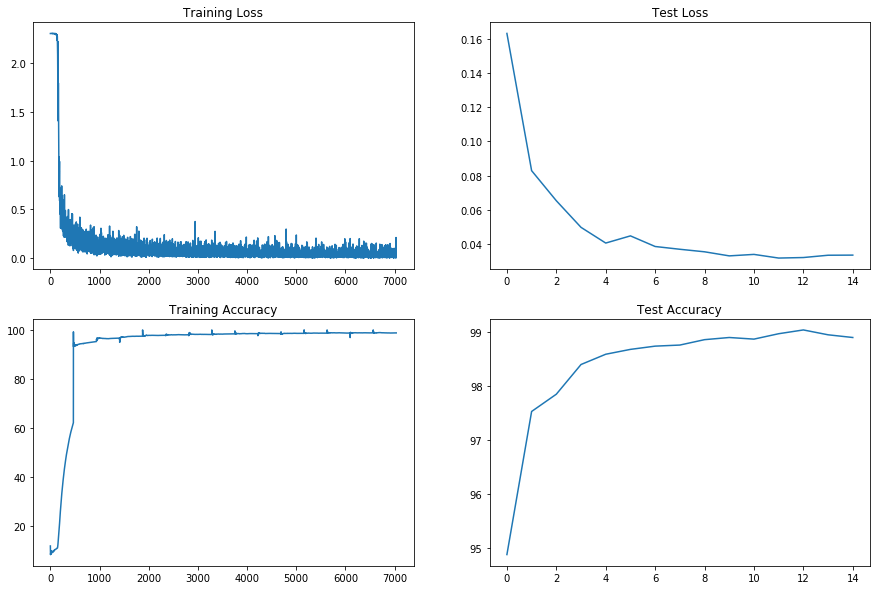

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
#less accuracy 
from torch.optim.lr_scheduler import StepLR 
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.7, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # gamma = decaying factor
EPOCHS = 15
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())



  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

Loss=2.4849443435668945 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.4849443435668945 Batch_id=0 Accuracy=8.59:   0%|          | 1/469 [00:00<02:43,  2.87it/s]
Loss=3.066664218902588 Batch_id=1 Accuracy=7.03:   0%|          | 1/469 [00:00<02:43,  2.87it/s] 
Loss=3.8359861373901367 Batch_id=2 Accuracy=6.77:   0%|          | 1/469 [00:00<02:43,  2.87it/s]
Loss=6.256292819976807 B

Epoch: 0 LR: [0.7]
Epoch: 0 LR: [0.7]
Epoch: 0 LR: [0.7]
Epoch: 0 LR: [0.7]
Epoch: 0 LR: [0.7]
Epoch: 0 LR: [0.006999999999999999]
Epoch: 0 LR: [0.06999999999999999]


Loss=5.195709705352783 Batch_id=6 Accuracy=15.85:   1%|          | 5/469 [00:00<01:57,  3.95it/s] 
Loss=4.765033721923828 Batch_id=7 Accuracy=20.02:   1%|          | 5/469 [00:00<01:57,  3.95it/s]
Loss=4.765033721923828 Batch_id=7 Accuracy=20.02:   2%|▏         | 8/469 [00:00<01:26,  5.32it/s]
Loss=5.922443866729736 Batch_id=8 Accuracy=21.53:   2%|▏         | 8/469 [00:00<01:26,  5.32it/s]
Loss=3.6563944816589355 Batch_id=9 Accuracy=24.14:   2%|▏         | 8/469 [00:00<01:26,  5.32it/s]
Loss=4.507133960723877 Batch_id=10 Accuracy=25.71:   2%|▏         | 8/469 [00:00<01:26,  5.32it/s]
Loss=2.9594128131866455 Batch_id=11 Accuracy=27.99:   2%|▏         | 8/469 [00:00<01:26,  5.32it/s]
Loss=2.9594128131866455 Batch_id=11 Accuracy=27.99:   3%|▎         | 12/469 [00:00<01:04,  7.10it/s]
Loss=3.9348533153533936 Batch_id=12 Accuracy=30.23:   3%|▎         | 12/469 [00:00<01:04,  7.10it/s]

Epoch: 0 LR: [0.06999999999999999]
Epoch: 0 LR: [0.06999999999999999]
Epoch: 0 LR: [0.06999999999999999]
Epoch: 0 LR: [0.06999999999999999]
Epoch: 0 LR: [0.0007]
Epoch: 0 LR: [0.006999999999999999]
Epoch: 0 LR: [0.006999999999999999]



Loss=3.8675968647003174 Batch_id=13 Accuracy=31.58:   3%|▎         | 12/469 [00:00<01:04,  7.10it/s]
Loss=3.302597999572754 Batch_id=14 Accuracy=33.07:   3%|▎         | 12/469 [00:00<01:04,  7.10it/s] 
Loss=2.5086631774902344 Batch_id=15 Accuracy=34.57:   3%|▎         | 12/469 [00:00<01:04,  7.10it/s]
Loss=2.5086631774902344 Batch_id=15 Accuracy=34.57:   3%|▎         | 16/469 [00:00<00:48,  9.29it/s]
Loss=2.6677889823913574 Batch_id=16 Accuracy=35.80:   3%|▎         | 16/469 [00:00<00:48,  9.29it/s]
Loss=1.5748447179794312 Batch_id=17 Accuracy=37.59:   3%|▎         | 16/469 [00:00<00:48,  9.29it/s]
Loss=1.6253036260604858 Batch_id=18 Accuracy=39.23:   3%|▎         | 16/469 [00:00<00:48,  9.29it/s]
Loss=1.6253036260604858 Batch_id=18 Accuracy=39.23:   4%|▍         | 19/469 [00:00<00:39, 11.40it/s]

Epoch: 0 LR: [0.006999999999999999]
Epoch: 0 LR: [0.006999999999999999]
Epoch: 0 LR: [0.006999999999999999]
Epoch: 0 LR: [7.000000000000001e-05]
Epoch: 0 LR: [0.0007]
Epoch: 0 LR: [0.0007]



Loss=2.5945277214050293 Batch_id=19 Accuracy=40.23:   4%|▍         | 19/469 [00:00<00:39, 11.40it/s]
Loss=2.4497172832489014 Batch_id=20 Accuracy=40.96:   4%|▍         | 19/469 [00:01<00:39, 11.40it/s]
Loss=1.841411828994751 Batch_id=21 Accuracy=42.29:   4%|▍         | 19/469 [00:01<00:39, 11.40it/s] 
Loss=1.841411828994751 Batch_id=21 Accuracy=42.29:   5%|▍         | 22/469 [00:01<00:32, 13.70it/s]
Loss=1.9799243211746216 Batch_id=22 Accuracy=43.10:   5%|▍         | 22/469 [00:01<00:32, 13.70it/s]
Loss=2.269218921661377 Batch_id=23 Accuracy=43.91:   5%|▍         | 22/469 [00:01<00:32, 13.70it/s] 
Loss=1.8695731163024902 Batch_id=24 Accuracy=44.62:   5%|▍         | 22/469 [00:01<00:32, 13.70it/s]
Loss=1.8695731163024902 Batch_id=24 Accuracy=44.62:   5%|▌         | 25/469 [00:01<00:27, 16.35it/s]
Loss=2.514679193496704 Batch_id=25 Accuracy=45.25:   5%|▌         | 25/469 [00:01<00:27, 16.35it/s] 

Epoch: 0 LR: [0.0007]
Epoch: 0 LR: [0.0007]
Epoch: 0 LR: [0.0007]
Epoch: 0 LR: [7.000000000000001e-06]
Epoch: 0 LR: [7.000000000000001e-05]
Epoch: 0 LR: [7.000000000000001e-05]



Loss=1.650280237197876 Batch_id=26 Accuracy=45.75:   5%|▌         | 25/469 [00:01<00:27, 16.35it/s]
Loss=2.1616368293762207 Batch_id=27 Accuracy=46.37:   5%|▌         | 25/469 [00:01<00:27, 16.35it/s]
Loss=2.1616368293762207 Batch_id=27 Accuracy=46.37:   6%|▌         | 28/469 [00:01<00:23, 18.87it/s]
Loss=3.230181932449341 Batch_id=28 Accuracy=46.69:   6%|▌         | 28/469 [00:01<00:23, 18.87it/s] 
Loss=2.740389823913574 Batch_id=29 Accuracy=47.01:   6%|▌         | 28/469 [00:01<00:23, 18.87it/s]
Loss=1.7730703353881836 Batch_id=30 Accuracy=47.73:   6%|▌         | 28/469 [00:01<00:23, 18.87it/s]
Loss=2.3421337604522705 Batch_id=31 Accuracy=48.17:   6%|▌         | 28/469 [00:01<00:23, 18.87it/s]
Loss=2.3421337604522705 Batch_id=31 Accuracy=48.17:   7%|▋         | 32/469 [00:01<00:20, 21.79it/s]

Epoch: 0 LR: [7.000000000000001e-05]
Epoch: 0 LR: [7.000000000000001e-05]
Epoch: 0 LR: [7.000000000000001e-05]
Epoch: 0 LR: [7.000000000000001e-07]
Epoch: 0 LR: [7.000000000000001e-06]
Epoch: 0 LR: [7.000000000000001e-06]
Epoch: 0 LR: [7.000000000000001e-06]



Loss=1.6164685487747192 Batch_id=32 Accuracy=48.77:   7%|▋         | 32/469 [00:01<00:20, 21.79it/s]
Loss=2.0990395545959473 Batch_id=33 Accuracy=49.10:   7%|▋         | 32/469 [00:01<00:20, 21.79it/s]
Loss=2.0187065601348877 Batch_id=34 Accuracy=49.62:   7%|▋         | 32/469 [00:01<00:20, 21.79it/s]
Loss=2.0187065601348877 Batch_id=34 Accuracy=49.62:   7%|▋         | 35/469 [00:01<00:19, 22.72it/s]
Loss=2.0375490188598633 Batch_id=35 Accuracy=49.89:   7%|▋         | 35/469 [00:01<00:19, 22.72it/s]
Loss=2.111130475997925 Batch_id=36 Accuracy=50.21:   7%|▋         | 35/469 [00:01<00:19, 22.72it/s] 
Loss=1.9938955307006836 Batch_id=37 Accuracy=50.66:   7%|▋         | 35/469 [00:01<00:19, 22.72it/s]
Loss=2.494917631149292 Batch_id=38 Accuracy=50.90:   7%|▋         | 35/469 [00:01<00:19, 22.72it/s] 
Loss=2.494917631149292 Batch_id=38 Accuracy=50.90:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]

Epoch: 0 LR: [7.000000000000001e-06]
Epoch: 0 LR: [7.000000000000001e-06]
Epoch: 0 LR: [7e-08]
Epoch: 0 LR: [7.000000000000001e-07]
Epoch: 0 LR: [7.000000000000001e-07]
Epoch: 0 LR: [7.000000000000001e-07]
Epoch:


Loss=1.8897193670272827 Batch_id=39 Accuracy=51.25:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=1.6678855419158936 Batch_id=40 Accuracy=51.68:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=1.6460440158843994 Batch_id=41 Accuracy=51.99:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=2.2494590282440186 Batch_id=42 Accuracy=52.18:   8%|▊         | 39/469 [00:01<00:17, 24.49it/s]
Loss=2.2494590282440186 Batch_id=42 Accuracy=52.18:   9%|▉         | 43/469 [00:01<00:16, 26.53it/s]
Loss=2.4566650390625 Batch_id=43 Accuracy=52.38:   9%|▉         | 43/469 [00:01<00:16, 26.53it/s]   
Loss=2.772441864013672 Batch_id=44 Accuracy=52.41:   9%|▉         | 43/469 [00:01<00:16, 26.53it/s]
Loss=2.6479218006134033 Batch_id=45 Accuracy=52.50:   9%|▉         | 43/469 [00:01<00:16, 26.53it/s]

 0 LR: [7.000000000000001e-07]
Epoch: 0 LR: [7.000000000000001e-07]
Epoch: 0 LR: [7.000000000000001e-09]
Epoch: 0 LR: [7e-08]
Epoch: 0 LR: [7e-08]
Epoch: 0 LR: [7e-08]
Epoch: 0 LR: [7e-08]



Loss=2.3362855911254883 Batch_id=46 Accuracy=52.71:   9%|▉         | 43/469 [00:01<00:16, 26.53it/s]
Loss=2.3362855911254883 Batch_id=46 Accuracy=52.71:  10%|█         | 47/469 [00:01<00:15, 27.52it/s]
Loss=2.364912748336792 Batch_id=47 Accuracy=52.85:  10%|█         | 47/469 [00:01<00:15, 27.52it/s] 
Loss=1.8816843032836914 Batch_id=48 Accuracy=53.03:  10%|█         | 47/469 [00:01<00:15, 27.52it/s]
Loss=1.815314531326294 Batch_id=49 Accuracy=53.30:  10%|█         | 47/469 [00:01<00:15, 27.52it/s] 
Loss=1.815314531326294 Batch_id=49 Accuracy=53.30:  11%|█         | 50/469 [00:01<00:14, 28.04it/s]
Loss=2.5127620697021484 Batch_id=50 Accuracy=53.45:  11%|█         | 50/469 [00:02<00:14, 28.04it/s]
Loss=2.4885106086730957 Batch_id=51 Accuracy=53.53:  11%|█         | 50/469 [00:02<00:14, 28.04it/s]

Epoch: 0 LR: [7e-08]
Epoch: 0 LR: [7.000000000000001e-10]
Epoch: 0 LR: [7.000000000000001e-09]
Epoch: 0 LR: [7.000000000000001e-09]
Epoch: 0 LR: [7.000000000000001e-09]
Epoch: 0 LR: [7.000000000000001e-09]
Epoch: 


Loss=2.103851318359375 Batch_id=52 Accuracy=53.64:  11%|█         | 50/469 [00:02<00:14, 28.04it/s] 
Loss=2.103851318359375 Batch_id=52 Accuracy=53.64:  11%|█▏        | 53/469 [00:02<00:14, 28.28it/s]
Loss=1.8769699335098267 Batch_id=53 Accuracy=53.78:  11%|█▏        | 53/469 [00:02<00:14, 28.28it/s]
Loss=1.8527604341506958 Batch_id=54 Accuracy=54.01:  11%|█▏        | 53/469 [00:02<00:14, 28.28it/s]
Loss=1.3234691619873047 Batch_id=55 Accuracy=54.30:  11%|█▏        | 53/469 [00:02<00:14, 28.28it/s]
Loss=1.3234691619873047 Batch_id=55 Accuracy=54.30:  12%|█▏        | 56/469 [00:02<00:14, 27.79it/s]
Loss=2.179901123046875 Batch_id=56 Accuracy=54.40:  12%|█▏        | 56/469 [00:02<00:14, 27.79it/s] 
Loss=1.9232606887817383 Batch_id=57 Accuracy=54.54:  12%|█▏        | 56/469 [00:02<00:14, 27.79it/s]

0 LR: [7.000000000000001e-09]
Epoch: 0 LR: [7.000000000000002e-11]
Epoch: 0 LR: [7.000000000000001e-10]
Epoch: 0 LR: [7.000000000000001e-10]
Epoch: 0 LR: [7.000000000000001e-10]
Epoch: 0 LR: [7.000000000000001e-10]



Loss=1.8798725605010986 Batch_id=58 Accuracy=54.73:  12%|█▏        | 56/469 [00:02<00:14, 27.79it/s]
Loss=1.8798725605010986 Batch_id=58 Accuracy=54.73:  13%|█▎        | 59/469 [00:02<00:14, 28.03it/s]
Loss=2.565704107284546 Batch_id=59 Accuracy=54.90:  13%|█▎        | 59/469 [00:02<00:14, 28.03it/s] 
Loss=2.2412033081054688 Batch_id=60 Accuracy=54.97:  13%|█▎        | 59/469 [00:02<00:14, 28.03it/s]
Loss=1.970618486404419 Batch_id=61 Accuracy=55.25:  13%|█▎        | 59/469 [00:02<00:14, 28.03it/s] 
Loss=2.121912956237793 Batch_id=62 Accuracy=55.36:  13%|█▎        | 59/469 [00:02<00:14, 28.03it/s]
Loss=2.121912956237793 Batch_id=62 Accuracy=55.36:  13%|█▎        | 63/469 [00:02<00:13, 29.09it/s]
Loss=2.728334903717041 Batch_id=63 Accuracy=55.51:  13%|█▎        | 63/469 [00:02<00:13, 29.09it/s]
Loss=2.2958717346191406 Batch_id=64 Accuracy=55.65:  13%|█▎        | 63/469 [00:02<00:13, 29.09it/s]

Epoch: 0 LR: [7.000000000000001e-10]
Epoch: 0 LR: [7.000000000000002e-12]
Epoch: 0 LR: [7.000000000000002e-11]
Epoch: 0 LR: [7.000000000000002e-11]
Epoch: 0 LR: [7.000000000000002e-11]
Epoch: 0 LR: [7.000000000000002e-11]
Epoch: 0 LR: [7.000000000000002e-11]



Loss=2.337034225463867 Batch_id=65 Accuracy=55.72:  13%|█▎        | 63/469 [00:02<00:13, 29.09it/s] 
Loss=1.7449084520339966 Batch_id=66 Accuracy=55.82:  13%|█▎        | 63/469 [00:02<00:13, 29.09it/s]
Loss=1.7449084520339966 Batch_id=66 Accuracy=55.82:  14%|█▍        | 67/469 [00:02<00:13, 30.20it/s]
Loss=1.6222680807113647 Batch_id=67 Accuracy=55.95:  14%|█▍        | 67/469 [00:02<00:13, 30.20it/s]
Loss=2.374992847442627 Batch_id=68 Accuracy=56.00:  14%|█▍        | 67/469 [00:02<00:13, 30.20it/s] 
Loss=2.3628625869750977 Batch_id=69 Accuracy=56.13:  14%|█▍        | 67/469 [00:02<00:13, 30.20it/s]
Loss=2.2709598541259766 Batch_id=70 Accuracy=56.17:  14%|█▍        | 67/469 [00:02<00:13, 30.20it/s]
Loss=2.2709598541259766 Batch_id=70 Accuracy=56.17:  15%|█▌        | 71/469 [00:02<00:12, 31.25it/s]
Loss=2.227973699569702 Batch_id=71 Accuracy=56.23:  15%|█▌        | 71/469 [00:02<00:12, 31.25it/s] 

Epoch: 0 LR: [7.000000000000002e-13]
Epoch: 0 LR: [7.000000000000002e-12]
Epoch: 0 LR: [7.000000000000002e-12]
Epoch: 0 LR: [7.000000000000002e-12]
Epoch: 0 LR: [7.000000000000002e-12]
Epoch: 0 LR: [7.000000000000002e-12]
Epoch: 0 LR: [7.000000000000003e-14]



Loss=2.844857692718506 Batch_id=72 Accuracy=56.23:  15%|█▌        | 71/469 [00:02<00:12, 31.25it/s]
Loss=2.5621724128723145 Batch_id=73 Accuracy=56.22:  15%|█▌        | 71/469 [00:02<00:12, 31.25it/s]
Loss=1.860153079032898 Batch_id=74 Accuracy=56.33:  15%|█▌        | 71/469 [00:02<00:12, 31.25it/s] 
Loss=1.6879194974899292 Batch_id=75 Accuracy=56.48:  15%|█▌        | 71/469 [00:02<00:12, 31.25it/s]
Loss=1.6879194974899292 Batch_id=75 Accuracy=56.48:  16%|█▌        | 76/469 [00:02<00:11, 33.29it/s]
Loss=2.6017401218414307 Batch_id=76 Accuracy=56.62:  16%|█▌        | 76/469 [00:02<00:11, 33.29it/s]
Loss=2.1207761764526367 Batch_id=77 Accuracy=56.77:  16%|█▌        | 76/469 [00:02<00:11, 33.29it/s]
Loss=1.9171921014785767 Batch_id=78 Accuracy=56.94:  16%|█▌        | 76/469 [00:02<00:11, 33.29it/s]

Epoch: 0 LR: [7.000000000000002e-13]
Epoch: 0 LR: [7.000000000000002e-13]
Epoch: 0 LR: [7.000000000000002e-13]
Epoch: 0 LR: [7.000000000000002e-13]
Epoch: 0 LR: [7.000000000000002e-13]
Epoch: 0 LR: [7.000000000000003e-15]
Epoch: 0 LR: [7.000000000000003e-14]
Epoch:


Loss=1.903822660446167 Batch_id=79 Accuracy=57.05:  16%|█▌        | 76/469 [00:02<00:11, 33.29it/s] 
Loss=1.903822660446167 Batch_id=79 Accuracy=57.05:  17%|█▋        | 80/469 [00:02<00:11, 32.78it/s]
Loss=2.2708239555358887 Batch_id=80 Accuracy=57.09:  17%|█▋        | 80/469 [00:02<00:11, 32.78it/s]
Loss=2.2372138500213623 Batch_id=81 Accuracy=57.07:  17%|█▋        | 80/469 [00:02<00:11, 32.78it/s]
Loss=1.8245460987091064 Batch_id=82 Accuracy=57.13:  17%|█▋        | 80/469 [00:03<00:11, 32.78it/s]
Loss=2.0357635021209717 Batch_id=83 Accuracy=57.25:  17%|█▋        | 80/469 [00:03<00:11, 32.78it/s]
Loss=2.255622148513794 Batch_id=84 Accuracy=57.27:  17%|█▋        | 80/469 [00:03<00:11, 32.78it/s] 
Loss=2.255622148513794 Batch_id=84 Accuracy=57.27:  18%|█▊        | 85/469 [00:03<00:11, 34.58it/s]
Loss=2.689399003982544 Batch_id=85 Accuracy=57.37:  18%|█▊        | 85/469 [00:03<00:11, 34.58it/s]
Loss=2.0504026412963867 Batch_id=86 Accuracy=57.40:  18%|█▊        | 85/469 [00:03<00:11, 34.

 0 LR: [7.000000000000003e-14]
Epoch: 0 LR: [7.000000000000003e-14]
Epoch: 0 LR: [7.000000000000003e-14]
Epoch: 0 LR: [7.000000000000003e-14]
Epoch: 0 LR: [7.000000000000003e-16]
Epoch: 0 LR: [7.000000000000003e-15]
Epoch: 0 LR: [7.000000000000003e-15]
Epoch: 0 LR: [7.000000000000003e-15]
Epoch: 0 LR: [7.000000000000003e-15]



Loss=2.090033531188965 Batch_id=87 Accuracy=57.51:  18%|█▊        | 85/469 [00:03<00:11, 34.58it/s] 
Loss=1.7259125709533691 Batch_id=88 Accuracy=57.65:  18%|█▊        | 85/469 [00:03<00:11, 34.58it/s]
Loss=1.7259125709533691 Batch_id=88 Accuracy=57.65:  19%|█▉        | 89/469 [00:03<00:10, 35.85it/s]
Loss=2.567080020904541 Batch_id=89 Accuracy=57.72:  19%|█▉        | 89/469 [00:03<00:10, 35.85it/s] 
Loss=2.382122278213501 Batch_id=90 Accuracy=57.78:  19%|█▉        | 89/469 [00:03<00:10, 35.85it/s]
Loss=2.7291109561920166 Batch_id=91 Accuracy=57.79:  19%|█▉        | 89/469 [00:03<00:10, 35.85it/s]
Loss=2.0656542778015137 Batch_id=92 Accuracy=57.84:  19%|█▉        | 89/469 [00:03<00:10, 35.85it/s]
Loss=2.0656542778015137 Batch_id=92 Accuracy=57.84:  20%|█▉        | 93/469 [00:03<00:10, 34.73it/s]
Loss=1.692559003829956 Batch_id=93 Accuracy=57.91:  20%|█▉        | 93/469 [00:03<00:10, 34.73it/s] 
Loss=1.8359723091125488 Batch_id=94 Accuracy=58.01:  20%|█▉        | 93/469 [00:03<00:10, 3

Epoch: 0 LR: [7.000000000000003e-15]
Epoch: 0 LR: [7.000000000000004e-17]
Epoch: 0 LR: [7.000000000000003e-16]
Epoch: 0 LR: [7.000000000000003e-16]
Epoch: 0 LR: [7.000000000000003e-16]
Epoch: 0 LR: [7.000000000000003e-16]
Epoch: 0 LR: [7.000000000000003e-16]



Loss=2.109736680984497 Batch_id=95 Accuracy=58.06:  20%|█▉        | 93/469 [00:03<00:10, 34.73it/s] 
Loss=2.049243450164795 Batch_id=96 Accuracy=58.09:  20%|█▉        | 93/469 [00:03<00:10, 34.73it/s]
Loss=2.049243450164795 Batch_id=96 Accuracy=58.09:  21%|██        | 97/469 [00:03<00:10, 34.72it/s]
Loss=2.0464775562286377 Batch_id=97 Accuracy=58.12:  21%|██        | 97/469 [00:03<00:10, 34.72it/s]
Loss=1.9949703216552734 Batch_id=98 Accuracy=58.21:  21%|██        | 97/469 [00:03<00:10, 34.72it/s]
Loss=1.4740922451019287 Batch_id=99 Accuracy=58.29:  21%|██        | 97/469 [00:03<00:10, 34.72it/s]
Loss=2.1402804851531982 Batch_id=100 Accuracy=58.37:  21%|██        | 97/469 [00:03<00:10, 34.72it/s]
Loss=2.1402804851531982 Batch_id=100 Accuracy=58.37:  22%|██▏       | 101/469 [00:03<00:11, 33.43it/s]

Epoch: 0 LR: [7.000000000000004e-18]
Epoch: 0 LR: [7.000000000000004e-17]
Epoch: 0 LR: [7.000000000000004e-17]
Epoch: 0 LR: [7.000000000000004e-17]
Epoch: 0 LR: [7.000000000000004e-17]
Epoch: 0 LR: [7.000000000000004e-17]
Epoch: 


Loss=2.69236159324646 Batch_id=101 Accuracy=58.34:  22%|██▏       | 101/469 [00:03<00:11, 33.43it/s]  
Loss=1.8300906419754028 Batch_id=102 Accuracy=58.34:  22%|██▏       | 101/469 [00:03<00:11, 33.43it/s]
Loss=1.7782461643218994 Batch_id=103 Accuracy=58.42:  22%|██▏       | 101/469 [00:03<00:11, 33.43it/s]
Loss=2.074528694152832 Batch_id=104 Accuracy=58.49:  22%|██▏       | 101/469 [00:03<00:11, 33.43it/s] 
Loss=2.074528694152832 Batch_id=104 Accuracy=58.49:  22%|██▏       | 105/469 [00:03<00:11, 30.87it/s]
Loss=1.9775375127792358 Batch_id=105 Accuracy=58.56:  22%|██▏       | 105/469 [00:03<00:11, 30.87it/s]

0 LR: [7.000000000000005e-19]
Epoch: 0 LR: [7.000000000000004e-18]
Epoch: 0 LR: [7.000000000000004e-18]
Epoch: 0 LR: [7.000000000000004e-18]
Epoch: 0 LR: [7.000000000000004e-18]



Loss=2.146956205368042 Batch_id=106 Accuracy=58.57:  22%|██▏       | 105/469 [00:03<00:11, 30.87it/s] 
Loss=1.5234540700912476 Batch_id=107 Accuracy=58.64:  22%|██▏       | 105/469 [00:03<00:11, 30.87it/s]
Loss=1.9279816150665283 Batch_id=108 Accuracy=58.67:  22%|██▏       | 105/469 [00:03<00:11, 30.87it/s]
Loss=1.9279816150665283 Batch_id=108 Accuracy=58.67:  23%|██▎       | 109/469 [00:03<00:11, 31.33it/s]
Loss=1.9286272525787354 Batch_id=109 Accuracy=58.71:  23%|██▎       | 109/469 [00:03<00:11, 31.33it/s]
Loss=2.271854877471924 Batch_id=110 Accuracy=58.78:  23%|██▎       | 109/469 [00:03<00:11, 31.33it/s] 
Loss=2.3735244274139404 Batch_id=111 Accuracy=58.82:  23%|██▎       | 109/469 [00:03<00:11, 31.33it/s]
Loss=2.292875051498413 Batch_id=112 Accuracy=58.84:  23%|██▎       | 109/469 [00:03<00:11, 31.33it/s] 


Epoch: 0 LR: [7.000000000000004e-18]
Epoch: 0 LR: [7.000000000000006e-20]
Epoch: 0 LR: [7.000000000000005e-19]
Epoch: 0 LR: [7.000000000000005e-19]
Epoch: 0 LR: [7.000000000000005e-19]
Epoch: 0 LR: [7.000000000000005e-19]
Epoch: 0 LR: [7.000000000000005e-19]


Loss=2.292875051498413 Batch_id=112 Accuracy=58.84:  24%|██▍       | 113/469 [00:03<00:11, 29.90it/s]
Loss=2.421574592590332 Batch_id=113 Accuracy=58.87:  24%|██▍       | 113/469 [00:03<00:11, 29.90it/s]
Loss=1.2437324523925781 Batch_id=114 Accuracy=58.99:  24%|██▍       | 113/469 [00:04<00:11, 29.90it/s]
Loss=1.7224345207214355 Batch_id=115 Accuracy=59.00:  24%|██▍       | 113/469 [00:04<00:11, 29.90it/s]
Loss=1.8663114309310913 Batch_id=116 Accuracy=59.06:  24%|██▍       | 113/469 [00:04<00:11, 29.90it/s]
Loss=1.8663114309310913 Batch_id=116 Accuracy=59.06:  25%|██▍       | 117/469 [00:04<00:11, 31.08it/s]
Loss=1.3835313320159912 Batch_id=117 Accuracy=59.16:  25%|██▍       | 117/469 [00:04<00:11, 31.08it/s]
Loss=2.259636163711548 Batch_id=118 Accuracy=59.20:  25%|██▍       | 117/469 [00:04<00:11, 31.08it/s] 
Loss=2.1963038444519043 Batch_id=119 Accuracy=59.23:  25%|██▍       | 117/469 [00:04<00:11, 31.08it/s]
Loss=2.1438019275665283 Batch_id=120 Accuracy=59.27:  25%|██▍       | 117/4

Epoch: 0 LR: [7.000000000000007e-21]
Epoch: 0 LR: [7.000000000000006e-20]
Epoch: 0 LR: [7.000000000000006e-20]
Epoch: 0 LR: [7.000000000000006e-20]
Epoch: 0 LR: [7.000000000000006e-20]
Epoch: 0 LR: [7.000000000000006e-20]
Epoch: 0 LR: [7.000000000000007e-22]
Epoch: 0 LR: [7.000000000000007e-21]



Loss=2.096703290939331 Batch_id=121 Accuracy=59.29:  25%|██▍       | 117/469 [00:04<00:11, 31.08it/s] 
Loss=2.096703290939331 Batch_id=121 Accuracy=59.29:  26%|██▌       | 122/469 [00:04<00:10, 34.06it/s]
Loss=2.4563591480255127 Batch_id=122 Accuracy=59.32:  26%|██▌       | 122/469 [00:04<00:10, 34.06it/s]
Loss=1.8745379447937012 Batch_id=123 Accuracy=59.39:  26%|██▌       | 122/469 [00:04<00:10, 34.06it/s]
Loss=2.4441418647766113 Batch_id=124 Accuracy=59.38:  26%|██▌       | 122/469 [00:04<00:10, 34.06it/s]
Loss=1.783633828163147 Batch_id=125 Accuracy=59.41:  26%|██▌       | 122/469 [00:04<00:10, 34.06it/s] 
Loss=1.783633828163147 Batch_id=125 Accuracy=59.41:  27%|██▋       | 126/469 [00:04<00:10, 31.55it/s]
Loss=1.8356540203094482 Batch_id=126 Accuracy=59.44:  27%|██▋       | 126/469 [00:04<00:10, 31.55it/s]

Epoch: 0 LR: [7.000000000000007e-21]
Epoch: 0 LR: [7.000000000000007e-21]
Epoch: 0 LR: [7.000000000000007e-21]
Epoch: 0 LR: [7.000000000000007e-21]
Epoch: 0 LR: [7.000000000000007e-23]
Epoch: 0 LR: [7.000000000000007e-22]



Loss=2.213702917098999 Batch_id=127 Accuracy=59.48:  27%|██▋       | 126/469 [00:04<00:10, 31.55it/s] 
Loss=1.6040254831314087 Batch_id=128 Accuracy=59.53:  27%|██▋       | 126/469 [00:04<00:10, 31.55it/s]
Loss=2.383605480194092 Batch_id=129 Accuracy=59.52:  27%|██▋       | 126/469 [00:04<00:10, 31.55it/s] 
Loss=2.383605480194092 Batch_id=129 Accuracy=59.52:  28%|██▊       | 130/469 [00:04<00:11, 29.71it/s]
Loss=2.2308337688446045 Batch_id=130 Accuracy=59.52:  28%|██▊       | 130/469 [00:04<00:11, 29.71it/s]
Loss=1.7961413860321045 Batch_id=131 Accuracy=59.56:  28%|██▊       | 130/469 [00:04<00:11, 29.71it/s]
Loss=1.7739431858062744 Batch_id=132 Accuracy=59.60:  28%|██▊       | 130/469 [00:04<00:11, 29.71it/s]

Epoch: 0 LR: [7.000000000000007e-22]
Epoch: 0 LR: [7.000000000000007e-22]
Epoch: 0 LR: [7.000000000000007e-22]
Epoch: 0 LR: [7.000000000000007e-22]
Epoch: 0 LR: [7.000000000000007e-24]
Epoch: 0 LR: [7.000000000000007e-23]
Epoch:


Loss=1.9647682905197144 Batch_id=133 Accuracy=59.65:  28%|██▊       | 130/469 [00:04<00:11, 29.71it/s]
Loss=1.9647682905197144 Batch_id=133 Accuracy=59.65:  29%|██▊       | 134/469 [00:04<00:10, 30.61it/s]
Loss=1.990830659866333 Batch_id=134 Accuracy=59.69:  29%|██▊       | 134/469 [00:04<00:10, 30.61it/s] 
Loss=2.802793264389038 Batch_id=135 Accuracy=59.69:  29%|██▊       | 134/469 [00:04<00:10, 30.61it/s]
Loss=1.9786643981933594 Batch_id=136 Accuracy=59.69:  29%|██▊       | 134/469 [00:04<00:10, 30.61it/s]
Loss=2.447347640991211 Batch_id=137 Accuracy=59.72:  29%|██▊       | 134/469 [00:04<00:10, 30.61it/s] 
Loss=2.7143187522888184 Batch_id=138 Accuracy=59.68:  29%|██▊       | 134/469 [00:04<00:10, 30.61it/s]
Loss=2.7143187522888184 Batch_id=138 Accuracy=59.68:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=1.7578942775726318 Batch_id=139 Accuracy=59.72:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=2.510422706604004 Batch_id=140 Accuracy=59.72:  30%|██▉       | 139/

 0 LR: [7.000000000000007e-23]
Epoch: 0 LR: [7.000000000000007e-23]
Epoch: 0 LR: [7.000000000000007e-23]
Epoch: 0 LR: [7.000000000000007e-23]
Epoch: 0 LR: [7.000000000000007e-25]
Epoch: 0 LR: [7.000000000000007e-24]
Epoch: 0 LR: [7.000000000000007e-24]
Epoch: 0 LR: [7.000000000000007e-24]
Epoch: 0 LR: [7.000000000000007e-24]
Epoch: 0 LR: [7.000000000000007e-24]



Loss=2.4221439361572266 Batch_id=142 Accuracy=59.76:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s]
Loss=1.873764157295227 Batch_id=143 Accuracy=59.79:  30%|██▉       | 139/469 [00:04<00:09, 33.84it/s] 
Loss=1.873764157295227 Batch_id=143 Accuracy=59.79:  31%|███       | 144/469 [00:04<00:08, 36.27it/s]
Loss=2.248941659927368 Batch_id=144 Accuracy=59.81:  31%|███       | 144/469 [00:04<00:08, 36.27it/s]
Loss=2.192922830581665 Batch_id=145 Accuracy=59.84:  31%|███       | 144/469 [00:04<00:08, 36.27it/s]
Loss=1.6723116636276245 Batch_id=146 Accuracy=59.86:  31%|███       | 144/469 [00:04<00:08, 36.27it/s]
Loss=2.457728624343872 Batch_id=147 Accuracy=59.88:  31%|███       | 144/469 [00:04<00:08, 36.27it/s] 
Loss=2.457728624343872 Batch_id=147 Accuracy=59.88:  32%|███▏      | 148/469 [00:04<00:09, 33.43it/s]

Epoch: 0 LR: [7.000000000000008e-26]
Epoch: 0 LR: [7.000000000000007e-25]
Epoch: 0 LR: [7.000000000000007e-25]
Epoch: 0 LR: [7.000000000000007e-25]
Epoch: 0 LR: [7.000000000000007e-25]
Epoch: 0 LR: [7.000000000000007e-25]



Loss=2.0781137943267822 Batch_id=148 Accuracy=59.90:  32%|███▏      | 148/469 [00:05<00:09, 33.43it/s]
Loss=2.3349220752716064 Batch_id=149 Accuracy=59.87:  32%|███▏      | 148/469 [00:05<00:09, 33.43it/s]
Loss=2.4098668098449707 Batch_id=150 Accuracy=59.86:  32%|███▏      | 148/469 [00:05<00:09, 33.43it/s]
Loss=2.087345838546753 Batch_id=151 Accuracy=59.87:  32%|███▏      | 148/469 [00:05<00:09, 33.43it/s] 
Loss=2.087345838546753 Batch_id=151 Accuracy=59.87:  32%|███▏      | 152/469 [00:05<00:09, 31.82it/s]
Loss=1.439673900604248 Batch_id=152 Accuracy=59.91:  32%|███▏      | 152/469 [00:05<00:09, 31.82it/s]
Loss=1.9755860567092896 Batch_id=153 Accuracy=59.96:  32%|███▏      | 152/469 [00:05<00:09, 31.82it/s]
Loss=1.7987006902694702 Batch_id=154 Accuracy=60.01:  32%|███▏      | 152/469 [00:05<00:09, 31.82it/s]
Loss=2.655116081237793 Batch_id=155 Accuracy=59.98:  32%|███▏      | 152/469 [00:05<00:09, 31.82it/s] 
Loss=2.655116081237793 Batch_id=155 Accuracy=59.98:  33%|███▎      | 156/4

Epoch: 0 LR: [7.000000000000007e-27]
Epoch: 0 LR: [7.000000000000008e-26]
Epoch: 0 LR: [7.000000000000008e-26]
Epoch: 0 LR: [7.000000000000008e-26]
Epoch: 0 LR: [7.000000000000008e-26]
Epoch: 0 LR: [7.000000000000008e-26]
Epoch: 0 LR: [7.000000000000008e-28]
Epoch:


Loss=2.441124677658081 Batch_id=156 Accuracy=59.97:  33%|███▎      | 156/469 [00:05<00:09, 33.32it/s]
Loss=2.056675434112549 Batch_id=157 Accuracy=59.97:  33%|███▎      | 156/469 [00:05<00:09, 33.32it/s]
Loss=2.1310293674468994 Batch_id=158 Accuracy=59.99:  33%|███▎      | 156/469 [00:05<00:09, 33.32it/s]
Loss=1.5344749689102173 Batch_id=159 Accuracy=60.00:  33%|███▎      | 156/469 [00:05<00:09, 33.32it/s]
Loss=1.5344749689102173 Batch_id=159 Accuracy=60.00:  34%|███▍      | 160/469 [00:05<00:09, 33.87it/s]
Loss=1.891316294670105 Batch_id=160 Accuracy=60.05:  34%|███▍      | 160/469 [00:05<00:09, 33.87it/s] 
Loss=2.228685140609741 Batch_id=161 Accuracy=60.07:  34%|███▍      | 160/469 [00:05<00:09, 33.87it/s]

 0 LR: [7.000000000000007e-27]
Epoch: 0 LR: [7.000000000000007e-27]
Epoch: 0 LR: [7.000000000000007e-27]
Epoch: 0 LR: [7.000000000000007e-27]
Epoch: 0 LR: [7.000000000000007e-27]
Epoch: 0 LR: [7.000000000000008e-29]
Epoch:


Loss=3.115450382232666 Batch_id=162 Accuracy=60.09:  34%|███▍      | 160/469 [00:05<00:09, 33.87it/s]
Loss=1.6412376165390015 Batch_id=163 Accuracy=60.13:  34%|███▍      | 160/469 [00:05<00:09, 33.87it/s]
Loss=1.6412376165390015 Batch_id=163 Accuracy=60.13:  35%|███▍      | 164/469 [00:05<00:10, 30.28it/s]
Loss=1.90276038646698 Batch_id=164 Accuracy=60.16:  35%|███▍      | 164/469 [00:05<00:10, 30.28it/s]  
Loss=1.6630131006240845 Batch_id=165 Accuracy=60.16:  35%|███▍      | 164/469 [00:05<00:10, 30.28it/s]
Loss=1.4044641256332397 Batch_id=166 Accuracy=60.25:  35%|███▍      | 164/469 [00:05<00:10, 30.28it/s]
Loss=1.713580846786499 Batch_id=167 Accuracy=60.27:  35%|███▍      | 164/469 [00:05<00:10, 30.28it/s] 
Loss=1.713580846786499 Batch_id=167 Accuracy=60.27:  36%|███▌      | 168/469 [00:05<00:09, 30.97it/s]

 0 LR: [7.000000000000008e-28]
Epoch: 0 LR: [7.000000000000008e-28]
Epoch: 0 LR: [7.000000000000008e-28]
Epoch: 0 LR: [7.000000000000008e-28]
Epoch: 0 LR: [7.000000000000008e-28]
Epoch: 0 LR: [7.000000000000009e-30]
Epoch: 


Loss=2.2050466537475586 Batch_id=168 Accuracy=60.30:  36%|███▌      | 168/469 [00:05<00:09, 30.97it/s]
Loss=1.8665122985839844 Batch_id=169 Accuracy=60.36:  36%|███▌      | 168/469 [00:05<00:09, 30.97it/s]
Loss=2.121774435043335 Batch_id=170 Accuracy=60.38:  36%|███▌      | 168/469 [00:05<00:09, 30.97it/s] 
Loss=2.012462854385376 Batch_id=171 Accuracy=60.36:  36%|███▌      | 168/469 [00:05<00:09, 30.97it/s]
Loss=2.4277260303497314 Batch_id=172 Accuracy=60.39:  36%|███▌      | 168/469 [00:05<00:09, 30.97it/s]
Loss=2.4277260303497314 Batch_id=172 Accuracy=60.39:  37%|███▋      | 173/469 [00:05<00:08, 34.64it/s]
Loss=2.34031081199646 Batch_id=173 Accuracy=60.43:  37%|███▋      | 173/469 [00:05<00:08, 34.64it/s]  
Loss=2.0536320209503174 Batch_id=174 Accuracy=60.49:  37%|███▋      | 173/469 [00:05<00:08, 34.64it/s]
Loss=1.8747636079788208 Batch_id=175 Accuracy=60.51:  37%|███▋      | 173/469 [00:05<00:08, 34.64it/s]

0 LR: [7.000000000000008e-29]
Epoch: 0 LR: [7.000000000000008e-29]
Epoch: 0 LR: [7.000000000000008e-29]
Epoch: 0 LR: [7.000000000000008e-29]
Epoch: 0 LR: [7.000000000000008e-29]
Epoch: 0 LR: [7.000000000000009e-31]
Epoch: 0 LR: [7.000000000000009e-30]
Epoch: 0 LR: [7.000000000000009e-30]
Epoch: 0 LR: [7.000000000000009e-30]



Loss=1.6611660718917847 Batch_id=176 Accuracy=60.55:  37%|███▋      | 173/469 [00:05<00:08, 34.64it/s]
Loss=1.6611660718917847 Batch_id=176 Accuracy=60.55:  38%|███▊      | 177/469 [00:05<00:08, 34.10it/s]
Loss=2.4314868450164795 Batch_id=177 Accuracy=60.56:  38%|███▊      | 177/469 [00:05<00:08, 34.10it/s]
Loss=2.0515499114990234 Batch_id=178 Accuracy=60.59:  38%|███▊      | 177/469 [00:05<00:08, 34.10it/s]
Loss=3.367859125137329 Batch_id=179 Accuracy=60.54:  38%|███▊      | 177/469 [00:05<00:08, 34.10it/s] 
Loss=2.030240774154663 Batch_id=180 Accuracy=60.54:  38%|███▊      | 177/469 [00:05<00:08, 34.10it/s]
Loss=2.030240774154663 Batch_id=180 Accuracy=60.54:  39%|███▊      | 181/469 [00:05<00:08, 32.29it/s]
Loss=2.34500789642334 Batch_id=181 Accuracy=60.57:  39%|███▊      | 181/469 [00:06<00:08, 32.29it/s] 
Loss=2.5625979900360107 Batch_id=182 Accuracy=60.57:  39%|███▊      | 181/469 [00:06<00:08, 32.29it/s]
Loss=2.258699417114258 Batch_id=183 Accuracy=60.56:  39%|███▊      | 181/46

Epoch: 0 LR: [7.000000000000009e-30]
Epoch: 0 LR: [7.000000000000009e-30]
Epoch: 0 LR: [7.00000000000001e-32]
Epoch: 0 LR: [7.000000000000009e-31]
Epoch: 0 LR: [7.000000000000009e-31]
Epoch: 0 LR: [7.000000000000009e-31]
Epoch: 0 LR: [7.000000000000009e-31]



Loss=2.255795955657959 Batch_id=184 Accuracy=60.53:  39%|███▊      | 181/469 [00:06<00:08, 32.29it/s]
Loss=2.255795955657959 Batch_id=184 Accuracy=60.53:  39%|███▉      | 185/469 [00:06<00:08, 32.73it/s]
Loss=1.8142658472061157 Batch_id=185 Accuracy=60.56:  39%|███▉      | 185/469 [00:06<00:08, 32.73it/s]
Loss=1.344685435295105 Batch_id=186 Accuracy=60.62:  39%|███▉      | 185/469 [00:06<00:08, 32.73it/s] 
Loss=2.267655372619629 Batch_id=187 Accuracy=60.63:  39%|███▉      | 185/469 [00:06<00:08, 32.73it/s]
Loss=2.0318591594696045 Batch_id=188 Accuracy=60.64:  39%|███▉      | 185/469 [00:06<00:08, 32.73it/s]
Loss=2.0318591594696045 Batch_id=188 Accuracy=60.64:  40%|████      | 189/469 [00:06<00:08, 31.97it/s]
Loss=2.518751621246338 Batch_id=189 Accuracy=60.65:  40%|████      | 189/469 [00:06<00:08, 31.97it/s] 
Loss=1.8049978017807007 Batch_id=190 Accuracy=60.65:  40%|████      | 189/469 [00:06<00:08, 31.97it/s]
Loss=1.4065676927566528 Batch_id=191 Accuracy=60.69:  40%|████      | 189/4

Epoch: 0 LR: [7.000000000000009e-31]
Epoch: 0 LR: [7.000000000000009e-33]
Epoch: 0 LR: [7.00000000000001e-32]
Epoch: 0 LR: [7.00000000000001e-32]
Epoch: 0 LR: [7.00000000000001e-32]
Epoch: 0 LR: [7.00000000000001e-32]
Epoch: 0 LR: [7.00000000000001e-32]
Epoch: 0 LR: [7.00000000000001e-34]



Loss=2.239457845687866 Batch_id=192 Accuracy=60.69:  40%|████      | 189/469 [00:06<00:08, 31.97it/s] 
Loss=2.385128974914551 Batch_id=193 Accuracy=60.70:  40%|████      | 189/469 [00:06<00:08, 31.97it/s]
Loss=2.385128974914551 Batch_id=193 Accuracy=60.70:  41%|████▏     | 194/469 [00:06<00:08, 33.08it/s]
Loss=1.8813753128051758 Batch_id=194 Accuracy=60.73:  41%|████▏     | 194/469 [00:06<00:08, 33.08it/s]
Loss=1.865171194076538 Batch_id=195 Accuracy=60.74:  41%|████▏     | 194/469 [00:06<00:08, 33.08it/s] 
Loss=1.8249526023864746 Batch_id=196 Accuracy=60.76:  41%|████▏     | 194/469 [00:06<00:08, 33.08it/s]

Epoch: 0 LR: [7.000000000000009e-33]
Epoch: 0 LR: [7.000000000000009e-33]
Epoch: 0 LR: [7.000000000000009e-33]
Epoch: 0 LR: [7.000000000000009e-33]
Epoch: 0 LR: [7.000000000000009e-33]
Epoch: 0 LR: [7.000000000000011e-35]



Loss=2.365511417388916 Batch_id=197 Accuracy=60.78:  41%|████▏     | 194/469 [00:06<00:08, 33.08it/s] 
Loss=2.365511417388916 Batch_id=197 Accuracy=60.78:  42%|████▏     | 198/469 [00:06<00:08, 30.14it/s]
Loss=2.161095380783081 Batch_id=198 Accuracy=60.79:  42%|████▏     | 198/469 [00:06<00:08, 30.14it/s]
Loss=1.9848203659057617 Batch_id=199 Accuracy=60.82:  42%|████▏     | 198/469 [00:06<00:08, 30.14it/s]
Loss=2.189420700073242 Batch_id=200 Accuracy=60.83:  42%|████▏     | 198/469 [00:06<00:08, 30.14it/s] 
Loss=2.235304117202759 Batch_id=201 Accuracy=60.84:  42%|████▏     | 198/469 [00:06<00:08, 30.14it/s]
Loss=2.235304117202759 Batch_id=201 Accuracy=60.84:  43%|████▎     | 202/469 [00:06<00:08, 31.16it/s]
Loss=2.3040883541107178 Batch_id=202 Accuracy=60.84:  43%|████▎     | 202/469 [00:06<00:08, 31.16it/s]
Loss=2.236440658569336 Batch_id=203 Accuracy=60.85:  43%|████▎     | 202/469 [00:06<00:08, 31.16it/s] 
Loss=1.728070616722107 Batch_id=204 Accuracy=60.86:  43%|████▎     | 202/469

Epoch: 0 LR: [7.00000000000001e-34]
Epoch: 0 LR: [7.00000000000001e-34]
Epoch: 0 LR: [7.00000000000001e-34]
Epoch: 0 LR: [7.00000000000001e-34]
Epoch: 0 LR: [7.00000000000001e-34]
Epoch: 0 LR: [7.00000000000001e-36]
Epoch: 0 LR: [7.000000000000011e-35]



Loss=1.7612898349761963 Batch_id=205 Accuracy=60.88:  43%|████▎     | 202/469 [00:06<00:08, 31.16it/s]
Loss=1.7612898349761963 Batch_id=205 Accuracy=60.88:  44%|████▍     | 206/469 [00:06<00:08, 30.43it/s]
Loss=1.8094719648361206 Batch_id=206 Accuracy=60.91:  44%|████▍     | 206/469 [00:06<00:08, 30.43it/s]
Loss=2.538295030593872 Batch_id=207 Accuracy=60.95:  44%|████▍     | 206/469 [00:06<00:08, 30.43it/s] 
Loss=2.0475754737854004 Batch_id=208 Accuracy=60.98:  44%|████▍     | 206/469 [00:06<00:08, 30.43it/s]
Loss=1.8579201698303223 Batch_id=209 Accuracy=60.99:  44%|████▍     | 206/469 [00:06<00:08, 30.43it/s]
Loss=1.8579201698303223 Batch_id=209 Accuracy=60.99:  45%|████▍     | 210/469 [00:06<00:08, 30.35it/s]
Loss=2.1415696144104004 Batch_id=210 Accuracy=60.99:  45%|████▍     | 210/469 [00:06<00:08, 30.35it/s]
Loss=2.2293059825897217 Batch_id=211 Accuracy=60.99:  45%|████▍     | 210/469 [00:06<00:08, 30.35it/s]

Epoch: 0 LR: [7.000000000000011e-35]
Epoch: 0 LR: [7.000000000000011e-35]
Epoch: 0 LR: [7.000000000000011e-35]
Epoch: 0 LR: [7.000000000000011e-35]
Epoch: 0 LR: [7.000000000000011e-37]
Epoch: 0 LR: [7.00000000000001e-36]
Epoch: 0 LR: [7.00000000000001e-36]



Loss=1.5411015748977661 Batch_id=212 Accuracy=61.02:  45%|████▍     | 210/469 [00:07<00:08, 30.35it/s]
Loss=1.8742272853851318 Batch_id=213 Accuracy=61.04:  45%|████▍     | 210/469 [00:07<00:08, 30.35it/s]
Loss=1.8742272853851318 Batch_id=213 Accuracy=61.04:  46%|████▌     | 214/469 [00:07<00:08, 31.31it/s]
Loss=1.4058477878570557 Batch_id=214 Accuracy=61.07:  46%|████▌     | 214/469 [00:07<00:08, 31.31it/s]
Loss=1.7437875270843506 Batch_id=215 Accuracy=61.11:  46%|████▌     | 214/469 [00:07<00:08, 31.31it/s]
Loss=2.0261027812957764 Batch_id=216 Accuracy=61.13:  46%|████▌     | 214/469 [00:07<00:08, 31.31it/s]
Loss=2.261528968811035 Batch_id=217 Accuracy=61.12:  46%|████▌     | 214/469 [00:07<00:08, 31.31it/s] 
Loss=2.261528968811035 Batch_id=217 Accuracy=61.12:  46%|████▋     | 218/469 [00:07<00:08, 31.01it/s]


Epoch: 0 LR: [7.00000000000001e-36]
Epoch: 0 LR: [7.00000000000001e-36]
Epoch: 0 LR: [7.00000000000001e-36]
Epoch: 0 LR: [7.000000000000012e-38]
Epoch: 0 LR: [7.000000000000011e-37]
Epoch: 0 LR: [7.000000000000011e-37]
Epoch: 0 LR: [7.000000000000011e-37]


Loss=2.7078866958618164 Batch_id=218 Accuracy=61.09:  46%|████▋     | 218/469 [00:07<00:08, 31.01it/s]
Loss=1.9882513284683228 Batch_id=219 Accuracy=61.11:  46%|████▋     | 218/469 [00:07<00:08, 31.01it/s]
Loss=2.193765640258789 Batch_id=220 Accuracy=61.10:  46%|████▋     | 218/469 [00:07<00:08, 31.01it/s] 
Loss=2.1488301753997803 Batch_id=221 Accuracy=61.14:  46%|████▋     | 218/469 [00:07<00:08, 31.01it/s]
Loss=2.1488301753997803 Batch_id=221 Accuracy=61.14:  47%|████▋     | 222/469 [00:07<00:08, 30.21it/s]
Loss=2.129152536392212 Batch_id=222 Accuracy=61.11:  47%|████▋     | 222/469 [00:07<00:08, 30.21it/s] 
Loss=2.3414313793182373 Batch_id=223 Accuracy=61.09:  47%|████▋     | 222/469 [00:07<00:08, 30.21it/s]
Loss=2.4898722171783447 Batch_id=224 Accuracy=61.08:  47%|████▋     | 222/469 [00:07<00:08, 30.21it/s]

Epoch: 0 LR: [7.000000000000011e-37]
Epoch: 0 LR: [7.000000000000011e-37]
Epoch: 0 LR: [7.000000000000012e-39]
Epoch: 0 LR: [7.000000000000012e-38]
Epoch: 0 LR: [7.000000000000012e-38]
Epoch: 0 LR: [7.000000000000012e-38]



Loss=2.663604974746704 Batch_id=225 Accuracy=61.08:  47%|████▋     | 222/469 [00:07<00:08, 30.21it/s] 
Loss=2.663604974746704 Batch_id=225 Accuracy=61.08:  48%|████▊     | 226/469 [00:07<00:08, 29.60it/s]
Loss=2.2641265392303467 Batch_id=226 Accuracy=61.07:  48%|████▊     | 226/469 [00:07<00:08, 29.60it/s]
Loss=1.951416254043579 Batch_id=227 Accuracy=61.08:  48%|████▊     | 226/469 [00:07<00:08, 29.60it/s] 
Loss=1.588602066040039 Batch_id=228 Accuracy=61.10:  48%|████▊     | 226/469 [00:07<00:08, 29.60it/s]
Loss=2.182156801223755 Batch_id=229 Accuracy=61.10:  48%|████▊     | 226/469 [00:07<00:08, 29.60it/s]
Loss=2.182156801223755 Batch_id=229 Accuracy=61.10:  49%|████▉     | 230/469 [00:07<00:08, 29.86it/s]
Loss=2.634451389312744 Batch_id=230 Accuracy=61.10:  49%|████▉     | 230/469 [00:07<00:08, 29.86it/s]

Epoch: 0 LR: [7.000000000000012e-38]
Epoch: 0 LR: [7.000000000000012e-38]
Epoch: 0 LR: [7.000000000000012e-40]
Epoch: 0 LR: [7.000000000000012e-39]
Epoch: 0 LR: [7.000000000000012e-39]
Epoch: 0 LR: [7.000000000000012e-39]
Epoch: 0 LR: [7.000000000000012e-39]



Loss=2.1754026412963867 Batch_id=231 Accuracy=61.09:  49%|████▉     | 230/469 [00:07<00:08, 29.86it/s]
Loss=1.931089997291565 Batch_id=232 Accuracy=61.10:  49%|████▉     | 230/469 [00:07<00:08, 29.86it/s] 
Loss=2.2492311000823975 Batch_id=233 Accuracy=61.08:  49%|████▉     | 230/469 [00:07<00:08, 29.86it/s]
Loss=2.2492311000823975 Batch_id=233 Accuracy=61.08:  50%|████▉     | 234/469 [00:07<00:07, 30.56it/s]
Loss=1.7583773136138916 Batch_id=234 Accuracy=61.11:  50%|████▉     | 234/469 [00:07<00:07, 30.56it/s]
Loss=2.177462577819824 Batch_id=235 Accuracy=61.11:  50%|████▉     | 234/469 [00:07<00:07, 30.56it/s] 
Loss=2.0721659660339355 Batch_id=236 Accuracy=61.11:  50%|████▉     | 234/469 [00:07<00:07, 30.56it/s]
Loss=2.1296210289001465 Batch_id=237 Accuracy=61.11:  50%|████▉     | 234/469 [00:07<00:07, 30.56it/s]
Loss=2.1296210289001465 Batch_id=237 Accuracy=61.11:  51%|█████     | 238/469 [00:07<00:07, 31.34it/s]

Epoch: 0 LR: [7.000000000000012e-39]
Epoch: 0 LR: [7.000000000000012e-41]
Epoch: 0 LR: [7.000000000000012e-40]
Epoch: 0 LR: [7.000000000000012e-40]
Epoch: 0 LR: [7.000000000000012e-40]
Epoch: 0 LR: [7.000000000000012e-40]



Loss=1.631781816482544 Batch_id=238 Accuracy=61.13:  51%|█████     | 238/469 [00:07<00:07, 31.34it/s] 
Loss=2.2325143814086914 Batch_id=239 Accuracy=61.13:  51%|█████     | 238/469 [00:07<00:07, 31.34it/s]
Loss=2.1226980686187744 Batch_id=240 Accuracy=61.12:  51%|█████     | 238/469 [00:07<00:07, 31.34it/s]
Loss=2.20819091796875 Batch_id=241 Accuracy=61.13:  51%|█████     | 238/469 [00:07<00:07, 31.34it/s]  
Loss=2.20819091796875 Batch_id=241 Accuracy=61.13:  52%|█████▏    | 242/469 [00:07<00:07, 32.38it/s]
Loss=2.0668323040008545 Batch_id=242 Accuracy=61.14:  52%|█████▏    | 242/469 [00:07<00:07, 32.38it/s]
Loss=1.690209150314331 Batch_id=243 Accuracy=61.17:  52%|█████▏    | 242/469 [00:07<00:07, 32.38it/s] 
Loss=2.990017890930176 Batch_id=244 Accuracy=61.15:  52%|█████▏    | 242/469 [00:08<00:07, 32.38it/s]

Epoch: 0 LR: [7.000000000000012e-40]
Epoch: 0 LR: [7.000000000000013e-42]
Epoch: 0 LR: [7.000000000000012e-41]
Epoch: 0 LR: [7.000000000000012e-41]
Epoch: 0 LR: [7.000000000000012e-41]
Epoch: 0 LR: [7.000000000000012e-41]
Epoch: 0 LR: [7.000000000000012e-41]
Epoch:


Loss=1.8312299251556396 Batch_id=245 Accuracy=61.17:  52%|█████▏    | 242/469 [00:08<00:07, 32.38it/s]
Loss=1.8312299251556396 Batch_id=245 Accuracy=61.17:  52%|█████▏    | 246/469 [00:08<00:06, 32.82it/s]
Loss=2.1326234340667725 Batch_id=246 Accuracy=61.17:  52%|█████▏    | 246/469 [00:08<00:06, 32.82it/s]
Loss=2.858778238296509 Batch_id=247 Accuracy=61.15:  52%|█████▏    | 246/469 [00:08<00:06, 32.82it/s] 
Loss=2.2563564777374268 Batch_id=248 Accuracy=61.15:  52%|█████▏    | 246/469 [00:08<00:06, 32.82it/s]
Loss=2.0846903324127197 Batch_id=249 Accuracy=61.16:  52%|█████▏    | 246/469 [00:08<00:06, 32.82it/s]
Loss=2.026279926300049 Batch_id=250 Accuracy=61.16:  52%|█████▏    | 246/469 [00:08<00:06, 32.82it/s] 
Loss=2.026279926300049 Batch_id=250 Accuracy=61.16:  54%|█████▎    | 251/469 [00:08<00:06, 35.45it/s]
Loss=2.391313314437866 Batch_id=251 Accuracy=61.14:  54%|█████▎    | 251/469 [00:08<00:06, 35.45it/s]
Loss=2.0314056873321533 Batch_id=252 Accuracy=61.17:  54%|█████▎    | 251/

 0 LR: [7.0000000000000135e-43]
Epoch: 0 LR: [7.000000000000013e-42]
Epoch: 0 LR: [7.000000000000013e-42]
Epoch: 0 LR: [7.000000000000013e-42]
Epoch: 0 LR: [7.000000000000013e-42]
Epoch: 0 LR: [7.000000000000013e-42]
Epoch: 0 LR: [7.000000000000013e-44]
Epoch: 0 LR: [7.0000000000000135e-43]
Epoch:


Loss=2.186302900314331 Batch_id=253 Accuracy=61.18:  54%|█████▎    | 251/469 [00:08<00:06, 35.45it/s] 
Loss=2.162764310836792 Batch_id=254 Accuracy=61.19:  54%|█████▎    | 251/469 [00:08<00:06, 35.45it/s]
Loss=2.162764310836792 Batch_id=254 Accuracy=61.19:  54%|█████▍    | 255/469 [00:08<00:06, 35.58it/s]
Loss=2.0620784759521484 Batch_id=255 Accuracy=61.21:  54%|█████▍    | 255/469 [00:08<00:06, 35.58it/s]
Loss=1.83101487159729 Batch_id=256 Accuracy=61.22:  54%|█████▍    | 255/469 [00:08<00:06, 35.58it/s]  
Loss=2.0015294551849365 Batch_id=257 Accuracy=61.24:  54%|█████▍    | 255/469 [00:08<00:06, 35.58it/s]
Loss=2.1315724849700928 Batch_id=258 Accuracy=61.26:  54%|█████▍    | 255/469 [00:08<00:06, 35.58it/s]
Loss=2.1315724849700928 Batch_id=258 Accuracy=61.26:  55%|█████▌    | 259/469 [00:08<00:05, 35.19it/s]
Loss=2.0668160915374756 Batch_id=259 Accuracy=61.27:  55%|█████▌    | 259/469 [00:08<00:05, 35.19it/s]

 0 LR: [7.0000000000000135e-43]
Epoch: 0 LR: [7.0000000000000135e-43]
Epoch: 0 LR: [7.0000000000000135e-43]
Epoch: 0 LR: [7.0000000000000135e-43]
Epoch: 0 LR: [7.000000000000014e-45]
Epoch: 0 LR: [7.000000000000013e-44]
Epoch: 0 LR: [7.000000000000013e-44]



Loss=1.808837890625 Batch_id=260 Accuracy=61.28:  55%|█████▌    | 259/469 [00:08<00:05, 35.19it/s]    
Loss=1.8258622884750366 Batch_id=261 Accuracy=61.33:  55%|█████▌    | 259/469 [00:08<00:05, 35.19it/s]
Loss=1.701197862625122 Batch_id=262 Accuracy=61.36:  55%|█████▌    | 259/469 [00:08<00:05, 35.19it/s] 
Loss=1.701197862625122 Batch_id=262 Accuracy=61.36:  56%|█████▌    | 263/469 [00:08<00:06, 33.92it/s]
Loss=1.713986873626709 Batch_id=263 Accuracy=61.37:  56%|█████▌    | 263/469 [00:08<00:06, 33.92it/s]
Loss=2.0183122158050537 Batch_id=264 Accuracy=61.36:  56%|█████▌    | 263/469 [00:08<00:06, 33.92it/s]
Loss=2.804588556289673 Batch_id=265 Accuracy=61.34:  56%|█████▌    | 263/469 [00:08<00:06, 33.92it/s] 

Epoch: 0 LR: [7.000000000000013e-44]
Epoch: 0 LR: [7.000000000000013e-44]
Epoch: 0 LR: [7.000000000000013e-44]
Epoch: 0 LR: [7.000000000000014e-46]
Epoch: 0 LR: [7.000000000000014e-45]
Epoch: 0 LR: [7.000000000000014e-45]
Epoch: 0 LR: [7.000000000000014e-45]



Loss=2.3738040924072266 Batch_id=266 Accuracy=61.34:  56%|█████▌    | 263/469 [00:08<00:06, 33.92it/s]
Loss=2.3738040924072266 Batch_id=266 Accuracy=61.34:  57%|█████▋    | 267/469 [00:08<00:06, 32.77it/s]
Loss=1.873654842376709 Batch_id=267 Accuracy=61.36:  57%|█████▋    | 267/469 [00:08<00:06, 32.77it/s] 
Loss=2.280998468399048 Batch_id=268 Accuracy=61.34:  57%|█████▋    | 267/469 [00:08<00:06, 32.77it/s]
Loss=1.8114969730377197 Batch_id=269 Accuracy=61.35:  57%|█████▋    | 267/469 [00:08<00:06, 32.77it/s]
Loss=1.7146590948104858 Batch_id=270 Accuracy=61.38:  57%|█████▋    | 267/469 [00:08<00:06, 32.77it/s]
Loss=2.1282880306243896 Batch_id=271 Accuracy=61.38:  57%|█████▋    | 267/469 [00:08<00:06, 32.77it/s]
Loss=2.1282880306243896 Batch_id=271 Accuracy=61.38:  58%|█████▊    | 272/469 [00:08<00:05, 34.63it/s]
Loss=1.9780386686325073 Batch_id=272 Accuracy=61.40:  58%|█████▊    | 272/469 [00:08<00:05, 34.63it/s]
Loss=1.7040449380874634 Batch_id=273 Accuracy=61.44:  58%|█████▊    | 272

Epoch: 0 LR: [7.000000000000014e-45]
Epoch: 0 LR: [7.000000000000014e-45]
Epoch: 0 LR: [7.000000000000015e-47]
Epoch: 0 LR: [7.000000000000014e-46]
Epoch: 0 LR: [7.000000000000014e-46]
Epoch: 0 LR: [7.000000000000014e-46]
Epoch: 0 LR: [7.000000000000014e-46]
Epoch: 0 LR: [7.000000000000014e-46]



Loss=2.1648075580596924 Batch_id=275 Accuracy=61.46:  58%|█████▊    | 272/469 [00:08<00:05, 34.63it/s]
Loss=2.1648075580596924 Batch_id=275 Accuracy=61.46:  59%|█████▉    | 276/469 [00:08<00:05, 34.87it/s]
Loss=1.8048042058944702 Batch_id=276 Accuracy=61.46:  59%|█████▉    | 276/469 [00:08<00:05, 34.87it/s]
Loss=1.9796669483184814 Batch_id=277 Accuracy=61.46:  59%|█████▉    | 276/469 [00:08<00:05, 34.87it/s]
Loss=2.57627534866333 Batch_id=278 Accuracy=61.45:  59%|█████▉    | 276/469 [00:08<00:05, 34.87it/s]  
Loss=2.0305049419403076 Batch_id=279 Accuracy=61.46:  59%|█████▉    | 276/469 [00:09<00:05, 34.87it/s]
Loss=2.0305049419403076 Batch_id=279 Accuracy=61.46:  60%|█████▉    | 280/469 [00:09<00:05, 34.46it/s]
Loss=1.9485024213790894 Batch_id=280 Accuracy=61.47:  60%|█████▉    | 280/469 [00:09<00:05, 34.46it/s]

Epoch: 0 LR: [7.000000000000016e-48]
Epoch: 0 LR: [7.000000000000015e-47]
Epoch: 0 LR: [7.000000000000015e-47]
Epoch: 0 LR: [7.000000000000015e-47]
Epoch: 0 LR: [7.000000000000015e-47]
Epoch: 0 LR: [7.000000000000015e-47]
Epoch: 0 LR: [7.000000000000015e-49]



Loss=2.467561721801758 Batch_id=281 Accuracy=61.47:  60%|█████▉    | 280/469 [00:09<00:05, 34.46it/s] 
Loss=1.613703727722168 Batch_id=282 Accuracy=61.49:  60%|█████▉    | 280/469 [00:09<00:05, 34.46it/s]
Loss=2.932133913040161 Batch_id=283 Accuracy=61.50:  60%|█████▉    | 280/469 [00:09<00:05, 34.46it/s]
Loss=2.932133913040161 Batch_id=283 Accuracy=61.50:  61%|██████    | 284/469 [00:09<00:05, 34.04it/s]
Loss=1.6918187141418457 Batch_id=284 Accuracy=61.50:  61%|██████    | 284/469 [00:09<00:05, 34.04it/s]
Loss=2.4142990112304688 Batch_id=285 Accuracy=61.49:  61%|██████    | 284/469 [00:09<00:05, 34.04it/s]
Loss=2.2785086631774902 Batch_id=286 Accuracy=61.50:  61%|██████    | 284/469 [00:09<00:05, 34.04it/s]
Loss=2.0866987705230713 Batch_id=287 Accuracy=61.51:  61%|██████    | 284/469 [00:09<00:05, 34.04it/s]
Loss=2.0910491943359375 Batch_id=288 Accuracy=61.52:  61%|██████    | 284/469 [00:09<00:05, 34.04it/s]
Loss=2.0910491943359375 Batch_id=288 Accuracy=61.52:  62%|██████▏   | 289/4

Epoch: 0 LR: [7.000000000000016e-48]
Epoch: 0 LR: [7.000000000000016e-48]
Epoch: 0 LR: [7.000000000000016e-48]
Epoch: 0 LR: [7.000000000000016e-48]
Epoch: 0 LR: [7.000000000000016e-48]
Epoch: 0 LR: [7.000000000000016e-50]
Epoch: 0 LR: [7.000000000000015e-49]
Epoch: 0 LR: [7.000000000000015e-49]



Loss=2.155799388885498 Batch_id=289 Accuracy=61.53:  62%|██████▏   | 289/469 [00:09<00:05, 35.13it/s] 
Loss=2.0752971172332764 Batch_id=290 Accuracy=61.53:  62%|██████▏   | 289/469 [00:09<00:05, 35.13it/s]
Loss=2.614558696746826 Batch_id=291 Accuracy=61.51:  62%|██████▏   | 289/469 [00:09<00:05, 35.13it/s] 
Loss=1.7786493301391602 Batch_id=292 Accuracy=61.51:  62%|██████▏   | 289/469 [00:09<00:05, 35.13it/s]
Loss=1.7786493301391602 Batch_id=292 Accuracy=61.51:  62%|██████▏   | 293/469 [00:09<00:05, 30.69it/s]
Loss=2.5068554878234863 Batch_id=293 Accuracy=61.52:  62%|██████▏   | 293/469 [00:09<00:05, 30.69it/s]
Loss=1.7774394750595093 Batch_id=294 Accuracy=61.54:  62%|██████▏   | 293/469 [00:09<00:05, 30.69it/s]
Loss=1.7264137268066406 Batch_id=295 Accuracy=61.55:  62%|██████▏   | 293/469 [00:09<00:05, 30.69it/s]
Loss=1.697693109512329 Batch_id=296 Accuracy=61.57:  62%|██████▏   | 293/469 [00:09<00:05, 30.69it/s] 

Epoch: 0 LR: [7.000000000000015e-49]
Epoch: 0 LR: [7.000000000000015e-49]
Epoch: 0 LR: [7.000000000000015e-49]
Epoch: 0 LR: [7.000000000000016e-51]
Epoch: 0 LR: [7.000000000000016e-50]
Epoch: 0 LR: [7.000000000000016e-50]
Epoch: 0 LR: [7.000000000000016e-50]



Loss=1.8228974342346191 Batch_id=297 Accuracy=61.59:  62%|██████▏   | 293/469 [00:09<00:05, 30.69it/s]
Loss=1.8228974342346191 Batch_id=297 Accuracy=61.59:  64%|██████▎   | 298/469 [00:09<00:05, 32.98it/s]
Loss=2.1934072971343994 Batch_id=298 Accuracy=61.60:  64%|██████▎   | 298/469 [00:09<00:05, 32.98it/s]
Loss=2.3540217876434326 Batch_id=299 Accuracy=61.59:  64%|██████▎   | 298/469 [00:09<00:05, 32.98it/s]
Loss=2.772739887237549 Batch_id=300 Accuracy=61.59:  64%|██████▎   | 298/469 [00:09<00:05, 32.98it/s] 
Loss=1.52213454246521 Batch_id=301 Accuracy=61.63:  64%|██████▎   | 298/469 [00:09<00:05, 32.98it/s] 
Loss=1.52213454246521 Batch_id=301 Accuracy=61.63:  64%|██████▍   | 302/469 [00:09<00:05, 32.50it/s]
Loss=2.8101437091827393 Batch_id=302 Accuracy=61.64:  64%|██████▍   | 302/469 [00:09<00:05, 32.50it/s]

Epoch: 0 LR: [7.000000000000016e-50]
Epoch: 0 LR: [7.000000000000016e-50]
Epoch: 0 LR: [7.000000000000016e-52]
Epoch: 0 LR: [7.000000000000016e-51]
Epoch: 0 LR: [7.000000000000016e-51]
Epoch: 0 LR: [7.000000000000016e-51]
Epoch: 0 LR: [7.000000000000016e-51]



Loss=1.8156166076660156 Batch_id=303 Accuracy=61.64:  64%|██████▍   | 302/469 [00:09<00:05, 32.50it/s]
Loss=1.8305710554122925 Batch_id=304 Accuracy=61.66:  64%|██████▍   | 302/469 [00:09<00:05, 32.50it/s]
Loss=2.100379467010498 Batch_id=305 Accuracy=61.66:  64%|██████▍   | 302/469 [00:09<00:05, 32.50it/s] 
Loss=2.100379467010498 Batch_id=305 Accuracy=61.66:  65%|██████▌   | 306/469 [00:09<00:05, 31.29it/s]
Loss=1.2587835788726807 Batch_id=306 Accuracy=61.71:  65%|██████▌   | 306/469 [00:09<00:05, 31.29it/s]
Loss=1.8559215068817139 Batch_id=307 Accuracy=61.70:  65%|██████▌   | 306/469 [00:09<00:05, 31.29it/s]
Loss=1.5558693408966064 Batch_id=308 Accuracy=61.73:  65%|██████▌   | 306/469 [00:09<00:05, 31.29it/s]


Epoch: 0 LR: [7.000000000000016e-51]
Epoch: 0 LR: [7.000000000000017e-53]
Epoch: 0 LR: [7.000000000000016e-52]
Epoch: 0 LR: [7.000000000000016e-52]
Epoch: 0 LR: [7.000000000000016e-52]
Epoch: 0 LR: [7.000000000000016e-52]


Loss=3.0052340030670166 Batch_id=309 Accuracy=61.70:  65%|██████▌   | 306/469 [00:09<00:05, 31.29it/s]
Loss=3.0052340030670166 Batch_id=309 Accuracy=61.70:  66%|██████▌   | 310/469 [00:09<00:05, 29.33it/s]
Loss=1.7045751810073853 Batch_id=310 Accuracy=61.72:  66%|██████▌   | 310/469 [00:10<00:05, 29.33it/s]
Loss=2.4767425060272217 Batch_id=311 Accuracy=61.71:  66%|██████▌   | 310/469 [00:10<00:05, 29.33it/s]
Loss=2.153026819229126 Batch_id=312 Accuracy=61.70:  66%|██████▌   | 310/469 [00:10<00:05, 29.33it/s] 
Loss=1.830441951751709 Batch_id=313 Accuracy=61.71:  66%|██████▌   | 310/469 [00:10<00:05, 29.33it/s]
Loss=1.830441951751709 Batch_id=313 Accuracy=61.71:  67%|██████▋   | 314/469 [00:10<00:05, 27.92it/s]
Loss=2.1926639080047607 Batch_id=314 Accuracy=61.69:  67%|██████▋   | 314/469 [00:10<00:05, 27.92it/s]

Epoch: 0 LR: [7.000000000000016e-52]
Epoch: 0 LR: [7.000000000000017e-54]
Epoch: 0 LR: [7.000000000000017e-53]
Epoch: 0 LR: [7.000000000000017e-53]
Epoch: 0 LR: [7.000000000000017e-53]
Epoch:


Loss=1.690932273864746 Batch_id=315 Accuracy=61.70:  67%|██████▋   | 314/469 [00:10<00:05, 27.92it/s] 
Loss=1.715025782585144 Batch_id=316 Accuracy=61.73:  67%|██████▋   | 314/469 [00:10<00:05, 27.92it/s]
Loss=1.715025782585144 Batch_id=316 Accuracy=61.73:  68%|██████▊   | 317/469 [00:10<00:05, 27.61it/s]
Loss=1.5076510906219482 Batch_id=317 Accuracy=61.72:  68%|██████▊   | 317/469 [00:10<00:05, 27.61it/s]
Loss=1.8295905590057373 Batch_id=318 Accuracy=61.72:  68%|██████▊   | 317/469 [00:10<00:05, 27.61it/s]
Loss=1.774873971939087 Batch_id=319 Accuracy=61.74:  68%|██████▊   | 317/469 [00:10<00:05, 27.61it/s] 
Loss=2.010317802429199 Batch_id=320 Accuracy=61.72:  68%|██████▊   | 317/469 [00:10<00:05, 27.61it/s]
Loss=2.010317802429199 Batch_id=320 Accuracy=61.72:  68%|██████▊   | 321/469 [00:10<00:05, 28.35it/s]

 0 LR: [7.000000000000017e-53]
Epoch: 0 LR: [7.000000000000017e-53]
Epoch: 0 LR: [7.000000000000018e-55]
Epoch: 0 LR: [7.000000000000017e-54]
Epoch: 0 LR: [7.000000000000017e-54]
Epoch: 0 LR: [7.000000000000017e-54]



Loss=2.4612367153167725 Batch_id=321 Accuracy=61.72:  68%|██████▊   | 321/469 [00:10<00:05, 28.35it/s]
Loss=2.410865306854248 Batch_id=322 Accuracy=61.73:  68%|██████▊   | 321/469 [00:10<00:05, 28.35it/s] 
Loss=1.860175371170044 Batch_id=323 Accuracy=61.72:  68%|██████▊   | 321/469 [00:10<00:05, 28.35it/s]
Loss=1.860175371170044 Batch_id=323 Accuracy=61.72:  69%|██████▉   | 324/469 [00:10<00:05, 26.89it/s]
Loss=2.311103582382202 Batch_id=324 Accuracy=61.71:  69%|██████▉   | 324/469 [00:10<00:05, 26.89it/s]
Loss=2.72328782081604 Batch_id=325 Accuracy=61.70:  69%|██████▉   | 324/469 [00:10<00:05, 26.89it/s] 

Epoch: 0 LR: [7.000000000000017e-54]
Epoch: 0 LR: [7.000000000000017e-54]
Epoch: 0 LR: [7.000000000000019e-56]
Epoch: 0 LR: [7.000000000000018e-55]
Epoch: 0 LR: [7.000000000000018e-55]
Epoch: 0 LR: [7.000000000000018e-55]



Loss=1.8719977140426636 Batch_id=326 Accuracy=61.71:  69%|██████▉   | 324/469 [00:10<00:05, 26.89it/s]
Loss=1.8719977140426636 Batch_id=326 Accuracy=61.71:  70%|██████▉   | 327/469 [00:10<00:05, 27.19it/s]
Loss=1.8554447889328003 Batch_id=327 Accuracy=61.72:  70%|██████▉   | 327/469 [00:10<00:05, 27.19it/s]
Loss=2.2389817237854004 Batch_id=328 Accuracy=61.71:  70%|██████▉   | 327/469 [00:10<00:05, 27.19it/s]
Loss=1.77875816822052 Batch_id=329 Accuracy=61.71:  70%|██████▉   | 327/469 [00:10<00:05, 27.19it/s]  
Loss=1.648276448249817 Batch_id=330 Accuracy=61.71:  70%|██████▉   | 327/469 [00:10<00:05, 27.19it/s]
Loss=1.648276448249817 Batch_id=330 Accuracy=61.71:  71%|███████   | 331/469 [00:10<00:04, 28.85it/s]
Loss=1.075783610343933 Batch_id=331 Accuracy=61.74:  71%|███████   | 331/469 [00:10<00:04, 28.85it/s]
Loss=1.7661954164505005 Batch_id=332 Accuracy=61.74:  71%|███████   | 331/469 [00:10<00:04, 28.85it/s]

Epoch: 0 LR: [7.000000000000018e-55]
Epoch: 0 LR: [7.000000000000018e-55]
Epoch: 0 LR: [7.000000000000019e-57]
Epoch: 0 LR: [7.000000000000019e-56]
Epoch: 0 LR: [7.000000000000019e-56]
Epoch: 0 LR: [7.000000000000019e-56]
Epoch: 0 LR: [7.000000000000019e-56]



Loss=1.2003201246261597 Batch_id=333 Accuracy=61.77:  71%|███████   | 331/469 [00:10<00:04, 28.85it/s]
Loss=1.2003201246261597 Batch_id=333 Accuracy=61.77:  71%|███████   | 334/469 [00:10<00:04, 28.59it/s]
Loss=1.886499285697937 Batch_id=334 Accuracy=61.78:  71%|███████   | 334/469 [00:10<00:04, 28.59it/s] 
Loss=1.7402231693267822 Batch_id=335 Accuracy=61.78:  71%|███████   | 334/469 [00:10<00:04, 28.59it/s]
Loss=2.4636642932891846 Batch_id=336 Accuracy=61.75:  71%|███████   | 334/469 [00:10<00:04, 28.59it/s]
Loss=1.923624873161316 Batch_id=337 Accuracy=61.76:  71%|███████   | 334/469 [00:10<00:04, 28.59it/s] 
Loss=1.923624873161316 Batch_id=337 Accuracy=61.76:  72%|███████▏  | 338/469 [00:10<00:04, 29.77it/s]
Loss=2.1584672927856445 Batch_id=338 Accuracy=61.75:  72%|███████▏  | 338/469 [00:11<00:04, 29.77it/s]
Loss=1.8235522508621216 Batch_id=339 Accuracy=61.76:  72%|███████▏  | 338/469 [00:11<00:04, 29.77it/s]
Loss=2.2429325580596924 Batch_id=340 Accuracy=61.75:  72%|███████▏  | 338

Epoch: 0 LR: [7.000000000000019e-56]
Epoch: 0 LR: [7.00000000000002e-58]
Epoch: 0 LR: [7.000000000000019e-57]
Epoch: 0 LR: [7.000000000000019e-57]
Epoch: 0 LR: [7.000000000000019e-57]
Epoch: 0 LR: [7.000000000000019e-57]
Epoch: 0 LR: [7.000000000000019e-57]



Loss=3.0459020137786865 Batch_id=341 Accuracy=61.74:  72%|███████▏  | 338/469 [00:11<00:04, 29.77it/s]
Loss=3.0459020137786865 Batch_id=341 Accuracy=61.74:  73%|███████▎  | 342/469 [00:11<00:04, 29.47it/s]
Loss=1.8239778280258179 Batch_id=342 Accuracy=61.75:  73%|███████▎  | 342/469 [00:11<00:04, 29.47it/s]
Loss=2.382610321044922 Batch_id=343 Accuracy=61.75:  73%|███████▎  | 342/469 [00:11<00:04, 29.47it/s] 
Loss=1.8974875211715698 Batch_id=344 Accuracy=61.74:  73%|███████▎  | 342/469 [00:11<00:04, 29.47it/s]
Loss=2.9926326274871826 Batch_id=345 Accuracy=61.73:  73%|███████▎  | 342/469 [00:11<00:04, 29.47it/s]
Loss=2.9926326274871826 Batch_id=345 Accuracy=61.73:  74%|███████▍  | 346/469 [00:11<00:03, 31.43it/s]
Loss=2.6637041568756104 Batch_id=346 Accuracy=61.73:  74%|███████▍  | 346/469 [00:11<00:03, 31.43it/s]

Epoch: 0 LR: [7.00000000000002e-59]
Epoch: 0 LR: [7.00000000000002e-58]
Epoch: 0 LR: [7.00000000000002e-58]
Epoch: 0 LR: [7.00000000000002e-58]
Epoch: 0 LR: [7.00000000000002e-58]
Epoch: 0 LR: [7.00000000000002e-58]
Epoch: 0 LR: [7.00000000000002e-60]



Loss=2.1127991676330566 Batch_id=347 Accuracy=61.74:  74%|███████▍  | 346/469 [00:11<00:03, 31.43it/s]
Loss=2.5285520553588867 Batch_id=348 Accuracy=61.74:  74%|███████▍  | 346/469 [00:11<00:03, 31.43it/s]
Loss=2.152416706085205 Batch_id=349 Accuracy=61.74:  74%|███████▍  | 346/469 [00:11<00:03, 31.43it/s] 
Loss=2.152416706085205 Batch_id=349 Accuracy=61.74:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=2.4967868328094482 Batch_id=350 Accuracy=61.74:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=2.498030185699463 Batch_id=351 Accuracy=61.74:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s] 
Loss=1.5953476428985596 Batch_id=352 Accuracy=61.75:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=1.6012946367263794 Batch_id=353 Accuracy=61.75:  75%|███████▍  | 350/469 [00:11<00:03, 31.02it/s]
Loss=1.6012946367263794 Batch_id=353 Accuracy=61.75:  75%|███████▌  | 354/469 [00:11<00:03, 32.09it/s]
Loss=1.8574631214141846 Batch_id=354 Accuracy=61.76:  75%|███████▌  | 354

Epoch: 0 LR: [7.00000000000002e-59]
Epoch: 0 LR: [7.00000000000002e-59]
Epoch: 0 LR: [7.00000000000002e-59]
Epoch: 0 LR: [7.00000000000002e-59]
Epoch: 0 LR: [7.00000000000002e-59]
Epoch: 0 LR: [7.000000000000021e-61]
Epoch: 0 LR: [7.00000000000002e-60]
Epoch: 


Loss=1.594997763633728 Batch_id=355 Accuracy=61.78:  75%|███████▌  | 354/469 [00:11<00:03, 32.09it/s] 
Loss=1.5541062355041504 Batch_id=356 Accuracy=61.78:  75%|███████▌  | 354/469 [00:11<00:03, 32.09it/s]
Loss=1.6301360130310059 Batch_id=357 Accuracy=61.80:  75%|███████▌  | 354/469 [00:11<00:03, 32.09it/s]
Loss=1.6301360130310059 Batch_id=357 Accuracy=61.80:  76%|███████▋  | 358/469 [00:11<00:03, 33.40it/s]
Loss=1.9740198850631714 Batch_id=358 Accuracy=61.79:  76%|███████▋  | 358/469 [00:11<00:03, 33.40it/s]
Loss=1.9323256015777588 Batch_id=359 Accuracy=61.79:  76%|███████▋  | 358/469 [00:11<00:03, 33.40it/s]
Loss=1.7426575422286987 Batch_id=360 Accuracy=61.80:  76%|███████▋  | 358/469 [00:11<00:03, 33.40it/s]
Loss=2.1563029289245605 Batch_id=361 Accuracy=61.78:  76%|███████▋  | 358/469 [00:11<00:03, 33.40it/s]
Loss=2.1563029289245605 Batch_id=361 Accuracy=61.78:  77%|███████▋  | 362/469 [00:11<00:03, 33.07it/s]
Loss=2.407325267791748 Batch_id=362 Accuracy=61.78:  77%|███████▋  | 362

0 LR: [7.00000000000002e-60]
Epoch: 0 LR: [7.00000000000002e-60]
Epoch: 0 LR: [7.00000000000002e-60]
Epoch: 0 LR: [7.00000000000002e-60]
Epoch: 0 LR: [7.000000000000022e-62]
Epoch: 0 LR: [7.000000000000021e-61]
Epoch: 0 LR: [7.000000000000021e-61]
Epoch: 0 LR: [7.000000000000021e-61]



Loss=2.0800399780273438 Batch_id=363 Accuracy=61.79:  77%|███████▋  | 362/469 [00:11<00:03, 33.07it/s]
Loss=2.195394277572632 Batch_id=364 Accuracy=61.78:  77%|███████▋  | 362/469 [00:11<00:03, 33.07it/s] 
Loss=1.8363410234451294 Batch_id=365 Accuracy=61.79:  77%|███████▋  | 362/469 [00:11<00:03, 33.07it/s]
Loss=1.8363410234451294 Batch_id=365 Accuracy=61.79:  78%|███████▊  | 366/469 [00:11<00:03, 32.77it/s]
Loss=2.959462881088257 Batch_id=366 Accuracy=61.77:  78%|███████▊  | 366/469 [00:11<00:03, 32.77it/s] 
Loss=1.4914618730545044 Batch_id=367 Accuracy=61.78:  78%|███████▊  | 366/469 [00:11<00:03, 32.77it/s]
Loss=2.1578667163848877 Batch_id=368 Accuracy=61.77:  78%|███████▊  | 366/469 [00:11<00:03, 32.77it/s]
Loss=2.7846055030822754 Batch_id=369 Accuracy=61.77:  78%|███████▊  | 366/469 [00:11<00:03, 32.77it/s]
Loss=2.7846055030822754 Batch_id=369 Accuracy=61.77:  79%|███████▉  | 370/469 [00:11<00:02, 33.95it/s]

Epoch: 0 LR: [7.000000000000021e-61]
Epoch: 0 LR: [7.000000000000021e-61]
Epoch: 0 LR: [7.000000000000023e-63]
Epoch: 0 LR: [7.000000000000022e-62]
Epoch: 0 LR: [7.000000000000022e-62]
Epoch: 0 LR: [7.000000000000022e-62]
Epoch: 0 LR: [7.000000000000022e-62]



Loss=1.3422503471374512 Batch_id=370 Accuracy=61.80:  79%|███████▉  | 370/469 [00:11<00:02, 33.95it/s]
Loss=1.6875483989715576 Batch_id=371 Accuracy=61.83:  79%|███████▉  | 370/469 [00:12<00:02, 33.95it/s]
Loss=1.6656113862991333 Batch_id=372 Accuracy=61.84:  79%|███████▉  | 370/469 [00:12<00:02, 33.95it/s]
Loss=2.5358190536499023 Batch_id=373 Accuracy=61.83:  79%|███████▉  | 370/469 [00:12<00:02, 33.95it/s]
Loss=2.5358190536499023 Batch_id=373 Accuracy=61.83:  80%|███████▉  | 374/469 [00:12<00:02, 31.96it/s]
Loss=2.755924701690674 Batch_id=374 Accuracy=61.82:  80%|███████▉  | 374/469 [00:12<00:02, 31.96it/s] 
Loss=1.498126745223999 Batch_id=375 Accuracy=61.83:  80%|███████▉  | 374/469 [00:12<00:02, 31.96it/s]

Epoch: 0 LR: [7.000000000000022e-62]
Epoch: 0 LR: [7.000000000000024e-64]
Epoch: 0 LR: [7.000000000000023e-63]
Epoch: 0 LR: [7.000000000000023e-63]
Epoch: 0 LR: [7.000000000000023e-63]
Epoch: 0 LR: [7.000000000000023e-63]
Epoch: 0 LR: [7.000000000000023e-63]



Loss=1.7501379251480103 Batch_id=376 Accuracy=61.85:  80%|███████▉  | 374/469 [00:12<00:02, 31.96it/s]
Loss=1.761191964149475 Batch_id=377 Accuracy=61.86:  80%|███████▉  | 374/469 [00:12<00:02, 31.96it/s] 
Loss=1.761191964149475 Batch_id=377 Accuracy=61.86:  81%|████████  | 378/469 [00:12<00:02, 31.68it/s]
Loss=3.0214247703552246 Batch_id=378 Accuracy=61.85:  81%|████████  | 378/469 [00:12<00:02, 31.68it/s]
Loss=2.4463860988616943 Batch_id=379 Accuracy=61.85:  81%|████████  | 378/469 [00:12<00:02, 31.68it/s]
Loss=1.9334006309509277 Batch_id=380 Accuracy=61.86:  81%|████████  | 378/469 [00:12<00:02, 31.68it/s]
Loss=2.8148603439331055 Batch_id=381 Accuracy=61.84:  81%|████████  | 378/469 [00:12<00:02, 31.68it/s]
Loss=1.8900115489959717 Batch_id=382 Accuracy=61.85:  81%|████████  | 378/469 [00:12<00:02, 31.68it/s]
Loss=1.8900115489959717 Batch_id=382 Accuracy=61.85:  82%|████████▏ | 383/469 [00:12<00:02, 33.50it/s]
Loss=2.6656429767608643 Batch_id=383 Accuracy=61.84:  82%|████████▏ | 383

Epoch: 0 LR: [7.000000000000024e-65]
Epoch: 0 LR: [7.000000000000024e-64]
Epoch: 0 LR: [7.000000000000024e-64]
Epoch: 0 LR: [7.000000000000024e-64]
Epoch: 0 LR: [7.000000000000024e-64]
Epoch: 0 LR: [7.000000000000024e-64]
Epoch: 0 LR: [7.000000000000024e-66]
Epoch: 0 LR: [7.000000000000024e-65]
Epoch:


Loss=1.8906539678573608 Batch_id=385 Accuracy=61.86:  82%|████████▏ | 383/469 [00:12<00:02, 33.50it/s]
Loss=2.022993326187134 Batch_id=386 Accuracy=61.86:  82%|████████▏ | 383/469 [00:12<00:02, 33.50it/s] 
Loss=2.6924004554748535 Batch_id=387 Accuracy=61.86:  82%|████████▏ | 383/469 [00:12<00:02, 33.50it/s]
Loss=2.6924004554748535 Batch_id=387 Accuracy=61.86:  83%|████████▎ | 388/469 [00:12<00:02, 35.12it/s]
Loss=2.070687770843506 Batch_id=388 Accuracy=61.85:  83%|████████▎ | 388/469 [00:12<00:02, 35.12it/s] 
Loss=1.9207658767700195 Batch_id=389 Accuracy=61.85:  83%|████████▎ | 388/469 [00:12<00:02, 35.12it/s]
Loss=2.2974154949188232 Batch_id=390 Accuracy=61.85:  83%|████████▎ | 388/469 [00:12<00:02, 35.12it/s]

 0 LR: [7.000000000000024e-65]
Epoch: 0 LR: [7.000000000000024e-65]
Epoch: 0 LR: [7.000000000000024e-65]
Epoch: 0 LR: [7.000000000000024e-65]
Epoch: 0 LR: [7.000000000000025e-67]
Epoch: 0 LR: [7.000000000000024e-66]
Epoch: 0 LR: [7.000000000000024e-66]



Loss=2.0988006591796875 Batch_id=391 Accuracy=61.84:  83%|████████▎ | 388/469 [00:12<00:02, 35.12it/s]
Loss=2.0988006591796875 Batch_id=391 Accuracy=61.84:  84%|████████▎ | 392/469 [00:12<00:02, 33.20it/s]
Loss=2.0233218669891357 Batch_id=392 Accuracy=61.84:  84%|████████▎ | 392/469 [00:12<00:02, 33.20it/s]
Loss=1.436959147453308 Batch_id=393 Accuracy=61.86:  84%|████████▎ | 392/469 [00:12<00:02, 33.20it/s] 
Loss=1.3178765773773193 Batch_id=394 Accuracy=61.88:  84%|████████▎ | 392/469 [00:12<00:02, 33.20it/s]
Loss=2.447111129760742 Batch_id=395 Accuracy=61.87:  84%|████████▎ | 392/469 [00:12<00:02, 33.20it/s] 
Loss=2.447111129760742 Batch_id=395 Accuracy=61.87:  84%|████████▍ | 396/469 [00:12<00:02, 34.06it/s]
Loss=1.5072546005249023 Batch_id=396 Accuracy=61.88:  84%|████████▍ | 396/469 [00:12<00:02, 34.06it/s]
Loss=1.7909963130950928 Batch_id=397 Accuracy=61.88:  84%|████████▍ | 396/469 [00:12<00:02, 34.06it/s]
Loss=2.0240588188171387 Batch_id=398 Accuracy=61.87:  84%|████████▍ | 396

Epoch: 0 LR: [7.000000000000024e-66]
Epoch: 0 LR: [7.000000000000024e-66]
Epoch: 0 LR: [7.000000000000024e-66]
Epoch: 0 LR: [7.000000000000026e-68]
Epoch: 0 LR: [7.000000000000025e-67]
Epoch: 0 LR: [7.000000000000025e-67]
Epoch: 0 LR: [7.000000000000025e-67]
Epoch: 0 LR: [7.000000000000025e-67]



Loss=1.8740869760513306 Batch_id=399 Accuracy=61.86:  84%|████████▍ | 396/469 [00:12<00:02, 34.06it/s]
Loss=1.8740869760513306 Batch_id=399 Accuracy=61.86:  85%|████████▌ | 400/469 [00:12<00:02, 33.66it/s]
Loss=2.534477472305298 Batch_id=400 Accuracy=61.86:  85%|████████▌ | 400/469 [00:12<00:02, 33.66it/s] 
Loss=1.7861926555633545 Batch_id=401 Accuracy=61.87:  85%|████████▌ | 400/469 [00:12<00:02, 33.66it/s]
Loss=2.259774923324585 Batch_id=402 Accuracy=61.86:  85%|████████▌ | 400/469 [00:12<00:02, 33.66it/s] 
Loss=2.1428046226501465 Batch_id=403 Accuracy=61.86:  85%|████████▌ | 400/469 [00:12<00:02, 33.66it/s]
Loss=2.1428046226501465 Batch_id=403 Accuracy=61.86:  86%|████████▌ | 404/469 [00:12<00:02, 31.81it/s]
Loss=2.587714195251465 Batch_id=404 Accuracy=61.86:  86%|████████▌ | 404/469 [00:13<00:02, 31.81it/s] 
Loss=2.359480857849121 Batch_id=405 Accuracy=61.84:  86%|████████▌ | 404/469 [00:13<00:02, 31.81it/s]

Epoch: 0 LR: [7.000000000000025e-67]
Epoch: 0 LR: [7.000000000000026e-69]
Epoch: 0 LR: [7.000000000000026e-68]
Epoch: 0 LR: [7.000000000000026e-68]
Epoch: 0 LR: [7.000000000000026e-68]
Epoch: 0 LR: [7.000000000000026e-68]
Epoch:


Loss=2.4235942363739014 Batch_id=406 Accuracy=61.84:  86%|████████▌ | 404/469 [00:13<00:02, 31.81it/s]
Loss=1.7992500066757202 Batch_id=407 Accuracy=61.85:  86%|████████▌ | 404/469 [00:13<00:02, 31.81it/s]
Loss=1.7992500066757202 Batch_id=407 Accuracy=61.85:  87%|████████▋ | 408/469 [00:13<00:01, 30.77it/s]
Loss=1.9692809581756592 Batch_id=408 Accuracy=61.85:  87%|████████▋ | 408/469 [00:13<00:01, 30.77it/s]
Loss=2.7021324634552 Batch_id=409 Accuracy=61.86:  87%|████████▋ | 408/469 [00:13<00:01, 30.77it/s]   
Loss=1.8892861604690552 Batch_id=410 Accuracy=61.87:  87%|████████▋ | 408/469 [00:13<00:01, 30.77it/s]
Loss=1.506220817565918 Batch_id=411 Accuracy=61.89:  87%|████████▋ | 408/469 [00:13<00:01, 30.77it/s] 
Loss=1.506220817565918 Batch_id=411 Accuracy=61.89:  88%|████████▊ | 412/469 [00:13<00:01, 30.67it/s]

 0 LR: [7.000000000000026e-68]
Epoch: 0 LR: [7.000000000000027e-70]
Epoch: 0 LR: [7.000000000000026e-69]
Epoch: 0 LR: [7.000000000000026e-69]
Epoch: 0 LR: [7.000000000000026e-69]
Epoch: 0 LR: [7.000000000000026e-69]
Epoch:


Loss=2.064955711364746 Batch_id=412 Accuracy=61.88:  88%|████████▊ | 412/469 [00:13<00:01, 30.67it/s]
Loss=1.7364739179611206 Batch_id=413 Accuracy=61.89:  88%|████████▊ | 412/469 [00:13<00:01, 30.67it/s]
Loss=1.8763679265975952 Batch_id=414 Accuracy=61.90:  88%|████████▊ | 412/469 [00:13<00:01, 30.67it/s]
Loss=2.1569905281066895 Batch_id=415 Accuracy=61.90:  88%|████████▊ | 412/469 [00:13<00:01, 30.67it/s]
Loss=2.1569905281066895 Batch_id=415 Accuracy=61.90:  89%|████████▊ | 416/469 [00:13<00:01, 30.80it/s]
Loss=1.7952855825424194 Batch_id=416 Accuracy=61.89:  89%|████████▊ | 416/469 [00:13<00:01, 30.80it/s]
Loss=2.2842001914978027 Batch_id=417 Accuracy=61.88:  89%|████████▊ | 416/469 [00:13<00:01, 30.80it/s]
Loss=2.368344783782959 Batch_id=418 Accuracy=61.90:  89%|████████▊ | 416/469 [00:13<00:01, 30.80it/s] 

 0 LR: [7.000000000000026e-69]
Epoch: 0 LR: [7.000000000000027e-71]
Epoch: 0 LR: [7.000000000000027e-70]
Epoch: 0 LR: [7.000000000000027e-70]
Epoch: 0 LR: [7.000000000000027e-70]
Epoch: 0 LR: [7.000000000000027e-70]
Epoch: 0 LR: [7.000000000000027e-70]



Loss=2.1152758598327637 Batch_id=419 Accuracy=61.89:  89%|████████▊ | 416/469 [00:13<00:01, 30.80it/s]
Loss=2.1152758598327637 Batch_id=419 Accuracy=61.89:  90%|████████▉ | 420/469 [00:13<00:01, 31.52it/s]
Loss=2.0659852027893066 Batch_id=420 Accuracy=61.88:  90%|████████▉ | 420/469 [00:13<00:01, 31.52it/s]
Loss=1.8505481481552124 Batch_id=421 Accuracy=61.89:  90%|████████▉ | 420/469 [00:13<00:01, 31.52it/s]
Loss=2.4594099521636963 Batch_id=422 Accuracy=61.89:  90%|████████▉ | 420/469 [00:13<00:01, 31.52it/s]
Loss=2.8655741214752197 Batch_id=423 Accuracy=61.89:  90%|████████▉ | 420/469 [00:13<00:01, 31.52it/s]
Loss=2.8655741214752197 Batch_id=423 Accuracy=61.89:  90%|█████████ | 424/469 [00:13<00:01, 32.16it/s]
Loss=1.8994026184082031 Batch_id=424 Accuracy=61.90:  90%|█████████ | 424/469 [00:13<00:01, 32.16it/s]
Loss=1.8891921043395996 Batch_id=425 Accuracy=61.91:  90%|█████████ | 424/469 [00:13<00:01, 32.16it/s]

Epoch: 0 LR: [7.000000000000027e-72]
Epoch: 0 LR: [7.000000000000027e-71]
Epoch: 0 LR: [7.000000000000027e-71]
Epoch: 0 LR: [7.000000000000027e-71]
Epoch: 0 LR: [7.000000000000027e-71]
Epoch: 0 LR: [7.000000000000027e-71]
Epoch: 0 LR: [7.000000000000027e-73]



Loss=2.0517029762268066 Batch_id=426 Accuracy=61.91:  90%|█████████ | 424/469 [00:13<00:01, 32.16it/s]
Loss=1.7261050939559937 Batch_id=427 Accuracy=61.92:  90%|█████████ | 424/469 [00:13<00:01, 32.16it/s]
Loss=1.7261050939559937 Batch_id=427 Accuracy=61.92:  91%|█████████▏| 428/469 [00:13<00:01, 33.38it/s]
Loss=1.467037320137024 Batch_id=428 Accuracy=61.94:  91%|█████████▏| 428/469 [00:13<00:01, 33.38it/s] 
Loss=2.0859429836273193 Batch_id=429 Accuracy=61.94:  91%|█████████▏| 428/469 [00:13<00:01, 33.38it/s]
Loss=1.7284202575683594 Batch_id=430 Accuracy=61.95:  91%|█████████▏| 428/469 [00:13<00:01, 33.38it/s]
Loss=2.969266653060913 Batch_id=431 Accuracy=61.94:  91%|█████████▏| 428/469 [00:13<00:01, 33.38it/s] 
Loss=2.969266653060913 Batch_id=431 Accuracy=61.94:  92%|█████████▏| 432/469 [00:13<00:01, 33.72it/s]
Loss=1.8885997533798218 Batch_id=432 Accuracy=61.94:  92%|█████████▏| 432/469 [00:13<00:01, 33.72it/s]

Epoch: 0 LR: [7.000000000000027e-72]
Epoch: 0 LR: [7.000000000000027e-72]
Epoch: 0 LR: [7.000000000000027e-72]
Epoch: 0 LR: [7.000000000000027e-72]
Epoch: 0 LR: [7.000000000000027e-72]
Epoch: 0 LR: [7.000000000000028e-74]
Epoch: 0 LR: [7.000000000000027e-73]
Epoch:


Loss=2.2427408695220947 Batch_id=433 Accuracy=61.93:  92%|█████████▏| 432/469 [00:13<00:01, 33.72it/s]
Loss=2.4116015434265137 Batch_id=434 Accuracy=61.92:  92%|█████████▏| 432/469 [00:13<00:01, 33.72it/s]
Loss=1.6638991832733154 Batch_id=435 Accuracy=61.92:  92%|█████████▏| 432/469 [00:13<00:01, 33.72it/s]
Loss=1.6638991832733154 Batch_id=435 Accuracy=61.92:  93%|█████████▎| 436/469 [00:13<00:01, 30.69it/s]
Loss=2.4994754791259766 Batch_id=436 Accuracy=61.92:  93%|█████████▎| 436/469 [00:14<00:01, 30.69it/s]
Loss=2.4435195922851562 Batch_id=437 Accuracy=61.92:  93%|█████████▎| 436/469 [00:14<00:01, 30.69it/s]

 0 LR: [7.000000000000027e-73]
Epoch: 0 LR: [7.000000000000027e-73]
Epoch: 0 LR: [7.000000000000027e-73]
Epoch: 0 LR: [7.000000000000027e-73]
Epoch: 0 LR: [7.000000000000028e-75]
Epoch: 0 LR: [7.000000000000028e-74]



Loss=2.1939587593078613 Batch_id=438 Accuracy=61.93:  93%|█████████▎| 436/469 [00:14<00:01, 30.69it/s]
Loss=2.4159867763519287 Batch_id=439 Accuracy=61.92:  93%|█████████▎| 436/469 [00:14<00:01, 30.69it/s]
Loss=2.4159867763519287 Batch_id=439 Accuracy=61.92:  94%|█████████▍| 440/469 [00:14<00:00, 29.02it/s]
Loss=1.498146414756775 Batch_id=440 Accuracy=61.93:  94%|█████████▍| 440/469 [00:14<00:00, 29.02it/s] 
Loss=2.9056894779205322 Batch_id=441 Accuracy=61.91:  94%|█████████▍| 440/469 [00:14<00:00, 29.02it/s]
Loss=1.5663319826126099 Batch_id=442 Accuracy=61.92:  94%|█████████▍| 440/469 [00:14<00:00, 29.02it/s]
Loss=1.5663319826126099 Batch_id=442 Accuracy=61.92:  94%|█████████▍| 443/469 [00:14<00:00, 27.13it/s]
Loss=1.8593378067016602 Batch_id=443 Accuracy=61.92:  94%|█████████▍| 443/469 [00:14<00:00, 27.13it/s]

Epoch: 0 LR: [7.000000000000028e-74]
Epoch: 0 LR: [7.000000000000028e-74]
Epoch: 0 LR: [7.000000000000028e-74]
Epoch: 0 LR: [7.000000000000028e-74]
Epoch: 0 LR: [7.000000000000028e-76]



Loss=1.8220263719558716 Batch_id=444 Accuracy=61.93:  94%|█████████▍| 443/469 [00:14<00:00, 27.13it/s]
Loss=2.378542423248291 Batch_id=445 Accuracy=61.94:  94%|█████████▍| 443/469 [00:14<00:00, 27.13it/s] 
Loss=2.378542423248291 Batch_id=445 Accuracy=61.94:  95%|█████████▌| 446/469 [00:14<00:00, 26.55it/s]
Loss=2.7839436531066895 Batch_id=446 Accuracy=61.93:  95%|█████████▌| 446/469 [00:14<00:00, 26.55it/s]
Loss=1.6459600925445557 Batch_id=447 Accuracy=61.93:  95%|█████████▌| 446/469 [00:14<00:00, 26.55it/s]
Loss=1.437430500984192 Batch_id=448 Accuracy=61.95:  95%|█████████▌| 446/469 [00:14<00:00, 26.55it/s] 
Loss=1.437430500984192 Batch_id=448 Accuracy=61.95:  96%|█████████▌| 449/469 [00:14<00:00, 26.15it/s]

Epoch: 0 LR: [7.000000000000028e-75]
Epoch: 0 LR: [7.000000000000028e-75]
Epoch: 0 LR: [7.000000000000028e-75]
Epoch: 0 LR: [7.000000000000028e-75]
Epoch: 0 LR: [7.000000000000028e-75]
Epoch: 0 LR: [7.000000000000028e-77]



Loss=1.576258659362793 Batch_id=449 Accuracy=61.95:  96%|█████████▌| 449/469 [00:14<00:00, 26.15it/s]
Loss=2.499818801879883 Batch_id=450 Accuracy=61.95:  96%|█████████▌| 449/469 [00:14<00:00, 26.15it/s]
Loss=2.1190638542175293 Batch_id=451 Accuracy=61.95:  96%|█████████▌| 449/469 [00:14<00:00, 26.15it/s]
Loss=2.3359997272491455 Batch_id=452 Accuracy=61.94:  96%|█████████▌| 449/469 [00:14<00:00, 26.15it/s]
Loss=2.3359997272491455 Batch_id=452 Accuracy=61.94:  97%|█████████▋| 453/469 [00:14<00:00, 27.61it/s]
Loss=2.2205123901367188 Batch_id=453 Accuracy=61.93:  97%|█████████▋| 453/469 [00:14<00:00, 27.61it/s]
Loss=1.99026620388031 Batch_id=454 Accuracy=61.93:  97%|█████████▋| 453/469 [00:14<00:00, 27.61it/s]  
Loss=1.9796667098999023 Batch_id=455 Accuracy=61.94:  97%|█████████▋| 453/469 [00:14<00:00, 27.61it/s]
Loss=2.1703274250030518 Batch_id=456 Accuracy=61.94:  97%|█████████▋| 453/469 [00:14<00:00, 27.61it/s]
Loss=2.1703274250030518 Batch_id=456 Accuracy=61.94:  97%|█████████▋| 457/

Epoch: 0 LR: [7.000000000000028e-76]
Epoch: 0 LR: [7.000000000000028e-76]
Epoch: 0 LR: [7.000000000000028e-76]
Epoch: 0 LR: [7.000000000000028e-76]
Epoch: 0 LR: [7.000000000000028e-76]
Epoch: 0 LR: [7.000000000000029e-78]
Epoch: 0 LR: [7.000000000000028e-77]



Loss=1.7816835641860962 Batch_id=457 Accuracy=61.94:  97%|█████████▋| 457/469 [00:14<00:00, 29.10it/s]
Loss=2.3697848320007324 Batch_id=458 Accuracy=61.94:  97%|█████████▋| 457/469 [00:14<00:00, 29.10it/s]
Loss=2.232184886932373 Batch_id=459 Accuracy=61.95:  97%|█████████▋| 457/469 [00:14<00:00, 29.10it/s] 
Loss=2.232184886932373 Batch_id=459 Accuracy=61.95:  98%|█████████▊| 460/469 [00:14<00:00, 29.13it/s]
Loss=2.606691837310791 Batch_id=460 Accuracy=61.94:  98%|█████████▊| 460/469 [00:14<00:00, 29.13it/s]
Loss=1.8933569192886353 Batch_id=461 Accuracy=61.95:  98%|█████████▊| 460/469 [00:14<00:00, 29.13it/s]
Loss=2.3186123371124268 Batch_id=462 Accuracy=61.94:  98%|█████████▊| 460/469 [00:14<00:00, 29.13it/s]
Loss=3.1911892890930176 Batch_id=463 Accuracy=61.94:  98%|█████████▊| 460/469 [00:14<00:00, 29.13it/s]
Loss=3.1911892890930176 Batch_id=463 Accuracy=61.94:  99%|█████████▉| 464/469 [00:14<00:00, 31.47it/s]

Epoch: 0 LR: [7.000000000000028e-77]
Epoch: 0 LR: [7.000000000000028e-77]
Epoch: 0 LR: [7.000000000000028e-77]
Epoch: 0 LR: [7.000000000000028e-77]
Epoch: 0 LR: [7.000000000000029e-79]
Epoch: 0 LR: [7.000000000000029e-78]
Epoch: 0 LR: [7.000000000000029e-78]
Epoch: 


Loss=2.2289745807647705 Batch_id=464 Accuracy=61.94:  99%|█████████▉| 464/469 [00:14<00:00, 31.47it/s]
Loss=2.43849778175354 Batch_id=465 Accuracy=61.93:  99%|█████████▉| 464/469 [00:15<00:00, 31.47it/s]  
Loss=2.2874131202697754 Batch_id=466 Accuracy=61.93:  99%|█████████▉| 464/469 [00:15<00:00, 31.47it/s]
Loss=1.5935757160186768 Batch_id=467 Accuracy=61.94:  99%|█████████▉| 464/469 [00:15<00:00, 31.47it/s]
Loss=1.4504145383834839 Batch_id=468 Accuracy=61.95:  99%|█████████▉| 464/469 [00:15<00:00, 31.47it/s]
Loss=1.4504145383834839 Batch_id=468 Accuracy=61.95: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]

0 LR: [7.000000000000029e-78]
Epoch: 0 LR: [7.000000000000029e-78]
Epoch: 0 LR: [7.000000000000029e-78]
Epoch: 0 LR: [7.00000000000003e-80]
Epoch: 0 LR: [7.000000000000029e-79]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8544, Accuracy: 6507/10000 (65.07%)

Epoch: 0 LR: [7.000000000000029e-79]



Loss=2.2221944332122803 Batch_id=0 Accuracy=59.38:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.2221944332122803 Batch_id=0 Accuracy=59.38:   0%|          | 1/469 [00:00<02:31,  3.09it/s]
Loss=1.299069881439209 Batch_id=1 Accuracy=63.28:   0%|          | 1/469 [00:00<02:31,  3.09it/s] 
Loss=2.550112247467041 Batch_id=2 Accuracy=62.76:   0%|          | 1/469 [00:00<02:31,  3.09it/s]
Loss=1.7367607355117798 Batch_id=3 Accuracy=62.89:   0%|          | 1/469 [00:00<02:31,  3.09it/s]
Loss=1.7367607355117798 Batch_id=3 Accuracy=62.89:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=2.435631036758423 Batch_id=4 Accuracy=60.94:   1%|          | 4/469 [00:00<01:49,  4.23it/s] 
Loss=2.927257537841797 Batch_id=5 Accuracy=59.38:   1%|          | 4/469 [00:00<01:49,  4.23it/s]

Epoch: 1 LR: [7.000000000000029e-79]
Epoch: 1 LR: [7.000000000000029e-79]
Epoch: 1 LR: [7.000000000000029e-79]
Epoch: 1 LR: [7.000000000000029e-79]
Epoch: 1 LR: [7.000000000000031e-81]
Epoch: 1 LR: [7.00000000000003e-80]



Loss=1.8420841693878174 Batch_id=6 Accuracy=59.38:   1%|          | 4/469 [00:00<01:49,  4.23it/s]
Loss=1.8420841693878174 Batch_id=6 Accuracy=59.38:   1%|▏         | 7/469 [00:00<01:21,  5.67it/s]
Loss=2.7071034908294678 Batch_id=7 Accuracy=59.38:   1%|▏         | 7/469 [00:00<01:21,  5.67it/s]
Loss=1.9119343757629395 Batch_id=8 Accuracy=59.29:   1%|▏         | 7/469 [00:00<01:21,  5.67it/s]
Loss=1.9143836498260498 Batch_id=9 Accuracy=59.69:   1%|▏         | 7/469 [00:00<01:21,  5.67it/s]
Loss=1.8360034227371216 Batch_id=10 Accuracy=60.51:   1%|▏         | 7/469 [00:00<01:21,  5.67it/s]
Loss=1.8360034227371216 Batch_id=10 Accuracy=60.51:   2%|▏         | 11/469 [00:00<01:00,  7.63it/s]
Loss=1.81930673122406 Batch_id=11 Accuracy=60.81:   2%|▏         | 11/469 [00:00<01:00,  7.63it/s]  
Loss=2.564359426498413 Batch_id=12 Accuracy=60.40:   2%|▏         | 11/469 [00:00<01:00,  7.63it/s]
Loss=1.9034367799758911 Batch_id=13 Accuracy=60.32:   2%|▏         | 11/469 [00:00<01:00,  7.63it/s]

Epoch: 1 LR: [7.00000000000003e-80]
Epoch: 1 LR: [7.00000000000003e-80]
Epoch: 1 LR: [7.00000000000003e-80]
Epoch: 1 LR: [7.00000000000003e-80]
Epoch: 1 LR: [7.000000000000031e-82]
Epoch: 1 LR: [7.000000000000031e-81]
Epoch: 1 LR: [7.000000000000031e-81]
Epoch: 1 LR: [7.000000000000031e-81]
Epoch: 1 LR: [7.000000000000031e-81]



Loss=2.548211097717285 Batch_id=14 Accuracy=60.05:   2%|▏         | 11/469 [00:00<01:00,  7.63it/s] 
Loss=2.949166774749756 Batch_id=15 Accuracy=60.06:   2%|▏         | 11/469 [00:00<01:00,  7.63it/s]
Loss=2.949166774749756 Batch_id=15 Accuracy=60.06:   3%|▎         | 16/469 [00:00<00:44, 10.08it/s]
Loss=1.7313255071640015 Batch_id=16 Accuracy=60.39:   3%|▎         | 16/469 [00:00<00:44, 10.08it/s]
Loss=2.2385377883911133 Batch_id=17 Accuracy=60.98:   3%|▎         | 16/469 [00:00<00:44, 10.08it/s]
Loss=2.08414626121521 Batch_id=18 Accuracy=61.06:   3%|▎         | 16/469 [00:00<00:44, 10.08it/s]  
Loss=1.9457616806030273 Batch_id=19 Accuracy=61.48:   3%|▎         | 16/469 [00:00<00:44, 10.08it/s]
Loss=1.9457616806030273 Batch_id=19 Accuracy=61.48:   4%|▍         | 20/469 [00:00<00:34, 12.96it/s]
Loss=1.439889907836914 Batch_id=20 Accuracy=61.83:   4%|▍         | 20/469 [00:00<00:34, 12.96it/s] 
Loss=2.387498378753662 Batch_id=21 Accuracy=61.90:   4%|▍         | 20/469 [00:00<00:34, 12.

Epoch: 1 LR: [7.000000000000031e-81]
Epoch: 1 LR: [7.000000000000031e-83]
Epoch: 1 LR: [7.000000000000031e-82]
Epoch: 1 LR: [7.000000000000031e-82]
Epoch: 1 LR: [7.000000000000031e-82]
Epoch: 1 LR: [7.000000000000031e-82]
Epoch: 1 LR: [7.000000000000031e-82]
Epoch: 1 LR: [7.000000000000031e-84]



Loss=1.7572427988052368 Batch_id=23 Accuracy=61.98:   4%|▍         | 20/469 [00:00<00:34, 12.96it/s]
Loss=1.7572427988052368 Batch_id=23 Accuracy=61.98:   5%|▌         | 24/469 [00:00<00:27, 16.18it/s]
Loss=2.014209747314453 Batch_id=24 Accuracy=61.97:   5%|▌         | 24/469 [00:00<00:27, 16.18it/s] 
Loss=2.9377849102020264 Batch_id=25 Accuracy=61.66:   5%|▌         | 24/469 [00:01<00:27, 16.18it/s]
Loss=1.871838092803955 Batch_id=26 Accuracy=61.86:   5%|▌         | 24/469 [00:01<00:27, 16.18it/s] 
Loss=1.6973612308502197 Batch_id=27 Accuracy=61.94:   5%|▌         | 24/469 [00:01<00:27, 16.18it/s]
Loss=1.6973612308502197 Batch_id=27 Accuracy=61.94:   6%|▌         | 28/469 [00:01<00:22, 19.26it/s]
Loss=2.5391745567321777 Batch_id=28 Accuracy=61.88:   6%|▌         | 28/469 [00:01<00:22, 19.26it/s]
Loss=2.444214105606079 Batch_id=29 Accuracy=61.51:   6%|▌         | 28/469 [00:01<00:22, 19.26it/s] 

Epoch: 1 LR: [7.000000000000031e-83]
Epoch: 1 LR: [7.000000000000031e-83]
Epoch: 1 LR: [7.000000000000031e-83]
Epoch: 1 LR: [7.000000000000031e-83]
Epoch: 1 LR: [7.000000000000031e-83]
Epoch: 1 LR: [7.000000000000032e-85]
Epoch: 1 LR: [7.000000000000031e-84]
Epoch: 1 LR: 


Loss=2.1876699924468994 Batch_id=30 Accuracy=61.62:   6%|▌         | 28/469 [00:01<00:22, 19.26it/s]
Loss=2.2364988327026367 Batch_id=31 Accuracy=61.57:   6%|▌         | 28/469 [00:01<00:22, 19.26it/s]
Loss=2.2364988327026367 Batch_id=31 Accuracy=61.57:   7%|▋         | 32/469 [00:01<00:19, 22.38it/s]
Loss=2.0750317573547363 Batch_id=32 Accuracy=61.43:   7%|▋         | 32/469 [00:01<00:19, 22.38it/s]
Loss=2.122464895248413 Batch_id=33 Accuracy=61.44:   7%|▋         | 32/469 [00:01<00:19, 22.38it/s] 
Loss=1.9121745824813843 Batch_id=34 Accuracy=61.45:   7%|▋         | 32/469 [00:01<00:19, 22.38it/s]
Loss=2.4111480712890625 Batch_id=35 Accuracy=61.48:   7%|▋         | 32/469 [00:01<00:19, 22.38it/s]
Loss=2.4111480712890625 Batch_id=35 Accuracy=61.48:   8%|▊         | 36/469 [00:01<00:17, 24.39it/s]
Loss=2.189542770385742 Batch_id=36 Accuracy=61.53:   8%|▊         | 36/469 [00:01<00:17, 24.39it/s] 

[7.000000000000031e-84]
Epoch: 1 LR: [7.000000000000031e-84]
Epoch: 1 LR: [7.000000000000031e-84]
Epoch: 1 LR: [7.000000000000031e-84]
Epoch: 1 LR: [7.000000000000032e-86]
Epoch: 1 LR: [7.000000000000032e-85]
Epoch: 1 LR: [7.000000000000032e-85]



Loss=2.365333318710327 Batch_id=37 Accuracy=61.47:   8%|▊         | 36/469 [00:01<00:17, 24.39it/s]
Loss=2.1673614978790283 Batch_id=38 Accuracy=61.52:   8%|▊         | 36/469 [00:01<00:17, 24.39it/s]
Loss=1.6695520877838135 Batch_id=39 Accuracy=61.70:   8%|▊         | 36/469 [00:01<00:17, 24.39it/s]
Loss=1.6695520877838135 Batch_id=39 Accuracy=61.70:   9%|▊         | 40/469 [00:01<00:15, 27.05it/s]
Loss=1.8364135026931763 Batch_id=40 Accuracy=61.70:   9%|▊         | 40/469 [00:01<00:15, 27.05it/s]
Loss=1.6183314323425293 Batch_id=41 Accuracy=61.79:   9%|▊         | 40/469 [00:01<00:15, 27.05it/s]
Loss=1.8827012777328491 Batch_id=42 Accuracy=61.72:   9%|▊         | 40/469 [00:01<00:15, 27.05it/s]
Loss=1.3907976150512695 Batch_id=43 Accuracy=61.95:   9%|▊         | 40/469 [00:01<00:15, 27.05it/s]
Loss=1.3907976150512695 Batch_id=43 Accuracy=61.95:   9%|▉         | 44/469 [00:01<00:14, 29.22it/s]
Loss=1.751146674156189 Batch_id=44 Accuracy=62.07:   9%|▉         | 44/469 [00:01<00:14, 29

Epoch: 1 LR: [7.000000000000032e-85]
Epoch: 1 LR: [7.000000000000032e-85]
Epoch: 1 LR: [7.000000000000032e-85]
Epoch: 1 LR: [7.000000000000032e-87]
Epoch: 1 LR: [7.000000000000032e-86]
Epoch: 1 LR: [7.000000000000032e-86]
Epoch: 1 LR: [7.000000000000032e-86]
Epoch: 1 LR: [7.000000000000032e-86]



Loss=1.8280341625213623 Batch_id=45 Accuracy=62.18:   9%|▉         | 44/469 [00:01<00:14, 29.22it/s]
Loss=1.7369718551635742 Batch_id=46 Accuracy=62.23:   9%|▉         | 44/469 [00:01<00:14, 29.22it/s]
Loss=2.0280966758728027 Batch_id=47 Accuracy=62.34:   9%|▉         | 44/469 [00:01<00:14, 29.22it/s]
Loss=1.9072775840759277 Batch_id=48 Accuracy=62.37:   9%|▉         | 44/469 [00:01<00:14, 29.22it/s]
Loss=1.9072775840759277 Batch_id=48 Accuracy=62.37:  10%|█         | 49/469 [00:01<00:12, 32.54it/s]
Loss=1.5684432983398438 Batch_id=49 Accuracy=62.39:  10%|█         | 49/469 [00:01<00:12, 32.54it/s]
Loss=2.9485394954681396 Batch_id=50 Accuracy=62.18:  10%|█         | 49/469 [00:01<00:12, 32.54it/s]
Loss=2.132629871368408 Batch_id=51 Accuracy=62.21:  10%|█         | 49/469 [00:01<00:12, 32.54it/s] 

Epoch: 1 LR: [7.000000000000032e-86]
Epoch: 1 LR: [7.000000000000033e-88]
Epoch: 1 LR: [7.000000000000032e-87]
Epoch: 1 LR: [7.000000000000032e-87]
Epoch: 1 LR: [7.000000000000032e-87]
Epoch: 1 LR: [7.000000000000032e-87]
Epoch: 1 LR: [7.000000000000032e-87]



Loss=2.2239692211151123 Batch_id=52 Accuracy=62.16:  10%|█         | 49/469 [00:01<00:12, 32.54it/s]
Loss=2.2239692211151123 Batch_id=52 Accuracy=62.16:  11%|█▏        | 53/469 [00:01<00:13, 30.85it/s]
Loss=1.8592242002487183 Batch_id=53 Accuracy=62.20:  11%|█▏        | 53/469 [00:01<00:13, 30.85it/s]
Loss=2.3413069248199463 Batch_id=54 Accuracy=62.17:  11%|█▏        | 53/469 [00:01<00:13, 30.85it/s]
Loss=2.119264602661133 Batch_id=55 Accuracy=62.21:  11%|█▏        | 53/469 [00:01<00:13, 30.85it/s] 
Loss=2.385460376739502 Batch_id=56 Accuracy=62.16:  11%|█▏        | 53/469 [00:01<00:13, 30.85it/s]
Loss=2.459660768508911 Batch_id=57 Accuracy=62.00:  11%|█▏        | 53/469 [00:01<00:13, 30.85it/s]
Loss=2.459660768508911 Batch_id=57 Accuracy=62.00:  12%|█▏        | 58/469 [00:01<00:12, 33.18it/s]
Loss=1.707849144935608 Batch_id=58 Accuracy=62.09:  12%|█▏        | 58/469 [00:01<00:12, 33.18it/s]
Loss=2.338728666305542 Batch_id=59 Accuracy=62.14:  12%|█▏        | 58/469 [00:01<00:12, 33.18

Epoch: 1 LR: [7.000000000000033e-89]
Epoch: 1 LR: [7.000000000000033e-88]
Epoch: 1 LR: [7.000000000000033e-88]
Epoch: 1 LR: [7.000000000000033e-88]
Epoch: 1 LR: [7.000000000000033e-88]
Epoch: 1 LR: [7.000000000000033e-88]
Epoch: 1 LR: [7.000000000000033e-90]
Epoch: 1 LR: [7.000000000000033e-89]



Loss=1.6643989086151123 Batch_id=60 Accuracy=62.21:  12%|█▏        | 58/469 [00:02<00:12, 33.18it/s]
Loss=1.7061530351638794 Batch_id=61 Accuracy=62.24:  12%|█▏        | 58/469 [00:02<00:12, 33.18it/s]
Loss=1.7061530351638794 Batch_id=61 Accuracy=62.24:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=2.2430100440979004 Batch_id=62 Accuracy=62.31:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=1.455462098121643 Batch_id=63 Accuracy=62.30:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s] 
Loss=1.9237910509109497 Batch_id=64 Accuracy=62.34:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=1.8568048477172852 Batch_id=65 Accuracy=62.35:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=1.8568048477172852 Batch_id=65 Accuracy=62.35:  14%|█▍        | 66/469 [00:02<00:11, 34.91it/s]
Loss=1.7481093406677246 Batch_id=66 Accuracy=62.43:  14%|█▍        | 66/469 [00:02<00:11, 34.91it/s]

Epoch: 1 LR: [7.000000000000033e-89]
Epoch: 1 LR: [7.000000000000033e-89]
Epoch: 1 LR: [7.000000000000033e-89]
Epoch: 1 LR: [7.000000000000033e-89]
Epoch: 1 LR: [7.000000000000034e-91]
Epoch: 1 LR: [7.000000000000033e-90]
Epoch: 1 LR: [7.000000000000033e-90]
Epoch:


Loss=2.0130844116210938 Batch_id=67 Accuracy=62.53:  14%|█▍        | 66/469 [00:02<00:11, 34.91it/s]
Loss=1.584303379058838 Batch_id=68 Accuracy=62.60:  14%|█▍        | 66/469 [00:02<00:11, 34.91it/s] 
Loss=2.731529951095581 Batch_id=69 Accuracy=62.65:  14%|█▍        | 66/469 [00:02<00:11, 34.91it/s]
Loss=2.731529951095581 Batch_id=69 Accuracy=62.65:  15%|█▍        | 70/469 [00:02<00:11, 34.45it/s]
Loss=1.3210251331329346 Batch_id=70 Accuracy=62.75:  15%|█▍        | 70/469 [00:02<00:11, 34.45it/s]
Loss=2.7541065216064453 Batch_id=71 Accuracy=62.70:  15%|█▍        | 70/469 [00:02<00:11, 34.45it/s]
Loss=1.6561369895935059 Batch_id=72 Accuracy=62.70:  15%|█▍        | 70/469 [00:02<00:11, 34.45it/s]
Loss=1.8422915935516357 Batch_id=73 Accuracy=62.67:  15%|█▍        | 70/469 [00:02<00:11, 34.45it/s]
Loss=1.8422915935516357 Batch_id=73 Accuracy=62.67:  16%|█▌        | 74/469 [00:02<00:11, 35.22it/s]

 1 LR: [7.000000000000033e-90]
Epoch: 1 LR: [7.000000000000033e-90]
Epoch: 1 LR: [7.000000000000033e-90]
Epoch: 1 LR: [7.000000000000034e-92]
Epoch: 1 LR: [7.000000000000034e-91]
Epoch: 1 LR: [7.000000000000034e-91]
Epoch: 1 LR: [7.000000000000034e-91]
Epoch: 1 LR: [7.000000000000034e-91]



Loss=1.9264720678329468 Batch_id=74 Accuracy=62.65:  16%|█▌        | 74/469 [00:02<00:11, 35.22it/s]
Loss=2.045667886734009 Batch_id=75 Accuracy=62.67:  16%|█▌        | 74/469 [00:02<00:11, 35.22it/s] 
Loss=1.8813772201538086 Batch_id=76 Accuracy=62.65:  16%|█▌        | 74/469 [00:02<00:11, 35.22it/s]
Loss=1.6781989336013794 Batch_id=77 Accuracy=62.65:  16%|█▌        | 74/469 [00:02<00:11, 35.22it/s]
Loss=1.6781989336013794 Batch_id=77 Accuracy=62.65:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.4531348943710327 Batch_id=78 Accuracy=62.73:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=2.342346429824829 Batch_id=79 Accuracy=62.71:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s] 
Loss=1.9653828144073486 Batch_id=80 Accuracy=62.71:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.6815321445465088 Batch_id=81 Accuracy=62.74:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]

Epoch: 1 LR: [7.000000000000034e-91]
Epoch: 1 LR: [7.000000000000034e-93]
Epoch: 1 LR: [7.000000000000034e-92]
Epoch: 1 LR: [7.000000000000034e-92]
Epoch: 1 LR: [7.000000000000034e-92]
Epoch: 1 LR: [7.000000000000034e-92]
Epoch: 1 LR: [7.000000000000034e-92]



Loss=2.235624074935913 Batch_id=82 Accuracy=62.75:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s] 
Loss=2.235624074935913 Batch_id=82 Accuracy=62.75:  18%|█▊        | 83/469 [00:02<00:11, 34.86it/s]
Loss=2.2533812522888184 Batch_id=83 Accuracy=62.73:  18%|█▊        | 83/469 [00:02<00:11, 34.86it/s]
Loss=1.837950587272644 Batch_id=84 Accuracy=62.75:  18%|█▊        | 83/469 [00:02<00:11, 34.86it/s] 
Loss=1.655206322669983 Batch_id=85 Accuracy=62.78:  18%|█▊        | 83/469 [00:02<00:11, 34.86it/s]
Loss=1.8237862586975098 Batch_id=86 Accuracy=62.78:  18%|█▊        | 83/469 [00:02<00:11, 34.86it/s]
Loss=1.6480711698532104 Batch_id=87 Accuracy=62.89:  18%|█▊        | 83/469 [00:02<00:11, 34.86it/s]
Loss=1.6480711698532104 Batch_id=87 Accuracy=62.89:  19%|█▉        | 88/469 [00:02<00:10, 35.96it/s]
Loss=1.5586798191070557 Batch_id=88 Accuracy=62.97:  19%|█▉        | 88/469 [00:02<00:10, 35.96it/s]

Epoch: 1 LR: [7.000000000000034e-94]
Epoch: 1 LR: [7.000000000000034e-93]
Epoch: 1 LR: [7.000000000000034e-93]
Epoch: 1 LR: [7.000000000000034e-93]
Epoch: 1 LR: [7.000000000000034e-93]
Epoch: 1 LR: [7.000000000000034e-93]
Epoch: 1 LR: [7.000000000000034e-95]
Epoch: 1 LR: [7.000000000000034e-94]



Loss=1.6811579465866089 Batch_id=89 Accuracy=62.99:  19%|█▉        | 88/469 [00:02<00:10, 35.96it/s]
Loss=1.8776941299438477 Batch_id=90 Accuracy=63.02:  19%|█▉        | 88/469 [00:02<00:10, 35.96it/s]
Loss=1.594382643699646 Batch_id=91 Accuracy=63.13:  19%|█▉        | 88/469 [00:02<00:10, 35.96it/s] 
Loss=1.594382643699646 Batch_id=91 Accuracy=63.13:  20%|█▉        | 92/469 [00:02<00:10, 34.57it/s]
Loss=1.5139338970184326 Batch_id=92 Accuracy=63.14:  20%|█▉        | 92/469 [00:02<00:10, 34.57it/s]
Loss=2.6703643798828125 Batch_id=93 Accuracy=63.08:  20%|█▉        | 92/469 [00:02<00:10, 34.57it/s]
Loss=2.027229070663452 Batch_id=94 Accuracy=63.10:  20%|█▉        | 92/469 [00:02<00:10, 34.57it/s] 
Loss=1.9955310821533203 Batch_id=95 Accuracy=63.09:  20%|█▉        | 92/469 [00:03<00:10, 34.57it/s]
Loss=1.9955310821533203 Batch_id=95 Accuracy=63.09:  20%|██        | 96/469 [00:03<00:10, 34.03it/s]

Epoch: 1 LR: [7.000000000000034e-94]
Epoch: 1 LR: [7.000000000000034e-94]
Epoch: 1 LR: [7.000000000000034e-94]
Epoch: 1 LR: [7.000000000000034e-94]
Epoch: 1 LR: [7.000000000000035e-96]
Epoch: 1 LR: [7.000000000000034e-95]
Epoch: 1 LR: [7.000000000000034e-95]



Loss=2.606541156768799 Batch_id=96 Accuracy=63.05:  20%|██        | 96/469 [00:03<00:10, 34.03it/s] 
Loss=2.3510050773620605 Batch_id=97 Accuracy=62.99:  20%|██        | 96/469 [00:03<00:10, 34.03it/s]
Loss=1.625707745552063 Batch_id=98 Accuracy=63.06:  20%|██        | 96/469 [00:03<00:10, 34.03it/s] 
Loss=1.884318232536316 Batch_id=99 Accuracy=63.06:  20%|██        | 96/469 [00:03<00:10, 34.03it/s]
Loss=1.884318232536316 Batch_id=99 Accuracy=63.06:  21%|██▏       | 100/469 [00:03<00:10, 34.09it/s]
Loss=2.2955870628356934 Batch_id=100 Accuracy=63.09:  21%|██▏       | 100/469 [00:03<00:10, 34.09it/s]
Loss=2.1777520179748535 Batch_id=101 Accuracy=63.10:  21%|██▏       | 100/469 [00:03<00:10, 34.09it/s]
Loss=2.2113146781921387 Batch_id=102 Accuracy=63.08:  21%|██▏       | 100/469 [00:03<00:10, 34.09it/s]
Loss=2.154650926589966 Batch_id=103 Accuracy=63.09:  21%|██▏       | 100/469 [00:03<00:10, 34.09it/s] 
Loss=2.4545371532440186 Batch_id=104 Accuracy=63.07:  21%|██▏       | 100/469 [00:0

Epoch: 1 LR: [7.000000000000034e-95]
Epoch: 1 LR: [7.000000000000034e-95]
Epoch: 1 LR: [7.000000000000034e-95]
Epoch: 1 LR: [7.000000000000035e-97]
Epoch: 1 LR: [7.000000000000035e-96]
Epoch: 1 LR: [7.000000000000035e-96]
Epoch: 1 LR: [7.000000000000035e-96]
Epoch: 1 LR: [7.000000000000035e-96]


Loss=2.4545371532440186 Batch_id=104 Accuracy=63.07:  22%|██▏       | 105/469 [00:03<00:10, 35.66it/s]
Loss=2.04422664642334 Batch_id=105 Accuracy=63.04:  22%|██▏       | 105/469 [00:03<00:10, 35.66it/s]  
Loss=1.7415845394134521 Batch_id=106 Accuracy=63.07:  22%|██▏       | 105/469 [00:03<00:10, 35.66it/s]
Loss=1.573730707168579 Batch_id=107 Accuracy=63.14:  22%|██▏       | 105/469 [00:03<00:10, 35.66it/s] 
Loss=2.2094368934631348 Batch_id=108 Accuracy=63.10:  22%|██▏       | 105/469 [00:03<00:10, 35.66it/s]
Loss=2.2094368934631348 Batch_id=108 Accuracy=63.10:  23%|██▎       | 109/469 [00:03<00:10, 33.61it/s]
Loss=2.312761068344116 Batch_id=109 Accuracy=63.12:  23%|██▎       | 109/469 [00:03<00:10, 33.61it/s] 
Loss=2.270880937576294 Batch_id=110 Accuracy=63.10:  23%|██▎       | 109/469 [00:03<00:10, 33.61it/s]

Epoch: 1 LR: [7.000000000000035e-96]
Epoch: 1 LR: [7.000000000000035e-98]
Epoch: 1 LR: [7.000000000000035e-97]
Epoch: 1 LR: [7.000000000000035e-97]
Epoch: 1 LR: [7.000000000000035e-97]
Epoch: 1 LR: [7.000000000000035e-97]
Epoch: 1 LR: [7.000000000000035e-97]



Loss=1.837602138519287 Batch_id=111 Accuracy=63.10:  23%|██▎       | 109/469 [00:03<00:10, 33.61it/s]
Loss=1.8396662473678589 Batch_id=112 Accuracy=63.10:  23%|██▎       | 109/469 [00:03<00:10, 33.61it/s]
Loss=1.8396662473678589 Batch_id=112 Accuracy=63.10:  24%|██▍       | 113/469 [00:03<00:11, 31.38it/s]
Loss=1.9947842359542847 Batch_id=113 Accuracy=63.07:  24%|██▍       | 113/469 [00:03<00:11, 31.38it/s]
Loss=2.5053036212921143 Batch_id=114 Accuracy=63.02:  24%|██▍       | 113/469 [00:03<00:11, 31.38it/s]
Loss=2.586613416671753 Batch_id=115 Accuracy=62.96:  24%|██▍       | 113/469 [00:03<00:11, 31.38it/s] 
Loss=1.942309856414795 Batch_id=116 Accuracy=62.95:  24%|██▍       | 113/469 [00:03<00:11, 31.38it/s]
Loss=1.942309856414795 Batch_id=116 Accuracy=62.95:  25%|██▍       | 117/469 [00:03<00:11, 31.47it/s]
Loss=1.9828747510910034 Batch_id=117 Accuracy=62.96:  25%|██▍       | 117/469 [00:03<00:11, 31.47it/s]


Epoch: 1 LR: [7.0000000000000355e-99]
Epoch: 1 LR: [7.000000000000035e-98]
Epoch: 1 LR: [7.000000000000035e-98]
Epoch: 1 LR: [7.000000000000035e-98]
Epoch: 1 LR: [7.000000000000035e-98]
Epoch: 1 LR: [7.000000000000035e-98]
Epoch: 1 LR: [7.000000000000036e-100]


Loss=1.7088088989257812 Batch_id=118 Accuracy=62.99:  25%|██▍       | 117/469 [00:03<00:11, 31.47it/s]
Loss=2.0065412521362305 Batch_id=119 Accuracy=62.98:  25%|██▍       | 117/469 [00:03<00:11, 31.47it/s]
Loss=1.9635382890701294 Batch_id=120 Accuracy=62.96:  25%|██▍       | 117/469 [00:03<00:11, 31.47it/s]
Loss=1.9635382890701294 Batch_id=120 Accuracy=62.96:  26%|██▌       | 121/469 [00:03<00:10, 32.15it/s]
Loss=2.075437545776367 Batch_id=121 Accuracy=62.98:  26%|██▌       | 121/469 [00:03<00:10, 32.15it/s] 
Loss=2.335261344909668 Batch_id=122 Accuracy=62.93:  26%|██▌       | 121/469 [00:03<00:10, 32.15it/s]
Loss=2.120213031768799 Batch_id=123 Accuracy=62.92:  26%|██▌       | 121/469 [00:03<00:10, 32.15it/s]
Loss=1.6376770734786987 Batch_id=124 Accuracy=62.96:  26%|██▌       | 121/469 [00:03<00:10, 32.15it/s]
Loss=1.6376770734786987 Batch_id=124 Accuracy=62.96:  27%|██▋       | 125/469 [00:03<00:10, 32.69it/s]


Epoch: 1 LR: [7.0000000000000355e-99]
Epoch: 1 LR: [7.0000000000000355e-99]
Epoch: 1 LR: [7.0000000000000355e-99]
Epoch: 1 LR: [7.0000000000000355e-99]
Epoch: 1 LR: [7.0000000000000355e-99]
Epoch: 1 LR: [7.000000000000037e-101]
Epoch: 1 LR: [7.000000000000036e-100]


Loss=1.8363937139511108 Batch_id=125 Accuracy=63.01:  27%|██▋       | 125/469 [00:03<00:10, 32.69it/s]
Loss=2.59383487701416 Batch_id=126 Accuracy=63.02:  27%|██▋       | 125/469 [00:03<00:10, 32.69it/s]  
Loss=2.627485752105713 Batch_id=127 Accuracy=63.03:  27%|██▋       | 125/469 [00:03<00:10, 32.69it/s]
Loss=2.085756778717041 Batch_id=128 Accuracy=63.07:  27%|██▋       | 125/469 [00:04<00:10, 32.69it/s]
Loss=2.085756778717041 Batch_id=128 Accuracy=63.07:  28%|██▊       | 129/469 [00:04<00:10, 33.09it/s]
Loss=2.6715009212493896 Batch_id=129 Accuracy=63.02:  28%|██▊       | 129/469 [00:04<00:10, 33.09it/s]
Loss=1.7036162614822388 Batch_id=130 Accuracy=63.05:  28%|██▊       | 129/469 [00:04<00:10, 33.09it/s]
Loss=1.5390946865081787 Batch_id=131 Accuracy=63.10:  28%|██▊       | 129/469 [00:04<00:10, 33.09it/s]


Epoch: 1 LR: [7.000000000000036e-100]
Epoch: 1 LR: [7.000000000000036e-100]
Epoch: 1 LR: [7.000000000000036e-100]
Epoch: 1 LR: [7.000000000000036e-100]
Epoch: 1 LR: [7.000000000000037e-102]
Epoch: 1 LR: [7.000000000000037e-101]
Epoch: 1 LR: [7.000000000000037e-101]


Loss=2.6485965251922607 Batch_id=132 Accuracy=63.05:  28%|██▊       | 129/469 [00:04<00:10, 33.09it/s]
Loss=2.6485965251922607 Batch_id=132 Accuracy=63.05:  28%|██▊       | 133/469 [00:04<00:10, 31.18it/s]
Loss=2.4584085941314697 Batch_id=133 Accuracy=63.07:  28%|██▊       | 133/469 [00:04<00:10, 31.18it/s]
Loss=1.979753017425537 Batch_id=134 Accuracy=63.03:  28%|██▊       | 133/469 [00:04<00:10, 31.18it/s] 
Loss=1.880167841911316 Batch_id=135 Accuracy=63.05:  28%|██▊       | 133/469 [00:04<00:10, 31.18it/s]
Loss=2.1111671924591064 Batch_id=136 Accuracy=63.06:  28%|██▊       | 133/469 [00:04<00:10, 31.18it/s]
Loss=2.1111671924591064 Batch_id=136 Accuracy=63.06:  29%|██▉       | 137/469 [00:04<00:10, 31.33it/s]
Loss=2.7913448810577393 Batch_id=137 Accuracy=63.03:  29%|██▉       | 137/469 [00:04<00:10, 31.33it/s]
Loss=2.1765573024749756 Batch_id=138 Accuracy=63.01:  29%|██▉       | 137/469 [00:04<00:10, 31.33it/s]
Loss=1.798032522201538 Batch_id=139 Accuracy=63.02:  29%|██▉       | 137/4

Epoch: 1 LR: [7.000000000000037e-101]
Epoch: 1 LR: [7.000000000000037e-101]
Epoch: 1 LR: [7.000000000000037e-101]
Epoch: 1 LR: [7.000000000000037e-103]
Epoch: 1 LR: [7.000000000000037e-102]
Epoch: 1 LR: [7.000000000000037e-102]
Epoch: 1 LR: [7.000000000000037e-102]
Epoch: 1 LR: [7.000000000000037e-102]



Loss=1.96787428855896 Batch_id=140 Accuracy=63.02:  29%|██▉       | 137/469 [00:04<00:10, 31.33it/s] 
Loss=1.96787428855896 Batch_id=140 Accuracy=63.02:  30%|███       | 141/469 [00:04<00:10, 32.54it/s]
Loss=1.6893651485443115 Batch_id=141 Accuracy=63.04:  30%|███       | 141/469 [00:04<00:10, 32.54it/s]
Loss=2.030683755874634 Batch_id=142 Accuracy=63.04:  30%|███       | 141/469 [00:04<00:10, 32.54it/s] 
Loss=2.0978121757507324 Batch_id=143 Accuracy=63.02:  30%|███       | 141/469 [00:04<00:10, 32.54it/s]
Loss=3.120032787322998 Batch_id=144 Accuracy=62.97:  30%|███       | 141/469 [00:04<00:10, 32.54it/s] 
Loss=3.120032787322998 Batch_id=144 Accuracy=62.97:  31%|███       | 145/469 [00:04<00:10, 30.34it/s]
Loss=2.798168659210205 Batch_id=145 Accuracy=62.99:  31%|███       | 145/469 [00:04<00:10, 30.34it/s]


Epoch: 1 LR: [7.000000000000037e-102]
Epoch: 1 LR: [7.000000000000038e-104]
Epoch: 1 LR: [7.000000000000037e-103]
Epoch: 1 LR: [7.000000000000037e-103]
Epoch: 1 LR: [7.000000000000037e-103]
Epoch: 1 LR: [7.000000000000037e-103]


Loss=1.9516401290893555 Batch_id=146 Accuracy=62.99:  31%|███       | 145/469 [00:04<00:10, 30.34it/s]
Loss=1.91767156124115 Batch_id=147 Accuracy=62.99:  31%|███       | 145/469 [00:04<00:10, 30.34it/s]  
Loss=1.7386198043823242 Batch_id=148 Accuracy=62.97:  31%|███       | 145/469 [00:04<00:10, 30.34it/s]
Loss=1.7386198043823242 Batch_id=148 Accuracy=62.97:  32%|███▏      | 149/469 [00:04<00:10, 30.59it/s]
Loss=2.884413957595825 Batch_id=149 Accuracy=62.94:  32%|███▏      | 149/469 [00:04<00:10, 30.59it/s] 
Loss=1.4721635580062866 Batch_id=150 Accuracy=63.00:  32%|███▏      | 149/469 [00:04<00:10, 30.59it/s]
Loss=2.3031954765319824 Batch_id=151 Accuracy=62.95:  32%|███▏      | 149/469 [00:04<00:10, 30.59it/s]
Loss=1.584564447402954 Batch_id=152 Accuracy=62.96:  32%|███▏      | 149/469 [00:04<00:10, 30.59it/s] 
Loss=1.6764521598815918 Batch_id=153 Accuracy=63.00:  32%|███▏      | 149/469 [00:04<00:10, 30.59it/s]
Loss=1.6764521598815918 Batch_id=153 Accuracy=63.00:  33%|███▎      | 154

Epoch: 1 LR: [7.000000000000037e-103]
Epoch: 1 LR: [7.000000000000039e-105]
Epoch: 1 LR: [7.000000000000038e-104]
Epoch: 1 LR: [7.000000000000038e-104]
Epoch: 1 LR: [7.000000000000038e-104]
Epoch: 1 LR: [7.000000000000038e-104]
Epoch: 1 LR: [7.000000000000038e-104]
Epoch: 1 LR: [7.000000000000039e-106]
Epoch: 


Loss=2.5422463417053223 Batch_id=155 Accuracy=62.96:  33%|███▎      | 154/469 [00:04<00:09, 33.93it/s]
Loss=1.8939076662063599 Batch_id=156 Accuracy=62.99:  33%|███▎      | 154/469 [00:04<00:09, 33.93it/s]
Loss=2.2576310634613037 Batch_id=157 Accuracy=62.98:  33%|███▎      | 154/469 [00:04<00:09, 33.93it/s]
Loss=2.2576310634613037 Batch_id=157 Accuracy=62.98:  34%|███▎      | 158/469 [00:04<00:09, 32.59it/s]
Loss=1.9103182554244995 Batch_id=158 Accuracy=62.97:  34%|███▎      | 158/469 [00:04<00:09, 32.59it/s]
Loss=2.3438782691955566 Batch_id=159 Accuracy=62.94:  34%|███▎      | 158/469 [00:04<00:09, 32.59it/s]
Loss=1.7352296113967896 Batch_id=160 Accuracy=62.93:  34%|███▎      | 158/469 [00:05<00:09, 32.59it/s]

1 LR: [7.000000000000039e-105]
Epoch: 1 LR: [7.000000000000039e-105]
Epoch: 1 LR: [7.000000000000039e-105]
Epoch: 1 LR: [7.000000000000039e-105]
Epoch: 1 LR: [7.000000000000039e-105]
Epoch: 1 LR: [7.00000000000004e-107]
Epoch: 1 LR: [7.000000000000039e-106]



Loss=2.3346681594848633 Batch_id=161 Accuracy=62.91:  34%|███▎      | 158/469 [00:05<00:09, 32.59it/s]
Loss=2.3346681594848633 Batch_id=161 Accuracy=62.91:  35%|███▍      | 162/469 [00:05<00:09, 32.88it/s]
Loss=1.4837976694107056 Batch_id=162 Accuracy=62.94:  35%|███▍      | 162/469 [00:05<00:09, 32.88it/s]
Loss=2.2561099529266357 Batch_id=163 Accuracy=62.90:  35%|███▍      | 162/469 [00:05<00:09, 32.88it/s]
Loss=2.398277521133423 Batch_id=164 Accuracy=62.90:  35%|███▍      | 162/469 [00:05<00:09, 32.88it/s] 
Loss=2.098461151123047 Batch_id=165 Accuracy=62.89:  35%|███▍      | 162/469 [00:05<00:09, 32.88it/s]
Loss=2.098461151123047 Batch_id=165 Accuracy=62.89:  35%|███▌      | 166/469 [00:05<00:08, 34.72it/s]
Loss=2.2789254188537598 Batch_id=166 Accuracy=62.90:  35%|███▌      | 166/469 [00:05<00:08, 34.72it/s]
Loss=2.074333667755127 Batch_id=167 Accuracy=62.88:  35%|███▌      | 166/469 [00:05<00:08, 34.72it/s] 
Loss=1.6785274744033813 Batch_id=168 Accuracy=62.92:  35%|███▌      | 166/

Epoch: 1 LR: [7.000000000000039e-106]
Epoch: 1 LR: [7.000000000000039e-106]
Epoch: 1 LR: [7.000000000000039e-106]
Epoch: 1 LR: [7.000000000000039e-106]
Epoch: 1 LR: [7.00000000000004e-108]
Epoch: 1 LR: [7.00000000000004e-107]
Epoch: 1 LR: [7.00000000000004e-107]
Epoch: 1 LR: [7.00000000000004e-107]
Epoch: 1 LR: [7.00000000000004e-107]
Epoch: 1 LR: [7.00000000000004e-107]
Epoch: 1 LR: [7.000000000000041e-109]
Epoch: 1 LR: [7.00000000000004e-108]



Loss=2.2794864177703857 Batch_id=173 Accuracy=62.99:  37%|███▋      | 173/469 [00:05<00:07, 40.66it/s]
Loss=1.8399821519851685 Batch_id=174 Accuracy=62.99:  37%|███▋      | 173/469 [00:05<00:07, 40.66it/s]
Loss=2.434216022491455 Batch_id=175 Accuracy=62.99:  37%|███▋      | 173/469 [00:05<00:07, 40.66it/s] 
Loss=1.575628638267517 Batch_id=176 Accuracy=62.98:  37%|███▋      | 173/469 [00:05<00:07, 40.66it/s]
Loss=2.064128875732422 Batch_id=177 Accuracy=63.00:  37%|███▋      | 173/469 [00:05<00:07, 40.66it/s]
Loss=2.064128875732422 Batch_id=177 Accuracy=63.00:  38%|███▊      | 178/469 [00:05<00:07, 37.12it/s]
Loss=2.028857469558716 Batch_id=178 Accuracy=62.97:  38%|███▊      | 178/469 [00:05<00:07, 37.12it/s]
Loss=2.030665874481201 Batch_id=179 Accuracy=62.97:  38%|███▊      | 178/469 [00:05<00:07, 37.12it/s]

Epoch: 1 LR: [7.00000000000004e-108]
Epoch: 1 LR: [7.00000000000004e-108]
Epoch: 1 LR: [7.00000000000004e-108]
Epoch: 1 LR: [7.00000000000004e-108]
Epoch: 1 LR: [7.000000000000042e-110]
Epoch: 1 LR: [7.000000000000041e-109]
Epoch: 1 LR: 


Loss=2.3014988899230957 Batch_id=180 Accuracy=62.96:  38%|███▊      | 178/469 [00:05<00:07, 37.12it/s]
Loss=1.4780038595199585 Batch_id=181 Accuracy=62.99:  38%|███▊      | 178/469 [00:05<00:07, 37.12it/s]
Loss=2.428771495819092 Batch_id=182 Accuracy=62.95:  38%|███▊      | 178/469 [00:05<00:07, 37.12it/s] 
Loss=2.428771495819092 Batch_id=182 Accuracy=62.95:  39%|███▉      | 183/469 [00:05<00:08, 34.59it/s]
Loss=1.9400581121444702 Batch_id=183 Accuracy=62.96:  39%|███▉      | 183/469 [00:05<00:08, 34.59it/s]
Loss=1.8052024841308594 Batch_id=184 Accuracy=62.96:  39%|███▉      | 183/469 [00:05<00:08, 34.59it/s]
Loss=2.8217952251434326 Batch_id=185 Accuracy=62.93:  39%|███▉      | 183/469 [00:05<00:08, 34.59it/s]

[7.000000000000041e-109]
Epoch: 1 LR: [7.000000000000041e-109]
Epoch: 1 LR: [7.000000000000041e-109]
Epoch: 1 LR: [7.000000000000041e-109]
Epoch: 1 LR: [7.000000000000043e-111]
Epoch: 1 LR: [7.000000000000042e-110]
Epoch: 1 LR: [7.000000000000042e-110]



Loss=2.319335699081421 Batch_id=186 Accuracy=62.93:  39%|███▉      | 183/469 [00:05<00:08, 34.59it/s] 
Loss=2.319335699081421 Batch_id=186 Accuracy=62.93:  40%|███▉      | 187/469 [00:05<00:08, 34.02it/s]
Loss=2.729027271270752 Batch_id=187 Accuracy=62.89:  40%|███▉      | 187/469 [00:05<00:08, 34.02it/s]
Loss=1.7774549722671509 Batch_id=188 Accuracy=62.91:  40%|███▉      | 187/469 [00:05<00:08, 34.02it/s]
Loss=1.8419893980026245 Batch_id=189 Accuracy=62.89:  40%|███▉      | 187/469 [00:05<00:08, 34.02it/s]
Loss=2.2834651470184326 Batch_id=190 Accuracy=62.90:  40%|███▉      | 187/469 [00:05<00:08, 34.02it/s]
Loss=2.2834651470184326 Batch_id=190 Accuracy=62.90:  41%|████      | 191/469 [00:05<00:08, 34.57it/s]
Loss=2.339289426803589 Batch_id=191 Accuracy=62.89:  41%|████      | 191/469 [00:05<00:08, 34.57it/s] 
Loss=2.5694189071655273 Batch_id=192 Accuracy=62.90:  41%|████      | 191/469 [00:05<00:08, 34.57it/s]
Loss=2.177147626876831 Batch_id=193 Accuracy=62.89:  41%|████      | 191/4

Epoch: 1 LR: [7.000000000000042e-110]
Epoch: 1 LR: [7.000000000000042e-110]
Epoch: 1 LR: [7.000000000000042e-110]
Epoch: 1 LR: [7.000000000000043e-112]
Epoch: 1 LR: [7.000000000000043e-111]
Epoch: 1 LR: [7.000000000000043e-111]
Epoch: 1 LR: [7.000000000000043e-111]
Epoch: 1 LR: [7.000000000000043e-111]



Loss=2.533690929412842 Batch_id=194 Accuracy=62.86:  41%|████      | 191/469 [00:05<00:08, 34.57it/s]
Loss=2.533690929412842 Batch_id=194 Accuracy=62.86:  42%|████▏     | 195/469 [00:05<00:07, 35.50it/s]
Loss=1.7798981666564941 Batch_id=195 Accuracy=62.85:  42%|████▏     | 195/469 [00:05<00:07, 35.50it/s]
Loss=1.4673488140106201 Batch_id=196 Accuracy=62.85:  42%|████▏     | 195/469 [00:05<00:07, 35.50it/s]
Loss=1.8961148262023926 Batch_id=197 Accuracy=62.86:  42%|████▏     | 195/469 [00:05<00:07, 35.50it/s]
Loss=2.0240814685821533 Batch_id=198 Accuracy=62.86:  42%|████▏     | 195/469 [00:06<00:07, 35.50it/s]
Loss=3.0371296405792236 Batch_id=199 Accuracy=62.80:  42%|████▏     | 195/469 [00:06<00:07, 35.50it/s]
Loss=3.0371296405792236 Batch_id=199 Accuracy=62.80:  43%|████▎     | 200/469 [00:06<00:07, 36.91it/s]
Loss=2.0700583457946777 Batch_id=200 Accuracy=62.79:  43%|████▎     | 200/469 [00:06<00:07, 36.91it/s]
Loss=2.2100329399108887 Batch_id=201 Accuracy=62.77:  43%|████▎     | 200/

Epoch: 1 LR: [7.000000000000043e-111]
Epoch: 1 LR: [7.000000000000043e-113]
Epoch: 1 LR: [7.000000000000043e-112]
Epoch: 1 LR: [7.000000000000043e-112]
Epoch: 1 LR: [7.000000000000043e-112]
Epoch: 1 LR: [7.000000000000043e-112]
Epoch: 1 LR: [7.000000000000043e-112]
Epoch: 1 LR: [7.000000000000043e-114]
Epoch: 1 LR: [7.000000000000043e-113]



Loss=1.6237022876739502 Batch_id=203 Accuracy=62.73:  43%|████▎     | 200/469 [00:06<00:07, 36.91it/s]
Loss=1.520836591720581 Batch_id=204 Accuracy=62.73:  43%|████▎     | 200/469 [00:06<00:07, 36.91it/s] 
Loss=1.520836591720581 Batch_id=204 Accuracy=62.73:  44%|████▎     | 205/469 [00:06<00:06, 37.78it/s]
Loss=2.8695285320281982 Batch_id=205 Accuracy=62.71:  44%|████▎     | 205/469 [00:06<00:06, 37.78it/s]
Loss=1.725288987159729 Batch_id=206 Accuracy=62.75:  44%|████▎     | 205/469 [00:06<00:06, 37.78it/s] 
Loss=1.9319422245025635 Batch_id=207 Accuracy=62.78:  44%|████▎     | 205/469 [00:06<00:06, 37.78it/s]
Loss=2.0576343536376953 Batch_id=208 Accuracy=62.77:  44%|████▎     | 205/469 [00:06<00:06, 37.78it/s]
Loss=2.0576343536376953 Batch_id=208 Accuracy=62.77:  45%|████▍     | 209/469 [00:06<00:06, 37.34it/s]
Loss=1.659454345703125 Batch_id=209 Accuracy=62.82:  45%|████▍     | 209/469 [00:06<00:06, 37.34it/s] 
Loss=2.4079248905181885 Batch_id=210 Accuracy=62.81:  45%|████▍     | 209

Epoch: 1 LR: [7.000000000000043e-113]
Epoch: 1 LR: [7.000000000000043e-113]
Epoch: 1 LR: [7.000000000000043e-113]
Epoch: 1 LR: [7.000000000000043e-113]
Epoch: 1 LR: [7.000000000000044e-115]
Epoch: 1 LR: [7.000000000000043e-114]
Epoch: 1 LR: [7.000000000000043e-114]
Epoch: 1 LR: [7.000000000000043e-114]



Loss=2.3189735412597656 Batch_id=212 Accuracy=62.79:  45%|████▍     | 209/469 [00:06<00:06, 37.34it/s]
Loss=1.547001600265503 Batch_id=213 Accuracy=62.81:  45%|████▍     | 209/469 [00:06<00:06, 37.34it/s] 
Loss=1.547001600265503 Batch_id=213 Accuracy=62.81:  46%|████▌     | 214/469 [00:06<00:06, 38.21it/s]
Loss=2.529766798019409 Batch_id=214 Accuracy=62.82:  46%|████▌     | 214/469 [00:06<00:06, 38.21it/s]
Loss=3.246037721633911 Batch_id=215 Accuracy=62.78:  46%|████▌     | 214/469 [00:06<00:06, 38.21it/s]
Loss=2.9452507495880127 Batch_id=216 Accuracy=62.75:  46%|████▌     | 214/469 [00:06<00:06, 38.21it/s]
Loss=1.5964280366897583 Batch_id=217 Accuracy=62.74:  46%|████▌     | 214/469 [00:06<00:06, 38.21it/s]
Loss=1.5964280366897583 Batch_id=217 Accuracy=62.74:  46%|████▋     | 218/469 [00:06<00:06, 36.38it/s]

Epoch: 1 LR: [7.000000000000043e-114]
Epoch: 1 LR: [7.000000000000043e-114]
Epoch: 1 LR: [7.000000000000044e-116]
Epoch: 1 LR: [7.000000000000044e-115]
Epoch: 1 LR: [7.000000000000044e-115]
Epoch: 1 LR: [7.000000000000044e-115]
Epoch: 1 LR: [7.000000000000044e-115]



Loss=1.8227726221084595 Batch_id=218 Accuracy=62.75:  46%|████▋     | 218/469 [00:06<00:06, 36.38it/s]
Loss=2.3072915077209473 Batch_id=219 Accuracy=62.74:  46%|████▋     | 218/469 [00:06<00:06, 36.38it/s]
Loss=2.216184616088867 Batch_id=220 Accuracy=62.76:  46%|████▋     | 218/469 [00:06<00:06, 36.38it/s] 
Loss=2.478217601776123 Batch_id=221 Accuracy=62.74:  46%|████▋     | 218/469 [00:06<00:06, 36.38it/s]
Loss=2.478217601776123 Batch_id=221 Accuracy=62.74:  47%|████▋     | 222/469 [00:06<00:07, 34.53it/s]
Loss=2.534916400909424 Batch_id=222 Accuracy=62.73:  47%|████▋     | 222/469 [00:06<00:07, 34.53it/s]
Loss=2.3946259021759033 Batch_id=223 Accuracy=62.71:  47%|████▋     | 222/469 [00:06<00:07, 34.53it/s]
Loss=2.111760139465332 Batch_id=224 Accuracy=62.73:  47%|████▋     | 222/469 [00:06<00:07, 34.53it/s] 

Epoch: 1 LR: [7.000000000000044e-115]
Epoch: 1 LR: [7.000000000000043e-117]
Epoch: 1 LR: [7.000000000000044e-116]
Epoch: 1 LR: [7.000000000000044e-116]
Epoch: 1 LR: [7.000000000000044e-116]
Epoch: 1 LR: [7.000000000000044e-116]
Epoch: 1 LR: 


Loss=2.0969719886779785 Batch_id=225 Accuracy=62.72:  47%|████▋     | 222/469 [00:06<00:07, 34.53it/s]
Loss=2.0969719886779785 Batch_id=225 Accuracy=62.72:  48%|████▊     | 226/469 [00:06<00:07, 32.75it/s]
Loss=2.4248132705688477 Batch_id=226 Accuracy=62.70:  48%|████▊     | 226/469 [00:06<00:07, 32.75it/s]
Loss=1.7421679496765137 Batch_id=227 Accuracy=62.72:  48%|████▊     | 226/469 [00:06<00:07, 32.75it/s]
Loss=1.9429569244384766 Batch_id=228 Accuracy=62.74:  48%|████▊     | 226/469 [00:06<00:07, 32.75it/s]
Loss=2.3622894287109375 Batch_id=229 Accuracy=62.72:  48%|████▊     | 226/469 [00:06<00:07, 32.75it/s]
Loss=2.3622894287109375 Batch_id=229 Accuracy=62.72:  49%|████▉     | 230/469 [00:06<00:07, 32.47it/s]
Loss=2.390728235244751 Batch_id=230 Accuracy=62.71:  49%|████▉     | 230/469 [00:06<00:07, 32.47it/s] 


[7.000000000000044e-116]
Epoch: 1 LR: [7.000000000000044e-118]
Epoch: 1 LR: [7.000000000000043e-117]
Epoch: 1 LR: [7.000000000000043e-117]
Epoch: 1 LR: [7.000000000000043e-117]
Epoch: 1 LR: [7.000000000000043e-117]
Epoch: 1 LR: [7.000000000000043e-117]


Loss=2.4181313514709473 Batch_id=231 Accuracy=62.70:  49%|████▉     | 230/469 [00:06<00:07, 32.47it/s]
Loss=2.1487491130828857 Batch_id=232 Accuracy=62.70:  49%|████▉     | 230/469 [00:07<00:07, 32.47it/s]
Loss=2.5739307403564453 Batch_id=233 Accuracy=62.68:  49%|████▉     | 230/469 [00:07<00:07, 32.47it/s]
Loss=2.5739307403564453 Batch_id=233 Accuracy=62.68:  50%|████▉     | 234/469 [00:07<00:07, 32.47it/s]
Loss=2.380676031112671 Batch_id=234 Accuracy=62.67:  50%|████▉     | 234/469 [00:07<00:07, 32.47it/s] 
Loss=1.4561502933502197 Batch_id=235 Accuracy=62.67:  50%|████▉     | 234/469 [00:07<00:07, 32.47it/s]
Loss=2.1982510089874268 Batch_id=236 Accuracy=62.68:  50%|████▉     | 234/469 [00:07<00:07, 32.47it/s]
Loss=1.96155846118927 Batch_id=237 Accuracy=62.67:  50%|████▉     | 234/469 [00:07<00:07, 32.47it/s]  
Loss=1.96155846118927 Batch_id=237 Accuracy=62.67:  51%|█████     | 238/469 [00:07<00:06, 34.24it/s]
Loss=2.2360808849334717 Batch_id=238 Accuracy=62.68:  51%|█████     | 238/4

Epoch: 1 LR: [7.000000000000044e-119]
Epoch: 1 LR: [7.000000000000044e-118]
Epoch: 1 LR: [7.000000000000044e-118]
Epoch: 1 LR: [7.000000000000044e-118]
Epoch: 1 LR: [7.000000000000044e-118]
Epoch: 1 LR: [7.000000000000044e-118]
Epoch: 1 LR: [7.000000000000044e-120]
Epoch: 1 LR: [7.000000000000044e-119]



Loss=2.5142369270324707 Batch_id=240 Accuracy=62.73:  51%|█████     | 238/469 [00:07<00:06, 34.24it/s]
Loss=1.93984854221344 Batch_id=241 Accuracy=62.73:  51%|█████     | 238/469 [00:07<00:06, 34.24it/s]  
Loss=1.8954706192016602 Batch_id=242 Accuracy=62.75:  51%|█████     | 238/469 [00:07<00:06, 34.24it/s]
Loss=1.8954706192016602 Batch_id=242 Accuracy=62.75:  52%|█████▏    | 243/469 [00:07<00:06, 36.18it/s]
Loss=1.7896320819854736 Batch_id=243 Accuracy=62.76:  52%|█████▏    | 243/469 [00:07<00:06, 36.18it/s]
Loss=2.462401866912842 Batch_id=244 Accuracy=62.74:  52%|█████▏    | 243/469 [00:07<00:06, 36.18it/s] 
Loss=2.2584965229034424 Batch_id=245 Accuracy=62.74:  52%|█████▏    | 243/469 [00:07<00:06, 36.18it/s]
Loss=2.1389095783233643 Batch_id=246 Accuracy=62.78:  52%|█████▏    | 243/469 [00:07<00:06, 36.18it/s]
Loss=2.1389095783233643 Batch_id=246 Accuracy=62.78:  53%|█████▎    | 247/469 [00:07<00:05, 37.13it/s]
Loss=1.8581585884094238 Batch_id=247 Accuracy=62.80:  53%|█████▎    | 24

Epoch: 1 LR: [7.000000000000044e-119]
Epoch: 1 LR: [7.000000000000044e-119]
Epoch: 1 LR: [7.000000000000044e-119]
Epoch: 1 LR: [7.000000000000044e-119]
Epoch: 1 LR: [7.000000000000044e-121]
Epoch: 1 LR: [7.000000000000044e-120]
Epoch: 1 LR: [7.000000000000044e-120]
Epoch: 1 LR: [7.000000000000044e-120]
Epoch: 1 LR: [7.000000000000044e-120]



Loss=2.162498712539673 Batch_id=248 Accuracy=62.80:  53%|█████▎    | 247/469 [00:07<00:05, 37.13it/s] 
Loss=2.1230640411376953 Batch_id=249 Accuracy=62.78:  53%|█████▎    | 247/469 [00:07<00:05, 37.13it/s]
Loss=2.347140073776245 Batch_id=250 Accuracy=62.78:  53%|█████▎    | 247/469 [00:07<00:05, 37.13it/s] 
Loss=2.672853946685791 Batch_id=251 Accuracy=62.74:  53%|█████▎    | 247/469 [00:07<00:05, 37.13it/s]
Loss=2.1693062782287598 Batch_id=252 Accuracy=62.76:  53%|█████▎    | 247/469 [00:07<00:05, 37.13it/s]
Loss=2.1693062782287598 Batch_id=252 Accuracy=62.76:  54%|█████▍    | 253/469 [00:07<00:05, 39.09it/s]
Loss=2.4457733631134033 Batch_id=253 Accuracy=62.76:  54%|█████▍    | 253/469 [00:07<00:05, 39.09it/s]
Loss=2.1358530521392822 Batch_id=254 Accuracy=62.77:  54%|█████▍    | 253/469 [00:07<00:05, 39.09it/s]
Loss=1.898684024810791 Batch_id=255 Accuracy=62.79:  54%|█████▍    | 253/469 [00:07<00:05, 39.09it/s] 

Epoch: 1 LR: [7.000000000000044e-120]
Epoch: 1 LR: [7.000000000000044e-122]
Epoch: 1 LR: [7.000000000000044e-121]
Epoch: 1 LR: [7.000000000000044e-121]
Epoch: 1 LR: [7.000000000000044e-121]
Epoch: 1 LR: [7.000000000000044e-121]
Epoch: 1 LR: [7.000000000000044e-121]
Epoch:


Loss=1.7656437158584595 Batch_id=256 Accuracy=62.81:  54%|█████▍    | 253/469 [00:07<00:05, 39.09it/s]
Loss=1.7656437158584595 Batch_id=256 Accuracy=62.81:  55%|█████▍    | 257/469 [00:07<00:06, 35.31it/s]
Loss=2.0883984565734863 Batch_id=257 Accuracy=62.81:  55%|█████▍    | 257/469 [00:07<00:06, 35.31it/s]
Loss=1.4159765243530273 Batch_id=258 Accuracy=62.82:  55%|█████▍    | 257/469 [00:07<00:06, 35.31it/s]
Loss=1.7520197629928589 Batch_id=259 Accuracy=62.82:  55%|█████▍    | 257/469 [00:07<00:06, 35.31it/s]
Loss=2.1349925994873047 Batch_id=260 Accuracy=62.81:  55%|█████▍    | 257/469 [00:07<00:06, 35.31it/s]
Loss=2.1349925994873047 Batch_id=260 Accuracy=62.81:  56%|█████▌    | 261/469 [00:07<00:06, 34.18it/s]
Loss=1.8589061498641968 Batch_id=261 Accuracy=62.83:  56%|█████▌    | 261/469 [00:07<00:06, 34.18it/s]
Loss=2.4469375610351562 Batch_id=262 Accuracy=62.80:  56%|█████▌    | 261/469 [00:07<00:06, 34.18it/s]

 1 LR: [7.000000000000044e-123]
Epoch: 1 LR: [7.000000000000044e-122]
Epoch: 1 LR: [7.000000000000044e-122]
Epoch: 1 LR: [7.000000000000044e-122]
Epoch: 1 LR: [7.000000000000044e-122]
Epoch: 1 LR: [7.000000000000044e-122]
Epoch: 1 LR: [7.000000000000044e-124]



Loss=2.0597033500671387 Batch_id=263 Accuracy=62.80:  56%|█████▌    | 261/469 [00:07<00:06, 34.18it/s]
Loss=2.2303805351257324 Batch_id=264 Accuracy=62.78:  56%|█████▌    | 261/469 [00:07<00:06, 34.18it/s]
Loss=1.94515860080719 Batch_id=265 Accuracy=62.80:  56%|█████▌    | 261/469 [00:07<00:06, 34.18it/s]  
Loss=1.94515860080719 Batch_id=265 Accuracy=62.80:  57%|█████▋    | 266/469 [00:07<00:05, 37.10it/s]
Loss=2.5753073692321777 Batch_id=266 Accuracy=62.77:  57%|█████▋    | 266/469 [00:07<00:05, 37.10it/s]
Loss=2.197786331176758 Batch_id=267 Accuracy=62.75:  57%|█████▋    | 266/469 [00:07<00:05, 37.10it/s] 
Loss=1.9577596187591553 Batch_id=268 Accuracy=62.74:  57%|█████▋    | 266/469 [00:07<00:05, 37.10it/s]
Loss=2.380627393722534 Batch_id=269 Accuracy=62.74:  57%|█████▋    | 266/469 [00:07<00:05, 37.10it/s] 
Loss=2.380627393722534 Batch_id=269 Accuracy=62.74:  58%|█████▊    | 270/469 [00:07<00:05, 37.32it/s]
Loss=2.174389600753784 Batch_id=270 Accuracy=62.74:  58%|█████▊    | 270/46

Epoch: 1 LR: [7.000000000000044e-123]
Epoch: 1 LR: [7.000000000000044e-123]
Epoch: 1 LR: [7.000000000000044e-123]
Epoch: 1 LR: [7.000000000000044e-123]
Epoch: 1 LR: [7.000000000000044e-123]
Epoch: 1 LR: [7.000000000000045e-125]
Epoch: 1 LR: [7.000000000000044e-124]
Epoch: 1 LR: [7.000000000000044e-124]
Epoch: 1 LR: [7.000000000000044e-124]



Loss=2.3734304904937744 Batch_id=271 Accuracy=62.74:  58%|█████▊    | 270/469 [00:08<00:05, 37.32it/s]
Loss=2.812856435775757 Batch_id=272 Accuracy=62.72:  58%|█████▊    | 270/469 [00:08<00:05, 37.32it/s] 
Loss=1.894106388092041 Batch_id=273 Accuracy=62.71:  58%|█████▊    | 270/469 [00:08<00:05, 37.32it/s]
Loss=1.894106388092041 Batch_id=273 Accuracy=62.71:  58%|█████▊    | 274/469 [00:08<00:05, 37.04it/s]
Loss=1.9482892751693726 Batch_id=274 Accuracy=62.72:  58%|█████▊    | 274/469 [00:08<00:05, 37.04it/s]
Loss=2.4456305503845215 Batch_id=275 Accuracy=62.71:  58%|█████▊    | 274/469 [00:08<00:05, 37.04it/s]
Loss=2.446488857269287 Batch_id=276 Accuracy=62.71:  58%|█████▊    | 274/469 [00:08<00:05, 37.04it/s] 
Loss=2.0749685764312744 Batch_id=277 Accuracy=62.71:  58%|█████▊    | 274/469 [00:08<00:05, 37.04it/s]
Loss=2.0749685764312744 Batch_id=277 Accuracy=62.71:  59%|█████▉    | 278/469 [00:08<00:05, 35.61it/s]
Loss=2.2245736122131348 Batch_id=278 Accuracy=62.68:  59%|█████▉    | 278/

Epoch: 1 LR: [7.000000000000044e-124]
Epoch: 1 LR: [7.000000000000044e-124]
Epoch: 1 LR: [7.000000000000046e-126]
Epoch: 1 LR: [7.000000000000045e-125]
Epoch: 1 LR: [7.000000000000045e-125]
Epoch: 1 LR: [7.000000000000045e-125]
Epoch: 1 LR: [7.000000000000045e-125]
Epoch:


Loss=1.6601420640945435 Batch_id=279 Accuracy=62.69:  59%|█████▉    | 278/469 [00:08<00:05, 35.61it/s]
Loss=1.9851666688919067 Batch_id=280 Accuracy=62.69:  59%|█████▉    | 278/469 [00:08<00:05, 35.61it/s]
Loss=2.0398967266082764 Batch_id=281 Accuracy=62.67:  59%|█████▉    | 278/469 [00:08<00:05, 35.61it/s]
Loss=2.0398967266082764 Batch_id=281 Accuracy=62.67:  60%|██████    | 282/469 [00:08<00:05, 35.67it/s]
Loss=2.628953695297241 Batch_id=282 Accuracy=62.65:  60%|██████    | 282/469 [00:08<00:05, 35.67it/s] 
Loss=1.9240870475769043 Batch_id=283 Accuracy=62.66:  60%|██████    | 282/469 [00:08<00:05, 35.67it/s]
Loss=2.1217405796051025 Batch_id=284 Accuracy=62.65:  60%|██████    | 282/469 [00:08<00:05, 35.67it/s]
Loss=2.0106003284454346 Batch_id=285 Accuracy=62.64:  60%|██████    | 282/469 [00:08<00:05, 35.67it/s]
Loss=2.0106003284454346 Batch_id=285 Accuracy=62.64:  61%|██████    | 286/469 [00:08<00:05, 35.67it/s]

 1 LR: [7.000000000000045e-125]
Epoch: 1 LR: [7.0000000000000465e-127]
Epoch: 1 LR: [7.000000000000046e-126]
Epoch: 1 LR: [7.000000000000046e-126]
Epoch: 1 LR: [7.000000000000046e-126]
Epoch: 1 LR: [7.000000000000046e-126]
Epoch: 1 LR: [7.000000000000046e-126]
Epoch: 1 LR: [7.000000000000047e-128]



Loss=1.797643780708313 Batch_id=286 Accuracy=62.66:  61%|██████    | 286/469 [00:08<00:05, 35.67it/s] 
Loss=1.9560623168945312 Batch_id=287 Accuracy=62.65:  61%|██████    | 286/469 [00:08<00:05, 35.67it/s]
Loss=2.848349094390869 Batch_id=288 Accuracy=62.62:  61%|██████    | 286/469 [00:08<00:05, 35.67it/s] 
Loss=1.731027603149414 Batch_id=289 Accuracy=62.65:  61%|██████    | 286/469 [00:08<00:05, 35.67it/s]
Loss=1.8052208423614502 Batch_id=290 Accuracy=62.64:  61%|██████    | 286/469 [00:08<00:05, 35.67it/s]
Loss=1.8052208423614502 Batch_id=290 Accuracy=62.64:  62%|██████▏   | 291/469 [00:08<00:04, 38.07it/s]
Loss=2.1328723430633545 Batch_id=291 Accuracy=62.64:  62%|██████▏   | 291/469 [00:08<00:04, 38.07it/s]
Loss=2.250314712524414 Batch_id=292 Accuracy=62.64:  62%|██████▏   | 291/469 [00:08<00:04, 38.07it/s] 
Loss=2.0730905532836914 Batch_id=293 Accuracy=62.64:  62%|██████▏   | 291/469 [00:08<00:04, 38.07it/s]
Loss=2.4821364879608154 Batch_id=294 Accuracy=62.62:  62%|██████▏   | 291

Epoch: 1 LR: [7.0000000000000465e-127]
Epoch: 1 LR: [7.0000000000000465e-127]
Epoch: 1 LR: [7.0000000000000465e-127]
Epoch: 1 LR: [7.0000000000000465e-127]
Epoch: 1 LR: [7.0000000000000465e-127]
Epoch: 1 LR: [7.000000000000048e-129]
Epoch: 1 LR: [7.000000000000047e-128]
Epoch: 1 LR: [7.000000000000047e-128]
Epoch: 1 LR: [7.000000000000047e-128]
Epoch: 1 LR: [7.000000000000047e-128]



Loss=1.90300714969635 Batch_id=296 Accuracy=62.63:  62%|██████▏   | 291/469 [00:08<00:04, 38.07it/s]  
Loss=1.90300714969635 Batch_id=296 Accuracy=62.63:  63%|██████▎   | 297/469 [00:08<00:04, 39.49it/s]
Loss=1.4846700429916382 Batch_id=297 Accuracy=62.65:  63%|██████▎   | 297/469 [00:08<00:04, 39.49it/s]
Loss=1.8701850175857544 Batch_id=298 Accuracy=62.65:  63%|██████▎   | 297/469 [00:08<00:04, 39.49it/s]
Loss=1.712628960609436 Batch_id=299 Accuracy=62.65:  63%|██████▎   | 297/469 [00:08<00:04, 39.49it/s] 
Loss=2.5028181076049805 Batch_id=300 Accuracy=62.64:  63%|██████▎   | 297/469 [00:08<00:04, 39.49it/s]
Loss=1.9507319927215576 Batch_id=301 Accuracy=62.63:  63%|██████▎   | 297/469 [00:08<00:04, 39.49it/s]
Loss=1.9507319927215576 Batch_id=301 Accuracy=62.63:  64%|██████▍   | 302/469 [00:08<00:04, 37.44it/s]
Loss=1.9045932292938232 Batch_id=302 Accuracy=62.64:  64%|██████▍   | 302/469 [00:08<00:04, 37.44it/s]

Epoch: 1 LR: [7.000000000000047e-128]
Epoch: 1 LR: [7.000000000000049e-130]
Epoch: 1 LR: [7.000000000000048e-129]
Epoch: 1 LR: [7.000000000000048e-129]
Epoch: 1 LR: [7.000000000000048e-129]
Epoch: 1 LR: [7.000000000000048e-129]
Epoch: 1 LR: [7.000000000000048e-129]



Loss=1.5242279767990112 Batch_id=303 Accuracy=62.66:  64%|██████▍   | 302/469 [00:08<00:04, 37.44it/s]
Loss=2.3302693367004395 Batch_id=304 Accuracy=62.67:  64%|██████▍   | 302/469 [00:08<00:04, 37.44it/s]
Loss=1.6405115127563477 Batch_id=305 Accuracy=62.68:  64%|██████▍   | 302/469 [00:08<00:04, 37.44it/s]
Loss=1.6405115127563477 Batch_id=305 Accuracy=62.68:  65%|██████▌   | 306/469 [00:08<00:04, 33.92it/s]
Loss=1.5823867321014404 Batch_id=306 Accuracy=62.70:  65%|██████▌   | 306/469 [00:09<00:04, 33.92it/s]
Loss=2.28104305267334 Batch_id=307 Accuracy=62.71:  65%|██████▌   | 306/469 [00:09<00:04, 33.92it/s]  
Loss=1.7080200910568237 Batch_id=308 Accuracy=62.70:  65%|██████▌   | 306/469 [00:09<00:04, 33.92it/s]
Loss=2.106426477432251 Batch_id=309 Accuracy=62.70:  65%|██████▌   | 306/469 [00:09<00:04, 33.92it/s] 

Epoch: 1 LR: [7.000000000000049e-131]
Epoch: 1 LR: [7.000000000000049e-130]
Epoch: 1 LR: [7.000000000000049e-130]
Epoch: 1 LR: [7.000000000000049e-130]
Epoch: 1 LR: [7.000000000000049e-130]
Epoch: 1 LR: [7.000000000000049e-130]



Loss=2.106426477432251 Batch_id=309 Accuracy=62.70:  66%|██████▌   | 310/469 [00:09<00:05, 31.24it/s]
Loss=2.7835214138031006 Batch_id=310 Accuracy=62.69:  66%|██████▌   | 310/469 [00:09<00:05, 31.24it/s]
Loss=2.3987374305725098 Batch_id=311 Accuracy=62.69:  66%|██████▌   | 310/469 [00:09<00:05, 31.24it/s]
Loss=2.0864124298095703 Batch_id=312 Accuracy=62.69:  66%|██████▌   | 310/469 [00:09<00:05, 31.24it/s]
Loss=1.8168351650238037 Batch_id=313 Accuracy=62.71:  66%|██████▌   | 310/469 [00:09<00:05, 31.24it/s]
Loss=1.8168351650238037 Batch_id=313 Accuracy=62.71:  67%|██████▋   | 314/469 [00:09<00:04, 31.15it/s]
Loss=1.5943753719329834 Batch_id=314 Accuracy=62.73:  67%|██████▋   | 314/469 [00:09<00:04, 31.15it/s]
Loss=2.1669416427612305 Batch_id=315 Accuracy=62.72:  67%|██████▋   | 314/469 [00:09<00:04, 31.15it/s]
Loss=2.2449429035186768 Batch_id=316 Accuracy=62.69:  67%|██████▋   | 314/469 [00:09<00:04, 31.15it/s]

Epoch: 1 LR: [7.00000000000005e-132]
Epoch: 1 LR: [7.000000000000049e-131]
Epoch: 1 LR: [7.000000000000049e-131]
Epoch: 1 LR: [7.000000000000049e-131]
Epoch: 1 LR: [7.000000000000049e-131]
Epoch: 1 LR: [7.000000000000049e-131]
Epoch: 1 LR: [7.00000000000005e-133]
Epoch: 1 LR: [7.00000000000005e-132]



Loss=2.3328371047973633 Batch_id=317 Accuracy=62.69:  67%|██████▋   | 314/469 [00:09<00:04, 31.15it/s]
Loss=2.320516586303711 Batch_id=318 Accuracy=62.68:  67%|██████▋   | 314/469 [00:09<00:04, 31.15it/s] 
Loss=2.320516586303711 Batch_id=318 Accuracy=62.68:  68%|██████▊   | 319/469 [00:09<00:04, 30.71it/s]
Loss=2.578145980834961 Batch_id=319 Accuracy=62.66:  68%|██████▊   | 319/469 [00:09<00:04, 30.71it/s]
Loss=2.1018152236938477 Batch_id=320 Accuracy=62.65:  68%|██████▊   | 319/469 [00:09<00:04, 30.71it/s]
Loss=1.8630502223968506 Batch_id=321 Accuracy=62.67:  68%|██████▊   | 319/469 [00:09<00:04, 30.71it/s]
Loss=1.6738202571868896 Batch_id=322 Accuracy=62.68:  68%|██████▊   | 319/469 [00:09<00:04, 30.71it/s]
Loss=1.6738202571868896 Batch_id=322 Accuracy=62.68:  69%|██████▉   | 323/469 [00:09<00:04, 31.29it/s]
Loss=2.8847873210906982 Batch_id=323 Accuracy=62.66:  69%|██████▉   | 323/469 [00:09<00:04, 31.29it/s]

Epoch: 1 LR: [7.00000000000005e-132]
Epoch: 1 LR: [7.00000000000005e-132]
Epoch: 1 LR: [7.00000000000005e-132]
Epoch: 1 LR: [7.00000000000005e-132]
Epoch: 1 LR: [7.0000000000000505e-134]
Epoch: 1 LR: [7.00000000000005e-133]
Epoch: 1 LR: [7.00000000000005e-133]



Loss=1.9932043552398682 Batch_id=324 Accuracy=62.67:  69%|██████▉   | 323/469 [00:09<00:04, 31.29it/s]
Loss=2.7071409225463867 Batch_id=325 Accuracy=62.65:  69%|██████▉   | 323/469 [00:09<00:04, 31.29it/s]
Loss=2.4702038764953613 Batch_id=326 Accuracy=62.66:  69%|██████▉   | 323/469 [00:09<00:04, 31.29it/s]
Loss=2.4702038764953613 Batch_id=326 Accuracy=62.66:  70%|██████▉   | 327/469 [00:09<00:04, 29.86it/s]
Loss=1.9825210571289062 Batch_id=327 Accuracy=62.67:  70%|██████▉   | 327/469 [00:09<00:04, 29.86it/s]
Loss=2.0458483695983887 Batch_id=328 Accuracy=62.65:  70%|██████▉   | 327/469 [00:09<00:04, 29.86it/s]
Loss=1.4266715049743652 Batch_id=329 Accuracy=62.67:  70%|██████▉   | 327/469 [00:09<00:04, 29.86it/s]
Loss=1.885953426361084 Batch_id=330 Accuracy=62.67:  70%|██████▉   | 327/469 [00:09<00:04, 29.86it/s] 
Loss=1.885953426361084 Batch_id=330 Accuracy=62.67:  71%|███████   | 331/469 [00:09<00:04, 30.97it/s]


Epoch: 1 LR: [7.00000000000005e-133]
Epoch: 1 LR: [7.00000000000005e-133]
Epoch: 1 LR: [7.00000000000005e-133]
Epoch: 1 LR: [7.000000000000051e-135]
Epoch: 1 LR: [7.0000000000000505e-134]
Epoch: 1 LR: [7.0000000000000505e-134]
Epoch: 1 LR: [7.0000000000000505e-134]


Loss=1.8070393800735474 Batch_id=331 Accuracy=62.66:  71%|███████   | 331/469 [00:09<00:04, 30.97it/s]
Loss=1.8029217720031738 Batch_id=332 Accuracy=62.66:  71%|███████   | 331/469 [00:09<00:04, 30.97it/s]
Loss=1.9809048175811768 Batch_id=333 Accuracy=62.66:  71%|███████   | 331/469 [00:09<00:04, 30.97it/s]
Loss=1.6850608587265015 Batch_id=334 Accuracy=62.67:  71%|███████   | 331/469 [00:09<00:04, 30.97it/s]
Loss=1.6850608587265015 Batch_id=334 Accuracy=62.67:  71%|███████▏  | 335/469 [00:09<00:04, 32.45it/s]
Loss=2.2025206089019775 Batch_id=335 Accuracy=62.69:  71%|███████▏  | 335/469 [00:09<00:04, 32.45it/s]
Loss=2.051903486251831 Batch_id=336 Accuracy=62.69:  71%|███████▏  | 335/469 [00:09<00:04, 32.45it/s] 
Loss=2.2116472721099854 Batch_id=337 Accuracy=62.68:  71%|███████▏  | 335/469 [00:10<00:04, 32.45it/s]
Loss=1.919025182723999 Batch_id=338 Accuracy=62.68:  71%|███████▏  | 335/469 [00:10<00:04, 32.45it/s] 
Loss=1.919025182723999 Batch_id=338 Accuracy=62.68:  72%|███████▏  | 339/

Epoch: 1 LR: [7.0000000000000505e-134]
Epoch: 1 LR: [7.0000000000000505e-134]
Epoch: 1 LR: [7.000000000000051e-136]
Epoch: 1 LR: [7.000000000000051e-135]
Epoch: 1 LR: [7.000000000000051e-135]
Epoch: 1 LR: [7.000000000000051e-135]
Epoch: 1 LR: [7.000000000000051e-135]
Epoch: 1 LR: [7.000000000000051e-135]



Loss=2.3197619915008545 Batch_id=339 Accuracy=62.68:  72%|███████▏  | 339/469 [00:10<00:03, 32.77it/s]
Loss=2.387845754623413 Batch_id=340 Accuracy=62.67:  72%|███████▏  | 339/469 [00:10<00:03, 32.77it/s] 
Loss=2.106166124343872 Batch_id=341 Accuracy=62.64:  72%|███████▏  | 339/469 [00:10<00:03, 32.77it/s]
Loss=2.010075569152832 Batch_id=342 Accuracy=62.65:  72%|███████▏  | 339/469 [00:10<00:03, 32.77it/s]
Loss=2.010075569152832 Batch_id=342 Accuracy=62.65:  73%|███████▎  | 343/469 [00:10<00:03, 34.30it/s]
Loss=2.3038673400878906 Batch_id=343 Accuracy=62.65:  73%|███████▎  | 343/469 [00:10<00:03, 34.30it/s]
Loss=2.4115054607391357 Batch_id=344 Accuracy=62.64:  73%|███████▎  | 343/469 [00:10<00:03, 34.30it/s]
Loss=2.5580267906188965 Batch_id=345 Accuracy=62.62:  73%|███████▎  | 343/469 [00:10<00:03, 34.30it/s]
Loss=3.091427803039551 Batch_id=346 Accuracy=62.60:  73%|███████▎  | 343/469 [00:10<00:03, 34.30it/s] 
Loss=2.458217144012451 Batch_id=347 Accuracy=62.59:  73%|███████▎  | 343/46

Epoch: 1 LR: [7.000000000000052e-137]
Epoch: 1 LR: [7.000000000000051e-136]
Epoch: 1 LR: [7.000000000000051e-136]
Epoch: 1 LR: [7.000000000000051e-136]
Epoch: 1 LR: [7.000000000000051e-136]
Epoch: 1 LR: [7.000000000000051e-136]
Epoch: 1 LR: [7.000000000000052e-138]
Epoch: 1 LR: [7.000000000000052e-137]
Epoch: 1 LR: [7.000000000000052e-137]
Epoch: 1 LR: [7.000000000000052e-137]



Loss=2.462324619293213 Batch_id=349 Accuracy=62.56:  74%|███████▍  | 348/469 [00:10<00:03, 37.69it/s]
Loss=2.0387375354766846 Batch_id=350 Accuracy=62.55:  74%|███████▍  | 348/469 [00:10<00:03, 37.69it/s]
Loss=1.9677027463912964 Batch_id=351 Accuracy=62.54:  74%|███████▍  | 348/469 [00:10<00:03, 37.69it/s]
Loss=1.9677027463912964 Batch_id=351 Accuracy=62.54:  75%|███████▌  | 352/469 [00:10<00:03, 37.52it/s]
Loss=1.55849289894104 Batch_id=352 Accuracy=62.56:  75%|███████▌  | 352/469 [00:10<00:03, 37.52it/s]  
Loss=1.732696294784546 Batch_id=353 Accuracy=62.56:  75%|███████▌  | 352/469 [00:10<00:03, 37.52it/s]
Loss=1.8178507089614868 Batch_id=354 Accuracy=62.59:  75%|███████▌  | 352/469 [00:10<00:03, 37.52it/s]
Loss=2.535709857940674 Batch_id=355 Accuracy=62.57:  75%|███████▌  | 352/469 [00:10<00:03, 37.52it/s] 
Loss=2.535709857940674 Batch_id=355 Accuracy=62.57:  76%|███████▌  | 356/469 [00:10<00:03, 36.63it/s]
Loss=2.3762001991271973 Batch_id=356 Accuracy=62.57:  76%|███████▌  | 356/4

Epoch: 1 LR: [7.000000000000052e-137]
Epoch: 1 LR: [7.000000000000052e-137]
Epoch: 1 LR: [7.000000000000052e-139]
Epoch: 1 LR: [7.000000000000052e-138]
Epoch: 1 LR: [7.000000000000052e-138]
Epoch: 1 LR: [7.000000000000052e-138]
Epoch: 1 LR: [7.000000000000052e-138]
Epoch: 1 LR: [7.000000000000052e-138]



Loss=2.177532911300659 Batch_id=358 Accuracy=62.57:  76%|███████▌  | 356/469 [00:10<00:03, 36.63it/s] 
Loss=2.0347342491149902 Batch_id=359 Accuracy=62.55:  76%|███████▌  | 356/469 [00:10<00:03, 36.63it/s]
Loss=2.3811042308807373 Batch_id=360 Accuracy=62.56:  76%|███████▌  | 356/469 [00:10<00:03, 36.63it/s]
Loss=1.5362050533294678 Batch_id=361 Accuracy=62.58:  76%|███████▌  | 356/469 [00:10<00:03, 36.63it/s]
Loss=1.5362050533294678 Batch_id=361 Accuracy=62.58:  77%|███████▋  | 362/469 [00:10<00:02, 39.66it/s]
Loss=2.6923818588256836 Batch_id=362 Accuracy=62.58:  77%|███████▋  | 362/469 [00:10<00:02, 39.66it/s]
Loss=2.3487191200256348 Batch_id=363 Accuracy=62.58:  77%|███████▋  | 362/469 [00:10<00:02, 39.66it/s]
Loss=1.7433130741119385 Batch_id=364 Accuracy=62.57:  77%|███████▋  | 362/469 [00:10<00:02, 39.66it/s]

Epoch: 1 LR: [7.000000000000053e-140]
Epoch: 1 LR: [7.000000000000052e-139]
Epoch: 1 LR: [7.000000000000052e-139]
Epoch: 1 LR: [7.000000000000052e-139]
Epoch: 1 LR: [7.000000000000052e-139]
Epoch: 1 LR: [7.000000000000052e-139]
Epoch: 1 LR: [7.000000000000053e-141]
Epoch: 1 LR: [7.000000000000053e-140]



Loss=1.731425166130066 Batch_id=365 Accuracy=62.59:  77%|███████▋  | 362/469 [00:10<00:02, 39.66it/s] 
Loss=2.2235732078552246 Batch_id=366 Accuracy=62.59:  77%|███████▋  | 362/469 [00:10<00:02, 39.66it/s]
Loss=2.2235732078552246 Batch_id=366 Accuracy=62.59:  78%|███████▊  | 367/469 [00:10<00:02, 35.95it/s]
Loss=1.4039812088012695 Batch_id=367 Accuracy=62.60:  78%|███████▊  | 367/469 [00:10<00:02, 35.95it/s]
Loss=2.0068883895874023 Batch_id=368 Accuracy=62.61:  78%|███████▊  | 367/469 [00:10<00:02, 35.95it/s]
Loss=1.9543348550796509 Batch_id=369 Accuracy=62.58:  78%|███████▊  | 367/469 [00:10<00:02, 35.95it/s]
Loss=1.9934957027435303 Batch_id=370 Accuracy=62.60:  78%|███████▊  | 367/469 [00:10<00:02, 35.95it/s]
Loss=1.9934957027435303 Batch_id=370 Accuracy=62.60:  79%|███████▉  | 371/469 [00:10<00:02, 33.81it/s]
Loss=2.5568389892578125 Batch_id=371 Accuracy=62.58:  79%|███████▉  | 371/469 [00:10<00:02, 33.81it/s]

Epoch: 1 LR: [7.000000000000053e-140]
Epoch: 1 LR: [7.000000000000053e-140]
Epoch: 1 LR: [7.000000000000053e-140]
Epoch: 1 LR: [7.000000000000053e-140]
Epoch: 1 LR: [7.000000000000053e-142]
Epoch: 1 LR: [7.000000000000053e-141]
Epoch: 1 LR: [7.000000000000053e-141]



Loss=1.6312907934188843 Batch_id=372 Accuracy=62.59:  79%|███████▉  | 371/469 [00:10<00:02, 33.81it/s]
Loss=2.528318405151367 Batch_id=373 Accuracy=62.60:  79%|███████▉  | 371/469 [00:10<00:02, 33.81it/s] 
Loss=1.9190839529037476 Batch_id=374 Accuracy=62.59:  79%|███████▉  | 371/469 [00:11<00:02, 33.81it/s]
Loss=1.9190839529037476 Batch_id=374 Accuracy=62.59:  80%|███████▉  | 375/469 [00:11<00:02, 33.04it/s]
Loss=2.5170674324035645 Batch_id=375 Accuracy=62.57:  80%|███████▉  | 375/469 [00:11<00:02, 33.04it/s]
Loss=1.7418580055236816 Batch_id=376 Accuracy=62.57:  80%|███████▉  | 375/469 [00:11<00:02, 33.04it/s]
Loss=1.8981245756149292 Batch_id=377 Accuracy=62.57:  80%|███████▉  | 375/469 [00:11<00:02, 33.04it/s]
Loss=2.065147638320923 Batch_id=378 Accuracy=62.58:  80%|███████▉  | 375/469 [00:11<00:02, 33.04it/s] 
Loss=2.065147638320923 Batch_id=378 Accuracy=62.58:  81%|████████  | 379/469 [00:11<00:02, 32.33it/s]

Epoch: 1 LR: [7.000000000000053e-141]
Epoch: 1 LR: [7.000000000000053e-141]
Epoch: 1 LR: [7.000000000000053e-141]
Epoch: 1 LR: [7.000000000000053e-143]
Epoch: 1 LR: [7.000000000000053e-142]
Epoch: 1 LR: [7.000000000000053e-142]
Epoch:


Loss=2.0890684127807617 Batch_id=379 Accuracy=62.59:  81%|████████  | 379/469 [00:11<00:02, 32.33it/s]
Loss=1.5288794040679932 Batch_id=380 Accuracy=62.61:  81%|████████  | 379/469 [00:11<00:02, 32.33it/s]
Loss=1.6502962112426758 Batch_id=381 Accuracy=62.62:  81%|████████  | 379/469 [00:11<00:02, 32.33it/s]
Loss=1.4954900741577148 Batch_id=382 Accuracy=62.65:  81%|████████  | 379/469 [00:11<00:02, 32.33it/s]
Loss=1.4954900741577148 Batch_id=382 Accuracy=62.65:  82%|████████▏ | 383/469 [00:11<00:02, 32.66it/s]
Loss=2.4310646057128906 Batch_id=383 Accuracy=62.65:  82%|████████▏ | 383/469 [00:11<00:02, 32.66it/s]
Loss=1.8190548419952393 Batch_id=384 Accuracy=62.67:  82%|████████▏ | 383/469 [00:11<00:02, 32.66it/s]
Loss=1.4416521787643433 Batch_id=385 Accuracy=62.68:  82%|████████▏ | 383/469 [00:11<00:02, 32.66it/s]

 1 LR: [7.000000000000053e-142]
Epoch: 1 LR: [7.000000000000053e-142]
Epoch: 1 LR: [7.000000000000053e-142]
Epoch: 1 LR: [7.000000000000053e-144]
Epoch: 1 LR: [7.000000000000053e-143]
Epoch: 1 LR: [7.000000000000053e-143]
Epoch: 1 LR: [7.000000000000053e-143]
Epoch:


Loss=2.2651381492614746 Batch_id=386 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 32.66it/s]
Loss=2.2651381492614746 Batch_id=386 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 31.38it/s]
Loss=1.8932548761367798 Batch_id=387 Accuracy=62.70:  83%|████████▎ | 387/469 [00:11<00:02, 31.38it/s]
Loss=2.65041184425354 Batch_id=388 Accuracy=62.68:  83%|████████▎ | 387/469 [00:11<00:02, 31.38it/s]  
Loss=2.314624547958374 Batch_id=389 Accuracy=62.66:  83%|████████▎ | 387/469 [00:11<00:02, 31.38it/s]
Loss=1.9277119636535645 Batch_id=390 Accuracy=62.68:  83%|████████▎ | 387/469 [00:11<00:02, 31.38it/s]
Loss=1.9277119636535645 Batch_id=390 Accuracy=62.68:  83%|████████▎ | 391/469 [00:11<00:02, 32.02it/s]
Loss=1.8729469776153564 Batch_id=391 Accuracy=62.68:  83%|████████▎ | 391/469 [00:11<00:02, 32.02it/s]

 1 LR: [7.000000000000053e-143]
Epoch: 1 LR: [7.000000000000053e-143]
Epoch: 1 LR: [7.000000000000054e-145]
Epoch: 1 LR: [7.000000000000053e-144]
Epoch: 1 LR: [7.000000000000053e-144]
Epoch: 1 LR: [7.000000000000053e-144]
Epoch: 1 LR: [7.000000000000053e-144]



Loss=1.9915610551834106 Batch_id=392 Accuracy=62.69:  83%|████████▎ | 391/469 [00:11<00:02, 32.02it/s]
Loss=2.0977718830108643 Batch_id=393 Accuracy=62.69:  83%|████████▎ | 391/469 [00:11<00:02, 32.02it/s]
Loss=1.8048409223556519 Batch_id=394 Accuracy=62.70:  83%|████████▎ | 391/469 [00:11<00:02, 32.02it/s]
Loss=1.8048409223556519 Batch_id=394 Accuracy=62.70:  84%|████████▍ | 395/469 [00:11<00:02, 31.81it/s]
Loss=2.6967356204986572 Batch_id=395 Accuracy=62.67:  84%|████████▍ | 395/469 [00:11<00:02, 31.81it/s]
Loss=1.8335330486297607 Batch_id=396 Accuracy=62.68:  84%|████████▍ | 395/469 [00:11<00:02, 31.81it/s]
Loss=1.9708563089370728 Batch_id=397 Accuracy=62.68:  84%|████████▍ | 395/469 [00:11<00:02, 31.81it/s]
Loss=1.3812302350997925 Batch_id=398 Accuracy=62.69:  84%|████████▍ | 395/469 [00:11<00:02, 31.81it/s]
Loss=1.3812302350997925 Batch_id=398 Accuracy=62.69:  85%|████████▌ | 399/469 [00:11<00:02, 31.15it/s]

Epoch: 1 LR: [7.000000000000053e-144]
Epoch: 1 LR: [7.0000000000000545e-146]
Epoch: 1 LR: [7.000000000000054e-145]
Epoch: 1 LR: [7.000000000000054e-145]
Epoch: 1 LR: [7.000000000000054e-145]
Epoch: 1 LR: [7.000000000000054e-145]
Epoch: 1 LR: [7.000000000000054e-145]



Loss=1.94902503490448 Batch_id=399 Accuracy=62.67:  85%|████████▌ | 399/469 [00:11<00:02, 31.15it/s]  
Loss=1.7113957405090332 Batch_id=400 Accuracy=62.69:  85%|████████▌ | 399/469 [00:11<00:02, 31.15it/s]
Loss=2.0620946884155273 Batch_id=401 Accuracy=62.70:  85%|████████▌ | 399/469 [00:11<00:02, 31.15it/s]
Loss=1.9772205352783203 Batch_id=402 Accuracy=62.69:  85%|████████▌ | 399/469 [00:11<00:02, 31.15it/s]
Loss=2.020437479019165 Batch_id=403 Accuracy=62.70:  85%|████████▌ | 399/469 [00:11<00:02, 31.15it/s] 
Loss=2.020437479019165 Batch_id=403 Accuracy=62.70:  86%|████████▌ | 404/469 [00:11<00:01, 32.74it/s]
Loss=2.050424098968506 Batch_id=404 Accuracy=62.71:  86%|████████▌ | 404/469 [00:11<00:01, 32.74it/s]
Loss=1.6345981359481812 Batch_id=405 Accuracy=62.72:  86%|████████▌ | 404/469 [00:11<00:01, 32.74it/s]
Loss=1.3798924684524536 Batch_id=406 Accuracy=62.74:  86%|████████▌ | 404/469 [00:12<00:01, 32.74it/s]

Epoch: 1 LR: [7.000000000000055e-147]
Epoch: 1 LR: [7.0000000000000545e-146]
Epoch: 1 LR: [7.0000000000000545e-146]
Epoch: 1 LR: [7.0000000000000545e-146]
Epoch: 1 LR: [7.0000000000000545e-146]
Epoch: 1 LR: [7.0000000000000545e-146]
Epoch: 1 LR: [7.000000000000054e-148]



Loss=2.0454084873199463 Batch_id=407 Accuracy=62.74:  86%|████████▌ | 404/469 [00:12<00:01, 32.74it/s]
Loss=2.0454084873199463 Batch_id=407 Accuracy=62.74:  87%|████████▋ | 408/469 [00:12<00:01, 32.42it/s]
Loss=1.7880945205688477 Batch_id=408 Accuracy=62.74:  87%|████████▋ | 408/469 [00:12<00:01, 32.42it/s]
Loss=2.088839530944824 Batch_id=409 Accuracy=62.74:  87%|████████▋ | 408/469 [00:12<00:01, 32.42it/s] 
Loss=2.3833248615264893 Batch_id=410 Accuracy=62.72:  87%|████████▋ | 408/469 [00:12<00:01, 32.42it/s]
Loss=2.493134021759033 Batch_id=411 Accuracy=62.71:  87%|████████▋ | 408/469 [00:12<00:01, 32.42it/s] 
Loss=2.493134021759033 Batch_id=411 Accuracy=62.71:  88%|████████▊ | 412/469 [00:12<00:01, 32.68it/s]
Loss=1.4807173013687134 Batch_id=412 Accuracy=62.72:  88%|████████▊ | 412/469 [00:12<00:01, 32.68it/s]
Loss=2.239488124847412 Batch_id=413 Accuracy=62.70:  88%|████████▊ | 412/469 [00:12<00:01, 32.68it/s] 

Epoch: 1 LR: [7.000000000000055e-147]
Epoch: 1 LR: [7.000000000000055e-147]
Epoch: 1 LR: [7.000000000000055e-147]
Epoch: 1 LR: [7.000000000000055e-147]
Epoch: 1 LR: [7.000000000000055e-147]
Epoch: 1 LR: [7.000000000000055e-149]
Epoch: 1 LR: [7.000000000000054e-148]



Loss=2.164121150970459 Batch_id=414 Accuracy=62.69:  88%|████████▊ | 412/469 [00:12<00:01, 32.68it/s]
Loss=1.5805126428604126 Batch_id=415 Accuracy=62.69:  88%|████████▊ | 412/469 [00:12<00:01, 32.68it/s]
Loss=1.7150572538375854 Batch_id=416 Accuracy=62.69:  88%|████████▊ | 412/469 [00:12<00:01, 32.68it/s]
Loss=1.7150572538375854 Batch_id=416 Accuracy=62.69:  89%|████████▉ | 417/469 [00:12<00:01, 35.40it/s]
Loss=1.7393033504486084 Batch_id=417 Accuracy=62.69:  89%|████████▉ | 417/469 [00:12<00:01, 35.40it/s]
Loss=1.9712780714035034 Batch_id=418 Accuracy=62.71:  89%|████████▉ | 417/469 [00:12<00:01, 35.40it/s]
Loss=2.13826322555542 Batch_id=419 Accuracy=62.70:  89%|████████▉ | 417/469 [00:12<00:01, 35.40it/s]  
Loss=2.6460771560668945 Batch_id=420 Accuracy=62.68:  89%|████████▉ | 417/469 [00:12<00:01, 35.40it/s]
Loss=2.432849645614624 Batch_id=421 Accuracy=62.68:  89%|████████▉ | 417/469 [00:12<00:01, 35.40it/s] 
Loss=2.432849645614624 Batch_id=421 Accuracy=62.68:  90%|████████▉ | 422/

Epoch: 1 LR: [7.000000000000054e-148]
Epoch: 1 LR: [7.000000000000054e-148]
Epoch: 1 LR: [7.000000000000054e-148]
Epoch: 1 LR: [7.000000000000054e-148]
Epoch: 1 LR: [7.000000000000055e-150]
Epoch: 1 LR: [7.000000000000055e-149]
Epoch: 1 LR: [7.000000000000055e-149]
Epoch: 1 LR: [7.000000000000055e-149]
Epoch: 1 LR: [7.000000000000055e-149]



Loss=2.4251861572265625 Batch_id=422 Accuracy=62.68:  90%|████████▉ | 422/469 [00:12<00:01, 36.94it/s]
Loss=2.2403056621551514 Batch_id=423 Accuracy=62.67:  90%|████████▉ | 422/469 [00:12<00:01, 36.94it/s]
Loss=2.173945188522339 Batch_id=424 Accuracy=62.67:  90%|████████▉ | 422/469 [00:12<00:01, 36.94it/s] 
Loss=2.388280153274536 Batch_id=425 Accuracy=62.66:  90%|████████▉ | 422/469 [00:12<00:01, 36.94it/s]
Loss=2.388280153274536 Batch_id=425 Accuracy=62.66:  91%|█████████ | 426/469 [00:12<00:01, 33.30it/s]
Loss=2.155625581741333 Batch_id=426 Accuracy=62.65:  91%|█████████ | 426/469 [00:12<00:01, 33.30it/s]
Loss=2.0436525344848633 Batch_id=427 Accuracy=62.65:  91%|█████████ | 426/469 [00:12<00:01, 33.30it/s]

Epoch: 1 LR: [7.000000000000055e-149]
Epoch: 1 LR: [7.000000000000056e-151]
Epoch: 1 LR: [7.000000000000055e-150]
Epoch: 1 LR: [7.000000000000055e-150]
Epoch: 1 LR: [7.000000000000055e-150]
Epoch: 1 LR: [7.000000000000055e-150]



Loss=1.9225308895111084 Batch_id=428 Accuracy=62.66:  91%|█████████ | 426/469 [00:12<00:01, 33.30it/s]
Loss=2.768817663192749 Batch_id=429 Accuracy=62.65:  91%|█████████ | 426/469 [00:12<00:01, 33.30it/s] 
Loss=2.768817663192749 Batch_id=429 Accuracy=62.65:  92%|█████████▏| 430/469 [00:12<00:01, 30.83it/s]
Loss=2.311832904815674 Batch_id=430 Accuracy=62.64:  92%|█████████▏| 430/469 [00:12<00:01, 30.83it/s]
Loss=2.159623861312866 Batch_id=431 Accuracy=62.64:  92%|█████████▏| 430/469 [00:12<00:01, 30.83it/s]
Loss=2.6246228218078613 Batch_id=432 Accuracy=62.64:  92%|█████████▏| 430/469 [00:12<00:01, 30.83it/s]
Loss=2.032663583755493 Batch_id=433 Accuracy=62.65:  92%|█████████▏| 430/469 [00:12<00:01, 30.83it/s] 
Loss=2.032663583755493 Batch_id=433 Accuracy=62.65:  93%|█████████▎| 434/469 [00:12<00:01, 31.13it/s]
Loss=2.245551586151123 Batch_id=434 Accuracy=62.66:  93%|█████████▎| 434/469 [00:12<00:01, 31.13it/s]
Loss=2.1501545906066895 Batch_id=435 Accuracy=62.65:  93%|█████████▎| 434/469

Epoch: 1 LR: [7.000000000000055e-150]
Epoch: 1 LR: [7.000000000000056e-152]
Epoch: 1 LR: [7.000000000000056e-151]
Epoch: 1 LR: [7.000000000000056e-151]
Epoch: 1 LR: [7.000000000000056e-151]
Epoch: 1 LR: [7.000000000000056e-151]
Epoch: 1 LR: [7.000000000000056e-151]



Loss=1.8048889636993408 Batch_id=436 Accuracy=62.67:  93%|█████████▎| 434/469 [00:12<00:01, 31.13it/s]
Loss=1.782716989517212 Batch_id=437 Accuracy=62.67:  93%|█████████▎| 434/469 [00:13<00:01, 31.13it/s] 
Loss=1.782716989517212 Batch_id=437 Accuracy=62.67:  93%|█████████▎| 438/469 [00:13<00:01, 27.51it/s]
Loss=1.8177170753479004 Batch_id=438 Accuracy=62.67:  93%|█████████▎| 438/469 [00:13<00:01, 27.51it/s]
Loss=1.9861924648284912 Batch_id=439 Accuracy=62.66:  93%|█████████▎| 438/469 [00:13<00:01, 27.51it/s]
Loss=2.157130479812622 Batch_id=440 Accuracy=62.65:  93%|█████████▎| 438/469 [00:13<00:01, 27.51it/s] 
Loss=2.157130479812622 Batch_id=440 Accuracy=62.65:  94%|█████████▍| 441/469 [00:13<00:01, 26.63it/s]

Epoch: 1 LR: [7.000000000000057e-153]
Epoch: 1 LR: [7.000000000000056e-152]
Epoch: 1 LR: [7.000000000000056e-152]
Epoch: 1 LR: [7.000000000000056e-152]
Epoch: 1 LR: [7.000000000000056e-152]
Epoch:


Loss=2.154930353164673 Batch_id=441 Accuracy=62.65:  94%|█████████▍| 441/469 [00:13<00:01, 26.63it/s]
Loss=2.396574020385742 Batch_id=442 Accuracy=62.64:  94%|█████████▍| 441/469 [00:13<00:01, 26.63it/s]
Loss=2.6010403633117676 Batch_id=443 Accuracy=62.62:  94%|█████████▍| 441/469 [00:13<00:01, 26.63it/s]
Loss=2.6010403633117676 Batch_id=443 Accuracy=62.62:  95%|█████████▍| 444/469 [00:13<00:00, 27.53it/s]
Loss=1.8296207189559937 Batch_id=444 Accuracy=62.63:  95%|█████████▍| 444/469 [00:13<00:00, 27.53it/s]
Loss=2.9565885066986084 Batch_id=445 Accuracy=62.62:  95%|█████████▍| 444/469 [00:13<00:00, 27.53it/s]
Loss=2.3326995372772217 Batch_id=446 Accuracy=62.62:  95%|█████████▍| 444/469 [00:13<00:00, 27.53it/s]
Loss=2.3326995372772217 Batch_id=446 Accuracy=62.62:  95%|█████████▌| 447/469 [00:13<00:00, 28.22it/s]

 1 LR: [7.000000000000056e-152]
Epoch: 1 LR: [7.000000000000057e-154]
Epoch: 1 LR: [7.000000000000057e-153]
Epoch: 1 LR: [7.000000000000057e-153]
Epoch: 1 LR: [7.000000000000057e-153]
Epoch: 1 LR: [7.000000000000057e-153]



Loss=2.709949016571045 Batch_id=447 Accuracy=62.61:  95%|█████████▌| 447/469 [00:13<00:00, 28.22it/s] 
Loss=2.0877785682678223 Batch_id=448 Accuracy=62.61:  95%|█████████▌| 447/469 [00:13<00:00, 28.22it/s]
Loss=2.6314523220062256 Batch_id=449 Accuracy=62.60:  95%|█████████▌| 447/469 [00:13<00:00, 28.22it/s]
Loss=1.8081399202346802 Batch_id=450 Accuracy=62.60:  95%|█████████▌| 447/469 [00:13<00:00, 28.22it/s]
Loss=1.8081399202346802 Batch_id=450 Accuracy=62.60:  96%|█████████▌| 451/469 [00:13<00:00, 28.94it/s]
Loss=1.9741078615188599 Batch_id=451 Accuracy=62.60:  96%|█████████▌| 451/469 [00:13<00:00, 28.94it/s]
Loss=2.166067600250244 Batch_id=452 Accuracy=62.59:  96%|█████████▌| 451/469 [00:13<00:00, 28.94it/s] 
Loss=2.035256862640381 Batch_id=453 Accuracy=62.59:  96%|█████████▌| 451/469 [00:13<00:00, 28.94it/s]

Epoch: 1 LR: [7.000000000000057e-153]
Epoch: 1 LR: [7.0000000000000574e-155]
Epoch: 1 LR: [7.000000000000057e-154]
Epoch: 1 LR: [7.000000000000057e-154]
Epoch: 1 LR: [7.000000000000057e-154]
Epoch: 1 LR: [7.000000000000057e-154]
Epoch: 1 LR: [7.000000000000057e-154]



Loss=2.8358681201934814 Batch_id=454 Accuracy=62.58:  96%|█████████▌| 451/469 [00:13<00:00, 28.94it/s]
Loss=2.8358681201934814 Batch_id=454 Accuracy=62.58:  97%|█████████▋| 455/469 [00:13<00:00, 29.97it/s]
Loss=1.962533712387085 Batch_id=455 Accuracy=62.58:  97%|█████████▋| 455/469 [00:13<00:00, 29.97it/s] 
Loss=2.5994813442230225 Batch_id=456 Accuracy=62.58:  97%|█████████▋| 455/469 [00:13<00:00, 29.97it/s]
Loss=2.177621603012085 Batch_id=457 Accuracy=62.58:  97%|█████████▋| 455/469 [00:13<00:00, 29.97it/s] 
Loss=2.118516683578491 Batch_id=458 Accuracy=62.58:  97%|█████████▋| 455/469 [00:13<00:00, 29.97it/s]
Loss=2.118516683578491 Batch_id=458 Accuracy=62.58:  98%|█████████▊| 459/469 [00:13<00:00, 31.52it/s]
Loss=1.6153101921081543 Batch_id=459 Accuracy=62.59:  98%|█████████▊| 459/469 [00:13<00:00, 31.52it/s]
Loss=2.286391258239746 Batch_id=460 Accuracy=62.57:  98%|█████████▊| 459/469 [00:13<00:00, 31.52it/s] 

Epoch: 1 LR: [7.000000000000058e-156]
Epoch: 1 LR: [7.0000000000000574e-155]
Epoch: 1 LR: [7.0000000000000574e-155]
Epoch: 1 LR: [7.0000000000000574e-155]
Epoch: 1 LR: [7.0000000000000574e-155]
Epoch: 1 LR: [7.0000000000000574e-155]
Epoch: 1 LR: [7.000000000000059e-157]



Loss=1.8122211694717407 Batch_id=461 Accuracy=62.58:  98%|█████████▊| 459/469 [00:13<00:00, 31.52it/s]
Loss=2.1814424991607666 Batch_id=462 Accuracy=62.58:  98%|█████████▊| 459/469 [00:13<00:00, 31.52it/s]
Loss=2.1814424991607666 Batch_id=462 Accuracy=62.58:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s]
Loss=2.0700464248657227 Batch_id=463 Accuracy=62.58:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s]
Loss=1.2950915098190308 Batch_id=464 Accuracy=62.59:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s]
Loss=2.8581957817077637 Batch_id=465 Accuracy=62.58:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s]
Loss=1.7376333475112915 Batch_id=466 Accuracy=62.58:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s]
Loss=2.2031562328338623 Batch_id=467 Accuracy=62.58:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s]
Loss=1.770345687866211 Batch_id=468 Accuracy=62.58:  99%|█████████▊| 463/469 [00:13<00:00, 32.72it/s] 

Epoch: 1 LR: [7.000000000000058e-156]
Epoch: 1 LR: [7.000000000000058e-156]
Epoch: 1 LR: [7.000000000000058e-156]
Epoch: 1 LR: [7.000000000000058e-156]
Epoch: 1 LR: [7.000000000000058e-156]
Epoch: 1 LR: [7.000000000000059e-158]
Epoch: 1 LR: [7.000000000000059e-157]
Epoch: 1 LR: [7.000000000000059e-157]



Loss=1.770345687866211 Batch_id=468 Accuracy=62.58: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8239, Accuracy: 6503/10000 (65.03%)

Epoch: 1 LR: [7.000000000000059e-157]



Loss=2.022057056427002 Batch_id=0 Accuracy=65.62:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.022057056427002 Batch_id=0 Accuracy=65.62:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=1.795525074005127 Batch_id=1 Accuracy=63.67:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=1.752537727355957 Batch_id=2 Accuracy=63.54:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=1.8169560432434082 Batch_id=3 Accuracy=63.67:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=1.8169560432434082 Batch_id=3 Accuracy=63.67:   1%|          | 4/469 [00:00<01:45,  4.40it/s]
Loss=1.3166190385818481 Batch_id=4 Accuracy=64.84:   1%|          | 4/469 [00:00<01:45,  4.40it/s]
Loss=1.7979068756103516 Batch_id=5 Accuracy=64.97:   1%|          | 4/469 [00:00<01:45,  4.40it/s]

Epoch: 2 LR: [7.000000000000059e-157]
Epoch: 2 LR: [7.000000000000059e-157]
Epoch: 2 LR: [7.000000000000059e-157]
Epoch: 2 LR: [7.00000000000006e-159]
Epoch: 2 LR: [7.000000000000059e-158]
Epoch: 2 LR: [7.000000000000059e-158]



Loss=2.6808366775512695 Batch_id=6 Accuracy=64.06:   1%|          | 4/469 [00:00<01:45,  4.40it/s]
Loss=2.6808366775512695 Batch_id=6 Accuracy=64.06:   1%|▏         | 7/469 [00:00<01:18,  5.88it/s]
Loss=1.9438502788543701 Batch_id=7 Accuracy=62.99:   1%|▏         | 7/469 [00:00<01:18,  5.88it/s]
Loss=1.906377911567688 Batch_id=8 Accuracy=63.37:   1%|▏         | 7/469 [00:00<01:18,  5.88it/s] 
Loss=2.594841957092285 Batch_id=9 Accuracy=62.19:   1%|▏         | 7/469 [00:00<01:18,  5.88it/s]
Loss=2.252551794052124 Batch_id=10 Accuracy=62.57:   1%|▏         | 7/469 [00:00<01:18,  5.88it/s]
Loss=2.252551794052124 Batch_id=10 Accuracy=62.57:   2%|▏         | 11/469 [00:00<00:58,  7.83it/s]
Loss=2.0080642700195312 Batch_id=11 Accuracy=63.28:   2%|▏         | 11/469 [00:00<00:58,  7.83it/s]
Loss=2.5554616451263428 Batch_id=12 Accuracy=63.28:   2%|▏         | 11/469 [00:00<00:58,  7.83it/s]
Loss=1.8774592876434326 Batch_id=13 Accuracy=63.34:   2%|▏         | 11/469 [00:00<00:58,  7.83it/s]

Epoch: 2 LR: [7.000000000000059e-158]
Epoch: 2 LR: [7.000000000000059e-158]
Epoch: 2 LR: [7.000000000000059e-158]
Epoch: 2 LR: [7.00000000000006e-160]
Epoch: 2 LR: [7.00000000000006e-159]
Epoch: 2 LR: [7.00000000000006e-159]
Epoch: 2 LR: [7.00000000000006e-159]
Epoch: 2 LR: [7.00000000000006e-159]



Loss=1.8607838153839111 Batch_id=14 Accuracy=63.54:   2%|▏         | 11/469 [00:00<00:58,  7.83it/s]
Loss=1.8607838153839111 Batch_id=14 Accuracy=63.54:   3%|▎         | 15/469 [00:00<00:44, 10.27it/s]
Loss=1.5801973342895508 Batch_id=15 Accuracy=63.72:   3%|▎         | 15/469 [00:00<00:44, 10.27it/s]
Loss=2.3276517391204834 Batch_id=16 Accuracy=63.51:   3%|▎         | 15/469 [00:00<00:44, 10.27it/s]
Loss=2.7522990703582764 Batch_id=17 Accuracy=63.19:   3%|▎         | 15/469 [00:00<00:44, 10.27it/s]
Loss=2.076148271560669 Batch_id=18 Accuracy=63.12:   3%|▎         | 15/469 [00:00<00:44, 10.27it/s] 
Loss=2.076148271560669 Batch_id=18 Accuracy=63.12:   4%|▍         | 19/469 [00:00<00:35, 12.85it/s]
Loss=2.283803701400757 Batch_id=19 Accuracy=63.09:   4%|▍         | 19/469 [00:00<00:35, 12.85it/s]

Epoch: 2 LR: [7.00000000000006e-159]
Epoch: 2 LR: [7.0000000000000604e-161]
Epoch: 2 LR: [7.00000000000006e-160]
Epoch: 2 LR: [7.00000000000006e-160]
Epoch: 2 LR: [7.00000000000006e-160]
Epoch: 2 LR: [7.00000000000006e-160]
Epoch: 2 LR: [7.00000000000006e-160]



Loss=1.8596488237380981 Batch_id=20 Accuracy=63.28:   4%|▍         | 19/469 [00:00<00:35, 12.85it/s]
Loss=1.851769208908081 Batch_id=21 Accuracy=63.39:   4%|▍         | 19/469 [00:00<00:35, 12.85it/s] 
Loss=2.1900153160095215 Batch_id=22 Accuracy=63.21:   4%|▍         | 19/469 [00:00<00:35, 12.85it/s]
Loss=2.1900153160095215 Batch_id=22 Accuracy=63.21:   5%|▍         | 23/469 [00:01<00:28, 15.60it/s]
Loss=2.1112771034240723 Batch_id=23 Accuracy=63.25:   5%|▍         | 23/469 [00:01<00:28, 15.60it/s]
Loss=2.0854732990264893 Batch_id=24 Accuracy=63.16:   5%|▍         | 23/469 [00:01<00:28, 15.60it/s]
Loss=2.2007899284362793 Batch_id=25 Accuracy=63.13:   5%|▍         | 23/469 [00:01<00:28, 15.60it/s]
Loss=1.7422808408737183 Batch_id=26 Accuracy=63.11:   5%|▍         | 23/469 [00:01<00:28, 15.60it/s]
Loss=1.7422808408737183 Batch_id=26 Accuracy=63.11:   6%|▌         | 27/469 [00:01<00:23, 18.78it/s]
Loss=2.231335163116455 Batch_id=27 Accuracy=63.00:   6%|▌         | 27/469 [00:01<00:23, 1

Epoch: 2 LR: [7.000000000000061e-162]
Epoch: 2 LR: [7.0000000000000604e-161]
Epoch: 2 LR: [7.0000000000000604e-161]
Epoch: 2 LR: [7.0000000000000604e-161]
Epoch: 2 LR: [7.0000000000000604e-161]
Epoch: 2 LR: [7.0000000000000604e-161]
Epoch: 2 LR: [7.000000000000061e-163]
Epoch: 2 LR: [7.000000000000061e-162]



Loss=2.321697473526001 Batch_id=29 Accuracy=62.71:   6%|▌         | 27/469 [00:01<00:23, 18.78it/s] 
Loss=2.1837868690490723 Batch_id=30 Accuracy=62.70:   6%|▌         | 27/469 [00:01<00:23, 18.78it/s]
Loss=1.7597875595092773 Batch_id=31 Accuracy=63.06:   6%|▌         | 27/469 [00:01<00:23, 18.78it/s]
Loss=1.7597875595092773 Batch_id=31 Accuracy=63.06:   7%|▋         | 32/469 [00:01<00:19, 22.88it/s]
Loss=1.6364970207214355 Batch_id=32 Accuracy=63.14:   7%|▋         | 32/469 [00:01<00:19, 22.88it/s]
Loss=1.7517313957214355 Batch_id=33 Accuracy=63.35:   7%|▋         | 32/469 [00:01<00:19, 22.88it/s]
Loss=2.3309266567230225 Batch_id=34 Accuracy=63.30:   7%|▋         | 32/469 [00:01<00:19, 22.88it/s]
Loss=2.3692846298217773 Batch_id=35 Accuracy=63.35:   7%|▋         | 32/469 [00:01<00:19, 22.88it/s]
Loss=2.3692846298217773 Batch_id=35 Accuracy=63.35:   8%|▊         | 36/469 [00:01<00:17, 25.22it/s]

Epoch: 2 LR: [7.000000000000061e-162]
Epoch: 2 LR: [7.000000000000061e-162]
Epoch: 2 LR: [7.000000000000061e-162]
Epoch: 2 LR: [7.000000000000061e-162]
Epoch: 2 LR: [7.000000000000062e-164]
Epoch: 2 LR: [7.000000000000061e-163]
Epoch: 2 LR: [7.000000000000061e-163]
Epoch:


Loss=2.640317916870117 Batch_id=36 Accuracy=63.24:   8%|▊         | 36/469 [00:01<00:17, 25.22it/s] 
Loss=1.727423906326294 Batch_id=37 Accuracy=63.36:   8%|▊         | 36/469 [00:01<00:17, 25.22it/s]
Loss=1.6224522590637207 Batch_id=38 Accuracy=63.42:   8%|▊         | 36/469 [00:01<00:17, 25.22it/s]
Loss=2.116684913635254 Batch_id=39 Accuracy=63.42:   8%|▊         | 36/469 [00:01<00:17, 25.22it/s] 
Loss=2.116684913635254 Batch_id=39 Accuracy=63.42:   9%|▊         | 40/469 [00:01<00:15, 27.02it/s]
Loss=2.638593912124634 Batch_id=40 Accuracy=63.22:   9%|▊         | 40/469 [00:01<00:15, 27.02it/s]
Loss=1.4110546112060547 Batch_id=41 Accuracy=63.39:   9%|▊         | 40/469 [00:01<00:15, 27.02it/s]
Loss=2.2170445919036865 Batch_id=42 Accuracy=63.28:   9%|▊         | 40/469 [00:01<00:15, 27.02it/s]

 2 LR: [7.000000000000061e-163]
Epoch: 2 LR: [7.000000000000061e-163]
Epoch: 2 LR: [7.000000000000061e-163]
Epoch: 2 LR: [7.000000000000062e-165]
Epoch: 2 LR: [7.000000000000062e-164]
Epoch: 2 LR: [7.000000000000062e-164]
Epoch: 2 LR: [7.000000000000062e-164]



Loss=2.692119598388672 Batch_id=43 Accuracy=63.30:   9%|▊         | 40/469 [00:01<00:15, 27.02it/s] 
Loss=2.692119598388672 Batch_id=43 Accuracy=63.30:   9%|▉         | 44/469 [00:01<00:14, 28.39it/s]
Loss=1.9988006353378296 Batch_id=44 Accuracy=63.14:   9%|▉         | 44/469 [00:01<00:14, 28.39it/s]
Loss=1.9367895126342773 Batch_id=45 Accuracy=63.23:   9%|▉         | 44/469 [00:01<00:14, 28.39it/s]
Loss=1.9376113414764404 Batch_id=46 Accuracy=63.20:   9%|▉         | 44/469 [00:01<00:14, 28.39it/s]
Loss=1.5369760990142822 Batch_id=47 Accuracy=63.31:   9%|▉         | 44/469 [00:01<00:14, 28.39it/s]
Loss=1.5369760990142822 Batch_id=47 Accuracy=63.31:  10%|█         | 48/469 [00:01<00:14, 29.19it/s]
Loss=1.6332902908325195 Batch_id=48 Accuracy=63.39:  10%|█         | 48/469 [00:01<00:14, 29.19it/s]

Epoch: 2 LR: [7.000000000000062e-164]
Epoch: 2 LR: [7.000000000000062e-164]
Epoch: 2 LR: [7.000000000000062e-166]
Epoch: 2 LR: [7.000000000000062e-165]
Epoch: 2 LR: [7.000000000000062e-165]
Epoch: 2 LR: [7.000000000000062e-165]
Epoch:


Loss=1.79824697971344 Batch_id=49 Accuracy=63.44:  10%|█         | 48/469 [00:01<00:14, 29.19it/s]  
Loss=2.42100191116333 Batch_id=50 Accuracy=63.28:  10%|█         | 48/469 [00:01<00:14, 29.19it/s]
Loss=1.7752729654312134 Batch_id=51 Accuracy=63.30:  10%|█         | 48/469 [00:01<00:14, 29.19it/s]
Loss=1.7752729654312134 Batch_id=51 Accuracy=63.30:  11%|█         | 52/469 [00:01<00:14, 29.09it/s]
Loss=2.5698699951171875 Batch_id=52 Accuracy=63.18:  11%|█         | 52/469 [00:01<00:14, 29.09it/s]
Loss=1.1161457300186157 Batch_id=53 Accuracy=63.34:  11%|█         | 52/469 [00:01<00:14, 29.09it/s]
Loss=1.688488483428955 Batch_id=54 Accuracy=63.35:  11%|█         | 52/469 [00:01<00:14, 29.09it/s] 

 2 LR: [7.000000000000062e-165]
Epoch: 2 LR: [7.000000000000062e-165]
Epoch: 2 LR: [7.000000000000063e-167]
Epoch: 2 LR: [7.000000000000062e-166]
Epoch: 2 LR: [7.000000000000062e-166]
Epoch: 2 LR: [7.000000000000062e-166]
Epoch:


Loss=1.6610422134399414 Batch_id=55 Accuracy=63.46:  11%|█         | 52/469 [00:01<00:14, 29.09it/s]
Loss=1.6610422134399414 Batch_id=55 Accuracy=63.46:  12%|█▏        | 56/469 [00:02<00:14, 28.61it/s]
Loss=1.9964293241500854 Batch_id=56 Accuracy=63.34:  12%|█▏        | 56/469 [00:02<00:14, 28.61it/s]
Loss=2.3727633953094482 Batch_id=57 Accuracy=63.35:  12%|█▏        | 56/469 [00:02<00:14, 28.61it/s]
Loss=2.174992799758911 Batch_id=58 Accuracy=63.51:  12%|█▏        | 56/469 [00:02<00:14, 28.61it/s] 
Loss=2.0196163654327393 Batch_id=59 Accuracy=63.44:  12%|█▏        | 56/469 [00:02<00:14, 28.61it/s]
Loss=2.0196163654327393 Batch_id=59 Accuracy=63.44:  13%|█▎        | 60/469 [00:02<00:13, 30.00it/s]
Loss=2.1561975479125977 Batch_id=60 Accuracy=63.43:  13%|█▎        | 60/469 [00:02<00:13, 30.00it/s]
Loss=2.4432835578918457 Batch_id=61 Accuracy=63.38:  13%|█▎        | 60/469 [00:02<00:13, 30.00it/s]

 2 LR: [7.000000000000062e-166]
Epoch: 2 LR: [7.000000000000062e-166]
Epoch: 2 LR: [7.000000000000064e-168]
Epoch: 2 LR: [7.000000000000063e-167]
Epoch: 2 LR: [7.000000000000063e-167]
Epoch: 2 LR: [7.000000000000063e-167]
Epoch: 2 LR: [7.000000000000063e-167]



Loss=1.9917433261871338 Batch_id=62 Accuracy=63.37:  13%|█▎        | 60/469 [00:02<00:13, 30.00it/s]
Loss=2.066600799560547 Batch_id=63 Accuracy=63.35:  13%|█▎        | 60/469 [00:02<00:13, 30.00it/s] 
Loss=2.066600799560547 Batch_id=63 Accuracy=63.35:  14%|█▎        | 64/469 [00:02<00:12, 31.26it/s]
Loss=1.876708745956421 Batch_id=64 Accuracy=63.44:  14%|█▎        | 64/469 [00:02<00:12, 31.26it/s]
Loss=1.2698863744735718 Batch_id=65 Accuracy=63.51:  14%|█▎        | 64/469 [00:02<00:12, 31.26it/s]
Loss=1.7798495292663574 Batch_id=66 Accuracy=63.51:  14%|█▎        | 64/469 [00:02<00:12, 31.26it/s]
Loss=2.0990073680877686 Batch_id=67 Accuracy=63.44:  14%|█▎        | 64/469 [00:02<00:12, 31.26it/s]
Loss=2.0990073680877686 Batch_id=67 Accuracy=63.44:  14%|█▍        | 68/469 [00:02<00:12, 32.49it/s]
Loss=2.1174702644348145 Batch_id=68 Accuracy=63.32:  14%|█▍        | 68/469 [00:02<00:12, 32.49it/s]

Epoch: 2 LR: [7.000000000000063e-167]
Epoch: 2 LR: [7.000000000000064e-169]
Epoch: 2 LR: [7.000000000000064e-168]
Epoch: 2 LR: [7.000000000000064e-168]
Epoch: 2 LR: [7.000000000000064e-168]
Epoch: 2 LR: [7.000000000000064e-168]
Epoch: 2 LR: [7.000000000000064e-168]
Epoch: 2 LR: [7.000000000000064e-170]



Loss=1.9398070573806763 Batch_id=69 Accuracy=63.31:  14%|█▍        | 68/469 [00:02<00:12, 32.49it/s]
Loss=1.9202653169631958 Batch_id=70 Accuracy=63.31:  14%|█▍        | 68/469 [00:02<00:12, 32.49it/s]
Loss=2.2625908851623535 Batch_id=71 Accuracy=63.27:  14%|█▍        | 68/469 [00:02<00:12, 32.49it/s]
Loss=2.2625908851623535 Batch_id=71 Accuracy=63.27:  15%|█▌        | 72/469 [00:02<00:12, 32.74it/s]
Loss=2.3236947059631348 Batch_id=72 Accuracy=63.31:  15%|█▌        | 72/469 [00:02<00:12, 32.74it/s]
Loss=1.4097652435302734 Batch_id=73 Accuracy=63.34:  15%|█▌        | 72/469 [00:02<00:12, 32.74it/s]
Loss=2.2812952995300293 Batch_id=74 Accuracy=63.35:  15%|█▌        | 72/469 [00:02<00:12, 32.74it/s]
Loss=1.932151198387146 Batch_id=75 Accuracy=63.40:  15%|█▌        | 72/469 [00:02<00:12, 32.74it/s] 
Loss=1.932151198387146 Batch_id=75 Accuracy=63.40:  16%|█▌        | 76/469 [00:02<00:11, 33.65it/s]
Loss=1.878594160079956 Batch_id=76 Accuracy=63.41:  16%|█▌        | 76/469 [00:02<00:11, 33

Epoch: 2 LR: [7.000000000000064e-169]
Epoch: 2 LR: [7.000000000000064e-169]
Epoch: 2 LR: [7.000000000000064e-169]
Epoch: 2 LR: [7.000000000000064e-169]
Epoch: 2 LR: [7.000000000000064e-169]
Epoch: 2 LR: [7.000000000000065e-171]
Epoch: 2 LR: [7.000000000000064e-170]
Epoch:


Loss=1.755254864692688 Batch_id=77 Accuracy=63.40:  16%|█▌        | 76/469 [00:02<00:11, 33.65it/s]
Loss=1.8502923250198364 Batch_id=78 Accuracy=63.32:  16%|█▌        | 76/469 [00:02<00:11, 33.65it/s]
Loss=1.9261878728866577 Batch_id=79 Accuracy=63.32:  16%|█▌        | 76/469 [00:02<00:11, 33.65it/s]
Loss=1.9261878728866577 Batch_id=79 Accuracy=63.32:  17%|█▋        | 80/469 [00:02<00:12, 31.79it/s]
Loss=1.922945261001587 Batch_id=80 Accuracy=63.38:  17%|█▋        | 80/469 [00:02<00:12, 31.79it/s] 
Loss=2.3750252723693848 Batch_id=81 Accuracy=63.32:  17%|█▋        | 80/469 [00:02<00:12, 31.79it/s]
Loss=2.6004903316497803 Batch_id=82 Accuracy=63.36:  17%|█▋        | 80/469 [00:02<00:12, 31.79it/s]
Loss=2.3667798042297363 Batch_id=83 Accuracy=63.36:  17%|█▋        | 80/469 [00:02<00:12, 31.79it/s]
Loss=2.3667798042297363 Batch_id=83 Accuracy=63.36:  18%|█▊        | 84/469 [00:02<00:11, 33.23it/s]

 2 LR: [7.000000000000064e-170]
Epoch: 2 LR: [7.000000000000064e-170]
Epoch: 2 LR: [7.000000000000064e-170]
Epoch: 2 LR: [7.000000000000064e-170]
Epoch: 2 LR: [7.000000000000066e-172]
Epoch: 2 LR: [7.000000000000065e-171]
Epoch: 2 LR: [7.000000000000065e-171]



Loss=1.656611442565918 Batch_id=84 Accuracy=63.39:  18%|█▊        | 84/469 [00:02<00:11, 33.23it/s] 
Loss=2.6199264526367188 Batch_id=85 Accuracy=63.27:  18%|█▊        | 84/469 [00:02<00:11, 33.23it/s]
Loss=1.8791464567184448 Batch_id=86 Accuracy=63.20:  18%|█▊        | 84/469 [00:02<00:11, 33.23it/s]
Loss=1.6603374481201172 Batch_id=87 Accuracy=63.30:  18%|█▊        | 84/469 [00:02<00:11, 33.23it/s]
Loss=1.6603374481201172 Batch_id=87 Accuracy=63.30:  19%|█▉        | 88/469 [00:02<00:10, 34.72it/s]
Loss=2.9631779193878174 Batch_id=88 Accuracy=63.34:  19%|█▉        | 88/469 [00:02<00:10, 34.72it/s]
Loss=2.1573102474212646 Batch_id=89 Accuracy=63.39:  19%|█▉        | 88/469 [00:02<00:10, 34.72it/s]
Loss=1.9435874223709106 Batch_id=90 Accuracy=63.40:  19%|█▉        | 88/469 [00:03<00:10, 34.72it/s]

Epoch: 2 LR: [7.000000000000065e-171]
Epoch: 2 LR: [7.000000000000065e-171]
Epoch: 2 LR: [7.000000000000065e-171]
Epoch: 2 LR: [7.000000000000066e-173]
Epoch: 2 LR: [7.000000000000066e-172]
Epoch: 2 LR: [7.000000000000066e-172]
Epoch: 2 LR: [7.000000000000066e-172]
Epoch: 2


Loss=2.1490492820739746 Batch_id=91 Accuracy=63.33:  19%|█▉        | 88/469 [00:03<00:10, 34.72it/s]
Loss=2.1490492820739746 Batch_id=91 Accuracy=63.33:  20%|█▉        | 92/469 [00:03<00:10, 34.47it/s]
Loss=2.789314031600952 Batch_id=92 Accuracy=63.26:  20%|█▉        | 92/469 [00:03<00:10, 34.47it/s] 
Loss=2.456409454345703 Batch_id=93 Accuracy=63.19:  20%|█▉        | 92/469 [00:03<00:10, 34.47it/s]
Loss=2.4272332191467285 Batch_id=94 Accuracy=63.17:  20%|█▉        | 92/469 [00:03<00:10, 34.47it/s]
Loss=2.2637758255004883 Batch_id=95 Accuracy=63.09:  20%|█▉        | 92/469 [00:03<00:10, 34.47it/s]
Loss=2.2637758255004883 Batch_id=95 Accuracy=63.09:  20%|██        | 96/469 [00:03<00:10, 35.72it/s]
Loss=2.780064821243286 Batch_id=96 Accuracy=62.99:  20%|██        | 96/469 [00:03<00:10, 35.72it/s] 
Loss=2.149664878845215 Batch_id=97 Accuracy=62.97:  20%|██        | 96/469 [00:03<00:10, 35.72it/s]

 LR: [7.000000000000066e-172]
Epoch: 2 LR: [7.000000000000066e-172]
Epoch: 2 LR: [7.000000000000067e-174]
Epoch: 2 LR: [7.000000000000066e-173]
Epoch: 2 LR: [7.000000000000066e-173]
Epoch: 2 LR: [7.000000000000066e-173]
Epoch: 2 LR: [7.000000000000066e-173]
Epoch: 2 LR: [7.000000000000066e-173]



Loss=2.472383975982666 Batch_id=98 Accuracy=62.92:  20%|██        | 96/469 [00:03<00:10, 35.72it/s]
Loss=2.243952989578247 Batch_id=99 Accuracy=62.90:  20%|██        | 96/469 [00:03<00:10, 35.72it/s]
Loss=2.243952989578247 Batch_id=99 Accuracy=62.90:  21%|██▏       | 100/469 [00:03<00:10, 35.64it/s]
Loss=2.3950188159942627 Batch_id=100 Accuracy=62.88:  21%|██▏       | 100/469 [00:03<00:10, 35.64it/s]
Loss=1.6185002326965332 Batch_id=101 Accuracy=62.89:  21%|██▏       | 100/469 [00:03<00:10, 35.64it/s]
Loss=1.8519611358642578 Batch_id=102 Accuracy=62.95:  21%|██▏       | 100/469 [00:03<00:10, 35.64it/s]
Loss=2.419496774673462 Batch_id=103 Accuracy=62.89:  21%|██▏       | 100/469 [00:03<00:10, 35.64it/s] 
Loss=1.7278975248336792 Batch_id=104 Accuracy=62.92:  21%|██▏       | 100/469 [00:03<00:10, 35.64it/s]
Loss=1.7278975248336792 Batch_id=104 Accuracy=62.92:  22%|██▏       | 105/469 [00:03<00:09, 38.61it/s]
Loss=2.390751838684082 Batch_id=105 Accuracy=62.91:  22%|██▏       | 105/469 [00

Epoch: 2 LR: [7.000000000000067e-175]
Epoch: 2 LR: [7.000000000000067e-174]
Epoch: 2 LR: [7.000000000000067e-174]
Epoch: 2 LR: [7.000000000000067e-174]
Epoch: 2 LR: [7.000000000000067e-174]
Epoch: 2 LR: [7.000000000000067e-174]
Epoch: 2 LR: [7.000000000000067e-176]
Epoch: 2 LR: [7.000000000000067e-175]
Epoch: 2 LR: [7.000000000000067e-175]



Loss=2.5510616302490234 Batch_id=108 Accuracy=62.89:  22%|██▏       | 105/469 [00:03<00:09, 38.61it/s]
Loss=2.5510616302490234 Batch_id=108 Accuracy=62.89:  23%|██▎       | 109/469 [00:03<00:09, 38.05it/s]
Loss=2.032371759414673 Batch_id=109 Accuracy=62.90:  23%|██▎       | 109/469 [00:03<00:09, 38.05it/s] 
Loss=1.6194523572921753 Batch_id=110 Accuracy=62.92:  23%|██▎       | 109/469 [00:03<00:09, 38.05it/s]
Loss=1.7826035022735596 Batch_id=111 Accuracy=62.94:  23%|██▎       | 109/469 [00:03<00:09, 38.05it/s]
Loss=2.4244067668914795 Batch_id=112 Accuracy=62.87:  23%|██▎       | 109/469 [00:03<00:09, 38.05it/s]
Loss=2.4244067668914795 Batch_id=112 Accuracy=62.87:  24%|██▍       | 113/469 [00:03<00:10, 34.66it/s]
Loss=1.908890962600708 Batch_id=113 Accuracy=62.86:  24%|██▍       | 113/469 [00:03<00:10, 34.66it/s] 

Epoch: 2 LR: [7.000000000000067e-175]
Epoch: 2 LR: [7.000000000000067e-175]
Epoch: 2 LR: [7.000000000000067e-175]
Epoch: 2 LR: [7.000000000000068e-177]
Epoch: 2 LR: [7.000000000000067e-176]
Epoch: 2 LR: [7.000000000000067e-176]



Loss=2.288315773010254 Batch_id=114 Accuracy=62.85:  24%|██▍       | 113/469 [00:03<00:10, 34.66it/s]
Loss=1.3949846029281616 Batch_id=115 Accuracy=62.89:  24%|██▍       | 113/469 [00:03<00:10, 34.66it/s]
Loss=1.907196044921875 Batch_id=116 Accuracy=62.88:  24%|██▍       | 113/469 [00:03<00:10, 34.66it/s] 
Loss=1.907196044921875 Batch_id=116 Accuracy=62.88:  25%|██▍       | 117/469 [00:03<00:10, 33.19it/s]
Loss=2.7136096954345703 Batch_id=117 Accuracy=62.84:  25%|██▍       | 117/469 [00:03<00:10, 33.19it/s]
Loss=2.606102705001831 Batch_id=118 Accuracy=62.83:  25%|██▍       | 117/469 [00:03<00:10, 33.19it/s] 
Loss=1.8891586065292358 Batch_id=119 Accuracy=62.79:  25%|██▍       | 117/469 [00:03<00:10, 33.19it/s]
Loss=1.9098316431045532 Batch_id=120 Accuracy=62.75:  25%|██▍       | 117/469 [00:03<00:10, 33.19it/s]

Epoch: 2 LR: [7.000000000000067e-176]
Epoch: 2 LR: [7.000000000000067e-176]
Epoch: 2 LR: [7.000000000000067e-176]
Epoch: 2 LR: [7.000000000000069e-178]
Epoch: 2 LR: [7.000000000000068e-177]
Epoch: 2 LR: [7.000000000000068e-177]
Epoch: 2 LR: [7.000000000000068e-177]



Loss=1.9098316431045532 Batch_id=120 Accuracy=62.75:  26%|██▌       | 121/469 [00:03<00:10, 33.43it/s]
Loss=2.7068350315093994 Batch_id=121 Accuracy=62.73:  26%|██▌       | 121/469 [00:03<00:10, 33.43it/s]
Loss=2.8530189990997314 Batch_id=122 Accuracy=62.63:  26%|██▌       | 121/469 [00:03<00:10, 33.43it/s]
Loss=2.631525754928589 Batch_id=123 Accuracy=62.60:  26%|██▌       | 121/469 [00:03<00:10, 33.43it/s] 
Loss=1.9402000904083252 Batch_id=124 Accuracy=62.62:  26%|██▌       | 121/469 [00:03<00:10, 33.43it/s]
Loss=2.1381771564483643 Batch_id=125 Accuracy=62.67:  26%|██▌       | 121/469 [00:04<00:10, 33.43it/s]
Loss=2.1381771564483643 Batch_id=125 Accuracy=62.67:  27%|██▋       | 126/469 [00:04<00:10, 33.59it/s]
Loss=2.0200228691101074 Batch_id=126 Accuracy=62.67:  27%|██▋       | 126/469 [00:04<00:10, 33.59it/s]
Loss=1.0940213203430176 Batch_id=127 Accuracy=62.73:  27%|██▋       | 126/469 [00:04<00:10, 33.59it/s]

Epoch: 2 LR: [7.000000000000068e-177]
Epoch: 2 LR: [7.000000000000068e-177]
Epoch: 2 LR: [7.000000000000069e-179]
Epoch: 2 LR: [7.000000000000069e-178]
Epoch: 2 LR: [7.000000000000069e-178]
Epoch: 2 LR: [7.000000000000069e-178]
Epoch: 2 LR: [7.000000000000069e-178]



Loss=2.1726207733154297 Batch_id=128 Accuracy=62.69:  27%|██▋       | 126/469 [00:04<00:10, 33.59it/s]
Loss=2.0385594367980957 Batch_id=129 Accuracy=62.70:  27%|██▋       | 126/469 [00:04<00:10, 33.59it/s]
Loss=2.0385594367980957 Batch_id=129 Accuracy=62.70:  28%|██▊       | 130/469 [00:04<00:10, 32.87it/s]
Loss=2.078871965408325 Batch_id=130 Accuracy=62.72:  28%|██▊       | 130/469 [00:04<00:10, 32.87it/s] 
Loss=2.572866916656494 Batch_id=131 Accuracy=62.68:  28%|██▊       | 130/469 [00:04<00:10, 32.87it/s]
Loss=2.6132090091705322 Batch_id=132 Accuracy=62.66:  28%|██▊       | 130/469 [00:04<00:10, 32.87it/s]
Loss=1.7224814891815186 Batch_id=133 Accuracy=62.66:  28%|██▊       | 130/469 [00:04<00:10, 32.87it/s]
Loss=1.7224814891815186 Batch_id=133 Accuracy=62.66:  29%|██▊       | 134/469 [00:04<00:10, 33.11it/s]


Epoch: 2 LR: [7.000000000000069e-178]
Epoch: 2 LR: [7.0000000000000695e-180]
Epoch: 2 LR: [7.000000000000069e-179]
Epoch: 2 LR: [7.000000000000069e-179]
Epoch: 2 LR: [7.000000000000069e-179]
Epoch: 2 LR: [7.000000000000069e-179]
Epoch: 2 LR: [7.000000000000069e-179]


Loss=2.1536948680877686 Batch_id=134 Accuracy=62.69:  29%|██▊       | 134/469 [00:04<00:10, 33.11it/s]
Loss=2.8303256034851074 Batch_id=135 Accuracy=62.62:  29%|██▊       | 134/469 [00:04<00:10, 33.11it/s]
Loss=1.6210196018218994 Batch_id=136 Accuracy=62.68:  29%|██▊       | 134/469 [00:04<00:10, 33.11it/s]
Loss=1.5293352603912354 Batch_id=137 Accuracy=62.69:  29%|██▊       | 134/469 [00:04<00:10, 33.11it/s]
Loss=1.5293352603912354 Batch_id=137 Accuracy=62.69:  29%|██▉       | 138/469 [00:04<00:10, 32.97it/s]
Loss=2.1144721508026123 Batch_id=138 Accuracy=62.67:  29%|██▉       | 138/469 [00:04<00:10, 32.97it/s]
Loss=1.87001633644104 Batch_id=139 Accuracy=62.68:  29%|██▉       | 138/469 [00:04<00:10, 32.97it/s]  
Loss=2.4995360374450684 Batch_id=140 Accuracy=62.65:  29%|██▉       | 138/469 [00:04<00:10, 32.97it/s]

Epoch: 2 LR: [7.00000000000007e-181]
Epoch: 2 LR: [7.0000000000000695e-180]
Epoch: 2 LR: [7.0000000000000695e-180]
Epoch: 2 LR: [7.0000000000000695e-180]
Epoch: 2 LR: [7.0000000000000695e-180]
Epoch: 2 LR: [7.0000000000000695e-180]
Epoch:


Loss=2.1978557109832764 Batch_id=141 Accuracy=62.62:  29%|██▉       | 138/469 [00:04<00:10, 32.97it/s]
Loss=2.1978557109832764 Batch_id=141 Accuracy=62.62:  30%|███       | 142/469 [00:04<00:10, 30.63it/s]
Loss=1.4342843294143677 Batch_id=142 Accuracy=62.71:  30%|███       | 142/469 [00:04<00:10, 30.63it/s]
Loss=1.533711552619934 Batch_id=143 Accuracy=62.74:  30%|███       | 142/469 [00:04<00:10, 30.63it/s] 
Loss=2.292757749557495 Batch_id=144 Accuracy=62.72:  30%|███       | 142/469 [00:04<00:10, 30.63it/s]
Loss=2.581597089767456 Batch_id=145 Accuracy=62.69:  30%|███       | 142/469 [00:04<00:10, 30.63it/s]
Loss=2.581597089767456 Batch_id=145 Accuracy=62.69:  31%|███       | 146/469 [00:04<00:10, 30.87it/s]
Loss=1.9072644710540771 Batch_id=146 Accuracy=62.70:  31%|███       | 146/469 [00:04<00:10, 30.87it/s]
Loss=1.976304531097412 Batch_id=147 Accuracy=62.68:  31%|███       | 146/469 [00:04<00:10, 30.87it/s] 

 2 LR: [7.000000000000069e-182]
Epoch: 2 LR: [7.00000000000007e-181]
Epoch: 2 LR: [7.00000000000007e-181]
Epoch: 2 LR: [7.00000000000007e-181]
Epoch: 2 LR: [7.00000000000007e-181]
Epoch: 2 LR: [7.00000000000007e-181]
Epoch: 2 LR: [7.000000000000069e-183]



Loss=1.976705551147461 Batch_id=148 Accuracy=62.68:  31%|███       | 146/469 [00:04<00:10, 30.87it/s]
Loss=1.738876461982727 Batch_id=149 Accuracy=62.71:  31%|███       | 146/469 [00:04<00:10, 30.87it/s]
Loss=1.738876461982727 Batch_id=149 Accuracy=62.71:  32%|███▏      | 150/469 [00:04<00:10, 31.89it/s]
Loss=2.2806124687194824 Batch_id=150 Accuracy=62.70:  32%|███▏      | 150/469 [00:04<00:10, 31.89it/s]
Loss=2.011653423309326 Batch_id=151 Accuracy=62.69:  32%|███▏      | 150/469 [00:04<00:10, 31.89it/s] 
Loss=2.0217926502227783 Batch_id=152 Accuracy=62.64:  32%|███▏      | 150/469 [00:04<00:10, 31.89it/s]
Loss=1.960451364517212 Batch_id=153 Accuracy=62.65:  32%|███▏      | 150/469 [00:04<00:10, 31.89it/s] 
Loss=1.960451364517212 Batch_id=153 Accuracy=62.65:  33%|███▎      | 154/469 [00:04<00:09, 32.25it/s]
Loss=2.4725122451782227 Batch_id=154 Accuracy=62.67:  33%|███▎      | 154/469 [00:04<00:09, 32.25it/s]

Epoch: 2 LR: [7.000000000000069e-182]
Epoch: 2 LR: [7.000000000000069e-182]
Epoch: 2 LR: [7.000000000000069e-182]
Epoch: 2 LR: [7.000000000000069e-182]
Epoch: 2 LR: [7.000000000000069e-182]
Epoch: 2 LR: [7.00000000000007e-184]
Epoch: 2 LR: [7.000000000000069e-183]



Loss=2.4690725803375244 Batch_id=155 Accuracy=62.65:  33%|███▎      | 154/469 [00:04<00:09, 32.25it/s]
Loss=1.7392513751983643 Batch_id=156 Accuracy=62.64:  33%|███▎      | 154/469 [00:04<00:09, 32.25it/s]
Loss=2.1531763076782227 Batch_id=157 Accuracy=62.63:  33%|███▎      | 154/469 [00:05<00:09, 32.25it/s]
Loss=2.1531763076782227 Batch_id=157 Accuracy=62.63:  34%|███▎      | 158/469 [00:05<00:09, 32.08it/s]
Loss=2.117802619934082 Batch_id=158 Accuracy=62.63:  34%|███▎      | 158/469 [00:05<00:09, 32.08it/s] 
Loss=1.3557560443878174 Batch_id=159 Accuracy=62.66:  34%|███▎      | 158/469 [00:05<00:09, 32.08it/s]
Loss=2.486459970474243 Batch_id=160 Accuracy=62.65:  34%|███▎      | 158/469 [00:05<00:09, 32.08it/s] 
Loss=2.277712821960449 Batch_id=161 Accuracy=62.66:  34%|███▎      | 158/469 [00:05<00:09, 32.08it/s]

Epoch: 2 LR: [7.000000000000069e-183]
Epoch: 2 LR: [7.000000000000069e-183]
Epoch: 2 LR: [7.000000000000069e-183]
Epoch: 2 LR: [7.000000000000069e-183]
Epoch: 2 LR: [7.00000000000007e-185]
Epoch: 2 LR: [7.00000000000007e-184]
Epoch: 2 LR: [7.00000000000007e-184]



Loss=2.277712821960449 Batch_id=161 Accuracy=62.66:  35%|███▍      | 162/469 [00:05<00:09, 31.23it/s]
Loss=1.2265625 Batch_id=162 Accuracy=62.73:  35%|███▍      | 162/469 [00:05<00:09, 31.23it/s]        
Loss=2.441331624984741 Batch_id=163 Accuracy=62.73:  35%|███▍      | 162/469 [00:05<00:09, 31.23it/s]
Loss=1.9519071578979492 Batch_id=164 Accuracy=62.72:  35%|███▍      | 162/469 [00:05<00:09, 31.23it/s]
Loss=1.6707836389541626 Batch_id=165 Accuracy=62.74:  35%|███▍      | 162/469 [00:05<00:09, 31.23it/s]
Loss=1.6707836389541626 Batch_id=165 Accuracy=62.74:  35%|███▌      | 166/469 [00:05<00:10, 30.24it/s]
Loss=1.8536159992218018 Batch_id=166 Accuracy=62.76:  35%|███▌      | 166/469 [00:05<00:10, 30.24it/s]
Loss=1.8037195205688477 Batch_id=167 Accuracy=62.81:  35%|███▌      | 166/469 [00:05<00:10, 30.24it/s]
Loss=1.839401364326477 Batch_id=168 Accuracy=62.87:  35%|███▌      | 166/469 [00:05<00:10, 30.24it/s] 

Epoch: 2 LR: [7.00000000000007e-184]
Epoch: 2 LR: [7.00000000000007e-184]
Epoch: 2 LR: [7.00000000000007e-184]
Epoch: 2 LR: [7.000000000000071e-186]
Epoch: 2 LR: [7.00000000000007e-185]
Epoch: 2 LR: [7.00000000000007e-185]
Epoch: 2 LR: [7.00000000000007e-185]
Epoch: 2 LR: [7.00000000000007e-185]



Loss=2.209198474884033 Batch_id=169 Accuracy=62.87:  35%|███▌      | 166/469 [00:05<00:10, 30.24it/s]
Loss=2.6909358501434326 Batch_id=170 Accuracy=62.85:  35%|███▌      | 166/469 [00:05<00:10, 30.24it/s]
Loss=2.6909358501434326 Batch_id=170 Accuracy=62.85:  36%|███▋      | 171/469 [00:05<00:09, 32.75it/s]
Loss=1.7350610494613647 Batch_id=171 Accuracy=62.87:  36%|███▋      | 171/469 [00:05<00:09, 32.75it/s]
Loss=2.0167291164398193 Batch_id=172 Accuracy=62.87:  36%|███▋      | 171/469 [00:05<00:09, 32.75it/s]
Loss=2.512657403945923 Batch_id=173 Accuracy=62.85:  36%|███▋      | 171/469 [00:05<00:09, 32.75it/s] 
Loss=2.015322208404541 Batch_id=174 Accuracy=62.90:  36%|███▋      | 171/469 [00:05<00:09, 32.75it/s]
Loss=2.015322208404541 Batch_id=174 Accuracy=62.90:  37%|███▋      | 175/469 [00:05<00:08, 33.41it/s]
Loss=2.081951856613159 Batch_id=175 Accuracy=62.89:  37%|███▋      | 175/469 [00:05<00:08, 33.41it/s]
Loss=2.1694588661193848 Batch_id=176 Accuracy=62.86:  37%|███▋      | 175/46

Epoch: 2 LR: [7.00000000000007e-185]
Epoch: 2 LR: [7.000000000000071e-187]
Epoch: 2 LR: [7.000000000000071e-186]
Epoch: 2 LR: [7.000000000000071e-186]
Epoch: 2 LR: [7.000000000000071e-186]
Epoch: 2 LR: [7.000000000000071e-186]
Epoch: 2 LR: [7.000000000000071e-186]
Epoch: 2 LR: [7.000000000000072e-188]



Loss=2.1743555068969727 Batch_id=178 Accuracy=62.88:  37%|███▋      | 175/469 [00:05<00:08, 33.41it/s]
Loss=2.1743555068969727 Batch_id=178 Accuracy=62.88:  38%|███▊      | 179/469 [00:05<00:08, 34.45it/s]
Loss=2.148643732070923 Batch_id=179 Accuracy=62.86:  38%|███▊      | 179/469 [00:05<00:08, 34.45it/s] 
Loss=1.8346898555755615 Batch_id=180 Accuracy=62.87:  38%|███▊      | 179/469 [00:05<00:08, 34.45it/s]
Loss=1.7366065979003906 Batch_id=181 Accuracy=62.86:  38%|███▊      | 179/469 [00:05<00:08, 34.45it/s]
Loss=2.240536689758301 Batch_id=182 Accuracy=62.85:  38%|███▊      | 179/469 [00:05<00:08, 34.45it/s] 
Loss=2.240536689758301 Batch_id=182 Accuracy=62.85:  39%|███▉      | 183/469 [00:05<00:08, 32.52it/s]
Loss=2.235997438430786 Batch_id=183 Accuracy=62.84:  39%|███▉      | 183/469 [00:05<00:08, 32.52it/s]

Epoch: 2 LR: [7.000000000000071e-187]
Epoch: 2 LR: [7.000000000000071e-187]
Epoch: 2 LR: [7.000000000000071e-187]
Epoch: 2 LR: [7.000000000000071e-187]
Epoch: 2 LR: [7.000000000000071e-187]
Epoch: 2 LR: [7.000000000000072e-189]
Epoch:


Loss=1.5817203521728516 Batch_id=184 Accuracy=62.86:  39%|███▉      | 183/469 [00:05<00:08, 32.52it/s]
Loss=2.4988596439361572 Batch_id=185 Accuracy=62.84:  39%|███▉      | 183/469 [00:05<00:08, 32.52it/s]
Loss=2.4540092945098877 Batch_id=186 Accuracy=62.83:  39%|███▉      | 183/469 [00:05<00:08, 32.52it/s]
Loss=2.012463092803955 Batch_id=187 Accuracy=62.82:  39%|███▉      | 183/469 [00:05<00:08, 32.52it/s] 
Loss=2.012463092803955 Batch_id=187 Accuracy=62.82:  40%|████      | 188/469 [00:05<00:07, 35.38it/s]
Loss=2.4279730319976807 Batch_id=188 Accuracy=62.82:  40%|████      | 188/469 [00:05<00:07, 35.38it/s]
Loss=1.346238374710083 Batch_id=189 Accuracy=62.85:  40%|████      | 188/469 [00:05<00:07, 35.38it/s] 
Loss=2.2822046279907227 Batch_id=190 Accuracy=62.84:  40%|████      | 188/469 [00:05<00:07, 35.38it/s]
Loss=1.8030966520309448 Batch_id=191 Accuracy=62.83:  40%|████      | 188/469 [00:06<00:07, 35.38it/s]
Loss=1.8030966520309448 Batch_id=191 Accuracy=62.83:  41%|████      | 192

 2 LR: [7.000000000000072e-188]
Epoch: 2 LR: [7.000000000000072e-188]
Epoch: 2 LR: [7.000000000000072e-188]
Epoch: 2 LR: [7.000000000000072e-188]
Epoch: 2 LR: [7.000000000000072e-188]
Epoch: 2 LR: [7.000000000000073e-190]
Epoch: 2 LR: [7.000000000000072e-189]
Epoch: 2 LR: [7.000000000000072e-189]



Loss=1.1788979768753052 Batch_id=192 Accuracy=62.88:  41%|████      | 192/469 [00:06<00:08, 34.51it/s]
Loss=2.3774843215942383 Batch_id=193 Accuracy=62.87:  41%|████      | 192/469 [00:06<00:08, 34.51it/s]
Loss=1.5871269702911377 Batch_id=194 Accuracy=62.89:  41%|████      | 192/469 [00:06<00:08, 34.51it/s]
Loss=2.2468624114990234 Batch_id=195 Accuracy=62.88:  41%|████      | 192/469 [00:06<00:08, 34.51it/s]
Loss=2.2468624114990234 Batch_id=195 Accuracy=62.88:  42%|████▏     | 196/469 [00:06<00:07, 34.27it/s]
Loss=1.8609708547592163 Batch_id=196 Accuracy=62.89:  42%|████▏     | 196/469 [00:06<00:07, 34.27it/s]
Loss=1.9862384796142578 Batch_id=197 Accuracy=62.90:  42%|████▏     | 196/469 [00:06<00:07, 34.27it/s]
Loss=2.068189859390259 Batch_id=198 Accuracy=62.91:  42%|████▏     | 196/469 [00:06<00:07, 34.27it/s] 

Epoch: 2 LR: [7.000000000000072e-189]
Epoch: 2 LR: [7.000000000000072e-189]
Epoch: 2 LR: [7.000000000000072e-189]
Epoch: 2 LR: [7.000000000000074e-191]
Epoch: 2 LR: [7.000000000000073e-190]
Epoch: 2 LR: [7.000000000000073e-190]
Epoch: 2 LR: [7.000000000000073e-190]
Epoch: 2 LR: [7.000000000000073e-190]



Loss=2.231461763381958 Batch_id=199 Accuracy=62.90:  42%|████▏     | 196/469 [00:06<00:07, 34.27it/s]
Loss=2.231461763381958 Batch_id=199 Accuracy=62.90:  43%|████▎     | 200/469 [00:06<00:07, 34.27it/s]
Loss=2.23172664642334 Batch_id=200 Accuracy=62.91:  43%|████▎     | 200/469 [00:06<00:07, 34.27it/s] 
Loss=1.8962972164154053 Batch_id=201 Accuracy=62.91:  43%|████▎     | 200/469 [00:06<00:07, 34.27it/s]
Loss=2.0059571266174316 Batch_id=202 Accuracy=62.95:  43%|████▎     | 200/469 [00:06<00:07, 34.27it/s]
Loss=2.2942981719970703 Batch_id=203 Accuracy=62.91:  43%|████▎     | 200/469 [00:06<00:07, 34.27it/s]
Loss=2.2942981719970703 Batch_id=203 Accuracy=62.91:  43%|████▎     | 204/469 [00:06<00:07, 34.40it/s]
Loss=1.641194224357605 Batch_id=204 Accuracy=62.94:  43%|████▎     | 204/469 [00:06<00:07, 34.40it/s] 
Loss=1.836120367050171 Batch_id=205 Accuracy=62.96:  43%|████▎     | 204/469 [00:06<00:07, 34.40it/s]
Loss=2.199267625808716 Batch_id=206 Accuracy=62.94:  43%|████▎     | 204/469

Epoch: 2 LR: [7.000000000000073e-190]
Epoch: 2 LR: [7.000000000000074e-192]
Epoch: 2 LR: [7.000000000000074e-191]
Epoch: 2 LR: [7.000000000000074e-191]
Epoch: 2 LR: [7.000000000000074e-191]
Epoch: 2 LR: [7.000000000000074e-191]
Epoch: 2 LR: [7.000000000000074e-191]



Loss=2.027771234512329 Batch_id=207 Accuracy=62.94:  43%|████▎     | 204/469 [00:06<00:07, 34.40it/s]
Loss=2.027771234512329 Batch_id=207 Accuracy=62.94:  44%|████▍     | 208/469 [00:06<00:07, 34.38it/s]
Loss=2.8033716678619385 Batch_id=208 Accuracy=62.91:  44%|████▍     | 208/469 [00:06<00:07, 34.38it/s]
Loss=1.8295526504516602 Batch_id=209 Accuracy=62.92:  44%|████▍     | 208/469 [00:06<00:07, 34.38it/s]
Loss=1.9221820831298828 Batch_id=210 Accuracy=62.92:  44%|████▍     | 208/469 [00:06<00:07, 34.38it/s]
Loss=1.8555341958999634 Batch_id=211 Accuracy=62.91:  44%|████▍     | 208/469 [00:06<00:07, 34.38it/s]
Loss=1.8555341958999634 Batch_id=211 Accuracy=62.91:  45%|████▌     | 212/469 [00:06<00:07, 34.28it/s]
Loss=2.297560691833496 Batch_id=212 Accuracy=62.93:  45%|████▌     | 212/469 [00:06<00:07, 34.28it/s] 
Loss=2.010307550430298 Batch_id=213 Accuracy=62.91:  45%|████▌     | 212/469 [00:06<00:07, 34.28it/s]

Epoch: 2 LR: [7.000000000000075e-193]
Epoch: 2 LR: [7.000000000000074e-192]
Epoch: 2 LR: [7.000000000000074e-192]
Epoch: 2 LR: [7.000000000000074e-192]
Epoch: 2 LR: [7.000000000000074e-192]
Epoch: 2 LR: [7.000000000000074e-192]
Epoch: 2 LR: [7.000000000000076e-194]
Epoch: 2 LR: [7.000000000000075e-193]



Loss=2.2338640689849854 Batch_id=214 Accuracy=62.91:  45%|████▌     | 212/469 [00:06<00:07, 34.28it/s]
Loss=2.342017889022827 Batch_id=215 Accuracy=62.90:  45%|████▌     | 212/469 [00:06<00:07, 34.28it/s] 
Loss=2.342017889022827 Batch_id=215 Accuracy=62.90:  46%|████▌     | 216/469 [00:06<00:07, 33.37it/s]
Loss=1.8649542331695557 Batch_id=216 Accuracy=62.90:  46%|████▌     | 216/469 [00:06<00:07, 33.37it/s]
Loss=2.144970417022705 Batch_id=217 Accuracy=62.88:  46%|████▌     | 216/469 [00:06<00:07, 33.37it/s] 
Loss=1.9209288358688354 Batch_id=218 Accuracy=62.89:  46%|████▌     | 216/469 [00:06<00:07, 33.37it/s]
Loss=1.9339284896850586 Batch_id=219 Accuracy=62.88:  46%|████▌     | 216/469 [00:06<00:07, 33.37it/s]
Loss=1.9339284896850586 Batch_id=219 Accuracy=62.88:  47%|████▋     | 220/469 [00:06<00:08, 31.01it/s]

Epoch: 2 LR: [7.000000000000075e-193]
Epoch: 2 LR: [7.000000000000075e-193]
Epoch: 2 LR: [7.000000000000075e-193]
Epoch: 2 LR: [7.000000000000075e-193]
Epoch: 2 LR: [7.000000000000076e-195]
Epoch: 2 LR: [7.000000000000076e-194]



Loss=3.1622297763824463 Batch_id=220 Accuracy=62.84:  47%|████▋     | 220/469 [00:06<00:08, 31.01it/s]
Loss=2.6591475009918213 Batch_id=221 Accuracy=62.85:  47%|████▋     | 220/469 [00:06<00:08, 31.01it/s]
Loss=1.8416341543197632 Batch_id=222 Accuracy=62.88:  47%|████▋     | 220/469 [00:06<00:08, 31.01it/s]
Loss=1.587978720664978 Batch_id=223 Accuracy=62.92:  47%|████▋     | 220/469 [00:06<00:08, 31.01it/s] 
Loss=1.587978720664978 Batch_id=223 Accuracy=62.92:  48%|████▊     | 224/469 [00:07<00:07, 31.94it/s]
Loss=2.242025136947632 Batch_id=224 Accuracy=62.91:  48%|████▊     | 224/469 [00:07<00:07, 31.94it/s]
Loss=2.410633087158203 Batch_id=225 Accuracy=62.89:  48%|████▊     | 224/469 [00:07<00:07, 31.94it/s]
Loss=2.0143637657165527 Batch_id=226 Accuracy=62.89:  48%|████▊     | 224/469 [00:07<00:07, 31.94it/s]
Loss=1.2580310106277466 Batch_id=227 Accuracy=62.92:  48%|████▊     | 224/469 [00:07<00:07, 31.94it/s]
Loss=1.2580310106277466 Batch_id=227 Accuracy=62.92:  49%|████▊     | 228/4

Epoch: 2 LR: [7.000000000000076e-194]
Epoch: 2 LR: [7.000000000000076e-194]
Epoch: 2 LR: [7.000000000000076e-194]
Epoch: 2 LR: [7.000000000000076e-194]
Epoch: 2 LR: [7.000000000000077e-196]
Epoch: 2 LR: [7.000000000000076e-195]
Epoch: 2 LR: [7.000000000000076e-195]
Epoch:


Loss=3.0726630687713623 Batch_id=228 Accuracy=62.91:  49%|████▊     | 228/469 [00:07<00:07, 32.73it/s]
Loss=2.3169443607330322 Batch_id=229 Accuracy=62.93:  49%|████▊     | 228/469 [00:07<00:07, 32.73it/s]
Loss=2.2162587642669678 Batch_id=230 Accuracy=62.91:  49%|████▊     | 228/469 [00:07<00:07, 32.73it/s]
Loss=2.208381414413452 Batch_id=231 Accuracy=62.89:  49%|████▊     | 228/469 [00:07<00:07, 32.73it/s] 
Loss=2.208381414413452 Batch_id=231 Accuracy=62.89:  49%|████▉     | 232/469 [00:07<00:07, 32.29it/s]
Loss=2.2042453289031982 Batch_id=232 Accuracy=62.90:  49%|████▉     | 232/469 [00:07<00:07, 32.29it/s]
Loss=1.507209300994873 Batch_id=233 Accuracy=62.91:  49%|████▉     | 232/469 [00:07<00:07, 32.29it/s] 
Loss=1.6192904710769653 Batch_id=234 Accuracy=62.93:  49%|████▉     | 232/469 [00:07<00:07, 32.29it/s]

 2 LR: [7.000000000000076e-195]
Epoch: 2 LR: [7.000000000000076e-195]
Epoch: 2 LR: [7.000000000000076e-195]
Epoch: 2 LR: [7.000000000000078e-197]
Epoch: 2 LR: [7.000000000000077e-196]
Epoch: 2 LR: [7.000000000000077e-196]
Epoch: 2 LR: [7.000000000000077e-196]
Epoch: 2 LR: [7.000000000000077e-196]



Loss=2.125370502471924 Batch_id=235 Accuracy=62.93:  49%|████▉     | 232/469 [00:07<00:07, 32.29it/s] 
Loss=2.125370502471924 Batch_id=235 Accuracy=62.93:  50%|█████     | 236/469 [00:07<00:06, 33.46it/s]
Loss=1.978401780128479 Batch_id=236 Accuracy=62.93:  50%|█████     | 236/469 [00:07<00:06, 33.46it/s]
Loss=1.3225996494293213 Batch_id=237 Accuracy=62.93:  50%|█████     | 236/469 [00:07<00:06, 33.46it/s]
Loss=2.4815869331359863 Batch_id=238 Accuracy=62.94:  50%|█████     | 236/469 [00:07<00:06, 33.46it/s]
Loss=2.10860276222229 Batch_id=239 Accuracy=62.96:  50%|█████     | 236/469 [00:07<00:06, 33.46it/s]  
Loss=2.10860276222229 Batch_id=239 Accuracy=62.96:  51%|█████     | 240/469 [00:07<00:06, 34.30it/s]
Loss=2.031559705734253 Batch_id=240 Accuracy=62.97:  51%|█████     | 240/469 [00:07<00:06, 34.30it/s]
Loss=2.064582347869873 Batch_id=241 Accuracy=62.96:  51%|█████     | 240/469 [00:07<00:06, 34.30it/s]
Loss=2.108508586883545 Batch_id=242 Accuracy=62.97:  51%|█████     | 240/469 [

Epoch: 2 LR: [7.000000000000077e-196]
Epoch: 2 LR: [7.000000000000078e-198]
Epoch: 2 LR: [7.000000000000078e-197]
Epoch: 2 LR: [7.000000000000078e-197]
Epoch: 2 LR: [7.000000000000078e-197]
Epoch: 2 LR: [7.000000000000078e-197]
Epoch: 2 LR: [7.000000000000078e-197]
Epoch: 2 LR: [7.000000000000078e-199]



Loss=2.3876726627349854 Batch_id=244 Accuracy=62.98:  51%|█████     | 240/469 [00:07<00:06, 34.30it/s]
Loss=2.3876726627349854 Batch_id=244 Accuracy=62.98:  52%|█████▏    | 245/469 [00:07<00:06, 36.85it/s]
Loss=1.555809736251831 Batch_id=245 Accuracy=63.00:  52%|█████▏    | 245/469 [00:07<00:06, 36.85it/s] 
Loss=1.9782689809799194 Batch_id=246 Accuracy=63.01:  52%|█████▏    | 245/469 [00:07<00:06, 36.85it/s]
Loss=1.6459686756134033 Batch_id=247 Accuracy=63.01:  52%|█████▏    | 245/469 [00:07<00:06, 36.85it/s]
Loss=1.7762675285339355 Batch_id=248 Accuracy=63.02:  52%|█████▏    | 245/469 [00:07<00:06, 36.85it/s]
Loss=1.7762675285339355 Batch_id=248 Accuracy=63.02:  53%|█████▎    | 249/469 [00:07<00:06, 35.50it/s]
Loss=1.3624904155731201 Batch_id=249 Accuracy=63.04:  53%|█████▎    | 249/469 [00:07<00:06, 35.50it/s]

Epoch: 2 LR: [7.000000000000078e-198]
Epoch: 2 LR: [7.000000000000078e-198]
Epoch: 2 LR: [7.000000000000078e-198]
Epoch: 2 LR: [7.000000000000078e-198]
Epoch: 2 LR: [7.000000000000078e-198]
Epoch: 2 LR: [7.000000000000078e-200]
Epoch: 2 LR: [7.000000000000078e-199]



Loss=2.255664587020874 Batch_id=250 Accuracy=63.02:  53%|█████▎    | 249/469 [00:07<00:06, 35.50it/s] 
Loss=2.443399429321289 Batch_id=251 Accuracy=63.03:  53%|█████▎    | 249/469 [00:07<00:06, 35.50it/s]
Loss=1.6099134683609009 Batch_id=252 Accuracy=63.06:  53%|█████▎    | 249/469 [00:07<00:06, 35.50it/s]
Loss=1.6099134683609009 Batch_id=252 Accuracy=63.06:  54%|█████▍    | 253/469 [00:07<00:06, 31.81it/s]
Loss=2.082205057144165 Batch_id=253 Accuracy=63.05:  54%|█████▍    | 253/469 [00:07<00:06, 31.81it/s] 
Loss=2.0391769409179688 Batch_id=254 Accuracy=63.07:  54%|█████▍    | 253/469 [00:07<00:06, 31.81it/s]
Loss=2.7063376903533936 Batch_id=255 Accuracy=63.06:  54%|█████▍    | 253/469 [00:07<00:06, 31.81it/s]
Loss=2.215890407562256 Batch_id=256 Accuracy=63.09:  54%|█████▍    | 253/469 [00:07<00:06, 31.81it/s] 
Loss=2.215890407562256 Batch_id=256 Accuracy=63.09:  55%|█████▍    | 257/469 [00:07<00:06, 31.60it/s]

Epoch: 2 LR: [7.000000000000078e-199]
Epoch: 2 LR: [7.000000000000078e-199]
Epoch: 2 LR: [7.000000000000078e-199]
Epoch: 2 LR: [7.000000000000078e-199]
Epoch: 2 LR: [7.000000000000078e-201]
Epoch: 2 LR: [7.000000000000078e-200]
Epoch: 2 LR: [7.000000000000078e-200]



Loss=2.437274694442749 Batch_id=257 Accuracy=63.08:  55%|█████▍    | 257/469 [00:07<00:06, 31.60it/s]
Loss=2.841869831085205 Batch_id=258 Accuracy=63.06:  55%|█████▍    | 257/469 [00:08<00:06, 31.60it/s]
Loss=2.0809578895568848 Batch_id=259 Accuracy=63.05:  55%|█████▍    | 257/469 [00:08<00:06, 31.60it/s]
Loss=1.9636534452438354 Batch_id=260 Accuracy=63.05:  55%|█████▍    | 257/469 [00:08<00:06, 31.60it/s]
Loss=2.074972629547119 Batch_id=261 Accuracy=63.05:  55%|█████▍    | 257/469 [00:08<00:06, 31.60it/s] 
Loss=2.074972629547119 Batch_id=261 Accuracy=63.05:  56%|█████▌    | 262/469 [00:08<00:06, 33.46it/s]
Loss=3.003967046737671 Batch_id=262 Accuracy=63.00:  56%|█████▌    | 262/469 [00:08<00:06, 33.46it/s]
Loss=1.9094934463500977 Batch_id=263 Accuracy=63.00:  56%|█████▌    | 262/469 [00:08<00:06, 33.46it/s]
Loss=1.7583845853805542 Batch_id=264 Accuracy=63.02:  56%|█████▌    | 262/469 [00:08<00:06, 33.46it/s]

Epoch: 2 LR: [7.000000000000078e-200]
Epoch: 2 LR: [7.000000000000078e-200]
Epoch: 2 LR: [7.000000000000078e-200]
Epoch: 2 LR: [7.000000000000079e-202]
Epoch: 2 LR: [7.000000000000078e-201]
Epoch: 2 LR: [7.000000000000078e-201]
Epoch: 2 LR: [7.000000000000078e-201]



Loss=2.456582546234131 Batch_id=265 Accuracy=63.02:  56%|█████▌    | 262/469 [00:08<00:06, 33.46it/s] 
Loss=2.456582546234131 Batch_id=265 Accuracy=63.02:  57%|█████▋    | 266/469 [00:08<00:06, 33.34it/s]
Loss=2.3513715267181396 Batch_id=266 Accuracy=63.01:  57%|█████▋    | 266/469 [00:08<00:06, 33.34it/s]
Loss=2.000194787979126 Batch_id=267 Accuracy=63.03:  57%|█████▋    | 266/469 [00:08<00:06, 33.34it/s] 
Loss=2.575679063796997 Batch_id=268 Accuracy=63.01:  57%|█████▋    | 266/469 [00:08<00:06, 33.34it/s]
Loss=2.667478084564209 Batch_id=269 Accuracy=62.97:  57%|█████▋    | 266/469 [00:08<00:06, 33.34it/s]
Loss=2.1660306453704834 Batch_id=270 Accuracy=62.94:  57%|█████▋    | 266/469 [00:08<00:06, 33.34it/s]
Loss=2.1660306453704834 Batch_id=270 Accuracy=62.94:  58%|█████▊    | 271/469 [00:08<00:05, 36.24it/s]
Loss=2.107485294342041 Batch_id=271 Accuracy=62.93:  58%|█████▊    | 271/469 [00:08<00:05, 36.24it/s] 
Loss=1.651971459388733 Batch_id=272 Accuracy=62.94:  58%|█████▊    | 271/46

Epoch: 2 LR: [7.000000000000078e-201]
Epoch: 2 LR: [7.000000000000078e-201]
Epoch: 2 LR: [7.00000000000008e-203]
Epoch: 2 LR: [7.000000000000079e-202]
Epoch: 2 LR: [7.000000000000079e-202]
Epoch: 2 LR: [7.000000000000079e-202]
Epoch: 2 LR: [7.000000000000079e-202]
Epoch: 2 LR: [7.000000000000079e-202]
Epoch: 2 LR: [7.00000000000008e-204]



Loss=1.9324491024017334 Batch_id=274 Accuracy=62.93:  58%|█████▊    | 271/469 [00:08<00:05, 36.24it/s]
Loss=1.9324491024017334 Batch_id=274 Accuracy=62.93:  59%|█████▊    | 275/469 [00:08<00:05, 36.44it/s]
Loss=1.5100762844085693 Batch_id=275 Accuracy=62.96:  59%|█████▊    | 275/469 [00:08<00:05, 36.44it/s]
Loss=1.9852336645126343 Batch_id=276 Accuracy=62.95:  59%|█████▊    | 275/469 [00:08<00:05, 36.44it/s]
Loss=2.3220038414001465 Batch_id=277 Accuracy=62.96:  59%|█████▊    | 275/469 [00:08<00:05, 36.44it/s]
Loss=2.223378896713257 Batch_id=278 Accuracy=62.95:  59%|█████▊    | 275/469 [00:08<00:05, 36.44it/s] 
Loss=2.223378896713257 Batch_id=278 Accuracy=62.95:  59%|█████▉    | 279/469 [00:08<00:05, 34.83it/s]
Loss=2.4508585929870605 Batch_id=279 Accuracy=62.96:  59%|█████▉    | 279/469 [00:08<00:05, 34.83it/s]
Loss=1.931890606880188 Batch_id=280 Accuracy=62.94:  59%|█████▉    | 279/469 [00:08<00:05, 34.83it/s] 

Epoch: 2 LR: [7.00000000000008e-203]
Epoch: 2 LR: [7.00000000000008e-203]
Epoch: 2 LR: [7.00000000000008e-203]
Epoch: 2 LR: [7.00000000000008e-203]
Epoch: 2 LR: [7.00000000000008e-203]
Epoch: 2 LR: [7.000000000000081e-205]
Epoch: 2 LR: [7.00000000000008e-204]
Epoch: 


Loss=2.016568660736084 Batch_id=281 Accuracy=62.95:  59%|█████▉    | 279/469 [00:08<00:05, 34.83it/s]
Loss=2.1261672973632812 Batch_id=282 Accuracy=62.93:  59%|█████▉    | 279/469 [00:08<00:05, 34.83it/s]
Loss=2.244845151901245 Batch_id=283 Accuracy=62.93:  59%|█████▉    | 279/469 [00:08<00:05, 34.83it/s] 
Loss=2.244845151901245 Batch_id=283 Accuracy=62.93:  61%|██████    | 284/469 [00:08<00:04, 37.31it/s]
Loss=2.580000400543213 Batch_id=284 Accuracy=62.92:  61%|██████    | 284/469 [00:08<00:04, 37.31it/s]
Loss=1.8563896417617798 Batch_id=285 Accuracy=62.93:  61%|██████    | 284/469 [00:08<00:04, 37.31it/s]
Loss=1.7156344652175903 Batch_id=286 Accuracy=62.93:  61%|██████    | 284/469 [00:08<00:04, 37.31it/s]
Loss=3.00956130027771 Batch_id=287 Accuracy=62.91:  61%|██████    | 284/469 [00:08<00:04, 37.31it/s]  
Loss=3.00956130027771 Batch_id=287 Accuracy=62.91:  61%|██████▏   | 288/469 [00:08<00:05, 35.09it/s]

2 LR: [7.00000000000008e-204]
Epoch: 2 LR: [7.00000000000008e-204]
Epoch: 2 LR: [7.00000000000008e-204]
Epoch: 2 LR: [7.00000000000008e-204]
Epoch: 2 LR: [7.000000000000081e-206]
Epoch: 2 LR: [7.000000000000081e-205]
Epoch: 2 LR: [7.000000000000081e-205]
Epoch:


Loss=1.8734824657440186 Batch_id=288 Accuracy=62.91:  61%|██████▏   | 288/469 [00:08<00:05, 35.09it/s]
Loss=2.486314535140991 Batch_id=289 Accuracy=62.90:  61%|██████▏   | 288/469 [00:08<00:05, 35.09it/s] 
Loss=2.2382657527923584 Batch_id=290 Accuracy=62.88:  61%|██████▏   | 288/469 [00:08<00:05, 35.09it/s]
Loss=1.9432485103607178 Batch_id=291 Accuracy=62.88:  61%|██████▏   | 288/469 [00:08<00:05, 35.09it/s]
Loss=1.9432485103607178 Batch_id=291 Accuracy=62.88:  62%|██████▏   | 292/469 [00:08<00:05, 33.20it/s]
Loss=1.5013676881790161 Batch_id=292 Accuracy=62.89:  62%|██████▏   | 292/469 [00:08<00:05, 33.20it/s]
Loss=1.7773653268814087 Batch_id=293 Accuracy=62.90:  62%|██████▏   | 292/469 [00:09<00:05, 33.20it/s]

 2 LR: [7.000000000000081e-205]
Epoch: 2 LR: [7.000000000000081e-205]
Epoch: 2 LR: [7.000000000000081e-205]
Epoch: 2 LR: [7.00000000000008e-207]
Epoch: 2 LR: [7.000000000000081e-206]
Epoch: 2 LR: [7.000000000000081e-206]
Epoch: 2 LR: [7.000000000000081e-206]



Loss=2.7447423934936523 Batch_id=294 Accuracy=62.89:  62%|██████▏   | 292/469 [00:09<00:05, 33.20it/s]
Loss=2.2661237716674805 Batch_id=295 Accuracy=62.87:  62%|██████▏   | 292/469 [00:09<00:05, 33.20it/s]
Loss=2.2661237716674805 Batch_id=295 Accuracy=62.87:  63%|██████▎   | 296/469 [00:09<00:05, 33.76it/s]
Loss=2.7458362579345703 Batch_id=296 Accuracy=62.86:  63%|██████▎   | 296/469 [00:09<00:05, 33.76it/s]
Loss=2.011066198348999 Batch_id=297 Accuracy=62.84:  63%|██████▎   | 296/469 [00:09<00:05, 33.76it/s] 
Loss=1.666671633720398 Batch_id=298 Accuracy=62.87:  63%|██████▎   | 296/469 [00:09<00:05, 33.76it/s]
Loss=2.145982503890991 Batch_id=299 Accuracy=62.85:  63%|██████▎   | 296/469 [00:09<00:05, 33.76it/s]
Loss=1.8214808702468872 Batch_id=300 Accuracy=62.85:  63%|██████▎   | 296/469 [00:09<00:05, 33.76it/s]
Loss=1.8214808702468872 Batch_id=300 Accuracy=62.85:  64%|██████▍   | 301/469 [00:09<00:04, 36.20it/s]
Loss=1.950696587562561 Batch_id=301 Accuracy=62.88:  64%|██████▍   | 301/4

Epoch: 2 LR: [7.000000000000081e-206]
Epoch: 2 LR: [7.000000000000081e-206]
Epoch: 2 LR: [7.000000000000081e-208]
Epoch: 2 LR: [7.00000000000008e-207]
Epoch: 2 LR: [7.00000000000008e-207]
Epoch: 2 LR: [7.00000000000008e-207]
Epoch: 2 LR: [7.00000000000008e-207]
Epoch: 2 LR: [7.00000000000008e-207]
Epoch: 2 LR: [7.000000000000081e-209]



Loss=1.6862356662750244 Batch_id=303 Accuracy=62.86:  64%|██████▍   | 301/469 [00:09<00:04, 36.20it/s]
Loss=2.40743350982666 Batch_id=304 Accuracy=62.84:  64%|██████▍   | 301/469 [00:09<00:04, 36.20it/s]  
Loss=2.40743350982666 Batch_id=304 Accuracy=62.84:  65%|██████▌   | 305/469 [00:09<00:04, 34.93it/s]
Loss=2.1826393604278564 Batch_id=305 Accuracy=62.83:  65%|██████▌   | 305/469 [00:09<00:04, 34.93it/s]
Loss=2.4151852130889893 Batch_id=306 Accuracy=62.83:  65%|██████▌   | 305/469 [00:09<00:04, 34.93it/s]
Loss=2.360095739364624 Batch_id=307 Accuracy=62.84:  65%|██████▌   | 305/469 [00:09<00:04, 34.93it/s] 
Loss=2.4736757278442383 Batch_id=308 Accuracy=62.83:  65%|██████▌   | 305/469 [00:09<00:04, 34.93it/s]
Loss=2.2204127311706543 Batch_id=309 Accuracy=62.81:  65%|██████▌   | 305/469 [00:09<00:04, 34.93it/s]
Loss=2.2204127311706543 Batch_id=309 Accuracy=62.81:  66%|██████▌   | 310/469 [00:09<00:04, 37.09it/s]
Loss=1.8994191884994507 Batch_id=310 Accuracy=62.81:  66%|██████▌   | 310/

Epoch: 2 LR: [7.000000000000081e-208]
Epoch: 2 LR: [7.000000000000081e-208]
Epoch: 2 LR: [7.000000000000081e-208]
Epoch: 2 LR: [7.000000000000081e-208]
Epoch: 2 LR: [7.000000000000081e-208]
Epoch: 2 LR: [7.000000000000081e-210]
Epoch: 2 LR: [7.000000000000081e-209]
Epoch: 2 LR: [7.000000000000081e-209]



Loss=1.7488784790039062 Batch_id=311 Accuracy=62.84:  66%|██████▌   | 310/469 [00:09<00:04, 37.09it/s]
Loss=2.392972230911255 Batch_id=312 Accuracy=62.82:  66%|██████▌   | 310/469 [00:09<00:04, 37.09it/s] 
Loss=2.1664488315582275 Batch_id=313 Accuracy=62.81:  66%|██████▌   | 310/469 [00:09<00:04, 37.09it/s]
Loss=2.1664488315582275 Batch_id=313 Accuracy=62.81:  67%|██████▋   | 314/469 [00:09<00:04, 35.45it/s]
Loss=1.9221909046173096 Batch_id=314 Accuracy=62.82:  67%|██████▋   | 314/469 [00:09<00:04, 35.45it/s]
Loss=2.052201986312866 Batch_id=315 Accuracy=62.81:  67%|██████▋   | 314/469 [00:09<00:04, 35.45it/s] 
Loss=2.541804552078247 Batch_id=316 Accuracy=62.80:  67%|██████▋   | 314/469 [00:09<00:04, 35.45it/s]
Loss=2.3036704063415527 Batch_id=317 Accuracy=62.78:  67%|██████▋   | 314/469 [00:09<00:04, 35.45it/s]
Loss=2.3036704063415527 Batch_id=317 Accuracy=62.78:  68%|██████▊   | 318/469 [00:09<00:04, 36.25it/s]
Loss=2.3227109909057617 Batch_id=318 Accuracy=62.77:  68%|██████▊   | 318

Epoch: 2 LR: [7.000000000000081e-209]
Epoch: 2 LR: [7.000000000000081e-209]
Epoch: 2 LR: [7.000000000000081e-209]
Epoch: 2 LR: [7.000000000000082e-211]
Epoch: 2 LR: [7.000000000000081e-210]
Epoch: 2 LR: [7.000000000000081e-210]
Epoch: 2 LR: [7.000000000000081e-210]
Epoch: 


Loss=2.107351064682007 Batch_id=319 Accuracy=62.79:  68%|██████▊   | 318/469 [00:09<00:04, 36.25it/s] 
Loss=2.9699409008026123 Batch_id=320 Accuracy=62.78:  68%|██████▊   | 318/469 [00:09<00:04, 36.25it/s]
Loss=1.7447683811187744 Batch_id=321 Accuracy=62.78:  68%|██████▊   | 318/469 [00:09<00:04, 36.25it/s]
Loss=1.7447683811187744 Batch_id=321 Accuracy=62.78:  69%|██████▊   | 322/469 [00:09<00:04, 35.53it/s]
Loss=1.8099420070648193 Batch_id=322 Accuracy=62.79:  69%|██████▊   | 322/469 [00:09<00:04, 35.53it/s]
Loss=1.7833250761032104 Batch_id=323 Accuracy=62.80:  69%|██████▊   | 322/469 [00:09<00:04, 35.53it/s]
Loss=1.969834566116333 Batch_id=324 Accuracy=62.80:  69%|██████▊   | 322/469 [00:09<00:04, 35.53it/s] 

2 LR: [7.000000000000081e-210]
Epoch: 2 LR: [7.000000000000081e-210]
Epoch: 2 LR: [7.000000000000082e-212]
Epoch: 2 LR: [7.000000000000082e-211]
Epoch: 2 LR: [7.000000000000082e-211]
Epoch: 2 LR: [7.000000000000082e-211]
Epoch: 2 LR: [7.000000000000082e-211]



Loss=1.4038151502609253 Batch_id=325 Accuracy=62.82:  69%|██████▊   | 322/469 [00:09<00:04, 35.53it/s]
Loss=1.4038151502609253 Batch_id=325 Accuracy=62.82:  70%|██████▉   | 326/469 [00:09<00:04, 32.51it/s]
Loss=2.1630749702453613 Batch_id=326 Accuracy=62.82:  70%|██████▉   | 326/469 [00:09<00:04, 32.51it/s]
Loss=2.2553369998931885 Batch_id=327 Accuracy=62.82:  70%|██████▉   | 326/469 [00:09<00:04, 32.51it/s]
Loss=2.5600690841674805 Batch_id=328 Accuracy=62.80:  70%|██████▉   | 326/469 [00:10<00:04, 32.51it/s]
Loss=1.6483479738235474 Batch_id=329 Accuracy=62.82:  70%|██████▉   | 326/469 [00:10<00:04, 32.51it/s]
Loss=1.6483479738235474 Batch_id=329 Accuracy=62.82:  70%|███████   | 330/469 [00:10<00:04, 32.73it/s]
Loss=2.096946954727173 Batch_id=330 Accuracy=62.81:  70%|███████   | 330/469 [00:10<00:04, 32.73it/s] 
Loss=1.9525349140167236 Batch_id=331 Accuracy=62.82:  70%|███████   | 330/469 [00:10<00:04, 32.73it/s]
Loss=2.7996420860290527 Batch_id=332 Accuracy=62.81:  70%|███████   | 33

Epoch: 2 LR: [7.000000000000082e-211]
Epoch: 2 LR: [7.000000000000082e-213]
Epoch: 2 LR: [7.000000000000082e-212]
Epoch: 2 LR: [7.000000000000082e-212]
Epoch: 2 LR: [7.000000000000082e-212]
Epoch: 2 LR: [7.000000000000082e-212]
Epoch: 2 LR: [7.000000000000082e-212]
Epoch: 2 LR: [7.0000000000000825e-214]



Loss=1.6181124448776245 Batch_id=333 Accuracy=62.81:  70%|███████   | 330/469 [00:10<00:04, 32.73it/s]
Loss=1.6181124448776245 Batch_id=333 Accuracy=62.81:  71%|███████   | 334/469 [00:10<00:03, 34.45it/s]
Loss=1.9264816045761108 Batch_id=334 Accuracy=62.83:  71%|███████   | 334/469 [00:10<00:03, 34.45it/s]
Loss=2.696507453918457 Batch_id=335 Accuracy=62.83:  71%|███████   | 334/469 [00:10<00:03, 34.45it/s] 
Loss=2.2468297481536865 Batch_id=336 Accuracy=62.82:  71%|███████   | 334/469 [00:10<00:03, 34.45it/s]
Loss=2.4202306270599365 Batch_id=337 Accuracy=62.81:  71%|███████   | 334/469 [00:10<00:03, 34.45it/s]
Loss=2.4202306270599365 Batch_id=337 Accuracy=62.81:  72%|███████▏  | 338/469 [00:10<00:04, 32.43it/s]
Loss=2.159991979598999 Batch_id=338 Accuracy=62.80:  72%|███████▏  | 338/469 [00:10<00:04, 32.43it/s] 
Loss=2.7532660961151123 Batch_id=339 Accuracy=62.81:  72%|███████▏  | 338/469 [00:10<00:04, 32.43it/s]

Epoch: 2 LR: [7.000000000000082e-213]
Epoch: 2 LR: [7.000000000000082e-213]
Epoch: 2 LR: [7.000000000000082e-213]
Epoch: 2 LR: [7.000000000000082e-213]
Epoch: 2 LR: [7.000000000000082e-213]
Epoch: 2 LR: [7.000000000000083e-215]



Loss=1.6838805675506592 Batch_id=340 Accuracy=62.83:  72%|███████▏  | 338/469 [00:10<00:04, 32.43it/s]
Loss=2.3850033283233643 Batch_id=341 Accuracy=62.82:  72%|███████▏  | 338/469 [00:10<00:04, 32.43it/s]
Loss=2.3850033283233643 Batch_id=341 Accuracy=62.82:  73%|███████▎  | 342/469 [00:10<00:04, 30.45it/s]
Loss=1.939707636833191 Batch_id=342 Accuracy=62.82:  73%|███████▎  | 342/469 [00:10<00:04, 30.45it/s] 
Loss=2.0415875911712646 Batch_id=343 Accuracy=62.84:  73%|███████▎  | 342/469 [00:10<00:04, 30.45it/s]
Loss=2.218345880508423 Batch_id=344 Accuracy=62.84:  73%|███████▎  | 342/469 [00:10<00:04, 30.45it/s] 
Loss=2.478804588317871 Batch_id=345 Accuracy=62.83:  73%|███████▎  | 342/469 [00:10<00:04, 30.45it/s]
Loss=2.478804588317871 Batch_id=345 Accuracy=62.83:  74%|███████▍  | 346/469 [00:10<00:04, 29.97it/s]

Epoch: 2 LR: [7.0000000000000825e-214]
Epoch: 2 LR: [7.0000000000000825e-214]
Epoch: 2 LR: [7.0000000000000825e-214]
Epoch: 2 LR: [7.0000000000000825e-214]
Epoch: 2 LR: [7.0000000000000825e-214]
Epoch: 2 LR: [7.000000000000083e-216]



Loss=2.3611886501312256 Batch_id=346 Accuracy=62.84:  74%|███████▍  | 346/469 [00:10<00:04, 29.97it/s]
Loss=2.156341075897217 Batch_id=347 Accuracy=62.86:  74%|███████▍  | 346/469 [00:10<00:04, 29.97it/s] 
Loss=2.3492324352264404 Batch_id=348 Accuracy=62.84:  74%|███████▍  | 346/469 [00:10<00:04, 29.97it/s]
Loss=2.105465888977051 Batch_id=349 Accuracy=62.84:  74%|███████▍  | 346/469 [00:10<00:04, 29.97it/s] 
Loss=2.105465888977051 Batch_id=349 Accuracy=62.84:  75%|███████▍  | 350/469 [00:10<00:03, 31.31it/s]
Loss=2.276153087615967 Batch_id=350 Accuracy=62.84:  75%|███████▍  | 350/469 [00:10<00:03, 31.31it/s]
Loss=2.0232341289520264 Batch_id=351 Accuracy=62.85:  75%|███████▍  | 350/469 [00:10<00:03, 31.31it/s]
Loss=1.9649174213409424 Batch_id=352 Accuracy=62.85:  75%|███████▍  | 350/469 [00:10<00:03, 31.31it/s]

Epoch: 2 LR: [7.000000000000083e-215]
Epoch: 2 LR: [7.000000000000083e-215]
Epoch: 2 LR: [7.000000000000083e-215]
Epoch: 2 LR: [7.000000000000083e-215]
Epoch: 2 LR: [7.000000000000083e-215]
Epoch: 2 LR: [7.000000000000084e-217]
Epoch: 2 LR: [7.000000000000083e-216]



Loss=2.373948812484741 Batch_id=353 Accuracy=62.86:  75%|███████▍  | 350/469 [00:10<00:03, 31.31it/s] 
Loss=2.373948812484741 Batch_id=353 Accuracy=62.86:  75%|███████▌  | 354/469 [00:10<00:03, 29.99it/s]
Loss=1.9620420932769775 Batch_id=354 Accuracy=62.86:  75%|███████▌  | 354/469 [00:10<00:03, 29.99it/s]
Loss=2.200951337814331 Batch_id=355 Accuracy=62.85:  75%|███████▌  | 354/469 [00:10<00:03, 29.99it/s] 
Loss=1.8172945976257324 Batch_id=356 Accuracy=62.86:  75%|███████▌  | 354/469 [00:10<00:03, 29.99it/s]
Loss=2.223253011703491 Batch_id=357 Accuracy=62.86:  75%|███████▌  | 354/469 [00:10<00:03, 29.99it/s] 
Loss=2.223253011703491 Batch_id=357 Accuracy=62.86:  76%|███████▋  | 358/469 [00:10<00:03, 31.30it/s]
Loss=2.0118730068206787 Batch_id=358 Accuracy=62.84:  76%|███████▋  | 358/469 [00:10<00:03, 31.30it/s]
Loss=2.1746108531951904 Batch_id=359 Accuracy=62.85:  76%|███████▋  | 358/469 [00:10<00:03, 31.30it/s]

Epoch: 2 LR: [7.000000000000083e-216]
Epoch: 2 LR: [7.000000000000083e-216]
Epoch: 2 LR: [7.000000000000083e-216]
Epoch: 2 LR: [7.000000000000083e-216]
Epoch: 2 LR: [7.000000000000085e-218]
Epoch: 2 LR: [7.000000000000084e-217]
Epoch: 2 LR: [7.000000000000084e-217]
Epoch:


Loss=2.5609354972839355 Batch_id=360 Accuracy=62.84:  76%|███████▋  | 358/469 [00:11<00:03, 31.30it/s]
Loss=1.9435702562332153 Batch_id=361 Accuracy=62.86:  76%|███████▋  | 358/469 [00:11<00:03, 31.30it/s]
Loss=1.9435702562332153 Batch_id=361 Accuracy=62.86:  77%|███████▋  | 362/469 [00:11<00:03, 33.19it/s]
Loss=1.9766855239868164 Batch_id=362 Accuracy=62.85:  77%|███████▋  | 362/469 [00:11<00:03, 33.19it/s]
Loss=1.9406182765960693 Batch_id=363 Accuracy=62.85:  77%|███████▋  | 362/469 [00:11<00:03, 33.19it/s]
Loss=2.037289619445801 Batch_id=364 Accuracy=62.86:  77%|███████▋  | 362/469 [00:11<00:03, 33.19it/s] 
Loss=1.9499925374984741 Batch_id=365 Accuracy=62.84:  77%|███████▋  | 362/469 [00:11<00:03, 33.19it/s]
Loss=1.9499925374984741 Batch_id=365 Accuracy=62.84:  78%|███████▊  | 366/469 [00:11<00:03, 32.43it/s]

 2 LR: [7.000000000000084e-217]
Epoch: 2 LR: [7.000000000000084e-217]
Epoch: 2 LR: [7.000000000000084e-217]
Epoch: 2 LR: [7.000000000000085e-219]
Epoch: 2 LR: [7.000000000000085e-218]
Epoch: 2 LR: [7.000000000000085e-218]
Epoch: 2 LR: [7.000000000000085e-218]



Loss=2.4380502700805664 Batch_id=366 Accuracy=62.84:  78%|███████▊  | 366/469 [00:11<00:03, 32.43it/s]
Loss=2.6936700344085693 Batch_id=367 Accuracy=62.84:  78%|███████▊  | 366/469 [00:11<00:03, 32.43it/s]
Loss=2.354104518890381 Batch_id=368 Accuracy=62.84:  78%|███████▊  | 366/469 [00:11<00:03, 32.43it/s] 
Loss=2.2256479263305664 Batch_id=369 Accuracy=62.83:  78%|███████▊  | 366/469 [00:11<00:03, 32.43it/s]
Loss=2.2256479263305664 Batch_id=369 Accuracy=62.83:  79%|███████▉  | 370/469 [00:11<00:03, 31.92it/s]
Loss=1.5691475868225098 Batch_id=370 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 31.92it/s]
Loss=1.8327593803405762 Batch_id=371 Accuracy=62.87:  79%|███████▉  | 370/469 [00:11<00:03, 31.92it/s]
Loss=1.6972678899765015 Batch_id=372 Accuracy=62.89:  79%|███████▉  | 370/469 [00:11<00:03, 31.92it/s]
Loss=2.779862880706787 Batch_id=373 Accuracy=62.86:  79%|███████▉  | 370/469 [00:11<00:03, 31.92it/s] 
Loss=2.779862880706787 Batch_id=373 Accuracy=62.86:  80%|███████▉  | 374

Epoch: 2 LR: [7.000000000000085e-218]
Epoch: 2 LR: [7.000000000000085e-218]
Epoch: 2 LR: [7.000000000000085e-220]
Epoch: 2 LR: [7.000000000000085e-219]
Epoch: 2 LR: [7.000000000000085e-219]
Epoch: 2 LR: [7.000000000000085e-219]
Epoch: 2 LR: [7.000000000000085e-219]



Loss=2.284097194671631 Batch_id=374 Accuracy=62.86:  80%|███████▉  | 374/469 [00:11<00:02, 32.40it/s]
Loss=2.262188196182251 Batch_id=375 Accuracy=62.87:  80%|███████▉  | 374/469 [00:11<00:02, 32.40it/s]
Loss=2.1762382984161377 Batch_id=376 Accuracy=62.85:  80%|███████▉  | 374/469 [00:11<00:02, 32.40it/s]
Loss=2.057343006134033 Batch_id=377 Accuracy=62.85:  80%|███████▉  | 374/469 [00:11<00:02, 32.40it/s] 
Loss=2.057343006134033 Batch_id=377 Accuracy=62.85:  81%|████████  | 378/469 [00:11<00:02, 32.06it/s]
Loss=1.6350857019424438 Batch_id=378 Accuracy=62.86:  81%|████████  | 378/469 [00:11<00:02, 32.06it/s]
Loss=2.6515002250671387 Batch_id=379 Accuracy=62.86:  81%|████████  | 378/469 [00:11<00:02, 32.06it/s]

Epoch: 2 LR: [7.000000000000085e-219]
Epoch: 2 LR: [7.000000000000085e-221]
Epoch: 2 LR: [7.000000000000085e-220]
Epoch: 2 LR: [7.000000000000085e-220]
Epoch: 2 LR: [7.000000000000085e-220]
Epoch: 2 LR: [7.000000000000085e-220]
Epoch: 2 LR: [7.000000000000085e-220]



Loss=1.8485559225082397 Batch_id=380 Accuracy=62.86:  81%|████████  | 378/469 [00:11<00:02, 32.06it/s]
Loss=2.2019660472869873 Batch_id=381 Accuracy=62.86:  81%|████████  | 378/469 [00:11<00:02, 32.06it/s]
Loss=2.2019660472869873 Batch_id=381 Accuracy=62.86:  81%|████████▏ | 382/469 [00:11<00:02, 31.02it/s]
Loss=1.6735022068023682 Batch_id=382 Accuracy=62.88:  81%|████████▏ | 382/469 [00:11<00:02, 31.02it/s]
Loss=2.0263748168945312 Batch_id=383 Accuracy=62.88:  81%|████████▏ | 382/469 [00:11<00:02, 31.02it/s]
Loss=1.525378704071045 Batch_id=384 Accuracy=62.90:  81%|████████▏ | 382/469 [00:11<00:02, 31.02it/s] 
Loss=2.204284191131592 Batch_id=385 Accuracy=62.88:  81%|████████▏ | 382/469 [00:11<00:02, 31.02it/s]
Loss=2.204284191131592 Batch_id=385 Accuracy=62.88:  82%|████████▏ | 386/469 [00:11<00:02, 30.74it/s]
Loss=2.0875816345214844 Batch_id=386 Accuracy=62.88:  82%|████████▏ | 386/469 [00:11<00:02, 30.74it/s]

Epoch: 2 LR: [7.000000000000085e-222]
Epoch: 2 LR: [7.000000000000085e-221]
Epoch: 2 LR: [7.000000000000085e-221]
Epoch: 2 LR: [7.000000000000085e-221]
Epoch: 2 LR: [7.000000000000085e-221]
Epoch: 2 LR: [7.000000000000085e-221]
Epoch:


Loss=2.7601165771484375 Batch_id=387 Accuracy=62.87:  82%|████████▏ | 386/469 [00:11<00:02, 30.74it/s]
Loss=2.0032029151916504 Batch_id=388 Accuracy=62.88:  82%|████████▏ | 386/469 [00:11<00:02, 30.74it/s]
Loss=1.529009222984314 Batch_id=389 Accuracy=62.88:  82%|████████▏ | 386/469 [00:11<00:02, 30.74it/s] 
Loss=1.529009222984314 Batch_id=389 Accuracy=62.88:  83%|████████▎ | 390/469 [00:11<00:02, 31.84it/s]
Loss=2.863130569458008 Batch_id=390 Accuracy=62.88:  83%|████████▎ | 390/469 [00:11<00:02, 31.84it/s]
Loss=2.370326042175293 Batch_id=391 Accuracy=62.87:  83%|████████▎ | 390/469 [00:11<00:02, 31.84it/s]
Loss=1.7087492942810059 Batch_id=392 Accuracy=62.88:  83%|████████▎ | 390/469 [00:12<00:02, 31.84it/s]
Loss=1.9636784791946411 Batch_id=393 Accuracy=62.88:  83%|████████▎ | 390/469 [00:12<00:02, 31.84it/s]
Loss=1.9636784791946411 Batch_id=393 Accuracy=62.88:  84%|████████▍ | 394/469 [00:12<00:02, 33.26it/s]

 2 LR: [7.000000000000086e-223]
Epoch: 2 LR: [7.000000000000085e-222]
Epoch: 2 LR: [7.000000000000085e-222]
Epoch: 2 LR: [7.000000000000085e-222]
Epoch: 2 LR: [7.000000000000085e-222]
Epoch: 2 LR: [7.000000000000085e-222]
Epoch: 2 LR: [7.000000000000087e-224]
Epoch: 2 LR: [7.000000000000086e-223]



Loss=1.6999319791793823 Batch_id=394 Accuracy=62.88:  84%|████████▍ | 394/469 [00:12<00:02, 33.26it/s]
Loss=1.359302282333374 Batch_id=395 Accuracy=62.89:  84%|████████▍ | 394/469 [00:12<00:02, 33.26it/s] 
Loss=2.9621076583862305 Batch_id=396 Accuracy=62.88:  84%|████████▍ | 394/469 [00:12<00:02, 33.26it/s]
Loss=1.9774653911590576 Batch_id=397 Accuracy=62.88:  84%|████████▍ | 394/469 [00:12<00:02, 33.26it/s]
Loss=1.9774653911590576 Batch_id=397 Accuracy=62.88:  85%|████████▍ | 398/469 [00:12<00:02, 34.62it/s]
Loss=2.2662148475646973 Batch_id=398 Accuracy=62.89:  85%|████████▍ | 398/469 [00:12<00:02, 34.62it/s]
Loss=2.104848623275757 Batch_id=399 Accuracy=62.89:  85%|████████▍ | 398/469 [00:12<00:02, 34.62it/s] 
Loss=1.8324995040893555 Batch_id=400 Accuracy=62.90:  85%|████████▍ | 398/469 [00:12<00:02, 34.62it/s]
Loss=1.9724323749542236 Batch_id=401 Accuracy=62.90:  85%|████████▍ | 398/469 [00:12<00:02, 34.62it/s]
Loss=1.8386062383651733 Batch_id=402 Accuracy=62.90:  85%|████████▍ | 39

Epoch: 2 LR: [7.000000000000086e-223]
Epoch: 2 LR: [7.000000000000086e-223]
Epoch: 2 LR: [7.000000000000086e-223]
Epoch: 2 LR: [7.000000000000086e-223]
Epoch: 2 LR: [7.000000000000087e-225]
Epoch: 2 LR: [7.000000000000087e-224]
Epoch: 2 LR: [7.000000000000087e-224]
Epoch: 2 LR: [7.000000000000087e-224]
Epoch: 


Loss=1.9234614372253418 Batch_id=403 Accuracy=62.91:  86%|████████▌ | 403/469 [00:12<00:01, 36.21it/s]
Loss=1.530110239982605 Batch_id=404 Accuracy=62.90:  86%|████████▌ | 403/469 [00:12<00:01, 36.21it/s] 
Loss=2.0744802951812744 Batch_id=405 Accuracy=62.91:  86%|████████▌ | 403/469 [00:12<00:01, 36.21it/s]
Loss=2.412921905517578 Batch_id=406 Accuracy=62.89:  86%|████████▌ | 403/469 [00:12<00:01, 36.21it/s] 
Loss=2.412921905517578 Batch_id=406 Accuracy=62.89:  87%|████████▋ | 407/469 [00:12<00:01, 35.82it/s]
Loss=2.1731574535369873 Batch_id=407 Accuracy=62.90:  87%|████████▋ | 407/469 [00:12<00:01, 35.82it/s]
Loss=2.590458869934082 Batch_id=408 Accuracy=62.89:  87%|████████▋ | 407/469 [00:12<00:01, 35.82it/s] 
Loss=2.0777063369750977 Batch_id=409 Accuracy=62.89:  87%|████████▋ | 407/469 [00:12<00:01, 35.82it/s]
Loss=1.600869059562683 Batch_id=410 Accuracy=62.90:  87%|████████▋ | 407/469 [00:12<00:01, 35.82it/s] 

2 LR: [7.000000000000087e-224]
Epoch: 2 LR: [7.000000000000087e-224]
Epoch: 2 LR: [7.000000000000087e-226]
Epoch: 2 LR: [7.000000000000087e-225]
Epoch: 2 LR: [7.000000000000087e-225]
Epoch: 2 LR: [7.000000000000087e-225]
Epoch: 2 LR: [7.000000000000087e-225]
Epoch: 2 LR: [7.000000000000087e-225]



Loss=1.600869059562683 Batch_id=410 Accuracy=62.90:  88%|████████▊ | 411/469 [00:12<00:01, 36.55it/s]
Loss=2.378140687942505 Batch_id=411 Accuracy=62.89:  88%|████████▊ | 411/469 [00:12<00:01, 36.55it/s]
Loss=1.7277873754501343 Batch_id=412 Accuracy=62.89:  88%|████████▊ | 411/469 [00:12<00:01, 36.55it/s]
Loss=2.0629122257232666 Batch_id=413 Accuracy=62.89:  88%|████████▊ | 411/469 [00:12<00:01, 36.55it/s]
Loss=2.059305191040039 Batch_id=414 Accuracy=62.89:  88%|████████▊ | 411/469 [00:12<00:01, 36.55it/s] 
Loss=2.059305191040039 Batch_id=414 Accuracy=62.89:  88%|████████▊ | 415/469 [00:12<00:01, 36.45it/s]
Loss=2.017787456512451 Batch_id=415 Accuracy=62.88:  88%|████████▊ | 415/469 [00:12<00:01, 36.45it/s]
Loss=1.4234082698822021 Batch_id=416 Accuracy=62.89:  88%|████████▊ | 415/469 [00:12<00:01, 36.45it/s]
Loss=3.0151658058166504 Batch_id=417 Accuracy=62.89:  88%|████████▊ | 415/469 [00:12<00:01, 36.45it/s]
Loss=3.067105531692505 Batch_id=418 Accuracy=62.89:  88%|████████▊ | 415/469

Epoch: 2 LR: [7.000000000000087e-227]
Epoch: 2 LR: [7.000000000000087e-226]
Epoch: 2 LR: [7.000000000000087e-226]
Epoch: 2 LR: [7.000000000000087e-226]
Epoch: 2 LR: [7.000000000000087e-226]
Epoch: 2 LR: [7.000000000000087e-226]
Epoch: 2 LR: [7.000000000000087e-228]
Epoch: 2 LR: [7.000000000000087e-227]



Loss=3.067105531692505 Batch_id=418 Accuracy=62.89:  89%|████████▉ | 419/469 [00:12<00:01, 36.76it/s]
Loss=3.2682480812072754 Batch_id=419 Accuracy=62.89:  89%|████████▉ | 419/469 [00:12<00:01, 36.76it/s]
Loss=2.9886116981506348 Batch_id=420 Accuracy=62.90:  89%|████████▉ | 419/469 [00:12<00:01, 36.76it/s]
Loss=1.9443402290344238 Batch_id=421 Accuracy=62.90:  89%|████████▉ | 419/469 [00:12<00:01, 36.76it/s]
Loss=1.5964293479919434 Batch_id=422 Accuracy=62.92:  89%|████████▉ | 419/469 [00:12<00:01, 36.76it/s]
Loss=1.5964293479919434 Batch_id=422 Accuracy=62.92:  90%|█████████ | 423/469 [00:12<00:01, 37.64it/s]
Loss=1.645131230354309 Batch_id=423 Accuracy=62.93:  90%|█████████ | 423/469 [00:12<00:01, 37.64it/s] 
Loss=2.352426767349243 Batch_id=424 Accuracy=62.91:  90%|█████████ | 423/469 [00:12<00:01, 37.64it/s]
Loss=2.003680944442749 Batch_id=425 Accuracy=62.92:  90%|█████████ | 423/469 [00:12<00:01, 37.64it/s]
Loss=2.402198314666748 Batch_id=426 Accuracy=62.92:  90%|█████████ | 423/46

Epoch: 2 LR: [7.000000000000087e-227]
Epoch: 2 LR: [7.000000000000087e-227]
Epoch: 2 LR: [7.000000000000087e-227]
Epoch: 2 LR: [7.000000000000087e-227]
Epoch: 2 LR: [7.000000000000087e-229]
Epoch: 2 LR: [7.000000000000087e-228]
Epoch: 2 LR: [7.000000000000087e-228]
Epoch: 2 LR: [7.000000000000087e-228]



Loss=1.537701964378357 Batch_id=427 Accuracy=62.93:  91%|█████████ | 427/469 [00:12<00:01, 37.66it/s]
Loss=2.068418264389038 Batch_id=428 Accuracy=62.94:  91%|█████████ | 427/469 [00:12<00:01, 37.66it/s]
Loss=2.424562454223633 Batch_id=429 Accuracy=62.92:  91%|█████████ | 427/469 [00:13<00:01, 37.66it/s]
Loss=2.3608291149139404 Batch_id=430 Accuracy=62.92:  91%|█████████ | 427/469 [00:13<00:01, 37.66it/s]
Loss=2.3608291149139404 Batch_id=430 Accuracy=62.92:  92%|█████████▏| 431/469 [00:13<00:01, 36.15it/s]
Loss=1.8732422590255737 Batch_id=431 Accuracy=62.94:  92%|█████████▏| 431/469 [00:13<00:01, 36.15it/s]
Loss=2.2649452686309814 Batch_id=432 Accuracy=62.93:  92%|█████████▏| 431/469 [00:13<00:01, 36.15it/s]
Loss=1.6485965251922607 Batch_id=433 Accuracy=62.93:  92%|█████████▏| 431/469 [00:13<00:01, 36.15it/s]

Epoch: 2 LR: [7.000000000000087e-228]
Epoch: 2 LR: [7.000000000000087e-228]
Epoch: 2 LR: [7.000000000000088e-230]
Epoch: 2 LR: [7.000000000000087e-229]
Epoch: 2 LR: [7.000000000000087e-229]
Epoch: 2 LR: [7.000000000000087e-229]
Epoch: 2 LR: [7.000000000000087e-229]



Loss=2.2129950523376465 Batch_id=434 Accuracy=62.93:  92%|█████████▏| 431/469 [00:13<00:01, 36.15it/s]
Loss=2.2129950523376465 Batch_id=434 Accuracy=62.93:  93%|█████████▎| 435/469 [00:13<00:00, 35.46it/s]
Loss=2.4481914043426514 Batch_id=435 Accuracy=62.93:  93%|█████████▎| 435/469 [00:13<00:00, 35.46it/s]
Loss=2.361053705215454 Batch_id=436 Accuracy=62.91:  93%|█████████▎| 435/469 [00:13<00:00, 35.46it/s] 
Loss=1.5649455785751343 Batch_id=437 Accuracy=62.92:  93%|█████████▎| 435/469 [00:13<00:00, 35.46it/s]
Loss=2.3743293285369873 Batch_id=438 Accuracy=62.91:  93%|█████████▎| 435/469 [00:13<00:00, 35.46it/s]
Loss=2.3743293285369873 Batch_id=438 Accuracy=62.91:  94%|█████████▎| 439/469 [00:13<00:00, 35.96it/s]
Loss=2.4459445476531982 Batch_id=439 Accuracy=62.89:  94%|█████████▎| 439/469 [00:13<00:00, 35.96it/s]

Epoch: 2 LR: [7.000000000000087e-229]
Epoch: 2 LR: [7.000000000000088e-231]
Epoch: 2 LR: [7.000000000000088e-230]
Epoch: 2 LR: [7.000000000000088e-230]
Epoch: 2 LR: [7.000000000000088e-230]
Epoch: 2 LR: [7.000000000000088e-230]
Epoch:


Loss=1.6395872831344604 Batch_id=440 Accuracy=62.89:  94%|█████████▎| 439/469 [00:13<00:00, 35.96it/s]
Loss=2.240649700164795 Batch_id=441 Accuracy=62.88:  94%|█████████▎| 439/469 [00:13<00:00, 35.96it/s] 
Loss=2.038719415664673 Batch_id=442 Accuracy=62.89:  94%|█████████▎| 439/469 [00:13<00:00, 35.96it/s]
Loss=2.038719415664673 Batch_id=442 Accuracy=62.89:  94%|█████████▍| 443/469 [00:13<00:00, 31.54it/s]
Loss=2.7797904014587402 Batch_id=443 Accuracy=62.89:  94%|█████████▍| 443/469 [00:13<00:00, 31.54it/s]
Loss=2.218585968017578 Batch_id=444 Accuracy=62.89:  94%|█████████▍| 443/469 [00:13<00:00, 31.54it/s] 
Loss=1.9324074983596802 Batch_id=445 Accuracy=62.90:  94%|█████████▍| 443/469 [00:13<00:00, 31.54it/s]
Loss=1.767003059387207 Batch_id=446 Accuracy=62.90:  94%|█████████▍| 443/469 [00:13<00:00, 31.54it/s] 
Loss=1.767003059387207 Batch_id=446 Accuracy=62.90:  95%|█████████▌| 447/469 [00:13<00:00, 32.49it/s]

 2 LR: [7.000000000000088e-230]
Epoch: 2 LR: [7.000000000000088e-232]
Epoch: 2 LR: [7.000000000000088e-231]
Epoch: 2 LR: [7.000000000000088e-231]
Epoch: 2 LR: [7.000000000000088e-231]
Epoch: 2 LR: [7.000000000000088e-231]
Epoch: 2 LR: [7.000000000000088e-231]



Loss=2.134528636932373 Batch_id=447 Accuracy=62.89:  95%|█████████▌| 447/469 [00:13<00:00, 32.49it/s]
Loss=2.004767894744873 Batch_id=448 Accuracy=62.89:  95%|█████████▌| 447/469 [00:13<00:00, 32.49it/s]
Loss=2.1502721309661865 Batch_id=449 Accuracy=62.89:  95%|█████████▌| 447/469 [00:13<00:00, 32.49it/s]
Loss=2.2617781162261963 Batch_id=450 Accuracy=62.89:  95%|█████████▌| 447/469 [00:13<00:00, 32.49it/s]
Loss=2.2617781162261963 Batch_id=450 Accuracy=62.89:  96%|█████████▌| 451/469 [00:13<00:00, 29.83it/s]
Loss=2.197054386138916 Batch_id=451 Accuracy=62.88:  96%|█████████▌| 451/469 [00:13<00:00, 29.83it/s] 
Loss=1.7899806499481201 Batch_id=452 Accuracy=62.88:  96%|█████████▌| 451/469 [00:13<00:00, 29.83it/s]
Loss=2.452197313308716 Batch_id=453 Accuracy=62.87:  96%|█████████▌| 451/469 [00:13<00:00, 29.83it/s] 

Epoch: 2 LR: [7.000000000000088e-233]
Epoch: 2 LR: [7.000000000000088e-232]
Epoch: 2 LR: [7.000000000000088e-232]
Epoch: 2 LR: [7.000000000000088e-232]
Epoch: 2 LR: [7.000000000000088e-232]
Epoch: 2 LR: [7.000000000000088e-232]
Epoch: 2 LR: [7.000000000000089e-234]
Epoch:


Loss=1.8822888135910034 Batch_id=454 Accuracy=62.89:  96%|█████████▌| 451/469 [00:13<00:00, 29.83it/s]
Loss=1.8822888135910034 Batch_id=454 Accuracy=62.89:  97%|█████████▋| 455/469 [00:13<00:00, 31.43it/s]
Loss=1.8905171155929565 Batch_id=455 Accuracy=62.90:  97%|█████████▋| 455/469 [00:13<00:00, 31.43it/s]
Loss=2.063102960586548 Batch_id=456 Accuracy=62.90:  97%|█████████▋| 455/469 [00:13<00:00, 31.43it/s] 
Loss=1.7044745683670044 Batch_id=457 Accuracy=62.90:  97%|█████████▋| 455/469 [00:13<00:00, 31.43it/s]
Loss=1.904488205909729 Batch_id=458 Accuracy=62.89:  97%|█████████▋| 455/469 [00:13<00:00, 31.43it/s] 
Loss=1.904488205909729 Batch_id=458 Accuracy=62.89:  98%|█████████▊| 459/469 [00:13<00:00, 31.88it/s]
Loss=2.4696178436279297 Batch_id=459 Accuracy=62.89:  98%|█████████▊| 459/469 [00:13<00:00, 31.88it/s]

 2 LR: [7.000000000000088e-233]
Epoch: 2 LR: [7.000000000000088e-233]
Epoch: 2 LR: [7.000000000000088e-233]
Epoch: 2 LR: [7.000000000000088e-233]
Epoch: 2 LR: [7.000000000000088e-233]
Epoch: 2 LR: [7.000000000000089e-235]
Epoch: 2 LR: [7.000000000000089e-234]



Loss=2.8144431114196777 Batch_id=460 Accuracy=62.88:  98%|█████████▊| 459/469 [00:14<00:00, 31.88it/s]
Loss=2.017019033432007 Batch_id=461 Accuracy=62.89:  98%|█████████▊| 459/469 [00:14<00:00, 31.88it/s] 
Loss=2.0346877574920654 Batch_id=462 Accuracy=62.88:  98%|█████████▊| 459/469 [00:14<00:00, 31.88it/s]
Loss=2.0346877574920654 Batch_id=462 Accuracy=62.88:  99%|█████████▊| 463/469 [00:14<00:00, 30.92it/s]
Loss=1.808328628540039 Batch_id=463 Accuracy=62.88:  99%|█████████▊| 463/469 [00:14<00:00, 30.92it/s] 
Loss=2.5098319053649902 Batch_id=464 Accuracy=62.87:  99%|█████████▊| 463/469 [00:14<00:00, 30.92it/s]
Loss=1.6568901538848877 Batch_id=465 Accuracy=62.88:  99%|█████████▊| 463/469 [00:14<00:00, 30.92it/s]
Loss=2.7564854621887207 Batch_id=466 Accuracy=62.87:  99%|█████████▊| 463/469 [00:14<00:00, 30.92it/s]
Loss=1.9720847606658936 Batch_id=467 Accuracy=62.88:  99%|█████████▊| 463/469 [00:14<00:00, 30.92it/s]
Loss=1.988134503364563 Batch_id=468 Accuracy=62.88:  99%|█████████▊| 463

Epoch: 2 LR: [7.000000000000089e-234]
Epoch: 2 LR: [7.000000000000089e-234]
Epoch: 2 LR: [7.000000000000089e-234]
Epoch: 2 LR: [7.000000000000089e-234]
Epoch: 2 LR: [7.00000000000009e-236]
Epoch: 2 LR: [7.000000000000089e-235]
Epoch: 2 LR: [7.000000000000089e-235]
Epoch: 2 LR: [7.000000000000089e-235]




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8511, Accuracy: 6505/10000 (65.05%)

Epoch: 2 LR: [7.000000000000089e-235]



Loss=2.0903069972991943 Batch_id=0 Accuracy=57.03:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.0903069972991943 Batch_id=0 Accuracy=57.03:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=2.58701491355896 Batch_id=1 Accuracy=59.77:   0%|          | 1/469 [00:00<02:26,  3.20it/s]  
Loss=2.172203779220581 Batch_id=2 Accuracy=61.72:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=1.7742689847946167 Batch_id=3 Accuracy=61.52:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=2.1397693157196045 Batch_id=4 Accuracy=62.50:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=2.1397693157196045 Batch_id=4 Accuracy=62.50:   1%|          | 5/469 [00:00<01:45,  4.39it/s]
Loss=1.8751440048217773 Batch_id=5 Accuracy=62.50:   1%|          | 5/469 [00:00<01:45,  4.39it/s]

Epoch: 3 LR: [7.000000000000089e-235]
Epoch: 3 LR: [7.000000000000089e-235]
Epoch: 3 LR: [7.00000000000009e-237]
Epoch: 3 LR: [7.00000000000009e-236]
Epoch: 3 LR: [7.00000000000009e-236]
Epoch: 3 LR: [7.00000000000009e-236]
Epoch: 3 LR: [7.00000000000009e-236]



Loss=1.779615879058838 Batch_id=6 Accuracy=62.83:   1%|          | 5/469 [00:00<01:45,  4.39it/s] 
Loss=1.9377145767211914 Batch_id=7 Accuracy=62.60:   1%|          | 5/469 [00:00<01:45,  4.39it/s]
Loss=1.9377145767211914 Batch_id=7 Accuracy=62.60:   2%|▏         | 8/469 [00:00<01:18,  5.89it/s]
Loss=2.174614429473877 Batch_id=8 Accuracy=62.41:   2%|▏         | 8/469 [00:00<01:18,  5.89it/s] 
Loss=2.692426919937134 Batch_id=9 Accuracy=61.95:   2%|▏         | 8/469 [00:00<01:18,  5.89it/s]
Loss=2.3755428791046143 Batch_id=10 Accuracy=62.22:   2%|▏         | 8/469 [00:00<01:18,  5.89it/s]
Loss=2.3755428791046143 Batch_id=10 Accuracy=62.22:   2%|▏         | 11/469 [00:00<00:58,  7.77it/s]
Loss=2.5039069652557373 Batch_id=11 Accuracy=62.17:   2%|▏         | 11/469 [00:00<00:58,  7.77it/s]
Loss=2.3268253803253174 Batch_id=12 Accuracy=61.90:   2%|▏         | 11/469 [00:00<00:58,  7.77it/s]
Loss=1.719204306602478 Batch_id=13 Accuracy=62.17:   2%|▏         | 11/469 [00:00<00:58,  7.77it/s] 

Epoch: 3 LR: [7.00000000000009e-236]
Epoch: 3 LR: [7.00000000000009e-238]
Epoch: 3 LR: [7.00000000000009e-237]
Epoch: 3 LR: [7.00000000000009e-237]
Epoch: 3 LR: [7.00000000000009e-237]
Epoch: 3 LR: [7.00000000000009e-237]
Epoch: 3 LR: [7.00000000000009e-237]



Loss=2.1412463188171387 Batch_id=14 Accuracy=62.14:   2%|▏         | 11/469 [00:00<00:58,  7.77it/s]
Loss=2.1412463188171387 Batch_id=14 Accuracy=62.14:   3%|▎         | 15/469 [00:00<00:45, 10.06it/s]
Loss=2.187122106552124 Batch_id=15 Accuracy=62.26:   3%|▎         | 15/469 [00:00<00:45, 10.06it/s] 
Loss=2.342491865158081 Batch_id=16 Accuracy=62.04:   3%|▎         | 15/469 [00:00<00:45, 10.06it/s]
Loss=2.531451940536499 Batch_id=17 Accuracy=62.28:   3%|▎         | 15/469 [00:00<00:45, 10.06it/s]
Loss=2.2566702365875244 Batch_id=18 Accuracy=62.13:   3%|▎         | 15/469 [00:00<00:45, 10.06it/s]
Loss=2.2566702365875244 Batch_id=18 Accuracy=62.13:   4%|▍         | 19/469 [00:00<00:35, 12.62it/s]
Loss=2.9629626274108887 Batch_id=19 Accuracy=61.91:   4%|▍         | 19/469 [00:00<00:35, 12.62it/s]

Epoch: 3 LR: [7.0000000000000905e-239]
Epoch: 3 LR: [7.00000000000009e-238]
Epoch: 3 LR: [7.00000000000009e-238]
Epoch: 3 LR: [7.00000000000009e-238]
Epoch: 3 LR: [7.00000000000009e-238]
Epoch: 3 LR: [7.00000000000009e-238]
Epoch: 3 LR: [7.000000000000091e-240]



Loss=2.403517484664917 Batch_id=20 Accuracy=61.90:   4%|▍         | 19/469 [00:00<00:35, 12.62it/s] 
Loss=2.0725982189178467 Batch_id=21 Accuracy=61.79:   4%|▍         | 19/469 [00:00<00:35, 12.62it/s]
Loss=2.4942495822906494 Batch_id=22 Accuracy=61.82:   4%|▍         | 19/469 [00:00<00:35, 12.62it/s]
Loss=2.4942495822906494 Batch_id=22 Accuracy=61.82:   5%|▍         | 23/469 [00:00<00:28, 15.74it/s]
Loss=2.148343563079834 Batch_id=23 Accuracy=61.95:   5%|▍         | 23/469 [00:01<00:28, 15.74it/s] 
Loss=2.2587504386901855 Batch_id=24 Accuracy=61.84:   5%|▍         | 23/469 [00:01<00:28, 15.74it/s]
Loss=2.642925500869751 Batch_id=25 Accuracy=61.87:   5%|▍         | 23/469 [00:01<00:28, 15.74it/s] 
Loss=2.37538480758667 Batch_id=26 Accuracy=61.86:   5%|▍         | 23/469 [00:01<00:28, 15.74it/s] 
Loss=2.37538480758667 Batch_id=26 Accuracy=61.86:   6%|▌         | 27/469 [00:01<00:24, 18.38it/s]
Loss=2.2470357418060303 Batch_id=27 Accuracy=61.80:   6%|▌         | 27/469 [00:01<00:24, 18.

Epoch: 3 LR: [7.0000000000000905e-239]
Epoch: 3 LR: [7.0000000000000905e-239]
Epoch: 3 LR: [7.0000000000000905e-239]
Epoch: 3 LR: [7.0000000000000905e-239]
Epoch: 3 LR: [7.0000000000000905e-239]
Epoch: 3 LR: [7.000000000000092e-241]
Epoch: 3 LR: [7.000000000000091e-240]
Epoch: 


Loss=2.0388407707214355 Batch_id=28 Accuracy=61.80:   6%|▌         | 27/469 [00:01<00:24, 18.38it/s]
Loss=1.956756830215454 Batch_id=29 Accuracy=61.90:   6%|▌         | 27/469 [00:01<00:24, 18.38it/s] 
Loss=2.193387508392334 Batch_id=30 Accuracy=62.00:   6%|▌         | 27/469 [00:01<00:24, 18.38it/s]
Loss=1.5761421918869019 Batch_id=31 Accuracy=62.28:   6%|▌         | 27/469 [00:01<00:24, 18.38it/s]
Loss=1.5761421918869019 Batch_id=31 Accuracy=62.28:   7%|▋         | 32/469 [00:01<00:20, 21.76it/s]
Loss=1.6817479133605957 Batch_id=32 Accuracy=62.45:   7%|▋         | 32/469 [00:01<00:20, 21.76it/s]
Loss=1.889238953590393 Batch_id=33 Accuracy=62.59:   7%|▋         | 32/469 [00:01<00:20, 21.76it/s] 
Loss=1.7098866701126099 Batch_id=34 Accuracy=62.77:   7%|▋         | 32/469 [00:01<00:20, 21.76it/s]

3 LR: [7.000000000000091e-240]
Epoch: 3 LR: [7.000000000000091e-240]
Epoch: 3 LR: [7.000000000000091e-240]
Epoch: 3 LR: [7.000000000000091e-240]
Epoch: 3 LR: [7.000000000000092e-242]
Epoch: 3 LR: [7.000000000000092e-241]
Epoch: 3 LR: [7.000000000000092e-241]
Epoch: 3 LR: [7.000000000000092e-241]



Loss=2.026481866836548 Batch_id=35 Accuracy=62.54:   7%|▋         | 32/469 [00:01<00:20, 21.76it/s] 
Loss=2.026481866836548 Batch_id=35 Accuracy=62.54:   8%|▊         | 36/469 [00:01<00:17, 24.60it/s]
Loss=2.334899425506592 Batch_id=36 Accuracy=62.35:   8%|▊         | 36/469 [00:01<00:17, 24.60it/s]
Loss=2.1756815910339355 Batch_id=37 Accuracy=62.42:   8%|▊         | 36/469 [00:01<00:17, 24.60it/s]
Loss=2.0998148918151855 Batch_id=38 Accuracy=62.48:   8%|▊         | 36/469 [00:01<00:17, 24.60it/s]
Loss=2.4718101024627686 Batch_id=39 Accuracy=62.44:   8%|▊         | 36/469 [00:01<00:17, 24.60it/s]
Loss=2.4718101024627686 Batch_id=39 Accuracy=62.44:   9%|▊         | 40/469 [00:01<00:16, 26.79it/s]
Loss=2.043837070465088 Batch_id=40 Accuracy=62.50:   9%|▊         | 40/469 [00:01<00:16, 26.79it/s] 
Loss=2.1934077739715576 Batch_id=41 Accuracy=62.56:   9%|▊         | 40/469 [00:01<00:16, 26.79it/s]
Loss=2.086540937423706 Batch_id=42 Accuracy=62.66:   9%|▊         | 40/469 [00:01<00:16, 26.

Epoch: 3 LR: [7.000000000000092e-241]
Epoch: 3 LR: [7.000000000000092e-241]
Epoch: 3 LR: [7.000000000000092e-243]
Epoch: 3 LR: [7.000000000000092e-242]
Epoch: 3 LR: [7.000000000000092e-242]
Epoch: 3 LR: [7.000000000000092e-242]
Epoch: 3 LR: [7.000000000000092e-242]
Epoch: 3 


Loss=2.423706531524658 Batch_id=43 Accuracy=62.54:   9%|▊         | 40/469 [00:01<00:16, 26.79it/s]
Loss=2.423706531524658 Batch_id=43 Accuracy=62.54:   9%|▉         | 44/469 [00:01<00:14, 28.82it/s]
Loss=1.768275260925293 Batch_id=44 Accuracy=62.69:   9%|▉         | 44/469 [00:01<00:14, 28.82it/s]
Loss=2.1345760822296143 Batch_id=45 Accuracy=62.70:   9%|▉         | 44/469 [00:01<00:14, 28.82it/s]
Loss=2.0403013229370117 Batch_id=46 Accuracy=62.77:   9%|▉         | 44/469 [00:01<00:14, 28.82it/s]
Loss=1.5904004573822021 Batch_id=47 Accuracy=62.92:   9%|▉         | 44/469 [00:01<00:14, 28.82it/s]
Loss=1.5904004573822021 Batch_id=47 Accuracy=62.92:  10%|█         | 48/469 [00:01<00:14, 29.63it/s]
Loss=2.3864328861236572 Batch_id=48 Accuracy=62.80:  10%|█         | 48/469 [00:01<00:14, 29.63it/s]

LR: [7.000000000000092e-242]
Epoch: 3 LR: [7.000000000000092e-244]
Epoch: 3 LR: [7.000000000000092e-243]
Epoch: 3 LR: [7.000000000000092e-243]
Epoch: 3 LR: [7.000000000000092e-243]
Epoch: 3 LR: [7.000000000000092e-243]
Epoch: 3 LR: [7.000000000000092e-243]



Loss=2.864978551864624 Batch_id=49 Accuracy=62.75:  10%|█         | 48/469 [00:01<00:14, 29.63it/s] 
Loss=2.5704455375671387 Batch_id=50 Accuracy=62.68:  10%|█         | 48/469 [00:01<00:14, 29.63it/s]
Loss=2.6762380599975586 Batch_id=51 Accuracy=62.58:  10%|█         | 48/469 [00:01<00:14, 29.63it/s]
Loss=2.6762380599975586 Batch_id=51 Accuracy=62.58:  11%|█         | 52/469 [00:01<00:13, 31.80it/s]
Loss=2.4075915813446045 Batch_id=52 Accuracy=62.53:  11%|█         | 52/469 [00:01<00:13, 31.80it/s]
Loss=1.7560776472091675 Batch_id=53 Accuracy=62.57:  11%|█         | 52/469 [00:01<00:13, 31.80it/s]
Loss=1.6721041202545166 Batch_id=54 Accuracy=62.70:  11%|█         | 52/469 [00:01<00:13, 31.80it/s]
Loss=1.6681337356567383 Batch_id=55 Accuracy=62.78:  11%|█         | 52/469 [00:01<00:13, 31.80it/s]
Loss=1.6681337356567383 Batch_id=55 Accuracy=62.78:  12%|█▏        | 56/469 [00:01<00:12, 31.79it/s]
Loss=2.066054344177246 Batch_id=56 Accuracy=62.77:  12%|█▏        | 56/469 [00:01<00:12, 3

Epoch: 3 LR: [7.000000000000092e-245]
Epoch: 3 LR: [7.000000000000092e-244]
Epoch: 3 LR: [7.000000000000092e-244]
Epoch: 3 LR: [7.000000000000092e-244]
Epoch: 3 LR: [7.000000000000092e-244]
Epoch: 3 LR: [7.000000000000092e-244]
Epoch: 3 LR: [7.000000000000093e-246]



Loss=1.7497425079345703 Batch_id=57 Accuracy=62.77:  12%|█▏        | 56/469 [00:02<00:12, 31.79it/s]
Loss=1.9531456232070923 Batch_id=58 Accuracy=62.88:  12%|█▏        | 56/469 [00:02<00:12, 31.79it/s]
Loss=2.3666329383850098 Batch_id=59 Accuracy=62.89:  12%|█▏        | 56/469 [00:02<00:12, 31.79it/s]
Loss=2.3666329383850098 Batch_id=59 Accuracy=62.89:  13%|█▎        | 60/469 [00:02<00:13, 30.90it/s]
Loss=2.2075788974761963 Batch_id=60 Accuracy=62.90:  13%|█▎        | 60/469 [00:02<00:13, 30.90it/s]
Loss=1.689253568649292 Batch_id=61 Accuracy=62.97:  13%|█▎        | 60/469 [00:02<00:13, 30.90it/s] 
Loss=2.7662596702575684 Batch_id=62 Accuracy=62.92:  13%|█▎        | 60/469 [00:02<00:13, 30.90it/s]

Epoch: 3 LR: [7.000000000000092e-245]
Epoch: 3 LR: [7.000000000000092e-245]
Epoch: 3 LR: [7.000000000000092e-245]
Epoch: 3 LR: [7.000000000000092e-245]
Epoch: 3 LR: [7.000000000000092e-245]
Epoch: 3 LR: [7.000000000000094e-247]
Epoch: 3 LR: [7.000000000000093e-246]



Loss=1.7867482900619507 Batch_id=63 Accuracy=62.98:  13%|█▎        | 60/469 [00:02<00:13, 30.90it/s]
Loss=1.7867482900619507 Batch_id=63 Accuracy=62.98:  14%|█▎        | 64/469 [00:02<00:12, 31.60it/s]
Loss=2.141625165939331 Batch_id=64 Accuracy=63.02:  14%|█▎        | 64/469 [00:02<00:12, 31.60it/s] 
Loss=2.322150230407715 Batch_id=65 Accuracy=62.97:  14%|█▎        | 64/469 [00:02<00:12, 31.60it/s]
Loss=1.8048570156097412 Batch_id=66 Accuracy=62.98:  14%|█▎        | 64/469 [00:02<00:12, 31.60it/s]
Loss=2.725806713104248 Batch_id=67 Accuracy=62.97:  14%|█▎        | 64/469 [00:02<00:12, 31.60it/s] 
Loss=2.725806713104248 Batch_id=67 Accuracy=62.97:  14%|█▍        | 68/469 [00:02<00:12, 32.89it/s]
Loss=1.691542625427246 Batch_id=68 Accuracy=63.05:  14%|█▍        | 68/469 [00:02<00:12, 32.89it/s]
Loss=1.6677188873291016 Batch_id=69 Accuracy=63.11:  14%|█▍        | 68/469 [00:02<00:12, 32.89it/s]
Loss=2.019775867462158 Batch_id=70 Accuracy=63.14:  14%|█▍        | 68/469 [00:02<00:12, 32.8

Epoch: 3 LR: [7.000000000000093e-246]
Epoch: 3 LR: [7.000000000000093e-246]
Epoch: 3 LR: [7.000000000000093e-246]
Epoch: 3 LR: [7.000000000000093e-246]
Epoch: 3 LR: [7.000000000000094e-248]
Epoch: 3 LR: [7.000000000000094e-247]
Epoch: 3 LR: [7.000000000000094e-247]
Epoch: 3 LR: [7.000000000000094e-247]



Loss=1.9867801666259766 Batch_id=71 Accuracy=63.14:  14%|█▍        | 68/469 [00:02<00:12, 32.89it/s]
Loss=1.9867801666259766 Batch_id=71 Accuracy=63.14:  15%|█▌        | 72/469 [00:02<00:12, 32.86it/s]
Loss=1.7107810974121094 Batch_id=72 Accuracy=63.24:  15%|█▌        | 72/469 [00:02<00:12, 32.86it/s]
Loss=2.1403110027313232 Batch_id=73 Accuracy=63.20:  15%|█▌        | 72/469 [00:02<00:12, 32.86it/s]
Loss=3.0674219131469727 Batch_id=74 Accuracy=63.14:  15%|█▌        | 72/469 [00:02<00:12, 32.86it/s]
Loss=2.3355822563171387 Batch_id=75 Accuracy=63.13:  15%|█▌        | 72/469 [00:02<00:12, 32.86it/s]
Loss=2.3355822563171387 Batch_id=75 Accuracy=63.13:  16%|█▌        | 76/469 [00:02<00:11, 33.19it/s]
Loss=2.114780902862549 Batch_id=76 Accuracy=63.14:  16%|█▌        | 76/469 [00:02<00:11, 33.19it/s] 
Loss=2.5282793045043945 Batch_id=77 Accuracy=63.12:  16%|█▌        | 76/469 [00:02<00:11, 33.19it/s]
Loss=2.4034204483032227 Batch_id=78 Accuracy=63.07:  16%|█▌        | 76/469 [00:02<00:11, 

Epoch: 3 LR: [7.000000000000094e-247]
Epoch: 3 LR: [7.000000000000094e-247]
Epoch: 3 LR: [7.000000000000095e-249]
Epoch: 3 LR: [7.000000000000094e-248]
Epoch: 3 LR: [7.000000000000094e-248]
Epoch: 3 LR: [7.000000000000094e-248]
Epoch: 3 LR: [7.000000000000094e-248]



Loss=1.675419807434082 Batch_id=79 Accuracy=63.14:  16%|█▌        | 76/469 [00:02<00:11, 33.19it/s] 
Loss=1.675419807434082 Batch_id=79 Accuracy=63.14:  17%|█▋        | 80/469 [00:02<00:11, 33.46it/s]
Loss=2.018475294113159 Batch_id=80 Accuracy=63.15:  17%|█▋        | 80/469 [00:02<00:11, 33.46it/s]
Loss=2.226860761642456 Batch_id=81 Accuracy=63.09:  17%|█▋        | 80/469 [00:02<00:11, 33.46it/s]
Loss=2.3164470195770264 Batch_id=82 Accuracy=63.06:  17%|█▋        | 80/469 [00:02<00:11, 33.46it/s]
Loss=2.413053274154663 Batch_id=83 Accuracy=63.02:  17%|█▋        | 80/469 [00:02<00:11, 33.46it/s] 
Loss=2.413053274154663 Batch_id=83 Accuracy=63.02:  18%|█▊        | 84/469 [00:02<00:11, 32.75it/s]
Loss=1.8380184173583984 Batch_id=84 Accuracy=63.04:  18%|█▊        | 84/469 [00:02<00:11, 32.75it/s]

Epoch: 3 LR: [7.000000000000094e-248]
Epoch: 3 LR: [7.000000000000095e-250]
Epoch: 3 LR: [7.000000000000095e-249]
Epoch: 3 LR: [7.000000000000095e-249]
Epoch: 3 LR: [7.000000000000095e-249]
Epoch: 3 LR: [7.000000000000095e-249]
Epoch: 3 LR: [7.000000000000095e-249]



Loss=2.0191650390625 Batch_id=85 Accuracy=63.00:  18%|█▊        | 84/469 [00:02<00:11, 32.75it/s]   
Loss=1.5380518436431885 Batch_id=86 Accuracy=63.02:  18%|█▊        | 84/469 [00:02<00:11, 32.75it/s]
Loss=2.1309378147125244 Batch_id=87 Accuracy=62.98:  18%|█▊        | 84/469 [00:02<00:11, 32.75it/s]
Loss=2.1309378147125244 Batch_id=87 Accuracy=62.98:  19%|█▉        | 88/469 [00:02<00:12, 29.47it/s]
Loss=1.9841855764389038 Batch_id=88 Accuracy=62.98:  19%|█▉        | 88/469 [00:03<00:12, 29.47it/s]
Loss=1.934924840927124 Batch_id=89 Accuracy=63.02:  19%|█▉        | 88/469 [00:03<00:12, 29.47it/s] 
Loss=2.298558235168457 Batch_id=90 Accuracy=62.95:  19%|█▉        | 88/469 [00:03<00:12, 29.47it/s]
Loss=2.3986573219299316 Batch_id=91 Accuracy=62.99:  19%|█▉        | 88/469 [00:03<00:12, 29.47it/s]
Loss=2.3986573219299316 Batch_id=91 Accuracy=62.99:  20%|█▉        | 92/469 [00:03<00:11, 31.88it/s]

Epoch: 3 LR: [7.000000000000095e-251]
Epoch: 3 LR: [7.000000000000095e-250]
Epoch: 3 LR: [7.000000000000095e-250]
Epoch: 3 LR: [7.000000000000095e-250]
Epoch: 3 LR: [7.000000000000095e-250]
Epoch: 3 LR: [7.000000000000095e-250]



Loss=1.6907459497451782 Batch_id=92 Accuracy=62.99:  20%|█▉        | 92/469 [00:03<00:11, 31.88it/s]
Loss=2.292724132537842 Batch_id=93 Accuracy=62.96:  20%|█▉        | 92/469 [00:03<00:11, 31.88it/s] 
Loss=2.187378406524658 Batch_id=94 Accuracy=62.96:  20%|█▉        | 92/469 [00:03<00:11, 31.88it/s]
Loss=1.3621019124984741 Batch_id=95 Accuracy=63.01:  20%|█▉        | 92/469 [00:03<00:11, 31.88it/s]
Loss=1.3621019124984741 Batch_id=95 Accuracy=63.01:  20%|██        | 96/469 [00:03<00:12, 29.26it/s]
Loss=1.3513432741165161 Batch_id=96 Accuracy=63.06:  20%|██        | 96/469 [00:03<00:12, 29.26it/s]
Loss=1.856690526008606 Batch_id=97 Accuracy=63.07:  20%|██        | 96/469 [00:03<00:12, 29.26it/s] 

Epoch: 3 LR: [7.000000000000096e-252]
Epoch: 3 LR: [7.000000000000095e-251]
Epoch: 3 LR: [7.000000000000095e-251]
Epoch: 3 LR: [7.000000000000095e-251]
Epoch: 3 LR: [7.000000000000095e-251]
Epoch: 3 LR: [7.000000000000095e-251]
Epoch: 3 LR: [7.000000000000096e-253]



Loss=2.314835548400879 Batch_id=98 Accuracy=63.07:  20%|██        | 96/469 [00:03<00:12, 29.26it/s]
Loss=2.1845028400421143 Batch_id=99 Accuracy=63.04:  20%|██        | 96/469 [00:03<00:12, 29.26it/s]
Loss=2.1845028400421143 Batch_id=99 Accuracy=63.04:  21%|██▏       | 100/469 [00:03<00:12, 30.44it/s]
Loss=1.8407938480377197 Batch_id=100 Accuracy=63.06:  21%|██▏       | 100/469 [00:03<00:12, 30.44it/s]
Loss=1.8449583053588867 Batch_id=101 Accuracy=63.10:  21%|██▏       | 100/469 [00:03<00:12, 30.44it/s]
Loss=2.027240037918091 Batch_id=102 Accuracy=63.10:  21%|██▏       | 100/469 [00:03<00:12, 30.44it/s] 
Loss=1.935869574546814 Batch_id=103 Accuracy=63.07:  21%|██▏       | 100/469 [00:03<00:12, 30.44it/s]
Loss=1.935869574546814 Batch_id=103 Accuracy=63.07:  22%|██▏       | 104/469 [00:03<00:11, 31.60it/s]
Loss=2.662487506866455 Batch_id=104 Accuracy=63.02:  22%|██▏       | 104/469 [00:03<00:11, 31.60it/s]
Loss=1.952948808670044 Batch_id=105 Accuracy=63.06:  22%|██▏       | 104/469 [00:

Epoch: 3 LR: [7.000000000000096e-252]
Epoch: 3 LR: [7.000000000000096e-252]
Epoch: 3 LR: [7.000000000000096e-252]
Epoch: 3 LR: [7.000000000000096e-252]
Epoch: 3 LR: [7.000000000000096e-252]
Epoch: 3 LR: [7.000000000000097e-254]
Epoch: 3 LR: [7.000000000000096e-253]
Epoch:


Loss=2.185758590698242 Batch_id=106 Accuracy=63.05:  22%|██▏       | 104/469 [00:03<00:11, 31.60it/s]
Loss=1.5221387147903442 Batch_id=107 Accuracy=63.09:  22%|██▏       | 104/469 [00:03<00:11, 31.60it/s]
Loss=1.5221387147903442 Batch_id=107 Accuracy=63.09:  23%|██▎       | 108/469 [00:03<00:10, 33.04it/s]
Loss=3.1370725631713867 Batch_id=108 Accuracy=63.04:  23%|██▎       | 108/469 [00:03<00:10, 33.04it/s]
Loss=2.632310390472412 Batch_id=109 Accuracy=63.00:  23%|██▎       | 108/469 [00:03<00:10, 33.04it/s] 
Loss=1.893255352973938 Batch_id=110 Accuracy=63.02:  23%|██▎       | 108/469 [00:03<00:10, 33.04it/s]
Loss=2.570171594619751 Batch_id=111 Accuracy=63.02:  23%|██▎       | 108/469 [00:03<00:10, 33.04it/s]
Loss=2.0525684356689453 Batch_id=112 Accuracy=63.05:  23%|██▎       | 108/469 [00:03<00:10, 33.04it/s]
Loss=2.0525684356689453 Batch_id=112 Accuracy=63.05:  24%|██▍       | 113/469 [00:03<00:10, 35.12it/s]
Loss=1.703036904335022 Batch_id=113 Accuracy=63.09:  24%|██▍       | 113/46

 3 LR: [7.000000000000096e-253]
Epoch: 3 LR: [7.000000000000096e-253]
Epoch: 3 LR: [7.000000000000096e-253]
Epoch: 3 LR: [7.000000000000096e-253]
Epoch: 3 LR: [7.000000000000097e-255]
Epoch: 3 LR: [7.000000000000097e-254]
Epoch: 3 LR: [7.000000000000097e-254]
Epoch: 3 LR: [7.000000000000097e-254]
Epoch: 3 LR: [7.000000000000097e-254]



Loss=2.0539090633392334 Batch_id=115 Accuracy=63.08:  24%|██▍       | 113/469 [00:03<00:10, 35.12it/s]
Loss=1.602744221687317 Batch_id=116 Accuracy=63.14:  24%|██▍       | 113/469 [00:03<00:10, 35.12it/s] 
Loss=1.602744221687317 Batch_id=116 Accuracy=63.14:  25%|██▍       | 117/469 [00:03<00:09, 35.45it/s]
Loss=2.0211329460144043 Batch_id=117 Accuracy=63.15:  25%|██▍       | 117/469 [00:03<00:09, 35.45it/s]
Loss=2.1324198246002197 Batch_id=118 Accuracy=63.20:  25%|██▍       | 117/469 [00:03<00:09, 35.45it/s]
Loss=2.1673638820648193 Batch_id=119 Accuracy=63.21:  25%|██▍       | 117/469 [00:03<00:09, 35.45it/s]
Loss=1.9690608978271484 Batch_id=120 Accuracy=63.23:  25%|██▍       | 117/469 [00:03<00:09, 35.45it/s]
Loss=1.9690608978271484 Batch_id=120 Accuracy=63.23:  26%|██▌       | 121/469 [00:03<00:10, 33.60it/s]

Epoch: 3 LR: [7.000000000000097e-254]
Epoch: 3 LR: [7.000000000000097e-256]
Epoch: 3 LR: [7.000000000000097e-255]
Epoch: 3 LR: [7.000000000000097e-255]
Epoch: 3 LR: [7.000000000000097e-255]
Epoch: 3 LR: [7.000000000000097e-255]



Loss=1.92070734500885 Batch_id=121 Accuracy=63.23:  26%|██▌       | 121/469 [00:03<00:10, 33.60it/s]  
Loss=1.616379737854004 Batch_id=122 Accuracy=63.24:  26%|██▌       | 121/469 [00:04<00:10, 33.60it/s]
Loss=2.5838820934295654 Batch_id=123 Accuracy=63.22:  26%|██▌       | 121/469 [00:04<00:10, 33.60it/s]
Loss=1.9221333265304565 Batch_id=124 Accuracy=63.25:  26%|██▌       | 121/469 [00:04<00:10, 33.60it/s]
Loss=1.9221333265304565 Batch_id=124 Accuracy=63.25:  27%|██▋       | 125/469 [00:04<00:10, 32.67it/s]
Loss=1.6670994758605957 Batch_id=125 Accuracy=63.30:  27%|██▋       | 125/469 [00:04<00:10, 32.67it/s]
Loss=2.001201868057251 Batch_id=126 Accuracy=63.30:  27%|██▋       | 125/469 [00:04<00:10, 32.67it/s] 

Epoch: 3 LR: [7.000000000000097e-255]
Epoch: 3 LR: [7.000000000000098e-257]
Epoch: 3 LR: [7.000000000000097e-256]
Epoch: 3 LR: [7.000000000000097e-256]
Epoch: 3 LR: [7.000000000000097e-256]
Epoch: 3 LR: [7.000000000000097e-256]



Loss=2.2374258041381836 Batch_id=127 Accuracy=63.31:  27%|██▋       | 125/469 [00:04<00:10, 32.67it/s]
Loss=1.9071775674819946 Batch_id=128 Accuracy=63.31:  27%|██▋       | 125/469 [00:04<00:10, 32.67it/s]
Loss=1.9071775674819946 Batch_id=128 Accuracy=63.31:  28%|██▊       | 129/469 [00:04<00:10, 31.04it/s]
Loss=1.8997786045074463 Batch_id=129 Accuracy=63.29:  28%|██▊       | 129/469 [00:04<00:10, 31.04it/s]
Loss=2.5257484912872314 Batch_id=130 Accuracy=63.29:  28%|██▊       | 129/469 [00:04<00:10, 31.04it/s]
Loss=2.072138547897339 Batch_id=131 Accuracy=63.29:  28%|██▊       | 129/469 [00:04<00:10, 31.04it/s] 
Loss=1.7860794067382812 Batch_id=132 Accuracy=63.31:  28%|██▊       | 129/469 [00:04<00:10, 31.04it/s]
Loss=2.037445545196533 Batch_id=133 Accuracy=63.25:  28%|██▊       | 129/469 [00:04<00:10, 31.04it/s] 
Loss=2.037445545196533 Batch_id=133 Accuracy=63.25:  29%|██▊       | 134/469 [00:04<00:09, 33.64it/s]

Epoch: 3 LR: [7.000000000000097e-256]
Epoch: 3 LR: [7.000000000000099e-258]
Epoch: 3 LR: [7.000000000000098e-257]
Epoch: 3 LR: [7.000000000000098e-257]
Epoch: 3 LR: [7.000000000000098e-257]
Epoch: 3 LR: [7.000000000000098e-257]
Epoch: 3 LR: [7.000000000000098e-257]
Epoch: 3 LR: [7.0000000000001e-259]



Loss=2.4097039699554443 Batch_id=134 Accuracy=63.22:  29%|██▊       | 134/469 [00:04<00:09, 33.64it/s]
Loss=2.3695755004882812 Batch_id=135 Accuracy=63.17:  29%|██▊       | 134/469 [00:04<00:09, 33.64it/s]
Loss=2.082906723022461 Batch_id=136 Accuracy=63.17:  29%|██▊       | 134/469 [00:04<00:09, 33.64it/s] 
Loss=2.2708301544189453 Batch_id=137 Accuracy=63.15:  29%|██▊       | 134/469 [00:04<00:09, 33.64it/s]
Loss=2.2708301544189453 Batch_id=137 Accuracy=63.15:  29%|██▉       | 138/469 [00:04<00:09, 33.33it/s]
Loss=2.126889705657959 Batch_id=138 Accuracy=63.16:  29%|██▉       | 138/469 [00:04<00:09, 33.33it/s] 
Loss=1.6617845296859741 Batch_id=139 Accuracy=63.18:  29%|██▉       | 138/469 [00:04<00:09, 33.33it/s]
Loss=2.604027032852173 Batch_id=140 Accuracy=63.10:  29%|██▉       | 138/469 [00:04<00:09, 33.33it/s] 
Loss=1.6967424154281616 Batch_id=141 Accuracy=63.13:  29%|██▉       | 138/469 [00:04<00:09, 33.33it/s]
Loss=1.6967424154281616 Batch_id=141 Accuracy=63.13:  30%|███       | 14

Epoch: 3 LR: [7.000000000000099e-258]
Epoch: 3 LR: [7.000000000000099e-258]
Epoch: 3 LR: [7.000000000000099e-258]
Epoch: 3 LR: [7.000000000000099e-258]
Epoch: 3 LR: [7.000000000000099e-258]
Epoch: 3 LR: [7.0000000000001e-260]
Epoch: 3 LR: [7.0000000000001e-259]



Loss=1.7297356128692627 Batch_id=142 Accuracy=63.12:  30%|███       | 142/469 [00:04<00:09, 32.94it/s]
Loss=2.25929856300354 Batch_id=143 Accuracy=63.13:  30%|███       | 142/469 [00:04<00:09, 32.94it/s]  
Loss=2.0173966884613037 Batch_id=144 Accuracy=63.10:  30%|███       | 142/469 [00:04<00:09, 32.94it/s]
Loss=2.1629703044891357 Batch_id=145 Accuracy=63.06:  30%|███       | 142/469 [00:04<00:09, 32.94it/s]
Loss=2.1629703044891357 Batch_id=145 Accuracy=63.06:  31%|███       | 146/469 [00:04<00:09, 32.52it/s]
Loss=2.196599006652832 Batch_id=146 Accuracy=63.06:  31%|███       | 146/469 [00:04<00:09, 32.52it/s] 
Loss=2.0193610191345215 Batch_id=147 Accuracy=63.04:  31%|███       | 146/469 [00:04<00:09, 32.52it/s]

Epoch: 3 LR: [7.0000000000001e-259]
Epoch: 3 LR: [7.0000000000001e-259]
Epoch: 3 LR: [7.0000000000001e-259]
Epoch: 3 LR: [7.0000000000001e-259]
Epoch: 3 LR: [7.0000000000001e-261]
Epoch: 3 LR: [7.0000000000001e-260]
Epoch: 3 LR: [7.0000000000001e-260]



Loss=2.8128294944763184 Batch_id=148 Accuracy=63.02:  31%|███       | 146/469 [00:04<00:09, 32.52it/s]
Loss=1.6519501209259033 Batch_id=149 Accuracy=63.03:  31%|███       | 146/469 [00:04<00:09, 32.52it/s]
Loss=1.6519501209259033 Batch_id=149 Accuracy=63.03:  32%|███▏      | 150/469 [00:04<00:09, 31.98it/s]
Loss=2.1679656505584717 Batch_id=150 Accuracy=62.99:  32%|███▏      | 150/469 [00:04<00:09, 31.98it/s]
Loss=1.8141733407974243 Batch_id=151 Accuracy=62.97:  32%|███▏      | 150/469 [00:04<00:09, 31.98it/s]
Loss=2.2461600303649902 Batch_id=152 Accuracy=62.97:  32%|███▏      | 150/469 [00:04<00:09, 31.98it/s]
Loss=2.030911684036255 Batch_id=153 Accuracy=63.00:  32%|███▏      | 150/469 [00:04<00:09, 31.98it/s] 
Loss=2.030911684036255 Batch_id=153 Accuracy=63.00:  33%|███▎      | 154/469 [00:04<00:09, 32.83it/s]
Loss=3.2813870906829834 Batch_id=154 Accuracy=62.97:  33%|███▎      | 154/469 [00:05<00:09, 32.83it/s]
Loss=1.992340087890625 Batch_id=155 Accuracy=62.98:  33%|███▎      | 154/

Epoch: 3 LR: [7.0000000000001e-260]
Epoch: 3 LR: [7.0000000000001e-260]
Epoch: 3 LR: [7.0000000000001e-260]
Epoch: 3 LR: [7.000000000000101e-262]
Epoch: 3 LR: [7.0000000000001e-261]
Epoch: 3 LR: [7.0000000000001e-261]
Epoch: 3 LR: [7.0000000000001e-261]



Loss=2.2323782444000244 Batch_id=156 Accuracy=62.97:  33%|███▎      | 154/469 [00:05<00:09, 32.83it/s]
Loss=1.8034192323684692 Batch_id=157 Accuracy=62.97:  33%|███▎      | 154/469 [00:05<00:09, 32.83it/s]
Loss=1.8034192323684692 Batch_id=157 Accuracy=62.97:  34%|███▎      | 158/469 [00:05<00:09, 33.12it/s]
Loss=1.6839131116867065 Batch_id=158 Accuracy=63.01:  34%|███▎      | 158/469 [00:05<00:09, 33.12it/s]
Loss=2.6246449947357178 Batch_id=159 Accuracy=63.02:  34%|███▎      | 158/469 [00:05<00:09, 33.12it/s]
Loss=1.6785502433776855 Batch_id=160 Accuracy=63.03:  34%|███▎      | 158/469 [00:05<00:09, 33.12it/s]
Loss=1.8831082582473755 Batch_id=161 Accuracy=63.02:  34%|███▎      | 158/469 [00:05<00:09, 33.12it/s]
Loss=1.8831082582473755 Batch_id=161 Accuracy=63.02:  35%|███▍      | 162/469 [00:05<00:08, 34.44it/s]
Loss=1.524657130241394 Batch_id=162 Accuracy=63.04:  35%|███▍      | 162/469 [00:05<00:08, 34.44it/s] 
Loss=2.431128740310669 Batch_id=163 Accuracy=63.00:  35%|███▍      | 162

Epoch: 3 LR: [7.0000000000001e-261]
Epoch: 3 LR: [7.0000000000001e-261]
Epoch: 3 LR: [7.000000000000101e-263]
Epoch: 3 LR: [7.000000000000101e-262]
Epoch: 3 LR: [7.000000000000101e-262]
Epoch: 3 LR: [7.000000000000101e-262]
Epoch: 3 LR: [7.000000000000101e-262]
Epoch: 3 LR: [7.000000000000101e-262]
Epoch: 3 LR: [7.0000000000001015e-264]



Loss=2.7391936779022217 Batch_id=165 Accuracy=62.93:  35%|███▍      | 162/469 [00:05<00:08, 34.44it/s]
Loss=1.9818447828292847 Batch_id=166 Accuracy=62.88:  35%|███▍      | 162/469 [00:05<00:08, 34.44it/s]
Loss=1.586104154586792 Batch_id=167 Accuracy=62.90:  35%|███▍      | 162/469 [00:05<00:08, 34.44it/s] 
Loss=1.8713645935058594 Batch_id=168 Accuracy=62.94:  35%|███▍      | 162/469 [00:05<00:08, 34.44it/s]
Loss=1.8713645935058594 Batch_id=168 Accuracy=62.94:  36%|███▌      | 169/469 [00:05<00:07, 38.81it/s]
Loss=1.1993701457977295 Batch_id=169 Accuracy=62.99:  36%|███▌      | 169/469 [00:05<00:07, 38.81it/s]
Loss=1.9044889211654663 Batch_id=170 Accuracy=63.02:  36%|███▌      | 169/469 [00:05<00:07, 38.81it/s]
Loss=1.9902458190917969 Batch_id=171 Accuracy=63.04:  36%|███▌      | 169/469 [00:05<00:07, 38.81it/s]
Loss=1.9145424365997314 Batch_id=172 Accuracy=63.06:  36%|███▌      | 169/469 [00:05<00:07, 38.81it/s]

Epoch: 3 LR: [7.000000000000101e-263]
Epoch: 3 LR: [7.000000000000101e-263]
Epoch: 3 LR: [7.000000000000101e-263]
Epoch: 3 LR: [7.000000000000101e-263]
Epoch: 3 LR: [7.000000000000101e-263]
Epoch: 3 LR: [7.000000000000102e-265]
Epoch: 3 LR: [7.0000000000001015e-264]
Epoch: 3 LR: [7.0000000000001015e-264]



Loss=2.3686647415161133 Batch_id=173 Accuracy=63.02:  36%|███▌      | 169/469 [00:05<00:07, 38.81it/s]
Loss=2.3686647415161133 Batch_id=173 Accuracy=63.02:  37%|███▋      | 174/469 [00:05<00:07, 36.93it/s]
Loss=2.3265023231506348 Batch_id=174 Accuracy=62.99:  37%|███▋      | 174/469 [00:05<00:07, 36.93it/s]
Loss=2.272007942199707 Batch_id=175 Accuracy=62.98:  37%|███▋      | 174/469 [00:05<00:07, 36.93it/s] 
Loss=2.3336455821990967 Batch_id=176 Accuracy=62.99:  37%|███▋      | 174/469 [00:05<00:07, 36.93it/s]
Loss=2.3341715335845947 Batch_id=177 Accuracy=62.97:  37%|███▋      | 174/469 [00:05<00:07, 36.93it/s]
Loss=2.3341715335845947 Batch_id=177 Accuracy=62.97:  38%|███▊      | 178/469 [00:05<00:08, 35.49it/s]
Loss=1.8256795406341553 Batch_id=178 Accuracy=63.02:  38%|███▊      | 178/469 [00:05<00:08, 35.49it/s]
Loss=1.7826895713806152 Batch_id=179 Accuracy=63.02:  38%|███▊      | 178/469 [00:05<00:08, 35.49it/s]

Epoch: 3 LR: [7.0000000000001015e-264]
Epoch: 3 LR: [7.0000000000001015e-264]
Epoch: 3 LR: [7.0000000000001015e-264]
Epoch: 3 LR: [7.000000000000102e-266]
Epoch: 3 LR: [7.000000000000102e-265]
Epoch: 3 LR: [7.000000000000102e-265]
Epoch: 3 LR: [7.000000000000102e-265]



Loss=2.427650213241577 Batch_id=180 Accuracy=63.03:  38%|███▊      | 178/469 [00:05<00:08, 35.49it/s] 
Loss=3.1255979537963867 Batch_id=181 Accuracy=63.00:  38%|███▊      | 178/469 [00:05<00:08, 35.49it/s]
Loss=3.1255979537963867 Batch_id=181 Accuracy=63.00:  39%|███▉      | 182/469 [00:05<00:08, 32.63it/s]
Loss=1.7067925930023193 Batch_id=182 Accuracy=63.03:  39%|███▉      | 182/469 [00:05<00:08, 32.63it/s]
Loss=1.3566581010818481 Batch_id=183 Accuracy=63.08:  39%|███▉      | 182/469 [00:05<00:08, 32.63it/s]
Loss=2.3168115615844727 Batch_id=184 Accuracy=63.05:  39%|███▉      | 182/469 [00:05<00:08, 32.63it/s]
Loss=2.3202662467956543 Batch_id=185 Accuracy=63.06:  39%|███▉      | 182/469 [00:05<00:08, 32.63it/s]
Loss=2.3202662467956543 Batch_id=185 Accuracy=63.06:  40%|███▉      | 186/469 [00:05<00:09, 31.05it/s]

Epoch: 3 LR: [7.000000000000102e-265]
Epoch: 3 LR: [7.000000000000102e-265]
Epoch: 3 LR: [7.000000000000103e-267]
Epoch: 3 LR: [7.000000000000102e-266]
Epoch: 3 LR: [7.000000000000102e-266]
Epoch: 3 LR: [7.000000000000102e-266]
Epoch: 3 LR: [7.000000000000102e-266]



Loss=2.4362950325012207 Batch_id=186 Accuracy=63.07:  40%|███▉      | 186/469 [00:05<00:09, 31.05it/s]
Loss=2.6784350872039795 Batch_id=187 Accuracy=63.04:  40%|███▉      | 186/469 [00:05<00:09, 31.05it/s]
Loss=2.2971584796905518 Batch_id=188 Accuracy=63.01:  40%|███▉      | 186/469 [00:05<00:09, 31.05it/s]
Loss=2.674980401992798 Batch_id=189 Accuracy=62.99:  40%|███▉      | 186/469 [00:05<00:09, 31.05it/s] 
Loss=2.674980401992798 Batch_id=189 Accuracy=62.99:  41%|████      | 190/469 [00:06<00:08, 31.48it/s]
Loss=2.826504707336426 Batch_id=190 Accuracy=62.98:  41%|████      | 190/469 [00:06<00:08, 31.48it/s]
Loss=2.5825912952423096 Batch_id=191 Accuracy=62.96:  41%|████      | 190/469 [00:06<00:08, 31.48it/s]
Loss=1.7369261980056763 Batch_id=192 Accuracy=62.97:  41%|████      | 190/469 [00:06<00:08, 31.48it/s]

Epoch: 3 LR: [7.000000000000102e-266]
Epoch: 3 LR: [7.000000000000103e-268]
Epoch: 3 LR: [7.000000000000103e-267]
Epoch: 3 LR: [7.000000000000103e-267]
Epoch: 3 LR: [7.000000000000103e-267]
Epoch: 3 LR: [7.000000000000103e-267]
Epoch:


Loss=1.6557902097702026 Batch_id=193 Accuracy=62.99:  41%|████      | 190/469 [00:06<00:08, 31.48it/s]
Loss=1.6557902097702026 Batch_id=193 Accuracy=62.99:  41%|████▏     | 194/469 [00:06<00:08, 30.79it/s]
Loss=1.8802517652511597 Batch_id=194 Accuracy=63.00:  41%|████▏     | 194/469 [00:06<00:08, 30.79it/s]
Loss=1.6034435033798218 Batch_id=195 Accuracy=63.02:  41%|████▏     | 194/469 [00:06<00:08, 30.79it/s]
Loss=1.9930866956710815 Batch_id=196 Accuracy=63.02:  41%|████▏     | 194/469 [00:06<00:08, 30.79it/s]
Loss=2.0047221183776855 Batch_id=197 Accuracy=63.00:  41%|████▏     | 194/469 [00:06<00:08, 30.79it/s]
Loss=2.0047221183776855 Batch_id=197 Accuracy=63.00:  42%|████▏     | 198/469 [00:06<00:08, 31.74it/s]
Loss=2.017615556716919 Batch_id=198 Accuracy=62.97:  42%|████▏     | 198/469 [00:06<00:08, 31.74it/s] 
Loss=2.3785035610198975 Batch_id=199 Accuracy=62.95:  42%|████▏     | 198/469 [00:06<00:08, 31.74it/s]

 3 LR: [7.000000000000103e-267]
Epoch: 3 LR: [7.000000000000104e-269]
Epoch: 3 LR: [7.000000000000103e-268]
Epoch: 3 LR: [7.000000000000103e-268]
Epoch: 3 LR: [7.000000000000103e-268]
Epoch: 3 LR: [7.000000000000103e-268]
Epoch: 3 LR: [7.000000000000103e-268]



Loss=2.6042962074279785 Batch_id=200 Accuracy=62.95:  42%|████▏     | 198/469 [00:06<00:08, 31.74it/s]
Loss=2.9205007553100586 Batch_id=201 Accuracy=62.93:  42%|████▏     | 198/469 [00:06<00:08, 31.74it/s]
Loss=2.9205007553100586 Batch_id=201 Accuracy=62.93:  43%|████▎     | 202/469 [00:06<00:08, 32.37it/s]
Loss=2.2705740928649902 Batch_id=202 Accuracy=62.95:  43%|████▎     | 202/469 [00:06<00:08, 32.37it/s]
Loss=1.7638505697250366 Batch_id=203 Accuracy=62.96:  43%|████▎     | 202/469 [00:06<00:08, 32.37it/s]
Loss=1.7086889743804932 Batch_id=204 Accuracy=62.98:  43%|████▎     | 202/469 [00:06<00:08, 32.37it/s]
Loss=1.8094308376312256 Batch_id=205 Accuracy=63.02:  43%|████▎     | 202/469 [00:06<00:08, 32.37it/s]
Loss=1.8094308376312256 Batch_id=205 Accuracy=63.02:  44%|████▍     | 206/469 [00:06<00:07, 33.48it/s]
Loss=1.8018935918807983 Batch_id=206 Accuracy=63.03:  44%|████▍     | 206/469 [00:06<00:07, 33.48it/s]

Epoch: 3 LR: [7.000000000000104e-270]
Epoch: 3 LR: [7.000000000000104e-269]
Epoch: 3 LR: [7.000000000000104e-269]
Epoch: 3 LR: [7.000000000000104e-269]
Epoch: 3 LR: [7.000000000000104e-269]
Epoch: 3 LR: [7.000000000000104e-269]
Epoch: 3 LR: [7.000000000000105e-271]



Loss=2.0570485591888428 Batch_id=207 Accuracy=63.03:  44%|████▍     | 206/469 [00:06<00:07, 33.48it/s]
Loss=1.741976261138916 Batch_id=208 Accuracy=63.06:  44%|████▍     | 206/469 [00:06<00:07, 33.48it/s] 
Loss=2.066213607788086 Batch_id=209 Accuracy=63.06:  44%|████▍     | 206/469 [00:06<00:07, 33.48it/s]
Loss=2.026728391647339 Batch_id=210 Accuracy=63.06:  44%|████▍     | 206/469 [00:06<00:07, 33.48it/s]
Loss=2.026728391647339 Batch_id=210 Accuracy=63.06:  45%|████▍     | 211/469 [00:06<00:07, 35.96it/s]
Loss=2.062213897705078 Batch_id=211 Accuracy=63.05:  45%|████▍     | 211/469 [00:06<00:07, 35.96it/s]
Loss=1.9973506927490234 Batch_id=212 Accuracy=63.03:  45%|████▍     | 211/469 [00:06<00:07, 35.96it/s]
Loss=2.1057920455932617 Batch_id=213 Accuracy=63.03:  45%|████▍     | 211/469 [00:06<00:07, 35.96it/s]
Loss=2.2409369945526123 Batch_id=214 Accuracy=62.99:  45%|████▍     | 211/469 [00:06<00:07, 35.96it/s]
Loss=2.0937623977661133 Batch_id=215 Accuracy=63.01:  45%|████▍     | 211/46

Epoch: 3 LR: [7.000000000000104e-270]
Epoch: 3 LR: [7.000000000000104e-270]
Epoch: 3 LR: [7.000000000000104e-270]
Epoch: 3 LR: [7.000000000000104e-270]
Epoch: 3 LR: [7.000000000000104e-270]
Epoch: 3 LR: [7.000000000000106e-272]
Epoch: 3 LR: [7.000000000000105e-271]
Epoch: 3 LR: [7.000000000000105e-271]
Epoch: 3 LR: [7.000000000000105e-271]
Epoch:


Loss=1.8989338874816895 Batch_id=216 Accuracy=63.03:  46%|████▌     | 216/469 [00:06<00:06, 38.20it/s]
Loss=2.009572982788086 Batch_id=217 Accuracy=63.04:  46%|████▌     | 216/469 [00:06<00:06, 38.20it/s] 
Loss=2.1655731201171875 Batch_id=218 Accuracy=63.03:  46%|████▌     | 216/469 [00:06<00:06, 38.20it/s]
Loss=2.5408406257629395 Batch_id=219 Accuracy=63.03:  46%|████▌     | 216/469 [00:06<00:06, 38.20it/s]
Loss=2.5408406257629395 Batch_id=219 Accuracy=63.03:  47%|████▋     | 220/469 [00:06<00:06, 36.15it/s]
Loss=1.582815170288086 Batch_id=220 Accuracy=63.04:  47%|████▋     | 220/469 [00:06<00:06, 36.15it/s] 
Loss=1.9595870971679688 Batch_id=221 Accuracy=63.06:  47%|████▋     | 220/469 [00:06<00:06, 36.15it/s]
Loss=2.2544100284576416 Batch_id=222 Accuracy=63.06:  47%|████▋     | 220/469 [00:06<00:06, 36.15it/s]

 3 LR: [7.000000000000105e-271]
Epoch: 3 LR: [7.000000000000105e-271]
Epoch: 3 LR: [7.000000000000106e-273]
Epoch: 3 LR: [7.000000000000106e-272]
Epoch: 3 LR: [7.000000000000106e-272]
Epoch: 3 LR: [7.000000000000106e-272]
Epoch: 3 LR: [7.000000000000106e-272]



Loss=3.007549285888672 Batch_id=223 Accuracy=63.05:  47%|████▋     | 220/469 [00:06<00:06, 36.15it/s] 
Loss=3.007549285888672 Batch_id=223 Accuracy=63.05:  48%|████▊     | 224/469 [00:06<00:06, 35.56it/s]
Loss=1.7471415996551514 Batch_id=224 Accuracy=63.06:  48%|████▊     | 224/469 [00:06<00:06, 35.56it/s]
Loss=2.456378698348999 Batch_id=225 Accuracy=63.04:  48%|████▊     | 224/469 [00:07<00:06, 35.56it/s] 
Loss=1.931215524673462 Batch_id=226 Accuracy=63.06:  48%|████▊     | 224/469 [00:07<00:06, 35.56it/s]
Loss=1.8990687131881714 Batch_id=227 Accuracy=63.05:  48%|████▊     | 224/469 [00:07<00:06, 35.56it/s]
Loss=1.8990687131881714 Batch_id=227 Accuracy=63.05:  49%|████▊     | 228/469 [00:07<00:06, 34.95it/s]
Loss=1.7864657640457153 Batch_id=228 Accuracy=63.06:  49%|████▊     | 228/469 [00:07<00:06, 34.95it/s]
Loss=2.39654803276062 Batch_id=229 Accuracy=63.06:  49%|████▊     | 228/469 [00:07<00:06, 34.95it/s]  

Epoch: 3 LR: [7.000000000000106e-272]
Epoch: 3 LR: [7.000000000000106e-274]
Epoch: 3 LR: [7.000000000000106e-273]
Epoch: 3 LR: [7.000000000000106e-273]
Epoch: 3 LR: [7.000000000000106e-273]
Epoch: 3 LR: [7.000000000000106e-273]
Epoch: 3 LR: [7.000000000000106e-273]



Loss=2.058427095413208 Batch_id=230 Accuracy=63.06:  49%|████▊     | 228/469 [00:07<00:06, 34.95it/s]
Loss=1.4426023960113525 Batch_id=231 Accuracy=63.07:  49%|████▊     | 228/469 [00:07<00:06, 34.95it/s]
Loss=1.4426023960113525 Batch_id=231 Accuracy=63.07:  49%|████▉     | 232/469 [00:07<00:07, 32.58it/s]
Loss=2.3472652435302734 Batch_id=232 Accuracy=63.06:  49%|████▉     | 232/469 [00:07<00:07, 32.58it/s]
Loss=2.2644922733306885 Batch_id=233 Accuracy=63.06:  49%|████▉     | 232/469 [00:07<00:07, 32.58it/s]
Loss=1.5704469680786133 Batch_id=234 Accuracy=63.09:  49%|████▉     | 232/469 [00:07<00:07, 32.58it/s]


Epoch: 3 LR: [7.000000000000107e-275]
Epoch: 3 LR: [7.000000000000106e-274]
Epoch: 3 LR: [7.000000000000106e-274]
Epoch: 3 LR: [7.000000000000106e-274]
Epoch: 3 LR: [7.000000000000106e-274]
Epoch: 3 LR: [7.000000000000106e-274]


Loss=1.9911611080169678 Batch_id=235 Accuracy=63.08:  49%|████▉     | 232/469 [00:07<00:07, 32.58it/s]
Loss=1.9911611080169678 Batch_id=235 Accuracy=63.08:  50%|█████     | 236/469 [00:07<00:07, 30.68it/s]
Loss=1.511687159538269 Batch_id=236 Accuracy=63.10:  50%|█████     | 236/469 [00:07<00:07, 30.68it/s] 
Loss=1.856603980064392 Batch_id=237 Accuracy=63.08:  50%|█████     | 236/469 [00:07<00:07, 30.68it/s]
Loss=2.041430711746216 Batch_id=238 Accuracy=63.10:  50%|█████     | 236/469 [00:07<00:07, 30.68it/s]
Loss=2.9151101112365723 Batch_id=239 Accuracy=63.09:  50%|█████     | 236/469 [00:07<00:07, 30.68it/s]
Loss=2.9151101112365723 Batch_id=239 Accuracy=63.09:  51%|█████     | 240/469 [00:07<00:07, 28.96it/s]
Loss=1.5872106552124023 Batch_id=240 Accuracy=63.10:  51%|█████     | 240/469 [00:07<00:07, 28.96it/s]


Epoch: 3 LR: [7.000000000000107e-276]
Epoch: 3 LR: [7.000000000000107e-275]
Epoch: 3 LR: [7.000000000000107e-275]
Epoch: 3 LR: [7.000000000000107e-275]
Epoch: 3 LR: [7.000000000000107e-275]
Epoch: 3 LR: [7.000000000000107e-275]


Loss=2.545712947845459 Batch_id=241 Accuracy=63.07:  51%|█████     | 240/469 [00:07<00:07, 28.96it/s] 
Loss=1.7277143001556396 Batch_id=242 Accuracy=63.08:  51%|█████     | 240/469 [00:07<00:07, 28.96it/s]
Loss=1.7277143001556396 Batch_id=242 Accuracy=63.08:  52%|█████▏    | 243/469 [00:07<00:08, 28.19it/s]
Loss=1.747085690498352 Batch_id=243 Accuracy=63.10:  52%|█████▏    | 243/469 [00:07<00:08, 28.19it/s] 
Loss=1.941205620765686 Batch_id=244 Accuracy=63.09:  52%|█████▏    | 243/469 [00:07<00:08, 28.19it/s]
Loss=1.9420632123947144 Batch_id=245 Accuracy=63.10:  52%|█████▏    | 243/469 [00:07<00:08, 28.19it/s]
Loss=1.9420632123947144 Batch_id=245 Accuracy=63.10:  52%|█████▏    | 246/469 [00:07<00:08, 27.83it/s]
Loss=1.5855095386505127 Batch_id=246 Accuracy=63.14:  52%|█████▏    | 246/469 [00:07<00:08, 27.83it/s]
Loss=2.4508910179138184 Batch_id=247 Accuracy=63.11:  52%|█████▏    | 246/469 [00:07<00:08, 27.83it/s]

Epoch: 3 LR: [7.000000000000108e-277]
Epoch: 3 LR: [7.000000000000107e-276]
Epoch: 3 LR: [7.000000000000107e-276]
Epoch: 3 LR: [7.000000000000107e-276]
Epoch: 3 LR: [7.000000000000107e-276]
Epoch: 3 LR: [7.000000000000107e-276]



Loss=1.1807456016540527 Batch_id=248 Accuracy=63.13:  52%|█████▏    | 246/469 [00:07<00:08, 27.83it/s]
Loss=1.1807456016540527 Batch_id=248 Accuracy=63.13:  53%|█████▎    | 249/469 [00:07<00:07, 27.63it/s]
Loss=1.7018091678619385 Batch_id=249 Accuracy=63.15:  53%|█████▎    | 249/469 [00:07<00:07, 27.63it/s]
Loss=1.9054538011550903 Batch_id=250 Accuracy=63.16:  53%|█████▎    | 249/469 [00:07<00:07, 27.63it/s]
Loss=1.630501389503479 Batch_id=251 Accuracy=63.16:  53%|█████▎    | 249/469 [00:07<00:07, 27.63it/s] 
Loss=1.9666740894317627 Batch_id=252 Accuracy=63.16:  53%|█████▎    | 249/469 [00:07<00:07, 27.63it/s]
Loss=1.9666740894317627 Batch_id=252 Accuracy=63.16:  54%|█████▍    | 253/469 [00:07<00:07, 28.48it/s]
Loss=2.0171632766723633 Batch_id=253 Accuracy=63.15:  54%|█████▍    | 253/469 [00:08<00:07, 28.48it/s]

Epoch: 3 LR: [7.000000000000108e-278]
Epoch: 3 LR: [7.000000000000108e-277]
Epoch: 3 LR: [7.000000000000108e-277]
Epoch: 3 LR: [7.000000000000108e-277]
Epoch: 3 LR: [7.000000000000108e-277]
Epoch: 3 LR: [7.000000000000108e-277]



Loss=1.8677185773849487 Batch_id=254 Accuracy=63.15:  54%|█████▍    | 253/469 [00:08<00:07, 28.48it/s]
Loss=2.1762940883636475 Batch_id=255 Accuracy=63.14:  54%|█████▍    | 253/469 [00:08<00:07, 28.48it/s]
Loss=2.1762940883636475 Batch_id=255 Accuracy=63.14:  55%|█████▍    | 256/469 [00:08<00:07, 28.42it/s]
Loss=2.0259125232696533 Batch_id=256 Accuracy=63.13:  55%|█████▍    | 256/469 [00:08<00:07, 28.42it/s]
Loss=2.4240853786468506 Batch_id=257 Accuracy=63.12:  55%|█████▍    | 256/469 [00:08<00:07, 28.42it/s]
Loss=1.8029152154922485 Batch_id=258 Accuracy=63.14:  55%|█████▍    | 256/469 [00:08<00:07, 28.42it/s]
Loss=1.8029152154922485 Batch_id=258 Accuracy=63.14:  55%|█████▌    | 259/469 [00:08<00:07, 28.66it/s]
Loss=1.7501581907272339 Batch_id=259 Accuracy=63.16:  55%|█████▌    | 259/469 [00:08<00:07, 28.66it/s]

Epoch: 3 LR: [7.000000000000109e-279]
Epoch: 3 LR: [7.000000000000108e-278]
Epoch: 3 LR: [7.000000000000108e-278]
Epoch: 3 LR: [7.000000000000108e-278]
Epoch: 3 LR: [7.000000000000108e-278]
Epoch: 3 LR: [7.000000000000108e-278]



Loss=2.3134396076202393 Batch_id=260 Accuracy=63.16:  55%|█████▌    | 259/469 [00:08<00:07, 28.66it/s]
Loss=2.552642583847046 Batch_id=261 Accuracy=63.11:  55%|█████▌    | 259/469 [00:08<00:07, 28.66it/s] 
Loss=1.6298869848251343 Batch_id=262 Accuracy=63.13:  55%|█████▌    | 259/469 [00:08<00:07, 28.66it/s]
Loss=1.6298869848251343 Batch_id=262 Accuracy=63.13:  56%|█████▌    | 263/469 [00:08<00:06, 30.25it/s]
Loss=2.6697261333465576 Batch_id=263 Accuracy=63.11:  56%|█████▌    | 263/469 [00:08<00:06, 30.25it/s]
Loss=2.1239633560180664 Batch_id=264 Accuracy=63.11:  56%|█████▌    | 263/469 [00:08<00:06, 30.25it/s]
Loss=2.349123477935791 Batch_id=265 Accuracy=63.11:  56%|█████▌    | 263/469 [00:08<00:06, 30.25it/s] 

Epoch: 3 LR: [7.00000000000011e-280]
Epoch: 3 LR: [7.000000000000109e-279]
Epoch: 3 LR: [7.000000000000109e-279]
Epoch: 3 LR: [7.000000000000109e-279]
Epoch: 3 LR: [7.000000000000109e-279]
Epoch: 3 LR: [7.000000000000109e-279]
Epoch: 3 LR: [7.00000000000011e-281]



Loss=2.2869999408721924 Batch_id=266 Accuracy=63.08:  56%|█████▌    | 263/469 [00:08<00:06, 30.25it/s]
Loss=2.2869999408721924 Batch_id=266 Accuracy=63.08:  57%|█████▋    | 267/469 [00:08<00:06, 29.27it/s]
Loss=2.4974465370178223 Batch_id=267 Accuracy=63.05:  57%|█████▋    | 267/469 [00:08<00:06, 29.27it/s]
Loss=2.2295284271240234 Batch_id=268 Accuracy=63.03:  57%|█████▋    | 267/469 [00:08<00:06, 29.27it/s]
Loss=1.6457974910736084 Batch_id=269 Accuracy=63.02:  57%|█████▋    | 267/469 [00:08<00:06, 29.27it/s]
Loss=2.5545248985290527 Batch_id=270 Accuracy=63.04:  57%|█████▋    | 267/469 [00:08<00:06, 29.27it/s]
Loss=2.5545248985290527 Batch_id=270 Accuracy=63.04:  58%|█████▊    | 271/469 [00:08<00:06, 30.71it/s]
Loss=2.4729599952697754 Batch_id=271 Accuracy=63.03:  58%|█████▊    | 271/469 [00:08<00:06, 30.71it/s]
Loss=2.07279896736145 Batch_id=272 Accuracy=63.04:  58%|█████▊    | 271/469 [00:08<00:06, 30.71it/s]  
Loss=1.7819570302963257 Batch_id=273 Accuracy=63.03:  58%|█████▊    | 27

Epoch: 3 LR: [7.00000000000011e-280]
Epoch: 3 LR: [7.00000000000011e-280]
Epoch: 3 LR: [7.00000000000011e-280]
Epoch: 3 LR: [7.00000000000011e-280]
Epoch: 3 LR: [7.00000000000011e-280]
Epoch: 3 LR: [7.00000000000011e-282]
Epoch: 3 LR: [7.00000000000011e-281]
Epoch: 3 LR: [7.00000000000011e-281]


Loss=1.503505825996399 Batch_id=274 Accuracy=63.05:  58%|█████▊    | 271/469 [00:08<00:06, 30.71it/s] 
Loss=1.503505825996399 Batch_id=274 Accuracy=63.05:  59%|█████▊    | 275/469 [00:08<00:06, 32.05it/s]
Loss=1.5576200485229492 Batch_id=275 Accuracy=63.06:  59%|█████▊    | 275/469 [00:08<00:06, 32.05it/s]
Loss=2.0309927463531494 Batch_id=276 Accuracy=63.05:  59%|█████▊    | 275/469 [00:08<00:06, 32.05it/s]
Loss=2.2480955123901367 Batch_id=277 Accuracy=63.04:  59%|█████▊    | 275/469 [00:08<00:06, 32.05it/s]
Loss=2.555683135986328 Batch_id=278 Accuracy=63.05:  59%|█████▊    | 275/469 [00:08<00:06, 32.05it/s] 
Loss=2.555683135986328 Batch_id=278 Accuracy=63.05:  59%|█████▉    | 279/469 [00:08<00:05, 32.74it/s]
Loss=2.1008172035217285 Batch_id=279 Accuracy=63.03:  59%|█████▉    | 279/469 [00:08<00:05, 32.74it/s]
Loss=2.436105489730835 Batch_id=280 Accuracy=63.01:  59%|█████▉    | 279/469 [00:08<00:05, 32.74it/s] 
Loss=1.9316164255142212 Batch_id=281 Accuracy=63.00:  59%|█████▉    | 279/4

Epoch: 3 LR: [7.00000000000011e-281]
Epoch: 3 LR: [7.00000000000011e-281]
Epoch: 3 LR: [7.00000000000011e-281]
Epoch: 3 LR: [7.000000000000111e-283]
Epoch: 3 LR: [7.00000000000011e-282]
Epoch: 3 LR: [7.00000000000011e-282]
Epoch: 3 LR: [7.00000000000011e-282]
Epoch: 3 LR: [7.00000000000011e-282]
Epoch: 3 LR: [7.00000000000011e-282]



Loss=1.8800008296966553 Batch_id=283 Accuracy=62.98:  59%|█████▉    | 279/469 [00:08<00:05, 32.74it/s]
Loss=1.8800008296966553 Batch_id=283 Accuracy=62.98:  61%|██████    | 284/469 [00:08<00:05, 36.16it/s]
Loss=2.005887269973755 Batch_id=284 Accuracy=62.99:  61%|██████    | 284/469 [00:08<00:05, 36.16it/s] 
Loss=2.307908296585083 Batch_id=285 Accuracy=62.98:  61%|██████    | 284/469 [00:08<00:05, 36.16it/s]
Loss=2.363412380218506 Batch_id=286 Accuracy=62.97:  61%|██████    | 284/469 [00:08<00:05, 36.16it/s]
Loss=2.2459943294525146 Batch_id=287 Accuracy=62.97:  61%|██████    | 284/469 [00:09<00:05, 36.16it/s]
Loss=2.2459943294525146 Batch_id=287 Accuracy=62.97:  61%|██████▏   | 288/469 [00:09<00:05, 34.57it/s]
Loss=2.6159379482269287 Batch_id=288 Accuracy=62.97:  61%|██████▏   | 288/469 [00:09<00:05, 34.57it/s]
Loss=2.2095985412597656 Batch_id=289 Accuracy=62.97:  61%|██████▏   | 288/469 [00:09<00:05, 34.57it/s]

Epoch: 3 LR: [7.000000000000111e-284]
Epoch: 3 LR: [7.000000000000111e-283]
Epoch: 3 LR: [7.000000000000111e-283]
Epoch: 3 LR: [7.000000000000111e-283]
Epoch: 3 LR: [7.000000000000111e-283]
Epoch: 3 LR: [7.000000000000111e-283]
Epoch: 3 LR: [7.000000000000111e-285]



Loss=2.070167303085327 Batch_id=290 Accuracy=62.97:  61%|██████▏   | 288/469 [00:09<00:05, 34.57it/s] 
Loss=1.8166428804397583 Batch_id=291 Accuracy=62.96:  61%|██████▏   | 288/469 [00:09<00:05, 34.57it/s]
Loss=1.8166428804397583 Batch_id=291 Accuracy=62.96:  62%|██████▏   | 292/469 [00:09<00:05, 33.42it/s]
Loss=1.942326545715332 Batch_id=292 Accuracy=62.95:  62%|██████▏   | 292/469 [00:09<00:05, 33.42it/s] 
Loss=1.8380566835403442 Batch_id=293 Accuracy=62.96:  62%|██████▏   | 292/469 [00:09<00:05, 33.42it/s]
Loss=1.720328450202942 Batch_id=294 Accuracy=62.96:  62%|██████▏   | 292/469 [00:09<00:05, 33.42it/s] 
Loss=2.1584866046905518 Batch_id=295 Accuracy=62.95:  62%|██████▏   | 292/469 [00:09<00:05, 33.42it/s]
Loss=1.715976595878601 Batch_id=296 Accuracy=62.94:  62%|██████▏   | 292/469 [00:09<00:05, 33.42it/s] 
Loss=1.715976595878601 Batch_id=296 Accuracy=62.94:  63%|██████▎   | 297/469 [00:09<00:04, 36.62it/s]
Loss=2.2940220832824707 Batch_id=297 Accuracy=62.94:  63%|██████▎   | 297

Epoch: 3 LR: [7.000000000000111e-284]
Epoch: 3 LR: [7.000000000000111e-284]
Epoch: 3 LR: [7.000000000000111e-284]
Epoch: 3 LR: [7.000000000000111e-284]
Epoch: 3 LR: [7.000000000000111e-284]
Epoch: 3 LR: [7.000000000000112e-286]
Epoch: 3 LR: [7.000000000000111e-285]
Epoch: 3 LR: [7.000000000000111e-285]
Epoch: 3 LR: [7.000000000000111e-285]



Loss=2.1612823009490967 Batch_id=299 Accuracy=62.90:  63%|██████▎   | 297/469 [00:09<00:04, 36.62it/s]
Loss=1.8765884637832642 Batch_id=300 Accuracy=62.91:  63%|██████▎   | 297/469 [00:09<00:04, 36.62it/s]
Loss=1.8765884637832642 Batch_id=300 Accuracy=62.91:  64%|██████▍   | 301/469 [00:09<00:04, 35.77it/s]
Loss=2.705357789993286 Batch_id=301 Accuracy=62.90:  64%|██████▍   | 301/469 [00:09<00:04, 35.77it/s] 
Loss=2.319230556488037 Batch_id=302 Accuracy=62.88:  64%|██████▍   | 301/469 [00:09<00:04, 35.77it/s]
Loss=2.72176456451416 Batch_id=303 Accuracy=62.86:  64%|██████▍   | 301/469 [00:09<00:04, 35.77it/s] 
Loss=1.5398057699203491 Batch_id=304 Accuracy=62.86:  64%|██████▍   | 301/469 [00:09<00:04, 35.77it/s]
Loss=1.5398057699203491 Batch_id=304 Accuracy=62.86:  65%|██████▌   | 305/469 [00:09<00:04, 35.23it/s]
Loss=2.0947155952453613 Batch_id=305 Accuracy=62.85:  65%|██████▌   | 305/469 [00:09<00:04, 35.23it/s]
Loss=2.237335681915283 Batch_id=306 Accuracy=62.84:  65%|██████▌   | 305/4

Epoch: 3 LR: [7.000000000000111e-285]
Epoch: 3 LR: [7.000000000000111e-285]
Epoch: 3 LR: [7.000000000000112e-287]
Epoch: 3 LR: [7.000000000000112e-286]
Epoch: 3 LR: [7.000000000000112e-286]
Epoch: 3 LR: [7.000000000000112e-286]
Epoch: 3 LR: [7.000000000000112e-286]
Epoch: 3 LR: [7.000000000000112e-286]



Loss=2.3150477409362793 Batch_id=307 Accuracy=62.83:  65%|██████▌   | 305/469 [00:09<00:04, 35.23it/s]
Loss=2.158846378326416 Batch_id=308 Accuracy=62.83:  65%|██████▌   | 305/469 [00:09<00:04, 35.23it/s] 
Loss=2.5276269912719727 Batch_id=309 Accuracy=62.83:  65%|██████▌   | 305/469 [00:09<00:04, 35.23it/s]
Loss=2.5276269912719727 Batch_id=309 Accuracy=62.83:  66%|██████▌   | 310/469 [00:09<00:04, 37.33it/s]
Loss=2.424651622772217 Batch_id=310 Accuracy=62.82:  66%|██████▌   | 310/469 [00:09<00:04, 37.33it/s] 
Loss=1.9908716678619385 Batch_id=311 Accuracy=62.83:  66%|██████▌   | 310/469 [00:09<00:04, 37.33it/s]
Loss=2.072950839996338 Batch_id=312 Accuracy=62.84:  66%|██████▌   | 310/469 [00:09<00:04, 37.33it/s] 
Loss=2.6022439002990723 Batch_id=313 Accuracy=62.83:  66%|██████▌   | 310/469 [00:09<00:04, 37.33it/s]
Loss=2.6022439002990723 Batch_id=313 Accuracy=62.83:  67%|██████▋   | 314/469 [00:09<00:04, 36.53it/s]
Loss=1.4807745218276978 Batch_id=314 Accuracy=62.84:  67%|██████▋   | 31

Epoch: 3 LR: [7.000000000000113e-288]
Epoch: 3 LR: [7.000000000000112e-287]
Epoch: 3 LR: [7.000000000000112e-287]
Epoch: 3 LR: [7.000000000000112e-287]
Epoch: 3 LR: [7.000000000000112e-287]
Epoch: 3 LR: [7.000000000000112e-287]
Epoch: 3 LR: [7.000000000000113e-289]
Epoch: 3 LR: [7.000000000000113e-288]



Loss=2.0749003887176514 Batch_id=315 Accuracy=62.86:  67%|██████▋   | 314/469 [00:09<00:04, 36.53it/s]
Loss=1.724498987197876 Batch_id=316 Accuracy=62.86:  67%|██████▋   | 314/469 [00:09<00:04, 36.53it/s] 
Loss=1.815293550491333 Batch_id=317 Accuracy=62.87:  67%|██████▋   | 314/469 [00:09<00:04, 36.53it/s]
Loss=1.5310509204864502 Batch_id=318 Accuracy=62.88:  67%|██████▋   | 314/469 [00:09<00:04, 36.53it/s]
Loss=1.5310509204864502 Batch_id=318 Accuracy=62.88:  68%|██████▊   | 319/469 [00:09<00:03, 39.25it/s]
Loss=1.7152585983276367 Batch_id=319 Accuracy=62.90:  68%|██████▊   | 319/469 [00:09<00:03, 39.25it/s]
Loss=1.9841952323913574 Batch_id=320 Accuracy=62.90:  68%|██████▊   | 319/469 [00:09<00:03, 39.25it/s]
Loss=2.3168258666992188 Batch_id=321 Accuracy=62.88:  68%|██████▊   | 319/469 [00:09<00:03, 39.25it/s]
Loss=1.5638377666473389 Batch_id=322 Accuracy=62.90:  68%|██████▊   | 319/469 [00:09<00:03, 39.25it/s]
Loss=2.70698618888855 Batch_id=323 Accuracy=62.89:  68%|██████▊   | 319/4

Epoch: 3 LR: [7.000000000000113e-288]
Epoch: 3 LR: [7.000000000000113e-288]
Epoch: 3 LR: [7.000000000000113e-288]
Epoch: 3 LR: [7.000000000000113e-288]
Epoch: 3 LR: [7.000000000000114e-290]
Epoch: 3 LR: [7.000000000000113e-289]
Epoch: 3 LR: [7.000000000000113e-289]
Epoch: 3 LR: [7.000000000000113e-289]
Epoch: 3 LR: [7.000000000000113e-289]



Loss=2.4876623153686523 Batch_id=324 Accuracy=62.88:  69%|██████▉   | 324/469 [00:09<00:03, 38.16it/s]
Loss=1.6030501127243042 Batch_id=325 Accuracy=62.91:  69%|██████▉   | 324/469 [00:10<00:03, 38.16it/s]
Loss=2.5150794982910156 Batch_id=326 Accuracy=62.89:  69%|██████▉   | 324/469 [00:10<00:03, 38.16it/s]
Loss=1.705581784248352 Batch_id=327 Accuracy=62.91:  69%|██████▉   | 324/469 [00:10<00:03, 38.16it/s] 
Loss=1.705581784248352 Batch_id=327 Accuracy=62.91:  70%|██████▉   | 328/469 [00:10<00:03, 38.04it/s]
Loss=1.7145123481750488 Batch_id=328 Accuracy=62.91:  70%|██████▉   | 328/469 [00:10<00:03, 38.04it/s]
Loss=2.884838819503784 Batch_id=329 Accuracy=62.89:  70%|██████▉   | 328/469 [00:10<00:03, 38.04it/s] 
Loss=1.9859461784362793 Batch_id=330 Accuracy=62.86:  70%|██████▉   | 328/469 [00:10<00:03, 38.04it/s]
Loss=2.2008538246154785 Batch_id=331 Accuracy=62.85:  70%|██████▉   | 328/469 [00:10<00:03, 38.04it/s]
Loss=2.2008538246154785 Batch_id=331 Accuracy=62.85:  71%|███████   | 332

Epoch: 3 LR: [7.000000000000113e-289]
Epoch: 3 LR: [7.000000000000114e-291]
Epoch: 3 LR: [7.000000000000114e-290]
Epoch: 3 LR: [7.000000000000114e-290]
Epoch: 3 LR: [7.000000000000114e-290]
Epoch: 3 LR: [7.000000000000114e-290]
Epoch: 3 LR: [7.000000000000114e-290]
Epoch: 3 LR: [7.000000000000114e-292]



Loss=1.6005878448486328 Batch_id=332 Accuracy=62.86:  71%|███████   | 332/469 [00:10<00:03, 37.31it/s]
Loss=2.399000406265259 Batch_id=333 Accuracy=62.86:  71%|███████   | 332/469 [00:10<00:03, 37.31it/s] 
Loss=2.088499069213867 Batch_id=334 Accuracy=62.87:  71%|███████   | 332/469 [00:10<00:03, 37.31it/s]
Loss=2.2721173763275146 Batch_id=335 Accuracy=62.87:  71%|███████   | 332/469 [00:10<00:03, 37.31it/s]
Loss=2.2721173763275146 Batch_id=335 Accuracy=62.87:  72%|███████▏  | 336/469 [00:10<00:03, 36.17it/s]
Loss=2.160259246826172 Batch_id=336 Accuracy=62.87:  72%|███████▏  | 336/469 [00:10<00:03, 36.17it/s] 
Loss=2.6949291229248047 Batch_id=337 Accuracy=62.85:  72%|███████▏  | 336/469 [00:10<00:03, 36.17it/s]
Loss=1.4876441955566406 Batch_id=338 Accuracy=62.86:  72%|███████▏  | 336/469 [00:10<00:03, 36.17it/s]
Loss=1.7353254556655884 Batch_id=339 Accuracy=62.86:  72%|███████▏  | 336/469 [00:10<00:03, 36.17it/s]
Loss=1.7353254556655884 Batch_id=339 Accuracy=62.86:  72%|███████▏  | 340

Epoch: 3 LR: [7.000000000000114e-291]
Epoch: 3 LR: [7.000000000000114e-291]
Epoch: 3 LR: [7.000000000000114e-291]
Epoch: 3 LR: [7.000000000000114e-291]
Epoch: 3 LR: [7.000000000000114e-291]
Epoch: 3 LR: [7.000000000000114e-293]
Epoch: 3 LR: [7.000000000000114e-292]



Loss=2.0262532234191895 Batch_id=340 Accuracy=62.86:  72%|███████▏  | 340/469 [00:10<00:03, 36.69it/s]
Loss=1.2661406993865967 Batch_id=341 Accuracy=62.87:  72%|███████▏  | 340/469 [00:10<00:03, 36.69it/s]
Loss=2.0413947105407715 Batch_id=342 Accuracy=62.88:  72%|███████▏  | 340/469 [00:10<00:03, 36.69it/s]
Loss=1.4651992321014404 Batch_id=343 Accuracy=62.90:  72%|███████▏  | 340/469 [00:10<00:03, 36.69it/s]
Loss=1.5603502988815308 Batch_id=344 Accuracy=62.93:  72%|███████▏  | 340/469 [00:10<00:03, 36.69it/s]
Loss=1.5603502988815308 Batch_id=344 Accuracy=62.93:  74%|███████▎  | 345/469 [00:10<00:03, 38.61it/s]
Loss=2.046473503112793 Batch_id=345 Accuracy=62.94:  74%|███████▎  | 345/469 [00:10<00:03, 38.61it/s] 
Loss=2.008582353591919 Batch_id=346 Accuracy=62.93:  74%|███████▎  | 345/469 [00:10<00:03, 38.61it/s]
Loss=2.182776927947998 Batch_id=347 Accuracy=62.93:  74%|███████▎  | 345/469 [00:10<00:03, 38.61it/s]

Epoch: 3 LR: [7.000000000000114e-292]
Epoch: 3 LR: [7.000000000000114e-292]
Epoch: 3 LR: [7.000000000000114e-292]
Epoch: 3 LR: [7.000000000000114e-292]
Epoch: 3 LR: [7.000000000000115e-294]
Epoch: 3 LR: [7.000000000000114e-293]
Epoch: 3 LR: [7.000000000000114e-293]
Epoch: 3 LR: [7.000000000000114e-293]
Epoch: 3 LR: [7.000000000000114e-293]



Loss=1.9006751775741577 Batch_id=348 Accuracy=62.93:  74%|███████▎  | 345/469 [00:10<00:03, 38.61it/s]
Loss=1.9006751775741577 Batch_id=348 Accuracy=62.93:  74%|███████▍  | 349/469 [00:10<00:03, 38.23it/s]
Loss=2.401869773864746 Batch_id=349 Accuracy=62.92:  74%|███████▍  | 349/469 [00:10<00:03, 38.23it/s] 
Loss=2.670276641845703 Batch_id=350 Accuracy=62.89:  74%|███████▍  | 349/469 [00:10<00:03, 38.23it/s]
Loss=2.4499120712280273 Batch_id=351 Accuracy=62.88:  74%|███████▍  | 349/469 [00:10<00:03, 38.23it/s]
Loss=1.61281418800354 Batch_id=352 Accuracy=62.88:  74%|███████▍  | 349/469 [00:10<00:03, 38.23it/s]  
Loss=1.61281418800354 Batch_id=352 Accuracy=62.88:  75%|███████▌  | 353/469 [00:10<00:03, 36.95it/s]
Loss=1.9558100700378418 Batch_id=353 Accuracy=62.90:  75%|███████▌  | 353/469 [00:10<00:03, 36.95it/s]
Loss=1.3570585250854492 Batch_id=354 Accuracy=62.91:  75%|███████▌  | 353/469 [00:10<00:03, 36.95it/s]
Loss=3.250516653060913 Batch_id=355 Accuracy=62.90:  75%|███████▌  | 353/46

Epoch: 3 LR: [7.000000000000114e-293]
Epoch: 3 LR: [7.000000000000115e-295]
Epoch: 3 LR: [7.000000000000115e-294]
Epoch: 3 LR: [7.000000000000115e-294]
Epoch: 3 LR: [7.000000000000115e-294]
Epoch: 3 LR: [7.000000000000115e-294]
Epoch: 3 LR: [7.000000000000115e-294]
Epoch: 3 LR: [7.000000000000116e-296]



Loss=2.2553298473358154 Batch_id=357 Accuracy=62.89:  75%|███████▌  | 353/469 [00:10<00:03, 36.95it/s]
Loss=2.2553298473358154 Batch_id=357 Accuracy=62.89:  76%|███████▋  | 358/469 [00:10<00:02, 37.74it/s]
Loss=1.7841402292251587 Batch_id=358 Accuracy=62.89:  76%|███████▋  | 358/469 [00:10<00:02, 37.74it/s]
Loss=1.7398415803909302 Batch_id=359 Accuracy=62.90:  76%|███████▋  | 358/469 [00:10<00:02, 37.74it/s]
Loss=2.622227430343628 Batch_id=360 Accuracy=62.90:  76%|███████▋  | 358/469 [00:10<00:02, 37.74it/s] 
Loss=1.7868973016738892 Batch_id=361 Accuracy=62.92:  76%|███████▋  | 358/469 [00:11<00:02, 37.74it/s]
Loss=1.7868973016738892 Batch_id=361 Accuracy=62.92:  77%|███████▋  | 362/469 [00:11<00:03, 34.91it/s]
Loss=1.894472360610962 Batch_id=362 Accuracy=62.91:  77%|███████▋  | 362/469 [00:11<00:03, 34.91it/s] 

Epoch: 3 LR: [7.000000000000115e-295]
Epoch: 3 LR: [7.000000000000115e-295]
Epoch: 3 LR: [7.000000000000115e-295]
Epoch: 3 LR: [7.000000000000115e-295]
Epoch: 3 LR: [7.000000000000115e-295]
Epoch: 3 LR: [7.000000000000117e-297]
Epoch: 3


Loss=2.7439823150634766 Batch_id=363 Accuracy=62.90:  77%|███████▋  | 362/469 [00:11<00:03, 34.91it/s]
Loss=2.5409865379333496 Batch_id=364 Accuracy=62.89:  77%|███████▋  | 362/469 [00:11<00:03, 34.91it/s]
Loss=2.03185772895813 Batch_id=365 Accuracy=62.89:  77%|███████▋  | 362/469 [00:11<00:03, 34.91it/s]  
Loss=2.03185772895813 Batch_id=365 Accuracy=62.89:  78%|███████▊  | 366/469 [00:11<00:03, 32.44it/s]
Loss=2.5295164585113525 Batch_id=366 Accuracy=62.88:  78%|███████▊  | 366/469 [00:11<00:03, 32.44it/s]
Loss=2.2222464084625244 Batch_id=367 Accuracy=62.88:  78%|███████▊  | 366/469 [00:11<00:03, 32.44it/s]
Loss=2.4071221351623535 Batch_id=368 Accuracy=62.87:  78%|███████▊  | 366/469 [00:11<00:03, 32.44it/s]

 LR: [7.000000000000116e-296]
Epoch: 3 LR: [7.000000000000116e-296]
Epoch: 3 LR: [7.000000000000116e-296]
Epoch: 3 LR: [7.000000000000116e-296]
Epoch: 3 LR: [7.000000000000116e-296]
Epoch: 3 LR: [7.000000000000117e-298]
Epoch: 3 LR: [7.000000000000117e-297]



Loss=2.3545947074890137 Batch_id=369 Accuracy=62.85:  78%|███████▊  | 366/469 [00:11<00:03, 32.44it/s]
Loss=2.3545947074890137 Batch_id=369 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 32.53it/s]
Loss=2.283036470413208 Batch_id=370 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 32.53it/s] 
Loss=1.8642090559005737 Batch_id=371 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 32.53it/s]
Loss=1.8877894878387451 Batch_id=372 Accuracy=62.86:  79%|███████▉  | 370/469 [00:11<00:03, 32.53it/s]
Loss=2.085909128189087 Batch_id=373 Accuracy=62.86:  79%|███████▉  | 370/469 [00:11<00:03, 32.53it/s] 
Loss=2.085909128189087 Batch_id=373 Accuracy=62.86:  80%|███████▉  | 374/469 [00:11<00:02, 33.36it/s]
Loss=2.266643762588501 Batch_id=374 Accuracy=62.84:  80%|███████▉  | 374/469 [00:11<00:02, 33.36it/s]
Loss=1.9678730964660645 Batch_id=375 Accuracy=62.84:  80%|███████▉  | 374/469 [00:11<00:02, 33.36it/s]
Loss=1.8996495008468628 Batch_id=376 Accuracy=62.84:  80%|███████▉  | 374/

Epoch: 3 LR: [7.000000000000117e-297]
Epoch: 3 LR: [7.000000000000117e-297]
Epoch: 3 LR: [7.000000000000117e-297]
Epoch: 3 LR: [7.000000000000117e-297]
Epoch: 3 LR: [7.000000000000118e-299]
Epoch: 3 LR: [7.000000000000117e-298]
Epoch: 3 LR: [7.000000000000117e-298]
Epoch: 3 LR: [7.000000000000117e-298]



Loss=2.3073668479919434 Batch_id=378 Accuracy=62.82:  80%|███████▉  | 374/469 [00:11<00:02, 33.36it/s]
Loss=2.3073668479919434 Batch_id=378 Accuracy=62.82:  81%|████████  | 379/469 [00:11<00:02, 35.47it/s]
Loss=2.118569850921631 Batch_id=379 Accuracy=62.82:  81%|████████  | 379/469 [00:11<00:02, 35.47it/s] 
Loss=1.7464731931686401 Batch_id=380 Accuracy=62.83:  81%|████████  | 379/469 [00:11<00:02, 35.47it/s]
Loss=2.183901071548462 Batch_id=381 Accuracy=62.82:  81%|████████  | 379/469 [00:11<00:02, 35.47it/s] 
Loss=1.9513263702392578 Batch_id=382 Accuracy=62.83:  81%|████████  | 379/469 [00:11<00:02, 35.47it/s]
Loss=1.9513263702392578 Batch_id=382 Accuracy=62.83:  82%|████████▏ | 383/469 [00:11<00:02, 36.37it/s]
Loss=2.4906771183013916 Batch_id=383 Accuracy=62.83:  82%|████████▏ | 383/469 [00:11<00:02, 36.37it/s]
Loss=1.5410727262496948 Batch_id=384 Accuracy=62.86:  82%|████████▏ | 383/469 [00:11<00:02, 36.37it/s]
Loss=2.259239673614502 Batch_id=385 Accuracy=62.85:  82%|████████▏ | 383

Epoch: 3 LR: [7.000000000000117e-298]
Epoch: 3 LR: [7.000000000000117e-298]
Epoch: 3 LR: [7.000000000000118e-300]
Epoch: 3 LR: [7.000000000000118e-299]
Epoch: 3 LR: [7.000000000000118e-299]
Epoch: 3 LR: [7.000000000000118e-299]
Epoch: 3 LR: [7.000000000000118e-299]
Epoch: 3 LR: [7.000000000000118e-299]



Loss=2.8066787719726562 Batch_id=386 Accuracy=62.84:  82%|████████▏ | 383/469 [00:11<00:02, 36.37it/s]
Loss=2.8066787719726562 Batch_id=386 Accuracy=62.84:  83%|████████▎ | 387/469 [00:11<00:02, 37.03it/s]
Loss=2.1399600505828857 Batch_id=387 Accuracy=62.84:  83%|████████▎ | 387/469 [00:11<00:02, 37.03it/s]
Loss=2.3543646335601807 Batch_id=388 Accuracy=62.84:  83%|████████▎ | 387/469 [00:11<00:02, 37.03it/s]
Loss=1.6025868654251099 Batch_id=389 Accuracy=62.85:  83%|████████▎ | 387/469 [00:11<00:02, 37.03it/s]
Loss=2.5916287899017334 Batch_id=390 Accuracy=62.82:  83%|████████▎ | 387/469 [00:11<00:02, 37.03it/s]
Loss=2.36894154548645 Batch_id=391 Accuracy=62.81:  83%|████████▎ | 387/469 [00:11<00:02, 37.03it/s]  
Loss=2.36894154548645 Batch_id=391 Accuracy=62.81:  84%|████████▎ | 392/469 [00:11<00:02, 37.57it/s]
Loss=2.6434173583984375 Batch_id=392 Accuracy=62.80:  84%|████████▎ | 392/469 [00:11<00:02, 37.57it/s]
Loss=1.97750723361969 Batch_id=393 Accuracy=62.79:  84%|████████▎ | 392/46

Epoch: 3 LR: [7.000000000000118e-301]
Epoch: 3 LR: [7.000000000000118e-300]
Epoch: 3 LR: [7.000000000000118e-300]
Epoch: 3 LR: [7.000000000000118e-300]
Epoch: 3 LR: [7.000000000000118e-300]
Epoch: 3 LR: [7.000000000000118e-300]
Epoch: 3 LR: [7.000000000000118e-302]
Epoch: 3 LR: [7.000000000000118e-301]



Loss=2.0760715007781982 Batch_id=394 Accuracy=62.78:  84%|████████▎ | 392/469 [00:11<00:02, 37.57it/s]
Loss=1.6717180013656616 Batch_id=395 Accuracy=62.79:  84%|████████▎ | 392/469 [00:11<00:02, 37.57it/s]
Loss=1.6717180013656616 Batch_id=395 Accuracy=62.79:  84%|████████▍ | 396/469 [00:11<00:02, 36.16it/s]
Loss=1.8015403747558594 Batch_id=396 Accuracy=62.80:  84%|████████▍ | 396/469 [00:12<00:02, 36.16it/s]
Loss=2.054088592529297 Batch_id=397 Accuracy=62.81:  84%|████████▍ | 396/469 [00:12<00:02, 36.16it/s] 
Loss=2.5940427780151367 Batch_id=398 Accuracy=62.81:  84%|████████▍ | 396/469 [00:12<00:02, 36.16it/s]
Loss=1.282979130744934 Batch_id=399 Accuracy=62.83:  84%|████████▍ | 396/469 [00:12<00:02, 36.16it/s] 
Loss=2.213611125946045 Batch_id=400 Accuracy=62.84:  84%|████████▍ | 396/469 [00:12<00:02, 36.16it/s]
Loss=2.213611125946045 Batch_id=400 Accuracy=62.84:  86%|████████▌ | 401/469 [00:12<00:01, 39.20it/s]

Epoch: 3 LR: [7.000000000000118e-301]
Epoch: 3 LR: [7.000000000000118e-301]
Epoch: 3 LR: [7.000000000000118e-301]
Epoch: 3 LR: [7.000000000000118e-301]
Epoch: 3 LR: [7.000000000000119e-303]
Epoch: 3 LR: [7.000000000000118e-302]
Epoch: 3 LR: [7.000000000000118e-302]
Epoch: 3 LR: [7.000000000000118e-302]



Loss=1.4919620752334595 Batch_id=401 Accuracy=62.86:  86%|████████▌ | 401/469 [00:12<00:01, 39.20it/s]
Loss=2.264157295227051 Batch_id=402 Accuracy=62.87:  86%|████████▌ | 401/469 [00:12<00:01, 39.20it/s] 
Loss=2.5099146366119385 Batch_id=403 Accuracy=62.86:  86%|████████▌ | 401/469 [00:12<00:01, 39.20it/s]
Loss=1.5572178363800049 Batch_id=404 Accuracy=62.87:  86%|████████▌ | 401/469 [00:12<00:01, 39.20it/s]
Loss=1.9072656631469727 Batch_id=405 Accuracy=62.87:  86%|████████▌ | 401/469 [00:12<00:01, 39.20it/s]
Loss=1.9072656631469727 Batch_id=405 Accuracy=62.87:  87%|████████▋ | 406/469 [00:12<00:01, 36.69it/s]
Loss=1.361133337020874 Batch_id=406 Accuracy=62.89:  87%|████████▋ | 406/469 [00:12<00:01, 36.69it/s] 
Loss=2.442389965057373 Batch_id=407 Accuracy=62.89:  87%|████████▋ | 406/469 [00:12<00:01, 36.69it/s]
Loss=2.592215061187744 Batch_id=408 Accuracy=62.89:  87%|████████▋ | 406/469 [00:12<00:01, 36.69it/s]

Epoch: 3 LR: [7.000000000000118e-302]
Epoch: 3 LR: [7.000000000000118e-302]
Epoch: 3 LR: [7.00000000000012e-304]
Epoch: 3 LR: [7.000000000000119e-303]
Epoch: 3 LR: [7.000000000000119e-303]
Epoch: 3 LR: [7.000000000000119e-303]
Epoch: 3 LR: [7.000000000000119e-303]
Epoch: 3 LR: [7.000000000000119e-303]



Loss=2.5564634799957275 Batch_id=409 Accuracy=62.88:  87%|████████▋ | 406/469 [00:12<00:01, 36.69it/s]
Loss=2.5564634799957275 Batch_id=409 Accuracy=62.88:  87%|████████▋ | 410/469 [00:12<00:01, 34.50it/s]
Loss=2.0774405002593994 Batch_id=410 Accuracy=62.87:  87%|████████▋ | 410/469 [00:12<00:01, 34.50it/s]
Loss=2.126812219619751 Batch_id=411 Accuracy=62.88:  87%|████████▋ | 410/469 [00:12<00:01, 34.50it/s] 
Loss=2.636430263519287 Batch_id=412 Accuracy=62.88:  87%|████████▋ | 410/469 [00:12<00:01, 34.50it/s]
Loss=2.0390849113464355 Batch_id=413 Accuracy=62.88:  87%|████████▋ | 410/469 [00:12<00:01, 34.50it/s]
Loss=2.0390849113464355 Batch_id=413 Accuracy=62.88:  88%|████████▊ | 414/469 [00:12<00:01, 32.53it/s]
Loss=1.763322114944458 Batch_id=414 Accuracy=62.87:  88%|████████▊ | 414/469 [00:12<00:01, 32.53it/s] 
Loss=2.0441982746124268 Batch_id=415 Accuracy=62.85:  88%|████████▊ | 414/469 [00:12<00:01, 32.53it/s]

Epoch: 3 LR: [7.00000000000012e-305]
Epoch: 3 LR: [7.00000000000012e-304]
Epoch: 3 LR: [7.00000000000012e-304]
Epoch: 3 LR: [7.00000000000012e-304]
Epoch: 3 LR: [7.00000000000012e-304]
Epoch: 3 LR: [7.00000000000012e-304]
Epoch: 


Loss=1.6904486417770386 Batch_id=416 Accuracy=62.86:  88%|████████▊ | 414/469 [00:12<00:01, 32.53it/s]
Loss=1.4767391681671143 Batch_id=417 Accuracy=62.86:  88%|████████▊ | 414/469 [00:12<00:01, 32.53it/s]
Loss=1.4767391681671143 Batch_id=417 Accuracy=62.86:  89%|████████▉ | 418/469 [00:12<00:01, 31.89it/s]
Loss=2.3402819633483887 Batch_id=418 Accuracy=62.86:  89%|████████▉ | 418/469 [00:12<00:01, 31.89it/s]
Loss=2.234293222427368 Batch_id=419 Accuracy=62.84:  89%|████████▉ | 418/469 [00:12<00:01, 31.89it/s] 
Loss=1.9169108867645264 Batch_id=420 Accuracy=62.85:  89%|████████▉ | 418/469 [00:12<00:01, 31.89it/s]
Loss=2.316744327545166 Batch_id=421 Accuracy=62.84:  89%|████████▉ | 418/469 [00:12<00:01, 31.89it/s] 
Loss=1.5943524837493896 Batch_id=422 Accuracy=62.85:  89%|████████▉ | 418/469 [00:12<00:01, 31.89it/s]


3 LR: [7.00000000000012e-306]
Epoch: 3 LR: [7.00000000000012e-305]
Epoch: 3 LR: [7.00000000000012e-305]
Epoch: 3 LR: [7.00000000000012e-305]
Epoch: 3 LR: [7.00000000000012e-305]
Epoch: 3 LR: [7.00000000000012e-305]
Epoch: 3 LR: [7.0000000000001205e-307]


Loss=1.5943524837493896 Batch_id=422 Accuracy=62.85:  90%|█████████ | 423/469 [00:12<00:01, 32.36it/s]
Loss=1.9044902324676514 Batch_id=423 Accuracy=62.84:  90%|█████████ | 423/469 [00:12<00:01, 32.36it/s]
Loss=2.5193214416503906 Batch_id=424 Accuracy=62.85:  90%|█████████ | 423/469 [00:12<00:01, 32.36it/s]
Loss=2.354077100753784 Batch_id=425 Accuracy=62.86:  90%|█████████ | 423/469 [00:12<00:01, 32.36it/s] 
Loss=2.449998617172241 Batch_id=426 Accuracy=62.85:  90%|█████████ | 423/469 [00:12<00:01, 32.36it/s]
Loss=2.449998617172241 Batch_id=426 Accuracy=62.85:  91%|█████████ | 427/469 [00:12<00:01, 32.62it/s]
Loss=1.573377013206482 Batch_id=427 Accuracy=62.87:  91%|█████████ | 427/469 [00:12<00:01, 32.62it/s]
Loss=1.48540461063385 Batch_id=428 Accuracy=62.87:  91%|█████████ | 427/469 [00:12<00:01, 32.62it/s] 


Epoch: 3 LR: [7.00000000000012e-306]
Epoch: 3 LR: [7.00000000000012e-306]
Epoch: 3 LR: [7.00000000000012e-306]
Epoch: 3 LR: [7.00000000000012e-306]
Epoch: 3 LR: [7.00000000000012e-306]
Epoch: 3 LR: [7.000000000000121e-308]
Epoch: 3 LR: [7.0000000000001205e-307]


Loss=2.050723075866699 Batch_id=429 Accuracy=62.87:  91%|█████████ | 427/469 [00:13<00:01, 32.62it/s]
Loss=2.366795301437378 Batch_id=430 Accuracy=62.88:  91%|█████████ | 427/469 [00:13<00:01, 32.62it/s]
Loss=2.366795301437378 Batch_id=430 Accuracy=62.88:  92%|█████████▏| 431/469 [00:13<00:01, 31.47it/s]
Loss=2.5617196559906006 Batch_id=431 Accuracy=62.88:  92%|█████████▏| 431/469 [00:13<00:01, 31.47it/s]
Loss=2.3144452571868896 Batch_id=432 Accuracy=62.87:  92%|█████████▏| 431/469 [00:13<00:01, 31.47it/s]
Loss=1.5983372926712036 Batch_id=433 Accuracy=62.88:  92%|█████████▏| 431/469 [00:13<00:01, 31.47it/s]
Loss=1.6885321140289307 Batch_id=434 Accuracy=62.89:  92%|█████████▏| 431/469 [00:13<00:01, 31.47it/s]
Loss=1.6885321140289307 Batch_id=434 Accuracy=62.89:  93%|█████████▎| 435/469 [00:13<00:01, 31.73it/s]
Loss=2.2219018936157227 Batch_id=435 Accuracy=62.88:  93%|█████████▎| 435/469 [00:13<00:01, 31.73it/s]
Loss=1.8179452419281006 Batch_id=436 Accuracy=62.90:  93%|█████████▎| 435/46

Epoch: 3 LR: [7.0000000000001205e-307]
Epoch: 3 LR: [7.0000000000001205e-307]
Epoch: 3 LR: [7.0000000000001205e-307]
Epoch: 3 LR: [7.0000000000001205e-307]
Epoch: 3 LR: [7.00000000000012e-309]
Epoch: 3 LR: [7.000000000000121e-308]
Epoch: 3 LR: [7.000000000000121e-308]
Epoch: 3 LR: [7.000000000000121e-308]



Loss=1.6640689373016357 Batch_id=437 Accuracy=62.89:  93%|█████████▎| 435/469 [00:13<00:01, 31.73it/s]
Loss=1.7749249935150146 Batch_id=438 Accuracy=62.91:  93%|█████████▎| 435/469 [00:13<00:01, 31.73it/s]
Loss=2.249272346496582 Batch_id=439 Accuracy=62.91:  93%|█████████▎| 435/469 [00:13<00:01, 31.73it/s] 
Loss=2.249272346496582 Batch_id=439 Accuracy=62.91:  94%|█████████▍| 440/469 [00:13<00:00, 33.88it/s]
Loss=1.7243249416351318 Batch_id=440 Accuracy=62.91:  94%|█████████▍| 440/469 [00:13<00:00, 33.88it/s]
Loss=1.8679885864257812 Batch_id=441 Accuracy=62.92:  94%|█████████▍| 440/469 [00:13<00:00, 33.88it/s]
Loss=1.6902287006378174 Batch_id=442 Accuracy=62.94:  94%|█████████▍| 440/469 [00:13<00:00, 33.88it/s]
Loss=2.132071018218994 Batch_id=443 Accuracy=62.93:  94%|█████████▍| 440/469 [00:13<00:00, 33.88it/s] 
Loss=2.132071018218994 Batch_id=443 Accuracy=62.93:  95%|█████████▍| 444/469 [00:13<00:00, 34.16it/s]
Loss=2.237492561340332 Batch_id=444 Accuracy=62.93:  95%|█████████▍| 444/4

Epoch: 3 LR: [7.000000000000121e-308]
Epoch: 3 LR: [7.000000000000121e-308]
Epoch: 3 LR: [7.00000000000013e-310]
Epoch: 3 LR: [7.00000000000012e-309]
Epoch: 3 LR: [7.00000000000012e-309]
Epoch: 3 LR: [7.00000000000012e-309]
Epoch: 3 LR: [7.00000000000012e-309]
Epoch:


Loss=2.812617063522339 Batch_id=445 Accuracy=62.91:  95%|█████████▍| 444/469 [00:13<00:00, 34.16it/s]
Loss=2.2532849311828613 Batch_id=446 Accuracy=62.90:  95%|█████████▍| 444/469 [00:13<00:00, 34.16it/s]
Loss=2.2096598148345947 Batch_id=447 Accuracy=62.88:  95%|█████████▍| 444/469 [00:13<00:00, 34.16it/s]
Loss=2.2096598148345947 Batch_id=447 Accuracy=62.88:  96%|█████████▌| 448/469 [00:13<00:00, 33.99it/s]
Loss=1.4645110368728638 Batch_id=448 Accuracy=62.88:  96%|█████████▌| 448/469 [00:13<00:00, 33.99it/s]
Loss=1.9117838144302368 Batch_id=449 Accuracy=62.89:  96%|█████████▌| 448/469 [00:13<00:00, 33.99it/s]
Loss=1.5897578001022339 Batch_id=450 Accuracy=62.89:  96%|█████████▌| 448/469 [00:13<00:00, 33.99it/s]
Loss=1.8359991312026978 Batch_id=451 Accuracy=62.90:  96%|█████████▌| 448/469 [00:13<00:00, 33.99it/s]
Loss=1.8359991312026978 Batch_id=451 Accuracy=62.90:  96%|█████████▋| 452/469 [00:13<00:00, 34.66it/s]

 3 LR: [7.00000000000012e-309]
Epoch: 3 LR: [7e-311]
Epoch: 3 LR: [7.00000000000013e-310]
Epoch: 3 LR: [7.00000000000013e-310]
Epoch: 3 LR: [7.00000000000013e-310]
Epoch: 3 LR: [7.00000000000013e-310]
Epoch: 3 LR: [7.00000000000013e-310]



Loss=1.8429497480392456 Batch_id=452 Accuracy=62.91:  96%|█████████▋| 452/469 [00:13<00:00, 34.66it/s]
Loss=2.3675649166107178 Batch_id=453 Accuracy=62.90:  96%|█████████▋| 452/469 [00:13<00:00, 34.66it/s]
Loss=1.850226879119873 Batch_id=454 Accuracy=62.90:  96%|█████████▋| 452/469 [00:13<00:00, 34.66it/s] 
Loss=1.907247543334961 Batch_id=455 Accuracy=62.90:  96%|█████████▋| 452/469 [00:13<00:00, 34.66it/s]
Loss=1.907247543334961 Batch_id=455 Accuracy=62.90:  97%|█████████▋| 456/469 [00:13<00:00, 34.58it/s]
Loss=2.2046751976013184 Batch_id=456 Accuracy=62.89:  97%|█████████▋| 456/469 [00:13<00:00, 34.58it/s]
Loss=1.6595478057861328 Batch_id=457 Accuracy=62.89:  97%|█████████▋| 456/469 [00:13<00:00, 34.58it/s]
Loss=2.1430697441101074 Batch_id=458 Accuracy=62.90:  97%|█████████▋| 456/469 [00:13<00:00, 34.58it/s]

Epoch: 3 LR: [7e-312]
Epoch: 3 LR: [7e-311]
Epoch: 3 LR: [7e-311]
Epoch: 3 LR: [7e-311]
Epoch: 3 LR: [7e-311]
Epoch: 3 LR: [7e-311]
Epoch: 3 LR: [7e-313]



Loss=1.6988377571105957 Batch_id=459 Accuracy=62.89:  97%|█████████▋| 456/469 [00:13<00:00, 34.58it/s]
Loss=1.6988377571105957 Batch_id=459 Accuracy=62.89:  98%|█████████▊| 460/469 [00:13<00:00, 33.66it/s]
Loss=2.2569520473480225 Batch_id=460 Accuracy=62.88:  98%|█████████▊| 460/469 [00:13<00:00, 33.66it/s]
Loss=2.3512556552886963 Batch_id=461 Accuracy=62.88:  98%|█████████▊| 460/469 [00:13<00:00, 33.66it/s]
Loss=1.9564093351364136 Batch_id=462 Accuracy=62.89:  98%|█████████▊| 460/469 [00:13<00:00, 33.66it/s]
Loss=1.9195090532302856 Batch_id=463 Accuracy=62.89:  98%|█████████▊| 460/469 [00:13<00:00, 33.66it/s]
Loss=2.303388833999634 Batch_id=464 Accuracy=62.88:  98%|█████████▊| 460/469 [00:13<00:00, 33.66it/s] 
Loss=2.303388833999634 Batch_id=464 Accuracy=62.88:  99%|█████████▉| 465/469 [00:13<00:00, 36.85it/s]
Loss=1.6201000213623047 Batch_id=465 Accuracy=62.88:  99%|█████████▉| 465/469 [00:13<00:00, 36.85it/s]
Loss=2.0307118892669678 Batch_id=466 Accuracy=62.88:  99%|█████████▉| 465

Epoch: 3 LR: [7e-312]
Epoch: 3 LR: [7e-312]
Epoch: 3 LR: [7e-312]
Epoch: 3 LR: [7e-312]
Epoch: 3 LR: [7e-312]
Epoch: 3 LR: [7e-314]
Epoch: 3 LR: [7e-313]
Epoch: 3 LR: [7e-313]
Epoch: 3 LR: [7e-313]
Epoch: 3 LR: [7e-313]



Loss=3.022092580795288 Batch_id=468 Accuracy=62.87: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8284, Accuracy: 6502/10000 (65.02%)

Epoch: 3 LR: [7e-313]



Loss=2.2739360332489014 Batch_id=0 Accuracy=60.16:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.2739360332489014 Batch_id=0 Accuracy=60.16:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=1.4912464618682861 Batch_id=1 Accuracy=64.06:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=2.0749974250793457 Batch_id=2 Accuracy=61.72:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=1.7703392505645752 Batch_id=3 Accuracy=63.48:   0%|          | 1/469 [00:00<02:11,  3.56it/s]
Loss=1.7703392505645752 Batch_id=3 Accuracy=63.48:   1%|          | 4/469 [00:00<01:37,  4.78it/s]
Loss=2.177299976348877 Batch_id=4 Accuracy=62.50:   1%|          | 4/469 [00:00<01:37,  4.78it/s] 

Epoch: 4 LR: [7e-313]
Epoch: 4 LR: [7e-315]
Epoch: 4 LR: [7e-314]
Epoch: 4 LR: [7e-314]
Epoch: 4 LR: [7e-314]
Epoch: 4 LR: [7e-314]



Loss=1.3192640542984009 Batch_id=5 Accuracy=64.19:   1%|          | 4/469 [00:00<01:37,  4.78it/s]
Loss=2.422905683517456 Batch_id=6 Accuracy=64.06:   1%|          | 4/469 [00:00<01:37,  4.78it/s] 
Loss=2.422905683517456 Batch_id=6 Accuracy=64.06:   1%|▏         | 7/469 [00:00<01:12,  6.37it/s]
Loss=2.3357760906219482 Batch_id=7 Accuracy=63.77:   1%|▏         | 7/469 [00:00<01:12,  6.37it/s]
Loss=1.5001884698867798 Batch_id=8 Accuracy=63.72:   1%|▏         | 7/469 [00:00<01:12,  6.37it/s]
Loss=1.5450769662857056 Batch_id=9 Accuracy=64.45:   1%|▏         | 7/469 [00:00<01:12,  6.37it/s]
Loss=1.8119926452636719 Batch_id=10 Accuracy=64.77:   1%|▏         | 7/469 [00:00<01:12,  6.37it/s]
Loss=1.8320187330245972 Batch_id=11 Accuracy=64.78:   1%|▏         | 7/469 [00:00<01:12,  6.37it/s]
Loss=1.8320187330245972 Batch_id=11 Accuracy=64.78:   3%|▎         | 12/469 [00:00<00:53,  8.56it/s]
Loss=2.0861010551452637 Batch_id=12 Accuracy=64.36:   3%|▎         | 12/469 [00:00<00:53,  8.56it/s]
Loss

Epoch: 4 LR: [7e-314]
Epoch: 4 LR: [7e-316]
Epoch: 4 LR: [7e-315]
Epoch: 4 LR: [7e-315]
Epoch: 4 LR: [7e-315]
Epoch: 4 LR: [7e-315]
Epoch: 4 LR: [7e-315]
Epoch: 4 LR: [7e-317]
Epoch: 4 LR: [7e-316]



Loss=1.7231154441833496 Batch_id=14 Accuracy=64.64:   3%|▎         | 12/469 [00:00<00:53,  8.56it/s]
Loss=1.7557287216186523 Batch_id=15 Accuracy=64.75:   3%|▎         | 12/469 [00:00<00:53,  8.56it/s]
Loss=1.7182539701461792 Batch_id=16 Accuracy=64.80:   3%|▎         | 12/469 [00:00<00:53,  8.56it/s]
Loss=1.7182539701461792 Batch_id=16 Accuracy=64.80:   4%|▎         | 17/469 [00:00<00:40, 11.29it/s]
Loss=2.077266216278076 Batch_id=17 Accuracy=65.10:   4%|▎         | 17/469 [00:00<00:40, 11.29it/s] 
Loss=2.1825480461120605 Batch_id=18 Accuracy=64.88:   4%|▎         | 17/469 [00:00<00:40, 11.29it/s]
Loss=1.595503330230713 Batch_id=19 Accuracy=65.00:   4%|▎         | 17/469 [00:00<00:40, 11.29it/s] 
Loss=1.8293344974517822 Batch_id=20 Accuracy=64.92:   4%|▎         | 17/469 [00:00<00:40, 11.29it/s]
Loss=1.8293344974517822 Batch_id=20 Accuracy=64.92:   4%|▍         | 21/469 [00:00<00:31, 14.27it/s]
Loss=1.9857983589172363 Batch_id=21 Accuracy=64.99:   4%|▍         | 21/469 [00:00<00:31, 

Epoch: 4 LR: [7e-316]
Epoch: 4 LR: [7e-316]
Epoch: 4 LR: [7e-316]
Epoch: 4 LR: [7e-316]
Epoch: 4 LR: [7e-318]
Epoch: 4 LR: [7e-317]
Epoch: 4 LR: [7e-317]
Epoch: 4 LR: [7e-317]



Loss=2.062535285949707 Batch_id=23 Accuracy=64.65:   4%|▍         | 21/469 [00:00<00:31, 14.27it/s] 
Loss=1.3977869749069214 Batch_id=24 Accuracy=64.75:   4%|▍         | 21/469 [00:00<00:31, 14.27it/s]
Loss=1.3977869749069214 Batch_id=24 Accuracy=64.75:   5%|▌         | 25/469 [00:00<00:25, 17.68it/s]
Loss=1.6106410026550293 Batch_id=25 Accuracy=64.78:   5%|▌         | 25/469 [00:00<00:25, 17.68it/s]
Loss=1.9124451875686646 Batch_id=26 Accuracy=64.61:   5%|▌         | 25/469 [00:01<00:25, 17.68it/s]
Loss=2.200765371322632 Batch_id=27 Accuracy=64.43:   5%|▌         | 25/469 [00:01<00:25, 17.68it/s] 
Loss=1.9800102710723877 Batch_id=28 Accuracy=64.28:   5%|▌         | 25/469 [00:01<00:25, 17.68it/s]
Loss=1.9800102710723877 Batch_id=28 Accuracy=64.28:   6%|▌         | 29/469 [00:01<00:20, 21.08it/s]
Loss=1.7593084573745728 Batch_id=29 Accuracy=64.30:   6%|▌         | 29/469 [00:01<00:20, 21.08it/s]

Epoch: 4 LR: [7e-317]
Epoch: 4 LR: [7e-317]
Epoch: 4 LR: [7e-319]
Epoch: 4 LR: [7e-318]
Epoch: 4 LR: [7e-318]
Epoch: 4 LR: [7e-318]
Epoch: 4 LR: [7e-318]
Epoch: 4 LR: [7e-318]



Loss=2.1430881023406982 Batch_id=30 Accuracy=64.19:   6%|▌         | 29/469 [00:01<00:20, 21.08it/s]
Loss=1.8158975839614868 Batch_id=31 Accuracy=64.06:   6%|▌         | 29/469 [00:01<00:20, 21.08it/s]
Loss=1.530455231666565 Batch_id=32 Accuracy=64.09:   6%|▌         | 29/469 [00:01<00:20, 21.08it/s] 
Loss=1.530455231666565 Batch_id=32 Accuracy=64.09:   7%|▋         | 33/469 [00:01<00:18, 23.71it/s]
Loss=2.1157867908477783 Batch_id=33 Accuracy=64.09:   7%|▋         | 33/469 [00:01<00:18, 23.71it/s]
Loss=1.844457983970642 Batch_id=34 Accuracy=63.97:   7%|▋         | 33/469 [00:01<00:18, 23.71it/s] 
Loss=1.796842098236084 Batch_id=35 Accuracy=63.87:   7%|▋         | 33/469 [00:01<00:18, 23.71it/s]
Loss=2.536848545074463 Batch_id=36 Accuracy=63.85:   7%|▋         | 33/469 [00:01<00:18, 23.71it/s]
Loss=2.536848545074463 Batch_id=36 Accuracy=63.85:   8%|▊         | 37/469 [00:01<00:16, 26.29it/s]
Loss=1.6201475858688354 Batch_id=37 Accuracy=63.98:   8%|▊         | 37/469 [00:01<00:16, 26.2

Epoch: 4 LR: [7e-320]
Epoch: 4 LR: [7e-319]
Epoch: 4 LR: [7e-319]
Epoch: 4 LR: [7e-319]
Epoch: 4 LR: [7e-319]
Epoch: 4 LR: [7e-319]
Epoch: 4 LR: [7e-321]
Epoch: 4 LR: [7e-320]



Loss=1.7442114353179932 Batch_id=38 Accuracy=63.86:   8%|▊         | 37/469 [00:01<00:16, 26.29it/s]
Loss=1.8321118354797363 Batch_id=39 Accuracy=63.87:   8%|▊         | 37/469 [00:01<00:16, 26.29it/s]
Loss=1.5090502500534058 Batch_id=40 Accuracy=64.02:   8%|▊         | 37/469 [00:01<00:16, 26.29it/s]
Loss=1.5090502500534058 Batch_id=40 Accuracy=64.02:   9%|▊         | 41/469 [00:01<00:15, 28.24it/s]
Loss=2.261798143386841 Batch_id=41 Accuracy=63.99:   9%|▊         | 41/469 [00:01<00:15, 28.24it/s] 
Loss=2.0533792972564697 Batch_id=42 Accuracy=63.95:   9%|▊         | 41/469 [00:01<00:15, 28.24it/s]
Loss=2.44979190826416 Batch_id=43 Accuracy=63.88:   9%|▊         | 41/469 [00:01<00:15, 28.24it/s]  
Loss=2.072098970413208 Batch_id=44 Accuracy=63.82:   9%|▊         | 41/469 [00:01<00:15, 28.24it/s]
Loss=2.072098970413208 Batch_id=44 Accuracy=63.82:  10%|▉         | 45/469 [00:01<00:14, 29.93it/s]
Loss=1.9198259115219116 Batch_id=45 Accuracy=63.79:  10%|▉         | 45/469 [00:01<00:14, 29

Epoch: 4 LR: [7e-320]
Epoch: 4 LR: [7e-320]
Epoch: 4 LR: [7e-320]
Epoch: 4 LR: [7e-320]
Epoch: 4 LR: [7e-322]
Epoch: 4 LR: [7e-321]
Epoch: 4 LR: [7e-321]



Loss=1.9003968238830566 Batch_id=46 Accuracy=63.75:  10%|▉         | 45/469 [00:01<00:14, 29.93it/s]
Loss=2.229714870452881 Batch_id=47 Accuracy=63.74:  10%|▉         | 45/469 [00:01<00:14, 29.93it/s] 
Loss=1.8350988626480103 Batch_id=48 Accuracy=63.70:  10%|▉         | 45/469 [00:01<00:14, 29.93it/s]
Loss=1.8350988626480103 Batch_id=48 Accuracy=63.70:  10%|█         | 49/469 [00:01<00:14, 29.43it/s]
Loss=2.3352880477905273 Batch_id=49 Accuracy=63.69:  10%|█         | 49/469 [00:01<00:14, 29.43it/s]
Loss=1.7288191318511963 Batch_id=50 Accuracy=63.71:  10%|█         | 49/469 [00:01<00:14, 29.43it/s]
Loss=2.211221218109131 Batch_id=51 Accuracy=63.69:  10%|█         | 49/469 [00:01<00:14, 29.43it/s] 
Loss=2.0657551288604736 Batch_id=52 Accuracy=63.75:  10%|█         | 49/469 [00:01<00:14, 29.43it/s]

Epoch: 4 LR: [7e-321]
Epoch: 4 LR: [7e-321]
Epoch: 4 LR: [7e-321]
Epoch: 4 LR: [7e-323]
Epoch: 4 LR: [7e-322]
Epoch: 4 LR: [7e-322]
Epoch: 4 LR: [7e-322]



Loss=2.609684705734253 Batch_id=53 Accuracy=63.70:  10%|█         | 49/469 [00:01<00:14, 29.43it/s] 
Loss=2.609684705734253 Batch_id=53 Accuracy=63.70:  12%|█▏        | 54/469 [00:01<00:13, 31.48it/s]
Loss=1.8909447193145752 Batch_id=54 Accuracy=63.78:  12%|█▏        | 54/469 [00:01<00:13, 31.48it/s]
Loss=1.9968321323394775 Batch_id=55 Accuracy=63.74:  12%|█▏        | 54/469 [00:01<00:13, 31.48it/s]
Loss=2.015010118484497 Batch_id=56 Accuracy=63.75:  12%|█▏        | 54/469 [00:01<00:13, 31.48it/s] 
Loss=2.0751891136169434 Batch_id=57 Accuracy=63.73:  12%|█▏        | 54/469 [00:01<00:13, 31.48it/s]
Loss=2.1856143474578857 Batch_id=58 Accuracy=63.73:  12%|█▏        | 54/469 [00:01<00:13, 31.48it/s]
Loss=2.1856143474578857 Batch_id=58 Accuracy=63.73:  13%|█▎        | 59/469 [00:01<00:12, 33.25it/s]
Loss=1.5819545984268188 Batch_id=59 Accuracy=63.78:  13%|█▎        | 59/469 [00:01<00:12, 33.25it/s]

Epoch: 4 LR: [7e-322]
Epoch: 4 LR: [7e-322]
Epoch: 4 LR: [5e-324]
Epoch: 4 LR: [7e-323]
Epoch: 4 LR: [7e-323]
Epoch: 4 LR: [7e-323]
Epoch: 4 LR: [7e-323]
Epoch: 4 LR: [7e-323]



Loss=2.871230363845825 Batch_id=60 Accuracy=63.65:  13%|█▎        | 59/469 [00:01<00:12, 33.25it/s] 
Loss=1.7873355150222778 Batch_id=61 Accuracy=63.70:  13%|█▎        | 59/469 [00:02<00:12, 33.25it/s]
Loss=1.8574285507202148 Batch_id=62 Accuracy=63.76:  13%|█▎        | 59/469 [00:02<00:12, 33.25it/s]
Loss=1.8574285507202148 Batch_id=62 Accuracy=63.76:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.1197710037231445 Batch_id=63 Accuracy=63.71:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.3268990516662598 Batch_id=64 Accuracy=63.62:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=1.964617371559143 Batch_id=65 Accuracy=63.62:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s] 
Loss=2.3996782302856445 Batch_id=66 Accuracy=63.61:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.3996782302856445 Batch_id=66 Accuracy=63.61:  14%|█▍        | 67/469 [00:02<00:11, 34.62it/s]
Loss=1.6074540615081787 Batch_id=67 Accuracy=63.69:  14%|█▍        | 67/469 [00:02<00:11, 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [5e-324]
Epoch: 4 LR: [5e-324]
Epoch: 4 LR: [5e-324]
Epoch: 4 LR: [5e-324]
Epoch: 4 LR: [5e-324]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.5484189987182617 Batch_id=68 Accuracy=63.65:  14%|█▍        | 67/469 [00:02<00:11, 34.62it/s]
Loss=1.8069639205932617 Batch_id=69 Accuracy=63.65:  14%|█▍        | 67/469 [00:02<00:11, 34.62it/s]
Loss=2.0586252212524414 Batch_id=70 Accuracy=63.57:  14%|█▍        | 67/469 [00:02<00:11, 34.62it/s]
Loss=2.7034401893615723 Batch_id=71 Accuracy=63.51:  14%|█▍        | 67/469 [00:02<00:11, 34.62it/s]
Loss=2.7034401893615723 Batch_id=71 Accuracy=63.51:  15%|█▌        | 72/469 [00:02<00:10, 37.02it/s]
Loss=2.647826671600342 Batch_id=72 Accuracy=63.52:  15%|█▌        | 72/469 [00:02<00:10, 37.02it/s] 
Loss=2.025973320007324 Batch_id=73 Accuracy=63.52:  15%|█▌        | 72/469 [00:02<00:10, 37.02it/s]
Loss=2.3287487030029297 Batch_id=74 Accuracy=63.51:  15%|█▌        | 72/469 [00:02<00:10, 37.02it/s]
Loss=2.353264570236206 Batch_id=75 Accuracy=63.48:  15%|█▌        | 72/469 [00:02<00:10, 37.02it/s] 
Loss=2.6652228832244873 Batch_id=76 Accuracy=63.33:  15%|█▌        | 72/469 [00:02<00:10, 3

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.2435812950134277 Batch_id=77 Accuracy=63.25:  16%|█▋        | 77/469 [00:02<00:10, 37.75it/s]
Loss=1.3569748401641846 Batch_id=78 Accuracy=63.34:  16%|█▋        | 77/469 [00:02<00:10, 37.75it/s]
Loss=2.5603585243225098 Batch_id=79 Accuracy=63.27:  16%|█▋        | 77/469 [00:02<00:10, 37.75it/s]
Loss=1.468578815460205 Batch_id=80 Accuracy=63.31:  16%|█▋        | 77/469 [00:02<00:10, 37.75it/s] 
Loss=1.468578815460205 Batch_id=80 Accuracy=63.31:  17%|█▋        | 81/469 [00:02<00:10, 37.49it/s]
Loss=1.8233197927474976 Batch_id=81 Accuracy=63.38:  17%|█▋        | 81/469 [00:02<00:10, 37.49it/s]
Loss=2.27026104927063 Batch_id=82 Accuracy=63.29:  17%|█▋        | 81/469 [00:02<00:10, 37.49it/s]  
Loss=2.256375312805176 Batch_id=83 Accuracy=63.32:  17%|█▋        | 81/469 [00:02<00:10, 37.49it/s]
Loss=2.5300183296203613 Batch_id=84 Accuracy=63.32:  17%|█▋        | 81/469 [00:02<00:10, 37.49it/s]
Loss=1.8252214193344116 Batch_id=85 Accuracy=63.37:  17%|█▋        | 81/469 [00:02<00:10, 37

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.8267959356307983 Batch_id=86 Accuracy=63.34:  18%|█▊        | 86/469 [00:02<00:09, 38.69it/s]
Loss=2.4130775928497314 Batch_id=87 Accuracy=63.22:  18%|█▊        | 86/469 [00:02<00:09, 38.69it/s]
Loss=1.7936915159225464 Batch_id=88 Accuracy=63.25:  18%|█▊        | 86/469 [00:02<00:09, 38.69it/s]
Loss=1.7369718551635742 Batch_id=89 Accuracy=63.26:  18%|█▊        | 86/469 [00:02<00:09, 38.69it/s]
Loss=1.7369718551635742 Batch_id=89 Accuracy=63.26:  19%|█▉        | 90/469 [00:02<00:11, 34.01it/s]
Loss=1.5528331995010376 Batch_id=90 Accuracy=63.28:  19%|█▉        | 90/469 [00:02<00:11, 34.01it/s]
Loss=2.8391497135162354 Batch_id=91 Accuracy=63.22:  19%|█▉        | 90/469 [00:02<00:11, 34.01it/s]
Loss=2.24682879447937 Batch_id=92 Accuracy=63.17:  19%|█▉        | 90/469 [00:02<00:11, 34.01it/s]  

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=2.1482274532318115 Batch_id=93 Accuracy=63.17:  19%|█▉        | 90/469 [00:02<00:11, 34.01it/s]
Loss=2.1482274532318115 Batch_id=93 Accuracy=63.17:  20%|██        | 94/469 [00:02<00:10, 35.03it/s]
Loss=2.720414876937866 Batch_id=94 Accuracy=63.10:  20%|██        | 94/469 [00:02<00:10, 35.03it/s] 
Loss=1.8595504760742188 Batch_id=95 Accuracy=63.17:  20%|██        | 94/469 [00:02<00:10, 35.03it/s]
Loss=2.892122983932495 Batch_id=96 Accuracy=63.16:  20%|██        | 94/469 [00:02<00:10, 35.03it/s] 
Loss=1.8440024852752686 Batch_id=97 Accuracy=63.17:  20%|██        | 94/469 [00:02<00:10, 35.03it/s]
Loss=1.8440024852752686 Batch_id=97 Accuracy=63.17:  21%|██        | 98/469 [00:02<00:10, 34.54it/s]
Loss=2.2878518104553223 Batch_id=98 Accuracy=63.18:  21%|██        | 98/469 [00:03<00:10, 34.54it/s]
Loss=1.3738298416137695 Batch_id=99 Accuracy=63.25:  21%|██        | 98/469 [00:03<00:10, 34.54it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.9585191011428833 Batch_id=100 Accuracy=63.23:  21%|██        | 98/469 [00:03<00:10, 34.54it/s]
Loss=2.148082971572876 Batch_id=101 Accuracy=63.21:  21%|██        | 98/469 [00:03<00:10, 34.54it/s] 
Loss=2.148082971572876 Batch_id=101 Accuracy=63.21:  22%|██▏       | 102/469 [00:03<00:10, 34.89it/s]
Loss=2.494413375854492 Batch_id=102 Accuracy=63.15:  22%|██▏       | 102/469 [00:03<00:10, 34.89it/s]
Loss=2.0634210109710693 Batch_id=103 Accuracy=63.23:  22%|██▏       | 102/469 [00:03<00:10, 34.89it/s]
Loss=2.3227787017822266 Batch_id=104 Accuracy=63.22:  22%|██▏       | 102/469 [00:03<00:10, 34.89it/s]
Loss=1.6028320789337158 Batch_id=105 Accuracy=63.27:  22%|██▏       | 102/469 [00:03<00:10, 34.89it/s]
Loss=1.6028320789337158 Batch_id=105 Accuracy=63.27:  23%|██▎       | 106/469 [00:03<00:10, 34.86it/s]
Loss=1.757015585899353 Batch_id=106 Accuracy=63.33:  23%|██▎       | 106/469 [00:03<00:10, 34.86it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6747454404830933 Batch_id=107 Accuracy=63.39:  23%|██▎       | 106/469 [00:03<00:10, 34.86it/s]
Loss=2.571730136871338 Batch_id=108 Accuracy=63.38:  23%|██▎       | 106/469 [00:03<00:10, 34.86it/s] 
Loss=2.172571897506714 Batch_id=109 Accuracy=63.36:  23%|██▎       | 106/469 [00:03<00:10, 34.86it/s]
Loss=2.172571897506714 Batch_id=109 Accuracy=63.36:  23%|██▎       | 110/469 [00:03<00:10, 35.40it/s]
Loss=1.8878300189971924 Batch_id=110 Accuracy=63.36:  23%|██▎       | 110/469 [00:03<00:10, 35.40it/s]
Loss=2.226628541946411 Batch_id=111 Accuracy=63.32:  23%|██▎       | 110/469 [00:03<00:10, 35.40it/s] 
Loss=1.6226294040679932 Batch_id=112 Accuracy=63.34:  23%|██▎       | 110/469 [00:03<00:10, 35.40it/s]
Loss=1.3627716302871704 Batch_id=113 Accuracy=63.35:  23%|██▎       | 110/469 [00:03<00:10, 35.40it/s]
Loss=1.3627716302871704 Batch_id=113 Accuracy=63.35:  24%|██▍       | 114/469 [00:03<00:09, 36.38it/s]
Loss=1.8071928024291992 Batch_id=114 Accuracy=63.34:  24%|██▍       | 114/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=3.1492080688476562 Batch_id=116 Accuracy=63.23:  24%|██▍       | 114/469 [00:03<00:09, 36.38it/s]
Loss=2.263941526412964 Batch_id=117 Accuracy=63.23:  24%|██▍       | 114/469 [00:03<00:09, 36.38it/s] 
Loss=2.0800671577453613 Batch_id=118 Accuracy=63.28:  24%|██▍       | 114/469 [00:03<00:09, 36.38it/s]
Loss=2.0800671577453613 Batch_id=118 Accuracy=63.28:  25%|██▌       | 119/469 [00:03<00:09, 38.61it/s]
Loss=1.8039449453353882 Batch_id=119 Accuracy=63.26:  25%|██▌       | 119/469 [00:03<00:09, 38.61it/s]
Loss=1.977154016494751 Batch_id=120 Accuracy=63.29:  25%|██▌       | 119/469 [00:03<00:09, 38.61it/s] 
Loss=1.945552945137024 Batch_id=121 Accuracy=63.32:  25%|██▌       | 119/469 [00:03<00:09, 38.61it/s]
Loss=1.4958021640777588 Batch_id=122 Accuracy=63.33:  25%|██▌       | 119/469 [00:03<00:09, 38.61it/s]
Loss=1.4958021640777588 Batch_id=122 Accuracy=63.33:  26%|██▌       | 123/469 [00:03<00:09, 35.37it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.8510258197784424 Batch_id=123 Accuracy=63.29:  26%|██▌       | 123/469 [00:03<00:09, 35.37it/s]
Loss=1.9107673168182373 Batch_id=124 Accuracy=63.31:  26%|██▌       | 123/469 [00:03<00:09, 35.37it/s]
Loss=1.3464369773864746 Batch_id=125 Accuracy=63.34:  26%|██▌       | 123/469 [00:03<00:09, 35.37it/s]
Loss=1.841318964958191 Batch_id=126 Accuracy=63.35:  26%|██▌       | 123/469 [00:03<00:09, 35.37it/s] 
Loss=1.841318964958191 Batch_id=126 Accuracy=63.35:  27%|██▋       | 127/469 [00:03<00:10, 33.97it/s]
Loss=2.132936477661133 Batch_id=127 Accuracy=63.31:  27%|██▋       | 127/469 [00:03<00:10, 33.97it/s]
Loss=1.8477429151535034 Batch_id=128 Accuracy=63.32:  27%|██▋       | 127/469 [00:03<00:10, 33.97it/s]
Loss=2.321340322494507 Batch_id=129 Accuracy=63.31:  27%|██▋       | 127/469 [00:03<00:10, 33.97it/s] 
Loss=2.9421238899230957 Batch_id=130 Accuracy=63.29:  27%|██▋       | 127/469 [00:03<00:10, 33.97it/s]
Loss=2.9421238899230957 Batch_id=130 Accuracy=63.29:  28%|██▊       | 131/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.8076316118240356 Batch_id=131 Accuracy=63.35:  28%|██▊       | 131/469 [00:03<00:09, 34.97it/s]
Loss=1.8610289096832275 Batch_id=132 Accuracy=63.39:  28%|██▊       | 131/469 [00:03<00:09, 34.97it/s]
Loss=2.025967597961426 Batch_id=133 Accuracy=63.43:  28%|██▊       | 131/469 [00:03<00:09, 34.97it/s] 
Loss=1.8032424449920654 Batch_id=134 Accuracy=63.45:  28%|██▊       | 131/469 [00:04<00:09, 34.97it/s]
Loss=1.8032424449920654 Batch_id=134 Accuracy=63.45:  29%|██▉       | 135/469 [00:04<00:09, 35.29it/s]
Loss=2.081913709640503 Batch_id=135 Accuracy=63.42:  29%|██▉       | 135/469 [00:04<00:09, 35.29it/s] 
Loss=2.244202136993408 Batch_id=136 Accuracy=63.40:  29%|██▉       | 135/469 [00:04<00:09, 35.29it/s]
Loss=1.9763449430465698 Batch_id=137 Accuracy=63.41:  29%|██▉       | 135/469 [00:04<00:09, 35.29it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=3.073254346847534 Batch_id=138 Accuracy=63.35:  29%|██▉       | 135/469 [00:04<00:09, 35.29it/s] 
Loss=3.073254346847534 Batch_id=138 Accuracy=63.35:  30%|██▉       | 139/469 [00:04<00:10, 32.71it/s]
Loss=2.109246253967285 Batch_id=139 Accuracy=63.32:  30%|██▉       | 139/469 [00:04<00:10, 32.71it/s]
Loss=2.1645455360412598 Batch_id=140 Accuracy=63.31:  30%|██▉       | 139/469 [00:04<00:10, 32.71it/s]
Loss=1.617876410484314 Batch_id=141 Accuracy=63.35:  30%|██▉       | 139/469 [00:04<00:10, 32.71it/s] 
Loss=2.003631591796875 Batch_id=142 Accuracy=63.36:  30%|██▉       | 139/469 [00:04<00:10, 32.71it/s]
Loss=2.003631591796875 Batch_id=142 Accuracy=63.36:  30%|███       | 143/469 [00:04<00:10, 32.02it/s]
Loss=1.481271505355835 Batch_id=143 Accuracy=63.38:  30%|███       | 143/469 [00:04<00:10, 32.02it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.7084894180297852 Batch_id=144 Accuracy=63.38:  30%|███       | 143/469 [00:04<00:10, 32.02it/s]
Loss=2.201878309249878 Batch_id=145 Accuracy=63.39:  30%|███       | 143/469 [00:04<00:10, 32.02it/s] 
Loss=1.7114012241363525 Batch_id=146 Accuracy=63.39:  30%|███       | 143/469 [00:04<00:10, 32.02it/s]
Loss=1.7114012241363525 Batch_id=146 Accuracy=63.39:  31%|███▏      | 147/469 [00:04<00:10, 31.20it/s]
Loss=2.2365009784698486 Batch_id=147 Accuracy=63.34:  31%|███▏      | 147/469 [00:04<00:10, 31.20it/s]
Loss=2.2167415618896484 Batch_id=148 Accuracy=63.35:  31%|███▏      | 147/469 [00:04<00:10, 31.20it/s]
Loss=1.9431192874908447 Batch_id=149 Accuracy=63.38:  31%|███▏      | 147/469 [00:04<00:10, 31.20it/s]
Loss=1.9934438467025757 Batch_id=150 Accuracy=63.40:  31%|███▏      | 147/469 [00:04<00:10, 31.20it/s]
Loss=1.9934438467025757 Batch_id=150 Accuracy=63.40:  32%|███▏      | 151/469 [00:04<00:09, 33.21it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.0166027545928955 Batch_id=151 Accuracy=63.41:  32%|███▏      | 151/469 [00:04<00:09, 33.21it/s]
Loss=1.885008692741394 Batch_id=152 Accuracy=63.43:  32%|███▏      | 151/469 [00:04<00:09, 33.21it/s] 
Loss=3.1362311840057373 Batch_id=153 Accuracy=63.36:  32%|███▏      | 151/469 [00:04<00:09, 33.21it/s]
Loss=2.2233736515045166 Batch_id=154 Accuracy=63.32:  32%|███▏      | 151/469 [00:04<00:09, 33.21it/s]
Loss=2.2233736515045166 Batch_id=154 Accuracy=63.32:  33%|███▎      | 155/469 [00:04<00:09, 33.11it/s]
Loss=1.6604686975479126 Batch_id=155 Accuracy=63.33:  33%|███▎      | 155/469 [00:04<00:09, 33.11it/s]
Loss=2.2531538009643555 Batch_id=156 Accuracy=63.33:  33%|███▎      | 155/469 [00:04<00:09, 33.11it/s]
Loss=2.2669689655303955 Batch_id=157 Accuracy=63.33:  33%|███▎      | 155/469 [00:04<00:09, 33.11it/s]
Loss=1.6258633136749268 Batch_id=158 Accuracy=63.39:  33%|███▎      | 155/469 [00:04<00:09, 33.11it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.883964776992798 Batch_id=159 Accuracy=63.34:  33%|███▎      | 155/469 [00:04<00:09, 33.11it/s] 
Loss=2.883964776992798 Batch_id=159 Accuracy=63.34:  34%|███▍      | 160/469 [00:04<00:08, 35.59it/s]
Loss=1.922070026397705 Batch_id=160 Accuracy=63.37:  34%|███▍      | 160/469 [00:04<00:08, 35.59it/s]
Loss=1.7673149108886719 Batch_id=161 Accuracy=63.39:  34%|███▍      | 160/469 [00:04<00:08, 35.59it/s]
Loss=2.526585102081299 Batch_id=162 Accuracy=63.38:  34%|███▍      | 160/469 [00:04<00:08, 35.59it/s] 
Loss=2.761687994003296 Batch_id=163 Accuracy=63.31:  34%|███▍      | 160/469 [00:04<00:08, 35.59it/s]
Loss=2.761687994003296 Batch_id=163 Accuracy=63.31:  35%|███▍      | 164/469 [00:04<00:08, 33.93it/s]
Loss=2.028568744659424 Batch_id=164 Accuracy=63.28:  35%|███▍      | 164/469 [00:04<00:08, 33.93it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.7502774000167847 Batch_id=165 Accuracy=63.30:  35%|███▍      | 164/469 [00:04<00:08, 33.93it/s]
Loss=2.1553592681884766 Batch_id=166 Accuracy=63.27:  35%|███▍      | 164/469 [00:05<00:08, 33.93it/s]
Loss=2.062161445617676 Batch_id=167 Accuracy=63.24:  35%|███▍      | 164/469 [00:05<00:08, 33.93it/s] 
Loss=2.062161445617676 Batch_id=167 Accuracy=63.24:  36%|███▌      | 168/469 [00:05<00:09, 33.27it/s]
Loss=1.9928213357925415 Batch_id=168 Accuracy=63.24:  36%|███▌      | 168/469 [00:05<00:09, 33.27it/s]
Loss=2.3580281734466553 Batch_id=169 Accuracy=63.22:  36%|███▌      | 168/469 [00:05<00:09, 33.27it/s]
Loss=2.130892753601074 Batch_id=170 Accuracy=63.23:  36%|███▌      | 168/469 [00:05<00:09, 33.27it/s] 
Loss=2.3773837089538574 Batch_id=171 Accuracy=63.20:  36%|███▌      | 168/469 [00:05<00:09, 33.27it/s]
Loss=2.3773837089538574 Batch_id=171 Accuracy=63.20:  37%|███▋      | 172/469 [00:05<00:08, 33.99it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5407294034957886 Batch_id=172 Accuracy=63.22:  37%|███▋      | 172/469 [00:05<00:08, 33.99it/s]
Loss=1.9574371576309204 Batch_id=173 Accuracy=63.21:  37%|███▋      | 172/469 [00:05<00:08, 33.99it/s]
Loss=1.6253148317337036 Batch_id=174 Accuracy=63.25:  37%|███▋      | 172/469 [00:05<00:08, 33.99it/s]
Loss=2.527880907058716 Batch_id=175 Accuracy=63.23:  37%|███▋      | 172/469 [00:05<00:08, 33.99it/s] 
Loss=2.527880907058716 Batch_id=175 Accuracy=63.23:  38%|███▊      | 176/469 [00:05<00:09, 30.60it/s]
Loss=1.6613800525665283 Batch_id=176 Accuracy=63.27:  38%|███▊      | 176/469 [00:05<00:09, 30.60it/s]
Loss=2.2354021072387695 Batch_id=177 Accuracy=63.28:  38%|███▊      | 176/469 [00:05<00:09, 30.60it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.1300103664398193 Batch_id=178 Accuracy=63.28:  38%|███▊      | 176/469 [00:05<00:09, 30.60it/s]
Loss=1.5423470735549927 Batch_id=179 Accuracy=63.27:  38%|███▊      | 176/469 [00:05<00:09, 30.60it/s]
Loss=1.5423470735549927 Batch_id=179 Accuracy=63.27:  38%|███▊      | 180/469 [00:05<00:08, 32.35it/s]
Loss=1.7080600261688232 Batch_id=180 Accuracy=63.29:  38%|███▊      | 180/469 [00:05<00:08, 32.35it/s]
Loss=2.4419238567352295 Batch_id=181 Accuracy=63.26:  38%|███▊      | 180/469 [00:05<00:08, 32.35it/s]
Loss=1.9435741901397705 Batch_id=182 Accuracy=63.23:  38%|███▊      | 180/469 [00:05<00:08, 32.35it/s]
Loss=1.622731328010559 Batch_id=183 Accuracy=63.25:  38%|███▊      | 180/469 [00:05<00:08, 32.35it/s] 
Loss=1.622731328010559 Batch_id=183 Accuracy=63.25:  39%|███▉      | 184/469 [00:05<00:09, 31.17it/s]
Loss=2.6696598529815674 Batch_id=184 Accuracy=63.25:  39%|███▉      | 184/469 [00:05<00:09, 31.17it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 


Loss=2.665480136871338 Batch_id=185 Accuracy=63.21:  39%|███▉      | 184/469 [00:05<00:09, 31.17it/s] 
Loss=2.718646287918091 Batch_id=186 Accuracy=63.19:  39%|███▉      | 184/469 [00:05<00:09, 31.17it/s]
Loss=2.467116355895996 Batch_id=187 Accuracy=63.16:  39%|███▉      | 184/469 [00:05<00:09, 31.17it/s]
Loss=2.467116355895996 Batch_id=187 Accuracy=63.16:  40%|████      | 188/469 [00:05<00:09, 29.83it/s]
Loss=1.5987815856933594 Batch_id=188 Accuracy=63.21:  40%|████      | 188/469 [00:05<00:09, 29.83it/s]
Loss=1.6424782276153564 Batch_id=189 Accuracy=63.26:  40%|████      | 188/469 [00:05<00:09, 29.83it/s]
Loss=1.7135117053985596 Batch_id=190 Accuracy=63.28:  40%|████      | 188/469 [00:05<00:09, 29.83it/s]
Loss=1.509724497795105 Batch_id=191 Accuracy=63.31:  40%|████      | 188/469 [00:05<00:09, 29.83it/s] 

4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.271413564682007 Batch_id=192 Accuracy=63.28:  40%|████      | 188/469 [00:05<00:09, 29.83it/s]
Loss=2.271413564682007 Batch_id=192 Accuracy=63.28:  41%|████      | 193/469 [00:05<00:08, 32.96it/s]
Loss=2.3597960472106934 Batch_id=193 Accuracy=63.27:  41%|████      | 193/469 [00:05<00:08, 32.96it/s]
Loss=1.73611581325531 Batch_id=194 Accuracy=63.30:  41%|████      | 193/469 [00:05<00:08, 32.96it/s]  
Loss=2.436168909072876 Batch_id=195 Accuracy=63.30:  41%|████      | 193/469 [00:05<00:08, 32.96it/s]
Loss=2.332475185394287 Batch_id=196 Accuracy=63.30:  41%|████      | 193/469 [00:05<00:08, 32.96it/s]
Loss=2.332475185394287 Batch_id=196 Accuracy=63.30:  42%|████▏     | 197/469 [00:05<00:09, 29.83it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.930914044380188 Batch_id=197 Accuracy=63.29:  42%|████▏     | 197/469 [00:06<00:09, 29.83it/s]
Loss=1.8823699951171875 Batch_id=198 Accuracy=63.30:  42%|████▏     | 197/469 [00:06<00:09, 29.83it/s]
Loss=2.0101966857910156 Batch_id=199 Accuracy=63.29:  42%|████▏     | 197/469 [00:06<00:09, 29.83it/s]
Loss=2.333881378173828 Batch_id=200 Accuracy=63.25:  42%|████▏     | 197/469 [00:06<00:09, 29.83it/s] 
Loss=2.333881378173828 Batch_id=200 Accuracy=63.25:  43%|████▎     | 201/469 [00:06<00:09, 28.29it/s]
Loss=2.1643447875976562 Batch_id=201 Accuracy=63.23:  43%|████▎     | 201/469 [00:06<00:09, 28.29it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.3305025100708008 Batch_id=202 Accuracy=63.23:  43%|████▎     | 201/469 [00:06<00:09, 28.29it/s]
Loss=2.2082090377807617 Batch_id=203 Accuracy=63.22:  43%|████▎     | 201/469 [00:06<00:09, 28.29it/s]
Loss=2.2082090377807617 Batch_id=203 Accuracy=63.22:  43%|████▎     | 204/469 [00:06<00:10, 25.71it/s]
Loss=2.037209987640381 Batch_id=204 Accuracy=63.21:  43%|████▎     | 204/469 [00:06<00:10, 25.71it/s] 
Loss=2.6735429763793945 Batch_id=205 Accuracy=63.19:  43%|████▎     | 204/469 [00:06<00:10, 25.71it/s]
Loss=1.8777791261672974 Batch_id=206 Accuracy=63.22:  43%|████▎     | 204/469 [00:06<00:10, 25.71it/s]
Loss=2.031796455383301 Batch_id=207 Accuracy=63.25:  43%|████▎     | 204/469 [00:06<00:10, 25.71it/s] 
Loss=2.031796455383301 Batch_id=207 Accuracy=63.25:  44%|████▍     | 208/469 [00:06<00:09, 27.30it/s]
Loss=2.7778871059417725 Batch_id=208 Accuracy=63.23:  44%|████▍     | 208/469 [00:06<00:09, 27.30it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.7601680755615234 Batch_id=209 Accuracy=63.27:  44%|████▍     | 208/469 [00:06<00:09, 27.30it/s]
Loss=1.9659717082977295 Batch_id=210 Accuracy=63.26:  44%|████▍     | 208/469 [00:06<00:09, 27.30it/s]
Loss=1.9659717082977295 Batch_id=210 Accuracy=63.26:  45%|████▍     | 211/469 [00:06<00:09, 26.01it/s]
Loss=2.2456367015838623 Batch_id=211 Accuracy=63.26:  45%|████▍     | 211/469 [00:06<00:09, 26.01it/s]
Loss=1.657928466796875 Batch_id=212 Accuracy=63.26:  45%|████▍     | 211/469 [00:06<00:09, 26.01it/s] 
Loss=1.9790070056915283 Batch_id=213 Accuracy=63.26:  45%|████▍     | 211/469 [00:06<00:09, 26.01it/s]
Loss=1.9790070056915283 Batch_id=213 Accuracy=63.26:  46%|████▌     | 214/469 [00:06<00:09, 26.58it/s]
Loss=2.7670063972473145 Batch_id=214 Accuracy=63.26:  46%|████▌     | 214/469 [00:06<00:09, 26.58it/s]
Loss=1.8533252477645874 Batch_id=215 Accuracy=63.27:  46%|████▌     | 214/469 [00:06<00:09, 26.58it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.117687463760376 Batch_id=216 Accuracy=63.23:  46%|████▌     | 214/469 [00:06<00:09, 26.58it/s] 
Loss=2.117687463760376 Batch_id=216 Accuracy=63.23:  46%|████▋     | 217/469 [00:06<00:09, 27.11it/s]
Loss=2.7919416427612305 Batch_id=217 Accuracy=63.20:  46%|████▋     | 217/469 [00:06<00:09, 27.11it/s]
Loss=2.090296745300293 Batch_id=218 Accuracy=63.20:  46%|████▋     | 217/469 [00:06<00:09, 27.11it/s] 
Loss=2.5651721954345703 Batch_id=219 Accuracy=63.18:  46%|████▋     | 217/469 [00:06<00:09, 27.11it/s]
Loss=2.5651721954345703 Batch_id=219 Accuracy=63.18:  47%|████▋     | 220/469 [00:06<00:09, 25.84it/s]
Loss=2.1238019466400146 Batch_id=220 Accuracy=63.21:  47%|████▋     | 220/469 [00:06<00:09, 25.84it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=2.247222661972046 Batch_id=221 Accuracy=63.19:  47%|████▋     | 220/469 [00:06<00:09, 25.84it/s] 
Loss=1.8685894012451172 Batch_id=222 Accuracy=63.20:  47%|████▋     | 220/469 [00:06<00:09, 25.84it/s]
Loss=1.8685894012451172 Batch_id=222 Accuracy=63.20:  48%|████▊     | 223/469 [00:06<00:09, 26.48it/s]
Loss=1.7749090194702148 Batch_id=223 Accuracy=63.18:  48%|████▊     | 223/469 [00:06<00:09, 26.48it/s]
Loss=2.1061995029449463 Batch_id=224 Accuracy=63.15:  48%|████▊     | 223/469 [00:07<00:09, 26.48it/s]
Loss=1.5178409814834595 Batch_id=225 Accuracy=63.12:  48%|████▊     | 223/469 [00:07<00:09, 26.48it/s]
Loss=2.3636183738708496 Batch_id=226 Accuracy=63.10:  48%|████▊     | 223/469 [00:07<00:09, 26.48it/s]
Loss=2.3636183738708496 Batch_id=226 Accuracy=63.10:  48%|████▊     | 227/469 [00:07<00:08, 27.74it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.8434033393859863 Batch_id=227 Accuracy=63.12:  48%|████▊     | 227/469 [00:07<00:08, 27.74it/s]
Loss=2.319291591644287 Batch_id=228 Accuracy=63.12:  48%|████▊     | 227/469 [00:07<00:08, 27.74it/s] 
Loss=2.1066629886627197 Batch_id=229 Accuracy=63.11:  48%|████▊     | 227/469 [00:07<00:08, 27.74it/s]
Loss=2.1066629886627197 Batch_id=229 Accuracy=63.11:  49%|████▉     | 230/469 [00:07<00:08, 28.19it/s]
Loss=1.3970634937286377 Batch_id=230 Accuracy=63.14:  49%|████▉     | 230/469 [00:07<00:08, 28.19it/s]
Loss=1.83492910861969 Batch_id=231 Accuracy=63.15:  49%|████▉     | 230/469 [00:07<00:08, 28.19it/s]  
Loss=2.6337170600891113 Batch_id=232 Accuracy=63.11:  49%|████▉     | 230/469 [00:07<00:08, 28.19it/s]
Loss=2.6337170600891113 Batch_id=232 Accuracy=63.11:  50%|████▉     | 233/469 [00:07<00:08, 28.36it/s]
Loss=2.2160284519195557 Batch_id=233 Accuracy=63.12:  50%|████▉     | 233/469 [00:07<00:08, 28.36it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5366207361221313 Batch_id=234 Accuracy=63.11:  50%|████▉     | 233/469 [00:07<00:08, 28.36it/s]
Loss=1.5996642112731934 Batch_id=235 Accuracy=63.13:  50%|████▉     | 233/469 [00:07<00:08, 28.36it/s]
Loss=1.5996642112731934 Batch_id=235 Accuracy=63.13:  50%|█████     | 236/469 [00:07<00:08, 28.61it/s]
Loss=2.440697193145752 Batch_id=236 Accuracy=63.11:  50%|█████     | 236/469 [00:07<00:08, 28.61it/s] 
Loss=1.9126176834106445 Batch_id=237 Accuracy=63.12:  50%|█████     | 236/469 [00:07<00:08, 28.61it/s]
Loss=2.4096572399139404 Batch_id=238 Accuracy=63.10:  50%|█████     | 236/469 [00:07<00:08, 28.61it/s]
Loss=2.5389938354492188 Batch_id=239 Accuracy=63.10:  50%|█████     | 236/469 [00:07<00:08, 28.61it/s]
Loss=2.5389938354492188 Batch_id=239 Accuracy=63.10:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s]
Loss=2.9843075275421143 Batch_id=240 Accuracy=63.07:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.9687926769256592 Batch_id=241 Accuracy=63.07:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s]
Loss=2.634207248687744 Batch_id=242 Accuracy=63.02:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s] 
Loss=2.720776319503784 Batch_id=243 Accuracy=62.97:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s]
Loss=1.968991994857788 Batch_id=244 Accuracy=62.96:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s]
Loss=2.561556100845337 Batch_id=245 Accuracy=62.95:  51%|█████     | 240/469 [00:07<00:07, 30.66it/s]
Loss=2.561556100845337 Batch_id=245 Accuracy=62.95:  52%|█████▏    | 246/469 [00:07<00:06, 35.31it/s]
Loss=2.702817440032959 Batch_id=246 Accuracy=62.91:  52%|█████▏    | 246/469 [00:07<00:06, 35.31it/s]
Loss=2.7321102619171143 Batch_id=247 Accuracy=62.89:  52%|█████▏    | 246/469 [00:07<00:06, 35.31it/s]
Loss=1.9525481462478638 Batch_id=248 Accuracy=62.89:  52%|█████▏    | 246/469 [00:07<00:06, 35.31it/s]
Loss=2.940984010696411 Batch_id=249 Accuracy=62.88:  52%|█████▏    | 246/469 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.1346936225891113 Batch_id=251 Accuracy=62.88:  54%|█████▎    | 251/469 [00:07<00:05, 36.91it/s]
Loss=2.094270706176758 Batch_id=252 Accuracy=62.90:  54%|█████▎    | 251/469 [00:07<00:05, 36.91it/s] 
Loss=2.463130235671997 Batch_id=253 Accuracy=62.89:  54%|█████▎    | 251/469 [00:07<00:05, 36.91it/s]
Loss=1.5884087085723877 Batch_id=254 Accuracy=62.92:  54%|█████▎    | 251/469 [00:07<00:05, 36.91it/s]
Loss=1.5884087085723877 Batch_id=254 Accuracy=62.92:  54%|█████▍    | 255/469 [00:07<00:06, 34.72it/s]
Loss=2.152344226837158 Batch_id=255 Accuracy=62.91:  54%|█████▍    | 255/469 [00:07<00:06, 34.72it/s] 
Loss=2.957883834838867 Batch_id=256 Accuracy=62.90:  54%|█████▍    | 255/469 [00:07<00:06, 34.72it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.0910847187042236 Batch_id=257 Accuracy=62.88:  54%|█████▍    | 255/469 [00:07<00:06, 34.72it/s]
Loss=2.8140628337860107 Batch_id=258 Accuracy=62.84:  54%|█████▍    | 255/469 [00:08<00:06, 34.72it/s]
Loss=2.8140628337860107 Batch_id=258 Accuracy=62.84:  55%|█████▌    | 259/469 [00:08<00:06, 32.72it/s]
Loss=2.079390048980713 Batch_id=259 Accuracy=62.86:  55%|█████▌    | 259/469 [00:08<00:06, 32.72it/s] 
Loss=1.9907504320144653 Batch_id=260 Accuracy=62.88:  55%|█████▌    | 259/469 [00:08<00:06, 32.72it/s]
Loss=2.1557936668395996 Batch_id=261 Accuracy=62.87:  55%|█████▌    | 259/469 [00:08<00:06, 32.72it/s]
Loss=2.2394235134124756 Batch_id=262 Accuracy=62.86:  55%|█████▌    | 259/469 [00:08<00:06, 32.72it/s]
Loss=2.2394235134124756 Batch_id=262 Accuracy=62.86:  56%|█████▌    | 263/469 [00:08<00:06, 31.48it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.76427161693573 Batch_id=263 Accuracy=62.86:  56%|█████▌    | 263/469 [00:08<00:06, 31.48it/s]  
Loss=1.748180627822876 Batch_id=264 Accuracy=62.88:  56%|█████▌    | 263/469 [00:08<00:06, 31.48it/s]
Loss=2.1703810691833496 Batch_id=265 Accuracy=62.89:  56%|█████▌    | 263/469 [00:08<00:06, 31.48it/s]
Loss=1.5456169843673706 Batch_id=266 Accuracy=62.92:  56%|█████▌    | 263/469 [00:08<00:06, 31.48it/s]
Loss=1.5456169843673706 Batch_id=266 Accuracy=62.92:  57%|█████▋    | 267/469 [00:08<00:06, 31.13it/s]
Loss=1.9094388484954834 Batch_id=267 Accuracy=62.93:  57%|█████▋    | 267/469 [00:08<00:06, 31.13it/s]
Loss=2.253643035888672 Batch_id=268 Accuracy=62.91:  57%|█████▋    | 267/469 [00:08<00:06, 31.13it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.8548998832702637 Batch_id=269 Accuracy=62.91:  57%|█████▋    | 267/469 [00:08<00:06, 31.13it/s]
Loss=1.8069744110107422 Batch_id=270 Accuracy=62.93:  57%|█████▋    | 267/469 [00:08<00:06, 31.13it/s]
Loss=1.8069744110107422 Batch_id=270 Accuracy=62.93:  58%|█████▊    | 271/469 [00:08<00:06, 31.33it/s]
Loss=2.188859462738037 Batch_id=271 Accuracy=62.94:  58%|█████▊    | 271/469 [00:08<00:06, 31.33it/s] 
Loss=2.1326613426208496 Batch_id=272 Accuracy=62.93:  58%|█████▊    | 271/469 [00:08<00:06, 31.33it/s]
Loss=1.8203444480895996 Batch_id=273 Accuracy=62.92:  58%|█████▊    | 271/469 [00:08<00:06, 31.33it/s]
Loss=1.9942264556884766 Batch_id=274 Accuracy=62.95:  58%|█████▊    | 271/469 [00:08<00:06, 31.33it/s]
Loss=1.9942264556884766 Batch_id=274 Accuracy=62.95:  59%|█████▊    | 275/469 [00:08<00:05, 32.99it/s]
Loss=1.4600123167037964 Batch_id=275 Accuracy=62.99:  59%|█████▊    | 275/469 [00:08<00:05, 32.99it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.0818369388580322 Batch_id=276 Accuracy=62.99:  59%|█████▊    | 275/469 [00:08<00:05, 32.99it/s]
Loss=2.284778594970703 Batch_id=277 Accuracy=62.97:  59%|█████▊    | 275/469 [00:08<00:05, 32.99it/s] 
Loss=2.5692081451416016 Batch_id=278 Accuracy=62.96:  59%|█████▊    | 275/469 [00:08<00:05, 32.99it/s]
Loss=2.5692081451416016 Batch_id=278 Accuracy=62.96:  59%|█████▉    | 279/469 [00:08<00:06, 31.61it/s]
Loss=1.7569022178649902 Batch_id=279 Accuracy=62.95:  59%|█████▉    | 279/469 [00:08<00:06, 31.61it/s]
Loss=2.781566858291626 Batch_id=280 Accuracy=62.94:  59%|█████▉    | 279/469 [00:08<00:06, 31.61it/s] 
Loss=1.9393606185913086 Batch_id=281 Accuracy=62.94:  59%|█████▉    | 279/469 [00:08<00:06, 31.61it/s]
Loss=2.1357431411743164 Batch_id=282 Accuracy=62.93:  59%|█████▉    | 279/469 [00:08<00:06, 31.61it/s]
Loss=2.1357431411743164 Batch_id=282 Accuracy=62.93:  60%|██████    | 283/469 [00:08<00:06, 30.96it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.5470235347747803 Batch_id=283 Accuracy=62.93:  60%|██████    | 283/469 [00:08<00:06, 30.96it/s]
Loss=1.3952841758728027 Batch_id=284 Accuracy=62.95:  60%|██████    | 283/469 [00:08<00:06, 30.96it/s]
Loss=2.068606376647949 Batch_id=285 Accuracy=62.95:  60%|██████    | 283/469 [00:08<00:06, 30.96it/s] 
Loss=1.5029414892196655 Batch_id=286 Accuracy=62.97:  60%|██████    | 283/469 [00:08<00:06, 30.96it/s]
Loss=1.5029414892196655 Batch_id=286 Accuracy=62.97:  61%|██████    | 287/469 [00:08<00:05, 32.90it/s]
Loss=1.6365838050842285 Batch_id=287 Accuracy=62.98:  61%|██████    | 287/469 [00:08<00:05, 32.90it/s]
Loss=1.6317049264907837 Batch_id=288 Accuracy=62.98:  61%|██████    | 287/469 [00:08<00:05, 32.90it/s]
Loss=2.0459401607513428 Batch_id=289 Accuracy=62.97:  61%|██████    | 287/469 [00:09<00:05, 32.90it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.8988895416259766 Batch_id=290 Accuracy=62.96:  61%|██████    | 287/469 [00:09<00:05, 32.90it/s]
Loss=1.8988895416259766 Batch_id=290 Accuracy=62.96:  62%|██████▏   | 291/469 [00:09<00:05, 31.95it/s]
Loss=1.9947549104690552 Batch_id=291 Accuracy=62.97:  62%|██████▏   | 291/469 [00:09<00:05, 31.95it/s]
Loss=2.0845682621002197 Batch_id=292 Accuracy=62.96:  62%|██████▏   | 291/469 [00:09<00:05, 31.95it/s]
Loss=1.7184172868728638 Batch_id=293 Accuracy=62.98:  62%|██████▏   | 291/469 [00:09<00:05, 31.95it/s]
Loss=1.6800059080123901 Batch_id=294 Accuracy=62.99:  62%|██████▏   | 291/469 [00:09<00:05, 31.95it/s]
Loss=1.6800059080123901 Batch_id=294 Accuracy=62.99:  63%|██████▎   | 295/469 [00:09<00:05, 33.73it/s]
Loss=2.3731160163879395 Batch_id=295 Accuracy=63.00:  63%|██████▎   | 295/469 [00:09<00:05, 33.73it/s]
Loss=2.3740901947021484 Batch_id=296 Accuracy=63.00:  63%|██████▎   | 295/469 [00:09<00:05, 33.73it/s]
Loss=2.42279052734375 Batch_id=297 Accuracy=62.99:  63%|██████▎   | 295/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.201564311981201 Batch_id=298 Accuracy=62.99:  63%|██████▎   | 295/469 [00:09<00:05, 33.73it/s]
Loss=2.201564311981201 Batch_id=298 Accuracy=62.99:  64%|██████▍   | 299/469 [00:09<00:05, 31.97it/s]
Loss=1.7098348140716553 Batch_id=299 Accuracy=62.99:  64%|██████▍   | 299/469 [00:09<00:05, 31.97it/s]
Loss=1.9994956254959106 Batch_id=300 Accuracy=62.99:  64%|██████▍   | 299/469 [00:09<00:05, 31.97it/s]
Loss=2.24227237701416 Batch_id=301 Accuracy=63.00:  64%|██████▍   | 299/469 [00:09<00:05, 31.97it/s]  
Loss=2.183499813079834 Batch_id=302 Accuracy=63.01:  64%|██████▍   | 299/469 [00:09<00:05, 31.97it/s]
Loss=3.7281315326690674 Batch_id=303 Accuracy=62.97:  64%|██████▍   | 299/469 [00:09<00:05, 31.97it/s]
Loss=3.7281315326690674 Batch_id=303 Accuracy=62.97:  65%|██████▍   | 304/469 [00:09<00:04, 35.03it/s]
Loss=2.3179914951324463 Batch_id=304 Accuracy=62.96:  65%|██████▍   | 304/469 [00:09<00:04, 35.03it/s]
Loss=2.429943084716797 Batch_id=305 Accuracy=62.96:  65%|██████▍   | 304/46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.7810347080230713 Batch_id=307 Accuracy=62.92:  65%|██████▍   | 304/469 [00:09<00:04, 35.03it/s]
Loss=2.7810347080230713 Batch_id=307 Accuracy=62.92:  66%|██████▌   | 308/469 [00:09<00:04, 36.05it/s]
Loss=2.9641098976135254 Batch_id=308 Accuracy=62.90:  66%|██████▌   | 308/469 [00:09<00:04, 36.05it/s]
Loss=1.3673608303070068 Batch_id=309 Accuracy=62.92:  66%|██████▌   | 308/469 [00:09<00:04, 36.05it/s]
Loss=2.783750295639038 Batch_id=310 Accuracy=62.91:  66%|██████▌   | 308/469 [00:09<00:04, 36.05it/s] 
Loss=1.529741883277893 Batch_id=311 Accuracy=62.92:  66%|██████▌   | 308/469 [00:09<00:04, 36.05it/s]
Loss=1.529741883277893 Batch_id=311 Accuracy=62.92:  67%|██████▋   | 312/469 [00:09<00:04, 34.56it/s]
Loss=1.503346562385559 Batch_id=312 Accuracy=62.94:  67%|██████▋   | 312/469 [00:09<00:04, 34.56it/s]
Loss=2.186060667037964 Batch_id=313 Accuracy=62.93:  67%|██████▋   | 312/469 [00:09<00:04, 34.56it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.9413504600524902 Batch_id=314 Accuracy=62.94:  67%|██████▋   | 312/469 [00:09<00:04, 34.56it/s]
Loss=2.756401538848877 Batch_id=315 Accuracy=62.94:  67%|██████▋   | 312/469 [00:09<00:04, 34.56it/s] 
Loss=2.5838699340820312 Batch_id=316 Accuracy=62.93:  67%|██████▋   | 312/469 [00:09<00:04, 34.56it/s]
Loss=2.5838699340820312 Batch_id=316 Accuracy=62.93:  68%|██████▊   | 317/469 [00:09<00:04, 36.64it/s]
Loss=2.0532946586608887 Batch_id=317 Accuracy=62.92:  68%|██████▊   | 317/469 [00:09<00:04, 36.64it/s]
Loss=2.131706714630127 Batch_id=318 Accuracy=62.91:  68%|██████▊   | 317/469 [00:09<00:04, 36.64it/s] 
Loss=1.3860642910003662 Batch_id=319 Accuracy=62.92:  68%|██████▊   | 317/469 [00:09<00:04, 36.64it/s]
Loss=2.3077754974365234 Batch_id=320 Accuracy=62.92:  68%|██████▊   | 317/469 [00:09<00:04, 36.64it/s]
Loss=2.3077754974365234 Batch_id=320 Accuracy=62.92:  68%|██████▊   | 321/469 [00:09<00:04, 33.81it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.3573086261749268 Batch_id=321 Accuracy=62.93:  68%|██████▊   | 321/469 [00:09<00:04, 33.81it/s]
Loss=1.5258772373199463 Batch_id=322 Accuracy=62.94:  68%|██████▊   | 321/469 [00:09<00:04, 33.81it/s]
Loss=2.3845434188842773 Batch_id=323 Accuracy=62.93:  68%|██████▊   | 321/469 [00:09<00:04, 33.81it/s]
Loss=1.6775801181793213 Batch_id=324 Accuracy=62.94:  68%|██████▊   | 321/469 [00:10<00:04, 33.81it/s]
Loss=1.6775801181793213 Batch_id=324 Accuracy=62.94:  69%|██████▉   | 325/469 [00:10<00:04, 30.83it/s]
Loss=2.280958890914917 Batch_id=325 Accuracy=62.94:  69%|██████▉   | 325/469 [00:10<00:04, 30.83it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.0376784801483154 Batch_id=326 Accuracy=62.94:  69%|██████▉   | 325/469 [00:10<00:04, 30.83it/s]
Loss=2.48976993560791 Batch_id=327 Accuracy=62.93:  69%|██████▉   | 325/469 [00:10<00:04, 30.83it/s]  
Loss=2.127408742904663 Batch_id=328 Accuracy=62.92:  69%|██████▉   | 325/469 [00:10<00:04, 30.83it/s]
Loss=2.127408742904663 Batch_id=328 Accuracy=62.92:  70%|███████   | 329/469 [00:10<00:04, 28.45it/s]
Loss=2.0909512042999268 Batch_id=329 Accuracy=62.94:  70%|███████   | 329/469 [00:10<00:04, 28.45it/s]
Loss=2.015326499938965 Batch_id=330 Accuracy=62.92:  70%|███████   | 329/469 [00:10<00:04, 28.45it/s] 
Loss=2.386014699935913 Batch_id=331 Accuracy=62.92:  70%|███████   | 329/469 [00:10<00:04, 28.45it/s]
Loss=2.386014699935913 Batch_id=331 Accuracy=62.92:  71%|███████   | 332/469 [00:10<00:04, 28.09it/s]
Loss=1.9955121278762817 Batch_id=332 Accuracy=62.91:  71%|███████   | 332/469 [00:10<00:04, 28.09it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.397874593734741 Batch_id=333 Accuracy=62.90:  71%|███████   | 332/469 [00:10<00:04, 28.09it/s] 
Loss=1.795795202255249 Batch_id=334 Accuracy=62.90:  71%|███████   | 332/469 [00:10<00:04, 28.09it/s]
Loss=1.795795202255249 Batch_id=334 Accuracy=62.90:  71%|███████▏  | 335/469 [00:10<00:04, 27.38it/s]
Loss=1.226447343826294 Batch_id=335 Accuracy=62.93:  71%|███████▏  | 335/469 [00:10<00:04, 27.38it/s]
Loss=1.3507041931152344 Batch_id=336 Accuracy=62.95:  71%|███████▏  | 335/469 [00:10<00:04, 27.38it/s]
Loss=1.9225975275039673 Batch_id=337 Accuracy=62.95:  71%|███████▏  | 335/469 [00:10<00:04, 27.38it/s]
Loss=1.9225975275039673 Batch_id=337 Accuracy=62.95:  72%|███████▏  | 338/469 [00:10<00:04, 27.04it/s]
Loss=2.4237825870513916 Batch_id=338 Accuracy=62.94:  72%|███████▏  | 338/469 [00:10<00:04, 27.04it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.098656415939331 Batch_id=339 Accuracy=62.94:  72%|███████▏  | 338/469 [00:10<00:04, 27.04it/s] 
Loss=2.347515344619751 Batch_id=340 Accuracy=62.94:  72%|███████▏  | 338/469 [00:10<00:04, 27.04it/s]
Loss=1.5988045930862427 Batch_id=341 Accuracy=62.95:  72%|███████▏  | 338/469 [00:10<00:04, 27.04it/s]
Loss=2.227137565612793 Batch_id=342 Accuracy=62.95:  72%|███████▏  | 338/469 [00:10<00:04, 27.04it/s] 
Loss=2.227137565612793 Batch_id=342 Accuracy=62.95:  73%|███████▎  | 343/469 [00:10<00:04, 30.22it/s]
Loss=2.608886241912842 Batch_id=343 Accuracy=62.95:  73%|███████▎  | 343/469 [00:10<00:04, 30.22it/s]
Loss=3.0479376316070557 Batch_id=344 Accuracy=62.92:  73%|███████▎  | 343/469 [00:10<00:04, 30.22it/s]
Loss=2.000692367553711 Batch_id=345 Accuracy=62.93:  73%|███████▎  | 343/469 [00:10<00:04, 30.22it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.0554516315460205 Batch_id=346 Accuracy=62.93:  73%|███████▎  | 343/469 [00:10<00:04, 30.22it/s]
Loss=2.0554516315460205 Batch_id=346 Accuracy=62.93:  74%|███████▍  | 347/469 [00:10<00:04, 27.91it/s]
Loss=2.844820976257324 Batch_id=347 Accuracy=62.94:  74%|███████▍  | 347/469 [00:10<00:04, 27.91it/s] 
Loss=1.7390871047973633 Batch_id=348 Accuracy=62.93:  74%|███████▍  | 347/469 [00:10<00:04, 27.91it/s]
Loss=2.2747304439544678 Batch_id=349 Accuracy=62.92:  74%|███████▍  | 347/469 [00:10<00:04, 27.91it/s]
Loss=2.60957932472229 Batch_id=350 Accuracy=62.91:  74%|███████▍  | 347/469 [00:10<00:04, 27.91it/s]  
Loss=2.60957932472229 Batch_id=350 Accuracy=62.91:  75%|███████▍  | 351/469 [00:10<00:04, 28.59it/s]
Loss=2.098006010055542 Batch_id=351 Accuracy=62.91:  75%|███████▍  | 351/469 [00:10<00:04, 28.59it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=2.128518581390381 Batch_id=352 Accuracy=62.90:  75%|███████▍  | 351/469 [00:11<00:04, 28.59it/s]
Loss=2.1091480255126953 Batch_id=353 Accuracy=62.90:  75%|███████▍  | 351/469 [00:11<00:04, 28.59it/s]
Loss=1.416837453842163 Batch_id=354 Accuracy=62.91:  75%|███████▍  | 351/469 [00:11<00:04, 28.59it/s] 
Loss=1.416837453842163 Batch_id=354 Accuracy=62.91:  76%|███████▌  | 355/469 [00:11<00:03, 29.37it/s]
Loss=2.0643231868743896 Batch_id=355 Accuracy=62.90:  76%|███████▌  | 355/469 [00:11<00:03, 29.37it/s]
Loss=1.9911378622055054 Batch_id=356 Accuracy=62.90:  76%|███████▌  | 355/469 [00:11<00:03, 29.37it/s]
Loss=2.661074638366699 Batch_id=357 Accuracy=62.88:  76%|███████▌  | 355/469 [00:11<00:03, 29.37it/s] 
Loss=1.7262742519378662 Batch_id=358 Accuracy=62.89:  76%|███████▌  | 355/469 [00:11<00:03, 29.37it/s]
Loss=2.1220669746398926 Batch_id=359 Accuracy=62.89:  76%|███████▌  | 355/469 [00:11<00:03, 29.37it/s]
Loss=2.1220669746398926 Batch_id=359 Accuracy=62.89:  77%|███████▋  | 360/4

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=2.0699853897094727 Batch_id=360 Accuracy=62.90:  77%|███████▋  | 360/469 [00:11<00:03, 32.44it/s]
Loss=1.7942324876785278 Batch_id=361 Accuracy=62.91:  77%|███████▋  | 360/469 [00:11<00:03, 32.44it/s]
Loss=2.2104532718658447 Batch_id=362 Accuracy=62.91:  77%|███████▋  | 360/469 [00:11<00:03, 32.44it/s]
Loss=1.9759148359298706 Batch_id=363 Accuracy=62.91:  77%|███████▋  | 360/469 [00:11<00:03, 32.44it/s]
Loss=1.9759148359298706 Batch_id=363 Accuracy=62.91:  78%|███████▊  | 364/469 [00:11<00:03, 31.71it/s]
Loss=2.23435115814209 Batch_id=364 Accuracy=62.93:  78%|███████▊  | 364/469 [00:11<00:03, 31.71it/s]  
Loss=3.1105732917785645 Batch_id=365 Accuracy=62.91:  78%|███████▊  | 364/469 [00:11<00:03, 31.71it/s]
Loss=2.5516200065612793 Batch_id=366 Accuracy=62.90:  78%|███████▊  | 364/469 [00:11<00:03, 31.71it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.1118273735046387 Batch_id=367 Accuracy=62.91:  78%|███████▊  | 364/469 [00:11<00:03, 31.71it/s]
Loss=2.1118273735046387 Batch_id=367 Accuracy=62.91:  78%|███████▊  | 368/469 [00:11<00:03, 31.31it/s]
Loss=2.3136720657348633 Batch_id=368 Accuracy=62.90:  78%|███████▊  | 368/469 [00:11<00:03, 31.31it/s]
Loss=1.759494662284851 Batch_id=369 Accuracy=62.91:  78%|███████▊  | 368/469 [00:11<00:03, 31.31it/s] 
Loss=2.2786715030670166 Batch_id=370 Accuracy=62.90:  78%|███████▊  | 368/469 [00:11<00:03, 31.31it/s]
Loss=1.7796236276626587 Batch_id=371 Accuracy=62.92:  78%|███████▊  | 368/469 [00:11<00:03, 31.31it/s]
Loss=1.837844729423523 Batch_id=372 Accuracy=62.92:  78%|███████▊  | 368/469 [00:11<00:03, 31.31it/s] 
Loss=1.837844729423523 Batch_id=372 Accuracy=62.92:  80%|███████▉  | 373/469 [00:11<00:02, 32.75it/s]
Loss=2.4313161373138428 Batch_id=373 Accuracy=62.92:  80%|███████▉  | 373/469 [00:11<00:02, 32.75it/s]
Loss=1.8465608358383179 Batch_id=374 Accuracy=62.92:  80%|███████▉  | 373

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR:


Loss=1.801853895187378 Batch_id=375 Accuracy=62.93:  80%|███████▉  | 373/469 [00:11<00:02, 32.75it/s] 
Loss=1.8965075016021729 Batch_id=376 Accuracy=62.93:  80%|███████▉  | 373/469 [00:11<00:02, 32.75it/s]
Loss=2.176717758178711 Batch_id=377 Accuracy=62.92:  80%|███████▉  | 373/469 [00:11<00:02, 32.75it/s] 
Loss=2.5411722660064697 Batch_id=378 Accuracy=62.91:  80%|███████▉  | 373/469 [00:11<00:02, 32.75it/s]
Loss=2.5411722660064697 Batch_id=378 Accuracy=62.91:  81%|████████  | 379/469 [00:11<00:02, 36.51it/s]
Loss=2.376859188079834 Batch_id=379 Accuracy=62.91:  81%|████████  | 379/469 [00:11<00:02, 36.51it/s] 
Loss=1.7456411123275757 Batch_id=380 Accuracy=62.91:  81%|████████  | 379/469 [00:11<00:02, 36.51it/s]
Loss=2.2485365867614746 Batch_id=381 Accuracy=62.92:  81%|████████  | 379/469 [00:11<00:02, 36.51it/s]
Loss=2.1873435974121094 Batch_id=382 Accuracy=62.92:  81%|████████  | 379/469 [00:11<00:02, 36.51it/s]
Loss=2.1873435974121094 Batch_id=382 Accuracy=62.92:  82%|████████▏ | 38

 [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6918842792510986 Batch_id=383 Accuracy=62.92:  82%|████████▏ | 383/469 [00:11<00:02, 37.06it/s]
Loss=1.7483017444610596 Batch_id=384 Accuracy=62.93:  82%|████████▏ | 383/469 [00:11<00:02, 37.06it/s]
Loss=2.5400850772857666 Batch_id=385 Accuracy=62.91:  82%|████████▏ | 383/469 [00:11<00:02, 37.06it/s]
Loss=1.9897520542144775 Batch_id=386 Accuracy=62.91:  82%|████████▏ | 383/469 [00:11<00:02, 37.06it/s]
Loss=1.9897520542144775 Batch_id=386 Accuracy=62.91:  83%|████████▎ | 387/469 [00:11<00:02, 34.47it/s]
Loss=2.3536975383758545 Batch_id=387 Accuracy=62.90:  83%|████████▎ | 387/469 [00:11<00:02, 34.47it/s]
Loss=2.2077131271362305 Batch_id=388 Accuracy=62.90:  83%|████████▎ | 387/469 [00:12<00:02, 34.47it/s]
Loss=1.7631546258926392 Batch_id=389 Accuracy=62.90:  83%|████████▎ | 387/469 [00:12<00:02, 34.47it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.8236879110336304 Batch_id=390 Accuracy=62.90:  83%|████████▎ | 387/469 [00:12<00:02, 34.47it/s]
Loss=1.8236879110336304 Batch_id=390 Accuracy=62.90:  83%|████████▎ | 391/469 [00:12<00:02, 32.69it/s]
Loss=2.412198305130005 Batch_id=391 Accuracy=62.90:  83%|████████▎ | 391/469 [00:12<00:02, 32.69it/s] 
Loss=3.2352447509765625 Batch_id=392 Accuracy=62.88:  83%|████████▎ | 391/469 [00:12<00:02, 32.69it/s]
Loss=2.475271701812744 Batch_id=393 Accuracy=62.88:  83%|████████▎ | 391/469 [00:12<00:02, 32.69it/s] 
Loss=2.1515798568725586 Batch_id=394 Accuracy=62.87:  83%|████████▎ | 391/469 [00:12<00:02, 32.69it/s]
Loss=2.1515798568725586 Batch_id=394 Accuracy=62.87:  84%|████████▍ | 395/469 [00:12<00:02, 31.24it/s]
Loss=2.141733407974243 Batch_id=395 Accuracy=62.86:  84%|████████▍ | 395/469 [00:12<00:02, 31.24it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.7656863927841187 Batch_id=396 Accuracy=62.86:  84%|████████▍ | 395/469 [00:12<00:02, 31.24it/s]
Loss=1.966711401939392 Batch_id=397 Accuracy=62.87:  84%|████████▍ | 395/469 [00:12<00:02, 31.24it/s] 
Loss=2.2498533725738525 Batch_id=398 Accuracy=62.87:  84%|████████▍ | 395/469 [00:12<00:02, 31.24it/s]
Loss=2.2498533725738525 Batch_id=398 Accuracy=62.87:  85%|████████▌ | 399/469 [00:12<00:02, 30.95it/s]
Loss=1.728454351425171 Batch_id=399 Accuracy=62.88:  85%|████████▌ | 399/469 [00:12<00:02, 30.95it/s] 
Loss=2.0916008949279785 Batch_id=400 Accuracy=62.88:  85%|████████▌ | 399/469 [00:12<00:02, 30.95it/s]
Loss=1.7100272178649902 Batch_id=401 Accuracy=62.90:  85%|████████▌ | 399/469 [00:12<00:02, 30.95it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.0414600372314453 Batch_id=402 Accuracy=62.89:  85%|████████▌ | 399/469 [00:12<00:02, 30.95it/s]
Loss=2.0414600372314453 Batch_id=402 Accuracy=62.89:  86%|████████▌ | 403/469 [00:12<00:02, 31.63it/s]
Loss=1.8010008335113525 Batch_id=403 Accuracy=62.89:  86%|████████▌ | 403/469 [00:12<00:02, 31.63it/s]
Loss=1.773542046546936 Batch_id=404 Accuracy=62.90:  86%|████████▌ | 403/469 [00:12<00:02, 31.63it/s] 
Loss=2.2207837104797363 Batch_id=405 Accuracy=62.91:  86%|████████▌ | 403/469 [00:12<00:02, 31.63it/s]
Loss=2.0091469287872314 Batch_id=406 Accuracy=62.93:  86%|████████▌ | 403/469 [00:12<00:02, 31.63it/s]
Loss=2.5991177558898926 Batch_id=407 Accuracy=62.91:  86%|████████▌ | 403/469 [00:12<00:02, 31.63it/s]
Loss=2.5991177558898926 Batch_id=407 Accuracy=62.91:  87%|████████▋ | 408/469 [00:12<00:01, 34.59it/s]
Loss=2.39029860496521 Batch_id=408 Accuracy=62.91:  87%|████████▋ | 408/469 [00:12<00:01, 34.59it/s]  
Loss=2.017026901245117 Batch_id=409 Accuracy=62.92:  87%|████████▋ | 408

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=3.107433795928955 Batch_id=411 Accuracy=62.91:  87%|████████▋ | 408/469 [00:12<00:01, 34.59it/s] 
Loss=3.107433795928955 Batch_id=411 Accuracy=62.91:  88%|████████▊ | 412/469 [00:12<00:01, 34.40it/s]
Loss=1.8004385232925415 Batch_id=412 Accuracy=62.92:  88%|████████▊ | 412/469 [00:12<00:01, 34.40it/s]
Loss=2.262476921081543 Batch_id=413 Accuracy=62.91:  88%|████████▊ | 412/469 [00:12<00:01, 34.40it/s] 
Loss=2.083430290222168 Batch_id=414 Accuracy=62.91:  88%|████████▊ | 412/469 [00:12<00:01, 34.40it/s]
Loss=2.002411365509033 Batch_id=415 Accuracy=62.91:  88%|████████▊ | 412/469 [00:12<00:01, 34.40it/s]
Loss=2.002411365509033 Batch_id=415 Accuracy=62.91:  89%|████████▊ | 416/469 [00:12<00:01, 35.42it/s]
Loss=1.6114280223846436 Batch_id=416 Accuracy=62.92:  89%|████████▊ | 416/469 [00:12<00:01, 35.42it/s]
Loss=1.8451802730560303 Batch_id=417 Accuracy=62.91:  89%|████████▊ | 416/469 [00:12<00:01, 35.42it/s]
Loss=2.0004796981811523 Batch_id=418 Accuracy=62.89:  89%|████████▊ | 416/46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=2.8986289501190186 Batch_id=420 Accuracy=62.88:  89%|████████▊ | 416/469 [00:12<00:01, 35.42it/s]
Loss=2.8986289501190186 Batch_id=420 Accuracy=62.88:  90%|████████▉ | 421/469 [00:12<00:01, 37.70it/s]
Loss=2.0576093196868896 Batch_id=421 Accuracy=62.88:  90%|████████▉ | 421/469 [00:12<00:01, 37.70it/s]
Loss=1.5066688060760498 Batch_id=422 Accuracy=62.88:  90%|████████▉ | 421/469 [00:12<00:01, 37.70it/s]
Loss=1.9510482549667358 Batch_id=423 Accuracy=62.88:  90%|████████▉ | 421/469 [00:13<00:01, 37.70it/s]
Loss=2.583047866821289 Batch_id=424 Accuracy=62.88:  90%|████████▉ | 421/469 [00:13<00:01, 37.70it/s] 
Loss=2.583047866821289 Batch_id=424 Accuracy=62.88:  91%|█████████ | 425/469 [00:13<00:01, 38.18it/s]
Loss=2.06166410446167 Batch_id=425 Accuracy=62.88:  91%|█████████ | 425/469 [00:13<00:01, 38.18it/s] 
Loss=1.823123574256897 Batch_id=426 Accuracy=62.89:  91%|█████████ | 425/469 [00:13<00:01, 38.18it/s]
Loss=2.2063772678375244 Batch_id=427 Accuracy=62.89:  91%|█████████ | 425/46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.262908697128296 Batch_id=429 Accuracy=62.88:  91%|█████████▏| 429/469 [00:13<00:01, 36.40it/s] 
Loss=1.8522506952285767 Batch_id=430 Accuracy=62.88:  91%|█████████▏| 429/469 [00:13<00:01, 36.40it/s]
Loss=2.434981346130371 Batch_id=431 Accuracy=62.88:  91%|█████████▏| 429/469 [00:13<00:01, 36.40it/s] 
Loss=1.9665647745132446 Batch_id=432 Accuracy=62.88:  91%|█████████▏| 429/469 [00:13<00:01, 36.40it/s]
Loss=1.9665647745132446 Batch_id=432 Accuracy=62.88:  92%|█████████▏| 433/469 [00:13<00:01, 35.75it/s]
Loss=2.8283421993255615 Batch_id=433 Accuracy=62.87:  92%|█████████▏| 433/469 [00:13<00:01, 35.75it/s]
Loss=1.7892314195632935 Batch_id=434 Accuracy=62.88:  92%|█████████▏| 433/469 [00:13<00:01, 35.75it/s]
Loss=1.998996615409851 Batch_id=435 Accuracy=62.89:  92%|█████████▏| 433/469 [00:13<00:01, 35.75it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=2.3278417587280273 Batch_id=436 Accuracy=62.87:  92%|█████████▏| 433/469 [00:13<00:01, 35.75it/s]
Loss=2.3278417587280273 Batch_id=436 Accuracy=62.87:  93%|█████████▎| 437/469 [00:13<00:00, 34.24it/s]
Loss=1.7627938985824585 Batch_id=437 Accuracy=62.87:  93%|█████████▎| 437/469 [00:13<00:00, 34.24it/s]
Loss=2.05167555809021 Batch_id=438 Accuracy=62.86:  93%|█████████▎| 437/469 [00:13<00:00, 34.24it/s]  
Loss=1.8749028444290161 Batch_id=439 Accuracy=62.86:  93%|█████████▎| 437/469 [00:13<00:00, 34.24it/s]
Loss=2.2194204330444336 Batch_id=440 Accuracy=62.86:  93%|█████████▎| 437/469 [00:13<00:00, 34.24it/s]
Loss=2.2194204330444336 Batch_id=440 Accuracy=62.86:  94%|█████████▍| 441/469 [00:13<00:00, 33.50it/s]
Loss=1.7454901933670044 Batch_id=441 Accuracy=62.87:  94%|█████████▍| 441/469 [00:13<00:00, 33.50it/s]
Loss=2.1359541416168213 Batch_id=442 Accuracy=62.88:  94%|█████████▍| 441/469 [00:13<00:00, 33.50it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.9193987846374512 Batch_id=443 Accuracy=62.87:  94%|█████████▍| 441/469 [00:13<00:00, 33.50it/s]
Loss=2.482046604156494 Batch_id=444 Accuracy=62.87:  94%|█████████▍| 441/469 [00:13<00:00, 33.50it/s] 
Loss=2.3505985736846924 Batch_id=445 Accuracy=62.85:  94%|█████████▍| 441/469 [00:13<00:00, 33.50it/s]
Loss=2.3505985736846924 Batch_id=445 Accuracy=62.85:  95%|█████████▌| 446/469 [00:13<00:00, 37.09it/s]
Loss=2.6577916145324707 Batch_id=446 Accuracy=62.84:  95%|█████████▌| 446/469 [00:13<00:00, 37.09it/s]
Loss=2.2950971126556396 Batch_id=447 Accuracy=62.83:  95%|█████████▌| 446/469 [00:13<00:00, 37.09it/s]
Loss=2.4225120544433594 Batch_id=448 Accuracy=62.83:  95%|█████████▌| 446/469 [00:13<00:00, 37.09it/s]
Loss=1.6107487678527832 Batch_id=449 Accuracy=62.84:  95%|█████████▌| 446/469 [00:13<00:00, 37.09it/s]
Loss=1.6107487678527832 Batch_id=449 Accuracy=62.84:  96%|█████████▌| 450/469 [00:13<00:00, 37.71it/s]
Loss=2.0464460849761963 Batch_id=450 Accuracy=62.84:  96%|█████████▌| 45

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.3578550815582275 Batch_id=452 Accuracy=62.84:  96%|█████████▌| 450/469 [00:13<00:00, 37.71it/s]
Loss=2.6741955280303955 Batch_id=453 Accuracy=62.82:  96%|█████████▌| 450/469 [00:13<00:00, 37.71it/s]
Loss=2.6741955280303955 Batch_id=453 Accuracy=62.82:  97%|█████████▋| 454/469 [00:13<00:00, 35.94it/s]
Loss=1.4528552293777466 Batch_id=454 Accuracy=62.84:  97%|█████████▋| 454/469 [00:13<00:00, 35.94it/s]
Loss=1.9343355894088745 Batch_id=455 Accuracy=62.83:  97%|█████████▋| 454/469 [00:13<00:00, 35.94it/s]
Loss=1.9509069919586182 Batch_id=456 Accuracy=62.84:  97%|█████████▋| 454/469 [00:13<00:00, 35.94it/s]
Loss=2.127941370010376 Batch_id=457 Accuracy=62.84:  97%|█████████▋| 454/469 [00:14<00:00, 35.94it/s] 
Loss=2.127941370010376 Batch_id=457 Accuracy=62.84:  98%|█████████▊| 458/469 [00:14<00:00, 33.43it/s]
Loss=2.610926389694214 Batch_id=458 Accuracy=62.83:  98%|█████████▊| 458/469 [00:14<00:00, 33.43it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.9513535499572754 Batch_id=459 Accuracy=62.83:  98%|█████████▊| 458/469 [00:14<00:00, 33.43it/s]
Loss=2.0382633209228516 Batch_id=460 Accuracy=62.83:  98%|█████████▊| 458/469 [00:14<00:00, 33.43it/s]
Loss=2.035653591156006 Batch_id=461 Accuracy=62.83:  98%|█████████▊| 458/469 [00:14<00:00, 33.43it/s] 
Loss=2.035653591156006 Batch_id=461 Accuracy=62.83:  99%|█████████▊| 462/469 [00:14<00:00, 33.67it/s]
Loss=1.600905418395996 Batch_id=462 Accuracy=62.84:  99%|█████████▊| 462/469 [00:14<00:00, 33.67it/s]
Loss=2.1348185539245605 Batch_id=463 Accuracy=62.84:  99%|█████████▊| 462/469 [00:14<00:00, 33.67it/s]
Loss=2.3207380771636963 Batch_id=464 Accuracy=62.83:  99%|█████████▊| 462/469 [00:14<00:00, 33.67it/s]
Loss=2.0373988151550293 Batch_id=465 Accuracy=62.83:  99%|█████████▊| 462/469 [00:14<00:00, 33.67it/s]
Loss=1.8760682344436646 Batch_id=466 Accuracy=62.82:  99%|█████████▊| 462/469 [00:14<00:00, 33.67it/s]
Loss=2.2795779705047607 Batch_id=467 Accuracy=62.81:  99%|█████████▊| 462/

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8791, Accuracy: 6503/10000 (65.03%)

Epoch: 4 LR: [0.0]



Loss=2.392998456954956 Batch_id=0 Accuracy=64.06:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.392998456954956 Batch_id=0 Accuracy=64.06:   0%|          | 1/469 [00:00<02:24,  3.25it/s]
Loss=1.8826550245285034 Batch_id=1 Accuracy=61.33:   0%|          | 1/469 [00:00<02:24,  3.25it/s]
Loss=2.6340208053588867 Batch_id=2 Accuracy=59.64:   0%|          | 1/469 [00:00<02:24,  3.25it/s]
Loss=2.208660364151001 Batch_id=3 Accuracy=60.74:   0%|          | 1/469 [00:00<02:24,  3.25it/s] 
Loss=2.4951510429382324 Batch_id=4 Accuracy=60.78:   0%|          | 1/469 [00:00<02:24,  3.25it/s]
Loss=2.4951510429382324 Batch_id=4 Accuracy=60.78:   1%|          | 5/469 [00:00<01:44,  4.45it/s]
Loss=2.391127824783325 Batch_id=5 Accuracy=60.03:   1%|          | 5/469 [00:00<01:44,  4.45it/s] 
Loss=2.5112497806549072 Batch_id=6 Accuracy=59.49:   1%|          | 5/469 [00:00<01:44,  4.45it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.7008553743362427 Batch_id=7 Accuracy=60.06:   1%|          | 5/469 [00:00<01:44,  4.45it/s]
Loss=1.4565777778625488 Batch_id=8 Accuracy=61.11:   1%|          | 5/469 [00:00<01:44,  4.45it/s]
Loss=1.4565777778625488 Batch_id=8 Accuracy=61.11:   2%|▏         | 9/469 [00:00<01:15,  6.07it/s]
Loss=1.9562612771987915 Batch_id=9 Accuracy=61.09:   2%|▏         | 9/469 [00:00<01:15,  6.07it/s]
Loss=1.4425424337387085 Batch_id=10 Accuracy=62.43:   2%|▏         | 9/469 [00:00<01:15,  6.07it/s]
Loss=2.147467613220215 Batch_id=11 Accuracy=62.24:   2%|▏         | 9/469 [00:00<01:15,  6.07it/s] 
Loss=1.398721694946289 Batch_id=12 Accuracy=62.44:   2%|▏         | 9/469 [00:00<01:15,  6.07it/s]
Loss=1.398721694946289 Batch_id=12 Accuracy=62.44:   3%|▎         | 13/469 [00:00<00:56,  8.02it/s]
Loss=2.246244430541992 Batch_id=13 Accuracy=62.56:   3%|▎         | 13/469 [00:00<00:56,  8.02it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.902139663696289 Batch_id=14 Accuracy=62.76:   3%|▎         | 13/469 [00:00<00:56,  8.02it/s]
Loss=2.3589277267456055 Batch_id=15 Accuracy=62.16:   3%|▎         | 13/469 [00:00<00:56,  8.02it/s]
Loss=2.3589277267456055 Batch_id=15 Accuracy=62.16:   3%|▎         | 16/469 [00:00<00:45, 10.07it/s]
Loss=2.0713839530944824 Batch_id=16 Accuracy=62.45:   3%|▎         | 16/469 [00:00<00:45, 10.07it/s]
Loss=2.1604998111724854 Batch_id=17 Accuracy=62.07:   3%|▎         | 16/469 [00:00<00:45, 10.07it/s]
Loss=2.1277084350585938 Batch_id=18 Accuracy=62.13:   3%|▎         | 16/469 [00:00<00:45, 10.07it/s]
Loss=2.0376224517822266 Batch_id=19 Accuracy=61.84:   3%|▎         | 16/469 [00:00<00:45, 10.07it/s]
Loss=2.0376224517822266 Batch_id=19 Accuracy=61.84:   4%|▍         | 20/469 [00:00<00:35, 12.73it/s]
Loss=1.674803614616394 Batch_id=20 Accuracy=62.05:   4%|▍         | 20/469 [00:00<00:35, 12.73it/s] 
Loss=2.3540914058685303 Batch_id=21 Accuracy=61.97:   4%|▍         | 20/469 [00:00<00:35, 1

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.5554721355438232 Batch_id=22 Accuracy=61.72:   4%|▍         | 20/469 [00:00<00:35, 12.73it/s]
Loss=1.8618237972259521 Batch_id=23 Accuracy=61.69:   4%|▍         | 20/469 [00:01<00:35, 12.73it/s]
Loss=1.8618237972259521 Batch_id=23 Accuracy=61.69:   5%|▌         | 24/469 [00:01<00:28, 15.53it/s]
Loss=2.2819976806640625 Batch_id=24 Accuracy=61.47:   5%|▌         | 24/469 [00:01<00:28, 15.53it/s]
Loss=2.2189557552337646 Batch_id=25 Accuracy=61.69:   5%|▌         | 24/469 [00:01<00:28, 15.53it/s]
Loss=2.357555866241455 Batch_id=26 Accuracy=61.81:   5%|▌         | 24/469 [00:01<00:28, 15.53it/s] 
Loss=2.053591251373291 Batch_id=27 Accuracy=61.97:   5%|▌         | 24/469 [00:01<00:28, 15.53it/s]
Loss=2.053591251373291 Batch_id=27 Accuracy=61.97:   6%|▌         | 28/469 [00:01<00:23, 18.61it/s]
Loss=1.6258893013000488 Batch_id=28 Accuracy=62.28:   6%|▌         | 28/469 [00:01<00:23, 18.61it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.470202922821045 Batch_id=29 Accuracy=62.40:   6%|▌         | 28/469 [00:01<00:23, 18.61it/s] 
Loss=1.4378050565719604 Batch_id=30 Accuracy=62.58:   6%|▌         | 28/469 [00:01<00:23, 18.61it/s]
Loss=1.6550945043563843 Batch_id=31 Accuracy=62.67:   6%|▌         | 28/469 [00:01<00:23, 18.61it/s]
Loss=1.9278297424316406 Batch_id=32 Accuracy=62.88:   6%|▌         | 28/469 [00:01<00:23, 18.61it/s]
Loss=1.9278297424316406 Batch_id=32 Accuracy=62.88:   7%|▋         | 33/469 [00:01<00:19, 21.93it/s]
Loss=1.7682126760482788 Batch_id=33 Accuracy=62.89:   7%|▋         | 33/469 [00:01<00:19, 21.93it/s]
Loss=2.060680866241455 Batch_id=34 Accuracy=62.72:   7%|▋         | 33/469 [00:01<00:19, 21.93it/s] 
Loss=1.907403588294983 Batch_id=35 Accuracy=62.83:   7%|▋         | 33/469 [00:01<00:19, 21.93it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.4619699716567993 Batch_id=36 Accuracy=62.92:   7%|▋         | 33/469 [00:01<00:19, 21.93it/s]
Loss=1.4619699716567993 Batch_id=36 Accuracy=62.92:   8%|▊         | 37/469 [00:01<00:18, 23.81it/s]
Loss=2.184267997741699 Batch_id=37 Accuracy=62.99:   8%|▊         | 37/469 [00:01<00:18, 23.81it/s] 
Loss=2.772432804107666 Batch_id=38 Accuracy=62.82:   8%|▊         | 37/469 [00:01<00:18, 23.81it/s]
Loss=2.173394203186035 Batch_id=39 Accuracy=62.81:   8%|▊         | 37/469 [00:01<00:18, 23.81it/s]
Loss=2.632610321044922 Batch_id=40 Accuracy=62.71:   8%|▊         | 37/469 [00:01<00:18, 23.81it/s]
Loss=2.632610321044922 Batch_id=40 Accuracy=62.71:   9%|▊         | 41/469 [00:01<00:16, 25.67it/s]
Loss=2.059260368347168 Batch_id=41 Accuracy=62.72:   9%|▊         | 41/469 [00:01<00:16, 25.67it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6024117469787598 Batch_id=42 Accuracy=62.81:   9%|▊         | 41/469 [00:01<00:16, 25.67it/s]
Loss=2.2403156757354736 Batch_id=43 Accuracy=62.80:   9%|▊         | 41/469 [00:01<00:16, 25.67it/s]
Loss=2.797680616378784 Batch_id=44 Accuracy=62.69:   9%|▊         | 41/469 [00:01<00:16, 25.67it/s] 
Loss=2.797680616378784 Batch_id=44 Accuracy=62.69:  10%|▉         | 45/469 [00:01<00:15, 26.62it/s]
Loss=2.020927667617798 Batch_id=45 Accuracy=62.86:  10%|▉         | 45/469 [00:01<00:15, 26.62it/s]
Loss=2.054962396621704 Batch_id=46 Accuracy=62.97:  10%|▉         | 45/469 [00:01<00:15, 26.62it/s]
Loss=2.38934588432312 Batch_id=47 Accuracy=63.02:  10%|▉         | 45/469 [00:01<00:15, 26.62it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.200713872909546 Batch_id=48 Accuracy=62.90:  10%|▉         | 45/469 [00:01<00:15, 26.62it/s]
Loss=2.200713872909546 Batch_id=48 Accuracy=62.90:  10%|█         | 49/469 [00:01<00:15, 27.51it/s]
Loss=1.9211992025375366 Batch_id=49 Accuracy=63.03:  10%|█         | 49/469 [00:01<00:15, 27.51it/s]
Loss=1.9137622117996216 Batch_id=50 Accuracy=62.99:  10%|█         | 49/469 [00:01<00:15, 27.51it/s]
Loss=2.461777687072754 Batch_id=51 Accuracy=62.95:  10%|█         | 49/469 [00:01<00:15, 27.51it/s] 
Loss=1.953842282295227 Batch_id=52 Accuracy=62.96:  10%|█         | 49/469 [00:01<00:15, 27.51it/s]
Loss=1.953842282295227 Batch_id=52 Accuracy=62.96:  11%|█▏        | 53/469 [00:01<00:14, 28.84it/s]
Loss=2.244088649749756 Batch_id=53 Accuracy=62.85:  11%|█▏        | 53/469 [00:01<00:14, 28.84it/s]
Loss=2.914179563522339 Batch_id=54 Accuracy=62.66:  11%|█▏        | 53/469 [00:01<00:14, 28.84it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.8852168321609497 Batch_id=55 Accuracy=62.65:  11%|█▏        | 53/469 [00:02<00:14, 28.84it/s]
Loss=1.8948733806610107 Batch_id=56 Accuracy=62.76:  11%|█▏        | 53/469 [00:02<00:14, 28.84it/s]
Loss=1.8948733806610107 Batch_id=56 Accuracy=62.76:  12%|█▏        | 57/469 [00:02<00:14, 29.29it/s]
Loss=2.0191943645477295 Batch_id=57 Accuracy=62.72:  12%|█▏        | 57/469 [00:02<00:14, 29.29it/s]
Loss=1.92098069190979 Batch_id=58 Accuracy=62.79:  12%|█▏        | 57/469 [00:02<00:14, 29.29it/s]  
Loss=1.8532562255859375 Batch_id=59 Accuracy=62.85:  12%|█▏        | 57/469 [00:02<00:14, 29.29it/s]
Loss=2.1121294498443604 Batch_id=60 Accuracy=62.76:  12%|█▏        | 57/469 [00:02<00:14, 29.29it/s]
Loss=2.1121294498443604 Batch_id=60 Accuracy=62.76:  13%|█▎        | 61/469 [00:02<00:13, 29.69it/s]
Loss=1.8139269351959229 Batch_id=61 Accuracy=62.79:  13%|█▎        | 61/469 [00:02<00:13, 29.69it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=2.2054431438446045 Batch_id=62 Accuracy=62.75:  13%|█▎        | 61/469 [00:02<00:13, 29.69it/s]
Loss=1.747068166732788 Batch_id=63 Accuracy=62.72:  13%|█▎        | 61/469 [00:02<00:13, 29.69it/s] 
Loss=2.141413450241089 Batch_id=64 Accuracy=62.72:  13%|█▎        | 61/469 [00:02<00:13, 29.69it/s]
Loss=2.141413450241089 Batch_id=64 Accuracy=62.72:  14%|█▍        | 65/469 [00:02<00:13, 30.46it/s]
Loss=1.8356462717056274 Batch_id=65 Accuracy=62.65:  14%|█▍        | 65/469 [00:02<00:13, 30.46it/s]
Loss=2.0087382793426514 Batch_id=66 Accuracy=62.66:  14%|█▍        | 65/469 [00:02<00:13, 30.46it/s]
Loss=2.0714261531829834 Batch_id=67 Accuracy=62.67:  14%|█▍        | 65/469 [00:02<00:13, 30.46it/s]
Loss=2.484297752380371 Batch_id=68 Accuracy=62.57:  14%|█▍        | 65/469 [00:02<00:13, 30.46it/s] 
Loss=2.484297752380371 Batch_id=68 Accuracy=62.57:  15%|█▍        | 69/469 [00:02<00:12, 32.08it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6500279903411865 Batch_id=69 Accuracy=62.58:  15%|█▍        | 69/469 [00:02<00:12, 32.08it/s]
Loss=1.959485411643982 Batch_id=70 Accuracy=62.61:  15%|█▍        | 69/469 [00:02<00:12, 32.08it/s] 
Loss=1.595760703086853 Batch_id=71 Accuracy=62.72:  15%|█▍        | 69/469 [00:02<00:12, 32.08it/s]
Loss=2.2241299152374268 Batch_id=72 Accuracy=62.66:  15%|█▍        | 69/469 [00:02<00:12, 32.08it/s]
Loss=3.1899192333221436 Batch_id=73 Accuracy=62.57:  15%|█▍        | 69/469 [00:02<00:12, 32.08it/s]
Loss=3.1899192333221436 Batch_id=73 Accuracy=62.57:  16%|█▌        | 74/469 [00:02<00:11, 35.30it/s]
Loss=2.9614412784576416 Batch_id=74 Accuracy=62.53:  16%|█▌        | 74/469 [00:02<00:11, 35.30it/s]
Loss=1.8286865949630737 Batch_id=75 Accuracy=62.60:  16%|█▌        | 74/469 [00:02<00:11, 35.30it/s]
Loss=1.4610832929611206 Batch_id=76 Accuracy=62.69:  16%|█▌        | 74/469 [00:02<00:11, 35.30it/s]
Loss=2.196300506591797 Batch_id=77 Accuracy=62.68:  16%|█▌        | 74/469 [00:02<00:11, 35

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.8440725803375244 Batch_id=78 Accuracy=62.68:  16%|█▌        | 74/469 [00:02<00:11, 35.30it/s]
Loss=1.8440725803375244 Batch_id=78 Accuracy=62.68:  17%|█▋        | 79/469 [00:02<00:10, 37.40it/s]
Loss=1.7703006267547607 Batch_id=79 Accuracy=62.69:  17%|█▋        | 79/469 [00:02<00:10, 37.40it/s]
Loss=1.4322811365127563 Batch_id=80 Accuracy=62.83:  17%|█▋        | 79/469 [00:02<00:10, 37.40it/s]
Loss=2.0127618312835693 Batch_id=81 Accuracy=62.85:  17%|█▋        | 79/469 [00:02<00:10, 37.40it/s]
Loss=2.194878101348877 Batch_id=82 Accuracy=62.81:  17%|█▋        | 79/469 [00:02<00:10, 37.40it/s] 
Loss=2.194878101348877 Batch_id=82 Accuracy=62.81:  18%|█▊        | 83/469 [00:02<00:11, 34.97it/s]
Loss=2.4212563037872314 Batch_id=83 Accuracy=62.77:  18%|█▊        | 83/469 [00:02<00:11, 34.97it/s]
Loss=2.6835148334503174 Batch_id=84 Accuracy=62.68:  18%|█▊        | 83/469 [00:02<00:11, 34.97it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.131409168243408 Batch_id=85 Accuracy=62.70:  18%|█▊        | 83/469 [00:02<00:11, 34.97it/s] 
Loss=1.9670219421386719 Batch_id=86 Accuracy=62.65:  18%|█▊        | 83/469 [00:02<00:11, 34.97it/s]
Loss=1.9670219421386719 Batch_id=86 Accuracy=62.65:  19%|█▊        | 87/469 [00:02<00:11, 34.46it/s]
Loss=1.3384630680084229 Batch_id=87 Accuracy=62.71:  19%|█▊        | 87/469 [00:02<00:11, 34.46it/s]
Loss=1.46822988986969 Batch_id=88 Accuracy=62.82:  19%|█▊        | 87/469 [00:02<00:11, 34.46it/s]  
Loss=1.7441473007202148 Batch_id=89 Accuracy=62.86:  19%|█▊        | 87/469 [00:02<00:11, 34.46it/s]
Loss=2.1306540966033936 Batch_id=90 Accuracy=62.87:  19%|█▊        | 87/469 [00:03<00:11, 34.46it/s]
Loss=2.1306540966033936 Batch_id=90 Accuracy=62.87:  19%|█▉        | 91/469 [00:03<00:11, 33.51it/s]
Loss=1.7566564083099365 Batch_id=91 Accuracy=62.95:  19%|█▉        | 91/469 [00:03<00:11, 33.51it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=1.9248590469360352 Batch_id=92 Accuracy=62.98:  19%|█▉        | 91/469 [00:03<00:11, 33.51it/s]
Loss=2.3397257328033447 Batch_id=93 Accuracy=62.92:  19%|█▉        | 91/469 [00:03<00:11, 33.51it/s]
Loss=2.6097588539123535 Batch_id=94 Accuracy=62.89:  19%|█▉        | 91/469 [00:03<00:11, 33.51it/s]
Loss=2.6097588539123535 Batch_id=94 Accuracy=62.89:  20%|██        | 95/469 [00:03<00:11, 31.82it/s]
Loss=1.4334250688552856 Batch_id=95 Accuracy=62.96:  20%|██        | 95/469 [00:03<00:11, 31.82it/s]
Loss=2.036813974380493 Batch_id=96 Accuracy=62.95:  20%|██        | 95/469 [00:03<00:11, 31.82it/s] 
Loss=2.719820976257324 Batch_id=97 Accuracy=62.97:  20%|██        | 95/469 [00:03<00:11, 31.82it/s]


5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.947490930557251 Batch_id=98 Accuracy=62.97:  20%|██        | 95/469 [00:03<00:11, 31.82it/s]
Loss=1.947490930557251 Batch_id=98 Accuracy=62.97:  21%|██        | 99/469 [00:03<00:11, 32.11it/s]
Loss=2.0835015773773193 Batch_id=99 Accuracy=62.94:  21%|██        | 99/469 [00:03<00:11, 32.11it/s]
Loss=1.7912883758544922 Batch_id=100 Accuracy=62.94:  21%|██        | 99/469 [00:03<00:11, 32.11it/s]
Loss=2.116842269897461 Batch_id=101 Accuracy=62.92:  21%|██        | 99/469 [00:03<00:11, 32.11it/s] 
Loss=2.650109052658081 Batch_id=102 Accuracy=62.92:  21%|██        | 99/469 [00:03<00:11, 32.11it/s]
Loss=2.650109052658081 Batch_id=102 Accuracy=62.92:  22%|██▏       | 103/469 [00:03<00:11, 32.89it/s]
Loss=2.4242985248565674 Batch_id=103 Accuracy=62.88:  22%|██▏       | 103/469 [00:03<00:11, 32.89it/s]
Loss=2.0436620712280273 Batch_id=104 Accuracy=62.80:  22%|██▏       | 103/469 [00:03<00:11, 32.89it/s]
Loss=2.1643295288085938 Batch_id=105 Accuracy=62.80:  22%|██▏       | 103/469 [00:03<0

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=2.5545852184295654 Batch_id=106 Accuracy=62.70:  22%|██▏       | 103/469 [00:03<00:11, 32.89it/s]
Loss=2.5545852184295654 Batch_id=106 Accuracy=62.70:  23%|██▎       | 107/469 [00:03<00:10, 33.79it/s]
Loss=2.3676137924194336 Batch_id=107 Accuracy=62.68:  23%|██▎       | 107/469 [00:03<00:10, 33.79it/s]
Loss=2.2839949131011963 Batch_id=108 Accuracy=62.64:  23%|██▎       | 107/469 [00:03<00:10, 33.79it/s]
Loss=2.241866111755371 Batch_id=109 Accuracy=62.62:  23%|██▎       | 107/469 [00:03<00:10, 33.79it/s] 
Loss=2.0383644104003906 Batch_id=110 Accuracy=62.64:  23%|██▎       | 107/469 [00:03<00:10, 33.79it/s]
Loss=2.0383644104003906 Batch_id=110 Accuracy=62.64:  24%|██▎       | 111/469 [00:03<00:10, 32.81it/s]
Loss=1.9240902662277222 Batch_id=111 Accuracy=62.62:  24%|██▎       | 111/469 [00:03<00:10, 32.81it/s]
Loss=2.70698618888855 Batch_id=112 Accuracy=62.58:  24%|██▎       | 111/469 [00:03<00:10, 32.81it/s]  

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.5154833793640137 Batch_id=113 Accuracy=62.58:  24%|██▎       | 111/469 [00:03<00:10, 32.81it/s]
Loss=1.841658592224121 Batch_id=114 Accuracy=62.63:  24%|██▎       | 111/469 [00:03<00:10, 32.81it/s] 
Loss=1.841658592224121 Batch_id=114 Accuracy=62.63:  25%|██▍       | 115/469 [00:03<00:10, 34.18it/s]
Loss=2.7356550693511963 Batch_id=115 Accuracy=62.59:  25%|██▍       | 115/469 [00:03<00:10, 34.18it/s]
Loss=2.517455577850342 Batch_id=116 Accuracy=62.60:  25%|██▍       | 115/469 [00:03<00:10, 34.18it/s] 
Loss=1.9925777912139893 Batch_id=117 Accuracy=62.62:  25%|██▍       | 115/469 [00:03<00:10, 34.18it/s]
Loss=1.7742292881011963 Batch_id=118 Accuracy=62.66:  25%|██▍       | 115/469 [00:03<00:10, 34.18it/s]
Loss=1.7742292881011963 Batch_id=118 Accuracy=62.66:  25%|██▌       | 119/469 [00:03<00:09, 35.20it/s]
Loss=2.210838794708252 Batch_id=119 Accuracy=62.70:  25%|██▌       | 119/469 [00:03<00:09, 35.20it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.995670199394226 Batch_id=120 Accuracy=62.69:  25%|██▌       | 119/469 [00:03<00:09, 35.20it/s]
Loss=1.4551334381103516 Batch_id=121 Accuracy=62.79:  25%|██▌       | 119/469 [00:03<00:09, 35.20it/s]
Loss=2.2375001907348633 Batch_id=122 Accuracy=62.83:  25%|██▌       | 119/469 [00:03<00:09, 35.20it/s]
Loss=2.2375001907348633 Batch_id=122 Accuracy=62.83:  26%|██▌       | 123/469 [00:03<00:10, 34.58it/s]
Loss=2.099210262298584 Batch_id=123 Accuracy=62.80:  26%|██▌       | 123/469 [00:04<00:10, 34.58it/s] 
Loss=1.825124979019165 Batch_id=124 Accuracy=62.80:  26%|██▌       | 123/469 [00:04<00:10, 34.58it/s]
Loss=2.1021475791931152 Batch_id=125 Accuracy=62.83:  26%|██▌       | 123/469 [00:04<00:10, 34.58it/s]
Loss=1.7830413579940796 Batch_id=126 Accuracy=62.89:  26%|██▌       | 123/469 [00:04<00:10, 34.58it/s]
Loss=1.7830413579940796 Batch_id=126 Accuracy=62.89:  27%|██▋       | 127/469 [00:04<00:09, 34.56it/s]
Loss=2.297074556350708 Batch_id=127 Accuracy=62.86:  27%|██▋       | 127/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=2.2978549003601074 Batch_id=128 Accuracy=62.83:  27%|██▋       | 127/469 [00:04<00:09, 34.56it/s]
Loss=2.184731960296631 Batch_id=129 Accuracy=62.85:  27%|██▋       | 127/469 [00:04<00:09, 34.56it/s] 
Loss=1.5329782962799072 Batch_id=130 Accuracy=62.93:  27%|██▋       | 127/469 [00:04<00:09, 34.56it/s]
Loss=2.2282707691192627 Batch_id=131 Accuracy=62.91:  27%|██▋       | 127/469 [00:04<00:09, 34.56it/s]
Loss=2.2282707691192627 Batch_id=131 Accuracy=62.91:  28%|██▊       | 132/469 [00:04<00:09, 35.34it/s]
Loss=2.163970470428467 Batch_id=132 Accuracy=62.91:  28%|██▊       | 132/469 [00:04<00:09, 35.34it/s] 
Loss=2.7087037563323975 Batch_id=133 Accuracy=62.88:  28%|██▊       | 132/469 [00:04<00:09, 35.34it/s]
Loss=1.802354335784912 Batch_id=134 Accuracy=62.88:  28%|██▊       | 132/469 [00:04<00:09, 35.34it/s] 
Loss=2.661003589630127 Batch_id=135 Accuracy=62.87:  28%|██▊       | 132/469 [00:04<00:09, 35.34it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.661003589630127 Batch_id=135 Accuracy=62.87:  29%|██▉       | 136/469 [00:04<00:09, 35.50it/s]
Loss=2.443540573120117 Batch_id=136 Accuracy=62.85:  29%|██▉       | 136/469 [00:04<00:09, 35.50it/s]
Loss=2.2839295864105225 Batch_id=137 Accuracy=62.80:  29%|██▉       | 136/469 [00:04<00:09, 35.50it/s]
Loss=2.109344959259033 Batch_id=138 Accuracy=62.83:  29%|██▉       | 136/469 [00:04<00:09, 35.50it/s] 
Loss=1.5956180095672607 Batch_id=139 Accuracy=62.86:  29%|██▉       | 136/469 [00:04<00:09, 35.50it/s]
Loss=1.5956180095672607 Batch_id=139 Accuracy=62.86:  30%|██▉       | 140/469 [00:04<00:09, 35.53it/s]
Loss=2.984990119934082 Batch_id=140 Accuracy=62.83:  30%|██▉       | 140/469 [00:04<00:09, 35.53it/s] 
Loss=2.6293587684631348 Batch_id=141 Accuracy=62.80:  30%|██▉       | 140/469 [00:04<00:09, 35.53it/s]
Loss=1.9883090257644653 Batch_id=142 Accuracy=62.82:  30%|██▉       | 140/469 [00:04<00:09, 35.53it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.8430202007293701 Batch_id=143 Accuracy=62.84:  30%|██▉       | 140/469 [00:04<00:09, 35.53it/s]
Loss=1.8430202007293701 Batch_id=143 Accuracy=62.84:  31%|███       | 144/469 [00:04<00:09, 34.54it/s]
Loss=1.865005612373352 Batch_id=144 Accuracy=62.87:  31%|███       | 144/469 [00:04<00:09, 34.54it/s] 
Loss=2.472982406616211 Batch_id=145 Accuracy=62.84:  31%|███       | 144/469 [00:04<00:09, 34.54it/s]
Loss=1.224051594734192 Batch_id=146 Accuracy=62.89:  31%|███       | 144/469 [00:04<00:09, 34.54it/s]
Loss=2.1056160926818848 Batch_id=147 Accuracy=62.90:  31%|███       | 144/469 [00:04<00:09, 34.54it/s]
Loss=2.1056160926818848 Batch_id=147 Accuracy=62.90:  32%|███▏      | 148/469 [00:04<00:09, 34.53it/s]
Loss=2.5267062187194824 Batch_id=148 Accuracy=62.89:  32%|███▏      | 148/469 [00:04<00:09, 34.53it/s]
Loss=1.3914433717727661 Batch_id=149 Accuracy=62.94:  32%|███▏      | 148/469 [00:04<00:09, 34.53it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5028630495071411 Batch_id=150 Accuracy=62.97:  32%|███▏      | 148/469 [00:04<00:09, 34.53it/s]
Loss=2.069566488265991 Batch_id=151 Accuracy=62.96:  32%|███▏      | 148/469 [00:04<00:09, 34.53it/s] 
Loss=2.069566488265991 Batch_id=151 Accuracy=62.96:  32%|███▏      | 152/469 [00:04<00:09, 33.35it/s]
Loss=2.709712028503418 Batch_id=152 Accuracy=62.92:  32%|███▏      | 152/469 [00:04<00:09, 33.35it/s]
Loss=2.225717782974243 Batch_id=153 Accuracy=62.94:  32%|███▏      | 152/469 [00:04<00:09, 33.35it/s]
Loss=2.7200710773468018 Batch_id=154 Accuracy=62.87:  32%|███▏      | 152/469 [00:04<00:09, 33.35it/s]
Loss=2.0508766174316406 Batch_id=155 Accuracy=62.84:  32%|███▏      | 152/469 [00:04<00:09, 33.35it/s]
Loss=2.1462631225585938 Batch_id=156 Accuracy=62.84:  32%|███▏      | 152/469 [00:04<00:09, 33.35it/s]
Loss=2.1462631225585938 Batch_id=156 Accuracy=62.84:  33%|███▎      | 157/469 [00:04<00:08, 35.55it/s]
Loss=1.7076078653335571 Batch_id=157 Accuracy=62.85:  33%|███▎      | 157/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.9559617042541504 Batch_id=158 Accuracy=62.87:  33%|███▎      | 157/469 [00:04<00:08, 35.55it/s]
Loss=2.2412710189819336 Batch_id=159 Accuracy=62.85:  33%|███▎      | 157/469 [00:05<00:08, 35.55it/s]
Loss=1.9655406475067139 Batch_id=160 Accuracy=62.83:  33%|███▎      | 157/469 [00:05<00:08, 35.55it/s]
Loss=1.9655406475067139 Batch_id=160 Accuracy=62.83:  34%|███▍      | 161/469 [00:05<00:08, 34.39it/s]
Loss=2.7821292877197266 Batch_id=161 Accuracy=62.78:  34%|███▍      | 161/469 [00:05<00:08, 34.39it/s]
Loss=2.2037947177886963 Batch_id=162 Accuracy=62.79:  34%|███▍      | 161/469 [00:05<00:08, 34.39it/s]
Loss=1.4881672859191895 Batch_id=163 Accuracy=62.82:  34%|███▍      | 161/469 [00:05<00:08, 34.39it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: 


Loss=2.3856284618377686 Batch_id=164 Accuracy=62.80:  34%|███▍      | 161/469 [00:05<00:08, 34.39it/s]
Loss=2.3856284618377686 Batch_id=164 Accuracy=62.80:  35%|███▌      | 165/469 [00:05<00:09, 32.54it/s]
Loss=2.4833295345306396 Batch_id=165 Accuracy=62.74:  35%|███▌      | 165/469 [00:05<00:09, 32.54it/s]
Loss=1.882747769355774 Batch_id=166 Accuracy=62.74:  35%|███▌      | 165/469 [00:05<00:09, 32.54it/s] 
Loss=2.208436965942383 Batch_id=167 Accuracy=62.70:  35%|███▌      | 165/469 [00:05<00:09, 32.54it/s]
Loss=2.363393783569336 Batch_id=168 Accuracy=62.69:  35%|███▌      | 165/469 [00:05<00:09, 32.54it/s]
Loss=2.363393783569336 Batch_id=168 Accuracy=62.69:  36%|███▌      | 169/469 [00:05<00:09, 31.77it/s]
Loss=2.147754669189453 Batch_id=169 Accuracy=62.68:  36%|███▌      | 169/469 [00:05<00:09, 31.77it/s]


[0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=2.1127190589904785 Batch_id=170 Accuracy=62.69:  36%|███▌      | 169/469 [00:05<00:09, 31.77it/s]
Loss=1.6696412563323975 Batch_id=171 Accuracy=62.71:  36%|███▌      | 169/469 [00:05<00:09, 31.77it/s]
Loss=2.1051061153411865 Batch_id=172 Accuracy=62.75:  36%|███▌      | 169/469 [00:05<00:09, 31.77it/s]
Loss=2.1051061153411865 Batch_id=172 Accuracy=62.75:  37%|███▋      | 173/469 [00:05<00:09, 32.31it/s]
Loss=1.9858951568603516 Batch_id=173 Accuracy=62.79:  37%|███▋      | 173/469 [00:05<00:09, 32.31it/s]
Loss=2.141700267791748 Batch_id=174 Accuracy=62.79:  37%|███▋      | 173/469 [00:05<00:09, 32.31it/s] 
Loss=2.759382724761963 Batch_id=175 Accuracy=62.78:  37%|███▋      | 173/469 [00:05<00:09, 32.31it/s]
Loss=1.995889663696289 Batch_id=176 Accuracy=62.77:  37%|███▋      | 173/469 [00:05<00:09, 32.31it/s]
Loss=1.995889663696289 Batch_id=176 Accuracy=62.77:  38%|███▊      | 177/469 [00:05<00:08, 33.58it/s]
Loss=1.9454816579818726 Batch_id=177 Accuracy=62.76:  38%|███▊      | 177/46

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.8197816610336304 Batch_id=178 Accuracy=62.78:  38%|███▊      | 177/469 [00:05<00:08, 33.58it/s]
Loss=2.2043275833129883 Batch_id=179 Accuracy=62.79:  38%|███▊      | 177/469 [00:05<00:08, 33.58it/s]
Loss=1.4322175979614258 Batch_id=180 Accuracy=62.82:  38%|███▊      | 177/469 [00:05<00:08, 33.58it/s]
Loss=1.4322175979614258 Batch_id=180 Accuracy=62.82:  39%|███▊      | 181/469 [00:05<00:08, 34.65it/s]
Loss=1.7758928537368774 Batch_id=181 Accuracy=62.87:  39%|███▊      | 181/469 [00:05<00:08, 34.65it/s]
Loss=2.2098047733306885 Batch_id=182 Accuracy=62.85:  39%|███▊      | 181/469 [00:05<00:08, 34.65it/s]
Loss=2.327955722808838 Batch_id=183 Accuracy=62.84:  39%|███▊      | 181/469 [00:05<00:08, 34.65it/s] 
Loss=1.972333312034607 Batch_id=184 Accuracy=62.81:  39%|███▊      | 181/469 [00:05<00:08, 34.65it/s]
Loss=1.972333312034607 Batch_id=184 Accuracy=62.81:  39%|███▉      | 185/469 [00:05<00:08, 33.95it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.2073211669921875 Batch_id=185 Accuracy=62.81:  39%|███▉      | 185/469 [00:05<00:08, 33.95it/s]
Loss=1.887059211730957 Batch_id=186 Accuracy=62.83:  39%|███▉      | 185/469 [00:05<00:08, 33.95it/s] 
Loss=2.145901918411255 Batch_id=187 Accuracy=62.82:  39%|███▉      | 185/469 [00:05<00:08, 33.95it/s]
Loss=1.9946991205215454 Batch_id=188 Accuracy=62.85:  39%|███▉      | 185/469 [00:05<00:08, 33.95it/s]
Loss=1.9946991205215454 Batch_id=188 Accuracy=62.85:  40%|████      | 189/469 [00:05<00:08, 32.06it/s]
Loss=2.770390748977661 Batch_id=189 Accuracy=62.82:  40%|████      | 189/469 [00:05<00:08, 32.06it/s] 
Loss=2.0256757736206055 Batch_id=190 Accuracy=62.80:  40%|████      | 189/469 [00:05<00:08, 32.06it/s]
Loss=2.419187068939209 Batch_id=191 Accuracy=62.79:  40%|████      | 189/469 [00:06<00:08, 32.06it/s] 
Loss=1.8931735754013062 Batch_id=192 Accuracy=62.81:  40%|████      | 189/469 [00:06<00:08, 32.06it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.8931735754013062 Batch_id=192 Accuracy=62.81:  41%|████      | 193/469 [00:06<00:08, 32.52it/s]
Loss=2.499230146408081 Batch_id=193 Accuracy=62.79:  41%|████      | 193/469 [00:06<00:08, 32.52it/s] 
Loss=2.4374423027038574 Batch_id=194 Accuracy=62.76:  41%|████      | 193/469 [00:06<00:08, 32.52it/s]
Loss=3.3922009468078613 Batch_id=195 Accuracy=62.72:  41%|████      | 193/469 [00:06<00:08, 32.52it/s]
Loss=2.4032554626464844 Batch_id=196 Accuracy=62.69:  41%|████      | 193/469 [00:06<00:08, 32.52it/s]
Loss=2.4032554626464844 Batch_id=196 Accuracy=62.69:  42%|████▏     | 197/469 [00:06<00:08, 31.81it/s]
Loss=2.397721529006958 Batch_id=197 Accuracy=62.66:  42%|████▏     | 197/469 [00:06<00:08, 31.81it/s] 
Loss=2.3298940658569336 Batch_id=198 Accuracy=62.65:  42%|████▏     | 197/469 [00:06<00:08, 31.81it/s]
Loss=2.244046688079834 Batch_id=199 Accuracy=62.67:  42%|████▏     | 197/469 [00:06<00:08, 31.81it/s] 
Loss=1.8572031259536743 Batch_id=200 Accuracy=62.67:  42%|████▏     | 197

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.589124083518982 Batch_id=201 Accuracy=62.69:  42%|████▏     | 197/469 [00:06<00:08, 31.81it/s] 
Loss=1.589124083518982 Batch_id=201 Accuracy=62.69:  43%|████▎     | 202/469 [00:06<00:07, 35.52it/s]
Loss=2.3843870162963867 Batch_id=202 Accuracy=62.67:  43%|████▎     | 202/469 [00:06<00:07, 35.52it/s]
Loss=2.141263008117676 Batch_id=203 Accuracy=62.66:  43%|████▎     | 202/469 [00:06<00:07, 35.52it/s] 
Loss=2.03833270072937 Batch_id=204 Accuracy=62.67:  43%|████▎     | 202/469 [00:06<00:07, 35.52it/s] 
Loss=1.8741191625595093 Batch_id=205 Accuracy=62.67:  43%|████▎     | 202/469 [00:06<00:07, 35.52it/s]
Loss=1.8741191625595093 Batch_id=205 Accuracy=62.67:  44%|████▍     | 206/469 [00:06<00:07, 36.59it/s]
Loss=2.0587270259857178 Batch_id=206 Accuracy=62.65:  44%|████▍     | 206/469 [00:06<00:07, 36.59it/s]
Loss=2.568589448928833 Batch_id=207 Accuracy=62.61:  44%|████▍     | 206/469 [00:06<00:07, 36.59it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=2.9258437156677246 Batch_id=208 Accuracy=62.58:  44%|████▍     | 206/469 [00:06<00:07, 36.59it/s]
Loss=1.9557998180389404 Batch_id=209 Accuracy=62.56:  44%|████▍     | 206/469 [00:06<00:07, 36.59it/s]
Loss=1.9557998180389404 Batch_id=209 Accuracy=62.56:  45%|████▍     | 210/469 [00:06<00:07, 34.40it/s]
Loss=1.9586948156356812 Batch_id=210 Accuracy=62.57:  45%|████▍     | 210/469 [00:06<00:07, 34.40it/s]
Loss=1.7259976863861084 Batch_id=211 Accuracy=62.60:  45%|████▍     | 210/469 [00:06<00:07, 34.40it/s]
Loss=2.3133814334869385 Batch_id=212 Accuracy=62.61:  45%|████▍     | 210/469 [00:06<00:07, 34.40it/s]
Loss=2.5459632873535156 Batch_id=213 Accuracy=62.62:  45%|████▍     | 210/469 [00:06<00:07, 34.40it/s]
Loss=2.5459632873535156 Batch_id=213 Accuracy=62.62:  46%|████▌     | 214/469 [00:06<00:07, 33.91it/s]
Loss=1.9329249858856201 Batch_id=214 Accuracy=62.63:  46%|████▌     | 214/469 [00:06<00:07, 33.91it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.6269530057907104 Batch_id=215 Accuracy=62.64:  46%|████▌     | 214/469 [00:06<00:07, 33.91it/s]
Loss=1.8419578075408936 Batch_id=216 Accuracy=62.68:  46%|████▌     | 214/469 [00:06<00:07, 33.91it/s]
Loss=1.7935558557510376 Batch_id=217 Accuracy=62.68:  46%|████▌     | 214/469 [00:06<00:07, 33.91it/s]
Loss=1.7935558557510376 Batch_id=217 Accuracy=62.68:  46%|████▋     | 218/469 [00:06<00:07, 32.11it/s]
Loss=2.040532350540161 Batch_id=218 Accuracy=62.67:  46%|████▋     | 218/469 [00:06<00:07, 32.11it/s] 
Loss=2.2996039390563965 Batch_id=219 Accuracy=62.65:  46%|████▋     | 218/469 [00:06<00:07, 32.11it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.4967710971832275 Batch_id=220 Accuracy=62.63:  46%|████▋     | 218/469 [00:06<00:07, 32.11it/s]
Loss=1.6161473989486694 Batch_id=221 Accuracy=62.67:  46%|████▋     | 218/469 [00:06<00:07, 32.11it/s]
Loss=1.6161473989486694 Batch_id=221 Accuracy=62.67:  47%|████▋     | 222/469 [00:06<00:07, 31.13it/s]
Loss=2.187696695327759 Batch_id=222 Accuracy=62.67:  47%|████▋     | 222/469 [00:06<00:07, 31.13it/s] 
Loss=2.238729238510132 Batch_id=223 Accuracy=62.68:  47%|████▋     | 222/469 [00:06<00:07, 31.13it/s]
Loss=2.1830644607543945 Batch_id=224 Accuracy=62.67:  47%|████▋     | 222/469 [00:07<00:07, 31.13it/s]
Loss=2.402500629425049 Batch_id=225 Accuracy=62.67:  47%|████▋     | 222/469 [00:07<00:07, 31.13it/s] 
Loss=2.402500629425049 Batch_id=225 Accuracy=62.67:  48%|████▊     | 226/469 [00:07<00:07, 32.14it/s]
Loss=2.4335150718688965 Batch_id=226 Accuracy=62.65:  48%|████▊     | 226/469 [00:07<00:07, 32.14it/s]
Loss=2.123117685317993 Batch_id=227 Accuracy=62.61:  48%|████▊     | 226/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=2.5324866771698 Batch_id=228 Accuracy=62.60:  48%|████▊     | 226/469 [00:07<00:07, 32.14it/s]  
Loss=1.805498480796814 Batch_id=229 Accuracy=62.62:  48%|████▊     | 226/469 [00:07<00:07, 32.14it/s]
Loss=1.805498480796814 Batch_id=229 Accuracy=62.62:  49%|████▉     | 230/469 [00:07<00:07, 32.96it/s]
Loss=2.04424786567688 Batch_id=230 Accuracy=62.61:  49%|████▉     | 230/469 [00:07<00:07, 32.96it/s] 
Loss=1.9322410821914673 Batch_id=231 Accuracy=62.61:  49%|████▉     | 230/469 [00:07<00:07, 32.96it/s]
Loss=2.3347208499908447 Batch_id=232 Accuracy=62.61:  49%|████▉     | 230/469 [00:07<00:07, 32.96it/s]
Loss=2.2481653690338135 Batch_id=233 Accuracy=62.58:  49%|████▉     | 230/469 [00:07<00:07, 32.96it/s]
Loss=2.2481653690338135 Batch_id=233 Accuracy=62.58:  50%|████▉     | 234/469 [00:07<00:07, 33.11it/s]
Loss=1.797761082649231 Batch_id=234 Accuracy=62.59:  50%|████▉     | 234/469 [00:07<00:07, 33.11it/s] 

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.9560110569000244 Batch_id=235 Accuracy=62.58:  50%|████▉     | 234/469 [00:07<00:07, 33.11it/s]
Loss=2.0982518196105957 Batch_id=236 Accuracy=62.60:  50%|████▉     | 234/469 [00:07<00:07, 33.11it/s]
Loss=1.8318002223968506 Batch_id=237 Accuracy=62.61:  50%|████▉     | 234/469 [00:07<00:07, 33.11it/s]
Loss=1.8318002223968506 Batch_id=237 Accuracy=62.61:  51%|█████     | 238/469 [00:07<00:07, 33.00it/s]
Loss=1.888359546661377 Batch_id=238 Accuracy=62.62:  51%|█████     | 238/469 [00:07<00:07, 33.00it/s] 
Loss=2.7516210079193115 Batch_id=239 Accuracy=62.61:  51%|█████     | 238/469 [00:07<00:07, 33.00it/s]
Loss=1.5107970237731934 Batch_id=240 Accuracy=62.65:  51%|█████     | 238/469 [00:07<00:07, 33.00it/s]
Loss=2.1106503009796143 Batch_id=241 Accuracy=62.66:  51%|█████     | 238/469 [00:07<00:07, 33.00it/s]
Loss=2.1106503009796143 Batch_id=241 Accuracy=62.66:  52%|█████▏    | 242/469 [00:07<00:06, 33.25it/s]
Loss=2.3866631984710693 Batch_id=242 Accuracy=62.66:  52%|█████▏    | 24

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.8794631958007812 Batch_id=243 Accuracy=62.65:  52%|█████▏    | 242/469 [00:07<00:06, 33.25it/s]
Loss=1.6081894636154175 Batch_id=244 Accuracy=62.65:  52%|█████▏    | 242/469 [00:07<00:06, 33.25it/s]
Loss=2.6819045543670654 Batch_id=245 Accuracy=62.64:  52%|█████▏    | 242/469 [00:07<00:06, 33.25it/s]
Loss=2.6819045543670654 Batch_id=245 Accuracy=62.64:  52%|█████▏    | 246/469 [00:07<00:06, 33.95it/s]
Loss=1.7610068321228027 Batch_id=246 Accuracy=62.64:  52%|█████▏    | 246/469 [00:07<00:06, 33.95it/s]
Loss=1.6121107339859009 Batch_id=247 Accuracy=62.66:  52%|█████▏    | 246/469 [00:07<00:06, 33.95it/s]
Loss=1.9934345483779907 Batch_id=248 Accuracy=62.65:  52%|█████▏    | 246/469 [00:07<00:06, 33.95it/s]
Loss=2.416147470474243 Batch_id=249 Accuracy=62.63:  52%|█████▏    | 246/469 [00:07<00:06, 33.95it/s] 
Loss=2.416147470474243 Batch_id=249 Accuracy=62.63:  53%|█████▎    | 250/469 [00:07<00:06, 34.15it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.7914466857910156 Batch_id=250 Accuracy=62.61:  53%|█████▎    | 250/469 [00:07<00:06, 34.15it/s]
Loss=1.998037338256836 Batch_id=251 Accuracy=62.59:  53%|█████▎    | 250/469 [00:07<00:06, 34.15it/s] 
Loss=1.8902342319488525 Batch_id=252 Accuracy=62.60:  53%|█████▎    | 250/469 [00:07<00:06, 34.15it/s]
Loss=2.321223497390747 Batch_id=253 Accuracy=62.60:  53%|█████▎    | 250/469 [00:07<00:06, 34.15it/s] 
Loss=2.321223497390747 Batch_id=253 Accuracy=62.60:  54%|█████▍    | 254/469 [00:07<00:06, 35.23it/s]
Loss=2.471695899963379 Batch_id=254 Accuracy=62.59:  54%|█████▍    | 254/469 [00:07<00:06, 35.23it/s]
Loss=1.7298353910446167 Batch_id=255 Accuracy=62.61:  54%|█████▍    | 254/469 [00:07<00:06, 35.23it/s]
Loss=1.5669530630111694 Batch_id=256 Accuracy=62.62:  54%|█████▍    | 254/469 [00:07<00:06, 35.23it/s]
Loss=2.174959182739258 Batch_id=257 Accuracy=62.64:  54%|█████▍    | 254/469 [00:07<00:06, 35.23it/s] 
Loss=2.174959182739258 Batch_id=257 Accuracy=62.64:  55%|█████▌    | 258/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.4774363040924072 Batch_id=258 Accuracy=62.63:  55%|█████▌    | 258/469 [00:07<00:06, 35.09it/s]
Loss=1.609992265701294 Batch_id=259 Accuracy=62.64:  55%|█████▌    | 258/469 [00:07<00:06, 35.09it/s] 
Loss=2.4290201663970947 Batch_id=260 Accuracy=62.66:  55%|█████▌    | 258/469 [00:08<00:06, 35.09it/s]
Loss=2.2352452278137207 Batch_id=261 Accuracy=62.65:  55%|█████▌    | 258/469 [00:08<00:06, 35.09it/s]
Loss=1.5594792366027832 Batch_id=262 Accuracy=62.67:  55%|█████▌    | 258/469 [00:08<00:06, 35.09it/s]
Loss=1.5594792366027832 Batch_id=262 Accuracy=62.67:  56%|█████▌    | 263/469 [00:08<00:05, 37.88it/s]
Loss=2.1408050060272217 Batch_id=263 Accuracy=62.67:  56%|█████▌    | 263/469 [00:08<00:05, 37.88it/s]
Loss=2.60339093208313 Batch_id=264 Accuracy=62.67:  56%|█████▌    | 263/469 [00:08<00:05, 37.88it/s]  
Loss=2.5097343921661377 Batch_id=265 Accuracy=62.66:  56%|█████▌    | 263/469 [00:08<00:05, 37.88it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.8654203414916992 Batch_id=266 Accuracy=62.68:  56%|█████▌    | 263/469 [00:08<00:05, 37.88it/s]
Loss=1.8654203414916992 Batch_id=266 Accuracy=62.68:  57%|█████▋    | 267/469 [00:08<00:05, 36.98it/s]
Loss=1.8649563789367676 Batch_id=267 Accuracy=62.68:  57%|█████▋    | 267/469 [00:08<00:05, 36.98it/s]
Loss=1.9204199314117432 Batch_id=268 Accuracy=62.70:  57%|█████▋    | 267/469 [00:08<00:05, 36.98it/s]
Loss=1.9408211708068848 Batch_id=269 Accuracy=62.68:  57%|█████▋    | 267/469 [00:08<00:05, 36.98it/s]
Loss=2.355696201324463 Batch_id=270 Accuracy=62.65:  57%|█████▋    | 267/469 [00:08<00:05, 36.98it/s] 
Loss=2.355696201324463 Batch_id=270 Accuracy=62.65:  58%|█████▊    | 271/469 [00:08<00:05, 35.53it/s]
Loss=2.2003517150878906 Batch_id=271 Accuracy=62.64:  58%|█████▊    | 271/469 [00:08<00:05, 35.53it/s]
Loss=2.113086700439453 Batch_id=272 Accuracy=62.64:  58%|█████▊    | 271/469 [00:08<00:05, 35.53it/s] 
Loss=1.8911899328231812 Batch_id=273 Accuracy=62.64:  58%|█████▊    | 271

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.7253968715667725 Batch_id=274 Accuracy=62.64:  58%|█████▊    | 271/469 [00:08<00:05, 35.53it/s]
Loss=1.7253968715667725 Batch_id=274 Accuracy=62.64:  59%|█████▊    | 275/469 [00:08<00:05, 35.95it/s]
Loss=1.7622507810592651 Batch_id=275 Accuracy=62.64:  59%|█████▊    | 275/469 [00:08<00:05, 35.95it/s]
Loss=2.540004253387451 Batch_id=276 Accuracy=62.64:  59%|█████▊    | 275/469 [00:08<00:05, 35.95it/s] 
Loss=2.1666274070739746 Batch_id=277 Accuracy=62.62:  59%|█████▊    | 275/469 [00:08<00:05, 35.95it/s]
Loss=2.4392645359039307 Batch_id=278 Accuracy=62.62:  59%|█████▊    | 275/469 [00:08<00:05, 35.95it/s]
Loss=2.4392645359039307 Batch_id=278 Accuracy=62.62:  59%|█████▉    | 279/469 [00:08<00:05, 36.95it/s]
Loss=2.4432876110076904 Batch_id=279 Accuracy=62.63:  59%|█████▉    | 279/469 [00:08<00:05, 36.95it/s]
Loss=2.5565030574798584 Batch_id=280 Accuracy=62.61:  59%|█████▉    | 279/469 [00:08<00:05, 36.95it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.0361437797546387 Batch_id=281 Accuracy=62.62:  59%|█████▉    | 279/469 [00:08<00:05, 36.95it/s]
Loss=2.812253475189209 Batch_id=282 Accuracy=62.59:  59%|█████▉    | 279/469 [00:08<00:05, 36.95it/s] 
Loss=2.812253475189209 Batch_id=282 Accuracy=62.59:  60%|██████    | 283/469 [00:08<00:05, 34.92it/s]
Loss=1.847856044769287 Batch_id=283 Accuracy=62.60:  60%|██████    | 283/469 [00:08<00:05, 34.92it/s]
Loss=1.9567561149597168 Batch_id=284 Accuracy=62.58:  60%|██████    | 283/469 [00:08<00:05, 34.92it/s]
Loss=1.830735206604004 Batch_id=285 Accuracy=62.59:  60%|██████    | 283/469 [00:08<00:05, 34.92it/s] 
Loss=2.0532007217407227 Batch_id=286 Accuracy=62.61:  60%|██████    | 283/469 [00:08<00:05, 34.92it/s]
Loss=2.0532007217407227 Batch_id=286 Accuracy=62.61:  61%|██████    | 287/469 [00:08<00:05, 34.97it/s]
Loss=1.9408217668533325 Batch_id=287 Accuracy=62.60:  61%|██████    | 287/469 [00:08<00:05, 34.97it/s]
Loss=1.7240480184555054 Batch_id=288 Accuracy=62.62:  61%|██████    | 287/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.486407995223999 Batch_id=291 Accuracy=62.61:  61%|██████    | 287/469 [00:08<00:05, 34.97it/s]
Loss=1.4900565147399902 Batch_id=292 Accuracy=62.62:  61%|██████    | 287/469 [00:08<00:05, 34.97it/s]
Loss=2.211029052734375 Batch_id=293 Accuracy=62.62:  61%|██████    | 287/469 [00:08<00:05, 34.97it/s] 
Loss=2.211029052734375 Batch_id=293 Accuracy=62.62:  63%|██████▎   | 294/469 [00:08<00:04, 40.77it/s]
Loss=1.8109813928604126 Batch_id=294 Accuracy=62.65:  63%|██████▎   | 294/469 [00:08<00:04, 40.77it/s]
Loss=1.599467396736145 Batch_id=295 Accuracy=62.67:  63%|██████▎   | 294/469 [00:08<00:04, 40.77it/s] 
Loss=2.144989490509033 Batch_id=296 Accuracy=62.67:  63%|██████▎   | 294/469 [00:08<00:04, 40.77it/s]
Loss=2.5753777027130127 Batch_id=297 Accuracy=62.65:  63%|██████▎   | 294/469 [00:08<00:04, 40.77it/s]
Loss=2.7406985759735107 Batch_id=298 Accuracy=62.63:  63%|██████▎   | 294/469 [00:09<00:04, 40.77it/s]
Loss=2.7406985759735107 Batch_id=298 Accuracy=62.63:  64%|██████▍   | 299/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.412118434906006 Batch_id=299 Accuracy=62.62:  64%|██████▍   | 299/469 [00:09<00:04, 37.73it/s] 
Loss=1.863614559173584 Batch_id=300 Accuracy=62.61:  64%|██████▍   | 299/469 [00:09<00:04, 37.73it/s]
Loss=1.714109182357788 Batch_id=301 Accuracy=62.62:  64%|██████▍   | 299/469 [00:09<00:04, 37.73it/s]
Loss=1.9062412977218628 Batch_id=302 Accuracy=62.63:  64%|██████▍   | 299/469 [00:09<00:04, 37.73it/s]
Loss=2.8486080169677734 Batch_id=303 Accuracy=62.62:  64%|██████▍   | 299/469 [00:09<00:04, 37.73it/s]
Loss=2.8486080169677734 Batch_id=303 Accuracy=62.62:  65%|██████▍   | 304/469 [00:09<00:04, 34.98it/s]
Loss=1.6701173782348633 Batch_id=304 Accuracy=62.61:  65%|██████▍   | 304/469 [00:09<00:04, 34.98it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5


Loss=2.3180766105651855 Batch_id=305 Accuracy=62.60:  65%|██████▍   | 304/469 [00:09<00:04, 34.98it/s]
Loss=2.027402877807617 Batch_id=306 Accuracy=62.61:  65%|██████▍   | 304/469 [00:09<00:04, 34.98it/s] 
Loss=1.793142318725586 Batch_id=307 Accuracy=62.62:  65%|██████▍   | 304/469 [00:09<00:04, 34.98it/s]
Loss=1.793142318725586 Batch_id=307 Accuracy=62.62:  66%|██████▌   | 308/469 [00:09<00:04, 33.68it/s]
Loss=1.9274237155914307 Batch_id=308 Accuracy=62.62:  66%|██████▌   | 308/469 [00:09<00:04, 33.68it/s]
Loss=2.3396739959716797 Batch_id=309 Accuracy=62.62:  66%|██████▌   | 308/469 [00:09<00:04, 33.68it/s]
Loss=1.6282837390899658 Batch_id=310 Accuracy=62.62:  66%|██████▌   | 308/469 [00:09<00:04, 33.68it/s]

 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=2.7601211071014404 Batch_id=311 Accuracy=62.60:  66%|██████▌   | 308/469 [00:09<00:04, 33.68it/s]
Loss=2.7601211071014404 Batch_id=311 Accuracy=62.60:  67%|██████▋   | 312/469 [00:09<00:05, 31.02it/s]
Loss=1.9622267484664917 Batch_id=312 Accuracy=62.60:  67%|██████▋   | 312/469 [00:09<00:05, 31.02it/s]
Loss=2.075357437133789 Batch_id=313 Accuracy=62.58:  67%|██████▋   | 312/469 [00:09<00:05, 31.02it/s] 
Loss=2.1625115871429443 Batch_id=314 Accuracy=62.57:  67%|██████▋   | 312/469 [00:09<00:05, 31.02it/s]
Loss=2.2119555473327637 Batch_id=315 Accuracy=62.57:  67%|██████▋   | 312/469 [00:09<00:05, 31.02it/s]
Loss=2.2119555473327637 Batch_id=315 Accuracy=62.57:  67%|██████▋   | 316/469 [00:09<00:05, 29.23it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.9409149885177612 Batch_id=316 Accuracy=62.57:  67%|██████▋   | 316/469 [00:09<00:05, 29.23it/s]
Loss=1.541872501373291 Batch_id=317 Accuracy=62.60:  67%|██████▋   | 316/469 [00:09<00:05, 29.23it/s] 
Loss=1.7765779495239258 Batch_id=318 Accuracy=62.61:  67%|██████▋   | 316/469 [00:09<00:05, 29.23it/s]
Loss=2.432425022125244 Batch_id=319 Accuracy=62.58:  67%|██████▋   | 316/469 [00:09<00:05, 29.23it/s] 
Loss=2.432425022125244 Batch_id=319 Accuracy=62.58:  68%|██████▊   | 320/469 [00:09<00:05, 28.28it/s]
Loss=2.1179661750793457 Batch_id=320 Accuracy=62.58:  68%|██████▊   | 320/469 [00:09<00:05, 28.28it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.916569709777832 Batch_id=321 Accuracy=62.59:  68%|██████▊   | 320/469 [00:09<00:05, 28.28it/s] 
Loss=2.529728412628174 Batch_id=322 Accuracy=62.58:  68%|██████▊   | 320/469 [00:09<00:05, 28.28it/s]
Loss=2.529728412628174 Batch_id=322 Accuracy=62.58:  69%|██████▉   | 323/469 [00:09<00:05, 26.56it/s]
Loss=1.649002194404602 Batch_id=323 Accuracy=62.61:  69%|██████▉   | 323/469 [00:09<00:05, 26.56it/s]
Loss=2.2907371520996094 Batch_id=324 Accuracy=62.58:  69%|██████▉   | 323/469 [00:09<00:05, 26.56it/s]
Loss=2.3195443153381348 Batch_id=325 Accuracy=62.57:  69%|██████▉   | 323/469 [00:09<00:05, 26.56it/s]
Loss=2.3195443153381348 Batch_id=325 Accuracy=62.57:  70%|██████▉   | 326/469 [00:10<00:05, 26.90it/s]
Loss=1.7378751039505005 Batch_id=326 Accuracy=62.58:  70%|██████▉   | 326/469 [00:10<00:05, 26.90it/s]
Loss=1.608391284942627 Batch_id=327 Accuracy=62.59:  70%|██████▉   | 326/469 [00:10<00:05, 26.90it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.29409122467041 Batch_id=328 Accuracy=62.59:  70%|██████▉   | 326/469 [00:10<00:05, 26.90it/s] 
Loss=2.0129833221435547 Batch_id=329 Accuracy=62.60:  70%|██████▉   | 326/469 [00:10<00:05, 26.90it/s]
Loss=2.0129833221435547 Batch_id=329 Accuracy=62.60:  70%|███████   | 330/469 [00:10<00:04, 28.90it/s]
Loss=1.6862186193466187 Batch_id=330 Accuracy=62.62:  70%|███████   | 330/469 [00:10<00:04, 28.90it/s]
Loss=2.222903251647949 Batch_id=331 Accuracy=62.62:  70%|███████   | 330/469 [00:10<00:04, 28.90it/s] 
Loss=1.697256088256836 Batch_id=332 Accuracy=62.63:  70%|███████   | 330/469 [00:10<00:04, 28.90it/s]
Loss=1.968245267868042 Batch_id=333 Accuracy=62.63:  70%|███████   | 330/469 [00:10<00:04, 28.90it/s]
Loss=1.968245267868042 Batch_id=333 Accuracy=62.63:  71%|███████   | 334/469 [00:10<00:04, 30.41it/s]
Loss=1.5416078567504883 Batch_id=334 Accuracy=62.65:  71%|███████   | 334/469 [00:10<00:04, 30.41it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.4256575107574463 Batch_id=335 Accuracy=62.64:  71%|███████   | 334/469 [00:10<00:04, 30.41it/s]
Loss=2.748303174972534 Batch_id=336 Accuracy=62.62:  71%|███████   | 334/469 [00:10<00:04, 30.41it/s] 
Loss=2.058473825454712 Batch_id=337 Accuracy=62.61:  71%|███████   | 334/469 [00:10<00:04, 30.41it/s]
Loss=2.058473825454712 Batch_id=337 Accuracy=62.61:  72%|███████▏  | 338/469 [00:10<00:04, 30.57it/s]
Loss=2.111379623413086 Batch_id=338 Accuracy=62.60:  72%|███████▏  | 338/469 [00:10<00:04, 30.57it/s]
Loss=1.6054294109344482 Batch_id=339 Accuracy=62.60:  72%|███████▏  | 338/469 [00:10<00:04, 30.57it/s]
Loss=1.9155372381210327 Batch_id=340 Accuracy=62.60:  72%|███████▏  | 338/469 [00:10<00:04, 30.57it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.8382333517074585 Batch_id=341 Accuracy=62.61:  72%|███████▏  | 338/469 [00:10<00:04, 30.57it/s]
Loss=1.8382333517074585 Batch_id=341 Accuracy=62.61:  73%|███████▎  | 342/469 [00:10<00:04, 30.43it/s]
Loss=1.513027548789978 Batch_id=342 Accuracy=62.63:  73%|███████▎  | 342/469 [00:10<00:04, 30.43it/s] 
Loss=2.2140817642211914 Batch_id=343 Accuracy=62.62:  73%|███████▎  | 342/469 [00:10<00:04, 30.43it/s]
Loss=2.111233711242676 Batch_id=344 Accuracy=62.62:  73%|███████▎  | 342/469 [00:10<00:04, 30.43it/s] 
Loss=1.9011592864990234 Batch_id=345 Accuracy=62.62:  73%|███████▎  | 342/469 [00:10<00:04, 30.43it/s]
Loss=1.9011592864990234 Batch_id=345 Accuracy=62.62:  74%|███████▍  | 346/469 [00:10<00:03, 31.43it/s]
Loss=1.8608055114746094 Batch_id=346 Accuracy=62.64:  74%|███████▍  | 346/469 [00:10<00:03, 31.43it/s]
Loss=1.3410065174102783 Batch_id=347 Accuracy=62.65:  74%|███████▍  | 346/469 [00:10<00:03, 31.43it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.1610770225524902 Batch_id=348 Accuracy=62.64:  74%|███████▍  | 346/469 [00:10<00:03, 31.43it/s]
Loss=1.6286423206329346 Batch_id=349 Accuracy=62.65:  74%|███████▍  | 346/469 [00:10<00:03, 31.43it/s]
Loss=1.6286423206329346 Batch_id=349 Accuracy=62.65:  75%|███████▍  | 350/469 [00:10<00:03, 32.35it/s]
Loss=2.161353349685669 Batch_id=350 Accuracy=62.64:  75%|███████▍  | 350/469 [00:10<00:03, 32.35it/s] 
Loss=2.165823221206665 Batch_id=351 Accuracy=62.65:  75%|███████▍  | 350/469 [00:10<00:03, 32.35it/s]
Loss=2.0084731578826904 Batch_id=352 Accuracy=62.65:  75%|███████▍  | 350/469 [00:10<00:03, 32.35it/s]
Loss=1.832219123840332 Batch_id=353 Accuracy=62.67:  75%|███████▍  | 350/469 [00:10<00:03, 32.35it/s] 
Loss=1.8337366580963135 Batch_id=354 Accuracy=62.67:  75%|███████▍  | 350/469 [00:10<00:03, 32.35it/s]
Loss=1.8337366580963135 Batch_id=354 Accuracy=62.67:  76%|███████▌  | 355/469 [00:10<00:03, 34.57it/s]
Loss=2.2442383766174316 Batch_id=355 Accuracy=62.67:  76%|███████▌  | 355

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.7556681632995605 Batch_id=356 Accuracy=62.69:  76%|███████▌  | 355/469 [00:10<00:03, 34.57it/s]
Loss=2.1723570823669434 Batch_id=357 Accuracy=62.71:  76%|███████▌  | 355/469 [00:10<00:03, 34.57it/s]
Loss=1.89656400680542 Batch_id=358 Accuracy=62.70:  76%|███████▌  | 355/469 [00:10<00:03, 34.57it/s]  
Loss=1.89656400680542 Batch_id=358 Accuracy=62.70:  77%|███████▋  | 359/469 [00:11<00:03, 31.73it/s]
Loss=2.1492955684661865 Batch_id=359 Accuracy=62.71:  77%|███████▋  | 359/469 [00:11<00:03, 31.73it/s]
Loss=2.560349702835083 Batch_id=360 Accuracy=62.70:  77%|███████▋  | 359/469 [00:11<00:03, 31.73it/s] 
Loss=2.0336790084838867 Batch_id=361 Accuracy=62.71:  77%|███████▋  | 359/469 [00:11<00:03, 31.73it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.821697950363159 Batch_id=362 Accuracy=62.69:  77%|███████▋  | 359/469 [00:11<00:03, 31.73it/s] 
Loss=2.821697950363159 Batch_id=362 Accuracy=62.69:  77%|███████▋  | 363/469 [00:11<00:03, 32.89it/s]
Loss=1.9998379945755005 Batch_id=363 Accuracy=62.68:  77%|███████▋  | 363/469 [00:11<00:03, 32.89it/s]
Loss=1.9113880395889282 Batch_id=364 Accuracy=62.67:  77%|███████▋  | 363/469 [00:11<00:03, 32.89it/s]
Loss=1.7486692667007446 Batch_id=365 Accuracy=62.68:  77%|███████▋  | 363/469 [00:11<00:03, 32.89it/s]
Loss=2.401473045349121 Batch_id=366 Accuracy=62.66:  77%|███████▋  | 363/469 [00:11<00:03, 32.89it/s] 
Loss=2.401473045349121 Batch_id=366 Accuracy=62.66:  78%|███████▊  | 367/469 [00:11<00:03, 31.53it/s]
Loss=1.5942407846450806 Batch_id=367 Accuracy=62.66:  78%|███████▊  | 367/469 [00:11<00:03, 31.53it/s]
Loss=1.4949907064437866 Batch_id=368 Accuracy=62.68:  78%|███████▊  | 367/469 [00:11<00:03, 31.53it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5234612226486206 Batch_id=369 Accuracy=62.69:  78%|███████▊  | 367/469 [00:11<00:03, 31.53it/s]
Loss=1.9879815578460693 Batch_id=370 Accuracy=62.69:  78%|███████▊  | 367/469 [00:11<00:03, 31.53it/s]
Loss=1.9879815578460693 Batch_id=370 Accuracy=62.69:  79%|███████▉  | 371/469 [00:11<00:02, 32.76it/s]
Loss=1.925972580909729 Batch_id=371 Accuracy=62.71:  79%|███████▉  | 371/469 [00:11<00:02, 32.76it/s] 
Loss=2.219536542892456 Batch_id=372 Accuracy=62.71:  79%|███████▉  | 371/469 [00:11<00:02, 32.76it/s]
Loss=1.89473557472229 Batch_id=373 Accuracy=62.69:  79%|███████▉  | 371/469 [00:11<00:02, 32.76it/s] 
Loss=3.3736684322357178 Batch_id=374 Accuracy=62.67:  79%|███████▉  | 371/469 [00:11<00:02, 32.76it/s]
Loss=3.3736684322357178 Batch_id=374 Accuracy=62.67:  80%|███████▉  | 375/469 [00:11<00:02, 32.21it/s]
Loss=1.3970445394515991 Batch_id=375 Accuracy=62.68:  80%|███████▉  | 375/469 [00:11<00:02, 32.21it/s]
Loss=1.1150472164154053 Batch_id=376 Accuracy=62.71:  80%|███████▉  | 375/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.3943252563476562 Batch_id=377 Accuracy=62.72:  80%|███████▉  | 375/469 [00:11<00:02, 32.21it/s]
Loss=1.9101684093475342 Batch_id=378 Accuracy=62.71:  80%|███████▉  | 375/469 [00:11<00:02, 32.21it/s]
Loss=2.308239459991455 Batch_id=379 Accuracy=62.72:  80%|███████▉  | 375/469 [00:11<00:02, 32.21it/s] 
Loss=2.308239459991455 Batch_id=379 Accuracy=62.72:  81%|████████  | 380/469 [00:11<00:02, 35.06it/s]
Loss=2.140744209289551 Batch_id=380 Accuracy=62.71:  81%|████████  | 380/469 [00:11<00:02, 35.06it/s]
Loss=2.60465931892395 Batch_id=381 Accuracy=62.71:  81%|████████  | 380/469 [00:11<00:02, 35.06it/s] 
Loss=1.8729770183563232 Batch_id=382 Accuracy=62.70:  81%|████████  | 380/469 [00:11<00:02, 35.06it/s]
Loss=2.0106418132781982 Batch_id=383 Accuracy=62.70:  81%|████████  | 380/469 [00:11<00:02, 35.06it/s]
Loss=2.0106418132781982 Batch_id=383 Accuracy=62.70:  82%|████████▏ | 384/469 [00:11<00:02, 35.33it/s]
Loss=2.343441963195801 Batch_id=384 Accuracy=62.70:  82%|████████▏ | 384/46

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=1.6377366781234741 Batch_id=386 Accuracy=62.71:  82%|████████▏ | 384/469 [00:11<00:02, 35.33it/s]
Loss=1.9918524026870728 Batch_id=387 Accuracy=62.70:  82%|████████▏ | 384/469 [00:11<00:02, 35.33it/s]
Loss=1.9106138944625854 Batch_id=388 Accuracy=62.71:  82%|████████▏ | 384/469 [00:11<00:02, 35.33it/s]
Loss=1.9106138944625854 Batch_id=388 Accuracy=62.71:  83%|████████▎ | 389/469 [00:11<00:02, 36.63it/s]
Loss=1.538585901260376 Batch_id=389 Accuracy=62.72:  83%|████████▎ | 389/469 [00:11<00:02, 36.63it/s] 
Loss=1.8671690225601196 Batch_id=390 Accuracy=62.72:  83%|████████▎ | 389/469 [00:11<00:02, 36.63it/s]
Loss=1.5166853666305542 Batch_id=391 Accuracy=62.73:  83%|████████▎ | 389/469 [00:11<00:02, 36.63it/s]
Loss=1.91304612159729 Batch_id=392 Accuracy=62.73:  83%|████████▎ | 389/469 [00:11<00:02, 36.63it/s]  
Loss=1.91304612159729 Batch_id=392 Accuracy=62.73:  84%|████████▍ | 393/469 [00:11<00:02, 36.33it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.1452460289001465 Batch_id=393 Accuracy=62.72:  84%|████████▍ | 393/469 [00:11<00:02, 36.33it/s]
Loss=2.309656858444214 Batch_id=394 Accuracy=62.70:  84%|████████▍ | 393/469 [00:12<00:02, 36.33it/s] 
Loss=1.589624285697937 Batch_id=395 Accuracy=62.71:  84%|████████▍ | 393/469 [00:12<00:02, 36.33it/s]
Loss=1.4611828327178955 Batch_id=396 Accuracy=62.73:  84%|████████▍ | 393/469 [00:12<00:02, 36.33it/s]
Loss=1.4611828327178955 Batch_id=396 Accuracy=62.73:  85%|████████▍ | 397/469 [00:12<00:02, 35.24it/s]
Loss=1.976290225982666 Batch_id=397 Accuracy=62.74:  85%|████████▍ | 397/469 [00:12<00:02, 35.24it/s] 
Loss=1.8788108825683594 Batch_id=398 Accuracy=62.76:  85%|████████▍ | 397/469 [00:12<00:02, 35.24it/s]
Loss=2.0567574501037598 Batch_id=399 Accuracy=62.76:  85%|████████▍ | 397/469 [00:12<00:02, 35.24it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.672029972076416 Batch_id=400 Accuracy=62.75:  85%|████████▍ | 397/469 [00:12<00:02, 35.24it/s] 
Loss=2.672029972076416 Batch_id=400 Accuracy=62.75:  86%|████████▌ | 401/469 [00:12<00:02, 33.87it/s]
Loss=1.7102079391479492 Batch_id=401 Accuracy=62.75:  86%|████████▌ | 401/469 [00:12<00:02, 33.87it/s]
Loss=2.0221517086029053 Batch_id=402 Accuracy=62.75:  86%|████████▌ | 401/469 [00:12<00:02, 33.87it/s]
Loss=1.846076250076294 Batch_id=403 Accuracy=62.74:  86%|████████▌ | 401/469 [00:12<00:02, 33.87it/s] 
Loss=2.680781126022339 Batch_id=404 Accuracy=62.73:  86%|████████▌ | 401/469 [00:12<00:02, 33.87it/s]
Loss=2.680781126022339 Batch_id=404 Accuracy=62.73:  86%|████████▋ | 405/469 [00:12<00:01, 32.85it/s]
Loss=2.8785650730133057 Batch_id=405 Accuracy=62.72:  86%|████████▋ | 405/469 [00:12<00:01, 32.85it/s]
Loss=2.2215054035186768 Batch_id=406 Accuracy=62.71:  86%|████████▋ | 405/469 [00:12<00:01, 32.85it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.3663926124572754 Batch_id=407 Accuracy=62.70:  86%|████████▋ | 405/469 [00:12<00:01, 32.85it/s]
Loss=2.3094704151153564 Batch_id=408 Accuracy=62.71:  86%|████████▋ | 405/469 [00:12<00:01, 32.85it/s]
Loss=2.3094704151153564 Batch_id=408 Accuracy=62.71:  87%|████████▋ | 409/469 [00:12<00:01, 31.83it/s]
Loss=2.654275894165039 Batch_id=409 Accuracy=62.69:  87%|████████▋ | 409/469 [00:12<00:01, 31.83it/s] 
Loss=2.4494893550872803 Batch_id=410 Accuracy=62.68:  87%|████████▋ | 409/469 [00:12<00:01, 31.83it/s]
Loss=1.7446789741516113 Batch_id=411 Accuracy=62.69:  87%|████████▋ | 409/469 [00:12<00:01, 31.83it/s]
Loss=1.9732762575149536 Batch_id=412 Accuracy=62.71:  87%|████████▋ | 409/469 [00:12<00:01, 31.83it/s]
Loss=1.9732762575149536 Batch_id=412 Accuracy=62.71:  88%|████████▊ | 413/469 [00:12<00:01, 31.28it/s]
Loss=2.0777604579925537 Batch_id=413 Accuracy=62.70:  88%|████████▊ | 413/469 [00:12<00:01, 31.28it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5042097568511963 Batch_id=414 Accuracy=62.70:  88%|████████▊ | 413/469 [00:12<00:01, 31.28it/s]
Loss=2.5340216159820557 Batch_id=415 Accuracy=62.70:  88%|████████▊ | 413/469 [00:12<00:01, 31.28it/s]
Loss=2.351109027862549 Batch_id=416 Accuracy=62.69:  88%|████████▊ | 413/469 [00:12<00:01, 31.28it/s] 
Loss=2.351109027862549 Batch_id=416 Accuracy=62.69:  89%|████████▉ | 417/469 [00:12<00:01, 32.04it/s]
Loss=2.3589134216308594 Batch_id=417 Accuracy=62.70:  89%|████████▉ | 417/469 [00:12<00:01, 32.04it/s]
Loss=1.7086964845657349 Batch_id=418 Accuracy=62.71:  89%|████████▉ | 417/469 [00:12<00:01, 32.04it/s]
Loss=2.4046201705932617 Batch_id=419 Accuracy=62.70:  89%|████████▉ | 417/469 [00:12<00:01, 32.04it/s]
Loss=1.8382724523544312 Batch_id=420 Accuracy=62.72:  89%|████████▉ | 417/469 [00:12<00:01, 32.04it/s]
Loss=1.9060765504837036 Batch_id=421 Accuracy=62.71:  89%|████████▉ | 417/469 [00:12<00:01, 32.04it/s]
Loss=1.9060765504837036 Batch_id=421 Accuracy=62.71:  90%|████████▉ | 422

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=2.3032948970794678 Batch_id=422 Accuracy=62.71:  90%|████████▉ | 422/469 [00:12<00:01, 34.63it/s]
Loss=2.8732755184173584 Batch_id=423 Accuracy=62.70:  90%|████████▉ | 422/469 [00:12<00:01, 34.63it/s]
Loss=2.0585756301879883 Batch_id=424 Accuracy=62.70:  90%|████████▉ | 422/469 [00:12<00:01, 34.63it/s]
Loss=2.5782012939453125 Batch_id=425 Accuracy=62.71:  90%|████████▉ | 422/469 [00:12<00:01, 34.63it/s]
Loss=2.5782012939453125 Batch_id=425 Accuracy=62.71:  91%|█████████ | 426/469 [00:12<00:01, 34.96it/s]
Loss=1.9810289144515991 Batch_id=426 Accuracy=62.71:  91%|█████████ | 426/469 [00:12<00:01, 34.96it/s]
Loss=1.8009915351867676 Batch_id=427 Accuracy=62.71:  91%|█████████ | 426/469 [00:12<00:01, 34.96it/s]
Loss=2.7067785263061523 Batch_id=428 Accuracy=62.69:  91%|█████████ | 426/469 [00:13<00:01, 34.96it/s]
Loss=2.2055375576019287 Batch_id=429 Accuracy=62.70:  91%|█████████ | 426/469 [00:13<00:01, 34.96it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.8837573528289795 Batch_id=430 Accuracy=62.70:  91%|█████████ | 426/469 [00:13<00:01, 34.96it/s]
Loss=1.8837573528289795 Batch_id=430 Accuracy=62.70:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s]
Loss=2.038994073867798 Batch_id=431 Accuracy=62.71:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s] 
Loss=1.497044324874878 Batch_id=432 Accuracy=62.74:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s]
Loss=1.9032316207885742 Batch_id=433 Accuracy=62.73:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s]
Loss=1.7389482259750366 Batch_id=434 Accuracy=62.73:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s]
Loss=1.7389482259750366 Batch_id=434 Accuracy=62.73:  93%|█████████▎| 435/469 [00:13<00:00, 34.13it/s]
Loss=1.97596275806427 Batch_id=435 Accuracy=62.74:  93%|█████████▎| 435/469 [00:13<00:00, 34.13it/s]  
Loss=2.345728874206543 Batch_id=436 Accuracy=62.73:  93%|█████████▎| 435/469 [00:13<00:00, 34.13it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.1438872814178467 Batch_id=437 Accuracy=62.72:  93%|█████████▎| 435/469 [00:13<00:00, 34.13it/s]
Loss=1.9960017204284668 Batch_id=438 Accuracy=62.71:  93%|█████████▎| 435/469 [00:13<00:00, 34.13it/s]
Loss=1.9960017204284668 Batch_id=438 Accuracy=62.71:  94%|█████████▎| 439/469 [00:13<00:00, 34.50it/s]
Loss=2.0339903831481934 Batch_id=439 Accuracy=62.71:  94%|█████████▎| 439/469 [00:13<00:00, 34.50it/s]
Loss=2.0975232124328613 Batch_id=440 Accuracy=62.70:  94%|█████████▎| 439/469 [00:13<00:00, 34.50it/s]
Loss=1.6594882011413574 Batch_id=441 Accuracy=62.72:  94%|█████████▎| 439/469 [00:13<00:00, 34.50it/s]
Loss=1.4590668678283691 Batch_id=442 Accuracy=62.72:  94%|█████████▎| 439/469 [00:13<00:00, 34.50it/s]
Loss=1.4590668678283691 Batch_id=442 Accuracy=62.72:  94%|█████████▍| 443/469 [00:13<00:00, 35.66it/s]
Loss=2.0437541007995605 Batch_id=443 Accuracy=62.71:  94%|█████████▍| 443/469 [00:13<00:00, 35.66it/s]
Loss=1.710556983947754 Batch_id=444 Accuracy=62.72:  94%|█████████▍| 443

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=2.503080129623413 Batch_id=445 Accuracy=62.72:  94%|█████████▍| 443/469 [00:13<00:00, 35.66it/s]
Loss=1.743105411529541 Batch_id=446 Accuracy=62.73:  94%|█████████▍| 443/469 [00:13<00:00, 35.66it/s]
Loss=1.743105411529541 Batch_id=446 Accuracy=62.73:  95%|█████████▌| 447/469 [00:13<00:00, 33.34it/s]
Loss=2.610412359237671 Batch_id=447 Accuracy=62.72:  95%|█████████▌| 447/469 [00:13<00:00, 33.34it/s]
Loss=1.6458320617675781 Batch_id=448 Accuracy=62.73:  95%|█████████▌| 447/469 [00:13<00:00, 33.34it/s]
Loss=2.3711636066436768 Batch_id=449 Accuracy=62.71:  95%|█████████▌| 447/469 [00:13<00:00, 33.34it/s]
Loss=1.7625365257263184 Batch_id=450 Accuracy=62.71:  95%|█████████▌| 447/469 [00:13<00:00, 33.34it/s]
Loss=1.7625365257263184 Batch_id=450 Accuracy=62.71:  96%|█████████▌| 451/469 [00:13<00:00, 34.62it/s]
Loss=2.483074426651001 Batch_id=451 Accuracy=62.70:  96%|█████████▌| 451/469 [00:13<00:00, 34.62it/s] 
Loss=1.74745512008667 Batch_id=452 Accuracy=62.70:  96%|█████████▌| 451/469 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.928303599357605 Batch_id=454 Accuracy=62.70:  96%|█████████▌| 451/469 [00:13<00:00, 34.62it/s] 
Loss=2.399129629135132 Batch_id=455 Accuracy=62.69:  96%|█████████▌| 451/469 [00:13<00:00, 34.62it/s]
Loss=2.399129629135132 Batch_id=455 Accuracy=62.69:  97%|█████████▋| 456/469 [00:13<00:00, 37.15it/s]
Loss=1.8806365728378296 Batch_id=456 Accuracy=62.70:  97%|█████████▋| 456/469 [00:13<00:00, 37.15it/s]
Loss=2.1275246143341064 Batch_id=457 Accuracy=62.70:  97%|█████████▋| 456/469 [00:13<00:00, 37.15it/s]
Loss=1.659076452255249 Batch_id=458 Accuracy=62.72:  97%|█████████▋| 456/469 [00:13<00:00, 37.15it/s] 
Loss=2.2239766120910645 Batch_id=459 Accuracy=62.71:  97%|█████████▋| 456/469 [00:13<00:00, 37.15it/s]
Loss=1.768750786781311 Batch_id=460 Accuracy=62.71:  97%|█████████▋| 456/469 [00:13<00:00, 37.15it/s] 
Loss=1.768750786781311 Batch_id=460 Accuracy=62.71:  98%|█████████▊| 461/469 [00:13<00:00, 37.57it/s]
Loss=2.2264997959136963 Batch_id=461 Accuracy=62.71:  98%|█████████▊| 461/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.7863619327545166 Batch_id=464 Accuracy=62.72:  98%|█████████▊| 461/469 [00:13<00:00, 37.57it/s]
Loss=2.2217180728912354 Batch_id=465 Accuracy=62.73:  98%|█████████▊| 461/469 [00:13<00:00, 37.57it/s]
Loss=2.1989481449127197 Batch_id=466 Accuracy=62.73:  98%|█████████▊| 461/469 [00:13<00:00, 37.57it/s]
Loss=1.795697808265686 Batch_id=467 Accuracy=62.74:  98%|█████████▊| 461/469 [00:14<00:00, 37.57it/s] 
Loss=1.795697808265686 Batch_id=467 Accuracy=62.74: 100%|█████████▉| 468/469 [00:14<00:00, 43.29it/s]
Loss=1.8145462274551392 Batch_id=468 Accuracy=62.74: 100%|█████████▉| 468/469 [00:14<00:00, 43.29it/s]
Loss=1.8145462274551392 Batch_id=468 Accuracy=62.74: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8494, Accuracy: 6506/10000 (65.06%)

Epoch: 5 LR: [0.0]



Loss=2.9100003242492676 Batch_id=0 Accuracy=58.59:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.9100003242492676 Batch_id=0 Accuracy=58.59:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=2.8542959690093994 Batch_id=1 Accuracy=59.38:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=1.3993628025054932 Batch_id=2 Accuracy=62.76:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=2.4563369750976562 Batch_id=3 Accuracy=60.55:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=2.4563369750976562 Batch_id=3 Accuracy=60.55:   1%|          | 4/469 [00:00<01:30,  5.12it/s]
Loss=1.994632363319397 Batch_id=4 Accuracy=60.16:   1%|          | 4/469 [00:00<01:30,  5.12it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.046194553375244 Batch_id=5 Accuracy=60.55:   1%|          | 4/469 [00:00<01:30,  5.12it/s]
Loss=2.2186670303344727 Batch_id=6 Accuracy=61.38:   1%|          | 4/469 [00:00<01:30,  5.12it/s]
Loss=2.1258304119110107 Batch_id=7 Accuracy=61.52:   1%|          | 4/469 [00:00<01:30,  5.12it/s]
Loss=2.1258304119110107 Batch_id=7 Accuracy=61.52:   2%|▏         | 8/469 [00:00<01:06,  6.92it/s]
Loss=1.6896800994873047 Batch_id=8 Accuracy=62.24:   2%|▏         | 8/469 [00:00<01:06,  6.92it/s]
Loss=2.9562385082244873 Batch_id=9 Accuracy=61.80:   2%|▏         | 8/469 [00:00<01:06,  6.92it/s]
Loss=2.445850133895874 Batch_id=10 Accuracy=61.36:   2%|▏         | 8/469 [00:00<01:06,  6.92it/s]
Loss=2.00935959815979 Batch_id=11 Accuracy=61.13:   2%|▏         | 8/469 [00:00<01:06,  6.92it/s] 
Loss=2.00935959815979 Batch_id=11 Accuracy=61.13:   3%|▎         | 12/469 [00:00<00:50,  9.09it/s]
Loss=2.083320379257202 Batch_id=12 Accuracy=61.06:   3%|▎         | 12/469 [00:00<00:50,  9.09it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.8990501165390015 Batch_id=13 Accuracy=60.99:   3%|▎         | 12/469 [00:00<00:50,  9.09it/s]
Loss=1.8906457424163818 Batch_id=14 Accuracy=61.15:   3%|▎         | 12/469 [00:00<00:50,  9.09it/s]
Loss=1.7774810791015625 Batch_id=15 Accuracy=61.33:   3%|▎         | 12/469 [00:00<00:50,  9.09it/s]
Loss=1.7774810791015625 Batch_id=15 Accuracy=61.33:   3%|▎         | 16/469 [00:00<00:38, 11.66it/s]
Loss=2.3413214683532715 Batch_id=16 Accuracy=61.21:   3%|▎         | 16/469 [00:00<00:38, 11.66it/s]
Loss=2.482746124267578 Batch_id=17 Accuracy=61.02:   3%|▎         | 16/469 [00:00<00:38, 11.66it/s] 
Loss=2.366642475128174 Batch_id=18 Accuracy=61.06:   3%|▎         | 16/469 [00:00<00:38, 11.66it/s]
Loss=2.4419631958007812 Batch_id=19 Accuracy=61.09:   3%|▎         | 16/469 [00:00<00:38, 11.66it/s]
Loss=1.5417582988739014 Batch_id=20 Accuracy=61.20:   3%|▎         | 16/469 [00:00<00:38, 11.66it/s]
Loss=1.5417582988739014 Batch_id=20 Accuracy=61.20:   4%|▍         | 21/469 [00:00<00:29, 1


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR:


Loss=2.038087844848633 Batch_id=21 Accuracy=61.40:   4%|▍         | 21/469 [00:00<00:29, 14.99it/s] 
Loss=1.6318937540054321 Batch_id=22 Accuracy=61.72:   4%|▍         | 21/469 [00:00<00:29, 14.99it/s]
Loss=1.7750893831253052 Batch_id=23 Accuracy=61.95:   4%|▍         | 21/469 [00:00<00:29, 14.99it/s]
Loss=1.8874520063400269 Batch_id=24 Accuracy=62.03:   4%|▍         | 21/469 [00:00<00:29, 14.99it/s]
Loss=1.8874520063400269 Batch_id=24 Accuracy=62.03:   5%|▌         | 25/469 [00:00<00:24, 17.94it/s]
Loss=2.3147902488708496 Batch_id=25 Accuracy=62.05:   5%|▌         | 25/469 [00:00<00:24, 17.94it/s]
Loss=1.9458918571472168 Batch_id=26 Accuracy=61.92:   5%|▌         | 25/469 [00:00<00:24, 17.94it/s]
Loss=1.930964708328247 Batch_id=27 Accuracy=62.19:   5%|▌         | 25/469 [00:01<00:24, 17.94it/s] 


 [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.4610695838928223 Batch_id=28 Accuracy=62.42:   5%|▌         | 25/469 [00:01<00:24, 17.94it/s]
Loss=1.4610695838928223 Batch_id=28 Accuracy=62.42:   6%|▌         | 29/469 [00:01<00:20, 21.31it/s]
Loss=1.999070167541504 Batch_id=29 Accuracy=62.58:   6%|▌         | 29/469 [00:01<00:20, 21.31it/s] 
Loss=2.00498366355896 Batch_id=30 Accuracy=62.58:   6%|▌         | 29/469 [00:01<00:20, 21.31it/s] 
Loss=2.195589303970337 Batch_id=31 Accuracy=62.40:   6%|▌         | 29/469 [00:01<00:20, 21.31it/s]
Loss=1.8218681812286377 Batch_id=32 Accuracy=62.43:   6%|▌         | 29/469 [00:01<00:20, 21.31it/s]
Loss=1.8218681812286377 Batch_id=32 Accuracy=62.43:   7%|▋         | 33/469 [00:01<00:18, 23.37it/s]
Loss=2.322528839111328 Batch_id=33 Accuracy=62.25:   7%|▋         | 33/469 [00:01<00:18, 23.37it/s] 
Loss=1.8325207233428955 Batch_id=34 Accuracy=62.30:   7%|▋         | 33/469 [00:01<00:18, 23.37it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.0429654121398926 Batch_id=35 Accuracy=62.33:   7%|▋         | 33/469 [00:01<00:18, 23.37it/s]
Loss=1.7127070426940918 Batch_id=36 Accuracy=62.50:   7%|▋         | 33/469 [00:01<00:18, 23.37it/s]
Loss=1.7127070426940918 Batch_id=36 Accuracy=62.50:   8%|▊         | 37/469 [00:01<00:17, 25.24it/s]
Loss=1.4930317401885986 Batch_id=37 Accuracy=62.71:   8%|▊         | 37/469 [00:01<00:17, 25.24it/s]
Loss=2.063110828399658 Batch_id=38 Accuracy=62.76:   8%|▊         | 37/469 [00:01<00:17, 25.24it/s] 
Loss=2.174752950668335 Batch_id=39 Accuracy=62.70:   8%|▊         | 37/469 [00:01<00:17, 25.24it/s]
Loss=1.866923213005066 Batch_id=40 Accuracy=62.80:   8%|▊         | 37/469 [00:01<00:17, 25.24it/s]
Loss=1.866923213005066 Batch_id=40 Accuracy=62.80:   9%|▊         | 41/469 [00:01<00:15, 27.55it/s]
Loss=2.6058895587921143 Batch_id=41 Accuracy=62.87:   9%|▊         | 41/469 [00:01<00:15, 27.55it/s]
Loss=2.007084846496582 Batch_id=42 Accuracy=62.97:   9%|▊         | 41/469 [00:01<00:15, 27.5

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.4836533069610596 Batch_id=43 Accuracy=62.80:   9%|▊         | 41/469 [00:01<00:15, 27.55it/s]
Loss=1.757940411567688 Batch_id=44 Accuracy=62.95:   9%|▊         | 41/469 [00:01<00:15, 27.55it/s] 
Loss=1.757940411567688 Batch_id=44 Accuracy=62.95:  10%|▉         | 45/469 [00:01<00:14, 28.93it/s]
Loss=1.8537168502807617 Batch_id=45 Accuracy=62.94:  10%|▉         | 45/469 [00:01<00:14, 28.93it/s]
Loss=1.6977862119674683 Batch_id=46 Accuracy=63.00:  10%|▉         | 45/469 [00:01<00:14, 28.93it/s]
Loss=2.3757638931274414 Batch_id=47 Accuracy=62.91:  10%|▉         | 45/469 [00:01<00:14, 28.93it/s]
Loss=1.9809772968292236 Batch_id=48 Accuracy=62.95:  10%|▉         | 45/469 [00:01<00:14, 28.93it/s]
Loss=1.9809772968292236 Batch_id=48 Accuracy=62.95:  10%|█         | 49/469 [00:01<00:13, 30.24it/s]
Loss=2.4265267848968506 Batch_id=49 Accuracy=62.83:  10%|█         | 49/469 [00:01<00:13, 30.24it/s]
Loss=2.468762159347534 Batch_id=50 Accuracy=62.70:  10%|█         | 49/469 [00:01<00:13, 30

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.841644287109375 Batch_id=51 Accuracy=62.80:  10%|█         | 49/469 [00:01<00:13, 30.24it/s]
Loss=1.6002812385559082 Batch_id=52 Accuracy=62.91:  10%|█         | 49/469 [00:01<00:13, 30.24it/s]
Loss=2.252690076828003 Batch_id=53 Accuracy=62.91:  10%|█         | 49/469 [00:01<00:13, 30.24it/s] 
Loss=2.681217908859253 Batch_id=54 Accuracy=62.86:  10%|█         | 49/469 [00:01<00:13, 30.24it/s]
Loss=2.681217908859253 Batch_id=54 Accuracy=62.86:  12%|█▏        | 55/469 [00:01<00:12, 34.47it/s]
Loss=1.8351420164108276 Batch_id=55 Accuracy=62.92:  12%|█▏        | 55/469 [00:01<00:12, 34.47it/s]
Loss=1.7419370412826538 Batch_id=56 Accuracy=63.02:  12%|█▏        | 55/469 [00:01<00:12, 34.47it/s]
Loss=2.033930540084839 Batch_id=57 Accuracy=63.03:  12%|█▏        | 55/469 [00:01<00:12, 34.47it/s] 
Loss=2.263143301010132 Batch_id=58 Accuracy=62.96:  12%|█▏        | 55/469 [00:01<00:12, 34.47it/s]
Loss=2.263143301010132 Batch_id=58 Accuracy=62.96:  13%|█▎        | 59/469 [00:01<00:11, 35.23

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.4270951747894287 Batch_id=59 Accuracy=63.03:  13%|█▎        | 59/469 [00:01<00:11, 35.23it/s]
Loss=2.5531694889068604 Batch_id=60 Accuracy=63.08:  13%|█▎        | 59/469 [00:01<00:11, 35.23it/s]
Loss=2.0161244869232178 Batch_id=61 Accuracy=63.02:  13%|█▎        | 59/469 [00:02<00:11, 35.23it/s]
Loss=1.865268588066101 Batch_id=62 Accuracy=63.07:  13%|█▎        | 59/469 [00:02<00:11, 35.23it/s] 
Loss=1.865268588066101 Batch_id=62 Accuracy=63.07:  13%|█▎        | 63/469 [00:02<00:12, 32.17it/s]
Loss=2.0039639472961426 Batch_id=63 Accuracy=63.12:  13%|█▎        | 63/469 [00:02<00:12, 32.17it/s]
Loss=2.3623158931732178 Batch_id=64 Accuracy=63.03:  13%|█▎        | 63/469 [00:02<00:12, 32.17it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 


Loss=2.030214309692383 Batch_id=65 Accuracy=63.07:  13%|█▎        | 63/469 [00:02<00:12, 32.17it/s] 
Loss=2.016444444656372 Batch_id=66 Accuracy=63.04:  13%|█▎        | 63/469 [00:02<00:12, 32.17it/s]
Loss=2.016444444656372 Batch_id=66 Accuracy=63.04:  14%|█▍        | 67/469 [00:02<00:12, 32.06it/s]
Loss=1.9970816373825073 Batch_id=67 Accuracy=63.04:  14%|█▍        | 67/469 [00:02<00:12, 32.06it/s]
Loss=2.3608195781707764 Batch_id=68 Accuracy=62.98:  14%|█▍        | 67/469 [00:02<00:12, 32.06it/s]
Loss=2.3656139373779297 Batch_id=69 Accuracy=62.95:  14%|█▍        | 67/469 [00:02<00:12, 32.06it/s]
Loss=2.400299072265625 Batch_id=70 Accuracy=62.86:  14%|█▍        | 67/469 [00:02<00:12, 32.06it/s] 
Loss=1.9412277936935425 Batch_id=71 Accuracy=62.86:  14%|█▍        | 67/469 [00:02<00:12, 32.06it/s]
Loss=1.9412277936935425 Batch_id=71 Accuracy=62.86:  15%|█▌        | 72/469 [00:02<00:11, 35.88it/s]
Loss=2.5420124530792236 Batch_id=72 Accuracy=62.72:  15%|█▌        | 72/469 [00:02<00:11, 35

LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.7109402418136597 Batch_id=75 Accuracy=62.85:  15%|█▌        | 72/469 [00:02<00:11, 35.88it/s]
Loss=2.2631616592407227 Batch_id=76 Accuracy=62.79:  15%|█▌        | 72/469 [00:02<00:11, 35.88it/s]
Loss=2.2631616592407227 Batch_id=76 Accuracy=62.79:  16%|█▋        | 77/469 [00:02<00:10, 37.01it/s]
Loss=2.5495879650115967 Batch_id=77 Accuracy=62.70:  16%|█▋        | 77/469 [00:02<00:10, 37.01it/s]
Loss=2.3896937370300293 Batch_id=78 Accuracy=62.67:  16%|█▋        | 77/469 [00:02<00:10, 37.01it/s]
Loss=3.065481662750244 Batch_id=79 Accuracy=62.58:  16%|█▋        | 77/469 [00:02<00:10, 37.01it/s] 
Loss=2.2639129161834717 Batch_id=80 Accuracy=62.57:  16%|█▋        | 77/469 [00:02<00:10, 37.01it/s]
Loss=2.2639129161834717 Batch_id=80 Accuracy=62.57:  17%|█▋        | 81/469 [00:02<00:10, 36.19it/s]
Loss=2.5736851692199707 Batch_id=81 Accuracy=62.56:  17%|█▋        | 81/469 [00:02<00:10, 36.19it/s]
Loss=1.7306568622589111 Batch_id=82 Accuracy=62.70:  17%|█▋        | 81/469 [00:02<00:10, 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.9839198589324951 Batch_id=83 Accuracy=62.76:  17%|█▋        | 81/469 [00:02<00:10, 36.19it/s]
Loss=2.318486452102661 Batch_id=84 Accuracy=62.75:  17%|█▋        | 81/469 [00:02<00:10, 36.19it/s] 
Loss=2.318486452102661 Batch_id=84 Accuracy=62.75:  18%|█▊        | 85/469 [00:02<00:10, 35.09it/s]
Loss=2.6660923957824707 Batch_id=85 Accuracy=62.71:  18%|█▊        | 85/469 [00:02<00:10, 35.09it/s]
Loss=1.9267609119415283 Batch_id=86 Accuracy=62.76:  18%|█▊        | 85/469 [00:02<00:10, 35.09it/s]
Loss=1.7012715339660645 Batch_id=87 Accuracy=62.77:  18%|█▊        | 85/469 [00:02<00:10, 35.09it/s]
Loss=2.170198440551758 Batch_id=88 Accuracy=62.74:  18%|█▊        | 85/469 [00:02<00:10, 35.09it/s] 
Loss=1.5334023237228394 Batch_id=89 Accuracy=62.85:  18%|█▊        | 85/469 [00:02<00:10, 35.09it/s]
Loss=1.5334023237228394 Batch_id=89 Accuracy=62.85:  19%|█▉        | 90/469 [00:02<00:10, 34.88it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5091640949249268 Batch_id=90 Accuracy=62.86:  19%|█▉        | 90/469 [00:02<00:10, 34.88it/s]
Loss=1.7294083833694458 Batch_id=91 Accuracy=62.88:  19%|█▉        | 90/469 [00:02<00:10, 34.88it/s]
Loss=2.850092649459839 Batch_id=92 Accuracy=62.84:  19%|█▉        | 90/469 [00:02<00:10, 34.88it/s] 
Loss=1.8540126085281372 Batch_id=93 Accuracy=62.82:  19%|█▉        | 90/469 [00:02<00:10, 34.88it/s]
Loss=1.8540126085281372 Batch_id=93 Accuracy=62.82:  20%|██        | 94/469 [00:02<00:11, 31.84it/s]
Loss=2.8003718852996826 Batch_id=94 Accuracy=62.78:  20%|██        | 94/469 [00:02<00:11, 31.84it/s]
Loss=1.7216063737869263 Batch_id=95 Accuracy=62.83:  20%|██        | 94/469 [00:03<00:11, 31.84it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.3586366176605225 Batch_id=96 Accuracy=62.81:  20%|██        | 94/469 [00:03<00:11, 31.84it/s]
Loss=1.6003801822662354 Batch_id=97 Accuracy=62.82:  20%|██        | 94/469 [00:03<00:11, 31.84it/s]
Loss=1.6003801822662354 Batch_id=97 Accuracy=62.82:  21%|██        | 98/469 [00:03<00:11, 32.73it/s]
Loss=1.8507461547851562 Batch_id=98 Accuracy=62.81:  21%|██        | 98/469 [00:03<00:11, 32.73it/s]
Loss=2.12839412689209 Batch_id=99 Accuracy=62.80:  21%|██        | 98/469 [00:03<00:11, 32.73it/s]  
Loss=1.8782373666763306 Batch_id=100 Accuracy=62.78:  21%|██        | 98/469 [00:03<00:11, 32.73it/s]
Loss=2.45820951461792 Batch_id=101 Accuracy=62.75:  21%|██        | 98/469 [00:03<00:11, 32.73it/s]  
Loss=2.45820951461792 Batch_id=101 Accuracy=62.75:  22%|██▏       | 102/469 [00:03<00:11, 33.09it/s]
Loss=2.001356840133667 Batch_id=102 Accuracy=62.80:  22%|██▏       | 102/469 [00:03<00:11, 33.09it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.232386589050293 Batch_id=103 Accuracy=62.76:  22%|██▏       | 102/469 [00:03<00:11, 33.09it/s]
Loss=1.7423804998397827 Batch_id=104 Accuracy=62.84:  22%|██▏       | 102/469 [00:03<00:11, 33.09it/s]
Loss=1.7517814636230469 Batch_id=105 Accuracy=62.85:  22%|██▏       | 102/469 [00:03<00:11, 33.09it/s]
Loss=1.7517814636230469 Batch_id=105 Accuracy=62.85:  23%|██▎       | 106/469 [00:03<00:11, 32.61it/s]
Loss=2.159243583679199 Batch_id=106 Accuracy=62.82:  23%|██▎       | 106/469 [00:03<00:11, 32.61it/s] 
Loss=2.0719480514526367 Batch_id=107 Accuracy=62.83:  23%|██▎       | 106/469 [00:03<00:11, 32.61it/s]
Loss=2.3248884677886963 Batch_id=108 Accuracy=62.84:  23%|██▎       | 106/469 [00:03<00:11, 32.61it/s]
Loss=2.2650399208068848 Batch_id=109 Accuracy=62.79:  23%|██▎       | 106/469 [00:03<00:11, 32.61it/s]
Loss=2.2650399208068848 Batch_id=109 Accuracy=62.79:  23%|██▎       | 110/469 [00:03<00:10, 34.29it/s]
Loss=1.903656244277954 Batch_id=110 Accuracy=62.80:  23%|██▎       | 110/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.5051403045654297 Batch_id=111 Accuracy=62.79:  23%|██▎       | 110/469 [00:03<00:10, 34.29it/s]
Loss=2.747697353363037 Batch_id=112 Accuracy=62.76:  23%|██▎       | 110/469 [00:03<00:10, 34.29it/s] 
Loss=2.2887661457061768 Batch_id=113 Accuracy=62.81:  23%|██▎       | 110/469 [00:03<00:10, 34.29it/s]
Loss=2.2887661457061768 Batch_id=113 Accuracy=62.81:  24%|██▍       | 114/469 [00:03<00:10, 33.91it/s]
Loss=1.9645271301269531 Batch_id=114 Accuracy=62.79:  24%|██▍       | 114/469 [00:03<00:10, 33.91it/s]
Loss=2.065018892288208 Batch_id=115 Accuracy=62.78:  24%|██▍       | 114/469 [00:03<00:10, 33.91it/s] 
Loss=1.7406854629516602 Batch_id=116 Accuracy=62.78:  24%|██▍       | 114/469 [00:03<00:10, 33.91it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.0171587467193604 Batch_id=117 Accuracy=62.77:  24%|██▍       | 114/469 [00:03<00:10, 33.91it/s]
Loss=2.0171587467193604 Batch_id=117 Accuracy=62.77:  25%|██▌       | 118/469 [00:03<00:10, 32.60it/s]
Loss=2.113215684890747 Batch_id=118 Accuracy=62.76:  25%|██▌       | 118/469 [00:03<00:10, 32.60it/s] 
Loss=2.242730140686035 Batch_id=119 Accuracy=62.75:  25%|██▌       | 118/469 [00:03<00:10, 32.60it/s]
Loss=1.9738720655441284 Batch_id=120 Accuracy=62.71:  25%|██▌       | 118/469 [00:03<00:10, 32.60it/s]
Loss=2.4070281982421875 Batch_id=121 Accuracy=62.70:  25%|██▌       | 118/469 [00:03<00:10, 32.60it/s]
Loss=2.4070281982421875 Batch_id=121 Accuracy=62.70:  26%|██▌       | 122/469 [00:03<00:11, 30.67it/s]
Loss=2.713585615158081 Batch_id=122 Accuracy=62.66:  26%|██▌       | 122/469 [00:03<00:11, 30.67it/s] 
Loss=1.341947078704834 Batch_id=123 Accuracy=62.69:  26%|██▌       | 122/469 [00:03<00:11, 30.67it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.738798975944519 Batch_id=124 Accuracy=62.72:  26%|██▌       | 122/469 [00:03<00:11, 30.67it/s]
Loss=2.040742874145508 Batch_id=125 Accuracy=62.72:  26%|██▌       | 122/469 [00:03<00:11, 30.67it/s]
Loss=2.4932327270507812 Batch_id=126 Accuracy=62.69:  26%|██▌       | 122/469 [00:03<00:11, 30.67it/s]
Loss=2.4932327270507812 Batch_id=126 Accuracy=62.69:  27%|██▋       | 127/469 [00:03<00:10, 32.30it/s]
Loss=1.7656524181365967 Batch_id=127 Accuracy=62.71:  27%|██▋       | 127/469 [00:03<00:10, 32.30it/s]
Loss=1.6899762153625488 Batch_id=128 Accuracy=62.75:  27%|██▋       | 127/469 [00:03<00:10, 32.30it/s]
Loss=1.5958729982376099 Batch_id=129 Accuracy=62.79:  27%|██▋       | 127/469 [00:04<00:10, 32.30it/s]
Loss=1.8404704332351685 Batch_id=130 Accuracy=62.82:  27%|██▋       | 127/469 [00:04<00:10, 32.30it/s]
Loss=2.0745816230773926 Batch_id=131 Accuracy=62.81:  27%|██▋       | 127/469 [00:04<00:10, 32.30it/s]
Loss=2.0745816230773926 Batch_id=131 Accuracy=62.81:  28%|██▊       | 132/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=2.4423587322235107 Batch_id=132 Accuracy=62.81:  28%|██▊       | 132/469 [00:04<00:09, 33.88it/s]
Loss=2.064572334289551 Batch_id=133 Accuracy=62.81:  28%|██▊       | 132/469 [00:04<00:09, 33.88it/s] 
Loss=1.8107166290283203 Batch_id=134 Accuracy=62.84:  28%|██▊       | 132/469 [00:04<00:09, 33.88it/s]
Loss=1.851885437965393 Batch_id=135 Accuracy=62.89:  28%|██▊       | 132/469 [00:04<00:09, 33.88it/s] 
Loss=1.851885437965393 Batch_id=135 Accuracy=62.89:  29%|██▉       | 136/469 [00:04<00:10, 32.48it/s]
Loss=2.0242578983306885 Batch_id=136 Accuracy=62.88:  29%|██▉       | 136/469 [00:04<00:10, 32.48it/s]
Loss=1.4351779222488403 Batch_id=137 Accuracy=62.90:  29%|██▉       | 136/469 [00:04<00:10, 32.48it/s]
Loss=1.994181513786316 Batch_id=138 Accuracy=62.92:  29%|██▉       | 136/469 [00:04<00:10, 32.48it/s] 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.9384218454360962 Batch_id=139 Accuracy=62.91:  29%|██▉       | 136/469 [00:04<00:10, 32.48it/s]
Loss=1.9384218454360962 Batch_id=139 Accuracy=62.91:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=2.0152087211608887 Batch_id=140 Accuracy=62.88:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=2.5054738521575928 Batch_id=141 Accuracy=62.82:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=1.6712864637374878 Batch_id=142 Accuracy=62.87:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=2.1548380851745605 Batch_id=143 Accuracy=62.81:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=2.3934338092803955 Batch_id=144 Accuracy=62.79:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=1.7634204626083374 Batch_id=145 Accuracy=62.84:  30%|██▉       | 140/469 [00:04<00:09, 33.91it/s]
Loss=1.7634204626083374 Batch_id=145 Accuracy=62.84:  31%|███       | 146/469 [00:04<00:08, 37.05it/s]
Loss=2.530087471008301 Batch_id=146 Accuracy=62.83:  31%|███       | 146

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=2.52724552154541 Batch_id=148 Accuracy=62.83:  31%|███       | 146/469 [00:04<00:08, 37.05it/s]  
Loss=2.0019593238830566 Batch_id=149 Accuracy=62.86:  31%|███       | 146/469 [00:04<00:08, 37.05it/s]
Loss=2.0019593238830566 Batch_id=149 Accuracy=62.86:  32%|███▏      | 150/469 [00:04<00:08, 36.15it/s]
Loss=1.8268457651138306 Batch_id=150 Accuracy=62.87:  32%|███▏      | 150/469 [00:04<00:08, 36.15it/s]
Loss=2.1665477752685547 Batch_id=151 Accuracy=62.87:  32%|███▏      | 150/469 [00:04<00:08, 36.15it/s]
Loss=2.474219799041748 Batch_id=152 Accuracy=62.87:  32%|███▏      | 150/469 [00:04<00:08, 36.15it/s] 
Loss=2.104811429977417 Batch_id=153 Accuracy=62.86:  32%|███▏      | 150/469 [00:04<00:08, 36.15it/s]
Loss=2.104811429977417 Batch_id=153 Accuracy=62.86:  33%|███▎      | 154/469 [00:04<00:08, 36.01it/s]
Loss=2.2123003005981445 Batch_id=154 Accuracy=62.84:  33%|███▎      | 154/469 [00:04<00:08, 36.01it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=1.6917251348495483 Batch_id=155 Accuracy=62.86:  33%|███▎      | 154/469 [00:04<00:08, 36.01it/s]
Loss=2.6279075145721436 Batch_id=156 Accuracy=62.84:  33%|███▎      | 154/469 [00:04<00:08, 36.01it/s]
Loss=2.329813241958618 Batch_id=157 Accuracy=62.83:  33%|███▎      | 154/469 [00:04<00:08, 36.01it/s] 
Loss=2.329813241958618 Batch_id=157 Accuracy=62.83:  34%|███▎      | 158/469 [00:04<00:09, 34.35it/s]
Loss=2.096022367477417 Batch_id=158 Accuracy=62.84:  34%|███▎      | 158/469 [00:04<00:09, 34.35it/s]
Loss=2.0252418518066406 Batch_id=159 Accuracy=62.82:  34%|███▎      | 158/469 [00:04<00:09, 34.35it/s]
Loss=1.7479174137115479 Batch_id=160 Accuracy=62.82:  34%|███▎      | 158/469 [00:04<00:09, 34.35it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=2.3024189472198486 Batch_id=161 Accuracy=62.80:  34%|███▎      | 158/469 [00:04<00:09, 34.35it/s]
Loss=2.3024189472198486 Batch_id=161 Accuracy=62.80:  35%|███▍      | 162/469 [00:04<00:09, 32.37it/s]
Loss=2.5701959133148193 Batch_id=162 Accuracy=62.77:  35%|███▍      | 162/469 [00:04<00:09, 32.37it/s]
Loss=2.148892641067505 Batch_id=163 Accuracy=62.75:  35%|███▍      | 162/469 [00:04<00:09, 32.37it/s] 
Loss=2.140528917312622 Batch_id=164 Accuracy=62.72:  35%|███▍      | 162/469 [00:04<00:09, 32.37it/s]
Loss=2.438638210296631 Batch_id=165 Accuracy=62.70:  35%|███▍      | 162/469 [00:04<00:09, 32.37it/s]
Loss=1.8285579681396484 Batch_id=166 Accuracy=62.71:  35%|███▍      | 162/469 [00:05<00:09, 32.37it/s]
Loss=2.1933887004852295 Batch_id=167 Accuracy=62.68:  35%|███▍      | 162/469 [00:05<00:09, 32.37it/s]
Loss=2.1933887004852295 Batch_id=167 Accuracy=62.68:  36%|███▌      | 168/469 [00:05<00:08, 36.79it/s]
Loss=1.9586647748947144 Batch_id=168 Accuracy=62.68:  36%|███▌      | 168/

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.4815415143966675 Batch_id=170 Accuracy=62.72:  36%|███▌      | 168/469 [00:05<00:08, 36.79it/s]
Loss=3.465264320373535 Batch_id=171 Accuracy=62.69:  36%|███▌      | 168/469 [00:05<00:08, 36.79it/s] 
Loss=3.465264320373535 Batch_id=171 Accuracy=62.69:  37%|███▋      | 172/469 [00:05<00:08, 35.20it/s]
Loss=2.0310869216918945 Batch_id=172 Accuracy=62.71:  37%|███▋      | 172/469 [00:05<00:08, 35.20it/s]
Loss=2.6151740550994873 Batch_id=173 Accuracy=62.70:  37%|███▋      | 172/469 [00:05<00:08, 35.20it/s]
Loss=2.62404203414917 Batch_id=174 Accuracy=62.67:  37%|███▋      | 172/469 [00:05<00:08, 35.20it/s]  
Loss=2.3546011447906494 Batch_id=175 Accuracy=62.64:  37%|███▋      | 172/469 [00:05<00:08, 35.20it/s]
Loss=2.3546011447906494 Batch_id=175 Accuracy=62.64:  38%|███▊      | 176/469 [00:05<00:08, 34.12it/s]
Loss=2.445906162261963 Batch_id=176 Accuracy=62.62:  38%|███▊      | 176/469 [00:05<00:08, 34.12it/s] 
Loss=1.7331054210662842 Batch_id=177 Accuracy=62.63:  38%|███▊      | 176

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.6867401599884033 Batch_id=178 Accuracy=62.61:  38%|███▊      | 176/469 [00:05<00:08, 34.12it/s]
Loss=1.4218735694885254 Batch_id=179 Accuracy=62.65:  38%|███▊      | 176/469 [00:05<00:08, 34.12it/s]
Loss=1.5571385622024536 Batch_id=180 Accuracy=62.69:  38%|███▊      | 176/469 [00:05<00:08, 34.12it/s]
Loss=1.5571385622024536 Batch_id=180 Accuracy=62.69:  39%|███▊      | 181/469 [00:05<00:07, 36.40it/s]
Loss=1.584395170211792 Batch_id=181 Accuracy=62.70:  39%|███▊      | 181/469 [00:05<00:07, 36.40it/s] 
Loss=1.6156233549118042 Batch_id=182 Accuracy=62.70:  39%|███▊      | 181/469 [00:05<00:07, 36.40it/s]
Loss=2.2143211364746094 Batch_id=183 Accuracy=62.70:  39%|███▊      | 181/469 [00:05<00:07, 36.40it/s]
Loss=3.152085781097412 Batch_id=184 Accuracy=62.68:  39%|███▊      | 181/469 [00:05<00:07, 36.40it/s] 
Loss=3.152085781097412 Batch_id=184 Accuracy=62.68:  39%|███▉      | 185/469 [00:05<00:07, 35.74it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.096860647201538 Batch_id=185 Accuracy=62.71:  39%|███▉      | 185/469 [00:05<00:07, 35.74it/s]
Loss=2.167294979095459 Batch_id=186 Accuracy=62.70:  39%|███▉      | 185/469 [00:05<00:07, 35.74it/s]
Loss=1.7431800365447998 Batch_id=187 Accuracy=62.74:  39%|███▉      | 185/469 [00:05<00:07, 35.74it/s]
Loss=1.147686243057251 Batch_id=188 Accuracy=62.78:  39%|███▉      | 185/469 [00:05<00:07, 35.74it/s] 
Loss=1.147686243057251 Batch_id=188 Accuracy=62.78:  40%|████      | 189/469 [00:05<00:07, 35.83it/s]
Loss=1.7319213151931763 Batch_id=189 Accuracy=62.80:  40%|████      | 189/469 [00:05<00:07, 35.83it/s]
Loss=2.13594388961792 Batch_id=190 Accuracy=62.77:  40%|████      | 189/469 [00:05<00:07, 35.83it/s]  
Loss=1.4684600830078125 Batch_id=191 Accuracy=62.77:  40%|████      | 189/469 [00:05<00:07, 35.83it/s]
Loss=1.51577627658844 Batch_id=192 Accuracy=62.77:  40%|████      | 189/469 [00:05<00:07, 35.83it/s]  
Loss=1.51577627658844 Batch_id=192 Accuracy=62.77:  41%|████      | 193/469

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5279316902160645 Batch_id=193 Accuracy=62.80:  41%|████      | 193/469 [00:05<00:07, 35.32it/s]
Loss=2.0222301483154297 Batch_id=194 Accuracy=62.80:  41%|████      | 193/469 [00:05<00:07, 35.32it/s]
Loss=1.515761137008667 Batch_id=195 Accuracy=62.83:  41%|████      | 193/469 [00:05<00:07, 35.32it/s] 
Loss=2.497285842895508 Batch_id=196 Accuracy=62.79:  41%|████      | 193/469 [00:05<00:07, 35.32it/s]
Loss=2.2241387367248535 Batch_id=197 Accuracy=62.77:  41%|████      | 193/469 [00:05<00:07, 35.32it/s]
Loss=2.2241387367248535 Batch_id=197 Accuracy=62.77:  42%|████▏     | 198/469 [00:05<00:07, 37.68it/s]
Loss=2.058809518814087 Batch_id=198 Accuracy=62.74:  42%|████▏     | 198/469 [00:05<00:07, 37.68it/s] 
Loss=1.9828274250030518 Batch_id=199 Accuracy=62.75:  42%|████▏     | 198/469 [00:05<00:07, 37.68it/s]
Loss=2.443582057952881 Batch_id=200 Accuracy=62.73:  42%|████▏     | 198/469 [00:05<00:07, 37.68it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.7961000204086304 Batch_id=201 Accuracy=62.74:  42%|████▏     | 198/469 [00:05<00:07, 37.68it/s]
Loss=1.7961000204086304 Batch_id=201 Accuracy=62.74:  43%|████▎     | 202/469 [00:05<00:07, 35.87it/s]
Loss=2.448777675628662 Batch_id=202 Accuracy=62.73:  43%|████▎     | 202/469 [00:06<00:07, 35.87it/s] 
Loss=1.8034778833389282 Batch_id=203 Accuracy=62.73:  43%|████▎     | 202/469 [00:06<00:07, 35.87it/s]
Loss=2.1324245929718018 Batch_id=204 Accuracy=62.74:  43%|████▎     | 202/469 [00:06<00:07, 35.87it/s]
Loss=2.0794694423675537 Batch_id=205 Accuracy=62.74:  43%|████▎     | 202/469 [00:06<00:07, 35.87it/s]
Loss=2.0794694423675537 Batch_id=205 Accuracy=62.74:  44%|████▍     | 206/469 [00:06<00:07, 33.97it/s]
Loss=1.7849403619766235 Batch_id=206 Accuracy=62.75:  44%|████▍     | 206/469 [00:06<00:07, 33.97it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.7007280588150024 Batch_id=207 Accuracy=62.77:  44%|████▍     | 206/469 [00:06<00:07, 33.97it/s]
Loss=1.907900333404541 Batch_id=208 Accuracy=62.77:  44%|████▍     | 206/469 [00:06<00:07, 33.97it/s] 
Loss=2.118906021118164 Batch_id=209 Accuracy=62.76:  44%|████▍     | 206/469 [00:06<00:07, 33.97it/s]
Loss=2.118906021118164 Batch_id=209 Accuracy=62.76:  45%|████▍     | 210/469 [00:06<00:07, 32.69it/s]
Loss=2.0938329696655273 Batch_id=210 Accuracy=62.77:  45%|████▍     | 210/469 [00:06<00:07, 32.69it/s]
Loss=1.9842908382415771 Batch_id=211 Accuracy=62.79:  45%|████▍     | 210/469 [00:06<00:07, 32.69it/s]
Loss=2.1650216579437256 Batch_id=212 Accuracy=62.79:  45%|████▍     | 210/469 [00:06<00:07, 32.69it/s]
Loss=2.08189058303833 Batch_id=213 Accuracy=62.78:  45%|████▍     | 210/469 [00:06<00:07, 32.69it/s]  
Loss=2.08189058303833 Batch_id=213 Accuracy=62.78:  46%|████▌     | 214/469 [00:06<00:07, 33.41it/s]
Loss=1.790777564048767 Batch_id=214 Accuracy=62.79:  46%|████▌     | 214/469

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.3277833461761475 Batch_id=215 Accuracy=62.77:  46%|████▌     | 214/469 [00:06<00:07, 33.41it/s]
Loss=1.8349875211715698 Batch_id=216 Accuracy=62.78:  46%|████▌     | 214/469 [00:06<00:07, 33.41it/s]
Loss=1.8275307416915894 Batch_id=217 Accuracy=62.77:  46%|████▌     | 214/469 [00:06<00:07, 33.41it/s]
Loss=1.8275307416915894 Batch_id=217 Accuracy=62.77:  46%|████▋     | 218/469 [00:06<00:07, 33.86it/s]
Loss=2.1694326400756836 Batch_id=218 Accuracy=62.75:  46%|████▋     | 218/469 [00:06<00:07, 33.86it/s]
Loss=2.170403003692627 Batch_id=219 Accuracy=62.75:  46%|████▋     | 218/469 [00:06<00:07, 33.86it/s] 
Loss=2.5909879207611084 Batch_id=220 Accuracy=62.74:  46%|████▋     | 218/469 [00:06<00:07, 33.86it/s]
Loss=2.4004080295562744 Batch_id=221 Accuracy=62.71:  46%|████▋     | 218/469 [00:06<00:07, 33.86it/s]
Loss=2.4004080295562744 Batch_id=221 Accuracy=62.71:  47%|████▋     | 222/469 [00:06<00:07, 34.27it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.3594577312469482 Batch_id=222 Accuracy=62.69:  47%|████▋     | 222/469 [00:06<00:07, 34.27it/s]
Loss=2.3015270233154297 Batch_id=223 Accuracy=62.67:  47%|████▋     | 222/469 [00:06<00:07, 34.27it/s]
Loss=2.301973342895508 Batch_id=224 Accuracy=62.67:  47%|████▋     | 222/469 [00:06<00:07, 34.27it/s] 
Loss=1.883934736251831 Batch_id=225 Accuracy=62.68:  47%|████▋     | 222/469 [00:06<00:07, 34.27it/s]
Loss=1.7923831939697266 Batch_id=226 Accuracy=62.70:  47%|████▋     | 222/469 [00:06<00:07, 34.27it/s]
Loss=1.7923831939697266 Batch_id=226 Accuracy=62.70:  48%|████▊     | 227/469 [00:06<00:06, 35.61it/s]
Loss=2.5630810260772705 Batch_id=227 Accuracy=62.71:  48%|████▊     | 227/469 [00:06<00:06, 35.61it/s]
Loss=2.1970670223236084 Batch_id=228 Accuracy=62.71:  48%|████▊     | 227/469 [00:06<00:06, 35.61it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.734123706817627 Batch_id=229 Accuracy=62.68:  48%|████▊     | 227/469 [00:06<00:06, 35.61it/s] 
Loss=2.525430679321289 Batch_id=230 Accuracy=62.65:  48%|████▊     | 227/469 [00:06<00:06, 35.61it/s]
Loss=2.525430679321289 Batch_id=230 Accuracy=62.65:  49%|████▉     | 231/469 [00:06<00:06, 34.99it/s]
Loss=1.6206330060958862 Batch_id=231 Accuracy=62.68:  49%|████▉     | 231/469 [00:06<00:06, 34.99it/s]
Loss=1.7705167531967163 Batch_id=232 Accuracy=62.69:  49%|████▉     | 231/469 [00:06<00:06, 34.99it/s]
Loss=1.6599959135055542 Batch_id=233 Accuracy=62.71:  49%|████▉     | 231/469 [00:06<00:06, 34.99it/s]
Loss=2.1066861152648926 Batch_id=234 Accuracy=62.68:  49%|████▉     | 231/469 [00:06<00:06, 34.99it/s]
Loss=2.1066861152648926 Batch_id=234 Accuracy=62.68:  50%|█████     | 235/469 [00:06<00:06, 34.22it/s]
Loss=2.09002685546875 Batch_id=235 Accuracy=62.67:  50%|█████     | 235/469 [00:06<00:06, 34.22it/s]  
Loss=2.0756053924560547 Batch_id=236 Accuracy=62.66:  50%|█████     | 235/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=2.9890081882476807 Batch_id=237 Accuracy=62.66:  50%|█████     | 235/469 [00:07<00:06, 34.22it/s]
Loss=2.648149013519287 Batch_id=238 Accuracy=62.66:  50%|█████     | 235/469 [00:07<00:06, 34.22it/s] 
Loss=2.648149013519287 Batch_id=238 Accuracy=62.66:  51%|█████     | 239/469 [00:07<00:06, 34.48it/s]
Loss=2.4002909660339355 Batch_id=239 Accuracy=62.66:  51%|█████     | 239/469 [00:07<00:06, 34.48it/s]
Loss=2.628709316253662 Batch_id=240 Accuracy=62.61:  51%|█████     | 239/469 [00:07<00:06, 34.48it/s] 
Loss=2.048388719558716 Batch_id=241 Accuracy=62.63:  51%|█████     | 239/469 [00:07<00:06, 34.48it/s]
Loss=1.9596463441848755 Batch_id=242 Accuracy=62.64:  51%|█████     | 239/469 [00:07<00:06, 34.48it/s]
Loss=1.9596463441848755 Batch_id=242 Accuracy=62.64:  52%|█████▏    | 243/469 [00:07<00:06, 34.63it/s]
Loss=1.7627432346343994 Batch_id=243 Accuracy=62.66:  52%|█████▏    | 243/469 [00:07<00:06, 34.63it/s]

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.534680128097534 Batch_id=244 Accuracy=62.63:  52%|█████▏    | 243/469 [00:07<00:06, 34.63it/s] 
Loss=2.4969966411590576 Batch_id=245 Accuracy=62.63:  52%|█████▏    | 243/469 [00:07<00:06, 34.63it/s]
Loss=1.85098135471344 Batch_id=246 Accuracy=62.64:  52%|█████▏    | 243/469 [00:07<00:06, 34.63it/s]  
Loss=1.85098135471344 Batch_id=246 Accuracy=62.64:  53%|█████▎    | 247/469 [00:07<00:06, 35.66it/s]
Loss=2.3889663219451904 Batch_id=247 Accuracy=62.62:  53%|█████▎    | 247/469 [00:07<00:06, 35.66it/s]
Loss=2.2910163402557373 Batch_id=248 Accuracy=62.61:  53%|█████▎    | 247/469 [00:07<00:06, 35.66it/s]
Loss=1.6590675115585327 Batch_id=249 Accuracy=62.63:  53%|█████▎    | 247/469 [00:07<00:06, 35.66it/s]
Loss=2.886744737625122 Batch_id=250 Accuracy=62.62:  53%|█████▎    | 247/469 [00:07<00:06, 35.66it/s] 
Loss=2.1657326221466064 Batch_id=251 Accuracy=62.65:  53%|█████▎    | 247/469 [00:07<00:06, 35.66it/s]
Loss=2.1657326221466064 Batch_id=251 Accuracy=62.65:  54%|█████▎    | 252/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.7381058931350708 Batch_id=254 Accuracy=62.71:  54%|█████▎    | 252/469 [00:07<00:05, 37.81it/s]
Loss=1.7373290061950684 Batch_id=255 Accuracy=62.71:  54%|█████▎    | 252/469 [00:07<00:05, 37.81it/s]
Loss=1.7373290061950684 Batch_id=255 Accuracy=62.71:  55%|█████▍    | 256/469 [00:07<00:05, 37.29it/s]
Loss=1.8917899131774902 Batch_id=256 Accuracy=62.71:  55%|█████▍    | 256/469 [00:07<00:05, 37.29it/s]
Loss=1.7428044080734253 Batch_id=257 Accuracy=62.75:  55%|█████▍    | 256/469 [00:07<00:05, 37.29it/s]
Loss=1.648643136024475 Batch_id=258 Accuracy=62.76:  55%|█████▍    | 256/469 [00:07<00:05, 37.29it/s] 
Loss=2.0504424571990967 Batch_id=259 Accuracy=62.77:  55%|█████▍    | 256/469 [00:07<00:05, 37.29it/s]
Loss=1.7885324954986572 Batch_id=260 Accuracy=62.79:  55%|█████▍    | 256/469 [00:07<00:05, 37.29it/s]
Loss=1.7885324954986572 Batch_id=260 Accuracy=62.79:  56%|█████▌    | 261/469 [00:07<00:05, 38.14it/s]
Loss=1.9377095699310303 Batch_id=261 Accuracy=62.81:  56%|█████▌    | 26

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.0367066860198975 Batch_id=262 Accuracy=62.80:  56%|█████▌    | 261/469 [00:07<00:05, 38.14it/s]
Loss=1.7462459802627563 Batch_id=263 Accuracy=62.80:  56%|█████▌    | 261/469 [00:07<00:05, 38.14it/s]
Loss=2.4844110012054443 Batch_id=264 Accuracy=62.78:  56%|█████▌    | 261/469 [00:07<00:05, 38.14it/s]
Loss=2.4844110012054443 Batch_id=264 Accuracy=62.78:  57%|█████▋    | 265/469 [00:07<00:05, 37.77it/s]
Loss=2.2005012035369873 Batch_id=265 Accuracy=62.78:  57%|█████▋    | 265/469 [00:07<00:05, 37.77it/s]
Loss=1.95554780960083 Batch_id=266 Accuracy=62.79:  57%|█████▋    | 265/469 [00:07<00:05, 37.77it/s]  
Loss=2.454408884048462 Batch_id=267 Accuracy=62.78:  57%|█████▋    | 265/469 [00:07<00:05, 37.77it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.310502052307129 Batch_id=268 Accuracy=62.77:  57%|█████▋    | 265/469 [00:07<00:05, 37.77it/s]
Loss=2.310502052307129 Batch_id=268 Accuracy=62.77:  57%|█████▋    | 269/469 [00:07<00:05, 34.47it/s]
Loss=2.171271324157715 Batch_id=269 Accuracy=62.76:  57%|█████▋    | 269/469 [00:07<00:05, 34.47it/s]
Loss=2.0554001331329346 Batch_id=270 Accuracy=62.78:  57%|█████▋    | 269/469 [00:07<00:05, 34.47it/s]
Loss=2.1140451431274414 Batch_id=271 Accuracy=62.76:  57%|█████▋    | 269/469 [00:07<00:05, 34.47it/s]
Loss=2.3777401447296143 Batch_id=272 Accuracy=62.74:  57%|█████▋    | 269/469 [00:08<00:05, 34.47it/s]
Loss=2.3777401447296143 Batch_id=272 Accuracy=62.74:  58%|█████▊    | 273/469 [00:08<00:05, 35.05it/s]
Loss=2.049126625061035 Batch_id=273 Accuracy=62.76:  58%|█████▊    | 273/469 [00:08<00:05, 35.05it/s] 
Loss=1.551857829093933 Batch_id=274 Accuracy=62.79:  58%|█████▊    | 273/469 [00:08<00:05, 35.05it/s]
Loss=1.609333872795105 Batch_id=275 Accuracy=62.78:  58%|█████▊    | 273/469

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.9331549406051636 Batch_id=276 Accuracy=62.78:  58%|█████▊    | 273/469 [00:08<00:05, 35.05it/s]
Loss=1.9331549406051636 Batch_id=276 Accuracy=62.78:  59%|█████▉    | 277/469 [00:08<00:05, 35.18it/s]
Loss=1.774371862411499 Batch_id=277 Accuracy=62.79:  59%|█████▉    | 277/469 [00:08<00:05, 35.18it/s] 
Loss=2.2141687870025635 Batch_id=278 Accuracy=62.79:  59%|█████▉    | 277/469 [00:08<00:05, 35.18it/s]
Loss=2.0943093299865723 Batch_id=279 Accuracy=62.78:  59%|█████▉    | 277/469 [00:08<00:05, 35.18it/s]
Loss=1.7336416244506836 Batch_id=280 Accuracy=62.80:  59%|█████▉    | 277/469 [00:08<00:05, 35.18it/s]
Loss=1.7336416244506836 Batch_id=280 Accuracy=62.80:  60%|█████▉    | 281/469 [00:08<00:05, 34.70it/s]
Loss=2.7596278190612793 Batch_id=281 Accuracy=62.80:  60%|█████▉    | 281/469 [00:08<00:05, 34.70it/s]
Loss=2.1453440189361572 Batch_id=282 Accuracy=62.79:  60%|█████▉    | 281/469 [00:08<00:05, 34.70it/s]
Loss=1.3812487125396729 Batch_id=283 Accuracy=62.82:  60%|█████▉    | 28

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.7507649660110474 Batch_id=284 Accuracy=62.82:  60%|█████▉    | 281/469 [00:08<00:05, 34.70it/s]
Loss=1.7507649660110474 Batch_id=284 Accuracy=62.82:  61%|██████    | 285/469 [00:08<00:05, 35.03it/s]
Loss=2.03262996673584 Batch_id=285 Accuracy=62.83:  61%|██████    | 285/469 [00:08<00:05, 35.03it/s]  
Loss=2.084956407546997 Batch_id=286 Accuracy=62.82:  61%|██████    | 285/469 [00:08<00:05, 35.03it/s]
Loss=2.6421422958374023 Batch_id=287 Accuracy=62.80:  61%|██████    | 285/469 [00:08<00:05, 35.03it/s]
Loss=2.3018534183502197 Batch_id=288 Accuracy=62.79:  61%|██████    | 285/469 [00:08<00:05, 35.03it/s]
Loss=2.3018534183502197 Batch_id=288 Accuracy=62.79:  62%|██████▏   | 289/469 [00:08<00:05, 34.90it/s]
Loss=1.9534498453140259 Batch_id=289 Accuracy=62.79:  62%|██████▏   | 289/469 [00:08<00:05, 34.90it/s]
Loss=1.9384617805480957 Batch_id=290 Accuracy=62.78:  62%|██████▏   | 289/469 [00:08<00:05, 34.90it/s]
Loss=3.0992913246154785 Batch_id=291 Accuracy=62.77:  62%|██████▏   | 289/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.9473456144332886 Batch_id=292 Accuracy=62.79:  62%|██████▏   | 289/469 [00:08<00:05, 34.90it/s]
Loss=1.9473456144332886 Batch_id=292 Accuracy=62.79:  62%|██████▏   | 293/469 [00:08<00:04, 35.73it/s]
Loss=1.8931326866149902 Batch_id=293 Accuracy=62.78:  62%|██████▏   | 293/469 [00:08<00:04, 35.73it/s]
Loss=2.184838056564331 Batch_id=294 Accuracy=62.79:  62%|██████▏   | 293/469 [00:08<00:04, 35.73it/s] 
Loss=2.714843988418579 Batch_id=295 Accuracy=62.79:  62%|██████▏   | 293/469 [00:08<00:04, 35.73it/s]
Loss=1.9268078804016113 Batch_id=296 Accuracy=62.79:  62%|██████▏   | 293/469 [00:08<00:04, 35.73it/s]
Loss=1.9268078804016113 Batch_id=296 Accuracy=62.79:  63%|██████▎   | 297/469 [00:08<00:04, 35.29it/s]
Loss=2.525308847427368 Batch_id=297 Accuracy=62.77:  63%|██████▎   | 297/469 [00:08<00:04, 35.29it/s] 
Loss=2.57167911529541 Batch_id=298 Accuracy=62.77:  63%|██████▎   | 297/469 [00:08<00:04, 35.29it/s] 
Loss=1.1300240755081177 Batch_id=299 Accuracy=62.80:  63%|██████▎   | 297/4

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.1581106185913086 Batch_id=301 Accuracy=62.76:  63%|██████▎   | 297/469 [00:08<00:04, 35.29it/s]
Loss=2.1581106185913086 Batch_id=301 Accuracy=62.76:  64%|██████▍   | 302/469 [00:08<00:04, 37.38it/s]
Loss=2.38334584236145 Batch_id=302 Accuracy=62.76:  64%|██████▍   | 302/469 [00:08<00:04, 37.38it/s]  
Loss=2.466388702392578 Batch_id=303 Accuracy=62.74:  64%|██████▍   | 302/469 [00:08<00:04, 37.38it/s]
Loss=2.210686206817627 Batch_id=304 Accuracy=62.74:  64%|██████▍   | 302/469 [00:08<00:04, 37.38it/s]
Loss=1.6201043128967285 Batch_id=305 Accuracy=62.76:  64%|██████▍   | 302/469 [00:08<00:04, 37.38it/s]
Loss=1.6201043128967285 Batch_id=305 Accuracy=62.76:  65%|██████▌   | 306/469 [00:08<00:04, 36.12it/s]
Loss=1.8258718252182007 Batch_id=306 Accuracy=62.76:  65%|██████▌   | 306/469 [00:08<00:04, 36.12it/s]
Loss=1.8583221435546875 Batch_id=307 Accuracy=62.77:  65%|██████▌   | 306/469 [00:08<00:04, 36.12it/s]
Loss=2.178748607635498 Batch_id=308 Accuracy=62.78:  65%|██████▌   | 306/4

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.062379837036133 Batch_id=309 Accuracy=62.80:  66%|██████▌   | 310/469 [00:09<00:04, 36.53it/s]
Loss=2.410846710205078 Batch_id=310 Accuracy=62.81:  66%|██████▌   | 310/469 [00:09<00:04, 36.53it/s]
Loss=2.0695619583129883 Batch_id=311 Accuracy=62.83:  66%|██████▌   | 310/469 [00:09<00:04, 36.53it/s]
Loss=2.4475183486938477 Batch_id=312 Accuracy=62.83:  66%|██████▌   | 310/469 [00:09<00:04, 36.53it/s]
Loss=2.257341146469116 Batch_id=313 Accuracy=62.83:  66%|██████▌   | 310/469 [00:09<00:04, 36.53it/s] 
Loss=2.257341146469116 Batch_id=313 Accuracy=62.83:  67%|██████▋   | 314/469 [00:09<00:04, 36.27it/s]
Loss=2.280637502670288 Batch_id=314 Accuracy=62.83:  67%|██████▋   | 314/469 [00:09<00:04, 36.27it/s]
Loss=2.6975176334381104 Batch_id=315 Accuracy=62.80:  67%|██████▋   | 314/469 [00:09<00:04, 36.27it/s]
Loss=1.7386534214019775 Batch_id=316 Accuracy=62.82:  67%|██████▋   | 314/469 [00:09<00:04, 36.27it/s]
Loss=1.8114606142044067 Batch_id=317 Accuracy=62.81:  67%|██████▋   | 314/46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.311758279800415 Batch_id=319 Accuracy=62.80:  68%|██████▊   | 320/469 [00:09<00:03, 40.05it/s]
Loss=2.2767696380615234 Batch_id=320 Accuracy=62.80:  68%|██████▊   | 320/469 [00:09<00:03, 40.05it/s]
Loss=2.4634344577789307 Batch_id=321 Accuracy=62.78:  68%|██████▊   | 320/469 [00:09<00:03, 40.05it/s]
Loss=2.374742269515991 Batch_id=322 Accuracy=62.79:  68%|██████▊   | 320/469 [00:09<00:03, 40.05it/s] 
Loss=2.8523058891296387 Batch_id=323 Accuracy=62.76:  68%|██████▊   | 320/469 [00:09<00:03, 40.05it/s]
Loss=2.2104263305664062 Batch_id=324 Accuracy=62.76:  68%|██████▊   | 320/469 [00:09<00:03, 40.05it/s]
Loss=2.2104263305664062 Batch_id=324 Accuracy=62.76:  69%|██████▉   | 325/469 [00:09<00:03, 39.03it/s]
Loss=1.7875118255615234 Batch_id=325 Accuracy=62.78:  69%|██████▉   | 325/469 [00:09<00:03, 39.03it/s]
Loss=2.835423231124878 Batch_id=326 Accuracy=62.76:  69%|██████▉   | 325/469 [00:09<00:03, 39.03it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.5323610305786133 Batch_id=327 Accuracy=62.75:  69%|██████▉   | 325/469 [00:09<00:03, 39.03it/s]
Loss=2.703127861022949 Batch_id=328 Accuracy=62.74:  69%|██████▉   | 325/469 [00:09<00:03, 39.03it/s] 
Loss=2.1377594470977783 Batch_id=329 Accuracy=62.72:  69%|██████▉   | 325/469 [00:09<00:03, 39.03it/s]
Loss=2.1377594470977783 Batch_id=329 Accuracy=62.72:  70%|███████   | 330/469 [00:09<00:03, 37.22it/s]
Loss=2.321533679962158 Batch_id=330 Accuracy=62.73:  70%|███████   | 330/469 [00:09<00:03, 37.22it/s] 
Loss=1.5068843364715576 Batch_id=331 Accuracy=62.76:  70%|███████   | 330/469 [00:09<00:03, 37.22it/s]
Loss=2.5961496829986572 Batch_id=332 Accuracy=62.77:  70%|███████   | 330/469 [00:09<00:03, 37.22it/s]
Loss=2.0199193954467773 Batch_id=333 Accuracy=62.75:  70%|███████   | 330/469 [00:09<00:03, 37.22it/s]
Loss=2.3708581924438477 Batch_id=334 Accuracy=62.74:  70%|███████   | 330/469 [00:09<00:03, 37.22it/s]
Loss=2.3708581924438477 Batch_id=334 Accuracy=62.74:  71%|███████▏  | 33

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.1218483448028564 Batch_id=336 Accuracy=62.71:  71%|███████▏  | 335/469 [00:09<00:03, 38.85it/s]
Loss=2.010335683822632 Batch_id=337 Accuracy=62.72:  71%|███████▏  | 335/469 [00:09<00:03, 38.85it/s] 
Loss=2.523712158203125 Batch_id=338 Accuracy=62.70:  71%|███████▏  | 335/469 [00:09<00:03, 38.85it/s]
Loss=2.523712158203125 Batch_id=338 Accuracy=62.70:  72%|███████▏  | 339/469 [00:09<00:03, 38.59it/s]
Loss=1.7809114456176758 Batch_id=339 Accuracy=62.70:  72%|███████▏  | 339/469 [00:09<00:03, 38.59it/s]
Loss=1.4812564849853516 Batch_id=340 Accuracy=62.71:  72%|███████▏  | 339/469 [00:09<00:03, 38.59it/s]
Loss=1.8886650800704956 Batch_id=341 Accuracy=62.72:  72%|███████▏  | 339/469 [00:09<00:03, 38.59it/s]
Loss=1.9753353595733643 Batch_id=342 Accuracy=62.72:  72%|███████▏  | 339/469 [00:09<00:03, 38.59it/s]
Loss=1.9753353595733643 Batch_id=342 Accuracy=62.72:  73%|███████▎  | 343/469 [00:09<00:03, 38.34it/s]
Loss=2.1447789669036865 Batch_id=343 Accuracy=62.73:  73%|███████▎  | 343/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.0541253089904785 Batch_id=344 Accuracy=62.74:  73%|███████▎  | 343/469 [00:09<00:03, 38.34it/s]
Loss=2.1131858825683594 Batch_id=345 Accuracy=62.75:  73%|███████▎  | 343/469 [00:09<00:03, 38.34it/s]
Loss=1.6900981664657593 Batch_id=346 Accuracy=62.77:  73%|███████▎  | 343/469 [00:09<00:03, 38.34it/s]
Loss=1.6900981664657593 Batch_id=346 Accuracy=62.77:  74%|███████▍  | 347/469 [00:09<00:03, 38.54it/s]
Loss=2.360222339630127 Batch_id=347 Accuracy=62.76:  74%|███████▍  | 347/469 [00:09<00:03, 38.54it/s] 
Loss=1.752233862876892 Batch_id=348 Accuracy=62.76:  74%|███████▍  | 347/469 [00:10<00:03, 38.54it/s]
Loss=1.5154906511306763 Batch_id=349 Accuracy=62.79:  74%|███████▍  | 347/469 [00:10<00:03, 38.54it/s]
Loss=2.0328128337860107 Batch_id=350 Accuracy=62.79:  74%|███████▍  | 347/469 [00:10<00:03, 38.54it/s]
Loss=2.0328128337860107 Batch_id=350 Accuracy=62.79:  75%|███████▍  | 351/469 [00:10<00:03, 35.58it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.149228096008301 Batch_id=351 Accuracy=62.80:  75%|███████▍  | 351/469 [00:10<00:03, 35.58it/s] 
Loss=1.9153807163238525 Batch_id=352 Accuracy=62.80:  75%|███████▍  | 351/469 [00:10<00:03, 35.58it/s]
Loss=3.1518166065216064 Batch_id=353 Accuracy=62.77:  75%|███████▍  | 351/469 [00:10<00:03, 35.58it/s]
Loss=1.8206385374069214 Batch_id=354 Accuracy=62.78:  75%|███████▍  | 351/469 [00:10<00:03, 35.58it/s]
Loss=1.8206385374069214 Batch_id=354 Accuracy=62.78:  76%|███████▌  | 355/469 [00:10<00:03, 34.92it/s]
Loss=2.028546094894409 Batch_id=355 Accuracy=62.79:  76%|███████▌  | 355/469 [00:10<00:03, 34.92it/s] 
Loss=1.862412929534912 Batch_id=356 Accuracy=62.79:  76%|███████▌  | 355/469 [00:10<00:03, 34.92it/s]
Loss=2.1244897842407227 Batch_id=357 Accuracy=62.80:  76%|███████▌  | 355/469 [00:10<00:03, 34.92it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.234096050262451 Batch_id=358 Accuracy=62.79:  76%|███████▌  | 355/469 [00:10<00:03, 34.92it/s] 
Loss=2.234096050262451 Batch_id=358 Accuracy=62.79:  77%|███████▋  | 359/469 [00:10<00:03, 35.32it/s]
Loss=2.1928517818450928 Batch_id=359 Accuracy=62.78:  77%|███████▋  | 359/469 [00:10<00:03, 35.32it/s]
Loss=1.765897512435913 Batch_id=360 Accuracy=62.78:  77%|███████▋  | 359/469 [00:10<00:03, 35.32it/s] 
Loss=2.4155099391937256 Batch_id=361 Accuracy=62.78:  77%|███████▋  | 359/469 [00:10<00:03, 35.32it/s]
Loss=2.269355297088623 Batch_id=362 Accuracy=62.77:  77%|███████▋  | 359/469 [00:10<00:03, 35.32it/s] 
Loss=2.269355297088623 Batch_id=362 Accuracy=62.77:  77%|███████▋  | 363/469 [00:10<00:03, 33.83it/s]
Loss=1.8517258167266846 Batch_id=363 Accuracy=62.78:  77%|███████▋  | 363/469 [00:10<00:03, 33.83it/s]
Loss=2.171434164047241 Batch_id=364 Accuracy=62.78:  77%|███████▋  | 363/469 [00:10<00:03, 33.83it/s] 
Loss=1.3135454654693604 Batch_id=365 Accuracy=62.80:  77%|███████▋  | 363/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.2143876552581787 Batch_id=366 Accuracy=62.80:  77%|███████▋  | 363/469 [00:10<00:03, 33.83it/s]
Loss=2.2143876552581787 Batch_id=366 Accuracy=62.80:  78%|███████▊  | 367/469 [00:10<00:02, 35.26it/s]
Loss=2.2085108757019043 Batch_id=367 Accuracy=62.80:  78%|███████▊  | 367/469 [00:10<00:02, 35.26it/s]
Loss=1.978790044784546 Batch_id=368 Accuracy=62.80:  78%|███████▊  | 367/469 [00:10<00:02, 35.26it/s] 
Loss=1.644203543663025 Batch_id=369 Accuracy=62.81:  78%|███████▊  | 367/469 [00:10<00:02, 35.26it/s]
Loss=2.075984477996826 Batch_id=370 Accuracy=62.81:  78%|███████▊  | 367/469 [00:10<00:02, 35.26it/s]
Loss=2.248033046722412 Batch_id=371 Accuracy=62.80:  78%|███████▊  | 367/469 [00:10<00:02, 35.26it/s]
Loss=2.248033046722412 Batch_id=371 Accuracy=62.80:  79%|███████▉  | 372/469 [00:10<00:02, 36.84it/s]
Loss=1.7734278440475464 Batch_id=372 Accuracy=62.81:  79%|███████▉  | 372/469 [00:10<00:02, 36.84it/s]
Loss=1.5918217897415161 Batch_id=373 Accuracy=62.82:  79%|███████▉  | 372/46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.812353253364563 Batch_id=376 Accuracy=62.79:  79%|███████▉  | 372/469 [00:10<00:02, 36.84it/s] 
Loss=1.812353253364563 Batch_id=376 Accuracy=62.79:  80%|████████  | 377/469 [00:10<00:02, 38.25it/s]
Loss=2.2048051357269287 Batch_id=377 Accuracy=62.80:  80%|████████  | 377/469 [00:10<00:02, 38.25it/s]
Loss=2.0616097450256348 Batch_id=378 Accuracy=62.80:  80%|████████  | 377/469 [00:10<00:02, 38.25it/s]
Loss=2.000020742416382 Batch_id=379 Accuracy=62.80:  80%|████████  | 377/469 [00:10<00:02, 38.25it/s] 
Loss=2.228330135345459 Batch_id=380 Accuracy=62.80:  80%|████████  | 377/469 [00:10<00:02, 38.25it/s]
Loss=2.228330135345459 Batch_id=380 Accuracy=62.80:  81%|████████  | 381/469 [00:10<00:02, 37.29it/s]
Loss=1.7683595418930054 Batch_id=381 Accuracy=62.82:  81%|████████  | 381/469 [00:10<00:02, 37.29it/s]
Loss=1.9323453903198242 Batch_id=382 Accuracy=62.81:  81%|████████  | 381/469 [00:10<00:02, 37.29it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.934922456741333 Batch_id=383 Accuracy=62.81:  81%|████████  | 381/469 [00:10<00:02, 37.29it/s] 
Loss=1.9115679264068604 Batch_id=384 Accuracy=62.81:  81%|████████  | 381/469 [00:11<00:02, 37.29it/s]
Loss=1.9115679264068604 Batch_id=384 Accuracy=62.81:  82%|████████▏ | 385/469 [00:11<00:02, 36.66it/s]
Loss=1.7704702615737915 Batch_id=385 Accuracy=62.82:  82%|████████▏ | 385/469 [00:11<00:02, 36.66it/s]
Loss=1.5927151441574097 Batch_id=386 Accuracy=62.82:  82%|████████▏ | 385/469 [00:11<00:02, 36.66it/s]
Loss=2.0600154399871826 Batch_id=387 Accuracy=62.82:  82%|████████▏ | 385/469 [00:11<00:02, 36.66it/s]
Loss=2.1125600337982178 Batch_id=388 Accuracy=62.81:  82%|████████▏ | 385/469 [00:11<00:02, 36.66it/s]
Loss=2.1125600337982178 Batch_id=388 Accuracy=62.81:  83%|████████▎ | 389/469 [00:11<00:02, 36.87it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.7559555768966675 Batch_id=389 Accuracy=62.82:  83%|████████▎ | 389/469 [00:11<00:02, 36.87it/s]
Loss=2.148557662963867 Batch_id=390 Accuracy=62.81:  83%|████████▎ | 389/469 [00:11<00:02, 36.87it/s] 
Loss=1.4302748441696167 Batch_id=391 Accuracy=62.83:  83%|████████▎ | 389/469 [00:11<00:02, 36.87it/s]
Loss=1.6346129179000854 Batch_id=392 Accuracy=62.83:  83%|████████▎ | 389/469 [00:11<00:02, 36.87it/s]
Loss=1.6346129179000854 Batch_id=392 Accuracy=62.83:  84%|████████▍ | 393/469 [00:11<00:02, 34.58it/s]
Loss=1.758641242980957 Batch_id=393 Accuracy=62.83:  84%|████████▍ | 393/469 [00:11<00:02, 34.58it/s] 
Loss=2.095729112625122 Batch_id=394 Accuracy=62.83:  84%|████████▍ | 393/469 [00:11<00:02, 34.58it/s]
Loss=2.3602733612060547 Batch_id=395 Accuracy=62.81:  84%|████████▍ | 393/469 [00:11<00:02, 34.58it/s]
Loss=3.0772223472595215 Batch_id=396 Accuracy=62.80:  84%|████████▍ | 393/469 [00:11<00:02, 34.58it/s]
Loss=3.0772223472595215 Batch_id=396 Accuracy=62.80:  85%|████████▍ | 397/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.5329341888427734 Batch_id=397 Accuracy=62.78:  85%|████████▍ | 397/469 [00:11<00:02, 33.41it/s]
Loss=2.6441166400909424 Batch_id=398 Accuracy=62.75:  85%|████████▍ | 397/469 [00:11<00:02, 33.41it/s]
Loss=2.39644193649292 Batch_id=399 Accuracy=62.75:  85%|████████▍ | 397/469 [00:11<00:02, 33.41it/s]  
Loss=1.8457038402557373 Batch_id=400 Accuracy=62.77:  85%|████████▍ | 397/469 [00:11<00:02, 33.41it/s]
Loss=1.8457038402557373 Batch_id=400 Accuracy=62.77:  86%|████████▌ | 401/469 [00:11<00:02, 32.60it/s]
Loss=1.9029372930526733 Batch_id=401 Accuracy=62.78:  86%|████████▌ | 401/469 [00:11<00:02, 32.60it/s]
Loss=1.8183504343032837 Batch_id=402 Accuracy=62.79:  86%|████████▌ | 401/469 [00:11<00:02, 32.60it/s]
Loss=2.254713773727417 Batch_id=403 Accuracy=62.80:  86%|████████▌ | 401/469 [00:11<00:02, 32.60it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.1196889877319336 Batch_id=404 Accuracy=62.81:  86%|████████▌ | 401/469 [00:11<00:02, 32.60it/s]
Loss=2.1196889877319336 Batch_id=404 Accuracy=62.81:  86%|████████▋ | 405/469 [00:11<00:01, 32.31it/s]
Loss=2.338013172149658 Batch_id=405 Accuracy=62.80:  86%|████████▋ | 405/469 [00:11<00:01, 32.31it/s] 
Loss=1.6392407417297363 Batch_id=406 Accuracy=62.82:  86%|████████▋ | 405/469 [00:11<00:01, 32.31it/s]
Loss=2.2408688068389893 Batch_id=407 Accuracy=62.81:  86%|████████▋ | 405/469 [00:11<00:01, 32.31it/s]
Loss=1.7732855081558228 Batch_id=408 Accuracy=62.82:  86%|████████▋ | 405/469 [00:11<00:01, 32.31it/s]
Loss=1.938963770866394 Batch_id=409 Accuracy=62.81:  86%|████████▋ | 405/469 [00:11<00:01, 32.31it/s] 
Loss=1.938963770866394 Batch_id=409 Accuracy=62.81:  87%|████████▋ | 410/469 [00:11<00:01, 34.02it/s]
Loss=2.1405017375946045 Batch_id=410 Accuracy=62.82:  87%|████████▋ | 410/469 [00:11<00:01, 34.02it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.2110800743103027 Batch_id=411 Accuracy=62.82:  87%|████████▋ | 410/469 [00:11<00:01, 34.02it/s]
Loss=1.7038440704345703 Batch_id=412 Accuracy=62.83:  87%|████████▋ | 410/469 [00:11<00:01, 34.02it/s]
Loss=2.0319502353668213 Batch_id=413 Accuracy=62.83:  87%|████████▋ | 410/469 [00:11<00:01, 34.02it/s]
Loss=2.0319502353668213 Batch_id=413 Accuracy=62.83:  88%|████████▊ | 414/469 [00:11<00:01, 33.67it/s]
Loss=1.8347904682159424 Batch_id=414 Accuracy=62.83:  88%|████████▊ | 414/469 [00:11<00:01, 33.67it/s]
Loss=2.495190382003784 Batch_id=415 Accuracy=62.82:  88%|████████▊ | 414/469 [00:11<00:01, 33.67it/s] 
Loss=1.8879613876342773 Batch_id=416 Accuracy=62.81:  88%|████████▊ | 414/469 [00:11<00:01, 33.67it/s]
Loss=2.6504273414611816 Batch_id=417 Accuracy=62.81:  88%|████████▊ | 414/469 [00:12<00:01, 33.67it/s]
Loss=2.6504273414611816 Batch_id=417 Accuracy=62.81:  89%|████████▉ | 418/469 [00:12<00:01, 34.67it/s]
Loss=1.9642081260681152 Batch_id=418 Accuracy=62.81:  89%|████████▉ | 41

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6869174242019653 Batch_id=419 Accuracy=62.83:  89%|████████▉ | 418/469 [00:12<00:01, 34.67it/s]
Loss=2.576207160949707 Batch_id=420 Accuracy=62.82:  89%|████████▉ | 418/469 [00:12<00:01, 34.67it/s] 
Loss=2.035788059234619 Batch_id=421 Accuracy=62.83:  89%|████████▉ | 418/469 [00:12<00:01, 34.67it/s]
Loss=2.035788059234619 Batch_id=421 Accuracy=62.83:  90%|████████▉ | 422/469 [00:12<00:01, 35.01it/s]
Loss=2.233611583709717 Batch_id=422 Accuracy=62.82:  90%|████████▉ | 422/469 [00:12<00:01, 35.01it/s]
Loss=2.3394062519073486 Batch_id=423 Accuracy=62.82:  90%|████████▉ | 422/469 [00:12<00:01, 35.01it/s]
Loss=2.1532087326049805 Batch_id=424 Accuracy=62.82:  90%|████████▉ | 422/469 [00:12<00:01, 35.01it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.4926127195358276 Batch_id=425 Accuracy=62.82:  90%|████████▉ | 422/469 [00:12<00:01, 35.01it/s]
Loss=1.4926127195358276 Batch_id=425 Accuracy=62.82:  91%|█████████ | 426/469 [00:12<00:01, 33.22it/s]
Loss=1.3795791864395142 Batch_id=426 Accuracy=62.84:  91%|█████████ | 426/469 [00:12<00:01, 33.22it/s]
Loss=1.609324336051941 Batch_id=427 Accuracy=62.84:  91%|█████████ | 426/469 [00:12<00:01, 33.22it/s] 
Loss=1.8477723598480225 Batch_id=428 Accuracy=62.84:  91%|█████████ | 426/469 [00:12<00:01, 33.22it/s]
Loss=2.596747398376465 Batch_id=429 Accuracy=62.83:  91%|█████████ | 426/469 [00:12<00:01, 33.22it/s] 
Loss=2.596747398376465 Batch_id=429 Accuracy=62.83:  92%|█████████▏| 430/469 [00:12<00:01, 34.63it/s]
Loss=1.9632039070129395 Batch_id=430 Accuracy=62.82:  92%|█████████▏| 430/469 [00:12<00:01, 34.63it/s]
Loss=1.5909444093704224 Batch_id=431 Accuracy=62.83:  92%|█████████▏| 430/469 [00:12<00:01, 34.63it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.8471516370773315 Batch_id=432 Accuracy=62.84:  92%|█████████▏| 430/469 [00:12<00:01, 34.63it/s]
Loss=2.3440041542053223 Batch_id=433 Accuracy=62.82:  92%|█████████▏| 430/469 [00:12<00:01, 34.63it/s]
Loss=2.3440041542053223 Batch_id=433 Accuracy=62.82:  93%|█████████▎| 434/469 [00:12<00:00, 35.26it/s]
Loss=2.8109118938446045 Batch_id=434 Accuracy=62.80:  93%|█████████▎| 434/469 [00:12<00:00, 35.26it/s]
Loss=1.935716152191162 Batch_id=435 Accuracy=62.80:  93%|█████████▎| 434/469 [00:12<00:00, 35.26it/s] 
Loss=1.6617439985275269 Batch_id=436 Accuracy=62.81:  93%|█████████▎| 434/469 [00:12<00:00, 35.26it/s]
Loss=2.0272490978240967 Batch_id=437 Accuracy=62.81:  93%|█████████▎| 434/469 [00:12<00:00, 35.26it/s]
Loss=2.0272490978240967 Batch_id=437 Accuracy=62.81:  93%|█████████▎| 438/469 [00:12<00:00, 33.08it/s]
Loss=1.981347918510437 Batch_id=438 Accuracy=62.81:  93%|█████████▎| 438/469 [00:12<00:00, 33.08it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=1.7801138162612915 Batch_id=439 Accuracy=62.81:  93%|█████████▎| 438/469 [00:12<00:00, 33.08it/s]
Loss=1.5925393104553223 Batch_id=440 Accuracy=62.81:  93%|█████████▎| 438/469 [00:12<00:00, 33.08it/s]
Loss=1.871069312095642 Batch_id=441 Accuracy=62.82:  93%|█████████▎| 438/469 [00:12<00:00, 33.08it/s] 
Loss=1.871069312095642 Batch_id=441 Accuracy=62.82:  94%|█████████▍| 442/469 [00:12<00:00, 31.44it/s]
Loss=2.2996573448181152 Batch_id=442 Accuracy=62.82:  94%|█████████▍| 442/469 [00:12<00:00, 31.44it/s]
Loss=1.8725920915603638 Batch_id=443 Accuracy=62.81:  94%|█████████▍| 442/469 [00:12<00:00, 31.44it/s]
Loss=1.727905511856079 Batch_id=444 Accuracy=62.80:  94%|█████████▍| 442/469 [00:12<00:00, 31.44it/s] 

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.775331497192383 Batch_id=445 Accuracy=62.80:  94%|█████████▍| 442/469 [00:12<00:00, 31.44it/s]
Loss=2.775331497192383 Batch_id=445 Accuracy=62.80:  95%|█████████▌| 446/469 [00:12<00:00, 31.70it/s]
Loss=1.7095975875854492 Batch_id=446 Accuracy=62.82:  95%|█████████▌| 446/469 [00:12<00:00, 31.70it/s]
Loss=2.55435848236084 Batch_id=447 Accuracy=62.81:  95%|█████████▌| 446/469 [00:12<00:00, 31.70it/s]  
Loss=1.680722713470459 Batch_id=448 Accuracy=62.82:  95%|█████████▌| 446/469 [00:12<00:00, 31.70it/s]
Loss=1.84791898727417 Batch_id=449 Accuracy=62.83:  95%|█████████▌| 446/469 [00:13<00:00, 31.70it/s] 
Loss=1.84791898727417 Batch_id=449 Accuracy=62.83:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=1.8041026592254639 Batch_id=450 Accuracy=62.83:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=2.8206353187561035 Batch_id=451 Accuracy=62.82:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=2.827458381652832 Batch_id=452 Accuracy=62.79:  96%|█████████▌| 450/469 [

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.1613104343414307 Batch_id=454 Accuracy=62.80:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s]
Loss=2.239344596862793 Batch_id=455 Accuracy=62.80:  96%|█████████▌| 450/469 [00:13<00:00, 31.22it/s] 
Loss=2.239344596862793 Batch_id=455 Accuracy=62.80:  97%|█████████▋| 456/469 [00:13<00:00, 35.58it/s]
Loss=2.1784920692443848 Batch_id=456 Accuracy=62.79:  97%|█████████▋| 456/469 [00:13<00:00, 35.58it/s]
Loss=1.6182501316070557 Batch_id=457 Accuracy=62.80:  97%|█████████▋| 456/469 [00:13<00:00, 35.58it/s]
Loss=2.1671557426452637 Batch_id=458 Accuracy=62.78:  97%|█████████▋| 456/469 [00:13<00:00, 35.58it/s]
Loss=1.9272311925888062 Batch_id=459 Accuracy=62.78:  97%|█████████▋| 456/469 [00:13<00:00, 35.58it/s]
Loss=1.9272311925888062 Batch_id=459 Accuracy=62.78:  98%|█████████▊| 460/469 [00:13<00:00, 35.06it/s]
Loss=2.8389251232147217 Batch_id=460 Accuracy=62.77:  98%|█████████▊| 460/469 [00:13<00:00, 35.06it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.81039297580719 Batch_id=461 Accuracy=62.76:  98%|█████████▊| 460/469 [00:13<00:00, 35.06it/s]  
Loss=1.9951682090759277 Batch_id=462 Accuracy=62.76:  98%|█████████▊| 460/469 [00:13<00:00, 35.06it/s]
Loss=2.276683807373047 Batch_id=463 Accuracy=62.75:  98%|█████████▊| 460/469 [00:13<00:00, 35.06it/s] 
Loss=2.276683807373047 Batch_id=463 Accuracy=62.75:  99%|█████████▉| 464/469 [00:13<00:00, 34.22it/s]
Loss=1.7582263946533203 Batch_id=464 Accuracy=62.75:  99%|█████████▉| 464/469 [00:13<00:00, 34.22it/s]
Loss=2.318807363510132 Batch_id=465 Accuracy=62.75:  99%|█████████▉| 464/469 [00:13<00:00, 34.22it/s] 
Loss=1.4470703601837158 Batch_id=466 Accuracy=62.77:  99%|█████████▉| 464/469 [00:13<00:00, 34.22it/s]
Loss=1.467151165008545 Batch_id=467 Accuracy=62.78:  99%|█████████▉| 464/469 [00:13<00:00, 34.22it/s] 
Loss=2.7194108963012695 Batch_id=468 Accuracy=62.79:  99%|█████████▉| 464/469 [00:13<00:00, 34.22it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=2.7194108963012695 Batch_id=468 Accuracy=62.79: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8257, Accuracy: 6509/10000 (65.09%)

Epoch: 6 LR: [0.0]



Loss=2.3911194801330566 Batch_id=0 Accuracy=56.25:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.3911194801330566 Batch_id=0 Accuracy=56.25:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=2.0293946266174316 Batch_id=1 Accuracy=58.20:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=1.909106731414795 Batch_id=2 Accuracy=59.64:   0%|          | 1/469 [00:00<02:36,  2.99it/s] 
Loss=2.5596346855163574 Batch_id=3 Accuracy=60.16:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=1.5151551961898804 Batch_id=4 Accuracy=61.09:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=1.5151551961898804 Batch_id=4 Accuracy=61.09:   1%|          | 5/469 [00:00<01:52,  4.12it/s]
Loss=1.8307560682296753 Batch_id=5 Accuracy=61.46:   1%|          | 5/469 [00:00<01:52,  4.12it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=1.8651304244995117 Batch_id=6 Accuracy=61.72:   1%|          | 5/469 [00:00<01:52,  4.12it/s]
Loss=2.1575872898101807 Batch_id=7 Accuracy=61.82:   1%|          | 5/469 [00:00<01:52,  4.12it/s]
Loss=2.1575872898101807 Batch_id=7 Accuracy=61.82:   2%|▏         | 8/469 [00:00<01:23,  5.52it/s]
Loss=3.0853307247161865 Batch_id=8 Accuracy=61.72:   2%|▏         | 8/469 [00:00<01:23,  5.52it/s]
Loss=3.1249523162841797 Batch_id=9 Accuracy=60.78:   2%|▏         | 8/469 [00:00<01:23,  5.52it/s]
Loss=2.025590419769287 Batch_id=10 Accuracy=61.08:   2%|▏         | 8/469 [00:00<01:23,  5.52it/s]
Loss=1.7674673795700073 Batch_id=11 Accuracy=61.46:   2%|▏         | 8/469 [00:00<01:23,  5.52it/s]
Loss=1.7674673795700073 Batch_id=11 Accuracy=61.46:   3%|▎         | 12/469 [00:00<01:02,  7.35it/s]
Loss=1.3967798948287964 Batch_id=12 Accuracy=62.32:   3%|▎         | 12/469 [00:00<01:02,  7.35it/s]
Loss=1.921811819076538 Batch_id=13 Accuracy=62.44:   3%|▎         | 12/469 [00:00<01:02,  7.35it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=1.7436367273330688 Batch_id=14 Accuracy=62.66:   3%|▎         | 12/469 [00:00<01:02,  7.35it/s]
Loss=2.071571111679077 Batch_id=15 Accuracy=62.26:   3%|▎         | 12/469 [00:00<01:02,  7.35it/s] 
Loss=2.071571111679077 Batch_id=15 Accuracy=62.26:   3%|▎         | 16/469 [00:00<00:46,  9.72it/s]
Loss=2.359377145767212 Batch_id=16 Accuracy=62.27:   3%|▎         | 16/469 [00:00<00:46,  9.72it/s]
Loss=1.7174160480499268 Batch_id=17 Accuracy=62.67:   3%|▎         | 16/469 [00:00<00:46,  9.72it/s]
Loss=2.3950436115264893 Batch_id=18 Accuracy=62.50:   3%|▎         | 16/469 [00:00<00:46,  9.72it/s]
Loss=1.8234790563583374 Batch_id=19 Accuracy=62.27:   3%|▎         | 16/469 [00:00<00:46,  9.72it/s]
Loss=1.8234790563583374 Batch_id=19 Accuracy=62.27:   4%|▍         | 20/469 [00:00<00:36, 12.26it/s]

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.7885767221450806 Batch_id=20 Accuracy=62.43:   4%|▍         | 20/469 [00:00<00:36, 12.26it/s]
Loss=2.496199369430542 Batch_id=21 Accuracy=62.11:   4%|▍         | 20/469 [00:00<00:36, 12.26it/s] 
Loss=1.3331907987594604 Batch_id=22 Accuracy=62.36:   4%|▍         | 20/469 [00:01<00:36, 12.26it/s]
Loss=1.3331907987594604 Batch_id=22 Accuracy=62.36:   5%|▍         | 23/469 [00:01<00:30, 14.84it/s]
Loss=2.1127965450286865 Batch_id=23 Accuracy=62.40:   5%|▍         | 23/469 [00:01<00:30, 14.84it/s]
Loss=1.9557323455810547 Batch_id=24 Accuracy=62.44:   5%|▍         | 23/469 [00:01<00:30, 14.84it/s]
Loss=1.6096147298812866 Batch_id=25 Accuracy=62.47:   5%|▍         | 23/469 [00:01<00:30, 14.84it/s]
Loss=1.5721651315689087 Batch_id=26 Accuracy=62.59:   5%|▍         | 23/469 [00:01<00:30, 14.84it/s]
Loss=1.5721651315689087 Batch_id=26 Accuracy=62.59:   6%|▌         | 27/469 [00:01<00:24, 17.88it/s]
Loss=2.0505008697509766 Batch_id=27 Accuracy=62.67:   6%|▌         | 27/469 [00:01<00:24, 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.015643835067749 Batch_id=28 Accuracy=62.82:   6%|▌         | 27/469 [00:01<00:24, 17.88it/s] 
Loss=2.7876968383789062 Batch_id=29 Accuracy=62.68:   6%|▌         | 27/469 [00:01<00:24, 17.88it/s]
Loss=2.7876968383789062 Batch_id=29 Accuracy=62.68:   6%|▋         | 30/469 [00:01<00:21, 20.30it/s]
Loss=2.0577383041381836 Batch_id=30 Accuracy=62.70:   6%|▋         | 30/469 [00:01<00:21, 20.30it/s]
Loss=2.6741316318511963 Batch_id=31 Accuracy=62.67:   6%|▋         | 30/469 [00:01<00:21, 20.30it/s]
Loss=2.170337438583374 Batch_id=32 Accuracy=62.74:   6%|▋         | 30/469 [00:01<00:21, 20.30it/s] 
Loss=2.170337438583374 Batch_id=32 Accuracy=62.74:   7%|▋         | 33/469 [00:01<00:19, 22.32it/s]
Loss=2.20493483543396 Batch_id=33 Accuracy=62.66:   7%|▋         | 33/469 [00:01<00:19, 22.32it/s] 
Loss=2.6327388286590576 Batch_id=34 Accuracy=62.68:   7%|▋         | 33/469 [00:01<00:19, 22.32it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.713967204093933 Batch_id=35 Accuracy=62.72:   7%|▋         | 33/469 [00:01<00:19, 22.32it/s] 
Loss=1.6710947751998901 Batch_id=36 Accuracy=62.86:   7%|▋         | 33/469 [00:01<00:19, 22.32it/s]
Loss=2.0136494636535645 Batch_id=37 Accuracy=62.91:   7%|▋         | 33/469 [00:01<00:19, 22.32it/s]
Loss=2.0136494636535645 Batch_id=37 Accuracy=62.91:   8%|▊         | 38/469 [00:01<00:16, 25.83it/s]
Loss=1.9543813467025757 Batch_id=38 Accuracy=62.92:   8%|▊         | 38/469 [00:01<00:16, 25.83it/s]
Loss=2.567776679992676 Batch_id=39 Accuracy=62.77:   8%|▊         | 38/469 [00:01<00:16, 25.83it/s] 
Loss=1.9855839014053345 Batch_id=40 Accuracy=62.84:   8%|▊         | 38/469 [00:01<00:16, 25.83it/s]
Loss=2.050100326538086 Batch_id=41 Accuracy=62.70:   8%|▊         | 38/469 [00:01<00:16, 25.83it/s] 
Loss=2.050100326538086 Batch_id=41 Accuracy=62.70:   9%|▉         | 42/469 [00:01<00:14, 28.55it/s]


 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=1.6608586311340332 Batch_id=42 Accuracy=62.85:   9%|▉         | 42/469 [00:01<00:14, 28.55it/s]
Loss=1.7733627557754517 Batch_id=43 Accuracy=62.91:   9%|▉         | 42/469 [00:01<00:14, 28.55it/s]
Loss=2.837761640548706 Batch_id=44 Accuracy=62.81:   9%|▉         | 42/469 [00:01<00:14, 28.55it/s] 
Loss=1.9011846780776978 Batch_id=45 Accuracy=62.89:   9%|▉         | 42/469 [00:01<00:14, 28.55it/s]
Loss=1.9011846780776978 Batch_id=45 Accuracy=62.89:  10%|▉         | 46/469 [00:01<00:13, 30.39it/s]
Loss=2.8521292209625244 Batch_id=46 Accuracy=62.73:  10%|▉         | 46/469 [00:01<00:13, 30.39it/s]
Loss=1.7817014455795288 Batch_id=47 Accuracy=62.79:  10%|▉         | 46/469 [00:01<00:13, 30.39it/s]
Loss=1.9282439947128296 Batch_id=48 Accuracy=62.90:  10%|▉         | 46/469 [00:01<00:13, 30.39it/s]
Loss=2.5170509815216064 Batch_id=49 Accuracy=62.83:  10%|▉         | 46/469 [00:01<00:13, 30.39it/s]
Loss=2.5170509815216064 Batch_id=49 Accuracy=62.83:  11%|█         | 50/469 [00:01<00:13, 3

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.352107524871826 Batch_id=50 Accuracy=62.70:  11%|█         | 50/469 [00:01<00:13, 31.70it/s] 
Loss=1.4166088104248047 Batch_id=51 Accuracy=62.79:  11%|█         | 50/469 [00:01<00:13, 31.70it/s]
Loss=3.277177333831787 Batch_id=52 Accuracy=62.59:  11%|█         | 50/469 [00:01<00:13, 31.70it/s] 
Loss=2.5812652111053467 Batch_id=53 Accuracy=62.43:  11%|█         | 50/469 [00:01<00:13, 31.70it/s]
Loss=2.5812652111053467 Batch_id=53 Accuracy=62.43:  12%|█▏        | 54/469 [00:01<00:12, 32.48it/s]
Loss=2.252464532852173 Batch_id=54 Accuracy=62.29:  12%|█▏        | 54/469 [00:01<00:12, 32.48it/s] 
Loss=2.8610987663269043 Batch_id=55 Accuracy=62.11:  12%|█▏        | 54/469 [00:01<00:12, 32.48it/s]
Loss=1.610134482383728 Batch_id=56 Accuracy=62.14:  12%|█▏        | 54/469 [00:02<00:12, 32.48it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.285994529724121 Batch_id=57 Accuracy=62.06:  12%|█▏        | 54/469 [00:02<00:12, 32.48it/s]
Loss=2.285994529724121 Batch_id=57 Accuracy=62.06:  12%|█▏        | 58/469 [00:02<00:12, 32.89it/s]
Loss=1.9974427223205566 Batch_id=58 Accuracy=62.16:  12%|█▏        | 58/469 [00:02<00:12, 32.89it/s]
Loss=1.882900357246399 Batch_id=59 Accuracy=62.27:  12%|█▏        | 58/469 [00:02<00:12, 32.89it/s] 
Loss=1.8630238771438599 Batch_id=60 Accuracy=62.32:  12%|█▏        | 58/469 [00:02<00:12, 32.89it/s]
Loss=2.013418436050415 Batch_id=61 Accuracy=62.31:  12%|█▏        | 58/469 [00:02<00:12, 32.89it/s] 
Loss=2.013418436050415 Batch_id=61 Accuracy=62.31:  13%|█▎        | 62/469 [00:02<00:12, 33.90it/s]
Loss=1.7240782976150513 Batch_id=62 Accuracy=62.31:  13%|█▎        | 62/469 [00:02<00:12, 33.90it/s]
Loss=2.181324005126953 Batch_id=63 Accuracy=62.38:  13%|█▎        | 62/469 [00:02<00:12, 33.90it/s] 
Loss=1.1652328968048096 Batch_id=64 Accuracy=62.48:  13%|█▎        | 62/469 [00:02<00:12, 33.

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5737354755401611 Batch_id=66 Accuracy=62.67:  14%|█▍        | 66/469 [00:02<00:11, 35.41it/s]
Loss=1.6855597496032715 Batch_id=67 Accuracy=62.80:  14%|█▍        | 66/469 [00:02<00:11, 35.41it/s]
Loss=2.0146865844726562 Batch_id=68 Accuracy=62.91:  14%|█▍        | 66/469 [00:02<00:11, 35.41it/s]
Loss=2.1148359775543213 Batch_id=69 Accuracy=62.89:  14%|█▍        | 66/469 [00:02<00:11, 35.41it/s]
Loss=2.1148359775543213 Batch_id=69 Accuracy=62.89:  15%|█▍        | 70/469 [00:02<00:11, 34.35it/s]
Loss=1.959858775138855 Batch_id=70 Accuracy=62.91:  15%|█▍        | 70/469 [00:02<00:11, 34.35it/s] 
Loss=1.5297690629959106 Batch_id=71 Accuracy=63.01:  15%|█▍        | 70/469 [00:02<00:11, 34.35it/s]
Loss=2.229344367980957 Batch_id=72 Accuracy=62.97:  15%|█▍        | 70/469 [00:02<00:11, 34.35it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.8705681562423706 Batch_id=73 Accuracy=62.95:  15%|█▍        | 70/469 [00:02<00:11, 34.35it/s]
Loss=1.8705681562423706 Batch_id=73 Accuracy=62.95:  16%|█▌        | 74/469 [00:02<00:11, 35.35it/s]
Loss=2.3595454692840576 Batch_id=74 Accuracy=62.94:  16%|█▌        | 74/469 [00:02<00:11, 35.35it/s]
Loss=1.9502813816070557 Batch_id=75 Accuracy=62.91:  16%|█▌        | 74/469 [00:02<00:11, 35.35it/s]
Loss=1.3622262477874756 Batch_id=76 Accuracy=62.97:  16%|█▌        | 74/469 [00:02<00:11, 35.35it/s]
Loss=2.025893449783325 Batch_id=77 Accuracy=62.96:  16%|█▌        | 74/469 [00:02<00:11, 35.35it/s] 
Loss=2.025893449783325 Batch_id=77 Accuracy=62.96:  17%|█▋        | 78/469 [00:02<00:11, 34.40it/s]
Loss=1.8907824754714966 Batch_id=78 Accuracy=62.93:  17%|█▋        | 78/469 [00:02<00:11, 34.40it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.9726810455322266 Batch_id=79 Accuracy=62.88:  17%|█▋        | 78/469 [00:02<00:11, 34.40it/s]
Loss=2.3305602073669434 Batch_id=80 Accuracy=62.84:  17%|█▋        | 78/469 [00:02<00:11, 34.40it/s]
Loss=2.7068402767181396 Batch_id=81 Accuracy=62.88:  17%|█▋        | 78/469 [00:02<00:11, 34.40it/s]
Loss=2.7068402767181396 Batch_id=81 Accuracy=62.88:  17%|█▋        | 82/469 [00:02<00:11, 32.87it/s]
Loss=1.5749796628952026 Batch_id=82 Accuracy=62.91:  17%|█▋        | 82/469 [00:02<00:11, 32.87it/s]
Loss=1.7016541957855225 Batch_id=83 Accuracy=62.97:  17%|█▋        | 82/469 [00:02<00:11, 32.87it/s]
Loss=2.5293335914611816 Batch_id=84 Accuracy=62.95:  17%|█▋        | 82/469 [00:02<00:11, 32.87it/s]
Loss=2.0246453285217285 Batch_id=85 Accuracy=62.97:  17%|█▋        | 82/469 [00:02<00:11, 32.87it/s]
Loss=2.3265342712402344 Batch_id=86 Accuracy=62.90:  17%|█▋        | 82/469 [00:02<00:11, 32.87it/s]
Loss=2.3265342712402344 Batch_id=86 Accuracy=62.90:  19%|█▊        | 87/469 [00:02<00:10, 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.583283543586731 Batch_id=87 Accuracy=62.96:  19%|█▊        | 87/469 [00:02<00:10, 35.83it/s] 
Loss=1.6200313568115234 Batch_id=88 Accuracy=62.94:  19%|█▊        | 87/469 [00:02<00:10, 35.83it/s]
Loss=1.8675154447555542 Batch_id=89 Accuracy=62.87:  19%|█▊        | 87/469 [00:02<00:10, 35.83it/s]
Loss=2.1251235008239746 Batch_id=90 Accuracy=62.89:  19%|█▊        | 87/469 [00:02<00:10, 35.83it/s]
Loss=2.1251235008239746 Batch_id=90 Accuracy=62.89:  19%|█▉        | 91/469 [00:02<00:10, 35.56it/s]
Loss=2.6559717655181885 Batch_id=91 Accuracy=62.87:  19%|█▉        | 91/469 [00:02<00:10, 35.56it/s]
Loss=2.0026137828826904 Batch_id=92 Accuracy=62.81:  19%|█▉        | 91/469 [00:03<00:10, 35.56it/s]
Loss=1.9906246662139893 Batch_id=93 Accuracy=62.81:  19%|█▉        | 91/469 [00:03<00:10, 35.56it/s]
Loss=1.782791018486023 Batch_id=94 Accuracy=62.84:  19%|█▉        | 91/469 [00:03<00:10, 35.56it/s] 
Loss=1.782791018486023 Batch_id=94 Accuracy=62.84:  20%|██        | 95/469 [00:03<00:10, 3

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.2904772758483887 Batch_id=95 Accuracy=62.80:  20%|██        | 95/469 [00:03<00:10, 34.53it/s]
Loss=2.0066077709198 Batch_id=96 Accuracy=62.85:  20%|██        | 95/469 [00:03<00:10, 34.53it/s]   
Loss=1.6807751655578613 Batch_id=97 Accuracy=62.93:  20%|██        | 95/469 [00:03<00:10, 34.53it/s]
Loss=2.9339396953582764 Batch_id=98 Accuracy=62.87:  20%|██        | 95/469 [00:03<00:10, 34.53it/s]
Loss=2.9339396953582764 Batch_id=98 Accuracy=62.87:  21%|██        | 99/469 [00:03<00:10, 34.59it/s]
Loss=2.1566860675811768 Batch_id=99 Accuracy=62.91:  21%|██        | 99/469 [00:03<00:10, 34.59it/s]
Loss=2.091376543045044 Batch_id=100 Accuracy=62.88:  21%|██        | 99/469 [00:03<00:10, 34.59it/s]
Loss=2.1163249015808105 Batch_id=101 Accuracy=62.91:  21%|██        | 99/469 [00:03<00:10, 34.59it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.7955760955810547 Batch_id=102 Accuracy=62.81:  21%|██        | 99/469 [00:03<00:10, 34.59it/s]
Loss=2.7955760955810547 Batch_id=102 Accuracy=62.81:  22%|██▏       | 103/469 [00:03<00:10, 35.64it/s]
Loss=2.211984634399414 Batch_id=103 Accuracy=62.82:  22%|██▏       | 103/469 [00:03<00:10, 35.64it/s] 
Loss=1.9178742170333862 Batch_id=104 Accuracy=62.82:  22%|██▏       | 103/469 [00:03<00:10, 35.64it/s]
Loss=2.321080446243286 Batch_id=105 Accuracy=62.77:  22%|██▏       | 103/469 [00:03<00:10, 35.64it/s] 
Loss=2.138138771057129 Batch_id=106 Accuracy=62.72:  22%|██▏       | 103/469 [00:03<00:10, 35.64it/s]
Loss=1.950536847114563 Batch_id=107 Accuracy=62.75:  22%|██▏       | 103/469 [00:03<00:10, 35.64it/s]
Loss=1.950536847114563 Batch_id=107 Accuracy=62.75:  23%|██▎       | 108/469 [00:03<00:09, 36.65it/s]
Loss=2.279843807220459 Batch_id=108 Accuracy=62.77:  23%|██▎       | 108/469 [00:03<00:09, 36.65it/s]
Loss=1.7860177755355835 Batch_id=109 Accuracy=62.78:  23%|██▎       | 108/469

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.990607738494873 Batch_id=110 Accuracy=62.79:  23%|██▎       | 108/469 [00:03<00:09, 36.65it/s] 
Loss=2.2327463626861572 Batch_id=111 Accuracy=62.79:  23%|██▎       | 108/469 [00:03<00:09, 36.65it/s]
Loss=2.2327463626861572 Batch_id=111 Accuracy=62.79:  24%|██▍       | 112/469 [00:03<00:09, 36.80it/s]
Loss=1.712762475013733 Batch_id=112 Accuracy=62.76:  24%|██▍       | 112/469 [00:03<00:09, 36.80it/s] 
Loss=1.9060510396957397 Batch_id=113 Accuracy=62.74:  24%|██▍       | 112/469 [00:03<00:09, 36.80it/s]
Loss=1.3629671335220337 Batch_id=114 Accuracy=62.80:  24%|██▍       | 112/469 [00:03<00:09, 36.80it/s]
Loss=1.6507924795150757 Batch_id=115 Accuracy=62.85:  24%|██▍       | 112/469 [00:03<00:09, 36.80it/s]
Loss=1.6507924795150757 Batch_id=115 Accuracy=62.85:  25%|██▍       | 116/469 [00:03<00:10, 34.87it/s]
Loss=1.7090134620666504 Batch_id=116 Accuracy=62.84:  25%|██▍       | 116/469 [00:03<00:10, 34.87it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6611387729644775 Batch_id=117 Accuracy=62.86:  25%|██▍       | 116/469 [00:03<00:10, 34.87it/s]
Loss=2.0086448192596436 Batch_id=118 Accuracy=62.81:  25%|██▍       | 116/469 [00:03<00:10, 34.87it/s]
Loss=1.7708841562271118 Batch_id=119 Accuracy=62.85:  25%|██▍       | 116/469 [00:03<00:10, 34.87it/s]
Loss=1.7708841562271118 Batch_id=119 Accuracy=62.85:  26%|██▌       | 120/469 [00:03<00:10, 34.30it/s]
Loss=1.8972305059432983 Batch_id=120 Accuracy=62.86:  26%|██▌       | 120/469 [00:03<00:10, 34.30it/s]
Loss=2.671137809753418 Batch_id=121 Accuracy=62.79:  26%|██▌       | 120/469 [00:03<00:10, 34.30it/s] 
Loss=1.7543079853057861 Batch_id=122 Accuracy=62.81:  26%|██▌       | 120/469 [00:03<00:10, 34.30it/s]
Loss=2.3348114490509033 Batch_id=123 Accuracy=62.77:  26%|██▌       | 120/469 [00:03<00:10, 34.30it/s]
Loss=2.3348114490509033 Batch_id=123 Accuracy=62.77:  26%|██▋       | 124/469 [00:03<00:09, 35.19it/s]
Loss=2.6878387928009033 Batch_id=124 Accuracy=62.71:  26%|██▋       | 12

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.9379082918167114 Batch_id=125 Accuracy=62.71:  26%|██▋       | 124/469 [00:03<00:09, 35.19it/s]
Loss=2.0551958084106445 Batch_id=126 Accuracy=62.70:  26%|██▋       | 124/469 [00:03<00:09, 35.19it/s]
Loss=1.9134976863861084 Batch_id=127 Accuracy=62.72:  26%|██▋       | 124/469 [00:03<00:09, 35.19it/s]
Loss=1.9134976863861084 Batch_id=127 Accuracy=62.72:  27%|██▋       | 128/469 [00:04<00:09, 35.22it/s]
Loss=2.297200918197632 Batch_id=128 Accuracy=62.66:  27%|██▋       | 128/469 [00:04<00:09, 35.22it/s] 
Loss=2.007110595703125 Batch_id=129 Accuracy=62.65:  27%|██▋       | 128/469 [00:04<00:09, 35.22it/s]
Loss=2.457961082458496 Batch_id=130 Accuracy=62.64:  27%|██▋       | 128/469 [00:04<00:09, 35.22it/s]
Loss=1.6994938850402832 Batch_id=131 Accuracy=62.69:  27%|██▋       | 128/469 [00:04<00:09, 35.22it/s]
Loss=1.9499003887176514 Batch_id=132 Accuracy=62.72:  27%|██▋       | 128/469 [00:04<00:09, 35.22it/s]
Loss=1.9499003887176514 Batch_id=132 Accuracy=62.72:  28%|██▊       | 133/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.5671205520629883 Batch_id=134 Accuracy=62.69:  28%|██▊       | 133/469 [00:04<00:08, 37.35it/s]
Loss=2.373533010482788 Batch_id=135 Accuracy=62.71:  28%|██▊       | 133/469 [00:04<00:08, 37.35it/s] 
Loss=1.6721779108047485 Batch_id=136 Accuracy=62.73:  28%|██▊       | 133/469 [00:04<00:08, 37.35it/s]
Loss=1.8122332096099854 Batch_id=137 Accuracy=62.76:  28%|██▊       | 133/469 [00:04<00:08, 37.35it/s]
Loss=1.8122332096099854 Batch_id=137 Accuracy=62.76:  29%|██▉       | 138/469 [00:04<00:08, 38.17it/s]
Loss=2.0680108070373535 Batch_id=138 Accuracy=62.73:  29%|██▉       | 138/469 [00:04<00:08, 38.17it/s]
Loss=2.202479124069214 Batch_id=139 Accuracy=62.70:  29%|██▉       | 138/469 [00:04<00:08, 38.17it/s] 
Loss=2.3818204402923584 Batch_id=140 Accuracy=62.68:  29%|██▉       | 138/469 [00:04<00:08, 38.17it/s]
Loss=2.381880760192871 Batch_id=141 Accuracy=62.65:  29%|██▉       | 138/469 [00:04<00:08, 38.17it/s] 
Loss=2.381880760192871 Batch_id=141 Accuracy=62.65:  30%|███       | 142

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.9732811450958252 Batch_id=143 Accuracy=62.67:  30%|███       | 142/469 [00:04<00:08, 37.86it/s]
Loss=1.744937777519226 Batch_id=144 Accuracy=62.68:  30%|███       | 142/469 [00:04<00:08, 37.86it/s] 
Loss=2.1797008514404297 Batch_id=145 Accuracy=62.63:  30%|███       | 142/469 [00:04<00:08, 37.86it/s]
Loss=2.1797008514404297 Batch_id=145 Accuracy=62.63:  31%|███       | 146/469 [00:04<00:08, 37.74it/s]
Loss=2.1756505966186523 Batch_id=146 Accuracy=62.68:  31%|███       | 146/469 [00:04<00:08, 37.74it/s]
Loss=2.497361898422241 Batch_id=147 Accuracy=62.65:  31%|███       | 146/469 [00:04<00:08, 37.74it/s] 
Loss=1.3411389589309692 Batch_id=148 Accuracy=62.68:  31%|███       | 146/469 [00:04<00:08, 37.74it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 


Loss=1.8008683919906616 Batch_id=149 Accuracy=62.69:  31%|███       | 146/469 [00:04<00:08, 37.74it/s]
Loss=1.8008683919906616 Batch_id=149 Accuracy=62.69:  32%|███▏      | 150/469 [00:04<00:09, 33.44it/s]
Loss=2.644429922103882 Batch_id=150 Accuracy=62.65:  32%|███▏      | 150/469 [00:04<00:09, 33.44it/s] 
Loss=2.207886219024658 Batch_id=151 Accuracy=62.64:  32%|███▏      | 150/469 [00:04<00:09, 33.44it/s]
Loss=2.3596272468566895 Batch_id=152 Accuracy=62.64:  32%|███▏      | 150/469 [00:04<00:09, 33.44it/s]
Loss=2.065934896469116 Batch_id=153 Accuracy=62.64:  32%|███▏      | 150/469 [00:04<00:09, 33.44it/s] 
Loss=2.065934896469116 Batch_id=153 Accuracy=62.64:  33%|███▎      | 154/469 [00:04<00:09, 32.36it/s]
Loss=1.5692566633224487 Batch_id=154 Accuracy=62.70:  33%|███▎      | 154/469 [00:04<00:09, 32.36it/s]

LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.264719247817993 Batch_id=155 Accuracy=62.69:  33%|███▎      | 154/469 [00:04<00:09, 32.36it/s] 
Loss=2.1594276428222656 Batch_id=156 Accuracy=62.71:  33%|███▎      | 154/469 [00:04<00:09, 32.36it/s]
Loss=2.287158489227295 Batch_id=157 Accuracy=62.72:  33%|███▎      | 154/469 [00:04<00:09, 32.36it/s] 
Loss=2.287158489227295 Batch_id=157 Accuracy=62.72:  34%|███▎      | 158/469 [00:04<00:09, 32.25it/s]
Loss=2.2924811840057373 Batch_id=158 Accuracy=62.70:  34%|███▎      | 158/469 [00:04<00:09, 32.25it/s]
Loss=1.4694256782531738 Batch_id=159 Accuracy=62.73:  34%|███▎      | 158/469 [00:04<00:09, 32.25it/s]
Loss=2.512007236480713 Batch_id=160 Accuracy=62.73:  34%|███▎      | 158/469 [00:04<00:09, 32.25it/s] 
Loss=2.3210034370422363 Batch_id=161 Accuracy=62.71:  34%|███▎      | 158/469 [00:05<00:09, 32.25it/s]
Loss=2.3210034370422363 Batch_id=161 Accuracy=62.71:  35%|███▍      | 162/469 [00:05<00:09, 30.96it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.3669073581695557 Batch_id=162 Accuracy=62.71:  35%|███▍      | 162/469 [00:05<00:09, 30.96it/s]
Loss=2.0504183769226074 Batch_id=163 Accuracy=62.70:  35%|███▍      | 162/469 [00:05<00:09, 30.96it/s]
Loss=1.934528112411499 Batch_id=164 Accuracy=62.69:  35%|███▍      | 162/469 [00:05<00:09, 30.96it/s] 
Loss=1.971966028213501 Batch_id=165 Accuracy=62.70:  35%|███▍      | 162/469 [00:05<00:09, 30.96it/s]
Loss=1.971966028213501 Batch_id=165 Accuracy=62.70:  35%|███▌      | 166/469 [00:05<00:10, 29.12it/s]
Loss=2.2194929122924805 Batch_id=166 Accuracy=62.67:  35%|███▌      | 166/469 [00:05<00:10, 29.12it/s]
Loss=2.4418578147888184 Batch_id=167 Accuracy=62.65:  35%|███▌      | 166/469 [00:05<00:10, 29.12it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.9012582302093506 Batch_id=168 Accuracy=62.66:  35%|███▌      | 166/469 [00:05<00:10, 29.12it/s]
Loss=1.9012582302093506 Batch_id=168 Accuracy=62.66:  36%|███▌      | 169/469 [00:05<00:10, 29.25it/s]
Loss=2.422452688217163 Batch_id=169 Accuracy=62.61:  36%|███▌      | 169/469 [00:05<00:10, 29.25it/s] 
Loss=2.3034873008728027 Batch_id=170 Accuracy=62.58:  36%|███▌      | 169/469 [00:05<00:10, 29.25it/s]
Loss=2.4362754821777344 Batch_id=171 Accuracy=62.57:  36%|███▌      | 169/469 [00:05<00:10, 29.25it/s]
Loss=2.4362754821777344 Batch_id=171 Accuracy=62.57:  37%|███▋      | 172/469 [00:05<00:10, 27.13it/s]
Loss=1.428770661354065 Batch_id=172 Accuracy=62.61:  37%|███▋      | 172/469 [00:05<00:10, 27.13it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.3755649328231812 Batch_id=173 Accuracy=62.65:  37%|███▋      | 172/469 [00:05<00:10, 27.13it/s]
Loss=2.1275794506073 Batch_id=174 Accuracy=62.61:  37%|███▋      | 172/469 [00:05<00:10, 27.13it/s]   
Loss=2.1275794506073 Batch_id=174 Accuracy=62.61:  37%|███▋      | 175/469 [00:05<00:10, 27.83it/s]
Loss=1.919919729232788 Batch_id=175 Accuracy=62.59:  37%|███▋      | 175/469 [00:05<00:10, 27.83it/s]
Loss=1.5983388423919678 Batch_id=176 Accuracy=62.64:  37%|███▋      | 175/469 [00:05<00:10, 27.83it/s]
Loss=2.1150259971618652 Batch_id=177 Accuracy=62.61:  37%|███▋      | 175/469 [00:05<00:10, 27.83it/s]
Loss=1.6756057739257812 Batch_id=178 Accuracy=62.63:  37%|███▋      | 175/469 [00:05<00:10, 27.83it/s]
Loss=1.6756057739257812 Batch_id=178 Accuracy=62.63:  38%|███▊      | 179/469 [00:05<00:10, 28.96it/s]
Loss=1.6328750848770142 Batch_id=179 Accuracy=62.65:  38%|███▊      | 179/469 [00:05<00:10, 28.96it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.401676893234253 Batch_id=180 Accuracy=62.67:  38%|███▊      | 179/469 [00:05<00:10, 28.96it/s] 
Loss=2.140411615371704 Batch_id=181 Accuracy=62.68:  38%|███▊      | 179/469 [00:05<00:10, 28.96it/s]
Loss=2.140411615371704 Batch_id=181 Accuracy=62.68:  39%|███▉      | 182/469 [00:05<00:09, 29.00it/s]
Loss=2.198323965072632 Batch_id=182 Accuracy=62.65:  39%|███▉      | 182/469 [00:05<00:09, 29.00it/s]
Loss=1.8753259181976318 Batch_id=183 Accuracy=62.69:  39%|███▉      | 182/469 [00:05<00:09, 29.00it/s]
Loss=2.0471880435943604 Batch_id=184 Accuracy=62.69:  39%|███▉      | 182/469 [00:05<00:09, 29.00it/s]
Loss=2.0995707511901855 Batch_id=185 Accuracy=62.67:  39%|███▉      | 182/469 [00:05<00:09, 29.00it/s]
Loss=2.0995707511901855 Batch_id=185 Accuracy=62.67:  40%|███▉      | 186/469 [00:05<00:09, 30.45it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=2.257664918899536 Batch_id=186 Accuracy=62.65:  40%|███▉      | 186/469 [00:05<00:09, 30.45it/s] 
Loss=2.6304984092712402 Batch_id=187 Accuracy=62.63:  40%|███▉      | 186/469 [00:05<00:09, 30.45it/s]
Loss=2.169236183166504 Batch_id=188 Accuracy=62.63:  40%|███▉      | 186/469 [00:05<00:09, 30.45it/s] 
Loss=1.4915310144424438 Batch_id=189 Accuracy=62.66:  40%|███▉      | 186/469 [00:05<00:09, 30.45it/s]
Loss=1.4915310144424438 Batch_id=189 Accuracy=62.66:  41%|████      | 190/469 [00:05<00:09, 30.18it/s]
Loss=2.8290576934814453 Batch_id=190 Accuracy=62.61:  41%|████      | 190/469 [00:06<00:09, 30.18it/s]
Loss=2.0854694843292236 Batch_id=191 Accuracy=62.63:  41%|████      | 190/469 [00:06<00:09, 30.18it/s]
Loss=2.327545642852783 Batch_id=192 Accuracy=62.61:  41%|████      | 190/469 [00:06<00:09, 30.18it/s] 
Loss=1.824568748474121 Batch_id=193 Accuracy=62.64:  41%|████      | 190/469 [00:06<00:09, 30.18it/s]
Loss=1.824568748474121 Batch_id=193 Accuracy=62.64:  41%|████▏     | 194/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.7419098615646362 Batch_id=194 Accuracy=62.65:  41%|████▏     | 194/469 [00:06<00:08, 32.13it/s]
Loss=2.4345593452453613 Batch_id=195 Accuracy=62.65:  41%|████▏     | 194/469 [00:06<00:08, 32.13it/s]
Loss=1.8264795541763306 Batch_id=196 Accuracy=62.67:  41%|████▏     | 194/469 [00:06<00:08, 32.13it/s]
Loss=1.548089623451233 Batch_id=197 Accuracy=62.69:  41%|████▏     | 194/469 [00:06<00:08, 32.13it/s] 
Loss=1.548089623451233 Batch_id=197 Accuracy=62.69:  42%|████▏     | 198/469 [00:06<00:08, 32.81it/s]
Loss=2.176295280456543 Batch_id=198 Accuracy=62.68:  42%|████▏     | 198/469 [00:06<00:08, 32.81it/s]
Loss=2.2944984436035156 Batch_id=199 Accuracy=62.63:  42%|████▏     | 198/469 [00:06<00:08, 32.81it/s]
Loss=1.9587078094482422 Batch_id=200 Accuracy=62.65:  42%|████▏     | 198/469 [00:06<00:08, 32.81it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.115450382232666 Batch_id=201 Accuracy=62.65:  42%|████▏     | 198/469 [00:06<00:08, 32.81it/s] 
Loss=2.115450382232666 Batch_id=201 Accuracy=62.65:  43%|████▎     | 202/469 [00:06<00:08, 30.87it/s]
Loss=1.8897943496704102 Batch_id=202 Accuracy=62.65:  43%|████▎     | 202/469 [00:06<00:08, 30.87it/s]
Loss=2.468747615814209 Batch_id=203 Accuracy=62.64:  43%|████▎     | 202/469 [00:06<00:08, 30.87it/s] 
Loss=1.730341911315918 Batch_id=204 Accuracy=62.67:  43%|████▎     | 202/469 [00:06<00:08, 30.87it/s]
Loss=1.8951847553253174 Batch_id=205 Accuracy=62.66:  43%|████▎     | 202/469 [00:06<00:08, 30.87it/s]
Loss=1.8951847553253174 Batch_id=205 Accuracy=62.66:  44%|████▍     | 206/469 [00:06<00:08, 30.18it/s]
Loss=2.692319393157959 Batch_id=206 Accuracy=62.62:  44%|████▍     | 206/469 [00:06<00:08, 30.18it/s] 
Loss=2.1788806915283203 Batch_id=207 Accuracy=62.61:  44%|████▍     | 206/469 [00:06<00:08, 30.18it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.2633893489837646 Batch_id=208 Accuracy=62.60:  44%|████▍     | 206/469 [00:06<00:08, 30.18it/s]
Loss=2.0823466777801514 Batch_id=209 Accuracy=62.59:  44%|████▍     | 206/469 [00:06<00:08, 30.18it/s]
Loss=2.0823466777801514 Batch_id=209 Accuracy=62.59:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s]
Loss=1.8154863119125366 Batch_id=210 Accuracy=62.61:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s]
Loss=2.361110210418701 Batch_id=211 Accuracy=62.60:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s] 
Loss=1.764753818511963 Batch_id=212 Accuracy=62.60:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s]
Loss=1.8128536939620972 Batch_id=213 Accuracy=62.61:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s]
Loss=2.607011079788208 Batch_id=214 Accuracy=62.60:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s] 
Loss=1.3136444091796875 Batch_id=215 Accuracy=62.64:  45%|████▍     | 210/469 [00:06<00:08, 30.13it/s]
Loss=1.3136444091796875 Batch_id=215 Accuracy=62.64:  46%|████▌     | 216

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.648289442062378 Batch_id=218 Accuracy=62.70:  46%|████▌     | 216/469 [00:06<00:07, 34.85it/s]
Loss=1.9678362607955933 Batch_id=219 Accuracy=62.70:  46%|████▌     | 216/469 [00:06<00:07, 34.85it/s]
Loss=1.9678362607955933 Batch_id=219 Accuracy=62.70:  47%|████▋     | 220/469 [00:06<00:07, 35.33it/s]
Loss=2.25372052192688 Batch_id=220 Accuracy=62.70:  47%|████▋     | 220/469 [00:06<00:07, 35.33it/s]  
Loss=2.965628147125244 Batch_id=221 Accuracy=62.67:  47%|████▋     | 220/469 [00:06<00:07, 35.33it/s]
Loss=2.114156484603882 Batch_id=222 Accuracy=62.66:  47%|████▋     | 220/469 [00:06<00:07, 35.33it/s]
Loss=1.7521228790283203 Batch_id=223 Accuracy=62.68:  47%|████▋     | 220/469 [00:06<00:07, 35.33it/s]
Loss=1.7521228790283203 Batch_id=223 Accuracy=62.68:  48%|████▊     | 224/469 [00:06<00:07, 34.78it/s]
Loss=2.248414993286133 Batch_id=224 Accuracy=62.68:  48%|████▊     | 224/469 [00:06<00:07, 34.78it/s] 
Loss=1.6157742738723755 Batch_id=225 Accuracy=62.70:  48%|████▊     | 224/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.541565179824829 Batch_id=227 Accuracy=62.63:  48%|████▊     | 224/469 [00:07<00:07, 34.78it/s] 
Loss=1.7718899250030518 Batch_id=228 Accuracy=62.64:  48%|████▊     | 224/469 [00:07<00:07, 34.78it/s]
Loss=1.9135345220565796 Batch_id=229 Accuracy=62.67:  48%|████▊     | 224/469 [00:07<00:07, 34.78it/s]
Loss=1.9135345220565796 Batch_id=229 Accuracy=62.67:  49%|████▉     | 230/469 [00:07<00:06, 38.79it/s]
Loss=2.155632495880127 Batch_id=230 Accuracy=62.66:  49%|████▉     | 230/469 [00:07<00:06, 38.79it/s] 
Loss=1.8684759140014648 Batch_id=231 Accuracy=62.68:  49%|████▉     | 230/469 [00:07<00:06, 38.79it/s]
Loss=1.7875269651412964 Batch_id=232 Accuracy=62.70:  49%|████▉     | 230/469 [00:07<00:06, 38.79it/s]
Loss=1.860745906829834 Batch_id=233 Accuracy=62.73:  49%|████▉     | 230/469 [00:07<00:06, 38.79it/s] 
Loss=1.5417628288269043 Batch_id=234 Accuracy=62.73:  49%|████▉     | 230/469 [00:07<00:06, 38.79it/s]
Loss=1.5417628288269043 Batch_id=234 Accuracy=62.73:  50%|█████     | 23

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.7457393407821655 Batch_id=236 Accuracy=62.76:  50%|█████     | 235/469 [00:07<00:05, 39.73it/s]
Loss=3.0923376083374023 Batch_id=237 Accuracy=62.73:  50%|█████     | 235/469 [00:07<00:05, 39.73it/s]
Loss=1.8986732959747314 Batch_id=238 Accuracy=62.74:  50%|█████     | 235/469 [00:07<00:05, 39.73it/s]
Loss=2.1292152404785156 Batch_id=239 Accuracy=62.73:  50%|█████     | 235/469 [00:07<00:05, 39.73it/s]
Loss=2.1292152404785156 Batch_id=239 Accuracy=62.73:  51%|█████     | 240/469 [00:07<00:06, 38.16it/s]
Loss=2.608346939086914 Batch_id=240 Accuracy=62.70:  51%|█████     | 240/469 [00:07<00:06, 38.16it/s] 
Loss=1.8061861991882324 Batch_id=241 Accuracy=62.71:  51%|█████     | 240/469 [00:07<00:06, 38.16it/s]
Loss=2.199967622756958 Batch_id=242 Accuracy=62.71:  51%|█████     | 240/469 [00:07<00:06, 38.16it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.557985544204712 Batch_id=243 Accuracy=62.70:  51%|█████     | 240/469 [00:07<00:06, 38.16it/s]
Loss=2.557985544204712 Batch_id=243 Accuracy=62.70:  52%|█████▏    | 244/469 [00:07<00:06, 35.59it/s]
Loss=2.2825546264648438 Batch_id=244 Accuracy=62.69:  52%|█████▏    | 244/469 [00:07<00:06, 35.59it/s]
Loss=2.1856937408447266 Batch_id=245 Accuracy=62.69:  52%|█████▏    | 244/469 [00:07<00:06, 35.59it/s]
Loss=2.1831963062286377 Batch_id=246 Accuracy=62.67:  52%|█████▏    | 244/469 [00:07<00:06, 35.59it/s]
Loss=1.763156771659851 Batch_id=247 Accuracy=62.68:  52%|█████▏    | 244/469 [00:07<00:06, 35.59it/s] 
Loss=1.763156771659851 Batch_id=247 Accuracy=62.68:  53%|█████▎    | 248/469 [00:07<00:06, 35.17it/s]
Loss=2.43513822555542 Batch_id=248 Accuracy=62.69:  53%|█████▎    | 248/469 [00:07<00:06, 35.17it/s] 
Loss=1.7071608304977417 Batch_id=249 Accuracy=62.69:  53%|█████▎    | 248/469 [00:07<00:06, 35.17it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=3.3118841648101807 Batch_id=250 Accuracy=62.67:  53%|█████▎    | 248/469 [00:07<00:06, 35.17it/s]
Loss=1.7131767272949219 Batch_id=251 Accuracy=62.66:  53%|█████▎    | 248/469 [00:07<00:06, 35.17it/s]
Loss=1.7131767272949219 Batch_id=251 Accuracy=62.66:  54%|█████▎    | 252/469 [00:07<00:06, 34.55it/s]
Loss=1.8275272846221924 Batch_id=252 Accuracy=62.67:  54%|█████▎    | 252/469 [00:07<00:06, 34.55it/s]
Loss=2.261561393737793 Batch_id=253 Accuracy=62.66:  54%|█████▎    | 252/469 [00:07<00:06, 34.55it/s] 
Loss=2.542992115020752 Batch_id=254 Accuracy=62.66:  54%|█████▎    | 252/469 [00:07<00:06, 34.55it/s]
Loss=2.523529291152954 Batch_id=255 Accuracy=62.66:  54%|█████▎    | 252/469 [00:07<00:06, 34.55it/s]
Loss=1.7659235000610352 Batch_id=256 Accuracy=62.66:  54%|█████▎    | 252/469 [00:07<00:06, 34.55it/s]
Loss=1.7659235000610352 Batch_id=256 Accuracy=62.66:  55%|█████▍    | 257/469 [00:07<00:05, 36.28it/s]
Loss=2.49570631980896 Batch_id=257 Accuracy=62.65:  55%|█████▍    | 257/46

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.8976682424545288 Batch_id=258 Accuracy=62.66:  55%|█████▍    | 257/469 [00:07<00:05, 36.28it/s]
Loss=1.0702744722366333 Batch_id=259 Accuracy=62.70:  55%|█████▍    | 257/469 [00:07<00:05, 36.28it/s]
Loss=2.20792293548584 Batch_id=260 Accuracy=62.70:  55%|█████▍    | 257/469 [00:07<00:05, 36.28it/s]  
Loss=2.20792293548584 Batch_id=260 Accuracy=62.70:  56%|█████▌    | 261/469 [00:07<00:05, 35.28it/s]
Loss=1.5154930353164673 Batch_id=261 Accuracy=62.73:  56%|█████▌    | 261/469 [00:07<00:05, 35.28it/s]
Loss=1.8539057970046997 Batch_id=262 Accuracy=62.75:  56%|█████▌    | 261/469 [00:08<00:05, 35.28it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=2.723954200744629 Batch_id=263 Accuracy=62.74:  56%|█████▌    | 261/469 [00:08<00:05, 35.28it/s] 
Loss=1.9266586303710938 Batch_id=264 Accuracy=62.74:  56%|█████▌    | 261/469 [00:08<00:05, 35.28it/s]
Loss=1.9266586303710938 Batch_id=264 Accuracy=62.74:  57%|█████▋    | 265/469 [00:08<00:06, 33.88it/s]
Loss=1.6111938953399658 Batch_id=265 Accuracy=62.75:  57%|█████▋    | 265/469 [00:08<00:06, 33.88it/s]
Loss=2.259723424911499 Batch_id=266 Accuracy=62.75:  57%|█████▋    | 265/469 [00:08<00:06, 33.88it/s] 
Loss=1.6662780046463013 Batch_id=267 Accuracy=62.77:  57%|█████▋    | 265/469 [00:08<00:06, 33.88it/s]
Loss=2.266249895095825 Batch_id=268 Accuracy=62.75:  57%|█████▋    | 265/469 [00:08<00:06, 33.88it/s] 
Loss=2.266249895095825 Batch_id=268 Accuracy=62.75:  57%|█████▋    | 269/469 [00:08<00:06, 30.81it/s]
Loss=2.0012547969818115 Batch_id=269 Accuracy=62.74:  57%|█████▋    | 269/469 [00:08<00:06, 30.81it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.2879652976989746 Batch_id=270 Accuracy=62.77:  57%|█████▋    | 269/469 [00:08<00:06, 30.81it/s]
Loss=2.053668975830078 Batch_id=271 Accuracy=62.80:  57%|█████▋    | 269/469 [00:08<00:06, 30.81it/s] 
Loss=2.4967257976531982 Batch_id=272 Accuracy=62.81:  57%|█████▋    | 269/469 [00:08<00:06, 30.81it/s]
Loss=2.4967257976531982 Batch_id=272 Accuracy=62.81:  58%|█████▊    | 273/469 [00:08<00:06, 31.77it/s]
Loss=2.12917423248291 Batch_id=273 Accuracy=62.79:  58%|█████▊    | 273/469 [00:08<00:06, 31.77it/s]  
Loss=2.5982813835144043 Batch_id=274 Accuracy=62.79:  58%|█████▊    | 273/469 [00:08<00:06, 31.77it/s]
Loss=3.1809895038604736 Batch_id=275 Accuracy=62.78:  58%|█████▊    | 273/469 [00:08<00:06, 31.77it/s]
Loss=2.206486940383911 Batch_id=276 Accuracy=62.76:  58%|█████▊    | 273/469 [00:08<00:06, 31.77it/s] 


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=2.206486940383911 Batch_id=276 Accuracy=62.76:  59%|█████▉    | 277/469 [00:08<00:06, 31.34it/s]
Loss=2.583502769470215 Batch_id=277 Accuracy=62.75:  59%|█████▉    | 277/469 [00:08<00:06, 31.34it/s]
Loss=2.22395658493042 Batch_id=278 Accuracy=62.77:  59%|█████▉    | 277/469 [00:08<00:06, 31.34it/s] 
Loss=1.7761856317520142 Batch_id=279 Accuracy=62.80:  59%|█████▉    | 277/469 [00:08<00:06, 31.34it/s]
Loss=2.4473071098327637 Batch_id=280 Accuracy=62.81:  59%|█████▉    | 277/469 [00:08<00:06, 31.34it/s]
Loss=2.4473071098327637 Batch_id=280 Accuracy=62.81:  60%|█████▉    | 281/469 [00:08<00:05, 31.46it/s]
Loss=2.7319889068603516 Batch_id=281 Accuracy=62.79:  60%|█████▉    | 281/469 [00:08<00:05, 31.46it/s]
Loss=1.7017568349838257 Batch_id=282 Accuracy=62.82:  60%|█████▉    | 281/469 [00:08<00:05, 31.46it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=1.5153920650482178 Batch_id=283 Accuracy=62.84:  60%|█████▉    | 281/469 [00:08<00:05, 31.46it/s]
Loss=2.5464117527008057 Batch_id=284 Accuracy=62.81:  60%|█████▉    | 281/469 [00:08<00:05, 31.46it/s]
Loss=2.5464117527008057 Batch_id=284 Accuracy=62.81:  61%|██████    | 285/469 [00:08<00:05, 31.96it/s]
Loss=1.4441795349121094 Batch_id=285 Accuracy=62.83:  61%|██████    | 285/469 [00:08<00:05, 31.96it/s]
Loss=1.6516408920288086 Batch_id=286 Accuracy=62.84:  61%|██████    | 285/469 [00:08<00:05, 31.96it/s]
Loss=1.6833672523498535 Batch_id=287 Accuracy=62.84:  61%|██████    | 285/469 [00:08<00:05, 31.96it/s]
Loss=2.0324807167053223 Batch_id=288 Accuracy=62.83:  61%|██████    | 285/469 [00:08<00:05, 31.96it/s]
Loss=2.0324807167053223 Batch_id=288 Accuracy=62.83:  62%|██████▏   | 289/469 [00:08<00:05, 33.02it/s]
Loss=2.5801570415496826 Batch_id=289 Accuracy=62.83:  62%|██████▏   | 289/469 [00:08<00:05, 33.02it/s]
Loss=2.5587258338928223 Batch_id=290 Accuracy=62.81:  62%|██████▏   | 289

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.5388786792755127 Batch_id=291 Accuracy=62.82:  62%|██████▏   | 289/469 [00:08<00:05, 33.02it/s]
Loss=1.7382627725601196 Batch_id=292 Accuracy=62.84:  62%|██████▏   | 289/469 [00:08<00:05, 33.02it/s]
Loss=1.7382627725601196 Batch_id=292 Accuracy=62.84:  62%|██████▏   | 293/469 [00:08<00:05, 33.68it/s]
Loss=2.148026466369629 Batch_id=293 Accuracy=62.81:  62%|██████▏   | 293/469 [00:08<00:05, 33.68it/s] 
Loss=2.11663556098938 Batch_id=294 Accuracy=62.80:  62%|██████▏   | 293/469 [00:09<00:05, 33.68it/s] 
Loss=2.3492746353149414 Batch_id=295 Accuracy=62.80:  62%|██████▏   | 293/469 [00:09<00:05, 33.68it/s]
Loss=2.3389339447021484 Batch_id=296 Accuracy=62.78:  62%|██████▏   | 293/469 [00:09<00:05, 33.68it/s]
Loss=2.3389339447021484 Batch_id=296 Accuracy=62.78:  63%|██████▎   | 297/469 [00:09<00:05, 32.04it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=1.7305327653884888 Batch_id=297 Accuracy=62.79:  63%|██████▎   | 297/469 [00:09<00:05, 32.04it/s]
Loss=1.9254920482635498 Batch_id=298 Accuracy=62.80:  63%|██████▎   | 297/469 [00:09<00:05, 32.04it/s]
Loss=2.2914187908172607 Batch_id=299 Accuracy=62.79:  63%|██████▎   | 297/469 [00:09<00:05, 32.04it/s]
Loss=1.9962536096572876 Batch_id=300 Accuracy=62.80:  63%|██████▎   | 297/469 [00:09<00:05, 32.04it/s]
Loss=1.9962536096572876 Batch_id=300 Accuracy=62.80:  64%|██████▍   | 301/469 [00:09<00:05, 30.35it/s]
Loss=2.7038962841033936 Batch_id=301 Accuracy=62.77:  64%|██████▍   | 301/469 [00:09<00:05, 30.35it/s]
Loss=1.8748754262924194 Batch_id=302 Accuracy=62.76:  64%|██████▍   | 301/469 [00:09<00:05, 30.35it/s]

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.9301600456237793 Batch_id=303 Accuracy=62.77:  64%|██████▍   | 301/469 [00:09<00:05, 30.35it/s]
Loss=2.250530242919922 Batch_id=304 Accuracy=62.76:  64%|██████▍   | 301/469 [00:09<00:05, 30.35it/s] 
Loss=2.250530242919922 Batch_id=304 Accuracy=62.76:  65%|██████▌   | 305/469 [00:09<00:05, 29.86it/s]
Loss=2.3151559829711914 Batch_id=305 Accuracy=62.75:  65%|██████▌   | 305/469 [00:09<00:05, 29.86it/s]
Loss=1.3478119373321533 Batch_id=306 Accuracy=62.77:  65%|██████▌   | 305/469 [00:09<00:05, 29.86it/s]
Loss=2.0683701038360596 Batch_id=307 Accuracy=62.77:  65%|██████▌   | 305/469 [00:09<00:05, 29.86it/s]
Loss=2.113708972930908 Batch_id=308 Accuracy=62.77:  65%|██████▌   | 305/469 [00:09<00:05, 29.86it/s] 
Loss=2.113708972930908 Batch_id=308 Accuracy=62.77:  66%|██████▌   | 309/469 [00:09<00:05, 31.32it/s]
Loss=1.6763278245925903 Batch_id=309 Accuracy=62.78:  66%|██████▌   | 309/469 [00:09<00:05, 31.32it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=2.1405065059661865 Batch_id=310 Accuracy=62.80:  66%|██████▌   | 309/469 [00:09<00:05, 31.32it/s]
Loss=2.2769713401794434 Batch_id=311 Accuracy=62.79:  66%|██████▌   | 309/469 [00:09<00:05, 31.32it/s]
Loss=2.4303135871887207 Batch_id=312 Accuracy=62.78:  66%|██████▌   | 309/469 [00:09<00:05, 31.32it/s]
Loss=2.4303135871887207 Batch_id=312 Accuracy=62.78:  67%|██████▋   | 313/469 [00:09<00:04, 33.16it/s]
Loss=1.5322093963623047 Batch_id=313 Accuracy=62.79:  67%|██████▋   | 313/469 [00:09<00:04, 33.16it/s]
Loss=2.6777820587158203 Batch_id=314 Accuracy=62.78:  67%|██████▋   | 313/469 [00:09<00:04, 33.16it/s]
Loss=3.0620779991149902 Batch_id=315 Accuracy=62.75:  67%|██████▋   | 313/469 [00:09<00:04, 33.16it/s]
Loss=2.046257734298706 Batch_id=316 Accuracy=62.76:  67%|██████▋   | 313/469 [00:09<00:04, 33.16it/s] 


 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=2.046257734298706 Batch_id=316 Accuracy=62.76:  68%|██████▊   | 317/469 [00:09<00:04, 31.92it/s]
Loss=2.476731777191162 Batch_id=317 Accuracy=62.75:  68%|██████▊   | 317/469 [00:09<00:04, 31.92it/s]
Loss=2.0463125705718994 Batch_id=318 Accuracy=62.75:  68%|██████▊   | 317/469 [00:09<00:04, 31.92it/s]
Loss=2.5073351860046387 Batch_id=319 Accuracy=62.75:  68%|██████▊   | 317/469 [00:09<00:04, 31.92it/s]
Loss=3.171826124191284 Batch_id=320 Accuracy=62.72:  68%|██████▊   | 317/469 [00:09<00:04, 31.92it/s] 
Loss=3.171826124191284 Batch_id=320 Accuracy=62.72:  68%|██████▊   | 321/469 [00:09<00:04, 30.81it/s]
Loss=2.1186060905456543 Batch_id=321 Accuracy=62.73:  68%|██████▊   | 321/469 [00:09<00:04, 30.81it/s]
Loss=1.7362515926361084 Batch_id=322 Accuracy=62.72:  68%|██████▊   | 321/469 [00:09<00:04, 30.81it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5669386386871338 Batch_id=323 Accuracy=62.73:  68%|██████▊   | 321/469 [00:09<00:04, 30.81it/s]
Loss=2.4501986503601074 Batch_id=324 Accuracy=62.73:  68%|██████▊   | 321/469 [00:10<00:04, 30.81it/s]
Loss=2.4501986503601074 Batch_id=324 Accuracy=62.73:  69%|██████▉   | 325/469 [00:10<00:04, 29.52it/s]
Loss=1.8875322341918945 Batch_id=325 Accuracy=62.73:  69%|██████▉   | 325/469 [00:10<00:04, 29.52it/s]
Loss=2.108304977416992 Batch_id=326 Accuracy=62.72:  69%|██████▉   | 325/469 [00:10<00:04, 29.52it/s] 
Loss=2.4293477535247803 Batch_id=327 Accuracy=62.72:  69%|██████▉   | 325/469 [00:10<00:04, 29.52it/s]
Loss=1.5624014139175415 Batch_id=328 Accuracy=62.73:  69%|██████▉   | 325/469 [00:10<00:04, 29.52it/s]
Loss=2.1919572353363037 Batch_id=329 Accuracy=62.73:  69%|██████▉   | 325/469 [00:10<00:04, 29.52it/s]
Loss=2.1919572353363037 Batch_id=329 Accuracy=62.73:  70%|███████   | 330/469 [00:10<00:04, 32.15it/s]
Loss=2.492910623550415 Batch_id=330 Accuracy=62.71:  70%|███████   | 330

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.8166282176971436 Batch_id=331 Accuracy=62.72:  70%|███████   | 330/469 [00:10<00:04, 32.15it/s]
Loss=1.8564796447753906 Batch_id=332 Accuracy=62.71:  70%|███████   | 330/469 [00:10<00:04, 32.15it/s]
Loss=1.9402786493301392 Batch_id=333 Accuracy=62.72:  70%|███████   | 330/469 [00:10<00:04, 32.15it/s]
Loss=2.1760857105255127 Batch_id=334 Accuracy=62.72:  70%|███████   | 330/469 [00:10<00:04, 32.15it/s]
Loss=2.1760857105255127 Batch_id=334 Accuracy=62.72:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=2.9549317359924316 Batch_id=335 Accuracy=62.70:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=2.5442237854003906 Batch_id=336 Accuracy=62.68:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=2.3273816108703613 Batch_id=337 Accuracy=62.67:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5479801893234253 Batch_id=338 Accuracy=62.67:  71%|███████▏  | 335/469 [00:10<00:03, 35.38it/s]
Loss=1.5479801893234253 Batch_id=338 Accuracy=62.67:  72%|███████▏  | 339/469 [00:10<00:03, 33.78it/s]
Loss=2.6416242122650146 Batch_id=339 Accuracy=62.66:  72%|███████▏  | 339/469 [00:10<00:03, 33.78it/s]
Loss=2.4718501567840576 Batch_id=340 Accuracy=62.65:  72%|███████▏  | 339/469 [00:10<00:03, 33.78it/s]
Loss=2.2126665115356445 Batch_id=341 Accuracy=62.65:  72%|███████▏  | 339/469 [00:10<00:03, 33.78it/s]
Loss=1.7130322456359863 Batch_id=342 Accuracy=62.67:  72%|███████▏  | 339/469 [00:10<00:03, 33.78it/s]
Loss=1.7130322456359863 Batch_id=342 Accuracy=62.67:  73%|███████▎  | 343/469 [00:10<00:03, 33.34it/s]
Loss=2.19956374168396 Batch_id=343 Accuracy=62.67:  73%|███████▎  | 343/469 [00:10<00:03, 33.34it/s]  
Loss=1.6888089179992676 Batch_id=344 Accuracy=62.69:  73%|███████▎  | 343/469 [00:10<00:03, 33.34it/s]
Loss=2.572234630584717 Batch_id=345 Accuracy=62.69:  73%|███████▎  | 343

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=2.113495111465454 Batch_id=346 Accuracy=62.69:  73%|███████▎  | 343/469 [00:10<00:03, 33.34it/s]
Loss=2.113495111465454 Batch_id=346 Accuracy=62.69:  74%|███████▍  | 347/469 [00:10<00:03, 34.26it/s]
Loss=1.73397958278656 Batch_id=347 Accuracy=62.70:  74%|███████▍  | 347/469 [00:10<00:03, 34.26it/s] 
Loss=1.620021104812622 Batch_id=348 Accuracy=62.70:  74%|███████▍  | 347/469 [00:10<00:03, 34.26it/s]
Loss=2.2189888954162598 Batch_id=349 Accuracy=62.70:  74%|███████▍  | 347/469 [00:10<00:03, 34.26it/s]
Loss=1.7502562999725342 Batch_id=350 Accuracy=62.70:  74%|███████▍  | 347/469 [00:10<00:03, 34.26it/s]
Loss=2.3604371547698975 Batch_id=351 Accuracy=62.70:  74%|███████▍  | 347/469 [00:10<00:03, 34.26it/s]
Loss=2.3604371547698975 Batch_id=351 Accuracy=62.70:  75%|███████▌  | 352/469 [00:10<00:03, 36.88it/s]
Loss=2.4581778049468994 Batch_id=352 Accuracy=62.68:  75%|███████▌  | 352/469 [00:10<00:03, 36.88it/s]
Loss=3.04249906539917 Batch_id=353 Accuracy=62.67:  75%|███████▌  | 352/469 

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=2.070849895477295 Batch_id=355 Accuracy=62.66:  75%|███████▌  | 352/469 [00:10<00:03, 36.88it/s]
Loss=2.0376901626586914 Batch_id=356 Accuracy=62.65:  75%|███████▌  | 352/469 [00:10<00:03, 36.88it/s]
Loss=2.0376901626586914 Batch_id=356 Accuracy=62.65:  76%|███████▌  | 357/469 [00:10<00:02, 38.74it/s]
Loss=2.085397958755493 Batch_id=357 Accuracy=62.65:  76%|███████▌  | 357/469 [00:10<00:02, 38.74it/s] 
Loss=2.3885183334350586 Batch_id=358 Accuracy=62.64:  76%|███████▌  | 357/469 [00:10<00:02, 38.74it/s]
Loss=1.396103858947754 Batch_id=359 Accuracy=62.65:  76%|███████▌  | 357/469 [00:10<00:02, 38.74it/s] 
Loss=1.577756643295288 Batch_id=360 Accuracy=62.68:  76%|███████▌  | 357/469 [00:10<00:02, 38.74it/s]
Loss=1.577756643295288 Batch_id=360 Accuracy=62.68:  77%|███████▋  | 361/469 [00:10<00:02, 36.68it/s]
Loss=2.7546324729919434 Batch_id=361 Accuracy=62.66:  77%|███████▋  | 361/469 [00:10<00:02, 36.68it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.854102611541748 Batch_id=362 Accuracy=62.64:  77%|███████▋  | 361/469 [00:11<00:02, 36.68it/s] 
Loss=1.6550090312957764 Batch_id=363 Accuracy=62.66:  77%|███████▋  | 361/469 [00:11<00:02, 36.68it/s]
Loss=1.8138123750686646 Batch_id=364 Accuracy=62.67:  77%|███████▋  | 361/469 [00:11<00:02, 36.68it/s]
Loss=1.8138123750686646 Batch_id=364 Accuracy=62.67:  78%|███████▊  | 365/469 [00:11<00:03, 33.81it/s]
Loss=1.7727077007293701 Batch_id=365 Accuracy=62.68:  78%|███████▊  | 365/469 [00:11<00:03, 33.81it/s]
Loss=2.416003465652466 Batch_id=366 Accuracy=62.68:  78%|███████▊  | 365/469 [00:11<00:03, 33.81it/s] 
Loss=2.2702207565307617 Batch_id=367 Accuracy=62.68:  78%|███████▊  | 365/469 [00:11<00:03, 33.81it/s]
Loss=1.9150820970535278 Batch_id=368 Accuracy=62.67:  78%|███████▊  | 365/469 [00:11<00:03, 33.81it/s]
Loss=1.9150820970535278 Batch_id=368 Accuracy=62.67:  79%|███████▊  | 369/469 [00:11<00:03, 31.74it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.027622938156128 Batch_id=369 Accuracy=62.68:  79%|███████▊  | 369/469 [00:11<00:03, 31.74it/s] 
Loss=1.9621742963790894 Batch_id=370 Accuracy=62.70:  79%|███████▊  | 369/469 [00:11<00:03, 31.74it/s]
Loss=1.9082300662994385 Batch_id=371 Accuracy=62.70:  79%|███████▊  | 369/469 [00:11<00:03, 31.74it/s]
Loss=1.9648734331130981 Batch_id=372 Accuracy=62.71:  79%|███████▊  | 369/469 [00:11<00:03, 31.74it/s]
Loss=1.9648734331130981 Batch_id=372 Accuracy=62.71:  80%|███████▉  | 373/469 [00:11<00:03, 30.69it/s]
Loss=2.093318223953247 Batch_id=373 Accuracy=62.71:  80%|███████▉  | 373/469 [00:11<00:03, 30.69it/s] 
Loss=2.5308868885040283 Batch_id=374 Accuracy=62.69:  80%|███████▉  | 373/469 [00:11<00:03, 30.69it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.55727219581604 Batch_id=375 Accuracy=62.68:  80%|███████▉  | 373/469 [00:11<00:03, 30.69it/s]  
Loss=2.484937906265259 Batch_id=376 Accuracy=62.67:  80%|███████▉  | 373/469 [00:11<00:03, 30.69it/s]
Loss=2.484937906265259 Batch_id=376 Accuracy=62.67:  80%|████████  | 377/469 [00:11<00:03, 28.91it/s]
Loss=1.8688297271728516 Batch_id=377 Accuracy=62.68:  80%|████████  | 377/469 [00:11<00:03, 28.91it/s]
Loss=1.6648192405700684 Batch_id=378 Accuracy=62.69:  80%|████████  | 377/469 [00:11<00:03, 28.91it/s]
Loss=2.3648598194122314 Batch_id=379 Accuracy=62.66:  80%|████████  | 377/469 [00:11<00:03, 28.91it/s]
Loss=1.320131778717041 Batch_id=380 Accuracy=62.68:  80%|████████  | 377/469 [00:11<00:03, 28.91it/s] 
Loss=1.320131778717041 Batch_id=380 Accuracy=62.68:  81%|████████  | 381/469 [00:11<00:02, 30.50it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.1558876037597656 Batch_id=381 Accuracy=62.66:  81%|████████  | 381/469 [00:11<00:02, 30.50it/s]
Loss=2.706698417663574 Batch_id=382 Accuracy=62.64:  81%|████████  | 381/469 [00:11<00:02, 30.50it/s] 
Loss=2.2238638401031494 Batch_id=383 Accuracy=62.64:  81%|████████  | 381/469 [00:11<00:02, 30.50it/s]
Loss=2.24558162689209 Batch_id=384 Accuracy=62.64:  81%|████████  | 381/469 [00:11<00:02, 30.50it/s]  
Loss=2.24558162689209 Batch_id=384 Accuracy=62.64:  82%|████████▏ | 385/469 [00:11<00:02, 30.65it/s]
Loss=1.6749250888824463 Batch_id=385 Accuracy=62.65:  82%|████████▏ | 385/469 [00:11<00:02, 30.65it/s]
Loss=1.7460681200027466 Batch_id=386 Accuracy=62.66:  82%|████████▏ | 385/469 [00:11<00:02, 30.65it/s]
Loss=2.0933642387390137 Batch_id=387 Accuracy=62.66:  82%|████████▏ | 385/469 [00:11<00:02, 30.65it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.7758471965789795 Batch_id=388 Accuracy=62.66:  82%|████████▏ | 385/469 [00:11<00:02, 30.65it/s]
Loss=1.7758471965789795 Batch_id=388 Accuracy=62.66:  83%|████████▎ | 389/469 [00:11<00:02, 30.04it/s]
Loss=2.4062609672546387 Batch_id=389 Accuracy=62.66:  83%|████████▎ | 389/469 [00:11<00:02, 30.04it/s]
Loss=1.8637137413024902 Batch_id=390 Accuracy=62.68:  83%|████████▎ | 389/469 [00:11<00:02, 30.04it/s]
Loss=2.1881563663482666 Batch_id=391 Accuracy=62.69:  83%|████████▎ | 389/469 [00:11<00:02, 30.04it/s]
Loss=2.247062921524048 Batch_id=392 Accuracy=62.69:  83%|████████▎ | 389/469 [00:12<00:02, 30.04it/s] 
Loss=2.247062921524048 Batch_id=392 Accuracy=62.69:  84%|████████▍ | 393/469 [00:12<00:02, 32.46it/s]
Loss=2.3448381423950195 Batch_id=393 Accuracy=62.68:  84%|████████▍ | 393/469 [00:12<00:02, 32.46it/s]
Loss=2.1845040321350098 Batch_id=394 Accuracy=62.70:  84%|████████▍ | 393/469 [00:12<00:02, 32.46it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.055795431137085 Batch_id=395 Accuracy=62.70:  84%|████████▍ | 393/469 [00:12<00:02, 32.46it/s] 
Loss=2.435403823852539 Batch_id=396 Accuracy=62.68:  84%|████████▍ | 393/469 [00:12<00:02, 32.46it/s]
Loss=2.435403823852539 Batch_id=396 Accuracy=62.68:  85%|████████▍ | 397/469 [00:12<00:02, 32.54it/s]
Loss=2.1555590629577637 Batch_id=397 Accuracy=62.68:  85%|████████▍ | 397/469 [00:12<00:02, 32.54it/s]
Loss=2.0518715381622314 Batch_id=398 Accuracy=62.69:  85%|████████▍ | 397/469 [00:12<00:02, 32.54it/s]
Loss=2.109955310821533 Batch_id=399 Accuracy=62.69:  85%|████████▍ | 397/469 [00:12<00:02, 32.54it/s] 
Loss=1.828780174255371 Batch_id=400 Accuracy=62.69:  85%|████████▍ | 397/469 [00:12<00:02, 32.54it/s]
Loss=1.828780174255371 Batch_id=400 Accuracy=62.69:  86%|████████▌ | 401/469 [00:12<00:02, 33.12it/s]
Loss=2.242161512374878 Batch_id=401 Accuracy=62.69:  86%|████████▌ | 401/469 [00:12<00:02, 33.12it/s]
Loss=2.609668493270874 Batch_id=402 Accuracy=62.68:  86%|████████▌ | 401/469 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.8665064573287964 Batch_id=403 Accuracy=62.69:  86%|████████▌ | 401/469 [00:12<00:02, 33.12it/s]
Loss=2.191725492477417 Batch_id=404 Accuracy=62.67:  86%|████████▌ | 401/469 [00:12<00:02, 33.12it/s] 
Loss=2.191725492477417 Batch_id=404 Accuracy=62.67:  86%|████████▋ | 405/469 [00:12<00:01, 34.04it/s]
Loss=2.672916889190674 Batch_id=405 Accuracy=62.68:  86%|████████▋ | 405/469 [00:12<00:01, 34.04it/s]
Loss=1.6472818851470947 Batch_id=406 Accuracy=62.68:  86%|████████▋ | 405/469 [00:12<00:01, 34.04it/s]
Loss=2.3410754203796387 Batch_id=407 Accuracy=62.67:  86%|████████▋ | 405/469 [00:12<00:01, 34.04it/s]
Loss=2.208552837371826 Batch_id=408 Accuracy=62.67:  86%|████████▋ | 405/469 [00:12<00:01, 34.04it/s] 
Loss=2.208552837371826 Batch_id=408 Accuracy=62.67:  87%|████████▋ | 409/469 [00:12<00:01, 34.64it/s]
Loss=1.5882772207260132 Batch_id=409 Accuracy=62.68:  87%|████████▋ | 409/469 [00:12<00:01, 34.64it/s]
Loss=1.7651010751724243 Batch_id=410 Accuracy=62.69:  87%|████████▋ | 409/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.4228754043579102 Batch_id=411 Accuracy=62.71:  87%|████████▋ | 409/469 [00:12<00:01, 34.64it/s]
Loss=2.310722827911377 Batch_id=412 Accuracy=62.70:  87%|████████▋ | 409/469 [00:12<00:01, 34.64it/s] 
Loss=2.310722827911377 Batch_id=412 Accuracy=62.70:  88%|████████▊ | 413/469 [00:12<00:01, 34.87it/s]
Loss=1.9677783250808716 Batch_id=413 Accuracy=62.69:  88%|████████▊ | 413/469 [00:12<00:01, 34.87it/s]
Loss=2.272430896759033 Batch_id=414 Accuracy=62.67:  88%|████████▊ | 413/469 [00:12<00:01, 34.87it/s] 
Loss=1.784425973892212 Batch_id=415 Accuracy=62.68:  88%|████████▊ | 413/469 [00:12<00:01, 34.87it/s]
Loss=2.0756261348724365 Batch_id=416 Accuracy=62.66:  88%|████████▊ | 413/469 [00:12<00:01, 34.87it/s]
Loss=2.0756261348724365 Batch_id=416 Accuracy=62.66:  89%|████████▉ | 417/469 [00:12<00:01, 36.17it/s]
Loss=1.8117258548736572 Batch_id=417 Accuracy=62.67:  89%|████████▉ | 417/469 [00:12<00:01, 36.17it/s]
Loss=2.574110269546509 Batch_id=418 Accuracy=62.66:  89%|████████▉ | 417/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.411924362182617 Batch_id=420 Accuracy=62.68:  89%|████████▉ | 417/469 [00:12<00:01, 36.17it/s] 
Loss=2.411924362182617 Batch_id=420 Accuracy=62.68:  90%|████████▉ | 421/469 [00:12<00:01, 35.25it/s]
Loss=2.04667592048645 Batch_id=421 Accuracy=62.68:  90%|████████▉ | 421/469 [00:12<00:01, 35.25it/s] 
Loss=2.5700087547302246 Batch_id=422 Accuracy=62.68:  90%|████████▉ | 421/469 [00:12<00:01, 35.25it/s]
Loss=2.1299309730529785 Batch_id=423 Accuracy=62.69:  90%|████████▉ | 421/469 [00:12<00:01, 35.25it/s]
Loss=2.1745266914367676 Batch_id=424 Accuracy=62.68:  90%|████████▉ | 421/469 [00:12<00:01, 35.25it/s]
Loss=2.1745266914367676 Batch_id=424 Accuracy=62.68:  91%|█████████ | 425/469 [00:12<00:01, 36.24it/s]
Loss=1.6282013654708862 Batch_id=425 Accuracy=62.69:  91%|█████████ | 425/469 [00:12<00:01, 36.24it/s]
Loss=2.5265116691589355 Batch_id=426 Accuracy=62.69:  91%|█████████ | 425/469 [00:12<00:01, 36.24it/s]
Loss=1.6231988668441772 Batch_id=427 Accuracy=62.70:  91%|█████████ | 425/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.6196415424346924 Batch_id=428 Accuracy=62.70:  91%|█████████ | 425/469 [00:13<00:01, 36.24it/s]
Loss=1.6196415424346924 Batch_id=428 Accuracy=62.70:  91%|█████████▏| 429/469 [00:13<00:01, 36.87it/s]
Loss=2.4592902660369873 Batch_id=429 Accuracy=62.71:  91%|█████████▏| 429/469 [00:13<00:01, 36.87it/s]
Loss=2.6382157802581787 Batch_id=430 Accuracy=62.70:  91%|█████████▏| 429/469 [00:13<00:01, 36.87it/s]
Loss=1.74556565284729 Batch_id=431 Accuracy=62.71:  91%|█████████▏| 429/469 [00:13<00:01, 36.87it/s]  
Loss=2.861281156539917 Batch_id=432 Accuracy=62.73:  91%|█████████▏| 429/469 [00:13<00:01, 36.87it/s]
Loss=2.861281156539917 Batch_id=432 Accuracy=62.73:  92%|█████████▏| 433/469 [00:13<00:01, 34.93it/s]
Loss=2.147796869277954 Batch_id=433 Accuracy=62.72:  92%|█████████▏| 433/469 [00:13<00:01, 34.93it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.8060719966888428 Batch_id=434 Accuracy=62.71:  92%|█████████▏| 433/469 [00:13<00:01, 34.93it/s]
Loss=2.022897243499756 Batch_id=435 Accuracy=62.71:  92%|█████████▏| 433/469 [00:13<00:01, 34.93it/s] 
Loss=2.0634751319885254 Batch_id=436 Accuracy=62.70:  92%|█████████▏| 433/469 [00:13<00:01, 34.93it/s]
Loss=2.0634751319885254 Batch_id=436 Accuracy=62.70:  93%|█████████▎| 437/469 [00:13<00:00, 32.73it/s]
Loss=2.2388811111450195 Batch_id=437 Accuracy=62.70:  93%|█████████▎| 437/469 [00:13<00:00, 32.73it/s]
Loss=2.0723378658294678 Batch_id=438 Accuracy=62.70:  93%|█████████▎| 437/469 [00:13<00:00, 32.73it/s]
Loss=1.9082263708114624 Batch_id=439 Accuracy=62.69:  93%|█████████▎| 437/469 [00:13<00:00, 32.73it/s]
Loss=1.3757060766220093 Batch_id=440 Accuracy=62.69:  93%|█████████▎| 437/469 [00:13<00:00, 32.73it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=2.3026366233825684 Batch_id=441 Accuracy=62.69:  93%|█████████▎| 437/469 [00:13<00:00, 32.73it/s]
Loss=2.3026366233825684 Batch_id=441 Accuracy=62.69:  94%|█████████▍| 442/469 [00:13<00:00, 34.45it/s]
Loss=1.6270792484283447 Batch_id=442 Accuracy=62.70:  94%|█████████▍| 442/469 [00:13<00:00, 34.45it/s]
Loss=1.5677934885025024 Batch_id=443 Accuracy=62.72:  94%|█████████▍| 442/469 [00:13<00:00, 34.45it/s]
Loss=2.091073989868164 Batch_id=444 Accuracy=62.71:  94%|█████████▍| 442/469 [00:13<00:00, 34.45it/s] 
Loss=2.4578185081481934 Batch_id=445 Accuracy=62.71:  94%|█████████▍| 442/469 [00:13<00:00, 34.45it/s]
Loss=2.4578185081481934 Batch_id=445 Accuracy=62.71:  95%|█████████▌| 446/469 [00:13<00:00, 33.39it/s]
Loss=2.0890870094299316 Batch_id=446 Accuracy=62.70:  95%|█████████▌| 446/469 [00:13<00:00, 33.39it/s]
Loss=2.345266342163086 Batch_id=447 Accuracy=62.69:  95%|█████████▌| 446/469 [00:13<00:00, 33.39it/s] 
Loss=2.218398332595825 Batch_id=448 Accuracy=62.69:  95%|█████████▌| 446/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.272916316986084 Batch_id=450 Accuracy=62.70:  95%|█████████▌| 446/469 [00:13<00:00, 33.39it/s]
Loss=2.272916316986084 Batch_id=450 Accuracy=62.70:  96%|█████████▌| 451/469 [00:13<00:00, 36.51it/s]
Loss=2.3104617595672607 Batch_id=451 Accuracy=62.69:  96%|█████████▌| 451/469 [00:13<00:00, 36.51it/s]
Loss=1.5852235555648804 Batch_id=452 Accuracy=62.70:  96%|█████████▌| 451/469 [00:13<00:00, 36.51it/s]
Loss=2.2380990982055664 Batch_id=453 Accuracy=62.69:  96%|█████████▌| 451/469 [00:13<00:00, 36.51it/s]
Loss=1.3551803827285767 Batch_id=454 Accuracy=62.70:  96%|█████████▌| 451/469 [00:13<00:00, 36.51it/s]
Loss=1.3551803827285767 Batch_id=454 Accuracy=62.70:  97%|█████████▋| 455/469 [00:13<00:00, 37.47it/s]
Loss=1.8856935501098633 Batch_id=455 Accuracy=62.72:  97%|█████████▋| 455/469 [00:13<00:00, 37.47it/s]
Loss=1.9956738948822021 Batch_id=456 Accuracy=62.73:  97%|█████████▋| 455/469 [00:13<00:00, 37.47it/s]
Loss=2.3179612159729004 Batch_id=457 Accuracy=62.73:  97%|█████████▋| 455/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.544600009918213 Batch_id=458 Accuracy=62.73:  97%|█████████▋| 455/469 [00:13<00:00, 37.47it/s] 
Loss=1.544600009918213 Batch_id=458 Accuracy=62.73:  98%|█████████▊| 459/469 [00:13<00:00, 36.98it/s]
Loss=2.6230649948120117 Batch_id=459 Accuracy=62.72:  98%|█████████▊| 459/469 [00:13<00:00, 36.98it/s]
Loss=1.751175045967102 Batch_id=460 Accuracy=62.73:  98%|█████████▊| 459/469 [00:13<00:00, 36.98it/s] 
Loss=2.147782325744629 Batch_id=461 Accuracy=62.71:  98%|█████████▊| 459/469 [00:13<00:00, 36.98it/s]
Loss=2.294328212738037 Batch_id=462 Accuracy=62.72:  98%|█████████▊| 459/469 [00:13<00:00, 36.98it/s]
Loss=1.9603863954544067 Batch_id=463 Accuracy=62.71:  98%|█████████▊| 459/469 [00:13<00:00, 36.98it/s]
Loss=1.9603863954544067 Batch_id=463 Accuracy=62.71:  99%|█████████▉| 464/469 [00:13<00:00, 39.57it/s]
Loss=2.6527647972106934 Batch_id=464 Accuracy=62.69:  99%|█████████▉| 464/469 [00:13<00:00, 39.57it/s]
Loss=1.8511767387390137 Batch_id=465 Accuracy=62.69:  99%|█████████▉| 464/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=2.335385799407959 Batch_id=468 Accuracy=62.69: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8314, Accuracy: 6511/10000 (65.11%)

Epoch: 7 LR: [0.0]



Loss=2.2219624519348145 Batch_id=0 Accuracy=60.16:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.2219624519348145 Batch_id=0 Accuracy=60.16:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=1.904052495956421 Batch_id=1 Accuracy=57.81:   0%|          | 1/469 [00:00<02:26,  3.20it/s] 
Loss=2.32338809967041 Batch_id=2 Accuracy=58.33:   0%|          | 1/469 [00:00<02:26,  3.20it/s] 
Loss=2.1069345474243164 Batch_id=3 Accuracy=58.79:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=1.922497272491455 Batch_id=4 Accuracy=60.00:   0%|          | 1/469 [00:00<02:26,  3.20it/s] 
Loss=1.922497272491455 Batch_id=4 Accuracy=60.00:   1%|          | 5/469 [00:00<01:45,  4.40it/s]
Loss=2.634810447692871 Batch_id=5 Accuracy=60.03:   1%|          | 5/469 [00:00<01:45,  4.40it/s]
Loss=1.979122281074524 Batch_id=6 Accuracy=60.49:   1%|          | 5/469 [00:00<01:45,  4.40it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.7165920734405518 Batch_id=7 Accuracy=59.28:   1%|          | 5/469 [00:00<01:45,  4.40it/s]
Loss=1.7808892726898193 Batch_id=8 Accuracy=59.98:   1%|          | 5/469 [00:00<01:45,  4.40it/s]
Loss=1.7808892726898193 Batch_id=8 Accuracy=59.98:   2%|▏         | 9/469 [00:00<01:17,  5.97it/s]
Loss=2.4786367416381836 Batch_id=9 Accuracy=60.39:   2%|▏         | 9/469 [00:00<01:17,  5.97it/s]
Loss=1.9402713775634766 Batch_id=10 Accuracy=61.01:   2%|▏         | 9/469 [00:00<01:17,  5.97it/s]
Loss=2.0472748279571533 Batch_id=11 Accuracy=61.46:   2%|▏         | 9/469 [00:00<01:17,  5.97it/s]
Loss=2.3315749168395996 Batch_id=12 Accuracy=60.88:   2%|▏         | 9/469 [00:00<01:17,  5.97it/s]
Loss=2.0592918395996094 Batch_id=13 Accuracy=60.66:   2%|▏         | 9/469 [00:00<01:17,  5.97it/s]
Loss=2.0592918395996094 Batch_id=13 Accuracy=60.66:   3%|▎         | 14/469 [00:00<00:56,  8.10it/s]
Loss=1.771454095840454 Batch_id=14 Accuracy=61.25:   3%|▎         | 14/469 [00:00<00:56,  8.10it/s] 
L

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.345945119857788 Batch_id=16 Accuracy=60.52:   3%|▎         | 14/469 [00:00<00:56,  8.10it/s] 
Loss=1.8624169826507568 Batch_id=17 Accuracy=60.89:   3%|▎         | 14/469 [00:00<00:56,  8.10it/s]
Loss=1.8624169826507568 Batch_id=17 Accuracy=60.89:   4%|▍         | 18/469 [00:00<00:42, 10.58it/s]
Loss=2.2661685943603516 Batch_id=18 Accuracy=61.06:   4%|▍         | 18/469 [00:00<00:42, 10.58it/s]
Loss=1.9500185251235962 Batch_id=19 Accuracy=61.33:   4%|▍         | 18/469 [00:00<00:42, 10.58it/s]
Loss=2.83998966217041 Batch_id=20 Accuracy=61.16:   4%|▍         | 18/469 [00:00<00:42, 10.58it/s]  
Loss=2.5858216285705566 Batch_id=21 Accuracy=60.76:   4%|▍         | 18/469 [00:00<00:42, 10.58it/s]
Loss=2.5858216285705566 Batch_id=21 Accuracy=60.76:   5%|▍         | 22/469 [00:00<00:33, 13.32it/s]
Loss=1.7904489040374756 Batch_id=22 Accuracy=60.80:   5%|▍         | 22/469 [00:00<00:33, 13.32it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.258110284805298 Batch_id=23 Accuracy=60.77:   5%|▍         | 22/469 [00:00<00:33, 13.32it/s] 
Loss=2.2094533443450928 Batch_id=24 Accuracy=60.84:   5%|▍         | 22/469 [00:00<00:33, 13.32it/s]
Loss=1.6724318265914917 Batch_id=25 Accuracy=61.12:   5%|▍         | 22/469 [00:00<00:33, 13.32it/s]
Loss=1.6724318265914917 Batch_id=25 Accuracy=61.12:   6%|▌         | 26/469 [00:00<00:27, 16.27it/s]
Loss=1.7743449211120605 Batch_id=26 Accuracy=61.20:   6%|▌         | 26/469 [00:01<00:27, 16.27it/s]
Loss=2.209420919418335 Batch_id=27 Accuracy=61.38:   6%|▌         | 26/469 [00:01<00:27, 16.27it/s] 
Loss=2.1057777404785156 Batch_id=28 Accuracy=61.42:   6%|▌         | 26/469 [00:01<00:27, 16.27it/s]
Loss=2.310521364212036 Batch_id=29 Accuracy=61.46:   6%|▌         | 26/469 [00:01<00:27, 16.27it/s] 
Loss=2.310521364212036 Batch_id=29 Accuracy=61.46:   6%|▋         | 30/469 [00:01<00:22, 19.38it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.809616208076477 Batch_id=30 Accuracy=61.59:   6%|▋         | 30/469 [00:01<00:22, 19.38it/s]
Loss=2.276994466781616 Batch_id=31 Accuracy=61.33:   6%|▋         | 30/469 [00:01<00:22, 19.38it/s]
Loss=1.8952096700668335 Batch_id=32 Accuracy=61.46:   6%|▋         | 30/469 [00:01<00:22, 19.38it/s]
Loss=2.9315874576568604 Batch_id=33 Accuracy=61.47:   6%|▋         | 30/469 [00:01<00:22, 19.38it/s]
Loss=2.7168121337890625 Batch_id=34 Accuracy=61.29:   6%|▋         | 30/469 [00:01<00:22, 19.38it/s]
Loss=2.7168121337890625 Batch_id=34 Accuracy=61.29:   7%|▋         | 35/469 [00:01<00:18, 22.99it/s]
Loss=2.6703739166259766 Batch_id=35 Accuracy=61.13:   7%|▋         | 35/469 [00:01<00:18, 22.99it/s]
Loss=1.945747971534729 Batch_id=36 Accuracy=61.32:   7%|▋         | 35/469 [00:01<00:18, 22.99it/s] 
Loss=2.032107353210449 Batch_id=37 Accuracy=61.20:   7%|▋         | 35/469 [00:01<00:18, 22.99it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.112043619155884 Batch_id=38 Accuracy=61.38:   7%|▋         | 35/469 [00:01<00:18, 22.99it/s]
Loss=2.112043619155884 Batch_id=38 Accuracy=61.38:   8%|▊         | 39/469 [00:01<00:17, 25.23it/s]
Loss=2.890408992767334 Batch_id=39 Accuracy=61.17:   8%|▊         | 39/469 [00:01<00:17, 25.23it/s]
Loss=2.0618083477020264 Batch_id=40 Accuracy=61.19:   8%|▊         | 39/469 [00:01<00:17, 25.23it/s]
Loss=1.7604708671569824 Batch_id=41 Accuracy=61.33:   8%|▊         | 39/469 [00:01<00:17, 25.23it/s]
Loss=1.3421967029571533 Batch_id=42 Accuracy=61.52:   8%|▊         | 39/469 [00:01<00:17, 25.23it/s]
Loss=1.3421967029571533 Batch_id=42 Accuracy=61.52:   9%|▉         | 43/469 [00:01<00:15, 28.30it/s]
Loss=2.405555009841919 Batch_id=43 Accuracy=61.49:   9%|▉         | 43/469 [00:01<00:15, 28.30it/s] 
Loss=1.8444982767105103 Batch_id=44 Accuracy=61.49:   9%|▉         | 43/469 [00:01<00:15, 28.30it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.625262975692749 Batch_id=45 Accuracy=61.72:   9%|▉         | 43/469 [00:01<00:15, 28.30it/s] 
Loss=2.1933610439300537 Batch_id=46 Accuracy=61.75:   9%|▉         | 43/469 [00:01<00:15, 28.30it/s]
Loss=2.1933610439300537 Batch_id=46 Accuracy=61.75:  10%|█         | 47/469 [00:01<00:14, 28.88it/s]
Loss=1.8157637119293213 Batch_id=47 Accuracy=61.80:  10%|█         | 47/469 [00:01<00:14, 28.88it/s]
Loss=1.6358656883239746 Batch_id=48 Accuracy=61.93:  10%|█         | 47/469 [00:01<00:14, 28.88it/s]
Loss=2.1331028938293457 Batch_id=49 Accuracy=61.98:  10%|█         | 47/469 [00:01<00:14, 28.88it/s]
Loss=1.745270013809204 Batch_id=50 Accuracy=62.04:  10%|█         | 47/469 [00:01<00:14, 28.88it/s] 
Loss=2.3742427825927734 Batch_id=51 Accuracy=62.00:  10%|█         | 47/469 [00:01<00:14, 28.88it/s]
Loss=2.3742427825927734 Batch_id=51 Accuracy=62.00:  11%|█         | 52/469 [00:01<00:12, 32.91it/s]
Loss=1.4053300619125366 Batch_id=52 Accuracy=62.12:  11%|█         | 52/469 [00:01<00:12, 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.3052852153778076 Batch_id=54 Accuracy=61.99:  11%|█         | 52/469 [00:01<00:12, 32.91it/s]
Loss=2.5146965980529785 Batch_id=55 Accuracy=61.91:  11%|█         | 52/469 [00:01<00:12, 32.91it/s]
Loss=2.5146965980529785 Batch_id=55 Accuracy=61.91:  12%|█▏        | 56/469 [00:01<00:12, 33.25it/s]
Loss=2.4688808917999268 Batch_id=56 Accuracy=61.84:  12%|█▏        | 56/469 [00:01<00:12, 33.25it/s]
Loss=1.9761128425598145 Batch_id=57 Accuracy=61.93:  12%|█▏        | 56/469 [00:01<00:12, 33.25it/s]
Loss=2.048187017440796 Batch_id=58 Accuracy=61.89:  12%|█▏        | 56/469 [00:01<00:12, 33.25it/s] 
Loss=1.6928459405899048 Batch_id=59 Accuracy=61.90:  12%|█▏        | 56/469 [00:01<00:12, 33.25it/s]
Loss=1.6928459405899048 Batch_id=59 Accuracy=61.90:  13%|█▎        | 60/469 [00:01<00:12, 33.18it/s]
Loss=1.4519354104995728 Batch_id=60 Accuracy=62.01:  13%|█▎        | 60/469 [00:01<00:12, 33.18it/s]
Loss=2.151437282562256 Batch_id=61 Accuracy=62.02:  13%|█▎        | 60/469 [00:01<00:12, 3

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.461676836013794 Batch_id=62 Accuracy=61.88:  13%|█▎        | 60/469 [00:02<00:12, 33.18it/s]
Loss=1.2672353982925415 Batch_id=63 Accuracy=62.04:  13%|█▎        | 60/469 [00:02<00:12, 33.18it/s]
Loss=2.747312545776367 Batch_id=64 Accuracy=61.95:  13%|█▎        | 60/469 [00:02<00:12, 33.18it/s] 
Loss=2.747312545776367 Batch_id=64 Accuracy=61.95:  14%|█▍        | 65/469 [00:02<00:11, 34.33it/s]
Loss=2.2359261512756348 Batch_id=65 Accuracy=62.00:  14%|█▍        | 65/469 [00:02<00:11, 34.33it/s]
Loss=2.153756618499756 Batch_id=66 Accuracy=61.92:  14%|█▍        | 65/469 [00:02<00:11, 34.33it/s] 
Loss=1.6730523109436035 Batch_id=67 Accuracy=61.96:  14%|█▍        | 65/469 [00:02<00:11, 34.33it/s]
Loss=1.8619731664657593 Batch_id=68 Accuracy=62.01:  14%|█▍        | 65/469 [00:02<00:11, 34.33it/s]
Loss=1.8619731664657593 Batch_id=68 Accuracy=62.01:  15%|█▍        | 69/469 [00:02<00:11, 34.88it/s]
Loss=2.4947903156280518 Batch_id=69 Accuracy=61.98:  15%|█▍        | 69/469 [00:02<00:11, 34

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.9452028274536133 Batch_id=70 Accuracy=61.99:  15%|█▍        | 69/469 [00:02<00:11, 34.88it/s]
Loss=2.324450731277466 Batch_id=71 Accuracy=61.91:  15%|█▍        | 69/469 [00:02<00:11, 34.88it/s] 
Loss=1.6614325046539307 Batch_id=72 Accuracy=62.03:  15%|█▍        | 69/469 [00:02<00:11, 34.88it/s]
Loss=1.7245701551437378 Batch_id=73 Accuracy=62.06:  15%|█▍        | 69/469 [00:02<00:11, 34.88it/s]
Loss=1.7245701551437378 Batch_id=73 Accuracy=62.06:  16%|█▌        | 74/469 [00:02<00:11, 35.76it/s]
Loss=1.499127984046936 Batch_id=74 Accuracy=62.16:  16%|█▌        | 74/469 [00:02<00:11, 35.76it/s] 
Loss=1.8580306768417358 Batch_id=75 Accuracy=62.11:  16%|█▌        | 74/469 [00:02<00:11, 35.76it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.554989814758301 Batch_id=76 Accuracy=62.14:  16%|█▌        | 74/469 [00:02<00:11, 35.76it/s] 
Loss=1.7978893518447876 Batch_id=77 Accuracy=62.19:  16%|█▌        | 74/469 [00:02<00:11, 35.76it/s]
Loss=1.7978893518447876 Batch_id=77 Accuracy=62.19:  17%|█▋        | 78/469 [00:02<00:12, 32.52it/s]
Loss=2.368131160736084 Batch_id=78 Accuracy=62.26:  17%|█▋        | 78/469 [00:02<00:12, 32.52it/s] 
Loss=2.0113561153411865 Batch_id=79 Accuracy=62.27:  17%|█▋        | 78/469 [00:02<00:12, 32.52it/s]
Loss=2.1560935974121094 Batch_id=80 Accuracy=62.19:  17%|█▋        | 78/469 [00:02<00:12, 32.52it/s]
Loss=2.4592244625091553 Batch_id=81 Accuracy=62.15:  17%|█▋        | 78/469 [00:02<00:12, 32.52it/s]
Loss=2.4592244625091553 Batch_id=81 Accuracy=62.15:  17%|█▋        | 82/469 [00:02<00:11, 33.09it/s]
Loss=2.0527241230010986 Batch_id=82 Accuracy=62.10:  17%|█▋        | 82/469 [00:02<00:11, 33.09it/s]
Loss=2.2298405170440674 Batch_id=83 Accuracy=62.13:  17%|█▋        | 82/469 [00:02<00:11, 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.1500391960144043 Batch_id=84 Accuracy=62.05:  17%|█▋        | 82/469 [00:02<00:11, 33.09it/s]
Loss=2.1655852794647217 Batch_id=85 Accuracy=62.04:  17%|█▋        | 82/469 [00:02<00:11, 33.09it/s]
Loss=2.1655852794647217 Batch_id=85 Accuracy=62.04:  18%|█▊        | 86/469 [00:02<00:11, 33.43it/s]
Loss=2.1216630935668945 Batch_id=86 Accuracy=62.06:  18%|█▊        | 86/469 [00:02<00:11, 33.43it/s]
Loss=2.2773985862731934 Batch_id=87 Accuracy=62.06:  18%|█▊        | 86/469 [00:02<00:11, 33.43it/s]
Loss=1.9288616180419922 Batch_id=88 Accuracy=62.12:  18%|█▊        | 86/469 [00:02<00:11, 33.43it/s]
Loss=1.8041292428970337 Batch_id=89 Accuracy=62.20:  18%|█▊        | 86/469 [00:02<00:11, 33.43it/s]
Loss=1.8041292428970337 Batch_id=89 Accuracy=62.20:  19%|█▉        | 90/469 [00:02<00:11, 31.96it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.1226024627685547 Batch_id=90 Accuracy=62.23:  19%|█▉        | 90/469 [00:02<00:11, 31.96it/s]
Loss=1.58504056930542 Batch_id=91 Accuracy=62.27:  19%|█▉        | 90/469 [00:02<00:11, 31.96it/s]  
Loss=1.670418381690979 Batch_id=92 Accuracy=62.31:  19%|█▉        | 90/469 [00:02<00:11, 31.96it/s]
Loss=1.8863499164581299 Batch_id=93 Accuracy=62.31:  19%|█▉        | 90/469 [00:02<00:11, 31.96it/s]
Loss=1.8863499164581299 Batch_id=93 Accuracy=62.31:  20%|██        | 94/469 [00:02<00:11, 31.87it/s]
Loss=2.0549747943878174 Batch_id=94 Accuracy=62.29:  20%|██        | 94/469 [00:02<00:11, 31.87it/s]
Loss=1.7490177154541016 Batch_id=95 Accuracy=62.33:  20%|██        | 94/469 [00:02<00:11, 31.87it/s]
Loss=2.0254006385803223 Batch_id=96 Accuracy=62.33:  20%|██        | 94/469 [00:03<00:11, 31.87it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.6705729961395264 Batch_id=97 Accuracy=62.28:  20%|██        | 94/469 [00:03<00:11, 31.87it/s]
Loss=2.6705729961395264 Batch_id=97 Accuracy=62.28:  21%|██        | 98/469 [00:03<00:11, 32.99it/s]
Loss=1.6635324954986572 Batch_id=98 Accuracy=62.33:  21%|██        | 98/469 [00:03<00:11, 32.99it/s]
Loss=1.861171007156372 Batch_id=99 Accuracy=62.38:  21%|██        | 98/469 [00:03<00:11, 32.99it/s] 
Loss=2.1721949577331543 Batch_id=100 Accuracy=62.36:  21%|██        | 98/469 [00:03<00:11, 32.99it/s]
Loss=2.159599781036377 Batch_id=101 Accuracy=62.39:  21%|██        | 98/469 [00:03<00:11, 32.99it/s] 
Loss=2.159599781036377 Batch_id=101 Accuracy=62.39:  22%|██▏       | 102/469 [00:03<00:11, 31.90it/s]
Loss=2.212052583694458 Batch_id=102 Accuracy=62.39:  22%|██▏       | 102/469 [00:03<00:11, 31.90it/s]
Loss=1.945993185043335 Batch_id=103 Accuracy=62.38:  22%|██▏       | 102/469 [00:03<00:11, 31.90it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: 


Loss=2.549541473388672 Batch_id=104 Accuracy=62.31:  22%|██▏       | 102/469 [00:03<00:11, 31.90it/s]
Loss=1.6837713718414307 Batch_id=105 Accuracy=62.33:  22%|██▏       | 102/469 [00:03<00:11, 31.90it/s]
Loss=1.6837713718414307 Batch_id=105 Accuracy=62.33:  23%|██▎       | 106/469 [00:03<00:11, 30.49it/s]
Loss=1.981255292892456 Batch_id=106 Accuracy=62.38:  23%|██▎       | 106/469 [00:03<00:11, 30.49it/s] 
Loss=2.854138135910034 Batch_id=107 Accuracy=62.33:  23%|██▎       | 106/469 [00:03<00:11, 30.49it/s]
Loss=2.5182607173919678 Batch_id=108 Accuracy=62.38:  23%|██▎       | 106/469 [00:03<00:11, 30.49it/s]
Loss=1.6754047870635986 Batch_id=109 Accuracy=62.37:  23%|██▎       | 106/469 [00:03<00:11, 30.49it/s]


[0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.6754047870635986 Batch_id=109 Accuracy=62.37:  23%|██▎       | 110/469 [00:03<00:12, 29.65it/s]
Loss=1.3488634824752808 Batch_id=110 Accuracy=62.46:  23%|██▎       | 110/469 [00:03<00:12, 29.65it/s]
Loss=2.31145977973938 Batch_id=111 Accuracy=62.43:  23%|██▎       | 110/469 [00:03<00:12, 29.65it/s]  
Loss=1.8819202184677124 Batch_id=112 Accuracy=62.44:  23%|██▎       | 110/469 [00:03<00:12, 29.65it/s]
Loss=1.8819202184677124 Batch_id=112 Accuracy=62.44:  24%|██▍       | 113/469 [00:03<00:12, 29.00it/s]
Loss=1.6582722663879395 Batch_id=113 Accuracy=62.48:  24%|██▍       | 113/469 [00:03<00:12, 29.00it/s]
Loss=2.273754119873047 Batch_id=114 Accuracy=62.43:  24%|██▍       | 113/469 [00:03<00:12, 29.00it/s] 
Loss=1.677167296409607 Batch_id=115 Accuracy=62.46:  24%|██▍       | 113/469 [00:03<00:12, 29.00it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.677167296409607 Batch_id=115 Accuracy=62.46:  25%|██▍       | 116/469 [00:03<00:12, 28.02it/s]
Loss=2.302203893661499 Batch_id=116 Accuracy=62.47:  25%|██▍       | 116/469 [00:03<00:12, 28.02it/s]
Loss=2.116956949234009 Batch_id=117 Accuracy=62.50:  25%|██▍       | 116/469 [00:03<00:12, 28.02it/s]
Loss=2.5241475105285645 Batch_id=118 Accuracy=62.47:  25%|██▍       | 116/469 [00:03<00:12, 28.02it/s]
Loss=2.5241475105285645 Batch_id=118 Accuracy=62.47:  25%|██▌       | 119/469 [00:03<00:13, 26.13it/s]
Loss=1.7509444952011108 Batch_id=119 Accuracy=62.44:  25%|██▌       | 119/469 [00:03<00:13, 26.13it/s]
Loss=1.8534361124038696 Batch_id=120 Accuracy=62.48:  25%|██▌       | 119/469 [00:03<00:13, 26.13it/s]
Loss=2.410637140274048 Batch_id=121 Accuracy=62.47:  25%|██▌       | 119/469 [00:03<00:13, 26.13it/s] 
Loss=1.9037144184112549 Batch_id=122 Accuracy=62.46:  25%|██▌       | 119/469 [00:03<00:13, 26.13it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.3485116958618164 Batch_id=123 Accuracy=62.51:  25%|██▌       | 119/469 [00:03<00:13, 26.13it/s]
Loss=1.3485116958618164 Batch_id=123 Accuracy=62.51:  26%|██▋       | 124/469 [00:03<00:12, 28.23it/s]
Loss=2.156198501586914 Batch_id=124 Accuracy=62.46:  26%|██▋       | 124/469 [00:04<00:12, 28.23it/s] 
Loss=1.9108338356018066 Batch_id=125 Accuracy=62.45:  26%|██▋       | 124/469 [00:04<00:12, 28.23it/s]
Loss=1.550270676612854 Batch_id=126 Accuracy=62.44:  26%|██▋       | 124/469 [00:04<00:12, 28.23it/s] 
Loss=1.550270676612854 Batch_id=126 Accuracy=62.44:  27%|██▋       | 127/469 [00:04<00:12, 27.39it/s]
Loss=1.8763386011123657 Batch_id=127 Accuracy=62.47:  27%|██▋       | 127/469 [00:04<00:12, 27.39it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=2.143885612487793 Batch_id=128 Accuracy=62.46:  27%|██▋       | 127/469 [00:04<00:12, 27.39it/s] 
Loss=2.1180994510650635 Batch_id=129 Accuracy=62.45:  27%|██▋       | 127/469 [00:04<00:12, 27.39it/s]
Loss=2.6029369831085205 Batch_id=130 Accuracy=62.45:  27%|██▋       | 127/469 [00:04<00:12, 27.39it/s]
Loss=2.6029369831085205 Batch_id=130 Accuracy=62.45:  28%|██▊       | 131/469 [00:04<00:11, 29.12it/s]
Loss=2.076547145843506 Batch_id=131 Accuracy=62.45:  28%|██▊       | 131/469 [00:04<00:11, 29.12it/s] 
Loss=2.0378568172454834 Batch_id=132 Accuracy=62.46:  28%|██▊       | 131/469 [00:04<00:11, 29.12it/s]
Loss=2.005636215209961 Batch_id=133 Accuracy=62.50:  28%|██▊       | 131/469 [00:04<00:11, 29.12it/s] 
Loss=2.8382372856140137 Batch_id=134 Accuracy=62.44:  28%|██▊       | 131/469 [00:04<00:11, 29.12it/s]
Loss=2.8382372856140137 Batch_id=134 Accuracy=62.44:  29%|██▉       | 135/469 [00:04<00:11, 29.85it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.5658514499664307 Batch_id=135 Accuracy=62.45:  29%|██▉       | 135/469 [00:04<00:11, 29.85it/s]
Loss=2.3957340717315674 Batch_id=136 Accuracy=62.43:  29%|██▉       | 135/469 [00:04<00:11, 29.85it/s]
Loss=2.8779349327087402 Batch_id=137 Accuracy=62.35:  29%|██▉       | 135/469 [00:04<00:11, 29.85it/s]
Loss=1.9718914031982422 Batch_id=138 Accuracy=62.35:  29%|██▉       | 135/469 [00:04<00:11, 29.85it/s]
Loss=1.9718914031982422 Batch_id=138 Accuracy=62.35:  30%|██▉       | 139/469 [00:04<00:10, 30.37it/s]
Loss=2.499939441680908 Batch_id=139 Accuracy=62.30:  30%|██▉       | 139/469 [00:04<00:10, 30.37it/s] 
Loss=1.9543185234069824 Batch_id=140 Accuracy=62.28:  30%|██▉       | 139/469 [00:04<00:10, 30.37it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.754352331161499 Batch_id=141 Accuracy=62.30:  30%|██▉       | 139/469 [00:04<00:10, 30.37it/s] 
Loss=2.083857536315918 Batch_id=142 Accuracy=62.30:  30%|██▉       | 139/469 [00:04<00:10, 30.37it/s]
Loss=2.083857536315918 Batch_id=142 Accuracy=62.30:  30%|███       | 143/469 [00:04<00:10, 30.58it/s]
Loss=1.9109946489334106 Batch_id=143 Accuracy=62.29:  30%|███       | 143/469 [00:04<00:10, 30.58it/s]
Loss=2.055781602859497 Batch_id=144 Accuracy=62.30:  30%|███       | 143/469 [00:04<00:10, 30.58it/s] 
Loss=1.6294541358947754 Batch_id=145 Accuracy=62.35:  30%|███       | 143/469 [00:04<00:10, 30.58it/s]
Loss=2.4486777782440186 Batch_id=146 Accuracy=62.35:  30%|███       | 143/469 [00:04<00:10, 30.58it/s]
Loss=2.4486777782440186 Batch_id=146 Accuracy=62.35:  31%|███▏      | 147/469 [00:04<00:10, 29.89it/s]
Loss=1.4960665702819824 Batch_id=147 Accuracy=62.38:  31%|███▏      | 147/469 [00:04<00:10, 29.89it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.477332353591919 Batch_id=148 Accuracy=62.37:  31%|███▏      | 147/469 [00:04<00:10, 29.89it/s] 
Loss=1.451962947845459 Batch_id=149 Accuracy=62.41:  31%|███▏      | 147/469 [00:04<00:10, 29.89it/s]
Loss=1.932420015335083 Batch_id=150 Accuracy=62.44:  31%|███▏      | 147/469 [00:04<00:10, 29.89it/s]
Loss=1.932420015335083 Batch_id=150 Accuracy=62.44:  32%|███▏      | 151/469 [00:04<00:10, 29.22it/s]
Loss=2.143970251083374 Batch_id=151 Accuracy=62.43:  32%|███▏      | 151/469 [00:04<00:10, 29.22it/s]
Loss=2.3284084796905518 Batch_id=152 Accuracy=62.42:  32%|███▏      | 151/469 [00:04<00:10, 29.22it/s]
Loss=1.7273712158203125 Batch_id=153 Accuracy=62.43:  32%|███▏      | 151/469 [00:04<00:10, 29.22it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.993105888366699 Batch_id=154 Accuracy=62.42:  32%|███▏      | 151/469 [00:04<00:10, 29.22it/s] 
Loss=2.993105888366699 Batch_id=154 Accuracy=62.42:  33%|███▎      | 155/469 [00:04<00:10, 30.59it/s]
Loss=1.6267427206039429 Batch_id=155 Accuracy=62.40:  33%|███▎      | 155/469 [00:05<00:10, 30.59it/s]
Loss=2.5375986099243164 Batch_id=156 Accuracy=62.37:  33%|███▎      | 155/469 [00:05<00:10, 30.59it/s]
Loss=1.9654568433761597 Batch_id=157 Accuracy=62.34:  33%|███▎      | 155/469 [00:05<00:10, 30.59it/s]
Loss=1.983439564704895 Batch_id=158 Accuracy=62.34:  33%|███▎      | 155/469 [00:05<00:10, 30.59it/s] 
Loss=1.983439564704895 Batch_id=158 Accuracy=62.34:  34%|███▍      | 159/469 [00:05<00:09, 32.43it/s]
Loss=1.9108778238296509 Batch_id=159 Accuracy=62.38:  34%|███▍      | 159/469 [00:05<00:09, 32.43it/s]
Loss=2.491943120956421 Batch_id=160 Accuracy=62.39:  34%|███▍      | 159/469 [00:05<00:09, 32.43it/s] 
Loss=2.5691592693328857 Batch_id=161 Accuracy=62.38:  34%|███▍      | 159/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.732283592224121 Batch_id=162 Accuracy=62.41:  35%|███▍      | 163/469 [00:05<00:09, 33.14it/s]
Loss=1.983754277229309 Batch_id=163 Accuracy=62.40:  35%|███▍      | 163/469 [00:05<00:09, 33.14it/s]
Loss=2.728109359741211 Batch_id=164 Accuracy=62.39:  35%|███▍      | 163/469 [00:05<00:09, 33.14it/s]
Loss=1.9323163032531738 Batch_id=165 Accuracy=62.35:  35%|███▍      | 163/469 [00:05<00:09, 33.14it/s]
Loss=1.5467838048934937 Batch_id=166 Accuracy=62.36:  35%|███▍      | 163/469 [00:05<00:09, 33.14it/s]
Loss=1.874512791633606 Batch_id=167 Accuracy=62.38:  35%|███▍      | 163/469 [00:05<00:09, 33.14it/s] 
Loss=1.874512791633606 Batch_id=167 Accuracy=62.38:  36%|███▌      | 168/469 [00:05<00:08, 36.30it/s]
Loss=1.767778754234314 Batch_id=168 Accuracy=62.39:  36%|███▌      | 168/469 [00:05<00:08, 36.30it/s]
Loss=1.6775990724563599 Batch_id=169 Accuracy=62.40:  36%|███▌      | 168/469 [00:05<00:08, 36.30it/s]
Loss=1.4516315460205078 Batch_id=170 Accuracy=62.41:  36%|███▌      | 168/469

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6646257638931274 Batch_id=171 Accuracy=62.43:  36%|███▌      | 168/469 [00:05<00:08, 36.30it/s]
Loss=1.6646257638931274 Batch_id=171 Accuracy=62.43:  37%|███▋      | 172/469 [00:05<00:08, 36.37it/s]
Loss=1.6616697311401367 Batch_id=172 Accuracy=62.47:  37%|███▋      | 172/469 [00:05<00:08, 36.37it/s]
Loss=2.2086715698242188 Batch_id=173 Accuracy=62.45:  37%|███▋      | 172/469 [00:05<00:08, 36.37it/s]
Loss=2.743168592453003 Batch_id=174 Accuracy=62.40:  37%|███▋      | 172/469 [00:05<00:08, 36.37it/s] 
Loss=2.382904529571533 Batch_id=175 Accuracy=62.35:  37%|███▋      | 172/469 [00:05<00:08, 36.37it/s]
Loss=2.382904529571533 Batch_id=175 Accuracy=62.35:  38%|███▊      | 176/469 [00:05<00:08, 35.31it/s]
Loss=1.9088146686553955 Batch_id=176 Accuracy=62.36:  38%|███▊      | 176/469 [00:05<00:08, 35.31it/s]
Loss=2.11972975730896 Batch_id=177 Accuracy=62.36:  38%|███▊      | 176/469 [00:05<00:08, 35.31it/s]  

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.8726810216903687 Batch_id=178 Accuracy=62.36:  38%|███▊      | 176/469 [00:05<00:08, 35.31it/s]
Loss=1.747002124786377 Batch_id=179 Accuracy=62.40:  38%|███▊      | 176/469 [00:05<00:08, 35.31it/s] 
Loss=1.747002124786377 Batch_id=179 Accuracy=62.40:  38%|███▊      | 180/469 [00:05<00:08, 34.26it/s]
Loss=1.9491150379180908 Batch_id=180 Accuracy=62.43:  38%|███▊      | 180/469 [00:05<00:08, 34.26it/s]
Loss=2.429072856903076 Batch_id=181 Accuracy=62.41:  38%|███▊      | 180/469 [00:05<00:08, 34.26it/s] 
Loss=2.224548816680908 Batch_id=182 Accuracy=62.41:  38%|███▊      | 180/469 [00:05<00:08, 34.26it/s]
Loss=1.4009640216827393 Batch_id=183 Accuracy=62.43:  38%|███▊      | 180/469 [00:05<00:08, 34.26it/s]
Loss=1.4009640216827393 Batch_id=183 Accuracy=62.43:  39%|███▉      | 184/469 [00:05<00:08, 32.30it/s]
Loss=2.9849493503570557 Batch_id=184 Accuracy=62.36:  39%|███▉      | 184/469 [00:05<00:08, 32.30it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.728377342224121 Batch_id=185 Accuracy=62.42:  39%|███▉      | 184/469 [00:05<00:08, 32.30it/s] 
Loss=1.7691268920898438 Batch_id=186 Accuracy=62.42:  39%|███▉      | 184/469 [00:05<00:08, 32.30it/s]
Loss=2.127601385116577 Batch_id=187 Accuracy=62.43:  39%|███▉      | 184/469 [00:05<00:08, 32.30it/s] 
Loss=2.127601385116577 Batch_id=187 Accuracy=62.43:  40%|████      | 188/469 [00:05<00:09, 31.16it/s]
Loss=2.235703229904175 Batch_id=188 Accuracy=62.42:  40%|████      | 188/469 [00:05<00:09, 31.16it/s]
Loss=2.011482000350952 Batch_id=189 Accuracy=62.41:  40%|████      | 188/469 [00:06<00:09, 31.16it/s]
Loss=2.0986411571502686 Batch_id=190 Accuracy=62.41:  40%|████      | 188/469 [00:06<00:09, 31.16it/s]
Loss=2.4332332611083984 Batch_id=191 Accuracy=62.38:  40%|████      | 188/469 [00:06<00:09, 31.16it/s]
Loss=2.4332332611083984 Batch_id=191 Accuracy=62.38:  41%|████      | 192/469 [00:06<00:08, 33.17it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.7663758993148804 Batch_id=192 Accuracy=62.37:  41%|████      | 192/469 [00:06<00:08, 33.17it/s]
Loss=1.5194011926651 Batch_id=193 Accuracy=62.40:  41%|████      | 192/469 [00:06<00:08, 33.17it/s]   
Loss=1.7759512662887573 Batch_id=194 Accuracy=62.45:  41%|████      | 192/469 [00:06<00:08, 33.17it/s]
Loss=1.7684050798416138 Batch_id=195 Accuracy=62.47:  41%|████      | 192/469 [00:06<00:08, 33.17it/s]
Loss=1.8807260990142822 Batch_id=196 Accuracy=62.46:  41%|████      | 192/469 [00:06<00:08, 33.17it/s]
Loss=1.8807260990142822 Batch_id=196 Accuracy=62.46:  42%|████▏     | 197/469 [00:06<00:07, 35.05it/s]
Loss=2.318007230758667 Batch_id=197 Accuracy=62.46:  42%|████▏     | 197/469 [00:06<00:07, 35.05it/s] 
Loss=1.7448444366455078 Batch_id=198 Accuracy=62.48:  42%|████▏     | 197/469 [00:06<00:07, 35.05it/s]
Loss=2.181366443634033 Batch_id=199 Accuracy=62.48:  42%|████▏     | 197/469 [00:06<00:07, 35.05it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6758700609207153 Batch_id=200 Accuracy=62.52:  42%|████▏     | 197/469 [00:06<00:07, 35.05it/s]
Loss=1.6758700609207153 Batch_id=200 Accuracy=62.52:  43%|████▎     | 201/469 [00:06<00:07, 34.37it/s]
Loss=1.9549381732940674 Batch_id=201 Accuracy=62.52:  43%|████▎     | 201/469 [00:06<00:07, 34.37it/s]
Loss=2.6392555236816406 Batch_id=202 Accuracy=62.50:  43%|████▎     | 201/469 [00:06<00:07, 34.37it/s]
Loss=2.10664963722229 Batch_id=203 Accuracy=62.52:  43%|████▎     | 201/469 [00:06<00:07, 34.37it/s]  
Loss=2.4913012981414795 Batch_id=204 Accuracy=62.48:  43%|████▎     | 201/469 [00:06<00:07, 34.37it/s]
Loss=1.8862894773483276 Batch_id=205 Accuracy=62.47:  43%|████▎     | 201/469 [00:06<00:07, 34.37it/s]
Loss=1.8862894773483276 Batch_id=205 Accuracy=62.47:  44%|████▍     | 206/469 [00:06<00:07, 37.42it/s]
Loss=1.558184266090393 Batch_id=206 Accuracy=62.49:  44%|████▍     | 206/469 [00:06<00:07, 37.42it/s] 
Loss=1.784534215927124 Batch_id=207 Accuracy=62.48:  44%|████▍     | 206

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.113558053970337 Batch_id=209 Accuracy=62.47:  44%|████▍     | 206/469 [00:06<00:07, 37.42it/s]
Loss=2.113558053970337 Batch_id=209 Accuracy=62.47:  45%|████▍     | 210/469 [00:06<00:07, 36.50it/s]
Loss=1.8256381750106812 Batch_id=210 Accuracy=62.48:  45%|████▍     | 210/469 [00:06<00:07, 36.50it/s]
Loss=2.2437753677368164 Batch_id=211 Accuracy=62.46:  45%|████▍     | 210/469 [00:06<00:07, 36.50it/s]
Loss=2.2110607624053955 Batch_id=212 Accuracy=62.47:  45%|████▍     | 210/469 [00:06<00:07, 36.50it/s]
Loss=2.7774226665496826 Batch_id=213 Accuracy=62.46:  45%|████▍     | 210/469 [00:06<00:07, 36.50it/s]
Loss=2.7774226665496826 Batch_id=213 Accuracy=62.46:  46%|████▌     | 214/469 [00:06<00:07, 34.07it/s]
Loss=2.419991970062256 Batch_id=214 Accuracy=62.45:  46%|████▌     | 214/469 [00:06<00:07, 34.07it/s] 
Loss=1.9011105298995972 Batch_id=215 Accuracy=62.47:  46%|████▌     | 214/469 [00:06<00:07, 34.07it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.9526158571243286 Batch_id=216 Accuracy=62.49:  46%|████▌     | 214/469 [00:06<00:07, 34.07it/s]
Loss=2.7925939559936523 Batch_id=217 Accuracy=62.45:  46%|████▌     | 214/469 [00:06<00:07, 34.07it/s]
Loss=2.7925939559936523 Batch_id=217 Accuracy=62.45:  46%|████▋     | 218/469 [00:06<00:07, 32.91it/s]
Loss=1.83873450756073 Batch_id=218 Accuracy=62.46:  46%|████▋     | 218/469 [00:06<00:07, 32.91it/s]  
Loss=1.6576814651489258 Batch_id=219 Accuracy=62.47:  46%|████▋     | 218/469 [00:06<00:07, 32.91it/s]
Loss=2.91440486907959 Batch_id=220 Accuracy=62.46:  46%|████▋     | 218/469 [00:06<00:07, 32.91it/s]  
Loss=2.156259298324585 Batch_id=221 Accuracy=62.48:  46%|████▋     | 218/469 [00:06<00:07, 32.91it/s]
Loss=2.156259298324585 Batch_id=221 Accuracy=62.48:  47%|████▋     | 222/469 [00:06<00:07, 32.20it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=2.008929491043091 Batch_id=222 Accuracy=62.49:  47%|████▋     | 222/469 [00:06<00:07, 32.20it/s]
Loss=2.0138261318206787 Batch_id=223 Accuracy=62.51:  47%|████▋     | 222/469 [00:07<00:07, 32.20it/s]
Loss=1.7540230751037598 Batch_id=224 Accuracy=62.51:  47%|████▋     | 222/469 [00:07<00:07, 32.20it/s]
Loss=2.8382179737091064 Batch_id=225 Accuracy=62.49:  47%|████▋     | 222/469 [00:07<00:07, 32.20it/s]
Loss=2.8382179737091064 Batch_id=225 Accuracy=62.49:  48%|████▊     | 226/469 [00:07<00:07, 31.29it/s]
Loss=1.9097470045089722 Batch_id=226 Accuracy=62.51:  48%|████▊     | 226/469 [00:07<00:07, 31.29it/s]
Loss=2.3908421993255615 Batch_id=227 Accuracy=62.48:  48%|████▊     | 226/469 [00:07<00:07, 31.29it/s]
Loss=2.4816782474517822 Batch_id=228 Accuracy=62.46:  48%|████▊     | 226/469 [00:07<00:07, 31.29it/s]
Loss=2.6159040927886963 Batch_id=229 Accuracy=62.48:  48%|████▊     | 226/469 [00:07<00:07, 31.29it/s]
Loss=2.6159040927886963 Batch_id=229 Accuracy=62.48:  49%|████▉     | 230/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=3.094163417816162 Batch_id=231 Accuracy=62.44:  49%|████▉     | 230/469 [00:07<00:07, 32.67it/s] 
Loss=2.7494938373565674 Batch_id=232 Accuracy=62.43:  49%|████▉     | 230/469 [00:07<00:07, 32.67it/s]
Loss=2.2130632400512695 Batch_id=233 Accuracy=62.41:  49%|████▉     | 230/469 [00:07<00:07, 32.67it/s]
Loss=2.2130632400512695 Batch_id=233 Accuracy=62.41:  50%|████▉     | 234/469 [00:07<00:07, 33.50it/s]
Loss=1.9347219467163086 Batch_id=234 Accuracy=62.41:  50%|████▉     | 234/469 [00:07<00:07, 33.50it/s]
Loss=2.432894468307495 Batch_id=235 Accuracy=62.44:  50%|████▉     | 234/469 [00:07<00:07, 33.50it/s] 
Loss=2.194080114364624 Batch_id=236 Accuracy=62.44:  50%|████▉     | 234/469 [00:07<00:07, 33.50it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.3986148834228516 Batch_id=237 Accuracy=62.42:  50%|████▉     | 234/469 [00:07<00:07, 33.50it/s]
Loss=2.3986148834228516 Batch_id=237 Accuracy=62.42:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s]
Loss=1.972404956817627 Batch_id=238 Accuracy=62.40:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s] 
Loss=1.4336388111114502 Batch_id=239 Accuracy=62.41:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s]
Loss=2.133958101272583 Batch_id=240 Accuracy=62.35:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s] 
Loss=2.669275999069214 Batch_id=241 Accuracy=62.30:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s]
Loss=1.5191030502319336 Batch_id=242 Accuracy=62.33:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s]
Loss=2.219562530517578 Batch_id=243 Accuracy=62.31:  51%|█████     | 238/469 [00:07<00:07, 29.38it/s] 
Loss=2.219562530517578 Batch_id=243 Accuracy=62.31:  52%|█████▏    | 244/469 [00:07<00:06, 32.53it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6763161420822144 Batch_id=244 Accuracy=62.32:  52%|█████▏    | 244/469 [00:07<00:06, 32.53it/s]
Loss=1.8691309690475464 Batch_id=245 Accuracy=62.34:  52%|█████▏    | 244/469 [00:07<00:06, 32.53it/s]
Loss=1.5417182445526123 Batch_id=246 Accuracy=62.35:  52%|█████▏    | 244/469 [00:07<00:06, 32.53it/s]
Loss=1.947566032409668 Batch_id=247 Accuracy=62.34:  52%|█████▏    | 244/469 [00:07<00:06, 32.53it/s] 
Loss=1.947566032409668 Batch_id=247 Accuracy=62.34:  53%|█████▎    | 248/469 [00:07<00:07, 28.76it/s]
Loss=2.007930278778076 Batch_id=248 Accuracy=62.34:  53%|█████▎    | 248/469 [00:07<00:07, 28.76it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.696794271469116 Batch_id=249 Accuracy=62.33:  53%|█████▎    | 248/469 [00:07<00:07, 28.76it/s]
Loss=2.016186237335205 Batch_id=250 Accuracy=62.31:  53%|█████▎    | 248/469 [00:07<00:07, 28.76it/s]
Loss=2.429302215576172 Batch_id=251 Accuracy=62.31:  53%|█████▎    | 248/469 [00:07<00:07, 28.76it/s]
Loss=2.429302215576172 Batch_id=251 Accuracy=62.31:  54%|█████▎    | 252/469 [00:07<00:07, 28.21it/s]
Loss=2.6035878658294678 Batch_id=252 Accuracy=62.29:  54%|█████▎    | 252/469 [00:07<00:07, 28.21it/s]
Loss=1.9359945058822632 Batch_id=253 Accuracy=62.30:  54%|█████▎    | 252/469 [00:08<00:07, 28.21it/s]
Loss=2.1053972244262695 Batch_id=254 Accuracy=62.30:  54%|█████▎    | 252/469 [00:08<00:07, 28.21it/s]
Loss=2.1053972244262695 Batch_id=254 Accuracy=62.30:  54%|█████▍    | 255/469 [00:08<00:07, 27.96it/s]
Loss=2.7291643619537354 Batch_id=255 Accuracy=62.30:  54%|█████▍    | 255/469 [00:08<00:07, 27.96it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.7923492193222046 Batch_id=256 Accuracy=62.30:  54%|█████▍    | 255/469 [00:08<00:07, 27.96it/s]
Loss=1.9672949314117432 Batch_id=257 Accuracy=62.29:  54%|█████▍    | 255/469 [00:08<00:07, 27.96it/s]
Loss=2.4380791187286377 Batch_id=258 Accuracy=62.26:  54%|█████▍    | 255/469 [00:08<00:07, 27.96it/s]
Loss=2.4380791187286377 Batch_id=258 Accuracy=62.26:  55%|█████▌    | 259/469 [00:08<00:06, 30.63it/s]
Loss=2.594043016433716 Batch_id=259 Accuracy=62.24:  55%|█████▌    | 259/469 [00:08<00:06, 30.63it/s] 
Loss=2.4630849361419678 Batch_id=260 Accuracy=62.24:  55%|█████▌    | 259/469 [00:08<00:06, 30.63it/s]
Loss=2.5125064849853516 Batch_id=261 Accuracy=62.22:  55%|█████▌    | 259/469 [00:08<00:06, 30.63it/s]
Loss=2.0279624462127686 Batch_id=262 Accuracy=62.23:  55%|█████▌    | 259/469 [00:08<00:06, 30.63it/s]
Loss=2.0279624462127686 Batch_id=262 Accuracy=62.23:  56%|█████▌    | 263/469 [00:08<00:06, 31.56it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.8621019124984741 Batch_id=263 Accuracy=62.25:  56%|█████▌    | 263/469 [00:08<00:06, 31.56it/s]
Loss=2.074233293533325 Batch_id=264 Accuracy=62.25:  56%|█████▌    | 263/469 [00:08<00:06, 31.56it/s] 
Loss=2.1224112510681152 Batch_id=265 Accuracy=62.24:  56%|█████▌    | 263/469 [00:08<00:06, 31.56it/s]
Loss=1.5983184576034546 Batch_id=266 Accuracy=62.25:  56%|█████▌    | 263/469 [00:08<00:06, 31.56it/s]
Loss=1.5983184576034546 Batch_id=266 Accuracy=62.25:  57%|█████▋    | 267/469 [00:08<00:06, 29.85it/s]
Loss=2.6689462661743164 Batch_id=267 Accuracy=62.24:  57%|█████▋    | 267/469 [00:08<00:06, 29.85it/s]
Loss=1.6966768503189087 Batch_id=268 Accuracy=62.26:  57%|█████▋    | 267/469 [00:08<00:06, 29.85it/s]
Loss=1.7604337930679321 Batch_id=269 Accuracy=62.27:  57%|█████▋    | 267/469 [00:08<00:06, 29.85it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.8145298957824707 Batch_id=270 Accuracy=62.28:  57%|█████▋    | 267/469 [00:08<00:06, 29.85it/s]
Loss=1.8145298957824707 Batch_id=270 Accuracy=62.28:  58%|█████▊    | 271/469 [00:08<00:06, 30.90it/s]
Loss=1.9365063905715942 Batch_id=271 Accuracy=62.29:  58%|█████▊    | 271/469 [00:08<00:06, 30.90it/s]
Loss=2.045952320098877 Batch_id=272 Accuracy=62.28:  58%|█████▊    | 271/469 [00:08<00:06, 30.90it/s] 
Loss=1.6747580766677856 Batch_id=273 Accuracy=62.30:  58%|█████▊    | 271/469 [00:08<00:06, 30.90it/s]
Loss=1.663631558418274 Batch_id=274 Accuracy=62.32:  58%|█████▊    | 271/469 [00:08<00:06, 30.90it/s] 
Loss=1.663631558418274 Batch_id=274 Accuracy=62.32:  59%|█████▊    | 275/469 [00:08<00:06, 31.77it/s]
Loss=1.619092345237732 Batch_id=275 Accuracy=62.33:  59%|█████▊    | 275/469 [00:08<00:06, 31.77it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.8799890279769897 Batch_id=276 Accuracy=62.32:  59%|█████▊    | 275/469 [00:08<00:06, 31.77it/s]
Loss=2.0232291221618652 Batch_id=277 Accuracy=62.33:  59%|█████▊    | 275/469 [00:08<00:06, 31.77it/s]
Loss=2.4135525226593018 Batch_id=278 Accuracy=62.32:  59%|█████▊    | 275/469 [00:08<00:06, 31.77it/s]
Loss=2.4135525226593018 Batch_id=278 Accuracy=62.32:  59%|█████▉    | 279/469 [00:08<00:06, 31.43it/s]
Loss=2.7905282974243164 Batch_id=279 Accuracy=62.29:  59%|█████▉    | 279/469 [00:08<00:06, 31.43it/s]
Loss=2.385911464691162 Batch_id=280 Accuracy=62.32:  59%|█████▉    | 279/469 [00:08<00:06, 31.43it/s] 
Loss=2.058741569519043 Batch_id=281 Accuracy=62.33:  59%|█████▉    | 279/469 [00:08<00:06, 31.43it/s]
Loss=1.8135372400283813 Batch_id=282 Accuracy=62.32:  59%|█████▉    | 279/469 [00:08<00:06, 31.43it/s]
Loss=1.8135372400283813 Batch_id=282 Accuracy=62.32:  60%|██████    | 283/469 [00:08<00:06, 30.40it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.6514265537261963 Batch_id=283 Accuracy=62.34:  60%|██████    | 283/469 [00:08<00:06, 30.40it/s]
Loss=1.373621940612793 Batch_id=284 Accuracy=62.37:  60%|██████    | 283/469 [00:08<00:06, 30.40it/s] 
Loss=2.2524962425231934 Batch_id=285 Accuracy=62.35:  60%|██████    | 283/469 [00:08<00:06, 30.40it/s]
Loss=1.2422223091125488 Batch_id=286 Accuracy=62.39:  60%|██████    | 283/469 [00:08<00:06, 30.40it/s]
Loss=2.6189146041870117 Batch_id=287 Accuracy=62.38:  60%|██████    | 283/469 [00:09<00:06, 30.40it/s]
Loss=2.6189146041870117 Batch_id=287 Accuracy=62.38:  61%|██████▏   | 288/469 [00:09<00:05, 32.80it/s]
Loss=1.593215823173523 Batch_id=288 Accuracy=62.40:  61%|██████▏   | 288/469 [00:09<00:05, 32.80it/s] 
Loss=2.2905075550079346 Batch_id=289 Accuracy=62.38:  61%|██████▏   | 288/469 [00:09<00:05, 32.80it/s]
Loss=2.030686378479004 Batch_id=290 Accuracy=62.39:  61%|██████▏   | 288/469 [00:09<00:05, 32.80it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.9762682914733887 Batch_id=291 Accuracy=62.38:  61%|██████▏   | 288/469 [00:09<00:05, 32.80it/s]
Loss=2.9762682914733887 Batch_id=291 Accuracy=62.38:  62%|██████▏   | 292/469 [00:09<00:05, 33.33it/s]
Loss=2.6675398349761963 Batch_id=292 Accuracy=62.37:  62%|██████▏   | 292/469 [00:09<00:05, 33.33it/s]
Loss=2.967447519302368 Batch_id=293 Accuracy=62.39:  62%|██████▏   | 292/469 [00:09<00:05, 33.33it/s] 
Loss=2.5581259727478027 Batch_id=294 Accuracy=62.35:  62%|██████▏   | 292/469 [00:09<00:05, 33.33it/s]
Loss=1.1821627616882324 Batch_id=295 Accuracy=62.38:  62%|██████▏   | 292/469 [00:09<00:05, 33.33it/s]
Loss=1.8361756801605225 Batch_id=296 Accuracy=62.38:  62%|██████▏   | 292/469 [00:09<00:05, 33.33it/s]
Loss=1.8361756801605225 Batch_id=296 Accuracy=62.38:  63%|██████▎   | 297/469 [00:09<00:04, 36.39it/s]
Loss=2.898296356201172 Batch_id=297 Accuracy=62.37:  63%|██████▎   | 297/469 [00:09<00:04, 36.39it/s] 
Loss=2.153555154800415 Batch_id=298 Accuracy=62.36:  63%|██████▎   | 297

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.9721107482910156 Batch_id=299 Accuracy=62.34:  63%|██████▎   | 297/469 [00:09<00:04, 36.39it/s]
Loss=1.6231262683868408 Batch_id=300 Accuracy=62.34:  63%|██████▎   | 297/469 [00:09<00:04, 36.39it/s]
Loss=1.6231262683868408 Batch_id=300 Accuracy=62.34:  64%|██████▍   | 301/469 [00:09<00:04, 34.87it/s]
Loss=1.8520811796188354 Batch_id=301 Accuracy=62.35:  64%|██████▍   | 301/469 [00:09<00:04, 34.87it/s]
Loss=2.345245361328125 Batch_id=302 Accuracy=62.35:  64%|██████▍   | 301/469 [00:09<00:04, 34.87it/s] 
Loss=1.582412838935852 Batch_id=303 Accuracy=62.36:  64%|██████▍   | 301/469 [00:09<00:04, 34.87it/s]
Loss=2.1818737983703613 Batch_id=304 Accuracy=62.36:  64%|██████▍   | 301/469 [00:09<00:04, 34.87it/s]
Loss=2.1818737983703613 Batch_id=304 Accuracy=62.36:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=1.4682631492614746 Batch_id=305 Accuracy=62.40:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.4055891036987305 Batch_id=306 Accuracy=62.39:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=1.5375704765319824 Batch_id=307 Accuracy=62.41:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=1.3713358640670776 Batch_id=308 Accuracy=62.40:  65%|██████▌   | 305/469 [00:09<00:04, 34.30it/s]
Loss=1.3713358640670776 Batch_id=308 Accuracy=62.40:  66%|██████▌   | 309/469 [00:09<00:04, 33.52it/s]
Loss=1.2929842472076416 Batch_id=309 Accuracy=62.40:  66%|██████▌   | 309/469 [00:09<00:04, 33.52it/s]
Loss=2.828274726867676 Batch_id=310 Accuracy=62.41:  66%|██████▌   | 309/469 [00:09<00:04, 33.52it/s] 
Loss=2.3786444664001465 Batch_id=311 Accuracy=62.39:  66%|██████▌   | 309/469 [00:09<00:04, 33.52it/s]
Loss=2.4924676418304443 Batch_id=312 Accuracy=62.38:  66%|██████▌   | 309/469 [00:09<00:04, 33.52it/s]
Loss=2.4924676418304443 Batch_id=312 Accuracy=62.38:  67%|██████▋   | 313/469 [00:09<00:04, 34.43it/s]
Loss=1.215005874633789 Batch_id=313 Accuracy=62.40:  67%|██████▋   | 313

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=2.693117618560791 Batch_id=314 Accuracy=62.37:  67%|██████▋   | 313/469 [00:09<00:04, 34.43it/s]
Loss=2.56282114982605 Batch_id=315 Accuracy=62.35:  67%|██████▋   | 313/469 [00:09<00:04, 34.43it/s] 
Loss=2.500974655151367 Batch_id=316 Accuracy=62.34:  67%|██████▋   | 313/469 [00:09<00:04, 34.43it/s]
Loss=2.500974655151367 Batch_id=316 Accuracy=62.34:  68%|██████▊   | 317/469 [00:09<00:04, 34.15it/s]
Loss=2.1641323566436768 Batch_id=317 Accuracy=62.35:  68%|██████▊   | 317/469 [00:09<00:04, 34.15it/s]
Loss=2.1218650341033936 Batch_id=318 Accuracy=62.35:  68%|██████▊   | 317/469 [00:09<00:04, 34.15it/s]
Loss=1.6686089038848877 Batch_id=319 Accuracy=62.36:  68%|██████▊   | 317/469 [00:09<00:04, 34.15it/s]


 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=2.341423988342285 Batch_id=320 Accuracy=62.35:  68%|██████▊   | 317/469 [00:09<00:04, 34.15it/s] 
Loss=2.341423988342285 Batch_id=320 Accuracy=62.35:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s]
Loss=3.5593972206115723 Batch_id=321 Accuracy=62.33:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s]
Loss=1.6990079879760742 Batch_id=322 Accuracy=62.32:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s]
Loss=2.492030620574951 Batch_id=323 Accuracy=62.31:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s] 
Loss=1.7975326776504517 Batch_id=324 Accuracy=62.32:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s]
Loss=2.406557321548462 Batch_id=325 Accuracy=62.32:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s] 
Loss=2.3643715381622314 Batch_id=326 Accuracy=62.30:  68%|██████▊   | 321/469 [00:10<00:04, 31.70it/s]
Loss=2.3643715381622314 Batch_id=326 Accuracy=62.30:  70%|██████▉   | 327/469 [00:10<00:04, 35.47it/s]
Loss=2.2347187995910645 Batch_id=327 Accuracy=62.30:  70%|██████▉   | 327/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.2392165660858154 Batch_id=330 Accuracy=62.30:  70%|██████▉   | 327/469 [00:10<00:04, 35.47it/s]
Loss=2.2392165660858154 Batch_id=330 Accuracy=62.30:  71%|███████   | 331/469 [00:10<00:03, 35.12it/s]
Loss=1.1627248525619507 Batch_id=331 Accuracy=62.33:  71%|███████   | 331/469 [00:10<00:03, 35.12it/s]
Loss=2.222721576690674 Batch_id=332 Accuracy=62.33:  71%|███████   | 331/469 [00:10<00:03, 35.12it/s] 
Loss=1.5864368677139282 Batch_id=333 Accuracy=62.33:  71%|███████   | 331/469 [00:10<00:03, 35.12it/s]
Loss=2.4491217136383057 Batch_id=334 Accuracy=62.32:  71%|███████   | 331/469 [00:10<00:03, 35.12it/s]
Loss=2.4491217136383057 Batch_id=334 Accuracy=62.32:  71%|███████▏  | 335/469 [00:10<00:03, 34.72it/s]
Loss=1.650183916091919 Batch_id=335 Accuracy=62.34:  71%|███████▏  | 335/469 [00:10<00:03, 34.72it/s] 
Loss=2.3805019855499268 Batch_id=336 Accuracy=62.33:  71%|███████▏  | 335/469 [00:10<00:03, 34.72it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.8229788541793823 Batch_id=337 Accuracy=62.32:  71%|███████▏  | 335/469 [00:10<00:03, 34.72it/s]
Loss=1.9624273777008057 Batch_id=338 Accuracy=62.32:  71%|███████▏  | 335/469 [00:10<00:03, 34.72it/s]
Loss=1.9624273777008057 Batch_id=338 Accuracy=62.32:  72%|███████▏  | 339/469 [00:10<00:03, 34.38it/s]
Loss=2.2400660514831543 Batch_id=339 Accuracy=62.31:  72%|███████▏  | 339/469 [00:10<00:03, 34.38it/s]
Loss=2.4699151515960693 Batch_id=340 Accuracy=62.31:  72%|███████▏  | 339/469 [00:10<00:03, 34.38it/s]
Loss=1.9873707294464111 Batch_id=341 Accuracy=62.31:  72%|███████▏  | 339/469 [00:10<00:03, 34.38it/s]
Loss=2.475615978240967 Batch_id=342 Accuracy=62.30:  72%|███████▏  | 339/469 [00:10<00:03, 34.38it/s] 
Loss=2.475615978240967 Batch_id=342 Accuracy=62.30:  73%|███████▎  | 343/469 [00:10<00:03, 35.75it/s]
Loss=2.6460719108581543 Batch_id=343 Accuracy=62.29:  73%|███████▎  | 343/469 [00:10<00:03, 35.75it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.4582393169403076 Batch_id=344 Accuracy=62.29:  73%|███████▎  | 343/469 [00:10<00:03, 35.75it/s]
Loss=1.9776592254638672 Batch_id=345 Accuracy=62.29:  73%|███████▎  | 343/469 [00:10<00:03, 35.75it/s]
Loss=1.6689214706420898 Batch_id=346 Accuracy=62.31:  73%|███████▎  | 343/469 [00:10<00:03, 35.75it/s]
Loss=1.6689214706420898 Batch_id=346 Accuracy=62.31:  74%|███████▍  | 347/469 [00:10<00:03, 35.85it/s]
Loss=2.4216697216033936 Batch_id=347 Accuracy=62.30:  74%|███████▍  | 347/469 [00:10<00:03, 35.85it/s]
Loss=1.9478977918624878 Batch_id=348 Accuracy=62.29:  74%|███████▍  | 347/469 [00:10<00:03, 35.85it/s]
Loss=2.4549272060394287 Batch_id=349 Accuracy=62.28:  74%|███████▍  | 347/469 [00:10<00:03, 35.85it/s]
Loss=2.7883059978485107 Batch_id=350 Accuracy=62.27:  74%|███████▍  | 347/469 [00:10<00:03, 35.85it/s]
Loss=2.17336106300354 Batch_id=351 Accuracy=62.26:  74%|███████▍  | 347/469 [00:10<00:03, 35.85it/s]  
Loss=2.17336106300354 Batch_id=351 Accuracy=62.26:  75%|███████▌  | 352/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.9301167726516724 Batch_id=353 Accuracy=62.27:  75%|███████▌  | 352/469 [00:10<00:03, 37.04it/s]
Loss=1.5908347368240356 Batch_id=354 Accuracy=62.27:  75%|███████▌  | 352/469 [00:10<00:03, 37.04it/s]
Loss=1.7982878684997559 Batch_id=355 Accuracy=62.28:  75%|███████▌  | 352/469 [00:10<00:03, 37.04it/s]
Loss=1.7982878684997559 Batch_id=355 Accuracy=62.28:  76%|███████▌  | 356/469 [00:10<00:03, 36.16it/s]
Loss=1.9295790195465088 Batch_id=356 Accuracy=62.28:  76%|███████▌  | 356/469 [00:10<00:03, 36.16it/s]
Loss=2.204141855239868 Batch_id=357 Accuracy=62.28:  76%|███████▌  | 356/469 [00:10<00:03, 36.16it/s] 
Loss=2.77968692779541 Batch_id=358 Accuracy=62.28:  76%|███████▌  | 356/469 [00:11<00:03, 36.16it/s] 
Loss=1.8481353521347046 Batch_id=359 Accuracy=62.28:  76%|███████▌  | 356/469 [00:11<00:03, 36.16it/s]
Loss=1.8481353521347046 Batch_id=359 Accuracy=62.28:  77%|███████▋  | 360/469 [00:11<00:03, 35.20it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.000976324081421 Batch_id=360 Accuracy=62.29:  77%|███████▋  | 360/469 [00:11<00:03, 35.20it/s] 
Loss=1.9325001239776611 Batch_id=361 Accuracy=62.27:  77%|███████▋  | 360/469 [00:11<00:03, 35.20it/s]
Loss=1.8880374431610107 Batch_id=362 Accuracy=62.28:  77%|███████▋  | 360/469 [00:11<00:03, 35.20it/s]
Loss=2.0363380908966064 Batch_id=363 Accuracy=62.27:  77%|███████▋  | 360/469 [00:11<00:03, 35.20it/s]
Loss=1.326043725013733 Batch_id=364 Accuracy=62.29:  77%|███████▋  | 360/469 [00:11<00:03, 35.20it/s] 
Loss=1.326043725013733 Batch_id=364 Accuracy=62.29:  78%|███████▊  | 365/469 [00:11<00:02, 36.98it/s]
Loss=2.0986459255218506 Batch_id=365 Accuracy=62.30:  78%|███████▊  | 365/469 [00:11<00:02, 36.98it/s]
Loss=0.9079101085662842 Batch_id=366 Accuracy=62.33:  78%|███████▊  | 365/469 [00:11<00:02, 36.98it/s]
Loss=1.3629601001739502 Batch_id=367 Accuracy=62.34:  78%|███████▊  | 365/469 [00:11<00:02, 36.98it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.0046322345733643 Batch_id=368 Accuracy=62.35:  78%|███████▊  | 365/469 [00:11<00:02, 36.98it/s]
Loss=2.0046322345733643 Batch_id=368 Accuracy=62.35:  79%|███████▊  | 369/469 [00:11<00:02, 37.74it/s]
Loss=1.6481735706329346 Batch_id=369 Accuracy=62.36:  79%|███████▊  | 369/469 [00:11<00:02, 37.74it/s]
Loss=1.8263306617736816 Batch_id=370 Accuracy=62.36:  79%|███████▊  | 369/469 [00:11<00:02, 37.74it/s]
Loss=1.7515122890472412 Batch_id=371 Accuracy=62.35:  79%|███████▊  | 369/469 [00:11<00:02, 37.74it/s]
Loss=2.060472011566162 Batch_id=372 Accuracy=62.34:  79%|███████▊  | 369/469 [00:11<00:02, 37.74it/s] 
Loss=2.060472011566162 Batch_id=372 Accuracy=62.34:  80%|███████▉  | 373/469 [00:11<00:02, 35.91it/s]
Loss=2.166801929473877 Batch_id=373 Accuracy=62.34:  80%|███████▉  | 373/469 [00:11<00:02, 35.91it/s]
Loss=1.999017596244812 Batch_id=374 Accuracy=62.35:  80%|███████▉  | 373/469 [00:11<00:02, 35.91it/s]
Loss=2.558213233947754 Batch_id=375 Accuracy=62.34:  80%|███████▉  | 373/46

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.1690683364868164 Batch_id=376 Accuracy=62.32:  80%|███████▉  | 373/469 [00:11<00:02, 35.91it/s]
Loss=2.1690683364868164 Batch_id=376 Accuracy=62.32:  80%|████████  | 377/469 [00:11<00:02, 33.74it/s]
Loss=1.8032172918319702 Batch_id=377 Accuracy=62.34:  80%|████████  | 377/469 [00:11<00:02, 33.74it/s]
Loss=1.787087321281433 Batch_id=378 Accuracy=62.34:  80%|████████  | 377/469 [00:11<00:02, 33.74it/s] 
Loss=1.6861714124679565 Batch_id=379 Accuracy=62.35:  80%|████████  | 377/469 [00:11<00:02, 33.74it/s]
Loss=2.1514899730682373 Batch_id=380 Accuracy=62.35:  80%|████████  | 377/469 [00:11<00:02, 33.74it/s]
Loss=2.1514899730682373 Batch_id=380 Accuracy=62.35:  81%|████████  | 381/469 [00:11<00:02, 32.90it/s]
Loss=2.470118284225464 Batch_id=381 Accuracy=62.36:  81%|████████  | 381/469 [00:11<00:02, 32.90it/s] 
Loss=1.7355796098709106 Batch_id=382 Accuracy=62.37:  81%|████████  | 381/469 [00:11<00:02, 32.90it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.794466495513916 Batch_id=383 Accuracy=62.38:  81%|████████  | 381/469 [00:11<00:02, 32.90it/s] 
Loss=2.244537115097046 Batch_id=384 Accuracy=62.38:  81%|████████  | 381/469 [00:11<00:02, 32.90it/s]
Loss=1.3454091548919678 Batch_id=385 Accuracy=62.40:  81%|████████  | 381/469 [00:11<00:02, 32.90it/s]
Loss=1.3454091548919678 Batch_id=385 Accuracy=62.40:  82%|████████▏ | 386/469 [00:11<00:02, 34.64it/s]
Loss=2.497525215148926 Batch_id=386 Accuracy=62.40:  82%|████████▏ | 386/469 [00:11<00:02, 34.64it/s] 
Loss=2.7787623405456543 Batch_id=387 Accuracy=62.38:  82%|████████▏ | 386/469 [00:11<00:02, 34.64it/s]
Loss=2.7832021713256836 Batch_id=388 Accuracy=62.37:  82%|████████▏ | 386/469 [00:11<00:02, 34.64it/s]
Loss=1.8541566133499146 Batch_id=389 Accuracy=62.37:  82%|████████▏ | 386/469 [00:11<00:02, 34.64it/s]
Loss=1.8541566133499146 Batch_id=389 Accuracy=62.37:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.449180841445923 Batch_id=390 Accuracy=62.37:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s] 
Loss=2.318899631500244 Batch_id=391 Accuracy=62.37:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s]
Loss=1.7534005641937256 Batch_id=392 Accuracy=62.37:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s]
Loss=1.4978781938552856 Batch_id=393 Accuracy=62.37:  83%|████████▎ | 390/469 [00:12<00:02, 33.91it/s]
Loss=1.4978781938552856 Batch_id=393 Accuracy=62.37:  84%|████████▍ | 394/469 [00:12<00:02, 34.84it/s]
Loss=2.0813519954681396 Batch_id=394 Accuracy=62.37:  84%|████████▍ | 394/469 [00:12<00:02, 34.84it/s]
Loss=2.2446229457855225 Batch_id=395 Accuracy=62.37:  84%|████████▍ | 394/469 [00:12<00:02, 34.84it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.8950496912002563 Batch_id=396 Accuracy=62.39:  84%|████████▍ | 394/469 [00:12<00:02, 34.84it/s]
Loss=2.0238547325134277 Batch_id=397 Accuracy=62.39:  84%|████████▍ | 394/469 [00:12<00:02, 34.84it/s]
Loss=2.0238547325134277 Batch_id=397 Accuracy=62.39:  85%|████████▍ | 398/469 [00:12<00:02, 32.24it/s]
Loss=1.4174712896347046 Batch_id=398 Accuracy=62.42:  85%|████████▍ | 398/469 [00:12<00:02, 32.24it/s]
Loss=2.489201784133911 Batch_id=399 Accuracy=62.41:  85%|████████▍ | 398/469 [00:12<00:02, 32.24it/s] 
Loss=1.8551061153411865 Batch_id=400 Accuracy=62.41:  85%|████████▍ | 398/469 [00:12<00:02, 32.24it/s]
Loss=1.3598756790161133 Batch_id=401 Accuracy=62.44:  85%|████████▍ | 398/469 [00:12<00:02, 32.24it/s]
Loss=2.086880922317505 Batch_id=402 Accuracy=62.42:  85%|████████▍ | 398/469 [00:12<00:02, 32.24it/s] 
Loss=2.086880922317505 Batch_id=402 Accuracy=62.42:  86%|████████▌ | 403/469 [00:12<00:01, 34.70it/s]
Loss=2.5098705291748047 Batch_id=403 Accuracy=62.41:  86%|████████▌ | 403/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.1746127605438232 Batch_id=404 Accuracy=62.41:  86%|████████▌ | 403/469 [00:12<00:01, 34.70it/s]
Loss=2.0807437896728516 Batch_id=405 Accuracy=62.41:  86%|████████▌ | 403/469 [00:12<00:01, 34.70it/s]
Loss=2.5182666778564453 Batch_id=406 Accuracy=62.40:  86%|████████▌ | 403/469 [00:12<00:01, 34.70it/s]
Loss=2.5182666778564453 Batch_id=406 Accuracy=62.40:  87%|████████▋ | 407/469 [00:12<00:01, 33.25it/s]
Loss=2.420423746109009 Batch_id=407 Accuracy=62.41:  87%|████████▋ | 407/469 [00:12<00:01, 33.25it/s] 
Loss=2.482616424560547 Batch_id=408 Accuracy=62.41:  87%|████████▋ | 407/469 [00:12<00:01, 33.25it/s]
Loss=2.1967053413391113 Batch_id=409 Accuracy=62.42:  87%|████████▋ | 407/469 [00:12<00:01, 33.25it/s]
Loss=1.9602746963500977 Batch_id=410 Accuracy=62.43:  87%|████████▋ | 407/469 [00:12<00:01, 33.25it/s]
Loss=1.9602746963500977 Batch_id=410 Accuracy=62.43:  88%|████████▊ | 411/469 [00:12<00:01, 31.83it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=1.795415997505188 Batch_id=411 Accuracy=62.43:  88%|████████▊ | 411/469 [00:12<00:01, 31.83it/s] 
Loss=1.9687585830688477 Batch_id=412 Accuracy=62.41:  88%|████████▊ | 411/469 [00:12<00:01, 31.83it/s]
Loss=2.1364686489105225 Batch_id=413 Accuracy=62.42:  88%|████████▊ | 411/469 [00:12<00:01, 31.83it/s]
Loss=2.557262420654297 Batch_id=414 Accuracy=62.42:  88%|████████▊ | 411/469 [00:12<00:01, 31.83it/s] 
Loss=2.557262420654297 Batch_id=414 Accuracy=62.42:  88%|████████▊ | 415/469 [00:12<00:01, 31.84it/s]
Loss=2.29150128364563 Batch_id=415 Accuracy=62.42:  88%|████████▊ | 415/469 [00:12<00:01, 31.84it/s] 
Loss=2.084643602371216 Batch_id=416 Accuracy=62.42:  88%|████████▊ | 415/469 [00:12<00:01, 31.84it/s]
Loss=2.325906753540039 Batch_id=417 Accuracy=62.42:  88%|████████▊ | 415/469 [00:12<00:01, 31.84it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.744318962097168 Batch_id=418 Accuracy=62.41:  88%|████████▊ | 415/469 [00:12<00:01, 31.84it/s]
Loss=2.744318962097168 Batch_id=418 Accuracy=62.41:  89%|████████▉ | 419/469 [00:12<00:01, 32.18it/s]
Loss=1.6899356842041016 Batch_id=419 Accuracy=62.42:  89%|████████▉ | 419/469 [00:12<00:01, 32.18it/s]
Loss=1.5270253419876099 Batch_id=420 Accuracy=62.42:  89%|████████▉ | 419/469 [00:12<00:01, 32.18it/s]
Loss=2.3164076805114746 Batch_id=421 Accuracy=62.42:  89%|████████▉ | 419/469 [00:12<00:01, 32.18it/s]
Loss=2.216273069381714 Batch_id=422 Accuracy=62.43:  89%|████████▉ | 419/469 [00:12<00:01, 32.18it/s] 
Loss=1.6843684911727905 Batch_id=423 Accuracy=62.45:  89%|████████▉ | 419/469 [00:12<00:01, 32.18it/s]
Loss=1.6843684911727905 Batch_id=423 Accuracy=62.45:  90%|█████████ | 424/469 [00:12<00:01, 33.10it/s]
Loss=2.586188793182373 Batch_id=424 Accuracy=62.44:  90%|█████████ | 424/469 [00:12<00:01, 33.10it/s] 
Loss=2.080132484436035 Batch_id=425 Accuracy=62.45:  90%|█████████ | 424/4

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.4862556457519531 Batch_id=426 Accuracy=62.45:  90%|█████████ | 424/469 [00:13<00:01, 33.10it/s]
Loss=2.9150710105895996 Batch_id=427 Accuracy=62.45:  90%|█████████ | 424/469 [00:13<00:01, 33.10it/s]
Loss=2.9150710105895996 Batch_id=427 Accuracy=62.45:  91%|█████████▏| 428/469 [00:13<00:01, 33.19it/s]
Loss=2.6257784366607666 Batch_id=428 Accuracy=62.44:  91%|█████████▏| 428/469 [00:13<00:01, 33.19it/s]
Loss=1.8771718740463257 Batch_id=429 Accuracy=62.45:  91%|█████████▏| 428/469 [00:13<00:01, 33.19it/s]
Loss=1.5602352619171143 Batch_id=430 Accuracy=62.47:  91%|█████████▏| 428/469 [00:13<00:01, 33.19it/s]
Loss=2.3565685749053955 Batch_id=431 Accuracy=62.47:  91%|█████████▏| 428/469 [00:13<00:01, 33.19it/s]
Loss=2.3565685749053955 Batch_id=431 Accuracy=62.47:  92%|█████████▏| 432/469 [00:13<00:01, 33.38it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.045844554901123 Batch_id=432 Accuracy=62.49:  92%|█████████▏| 432/469 [00:13<00:01, 33.38it/s] 
Loss=1.8956596851348877 Batch_id=433 Accuracy=62.49:  92%|█████████▏| 432/469 [00:13<00:01, 33.38it/s]
Loss=1.4454121589660645 Batch_id=434 Accuracy=62.50:  92%|█████████▏| 432/469 [00:13<00:01, 33.38it/s]
Loss=1.5222193002700806 Batch_id=435 Accuracy=62.52:  92%|█████████▏| 432/469 [00:13<00:01, 33.38it/s]
Loss=1.5222193002700806 Batch_id=435 Accuracy=62.52:  93%|█████████▎| 436/469 [00:13<00:00, 34.49it/s]
Loss=2.0467891693115234 Batch_id=436 Accuracy=62.51:  93%|█████████▎| 436/469 [00:13<00:00, 34.49it/s]
Loss=2.3297910690307617 Batch_id=437 Accuracy=62.51:  93%|█████████▎| 436/469 [00:13<00:00, 34.49it/s]
Loss=2.081390857696533 Batch_id=438 Accuracy=62.52:  93%|█████████▎| 436/469 [00:13<00:00, 34.49it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.8652888536453247 Batch_id=439 Accuracy=62.52:  93%|█████████▎| 436/469 [00:13<00:00, 34.49it/s]
Loss=1.8652888536453247 Batch_id=439 Accuracy=62.52:  94%|█████████▍| 440/469 [00:13<00:00, 34.57it/s]
Loss=2.220536708831787 Batch_id=440 Accuracy=62.52:  94%|█████████▍| 440/469 [00:13<00:00, 34.57it/s] 
Loss=1.891162633895874 Batch_id=441 Accuracy=62.52:  94%|█████████▍| 440/469 [00:13<00:00, 34.57it/s]
Loss=1.7510886192321777 Batch_id=442 Accuracy=62.51:  94%|█████████▍| 440/469 [00:13<00:00, 34.57it/s]
Loss=2.0570437908172607 Batch_id=443 Accuracy=62.50:  94%|█████████▍| 440/469 [00:13<00:00, 34.57it/s]
Loss=2.0570437908172607 Batch_id=443 Accuracy=62.50:  95%|█████████▍| 444/469 [00:13<00:00, 34.34it/s]
Loss=1.7087138891220093 Batch_id=444 Accuracy=62.50:  95%|█████████▍| 444/469 [00:13<00:00, 34.34it/s]
Loss=2.3374228477478027 Batch_id=445 Accuracy=62.50:  95%|█████████▍| 444/469 [00:13<00:00, 34.34it/s]
Loss=1.6995747089385986 Batch_id=446 Accuracy=62.50:  95%|█████████▍| 444

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.110480308532715 Batch_id=447 Accuracy=62.49:  95%|█████████▍| 444/469 [00:13<00:00, 34.34it/s] 
Loss=2.110480308532715 Batch_id=447 Accuracy=62.49:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]
Loss=1.9902151823043823 Batch_id=448 Accuracy=62.48:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]
Loss=1.8871203660964966 Batch_id=449 Accuracy=62.48:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]
Loss=2.2536606788635254 Batch_id=450 Accuracy=62.48:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]
Loss=2.142324209213257 Batch_id=451 Accuracy=62.49:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s] 
Loss=2.142324209213257 Batch_id=451 Accuracy=62.49:  96%|█████████▋| 452/469 [00:13<00:00, 34.72it/s]
Loss=2.3520925045013428 Batch_id=452 Accuracy=62.47:  96%|█████████▋| 452/469 [00:13<00:00, 34.72it/s]
Loss=1.5634651184082031 Batch_id=453 Accuracy=62.48:  96%|█████████▋| 452/469 [00:13<00:00, 34.72it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.337023973464966 Batch_id=454 Accuracy=62.48:  96%|█████████▋| 452/469 [00:13<00:00, 34.72it/s] 
Loss=1.6024017333984375 Batch_id=455 Accuracy=62.49:  96%|█████████▋| 452/469 [00:13<00:00, 34.72it/s]
Loss=1.6024017333984375 Batch_id=455 Accuracy=62.49:  97%|█████████▋| 456/469 [00:13<00:00, 34.28it/s]
Loss=2.195340871810913 Batch_id=456 Accuracy=62.49:  97%|█████████▋| 456/469 [00:13<00:00, 34.28it/s] 
Loss=2.529705047607422 Batch_id=457 Accuracy=62.49:  97%|█████████▋| 456/469 [00:13<00:00, 34.28it/s]
Loss=1.7282499074935913 Batch_id=458 Accuracy=62.48:  97%|█████████▋| 456/469 [00:13<00:00, 34.28it/s]
Loss=2.1784231662750244 Batch_id=459 Accuracy=62.49:  97%|█████████▋| 456/469 [00:13<00:00, 34.28it/s]
Loss=2.1784231662750244 Batch_id=459 Accuracy=62.49:  98%|█████████▊| 460/469 [00:13<00:00, 34.97it/s]
Loss=1.9318420886993408 Batch_id=460 Accuracy=62.49:  98%|█████████▊| 460/469 [00:14<00:00, 34.97it/s]
Loss=2.220583438873291 Batch_id=461 Accuracy=62.49:  98%|█████████▊| 460/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=2.612971544265747 Batch_id=462 Accuracy=62.51:  98%|█████████▊| 460/469 [00:14<00:00, 34.97it/s]
Loss=2.1568033695220947 Batch_id=463 Accuracy=62.51:  98%|█████████▊| 460/469 [00:14<00:00, 34.97it/s]
Loss=2.1568033695220947 Batch_id=463 Accuracy=62.51:  99%|█████████▉| 464/469 [00:14<00:00, 34.73it/s]
Loss=1.2186973094940186 Batch_id=464 Accuracy=62.52:  99%|█████████▉| 464/469 [00:14<00:00, 34.73it/s]
Loss=1.613465666770935 Batch_id=465 Accuracy=62.53:  99%|█████████▉| 464/469 [00:14<00:00, 34.73it/s] 
Loss=2.292370080947876 Batch_id=466 Accuracy=62.52:  99%|█████████▉| 464/469 [00:14<00:00, 34.73it/s]
Loss=2.513206958770752 Batch_id=467 Accuracy=62.51:  99%|█████████▉| 464/469 [00:14<00:00, 34.73it/s]
Loss=1.636658787727356 Batch_id=468 Accuracy=62.52:  99%|█████████▉| 464/469 [00:14<00:00, 34.73it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.636658787727356 Batch_id=468 Accuracy=62.52: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8469, Accuracy: 6505/10000 (65.05%)

Epoch: 8 LR: [0.0]



Loss=2.0237648487091064 Batch_id=0 Accuracy=67.97:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.0237648487091064 Batch_id=0 Accuracy=67.97:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=1.5947997570037842 Batch_id=1 Accuracy=66.02:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=1.5582127571105957 Batch_id=2 Accuracy=64.58:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=2.390791177749634 Batch_id=3 Accuracy=63.09:   0%|          | 1/469 [00:00<02:36,  2.99it/s] 
Loss=2.390791177749634 Batch_id=3 Accuracy=63.09:   1%|          | 4/469 [00:00<01:53,  4.08it/s]
Loss=2.338399648666382 Batch_id=4 Accuracy=63.44:   1%|          | 4/469 [00:00<01:53,  4.08it/s]
Loss=2.144758462905884 Batch_id=5 Accuracy=63.28:   1%|          | 4/469 [00:00<01:53,  4.08it/s]
Loss=2.301875352859497 Batch_id=6 Accuracy=62.83:   1%|          | 4/469 [00:00<01:53,  4.08it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.8590365648269653 Batch_id=7 Accuracy=62.70:   1%|          | 4/469 [00:00<01:53,  4.08it/s]
Loss=3.0582056045532227 Batch_id=8 Accuracy=62.24:   1%|          | 4/469 [00:00<01:53,  4.08it/s]
Loss=3.0582056045532227 Batch_id=8 Accuracy=62.24:   2%|▏         | 9/469 [00:00<01:22,  5.59it/s]
Loss=1.672278642654419 Batch_id=9 Accuracy=62.66:   2%|▏         | 9/469 [00:00<01:22,  5.59it/s] 
Loss=2.1847386360168457 Batch_id=10 Accuracy=62.50:   2%|▏         | 9/469 [00:00<01:22,  5.59it/s]
Loss=2.8835673332214355 Batch_id=11 Accuracy=62.43:   2%|▏         | 9/469 [00:00<01:22,  5.59it/s]
Loss=2.271456718444824 Batch_id=12 Accuracy=62.14:   2%|▏         | 9/469 [00:00<01:22,  5.59it/s] 
Loss=2.271456718444824 Batch_id=12 Accuracy=62.14:   3%|▎         | 13/469 [00:00<01:01,  7.41it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=2.0318257808685303 Batch_id=13 Accuracy=62.05:   3%|▎         | 13/469 [00:00<01:01,  7.41it/s]
Loss=2.4509923458099365 Batch_id=14 Accuracy=62.24:   3%|▎         | 13/469 [00:00<01:01,  7.41it/s]
Loss=2.2311155796051025 Batch_id=15 Accuracy=61.82:   3%|▎         | 13/469 [00:00<01:01,  7.41it/s]
Loss=2.2311155796051025 Batch_id=15 Accuracy=61.82:   3%|▎         | 16/469 [00:00<00:47,  9.56it/s]
Loss=2.4693734645843506 Batch_id=16 Accuracy=61.76:   3%|▎         | 16/469 [00:00<00:47,  9.56it/s]
Loss=2.1452207565307617 Batch_id=17 Accuracy=61.68:   3%|▎         | 16/469 [00:00<00:47,  9.56it/s]
Loss=1.8721543550491333 Batch_id=18 Accuracy=61.76:   3%|▎         | 16/469 [00:00<00:47,  9.56it/s]
Loss=2.320275068283081 Batch_id=19 Accuracy=61.48:   3%|▎         | 16/469 [00:00<00:47,  9.56it/s] 
Loss=2.214016914367676 Batch_id=20 Accuracy=61.53:   3%|▎         | 16/469 [00:00<00:47,  9.56it/s]
Loss=2.214016914367676 Batch_id=20 Accuracy=61.53:   4%|▍         | 21/469 [00:00<00:36, 12.

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.3936882019042969 Batch_id=21 Accuracy=61.72:   4%|▍         | 21/469 [00:00<00:36, 12.36it/s]
Loss=2.2462539672851562 Batch_id=22 Accuracy=61.48:   4%|▍         | 21/469 [00:00<00:36, 12.36it/s]
Loss=1.6346673965454102 Batch_id=23 Accuracy=61.82:   4%|▍         | 21/469 [00:01<00:36, 12.36it/s]
Loss=2.16816782951355 Batch_id=24 Accuracy=61.72:   4%|▍         | 21/469 [00:01<00:36, 12.36it/s]  
Loss=2.16816782951355 Batch_id=24 Accuracy=61.72:   5%|▌         | 25/469 [00:01<00:28, 15.35it/s]
Loss=2.191118001937866 Batch_id=25 Accuracy=61.63:   5%|▌         | 25/469 [00:01<00:28, 15.35it/s]
Loss=1.8247061967849731 Batch_id=26 Accuracy=61.75:   5%|▌         | 25/469 [00:01<00:28, 15.35it/s]
Loss=1.7520757913589478 Batch_id=27 Accuracy=62.00:   5%|▌         | 25/469 [00:01<00:28, 15.35it/s]
Loss=1.7838890552520752 Batch_id=28 Accuracy=62.18:   5%|▌         | 25/469 [00:01<00:28, 15.35it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5823512077331543 Batch_id=29 Accuracy=62.27:   5%|▌         | 25/469 [00:01<00:28, 15.35it/s]
Loss=1.5823512077331543 Batch_id=29 Accuracy=62.27:   6%|▋         | 30/469 [00:01<00:23, 18.52it/s]
Loss=2.2879438400268555 Batch_id=30 Accuracy=62.20:   6%|▋         | 30/469 [00:01<00:23, 18.52it/s]
Loss=2.512282609939575 Batch_id=31 Accuracy=62.11:   6%|▋         | 30/469 [00:01<00:23, 18.52it/s] 
Loss=2.138644218444824 Batch_id=32 Accuracy=62.14:   6%|▋         | 30/469 [00:01<00:23, 18.52it/s]
Loss=2.3041200637817383 Batch_id=33 Accuracy=62.11:   6%|▋         | 30/469 [00:01<00:23, 18.52it/s]
Loss=2.3041200637817383 Batch_id=33 Accuracy=62.11:   7%|▋         | 34/469 [00:01<00:20, 21.05it/s]
Loss=2.8578078746795654 Batch_id=34 Accuracy=61.94:   7%|▋         | 34/469 [00:01<00:20, 21.05it/s]
Loss=1.7878048419952393 Batch_id=35 Accuracy=61.98:   7%|▋         | 34/469 [00:01<00:20, 21.05it/s]
Loss=1.9025063514709473 Batch_id=36 Accuracy=62.04:   7%|▋         | 34/469 [00:01<00:20, 2

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.3454337120056152 Batch_id=38 Accuracy=61.84:   7%|▋         | 34/469 [00:01<00:20, 21.05it/s]
Loss=2.3454337120056152 Batch_id=38 Accuracy=61.84:   8%|▊         | 39/469 [00:01<00:17, 25.13it/s]
Loss=2.4203529357910156 Batch_id=39 Accuracy=61.64:   8%|▊         | 39/469 [00:01<00:17, 25.13it/s]
Loss=2.534858465194702 Batch_id=40 Accuracy=61.60:   8%|▊         | 39/469 [00:01<00:17, 25.13it/s] 
Loss=1.9761909246444702 Batch_id=41 Accuracy=61.76:   8%|▊         | 39/469 [00:01<00:17, 25.13it/s]
Loss=1.5701277256011963 Batch_id=42 Accuracy=61.92:   8%|▊         | 39/469 [00:01<00:17, 25.13it/s]
Loss=1.5701277256011963 Batch_id=42 Accuracy=61.92:   9%|▉         | 43/469 [00:01<00:15, 28.19it/s]
Loss=2.109398603439331 Batch_id=43 Accuracy=61.91:   9%|▉         | 43/469 [00:01<00:15, 28.19it/s] 
Loss=2.471933364868164 Batch_id=44 Accuracy=61.93:   9%|▉         | 43/469 [00:01<00:15, 28.19it/s]
Loss=1.966001033782959 Batch_id=45 Accuracy=61.96:   9%|▉         | 43/469 [00:01<00:15, 28

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.0707828998565674 Batch_id=46 Accuracy=62.00:   9%|▉         | 43/469 [00:01<00:15, 28.19it/s]
Loss=2.0707828998565674 Batch_id=46 Accuracy=62.00:  10%|█         | 47/469 [00:01<00:14, 29.99it/s]
Loss=1.6618356704711914 Batch_id=47 Accuracy=62.03:  10%|█         | 47/469 [00:01<00:14, 29.99it/s]
Loss=2.291093587875366 Batch_id=48 Accuracy=62.09:  10%|█         | 47/469 [00:01<00:14, 29.99it/s] 
Loss=2.4650330543518066 Batch_id=49 Accuracy=62.06:  10%|█         | 47/469 [00:01<00:14, 29.99it/s]
Loss=2.4098920822143555 Batch_id=50 Accuracy=62.03:  10%|█         | 47/469 [00:01<00:14, 29.99it/s]
Loss=2.4098920822143555 Batch_id=50 Accuracy=62.03:  11%|█         | 51/469 [00:01<00:13, 30.68it/s]
Loss=1.999953269958496 Batch_id=51 Accuracy=62.03:  11%|█         | 51/469 [00:01<00:13, 30.68it/s] 
Loss=2.2632501125335693 Batch_id=52 Accuracy=61.98:  11%|█         | 51/469 [00:01<00:13, 30.68it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.920713186264038 Batch_id=53 Accuracy=62.15:  11%|█         | 51/469 [00:01<00:13, 30.68it/s] 
Loss=1.3449063301086426 Batch_id=54 Accuracy=62.29:  11%|█         | 51/469 [00:01<00:13, 30.68it/s]
Loss=1.3449063301086426 Batch_id=54 Accuracy=62.29:  12%|█▏        | 55/469 [00:01<00:12, 31.94it/s]
Loss=2.5066821575164795 Batch_id=55 Accuracy=62.19:  12%|█▏        | 55/469 [00:01<00:12, 31.94it/s]
Loss=1.936981439590454 Batch_id=56 Accuracy=62.12:  12%|█▏        | 55/469 [00:01<00:12, 31.94it/s] 
Loss=1.3722528219223022 Batch_id=57 Accuracy=62.24:  12%|█▏        | 55/469 [00:01<00:12, 31.94it/s]
Loss=2.4624340534210205 Batch_id=58 Accuracy=62.27:  12%|█▏        | 55/469 [00:01<00:12, 31.94it/s]
Loss=2.4624340534210205 Batch_id=58 Accuracy=62.27:  13%|█▎        | 59/469 [00:01<00:12, 32.12it/s]
Loss=1.9582204818725586 Batch_id=59 Accuracy=62.33:  13%|█▎        | 59/469 [00:02<00:12, 32.12it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.4795219898223877 Batch_id=60 Accuracy=62.31:  13%|█▎        | 59/469 [00:02<00:12, 32.12it/s]
Loss=1.9571181535720825 Batch_id=61 Accuracy=62.35:  13%|█▎        | 59/469 [00:02<00:12, 32.12it/s]
Loss=2.007176399230957 Batch_id=62 Accuracy=62.36:  13%|█▎        | 59/469 [00:02<00:12, 32.12it/s] 
Loss=2.007176399230957 Batch_id=62 Accuracy=62.36:  13%|█▎        | 63/469 [00:02<00:12, 32.83it/s]
Loss=2.523247480392456 Batch_id=63 Accuracy=62.26:  13%|█▎        | 63/469 [00:02<00:12, 32.83it/s]
Loss=2.5302677154541016 Batch_id=64 Accuracy=62.24:  13%|█▎        | 63/469 [00:02<00:12, 32.83it/s]
Loss=2.3508055210113525 Batch_id=65 Accuracy=62.22:  13%|█▎        | 63/469 [00:02<00:12, 32.83it/s]
Loss=2.277294158935547 Batch_id=66 Accuracy=62.13:  13%|█▎        | 63/469 [00:02<00:12, 32.83it/s] 
Loss=1.6546392440795898 Batch_id=67 Accuracy=62.28:  13%|█▎        | 63/469 [00:02<00:12, 32.83it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6546392440795898 Batch_id=67 Accuracy=62.28:  14%|█▍        | 68/469 [00:02<00:11, 34.61it/s]
Loss=1.7988851070404053 Batch_id=68 Accuracy=62.47:  14%|█▍        | 68/469 [00:02<00:11, 34.61it/s]
Loss=2.3461105823516846 Batch_id=69 Accuracy=62.48:  14%|█▍        | 68/469 [00:02<00:11, 34.61it/s]
Loss=2.0219199657440186 Batch_id=70 Accuracy=62.49:  14%|█▍        | 68/469 [00:02<00:11, 34.61it/s]
Loss=1.620046854019165 Batch_id=71 Accuracy=62.52:  14%|█▍        | 68/469 [00:02<00:11, 34.61it/s] 
Loss=1.620046854019165 Batch_id=71 Accuracy=62.52:  15%|█▌        | 72/469 [00:02<00:11, 33.68it/s]
Loss=1.7679485082626343 Batch_id=72 Accuracy=62.55:  15%|█▌        | 72/469 [00:02<00:11, 33.68it/s]
Loss=2.653808355331421 Batch_id=73 Accuracy=62.52:  15%|█▌        | 72/469 [00:02<00:11, 33.68it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.7773995399475098 Batch_id=74 Accuracy=62.55:  15%|█▌        | 72/469 [00:02<00:11, 33.68it/s]
Loss=1.8073617219924927 Batch_id=75 Accuracy=62.59:  15%|█▌        | 72/469 [00:02<00:11, 33.68it/s]
Loss=1.8073617219924927 Batch_id=75 Accuracy=62.59:  16%|█▌        | 76/469 [00:02<00:12, 32.66it/s]
Loss=2.2820498943328857 Batch_id=76 Accuracy=62.55:  16%|█▌        | 76/469 [00:02<00:12, 32.66it/s]
Loss=1.5780837535858154 Batch_id=77 Accuracy=62.60:  16%|█▌        | 76/469 [00:02<00:12, 32.66it/s]
Loss=1.851386547088623 Batch_id=78 Accuracy=62.66:  16%|█▌        | 76/469 [00:02<00:12, 32.66it/s] 
Loss=1.9138530492782593 Batch_id=79 Accuracy=62.69:  16%|█▌        | 76/469 [00:02<00:12, 32.66it/s]
Loss=1.9138530492782593 Batch_id=79 Accuracy=62.69:  17%|█▋        | 80/469 [00:02<00:11, 32.92it/s]
Loss=2.075733184814453 Batch_id=80 Accuracy=62.71:  17%|█▋        | 80/469 [00:02<00:11, 32.92it/s] 
Loss=1.968423843383789 Batch_id=81 Accuracy=62.75:  17%|█▋        | 80/469 [00:02<00:11, 32

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.7921016216278076 Batch_id=82 Accuracy=62.78:  17%|█▋        | 80/469 [00:02<00:11, 32.92it/s]
Loss=1.7648817300796509 Batch_id=83 Accuracy=62.86:  17%|█▋        | 80/469 [00:02<00:11, 32.92it/s]
Loss=1.7648817300796509 Batch_id=83 Accuracy=62.86:  18%|█▊        | 84/469 [00:02<00:12, 30.83it/s]
Loss=2.4355502128601074 Batch_id=84 Accuracy=62.88:  18%|█▊        | 84/469 [00:02<00:12, 30.83it/s]
Loss=2.3600268363952637 Batch_id=85 Accuracy=62.86:  18%|█▊        | 84/469 [00:02<00:12, 30.83it/s]
Loss=1.4706811904907227 Batch_id=86 Accuracy=62.90:  18%|█▊        | 84/469 [00:02<00:12, 30.83it/s]
Loss=1.6078577041625977 Batch_id=87 Accuracy=62.93:  18%|█▊        | 84/469 [00:02<00:12, 30.83it/s]
Loss=1.6078577041625977 Batch_id=87 Accuracy=62.93:  19%|█▉        | 88/469 [00:02<00:11, 32.12it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.9759727716445923 Batch_id=88 Accuracy=62.85:  19%|█▉        | 88/469 [00:02<00:11, 32.12it/s]
Loss=2.1252434253692627 Batch_id=89 Accuracy=62.87:  19%|█▉        | 88/469 [00:02<00:11, 32.12it/s]
Loss=2.142190456390381 Batch_id=90 Accuracy=62.85:  19%|█▉        | 88/469 [00:02<00:11, 32.12it/s] 
Loss=2.247791290283203 Batch_id=91 Accuracy=62.87:  19%|█▉        | 88/469 [00:02<00:11, 32.12it/s]
Loss=2.247791290283203 Batch_id=91 Accuracy=62.87:  20%|█▉        | 92/469 [00:02<00:11, 32.61it/s]
Loss=1.6387929916381836 Batch_id=92 Accuracy=62.90:  20%|█▉        | 92/469 [00:03<00:11, 32.61it/s]
Loss=1.8426804542541504 Batch_id=93 Accuracy=62.92:  20%|█▉        | 92/469 [00:03<00:11, 32.61it/s]
Loss=1.8049883842468262 Batch_id=94 Accuracy=62.91:  20%|█▉        | 92/469 [00:03<00:11, 32.61it/s]
Loss=2.2616803646087646 Batch_id=95 Accuracy=62.85:  20%|█▉        | 92/469 [00:03<00:11, 32.61it/s]
Loss=2.2616803646087646 Batch_id=95 Accuracy=62.85:  20%|██        | 96/469 [00:03<00:11, 32.

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.2969369888305664 Batch_id=96 Accuracy=62.94:  20%|██        | 96/469 [00:03<00:11, 32.44it/s]
Loss=1.9871927499771118 Batch_id=97 Accuracy=62.92:  20%|██        | 96/469 [00:03<00:11, 32.44it/s]
Loss=2.1104092597961426 Batch_id=98 Accuracy=62.93:  20%|██        | 96/469 [00:03<00:11, 32.44it/s]
Loss=2.299074172973633 Batch_id=99 Accuracy=62.91:  20%|██        | 96/469 [00:03<00:11, 32.44it/s] 
Loss=2.299074172973633 Batch_id=99 Accuracy=62.91:  21%|██▏       | 100/469 [00:03<00:11, 31.73it/s]
Loss=2.085406541824341 Batch_id=100 Accuracy=62.91:  21%|██▏       | 100/469 [00:03<00:11, 31.73it/s]
Loss=1.8809499740600586 Batch_id=101 Accuracy=62.92:  21%|██▏       | 100/469 [00:03<00:11, 31.73it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.8722752332687378 Batch_id=102 Accuracy=62.94:  21%|██▏       | 100/469 [00:03<00:11, 31.73it/s]
Loss=1.8776805400848389 Batch_id=103 Accuracy=62.94:  21%|██▏       | 100/469 [00:03<00:11, 31.73it/s]
Loss=1.8776805400848389 Batch_id=103 Accuracy=62.94:  22%|██▏       | 104/469 [00:03<00:11, 30.68it/s]
Loss=2.2286219596862793 Batch_id=104 Accuracy=62.88:  22%|██▏       | 104/469 [00:03<00:11, 30.68it/s]
Loss=1.8108075857162476 Batch_id=105 Accuracy=62.89:  22%|██▏       | 104/469 [00:03<00:11, 30.68it/s]
Loss=2.2541468143463135 Batch_id=106 Accuracy=62.89:  22%|██▏       | 104/469 [00:03<00:11, 30.68it/s]
Loss=2.507763385772705 Batch_id=107 Accuracy=62.86:  22%|██▏       | 104/469 [00:03<00:11, 30.68it/s] 
Loss=2.507763385772705 Batch_id=107 Accuracy=62.86:  23%|██▎       | 108/469 [00:03<00:11, 31.25it/s]
Loss=1.5787402391433716 Batch_id=108 Accuracy=62.89:  23%|██▎       | 108/469 [00:03<00:11, 31.25it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.5883121490478516 Batch_id=109 Accuracy=62.86:  23%|██▎       | 108/469 [00:03<00:11, 31.25it/s]
Loss=1.6624691486358643 Batch_id=110 Accuracy=62.87:  23%|██▎       | 108/469 [00:03<00:11, 31.25it/s]
Loss=2.019536256790161 Batch_id=111 Accuracy=62.85:  23%|██▎       | 108/469 [00:03<00:11, 31.25it/s] 
Loss=2.019536256790161 Batch_id=111 Accuracy=62.85:  24%|██▍       | 112/469 [00:03<00:11, 30.69it/s]
Loss=2.513784885406494 Batch_id=112 Accuracy=62.80:  24%|██▍       | 112/469 [00:03<00:11, 30.69it/s]
Loss=1.8223562240600586 Batch_id=113 Accuracy=62.83:  24%|██▍       | 112/469 [00:03<00:11, 30.69it/s]
Loss=2.666393995285034 Batch_id=114 Accuracy=62.79:  24%|██▍       | 112/469 [00:03<00:11, 30.69it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.7853789329528809 Batch_id=115 Accuracy=62.82:  24%|██▍       | 112/469 [00:03<00:11, 30.69it/s]
Loss=1.7853789329528809 Batch_id=115 Accuracy=62.82:  25%|██▍       | 116/469 [00:03<00:11, 30.94it/s]
Loss=2.1973586082458496 Batch_id=116 Accuracy=62.81:  25%|██▍       | 116/469 [00:03<00:11, 30.94it/s]
Loss=1.659903645515442 Batch_id=117 Accuracy=62.84:  25%|██▍       | 116/469 [00:03<00:11, 30.94it/s] 
Loss=2.293487548828125 Batch_id=118 Accuracy=62.85:  25%|██▍       | 116/469 [00:03<00:11, 30.94it/s]
Loss=1.7361992597579956 Batch_id=119 Accuracy=62.86:  25%|██▍       | 116/469 [00:03<00:11, 30.94it/s]
Loss=1.7361992597579956 Batch_id=119 Accuracy=62.86:  26%|██▌       | 120/469 [00:03<00:11, 30.94it/s]
Loss=2.244694232940674 Batch_id=120 Accuracy=62.89:  26%|██▌       | 120/469 [00:03<00:11, 30.94it/s] 
Loss=2.508715867996216 Batch_id=121 Accuracy=62.79:  26%|██▌       | 120/469 [00:03<00:11, 30.94it/s]
Loss=1.8816179037094116 Batch_id=122 Accuracy=62.81:  26%|██▌       | 120/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.0975310802459717 Batch_id=123 Accuracy=62.80:  26%|██▌       | 120/469 [00:04<00:11, 30.94it/s]
Loss=2.0975310802459717 Batch_id=123 Accuracy=62.80:  26%|██▋       | 124/469 [00:04<00:10, 31.87it/s]
Loss=2.1030161380767822 Batch_id=124 Accuracy=62.84:  26%|██▋       | 124/469 [00:04<00:10, 31.87it/s]
Loss=1.8536115884780884 Batch_id=125 Accuracy=62.85:  26%|██▋       | 124/469 [00:04<00:10, 31.87it/s]
Loss=2.305318593978882 Batch_id=126 Accuracy=62.84:  26%|██▋       | 124/469 [00:04<00:10, 31.87it/s] 
Loss=2.345256805419922 Batch_id=127 Accuracy=62.83:  26%|██▋       | 124/469 [00:04<00:10, 31.87it/s]
Loss=1.6674137115478516 Batch_id=128 Accuracy=62.87:  26%|██▋       | 124/469 [00:04<00:10, 31.87it/s]
Loss=1.6674137115478516 Batch_id=128 Accuracy=62.87:  28%|██▊       | 129/469 [00:04<00:09, 34.96it/s]
Loss=1.6345521211624146 Batch_id=129 Accuracy=62.87:  28%|██▊       | 129/469 [00:04<00:09, 34.96it/s]
Loss=2.276853561401367 Batch_id=130 Accuracy=62.86:  28%|██▊       | 129/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.7725964784622192 Batch_id=131 Accuracy=62.89:  28%|██▊       | 129/469 [00:04<00:09, 34.96it/s]
Loss=1.3567372560501099 Batch_id=132 Accuracy=62.94:  28%|██▊       | 129/469 [00:04<00:09, 34.96it/s]
Loss=1.3567372560501099 Batch_id=132 Accuracy=62.94:  28%|██▊       | 133/469 [00:04<00:09, 35.64it/s]
Loss=2.2087178230285645 Batch_id=133 Accuracy=62.86:  28%|██▊       | 133/469 [00:04<00:09, 35.64it/s]
Loss=1.8989297151565552 Batch_id=134 Accuracy=62.87:  28%|██▊       | 133/469 [00:04<00:09, 35.64it/s]
Loss=2.648103952407837 Batch_id=135 Accuracy=62.86:  28%|██▊       | 133/469 [00:04<00:09, 35.64it/s] 
Loss=2.202636241912842 Batch_id=136 Accuracy=62.88:  28%|██▊       | 133/469 [00:04<00:09, 35.64it/s]
Loss=2.202636241912842 Batch_id=136 Accuracy=62.88:  29%|██▉       | 137/469 [00:04<00:09, 34.08it/s]
Loss=1.7333277463912964 Batch_id=137 Accuracy=62.82:  29%|██▉       | 137/469 [00:04<00:09, 34.08it/s]
Loss=1.8354014158248901 Batch_id=138 Accuracy=62.78:  29%|██▉       | 137/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.8417069911956787 Batch_id=139 Accuracy=62.79:  29%|██▉       | 137/469 [00:04<00:09, 34.08it/s]
Loss=1.6174921989440918 Batch_id=140 Accuracy=62.85:  29%|██▉       | 137/469 [00:04<00:09, 34.08it/s]
Loss=1.6174921989440918 Batch_id=140 Accuracy=62.85:  30%|███       | 141/469 [00:04<00:09, 34.79it/s]
Loss=2.2337849140167236 Batch_id=141 Accuracy=62.85:  30%|███       | 141/469 [00:04<00:09, 34.79it/s]
Loss=1.5799665451049805 Batch_id=142 Accuracy=62.87:  30%|███       | 141/469 [00:04<00:09, 34.79it/s]
Loss=2.179218053817749 Batch_id=143 Accuracy=62.86:  30%|███       | 141/469 [00:04<00:09, 34.79it/s] 
Loss=2.1067163944244385 Batch_id=144 Accuracy=62.85:  30%|███       | 141/469 [00:04<00:09, 34.79it/s]
Loss=2.1067163944244385 Batch_id=144 Accuracy=62.85:  31%|███       | 145/469 [00:04<00:09, 32.88it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.1189780235290527 Batch_id=145 Accuracy=62.81:  31%|███       | 145/469 [00:04<00:09, 32.88it/s]
Loss=1.771242618560791 Batch_id=146 Accuracy=62.82:  31%|███       | 145/469 [00:04<00:09, 32.88it/s] 
Loss=1.5836855173110962 Batch_id=147 Accuracy=62.86:  31%|███       | 145/469 [00:04<00:09, 32.88it/s]
Loss=1.508314609527588 Batch_id=148 Accuracy=62.91:  31%|███       | 145/469 [00:04<00:09, 32.88it/s] 
Loss=1.508314609527588 Batch_id=148 Accuracy=62.91:  32%|███▏      | 149/469 [00:04<00:09, 32.15it/s]
Loss=2.021084785461426 Batch_id=149 Accuracy=62.91:  32%|███▏      | 149/469 [00:04<00:09, 32.15it/s]
Loss=3.0025627613067627 Batch_id=150 Accuracy=62.91:  32%|███▏      | 149/469 [00:04<00:09, 32.15it/s]
Loss=2.2494664192199707 Batch_id=151 Accuracy=62.88:  32%|███▏      | 149/469 [00:04<00:09, 32.15it/s]
Loss=1.974094033241272 Batch_id=152 Accuracy=62.87:  32%|███▏      | 149/469 [00:04<00:09, 32.15it/s] 
Loss=2.2180733680725098 Batch_id=153 Accuracy=62.87:  32%|███▏      | 149/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.4095600843429565 Batch_id=154 Accuracy=62.89:  33%|███▎      | 154/469 [00:04<00:08, 35.83it/s]
Loss=1.7701611518859863 Batch_id=155 Accuracy=62.88:  33%|███▎      | 154/469 [00:04<00:08, 35.83it/s]
Loss=2.6164724826812744 Batch_id=156 Accuracy=62.87:  33%|███▎      | 154/469 [00:04<00:08, 35.83it/s]
Loss=2.6660759449005127 Batch_id=157 Accuracy=62.82:  33%|███▎      | 154/469 [00:04<00:08, 35.83it/s]
Loss=2.514343500137329 Batch_id=158 Accuracy=62.80:  33%|███▎      | 154/469 [00:04<00:08, 35.83it/s] 
Loss=1.9866334199905396 Batch_id=159 Accuracy=62.83:  33%|███▎      | 154/469 [00:04<00:08, 35.83it/s]
Loss=1.9866334199905396 Batch_id=159 Accuracy=62.83:  34%|███▍      | 160/469 [00:04<00:07, 39.04it/s]
Loss=2.80155611038208 Batch_id=160 Accuracy=62.82:  34%|███▍      | 160/469 [00:05<00:07, 39.04it/s]  
Loss=2.2836039066314697 Batch_id=161 Accuracy=62.80:  34%|███▍      | 160/469 [00:05<00:07, 39.04it/s]
Loss=2.181948661804199 Batch_id=162 Accuracy=62.77:  34%|███▍      | 160

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.117936849594116 Batch_id=163 Accuracy=62.74:  34%|███▍      | 160/469 [00:05<00:07, 39.04it/s]
Loss=1.4462659358978271 Batch_id=164 Accuracy=62.77:  34%|███▍      | 160/469 [00:05<00:07, 39.04it/s]
Loss=1.4462659358978271 Batch_id=164 Accuracy=62.77:  35%|███▌      | 165/469 [00:05<00:07, 38.51it/s]
Loss=2.1890714168548584 Batch_id=165 Accuracy=62.76:  35%|███▌      | 165/469 [00:05<00:07, 38.51it/s]
Loss=1.9798665046691895 Batch_id=166 Accuracy=62.78:  35%|███▌      | 165/469 [00:05<00:07, 38.51it/s]
Loss=1.9135404825210571 Batch_id=167 Accuracy=62.78:  35%|███▌      | 165/469 [00:05<00:07, 38.51it/s]
Loss=2.6663012504577637 Batch_id=168 Accuracy=62.75:  35%|███▌      | 165/469 [00:05<00:07, 38.51it/s]
Loss=2.6663012504577637 Batch_id=168 Accuracy=62.75:  36%|███▌      | 169/469 [00:05<00:08, 37.27it/s]
Loss=2.041391134262085 Batch_id=169 Accuracy=62.75:  36%|███▌      | 169/469 [00:05<00:08, 37.27it/s] 
Loss=1.7044979333877563 Batch_id=170 Accuracy=62.76:  36%|███▌      | 169

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.056856155395508 Batch_id=172 Accuracy=62.79:  36%|███▌      | 169/469 [00:05<00:08, 37.27it/s]
Loss=2.056856155395508 Batch_id=172 Accuracy=62.79:  37%|███▋      | 173/469 [00:05<00:07, 37.81it/s]
Loss=1.803194522857666 Batch_id=173 Accuracy=62.84:  37%|███▋      | 173/469 [00:05<00:07, 37.81it/s]
Loss=2.5245532989501953 Batch_id=174 Accuracy=62.84:  37%|███▋      | 173/469 [00:05<00:07, 37.81it/s]
Loss=2.481412649154663 Batch_id=175 Accuracy=62.84:  37%|███▋      | 173/469 [00:05<00:07, 37.81it/s] 
Loss=1.9168528318405151 Batch_id=176 Accuracy=62.84:  37%|███▋      | 173/469 [00:05<00:07, 37.81it/s]
Loss=1.9168528318405151 Batch_id=176 Accuracy=62.84:  38%|███▊      | 177/469 [00:05<00:08, 35.44it/s]
Loss=2.1444878578186035 Batch_id=177 Accuracy=62.84:  38%|███▊      | 177/469 [00:05<00:08, 35.44it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.1448705196380615 Batch_id=178 Accuracy=62.81:  38%|███▊      | 177/469 [00:05<00:08, 35.44it/s]
Loss=3.1312971115112305 Batch_id=179 Accuracy=62.75:  38%|███▊      | 177/469 [00:05<00:08, 35.44it/s]
Loss=2.0680203437805176 Batch_id=180 Accuracy=62.75:  38%|███▊      | 177/469 [00:05<00:08, 35.44it/s]
Loss=2.0680203437805176 Batch_id=180 Accuracy=62.75:  39%|███▊      | 181/469 [00:05<00:08, 34.37it/s]
Loss=1.9227941036224365 Batch_id=181 Accuracy=62.74:  39%|███▊      | 181/469 [00:05<00:08, 34.37it/s]
Loss=2.421442747116089 Batch_id=182 Accuracy=62.72:  39%|███▊      | 181/469 [00:05<00:08, 34.37it/s] 
Loss=2.0497236251831055 Batch_id=183 Accuracy=62.72:  39%|███▊      | 181/469 [00:05<00:08, 34.37it/s]
Loss=1.8305659294128418 Batch_id=184 Accuracy=62.73:  39%|███▊      | 181/469 [00:05<00:08, 34.37it/s]
Loss=1.8305659294128418 Batch_id=184 Accuracy=62.73:  39%|███▉      | 185/469 [00:05<00:08, 33.54it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=2.193936586380005 Batch_id=185 Accuracy=62.73:  39%|███▉      | 185/469 [00:05<00:08, 33.54it/s] 
Loss=1.5387605428695679 Batch_id=186 Accuracy=62.75:  39%|███▉      | 185/469 [00:05<00:08, 33.54it/s]
Loss=1.7191540002822876 Batch_id=187 Accuracy=62.77:  39%|███▉      | 185/469 [00:05<00:08, 33.54it/s]
Loss=1.8201961517333984 Batch_id=188 Accuracy=62.79:  39%|███▉      | 185/469 [00:05<00:08, 33.54it/s]
Loss=1.8201961517333984 Batch_id=188 Accuracy=62.79:  40%|████      | 189/469 [00:05<00:08, 32.91it/s]
Loss=2.0471253395080566 Batch_id=189 Accuracy=62.76:  40%|████      | 189/469 [00:05<00:08, 32.91it/s]
Loss=2.182511329650879 Batch_id=190 Accuracy=62.76:  40%|████      | 189/469 [00:05<00:08, 32.91it/s] 
Loss=2.6545791625976562 Batch_id=191 Accuracy=62.73:  40%|████      | 189/469 [00:05<00:08, 32.91it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.8626816272735596 Batch_id=192 Accuracy=62.69:  40%|████      | 189/469 [00:05<00:08, 32.91it/s]
Loss=2.8626816272735596 Batch_id=192 Accuracy=62.69:  41%|████      | 193/469 [00:05<00:08, 32.07it/s]
Loss=2.7090134620666504 Batch_id=193 Accuracy=62.66:  41%|████      | 193/469 [00:05<00:08, 32.07it/s]
Loss=2.634758472442627 Batch_id=194 Accuracy=62.65:  41%|████      | 193/469 [00:06<00:08, 32.07it/s] 
Loss=2.2280147075653076 Batch_id=195 Accuracy=62.66:  41%|████      | 193/469 [00:06<00:08, 32.07it/s]
Loss=2.155031204223633 Batch_id=196 Accuracy=62.67:  41%|████      | 193/469 [00:06<00:08, 32.07it/s] 
Loss=2.155031204223633 Batch_id=196 Accuracy=62.67:  42%|████▏     | 197/469 [00:06<00:08, 32.70it/s]
Loss=1.7331185340881348 Batch_id=197 Accuracy=62.68:  42%|████▏     | 197/469 [00:06<00:08, 32.70it/s]
Loss=1.618578314781189 Batch_id=198 Accuracy=62.69:  42%|████▏     | 197/469 [00:06<00:08, 32.70it/s] 
Loss=2.2533490657806396 Batch_id=199 Accuracy=62.70:  42%|████▏     | 197

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.7967913150787354 Batch_id=200 Accuracy=62.69:  42%|████▏     | 197/469 [00:06<00:08, 32.70it/s]
Loss=1.7967913150787354 Batch_id=200 Accuracy=62.69:  43%|████▎     | 201/469 [00:06<00:08, 32.81it/s]
Loss=2.4895522594451904 Batch_id=201 Accuracy=62.70:  43%|████▎     | 201/469 [00:06<00:08, 32.81it/s]
Loss=1.7525683641433716 Batch_id=202 Accuracy=62.73:  43%|████▎     | 201/469 [00:06<00:08, 32.81it/s]
Loss=2.204951524734497 Batch_id=203 Accuracy=62.72:  43%|████▎     | 201/469 [00:06<00:08, 32.81it/s] 
Loss=2.439765453338623 Batch_id=204 Accuracy=62.71:  43%|████▎     | 201/469 [00:06<00:08, 32.81it/s]
Loss=2.439765453338623 Batch_id=204 Accuracy=62.71:  44%|████▎     | 205/469 [00:06<00:07, 34.20it/s]
Loss=2.854160785675049 Batch_id=205 Accuracy=62.70:  44%|████▎     | 205/469 [00:06<00:07, 34.20it/s]
Loss=2.5025463104248047 Batch_id=206 Accuracy=62.68:  44%|████▎     | 205/469 [00:06<00:07, 34.20it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=2.217108726501465 Batch_id=207 Accuracy=62.67:  44%|████▎     | 205/469 [00:06<00:07, 34.20it/s] 
Loss=3.30953049659729 Batch_id=208 Accuracy=62.65:  44%|████▎     | 205/469 [00:06<00:07, 34.20it/s] 
Loss=3.30953049659729 Batch_id=208 Accuracy=62.65:  45%|████▍     | 209/469 [00:06<00:07, 34.10it/s]
Loss=2.3391785621643066 Batch_id=209 Accuracy=62.63:  45%|████▍     | 209/469 [00:06<00:07, 34.10it/s]
Loss=1.4636614322662354 Batch_id=210 Accuracy=62.67:  45%|████▍     | 209/469 [00:06<00:07, 34.10it/s]
Loss=2.2563765048980713 Batch_id=211 Accuracy=62.64:  45%|████▍     | 209/469 [00:06<00:07, 34.10it/s]
Loss=1.6702755689620972 Batch_id=212 Accuracy=62.66:  45%|████▍     | 209/469 [00:06<00:07, 34.10it/s]
Loss=1.6702755689620972 Batch_id=212 Accuracy=62.66:  45%|████▌     | 213/469 [00:06<00:07, 35.50it/s]
Loss=2.951902151107788 Batch_id=213 Accuracy=62.64:  45%|████▌     | 213/469 [00:06<00:07, 35.50it/s] 
Loss=2.6232993602752686 Batch_id=214 Accuracy=62.62:  45%|████▌     | 213/4

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.206779956817627 Batch_id=216 Accuracy=62.62:  45%|████▌     | 213/469 [00:06<00:07, 35.50it/s] 
Loss=2.206779956817627 Batch_id=216 Accuracy=62.62:  46%|████▋     | 217/469 [00:06<00:07, 34.71it/s]
Loss=2.254699945449829 Batch_id=217 Accuracy=62.60:  46%|████▋     | 217/469 [00:06<00:07, 34.71it/s]
Loss=2.5083093643188477 Batch_id=218 Accuracy=62.60:  46%|████▋     | 217/469 [00:06<00:07, 34.71it/s]
Loss=1.8159269094467163 Batch_id=219 Accuracy=62.62:  46%|████▋     | 217/469 [00:06<00:07, 34.71it/s]
Loss=1.801016926765442 Batch_id=220 Accuracy=62.61:  46%|████▋     | 217/469 [00:06<00:07, 34.71it/s] 
Loss=1.801016926765442 Batch_id=220 Accuracy=62.61:  47%|████▋     | 221/469 [00:06<00:07, 31.82it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.9835774898529053 Batch_id=221 Accuracy=62.62:  47%|████▋     | 221/469 [00:06<00:07, 31.82it/s]
Loss=1.2919878959655762 Batch_id=222 Accuracy=62.67:  47%|████▋     | 221/469 [00:06<00:07, 31.82it/s]
Loss=1.8570293188095093 Batch_id=223 Accuracy=62.69:  47%|████▋     | 221/469 [00:06<00:07, 31.82it/s]
Loss=1.788328766822815 Batch_id=224 Accuracy=62.68:  47%|████▋     | 221/469 [00:06<00:07, 31.82it/s] 
Loss=1.788328766822815 Batch_id=224 Accuracy=62.68:  48%|████▊     | 225/469 [00:06<00:08, 28.57it/s]
Loss=1.7656269073486328 Batch_id=225 Accuracy=62.67:  48%|████▊     | 225/469 [00:06<00:08, 28.57it/s]
Loss=2.7826833724975586 Batch_id=226 Accuracy=62.66:  48%|████▊     | 225/469 [00:07<00:08, 28.57it/s]
Loss=1.7745000123977661 Batch_id=227 Accuracy=62.66:  48%|████▊     | 225/469 [00:07<00:08, 28.57it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.1628270149230957 Batch_id=228 Accuracy=62.65:  48%|████▊     | 225/469 [00:07<00:08, 28.57it/s]
Loss=2.1628270149230957 Batch_id=228 Accuracy=62.65:  49%|████▉     | 229/469 [00:07<00:07, 30.29it/s]
Loss=2.1329874992370605 Batch_id=229 Accuracy=62.65:  49%|████▉     | 229/469 [00:07<00:07, 30.29it/s]
Loss=2.3080811500549316 Batch_id=230 Accuracy=62.65:  49%|████▉     | 229/469 [00:07<00:07, 30.29it/s]
Loss=2.2149345874786377 Batch_id=231 Accuracy=62.63:  49%|████▉     | 229/469 [00:07<00:07, 30.29it/s]
Loss=1.844576358795166 Batch_id=232 Accuracy=62.64:  49%|████▉     | 229/469 [00:07<00:07, 30.29it/s] 
Loss=1.844576358795166 Batch_id=232 Accuracy=62.64:  50%|████▉     | 233/469 [00:07<00:07, 29.80it/s]
Loss=1.8873491287231445 Batch_id=233 Accuracy=62.64:  50%|████▉     | 233/469 [00:07<00:07, 29.80it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.1743619441986084 Batch_id=234 Accuracy=62.65:  50%|████▉     | 233/469 [00:07<00:07, 29.80it/s]
Loss=2.320497512817383 Batch_id=235 Accuracy=62.66:  50%|████▉     | 233/469 [00:07<00:07, 29.80it/s] 
Loss=2.031134605407715 Batch_id=236 Accuracy=62.68:  50%|████▉     | 233/469 [00:07<00:07, 29.80it/s]
Loss=2.031134605407715 Batch_id=236 Accuracy=62.68:  51%|█████     | 237/469 [00:07<00:08, 27.44it/s]
Loss=2.3527534008026123 Batch_id=237 Accuracy=62.68:  51%|█████     | 237/469 [00:07<00:08, 27.44it/s]
Loss=1.4659534692764282 Batch_id=238 Accuracy=62.69:  51%|█████     | 237/469 [00:07<00:08, 27.44it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.129589319229126 Batch_id=239 Accuracy=62.70:  51%|█████     | 237/469 [00:07<00:08, 27.44it/s] 
Loss=2.129589319229126 Batch_id=239 Accuracy=62.70:  51%|█████     | 240/469 [00:07<00:08, 26.69it/s]
Loss=2.245119094848633 Batch_id=240 Accuracy=62.67:  51%|█████     | 240/469 [00:07<00:08, 26.69it/s]
Loss=2.253488540649414 Batch_id=241 Accuracy=62.69:  51%|█████     | 240/469 [00:07<00:08, 26.69it/s]
Loss=2.6900956630706787 Batch_id=242 Accuracy=62.68:  51%|█████     | 240/469 [00:07<00:08, 26.69it/s]
Loss=2.1723508834838867 Batch_id=243 Accuracy=62.69:  51%|█████     | 240/469 [00:07<00:08, 26.69it/s]
Loss=2.1723508834838867 Batch_id=243 Accuracy=62.69:  52%|█████▏    | 244/469 [00:07<00:08, 27.52it/s]
Loss=1.6441965103149414 Batch_id=244 Accuracy=62.69:  52%|█████▏    | 244/469 [00:07<00:08, 27.52it/s]
Loss=2.217296600341797 Batch_id=245 Accuracy=62.68:  52%|█████▏    | 244/469 [00:07<00:08, 27.52it/s] 
Loss=1.3862680196762085 Batch_id=246 Accuracy=62.73:  52%|█████▏    | 244/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.2557802200317383 Batch_id=247 Accuracy=62.72:  52%|█████▏    | 244/469 [00:07<00:08, 27.52it/s]
Loss=2.2557802200317383 Batch_id=247 Accuracy=62.72:  53%|█████▎    | 248/469 [00:07<00:07, 29.34it/s]
Loss=2.042419195175171 Batch_id=248 Accuracy=62.73:  53%|█████▎    | 248/469 [00:07<00:07, 29.34it/s] 
Loss=1.4750093221664429 Batch_id=249 Accuracy=62.76:  53%|█████▎    | 248/469 [00:07<00:07, 29.34it/s]
Loss=1.9015493392944336 Batch_id=250 Accuracy=62.74:  53%|█████▎    | 248/469 [00:07<00:07, 29.34it/s]
Loss=2.4773616790771484 Batch_id=251 Accuracy=62.73:  53%|█████▎    | 248/469 [00:07<00:07, 29.34it/s]
Loss=2.4773616790771484 Batch_id=251 Accuracy=62.73:  54%|█████▎    | 252/469 [00:07<00:06, 31.52it/s]
Loss=2.2482595443725586 Batch_id=252 Accuracy=62.71:  54%|█████▎    | 252/469 [00:07<00:06, 31.52it/s]
Loss=3.221316337585449 Batch_id=253 Accuracy=62.70:  54%|█████▎    | 252/469 [00:07<00:06, 31.52it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.0665290355682373 Batch_id=254 Accuracy=62.70:  54%|█████▎    | 252/469 [00:07<00:06, 31.52it/s]
Loss=1.8589576482772827 Batch_id=255 Accuracy=62.70:  54%|█████▎    | 252/469 [00:07<00:06, 31.52it/s]
Loss=1.8589576482772827 Batch_id=255 Accuracy=62.70:  55%|█████▍    | 256/469 [00:07<00:06, 32.02it/s]
Loss=2.2964041233062744 Batch_id=256 Accuracy=62.69:  55%|█████▍    | 256/469 [00:08<00:06, 32.02it/s]
Loss=1.7297428846359253 Batch_id=257 Accuracy=62.68:  55%|█████▍    | 256/469 [00:08<00:06, 32.02it/s]
Loss=1.627971887588501 Batch_id=258 Accuracy=62.70:  55%|█████▍    | 256/469 [00:08<00:06, 32.02it/s] 
Loss=1.7602988481521606 Batch_id=259 Accuracy=62.71:  55%|█████▍    | 256/469 [00:08<00:06, 32.02it/s]
Loss=1.7602988481521606 Batch_id=259 Accuracy=62.71:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s]
Loss=2.324444055557251 Batch_id=260 Accuracy=62.71:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=2.3669190406799316 Batch_id=261 Accuracy=62.69:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s]
Loss=2.2436771392822266 Batch_id=262 Accuracy=62.69:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s]
Loss=2.296849250793457 Batch_id=263 Accuracy=62.67:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s] 
Loss=2.0418121814727783 Batch_id=264 Accuracy=62.64:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s]
Loss=1.8727021217346191 Batch_id=265 Accuracy=62.66:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s]
Loss=2.0029866695404053 Batch_id=266 Accuracy=62.65:  55%|█████▌    | 260/469 [00:08<00:06, 32.27it/s]
Loss=2.0029866695404053 Batch_id=266 Accuracy=62.65:  57%|█████▋    | 267/469 [00:08<00:05, 38.16it/s]
Loss=1.9212501049041748 Batch_id=267 Accuracy=62.64:  57%|█████▋    | 267/469 [00:08<00:05, 38.16it/s]
Loss=1.9134433269500732 Batch_id=268 Accuracy=62.64:  57%|█████▋    | 267/469 [00:08<00:05, 38.16it/s]
Loss=2.15043568611145 Batch_id=269 Accuracy=62.64:  57%|█████▋    | 267/

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.4462087154388428 Batch_id=271 Accuracy=62.63:  57%|█████▋    | 267/469 [00:08<00:05, 38.16it/s]
Loss=1.4462087154388428 Batch_id=271 Accuracy=62.63:  58%|█████▊    | 272/469 [00:08<00:05, 37.22it/s]
Loss=2.2356927394866943 Batch_id=272 Accuracy=62.65:  58%|█████▊    | 272/469 [00:08<00:05, 37.22it/s]
Loss=1.833683729171753 Batch_id=273 Accuracy=62.63:  58%|█████▊    | 272/469 [00:08<00:05, 37.22it/s] 
Loss=2.934556007385254 Batch_id=274 Accuracy=62.60:  58%|█████▊    | 272/469 [00:08<00:05, 37.22it/s]
Loss=1.6092923879623413 Batch_id=275 Accuracy=62.62:  58%|█████▊    | 272/469 [00:08<00:05, 37.22it/s]
Loss=2.474010705947876 Batch_id=276 Accuracy=62.63:  58%|█████▊    | 272/469 [00:08<00:05, 37.22it/s] 
Loss=2.474010705947876 Batch_id=276 Accuracy=62.63:  59%|█████▉    | 277/469 [00:08<00:05, 36.05it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.106746196746826 Batch_id=277 Accuracy=62.63:  59%|█████▉    | 277/469 [00:08<00:05, 36.05it/s]
Loss=1.3270776271820068 Batch_id=278 Accuracy=62.65:  59%|█████▉    | 277/469 [00:08<00:05, 36.05it/s]
Loss=2.5192759037017822 Batch_id=279 Accuracy=62.65:  59%|█████▉    | 277/469 [00:08<00:05, 36.05it/s]
Loss=1.9697473049163818 Batch_id=280 Accuracy=62.65:  59%|█████▉    | 277/469 [00:08<00:05, 36.05it/s]
Loss=1.9697473049163818 Batch_id=280 Accuracy=62.65:  60%|█████▉    | 281/469 [00:08<00:05, 31.49it/s]
Loss=1.9966938495635986 Batch_id=281 Accuracy=62.66:  60%|█████▉    | 281/469 [00:08<00:05, 31.49it/s]
Loss=1.7462959289550781 Batch_id=282 Accuracy=62.67:  60%|█████▉    | 281/469 [00:08<00:05, 31.49it/s]
Loss=1.9237958192825317 Batch_id=283 Accuracy=62.68:  60%|█████▉    | 281/469 [00:08<00:05, 31.49it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.620394468307495 Batch_id=284 Accuracy=62.70:  60%|█████▉    | 281/469 [00:08<00:05, 31.49it/s] 
Loss=2.620394468307495 Batch_id=284 Accuracy=62.70:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=2.0060477256774902 Batch_id=285 Accuracy=62.71:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=2.070300340652466 Batch_id=286 Accuracy=62.69:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s] 
Loss=2.404938220977783 Batch_id=287 Accuracy=62.67:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=2.342954158782959 Batch_id=288 Accuracy=62.68:  61%|██████    | 285/469 [00:08<00:05, 31.50it/s]
Loss=2.342954158782959 Batch_id=288 Accuracy=62.68:  62%|██████▏   | 289/469 [00:08<00:05, 31.57it/s]
Loss=1.8040637969970703 Batch_id=289 Accuracy=62.69:  62%|██████▏   | 289/469 [00:08<00:05, 31.57it/s]
Loss=2.5605506896972656 Batch_id=290 Accuracy=62.68:  62%|██████▏   | 289/469 [00:08<00:05, 31.57it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.165259838104248 Batch_id=291 Accuracy=62.68:  62%|██████▏   | 289/469 [00:08<00:05, 31.57it/s] 
Loss=2.109992265701294 Batch_id=292 Accuracy=62.67:  62%|██████▏   | 289/469 [00:09<00:05, 31.57it/s]
Loss=2.109992265701294 Batch_id=292 Accuracy=62.67:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s]
Loss=2.5096185207366943 Batch_id=293 Accuracy=62.66:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s]
Loss=1.8187751770019531 Batch_id=294 Accuracy=62.68:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s]
Loss=1.4781665802001953 Batch_id=295 Accuracy=62.70:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s]
Loss=1.977219820022583 Batch_id=296 Accuracy=62.69:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s] 
Loss=1.6717664003372192 Batch_id=297 Accuracy=62.69:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s]
Loss=1.7097071409225464 Batch_id=298 Accuracy=62.70:  62%|██████▏   | 293/469 [00:09<00:05, 32.70it/s]
Loss=1.7097071409225464 Batch_id=298 Accuracy=62.70:  64%|██████▍   | 299/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6184868812561035 Batch_id=301 Accuracy=62.72:  64%|██████▍   | 299/469 [00:09<00:04, 37.13it/s]
Loss=2.2961065769195557 Batch_id=302 Accuracy=62.71:  64%|██████▍   | 299/469 [00:09<00:04, 37.13it/s]
Loss=2.2626254558563232 Batch_id=303 Accuracy=62.69:  64%|██████▍   | 299/469 [00:09<00:04, 37.13it/s]
Loss=2.2626254558563232 Batch_id=303 Accuracy=62.69:  65%|██████▍   | 304/469 [00:09<00:04, 39.16it/s]
Loss=1.8741405010223389 Batch_id=304 Accuracy=62.70:  65%|██████▍   | 304/469 [00:09<00:04, 39.16it/s]
Loss=1.48761785030365 Batch_id=305 Accuracy=62.70:  65%|██████▍   | 304/469 [00:09<00:04, 39.16it/s]  
Loss=1.9650545120239258 Batch_id=306 Accuracy=62.69:  65%|██████▍   | 304/469 [00:09<00:04, 39.16it/s]
Loss=2.055011034011841 Batch_id=307 Accuracy=62.71:  65%|██████▍   | 304/469 [00:09<00:04, 39.16it/s] 
Loss=2.7665064334869385 Batch_id=308 Accuracy=62.69:  65%|██████▍   | 304/469 [00:09<00:04, 39.16it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=2.7665064334869385 Batch_id=308 Accuracy=62.69:  66%|██████▌   | 309/469 [00:09<00:04, 37.05it/s]
Loss=2.624284029006958 Batch_id=309 Accuracy=62.67:  66%|██████▌   | 309/469 [00:09<00:04, 37.05it/s] 
Loss=2.0578315258026123 Batch_id=310 Accuracy=62.67:  66%|██████▌   | 309/469 [00:09<00:04, 37.05it/s]
Loss=2.2358248233795166 Batch_id=311 Accuracy=62.66:  66%|██████▌   | 309/469 [00:09<00:04, 37.05it/s]
Loss=1.812026023864746 Batch_id=312 Accuracy=62.67:  66%|██████▌   | 309/469 [00:09<00:04, 37.05it/s] 
Loss=1.812026023864746 Batch_id=312 Accuracy=62.67:  67%|██████▋   | 313/469 [00:09<00:04, 33.88it/s]
Loss=2.4413843154907227 Batch_id=313 Accuracy=62.65:  67%|██████▋   | 313/469 [00:09<00:04, 33.88it/s]
Loss=1.9160343408584595 Batch_id=314 Accuracy=62.67:  67%|██████▋   | 313/469 [00:09<00:04, 33.88it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.310042142868042 Batch_id=315 Accuracy=62.67:  67%|██████▋   | 313/469 [00:09<00:04, 33.88it/s] 
Loss=2.4340555667877197 Batch_id=316 Accuracy=62.66:  67%|██████▋   | 313/469 [00:09<00:04, 33.88it/s]
Loss=2.4340555667877197 Batch_id=316 Accuracy=62.66:  68%|██████▊   | 317/469 [00:09<00:04, 32.92it/s]
Loss=1.5674015283584595 Batch_id=317 Accuracy=62.68:  68%|██████▊   | 317/469 [00:09<00:04, 32.92it/s]
Loss=1.825339436531067 Batch_id=318 Accuracy=62.69:  68%|██████▊   | 317/469 [00:09<00:04, 32.92it/s] 
Loss=1.652077317237854 Batch_id=319 Accuracy=62.71:  68%|██████▊   | 317/469 [00:09<00:04, 32.92it/s]
Loss=2.1467208862304688 Batch_id=320 Accuracy=62.70:  68%|██████▊   | 317/469 [00:09<00:04, 32.92it/s]
Loss=2.1467208862304688 Batch_id=320 Accuracy=62.70:  68%|██████▊   | 321/469 [00:09<00:04, 32.90it/s]
Loss=1.7001118659973145 Batch_id=321 Accuracy=62.71:  68%|██████▊   | 321/469 [00:09<00:04, 32.90it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=3.0293989181518555 Batch_id=322 Accuracy=62.70:  68%|██████▊   | 321/469 [00:09<00:04, 32.90it/s]
Loss=2.1208174228668213 Batch_id=323 Accuracy=62.69:  68%|██████▊   | 321/469 [00:09<00:04, 32.90it/s]
Loss=1.8997550010681152 Batch_id=324 Accuracy=62.70:  68%|██████▊   | 321/469 [00:09<00:04, 32.90it/s]
Loss=1.8997550010681152 Batch_id=324 Accuracy=62.70:  69%|██████▉   | 325/469 [00:09<00:04, 32.28it/s]
Loss=2.180126905441284 Batch_id=325 Accuracy=62.69:  69%|██████▉   | 325/469 [00:09<00:04, 32.28it/s] 
Loss=2.4301366806030273 Batch_id=326 Accuracy=62.68:  69%|██████▉   | 325/469 [00:09<00:04, 32.28it/s]
Loss=1.6072291135787964 Batch_id=327 Accuracy=62.70:  69%|██████▉   | 325/469 [00:09<00:04, 32.28it/s]
Loss=2.517153739929199 Batch_id=328 Accuracy=62.71:  69%|██████▉   | 325/469 [00:10<00:04, 32.28it/s] 
Loss=2.549062728881836 Batch_id=329 Accuracy=62.71:  69%|██████▉   | 325/469 [00:10<00:04, 32.28it/s]
Loss=2.549062728881836 Batch_id=329 Accuracy=62.71:  70%|███████   | 330/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.0478808879852295 Batch_id=330 Accuracy=62.72:  70%|███████   | 330/469 [00:10<00:03, 35.04it/s]
Loss=2.0700271129608154 Batch_id=331 Accuracy=62.73:  70%|███████   | 330/469 [00:10<00:03, 35.04it/s]
Loss=1.8262866735458374 Batch_id=332 Accuracy=62.74:  70%|███████   | 330/469 [00:10<00:03, 35.04it/s]
Loss=1.5467455387115479 Batch_id=333 Accuracy=62.75:  70%|███████   | 330/469 [00:10<00:03, 35.04it/s]
Loss=1.5467455387115479 Batch_id=333 Accuracy=62.75:  71%|███████   | 334/469 [00:10<00:03, 35.67it/s]
Loss=2.1951725482940674 Batch_id=334 Accuracy=62.76:  71%|███████   | 334/469 [00:10<00:03, 35.67it/s]
Loss=2.5433757305145264 Batch_id=335 Accuracy=62.76:  71%|███████   | 334/469 [00:10<00:03, 35.67it/s]
Loss=2.3767547607421875 Batch_id=336 Accuracy=62.74:  71%|███████   | 334/469 [00:10<00:03, 35.67it/s]
Loss=2.902560234069824 Batch_id=337 Accuracy=62.72:  71%|███████   | 334/469 [00:10<00:03, 35.67it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.902560234069824 Batch_id=337 Accuracy=62.72:  72%|███████▏  | 338/469 [00:10<00:03, 36.11it/s]
Loss=1.827994704246521 Batch_id=338 Accuracy=62.72:  72%|███████▏  | 338/469 [00:10<00:03, 36.11it/s]
Loss=2.619363307952881 Batch_id=339 Accuracy=62.71:  72%|███████▏  | 338/469 [00:10<00:03, 36.11it/s]
Loss=2.0290591716766357 Batch_id=340 Accuracy=62.69:  72%|███████▏  | 338/469 [00:10<00:03, 36.11it/s]
Loss=2.1277177333831787 Batch_id=341 Accuracy=62.69:  72%|███████▏  | 338/469 [00:10<00:03, 36.11it/s]
Loss=2.172823429107666 Batch_id=342 Accuracy=62.68:  72%|███████▏  | 338/469 [00:10<00:03, 36.11it/s] 
Loss=2.172823429107666 Batch_id=342 Accuracy=62.68:  73%|███████▎  | 343/469 [00:10<00:03, 38.88it/s]
Loss=2.1272990703582764 Batch_id=343 Accuracy=62.66:  73%|███████▎  | 343/469 [00:10<00:03, 38.88it/s]
Loss=1.7161873579025269 Batch_id=344 Accuracy=62.67:  73%|███████▎  | 343/469 [00:10<00:03, 38.88it/s]
Loss=2.680105686187744 Batch_id=345 Accuracy=62.66:  73%|███████▎  | 343/469

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=2.5961520671844482 Batch_id=346 Accuracy=62.66:  73%|███████▎  | 343/469 [00:10<00:03, 38.88it/s]
Loss=2.5961520671844482 Batch_id=346 Accuracy=62.66:  74%|███████▍  | 347/469 [00:10<00:03, 37.98it/s]
Loss=1.875870704650879 Batch_id=347 Accuracy=62.66:  74%|███████▍  | 347/469 [00:10<00:03, 37.98it/s] 
Loss=1.9606870412826538 Batch_id=348 Accuracy=62.68:  74%|███████▍  | 347/469 [00:10<00:03, 37.98it/s]
Loss=2.74735689163208 Batch_id=349 Accuracy=62.67:  74%|███████▍  | 347/469 [00:10<00:03, 37.98it/s]  
Loss=2.0538530349731445 Batch_id=350 Accuracy=62.67:  74%|███████▍  | 347/469 [00:10<00:03, 37.98it/s]
Loss=2.0538530349731445 Batch_id=350 Accuracy=62.67:  75%|███████▍  | 351/469 [00:10<00:03, 35.46it/s]
Loss=2.083303928375244 Batch_id=351 Accuracy=62.66:  75%|███████▍  | 351/469 [00:10<00:03, 35.46it/s] 
Loss=2.386279582977295 Batch_id=352 Accuracy=62.66:  75%|███████▍  | 351/469 [00:10<00:03, 35.46it/s]

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.539493203163147 Batch_id=353 Accuracy=62.67:  75%|███████▍  | 351/469 [00:10<00:03, 35.46it/s]
Loss=1.9159824848175049 Batch_id=354 Accuracy=62.67:  75%|███████▍  | 351/469 [00:10<00:03, 35.46it/s]
Loss=1.9159824848175049 Batch_id=354 Accuracy=62.67:  76%|███████▌  | 355/469 [00:10<00:03, 33.73it/s]
Loss=2.3232345581054688 Batch_id=355 Accuracy=62.67:  76%|███████▌  | 355/469 [00:10<00:03, 33.73it/s]
Loss=2.3244712352752686 Batch_id=356 Accuracy=62.67:  76%|███████▌  | 355/469 [00:10<00:03, 33.73it/s]
Loss=1.982587218284607 Batch_id=357 Accuracy=62.68:  76%|███████▌  | 355/469 [00:10<00:03, 33.73it/s] 
Loss=2.8173937797546387 Batch_id=358 Accuracy=62.68:  76%|███████▌  | 355/469 [00:10<00:03, 33.73it/s]
Loss=2.8173937797546387 Batch_id=358 Accuracy=62.68:  77%|███████▋  | 359/469 [00:10<00:03, 32.98it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.3904502391815186 Batch_id=359 Accuracy=62.69:  77%|███████▋  | 359/469 [00:10<00:03, 32.98it/s]
Loss=2.1409642696380615 Batch_id=360 Accuracy=62.68:  77%|███████▋  | 359/469 [00:10<00:03, 32.98it/s]
Loss=2.7103805541992188 Batch_id=361 Accuracy=62.66:  77%|███████▋  | 359/469 [00:10<00:03, 32.98it/s]
Loss=1.9553548097610474 Batch_id=362 Accuracy=62.65:  77%|███████▋  | 359/469 [00:10<00:03, 32.98it/s]
Loss=1.9553548097610474 Batch_id=362 Accuracy=62.65:  77%|███████▋  | 363/469 [00:11<00:03, 31.80it/s]
Loss=2.6532819271087646 Batch_id=363 Accuracy=62.64:  77%|███████▋  | 363/469 [00:11<00:03, 31.80it/s]
Loss=1.4348233938217163 Batch_id=364 Accuracy=62.66:  77%|███████▋  | 363/469 [00:11<00:03, 31.80it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.421457290649414 Batch_id=365 Accuracy=62.65:  77%|███████▋  | 363/469 [00:11<00:03, 31.80it/s] 
Loss=2.03857421875 Batch_id=366 Accuracy=62.65:  78%|███████▊  | 367/469 [00:11<00:03, 32.10it/s]
Loss=2.6436359882354736 Batch_id=367 Accuracy=62.64:  78%|███████▊  | 367/469 [00:11<00:03, 32.10it/s]
Loss=2.3631489276885986 Batch_id=368 Accuracy=62.65:  78%|███████▊  | 367/469 [00:11<00:03, 32.10it/s]
Loss=1.4736262559890747 Batch_id=369 Accuracy=62.67:  78%|███████▊  | 367/469 [00:11<00:03, 32.10it/s]
Loss=2.879267454147339 Batch_id=370 Accuracy=62.65:  78%|███████▊  | 367/469 [00:11<00:03, 32.10it/s] 
Loss=2.879267454147339 Batch_id=370 Accuracy=62.65:  79%|███████▉  | 371/469 [00:11<00:03, 32.02it/s]
Loss=1.5255482196807861 Batch_id=371 Accuracy=62.66:  79%|███████▉  | 371/469 [00:11<00:03, 32.02it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.5697875022888184 Batch_id=372 Accuracy=62.65:  79%|███████▉  | 371/469 [00:11<00:03, 32.02it/s]
Loss=1.977500319480896 Batch_id=373 Accuracy=62.65:  79%|███████▉  | 371/469 [00:11<00:03, 32.02it/s] 
Loss=2.4270949363708496 Batch_id=374 Accuracy=62.65:  79%|███████▉  | 371/469 [00:11<00:03, 32.02it/s]
Loss=2.4270949363708496 Batch_id=374 Accuracy=62.65:  80%|███████▉  | 375/469 [00:11<00:02, 32.35it/s]
Loss=1.8640795946121216 Batch_id=375 Accuracy=62.64:  80%|███████▉  | 375/469 [00:11<00:02, 32.35it/s]
Loss=1.3040356636047363 Batch_id=376 Accuracy=62.66:  80%|███████▉  | 375/469 [00:11<00:02, 32.35it/s]
Loss=2.3606162071228027 Batch_id=377 Accuracy=62.66:  80%|███████▉  | 375/469 [00:11<00:02, 32.35it/s]
Loss=1.7550235986709595 Batch_id=378 Accuracy=62.67:  80%|███████▉  | 375/469 [00:11<00:02, 32.35it/s]
Loss=1.7550235986709595 Batch_id=378 Accuracy=62.67:  81%|████████  | 379/469 [00:11<00:02, 32.65it/s]
Loss=1.5672869682312012 Batch_id=379 Accuracy=62.66:  81%|████████  | 37

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.7073084115982056 Batch_id=380 Accuracy=62.68:  81%|████████  | 379/469 [00:11<00:02, 32.65it/s]
Loss=2.4015839099884033 Batch_id=381 Accuracy=62.67:  81%|████████  | 379/469 [00:11<00:02, 32.65it/s]
Loss=1.6962225437164307 Batch_id=382 Accuracy=62.67:  81%|████████  | 379/469 [00:11<00:02, 32.65it/s]
Loss=1.6962225437164307 Batch_id=382 Accuracy=62.67:  82%|████████▏ | 383/469 [00:11<00:02, 33.50it/s]
Loss=1.4751336574554443 Batch_id=383 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 33.50it/s]
Loss=2.0013835430145264 Batch_id=384 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 33.50it/s]
Loss=1.6006213426589966 Batch_id=385 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 33.50it/s]
Loss=2.4323923587799072 Batch_id=386 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 33.50it/s]
Loss=2.4323923587799072 Batch_id=386 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 32.97it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.0785510540008545 Batch_id=387 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 32.97it/s]
Loss=2.9601426124572754 Batch_id=388 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 32.97it/s]
Loss=2.180921792984009 Batch_id=389 Accuracy=62.68:  83%|████████▎ | 387/469 [00:11<00:02, 32.97it/s] 
Loss=1.541097640991211 Batch_id=390 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 32.97it/s]
Loss=1.541097640991211 Batch_id=390 Accuracy=62.69:  83%|████████▎ | 391/469 [00:11<00:02, 32.21it/s]
Loss=2.3211662769317627 Batch_id=391 Accuracy=62.69:  83%|████████▎ | 391/469 [00:11<00:02, 32.21it/s]
Loss=2.7144241333007812 Batch_id=392 Accuracy=62.68:  83%|████████▎ | 391/469 [00:11<00:02, 32.21it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.505361557006836 Batch_id=393 Accuracy=62.66:  83%|████████▎ | 391/469 [00:11<00:02, 32.21it/s] 
Loss=1.3270010948181152 Batch_id=394 Accuracy=62.69:  83%|████████▎ | 391/469 [00:11<00:02, 32.21it/s]
Loss=1.3270010948181152 Batch_id=394 Accuracy=62.69:  84%|████████▍ | 395/469 [00:11<00:02, 32.15it/s]
Loss=2.374993085861206 Batch_id=395 Accuracy=62.68:  84%|████████▍ | 395/469 [00:12<00:02, 32.15it/s] 
Loss=1.998976230621338 Batch_id=396 Accuracy=62.68:  84%|████████▍ | 395/469 [00:12<00:02, 32.15it/s]
Loss=1.2539918422698975 Batch_id=397 Accuracy=62.70:  84%|████████▍ | 395/469 [00:12<00:02, 32.15it/s]
Loss=1.9722906351089478 Batch_id=398 Accuracy=62.70:  84%|████████▍ | 395/469 [00:12<00:02, 32.15it/s]
Loss=1.9588817358016968 Batch_id=399 Accuracy=62.71:  84%|████████▍ | 395/469 [00:12<00:02, 32.15it/s]
Loss=1.9588817358016968 Batch_id=399 Accuracy=62.71:  85%|████████▌ | 400/469 [00:12<00:02, 34.36it/s]
Loss=2.4325037002563477 Batch_id=400 Accuracy=62.70:  85%|████████▌ | 400

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=2.0615828037261963 Batch_id=401 Accuracy=62.71:  85%|████████▌ | 400/469 [00:12<00:02, 34.36it/s]
Loss=1.7114299535751343 Batch_id=402 Accuracy=62.70:  85%|████████▌ | 400/469 [00:12<00:02, 34.36it/s]
Loss=2.2017390727996826 Batch_id=403 Accuracy=62.70:  85%|████████▌ | 400/469 [00:12<00:02, 34.36it/s]
Loss=2.2017390727996826 Batch_id=403 Accuracy=62.70:  86%|████████▌ | 404/469 [00:12<00:01, 33.57it/s]
Loss=2.331942081451416 Batch_id=404 Accuracy=62.70:  86%|████████▌ | 404/469 [00:12<00:01, 33.57it/s] 
Loss=1.8205064535140991 Batch_id=405 Accuracy=62.70:  86%|████████▌ | 404/469 [00:12<00:01, 33.57it/s]
Loss=2.7633161544799805 Batch_id=406 Accuracy=62.70:  86%|████████▌ | 404/469 [00:12<00:01, 33.57it/s]
Loss=2.2642524242401123 Batch_id=407 Accuracy=62.70:  86%|████████▌ | 404/469 [00:12<00:01, 33.57it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.2642524242401123 Batch_id=407 Accuracy=62.70:  87%|████████▋ | 408/469 [00:12<00:01, 33.46it/s]
Loss=2.8555469512939453 Batch_id=408 Accuracy=62.69:  87%|████████▋ | 408/469 [00:12<00:01, 33.46it/s]
Loss=1.9165480136871338 Batch_id=409 Accuracy=62.68:  87%|████████▋ | 408/469 [00:12<00:01, 33.46it/s]
Loss=2.4798166751861572 Batch_id=410 Accuracy=62.67:  87%|████████▋ | 408/469 [00:12<00:01, 33.46it/s]
Loss=1.710924506187439 Batch_id=411 Accuracy=62.68:  87%|████████▋ | 408/469 [00:12<00:01, 33.46it/s] 
Loss=2.150655746459961 Batch_id=412 Accuracy=62.69:  87%|████████▋ | 408/469 [00:12<00:01, 33.46it/s]
Loss=2.150655746459961 Batch_id=412 Accuracy=62.69:  88%|████████▊ | 413/469 [00:12<00:01, 36.33it/s]
Loss=2.2266147136688232 Batch_id=413 Accuracy=62.70:  88%|████████▊ | 413/469 [00:12<00:01, 36.33it/s]
Loss=1.4513190984725952 Batch_id=414 Accuracy=62.71:  88%|████████▊ | 413/469 [00:12<00:01, 36.33it/s]
Loss=1.861172080039978 Batch_id=415 Accuracy=62.70:  88%|████████▊ | 413/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.3833513259887695 Batch_id=417 Accuracy=62.68:  88%|████████▊ | 413/469 [00:12<00:01, 36.33it/s]
Loss=2.3833513259887695 Batch_id=417 Accuracy=62.68:  89%|████████▉ | 418/469 [00:12<00:01, 37.32it/s]
Loss=1.7651734352111816 Batch_id=418 Accuracy=62.68:  89%|████████▉ | 418/469 [00:12<00:01, 37.32it/s]
Loss=2.5790059566497803 Batch_id=419 Accuracy=62.68:  89%|████████▉ | 418/469 [00:12<00:01, 37.32it/s]
Loss=1.4783856868743896 Batch_id=420 Accuracy=62.70:  89%|████████▉ | 418/469 [00:12<00:01, 37.32it/s]
Loss=2.584169387817383 Batch_id=421 Accuracy=62.68:  89%|████████▉ | 418/469 [00:12<00:01, 37.32it/s] 
Loss=2.584169387817383 Batch_id=421 Accuracy=62.68:  90%|████████▉ | 422/469 [00:12<00:01, 37.12it/s]
Loss=2.065784215927124 Batch_id=422 Accuracy=62.68:  90%|████████▉ | 422/469 [00:12<00:01, 37.12it/s]
Loss=1.9839645624160767 Batch_id=423 Accuracy=62.67:  90%|████████▉ | 422/469 [00:12<00:01, 37.12it/s]
Loss=3.346935510635376 Batch_id=424 Accuracy=62.65:  90%|████████▉ | 422/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5123344659805298 Batch_id=425 Accuracy=62.67:  90%|████████▉ | 422/469 [00:12<00:01, 37.12it/s]
Loss=2.400301218032837 Batch_id=426 Accuracy=62.65:  90%|████████▉ | 422/469 [00:12<00:01, 37.12it/s] 
Loss=2.400301218032837 Batch_id=426 Accuracy=62.65:  91%|█████████ | 427/469 [00:12<00:01, 37.52it/s]
Loss=1.8548249006271362 Batch_id=427 Accuracy=62.66:  91%|█████████ | 427/469 [00:12<00:01, 37.52it/s]
Loss=2.784306764602661 Batch_id=428 Accuracy=62.65:  91%|█████████ | 427/469 [00:12<00:01, 37.52it/s] 
Loss=1.7565349340438843 Batch_id=429 Accuracy=62.63:  91%|█████████ | 427/469 [00:12<00:01, 37.52it/s]
Loss=1.6873785257339478 Batch_id=430 Accuracy=62.65:  91%|█████████ | 427/469 [00:12<00:01, 37.52it/s]
Loss=1.6873785257339478 Batch_id=430 Accuracy=62.65:  92%|█████████▏| 431/469 [00:12<00:01, 37.01it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6218476295471191 Batch_id=431 Accuracy=62.66:  92%|█████████▏| 431/469 [00:12<00:01, 37.01it/s]
Loss=2.3964333534240723 Batch_id=432 Accuracy=62.67:  92%|█████████▏| 431/469 [00:12<00:01, 37.01it/s]
Loss=1.881600022315979 Batch_id=433 Accuracy=62.68:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s] 
Loss=2.497201442718506 Batch_id=434 Accuracy=62.69:  92%|█████████▏| 431/469 [00:13<00:01, 37.01it/s]
Loss=2.497201442718506 Batch_id=434 Accuracy=62.69:  93%|█████████▎| 435/469 [00:13<00:00, 36.78it/s]
Loss=2.2420740127563477 Batch_id=435 Accuracy=62.69:  93%|█████████▎| 435/469 [00:13<00:00, 36.78it/s]
Loss=2.6412148475646973 Batch_id=436 Accuracy=62.67:  93%|█████████▎| 435/469 [00:13<00:00, 36.78it/s]
Loss=1.680657148361206 Batch_id=437 Accuracy=62.67:  93%|█████████▎| 435/469 [00:13<00:00, 36.78it/s] 
Loss=1.993178367614746 Batch_id=438 Accuracy=62.69:  93%|█████████▎| 435/469 [00:13<00:00, 36.78it/s]
Loss=2.2677295207977295 Batch_id=439 Accuracy=62.69:  93%|█████████▎| 435/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.619447112083435 Batch_id=440 Accuracy=62.69:  94%|█████████▍| 440/469 [00:13<00:00, 37.01it/s] 
Loss=2.18799090385437 Batch_id=441 Accuracy=62.69:  94%|█████████▍| 440/469 [00:13<00:00, 37.01it/s] 
Loss=2.5014822483062744 Batch_id=442 Accuracy=62.70:  94%|█████████▍| 440/469 [00:13<00:00, 37.01it/s]
Loss=2.2625839710235596 Batch_id=443 Accuracy=62.69:  94%|█████████▍| 440/469 [00:13<00:00, 37.01it/s]
Loss=1.4156391620635986 Batch_id=444 Accuracy=62.70:  94%|█████████▍| 440/469 [00:13<00:00, 37.01it/s]
Loss=1.4156391620635986 Batch_id=444 Accuracy=62.70:  95%|█████████▍| 445/469 [00:13<00:00, 39.32it/s]
Loss=2.2416555881500244 Batch_id=445 Accuracy=62.70:  95%|█████████▍| 445/469 [00:13<00:00, 39.32it/s]
Loss=2.057535171508789 Batch_id=446 Accuracy=62.69:  95%|█████████▍| 445/469 [00:13<00:00, 39.32it/s] 
Loss=2.541635036468506 Batch_id=447 Accuracy=62.68:  95%|█████████▍| 445/469 [00:13<00:00, 39.32it/s]
Loss=2.000230550765991 Batch_id=448 Accuracy=62.69:  95%|█████████▍| 445/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6187745332717896 Batch_id=449 Accuracy=62.70:  96%|█████████▌| 449/469 [00:13<00:00, 39.11it/s]
Loss=1.7737712860107422 Batch_id=450 Accuracy=62.70:  96%|█████████▌| 449/469 [00:13<00:00, 39.11it/s]
Loss=1.7579963207244873 Batch_id=451 Accuracy=62.71:  96%|█████████▌| 449/469 [00:13<00:00, 39.11it/s]
Loss=2.1472673416137695 Batch_id=452 Accuracy=62.71:  96%|█████████▌| 449/469 [00:13<00:00, 39.11it/s]
Loss=2.1472673416137695 Batch_id=452 Accuracy=62.71:  97%|█████████▋| 453/469 [00:13<00:00, 37.91it/s]
Loss=1.679856538772583 Batch_id=453 Accuracy=62.71:  97%|█████████▋| 453/469 [00:13<00:00, 37.91it/s] 
Loss=1.4767788648605347 Batch_id=454 Accuracy=62.72:  97%|█████████▋| 453/469 [00:13<00:00, 37.91it/s]
Loss=2.0741183757781982 Batch_id=455 Accuracy=62.73:  97%|█████████▋| 453/469 [00:13<00:00, 37.91it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=2.3843705654144287 Batch_id=456 Accuracy=62.74:  97%|█████████▋| 453/469 [00:13<00:00, 37.91it/s]
Loss=2.3843705654144287 Batch_id=456 Accuracy=62.74:  97%|█████████▋| 457/469 [00:13<00:00, 36.57it/s]
Loss=1.8220100402832031 Batch_id=457 Accuracy=62.75:  97%|█████████▋| 457/469 [00:13<00:00, 36.57it/s]
Loss=1.958957314491272 Batch_id=458 Accuracy=62.76:  97%|█████████▋| 457/469 [00:13<00:00, 36.57it/s] 
Loss=1.5991390943527222 Batch_id=459 Accuracy=62.77:  97%|█████████▋| 457/469 [00:13<00:00, 36.57it/s]
Loss=1.9043610095977783 Batch_id=460 Accuracy=62.78:  97%|█████████▋| 457/469 [00:13<00:00, 36.57it/s]
Loss=1.9043610095977783 Batch_id=460 Accuracy=62.78:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=2.22243070602417 Batch_id=461 Accuracy=62.77:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]  
Loss=2.101530075073242 Batch_id=462 Accuracy=62.77:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=2.3874642848968506 Batch_id=463 Accuracy=62.76:  98%|█████████▊| 461

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=2.5390830039978027 Batch_id=468 Accuracy=62.77:  98%|█████████▊| 461/469 [00:13<00:00, 36.79it/s]
Loss=2.5390830039978027 Batch_id=468 Accuracy=62.77: 100%|██████████| 469/469 [00:13<00:00, 42.95it/s]


 9 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8308, Accuracy: 6508/10000 (65.08%)

Epoch: 9 LR: [0.0]



Loss=1.8002328872680664 Batch_id=0 Accuracy=61.72:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.8002328872680664 Batch_id=0 Accuracy=61.72:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.8259536027908325 Batch_id=1 Accuracy=64.84:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.8789465427398682 Batch_id=2 Accuracy=64.84:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=2.666839838027954 Batch_id=3 Accuracy=61.91:   0%|          | 1/469 [00:00<02:20,  3.34it/s] 
Loss=2.666839838027954 Batch_id=3 Accuracy=61.91:   1%|          | 4/469 [00:00<01:43,  4.49it/s]
Loss=2.518568754196167 Batch_id=4 Accuracy=62.19:   1%|          | 4/469 [00:00<01:43,  4.49it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5950658321380615 Batch_id=5 Accuracy=63.93:   1%|          | 4/469 [00:00<01:43,  4.49it/s]
Loss=1.9604268074035645 Batch_id=6 Accuracy=63.73:   1%|          | 4/469 [00:00<01:43,  4.49it/s]
Loss=1.9604268074035645 Batch_id=6 Accuracy=63.73:   1%|▏         | 7/469 [00:00<01:16,  6.03it/s]
Loss=1.5315183401107788 Batch_id=7 Accuracy=63.67:   1%|▏         | 7/469 [00:00<01:16,  6.03it/s]
Loss=2.514854907989502 Batch_id=8 Accuracy=63.45:   1%|▏         | 7/469 [00:00<01:16,  6.03it/s] 
Loss=1.4170128107070923 Batch_id=9 Accuracy=64.14:   1%|▏         | 7/469 [00:00<01:16,  6.03it/s]
Loss=1.4170128107070923 Batch_id=9 Accuracy=64.14:   2%|▏         | 10/469 [00:00<00:58,  7.86it/s]
Loss=1.6416854858398438 Batch_id=10 Accuracy=64.13:   2%|▏         | 10/469 [00:00<00:58,  7.86it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=2.222257614135742 Batch_id=11 Accuracy=63.67:   2%|▏         | 10/469 [00:00<00:58,  7.86it/s] 
Loss=2.602834939956665 Batch_id=12 Accuracy=63.28:   2%|▏         | 10/469 [00:00<00:58,  7.86it/s]
Loss=2.6750433444976807 Batch_id=13 Accuracy=63.23:   2%|▏         | 10/469 [00:00<00:58,  7.86it/s]
Loss=2.6750433444976807 Batch_id=13 Accuracy=63.23:   3%|▎         | 14/469 [00:00<00:44, 10.14it/s]
Loss=2.3714759349823 Batch_id=14 Accuracy=63.23:   3%|▎         | 14/469 [00:00<00:44, 10.14it/s]   
Loss=1.615736722946167 Batch_id=15 Accuracy=63.53:   3%|▎         | 14/469 [00:00<00:44, 10.14it/s]
Loss=2.1705641746520996 Batch_id=16 Accuracy=63.24:   3%|▎         | 14/469 [00:00<00:44, 10.14it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.804235577583313 Batch_id=17 Accuracy=63.37:   3%|▎         | 14/469 [00:00<00:44, 10.14it/s] 
Loss=1.804235577583313 Batch_id=17 Accuracy=63.37:   4%|▍         | 18/469 [00:00<00:35, 12.77it/s]
Loss=2.343827724456787 Batch_id=18 Accuracy=63.12:   4%|▍         | 18/469 [00:00<00:35, 12.77it/s]
Loss=1.7582252025604248 Batch_id=19 Accuracy=63.28:   4%|▍         | 18/469 [00:00<00:35, 12.77it/s]
Loss=1.7097357511520386 Batch_id=20 Accuracy=63.47:   4%|▍         | 18/469 [00:00<00:35, 12.77it/s]
Loss=1.5995794534683228 Batch_id=21 Accuracy=63.49:   4%|▍         | 18/469 [00:01<00:35, 12.77it/s]
Loss=1.5995794534683228 Batch_id=21 Accuracy=63.49:   5%|▍         | 22/469 [00:01<00:28, 15.77it/s]
Loss=2.2985146045684814 Batch_id=22 Accuracy=63.25:   5%|▍         | 22/469 [00:01<00:28, 15.77it/s]
Loss=1.2241551876068115 Batch_id=23 Accuracy=63.67:   5%|▍         | 22/469 [00:01<00:28, 15.77it/s]
Loss=1.9793903827667236 Batch_id=24 Accuracy=63.53:   5%|▍         | 22/469 [00:01<00:28, 15

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.5799832344055176 Batch_id=25 Accuracy=63.37:   5%|▍         | 22/469 [00:01<00:28, 15.77it/s]
Loss=2.5799832344055176 Batch_id=25 Accuracy=63.37:   6%|▌         | 26/469 [00:01<00:23, 18.54it/s]
Loss=2.7271947860717773 Batch_id=26 Accuracy=63.19:   6%|▌         | 26/469 [00:01<00:23, 18.54it/s]
Loss=2.7719814777374268 Batch_id=27 Accuracy=63.14:   6%|▌         | 26/469 [00:01<00:23, 18.54it/s]
Loss=1.133036732673645 Batch_id=28 Accuracy=63.50:   6%|▌         | 26/469 [00:01<00:23, 18.54it/s] 
Loss=1.793867588043213 Batch_id=29 Accuracy=63.72:   6%|▌         | 26/469 [00:01<00:23, 18.54it/s]
Loss=1.793867588043213 Batch_id=29 Accuracy=63.72:   6%|▋         | 30/469 [00:01<00:20, 21.27it/s]
Loss=1.9498966932296753 Batch_id=30 Accuracy=63.53:   6%|▋         | 30/469 [00:01<00:20, 21.27it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.3495852947235107 Batch_id=31 Accuracy=63.48:   6%|▋         | 30/469 [00:01<00:20, 21.27it/s]
Loss=2.3039355278015137 Batch_id=32 Accuracy=63.23:   6%|▋         | 30/469 [00:01<00:20, 21.27it/s]
Loss=1.7616400718688965 Batch_id=33 Accuracy=63.42:   6%|▋         | 30/469 [00:01<00:20, 21.27it/s]
Loss=1.7616400718688965 Batch_id=33 Accuracy=63.42:   7%|▋         | 34/469 [00:01<00:19, 22.89it/s]
Loss=2.0407826900482178 Batch_id=34 Accuracy=63.48:   7%|▋         | 34/469 [00:01<00:19, 22.89it/s]
Loss=3.2539610862731934 Batch_id=35 Accuracy=63.41:   7%|▋         | 34/469 [00:01<00:19, 22.89it/s]
Loss=2.145155668258667 Batch_id=36 Accuracy=63.43:   7%|▋         | 34/469 [00:01<00:19, 22.89it/s] 
Loss=2.0372819900512695 Batch_id=37 Accuracy=63.36:   7%|▋         | 34/469 [00:01<00:19, 22.89it/s]
Loss=2.0372819900512695 Batch_id=37 Accuracy=63.36:   8%|▊         | 38/469 [00:01<00:17, 25.11it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.073934555053711 Batch_id=38 Accuracy=63.30:   8%|▊         | 38/469 [00:01<00:17, 25.11it/s] 
Loss=2.410896062850952 Batch_id=39 Accuracy=63.11:   8%|▊         | 38/469 [00:01<00:17, 25.11it/s]
Loss=2.6863515377044678 Batch_id=40 Accuracy=62.96:   8%|▊         | 38/469 [00:01<00:17, 25.11it/s]
Loss=2.061904191970825 Batch_id=41 Accuracy=62.97:   8%|▊         | 38/469 [00:01<00:17, 25.11it/s] 
Loss=2.061904191970825 Batch_id=41 Accuracy=62.97:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=1.704013466835022 Batch_id=42 Accuracy=62.99:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=2.571462869644165 Batch_id=43 Accuracy=63.10:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=2.11128568649292 Batch_id=44 Accuracy=62.97:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.293816566467285 Batch_id=45 Accuracy=62.86:   9%|▉         | 42/469 [00:01<00:15, 27.24it/s]
Loss=2.293816566467285 Batch_id=45 Accuracy=62.86:  10%|▉         | 46/469 [00:01<00:14, 29.99it/s]
Loss=1.8733924627304077 Batch_id=46 Accuracy=62.92:  10%|▉         | 46/469 [00:01<00:14, 29.99it/s]
Loss=2.112532615661621 Batch_id=47 Accuracy=62.89:  10%|▉         | 46/469 [00:01<00:14, 29.99it/s] 
Loss=1.4680641889572144 Batch_id=48 Accuracy=63.01:  10%|▉         | 46/469 [00:01<00:14, 29.99it/s]
Loss=1.2218012809753418 Batch_id=49 Accuracy=63.20:  10%|▉         | 46/469 [00:01<00:14, 29.99it/s]
Loss=1.2218012809753418 Batch_id=49 Accuracy=63.20:  11%|█         | 50/469 [00:01<00:13, 31.34it/s]
Loss=2.6389548778533936 Batch_id=50 Accuracy=63.13:  11%|█         | 50/469 [00:01<00:13, 31.34it/s]
Loss=2.184654474258423 Batch_id=51 Accuracy=63.16:  11%|█         | 50/469 [00:01<00:13, 31.34it/s] 
Loss=1.936780333518982 Batch_id=52 Accuracy=63.15:  11%|█         | 50/469 [00:01<00:13, 31.

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6291828155517578 Batch_id=53 Accuracy=63.21:  11%|█         | 50/469 [00:01<00:13, 31.34it/s]
Loss=1.6291828155517578 Batch_id=53 Accuracy=63.21:  12%|█▏        | 54/469 [00:01<00:13, 31.81it/s]
Loss=1.6332560777664185 Batch_id=54 Accuracy=63.30:  12%|█▏        | 54/469 [00:02<00:13, 31.81it/s]
Loss=1.9389371871948242 Batch_id=55 Accuracy=63.31:  12%|█▏        | 54/469 [00:02<00:13, 31.81it/s]
Loss=2.56427264213562 Batch_id=56 Accuracy=63.23:  12%|█▏        | 54/469 [00:02<00:13, 31.81it/s]  
Loss=1.9283409118652344 Batch_id=57 Accuracy=63.12:  12%|█▏        | 54/469 [00:02<00:13, 31.81it/s]
Loss=2.6704893112182617 Batch_id=58 Accuracy=63.06:  12%|█▏        | 54/469 [00:02<00:13, 31.81it/s]
Loss=2.6704893112182617 Batch_id=58 Accuracy=63.06:  13%|█▎        | 59/469 [00:02<00:11, 34.38it/s]
Loss=2.3705577850341797 Batch_id=59 Accuracy=62.98:  13%|█▎        | 59/469 [00:02<00:11, 34.38it/s]
Loss=2.6370794773101807 Batch_id=60 Accuracy=62.88:  13%|█▎        | 59/469 [00:02<00:11, 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.6265289783477783 Batch_id=61 Accuracy=62.88:  13%|█▎        | 59/469 [00:02<00:11, 34.38it/s]
Loss=2.5105016231536865 Batch_id=62 Accuracy=62.81:  13%|█▎        | 59/469 [00:02<00:11, 34.38it/s]
Loss=2.5105016231536865 Batch_id=62 Accuracy=62.81:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.6291184425354004 Batch_id=63 Accuracy=62.74:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.183197259902954 Batch_id=64 Accuracy=62.72:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s] 
Loss=2.045060873031616 Batch_id=65 Accuracy=62.67:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.165297031402588 Batch_id=66 Accuracy=62.62:  13%|█▎        | 63/469 [00:02<00:11, 34.15it/s]
Loss=2.165297031402588 Batch_id=66 Accuracy=62.62:  14%|█▍        | 67/469 [00:02<00:11, 34.11it/s]
Loss=2.583547353744507 Batch_id=67 Accuracy=62.56:  14%|█▍        | 67/469 [00:02<00:11, 34.11it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.971404790878296 Batch_id=68 Accuracy=62.51:  14%|█▍        | 67/469 [00:02<00:11, 34.11it/s]
Loss=2.1794064044952393 Batch_id=69 Accuracy=62.56:  14%|█▍        | 67/469 [00:02<00:11, 34.11it/s]
Loss=1.9823602437973022 Batch_id=70 Accuracy=62.58:  14%|█▍        | 67/469 [00:02<00:11, 34.11it/s]
Loss=1.9823602437973022 Batch_id=70 Accuracy=62.58:  15%|█▌        | 71/469 [00:02<00:11, 34.44it/s]
Loss=2.0300099849700928 Batch_id=71 Accuracy=62.57:  15%|█▌        | 71/469 [00:02<00:11, 34.44it/s]
Loss=2.0420055389404297 Batch_id=72 Accuracy=62.62:  15%|█▌        | 71/469 [00:02<00:11, 34.44it/s]
Loss=2.32417368888855 Batch_id=73 Accuracy=62.53:  15%|█▌        | 71/469 [00:02<00:11, 34.44it/s]  
Loss=2.856672763824463 Batch_id=74 Accuracy=62.53:  15%|█▌        | 71/469 [00:02<00:11, 34.44it/s]
Loss=2.856672763824463 Batch_id=74 Accuracy=62.53:  16%|█▌        | 75/469 [00:02<00:11, 34.26it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=2.009398937225342 Batch_id=75 Accuracy=62.56:  16%|█▌        | 75/469 [00:02<00:11, 34.26it/s]
Loss=2.3533616065979004 Batch_id=76 Accuracy=62.59:  16%|█▌        | 75/469 [00:02<00:11, 34.26it/s]
Loss=1.6836680173873901 Batch_id=77 Accuracy=62.65:  16%|█▌        | 75/469 [00:02<00:11, 34.26it/s]
Loss=2.149123191833496 Batch_id=78 Accuracy=62.68:  16%|█▌        | 75/469 [00:02<00:11, 34.26it/s] 
Loss=2.149123191833496 Batch_id=78 Accuracy=62.68:  17%|█▋        | 79/469 [00:02<00:11, 35.10it/s]
Loss=2.936955213546753 Batch_id=79 Accuracy=62.50:  17%|█▋        | 79/469 [00:02<00:11, 35.10it/s]
Loss=1.5048952102661133 Batch_id=80 Accuracy=62.49:  17%|█▋        | 79/469 [00:02<00:11, 35.10it/s]
Loss=1.8243211507797241 Batch_id=81 Accuracy=62.48:  17%|█▋        | 79/469 [00:02<00:11, 35.10it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.9237836599349976 Batch_id=82 Accuracy=62.48:  17%|█▋        | 79/469 [00:02<00:11, 35.10it/s]
Loss=1.9237836599349976 Batch_id=82 Accuracy=62.48:  18%|█▊        | 83/469 [00:02<00:11, 34.45it/s]
Loss=2.6924214363098145 Batch_id=83 Accuracy=62.43:  18%|█▊        | 83/469 [00:02<00:11, 34.45it/s]
Loss=1.7932910919189453 Batch_id=84 Accuracy=62.44:  18%|█▊        | 83/469 [00:02<00:11, 34.45it/s]
Loss=1.7960877418518066 Batch_id=85 Accuracy=62.49:  18%|█▊        | 83/469 [00:02<00:11, 34.45it/s]
Loss=2.2096803188323975 Batch_id=86 Accuracy=62.47:  18%|█▊        | 83/469 [00:02<00:11, 34.45it/s]
Loss=2.2096803188323975 Batch_id=86 Accuracy=62.47:  19%|█▊        | 87/469 [00:02<00:11, 34.31it/s]
Loss=1.7390166521072388 Batch_id=87 Accuracy=62.47:  19%|█▊        | 87/469 [00:02<00:11, 34.31it/s]
Loss=2.052924871444702 Batch_id=88 Accuracy=62.45:  19%|█▊        | 87/469 [00:02<00:11, 34.31it/s] 
Loss=2.2415387630462646 Batch_id=89 Accuracy=62.46:  19%|█▊        | 87/469 [00:02<00:11, 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.5894715785980225 Batch_id=90 Accuracy=62.40:  19%|█▊        | 87/469 [00:03<00:11, 34.31it/s]
Loss=2.5894715785980225 Batch_id=90 Accuracy=62.40:  19%|█▉        | 91/469 [00:03<00:11, 34.08it/s]
Loss=2.2100203037261963 Batch_id=91 Accuracy=62.36:  19%|█▉        | 91/469 [00:03<00:11, 34.08it/s]
Loss=2.045858860015869 Batch_id=92 Accuracy=62.34:  19%|█▉        | 91/469 [00:03<00:11, 34.08it/s] 
Loss=2.570451021194458 Batch_id=93 Accuracy=62.28:  19%|█▉        | 91/469 [00:03<00:11, 34.08it/s]
Loss=1.5617414712905884 Batch_id=94 Accuracy=62.32:  19%|█▉        | 91/469 [00:03<00:11, 34.08it/s]
Loss=1.5617414712905884 Batch_id=94 Accuracy=62.32:  20%|██        | 95/469 [00:03<00:10, 34.54it/s]
Loss=2.2514755725860596 Batch_id=95 Accuracy=62.32:  20%|██        | 95/469 [00:03<00:10, 34.54it/s]
Loss=1.7443848848342896 Batch_id=96 Accuracy=62.35:  20%|██        | 95/469 [00:03<00:10, 34.54it/s]
Loss=1.8647242784500122 Batch_id=97 Accuracy=62.40:  20%|██        | 95/469 [00:03<00:10, 3

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.2194082736968994 Batch_id=98 Accuracy=62.40:  20%|██        | 95/469 [00:03<00:10, 34.54it/s]
Loss=2.2194082736968994 Batch_id=98 Accuracy=62.40:  21%|██        | 99/469 [00:03<00:10, 33.68it/s]
Loss=2.555241823196411 Batch_id=99 Accuracy=62.38:  21%|██        | 99/469 [00:03<00:10, 33.68it/s] 
Loss=2.968156099319458 Batch_id=100 Accuracy=62.33:  21%|██        | 99/469 [00:03<00:10, 33.68it/s]
Loss=2.03625750541687 Batch_id=101 Accuracy=62.35:  21%|██        | 99/469 [00:03<00:10, 33.68it/s] 
Loss=1.4582645893096924 Batch_id=102 Accuracy=62.41:  21%|██        | 99/469 [00:03<00:10, 33.68it/s]
Loss=1.7964495420455933 Batch_id=103 Accuracy=62.48:  21%|██        | 99/469 [00:03<00:10, 33.68it/s]
Loss=2.4133169651031494 Batch_id=104 Accuracy=62.45:  21%|██        | 99/469 [00:03<00:10, 33.68it/s]
Loss=2.4133169651031494 Batch_id=104 Accuracy=62.45:  22%|██▏       | 105/469 [00:03<00:09, 37.70it/s]
Loss=2.1259512901306152 Batch_id=105 Accuracy=62.46:  22%|██▏       | 105/469 [00:03<

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.179851531982422 Batch_id=107 Accuracy=62.45:  22%|██▏       | 105/469 [00:03<00:09, 37.70it/s] 
Loss=3.234086275100708 Batch_id=108 Accuracy=62.39:  22%|██▏       | 105/469 [00:03<00:09, 37.70it/s]
Loss=3.234086275100708 Batch_id=108 Accuracy=62.39:  23%|██▎       | 109/469 [00:03<00:09, 37.81it/s]
Loss=2.475614070892334 Batch_id=109 Accuracy=62.37:  23%|██▎       | 109/469 [00:03<00:09, 37.81it/s]
Loss=1.9401063919067383 Batch_id=110 Accuracy=62.39:  23%|██▎       | 109/469 [00:03<00:09, 37.81it/s]
Loss=2.1985416412353516 Batch_id=111 Accuracy=62.35:  23%|██▎       | 109/469 [00:03<00:09, 37.81it/s]
Loss=2.191864013671875 Batch_id=112 Accuracy=62.33:  23%|██▎       | 109/469 [00:03<00:09, 37.81it/s] 
Loss=2.191864013671875 Batch_id=112 Accuracy=62.33:  24%|██▍       | 113/469 [00:03<00:10, 34.96it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.3066346645355225 Batch_id=113 Accuracy=62.27:  24%|██▍       | 113/469 [00:03<00:10, 34.96it/s]
Loss=2.476814031600952 Batch_id=114 Accuracy=62.22:  24%|██▍       | 113/469 [00:03<00:10, 34.96it/s] 
Loss=1.7357555627822876 Batch_id=115 Accuracy=62.25:  24%|██▍       | 113/469 [00:03<00:10, 34.96it/s]
Loss=1.5716718435287476 Batch_id=116 Accuracy=62.27:  24%|██▍       | 113/469 [00:03<00:10, 34.96it/s]
Loss=2.3300046920776367 Batch_id=117 Accuracy=62.26:  24%|██▍       | 113/469 [00:03<00:10, 34.96it/s]
Loss=2.3300046920776367 Batch_id=117 Accuracy=62.26:  25%|██▌       | 118/469 [00:03<00:09, 35.79it/s]
Loss=1.6667128801345825 Batch_id=118 Accuracy=62.31:  25%|██▌       | 118/469 [00:03<00:09, 35.79it/s]
Loss=2.493915557861328 Batch_id=119 Accuracy=62.29:  25%|██▌       | 118/469 [00:03<00:09, 35.79it/s] 
Loss=2.31760573387146 Batch_id=120 Accuracy=62.24:  25%|██▌       | 118/469 [00:03<00:09, 35.79it/s] 
Loss=2.1672005653381348 Batch_id=121 Accuracy=62.25:  25%|██▌       | 118

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.4659432172775269 Batch_id=122 Accuracy=62.32:  26%|██▌       | 122/469 [00:03<00:09, 36.94it/s]
Loss=2.0645196437835693 Batch_id=123 Accuracy=62.34:  26%|██▌       | 122/469 [00:03<00:09, 36.94it/s]
Loss=2.2910256385803223 Batch_id=124 Accuracy=62.36:  26%|██▌       | 122/469 [00:03<00:09, 36.94it/s]
Loss=1.892746925354004 Batch_id=125 Accuracy=62.34:  26%|██▌       | 122/469 [00:03<00:09, 36.94it/s] 
Loss=2.8836474418640137 Batch_id=126 Accuracy=62.32:  26%|██▌       | 122/469 [00:03<00:09, 36.94it/s]
Loss=2.8836474418640137 Batch_id=126 Accuracy=62.32:  27%|██▋       | 127/469 [00:03<00:08, 38.87it/s]
Loss=1.4219707250595093 Batch_id=127 Accuracy=62.32:  27%|██▋       | 127/469 [00:03<00:08, 38.87it/s]
Loss=2.0889601707458496 Batch_id=128 Accuracy=62.32:  27%|██▋       | 127/469 [00:04<00:08, 38.87it/s]
Loss=2.13339900970459 Batch_id=129 Accuracy=62.34:  27%|██▋       | 127/469 [00:04<00:08, 38.87it/s]  

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.797005534172058 Batch_id=130 Accuracy=62.33:  27%|██▋       | 127/469 [00:04<00:08, 38.87it/s]
Loss=1.797005534172058 Batch_id=130 Accuracy=62.33:  28%|██▊       | 131/469 [00:04<00:08, 37.95it/s]
Loss=2.3092105388641357 Batch_id=131 Accuracy=62.28:  28%|██▊       | 131/469 [00:04<00:08, 37.95it/s]
Loss=2.2262094020843506 Batch_id=132 Accuracy=62.25:  28%|██▊       | 131/469 [00:04<00:08, 37.95it/s]
Loss=1.9460588693618774 Batch_id=133 Accuracy=62.23:  28%|██▊       | 131/469 [00:04<00:08, 37.95it/s]
Loss=2.1983044147491455 Batch_id=134 Accuracy=62.23:  28%|██▊       | 131/469 [00:04<00:08, 37.95it/s]
Loss=2.1983044147491455 Batch_id=134 Accuracy=62.23:  29%|██▉       | 135/469 [00:04<00:09, 36.22it/s]
Loss=2.287325620651245 Batch_id=135 Accuracy=62.24:  29%|██▉       | 135/469 [00:04<00:09, 36.22it/s] 
Loss=2.4943792819976807 Batch_id=136 Accuracy=62.27:  29%|██▉       | 135/469 [00:04<00:09, 36.22it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.1455085277557373 Batch_id=137 Accuracy=62.28:  29%|██▉       | 135/469 [00:04<00:09, 36.22it/s]
Loss=3.362636089324951 Batch_id=138 Accuracy=62.27:  29%|██▉       | 135/469 [00:04<00:09, 36.22it/s] 
Loss=3.362636089324951 Batch_id=138 Accuracy=62.27:  30%|██▉       | 139/469 [00:04<00:09, 36.17it/s]
Loss=1.610397219657898 Batch_id=139 Accuracy=62.29:  30%|██▉       | 139/469 [00:04<00:09, 36.17it/s]
Loss=2.0068986415863037 Batch_id=140 Accuracy=62.31:  30%|██▉       | 139/469 [00:04<00:09, 36.17it/s]
Loss=1.8677889108657837 Batch_id=141 Accuracy=62.37:  30%|██▉       | 139/469 [00:04<00:09, 36.17it/s]
Loss=2.3945982456207275 Batch_id=142 Accuracy=62.36:  30%|██▉       | 139/469 [00:04<00:09, 36.17it/s]
Loss=2.3945982456207275 Batch_id=142 Accuracy=62.36:  30%|███       | 143/469 [00:04<00:08, 36.39it/s]
Loss=1.7929015159606934 Batch_id=143 Accuracy=62.36:  30%|███       | 143/469 [00:04<00:08, 36.39it/s]
Loss=2.1686625480651855 Batch_id=144 Accuracy=62.34:  30%|███       | 143/

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.462318181991577 Batch_id=145 Accuracy=62.32:  30%|███       | 143/469 [00:04<00:08, 36.39it/s] 
Loss=1.8651989698410034 Batch_id=146 Accuracy=62.33:  30%|███       | 143/469 [00:04<00:08, 36.39it/s]
Loss=1.8651989698410034 Batch_id=146 Accuracy=62.33:  31%|███▏      | 147/469 [00:04<00:09, 34.25it/s]
Loss=2.0799171924591064 Batch_id=147 Accuracy=62.33:  31%|███▏      | 147/469 [00:04<00:09, 34.25it/s]
Loss=2.2610669136047363 Batch_id=148 Accuracy=62.35:  31%|███▏      | 147/469 [00:04<00:09, 34.25it/s]
Loss=2.5444490909576416 Batch_id=149 Accuracy=62.29:  31%|███▏      | 147/469 [00:04<00:09, 34.25it/s]
Loss=2.1963088512420654 Batch_id=150 Accuracy=62.27:  31%|███▏      | 147/469 [00:04<00:09, 34.25it/s]
Loss=2.1963088512420654 Batch_id=150 Accuracy=62.27:  32%|███▏      | 151/469 [00:04<00:10, 30.91it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.7263754606246948 Batch_id=151 Accuracy=62.27:  32%|███▏      | 151/469 [00:04<00:10, 30.91it/s]
Loss=2.229377031326294 Batch_id=152 Accuracy=62.27:  32%|███▏      | 151/469 [00:04<00:10, 30.91it/s] 
Loss=1.8971184492111206 Batch_id=153 Accuracy=62.25:  32%|███▏      | 151/469 [00:04<00:10, 30.91it/s]
Loss=2.3150126934051514 Batch_id=154 Accuracy=62.27:  32%|███▏      | 151/469 [00:04<00:10, 30.91it/s]
Loss=2.1298835277557373 Batch_id=155 Accuracy=62.31:  32%|███▏      | 151/469 [00:04<00:10, 30.91it/s]
Loss=2.1298835277557373 Batch_id=155 Accuracy=62.31:  33%|███▎      | 156/469 [00:04<00:09, 33.57it/s]
Loss=2.649231433868408 Batch_id=156 Accuracy=62.30:  33%|███▎      | 156/469 [00:04<00:09, 33.57it/s] 
Loss=1.997658371925354 Batch_id=157 Accuracy=62.33:  33%|███▎      | 156/469 [00:04<00:09, 33.57it/s]
Loss=2.1965322494506836 Batch_id=158 Accuracy=62.33:  33%|███▎      | 156/469 [00:04<00:09, 33.57it/s]
Loss=2.5319364070892334 Batch_id=159 Accuracy=62.32:  33%|███▎      | 156

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.0529820919036865 Batch_id=160 Accuracy=62.32:  34%|███▍      | 160/469 [00:04<00:09, 34.28it/s]
Loss=2.9356577396392822 Batch_id=161 Accuracy=62.29:  34%|███▍      | 160/469 [00:05<00:09, 34.28it/s]
Loss=1.9747166633605957 Batch_id=162 Accuracy=62.30:  34%|███▍      | 160/469 [00:05<00:09, 34.28it/s]
Loss=2.4394490718841553 Batch_id=163 Accuracy=62.31:  34%|███▍      | 160/469 [00:05<00:09, 34.28it/s]
Loss=2.4394490718841553 Batch_id=163 Accuracy=62.31:  35%|███▍      | 164/469 [00:05<00:08, 34.02it/s]
Loss=1.7724946737289429 Batch_id=164 Accuracy=62.32:  35%|███▍      | 164/469 [00:05<00:08, 34.02it/s]
Loss=2.183107376098633 Batch_id=165 Accuracy=62.34:  35%|███▍      | 164/469 [00:05<00:08, 34.02it/s] 
Loss=2.119743585586548 Batch_id=166 Accuracy=62.35:  35%|███▍      | 164/469 [00:05<00:08, 34.02it/s]
Loss=2.749452829360962 Batch_id=167 Accuracy=62.35:  35%|███▍      | 164/469 [00:05<00:08, 34.02it/s]
Loss=1.4047222137451172 Batch_id=168 Accuracy=62.42:  35%|███▍      | 164/

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5934782028198242 Batch_id=169 Accuracy=62.45:  35%|███▍      | 164/469 [00:05<00:08, 34.02it/s]
Loss=1.5934782028198242 Batch_id=169 Accuracy=62.45:  36%|███▌      | 170/469 [00:05<00:08, 37.20it/s]
Loss=2.1073596477508545 Batch_id=170 Accuracy=62.44:  36%|███▌      | 170/469 [00:05<00:08, 37.20it/s]
Loss=1.8582552671432495 Batch_id=171 Accuracy=62.44:  36%|███▌      | 170/469 [00:05<00:08, 37.20it/s]
Loss=2.0713770389556885 Batch_id=172 Accuracy=62.46:  36%|███▌      | 170/469 [00:05<00:08, 37.20it/s]
Loss=2.174984931945801 Batch_id=173 Accuracy=62.46:  36%|███▌      | 170/469 [00:05<00:08, 37.20it/s] 
Loss=2.174984931945801 Batch_id=173 Accuracy=62.46:  37%|███▋      | 174/469 [00:05<00:08, 34.18it/s]
Loss=2.0227787494659424 Batch_id=174 Accuracy=62.47:  37%|███▋      | 174/469 [00:05<00:08, 34.18it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.758082628250122 Batch_id=175 Accuracy=62.47:  37%|███▋      | 174/469 [00:05<00:08, 34.18it/s] 
Loss=1.4784672260284424 Batch_id=176 Accuracy=62.51:  37%|███▋      | 174/469 [00:05<00:08, 34.18it/s]
Loss=2.2848381996154785 Batch_id=177 Accuracy=62.48:  37%|███▋      | 174/469 [00:05<00:08, 34.18it/s]
Loss=2.2848381996154785 Batch_id=177 Accuracy=62.48:  38%|███▊      | 178/469 [00:05<00:08, 35.59it/s]
Loss=2.45397686958313 Batch_id=178 Accuracy=62.46:  38%|███▊      | 178/469 [00:05<00:08, 35.59it/s]  
Loss=1.8990364074707031 Batch_id=179 Accuracy=62.47:  38%|███▊      | 178/469 [00:05<00:08, 35.59it/s]
Loss=1.5198431015014648 Batch_id=180 Accuracy=62.51:  38%|███▊      | 178/469 [00:05<00:08, 35.59it/s]
Loss=2.6487584114074707 Batch_id=181 Accuracy=62.47:  38%|███▊      | 178/469 [00:05<00:08, 35.59it/s]
Loss=2.6487584114074707 Batch_id=181 Accuracy=62.47:  39%|███▉      | 182/469 [00:05<00:08, 35.27it/s]
Loss=2.0489864349365234 Batch_id=182 Accuracy=62.47:  39%|███▉      | 18

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.519444227218628 Batch_id=183 Accuracy=62.47:  39%|███▉      | 182/469 [00:05<00:08, 35.27it/s] 
Loss=2.174168586730957 Batch_id=184 Accuracy=62.45:  39%|███▉      | 182/469 [00:05<00:08, 35.27it/s]
Loss=2.2470579147338867 Batch_id=185 Accuracy=62.42:  39%|███▉      | 182/469 [00:05<00:08, 35.27it/s]
Loss=2.2470579147338867 Batch_id=185 Accuracy=62.42:  40%|███▉      | 186/469 [00:05<00:08, 35.15it/s]
Loss=2.3790903091430664 Batch_id=186 Accuracy=62.42:  40%|███▉      | 186/469 [00:05<00:08, 35.15it/s]
Loss=2.195364236831665 Batch_id=187 Accuracy=62.39:  40%|███▉      | 186/469 [00:05<00:08, 35.15it/s] 
Loss=2.3917150497436523 Batch_id=188 Accuracy=62.36:  40%|███▉      | 186/469 [00:05<00:08, 35.15it/s]
Loss=2.3168671131134033 Batch_id=189 Accuracy=62.34:  40%|███▉      | 186/469 [00:05<00:08, 35.15it/s]
Loss=2.3168671131134033 Batch_id=189 Accuracy=62.34:  41%|████      | 190/469 [00:05<00:07, 35.33it/s]
Loss=1.5498747825622559 Batch_id=190 Accuracy=62.35:  41%|████      | 190

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.593386650085449 Batch_id=191 Accuracy=62.33:  41%|████      | 190/469 [00:05<00:07, 35.33it/s] 
Loss=2.0456693172454834 Batch_id=192 Accuracy=62.35:  41%|████      | 190/469 [00:05<00:07, 35.33it/s]
Loss=2.5188305377960205 Batch_id=193 Accuracy=62.36:  41%|████      | 190/469 [00:05<00:07, 35.33it/s]
Loss=2.5188305377960205 Batch_id=193 Accuracy=62.36:  41%|████▏     | 194/469 [00:05<00:07, 34.96it/s]
Loss=2.220179557800293 Batch_id=194 Accuracy=62.35:  41%|████▏     | 194/469 [00:05<00:07, 34.96it/s] 
Loss=1.8422954082489014 Batch_id=195 Accuracy=62.36:  41%|████▏     | 194/469 [00:05<00:07, 34.96it/s]
Loss=1.4810601472854614 Batch_id=196 Accuracy=62.39:  41%|████▏     | 194/469 [00:05<00:07, 34.96it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=2.332516670227051 Batch_id=197 Accuracy=62.37:  41%|████▏     | 194/469 [00:06<00:07, 34.96it/s] 
Loss=2.332516670227051 Batch_id=197 Accuracy=62.37:  42%|████▏     | 198/469 [00:06<00:08, 33.86it/s]
Loss=2.319275140762329 Batch_id=198 Accuracy=62.36:  42%|████▏     | 198/469 [00:06<00:08, 33.86it/s]
Loss=1.8791078329086304 Batch_id=199 Accuracy=62.34:  42%|████▏     | 198/469 [00:06<00:08, 33.86it/s]
Loss=1.726446509361267 Batch_id=200 Accuracy=62.36:  42%|████▏     | 198/469 [00:06<00:08, 33.86it/s] 
Loss=2.4243032932281494 Batch_id=201 Accuracy=62.34:  42%|████▏     | 198/469 [00:06<00:08, 33.86it/s]
Loss=2.4243032932281494 Batch_id=201 Accuracy=62.34:  43%|████▎     | 202/469 [00:06<00:07, 34.53it/s]
Loss=1.4590328931808472 Batch_id=202 Accuracy=62.37:  43%|████▎     | 202/469 [00:06<00:07, 34.53it/s]
Loss=1.6499239206314087 Batch_id=203 Accuracy=62.39:  43%|████▎     | 202/469 [00:06<00:07, 34.53it/s]
Loss=1.8599767684936523 Batch_id=204 Accuracy=62.43:  43%|████▎     | 202/4

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.7221590280532837 Batch_id=205 Accuracy=62.45:  43%|████▎     | 202/469 [00:06<00:07, 34.53it/s]
Loss=1.7221590280532837 Batch_id=205 Accuracy=62.45:  44%|████▍     | 206/469 [00:06<00:07, 34.42it/s]
Loss=1.9543849229812622 Batch_id=206 Accuracy=62.47:  44%|████▍     | 206/469 [00:06<00:07, 34.42it/s]
Loss=2.588728427886963 Batch_id=207 Accuracy=62.43:  44%|████▍     | 206/469 [00:06<00:07, 34.42it/s] 
Loss=1.8175498247146606 Batch_id=208 Accuracy=62.44:  44%|████▍     | 206/469 [00:06<00:07, 34.42it/s]
Loss=1.1915972232818604 Batch_id=209 Accuracy=62.47:  44%|████▍     | 206/469 [00:06<00:07, 34.42it/s]
Loss=1.1915972232818604 Batch_id=209 Accuracy=62.47:  45%|████▍     | 210/469 [00:06<00:07, 34.97it/s]
Loss=2.230966091156006 Batch_id=210 Accuracy=62.46:  45%|████▍     | 210/469 [00:06<00:07, 34.97it/s] 
Loss=2.420457601547241 Batch_id=211 Accuracy=62.47:  45%|████▍     | 210/469 [00:06<00:07, 34.97it/s]
Loss=1.4079442024230957 Batch_id=212 Accuracy=62.50:  45%|████▍     | 210

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.181046485900879 Batch_id=213 Accuracy=62.52:  46%|████▌     | 214/469 [00:06<00:07, 34.59it/s]
Loss=1.9971919059753418 Batch_id=214 Accuracy=62.53:  46%|████▌     | 214/469 [00:06<00:07, 34.59it/s]
Loss=1.8560360670089722 Batch_id=215 Accuracy=62.54:  46%|████▌     | 214/469 [00:06<00:07, 34.59it/s]
Loss=1.098344326019287 Batch_id=216 Accuracy=62.58:  46%|████▌     | 214/469 [00:06<00:07, 34.59it/s] 
Loss=2.0750577449798584 Batch_id=217 Accuracy=62.60:  46%|████▌     | 214/469 [00:06<00:07, 34.59it/s]
Loss=2.0750577449798584 Batch_id=217 Accuracy=62.60:  46%|████▋     | 218/469 [00:06<00:07, 35.51it/s]
Loss=1.3659709692001343 Batch_id=218 Accuracy=62.64:  46%|████▋     | 218/469 [00:06<00:07, 35.51it/s]
Loss=2.0138509273529053 Batch_id=219 Accuracy=62.64:  46%|████▋     | 218/469 [00:06<00:07, 35.51it/s]
Loss=1.5391137599945068 Batch_id=220 Accuracy=62.63:  46%|████▋     | 218/469 [00:06<00:07, 35.51it/s]
Loss=2.7715647220611572 Batch_id=221 Accuracy=62.61:  46%|████▋     | 218

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.3942331075668335 Batch_id=222 Accuracy=62.65:  47%|████▋     | 222/469 [00:06<00:06, 36.34it/s]
Loss=2.007005453109741 Batch_id=223 Accuracy=62.65:  47%|████▋     | 222/469 [00:06<00:06, 36.34it/s] 
Loss=1.966239094734192 Batch_id=224 Accuracy=62.68:  47%|████▋     | 222/469 [00:06<00:06, 36.34it/s]
Loss=2.091813087463379 Batch_id=225 Accuracy=62.67:  47%|████▋     | 222/469 [00:06<00:06, 36.34it/s]
Loss=2.091813087463379 Batch_id=225 Accuracy=62.67:  48%|████▊     | 226/469 [00:06<00:07, 34.28it/s]
Loss=2.141145706176758 Batch_id=226 Accuracy=62.67:  48%|████▊     | 226/469 [00:06<00:07, 34.28it/s]
Loss=2.25960373878479 Batch_id=227 Accuracy=62.64:  48%|████▊     | 226/469 [00:06<00:07, 34.28it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=2.573700189590454 Batch_id=228 Accuracy=62.64:  48%|████▊     | 226/469 [00:06<00:07, 34.28it/s]
Loss=2.669386625289917 Batch_id=229 Accuracy=62.63:  48%|████▊     | 226/469 [00:06<00:07, 34.28it/s]
Loss=2.669386625289917 Batch_id=229 Accuracy=62.63:  49%|████▉     | 230/469 [00:06<00:06, 34.69it/s]
Loss=2.1060009002685547 Batch_id=230 Accuracy=62.63:  49%|████▉     | 230/469 [00:06<00:06, 34.69it/s]
Loss=1.8624296188354492 Batch_id=231 Accuracy=62.62:  49%|████▉     | 230/469 [00:07<00:06, 34.69it/s]
Loss=2.0023233890533447 Batch_id=232 Accuracy=62.65:  49%|████▉     | 230/469 [00:07<00:06, 34.69it/s]
Loss=2.667161703109741 Batch_id=233 Accuracy=62.63:  49%|████▉     | 230/469 [00:07<00:06, 34.69it/s] 
Loss=2.667161703109741 Batch_id=233 Accuracy=62.63:  50%|████▉     | 234/469 [00:07<00:07, 31.57it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6738158464431763 Batch_id=234 Accuracy=62.65:  50%|████▉     | 234/469 [00:07<00:07, 31.57it/s]
Loss=1.8279386758804321 Batch_id=235 Accuracy=62.66:  50%|████▉     | 234/469 [00:07<00:07, 31.57it/s]
Loss=2.1726930141448975 Batch_id=236 Accuracy=62.66:  50%|████▉     | 234/469 [00:07<00:07, 31.57it/s]
Loss=1.9200849533081055 Batch_id=237 Accuracy=62.66:  50%|████▉     | 234/469 [00:07<00:07, 31.57it/s]
Loss=1.9200849533081055 Batch_id=237 Accuracy=62.66:  51%|█████     | 238/469 [00:07<00:07, 32.72it/s]
Loss=2.065239667892456 Batch_id=238 Accuracy=62.66:  51%|█████     | 238/469 [00:07<00:07, 32.72it/s] 
Loss=1.8140395879745483 Batch_id=239 Accuracy=62.66:  51%|█████     | 238/469 [00:07<00:07, 32.72it/s]
Loss=2.424448013305664 Batch_id=240 Accuracy=62.65:  51%|█████     | 238/469 [00:07<00:07, 32.72it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.4386603832244873 Batch_id=241 Accuracy=62.65:  51%|█████     | 238/469 [00:07<00:07, 32.72it/s]
Loss=2.4386603832244873 Batch_id=241 Accuracy=62.65:  52%|█████▏    | 242/469 [00:07<00:06, 33.00it/s]
Loss=2.7836170196533203 Batch_id=242 Accuracy=62.64:  52%|█████▏    | 242/469 [00:07<00:06, 33.00it/s]
Loss=2.807187557220459 Batch_id=243 Accuracy=62.59:  52%|█████▏    | 242/469 [00:07<00:06, 33.00it/s] 
Loss=1.3451097011566162 Batch_id=244 Accuracy=62.61:  52%|█████▏    | 242/469 [00:07<00:06, 33.00it/s]
Loss=2.131913900375366 Batch_id=245 Accuracy=62.60:  52%|█████▏    | 242/469 [00:07<00:06, 33.00it/s] 
Loss=2.131913900375366 Batch_id=245 Accuracy=62.60:  52%|█████▏    | 246/469 [00:07<00:07, 31.47it/s]
Loss=2.3300373554229736 Batch_id=246 Accuracy=62.60:  52%|█████▏    | 246/469 [00:07<00:07, 31.47it/s]
Loss=2.245708703994751 Batch_id=247 Accuracy=62.60:  52%|█████▏    | 246/469 [00:07<00:07, 31.47it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: 


Loss=1.7481281757354736 Batch_id=248 Accuracy=62.63:  52%|█████▏    | 246/469 [00:07<00:07, 31.47it/s]
Loss=2.256255865097046 Batch_id=249 Accuracy=62.62:  52%|█████▏    | 246/469 [00:07<00:07, 31.47it/s] 
Loss=2.256255865097046 Batch_id=249 Accuracy=62.62:  53%|█████▎    | 250/469 [00:07<00:07, 30.24it/s]
Loss=2.6579675674438477 Batch_id=250 Accuracy=62.62:  53%|█████▎    | 250/469 [00:07<00:07, 30.24it/s]
Loss=2.094815254211426 Batch_id=251 Accuracy=62.57:  53%|█████▎    | 250/469 [00:07<00:07, 30.24it/s] 
Loss=1.9792274236679077 Batch_id=252 Accuracy=62.58:  53%|█████▎    | 250/469 [00:07<00:07, 30.24it/s]
Loss=2.8169925212860107 Batch_id=253 Accuracy=62.53:  53%|█████▎    | 250/469 [00:07<00:07, 30.24it/s]
Loss=2.8169925212860107 Batch_id=253 Accuracy=62.53:  54%|█████▍    | 254/469 [00:07<00:06, 30.89it/s]

[0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.4453752040863037 Batch_id=254 Accuracy=62.53:  54%|█████▍    | 254/469 [00:07<00:06, 30.89it/s]
Loss=1.7656797170639038 Batch_id=255 Accuracy=62.52:  54%|█████▍    | 254/469 [00:07<00:06, 30.89it/s]
Loss=2.3958702087402344 Batch_id=256 Accuracy=62.53:  54%|█████▍    | 254/469 [00:07<00:06, 30.89it/s]
Loss=2.4169251918792725 Batch_id=257 Accuracy=62.54:  54%|█████▍    | 254/469 [00:07<00:06, 30.89it/s]
Loss=2.4169251918792725 Batch_id=257 Accuracy=62.54:  55%|█████▌    | 258/469 [00:07<00:06, 31.47it/s]
Loss=2.3182127475738525 Batch_id=258 Accuracy=62.54:  55%|█████▌    | 258/469 [00:07<00:06, 31.47it/s]
Loss=1.9470220804214478 Batch_id=259 Accuracy=62.53:  55%|█████▌    | 258/469 [00:07<00:06, 31.47it/s]
Loss=2.3659942150115967 Batch_id=260 Accuracy=62.51:  55%|█████▌    | 258/469 [00:07<00:06, 31.47it/s]
Loss=2.251067638397217 Batch_id=261 Accuracy=62.50:  55%|█████▌    | 258/469 [00:07<00:06, 31.47it/s] 


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.8494304418563843 Batch_id=262 Accuracy=62.51:  55%|█████▌    | 258/469 [00:07<00:06, 31.47it/s]
Loss=1.8494304418563843 Batch_id=262 Accuracy=62.51:  56%|█████▌    | 263/469 [00:07<00:06, 33.49it/s]
Loss=2.2039554119110107 Batch_id=263 Accuracy=62.52:  56%|█████▌    | 263/469 [00:08<00:06, 33.49it/s]
Loss=2.0537915229797363 Batch_id=264 Accuracy=62.52:  56%|█████▌    | 263/469 [00:08<00:06, 33.49it/s]
Loss=2.351729393005371 Batch_id=265 Accuracy=62.50:  56%|█████▌    | 263/469 [00:08<00:06, 33.49it/s] 
Loss=2.0930511951446533 Batch_id=266 Accuracy=62.49:  56%|█████▌    | 263/469 [00:08<00:06, 33.49it/s]
Loss=2.0930511951446533 Batch_id=266 Accuracy=62.49:  57%|█████▋    | 267/469 [00:08<00:06, 32.30it/s]
Loss=1.667920470237732 Batch_id=267 Accuracy=62.53:  57%|█████▋    | 267/469 [00:08<00:06, 32.30it/s] 
Loss=2.3250460624694824 Batch_id=268 Accuracy=62.54:  57%|█████▋    | 267/469 [00:08<00:06, 32.30it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.6562519073486328 Batch_id=269 Accuracy=62.54:  57%|█████▋    | 267/469 [00:08<00:06, 32.30it/s]
Loss=1.6442317962646484 Batch_id=270 Accuracy=62.55:  57%|█████▋    | 267/469 [00:08<00:06, 32.30it/s]
Loss=1.6442317962646484 Batch_id=270 Accuracy=62.55:  58%|█████▊    | 271/469 [00:08<00:06, 32.20it/s]
Loss=2.521526336669922 Batch_id=271 Accuracy=62.55:  58%|█████▊    | 271/469 [00:08<00:06, 32.20it/s] 
Loss=1.8285508155822754 Batch_id=272 Accuracy=62.54:  58%|█████▊    | 271/469 [00:08<00:06, 32.20it/s]
Loss=2.0927908420562744 Batch_id=273 Accuracy=62.52:  58%|█████▊    | 271/469 [00:08<00:06, 32.20it/s]
Loss=1.617590069770813 Batch_id=274 Accuracy=62.55:  58%|█████▊    | 271/469 [00:08<00:06, 32.20it/s] 
Loss=1.617590069770813 Batch_id=274 Accuracy=62.55:  59%|█████▊    | 275/469 [00:08<00:06, 30.97it/s]
Loss=1.8282243013381958 Batch_id=275 Accuracy=62.56:  59%|█████▊    | 275/469 [00:08<00:06, 30.97it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.870321035385132 Batch_id=276 Accuracy=62.54:  59%|█████▊    | 275/469 [00:08<00:06, 30.97it/s] 
Loss=1.8039226531982422 Batch_id=277 Accuracy=62.55:  59%|█████▊    | 275/469 [00:08<00:06, 30.97it/s]
Loss=1.9233133792877197 Batch_id=278 Accuracy=62.56:  59%|█████▊    | 275/469 [00:08<00:06, 30.97it/s]
Loss=1.9233133792877197 Batch_id=278 Accuracy=62.56:  59%|█████▉    | 279/469 [00:08<00:06, 31.19it/s]
Loss=2.445896863937378 Batch_id=279 Accuracy=62.57:  59%|█████▉    | 279/469 [00:08<00:06, 31.19it/s] 
Loss=1.7213659286499023 Batch_id=280 Accuracy=62.58:  59%|█████▉    | 279/469 [00:08<00:06, 31.19it/s]
Loss=1.8333584070205688 Batch_id=281 Accuracy=62.57:  59%|█████▉    | 279/469 [00:08<00:06, 31.19it/s]
Loss=2.439504384994507 Batch_id=282 Accuracy=62.57:  59%|█████▉    | 279/469 [00:08<00:06, 31.19it/s] 
Loss=2.439504384994507 Batch_id=282 Accuracy=62.57:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.2470197677612305 Batch_id=283 Accuracy=62.58:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s]
Loss=1.946162223815918 Batch_id=284 Accuracy=62.58:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s] 
Loss=1.6689956188201904 Batch_id=285 Accuracy=62.59:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s]
Loss=1.423173189163208 Batch_id=286 Accuracy=62.61:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s] 
Loss=2.0845515727996826 Batch_id=287 Accuracy=62.61:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s]
Loss=1.608708381652832 Batch_id=288 Accuracy=62.61:  60%|██████    | 283/469 [00:08<00:05, 32.74it/s] 
Loss=1.608708381652832 Batch_id=288 Accuracy=62.61:  62%|██████▏   | 289/469 [00:08<00:04, 37.38it/s]
Loss=2.1188101768493652 Batch_id=289 Accuracy=62.62:  62%|██████▏   | 289/469 [00:08<00:04, 37.38it/s]
Loss=1.9971729516983032 Batch_id=290 Accuracy=62.63:  62%|██████▏   | 289/469 [00:08<00:04, 37.38it/s]
Loss=2.2541556358337402 Batch_id=291 Accuracy=62.61:  62%|██████▏   | 289

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=2.0292775630950928 Batch_id=292 Accuracy=62.61:  62%|██████▏   | 293/469 [00:08<00:04, 36.23it/s]
Loss=2.5231642723083496 Batch_id=293 Accuracy=62.59:  62%|██████▏   | 293/469 [00:08<00:04, 36.23it/s]
Loss=2.269961357116699 Batch_id=294 Accuracy=62.58:  62%|██████▏   | 293/469 [00:08<00:04, 36.23it/s] 
Loss=2.7541604042053223 Batch_id=295 Accuracy=62.59:  62%|██████▏   | 293/469 [00:08<00:04, 36.23it/s]
Loss=1.941941261291504 Batch_id=296 Accuracy=62.59:  62%|██████▏   | 293/469 [00:08<00:04, 36.23it/s] 
Loss=1.941941261291504 Batch_id=296 Accuracy=62.59:  63%|██████▎   | 297/469 [00:08<00:05, 32.49it/s]
Loss=1.8196450471878052 Batch_id=297 Accuracy=62.58:  63%|██████▎   | 297/469 [00:09<00:05, 32.49it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=2.2379636764526367 Batch_id=298 Accuracy=62.59:  63%|██████▎   | 297/469 [00:09<00:05, 32.49it/s]
Loss=1.402266263961792 Batch_id=299 Accuracy=62.62:  63%|██████▎   | 297/469 [00:09<00:05, 32.49it/s] 
Loss=2.1089093685150146 Batch_id=300 Accuracy=62.63:  63%|██████▎   | 297/469 [00:09<00:05, 32.49it/s]
Loss=2.1089093685150146 Batch_id=300 Accuracy=62.63:  64%|██████▍   | 301/469 [00:09<00:05, 30.24it/s]
Loss=2.4678006172180176 Batch_id=301 Accuracy=62.61:  64%|██████▍   | 301/469 [00:09<00:05, 30.24it/s]
Loss=2.2674739360809326 Batch_id=302 Accuracy=62.60:  64%|██████▍   | 301/469 [00:09<00:05, 30.24it/s]
Loss=2.192608118057251 Batch_id=303 Accuracy=62.59:  64%|██████▍   | 301/469 [00:09<00:05, 30.24it/s] 
Loss=2.3527863025665283 Batch_id=304 Accuracy=62.58:  64%|██████▍   | 301/469 [00:09<00:05, 30.24it/s]
Loss=2.3527863025665283 Batch_id=304 Accuracy=62.58:  65%|██████▌   | 305/469 [00:09<00:05, 29.37it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.547437310218811 Batch_id=305 Accuracy=62.61:  65%|██████▌   | 305/469 [00:09<00:05, 29.37it/s] 
Loss=1.9252564907073975 Batch_id=306 Accuracy=62.63:  65%|██████▌   | 305/469 [00:09<00:05, 29.37it/s]
Loss=1.8679616451263428 Batch_id=307 Accuracy=62.63:  65%|██████▌   | 305/469 [00:09<00:05, 29.37it/s]
Loss=2.1792104244232178 Batch_id=308 Accuracy=62.63:  65%|██████▌   | 305/469 [00:09<00:05, 29.37it/s]
Loss=1.9017705917358398 Batch_id=309 Accuracy=62.62:  65%|██████▌   | 305/469 [00:09<00:05, 29.37it/s]
Loss=1.9017705917358398 Batch_id=309 Accuracy=62.62:  66%|██████▌   | 310/469 [00:09<00:04, 32.23it/s]
Loss=3.160463809967041 Batch_id=310 Accuracy=62.60:  66%|██████▌   | 310/469 [00:09<00:04, 32.23it/s] 
Loss=2.0425734519958496 Batch_id=311 Accuracy=62.59:  66%|██████▌   | 310/469 [00:09<00:04, 32.23it/s]
Loss=2.4036149978637695 Batch_id=312 Accuracy=62.58:  66%|██████▌   | 310/469 [00:09<00:04, 32.23it/s]
Loss=1.9113004207611084 Batch_id=313 Accuracy=62.59:  66%|██████▌   | 31

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.1952126026153564 Batch_id=314 Accuracy=62.58:  66%|██████▌   | 310/469 [00:09<00:04, 32.23it/s]
Loss=2.1952126026153564 Batch_id=314 Accuracy=62.58:  67%|██████▋   | 315/469 [00:09<00:04, 34.61it/s]
Loss=2.3196732997894287 Batch_id=315 Accuracy=62.58:  67%|██████▋   | 315/469 [00:09<00:04, 34.61it/s]
Loss=2.3764328956604004 Batch_id=316 Accuracy=62.57:  67%|██████▋   | 315/469 [00:09<00:04, 34.61it/s]
Loss=1.838331937789917 Batch_id=317 Accuracy=62.57:  67%|██████▋   | 315/469 [00:09<00:04, 34.61it/s] 
Loss=1.7121118307113647 Batch_id=318 Accuracy=62.59:  67%|██████▋   | 315/469 [00:09<00:04, 34.61it/s]
Loss=1.7121118307113647 Batch_id=318 Accuracy=62.59:  68%|██████▊   | 319/469 [00:09<00:04, 33.72it/s]
Loss=1.7637758255004883 Batch_id=319 Accuracy=62.60:  68%|██████▊   | 319/469 [00:09<00:04, 33.72it/s]
Loss=2.263479709625244 Batch_id=320 Accuracy=62.59:  68%|██████▊   | 319/469 [00:09<00:04, 33.72it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.9300237894058228 Batch_id=321 Accuracy=62.60:  68%|██████▊   | 319/469 [00:09<00:04, 33.72it/s]
Loss=1.805810570716858 Batch_id=322 Accuracy=62.60:  68%|██████▊   | 319/469 [00:09<00:04, 33.72it/s] 
Loss=1.805810570716858 Batch_id=322 Accuracy=62.60:  69%|██████▉   | 323/469 [00:09<00:04, 32.56it/s]
Loss=1.814608097076416 Batch_id=323 Accuracy=62.61:  69%|██████▉   | 323/469 [00:09<00:04, 32.56it/s]
Loss=1.4266471862792969 Batch_id=324 Accuracy=62.63:  69%|██████▉   | 323/469 [00:09<00:04, 32.56it/s]
Loss=1.6451349258422852 Batch_id=325 Accuracy=62.64:  69%|██████▉   | 323/469 [00:09<00:04, 32.56it/s]
Loss=2.192821741104126 Batch_id=326 Accuracy=62.62:  69%|██████▉   | 323/469 [00:09<00:04, 32.56it/s] 
Loss=2.192821741104126 Batch_id=326 Accuracy=62.62:  70%|██████▉   | 327/469 [00:09<00:04, 33.37it/s]
Loss=3.1365816593170166 Batch_id=327 Accuracy=62.62:  70%|██████▉   | 327/469 [00:09<00:04, 33.37it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6375765800476074 Batch_id=328 Accuracy=62.64:  70%|██████▉   | 327/469 [00:09<00:04, 33.37it/s]
Loss=1.7580114603042603 Batch_id=329 Accuracy=62.63:  70%|██████▉   | 327/469 [00:09<00:04, 33.37it/s]
Loss=2.2040905952453613 Batch_id=330 Accuracy=62.65:  70%|██████▉   | 327/469 [00:09<00:04, 33.37it/s]
Loss=2.2040905952453613 Batch_id=330 Accuracy=62.65:  71%|███████   | 331/469 [00:10<00:04, 33.97it/s]
Loss=2.1592917442321777 Batch_id=331 Accuracy=62.64:  71%|███████   | 331/469 [00:10<00:04, 33.97it/s]
Loss=2.348595142364502 Batch_id=332 Accuracy=62.64:  71%|███████   | 331/469 [00:10<00:04, 33.97it/s] 
Loss=1.9275319576263428 Batch_id=333 Accuracy=62.64:  71%|███████   | 331/469 [00:10<00:04, 33.97it/s]
Loss=1.9706952571868896 Batch_id=334 Accuracy=62.64:  71%|███████   | 331/469 [00:10<00:04, 33.97it/s]
Loss=1.9706952571868896 Batch_id=334 Accuracy=62.64:  71%|███████▏  | 335/469 [00:10<00:03, 33.74it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.7836451530456543 Batch_id=335 Accuracy=62.61:  71%|███████▏  | 335/469 [00:10<00:03, 33.74it/s]
Loss=2.0369081497192383 Batch_id=336 Accuracy=62.62:  71%|███████▏  | 335/469 [00:10<00:03, 33.74it/s]
Loss=1.5896049737930298 Batch_id=337 Accuracy=62.63:  71%|███████▏  | 335/469 [00:10<00:03, 33.74it/s]
Loss=2.0998473167419434 Batch_id=338 Accuracy=62.63:  71%|███████▏  | 335/469 [00:10<00:03, 33.74it/s]
Loss=2.0998473167419434 Batch_id=338 Accuracy=62.63:  72%|███████▏  | 339/469 [00:10<00:04, 31.71it/s]
Loss=2.040335178375244 Batch_id=339 Accuracy=62.64:  72%|███████▏  | 339/469 [00:10<00:04, 31.71it/s] 
Loss=2.634169816970825 Batch_id=340 Accuracy=62.62:  72%|███████▏  | 339/469 [00:10<00:04, 31.71it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.2603554725646973 Batch_id=341 Accuracy=62.62:  72%|███████▏  | 339/469 [00:10<00:04, 31.71it/s]
Loss=2.1281285285949707 Batch_id=342 Accuracy=62.60:  72%|███████▏  | 339/469 [00:10<00:04, 31.71it/s]
Loss=2.1281285285949707 Batch_id=342 Accuracy=62.60:  73%|███████▎  | 343/469 [00:10<00:04, 31.00it/s]
Loss=2.420043468475342 Batch_id=343 Accuracy=62.59:  73%|███████▎  | 343/469 [00:10<00:04, 31.00it/s] 
Loss=2.4748640060424805 Batch_id=344 Accuracy=62.59:  73%|███████▎  | 343/469 [00:10<00:04, 31.00it/s]
Loss=1.9248378276824951 Batch_id=345 Accuracy=62.59:  73%|███████▎  | 343/469 [00:10<00:04, 31.00it/s]
Loss=2.293083906173706 Batch_id=346 Accuracy=62.60:  73%|███████▎  | 343/469 [00:10<00:04, 31.00it/s] 
Loss=2.582789421081543 Batch_id=347 Accuracy=62.57:  73%|███████▎  | 343/469 [00:10<00:04, 31.00it/s]
Loss=2.582789421081543 Batch_id=347 Accuracy=62.57:  74%|███████▍  | 348/469 [00:10<00:03, 33.20it/s]
Loss=1.3069183826446533 Batch_id=348 Accuracy=62.58:  74%|███████▍  | 348/

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10


Loss=2.7554075717926025 Batch_id=349 Accuracy=62.58:  74%|███████▍  | 348/469 [00:10<00:03, 33.20it/s]
Loss=2.1491262912750244 Batch_id=350 Accuracy=62.58:  74%|███████▍  | 348/469 [00:10<00:03, 33.20it/s]
Loss=1.5599662065505981 Batch_id=351 Accuracy=62.60:  74%|███████▍  | 348/469 [00:10<00:03, 33.20it/s]
Loss=1.5599662065505981 Batch_id=351 Accuracy=62.60:  75%|███████▌  | 352/469 [00:10<00:03, 31.80it/s]
Loss=1.9027317762374878 Batch_id=352 Accuracy=62.62:  75%|███████▌  | 352/469 [00:10<00:03, 31.80it/s]
Loss=2.033442497253418 Batch_id=353 Accuracy=62.61:  75%|███████▌  | 352/469 [00:10<00:03, 31.80it/s] 
Loss=2.2523512840270996 Batch_id=354 Accuracy=62.62:  75%|███████▌  | 352/469 [00:10<00:03, 31.80it/s]

 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.311851978302002 Batch_id=355 Accuracy=62.63:  75%|███████▌  | 352/469 [00:10<00:03, 31.80it/s] 
Loss=2.311851978302002 Batch_id=355 Accuracy=62.63:  76%|███████▌  | 356/469 [00:10<00:03, 31.78it/s]
Loss=2.7152791023254395 Batch_id=356 Accuracy=62.62:  76%|███████▌  | 356/469 [00:10<00:03, 31.78it/s]
Loss=2.4091358184814453 Batch_id=357 Accuracy=62.62:  76%|███████▌  | 356/469 [00:10<00:03, 31.78it/s]
Loss=1.7350605726242065 Batch_id=358 Accuracy=62.62:  76%|███████▌  | 356/469 [00:10<00:03, 31.78it/s]
Loss=2.0894253253936768 Batch_id=359 Accuracy=62.62:  76%|███████▌  | 356/469 [00:10<00:03, 31.78it/s]
Loss=2.0894253253936768 Batch_id=359 Accuracy=62.62:  77%|███████▋  | 360/469 [00:10<00:03, 33.40it/s]
Loss=2.6308445930480957 Batch_id=360 Accuracy=62.61:  77%|███████▋  | 360/469 [00:10<00:03, 33.40it/s]
Loss=2.687587022781372 Batch_id=361 Accuracy=62.59:  77%|███████▋  | 360/469 [00:10<00:03, 33.40it/s] 
Loss=1.7521302700042725 Batch_id=362 Accuracy=62.58:  77%|███████▋  | 360

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.3349828720092773 Batch_id=364 Accuracy=62.59:  78%|███████▊  | 364/469 [00:11<00:03, 34.50it/s]
Loss=1.902878761291504 Batch_id=365 Accuracy=62.60:  78%|███████▊  | 364/469 [00:11<00:03, 34.50it/s] 
Loss=2.169106960296631 Batch_id=366 Accuracy=62.60:  78%|███████▊  | 364/469 [00:11<00:03, 34.50it/s]
Loss=1.7331913709640503 Batch_id=367 Accuracy=62.61:  78%|███████▊  | 364/469 [00:11<00:03, 34.50it/s]
Loss=2.4854578971862793 Batch_id=368 Accuracy=62.59:  78%|███████▊  | 364/469 [00:11<00:03, 34.50it/s]
Loss=2.4854578971862793 Batch_id=368 Accuracy=62.59:  79%|███████▊  | 369/469 [00:11<00:02, 36.11it/s]
Loss=1.8213677406311035 Batch_id=369 Accuracy=62.59:  79%|███████▊  | 369/469 [00:11<00:02, 36.11it/s]
Loss=1.7362788915634155 Batch_id=370 Accuracy=62.58:  79%|███████▊  | 369/469 [00:11<00:02, 36.11it/s]
Loss=2.271656036376953 Batch_id=371 Accuracy=62.57:  79%|███████▊  | 369/469 [00:11<00:02, 36.11it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.476623773574829 Batch_id=372 Accuracy=62.56:  79%|███████▊  | 369/469 [00:11<00:02, 36.11it/s]
Loss=2.476623773574829 Batch_id=372 Accuracy=62.56:  80%|███████▉  | 373/469 [00:11<00:02, 35.46it/s]
Loss=2.3800389766693115 Batch_id=373 Accuracy=62.56:  80%|███████▉  | 373/469 [00:11<00:02, 35.46it/s]
Loss=3.322634696960449 Batch_id=374 Accuracy=62.54:  80%|███████▉  | 373/469 [00:11<00:02, 35.46it/s] 
Loss=2.5152878761291504 Batch_id=375 Accuracy=62.54:  80%|███████▉  | 373/469 [00:11<00:02, 35.46it/s]
Loss=2.098464012145996 Batch_id=376 Accuracy=62.56:  80%|███████▉  | 373/469 [00:11<00:02, 35.46it/s] 
Loss=2.098464012145996 Batch_id=376 Accuracy=62.56:  80%|████████  | 377/469 [00:11<00:02, 34.98it/s]
Loss=2.36608624458313 Batch_id=377 Accuracy=62.54:  80%|████████  | 377/469 [00:11<00:02, 34.98it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=2.493978977203369 Batch_id=378 Accuracy=62.54:  80%|████████  | 377/469 [00:11<00:02, 34.98it/s]
Loss=2.1627840995788574 Batch_id=379 Accuracy=62.54:  80%|████████  | 377/469 [00:11<00:02, 34.98it/s]
Loss=2.41011118888855 Batch_id=380 Accuracy=62.55:  80%|████████  | 377/469 [00:11<00:02, 34.98it/s]  
Loss=2.41011118888855 Batch_id=380 Accuracy=62.55:  81%|████████  | 381/469 [00:11<00:02, 32.33it/s]
Loss=2.208667278289795 Batch_id=381 Accuracy=62.54:  81%|████████  | 381/469 [00:11<00:02, 32.33it/s]
Loss=2.091336727142334 Batch_id=382 Accuracy=62.53:  81%|████████  | 381/469 [00:11<00:02, 32.33it/s]
Loss=3.1417880058288574 Batch_id=383 Accuracy=62.52:  81%|████████  | 381/469 [00:11<00:02, 32.33it/s]
Loss=1.8146419525146484 Batch_id=384 Accuracy=62.51:  81%|████████  | 381/469 [00:11<00:02, 32.33it/s]
Loss=1.8146419525146484 Batch_id=384 Accuracy=62.51:  82%|████████▏ | 385/469 [00:11<00:02, 32.56it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.5632009506225586 Batch_id=385 Accuracy=62.52:  82%|████████▏ | 385/469 [00:11<00:02, 32.56it/s]
Loss=1.8138755559921265 Batch_id=386 Accuracy=62.52:  82%|████████▏ | 385/469 [00:11<00:02, 32.56it/s]
Loss=2.2259960174560547 Batch_id=387 Accuracy=62.51:  82%|████████▏ | 385/469 [00:11<00:02, 32.56it/s]
Loss=1.9579505920410156 Batch_id=388 Accuracy=62.51:  82%|████████▏ | 385/469 [00:11<00:02, 32.56it/s]
Loss=1.9579505920410156 Batch_id=388 Accuracy=62.51:  83%|████████▎ | 389/469 [00:11<00:02, 32.87it/s]
Loss=2.398287057876587 Batch_id=389 Accuracy=62.51:  83%|████████▎ | 389/469 [00:11<00:02, 32.87it/s] 
Loss=1.7415565252304077 Batch_id=390 Accuracy=62.51:  83%|████████▎ | 389/469 [00:11<00:02, 32.87it/s]
Loss=2.022484540939331 Batch_id=391 Accuracy=62.52:  83%|████████▎ | 389/469 [00:11<00:02, 32.87it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.2272770404815674 Batch_id=392 Accuracy=62.51:  83%|████████▎ | 389/469 [00:11<00:02, 32.87it/s]
Loss=2.2272770404815674 Batch_id=392 Accuracy=62.51:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s]
Loss=2.4793224334716797 Batch_id=393 Accuracy=62.49:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s]
Loss=2.038550615310669 Batch_id=394 Accuracy=62.49:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s] 
Loss=2.0902531147003174 Batch_id=395 Accuracy=62.49:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s]
Loss=2.54531192779541 Batch_id=396 Accuracy=62.48:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s]  
Loss=1.8241550922393799 Batch_id=397 Accuracy=62.49:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s]
Loss=1.7419085502624512 Batch_id=398 Accuracy=62.51:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s]
Loss=2.592860221862793 Batch_id=399 Accuracy=62.51:  84%|████████▍ | 393/469 [00:11<00:02, 34.52it/s] 
Loss=2.592860221862793 Batch_id=399 Accuracy=62.51:  85%|████████▌ | 400

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=2.073376178741455 Batch_id=402 Accuracy=62.52:  85%|████████▌ | 400/469 [00:12<00:01, 39.05it/s]
Loss=1.9749572277069092 Batch_id=403 Accuracy=62.52:  85%|████████▌ | 400/469 [00:12<00:01, 39.05it/s]
Loss=2.572014093399048 Batch_id=404 Accuracy=62.51:  85%|████████▌ | 400/469 [00:12<00:01, 39.05it/s] 
Loss=2.572014093399048 Batch_id=404 Accuracy=62.51:  86%|████████▋ | 405/469 [00:12<00:01, 35.74it/s]
Loss=2.155165433883667 Batch_id=405 Accuracy=62.51:  86%|████████▋ | 405/469 [00:12<00:01, 35.74it/s]
Loss=2.0506808757781982 Batch_id=406 Accuracy=62.50:  86%|████████▋ | 405/469 [00:12<00:01, 35.74it/s]
Loss=2.265808343887329 Batch_id=407 Accuracy=62.50:  86%|████████▋ | 405/469 [00:12<00:01, 35.74it/s] 
Loss=2.2024660110473633 Batch_id=408 Accuracy=62.50:  86%|████████▋ | 405/469 [00:12<00:01, 35.74it/s]
Loss=2.2024660110473633 Batch_id=408 Accuracy=62.50:  87%|████████▋ | 409/469 [00:12<00:01, 35.89it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.170910358428955 Batch_id=409 Accuracy=62.52:  87%|████████▋ | 409/469 [00:12<00:01, 35.89it/s] 
Loss=1.8527185916900635 Batch_id=410 Accuracy=62.53:  87%|████████▋ | 409/469 [00:12<00:01, 35.89it/s]
Loss=2.457047462463379 Batch_id=411 Accuracy=62.51:  87%|████████▋ | 409/469 [00:12<00:01, 35.89it/s] 
Loss=2.330057144165039 Batch_id=412 Accuracy=62.52:  87%|████████▋ | 409/469 [00:12<00:01, 35.89it/s]
Loss=2.330057144165039 Batch_id=412 Accuracy=62.52:  88%|████████▊ | 413/469 [00:12<00:01, 36.96it/s]
Loss=1.6745307445526123 Batch_id=413 Accuracy=62.53:  88%|████████▊ | 413/469 [00:12<00:01, 36.96it/s]
Loss=2.0547940731048584 Batch_id=414 Accuracy=62.53:  88%|████████▊ | 413/469 [00:12<00:01, 36.96it/s]
Loss=1.8876323699951172 Batch_id=415 Accuracy=62.53:  88%|████████▊ | 413/469 [00:12<00:01, 36.96it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=2.5776729583740234 Batch_id=416 Accuracy=62.52:  88%|████████▊ | 413/469 [00:12<00:01, 36.96it/s]
Loss=2.5776729583740234 Batch_id=416 Accuracy=62.52:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=1.4956376552581787 Batch_id=417 Accuracy=62.52:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=1.8540116548538208 Batch_id=418 Accuracy=62.53:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=2.4148263931274414 Batch_id=419 Accuracy=62.52:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=1.6392759084701538 Batch_id=420 Accuracy=62.53:  89%|████████▉ | 417/469 [00:12<00:01, 34.42it/s]
Loss=1.6392759084701538 Batch_id=420 Accuracy=62.53:  90%|████████▉ | 421/469 [00:12<00:01, 33.73it/s]
Loss=2.3054959774017334 Batch_id=421 Accuracy=62.54:  90%|████████▉ | 421/469 [00:12<00:01, 33.73it/s]
Loss=2.1995136737823486 Batch_id=422 Accuracy=62.53:  90%|████████▉ | 421/469 [00:12<00:01, 33.73it/s]
Loss=2.349327325820923 Batch_id=423 Accuracy=62.51:  90%|████████▉ | 421/

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.2481698989868164 Batch_id=424 Accuracy=62.51:  90%|████████▉ | 421/469 [00:12<00:01, 33.73it/s]
Loss=2.2481698989868164 Batch_id=424 Accuracy=62.51:  91%|█████████ | 425/469 [00:12<00:01, 32.56it/s]
Loss=1.987950325012207 Batch_id=425 Accuracy=62.52:  91%|█████████ | 425/469 [00:12<00:01, 32.56it/s] 
Loss=1.7270586490631104 Batch_id=426 Accuracy=62.53:  91%|█████████ | 425/469 [00:12<00:01, 32.56it/s]
Loss=2.016080141067505 Batch_id=427 Accuracy=62.54:  91%|█████████ | 425/469 [00:12<00:01, 32.56it/s] 
Loss=1.3902161121368408 Batch_id=428 Accuracy=62.56:  91%|█████████ | 425/469 [00:12<00:01, 32.56it/s]
Loss=1.3902161121368408 Batch_id=428 Accuracy=62.56:  91%|█████████▏| 429/469 [00:12<00:01, 32.13it/s]
Loss=1.7901170253753662 Batch_id=429 Accuracy=62.55:  91%|█████████▏| 429/469 [00:12<00:01, 32.13it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=2.491115093231201 Batch_id=430 Accuracy=62.55:  91%|█████████▏| 429/469 [00:12<00:01, 32.13it/s] 
Loss=1.682384967803955 Batch_id=431 Accuracy=62.57:  91%|█████████▏| 429/469 [00:12<00:01, 32.13it/s]
Loss=2.4177732467651367 Batch_id=432 Accuracy=62.56:  91%|█████████▏| 429/469 [00:12<00:01, 32.13it/s]
Loss=2.4177732467651367 Batch_id=432 Accuracy=62.56:  92%|█████████▏| 433/469 [00:13<00:01, 31.77it/s]
Loss=2.1728787422180176 Batch_id=433 Accuracy=62.57:  92%|█████████▏| 433/469 [00:13<00:01, 31.77it/s]
Loss=1.4684792757034302 Batch_id=434 Accuracy=62.58:  92%|█████████▏| 433/469 [00:13<00:01, 31.77it/s]
Loss=1.8594883680343628 Batch_id=435 Accuracy=62.59:  92%|█████████▏| 433/469 [00:13<00:01, 31.77it/s]
Loss=2.18949818611145 Batch_id=436 Accuracy=62.58:  92%|█████████▏| 433/469 [00:13<00:01, 31.77it/s]  

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.18949818611145 Batch_id=436 Accuracy=62.58:  93%|█████████▎| 437/469 [00:13<00:00, 32.04it/s]
Loss=2.145331621170044 Batch_id=437 Accuracy=62.58:  93%|█████████▎| 437/469 [00:13<00:00, 32.04it/s]
Loss=2.0321292877197266 Batch_id=438 Accuracy=62.57:  93%|█████████▎| 437/469 [00:13<00:00, 32.04it/s]
Loss=1.3327432870864868 Batch_id=439 Accuracy=62.60:  93%|█████████▎| 437/469 [00:13<00:00, 32.04it/s]
Loss=2.030715227127075 Batch_id=440 Accuracy=62.61:  93%|█████████▎| 437/469 [00:13<00:00, 32.04it/s] 
Loss=2.030715227127075 Batch_id=440 Accuracy=62.61:  94%|█████████▍| 441/469 [00:13<00:00, 32.31it/s]
Loss=1.8383244276046753 Batch_id=441 Accuracy=62.61:  94%|█████████▍| 441/469 [00:13<00:00, 32.31it/s]
Loss=1.9334715604782104 Batch_id=442 Accuracy=62.61:  94%|█████████▍| 441/469 [00:13<00:00, 32.31it/s]
Loss=2.2155377864837646 Batch_id=443 Accuracy=62.62:  94%|█████████▍| 441/469 [00:13<00:00, 32.31it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.056673526763916 Batch_id=444 Accuracy=62.62:  94%|█████████▍| 441/469 [00:13<00:00, 32.31it/s] 
Loss=2.056673526763916 Batch_id=444 Accuracy=62.62:  95%|█████████▍| 445/469 [00:13<00:00, 32.12it/s]
Loss=2.335494041442871 Batch_id=445 Accuracy=62.62:  95%|█████████▍| 445/469 [00:13<00:00, 32.12it/s]
Loss=1.6953473091125488 Batch_id=446 Accuracy=62.62:  95%|█████████▍| 445/469 [00:13<00:00, 32.12it/s]
Loss=1.8190133571624756 Batch_id=447 Accuracy=62.61:  95%|█████████▍| 445/469 [00:13<00:00, 32.12it/s]
Loss=1.6923238039016724 Batch_id=448 Accuracy=62.63:  95%|█████████▍| 445/469 [00:13<00:00, 32.12it/s]
Loss=1.6923238039016724 Batch_id=448 Accuracy=62.63:  96%|█████████▌| 449/469 [00:13<00:00, 33.72it/s]
Loss=1.7738300561904907 Batch_id=449 Accuracy=62.62:  96%|█████████▌| 449/469 [00:13<00:00, 33.72it/s]
Loss=1.291405439376831 Batch_id=450 Accuracy=62.65:  96%|█████████▌| 449/469 [00:13<00:00, 33.72it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: 


Loss=1.9924143552780151 Batch_id=451 Accuracy=62.65:  96%|█████████▌| 449/469 [00:13<00:00, 33.72it/s]
Loss=1.4805859327316284 Batch_id=452 Accuracy=62.67:  96%|█████████▌| 449/469 [00:13<00:00, 33.72it/s]
Loss=1.4805859327316284 Batch_id=452 Accuracy=62.67:  97%|█████████▋| 453/469 [00:13<00:00, 32.21it/s]
Loss=2.532317876815796 Batch_id=453 Accuracy=62.67:  97%|█████████▋| 453/469 [00:13<00:00, 32.21it/s] 
Loss=1.676370620727539 Batch_id=454 Accuracy=62.66:  97%|█████████▋| 453/469 [00:13<00:00, 32.21it/s]
Loss=2.3960962295532227 Batch_id=455 Accuracy=62.67:  97%|█████████▋| 453/469 [00:13<00:00, 32.21it/s]
Loss=2.149557590484619 Batch_id=456 Accuracy=62.67:  97%|█████████▋| 453/469 [00:13<00:00, 32.21it/s] 
Loss=2.149557590484619 Batch_id=456 Accuracy=62.67:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]

[0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.430175304412842 Batch_id=457 Accuracy=62.66:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]
Loss=1.3761223554611206 Batch_id=458 Accuracy=62.67:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]
Loss=2.2762014865875244 Batch_id=459 Accuracy=62.65:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]
Loss=1.76380455493927 Batch_id=460 Accuracy=62.66:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]  
Loss=1.7993417978286743 Batch_id=461 Accuracy=62.66:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]
Loss=1.6198363304138184 Batch_id=462 Accuracy=62.67:  97%|█████████▋| 457/469 [00:13<00:00, 31.93it/s]
Loss=1.6198363304138184 Batch_id=462 Accuracy=62.67:  99%|█████████▊| 463/469 [00:13<00:00, 36.36it/s]
Loss=1.950985312461853 Batch_id=463 Accuracy=62.67:  99%|█████████▊| 463/469 [00:13<00:00, 36.36it/s] 
Loss=2.410655975341797 Batch_id=464 Accuracy=62.66:  99%|█████████▊| 463/469 [00:13<00:00, 36.36it/s]
Loss=2.545649290084839 Batch_id=465 Accuracy=62.65:  99%|█████████▊| 463/4

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=2.0946130752563477 Batch_id=467 Accuracy=62.65:  99%|█████████▊| 463/469 [00:13<00:00, 36.36it/s]
Loss=2.0946130752563477 Batch_id=467 Accuracy=62.65: 100%|█████████▉| 468/469 [00:13<00:00, 38.37it/s]
Loss=2.3818671703338623 Batch_id=468 Accuracy=62.64: 100%|█████████▉| 468/469 [00:13<00:00, 38.37it/s]
Loss=2.3818671703338623 Batch_id=468 Accuracy=62.64: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]

Epoch: 10 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8618, Accuracy: 6503/10000 (65.03%)

Epoch: 10 LR: [0.0]



Loss=1.6612693071365356 Batch_id=0 Accuracy=67.19:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.6612693071365356 Batch_id=0 Accuracy=67.19:   0%|          | 1/469 [00:00<02:15,  3.46it/s]
Loss=1.7669419050216675 Batch_id=1 Accuracy=67.19:   0%|          | 1/469 [00:00<02:15,  3.46it/s]
Loss=2.206716537475586 Batch_id=2 Accuracy=66.15:   0%|          | 1/469 [00:00<02:15,  3.46it/s] 
Loss=2.242919921875 Batch_id=3 Accuracy=64.45:   0%|          | 1/469 [00:00<02:15,  3.46it/s]   
Loss=1.6268912553787231 Batch_id=4 Accuracy=63.59:   0%|          | 1/469 [00:00<02:15,  3.46it/s]
Loss=1.6268912553787231 Batch_id=4 Accuracy=63.59:   1%|          | 5/469 [00:00<01:37,  4.76it/s]
Loss=1.6657685041427612 Batch_id=5 Accuracy=64.19:   1%|          | 5/469 [00:00<01:37,  4.76it/s]
Loss=1.9909107685089111 Batch_id=6 Accuracy=64.06:   1%|          | 5/469 [00:00<01:37,  4.76it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.1068708896636963 Batch_id=7 Accuracy=63.67:   1%|          | 5/469 [00:00<01:37,  4.76it/s]
Loss=2.119292736053467 Batch_id=8 Accuracy=63.54:   1%|          | 5/469 [00:00<01:37,  4.76it/s] 
Loss=2.119292736053467 Batch_id=8 Accuracy=63.54:   2%|▏         | 9/469 [00:00<01:12,  6.33it/s]
Loss=1.9562042951583862 Batch_id=9 Accuracy=62.97:   2%|▏         | 9/469 [00:00<01:12,  6.33it/s]
Loss=1.8057316541671753 Batch_id=10 Accuracy=62.86:   2%|▏         | 9/469 [00:00<01:12,  6.33it/s]
Loss=1.6971880197525024 Batch_id=11 Accuracy=63.09:   2%|▏         | 9/469 [00:00<01:12,  6.33it/s]
Loss=3.220041513442993 Batch_id=12 Accuracy=62.50:   2%|▏         | 9/469 [00:00<01:12,  6.33it/s] 
Loss=3.220041513442993 Batch_id=12 Accuracy=62.50:   3%|▎         | 13/469 [00:00<00:54,  8.31it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.1207876205444336 Batch_id=13 Accuracy=62.83:   3%|▎         | 13/469 [00:00<00:54,  8.31it/s]
Loss=2.1111838817596436 Batch_id=14 Accuracy=62.86:   3%|▎         | 13/469 [00:00<00:54,  8.31it/s]
Loss=2.7853031158447266 Batch_id=15 Accuracy=62.60:   3%|▎         | 13/469 [00:00<00:54,  8.31it/s]
Loss=2.1518125534057617 Batch_id=16 Accuracy=62.45:   3%|▎         | 13/469 [00:00<00:54,  8.31it/s]
Loss=2.1518125534057617 Batch_id=16 Accuracy=62.45:   4%|▎         | 17/469 [00:00<00:41, 10.84it/s]
Loss=2.1367650032043457 Batch_id=17 Accuracy=62.41:   4%|▎         | 17/469 [00:00<00:41, 10.84it/s]
Loss=2.35329532623291 Batch_id=18 Accuracy=62.21:   4%|▎         | 17/469 [00:00<00:41, 10.84it/s]  
Loss=1.5155466794967651 Batch_id=19 Accuracy=62.66:   4%|▎         | 17/469 [00:00<00:41, 10.84it/s]
Loss=2.0353591442108154 Batch_id=20 Accuracy=62.24:   4%|▎         | 17/469 [00:00<00:41, 10.84it/s]
Loss=2.0353591442108154 Batch_id=20 Accuracy=62.24:   4%|▍         | 21/469 [00:00<00:32, 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.1634035110473633 Batch_id=21 Accuracy=62.39:   4%|▍         | 21/469 [00:00<00:32, 13.75it/s]
Loss=1.891864538192749 Batch_id=22 Accuracy=62.50:   4%|▍         | 21/469 [00:00<00:32, 13.75it/s] 
Loss=1.565854549407959 Batch_id=23 Accuracy=62.66:   4%|▍         | 21/469 [00:00<00:32, 13.75it/s]
Loss=1.9901399612426758 Batch_id=24 Accuracy=62.69:   4%|▍         | 21/469 [00:01<00:32, 13.75it/s]
Loss=1.9901399612426758 Batch_id=24 Accuracy=62.69:   5%|▌         | 25/469 [00:01<00:26, 16.80it/s]
Loss=2.74737548828125 Batch_id=25 Accuracy=62.62:   5%|▌         | 25/469 [00:01<00:26, 16.80it/s]  
Loss=1.7294447422027588 Batch_id=26 Accuracy=62.73:   5%|▌         | 25/469 [00:01<00:26, 16.80it/s]
Loss=2.3083364963531494 Batch_id=27 Accuracy=62.47:   5%|▌         | 25/469 [00:01<00:26, 16.80it/s]
Loss=2.786466360092163 Batch_id=28 Accuracy=62.37:   5%|▌         | 25/469 [00:01<00:26, 16.80it/s] 
Loss=2.446699619293213 Batch_id=29 Accuracy=62.34:   5%|▌         | 25/469 [00:01<00:26, 16

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.9324146509170532 Batch_id=30 Accuracy=62.22:   5%|▌         | 25/469 [00:01<00:26, 16.80it/s]
Loss=1.9324146509170532 Batch_id=30 Accuracy=62.22:   7%|▋         | 31/469 [00:01<00:21, 20.79it/s]
Loss=2.372023105621338 Batch_id=31 Accuracy=62.13:   7%|▋         | 31/469 [00:01<00:21, 20.79it/s] 
Loss=1.699792504310608 Batch_id=32 Accuracy=62.19:   7%|▋         | 31/469 [00:01<00:21, 20.79it/s]
Loss=1.900611162185669 Batch_id=33 Accuracy=62.29:   7%|▋         | 31/469 [00:01<00:21, 20.79it/s]
Loss=2.0570311546325684 Batch_id=34 Accuracy=62.37:   7%|▋         | 31/469 [00:01<00:21, 20.79it/s]
Loss=2.0570311546325684 Batch_id=34 Accuracy=62.37:   7%|▋         | 35/469 [00:01<00:18, 23.37it/s]
Loss=2.3891100883483887 Batch_id=35 Accuracy=62.43:   7%|▋         | 35/469 [00:01<00:18, 23.37it/s]
Loss=1.8160215616226196 Batch_id=36 Accuracy=62.48:   7%|▋         | 35/469 [00:01<00:18, 23.37it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.1611361503601074 Batch_id=37 Accuracy=62.34:   7%|▋         | 35/469 [00:01<00:18, 23.37it/s]
Loss=2.123082399368286 Batch_id=38 Accuracy=62.46:   7%|▋         | 35/469 [00:01<00:18, 23.37it/s] 
Loss=2.123082399368286 Batch_id=38 Accuracy=62.46:   8%|▊         | 39/469 [00:01<00:16, 25.82it/s]
Loss=3.009192943572998 Batch_id=39 Accuracy=62.21:   8%|▊         | 39/469 [00:01<00:16, 25.82it/s]
Loss=2.9165308475494385 Batch_id=40 Accuracy=62.10:   8%|▊         | 39/469 [00:01<00:16, 25.82it/s]
Loss=1.8227386474609375 Batch_id=41 Accuracy=62.13:   8%|▊         | 39/469 [00:01<00:16, 25.82it/s]
Loss=1.9982516765594482 Batch_id=42 Accuracy=62.17:   8%|▊         | 39/469 [00:01<00:16, 25.82it/s]
Loss=1.9982516765594482 Batch_id=42 Accuracy=62.17:   9%|▉         | 43/469 [00:01<00:15, 26.77it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=2.745074987411499 Batch_id=43 Accuracy=62.02:   9%|▉         | 43/469 [00:01<00:15, 26.77it/s] 
Loss=1.8958795070648193 Batch_id=44 Accuracy=62.00:   9%|▉         | 43/469 [00:01<00:15, 26.77it/s]
Loss=2.0840988159179688 Batch_id=45 Accuracy=61.89:   9%|▉         | 43/469 [00:01<00:15, 26.77it/s]
Loss=1.414650559425354 Batch_id=46 Accuracy=61.98:   9%|▉         | 43/469 [00:01<00:15, 26.77it/s] 
Loss=1.414650559425354 Batch_id=46 Accuracy=61.98:  10%|█         | 47/469 [00:01<00:15, 27.67it/s]
Loss=1.623246669769287 Batch_id=47 Accuracy=62.03:  10%|█         | 47/469 [00:01<00:15, 27.67it/s]
Loss=2.4095423221588135 Batch_id=48 Accuracy=62.01:  10%|█         | 47/469 [00:01<00:15, 27.67it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.994041919708252 Batch_id=49 Accuracy=62.02:  10%|█         | 47/469 [00:01<00:15, 27.67it/s] 
Loss=1.9913511276245117 Batch_id=50 Accuracy=61.99:  10%|█         | 47/469 [00:01<00:15, 27.67it/s]
Loss=1.9913511276245117 Batch_id=50 Accuracy=61.99:  11%|█         | 51/469 [00:01<00:14, 28.32it/s]
Loss=2.2133548259735107 Batch_id=51 Accuracy=61.93:  11%|█         | 51/469 [00:01<00:14, 28.32it/s]
Loss=2.0269968509674072 Batch_id=52 Accuracy=61.87:  11%|█         | 51/469 [00:01<00:14, 28.32it/s]
Loss=1.988762617111206 Batch_id=53 Accuracy=61.86:  11%|█         | 51/469 [00:01<00:14, 28.32it/s] 
Loss=2.1331684589385986 Batch_id=54 Accuracy=61.89:  11%|█         | 51/469 [00:01<00:14, 28.32it/s]
Loss=2.1331684589385986 Batch_id=54 Accuracy=61.89:  12%|█▏        | 55/469 [00:01<00:14, 28.75it/s]
Loss=1.6965500116348267 Batch_id=55 Accuracy=61.97:  12%|█▏        | 55/469 [00:01<00:14, 28.75it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.7750126123428345 Batch_id=56 Accuracy=62.03:  12%|█▏        | 55/469 [00:01<00:14, 28.75it/s]
Loss=1.9852848052978516 Batch_id=57 Accuracy=62.10:  12%|█▏        | 55/469 [00:02<00:14, 28.75it/s]
Loss=1.7393001317977905 Batch_id=58 Accuracy=62.18:  12%|█▏        | 55/469 [00:02<00:14, 28.75it/s]
Loss=1.7393001317977905 Batch_id=58 Accuracy=62.18:  13%|█▎        | 59/469 [00:02<00:14, 29.21it/s]
Loss=1.9348106384277344 Batch_id=59 Accuracy=62.15:  13%|█▎        | 59/469 [00:02<00:14, 29.21it/s]
Loss=1.8394683599472046 Batch_id=60 Accuracy=62.19:  13%|█▎        | 59/469 [00:02<00:14, 29.21it/s]
Loss=2.0688281059265137 Batch_id=61 Accuracy=62.20:  13%|█▎        | 59/469 [00:02<00:14, 29.21it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=2.29380464553833 Batch_id=62 Accuracy=62.18:  13%|█▎        | 59/469 [00:02<00:14, 29.21it/s]  
Loss=2.29380464553833 Batch_id=62 Accuracy=62.18:  13%|█▎        | 63/469 [00:02<00:14, 28.13it/s]
Loss=2.872715711593628 Batch_id=63 Accuracy=62.16:  13%|█▎        | 63/469 [00:02<00:14, 28.13it/s]
Loss=2.147390127182007 Batch_id=64 Accuracy=62.14:  13%|█▎        | 63/469 [00:02<00:14, 28.13it/s]
Loss=2.7669687271118164 Batch_id=65 Accuracy=62.10:  13%|█▎        | 63/469 [00:02<00:14, 28.13it/s]
Loss=2.7669687271118164 Batch_id=65 Accuracy=62.10:  14%|█▍        | 66/469 [00:02<00:14, 27.61it/s]
Loss=2.237545967102051 Batch_id=66 Accuracy=62.08:  14%|█▍        | 66/469 [00:02<00:14, 27.61it/s] 
Loss=2.81119966506958 Batch_id=67 Accuracy=62.06:  14%|█▍        | 66/469 [00:02<00:14, 27.61it/s] 
Loss=1.8241673707962036 Batch_id=68 Accuracy=62.12:  14%|█▍        | 66/469 [00:02<00:14, 27.61it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.0896031856536865 Batch_id=69 Accuracy=62.12:  14%|█▍        | 66/469 [00:02<00:14, 27.61it/s]
Loss=2.0896031856536865 Batch_id=69 Accuracy=62.12:  15%|█▍        | 70/469 [00:02<00:13, 28.61it/s]
Loss=2.174243927001953 Batch_id=70 Accuracy=62.02:  15%|█▍        | 70/469 [00:02<00:13, 28.61it/s] 
Loss=1.8353018760681152 Batch_id=71 Accuracy=62.06:  15%|█▍        | 70/469 [00:02<00:13, 28.61it/s]
Loss=2.579183578491211 Batch_id=72 Accuracy=62.05:  15%|█▍        | 70/469 [00:02<00:13, 28.61it/s] 
Loss=2.579183578491211 Batch_id=72 Accuracy=62.05:  16%|█▌        | 73/469 [00:02<00:13, 28.59it/s]
Loss=2.0912678241729736 Batch_id=73 Accuracy=62.04:  16%|█▌        | 73/469 [00:02<00:13, 28.59it/s]
Loss=1.937259554862976 Batch_id=74 Accuracy=62.15:  16%|█▌        | 73/469 [00:02<00:13, 28.59it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=1.9527387619018555 Batch_id=75 Accuracy=62.22:  16%|█▌        | 73/469 [00:02<00:13, 28.59it/s]
Loss=1.9527387619018555 Batch_id=75 Accuracy=62.22:  16%|█▌        | 76/469 [00:02<00:13, 28.86it/s]
Loss=2.0026824474334717 Batch_id=76 Accuracy=62.25:  16%|█▌        | 76/469 [00:02<00:13, 28.86it/s]
Loss=1.7003302574157715 Batch_id=77 Accuracy=62.24:  16%|█▌        | 76/469 [00:02<00:13, 28.86it/s]
Loss=2.658327579498291 Batch_id=78 Accuracy=62.18:  16%|█▌        | 76/469 [00:02<00:13, 28.86it/s] 
Loss=2.658327579498291 Batch_id=78 Accuracy=62.18:  17%|█▋        | 79/469 [00:02<00:13, 28.88it/s]
Loss=1.9483802318572998 Batch_id=79 Accuracy=62.11:  17%|█▋        | 79/469 [00:02<00:13, 28.88it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: 


Loss=2.1525468826293945 Batch_id=80 Accuracy=62.12:  17%|█▋        | 79/469 [00:02<00:13, 28.88it/s]
Loss=2.302342414855957 Batch_id=81 Accuracy=62.10:  17%|█▋        | 79/469 [00:02<00:13, 28.88it/s] 
Loss=2.302342414855957 Batch_id=81 Accuracy=62.10:  17%|█▋        | 82/469 [00:02<00:14, 26.70it/s]
Loss=2.269385814666748 Batch_id=82 Accuracy=62.10:  17%|█▋        | 82/469 [00:02<00:14, 26.70it/s]
Loss=1.9103554487228394 Batch_id=83 Accuracy=62.15:  17%|█▋        | 82/469 [00:02<00:14, 26.70it/s]
Loss=2.0940115451812744 Batch_id=84 Accuracy=62.21:  17%|█▋        | 82/469 [00:02<00:14, 26.70it/s]
Loss=2.438429355621338 Batch_id=85 Accuracy=62.18:  17%|█▋        | 82/469 [00:03<00:14, 26.70it/s] 
Loss=2.438429355621338 Batch_id=85 Accuracy=62.18:  18%|█▊        | 86/469 [00:03<00:13, 27.90it/s]

[0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.8443528413772583 Batch_id=86 Accuracy=62.18:  18%|█▊        | 86/469 [00:03<00:13, 27.90it/s]
Loss=1.8962892293930054 Batch_id=87 Accuracy=62.24:  18%|█▊        | 86/469 [00:03<00:13, 27.90it/s]
Loss=1.8217239379882812 Batch_id=88 Accuracy=62.27:  18%|█▊        | 86/469 [00:03<00:13, 27.90it/s]
Loss=1.8217239379882812 Batch_id=88 Accuracy=62.27:  19%|█▉        | 89/469 [00:03<00:13, 27.36it/s]
Loss=2.230377435684204 Batch_id=89 Accuracy=62.30:  19%|█▉        | 89/469 [00:03<00:13, 27.36it/s] 
Loss=1.7945878505706787 Batch_id=90 Accuracy=62.34:  19%|█▉        | 89/469 [00:03<00:13, 27.36it/s]
Loss=1.9800657033920288 Batch_id=91 Accuracy=62.38:  19%|█▉        | 89/469 [00:03<00:13, 27.36it/s]
Loss=2.4527533054351807 Batch_id=92 Accuracy=62.33:  19%|█▉        | 89/469 [00:03<00:13, 27.36it/s]
Loss=2.4527533054351807 Batch_id=92 Accuracy=62.33:  20%|█▉        | 93/469 [00:03<00:13, 28.91it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.025327682495117 Batch_id=93 Accuracy=62.36:  20%|█▉        | 93/469 [00:03<00:13, 28.91it/s] 
Loss=1.3821067810058594 Batch_id=94 Accuracy=62.41:  20%|█▉        | 93/469 [00:03<00:13, 28.91it/s]
Loss=1.8998669385910034 Batch_id=95 Accuracy=62.41:  20%|█▉        | 93/469 [00:03<00:13, 28.91it/s]
Loss=2.423238754272461 Batch_id=96 Accuracy=62.40:  20%|█▉        | 93/469 [00:03<00:13, 28.91it/s] 
Loss=2.423238754272461 Batch_id=96 Accuracy=62.40:  21%|██        | 97/469 [00:03<00:12, 30.83it/s]
Loss=2.1278483867645264 Batch_id=97 Accuracy=62.43:  21%|██        | 97/469 [00:03<00:12, 30.83it/s]
Loss=1.869023323059082 Batch_id=98 Accuracy=62.48:  21%|██        | 97/469 [00:03<00:12, 30.83it/s] 
Loss=1.9613776206970215 Batch_id=99 Accuracy=62.43:  21%|██        | 97/469 [00:03<00:12, 30.83it/s]
Loss=2.973191022872925 Batch_id=100 Accuracy=62.41:  21%|██        | 97/469 [00:03<00:12, 30.83it/s]
Loss=2.973191022872925 Batch_id=100 Accuracy=62.41:  22%|██▏       | 101/469 [00:03<00:11, 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=2.3596911430358887 Batch_id=102 Accuracy=62.45:  22%|██▏       | 101/469 [00:03<00:11, 32.49it/s]
Loss=2.064138412475586 Batch_id=103 Accuracy=62.45:  22%|██▏       | 101/469 [00:03<00:11, 32.49it/s] 
Loss=2.3144893646240234 Batch_id=104 Accuracy=62.35:  22%|██▏       | 101/469 [00:03<00:11, 32.49it/s]
Loss=2.3122928142547607 Batch_id=105 Accuracy=62.34:  22%|██▏       | 101/469 [00:03<00:11, 32.49it/s]
Loss=2.3122928142547607 Batch_id=105 Accuracy=62.34:  23%|██▎       | 106/469 [00:03<00:10, 34.73it/s]
Loss=2.4706838130950928 Batch_id=106 Accuracy=62.30:  23%|██▎       | 106/469 [00:03<00:10, 34.73it/s]
Loss=1.6781606674194336 Batch_id=107 Accuracy=62.32:  23%|██▎       | 106/469 [00:03<00:10, 34.73it/s]
Loss=1.9420002698898315 Batch_id=108 Accuracy=62.25:  23%|██▎       | 106/469 [00:03<00:10, 34.73it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.4633859395980835 Batch_id=109 Accuracy=62.33:  23%|██▎       | 106/469 [00:03<00:10, 34.73it/s]
Loss=1.4633859395980835 Batch_id=109 Accuracy=62.33:  23%|██▎       | 110/469 [00:03<00:10, 33.73it/s]
Loss=2.036972761154175 Batch_id=110 Accuracy=62.33:  23%|██▎       | 110/469 [00:03<00:10, 33.73it/s] 
Loss=2.2281737327575684 Batch_id=111 Accuracy=62.35:  23%|██▎       | 110/469 [00:03<00:10, 33.73it/s]
Loss=2.152888774871826 Batch_id=112 Accuracy=62.35:  23%|██▎       | 110/469 [00:03<00:10, 33.73it/s] 
Loss=2.286513090133667 Batch_id=113 Accuracy=62.34:  23%|██▎       | 110/469 [00:03<00:10, 33.73it/s]
Loss=2.286513090133667 Batch_id=113 Accuracy=62.34:  24%|██▍       | 114/469 [00:03<00:10, 32.32it/s]
Loss=1.847465991973877 Batch_id=114 Accuracy=62.36:  24%|██▍       | 114/469 [00:03<00:10, 32.32it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=1.685334324836731 Batch_id=115 Accuracy=62.36:  24%|██▍       | 114/469 [00:03<00:10, 32.32it/s]
Loss=1.5483484268188477 Batch_id=116 Accuracy=62.37:  24%|██▍       | 114/469 [00:03<00:10, 32.32it/s]
Loss=1.9725978374481201 Batch_id=117 Accuracy=62.38:  24%|██▍       | 114/469 [00:03<00:10, 32.32it/s]
Loss=1.9725978374481201 Batch_id=117 Accuracy=62.38:  25%|██▌       | 118/469 [00:03<00:10, 33.01it/s]
Loss=1.633084774017334 Batch_id=118 Accuracy=62.41:  25%|██▌       | 118/469 [00:03<00:10, 33.01it/s] 
Loss=1.8765971660614014 Batch_id=119 Accuracy=62.47:  25%|██▌       | 118/469 [00:04<00:10, 33.01it/s]
Loss=2.1531362533569336 Batch_id=120 Accuracy=62.45:  25%|██▌       | 118/469 [00:04<00:10, 33.01it/s]
Loss=1.6286804676055908 Batch_id=121 Accuracy=62.51:  25%|██▌       | 118/469 [00:04<00:10, 33.01it/s]
Loss=1.6286804676055908 Batch_id=121 Accuracy=62.51:  26%|██▌       | 122/469 [00:04<00:10, 33.64it/s]
Loss=1.7914966344833374 Batch_id=122 Accuracy=62.55:  26%|██▌       | 122/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.890076756477356 Batch_id=123 Accuracy=62.54:  26%|██▌       | 122/469 [00:04<00:10, 33.64it/s] 
Loss=2.727780818939209 Batch_id=124 Accuracy=62.52:  26%|██▌       | 122/469 [00:04<00:10, 33.64it/s]
Loss=2.4947121143341064 Batch_id=125 Accuracy=62.48:  26%|██▌       | 122/469 [00:04<00:10, 33.64it/s]
Loss=2.4947121143341064 Batch_id=125 Accuracy=62.48:  27%|██▋       | 126/469 [00:04<00:10, 32.73it/s]
Loss=2.3344993591308594 Batch_id=126 Accuracy=62.49:  27%|██▋       | 126/469 [00:04<00:10, 32.73it/s]
Loss=2.1169559955596924 Batch_id=127 Accuracy=62.48:  27%|██▋       | 126/469 [00:04<00:10, 32.73it/s]
Loss=1.8430927991867065 Batch_id=128 Accuracy=62.48:  27%|██▋       | 126/469 [00:04<00:10, 32.73it/s]
Loss=1.8088854551315308 Batch_id=129 Accuracy=62.49:  27%|██▋       | 126/469 [00:04<00:10, 32.73it/s]
Loss=1.8088854551315308 Batch_id=129 Accuracy=62.49:  28%|██▊       | 130/469 [00:04<00:10, 33.82it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.215061664581299 Batch_id=130 Accuracy=62.46:  28%|██▊       | 130/469 [00:04<00:10, 33.82it/s] 
Loss=1.7504745721817017 Batch_id=131 Accuracy=62.51:  28%|██▊       | 130/469 [00:04<00:10, 33.82it/s]
Loss=1.9046850204467773 Batch_id=132 Accuracy=62.52:  28%|██▊       | 130/469 [00:04<00:10, 33.82it/s]
Loss=1.9704464673995972 Batch_id=133 Accuracy=62.53:  28%|██▊       | 130/469 [00:04<00:10, 33.82it/s]
Loss=1.9704464673995972 Batch_id=133 Accuracy=62.53:  29%|██▊       | 134/469 [00:04<00:10, 33.32it/s]
Loss=2.693863868713379 Batch_id=134 Accuracy=62.53:  29%|██▊       | 134/469 [00:04<00:10, 33.32it/s] 
Loss=1.8012615442276 Batch_id=135 Accuracy=62.56:  29%|██▊       | 134/469 [00:04<00:10, 33.32it/s]  
Loss=2.040743112564087 Batch_id=136 Accuracy=62.57:  29%|██▊       | 134/469 [00:04<00:10, 33.32it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.9872902631759644 Batch_id=137 Accuracy=62.60:  29%|██▊       | 134/469 [00:04<00:10, 33.32it/s]
Loss=1.9872902631759644 Batch_id=137 Accuracy=62.60:  29%|██▉       | 138/469 [00:04<00:10, 32.99it/s]
Loss=1.6256791353225708 Batch_id=138 Accuracy=62.65:  29%|██▉       | 138/469 [00:04<00:10, 32.99it/s]
Loss=3.101001262664795 Batch_id=139 Accuracy=62.57:  29%|██▉       | 138/469 [00:04<00:10, 32.99it/s] 
Loss=1.9234533309936523 Batch_id=140 Accuracy=62.58:  29%|██▉       | 138/469 [00:04<00:10, 32.99it/s]
Loss=1.2907108068466187 Batch_id=141 Accuracy=62.63:  29%|██▉       | 138/469 [00:04<00:10, 32.99it/s]
Loss=1.2907108068466187 Batch_id=141 Accuracy=62.63:  30%|███       | 142/469 [00:04<00:10, 32.42it/s]
Loss=2.1158905029296875 Batch_id=142 Accuracy=62.60:  30%|███       | 142/469 [00:04<00:10, 32.42it/s]
Loss=2.240385055541992 Batch_id=143 Accuracy=62.62:  30%|███       | 142/469 [00:04<00:10, 32.42it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.772939920425415 Batch_id=144 Accuracy=62.55:  30%|███       | 142/469 [00:04<00:10, 32.42it/s]
Loss=1.8054653406143188 Batch_id=145 Accuracy=62.54:  30%|███       | 142/469 [00:04<00:10, 32.42it/s]
Loss=1.8054653406143188 Batch_id=145 Accuracy=62.54:  31%|███       | 146/469 [00:04<00:09, 32.54it/s]
Loss=2.4180541038513184 Batch_id=146 Accuracy=62.56:  31%|███       | 146/469 [00:04<00:09, 32.54it/s]
Loss=1.9617515802383423 Batch_id=147 Accuracy=62.56:  31%|███       | 146/469 [00:04<00:09, 32.54it/s]
Loss=2.484736204147339 Batch_id=148 Accuracy=62.56:  31%|███       | 146/469 [00:04<00:09, 32.54it/s] 
Loss=1.9299520254135132 Batch_id=149 Accuracy=62.59:  31%|███       | 146/469 [00:04<00:09, 32.54it/s]
Loss=1.9299520254135132 Batch_id=149 Accuracy=62.59:  32%|███▏      | 150/469 [00:04<00:10, 31.58it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.637641191482544 Batch_id=150 Accuracy=62.59:  32%|███▏      | 150/469 [00:04<00:10, 31.58it/s] 
Loss=2.4797723293304443 Batch_id=151 Accuracy=62.59:  32%|███▏      | 150/469 [00:05<00:10, 31.58it/s]
Loss=1.9345577955245972 Batch_id=152 Accuracy=62.60:  32%|███▏      | 150/469 [00:05<00:10, 31.58it/s]
Loss=2.0443878173828125 Batch_id=153 Accuracy=62.60:  32%|███▏      | 150/469 [00:05<00:10, 31.58it/s]
Loss=2.0443878173828125 Batch_id=153 Accuracy=62.60:  33%|███▎      | 154/469 [00:05<00:10, 30.98it/s]
Loss=1.8224411010742188 Batch_id=154 Accuracy=62.62:  33%|███▎      | 154/469 [00:05<00:10, 30.98it/s]
Loss=1.467571496963501 Batch_id=155 Accuracy=62.68:  33%|███▎      | 154/469 [00:05<00:10, 30.98it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=2.1660163402557373 Batch_id=156 Accuracy=62.70:  33%|███▎      | 154/469 [00:05<00:10, 30.98it/s]
Loss=1.5499240159988403 Batch_id=157 Accuracy=62.73:  33%|███▎      | 154/469 [00:05<00:10, 30.98it/s]
Loss=1.5499240159988403 Batch_id=157 Accuracy=62.73:  34%|███▎      | 158/469 [00:05<00:10, 30.06it/s]
Loss=2.530756711959839 Batch_id=158 Accuracy=62.74:  34%|███▎      | 158/469 [00:05<00:10, 30.06it/s] 
Loss=1.8231710195541382 Batch_id=159 Accuracy=62.73:  34%|███▎      | 158/469 [00:05<00:10, 30.06it/s]
Loss=1.9312191009521484 Batch_id=160 Accuracy=62.75:  34%|███▎      | 158/469 [00:05<00:10, 30.06it/s]
Loss=1.7483017444610596 Batch_id=161 Accuracy=62.75:  34%|███▎      | 158/469 [00:05<00:10, 30.06it/s]
Loss=1.7483017444610596 Batch_id=161 Accuracy=62.75:  35%|███▍      | 162/469 [00:05<00:10, 30.28it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.9509685039520264 Batch_id=162 Accuracy=62.78:  35%|███▍      | 162/469 [00:05<00:10, 30.28it/s]
Loss=2.011678457260132 Batch_id=163 Accuracy=62.81:  35%|███▍      | 162/469 [00:05<00:10, 30.28it/s] 
Loss=2.496098756790161 Batch_id=164 Accuracy=62.77:  35%|███▍      | 162/469 [00:05<00:10, 30.28it/s]
Loss=2.2129952907562256 Batch_id=165 Accuracy=62.78:  35%|███▍      | 162/469 [00:05<00:10, 30.28it/s]
Loss=2.2129952907562256 Batch_id=165 Accuracy=62.78:  35%|███▌      | 166/469 [00:05<00:10, 30.28it/s]
Loss=2.074737548828125 Batch_id=166 Accuracy=62.77:  35%|███▌      | 166/469 [00:05<00:10, 30.28it/s] 
Loss=2.4451513290405273 Batch_id=167 Accuracy=62.74:  35%|███▌      | 166/469 [00:05<00:10, 30.28it/s]
Loss=1.5616092681884766 Batch_id=168 Accuracy=62.76:  35%|███▌      | 166/469 [00:05<00:10, 30.28it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=2.088038206100464 Batch_id=169 Accuracy=62.74:  35%|███▌      | 166/469 [00:05<00:10, 30.28it/s] 
Loss=2.088038206100464 Batch_id=169 Accuracy=62.74:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=2.108980655670166 Batch_id=170 Accuracy=62.78:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=1.733268141746521 Batch_id=171 Accuracy=62.81:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=2.3598179817199707 Batch_id=172 Accuracy=62.78:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=1.519806146621704 Batch_id=173 Accuracy=62.78:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s] 
Loss=1.721922755241394 Batch_id=174 Accuracy=62.79:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=1.721922755241394 Batch_id=174 Accuracy=62.79:  37%|███▋      | 175/469 [00:05<00:08, 32.96it/s]
Loss=2.415872097015381 Batch_id=175 Accuracy=62.80:  37%|███▋      | 175/469 [00:05<00:08, 32.96it/s]
Loss=1.835951328277588 Batch_id=176 Accuracy=62.82:  37%|███▋      | 175/469 [0

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6680560111999512 Batch_id=178 Accuracy=62.80:  37%|███▋      | 175/469 [00:05<00:08, 32.96it/s]
Loss=1.6680560111999512 Batch_id=178 Accuracy=62.80:  38%|███▊      | 179/469 [00:05<00:08, 34.25it/s]
Loss=2.231519937515259 Batch_id=179 Accuracy=62.80:  38%|███▊      | 179/469 [00:05<00:08, 34.25it/s] 
Loss=2.248704433441162 Batch_id=180 Accuracy=62.83:  38%|███▊      | 179/469 [00:05<00:08, 34.25it/s]
Loss=2.120443820953369 Batch_id=181 Accuracy=62.85:  38%|███▊      | 179/469 [00:05<00:08, 34.25it/s]
Loss=1.6226234436035156 Batch_id=182 Accuracy=62.85:  38%|███▊      | 179/469 [00:05<00:08, 34.25it/s]
Loss=1.6226234436035156 Batch_id=182 Accuracy=62.85:  39%|███▉      | 183/469 [00:05<00:08, 33.58it/s]
Loss=2.4128518104553223 Batch_id=183 Accuracy=62.85:  39%|███▉      | 183/469 [00:05<00:08, 33.58it/s]
Loss=1.639323115348816 Batch_id=184 Accuracy=62.91:  39%|███▉      | 183/469 [00:06<00:08, 33.58it/s] 
Loss=2.989187002182007 Batch_id=185 Accuracy=62.87:  39%|███▉      | 183/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.3581860065460205 Batch_id=186 Accuracy=62.87:  39%|███▉      | 183/469 [00:06<00:08, 33.58it/s]
Loss=2.3581860065460205 Batch_id=186 Accuracy=62.87:  40%|███▉      | 187/469 [00:06<00:08, 33.60it/s]
Loss=1.435865879058838 Batch_id=187 Accuracy=62.90:  40%|███▉      | 187/469 [00:06<00:08, 33.60it/s] 
Loss=2.0365920066833496 Batch_id=188 Accuracy=62.90:  40%|███▉      | 187/469 [00:06<00:08, 33.60it/s]
Loss=2.146836280822754 Batch_id=189 Accuracy=62.88:  40%|███▉      | 187/469 [00:06<00:08, 33.60it/s] 
Loss=1.8209967613220215 Batch_id=190 Accuracy=62.92:  40%|███▉      | 187/469 [00:06<00:08, 33.60it/s]
Loss=1.8209967613220215 Batch_id=190 Accuracy=62.92:  41%|████      | 191/469 [00:06<00:07, 34.91it/s]
Loss=2.552861452102661 Batch_id=191 Accuracy=62.88:  41%|████      | 191/469 [00:06<00:07, 34.91it/s] 
Loss=2.195570468902588 Batch_id=192 Accuracy=62.87:  41%|████      | 191/469 [00:06<00:07, 34.91it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.8106694221496582 Batch_id=193 Accuracy=62.89:  41%|████      | 191/469 [00:06<00:07, 34.91it/s]
Loss=2.2883481979370117 Batch_id=194 Accuracy=62.90:  41%|████      | 191/469 [00:06<00:07, 34.91it/s]
Loss=2.2883481979370117 Batch_id=194 Accuracy=62.90:  42%|████▏     | 195/469 [00:06<00:07, 35.89it/s]
Loss=2.004016876220703 Batch_id=195 Accuracy=62.92:  42%|████▏     | 195/469 [00:06<00:07, 35.89it/s] 
Loss=2.7025394439697266 Batch_id=196 Accuracy=62.89:  42%|████▏     | 195/469 [00:06<00:07, 35.89it/s]
Loss=1.6784409284591675 Batch_id=197 Accuracy=62.90:  42%|████▏     | 195/469 [00:06<00:07, 35.89it/s]
Loss=2.200773239135742 Batch_id=198 Accuracy=62.90:  42%|████▏     | 195/469 [00:06<00:07, 35.89it/s] 
Loss=2.200773239135742 Batch_id=198 Accuracy=62.90:  42%|████▏     | 199/469 [00:06<00:07, 36.00it/s]
Loss=3.0986742973327637 Batch_id=199 Accuracy=62.84:  42%|████▏     | 199/469 [00:06<00:07, 36.00it/s]
Loss=2.229367256164551 Batch_id=200 Accuracy=62.81:  42%|████▏     | 199/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.235431671142578 Batch_id=202 Accuracy=62.84:  42%|████▏     | 199/469 [00:06<00:07, 36.00it/s] 
Loss=2.235431671142578 Batch_id=202 Accuracy=62.84:  43%|████▎     | 203/469 [00:06<00:07, 35.18it/s]
Loss=1.9236499071121216 Batch_id=203 Accuracy=62.85:  43%|████▎     | 203/469 [00:06<00:07, 35.18it/s]
Loss=1.840103030204773 Batch_id=204 Accuracy=62.87:  43%|████▎     | 203/469 [00:06<00:07, 35.18it/s] 
Loss=2.1143298149108887 Batch_id=205 Accuracy=62.87:  43%|████▎     | 203/469 [00:06<00:07, 35.18it/s]
Loss=2.1158711910247803 Batch_id=206 Accuracy=62.86:  43%|████▎     | 203/469 [00:06<00:07, 35.18it/s]
Loss=2.1158711910247803 Batch_id=206 Accuracy=62.86:  44%|████▍     | 207/469 [00:06<00:07, 35.87it/s]
Loss=1.9124802350997925 Batch_id=207 Accuracy=62.85:  44%|████▍     | 207/469 [00:06<00:07, 35.87it/s]
Loss=2.1725194454193115 Batch_id=208 Accuracy=62.83:  44%|████▍     | 207/469 [00:06<00:07, 35.87it/s]
Loss=1.9236019849777222 Batch_id=209 Accuracy=62.83:  44%|████▍     | 207

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.385195255279541 Batch_id=210 Accuracy=62.80:  44%|████▍     | 207/469 [00:06<00:07, 35.87it/s] 
Loss=2.385195255279541 Batch_id=210 Accuracy=62.80:  45%|████▍     | 211/469 [00:06<00:07, 36.35it/s]
Loss=1.9880927801132202 Batch_id=211 Accuracy=62.79:  45%|████▍     | 211/469 [00:06<00:07, 36.35it/s]
Loss=2.5242202281951904 Batch_id=212 Accuracy=62.76:  45%|████▍     | 211/469 [00:06<00:07, 36.35it/s]
Loss=1.863098382949829 Batch_id=213 Accuracy=62.76:  45%|████▍     | 211/469 [00:06<00:07, 36.35it/s] 
Loss=2.3022778034210205 Batch_id=214 Accuracy=62.76:  45%|████▍     | 211/469 [00:06<00:07, 36.35it/s]
Loss=2.3022778034210205 Batch_id=214 Accuracy=62.76:  46%|████▌     | 215/469 [00:06<00:07, 34.54it/s]
Loss=2.1029815673828125 Batch_id=215 Accuracy=62.76:  46%|████▌     | 215/469 [00:06<00:07, 34.54it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5786675214767456 Batch_id=216 Accuracy=62.80:  46%|████▌     | 215/469 [00:06<00:07, 34.54it/s]
Loss=2.008060932159424 Batch_id=217 Accuracy=62.78:  46%|████▌     | 215/469 [00:06<00:07, 34.54it/s] 
Loss=1.9769567251205444 Batch_id=218 Accuracy=62.79:  46%|████▌     | 215/469 [00:06<00:07, 34.54it/s]
Loss=1.9769567251205444 Batch_id=218 Accuracy=62.79:  47%|████▋     | 219/469 [00:06<00:07, 33.59it/s]
Loss=1.298492193222046 Batch_id=219 Accuracy=62.82:  47%|████▋     | 219/469 [00:07<00:07, 33.59it/s] 
Loss=1.8417121171951294 Batch_id=220 Accuracy=62.83:  47%|████▋     | 219/469 [00:07<00:07, 33.59it/s]
Loss=2.1623547077178955 Batch_id=221 Accuracy=62.84:  47%|████▋     | 219/469 [00:07<00:07, 33.59it/s]
Loss=1.9854412078857422 Batch_id=222 Accuracy=62.85:  47%|████▋     | 219/469 [00:07<00:07, 33.59it/s]
Loss=1.9854412078857422 Batch_id=222 Accuracy=62.85:  48%|████▊     | 223/469 [00:07<00:07, 32.56it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.08697772026062 Batch_id=223 Accuracy=62.86:  48%|████▊     | 223/469 [00:07<00:07, 32.56it/s]  
Loss=2.448199987411499 Batch_id=224 Accuracy=62.88:  48%|████▊     | 223/469 [00:07<00:07, 32.56it/s]
Loss=2.4901328086853027 Batch_id=225 Accuracy=62.87:  48%|████▊     | 223/469 [00:07<00:07, 32.56it/s]
Loss=2.7473390102386475 Batch_id=226 Accuracy=62.85:  48%|████▊     | 223/469 [00:07<00:07, 32.56it/s]
Loss=2.7473390102386475 Batch_id=226 Accuracy=62.85:  48%|████▊     | 227/469 [00:07<00:07, 31.48it/s]
Loss=1.8236656188964844 Batch_id=227 Accuracy=62.83:  48%|████▊     | 227/469 [00:07<00:07, 31.48it/s]
Loss=1.6131871938705444 Batch_id=228 Accuracy=62.82:  48%|████▊     | 227/469 [00:07<00:07, 31.48it/s]
Loss=2.4929237365722656 Batch_id=229 Accuracy=62.81:  48%|████▊     | 227/469 [00:07<00:07, 31.48it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.2753875255584717 Batch_id=230 Accuracy=62.80:  48%|████▊     | 227/469 [00:07<00:07, 31.48it/s]
Loss=2.2753875255584717 Batch_id=230 Accuracy=62.80:  49%|████▉     | 231/469 [00:07<00:07, 30.02it/s]
Loss=2.0276193618774414 Batch_id=231 Accuracy=62.80:  49%|████▉     | 231/469 [00:07<00:07, 30.02it/s]
Loss=2.8475892543792725 Batch_id=232 Accuracy=62.75:  49%|████▉     | 231/469 [00:07<00:07, 30.02it/s]
Loss=2.2546796798706055 Batch_id=233 Accuracy=62.76:  49%|████▉     | 231/469 [00:07<00:07, 30.02it/s]
Loss=2.2091238498687744 Batch_id=234 Accuracy=62.79:  49%|████▉     | 231/469 [00:07<00:07, 30.02it/s]
Loss=2.2091238498687744 Batch_id=234 Accuracy=62.79:  50%|█████     | 235/469 [00:07<00:07, 32.01it/s]
Loss=2.1240601539611816 Batch_id=235 Accuracy=62.79:  50%|█████     | 235/469 [00:07<00:07, 32.01it/s]
Loss=1.9379236698150635 Batch_id=236 Accuracy=62.79:  50%|█████     | 235/469 [00:07<00:07, 32.01it/s]
Loss=2.6620445251464844 Batch_id=237 Accuracy=62.76:  50%|█████     | 23

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.492643356323242 Batch_id=238 Accuracy=62.76:  50%|█████     | 235/469 [00:07<00:07, 32.01it/s] 
Loss=1.1825435161590576 Batch_id=239 Accuracy=62.78:  50%|█████     | 235/469 [00:07<00:07, 32.01it/s]
Loss=1.1825435161590576 Batch_id=239 Accuracy=62.78:  51%|█████     | 240/469 [00:07<00:06, 33.73it/s]
Loss=1.5149013996124268 Batch_id=240 Accuracy=62.79:  51%|█████     | 240/469 [00:07<00:06, 33.73it/s]
Loss=1.8491597175598145 Batch_id=241 Accuracy=62.80:  51%|█████     | 240/469 [00:07<00:06, 33.73it/s]
Loss=2.39870285987854 Batch_id=242 Accuracy=62.82:  51%|█████     | 240/469 [00:07<00:06, 33.73it/s]  
Loss=2.2784616947174072 Batch_id=243 Accuracy=62.80:  51%|█████     | 240/469 [00:07<00:06, 33.73it/s]
Loss=2.2784616947174072 Batch_id=243 Accuracy=62.80:  52%|█████▏    | 244/469 [00:07<00:07, 31.00it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.0164952278137207 Batch_id=244 Accuracy=62.81:  52%|█████▏    | 244/469 [00:07<00:07, 31.00it/s]
Loss=1.9882980585098267 Batch_id=245 Accuracy=62.83:  52%|█████▏    | 244/469 [00:07<00:07, 31.00it/s]
Loss=1.7886466979980469 Batch_id=246 Accuracy=62.85:  52%|█████▏    | 244/469 [00:07<00:07, 31.00it/s]
Loss=1.725061297416687 Batch_id=247 Accuracy=62.87:  52%|█████▏    | 244/469 [00:07<00:07, 31.00it/s] 
Loss=1.725061297416687 Batch_id=247 Accuracy=62.87:  53%|█████▎    | 248/469 [00:07<00:07, 31.07it/s]
Loss=2.307007312774658 Batch_id=248 Accuracy=62.86:  53%|█████▎    | 248/469 [00:07<00:07, 31.07it/s]
Loss=3.084944009780884 Batch_id=249 Accuracy=62.84:  53%|█████▎    | 248/469 [00:07<00:07, 31.07it/s]
Loss=1.6260573863983154 Batch_id=250 Accuracy=62.86:  53%|█████▎    | 248/469 [00:08<00:07, 31.07it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.9053828716278076 Batch_id=251 Accuracy=62.88:  53%|█████▎    | 248/469 [00:08<00:07, 31.07it/s]
Loss=1.9053828716278076 Batch_id=251 Accuracy=62.88:  54%|█████▎    | 252/469 [00:08<00:07, 29.52it/s]
Loss=2.717031955718994 Batch_id=252 Accuracy=62.87:  54%|█████▎    | 252/469 [00:08<00:07, 29.52it/s] 
Loss=1.8715780973434448 Batch_id=253 Accuracy=62.88:  54%|█████▎    | 252/469 [00:08<00:07, 29.52it/s]
Loss=1.7878326177597046 Batch_id=254 Accuracy=62.87:  54%|█████▎    | 252/469 [00:08<00:07, 29.52it/s]
Loss=1.9110844135284424 Batch_id=255 Accuracy=62.86:  54%|█████▎    | 252/469 [00:08<00:07, 29.52it/s]
Loss=1.9110844135284424 Batch_id=255 Accuracy=62.86:  55%|█████▍    | 256/469 [00:08<00:06, 31.02it/s]
Loss=2.470407009124756 Batch_id=256 Accuracy=62.85:  55%|█████▍    | 256/469 [00:08<00:06, 31.02it/s] 
Loss=2.0167384147644043 Batch_id=257 Accuracy=62.86:  55%|█████▍    | 256/469 [00:08<00:06, 31.02it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.377614736557007 Batch_id=258 Accuracy=62.84:  55%|█████▍    | 256/469 [00:08<00:06, 31.02it/s] 
Loss=1.83245849609375 Batch_id=259 Accuracy=62.85:  55%|█████▍    | 256/469 [00:08<00:06, 31.02it/s] 
Loss=1.83245849609375 Batch_id=259 Accuracy=62.85:  55%|█████▌    | 260/469 [00:08<00:06, 32.67it/s]
Loss=1.9129884243011475 Batch_id=260 Accuracy=62.85:  55%|█████▌    | 260/469 [00:08<00:06, 32.67it/s]
Loss=1.7236011028289795 Batch_id=261 Accuracy=62.86:  55%|█████▌    | 260/469 [00:08<00:06, 32.67it/s]
Loss=2.3116466999053955 Batch_id=262 Accuracy=62.85:  55%|█████▌    | 260/469 [00:08<00:06, 32.67it/s]
Loss=2.732562780380249 Batch_id=263 Accuracy=62.82:  55%|█████▌    | 260/469 [00:08<00:06, 32.67it/s] 
Loss=2.732562780380249 Batch_id=263 Accuracy=62.82:  56%|█████▋    | 264/469 [00:08<00:06, 31.54it/s]
Loss=1.9755001068115234 Batch_id=264 Accuracy=62.82:  56%|█████▋    | 264/469 [00:08<00:06, 31.54it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.3892507553100586 Batch_id=265 Accuracy=62.83:  56%|█████▋    | 264/469 [00:08<00:06, 31.54it/s]
Loss=1.7950849533081055 Batch_id=266 Accuracy=62.83:  56%|█████▋    | 264/469 [00:08<00:06, 31.54it/s]
Loss=2.5436108112335205 Batch_id=267 Accuracy=62.82:  56%|█████▋    | 264/469 [00:08<00:06, 31.54it/s]
Loss=2.5436108112335205 Batch_id=267 Accuracy=62.82:  57%|█████▋    | 268/469 [00:08<00:06, 31.15it/s]
Loss=1.9241244792938232 Batch_id=268 Accuracy=62.82:  57%|█████▋    | 268/469 [00:08<00:06, 31.15it/s]
Loss=1.5702167749404907 Batch_id=269 Accuracy=62.86:  57%|█████▋    | 268/469 [00:08<00:06, 31.15it/s]
Loss=2.4426348209381104 Batch_id=270 Accuracy=62.86:  57%|█████▋    | 268/469 [00:08<00:06, 31.15it/s]
Loss=1.9788569211959839 Batch_id=271 Accuracy=62.88:  57%|█████▋    | 268/469 [00:08<00:06, 31.15it/s]
Loss=1.9788569211959839 Batch_id=271 Accuracy=62.88:  58%|█████▊    | 272/469 [00:08<00:06, 32.82it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: 


Loss=2.082737445831299 Batch_id=272 Accuracy=62.89:  58%|█████▊    | 272/469 [00:08<00:06, 32.82it/s] 
Loss=1.669020175933838 Batch_id=273 Accuracy=62.90:  58%|█████▊    | 272/469 [00:08<00:06, 32.82it/s]
Loss=2.945594310760498 Batch_id=274 Accuracy=62.89:  58%|█████▊    | 272/469 [00:08<00:06, 32.82it/s]
Loss=1.9448140859603882 Batch_id=275 Accuracy=62.90:  58%|█████▊    | 272/469 [00:08<00:06, 32.82it/s]
Loss=1.9448140859603882 Batch_id=275 Accuracy=62.90:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s]
Loss=2.6246418952941895 Batch_id=276 Accuracy=62.89:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s]
Loss=2.155386447906494 Batch_id=277 Accuracy=62.89:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s] 
Loss=1.9255664348602295 Batch_id=278 Accuracy=62.90:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s]
Loss=1.8910850286483765 Batch_id=279 Accuracy=62.90:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s]


[0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=1.9486558437347412 Batch_id=280 Accuracy=62.91:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s]
Loss=1.7858085632324219 Batch_id=281 Accuracy=62.93:  59%|█████▉    | 276/469 [00:08<00:05, 33.04it/s]
Loss=1.7858085632324219 Batch_id=281 Accuracy=62.93:  60%|██████    | 282/469 [00:08<00:05, 37.35it/s]
Loss=1.9162812232971191 Batch_id=282 Accuracy=62.92:  60%|██████    | 282/469 [00:08<00:05, 37.35it/s]
Loss=1.9045095443725586 Batch_id=283 Accuracy=62.93:  60%|██████    | 282/469 [00:08<00:05, 37.35it/s]
Loss=2.093548536300659 Batch_id=284 Accuracy=62.93:  60%|██████    | 282/469 [00:08<00:05, 37.35it/s] 
Loss=2.2561984062194824 Batch_id=285 Accuracy=62.92:  60%|██████    | 282/469 [00:08<00:05, 37.35it/s]
Loss=2.5067203044891357 Batch_id=286 Accuracy=62.90:  60%|██████    | 282/469 [00:09<00:05, 37.35it/s]
Loss=2.5067203044891357 Batch_id=286 Accuracy=62.90:  61%|██████    | 287/469 [00:09<00:04, 38.62it/s]
Loss=2.007441520690918 Batch_id=287 Accuracy=62.89:  61%|██████    | 287/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.82156503200531 Batch_id=288 Accuracy=62.91:  61%|██████    | 287/469 [00:09<00:04, 38.62it/s] 
Loss=1.9048221111297607 Batch_id=289 Accuracy=62.91:  61%|██████    | 287/469 [00:09<00:04, 38.62it/s]
Loss=2.2863998413085938 Batch_id=290 Accuracy=62.90:  61%|██████    | 287/469 [00:09<00:04, 38.62it/s]
Loss=1.6726428270339966 Batch_id=291 Accuracy=62.91:  61%|██████    | 287/469 [00:09<00:04, 38.62it/s]
Loss=1.6726428270339966 Batch_id=291 Accuracy=62.91:  62%|██████▏   | 292/469 [00:09<00:05, 32.55it/s]
Loss=2.7419440746307373 Batch_id=292 Accuracy=62.91:  62%|██████▏   | 292/469 [00:09<00:05, 32.55it/s]
Loss=2.6395952701568604 Batch_id=293 Accuracy=62.90:  62%|██████▏   | 292/469 [00:09<00:05, 32.55it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.429344654083252 Batch_id=294 Accuracy=62.88:  62%|██████▏   | 292/469 [00:09<00:05, 32.55it/s] 
Loss=1.3494020700454712 Batch_id=295 Accuracy=62.92:  62%|██████▏   | 292/469 [00:09<00:05, 32.55it/s]
Loss=1.3494020700454712 Batch_id=295 Accuracy=62.92:  63%|██████▎   | 296/469 [00:09<00:05, 30.20it/s]
Loss=2.1297223567962646 Batch_id=296 Accuracy=62.91:  63%|██████▎   | 296/469 [00:09<00:05, 30.20it/s]
Loss=2.006085157394409 Batch_id=297 Accuracy=62.91:  63%|██████▎   | 296/469 [00:09<00:05, 30.20it/s] 
Loss=2.573045253753662 Batch_id=298 Accuracy=62.88:  63%|██████▎   | 296/469 [00:09<00:05, 30.20it/s]
Loss=1.9318032264709473 Batch_id=299 Accuracy=62.88:  63%|██████▎   | 296/469 [00:09<00:05, 30.20it/s]
Loss=1.9318032264709473 Batch_id=299 Accuracy=62.88:  64%|██████▍   | 300/469 [00:09<00:05, 31.39it/s]
Loss=2.0124051570892334 Batch_id=300 Accuracy=62.90:  64%|██████▍   | 300/469 [00:09<00:05, 31.39it/s]
Loss=1.886130452156067 Batch_id=301 Accuracy=62.89:  64%|██████▍   | 300/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.329775333404541 Batch_id=302 Accuracy=62.90:  64%|██████▍   | 300/469 [00:09<00:05, 31.39it/s]
Loss=2.0352344512939453 Batch_id=303 Accuracy=62.91:  64%|██████▍   | 300/469 [00:09<00:05, 31.39it/s]
Loss=2.0352344512939453 Batch_id=303 Accuracy=62.91:  65%|██████▍   | 304/469 [00:09<00:05, 31.87it/s]
Loss=2.2834131717681885 Batch_id=304 Accuracy=62.90:  65%|██████▍   | 304/469 [00:09<00:05, 31.87it/s]
Loss=2.6973814964294434 Batch_id=305 Accuracy=62.89:  65%|██████▍   | 304/469 [00:09<00:05, 31.87it/s]
Loss=1.9672973155975342 Batch_id=306 Accuracy=62.88:  65%|██████▍   | 304/469 [00:09<00:05, 31.87it/s]
Loss=2.0177102088928223 Batch_id=307 Accuracy=62.88:  65%|██████▍   | 304/469 [00:09<00:05, 31.87it/s]
Loss=2.0177102088928223 Batch_id=307 Accuracy=62.88:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=2.2090537548065186 Batch_id=308 Accuracy=62.88:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.0247395038604736 Batch_id=309 Accuracy=62.85:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=1.909129023551941 Batch_id=310 Accuracy=62.84:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s] 
Loss=2.317906141281128 Batch_id=311 Accuracy=62.85:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=2.2066380977630615 Batch_id=312 Accuracy=62.86:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=2.2066380977630615 Batch_id=312 Accuracy=62.86:  67%|██████▋   | 313/469 [00:09<00:04, 35.63it/s]
Loss=1.6604984998703003 Batch_id=313 Accuracy=62.87:  67%|██████▋   | 313/469 [00:09<00:04, 35.63it/s]
Loss=2.6821463108062744 Batch_id=314 Accuracy=62.86:  67%|██████▋   | 313/469 [00:09<00:04, 35.63it/s]
Loss=2.6666204929351807 Batch_id=315 Accuracy=62.86:  67%|██████▋   | 313/469 [00:09<00:04, 35.63it/s]
Loss=1.9623351097106934 Batch_id=316 Accuracy=62.86:  67%|██████▋   | 313/469 [00:09<00:04, 35.63it/s]
Loss=1.9623351097106934 Batch_id=316 Accuracy=62.86:  68%|██████▊   | 317

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.7045667171478271 Batch_id=318 Accuracy=62.88:  68%|██████▊   | 317/469 [00:10<00:04, 35.75it/s]
Loss=1.827305555343628 Batch_id=319 Accuracy=62.88:  68%|██████▊   | 317/469 [00:10<00:04, 35.75it/s] 
Loss=1.9526922702789307 Batch_id=320 Accuracy=62.86:  68%|██████▊   | 317/469 [00:10<00:04, 35.75it/s]
Loss=1.5494920015335083 Batch_id=321 Accuracy=62.88:  68%|██████▊   | 317/469 [00:10<00:04, 35.75it/s]
Loss=1.5494920015335083 Batch_id=321 Accuracy=62.88:  69%|██████▊   | 322/469 [00:10<00:03, 36.96it/s]
Loss=2.078306198120117 Batch_id=322 Accuracy=62.89:  69%|██████▊   | 322/469 [00:10<00:03, 36.96it/s] 
Loss=1.676286220550537 Batch_id=323 Accuracy=62.89:  69%|██████▊   | 322/469 [00:10<00:03, 36.96it/s]
Loss=2.848004102706909 Batch_id=324 Accuracy=62.88:  69%|██████▊   | 322/469 [00:10<00:03, 36.96it/s]
Loss=2.816601514816284 Batch_id=325 Accuracy=62.86:  69%|██████▊   | 322/469 [00:10<00:03, 36.96it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=2.816601514816284 Batch_id=325 Accuracy=62.86:  70%|██████▉   | 326/469 [00:10<00:04, 34.95it/s]
Loss=2.261134147644043 Batch_id=326 Accuracy=62.85:  70%|██████▉   | 326/469 [00:10<00:04, 34.95it/s]
Loss=1.38345468044281 Batch_id=327 Accuracy=62.86:  70%|██████▉   | 326/469 [00:10<00:04, 34.95it/s] 
Loss=2.5068166255950928 Batch_id=328 Accuracy=62.86:  70%|██████▉   | 326/469 [00:10<00:04, 34.95it/s]
Loss=1.9086838960647583 Batch_id=329 Accuracy=62.87:  70%|██████▉   | 326/469 [00:10<00:04, 34.95it/s]
Loss=1.9086838960647583 Batch_id=329 Accuracy=62.87:  70%|███████   | 330/469 [00:10<00:04, 33.51it/s]
Loss=2.3681387901306152 Batch_id=330 Accuracy=62.84:  70%|███████   | 330/469 [00:10<00:04, 33.51it/s]
Loss=1.5088223218917847 Batch_id=331 Accuracy=62.85:  70%|███████   | 330/469 [00:10<00:04, 33.51it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.5731101036071777 Batch_id=332 Accuracy=62.83:  70%|███████   | 330/469 [00:10<00:04, 33.51it/s]
Loss=1.6194677352905273 Batch_id=333 Accuracy=62.83:  70%|███████   | 330/469 [00:10<00:04, 33.51it/s]
Loss=1.6194677352905273 Batch_id=333 Accuracy=62.83:  71%|███████   | 334/469 [00:10<00:03, 33.78it/s]
Loss=2.0261850357055664 Batch_id=334 Accuracy=62.84:  71%|███████   | 334/469 [00:10<00:03, 33.78it/s]
Loss=2.325819969177246 Batch_id=335 Accuracy=62.83:  71%|███████   | 334/469 [00:10<00:03, 33.78it/s] 
Loss=2.251936197280884 Batch_id=336 Accuracy=62.83:  71%|███████   | 334/469 [00:10<00:03, 33.78it/s]
Loss=2.4908127784729004 Batch_id=337 Accuracy=62.83:  71%|███████   | 334/469 [00:10<00:03, 33.78it/s]
Loss=2.97778058052063 Batch_id=338 Accuracy=62.81:  71%|███████   | 334/469 [00:10<00:03, 33.78it/s]  
Loss=2.97778058052063 Batch_id=338 Accuracy=62.81:  72%|███████▏  | 339/469 [00:10<00:03, 35.54it/s]
Loss=1.945675015449524 Batch_id=339 Accuracy=62.80:  72%|███████▏  | 339/46

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=2.1006076335906982 Batch_id=340 Accuracy=62.80:  72%|███████▏  | 339/469 [00:10<00:03, 35.54it/s]
Loss=2.3542518615722656 Batch_id=341 Accuracy=62.79:  72%|███████▏  | 339/469 [00:10<00:03, 35.54it/s]
Loss=2.2617015838623047 Batch_id=342 Accuracy=62.78:  72%|███████▏  | 339/469 [00:10<00:03, 35.54it/s]
Loss=2.2617015838623047 Batch_id=342 Accuracy=62.78:  73%|███████▎  | 343/469 [00:10<00:03, 35.40it/s]
Loss=2.0092673301696777 Batch_id=343 Accuracy=62.78:  73%|███████▎  | 343/469 [00:10<00:03, 35.40it/s]
Loss=1.6356180906295776 Batch_id=344 Accuracy=62.80:  73%|███████▎  | 343/469 [00:10<00:03, 35.40it/s]
Loss=2.115358829498291 Batch_id=345 Accuracy=62.79:  73%|███████▎  | 343/469 [00:10<00:03, 35.40it/s] 
Loss=2.0982985496520996 Batch_id=346 Accuracy=62.79:  73%|███████▎  | 343/469 [00:10<00:03, 35.40it/s]
Loss=2.0982985496520996 Batch_id=346 Accuracy=62.79:  74%|███████▍  | 347/469 [00:10<00:03, 35.50it/s]
Loss=2.0864434242248535 Batch_id=347 Accuracy=62.80:  74%|███████▍  | 347

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.9488468170166016 Batch_id=348 Accuracy=62.80:  74%|███████▍  | 347/469 [00:10<00:03, 35.50it/s]
Loss=2.1091206073760986 Batch_id=349 Accuracy=62.81:  74%|███████▍  | 347/469 [00:10<00:03, 35.50it/s]
Loss=2.0793590545654297 Batch_id=350 Accuracy=62.81:  74%|███████▍  | 347/469 [00:10<00:03, 35.50it/s]
Loss=2.0793590545654297 Batch_id=350 Accuracy=62.81:  75%|███████▍  | 351/469 [00:10<00:03, 34.22it/s]
Loss=1.1925313472747803 Batch_id=351 Accuracy=62.83:  75%|███████▍  | 351/469 [00:10<00:03, 34.22it/s]
Loss=1.5466899871826172 Batch_id=352 Accuracy=62.85:  75%|███████▍  | 351/469 [00:10<00:03, 34.22it/s]
Loss=1.831878900527954 Batch_id=353 Accuracy=62.86:  75%|███████▍  | 351/469 [00:11<00:03, 34.22it/s] 
Loss=2.293972969055176 Batch_id=354 Accuracy=62.85:  75%|███████▍  | 351/469 [00:11<00:03, 34.22it/s]
Loss=2.293972969055176 Batch_id=354 Accuracy=62.85:  76%|███████▌  | 355/469 [00:11<00:03, 34.35it/s]
Loss=1.357796549797058 Batch_id=355 Accuracy=62.88:  76%|███████▌  | 355/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.0326426029205322 Batch_id=356 Accuracy=62.88:  76%|███████▌  | 355/469 [00:11<00:03, 34.35it/s]
Loss=1.6799232959747314 Batch_id=357 Accuracy=62.90:  76%|███████▌  | 355/469 [00:11<00:03, 34.35it/s]
Loss=1.8090389966964722 Batch_id=358 Accuracy=62.91:  76%|███████▌  | 355/469 [00:11<00:03, 34.35it/s]
Loss=1.8090389966964722 Batch_id=358 Accuracy=62.91:  77%|███████▋  | 359/469 [00:11<00:03, 35.42it/s]
Loss=1.3546199798583984 Batch_id=359 Accuracy=62.94:  77%|███████▋  | 359/469 [00:11<00:03, 35.42it/s]
Loss=2.660688638687134 Batch_id=360 Accuracy=62.90:  77%|███████▋  | 359/469 [00:11<00:03, 35.42it/s] 
Loss=2.18546199798584 Batch_id=361 Accuracy=62.89:  77%|███████▋  | 359/469 [00:11<00:03, 35.42it/s] 
Loss=1.9139386415481567 Batch_id=362 Accuracy=62.89:  77%|███████▋  | 359/469 [00:11<00:03, 35.42it/s]
Loss=1.9139386415481567 Batch_id=362 Accuracy=62.89:  77%|███████▋  | 363/469 [00:11<00:03, 32.78it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=3.091094493865967 Batch_id=363 Accuracy=62.88:  77%|███████▋  | 363/469 [00:11<00:03, 32.78it/s] 
Loss=2.4532060623168945 Batch_id=364 Accuracy=62.87:  77%|███████▋  | 363/469 [00:11<00:03, 32.78it/s]
Loss=2.9804670810699463 Batch_id=365 Accuracy=62.85:  77%|███████▋  | 363/469 [00:11<00:03, 32.78it/s]
Loss=2.2939045429229736 Batch_id=366 Accuracy=62.85:  77%|███████▋  | 363/469 [00:11<00:03, 32.78it/s]
Loss=2.2939045429229736 Batch_id=366 Accuracy=62.85:  78%|███████▊  | 367/469 [00:11<00:03, 32.56it/s]
Loss=2.0625576972961426 Batch_id=367 Accuracy=62.86:  78%|███████▊  | 367/469 [00:11<00:03, 32.56it/s]
Loss=1.619598627090454 Batch_id=368 Accuracy=62.86:  78%|███████▊  | 367/469 [00:11<00:03, 32.56it/s] 
Loss=1.9738410711288452 Batch_id=369 Accuracy=62.85:  78%|███████▊  | 367/469 [00:11<00:03, 32.56it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=1.979136347770691 Batch_id=370 Accuracy=62.85:  78%|███████▊  | 367/469 [00:11<00:03, 32.56it/s] 
Loss=1.979136347770691 Batch_id=370 Accuracy=62.85:  79%|███████▉  | 371/469 [00:11<00:03, 32.37it/s]
Loss=1.9728481769561768 Batch_id=371 Accuracy=62.86:  79%|███████▉  | 371/469 [00:11<00:03, 32.37it/s]
Loss=1.7761666774749756 Batch_id=372 Accuracy=62.88:  79%|███████▉  | 371/469 [00:11<00:03, 32.37it/s]
Loss=2.1122190952301025 Batch_id=373 Accuracy=62.88:  79%|███████▉  | 371/469 [00:11<00:03, 32.37it/s]
Loss=2.122959852218628 Batch_id=374 Accuracy=62.88:  79%|███████▉  | 371/469 [00:11<00:03, 32.37it/s] 
Loss=2.122959852218628 Batch_id=374 Accuracy=62.88:  80%|███████▉  | 375/469 [00:11<00:02, 33.83it/s]
Loss=1.8755344152450562 Batch_id=375 Accuracy=62.88:  80%|███████▉  | 375/469 [00:11<00:02, 33.83it/s]
Loss=2.5259389877319336 Batch_id=376 Accuracy=62.87:  80%|███████▉  | 375/469 [00:11<00:02, 33.83it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.7506073713302612 Batch_id=377 Accuracy=62.87:  80%|███████▉  | 375/469 [00:11<00:02, 33.83it/s]
Loss=1.7660436630249023 Batch_id=378 Accuracy=62.89:  80%|███████▉  | 375/469 [00:11<00:02, 33.83it/s]
Loss=1.7660436630249023 Batch_id=378 Accuracy=62.89:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s]
Loss=2.115648031234741 Batch_id=379 Accuracy=62.89:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s] 
Loss=2.0913331508636475 Batch_id=380 Accuracy=62.88:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s]
Loss=1.502447247505188 Batch_id=381 Accuracy=62.89:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s] 
Loss=2.091787099838257 Batch_id=382 Accuracy=62.88:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s]
Loss=2.7857394218444824 Batch_id=383 Accuracy=62.85:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s]
Loss=2.389853000640869 Batch_id=384 Accuracy=62.85:  81%|████████  | 379/469 [00:11<00:02, 33.46it/s] 
Loss=2.389853000640869 Batch_id=384 Accuracy=62.85:  82%|████████▏ | 385/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=2.1526119709014893 Batch_id=386 Accuracy=62.84:  82%|████████▏ | 385/469 [00:11<00:02, 37.05it/s]
Loss=2.590803623199463 Batch_id=387 Accuracy=62.84:  82%|████████▏ | 385/469 [00:11<00:02, 37.05it/s] 
Loss=1.7639102935791016 Batch_id=388 Accuracy=62.84:  82%|████████▏ | 385/469 [00:12<00:02, 37.05it/s]
Loss=1.7639102935791016 Batch_id=388 Accuracy=62.84:  83%|████████▎ | 389/469 [00:12<00:02, 37.15it/s]
Loss=2.2626829147338867 Batch_id=389 Accuracy=62.83:  83%|████████▎ | 389/469 [00:12<00:02, 37.15it/s]
Loss=2.4376237392425537 Batch_id=390 Accuracy=62.82:  83%|████████▎ | 389/469 [00:12<00:02, 37.15it/s]
Loss=1.4850034713745117 Batch_id=391 Accuracy=62.82:  83%|████████▎ | 389/469 [00:12<00:02, 37.15it/s]
Loss=2.6359517574310303 Batch_id=392 Accuracy=62.81:  83%|████████▎ | 389/469 [00:12<00:02, 37.15it/s]
Loss=2.6359517574310303 Batch_id=392 Accuracy=62.81:  84%|████████▍ | 393/469 [00:12<00:02, 36.52it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: 


Loss=2.7586846351623535 Batch_id=393 Accuracy=62.79:  84%|████████▍ | 393/469 [00:12<00:02, 36.52it/s]
Loss=1.8974103927612305 Batch_id=394 Accuracy=62.79:  84%|████████▍ | 393/469 [00:12<00:02, 36.52it/s]
Loss=1.8302968740463257 Batch_id=395 Accuracy=62.79:  84%|████████▍ | 393/469 [00:12<00:02, 36.52it/s]
Loss=1.493880033493042 Batch_id=396 Accuracy=62.81:  84%|████████▍ | 393/469 [00:12<00:02, 36.52it/s] 
Loss=1.493880033493042 Batch_id=396 Accuracy=62.81:  85%|████████▍ | 397/469 [00:12<00:02, 35.17it/s]
Loss=1.8771779537200928 Batch_id=397 Accuracy=62.80:  85%|████████▍ | 397/469 [00:12<00:02, 35.17it/s]
Loss=1.96225905418396 Batch_id=398 Accuracy=62.80:  85%|████████▍ | 397/469 [00:12<00:02, 35.17it/s]  
Loss=2.361546516418457 Batch_id=399 Accuracy=62.80:  85%|████████▍ | 397/469 [00:12<00:02, 35.17it/s]

[0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: 


Loss=2.4100937843322754 Batch_id=400 Accuracy=62.80:  85%|████████▍ | 397/469 [00:12<00:02, 35.17it/s]
Loss=2.4100937843322754 Batch_id=400 Accuracy=62.80:  86%|████████▌ | 401/469 [00:12<00:01, 34.88it/s]
Loss=2.416381597518921 Batch_id=401 Accuracy=62.79:  86%|████████▌ | 401/469 [00:12<00:01, 34.88it/s] 
Loss=2.138793706893921 Batch_id=402 Accuracy=62.79:  86%|████████▌ | 401/469 [00:12<00:01, 34.88it/s]
Loss=1.923169732093811 Batch_id=403 Accuracy=62.80:  86%|████████▌ | 401/469 [00:12<00:01, 34.88it/s]
Loss=1.836470127105713 Batch_id=404 Accuracy=62.80:  86%|████████▌ | 401/469 [00:12<00:01, 34.88it/s]
Loss=1.836470127105713 Batch_id=404 Accuracy=62.80:  86%|████████▋ | 405/469 [00:12<00:01, 35.49it/s]
Loss=1.959581971168518 Batch_id=405 Accuracy=62.81:  86%|████████▋ | 405/469 [00:12<00:01, 35.49it/s]
Loss=2.1636111736297607 Batch_id=406 Accuracy=62.81:  86%|████████▋ | 405/469 [00:12<00:01, 35.49it/s]

[0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5477567911148071 Batch_id=407 Accuracy=62.83:  86%|████████▋ | 405/469 [00:12<00:01, 35.49it/s]
Loss=2.210226535797119 Batch_id=408 Accuracy=62.81:  86%|████████▋ | 405/469 [00:12<00:01, 35.49it/s] 
Loss=2.210226535797119 Batch_id=408 Accuracy=62.81:  87%|████████▋ | 409/469 [00:12<00:01, 34.01it/s]
Loss=2.1724629402160645 Batch_id=409 Accuracy=62.82:  87%|████████▋ | 409/469 [00:12<00:01, 34.01it/s]
Loss=2.897167205810547 Batch_id=410 Accuracy=62.80:  87%|████████▋ | 409/469 [00:12<00:01, 34.01it/s] 
Loss=1.7973641157150269 Batch_id=411 Accuracy=62.78:  87%|████████▋ | 409/469 [00:12<00:01, 34.01it/s]
Loss=3.3639376163482666 Batch_id=412 Accuracy=62.75:  87%|████████▋ | 409/469 [00:12<00:01, 34.01it/s]
Loss=2.1765129566192627 Batch_id=413 Accuracy=62.74:  87%|████████▋ | 409/469 [00:12<00:01, 34.01it/s]
Loss=2.1765129566192627 Batch_id=413 Accuracy=62.74:  88%|████████▊ | 414/469 [00:12<00:01, 36.36it/s]
Loss=1.7044254541397095 Batch_id=414 Accuracy=62.74:  88%|████████▊ | 414

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.927087426185608 Batch_id=415 Accuracy=62.75:  88%|████████▊ | 414/469 [00:12<00:01, 36.36it/s] 
Loss=1.7849969863891602 Batch_id=416 Accuracy=62.75:  88%|████████▊ | 414/469 [00:12<00:01, 36.36it/s]
Loss=2.469503164291382 Batch_id=417 Accuracy=62.74:  88%|████████▊ | 414/469 [00:12<00:01, 36.36it/s] 
Loss=2.469503164291382 Batch_id=417 Accuracy=62.74:  89%|████████▉ | 418/469 [00:12<00:01, 36.77it/s]
Loss=1.335928201675415 Batch_id=418 Accuracy=62.76:  89%|████████▉ | 418/469 [00:12<00:01, 36.77it/s]
Loss=2.4977736473083496 Batch_id=419 Accuracy=62.74:  89%|████████▉ | 418/469 [00:12<00:01, 36.77it/s]
Loss=1.7471623420715332 Batch_id=420 Accuracy=62.75:  89%|████████▉ | 418/469 [00:12<00:01, 36.77it/s]
Loss=2.8195834159851074 Batch_id=421 Accuracy=62.75:  89%|████████▉ | 418/469 [00:12<00:01, 36.77it/s]
Loss=2.8195834159851074 Batch_id=421 Accuracy=62.75:  90%|████████▉ | 422/469 [00:12<00:01, 35.06it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6094245910644531 Batch_id=422 Accuracy=62.75:  90%|████████▉ | 422/469 [00:12<00:01, 35.06it/s]
Loss=1.7816994190216064 Batch_id=423 Accuracy=62.77:  90%|████████▉ | 422/469 [00:13<00:01, 35.06it/s]
Loss=2.210108757019043 Batch_id=424 Accuracy=62.77:  90%|████████▉ | 422/469 [00:13<00:01, 35.06it/s] 
Loss=2.009286642074585 Batch_id=425 Accuracy=62.76:  90%|████████▉ | 422/469 [00:13<00:01, 35.06it/s]
Loss=2.009286642074585 Batch_id=425 Accuracy=62.76:  91%|█████████ | 426/469 [00:13<00:01, 34.83it/s]
Loss=1.871137022972107 Batch_id=426 Accuracy=62.77:  91%|█████████ | 426/469 [00:13<00:01, 34.83it/s]
Loss=2.1652257442474365 Batch_id=427 Accuracy=62.76:  91%|█████████ | 426/469 [00:13<00:01, 34.83it/s]
Loss=1.5635048151016235 Batch_id=428 Accuracy=62.77:  91%|█████████ | 426/469 [00:13<00:01, 34.83it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=3.0698840618133545 Batch_id=429 Accuracy=62.76:  91%|█████████ | 426/469 [00:13<00:01, 34.83it/s]
Loss=3.0698840618133545 Batch_id=429 Accuracy=62.76:  92%|█████████▏| 430/469 [00:13<00:01, 34.01it/s]
Loss=1.9336954355239868 Batch_id=430 Accuracy=62.77:  92%|█████████▏| 430/469 [00:13<00:01, 34.01it/s]
Loss=1.714570164680481 Batch_id=431 Accuracy=62.78:  92%|█████████▏| 430/469 [00:13<00:01, 34.01it/s] 
Loss=1.675018072128296 Batch_id=432 Accuracy=62.79:  92%|█████████▏| 430/469 [00:13<00:01, 34.01it/s]
Loss=2.1478798389434814 Batch_id=433 Accuracy=62.79:  92%|█████████▏| 430/469 [00:13<00:01, 34.01it/s]
Loss=2.1478798389434814 Batch_id=433 Accuracy=62.79:  93%|█████████▎| 434/469 [00:13<00:01, 33.01it/s]
Loss=1.8949605226516724 Batch_id=434 Accuracy=62.79:  93%|█████████▎| 434/469 [00:13<00:01, 33.01it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.88270103931427 Batch_id=435 Accuracy=62.81:  93%|█████████▎| 434/469 [00:13<00:01, 33.01it/s]  
Loss=1.9495748281478882 Batch_id=436 Accuracy=62.81:  93%|█████████▎| 434/469 [00:13<00:01, 33.01it/s]
Loss=2.4073121547698975 Batch_id=437 Accuracy=62.81:  93%|█████████▎| 434/469 [00:13<00:01, 33.01it/s]
Loss=2.4073121547698975 Batch_id=437 Accuracy=62.81:  93%|█████████▎| 438/469 [00:13<00:00, 33.87it/s]
Loss=2.3047120571136475 Batch_id=438 Accuracy=62.81:  93%|█████████▎| 438/469 [00:13<00:00, 33.87it/s]
Loss=2.118187665939331 Batch_id=439 Accuracy=62.82:  93%|█████████▎| 438/469 [00:13<00:00, 33.87it/s] 
Loss=2.1880581378936768 Batch_id=440 Accuracy=62.80:  93%|█████████▎| 438/469 [00:13<00:00, 33.87it/s]
Loss=2.314974784851074 Batch_id=441 Accuracy=62.78:  93%|█████████▎| 438/469 [00:13<00:00, 33.87it/s] 
Loss=2.314974784851074 Batch_id=441 Accuracy=62.78:  94%|█████████▍| 442/469 [00:13<00:00, 33.74it/s]
Loss=2.3481104373931885 Batch_id=442 Accuracy=62.79:  94%|█████████▍| 442

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.8704354763031006 Batch_id=443 Accuracy=62.79:  94%|█████████▍| 442/469 [00:13<00:00, 33.74it/s]
Loss=2.218864917755127 Batch_id=444 Accuracy=62.79:  94%|█████████▍| 442/469 [00:13<00:00, 33.74it/s] 
Loss=2.132575035095215 Batch_id=445 Accuracy=62.80:  94%|█████████▍| 442/469 [00:13<00:00, 33.74it/s]
Loss=2.132575035095215 Batch_id=445 Accuracy=62.80:  95%|█████████▌| 446/469 [00:13<00:00, 35.36it/s]
Loss=2.254802703857422 Batch_id=446 Accuracy=62.80:  95%|█████████▌| 446/469 [00:13<00:00, 35.36it/s]
Loss=1.7881295680999756 Batch_id=447 Accuracy=62.79:  95%|█████████▌| 446/469 [00:13<00:00, 35.36it/s]
Loss=2.190093517303467 Batch_id=448 Accuracy=62.79:  95%|█████████▌| 446/469 [00:13<00:00, 35.36it/s] 
Loss=1.9193798303604126 Batch_id=449 Accuracy=62.80:  95%|█████████▌| 446/469 [00:13<00:00, 35.36it/s]
Loss=2.5863757133483887 Batch_id=450 Accuracy=62.79:  95%|█████████▌| 446/469 [00:13<00:00, 35.36it/s]
Loss=2.5863757133483887 Batch_id=450 Accuracy=62.79:  96%|█████████▌| 451/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=3.0462310314178467 Batch_id=452 Accuracy=62.75:  96%|█████████▌| 451/469 [00:13<00:00, 37.48it/s]
Loss=1.8608390092849731 Batch_id=453 Accuracy=62.76:  96%|█████████▌| 451/469 [00:13<00:00, 37.48it/s]
Loss=2.1201252937316895 Batch_id=454 Accuracy=62.76:  96%|█████████▌| 451/469 [00:13<00:00, 37.48it/s]
Loss=2.1201252937316895 Batch_id=454 Accuracy=62.76:  97%|█████████▋| 455/469 [00:13<00:00, 36.32it/s]
Loss=1.6116986274719238 Batch_id=455 Accuracy=62.77:  97%|█████████▋| 455/469 [00:13<00:00, 36.32it/s]
Loss=1.543099284172058 Batch_id=456 Accuracy=62.78:  97%|█████████▋| 455/469 [00:13<00:00, 36.32it/s] 
Loss=2.276826858520508 Batch_id=457 Accuracy=62.78:  97%|█████████▋| 455/469 [00:13<00:00, 36.32it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=2.1513705253601074 Batch_id=458 Accuracy=62.77:  97%|█████████▋| 455/469 [00:14<00:00, 36.32it/s]
Loss=2.1513705253601074 Batch_id=458 Accuracy=62.77:  98%|█████████▊| 459/469 [00:14<00:00, 34.48it/s]
Loss=1.9863752126693726 Batch_id=459 Accuracy=62.76:  98%|█████████▊| 459/469 [00:14<00:00, 34.48it/s]
Loss=1.9875448942184448 Batch_id=460 Accuracy=62.77:  98%|█████████▊| 459/469 [00:14<00:00, 34.48it/s]
Loss=1.7609782218933105 Batch_id=461 Accuracy=62.77:  98%|█████████▊| 459/469 [00:14<00:00, 34.48it/s]
Loss=1.3848952054977417 Batch_id=462 Accuracy=62.79:  98%|█████████▊| 459/469 [00:14<00:00, 34.48it/s]
Loss=1.3848952054977417 Batch_id=462 Accuracy=62.79:  99%|█████████▊| 463/469 [00:14<00:00, 33.98it/s]
Loss=2.003392219543457 Batch_id=463 Accuracy=62.79:  99%|█████████▊| 463/469 [00:14<00:00, 33.98it/s] 
Loss=2.2742245197296143 Batch_id=464 Accuracy=62.78:  99%|█████████▊| 463/469 [00:14<00:00, 33.98it/s]
Loss=1.7536005973815918 Batch_id=465 Accuracy=62.78:  99%|█████████▊| 463

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=2.5157790184020996 Batch_id=468 Accuracy=62.77:  99%|█████████▊| 463/469 [00:14<00:00, 33.98it/s]
Loss=2.5157790184020996 Batch_id=468 Accuracy=62.77: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8447, Accuracy: 6502/10000 (65.02%)

Epoch: 11 LR: [0.0]



Loss=2.008913516998291 Batch_id=0 Accuracy=64.84:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.008913516998291 Batch_id=0 Accuracy=64.84:   0%|          | 1/469 [00:00<02:56,  2.65it/s]
Loss=1.537964940071106 Batch_id=1 Accuracy=66.41:   0%|          | 1/469 [00:00<02:56,  2.65it/s]
Loss=2.75762677192688 Batch_id=2 Accuracy=62.76:   0%|          | 1/469 [00:00<02:56,  2.65it/s] 
Loss=1.9072099924087524 Batch_id=3 Accuracy=64.06:   0%|          | 1/469 [00:00<02:56,  2.65it/s]
Loss=1.9072099924087524 Batch_id=3 Accuracy=64.06:   1%|          | 4/469 [00:00<02:08,  3.62it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=2.3378047943115234 Batch_id=4 Accuracy=63.59:   1%|          | 4/469 [00:00<02:08,  3.62it/s]
Loss=2.343167781829834 Batch_id=5 Accuracy=63.80:   1%|          | 4/469 [00:00<02:08,  3.62it/s] 
Loss=2.059122085571289 Batch_id=6 Accuracy=64.17:   1%|          | 4/469 [00:00<02:08,  3.62it/s]
Loss=2.3052194118499756 Batch_id=7 Accuracy=63.57:   1%|          | 4/469 [00:00<02:08,  3.62it/s]
Loss=2.3052194118499756 Batch_id=7 Accuracy=63.57:   2%|▏         | 8/469 [00:00<01:33,  4.93it/s]
Loss=2.3975980281829834 Batch_id=8 Accuracy=63.37:   2%|▏         | 8/469 [00:00<01:33,  4.93it/s]
Loss=2.11163592338562 Batch_id=9 Accuracy=63.67:   2%|▏         | 8/469 [00:00<01:33,  4.93it/s]  
Loss=2.252237319946289 Batch_id=10 Accuracy=63.42:   2%|▏         | 8/469 [00:00<01:33,  4.93it/s]
Loss=2.252237319946289 Batch_id=10 Accuracy=63.42:   2%|▏         | 11/469 [00:00<01:09,  6.57it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.661515712738037 Batch_id=11 Accuracy=63.48:   2%|▏         | 11/469 [00:00<01:09,  6.57it/s]
Loss=2.3497653007507324 Batch_id=12 Accuracy=63.88:   2%|▏         | 11/469 [00:00<01:09,  6.57it/s]
Loss=1.8413268327713013 Batch_id=13 Accuracy=63.67:   2%|▏         | 11/469 [00:00<01:09,  6.57it/s]
Loss=1.8413268327713013 Batch_id=13 Accuracy=63.67:   3%|▎         | 14/469 [00:00<00:53,  8.56it/s]
Loss=2.446937084197998 Batch_id=14 Accuracy=63.49:   3%|▎         | 14/469 [00:00<00:53,  8.56it/s] 
Loss=2.1553850173950195 Batch_id=15 Accuracy=63.38:   3%|▎         | 14/469 [00:00<00:53,  8.56it/s]
Loss=1.9848434925079346 Batch_id=16 Accuracy=63.19:   3%|▎         | 14/469 [00:00<00:53,  8.56it/s]
Loss=1.9848434925079346 Batch_id=16 Accuracy=63.19:   4%|▎         | 17/469 [00:00<00:41, 10.89it/s]
Loss=1.516036868095398 Batch_id=17 Accuracy=63.28:   4%|▎         | 17/469 [00:00<00:41, 10.89it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.022000551223755 Batch_id=18 Accuracy=63.16:   4%|▎         | 17/469 [00:00<00:41, 10.89it/s]
Loss=1.8227615356445312 Batch_id=19 Accuracy=63.24:   4%|▎         | 17/469 [00:01<00:41, 10.89it/s]
Loss=1.9165170192718506 Batch_id=20 Accuracy=63.28:   4%|▎         | 17/469 [00:01<00:41, 10.89it/s]
Loss=1.9165170192718506 Batch_id=20 Accuracy=63.28:   4%|▍         | 21/469 [00:01<00:33, 13.51it/s]
Loss=2.992859125137329 Batch_id=21 Accuracy=62.78:   4%|▍         | 21/469 [00:01<00:33, 13.51it/s] 
Loss=2.2631468772888184 Batch_id=22 Accuracy=62.84:   4%|▍         | 21/469 [00:01<00:33, 13.51it/s]
Loss=1.8781177997589111 Batch_id=23 Accuracy=63.05:   4%|▍         | 21/469 [00:01<00:33, 13.51it/s]
Loss=2.0256237983703613 Batch_id=24 Accuracy=63.03:   4%|▍         | 21/469 [00:01<00:33, 13.51it/s]
Loss=2.0256237983703613 Batch_id=24 Accuracy=63.03:   5%|▌         | 25/469 [00:01<00:27, 16.34it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.8902297019958496 Batch_id=25 Accuracy=63.04:   5%|▌         | 25/469 [00:01<00:27, 16.34it/s]
Loss=1.9746489524841309 Batch_id=26 Accuracy=62.82:   5%|▌         | 25/469 [00:01<00:27, 16.34it/s]
Loss=2.1045308113098145 Batch_id=27 Accuracy=62.75:   5%|▌         | 25/469 [00:01<00:27, 16.34it/s]
Loss=1.9595370292663574 Batch_id=28 Accuracy=62.77:   5%|▌         | 25/469 [00:01<00:27, 16.34it/s]
Loss=1.9595370292663574 Batch_id=28 Accuracy=62.77:   6%|▌         | 29/469 [00:01<00:22, 19.32it/s]
Loss=1.9733223915100098 Batch_id=29 Accuracy=62.68:   6%|▌         | 29/469 [00:01<00:22, 19.32it/s]
Loss=2.348609447479248 Batch_id=30 Accuracy=62.58:   6%|▌         | 29/469 [00:01<00:22, 19.32it/s] 
Loss=1.8305821418762207 Batch_id=31 Accuracy=62.70:   6%|▌         | 29/469 [00:01<00:22, 19.32it/s]
Loss=1.8305821418762207 Batch_id=31 Accuracy=62.70:   7%|▋         | 32/469 [00:01<00:20, 21.40it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.5099220275878906 Batch_id=32 Accuracy=62.67:   7%|▋         | 32/469 [00:01<00:20, 21.40it/s]
Loss=2.317641496658325 Batch_id=33 Accuracy=62.68:   7%|▋         | 32/469 [00:01<00:20, 21.40it/s] 
Loss=1.4670476913452148 Batch_id=34 Accuracy=62.83:   7%|▋         | 32/469 [00:01<00:20, 21.40it/s]
Loss=2.176628589630127 Batch_id=35 Accuracy=62.98:   7%|▋         | 32/469 [00:01<00:20, 21.40it/s] 
Loss=2.355027437210083 Batch_id=36 Accuracy=63.05:   7%|▋         | 32/469 [00:01<00:20, 21.40it/s]
Loss=2.355027437210083 Batch_id=36 Accuracy=63.05:   8%|▊         | 37/469 [00:01<00:17, 24.02it/s]
Loss=1.7508862018585205 Batch_id=37 Accuracy=63.16:   8%|▊         | 37/469 [00:01<00:17, 24.02it/s]
Loss=2.91998028755188 Batch_id=38 Accuracy=63.00:   8%|▊         | 37/469 [00:01<00:17, 24.02it/s]  

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.8683552742004395 Batch_id=39 Accuracy=63.14:   8%|▊         | 37/469 [00:01<00:17, 24.02it/s]
Loss=2.4457004070281982 Batch_id=40 Accuracy=63.09:   8%|▊         | 37/469 [00:01<00:17, 24.02it/s]
Loss=2.4457004070281982 Batch_id=40 Accuracy=63.09:   9%|▊         | 41/469 [00:01<00:15, 26.91it/s]
Loss=2.3939096927642822 Batch_id=41 Accuracy=63.11:   9%|▊         | 41/469 [00:01<00:15, 26.91it/s]
Loss=2.550553321838379 Batch_id=42 Accuracy=62.97:   9%|▊         | 41/469 [00:01<00:15, 26.91it/s] 
Loss=1.763681411743164 Batch_id=43 Accuracy=62.84:   9%|▊         | 41/469 [00:01<00:15, 26.91it/s]
Loss=2.2376508712768555 Batch_id=44 Accuracy=62.86:   9%|▊         | 41/469 [00:01<00:15, 26.91it/s]
Loss=2.2376508712768555 Batch_id=44 Accuracy=62.86:  10%|▉         | 45/469 [00:01<00:14, 28.80it/s]
Loss=2.139484405517578 Batch_id=45 Accuracy=62.75:  10%|▉         | 45/469 [00:01<00:14, 28.80it/s] 
Loss=2.2954938411712646 Batch_id=46 Accuracy=62.80:  10%|▉         | 45/469 [00:01<00:14, 2

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 


Loss=1.75038743019104 Batch_id=47 Accuracy=62.79:  10%|▉         | 45/469 [00:01<00:14, 28.80it/s]  
Loss=2.6149942874908447 Batch_id=48 Accuracy=62.66:  10%|▉         | 45/469 [00:01<00:14, 28.80it/s]
Loss=2.6149942874908447 Batch_id=48 Accuracy=62.66:  10%|█         | 49/469 [00:01<00:13, 30.95it/s]
Loss=2.392031192779541 Batch_id=49 Accuracy=62.53:  10%|█         | 49/469 [00:01<00:13, 30.95it/s] 
Loss=2.171680450439453 Batch_id=50 Accuracy=62.50:  10%|█         | 49/469 [00:01<00:13, 30.95it/s]
Loss=2.425879716873169 Batch_id=51 Accuracy=62.44:  10%|█         | 49/469 [00:01<00:13, 30.95it/s]
Loss=1.8672107458114624 Batch_id=52 Accuracy=62.49:  10%|█         | 49/469 [00:02<00:13, 30.95it/s]
Loss=1.8672107458114624 Batch_id=52 Accuracy=62.49:  11%|█▏        | 53/469 [00:02<00:13, 31.35it/s]
Loss=2.5740034580230713 Batch_id=53 Accuracy=62.38:  11%|█▏        | 53/469 [00:02<00:13, 31.35it/s]

12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.16776442527771 Batch_id=54 Accuracy=62.32:  11%|█▏        | 53/469 [00:02<00:13, 31.35it/s]  
Loss=2.21783709526062 Batch_id=55 Accuracy=62.23:  11%|█▏        | 53/469 [00:02<00:13, 31.35it/s]
Loss=2.437452554702759 Batch_id=56 Accuracy=62.14:  11%|█▏        | 53/469 [00:02<00:13, 31.35it/s]
Loss=2.437452554702759 Batch_id=56 Accuracy=62.14:  12%|█▏        | 57/469 [00:02<00:12, 32.53it/s]
Loss=1.5593823194503784 Batch_id=57 Accuracy=62.27:  12%|█▏        | 57/469 [00:02<00:12, 32.53it/s]
Loss=2.124831199645996 Batch_id=58 Accuracy=62.38:  12%|█▏        | 57/469 [00:02<00:12, 32.53it/s] 
Loss=1.8307199478149414 Batch_id=59 Accuracy=62.36:  12%|█▏        | 57/469 [00:02<00:12, 32.53it/s]
Loss=1.858183741569519 Batch_id=60 Accuracy=62.40:  12%|█▏        | 57/469 [00:02<00:12, 32.53it/s] 
Loss=1.858183741569519 Batch_id=60 Accuracy=62.40:  13%|█▎        | 61/469 [00:02<00:12, 33.04it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.8883675336837769 Batch_id=61 Accuracy=62.53:  13%|█▎        | 61/469 [00:02<00:12, 33.04it/s]
Loss=2.235611915588379 Batch_id=62 Accuracy=62.48:  13%|█▎        | 61/469 [00:02<00:12, 33.04it/s] 
Loss=2.024278163909912 Batch_id=63 Accuracy=62.55:  13%|█▎        | 61/469 [00:02<00:12, 33.04it/s]
Loss=2.024266481399536 Batch_id=64 Accuracy=62.63:  13%|█▎        | 61/469 [00:02<00:12, 33.04it/s]
Loss=2.024266481399536 Batch_id=64 Accuracy=62.63:  14%|█▍        | 65/469 [00:02<00:12, 32.28it/s]
Loss=2.2754104137420654 Batch_id=65 Accuracy=62.67:  14%|█▍        | 65/469 [00:02<00:12, 32.28it/s]
Loss=2.5042173862457275 Batch_id=66 Accuracy=62.56:  14%|█▍        | 65/469 [00:02<00:12, 32.28it/s]
Loss=2.178858757019043 Batch_id=67 Accuracy=62.57:  14%|█▍        | 65/469 [00:02<00:12, 32.28it/s] 
Loss=2.20082426071167 Batch_id=68 Accuracy=62.53:  14%|█▍        | 65/469 [00:02<00:12, 32.28it/s] 
Loss=2.20082426071167 Batch_id=68 Accuracy=62.53:  15%|█▍        | 69/469 [00:02<00:11, 33.85it

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=2.227064847946167 Batch_id=69 Accuracy=62.50:  15%|█▍        | 69/469 [00:02<00:11, 33.85it/s]
Loss=1.5453734397888184 Batch_id=70 Accuracy=62.56:  15%|█▍        | 69/469 [00:02<00:11, 33.85it/s]
Loss=2.1766278743743896 Batch_id=71 Accuracy=62.52:  15%|█▍        | 69/469 [00:02<00:11, 33.85it/s]
Loss=1.966347098350525 Batch_id=72 Accuracy=62.52:  15%|█▍        | 69/469 [00:02<00:11, 33.85it/s] 
Loss=1.966347098350525 Batch_id=72 Accuracy=62.52:  16%|█▌        | 73/469 [00:02<00:12, 31.98it/s]
Loss=1.6614056825637817 Batch_id=73 Accuracy=62.61:  16%|█▌        | 73/469 [00:02<00:12, 31.98it/s]
Loss=1.8421987295150757 Batch_id=74 Accuracy=62.57:  16%|█▌        | 73/469 [00:02<00:12, 31.98it/s]
Loss=2.329349994659424 Batch_id=75 Accuracy=62.64:  16%|█▌        | 73/469 [00:02<00:12, 31.98it/s] 

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.2830936908721924 Batch_id=76 Accuracy=62.61:  16%|█▌        | 73/469 [00:02<00:12, 31.98it/s]
Loss=2.2830936908721924 Batch_id=76 Accuracy=62.61:  16%|█▋        | 77/469 [00:02<00:11, 33.72it/s]
Loss=1.2125593423843384 Batch_id=77 Accuracy=62.68:  16%|█▋        | 77/469 [00:02<00:11, 33.72it/s]
Loss=2.193652629852295 Batch_id=78 Accuracy=62.68:  16%|█▋        | 77/469 [00:02<00:11, 33.72it/s] 
Loss=1.5655337572097778 Batch_id=79 Accuracy=62.74:  16%|█▋        | 77/469 [00:02<00:11, 33.72it/s]
Loss=2.2777373790740967 Batch_id=80 Accuracy=62.64:  16%|█▋        | 77/469 [00:02<00:11, 33.72it/s]
Loss=2.2777373790740967 Batch_id=80 Accuracy=62.64:  17%|█▋        | 81/469 [00:02<00:11, 33.61it/s]
Loss=2.596398115158081 Batch_id=81 Accuracy=62.58:  17%|█▋        | 81/469 [00:02<00:11, 33.61it/s] 


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=2.118467092514038 Batch_id=82 Accuracy=62.58:  17%|█▋        | 81/469 [00:02<00:11, 33.61it/s]
Loss=2.2894747257232666 Batch_id=83 Accuracy=62.56:  17%|█▋        | 81/469 [00:02<00:11, 33.61it/s]
Loss=1.812055230140686 Batch_id=84 Accuracy=62.65:  17%|█▋        | 81/469 [00:02<00:11, 33.61it/s] 
Loss=1.812055230140686 Batch_id=84 Accuracy=62.65:  18%|█▊        | 85/469 [00:02<00:11, 32.40it/s]
Loss=1.708942174911499 Batch_id=85 Accuracy=62.61:  18%|█▊        | 85/469 [00:02<00:11, 32.40it/s]
Loss=2.7205777168273926 Batch_id=86 Accuracy=62.52:  18%|█▊        | 85/469 [00:03<00:11, 32.40it/s]
Loss=1.4745534658432007 Batch_id=87 Accuracy=62.59:  18%|█▊        | 85/469 [00:03<00:11, 32.40it/s]
Loss=2.0073657035827637 Batch_id=88 Accuracy=62.61:  18%|█▊        | 85/469 [00:03<00:11, 32.40it/s]
Loss=2.0073657035827637 Batch_id=88 Accuracy=62.61:  19%|█▉        | 89/469 [00:03<00:11, 32.96it/s]
Loss=1.6177462339401245 Batch_id=89 Accuracy=62.68:  19%|█▉        | 89/469 [00:03<00:11, 32.9

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.8010774850845337 Batch_id=90 Accuracy=62.74:  19%|█▉        | 89/469 [00:03<00:11, 32.96it/s]
Loss=2.1406772136688232 Batch_id=91 Accuracy=62.77:  19%|█▉        | 89/469 [00:03<00:11, 32.96it/s]
Loss=1.8050026893615723 Batch_id=92 Accuracy=62.79:  19%|█▉        | 89/469 [00:03<00:11, 32.96it/s]
Loss=1.818405032157898 Batch_id=93 Accuracy=62.77:  19%|█▉        | 89/469 [00:03<00:11, 32.96it/s] 
Loss=1.818405032157898 Batch_id=93 Accuracy=62.77:  20%|██        | 94/469 [00:03<00:10, 36.40it/s]
Loss=1.797248125076294 Batch_id=94 Accuracy=62.74:  20%|██        | 94/469 [00:03<00:10, 36.40it/s]
Loss=2.421048879623413 Batch_id=95 Accuracy=62.75:  20%|██        | 94/469 [00:03<00:10, 36.40it/s]
Loss=1.7961015701293945 Batch_id=96 Accuracy=62.72:  20%|██        | 94/469 [00:03<00:10, 36.40it/s]
Loss=1.9704033136367798 Batch_id=97 Accuracy=62.74:  20%|██        | 94/469 [00:03<00:10, 36.40it/s]
Loss=1.9704033136367798 Batch_id=97 Accuracy=62.74:  21%|██        | 98/469 [00:03<00:10, 35.

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.960238218307495 Batch_id=98 Accuracy=62.68:  21%|██        | 98/469 [00:03<00:10, 35.13it/s] 
Loss=1.9436756372451782 Batch_id=99 Accuracy=62.73:  21%|██        | 98/469 [00:03<00:10, 35.13it/s]
Loss=2.4895520210266113 Batch_id=100 Accuracy=62.70:  21%|██        | 98/469 [00:03<00:10, 35.13it/s]
Loss=2.3206732273101807 Batch_id=101 Accuracy=62.69:  21%|██        | 98/469 [00:03<00:10, 35.13it/s]
Loss=1.6915984153747559 Batch_id=102 Accuracy=62.74:  21%|██        | 98/469 [00:03<00:10, 35.13it/s]
Loss=1.6915984153747559 Batch_id=102 Accuracy=62.74:  22%|██▏       | 103/469 [00:03<00:09, 37.03it/s]
Loss=2.4573965072631836 Batch_id=103 Accuracy=62.66:  22%|██▏       | 103/469 [00:03<00:09, 37.03it/s]
Loss=1.8293097019195557 Batch_id=104 Accuracy=62.62:  22%|██▏       | 103/469 [00:03<00:09, 37.03it/s]
Loss=2.5852110385894775 Batch_id=105 Accuracy=62.62:  22%|██▏       | 103/469 [00:03<00:09, 37.03it/s]
Loss=2.1066174507141113 Batch_id=106 Accuracy=62.56:  22%|██▏       | 103/469 [

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7563689947128296 Batch_id=107 Accuracy=62.59:  23%|██▎       | 107/469 [00:03<00:09, 36.63it/s]
Loss=1.4257317781448364 Batch_id=108 Accuracy=62.61:  23%|██▎       | 107/469 [00:03<00:09, 36.63it/s]
Loss=2.304975986480713 Batch_id=109 Accuracy=62.63:  23%|██▎       | 107/469 [00:03<00:09, 36.63it/s] 
Loss=1.9058092832565308 Batch_id=110 Accuracy=62.64:  23%|██▎       | 107/469 [00:03<00:09, 36.63it/s]
Loss=2.5206501483917236 Batch_id=111 Accuracy=62.63:  23%|██▎       | 107/469 [00:03<00:09, 36.63it/s]
Loss=2.5206501483917236 Batch_id=111 Accuracy=62.63:  24%|██▍       | 112/469 [00:03<00:09, 37.13it/s]
Loss=2.4146766662597656 Batch_id=112 Accuracy=62.61:  24%|██▍       | 112/469 [00:03<00:09, 37.13it/s]
Loss=1.618920922279358 Batch_id=113 Accuracy=62.64:  24%|██▍       | 112/469 [00:03<00:09, 37.13it/s] 
Loss=2.3100321292877197 Batch_id=114 Accuracy=62.68:  24%|██▍       | 112/469 [00:03<00:09, 37.13it/s]
Loss=2.633882522583008 Batch_id=115 Accuracy=62.65:  24%|██▍       | 112

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7093364000320435 Batch_id=116 Accuracy=62.70:  25%|██▍       | 116/469 [00:03<00:09, 37.31it/s]
Loss=2.065253973007202 Batch_id=117 Accuracy=62.78:  25%|██▍       | 116/469 [00:03<00:09, 37.31it/s] 
Loss=1.436782956123352 Batch_id=118 Accuracy=62.83:  25%|██▍       | 116/469 [00:03<00:09, 37.31it/s]
Loss=2.2322728633880615 Batch_id=119 Accuracy=62.85:  25%|██▍       | 116/469 [00:03<00:09, 37.31it/s]
Loss=2.2322728633880615 Batch_id=119 Accuracy=62.85:  26%|██▌       | 120/469 [00:03<00:09, 35.81it/s]
Loss=2.174478054046631 Batch_id=120 Accuracy=62.84:  26%|██▌       | 120/469 [00:03<00:09, 35.81it/s] 
Loss=2.153357982635498 Batch_id=121 Accuracy=62.85:  26%|██▌       | 120/469 [00:03<00:09, 35.81it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7297977209091187 Batch_id=122 Accuracy=62.84:  26%|██▌       | 120/469 [00:04<00:09, 35.81it/s]
Loss=2.129606246948242 Batch_id=123 Accuracy=62.80:  26%|██▌       | 120/469 [00:04<00:09, 35.81it/s] 
Loss=2.129606246948242 Batch_id=123 Accuracy=62.80:  26%|██▋       | 124/469 [00:04<00:11, 31.34it/s]
Loss=2.1330108642578125 Batch_id=124 Accuracy=62.83:  26%|██▋       | 124/469 [00:04<00:11, 31.34it/s]
Loss=1.9647608995437622 Batch_id=125 Accuracy=62.82:  26%|██▋       | 124/469 [00:04<00:11, 31.34it/s]
Loss=2.392230987548828 Batch_id=126 Accuracy=62.80:  26%|██▋       | 124/469 [00:04<00:11, 31.34it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5870097875595093 Batch_id=127 Accuracy=62.85:  26%|██▋       | 124/469 [00:04<00:11, 31.34it/s]
Loss=1.5870097875595093 Batch_id=127 Accuracy=62.85:  27%|██▋       | 128/469 [00:04<00:11, 29.00it/s]
Loss=2.208116054534912 Batch_id=128 Accuracy=62.86:  27%|██▋       | 128/469 [00:04<00:11, 29.00it/s] 
Loss=1.975449562072754 Batch_id=129 Accuracy=62.89:  27%|██▋       | 128/469 [00:04<00:11, 29.00it/s]
Loss=2.297903537750244 Batch_id=130 Accuracy=62.88:  27%|██▋       | 128/469 [00:04<00:11, 29.00it/s]
Loss=2.336205005645752 Batch_id=131 Accuracy=62.85:  27%|██▋       | 128/469 [00:04<00:11, 29.00it/s]
Loss=2.336205005645752 Batch_id=131 Accuracy=62.85:  28%|██▊       | 132/469 [00:04<00:11, 28.30it/s]
Loss=1.9899142980575562 Batch_id=132 Accuracy=62.85:  28%|██▊       | 132/469 [00:04<00:11, 28.30it/s]
Loss=2.4145748615264893 Batch_id=133 Accuracy=62.80:  28%|██▊       | 132/469 [00:04<00:11, 28.30it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.5426223278045654 Batch_id=134 Accuracy=62.75:  28%|██▊       | 132/469 [00:04<00:11, 28.30it/s]
Loss=2.5426223278045654 Batch_id=134 Accuracy=62.75:  29%|██▉       | 135/469 [00:04<00:12, 27.13it/s]
Loss=2.1594507694244385 Batch_id=135 Accuracy=62.74:  29%|██▉       | 135/469 [00:04<00:12, 27.13it/s]
Loss=1.8913285732269287 Batch_id=136 Accuracy=62.75:  29%|██▉       | 135/469 [00:04<00:12, 27.13it/s]
Loss=2.888371467590332 Batch_id=137 Accuracy=62.72:  29%|██▉       | 135/469 [00:04<00:12, 27.13it/s] 
Loss=2.888371467590332 Batch_id=137 Accuracy=62.72:  29%|██▉       | 138/469 [00:04<00:12, 26.91it/s]
Loss=1.8854063749313354 Batch_id=138 Accuracy=62.75:  29%|██▉       | 138/469 [00:04<00:12, 26.91it/s]
Loss=1.9857243299484253 Batch_id=139 Accuracy=62.76:  29%|██▉       | 138/469 [00:04<00:12, 26.91it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.640662670135498 Batch_id=140 Accuracy=62.76:  29%|██▉       | 138/469 [00:04<00:12, 26.91it/s] 
Loss=2.434962749481201 Batch_id=141 Accuracy=62.73:  29%|██▉       | 138/469 [00:04<00:12, 26.91it/s]
Loss=2.434962749481201 Batch_id=141 Accuracy=62.73:  30%|███       | 142/469 [00:04<00:11, 28.54it/s]
Loss=2.5350005626678467 Batch_id=142 Accuracy=62.70:  30%|███       | 142/469 [00:04<00:11, 28.54it/s]
Loss=1.5832091569900513 Batch_id=143 Accuracy=62.71:  30%|███       | 142/469 [00:04<00:11, 28.54it/s]
Loss=1.9362843036651611 Batch_id=144 Accuracy=62.74:  30%|███       | 142/469 [00:04<00:11, 28.54it/s]
Loss=1.9362843036651611 Batch_id=144 Accuracy=62.74:  31%|███       | 145/469 [00:04<00:11, 28.94it/s]
Loss=2.3239896297454834 Batch_id=145 Accuracy=62.75:  31%|███       | 145/469 [00:04<00:11, 28.94it/s]
Loss=1.7531756162643433 Batch_id=146 Accuracy=62.76:  31%|███       | 145/469 [00:04<00:11, 28.94it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7324533462524414 Batch_id=147 Accuracy=62.75:  31%|███       | 145/469 [00:04<00:11, 28.94it/s]
Loss=2.431612253189087 Batch_id=148 Accuracy=62.77:  31%|███       | 145/469 [00:04<00:11, 28.94it/s] 
Loss=2.431612253189087 Batch_id=148 Accuracy=62.77:  32%|███▏      | 149/469 [00:04<00:10, 31.42it/s]
Loss=2.361325979232788 Batch_id=149 Accuracy=62.79:  32%|███▏      | 149/469 [00:04<00:10, 31.42it/s]
Loss=1.8423683643341064 Batch_id=150 Accuracy=62.82:  32%|███▏      | 149/469 [00:04<00:10, 31.42it/s]
Loss=1.2215170860290527 Batch_id=151 Accuracy=62.88:  32%|███▏      | 149/469 [00:05<00:10, 31.42it/s]
Loss=1.4623972177505493 Batch_id=152 Accuracy=62.91:  32%|███▏      | 149/469 [00:05<00:10, 31.42it/s]
Loss=1.4623972177505493 Batch_id=152 Accuracy=62.91:  33%|███▎      | 153/469 [00:05<00:10, 31.25it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.7115986347198486 Batch_id=153 Accuracy=62.86:  33%|███▎      | 153/469 [00:05<00:10, 31.25it/s]
Loss=2.2701845169067383 Batch_id=154 Accuracy=62.89:  33%|███▎      | 153/469 [00:05<00:10, 31.25it/s]
Loss=2.0283761024475098 Batch_id=155 Accuracy=62.94:  33%|███▎      | 153/469 [00:05<00:10, 31.25it/s]
Loss=2.3855748176574707 Batch_id=156 Accuracy=62.91:  33%|███▎      | 153/469 [00:05<00:10, 31.25it/s]
Loss=2.3855748176574707 Batch_id=156 Accuracy=62.91:  33%|███▎      | 157/469 [00:05<00:10, 30.81it/s]
Loss=2.6260530948638916 Batch_id=157 Accuracy=62.87:  33%|███▎      | 157/469 [00:05<00:10, 30.81it/s]
Loss=1.7236428260803223 Batch_id=158 Accuracy=62.89:  33%|███▎      | 157/469 [00:05<00:10, 30.81it/s]
Loss=2.0888590812683105 Batch_id=159 Accuracy=62.90:  33%|███▎      | 157/469 [00:05<00:10, 30.81it/s]
Loss=1.9261178970336914 Batch_id=160 Accuracy=62.88:  33%|███▎      | 157/469 [00:05<00:10, 30.81it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.9261178970336914 Batch_id=160 Accuracy=62.88:  34%|███▍      | 161/469 [00:05<00:09, 31.58it/s]
Loss=1.2809652090072632 Batch_id=161 Accuracy=62.92:  34%|███▍      | 161/469 [00:05<00:09, 31.58it/s]
Loss=1.7558283805847168 Batch_id=162 Accuracy=62.95:  34%|███▍      | 161/469 [00:05<00:09, 31.58it/s]
Loss=1.9577362537384033 Batch_id=163 Accuracy=62.96:  34%|███▍      | 161/469 [00:05<00:09, 31.58it/s]
Loss=1.7560325860977173 Batch_id=164 Accuracy=62.98:  34%|███▍      | 161/469 [00:05<00:09, 31.58it/s]
Loss=2.365532875061035 Batch_id=165 Accuracy=62.94:  34%|███▍      | 161/469 [00:05<00:09, 31.58it/s] 
Loss=2.365532875061035 Batch_id=165 Accuracy=62.94:  35%|███▌      | 166/469 [00:05<00:08, 34.20it/s]
Loss=1.896243691444397 Batch_id=166 Accuracy=62.94:  35%|███▌      | 166/469 [00:05<00:08, 34.20it/s]
Loss=2.264030933380127 Batch_id=167 Accuracy=62.91:  35%|███▌      | 166/469 [00:05<00:08, 34.20it/s]
Loss=3.2497634887695312 Batch_id=168 Accuracy=62.85:  35%|███▌      | 166/4

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.9551633596420288 Batch_id=169 Accuracy=62.85:  35%|███▌      | 166/469 [00:05<00:08, 34.20it/s]
Loss=1.9551633596420288 Batch_id=169 Accuracy=62.85:  36%|███▌      | 170/469 [00:05<00:08, 34.32it/s]
Loss=2.1717026233673096 Batch_id=170 Accuracy=62.85:  36%|███▌      | 170/469 [00:05<00:08, 34.32it/s]
Loss=2.0143728256225586 Batch_id=171 Accuracy=62.88:  36%|███▌      | 170/469 [00:05<00:08, 34.32it/s]
Loss=1.8295243978500366 Batch_id=172 Accuracy=62.90:  36%|███▌      | 170/469 [00:05<00:08, 34.32it/s]
Loss=2.3927605152130127 Batch_id=173 Accuracy=62.90:  36%|███▌      | 170/469 [00:05<00:08, 34.32it/s]
Loss=2.3927605152130127 Batch_id=173 Accuracy=62.90:  37%|███▋      | 174/469 [00:05<00:08, 33.68it/s]
Loss=2.418234348297119 Batch_id=174 Accuracy=62.85:  37%|███▋      | 174/469 [00:05<00:08, 33.68it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.059814691543579 Batch_id=175 Accuracy=62.82:  37%|███▋      | 174/469 [00:05<00:08, 33.68it/s]
Loss=2.0287656784057617 Batch_id=176 Accuracy=62.82:  37%|███▋      | 174/469 [00:05<00:08, 33.68it/s]
Loss=2.4023711681365967 Batch_id=177 Accuracy=62.79:  37%|███▋      | 174/469 [00:05<00:08, 33.68it/s]
Loss=2.4023711681365967 Batch_id=177 Accuracy=62.79:  38%|███▊      | 178/469 [00:05<00:08, 32.44it/s]
Loss=2.1535401344299316 Batch_id=178 Accuracy=62.77:  38%|███▊      | 178/469 [00:05<00:08, 32.44it/s]
Loss=2.2212209701538086 Batch_id=179 Accuracy=62.80:  38%|███▊      | 178/469 [00:05<00:08, 32.44it/s]
Loss=1.5638257265090942 Batch_id=180 Accuracy=62.78:  38%|███▊      | 178/469 [00:05<00:08, 32.44it/s]
Loss=2.2376551628112793 Batch_id=181 Accuracy=62.77:  38%|███▊      | 178/469 [00:05<00:08, 32.44it/s]
Loss=2.2376551628112793 Batch_id=181 Accuracy=62.77:  39%|███▉      | 182/469 [00:05<00:09, 31.57it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR:


Loss=2.699756145477295 Batch_id=182 Accuracy=62.74:  39%|███▉      | 182/469 [00:05<00:09, 31.57it/s] 
Loss=1.6276328563690186 Batch_id=183 Accuracy=62.75:  39%|███▉      | 182/469 [00:05<00:09, 31.57it/s]
Loss=2.2394776344299316 Batch_id=184 Accuracy=62.74:  39%|███▉      | 182/469 [00:06<00:09, 31.57it/s]
Loss=2.0587449073791504 Batch_id=185 Accuracy=62.76:  39%|███▉      | 182/469 [00:06<00:09, 31.57it/s]
Loss=2.0587449073791504 Batch_id=185 Accuracy=62.76:  40%|███▉      | 186/469 [00:06<00:09, 31.25it/s]
Loss=2.097269296646118 Batch_id=186 Accuracy=62.75:  40%|███▉      | 186/469 [00:06<00:09, 31.25it/s] 
Loss=1.4470044374465942 Batch_id=187 Accuracy=62.80:  40%|███▉      | 186/469 [00:06<00:09, 31.25it/s]
Loss=1.76482093334198 Batch_id=188 Accuracy=62.81:  40%|███▉      | 186/469 [00:06<00:09, 31.25it/s]  

 [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.929640293121338 Batch_id=189 Accuracy=62.82:  40%|███▉      | 186/469 [00:06<00:09, 31.25it/s]
Loss=1.929640293121338 Batch_id=189 Accuracy=62.82:  41%|████      | 190/469 [00:06<00:08, 31.92it/s]
Loss=2.300020217895508 Batch_id=190 Accuracy=62.80:  41%|████      | 190/469 [00:06<00:08, 31.92it/s]
Loss=2.2397003173828125 Batch_id=191 Accuracy=62.80:  41%|████      | 190/469 [00:06<00:08, 31.92it/s]
Loss=1.8602359294891357 Batch_id=192 Accuracy=62.81:  41%|████      | 190/469 [00:06<00:08, 31.92it/s]
Loss=1.8967809677124023 Batch_id=193 Accuracy=62.83:  41%|████      | 190/469 [00:06<00:08, 31.92it/s]
Loss=1.8967809677124023 Batch_id=193 Accuracy=62.83:  41%|████▏     | 194/469 [00:06<00:08, 32.55it/s]
Loss=2.5767834186553955 Batch_id=194 Accuracy=62.84:  41%|████▏     | 194/469 [00:06<00:08, 32.55it/s]
Loss=2.172654628753662 Batch_id=195 Accuracy=62.89:  41%|████▏     | 194/469 [00:06<00:08, 32.55it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.64564049243927 Batch_id=196 Accuracy=62.91:  41%|████▏     | 194/469 [00:06<00:08, 32.55it/s] 
Loss=1.9522571563720703 Batch_id=197 Accuracy=62.91:  41%|████▏     | 194/469 [00:06<00:08, 32.55it/s]
Loss=1.9522571563720703 Batch_id=197 Accuracy=62.91:  42%|████▏     | 198/469 [00:06<00:08, 33.12it/s]
Loss=2.270242929458618 Batch_id=198 Accuracy=62.92:  42%|████▏     | 198/469 [00:06<00:08, 33.12it/s] 
Loss=1.8223620653152466 Batch_id=199 Accuracy=62.89:  42%|████▏     | 198/469 [00:06<00:08, 33.12it/s]
Loss=2.6627228260040283 Batch_id=200 Accuracy=62.87:  42%|████▏     | 198/469 [00:06<00:08, 33.12it/s]
Loss=1.4109315872192383 Batch_id=201 Accuracy=62.90:  42%|████▏     | 198/469 [00:06<00:08, 33.12it/s]
Loss=1.4109315872192383 Batch_id=201 Accuracy=62.90:  43%|████▎     | 202/469 [00:06<00:08, 32.77it/s]
Loss=2.6094810962677 Batch_id=202 Accuracy=62.91:  43%|████▎     | 202/469 [00:06<00:08, 32.77it/s]   

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.8448331356048584 Batch_id=203 Accuracy=62.93:  43%|████▎     | 202/469 [00:06<00:08, 32.77it/s]
Loss=2.7389650344848633 Batch_id=204 Accuracy=62.92:  43%|████▎     | 202/469 [00:06<00:08, 32.77it/s]
Loss=1.661888837814331 Batch_id=205 Accuracy=62.91:  43%|████▎     | 202/469 [00:06<00:08, 32.77it/s] 
Loss=1.661888837814331 Batch_id=205 Accuracy=62.91:  44%|████▍     | 206/469 [00:06<00:08, 32.77it/s]
Loss=2.2450218200683594 Batch_id=206 Accuracy=62.91:  44%|████▍     | 206/469 [00:06<00:08, 32.77it/s]
Loss=2.4821417331695557 Batch_id=207 Accuracy=62.89:  44%|████▍     | 206/469 [00:06<00:08, 32.77it/s]
Loss=2.369922637939453 Batch_id=208 Accuracy=62.91:  44%|████▍     | 206/469 [00:06<00:08, 32.77it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=2.1018459796905518 Batch_id=209 Accuracy=62.89:  44%|████▍     | 206/469 [00:06<00:08, 32.77it/s]
Loss=2.1018459796905518 Batch_id=209 Accuracy=62.89:  45%|████▍     | 210/469 [00:06<00:08, 30.49it/s]
Loss=2.4333255290985107 Batch_id=210 Accuracy=62.89:  45%|████▍     | 210/469 [00:06<00:08, 30.49it/s]
Loss=2.280025005340576 Batch_id=211 Accuracy=62.88:  45%|████▍     | 210/469 [00:06<00:08, 30.49it/s] 
Loss=2.4651448726654053 Batch_id=212 Accuracy=62.85:  45%|████▍     | 210/469 [00:06<00:08, 30.49it/s]
Loss=2.266972064971924 Batch_id=213 Accuracy=62.84:  45%|████▍     | 210/469 [00:06<00:08, 30.49it/s] 
Loss=2.266972064971924 Batch_id=213 Accuracy=62.84:  46%|████▌     | 214/469 [00:06<00:08, 30.81it/s]
Loss=1.6154159307479858 Batch_id=214 Accuracy=62.87:  46%|████▌     | 214/469 [00:06<00:08, 30.81it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.296656847000122 Batch_id=215 Accuracy=62.85:  46%|████▌     | 214/469 [00:07<00:08, 30.81it/s] 
Loss=1.8313626050949097 Batch_id=216 Accuracy=62.87:  46%|████▌     | 214/469 [00:07<00:08, 30.81it/s]
Loss=2.4642183780670166 Batch_id=217 Accuracy=62.85:  46%|████▌     | 214/469 [00:07<00:08, 30.81it/s]
Loss=2.4642183780670166 Batch_id=217 Accuracy=62.85:  46%|████▋     | 218/469 [00:07<00:07, 32.47it/s]
Loss=2.2213666439056396 Batch_id=218 Accuracy=62.82:  46%|████▋     | 218/469 [00:07<00:07, 32.47it/s]
Loss=2.3694992065429688 Batch_id=219 Accuracy=62.81:  46%|████▋     | 218/469 [00:07<00:07, 32.47it/s]
Loss=1.7464218139648438 Batch_id=220 Accuracy=62.82:  46%|████▋     | 218/469 [00:07<00:07, 32.47it/s]
Loss=1.7887990474700928 Batch_id=221 Accuracy=62.83:  46%|████▋     | 218/469 [00:07<00:07, 32.47it/s]
Loss=1.7887990474700928 Batch_id=221 Accuracy=62.83:  47%|████▋     | 222/469 [00:07<00:07, 32.17it/s]
Loss=1.965432047843933 Batch_id=222 Accuracy=62.81:  47%|████▋     | 222

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7416006326675415 Batch_id=223 Accuracy=62.82:  47%|████▋     | 222/469 [00:07<00:07, 32.17it/s]
Loss=2.334766149520874 Batch_id=224 Accuracy=62.81:  47%|████▋     | 222/469 [00:07<00:07, 32.17it/s] 
Loss=1.9748176336288452 Batch_id=225 Accuracy=62.82:  47%|████▋     | 222/469 [00:07<00:07, 32.17it/s]
Loss=1.9748176336288452 Batch_id=225 Accuracy=62.82:  48%|████▊     | 226/469 [00:07<00:07, 33.14it/s]
Loss=1.7665936946868896 Batch_id=226 Accuracy=62.83:  48%|████▊     | 226/469 [00:07<00:07, 33.14it/s]
Loss=2.2803642749786377 Batch_id=227 Accuracy=62.84:  48%|████▊     | 226/469 [00:07<00:07, 33.14it/s]
Loss=1.9123679399490356 Batch_id=228 Accuracy=62.82:  48%|████▊     | 226/469 [00:07<00:07, 33.14it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=1.8477427959442139 Batch_id=229 Accuracy=62.82:  48%|████▊     | 226/469 [00:07<00:07, 33.14it/s]
Loss=1.8477427959442139 Batch_id=229 Accuracy=62.82:  49%|████▉     | 230/469 [00:07<00:07, 31.56it/s]
Loss=2.0112979412078857 Batch_id=230 Accuracy=62.81:  49%|████▉     | 230/469 [00:07<00:07, 31.56it/s]
Loss=2.092855930328369 Batch_id=231 Accuracy=62.82:  49%|████▉     | 230/469 [00:07<00:07, 31.56it/s] 
Loss=2.3093998432159424 Batch_id=232 Accuracy=62.81:  49%|████▉     | 230/469 [00:07<00:07, 31.56it/s]
Loss=2.7516231536865234 Batch_id=233 Accuracy=62.78:  49%|████▉     | 230/469 [00:07<00:07, 31.56it/s]
Loss=2.7516231536865234 Batch_id=233 Accuracy=62.78:  50%|████▉     | 234/469 [00:07<00:07, 32.04it/s]
Loss=2.178903102874756 Batch_id=234 Accuracy=62.79:  50%|████▉     | 234/469 [00:07<00:07, 32.04it/s] 
Loss=2.61556077003479 Batch_id=235 Accuracy=62.78:  50%|████▉     | 234/469 [00:07<00:07, 32.04it/s] 

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.353515625 Batch_id=236 Accuracy=62.81:  50%|████▉     | 234/469 [00:07<00:07, 32.04it/s]     
Loss=2.2937934398651123 Batch_id=237 Accuracy=62.81:  50%|████▉     | 234/469 [00:07<00:07, 32.04it/s]
Loss=2.2937934398651123 Batch_id=237 Accuracy=62.81:  51%|█████     | 238/469 [00:07<00:06, 33.47it/s]
Loss=1.926819920539856 Batch_id=238 Accuracy=62.82:  51%|█████     | 238/469 [00:07<00:06, 33.47it/s] 
Loss=1.7947664260864258 Batch_id=239 Accuracy=62.83:  51%|█████     | 238/469 [00:07<00:06, 33.47it/s]
Loss=2.1548168659210205 Batch_id=240 Accuracy=62.84:  51%|█████     | 238/469 [00:07<00:06, 33.47it/s]
Loss=2.400205612182617 Batch_id=241 Accuracy=62.83:  51%|█████     | 238/469 [00:07<00:06, 33.47it/s] 
Loss=2.400205612182617 Batch_id=241 Accuracy=62.83:  52%|█████▏    | 242/469 [00:07<00:06, 32.59it/s]
Loss=1.7471656799316406 Batch_id=242 Accuracy=62.83:  52%|█████▏    | 242/469 [00:07<00:06, 32.59it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.7073973417282104 Batch_id=243 Accuracy=62.83:  52%|█████▏    | 242/469 [00:07<00:06, 32.59it/s]
Loss=1.971619725227356 Batch_id=244 Accuracy=62.84:  52%|█████▏    | 242/469 [00:07<00:06, 32.59it/s] 
Loss=2.521324396133423 Batch_id=245 Accuracy=62.82:  52%|█████▏    | 242/469 [00:07<00:06, 32.59it/s]
Loss=2.521324396133423 Batch_id=245 Accuracy=62.82:  52%|█████▏    | 246/469 [00:07<00:06, 31.89it/s]
Loss=2.203204393386841 Batch_id=246 Accuracy=62.81:  52%|█████▏    | 246/469 [00:07<00:06, 31.89it/s]
Loss=1.6554802656173706 Batch_id=247 Accuracy=62.82:  52%|█████▏    | 246/469 [00:07<00:06, 31.89it/s]
Loss=2.222710609436035 Batch_id=248 Accuracy=62.79:  52%|█████▏    | 246/469 [00:08<00:06, 31.89it/s] 
Loss=1.9384716749191284 Batch_id=249 Accuracy=62.82:  52%|█████▏    | 246/469 [00:08<00:06, 31.89it/s]
Loss=1.9384716749191284 Batch_id=249 Accuracy=62.82:  53%|█████▎    | 250/469 [00:08<00:06, 33.80it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.143256902694702 Batch_id=250 Accuracy=62.81:  53%|█████▎    | 250/469 [00:08<00:06, 33.80it/s] 
Loss=1.8028743267059326 Batch_id=251 Accuracy=62.82:  53%|█████▎    | 250/469 [00:08<00:06, 33.80it/s]
Loss=2.217311143875122 Batch_id=252 Accuracy=62.78:  53%|█████▎    | 250/469 [00:08<00:06, 33.80it/s] 
Loss=1.7552752494812012 Batch_id=253 Accuracy=62.79:  53%|█████▎    | 250/469 [00:08<00:06, 33.80it/s]
Loss=1.7552752494812012 Batch_id=253 Accuracy=62.79:  54%|█████▍    | 254/469 [00:08<00:06, 32.60it/s]
Loss=1.9924190044403076 Batch_id=254 Accuracy=62.79:  54%|█████▍    | 254/469 [00:08<00:06, 32.60it/s]
Loss=2.401846170425415 Batch_id=255 Accuracy=62.80:  54%|█████▍    | 254/469 [00:08<00:06, 32.60it/s] 
Loss=2.1309866905212402 Batch_id=256 Accuracy=62.79:  54%|█████▍    | 254/469 [00:08<00:06, 32.60it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.9076135158538818 Batch_id=257 Accuracy=62.79:  54%|█████▍    | 254/469 [00:08<00:06, 32.60it/s]
Loss=1.9076135158538818 Batch_id=257 Accuracy=62.79:  55%|█████▌    | 258/469 [00:08<00:06, 32.26it/s]
Loss=1.8933013677597046 Batch_id=258 Accuracy=62.78:  55%|█████▌    | 258/469 [00:08<00:06, 32.26it/s]
Loss=2.5490403175354004 Batch_id=259 Accuracy=62.80:  55%|█████▌    | 258/469 [00:08<00:06, 32.26it/s]
Loss=2.3373618125915527 Batch_id=260 Accuracy=62.78:  55%|█████▌    | 258/469 [00:08<00:06, 32.26it/s]
Loss=2.0921835899353027 Batch_id=261 Accuracy=62.79:  55%|█████▌    | 258/469 [00:08<00:06, 32.26it/s]
Loss=2.0921835899353027 Batch_id=261 Accuracy=62.79:  56%|█████▌    | 262/469 [00:08<00:07, 28.99it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.3528904914855957 Batch_id=262 Accuracy=62.78:  56%|█████▌    | 262/469 [00:08<00:07, 28.99it/s]
Loss=2.4269394874572754 Batch_id=263 Accuracy=62.76:  56%|█████▌    | 262/469 [00:08<00:07, 28.99it/s]
Loss=2.454468250274658 Batch_id=264 Accuracy=62.74:  56%|█████▌    | 262/469 [00:08<00:07, 28.99it/s] 
Loss=2.722811460494995 Batch_id=265 Accuracy=62.71:  56%|█████▌    | 262/469 [00:08<00:07, 28.99it/s]
Loss=2.722811460494995 Batch_id=265 Accuracy=62.71:  57%|█████▋    | 266/469 [00:08<00:06, 29.96it/s]
Loss=2.668571949005127 Batch_id=266 Accuracy=62.70:  57%|█████▋    | 266/469 [00:08<00:06, 29.96it/s]
Loss=2.3033599853515625 Batch_id=267 Accuracy=62.69:  57%|█████▋    | 266/469 [00:08<00:06, 29.96it/s]
Loss=2.3705451488494873 Batch_id=268 Accuracy=62.68:  57%|█████▋    | 266/469 [00:08<00:06, 29.96it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12


Loss=1.9247682094573975 Batch_id=269 Accuracy=62.69:  57%|█████▋    | 266/469 [00:08<00:06, 29.96it/s]
Loss=1.9247682094573975 Batch_id=269 Accuracy=62.69:  58%|█████▊    | 270/469 [00:08<00:06, 31.32it/s]
Loss=1.9219415187835693 Batch_id=270 Accuracy=62.69:  58%|█████▊    | 270/469 [00:08<00:06, 31.32it/s]
Loss=2.0556864738464355 Batch_id=271 Accuracy=62.70:  58%|█████▊    | 270/469 [00:08<00:06, 31.32it/s]
Loss=2.4089949131011963 Batch_id=272 Accuracy=62.69:  58%|█████▊    | 270/469 [00:08<00:06, 31.32it/s]
Loss=2.39629864692688 Batch_id=273 Accuracy=62.69:  58%|█████▊    | 270/469 [00:08<00:06, 31.32it/s]  
Loss=2.39629864692688 Batch_id=273 Accuracy=62.69:  58%|█████▊    | 274/469 [00:08<00:05, 32.91it/s]
Loss=1.890462040901184 Batch_id=274 Accuracy=62.70:  58%|█████▊    | 274/469 [00:08<00:05, 32.91it/s]
Loss=2.7162270545959473 Batch_id=275 Accuracy=62.70:  58%|█████▊    | 274/469 [00:08<00:05, 32.91it/s]

 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.4442126750946045 Batch_id=276 Accuracy=62.66:  58%|█████▊    | 274/469 [00:08<00:05, 32.91it/s]
Loss=2.1895108222961426 Batch_id=277 Accuracy=62.66:  58%|█████▊    | 274/469 [00:08<00:05, 32.91it/s]
Loss=2.1895108222961426 Batch_id=277 Accuracy=62.66:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]
Loss=1.7486820220947266 Batch_id=278 Accuracy=62.67:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]
Loss=1.9728872776031494 Batch_id=279 Accuracy=62.66:  59%|█████▉    | 278/469 [00:08<00:05, 33.18it/s]
Loss=1.7491719722747803 Batch_id=280 Accuracy=62.66:  59%|█████▉    | 278/469 [00:09<00:05, 33.18it/s]
Loss=1.8720567226409912 Batch_id=281 Accuracy=62.66:  59%|█████▉    | 278/469 [00:09<00:05, 33.18it/s]
Loss=1.8720567226409912 Batch_id=281 Accuracy=62.66:  60%|██████    | 282/469 [00:09<00:05, 34.16it/s]
Loss=1.224763035774231 Batch_id=282 Accuracy=62.69:  60%|██████    | 282/469 [00:09<00:05, 34.16it/s] 
Loss=1.4016804695129395 Batch_id=283 Accuracy=62.71:  60%|██████    | 28

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7916793823242188 Batch_id=284 Accuracy=62.70:  60%|██████    | 282/469 [00:09<00:05, 34.16it/s]
Loss=2.2012083530426025 Batch_id=285 Accuracy=62.69:  60%|██████    | 282/469 [00:09<00:05, 34.16it/s]
Loss=1.836342692375183 Batch_id=286 Accuracy=62.70:  60%|██████    | 282/469 [00:09<00:05, 34.16it/s] 
Loss=1.836342692375183 Batch_id=286 Accuracy=62.70:  61%|██████    | 287/469 [00:09<00:05, 35.74it/s]
Loss=2.145634412765503 Batch_id=287 Accuracy=62.71:  61%|██████    | 287/469 [00:09<00:05, 35.74it/s]
Loss=1.3000644445419312 Batch_id=288 Accuracy=62.73:  61%|██████    | 287/469 [00:09<00:05, 35.74it/s]
Loss=2.0703628063201904 Batch_id=289 Accuracy=62.74:  61%|██████    | 287/469 [00:09<00:05, 35.74it/s]
Loss=2.079922914505005 Batch_id=290 Accuracy=62.73:  61%|██████    | 287/469 [00:09<00:05, 35.74it/s] 
Loss=1.8890584707260132 Batch_id=291 Accuracy=62.72:  61%|██████    | 287/469 [00:09<00:05, 35.74it/s]
Loss=1.8890584707260132 Batch_id=291 Accuracy=62.72:  62%|██████▏   | 292/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.9467355012893677 Batch_id=293 Accuracy=62.71:  62%|██████▏   | 292/469 [00:09<00:04, 37.46it/s]
Loss=2.1426618099212646 Batch_id=294 Accuracy=62.69:  62%|██████▏   | 292/469 [00:09<00:04, 37.46it/s]
Loss=2.3044939041137695 Batch_id=295 Accuracy=62.68:  62%|██████▏   | 292/469 [00:09<00:04, 37.46it/s]
Loss=2.3044939041137695 Batch_id=295 Accuracy=62.68:  63%|██████▎   | 296/469 [00:09<00:04, 36.70it/s]
Loss=2.078575611114502 Batch_id=296 Accuracy=62.65:  63%|██████▎   | 296/469 [00:09<00:04, 36.70it/s] 
Loss=1.392661690711975 Batch_id=297 Accuracy=62.68:  63%|██████▎   | 296/469 [00:09<00:04, 36.70it/s]
Loss=2.08821702003479 Batch_id=298 Accuracy=62.69:  63%|██████▎   | 296/469 [00:09<00:04, 36.70it/s] 


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=2.4622418880462646 Batch_id=299 Accuracy=62.70:  63%|██████▎   | 296/469 [00:09<00:04, 36.70it/s]
Loss=2.4622418880462646 Batch_id=299 Accuracy=62.70:  64%|██████▍   | 300/469 [00:09<00:05, 33.69it/s]
Loss=1.7485568523406982 Batch_id=300 Accuracy=62.71:  64%|██████▍   | 300/469 [00:09<00:05, 33.69it/s]
Loss=1.9452908039093018 Batch_id=301 Accuracy=62.71:  64%|██████▍   | 300/469 [00:09<00:05, 33.69it/s]
Loss=2.0307977199554443 Batch_id=302 Accuracy=62.73:  64%|██████▍   | 300/469 [00:09<00:05, 33.69it/s]
Loss=1.93079674243927 Batch_id=303 Accuracy=62.73:  64%|██████▍   | 300/469 [00:09<00:05, 33.69it/s]  
Loss=1.93079674243927 Batch_id=303 Accuracy=62.73:  65%|██████▍   | 304/469 [00:09<00:04, 33.65it/s]
Loss=2.0247762203216553 Batch_id=304 Accuracy=62.73:  65%|██████▍   | 304/469 [00:09<00:04, 33.65it/s]
Loss=2.229132890701294 Batch_id=305 Accuracy=62.70:  65%|██████▍   | 304/469 [00:09<00:04, 33.65it/s] 
Loss=2.05092453956604 Batch_id=306 Accuracy=62.71:  65%|██████▍   | 304/469

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.417105197906494 Batch_id=308 Accuracy=62.71:  65%|██████▍   | 304/469 [00:09<00:04, 33.65it/s] 
Loss=2.417105197906494 Batch_id=308 Accuracy=62.71:  66%|██████▌   | 309/469 [00:09<00:04, 35.47it/s]
Loss=2.006784200668335 Batch_id=309 Accuracy=62.70:  66%|██████▌   | 309/469 [00:09<00:04, 35.47it/s]
Loss=2.6733264923095703 Batch_id=310 Accuracy=62.69:  66%|██████▌   | 309/469 [00:09<00:04, 35.47it/s]
Loss=2.834380865097046 Batch_id=311 Accuracy=62.68:  66%|██████▌   | 309/469 [00:09<00:04, 35.47it/s] 
Loss=1.7719378471374512 Batch_id=312 Accuracy=62.70:  66%|██████▌   | 309/469 [00:09<00:04, 35.47it/s]
Loss=1.7719378471374512 Batch_id=312 Accuracy=62.70:  67%|██████▋   | 313/469 [00:09<00:04, 33.95it/s]
Loss=2.2918663024902344 Batch_id=313 Accuracy=62.71:  67%|██████▋   | 313/469 [00:09<00:04, 33.95it/s]
Loss=1.9413200616836548 Batch_id=314 Accuracy=62.71:  67%|██████▋   | 313/469 [00:09<00:04, 33.95it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.6854748725891113 Batch_id=315 Accuracy=62.70:  67%|██████▋   | 313/469 [00:09<00:04, 33.95it/s]
Loss=2.5564513206481934 Batch_id=316 Accuracy=62.67:  67%|██████▋   | 313/469 [00:09<00:04, 33.95it/s]
Loss=2.5564513206481934 Batch_id=316 Accuracy=62.67:  68%|██████▊   | 317/469 [00:10<00:04, 35.38it/s]
Loss=2.4920759201049805 Batch_id=317 Accuracy=62.66:  68%|██████▊   | 317/469 [00:10<00:04, 35.38it/s]
Loss=1.3701176643371582 Batch_id=318 Accuracy=62.68:  68%|██████▊   | 317/469 [00:10<00:04, 35.38it/s]
Loss=2.2626428604125977 Batch_id=319 Accuracy=62.71:  68%|██████▊   | 317/469 [00:10<00:04, 35.38it/s]
Loss=2.4320149421691895 Batch_id=320 Accuracy=62.71:  68%|██████▊   | 317/469 [00:10<00:04, 35.38it/s]
Loss=2.4320149421691895 Batch_id=320 Accuracy=62.71:  68%|██████▊   | 321/469 [00:10<00:04, 34.70it/s]
Loss=1.4491230249404907 Batch_id=321 Accuracy=62.74:  68%|██████▊   | 321/469 [00:10<00:04, 34.70it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.4064455032348633 Batch_id=322 Accuracy=62.73:  68%|██████▊   | 321/469 [00:10<00:04, 34.70it/s]
Loss=2.733823537826538 Batch_id=323 Accuracy=62.71:  68%|██████▊   | 321/469 [00:10<00:04, 34.70it/s] 
Loss=1.696930170059204 Batch_id=324 Accuracy=62.75:  68%|██████▊   | 321/469 [00:10<00:04, 34.70it/s]
Loss=1.696930170059204 Batch_id=324 Accuracy=62.75:  69%|██████▉   | 325/469 [00:10<00:04, 35.67it/s]
Loss=2.4280009269714355 Batch_id=325 Accuracy=62.72:  69%|██████▉   | 325/469 [00:10<00:04, 35.67it/s]
Loss=1.9337691068649292 Batch_id=326 Accuracy=62.74:  69%|██████▉   | 325/469 [00:10<00:04, 35.67it/s]
Loss=2.6291158199310303 Batch_id=327 Accuracy=62.70:  69%|██████▉   | 325/469 [00:10<00:04, 35.67it/s]
Loss=1.586864709854126 Batch_id=328 Accuracy=62.71:  69%|██████▉   | 325/469 [00:10<00:04, 35.67it/s] 
Loss=1.586864709854126 Batch_id=328 Accuracy=62.71:  70%|███████   | 329/469 [00:10<00:03, 36.04it/s]
Loss=2.1500422954559326 Batch_id=329 Accuracy=62.71:  70%|███████   | 329/4

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.088198184967041 Batch_id=330 Accuracy=62.72:  70%|███████   | 329/469 [00:10<00:03, 36.04it/s] 
Loss=2.234072685241699 Batch_id=331 Accuracy=62.71:  70%|███████   | 329/469 [00:10<00:03, 36.04it/s]
Loss=1.7720078229904175 Batch_id=332 Accuracy=62.72:  70%|███████   | 329/469 [00:10<00:03, 36.04it/s]
Loss=1.7720078229904175 Batch_id=332 Accuracy=62.72:  71%|███████   | 333/469 [00:10<00:03, 35.22it/s]
Loss=2.196937322616577 Batch_id=333 Accuracy=62.73:  71%|███████   | 333/469 [00:10<00:03, 35.22it/s] 
Loss=1.251485824584961 Batch_id=334 Accuracy=62.74:  71%|███████   | 333/469 [00:10<00:03, 35.22it/s]
Loss=2.3593692779541016 Batch_id=335 Accuracy=62.73:  71%|███████   | 333/469 [00:10<00:03, 35.22it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.0305631160736084 Batch_id=336 Accuracy=62.73:  71%|███████   | 333/469 [00:10<00:03, 35.22it/s]
Loss=2.0305631160736084 Batch_id=336 Accuracy=62.73:  72%|███████▏  | 337/469 [00:10<00:04, 32.70it/s]
Loss=1.832183837890625 Batch_id=337 Accuracy=62.74:  72%|███████▏  | 337/469 [00:10<00:04, 32.70it/s] 
Loss=2.49501895904541 Batch_id=338 Accuracy=62.75:  72%|███████▏  | 337/469 [00:10<00:04, 32.70it/s] 
Loss=2.5308053493499756 Batch_id=339 Accuracy=62.75:  72%|███████▏  | 337/469 [00:10<00:04, 32.70it/s]
Loss=1.8191369771957397 Batch_id=340 Accuracy=62.76:  72%|███████▏  | 337/469 [00:10<00:04, 32.70it/s]
Loss=1.8191369771957397 Batch_id=340 Accuracy=62.76:  73%|███████▎  | 341/469 [00:10<00:03, 33.70it/s]
Loss=2.0310072898864746 Batch_id=341 Accuracy=62.77:  73%|███████▎  | 341/469 [00:10<00:03, 33.70it/s]
Loss=1.918696641921997 Batch_id=342 Accuracy=62.78:  73%|███████▎  | 341/469 [00:10<00:03, 33.70it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=1.9349614381790161 Batch_id=343 Accuracy=62.78:  73%|███████▎  | 341/469 [00:10<00:03, 33.70it/s]
Loss=2.0178678035736084 Batch_id=344 Accuracy=62.80:  73%|███████▎  | 341/469 [00:10<00:03, 33.70it/s]
Loss=2.0178678035736084 Batch_id=344 Accuracy=62.80:  74%|███████▎  | 345/469 [00:10<00:03, 32.99it/s]
Loss=1.584780216217041 Batch_id=345 Accuracy=62.82:  74%|███████▎  | 345/469 [00:10<00:03, 32.99it/s] 
Loss=2.0143635272979736 Batch_id=346 Accuracy=62.83:  74%|███████▎  | 345/469 [00:10<00:03, 32.99it/s]
Loss=2.8023204803466797 Batch_id=347 Accuracy=62.82:  74%|███████▎  | 345/469 [00:10<00:03, 32.99it/s]
Loss=2.7285962104797363 Batch_id=348 Accuracy=62.80:  74%|███████▎  | 345/469 [00:10<00:03, 32.99it/s]
Loss=2.7285962104797363 Batch_id=348 Accuracy=62.80:  74%|███████▍  | 349/469 [00:10<00:03, 32.28it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.4452855587005615 Batch_id=349 Accuracy=62.83:  74%|███████▍  | 349/469 [00:10<00:03, 32.28it/s]
Loss=2.8799328804016113 Batch_id=350 Accuracy=62.82:  74%|███████▍  | 349/469 [00:11<00:03, 32.28it/s]
Loss=1.7652888298034668 Batch_id=351 Accuracy=62.82:  74%|███████▍  | 349/469 [00:11<00:03, 32.28it/s]
Loss=1.9410902261734009 Batch_id=352 Accuracy=62.82:  74%|███████▍  | 349/469 [00:11<00:03, 32.28it/s]
Loss=2.2777042388916016 Batch_id=353 Accuracy=62.80:  74%|███████▍  | 349/469 [00:11<00:03, 32.28it/s]
Loss=2.2777042388916016 Batch_id=353 Accuracy=62.80:  75%|███████▌  | 354/469 [00:11<00:03, 34.22it/s]
Loss=1.7833579778671265 Batch_id=354 Accuracy=62.82:  75%|███████▌  | 354/469 [00:11<00:03, 34.22it/s]
Loss=2.7539546489715576 Batch_id=355 Accuracy=62.80:  75%|███████▌  | 354/469 [00:11<00:03, 34.22it/s]
Loss=2.1682732105255127 Batch_id=356 Accuracy=62.79:  75%|███████▌  | 354/469 [00:11<00:03, 34.22it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.2849239110946655 Batch_id=357 Accuracy=62.80:  75%|███████▌  | 354/469 [00:11<00:03, 34.22it/s]
Loss=1.2849239110946655 Batch_id=357 Accuracy=62.80:  76%|███████▋  | 358/469 [00:11<00:03, 31.82it/s]
Loss=2.458261489868164 Batch_id=358 Accuracy=62.80:  76%|███████▋  | 358/469 [00:11<00:03, 31.82it/s] 
Loss=2.36281156539917 Batch_id=359 Accuracy=62.81:  76%|███████▋  | 358/469 [00:11<00:03, 31.82it/s] 
Loss=2.3332483768463135 Batch_id=360 Accuracy=62.80:  76%|███████▋  | 358/469 [00:11<00:03, 31.82it/s]
Loss=2.24009370803833 Batch_id=361 Accuracy=62.81:  76%|███████▋  | 358/469 [00:11<00:03, 31.82it/s]  
Loss=2.24009370803833 Batch_id=361 Accuracy=62.81:  77%|███████▋  | 362/469 [00:11<00:03, 30.14it/s]
Loss=1.9324407577514648 Batch_id=362 Accuracy=62.82:  77%|███████▋  | 362/469 [00:11<00:03, 30.14it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.953554391860962 Batch_id=363 Accuracy=62.82:  77%|███████▋  | 362/469 [00:11<00:03, 30.14it/s] 
Loss=1.6579961776733398 Batch_id=364 Accuracy=62.83:  77%|███████▋  | 362/469 [00:11<00:03, 30.14it/s]
Loss=1.8893498182296753 Batch_id=365 Accuracy=62.84:  77%|███████▋  | 362/469 [00:11<00:03, 30.14it/s]
Loss=1.8893498182296753 Batch_id=365 Accuracy=62.84:  78%|███████▊  | 366/469 [00:11<00:03, 29.98it/s]
Loss=1.521099328994751 Batch_id=366 Accuracy=62.86:  78%|███████▊  | 366/469 [00:11<00:03, 29.98it/s] 
Loss=1.556898593902588 Batch_id=367 Accuracy=62.87:  78%|███████▊  | 366/469 [00:11<00:03, 29.98it/s]
Loss=2.4792115688323975 Batch_id=368 Accuracy=62.86:  78%|███████▊  | 366/469 [00:11<00:03, 29.98it/s]
Loss=2.3815221786499023 Batch_id=369 Accuracy=62.85:  78%|███████▊  | 366/469 [00:11<00:03, 29.98it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.3815221786499023 Batch_id=369 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 31.00it/s]
Loss=2.1892151832580566 Batch_id=370 Accuracy=62.86:  79%|███████▉  | 370/469 [00:11<00:03, 31.00it/s]
Loss=2.0876760482788086 Batch_id=371 Accuracy=62.86:  79%|███████▉  | 370/469 [00:11<00:03, 31.00it/s]
Loss=2.9058210849761963 Batch_id=372 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 31.00it/s]
Loss=2.268389940261841 Batch_id=373 Accuracy=62.85:  79%|███████▉  | 370/469 [00:11<00:03, 31.00it/s] 
Loss=2.268389940261841 Batch_id=373 Accuracy=62.85:  80%|███████▉  | 374/469 [00:11<00:03, 31.19it/s]
Loss=2.2366182804107666 Batch_id=374 Accuracy=62.84:  80%|███████▉  | 374/469 [00:11<00:03, 31.19it/s]
Loss=1.9084651470184326 Batch_id=375 Accuracy=62.82:  80%|███████▉  | 374/469 [00:11<00:03, 31.19it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 


Loss=1.735533356666565 Batch_id=376 Accuracy=62.84:  80%|███████▉  | 374/469 [00:11<00:03, 31.19it/s] 
Loss=1.9973926544189453 Batch_id=377 Accuracy=62.84:  80%|███████▉  | 374/469 [00:11<00:03, 31.19it/s]
Loss=1.9973926544189453 Batch_id=377 Accuracy=62.84:  81%|████████  | 378/469 [00:11<00:03, 30.16it/s]
Loss=2.1992740631103516 Batch_id=378 Accuracy=62.84:  81%|████████  | 378/469 [00:11<00:03, 30.16it/s]
Loss=1.6274911165237427 Batch_id=379 Accuracy=62.86:  81%|████████  | 378/469 [00:11<00:03, 30.16it/s]
Loss=2.1424975395202637 Batch_id=380 Accuracy=62.86:  81%|████████  | 378/469 [00:11<00:03, 30.16it/s]
Loss=2.108529806137085 Batch_id=381 Accuracy=62.83:  81%|████████  | 378/469 [00:12<00:03, 30.16it/s] 
Loss=2.108529806137085 Batch_id=381 Accuracy=62.83:  81%|████████▏ | 382/469 [00:12<00:02, 30.92it/s]
Loss=1.8659459352493286 Batch_id=382 Accuracy=62.84:  81%|████████▏ | 382/469 [00:12<00:02, 30.92it/s]

12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.7025855779647827 Batch_id=383 Accuracy=62.85:  81%|████████▏ | 382/469 [00:12<00:02, 30.92it/s]
Loss=1.522289514541626 Batch_id=384 Accuracy=62.86:  81%|████████▏ | 382/469 [00:12<00:02, 30.92it/s] 
Loss=1.7585225105285645 Batch_id=385 Accuracy=62.87:  81%|████████▏ | 382/469 [00:12<00:02, 30.92it/s]
Loss=1.7585225105285645 Batch_id=385 Accuracy=62.87:  82%|████████▏ | 386/469 [00:12<00:02, 32.13it/s]
Loss=2.745298385620117 Batch_id=386 Accuracy=62.85:  82%|████████▏ | 386/469 [00:12<00:02, 32.13it/s] 
Loss=1.8753364086151123 Batch_id=387 Accuracy=62.84:  82%|████████▏ | 386/469 [00:12<00:02, 32.13it/s]
Loss=1.741089940071106 Batch_id=388 Accuracy=62.83:  82%|████████▏ | 386/469 [00:12<00:02, 32.13it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.9002647399902344 Batch_id=389 Accuracy=62.83:  82%|████████▏ | 386/469 [00:12<00:02, 32.13it/s]
Loss=1.9002647399902344 Batch_id=389 Accuracy=62.83:  83%|████████▎ | 390/469 [00:12<00:02, 31.44it/s]
Loss=2.225945234298706 Batch_id=390 Accuracy=62.83:  83%|████████▎ | 390/469 [00:12<00:02, 31.44it/s] 
Loss=1.6145402193069458 Batch_id=391 Accuracy=62.84:  83%|████████▎ | 390/469 [00:12<00:02, 31.44it/s]
Loss=2.4944241046905518 Batch_id=392 Accuracy=62.83:  83%|████████▎ | 390/469 [00:12<00:02, 31.44it/s]
Loss=1.965675711631775 Batch_id=393 Accuracy=62.85:  83%|████████▎ | 390/469 [00:12<00:02, 31.44it/s] 
Loss=1.965675711631775 Batch_id=393 Accuracy=62.85:  84%|████████▍ | 394/469 [00:12<00:02, 30.68it/s]
Loss=1.5479600429534912 Batch_id=394 Accuracy=62.86:  84%|████████▍ | 394/469 [00:12<00:02, 30.68it/s]
Loss=1.6610877513885498 Batch_id=395 Accuracy=62.87:  84%|████████▍ | 394/469 [00:12<00:02, 30.68it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.648793935775757 Batch_id=396 Accuracy=62.85:  84%|████████▍ | 394/469 [00:12<00:02, 30.68it/s] 
Loss=1.8580057621002197 Batch_id=397 Accuracy=62.86:  84%|████████▍ | 394/469 [00:12<00:02, 30.68it/s]
Loss=1.8580057621002197 Batch_id=397 Accuracy=62.86:  85%|████████▍ | 398/469 [00:12<00:02, 29.19it/s]
Loss=2.2690000534057617 Batch_id=398 Accuracy=62.86:  85%|████████▍ | 398/469 [00:12<00:02, 29.19it/s]
Loss=1.1977453231811523 Batch_id=399 Accuracy=62.87:  85%|████████▍ | 398/469 [00:12<00:02, 29.19it/s]
Loss=2.1120572090148926 Batch_id=400 Accuracy=62.89:  85%|████████▍ | 398/469 [00:12<00:02, 29.19it/s]
Loss=2.1120572090148926 Batch_id=400 Accuracy=62.89:  86%|████████▌ | 401/469 [00:12<00:02, 29.13it/s]
Loss=2.466546058654785 Batch_id=401 Accuracy=62.86:  86%|████████▌ | 401/469 [00:12<00:02, 29.13it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=2.084770917892456 Batch_id=402 Accuracy=62.88:  86%|████████▌ | 401/469 [00:12<00:02, 29.13it/s]
Loss=1.882872223854065 Batch_id=403 Accuracy=62.87:  86%|████████▌ | 401/469 [00:12<00:02, 29.13it/s]
Loss=2.232372999191284 Batch_id=404 Accuracy=62.86:  86%|████████▌ | 401/469 [00:12<00:02, 29.13it/s]
Loss=2.232372999191284 Batch_id=404 Accuracy=62.86:  86%|████████▋ | 405/469 [00:12<00:02, 31.66it/s]
Loss=1.4179965257644653 Batch_id=405 Accuracy=62.87:  86%|████████▋ | 405/469 [00:12<00:02, 31.66it/s]
Loss=1.9420208930969238 Batch_id=406 Accuracy=62.88:  86%|████████▋ | 405/469 [00:12<00:02, 31.66it/s]
Loss=1.9157946109771729 Batch_id=407 Accuracy=62.89:  86%|████████▋ | 405/469 [00:12<00:02, 31.66it/s]
Loss=2.0630042552948 Batch_id=408 Accuracy=62.88:  86%|████████▋ | 405/469 [00:12<00:02, 31.66it/s]   
Loss=2.0630042552948 Batch_id=408 Accuracy=62.88:  87%|████████▋ | 409/469 [00:12<00:01, 32.09it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=2.2278554439544678 Batch_id=409 Accuracy=62.87:  87%|████████▋ | 409/469 [00:12<00:01, 32.09it/s]
Loss=2.5622665882110596 Batch_id=410 Accuracy=62.86:  87%|████████▋ | 409/469 [00:12<00:01, 32.09it/s]
Loss=2.348646879196167 Batch_id=411 Accuracy=62.86:  87%|████████▋ | 409/469 [00:12<00:01, 32.09it/s] 
Loss=2.4922540187835693 Batch_id=412 Accuracy=62.85:  87%|████████▋ | 409/469 [00:13<00:01, 32.09it/s]
Loss=2.4922540187835693 Batch_id=412 Accuracy=62.85:  88%|████████▊ | 413/469 [00:13<00:01, 31.66it/s]
Loss=1.3388950824737549 Batch_id=413 Accuracy=62.87:  88%|████████▊ | 413/469 [00:13<00:01, 31.66it/s]
Loss=1.9528682231903076 Batch_id=414 Accuracy=62.87:  88%|████████▊ | 413/469 [00:13<00:01, 31.66it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.3366522789001465 Batch_id=415 Accuracy=62.86:  88%|████████▊ | 413/469 [00:13<00:01, 31.66it/s]
Loss=2.9632022380828857 Batch_id=416 Accuracy=62.85:  88%|████████▊ | 413/469 [00:13<00:01, 31.66it/s]
Loss=2.9632022380828857 Batch_id=416 Accuracy=62.85:  89%|████████▉ | 417/469 [00:13<00:01, 31.77it/s]
Loss=2.153139591217041 Batch_id=417 Accuracy=62.85:  89%|████████▉ | 417/469 [00:13<00:01, 31.77it/s] 
Loss=1.92533278465271 Batch_id=418 Accuracy=62.86:  89%|████████▉ | 417/469 [00:13<00:01, 31.77it/s] 
Loss=3.092040777206421 Batch_id=419 Accuracy=62.85:  89%|████████▉ | 417/469 [00:13<00:01, 31.77it/s]
Loss=1.584708571434021 Batch_id=420 Accuracy=62.87:  89%|████████▉ | 417/469 [00:13<00:01, 31.77it/s]
Loss=1.584708571434021 Batch_id=420 Accuracy=62.87:  90%|████████▉ | 421/469 [00:13<00:01, 31.18it/s]
Loss=2.3528177738189697 Batch_id=421 Accuracy=62.86:  90%|████████▉ | 421/469 [00:13<00:01, 31.18it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.9115432500839233 Batch_id=422 Accuracy=62.87:  90%|████████▉ | 421/469 [00:13<00:01, 31.18it/s]
Loss=2.169003963470459 Batch_id=423 Accuracy=62.86:  90%|████████▉ | 421/469 [00:13<00:01, 31.18it/s] 
Loss=2.1604039669036865 Batch_id=424 Accuracy=62.85:  90%|████████▉ | 421/469 [00:13<00:01, 31.18it/s]
Loss=1.5113565921783447 Batch_id=425 Accuracy=62.86:  90%|████████▉ | 421/469 [00:13<00:01, 31.18it/s]
Loss=1.5113565921783447 Batch_id=425 Accuracy=62.86:  91%|█████████ | 426/469 [00:13<00:01, 33.34it/s]
Loss=1.714058518409729 Batch_id=426 Accuracy=62.86:  91%|█████████ | 426/469 [00:13<00:01, 33.34it/s] 
Loss=2.1304073333740234 Batch_id=427 Accuracy=62.85:  91%|█████████ | 426/469 [00:13<00:01, 33.34it/s]
Loss=1.7638072967529297 Batch_id=428 Accuracy=62.86:  91%|█████████ | 426/469 [00:13<00:01, 33.34it/s]
Loss=2.300598382949829 Batch_id=429 Accuracy=62.85:  91%|█████████ | 426/469 [00:13<00:01, 33.34it/s] 
Loss=2.300598382949829 Batch_id=429 Accuracy=62.85:  92%|█████████▏| 430/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.449584722518921 Batch_id=430 Accuracy=62.84:  92%|█████████▏| 430/469 [00:13<00:01, 33.77it/s]
Loss=2.855001926422119 Batch_id=431 Accuracy=62.81:  92%|█████████▏| 430/469 [00:13<00:01, 33.77it/s]
Loss=2.2474687099456787 Batch_id=432 Accuracy=62.81:  92%|█████████▏| 430/469 [00:13<00:01, 33.77it/s]
Loss=1.6077241897583008 Batch_id=433 Accuracy=62.82:  92%|█████████▏| 430/469 [00:13<00:01, 33.77it/s]
Loss=1.6077241897583008 Batch_id=433 Accuracy=62.82:  93%|█████████▎| 434/469 [00:13<00:01, 33.57it/s]
Loss=2.4446167945861816 Batch_id=434 Accuracy=62.82:  93%|█████████▎| 434/469 [00:13<00:01, 33.57it/s]
Loss=2.385288953781128 Batch_id=435 Accuracy=62.81:  93%|█████████▎| 434/469 [00:13<00:01, 33.57it/s] 
Loss=1.6272414922714233 Batch_id=436 Accuracy=62.83:  93%|█████████▎| 434/469 [00:13<00:01, 33.57it/s]
Loss=1.9747849702835083 Batch_id=437 Accuracy=62.83:  93%|█████████▎| 434/469 [00:13<00:01, 33.57it/s]
Loss=1.9747849702835083 Batch_id=437 Accuracy=62.83:  93%|█████████▎| 438/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=2.448789358139038 Batch_id=438 Accuracy=62.81:  93%|█████████▎| 438/469 [00:13<00:00, 34.00it/s] 
Loss=2.2654781341552734 Batch_id=439 Accuracy=62.81:  93%|█████████▎| 438/469 [00:13<00:00, 34.00it/s]
Loss=2.601815938949585 Batch_id=440 Accuracy=62.80:  93%|█████████▎| 438/469 [00:13<00:00, 34.00it/s] 
Loss=1.8771106004714966 Batch_id=441 Accuracy=62.81:  93%|█████████▎| 438/469 [00:13<00:00, 34.00it/s]
Loss=1.8771106004714966 Batch_id=441 Accuracy=62.81:  94%|█████████▍| 442/469 [00:13<00:00, 33.82it/s]
Loss=2.0372512340545654 Batch_id=442 Accuracy=62.81:  94%|█████████▍| 442/469 [00:13<00:00, 33.82it/s]
Loss=1.565992832183838 Batch_id=443 Accuracy=62.83:  94%|█████████▍| 442/469 [00:13<00:00, 33.82it/s] 
Loss=1.995518445968628 Batch_id=444 Accuracy=62.83:  94%|█████████▍| 442/469 [00:13<00:00, 33.82it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.4612581729888916 Batch_id=445 Accuracy=62.82:  94%|█████████▍| 442/469 [00:14<00:00, 33.82it/s]
Loss=2.4612581729888916 Batch_id=445 Accuracy=62.82:  95%|█████████▌| 446/469 [00:14<00:00, 33.57it/s]
Loss=1.6410160064697266 Batch_id=446 Accuracy=62.83:  95%|█████████▌| 446/469 [00:14<00:00, 33.57it/s]
Loss=1.9507330656051636 Batch_id=447 Accuracy=62.82:  95%|█████████▌| 446/469 [00:14<00:00, 33.57it/s]
Loss=1.529302954673767 Batch_id=448 Accuracy=62.83:  95%|█████████▌| 446/469 [00:14<00:00, 33.57it/s] 
Loss=1.8593190908432007 Batch_id=449 Accuracy=62.82:  95%|█████████▌| 446/469 [00:14<00:00, 33.57it/s]
Loss=1.8593190908432007 Batch_id=449 Accuracy=62.82:  96%|█████████▌| 450/469 [00:14<00:00, 34.73it/s]
Loss=1.8139140605926514 Batch_id=450 Accuracy=62.81:  96%|█████████▌| 450/469 [00:14<00:00, 34.73it/s]
Loss=2.5951647758483887 Batch_id=451 Accuracy=62.81:  96%|█████████▌| 450/469 [00:14<00:00, 34.73it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.431544542312622 Batch_id=452 Accuracy=62.79:  96%|█████████▌| 450/469 [00:14<00:00, 34.73it/s] 
Loss=1.6686407327651978 Batch_id=453 Accuracy=62.79:  96%|█████████▌| 450/469 [00:14<00:00, 34.73it/s]
Loss=1.6686407327651978 Batch_id=453 Accuracy=62.79:  97%|█████████▋| 454/469 [00:14<00:00, 33.12it/s]
Loss=2.41119122505188 Batch_id=454 Accuracy=62.78:  97%|█████████▋| 454/469 [00:14<00:00, 33.12it/s]  
Loss=1.6337151527404785 Batch_id=455 Accuracy=62.79:  97%|█████████▋| 454/469 [00:14<00:00, 33.12it/s]
Loss=2.264334201812744 Batch_id=456 Accuracy=62.78:  97%|█████████▋| 454/469 [00:14<00:00, 33.12it/s] 
Loss=2.139407157897949 Batch_id=457 Accuracy=62.79:  97%|█████████▋| 454/469 [00:14<00:00, 33.12it/s]
Loss=2.139407157897949 Batch_id=457 Accuracy=62.79:  98%|█████████▊| 458/469 [00:14<00:00, 33.19it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=2.153266429901123 Batch_id=458 Accuracy=62.80:  98%|█████████▊| 458/469 [00:14<00:00, 33.19it/s]
Loss=2.109469175338745 Batch_id=459 Accuracy=62.80:  98%|█████████▊| 458/469 [00:14<00:00, 33.19it/s]
Loss=2.4878416061401367 Batch_id=460 Accuracy=62.79:  98%|█████████▊| 458/469 [00:14<00:00, 33.19it/s]
Loss=1.3700867891311646 Batch_id=461 Accuracy=62.81:  98%|█████████▊| 458/469 [00:14<00:00, 33.19it/s]
Loss=1.3700867891311646 Batch_id=461 Accuracy=62.81:  99%|█████████▊| 462/469 [00:14<00:00, 32.39it/s]
Loss=1.5038444995880127 Batch_id=462 Accuracy=62.83:  99%|█████████▊| 462/469 [00:14<00:00, 32.39it/s]
Loss=2.7370505332946777 Batch_id=463 Accuracy=62.83:  99%|█████████▊| 462/469 [00:14<00:00, 32.39it/s]
Loss=1.6520140171051025 Batch_id=464 Accuracy=62.84:  99%|█████████▊| 462/469 [00:14<00:00, 32.39it/s]
Loss=2.99033784866333 Batch_id=465 Accuracy=62.84:  99%|█████████▊| 462/469 [00:14<00:00, 32.39it/s]  
Loss=1.1695246696472168 Batch_id=466 Accuracy=62.85:  99%|█████████▊| 462/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=3.172546625137329 Batch_id=468 Accuracy=62.84: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8374, Accuracy: 6506/10000 (65.06%)

Epoch: 12 LR: [0.0]



Loss=2.455378293991089 Batch_id=0 Accuracy=54.69:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.455378293991089 Batch_id=0 Accuracy=54.69:   0%|          | 1/469 [00:00<02:17,  3.41it/s]
Loss=2.0516786575317383 Batch_id=1 Accuracy=58.98:   0%|          | 1/469 [00:00<02:17,  3.41it/s]
Loss=2.4587955474853516 Batch_id=2 Accuracy=58.85:   0%|          | 1/469 [00:00<02:17,  3.41it/s]
Loss=1.9906489849090576 Batch_id=3 Accuracy=60.94:   0%|          | 1/469 [00:00<02:17,  3.41it/s]
Loss=1.9906489849090576 Batch_id=3 Accuracy=60.94:   1%|          | 4/469 [00:00<01:41,  4.60it/s]
Loss=1.8705579042434692 Batch_id=4 Accuracy=61.09:   1%|          | 4/469 [00:00<01:41,  4.60it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6246421337127686 Batch_id=5 Accuracy=62.11:   1%|          | 4/469 [00:00<01:41,  4.60it/s]
Loss=1.6538065671920776 Batch_id=6 Accuracy=62.39:   1%|          | 4/469 [00:00<01:41,  4.60it/s]
Loss=2.98282790184021 Batch_id=7 Accuracy=62.21:   1%|          | 4/469 [00:00<01:41,  4.60it/s]  
Loss=2.98282790184021 Batch_id=7 Accuracy=62.21:   2%|▏         | 8/469 [00:00<01:14,  6.20it/s]
Loss=2.273606538772583 Batch_id=8 Accuracy=62.15:   2%|▏         | 8/469 [00:00<01:14,  6.20it/s]
Loss=1.7753500938415527 Batch_id=9 Accuracy=62.42:   2%|▏         | 8/469 [00:00<01:14,  6.20it/s]
Loss=2.013188600540161 Batch_id=10 Accuracy=62.43:   2%|▏         | 8/469 [00:00<01:14,  6.20it/s]
Loss=1.9999920129776 Batch_id=11 Accuracy=63.35:   2%|▏         | 8/469 [00:00<01:14,  6.20it/s]  
Loss=1.9999920129776 Batch_id=11 Accuracy=63.35:   3%|▎         | 12/469 [00:00<00:55,  8.24it/s]
Loss=2.3429906368255615 Batch_id=12 Accuracy=63.16:   3%|▎         | 12/469 [00:00<00:55,  8.24it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.5073482990264893 Batch_id=13 Accuracy=62.95:   3%|▎         | 12/469 [00:00<00:55,  8.24it/s]
Loss=1.817742109298706 Batch_id=14 Accuracy=63.02:   3%|▎         | 12/469 [00:00<00:55,  8.24it/s] 
Loss=2.2720882892608643 Batch_id=15 Accuracy=62.74:   3%|▎         | 12/469 [00:00<00:55,  8.24it/s]
Loss=2.396449565887451 Batch_id=16 Accuracy=62.59:   3%|▎         | 12/469 [00:00<00:55,  8.24it/s] 
Loss=2.396449565887451 Batch_id=16 Accuracy=62.59:   4%|▎         | 17/469 [00:00<00:41, 10.88it/s]
Loss=2.4119176864624023 Batch_id=17 Accuracy=62.33:   4%|▎         | 17/469 [00:00<00:41, 10.88it/s]
Loss=1.6235675811767578 Batch_id=18 Accuracy=62.38:   4%|▎         | 17/469 [00:00<00:41, 10.88it/s]
Loss=2.5307164192199707 Batch_id=19 Accuracy=62.03:   4%|▎         | 17/469 [00:00<00:41, 10.88it/s]
Loss=1.450149416923523 Batch_id=20 Accuracy=62.35:   4%|▎         | 17/469 [00:00<00:41, 10.88it/s] 
Loss=1.450149416923523 Batch_id=20 Accuracy=62.35:   4%|▍         | 21/469 [00:00<00:32, 13

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.8068848848342896 Batch_id=22 Accuracy=62.16:   4%|▍         | 21/469 [00:00<00:32, 13.74it/s]
Loss=1.755293846130371 Batch_id=23 Accuracy=62.27:   4%|▍         | 21/469 [00:00<00:32, 13.74it/s] 
Loss=2.480212926864624 Batch_id=24 Accuracy=62.03:   4%|▍         | 21/469 [00:00<00:32, 13.74it/s]
Loss=2.480212926864624 Batch_id=24 Accuracy=62.03:   5%|▌         | 25/469 [00:00<00:26, 16.88it/s]
Loss=2.2814598083496094 Batch_id=25 Accuracy=61.90:   5%|▌         | 25/469 [00:01<00:26, 16.88it/s]
Loss=1.8002043962478638 Batch_id=26 Accuracy=62.15:   5%|▌         | 25/469 [00:01<00:26, 16.88it/s]
Loss=2.4156031608581543 Batch_id=27 Accuracy=62.22:   5%|▌         | 25/469 [00:01<00:26, 16.88it/s]
Loss=1.9111249446868896 Batch_id=28 Accuracy=62.28:   5%|▌         | 25/469 [00:01<00:26, 16.88it/s]
Loss=1.9111249446868896 Batch_id=28 Accuracy=62.28:   6%|▌         | 29/469 [00:01<00:21, 20.09it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.4244964122772217 Batch_id=29 Accuracy=62.42:   6%|▌         | 29/469 [00:01<00:21, 20.09it/s]
Loss=1.7120691537857056 Batch_id=30 Accuracy=62.60:   6%|▌         | 29/469 [00:01<00:21, 20.09it/s]
Loss=1.2033740282058716 Batch_id=31 Accuracy=62.89:   6%|▌         | 29/469 [00:01<00:21, 20.09it/s]
Loss=2.200279474258423 Batch_id=32 Accuracy=62.83:   6%|▌         | 29/469 [00:01<00:21, 20.09it/s] 
Loss=2.200279474258423 Batch_id=32 Accuracy=62.83:   7%|▋         | 33/469 [00:01<00:18, 23.00it/s]
Loss=1.8860456943511963 Batch_id=33 Accuracy=62.94:   7%|▋         | 33/469 [00:01<00:18, 23.00it/s]
Loss=1.7844805717468262 Batch_id=34 Accuracy=62.95:   7%|▋         | 33/469 [00:01<00:18, 23.00it/s]
Loss=1.882382869720459 Batch_id=35 Accuracy=63.00:   7%|▋         | 33/469 [00:01<00:18, 23.00it/s] 
Loss=1.8873623609542847 Batch_id=36 Accuracy=63.01:   7%|▋         | 33/469 [00:01<00:18, 23.00it/s]
Loss=2.9418768882751465 Batch_id=37 Accuracy=62.81:   7%|▋         | 33/469 [00:01<00:18, 2

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.0755515098571777 Batch_id=38 Accuracy=62.76:   8%|▊         | 38/469 [00:01<00:16, 26.73it/s]
Loss=2.1686267852783203 Batch_id=39 Accuracy=62.75:   8%|▊         | 38/469 [00:01<00:16, 26.73it/s]
Loss=2.743809700012207 Batch_id=40 Accuracy=62.69:   8%|▊         | 38/469 [00:01<00:16, 26.73it/s] 
Loss=2.561530828475952 Batch_id=41 Accuracy=62.69:   8%|▊         | 38/469 [00:01<00:16, 26.73it/s]
Loss=2.561530828475952 Batch_id=41 Accuracy=62.69:   9%|▉         | 42/469 [00:01<00:15, 28.36it/s]
Loss=2.0529143810272217 Batch_id=42 Accuracy=62.83:   9%|▉         | 42/469 [00:01<00:15, 28.36it/s]
Loss=2.6060335636138916 Batch_id=43 Accuracy=62.80:   9%|▉         | 42/469 [00:01<00:15, 28.36it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.8451706171035767 Batch_id=44 Accuracy=62.67:   9%|▉         | 42/469 [00:01<00:15, 28.36it/s]
Loss=2.2094736099243164 Batch_id=45 Accuracy=62.64:   9%|▉         | 42/469 [00:01<00:15, 28.36it/s]
Loss=2.2094736099243164 Batch_id=45 Accuracy=62.64:  10%|▉         | 46/469 [00:01<00:14, 29.59it/s]
Loss=2.5945990085601807 Batch_id=46 Accuracy=62.47:  10%|▉         | 46/469 [00:01<00:14, 29.59it/s]
Loss=1.4726862907409668 Batch_id=47 Accuracy=62.58:  10%|▉         | 46/469 [00:01<00:14, 29.59it/s]
Loss=1.4521687030792236 Batch_id=48 Accuracy=62.74:  10%|▉         | 46/469 [00:01<00:14, 29.59it/s]
Loss=2.3337600231170654 Batch_id=49 Accuracy=62.67:  10%|▉         | 46/469 [00:01<00:14, 29.59it/s]
Loss=2.3337600231170654 Batch_id=49 Accuracy=62.67:  11%|█         | 50/469 [00:01<00:14, 29.62it/s]
Loss=2.6094131469726562 Batch_id=50 Accuracy=62.58:  11%|█         | 50/469 [00:01<00:14, 29.62it/s]
Loss=1.532379150390625 Batch_id=51 Accuracy=62.70:  11%|█         | 50/469 [00:01<00:14, 29

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.385301113128662 Batch_id=52 Accuracy=62.54:  11%|█         | 50/469 [00:01<00:14, 29.62it/s]
Loss=2.2429616451263428 Batch_id=53 Accuracy=62.59:  11%|█         | 50/469 [00:01<00:14, 29.62it/s]
Loss=2.2429616451263428 Batch_id=53 Accuracy=62.59:  12%|█▏        | 54/469 [00:01<00:13, 30.65it/s]
Loss=2.35707688331604 Batch_id=54 Accuracy=62.50:  12%|█▏        | 54/469 [00:01<00:13, 30.65it/s]  
Loss=2.6556665897369385 Batch_id=55 Accuracy=62.51:  12%|█▏        | 54/469 [00:01<00:13, 30.65it/s]
Loss=2.0759572982788086 Batch_id=56 Accuracy=62.55:  12%|█▏        | 54/469 [00:01<00:13, 30.65it/s]
Loss=2.079451560974121 Batch_id=57 Accuracy=62.61:  12%|█▏        | 54/469 [00:01<00:13, 30.65it/s] 
Loss=2.079451560974121 Batch_id=57 Accuracy=62.61:  12%|█▏        | 58/469 [00:01<00:12, 32.72it/s]
Loss=2.297947645187378 Batch_id=58 Accuracy=62.61:  12%|█▏        | 58/469 [00:01<00:12, 32.72it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.257110118865967 Batch_id=59 Accuracy=62.62:  12%|█▏        | 58/469 [00:01<00:12, 32.72it/s]
Loss=2.300198554992676 Batch_id=60 Accuracy=62.62:  12%|█▏        | 58/469 [00:02<00:12, 32.72it/s]
Loss=2.152536392211914 Batch_id=61 Accuracy=62.60:  12%|█▏        | 58/469 [00:02<00:12, 32.72it/s]
Loss=2.152536392211914 Batch_id=61 Accuracy=62.60:  13%|█▎        | 62/469 [00:02<00:12, 31.70it/s]
Loss=1.9384057521820068 Batch_id=62 Accuracy=62.66:  13%|█▎        | 62/469 [00:02<00:12, 31.70it/s]
Loss=1.7201443910598755 Batch_id=63 Accuracy=62.70:  13%|█▎        | 62/469 [00:02<00:12, 31.70it/s]
Loss=2.3455939292907715 Batch_id=64 Accuracy=62.70:  13%|█▎        | 62/469 [00:02<00:12, 31.70it/s]
Loss=2.1179943084716797 Batch_id=65 Accuracy=62.69:  13%|█▎        | 62/469 [00:02<00:12, 31.70it/s]
Loss=2.1179943084716797 Batch_id=65 Accuracy=62.69:  14%|█▍        | 66/469 [00:02<00:12, 33.15it/s]
Loss=1.8777828216552734 Batch_id=66 Accuracy=62.66:  14%|█▍        | 66/469 [00:02<00:12, 33.1

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.3915839195251465 Batch_id=67 Accuracy=62.60:  14%|█▍        | 66/469 [00:02<00:12, 33.15it/s]
Loss=1.9023666381835938 Batch_id=68 Accuracy=62.62:  14%|█▍        | 66/469 [00:02<00:12, 33.15it/s]
Loss=1.2511377334594727 Batch_id=69 Accuracy=62.76:  14%|█▍        | 66/469 [00:02<00:12, 33.15it/s]
Loss=1.2511377334594727 Batch_id=69 Accuracy=62.76:  15%|█▍        | 70/469 [00:02<00:12, 33.14it/s]
Loss=2.5148370265960693 Batch_id=70 Accuracy=62.76:  15%|█▍        | 70/469 [00:02<00:12, 33.14it/s]
Loss=1.850624442100525 Batch_id=71 Accuracy=62.78:  15%|█▍        | 70/469 [00:02<00:12, 33.14it/s] 
Loss=2.1914186477661133 Batch_id=72 Accuracy=62.75:  15%|█▍        | 70/469 [00:02<00:12, 33.14it/s]
Loss=2.6532938480377197 Batch_id=73 Accuracy=62.72:  15%|█▍        | 70/469 [00:02<00:12, 33.14it/s]
Loss=2.6532938480377197 Batch_id=73 Accuracy=62.72:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=2.1661460399627686 Batch_id=74 Accuracy=62.72:  16%|█▌        | 74/469 [00:02<00:11, 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.5428898334503174 Batch_id=75 Accuracy=62.78:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.7923489809036255 Batch_id=76 Accuracy=62.81:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=2.2946221828460693 Batch_id=77 Accuracy=62.82:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.6266199350357056 Batch_id=78 Accuracy=62.87:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.6266199350357056 Batch_id=78 Accuracy=62.87:  17%|█▋        | 79/469 [00:02<00:10, 36.86it/s]
Loss=3.773071527481079 Batch_id=79 Accuracy=62.71:  17%|█▋        | 79/469 [00:02<00:10, 36.86it/s] 
Loss=2.3698008060455322 Batch_id=80 Accuracy=62.75:  17%|█▋        | 79/469 [00:02<00:10, 36.86it/s]
Loss=1.7089917659759521 Batch_id=81 Accuracy=62.81:  17%|█▋        | 79/469 [00:02<00:10, 36.86it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.259829521179199 Batch_id=82 Accuracy=62.82:  17%|█▋        | 79/469 [00:02<00:10, 36.86it/s] 
Loss=2.259829521179199 Batch_id=82 Accuracy=62.82:  18%|█▊        | 83/469 [00:02<00:10, 36.15it/s]
Loss=2.1474149227142334 Batch_id=83 Accuracy=62.80:  18%|█▊        | 83/469 [00:02<00:10, 36.15it/s]
Loss=1.7564995288848877 Batch_id=84 Accuracy=62.82:  18%|█▊        | 83/469 [00:02<00:10, 36.15it/s]
Loss=2.5673129558563232 Batch_id=85 Accuracy=62.80:  18%|█▊        | 83/469 [00:02<00:10, 36.15it/s]
Loss=2.124999761581421 Batch_id=86 Accuracy=62.79:  18%|█▊        | 83/469 [00:02<00:10, 36.15it/s] 
Loss=2.124999761581421 Batch_id=86 Accuracy=62.79:  19%|█▊        | 87/469 [00:02<00:10, 36.24it/s]
Loss=2.4986836910247803 Batch_id=87 Accuracy=62.75:  19%|█▊        | 87/469 [00:02<00:10, 36.24it/s]
Loss=1.8927927017211914 Batch_id=88 Accuracy=62.76:  19%|█▊        | 87/469 [00:02<00:10, 36.24it/s]
Loss=1.637925624847412 Batch_id=89 Accuracy=62.80:  19%|█▊        | 87/469 [00:02<00:10, 36.

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13


Loss=1.9535796642303467 Batch_id=90 Accuracy=62.79:  19%|█▊        | 87/469 [00:02<00:10, 36.24it/s]
Loss=1.9535796642303467 Batch_id=90 Accuracy=62.79:  19%|█▉        | 91/469 [00:02<00:10, 35.41it/s]
Loss=2.797440528869629 Batch_id=91 Accuracy=62.74:  19%|█▉        | 91/469 [00:02<00:10, 35.41it/s] 
Loss=2.7843074798583984 Batch_id=92 Accuracy=62.69:  19%|█▉        | 91/469 [00:02<00:10, 35.41it/s]
Loss=1.9889681339263916 Batch_id=93 Accuracy=62.63:  19%|█▉        | 91/469 [00:02<00:10, 35.41it/s]
Loss=1.9119271039962769 Batch_id=94 Accuracy=62.65:  19%|█▉        | 91/469 [00:02<00:10, 35.41it/s]
Loss=1.4627597332000732 Batch_id=95 Accuracy=62.71:  19%|█▉        | 91/469 [00:02<00:10, 35.41it/s]
Loss=1.4627597332000732 Batch_id=95 Accuracy=62.71:  20%|██        | 96/469 [00:02<00:10, 36.27it/s]
Loss=2.5170180797576904 Batch_id=96 Accuracy=62.71:  20%|██        | 96/469 [00:03<00:10, 36.27it/s]
Loss=2.0368564128875732 Batch_id=97 Accuracy=62.70:  20%|██        | 96/469 [00:03<00:10, 

 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5198938846588135 Batch_id=98 Accuracy=62.75:  20%|██        | 96/469 [00:03<00:10, 36.27it/s]
Loss=2.503563165664673 Batch_id=99 Accuracy=62.71:  20%|██        | 96/469 [00:03<00:10, 36.27it/s] 
Loss=2.503563165664673 Batch_id=99 Accuracy=62.71:  21%|██▏       | 100/469 [00:03<00:10, 34.82it/s]
Loss=1.9976950883865356 Batch_id=100 Accuracy=62.69:  21%|██▏       | 100/469 [00:03<00:10, 34.82it/s]
Loss=1.8626043796539307 Batch_id=101 Accuracy=62.68:  21%|██▏       | 100/469 [00:03<00:10, 34.82it/s]
Loss=2.0322914123535156 Batch_id=102 Accuracy=62.68:  21%|██▏       | 100/469 [00:03<00:10, 34.82it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.9836745262145996 Batch_id=103 Accuracy=62.57:  21%|██▏       | 100/469 [00:03<00:10, 34.82it/s]
Loss=2.9836745262145996 Batch_id=103 Accuracy=62.57:  22%|██▏       | 104/469 [00:03<00:11, 31.76it/s]
Loss=2.253035545349121 Batch_id=104 Accuracy=62.57:  22%|██▏       | 104/469 [00:03<00:11, 31.76it/s] 
Loss=2.4491426944732666 Batch_id=105 Accuracy=62.59:  22%|██▏       | 104/469 [00:03<00:11, 31.76it/s]
Loss=1.7548284530639648 Batch_id=106 Accuracy=62.66:  22%|██▏       | 104/469 [00:03<00:11, 31.76it/s]
Loss=1.9922518730163574 Batch_id=107 Accuracy=62.63:  22%|██▏       | 104/469 [00:03<00:11, 31.76it/s]
Loss=1.9922518730163574 Batch_id=107 Accuracy=62.63:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]
Loss=2.034278392791748 Batch_id=108 Accuracy=62.66:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.6466137170791626 Batch_id=109 Accuracy=62.66:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]
Loss=1.73944091796875 Batch_id=110 Accuracy=62.73:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]  
Loss=1.561137318611145 Batch_id=111 Accuracy=62.81:  23%|██▎       | 108/469 [00:03<00:11, 30.34it/s]
Loss=1.561137318611145 Batch_id=111 Accuracy=62.81:  24%|██▍       | 112/469 [00:03<00:12, 27.97it/s]
Loss=2.4459116458892822 Batch_id=112 Accuracy=62.76:  24%|██▍       | 112/469 [00:03<00:12, 27.97it/s]
Loss=2.083259105682373 Batch_id=113 Accuracy=62.73:  24%|██▍       | 112/469 [00:03<00:12, 27.97it/s] 

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.500455617904663 Batch_id=114 Accuracy=62.71:  24%|██▍       | 112/469 [00:03<00:12, 27.97it/s]
Loss=2.500455617904663 Batch_id=114 Accuracy=62.71:  25%|██▍       | 115/469 [00:03<00:13, 27.19it/s]
Loss=2.6784756183624268 Batch_id=115 Accuracy=62.65:  25%|██▍       | 115/469 [00:03<00:13, 27.19it/s]
Loss=2.1959915161132812 Batch_id=116 Accuracy=62.65:  25%|██▍       | 115/469 [00:03<00:13, 27.19it/s]
Loss=2.4439892768859863 Batch_id=117 Accuracy=62.59:  25%|██▍       | 115/469 [00:03<00:13, 27.19it/s]
Loss=2.4439892768859863 Batch_id=117 Accuracy=62.59:  25%|██▌       | 118/469 [00:03<00:12, 27.90it/s]
Loss=1.7311124801635742 Batch_id=118 Accuracy=62.60:  25%|██▌       | 118/469 [00:03<00:12, 27.90it/s]
Loss=2.261690855026245 Batch_id=119 Accuracy=62.56:  25%|██▌       | 118/469 [00:03<00:12, 27.90it/s] 
Loss=2.207075595855713 Batch_id=120 Accuracy=62.55:  25%|██▌       | 118/469 [00:03<00:12, 27.90it/s]
Loss=1.5954501628875732 Batch_id=121 Accuracy=62.57:  25%|██▌       | 118/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5954501628875732 Batch_id=121 Accuracy=62.57:  26%|██▌       | 122/469 [00:03<00:11, 29.74it/s]
Loss=2.039238214492798 Batch_id=122 Accuracy=62.55:  26%|██▌       | 122/469 [00:03<00:11, 29.74it/s] 
Loss=2.9799346923828125 Batch_id=123 Accuracy=62.54:  26%|██▌       | 122/469 [00:03<00:11, 29.74it/s]
Loss=3.12434458732605 Batch_id=124 Accuracy=62.45:  26%|██▌       | 122/469 [00:03<00:11, 29.74it/s]  
Loss=1.7848505973815918 Batch_id=125 Accuracy=62.51:  26%|██▌       | 122/469 [00:03<00:11, 29.74it/s]
Loss=1.913356900215149 Batch_id=126 Accuracy=62.48:  26%|██▌       | 122/469 [00:04<00:11, 29.74it/s] 
Loss=1.913356900215149 Batch_id=126 Accuracy=62.48:  27%|██▋       | 127/469 [00:04<00:10, 32.19it/s]
Loss=1.719338297843933 Batch_id=127 Accuracy=62.48:  27%|██▋       | 127/469 [00:04<00:10, 32.19it/s]
Loss=2.1317172050476074 Batch_id=128 Accuracy=62.43:  27%|██▋       | 127/469 [00:04<00:10, 32.19it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.835554599761963 Batch_id=129 Accuracy=62.47:  27%|██▋       | 127/469 [00:04<00:10, 32.19it/s] 
Loss=2.082641839981079 Batch_id=130 Accuracy=62.47:  27%|██▋       | 127/469 [00:04<00:10, 32.19it/s]
Loss=2.082641839981079 Batch_id=130 Accuracy=62.47:  28%|██▊       | 131/469 [00:04<00:10, 32.93it/s]
Loss=2.4273104667663574 Batch_id=131 Accuracy=62.45:  28%|██▊       | 131/469 [00:04<00:10, 32.93it/s]
Loss=1.427260398864746 Batch_id=132 Accuracy=62.54:  28%|██▊       | 131/469 [00:04<00:10, 32.93it/s] 
Loss=1.8446745872497559 Batch_id=133 Accuracy=62.54:  28%|██▊       | 131/469 [00:04<00:10, 32.93it/s]
Loss=2.17555832862854 Batch_id=134 Accuracy=62.51:  28%|██▊       | 131/469 [00:04<00:10, 32.93it/s]  
Loss=2.17555832862854 Batch_id=134 Accuracy=62.51:  29%|██▉       | 135/469 [00:04<00:10, 32.48it/s]
Loss=2.182708740234375 Batch_id=135 Accuracy=62.53:  29%|██▉       | 135/469 [00:04<00:10, 32.48it/s]
Loss=2.1722304821014404 Batch_id=136 Accuracy=62.54:  29%|██▉       | 135/469 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.8880488872528076 Batch_id=137 Accuracy=62.49:  29%|██▉       | 135/469 [00:04<00:10, 32.48it/s]
Loss=1.8386200666427612 Batch_id=138 Accuracy=62.52:  29%|██▉       | 135/469 [00:04<00:10, 32.48it/s]
Loss=1.9789226055145264 Batch_id=139 Accuracy=62.49:  29%|██▉       | 135/469 [00:04<00:10, 32.48it/s]
Loss=1.9789226055145264 Batch_id=139 Accuracy=62.49:  30%|██▉       | 140/469 [00:04<00:09, 34.81it/s]
Loss=1.9993797540664673 Batch_id=140 Accuracy=62.49:  30%|██▉       | 140/469 [00:04<00:09, 34.81it/s]
Loss=2.125896453857422 Batch_id=141 Accuracy=62.52:  30%|██▉       | 140/469 [00:04<00:09, 34.81it/s] 
Loss=1.7137761116027832 Batch_id=142 Accuracy=62.54:  30%|██▉       | 140/469 [00:04<00:09, 34.81it/s]
Loss=2.540391683578491 Batch_id=143 Accuracy=62.52:  30%|██▉       | 140/469 [00:04<00:09, 34.81it/s] 
Loss=2.625593423843384 Batch_id=144 Accuracy=62.49:  30%|██▉       | 140/469 [00:04<00:09, 34.81it/s]
Loss=2.625593423843384 Batch_id=144 Accuracy=62.49:  31%|███       | 145/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.404172420501709 Batch_id=146 Accuracy=62.59:  31%|███       | 145/469 [00:04<00:08, 37.85it/s] 
Loss=2.327364206314087 Batch_id=147 Accuracy=62.60:  31%|███       | 145/469 [00:04<00:08, 37.85it/s]
Loss=1.847292423248291 Batch_id=148 Accuracy=62.60:  31%|███       | 145/469 [00:04<00:08, 37.85it/s]
Loss=1.847292423248291 Batch_id=148 Accuracy=62.60:  32%|███▏      | 149/469 [00:04<00:08, 36.12it/s]
Loss=2.107325315475464 Batch_id=149 Accuracy=62.62:  32%|███▏      | 149/469 [00:04<00:08, 36.12it/s]
Loss=2.3897151947021484 Batch_id=150 Accuracy=62.60:  32%|███▏      | 149/469 [00:04<00:08, 36.12it/s]
Loss=2.397068738937378 Batch_id=151 Accuracy=62.59:  32%|███▏      | 149/469 [00:04<00:08, 36.12it/s] 
Loss=2.1127665042877197 Batch_id=152 Accuracy=62.61:  32%|███▏      | 149/469 [00:04<00:08, 36.12it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.1127665042877197 Batch_id=152 Accuracy=62.61:  33%|███▎      | 153/469 [00:04<00:08, 35.15it/s]
Loss=2.1782867908477783 Batch_id=153 Accuracy=62.61:  33%|███▎      | 153/469 [00:04<00:08, 35.15it/s]
Loss=2.0883212089538574 Batch_id=154 Accuracy=62.61:  33%|███▎      | 153/469 [00:04<00:08, 35.15it/s]
Loss=2.4417080879211426 Batch_id=155 Accuracy=62.58:  33%|███▎      | 153/469 [00:04<00:08, 35.15it/s]
Loss=2.0280377864837646 Batch_id=156 Accuracy=62.59:  33%|███▎      | 153/469 [00:04<00:08, 35.15it/s]
Loss=2.0280377864837646 Batch_id=156 Accuracy=62.59:  33%|███▎      | 157/469 [00:04<00:08, 34.77it/s]
Loss=1.8223692178726196 Batch_id=157 Accuracy=62.62:  33%|███▎      | 157/469 [00:04<00:08, 34.77it/s]
Loss=1.8143255710601807 Batch_id=158 Accuracy=62.64:  33%|███▎      | 157/469 [00:04<00:08, 34.77it/s]
Loss=2.0711135864257812 Batch_id=159 Accuracy=62.63:  33%|███▎      | 157/469 [00:04<00:08, 34.77it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.9976849555969238 Batch_id=160 Accuracy=62.64:  33%|███▎      | 157/469 [00:04<00:08, 34.77it/s]
Loss=1.9976849555969238 Batch_id=160 Accuracy=62.64:  34%|███▍      | 161/469 [00:04<00:08, 35.90it/s]
Loss=1.99266517162323 Batch_id=161 Accuracy=62.64:  34%|███▍      | 161/469 [00:04<00:08, 35.90it/s]  
Loss=1.189706802368164 Batch_id=162 Accuracy=62.70:  34%|███▍      | 161/469 [00:05<00:08, 35.90it/s]
Loss=2.042409658432007 Batch_id=163 Accuracy=62.70:  34%|███▍      | 161/469 [00:05<00:08, 35.90it/s]
Loss=2.094651937484741 Batch_id=164 Accuracy=62.70:  34%|███▍      | 161/469 [00:05<00:08, 35.90it/s]
Loss=2.094651937484741 Batch_id=164 Accuracy=62.70:  35%|███▌      | 165/469 [00:05<00:08, 34.00it/s]
Loss=2.4222426414489746 Batch_id=165 Accuracy=62.67:  35%|███▌      | 165/469 [00:05<00:08, 34.00it/s]
Loss=2.054205894470215 Batch_id=166 Accuracy=62.67:  35%|███▌      | 165/469 [00:05<00:08, 34.00it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=2.211259365081787 Batch_id=167 Accuracy=62.65:  35%|███▌      | 165/469 [00:05<00:08, 34.00it/s]
Loss=2.416325807571411 Batch_id=168 Accuracy=62.65:  35%|███▌      | 165/469 [00:05<00:08, 34.00it/s]
Loss=2.416325807571411 Batch_id=168 Accuracy=62.65:  36%|███▌      | 169/469 [00:05<00:09, 32.70it/s]
Loss=2.4908828735351562 Batch_id=169 Accuracy=62.62:  36%|███▌      | 169/469 [00:05<00:09, 32.70it/s]
Loss=2.2126028537750244 Batch_id=170 Accuracy=62.57:  36%|███▌      | 169/469 [00:05<00:09, 32.70it/s]
Loss=1.2976373434066772 Batch_id=171 Accuracy=62.62:  36%|███▌      | 169/469 [00:05<00:09, 32.70it/s]
Loss=1.9743365049362183 Batch_id=172 Accuracy=62.64:  36%|███▌      | 169/469 [00:05<00:09, 32.70it/s]
Loss=1.9743365049362183 Batch_id=172 Accuracy=62.64:  37%|███▋      | 173/469 [00:05<00:09, 30.70it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5637625455856323 Batch_id=173 Accuracy=62.66:  37%|███▋      | 173/469 [00:05<00:09, 30.70it/s]
Loss=1.730289101600647 Batch_id=174 Accuracy=62.71:  37%|███▋      | 173/469 [00:05<00:09, 30.70it/s] 
Loss=2.1357152462005615 Batch_id=175 Accuracy=62.72:  37%|███▋      | 173/469 [00:05<00:09, 30.70it/s]
Loss=1.7579960823059082 Batch_id=176 Accuracy=62.73:  37%|███▋      | 173/469 [00:05<00:09, 30.70it/s]
Loss=1.7579960823059082 Batch_id=176 Accuracy=62.73:  38%|███▊      | 177/469 [00:05<00:08, 32.61it/s]
Loss=1.9922384023666382 Batch_id=177 Accuracy=62.72:  38%|███▊      | 177/469 [00:05<00:08, 32.61it/s]
Loss=2.3434672355651855 Batch_id=178 Accuracy=62.70:  38%|███▊      | 177/469 [00:05<00:08, 32.61it/s]
Loss=1.2665672302246094 Batch_id=179 Accuracy=62.74:  38%|███▊      | 177/469 [00:05<00:08, 32.61it/s]
Loss=1.668410301208496 Batch_id=180 Accuracy=62.74:  38%|███▊      | 177/469 [00:05<00:08, 32.61it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.3944151401519775 Batch_id=181 Accuracy=62.71:  38%|███▊      | 177/469 [00:05<00:08, 32.61it/s]
Loss=2.3944151401519775 Batch_id=181 Accuracy=62.71:  39%|███▉      | 182/469 [00:05<00:08, 34.31it/s]
Loss=2.1195714473724365 Batch_id=182 Accuracy=62.69:  39%|███▉      | 182/469 [00:05<00:08, 34.31it/s]
Loss=2.4907708168029785 Batch_id=183 Accuracy=62.67:  39%|███▉      | 182/469 [00:05<00:08, 34.31it/s]
Loss=2.741487503051758 Batch_id=184 Accuracy=62.66:  39%|███▉      | 182/469 [00:05<00:08, 34.31it/s] 
Loss=2.2514941692352295 Batch_id=185 Accuracy=62.66:  39%|███▉      | 182/469 [00:05<00:08, 34.31it/s]
Loss=2.2514941692352295 Batch_id=185 Accuracy=62.66:  40%|███▉      | 186/469 [00:05<00:08, 35.00it/s]
Loss=1.986167311668396 Batch_id=186 Accuracy=62.66:  40%|███▉      | 186/469 [00:05<00:08, 35.00it/s] 
Loss=2.1289761066436768 Batch_id=187 Accuracy=62.65:  40%|███▉      | 186/469 [00:05<00:08, 35.00it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 


Loss=2.192032814025879 Batch_id=188 Accuracy=62.63:  40%|███▉      | 186/469 [00:05<00:08, 35.00it/s] 
Loss=1.8781250715255737 Batch_id=189 Accuracy=62.63:  40%|███▉      | 186/469 [00:05<00:08, 35.00it/s]
Loss=1.8781250715255737 Batch_id=189 Accuracy=62.63:  41%|████      | 190/469 [00:05<00:08, 34.37it/s]
Loss=2.0733349323272705 Batch_id=190 Accuracy=62.62:  41%|████      | 190/469 [00:05<00:08, 34.37it/s]
Loss=2.158564567565918 Batch_id=191 Accuracy=62.62:  41%|████      | 190/469 [00:05<00:08, 34.37it/s] 
Loss=1.891295313835144 Batch_id=192 Accuracy=62.60:  41%|████      | 190/469 [00:05<00:08, 34.37it/s]
Loss=1.4556081295013428 Batch_id=193 Accuracy=62.64:  41%|████      | 190/469 [00:05<00:08, 34.37it/s]
Loss=2.1048684120178223 Batch_id=194 Accuracy=62.64:  41%|████      | 190/469 [00:05<00:08, 34.37it/s]
Loss=2.1048684120178223 Batch_id=194 Accuracy=62.64:  42%|████▏     | 195/469 [00:05<00:07, 36.42it/s]
Loss=2.1969399452209473 Batch_id=195 Accuracy=62.62:  42%|████▏     | 195

13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6539124250411987 Batch_id=196 Accuracy=62.64:  42%|████▏     | 195/469 [00:06<00:07, 36.42it/s]
Loss=1.8418654203414917 Batch_id=197 Accuracy=62.65:  42%|████▏     | 195/469 [00:06<00:07, 36.42it/s]
Loss=1.441076636314392 Batch_id=198 Accuracy=62.67:  42%|████▏     | 195/469 [00:06<00:07, 36.42it/s] 
Loss=1.441076636314392 Batch_id=198 Accuracy=62.67:  42%|████▏     | 199/469 [00:06<00:07, 36.50it/s]
Loss=1.6150462627410889 Batch_id=199 Accuracy=62.71:  42%|████▏     | 199/469 [00:06<00:07, 36.50it/s]
Loss=1.8154469728469849 Batch_id=200 Accuracy=62.72:  42%|████▏     | 199/469 [00:06<00:07, 36.50it/s]
Loss=2.4998061656951904 Batch_id=201 Accuracy=62.70:  42%|████▏     | 199/469 [00:06<00:07, 36.50it/s]
Loss=2.0784263610839844 Batch_id=202 Accuracy=62.71:  42%|████▏     | 199/469 [00:06<00:07, 36.50it/s]
Loss=1.9027200937271118 Batch_id=203 Accuracy=62.73:  42%|████▏     | 199/469 [00:06<00:07, 36.50it/s]
Loss=1.9027200937271118 Batch_id=203 Accuracy=62.73:  43%|████▎     | 204

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.642697811126709 Batch_id=205 Accuracy=62.75:  43%|████▎     | 204/469 [00:06<00:06, 38.44it/s] 
Loss=2.058201313018799 Batch_id=206 Accuracy=62.73:  43%|████▎     | 204/469 [00:06<00:06, 38.44it/s]
Loss=1.9826544523239136 Batch_id=207 Accuracy=62.75:  43%|████▎     | 204/469 [00:06<00:06, 38.44it/s]
Loss=1.9826544523239136 Batch_id=207 Accuracy=62.75:  44%|████▍     | 208/469 [00:06<00:07, 35.77it/s]
Loss=2.617233991622925 Batch_id=208 Accuracy=62.73:  44%|████▍     | 208/469 [00:06<00:07, 35.77it/s] 
Loss=2.6262001991271973 Batch_id=209 Accuracy=62.70:  44%|████▍     | 208/469 [00:06<00:07, 35.77it/s]
Loss=2.413825750350952 Batch_id=210 Accuracy=62.69:  44%|████▍     | 208/469 [00:06<00:07, 35.77it/s] 
Loss=2.220257520675659 Batch_id=211 Accuracy=62.68:  44%|████▍     | 208/469 [00:06<00:07, 35.77it/s]
Loss=2.220257520675659 Batch_id=211 Accuracy=62.68:  45%|████▌     | 212/469 [00:06<00:07, 36.08it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.737788438796997 Batch_id=212 Accuracy=62.70:  45%|████▌     | 212/469 [00:06<00:07, 36.08it/s]
Loss=1.6153440475463867 Batch_id=213 Accuracy=62.74:  45%|████▌     | 212/469 [00:06<00:07, 36.08it/s]
Loss=1.7132313251495361 Batch_id=214 Accuracy=62.77:  45%|████▌     | 212/469 [00:06<00:07, 36.08it/s]
Loss=1.691868782043457 Batch_id=215 Accuracy=62.78:  45%|████▌     | 212/469 [00:06<00:07, 36.08it/s] 
Loss=1.691868782043457 Batch_id=215 Accuracy=62.78:  46%|████▌     | 216/469 [00:06<00:07, 35.47it/s]
Loss=1.4826005697250366 Batch_id=216 Accuracy=62.79:  46%|████▌     | 216/469 [00:06<00:07, 35.47it/s]
Loss=1.8611332178115845 Batch_id=217 Accuracy=62.80:  46%|████▌     | 216/469 [00:06<00:07, 35.47it/s]
Loss=1.533957600593567 Batch_id=218 Accuracy=62.81:  46%|████▌     | 216/469 [00:06<00:07, 35.47it/s] 
Loss=2.3453214168548584 Batch_id=219 Accuracy=62.80:  46%|████▌     | 216/469 [00:06<00:07, 35.47it/s]
Loss=1.8773924112319946 Batch_id=220 Accuracy=62.79:  46%|████▌     | 216/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.9426757097244263 Batch_id=221 Accuracy=62.80:  46%|████▌     | 216/469 [00:06<00:07, 35.47it/s]
Loss=1.9426757097244263 Batch_id=221 Accuracy=62.80:  47%|████▋     | 222/469 [00:06<00:06, 38.97it/s]
Loss=1.9301667213439941 Batch_id=222 Accuracy=62.82:  47%|████▋     | 222/469 [00:06<00:06, 38.97it/s]
Loss=2.4165139198303223 Batch_id=223 Accuracy=62.79:  47%|████▋     | 222/469 [00:06<00:06, 38.97it/s]
Loss=2.4940528869628906 Batch_id=224 Accuracy=62.76:  47%|████▋     | 222/469 [00:06<00:06, 38.97it/s]
Loss=2.1557862758636475 Batch_id=225 Accuracy=62.74:  47%|████▋     | 222/469 [00:06<00:06, 38.97it/s]
Loss=1.6846122741699219 Batch_id=226 Accuracy=62.76:  47%|████▋     | 222/469 [00:06<00:06, 38.97it/s]
Loss=1.6846122741699219 Batch_id=226 Accuracy=62.76:  48%|████▊     | 227/469 [00:06<00:06, 36.47it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.9645050764083862 Batch_id=227 Accuracy=62.76:  48%|████▊     | 227/469 [00:06<00:06, 36.47it/s]
Loss=1.8500280380249023 Batch_id=228 Accuracy=62.75:  48%|████▊     | 227/469 [00:06<00:06, 36.47it/s]
Loss=2.101968765258789 Batch_id=229 Accuracy=62.79:  48%|████▊     | 227/469 [00:06<00:06, 36.47it/s] 
Loss=3.253892660140991 Batch_id=230 Accuracy=62.78:  48%|████▊     | 227/469 [00:06<00:06, 36.47it/s]
Loss=3.253892660140991 Batch_id=230 Accuracy=62.78:  49%|████▉     | 231/469 [00:06<00:06, 36.76it/s]
Loss=2.1776254177093506 Batch_id=231 Accuracy=62.76:  49%|████▉     | 231/469 [00:06<00:06, 36.76it/s]
Loss=1.5624507665634155 Batch_id=232 Accuracy=62.80:  49%|████▉     | 231/469 [00:06<00:06, 36.76it/s]
Loss=2.1123666763305664 Batch_id=233 Accuracy=62.79:  49%|████▉     | 231/469 [00:06<00:06, 36.76it/s]
Loss=1.8159570693969727 Batch_id=234 Accuracy=62.80:  49%|████▉     | 231/469 [00:07<00:06, 36.76it/s]
Loss=2.445720911026001 Batch_id=235 Accuracy=62.79:  49%|████▉     | 231/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.380814552307129 Batch_id=236 Accuracy=62.78:  50%|█████     | 236/469 [00:07<00:06, 38.01it/s]
Loss=1.7354720830917358 Batch_id=237 Accuracy=62.78:  50%|█████     | 236/469 [00:07<00:06, 38.01it/s]
Loss=2.249183416366577 Batch_id=238 Accuracy=62.75:  50%|█████     | 236/469 [00:07<00:06, 38.01it/s] 
Loss=1.7988810539245605 Batch_id=239 Accuracy=62.76:  50%|█████     | 236/469 [00:07<00:06, 38.01it/s]
Loss=1.8269418478012085 Batch_id=240 Accuracy=62.77:  50%|█████     | 236/469 [00:07<00:06, 38.01it/s]
Loss=1.8269418478012085 Batch_id=240 Accuracy=62.77:  51%|█████▏    | 241/469 [00:07<00:05, 39.98it/s]
Loss=2.9482014179229736 Batch_id=241 Accuracy=62.74:  51%|█████▏    | 241/469 [00:07<00:05, 39.98it/s]
Loss=2.233781576156616 Batch_id=242 Accuracy=62.74:  51%|█████▏    | 241/469 [00:07<00:05, 39.98it/s] 
Loss=2.2139551639556885 Batch_id=243 Accuracy=62.72:  51%|█████▏    | 241/469 [00:07<00:05, 39.98it/s]
Loss=2.354879856109619 Batch_id=244 Accuracy=62.70:  51%|█████▏    | 241/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.5318357944488525 Batch_id=245 Accuracy=62.67:  51%|█████▏    | 241/469 [00:07<00:05, 39.98it/s]
Loss=2.5318357944488525 Batch_id=245 Accuracy=62.67:  52%|█████▏    | 246/469 [00:07<00:05, 39.54it/s]
Loss=2.2501423358917236 Batch_id=246 Accuracy=62.68:  52%|█████▏    | 246/469 [00:07<00:05, 39.54it/s]
Loss=1.469813346862793 Batch_id=247 Accuracy=62.69:  52%|█████▏    | 246/469 [00:07<00:05, 39.54it/s] 
Loss=2.2695350646972656 Batch_id=248 Accuracy=62.70:  52%|█████▏    | 246/469 [00:07<00:05, 39.54it/s]
Loss=1.7815378904342651 Batch_id=249 Accuracy=62.70:  52%|█████▏    | 246/469 [00:07<00:05, 39.54it/s]
Loss=1.4558498859405518 Batch_id=250 Accuracy=62.72:  52%|█████▏    | 246/469 [00:07<00:05, 39.54it/s]
Loss=1.4558498859405518 Batch_id=250 Accuracy=62.72:  54%|█████▎    | 251/469 [00:07<00:06, 35.43it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6877588033676147 Batch_id=251 Accuracy=62.74:  54%|█████▎    | 251/469 [00:07<00:06, 35.43it/s]
Loss=1.7842309474945068 Batch_id=252 Accuracy=62.73:  54%|█████▎    | 251/469 [00:07<00:06, 35.43it/s]
Loss=1.5462634563446045 Batch_id=253 Accuracy=62.74:  54%|█████▎    | 251/469 [00:07<00:06, 35.43it/s]
Loss=1.3440948724746704 Batch_id=254 Accuracy=62.75:  54%|█████▎    | 251/469 [00:07<00:06, 35.43it/s]
Loss=1.3440948724746704 Batch_id=254 Accuracy=62.75:  54%|█████▍    | 255/469 [00:07<00:06, 35.49it/s]
Loss=2.747117519378662 Batch_id=255 Accuracy=62.74:  54%|█████▍    | 255/469 [00:07<00:06, 35.49it/s] 
Loss=1.815306544303894 Batch_id=256 Accuracy=62.76:  54%|█████▍    | 255/469 [00:07<00:06, 35.49it/s]
Loss=2.349472999572754 Batch_id=257 Accuracy=62.77:  54%|█████▍    | 255/469 [00:07<00:06, 35.49it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6447349786758423 Batch_id=258 Accuracy=62.79:  54%|█████▍    | 255/469 [00:07<00:06, 35.49it/s]
Loss=1.6447349786758423 Batch_id=258 Accuracy=62.79:  55%|█████▌    | 259/469 [00:07<00:05, 35.87it/s]
Loss=1.581551194190979 Batch_id=259 Accuracy=62.79:  55%|█████▌    | 259/469 [00:07<00:05, 35.87it/s] 
Loss=1.7538126707077026 Batch_id=260 Accuracy=62.80:  55%|█████▌    | 259/469 [00:07<00:05, 35.87it/s]
Loss=1.7702802419662476 Batch_id=261 Accuracy=62.81:  55%|█████▌    | 259/469 [00:07<00:05, 35.87it/s]
Loss=2.7619218826293945 Batch_id=262 Accuracy=62.79:  55%|█████▌    | 259/469 [00:07<00:05, 35.87it/s]
Loss=2.7619218826293945 Batch_id=262 Accuracy=62.79:  56%|█████▌    | 263/469 [00:07<00:05, 36.09it/s]
Loss=1.9801181554794312 Batch_id=263 Accuracy=62.80:  56%|█████▌    | 263/469 [00:07<00:05, 36.09it/s]
Loss=1.9458167552947998 Batch_id=264 Accuracy=62.77:  56%|█████▌    | 263/469 [00:07<00:05, 36.09it/s]
Loss=2.140820264816284 Batch_id=265 Accuracy=62.78:  56%|█████▌    | 263

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.984407663345337 Batch_id=266 Accuracy=62.77:  56%|█████▌    | 263/469 [00:07<00:05, 36.09it/s]
Loss=1.984407663345337 Batch_id=266 Accuracy=62.77:  57%|█████▋    | 267/469 [00:07<00:05, 34.97it/s]
Loss=3.0605504512786865 Batch_id=267 Accuracy=62.77:  57%|█████▋    | 267/469 [00:07<00:05, 34.97it/s]
Loss=2.5634264945983887 Batch_id=268 Accuracy=62.73:  57%|█████▋    | 267/469 [00:07<00:05, 34.97it/s]
Loss=1.7768619060516357 Batch_id=269 Accuracy=62.75:  57%|█████▋    | 267/469 [00:07<00:05, 34.97it/s]
Loss=2.8050765991210938 Batch_id=270 Accuracy=62.71:  57%|█████▋    | 267/469 [00:08<00:05, 34.97it/s]
Loss=2.8050765991210938 Batch_id=270 Accuracy=62.71:  58%|█████▊    | 271/469 [00:08<00:05, 35.81it/s]
Loss=2.485670804977417 Batch_id=271 Accuracy=62.69:  58%|█████▊    | 271/469 [00:08<00:05, 35.81it/s] 
Loss=1.9681174755096436 Batch_id=272 Accuracy=62.70:  58%|█████▊    | 271/469 [00:08<00:05, 35.81it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.839926242828369 Batch_id=273 Accuracy=62.69:  58%|█████▊    | 271/469 [00:08<00:05, 35.81it/s] 
Loss=1.848296046257019 Batch_id=274 Accuracy=62.71:  58%|█████▊    | 271/469 [00:08<00:05, 35.81it/s]
Loss=1.848296046257019 Batch_id=274 Accuracy=62.71:  59%|█████▊    | 275/469 [00:08<00:05, 35.52it/s]
Loss=2.5041377544403076 Batch_id=275 Accuracy=62.70:  59%|█████▊    | 275/469 [00:08<00:05, 35.52it/s]
Loss=2.2660751342773438 Batch_id=276 Accuracy=62.69:  59%|█████▊    | 275/469 [00:08<00:05, 35.52it/s]
Loss=2.4337546825408936 Batch_id=277 Accuracy=62.69:  59%|█████▊    | 275/469 [00:08<00:05, 35.52it/s]
Loss=2.8400347232818604 Batch_id=278 Accuracy=62.69:  59%|█████▊    | 275/469 [00:08<00:05, 35.52it/s]
Loss=2.8400347232818604 Batch_id=278 Accuracy=62.69:  59%|█████▉    | 279/469 [00:08<00:05, 35.46it/s]
Loss=2.2168941497802734 Batch_id=279 Accuracy=62.70:  59%|█████▉    | 279/469 [00:08<00:05, 35.46it/s]
Loss=2.065760374069214 Batch_id=280 Accuracy=62.69:  59%|█████▉    | 279/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.019026517868042 Batch_id=281 Accuracy=62.70:  59%|█████▉    | 279/469 [00:08<00:05, 35.46it/s]
Loss=1.686434030532837 Batch_id=282 Accuracy=62.73:  59%|█████▉    | 279/469 [00:08<00:05, 35.46it/s]
Loss=1.686434030532837 Batch_id=282 Accuracy=62.73:  60%|██████    | 283/469 [00:08<00:05, 32.75it/s]
Loss=3.244556427001953 Batch_id=283 Accuracy=62.71:  60%|██████    | 283/469 [00:08<00:05, 32.75it/s]
Loss=1.6776703596115112 Batch_id=284 Accuracy=62.70:  60%|██████    | 283/469 [00:08<00:05, 32.75it/s]
Loss=1.9265481233596802 Batch_id=285 Accuracy=62.70:  60%|██████    | 283/469 [00:08<00:05, 32.75it/s]
Loss=2.221219062805176 Batch_id=286 Accuracy=62.69:  60%|██████    | 283/469 [00:08<00:05, 32.75it/s] 
Loss=2.221219062805176 Batch_id=286 Accuracy=62.69:  61%|██████    | 287/469 [00:08<00:05, 34.04it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.698344111442566 Batch_id=287 Accuracy=62.68:  61%|██████    | 287/469 [00:08<00:05, 34.04it/s]
Loss=1.7831878662109375 Batch_id=288 Accuracy=62.70:  61%|██████    | 287/469 [00:08<00:05, 34.04it/s]
Loss=1.4486511945724487 Batch_id=289 Accuracy=62.70:  61%|██████    | 287/469 [00:08<00:05, 34.04it/s]
Loss=2.284489631652832 Batch_id=290 Accuracy=62.70:  61%|██████    | 287/469 [00:08<00:05, 34.04it/s] 
Loss=2.284489631652832 Batch_id=290 Accuracy=62.70:  62%|██████▏   | 291/469 [00:08<00:05, 31.63it/s]
Loss=2.4224064350128174 Batch_id=291 Accuracy=62.69:  62%|██████▏   | 291/469 [00:08<00:05, 31.63it/s]
Loss=2.034724235534668 Batch_id=292 Accuracy=62.69:  62%|██████▏   | 291/469 [00:08<00:05, 31.63it/s] 
Loss=1.6681373119354248 Batch_id=293 Accuracy=62.69:  62%|██████▏   | 291/469 [00:08<00:05, 31.63it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.757936954498291 Batch_id=294 Accuracy=62.69:  62%|██████▏   | 291/469 [00:08<00:05, 31.63it/s] 
Loss=1.757936954498291 Batch_id=294 Accuracy=62.69:  63%|██████▎   | 295/469 [00:08<00:05, 30.80it/s]
Loss=2.4472734928131104 Batch_id=295 Accuracy=62.66:  63%|██████▎   | 295/469 [00:08<00:05, 30.80it/s]
Loss=1.5649465322494507 Batch_id=296 Accuracy=62.68:  63%|██████▎   | 295/469 [00:08<00:05, 30.80it/s]
Loss=2.4595987796783447 Batch_id=297 Accuracy=62.68:  63%|██████▎   | 295/469 [00:08<00:05, 30.80it/s]
Loss=2.298438549041748 Batch_id=298 Accuracy=62.67:  63%|██████▎   | 295/469 [00:08<00:05, 30.80it/s] 
Loss=2.298438549041748 Batch_id=298 Accuracy=62.67:  64%|██████▍   | 299/469 [00:08<00:05, 30.41it/s]
Loss=2.913027763366699 Batch_id=299 Accuracy=62.63:  64%|██████▍   | 299/469 [00:08<00:05, 30.41it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.303039312362671 Batch_id=300 Accuracy=62.66:  64%|██████▍   | 299/469 [00:08<00:05, 30.41it/s]
Loss=2.2033162117004395 Batch_id=301 Accuracy=62.65:  64%|██████▍   | 299/469 [00:09<00:05, 30.41it/s]
Loss=1.761947751045227 Batch_id=302 Accuracy=62.66:  64%|██████▍   | 299/469 [00:09<00:05, 30.41it/s] 
Loss=1.761947751045227 Batch_id=302 Accuracy=62.66:  65%|██████▍   | 303/469 [00:09<00:05, 30.37it/s]
Loss=1.3629746437072754 Batch_id=303 Accuracy=62.69:  65%|██████▍   | 303/469 [00:09<00:05, 30.37it/s]
Loss=1.9869171380996704 Batch_id=304 Accuracy=62.69:  65%|██████▍   | 303/469 [00:09<00:05, 30.37it/s]
Loss=2.7530159950256348 Batch_id=305 Accuracy=62.70:  65%|██████▍   | 303/469 [00:09<00:05, 30.37it/s]
Loss=1.6049654483795166 Batch_id=306 Accuracy=62.70:  65%|██████▍   | 303/469 [00:09<00:05, 30.37it/s]
Loss=1.6049654483795166 Batch_id=306 Accuracy=62.70:  65%|██████▌   | 307/469 [00:09<00:05, 32.23it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.1919727325439453 Batch_id=307 Accuracy=62.71:  65%|██████▌   | 307/469 [00:09<00:05, 32.23it/s]
Loss=1.4254099130630493 Batch_id=308 Accuracy=62.73:  65%|██████▌   | 307/469 [00:09<00:05, 32.23it/s]
Loss=2.488474130630493 Batch_id=309 Accuracy=62.72:  65%|██████▌   | 307/469 [00:09<00:05, 32.23it/s] 
Loss=2.2837657928466797 Batch_id=310 Accuracy=62.72:  65%|██████▌   | 307/469 [00:09<00:05, 32.23it/s]
Loss=2.2837657928466797 Batch_id=310 Accuracy=62.72:  66%|██████▋   | 311/469 [00:09<00:04, 33.20it/s]
Loss=2.851478338241577 Batch_id=311 Accuracy=62.72:  66%|██████▋   | 311/469 [00:09<00:04, 33.20it/s] 
Loss=2.574550151824951 Batch_id=312 Accuracy=62.69:  66%|██████▋   | 311/469 [00:09<00:04, 33.20it/s]
Loss=2.699280023574829 Batch_id=313 Accuracy=62.67:  66%|██████▋   | 311/469 [00:09<00:04, 33.20it/s]
Loss=1.8975882530212402 Batch_id=314 Accuracy=62.68:  66%|██████▋   | 311/469 [00:09<00:04, 33.20it/s]
Loss=1.8975882530212402 Batch_id=314 Accuracy=62.68:  67%|██████▋   | 315/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.8334550857543945 Batch_id=315 Accuracy=62.69:  67%|██████▋   | 315/469 [00:09<00:04, 33.22it/s]
Loss=1.7662280797958374 Batch_id=316 Accuracy=62.72:  67%|██████▋   | 315/469 [00:09<00:04, 33.22it/s]
Loss=1.3584604263305664 Batch_id=317 Accuracy=62.75:  67%|██████▋   | 315/469 [00:09<00:04, 33.22it/s]
Loss=2.310795783996582 Batch_id=318 Accuracy=62.76:  67%|██████▋   | 315/469 [00:09<00:04, 33.22it/s] 
Loss=2.310795783996582 Batch_id=318 Accuracy=62.76:  68%|██████▊   | 319/469 [00:09<00:04, 33.57it/s]
Loss=2.052917003631592 Batch_id=319 Accuracy=62.74:  68%|██████▊   | 319/469 [00:09<00:04, 33.57it/s]
Loss=2.2617321014404297 Batch_id=320 Accuracy=62.74:  68%|██████▊   | 319/469 [00:09<00:04, 33.57it/s]
Loss=2.0930919647216797 Batch_id=321 Accuracy=62.72:  68%|██████▊   | 319/469 [00:09<00:04, 33.57it/s]
Loss=1.9179002046585083 Batch_id=322 Accuracy=62.74:  68%|██████▊   | 319/469 [00:09<00:04, 33.57it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.9179002046585083 Batch_id=322 Accuracy=62.74:  69%|██████▉   | 323/469 [00:09<00:04, 34.53it/s]
Loss=2.1663005352020264 Batch_id=323 Accuracy=62.74:  69%|██████▉   | 323/469 [00:09<00:04, 34.53it/s]
Loss=2.241497755050659 Batch_id=324 Accuracy=62.76:  69%|██████▉   | 323/469 [00:09<00:04, 34.53it/s] 
Loss=1.846518635749817 Batch_id=325 Accuracy=62.76:  69%|██████▉   | 323/469 [00:09<00:04, 34.53it/s]
Loss=1.4336135387420654 Batch_id=326 Accuracy=62.77:  69%|██████▉   | 323/469 [00:09<00:04, 34.53it/s]
Loss=1.5324686765670776 Batch_id=327 Accuracy=62.77:  69%|██████▉   | 323/469 [00:09<00:04, 34.53it/s]
Loss=1.5324686765670776 Batch_id=327 Accuracy=62.77:  70%|██████▉   | 328/469 [00:09<00:03, 36.11it/s]
Loss=1.928371548652649 Batch_id=328 Accuracy=62.77:  70%|██████▉   | 328/469 [00:09<00:03, 36.11it/s] 
Loss=3.027324914932251 Batch_id=329 Accuracy=62.75:  70%|██████▉   | 328/469 [00:09<00:03, 36.11it/s]
Loss=2.345771551132202 Batch_id=330 Accuracy=62.74:  70%|██████▉   | 328/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.0388989448547363 Batch_id=331 Accuracy=62.73:  70%|██████▉   | 328/469 [00:09<00:03, 36.11it/s]
Loss=2.0388989448547363 Batch_id=331 Accuracy=62.73:  71%|███████   | 332/469 [00:09<00:03, 37.10it/s]
Loss=2.252192735671997 Batch_id=332 Accuracy=62.71:  71%|███████   | 332/469 [00:09<00:03, 37.10it/s] 
Loss=2.3237411975860596 Batch_id=333 Accuracy=62.69:  71%|███████   | 332/469 [00:09<00:03, 37.10it/s]
Loss=2.2947237491607666 Batch_id=334 Accuracy=62.68:  71%|███████   | 332/469 [00:09<00:03, 37.10it/s]
Loss=1.7374262809753418 Batch_id=335 Accuracy=62.70:  71%|███████   | 332/469 [00:09<00:03, 37.10it/s]
Loss=1.7374262809753418 Batch_id=335 Accuracy=62.70:  72%|███████▏  | 336/469 [00:09<00:03, 34.79it/s]
Loss=2.1122829914093018 Batch_id=336 Accuracy=62.68:  72%|███████▏  | 336/469 [00:09<00:03, 34.79it/s]
Loss=1.9554201364517212 Batch_id=337 Accuracy=62.68:  72%|███████▏  | 336/469 [00:10<00:03, 34.79it/s]
Loss=2.5694289207458496 Batch_id=338 Accuracy=62.67:  72%|███████▏  | 33

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.3730783462524414 Batch_id=339 Accuracy=62.66:  72%|███████▏  | 336/469 [00:10<00:03, 34.79it/s]
Loss=2.3730783462524414 Batch_id=339 Accuracy=62.66:  72%|███████▏  | 340/469 [00:10<00:03, 34.41it/s]
Loss=2.590855360031128 Batch_id=340 Accuracy=62.64:  72%|███████▏  | 340/469 [00:10<00:03, 34.41it/s] 
Loss=1.3069664239883423 Batch_id=341 Accuracy=62.66:  72%|███████▏  | 340/469 [00:10<00:03, 34.41it/s]
Loss=2.2322020530700684 Batch_id=342 Accuracy=62.66:  72%|███████▏  | 340/469 [00:10<00:03, 34.41it/s]
Loss=1.8639997243881226 Batch_id=343 Accuracy=62.65:  72%|███████▏  | 340/469 [00:10<00:03, 34.41it/s]
Loss=1.8639997243881226 Batch_id=343 Accuracy=62.65:  73%|███████▎  | 344/469 [00:10<00:03, 33.70it/s]
Loss=2.0162980556488037 Batch_id=344 Accuracy=62.66:  73%|███████▎  | 344/469 [00:10<00:03, 33.70it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.959094762802124 Batch_id=345 Accuracy=62.67:  73%|███████▎  | 344/469 [00:10<00:03, 33.70it/s] 
Loss=2.266181707382202 Batch_id=346 Accuracy=62.68:  73%|███████▎  | 344/469 [00:10<00:03, 33.70it/s]
Loss=2.667945146560669 Batch_id=347 Accuracy=62.69:  73%|███████▎  | 344/469 [00:10<00:03, 33.70it/s]
Loss=2.667945146560669 Batch_id=347 Accuracy=62.69:  74%|███████▍  | 348/469 [00:10<00:03, 35.03it/s]
Loss=2.4542899131774902 Batch_id=348 Accuracy=62.69:  74%|███████▍  | 348/469 [00:10<00:03, 35.03it/s]
Loss=1.588429570198059 Batch_id=349 Accuracy=62.70:  74%|███████▍  | 348/469 [00:10<00:03, 35.03it/s] 
Loss=2.125005006790161 Batch_id=350 Accuracy=62.70:  74%|███████▍  | 348/469 [00:10<00:03, 35.03it/s]
Loss=2.359227418899536 Batch_id=351 Accuracy=62.70:  74%|███████▍  | 348/469 [00:10<00:03, 35.03it/s]
Loss=1.944892168045044 Batch_id=352 Accuracy=62.70:  74%|███████▍  | 348/469 [00:10<00:03, 35.03it/s]
Loss=1.944892168045044 Batch_id=352 Accuracy=62.70:  75%|███████▌  | 353/469 [0

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5742331743240356 Batch_id=354 Accuracy=62.71:  75%|███████▌  | 353/469 [00:10<00:03, 36.50it/s]
Loss=2.1388227939605713 Batch_id=355 Accuracy=62.71:  75%|███████▌  | 353/469 [00:10<00:03, 36.50it/s]
Loss=2.6764261722564697 Batch_id=356 Accuracy=62.71:  75%|███████▌  | 353/469 [00:10<00:03, 36.50it/s]
Loss=2.6764261722564697 Batch_id=356 Accuracy=62.71:  76%|███████▌  | 357/469 [00:10<00:03, 34.05it/s]
Loss=2.5850517749786377 Batch_id=357 Accuracy=62.71:  76%|███████▌  | 357/469 [00:10<00:03, 34.05it/s]
Loss=2.2414968013763428 Batch_id=358 Accuracy=62.70:  76%|███████▌  | 357/469 [00:10<00:03, 34.05it/s]
Loss=2.929659605026245 Batch_id=359 Accuracy=62.68:  76%|███████▌  | 357/469 [00:10<00:03, 34.05it/s] 
Loss=2.3397743701934814 Batch_id=360 Accuracy=62.68:  76%|███████▌  | 357/469 [00:10<00:03, 34.05it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.906043529510498 Batch_id=361 Accuracy=62.67:  76%|███████▌  | 357/469 [00:10<00:03, 34.05it/s] 
Loss=1.906043529510498 Batch_id=361 Accuracy=62.67:  77%|███████▋  | 362/469 [00:10<00:02, 35.96it/s]
Loss=1.988421082496643 Batch_id=362 Accuracy=62.67:  77%|███████▋  | 362/469 [00:10<00:02, 35.96it/s]
Loss=2.337913751602173 Batch_id=363 Accuracy=62.67:  77%|███████▋  | 362/469 [00:10<00:02, 35.96it/s]
Loss=2.6529133319854736 Batch_id=364 Accuracy=62.66:  77%|███████▋  | 362/469 [00:10<00:02, 35.96it/s]
Loss=1.9299551248550415 Batch_id=365 Accuracy=62.68:  77%|███████▋  | 362/469 [00:10<00:02, 35.96it/s]
Loss=1.9299551248550415 Batch_id=365 Accuracy=62.68:  78%|███████▊  | 366/469 [00:10<00:02, 36.27it/s]
Loss=2.1648149490356445 Batch_id=366 Accuracy=62.69:  78%|███████▊  | 366/469 [00:10<00:02, 36.27it/s]
Loss=1.9944684505462646 Batch_id=367 Accuracy=62.70:  78%|███████▊  | 366/469 [00:10<00:02, 36.27it/s]
Loss=2.1733884811401367 Batch_id=368 Accuracy=62.71:  78%|███████▊  | 366/46

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.3580515384674072 Batch_id=369 Accuracy=62.70:  78%|███████▊  | 366/469 [00:10<00:02, 36.27it/s]
Loss=2.3580515384674072 Batch_id=369 Accuracy=62.70:  79%|███████▉  | 370/469 [00:10<00:02, 36.20it/s]
Loss=1.8688948154449463 Batch_id=370 Accuracy=62.70:  79%|███████▉  | 370/469 [00:10<00:02, 36.20it/s]
Loss=2.3639824390411377 Batch_id=371 Accuracy=62.70:  79%|███████▉  | 370/469 [00:10<00:02, 36.20it/s]
Loss=2.1389594078063965 Batch_id=372 Accuracy=62.69:  79%|███████▉  | 370/469 [00:10<00:02, 36.20it/s]
Loss=2.301307201385498 Batch_id=373 Accuracy=62.68:  79%|███████▉  | 370/469 [00:11<00:02, 36.20it/s] 
Loss=2.2279534339904785 Batch_id=374 Accuracy=62.67:  79%|███████▉  | 370/469 [00:11<00:02, 36.20it/s]
Loss=2.2279534339904785 Batch_id=374 Accuracy=62.67:  80%|███████▉  | 375/469 [00:11<00:02, 37.48it/s]
Loss=1.8874337673187256 Batch_id=375 Accuracy=62.68:  80%|███████▉  | 375/469 [00:11<00:02, 37.48it/s]
Loss=2.6158905029296875 Batch_id=376 Accuracy=62.67:  80%|███████▉  | 37

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.249331474304199 Batch_id=377 Accuracy=62.67:  80%|███████▉  | 375/469 [00:11<00:02, 37.48it/s] 
Loss=3.2264347076416016 Batch_id=378 Accuracy=62.65:  80%|███████▉  | 375/469 [00:11<00:02, 37.48it/s]
Loss=3.2264347076416016 Batch_id=378 Accuracy=62.65:  81%|████████  | 379/469 [00:11<00:02, 35.75it/s]
Loss=1.9879436492919922 Batch_id=379 Accuracy=62.67:  81%|████████  | 379/469 [00:11<00:02, 35.75it/s]
Loss=1.7356889247894287 Batch_id=380 Accuracy=62.68:  81%|████████  | 379/469 [00:11<00:02, 35.75it/s]
Loss=2.2456722259521484 Batch_id=381 Accuracy=62.68:  81%|████████  | 379/469 [00:11<00:02, 35.75it/s]
Loss=2.0744595527648926 Batch_id=382 Accuracy=62.69:  81%|████████  | 379/469 [00:11<00:02, 35.75it/s]
Loss=2.0744595527648926 Batch_id=382 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 34.65it/s]
Loss=2.544381618499756 Batch_id=383 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 34.65it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.9700655937194824 Batch_id=384 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 34.65it/s]
Loss=1.9945498704910278 Batch_id=385 Accuracy=62.71:  82%|████████▏ | 383/469 [00:11<00:02, 34.65it/s]
Loss=2.121056079864502 Batch_id=386 Accuracy=62.69:  82%|████████▏ | 383/469 [00:11<00:02, 34.65it/s] 
Loss=2.121056079864502 Batch_id=386 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 32.64it/s]
Loss=2.1111502647399902 Batch_id=387 Accuracy=62.69:  83%|████████▎ | 387/469 [00:11<00:02, 32.64it/s]
Loss=2.332676649093628 Batch_id=388 Accuracy=62.66:  83%|████████▎ | 387/469 [00:11<00:02, 32.64it/s] 
Loss=1.4090423583984375 Batch_id=389 Accuracy=62.67:  83%|████████▎ | 387/469 [00:11<00:02, 32.64it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.9559650421142578 Batch_id=390 Accuracy=62.67:  83%|████████▎ | 387/469 [00:11<00:02, 32.64it/s]
Loss=1.9559650421142578 Batch_id=390 Accuracy=62.67:  83%|████████▎ | 391/469 [00:11<00:02, 30.25it/s]
Loss=1.4821844100952148 Batch_id=391 Accuracy=62.69:  83%|████████▎ | 391/469 [00:11<00:02, 30.25it/s]
Loss=1.708254337310791 Batch_id=392 Accuracy=62.71:  83%|████████▎ | 391/469 [00:11<00:02, 30.25it/s] 
Loss=2.6206536293029785 Batch_id=393 Accuracy=62.71:  83%|████████▎ | 391/469 [00:11<00:02, 30.25it/s]
Loss=2.3303945064544678 Batch_id=394 Accuracy=62.71:  83%|████████▎ | 391/469 [00:11<00:02, 30.25it/s]
Loss=2.3303945064544678 Batch_id=394 Accuracy=62.71:  84%|████████▍ | 395/469 [00:11<00:02, 31.47it/s]
Loss=1.539522409439087 Batch_id=395 Accuracy=62.72:  84%|████████▍ | 395/469 [00:11<00:02, 31.47it/s] 
Loss=2.5596485137939453 Batch_id=396 Accuracy=62.71:  84%|████████▍ | 395/469 [00:11<00:02, 31.47it/s]
Loss=1.5861097574234009 Batch_id=397 Accuracy=62.73:  84%|████████▍ | 39

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.77939510345459 Batch_id=399 Accuracy=62.73:  85%|████████▌ | 399/469 [00:11<00:02, 33.32it/s] 
Loss=2.2099006175994873 Batch_id=400 Accuracy=62.72:  85%|████████▌ | 399/469 [00:11<00:02, 33.32it/s]
Loss=2.7163453102111816 Batch_id=401 Accuracy=62.72:  85%|████████▌ | 399/469 [00:11<00:02, 33.32it/s]
Loss=2.180717945098877 Batch_id=402 Accuracy=62.73:  85%|████████▌ | 399/469 [00:11<00:02, 33.32it/s] 
Loss=1.8263174295425415 Batch_id=403 Accuracy=62.74:  85%|████████▌ | 399/469 [00:11<00:02, 33.32it/s]
Loss=1.8263174295425415 Batch_id=403 Accuracy=62.74:  86%|████████▌ | 404/469 [00:11<00:01, 35.93it/s]
Loss=1.9874489307403564 Batch_id=404 Accuracy=62.74:  86%|████████▌ | 404/469 [00:11<00:01, 35.93it/s]
Loss=1.6125375032424927 Batch_id=405 Accuracy=62.75:  86%|████████▌ | 404/469 [00:11<00:01, 35.93it/s]
Loss=2.714337110519409 Batch_id=406 Accuracy=62.74:  86%|████████▌ | 404/469 [00:11<00:01, 35.93it/s] 
Loss=1.7284044027328491 Batch_id=407 Accuracy=62.74:  86%|████████▌ | 404

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.7168983221054077 Batch_id=408 Accuracy=62.73:  86%|████████▌ | 404/469 [00:12<00:01, 35.93it/s]
Loss=1.7168983221054077 Batch_id=408 Accuracy=62.73:  87%|████████▋ | 409/469 [00:12<00:01, 37.74it/s]
Loss=2.2274065017700195 Batch_id=409 Accuracy=62.74:  87%|████████▋ | 409/469 [00:12<00:01, 37.74it/s]
Loss=2.1686058044433594 Batch_id=410 Accuracy=62.74:  87%|████████▋ | 409/469 [00:12<00:01, 37.74it/s]
Loss=1.7355815172195435 Batch_id=411 Accuracy=62.74:  87%|████████▋ | 409/469 [00:12<00:01, 37.74it/s]
Loss=2.217667579650879 Batch_id=412 Accuracy=62.74:  87%|████████▋ | 409/469 [00:12<00:01, 37.74it/s] 
Loss=2.217667579650879 Batch_id=412 Accuracy=62.74:  88%|████████▊ | 413/469 [00:12<00:01, 37.37it/s]
Loss=2.1088063716888428 Batch_id=413 Accuracy=62.73:  88%|████████▊ | 413/469 [00:12<00:01, 37.37it/s]
Loss=1.6911659240722656 Batch_id=414 Accuracy=62.74:  88%|████████▊ | 413/469 [00:12<00:01, 37.37it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: 


Loss=2.3556320667266846 Batch_id=415 Accuracy=62.76:  88%|████████▊ | 413/469 [00:12<00:01, 37.37it/s]
Loss=1.8242813348770142 Batch_id=416 Accuracy=62.76:  88%|████████▊ | 413/469 [00:12<00:01, 37.37it/s]
Loss=1.8242813348770142 Batch_id=416 Accuracy=62.76:  89%|████████▉ | 417/469 [00:12<00:01, 35.26it/s]
Loss=1.5122485160827637 Batch_id=417 Accuracy=62.78:  89%|████████▉ | 417/469 [00:12<00:01, 35.26it/s]
Loss=2.0038790702819824 Batch_id=418 Accuracy=62.76:  89%|████████▉ | 417/469 [00:12<00:01, 35.26it/s]
Loss=1.6686418056488037 Batch_id=419 Accuracy=62.77:  89%|████████▉ | 417/469 [00:12<00:01, 35.26it/s]
Loss=1.5589444637298584 Batch_id=420 Accuracy=62.78:  89%|████████▉ | 417/469 [00:12<00:01, 35.26it/s]
Loss=1.5589444637298584 Batch_id=420 Accuracy=62.78:  90%|████████▉ | 421/469 [00:12<00:01, 34.96it/s]
Loss=2.40167236328125 Batch_id=421 Accuracy=62.77:  90%|████████▉ | 421/469 [00:12<00:01, 34.96it/s]  

[0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.09979510307312 Batch_id=422 Accuracy=62.77:  90%|████████▉ | 421/469 [00:12<00:01, 34.96it/s]
Loss=1.9281927347183228 Batch_id=423 Accuracy=62.77:  90%|████████▉ | 421/469 [00:12<00:01, 34.96it/s]
Loss=2.890622138977051 Batch_id=424 Accuracy=62.75:  90%|████████▉ | 421/469 [00:12<00:01, 34.96it/s] 
Loss=1.4164130687713623 Batch_id=425 Accuracy=62.77:  90%|████████▉ | 421/469 [00:12<00:01, 34.96it/s]
Loss=1.4164130687713623 Batch_id=425 Accuracy=62.77:  91%|█████████ | 426/469 [00:12<00:01, 35.93it/s]
Loss=2.37576961517334 Batch_id=426 Accuracy=62.78:  91%|█████████ | 426/469 [00:12<00:01, 35.93it/s]  
Loss=1.7770740985870361 Batch_id=427 Accuracy=62.79:  91%|█████████ | 426/469 [00:12<00:01, 35.93it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.7491469383239746 Batch_id=428 Accuracy=62.79:  91%|█████████ | 426/469 [00:12<00:01, 35.93it/s]
Loss=1.5745174884796143 Batch_id=429 Accuracy=62.79:  91%|█████████ | 426/469 [00:12<00:01, 35.93it/s]
Loss=1.5745174884796143 Batch_id=429 Accuracy=62.79:  92%|█████████▏| 430/469 [00:12<00:01, 32.75it/s]
Loss=2.37209153175354 Batch_id=430 Accuracy=62.77:  92%|█████████▏| 430/469 [00:12<00:01, 32.75it/s]  
Loss=2.1945745944976807 Batch_id=431 Accuracy=62.77:  92%|█████████▏| 430/469 [00:12<00:01, 32.75it/s]
Loss=1.6405198574066162 Batch_id=432 Accuracy=62.78:  92%|█████████▏| 430/469 [00:12<00:01, 32.75it/s]
Loss=1.88629949092865 Batch_id=433 Accuracy=62.78:  92%|█████████▏| 430/469 [00:12<00:01, 32.75it/s]  
Loss=1.9704914093017578 Batch_id=434 Accuracy=62.77:  92%|█████████▏| 430/469 [00:12<00:01, 32.75it/s]
Loss=1.9704914093017578 Batch_id=434 Accuracy=62.77:  93%|█████████▎| 435/469 [00:12<00:00, 35.22it/s]
Loss=1.7274810075759888 Batch_id=435 Accuracy=62.77:  93%|█████████▎| 435

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.0451819896698 Batch_id=437 Accuracy=62.75:  93%|█████████▎| 435/469 [00:12<00:00, 35.22it/s]  
Loss=2.075834274291992 Batch_id=438 Accuracy=62.76:  93%|█████████▎| 435/469 [00:12<00:00, 35.22it/s]
Loss=2.075834274291992 Batch_id=438 Accuracy=62.76:  94%|█████████▎| 439/469 [00:12<00:00, 35.75it/s]
Loss=2.567533254623413 Batch_id=439 Accuracy=62.74:  94%|█████████▎| 439/469 [00:12<00:00, 35.75it/s]
Loss=2.0128233432769775 Batch_id=440 Accuracy=62.75:  94%|█████████▎| 439/469 [00:12<00:00, 35.75it/s]
Loss=1.77860689163208 Batch_id=441 Accuracy=62.74:  94%|█████████▎| 439/469 [00:12<00:00, 35.75it/s]  
Loss=2.481593608856201 Batch_id=442 Accuracy=62.74:  94%|█████████▎| 439/469 [00:13<00:00, 35.75it/s]
Loss=2.481593608856201 Batch_id=442 Accuracy=62.74:  94%|█████████▍| 443/469 [00:13<00:00, 34.87it/s]
Loss=1.7694849967956543 Batch_id=443 Accuracy=62.76:  94%|█████████▍| 443/469 [00:13<00:00, 34.87it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=2.332606792449951 Batch_id=444 Accuracy=62.77:  94%|█████████▍| 443/469 [00:13<00:00, 34.87it/s] 
Loss=2.1298959255218506 Batch_id=445 Accuracy=62.76:  94%|█████████▍| 443/469 [00:13<00:00, 34.87it/s]
Loss=2.8990743160247803 Batch_id=446 Accuracy=62.73:  94%|█████████▍| 443/469 [00:13<00:00, 34.87it/s]
Loss=2.8990743160247803 Batch_id=446 Accuracy=62.73:  95%|█████████▌| 447/469 [00:13<00:00, 34.35it/s]
Loss=1.7999526262283325 Batch_id=447 Accuracy=62.74:  95%|█████████▌| 447/469 [00:13<00:00, 34.35it/s]
Loss=1.9181184768676758 Batch_id=448 Accuracy=62.74:  95%|█████████▌| 447/469 [00:13<00:00, 34.35it/s]
Loss=2.168562650680542 Batch_id=449 Accuracy=62.75:  95%|█████████▌| 447/469 [00:13<00:00, 34.35it/s] 
Loss=1.6393733024597168 Batch_id=450 Accuracy=62.76:  95%|█████████▌| 447/469 [00:13<00:00, 34.35it/s]
Loss=1.6393733024597168 Batch_id=450 Accuracy=62.76:  96%|█████████▌| 451/469 [00:13<00:00, 34.81it/s]
Loss=1.5439534187316895 Batch_id=451 Accuracy=62.76:  96%|█████████▌| 45

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6973929405212402 Batch_id=452 Accuracy=62.76:  96%|█████████▌| 451/469 [00:13<00:00, 34.81it/s]
Loss=2.0152552127838135 Batch_id=453 Accuracy=62.76:  96%|█████████▌| 451/469 [00:13<00:00, 34.81it/s]
Loss=1.9597594738006592 Batch_id=454 Accuracy=62.76:  96%|█████████▌| 451/469 [00:13<00:00, 34.81it/s]
Loss=1.9597594738006592 Batch_id=454 Accuracy=62.76:  97%|█████████▋| 455/469 [00:13<00:00, 35.32it/s]
Loss=2.20379638671875 Batch_id=455 Accuracy=62.76:  97%|█████████▋| 455/469 [00:13<00:00, 35.32it/s]  
Loss=2.176342725753784 Batch_id=456 Accuracy=62.74:  97%|█████████▋| 455/469 [00:13<00:00, 35.32it/s]
Loss=2.215264320373535 Batch_id=457 Accuracy=62.75:  97%|█████████▋| 455/469 [00:13<00:00, 35.32it/s]
Loss=2.142000913619995 Batch_id=458 Accuracy=62.76:  97%|█████████▋| 455/469 [00:13<00:00, 35.32it/s]
Loss=2.2875747680664062 Batch_id=459 Accuracy=62.74:  97%|█████████▋| 455/469 [00:13<00:00, 35.32it/s]
Loss=2.2875747680664062 Batch_id=459 Accuracy=62.74:  98%|█████████▊| 460/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=2.40205979347229 Batch_id=460 Accuracy=62.73:  98%|█████████▊| 460/469 [00:13<00:00, 37.10it/s]  
Loss=1.8691035509109497 Batch_id=461 Accuracy=62.73:  98%|█████████▊| 460/469 [00:13<00:00, 37.10it/s]
Loss=2.141991138458252 Batch_id=462 Accuracy=62.73:  98%|█████████▊| 460/469 [00:13<00:00, 37.10it/s] 
Loss=1.8330274820327759 Batch_id=463 Accuracy=62.75:  98%|█████████▊| 460/469 [00:13<00:00, 37.10it/s]
Loss=1.8330274820327759 Batch_id=463 Accuracy=62.75:  99%|█████████▉| 464/469 [00:13<00:00, 37.39it/s]
Loss=2.329929828643799 Batch_id=464 Accuracy=62.75:  99%|█████████▉| 464/469 [00:13<00:00, 37.39it/s] 
Loss=1.7402925491333008 Batch_id=465 Accuracy=62.75:  99%|█████████▉| 464/469 [00:13<00:00, 37.39it/s]
Loss=1.4625957012176514 Batch_id=466 Accuracy=62.77:  99%|█████████▉| 464/469 [00:13<00:00, 37.39it/s]
Loss=1.9153910875320435 Batch_id=467 Accuracy=62.78:  99%|█████████▉| 464/469 [00:13<00:00, 37.39it/s]
Loss=1.6302717924118042 Batch_id=468 Accuracy=62.78:  99%|█████████▉| 46

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6302717924118042 Batch_id=468 Accuracy=62.78: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8257, Accuracy: 6499/10000 (64.99%)

Epoch: 13 LR: [0.0]



Loss=1.5669611692428589 Batch_id=0 Accuracy=65.62:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.5669611692428589 Batch_id=0 Accuracy=65.62:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=2.0443952083587646 Batch_id=1 Accuracy=65.62:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=2.3597912788391113 Batch_id=2 Accuracy=62.76:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=1.7495934963226318 Batch_id=3 Accuracy=64.45:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=1.7495934963226318 Batch_id=3 Accuracy=64.45:   1%|          | 4/469 [00:00<01:54,  4.08it/s]
Loss=2.764338493347168 Batch_id=4 Accuracy=62.66:   1%|          | 4/469 [00:00<01:54,  4.08it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=2.314234495162964 Batch_id=5 Accuracy=62.11:   1%|          | 4/469 [00:00<01:54,  4.08it/s]
Loss=2.1144001483917236 Batch_id=6 Accuracy=62.39:   1%|          | 4/469 [00:00<01:54,  4.08it/s]
Loss=1.9583126306533813 Batch_id=7 Accuracy=63.18:   1%|          | 4/469 [00:00<01:54,  4.08it/s]
Loss=1.9583126306533813 Batch_id=7 Accuracy=63.18:   2%|▏         | 8/469 [00:00<01:23,  5.54it/s]
Loss=2.5615904331207275 Batch_id=8 Accuracy=62.33:   2%|▏         | 8/469 [00:00<01:23,  5.54it/s]
Loss=2.5083200931549072 Batch_id=9 Accuracy=61.88:   2%|▏         | 8/469 [00:00<01:23,  5.54it/s]
Loss=2.129640817642212 Batch_id=10 Accuracy=61.65:   2%|▏         | 8/469 [00:00<01:23,  5.54it/s]
Loss=2.008319616317749 Batch_id=11 Accuracy=61.78:   2%|▏         | 8/469 [00:00<01:23,  5.54it/s]
Loss=2.008319616317749 Batch_id=11 Accuracy=61.78:   3%|▎         | 12/469 [00:00<01:01,  7.39it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.3103954792022705 Batch_id=12 Accuracy=62.02:   3%|▎         | 12/469 [00:00<01:01,  7.39it/s]
Loss=1.6572400331497192 Batch_id=13 Accuracy=62.33:   3%|▎         | 12/469 [00:00<01:01,  7.39it/s]
Loss=1.2420779466629028 Batch_id=14 Accuracy=63.33:   3%|▎         | 12/469 [00:00<01:01,  7.39it/s]
Loss=1.9649990797042847 Batch_id=15 Accuracy=63.09:   3%|▎         | 12/469 [00:00<01:01,  7.39it/s]
Loss=1.9649990797042847 Batch_id=15 Accuracy=63.09:   3%|▎         | 16/469 [00:00<00:46,  9.66it/s]
Loss=1.839337944984436 Batch_id=16 Accuracy=63.14:   3%|▎         | 16/469 [00:00<00:46,  9.66it/s] 
Loss=1.9145104885101318 Batch_id=17 Accuracy=63.06:   3%|▎         | 16/469 [00:00<00:46,  9.66it/s]
Loss=2.2957499027252197 Batch_id=18 Accuracy=62.95:   3%|▎         | 16/469 [00:00<00:46,  9.66it/s]


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=2.5501041412353516 Batch_id=19 Accuracy=63.12:   3%|▎         | 16/469 [00:00<00:46,  9.66it/s]
Loss=2.5501041412353516 Batch_id=19 Accuracy=63.12:   4%|▍         | 20/469 [00:00<00:36, 12.19it/s]
Loss=2.0291836261749268 Batch_id=20 Accuracy=62.83:   4%|▍         | 20/469 [00:00<00:36, 12.19it/s]
Loss=1.6891183853149414 Batch_id=21 Accuracy=63.03:   4%|▍         | 20/469 [00:00<00:36, 12.19it/s]
Loss=1.7377607822418213 Batch_id=22 Accuracy=63.25:   4%|▍         | 20/469 [00:01<00:36, 12.19it/s]
Loss=2.074479818344116 Batch_id=23 Accuracy=63.09:   4%|▍         | 20/469 [00:01<00:36, 12.19it/s] 
Loss=2.074479818344116 Batch_id=23 Accuracy=63.09:   5%|▌         | 24/469 [00:01<00:29, 15.02it/s]
Loss=1.6346492767333984 Batch_id=24 Accuracy=63.22:   5%|▌         | 24/469 [00:01<00:29, 15.02it/s]
Loss=2.274989604949951 Batch_id=25 Accuracy=63.16:   5%|▌         | 24/469 [00:01<00:29, 15.02it/s] 
Loss=1.6271886825561523 Batch_id=26 Accuracy=63.25:   5%|▌         | 24/469 [00:01<00:29, 15

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.3684868812561035 Batch_id=27 Accuracy=63.25:   5%|▌         | 24/469 [00:01<00:29, 15.02it/s]
Loss=2.3684868812561035 Batch_id=27 Accuracy=63.25:   6%|▌         | 28/469 [00:01<00:24, 17.76it/s]
Loss=1.8156063556671143 Batch_id=28 Accuracy=63.58:   6%|▌         | 28/469 [00:01<00:24, 17.76it/s]
Loss=2.298964500427246 Batch_id=29 Accuracy=63.54:   6%|▌         | 28/469 [00:01<00:24, 17.76it/s] 
Loss=1.8651463985443115 Batch_id=30 Accuracy=63.81:   6%|▌         | 28/469 [00:01<00:24, 17.76it/s]
Loss=2.3031253814697266 Batch_id=31 Accuracy=63.79:   6%|▌         | 28/469 [00:01<00:24, 17.76it/s]
Loss=2.3031253814697266 Batch_id=31 Accuracy=63.79:   7%|▋         | 32/469 [00:01<00:21, 20.53it/s]
Loss=1.872316837310791 Batch_id=32 Accuracy=63.78:   7%|▋         | 32/469 [00:01<00:21, 20.53it/s] 


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=1.593537449836731 Batch_id=33 Accuracy=63.79:   7%|▋         | 32/469 [00:01<00:21, 20.53it/s]
Loss=2.2830827236175537 Batch_id=34 Accuracy=63.77:   7%|▋         | 32/469 [00:01<00:21, 20.53it/s]
Loss=2.150230884552002 Batch_id=35 Accuracy=63.67:   7%|▋         | 32/469 [00:01<00:21, 20.53it/s] 
Loss=2.150230884552002 Batch_id=35 Accuracy=63.67:   8%|▊         | 36/469 [00:01<00:19, 22.33it/s]
Loss=2.9996893405914307 Batch_id=36 Accuracy=63.49:   8%|▊         | 36/469 [00:01<00:19, 22.33it/s]
Loss=1.9684150218963623 Batch_id=37 Accuracy=63.51:   8%|▊         | 36/469 [00:01<00:19, 22.33it/s]
Loss=1.7001621723175049 Batch_id=38 Accuracy=63.58:   8%|▊         | 36/469 [00:01<00:19, 22.33it/s]
Loss=1.7384471893310547 Batch_id=39 Accuracy=63.54:   8%|▊         | 36/469 [00:01<00:19, 22.33it/s]
Loss=1.7384471893310547 Batch_id=39 Accuracy=63.54:   9%|▊         | 40/469 [00:01<00:17, 24.59it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.2286291122436523 Batch_id=40 Accuracy=63.51:   9%|▊         | 40/469 [00:01<00:17, 24.59it/s]
Loss=1.8439714908599854 Batch_id=41 Accuracy=63.47:   9%|▊         | 40/469 [00:01<00:17, 24.59it/s]
Loss=2.331777572631836 Batch_id=42 Accuracy=63.41:   9%|▊         | 40/469 [00:01<00:17, 24.59it/s] 
Loss=2.132098913192749 Batch_id=43 Accuracy=63.41:   9%|▊         | 40/469 [00:01<00:17, 24.59it/s]
Loss=2.4957590103149414 Batch_id=44 Accuracy=63.33:   9%|▊         | 40/469 [00:01<00:17, 24.59it/s]
Loss=2.4957590103149414 Batch_id=44 Accuracy=63.33:  10%|▉         | 45/469 [00:01<00:15, 27.54it/s]
Loss=1.956112027168274 Batch_id=45 Accuracy=63.37:  10%|▉         | 45/469 [00:01<00:15, 27.54it/s] 
Loss=1.4343565702438354 Batch_id=46 Accuracy=63.51:  10%|▉         | 45/469 [00:01<00:15, 27.54it/s]
Loss=2.3646538257598877 Batch_id=47 Accuracy=63.43:  10%|▉         | 45/469 [00:01<00:15, 27.54it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=2.0900776386260986 Batch_id=48 Accuracy=63.42:  10%|▉         | 45/469 [00:01<00:15, 27.54it/s]
Loss=2.0900776386260986 Batch_id=48 Accuracy=63.42:  10%|█         | 49/469 [00:01<00:14, 28.87it/s]
Loss=2.271777391433716 Batch_id=49 Accuracy=63.42:  10%|█         | 49/469 [00:01<00:14, 28.87it/s] 
Loss=2.2188825607299805 Batch_id=50 Accuracy=63.43:  10%|█         | 49/469 [00:01<00:14, 28.87it/s]
Loss=2.375765085220337 Batch_id=51 Accuracy=63.39:  10%|█         | 49/469 [00:01<00:14, 28.87it/s] 
Loss=1.8627018928527832 Batch_id=52 Accuracy=63.34:  10%|█         | 49/469 [00:01<00:14, 28.87it/s]
Loss=1.8627018928527832 Batch_id=52 Accuracy=63.34:  11%|█▏        | 53/469 [00:01<00:14, 28.36it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.1188771724700928 Batch_id=53 Accuracy=63.30:  11%|█▏        | 53/469 [00:02<00:14, 28.36it/s]
Loss=1.496617317199707 Batch_id=54 Accuracy=63.42:  11%|█▏        | 53/469 [00:02<00:14, 28.36it/s] 
Loss=2.312852621078491 Batch_id=55 Accuracy=63.34:  11%|█▏        | 53/469 [00:02<00:14, 28.36it/s]
Loss=2.2283830642700195 Batch_id=56 Accuracy=63.34:  11%|█▏        | 53/469 [00:02<00:14, 28.36it/s]
Loss=2.2283830642700195 Batch_id=56 Accuracy=63.34:  12%|█▏        | 57/469 [00:02<00:14, 28.63it/s]
Loss=2.101579189300537 Batch_id=57 Accuracy=63.38:  12%|█▏        | 57/469 [00:02<00:14, 28.63it/s] 
Loss=2.4138545989990234 Batch_id=58 Accuracy=63.37:  12%|█▏        | 57/469 [00:02<00:14, 28.63it/s]
Loss=1.4205236434936523 Batch_id=59 Accuracy=63.36:  12%|█▏        | 57/469 [00:02<00:14, 28.63it/s]
Loss=2.277250289916992 Batch_id=60 Accuracy=63.29:  12%|█▏        | 57/469 [00:02<00:14, 28.63it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.277250289916992 Batch_id=60 Accuracy=63.29:  13%|█▎        | 61/469 [00:02<00:13, 29.28it/s]
Loss=2.4208593368530273 Batch_id=61 Accuracy=63.23:  13%|█▎        | 61/469 [00:02<00:13, 29.28it/s]
Loss=1.4151917695999146 Batch_id=62 Accuracy=63.33:  13%|█▎        | 61/469 [00:02<00:13, 29.28it/s]
Loss=2.0351595878601074 Batch_id=63 Accuracy=63.44:  13%|█▎        | 61/469 [00:02<00:13, 29.28it/s]
Loss=2.2643930912017822 Batch_id=64 Accuracy=63.44:  13%|█▎        | 61/469 [00:02<00:13, 29.28it/s]
Loss=2.2643930912017822 Batch_id=64 Accuracy=63.44:  14%|█▍        | 65/469 [00:02<00:13, 29.17it/s]
Loss=2.4766502380371094 Batch_id=65 Accuracy=63.38:  14%|█▍        | 65/469 [00:02<00:13, 29.17it/s]
Loss=2.1792259216308594 Batch_id=66 Accuracy=63.39:  14%|█▍        | 65/469 [00:02<00:13, 29.17it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.0078933238983154 Batch_id=67 Accuracy=63.45:  14%|█▍        | 65/469 [00:02<00:13, 29.17it/s]
Loss=2.3185722827911377 Batch_id=68 Accuracy=63.43:  14%|█▍        | 65/469 [00:02<00:13, 29.17it/s]
Loss=2.3185722827911377 Batch_id=68 Accuracy=63.43:  15%|█▍        | 69/469 [00:02<00:13, 30.22it/s]
Loss=2.121884346008301 Batch_id=69 Accuracy=63.37:  15%|█▍        | 69/469 [00:02<00:13, 30.22it/s] 
Loss=1.7985128164291382 Batch_id=70 Accuracy=63.29:  15%|█▍        | 69/469 [00:02<00:13, 30.22it/s]
Loss=1.4933955669403076 Batch_id=71 Accuracy=63.38:  15%|█▍        | 69/469 [00:02<00:13, 30.22it/s]
Loss=2.6772994995117188 Batch_id=72 Accuracy=63.38:  15%|█▍        | 69/469 [00:02<00:13, 30.22it/s]
Loss=2.6772994995117188 Batch_id=72 Accuracy=63.38:  16%|█▌        | 73/469 [00:02<00:12, 32.27it/s]
Loss=1.7409493923187256 Batch_id=73 Accuracy=63.39:  16%|█▌        | 73/469 [00:02<00:12, 32.27it/s]
Loss=1.413345456123352 Batch_id=74 Accuracy=63.45:  16%|█▌        | 73/469 [00:02<00:12, 3

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.2287492752075195 Batch_id=75 Accuracy=63.39:  16%|█▌        | 73/469 [00:02<00:12, 32.27it/s]
Loss=2.0865495204925537 Batch_id=76 Accuracy=63.33:  16%|█▌        | 73/469 [00:02<00:12, 32.27it/s]
Loss=2.0865495204925537 Batch_id=76 Accuracy=63.33:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=2.078171968460083 Batch_id=77 Accuracy=63.31:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s] 
Loss=1.9944932460784912 Batch_id=78 Accuracy=63.34:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=1.6585566997528076 Batch_id=79 Accuracy=63.33:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=2.3063440322875977 Batch_id=80 Accuracy=63.23:  16%|█▋        | 77/469 [00:02<00:12, 31.55it/s]
Loss=2.3063440322875977 Batch_id=80 Accuracy=63.23:  17%|█▋        | 81/469 [00:02<00:11, 33.05it/s]
Loss=1.9859817028045654 Batch_id=81 Accuracy=63.19:  17%|█▋        | 81/469 [00:02<00:11, 33.05it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: 


Loss=1.7454590797424316 Batch_id=82 Accuracy=63.26:  17%|█▋        | 81/469 [00:02<00:11, 33.05it/s]
Loss=1.858312726020813 Batch_id=83 Accuracy=63.27:  17%|█▋        | 81/469 [00:02<00:11, 33.05it/s] 
Loss=2.2960102558135986 Batch_id=84 Accuracy=63.33:  17%|█▋        | 81/469 [00:02<00:11, 33.05it/s]
Loss=2.2960102558135986 Batch_id=84 Accuracy=63.33:  18%|█▊        | 85/469 [00:02<00:11, 34.52it/s]
Loss=1.2620142698287964 Batch_id=85 Accuracy=63.42:  18%|█▊        | 85/469 [00:02<00:11, 34.52it/s]
Loss=2.174147367477417 Batch_id=86 Accuracy=63.33:  18%|█▊        | 85/469 [00:03<00:11, 34.52it/s] 
Loss=1.6514619588851929 Batch_id=87 Accuracy=63.33:  18%|█▊        | 85/469 [00:03<00:11, 34.52it/s]
Loss=2.3542888164520264 Batch_id=88 Accuracy=63.29:  18%|█▊        | 85/469 [00:03<00:11, 34.52it/s]
Loss=2.3542888164520264 Batch_id=88 Accuracy=63.29:  19%|█▉        | 89/469 [00:03<00:11, 34.50it/s]
Loss=1.5242042541503906 Batch_id=89 Accuracy=63.32:  19%|█▉        | 89/469 [00:03<00:11, 

[0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.117126703262329 Batch_id=90 Accuracy=63.31:  19%|█▉        | 89/469 [00:03<00:11, 34.50it/s] 
Loss=1.6644941568374634 Batch_id=91 Accuracy=63.35:  19%|█▉        | 89/469 [00:03<00:11, 34.50it/s]
Loss=1.8142881393432617 Batch_id=92 Accuracy=63.40:  19%|█▉        | 89/469 [00:03<00:11, 34.50it/s]
Loss=1.8142881393432617 Batch_id=92 Accuracy=63.40:  20%|█▉        | 93/469 [00:03<00:11, 34.01it/s]
Loss=2.0510034561157227 Batch_id=93 Accuracy=63.41:  20%|█▉        | 93/469 [00:03<00:11, 34.01it/s]
Loss=2.200709342956543 Batch_id=94 Accuracy=63.36:  20%|█▉        | 93/469 [00:03<00:11, 34.01it/s] 
Loss=2.179159164428711 Batch_id=95 Accuracy=63.36:  20%|█▉        | 93/469 [00:03<00:11, 34.01it/s]
Loss=1.7485828399658203 Batch_id=96 Accuracy=63.36:  20%|█▉        | 93/469 [00:03<00:11, 34.01it/s]
Loss=1.7485828399658203 Batch_id=96 Accuracy=63.36:  21%|██        | 97/469 [00:03<00:10, 34.61it/s]
Loss=2.140580415725708 Batch_id=97 Accuracy=63.35:  21%|██        | 97/469 [00:03<00:10, 34

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.3586819171905518 Batch_id=98 Accuracy=63.32:  21%|██        | 97/469 [00:03<00:10, 34.61it/s]
Loss=1.8528302907943726 Batch_id=99 Accuracy=63.36:  21%|██        | 97/469 [00:03<00:10, 34.61it/s]
Loss=1.558901071548462 Batch_id=100 Accuracy=63.39:  21%|██        | 97/469 [00:03<00:10, 34.61it/s]
Loss=1.651492714881897 Batch_id=101 Accuracy=63.41:  21%|██        | 97/469 [00:03<00:10, 34.61it/s]
Loss=1.651492714881897 Batch_id=101 Accuracy=63.41:  22%|██▏       | 102/469 [00:03<00:09, 37.61it/s]
Loss=2.134047746658325 Batch_id=102 Accuracy=63.45:  22%|██▏       | 102/469 [00:03<00:09, 37.61it/s]
Loss=1.6616910696029663 Batch_id=103 Accuracy=63.45:  22%|██▏       | 102/469 [00:03<00:09, 37.61it/s]
Loss=1.9367989301681519 Batch_id=104 Accuracy=63.49:  22%|██▏       | 102/469 [00:03<00:09, 37.61it/s]
Loss=2.1108481884002686 Batch_id=105 Accuracy=63.43:  22%|██▏       | 102/469 [00:03<00:09, 37.61it/s]
Loss=2.1108481884002686 Batch_id=105 Accuracy=63.43:  23%|██▎       | 106/469 [00:

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.8173121213912964 Batch_id=106 Accuracy=63.42:  23%|██▎       | 106/469 [00:03<00:10, 35.56it/s]
Loss=1.8903802633285522 Batch_id=107 Accuracy=63.43:  23%|██▎       | 106/469 [00:03<00:10, 35.56it/s]
Loss=2.467102527618408 Batch_id=108 Accuracy=63.40:  23%|██▎       | 106/469 [00:03<00:10, 35.56it/s] 
Loss=2.056744337081909 Batch_id=109 Accuracy=63.35:  23%|██▎       | 106/469 [00:03<00:10, 35.56it/s]
Loss=2.3259170055389404 Batch_id=110 Accuracy=63.36:  23%|██▎       | 106/469 [00:03<00:10, 35.56it/s]
Loss=2.3259170055389404 Batch_id=110 Accuracy=63.36:  24%|██▎       | 111/469 [00:03<00:09, 37.71it/s]
Loss=2.6130213737487793 Batch_id=111 Accuracy=63.34:  24%|██▎       | 111/469 [00:03<00:09, 37.71it/s]
Loss=1.8933219909667969 Batch_id=112 Accuracy=63.34:  24%|██▎       | 111/469 [00:03<00:09, 37.71it/s]
Loss=2.4307010173797607 Batch_id=113 Accuracy=63.32:  24%|██▎       | 111/469 [00:03<00:09, 37.71it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.405381679534912 Batch_id=114 Accuracy=63.27:  24%|██▎       | 111/469 [00:03<00:09, 37.71it/s] 
Loss=2.405381679534912 Batch_id=114 Accuracy=63.27:  25%|██▍       | 115/469 [00:03<00:09, 35.76it/s]
Loss=1.7639914751052856 Batch_id=115 Accuracy=63.27:  25%|██▍       | 115/469 [00:03<00:09, 35.76it/s]
Loss=2.1769192218780518 Batch_id=116 Accuracy=63.26:  25%|██▍       | 115/469 [00:03<00:09, 35.76it/s]
Loss=2.3308234214782715 Batch_id=117 Accuracy=63.22:  25%|██▍       | 115/469 [00:03<00:09, 35.76it/s]
Loss=2.0319955348968506 Batch_id=118 Accuracy=63.19:  25%|██▍       | 115/469 [00:03<00:09, 35.76it/s]
Loss=2.0319955348968506 Batch_id=118 Accuracy=63.19:  25%|██▌       | 119/469 [00:03<00:09, 36.21it/s]
Loss=2.230177164077759 Batch_id=119 Accuracy=63.18:  25%|██▌       | 119/469 [00:03<00:09, 36.21it/s] 
Loss=2.3989031314849854 Batch_id=120 Accuracy=63.13:  25%|██▌       | 119/469 [00:03<00:09, 36.21it/s]
Loss=1.7259209156036377 Batch_id=121 Accuracy=63.15:  25%|██▌       | 119

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9860115051269531 Batch_id=122 Accuracy=63.15:  25%|██▌       | 119/469 [00:03<00:09, 36.21it/s]
Loss=1.8460369110107422 Batch_id=123 Accuracy=63.13:  25%|██▌       | 119/469 [00:04<00:09, 36.21it/s]
Loss=1.8460369110107422 Batch_id=123 Accuracy=63.13:  26%|██▋       | 124/469 [00:04<00:09, 37.22it/s]
Loss=2.494372606277466 Batch_id=124 Accuracy=63.11:  26%|██▋       | 124/469 [00:04<00:09, 37.22it/s] 
Loss=1.7561390399932861 Batch_id=125 Accuracy=63.10:  26%|██▋       | 124/469 [00:04<00:09, 37.22it/s]
Loss=1.7118468284606934 Batch_id=126 Accuracy=63.09:  26%|██▋       | 124/469 [00:04<00:09, 37.22it/s]
Loss=2.1620540618896484 Batch_id=127 Accuracy=63.07:  26%|██▋       | 124/469 [00:04<00:09, 37.22it/s]
Loss=2.1620540618896484 Batch_id=127 Accuracy=63.07:  27%|██▋       | 128/469 [00:04<00:09, 35.44it/s]
Loss=2.193924903869629 Batch_id=128 Accuracy=63.03:  27%|██▋       | 128/469 [00:04<00:09, 35.44it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.092923641204834 Batch_id=129 Accuracy=63.03:  27%|██▋       | 128/469 [00:04<00:09, 35.44it/s]
Loss=1.760893702507019 Batch_id=130 Accuracy=63.04:  27%|██▋       | 128/469 [00:04<00:09, 35.44it/s]
Loss=1.848240852355957 Batch_id=131 Accuracy=63.06:  27%|██▋       | 128/469 [00:04<00:09, 35.44it/s]
Loss=1.9755690097808838 Batch_id=132 Accuracy=63.02:  27%|██▋       | 128/469 [00:04<00:09, 35.44it/s]
Loss=1.9755690097808838 Batch_id=132 Accuracy=63.02:  28%|██▊       | 133/469 [00:04<00:08, 38.30it/s]
Loss=2.4751226902008057 Batch_id=133 Accuracy=63.02:  28%|██▊       | 133/469 [00:04<00:08, 38.30it/s]
Loss=1.873952865600586 Batch_id=134 Accuracy=63.02:  28%|██▊       | 133/469 [00:04<00:08, 38.30it/s] 
Loss=2.5677785873413086 Batch_id=135 Accuracy=63.02:  28%|██▊       | 133/469 [00:04<00:08, 38.30it/s]
Loss=1.9225126504898071 Batch_id=136 Accuracy=63.02:  28%|██▊       | 133/469 [00:04<00:08, 38.30it/s]
Loss=1.9225126504898071 Batch_id=136 Accuracy=63.02:  29%|██▉       | 137/4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7413305044174194 Batch_id=137 Accuracy=63.02:  29%|██▉       | 137/469 [00:04<00:09, 36.38it/s]
Loss=1.9898475408554077 Batch_id=138 Accuracy=62.99:  29%|██▉       | 137/469 [00:04<00:09, 36.38it/s]
Loss=1.6454339027404785 Batch_id=139 Accuracy=63.01:  29%|██▉       | 137/469 [00:04<00:09, 36.38it/s]
Loss=1.8663794994354248 Batch_id=140 Accuracy=63.00:  29%|██▉       | 137/469 [00:04<00:09, 36.38it/s]
Loss=1.8663794994354248 Batch_id=140 Accuracy=63.00:  30%|███       | 141/469 [00:04<00:09, 34.62it/s]
Loss=3.0693161487579346 Batch_id=141 Accuracy=62.96:  30%|███       | 141/469 [00:04<00:09, 34.62it/s]
Loss=2.180795907974243 Batch_id=142 Accuracy=62.97:  30%|███       | 141/469 [00:04<00:09, 34.62it/s] 
Loss=1.7339531183242798 Batch_id=143 Accuracy=62.98:  30%|███       | 141/469 [00:04<00:09, 34.62it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.423128128051758 Batch_id=144 Accuracy=62.98:  30%|███       | 141/469 [00:04<00:09, 34.62it/s] 
Loss=2.423128128051758 Batch_id=144 Accuracy=62.98:  31%|███       | 145/469 [00:04<00:09, 33.69it/s]
Loss=2.4533987045288086 Batch_id=145 Accuracy=62.99:  31%|███       | 145/469 [00:04<00:09, 33.69it/s]
Loss=2.2483723163604736 Batch_id=146 Accuracy=62.98:  31%|███       | 145/469 [00:04<00:09, 33.69it/s]
Loss=1.4000457525253296 Batch_id=147 Accuracy=62.99:  31%|███       | 145/469 [00:04<00:09, 33.69it/s]
Loss=1.782965898513794 Batch_id=148 Accuracy=62.97:  31%|███       | 145/469 [00:04<00:09, 33.69it/s] 
Loss=1.782965898513794 Batch_id=148 Accuracy=62.97:  32%|███▏      | 149/469 [00:04<00:09, 33.05it/s]
Loss=1.689549446105957 Batch_id=149 Accuracy=62.99:  32%|███▏      | 149/469 [00:04<00:09, 33.05it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.0730347633361816 Batch_id=150 Accuracy=63.00:  32%|███▏      | 149/469 [00:04<00:09, 33.05it/s]
Loss=3.286694049835205 Batch_id=151 Accuracy=62.96:  32%|███▏      | 149/469 [00:04<00:09, 33.05it/s] 
Loss=2.3842360973358154 Batch_id=152 Accuracy=62.94:  32%|███▏      | 149/469 [00:04<00:09, 33.05it/s]
Loss=2.3842360973358154 Batch_id=152 Accuracy=62.94:  33%|███▎      | 153/469 [00:04<00:09, 32.74it/s]
Loss=1.9825817346572876 Batch_id=153 Accuracy=62.96:  33%|███▎      | 153/469 [00:04<00:09, 32.74it/s]
Loss=2.1104636192321777 Batch_id=154 Accuracy=62.96:  33%|███▎      | 153/469 [00:04<00:09, 32.74it/s]
Loss=2.671234369277954 Batch_id=155 Accuracy=62.94:  33%|███▎      | 153/469 [00:04<00:09, 32.74it/s] 
Loss=1.4451100826263428 Batch_id=156 Accuracy=62.97:  33%|███▎      | 153/469 [00:04<00:09, 32.74it/s]
Loss=1.4451100826263428 Batch_id=156 Accuracy=62.97:  33%|███▎      | 157/469 [00:04<00:09, 34.02it/s]
Loss=2.1025075912475586 Batch_id=157 Accuracy=62.97:  33%|███▎      | 15

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5896964073181152 Batch_id=158 Accuracy=62.99:  33%|███▎      | 157/469 [00:05<00:09, 34.02it/s]
Loss=1.7392146587371826 Batch_id=159 Accuracy=63.00:  33%|███▎      | 157/469 [00:05<00:09, 34.02it/s]
Loss=2.309419870376587 Batch_id=160 Accuracy=63.00:  33%|███▎      | 157/469 [00:05<00:09, 34.02it/s] 
Loss=2.309419870376587 Batch_id=160 Accuracy=63.00:  34%|███▍      | 161/469 [00:05<00:08, 35.13it/s]
Loss=2.3907153606414795 Batch_id=161 Accuracy=62.97:  34%|███▍      | 161/469 [00:05<00:08, 35.13it/s]
Loss=2.2529690265655518 Batch_id=162 Accuracy=62.95:  34%|███▍      | 161/469 [00:05<00:08, 35.13it/s]
Loss=2.9442315101623535 Batch_id=163 Accuracy=62.94:  34%|███▍      | 161/469 [00:05<00:08, 35.13it/s]
Loss=1.388612985610962 Batch_id=164 Accuracy=62.96:  34%|███▍      | 161/469 [00:05<00:08, 35.13it/s] 
Loss=1.388612985610962 Batch_id=164 Accuracy=62.96:  35%|███▌      | 165/469 [00:05<00:08, 33.86it/s]
Loss=2.2331387996673584 Batch_id=165 Accuracy=62.96:  35%|███▌      | 165/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7672216892242432 Batch_id=166 Accuracy=62.94:  35%|███▌      | 165/469 [00:05<00:08, 33.86it/s]
Loss=1.7498940229415894 Batch_id=167 Accuracy=62.96:  35%|███▌      | 165/469 [00:05<00:08, 33.86it/s]
Loss=1.9850980043411255 Batch_id=168 Accuracy=62.99:  35%|███▌      | 165/469 [00:05<00:08, 33.86it/s]
Loss=1.9850980043411255 Batch_id=168 Accuracy=62.99:  36%|███▌      | 169/469 [00:05<00:08, 34.48it/s]
Loss=2.6136274337768555 Batch_id=169 Accuracy=62.97:  36%|███▌      | 169/469 [00:05<00:08, 34.48it/s]
Loss=1.8493343591690063 Batch_id=170 Accuracy=62.99:  36%|███▌      | 169/469 [00:05<00:08, 34.48it/s]
Loss=1.7038335800170898 Batch_id=171 Accuracy=63.03:  36%|███▌      | 169/469 [00:05<00:08, 34.48it/s]
Loss=2.0301015377044678 Batch_id=172 Accuracy=63.04:  36%|███▌      | 169/469 [00:05<00:08, 34.48it/s]
Loss=1.8926355838775635 Batch_id=173 Accuracy=63.03:  36%|███▌      | 169/469 [00:05<00:08, 34.48it/s]
Loss=1.8926355838775635 Batch_id=173 Accuracy=63.03:  37%|███▋      | 17

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9652879238128662 Batch_id=174 Accuracy=63.02:  37%|███▋      | 174/469 [00:05<00:08, 36.49it/s]
Loss=2.049213171005249 Batch_id=175 Accuracy=63.00:  37%|███▋      | 174/469 [00:05<00:08, 36.49it/s] 
Loss=2.571270704269409 Batch_id=176 Accuracy=62.95:  37%|███▋      | 174/469 [00:05<00:08, 36.49it/s]
Loss=1.7270454168319702 Batch_id=177 Accuracy=62.95:  37%|███▋      | 174/469 [00:05<00:08, 36.49it/s]
Loss=1.7270454168319702 Batch_id=177 Accuracy=62.95:  38%|███▊      | 178/469 [00:05<00:08, 35.64it/s]
Loss=2.3828957080841064 Batch_id=178 Accuracy=62.91:  38%|███▊      | 178/469 [00:05<00:08, 35.64it/s]
Loss=1.9728761911392212 Batch_id=179 Accuracy=62.92:  38%|███▊      | 178/469 [00:05<00:08, 35.64it/s]
Loss=1.8877649307250977 Batch_id=180 Accuracy=62.89:  38%|███▊      | 178/469 [00:05<00:08, 35.64it/s]
Loss=1.8064641952514648 Batch_id=181 Accuracy=62.92:  38%|███▊      | 178/469 [00:05<00:08, 35.64it/s]
Loss=1.8064641952514648 Batch_id=181 Accuracy=62.92:  39%|███▉      | 182

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=2.0430781841278076 Batch_id=182 Accuracy=62.94:  39%|███▉      | 182/469 [00:05<00:07, 36.40it/s]
Loss=1.5681297779083252 Batch_id=183 Accuracy=62.96:  39%|███▉      | 182/469 [00:05<00:07, 36.40it/s]
Loss=2.7710514068603516 Batch_id=184 Accuracy=62.94:  39%|███▉      | 182/469 [00:05<00:07, 36.40it/s]
Loss=2.511868715286255 Batch_id=185 Accuracy=62.90:  39%|███▉      | 182/469 [00:05<00:07, 36.40it/s] 
Loss=2.511868715286255 Batch_id=185 Accuracy=62.90:  40%|███▉      | 186/469 [00:05<00:07, 36.12it/s]
Loss=2.060152292251587 Batch_id=186 Accuracy=62.87:  40%|███▉      | 186/469 [00:05<00:07, 36.12it/s]
Loss=2.111551523208618 Batch_id=187 Accuracy=62.85:  40%|███▉      | 186/469 [00:05<00:07, 36.12it/s]
Loss=1.874900460243225 Batch_id=188 Accuracy=62.85:  40%|███▉      | 186/469 [00:05<00:07, 36.12it/s]
Loss=1.6665955781936646 Batch_id=189 Accuracy=62.88:  40%|███▉      | 186/469 [00:05<00:07, 36.12it/s]
Loss=2.004915237426758 Batch_id=190 Accuracy=62.86:  40%|███▉      | 186/469

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9667071104049683 Batch_id=192 Accuracy=62.88:  40%|███▉      | 186/469 [00:05<00:07, 36.12it/s]
Loss=1.9667071104049683 Batch_id=192 Accuracy=62.88:  41%|████      | 193/469 [00:05<00:06, 41.39it/s]
Loss=2.18286395072937 Batch_id=193 Accuracy=62.85:  41%|████      | 193/469 [00:05<00:06, 41.39it/s]  
Loss=2.0602035522460938 Batch_id=194 Accuracy=62.86:  41%|████      | 193/469 [00:05<00:06, 41.39it/s]
Loss=1.9159436225891113 Batch_id=195 Accuracy=62.86:  41%|████      | 193/469 [00:05<00:06, 41.39it/s]
Loss=2.2510690689086914 Batch_id=196 Accuracy=62.82:  41%|████      | 193/469 [00:06<00:06, 41.39it/s]
Loss=2.318542957305908 Batch_id=197 Accuracy=62.81:  41%|████      | 193/469 [00:06<00:06, 41.39it/s] 
Loss=2.318542957305908 Batch_id=197 Accuracy=62.81:  42%|████▏     | 198/469 [00:06<00:07, 37.19it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.594525098800659 Batch_id=198 Accuracy=62.78:  42%|████▏     | 198/469 [00:06<00:07, 37.19it/s]
Loss=1.6674120426177979 Batch_id=199 Accuracy=62.82:  42%|████▏     | 198/469 [00:06<00:07, 37.19it/s]
Loss=1.754508137702942 Batch_id=200 Accuracy=62.83:  42%|████▏     | 198/469 [00:06<00:07, 37.19it/s] 
Loss=2.37856125831604 Batch_id=201 Accuracy=62.82:  42%|████▏     | 198/469 [00:06<00:07, 37.19it/s] 
Loss=2.5740060806274414 Batch_id=202 Accuracy=62.81:  42%|████▏     | 198/469 [00:06<00:07, 37.19it/s]
Loss=2.5740060806274414 Batch_id=202 Accuracy=62.81:  43%|████▎     | 203/469 [00:06<00:07, 36.58it/s]
Loss=2.282014846801758 Batch_id=203 Accuracy=62.79:  43%|████▎     | 203/469 [00:06<00:07, 36.58it/s] 
Loss=2.438002586364746 Batch_id=204 Accuracy=62.76:  43%|████▎     | 203/469 [00:06<00:07, 36.58it/s]
Loss=2.170703887939453 Batch_id=205 Accuracy=62.78:  43%|████▎     | 203/469 [00:06<00:07, 36.58it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.3546152114868164 Batch_id=206 Accuracy=62.76:  43%|████▎     | 203/469 [00:06<00:07, 36.58it/s]
Loss=2.3546152114868164 Batch_id=206 Accuracy=62.76:  44%|████▍     | 207/469 [00:06<00:07, 34.78it/s]
Loss=2.7787985801696777 Batch_id=207 Accuracy=62.73:  44%|████▍     | 207/469 [00:06<00:07, 34.78it/s]
Loss=2.213955879211426 Batch_id=208 Accuracy=62.72:  44%|████▍     | 207/469 [00:06<00:07, 34.78it/s] 
Loss=2.0918490886688232 Batch_id=209 Accuracy=62.71:  44%|████▍     | 207/469 [00:06<00:07, 34.78it/s]
Loss=1.722405195236206 Batch_id=210 Accuracy=62.77:  44%|████▍     | 207/469 [00:06<00:07, 34.78it/s] 
Loss=1.722405195236206 Batch_id=210 Accuracy=62.77:  45%|████▍     | 211/469 [00:06<00:07, 35.06it/s]
Loss=1.6211943626403809 Batch_id=211 Accuracy=62.78:  45%|████▍     | 211/469 [00:06<00:07, 35.06it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR:


Loss=2.196732997894287 Batch_id=212 Accuracy=62.78:  45%|████▍     | 211/469 [00:06<00:07, 35.06it/s] 
Loss=2.1910693645477295 Batch_id=213 Accuracy=62.77:  45%|████▍     | 211/469 [00:06<00:07, 35.06it/s]
Loss=2.5355286598205566 Batch_id=214 Accuracy=62.74:  45%|████▍     | 211/469 [00:06<00:07, 35.06it/s]
Loss=2.5355286598205566 Batch_id=214 Accuracy=62.74:  46%|████▌     | 215/469 [00:06<00:08, 31.48it/s]
Loss=2.1217644214630127 Batch_id=215 Accuracy=62.76:  46%|████▌     | 215/469 [00:06<00:08, 31.48it/s]
Loss=2.160214900970459 Batch_id=216 Accuracy=62.76:  46%|████▌     | 215/469 [00:06<00:08, 31.48it/s] 
Loss=2.066288709640503 Batch_id=217 Accuracy=62.76:  46%|████▌     | 215/469 [00:06<00:08, 31.48it/s]

 [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.823185682296753 Batch_id=218 Accuracy=62.77:  46%|████▌     | 215/469 [00:06<00:08, 31.48it/s]
Loss=1.823185682296753 Batch_id=218 Accuracy=62.77:  47%|████▋     | 219/469 [00:06<00:07, 31.45it/s]
Loss=3.0173747539520264 Batch_id=219 Accuracy=62.73:  47%|████▋     | 219/469 [00:06<00:07, 31.45it/s]
Loss=2.3542892932891846 Batch_id=220 Accuracy=62.71:  47%|████▋     | 219/469 [00:06<00:07, 31.45it/s]
Loss=1.2808562517166138 Batch_id=221 Accuracy=62.75:  47%|████▋     | 219/469 [00:06<00:07, 31.45it/s]
Loss=2.091564416885376 Batch_id=222 Accuracy=62.76:  47%|████▋     | 219/469 [00:06<00:07, 31.45it/s] 
Loss=2.091564416885376 Batch_id=222 Accuracy=62.76:  48%|████▊     | 223/469 [00:06<00:07, 32.11it/s]
Loss=2.1081902980804443 Batch_id=223 Accuracy=62.77:  48%|████▊     | 223/469 [00:06<00:07, 32.11it/s]
Loss=1.581496238708496 Batch_id=224 Accuracy=62.77:  48%|████▊     | 223/469 [00:06<00:07, 32.11it/s] 
Loss=1.9478074312210083 Batch_id=225 Accuracy=62.75:  48%|████▊     | 223/4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.3046793937683105 Batch_id=226 Accuracy=62.75:  48%|████▊     | 223/469 [00:06<00:07, 32.11it/s]
Loss=2.3046793937683105 Batch_id=226 Accuracy=62.75:  48%|████▊     | 227/469 [00:06<00:07, 32.86it/s]
Loss=1.7303705215454102 Batch_id=227 Accuracy=62.77:  48%|████▊     | 227/469 [00:06<00:07, 32.86it/s]
Loss=1.8983668088912964 Batch_id=228 Accuracy=62.78:  48%|████▊     | 227/469 [00:07<00:07, 32.86it/s]
Loss=2.241762399673462 Batch_id=229 Accuracy=62.78:  48%|████▊     | 227/469 [00:07<00:07, 32.86it/s] 
Loss=1.8287023305892944 Batch_id=230 Accuracy=62.78:  48%|████▊     | 227/469 [00:07<00:07, 32.86it/s]
Loss=1.8287023305892944 Batch_id=230 Accuracy=62.78:  49%|████▉     | 231/469 [00:07<00:07, 33.92it/s]
Loss=1.8620266914367676 Batch_id=231 Accuracy=62.81:  49%|████▉     | 231/469 [00:07<00:07, 33.92it/s]
Loss=1.7983627319335938 Batch_id=232 Accuracy=62.83:  49%|████▉     | 231/469 [00:07<00:07, 33.92it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9362208843231201 Batch_id=233 Accuracy=62.83:  49%|████▉     | 231/469 [00:07<00:07, 33.92it/s]
Loss=1.996286392211914 Batch_id=234 Accuracy=62.84:  49%|████▉     | 231/469 [00:07<00:07, 33.92it/s] 
Loss=1.996286392211914 Batch_id=234 Accuracy=62.84:  50%|█████     | 235/469 [00:07<00:06, 33.48it/s]
Loss=1.527341604232788 Batch_id=235 Accuracy=62.85:  50%|█████     | 235/469 [00:07<00:06, 33.48it/s]
Loss=2.1954572200775146 Batch_id=236 Accuracy=62.83:  50%|█████     | 235/469 [00:07<00:06, 33.48it/s]
Loss=1.8970966339111328 Batch_id=237 Accuracy=62.84:  50%|█████     | 235/469 [00:07<00:06, 33.48it/s]
Loss=1.4966133832931519 Batch_id=238 Accuracy=62.87:  50%|█████     | 235/469 [00:07<00:06, 33.48it/s]
Loss=2.0872766971588135 Batch_id=239 Accuracy=62.87:  50%|█████     | 235/469 [00:07<00:06, 33.48it/s]
Loss=2.0872766971588135 Batch_id=239 Accuracy=62.87:  51%|█████     | 240/469 [00:07<00:06, 35.63it/s]
Loss=2.0616977214813232 Batch_id=240 Accuracy=62.88:  51%|█████     | 240/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=2.260561943054199 Batch_id=242 Accuracy=62.88:  51%|█████     | 240/469 [00:07<00:06, 35.63it/s] 
Loss=1.5966981649398804 Batch_id=243 Accuracy=62.86:  51%|█████     | 240/469 [00:07<00:06, 35.63it/s]
Loss=2.360546827316284 Batch_id=244 Accuracy=62.86:  51%|█████     | 240/469 [00:07<00:06, 35.63it/s] 
Loss=2.360546827316284 Batch_id=244 Accuracy=62.86:  52%|█████▏    | 245/469 [00:07<00:05, 37.50it/s]
Loss=1.8316221237182617 Batch_id=245 Accuracy=62.87:  52%|█████▏    | 245/469 [00:07<00:05, 37.50it/s]
Loss=2.227818727493286 Batch_id=246 Accuracy=62.85:  52%|█████▏    | 245/469 [00:07<00:05, 37.50it/s] 
Loss=2.2619354724884033 Batch_id=247 Accuracy=62.83:  52%|█████▏    | 245/469 [00:07<00:05, 37.50it/s]
Loss=3.3652684688568115 Batch_id=248 Accuracy=62.80:  52%|█████▏    | 245/469 [00:07<00:05, 37.50it/s]
Loss=3.3652684688568115 Batch_id=248 Accuracy=62.80:  53%|█████▎    | 249/469 [00:07<00:05, 37.70it/s]
Loss=2.0514602661132812 Batch_id=249 Accuracy=62.81:  53%|█████▎    | 249/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=1.8490022420883179 Batch_id=250 Accuracy=62.81:  53%|█████▎    | 249/469 [00:07<00:05, 37.70it/s]
Loss=2.028316020965576 Batch_id=251 Accuracy=62.83:  53%|█████▎    | 249/469 [00:07<00:05, 37.70it/s] 
Loss=1.8920778036117554 Batch_id=252 Accuracy=62.84:  53%|█████▎    | 249/469 [00:07<00:05, 37.70it/s]
Loss=1.8920778036117554 Batch_id=252 Accuracy=62.84:  54%|█████▍    | 253/469 [00:07<00:05, 36.30it/s]
Loss=2.1648459434509277 Batch_id=253 Accuracy=62.81:  54%|█████▍    | 253/469 [00:07<00:05, 36.30it/s]
Loss=2.0789620876312256 Batch_id=254 Accuracy=62.80:  54%|█████▍    | 253/469 [00:07<00:05, 36.30it/s]
Loss=2.0338051319122314 Batch_id=255 Accuracy=62.83:  54%|█████▍    | 253/469 [00:07<00:05, 36.30it/s]
Loss=1.6704128980636597 Batch_id=256 Accuracy=62.83:  54%|█████▍    | 253/469 [00:07<00:05, 36.30it/s]
Loss=1.6704128980636597 Batch_id=256 Accuracy=62.83:  55%|█████▍    | 257/469 [00:07<00:05, 35.88it/s]
Loss=1.8166649341583252 Batch_id=257 Accuracy=62.84:  55%|█████▍    | 257

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.512421131134033 Batch_id=258 Accuracy=62.83:  55%|█████▍    | 257/469 [00:07<00:05, 35.88it/s] 
Loss=1.789839267730713 Batch_id=259 Accuracy=62.85:  55%|█████▍    | 257/469 [00:07<00:05, 35.88it/s]
Loss=2.4486093521118164 Batch_id=260 Accuracy=62.82:  55%|█████▍    | 257/469 [00:07<00:05, 35.88it/s]
Loss=2.4486093521118164 Batch_id=260 Accuracy=62.82:  56%|█████▌    | 261/469 [00:07<00:05, 35.18it/s]
Loss=2.375356912612915 Batch_id=261 Accuracy=62.81:  56%|█████▌    | 261/469 [00:07<00:05, 35.18it/s] 
Loss=2.047305107116699 Batch_id=262 Accuracy=62.83:  56%|█████▌    | 261/469 [00:07<00:05, 35.18it/s]
Loss=1.685874104499817 Batch_id=263 Accuracy=62.83:  56%|█████▌    | 261/469 [00:07<00:05, 35.18it/s]
Loss=2.069096326828003 Batch_id=264 Accuracy=62.84:  56%|█████▌    | 261/469 [00:07<00:05, 35.18it/s]
Loss=2.069096326828003 Batch_id=264 Accuracy=62.84:  57%|█████▋    | 265/469 [00:08<00:06, 33.97it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.2643656730651855 Batch_id=265 Accuracy=62.82:  57%|█████▋    | 265/469 [00:08<00:06, 33.97it/s]
Loss=2.0720462799072266 Batch_id=266 Accuracy=62.83:  57%|█████▋    | 265/469 [00:08<00:06, 33.97it/s]
Loss=2.1140499114990234 Batch_id=267 Accuracy=62.81:  57%|█████▋    | 265/469 [00:08<00:06, 33.97it/s]
Loss=3.1783480644226074 Batch_id=268 Accuracy=62.78:  57%|█████▋    | 265/469 [00:08<00:06, 33.97it/s]
Loss=3.1783480644226074 Batch_id=268 Accuracy=62.78:  57%|█████▋    | 269/469 [00:08<00:05, 34.29it/s]
Loss=1.818107008934021 Batch_id=269 Accuracy=62.77:  57%|█████▋    | 269/469 [00:08<00:05, 34.29it/s] 
Loss=2.116422653198242 Batch_id=270 Accuracy=62.78:  57%|█████▋    | 269/469 [00:08<00:05, 34.29it/s]
Loss=1.9138597249984741 Batch_id=271 Accuracy=62.78:  57%|█████▋    | 269/469 [00:08<00:05, 34.29it/s]
Loss=3.891345977783203 Batch_id=272 Accuracy=62.73:  57%|█████▋    | 269/469 [00:08<00:05, 34.29it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=3.891345977783203 Batch_id=272 Accuracy=62.73:  58%|█████▊    | 273/469 [00:08<00:05, 32.74it/s]
Loss=2.5695509910583496 Batch_id=273 Accuracy=62.73:  58%|█████▊    | 273/469 [00:08<00:05, 32.74it/s]
Loss=2.3220648765563965 Batch_id=274 Accuracy=62.72:  58%|█████▊    | 273/469 [00:08<00:05, 32.74it/s]
Loss=2.064168930053711 Batch_id=275 Accuracy=62.71:  58%|█████▊    | 273/469 [00:08<00:05, 32.74it/s] 
Loss=1.911128044128418 Batch_id=276 Accuracy=62.71:  58%|█████▊    | 273/469 [00:08<00:05, 32.74it/s]
Loss=1.911128044128418 Batch_id=276 Accuracy=62.71:  59%|█████▉    | 277/469 [00:08<00:05, 32.70it/s]
Loss=1.7643404006958008 Batch_id=277 Accuracy=62.72:  59%|█████▉    | 277/469 [00:08<00:05, 32.70it/s]
Loss=2.324061393737793 Batch_id=278 Accuracy=62.74:  59%|█████▉    | 277/469 [00:08<00:05, 32.70it/s] 
Loss=2.4043772220611572 Batch_id=279 Accuracy=62.74:  59%|█████▉    | 277/469 [00:08<00:05, 32.70it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.8417325019836426 Batch_id=280 Accuracy=62.74:  59%|█████▉    | 277/469 [00:08<00:05, 32.70it/s]
Loss=1.8417325019836426 Batch_id=280 Accuracy=62.74:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s]
Loss=1.606667160987854 Batch_id=281 Accuracy=62.78:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s] 
Loss=2.188339948654175 Batch_id=282 Accuracy=62.79:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s]
Loss=2.119330883026123 Batch_id=283 Accuracy=62.80:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s]
Loss=2.416989803314209 Batch_id=284 Accuracy=62.77:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s]
Loss=2.00278377532959 Batch_id=285 Accuracy=62.77:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s] 
Loss=2.1867825984954834 Batch_id=286 Accuracy=62.78:  60%|█████▉    | 281/469 [00:08<00:05, 32.52it/s]
Loss=2.1867825984954834 Batch_id=286 Accuracy=62.78:  61%|██████    | 287/469 [00:08<00:05, 36.23it/s]
Loss=1.6365137100219727 Batch_id=287 Accuracy=62.80:  61%|██████    | 287/46

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.7125673294067383 Batch_id=288 Accuracy=62.79:  61%|██████    | 287/469 [00:08<00:05, 36.23it/s]
Loss=2.032040596008301 Batch_id=289 Accuracy=62.81:  61%|██████    | 287/469 [00:08<00:05, 36.23it/s] 
Loss=2.225233554840088 Batch_id=290 Accuracy=62.81:  61%|██████    | 287/469 [00:08<00:05, 36.23it/s]
Loss=2.225233554840088 Batch_id=290 Accuracy=62.81:  62%|██████▏   | 291/469 [00:08<00:05, 33.65it/s]
Loss=2.569859504699707 Batch_id=291 Accuracy=62.81:  62%|██████▏   | 291/469 [00:08<00:05, 33.65it/s]
Loss=2.2307281494140625 Batch_id=292 Accuracy=62.82:  62%|██████▏   | 291/469 [00:08<00:05, 33.65it/s]
Loss=2.129291296005249 Batch_id=293 Accuracy=62.83:  62%|██████▏   | 291/469 [00:08<00:05, 33.65it/s] 
Loss=2.0014052391052246 Batch_id=294 Accuracy=62.83:  62%|██████▏   | 291/469 [00:08<00:05, 33.65it/s]
Loss=2.0014052391052246 Batch_id=294 Accuracy=62.83:  63%|██████▎   | 295/469 [00:08<00:05, 32.19it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9627872705459595 Batch_id=295 Accuracy=62.83:  63%|██████▎   | 295/469 [00:08<00:05, 32.19it/s]
Loss=1.4745566844940186 Batch_id=296 Accuracy=62.85:  63%|██████▎   | 295/469 [00:08<00:05, 32.19it/s]
Loss=2.0358481407165527 Batch_id=297 Accuracy=62.83:  63%|██████▎   | 295/469 [00:08<00:05, 32.19it/s]
Loss=2.1896679401397705 Batch_id=298 Accuracy=62.85:  63%|██████▎   | 295/469 [00:09<00:05, 32.19it/s]
Loss=2.1896679401397705 Batch_id=298 Accuracy=62.85:  64%|██████▍   | 299/469 [00:09<00:05, 32.03it/s]
Loss=2.5877902507781982 Batch_id=299 Accuracy=62.83:  64%|██████▍   | 299/469 [00:09<00:05, 32.03it/s]
Loss=2.184326648712158 Batch_id=300 Accuracy=62.83:  64%|██████▍   | 299/469 [00:09<00:05, 32.03it/s] 
Loss=2.8470377922058105 Batch_id=301 Accuracy=62.79:  64%|██████▍   | 299/469 [00:09<00:05, 32.03it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9795124530792236 Batch_id=302 Accuracy=62.80:  64%|██████▍   | 299/469 [00:09<00:05, 32.03it/s]
Loss=1.9795124530792236 Batch_id=302 Accuracy=62.80:  65%|██████▍   | 303/469 [00:09<00:04, 33.46it/s]
Loss=2.129096746444702 Batch_id=303 Accuracy=62.79:  65%|██████▍   | 303/469 [00:09<00:04, 33.46it/s] 
Loss=2.0962963104248047 Batch_id=304 Accuracy=62.79:  65%|██████▍   | 303/469 [00:09<00:04, 33.46it/s]
Loss=1.4518111944198608 Batch_id=305 Accuracy=62.80:  65%|██████▍   | 303/469 [00:09<00:04, 33.46it/s]
Loss=2.2501635551452637 Batch_id=306 Accuracy=62.80:  65%|██████▍   | 303/469 [00:09<00:04, 33.46it/s]
Loss=2.407266616821289 Batch_id=307 Accuracy=62.80:  65%|██████▍   | 303/469 [00:09<00:04, 33.46it/s] 
Loss=2.407266616821289 Batch_id=307 Accuracy=62.80:  66%|██████▌   | 308/469 [00:09<00:04, 36.08it/s]
Loss=2.2237532138824463 Batch_id=308 Accuracy=62.81:  66%|██████▌   | 308/469 [00:09<00:04, 36.08it/s]
Loss=1.8360657691955566 Batch_id=309 Accuracy=62.80:  66%|██████▌   | 308

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.027120351791382 Batch_id=311 Accuracy=62.81:  66%|██████▌   | 308/469 [00:09<00:04, 36.08it/s] 
Loss=2.027120351791382 Batch_id=311 Accuracy=62.81:  67%|██████▋   | 312/469 [00:09<00:04, 35.13it/s]
Loss=2.2031917572021484 Batch_id=312 Accuracy=62.79:  67%|██████▋   | 312/469 [00:09<00:04, 35.13it/s]
Loss=1.785243272781372 Batch_id=313 Accuracy=62.80:  67%|██████▋   | 312/469 [00:09<00:04, 35.13it/s] 
Loss=1.6878795623779297 Batch_id=314 Accuracy=62.81:  67%|██████▋   | 312/469 [00:09<00:04, 35.13it/s]
Loss=2.4239959716796875 Batch_id=315 Accuracy=62.82:  67%|██████▋   | 312/469 [00:09<00:04, 35.13it/s]
Loss=2.0576982498168945 Batch_id=316 Accuracy=62.83:  67%|██████▋   | 312/469 [00:09<00:04, 35.13it/s]
Loss=2.0576982498168945 Batch_id=316 Accuracy=62.83:  68%|██████▊   | 317/469 [00:09<00:04, 36.34it/s]
Loss=2.132319211959839 Batch_id=317 Accuracy=62.83:  68%|██████▊   | 317/469 [00:09<00:04, 36.34it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.8445357084274292 Batch_id=318 Accuracy=62.82:  68%|██████▊   | 317/469 [00:09<00:04, 36.34it/s]
Loss=1.6717103719711304 Batch_id=319 Accuracy=62.82:  68%|██████▊   | 317/469 [00:09<00:04, 36.34it/s]
Loss=2.231822967529297 Batch_id=320 Accuracy=62.83:  68%|██████▊   | 317/469 [00:09<00:04, 36.34it/s] 
Loss=2.231822967529297 Batch_id=320 Accuracy=62.83:  68%|██████▊   | 321/469 [00:09<00:04, 33.28it/s]
Loss=2.5810482501983643 Batch_id=321 Accuracy=62.82:  68%|██████▊   | 321/469 [00:09<00:04, 33.28it/s]
Loss=2.5263092517852783 Batch_id=322 Accuracy=62.78:  68%|██████▊   | 321/469 [00:09<00:04, 33.28it/s]
Loss=1.7998446226119995 Batch_id=323 Accuracy=62.78:  68%|██████▊   | 321/469 [00:09<00:04, 33.28it/s]
Loss=2.1698451042175293 Batch_id=324 Accuracy=62.79:  68%|██████▊   | 321/469 [00:09<00:04, 33.28it/s]
Loss=1.8505550622940063 Batch_id=325 Accuracy=62.79:  68%|██████▊   | 321/469 [00:09<00:04, 33.28it/s]
Loss=1.8505550622940063 Batch_id=325 Accuracy=62.79:  70%|██████▉   | 326

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.347074508666992 Batch_id=326 Accuracy=62.77:  70%|██████▉   | 326/469 [00:09<00:04, 35.19it/s] 
Loss=2.9405314922332764 Batch_id=327 Accuracy=62.75:  70%|██████▉   | 326/469 [00:09<00:04, 35.19it/s]
Loss=1.8882365226745605 Batch_id=328 Accuracy=62.75:  70%|██████▉   | 326/469 [00:09<00:04, 35.19it/s]
Loss=1.9589122533798218 Batch_id=329 Accuracy=62.75:  70%|██████▉   | 326/469 [00:09<00:04, 35.19it/s]
Loss=1.9589122533798218 Batch_id=329 Accuracy=62.75:  70%|███████   | 330/469 [00:09<00:03, 34.97it/s]
Loss=1.7600536346435547 Batch_id=330 Accuracy=62.76:  70%|███████   | 330/469 [00:09<00:03, 34.97it/s]
Loss=2.6921679973602295 Batch_id=331 Accuracy=62.74:  70%|███████   | 330/469 [00:09<00:03, 34.97it/s]
Loss=1.6701250076293945 Batch_id=332 Accuracy=62.77:  70%|███████   | 330/469 [00:09<00:03, 34.97it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.5409152507781982 Batch_id=333 Accuracy=62.77:  70%|███████   | 330/469 [00:09<00:03, 34.97it/s]
Loss=2.5409152507781982 Batch_id=333 Accuracy=62.77:  71%|███████   | 334/469 [00:09<00:03, 35.25it/s]
Loss=2.2774081230163574 Batch_id=334 Accuracy=62.76:  71%|███████   | 334/469 [00:10<00:03, 35.25it/s]
Loss=1.770298719406128 Batch_id=335 Accuracy=62.77:  71%|███████   | 334/469 [00:10<00:03, 35.25it/s] 
Loss=2.0729918479919434 Batch_id=336 Accuracy=62.75:  71%|███████   | 334/469 [00:10<00:03, 35.25it/s]
Loss=2.089489221572876 Batch_id=337 Accuracy=62.74:  71%|███████   | 334/469 [00:10<00:03, 35.25it/s] 
Loss=2.089489221572876 Batch_id=337 Accuracy=62.74:  72%|███████▏  | 338/469 [00:10<00:03, 34.76it/s]
Loss=1.968345046043396 Batch_id=338 Accuracy=62.75:  72%|███████▏  | 338/469 [00:10<00:03, 34.76it/s]
Loss=1.5478578805923462 Batch_id=339 Accuracy=62.78:  72%|███████▏  | 338/469 [00:10<00:03, 34.76it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.137108087539673 Batch_id=340 Accuracy=62.78:  72%|███████▏  | 338/469 [00:10<00:03, 34.76it/s] 
Loss=2.1382899284362793 Batch_id=341 Accuracy=62.78:  72%|███████▏  | 338/469 [00:10<00:03, 34.76it/s]
Loss=2.1382899284362793 Batch_id=341 Accuracy=62.78:  73%|███████▎  | 342/469 [00:10<00:03, 33.09it/s]
Loss=1.744993805885315 Batch_id=342 Accuracy=62.78:  73%|███████▎  | 342/469 [00:10<00:03, 33.09it/s] 
Loss=2.104194402694702 Batch_id=343 Accuracy=62.78:  73%|███████▎  | 342/469 [00:10<00:03, 33.09it/s]
Loss=2.1588194370269775 Batch_id=344 Accuracy=62.76:  73%|███████▎  | 342/469 [00:10<00:03, 33.09it/s]
Loss=1.6792607307434082 Batch_id=345 Accuracy=62.78:  73%|███████▎  | 342/469 [00:10<00:03, 33.09it/s]
Loss=1.6792607307434082 Batch_id=345 Accuracy=62.78:  74%|███████▍  | 346/469 [00:10<00:03, 32.44it/s]
Loss=2.0871829986572266 Batch_id=346 Accuracy=62.78:  74%|███████▍  | 346/469 [00:10<00:03, 32.44it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.827460527420044 Batch_id=347 Accuracy=62.77:  74%|███████▍  | 346/469 [00:10<00:03, 32.44it/s] 
Loss=1.8538341522216797 Batch_id=348 Accuracy=62.78:  74%|███████▍  | 346/469 [00:10<00:03, 32.44it/s]
Loss=2.0838611125946045 Batch_id=349 Accuracy=62.80:  74%|███████▍  | 346/469 [00:10<00:03, 32.44it/s]
Loss=2.0838611125946045 Batch_id=349 Accuracy=62.80:  75%|███████▍  | 350/469 [00:10<00:03, 31.50it/s]
Loss=1.8185986280441284 Batch_id=350 Accuracy=62.80:  75%|███████▍  | 350/469 [00:10<00:03, 31.50it/s]
Loss=2.789163589477539 Batch_id=351 Accuracy=62.78:  75%|███████▍  | 350/469 [00:10<00:03, 31.50it/s] 
Loss=2.2560698986053467 Batch_id=352 Accuracy=62.76:  75%|███████▍  | 350/469 [00:10<00:03, 31.50it/s]
Loss=1.5624864101409912 Batch_id=353 Accuracy=62.77:  75%|███████▍  | 350/469 [00:10<00:03, 31.50it/s]
Loss=1.5624864101409912 Batch_id=353 Accuracy=62.77:  75%|███████▌  | 354/469 [00:10<00:03, 33.59it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR:


Loss=2.4840755462646484 Batch_id=354 Accuracy=62.77:  75%|███████▌  | 354/469 [00:10<00:03, 33.59it/s]
Loss=1.9643499851226807 Batch_id=355 Accuracy=62.76:  75%|███████▌  | 354/469 [00:10<00:03, 33.59it/s]
Loss=2.441879987716675 Batch_id=356 Accuracy=62.75:  75%|███████▌  | 354/469 [00:10<00:03, 33.59it/s] 
Loss=1.6083892583847046 Batch_id=357 Accuracy=62.75:  75%|███████▌  | 354/469 [00:10<00:03, 33.59it/s]
Loss=1.6083892583847046 Batch_id=357 Accuracy=62.75:  76%|███████▋  | 358/469 [00:10<00:03, 31.29it/s]
Loss=1.9112247228622437 Batch_id=358 Accuracy=62.75:  76%|███████▋  | 358/469 [00:10<00:03, 31.29it/s]
Loss=2.5437896251678467 Batch_id=359 Accuracy=62.75:  76%|███████▋  | 358/469 [00:10<00:03, 31.29it/s]
Loss=1.956312894821167 Batch_id=360 Accuracy=62.75:  76%|███████▋  | 358/469 [00:10<00:03, 31.29it/s] 

 [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=2.4263129234313965 Batch_id=361 Accuracy=62.75:  76%|███████▋  | 358/469 [00:10<00:03, 31.29it/s]
Loss=1.9218182563781738 Batch_id=362 Accuracy=62.75:  76%|███████▋  | 358/469 [00:10<00:03, 31.29it/s]
Loss=1.9218182563781738 Batch_id=362 Accuracy=62.75:  77%|███████▋  | 363/469 [00:10<00:03, 35.09it/s]
Loss=1.6188819408416748 Batch_id=363 Accuracy=62.77:  77%|███████▋  | 363/469 [00:10<00:03, 35.09it/s]
Loss=2.070683002471924 Batch_id=364 Accuracy=62.77:  77%|███████▋  | 363/469 [00:10<00:03, 35.09it/s] 
Loss=2.1481363773345947 Batch_id=365 Accuracy=62.77:  77%|███████▋  | 363/469 [00:10<00:03, 35.09it/s]
Loss=1.8061925172805786 Batch_id=366 Accuracy=62.78:  77%|███████▋  | 363/469 [00:11<00:03, 35.09it/s]
Loss=1.8061925172805786 Batch_id=366 Accuracy=62.78:  78%|███████▊  | 367/469 [00:11<00:03, 32.08it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.2038028240203857 Batch_id=367 Accuracy=62.79:  78%|███████▊  | 367/469 [00:11<00:03, 32.08it/s]
Loss=3.2212677001953125 Batch_id=368 Accuracy=62.76:  78%|███████▊  | 367/469 [00:11<00:03, 32.08it/s]
Loss=1.621778130531311 Batch_id=369 Accuracy=62.76:  78%|███████▊  | 367/469 [00:11<00:03, 32.08it/s] 
Loss=1.8032878637313843 Batch_id=370 Accuracy=62.74:  78%|███████▊  | 367/469 [00:11<00:03, 32.08it/s]
Loss=1.8032878637313843 Batch_id=370 Accuracy=62.74:  79%|███████▉  | 371/469 [00:11<00:03, 32.66it/s]
Loss=2.066901683807373 Batch_id=371 Accuracy=62.73:  79%|███████▉  | 371/469 [00:11<00:03, 32.66it/s] 
Loss=2.1274611949920654 Batch_id=372 Accuracy=62.72:  79%|███████▉  | 371/469 [00:11<00:03, 32.66it/s]
Loss=2.2376091480255127 Batch_id=373 Accuracy=62.73:  79%|███████▉  | 371/469 [00:11<00:03, 32.66it/s]
Loss=2.448418140411377 Batch_id=374 Accuracy=62.73:  79%|███████▉  | 371/469 [00:11<00:03, 32.66it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.448418140411377 Batch_id=374 Accuracy=62.73:  80%|███████▉  | 375/469 [00:11<00:02, 31.52it/s]
Loss=2.0152063369750977 Batch_id=375 Accuracy=62.73:  80%|███████▉  | 375/469 [00:11<00:02, 31.52it/s]
Loss=1.9145219326019287 Batch_id=376 Accuracy=62.72:  80%|███████▉  | 375/469 [00:11<00:02, 31.52it/s]
Loss=2.017784595489502 Batch_id=377 Accuracy=62.71:  80%|███████▉  | 375/469 [00:11<00:02, 31.52it/s] 
Loss=2.2700507640838623 Batch_id=378 Accuracy=62.72:  80%|███████▉  | 375/469 [00:11<00:02, 31.52it/s]
Loss=1.906877040863037 Batch_id=379 Accuracy=62.71:  80%|███████▉  | 375/469 [00:11<00:02, 31.52it/s] 
Loss=1.906877040863037 Batch_id=379 Accuracy=62.71:  81%|████████  | 380/469 [00:11<00:02, 32.71it/s]
Loss=2.0915780067443848 Batch_id=380 Accuracy=62.73:  81%|████████  | 380/469 [00:11<00:02, 32.71it/s]
Loss=1.3470275402069092 Batch_id=381 Accuracy=62.74:  81%|████████  | 380/469 [00:11<00:02, 32.71it/s]
Loss=1.9642343521118164 Batch_id=382 Accuracy=62.75:  81%|████████  | 380/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9224257469177246 Batch_id=384 Accuracy=62.75:  81%|████████  | 380/469 [00:11<00:02, 32.71it/s]
Loss=2.2984869480133057 Batch_id=385 Accuracy=62.74:  81%|████████  | 380/469 [00:11<00:02, 32.71it/s]
Loss=2.2984869480133057 Batch_id=385 Accuracy=62.74:  82%|████████▏ | 386/469 [00:11<00:02, 37.83it/s]
Loss=1.999028205871582 Batch_id=386 Accuracy=62.74:  82%|████████▏ | 386/469 [00:11<00:02, 37.83it/s] 
Loss=2.2873709201812744 Batch_id=387 Accuracy=62.74:  82%|████████▏ | 386/469 [00:11<00:02, 37.83it/s]
Loss=2.827183961868286 Batch_id=388 Accuracy=62.73:  82%|████████▏ | 386/469 [00:11<00:02, 37.83it/s] 
Loss=1.5836880207061768 Batch_id=389 Accuracy=62.74:  82%|████████▏ | 386/469 [00:11<00:02, 37.83it/s]
Loss=1.4307411909103394 Batch_id=390 Accuracy=62.76:  82%|████████▏ | 386/469 [00:11<00:02, 37.83it/s]
Loss=1.4307411909103394 Batch_id=390 Accuracy=62.76:  83%|████████▎ | 391/469 [00:11<00:02, 38.94it/s]
Loss=1.945805311203003 Batch_id=391 Accuracy=62.76:  83%|████████▎ | 391

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.8625881671905518 Batch_id=392 Accuracy=62.78:  83%|████████▎ | 391/469 [00:11<00:02, 38.94it/s]
Loss=1.906745433807373 Batch_id=393 Accuracy=62.79:  83%|████████▎ | 391/469 [00:11<00:02, 38.94it/s] 
Loss=2.3762073516845703 Batch_id=394 Accuracy=62.78:  83%|████████▎ | 391/469 [00:11<00:02, 38.94it/s]
Loss=1.9663268327713013 Batch_id=395 Accuracy=62.78:  83%|████████▎ | 391/469 [00:11<00:02, 38.94it/s]
Loss=1.9663268327713013 Batch_id=395 Accuracy=62.78:  84%|████████▍ | 396/469 [00:11<00:02, 35.97it/s]
Loss=2.6799979209899902 Batch_id=396 Accuracy=62.78:  84%|████████▍ | 396/469 [00:11<00:02, 35.97it/s]
Loss=1.574048638343811 Batch_id=397 Accuracy=62.79:  84%|████████▍ | 396/469 [00:11<00:02, 35.97it/s] 
Loss=1.9210245609283447 Batch_id=398 Accuracy=62.78:  84%|████████▍ | 396/469 [00:11<00:02, 35.97it/s]
Loss=1.2479006052017212 Batch_id=399 Accuracy=62.80:  84%|████████▍ | 396/469 [00:11<00:02, 35.97it/s]
Loss=1.2479006052017212 Batch_id=399 Accuracy=62.80:  85%|████████▌ | 40

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9993470907211304 Batch_id=400 Accuracy=62.80:  85%|████████▌ | 400/469 [00:11<00:01, 36.14it/s]
Loss=2.613699436187744 Batch_id=401 Accuracy=62.80:  85%|████████▌ | 400/469 [00:11<00:01, 36.14it/s] 
Loss=2.156690835952759 Batch_id=402 Accuracy=62.79:  85%|████████▌ | 400/469 [00:11<00:01, 36.14it/s]
Loss=2.279628038406372 Batch_id=403 Accuracy=62.78:  85%|████████▌ | 400/469 [00:11<00:01, 36.14it/s]
Loss=2.1735873222351074 Batch_id=404 Accuracy=62.79:  85%|████████▌ | 400/469 [00:12<00:01, 36.14it/s]
Loss=2.1735873222351074 Batch_id=404 Accuracy=62.79:  86%|████████▋ | 405/469 [00:12<00:01, 34.64it/s]
Loss=2.4227099418640137 Batch_id=405 Accuracy=62.77:  86%|████████▋ | 405/469 [00:12<00:01, 34.64it/s]
Loss=2.259965181350708 Batch_id=406 Accuracy=62.76:  86%|████████▋ | 405/469 [00:12<00:01, 34.64it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.45212721824646 Batch_id=407 Accuracy=62.75:  86%|████████▋ | 405/469 [00:12<00:01, 34.64it/s] 
Loss=2.032806158065796 Batch_id=408 Accuracy=62.75:  86%|████████▋ | 405/469 [00:12<00:01, 34.64it/s]
Loss=2.032806158065796 Batch_id=408 Accuracy=62.75:  87%|████████▋ | 409/469 [00:12<00:01, 34.36it/s]
Loss=1.903926134109497 Batch_id=409 Accuracy=62.74:  87%|████████▋ | 409/469 [00:12<00:01, 34.36it/s]
Loss=1.75608491897583 Batch_id=410 Accuracy=62.76:  87%|████████▋ | 409/469 [00:12<00:01, 34.36it/s] 
Loss=1.7668637037277222 Batch_id=411 Accuracy=62.76:  87%|████████▋ | 409/469 [00:12<00:01, 34.36it/s]
Loss=1.9573477506637573 Batch_id=412 Accuracy=62.79:  87%|████████▋ | 409/469 [00:12<00:01, 34.36it/s]
Loss=1.9573477506637573 Batch_id=412 Accuracy=62.79:  88%|████████▊ | 413/469 [00:12<00:01, 34.27it/s]
Loss=2.4042255878448486 Batch_id=413 Accuracy=62.77:  88%|████████▊ | 413/469 [00:12<00:01, 34.27it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7133119106292725 Batch_id=414 Accuracy=62.78:  88%|████████▊ | 413/469 [00:12<00:01, 34.27it/s]
Loss=1.6685051918029785 Batch_id=415 Accuracy=62.78:  88%|████████▊ | 413/469 [00:12<00:01, 34.27it/s]
Loss=2.366518974304199 Batch_id=416 Accuracy=62.78:  88%|████████▊ | 413/469 [00:12<00:01, 34.27it/s] 
Loss=1.9632830619812012 Batch_id=417 Accuracy=62.78:  88%|████████▊ | 413/469 [00:12<00:01, 34.27it/s]
Loss=1.9632830619812012 Batch_id=417 Accuracy=62.78:  89%|████████▉ | 418/469 [00:12<00:01, 35.93it/s]
Loss=1.8624731302261353 Batch_id=418 Accuracy=62.78:  89%|████████▉ | 418/469 [00:12<00:01, 35.93it/s]
Loss=2.070303201675415 Batch_id=419 Accuracy=62.79:  89%|████████▉ | 418/469 [00:12<00:01, 35.93it/s] 
Loss=2.1583640575408936 Batch_id=420 Accuracy=62.78:  89%|████████▉ | 418/469 [00:12<00:01, 35.93it/s]
Loss=1.9074150323867798 Batch_id=421 Accuracy=62.78:  89%|████████▉ | 418/469 [00:12<00:01, 35.93it/s]
Loss=1.9074150323867798 Batch_id=421 Accuracy=62.78:  90%|████████▉ | 42

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7725380659103394 Batch_id=422 Accuracy=62.78:  90%|████████▉ | 422/469 [00:12<00:01, 35.96it/s]
Loss=2.215209484100342 Batch_id=423 Accuracy=62.78:  90%|████████▉ | 422/469 [00:12<00:01, 35.96it/s] 
Loss=2.024123430252075 Batch_id=424 Accuracy=62.79:  90%|████████▉ | 422/469 [00:12<00:01, 35.96it/s]
Loss=2.276050329208374 Batch_id=425 Accuracy=62.77:  90%|████████▉ | 422/469 [00:12<00:01, 35.96it/s]
Loss=2.276050329208374 Batch_id=425 Accuracy=62.77:  91%|█████████ | 426/469 [00:12<00:01, 34.63it/s]
Loss=1.529426097869873 Batch_id=426 Accuracy=62.78:  91%|█████████ | 426/469 [00:12<00:01, 34.63it/s]
Loss=2.580761432647705 Batch_id=427 Accuracy=62.78:  91%|█████████ | 426/469 [00:12<00:01, 34.63it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.35935115814209 Batch_id=428 Accuracy=62.77:  91%|█████████ | 426/469 [00:12<00:01, 34.63it/s] 
Loss=2.6719160079956055 Batch_id=429 Accuracy=62.75:  91%|█████████ | 426/469 [00:12<00:01, 34.63it/s]
Loss=2.6719160079956055 Batch_id=429 Accuracy=62.75:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s]
Loss=2.4583051204681396 Batch_id=430 Accuracy=62.74:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s]
Loss=1.7774314880371094 Batch_id=431 Accuracy=62.75:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s]
Loss=2.0912671089172363 Batch_id=432 Accuracy=62.75:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s]
Loss=3.418548822402954 Batch_id=433 Accuracy=62.72:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s] 
Loss=3.110532760620117 Batch_id=434 Accuracy=62.71:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s]
Loss=1.6443183422088623 Batch_id=435 Accuracy=62.72:  92%|█████████▏| 430/469 [00:12<00:01, 31.00it/s]
Loss=2.503662586212158 Batch_id=436 Accuracy=62.71:  92%|█████████▏| 430/4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.6808927059173584 Batch_id=439 Accuracy=62.69:  93%|█████████▎| 437/469 [00:12<00:00, 37.00it/s]
Loss=2.1564748287200928 Batch_id=440 Accuracy=62.69:  93%|█████████▎| 437/469 [00:13<00:00, 37.00it/s]
Loss=2.3627700805664062 Batch_id=441 Accuracy=62.68:  93%|█████████▎| 437/469 [00:13<00:00, 37.00it/s]
Loss=2.3627700805664062 Batch_id=441 Accuracy=62.68:  94%|█████████▍| 442/469 [00:13<00:00, 35.40it/s]
Loss=1.9034572839736938 Batch_id=442 Accuracy=62.69:  94%|█████████▍| 442/469 [00:13<00:00, 35.40it/s]
Loss=2.1510844230651855 Batch_id=443 Accuracy=62.70:  94%|█████████▍| 442/469 [00:13<00:00, 35.40it/s]
Loss=2.111260414123535 Batch_id=444 Accuracy=62.71:  94%|█████████▍| 442/469 [00:13<00:00, 35.40it/s] 
Loss=1.4823710918426514 Batch_id=445 Accuracy=62.71:  94%|█████████▍| 442/469 [00:13<00:00, 35.40it/s]
Loss=1.4823710918426514 Batch_id=445 Accuracy=62.71:  95%|█████████▌| 446/469 [00:13<00:00, 35.86it/s]
Loss=1.95558762550354 Batch_id=446 Accuracy=62.72:  95%|█████████▌| 446/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.6841070652008057 Batch_id=447 Accuracy=62.71:  95%|█████████▌| 446/469 [00:13<00:00, 35.86it/s]
Loss=1.6317933797836304 Batch_id=448 Accuracy=62.73:  95%|█████████▌| 446/469 [00:13<00:00, 35.86it/s]
Loss=2.364152669906616 Batch_id=449 Accuracy=62.71:  95%|█████████▌| 446/469 [00:13<00:00, 35.86it/s] 
Loss=2.364152669906616 Batch_id=449 Accuracy=62.71:  96%|█████████▌| 450/469 [00:13<00:00, 34.94it/s]
Loss=2.196025848388672 Batch_id=450 Accuracy=62.71:  96%|█████████▌| 450/469 [00:13<00:00, 34.94it/s]
Loss=1.72856867313385 Batch_id=451 Accuracy=62.71:  96%|█████████▌| 450/469 [00:13<00:00, 34.94it/s] 
Loss=1.8676990270614624 Batch_id=452 Accuracy=62.71:  96%|█████████▌| 450/469 [00:13<00:00, 34.94it/s]
Loss=3.2802350521087646 Batch_id=453 Accuracy=62.70:  96%|█████████▌| 450/469 [00:13<00:00, 34.94it/s]
Loss=3.2802350521087646 Batch_id=453 Accuracy=62.70:  97%|█████████▋| 454/469 [00:13<00:00, 35.32it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.9950748682022095 Batch_id=454 Accuracy=62.70:  97%|█████████▋| 454/469 [00:13<00:00, 35.32it/s]
Loss=1.8478353023529053 Batch_id=455 Accuracy=62.71:  97%|█████████▋| 454/469 [00:13<00:00, 35.32it/s]
Loss=1.5314093828201294 Batch_id=456 Accuracy=62.73:  97%|█████████▋| 454/469 [00:13<00:00, 35.32it/s]
Loss=2.8422622680664062 Batch_id=457 Accuracy=62.71:  97%|█████████▋| 454/469 [00:13<00:00, 35.32it/s]
Loss=2.8422622680664062 Batch_id=457 Accuracy=62.71:  98%|█████████▊| 458/469 [00:13<00:00, 32.29it/s]
Loss=1.7167612314224243 Batch_id=458 Accuracy=62.71:  98%|█████████▊| 458/469 [00:13<00:00, 32.29it/s]
Loss=2.8680574893951416 Batch_id=459 Accuracy=62.69:  98%|█████████▊| 458/469 [00:13<00:00, 32.29it/s]
Loss=1.5409619808197021 Batch_id=460 Accuracy=62.69:  98%|█████████▊| 458/469 [00:13<00:00, 32.29it/s]
Loss=2.2781240940093994 Batch_id=461 Accuracy=62.69:  98%|█████████▊| 458/469 [00:13<00:00, 32.29it/s]
Loss=2.2781240940093994 Batch_id=461 Accuracy=62.69:  99%|█████████▊| 46

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=2.735884666442871 Batch_id=462 Accuracy=62.70:  99%|█████████▊| 462/469 [00:13<00:00, 33.23it/s] 
Loss=1.9973320960998535 Batch_id=463 Accuracy=62.70:  99%|█████████▊| 462/469 [00:13<00:00, 33.23it/s]
Loss=2.1329755783081055 Batch_id=464 Accuracy=62.71:  99%|█████████▊| 462/469 [00:13<00:00, 33.23it/s]
Loss=1.565911054611206 Batch_id=465 Accuracy=62.72:  99%|█████████▊| 462/469 [00:13<00:00, 33.23it/s] 
Loss=1.565911054611206 Batch_id=465 Accuracy=62.72:  99%|█████████▉| 466/469 [00:13<00:00, 34.80it/s]
Loss=3.2063379287719727 Batch_id=466 Accuracy=62.70:  99%|█████████▉| 466/469 [00:13<00:00, 34.80it/s]
Loss=2.211291551589966 Batch_id=467 Accuracy=62.69:  99%|█████████▉| 466/469 [00:13<00:00, 34.80it/s] 
Loss=1.926926612854004 Batch_id=468 Accuracy=62.68:  99%|█████████▉| 466/469 [00:13<00:00, 34.80it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.926926612854004 Batch_id=468 Accuracy=62.68: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]


Test set: Average loss: 1.8444, Accuracy: 6502/10000 (65.02%)

Epoch: 14 LR: [0.0]


In [0]:
# with bn and rotate and step lr- accuracy falls
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # gamma = decaying factor
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    # Print Learning Rate
    print('Epoch:', EPOCHS,'LR:', scheduler.get_lr())

# need to try learning_rate = 0.1






  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

Loss=2.4152987003326416 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.4152987003326416 Batch_id=0 Accuracy=9.38:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.301085948944092 Batch_id=1 Accuracy=12.11:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.2778947353363037 Batch_id=2 Accuracy=13.54:   0%|          | 1/469 [00:00<02:12,  3.53it/s]
Loss=2.0778262615203857 Batch_id=3 Accuracy=18.16:   0%|       

Epoch: 0 LR: [0.01]
Epoch: 0 LR: [0.01]
Epoch: 0 LR: [0.01]
Epoch: 0 LR: [0.01]
Epoch: 0 LR: [0.01]
Epoch: 0 LR: [0.0001]



Loss=1.8506146669387817 Batch_id=6 Accuracy=26.56:   1%|          | 5/469 [00:00<01:35,  4.85it/s]
Loss=1.7317018508911133 Batch_id=7 Accuracy=28.42:   1%|          | 5/469 [00:00<01:35,  4.85it/s]
Loss=1.660823106765747 Batch_id=8 Accuracy=30.21:   1%|          | 5/469 [00:00<01:35,  4.85it/s] 
Loss=1.660823106765747 Batch_id=8 Accuracy=30.21:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s]
Loss=1.7099345922470093 Batch_id=9 Accuracy=31.95:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s]
Loss=1.6056162118911743 Batch_id=10 Accuracy=33.24:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s]
Loss=1.6744972467422485 Batch_id=11 Accuracy=34.44:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s]
Loss=1.69110107421875 Batch_id=12 Accuracy=35.70:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s]  
Loss=1.5747023820877075 Batch_id=13 Accuracy=36.77:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s]
Loss=1.618029236793518 Batch_id=14 Accuracy=37.76:   2%|▏         | 9/469 [00:00<01:10,  6.52it/s] 
Loss=

Epoch: 0 LR: [0.001]
Epoch: 0 LR: [0.001]
Epoch: 0 LR: [0.001]
Epoch: 0 LR: [0.001]
Epoch: 0 LR: [0.001]
Epoch: 0 LR: [1e-05]
Epoch: 0 LR: [0.0001]
Epoch: 0 LR: [0.0001]
Epoch: 0 LR: [0.0001]
Epoch: 0 LR: [0.0001]


Loss=1.6543582677841187 Batch_id=15 Accuracy=38.23:   3%|▎         | 15/469 [00:00<00:51,  8.86it/s]
Loss=1.5725759267807007 Batch_id=16 Accuracy=38.97:   3%|▎         | 15/469 [00:00<00:51,  8.86it/s]
Loss=1.6488043069839478 Batch_id=17 Accuracy=39.37:   3%|▎         | 15/469 [00:00<00:51,  8.86it/s]
Loss=1.5951958894729614 Batch_id=18 Accuracy=39.88:   3%|▎         | 15/469 [00:00<00:51,  8.86it/s]
Loss=1.5951958894729614 Batch_id=18 Accuracy=39.88:   4%|▍         | 19/469 [00:00<00:39, 11.41it/s]
Loss=1.5733410120010376 Batch_id=19 Accuracy=40.27:   4%|▍         | 19/469 [00:00<00:39, 11.41it/s]
Loss=1.597564458847046 Batch_id=20 Accuracy=40.59:   4%|▍         | 19/469 [00:00<00:39, 11.41it/s] 
Loss=1.622473955154419 Batch_id=21 Accuracy=41.09:   4%|▍         | 19/469 [00:00<00:39, 11.41it/s]
Loss=1.6391217708587646 Batch_id=22 Accuracy=41.44:   4%|▍         | 19/469 [00:00<00:39, 11.41it/s]
Loss=1.6391217708587646 Batch_id=22 Accuracy=41.44:   5%|▍         | 23/469 [00:00<00:31, 14

Epoch: 0 LR: [0.0001]
Epoch: 0 LR: [1.0000000000000002e-06]
Epoch: 0 LR: [1e-05]
Epoch: 0 LR: [1e-05]
Epoch: 0 LR: [1e-05]
Epoch: 0 LR: [1e-05]
Epoch: 0 LR: [1e-05]



Loss=1.5869240760803223 Batch_id=23 Accuracy=41.63:   5%|▍         | 23/469 [00:00<00:31, 14.26it/s]
Loss=1.5889300107955933 Batch_id=24 Accuracy=42.09:   5%|▍         | 23/469 [00:00<00:31, 14.26it/s]
Loss=1.6292591094970703 Batch_id=25 Accuracy=42.13:   5%|▍         | 23/469 [00:00<00:31, 14.26it/s]
Loss=1.4987497329711914 Batch_id=26 Accuracy=42.65:   5%|▍         | 23/469 [00:00<00:31, 14.26it/s]
Loss=1.4987497329711914 Batch_id=26 Accuracy=42.65:   6%|▌         | 27/469 [00:00<00:25, 17.27it/s]
Loss=1.6579874753952026 Batch_id=27 Accuracy=42.89:   6%|▌         | 27/469 [00:01<00:25, 17.27it/s]
Loss=1.5369677543640137 Batch_id=28 Accuracy=43.21:   6%|▌         | 27/469 [00:01<00:25, 17.27it/s]
Loss=1.6028673648834229 Batch_id=29 Accuracy=43.44:   6%|▌         | 27/469 [00:01<00:25, 17.27it/s]

Epoch: 0 LR: [1.0000000000000002e-07]
Epoch: 0 LR: [1.0000000000000002e-06]
Epoch: 0 LR: [1.0000000000000002e-06]
Epoch: 0 LR: [1.0000000000000002e-06]
Epoch: 0 LR: [1.0000000000000002e-06]
Epoch: 0 LR: [1.0000000000000002e-06]
Epoch: 0 LR: [1.0000000000000004e-08]



Loss=1.7851555347442627 Batch_id=30 Accuracy=43.40:   6%|▌         | 27/469 [00:01<00:25, 17.27it/s]
Loss=1.7851555347442627 Batch_id=30 Accuracy=43.40:   7%|▋         | 31/469 [00:01<00:21, 19.93it/s]
Loss=1.5934381484985352 Batch_id=31 Accuracy=43.75:   7%|▋         | 31/469 [00:01<00:21, 19.93it/s]
Loss=1.704343318939209 Batch_id=32 Accuracy=43.94:   7%|▋         | 31/469 [00:01<00:21, 19.93it/s] 
Loss=1.6643669605255127 Batch_id=33 Accuracy=43.98:   7%|▋         | 31/469 [00:01<00:21, 19.93it/s]
Loss=1.6684389114379883 Batch_id=34 Accuracy=43.93:   7%|▋         | 31/469 [00:01<00:21, 19.93it/s]
Loss=1.6684389114379883 Batch_id=34 Accuracy=43.93:   7%|▋         | 35/469 [00:01<00:19, 22.42it/s]
Loss=1.5497703552246094 Batch_id=35 Accuracy=44.21:   7%|▋         | 35/469 [00:01<00:19, 22.42it/s]
Loss=1.5679653882980347 Batch_id=36 Accuracy=44.38:   7%|▋         | 35/469 [00:01<00:19, 22.42it/s]

Epoch: 0 LR: [1.0000000000000002e-07]
Epoch: 0 LR: [1.0000000000000002e-07]
Epoch: 0 LR: [1.0000000000000002e-07]
Epoch: 0 LR: [1.0000000000000002e-07]
Epoch: 0 LR: [1.0000000000000002e-07]
Epoch: 0 LR: [1.0000000000000005e-09]
Epoch: 0 LR: [1.0000000000000004e-08]



Loss=1.5711538791656494 Batch_id=37 Accuracy=44.65:   7%|▋         | 35/469 [00:01<00:19, 22.42it/s]
Loss=1.6085240840911865 Batch_id=38 Accuracy=44.81:   7%|▋         | 35/469 [00:01<00:19, 22.42it/s]
Loss=1.6085240840911865 Batch_id=38 Accuracy=44.81:   8%|▊         | 39/469 [00:01<00:16, 25.75it/s]
Loss=1.582686424255371 Batch_id=39 Accuracy=44.96:   8%|▊         | 39/469 [00:01<00:16, 25.75it/s] 
Loss=1.6353789567947388 Batch_id=40 Accuracy=44.99:   8%|▊         | 39/469 [00:01<00:16, 25.75it/s]
Loss=1.5881130695343018 Batch_id=41 Accuracy=45.22:   8%|▊         | 39/469 [00:01<00:16, 25.75it/s]
Loss=1.5715076923370361 Batch_id=42 Accuracy=45.35:   8%|▊         | 39/469 [00:01<00:16, 25.75it/s]
Loss=1.5715076923370361 Batch_id=42 Accuracy=45.35:   9%|▉         | 43/469 [00:01<00:15, 27.96it/s]
Loss=1.6408578157424927 Batch_id=43 Accuracy=45.38:   9%|▉         | 43/469 [00:01<00:15, 27.96it/s]

Epoch: 0 LR: [1.0000000000000004e-08]
Epoch: 0 LR: [1.0000000000000004e-08]
Epoch: 0 LR: [1.0000000000000004e-08]
Epoch: 0 LR: [1.0000000000000004e-08]
Epoch: 0 LR: [1.0000000000000006e-10]
Epoch: 0 LR: [1.0000000000000005e-09]
Epoch: 0 LR: [1.0000000000000005e-09]
Epoch: 


Loss=1.522992491722107 Batch_id=44 Accuracy=45.45:   9%|▉         | 43/469 [00:01<00:15, 27.96it/s] 
Loss=1.6347424983978271 Batch_id=45 Accuracy=45.48:   9%|▉         | 43/469 [00:01<00:15, 27.96it/s]
Loss=1.4994114637374878 Batch_id=46 Accuracy=45.76:   9%|▉         | 43/469 [00:01<00:15, 27.96it/s]
Loss=1.4994114637374878 Batch_id=46 Accuracy=45.76:  10%|█         | 47/469 [00:01<00:14, 29.79it/s]
Loss=1.5797114372253418 Batch_id=47 Accuracy=45.96:  10%|█         | 47/469 [00:01<00:14, 29.79it/s]
Loss=1.5393329858779907 Batch_id=48 Accuracy=46.08:  10%|█         | 47/469 [00:01<00:14, 29.79it/s]
Loss=1.6059374809265137 Batch_id=49 Accuracy=46.11:  10%|█         | 47/469 [00:01<00:14, 29.79it/s]
Loss=1.5897818803787231 Batch_id=50 Accuracy=46.22:  10%|█         | 47/469 [00:01<00:14, 29.79it/s]
Loss=1.5897818803787231 Batch_id=50 Accuracy=46.22:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]

0 LR: [1.0000000000000005e-09]
Epoch: 0 LR: [1.0000000000000005e-09]
Epoch: 0 LR: [1.0000000000000005e-09]
Epoch: 0 LR: [1.0000000000000006e-11]
Epoch: 0 LR: [1.0000000000000006e-10]
Epoch: 0 LR: [1.0000000000000006e-10]
Epoch: 0 LR: [1.0000000000000006e-10]
Epoch: 0 LR: [1.0000000000000006e-10]



Loss=1.6107726097106934 Batch_id=51 Accuracy=46.32:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]
Loss=1.5858591794967651 Batch_id=52 Accuracy=46.42:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]
Loss=1.5911239385604858 Batch_id=53 Accuracy=46.47:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]
Loss=1.6128324270248413 Batch_id=54 Accuracy=46.59:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]
Loss=1.5695220232009888 Batch_id=55 Accuracy=46.64:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]
Loss=1.5701371431350708 Batch_id=56 Accuracy=46.77:  11%|█         | 51/469 [00:01<00:13, 31.99it/s]
Loss=1.5701371431350708 Batch_id=56 Accuracy=46.77:  12%|█▏        | 57/469 [00:01<00:11, 37.07it/s]
Loss=1.5012593269348145 Batch_id=57 Accuracy=46.98:  12%|█▏        | 57/469 [00:01<00:11, 37.07it/s]
Loss=1.607898473739624 Batch_id=58 Accuracy=46.97:  12%|█▏        | 57/469 [00:01<00:11, 37.07it/s] 
Loss=1.7821533679962158 Batch_id=59 Accuracy=46.77:  12%|█▏        | 57/469 [00:01<00:11, 

Epoch: 0 LR: [1.0000000000000006e-10]
Epoch: 0 LR: [1.0000000000000006e-12]
Epoch: 0 LR: [1.0000000000000006e-11]
Epoch: 0 LR: [1.0000000000000006e-11]
Epoch: 0 LR: [1.0000000000000006e-11]
Epoch: 0 LR: [1.0000000000000006e-11]
Epoch: 0 LR: [1.0000000000000006e-11]
Epoch: 0 LR: [1.0000000000000007e-13]
Epoch: 0 LR: [1.0000000000000006e-12]



Loss=1.7283532619476318 Batch_id=61 Accuracy=46.81:  12%|█▏        | 57/469 [00:01<00:11, 37.07it/s]
Loss=1.7283532619476318 Batch_id=61 Accuracy=46.81:  13%|█▎        | 62/469 [00:01<00:11, 34.91it/s]
Loss=1.649839162826538 Batch_id=62 Accuracy=46.83:  13%|█▎        | 62/469 [00:01<00:11, 34.91it/s] 
Loss=1.6262853145599365 Batch_id=63 Accuracy=46.81:  13%|█▎        | 62/469 [00:01<00:11, 34.91it/s]
Loss=1.5426690578460693 Batch_id=64 Accuracy=46.89:  13%|█▎        | 62/469 [00:02<00:11, 34.91it/s]
Loss=1.6588058471679688 Batch_id=65 Accuracy=46.92:  13%|█▎        | 62/469 [00:02<00:11, 34.91it/s]
Loss=1.6588058471679688 Batch_id=65 Accuracy=46.92:  14%|█▍        | 66/469 [00:02<00:11, 35.31it/s]
Loss=1.6290215253829956 Batch_id=66 Accuracy=46.90:  14%|█▍        | 66/469 [00:02<00:11, 35.31it/s]
Loss=1.5322915315628052 Batch_id=67 Accuracy=47.01:  14%|█▍        | 66/469 [00:02<00:11, 35.31it/s]

Epoch: 0 LR: [1.0000000000000006e-12]
Epoch: 0 LR: [1.0000000000000006e-12]
Epoch: 0 LR: [1.0000000000000006e-12]
Epoch: 0 LR: [1.0000000000000006e-12]
Epoch: 0 LR: [1.0000000000000008e-14]
Epoch: 0 LR: [1.0000000000000007e-13]
Epoch: 0 LR: [1.0000000000000007e-13]
Epoch:


Loss=1.616832971572876 Batch_id=68 Accuracy=47.09:  14%|█▍        | 66/469 [00:02<00:11, 35.31it/s] 
Loss=1.5107680559158325 Batch_id=69 Accuracy=47.23:  14%|█▍        | 66/469 [00:02<00:11, 35.31it/s]
Loss=1.5107680559158325 Batch_id=69 Accuracy=47.23:  15%|█▍        | 70/469 [00:02<00:11, 35.62it/s]
Loss=1.6326383352279663 Batch_id=70 Accuracy=47.28:  15%|█▍        | 70/469 [00:02<00:11, 35.62it/s]
Loss=1.6331984996795654 Batch_id=71 Accuracy=47.28:  15%|█▍        | 70/469 [00:02<00:11, 35.62it/s]
Loss=1.633510708808899 Batch_id=72 Accuracy=47.28:  15%|█▍        | 70/469 [00:02<00:11, 35.62it/s] 
Loss=1.5491787195205688 Batch_id=73 Accuracy=47.41:  15%|█▍        | 70/469 [00:02<00:11, 35.62it/s]
Loss=1.5491787195205688 Batch_id=73 Accuracy=47.41:  16%|█▌        | 74/469 [00:02<00:11, 35.59it/s]
Loss=1.563735842704773 Batch_id=74 Accuracy=47.50:  16%|█▌        | 74/469 [00:02<00:11, 35.59it/s] 

 0 LR: [1.0000000000000007e-13]
Epoch: 0 LR: [1.0000000000000007e-13]
Epoch: 0 LR: [1.0000000000000007e-13]
Epoch: 0 LR: [1.0000000000000009e-15]
Epoch: 0 LR: [1.0000000000000008e-14]
Epoch: 0 LR: [1.0000000000000008e-14]
Epoch: 0 LR: [1.0000000000000008e-14]
Epoch: 0 LR: [1.0000000000000008e-14]



Loss=1.60360586643219 Batch_id=75 Accuracy=47.48:  16%|█▌        | 74/469 [00:02<00:11, 35.59it/s] 
Loss=1.6394222974777222 Batch_id=76 Accuracy=47.47:  16%|█▌        | 74/469 [00:02<00:11, 35.59it/s]
Loss=1.6268115043640137 Batch_id=77 Accuracy=47.43:  16%|█▌        | 74/469 [00:02<00:11, 35.59it/s]
Loss=1.6268115043640137 Batch_id=77 Accuracy=47.43:  17%|█▋        | 78/469 [00:02<00:10, 35.64it/s]
Loss=1.5954068899154663 Batch_id=78 Accuracy=47.39:  17%|█▋        | 78/469 [00:02<00:10, 35.64it/s]
Loss=1.5850682258605957 Batch_id=79 Accuracy=47.46:  17%|█▋        | 78/469 [00:02<00:10, 35.64it/s]
Loss=1.7219195365905762 Batch_id=80 Accuracy=47.45:  17%|█▋        | 78/469 [00:02<00:10, 35.64it/s]
Loss=1.5422266721725464 Batch_id=81 Accuracy=47.52:  17%|█▋        | 78/469 [00:02<00:10, 35.64it/s]
Loss=1.5422266721725464 Batch_id=81 Accuracy=47.52:  17%|█▋        | 82/469 [00:02<00:11, 34.92it/s]
Loss=1.6082298755645752 Batch_id=82 Accuracy=47.52:  17%|█▋        | 82/469 [00:02<00:11, 3

Epoch: 0 LR: [1.0000000000000008e-14]
Epoch: 0 LR: [1.000000000000001e-16]
Epoch: 0 LR: [1.0000000000000009e-15]
Epoch: 0 LR: [1.0000000000000009e-15]
Epoch: 0 LR: [1.0000000000000009e-15]
Epoch: 0 LR: [1.0000000000000009e-15]
Epoch: 0 LR: [1.0000000000000009e-15]



Loss=1.5452896356582642 Batch_id=83 Accuracy=47.63:  17%|█▋        | 82/469 [00:02<00:11, 34.92it/s]
Loss=1.6682695150375366 Batch_id=84 Accuracy=47.62:  17%|█▋        | 82/469 [00:02<00:11, 34.92it/s]
Loss=1.693703055381775 Batch_id=85 Accuracy=47.56:  17%|█▋        | 82/469 [00:02<00:11, 34.92it/s] 
Loss=1.693703055381775 Batch_id=85 Accuracy=47.56:  18%|█▊        | 86/469 [00:02<00:11, 34.41it/s]
Loss=1.5988162755966187 Batch_id=86 Accuracy=47.57:  18%|█▊        | 86/469 [00:02<00:11, 34.41it/s]
Loss=1.6301265954971313 Batch_id=87 Accuracy=47.55:  18%|█▊        | 86/469 [00:02<00:11, 34.41it/s]
Loss=1.6579126119613647 Batch_id=88 Accuracy=47.52:  18%|█▊        | 86/469 [00:02<00:11, 34.41it/s]

Epoch: 0 LR: [1.000000000000001e-17]
Epoch: 0 LR: [1.000000000000001e-16]
Epoch: 0 LR: [1.000000000000001e-16]
Epoch: 0 LR: [1.000000000000001e-16]
Epoch: 0 LR: [1.000000000000001e-16]
Epoch: 0 LR: [1.000000000000001e-16]
Epoch: 0 LR: [1.000000000000001e-18]



Loss=1.6204744577407837 Batch_id=89 Accuracy=47.50:  18%|█▊        | 86/469 [00:02<00:11, 34.41it/s]
Loss=1.6204744577407837 Batch_id=89 Accuracy=47.50:  19%|█▉        | 90/469 [00:02<00:11, 32.58it/s]
Loss=1.5247851610183716 Batch_id=90 Accuracy=47.65:  19%|█▉        | 90/469 [00:02<00:11, 32.58it/s]
Loss=1.5706640481948853 Batch_id=91 Accuracy=47.66:  19%|█▉        | 90/469 [00:02<00:11, 32.58it/s]
Loss=1.6694767475128174 Batch_id=92 Accuracy=47.62:  19%|█▉        | 90/469 [00:02<00:11, 32.58it/s]
Loss=1.5885142087936401 Batch_id=93 Accuracy=47.66:  19%|█▉        | 90/469 [00:02<00:11, 32.58it/s]
Loss=1.5885142087936401 Batch_id=93 Accuracy=47.66:  20%|██        | 94/469 [00:02<00:11, 31.37it/s]
Loss=1.5348941087722778 Batch_id=94 Accuracy=47.74:  20%|██        | 94/469 [00:02<00:11, 31.37it/s]
Loss=1.5864076614379883 Batch_id=95 Accuracy=47.75:  20%|██        | 94/469 [00:02<00:11, 31.37it/s]

Epoch: 0 LR: [1.000000000000001e-17]
Epoch: 0 LR: [1.000000000000001e-17]
Epoch: 0 LR: [1.000000000000001e-17]
Epoch: 0 LR: [1.000000000000001e-17]
Epoch: 0 LR: [1.000000000000001e-17]
Epoch: 0 LR: [1.000000000000001e-19]
Epoch: 0 LR: [1.000000000000001e-18]



Loss=1.6113307476043701 Batch_id=96 Accuracy=47.77:  20%|██        | 94/469 [00:02<00:11, 31.37it/s]
Loss=1.6708509922027588 Batch_id=97 Accuracy=47.76:  20%|██        | 94/469 [00:02<00:11, 31.37it/s]
Loss=1.6708509922027588 Batch_id=97 Accuracy=47.76:  21%|██        | 98/469 [00:03<00:11, 32.03it/s]
Loss=1.5720349550247192 Batch_id=98 Accuracy=47.83:  21%|██        | 98/469 [00:03<00:11, 32.03it/s]
Loss=1.6520555019378662 Batch_id=99 Accuracy=47.84:  21%|██        | 98/469 [00:03<00:11, 32.03it/s]
Loss=1.6118870973587036 Batch_id=100 Accuracy=47.86:  21%|██        | 98/469 [00:03<00:11, 32.03it/s]
Loss=1.6234122514724731 Batch_id=101 Accuracy=47.82:  21%|██        | 98/469 [00:03<00:11, 32.03it/s]
Loss=1.6234122514724731 Batch_id=101 Accuracy=47.82:  22%|██▏       | 102/469 [00:03<00:11, 32.08it/s]
Loss=1.643306851387024 Batch_id=102 Accuracy=47.82:  22%|██▏       | 102/469 [00:03<00:11, 32.08it/s] 
Loss=1.633717656135559 Batch_id=103 Accuracy=47.83:  22%|██▏       | 102/469 [00:03<

Epoch: 0 LR: [1.000000000000001e-18]
Epoch: 0 LR: [1.000000000000001e-18]
Epoch: 0 LR: [1.000000000000001e-18]
Epoch: 0 LR: [1.000000000000001e-18]
Epoch: 0 LR: [1.0000000000000011e-20]
Epoch: 0 LR: [1.000000000000001e-19]
Epoch: 0 LR: [1.000000000000001e-19]
Epoch: 0 LR: [1.000000000000001e-19]


Loss=1.5576943159103394 Batch_id=104 Accuracy=47.91:  22%|██▏       | 102/469 [00:03<00:11, 32.08it/s]
Loss=1.5986930131912231 Batch_id=105 Accuracy=47.97:  22%|██▏       | 102/469 [00:03<00:11, 32.08it/s]
Loss=1.519141674041748 Batch_id=106 Accuracy=48.06:  22%|██▏       | 102/469 [00:03<00:11, 32.08it/s] 
Loss=1.519141674041748 Batch_id=106 Accuracy=48.06:  23%|██▎       | 107/469 [00:03<00:10, 34.33it/s]
Loss=1.6613351106643677 Batch_id=107 Accuracy=48.05:  23%|██▎       | 107/469 [00:03<00:10, 34.33it/s]
Loss=1.5739582777023315 Batch_id=108 Accuracy=48.09:  23%|██▎       | 107/469 [00:03<00:10, 34.33it/s]
Loss=1.6481151580810547 Batch_id=109 Accuracy=48.05:  23%|██▎       | 107/469 [00:03<00:10, 34.33it/s]
Loss=1.5125269889831543 Batch_id=110 Accuracy=48.13:  23%|██▎       | 107/469 [00:03<00:10, 34.33it/s]
Loss=1.5125269889831543 Batch_id=110 Accuracy=48.13:  24%|██▎       | 111/469 [00:03<00:10, 33.11it/s]

Epoch: 0 LR: [1.000000000000001e-19]
Epoch: 0 LR: [1.000000000000001e-19]
Epoch: 0 LR: [1.0000000000000012e-21]
Epoch: 0 LR: [1.0000000000000011e-20]
Epoch: 0 LR: [1.0000000000000011e-20]
Epoch: 0 LR: [1.0000000000000011e-20]
Epoch:


Loss=1.5876132249832153 Batch_id=111 Accuracy=48.17:  24%|██▎       | 111/469 [00:03<00:10, 33.11it/s]
Loss=1.5220144987106323 Batch_id=112 Accuracy=48.23:  24%|██▎       | 111/469 [00:03<00:10, 33.11it/s]
Loss=1.6612210273742676 Batch_id=113 Accuracy=48.19:  24%|██▎       | 111/469 [00:03<00:10, 33.11it/s]
Loss=1.5469719171524048 Batch_id=114 Accuracy=48.23:  24%|██▎       | 111/469 [00:03<00:10, 33.11it/s]
Loss=1.5469719171524048 Batch_id=114 Accuracy=48.23:  25%|██▍       | 115/469 [00:03<00:11, 31.25it/s]
Loss=1.653799295425415 Batch_id=115 Accuracy=48.19:  25%|██▍       | 115/469 [00:03<00:11, 31.25it/s] 
Loss=1.5920404195785522 Batch_id=116 Accuracy=48.24:  25%|██▍       | 115/469 [00:03<00:11, 31.25it/s]

 0 LR: [1.0000000000000011e-20]
Epoch: 0 LR: [1.0000000000000011e-20]
Epoch: 0 LR: [1.0000000000000012e-22]
Epoch: 0 LR: [1.0000000000000012e-21]
Epoch: 0 LR: [1.0000000000000012e-21]
Epoch: 0 LR: [1.0000000000000012e-21]



Loss=1.4969704151153564 Batch_id=117 Accuracy=48.30:  25%|██▍       | 115/469 [00:03<00:11, 31.25it/s]
Loss=1.5200294256210327 Batch_id=118 Accuracy=48.33:  25%|██▍       | 115/469 [00:03<00:11, 31.25it/s]
Loss=1.5200294256210327 Batch_id=118 Accuracy=48.33:  25%|██▌       | 119/469 [00:03<00:11, 30.38it/s]
Loss=1.63219153881073 Batch_id=119 Accuracy=48.29:  25%|██▌       | 119/469 [00:03<00:11, 30.38it/s]  
Loss=1.6734496355056763 Batch_id=120 Accuracy=48.30:  25%|██▌       | 119/469 [00:03<00:11, 30.38it/s]
Loss=1.6074155569076538 Batch_id=121 Accuracy=48.31:  25%|██▌       | 119/469 [00:03<00:11, 30.38it/s]
Loss=1.561824083328247 Batch_id=122 Accuracy=48.29:  25%|██▌       | 119/469 [00:03<00:11, 30.38it/s] 
Loss=1.561824083328247 Batch_id=122 Accuracy=48.29:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s]

Epoch: 0 LR: [1.0000000000000012e-21]
Epoch: 0 LR: [1.0000000000000012e-21]
Epoch: 0 LR: [1.0000000000000013e-23]
Epoch: 0 LR: [1.0000000000000012e-22]
Epoch: 0 LR: [1.0000000000000012e-22]
Epoch: 0 LR: [1.0000000000000012e-22]
Epoch: 0 LR: [1.0000000000000012e-22]



Loss=1.6321306228637695 Batch_id=123 Accuracy=48.25:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s]
Loss=1.6248500347137451 Batch_id=124 Accuracy=48.26:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s]
Loss=1.5315839052200317 Batch_id=125 Accuracy=48.31:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s]
Loss=1.535377860069275 Batch_id=126 Accuracy=48.37:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s] 
Loss=1.5956460237503052 Batch_id=127 Accuracy=48.39:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s]
Loss=1.6522544622421265 Batch_id=128 Accuracy=48.38:  26%|██▌       | 123/469 [00:03<00:11, 30.56it/s]
Loss=1.6522544622421265 Batch_id=128 Accuracy=48.38:  28%|██▊       | 129/469 [00:03<00:09, 34.90it/s]
Loss=1.6013425588607788 Batch_id=129 Accuracy=48.38:  28%|██▊       | 129/469 [00:03<00:09, 34.90it/s]
Loss=1.5594362020492554 Batch_id=130 Accuracy=48.44:  28%|██▊       | 129/469 [00:03<00:09, 34.90it/s]
Loss=1.6392409801483154 Batch_id=131 Accuracy=48.46:  28%|██▊       | 12

Epoch: 0 LR: [1.0000000000000012e-22]
Epoch: 0 LR: [1.0000000000000014e-24]
Epoch: 0 LR: [1.0000000000000013e-23]
Epoch: 0 LR: [1.0000000000000013e-23]
Epoch: 0 LR: [1.0000000000000013e-23]
Epoch: 0 LR: [1.0000000000000013e-23]
Epoch: 0 LR: [1.0000000000000013e-23]
Epoch: 0 LR: [1.0000000000000014e-25]
Epoch: 0 LR: [1.0000000000000014e-24]



Loss=1.6509255170822144 Batch_id=133 Accuracy=48.42:  28%|██▊       | 133/469 [00:04<00:09, 34.53it/s]
Loss=1.6137317419052124 Batch_id=134 Accuracy=48.41:  28%|██▊       | 133/469 [00:04<00:09, 34.53it/s]
Loss=1.6470024585723877 Batch_id=135 Accuracy=48.39:  28%|██▊       | 133/469 [00:04<00:09, 34.53it/s]
Loss=1.5908809900283813 Batch_id=136 Accuracy=48.39:  28%|██▊       | 133/469 [00:04<00:09, 34.53it/s]
Loss=1.5908809900283813 Batch_id=136 Accuracy=48.39:  29%|██▉       | 137/469 [00:04<00:09, 34.90it/s]
Loss=1.6568940877914429 Batch_id=137 Accuracy=48.39:  29%|██▉       | 137/469 [00:04<00:09, 34.90it/s]
Loss=1.6007497310638428 Batch_id=138 Accuracy=48.42:  29%|██▉       | 137/469 [00:04<00:09, 34.90it/s]
Loss=1.6802102327346802 Batch_id=139 Accuracy=48.42:  29%|██▉       | 137/469 [00:04<00:09, 34.90it/s]

Epoch: 0 LR: [1.0000000000000014e-24]
Epoch: 0 LR: [1.0000000000000014e-24]
Epoch: 0 LR: [1.0000000000000014e-24]
Epoch: 0 LR: [1.0000000000000014e-24]
Epoch: 0 LR: [1.0000000000000015e-26]
Epoch: 0 LR: [1.0000000000000014e-25]
Epoch: 0 LR: [1.0000000000000014e-25]
Epoch: 0 LR: [1.0000000000000014e-25]



Loss=1.507227897644043 Batch_id=140 Accuracy=48.50:  29%|██▉       | 137/469 [00:04<00:09, 34.90it/s] 
Loss=1.507227897644043 Batch_id=140 Accuracy=48.50:  30%|███       | 141/469 [00:04<00:09, 34.91it/s]
Loss=1.6294792890548706 Batch_id=141 Accuracy=48.51:  30%|███       | 141/469 [00:04<00:09, 34.91it/s]
Loss=1.4995851516723633 Batch_id=142 Accuracy=48.61:  30%|███       | 141/469 [00:04<00:09, 34.91it/s]
Loss=1.6157257556915283 Batch_id=143 Accuracy=48.60:  30%|███       | 141/469 [00:04<00:09, 34.91it/s]
Loss=1.5289721488952637 Batch_id=144 Accuracy=48.62:  30%|███       | 141/469 [00:04<00:09, 34.91it/s]
Loss=1.5289721488952637 Batch_id=144 Accuracy=48.62:  31%|███       | 145/469 [00:04<00:08, 36.24it/s]
Loss=1.7014702558517456 Batch_id=145 Accuracy=48.61:  31%|███       | 145/469 [00:04<00:08, 36.24it/s]
Loss=1.5927921533584595 Batch_id=146 Accuracy=48.62:  31%|███       | 145/469 [00:04<00:08, 36.24it/s]
Loss=1.6184651851654053 Batch_id=147 Accuracy=48.62:  31%|███       | 145

Epoch: 0 LR: [1.0000000000000014e-25]
Epoch: 0 LR: [1.0000000000000014e-25]
Epoch: 0 LR: [1.0000000000000015e-27]
Epoch: 0 LR: [1.0000000000000015e-26]
Epoch: 0 LR: [1.0000000000000015e-26]
Epoch: 0 LR: [1.0000000000000015e-26]
Epoch: 0 LR: [1.0000000000000015e-26]
Epoch: 0 LR: [1.0000000000000015e-26]



Loss=1.7249183654785156 Batch_id=148 Accuracy=48.59:  31%|███       | 145/469 [00:04<00:08, 36.24it/s]
Loss=1.7249183654785156 Batch_id=148 Accuracy=48.59:  32%|███▏      | 149/469 [00:04<00:09, 34.71it/s]
Loss=1.6427700519561768 Batch_id=149 Accuracy=48.58:  32%|███▏      | 149/469 [00:04<00:09, 34.71it/s]
Loss=1.602841854095459 Batch_id=150 Accuracy=48.60:  32%|███▏      | 149/469 [00:04<00:09, 34.71it/s] 
Loss=1.5423935651779175 Batch_id=151 Accuracy=48.68:  32%|███▏      | 149/469 [00:04<00:09, 34.71it/s]
Loss=1.5145294666290283 Batch_id=152 Accuracy=48.74:  32%|███▏      | 149/469 [00:04<00:09, 34.71it/s]
Loss=1.5145294666290283 Batch_id=152 Accuracy=48.74:  33%|███▎      | 153/469 [00:04<00:09, 34.05it/s]
Loss=1.5169456005096436 Batch_id=153 Accuracy=48.78:  33%|███▎      | 153/469 [00:04<00:09, 34.05it/s]
Loss=1.6312572956085205 Batch_id=154 Accuracy=48.74:  33%|███▎      | 153/469 [00:04<00:09, 34.05it/s]
Loss=1.5539124011993408 Batch_id=155 Accuracy=48.76:  33%|███▎      | 15

Epoch: 0 LR: [1.0000000000000015e-28]
Epoch: 0 LR: [1.0000000000000015e-27]
Epoch: 0 LR: [1.0000000000000015e-27]
Epoch: 0 LR: [1.0000000000000015e-27]
Epoch: 0 LR: [1.0000000000000015e-27]
Epoch: 0 LR: [1.0000000000000015e-27]
Epoch: 0 LR: [1.0000000000000016e-29]
Epoch:


Loss=1.5800384283065796 Batch_id=156 Accuracy=48.79:  33%|███▎      | 153/469 [00:04<00:09, 34.05it/s]
Loss=1.5800384283065796 Batch_id=156 Accuracy=48.79:  33%|███▎      | 157/469 [00:04<00:08, 34.70it/s]
Loss=1.5349764823913574 Batch_id=157 Accuracy=48.83:  33%|███▎      | 157/469 [00:04<00:08, 34.70it/s]
Loss=1.6581250429153442 Batch_id=158 Accuracy=48.82:  33%|███▎      | 157/469 [00:04<00:08, 34.70it/s]
Loss=1.4800209999084473 Batch_id=159 Accuracy=48.88:  33%|███▎      | 157/469 [00:04<00:08, 34.70it/s]
Loss=1.515528917312622 Batch_id=160 Accuracy=48.92:  33%|███▎      | 157/469 [00:04<00:08, 34.70it/s] 
Loss=1.5105774402618408 Batch_id=161 Accuracy=48.91:  33%|███▎      | 157/469 [00:04<00:08, 34.70it/s]
Loss=1.5105774402618408 Batch_id=161 Accuracy=48.91:  35%|███▍      | 162/469 [00:04<00:08, 37.01it/s]
Loss=1.532606601715088 Batch_id=162 Accuracy=48.94:  35%|███▍      | 162/469 [00:04<00:08, 37.01it/s] 
Loss=1.6361358165740967 Batch_id=163 Accuracy=48.93:  35%|███▍      | 16

 0 LR: [1.0000000000000015e-28]
Epoch: 0 LR: [1.0000000000000015e-28]
Epoch: 0 LR: [1.0000000000000015e-28]
Epoch: 0 LR: [1.0000000000000015e-28]
Epoch: 0 LR: [1.0000000000000015e-28]
Epoch: 0 LR: [1.0000000000000017e-30]
Epoch: 0 LR: [1.0000000000000016e-29]
Epoch: 0 LR: [1.0000000000000016e-29]



Loss=1.658931016921997 Batch_id=164 Accuracy=48.93:  35%|███▍      | 162/469 [00:04<00:08, 37.01it/s] 
Loss=1.744642972946167 Batch_id=165 Accuracy=48.89:  35%|███▍      | 162/469 [00:04<00:08, 37.01it/s]
Loss=1.744642972946167 Batch_id=165 Accuracy=48.89:  35%|███▌      | 166/469 [00:04<00:08, 35.80it/s]
Loss=1.4631320238113403 Batch_id=166 Accuracy=48.94:  35%|███▌      | 166/469 [00:04<00:08, 35.80it/s]
Loss=1.6242928504943848 Batch_id=167 Accuracy=48.92:  35%|███▌      | 166/469 [00:05<00:08, 35.80it/s]
Loss=1.6137062311172485 Batch_id=168 Accuracy=48.92:  35%|███▌      | 166/469 [00:05<00:08, 35.80it/s]
Loss=1.5894675254821777 Batch_id=169 Accuracy=48.93:  35%|███▌      | 166/469 [00:05<00:08, 35.80it/s]
Loss=1.5894675254821777 Batch_id=169 Accuracy=48.93:  36%|███▌      | 170/469 [00:05<00:08, 34.46it/s]

Epoch: 0 LR: [1.0000000000000016e-29]
Epoch: 0 LR: [1.0000000000000016e-29]
Epoch: 0 LR: [1.0000000000000016e-29]
Epoch: 0 LR: [1.0000000000000016e-31]
Epoch: 0 LR: [1.0000000000000017e-30]
Epoch: 0 LR: [1.0000000000000017e-30]
Epoch: 0 LR: [1.0000000000000017e-30]



Loss=1.653762698173523 Batch_id=170 Accuracy=48.88:  36%|███▌      | 170/469 [00:05<00:08, 34.46it/s] 
Loss=1.5674232244491577 Batch_id=171 Accuracy=48.90:  36%|███▌      | 170/469 [00:05<00:08, 34.46it/s]
Loss=1.524373173713684 Batch_id=172 Accuracy=48.92:  36%|███▌      | 170/469 [00:05<00:08, 34.46it/s] 
Loss=1.4524096250534058 Batch_id=173 Accuracy=48.94:  36%|███▌      | 170/469 [00:05<00:08, 34.46it/s]
Loss=1.4524096250534058 Batch_id=173 Accuracy=48.94:  37%|███▋      | 174/469 [00:05<00:09, 32.61it/s]
Loss=1.4948911666870117 Batch_id=174 Accuracy=49.00:  37%|███▋      | 174/469 [00:05<00:09, 32.61it/s]
Loss=1.5579380989074707 Batch_id=175 Accuracy=49.01:  37%|███▋      | 174/469 [00:05<00:09, 32.61it/s]
Loss=1.5329893827438354 Batch_id=176 Accuracy=49.05:  37%|███▋      | 174/469 [00:05<00:09, 32.61it/s]

Epoch: 0 LR: [1.0000000000000017e-30]
Epoch: 0 LR: [1.0000000000000017e-30]
Epoch: 0 LR: [1.0000000000000017e-32]
Epoch: 0 LR: [1.0000000000000016e-31]
Epoch: 0 LR: [1.0000000000000016e-31]
Epoch: 0 LR: [1.0000000000000016e-31]
Epoch: 0 LR: [1.0000000000000016e-31]



Loss=1.4989367723464966 Batch_id=177 Accuracy=49.08:  37%|███▋      | 174/469 [00:05<00:09, 32.61it/s]
Loss=1.4989367723464966 Batch_id=177 Accuracy=49.08:  38%|███▊      | 178/469 [00:05<00:09, 31.61it/s]
Loss=1.5841505527496338 Batch_id=178 Accuracy=49.10:  38%|███▊      | 178/469 [00:05<00:09, 31.61it/s]
Loss=1.528590440750122 Batch_id=179 Accuracy=49.13:  38%|███▊      | 178/469 [00:05<00:09, 31.61it/s] 
Loss=1.738058090209961 Batch_id=180 Accuracy=49.10:  38%|███▊      | 178/469 [00:05<00:09, 31.61it/s]
Loss=1.6790417432785034 Batch_id=181 Accuracy=49.10:  38%|███▊      | 178/469 [00:05<00:09, 31.61it/s]
Loss=1.5076689720153809 Batch_id=182 Accuracy=49.15:  38%|███▊      | 178/469 [00:05<00:09, 31.61it/s]
Loss=1.5076689720153809 Batch_id=182 Accuracy=49.15:  39%|███▉      | 183/469 [00:05<00:08, 35.38it/s]
Loss=1.606784701347351 Batch_id=183 Accuracy=49.14:  39%|███▉      | 183/469 [00:05<00:08, 35.38it/s] 
Loss=1.7062467336654663 Batch_id=184 Accuracy=49.10:  39%|███▉      | 183

Epoch: 0 LR: [1.0000000000000016e-31]
Epoch: 0 LR: [1.0000000000000018e-33]
Epoch: 0 LR: [1.0000000000000017e-32]
Epoch: 0 LR: [1.0000000000000017e-32]
Epoch: 0 LR: [1.0000000000000017e-32]
Epoch: 0 LR: [1.0000000000000017e-32]
Epoch: 0 LR: [1.0000000000000017e-32]
Epoch: 0 LR: [1.0000000000000019e-34]
Epoch: 0 LR: [1.0000000000000018e-33]


Loss=1.4582855701446533 Batch_id=186 Accuracy=49.08:  40%|███▉      | 187/469 [00:05<00:08, 35.00it/s]
Loss=1.6726540327072144 Batch_id=187 Accuracy=49.09:  40%|███▉      | 187/469 [00:05<00:08, 35.00it/s]
Loss=1.6753603219985962 Batch_id=188 Accuracy=49.08:  40%|███▉      | 187/469 [00:05<00:08, 35.00it/s]
Loss=1.6361619234085083 Batch_id=189 Accuracy=49.09:  40%|███▉      | 187/469 [00:05<00:08, 35.00it/s]
Loss=1.5977851152420044 Batch_id=190 Accuracy=49.11:  40%|███▉      | 187/469 [00:05<00:08, 35.00it/s]
Loss=1.5977851152420044 Batch_id=190 Accuracy=49.11:  41%|████      | 191/469 [00:05<00:07, 35.13it/s]
Loss=1.6049747467041016 Batch_id=191 Accuracy=49.13:  41%|████      | 191/469 [00:05<00:07, 35.13it/s]
Loss=1.6118154525756836 Batch_id=192 Accuracy=49.12:  41%|████      | 191/469 [00:05<00:07, 35.13it/s]
Loss=1.576920509338379 Batch_id=193 Accuracy=49.15:  41%|████      | 191/469 [00:05<00:07, 35.13it/s] 

Epoch: 0 LR: [1.0000000000000018e-33]
Epoch: 0 LR: [1.0000000000000018e-33]
Epoch: 0 LR: [1.0000000000000018e-33]
Epoch: 0 LR: [1.0000000000000018e-33]
Epoch: 0 LR: [1.0000000000000019e-35]
Epoch: 0 LR: [1.0000000000000019e-34]
Epoch: 0 LR: [1.0000000000000019e-34]
Epoch:


Loss=1.6365950107574463 Batch_id=194 Accuracy=49.14:  41%|████      | 191/469 [00:05<00:07, 35.13it/s]
Loss=1.6365950107574463 Batch_id=194 Accuracy=49.14:  42%|████▏     | 195/469 [00:05<00:08, 33.64it/s]
Loss=1.6094796657562256 Batch_id=195 Accuracy=49.17:  42%|████▏     | 195/469 [00:05<00:08, 33.64it/s]
Loss=1.7978503704071045 Batch_id=196 Accuracy=49.15:  42%|████▏     | 195/469 [00:05<00:08, 33.64it/s]
Loss=1.7562675476074219 Batch_id=197 Accuracy=49.12:  42%|████▏     | 195/469 [00:05<00:08, 33.64it/s]
Loss=1.6072765588760376 Batch_id=198 Accuracy=49.14:  42%|████▏     | 195/469 [00:05<00:08, 33.64it/s]
Loss=1.6072765588760376 Batch_id=198 Accuracy=49.14:  42%|████▏     | 199/469 [00:05<00:07, 34.38it/s]
Loss=1.6067290306091309 Batch_id=199 Accuracy=49.15:  42%|████▏     | 199/469 [00:05<00:07, 34.38it/s]
Loss=1.5886118412017822 Batch_id=200 Accuracy=49.15:  42%|████▏     | 199/469 [00:05<00:07, 34.38it/s]

 0 LR: [1.0000000000000019e-34]
Epoch: 0 LR: [1.0000000000000019e-34]
Epoch: 0 LR: [1.0000000000000019e-34]
Epoch: 0 LR: [1.000000000000002e-36]
Epoch: 0 LR: [1.0000000000000019e-35]
Epoch: 0 LR: [1.0000000000000019e-35]
Epoch: 0 LR: [1.0000000000000019e-35]



Loss=1.6522623300552368 Batch_id=201 Accuracy=49.13:  42%|████▏     | 199/469 [00:06<00:07, 34.38it/s]
Loss=1.6502503156661987 Batch_id=202 Accuracy=49.15:  42%|████▏     | 199/469 [00:06<00:07, 34.38it/s]
Loss=1.6502503156661987 Batch_id=202 Accuracy=49.15:  43%|████▎     | 203/469 [00:06<00:07, 34.63it/s]
Loss=1.5498285293579102 Batch_id=203 Accuracy=49.17:  43%|████▎     | 203/469 [00:06<00:07, 34.63it/s]
Loss=1.5363820791244507 Batch_id=204 Accuracy=49.19:  43%|████▎     | 203/469 [00:06<00:07, 34.63it/s]
Loss=1.5933895111083984 Batch_id=205 Accuracy=49.19:  43%|████▎     | 203/469 [00:06<00:07, 34.63it/s]
Loss=1.5443240404129028 Batch_id=206 Accuracy=49.23:  43%|████▎     | 203/469 [00:06<00:07, 34.63it/s]
Loss=1.5443240404129028 Batch_id=206 Accuracy=49.23:  44%|████▍     | 207/469 [00:06<00:07, 34.73it/s]
Loss=1.5790168046951294 Batch_id=207 Accuracy=49.22:  44%|████▍     | 207/469 [00:06<00:07, 34.73it/s]

Epoch: 0 LR: [1.0000000000000019e-35]
Epoch: 0 LR: [1.0000000000000019e-35]
Epoch: 0 LR: [1.000000000000002e-37]
Epoch: 0 LR: [1.000000000000002e-36]
Epoch: 0 LR: [1.000000000000002e-36]
Epoch: 0 LR: [1.000000000000002e-36]
Epoch: 0 LR: [1.000000000000002e-36]



Loss=1.499941349029541 Batch_id=208 Accuracy=49.26:  44%|████▍     | 207/469 [00:06<00:07, 34.73it/s] 
Loss=1.535959243774414 Batch_id=209 Accuracy=49.27:  44%|████▍     | 207/469 [00:06<00:07, 34.73it/s]
Loss=1.5445657968521118 Batch_id=210 Accuracy=49.31:  44%|████▍     | 207/469 [00:06<00:07, 34.73it/s]
Loss=1.5445657968521118 Batch_id=210 Accuracy=49.31:  45%|████▍     | 211/469 [00:06<00:07, 34.76it/s]
Loss=1.667168140411377 Batch_id=211 Accuracy=49.28:  45%|████▍     | 211/469 [00:06<00:07, 34.76it/s] 
Loss=1.6539256572723389 Batch_id=212 Accuracy=49.29:  45%|████▍     | 211/469 [00:06<00:07, 34.76it/s]
Loss=1.6079328060150146 Batch_id=213 Accuracy=49.30:  45%|████▍     | 211/469 [00:06<00:07, 34.76it/s]
Loss=1.5471512079238892 Batch_id=214 Accuracy=49.31:  45%|████▍     | 211/469 [00:06<00:07, 34.76it/s]
Loss=1.5471512079238892 Batch_id=214 Accuracy=49.31:  46%|████▌     | 215/469 [00:06<00:07, 34.68it/s]

Epoch: 0 LR: [1.000000000000002e-36]
Epoch: 0 LR: [1.000000000000002e-38]
Epoch: 0 LR: [1.000000000000002e-37]
Epoch: 0 LR: [1.000000000000002e-37]
Epoch: 0 LR: [1.000000000000002e-37]
Epoch: 0 LR: [1.000000000000002e-37]
Epoch: 0 LR: [1.000000000000002e-37]



Loss=1.5698891878128052 Batch_id=215 Accuracy=49.32:  46%|████▌     | 215/469 [00:06<00:07, 34.68it/s]
Loss=1.5745480060577393 Batch_id=216 Accuracy=49.31:  46%|████▌     | 215/469 [00:06<00:07, 34.68it/s]
Loss=1.5326766967773438 Batch_id=217 Accuracy=49.32:  46%|████▌     | 215/469 [00:06<00:07, 34.68it/s]
Loss=1.5834321975708008 Batch_id=218 Accuracy=49.33:  46%|████▌     | 215/469 [00:06<00:07, 34.68it/s]
Loss=1.5834321975708008 Batch_id=218 Accuracy=49.33:  47%|████▋     | 219/469 [00:06<00:07, 34.63it/s]
Loss=1.5301668643951416 Batch_id=219 Accuracy=49.34:  47%|████▋     | 219/469 [00:06<00:07, 34.63it/s]
Loss=1.6119954586029053 Batch_id=220 Accuracy=49.34:  47%|████▋     | 219/469 [00:06<00:07, 34.63it/s]
Loss=1.5697976350784302 Batch_id=221 Accuracy=49.36:  47%|████▋     | 219/469 [00:06<00:07, 34.63it/s]
Loss=1.60634446144104 Batch_id=222 Accuracy=49.34:  47%|████▋     | 219/469 [00:06<00:07, 34.63it/s]  


Epoch: 0 LR: [1.000000000000002e-39]
Epoch: 0 LR: [1.000000000000002e-38]
Epoch: 0 LR: [1.000000000000002e-38]
Epoch: 0 LR: [1.000000000000002e-38]
Epoch: 0 LR: [1.000000000000002e-38]
Epoch: 0 LR: [1.000000000000002e-38]
Epoch: 0 LR: [1.0000000000000022e-40]
Epoch: 0 LR: [1.000000000000002e-39]
Epoch: 0 LR: [1.000000000000002e-39]


Loss=1.604723334312439 Batch_id=223 Accuracy=49.34:  47%|████▋     | 219/469 [00:06<00:07, 34.63it/s]
Loss=1.604723334312439 Batch_id=223 Accuracy=49.34:  48%|████▊     | 224/469 [00:06<00:06, 37.52it/s]
Loss=1.6826214790344238 Batch_id=224 Accuracy=49.33:  48%|████▊     | 224/469 [00:06<00:06, 37.52it/s]
Loss=1.4890650510787964 Batch_id=225 Accuracy=49.35:  48%|████▊     | 224/469 [00:06<00:06, 37.52it/s]
Loss=1.511526107788086 Batch_id=226 Accuracy=49.37:  48%|████▊     | 224/469 [00:06<00:06, 37.52it/s] 
Loss=1.6804096698760986 Batch_id=227 Accuracy=49.36:  48%|████▊     | 224/469 [00:06<00:06, 37.52it/s]
Loss=1.6804096698760986 Batch_id=227 Accuracy=49.36:  49%|████▊     | 228/469 [00:06<00:06, 37.82it/s]
Loss=1.5034736394882202 Batch_id=228 Accuracy=49.40:  49%|████▊     | 228/469 [00:06<00:06, 37.82it/s]
Loss=1.7389904260635376 Batch_id=229 Accuracy=49.35:  49%|████▊     | 228/469 [00:06<00:06, 37.82it/s]
Loss=1.524580717086792 Batch_id=230 Accuracy=49.36:  49%|████▊     | 228/46

Epoch: 0 LR: [1.000000000000002e-39]
Epoch: 0 LR: [1.000000000000002e-39]
Epoch: 0 LR: [1.000000000000002e-39]
Epoch: 0 LR: [1.0000000000000022e-41]
Epoch: 0 LR: [1.0000000000000022e-40]
Epoch: 0 LR: [1.0000000000000022e-40]
Epoch: 0 LR: [1.0000000000000022e-40]
Epoch: 0 LR: [1.0000000000000022e-40]



Loss=1.6428513526916504 Batch_id=232 Accuracy=49.34:  49%|████▉     | 232/469 [00:06<00:06, 37.53it/s]
Loss=1.5949004888534546 Batch_id=233 Accuracy=49.34:  49%|████▉     | 232/469 [00:06<00:06, 37.53it/s]
Loss=1.5296508073806763 Batch_id=234 Accuracy=49.38:  49%|████▉     | 232/469 [00:06<00:06, 37.53it/s]
Loss=1.6428848505020142 Batch_id=235 Accuracy=49.37:  49%|████▉     | 232/469 [00:06<00:06, 37.53it/s]
Loss=1.5806937217712402 Batch_id=236 Accuracy=49.38:  49%|████▉     | 232/469 [00:06<00:06, 37.53it/s]
Loss=1.5806937217712402 Batch_id=236 Accuracy=49.38:  51%|█████     | 237/469 [00:06<00:05, 39.48it/s]
Loss=1.5369691848754883 Batch_id=237 Accuracy=49.38:  51%|█████     | 237/469 [00:06<00:05, 39.48it/s]
Loss=1.5968804359436035 Batch_id=238 Accuracy=49.38:  51%|█████     | 237/469 [00:06<00:05, 39.48it/s]
Loss=1.51533842086792 Batch_id=239 Accuracy=49.40:  51%|█████     | 237/469 [00:06<00:05, 39.48it/s]  


Epoch: 0 LR: [1.0000000000000022e-40]
Epoch: 0 LR: [1.0000000000000023e-42]
Epoch: 0 LR: [1.0000000000000022e-41]
Epoch: 0 LR: [1.0000000000000022e-41]
Epoch: 0 LR: [1.0000000000000022e-41]
Epoch: 0 LR: [1.0000000000000022e-41]
Epoch: 0 LR: [1.0000000000000022e-41]
Epoch: 0 LR: [1.0000000000000023e-43]
Epoch: 0 LR: [1.0000000000000023e-42]


Loss=1.5800650119781494 Batch_id=240 Accuracy=49.41:  51%|█████     | 237/469 [00:07<00:05, 39.48it/s]
Loss=1.629461646080017 Batch_id=241 Accuracy=49.41:  51%|█████     | 237/469 [00:07<00:05, 39.48it/s] 
Loss=1.629461646080017 Batch_id=241 Accuracy=49.41:  52%|█████▏    | 242/469 [00:07<00:05, 39.47it/s]
Loss=1.588175654411316 Batch_id=242 Accuracy=49.41:  52%|█████▏    | 242/469 [00:07<00:05, 39.47it/s]
Loss=1.677537441253662 Batch_id=243 Accuracy=49.39:  52%|█████▏    | 242/469 [00:07<00:05, 39.47it/s]
Loss=1.5786100625991821 Batch_id=244 Accuracy=49.39:  52%|█████▏    | 242/469 [00:07<00:05, 39.47it/s]
Loss=1.5258290767669678 Batch_id=245 Accuracy=49.43:  52%|█████▏    | 242/469 [00:07<00:05, 39.47it/s]
Loss=1.5258290767669678 Batch_id=245 Accuracy=49.43:  52%|█████▏    | 246/469 [00:07<00:06, 37.17it/s]
Loss=1.6407397985458374 Batch_id=246 Accuracy=49.43:  52%|█████▏    | 246/469 [00:07<00:06, 37.17it/s]


Epoch: 0 LR: [1.0000000000000023e-42]
Epoch: 0 LR: [1.0000000000000023e-42]
Epoch: 0 LR: [1.0000000000000023e-42]
Epoch: 0 LR: [1.0000000000000023e-42]
Epoch: 0 LR: [1.0000000000000023e-44]
Epoch: 0 LR: [1.0000000000000023e-43]
Epoch: 0 LR: [1.0000000000000023e-43]


Loss=1.5990251302719116 Batch_id=247 Accuracy=49.45:  52%|█████▏    | 246/469 [00:07<00:06, 37.17it/s]
Loss=1.5807315111160278 Batch_id=248 Accuracy=49.45:  52%|█████▏    | 246/469 [00:07<00:06, 37.17it/s]
Loss=1.6413129568099976 Batch_id=249 Accuracy=49.46:  52%|█████▏    | 246/469 [00:07<00:06, 37.17it/s]
Loss=1.6413129568099976 Batch_id=249 Accuracy=49.46:  53%|█████▎    | 250/469 [00:07<00:05, 36.96it/s]
Loss=1.696719765663147 Batch_id=250 Accuracy=49.44:  53%|█████▎    | 250/469 [00:07<00:05, 36.96it/s] 
Loss=1.6145468950271606 Batch_id=251 Accuracy=49.47:  53%|█████▎    | 250/469 [00:07<00:05, 36.96it/s]
Loss=1.5837619304656982 Batch_id=252 Accuracy=49.47:  53%|█████▎    | 250/469 [00:07<00:05, 36.96it/s]
Loss=1.58133065700531 Batch_id=253 Accuracy=49.47:  53%|█████▎    | 250/469 [00:07<00:05, 36.96it/s]  
Loss=1.58133065700531 Batch_id=253 Accuracy=49.47:  54%|█████▍    | 254/469 [00:07<00:06, 33.74it/s]

Epoch: 0 LR: [1.0000000000000023e-43]
Epoch: 0 LR: [1.0000000000000023e-43]
Epoch: 0 LR: [1.0000000000000023e-43]
Epoch: 0 LR: [1.0000000000000023e-45]
Epoch: 0 LR: [1.0000000000000023e-44]
Epoch: 0 LR: [1.0000000000000023e-44]
Epoch: 0 LR: [1.0000000000000023e-44]



Loss=1.5806238651275635 Batch_id=254 Accuracy=49.47:  54%|█████▍    | 254/469 [00:07<00:06, 33.74it/s]
Loss=1.6857701539993286 Batch_id=255 Accuracy=49.47:  54%|█████▍    | 254/469 [00:07<00:06, 33.74it/s]
Loss=1.503991723060608 Batch_id=256 Accuracy=49.52:  54%|█████▍    | 254/469 [00:07<00:06, 33.74it/s] 
Loss=1.5656343698501587 Batch_id=257 Accuracy=49.52:  54%|█████▍    | 254/469 [00:07<00:06, 33.74it/s]
Loss=1.5656343698501587 Batch_id=257 Accuracy=49.52:  55%|█████▌    | 258/469 [00:07<00:06, 32.62it/s]
Loss=1.5986409187316895 Batch_id=258 Accuracy=49.51:  55%|█████▌    | 258/469 [00:07<00:06, 32.62it/s]
Loss=1.541625738143921 Batch_id=259 Accuracy=49.52:  55%|█████▌    | 258/469 [00:07<00:06, 32.62it/s] 
Loss=1.6757378578186035 Batch_id=260 Accuracy=49.48:  55%|█████▌    | 258/469 [00:07<00:06, 32.62it/s]

Epoch: 0 LR: [1.0000000000000023e-44]
Epoch: 0 LR: [1.0000000000000023e-44]
Epoch: 0 LR: [1.0000000000000024e-46]
Epoch: 0 LR: [1.0000000000000023e-45]
Epoch: 0 LR: [1.0000000000000023e-45]
Epoch: 0 LR: [1.0000000000000023e-45]
Epoch: 0 LR: [1.0000000000000023e-45]



Loss=1.5584293603897095 Batch_id=261 Accuracy=49.50:  55%|█████▌    | 258/469 [00:07<00:06, 32.62it/s]
Loss=1.5584293603897095 Batch_id=261 Accuracy=49.50:  56%|█████▌    | 262/469 [00:07<00:06, 32.45it/s]
Loss=1.6392011642456055 Batch_id=262 Accuracy=49.49:  56%|█████▌    | 262/469 [00:07<00:06, 32.45it/s]
Loss=1.5283681154251099 Batch_id=263 Accuracy=49.52:  56%|█████▌    | 262/469 [00:07<00:06, 32.45it/s]
Loss=1.6258676052093506 Batch_id=264 Accuracy=49.54:  56%|█████▌    | 262/469 [00:07<00:06, 32.45it/s]
Loss=1.6332279443740845 Batch_id=265 Accuracy=49.53:  56%|█████▌    | 262/469 [00:07<00:06, 32.45it/s]
Loss=1.7153639793395996 Batch_id=266 Accuracy=49.54:  56%|█████▌    | 262/469 [00:07<00:06, 32.45it/s]
Loss=1.7153639793395996 Batch_id=266 Accuracy=49.54:  57%|█████▋    | 267/469 [00:07<00:05, 33.86it/s]
Loss=1.5663563013076782 Batch_id=267 Accuracy=49.54:  57%|█████▋    | 267/469 [00:07<00:05, 33.86it/s]
Loss=1.570094347000122 Batch_id=268 Accuracy=49.55:  57%|█████▋    | 267

Epoch: 0 LR: [1.0000000000000023e-45]
Epoch: 0 LR: [1.0000000000000024e-47]
Epoch: 0 LR: [1.0000000000000024e-46]
Epoch: 0 LR: [1.0000000000000024e-46]
Epoch: 0 LR: [1.0000000000000024e-46]
Epoch: 0 LR: [1.0000000000000024e-46]
Epoch: 0 LR: [1.0000000000000024e-46]
Epoch: 0 LR: [1.0000000000000024e-48]



Loss=1.6137222051620483 Batch_id=269 Accuracy=49.54:  57%|█████▋    | 267/469 [00:07<00:05, 33.86it/s]
Loss=1.5545337200164795 Batch_id=270 Accuracy=49.54:  57%|█████▋    | 267/469 [00:07<00:05, 33.86it/s]
Loss=1.5545337200164795 Batch_id=270 Accuracy=49.54:  58%|█████▊    | 271/469 [00:07<00:05, 33.85it/s]
Loss=1.5894439220428467 Batch_id=271 Accuracy=49.54:  58%|█████▊    | 271/469 [00:07<00:05, 33.85it/s]
Loss=1.5557894706726074 Batch_id=272 Accuracy=49.55:  58%|█████▊    | 271/469 [00:08<00:05, 33.85it/s]
Loss=1.475183129310608 Batch_id=273 Accuracy=49.59:  58%|█████▊    | 271/469 [00:08<00:05, 33.85it/s] 
Loss=1.6047090291976929 Batch_id=274 Accuracy=49.61:  58%|█████▊    | 271/469 [00:08<00:05, 33.85it/s]
Loss=1.6047090291976929 Batch_id=274 Accuracy=49.61:  59%|█████▊    | 275/469 [00:08<00:05, 33.20it/s]
Loss=1.6617522239685059 Batch_id=275 Accuracy=49.60:  59%|█████▊    | 275/469 [00:08<00:05, 33.20it/s]


Epoch: 0 LR: [1.0000000000000024e-47]
Epoch: 0 LR: [1.0000000000000024e-47]
Epoch: 0 LR: [1.0000000000000024e-47]
Epoch: 0 LR: [1.0000000000000024e-47]
Epoch: 0 LR: [1.0000000000000024e-47]
Epoch: 0 LR: [1.0000000000000024e-49]
Epoch: 0 LR: [1.0000000000000024e-48]


Loss=1.5538554191589355 Batch_id=276 Accuracy=49.60:  59%|█████▊    | 275/469 [00:08<00:05, 33.20it/s]
Loss=1.6018036603927612 Batch_id=277 Accuracy=49.61:  59%|█████▊    | 275/469 [00:08<00:05, 33.20it/s]
Loss=1.6430909633636475 Batch_id=278 Accuracy=49.61:  59%|█████▊    | 275/469 [00:08<00:05, 33.20it/s]
Loss=1.6430909633636475 Batch_id=278 Accuracy=49.61:  59%|█████▉    | 279/469 [00:08<00:05, 33.39it/s]
Loss=1.5050344467163086 Batch_id=279 Accuracy=49.63:  59%|█████▉    | 279/469 [00:08<00:05, 33.39it/s]
Loss=1.6483181715011597 Batch_id=280 Accuracy=49.63:  59%|█████▉    | 279/469 [00:08<00:05, 33.39it/s]
Loss=1.633619785308838 Batch_id=281 Accuracy=49.65:  59%|█████▉    | 279/469 [00:08<00:05, 33.39it/s] 
Loss=1.6090446710586548 Batch_id=282 Accuracy=49.64:  59%|█████▉    | 279/469 [00:08<00:05, 33.39it/s]
Loss=1.6712045669555664 Batch_id=283 Accuracy=49.63:  59%|█████▉    | 279/469 [00:08<00:05, 33.39it/s]
Loss=1.589845061302185 Batch_id=284 Accuracy=49.64:  59%|█████▉    | 279/

Epoch: 0 LR: [1.0000000000000024e-48]
Epoch: 0 LR: [1.0000000000000024e-48]
Epoch: 0 LR: [1.0000000000000024e-48]
Epoch: 0 LR: [1.0000000000000024e-48]
Epoch: 0 LR: [1.0000000000000025e-50]
Epoch: 0 LR: [1.0000000000000024e-49]
Epoch: 0 LR: [1.0000000000000024e-49]
Epoch: 0 LR: [1.0000000000000024e-49]
Epoch: 0 LR: [1.0000000000000024e-49]
Epoch: 0 LR: [1.0000000000000024e-49]



Loss=1.6528762578964233 Batch_id=287 Accuracy=49.60:  61%|██████    | 285/469 [00:08<00:04, 37.50it/s]
Loss=1.5644155740737915 Batch_id=288 Accuracy=49.60:  61%|██████    | 285/469 [00:08<00:04, 37.50it/s]
Loss=1.7053159475326538 Batch_id=289 Accuracy=49.59:  61%|██████    | 285/469 [00:08<00:04, 37.50it/s]
Loss=1.7053159475326538 Batch_id=289 Accuracy=49.59:  62%|██████▏   | 290/469 [00:08<00:04, 38.35it/s]
Loss=1.6457759141921997 Batch_id=290 Accuracy=49.57:  62%|██████▏   | 290/469 [00:08<00:04, 38.35it/s]
Loss=1.5765602588653564 Batch_id=291 Accuracy=49.59:  62%|██████▏   | 290/469 [00:08<00:04, 38.35it/s]
Loss=1.6139137744903564 Batch_id=292 Accuracy=49.58:  62%|██████▏   | 290/469 [00:08<00:04, 38.35it/s]
Loss=1.5681698322296143 Batch_id=293 Accuracy=49.57:  62%|██████▏   | 290/469 [00:08<00:04, 38.35it/s]
Loss=1.5681698322296143 Batch_id=293 Accuracy=49.57:  63%|██████▎   | 294/469 [00:08<00:04, 35.76it/s]

Epoch: 0 LR: [1.0000000000000025e-51]
Epoch: 0 LR: [1.0000000000000025e-50]
Epoch: 0 LR: [1.0000000000000025e-50]
Epoch: 0 LR: [1.0000000000000025e-50]
Epoch: 0 LR: [1.0000000000000025e-50]
Epoch: 0 LR: [1.0000000000000025e-50]
Epoch: 0 LR: [1.0000000000000026e-52]



Loss=1.5126725435256958 Batch_id=294 Accuracy=49.59:  63%|██████▎   | 294/469 [00:08<00:04, 35.76it/s]
Loss=1.6041849851608276 Batch_id=295 Accuracy=49.61:  63%|██████▎   | 294/469 [00:08<00:04, 35.76it/s]
Loss=1.6284548044204712 Batch_id=296 Accuracy=49.61:  63%|██████▎   | 294/469 [00:08<00:04, 35.76it/s]
Loss=1.570778250694275 Batch_id=297 Accuracy=49.63:  63%|██████▎   | 294/469 [00:08<00:04, 35.76it/s] 
Loss=1.570778250694275 Batch_id=297 Accuracy=49.63:  64%|██████▎   | 298/469 [00:08<00:05, 33.40it/s]
Loss=1.6319084167480469 Batch_id=298 Accuracy=49.61:  64%|██████▎   | 298/469 [00:08<00:05, 33.40it/s]
Loss=1.6278276443481445 Batch_id=299 Accuracy=49.60:  64%|██████▎   | 298/469 [00:08<00:05, 33.40it/s]

Epoch: 0 LR: [1.0000000000000025e-51]
Epoch: 0 LR: [1.0000000000000025e-51]
Epoch: 0 LR: [1.0000000000000025e-51]
Epoch: 0 LR: [1.0000000000000025e-51]
Epoch: 0 LR: [1.0000000000000025e-51]
Epoch: 0 LR: [1.0000000000000027e-53]
Epoch:


Loss=1.5995618104934692 Batch_id=300 Accuracy=49.62:  64%|██████▎   | 298/469 [00:08<00:05, 33.40it/s]
Loss=1.6811738014221191 Batch_id=301 Accuracy=49.60:  64%|██████▎   | 298/469 [00:08<00:05, 33.40it/s]
Loss=1.6811738014221191 Batch_id=301 Accuracy=49.60:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]
Loss=1.6383109092712402 Batch_id=302 Accuracy=49.60:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]
Loss=1.6370930671691895 Batch_id=303 Accuracy=49.59:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]
Loss=1.6218740940093994 Batch_id=304 Accuracy=49.59:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]
Loss=1.54256272315979 Batch_id=305 Accuracy=49.58:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]  
Loss=1.6424726247787476 Batch_id=306 Accuracy=49.58:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]
Loss=1.6065497398376465 Batch_id=307 Accuracy=49.58:  64%|██████▍   | 302/469 [00:08<00:05, 32.49it/s]
Loss=1.5942506790161133 Batch_id=308 Accuracy=49.57:  64%|██████▍   | 30

 0 LR: [1.0000000000000026e-52]
Epoch: 0 LR: [1.0000000000000026e-52]
Epoch: 0 LR: [1.0000000000000026e-52]
Epoch: 0 LR: [1.0000000000000026e-52]
Epoch: 0 LR: [1.0000000000000026e-52]
Epoch: 0 LR: [1.0000000000000028e-54]
Epoch: 0 LR: [1.0000000000000027e-53]
Epoch: 0 LR: [1.0000000000000027e-53]
Epoch: 0 LR: [1.0000000000000027e-53]
Epoch: 0 LR: [1.0000000000000027e-53]



Loss=1.5598863363265991 Batch_id=309 Accuracy=49.57:  66%|██████▌   | 309/469 [00:08<00:04, 36.90it/s]
Loss=1.6096419095993042 Batch_id=310 Accuracy=49.57:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s]
Loss=1.6720912456512451 Batch_id=311 Accuracy=49.56:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s]
Loss=1.562026023864746 Batch_id=312 Accuracy=49.58:  66%|██████▌   | 309/469 [00:09<00:04, 36.90it/s] 
Loss=1.562026023864746 Batch_id=312 Accuracy=49.58:  67%|██████▋   | 313/469 [00:09<00:04, 36.18it/s]
Loss=1.6471394300460815 Batch_id=313 Accuracy=49.58:  67%|██████▋   | 313/469 [00:09<00:04, 36.18it/s]
Loss=1.6058456897735596 Batch_id=314 Accuracy=49.57:  67%|██████▋   | 313/469 [00:09<00:04, 36.18it/s]
Loss=1.5817720890045166 Batch_id=315 Accuracy=49.58:  67%|██████▋   | 313/469 [00:09<00:04, 36.18it/s]

Epoch: 0 LR: [1.0000000000000027e-53]
Epoch: 0 LR: [1.0000000000000029e-55]
Epoch: 0 LR: [1.0000000000000028e-54]
Epoch: 0 LR: [1.0000000000000028e-54]
Epoch: 0 LR: [1.0000000000000028e-54]
Epoch: 0 LR: [1.0000000000000028e-54]
Epoch: 0 LR: [1.0000000000000028e-54]



Loss=1.6231037378311157 Batch_id=316 Accuracy=49.58:  67%|██████▋   | 313/469 [00:09<00:04, 36.18it/s]
Loss=1.6231037378311157 Batch_id=316 Accuracy=49.58:  68%|██████▊   | 317/469 [00:09<00:04, 32.45it/s]
Loss=1.622772216796875 Batch_id=317 Accuracy=49.57:  68%|██████▊   | 317/469 [00:09<00:04, 32.45it/s] 
Loss=1.5175962448120117 Batch_id=318 Accuracy=49.59:  68%|██████▊   | 317/469 [00:09<00:04, 32.45it/s]
Loss=1.6398789882659912 Batch_id=319 Accuracy=49.59:  68%|██████▊   | 317/469 [00:09<00:04, 32.45it/s]
Loss=1.652104139328003 Batch_id=320 Accuracy=49.59:  68%|██████▊   | 317/469 [00:09<00:04, 32.45it/s] 
Loss=1.652104139328003 Batch_id=320 Accuracy=49.59:  68%|██████▊   | 321/469 [00:09<00:04, 31.45it/s]
Loss=1.6452027559280396 Batch_id=321 Accuracy=49.58:  68%|██████▊   | 321/469 [00:09<00:04, 31.45it/s]
Loss=1.5956041812896729 Batch_id=322 Accuracy=49.59:  68%|██████▊   | 321/469 [00:09<00:04, 31.45it/s]

Epoch: 0 LR: [1.000000000000003e-56]
Epoch: 0 LR: [1.0000000000000029e-55]
Epoch: 0 LR: [1.0000000000000029e-55]
Epoch: 0 LR: [1.0000000000000029e-55]
Epoch: 0 LR: [1.0000000000000029e-55]
Epoch: 0 LR: [1.0000000000000029e-55]
Epoch: 0 LR: [1.000000000000003e-57]



Loss=1.6555204391479492 Batch_id=323 Accuracy=49.59:  68%|██████▊   | 321/469 [00:09<00:04, 31.45it/s]
Loss=1.6916792392730713 Batch_id=324 Accuracy=49.58:  68%|██████▊   | 321/469 [00:09<00:04, 31.45it/s]
Loss=1.6916792392730713 Batch_id=324 Accuracy=49.58:  69%|██████▉   | 325/469 [00:09<00:04, 30.69it/s]
Loss=1.589153528213501 Batch_id=325 Accuracy=49.60:  69%|██████▉   | 325/469 [00:09<00:04, 30.69it/s] 
Loss=1.6145745515823364 Batch_id=326 Accuracy=49.59:  69%|██████▉   | 325/469 [00:09<00:04, 30.69it/s]
Loss=1.5284500122070312 Batch_id=327 Accuracy=49.61:  69%|██████▉   | 325/469 [00:09<00:04, 30.69it/s]
Loss=1.5451661348342896 Batch_id=328 Accuracy=49.62:  69%|██████▉   | 325/469 [00:09<00:04, 30.69it/s]
Loss=1.5451661348342896 Batch_id=328 Accuracy=49.62:  70%|███████   | 329/469 [00:09<00:04, 29.69it/s]

Epoch: 0 LR: [1.000000000000003e-56]
Epoch: 0 LR: [1.000000000000003e-56]
Epoch: 0 LR: [1.000000000000003e-56]
Epoch: 0 LR: [1.000000000000003e-56]
Epoch: 0 LR: [1.000000000000003e-56]
Epoch: 0 LR: [1.0000000000000032e-58]



Loss=1.781786561012268 Batch_id=329 Accuracy=49.60:  70%|███████   | 329/469 [00:09<00:04, 29.69it/s] 
Loss=1.59381902217865 Batch_id=330 Accuracy=49.61:  70%|███████   | 329/469 [00:09<00:04, 29.69it/s] 
Loss=1.6510106325149536 Batch_id=331 Accuracy=49.61:  70%|███████   | 329/469 [00:09<00:04, 29.69it/s]
Loss=1.609363079071045 Batch_id=332 Accuracy=49.61:  70%|███████   | 329/469 [00:09<00:04, 29.69it/s] 
Loss=1.609363079071045 Batch_id=332 Accuracy=49.61:  71%|███████   | 333/469 [00:09<00:04, 27.91it/s]
Loss=1.6461706161499023 Batch_id=333 Accuracy=49.61:  71%|███████   | 333/469 [00:09<00:04, 27.91it/s]
Loss=1.6016457080841064 Batch_id=334 Accuracy=49.63:  71%|███████   | 333/469 [00:09<00:04, 27.91it/s]

Epoch: 0 LR: [1.000000000000003e-57]
Epoch: 0 LR: [1.000000000000003e-57]
Epoch: 0 LR: [1.000000000000003e-57]
Epoch: 0 LR: [1.000000000000003e-57]
Epoch: 0 LR: [1.000000000000003e-57]
Epoch: 0 LR: [1.0000000000000033e-59]



Loss=1.5228735208511353 Batch_id=335 Accuracy=49.63:  71%|███████   | 333/469 [00:09<00:04, 27.91it/s]
Loss=1.5228735208511353 Batch_id=335 Accuracy=49.63:  72%|███████▏  | 336/469 [00:09<00:04, 27.09it/s]
Loss=1.5701392889022827 Batch_id=336 Accuracy=49.63:  72%|███████▏  | 336/469 [00:09<00:04, 27.09it/s]
Loss=1.7106177806854248 Batch_id=337 Accuracy=49.63:  72%|███████▏  | 336/469 [00:09<00:04, 27.09it/s]
Loss=1.6382242441177368 Batch_id=338 Accuracy=49.64:  72%|███████▏  | 336/469 [00:10<00:04, 27.09it/s]
Loss=1.6382242441177368 Batch_id=338 Accuracy=49.64:  72%|███████▏  | 339/469 [00:10<00:04, 27.80it/s]
Loss=1.6199034452438354 Batch_id=339 Accuracy=49.63:  72%|███████▏  | 339/469 [00:10<00:04, 27.80it/s]
Loss=1.612653374671936 Batch_id=340 Accuracy=49.62:  72%|███████▏  | 339/469 [00:10<00:04, 27.80it/s] 
Loss=1.5732629299163818 Batch_id=341 Accuracy=49.63:  72%|███████▏  | 339/469 [00:10<00:04, 27.80it/s]
Loss=1.6038118600845337 Batch_id=342 Accuracy=49.64:  72%|███████▏  | 33

Epoch: 0 LR: [1.0000000000000032e-58]
Epoch: 0 LR: [1.0000000000000032e-58]
Epoch: 0 LR: [1.0000000000000032e-58]
Epoch: 0 LR: [1.0000000000000032e-58]
Epoch: 0 LR: [1.0000000000000032e-58]
Epoch: 0 LR: [1.0000000000000034e-60]
Epoch: 0 LR: [1.0000000000000033e-59]
Epoch: 0 LR: [1.0000000000000033e-59]



Loss=1.607649326324463 Batch_id=344 Accuracy=49.65:  73%|███████▎  | 344/469 [00:10<00:03, 31.67it/s] 
Loss=1.6131364107131958 Batch_id=345 Accuracy=49.64:  73%|███████▎  | 344/469 [00:10<00:03, 31.67it/s]
Loss=1.5888608694076538 Batch_id=346 Accuracy=49.65:  73%|███████▎  | 344/469 [00:10<00:03, 31.67it/s]
Loss=1.5918320417404175 Batch_id=347 Accuracy=49.65:  73%|███████▎  | 344/469 [00:10<00:03, 31.67it/s]
Loss=1.5918320417404175 Batch_id=347 Accuracy=49.65:  74%|███████▍  | 348/469 [00:10<00:03, 31.87it/s]
Loss=1.6266074180603027 Batch_id=348 Accuracy=49.65:  74%|███████▍  | 348/469 [00:10<00:03, 31.87it/s]
Loss=1.6327849626541138 Batch_id=349 Accuracy=49.65:  74%|███████▍  | 348/469 [00:10<00:03, 31.87it/s]


Epoch: 0 LR: [1.0000000000000033e-59]
Epoch: 0 LR: [1.0000000000000033e-59]
Epoch: 0 LR: [1.0000000000000033e-59]
Epoch: 0 LR: [1.0000000000000035e-61]
Epoch: 0 LR: [1.0000000000000034e-60]
Epoch: 0 LR: [1.0000000000000034e-60]
Epoch: 0 LR: [1.0000000000000034e-60]


Loss=1.57887864112854 Batch_id=350 Accuracy=49.66:  74%|███████▍  | 348/469 [00:10<00:03, 31.87it/s]  
Loss=1.6456971168518066 Batch_id=351 Accuracy=49.66:  74%|███████▍  | 348/469 [00:10<00:03, 31.87it/s]
Loss=1.6456971168518066 Batch_id=351 Accuracy=49.66:  75%|███████▌  | 352/469 [00:10<00:03, 32.55it/s]
Loss=1.6748601198196411 Batch_id=352 Accuracy=49.65:  75%|███████▌  | 352/469 [00:10<00:03, 32.55it/s]
Loss=1.5824922323226929 Batch_id=353 Accuracy=49.65:  75%|███████▌  | 352/469 [00:10<00:03, 32.55it/s]
Loss=1.5642746686935425 Batch_id=354 Accuracy=49.67:  75%|███████▌  | 352/469 [00:10<00:03, 32.55it/s]
Loss=1.5966567993164062 Batch_id=355 Accuracy=49.67:  75%|███████▌  | 352/469 [00:10<00:03, 32.55it/s]
Loss=1.6347508430480957 Batch_id=356 Accuracy=49.67:  75%|███████▌  | 352/469 [00:10<00:03, 32.55it/s]
Loss=1.6347508430480957 Batch_id=356 Accuracy=49.67:  76%|███████▌  | 357/469 [00:10<00:03, 34.49it/s]
Loss=1.586177945137024 Batch_id=357 Accuracy=49.66:  76%|███████▌  | 357/

Epoch: 0 LR: [1.0000000000000034e-60]
Epoch: 0 LR: [1.0000000000000034e-60]
Epoch: 0 LR: [1.0000000000000035e-62]
Epoch: 0 LR: [1.0000000000000035e-61]
Epoch: 0 LR: [1.0000000000000035e-61]
Epoch: 0 LR: [1.0000000000000035e-61]
Epoch: 0 LR: [1.0000000000000035e-61]
Epoch: 0 LR: [1.0000000000000035e-61]



Loss=1.585664987564087 Batch_id=358 Accuracy=49.66:  76%|███████▌  | 357/469 [00:10<00:03, 34.49it/s]
Loss=1.529411792755127 Batch_id=359 Accuracy=49.67:  76%|███████▌  | 357/469 [00:10<00:03, 34.49it/s]
Loss=1.579644799232483 Batch_id=360 Accuracy=49.68:  76%|███████▌  | 357/469 [00:10<00:03, 34.49it/s]
Loss=1.579644799232483 Batch_id=360 Accuracy=49.68:  77%|███████▋  | 361/469 [00:10<00:03, 31.38it/s]
Loss=1.6077134609222412 Batch_id=361 Accuracy=49.67:  77%|███████▋  | 361/469 [00:10<00:03, 31.38it/s]
Loss=1.5446621179580688 Batch_id=362 Accuracy=49.68:  77%|███████▋  | 361/469 [00:10<00:03, 31.38it/s]
Loss=1.6180777549743652 Batch_id=363 Accuracy=49.68:  77%|███████▋  | 361/469 [00:10<00:03, 31.38it/s]
Loss=1.7289997339248657 Batch_id=364 Accuracy=49.67:  77%|███████▋  | 361/469 [00:10<00:03, 31.38it/s]
Loss=1.7289997339248657 Batch_id=364 Accuracy=49.67:  78%|███████▊  | 365/469 [00:10<00:03, 30.84it/s]

Epoch: 0 LR: [1.0000000000000036e-63]
Epoch: 0 LR: [1.0000000000000035e-62]
Epoch: 0 LR: [1.0000000000000035e-62]
Epoch: 0 LR: [1.0000000000000035e-62]
Epoch: 0 LR: [1.0000000000000035e-62]
Epoch: 0 LR: [1.0000000000000035e-62]



Loss=1.5601013898849487 Batch_id=365 Accuracy=49.67:  78%|███████▊  | 365/469 [00:10<00:03, 30.84it/s]
Loss=1.6208560466766357 Batch_id=366 Accuracy=49.68:  78%|███████▊  | 365/469 [00:10<00:03, 30.84it/s]
Loss=1.6084423065185547 Batch_id=367 Accuracy=49.68:  78%|███████▊  | 365/469 [00:10<00:03, 30.84it/s]
Loss=1.7251943349838257 Batch_id=368 Accuracy=49.65:  78%|███████▊  | 365/469 [00:10<00:03, 30.84it/s]
Loss=1.7251943349838257 Batch_id=368 Accuracy=49.65:  79%|███████▊  | 369/469 [00:10<00:03, 31.32it/s]
Loss=1.6865785121917725 Batch_id=369 Accuracy=49.64:  79%|███████▊  | 369/469 [00:10<00:03, 31.32it/s]
Loss=1.610756278038025 Batch_id=370 Accuracy=49.63:  79%|███████▊  | 369/469 [00:10<00:03, 31.32it/s] 
Loss=1.563825011253357 Batch_id=371 Accuracy=49.63:  79%|███████▊  | 369/469 [00:10<00:03, 31.32it/s]

Epoch: 0 LR: [1.0000000000000037e-64]
Epoch: 0 LR: [1.0000000000000036e-63]
Epoch: 0 LR: [1.0000000000000036e-63]
Epoch: 0 LR: [1.0000000000000036e-63]
Epoch: 0 LR: [1.0000000000000036e-63]
Epoch: 0 LR: [1.0000000000000036e-63]
Epoch: 0 LR: [1.0000000000000037e-65]



Loss=1.5057835578918457 Batch_id=372 Accuracy=49.65:  79%|███████▊  | 369/469 [00:11<00:03, 31.32it/s]
Loss=1.5057835578918457 Batch_id=372 Accuracy=49.65:  80%|███████▉  | 373/469 [00:11<00:03, 31.90it/s]
Loss=1.5016777515411377 Batch_id=373 Accuracy=49.67:  80%|███████▉  | 373/469 [00:11<00:03, 31.90it/s]
Loss=1.5070757865905762 Batch_id=374 Accuracy=49.69:  80%|███████▉  | 373/469 [00:11<00:03, 31.90it/s]
Loss=1.5293703079223633 Batch_id=375 Accuracy=49.71:  80%|███████▉  | 373/469 [00:11<00:03, 31.90it/s]
Loss=1.6864122152328491 Batch_id=376 Accuracy=49.71:  80%|███████▉  | 373/469 [00:11<00:03, 31.90it/s]
Loss=1.6864122152328491 Batch_id=376 Accuracy=49.71:  80%|████████  | 377/469 [00:11<00:02, 31.43it/s]
Loss=1.563845157623291 Batch_id=377 Accuracy=49.71:  80%|████████  | 377/469 [00:11<00:02, 31.43it/s] 
Loss=1.6470166444778442 Batch_id=378 Accuracy=49.70:  80%|████████  | 377/469 [00:11<00:02, 31.43it/s]

Epoch: 0 LR: [1.0000000000000037e-64]
Epoch: 0 LR: [1.0000000000000037e-64]
Epoch: 0 LR: [1.0000000000000037e-64]
Epoch: 0 LR: [1.0000000000000037e-64]
Epoch: 0 LR: [1.0000000000000037e-64]
Epoch: 0 LR: [1.0000000000000038e-66]
Epoch: 0 LR: [1.0000000000000037e-65]
Epoch: 0 LR: [1.0000000000000037e-65]



Loss=1.5233889818191528 Batch_id=379 Accuracy=49.71:  80%|████████  | 377/469 [00:11<00:02, 31.43it/s]
Loss=1.6399050951004028 Batch_id=380 Accuracy=49.70:  80%|████████  | 377/469 [00:11<00:02, 31.43it/s]
Loss=1.6698805093765259 Batch_id=381 Accuracy=49.69:  80%|████████  | 377/469 [00:11<00:02, 31.43it/s]
Loss=1.6698805093765259 Batch_id=381 Accuracy=49.69:  81%|████████▏ | 382/469 [00:11<00:02, 33.92it/s]
Loss=1.618897795677185 Batch_id=382 Accuracy=49.68:  81%|████████▏ | 382/469 [00:11<00:02, 33.92it/s] 
Loss=1.5734542608261108 Batch_id=383 Accuracy=49.68:  81%|████████▏ | 382/469 [00:11<00:02, 33.92it/s]
Loss=1.6331825256347656 Batch_id=384 Accuracy=49.69:  81%|████████▏ | 382/469 [00:11<00:02, 33.92it/s]
Loss=1.568331003189087 Batch_id=385 Accuracy=49.67:  81%|████████▏ | 382/469 [00:11<00:02, 33.92it/s] 
Loss=1.568331003189087 Batch_id=385 Accuracy=49.67:  82%|████████▏ | 386/469 [00:11<00:02, 34.52it/s]
Loss=1.6378189325332642 Batch_id=386 Accuracy=49.68:  82%|████████▏ | 386

Epoch: 0 LR: [1.0000000000000037e-65]
Epoch: 0 LR: [1.0000000000000037e-65]
Epoch: 0 LR: [1.0000000000000037e-65]
Epoch: 0 LR: [1.0000000000000039e-67]
Epoch: 0 LR: [1.0000000000000038e-66]
Epoch: 0 LR: [1.0000000000000038e-66]
Epoch: 0 LR: [1.0000000000000038e-66]
Epoch: 0 LR: [1.0000000000000038e-66]


Loss=1.5441017150878906 Batch_id=387 Accuracy=49.69:  82%|████████▏ | 386/469 [00:11<00:02, 34.52it/s]
Loss=1.5849133729934692 Batch_id=388 Accuracy=49.69:  82%|████████▏ | 386/469 [00:11<00:02, 34.52it/s]
Loss=1.6957526206970215 Batch_id=389 Accuracy=49.67:  82%|████████▏ | 386/469 [00:11<00:02, 34.52it/s]
Loss=1.6957526206970215 Batch_id=389 Accuracy=49.67:  83%|████████▎ | 390/469 [00:11<00:02, 35.19it/s]
Loss=1.5557860136032104 Batch_id=390 Accuracy=49.68:  83%|████████▎ | 390/469 [00:11<00:02, 35.19it/s]
Loss=1.6271408796310425 Batch_id=391 Accuracy=49.67:  83%|████████▎ | 390/469 [00:11<00:02, 35.19it/s]
Loss=1.6414692401885986 Batch_id=392 Accuracy=49.67:  83%|████████▎ | 390/469 [00:11<00:02, 35.19it/s]
Loss=1.5597056150436401 Batch_id=393 Accuracy=49.67:  83%|████████▎ | 390/469 [00:11<00:02, 35.19it/s]
Loss=1.617296814918518 Batch_id=394 Accuracy=49.66:  83%|████████▎ | 390/469 [00:11<00:02, 35.19it/s] 
Loss=1.617296814918518 Batch_id=394 Accuracy=49.66:  84%|████████▍ | 395/

Epoch: 0 LR: [1.0000000000000038e-66]
Epoch: 0 LR: [1.000000000000004e-68]
Epoch: 0 LR: [1.0000000000000039e-67]
Epoch: 0 LR: [1.0000000000000039e-67]
Epoch: 0 LR: [1.0000000000000039e-67]
Epoch: 0 LR: [1.0000000000000039e-67]
Epoch: 0 LR: [1.0000000000000039e-67]
Epoch: 0 LR: [1.0000000000000041e-69]



Loss=1.6043914556503296 Batch_id=395 Accuracy=49.66:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s]
Loss=1.730225920677185 Batch_id=396 Accuracy=49.64:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s] 
Loss=1.5548770427703857 Batch_id=397 Accuracy=49.64:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s]
Loss=1.6699018478393555 Batch_id=398 Accuracy=49.64:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s]
Loss=1.6699018478393555 Batch_id=398 Accuracy=49.64:  85%|████████▌ | 399/469 [00:11<00:01, 35.54it/s]
Loss=1.5717124938964844 Batch_id=399 Accuracy=49.63:  85%|████████▌ | 399/469 [00:11<00:01, 35.54it/s]
Loss=1.6155757904052734 Batch_id=400 Accuracy=49.63:  85%|████████▌ | 399/469 [00:11<00:01, 35.54it/s]
Loss=1.7798426151275635 Batch_id=401 Accuracy=49.61:  85%|████████▌ | 399/469 [00:11<00:01, 35.54it/s]
Loss=1.6207853555679321 Batch_id=402 Accuracy=49.60:  85%|████████▌ | 399/469 [00:11<00:01, 35.54it/s]
Loss=1.4701311588287354 Batch_id=403 Accuracy=49.62:  85%|████████▌ | 39

Epoch: 0 LR: [1.000000000000004e-68]
Epoch: 0 LR: [1.000000000000004e-68]
Epoch: 0 LR: [1.000000000000004e-68]
Epoch: 0 LR: [1.000000000000004e-68]
Epoch: 0 LR: [1.000000000000004e-68]
Epoch: 0 LR: [1.0000000000000042e-70]
Epoch: 0 LR: [1.0000000000000041e-69]
Epoch: 0 LR: [1.0000000000000041e-69]
Epoch: 0 LR: [1.0000000000000041e-69]



Loss=1.5066232681274414 Batch_id=404 Accuracy=49.63:  86%|████████▌ | 404/469 [00:11<00:01, 38.89it/s]
Loss=1.511462688446045 Batch_id=405 Accuracy=49.65:  86%|████████▌ | 404/469 [00:11<00:01, 38.89it/s] 
Loss=1.629499077796936 Batch_id=406 Accuracy=49.64:  86%|████████▌ | 404/469 [00:11<00:01, 38.89it/s]
Loss=1.5709196329116821 Batch_id=407 Accuracy=49.66:  86%|████████▌ | 404/469 [00:11<00:01, 38.89it/s]
Loss=1.5644409656524658 Batch_id=408 Accuracy=49.66:  86%|████████▌ | 404/469 [00:11<00:01, 38.89it/s]
Loss=1.5644409656524658 Batch_id=408 Accuracy=49.66:  87%|████████▋ | 409/469 [00:11<00:01, 37.14it/s]
Loss=1.568997859954834 Batch_id=409 Accuracy=49.68:  87%|████████▋ | 409/469 [00:11<00:01, 37.14it/s] 
Loss=1.467210054397583 Batch_id=410 Accuracy=49.70:  87%|████████▋ | 409/469 [00:12<00:01, 37.14it/s]
Loss=1.664451241493225 Batch_id=411 Accuracy=49.70:  87%|████████▋ | 409/469 [00:12<00:01, 37.14it/s]

Epoch: 0 LR: [1.0000000000000041e-69]
Epoch: 0 LR: [1.0000000000000041e-69]
Epoch: 0 LR: [1.0000000000000041e-71]
Epoch: 0 LR: [1.0000000000000042e-70]
Epoch: 0 LR: [1.0000000000000042e-70]
Epoch: 0 LR: [1.0000000000000042e-70]
Epoch: 0 LR: [1.0000000000000042e-70]
Epoch: 0 LR: [1.0000000000000042e-70]



Loss=1.6274473667144775 Batch_id=412 Accuracy=49.69:  87%|████████▋ | 409/469 [00:12<00:01, 37.14it/s]
Loss=1.6274473667144775 Batch_id=412 Accuracy=49.69:  88%|████████▊ | 413/469 [00:12<00:01, 37.64it/s]
Loss=1.5699609518051147 Batch_id=413 Accuracy=49.69:  88%|████████▊ | 413/469 [00:12<00:01, 37.64it/s]
Loss=1.6545395851135254 Batch_id=414 Accuracy=49.67:  88%|████████▊ | 413/469 [00:12<00:01, 37.64it/s]
Loss=1.6055474281311035 Batch_id=415 Accuracy=49.68:  88%|████████▊ | 413/469 [00:12<00:01, 37.64it/s]
Loss=1.6538208723068237 Batch_id=416 Accuracy=49.68:  88%|████████▊ | 413/469 [00:12<00:01, 37.64it/s]
Loss=1.5481466054916382 Batch_id=417 Accuracy=49.69:  88%|████████▊ | 413/469 [00:12<00:01, 37.64it/s]
Loss=1.5481466054916382 Batch_id=417 Accuracy=49.69:  89%|████████▉ | 418/469 [00:12<00:01, 38.72it/s]
Loss=1.6478235721588135 Batch_id=418 Accuracy=49.68:  89%|████████▉ | 418/469 [00:12<00:01, 38.72it/s]
Loss=1.5752710103988647 Batch_id=419 Accuracy=49.69:  89%|████████▉ | 41

Epoch: 0 LR: [1.0000000000000042e-72]
Epoch: 0 LR: [1.0000000000000041e-71]
Epoch: 0 LR: [1.0000000000000041e-71]
Epoch: 0 LR: [1.0000000000000041e-71]
Epoch: 0 LR: [1.0000000000000041e-71]
Epoch: 0 LR: [1.0000000000000041e-71]
Epoch: 0 LR: [1.0000000000000042e-73]
Epoch: 0 LR: [1.0000000000000042e-72]



Loss=1.6713252067565918 Batch_id=421 Accuracy=49.71:  89%|████████▉ | 418/469 [00:12<00:01, 38.72it/s]
Loss=1.6713252067565918 Batch_id=421 Accuracy=49.71:  90%|████████▉ | 422/469 [00:12<00:01, 36.50it/s]
Loss=1.6324331760406494 Batch_id=422 Accuracy=49.70:  90%|████████▉ | 422/469 [00:12<00:01, 36.50it/s]
Loss=1.608336091041565 Batch_id=423 Accuracy=49.70:  90%|████████▉ | 422/469 [00:12<00:01, 36.50it/s] 
Loss=1.6969587802886963 Batch_id=424 Accuracy=49.69:  90%|████████▉ | 422/469 [00:12<00:01, 36.50it/s]
Loss=1.6209789514541626 Batch_id=425 Accuracy=49.70:  90%|████████▉ | 422/469 [00:12<00:01, 36.50it/s]
Loss=1.6209789514541626 Batch_id=425 Accuracy=49.70:  91%|█████████ | 426/469 [00:12<00:01, 35.80it/s]
Loss=1.6769099235534668 Batch_id=426 Accuracy=49.69:  91%|█████████ | 426/469 [00:12<00:01, 35.80it/s]
Loss=1.5060596466064453 Batch_id=427 Accuracy=49.70:  91%|█████████ | 426/469 [00:12<00:01, 35.80it/s]

Epoch: 0 LR: [1.0000000000000042e-72]
Epoch: 0 LR: [1.0000000000000042e-72]
Epoch: 0 LR: [1.0000000000000042e-72]
Epoch: 0 LR: [1.0000000000000042e-72]
Epoch: 0 LR: [1.0000000000000043e-74]
Epoch: 0 LR: [1.0000000000000042e-73]
Epoch: 0 LR: [1.0000000000000042e-73]
Epoch:


Loss=1.5967438220977783 Batch_id=428 Accuracy=49.70:  91%|█████████ | 426/469 [00:12<00:01, 35.80it/s]
Loss=1.578599214553833 Batch_id=429 Accuracy=49.70:  91%|█████████ | 426/469 [00:12<00:01, 35.80it/s] 
Loss=1.578599214553833 Batch_id=429 Accuracy=49.70:  92%|█████████▏| 430/469 [00:12<00:01, 35.46it/s]
Loss=1.5284790992736816 Batch_id=430 Accuracy=49.72:  92%|█████████▏| 430/469 [00:12<00:01, 35.46it/s]
Loss=1.626569390296936 Batch_id=431 Accuracy=49.71:  92%|█████████▏| 430/469 [00:12<00:01, 35.46it/s] 
Loss=1.6181143522262573 Batch_id=432 Accuracy=49.71:  92%|█████████▏| 430/469 [00:12<00:01, 35.46it/s]
Loss=1.6177583932876587 Batch_id=433 Accuracy=49.71:  92%|█████████▏| 430/469 [00:12<00:01, 35.46it/s]
Loss=1.6177583932876587 Batch_id=433 Accuracy=49.71:  93%|█████████▎| 434/469 [00:12<00:01, 33.60it/s]

 0 LR: [1.0000000000000042e-73]
Epoch: 0 LR: [1.0000000000000042e-73]
Epoch: 0 LR: [1.0000000000000042e-73]
Epoch: 0 LR: [1.0000000000000044e-75]
Epoch: 0 LR: [1.0000000000000043e-74]
Epoch: 0 LR: [1.0000000000000043e-74]



Loss=1.6518077850341797 Batch_id=434 Accuracy=49.70:  93%|█████████▎| 434/469 [00:12<00:01, 33.60it/s]
Loss=1.597966194152832 Batch_id=435 Accuracy=49.70:  93%|█████████▎| 434/469 [00:12<00:01, 33.60it/s] 
Loss=1.6138567924499512 Batch_id=436 Accuracy=49.71:  93%|█████████▎| 434/469 [00:12<00:01, 33.60it/s]
Loss=1.6938128471374512 Batch_id=437 Accuracy=49.69:  93%|█████████▎| 434/469 [00:12<00:01, 33.60it/s]
Loss=1.6938128471374512 Batch_id=437 Accuracy=49.69:  93%|█████████▎| 438/469 [00:12<00:00, 32.89it/s]
Loss=1.6374790668487549 Batch_id=438 Accuracy=49.69:  93%|█████████▎| 438/469 [00:12<00:00, 32.89it/s]
Loss=1.5603346824645996 Batch_id=439 Accuracy=49.70:  93%|█████████▎| 438/469 [00:12<00:00, 32.89it/s]


Epoch: 0 LR: [1.0000000000000043e-74]
Epoch: 0 LR: [1.0000000000000043e-74]
Epoch: 0 LR: [1.0000000000000043e-74]
Epoch: 0 LR: [1.0000000000000044e-76]
Epoch: 0 LR: [1.0000000000000044e-75]
Epoch: 0 LR: [1.0000000000000044e-75]
Epoch: 0 LR: [1.0000000000000044e-75]


Loss=1.6375539302825928 Batch_id=440 Accuracy=49.68:  93%|█████████▎| 438/469 [00:12<00:00, 32.89it/s]
Loss=1.6637951135635376 Batch_id=441 Accuracy=49.67:  93%|█████████▎| 438/469 [00:12<00:00, 32.89it/s]
Loss=1.6637951135635376 Batch_id=441 Accuracy=49.67:  94%|█████████▍| 442/469 [00:12<00:00, 32.43it/s]
Loss=1.664196491241455 Batch_id=442 Accuracy=49.66:  94%|█████████▍| 442/469 [00:12<00:00, 32.43it/s] 
Loss=1.6800227165222168 Batch_id=443 Accuracy=49.66:  94%|█████████▍| 442/469 [00:13<00:00, 32.43it/s]
Loss=1.5498762130737305 Batch_id=444 Accuracy=49.66:  94%|█████████▍| 442/469 [00:13<00:00, 32.43it/s]
Loss=1.623793601989746 Batch_id=445 Accuracy=49.66:  94%|█████████▍| 442/469 [00:13<00:00, 32.43it/s] 
Loss=1.623793601989746 Batch_id=445 Accuracy=49.66:  95%|█████████▌| 446/469 [00:13<00:00, 30.79it/s]
Loss=1.614948034286499 Batch_id=446 Accuracy=49.66:  95%|█████████▌| 446/469 [00:13<00:00, 30.79it/s]

Epoch: 0 LR: [1.0000000000000044e-75]
Epoch: 0 LR: [1.0000000000000044e-75]
Epoch: 0 LR: [1.0000000000000043e-77]
Epoch: 0 LR: [1.0000000000000044e-76]
Epoch: 0 LR: [1.0000000000000044e-76]
Epoch: 0 LR: [1.0000000000000044e-76]



Loss=1.5143938064575195 Batch_id=447 Accuracy=49.67:  95%|█████████▌| 446/469 [00:13<00:00, 30.79it/s]
Loss=1.647973895072937 Batch_id=448 Accuracy=49.66:  95%|█████████▌| 446/469 [00:13<00:00, 30.79it/s] 
Loss=1.6170481443405151 Batch_id=449 Accuracy=49.66:  95%|█████████▌| 446/469 [00:13<00:00, 30.79it/s]
Loss=1.6170481443405151 Batch_id=449 Accuracy=49.66:  96%|█████████▌| 450/469 [00:13<00:00, 30.33it/s]
Loss=1.500354290008545 Batch_id=450 Accuracy=49.67:  96%|█████████▌| 450/469 [00:13<00:00, 30.33it/s] 
Loss=1.5995299816131592 Batch_id=451 Accuracy=49.67:  96%|█████████▌| 450/469 [00:13<00:00, 30.33it/s]
Loss=1.6093286275863647 Batch_id=452 Accuracy=49.67:  96%|█████████▌| 450/469 [00:13<00:00, 30.33it/s]


Epoch: 0 LR: [1.0000000000000044e-76]
Epoch: 0 LR: [1.0000000000000044e-76]
Epoch: 0 LR: [1.0000000000000044e-78]
Epoch: 0 LR: [1.0000000000000043e-77]
Epoch: 0 LR: [1.0000000000000043e-77]
Epoch: 0 LR: [1.0000000000000043e-77]
Epoch: 0 LR: [1.0000000000000043e-77]


Loss=1.6338837146759033 Batch_id=453 Accuracy=49.67:  96%|█████████▌| 450/469 [00:13<00:00, 30.33it/s]
Loss=1.6338837146759033 Batch_id=453 Accuracy=49.67:  97%|█████████▋| 454/469 [00:13<00:00, 31.58it/s]
Loss=1.5493748188018799 Batch_id=454 Accuracy=49.66:  97%|█████████▋| 454/469 [00:13<00:00, 31.58it/s]
Loss=1.604590654373169 Batch_id=455 Accuracy=49.66:  97%|█████████▋| 454/469 [00:13<00:00, 31.58it/s] 
Loss=1.5585377216339111 Batch_id=456 Accuracy=49.66:  97%|█████████▋| 454/469 [00:13<00:00, 31.58it/s]
Loss=1.5041611194610596 Batch_id=457 Accuracy=49.68:  97%|█████████▋| 454/469 [00:13<00:00, 31.58it/s]
Loss=1.5041611194610596 Batch_id=457 Accuracy=49.68:  98%|█████████▊| 458/469 [00:13<00:00, 30.99it/s]
Loss=1.5972615480422974 Batch_id=458 Accuracy=49.69:  98%|█████████▊| 458/469 [00:13<00:00, 30.99it/s]
Loss=1.5580942630767822 Batch_id=459 Accuracy=49.70:  98%|█████████▊| 458/469 [00:13<00:00, 30.99it/s]

Epoch: 0 LR: [1.0000000000000043e-77]
Epoch: 0 LR: [1.0000000000000045e-79]
Epoch: 0 LR: [1.0000000000000044e-78]
Epoch: 0 LR: [1.0000000000000044e-78]
Epoch: 0 LR: [1.0000000000000044e-78]
Epoch: 0 LR: [1.0000000000000044e-78]



Loss=1.6479613780975342 Batch_id=460 Accuracy=49.69:  98%|█████████▊| 458/469 [00:13<00:00, 30.99it/s]
Loss=1.5823475122451782 Batch_id=461 Accuracy=49.69:  98%|█████████▊| 458/469 [00:13<00:00, 30.99it/s]
Loss=1.5823475122451782 Batch_id=461 Accuracy=49.69:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.4841184616088867 Batch_id=462 Accuracy=49.70:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.5942628383636475 Batch_id=463 Accuracy=49.72:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.6563878059387207 Batch_id=464 Accuracy=49.71:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.5797373056411743 Batch_id=465 Accuracy=49.70:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.4727164506912231 Batch_id=466 Accuracy=49.72:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.5954982042312622 Batch_id=467 Accuracy=49.72:  99%|█████████▊| 462/469 [00:13<00:00, 31.26it/s]
Loss=1.6981648206710815 Batch_id=468 Accuracy=49.72:  99%|█████████▊| 46

Epoch: 0 LR: [1.0000000000000044e-78]
Epoch: 0 LR: [1.0000000000000045e-80]
Epoch: 0 LR: [1.0000000000000045e-79]
Epoch: 0 LR: [1.0000000000000045e-79]
Epoch: 0 LR: [1.0000000000000045e-79]
Epoch: 0 LR: [1.0000000000000045e-79]
Epoch: 0 LR: [1.0000000000000045e-79]
Epoch: 0 LR: [1.0000000000000045e-81]
Epoch: 0 LR: [1.0000000000000045e-80]




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5630, Accuracy: 5296/10000 (52.96%)

Epoch: 15 LR: [1.0000000000000045e-80]
EPOCH: 1



Loss=1.5341837406158447 Batch_id=0 Accuracy=50.78:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.5341837406158447 Batch_id=0 Accuracy=50.78:   0%|          | 1/469 [00:00<01:56,  4.03it/s]
Loss=1.675410270690918 Batch_id=1 Accuracy=49.61:   0%|          | 1/469 [00:00<01:56,  4.03it/s] 
Loss=1.5856386423110962 Batch_id=2 Accuracy=48.70:   0%|          | 1/469 [00:00<01:56,  4.03it/s]
Loss=1.6406861543655396 Batch_id=3 Accuracy=48.05:   0%|          | 1/469 [00:00<01:56,  4.03it/s]
Loss=1.6406861543655396 Batch_id=3 Accuracy=48.05:   1%|          | 4/469 [00:00<01:26,  5.38it/s]
Loss=1.6944184303283691 Batch_id=4 Accuracy=47.66:   1%|          | 4/469 [00:00<01:26,  5.38it/s]

Epoch: 1 LR: [1.0000000000000045e-80]
Epoch: 1 LR: [1.0000000000000045e-80]
Epoch: 1 LR: [1.0000000000000045e-80]
Epoch: 1 LR: [1.0000000000000045e-80]
Epoch: 1 LR: [1.0000000000000046e-82]
Epoch: 1 LR: [1.0000000000000045e-81]



Loss=1.6339185237884521 Batch_id=5 Accuracy=48.05:   1%|          | 4/469 [00:00<01:26,  5.38it/s]
Loss=1.6299381256103516 Batch_id=6 Accuracy=47.43:   1%|          | 4/469 [00:00<01:26,  5.38it/s]
Loss=1.6430717706680298 Batch_id=7 Accuracy=47.07:   1%|          | 4/469 [00:00<01:26,  5.38it/s]
Loss=1.6430717706680298 Batch_id=7 Accuracy=47.07:   2%|▏         | 8/469 [00:00<01:03,  7.25it/s]
Loss=1.630800485610962 Batch_id=8 Accuracy=46.70:   2%|▏         | 8/469 [00:00<01:03,  7.25it/s] 
Loss=1.574573040008545 Batch_id=9 Accuracy=47.27:   2%|▏         | 8/469 [00:00<01:03,  7.25it/s]
Loss=1.6424486637115479 Batch_id=10 Accuracy=46.88:   2%|▏         | 8/469 [00:00<01:03,  7.25it/s]
Loss=1.49777352809906 Batch_id=11 Accuracy=47.72:   2%|▏         | 8/469 [00:00<01:03,  7.25it/s]  
Loss=1.4811956882476807 Batch_id=12 Accuracy=48.86:   2%|▏         | 8/469 [00:00<01:03,  7.25it/s]
Loss=1.4811956882476807 Batch_id=12 Accuracy=48.86:   3%|▎         | 13/469 [00:00<00:47,  9.57it/s]
Loss=

Epoch: 1 LR: [1.0000000000000045e-81]
Epoch: 1 LR: [1.0000000000000045e-81]
Epoch: 1 LR: [1.0000000000000045e-81]
Epoch: 1 LR: [1.0000000000000045e-81]
Epoch: 1 LR: [1.0000000000000048e-83]
Epoch: 1 LR: [1.0000000000000046e-82]
Epoch: 1 LR: [1.0000000000000046e-82]
Epoch: 1 LR: [1.0000000000000046e-82]
Epoch: 1 


Loss=1.61735999584198 Batch_id=14 Accuracy=49.01:   3%|▎         | 13/469 [00:00<00:47,  9.57it/s] 
Loss=1.5616124868392944 Batch_id=15 Accuracy=49.37:   3%|▎         | 13/469 [00:00<00:47,  9.57it/s]
Loss=1.6555795669555664 Batch_id=16 Accuracy=49.49:   3%|▎         | 13/469 [00:00<00:47,  9.57it/s]
Loss=1.635247826576233 Batch_id=17 Accuracy=49.48:   3%|▎         | 13/469 [00:00<00:47,  9.57it/s] 
Loss=1.635247826576233 Batch_id=17 Accuracy=49.48:   4%|▍         | 18/469 [00:00<00:36, 12.38it/s]
Loss=1.5017293691635132 Batch_id=18 Accuracy=49.71:   4%|▍         | 18/469 [00:00<00:36, 12.38it/s]
Loss=1.6423065662384033 Batch_id=19 Accuracy=49.53:   4%|▍         | 18/469 [00:00<00:36, 12.38it/s]
Loss=1.5575348138809204 Batch_id=20 Accuracy=49.44:   4%|▍         | 18/469 [00:00<00:36, 12.38it/s]


LR: [1.0000000000000046e-82]
Epoch: 1 LR: [1.0000000000000046e-82]
Epoch: 1 LR: [1.0000000000000048e-84]
Epoch: 1 LR: [1.0000000000000048e-83]
Epoch: 1 LR: [1.0000000000000048e-83]
Epoch: 1 LR: [1.0000000000000048e-83]
Epoch: 1 LR: [1.0000000000000048e-83]
Epoch: 1 LR: [1.0000000000000048e-83]


Loss=1.6040118932724 Batch_id=21 Accuracy=49.54:   4%|▍         | 18/469 [00:00<00:36, 12.38it/s]   
Loss=1.6040118932724 Batch_id=21 Accuracy=49.54:   5%|▍         | 22/469 [00:00<00:29, 15.33it/s]
Loss=1.662377119064331 Batch_id=22 Accuracy=49.29:   5%|▍         | 22/469 [00:00<00:29, 15.33it/s]
Loss=1.6538153886795044 Batch_id=23 Accuracy=49.32:   5%|▍         | 22/469 [00:00<00:29, 15.33it/s]
Loss=1.6747567653656006 Batch_id=24 Accuracy=49.25:   5%|▍         | 22/469 [00:00<00:29, 15.33it/s]
Loss=1.650412678718567 Batch_id=25 Accuracy=49.13:   5%|▍         | 22/469 [00:00<00:29, 15.33it/s] 
Loss=1.6237268447875977 Batch_id=26 Accuracy=49.19:   5%|▍         | 22/469 [00:00<00:29, 15.33it/s]
Loss=1.6237268447875977 Batch_id=26 Accuracy=49.19:   6%|▌         | 27/469 [00:00<00:23, 18.90it/s]
Loss=1.5692691802978516 Batch_id=27 Accuracy=49.30:   6%|▌         | 27/469 [00:00<00:23, 18.90it/s]
Loss=1.64525306224823 Batch_id=28 Accuracy=49.14:   6%|▌         | 27/469 [00:01<00:23, 18.90it

Epoch: 1 LR: [1.0000000000000048e-85]
Epoch: 1 LR: [1.0000000000000048e-84]
Epoch: 1 LR: [1.0000000000000048e-84]
Epoch: 1 LR: [1.0000000000000048e-84]
Epoch: 1 LR: [1.0000000000000048e-84]
Epoch: 1 LR: [1.0000000000000048e-84]
Epoch: 1 LR: [1.0000000000000049e-86]
Epoch: 1 LR: [1.0000000000000048e-85]
Epoch: 1 LR: [1.0000000000000048e-85]



Loss=1.5481129884719849 Batch_id=30 Accuracy=49.12:   6%|▌         | 27/469 [00:01<00:23, 18.90it/s]
Loss=1.5481129884719849 Batch_id=30 Accuracy=49.12:   7%|▋         | 31/469 [00:01<00:19, 22.31it/s]
Loss=1.5798393487930298 Batch_id=31 Accuracy=48.95:   7%|▋         | 31/469 [00:01<00:19, 22.31it/s]
Loss=1.5810959339141846 Batch_id=32 Accuracy=49.01:   7%|▋         | 31/469 [00:01<00:19, 22.31it/s]
Loss=1.6302183866500854 Batch_id=33 Accuracy=48.87:   7%|▋         | 31/469 [00:01<00:19, 22.31it/s]
Loss=1.6303282976150513 Batch_id=34 Accuracy=48.88:   7%|▋         | 31/469 [00:01<00:19, 22.31it/s]
Loss=1.6303282976150513 Batch_id=34 Accuracy=48.88:   7%|▋         | 35/469 [00:01<00:17, 24.91it/s]
Loss=1.55387282371521 Batch_id=35 Accuracy=48.98:   7%|▋         | 35/469 [00:01<00:17, 24.91it/s]  
Loss=1.501463770866394 Batch_id=36 Accuracy=49.13:   7%|▋         | 35/469 [00:01<00:17, 24.91it/s]
Loss=1.5226466655731201 Batch_id=37 Accuracy=49.34:   7%|▋         | 35/469 [00:01<00:17, 2

Epoch: 1 LR: [1.0000000000000048e-85]
Epoch: 1 LR: [1.0000000000000048e-85]
Epoch: 1 LR: [1.0000000000000048e-85]
Epoch: 1 LR: [1.0000000000000049e-87]
Epoch: 1 LR: [1.0000000000000049e-86]
Epoch: 1 LR: [1.0000000000000049e-86]
Epoch: 1 LR: [1.0000000000000049e-86]



Loss=1.5657429695129395 Batch_id=38 Accuracy=49.32:   7%|▋         | 35/469 [00:01<00:17, 24.91it/s]
Loss=1.5657429695129395 Batch_id=38 Accuracy=49.32:   8%|▊         | 39/469 [00:01<00:15, 27.10it/s]
Loss=1.5236231088638306 Batch_id=39 Accuracy=49.55:   8%|▊         | 39/469 [00:01<00:15, 27.10it/s]
Loss=1.5799213647842407 Batch_id=40 Accuracy=49.60:   8%|▊         | 39/469 [00:01<00:15, 27.10it/s]
Loss=1.7156319618225098 Batch_id=41 Accuracy=49.42:   8%|▊         | 39/469 [00:01<00:15, 27.10it/s]
Loss=1.5837905406951904 Batch_id=42 Accuracy=49.40:   8%|▊         | 39/469 [00:01<00:15, 27.10it/s]
Loss=1.5837905406951904 Batch_id=42 Accuracy=49.40:   9%|▉         | 43/469 [00:01<00:14, 28.59it/s]
Loss=1.5269689559936523 Batch_id=43 Accuracy=49.59:   9%|▉         | 43/469 [00:01<00:14, 28.59it/s]
Loss=1.5767357349395752 Batch_id=44 Accuracy=49.62:   9%|▉         | 43/469 [00:01<00:14, 28.59it/s]

Epoch: 1 LR: [1.0000000000000049e-86]
Epoch: 1 LR: [1.0000000000000049e-86]
Epoch: 1 LR: [1.000000000000005e-88]
Epoch: 1 LR: [1.0000000000000049e-87]
Epoch: 1 LR: [1.0000000000000049e-87]
Epoch: 1 LR: [1.0000000000000049e-87]
Epoch: 1 LR: [1.0000000000000049e-87]
Epoch: 1 LR: [1.0000000000000049e-87]



Loss=1.5321310758590698 Batch_id=45 Accuracy=49.75:   9%|▉         | 43/469 [00:01<00:14, 28.59it/s]
Loss=1.6493583917617798 Batch_id=46 Accuracy=49.73:   9%|▉         | 43/469 [00:01<00:14, 28.59it/s]
Loss=1.6653897762298584 Batch_id=47 Accuracy=49.54:   9%|▉         | 43/469 [00:01<00:14, 28.59it/s]
Loss=1.6653897762298584 Batch_id=47 Accuracy=49.54:  10%|█         | 48/469 [00:01<00:13, 31.54it/s]
Loss=1.5391128063201904 Batch_id=48 Accuracy=49.59:  10%|█         | 48/469 [00:01<00:13, 31.54it/s]
Loss=1.5774482488632202 Batch_id=49 Accuracy=49.61:  10%|█         | 48/469 [00:01<00:13, 31.54it/s]
Loss=1.5650460720062256 Batch_id=50 Accuracy=49.62:  10%|█         | 48/469 [00:01<00:13, 31.54it/s]
Loss=1.5885694026947021 Batch_id=51 Accuracy=49.73:  10%|█         | 48/469 [00:01<00:13, 31.54it/s]
Loss=1.6788837909698486 Batch_id=52 Accuracy=49.68:  10%|█         | 48/469 [00:01<00:13, 31.54it/s]
Loss=1.6788837909698486 Batch_id=52 Accuracy=49.68:  11%|█▏        | 53/469 [00:01<00:12, 

Epoch: 1 LR: [1.0000000000000051e-89]
Epoch: 1 LR: [1.000000000000005e-88]
Epoch: 1 LR: [1.000000000000005e-88]
Epoch: 1 LR: [1.000000000000005e-88]
Epoch: 1 LR: [1.000000000000005e-88]
Epoch: 1 LR: [1.000000000000005e-88]
Epoch: 1 LR: [1.0000000000000052e-90]
Epoch: 1 LR: [1.0000000000000051e-89]
Epoch: 1 LR: [1.0000000000000051e-89]



Loss=1.5785280466079712 Batch_id=54 Accuracy=49.55:  11%|█▏        | 53/469 [00:01<00:12, 34.19it/s]
Loss=1.681018590927124 Batch_id=55 Accuracy=49.47:  11%|█▏        | 53/469 [00:01<00:12, 34.19it/s] 
Loss=1.5421725511550903 Batch_id=56 Accuracy=49.48:  11%|█▏        | 53/469 [00:01<00:12, 34.19it/s]
Loss=1.5421725511550903 Batch_id=56 Accuracy=49.48:  12%|█▏        | 57/469 [00:01<00:11, 34.34it/s]
Loss=1.5149767398834229 Batch_id=57 Accuracy=49.54:  12%|█▏        | 57/469 [00:01<00:11, 34.34it/s]
Loss=1.5047178268432617 Batch_id=58 Accuracy=49.55:  12%|█▏        | 57/469 [00:01<00:11, 34.34it/s]
Loss=1.6987470388412476 Batch_id=59 Accuracy=49.43:  12%|█▏        | 57/469 [00:01<00:11, 34.34it/s]
Loss=1.651078701019287 Batch_id=60 Accuracy=49.41:  12%|█▏        | 57/469 [00:01<00:11, 34.34it/s] 
Loss=1.651078701019287 Batch_id=60 Accuracy=49.41:  13%|█▎        | 61/469 [00:01<00:11, 35.28it/s]
Loss=1.54354727268219 Batch_id=61 Accuracy=49.45:  13%|█▎        | 61/469 [00:01<00:11, 35.

Epoch: 1 LR: [1.0000000000000051e-89]
Epoch: 1 LR: [1.0000000000000051e-89]
Epoch: 1 LR: [1.0000000000000051e-89]
Epoch: 1 LR: [1.0000000000000053e-91]
Epoch: 1 LR: [1.0000000000000052e-90]
Epoch: 1 LR: [1.0000000000000052e-90]
Epoch: 1 LR: [1.0000000000000052e-90]
Epoch: 1 LR: [1.0000000000000052e-90]
Epoch: 1


Loss=1.5522514581680298 Batch_id=63 Accuracy=49.58:  13%|█▎        | 61/469 [00:01<00:11, 35.28it/s]
Loss=1.576225996017456 Batch_id=64 Accuracy=49.62:  13%|█▎        | 61/469 [00:01<00:11, 35.28it/s] 
Loss=1.5948874950408936 Batch_id=65 Accuracy=49.61:  13%|█▎        | 61/469 [00:02<00:11, 35.28it/s]
Loss=1.5948874950408936 Batch_id=65 Accuracy=49.61:  14%|█▍        | 66/469 [00:02<00:10, 37.48it/s]
Loss=1.636160135269165 Batch_id=66 Accuracy=49.58:  14%|█▍        | 66/469 [00:02<00:10, 37.48it/s] 
Loss=1.6431833505630493 Batch_id=67 Accuracy=49.55:  14%|█▍        | 66/469 [00:02<00:10, 37.48it/s]
Loss=1.6222325563430786 Batch_id=68 Accuracy=49.50:  14%|█▍        | 66/469 [00:02<00:10, 37.48it/s]
Loss=1.544945478439331 Batch_id=69 Accuracy=49.58:  14%|█▍        | 66/469 [00:02<00:10, 37.48it/s] 
Loss=1.544945478439331 Batch_id=69 Accuracy=49.58:  15%|█▍        | 70/469 [00:02<00:10, 37.35it/s]
Loss=1.560718059539795 Batch_id=70 Accuracy=49.60:  15%|█▍        | 70/469 [00:02<00:10, 37

 LR: [1.0000000000000052e-90]
Epoch: 1 LR: [1.0000000000000054e-92]
Epoch: 1 LR: [1.0000000000000053e-91]
Epoch: 1 LR: [1.0000000000000053e-91]
Epoch: 1 LR: [1.0000000000000053e-91]
Epoch: 1 LR: [1.0000000000000053e-91]
Epoch: 1 LR: [1.0000000000000053e-91]
Epoch: 1 LR: [1.0000000000000054e-93]



Loss=1.5090919733047485 Batch_id=71 Accuracy=49.70:  15%|█▍        | 70/469 [00:02<00:10, 37.35it/s]
Loss=1.5463000535964966 Batch_id=72 Accuracy=49.74:  15%|█▍        | 70/469 [00:02<00:10, 37.35it/s]
Loss=1.6362922191619873 Batch_id=73 Accuracy=49.68:  15%|█▍        | 70/469 [00:02<00:10, 37.35it/s]
Loss=1.6362922191619873 Batch_id=73 Accuracy=49.68:  16%|█▌        | 74/469 [00:02<00:11, 34.96it/s]
Loss=1.5386128425598145 Batch_id=74 Accuracy=49.71:  16%|█▌        | 74/469 [00:02<00:11, 34.96it/s]
Loss=1.537263035774231 Batch_id=75 Accuracy=49.75:  16%|█▌        | 74/469 [00:02<00:11, 34.96it/s] 
Loss=1.5664993524551392 Batch_id=76 Accuracy=49.77:  16%|█▌        | 74/469 [00:02<00:11, 34.96it/s]

Epoch: 1 LR: [1.0000000000000054e-92]
Epoch: 1 LR: [1.0000000000000054e-92]
Epoch: 1 LR: [1.0000000000000054e-92]
Epoch: 1 LR: [1.0000000000000054e-92]
Epoch: 1 LR: [1.0000000000000054e-92]
Epoch: 1 LR: [1.0000000000000055e-94]



Loss=1.6340487003326416 Batch_id=77 Accuracy=49.78:  16%|█▌        | 74/469 [00:02<00:11, 34.96it/s]
Loss=1.6340487003326416 Batch_id=77 Accuracy=49.78:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.442777156829834 Batch_id=78 Accuracy=49.88:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s] 
Loss=1.6062885522842407 Batch_id=79 Accuracy=49.86:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.6208714246749878 Batch_id=80 Accuracy=49.80:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.6226807832717896 Batch_id=81 Accuracy=49.78:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.4868346452713013 Batch_id=82 Accuracy=49.86:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.6110466718673706 Batch_id=83 Accuracy=49.83:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.5720964670181274 Batch_id=84 Accuracy=49.89:  17%|█▋        | 78/469 [00:02<00:12, 31.73it/s]
Loss=1.5720964670181274 Batch_id=84 Accuracy=49.89:  18%|█▊        | 85/469 [00:02<00:10, 

Epoch: 1 LR: [1.0000000000000054e-93]
Epoch: 1 LR: [1.0000000000000054e-93]
Epoch: 1 LR: [1.0000000000000054e-93]
Epoch: 1 LR: [1.0000000000000054e-93]
Epoch: 1 LR: [1.0000000000000054e-93]
Epoch: 1 LR: [1.0000000000000056e-95]
Epoch: 1 LR: [1.0000000000000055e-94]
Epoch: 1 LR: [1.0000000000000055e-94]
Epoch: 1 LR: [1.0000000000000055e-94]
Epoch: 1 LR: [1.0000000000000055e-94]
Epoch: 1 LR: [1.0000000000000055e-94]



Loss=1.5843267440795898 Batch_id=87 Accuracy=49.99:  18%|█▊        | 85/469 [00:02<00:10, 37.26it/s]
Loss=1.6946496963500977 Batch_id=88 Accuracy=49.90:  18%|█▊        | 85/469 [00:02<00:10, 37.26it/s]
Loss=1.5007699728012085 Batch_id=89 Accuracy=49.97:  18%|█▊        | 85/469 [00:02<00:10, 37.26it/s]
Loss=1.5007699728012085 Batch_id=89 Accuracy=49.97:  19%|█▉        | 90/469 [00:02<00:10, 37.54it/s]
Loss=1.5930418968200684 Batch_id=90 Accuracy=49.92:  19%|█▉        | 90/469 [00:02<00:10, 37.54it/s]
Loss=1.6469017267227173 Batch_id=91 Accuracy=49.90:  19%|█▉        | 90/469 [00:02<00:10, 37.54it/s]
Loss=1.5974708795547485 Batch_id=92 Accuracy=49.87:  19%|█▉        | 90/469 [00:02<00:10, 37.54it/s]
Loss=1.5953876972198486 Batch_id=93 Accuracy=49.87:  19%|█▉        | 90/469 [00:02<00:10, 37.54it/s]
Loss=1.6102668046951294 Batch_id=94 Accuracy=49.92:  19%|█▉        | 90/469 [00:02<00:10, 37.54it/s]
Loss=1.6102668046951294 Batch_id=94 Accuracy=49.92:  20%|██        | 95/469 [00:02<00:10, 

Epoch: 1 LR: [1.0000000000000057e-96]
Epoch: 1 LR: [1.0000000000000056e-95]
Epoch: 1 LR: [1.0000000000000056e-95]
Epoch: 1 LR: [1.0000000000000056e-95]
Epoch: 1 LR: [1.0000000000000056e-95]
Epoch: 1 LR: [1.0000000000000056e-95]
Epoch: 1 LR: [1.0000000000000058e-97]



Loss=1.7240731716156006 Batch_id=95 Accuracy=49.89:  20%|██        | 95/469 [00:02<00:10, 36.38it/s]
Loss=1.611911654472351 Batch_id=96 Accuracy=49.89:  20%|██        | 95/469 [00:02<00:10, 36.38it/s] 
Loss=1.6476370096206665 Batch_id=97 Accuracy=49.89:  20%|██        | 95/469 [00:02<00:10, 36.38it/s]
Loss=1.6217892169952393 Batch_id=98 Accuracy=49.91:  20%|██        | 95/469 [00:02<00:10, 36.38it/s]
Loss=1.6217892169952393 Batch_id=98 Accuracy=49.91:  21%|██        | 99/469 [00:02<00:10, 34.89it/s]
Loss=1.5468496084213257 Batch_id=99 Accuracy=49.90:  21%|██        | 99/469 [00:02<00:10, 34.89it/s]
Loss=1.604952096939087 Batch_id=100 Accuracy=49.84:  21%|██        | 99/469 [00:02<00:10, 34.89it/s]
Loss=1.5443460941314697 Batch_id=101 Accuracy=49.84:  21%|██        | 99/469 [00:02<00:10, 34.89it/s]

Epoch: 1 LR: [1.0000000000000057e-96]
Epoch: 1 LR: [1.0000000000000057e-96]
Epoch: 1 LR: [1.0000000000000057e-96]
Epoch: 1 LR: [1.0000000000000057e-96]
Epoch: 1 LR: [1.0000000000000057e-96]
Epoch: 1 LR: [1.0000000000000058e-98]
Epoch: 1 LR: [1.0000000000000058e-97]
Epoch:


Loss=1.6127651929855347 Batch_id=102 Accuracy=49.81:  21%|██        | 99/469 [00:03<00:10, 34.89it/s]
Loss=1.6127651929855347 Batch_id=102 Accuracy=49.81:  22%|██▏       | 103/469 [00:03<00:10, 35.90it/s]
Loss=1.649613618850708 Batch_id=103 Accuracy=49.77:  22%|██▏       | 103/469 [00:03<00:10, 35.90it/s] 
Loss=1.5513584613800049 Batch_id=104 Accuracy=49.84:  22%|██▏       | 103/469 [00:03<00:10, 35.90it/s]
Loss=1.5838617086410522 Batch_id=105 Accuracy=49.79:  22%|██▏       | 103/469 [00:03<00:10, 35.90it/s]
Loss=1.6371729373931885 Batch_id=106 Accuracy=49.79:  22%|██▏       | 103/469 [00:03<00:10, 35.90it/s]
Loss=1.6371729373931885 Batch_id=106 Accuracy=49.79:  23%|██▎       | 107/469 [00:03<00:10, 35.13it/s]
Loss=1.6347451210021973 Batch_id=107 Accuracy=49.74:  23%|██▎       | 107/469 [00:03<00:10, 35.13it/s]

 1 LR: [1.0000000000000058e-97]
Epoch: 1 LR: [1.0000000000000058e-97]
Epoch: 1 LR: [1.0000000000000058e-97]
Epoch: 1 LR: [1.0000000000000058e-97]
Epoch: 1 LR: [1.000000000000006e-99]
Epoch: 1 LR: [1.0000000000000058e-98]
Epoch: 1 LR: [1.0000000000000058e-98]



Loss=1.5862942934036255 Batch_id=108 Accuracy=49.74:  23%|██▎       | 107/469 [00:03<00:10, 35.13it/s]
Loss=1.579849123954773 Batch_id=109 Accuracy=49.77:  23%|██▎       | 107/469 [00:03<00:10, 35.13it/s] 
Loss=1.5471116304397583 Batch_id=110 Accuracy=49.82:  23%|██▎       | 107/469 [00:03<00:10, 35.13it/s]
Loss=1.5471116304397583 Batch_id=110 Accuracy=49.82:  24%|██▎       | 111/469 [00:03<00:10, 33.75it/s]
Loss=1.560021996498108 Batch_id=111 Accuracy=49.87:  24%|██▎       | 111/469 [00:03<00:10, 33.75it/s] 
Loss=1.7981176376342773 Batch_id=112 Accuracy=49.73:  24%|██▎       | 111/469 [00:03<00:10, 33.75it/s]
Loss=1.5792559385299683 Batch_id=113 Accuracy=49.75:  24%|██▎       | 111/469 [00:03<00:10, 33.75it/s]
Loss=1.647435188293457 Batch_id=114 Accuracy=49.74:  24%|██▎       | 111/469 [00:03<00:10, 33.75it/s] 
Loss=1.647435188293457 Batch_id=114 Accuracy=49.74:  25%|██▍       | 115/469 [00:03<00:10, 35.03it/s]
Loss=1.5799082517623901 Batch_id=115 Accuracy=49.75:  25%|██▍       | 115

Epoch: 1 LR: [1.0000000000000058e-98]
Epoch: 1 LR: [1.0000000000000058e-98]
Epoch: 1 LR: [1.0000000000000058e-98]
Epoch: 1 LR: [1.000000000000006e-100]
Epoch: 1 LR: [1.000000000000006e-99]
Epoch: 1 LR: [1.000000000000006e-99]
Epoch: 1 LR: [1.000000000000006e-99]
Epoch: 


Loss=1.6243443489074707 Batch_id=116 Accuracy=49.77:  25%|██▍       | 115/469 [00:03<00:10, 35.03it/s]
Loss=1.4725192785263062 Batch_id=117 Accuracy=49.83:  25%|██▍       | 115/469 [00:03<00:10, 35.03it/s]
Loss=1.550826907157898 Batch_id=118 Accuracy=49.89:  25%|██▍       | 115/469 [00:03<00:10, 35.03it/s] 
Loss=1.550826907157898 Batch_id=118 Accuracy=49.89:  25%|██▌       | 119/469 [00:03<00:10, 32.83it/s]
Loss=1.6067668199539185 Batch_id=119 Accuracy=49.87:  25%|██▌       | 119/469 [00:03<00:10, 32.83it/s]
Loss=1.5259134769439697 Batch_id=120 Accuracy=49.90:  25%|██▌       | 119/469 [00:03<00:10, 32.83it/s]
Loss=1.587880253791809 Batch_id=121 Accuracy=49.93:  25%|██▌       | 119/469 [00:03<00:10, 32.83it/s] 

1 LR: [1.000000000000006e-99]
Epoch: 1 LR: [1.000000000000006e-99]
Epoch: 1 LR: [1.0000000000000061e-101]
Epoch: 1 LR: [1.000000000000006e-100]
Epoch: 1 LR: [1.000000000000006e-100]
Epoch: 1 LR: [1.000000000000006e-100]
Epoch: 1


Loss=1.5105963945388794 Batch_id=122 Accuracy=49.99:  25%|██▌       | 119/469 [00:03<00:10, 32.83it/s]
Loss=1.5105963945388794 Batch_id=122 Accuracy=49.99:  26%|██▌       | 123/469 [00:03<00:10, 32.47it/s]
Loss=1.5448613166809082 Batch_id=123 Accuracy=50.01:  26%|██▌       | 123/469 [00:03<00:10, 32.47it/s]
Loss=1.5946985483169556 Batch_id=124 Accuracy=50.01:  26%|██▌       | 123/469 [00:03<00:10, 32.47it/s]
Loss=1.6691640615463257 Batch_id=125 Accuracy=50.02:  26%|██▌       | 123/469 [00:03<00:10, 32.47it/s]
Loss=1.6470282077789307 Batch_id=126 Accuracy=50.01:  26%|██▌       | 123/469 [00:03<00:10, 32.47it/s]
Loss=1.6470282077789307 Batch_id=126 Accuracy=50.01:  27%|██▋       | 127/469 [00:03<00:10, 31.94it/s]
Loss=1.6597533226013184 Batch_id=127 Accuracy=49.95:  27%|██▋       | 127/469 [00:03<00:10, 31.94it/s]
Loss=1.721902847290039 Batch_id=128 Accuracy=49.92:  27%|██▋       | 127/469 [00:03<00:10, 31.94it/s] 


 LR: [1.000000000000006e-100]
Epoch: 1 LR: [1.000000000000006e-100]
Epoch: 1 LR: [1.000000000000006e-102]
Epoch: 1 LR: [1.0000000000000061e-101]
Epoch: 1 LR: [1.0000000000000061e-101]
Epoch: 1 LR: [1.0000000000000061e-101]
Epoch: 1 LR: [1.0000000000000061e-101]
Epoch: 1 LR: [1.0000000000000061e-101]


Loss=1.660677433013916 Batch_id=129 Accuracy=49.89:  27%|██▋       | 127/469 [00:03<00:10, 31.94it/s]
Loss=1.5263206958770752 Batch_id=130 Accuracy=49.93:  27%|██▋       | 127/469 [00:03<00:10, 31.94it/s]
Loss=1.5778579711914062 Batch_id=131 Accuracy=49.97:  27%|██▋       | 127/469 [00:03<00:10, 31.94it/s]
Loss=1.5778579711914062 Batch_id=131 Accuracy=49.97:  28%|██▊       | 132/469 [00:03<00:09, 33.94it/s]
Loss=1.6955373287200928 Batch_id=132 Accuracy=49.94:  28%|██▊       | 132/469 [00:03<00:09, 33.94it/s]
Loss=1.5875834226608276 Batch_id=133 Accuracy=49.96:  28%|██▊       | 132/469 [00:03<00:09, 33.94it/s]
Loss=1.6569172143936157 Batch_id=134 Accuracy=49.92:  28%|██▊       | 132/469 [00:03<00:09, 33.94it/s]
Loss=1.5517182350158691 Batch_id=135 Accuracy=49.93:  28%|██▊       | 132/469 [00:04<00:09, 33.94it/s]
Loss=1.5517182350158691 Batch_id=135 Accuracy=49.93:  29%|██▉       | 136/469 [00:04<00:10, 32.92it/s]

Epoch: 1 LR: [1.0000000000000062e-103]
Epoch: 1 LR: [1.000000000000006e-102]
Epoch: 1 LR: [1.000000000000006e-102]
Epoch: 1 LR: [1.000000000000006e-102]
Epoch: 1 LR: [1.000000000000006e-102]
Epoch: 1 LR: [1.000000000000006e-102]
Epoch: 1 LR: [1.0000000000000063e-104]



Loss=1.7016652822494507 Batch_id=136 Accuracy=49.90:  29%|██▉       | 136/469 [00:04<00:10, 32.92it/s]
Loss=1.5805675983428955 Batch_id=137 Accuracy=49.90:  29%|██▉       | 136/469 [00:04<00:10, 32.92it/s]
Loss=1.5821774005889893 Batch_id=138 Accuracy=49.90:  29%|██▉       | 136/469 [00:04<00:10, 32.92it/s]
Loss=1.6324758529663086 Batch_id=139 Accuracy=49.89:  29%|██▉       | 136/469 [00:04<00:10, 32.92it/s]
Loss=1.6324758529663086 Batch_id=139 Accuracy=49.89:  30%|██▉       | 140/469 [00:04<00:10, 32.77it/s]
Loss=1.5554053783416748 Batch_id=140 Accuracy=49.89:  30%|██▉       | 140/469 [00:04<00:10, 32.77it/s]
Loss=1.6024621725082397 Batch_id=141 Accuracy=49.91:  30%|██▉       | 140/469 [00:04<00:10, 32.77it/s]
Loss=1.5304850339889526 Batch_id=142 Accuracy=49.93:  30%|██▉       | 140/469 [00:04<00:10, 32.77it/s]
Loss=1.6476693153381348 Batch_id=143 Accuracy=49.90:  30%|██▉       | 140/469 [00:04<00:10, 32.77it/s]
Loss=1.6476693153381348 Batch_id=143 Accuracy=49.90:  31%|███       | 14

Epoch: 1 LR: [1.0000000000000062e-103]
Epoch: 1 LR: [1.0000000000000062e-103]
Epoch: 1 LR: [1.0000000000000062e-103]
Epoch: 1 LR: [1.0000000000000062e-103]
Epoch: 1 LR: [1.0000000000000062e-103]
Epoch: 1 LR: [1.0000000000000064e-105]
Epoch: 1 LR: [1.0000000000000063e-104]



Loss=1.6452463865280151 Batch_id=144 Accuracy=49.88:  31%|███       | 144/469 [00:04<00:09, 32.72it/s]
Loss=1.6026849746704102 Batch_id=145 Accuracy=49.89:  31%|███       | 144/469 [00:04<00:09, 32.72it/s]
Loss=1.6189563274383545 Batch_id=146 Accuracy=49.87:  31%|███       | 144/469 [00:04<00:09, 32.72it/s]
Loss=1.6000314950942993 Batch_id=147 Accuracy=49.88:  31%|███       | 144/469 [00:04<00:09, 32.72it/s]
Loss=1.5889447927474976 Batch_id=148 Accuracy=49.90:  31%|███       | 144/469 [00:04<00:09, 32.72it/s]
Loss=1.5889447927474976 Batch_id=148 Accuracy=49.90:  32%|███▏      | 149/469 [00:04<00:09, 35.34it/s]
Loss=1.6594762802124023 Batch_id=149 Accuracy=49.86:  32%|███▏      | 149/469 [00:04<00:09, 35.34it/s]
Loss=1.614193320274353 Batch_id=150 Accuracy=49.88:  32%|███▏      | 149/469 [00:04<00:09, 35.34it/s] 
Loss=1.5902047157287598 Batch_id=151 Accuracy=49.89:  32%|███▏      | 149/469 [00:04<00:09, 35.34it/s]

Epoch: 1 LR: [1.0000000000000063e-104]
Epoch: 1 LR: [1.0000000000000063e-104]
Epoch: 1 LR: [1.0000000000000063e-104]
Epoch: 1 LR: [1.0000000000000063e-104]
Epoch: 1 LR: [1.0000000000000064e-106]
Epoch: 1 LR: [1.0000000000000064e-105]
Epoch: 1 LR: [1.0000000000000064e-105]
Epoch: 1 LR: [1.0000000000000064e-105]
Epoch: 1 LR: [1.0000000000000064e-105]



Loss=1.7153981924057007 Batch_id=152 Accuracy=49.87:  32%|███▏      | 149/469 [00:04<00:09, 35.34it/s]
Loss=1.5386546850204468 Batch_id=153 Accuracy=49.90:  32%|███▏      | 149/469 [00:04<00:09, 35.34it/s]
Loss=1.5386546850204468 Batch_id=153 Accuracy=49.90:  33%|███▎      | 154/469 [00:04<00:08, 36.04it/s]
Loss=1.5413577556610107 Batch_id=154 Accuracy=49.93:  33%|███▎      | 154/469 [00:04<00:08, 36.04it/s]
Loss=1.6307579278945923 Batch_id=155 Accuracy=49.93:  33%|███▎      | 154/469 [00:04<00:08, 36.04it/s]
Loss=1.614957332611084 Batch_id=156 Accuracy=49.92:  33%|███▎      | 154/469 [00:04<00:08, 36.04it/s] 
Loss=1.5859744548797607 Batch_id=157 Accuracy=49.93:  33%|███▎      | 154/469 [00:04<00:08, 36.04it/s]
Loss=1.5859744548797607 Batch_id=157 Accuracy=49.93:  34%|███▎      | 158/469 [00:04<00:08, 37.06it/s]
Loss=1.5811256170272827 Batch_id=158 Accuracy=49.94:  34%|███▎      | 158/469 [00:04<00:08, 37.06it/s]
Loss=1.6082078218460083 Batch_id=159 Accuracy=49.92:  34%|███▎      | 15

Epoch: 1 LR: [1.0000000000000064e-105]
Epoch: 1 LR: [1.0000000000000064e-107]
Epoch: 1 LR: [1.0000000000000064e-106]
Epoch: 1 LR: [1.0000000000000064e-106]
Epoch: 1 LR: [1.0000000000000064e-106]
Epoch: 1 LR: [1.0000000000000064e-106]
Epoch: 1 LR: [1.0000000000000064e-106]
Epoch: 1 LR: [1.0000000000000065e-108]



Loss=1.4403562545776367 Batch_id=160 Accuracy=49.98:  34%|███▎      | 158/469 [00:04<00:08, 37.06it/s]
Loss=1.6613308191299438 Batch_id=161 Accuracy=49.98:  34%|███▎      | 158/469 [00:04<00:08, 37.06it/s]
Loss=1.6613308191299438 Batch_id=161 Accuracy=49.98:  35%|███▍      | 162/469 [00:04<00:08, 35.63it/s]
Loss=1.728142261505127 Batch_id=162 Accuracy=49.95:  35%|███▍      | 162/469 [00:04<00:08, 35.63it/s] 
Loss=1.7124640941619873 Batch_id=163 Accuracy=49.88:  35%|███▍      | 162/469 [00:04<00:08, 35.63it/s]
Loss=1.528564453125 Batch_id=164 Accuracy=49.90:  35%|███▍      | 162/469 [00:04<00:08, 35.63it/s]    
Loss=1.5227727890014648 Batch_id=165 Accuracy=49.93:  35%|███▍      | 162/469 [00:04<00:08, 35.63it/s]
Loss=1.5227727890014648 Batch_id=165 Accuracy=49.93:  35%|███▌      | 166/469 [00:04<00:08, 36.02it/s]
Loss=1.613706350326538 Batch_id=166 Accuracy=49.93:  35%|███▌      | 166/469 [00:04<00:08, 36.02it/s] 
Loss=1.7206792831420898 Batch_id=167 Accuracy=49.93:  35%|███▌      | 16

Epoch: 1 LR: [1.0000000000000064e-107]
Epoch: 1 LR: [1.0000000000000064e-107]
Epoch: 1 LR: [1.0000000000000064e-107]
Epoch: 1 LR: [1.0000000000000064e-107]
Epoch: 1 LR: [1.0000000000000064e-107]
Epoch: 1 LR: [1.0000000000000065e-109]
Epoch: 1 LR: [1.0000000000000065e-108]
Epoch: 1 LR: [1.0000000000000065e-108]



Loss=1.6088981628417969 Batch_id=169 Accuracy=49.89:  35%|███▌      | 166/469 [00:04<00:08, 36.02it/s]
Loss=1.6088981628417969 Batch_id=169 Accuracy=49.89:  36%|███▌      | 170/469 [00:04<00:08, 36.60it/s]
Loss=1.6093534231185913 Batch_id=170 Accuracy=49.89:  36%|███▌      | 170/469 [00:04<00:08, 36.60it/s]
Loss=1.5014746189117432 Batch_id=171 Accuracy=49.92:  36%|███▌      | 170/469 [00:04<00:08, 36.60it/s]
Loss=1.6154091358184814 Batch_id=172 Accuracy=49.88:  36%|███▌      | 170/469 [00:05<00:08, 36.60it/s]
Loss=1.7339328527450562 Batch_id=173 Accuracy=49.85:  36%|███▌      | 170/469 [00:05<00:08, 36.60it/s]
Loss=1.4809974431991577 Batch_id=174 Accuracy=49.86:  36%|███▌      | 170/469 [00:05<00:08, 36.60it/s]
Loss=1.4809974431991577 Batch_id=174 Accuracy=49.86:  37%|███▋      | 175/469 [00:05<00:07, 37.69it/s]
Loss=1.6105471849441528 Batch_id=175 Accuracy=49.86:  37%|███▋      | 175/469 [00:05<00:07, 37.69it/s]
Loss=1.6036171913146973 Batch_id=176 Accuracy=49.86:  37%|███▋      | 17

Epoch: 1 LR: [1.0000000000000065e-108]
Epoch: 1 LR: [1.0000000000000065e-108]
Epoch: 1 LR: [1.0000000000000065e-108]
Epoch: 1 LR: [1.0000000000000066e-110]
Epoch: 1 LR: [1.0000000000000065e-109]
Epoch: 1 LR: [1.0000000000000065e-109]
Epoch: 1 LR: [1.0000000000000065e-109]
Epoch: 1 LR: [1.0000000000000065e-109]



Loss=1.5394623279571533 Batch_id=177 Accuracy=49.88:  37%|███▋      | 175/469 [00:05<00:07, 37.69it/s]
Loss=1.4413864612579346 Batch_id=178 Accuracy=49.92:  37%|███▋      | 175/469 [00:05<00:07, 37.69it/s]
Loss=1.628159999847412 Batch_id=179 Accuracy=49.92:  37%|███▋      | 175/469 [00:05<00:07, 37.69it/s] 
Loss=1.628159999847412 Batch_id=179 Accuracy=49.92:  38%|███▊      | 180/469 [00:05<00:07, 40.69it/s]
Loss=1.5014232397079468 Batch_id=180 Accuracy=49.96:  38%|███▊      | 180/469 [00:05<00:07, 40.69it/s]
Loss=1.5871975421905518 Batch_id=181 Accuracy=49.96:  38%|███▊      | 180/469 [00:05<00:07, 40.69it/s]
Loss=1.5856770277023315 Batch_id=182 Accuracy=49.97:  38%|███▊      | 180/469 [00:05<00:07, 40.69it/s]
Loss=1.5496208667755127 Batch_id=183 Accuracy=49.98:  38%|███▊      | 180/469 [00:05<00:07, 40.69it/s]
Loss=1.5300731658935547 Batch_id=184 Accuracy=49.98:  38%|███▊      | 180/469 [00:05<00:07, 40.69it/s]
Loss=1.6467242240905762 Batch_id=185 Accuracy=49.98:  38%|███▊      | 180

Epoch: 1 LR: [1.0000000000000065e-109]
Epoch: 1 LR: [1.0000000000000066e-111]
Epoch: 1 LR: [1.0000000000000066e-110]
Epoch: 1 LR: [1.0000000000000066e-110]
Epoch: 1 LR: [1.0000000000000066e-110]
Epoch: 1 LR: [1.0000000000000066e-110]
Epoch: 1 LR: [1.0000000000000066e-110]
Epoch: 1 LR: [1.0000000000000066e-112]
Epoch: 1 LR: [1.0000000000000066e-111]
Epoch: 1 LR: [1.0000000000000066e-111]
Epoch:


Loss=1.564204216003418 Batch_id=187 Accuracy=50.00:  40%|███▉      | 186/469 [00:05<00:06, 42.37it/s] 
Loss=1.6173824071884155 Batch_id=188 Accuracy=49.95:  40%|███▉      | 186/469 [00:05<00:06, 42.37it/s]
Loss=1.6346808671951294 Batch_id=189 Accuracy=49.93:  40%|███▉      | 186/469 [00:05<00:06, 42.37it/s]
Loss=1.6291123628616333 Batch_id=190 Accuracy=49.91:  40%|███▉      | 186/469 [00:05<00:06, 42.37it/s]
Loss=1.6291123628616333 Batch_id=190 Accuracy=49.91:  41%|████      | 191/469 [00:05<00:07, 39.09it/s]
Loss=1.546687364578247 Batch_id=191 Accuracy=49.91:  41%|████      | 191/469 [00:05<00:07, 39.09it/s] 
Loss=1.6201975345611572 Batch_id=192 Accuracy=49.92:  41%|████      | 191/469 [00:05<00:07, 39.09it/s]

 1 LR: [1.0000000000000066e-111]
Epoch: 1 LR: [1.0000000000000066e-111]
Epoch: 1 LR: [1.0000000000000066e-111]
Epoch: 1 LR: [1.0000000000000068e-113]
Epoch: 1 LR: [1.0000000000000066e-112]
Epoch: 1 LR: [1.0000000000000066e-112]
Epoch: 1 LR: [1.0000000000000066e-112]



Loss=1.6312215328216553 Batch_id=193 Accuracy=49.91:  41%|████      | 191/469 [00:05<00:07, 39.09it/s]
Loss=1.5819694995880127 Batch_id=194 Accuracy=49.90:  41%|████      | 191/469 [00:05<00:07, 39.09it/s]
Loss=1.5513253211975098 Batch_id=195 Accuracy=49.92:  41%|████      | 191/469 [00:05<00:07, 39.09it/s]
Loss=1.5513253211975098 Batch_id=195 Accuracy=49.92:  42%|████▏     | 196/469 [00:05<00:07, 36.74it/s]
Loss=1.5705018043518066 Batch_id=196 Accuracy=49.94:  42%|████▏     | 196/469 [00:05<00:07, 36.74it/s]
Loss=1.554779291152954 Batch_id=197 Accuracy=49.96:  42%|████▏     | 196/469 [00:05<00:07, 36.74it/s] 
Loss=1.6034237146377563 Batch_id=198 Accuracy=49.97:  42%|████▏     | 196/469 [00:05<00:07, 36.74it/s]
Loss=1.5397629737854004 Batch_id=199 Accuracy=50.00:  42%|████▏     | 196/469 [00:05<00:07, 36.74it/s]
Loss=1.5397629737854004 Batch_id=199 Accuracy=50.00:  43%|████▎     | 200/469 [00:05<00:07, 35.52it/s]
Loss=1.575097918510437 Batch_id=200 Accuracy=50.02:  43%|████▎     | 200

Epoch: 1 LR: [1.0000000000000066e-112]
Epoch: 1 LR: [1.0000000000000066e-112]
Epoch: 1 LR: [1.0000000000000069e-114]
Epoch: 1 LR: [1.0000000000000068e-113]
Epoch: 1 LR: [1.0000000000000068e-113]
Epoch: 1 LR: [1.0000000000000068e-113]
Epoch: 1 LR: [1.0000000000000068e-113]



Loss=1.6574610471725464 Batch_id=201 Accuracy=50.02:  43%|████▎     | 200/469 [00:05<00:07, 35.52it/s]
Loss=1.520723581314087 Batch_id=202 Accuracy=50.08:  43%|████▎     | 200/469 [00:05<00:07, 35.52it/s] 
Loss=1.6027024984359741 Batch_id=203 Accuracy=50.08:  43%|████▎     | 200/469 [00:05<00:07, 35.52it/s]
Loss=1.6027024984359741 Batch_id=203 Accuracy=50.08:  43%|████▎     | 204/469 [00:05<00:07, 34.82it/s]
Loss=1.5835473537445068 Batch_id=204 Accuracy=50.09:  43%|████▎     | 204/469 [00:05<00:07, 34.82it/s]
Loss=1.5887545347213745 Batch_id=205 Accuracy=50.10:  43%|████▎     | 204/469 [00:05<00:07, 34.82it/s]
Loss=1.6695010662078857 Batch_id=206 Accuracy=50.08:  43%|████▎     | 204/469 [00:05<00:07, 34.82it/s]
Loss=1.686065912246704 Batch_id=207 Accuracy=50.07:  43%|████▎     | 204/469 [00:05<00:07, 34.82it/s] 
Loss=1.686065912246704 Batch_id=207 Accuracy=50.07:  44%|████▍     | 208/469 [00:05<00:07, 34.56it/s]

Epoch: 1 LR: [1.0000000000000068e-113]
Epoch: 1 LR: [1.0000000000000069e-115]
Epoch: 1 LR: [1.0000000000000069e-114]
Epoch: 1 LR: [1.0000000000000069e-114]
Epoch: 1 LR: [1.0000000000000069e-114]
Epoch: 1 LR: [1.0000000000000069e-114]
Epoch: 1 LR: [1.0000000000000069e-114]
Epoch:


Loss=1.7679002285003662 Batch_id=208 Accuracy=50.00:  44%|████▍     | 208/469 [00:05<00:07, 34.56it/s]
Loss=1.6607404947280884 Batch_id=209 Accuracy=49.99:  44%|████▍     | 208/469 [00:06<00:07, 34.56it/s]
Loss=1.6804174184799194 Batch_id=210 Accuracy=49.96:  44%|████▍     | 208/469 [00:06<00:07, 34.56it/s]
Loss=1.6133359670639038 Batch_id=211 Accuracy=49.97:  44%|████▍     | 208/469 [00:06<00:07, 34.56it/s]
Loss=1.6931008100509644 Batch_id=212 Accuracy=49.95:  44%|████▍     | 208/469 [00:06<00:07, 34.56it/s]
Loss=1.5213303565979004 Batch_id=213 Accuracy=49.97:  44%|████▍     | 208/469 [00:06<00:07, 34.56it/s]
Loss=1.5213303565979004 Batch_id=213 Accuracy=49.97:  46%|████▌     | 214/469 [00:06<00:06, 38.34it/s]
Loss=1.5907729864120483 Batch_id=214 Accuracy=49.97:  46%|████▌     | 214/469 [00:06<00:06, 38.34it/s]
Loss=1.5892200469970703 Batch_id=215 Accuracy=50.00:  46%|████▌     | 214/469 [00:06<00:06, 38.34it/s]
Loss=1.550902009010315 Batch_id=216 Accuracy=50.01:  46%|████▌     | 214

 1 LR: [1.000000000000007e-116]
Epoch: 1 LR: [1.0000000000000069e-115]
Epoch: 1 LR: [1.0000000000000069e-115]
Epoch: 1 LR: [1.0000000000000069e-115]
Epoch: 1 LR: [1.0000000000000069e-115]
Epoch: 1 LR: [1.0000000000000069e-115]
Epoch: 1 LR: [1.000000000000007e-117]
Epoch: 1 LR: [1.000000000000007e-116]
Epoch: 1 LR: [1.000000000000007e-116]
Epoch: 1 LR:


Loss=1.6057801246643066 Batch_id=217 Accuracy=50.01:  46%|████▌     | 214/469 [00:06<00:06, 38.34it/s]
Loss=1.6057801246643066 Batch_id=217 Accuracy=50.01:  46%|████▋     | 218/469 [00:06<00:06, 37.80it/s]
Loss=1.5665674209594727 Batch_id=218 Accuracy=50.01:  46%|████▋     | 218/469 [00:06<00:06, 37.80it/s]
Loss=1.5573385953903198 Batch_id=219 Accuracy=50.01:  46%|████▋     | 218/469 [00:06<00:06, 37.80it/s]
Loss=1.6566359996795654 Batch_id=220 Accuracy=50.03:  46%|████▋     | 218/469 [00:06<00:06, 37.80it/s]
Loss=1.7108080387115479 Batch_id=221 Accuracy=50.00:  46%|████▋     | 218/469 [00:06<00:06, 37.80it/s]
Loss=1.7108080387115479 Batch_id=221 Accuracy=50.00:  47%|████▋     | 222/469 [00:06<00:06, 37.61it/s]
Loss=1.6113311052322388 Batch_id=222 Accuracy=50.00:  47%|████▋     | 222/469 [00:06<00:06, 37.61it/s]
Loss=1.737630844116211 Batch_id=223 Accuracy=49.98:  47%|████▋     | 222/469 [00:06<00:06, 37.61it/s] 
Loss=1.6417508125305176 Batch_id=224 Accuracy=49.97:  47%|████▋     | 22

 [1.000000000000007e-116]
Epoch: 1 LR: [1.000000000000007e-116]
Epoch: 1 LR: [1.000000000000007e-116]
Epoch: 1 LR: [1.000000000000007e-118]
Epoch: 1 LR: [1.000000000000007e-117]
Epoch: 1 LR: [1.000000000000007e-117]
Epoch: 1 LR: [1.000000000000007e-117]
Epoch: 1 LR: [1.000000000000007e-117]



Loss=1.568751335144043 Batch_id=225 Accuracy=49.97:  47%|████▋     | 222/469 [00:06<00:06, 37.61it/s] 
Loss=1.568751335144043 Batch_id=225 Accuracy=49.97:  48%|████▊     | 226/469 [00:06<00:06, 37.29it/s]
Loss=1.5552911758422852 Batch_id=226 Accuracy=49.99:  48%|████▊     | 226/469 [00:06<00:06, 37.29it/s]
Loss=1.6864906549453735 Batch_id=227 Accuracy=49.98:  48%|████▊     | 226/469 [00:06<00:06, 37.29it/s]
Loss=1.5489578247070312 Batch_id=228 Accuracy=49.97:  48%|████▊     | 226/469 [00:06<00:06, 37.29it/s]
Loss=1.6394137144088745 Batch_id=229 Accuracy=49.98:  48%|████▊     | 226/469 [00:06<00:06, 37.29it/s]
Loss=1.6069726943969727 Batch_id=230 Accuracy=49.98:  48%|████▊     | 226/469 [00:06<00:06, 37.29it/s]
Loss=1.6069726943969727 Batch_id=230 Accuracy=49.98:  49%|████▉     | 231/469 [00:06<00:06, 39.49it/s]
Loss=1.499487280845642 Batch_id=231 Accuracy=50.01:  49%|████▉     | 231/469 [00:06<00:06, 39.49it/s] 
Loss=1.5875033140182495 Batch_id=232 Accuracy=50.00:  49%|████▉     | 231

Epoch: 1 LR: [1.000000000000007e-117]
Epoch: 1 LR: [1.000000000000007e-119]
Epoch: 1 LR: [1.000000000000007e-118]
Epoch: 1 LR: [1.000000000000007e-118]
Epoch: 1 LR: [1.000000000000007e-118]
Epoch: 1 LR: [1.000000000000007e-118]
Epoch: 1 LR: [1.000000000000007e-118]
Epoch: 1 LR: [1.000000000000007e-120]
Epoch: 1 LR: [1.000000000000007e-119]



Loss=1.5755162239074707 Batch_id=233 Accuracy=50.01:  49%|████▉     | 231/469 [00:06<00:06, 39.49it/s]
Loss=1.7272465229034424 Batch_id=234 Accuracy=49.97:  49%|████▉     | 231/469 [00:06<00:06, 39.49it/s]
Loss=1.605772614479065 Batch_id=235 Accuracy=49.98:  49%|████▉     | 231/469 [00:06<00:06, 39.49it/s] 
Loss=1.605772614479065 Batch_id=235 Accuracy=49.98:  50%|█████     | 236/469 [00:06<00:06, 38.02it/s]
Loss=1.6022846698760986 Batch_id=236 Accuracy=49.98:  50%|█████     | 236/469 [00:06<00:06, 38.02it/s]
Loss=1.5388790369033813 Batch_id=237 Accuracy=49.98:  50%|█████     | 236/469 [00:06<00:06, 38.02it/s]
Loss=1.6476742029190063 Batch_id=238 Accuracy=49.98:  50%|█████     | 236/469 [00:06<00:06, 38.02it/s]
Loss=1.643842101097107 Batch_id=239 Accuracy=49.98:  50%|█████     | 236/469 [00:06<00:06, 38.02it/s] 
Loss=1.5228087902069092 Batch_id=240 Accuracy=50.00:  50%|█████     | 236/469 [00:06<00:06, 38.02it/s]
Loss=1.5228087902069092 Batch_id=240 Accuracy=50.00:  51%|█████▏    | 241

Epoch: 1 LR: [1.000000000000007e-119]
Epoch: 1 LR: [1.000000000000007e-119]
Epoch: 1 LR: [1.000000000000007e-119]
Epoch: 1 LR: [1.000000000000007e-119]
Epoch: 1 LR: [1.000000000000007e-121]
Epoch: 1 LR: [1.000000000000007e-120]
Epoch: 1 LR: [1.000000000000007e-120]
Epoch: 1 LR: [1.000000000000007e-120]
Epoch: 1 LR: [1.000000000000007e-120]



Loss=1.568770170211792 Batch_id=242 Accuracy=49.99:  51%|█████▏    | 241/469 [00:06<00:05, 40.47it/s] 
Loss=1.6398952007293701 Batch_id=243 Accuracy=49.97:  51%|█████▏    | 241/469 [00:06<00:05, 40.47it/s]
Loss=1.6576367616653442 Batch_id=244 Accuracy=49.98:  51%|█████▏    | 241/469 [00:06<00:05, 40.47it/s]
Loss=1.5529812574386597 Batch_id=245 Accuracy=49.99:  51%|█████▏    | 241/469 [00:06<00:05, 40.47it/s]
Loss=1.5529812574386597 Batch_id=245 Accuracy=49.99:  52%|█████▏    | 246/469 [00:06<00:05, 40.15it/s]
Loss=1.6236149072647095 Batch_id=246 Accuracy=49.97:  52%|█████▏    | 246/469 [00:06<00:05, 40.15it/s]
Loss=1.594609022140503 Batch_id=247 Accuracy=49.96:  52%|█████▏    | 246/469 [00:06<00:05, 40.15it/s] 
Loss=1.5836727619171143 Batch_id=248 Accuracy=49.97:  52%|█████▏    | 246/469 [00:06<00:05, 40.15it/s]
Loss=1.6388975381851196 Batch_id=249 Accuracy=49.97:  52%|█████▏    | 246/469 [00:06<00:05, 40.15it/s]
Loss=1.5966249704360962 Batch_id=250 Accuracy=49.97:  52%|█████▏    | 24

Epoch: 1 LR: [1.000000000000007e-120]
Epoch: 1 LR: [1.0000000000000072e-122]
Epoch: 1 LR: [1.000000000000007e-121]
Epoch: 1 LR: [1.000000000000007e-121]
Epoch: 1 LR: [1.000000000000007e-121]
Epoch: 1 LR: [1.000000000000007e-121]
Epoch: 1 LR: [1.000000000000007e-121]
Epoch: 1 LR: [1.0000000000000073e-123]
Epoch: 1 LR: [1.0000000000000072e-122]



Loss=1.7175264358520508 Batch_id=251 Accuracy=49.91:  54%|█████▎    | 251/469 [00:07<00:05, 41.48it/s]
Loss=1.7301439046859741 Batch_id=252 Accuracy=49.88:  54%|█████▎    | 251/469 [00:07<00:05, 41.48it/s]
Loss=1.685363531112671 Batch_id=253 Accuracy=49.87:  54%|█████▎    | 251/469 [00:07<00:05, 41.48it/s] 
Loss=1.6449636220932007 Batch_id=254 Accuracy=49.85:  54%|█████▎    | 251/469 [00:07<00:05, 41.48it/s]
Loss=1.531077265739441 Batch_id=255 Accuracy=49.85:  54%|█████▎    | 251/469 [00:07<00:05, 41.48it/s] 
Loss=1.659784197807312 Batch_id=256 Accuracy=49.83:  54%|█████▎    | 251/469 [00:07<00:05, 41.48it/s]
Loss=1.659784197807312 Batch_id=256 Accuracy=49.83:  55%|█████▍    | 257/469 [00:07<00:04, 45.02it/s]
Loss=1.502827763557434 Batch_id=257 Accuracy=49.86:  55%|█████▍    | 257/469 [00:07<00:04, 45.02it/s]
Loss=1.6289793252944946 Batch_id=258 Accuracy=49.89:  55%|█████▍    | 257/469 [00:07<00:04, 45.02it/s]
Loss=1.5247900485992432 Batch_id=259 Accuracy=49.91:  55%|█████▍    | 257/4

Epoch: 1 LR: [1.0000000000000072e-122]
Epoch: 1 LR: [1.0000000000000072e-122]
Epoch: 1 LR: [1.0000000000000072e-122]
Epoch: 1 LR: [1.0000000000000072e-122]
Epoch: 1 LR: [1.0000000000000073e-124]
Epoch: 1 LR: [1.0000000000000073e-123]
Epoch: 1 LR: [1.0000000000000073e-123]
Epoch: 1 LR: [1.0000000000000073e-123]
Epoch: 1 LR: [1.0000000000000073e-123]
Epoch: 1 LR: [1.0000000000000073e-123]
Epoch: 1 LR: [1.0000000000000074e-125]



Loss=1.6862373352050781 Batch_id=262 Accuracy=49.88:  56%|█████▌    | 262/469 [00:07<00:04, 42.86it/s]
Loss=1.6235125064849854 Batch_id=263 Accuracy=49.87:  56%|█████▌    | 262/469 [00:07<00:04, 42.86it/s]
Loss=1.5631213188171387 Batch_id=264 Accuracy=49.89:  56%|█████▌    | 262/469 [00:07<00:04, 42.86it/s]
Loss=1.6410869359970093 Batch_id=265 Accuracy=49.87:  56%|█████▌    | 262/469 [00:07<00:04, 42.86it/s]
Loss=1.5737565755844116 Batch_id=266 Accuracy=49.87:  56%|█████▌    | 262/469 [00:07<00:04, 42.86it/s]
Loss=1.5737565755844116 Batch_id=266 Accuracy=49.87:  57%|█████▋    | 267/469 [00:07<00:05, 39.79it/s]
Loss=1.5688495635986328 Batch_id=267 Accuracy=49.88:  57%|█████▋    | 267/469 [00:07<00:05, 39.79it/s]
Loss=1.5633559226989746 Batch_id=268 Accuracy=49.89:  57%|█████▋    | 267/469 [00:07<00:05, 39.79it/s]
Loss=1.587031602859497 Batch_id=269 Accuracy=49.87:  57%|█████▋    | 267/469 [00:07<00:05, 39.79it/s] 

Epoch: 1 LR: [1.0000000000000073e-124]
Epoch: 1 LR: [1.0000000000000073e-124]
Epoch: 1 LR: [1.0000000000000073e-124]
Epoch: 1 LR: [1.0000000000000073e-124]
Epoch: 1 LR: [1.0000000000000073e-124]
Epoch: 1 LR: [1.0000000000000075e-126]
Epoch: 1 LR: [1.0000000000000074e-125]



Loss=1.627838373184204 Batch_id=270 Accuracy=49.86:  57%|█████▋    | 267/469 [00:07<00:05, 39.79it/s]
Loss=1.5791873931884766 Batch_id=271 Accuracy=49.87:  57%|█████▋    | 267/469 [00:07<00:05, 39.79it/s]
Loss=1.5791873931884766 Batch_id=271 Accuracy=49.87:  58%|█████▊    | 272/469 [00:07<00:05, 37.49it/s]
Loss=1.666718602180481 Batch_id=272 Accuracy=49.85:  58%|█████▊    | 272/469 [00:07<00:05, 37.49it/s] 
Loss=1.6248669624328613 Batch_id=273 Accuracy=49.85:  58%|█████▊    | 272/469 [00:07<00:05, 37.49it/s]
Loss=1.5418192148208618 Batch_id=274 Accuracy=49.85:  58%|█████▊    | 272/469 [00:07<00:05, 37.49it/s]
Loss=1.4850118160247803 Batch_id=275 Accuracy=49.89:  58%|█████▊    | 272/469 [00:07<00:05, 37.49it/s]
Loss=1.6230988502502441 Batch_id=276 Accuracy=49.87:  58%|█████▊    | 272/469 [00:07<00:05, 37.49it/s]
Loss=1.6230988502502441 Batch_id=276 Accuracy=49.87:  59%|█████▉    | 277/469 [00:07<00:04, 40.15it/s]

Epoch: 1 LR: [1.0000000000000074e-125]
Epoch: 1 LR: [1.0000000000000074e-125]
Epoch: 1 LR: [1.0000000000000074e-125]
Epoch: 1 LR: [1.0000000000000074e-125]
Epoch: 1 LR: [1.0000000000000076e-127]
Epoch: 1 LR: [1.0000000000000075e-126]
Epoch: 1 LR: [1.0000000000000075e-126]



Loss=1.5889352560043335 Batch_id=277 Accuracy=49.86:  59%|█████▉    | 277/469 [00:07<00:04, 40.15it/s]
Loss=1.5677365064620972 Batch_id=278 Accuracy=49.87:  59%|█████▉    | 277/469 [00:07<00:04, 40.15it/s]
Loss=1.654328465461731 Batch_id=279 Accuracy=49.86:  59%|█████▉    | 277/469 [00:07<00:04, 40.15it/s] 
Loss=1.5713201761245728 Batch_id=280 Accuracy=49.86:  59%|█████▉    | 277/469 [00:07<00:04, 40.15it/s]
Loss=1.5857782363891602 Batch_id=281 Accuracy=49.85:  59%|█████▉    | 277/469 [00:07<00:04, 40.15it/s]
Loss=1.5857782363891602 Batch_id=281 Accuracy=49.85:  60%|██████    | 282/469 [00:07<00:05, 33.68it/s]
Loss=1.5850403308868408 Batch_id=282 Accuracy=49.87:  60%|██████    | 282/469 [00:07<00:05, 33.68it/s]

Epoch: 1 LR: [1.0000000000000075e-126]
Epoch: 1 LR: [1.0000000000000075e-126]
Epoch: 1 LR: [1.0000000000000075e-126]
Epoch: 1 LR: [1.0000000000000076e-128]
Epoch: 1 LR: [1.0000000000000076e-127]
Epoch: 1 LR: [1.0000000000000076e-127]
Epoch:


Loss=1.6146681308746338 Batch_id=283 Accuracy=49.89:  60%|██████    | 282/469 [00:07<00:05, 33.68it/s]
Loss=1.6461058855056763 Batch_id=284 Accuracy=49.88:  60%|██████    | 282/469 [00:07<00:05, 33.68it/s]
Loss=1.6241393089294434 Batch_id=285 Accuracy=49.88:  60%|██████    | 282/469 [00:07<00:05, 33.68it/s]
Loss=1.6241393089294434 Batch_id=285 Accuracy=49.88:  61%|██████    | 286/469 [00:07<00:05, 33.31it/s]
Loss=1.4985524415969849 Batch_id=286 Accuracy=49.90:  61%|██████    | 286/469 [00:07<00:05, 33.31it/s]
Loss=1.713050365447998 Batch_id=287 Accuracy=49.88:  61%|██████    | 286/469 [00:08<00:05, 33.31it/s] 
Loss=1.5871752500534058 Batch_id=288 Accuracy=49.87:  61%|██████    | 286/469 [00:08<00:05, 33.31it/s]
Loss=1.5148134231567383 Batch_id=289 Accuracy=49.89:  61%|██████    | 286/469 [00:08<00:05, 33.31it/s]
Loss=1.5148134231567383 Batch_id=289 Accuracy=49.89:  62%|██████▏   | 290/469 [00:08<00:05, 33.94it/s]

 1 LR: [1.0000000000000076e-127]
Epoch: 1 LR: [1.0000000000000076e-127]
Epoch: 1 LR: [1.0000000000000076e-127]
Epoch: 1 LR: [1.0000000000000076e-129]
Epoch: 1 LR: [1.0000000000000076e-128]
Epoch: 1 LR: [1.0000000000000076e-128]
Epoch: 1 LR: [1.0000000000000076e-128]
Epoch:


Loss=1.5422054529190063 Batch_id=290 Accuracy=49.92:  62%|██████▏   | 290/469 [00:08<00:05, 33.94it/s]
Loss=1.5682176351547241 Batch_id=291 Accuracy=49.93:  62%|██████▏   | 290/469 [00:08<00:05, 33.94it/s]
Loss=1.5898867845535278 Batch_id=292 Accuracy=49.94:  62%|██████▏   | 290/469 [00:08<00:05, 33.94it/s]
Loss=1.6422492265701294 Batch_id=293 Accuracy=49.93:  62%|██████▏   | 290/469 [00:08<00:05, 33.94it/s]
Loss=1.6503620147705078 Batch_id=294 Accuracy=49.93:  62%|██████▏   | 290/469 [00:08<00:05, 33.94it/s]
Loss=1.6503620147705078 Batch_id=294 Accuracy=49.93:  63%|██████▎   | 295/469 [00:08<00:04, 34.89it/s]
Loss=1.640293836593628 Batch_id=295 Accuracy=49.92:  63%|██████▎   | 295/469 [00:08<00:04, 34.89it/s] 
Loss=1.645102620124817 Batch_id=296 Accuracy=49.91:  63%|██████▎   | 295/469 [00:08<00:04, 34.89it/s]

 1 LR: [1.0000000000000076e-128]
Epoch: 1 LR: [1.0000000000000076e-128]
Epoch: 1 LR: [1.0000000000000077e-130]
Epoch: 1 LR: [1.0000000000000076e-129]
Epoch: 1 LR: [1.0000000000000076e-129]
Epoch: 1 LR: [1.0000000000000076e-129]
Epoch: 1 LR: [1.0000000000000076e-129]



Loss=1.592606782913208 Batch_id=297 Accuracy=49.91:  63%|██████▎   | 295/469 [00:08<00:04, 34.89it/s]
Loss=1.6131153106689453 Batch_id=298 Accuracy=49.91:  63%|██████▎   | 295/469 [00:08<00:04, 34.89it/s]
Loss=1.6131153106689453 Batch_id=298 Accuracy=49.91:  64%|██████▍   | 299/469 [00:08<00:05, 32.88it/s]
Loss=1.6311206817626953 Batch_id=299 Accuracy=49.90:  64%|██████▍   | 299/469 [00:08<00:05, 32.88it/s]
Loss=1.6539913415908813 Batch_id=300 Accuracy=49.90:  64%|██████▍   | 299/469 [00:08<00:05, 32.88it/s]
Loss=1.5273969173431396 Batch_id=301 Accuracy=49.91:  64%|██████▍   | 299/469 [00:08<00:05, 32.88it/s]
Loss=1.6493184566497803 Batch_id=302 Accuracy=49.89:  64%|██████▍   | 299/469 [00:08<00:05, 32.88it/s]
Loss=1.6493184566497803 Batch_id=302 Accuracy=49.89:  65%|██████▍   | 303/469 [00:08<00:04, 33.83it/s]
Loss=1.532495379447937 Batch_id=303 Accuracy=49.90:  65%|██████▍   | 303/469 [00:08<00:04, 33.83it/s] 

Epoch: 1 LR: [1.0000000000000076e-129]
Epoch: 1 LR: [1.0000000000000077e-131]
Epoch: 1 LR: [1.0000000000000077e-130]
Epoch: 1 LR: [1.0000000000000077e-130]
Epoch: 1 LR: [1.0000000000000077e-130]
Epoch: 1 LR: [1.0000000000000077e-130]
Epoch: 1 LR: [1.0000000000000077e-130]
Epoch:


Loss=1.6957639455795288 Batch_id=304 Accuracy=49.87:  65%|██████▍   | 303/469 [00:08<00:04, 33.83it/s]
Loss=1.6539497375488281 Batch_id=305 Accuracy=49.87:  65%|██████▍   | 303/469 [00:08<00:04, 33.83it/s]
Loss=1.6997041702270508 Batch_id=306 Accuracy=49.86:  65%|██████▍   | 303/469 [00:08<00:04, 33.83it/s]
Loss=1.6997041702270508 Batch_id=306 Accuracy=49.86:  65%|██████▌   | 307/469 [00:08<00:05, 31.51it/s]
Loss=1.5665943622589111 Batch_id=307 Accuracy=49.86:  65%|██████▌   | 307/469 [00:08<00:05, 31.51it/s]
Loss=1.5591081380844116 Batch_id=308 Accuracy=49.87:  65%|██████▌   | 307/469 [00:08<00:05, 31.51it/s]
Loss=1.6669471263885498 Batch_id=309 Accuracy=49.86:  65%|██████▌   | 307/469 [00:08<00:05, 31.51it/s]

 1 LR: [1.0000000000000078e-132]
Epoch: 1 LR: [1.0000000000000077e-131]
Epoch: 1 LR: [1.0000000000000077e-131]
Epoch: 1 LR: [1.0000000000000077e-131]
Epoch: 1 LR: [1.0000000000000077e-131]
Epoch: 1 LR: [1.0000000000000077e-131]
Epoch: 1 LR: [1.0000000000000079e-133]



Loss=1.6438655853271484 Batch_id=310 Accuracy=49.83:  65%|██████▌   | 307/469 [00:08<00:05, 31.51it/s]
Loss=1.6438655853271484 Batch_id=310 Accuracy=49.83:  66%|██████▋   | 311/469 [00:08<00:04, 32.07it/s]
Loss=1.6298351287841797 Batch_id=311 Accuracy=49.83:  66%|██████▋   | 311/469 [00:08<00:04, 32.07it/s]
Loss=1.6085175275802612 Batch_id=312 Accuracy=49.83:  66%|██████▋   | 311/469 [00:08<00:04, 32.07it/s]
Loss=1.6226290464401245 Batch_id=313 Accuracy=49.86:  66%|██████▋   | 311/469 [00:08<00:04, 32.07it/s]
Loss=1.5505330562591553 Batch_id=314 Accuracy=49.88:  66%|██████▋   | 311/469 [00:08<00:04, 32.07it/s]
Loss=1.5505330562591553 Batch_id=314 Accuracy=49.88:  67%|██████▋   | 315/469 [00:08<00:04, 32.95it/s]
Loss=1.5958366394042969 Batch_id=315 Accuracy=49.89:  67%|██████▋   | 315/469 [00:08<00:04, 32.95it/s]
Loss=1.6623460054397583 Batch_id=316 Accuracy=49.90:  67%|██████▋   | 315/469 [00:08<00:04, 32.95it/s]
Loss=1.655922532081604 Batch_id=317 Accuracy=49.88:  67%|██████▋   | 315

Epoch: 1 LR: [1.0000000000000078e-132]
Epoch: 1 LR: [1.0000000000000078e-132]
Epoch: 1 LR: [1.0000000000000078e-132]
Epoch: 1 LR: [1.0000000000000078e-132]
Epoch: 1 LR: [1.0000000000000078e-132]
Epoch: 1 LR: [1.000000000000008e-134]
Epoch: 1 LR: [1.0000000000000079e-133]



Loss=1.674189805984497 Batch_id=318 Accuracy=49.87:  67%|██████▋   | 315/469 [00:08<00:04, 32.95it/s]
Loss=1.674189805984497 Batch_id=318 Accuracy=49.87:  68%|██████▊   | 319/469 [00:08<00:04, 32.10it/s]
Loss=1.6791588068008423 Batch_id=319 Accuracy=49.85:  68%|██████▊   | 319/469 [00:09<00:04, 32.10it/s]
Loss=1.6627187728881836 Batch_id=320 Accuracy=49.83:  68%|██████▊   | 319/469 [00:09<00:04, 32.10it/s]
Loss=1.6069167852401733 Batch_id=321 Accuracy=49.84:  68%|██████▊   | 319/469 [00:09<00:04, 32.10it/s]
Loss=1.6654247045516968 Batch_id=322 Accuracy=49.83:  68%|██████▊   | 319/469 [00:09<00:04, 32.10it/s]
Loss=1.6474946737289429 Batch_id=323 Accuracy=49.83:  68%|██████▊   | 319/469 [00:09<00:04, 32.10it/s]
Loss=1.6474946737289429 Batch_id=323 Accuracy=49.83:  69%|██████▉   | 324/469 [00:09<00:04, 34.38it/s]
Loss=1.5507410764694214 Batch_id=324 Accuracy=49.85:  69%|██████▉   | 324/469 [00:09<00:04, 34.38it/s]
Loss=1.6972713470458984 Batch_id=325 Accuracy=49.83:  69%|██████▉   | 324/

Epoch: 1 LR: [1.0000000000000079e-133]
Epoch: 1 LR: [1.0000000000000079e-133]
Epoch: 1 LR: [1.0000000000000079e-133]
Epoch: 1 LR: [1.0000000000000079e-133]
Epoch: 1 LR: [1.000000000000008e-135]
Epoch: 1 LR: [1.000000000000008e-134]
Epoch: 1 LR: [1.000000000000008e-134]
Epoch: 1 LR: [1.000000000000008e-134]



Loss=1.6724283695220947 Batch_id=326 Accuracy=49.83:  69%|██████▉   | 324/469 [00:09<00:04, 34.38it/s]
Loss=1.5215307474136353 Batch_id=327 Accuracy=49.83:  69%|██████▉   | 324/469 [00:09<00:04, 34.38it/s]
Loss=1.5215307474136353 Batch_id=327 Accuracy=49.83:  70%|██████▉   | 328/469 [00:09<00:03, 35.81it/s]
Loss=1.591486930847168 Batch_id=328 Accuracy=49.85:  70%|██████▉   | 328/469 [00:09<00:03, 35.81it/s] 
Loss=1.7466726303100586 Batch_id=329 Accuracy=49.83:  70%|██████▉   | 328/469 [00:09<00:03, 35.81it/s]
Loss=1.6114940643310547 Batch_id=330 Accuracy=49.83:  70%|██████▉   | 328/469 [00:09<00:03, 35.81it/s]
Loss=1.5983103513717651 Batch_id=331 Accuracy=49.81:  70%|██████▉   | 328/469 [00:09<00:03, 35.81it/s]
Loss=1.5983103513717651 Batch_id=331 Accuracy=49.81:  71%|███████   | 332/469 [00:09<00:03, 36.91it/s]
Loss=1.5411564111709595 Batch_id=332 Accuracy=49.81:  71%|███████   | 332/469 [00:09<00:03, 36.91it/s]
Loss=1.6214326620101929 Batch_id=333 Accuracy=49.82:  71%|███████   | 33

Epoch: 1 LR: [1.000000000000008e-134]
Epoch: 1 LR: [1.000000000000008e-134]
Epoch: 1 LR: [1.000000000000008e-136]
Epoch: 1 LR: [1.000000000000008e-135]
Epoch: 1 LR: [1.000000000000008e-135]
Epoch: 1 LR: [1.000000000000008e-135]
Epoch: 1 LR: [1.000000000000008e-135]
Epoch: 1 LR: [1.000000000000008e-135]
Epoch: 1 LR: [1.0000000000000081e-137]



Loss=1.486117959022522 Batch_id=334 Accuracy=49.82:  71%|███████   | 332/469 [00:09<00:03, 36.91it/s] 
Loss=1.572508454322815 Batch_id=335 Accuracy=49.83:  71%|███████   | 332/469 [00:09<00:03, 36.91it/s]
Loss=1.5752357244491577 Batch_id=336 Accuracy=49.84:  71%|███████   | 332/469 [00:09<00:03, 36.91it/s]
Loss=1.5752357244491577 Batch_id=336 Accuracy=49.84:  72%|███████▏  | 337/469 [00:09<00:03, 37.82it/s]
Loss=1.6172213554382324 Batch_id=337 Accuracy=49.83:  72%|███████▏  | 337/469 [00:09<00:03, 37.82it/s]
Loss=1.5552794933319092 Batch_id=338 Accuracy=49.85:  72%|███████▏  | 337/469 [00:09<00:03, 37.82it/s]
Loss=1.7768176794052124 Batch_id=339 Accuracy=49.81:  72%|███████▏  | 337/469 [00:09<00:03, 37.82it/s]
Loss=1.528283953666687 Batch_id=340 Accuracy=49.83:  72%|███████▏  | 337/469 [00:09<00:03, 37.82it/s] 
Loss=1.528283953666687 Batch_id=340 Accuracy=49.83:  73%|███████▎  | 341/469 [00:09<00:03, 36.94it/s]
Loss=1.667168140411377 Batch_id=341 Accuracy=49.82:  73%|███████▎  | 341/4

Epoch: 1 LR: [1.000000000000008e-136]
Epoch: 1 LR: [1.000000000000008e-136]
Epoch: 1 LR: [1.000000000000008e-136]
Epoch: 1 LR: [1.000000000000008e-136]
Epoch: 1 LR: [1.000000000000008e-136]
Epoch: 1 LR: [1.0000000000000081e-138]
Epoch: 1 LR: [1.0000000000000081e-137]
Epoch: 1 LR: [1.0000000000000081e-137]



Loss=1.6183526515960693 Batch_id=343 Accuracy=49.82:  73%|███████▎  | 341/469 [00:09<00:03, 36.94it/s]
Loss=1.6597129106521606 Batch_id=344 Accuracy=49.80:  73%|███████▎  | 341/469 [00:09<00:03, 36.94it/s]
Loss=1.497280240058899 Batch_id=345 Accuracy=49.83:  73%|███████▎  | 341/469 [00:09<00:03, 36.94it/s] 
Loss=1.497280240058899 Batch_id=345 Accuracy=49.83:  74%|███████▍  | 346/469 [00:09<00:03, 38.97it/s]
Loss=1.4979026317596436 Batch_id=346 Accuracy=49.84:  74%|███████▍  | 346/469 [00:09<00:03, 38.97it/s]
Loss=1.6064611673355103 Batch_id=347 Accuracy=49.83:  74%|███████▍  | 346/469 [00:09<00:03, 38.97it/s]
Loss=1.5974791049957275 Batch_id=348 Accuracy=49.83:  74%|███████▍  | 346/469 [00:09<00:03, 38.97it/s]
Loss=1.494023084640503 Batch_id=349 Accuracy=49.87:  74%|███████▍  | 346/469 [00:09<00:03, 38.97it/s] 
Loss=1.7046250104904175 Batch_id=350 Accuracy=49.85:  74%|███████▍  | 346/469 [00:09<00:03, 38.97it/s]
Loss=1.7046250104904175 Batch_id=350 Accuracy=49.85:  75%|███████▍  | 351

Epoch: 1 LR: [1.0000000000000081e-137]
Epoch: 1 LR: [1.0000000000000081e-137]
Epoch: 1 LR: [1.0000000000000081e-137]
Epoch: 1 LR: [1.0000000000000082e-139]
Epoch: 1 LR: [1.0000000000000081e-138]
Epoch: 1 LR: [1.0000000000000081e-138]
Epoch: 1 LR: [1.0000000000000081e-138]
Epoch: 1 LR: [1.0000000000000081e-138]



Loss=1.5716772079467773 Batch_id=351 Accuracy=49.86:  75%|███████▍  | 351/469 [00:09<00:03, 37.57it/s]
Loss=1.5462228059768677 Batch_id=352 Accuracy=49.86:  75%|███████▍  | 351/469 [00:09<00:03, 37.57it/s]
Loss=1.7045536041259766 Batch_id=353 Accuracy=49.85:  75%|███████▍  | 351/469 [00:09<00:03, 37.57it/s]
Loss=1.7004183530807495 Batch_id=354 Accuracy=49.83:  75%|███████▍  | 351/469 [00:09<00:03, 37.57it/s]
Loss=1.7004183530807495 Batch_id=354 Accuracy=49.83:  76%|███████▌  | 355/469 [00:09<00:03, 35.93it/s]
Loss=1.6883975267410278 Batch_id=355 Accuracy=49.82:  76%|███████▌  | 355/469 [00:09<00:03, 35.93it/s]
Loss=1.5167516469955444 Batch_id=356 Accuracy=49.84:  76%|███████▌  | 355/469 [00:09<00:03, 35.93it/s]
Loss=1.5467088222503662 Batch_id=357 Accuracy=49.86:  76%|███████▌  | 355/469 [00:09<00:03, 35.93it/s]
Loss=1.6720033884048462 Batch_id=358 Accuracy=49.85:  76%|███████▌  | 355/469 [00:10<00:03, 35.93it/s]

Epoch: 1 LR: [1.0000000000000081e-138]
Epoch: 1 LR: [1.0000000000000083e-140]
Epoch: 1 LR: [1.0000000000000082e-139]
Epoch: 1 LR: [1.0000000000000082e-139]
Epoch: 1 LR: [1.0000000000000082e-139]
Epoch: 1 LR: [1.0000000000000082e-139]
Epoch: 1 LR: [1.0000000000000082e-139]
Epoch: 1 LR: [1.0000000000000083e-141]



Loss=1.6268996000289917 Batch_id=359 Accuracy=49.82:  76%|███████▌  | 355/469 [00:10<00:03, 35.93it/s]
Loss=1.6268996000289917 Batch_id=359 Accuracy=49.82:  77%|███████▋  | 360/469 [00:10<00:02, 37.04it/s]
Loss=1.5239170789718628 Batch_id=360 Accuracy=49.84:  77%|███████▋  | 360/469 [00:10<00:02, 37.04it/s]
Loss=1.5420937538146973 Batch_id=361 Accuracy=49.85:  77%|███████▋  | 360/469 [00:10<00:02, 37.04it/s]
Loss=1.48878812789917 Batch_id=362 Accuracy=49.89:  77%|███████▋  | 360/469 [00:10<00:02, 37.04it/s]  
Loss=1.5697718858718872 Batch_id=363 Accuracy=49.87:  77%|███████▋  | 360/469 [00:10<00:02, 37.04it/s]
Loss=1.5697718858718872 Batch_id=363 Accuracy=49.87:  78%|███████▊  | 364/469 [00:10<00:02, 37.49it/s]
Loss=1.5001215934753418 Batch_id=364 Accuracy=49.88:  78%|███████▊  | 364/469 [00:10<00:02, 37.49it/s]
Loss=1.7130848169326782 Batch_id=365 Accuracy=49.86:  78%|███████▊  | 364/469 [00:10<00:02, 37.49it/s]
Loss=1.5647138357162476 Batch_id=366 Accuracy=49.87:  78%|███████▊  | 36

Epoch: 1 LR: [1.0000000000000083e-140]
Epoch: 1 LR: [1.0000000000000083e-140]
Epoch: 1 LR: [1.0000000000000083e-140]
Epoch: 1 LR: [1.0000000000000083e-140]
Epoch: 1 LR: [1.0000000000000083e-140]
Epoch: 1 LR: [1.0000000000000084e-142]
Epoch: 1 LR: [1.0000000000000083e-141]
Epoch: 1 LR: [1.0000000000000083e-141]



Loss=1.5345302820205688 Batch_id=367 Accuracy=49.87:  78%|███████▊  | 364/469 [00:10<00:02, 37.49it/s]
Loss=1.5345302820205688 Batch_id=367 Accuracy=49.87:  78%|███████▊  | 368/469 [00:10<00:02, 38.04it/s]
Loss=1.6191372871398926 Batch_id=368 Accuracy=49.88:  78%|███████▊  | 368/469 [00:10<00:02, 38.04it/s]
Loss=1.7026811838150024 Batch_id=369 Accuracy=49.87:  78%|███████▊  | 368/469 [00:10<00:02, 38.04it/s]
Loss=1.6327756643295288 Batch_id=370 Accuracy=49.87:  78%|███████▊  | 368/469 [00:10<00:02, 38.04it/s]
Loss=1.575487494468689 Batch_id=371 Accuracy=49.88:  78%|███████▊  | 368/469 [00:10<00:02, 38.04it/s] 
Loss=1.6069988012313843 Batch_id=372 Accuracy=49.88:  78%|███████▊  | 368/469 [00:10<00:02, 38.04it/s]
Loss=1.6069988012313843 Batch_id=372 Accuracy=49.88:  80%|███████▉  | 373/469 [00:10<00:02, 40.39it/s]
Loss=1.6659138202667236 Batch_id=373 Accuracy=49.86:  80%|███████▉  | 373/469 [00:10<00:02, 40.39it/s]
Loss=1.6725120544433594 Batch_id=374 Accuracy=49.86:  80%|███████▉  | 37

Epoch: 1 LR: [1.0000000000000083e-141]
Epoch: 1 LR: [1.0000000000000083e-141]
Epoch: 1 LR: [1.0000000000000083e-141]
Epoch: 1 LR: [1.0000000000000085e-143]
Epoch: 1 LR: [1.0000000000000084e-142]
Epoch: 1 LR: [1.0000000000000084e-142]
Epoch: 1 LR: [1.0000000000000084e-142]
Epoch: 1 LR: [1.0000000000000084e-142]
Epoch: 1 LR: [1.0000000000000084e-142]


Loss=1.6828762292861938 Batch_id=375 Accuracy=49.85:  80%|███████▉  | 373/469 [00:10<00:02, 40.39it/s]
Loss=1.5477322340011597 Batch_id=376 Accuracy=49.85:  80%|███████▉  | 373/469 [00:10<00:02, 40.39it/s]
Loss=1.6653106212615967 Batch_id=377 Accuracy=49.84:  80%|███████▉  | 373/469 [00:10<00:02, 40.39it/s]
Loss=1.6653106212615967 Batch_id=377 Accuracy=49.84:  81%|████████  | 378/469 [00:10<00:02, 39.40it/s]
Loss=1.6727463006973267 Batch_id=378 Accuracy=49.82:  81%|████████  | 378/469 [00:10<00:02, 39.40it/s]
Loss=1.5403754711151123 Batch_id=379 Accuracy=49.83:  81%|████████  | 378/469 [00:10<00:02, 39.40it/s]
Loss=1.6072269678115845 Batch_id=380 Accuracy=49.82:  81%|████████  | 378/469 [00:10<00:02, 39.40it/s]
Loss=1.6159099340438843 Batch_id=381 Accuracy=49.84:  81%|████████  | 378/469 [00:10<00:02, 39.40it/s]
Loss=1.6159099340438843 Batch_id=381 Accuracy=49.84:  81%|████████▏ | 382/469 [00:10<00:02, 39.43it/s]
Loss=1.5940842628479004 Batch_id=382 Accuracy=49.84:  81%|████████▏ | 382

Epoch: 1 LR: [1.0000000000000085e-144]
Epoch: 1 LR: [1.0000000000000085e-143]
Epoch: 1 LR: [1.0000000000000085e-143]
Epoch: 1 LR: [1.0000000000000085e-143]
Epoch: 1 LR: [1.0000000000000085e-143]
Epoch: 1 LR: [1.0000000000000085e-143]
Epoch: 1 LR: [1.0000000000000086e-145]
Epoch: 1 LR: [1.0000000000000085e-144]
Epoch: 1 LR: [1.0000000000000085e-144]



Loss=1.4648417234420776 Batch_id=384 Accuracy=49.87:  81%|████████▏ | 382/469 [00:10<00:02, 39.43it/s]
Loss=1.6102864742279053 Batch_id=385 Accuracy=49.87:  81%|████████▏ | 382/469 [00:10<00:02, 39.43it/s]
Loss=1.6102864742279053 Batch_id=385 Accuracy=49.87:  82%|████████▏ | 386/469 [00:10<00:02, 39.34it/s]
Loss=1.5477427244186401 Batch_id=386 Accuracy=49.89:  82%|████████▏ | 386/469 [00:10<00:02, 39.34it/s]
Loss=1.6153231859207153 Batch_id=387 Accuracy=49.88:  82%|████████▏ | 386/469 [00:10<00:02, 39.34it/s]
Loss=1.6170454025268555 Batch_id=388 Accuracy=49.87:  82%|████████▏ | 386/469 [00:10<00:02, 39.34it/s]
Loss=1.6285053491592407 Batch_id=389 Accuracy=49.88:  82%|████████▏ | 386/469 [00:10<00:02, 39.34it/s]
Loss=1.6285053491592407 Batch_id=389 Accuracy=49.88:  83%|████████▎ | 390/469 [00:10<00:02, 37.41it/s]
Loss=1.4946295022964478 Batch_id=390 Accuracy=49.89:  83%|████████▎ | 390/469 [00:10<00:02, 37.41it/s]

Epoch: 1 LR: [1.0000000000000085e-144]
Epoch: 1 LR: [1.0000000000000085e-144]
Epoch: 1 LR: [1.0000000000000085e-144]
Epoch: 1 LR: [1.0000000000000087e-146]
Epoch: 1 LR: [1.0000000000000086e-145]
Epoch: 1 LR: [1.0000000000000086e-145]
Epoch: 1 LR: [1.0000000000000086e-145]



Loss=1.4969935417175293 Batch_id=391 Accuracy=49.90:  83%|████████▎ | 390/469 [00:10<00:02, 37.41it/s]
Loss=1.5743013620376587 Batch_id=392 Accuracy=49.91:  83%|████████▎ | 390/469 [00:10<00:02, 37.41it/s]
Loss=1.5732163190841675 Batch_id=393 Accuracy=49.92:  83%|████████▎ | 390/469 [00:10<00:02, 37.41it/s]
Loss=1.5732163190841675 Batch_id=393 Accuracy=49.92:  84%|████████▍ | 394/469 [00:10<00:01, 37.53it/s]
Loss=1.6085835695266724 Batch_id=394 Accuracy=49.91:  84%|████████▍ | 394/469 [00:10<00:01, 37.53it/s]
Loss=1.5187939405441284 Batch_id=395 Accuracy=49.91:  84%|████████▍ | 394/469 [00:10<00:01, 37.53it/s]
Loss=1.5917584896087646 Batch_id=396 Accuracy=49.90:  84%|████████▍ | 394/469 [00:10<00:01, 37.53it/s]
Loss=1.6107487678527832 Batch_id=397 Accuracy=49.91:  84%|████████▍ | 394/469 [00:11<00:01, 37.53it/s]
Loss=1.5254579782485962 Batch_id=398 Accuracy=49.92:  84%|████████▍ | 394/469 [00:11<00:01, 37.53it/s]
Loss=1.5254579782485962 Batch_id=398 Accuracy=49.92:  85%|████████▌ | 39

Epoch: 1 LR: [1.0000000000000086e-145]
Epoch: 1 LR: [1.0000000000000086e-145]
Epoch: 1 LR: [1.0000000000000087e-147]
Epoch: 1 LR: [1.0000000000000087e-146]
Epoch: 1 LR: [1.0000000000000087e-146]
Epoch: 1 LR: [1.0000000000000087e-146]
Epoch: 1 LR: [1.0000000000000087e-146]
Epoch: 1 LR: [1.0000000000000087e-146]
Epoch: 1 LR: [1.0000000000000088e-148]



Loss=1.6334903240203857 Batch_id=401 Accuracy=49.92:  85%|████████▌ | 399/469 [00:11<00:01, 38.62it/s]
Loss=1.4755929708480835 Batch_id=402 Accuracy=49.93:  85%|████████▌ | 399/469 [00:11<00:01, 38.62it/s]
Loss=1.5550508499145508 Batch_id=403 Accuracy=49.93:  85%|████████▌ | 399/469 [00:11<00:01, 38.62it/s]
Loss=1.5550508499145508 Batch_id=403 Accuracy=49.93:  86%|████████▌ | 404/469 [00:11<00:01, 40.88it/s]
Loss=1.5661444664001465 Batch_id=404 Accuracy=49.93:  86%|████████▌ | 404/469 [00:11<00:01, 40.88it/s]
Loss=1.5720152854919434 Batch_id=405 Accuracy=49.92:  86%|████████▌ | 404/469 [00:11<00:01, 40.88it/s]
Loss=1.4497566223144531 Batch_id=406 Accuracy=49.94:  86%|████████▌ | 404/469 [00:11<00:01, 40.88it/s]
Loss=1.578005075454712 Batch_id=407 Accuracy=49.94:  86%|████████▌ | 404/469 [00:11<00:01, 40.88it/s] 


Epoch: 1 LR: [1.0000000000000087e-147]
Epoch: 1 LR: [1.0000000000000087e-147]
Epoch: 1 LR: [1.0000000000000087e-147]
Epoch: 1 LR: [1.0000000000000087e-147]
Epoch: 1 LR: [1.0000000000000087e-147]
Epoch: 1 LR: [1.0000000000000089e-149]
Epoch: 1 LR: [1.0000000000000088e-148]
Epoch: 1 LR: [1.0000000000000088e-148]


Loss=1.6073684692382812 Batch_id=408 Accuracy=49.94:  86%|████████▌ | 404/469 [00:11<00:01, 40.88it/s]
Loss=1.6073684692382812 Batch_id=408 Accuracy=49.94:  87%|████████▋ | 409/469 [00:11<00:01, 37.27it/s]
Loss=1.6149123907089233 Batch_id=409 Accuracy=49.94:  87%|████████▋ | 409/469 [00:11<00:01, 37.27it/s]
Loss=1.6629725694656372 Batch_id=410 Accuracy=49.91:  87%|████████▋ | 409/469 [00:11<00:01, 37.27it/s]
Loss=1.6223690509796143 Batch_id=411 Accuracy=49.90:  87%|████████▋ | 409/469 [00:11<00:01, 37.27it/s]
Loss=1.6051712036132812 Batch_id=412 Accuracy=49.90:  87%|████████▋ | 409/469 [00:11<00:01, 37.27it/s]
Loss=1.6051712036132812 Batch_id=412 Accuracy=49.90:  88%|████████▊ | 413/469 [00:11<00:01, 37.26it/s]
Loss=1.6333853006362915 Batch_id=413 Accuracy=49.90:  88%|████████▊ | 413/469 [00:11<00:01, 37.26it/s]
Loss=1.5987367630004883 Batch_id=414 Accuracy=49.88:  88%|████████▊ | 413/469 [00:11<00:01, 37.26it/s]
Loss=1.6709989309310913 Batch_id=415 Accuracy=49.88:  88%|████████▊ | 413

Epoch: 1 LR: [1.0000000000000088e-148]
Epoch: 1 LR: [1.0000000000000088e-148]
Epoch: 1 LR: [1.0000000000000088e-148]
Epoch: 1 LR: [1.000000000000009e-150]
Epoch: 1 LR: [1.0000000000000089e-149]
Epoch: 1 LR: [1.0000000000000089e-149]
Epoch: 1 LR: [1.0000000000000089e-149]
Epoch: 1 LR: [1.0000000000000089e-149]



Loss=1.7346171140670776 Batch_id=417 Accuracy=49.86:  88%|████████▊ | 413/469 [00:11<00:01, 37.26it/s]
Loss=1.7346171140670776 Batch_id=417 Accuracy=49.86:  89%|████████▉ | 418/469 [00:11<00:01, 38.02it/s]
Loss=1.557410717010498 Batch_id=418 Accuracy=49.86:  89%|████████▉ | 418/469 [00:11<00:01, 38.02it/s] 
Loss=1.563003420829773 Batch_id=419 Accuracy=49.87:  89%|████████▉ | 418/469 [00:11<00:01, 38.02it/s]
Loss=1.5807554721832275 Batch_id=420 Accuracy=49.86:  89%|████████▉ | 418/469 [00:11<00:01, 38.02it/s]
Loss=1.5928895473480225 Batch_id=421 Accuracy=49.87:  89%|████████▉ | 418/469 [00:11<00:01, 38.02it/s]
Loss=1.5928895473480225 Batch_id=421 Accuracy=49.87:  90%|████████▉ | 422/469 [00:11<00:01, 36.76it/s]
Loss=1.5770224332809448 Batch_id=422 Accuracy=49.87:  90%|████████▉ | 422/469 [00:11<00:01, 36.76it/s]
Loss=1.6052316427230835 Batch_id=423 Accuracy=49.87:  90%|████████▉ | 422/469 [00:11<00:01, 36.76it/s]
Loss=1.5958322286605835 Batch_id=424 Accuracy=49.87:  90%|████████▉ | 422

Epoch: 1 LR: [1.0000000000000089e-149]
Epoch: 1 LR: [1.0000000000000091e-151]
Epoch: 1 LR: [1.000000000000009e-150]
Epoch: 1 LR: [1.000000000000009e-150]
Epoch: 1 LR: [1.000000000000009e-150]
Epoch: 1 LR: [1.000000000000009e-150]
Epoch: 1 LR: [1.000000000000009e-150]
Epoch: 1 LR: [1.0000000000000092e-152]
Epoch: 1 LR: [1.0000000000000091e-151]
Epoch:


Loss=1.6007959842681885 Batch_id=426 Accuracy=49.85:  90%|████████▉ | 422/469 [00:11<00:01, 36.76it/s]
Loss=1.537564992904663 Batch_id=427 Accuracy=49.86:  90%|████████▉ | 422/469 [00:11<00:01, 36.76it/s] 
Loss=1.6296634674072266 Batch_id=428 Accuracy=49.86:  90%|████████▉ | 422/469 [00:11<00:01, 36.76it/s]
Loss=1.6296634674072266 Batch_id=428 Accuracy=49.86:  91%|█████████▏| 429/469 [00:11<00:00, 41.16it/s]
Loss=1.5435278415679932 Batch_id=429 Accuracy=49.87:  91%|█████████▏| 429/469 [00:11<00:00, 41.16it/s]
Loss=1.5926626920700073 Batch_id=430 Accuracy=49.88:  91%|█████████▏| 429/469 [00:11<00:00, 41.16it/s]
Loss=1.5835634469985962 Batch_id=431 Accuracy=49.87:  91%|█████████▏| 429/469 [00:11<00:00, 41.16it/s]
Loss=1.5654181241989136 Batch_id=432 Accuracy=49.87:  91%|█████████▏| 429/469 [00:11<00:00, 41.16it/s]

 1 LR: [1.0000000000000091e-151]
Epoch: 1 LR: [1.0000000000000091e-151]
Epoch: 1 LR: [1.0000000000000091e-151]
Epoch: 1 LR: [1.0000000000000091e-151]
Epoch: 1 LR: [1.0000000000000092e-153]
Epoch: 1 LR: [1.0000000000000092e-152]
Epoch: 1 LR: [1.0000000000000092e-152]
Epoch: 1 LR: [1.0000000000000092e-152]



Loss=1.7337688207626343 Batch_id=433 Accuracy=49.85:  91%|█████████▏| 429/469 [00:11<00:00, 41.16it/s]
Loss=1.7337688207626343 Batch_id=433 Accuracy=49.85:  93%|█████████▎| 434/469 [00:11<00:00, 38.25it/s]
Loss=1.568806529045105 Batch_id=434 Accuracy=49.86:  93%|█████████▎| 434/469 [00:11<00:00, 38.25it/s] 
Loss=1.5573276281356812 Batch_id=435 Accuracy=49.86:  93%|█████████▎| 434/469 [00:11<00:00, 38.25it/s]
Loss=1.6250016689300537 Batch_id=436 Accuracy=49.86:  93%|█████████▎| 434/469 [00:12<00:00, 38.25it/s]
Loss=1.5997340679168701 Batch_id=437 Accuracy=49.86:  93%|█████████▎| 434/469 [00:12<00:00, 38.25it/s]
Loss=1.6604140996932983 Batch_id=438 Accuracy=49.85:  93%|█████████▎| 434/469 [00:12<00:00, 38.25it/s]
Loss=1.6604140996932983 Batch_id=438 Accuracy=49.85:  94%|█████████▎| 439/469 [00:12<00:00, 35.60it/s]
Loss=1.647064447402954 Batch_id=439 Accuracy=49.85:  94%|█████████▎| 439/469 [00:12<00:00, 35.60it/s] 

Epoch: 1 LR: [1.0000000000000092e-152]
Epoch: 1 LR: [1.0000000000000092e-152]
Epoch: 1 LR: [1.0000000000000092e-154]
Epoch: 1 LR: [1.0000000000000092e-153]
Epoch: 1 LR: [1.0000000000000092e-153]
Epoch: 1 LR: [1.0000000000000092e-153]
Epoch: 1 LR: [1.0000000000000092e-153]



Loss=1.6279881000518799 Batch_id=440 Accuracy=49.85:  94%|█████████▎| 439/469 [00:12<00:00, 35.60it/s]
Loss=1.5713515281677246 Batch_id=441 Accuracy=49.86:  94%|█████████▎| 439/469 [00:12<00:00, 35.60it/s]
Loss=1.5039039850234985 Batch_id=442 Accuracy=49.87:  94%|█████████▎| 439/469 [00:12<00:00, 35.60it/s]
Loss=1.5039039850234985 Batch_id=442 Accuracy=49.87:  94%|█████████▍| 443/469 [00:12<00:00, 34.79it/s]
Loss=1.5929309129714966 Batch_id=443 Accuracy=49.87:  94%|█████████▍| 443/469 [00:12<00:00, 34.79it/s]
Loss=1.5348109006881714 Batch_id=444 Accuracy=49.87:  94%|█████████▍| 443/469 [00:12<00:00, 34.79it/s]
Loss=1.6004457473754883 Batch_id=445 Accuracy=49.88:  94%|█████████▍| 443/469 [00:12<00:00, 34.79it/s]
Loss=1.5751397609710693 Batch_id=446 Accuracy=49.89:  94%|█████████▍| 443/469 [00:12<00:00, 34.79it/s]
Loss=1.5751397609710693 Batch_id=446 Accuracy=49.89:  95%|█████████▌| 447/469 [00:12<00:00, 34.61it/s]
Loss=1.6224614381790161 Batch_id=447 Accuracy=49.89:  95%|█████████▌| 44

Epoch: 1 LR: [1.0000000000000092e-153]
Epoch: 1 LR: [1.0000000000000093e-155]
Epoch: 1 LR: [1.0000000000000092e-154]
Epoch: 1 LR: [1.0000000000000092e-154]
Epoch: 1 LR: [1.0000000000000092e-154]
Epoch: 1 LR: [1.0000000000000092e-154]
Epoch: 1 LR: [1.0000000000000092e-154]



Loss=1.5824851989746094 Batch_id=448 Accuracy=49.90:  95%|█████████▌| 447/469 [00:12<00:00, 34.61it/s]
Loss=1.5300259590148926 Batch_id=449 Accuracy=49.90:  95%|█████████▌| 447/469 [00:12<00:00, 34.61it/s]
Loss=1.691063642501831 Batch_id=450 Accuracy=49.89:  95%|█████████▌| 447/469 [00:12<00:00, 34.61it/s] 
Loss=1.691063642501831 Batch_id=450 Accuracy=49.89:  96%|█████████▌| 451/469 [00:12<00:00, 33.87it/s]
Loss=1.7142614126205444 Batch_id=451 Accuracy=49.87:  96%|█████████▌| 451/469 [00:12<00:00, 33.87it/s]
Loss=1.5313524007797241 Batch_id=452 Accuracy=49.88:  96%|█████████▌| 451/469 [00:12<00:00, 33.87it/s]
Loss=1.679545521736145 Batch_id=453 Accuracy=49.87:  96%|█████████▌| 451/469 [00:12<00:00, 33.87it/s] 
Loss=1.5271180868148804 Batch_id=454 Accuracy=49.88:  96%|█████████▌| 451/469 [00:12<00:00, 33.87it/s]
Loss=1.5271180868148804 Batch_id=454 Accuracy=49.88:  97%|█████████▋| 455/469 [00:12<00:00, 34.45it/s]

Epoch: 1 LR: [1.0000000000000094e-156]
Epoch: 1 LR: [1.0000000000000093e-155]
Epoch: 1 LR: [1.0000000000000093e-155]
Epoch: 1 LR: [1.0000000000000093e-155]
Epoch: 1 LR: [1.0000000000000093e-155]
Epoch: 1 LR: [1.0000000000000093e-155]
Epoch: 1 LR: [1.0000000000000095e-157]



Loss=1.64983332157135 Batch_id=455 Accuracy=49.87:  97%|█████████▋| 455/469 [00:12<00:00, 34.45it/s]  
Loss=1.5490697622299194 Batch_id=456 Accuracy=49.88:  97%|█████████▋| 455/469 [00:12<00:00, 34.45it/s]
Loss=1.5224710702896118 Batch_id=457 Accuracy=49.89:  97%|█████████▋| 455/469 [00:12<00:00, 34.45it/s]
Loss=1.6001486778259277 Batch_id=458 Accuracy=49.90:  97%|█████████▋| 455/469 [00:12<00:00, 34.45it/s]
Loss=1.6001486778259277 Batch_id=458 Accuracy=49.90:  98%|█████████▊| 459/469 [00:12<00:00, 33.56it/s]
Loss=1.554955244064331 Batch_id=459 Accuracy=49.91:  98%|█████████▊| 459/469 [00:12<00:00, 33.56it/s] 
Loss=1.67189621925354 Batch_id=460 Accuracy=49.90:  98%|█████████▊| 459/469 [00:12<00:00, 33.56it/s] 
Loss=1.5926634073257446 Batch_id=461 Accuracy=49.90:  98%|█████████▊| 459/469 [00:12<00:00, 33.56it/s]
Loss=1.5970150232315063 Batch_id=462 Accuracy=49.90:  98%|█████████▊| 459/469 [00:12<00:00, 33.56it/s]

Epoch: 1 LR: [1.0000000000000094e-156]
Epoch: 1 LR: [1.0000000000000094e-156]
Epoch: 1 LR: [1.0000000000000094e-156]
Epoch: 1 LR: [1.0000000000000094e-156]
Epoch: 1 LR: [1.0000000000000094e-156]
Epoch: 1 LR: [1.0000000000000096e-158]
Epoch: 1 LR: [1.0000000000000095e-157]
Epoch: 1 LR: [1.0000000000000095e-157]
Epoch: 


Loss=1.6808123588562012 Batch_id=463 Accuracy=49.88:  98%|█████████▊| 459/469 [00:12<00:00, 33.56it/s]
Loss=1.6808123588562012 Batch_id=463 Accuracy=49.88:  99%|█████████▉| 464/469 [00:12<00:00, 36.35it/s]
Loss=1.625542402267456 Batch_id=464 Accuracy=49.88:  99%|█████████▉| 464/469 [00:12<00:00, 36.35it/s] 
Loss=1.6206393241882324 Batch_id=465 Accuracy=49.88:  99%|█████████▉| 464/469 [00:12<00:00, 36.35it/s]
Loss=1.6409032344818115 Batch_id=466 Accuracy=49.88:  99%|█████████▉| 464/469 [00:12<00:00, 36.35it/s]
Loss=1.6674507856369019 Batch_id=467 Accuracy=49.87:  99%|█████████▉| 464/469 [00:12<00:00, 36.35it/s]
Loss=1.697855830192566 Batch_id=468 Accuracy=49.87:  99%|█████████▉| 464/469 [00:12<00:00, 36.35it/s] 
Loss=1.697855830192566 Batch_id=468 Accuracy=49.87: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]

1 LR: [1.0000000000000095e-157]
Epoch: 1 LR: [1.0000000000000095e-157]
Epoch: 1 LR: [1.0000000000000095e-157]
Epoch: 1 LR: [1.0000000000000096e-159]
Epoch: 1 LR: [1.0000000000000096e-158]
Epoch: 1 LR: [1.0000000000000096e-158]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5662, Accuracy: 5286/10000 (52.86%)

Epoch: 15 LR: [1.0000000000000096e-158]
EPOCH: 2



Loss=1.6972904205322266 Batch_id=0 Accuracy=44.53:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.6972904205322266 Batch_id=0 Accuracy=44.53:   0%|          | 1/469 [00:00<02:10,  3.59it/s]
Loss=1.689626693725586 Batch_id=1 Accuracy=44.53:   0%|          | 1/469 [00:00<02:10,  3.59it/s] 
Loss=1.6488921642303467 Batch_id=2 Accuracy=44.27:   0%|          | 1/469 [00:00<02:10,  3.59it/s]
Loss=1.623361349105835 Batch_id=3 Accuracy=46.48:   0%|          | 1/469 [00:00<02:10,  3.59it/s] 
Loss=1.5053472518920898 Batch_id=4 Accuracy=48.12:   0%|          | 1/469 [00:00<02:10,  3.59it/s]
Loss=1.5053472518920898 Batch_id=4 Accuracy=48.12:   1%|          | 5/469 [00:00<01:34,  4.93it/s]
Loss=1.5944945812225342 Batch_id=5 Accuracy=47.92:   1%|          | 5/469 [00:00<01:34,  4.93it/s]
Loss=1.499272346496582 Batch_id=6 Accuracy=49.00:   1%|          | 5/469 [00:00<01:34,  4.93it/s] 
Loss=1.5626639127731323 Batch_id=7 Accuracy=49.61:   1%|          | 5/469 [00:00<01:34,  4.93it/s]

Epoch: 2 LR: [1.0000000000000096e-158]
Epoch: 2 LR: [1.0000000000000096e-158]
Epoch: 2 LR: [1.0000000000000096e-158]
Epoch: 2 LR: [1.0000000000000096e-160]
Epoch: 2 LR: [1.0000000000000096e-159]
Epoch: 2 LR: [1.0000000000000096e-159]
Epoch: 2 LR: [1.0000000000000096e-159]
Epoch: 2 LR: [1.0000000000000096e-159]
Epoch: 2 LR: [1.0000000000000096e-159]



Loss=1.5578442811965942 Batch_id=8 Accuracy=49.91:   1%|          | 5/469 [00:00<01:34,  4.93it/s]
Loss=1.6066324710845947 Batch_id=9 Accuracy=49.92:   1%|          | 5/469 [00:00<01:34,  4.93it/s]
Loss=1.6066324710845947 Batch_id=9 Accuracy=49.92:   2%|▏         | 10/469 [00:00<01:07,  6.76it/s]
Loss=1.5854307413101196 Batch_id=10 Accuracy=50.28:   2%|▏         | 10/469 [00:00<01:07,  6.76it/s]
Loss=1.547951340675354 Batch_id=11 Accuracy=50.59:   2%|▏         | 10/469 [00:00<01:07,  6.76it/s] 
Loss=1.6071958541870117 Batch_id=12 Accuracy=50.42:   2%|▏         | 10/469 [00:00<01:07,  6.76it/s]
Loss=1.6520236730575562 Batch_id=13 Accuracy=49.94:   2%|▏         | 10/469 [00:00<01:07,  6.76it/s]
Loss=1.6520236730575562 Batch_id=13 Accuracy=49.94:   3%|▎         | 14/469 [00:00<00:50,  8.99it/s]
Loss=1.5398300886154175 Batch_id=14 Accuracy=50.31:   3%|▎         | 14/469 [00:00<00:50,  8.99it/s]
Loss=1.5705734491348267 Batch_id=15 Accuracy=50.29:   3%|▎         | 14/469 [00:00<00:50,  8.99

Epoch: 2 LR: [1.0000000000000097e-161]
Epoch: 2 LR: [1.0000000000000096e-160]
Epoch: 2 LR: [1.0000000000000096e-160]
Epoch: 2 LR: [1.0000000000000096e-160]
Epoch: 2 LR: [1.0000000000000096e-160]
Epoch: 2 LR: [1.0000000000000096e-160]
Epoch: 2 LR: [1.0000000000000097e-162]
Epoch: 2 LR: [1.0000000000000097e-161]
Epoch:


Loss=1.603677749633789 Batch_id=17 Accuracy=50.52:   3%|▎         | 14/469 [00:00<00:50,  8.99it/s] 
Loss=1.603677749633789 Batch_id=17 Accuracy=50.52:   4%|▍         | 18/469 [00:00<00:39, 11.56it/s]
Loss=1.718873143196106 Batch_id=18 Accuracy=50.16:   4%|▍         | 18/469 [00:00<00:39, 11.56it/s]
Loss=1.7051615715026855 Batch_id=19 Accuracy=49.57:   4%|▍         | 18/469 [00:00<00:39, 11.56it/s]
Loss=1.656430959701538 Batch_id=20 Accuracy=49.40:   4%|▍         | 18/469 [00:00<00:39, 11.56it/s] 
Loss=1.6370272636413574 Batch_id=21 Accuracy=49.43:   4%|▍         | 18/469 [00:00<00:39, 11.56it/s]
Loss=1.5945583581924438 Batch_id=22 Accuracy=49.39:   4%|▍         | 18/469 [00:00<00:39, 11.56it/s]
Loss=1.5945583581924438 Batch_id=22 Accuracy=49.39:   5%|▍         | 23/469 [00:00<00:29, 14.87it/s]
Loss=1.7051283121109009 Batch_id=23 Accuracy=49.22:   5%|▍         | 23/469 [00:00<00:29, 14.87it/s]
Loss=1.6347395181655884 Batch_id=24 Accuracy=49.06:   5%|▍         | 23/469 [00:00<00:29, 14

 2 LR: [1.0000000000000097e-161]
Epoch: 2 LR: [1.0000000000000097e-161]
Epoch: 2 LR: [1.0000000000000097e-161]
Epoch: 2 LR: [1.0000000000000097e-161]
Epoch: 2 LR: [1.0000000000000098e-163]
Epoch: 2 LR: [1.0000000000000097e-162]
Epoch: 2 LR: [1.0000000000000097e-162]
Epoch: 2 LR: [1.0000000000000097e-162]
Epoch: 2


Loss=1.6843048334121704 Batch_id=25 Accuracy=49.07:   5%|▍         | 23/469 [00:00<00:29, 14.87it/s]
Loss=1.6311825513839722 Batch_id=26 Accuracy=48.87:   5%|▍         | 23/469 [00:00<00:29, 14.87it/s]
Loss=1.6311825513839722 Batch_id=26 Accuracy=48.87:   6%|▌         | 27/469 [00:00<00:24, 17.89it/s]
Loss=1.6131165027618408 Batch_id=27 Accuracy=48.97:   6%|▌         | 27/469 [00:00<00:24, 17.89it/s]
Loss=1.6938798427581787 Batch_id=28 Accuracy=48.84:   6%|▌         | 27/469 [00:00<00:24, 17.89it/s]
Loss=1.6255158185958862 Batch_id=29 Accuracy=48.93:   6%|▌         | 27/469 [00:00<00:24, 17.89it/s]
Loss=1.666101336479187 Batch_id=30 Accuracy=48.87:   6%|▌         | 27/469 [00:01<00:24, 17.89it/s] 
Loss=1.6031275987625122 Batch_id=31 Accuracy=48.90:   6%|▌         | 27/469 [00:01<00:24, 17.89it/s]
Loss=1.6031275987625122 Batch_id=31 Accuracy=48.90:   7%|▋         | 32/469 [00:01<00:20, 21.67it/s]


 LR: [1.0000000000000097e-162]
Epoch: 2 LR: [1.0000000000000097e-162]
Epoch: 2 LR: [1.0000000000000098e-164]
Epoch: 2 LR: [1.0000000000000098e-163]
Epoch: 2 LR: [1.0000000000000098e-163]
Epoch: 2 LR: [1.0000000000000098e-163]
Epoch: 2 LR: [1.0000000000000098e-163]
Epoch: 2 LR: [1.0000000000000098e-163]


Loss=1.612450361251831 Batch_id=32 Accuracy=48.89:   7%|▋         | 32/469 [00:01<00:20, 21.67it/s] 
Loss=1.5490753650665283 Batch_id=33 Accuracy=49.03:   7%|▋         | 32/469 [00:01<00:20, 21.67it/s]
Loss=1.54738450050354 Batch_id=34 Accuracy=49.17:   7%|▋         | 32/469 [00:01<00:20, 21.67it/s]  
Loss=1.5793888568878174 Batch_id=35 Accuracy=49.28:   7%|▋         | 32/469 [00:01<00:20, 21.67it/s]
Loss=1.5793888568878174 Batch_id=35 Accuracy=49.28:   8%|▊         | 36/469 [00:01<00:17, 24.91it/s]
Loss=1.6682159900665283 Batch_id=36 Accuracy=49.26:   8%|▊         | 36/469 [00:01<00:17, 24.91it/s]
Loss=1.597798228263855 Batch_id=37 Accuracy=49.26:   8%|▊         | 36/469 [00:01<00:17, 24.91it/s] 
Loss=1.674359917640686 Batch_id=38 Accuracy=49.24:   8%|▊         | 36/469 [00:01<00:17, 24.91it/s]
Loss=1.7028522491455078 Batch_id=39 Accuracy=49.12:   8%|▊         | 36/469 [00:01<00:17, 24.91it/s]
Loss=1.7028522491455078 Batch_id=39 Accuracy=49.12:   9%|▊         | 40/469 [00:01<00:15, 27

Epoch: 2 LR: [1.0000000000000099e-165]
Epoch: 2 LR: [1.0000000000000098e-164]
Epoch: 2 LR: [1.0000000000000098e-164]
Epoch: 2 LR: [1.0000000000000098e-164]
Epoch: 2 LR: [1.0000000000000098e-164]
Epoch: 2 LR: [1.0000000000000098e-164]
Epoch: 2 LR: [1.00000000000001e-166]
Epoch: 2 LR: [1.0000000000000099e-165]
Epoch: 2 LR: [1.0000000000000099e-165]



Loss=1.678037405014038 Batch_id=41 Accuracy=48.90:   9%|▊         | 40/469 [00:01<00:15, 27.44it/s] 
Loss=1.6780470609664917 Batch_id=42 Accuracy=48.75:   9%|▊         | 40/469 [00:01<00:15, 27.44it/s]
Loss=1.5877643823623657 Batch_id=43 Accuracy=48.85:   9%|▊         | 40/469 [00:01<00:15, 27.44it/s]
Loss=1.6211062669754028 Batch_id=44 Accuracy=48.85:   9%|▊         | 40/469 [00:01<00:15, 27.44it/s]
Loss=1.6211062669754028 Batch_id=44 Accuracy=48.85:  10%|▉         | 45/469 [00:01<00:13, 30.61it/s]
Loss=1.6136895418167114 Batch_id=45 Accuracy=48.79:  10%|▉         | 45/469 [00:01<00:13, 30.61it/s]
Loss=1.6599019765853882 Batch_id=46 Accuracy=48.72:  10%|▉         | 45/469 [00:01<00:13, 30.61it/s]
Loss=1.5324546098709106 Batch_id=47 Accuracy=48.84:  10%|▉         | 45/469 [00:01<00:13, 30.61it/s]
Loss=1.6427760124206543 Batch_id=48 Accuracy=48.82:  10%|▉         | 45/469 [00:01<00:13, 30.61it/s]
Loss=1.6427760124206543 Batch_id=48 Accuracy=48.82:  10%|█         | 49/469 [00:01<00:13, 

Epoch: 2 LR: [1.0000000000000099e-165]
Epoch: 2 LR: [1.0000000000000099e-165]
Epoch: 2 LR: [1.0000000000000099e-165]
Epoch: 2 LR: [1.00000000000001e-167]
Epoch: 2 LR: [1.00000000000001e-166]
Epoch: 2 LR: [1.00000000000001e-166]
Epoch: 2 LR: [1.00000000000001e-166]



Loss=1.5955933332443237 Batch_id=49 Accuracy=48.88:  10%|█         | 49/469 [00:01<00:13, 30.95it/s]
Loss=1.5842163562774658 Batch_id=50 Accuracy=48.90:  10%|█         | 49/469 [00:01<00:13, 30.95it/s]
Loss=1.5753244161605835 Batch_id=51 Accuracy=48.99:  10%|█         | 49/469 [00:01<00:13, 30.95it/s]
Loss=1.611156940460205 Batch_id=52 Accuracy=49.01:  10%|█         | 49/469 [00:01<00:13, 30.95it/s] 
Loss=1.611156940460205 Batch_id=52 Accuracy=49.01:  11%|█▏        | 53/469 [00:01<00:13, 31.77it/s]
Loss=1.568076252937317 Batch_id=53 Accuracy=49.12:  11%|█▏        | 53/469 [00:01<00:13, 31.77it/s]
Loss=1.718080997467041 Batch_id=54 Accuracy=49.03:  11%|█▏        | 53/469 [00:01<00:13, 31.77it/s]
Loss=1.6711335182189941 Batch_id=55 Accuracy=48.94:  11%|█▏        | 53/469 [00:01<00:13, 31.77it/s]

Epoch: 2 LR: [1.00000000000001e-166]
Epoch: 2 LR: [1.00000000000001e-166]
Epoch: 2 LR: [1.00000000000001e-168]
Epoch: 2 LR: [1.00000000000001e-167]
Epoch: 2 LR: [1.00000000000001e-167]
Epoch: 2 LR: [1.00000000000001e-167]
Epoch: 2 LR: [1.00000000000001e-167]
Epoch: 


Loss=1.6693594455718994 Batch_id=56 Accuracy=48.83:  11%|█▏        | 53/469 [00:01<00:13, 31.77it/s]
Loss=1.6693594455718994 Batch_id=56 Accuracy=48.83:  12%|█▏        | 57/469 [00:01<00:12, 32.31it/s]
Loss=1.5520042181015015 Batch_id=57 Accuracy=48.88:  12%|█▏        | 57/469 [00:01<00:12, 32.31it/s]
Loss=1.622331142425537 Batch_id=58 Accuracy=48.89:  12%|█▏        | 57/469 [00:01<00:12, 32.31it/s] 
Loss=1.6450353860855103 Batch_id=59 Accuracy=48.83:  12%|█▏        | 57/469 [00:01<00:12, 32.31it/s]
Loss=1.5929502248764038 Batch_id=60 Accuracy=48.76:  12%|█▏        | 57/469 [00:01<00:12, 32.31it/s]
Loss=1.5929502248764038 Batch_id=60 Accuracy=48.76:  13%|█▎        | 61/469 [00:01<00:12, 32.88it/s]
Loss=1.659955620765686 Batch_id=61 Accuracy=48.70:  13%|█▎        | 61/469 [00:01<00:12, 32.88it/s] 
Loss=1.5828807353973389 Batch_id=62 Accuracy=48.85:  13%|█▎        | 61/469 [00:01<00:12, 32.88it/s]

2 LR: [1.00000000000001e-167]
Epoch: 2 LR: [1.0000000000000102e-169]
Epoch: 2 LR: [1.00000000000001e-168]
Epoch: 2 LR: [1.00000000000001e-168]
Epoch: 2 LR: [1.00000000000001e-168]
Epoch: 2 LR: [1.00000000000001e-168]
Epoch: 2 LR: [1.00000000000001e-168]



Loss=1.6181498765945435 Batch_id=63 Accuracy=48.80:  13%|█▎        | 61/469 [00:01<00:12, 32.88it/s]
Loss=1.6040852069854736 Batch_id=64 Accuracy=48.85:  13%|█▎        | 61/469 [00:01<00:12, 32.88it/s]
Loss=1.6040852069854736 Batch_id=64 Accuracy=48.85:  14%|█▍        | 65/469 [00:01<00:12, 33.51it/s]
Loss=1.565184473991394 Batch_id=65 Accuracy=48.85:  14%|█▍        | 65/469 [00:01<00:12, 33.51it/s] 
Loss=1.679390788078308 Batch_id=66 Accuracy=48.83:  14%|█▍        | 65/469 [00:02<00:12, 33.51it/s]
Loss=1.6822320222854614 Batch_id=67 Accuracy=48.75:  14%|█▍        | 65/469 [00:02<00:12, 33.51it/s]
Loss=1.7094978094100952 Batch_id=68 Accuracy=48.64:  14%|█▍        | 65/469 [00:02<00:12, 33.51it/s]
Loss=1.493298053741455 Batch_id=69 Accuracy=48.76:  14%|█▍        | 65/469 [00:02<00:12, 33.51it/s] 
Loss=1.493298053741455 Batch_id=69 Accuracy=48.76:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=1.6735286712646484 Batch_id=70 Accuracy=48.69:  15%|█▍        | 70/469 [00:02<00:10, 36

Epoch: 2 LR: [1.0000000000000103e-170]
Epoch: 2 LR: [1.0000000000000102e-169]
Epoch: 2 LR: [1.0000000000000102e-169]
Epoch: 2 LR: [1.0000000000000102e-169]
Epoch: 2 LR: [1.0000000000000102e-169]
Epoch: 2 LR: [1.0000000000000102e-169]
Epoch: 2 LR: [1.0000000000000103e-171]
Epoch: 2 LR: [1.0000000000000103e-170]
Epoch: 


Loss=1.5959900617599487 Batch_id=71 Accuracy=48.70:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=1.6511789560317993 Batch_id=72 Accuracy=48.63:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=1.5913913249969482 Batch_id=73 Accuracy=48.67:  15%|█▍        | 70/469 [00:02<00:10, 36.48it/s]
Loss=1.5913913249969482 Batch_id=73 Accuracy=48.67:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.566266417503357 Batch_id=74 Accuracy=48.72:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s] 
Loss=1.6197820901870728 Batch_id=75 Accuracy=48.81:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.5557024478912354 Batch_id=76 Accuracy=48.83:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.5796642303466797 Batch_id=77 Accuracy=48.88:  16%|█▌        | 74/469 [00:02<00:11, 34.52it/s]
Loss=1.5796642303466797 Batch_id=77 Accuracy=48.88:  17%|█▋        | 78/469 [00:02<00:11, 35.23it/s]

2 LR: [1.0000000000000103e-170]
Epoch: 2 LR: [1.0000000000000103e-170]
Epoch: 2 LR: [1.0000000000000103e-170]
Epoch: 2 LR: [1.0000000000000103e-170]
Epoch: 2 LR: [1.0000000000000104e-172]
Epoch: 2 LR: [1.0000000000000103e-171]
Epoch: 2 LR: [1.0000000000000103e-171]
Epoch: 2 


Loss=1.5913044214248657 Batch_id=78 Accuracy=48.91:  17%|█▋        | 78/469 [00:02<00:11, 35.23it/s]
Loss=1.5699725151062012 Batch_id=79 Accuracy=48.97:  17%|█▋        | 78/469 [00:02<00:11, 35.23it/s]
Loss=1.5944173336029053 Batch_id=80 Accuracy=49.01:  17%|█▋        | 78/469 [00:02<00:11, 35.23it/s]
Loss=1.632729411125183 Batch_id=81 Accuracy=48.99:  17%|█▋        | 78/469 [00:02<00:11, 35.23it/s] 
Loss=1.632729411125183 Batch_id=81 Accuracy=48.99:  17%|█▋        | 82/469 [00:02<00:11, 34.96it/s]
Loss=1.5678261518478394 Batch_id=82 Accuracy=48.99:  17%|█▋        | 82/469 [00:02<00:11, 34.96it/s]
Loss=1.5903599262237549 Batch_id=83 Accuracy=49.02:  17%|█▋        | 82/469 [00:02<00:11, 34.96it/s]
Loss=1.5232326984405518 Batch_id=84 Accuracy=49.11:  17%|█▋        | 82/469 [00:02<00:11, 34.96it/s]

LR: [1.0000000000000103e-171]
Epoch: 2 LR: [1.0000000000000103e-171]
Epoch: 2 LR: [1.0000000000000103e-171]
Epoch: 2 LR: [1.0000000000000105e-173]
Epoch: 2 LR: [1.0000000000000104e-172]
Epoch: 2 LR: [1.0000000000000104e-172]
Epoch: 2 LR: [1.0000000000000104e-172]



Loss=1.6510121822357178 Batch_id=85 Accuracy=49.12:  17%|█▋        | 82/469 [00:02<00:11, 34.96it/s]
Loss=1.6510121822357178 Batch_id=85 Accuracy=49.12:  18%|█▊        | 86/469 [00:02<00:11, 34.62it/s]
Loss=1.5776386260986328 Batch_id=86 Accuracy=49.19:  18%|█▊        | 86/469 [00:02<00:11, 34.62it/s]
Loss=1.607594609260559 Batch_id=87 Accuracy=49.21:  18%|█▊        | 86/469 [00:02<00:11, 34.62it/s] 
Loss=1.624031901359558 Batch_id=88 Accuracy=49.19:  18%|█▊        | 86/469 [00:02<00:11, 34.62it/s]
Loss=1.5585649013519287 Batch_id=89 Accuracy=49.21:  18%|█▊        | 86/469 [00:02<00:11, 34.62it/s]
Loss=1.606560230255127 Batch_id=90 Accuracy=49.25:  18%|█▊        | 86/469 [00:02<00:11, 34.62it/s] 
Loss=1.606560230255127 Batch_id=90 Accuracy=49.25:  19%|█▉        | 91/469 [00:02<00:10, 36.38it/s]
Loss=1.6353724002838135 Batch_id=91 Accuracy=49.20:  19%|█▉        | 91/469 [00:02<00:10, 36.38it/s]

Epoch: 2 LR: [1.0000000000000104e-172]
Epoch: 2 LR: [1.0000000000000104e-172]
Epoch: 2 LR: [1.0000000000000105e-174]
Epoch: 2 LR: [1.0000000000000105e-173]
Epoch: 2 LR: [1.0000000000000105e-173]
Epoch: 2 LR: [1.0000000000000105e-173]
Epoch: 2 LR: [1.0000000000000105e-173]
Epoch: 2 LR: [1.0000000000000105e-173]



Loss=1.678884744644165 Batch_id=92 Accuracy=49.17:  19%|█▉        | 91/469 [00:02<00:10, 36.38it/s] 
Loss=1.6072661876678467 Batch_id=93 Accuracy=49.14:  19%|█▉        | 91/469 [00:02<00:10, 36.38it/s]
Loss=1.6040148735046387 Batch_id=94 Accuracy=49.15:  19%|█▉        | 91/469 [00:02<00:10, 36.38it/s]
Loss=1.6040148735046387 Batch_id=94 Accuracy=49.15:  20%|██        | 95/469 [00:02<00:10, 34.60it/s]
Loss=1.5200600624084473 Batch_id=95 Accuracy=49.22:  20%|██        | 95/469 [00:02<00:10, 34.60it/s]
Loss=1.6624555587768555 Batch_id=96 Accuracy=49.19:  20%|██        | 95/469 [00:02<00:10, 34.60it/s]
Loss=1.6528427600860596 Batch_id=97 Accuracy=49.16:  20%|██        | 95/469 [00:02<00:10, 34.60it/s]
Loss=1.5118685960769653 Batch_id=98 Accuracy=49.28:  20%|██        | 95/469 [00:02<00:10, 34.60it/s]
Loss=1.5118685960769653 Batch_id=98 Accuracy=49.28:  21%|██        | 99/469 [00:02<00:10, 33.86it/s]
Loss=1.597315788269043 Batch_id=99 Accuracy=49.34:  21%|██        | 99/469 [00:02<00:10, 3

Epoch: 2 LR: [1.0000000000000107e-175]
Epoch: 2 LR: [1.0000000000000105e-174]
Epoch: 2 LR: [1.0000000000000105e-174]
Epoch: 2 LR: [1.0000000000000105e-174]
Epoch: 2 LR: [1.0000000000000105e-174]
Epoch: 2 LR: [1.0000000000000105e-174]
Epoch: 2 LR: [1.0000000000000107e-176]
Epoch:


Loss=1.5464894771575928 Batch_id=100 Accuracy=49.37:  21%|██        | 99/469 [00:02<00:10, 33.86it/s]
Loss=1.633450984954834 Batch_id=101 Accuracy=49.32:  21%|██        | 99/469 [00:02<00:10, 33.86it/s] 
Loss=1.7075449228286743 Batch_id=102 Accuracy=49.30:  21%|██        | 99/469 [00:03<00:10, 33.86it/s]
Loss=1.7075449228286743 Batch_id=102 Accuracy=49.30:  22%|██▏       | 103/469 [00:03<00:10, 35.12it/s]
Loss=1.4443343877792358 Batch_id=103 Accuracy=49.38:  22%|██▏       | 103/469 [00:03<00:10, 35.12it/s]
Loss=1.6798406839370728 Batch_id=104 Accuracy=49.38:  22%|██▏       | 103/469 [00:03<00:10, 35.12it/s]
Loss=1.5519747734069824 Batch_id=105 Accuracy=49.43:  22%|██▏       | 103/469 [00:03<00:10, 35.12it/s]

 2 LR: [1.0000000000000107e-175]
Epoch: 2 LR: [1.0000000000000107e-175]
Epoch: 2 LR: [1.0000000000000107e-175]
Epoch: 2 LR: [1.0000000000000107e-175]
Epoch: 2 LR: [1.0000000000000107e-175]
Epoch: 2 LR: [1.0000000000000107e-177]



Loss=1.6345462799072266 Batch_id=106 Accuracy=49.42:  22%|██▏       | 103/469 [00:03<00:10, 35.12it/s]
Loss=1.6345462799072266 Batch_id=106 Accuracy=49.42:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=1.4744499921798706 Batch_id=107 Accuracy=49.46:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=1.5727537870407104 Batch_id=108 Accuracy=49.51:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=1.5915813446044922 Batch_id=109 Accuracy=49.55:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s]
Loss=1.473488211631775 Batch_id=110 Accuracy=49.67:  23%|██▎       | 107/469 [00:03<00:11, 31.40it/s] 
Loss=1.473488211631775 Batch_id=110 Accuracy=49.67:  24%|██▎       | 111/469 [00:03<00:11, 31.58it/s]
Loss=1.5825151205062866 Batch_id=111 Accuracy=49.73:  24%|██▎       | 111/469 [00:03<00:11, 31.58it/s]

Epoch: 2 LR: [1.0000000000000107e-176]
Epoch: 2 LR: [1.0000000000000107e-176]
Epoch: 2 LR: [1.0000000000000107e-176]
Epoch: 2 LR: [1.0000000000000107e-176]
Epoch: 2 LR: [1.0000000000000107e-176]
Epoch: 2 LR: [1.0000000000000108e-178]



Loss=1.6803630590438843 Batch_id=112 Accuracy=49.72:  24%|██▎       | 111/469 [00:03<00:11, 31.58it/s]
Loss=1.6442909240722656 Batch_id=113 Accuracy=49.69:  24%|██▎       | 111/469 [00:03<00:11, 31.58it/s]
Loss=1.675795078277588 Batch_id=114 Accuracy=49.64:  24%|██▎       | 111/469 [00:03<00:11, 31.58it/s] 
Loss=1.675795078277588 Batch_id=114 Accuracy=49.64:  25%|██▍       | 115/469 [00:03<00:11, 31.17it/s]
Loss=1.6544458866119385 Batch_id=115 Accuracy=49.59:  25%|██▍       | 115/469 [00:03<00:11, 31.17it/s]
Loss=1.755575180053711 Batch_id=116 Accuracy=49.53:  25%|██▍       | 115/469 [00:03<00:11, 31.17it/s] 
Loss=1.5632622241973877 Batch_id=117 Accuracy=49.53:  25%|██▍       | 115/469 [00:03<00:11, 31.17it/s]

Epoch: 2 LR: [1.0000000000000107e-177]
Epoch: 2 LR: [1.0000000000000107e-177]
Epoch: 2 LR: [1.0000000000000107e-177]
Epoch: 2 LR: [1.0000000000000107e-177]
Epoch: 2 LR: [1.0000000000000107e-177]
Epoch: 2 LR: [1.0000000000000108e-179]
Epoch: 2 LR: [1.0000000000000108e-178]



Loss=1.5263344049453735 Batch_id=118 Accuracy=49.59:  25%|██▍       | 115/469 [00:03<00:11, 31.17it/s]
Loss=1.5263344049453735 Batch_id=118 Accuracy=49.59:  25%|██▌       | 119/469 [00:03<00:11, 30.70it/s]
Loss=1.6419546604156494 Batch_id=119 Accuracy=49.58:  25%|██▌       | 119/469 [00:03<00:11, 30.70it/s]
Loss=1.6119505167007446 Batch_id=120 Accuracy=49.56:  25%|██▌       | 119/469 [00:03<00:11, 30.70it/s]
Loss=1.5541222095489502 Batch_id=121 Accuracy=49.60:  25%|██▌       | 119/469 [00:03<00:11, 30.70it/s]
Loss=1.5911006927490234 Batch_id=122 Accuracy=49.61:  25%|██▌       | 119/469 [00:03<00:11, 30.70it/s]
Loss=1.5911006927490234 Batch_id=122 Accuracy=49.61:  26%|██▌       | 123/469 [00:03<00:10, 32.17it/s]
Loss=1.636842966079712 Batch_id=123 Accuracy=49.58:  26%|██▌       | 123/469 [00:03<00:10, 32.17it/s] 
Loss=1.6324964761734009 Batch_id=124 Accuracy=49.58:  26%|██▌       | 123/469 [00:03<00:10, 32.17it/s]

Epoch: 2 LR: [1.0000000000000108e-178]
Epoch: 2 LR: [1.0000000000000108e-178]
Epoch: 2 LR: [1.0000000000000108e-178]
Epoch: 2 LR: [1.0000000000000108e-178]
Epoch: 2 LR: [1.000000000000011e-180]
Epoch: 2 LR: [1.0000000000000108e-179]
Epoch: 2 LR: 


Loss=1.6031756401062012 Batch_id=125 Accuracy=49.58:  26%|██▌       | 123/469 [00:03<00:10, 32.17it/s]
Loss=1.679715871810913 Batch_id=126 Accuracy=49.62:  26%|██▌       | 123/469 [00:03<00:10, 32.17it/s] 
Loss=1.679715871810913 Batch_id=126 Accuracy=49.62:  27%|██▋       | 127/469 [00:03<00:11, 30.71it/s]
Loss=1.71848464012146 Batch_id=127 Accuracy=49.56:  27%|██▋       | 127/469 [00:03<00:11, 30.71it/s] 
Loss=1.5402823686599731 Batch_id=128 Accuracy=49.62:  27%|██▋       | 127/469 [00:03<00:11, 30.71it/s]
Loss=1.5512399673461914 Batch_id=129 Accuracy=49.62:  27%|██▋       | 127/469 [00:03<00:11, 30.71it/s]
Loss=1.4381910562515259 Batch_id=130 Accuracy=49.68:  27%|██▋       | 127/469 [00:03<00:11, 30.71it/s]
Loss=1.4381910562515259 Batch_id=130 Accuracy=49.68:  28%|██▊       | 131/469 [00:03<00:10, 31.25it/s]

[1.0000000000000108e-179]
Epoch: 2 LR: [1.0000000000000108e-179]
Epoch: 2 LR: [1.0000000000000108e-179]
Epoch: 2 LR: [1.0000000000000108e-179]
Epoch: 2 LR: [1.000000000000011e-181]
Epoch: 2 LR: [1.000000000000011e-180]
Epoch: 2 LR: [1.000000000000011e-180]



Loss=1.5624148845672607 Batch_id=131 Accuracy=49.70:  28%|██▊       | 131/469 [00:03<00:10, 31.25it/s]
Loss=1.6107629537582397 Batch_id=132 Accuracy=49.72:  28%|██▊       | 131/469 [00:04<00:10, 31.25it/s]
Loss=1.6329102516174316 Batch_id=133 Accuracy=49.72:  28%|██▊       | 131/469 [00:04<00:10, 31.25it/s]
Loss=1.644958734512329 Batch_id=134 Accuracy=49.69:  28%|██▊       | 131/469 [00:04<00:10, 31.25it/s] 
Loss=1.644958734512329 Batch_id=134 Accuracy=49.69:  29%|██▉       | 135/469 [00:04<00:10, 31.55it/s]
Loss=1.6516575813293457 Batch_id=135 Accuracy=49.68:  29%|██▉       | 135/469 [00:04<00:10, 31.55it/s]
Loss=1.5407063961029053 Batch_id=136 Accuracy=49.71:  29%|██▉       | 135/469 [00:04<00:10, 31.55it/s]
Loss=1.6342957019805908 Batch_id=137 Accuracy=49.72:  29%|██▉       | 135/469 [00:04<00:10, 31.55it/s]
Loss=1.5539556741714478 Batch_id=138 Accuracy=49.77:  29%|██▉       | 135/469 [00:04<00:10, 31.55it/s]
Loss=1.5539556741714478 Batch_id=138 Accuracy=49.77:  30%|██▉       | 139

Epoch: 2 LR: [1.000000000000011e-180]
Epoch: 2 LR: [1.000000000000011e-180]
Epoch: 2 LR: [1.000000000000011e-180]
Epoch: 2 LR: [1.0000000000000111e-182]
Epoch: 2 LR: [1.000000000000011e-181]
Epoch: 2 LR: [1.000000000000011e-181]
Epoch: 2 LR: [1.000000000000011e-181]



Loss=1.6585562229156494 Batch_id=139 Accuracy=49.75:  30%|██▉       | 139/469 [00:04<00:10, 31.95it/s]
Loss=1.5491269826889038 Batch_id=140 Accuracy=49.73:  30%|██▉       | 139/469 [00:04<00:10, 31.95it/s]
Loss=1.5163289308547974 Batch_id=141 Accuracy=49.74:  30%|██▉       | 139/469 [00:04<00:10, 31.95it/s]
Loss=1.5845640897750854 Batch_id=142 Accuracy=49.76:  30%|██▉       | 139/469 [00:04<00:10, 31.95it/s]
Loss=1.5845640897750854 Batch_id=142 Accuracy=49.76:  30%|███       | 143/469 [00:04<00:10, 30.82it/s]
Loss=1.6550710201263428 Batch_id=143 Accuracy=49.78:  30%|███       | 143/469 [00:04<00:10, 30.82it/s]
Loss=1.5708428621292114 Batch_id=144 Accuracy=49.80:  30%|███       | 143/469 [00:04<00:10, 30.82it/s]

Epoch: 2 LR: [1.000000000000011e-181]
Epoch: 2 LR: [1.000000000000011e-181]
Epoch: 2 LR: [1.000000000000011e-183]
Epoch: 2 LR: [1.0000000000000111e-182]
Epoch: 2 LR: [1.0000000000000111e-182]
Epoch: 2 LR: [1.0000000000000111e-182]
Epoch:


Loss=1.5653276443481445 Batch_id=145 Accuracy=49.83:  30%|███       | 143/469 [00:04<00:10, 30.82it/s]
Loss=1.5484658479690552 Batch_id=146 Accuracy=49.86:  30%|███       | 143/469 [00:04<00:10, 30.82it/s]
Loss=1.5484658479690552 Batch_id=146 Accuracy=49.86:  31%|███▏      | 147/469 [00:04<00:10, 31.31it/s]
Loss=1.5500494241714478 Batch_id=147 Accuracy=49.86:  31%|███▏      | 147/469 [00:04<00:10, 31.31it/s]
Loss=1.644213080406189 Batch_id=148 Accuracy=49.85:  31%|███▏      | 147/469 [00:04<00:10, 31.31it/s] 
Loss=1.5893895626068115 Batch_id=149 Accuracy=49.88:  31%|███▏      | 147/469 [00:04<00:10, 31.31it/s]
Loss=1.6189758777618408 Batch_id=150 Accuracy=49.90:  31%|███▏      | 147/469 [00:04<00:10, 31.31it/s]
Loss=1.4751359224319458 Batch_id=151 Accuracy=49.94:  31%|███▏      | 147/469 [00:04<00:10, 31.31it/s]
Loss=1.4751359224319458 Batch_id=151 Accuracy=49.94:  32%|███▏      | 152/469 [00:04<00:09, 33.86it/s]
Loss=1.5836732387542725 Batch_id=152 Accuracy=49.99:  32%|███▏      | 15

 2 LR: [1.0000000000000111e-182]
Epoch: 2 LR: [1.0000000000000111e-182]
Epoch: 2 LR: [1.0000000000000112e-184]
Epoch: 2 LR: [1.000000000000011e-183]
Epoch: 2 LR: [1.000000000000011e-183]
Epoch: 2 LR: [1.000000000000011e-183]
Epoch: 2 LR: [1.000000000000011e-183]
Epoch: 2 LR: [1.000000000000011e-183]



Loss=1.5835251808166504 Batch_id=153 Accuracy=50.01:  32%|███▏      | 152/469 [00:04<00:09, 33.86it/s]
Loss=1.512204647064209 Batch_id=154 Accuracy=50.03:  32%|███▏      | 152/469 [00:04<00:09, 33.86it/s] 
Loss=1.7181193828582764 Batch_id=155 Accuracy=49.98:  32%|███▏      | 152/469 [00:04<00:09, 33.86it/s]
Loss=1.7181193828582764 Batch_id=155 Accuracy=49.98:  33%|███▎      | 156/469 [00:04<00:09, 32.33it/s]
Loss=1.669400930404663 Batch_id=156 Accuracy=49.97:  33%|███▎      | 156/469 [00:04<00:09, 32.33it/s] 
Loss=1.5739248991012573 Batch_id=157 Accuracy=49.96:  33%|███▎      | 156/469 [00:04<00:09, 32.33it/s]
Loss=1.5950672626495361 Batch_id=158 Accuracy=49.99:  33%|███▎      | 156/469 [00:04<00:09, 32.33it/s]

Epoch: 2 LR: [1.0000000000000113e-185]
Epoch: 2 LR: [1.0000000000000112e-184]
Epoch: 2 LR: [1.0000000000000112e-184]
Epoch: 2 LR: [1.0000000000000112e-184]
Epoch: 2 LR: [1.0000000000000112e-184]
Epoch: 2 LR: [1.0000000000000112e-184]
Epoch: 2 LR: [1.0000000000000113e-186]



Loss=1.506111979484558 Batch_id=159 Accuracy=50.03:  33%|███▎      | 156/469 [00:04<00:09, 32.33it/s] 
Loss=1.506111979484558 Batch_id=159 Accuracy=50.03:  34%|███▍      | 160/469 [00:04<00:09, 31.79it/s]
Loss=1.6473339796066284 Batch_id=160 Accuracy=50.00:  34%|███▍      | 160/469 [00:04<00:09, 31.79it/s]
Loss=1.5995988845825195 Batch_id=161 Accuracy=50.00:  34%|███▍      | 160/469 [00:04<00:09, 31.79it/s]
Loss=1.5635367631912231 Batch_id=162 Accuracy=50.00:  34%|███▍      | 160/469 [00:04<00:09, 31.79it/s]
Loss=1.619881510734558 Batch_id=163 Accuracy=49.99:  34%|███▍      | 160/469 [00:04<00:09, 31.79it/s] 
Loss=1.619881510734558 Batch_id=163 Accuracy=49.99:  35%|███▍      | 164/469 [00:05<00:09, 30.62it/s]
Loss=1.6812784671783447 Batch_id=164 Accuracy=49.94:  35%|███▍      | 164/469 [00:05<00:09, 30.62it/s]
Loss=1.6681071519851685 Batch_id=165 Accuracy=49.91:  35%|███▍      | 164/469 [00:05<00:09, 30.62it/s]


Epoch: 2 LR: [1.0000000000000113e-185]
Epoch: 2 LR: [1.0000000000000113e-185]
Epoch: 2 LR: [1.0000000000000113e-185]
Epoch: 2 LR: [1.0000000000000113e-185]
Epoch: 2 LR: [1.0000000000000113e-185]
Epoch: 2 LR: [1.0000000000000114e-187]
Epoch: 2 LR: [1.0000000000000113e-186]


Loss=1.6931796073913574 Batch_id=166 Accuracy=49.87:  35%|███▍      | 164/469 [00:05<00:09, 30.62it/s]
Loss=1.498270034790039 Batch_id=167 Accuracy=49.90:  35%|███▍      | 164/469 [00:05<00:09, 30.62it/s] 
Loss=1.498270034790039 Batch_id=167 Accuracy=49.90:  36%|███▌      | 168/469 [00:05<00:09, 31.87it/s]
Loss=1.6776102781295776 Batch_id=168 Accuracy=49.89:  36%|███▌      | 168/469 [00:05<00:09, 31.87it/s]
Loss=1.567138910293579 Batch_id=169 Accuracy=49.90:  36%|███▌      | 168/469 [00:05<00:09, 31.87it/s] 
Loss=1.6223267316818237 Batch_id=170 Accuracy=49.90:  36%|███▌      | 168/469 [00:05<00:09, 31.87it/s]
Loss=1.5542974472045898 Batch_id=171 Accuracy=49.91:  36%|███▌      | 168/469 [00:05<00:09, 31.87it/s]
Loss=1.5542974472045898 Batch_id=171 Accuracy=49.91:  37%|███▋      | 172/469 [00:05<00:08, 33.35it/s]
Loss=1.5055878162384033 Batch_id=172 Accuracy=49.94:  37%|███▋      | 172/469 [00:05<00:08, 33.35it/s]
Loss=1.6290478706359863 Batch_id=173 Accuracy=49.93:  37%|███▋      | 172/

Epoch: 2 LR: [1.0000000000000113e-186]
Epoch: 2 LR: [1.0000000000000113e-186]
Epoch: 2 LR: [1.0000000000000113e-186]
Epoch: 2 LR: [1.0000000000000113e-186]
Epoch: 2 LR: [1.0000000000000114e-188]
Epoch: 2 LR: [1.0000000000000114e-187]
Epoch: 2 LR: [1.0000000000000114e-187]



Loss=1.6056087017059326 Batch_id=174 Accuracy=49.94:  37%|███▋      | 172/469 [00:05<00:08, 33.35it/s]
Loss=1.546852707862854 Batch_id=175 Accuracy=49.96:  37%|███▋      | 172/469 [00:05<00:08, 33.35it/s] 
Loss=1.546852707862854 Batch_id=175 Accuracy=49.96:  38%|███▊      | 176/469 [00:05<00:09, 30.38it/s]
Loss=1.7291873693466187 Batch_id=176 Accuracy=49.92:  38%|███▊      | 176/469 [00:05<00:09, 30.38it/s]
Loss=1.639060378074646 Batch_id=177 Accuracy=49.89:  38%|███▊      | 176/469 [00:05<00:09, 30.38it/s] 
Loss=1.7377386093139648 Batch_id=178 Accuracy=49.83:  38%|███▊      | 176/469 [00:05<00:09, 30.38it/s]
Loss=1.5219544172286987 Batch_id=179 Accuracy=49.86:  38%|███▊      | 176/469 [00:05<00:09, 30.38it/s]
Loss=1.5219544172286987 Batch_id=179 Accuracy=49.86:  38%|███▊      | 180/469 [00:05<00:09, 31.38it/s]

Epoch: 2 LR: [1.0000000000000114e-187]
Epoch: 2 LR: [1.0000000000000114e-187]
Epoch: 2 LR: [1.0000000000000114e-187]
Epoch: 2 LR: [1.0000000000000114e-189]
Epoch: 2 LR: [1.0000000000000114e-188]
Epoch: 2 LR: [1.0000000000000114e-188]
Epoch: 2 LR: [1.0000000000000114e-188]



Loss=1.6155476570129395 Batch_id=180 Accuracy=49.84:  38%|███▊      | 180/469 [00:05<00:09, 31.38it/s]
Loss=1.4522173404693604 Batch_id=181 Accuracy=49.90:  38%|███▊      | 180/469 [00:05<00:09, 31.38it/s]
Loss=1.670444369316101 Batch_id=182 Accuracy=49.85:  38%|███▊      | 180/469 [00:05<00:09, 31.38it/s] 
Loss=1.5041860342025757 Batch_id=183 Accuracy=49.90:  38%|███▊      | 180/469 [00:05<00:09, 31.38it/s]
Loss=1.5041860342025757 Batch_id=183 Accuracy=49.90:  39%|███▉      | 184/469 [00:05<00:08, 31.87it/s]
Loss=1.5932945013046265 Batch_id=184 Accuracy=49.89:  39%|███▉      | 184/469 [00:05<00:08, 31.87it/s]
Loss=1.57779061794281 Batch_id=185 Accuracy=49.91:  39%|███▉      | 184/469 [00:05<00:08, 31.87it/s]  
Loss=1.5423085689544678 Batch_id=186 Accuracy=49.91:  39%|███▉      | 184/469 [00:05<00:08, 31.87it/s]
Loss=1.6041542291641235 Batch_id=187 Accuracy=49.91:  39%|███▉      | 184/469 [00:05<00:08, 31.87it/s]
Loss=1.6041542291641235 Batch_id=187 Accuracy=49.91:  40%|████      | 18

Epoch: 2 LR: [1.0000000000000114e-188]
Epoch: 2 LR: [1.0000000000000114e-188]
Epoch: 2 LR: [1.0000000000000115e-190]
Epoch: 2 LR: [1.0000000000000114e-189]
Epoch: 2 LR: [1.0000000000000114e-189]
Epoch: 2 LR: [1.0000000000000114e-189]
Epoch: 2 LR: [1.0000000000000114e-189]



Loss=1.6577026844024658 Batch_id=188 Accuracy=49.88:  40%|████      | 188/469 [00:05<00:08, 33.36it/s]
Loss=1.612677812576294 Batch_id=189 Accuracy=49.89:  40%|████      | 188/469 [00:05<00:08, 33.36it/s] 
Loss=1.6282159090042114 Batch_id=190 Accuracy=49.87:  40%|████      | 188/469 [00:05<00:08, 33.36it/s]
Loss=1.5924371480941772 Batch_id=191 Accuracy=49.89:  40%|████      | 188/469 [00:05<00:08, 33.36it/s]
Loss=1.5924371480941772 Batch_id=191 Accuracy=49.89:  41%|████      | 192/469 [00:05<00:08, 32.56it/s]
Loss=1.5866938829421997 Batch_id=192 Accuracy=49.87:  41%|████      | 192/469 [00:05<00:08, 32.56it/s]
Loss=1.5208735466003418 Batch_id=193 Accuracy=49.89:  41%|████      | 192/469 [00:05<00:08, 32.56it/s]

Epoch: 2 LR: [1.0000000000000114e-189]
Epoch: 2 LR: [1.0000000000000115e-191]
Epoch: 2 LR: [1.0000000000000115e-190]
Epoch: 2 LR: [1.0000000000000115e-190]
Epoch: 2 LR: [1.0000000000000115e-190]
Epoch: 2 LR: [1.0000000000000115e-190]
Epoch: 2 LR: [1.0000000000000115e-190]



Loss=1.5006250143051147 Batch_id=194 Accuracy=49.93:  41%|████      | 192/469 [00:05<00:08, 32.56it/s]
Loss=1.585156798362732 Batch_id=195 Accuracy=49.92:  41%|████      | 192/469 [00:05<00:08, 32.56it/s] 
Loss=1.585156798362732 Batch_id=195 Accuracy=49.92:  42%|████▏     | 196/469 [00:05<00:08, 31.27it/s]
Loss=1.6170047521591187 Batch_id=196 Accuracy=49.90:  42%|████▏     | 196/469 [00:06<00:08, 31.27it/s]
Loss=1.6137919425964355 Batch_id=197 Accuracy=49.90:  42%|████▏     | 196/469 [00:06<00:08, 31.27it/s]
Loss=1.6074243783950806 Batch_id=198 Accuracy=49.93:  42%|████▏     | 196/469 [00:06<00:08, 31.27it/s]
Loss=1.6264325380325317 Batch_id=199 Accuracy=49.91:  42%|████▏     | 196/469 [00:06<00:08, 31.27it/s]
Loss=1.6264325380325317 Batch_id=199 Accuracy=49.91:  43%|████▎     | 200/469 [00:06<00:08, 30.65it/s]
Loss=1.599216341972351 Batch_id=200 Accuracy=49.89:  43%|████▎     | 200/469 [00:06<00:08, 30.65it/s] 

Epoch: 2 LR: [1.0000000000000116e-192]
Epoch: 2 LR: [1.0000000000000115e-191]
Epoch: 2 LR: [1.0000000000000115e-191]
Epoch: 2 LR: [1.0000000000000115e-191]
Epoch: 2 LR: [1.0000000000000115e-191]
Epoch: 2 LR: [1.0000000000000115e-191]
Epoch:


Loss=1.5351283550262451 Batch_id=201 Accuracy=49.92:  43%|████▎     | 200/469 [00:06<00:08, 30.65it/s]
Loss=1.6014559268951416 Batch_id=202 Accuracy=49.95:  43%|████▎     | 200/469 [00:06<00:08, 30.65it/s]
Loss=1.5764256715774536 Batch_id=203 Accuracy=49.95:  43%|████▎     | 200/469 [00:06<00:08, 30.65it/s]
Loss=1.5764256715774536 Batch_id=203 Accuracy=49.95:  43%|████▎     | 204/469 [00:06<00:08, 30.66it/s]
Loss=1.6293030977249146 Batch_id=204 Accuracy=49.95:  43%|████▎     | 204/469 [00:06<00:08, 30.66it/s]
Loss=1.5847066640853882 Batch_id=205 Accuracy=49.97:  43%|████▎     | 204/469 [00:06<00:08, 30.66it/s]
Loss=1.588405728340149 Batch_id=206 Accuracy=49.95:  43%|████▎     | 204/469 [00:06<00:08, 30.66it/s] 
Loss=1.650841474533081 Batch_id=207 Accuracy=49.92:  43%|████▎     | 204/469 [00:06<00:08, 30.66it/s]

 2 LR: [1.0000000000000116e-193]
Epoch: 2 LR: [1.0000000000000116e-192]
Epoch: 2 LR: [1.0000000000000116e-192]
Epoch: 2 LR: [1.0000000000000116e-192]
Epoch: 2 LR: [1.0000000000000116e-192]
Epoch: 2 LR: [1.0000000000000116e-192]
Epoch: 2 LR: [1.0000000000000117e-194]
Epoch: 2 LR: [1.0000000000000116e-193]



Loss=1.4775573015213013 Batch_id=208 Accuracy=49.98:  43%|████▎     | 204/469 [00:06<00:08, 30.66it/s]
Loss=1.4775573015213013 Batch_id=208 Accuracy=49.98:  45%|████▍     | 209/469 [00:06<00:08, 32.46it/s]
Loss=1.5761778354644775 Batch_id=209 Accuracy=49.97:  45%|████▍     | 209/469 [00:06<00:08, 32.46it/s]
Loss=1.6778968572616577 Batch_id=210 Accuracy=49.94:  45%|████▍     | 209/469 [00:06<00:08, 32.46it/s]
Loss=1.6788442134857178 Batch_id=211 Accuracy=49.92:  45%|████▍     | 209/469 [00:06<00:08, 32.46it/s]
Loss=1.546980857849121 Batch_id=212 Accuracy=49.95:  45%|████▍     | 209/469 [00:06<00:08, 32.46it/s] 
Loss=1.546980857849121 Batch_id=212 Accuracy=49.95:  45%|████▌     | 213/469 [00:06<00:07, 33.16it/s]
Loss=1.6081918478012085 Batch_id=213 Accuracy=49.93:  45%|████▌     | 213/469 [00:06<00:07, 33.16it/s]
Loss=1.5251729488372803 Batch_id=214 Accuracy=49.95:  45%|████▌     | 213/469 [00:06<00:07, 33.16it/s]
Loss=1.5898364782333374 Batch_id=215 Accuracy=49.96:  45%|████▌     | 213

Epoch: 2 LR: [1.0000000000000116e-193]
Epoch: 2 LR: [1.0000000000000116e-193]
Epoch: 2 LR: [1.0000000000000116e-193]
Epoch: 2 LR: [1.0000000000000116e-193]
Epoch: 2 LR: [1.0000000000000117e-195]
Epoch: 2 LR: [1.0000000000000117e-194]
Epoch: 2 LR: [1.0000000000000117e-194]
Epoch: 2


Loss=1.6242680549621582 Batch_id=216 Accuracy=49.97:  45%|████▌     | 213/469 [00:06<00:07, 33.16it/s]
Loss=1.6242680549621582 Batch_id=216 Accuracy=49.97:  46%|████▋     | 217/469 [00:06<00:07, 33.77it/s]
Loss=1.5686721801757812 Batch_id=217 Accuracy=49.97:  46%|████▋     | 217/469 [00:06<00:07, 33.77it/s]
Loss=1.7233881950378418 Batch_id=218 Accuracy=49.96:  46%|████▋     | 217/469 [00:06<00:07, 33.77it/s]
Loss=1.6018528938293457 Batch_id=219 Accuracy=49.96:  46%|████▋     | 217/469 [00:06<00:07, 33.77it/s]
Loss=1.5225684642791748 Batch_id=220 Accuracy=49.98:  46%|████▋     | 217/469 [00:06<00:07, 33.77it/s]
Loss=1.7026948928833008 Batch_id=221 Accuracy=49.95:  46%|████▋     | 217/469 [00:06<00:07, 33.77it/s]
Loss=1.7026948928833008 Batch_id=221 Accuracy=49.95:  47%|████▋     | 222/469 [00:06<00:06, 37.11it/s]
Loss=1.6886184215545654 Batch_id=222 Accuracy=49.93:  47%|████▋     | 222/469 [00:06<00:06, 37.11it/s]
Loss=1.5752136707305908 Batch_id=223 Accuracy=49.95:  47%|████▋     | 22

 LR: [1.0000000000000117e-194]
Epoch: 2 LR: [1.0000000000000117e-194]
Epoch: 2 LR: [1.0000000000000117e-194]
Epoch: 2 LR: [1.0000000000000117e-196]
Epoch: 2 LR: [1.0000000000000117e-195]
Epoch: 2 LR: [1.0000000000000117e-195]
Epoch: 2 LR: [1.0000000000000117e-195]
Epoch: 2 LR: [1.0000000000000117e-195]
Epoch: 2 LR: [1.0000000000000117e-195]
Epoch: 2 LR: [1.0000000000000117e-197]



Loss=1.5335112810134888 Batch_id=225 Accuracy=49.98:  47%|████▋     | 222/469 [00:06<00:06, 37.11it/s]
Loss=1.6783592700958252 Batch_id=226 Accuracy=49.96:  47%|████▋     | 222/469 [00:06<00:06, 37.11it/s]
Loss=1.6783592700958252 Batch_id=226 Accuracy=49.96:  48%|████▊     | 227/469 [00:06<00:06, 37.25it/s]
Loss=1.5866154432296753 Batch_id=227 Accuracy=49.97:  48%|████▊     | 227/469 [00:06<00:06, 37.25it/s]
Loss=1.6068141460418701 Batch_id=228 Accuracy=49.94:  48%|████▊     | 227/469 [00:06<00:06, 37.25it/s]
Loss=1.6600275039672852 Batch_id=229 Accuracy=49.92:  48%|████▊     | 227/469 [00:06<00:06, 37.25it/s]
Loss=1.6068246364593506 Batch_id=230 Accuracy=49.94:  48%|████▊     | 227/469 [00:06<00:06, 37.25it/s]
Loss=1.6068246364593506 Batch_id=230 Accuracy=49.94:  49%|████▉     | 231/469 [00:06<00:06, 35.08it/s]
Loss=1.6017897129058838 Batch_id=231 Accuracy=49.93:  49%|████▉     | 231/469 [00:07<00:06, 35.08it/s]

Epoch: 2 LR: [1.0000000000000117e-196]
Epoch: 2 LR: [1.0000000000000117e-196]
Epoch: 2 LR: [1.0000000000000117e-196]
Epoch: 2 LR: [1.0000000000000117e-196]
Epoch: 2 LR: [1.0000000000000117e-196]
Epoch: 2 LR: [1.0000000000000118e-198]



Loss=1.595807433128357 Batch_id=232 Accuracy=49.93:  49%|████▉     | 231/469 [00:07<00:06, 35.08it/s] 
Loss=1.6727126836776733 Batch_id=233 Accuracy=49.90:  49%|████▉     | 231/469 [00:07<00:06, 35.08it/s]
Loss=1.6650006771087646 Batch_id=234 Accuracy=49.89:  49%|████▉     | 231/469 [00:07<00:06, 35.08it/s]
Loss=1.4653702974319458 Batch_id=235 Accuracy=49.93:  49%|████▉     | 231/469 [00:07<00:06, 35.08it/s]
Loss=1.4653702974319458 Batch_id=235 Accuracy=49.93:  50%|█████     | 236/469 [00:07<00:06, 37.57it/s]
Loss=1.5956535339355469 Batch_id=236 Accuracy=49.95:  50%|█████     | 236/469 [00:07<00:06, 37.57it/s]
Loss=1.6551061868667603 Batch_id=237 Accuracy=49.95:  50%|█████     | 236/469 [00:07<00:06, 37.57it/s]
Loss=1.6410988569259644 Batch_id=238 Accuracy=49.96:  50%|█████     | 236/469 [00:07<00:06, 37.57it/s]
Loss=1.6866697072982788 Batch_id=239 Accuracy=49.92:  50%|█████     | 236/469 [00:07<00:06, 37.57it/s]
Loss=1.5849071741104126 Batch_id=240 Accuracy=49.94:  50%|█████     | 23

Epoch: 2 LR: [1.0000000000000117e-197]
Epoch: 2 LR: [1.0000000000000117e-197]
Epoch: 2 LR: [1.0000000000000117e-197]
Epoch: 2 LR: [1.0000000000000117e-197]
Epoch: 2 LR: [1.0000000000000117e-197]
Epoch: 2 LR: [1.0000000000000118e-199]
Epoch: 2 LR: [1.0000000000000118e-198]
Epoch: 2 LR: [1.0000000000000118e-198]
Epoch: 2 LR: [1.0000000000000118e-198]
Epoch: 2 LR: [1.0000000000000118e-198]



Loss=1.6250675916671753 Batch_id=242 Accuracy=49.90:  51%|█████▏    | 241/469 [00:07<00:05, 39.76it/s]
Loss=1.4209201335906982 Batch_id=243 Accuracy=49.95:  51%|█████▏    | 241/469 [00:07<00:05, 39.76it/s]
Loss=1.7362816333770752 Batch_id=244 Accuracy=49.92:  51%|█████▏    | 241/469 [00:07<00:05, 39.76it/s]
Loss=1.5856071710586548 Batch_id=245 Accuracy=49.91:  51%|█████▏    | 241/469 [00:07<00:05, 39.76it/s]
Loss=1.5856071710586548 Batch_id=245 Accuracy=49.91:  52%|█████▏    | 246/469 [00:07<00:06, 36.52it/s]
Loss=1.6686204671859741 Batch_id=246 Accuracy=49.89:  52%|█████▏    | 246/469 [00:07<00:06, 36.52it/s]

Epoch: 2 LR: [1.0000000000000118e-198]
Epoch: 2 LR: [1.0000000000000119e-200]
Epoch: 2 LR: [1.0000000000000118e-199]
Epoch: 2 LR: [1.0000000000000118e-199]
Epoch: 2 LR: [1.0000000000000118e-199]
Epoch: 2 LR: [1.0000000000000118e-199]



Loss=1.5905532836914062 Batch_id=247 Accuracy=49.88:  52%|█████▏    | 246/469 [00:07<00:06, 36.52it/s]
Loss=1.6558024883270264 Batch_id=248 Accuracy=49.86:  52%|█████▏    | 246/469 [00:07<00:06, 36.52it/s]
Loss=1.5281118154525757 Batch_id=249 Accuracy=49.88:  52%|█████▏    | 246/469 [00:07<00:06, 36.52it/s]
Loss=1.5281118154525757 Batch_id=249 Accuracy=49.88:  53%|█████▎    | 250/469 [00:07<00:06, 31.53it/s]
Loss=1.580500602722168 Batch_id=250 Accuracy=49.86:  53%|█████▎    | 250/469 [00:07<00:06, 31.53it/s] 
Loss=1.6054341793060303 Batch_id=251 Accuracy=49.86:  53%|█████▎    | 250/469 [00:07<00:06, 31.53it/s]
Loss=1.6463950872421265 Batch_id=252 Accuracy=49.86:  53%|█████▎    | 250/469 [00:07<00:06, 31.53it/s]
Loss=1.6457507610321045 Batch_id=253 Accuracy=49.84:  53%|█████▎    | 250/469 [00:07<00:06, 31.53it/s]
Loss=1.6457507610321045 Batch_id=253 Accuracy=49.84:  54%|█████▍    | 254/469 [00:07<00:06, 31.80it/s]


Epoch: 2 LR: [1.0000000000000118e-199]
Epoch: 2 LR: [1.000000000000012e-201]
Epoch: 2 LR: [1.0000000000000119e-200]
Epoch: 2 LR: [1.0000000000000119e-200]
Epoch: 2 LR: [1.0000000000000119e-200]
Epoch: 2 LR: [1.0000000000000119e-200]
Epoch: 2 LR: [1.0000000000000119e-200]


Loss=1.5129902362823486 Batch_id=254 Accuracy=49.88:  54%|█████▍    | 254/469 [00:07<00:06, 31.80it/s]
Loss=1.5922904014587402 Batch_id=255 Accuracy=49.88:  54%|█████▍    | 254/469 [00:07<00:06, 31.80it/s]
Loss=1.5239341259002686 Batch_id=256 Accuracy=49.91:  54%|█████▍    | 254/469 [00:07<00:06, 31.80it/s]
Loss=1.6026012897491455 Batch_id=257 Accuracy=49.91:  54%|█████▍    | 254/469 [00:07<00:06, 31.80it/s]
Loss=1.6026012897491455 Batch_id=257 Accuracy=49.91:  55%|█████▌    | 258/469 [00:07<00:06, 31.72it/s]
Loss=1.4938240051269531 Batch_id=258 Accuracy=49.97:  55%|█████▌    | 258/469 [00:07<00:06, 31.72it/s]
Loss=1.691977620124817 Batch_id=259 Accuracy=49.95:  55%|█████▌    | 258/469 [00:07<00:06, 31.72it/s] 
Loss=1.5989052057266235 Batch_id=260 Accuracy=49.96:  55%|█████▌    | 258/469 [00:07<00:06, 31.72it/s]


Epoch: 2 LR: [1.0000000000000119e-202]
Epoch: 2 LR: [1.000000000000012e-201]
Epoch: 2 LR: [1.000000000000012e-201]
Epoch: 2 LR: [1.000000000000012e-201]
Epoch: 2 LR: [1.000000000000012e-201]
Epoch: 2 LR: [1.000000000000012e-201]
Epoch: 2 LR: [1.000000000000012e-203]


Loss=1.6343883275985718 Batch_id=261 Accuracy=49.95:  55%|█████▌    | 258/469 [00:07<00:06, 31.72it/s]
Loss=1.6343883275985718 Batch_id=261 Accuracy=49.95:  56%|█████▌    | 262/469 [00:07<00:06, 32.05it/s]
Loss=1.5142141580581665 Batch_id=262 Accuracy=49.99:  56%|█████▌    | 262/469 [00:07<00:06, 32.05it/s]
Loss=1.6160751581192017 Batch_id=263 Accuracy=49.97:  56%|█████▌    | 262/469 [00:07<00:06, 32.05it/s]
Loss=1.599321961402893 Batch_id=264 Accuracy=49.98:  56%|█████▌    | 262/469 [00:07<00:06, 32.05it/s] 
Loss=1.565476894378662 Batch_id=265 Accuracy=49.98:  56%|█████▌    | 262/469 [00:08<00:06, 32.05it/s]
Loss=1.565476894378662 Batch_id=265 Accuracy=49.98:  57%|█████▋    | 266/469 [00:08<00:05, 34.07it/s]
Loss=1.5112128257751465 Batch_id=266 Accuracy=49.99:  57%|█████▋    | 266/469 [00:08<00:05, 34.07it/s]
Loss=1.607024073600769 Batch_id=267 Accuracy=50.00:  57%|█████▋    | 266/469 [00:08<00:05, 34.07it/s] 
Loss=1.5969899892807007 Batch_id=268 Accuracy=50.01:  57%|█████▋    | 266/4

Epoch: 2 LR: [1.0000000000000119e-202]
Epoch: 2 LR: [1.0000000000000119e-202]
Epoch: 2 LR: [1.0000000000000119e-202]
Epoch: 2 LR: [1.0000000000000119e-202]
Epoch: 2 LR: [1.0000000000000119e-202]
Epoch: 2 LR: [1.000000000000012e-204]
Epoch: 2 LR: [1.000000000000012e-203]
Epoch:


Loss=1.4399486780166626 Batch_id=269 Accuracy=50.04:  57%|█████▋    | 266/469 [00:08<00:05, 34.07it/s]
Loss=1.4399486780166626 Batch_id=269 Accuracy=50.04:  58%|█████▊    | 270/469 [00:08<00:06, 31.85it/s]
Loss=1.5581040382385254 Batch_id=270 Accuracy=50.07:  58%|█████▊    | 270/469 [00:08<00:06, 31.85it/s]
Loss=1.632422685623169 Batch_id=271 Accuracy=50.06:  58%|█████▊    | 270/469 [00:08<00:06, 31.85it/s] 
Loss=1.656616449356079 Batch_id=272 Accuracy=50.04:  58%|█████▊    | 270/469 [00:08<00:06, 31.85it/s]
Loss=1.6935250759124756 Batch_id=273 Accuracy=50.03:  58%|█████▊    | 270/469 [00:08<00:06, 31.85it/s]
Loss=1.6935250759124756 Batch_id=273 Accuracy=50.03:  58%|█████▊    | 274/469 [00:08<00:05, 32.86it/s]
Loss=1.5865716934204102 Batch_id=274 Accuracy=50.03:  58%|█████▊    | 274/469 [00:08<00:05, 32.86it/s]
Loss=1.6405110359191895 Batch_id=275 Accuracy=50.01:  58%|█████▊    | 274/469 [00:08<00:05, 32.86it/s]

 2 LR: [1.000000000000012e-203]
Epoch: 2 LR: [1.000000000000012e-203]
Epoch: 2 LR: [1.000000000000012e-203]
Epoch: 2 LR: [1.000000000000012e-203]
Epoch: 2 LR: [1.0000000000000122e-205]
Epoch: 2 LR: [1.000000000000012e-204]
Epoch: 2 LR: [1.000000000000012e-204]
Epoch: 2 LR: 


Loss=1.65110445022583 Batch_id=276 Accuracy=50.00:  58%|█████▊    | 274/469 [00:08<00:05, 32.86it/s]  
Loss=1.59953773021698 Batch_id=277 Accuracy=49.99:  58%|█████▊    | 274/469 [00:08<00:05, 32.86it/s]
Loss=1.59953773021698 Batch_id=277 Accuracy=49.99:  59%|█████▉    | 278/469 [00:08<00:05, 34.04it/s]
Loss=1.6571284532546997 Batch_id=278 Accuracy=49.97:  59%|█████▉    | 278/469 [00:08<00:05, 34.04it/s]
Loss=1.5456868410110474 Batch_id=279 Accuracy=49.99:  59%|█████▉    | 278/469 [00:08<00:05, 34.04it/s]
Loss=1.494568943977356 Batch_id=280 Accuracy=50.02:  59%|█████▉    | 278/469 [00:08<00:05, 34.04it/s] 
Loss=1.7343069314956665 Batch_id=281 Accuracy=49.99:  59%|█████▉    | 278/469 [00:08<00:05, 34.04it/s]
Loss=1.7343069314956665 Batch_id=281 Accuracy=49.99:  60%|██████    | 282/469 [00:08<00:05, 35.02it/s]
Loss=1.6285039186477661 Batch_id=282 Accuracy=49.98:  60%|██████    | 282/469 [00:08<00:05, 35.02it/s]

[1.000000000000012e-204]
Epoch: 2 LR: [1.000000000000012e-204]
Epoch: 2 LR: [1.000000000000012e-204]
Epoch: 2 LR: [1.0000000000000122e-206]
Epoch: 2 LR: [1.0000000000000122e-205]
Epoch: 2 LR: [1.0000000000000122e-205]
Epoch: 2 LR: [1.0000000000000122e-205]
Epoch: 2 LR: [1.0000000000000122e-205]



Loss=1.5398913621902466 Batch_id=283 Accuracy=49.99:  60%|██████    | 282/469 [00:08<00:05, 35.02it/s]
Loss=1.5029501914978027 Batch_id=284 Accuracy=50.01:  60%|██████    | 282/469 [00:08<00:05, 35.02it/s]
Loss=1.6830265522003174 Batch_id=285 Accuracy=50.00:  60%|██████    | 282/469 [00:08<00:05, 35.02it/s]
Loss=1.6830265522003174 Batch_id=285 Accuracy=50.00:  61%|██████    | 286/469 [00:08<00:05, 33.59it/s]
Loss=1.4852937459945679 Batch_id=286 Accuracy=50.03:  61%|██████    | 286/469 [00:08<00:05, 33.59it/s]
Loss=1.604758858680725 Batch_id=287 Accuracy=50.03:  61%|██████    | 286/469 [00:08<00:05, 33.59it/s] 
Loss=1.4968535900115967 Batch_id=288 Accuracy=50.05:  61%|██████    | 286/469 [00:08<00:05, 33.59it/s]
Loss=1.5824127197265625 Batch_id=289 Accuracy=50.06:  61%|██████    | 286/469 [00:08<00:05, 33.59it/s]

Epoch: 2 LR: [1.0000000000000122e-205]
Epoch: 2 LR: [1.0000000000000122e-207]
Epoch: 2 LR: [1.0000000000000122e-206]
Epoch: 2 LR: [1.0000000000000122e-206]
Epoch: 2 LR: [1.0000000000000122e-206]
Epoch: 2 LR: [1.0000000000000122e-206]



Loss=1.5824127197265625 Batch_id=289 Accuracy=50.06:  62%|██████▏   | 290/469 [00:08<00:05, 31.56it/s]
Loss=1.7147624492645264 Batch_id=290 Accuracy=50.03:  62%|██████▏   | 290/469 [00:08<00:05, 31.56it/s]
Loss=1.5628005266189575 Batch_id=291 Accuracy=50.05:  62%|██████▏   | 290/469 [00:08<00:05, 31.56it/s]
Loss=1.5979185104370117 Batch_id=292 Accuracy=50.02:  62%|██████▏   | 290/469 [00:08<00:05, 31.56it/s]
Loss=1.6705931425094604 Batch_id=293 Accuracy=50.01:  62%|██████▏   | 290/469 [00:08<00:05, 31.56it/s]
Loss=1.6705931425094604 Batch_id=293 Accuracy=50.01:  63%|██████▎   | 294/469 [00:08<00:05, 32.31it/s]
Loss=1.6938358545303345 Batch_id=294 Accuracy=49.99:  63%|██████▎   | 294/469 [00:08<00:05, 32.31it/s]
Loss=1.6610567569732666 Batch_id=295 Accuracy=49.96:  63%|██████▎   | 294/469 [00:08<00:05, 32.31it/s]
Loss=1.6067341566085815 Batch_id=296 Accuracy=49.96:  63%|██████▎   | 294/469 [00:08<00:05, 32.31it/s]
Loss=1.4812227487564087 Batch_id=297 Accuracy=49.99:  63%|██████▎   | 29

Epoch: 2 LR: [1.0000000000000122e-206]
Epoch: 2 LR: [1.0000000000000122e-208]
Epoch: 2 LR: [1.0000000000000122e-207]
Epoch: 2 LR: [1.0000000000000122e-207]
Epoch: 2 LR: [1.0000000000000122e-207]
Epoch: 2 LR: [1.0000000000000122e-207]
Epoch: 2 LR: [1.0000000000000122e-207]
Epoch: 2 LR: [1.0000000000000122e-209]



Loss=1.6256438493728638 Batch_id=298 Accuracy=49.99:  63%|██████▎   | 294/469 [00:08<00:05, 32.31it/s]
Loss=1.6256438493728638 Batch_id=298 Accuracy=49.99:  64%|██████▍   | 299/469 [00:08<00:04, 34.83it/s]
Loss=1.5072067975997925 Batch_id=299 Accuracy=50.01:  64%|██████▍   | 299/469 [00:09<00:04, 34.83it/s]
Loss=1.705040693283081 Batch_id=300 Accuracy=49.98:  64%|██████▍   | 299/469 [00:09<00:04, 34.83it/s] 
Loss=1.6419209241867065 Batch_id=301 Accuracy=49.98:  64%|██████▍   | 299/469 [00:09<00:04, 34.83it/s]
Loss=1.6279733180999756 Batch_id=302 Accuracy=49.99:  64%|██████▍   | 299/469 [00:09<00:04, 34.83it/s]
Loss=1.6279733180999756 Batch_id=302 Accuracy=49.99:  65%|██████▍   | 303/469 [00:09<00:04, 35.06it/s]
Loss=1.5647515058517456 Batch_id=303 Accuracy=50.01:  65%|██████▍   | 303/469 [00:09<00:04, 35.06it/s]
Loss=1.5725204944610596 Batch_id=304 Accuracy=50.02:  65%|██████▍   | 303/469 [00:09<00:04, 35.06it/s]

Epoch: 2 LR: [1.0000000000000122e-208]
Epoch: 2 LR: [1.0000000000000122e-208]
Epoch: 2 LR: [1.0000000000000122e-208]
Epoch: 2 LR: [1.0000000000000122e-208]
Epoch: 2 LR: [1.0000000000000122e-208]
Epoch: 2 LR: [1.0000000000000122e-210]
Epoch: 2 LR: [1.0000000000000122e-209]
Epoch: 2 LR: [1.0000000000000122e-209]



Loss=1.6327290534973145 Batch_id=305 Accuracy=50.02:  65%|██████▍   | 303/469 [00:09<00:04, 35.06it/s]
Loss=1.6130855083465576 Batch_id=306 Accuracy=50.02:  65%|██████▍   | 303/469 [00:09<00:04, 35.06it/s]
Loss=1.6130855083465576 Batch_id=306 Accuracy=50.02:  65%|██████▌   | 307/469 [00:09<00:04, 35.46it/s]
Loss=1.548928141593933 Batch_id=307 Accuracy=50.01:  65%|██████▌   | 307/469 [00:09<00:04, 35.46it/s] 
Loss=1.5595184564590454 Batch_id=308 Accuracy=50.01:  65%|██████▌   | 307/469 [00:09<00:04, 35.46it/s]
Loss=1.539197564125061 Batch_id=309 Accuracy=49.99:  65%|██████▌   | 307/469 [00:09<00:04, 35.46it/s] 
Loss=1.4975972175598145 Batch_id=310 Accuracy=50.02:  65%|██████▌   | 307/469 [00:09<00:04, 35.46it/s]
Loss=1.4975972175598145 Batch_id=310 Accuracy=50.02:  66%|██████▋   | 311/469 [00:09<00:04, 34.01it/s]
Loss=1.4991573095321655 Batch_id=311 Accuracy=50.04:  66%|██████▋   | 311/469 [00:09<00:04, 34.01it/s]
Loss=1.5340884923934937 Batch_id=312 Accuracy=50.05:  66%|██████▋   | 31

Epoch: 2 LR: [1.0000000000000122e-209]
Epoch: 2 LR: [1.0000000000000122e-209]
Epoch: 2 LR: [1.0000000000000122e-209]
Epoch: 2 LR: [1.0000000000000123e-211]
Epoch: 2 LR: [1.0000000000000122e-210]
Epoch: 2 LR: [1.0000000000000122e-210]
Epoch: 2 LR: [1.0000000000000122e-210]



Loss=1.6941287517547607 Batch_id=313 Accuracy=50.04:  66%|██████▋   | 311/469 [00:09<00:04, 34.01it/s]
Loss=1.5606833696365356 Batch_id=314 Accuracy=50.05:  66%|██████▋   | 311/469 [00:09<00:04, 34.01it/s]
Loss=1.6131304502487183 Batch_id=315 Accuracy=50.05:  66%|██████▋   | 311/469 [00:09<00:04, 34.01it/s]
Loss=1.6131304502487183 Batch_id=315 Accuracy=50.05:  67%|██████▋   | 316/469 [00:09<00:04, 35.21it/s]
Loss=1.6111541986465454 Batch_id=316 Accuracy=50.05:  67%|██████▋   | 316/469 [00:09<00:04, 35.21it/s]
Loss=1.5949726104736328 Batch_id=317 Accuracy=50.06:  67%|██████▋   | 316/469 [00:09<00:04, 35.21it/s]
Loss=1.5779622793197632 Batch_id=318 Accuracy=50.08:  67%|██████▋   | 316/469 [00:09<00:04, 35.21it/s]
Loss=1.6494358777999878 Batch_id=319 Accuracy=50.06:  67%|██████▋   | 316/469 [00:09<00:04, 35.21it/s]
Loss=1.6494358777999878 Batch_id=319 Accuracy=50.06:  68%|██████▊   | 320/469 [00:09<00:04, 34.68it/s]

Epoch: 2 LR: [1.0000000000000122e-210]
Epoch: 2 LR: [1.0000000000000122e-210]
Epoch: 2 LR: [1.0000000000000124e-212]
Epoch: 2 LR: [1.0000000000000123e-211]
Epoch: 2 LR: [1.0000000000000123e-211]
Epoch: 2 LR: [1.0000000000000123e-211]
Epoch: 2 LR: [1.0000000000000123e-211]



Loss=1.4772120714187622 Batch_id=320 Accuracy=50.07:  68%|██████▊   | 320/469 [00:09<00:04, 34.68it/s]
Loss=1.5850003957748413 Batch_id=321 Accuracy=50.08:  68%|██████▊   | 320/469 [00:09<00:04, 34.68it/s]
Loss=1.6518824100494385 Batch_id=322 Accuracy=50.07:  68%|██████▊   | 320/469 [00:09<00:04, 34.68it/s]
Loss=1.560210108757019 Batch_id=323 Accuracy=50.08:  68%|██████▊   | 320/469 [00:09<00:04, 34.68it/s] 
Loss=1.560210108757019 Batch_id=323 Accuracy=50.08:  69%|██████▉   | 324/469 [00:09<00:04, 34.51it/s]
Loss=1.7287594079971313 Batch_id=324 Accuracy=50.07:  69%|██████▉   | 324/469 [00:09<00:04, 34.51it/s]
Loss=1.6001077890396118 Batch_id=325 Accuracy=50.08:  69%|██████▉   | 324/469 [00:09<00:04, 34.51it/s]
Loss=1.4714022874832153 Batch_id=326 Accuracy=50.09:  69%|██████▉   | 324/469 [00:09<00:04, 34.51it/s]

Epoch: 2 LR: [1.0000000000000123e-211]
Epoch: 2 LR: [1.0000000000000125e-213]
Epoch: 2 LR: [1.0000000000000124e-212]
Epoch: 2 LR: [1.0000000000000124e-212]
Epoch: 2 LR: [1.0000000000000124e-212]
Epoch: 2 LR: [1.0000000000000124e-212]
Epoch: 2 LR: [1.0000000000000124e-212]



Loss=1.6228660345077515 Batch_id=327 Accuracy=50.09:  69%|██████▉   | 324/469 [00:09<00:04, 34.51it/s]
Loss=1.6228660345077515 Batch_id=327 Accuracy=50.09:  70%|██████▉   | 328/469 [00:09<00:04, 31.34it/s]
Loss=1.6098120212554932 Batch_id=328 Accuracy=50.09:  70%|██████▉   | 328/469 [00:09<00:04, 31.34it/s]
Loss=1.5793381929397583 Batch_id=329 Accuracy=50.09:  70%|██████▉   | 328/469 [00:09<00:04, 31.34it/s]
Loss=1.51521635055542 Batch_id=330 Accuracy=50.10:  70%|██████▉   | 328/469 [00:09<00:04, 31.34it/s]  
Loss=1.5878841876983643 Batch_id=331 Accuracy=50.08:  70%|██████▉   | 328/469 [00:09<00:04, 31.34it/s]
Loss=1.5878841876983643 Batch_id=331 Accuracy=50.08:  71%|███████   | 332/469 [00:09<00:04, 31.43it/s]
Loss=1.5687998533248901 Batch_id=332 Accuracy=50.09:  71%|███████   | 332/469 [00:10<00:04, 31.43it/s]

Epoch: 2 LR: [1.0000000000000125e-214]
Epoch: 2 LR: [1.0000000000000125e-213]
Epoch: 2 LR: [1.0000000000000125e-213]
Epoch: 2 LR: [1.0000000000000125e-213]
Epoch: 2 LR: [1.0000000000000125e-213]
Epoch: 2 LR: [1.0000000000000125e-213]



Loss=1.5247235298156738 Batch_id=333 Accuracy=50.11:  71%|███████   | 332/469 [00:10<00:04, 31.43it/s]
Loss=1.579284906387329 Batch_id=334 Accuracy=50.12:  71%|███████   | 332/469 [00:10<00:04, 31.43it/s] 
Loss=1.65801203250885 Batch_id=335 Accuracy=50.10:  71%|███████   | 332/469 [00:10<00:04, 31.43it/s] 
Loss=1.65801203250885 Batch_id=335 Accuracy=50.10:  72%|███████▏  | 336/469 [00:10<00:04, 29.67it/s]
Loss=1.5422124862670898 Batch_id=336 Accuracy=50.11:  72%|███████▏  | 336/469 [00:10<00:04, 29.67it/s]
Loss=1.510545015335083 Batch_id=337 Accuracy=50.12:  72%|███████▏  | 336/469 [00:10<00:04, 29.67it/s] 
Loss=1.6466288566589355 Batch_id=338 Accuracy=50.12:  72%|███████▏  | 336/469 [00:10<00:04, 29.67it/s]
Loss=1.645369529724121 Batch_id=339 Accuracy=50.11:  72%|███████▏  | 336/469 [00:10<00:04, 29.67it/s] 

Epoch: 2 LR: [1.0000000000000125e-215]
Epoch: 2 LR: [1.0000000000000125e-214]
Epoch: 2 LR: [1.0000000000000125e-214]
Epoch: 2 LR: [1.0000000000000125e-214]
Epoch: 2 LR: [1.0000000000000125e-214]
Epoch: 2 LR: [1.0000000000000125e-214]
Epoch: 2 LR: [1.0000000000000126e-216]



Loss=1.645369529724121 Batch_id=339 Accuracy=50.11:  72%|███████▏  | 340/469 [00:10<00:04, 30.97it/s]
Loss=1.6596425771713257 Batch_id=340 Accuracy=50.11:  72%|███████▏  | 340/469 [00:10<00:04, 30.97it/s]
Loss=1.52642822265625 Batch_id=341 Accuracy=50.11:  72%|███████▏  | 340/469 [00:10<00:04, 30.97it/s]  
Loss=1.6912304162979126 Batch_id=342 Accuracy=50.10:  72%|███████▏  | 340/469 [00:10<00:04, 30.97it/s]
Loss=1.4903861284255981 Batch_id=343 Accuracy=50.12:  72%|███████▏  | 340/469 [00:10<00:04, 30.97it/s]
Loss=1.4903861284255981 Batch_id=343 Accuracy=50.12:  73%|███████▎  | 344/469 [00:10<00:03, 31.99it/s]
Loss=1.6063385009765625 Batch_id=344 Accuracy=50.14:  73%|███████▎  | 344/469 [00:10<00:03, 31.99it/s]
Loss=1.6779261827468872 Batch_id=345 Accuracy=50.13:  73%|███████▎  | 344/469 [00:10<00:03, 31.99it/s]
Loss=1.7268949747085571 Batch_id=346 Accuracy=50.10:  73%|███████▎  | 344/469 [00:10<00:03, 31.99it/s]
Loss=1.6614443063735962 Batch_id=347 Accuracy=50.09:  73%|███████▎  | 344

Epoch: 2 LR: [1.0000000000000125e-215]
Epoch: 2 LR: [1.0000000000000125e-215]
Epoch: 2 LR: [1.0000000000000125e-215]
Epoch: 2 LR: [1.0000000000000125e-215]
Epoch: 2 LR: [1.0000000000000125e-215]
Epoch: 2 LR: [1.0000000000000126e-217]
Epoch: 2 LR: [1.0000000000000126e-216]
Epoch: 2 LR: [1.0000000000000126e-216]
Epoch: 2 LR: [1.0000000000000126e-216]
Epoch: 2 LR: [1.0000000000000126e-216]



Loss=1.4312574863433838 Batch_id=349 Accuracy=50.13:  73%|███████▎  | 344/469 [00:10<00:03, 31.99it/s]
Loss=1.4312574863433838 Batch_id=349 Accuracy=50.13:  75%|███████▍  | 350/469 [00:10<00:03, 36.24it/s]
Loss=1.6749542951583862 Batch_id=350 Accuracy=50.12:  75%|███████▍  | 350/469 [00:10<00:03, 36.24it/s]
Loss=1.5515804290771484 Batch_id=351 Accuracy=50.13:  75%|███████▍  | 350/469 [00:10<00:03, 36.24it/s]
Loss=1.6078860759735107 Batch_id=352 Accuracy=50.12:  75%|███████▍  | 350/469 [00:10<00:03, 36.24it/s]
Loss=1.5791462659835815 Batch_id=353 Accuracy=50.12:  75%|███████▍  | 350/469 [00:10<00:03, 36.24it/s]
Loss=1.6104457378387451 Batch_id=354 Accuracy=50.11:  75%|███████▍  | 350/469 [00:10<00:03, 36.24it/s]
Loss=1.6104457378387451 Batch_id=354 Accuracy=50.11:  76%|███████▌  | 355/469 [00:10<00:03, 37.32it/s]
Loss=1.584227442741394 Batch_id=355 Accuracy=50.11:  76%|███████▌  | 355/469 [00:10<00:03, 37.32it/s] 
Loss=1.5603667497634888 Batch_id=356 Accuracy=50.12:  76%|███████▌  | 35

Epoch: 2 LR: [1.0000000000000126e-216]
Epoch: 2 LR: [1.0000000000000126e-218]
Epoch: 2 LR: [1.0000000000000126e-217]
Epoch: 2 LR: [1.0000000000000126e-217]
Epoch: 2 LR: [1.0000000000000126e-217]
Epoch: 2 LR: [1.0000000000000126e-217]
Epoch: 2 LR: [1.0000000000000126e-217]
Epoch: 2 LR: [1.0000000000000126e-219]
Epoch:


Loss=1.5648200511932373 Batch_id=358 Accuracy=50.13:  76%|███████▌  | 355/469 [00:10<00:03, 37.32it/s]
Loss=1.5648200511932373 Batch_id=358 Accuracy=50.13:  77%|███████▋  | 359/469 [00:10<00:02, 36.85it/s]
Loss=1.5724533796310425 Batch_id=359 Accuracy=50.14:  77%|███████▋  | 359/469 [00:10<00:02, 36.85it/s]
Loss=1.4474730491638184 Batch_id=360 Accuracy=50.16:  77%|███████▋  | 359/469 [00:10<00:02, 36.85it/s]
Loss=1.6615869998931885 Batch_id=361 Accuracy=50.15:  77%|███████▋  | 359/469 [00:10<00:02, 36.85it/s]
Loss=1.701289176940918 Batch_id=362 Accuracy=50.12:  77%|███████▋  | 359/469 [00:10<00:02, 36.85it/s] 
Loss=1.701289176940918 Batch_id=362 Accuracy=50.12:  77%|███████▋  | 363/469 [00:10<00:02, 35.69it/s]
Loss=1.540837049484253 Batch_id=363 Accuracy=50.12:  77%|███████▋  | 363/469 [00:10<00:02, 35.69it/s]
Loss=1.658951759338379 Batch_id=364 Accuracy=50.12:  77%|███████▋  | 363/469 [00:10<00:02, 35.69it/s]


 2 LR: [1.0000000000000126e-218]
Epoch: 2 LR: [1.0000000000000126e-218]
Epoch: 2 LR: [1.0000000000000126e-218]
Epoch: 2 LR: [1.0000000000000126e-218]
Epoch: 2 LR: [1.0000000000000126e-218]
Epoch: 2 LR: [1.0000000000000126e-220]
Epoch: 2 LR: [1.0000000000000126e-219]
Epoch: 2 LR: [1.0000000000000126e-219]


Loss=1.5255228281021118 Batch_id=365 Accuracy=50.13:  77%|███████▋  | 363/469 [00:10<00:02, 35.69it/s]
Loss=1.5077265501022339 Batch_id=366 Accuracy=50.13:  77%|███████▋  | 363/469 [00:10<00:02, 35.69it/s]
Loss=1.5530551671981812 Batch_id=367 Accuracy=50.15:  77%|███████▋  | 363/469 [00:10<00:02, 35.69it/s]
Loss=1.5530551671981812 Batch_id=367 Accuracy=50.15:  78%|███████▊  | 368/469 [00:10<00:02, 38.26it/s]
Loss=1.5872009992599487 Batch_id=368 Accuracy=50.15:  78%|███████▊  | 368/469 [00:10<00:02, 38.26it/s]
Loss=1.6024599075317383 Batch_id=369 Accuracy=50.15:  78%|███████▊  | 368/469 [00:10<00:02, 38.26it/s]
Loss=1.597123622894287 Batch_id=370 Accuracy=50.15:  78%|███████▊  | 368/469 [00:11<00:02, 38.26it/s] 
Loss=1.586492657661438 Batch_id=371 Accuracy=50.16:  78%|███████▊  | 368/469 [00:11<00:02, 38.26it/s]
Loss=1.6573368310928345 Batch_id=372 Accuracy=50.14:  78%|███████▊  | 368/469 [00:11<00:02, 38.26it/s]
Loss=1.6573368310928345 Batch_id=372 Accuracy=50.14:  80%|███████▉  | 373/

Epoch: 2 LR: [1.0000000000000126e-219]
Epoch: 2 LR: [1.0000000000000126e-219]
Epoch: 2 LR: [1.0000000000000126e-219]
Epoch: 2 LR: [1.0000000000000127e-221]
Epoch: 2 LR: [1.0000000000000126e-220]
Epoch: 2 LR: [1.0000000000000126e-220]
Epoch: 2 LR: [1.0000000000000126e-220]
Epoch: 2 LR: [1.0000000000000126e-220]
Epoch: 2 LR: [1.0000000000000126e-220]



Loss=1.5474321842193604 Batch_id=374 Accuracy=50.16:  80%|███████▉  | 373/469 [00:11<00:02, 40.18it/s]
Loss=1.633376955986023 Batch_id=375 Accuracy=50.14:  80%|███████▉  | 373/469 [00:11<00:02, 40.18it/s] 
Loss=1.6265044212341309 Batch_id=376 Accuracy=50.14:  80%|███████▉  | 373/469 [00:11<00:02, 40.18it/s]
Loss=1.5290857553482056 Batch_id=377 Accuracy=50.14:  80%|███████▉  | 373/469 [00:11<00:02, 40.18it/s]
Loss=1.5290857553482056 Batch_id=377 Accuracy=50.14:  81%|████████  | 378/469 [00:11<00:02, 33.87it/s]
Loss=1.7053630352020264 Batch_id=378 Accuracy=50.14:  81%|████████  | 378/469 [00:11<00:02, 33.87it/s]
Loss=1.5098098516464233 Batch_id=379 Accuracy=50.15:  81%|████████  | 378/469 [00:11<00:02, 33.87it/s]
Loss=1.5809513330459595 Batch_id=380 Accuracy=50.15:  81%|████████  | 378/469 [00:11<00:02, 33.87it/s]

Epoch: 2 LR: [1.0000000000000128e-222]
Epoch: 2 LR: [1.0000000000000127e-221]
Epoch: 2 LR: [1.0000000000000127e-221]
Epoch: 2 LR: [1.0000000000000127e-221]
Epoch: 2 LR: [1.0000000000000127e-221]
Epoch: 2 LR: [1.0000000000000127e-221]



Loss=1.6815965175628662 Batch_id=381 Accuracy=50.15:  81%|████████  | 378/469 [00:11<00:02, 33.87it/s]
Loss=1.6815965175628662 Batch_id=381 Accuracy=50.15:  81%|████████▏ | 382/469 [00:11<00:02, 33.02it/s]
Loss=1.5772303342819214 Batch_id=382 Accuracy=50.14:  81%|████████▏ | 382/469 [00:11<00:02, 33.02it/s]
Loss=1.6302310228347778 Batch_id=383 Accuracy=50.15:  81%|████████▏ | 382/469 [00:11<00:02, 33.02it/s]
Loss=1.5157734155654907 Batch_id=384 Accuracy=50.16:  81%|████████▏ | 382/469 [00:11<00:02, 33.02it/s]
Loss=1.5610051155090332 Batch_id=385 Accuracy=50.17:  81%|████████▏ | 382/469 [00:11<00:02, 33.02it/s]
Loss=1.5610051155090332 Batch_id=385 Accuracy=50.17:  82%|████████▏ | 386/469 [00:11<00:02, 34.63it/s]
Loss=1.485695242881775 Batch_id=386 Accuracy=50.18:  82%|████████▏ | 386/469 [00:11<00:02, 34.63it/s] 
Loss=1.6103630065917969 Batch_id=387 Accuracy=50.18:  82%|████████▏ | 386/469 [00:11<00:02, 34.63it/s]

Epoch: 2 LR: [1.0000000000000128e-223]
Epoch: 2 LR: [1.0000000000000128e-222]
Epoch: 2 LR: [1.0000000000000128e-222]
Epoch: 2 LR: [1.0000000000000128e-222]
Epoch: 2 LR: [1.0000000000000128e-222]
Epoch: 2 LR: [1.0000000000000128e-222]
Epoch: 2 LR: [1.0000000000000129e-224]
Epoch: 2 LR: [1.0000000000000128e-223]



Loss=1.6156672239303589 Batch_id=388 Accuracy=50.19:  82%|████████▏ | 386/469 [00:11<00:02, 34.63it/s]
Loss=1.643004059791565 Batch_id=389 Accuracy=50.19:  82%|████████▏ | 386/469 [00:11<00:02, 34.63it/s] 
Loss=1.643004059791565 Batch_id=389 Accuracy=50.19:  83%|████████▎ | 390/469 [00:11<00:02, 33.82it/s]
Loss=1.605189561843872 Batch_id=390 Accuracy=50.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.82it/s]
Loss=1.6171661615371704 Batch_id=391 Accuracy=50.20:  83%|████████▎ | 390/469 [00:11<00:02, 33.82it/s]
Loss=1.6216939687728882 Batch_id=392 Accuracy=50.19:  83%|████████▎ | 390/469 [00:11<00:02, 33.82it/s]
Loss=1.6148571968078613 Batch_id=393 Accuracy=50.18:  83%|████████▎ | 390/469 [00:11<00:02, 33.82it/s]
Loss=1.6148571968078613 Batch_id=393 Accuracy=50.18:  84%|████████▍ | 394/469 [00:11<00:02, 32.50it/s]
Loss=1.6170834302902222 Batch_id=394 Accuracy=50.19:  84%|████████▍ | 394/469 [00:11<00:02, 32.50it/s]
Loss=1.5677502155303955 Batch_id=395 Accuracy=50.20:  84%|████████▍ | 394/

Epoch: 2 LR: [1.0000000000000128e-223]
Epoch: 2 LR: [1.0000000000000128e-223]
Epoch: 2 LR: [1.0000000000000128e-223]
Epoch: 2 LR: [1.0000000000000128e-223]
Epoch: 2 LR: [1.0000000000000129e-225]
Epoch: 2 LR: [1.0000000000000129e-224]
Epoch: 2 LR: [1.0000000000000129e-224]
Epoch: 2 LR: [1.0000000000000129e-224]
Epoch: 2 LR: [1.0000000000000129e-224]



Loss=1.5115777254104614 Batch_id=397 Accuracy=50.20:  84%|████████▍ | 394/469 [00:11<00:02, 32.50it/s]
Loss=1.5484607219696045 Batch_id=398 Accuracy=50.19:  84%|████████▍ | 394/469 [00:11<00:02, 32.50it/s]
Loss=1.559342384338379 Batch_id=399 Accuracy=50.19:  84%|████████▍ | 394/469 [00:11<00:02, 32.50it/s] 
Loss=1.5937808752059937 Batch_id=400 Accuracy=50.19:  84%|████████▍ | 394/469 [00:11<00:02, 32.50it/s]
Loss=1.5937808752059937 Batch_id=400 Accuracy=50.19:  86%|████████▌ | 401/469 [00:11<00:01, 38.09it/s]
Loss=1.6387900114059448 Batch_id=401 Accuracy=50.18:  86%|████████▌ | 401/469 [00:11<00:01, 38.09it/s]
Loss=1.5579315423965454 Batch_id=402 Accuracy=50.17:  86%|████████▌ | 401/469 [00:11<00:01, 38.09it/s]
Loss=1.6195460557937622 Batch_id=403 Accuracy=50.16:  86%|████████▌ | 401/469 [00:11<00:01, 38.09it/s]
Loss=1.5144528150558472 Batch_id=404 Accuracy=50.18:  86%|████████▌ | 401/469 [00:11<00:01, 38.09it/s]

Epoch: 2 LR: [1.0000000000000129e-224]
Epoch: 2 LR: [1.0000000000000129e-226]
Epoch: 2 LR: [1.0000000000000129e-225]
Epoch: 2 LR: [1.0000000000000129e-225]
Epoch: 2 LR: [1.0000000000000129e-225]
Epoch: 2 LR: [1.0000000000000129e-225]
Epoch: 2 LR: [1.0000000000000129e-225]
Epoch: 2 LR: [1.000000000000013e-227]



Loss=1.5795645713806152 Batch_id=405 Accuracy=50.19:  86%|████████▌ | 401/469 [00:12<00:01, 38.09it/s]
Loss=1.5795645713806152 Batch_id=405 Accuracy=50.19:  87%|████████▋ | 406/469 [00:12<00:01, 35.58it/s]
Loss=1.6839550733566284 Batch_id=406 Accuracy=50.17:  87%|████████▋ | 406/469 [00:12<00:01, 35.58it/s]
Loss=1.6285370588302612 Batch_id=407 Accuracy=50.16:  87%|████████▋ | 406/469 [00:12<00:01, 35.58it/s]
Loss=1.623077630996704 Batch_id=408 Accuracy=50.16:  87%|████████▋ | 406/469 [00:12<00:01, 35.58it/s] 
Loss=1.61191987991333 Batch_id=409 Accuracy=50.15:  87%|████████▋ | 406/469 [00:12<00:01, 35.58it/s] 
Loss=1.61191987991333 Batch_id=409 Accuracy=50.15:  87%|████████▋ | 410/469 [00:12<00:01, 32.94it/s]
Loss=1.637020230293274 Batch_id=410 Accuracy=50.14:  87%|████████▋ | 410/469 [00:12<00:01, 32.94it/s]
Loss=1.539794683456421 Batch_id=411 Accuracy=50.15:  87%|████████▋ | 410/469 [00:12<00:01, 32.94it/s]

Epoch: 2 LR: [1.0000000000000129e-226]
Epoch: 2 LR: [1.0000000000000129e-226]
Epoch: 2 LR: [1.0000000000000129e-226]
Epoch: 2 LR: [1.0000000000000129e-226]
Epoch: 2 LR: [1.0000000000000129e-226]
Epoch: 2 LR: [1.000000000000013e-228]
Epoch: 2 LR: [1.000000000000013e-227]



Loss=1.6317507028579712 Batch_id=412 Accuracy=50.15:  87%|████████▋ | 410/469 [00:12<00:01, 32.94it/s]
Loss=1.5198588371276855 Batch_id=413 Accuracy=50.15:  87%|████████▋ | 410/469 [00:12<00:01, 32.94it/s]
Loss=1.5198588371276855 Batch_id=413 Accuracy=50.15:  88%|████████▊ | 414/469 [00:12<00:01, 33.71it/s]
Loss=1.5464558601379395 Batch_id=414 Accuracy=50.18:  88%|████████▊ | 414/469 [00:12<00:01, 33.71it/s]
Loss=1.5967830419540405 Batch_id=415 Accuracy=50.19:  88%|████████▊ | 414/469 [00:12<00:01, 33.71it/s]
Loss=1.5396631956100464 Batch_id=416 Accuracy=50.17:  88%|████████▊ | 414/469 [00:12<00:01, 33.71it/s]
Loss=1.6022013425827026 Batch_id=417 Accuracy=50.17:  88%|████████▊ | 414/469 [00:12<00:01, 33.71it/s]
Loss=1.63329017162323 Batch_id=418 Accuracy=50.17:  88%|████████▊ | 414/469 [00:12<00:01, 33.71it/s]  
Loss=1.63329017162323 Batch_id=418 Accuracy=50.17:  89%|████████▉ | 419/469 [00:12<00:01, 35.17it/s]
Loss=1.587780475616455 Batch_id=419 Accuracy=50.18:  89%|████████▉ | 419/4

Epoch: 2 LR: [1.000000000000013e-227]
Epoch: 2 LR: [1.000000000000013e-227]
Epoch: 2 LR: [1.000000000000013e-227]
Epoch: 2 LR: [1.000000000000013e-227]
Epoch: 2 LR: [1.000000000000013e-229]
Epoch: 2 LR: [1.000000000000013e-228]
Epoch: 2 LR: [1.000000000000013e-228]
Epoch: 2 LR: [1.000000000000013e-228]



Loss=1.553554892539978 Batch_id=421 Accuracy=50.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.17it/s] 
Loss=1.5752347707748413 Batch_id=422 Accuracy=50.18:  89%|████████▉ | 419/469 [00:12<00:01, 35.17it/s]
Loss=1.6242409944534302 Batch_id=423 Accuracy=50.20:  89%|████████▉ | 419/469 [00:12<00:01, 35.17it/s]
Loss=1.6242409944534302 Batch_id=423 Accuracy=50.20:  90%|█████████ | 424/469 [00:12<00:01, 36.91it/s]
Loss=1.5687795877456665 Batch_id=424 Accuracy=50.20:  90%|█████████ | 424/469 [00:12<00:01, 36.91it/s]
Loss=1.5394346714019775 Batch_id=425 Accuracy=50.21:  90%|█████████ | 424/469 [00:12<00:01, 36.91it/s]
Loss=1.7426073551177979 Batch_id=426 Accuracy=50.18:  90%|█████████ | 424/469 [00:12<00:01, 36.91it/s]
Loss=1.6688989400863647 Batch_id=427 Accuracy=50.18:  90%|█████████ | 424/469 [00:12<00:01, 36.91it/s]
Loss=1.6688989400863647 Batch_id=427 Accuracy=50.18:  91%|█████████▏| 428/469 [00:12<00:01, 36.06it/s]

Epoch: 2 LR: [1.000000000000013e-228]
Epoch: 2 LR: [1.000000000000013e-228]
Epoch: 2 LR: [1.0000000000000131e-230]
Epoch: 2 LR: [1.000000000000013e-229]
Epoch: 2 LR: [1.000000000000013e-229]
Epoch: 2 LR: [1.000000000000013e-229]
Epoch: 2 LR: [1.000000000000013e-229]
Epoch: 2 LR: [1.000000000000013e-229]



Loss=1.6447867155075073 Batch_id=428 Accuracy=50.18:  91%|█████████▏| 428/469 [00:12<00:01, 36.06it/s]
Loss=1.670180082321167 Batch_id=429 Accuracy=50.17:  91%|█████████▏| 428/469 [00:12<00:01, 36.06it/s] 
Loss=1.5924452543258667 Batch_id=430 Accuracy=50.16:  91%|█████████▏| 428/469 [00:12<00:01, 36.06it/s]
Loss=1.6102359294891357 Batch_id=431 Accuracy=50.16:  91%|█████████▏| 428/469 [00:12<00:01, 36.06it/s]
Loss=1.6102359294891357 Batch_id=431 Accuracy=50.16:  92%|█████████▏| 432/469 [00:12<00:01, 35.19it/s]
Loss=1.5211963653564453 Batch_id=432 Accuracy=50.18:  92%|█████████▏| 432/469 [00:12<00:01, 35.19it/s]
Loss=1.5983260869979858 Batch_id=433 Accuracy=50.18:  92%|█████████▏| 432/469 [00:12<00:01, 35.19it/s]
Loss=1.6331727504730225 Batch_id=434 Accuracy=50.17:  92%|█████████▏| 432/469 [00:12<00:01, 35.19it/s]
Loss=1.6741026639938354 Batch_id=435 Accuracy=50.17:  92%|█████████▏| 432/469 [00:12<00:01, 35.19it/s]
Loss=1.5995657444000244 Batch_id=436 Accuracy=50.17:  92%|█████████▏| 43

Epoch: 2 LR: [1.0000000000000131e-231]
Epoch: 2 LR: [1.0000000000000131e-230]
Epoch: 2 LR: [1.0000000000000131e-230]
Epoch: 2 LR: [1.0000000000000131e-230]
Epoch: 2 LR: [1.0000000000000131e-230]
Epoch: 2 LR: [1.0000000000000131e-230]
Epoch: 2 LR: [1.0000000000000133e-232]
Epoch: 2 LR: [1.0000000000000131e-231]
Epoch: 2 LR: [1.0000000000000131e-231]
Epoch: 2 LR: [1.0000000000000131e-231]
Epoch: 2 LR: [1.0000000000000131e-231]



Loss=1.7541757822036743 Batch_id=440 Accuracy=50.14:  94%|█████████▎| 439/469 [00:12<00:00, 41.17it/s]
Loss=1.5983574390411377 Batch_id=441 Accuracy=50.14:  94%|█████████▎| 439/469 [00:12<00:00, 41.17it/s]
Loss=1.6986503601074219 Batch_id=442 Accuracy=50.13:  94%|█████████▎| 439/469 [00:12<00:00, 41.17it/s]
Loss=1.5616455078125 Batch_id=443 Accuracy=50.13:  94%|█████████▎| 439/469 [00:13<00:00, 41.17it/s]   
Loss=1.5616455078125 Batch_id=443 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 38.70it/s]
Loss=1.5929030179977417 Batch_id=444 Accuracy=50.15:  95%|█████████▍| 444/469 [00:13<00:00, 38.70it/s]
Loss=1.682742953300476 Batch_id=445 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 38.70it/s] 

Epoch: 2 LR: [1.0000000000000131e-231]
Epoch: 2 LR: [1.0000000000000133e-233]
Epoch: 2 LR: [1.0000000000000133e-232]
Epoch: 2 LR: [1.0000000000000133e-232]
Epoch: 2 LR: [1.0000000000000133e-232]
Epoch: 2 LR: [1.0000000000000133e-232]
Epoch: 2 LR: [1.0000000000000133e-232]



Loss=1.6085505485534668 Batch_id=446 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 38.70it/s]
Loss=1.5966596603393555 Batch_id=447 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 38.70it/s]
Loss=1.574751377105713 Batch_id=448 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 38.70it/s] 
Loss=1.574751377105713 Batch_id=448 Accuracy=50.13:  96%|█████████▌| 449/469 [00:13<00:00, 36.07it/s]
Loss=1.4335533380508423 Batch_id=449 Accuracy=50.14:  96%|█████████▌| 449/469 [00:13<00:00, 36.07it/s]
Loss=1.5494980812072754 Batch_id=450 Accuracy=50.14:  96%|█████████▌| 449/469 [00:13<00:00, 36.07it/s]
Loss=1.578077793121338 Batch_id=451 Accuracy=50.15:  96%|█████████▌| 449/469 [00:13<00:00, 36.07it/s] 
Loss=1.685226321220398 Batch_id=452 Accuracy=50.14:  96%|█████████▌| 449/469 [00:13<00:00, 36.07it/s]
Loss=1.685226321220398 Batch_id=452 Accuracy=50.14:  97%|█████████▋| 453/469 [00:13<00:00, 37.04it/s]
Loss=1.5191034078598022 Batch_id=453 Accuracy=50.16:  97%|█████████▋| 453/4

Epoch: 2 LR: [1.0000000000000134e-234]
Epoch: 2 LR: [1.0000000000000133e-233]
Epoch: 2 LR: [1.0000000000000133e-233]
Epoch: 2 LR: [1.0000000000000133e-233]
Epoch: 2 LR: [1.0000000000000133e-233]
Epoch: 2 LR: [1.0000000000000133e-233]
Epoch: 2 LR: [1.0000000000000134e-235]
Epoch: 2 LR: [1.0000000000000134e-234]



Loss=1.6342082023620605 Batch_id=454 Accuracy=50.15:  97%|█████████▋| 453/469 [00:13<00:00, 37.04it/s]
Loss=1.5926463603973389 Batch_id=455 Accuracy=50.15:  97%|█████████▋| 453/469 [00:13<00:00, 37.04it/s]
Loss=1.5590885877609253 Batch_id=456 Accuracy=50.15:  97%|█████████▋| 453/469 [00:13<00:00, 37.04it/s]
Loss=1.5590885877609253 Batch_id=456 Accuracy=50.15:  97%|█████████▋| 457/469 [00:13<00:00, 34.22it/s]
Loss=1.6846070289611816 Batch_id=457 Accuracy=50.14:  97%|█████████▋| 457/469 [00:13<00:00, 34.22it/s]
Loss=1.601167917251587 Batch_id=458 Accuracy=50.14:  97%|█████████▋| 457/469 [00:13<00:00, 34.22it/s] 
Loss=1.612617015838623 Batch_id=459 Accuracy=50.14:  97%|█████████▋| 457/469 [00:13<00:00, 34.22it/s]

Epoch: 2 LR: [1.0000000000000134e-234]
Epoch: 2 LR: [1.0000000000000134e-234]
Epoch: 2 LR: [1.0000000000000134e-234]
Epoch: 2 LR: [1.0000000000000134e-234]
Epoch: 2 LR: [1.0000000000000134e-236]
Epoch: 2 


Loss=1.6975665092468262 Batch_id=460 Accuracy=50.12:  97%|█████████▋| 457/469 [00:13<00:00, 34.22it/s]
Loss=1.6975665092468262 Batch_id=460 Accuracy=50.12:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.6406573057174683 Batch_id=461 Accuracy=50.11:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.5900605916976929 Batch_id=462 Accuracy=50.11:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.7294381856918335 Batch_id=463 Accuracy=50.10:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.6648848056793213 Batch_id=464 Accuracy=50.09:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.5920116901397705 Batch_id=465 Accuracy=50.08:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.5907076597213745 Batch_id=466 Accuracy=50.07:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.5319993495941162 Batch_id=467 Accuracy=50.09:  98%|█████████▊| 461/469 [00:13<00:00, 30.61it/s]
Loss=1.5319993495941162 Batch_id=467 Accuracy=50.09: 100%|█████████▉| 46

LR: [1.0000000000000134e-235]
Epoch: 2 LR: [1.0000000000000134e-235]
Epoch: 2 LR: [1.0000000000000134e-235]
Epoch: 2 LR: [1.0000000000000134e-235]
Epoch: 2 LR: [1.0000000000000134e-235]
Epoch: 2 LR: [1.0000000000000134e-237]
Epoch: 2 LR: [1.0000000000000134e-236]
Epoch: 2 LR: [1.0000000000000134e-236]
Epoch: 2 LR: [1.0000000000000134e-236]



Loss=1.5212856531143188 Batch_id=468 Accuracy=50.09: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5635, Accuracy: 5286/10000 (52.86%)

Epoch: 15 LR: [1.0000000000000134e-236]
EPOCH: 3



Loss=1.6010241508483887 Batch_id=0 Accuracy=46.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.6010241508483887 Batch_id=0 Accuracy=46.88:   0%|          | 1/469 [00:00<02:04,  3.77it/s]
Loss=1.647840142250061 Batch_id=1 Accuracy=49.22:   0%|          | 1/469 [00:00<02:04,  3.77it/s] 
Loss=1.645023226737976 Batch_id=2 Accuracy=50.52:   0%|          | 1/469 [00:00<02:04,  3.77it/s]
Loss=1.5433858633041382 Batch_id=3 Accuracy=50.98:   0%|          | 1/469 [00:00<02:04,  3.77it/s]
Loss=1.6180052757263184 Batch_id=4 Accuracy=50.62:   0%|          | 1/469 [00:00<02:04,  3.77it/s]
Loss=1.6741671562194824 Batch_id=5 Accuracy=49.87:   0%|          | 1/469 [00:00<02:04,  3.77it/s]
Loss=1.6741671562194824 Batch_id=5 Accuracy=49.87:   1%|▏         | 6/469 [00:00<01:28,  5.21it/s]
Loss=1.6120787858963013 Batch_id=6 Accuracy=50.00:   1%|▏         | 6/469 [00:00<01:28,  5.21it/s]
Loss=1.5498881340026855 Batch_id=7 Accuracy=50.59:   1%|▏         | 6/469 [00:00<01:28,  5.21it/s]

Epoch: 3 LR: [1.0000000000000134e-236]
Epoch: 3 LR: [1.0000000000000134e-236]
Epoch: 3 LR: [1.0000000000000135e-238]
Epoch: 3 LR: [1.0000000000000134e-237]
Epoch: 3 LR: [1.0000000000000134e-237]
Epoch: 3 LR: [1.0000000000000134e-237]
Epoch: 3 LR: [1.0000000000000134e-237]
Epoch: 3 LR: [1.0000000000000134e-237]
Epoch: 3 LR: [1.0000000000000135e-239]



Loss=1.6291608810424805 Batch_id=8 Accuracy=50.17:   1%|▏         | 6/469 [00:00<01:28,  5.21it/s]
Loss=1.6363897323608398 Batch_id=9 Accuracy=50.00:   1%|▏         | 6/469 [00:00<01:28,  5.21it/s]
Loss=1.6363897323608398 Batch_id=9 Accuracy=50.00:   2%|▏         | 10/469 [00:00<01:05,  6.98it/s]
Loss=1.6720517873764038 Batch_id=10 Accuracy=50.00:   2%|▏         | 10/469 [00:00<01:05,  6.98it/s]
Loss=1.7063064575195312 Batch_id=11 Accuracy=49.54:   2%|▏         | 10/469 [00:00<01:05,  6.98it/s]
Loss=1.5580174922943115 Batch_id=12 Accuracy=49.70:   2%|▏         | 10/469 [00:00<01:05,  6.98it/s]
Loss=1.5584723949432373 Batch_id=13 Accuracy=50.11:   2%|▏         | 10/469 [00:00<01:05,  6.98it/s]
Loss=1.5584723949432373 Batch_id=13 Accuracy=50.11:   3%|▎         | 14/469 [00:00<00:49,  9.23it/s]
Loss=1.663981318473816 Batch_id=14 Accuracy=49.84:   3%|▎         | 14/469 [00:00<00:49,  9.23it/s] 
Loss=1.623795986175537 Batch_id=15 Accuracy=49.85:   3%|▎         | 14/469 [00:00<00:49,  9.23i

Epoch: 3 LR: [1.0000000000000135e-238]
Epoch: 3 LR: [1.0000000000000135e-238]
Epoch: 3 LR: [1.0000000000000135e-238]
Epoch: 3 LR: [1.0000000000000135e-238]
Epoch: 3 LR: [1.0000000000000135e-238]
Epoch: 3 LR: [1.0000000000000136e-240]
Epoch: 3 LR: [1.0000000000000135e-239]
Epoch: 3 LR: [1.0000000000000135e-239]


Loss=1.5580534934997559 Batch_id=16 Accuracy=49.86:   3%|▎         | 14/469 [00:00<00:49,  9.23it/s]
Loss=1.5210177898406982 Batch_id=17 Accuracy=50.35:   3%|▎         | 14/469 [00:00<00:49,  9.23it/s]
Loss=1.5210177898406982 Batch_id=17 Accuracy=50.35:   4%|▍         | 18/469 [00:00<00:37, 11.96it/s]
Loss=1.577660322189331 Batch_id=18 Accuracy=50.70:   4%|▍         | 18/469 [00:00<00:37, 11.96it/s] 
Loss=1.6388803720474243 Batch_id=19 Accuracy=50.55:   4%|▍         | 18/469 [00:00<00:37, 11.96it/s]
Loss=1.563309669494629 Batch_id=20 Accuracy=50.78:   4%|▍         | 18/469 [00:00<00:37, 11.96it/s] 
Loss=1.5843887329101562 Batch_id=21 Accuracy=50.89:   4%|▍         | 18/469 [00:00<00:37, 11.96it/s]
Loss=1.5580015182495117 Batch_id=22 Accuracy=50.95:   4%|▍         | 18/469 [00:00<00:37, 11.96it/s]
Loss=1.5580015182495117 Batch_id=22 Accuracy=50.95:   5%|▍         | 23/469 [00:00<00:29, 15.19it/s]
Loss=1.5929852724075317 Batch_id=23 Accuracy=50.88:   5%|▍         | 23/469 [00:00<00:29, 1

Epoch: 3 LR: [1.0000000000000135e-239]
Epoch: 3 LR: [1.0000000000000135e-239]
Epoch: 3 LR: [1.0000000000000135e-239]
Epoch: 3 LR: [1.0000000000000136e-241]
Epoch: 3 LR: [1.0000000000000136e-240]
Epoch: 3 LR: [1.0000000000000136e-240]
Epoch: 3 LR: [1.0000000000000136e-240]
Epoch: 3 LR: [1.0000000000000136e-240]



Loss=1.6032490730285645 Batch_id=24 Accuracy=50.94:   5%|▍         | 23/469 [00:00<00:29, 15.19it/s]
Loss=1.768079161643982 Batch_id=25 Accuracy=50.57:   5%|▍         | 23/469 [00:00<00:29, 15.19it/s] 
Loss=1.5087755918502808 Batch_id=26 Accuracy=50.64:   5%|▍         | 23/469 [00:00<00:29, 15.19it/s]
Loss=1.5087755918502808 Batch_id=26 Accuracy=50.64:   6%|▌         | 27/469 [00:00<00:24, 17.89it/s]
Loss=1.5553053617477417 Batch_id=27 Accuracy=50.70:   6%|▌         | 27/469 [00:00<00:24, 17.89it/s]
Loss=1.5560261011123657 Batch_id=28 Accuracy=50.84:   6%|▌         | 27/469 [00:01<00:24, 17.89it/s]
Loss=1.5887588262557983 Batch_id=29 Accuracy=50.73:   6%|▌         | 27/469 [00:01<00:24, 17.89it/s]
Loss=1.523064374923706 Batch_id=30 Accuracy=50.81:   6%|▌         | 27/469 [00:01<00:24, 17.89it/s] 
Loss=1.6158270835876465 Batch_id=31 Accuracy=50.76:   6%|▌         | 27/469 [00:01<00:24, 17.89it/s]
Loss=1.6158270835876465 Batch_id=31 Accuracy=50.76:   7%|▋         | 32/469 [00:01<00:20, 

Epoch: 3 LR: [1.0000000000000136e-240]
Epoch: 3 LR: [1.0000000000000137e-242]
Epoch: 3 LR: [1.0000000000000136e-241]
Epoch: 3 LR: [1.0000000000000136e-241]
Epoch: 3 LR: [1.0000000000000136e-241]
Epoch: 3 LR: [1.0000000000000136e-241]
Epoch: 3 LR: [1.0000000000000136e-241]
Epoch: 3 LR: [1.0000000000000138e-243]



Loss=1.644456386566162 Batch_id=32 Accuracy=50.62:   7%|▋         | 32/469 [00:01<00:20, 21.51it/s] 
Loss=1.6341841220855713 Batch_id=33 Accuracy=50.53:   7%|▋         | 32/469 [00:01<00:20, 21.51it/s]
Loss=1.5625786781311035 Batch_id=34 Accuracy=50.40:   7%|▋         | 32/469 [00:01<00:20, 21.51it/s]
Loss=1.675624132156372 Batch_id=35 Accuracy=50.35:   7%|▋         | 32/469 [00:01<00:20, 21.51it/s] 
Loss=1.675624132156372 Batch_id=35 Accuracy=50.35:   8%|▊         | 36/469 [00:01<00:17, 24.26it/s]
Loss=1.6256769895553589 Batch_id=36 Accuracy=50.40:   8%|▊         | 36/469 [00:01<00:17, 24.26it/s]
Loss=1.6279550790786743 Batch_id=37 Accuracy=50.23:   8%|▊         | 36/469 [00:01<00:17, 24.26it/s]
Loss=1.6634215116500854 Batch_id=38 Accuracy=50.20:   8%|▊         | 36/469 [00:01<00:17, 24.26it/s]

Epoch: 3 LR: [1.0000000000000137e-242]
Epoch: 3 LR: [1.0000000000000137e-242]
Epoch: 3 LR: [1.0000000000000137e-242]
Epoch: 3 LR: [1.0000000000000137e-242]
Epoch: 3 LR: [1.0000000000000137e-242]
Epoch: 3 LR: [1.0000000000000139e-244]
Epoch: 3 LR: [1.0000000000000138e-243]



Loss=1.696094036102295 Batch_id=39 Accuracy=49.96:   8%|▊         | 36/469 [00:01<00:17, 24.26it/s] 
Loss=1.696094036102295 Batch_id=39 Accuracy=49.96:   9%|▊         | 40/469 [00:01<00:16, 25.44it/s]
Loss=1.6943494081497192 Batch_id=40 Accuracy=49.81:   9%|▊         | 40/469 [00:01<00:16, 25.44it/s]
Loss=1.5682787895202637 Batch_id=41 Accuracy=49.91:   9%|▊         | 40/469 [00:01<00:16, 25.44it/s]
Loss=1.6056147813796997 Batch_id=42 Accuracy=49.91:   9%|▊         | 40/469 [00:01<00:16, 25.44it/s]
Loss=1.6509983539581299 Batch_id=43 Accuracy=49.84:   9%|▊         | 40/469 [00:01<00:16, 25.44it/s]
Loss=1.6509983539581299 Batch_id=43 Accuracy=49.84:   9%|▉         | 44/469 [00:01<00:15, 27.44it/s]
Loss=1.5406261682510376 Batch_id=44 Accuracy=49.93:   9%|▉         | 44/469 [00:01<00:15, 27.44it/s]
Loss=1.5814063549041748 Batch_id=45 Accuracy=49.92:   9%|▉         | 44/469 [00:01<00:15, 27.44it/s]
Loss=1.7009786367416382 Batch_id=46 Accuracy=49.88:   9%|▉         | 44/469 [00:01<00:15, 2

Epoch: 3 LR: [1.0000000000000138e-243]
Epoch: 3 LR: [1.0000000000000138e-243]
Epoch: 3 LR: [1.0000000000000138e-243]
Epoch: 3 LR: [1.0000000000000138e-243]
Epoch: 3 LR: [1.000000000000014e-245]
Epoch: 3 LR: [1.0000000000000139e-244]
Epoch: 3 LR: [1.0000000000000139e-244]
Epoch:


Loss=1.5695655345916748 Batch_id=47 Accuracy=49.87:   9%|▉         | 44/469 [00:01<00:15, 27.44it/s]
Loss=1.5695655345916748 Batch_id=47 Accuracy=49.87:  10%|█         | 48/469 [00:01<00:14, 28.89it/s]
Loss=1.5579429864883423 Batch_id=48 Accuracy=49.90:  10%|█         | 48/469 [00:01<00:14, 28.89it/s]
Loss=1.5990443229675293 Batch_id=49 Accuracy=49.86:  10%|█         | 48/469 [00:01<00:14, 28.89it/s]
Loss=1.6061122417449951 Batch_id=50 Accuracy=49.88:  10%|█         | 48/469 [00:01<00:14, 28.89it/s]
Loss=1.6271549463272095 Batch_id=51 Accuracy=49.79:  10%|█         | 48/469 [00:01<00:14, 28.89it/s]
Loss=1.6271549463272095 Batch_id=51 Accuracy=49.79:  11%|█         | 52/469 [00:01<00:13, 29.87it/s]
Loss=1.4625589847564697 Batch_id=52 Accuracy=49.93:  11%|█         | 52/469 [00:01<00:13, 29.87it/s]

 3 LR: [1.0000000000000139e-244]
Epoch: 3 LR: [1.0000000000000139e-244]
Epoch: 3 LR: [1.0000000000000139e-244]
Epoch: 3 LR: [1.000000000000014e-246]
Epoch: 3 LR: [1.000000000000014e-245]
Epoch: 3 LR: [1.000000000000014e-245]
Epoch: 3 LR: [1.000000000000014e-245]



Loss=1.655785083770752 Batch_id=53 Accuracy=49.93:  11%|█         | 52/469 [00:01<00:13, 29.87it/s] 
Loss=1.5288640260696411 Batch_id=54 Accuracy=50.04:  11%|█         | 52/469 [00:01<00:13, 29.87it/s]
Loss=1.5877617597579956 Batch_id=55 Accuracy=50.07:  11%|█         | 52/469 [00:01<00:13, 29.87it/s]
Loss=1.5877617597579956 Batch_id=55 Accuracy=50.07:  12%|█▏        | 56/469 [00:01<00:13, 30.28it/s]
Loss=1.5934276580810547 Batch_id=56 Accuracy=50.22:  12%|█▏        | 56/469 [00:01<00:13, 30.28it/s]
Loss=1.6846153736114502 Batch_id=57 Accuracy=50.13:  12%|█▏        | 56/469 [00:01<00:13, 30.28it/s]
Loss=1.695556402206421 Batch_id=58 Accuracy=50.00:  12%|█▏        | 56/469 [00:01<00:13, 30.28it/s] 
Loss=1.6567386388778687 Batch_id=59 Accuracy=49.95:  12%|█▏        | 56/469 [00:01<00:13, 30.28it/s]
Loss=1.6567386388778687 Batch_id=59 Accuracy=49.95:  13%|█▎        | 60/469 [00:01<00:13, 31.03it/s]

Epoch: 3 LR: [1.000000000000014e-245]
Epoch: 3 LR: [1.000000000000014e-245]
Epoch: 3 LR: [1.0000000000000142e-247]
Epoch: 3 LR: [1.000000000000014e-246]
Epoch: 3 LR: [1.000000000000014e-246]
Epoch: 3 LR: [1.000000000000014e-246]
Epoch: 3 LR: [1.000000000000014e-246]



Loss=1.563852310180664 Batch_id=60 Accuracy=50.03:  13%|█▎        | 60/469 [00:01<00:13, 31.03it/s] 
Loss=1.6952428817749023 Batch_id=61 Accuracy=49.92:  13%|█▎        | 60/469 [00:02<00:13, 31.03it/s]
Loss=1.507308840751648 Batch_id=62 Accuracy=49.96:  13%|█▎        | 60/469 [00:02<00:13, 31.03it/s] 
Loss=1.654348373413086 Batch_id=63 Accuracy=49.96:  13%|█▎        | 60/469 [00:02<00:13, 31.03it/s]
Loss=1.654348373413086 Batch_id=63 Accuracy=49.96:  14%|█▎        | 64/469 [00:02<00:13, 30.94it/s]
Loss=1.5568122863769531 Batch_id=64 Accuracy=50.04:  14%|█▎        | 64/469 [00:02<00:13, 30.94it/s]
Loss=1.6812711954116821 Batch_id=65 Accuracy=50.01:  14%|█▎        | 64/469 [00:02<00:13, 30.94it/s]
Loss=1.603532075881958 Batch_id=66 Accuracy=50.00:  14%|█▎        | 64/469 [00:02<00:13, 30.94it/s] 

Epoch: 3 LR: [1.000000000000014e-246]
Epoch: 3 LR: [1.0000000000000143e-248]
Epoch: 3 LR: [1.0000000000000142e-247]
Epoch: 3 LR: [1.0000000000000142e-247]
Epoch: 3 LR: [1.0000000000000142e-247]
Epoch: 3 LR: [1.0000000000000142e-247]
Epoch: 3 LR: [1.0000000000000142e-247]



Loss=1.601993441581726 Batch_id=67 Accuracy=50.05:  14%|█▎        | 64/469 [00:02<00:13, 30.94it/s]
Loss=1.601993441581726 Batch_id=67 Accuracy=50.05:  14%|█▍        | 68/469 [00:02<00:12, 31.44it/s]
Loss=1.5461772680282593 Batch_id=68 Accuracy=50.14:  14%|█▍        | 68/469 [00:02<00:12, 31.44it/s]
Loss=1.5115656852722168 Batch_id=69 Accuracy=50.13:  14%|█▍        | 68/469 [00:02<00:12, 31.44it/s]
Loss=1.6823046207427979 Batch_id=70 Accuracy=50.00:  14%|█▍        | 68/469 [00:02<00:12, 31.44it/s]
Loss=1.5988746881484985 Batch_id=71 Accuracy=50.02:  14%|█▍        | 68/469 [00:02<00:12, 31.44it/s]
Loss=1.5988746881484985 Batch_id=71 Accuracy=50.02:  15%|█▌        | 72/469 [00:02<00:12, 30.78it/s]
Loss=1.5971083641052246 Batch_id=72 Accuracy=49.97:  15%|█▌        | 72/469 [00:02<00:12, 30.78it/s]
Loss=1.6231552362442017 Batch_id=73 Accuracy=49.92:  15%|█▌        | 72/469 [00:02<00:12, 30.78it/s]
Loss=1.5153110027313232 Batch_id=74 Accuracy=49.94:  15%|█▌        | 72/469 [00:02<00:12, 30

Epoch: 3 LR: [1.0000000000000143e-249]
Epoch: 3 LR: [1.0000000000000143e-248]
Epoch: 3 LR: [1.0000000000000143e-248]
Epoch: 3 LR: [1.0000000000000143e-248]
Epoch: 3 LR: [1.0000000000000143e-248]
Epoch: 3 LR: [1.0000000000000143e-248]
Epoch: 3 LR: [1.0000000000000143e-250]
Epoch:


Loss=1.6889163255691528 Batch_id=75 Accuracy=49.90:  15%|█▌        | 72/469 [00:02<00:12, 30.78it/s]
Loss=1.6889163255691528 Batch_id=75 Accuracy=49.90:  16%|█▌        | 76/469 [00:02<00:12, 32.67it/s]
Loss=1.6015427112579346 Batch_id=76 Accuracy=49.92:  16%|█▌        | 76/469 [00:02<00:12, 32.67it/s]
Loss=1.7028601169586182 Batch_id=77 Accuracy=49.91:  16%|█▌        | 76/469 [00:02<00:12, 32.67it/s]
Loss=1.6021487712860107 Batch_id=78 Accuracy=49.83:  16%|█▌        | 76/469 [00:02<00:12, 32.67it/s]
Loss=1.6366369724273682 Batch_id=79 Accuracy=49.82:  16%|█▌        | 76/469 [00:02<00:12, 32.67it/s]
Loss=1.6366369724273682 Batch_id=79 Accuracy=49.82:  17%|█▋        | 80/469 [00:02<00:11, 32.81it/s]
Loss=1.6537586450576782 Batch_id=80 Accuracy=49.77:  17%|█▋        | 80/469 [00:02<00:11, 32.81it/s]
Loss=1.658477783203125 Batch_id=81 Accuracy=49.73:  17%|█▋        | 80/469 [00:02<00:11, 32.81it/s] 

 3 LR: [1.0000000000000143e-249]
Epoch: 3 LR: [1.0000000000000143e-249]
Epoch: 3 LR: [1.0000000000000143e-249]
Epoch: 3 LR: [1.0000000000000143e-249]
Epoch: 3 LR: [1.0000000000000143e-249]
Epoch: 3 LR: [1.0000000000000144e-251]
Epoch: 3 LR: [1.0000000000000143e-250]
Epoch: 


Loss=1.588088035583496 Batch_id=82 Accuracy=49.76:  17%|█▋        | 80/469 [00:02<00:11, 32.81it/s]
Loss=1.528188705444336 Batch_id=83 Accuracy=49.84:  17%|█▋        | 80/469 [00:02<00:11, 32.81it/s]
Loss=1.528188705444336 Batch_id=83 Accuracy=49.84:  18%|█▊        | 84/469 [00:02<00:11, 33.10it/s]
Loss=1.675762414932251 Batch_id=84 Accuracy=49.67:  18%|█▊        | 84/469 [00:02<00:11, 33.10it/s]
Loss=1.63658607006073 Batch_id=85 Accuracy=49.72:  18%|█▊        | 84/469 [00:02<00:11, 33.10it/s] 
Loss=1.6181864738464355 Batch_id=86 Accuracy=49.69:  18%|█▊        | 84/469 [00:02<00:11, 33.10it/s]
Loss=1.4880439043045044 Batch_id=87 Accuracy=49.76:  18%|█▊        | 84/469 [00:02<00:11, 33.10it/s]
Loss=1.4880439043045044 Batch_id=87 Accuracy=49.76:  19%|█▉        | 88/469 [00:02<00:11, 32.97it/s]
Loss=1.6999212503433228 Batch_id=88 Accuracy=49.67:  19%|█▉        | 88/469 [00:02<00:11, 32.97it/s]

3 LR: [1.0000000000000143e-250]
Epoch: 3 LR: [1.0000000000000143e-250]
Epoch: 3 LR: [1.0000000000000143e-250]
Epoch: 3 LR: [1.0000000000000143e-250]
Epoch: 3 LR: [1.0000000000000144e-252]
Epoch: 3 LR: [1.0000000000000144e-251]
Epoch: 3 LR: [1.0000000000000144e-251]



Loss=1.7570159435272217 Batch_id=89 Accuracy=49.51:  19%|█▉        | 88/469 [00:02<00:11, 32.97it/s]
Loss=1.5535370111465454 Batch_id=90 Accuracy=49.54:  19%|█▉        | 88/469 [00:02<00:11, 32.97it/s]
Loss=1.5025458335876465 Batch_id=91 Accuracy=49.63:  19%|█▉        | 88/469 [00:02<00:11, 32.97it/s]
Loss=1.5025458335876465 Batch_id=91 Accuracy=49.63:  20%|█▉        | 92/469 [00:02<00:10, 34.43it/s]
Loss=1.6663875579833984 Batch_id=92 Accuracy=49.61:  20%|█▉        | 92/469 [00:02<00:10, 34.43it/s]
Loss=1.6440978050231934 Batch_id=93 Accuracy=49.65:  20%|█▉        | 92/469 [00:02<00:10, 34.43it/s]
Loss=1.580426812171936 Batch_id=94 Accuracy=49.65:  20%|█▉        | 92/469 [00:02<00:10, 34.43it/s] 
Loss=1.600993037223816 Batch_id=95 Accuracy=49.68:  20%|█▉        | 92/469 [00:03<00:10, 34.43it/s]
Loss=1.600993037223816 Batch_id=95 Accuracy=49.68:  20%|██        | 96/469 [00:03<00:10, 34.02it/s]

Epoch: 3 LR: [1.0000000000000144e-251]
Epoch: 3 LR: [1.0000000000000144e-251]
Epoch: 3 LR: [1.0000000000000144e-251]
Epoch: 3 LR: [1.0000000000000144e-253]
Epoch: 3 LR: [1.0000000000000144e-252]
Epoch: 3 LR: [1.0000000000000144e-252]
Epoch: 3 LR: [1.0000000000000144e-252]



Loss=1.6507530212402344 Batch_id=96 Accuracy=49.68:  20%|██        | 96/469 [00:03<00:10, 34.02it/s]
Loss=1.6681127548217773 Batch_id=97 Accuracy=49.67:  20%|██        | 96/469 [00:03<00:10, 34.02it/s]
Loss=1.4959131479263306 Batch_id=98 Accuracy=49.73:  20%|██        | 96/469 [00:03<00:10, 34.02it/s]
Loss=1.5484012365341187 Batch_id=99 Accuracy=49.74:  20%|██        | 96/469 [00:03<00:10, 34.02it/s]
Loss=1.623846411705017 Batch_id=100 Accuracy=49.74:  20%|██        | 96/469 [00:03<00:10, 34.02it/s]
Loss=1.623846411705017 Batch_id=100 Accuracy=49.74:  22%|██▏       | 101/469 [00:03<00:09, 37.21it/s]
Loss=1.6060175895690918 Batch_id=101 Accuracy=49.77:  22%|██▏       | 101/469 [00:03<00:09, 37.21it/s]
Loss=1.4812909364700317 Batch_id=102 Accuracy=49.85:  22%|██▏       | 101/469 [00:03<00:09, 37.21it/s]
Loss=1.7139617204666138 Batch_id=103 Accuracy=49.78:  22%|██▏       | 101/469 [00:03<00:09, 37.21it/s]
Loss=1.4981703758239746 Batch_id=104 Accuracy=49.87:  22%|██▏       | 101/469 [00:0

Epoch: 3 LR: [1.0000000000000144e-252]
Epoch: 3 LR: [1.0000000000000144e-252]
Epoch: 3 LR: [1.0000000000000145e-254]
Epoch: 3 LR: [1.0000000000000144e-253]
Epoch: 3 LR: [1.0000000000000144e-253]
Epoch: 3 LR: [1.0000000000000144e-253]
Epoch: 3 LR: [1.0000000000000144e-253]
Epoch: 3 LR: [1.0000000000000144e-253]
Epoch: 3 LR: [1.0000000000000146e-255]



Loss=1.4981703758239746 Batch_id=104 Accuracy=49.87:  22%|██▏       | 105/469 [00:03<00:09, 36.60it/s]
Loss=1.5597938299179077 Batch_id=105 Accuracy=49.92:  22%|██▏       | 105/469 [00:03<00:09, 36.60it/s]
Loss=1.5908480882644653 Batch_id=106 Accuracy=49.92:  22%|██▏       | 105/469 [00:03<00:09, 36.60it/s]
Loss=1.689030408859253 Batch_id=107 Accuracy=49.96:  22%|██▏       | 105/469 [00:03<00:09, 36.60it/s] 
Loss=1.5627615451812744 Batch_id=108 Accuracy=49.98:  22%|██▏       | 105/469 [00:03<00:09, 36.60it/s]
Loss=1.5933328866958618 Batch_id=109 Accuracy=49.99:  22%|██▏       | 105/469 [00:03<00:09, 36.60it/s]
Loss=1.5933328866958618 Batch_id=109 Accuracy=49.99:  23%|██▎       | 110/469 [00:03<00:09, 39.19it/s]
Loss=1.6291760206222534 Batch_id=110 Accuracy=49.99:  23%|██▎       | 110/469 [00:03<00:09, 39.19it/s]
Loss=1.5199713706970215 Batch_id=111 Accuracy=50.03:  23%|██▎       | 110/469 [00:03<00:09, 39.19it/s]
Loss=1.5404380559921265 Batch_id=112 Accuracy=50.03:  23%|██▎       | 11

Epoch: 3 LR: [1.0000000000000145e-254]
Epoch: 3 LR: [1.0000000000000145e-254]
Epoch: 3 LR: [1.0000000000000145e-254]
Epoch: 3 LR: [1.0000000000000145e-254]
Epoch: 3 LR: [1.0000000000000145e-254]
Epoch: 3 LR: [1.0000000000000146e-256]
Epoch: 3 LR: [1.0000000000000146e-255]
Epoch: 3 LR: [1.0000000000000146e-255]



Loss=1.586785078048706 Batch_id=113 Accuracy=50.06:  23%|██▎       | 110/469 [00:03<00:09, 39.19it/s] 
Loss=1.601938009262085 Batch_id=114 Accuracy=50.07:  23%|██▎       | 110/469 [00:03<00:09, 39.19it/s]
Loss=1.601938009262085 Batch_id=114 Accuracy=50.07:  25%|██▍       | 115/469 [00:03<00:09, 37.69it/s]
Loss=1.6000746488571167 Batch_id=115 Accuracy=50.05:  25%|██▍       | 115/469 [00:03<00:09, 37.69it/s]
Loss=1.5245258808135986 Batch_id=116 Accuracy=50.07:  25%|██▍       | 115/469 [00:03<00:09, 37.69it/s]
Loss=1.6853139400482178 Batch_id=117 Accuracy=50.05:  25%|██▍       | 115/469 [00:03<00:09, 37.69it/s]
Loss=1.5477396249771118 Batch_id=118 Accuracy=50.08:  25%|██▍       | 115/469 [00:03<00:09, 37.69it/s]
Loss=1.684895634651184 Batch_id=119 Accuracy=50.04:  25%|██▍       | 115/469 [00:03<00:09, 37.69it/s] 
Loss=1.684895634651184 Batch_id=119 Accuracy=50.04:  26%|██▌       | 120/469 [00:03<00:09, 38.72it/s]
Loss=1.6128183603286743 Batch_id=120 Accuracy=50.01:  26%|██▌       | 120/4

Epoch: 3 LR: [1.0000000000000146e-255]
Epoch: 3 LR: [1.0000000000000146e-255]
Epoch: 3 LR: [1.0000000000000146e-255]
Epoch: 3 LR: [1.0000000000000148e-257]
Epoch: 3 LR: [1.0000000000000146e-256]
Epoch: 3 LR: [1.0000000000000146e-256]
Epoch: 3 LR: [1.0000000000000146e-256]
Epoch: 3 LR: [1.0000000000000146e-256]
Epoch: 3 LR: [1.0000000000000146e-256]



Loss=1.6235843896865845 Batch_id=121 Accuracy=50.01:  26%|██▌       | 120/469 [00:03<00:09, 38.72it/s]
Loss=1.6082676649093628 Batch_id=122 Accuracy=49.99:  26%|██▌       | 120/469 [00:03<00:09, 38.72it/s]
Loss=1.6063714027404785 Batch_id=123 Accuracy=49.99:  26%|██▌       | 120/469 [00:03<00:09, 38.72it/s]
Loss=1.6063714027404785 Batch_id=123 Accuracy=49.99:  26%|██▋       | 124/469 [00:03<00:08, 38.47it/s]
Loss=1.6065312623977661 Batch_id=124 Accuracy=49.99:  26%|██▋       | 124/469 [00:03<00:08, 38.47it/s]
Loss=1.6284152269363403 Batch_id=125 Accuracy=50.03:  26%|██▋       | 124/469 [00:03<00:08, 38.47it/s]
Loss=1.6297235488891602 Batch_id=126 Accuracy=50.01:  26%|██▋       | 124/469 [00:03<00:08, 38.47it/s]
Loss=1.5435606241226196 Batch_id=127 Accuracy=50.04:  26%|██▋       | 124/469 [00:03<00:08, 38.47it/s]
Loss=1.6194998025894165 Batch_id=128 Accuracy=49.98:  26%|██▋       | 124/469 [00:03<00:08, 38.47it/s]
Loss=1.6194998025894165 Batch_id=128 Accuracy=49.98:  28%|██▊       | 12

Epoch: 3 LR: [1.0000000000000149e-258]
Epoch: 3 LR: [1.0000000000000148e-257]
Epoch: 3 LR: [1.0000000000000148e-257]
Epoch: 3 LR: [1.0000000000000148e-257]
Epoch: 3 LR: [1.0000000000000148e-257]
Epoch: 3 LR: [1.0000000000000148e-257]
Epoch: 3 LR: [1.000000000000015e-259]
Epoch: 3 LR: [1.0000000000000149e-258]
Epoch: 3 LR: [1.0000000000000149e-258]



Loss=1.6702628135681152 Batch_id=130 Accuracy=49.97:  28%|██▊       | 129/469 [00:03<00:08, 39.94it/s]
Loss=1.5261075496673584 Batch_id=131 Accuracy=50.02:  28%|██▊       | 129/469 [00:03<00:08, 39.94it/s]
Loss=1.639860987663269 Batch_id=132 Accuracy=49.98:  28%|██▊       | 129/469 [00:03<00:08, 39.94it/s] 
Loss=1.5626122951507568 Batch_id=133 Accuracy=50.01:  28%|██▊       | 129/469 [00:03<00:08, 39.94it/s]
Loss=1.5626122951507568 Batch_id=133 Accuracy=50.01:  29%|██▊       | 134/469 [00:03<00:08, 38.11it/s]
Loss=1.456762433052063 Batch_id=134 Accuracy=50.03:  29%|██▊       | 134/469 [00:04<00:08, 38.11it/s] 
Loss=1.5357013940811157 Batch_id=135 Accuracy=50.09:  29%|██▊       | 134/469 [00:04<00:08, 38.11it/s]
Loss=1.6724801063537598 Batch_id=136 Accuracy=50.07:  29%|██▊       | 134/469 [00:04<00:08, 38.11it/s]

Epoch: 3 LR: [1.0000000000000149e-258]
Epoch: 3 LR: [1.0000000000000149e-258]
Epoch: 3 LR: [1.0000000000000149e-258]
Epoch: 3 LR: [1.000000000000015e-260]
Epoch: 3 LR: [1.000000000000015e-259]
Epoch: 3 LR: [1.000000000000015e-259]
Epoch: 3 LR: [1.000000000000015e-259]



Loss=1.6212624311447144 Batch_id=137 Accuracy=50.03:  29%|██▊       | 134/469 [00:04<00:08, 38.11it/s]
Loss=1.6212624311447144 Batch_id=137 Accuracy=50.03:  29%|██▉       | 138/469 [00:04<00:09, 34.44it/s]
Loss=1.5909130573272705 Batch_id=138 Accuracy=50.04:  29%|██▉       | 138/469 [00:04<00:09, 34.44it/s]
Loss=1.5335774421691895 Batch_id=139 Accuracy=50.10:  29%|██▉       | 138/469 [00:04<00:09, 34.44it/s]
Loss=1.603373646736145 Batch_id=140 Accuracy=50.12:  29%|██▉       | 138/469 [00:04<00:09, 34.44it/s] 
Loss=1.57816743850708 Batch_id=141 Accuracy=50.14:  29%|██▉       | 138/469 [00:04<00:09, 34.44it/s] 
Loss=1.57816743850708 Batch_id=141 Accuracy=50.14:  30%|███       | 142/469 [00:04<00:09, 34.48it/s]
Loss=1.7183799743652344 Batch_id=142 Accuracy=50.10:  30%|███       | 142/469 [00:04<00:09, 34.48it/s]
Loss=1.588100790977478 Batch_id=143 Accuracy=50.09:  30%|███       | 142/469 [00:04<00:09, 34.48it/s] 
Loss=1.6015254259109497 Batch_id=144 Accuracy=50.09:  30%|███       | 142/4

Epoch: 3 LR: [1.000000000000015e-259]
Epoch: 3 LR: [1.000000000000015e-259]
Epoch: 3 LR: [1.000000000000015e-261]
Epoch: 3 LR: [1.000000000000015e-260]
Epoch: 3 LR: [1.000000000000015e-260]
Epoch: 3 LR: [1.000000000000015e-260]
Epoch: 3 LR: [1.000000000000015e-260]
Epoch:


Loss=1.5828897953033447 Batch_id=145 Accuracy=50.11:  30%|███       | 142/469 [00:04<00:09, 34.48it/s]
Loss=1.5828897953033447 Batch_id=145 Accuracy=50.11:  31%|███       | 146/469 [00:04<00:09, 33.53it/s]
Loss=1.7066071033477783 Batch_id=146 Accuracy=50.05:  31%|███       | 146/469 [00:04<00:09, 33.53it/s]
Loss=1.5185542106628418 Batch_id=147 Accuracy=50.05:  31%|███       | 146/469 [00:04<00:09, 33.53it/s]
Loss=1.5739578008651733 Batch_id=148 Accuracy=50.09:  31%|███       | 146/469 [00:04<00:09, 33.53it/s]
Loss=1.6365342140197754 Batch_id=149 Accuracy=50.07:  31%|███       | 146/469 [00:04<00:09, 33.53it/s]
Loss=1.6365342140197754 Batch_id=149 Accuracy=50.07:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.6173319816589355 Batch_id=150 Accuracy=50.08:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.5898860692977905 Batch_id=151 Accuracy=50.09:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.6407383680343628 Batch_id=152 Accuracy=50.09:  32%|███▏      | 15

 3 LR: [1.000000000000015e-260]
Epoch: 3 LR: [1.0000000000000151e-262]
Epoch: 3 LR: [1.000000000000015e-261]
Epoch: 3 LR: [1.000000000000015e-261]
Epoch: 3 LR: [1.000000000000015e-261]
Epoch: 3 LR: [1.000000000000015e-261]
Epoch: 3 LR: [1.000000000000015e-261]
Epoch: 3 LR: [1.0000000000000152e-263]



Loss=1.5787086486816406 Batch_id=153 Accuracy=50.11:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.6096640825271606 Batch_id=154 Accuracy=50.10:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.6893086433410645 Batch_id=155 Accuracy=50.07:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.4666023254394531 Batch_id=156 Accuracy=50.12:  32%|███▏      | 150/469 [00:04<00:09, 32.88it/s]
Loss=1.4666023254394531 Batch_id=156 Accuracy=50.12:  33%|███▎      | 157/469 [00:04<00:08, 36.76it/s]
Loss=1.5737394094467163 Batch_id=157 Accuracy=50.13:  33%|███▎      | 157/469 [00:04<00:08, 36.76it/s]
Loss=1.6456807851791382 Batch_id=158 Accuracy=50.12:  33%|███▎      | 157/469 [00:04<00:08, 36.76it/s]
Loss=1.4991497993469238 Batch_id=159 Accuracy=50.13:  33%|███▎      | 157/469 [00:04<00:08, 36.76it/s]
Loss=1.5848520994186401 Batch_id=160 Accuracy=50.14:  33%|███▎      | 157/469 [00:04<00:08, 36.76it/s]
Loss=1.5848520994186401 Batch_id=160 Accuracy=50.14:  34%|███▍      | 16

Epoch: 3 LR: [1.0000000000000151e-262]
Epoch: 3 LR: [1.0000000000000151e-262]
Epoch: 3 LR: [1.0000000000000151e-262]
Epoch: 3 LR: [1.0000000000000151e-262]
Epoch: 3 LR: [1.0000000000000151e-262]
Epoch: 3 LR: [1.0000000000000152e-264]
Epoch: 3 LR: [1.0000000000000152e-263]
Epoch: 3 LR: [1.0000000000000152e-263]



Loss=1.5548393726348877 Batch_id=161 Accuracy=50.14:  34%|███▍      | 161/469 [00:04<00:08, 36.63it/s]
Loss=1.5628210306167603 Batch_id=162 Accuracy=50.17:  34%|███▍      | 161/469 [00:04<00:08, 36.63it/s]
Loss=1.571255087852478 Batch_id=163 Accuracy=50.19:  34%|███▍      | 161/469 [00:04<00:08, 36.63it/s] 
Loss=1.640966773033142 Batch_id=164 Accuracy=50.18:  34%|███▍      | 161/469 [00:04<00:08, 36.63it/s]
Loss=1.573965072631836 Batch_id=165 Accuracy=50.18:  34%|███▍      | 161/469 [00:04<00:08, 36.63it/s]
Loss=1.573965072631836 Batch_id=165 Accuracy=50.18:  35%|███▌      | 166/469 [00:04<00:07, 38.44it/s]
Loss=1.6281580924987793 Batch_id=166 Accuracy=50.15:  35%|███▌      | 166/469 [00:04<00:07, 38.44it/s]
Loss=1.5632447004318237 Batch_id=167 Accuracy=50.17:  35%|███▌      | 166/469 [00:04<00:07, 38.44it/s]
Loss=1.6014593839645386 Batch_id=168 Accuracy=50.17:  35%|███▌      | 166/469 [00:04<00:07, 38.44it/s]

Epoch: 3 LR: [1.0000000000000152e-263]
Epoch: 3 LR: [1.0000000000000152e-263]
Epoch: 3 LR: [1.0000000000000152e-263]
Epoch: 3 LR: [1.0000000000000153e-265]
Epoch: 3 LR: [1.0000000000000152e-264]
Epoch: 3 LR: [1.0000000000000152e-264]
Epoch: 3 LR: [1.0000000000000152e-264]
Epoch: 3 LR: [1.0000000000000152e-264]
Epoch: 3 LR: [1.0000000000000152e-264]



Loss=1.5424479246139526 Batch_id=169 Accuracy=50.21:  35%|███▌      | 166/469 [00:04<00:07, 38.44it/s]
Loss=1.5424479246139526 Batch_id=169 Accuracy=50.21:  36%|███▌      | 170/469 [00:04<00:07, 37.75it/s]
Loss=1.5233100652694702 Batch_id=170 Accuracy=50.22:  36%|███▌      | 170/469 [00:04<00:07, 37.75it/s]
Loss=1.5724115371704102 Batch_id=171 Accuracy=50.21:  36%|███▌      | 170/469 [00:05<00:07, 37.75it/s]
Loss=1.5962237119674683 Batch_id=172 Accuracy=50.22:  36%|███▌      | 170/469 [00:05<00:07, 37.75it/s]
Loss=1.555201768875122 Batch_id=173 Accuracy=50.22:  36%|███▌      | 170/469 [00:05<00:07, 37.75it/s] 
Loss=1.555201768875122 Batch_id=173 Accuracy=50.22:  37%|███▋      | 174/469 [00:05<00:07, 38.37it/s]
Loss=1.547392725944519 Batch_id=174 Accuracy=50.24:  37%|███▋      | 174/469 [00:05<00:07, 38.37it/s]
Loss=1.5570653676986694 Batch_id=175 Accuracy=50.22:  37%|███▋      | 174/469 [00:05<00:07, 38.37it/s]
Loss=1.6371668577194214 Batch_id=176 Accuracy=50.19:  37%|███▋      | 174/

Epoch: 3 LR: [1.0000000000000153e-266]
Epoch: 3 LR: [1.0000000000000153e-265]
Epoch: 3 LR: [1.0000000000000153e-265]
Epoch: 3 LR: [1.0000000000000153e-265]
Epoch: 3 LR: [1.0000000000000153e-265]
Epoch: 3 LR: [1.0000000000000153e-265]
Epoch: 3 LR: [1.0000000000000153e-267]
Epoch: 3 LR: [1.0000000000000153e-266]



Loss=1.6041831970214844 Batch_id=177 Accuracy=50.19:  38%|███▊      | 178/469 [00:05<00:07, 36.94it/s]
Loss=1.5340496301651 Batch_id=178 Accuracy=50.20:  38%|███▊      | 178/469 [00:05<00:07, 36.94it/s]   
Loss=1.5667692422866821 Batch_id=179 Accuracy=50.22:  38%|███▊      | 178/469 [00:05<00:07, 36.94it/s]
Loss=1.627583384513855 Batch_id=180 Accuracy=50.19:  38%|███▊      | 178/469 [00:05<00:07, 36.94it/s] 
Loss=1.4987473487854004 Batch_id=181 Accuracy=50.23:  38%|███▊      | 178/469 [00:05<00:07, 36.94it/s]
Loss=1.4987473487854004 Batch_id=181 Accuracy=50.23:  39%|███▉      | 182/469 [00:05<00:08, 34.58it/s]
Loss=1.6026030778884888 Batch_id=182 Accuracy=50.21:  39%|███▉      | 182/469 [00:05<00:08, 34.58it/s]
Loss=1.6605793237686157 Batch_id=183 Accuracy=50.18:  39%|███▉      | 182/469 [00:05<00:08, 34.58it/s]

Epoch: 3 LR: [1.0000000000000153e-266]
Epoch: 3 LR: [1.0000000000000153e-266]
Epoch: 3 LR: [1.0000000000000153e-266]
Epoch: 3 LR: [1.0000000000000153e-266]
Epoch: 3 LR: [1.0000000000000153e-268]
Epoch: 3 LR: [1.0000000000000153e-267]
Epoch: 3 LR: [1.0000000000000153e-267]



Loss=1.7320244312286377 Batch_id=184 Accuracy=50.15:  39%|███▉      | 182/469 [00:05<00:08, 34.58it/s]
Loss=1.6443474292755127 Batch_id=185 Accuracy=50.15:  39%|███▉      | 182/469 [00:05<00:08, 34.58it/s]
Loss=1.6443474292755127 Batch_id=185 Accuracy=50.15:  40%|███▉      | 186/469 [00:05<00:08, 32.54it/s]
Loss=1.5765265226364136 Batch_id=186 Accuracy=50.15:  40%|███▉      | 186/469 [00:05<00:08, 32.54it/s]
Loss=1.632443904876709 Batch_id=187 Accuracy=50.14:  40%|███▉      | 186/469 [00:05<00:08, 32.54it/s] 
Loss=1.5669127702713013 Batch_id=188 Accuracy=50.16:  40%|███▉      | 186/469 [00:05<00:08, 32.54it/s]
Loss=1.542729377746582 Batch_id=189 Accuracy=50.16:  40%|███▉      | 186/469 [00:05<00:08, 32.54it/s] 
Loss=1.542729377746582 Batch_id=189 Accuracy=50.16:  41%|████      | 190/469 [00:05<00:09, 29.93it/s]

Epoch: 3 LR: [1.0000000000000153e-267]
Epoch: 3 LR: [1.0000000000000153e-267]
Epoch: 3 LR: [1.0000000000000153e-267]
Epoch: 3 LR: [1.0000000000000154e-269]
Epoch: 3 LR: [1.0000000000000153e-268]



Loss=1.5682740211486816 Batch_id=190 Accuracy=50.18:  41%|████      | 190/469 [00:05<00:09, 29.93it/s]
Loss=1.496964693069458 Batch_id=191 Accuracy=50.19:  41%|████      | 190/469 [00:05<00:09, 29.93it/s] 
Loss=1.5434190034866333 Batch_id=192 Accuracy=50.20:  41%|████      | 190/469 [00:05<00:09, 29.93it/s]
Loss=1.6596763134002686 Batch_id=193 Accuracy=50.17:  41%|████      | 190/469 [00:05<00:09, 29.93it/s]
Loss=1.6596763134002686 Batch_id=193 Accuracy=50.17:  41%|████▏     | 194/469 [00:05<00:10, 27.44it/s]
Loss=1.5823566913604736 Batch_id=194 Accuracy=50.19:  41%|████▏     | 194/469 [00:05<00:10, 27.44it/s]

Epoch: 3 LR: [1.0000000000000153e-268]
Epoch: 3 LR: [1.0000000000000153e-268]
Epoch: 3 LR: [1.0000000000000153e-268]
Epoch: 3 LR: [1.0000000000000153e-268]
Epoch: 3 LR: [1.0000000000000154e-270]



Loss=1.549149751663208 Batch_id=195 Accuracy=50.20:  41%|████▏     | 194/469 [00:05<00:10, 27.44it/s] 
Loss=1.5837955474853516 Batch_id=196 Accuracy=50.21:  41%|████▏     | 194/469 [00:05<00:10, 27.44it/s]
Loss=1.5837955474853516 Batch_id=196 Accuracy=50.21:  42%|████▏     | 197/469 [00:05<00:10, 25.74it/s]
Loss=1.5783789157867432 Batch_id=197 Accuracy=50.22:  42%|████▏     | 197/469 [00:05<00:10, 25.74it/s]
Loss=1.5676082372665405 Batch_id=198 Accuracy=50.24:  42%|████▏     | 197/469 [00:06<00:10, 25.74it/s]
Loss=1.5208021402359009 Batch_id=199 Accuracy=50.25:  42%|████▏     | 197/469 [00:06<00:10, 25.74it/s]
Loss=1.655417799949646 Batch_id=200 Accuracy=50.25:  42%|████▏     | 197/469 [00:06<00:10, 25.74it/s] 
Loss=1.655417799949646 Batch_id=200 Accuracy=50.25:  43%|████▎     | 201/469 [00:06<00:09, 27.99it/s]

Epoch: 3 LR: [1.0000000000000154e-269]
Epoch: 3 LR: [1.0000000000000154e-269]
Epoch: 3 LR: [1.0000000000000154e-269]
Epoch: 3 LR: [1.0000000000000154e-269]
Epoch: 3 LR: [1.0000000000000154e-269]
Epoch: 3 LR: [1.0000000000000155e-271]
Epoch: 3 LR: [1.0000000000000154e-270]



Loss=1.5760798454284668 Batch_id=201 Accuracy=50.29:  43%|████▎     | 201/469 [00:06<00:09, 27.99it/s]
Loss=1.6455799341201782 Batch_id=202 Accuracy=50.28:  43%|████▎     | 201/469 [00:06<00:09, 27.99it/s]
Loss=1.583061933517456 Batch_id=203 Accuracy=50.28:  43%|████▎     | 201/469 [00:06<00:09, 27.99it/s] 
Loss=1.583061933517456 Batch_id=203 Accuracy=50.28:  43%|████▎     | 204/469 [00:06<00:10, 25.03it/s]
Loss=1.5104515552520752 Batch_id=204 Accuracy=50.31:  43%|████▎     | 204/469 [00:06<00:10, 25.03it/s]
Loss=1.4979420900344849 Batch_id=205 Accuracy=50.33:  43%|████▎     | 204/469 [00:06<00:10, 25.03it/s]
Loss=1.5653663873672485 Batch_id=206 Accuracy=50.32:  43%|████▎     | 204/469 [00:06<00:10, 25.03it/s]
Loss=1.5456888675689697 Batch_id=207 Accuracy=50.33:  43%|████▎     | 204/469 [00:06<00:10, 25.03it/s]
Loss=1.627746343612671 Batch_id=208 Accuracy=50.30:  43%|████▎     | 204/469 [00:06<00:10, 25.03it/s] 
Loss=1.6153064966201782 Batch_id=209 Accuracy=50.27:  43%|████▎     | 204

Epoch: 3 LR: [1.0000000000000154e-270]
Epoch: 3 LR: [1.0000000000000154e-270]
Epoch: 3 LR: [1.0000000000000154e-270]
Epoch: 3 LR: [1.0000000000000154e-270]
Epoch: 3 LR: [1.0000000000000155e-272]
Epoch: 3 LR: [1.0000000000000155e-271]
Epoch: 3 LR: [1.0000000000000155e-271]
Epoch: 3 LR: [1.0000000000000155e-271]
Epoch: 3 LR: [1.0000000000000155e-271]
Epoch: 3 LR: [1.0000000000000155e-271]



Loss=1.6281344890594482 Batch_id=211 Accuracy=50.25:  45%|████▍     | 210/469 [00:06<00:08, 30.26it/s]
Loss=1.6224911212921143 Batch_id=212 Accuracy=50.27:  45%|████▍     | 210/469 [00:06<00:08, 30.26it/s]
Loss=1.6683753728866577 Batch_id=213 Accuracy=50.23:  45%|████▍     | 210/469 [00:06<00:08, 30.26it/s]
Loss=1.6683753728866577 Batch_id=213 Accuracy=50.23:  46%|████▌     | 214/469 [00:06<00:08, 29.33it/s]
Loss=1.681546688079834 Batch_id=214 Accuracy=50.21:  46%|████▌     | 214/469 [00:06<00:08, 29.33it/s] 
Loss=1.6395437717437744 Batch_id=215 Accuracy=50.21:  46%|████▌     | 214/469 [00:06<00:08, 29.33it/s]
Loss=1.4924848079681396 Batch_id=216 Accuracy=50.24:  46%|████▌     | 214/469 [00:06<00:08, 29.33it/s]
Loss=1.59601891040802 Batch_id=217 Accuracy=50.27:  46%|████▌     | 214/469 [00:06<00:08, 29.33it/s]  
Loss=1.59601891040802 Batch_id=217 Accuracy=50.27:  46%|████▋     | 218/469 [00:06<00:08, 31.05it/s]

Epoch: 3 LR: [1.0000000000000155e-273]
Epoch: 3 LR: [1.0000000000000155e-272]
Epoch: 3 LR: [1.0000000000000155e-272]
Epoch: 3 LR: [1.0000000000000155e-272]
Epoch: 3 LR: [1.0000000000000155e-272]
Epoch: 3 LR: [1.0000000000000155e-272]
Epoch: 3 LR: [1.0000000000000155e-274]



Loss=1.5001415014266968 Batch_id=218 Accuracy=50.27:  46%|████▋     | 218/469 [00:06<00:08, 31.05it/s]
Loss=1.5853991508483887 Batch_id=219 Accuracy=50.27:  46%|████▋     | 218/469 [00:06<00:08, 31.05it/s]
Loss=1.615830898284912 Batch_id=220 Accuracy=50.27:  46%|████▋     | 218/469 [00:06<00:08, 31.05it/s] 
Loss=1.5776597261428833 Batch_id=221 Accuracy=50.26:  46%|████▋     | 218/469 [00:06<00:08, 31.05it/s]
Loss=1.5776597261428833 Batch_id=221 Accuracy=50.26:  47%|████▋     | 222/469 [00:06<00:07, 30.91it/s]
Loss=1.6250182390213013 Batch_id=222 Accuracy=50.23:  47%|████▋     | 222/469 [00:06<00:07, 30.91it/s]
Loss=1.567407250404358 Batch_id=223 Accuracy=50.23:  47%|████▋     | 222/469 [00:06<00:07, 30.91it/s] 
Loss=1.5272918939590454 Batch_id=224 Accuracy=50.25:  47%|████▋     | 222/469 [00:06<00:07, 30.91it/s]

Epoch: 3 LR: [1.0000000000000155e-273]
Epoch: 3 LR: [1.0000000000000155e-273]
Epoch: 3 LR: [1.0000000000000155e-273]
Epoch: 3 LR: [1.0000000000000155e-273]
Epoch: 3 LR: [1.0000000000000155e-273]
Epoch: 3 LR: [1.0000000000000155e-275]
Epoch: 3 LR: [1.0000000000000155e-274]



Loss=1.5829569101333618 Batch_id=225 Accuracy=50.27:  47%|████▋     | 222/469 [00:06<00:07, 30.91it/s]
Loss=1.5829569101333618 Batch_id=225 Accuracy=50.27:  48%|████▊     | 226/469 [00:06<00:07, 31.40it/s]
Loss=1.5527952909469604 Batch_id=226 Accuracy=50.26:  48%|████▊     | 226/469 [00:06<00:07, 31.40it/s]
Loss=1.596298336982727 Batch_id=227 Accuracy=50.25:  48%|████▊     | 226/469 [00:06<00:07, 31.40it/s] 
Loss=1.5945965051651 Batch_id=228 Accuracy=50.24:  48%|████▊     | 226/469 [00:06<00:07, 31.40it/s]  
Loss=1.5313174724578857 Batch_id=229 Accuracy=50.26:  48%|████▊     | 226/469 [00:06<00:07, 31.40it/s]
Loss=1.5655364990234375 Batch_id=230 Accuracy=50.29:  48%|████▊     | 226/469 [00:06<00:07, 31.40it/s]
Loss=1.5655364990234375 Batch_id=230 Accuracy=50.29:  49%|████▉     | 231/469 [00:06<00:07, 33.21it/s]
Loss=1.6233201026916504 Batch_id=231 Accuracy=50.28:  49%|████▉     | 231/469 [00:06<00:07, 33.21it/s]
Loss=1.6101019382476807 Batch_id=232 Accuracy=50.28:  49%|████▉     | 231

Epoch: 3 LR: [1.0000000000000155e-274]
Epoch: 3 LR: [1.0000000000000155e-274]
Epoch: 3 LR: [1.0000000000000155e-274]
Epoch: 3 LR: [1.0000000000000155e-274]
Epoch: 3 LR: [1.0000000000000155e-276]
Epoch: 3 LR: [1.0000000000000155e-275]
Epoch: 3 LR: [1.0000000000000155e-275]
Epoch: 3 LR: [1.0000000000000155e-275]


Loss=1.5792431831359863 Batch_id=233 Accuracy=50.28:  49%|████▉     | 231/469 [00:07<00:07, 33.21it/s]
Loss=1.6533467769622803 Batch_id=234 Accuracy=50.27:  49%|████▉     | 231/469 [00:07<00:07, 33.21it/s]
Loss=1.6533467769622803 Batch_id=234 Accuracy=50.27:  50%|█████     | 235/469 [00:07<00:07, 33.20it/s]
Loss=1.5568715333938599 Batch_id=235 Accuracy=50.28:  50%|█████     | 235/469 [00:07<00:07, 33.20it/s]
Loss=1.7092642784118652 Batch_id=236 Accuracy=50.24:  50%|█████     | 235/469 [00:07<00:07, 33.20it/s]
Loss=1.6788203716278076 Batch_id=237 Accuracy=50.23:  50%|█████     | 235/469 [00:07<00:07, 33.20it/s]
Loss=1.5881829261779785 Batch_id=238 Accuracy=50.24:  50%|█████     | 235/469 [00:07<00:07, 33.20it/s]
Loss=1.5881829261779785 Batch_id=238 Accuracy=50.24:  51%|█████     | 239/469 [00:07<00:06, 33.99it/s]
Loss=1.562605857849121 Batch_id=239 Accuracy=50.26:  51%|█████     | 239/469 [00:07<00:06, 33.99it/s] 
Loss=1.5351879596710205 Batch_id=240 Accuracy=50.28:  51%|█████     | 239

Epoch: 3 LR: [1.0000000000000155e-275]
Epoch: 3 LR: [1.0000000000000155e-275]
Epoch: 3 LR: [1.0000000000000156e-277]
Epoch: 3 LR: [1.0000000000000155e-276]
Epoch: 3 LR: [1.0000000000000155e-276]
Epoch: 3 LR: [1.0000000000000155e-276]
Epoch: 3 LR: [1.0000000000000155e-276]
Epoch:


Loss=1.6353600025177002 Batch_id=241 Accuracy=50.26:  51%|█████     | 239/469 [00:07<00:06, 33.99it/s]
Loss=1.7134146690368652 Batch_id=242 Accuracy=50.22:  51%|█████     | 239/469 [00:07<00:06, 33.99it/s]
Loss=1.7134146690368652 Batch_id=242 Accuracy=50.22:  52%|█████▏    | 243/469 [00:07<00:06, 32.59it/s]
Loss=1.5990809202194214 Batch_id=243 Accuracy=50.21:  52%|█████▏    | 243/469 [00:07<00:06, 32.59it/s]
Loss=1.5980552434921265 Batch_id=244 Accuracy=50.22:  52%|█████▏    | 243/469 [00:07<00:06, 32.59it/s]
Loss=1.6222553253173828 Batch_id=245 Accuracy=50.24:  52%|█████▏    | 243/469 [00:07<00:06, 32.59it/s]
Loss=1.6830981969833374 Batch_id=246 Accuracy=50.23:  52%|█████▏    | 243/469 [00:07<00:06, 32.59it/s]
Loss=1.6830981969833374 Batch_id=246 Accuracy=50.23:  53%|█████▎    | 247/469 [00:07<00:07, 31.54it/s]

 3 LR: [1.0000000000000155e-276]
Epoch: 3 LR: [1.0000000000000158e-278]
Epoch: 3 LR: [1.0000000000000156e-277]
Epoch: 3 LR: [1.0000000000000156e-277]
Epoch: 3 LR: [1.0000000000000156e-277]
Epoch: 3 LR: [1.0000000000000156e-277]



Loss=1.6648693084716797 Batch_id=247 Accuracy=50.20:  53%|█████▎    | 247/469 [00:07<00:07, 31.54it/s]
Loss=1.6692954301834106 Batch_id=248 Accuracy=50.17:  53%|█████▎    | 247/469 [00:07<00:07, 31.54it/s]
Loss=1.6477240324020386 Batch_id=249 Accuracy=50.16:  53%|█████▎    | 247/469 [00:07<00:07, 31.54it/s]
Loss=1.6212563514709473 Batch_id=250 Accuracy=50.13:  53%|█████▎    | 247/469 [00:07<00:07, 31.54it/s]
Loss=1.6212563514709473 Batch_id=250 Accuracy=50.13:  54%|█████▎    | 251/469 [00:07<00:06, 32.72it/s]
Loss=1.586646318435669 Batch_id=251 Accuracy=50.12:  54%|█████▎    | 251/469 [00:07<00:06, 32.72it/s] 
Loss=1.5905781984329224 Batch_id=252 Accuracy=50.11:  54%|█████▎    | 251/469 [00:07<00:06, 32.72it/s]
Loss=1.748300313949585 Batch_id=253 Accuracy=50.08:  54%|█████▎    | 251/469 [00:07<00:06, 32.72it/s] 
Loss=1.6028424501419067 Batch_id=254 Accuracy=50.08:  54%|█████▎    | 251/469 [00:07<00:06, 32.72it/s]
Loss=1.6028424501419067 Batch_id=254 Accuracy=50.08:  54%|█████▍    | 25

Epoch: 3 LR: [1.0000000000000156e-277]
Epoch: 3 LR: [1.0000000000000157e-279]
Epoch: 3 LR: [1.0000000000000158e-278]
Epoch: 3 LR: [1.0000000000000158e-278]
Epoch: 3 LR: [1.0000000000000158e-278]
Epoch: 3 LR: [1.0000000000000158e-278]
Epoch: 3 LR: [1.0000000000000158e-278]
Epoch: 3 LR: [1.0000000000000157e-280]



Loss=1.6398183107376099 Batch_id=255 Accuracy=50.08:  54%|█████▍    | 255/469 [00:07<00:06, 34.27it/s]
Loss=1.6961686611175537 Batch_id=256 Accuracy=50.07:  54%|█████▍    | 255/469 [00:07<00:06, 34.27it/s]
Loss=1.5002553462982178 Batch_id=257 Accuracy=50.10:  54%|█████▍    | 255/469 [00:07<00:06, 34.27it/s]
Loss=1.6053043603897095 Batch_id=258 Accuracy=50.09:  54%|█████▍    | 255/469 [00:07<00:06, 34.27it/s]
Loss=1.6544601917266846 Batch_id=259 Accuracy=50.08:  54%|█████▍    | 255/469 [00:07<00:06, 34.27it/s]
Loss=1.6544601917266846 Batch_id=259 Accuracy=50.08:  55%|█████▌    | 260/469 [00:07<00:05, 37.37it/s]
Loss=1.5852687358856201 Batch_id=260 Accuracy=50.08:  55%|█████▌    | 260/469 [00:07<00:05, 37.37it/s]
Loss=1.6226494312286377 Batch_id=261 Accuracy=50.08:  55%|█████▌    | 260/469 [00:07<00:05, 37.37it/s]
Loss=1.5384992361068726 Batch_id=262 Accuracy=50.09:  55%|█████▌    | 260/469 [00:07<00:05, 37.37it/s]
Loss=1.6289259195327759 Batch_id=263 Accuracy=50.08:  55%|█████▌    | 26

Epoch: 3 LR: [1.0000000000000157e-279]
Epoch: 3 LR: [1.0000000000000157e-279]
Epoch: 3 LR: [1.0000000000000157e-279]
Epoch: 3 LR: [1.0000000000000157e-279]
Epoch: 3 LR: [1.0000000000000157e-279]
Epoch: 3 LR: [1.0000000000000158e-281]
Epoch: 3 LR: [1.0000000000000157e-280]
Epoch: 3 LR: [1.0000000000000157e-280]
Epoch: 3 LR: [1.0000000000000157e-280]



Loss=1.63118577003479 Batch_id=264 Accuracy=50.06:  55%|█████▌    | 260/469 [00:07<00:05, 37.37it/s]  
Loss=1.63118577003479 Batch_id=264 Accuracy=50.06:  57%|█████▋    | 265/469 [00:07<00:05, 36.51it/s]
Loss=1.4771312475204468 Batch_id=265 Accuracy=50.08:  57%|█████▋    | 265/469 [00:07<00:05, 36.51it/s]
Loss=1.5690796375274658 Batch_id=266 Accuracy=50.08:  57%|█████▋    | 265/469 [00:07<00:05, 36.51it/s]
Loss=1.5415579080581665 Batch_id=267 Accuracy=50.09:  57%|█████▋    | 265/469 [00:07<00:05, 36.51it/s]
Loss=1.6042042970657349 Batch_id=268 Accuracy=50.08:  57%|█████▋    | 265/469 [00:08<00:05, 36.51it/s]
Loss=1.6042042970657349 Batch_id=268 Accuracy=50.08:  57%|█████▋    | 269/469 [00:08<00:05, 34.80it/s]
Loss=1.5347981452941895 Batch_id=269 Accuracy=50.11:  57%|█████▋    | 269/469 [00:08<00:05, 34.80it/s]

Epoch: 3 LR: [1.0000000000000157e-280]
Epoch: 3 LR: [1.0000000000000157e-280]
Epoch: 3 LR: [1.0000000000000159e-282]
Epoch: 3 LR: [1.0000000000000158e-281]
Epoch: 3 LR: [1.0000000000000158e-281]
Epoch: 3 LR: [1.0000000000000158e-281]
Epoch: 3 LR: [1.0000000000000158e-281]



Loss=1.6480183601379395 Batch_id=270 Accuracy=50.09:  57%|█████▋    | 269/469 [00:08<00:05, 34.80it/s]
Loss=1.5485012531280518 Batch_id=271 Accuracy=50.10:  57%|█████▋    | 269/469 [00:08<00:05, 34.80it/s]
Loss=1.584546685218811 Batch_id=272 Accuracy=50.08:  57%|█████▋    | 269/469 [00:08<00:05, 34.80it/s] 
Loss=1.584546685218811 Batch_id=272 Accuracy=50.08:  58%|█████▊    | 273/469 [00:08<00:05, 33.79it/s]
Loss=1.6357604265213013 Batch_id=273 Accuracy=50.08:  58%|█████▊    | 273/469 [00:08<00:05, 33.79it/s]
Loss=1.6146001815795898 Batch_id=274 Accuracy=50.08:  58%|█████▊    | 273/469 [00:08<00:05, 33.79it/s]
Loss=1.5738409757614136 Batch_id=275 Accuracy=50.08:  58%|█████▊    | 273/469 [00:08<00:05, 33.79it/s]
Loss=1.58109450340271 Batch_id=276 Accuracy=50.08:  58%|█████▊    | 273/469 [00:08<00:05, 33.79it/s]  
Loss=1.58109450340271 Batch_id=276 Accuracy=50.08:  59%|█████▉    | 277/469 [00:08<00:05, 33.29it/s]

Epoch: 3 LR: [1.0000000000000158e-281]
Epoch: 3 LR: [1.000000000000016e-283]
Epoch: 3 LR: [1.0000000000000159e-282]
Epoch: 3 LR: [1.0000000000000159e-282]
Epoch: 3 LR: [1.0000000000000159e-282]
Epoch: 3 LR: [1.0000000000000159e-282]
Epoch: 3 LR: [1.0000000000000159e-282]



Loss=1.5913043022155762 Batch_id=277 Accuracy=50.10:  59%|█████▉    | 277/469 [00:08<00:05, 33.29it/s]
Loss=1.6545155048370361 Batch_id=278 Accuracy=50.09:  59%|█████▉    | 277/469 [00:08<00:05, 33.29it/s]
Loss=1.676524043083191 Batch_id=279 Accuracy=50.08:  59%|█████▉    | 277/469 [00:08<00:05, 33.29it/s] 
Loss=1.5446516275405884 Batch_id=280 Accuracy=50.10:  59%|█████▉    | 277/469 [00:08<00:05, 33.29it/s]
Loss=1.5446516275405884 Batch_id=280 Accuracy=50.10:  60%|█████▉    | 281/469 [00:08<00:05, 32.49it/s]
Loss=1.5347343683242798 Batch_id=281 Accuracy=50.14:  60%|█████▉    | 281/469 [00:08<00:05, 32.49it/s]
Loss=1.6104704141616821 Batch_id=282 Accuracy=50.14:  60%|█████▉    | 281/469 [00:08<00:05, 32.49it/s]
Loss=1.5983411073684692 Batch_id=283 Accuracy=50.15:  60%|█████▉    | 281/469 [00:08<00:05, 32.49it/s]
Loss=1.5648854970932007 Batch_id=284 Accuracy=50.16:  60%|█████▉    | 281/469 [00:08<00:05, 32.49it/s]
Loss=1.5648854970932007 Batch_id=284 Accuracy=50.16:  61%|██████    | 28

Epoch: 3 LR: [1.000000000000016e-284]
Epoch: 3 LR: [1.000000000000016e-283]
Epoch: 3 LR: [1.000000000000016e-283]
Epoch: 3 LR: [1.000000000000016e-283]
Epoch: 3 LR: [1.000000000000016e-283]
Epoch: 3 LR: [1.000000000000016e-283]
Epoch: 3 LR: [1.0000000000000161e-285]
Epoch: 3 LR: [1.000000000000016e-284]



Loss=1.6091760396957397 Batch_id=285 Accuracy=50.14:  61%|██████    | 285/469 [00:08<00:05, 33.81it/s]
Loss=1.691798448562622 Batch_id=286 Accuracy=50.11:  61%|██████    | 285/469 [00:08<00:05, 33.81it/s] 
Loss=1.551120638847351 Batch_id=287 Accuracy=50.13:  61%|██████    | 285/469 [00:08<00:05, 33.81it/s]
Loss=1.6018410921096802 Batch_id=288 Accuracy=50.12:  61%|██████    | 285/469 [00:08<00:05, 33.81it/s]
Loss=1.6559844017028809 Batch_id=289 Accuracy=50.11:  61%|██████    | 285/469 [00:08<00:05, 33.81it/s]
Loss=1.6482237577438354 Batch_id=290 Accuracy=50.09:  61%|██████    | 285/469 [00:08<00:05, 33.81it/s]
Loss=1.6482237577438354 Batch_id=290 Accuracy=50.09:  62%|██████▏   | 291/469 [00:08<00:04, 37.31it/s]
Loss=1.5973080396652222 Batch_id=291 Accuracy=50.10:  62%|██████▏   | 291/469 [00:08<00:04, 37.31it/s]
Loss=1.6139276027679443 Batch_id=292 Accuracy=50.09:  62%|██████▏   | 291/469 [00:08<00:04, 37.31it/s]
Loss=1.6300928592681885 Batch_id=293 Accuracy=50.08:  62%|██████▏   | 291

Epoch: 3 LR: [1.000000000000016e-284]
Epoch: 3 LR: [1.000000000000016e-284]
Epoch: 3 LR: [1.000000000000016e-284]
Epoch: 3 LR: [1.000000000000016e-284]
Epoch: 3 LR: [1.0000000000000161e-286]
Epoch: 3 LR: [1.0000000000000161e-285]
Epoch: 3 LR: [1.0000000000000161e-285]
Epoch: 3 LR: [1.0000000000000161e-285]
Epoch: 3 LR: [1.0000000000000161e-285]



Loss=1.6272202730178833 Batch_id=294 Accuracy=50.07:  62%|██████▏   | 291/469 [00:08<00:04, 37.31it/s]
Loss=1.6272202730178833 Batch_id=294 Accuracy=50.07:  63%|██████▎   | 295/469 [00:08<00:04, 36.24it/s]
Loss=1.6295664310455322 Batch_id=295 Accuracy=50.07:  63%|██████▎   | 295/469 [00:08<00:04, 36.24it/s]
Loss=1.6754366159439087 Batch_id=296 Accuracy=50.06:  63%|██████▎   | 295/469 [00:08<00:04, 36.24it/s]
Loss=1.5754746198654175 Batch_id=297 Accuracy=50.08:  63%|██████▎   | 295/469 [00:08<00:04, 36.24it/s]
Loss=1.629156470298767 Batch_id=298 Accuracy=50.07:  63%|██████▎   | 295/469 [00:08<00:04, 36.24it/s] 
Loss=1.629156470298767 Batch_id=298 Accuracy=50.07:  64%|██████▍   | 299/469 [00:08<00:04, 35.09it/s]
Loss=1.587260365486145 Batch_id=299 Accuracy=50.06:  64%|██████▍   | 299/469 [00:08<00:04, 35.09it/s]
Loss=1.5955888032913208 Batch_id=300 Accuracy=50.05:  64%|██████▍   | 299/469 [00:08<00:04, 35.09it/s]
Loss=1.5524160861968994 Batch_id=301 Accuracy=50.07:  64%|██████▍   | 299/

Epoch: 3 LR: [1.0000000000000161e-285]
Epoch: 3 LR: [1.0000000000000162e-287]
Epoch: 3 LR: [1.0000000000000161e-286]
Epoch: 3 LR: [1.0000000000000161e-286]
Epoch: 3 LR: [1.0000000000000161e-286]
Epoch: 3 LR: [1.0000000000000161e-286]
Epoch: 3 LR: [1.0000000000000161e-286]
Epoch: 3 LR: [1.0000000000000163e-288]



Loss=1.569554328918457 Batch_id=303 Accuracy=50.08:  64%|██████▍   | 299/469 [00:08<00:04, 35.09it/s] 
Loss=1.569554328918457 Batch_id=303 Accuracy=50.08:  65%|██████▍   | 304/469 [00:08<00:04, 36.83it/s]
Loss=1.686769723892212 Batch_id=304 Accuracy=50.05:  65%|██████▍   | 304/469 [00:09<00:04, 36.83it/s]
Loss=1.5257655382156372 Batch_id=305 Accuracy=50.07:  65%|██████▍   | 304/469 [00:09<00:04, 36.83it/s]
Loss=1.668207049369812 Batch_id=306 Accuracy=50.06:  65%|██████▍   | 304/469 [00:09<00:04, 36.83it/s] 
Loss=1.5830295085906982 Batch_id=307 Accuracy=50.06:  65%|██████▍   | 304/469 [00:09<00:04, 36.83it/s]
Loss=1.5339992046356201 Batch_id=308 Accuracy=50.08:  65%|██████▍   | 304/469 [00:09<00:04, 36.83it/s]
Loss=1.5339992046356201 Batch_id=308 Accuracy=50.08:  66%|██████▌   | 309/469 [00:09<00:04, 39.61it/s]
Loss=1.5891321897506714 Batch_id=309 Accuracy=50.08:  66%|██████▌   | 309/469 [00:09<00:04, 39.61it/s]
Loss=1.6478979587554932 Batch_id=310 Accuracy=50.09:  66%|██████▌   | 309/

Epoch: 3 LR: [1.0000000000000162e-287]
Epoch: 3 LR: [1.0000000000000162e-287]
Epoch: 3 LR: [1.0000000000000162e-287]
Epoch: 3 LR: [1.0000000000000162e-287]
Epoch: 3 LR: [1.0000000000000162e-287]
Epoch: 3 LR: [1.0000000000000163e-289]
Epoch: 3 LR: [1.0000000000000163e-288]
Epoch: 3 LR: [1.0000000000000163e-288]
Epoch: 3 LR: [1.0000000000000163e-288]



Loss=1.514750599861145 Batch_id=312 Accuracy=50.10:  66%|██████▌   | 309/469 [00:09<00:04, 39.61it/s]
Loss=1.5084528923034668 Batch_id=313 Accuracy=50.11:  66%|██████▌   | 309/469 [00:09<00:04, 39.61it/s]
Loss=1.5084528923034668 Batch_id=313 Accuracy=50.11:  67%|██████▋   | 314/469 [00:09<00:03, 39.08it/s]
Loss=1.6254088878631592 Batch_id=314 Accuracy=50.10:  67%|██████▋   | 314/469 [00:09<00:03, 39.08it/s]
Loss=1.5217865705490112 Batch_id=315 Accuracy=50.11:  67%|██████▋   | 314/469 [00:09<00:03, 39.08it/s]
Loss=1.5010106563568115 Batch_id=316 Accuracy=50.12:  67%|██████▋   | 314/469 [00:09<00:03, 39.08it/s]
Loss=1.6374531984329224 Batch_id=317 Accuracy=50.12:  67%|██████▋   | 314/469 [00:09<00:03, 39.08it/s]
Loss=1.6374531984329224 Batch_id=317 Accuracy=50.12:  68%|██████▊   | 318/469 [00:09<00:04, 36.45it/s]
Loss=1.6091481447219849 Batch_id=318 Accuracy=50.13:  68%|██████▊   | 318/469 [00:09<00:04, 36.45it/s]

Epoch: 3 LR: [1.0000000000000163e-288]
Epoch: 3 LR: [1.0000000000000163e-288]
Epoch: 3 LR: [1.0000000000000163e-290]
Epoch: 3 LR: [1.0000000000000163e-289]
Epoch: 3 LR: [1.0000000000000163e-289]
Epoch: 3 LR: [1.0000000000000163e-289]
Epoch: 3 LR: [1.0000000000000163e-289]



Loss=1.679660439491272 Batch_id=319 Accuracy=50.11:  68%|██████▊   | 318/469 [00:09<00:04, 36.45it/s] 
Loss=1.5361862182617188 Batch_id=320 Accuracy=50.12:  68%|██████▊   | 318/469 [00:09<00:04, 36.45it/s]
Loss=1.6575011014938354 Batch_id=321 Accuracy=50.10:  68%|██████▊   | 318/469 [00:09<00:04, 36.45it/s]
Loss=1.6575011014938354 Batch_id=321 Accuracy=50.10:  69%|██████▊   | 322/469 [00:09<00:04, 35.62it/s]
Loss=1.6610525846481323 Batch_id=322 Accuracy=50.08:  69%|██████▊   | 322/469 [00:09<00:04, 35.62it/s]
Loss=1.6576805114746094 Batch_id=323 Accuracy=50.08:  69%|██████▊   | 322/469 [00:09<00:04, 35.62it/s]
Loss=1.6640909910202026 Batch_id=324 Accuracy=50.06:  69%|██████▊   | 322/469 [00:09<00:04, 35.62it/s]
Loss=1.630132794380188 Batch_id=325 Accuracy=50.07:  69%|██████▊   | 322/469 [00:09<00:04, 35.62it/s] 
Loss=1.5575193166732788 Batch_id=326 Accuracy=50.07:  69%|██████▊   | 322/469 [00:09<00:04, 35.62it/s]
Loss=1.5575193166732788 Batch_id=326 Accuracy=50.07:  70%|██████▉   | 32

Epoch: 3 LR: [1.0000000000000163e-289]
Epoch: 3 LR: [1.0000000000000163e-291]
Epoch: 3 LR: [1.0000000000000163e-290]
Epoch: 3 LR: [1.0000000000000163e-290]
Epoch: 3 LR: [1.0000000000000163e-290]
Epoch: 3 LR: [1.0000000000000163e-290]
Epoch: 3 LR: [1.0000000000000163e-290]
Epoch: 3 LR: [1.0000000000000164e-292]
Epoch: 3 LR: [1.0000000000000163e-291]



Loss=1.6287546157836914 Batch_id=327 Accuracy=50.07:  70%|██████▉   | 327/469 [00:09<00:03, 38.95it/s]
Loss=1.5238800048828125 Batch_id=328 Accuracy=50.08:  70%|██████▉   | 327/469 [00:09<00:03, 38.95it/s]
Loss=1.5823373794555664 Batch_id=329 Accuracy=50.09:  70%|██████▉   | 327/469 [00:09<00:03, 38.95it/s]
Loss=1.6756850481033325 Batch_id=330 Accuracy=50.07:  70%|██████▉   | 327/469 [00:09<00:03, 38.95it/s]
Loss=1.5783722400665283 Batch_id=331 Accuracy=50.08:  70%|██████▉   | 327/469 [00:09<00:03, 38.95it/s]
Loss=1.5783722400665283 Batch_id=331 Accuracy=50.08:  71%|███████   | 332/469 [00:09<00:03, 40.55it/s]
Loss=1.5774084329605103 Batch_id=332 Accuracy=50.07:  71%|███████   | 332/469 [00:09<00:03, 40.55it/s]
Loss=1.5910847187042236 Batch_id=333 Accuracy=50.05:  71%|███████   | 332/469 [00:09<00:03, 40.55it/s]
Loss=1.6660809516906738 Batch_id=334 Accuracy=50.04:  71%|███████   | 332/469 [00:09<00:03, 40.55it/s]

Epoch: 3 LR: [1.0000000000000163e-291]
Epoch: 3 LR: [1.0000000000000163e-291]
Epoch: 3 LR: [1.0000000000000163e-291]
Epoch: 3 LR: [1.0000000000000163e-291]
Epoch: 3 LR: [1.0000000000000165e-293]
Epoch: 3 LR: [1.0000000000000164e-292]
Epoch: 3 LR: [1.0000000000000164e-292]



Loss=1.5699687004089355 Batch_id=335 Accuracy=50.05:  71%|███████   | 332/469 [00:09<00:03, 40.55it/s]
Loss=1.5375725030899048 Batch_id=336 Accuracy=50.07:  71%|███████   | 332/469 [00:09<00:03, 40.55it/s]
Loss=1.5375725030899048 Batch_id=336 Accuracy=50.07:  72%|███████▏  | 337/469 [00:09<00:03, 34.52it/s]
Loss=1.5941654443740845 Batch_id=337 Accuracy=50.09:  72%|███████▏  | 337/469 [00:09<00:03, 34.52it/s]
Loss=1.4463367462158203 Batch_id=338 Accuracy=50.12:  72%|███████▏  | 337/469 [00:09<00:03, 34.52it/s]
Loss=1.6361364126205444 Batch_id=339 Accuracy=50.09:  72%|███████▏  | 337/469 [00:09<00:03, 34.52it/s]

Epoch: 3 LR: [1.0000000000000164e-292]
Epoch: 3 LR: [1.0000000000000164e-292]
Epoch: 3 LR: [1.0000000000000164e-292]
Epoch: 3 LR: [1.0000000000000165e-294]
Epoch: 3 LR: [1.0000000000000165e-293]
Epoch: 3 LR: [1.0000000000000165e-293]



Loss=1.5087970495224 Batch_id=340 Accuracy=50.13:  72%|███████▏  | 337/469 [00:10<00:03, 34.52it/s]   
Loss=1.5087970495224 Batch_id=340 Accuracy=50.13:  73%|███████▎  | 341/469 [00:10<00:04, 31.63it/s]
Loss=1.64833402633667 Batch_id=341 Accuracy=50.13:  73%|███████▎  | 341/469 [00:10<00:04, 31.63it/s]
Loss=1.6770148277282715 Batch_id=342 Accuracy=50.12:  73%|███████▎  | 341/469 [00:10<00:04, 31.63it/s]
Loss=1.5355987548828125 Batch_id=343 Accuracy=50.13:  73%|███████▎  | 341/469 [00:10<00:04, 31.63it/s]
Loss=1.5652058124542236 Batch_id=344 Accuracy=50.15:  73%|███████▎  | 341/469 [00:10<00:04, 31.63it/s]
Loss=1.5652058124542236 Batch_id=344 Accuracy=50.15:  74%|███████▎  | 345/469 [00:10<00:03, 31.22it/s]
Loss=1.629569411277771 Batch_id=345 Accuracy=50.16:  74%|███████▎  | 345/469 [00:10<00:03, 31.22it/s] 
Loss=1.6429657936096191 Batch_id=346 Accuracy=50.16:  74%|███████▎  | 345/469 [00:10<00:03, 31.22it/s]

Epoch: 3 LR: [1.0000000000000165e-293]
Epoch: 3 LR: [1.0000000000000165e-293]
Epoch: 3 LR: [1.0000000000000165e-293]
Epoch: 3 LR: [1.0000000000000166e-295]
Epoch: 3 LR: [1.0000000000000165e-294]
Epoch: 3 LR: [1.0000000000000165e-294]
Epoch: 3 LR: [1.0000000000000165e-294]



Loss=1.7094969749450684 Batch_id=347 Accuracy=50.14:  74%|███████▎  | 345/469 [00:10<00:03, 31.22it/s]
Loss=1.623536467552185 Batch_id=348 Accuracy=50.15:  74%|███████▎  | 345/469 [00:10<00:03, 31.22it/s] 
Loss=1.623536467552185 Batch_id=348 Accuracy=50.15:  74%|███████▍  | 349/469 [00:10<00:03, 31.15it/s]
Loss=1.6482926607131958 Batch_id=349 Accuracy=50.14:  74%|███████▍  | 349/469 [00:10<00:03, 31.15it/s]
Loss=1.530785322189331 Batch_id=350 Accuracy=50.15:  74%|███████▍  | 349/469 [00:10<00:03, 31.15it/s] 
Loss=1.5844436883926392 Batch_id=351 Accuracy=50.15:  74%|███████▍  | 349/469 [00:10<00:03, 31.15it/s]
Loss=1.676720380783081 Batch_id=352 Accuracy=50.13:  74%|███████▍  | 349/469 [00:10<00:03, 31.15it/s] 
Loss=1.676720380783081 Batch_id=352 Accuracy=50.13:  75%|███████▌  | 353/469 [00:10<00:03, 31.24it/s]
Loss=1.6093826293945312 Batch_id=353 Accuracy=50.12:  75%|███████▌  | 353/469 [00:10<00:03, 31.24it/s]

Epoch: 3 LR: [1.0000000000000165e-294]
Epoch: 3 LR: [1.0000000000000165e-294]
Epoch: 3 LR: [1.0000000000000166e-296]
Epoch: 3 LR: [1.0000000000000166e-295]
Epoch: 3 LR: [1.0000000000000166e-295]
Epoch: 3 LR: [1.0000000000000166e-295]
Epoch: 3 LR: [1.0000000000000166e-295]



Loss=1.6211295127868652 Batch_id=354 Accuracy=50.12:  75%|███████▌  | 353/469 [00:10<00:03, 31.24it/s]
Loss=1.582566499710083 Batch_id=355 Accuracy=50.14:  75%|███████▌  | 353/469 [00:10<00:03, 31.24it/s] 
Loss=1.6158690452575684 Batch_id=356 Accuracy=50.13:  75%|███████▌  | 353/469 [00:10<00:03, 31.24it/s]
Loss=1.6158690452575684 Batch_id=356 Accuracy=50.13:  76%|███████▌  | 357/469 [00:10<00:03, 30.66it/s]
Loss=1.6335601806640625 Batch_id=357 Accuracy=50.12:  76%|███████▌  | 357/469 [00:10<00:03, 30.66it/s]
Loss=1.6139955520629883 Batch_id=358 Accuracy=50.12:  76%|███████▌  | 357/469 [00:10<00:03, 30.66it/s]
Loss=1.5644967555999756 Batch_id=359 Accuracy=50.13:  76%|███████▌  | 357/469 [00:10<00:03, 30.66it/s]
Loss=1.6186445951461792 Batch_id=360 Accuracy=50.12:  76%|███████▌  | 357/469 [00:10<00:03, 30.66it/s]

Epoch: 3 LR: [1.0000000000000166e-295]
Epoch: 3 LR: [1.0000000000000167e-297]
Epoch: 3 LR: [1.0000000000000166e-296]
Epoch: 3 LR: [1.0000000000000166e-296]
Epoch: 3 LR: [1.0000000000000166e-296]
Epoch: 3 LR: [1.0000000000000166e-296]



Loss=1.6186445951461792 Batch_id=360 Accuracy=50.12:  77%|███████▋  | 361/469 [00:10<00:03, 29.33it/s]
Loss=1.5843846797943115 Batch_id=361 Accuracy=50.13:  77%|███████▋  | 361/469 [00:10<00:03, 29.33it/s]
Loss=1.558788776397705 Batch_id=362 Accuracy=50.15:  77%|███████▋  | 361/469 [00:10<00:03, 29.33it/s] 
Loss=1.60443913936615 Batch_id=363 Accuracy=50.15:  77%|███████▋  | 361/469 [00:10<00:03, 29.33it/s] 
Loss=1.5683079957962036 Batch_id=364 Accuracy=50.15:  77%|███████▋  | 361/469 [00:10<00:03, 29.33it/s]
Loss=1.5683079957962036 Batch_id=364 Accuracy=50.15:  78%|███████▊  | 365/469 [00:10<00:03, 31.80it/s]
Loss=1.4879459142684937 Batch_id=365 Accuracy=50.18:  78%|███████▊  | 365/469 [00:10<00:03, 31.80it/s]
Loss=1.4794682264328003 Batch_id=366 Accuracy=50.20:  78%|███████▊  | 365/469 [00:10<00:03, 31.80it/s]
Loss=1.698556661605835 Batch_id=367 Accuracy=50.19:  78%|███████▊  | 365/469 [00:10<00:03, 31.80it/s] 
Loss=1.6012645959854126 Batch_id=368 Accuracy=50.19:  78%|███████▊  | 365

Epoch: 3 LR: [1.0000000000000166e-296]
Epoch: 3 LR: [1.0000000000000167e-298]
Epoch: 3 LR: [1.0000000000000167e-297]
Epoch: 3 LR: [1.0000000000000167e-297]
Epoch: 3 LR: [1.0000000000000167e-297]
Epoch: 3 LR: [1.0000000000000167e-297]
Epoch: 3 LR: [1.0000000000000167e-297]
Epoch: 3 LR: [1.0000000000000167e-299]
Epoch: 3 LR: [1.0000000000000167e-298]


Loss=1.6331281661987305 Batch_id=369 Accuracy=50.17:  78%|███████▊  | 365/469 [00:10<00:03, 31.80it/s]
Loss=1.6331281661987305 Batch_id=369 Accuracy=50.17:  79%|███████▉  | 370/469 [00:10<00:02, 34.08it/s]
Loss=1.5430508852005005 Batch_id=370 Accuracy=50.19:  79%|███████▉  | 370/469 [00:10<00:02, 34.08it/s]
Loss=1.5049299001693726 Batch_id=371 Accuracy=50.22:  79%|███████▉  | 370/469 [00:10<00:02, 34.08it/s]
Loss=1.5731905698776245 Batch_id=372 Accuracy=50.22:  79%|███████▉  | 370/469 [00:11<00:02, 34.08it/s]
Loss=1.6025608777999878 Batch_id=373 Accuracy=50.21:  79%|███████▉  | 370/469 [00:11<00:02, 34.08it/s]
Loss=1.6025608777999878 Batch_id=373 Accuracy=50.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.67it/s]
Loss=1.5977164506912231 Batch_id=374 Accuracy=50.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.67it/s]
Loss=1.530064582824707 Batch_id=375 Accuracy=50.22:  80%|███████▉  | 374/469 [00:11<00:02, 34.67it/s] 


Epoch: 3 LR: [1.0000000000000167e-298]
Epoch: 3 LR: [1.0000000000000167e-298]
Epoch: 3 LR: [1.0000000000000167e-298]
Epoch: 3 LR: [1.0000000000000167e-298]
Epoch: 3 LR: [1.0000000000000168e-300]
Epoch: 3 LR: [1.0000000000000167e-299]
Epoch: 3 LR: [1.0000000000000167e-299]



Loss=1.6188690662384033 Batch_id=376 Accuracy=50.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.67it/s]
Loss=1.6155027151107788 Batch_id=377 Accuracy=50.21:  80%|███████▉  | 374/469 [00:11<00:02, 34.67it/s]
Loss=1.6155027151107788 Batch_id=377 Accuracy=50.21:  81%|████████  | 378/469 [00:11<00:02, 35.10it/s]
Loss=1.6718312501907349 Batch_id=378 Accuracy=50.20:  81%|████████  | 378/469 [00:11<00:02, 35.10it/s]
Loss=1.6372711658477783 Batch_id=379 Accuracy=50.20:  81%|████████  | 378/469 [00:11<00:02, 35.10it/s]
Loss=1.5358390808105469 Batch_id=380 Accuracy=50.20:  81%|████████  | 378/469 [00:11<00:02, 35.10it/s]
Loss=1.5812779664993286 Batch_id=381 Accuracy=50.20:  81%|████████  | 378/469 [00:11<00:02, 35.10it/s]
Loss=1.5812779664993286 Batch_id=381 Accuracy=50.20:  81%|████████▏ | 382/469 [00:11<00:02, 35.75it/s]
Loss=1.6132075786590576 Batch_id=382 Accuracy=50.20:  81%|████████▏ | 382/469 [00:11<00:02, 35.75it/s]
Loss=1.658185601234436 Batch_id=383 Accuracy=50.19:  81%|████████▏ | 382

Epoch: 3 LR: [1.0000000000000167e-299]
Epoch: 3 LR: [1.0000000000000167e-299]
Epoch: 3 LR: [1.0000000000000167e-299]
Epoch: 3 LR: [1.0000000000000169e-301]
Epoch: 3 LR: [1.0000000000000168e-300]
Epoch: 3 LR: [1.0000000000000168e-300]
Epoch: 3 LR: [1.0000000000000168e-300]
Epoch: 3 LR: [1.0000000000000168e-300]



Loss=1.574763536453247 Batch_id=385 Accuracy=50.17:  81%|████████▏ | 382/469 [00:11<00:02, 35.75it/s] 
Loss=1.574763536453247 Batch_id=385 Accuracy=50.17:  82%|████████▏ | 386/469 [00:11<00:02, 36.62it/s]
Loss=1.5483006238937378 Batch_id=386 Accuracy=50.18:  82%|████████▏ | 386/469 [00:11<00:02, 36.62it/s]
Loss=1.6457406282424927 Batch_id=387 Accuracy=50.17:  82%|████████▏ | 386/469 [00:11<00:02, 36.62it/s]
Loss=1.6435472965240479 Batch_id=388 Accuracy=50.16:  82%|████████▏ | 386/469 [00:11<00:02, 36.62it/s]
Loss=1.6091854572296143 Batch_id=389 Accuracy=50.16:  82%|████████▏ | 386/469 [00:11<00:02, 36.62it/s]
Loss=1.7087996006011963 Batch_id=390 Accuracy=50.14:  82%|████████▏ | 386/469 [00:11<00:02, 36.62it/s]
Loss=1.7087996006011963 Batch_id=390 Accuracy=50.14:  83%|████████▎ | 391/469 [00:11<00:02, 38.04it/s]
Loss=1.5805879831314087 Batch_id=391 Accuracy=50.14:  83%|████████▎ | 391/469 [00:11<00:02, 38.04it/s]
Loss=1.6530476808547974 Batch_id=392 Accuracy=50.13:  83%|████████▎ | 391

Epoch: 3 LR: [1.0000000000000168e-300]
Epoch: 3 LR: [1.0000000000000169e-302]
Epoch: 3 LR: [1.0000000000000169e-301]
Epoch: 3 LR: [1.0000000000000169e-301]
Epoch: 3 LR: [1.0000000000000169e-301]
Epoch: 3 LR: [1.0000000000000169e-301]
Epoch: 3 LR: [1.0000000000000169e-301]
Epoch: 3 LR: [1.000000000000017e-303]
Epoch: 3 LR: [1.0000000000000169e-302]



Loss=1.6312695741653442 Batch_id=394 Accuracy=50.11:  83%|████████▎ | 391/469 [00:11<00:02, 38.04it/s]
Loss=1.675666332244873 Batch_id=395 Accuracy=50.10:  83%|████████▎ | 391/469 [00:11<00:02, 38.04it/s] 
Loss=1.675666332244873 Batch_id=395 Accuracy=50.10:  84%|████████▍ | 396/469 [00:11<00:01, 39.92it/s]
Loss=1.5529158115386963 Batch_id=396 Accuracy=50.12:  84%|████████▍ | 396/469 [00:11<00:01, 39.92it/s]
Loss=1.5474047660827637 Batch_id=397 Accuracy=50.12:  84%|████████▍ | 396/469 [00:11<00:01, 39.92it/s]
Loss=1.69963800907135 Batch_id=398 Accuracy=50.11:  84%|████████▍ | 396/469 [00:11<00:01, 39.92it/s]  
Loss=1.538154125213623 Batch_id=399 Accuracy=50.12:  84%|████████▍ | 396/469 [00:11<00:01, 39.92it/s]
Loss=1.53976571559906 Batch_id=400 Accuracy=50.12:  84%|████████▍ | 396/469 [00:11<00:01, 39.92it/s] 
Loss=1.53976571559906 Batch_id=400 Accuracy=50.12:  86%|████████▌ | 401/469 [00:11<00:01, 38.95it/s]
Loss=1.5328177213668823 Batch_id=401 Accuracy=50.13:  86%|████████▌ | 401/469

Epoch: 3 LR: [1.0000000000000169e-302]
Epoch: 3 LR: [1.0000000000000169e-302]
Epoch: 3 LR: [1.0000000000000169e-302]
Epoch: 3 LR: [1.0000000000000169e-302]
Epoch: 3 LR: [1.000000000000017e-304]
Epoch: 3 LR: [1.000000000000017e-303]
Epoch: 3 LR: [1.000000000000017e-303]
Epoch: 3 LR: [1.000000000000017e-303]



Loss=1.5350260734558105 Batch_id=402 Accuracy=50.13:  86%|████████▌ | 401/469 [00:11<00:01, 38.95it/s]
Loss=1.5800573825836182 Batch_id=403 Accuracy=50.14:  86%|████████▌ | 401/469 [00:11<00:01, 38.95it/s]
Loss=1.643446922302246 Batch_id=404 Accuracy=50.14:  86%|████████▌ | 401/469 [00:11<00:01, 38.95it/s] 
Loss=1.643446922302246 Batch_id=404 Accuracy=50.14:  86%|████████▋ | 405/469 [00:11<00:01, 39.20it/s]
Loss=1.5854213237762451 Batch_id=405 Accuracy=50.14:  86%|████████▋ | 405/469 [00:11<00:01, 39.20it/s]
Loss=1.6851242780685425 Batch_id=406 Accuracy=50.12:  86%|████████▋ | 405/469 [00:11<00:01, 39.20it/s]
Loss=1.6693511009216309 Batch_id=407 Accuracy=50.11:  86%|████████▋ | 405/469 [00:11<00:01, 39.20it/s]
Loss=1.5112403631210327 Batch_id=408 Accuracy=50.13:  86%|████████▋ | 405/469 [00:11<00:01, 39.20it/s]
Loss=1.5112403631210327 Batch_id=408 Accuracy=50.13:  87%|████████▋ | 409/469 [00:11<00:01, 36.37it/s]

Epoch: 3 LR: [1.000000000000017e-303]
Epoch: 3 LR: [1.000000000000017e-303]
Epoch: 3 LR: [1.0000000000000171e-305]
Epoch: 3 LR: [1.000000000000017e-304]
Epoch: 3 LR: [1.000000000000017e-304]
Epoch: 3 LR: [1.000000000000017e-304]
Epoch: 3 LR: [1.000000000000017e-304]



Loss=1.5994188785552979 Batch_id=409 Accuracy=50.13:  87%|████████▋ | 409/469 [00:11<00:01, 36.37it/s]
Loss=1.689916968345642 Batch_id=410 Accuracy=50.12:  87%|████████▋ | 409/469 [00:12<00:01, 36.37it/s] 
Loss=1.519234538078308 Batch_id=411 Accuracy=50.14:  87%|████████▋ | 409/469 [00:12<00:01, 36.37it/s]
Loss=1.6247018575668335 Batch_id=412 Accuracy=50.14:  87%|████████▋ | 409/469 [00:12<00:01, 36.37it/s]
Loss=1.6247018575668335 Batch_id=412 Accuracy=50.14:  88%|████████▊ | 413/469 [00:12<00:01, 36.73it/s]
Loss=1.6167513132095337 Batch_id=413 Accuracy=50.14:  88%|████████▊ | 413/469 [00:12<00:01, 36.73it/s]
Loss=1.591265320777893 Batch_id=414 Accuracy=50.14:  88%|████████▊ | 413/469 [00:12<00:01, 36.73it/s] 
Loss=1.6109620332717896 Batch_id=415 Accuracy=50.14:  88%|████████▊ | 413/469 [00:12<00:01, 36.73it/s]
Loss=1.5396244525909424 Batch_id=416 Accuracy=50.14:  88%|████████▊ | 413/469 [00:12<00:01, 36.73it/s]

Epoch: 3 LR: [1.000000000000017e-304]
Epoch: 3 LR: [1.0000000000000171e-306]
Epoch: 3 LR: [1.0000000000000171e-305]
Epoch: 3 LR: [1.0000000000000171e-305]
Epoch: 3 LR: [1.0000000000000171e-305]
Epoch: 3 LR: [1.0000000000000171e-305]
Epoch: 3 LR: [1.0000000000000171e-305]
Epoch: 3 LR: [1.0000000000000171e-307]



Loss=1.5396244525909424 Batch_id=416 Accuracy=50.14:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s]
Loss=1.5951762199401855 Batch_id=417 Accuracy=50.14:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s]
Loss=1.6486526727676392 Batch_id=418 Accuracy=50.13:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s]
Loss=1.6128466129302979 Batch_id=419 Accuracy=50.12:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s]
Loss=1.500564455986023 Batch_id=420 Accuracy=50.14:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s] 
Loss=1.6340399980545044 Batch_id=421 Accuracy=50.14:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s]
Loss=1.6195673942565918 Batch_id=422 Accuracy=50.14:  89%|████████▉ | 417/469 [00:12<00:01, 36.72it/s]
Loss=1.6195673942565918 Batch_id=422 Accuracy=50.14:  90%|█████████ | 423/469 [00:12<00:01, 39.91it/s]
Loss=1.5896337032318115 Batch_id=423 Accuracy=50.14:  90%|█████████ | 423/469 [00:12<00:01, 39.91it/s]
Loss=1.529751181602478 Batch_id=424 Accuracy=50.16:  90%|█████████ | 423

Epoch: 3 LR: [1.0000000000000171e-306]
Epoch: 3 LR: [1.0000000000000171e-306]
Epoch: 3 LR: [1.0000000000000171e-306]
Epoch: 3 LR: [1.0000000000000171e-306]
Epoch: 3 LR: [1.0000000000000171e-306]
Epoch: 3 LR: [1.000000000000017e-308]
Epoch: 3 LR: [1.0000000000000171e-307]
Epoch: 3 LR: [1.0000000000000171e-307]
Epoch: 3 LR: [1.0000000000000171e-307]



Loss=1.5703175067901611 Batch_id=426 Accuracy=50.15:  90%|█████████ | 423/469 [00:12<00:01, 39.91it/s]
Loss=1.6139459609985352 Batch_id=427 Accuracy=50.16:  90%|█████████ | 423/469 [00:12<00:01, 39.91it/s]
Loss=1.6139459609985352 Batch_id=427 Accuracy=50.16:  91%|█████████▏| 428/469 [00:12<00:01, 38.66it/s]
Loss=1.5786501169204712 Batch_id=428 Accuracy=50.15:  91%|█████████▏| 428/469 [00:12<00:01, 38.66it/s]
Loss=1.5865365266799927 Batch_id=429 Accuracy=50.14:  91%|█████████▏| 428/469 [00:12<00:01, 38.66it/s]
Loss=1.6032426357269287 Batch_id=430 Accuracy=50.15:  91%|█████████▏| 428/469 [00:12<00:01, 38.66it/s]
Loss=1.61077082157135 Batch_id=431 Accuracy=50.14:  91%|█████████▏| 428/469 [00:12<00:01, 38.66it/s]  
Loss=1.5785272121429443 Batch_id=432 Accuracy=50.15:  91%|█████████▏| 428/469 [00:12<00:01, 38.66it/s]
Loss=1.5785272121429443 Batch_id=432 Accuracy=50.15:  92%|█████████▏| 433/469 [00:12<00:00, 39.64it/s]
Loss=1.5902607440948486 Batch_id=433 Accuracy=50.15:  92%|█████████▏| 43

Epoch: 3 LR: [1.0000000000000171e-307]
Epoch: 3 LR: [1.0000000000000171e-307]
Epoch: 3 LR: [1.000000000000017e-309]
Epoch: 3 LR: [1.000000000000017e-308]
Epoch: 3 LR: [1.000000000000017e-308]
Epoch: 3 LR: [1.000000000000017e-308]
Epoch: 3 LR: [1.000000000000017e-308]
Epoch: 3 LR: [1.000000000000017e-308]
Epoch: 3 LR: [1e-310]



Loss=1.579386830329895 Batch_id=434 Accuracy=50.15:  92%|█████████▏| 433/469 [00:12<00:00, 39.64it/s] 
Loss=1.6640784740447998 Batch_id=435 Accuracy=50.14:  92%|█████████▏| 433/469 [00:12<00:00, 39.64it/s]
Loss=1.6620991230010986 Batch_id=436 Accuracy=50.13:  92%|█████████▏| 433/469 [00:12<00:00, 39.64it/s]
Loss=1.6650667190551758 Batch_id=437 Accuracy=50.13:  92%|█████████▏| 433/469 [00:12<00:00, 39.64it/s]
Loss=1.6650667190551758 Batch_id=437 Accuracy=50.13:  93%|█████████▎| 438/469 [00:12<00:00, 42.17it/s]
Loss=1.5836430788040161 Batch_id=438 Accuracy=50.12:  93%|█████████▎| 438/469 [00:12<00:00, 42.17it/s]
Loss=1.5052509307861328 Batch_id=439 Accuracy=50.13:  93%|█████████▎| 438/469 [00:12<00:00, 42.17it/s]
Loss=1.5467119216918945 Batch_id=440 Accuracy=50.15:  93%|█████████▎| 438/469 [00:12<00:00, 42.17it/s]
Loss=1.4721791744232178 Batch_id=441 Accuracy=50.17:  93%|█████████▎| 438/469 [00:12<00:00, 42.17it/s]
Loss=1.7194732427597046 Batch_id=442 Accuracy=50.15:  93%|█████████▎| 43

Epoch: 3 LR: [1.000000000000017e-309]
Epoch: 3 LR: [1.000000000000017e-309]
Epoch: 3 LR: [1.000000000000017e-309]
Epoch: 3 LR: [1.000000000000017e-309]
Epoch: 3 LR: [1.000000000000017e-309]
Epoch: 3 LR: [1e-311]
Epoch: 3 LR: [1e-310]
Epoch: 3 LR: [1e-310]
Epoch: 3 LR: [1e-310]



Loss=1.567955732345581 Batch_id=443 Accuracy=50.16:  94%|█████████▍| 443/469 [00:12<00:00, 41.04it/s] 
Loss=1.5796678066253662 Batch_id=444 Accuracy=50.17:  94%|█████████▍| 443/469 [00:12<00:00, 41.04it/s]
Loss=1.5644826889038086 Batch_id=445 Accuracy=50.18:  94%|█████████▍| 443/469 [00:12<00:00, 41.04it/s]
Loss=1.6389302015304565 Batch_id=446 Accuracy=50.17:  94%|█████████▍| 443/469 [00:12<00:00, 41.04it/s]
Loss=1.5077152252197266 Batch_id=447 Accuracy=50.19:  94%|█████████▍| 443/469 [00:12<00:00, 41.04it/s]
Loss=1.5077152252197266 Batch_id=447 Accuracy=50.19:  96%|█████████▌| 448/469 [00:12<00:00, 39.66it/s]
Loss=1.5527366399765015 Batch_id=448 Accuracy=50.20:  96%|█████████▌| 448/469 [00:12<00:00, 39.66it/s]
Loss=1.5691028833389282 Batch_id=449 Accuracy=50.20:  96%|█████████▌| 448/469 [00:12<00:00, 39.66it/s]
Loss=1.58255136013031 Batch_id=450 Accuracy=50.21:  96%|█████████▌| 448/469 [00:12<00:00, 39.66it/s]  
Loss=1.5674513578414917 Batch_id=451 Accuracy=50.22:  96%|█████████▌| 44

Epoch: 3 LR: [1e-310]
Epoch: 3 LR: [1e-310]
Epoch: 3 LR: [1e-312]
Epoch: 3 LR: [1e-311]
Epoch: 3 LR: [1e-311]
Epoch: 3 LR: [1e-311]
Epoch: 3 LR: [1e-311]
Epoch: 3 LR: [1e-311]



Loss=1.5643326044082642 Batch_id=452 Accuracy=50.22:  96%|█████████▌| 448/469 [00:13<00:00, 39.66it/s]
Loss=1.5643326044082642 Batch_id=452 Accuracy=50.22:  97%|█████████▋| 453/469 [00:13<00:00, 38.79it/s]
Loss=1.5959467887878418 Batch_id=453 Accuracy=50.23:  97%|█████████▋| 453/469 [00:13<00:00, 38.79it/s]
Loss=1.4915482997894287 Batch_id=454 Accuracy=50.23:  97%|█████████▋| 453/469 [00:13<00:00, 38.79it/s]
Loss=1.6316770315170288 Batch_id=455 Accuracy=50.23:  97%|█████████▋| 453/469 [00:13<00:00, 38.79it/s]
Loss=1.5546658039093018 Batch_id=456 Accuracy=50.22:  97%|█████████▋| 453/469 [00:13<00:00, 38.79it/s]
Loss=1.5546658039093018 Batch_id=456 Accuracy=50.22:  97%|█████████▋| 457/469 [00:13<00:00, 38.08it/s]
Loss=1.5799564123153687 Batch_id=457 Accuracy=50.22:  97%|█████████▋| 457/469 [00:13<00:00, 38.08it/s]
Loss=1.6396876573562622 Batch_id=458 Accuracy=50.22:  97%|█████████▋| 457/469 [00:13<00:00, 38.08it/s]

Epoch: 3 LR: [1e-313]
Epoch: 3 LR: [1e-312]
Epoch: 3 LR: [1e-312]
Epoch: 3 LR: [1e-312]
Epoch: 3 LR: [1e-312]
Epoch: 3 LR: [1e-312]
Epoch: 3 LR: [1e-314]



Loss=1.6957346200942993 Batch_id=459 Accuracy=50.19:  97%|█████████▋| 457/469 [00:13<00:00, 38.08it/s]
Loss=1.5163575410842896 Batch_id=460 Accuracy=50.19:  97%|█████████▋| 457/469 [00:13<00:00, 38.08it/s]
Loss=1.5163575410842896 Batch_id=460 Accuracy=50.19:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s]
Loss=1.533394694328308 Batch_id=461 Accuracy=50.20:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s] 
Loss=1.6059749126434326 Batch_id=462 Accuracy=50.21:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s]
Loss=1.6453113555908203 Batch_id=463 Accuracy=50.20:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s]
Loss=1.6513043642044067 Batch_id=464 Accuracy=50.20:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s]
Loss=1.4980523586273193 Batch_id=465 Accuracy=50.21:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s]
Loss=1.539514183998108 Batch_id=466 Accuracy=50.21:  98%|█████████▊| 461/469 [00:13<00:00, 37.07it/s] 
Loss=1.626416802406311 Batch_id=467 Accuracy=50.21:  98%|█████████▊| 461

Epoch: 3 LR: [1e-313]
Epoch: 3 LR: [1e-313]
Epoch: 3 LR: [1e-313]
Epoch: 3 LR: [1e-313]
Epoch: 3 LR: [1e-313]
Epoch: 3 LR: [1e-315]
Epoch: 3 LR: [1e-314]
Epoch: 3 LR: [1e-314]
Epoch: 3 LR: [1e-314]
Epoch: 3 LR: [1e-314]



Loss=1.5783425569534302 Batch_id=468 Accuracy=50.21: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5641, Accuracy: 5310/10000 (53.10%)

Epoch: 15 LR: [1e-314]
EPOCH: 4
Epoch: 4 LR: [1e-314]



Loss=1.656725525856018 Batch_id=0 Accuracy=50.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.656725525856018 Batch_id=0 Accuracy=50.00:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.6860425472259521 Batch_id=1 Accuracy=48.83:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.6669995784759521 Batch_id=2 Accuracy=47.66:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.5738790035247803 Batch_id=3 Accuracy=49.41:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.5738790035247803 Batch_id=3 Accuracy=49.41:   1%|          | 4/469 [00:00<01:17,  5.97it/s]
Loss=1.5347710847854614 Batch_id=4 Accuracy=49.22:   1%|          | 4/469 [00:00<01:17,  5.97it/s]


Epoch: 4 LR: [1e-316]
Epoch: 4 LR: [1e-315]
Epoch: 4 LR: [1e-315]
Epoch: 4 LR: [1e-315]
Epoch: 4 LR: [1e-315]


Loss=1.5867323875427246 Batch_id=5 Accuracy=49.87:   1%|          | 4/469 [00:00<01:17,  5.97it/s]
Loss=1.6092220544815063 Batch_id=6 Accuracy=49.67:   1%|          | 4/469 [00:00<01:17,  5.97it/s]
Loss=1.568293809890747 Batch_id=7 Accuracy=49.90:   1%|          | 4/469 [00:00<01:17,  5.97it/s] 
Loss=1.568293809890747 Batch_id=7 Accuracy=49.90:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]

Epoch: 4 LR: [1e-315]
Epoch: 4 LR: [1e-317]
Epoch: 4 LR: [1e-316]



Loss=1.6372100114822388 Batch_id=8 Accuracy=50.00:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=1.5542843341827393 Batch_id=9 Accuracy=50.16:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=1.5688931941986084 Batch_id=10 Accuracy=50.43:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=1.7166531085968018 Batch_id=11 Accuracy=49.93:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=1.6904714107513428 Batch_id=12 Accuracy=49.10:   2%|▏         | 8/469 [00:00<00:57,  7.98it/s]
Loss=1.6904714107513428 Batch_id=12 Accuracy=49.10:   3%|▎         | 13/469 [00:00<00:43, 10.59it/s]
Loss=1.6366952657699585 Batch_id=13 Accuracy=49.27:   3%|▎         | 13/469 [00:00<00:43, 10.59it/s]


Epoch: 4 LR: [1e-316]
Epoch: 4 LR: [1e-316]
Epoch: 4 LR: [1e-316]
Epoch: 4 LR: [1e-316]
Epoch: 4 LR: [1e-318]
Epoch: 4 LR: [1e-317]


Loss=1.5822185277938843 Batch_id=14 Accuracy=49.38:   3%|▎         | 13/469 [00:00<00:43, 10.59it/s]
Loss=1.5485928058624268 Batch_id=15 Accuracy=49.85:   3%|▎         | 13/469 [00:00<00:43, 10.59it/s]
Loss=1.5813918113708496 Batch_id=16 Accuracy=49.82:   3%|▎         | 13/469 [00:00<00:43, 10.59it/s]
Loss=1.5813918113708496 Batch_id=16 Accuracy=49.82:   4%|▎         | 17/469 [00:00<00:33, 13.31it/s]

Epoch: 4 LR: [1e-317]
Epoch: 4 LR: [1e-317]



Loss=1.572312355041504 Batch_id=17 Accuracy=50.04:   4%|▎         | 17/469 [00:00<00:33, 13.31it/s] 
Loss=1.5590496063232422 Batch_id=18 Accuracy=50.29:   4%|▎         | 17/469 [00:00<00:33, 13.31it/s]
Loss=1.5797415971755981 Batch_id=19 Accuracy=50.51:   4%|▎         | 17/469 [00:00<00:33, 13.31it/s]
Loss=1.588881254196167 Batch_id=20 Accuracy=50.60:   4%|▎         | 17/469 [00:00<00:33, 13.31it/s] 
Loss=1.588881254196167 Batch_id=20 Accuracy=50.60:   4%|▍         | 21/469 [00:00<00:27, 16.06it/s]

Epoch: 4 LR: [1e-317]
Epoch: 4 LR: [1e-317]
Epoch: 4 LR: [1e-319]
Epoch: 4 LR: [1e-318]
Epoch: 4 LR: [1e-318]



Loss=1.6633384227752686 Batch_id=21 Accuracy=50.28:   4%|▍         | 21/469 [00:00<00:27, 16.06it/s]
Loss=1.6823865175247192 Batch_id=22 Accuracy=50.20:   4%|▍         | 21/469 [00:00<00:27, 16.06it/s]
Loss=1.48722243309021 Batch_id=23 Accuracy=50.39:   4%|▍         | 21/469 [00:00<00:27, 16.06it/s]  

Epoch: 4 LR: [1e-318]
Epoch: 4 LR: [1e-318]



Loss=1.72427499294281 Batch_id=24 Accuracy=50.16:   4%|▍         | 21/469 [00:00<00:27, 16.06it/s]
Loss=1.72427499294281 Batch_id=24 Accuracy=50.16:   5%|▌         | 25/469 [00:00<00:23, 19.20it/s]
Loss=1.6887364387512207 Batch_id=25 Accuracy=49.82:   5%|▌         | 25/469 [00:00<00:23, 19.20it/s]
Loss=1.6422598361968994 Batch_id=26 Accuracy=49.86:   5%|▌         | 25/469 [00:00<00:23, 19.20it/s]
Loss=1.5882138013839722 Batch_id=27 Accuracy=49.92:   5%|▌         | 25/469 [00:00<00:23, 19.20it/s]
Loss=1.7161574363708496 Batch_id=28 Accuracy=49.62:   5%|▌         | 25/469 [00:01<00:23, 19.20it/s]
Loss=1.7161574363708496 Batch_id=28 Accuracy=49.62:   6%|▌         | 29/469 [00:01<00:19, 22.42it/s]

Epoch: 4 LR: [1e-318]
Epoch: 4 LR: [1e-320]
Epoch: 4 LR: [1e-319]
Epoch: 4 LR: [1e-319]
Epoch: 4 LR: [1e-319]
Epoch: 4 LR: [1e-319]



Loss=1.53091561794281 Batch_id=29 Accuracy=49.74:   6%|▌         | 29/469 [00:01<00:19, 22.42it/s]  
Loss=1.6457653045654297 Batch_id=30 Accuracy=49.65:   6%|▌         | 29/469 [00:01<00:19, 22.42it/s]

Epoch: 4 LR: [1e-319]



Loss=1.5674371719360352 Batch_id=31 Accuracy=49.71:   6%|▌         | 29/469 [00:01<00:19, 22.42it/s]
Loss=1.6872060298919678 Batch_id=32 Accuracy=49.53:   6%|▌         | 29/469 [00:01<00:19, 22.42it/s]
Loss=1.6872060298919678 Batch_id=32 Accuracy=49.53:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=1.5419533252716064 Batch_id=33 Accuracy=49.66:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=1.4809765815734863 Batch_id=34 Accuracy=49.82:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=1.592860221862793 Batch_id=35 Accuracy=49.72:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s] 
Loss=1.6730625629425049 Batch_id=36 Accuracy=49.56:   7%|▋         | 33/469 [00:01<00:17, 24.51it/s]
Loss=1.6730625629425049 Batch_id=36 Accuracy=49.56:   8%|▊         | 37/469 [00:01<00:16, 26.93it/s]

Epoch: 4 LR: [1e-321]
Epoch: 4 LR: [1e-320]
Epoch: 4 LR: [1e-320]
Epoch: 4 LR: [1e-320]
Epoch: 4 LR: [1e-320]
Epoch: 4 LR: [1e-320]



Loss=1.6363219022750854 Batch_id=37 Accuracy=49.61:   8%|▊         | 37/469 [00:01<00:16, 26.93it/s]

Epoch: 4 LR: [1e-322]
Epoch: 4 LR: [1e-321]



Loss=1.6367988586425781 Batch_id=38 Accuracy=49.68:   8%|▊         | 37/469 [00:01<00:16, 26.93it/s]
Loss=1.6284452676773071 Batch_id=39 Accuracy=49.59:   8%|▊         | 37/469 [00:01<00:16, 26.93it/s]
Loss=1.6645978689193726 Batch_id=40 Accuracy=49.49:   8%|▊         | 37/469 [00:01<00:16, 26.93it/s]
Loss=1.6645978689193726 Batch_id=40 Accuracy=49.49:   9%|▊         | 41/469 [00:01<00:15, 28.41it/s]
Loss=1.6000016927719116 Batch_id=41 Accuracy=49.53:   9%|▊         | 41/469 [00:01<00:15, 28.41it/s]
Loss=1.5215203762054443 Batch_id=42 Accuracy=49.56:   9%|▊         | 41/469 [00:01<00:15, 28.41it/s]
Loss=1.6361545324325562 Batch_id=43 Accuracy=49.54:   9%|▊         | 41/469 [00:01<00:15, 28.41it/s]

Epoch: 4 LR: [1e-321]
Epoch: 4 LR: [1e-321]
Epoch: 4 LR: [1e-321]
Epoch: 4 LR: [1e-321]
Epoch: 4 LR: [1e-323]



Loss=1.6309581995010376 Batch_id=44 Accuracy=49.48:   9%|▊         | 41/469 [00:01<00:15, 28.41it/s]
Loss=1.6309581995010376 Batch_id=44 Accuracy=49.48:  10%|▉         | 45/469 [00:01<00:14, 29.89it/s]
Loss=1.5469995737075806 Batch_id=45 Accuracy=49.47:  10%|▉         | 45/469 [00:01<00:14, 29.89it/s]

Epoch: 4 LR: [1e-322]
Epoch: 4 LR: [1e-322]



Loss=1.6567246913909912 Batch_id=46 Accuracy=49.38:  10%|▉         | 45/469 [00:01<00:14, 29.89it/s]
Loss=1.5396400690078735 Batch_id=47 Accuracy=49.46:  10%|▉         | 45/469 [00:01<00:14, 29.89it/s]
Loss=1.5772137641906738 Batch_id=48 Accuracy=49.41:  10%|▉         | 45/469 [00:01<00:14, 29.89it/s]
Loss=1.5772137641906738 Batch_id=48 Accuracy=49.41:  10%|█         | 49/469 [00:01<00:13, 30.71it/s]
Loss=1.535175085067749 Batch_id=49 Accuracy=49.48:  10%|█         | 49/469 [00:01<00:13, 30.71it/s] 
Loss=1.6055257320404053 Batch_id=50 Accuracy=49.46:  10%|█         | 49/469 [00:01<00:13, 30.71it/s]

Epoch: 4 LR: [1e-322]
Epoch: 4 LR: [1e-322]
Epoch: 4 LR: [1e-322]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [1e-323]



Loss=1.6336274147033691 Batch_id=51 Accuracy=49.46:  10%|█         | 49/469 [00:01<00:13, 30.71it/s]

Epoch: 4 LR: [1e-323]
Epoch: 4 LR: [1e-323]



Loss=1.6902873516082764 Batch_id=52 Accuracy=49.22:  10%|█         | 49/469 [00:01<00:13, 30.71it/s]
Loss=1.6902873516082764 Batch_id=52 Accuracy=49.22:  11%|█▏        | 53/469 [00:01<00:13, 31.06it/s]
Loss=1.6287331581115723 Batch_id=53 Accuracy=49.18:  11%|█▏        | 53/469 [00:01<00:13, 31.06it/s]
Loss=1.6697521209716797 Batch_id=54 Accuracy=49.12:  11%|█▏        | 53/469 [00:01<00:13, 31.06it/s]
Loss=1.7099871635437012 Batch_id=55 Accuracy=49.08:  11%|█▏        | 53/469 [00:01<00:13, 31.06it/s]
Loss=1.5915145874023438 Batch_id=56 Accuracy=49.07:  11%|█▏        | 53/469 [00:01<00:13, 31.06it/s]
Loss=1.5915145874023438 Batch_id=56 Accuracy=49.07:  12%|█▏        | 57/469 [00:01<00:12, 32.82it/s]
Loss=1.563380479812622 Batch_id=57 Accuracy=49.12:  12%|█▏        | 57/469 [00:01<00:12, 32.82it/s] 

Epoch: 4 LR: [1e-323]
Epoch: 4 LR: [1e-323]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6093047857284546 Batch_id=58 Accuracy=49.13:  12%|█▏        | 57/469 [00:01<00:12, 32.82it/s]
Loss=1.5820688009262085 Batch_id=59 Accuracy=49.27:  12%|█▏        | 57/469 [00:01<00:12, 32.82it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.583733320236206 Batch_id=60 Accuracy=49.27:  12%|█▏        | 57/469 [00:01<00:12, 32.82it/s] 
Loss=1.583733320236206 Batch_id=60 Accuracy=49.27:  13%|█▎        | 61/469 [00:01<00:12, 33.54it/s]
Loss=1.6453142166137695 Batch_id=61 Accuracy=49.28:  13%|█▎        | 61/469 [00:02<00:12, 33.54it/s]
Loss=1.69850492477417 Batch_id=62 Accuracy=49.14:  13%|█▎        | 61/469 [00:02<00:12, 33.54it/s]  
Loss=1.6543798446655273 Batch_id=63 Accuracy=49.06:  13%|█▎        | 61/469 [00:02<00:12, 33.54it/s]
Loss=1.6821285486221313 Batch_id=64 Accuracy=48.95:  13%|█▎        | 61/469 [00:02<00:12, 33.54it/s]
Loss=1.6821285486221313 Batch_id=64 Accuracy=48.95:  14%|█▍        | 65/469 [00:02<00:12, 33.53it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.450766682624817 Batch_id=65 Accuracy=49.10:  14%|█▍        | 65/469 [00:02<00:12, 33.53it/s] 
Loss=1.5560439825057983 Batch_id=66 Accuracy=49.14:  14%|█▍        | 65/469 [00:02<00:12, 33.53it/s]
Loss=1.6018275022506714 Batch_id=67 Accuracy=49.15:  14%|█▍        | 65/469 [00:02<00:12, 33.53it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6167783737182617 Batch_id=68 Accuracy=49.17:  14%|█▍        | 65/469 [00:02<00:12, 33.53it/s]
Loss=1.6167783737182617 Batch_id=68 Accuracy=49.17:  15%|█▍        | 69/469 [00:02<00:11, 34.49it/s]
Loss=1.5171444416046143 Batch_id=69 Accuracy=49.15:  15%|█▍        | 69/469 [00:02<00:11, 34.49it/s]
Loss=1.4987328052520752 Batch_id=70 Accuracy=49.22:  15%|█▍        | 69/469 [00:02<00:11, 34.49it/s]
Loss=1.534602403640747 Batch_id=71 Accuracy=49.27:  15%|█▍        | 69/469 [00:02<00:11, 34.49it/s] 
Loss=1.6632769107818604 Batch_id=72 Accuracy=49.25:  15%|█▍        | 69/469 [00:02<00:11, 34.49it/s]
Loss=1.512425184249878 Batch_id=73 Accuracy=49.36:  15%|█▍        | 69/469 [00:02<00:11, 34.49it/s] 
Loss=1.512425184249878 Batch_id=73 Accuracy=49.36:  16%|█▌        | 74/469 [00:02<00:10, 36.09it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6733659505844116 Batch_id=74 Accuracy=49.31:  16%|█▌        | 74/469 [00:02<00:10, 36.09it/s]
Loss=1.577122688293457 Batch_id=75 Accuracy=49.43:  16%|█▌        | 74/469 [00:02<00:10, 36.09it/s] 
Loss=1.471585988998413 Batch_id=76 Accuracy=49.50:  16%|█▌        | 74/469 [00:02<00:10, 36.09it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5852681398391724 Batch_id=77 Accuracy=49.57:  16%|█▌        | 74/469 [00:02<00:10, 36.09it/s]
Loss=1.5852681398391724 Batch_id=77 Accuracy=49.57:  17%|█▋        | 78/469 [00:02<00:10, 37.12it/s]
Loss=1.5884079933166504 Batch_id=78 Accuracy=49.59:  17%|█▋        | 78/469 [00:02<00:10, 37.12it/s]
Loss=1.5710705518722534 Batch_id=79 Accuracy=49.55:  17%|█▋        | 78/469 [00:02<00:10, 37.12it/s]
Loss=1.5588974952697754 Batch_id=80 Accuracy=49.56:  17%|█▋        | 78/469 [00:02<00:10, 37.12it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=1.5726383924484253 Batch_id=81 Accuracy=49.54:  17%|█▋        | 78/469 [00:02<00:10, 37.12it/s]
Loss=1.5726383924484253 Batch_id=81 Accuracy=49.54:  17%|█▋        | 82/469 [00:02<00:11, 34.80it/s]
Loss=1.5842286348342896 Batch_id=82 Accuracy=49.53:  17%|█▋        | 82/469 [00:02<00:11, 34.80it/s]
Loss=1.575769305229187 Batch_id=83 Accuracy=49.48:  17%|█▋        | 82/469 [00:02<00:11, 34.80it/s] 
Loss=1.555741310119629 Batch_id=84 Accuracy=49.51:  17%|█▋        | 82/469 [00:02<00:11, 34.80it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.602805733680725 Batch_id=85 Accuracy=49.55:  17%|█▋        | 82/469 [00:02<00:11, 34.80it/s]
Loss=1.602805733680725 Batch_id=85 Accuracy=49.55:  18%|█▊        | 86/469 [00:02<00:11, 34.63it/s]
Loss=1.5065668821334839 Batch_id=86 Accuracy=49.56:  18%|█▊        | 86/469 [00:02<00:11, 34.63it/s]
Loss=1.6535189151763916 Batch_id=87 Accuracy=49.56:  18%|█▊        | 86/469 [00:02<00:11, 34.63it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5968047380447388 Batch_id=88 Accuracy=49.57:  18%|█▊        | 86/469 [00:02<00:11, 34.63it/s]
Loss=1.3944978713989258 Batch_id=89 Accuracy=49.70:  18%|█▊        | 86/469 [00:02<00:11, 34.63it/s]
Loss=1.3944978713989258 Batch_id=89 Accuracy=49.70:  19%|█▉        | 90/469 [00:02<00:10, 35.53it/s]
Loss=1.6524698734283447 Batch_id=90 Accuracy=49.70:  19%|█▉        | 90/469 [00:02<00:10, 35.53it/s]
Loss=1.5847190618515015 Batch_id=91 Accuracy=49.70:  19%|█▉        | 90/469 [00:02<00:10, 35.53it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.7216345071792603 Batch_id=92 Accuracy=49.68:  19%|█▉        | 90/469 [00:02<00:10, 35.53it/s]
Loss=1.6319687366485596 Batch_id=93 Accuracy=49.71:  19%|█▉        | 90/469 [00:02<00:10, 35.53it/s]
Loss=1.6319687366485596 Batch_id=93 Accuracy=49.71:  20%|██        | 94/469 [00:02<00:11, 33.23it/s]
Loss=1.610750436782837 Batch_id=94 Accuracy=49.70:  20%|██        | 94/469 [00:02<00:11, 33.23it/s] 
Loss=1.5629152059555054 Batch_id=95 Accuracy=49.75:  20%|██        | 94/469 [00:02<00:11, 33.23it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.668661117553711 Batch_id=96 Accuracy=49.74:  20%|██        | 94/469 [00:02<00:11, 33.23it/s] 
Loss=1.6102873086929321 Batch_id=97 Accuracy=49.75:  20%|██        | 94/469 [00:03<00:11, 33.23it/s]
Loss=1.6102873086929321 Batch_id=97 Accuracy=49.75:  21%|██        | 98/469 [00:03<00:10, 34.50it/s]
Loss=1.6825768947601318 Batch_id=98 Accuracy=49.75:  21%|██        | 98/469 [00:03<00:10, 34.50it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.6582828760147095 Batch_id=99 Accuracy=49.70:  21%|██        | 98/469 [00:03<00:10, 34.50it/s]
Loss=1.5901890993118286 Batch_id=100 Accuracy=49.72:  21%|██        | 98/469 [00:03<00:10, 34.50it/s]
Loss=1.595200538635254 Batch_id=101 Accuracy=49.75:  21%|██        | 98/469 [00:03<00:10, 34.50it/s] 
Loss=1.595200538635254 Batch_id=101 Accuracy=49.75:  22%|██▏       | 102/469 [00:03<00:10, 35.71it/s]
Loss=1.589264988899231 Batch_id=102 Accuracy=49.73:  22%|██▏       | 102/469 [00:03<00:10, 35.71it/s]
Loss=1.6480282545089722 Batch_id=103 Accuracy=49.71:  22%|██▏       | 102/469 [00:03<00:10, 35.71it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.4744353294372559 Batch_id=104 Accuracy=49.73:  22%|██▏       | 102/469 [00:03<00:10, 35.71it/s]
Loss=1.612856388092041 Batch_id=105 Accuracy=49.78:  22%|██▏       | 102/469 [00:03<00:10, 35.71it/s] 
Loss=1.612856388092041 Batch_id=105 Accuracy=49.78:  23%|██▎       | 106/469 [00:03<00:09, 36.31it/s]
Loss=1.6148223876953125 Batch_id=106 Accuracy=49.80:  23%|██▎       | 106/469 [00:03<00:09, 36.31it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5180894136428833 Batch_id=107 Accuracy=49.88:  23%|██▎       | 106/469 [00:03<00:09, 36.31it/s]
Loss=1.5617918968200684 Batch_id=108 Accuracy=49.90:  23%|██▎       | 106/469 [00:03<00:09, 36.31it/s]
Loss=1.6689924001693726 Batch_id=109 Accuracy=49.84:  23%|██▎       | 106/469 [00:03<00:09, 36.31it/s]
Loss=1.602993130683899 Batch_id=110 Accuracy=49.79:  23%|██▎       | 106/469 [00:03<00:09, 36.31it/s] 
Loss=1.602993130683899 Batch_id=110 Accuracy=49.79:  24%|██▎       | 111/469 [00:03<00:09, 37.40it/s]
Loss=1.4041181802749634 Batch_id=111 Accuracy=49.92:  24%|██▎       | 111/469 [00:03<00:09, 37.40it/s]
Loss=1.6073123216629028 Batch_id=112 Accuracy=49.90:  24%|██▎       | 111/469 [00:03<00:09, 37.40it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6071014404296875 Batch_id=113 Accuracy=49.88:  24%|██▎       | 111/469 [00:03<00:09, 37.40it/s]
Loss=1.6898988485336304 Batch_id=114 Accuracy=49.84:  24%|██▎       | 111/469 [00:03<00:09, 37.40it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6483635902404785 Batch_id=115 Accuracy=49.84:  24%|██▎       | 111/469 [00:03<00:09, 37.40it/s]
Loss=1.6483635902404785 Batch_id=115 Accuracy=49.84:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s]
Loss=1.6886907815933228 Batch_id=116 Accuracy=49.84:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s]
Loss=1.5875380039215088 Batch_id=117 Accuracy=49.89:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s]
Loss=1.5491570234298706 Batch_id=118 Accuracy=49.89:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s]
Loss=1.6016004085540771 Batch_id=119 Accuracy=49.88:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s]
Loss=1.567264437675476 Batch_id=120 Accuracy=49.86:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s] 
Loss=1.5973026752471924 Batch_id=121 Accuracy=49.87:  25%|██▍       | 116/469 [00:03<00:09, 37.90it/s]
Loss=1.5973026752471924 Batch_id=121 Accuracy=49.87:  26%|██▌       | 122/469 [00:03<00:08, 41.78it/s]
Loss=1.735682487487793 Batch_id=122 Accuracy=49.82:  26%|██▌       | 122

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5884747505187988 Batch_id=123 Accuracy=49.82:  26%|██▌       | 122/469 [00:03<00:08, 41.78it/s]
Loss=1.6441380977630615 Batch_id=124 Accuracy=49.80:  26%|██▌       | 122/469 [00:03<00:08, 41.78it/s]
Loss=1.569368839263916 Batch_id=125 Accuracy=49.80:  26%|██▌       | 122/469 [00:03<00:08, 41.78it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.5293638706207275 Batch_id=126 Accuracy=49.82:  26%|██▌       | 122/469 [00:03<00:08, 41.78it/s]
Loss=1.5293638706207275 Batch_id=126 Accuracy=49.82:  27%|██▋       | 127/469 [00:03<00:08, 41.60it/s]
Loss=1.574594259262085 Batch_id=127 Accuracy=49.83:  27%|██▋       | 127/469 [00:03<00:08, 41.60it/s] 
Loss=1.6087990999221802 Batch_id=128 Accuracy=49.84:  27%|██▋       | 127/469 [00:03<00:08, 41.60it/s]
Loss=1.6348381042480469 Batch_id=129 Accuracy=49.84:  27%|██▋       | 127/469 [00:03<00:08, 41.60it/s]
Loss=1.6202610731124878 Batch_id=130 Accuracy=49.87:  27%|██▋       | 127/469 [00:03<00:08, 41.60it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5373047590255737 Batch_id=131 Accuracy=49.89:  27%|██▋       | 127/469 [00:03<00:08, 41.60it/s]
Loss=1.5373047590255737 Batch_id=131 Accuracy=49.89:  28%|██▊       | 132/469 [00:03<00:08, 39.19it/s]
Loss=1.6481854915618896 Batch_id=132 Accuracy=49.88:  28%|██▊       | 132/469 [00:03<00:08, 39.19it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5255860090255737 Batch_id=133 Accuracy=49.88:  28%|██▊       | 132/469 [00:03<00:08, 39.19it/s]
Loss=1.613582968711853 Batch_id=134 Accuracy=49.90:  28%|██▊       | 132/469 [00:03<00:08, 39.19it/s] 
Loss=1.493459701538086 Batch_id=135 Accuracy=49.99:  28%|██▊       | 132/469 [00:03<00:08, 39.19it/s]
Loss=1.6548857688903809 Batch_id=136 Accuracy=49.95:  28%|██▊       | 132/469 [00:04<00:08, 39.19it/s]
Loss=1.6548857688903809 Batch_id=136 Accuracy=49.95:  29%|██▉       | 137/469 [00:04<00:08, 37.67it/s]
Loss=1.5257444381713867 Batch_id=137 Accuracy=49.97:  29%|██▉       | 137/469 [00:04<00:08, 37.67it/s]
Loss=1.5909780263900757 Batch_id=138 Accuracy=50.00:  29%|██▉       | 137/469 [00:04<00:08, 37.67it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6221407651901245 Batch_id=139 Accuracy=50.02:  29%|██▉       | 137/469 [00:04<00:08, 37.67it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5827049016952515 Batch_id=140 Accuracy=50.02:  29%|██▉       | 137/469 [00:04<00:08, 37.67it/s]
Loss=1.5827049016952515 Batch_id=140 Accuracy=50.02:  30%|███       | 141/469 [00:04<00:09, 35.88it/s]
Loss=1.4881449937820435 Batch_id=141 Accuracy=50.09:  30%|███       | 141/469 [00:04<00:09, 35.88it/s]
Loss=1.6786550283432007 Batch_id=142 Accuracy=50.07:  30%|███       | 141/469 [00:04<00:09, 35.88it/s]
Loss=1.5818554162979126 Batch_id=143 Accuracy=50.06:  30%|███       | 141/469 [00:04<00:09, 35.88it/s]
Loss=1.5758134126663208 Batch_id=144 Accuracy=50.09:  30%|███       | 141/469 [00:04<00:09, 35.88it/s]
Loss=1.5758134126663208 Batch_id=144 Accuracy=50.09:  31%|███       | 145/469 [00:04<00:09, 34.29it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6532378196716309 Batch_id=145 Accuracy=50.07:  31%|███       | 145/469 [00:04<00:09, 34.29it/s]
Loss=1.5363186597824097 Batch_id=146 Accuracy=50.07:  31%|███       | 145/469 [00:04<00:09, 34.29it/s]
Loss=1.6130057573318481 Batch_id=147 Accuracy=50.05:  31%|███       | 145/469 [00:04<00:09, 34.29it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6174651384353638 Batch_id=148 Accuracy=50.04:  31%|███       | 145/469 [00:04<00:09, 34.29it/s]
Loss=1.6174651384353638 Batch_id=148 Accuracy=50.04:  32%|███▏      | 149/469 [00:04<00:09, 35.50it/s]
Loss=1.5484367609024048 Batch_id=149 Accuracy=50.05:  32%|███▏      | 149/469 [00:04<00:09, 35.50it/s]
Loss=1.711409568786621 Batch_id=150 Accuracy=50.00:  32%|███▏      | 149/469 [00:04<00:09, 35.50it/s] 
Loss=1.5539300441741943 Batch_id=151 Accuracy=50.03:  32%|███▏      | 149/469 [00:04<00:09, 35.50it/s]
Loss=1.600841760635376 Batch_id=152 Accuracy=50.04:  32%|███▏      | 149/469 [00:04<00:09, 35.50it/s] 
Loss=1.600841760635376 Batch_id=152 Accuracy=50.04:  33%|███▎      | 153/469 [00:04<00:08, 36.29it/s]
Loss=1.6381845474243164 Batch_id=153 Accuracy=50.04:  33%|███▎      | 153/469 [00:04<00:08, 36.29it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6390693187713623 Batch_id=154 Accuracy=50.06:  33%|███▎      | 153/469 [00:04<00:08, 36.29it/s]
Loss=1.6659122705459595 Batch_id=155 Accuracy=50.02:  33%|███▎      | 153/469 [00:04<00:08, 36.29it/s]
Loss=1.5814176797866821 Batch_id=156 Accuracy=50.02:  33%|███▎      | 153/469 [00:04<00:08, 36.29it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5814176797866821 Batch_id=156 Accuracy=50.02:  33%|███▎      | 157/469 [00:04<00:08, 36.11it/s]
Loss=1.64395010471344 Batch_id=157 Accuracy=50.00:  33%|███▎      | 157/469 [00:04<00:08, 36.11it/s]  
Loss=1.5854897499084473 Batch_id=158 Accuracy=49.96:  33%|███▎      | 157/469 [00:04<00:08, 36.11it/s]
Loss=1.696678638458252 Batch_id=159 Accuracy=49.91:  33%|███▎      | 157/469 [00:04<00:08, 36.11it/s] 
Loss=1.5996142625808716 Batch_id=160 Accuracy=49.92:  33%|███▎      | 157/469 [00:04<00:08, 36.11it/s]
Loss=1.5996142625808716 Batch_id=160 Accuracy=49.92:  34%|███▍      | 161/469 [00:04<00:08, 34.98it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6054980754852295 Batch_id=161 Accuracy=49.95:  34%|███▍      | 161/469 [00:04<00:08, 34.98it/s]
Loss=1.5894453525543213 Batch_id=162 Accuracy=49.98:  34%|███▍      | 161/469 [00:04<00:08, 34.98it/s]
Loss=1.6155339479446411 Batch_id=163 Accuracy=50.01:  34%|███▍      | 161/469 [00:04<00:08, 34.98it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4


Loss=1.5239222049713135 Batch_id=164 Accuracy=50.03:  34%|███▍      | 161/469 [00:04<00:08, 34.98it/s]
Loss=1.5239222049713135 Batch_id=164 Accuracy=50.03:  35%|███▌      | 165/469 [00:04<00:08, 34.68it/s]
Loss=1.5278314352035522 Batch_id=165 Accuracy=50.07:  35%|███▌      | 165/469 [00:04<00:08, 34.68it/s]
Loss=1.6154905557632446 Batch_id=166 Accuracy=50.04:  35%|███▌      | 165/469 [00:04<00:08, 34.68it/s]

 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6434246301651 Batch_id=167 Accuracy=50.02:  35%|███▌      | 165/469 [00:04<00:08, 34.68it/s]   
Loss=1.5590810775756836 Batch_id=168 Accuracy=50.06:  35%|███▌      | 165/469 [00:04<00:08, 34.68it/s]
Loss=1.5590810775756836 Batch_id=168 Accuracy=50.06:  36%|███▌      | 169/469 [00:04<00:09, 31.27it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.7147796154022217 Batch_id=169 Accuracy=50.03:  36%|███▌      | 169/469 [00:05<00:09, 31.27it/s]
Loss=1.575727939605713 Batch_id=170 Accuracy=50.05:  36%|███▌      | 169/469 [00:05<00:09, 31.27it/s] 
Loss=1.7596124410629272 Batch_id=171 Accuracy=50.01:  36%|███▌      | 169/469 [00:05<00:09, 31.27it/s]
Loss=1.503974437713623 Batch_id=172 Accuracy=50.02:  36%|███▌      | 169/469 [00:05<00:09, 31.27it/s] 
Loss=1.5873726606369019 Batch_id=173 Accuracy=50.01:  36%|███▌      | 169/469 [00:05<00:09, 31.27it/s]
Loss=1.5873726606369019 Batch_id=173 Accuracy=50.01:  37%|███▋      | 174/469 [00:05<00:08, 33.66it/s]
Loss=1.6113965511322021 Batch_id=174 Accuracy=50.03:  37%|███▋      | 174/469 [00:05<00:08, 33.66it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5509376525878906 Batch_id=175 Accuracy=50.05:  37%|███▋      | 174/469 [00:05<00:08, 33.66it/s]
Loss=1.5763943195343018 Batch_id=176 Accuracy=50.06:  37%|███▋      | 174/469 [00:05<00:08, 33.66it/s]
Loss=1.6257504224777222 Batch_id=177 Accuracy=50.07:  37%|███▋      | 174/469 [00:05<00:08, 33.66it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=1.6257504224777222 Batch_id=177 Accuracy=50.07:  38%|███▊      | 178/469 [00:05<00:08, 33.45it/s]
Loss=1.587005615234375 Batch_id=178 Accuracy=50.09:  38%|███▊      | 178/469 [00:05<00:08, 33.45it/s] 
Loss=1.6570792198181152 Batch_id=179 Accuracy=50.07:  38%|███▊      | 178/469 [00:05<00:08, 33.45it/s]
Loss=1.6133263111114502 Batch_id=180 Accuracy=50.07:  38%|███▊      | 178/469 [00:05<00:08, 33.45it/s]
Loss=1.5838903188705444 Batch_id=181 Accuracy=50.07:  38%|███▊      | 178/469 [00:05<00:08, 33.45it/s]
Loss=1.5838903188705444 Batch_id=181 Accuracy=50.07:  39%|███▉      | 182/469 [00:05<00:08, 33.32it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6486563682556152 Batch_id=182 Accuracy=50.05:  39%|███▉      | 182/469 [00:05<00:08, 33.32it/s]
Loss=1.64083993434906 Batch_id=183 Accuracy=50.05:  39%|███▉      | 182/469 [00:05<00:08, 33.32it/s]  
Loss=1.6226085424423218 Batch_id=184 Accuracy=50.07:  39%|███▉      | 182/469 [00:05<00:08, 33.32it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.597449779510498 Batch_id=185 Accuracy=50.07:  39%|███▉      | 182/469 [00:05<00:08, 33.32it/s] 
Loss=1.597449779510498 Batch_id=185 Accuracy=50.07:  40%|███▉      | 186/469 [00:05<00:08, 33.05it/s]
Loss=1.4455983638763428 Batch_id=186 Accuracy=50.13:  40%|███▉      | 186/469 [00:05<00:08, 33.05it/s]
Loss=1.5198510885238647 Batch_id=187 Accuracy=50.16:  40%|███▉      | 186/469 [00:05<00:08, 33.05it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5549712181091309 Batch_id=188 Accuracy=50.18:  40%|███▉      | 186/469 [00:05<00:08, 33.05it/s]
Loss=1.757227897644043 Batch_id=189 Accuracy=50.14:  40%|███▉      | 186/469 [00:05<00:08, 33.05it/s] 
Loss=1.757227897644043 Batch_id=189 Accuracy=50.14:  41%|████      | 190/469 [00:05<00:08, 31.82it/s]
Loss=1.6347384452819824 Batch_id=190 Accuracy=50.09:  41%|████      | 190/469 [00:05<00:08, 31.82it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6122591495513916 Batch_id=191 Accuracy=50.08:  41%|████      | 190/469 [00:05<00:08, 31.82it/s]
Loss=1.5365930795669556 Batch_id=192 Accuracy=50.09:  41%|████      | 190/469 [00:05<00:08, 31.82it/s]
Loss=1.5402374267578125 Batch_id=193 Accuracy=50.11:  41%|████      | 190/469 [00:05<00:08, 31.82it/s]
Loss=1.5402374267578125 Batch_id=193 Accuracy=50.11:  41%|████▏     | 194/469 [00:05<00:08, 32.61it/s]
Loss=1.6002408266067505 Batch_id=194 Accuracy=50.12:  41%|████▏     | 194/469 [00:05<00:08, 32.61it/s]
Loss=1.6703219413757324 Batch_id=195 Accuracy=50.11:  41%|████▏     | 194/469 [00:05<00:08, 32.61it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: 


Loss=1.6372660398483276 Batch_id=196 Accuracy=50.11:  41%|████▏     | 194/469 [00:05<00:08, 32.61it/s]
Loss=1.6322505474090576 Batch_id=197 Accuracy=50.08:  41%|████▏     | 194/469 [00:05<00:08, 32.61it/s]
Loss=1.6322505474090576 Batch_id=197 Accuracy=50.08:  42%|████▏     | 198/469 [00:05<00:07, 34.02it/s]
Loss=1.5215129852294922 Batch_id=198 Accuracy=50.11:  42%|████▏     | 198/469 [00:05<00:07, 34.02it/s]

[0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5882165431976318 Batch_id=199 Accuracy=50.12:  42%|████▏     | 198/469 [00:05<00:07, 34.02it/s]
Loss=1.6205672025680542 Batch_id=200 Accuracy=50.10:  42%|████▏     | 198/469 [00:05<00:07, 34.02it/s]
Loss=1.5345077514648438 Batch_id=201 Accuracy=50.11:  42%|████▏     | 198/469 [00:05<00:07, 34.02it/s]
Loss=1.5345077514648438 Batch_id=201 Accuracy=50.11:  43%|████▎     | 202/469 [00:05<00:08, 32.90it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5083138942718506 Batch_id=202 Accuracy=50.14:  43%|████▎     | 202/469 [00:05<00:08, 32.90it/s]
Loss=1.5776622295379639 Batch_id=203 Accuracy=50.16:  43%|████▎     | 202/469 [00:06<00:08, 32.90it/s]
Loss=1.6958301067352295 Batch_id=204 Accuracy=50.13:  43%|████▎     | 202/469 [00:06<00:08, 32.90it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6108219623565674 Batch_id=205 Accuracy=50.13:  43%|████▎     | 202/469 [00:06<00:08, 32.90it/s]
Loss=1.6108219623565674 Batch_id=205 Accuracy=50.13:  44%|████▍     | 206/469 [00:06<00:08, 32.81it/s]
Loss=1.7197338342666626 Batch_id=206 Accuracy=50.09:  44%|████▍     | 206/469 [00:06<00:08, 32.81it/s]
Loss=1.6517149209976196 Batch_id=207 Accuracy=50.07:  44%|████▍     | 206/469 [00:06<00:08, 32.81it/s]
Loss=1.6469775438308716 Batch_id=208 Accuracy=50.05:  44%|████▍     | 206/469 [00:06<00:08, 32.81it/s]
Loss=1.5407122373580933 Batch_id=209 Accuracy=50.09:  44%|████▍     | 206/469 [00:06<00:08, 32.81it/s]
Loss=1.5407122373580933 Batch_id=209 Accuracy=50.09:  45%|████▍     | 210/469 [00:06<00:07, 33.59it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6043241024017334 Batch_id=210 Accuracy=50.08:  45%|████▍     | 210/469 [00:06<00:07, 33.59it/s]
Loss=1.6465668678283691 Batch_id=211 Accuracy=50.05:  45%|████▍     | 210/469 [00:06<00:07, 33.59it/s]
Loss=1.678493618965149 Batch_id=212 Accuracy=50.02:  45%|████▍     | 210/469 [00:06<00:07, 33.59it/s] 
Loss=1.542413592338562 Batch_id=213 Accuracy=50.04:  45%|████▍     | 210/469 [00:06<00:07, 33.59it/s]
Loss=1.542413592338562 Batch_id=213 Accuracy=50.04:  46%|████▌     | 214/469 [00:06<00:07, 34.65it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6147700548171997 Batch_id=214 Accuracy=50.05:  46%|████▌     | 214/469 [00:06<00:07, 34.65it/s]
Loss=1.5963977575302124 Batch_id=215 Accuracy=50.06:  46%|████▌     | 214/469 [00:06<00:07, 34.65it/s]
Loss=1.5335168838500977 Batch_id=216 Accuracy=50.09:  46%|████▌     | 214/469 [00:06<00:07, 34.65it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.62748122215271 Batch_id=217 Accuracy=50.07:  46%|████▌     | 214/469 [00:06<00:07, 34.65it/s]  
Loss=1.62748122215271 Batch_id=217 Accuracy=50.07:  46%|████▋     | 218/469 [00:06<00:07, 33.97it/s]
Loss=1.5299382209777832 Batch_id=218 Accuracy=50.10:  46%|████▋     | 218/469 [00:06<00:07, 33.97it/s]
Loss=1.585729718208313 Batch_id=219 Accuracy=50.11:  46%|████▋     | 218/469 [00:06<00:07, 33.97it/s] 
Loss=1.5323762893676758 Batch_id=220 Accuracy=50.14:  46%|████▋     | 218/469 [00:06<00:07, 33.97it/s]
Loss=1.5254926681518555 Batch_id=221 Accuracy=50.14:  46%|████▋     | 218/469 [00:06<00:07, 33.97it/s]
Loss=1.5254926681518555 Batch_id=221 Accuracy=50.14:  47%|████▋     | 222/469 [00:06<00:07, 34.84it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.7325693368911743 Batch_id=222 Accuracy=50.11:  47%|████▋     | 222/469 [00:06<00:07, 34.84it/s]
Loss=1.6029212474822998 Batch_id=223 Accuracy=50.12:  47%|████▋     | 222/469 [00:06<00:07, 34.84it/s]
Loss=1.6301194429397583 Batch_id=224 Accuracy=50.10:  47%|████▋     | 222/469 [00:06<00:07, 34.84it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.541914701461792 Batch_id=225 Accuracy=50.12:  47%|████▋     | 222/469 [00:06<00:07, 34.84it/s] 
Loss=1.541914701461792 Batch_id=225 Accuracy=50.12:  48%|████▊     | 226/469 [00:06<00:07, 33.81it/s]
Loss=1.5517014265060425 Batch_id=226 Accuracy=50.15:  48%|████▊     | 226/469 [00:06<00:07, 33.81it/s]
Loss=1.6432875394821167 Batch_id=227 Accuracy=50.14:  48%|████▊     | 226/469 [00:06<00:07, 33.81it/s]
Loss=1.6007977724075317 Batch_id=228 Accuracy=50.17:  48%|████▊     | 226/469 [00:06<00:07, 33.81it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.632889747619629 Batch_id=229 Accuracy=50.17:  48%|████▊     | 226/469 [00:06<00:07, 33.81it/s] 
Loss=1.632889747619629 Batch_id=229 Accuracy=50.17:  49%|████▉     | 230/469 [00:06<00:07, 33.05it/s]
Loss=1.5915625095367432 Batch_id=230 Accuracy=50.19:  49%|████▉     | 230/469 [00:06<00:07, 33.05it/s]
Loss=1.5272228717803955 Batch_id=231 Accuracy=50.20:  49%|████▉     | 230/469 [00:06<00:07, 33.05it/s]
Loss=1.6972192525863647 Batch_id=232 Accuracy=50.17:  49%|████▉     | 230/469 [00:06<00:07, 33.05it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.5999219417572021 Batch_id=233 Accuracy=50.18:  49%|████▉     | 230/469 [00:06<00:07, 33.05it/s]
Loss=1.5999219417572021 Batch_id=233 Accuracy=50.18:  50%|████▉     | 234/469 [00:06<00:06, 34.08it/s]
Loss=1.6284432411193848 Batch_id=234 Accuracy=50.17:  50%|████▉     | 234/469 [00:06<00:06, 34.08it/s]
Loss=1.6320427656173706 Batch_id=235 Accuracy=50.18:  50%|████▉     | 234/469 [00:06<00:06, 34.08it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.6202588081359863 Batch_id=236 Accuracy=50.18:  50%|████▉     | 234/469 [00:06<00:06, 34.08it/s]
Loss=1.5621932744979858 Batch_id=237 Accuracy=50.17:  50%|████▉     | 234/469 [00:07<00:06, 34.08it/s]
Loss=1.5621932744979858 Batch_id=237 Accuracy=50.17:  51%|█████     | 238/469 [00:07<00:06, 33.46it/s]
Loss=1.590751051902771 Batch_id=238 Accuracy=50.19:  51%|█████     | 238/469 [00:07<00:06, 33.46it/s] 
Loss=1.5880554914474487 Batch_id=239 Accuracy=50.18:  51%|█████     | 238/469 [00:07<00:06, 33.46it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6292448043823242 Batch_id=240 Accuracy=50.17:  51%|█████     | 238/469 [00:07<00:06, 33.46it/s]
Loss=1.651273250579834 Batch_id=241 Accuracy=50.16:  51%|█████     | 238/469 [00:07<00:06, 33.46it/s] 
Loss=1.651273250579834 Batch_id=241 Accuracy=50.16:  52%|█████▏    | 242/469 [00:07<00:06, 34.14it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6013495922088623 Batch_id=242 Accuracy=50.17:  52%|█████▏    | 242/469 [00:07<00:06, 34.14it/s]
Loss=1.6173337697982788 Batch_id=243 Accuracy=50.17:  52%|█████▏    | 242/469 [00:07<00:06, 34.14it/s]
Loss=1.6893374919891357 Batch_id=244 Accuracy=50.15:  52%|█████▏    | 242/469 [00:07<00:06, 34.14it/s]
Loss=1.5832257270812988 Batch_id=245 Accuracy=50.17:  52%|█████▏    | 242/469 [00:07<00:06, 34.14it/s]
Loss=1.5832257270812988 Batch_id=245 Accuracy=50.17:  52%|█████▏    | 246/469 [00:07<00:06, 33.46it/s]
Loss=1.7684718370437622 Batch_id=246 Accuracy=50.13:  52%|█████▏    | 246/469 [00:07<00:06, 33.46it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5632551908493042 Batch_id=247 Accuracy=50.14:  52%|█████▏    | 246/469 [00:07<00:06, 33.46it/s]
Loss=1.6764872074127197 Batch_id=248 Accuracy=50.13:  52%|█████▏    | 246/469 [00:07<00:06, 33.46it/s]
Loss=1.6331984996795654 Batch_id=249 Accuracy=50.13:  52%|█████▏    | 246/469 [00:07<00:06, 33.46it/s]
Loss=1.6331984996795654 Batch_id=249 Accuracy=50.13:  53%|█████▎    | 250/469 [00:07<00:06, 34.51it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6653531789779663 Batch_id=250 Accuracy=50.13:  53%|█████▎    | 250/469 [00:07<00:06, 34.51it/s]
Loss=1.6014881134033203 Batch_id=251 Accuracy=50.13:  53%|█████▎    | 250/469 [00:07<00:06, 34.51it/s]
Loss=1.6034132242202759 Batch_id=252 Accuracy=50.13:  53%|█████▎    | 250/469 [00:07<00:06, 34.51it/s]
Loss=1.5259532928466797 Batch_id=253 Accuracy=50.15:  53%|█████▎    | 250/469 [00:07<00:06, 34.51it/s]
Loss=1.5259532928466797 Batch_id=253 Accuracy=50.15:  54%|█████▍    | 254/469 [00:07<00:06, 34.05it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5628693103790283 Batch_id=254 Accuracy=50.17:  54%|█████▍    | 254/469 [00:07<00:06, 34.05it/s]
Loss=1.7092347145080566 Batch_id=255 Accuracy=50.16:  54%|█████▍    | 254/469 [00:07<00:06, 34.05it/s]
Loss=1.6063323020935059 Batch_id=256 Accuracy=50.17:  54%|█████▍    | 254/469 [00:07<00:06, 34.05it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6049385070800781 Batch_id=257 Accuracy=50.15:  54%|█████▍    | 254/469 [00:07<00:06, 34.05it/s]
Loss=1.6049385070800781 Batch_id=257 Accuracy=50.15:  55%|█████▌    | 258/469 [00:07<00:06, 32.47it/s]
Loss=1.4945608377456665 Batch_id=258 Accuracy=50.16:  55%|█████▌    | 258/469 [00:07<00:06, 32.47it/s]
Loss=1.6205450296401978 Batch_id=259 Accuracy=50.17:  55%|█████▌    | 258/469 [00:07<00:06, 32.47it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.6132922172546387 Batch_id=260 Accuracy=50.19:  55%|█████▌    | 258/469 [00:07<00:06, 32.47it/s]
Loss=1.6470282077789307 Batch_id=261 Accuracy=50.19:  55%|█████▌    | 258/469 [00:07<00:06, 32.47it/s]
Loss=1.6470282077789307 Batch_id=261 Accuracy=50.19:  56%|█████▌    | 262/469 [00:07<00:06, 31.30it/s]
Loss=1.5844526290893555 Batch_id=262 Accuracy=50.20:  56%|█████▌    | 262/469 [00:07<00:06, 31.30it/s]
Loss=1.6867854595184326 Batch_id=263 Accuracy=50.19:  56%|█████▌    | 262/469 [00:07<00:06, 31.30it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5711668729782104 Batch_id=264 Accuracy=50.19:  56%|█████▌    | 262/469 [00:07<00:06, 31.30it/s]
Loss=1.67643404006958 Batch_id=265 Accuracy=50.17:  56%|█████▌    | 262/469 [00:07<00:06, 31.30it/s]  
Loss=1.67643404006958 Batch_id=265 Accuracy=50.17:  57%|█████▋    | 266/469 [00:07<00:06, 31.41it/s]

Epoch: 4 LR: [0.0]



Loss=1.669871211051941 Batch_id=266 Accuracy=50.14:  57%|█████▋    | 266/469 [00:07<00:06, 31.41it/s]
Loss=1.6013092994689941 Batch_id=267 Accuracy=50.14:  57%|█████▋    | 266/469 [00:07<00:06, 31.41it/s]
Loss=1.644791603088379 Batch_id=268 Accuracy=50.14:  57%|█████▋    | 266/469 [00:07<00:06, 31.41it/s] 
Loss=1.6667044162750244 Batch_id=269 Accuracy=50.12:  57%|█████▋    | 266/469 [00:08<00:06, 31.41it/s]
Loss=1.6667044162750244 Batch_id=269 Accuracy=50.12:  58%|█████▊    | 270/469 [00:08<00:06, 30.41it/s]
Loss=1.6054320335388184 Batch_id=270 Accuracy=50.12:  58%|█████▊    | 270/469 [00:08<00:06, 30.41it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5862414836883545 Batch_id=271 Accuracy=50.14:  58%|█████▊    | 270/469 [00:08<00:06, 30.41it/s]

Epoch: 4 LR: [0.0]
Epoch:


Loss=1.6002089977264404 Batch_id=272 Accuracy=50.14:  58%|█████▊    | 270/469 [00:08<00:06, 30.41it/s]
Loss=1.6489313840866089 Batch_id=273 Accuracy=50.11:  58%|█████▊    | 270/469 [00:08<00:06, 30.41it/s]
Loss=1.6489313840866089 Batch_id=273 Accuracy=50.11:  58%|█████▊    | 274/469 [00:08<00:06, 31.26it/s]
Loss=1.624875783920288 Batch_id=274 Accuracy=50.10:  58%|█████▊    | 274/469 [00:08<00:06, 31.26it/s] 
Loss=1.5492749214172363 Batch_id=275 Accuracy=50.11:  58%|█████▊    | 274/469 [00:08<00:06, 31.26it/s]
Loss=1.5765703916549683 Batch_id=276 Accuracy=50.12:  58%|█████▊    | 274/469 [00:08<00:06, 31.26it/s]


 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=1.6574214696884155 Batch_id=277 Accuracy=50.10:  58%|█████▊    | 274/469 [00:08<00:06, 31.26it/s]
Loss=1.6574214696884155 Batch_id=277 Accuracy=50.10:  59%|█████▉    | 278/469 [00:08<00:06, 29.92it/s]

Epoch:


Loss=1.6395068168640137 Batch_id=278 Accuracy=50.09:  59%|█████▉    | 278/469 [00:08<00:06, 29.92it/s]
Loss=1.4825868606567383 Batch_id=279 Accuracy=50.12:  59%|█████▉    | 278/469 [00:08<00:06, 29.92it/s]
Loss=1.570267677307129 Batch_id=280 Accuracy=50.11:  59%|█████▉    | 278/469 [00:08<00:06, 29.92it/s] 
Loss=1.605489730834961 Batch_id=281 Accuracy=50.11:  59%|█████▉    | 278/469 [00:08<00:06, 29.92it/s]
Loss=1.605489730834961 Batch_id=281 Accuracy=50.11:  60%|██████    | 282/469 [00:08<00:05, 31.22it/s]
Loss=1.5725579261779785 Batch_id=282 Accuracy=50.10:  60%|██████    | 282/469 [00:08<00:05, 31.22it/s]
Loss=1.549436330795288 Batch_id=283 Accuracy=50.11:  60%|██████    | 282/469 [00:08<00:05, 31.22it/s] 
Loss=1.590172290802002 Batch_id=284 Accuracy=50.11:  60%|██████    | 282/469 [00:08<00:05, 31.22it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5194294452667236 Batch_id=285 Accuracy=50.14:  60%|██████    | 282/469 [00:08<00:05, 31.22it/s]
Loss=1.5194294452667236 Batch_id=285 Accuracy=50.14:  61%|██████    | 286/469 [00:08<00:05, 30.71it/s]
Loss=1.6556631326675415 Batch_id=286 Accuracy=50.12:  61%|██████    | 286/469 [00:08<00:05, 30.71it/s]
Loss=1.5779296159744263 Batch_id=287 Accuracy=50.14:  61%|██████    | 286/469 [00:08<00:05, 30.71it/s]
Loss=1.6295239925384521 Batch_id=288 Accuracy=50.14:  61%|██████    | 286/469 [00:08<00:05, 30.71it/s]
Loss=1.5316565036773682 Batch_id=289 Accuracy=50.16:  61%|██████    | 286/469 [00:08<00:05, 30.71it/s]
Loss=1.6570996046066284 Batch_id=290 Accuracy=50.16:  61%|██████    | 286/469 [00:08<00:05, 30.71it/s]
Loss=1.6570996046066284 Batch_id=290 Accuracy=50.16:  62%|██████▏   | 291/469 [00:08<00:05, 33.13it/s]
Loss=1.5864585638046265 Batch_id=291 Accuracy=50.15:  62%|██████▏   | 291/469 [00:08<00:05, 33.13it/s]
Loss=1.5842792987823486 Batch_id=292 Accuracy=50.13:  62%|██████▏   | 29

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6079930067062378 Batch_id=293 Accuracy=50.12:  62%|██████▏   | 291/469 [00:08<00:05, 33.13it/s]
Loss=1.7063024044036865 Batch_id=294 Accuracy=50.10:  62%|██████▏   | 291/469 [00:08<00:05, 33.13it/s]
Loss=1.7063024044036865 Batch_id=294 Accuracy=50.10:  63%|██████▎   | 295/469 [00:08<00:05, 32.94it/s]
Loss=1.5518113374710083 Batch_id=295 Accuracy=50.12:  63%|██████▎   | 295/469 [00:08<00:05, 32.94it/s]
Loss=1.5738580226898193 Batch_id=296 Accuracy=50.12:  63%|██████▎   | 295/469 [00:08<00:05, 32.94it/s]
Loss=1.6030629873275757 Batch_id=297 Accuracy=50.13:  63%|██████▎   | 295/469 [00:08<00:05, 32.94it/s]
Loss=1.5535329580307007 Batch_id=298 Accuracy=50.14:  63%|██████▎   | 295/469 [00:08<00:05, 32.94it/s]
Loss=1.5535329580307007 Batch_id=298 Accuracy=50.14:  64%|██████▍   | 299/469 [00:08<00:04, 34.30it/s]
Loss=1.6753698587417603 Batch_id=299 Accuracy=50.12:  64%|██████▍   | 299/469 [00:08<00:04, 34.30it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.621093988418579 Batch_id=300 Accuracy=50.13:  64%|██████▍   | 299/469 [00:08<00:04, 34.30it/s] 
Loss=1.6151769161224365 Batch_id=301 Accuracy=50.12:  64%|██████▍   | 299/469 [00:08<00:04, 34.30it/s]
Loss=1.5915191173553467 Batch_id=302 Accuracy=50.12:  64%|██████▍   | 299/469 [00:09<00:04, 34.30it/s]
Loss=1.5915191173553467 Batch_id=302 Accuracy=50.12:  65%|██████▍   | 303/469 [00:09<00:05, 32.98it/s]
Loss=1.5880845785140991 Batch_id=303 Accuracy=50.11:  65%|██████▍   | 303/469 [00:09<00:05, 32.98it/s]
Loss=1.601183295249939 Batch_id=304 Accuracy=50.12:  65%|██████▍   | 303/469 [00:09<00:05, 32.98it/s] 
Loss=1.6403847932815552 Batch_id=305 Accuracy=50.11:  65%|██████▍   | 303/469 [00:09<00:05, 32.98it/s]
Loss=1.6690770387649536 Batch_id=306 Accuracy=50.11:  65%|██████▍   | 303/469 [00:09<00:05, 32.98it/s]
Loss=1.6690770387649536 Batch_id=306 Accuracy=50.11:  65%|██████▌   | 307/469 [00:09<00:05, 31.91it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6570727825164795 Batch_id=307 Accuracy=50.09:  65%|██████▌   | 307/469 [00:09<00:05, 31.91it/s]
Loss=1.6314139366149902 Batch_id=308 Accuracy=50.08:  65%|██████▌   | 307/469 [00:09<00:05, 31.91it/s]
Loss=1.5181530714035034 Batch_id=309 Accuracy=50.10:  65%|██████▌   | 307/469 [00:09<00:05, 31.91it/s]
Loss=1.543728232383728 Batch_id=310 Accuracy=50.10:  65%|██████▌   | 307/469 [00:09<00:05, 31.91it/s] 
Loss=1.6153837442398071 Batch_id=311 Accuracy=50.10:  65%|██████▌   | 307/469 [00:09<00:05, 31.91it/s]
Loss=1.6153837442398071 Batch_id=311 Accuracy=50.10:  67%|██████▋   | 312/469 [00:09<00:04, 35.31it/s]
Loss=1.5177483558654785 Batch_id=312 Accuracy=50.10:  67%|██████▋   | 312/469 [00:09<00:04, 35.31it/s]
Loss=1.6133044958114624 Batch_id=313 Accuracy=50.10:  67%|██████▋   | 312/469 [00:09<00:04, 35.31it/s]
Loss=1.617584466934204 Batch_id=314 Accuracy=50.10:  67%|██████▋   | 312/469 [00:09<00:04, 35.31it/s] 
Loss=1.5689125061035156 Batch_id=315 Accuracy=50.11:  67%|██████▋   | 31

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6631146669387817 Batch_id=316 Accuracy=50.10:  67%|██████▋   | 316/469 [00:09<00:04, 33.79it/s]
Loss=1.6092355251312256 Batch_id=317 Accuracy=50.12:  67%|██████▋   | 316/469 [00:09<00:04, 33.79it/s]
Loss=1.673617959022522 Batch_id=318 Accuracy=50.11:  67%|██████▋   | 316/469 [00:09<00:04, 33.79it/s] 
Loss=1.5740313529968262 Batch_id=319 Accuracy=50.11:  67%|██████▋   | 316/469 [00:09<00:04, 33.79it/s]
Loss=1.5740313529968262 Batch_id=319 Accuracy=50.11:  68%|██████▊   | 320/469 [00:09<00:04, 30.80it/s]
Loss=1.5974489450454712 Batch_id=320 Accuracy=50.11:  68%|██████▊   | 320/469 [00:09<00:04, 30.80it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6961774826049805 Batch_id=321 Accuracy=50.10:  68%|██████▊   | 320/469 [00:09<00:04, 30.80it/s]
Loss=1.5714404582977295 Batch_id=322 Accuracy=50.10:  68%|██████▊   | 320/469 [00:09<00:04, 30.80it/s]
Loss=1.5607153177261353 Batch_id=323 Accuracy=50.10:  68%|██████▊   | 320/469 [00:09<00:04, 30.80it/s]
Loss=1.5607153177261353 Batch_id=323 Accuracy=50.10:  69%|██████▉   | 324/469 [00:09<00:05, 28.99it/s]
Loss=1.561078667640686 Batch_id=324 Accuracy=50.10:  69%|██████▉   | 324/469 [00:09<00:05, 28.99it/s] 
Loss=1.5078668594360352 Batch_id=325 Accuracy=50.13:  69%|██████▉   | 324/469 [00:09<00:05, 28.99it/s]
Loss=1.5806540250778198 Batch_id=326 Accuracy=50.14:  69%|██████▉   | 324/469 [00:09<00:05, 28.99it/s]
Loss=1.5835245847702026 Batch_id=327 Accuracy=50.14:  69%|██████▉   | 324/469 [00:09<00:05, 28.99it/s]
Loss=1.5835245847702026 Batch_id=327 Accuracy=50.14:  70%|██████▉   | 328/469 [00:09<00:04, 29.14it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5058681964874268 Batch_id=328 Accuracy=50.13:  70%|██████▉   | 328/469 [00:09<00:04, 29.14it/s]
Loss=1.545763611793518 Batch_id=329 Accuracy=50.13:  70%|██████▉   | 328/469 [00:09<00:04, 29.14it/s] 
Loss=1.4969767332077026 Batch_id=330 Accuracy=50.15:  70%|██████▉   | 328/469 [00:09<00:04, 29.14it/s]
Loss=1.6026406288146973 Batch_id=331 Accuracy=50.16:  70%|██████▉   | 328/469 [00:09<00:04, 29.14it/s]
Loss=1.6026406288146973 Batch_id=331 Accuracy=50.16:  71%|███████   | 332/469 [00:09<00:04, 29.43it/s]
Loss=1.5577547550201416 Batch_id=332 Accuracy=50.17:  71%|███████   | 332/469 [00:10<00:04, 29.43it/s]
Loss=1.6355308294296265 Batch_id=333 Accuracy=50.16:  71%|███████   | 332/469 [00:10<00:04, 29.43it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5518327951431274 Batch_id=334 Accuracy=50.16:  71%|███████   | 332/469 [00:10<00:04, 29.43it/s]
Loss=1.5518327951431274 Batch_id=334 Accuracy=50.16:  71%|███████▏  | 335/469 [00:10<00:04, 29.32it/s]
Loss=1.6640019416809082 Batch_id=335 Accuracy=50.14:  71%|███████▏  | 335/469 [00:10<00:04, 29.32it/s]
Loss=1.4496122598648071 Batch_id=336 Accuracy=50.15:  71%|███████▏  | 335/469 [00:10<00:04, 29.32it/s]
Loss=1.6674253940582275 Batch_id=337 Accuracy=50.14:  71%|███████▏  | 335/469 [00:10<00:04, 29.32it/s]
Loss=1.6079328060150146 Batch_id=338 Accuracy=50.14:  71%|███████▏  | 335/469 [00:10<00:04, 29.32it/s]
Loss=1.6079328060150146 Batch_id=338 Accuracy=50.14:  72%|███████▏  | 339/469 [00:10<00:04, 29.76it/s]
Loss=1.6717469692230225 Batch_id=339 Accuracy=50.12:  72%|███████▏  | 339/469 [00:10<00:04, 29.76it/s]
Loss=1.6164475679397583 Batch_id=340 Accuracy=50.11:  72%|███████▏  | 339/469 [00:10<00:04, 29.76it/s]


Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]


Loss=1.6212129592895508 Batch_id=341 Accuracy=50.10:  72%|███████▏  | 339/469 [00:10<00:04, 29.76it/s]
Loss=1.60260808467865 Batch_id=342 Accuracy=50.10:  72%|███████▏  | 339/469 [00:10<00:04, 29.76it/s]  
Loss=1.60260808467865 Batch_id=342 Accuracy=50.10:  73%|███████▎  | 343/469 [00:10<00:03, 32.08it/s]
Loss=1.6264396905899048 Batch_id=343 Accuracy=50.09:  73%|███████▎  | 343/469 [00:10<00:03, 32.08it/s]
Loss=1.6192399263381958 Batch_id=344 Accuracy=50.08:  73%|███████▎  | 343/469 [00:10<00:03, 32.08it/s]
Loss=1.6545991897583008 Batch_id=345 Accuracy=50.06:  73%|███████▎  | 343/469 [00:10<00:03, 32.08it/s]
Loss=1.5460039377212524 Batch_id=346 Accuracy=50.07:  73%|███████▎  | 343/469 [00:10<00:03, 32.08it/s]
Loss=1.5649385452270508 Batch_id=347 Accuracy=50.07:  73%|███████▎  | 343/469 [00:10<00:03, 32.08it/s]
Loss=1.5649385452270508 Batch_id=347 Accuracy=50.07:  74%|███████▍  | 348/469 [00:10<00:03, 33.50it/s]
Loss=1.6379072666168213 Batch_id=348 Accuracy=50.06:  74%|███████▍  | 348/4

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6226762533187866 Batch_id=350 Accuracy=50.06:  74%|███████▍  | 348/469 [00:10<00:03, 33.50it/s]
Loss=1.7400883436203003 Batch_id=351 Accuracy=50.04:  74%|███████▍  | 348/469 [00:10<00:03, 33.50it/s]
Loss=1.7400883436203003 Batch_id=351 Accuracy=50.04:  75%|███████▌  | 352/469 [00:10<00:03, 33.79it/s]
Loss=1.5749236345291138 Batch_id=352 Accuracy=50.05:  75%|███████▌  | 352/469 [00:10<00:03, 33.79it/s]
Loss=1.6919218301773071 Batch_id=353 Accuracy=50.04:  75%|███████▌  | 352/469 [00:10<00:03, 33.79it/s]
Loss=1.5933603048324585 Batch_id=354 Accuracy=50.04:  75%|███████▌  | 352/469 [00:10<00:03, 33.79it/s]
Loss=1.6344990730285645 Batch_id=355 Accuracy=50.02:  75%|███████▌  | 352/469 [00:10<00:03, 33.79it/s]
Loss=1.6344990730285645 Batch_id=355 Accuracy=50.02:  76%|███████▌  | 356/469 [00:10<00:03, 34.01it/s]
Loss=1.5781686305999756 Batch_id=356 Accuracy=50.03:  76%|███████▌  | 356/469 [00:10<00:03, 34.01it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.5750789642333984 Batch_id=357 Accuracy=50.03:  76%|███████▌  | 356/469 [00:10<00:03, 34.01it/s]
Loss=1.5684353113174438 Batch_id=358 Accuracy=50.03:  76%|███████▌  | 356/469 [00:10<00:03, 34.01it/s]
Loss=1.5939451456069946 Batch_id=359 Accuracy=50.02:  76%|███████▌  | 356/469 [00:10<00:03, 34.01it/s]
Loss=1.6112600564956665 Batch_id=360 Accuracy=50.02:  76%|███████▌  | 356/469 [00:10<00:03, 34.01it/s]
Loss=1.6112600564956665 Batch_id=360 Accuracy=50.02:  77%|███████▋  | 361/469 [00:10<00:02, 36.76it/s]
Loss=1.63810396194458 Batch_id=361 Accuracy=50.01:  77%|███████▋  | 361/469 [00:10<00:02, 36.76it/s]  
Loss=1.6571508646011353 Batch_id=362 Accuracy=50.00:  77%|███████▋  | 361/469 [00:10<00:02, 36.76it/s]
Loss=1.6154966354370117 Batch_id=363 Accuracy=50.02:  77%|███████▋  | 361/469 [00:10<00:02, 36.76it/s]
Loss=1.5689470767974854 Batch_id=364 Accuracy=50.02:  77%|███████▋  | 361/469 [00:10<00:02, 36.76it/s]
Loss=1.5707319974899292 Batch_id=365 Accuracy=50.03:  77%|███████▋  | 36

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5707319974899292 Batch_id=365 Accuracy=50.03:  78%|███████▊  | 366/469 [00:10<00:02, 37.09it/s]
Loss=1.6340802907943726 Batch_id=366 Accuracy=50.03:  78%|███████▊  | 366/469 [00:10<00:02, 37.09it/s]
Loss=1.4795379638671875 Batch_id=367 Accuracy=50.06:  78%|███████▊  | 366/469 [00:10<00:02, 37.09it/s]
Loss=1.5624512434005737 Batch_id=368 Accuracy=50.07:  78%|███████▊  | 366/469 [00:11<00:02, 37.09it/s]
Loss=1.6033012866973877 Batch_id=369 Accuracy=50.07:  78%|███████▊  | 366/469 [00:11<00:02, 37.09it/s]
Loss=1.6033012866973877 Batch_id=369 Accuracy=50.07:  79%|███████▉  | 370/469 [00:11<00:02, 35.31it/s]
Loss=1.5204956531524658 Batch_id=370 Accuracy=50.08:  79%|███████▉  | 370/469 [00:11<00:02, 35.31it/s]
Loss=1.6941235065460205 Batch_id=371 Accuracy=50.06:  79%|███████▉  | 370/469 [00:11<00:02, 35.31it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.599497675895691 Batch_id=372 Accuracy=50.05:  79%|███████▉  | 370/469 [00:11<00:02, 35.31it/s] 
Loss=1.5864505767822266 Batch_id=373 Accuracy=50.05:  79%|███████▉  | 370/469 [00:11<00:02, 35.31it/s]
Loss=1.5864505767822266 Batch_id=373 Accuracy=50.05:  80%|███████▉  | 374/469 [00:11<00:02, 34.02it/s]
Loss=1.568608283996582 Batch_id=374 Accuracy=50.04:  80%|███████▉  | 374/469 [00:11<00:02, 34.02it/s] 
Loss=1.5999302864074707 Batch_id=375 Accuracy=50.04:  80%|███████▉  | 374/469 [00:11<00:02, 34.02it/s]
Loss=1.65714430809021 Batch_id=376 Accuracy=50.03:  80%|███████▉  | 374/469 [00:11<00:02, 34.02it/s]  
Loss=1.5351003408432007 Batch_id=377 Accuracy=50.04:  80%|███████▉  | 374/469 [00:11<00:02, 34.02it/s]
Loss=1.5351003408432007 Batch_id=377 Accuracy=50.04:  81%|████████  | 378/469 [00:11<00:02, 33.08it/s]
Loss=1.5284966230392456 Batch_id=378 Accuracy=50.06:  81%|████████  | 378/469 [00:11<00:02, 33.08it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.628020167350769 Batch_id=379 Accuracy=50.04:  81%|████████  | 378/469 [00:11<00:02, 33.08it/s] 
Loss=1.6976643800735474 Batch_id=380 Accuracy=50.02:  81%|████████  | 378/469 [00:11<00:02, 33.08it/s]
Loss=1.5990769863128662 Batch_id=381 Accuracy=50.01:  81%|████████  | 378/469 [00:11<00:02, 33.08it/s]
Loss=1.5990769863128662 Batch_id=381 Accuracy=50.01:  81%|████████▏ | 382/469 [00:11<00:02, 31.67it/s]
Loss=1.4678421020507812 Batch_id=382 Accuracy=50.03:  81%|████████▏ | 382/469 [00:11<00:02, 31.67it/s]
Loss=1.6448014974594116 Batch_id=383 Accuracy=50.01:  81%|████████▏ | 382/469 [00:11<00:02, 31.67it/s]
Loss=1.7057321071624756 Batch_id=384 Accuracy=50.00:  81%|████████▏ | 382/469 [00:11<00:02, 31.67it/s]
Loss=1.5199021100997925 Batch_id=385 Accuracy=50.01:  81%|████████▏ | 382/469 [00:11<00:02, 31.67it/s]
Loss=1.5199021100997925 Batch_id=385 Accuracy=50.01:  82%|████████▏ | 386/469 [00:11<00:02, 31.96it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6258761882781982 Batch_id=386 Accuracy=50.00:  82%|████████▏ | 386/469 [00:11<00:02, 31.96it/s]
Loss=1.5064862966537476 Batch_id=387 Accuracy=50.01:  82%|████████▏ | 386/469 [00:11<00:02, 31.96it/s]
Loss=1.6254103183746338 Batch_id=388 Accuracy=50.00:  82%|████████▏ | 386/469 [00:11<00:02, 31.96it/s]
Loss=1.4981334209442139 Batch_id=389 Accuracy=50.02:  82%|████████▏ | 386/469 [00:11<00:02, 31.96it/s]
Loss=1.4981334209442139 Batch_id=389 Accuracy=50.02:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s]
Loss=1.644838809967041 Batch_id=390 Accuracy=50.02:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s] 
Loss=1.5199675559997559 Batch_id=391 Accuracy=50.04:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s]
Loss=1.5678657293319702 Batch_id=392 Accuracy=50.04:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s]
Loss=1.570667028427124 Batch_id=393 Accuracy=50.05:  83%|████████▎ | 390/469 [00:11<00:02, 33.91it/s] 
Loss=1.6246598958969116 Batch_id=394 Accuracy=50.05:  83%|████████▎ | 39

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6547352075576782 Batch_id=396 Accuracy=50.06:  84%|████████▍ | 395/469 [00:11<00:02, 36.95it/s]
Loss=1.6192550659179688 Batch_id=397 Accuracy=50.05:  84%|████████▍ | 395/469 [00:11<00:02, 36.95it/s]
Loss=1.5896532535552979 Batch_id=398 Accuracy=50.06:  84%|████████▍ | 395/469 [00:11<00:02, 36.95it/s]
Loss=1.5896532535552979 Batch_id=398 Accuracy=50.06:  85%|████████▌ | 399/469 [00:11<00:01, 37.26it/s]
Loss=1.6701250076293945 Batch_id=399 Accuracy=50.04:  85%|████████▌ | 399/469 [00:11<00:01, 37.26it/s]
Loss=1.6294136047363281 Batch_id=400 Accuracy=50.03:  85%|████████▌ | 399/469 [00:11<00:01, 37.26it/s]
Loss=1.6767523288726807 Batch_id=401 Accuracy=50.03:  85%|████████▌ | 399/469 [00:11<00:01, 37.26it/s]
Loss=1.5878413915634155 Batch_id=402 Accuracy=50.03:  85%|████████▌ | 399/469 [00:11<00:01, 37.26it/s]
Loss=1.5878413915634155 Batch_id=402 Accuracy=50.03:  86%|████████▌ | 403/469 [00:11<00:01, 36.13it/s]
Loss=1.5604088306427002 Batch_id=403 Accuracy=50.03:  86%|████████▌ | 40

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5744247436523438 Batch_id=404 Accuracy=50.06:  86%|████████▌ | 403/469 [00:12<00:01, 36.13it/s]
Loss=1.60904860496521 Batch_id=405 Accuracy=50.05:  86%|████████▌ | 403/469 [00:12<00:01, 36.13it/s]  
Loss=1.5141301155090332 Batch_id=406 Accuracy=50.06:  86%|████████▌ | 403/469 [00:12<00:01, 36.13it/s]
Loss=1.6345245838165283 Batch_id=407 Accuracy=50.07:  86%|████████▌ | 403/469 [00:12<00:01, 36.13it/s]
Loss=1.6345245838165283 Batch_id=407 Accuracy=50.07:  87%|████████▋ | 408/469 [00:12<00:01, 37.79it/s]
Loss=1.5141316652297974 Batch_id=408 Accuracy=50.08:  87%|████████▋ | 408/469 [00:12<00:01, 37.79it/s]
Loss=1.4988306760787964 Batch_id=409 Accuracy=50.09:  87%|████████▋ | 408/469 [00:12<00:01, 37.79it/s]
Loss=1.5346331596374512 Batch_id=410 Accuracy=50.10:  87%|████████▋ | 408/469 [00:12<00:01, 37.79it/s]
Loss=1.7204630374908447 Batch_id=411 Accuracy=50.09:  87%|████████▋ | 408/469 [00:12<00:01, 37.79it/s]
Loss=1.7204630374908447 Batch_id=411 Accuracy=50.09:  88%|████████▊ | 41

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6382330656051636 Batch_id=412 Accuracy=50.07:  88%|████████▊ | 412/469 [00:12<00:01, 35.99it/s]
Loss=1.5946463346481323 Batch_id=413 Accuracy=50.07:  88%|████████▊ | 412/469 [00:12<00:01, 35.99it/s]
Loss=1.6269688606262207 Batch_id=414 Accuracy=50.08:  88%|████████▊ | 412/469 [00:12<00:01, 35.99it/s]
Loss=1.4804826974868774 Batch_id=415 Accuracy=50.10:  88%|████████▊ | 412/469 [00:12<00:01, 35.99it/s]
Loss=1.4804826974868774 Batch_id=415 Accuracy=50.10:  89%|████████▊ | 416/469 [00:12<00:01, 33.55it/s]
Loss=1.481830358505249 Batch_id=416 Accuracy=50.12:  89%|████████▊ | 416/469 [00:12<00:01, 33.55it/s] 
Loss=1.5947084426879883 Batch_id=417 Accuracy=50.12:  89%|████████▊ | 416/469 [00:12<00:01, 33.55it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5382907390594482 Batch_id=418 Accuracy=50.14:  89%|████████▊ | 416/469 [00:12<00:01, 33.55it/s]
Loss=1.6192224025726318 Batch_id=419 Accuracy=50.13:  89%|████████▊ | 416/469 [00:12<00:01, 33.55it/s]
Loss=1.6192224025726318 Batch_id=419 Accuracy=50.13:  90%|████████▉ | 420/469 [00:12<00:01, 33.00it/s]
Loss=1.4560260772705078 Batch_id=420 Accuracy=50.16:  90%|████████▉ | 420/469 [00:12<00:01, 33.00it/s]
Loss=1.6544240713119507 Batch_id=421 Accuracy=50.15:  90%|████████▉ | 420/469 [00:12<00:01, 33.00it/s]
Loss=1.6423527002334595 Batch_id=422 Accuracy=50.14:  90%|████████▉ | 420/469 [00:12<00:01, 33.00it/s]
Loss=1.6574782133102417 Batch_id=423 Accuracy=50.13:  90%|████████▉ | 420/469 [00:12<00:01, 33.00it/s]
Loss=1.6574782133102417 Batch_id=423 Accuracy=50.13:  90%|█████████ | 424/469 [00:12<00:01, 31.89it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 


Loss=1.5686240196228027 Batch_id=424 Accuracy=50.14:  90%|█████████ | 424/469 [00:12<00:01, 31.89it/s]
Loss=1.638759970664978 Batch_id=425 Accuracy=50.15:  90%|█████████ | 424/469 [00:12<00:01, 31.89it/s] 
Loss=1.5148463249206543 Batch_id=426 Accuracy=50.15:  90%|█████████ | 424/469 [00:12<00:01, 31.89it/s]
Loss=1.6453677415847778 Batch_id=427 Accuracy=50.15:  90%|█████████ | 424/469 [00:12<00:01, 31.89it/s]
Loss=1.6453677415847778 Batch_id=427 Accuracy=50.15:  91%|█████████▏| 428/469 [00:12<00:01, 31.44it/s]
Loss=1.576579213142395 Batch_id=428 Accuracy=50.15:  91%|█████████▏| 428/469 [00:12<00:01, 31.44it/s] 
Loss=1.6142075061798096 Batch_id=429 Accuracy=50.15:  91%|█████████▏| 428/469 [00:12<00:01, 31.44it/s]

LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.561647653579712 Batch_id=430 Accuracy=50.16:  91%|█████████▏| 428/469 [00:12<00:01, 31.44it/s] 
Loss=1.5749921798706055 Batch_id=431 Accuracy=50.16:  91%|█████████▏| 428/469 [00:12<00:01, 31.44it/s]
Loss=1.5749921798706055 Batch_id=431 Accuracy=50.16:  92%|█████████▏| 432/469 [00:12<00:01, 30.58it/s]
Loss=1.5870769023895264 Batch_id=432 Accuracy=50.17:  92%|█████████▏| 432/469 [00:12<00:01, 30.58it/s]
Loss=1.5949666500091553 Batch_id=433 Accuracy=50.18:  92%|█████████▏| 432/469 [00:12<00:01, 30.58it/s]
Loss=1.5910303592681885 Batch_id=434 Accuracy=50.18:  92%|█████████▏| 432/469 [00:13<00:01, 30.58it/s]
Loss=1.7363940477371216 Batch_id=435 Accuracy=50.16:  92%|█████████▏| 432/469 [00:13<00:01, 30.58it/s]
Loss=1.7363940477371216 Batch_id=435 Accuracy=50.16:  93%|█████████▎| 436/469 [00:13<00:01, 30.34it/s]
Loss=1.695279598236084 Batch_id=436 Accuracy=50.14:  93%|█████████▎| 436/469 [00:13<00:01, 30.34it/s] 

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.6542385816574097 Batch_id=437 Accuracy=50.13:  93%|█████████▎| 436/469 [00:13<00:01, 30.34it/s]
Loss=1.6711708307266235 Batch_id=438 Accuracy=50.12:  93%|█████████▎| 436/469 [00:13<00:01, 30.34it/s]
Loss=1.6210651397705078 Batch_id=439 Accuracy=50.12:  93%|█████████▎| 436/469 [00:13<00:01, 30.34it/s]
Loss=1.6210651397705078 Batch_id=439 Accuracy=50.12:  94%|█████████▍| 440/469 [00:13<00:00, 30.31it/s]
Loss=1.679875135421753 Batch_id=440 Accuracy=50.12:  94%|█████████▍| 440/469 [00:13<00:00, 30.31it/s] 
Loss=1.7073434591293335 Batch_id=441 Accuracy=50.10:  94%|█████████▍| 440/469 [00:13<00:00, 30.31it/s]
Loss=1.6604605913162231 Batch_id=442 Accuracy=50.10:  94%|█████████▍| 440/469 [00:13<00:00, 30.31it/s]
Loss=1.4359500408172607 Batch_id=443 Accuracy=50.12:  94%|█████████▍| 440/469 [00:13<00:00, 30.31it/s]
Loss=1.4359500408172607 Batch_id=443 Accuracy=50.12:  95%|█████████▍| 444/469 [00:13<00:00, 32.40it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch:


Loss=1.6395552158355713 Batch_id=444 Accuracy=50.11:  95%|█████████▍| 444/469 [00:13<00:00, 32.40it/s]
Loss=1.5330889225006104 Batch_id=445 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 32.40it/s]
Loss=1.5914392471313477 Batch_id=446 Accuracy=50.12:  95%|█████████▍| 444/469 [00:13<00:00, 32.40it/s]
Loss=1.492577075958252 Batch_id=447 Accuracy=50.13:  95%|█████████▍| 444/469 [00:13<00:00, 32.40it/s] 
Loss=1.492577075958252 Batch_id=447 Accuracy=50.13:  96%|█████████▌| 448/469 [00:13<00:00, 32.18it/s]
Loss=1.5924725532531738 Batch_id=448 Accuracy=50.13:  96%|█████████▌| 448/469 [00:13<00:00, 32.18it/s]
Loss=1.6539417505264282 Batch_id=449 Accuracy=50.12:  96%|█████████▌| 448/469 [00:13<00:00, 32.18it/s]
Loss=1.6731038093566895 Batch_id=450 Accuracy=50.12:  96%|█████████▌| 448/469 [00:13<00:00, 32.18it/s]

 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.584492564201355 Batch_id=451 Accuracy=50.11:  96%|█████████▌| 448/469 [00:13<00:00, 32.18it/s] 
Loss=1.584492564201355 Batch_id=451 Accuracy=50.11:  96%|█████████▋| 452/469 [00:13<00:00, 32.57it/s]
Loss=1.6730153560638428 Batch_id=452 Accuracy=50.10:  96%|█████████▋| 452/469 [00:13<00:00, 32.57it/s]
Loss=1.6201483011245728 Batch_id=453 Accuracy=50.10:  96%|█████████▋| 452/469 [00:13<00:00, 32.57it/s]
Loss=1.6823160648345947 Batch_id=454 Accuracy=50.10:  96%|█████████▋| 452/469 [00:13<00:00, 32.57it/s]
Loss=1.607973337173462 Batch_id=455 Accuracy=50.10:  96%|█████████▋| 452/469 [00:13<00:00, 32.57it/s] 
Loss=1.607973337173462 Batch_id=455 Accuracy=50.10:  97%|█████████▋| 456/469 [00:13<00:00, 31.71it/s]
Loss=1.6203954219818115 Batch_id=456 Accuracy=50.09:  97%|█████████▋| 456/469 [00:13<00:00, 31.71it/s]

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.5718717575073242 Batch_id=457 Accuracy=50.09:  97%|█████████▋| 456/469 [00:13<00:00, 31.71it/s]
Loss=1.5475338697433472 Batch_id=458 Accuracy=50.10:  97%|█████████▋| 456/469 [00:13<00:00, 31.71it/s]
Loss=1.6226105690002441 Batch_id=459 Accuracy=50.09:  97%|█████████▋| 456/469 [00:13<00:00, 31.71it/s]
Loss=1.6226105690002441 Batch_id=459 Accuracy=50.09:  98%|█████████▊| 460/469 [00:13<00:00, 33.39it/s]
Loss=1.6042522192001343 Batch_id=460 Accuracy=50.11:  98%|█████████▊| 460/469 [00:13<00:00, 33.39it/s]
Loss=1.5721549987792969 Batch_id=461 Accuracy=50.13:  98%|█████████▊| 460/469 [00:13<00:00, 33.39it/s]
Loss=1.6042557954788208 Batch_id=462 Accuracy=50.13:  98%|█████████▊| 460/469 [00:13<00:00, 33.39it/s]
Loss=1.613345980644226 Batch_id=463 Accuracy=50.12:  98%|█████████▊| 460/469 [00:13<00:00, 33.39it/s] 
Loss=1.5273219347000122 Batch_id=464 Accuracy=50.13:  98%|█████████▊| 460/469 [00:13<00:00, 33.39it/s]
Loss=1.5525870323181152 Batch_id=465 Accuracy=50.13:  98%|█████████▊| 46

Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]
Epoch: 4 LR: [0.0]



Loss=1.6373671293258667 Batch_id=468 Accuracy=50.11: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5642, Accuracy: 5294/10000 (52.94%)

Epoch: 15 LR: [0.0]
EPOCH: 5



Loss=1.541844129562378 Batch_id=0 Accuracy=51.56:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.541844129562378 Batch_id=0 Accuracy=51.56:   0%|          | 1/469 [00:00<02:02,  3.83it/s]
Loss=1.615155816078186 Batch_id=1 Accuracy=50.39:   0%|          | 1/469 [00:00<02:02,  3.83it/s]
Loss=1.5750346183776855 Batch_id=2 Accuracy=51.04:   0%|          | 1/469 [00:00<02:02,  3.83it/s]
Loss=1.585494041442871 Batch_id=3 Accuracy=51.17:   0%|          | 1/469 [00:00<02:02,  3.83it/s] 
Loss=1.585494041442871 Batch_id=3 Accuracy=51.17:   1%|          | 4/469 [00:00<01:29,  5.18it/s]
Loss=1.5466138124465942 Batch_id=4 Accuracy=51.09:   1%|          | 4/469 [00:00<01:29,  5.18it/s]
Loss=1.6690990924835205 Batch_id=5 Accuracy=50.91:   1%|          | 4/469 [00:00<01:29,  5.18it/s]


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.5631892681121826 Batch_id=6 Accuracy=50.78:   1%|          | 4/469 [00:00<01:29,  5.18it/s]
Loss=1.5858041048049927 Batch_id=7 Accuracy=51.17:   1%|          | 4/469 [00:00<01:29,  5.18it/s]
Loss=1.5858041048049927 Batch_id=7 Accuracy=51.17:   2%|▏         | 8/469 [00:00<01:05,  6.99it/s]
Loss=1.6082587242126465 Batch_id=8 Accuracy=50.95:   2%|▏         | 8/469 [00:00<01:05,  6.99it/s]
Loss=1.6005526781082153 Batch_id=9 Accuracy=50.47:   2%|▏         | 8/469 [00:00<01:05,  6.99it/s]
Loss=1.6853439807891846 Batch_id=10 Accuracy=50.00:   2%|▏         | 8/469 [00:00<01:05,  6.99it/s]
Loss=1.5990737676620483 Batch_id=11 Accuracy=50.26:   2%|▏         | 8/469 [00:00<01:05,  6.99it/s]
Loss=1.5990737676620483 Batch_id=11 Accuracy=50.26:   3%|▎         | 12/469 [00:00<00:49,  9.28it/s]
Loss=1.627923607826233 Batch_id=12 Accuracy=50.12:   3%|▎         | 12/469 [00:00<00:49,  9.28it/s] 
Loss=1.6151632070541382 Batch_id=13 Accuracy=50.22:   3%|▎         | 12/469 [00:00<00:49,  9.28it/s]
Lo

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.561691164970398 Batch_id=15 Accuracy=50.49:   3%|▎         | 12/469 [00:00<00:49,  9.28it/s] 
Loss=1.561691164970398 Batch_id=15 Accuracy=50.49:   3%|▎         | 16/469 [00:00<00:38, 11.91it/s]
Loss=1.674343466758728 Batch_id=16 Accuracy=50.18:   3%|▎         | 16/469 [00:00<00:38, 11.91it/s]
Loss=1.5691218376159668 Batch_id=17 Accuracy=50.13:   3%|▎         | 16/469 [00:00<00:38, 11.91it/s]
Loss=1.6517829895019531 Batch_id=18 Accuracy=49.96:   3%|▎         | 16/469 [00:00<00:38, 11.91it/s]
Loss=1.613806962966919 Batch_id=19 Accuracy=49.88:   3%|▎         | 16/469 [00:00<00:38, 11.91it/s] 
Loss=1.613806962966919 Batch_id=19 Accuracy=49.88:   4%|▍         | 20/469 [00:00<00:30, 14.83it/s]
Loss=1.5682446956634521 Batch_id=20 Accuracy=49.67:   4%|▍         | 20/469 [00:00<00:30, 14.83it/s]
Loss=1.6578773260116577 Batch_id=21 Accuracy=49.47:   4%|▍         | 20/469 [00:00<00:30, 14.83it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.6515125036239624 Batch_id=22 Accuracy=49.35:   4%|▍         | 20/469 [00:00<00:30, 14.83it/s]
Loss=1.6767158508300781 Batch_id=23 Accuracy=49.25:   4%|▍         | 20/469 [00:00<00:30, 14.83it/s]
Loss=1.6767158508300781 Batch_id=23 Accuracy=49.25:   5%|▌         | 24/469 [00:00<00:24, 17.86it/s]
Loss=1.4904283285140991 Batch_id=24 Accuracy=49.62:   5%|▌         | 24/469 [00:00<00:24, 17.86it/s]
Loss=1.7000223398208618 Batch_id=25 Accuracy=49.37:   5%|▌         | 24/469 [00:00<00:24, 17.86it/s]
Loss=1.6977349519729614 Batch_id=26 Accuracy=49.13:   5%|▌         | 24/469 [00:01<00:24, 17.86it/s]
Loss=1.5374650955200195 Batch_id=27 Accuracy=49.19:   5%|▌         | 24/469 [00:01<00:24, 17.86it/s]
Loss=1.5374650955200195 Batch_id=27 Accuracy=49.19:   6%|▌         | 28/469 [00:01<00:21, 20.71it/s]
Loss=1.5947932004928589 Batch_id=28 Accuracy=49.38:   6%|▌         | 28/469 [00:01<00:21, 20.71it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6131094694137573 Batch_id=29 Accuracy=49.38:   6%|▌         | 28/469 [00:01<00:21, 20.71it/s]
Loss=1.590061902999878 Batch_id=30 Accuracy=49.47:   6%|▌         | 28/469 [00:01<00:21, 20.71it/s] 
Loss=1.6762953996658325 Batch_id=31 Accuracy=49.56:   6%|▌         | 28/469 [00:01<00:21, 20.71it/s]
Loss=1.6762953996658325 Batch_id=31 Accuracy=49.56:   7%|▋         | 32/469 [00:01<00:18, 23.86it/s]
Loss=1.6261286735534668 Batch_id=32 Accuracy=49.46:   7%|▋         | 32/469 [00:01<00:18, 23.86it/s]
Loss=1.5915769338607788 Batch_id=33 Accuracy=49.52:   7%|▋         | 32/469 [00:01<00:18, 23.86it/s]
Loss=1.602681040763855 Batch_id=34 Accuracy=49.62:   7%|▋         | 32/469 [00:01<00:18, 23.86it/s] 
Loss=1.5246002674102783 Batch_id=35 Accuracy=49.74:   7%|▋         | 32/469 [00:01<00:18, 23.86it/s]
Loss=1.5246002674102783 Batch_id=35 Accuracy=49.74:   8%|▊         | 36/469 [00:01<00:15, 27.09it/s]
Loss=1.6194084882736206 Batch_id=36 Accuracy=49.85:   8%|▊         | 36/469 [00:01<00:15, 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.6733847856521606 Batch_id=37 Accuracy=49.79:   8%|▊         | 36/469 [00:01<00:15, 27.09it/s]
Loss=1.4839777946472168 Batch_id=38 Accuracy=50.00:   8%|▊         | 36/469 [00:01<00:15, 27.09it/s]
Loss=1.564703106880188 Batch_id=39 Accuracy=50.00:   8%|▊         | 36/469 [00:01<00:15, 27.09it/s] 
Loss=1.591434359550476 Batch_id=40 Accuracy=49.98:   8%|▊         | 36/469 [00:01<00:15, 27.09it/s]
Loss=1.591434359550476 Batch_id=40 Accuracy=49.98:   9%|▊         | 41/469 [00:01<00:14, 30.54it/s]
Loss=1.5346088409423828 Batch_id=41 Accuracy=50.06:   9%|▊         | 41/469 [00:01<00:14, 30.54it/s]
Loss=1.6795892715454102 Batch_id=42 Accuracy=49.85:   9%|▊         | 41/469 [00:01<00:14, 30.54it/s]
Loss=1.6830503940582275 Batch_id=43 Accuracy=49.63:   9%|▊         | 41/469 [00:01<00:14, 30.54it/s]
Loss=1.5984680652618408 Batch_id=44 Accuracy=49.62:   9%|▊         | 41/469 [00:01<00:14, 30.54it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.602365255355835 Batch_id=45 Accuracy=49.58:   9%|▊         | 41/469 [00:01<00:14, 30.54it/s] 
Loss=1.602365255355835 Batch_id=45 Accuracy=49.58:  10%|▉         | 46/469 [00:01<00:12, 32.95it/s]
Loss=1.6250581741333008 Batch_id=46 Accuracy=49.57:  10%|▉         | 46/469 [00:01<00:12, 32.95it/s]
Loss=1.5412009954452515 Batch_id=47 Accuracy=49.58:  10%|▉         | 46/469 [00:01<00:12, 32.95it/s]
Loss=1.6630749702453613 Batch_id=48 Accuracy=49.55:  10%|▉         | 46/469 [00:01<00:12, 32.95it/s]
Loss=1.6233004331588745 Batch_id=49 Accuracy=49.52:  10%|▉         | 46/469 [00:01<00:12, 32.95it/s]
Loss=1.6233004331588745 Batch_id=49 Accuracy=49.52:  11%|█         | 50/469 [00:01<00:12, 32.84it/s]
Loss=1.6072152853012085 Batch_id=50 Accuracy=49.45:  11%|█         | 50/469 [00:01<00:12, 32.84it/s]
Loss=1.651077389717102 Batch_id=51 Accuracy=49.40:  11%|█         | 50/469 [00:01<00:12, 32.84it/s] 
Loss=1.5387729406356812 Batch_id=52 Accuracy=49.47:  11%|█         | 50/469 [00:01<00:12, 3

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.578554630279541 Batch_id=53 Accuracy=49.57:  11%|█         | 50/469 [00:01<00:12, 32.84it/s] 
Loss=1.578554630279541 Batch_id=53 Accuracy=49.57:  12%|█▏        | 54/469 [00:01<00:12, 34.11it/s]
Loss=1.7600715160369873 Batch_id=54 Accuracy=49.40:  12%|█▏        | 54/469 [00:01<00:12, 34.11it/s]
Loss=1.5528212785720825 Batch_id=55 Accuracy=49.43:  12%|█▏        | 54/469 [00:01<00:12, 34.11it/s]
Loss=1.6535601615905762 Batch_id=56 Accuracy=49.51:  12%|█▏        | 54/469 [00:01<00:12, 34.11it/s]
Loss=1.6051673889160156 Batch_id=57 Accuracy=49.49:  12%|█▏        | 54/469 [00:01<00:12, 34.11it/s]
Loss=1.6468825340270996 Batch_id=58 Accuracy=49.48:  12%|█▏        | 54/469 [00:01<00:12, 34.11it/s]
Loss=1.6468825340270996 Batch_id=58 Accuracy=49.48:  13%|█▎        | 59/469 [00:01<00:10, 37.66it/s]
Loss=1.7182034254074097 Batch_id=59 Accuracy=49.31:  13%|█▎        | 59/469 [00:01<00:10, 37.66it/s]
Loss=1.676472544670105 Batch_id=60 Accuracy=49.23:  13%|█▎        | 59/469 [00:01<00:10, 37

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.637876272201538 Batch_id=62 Accuracy=49.19:  13%|█▎        | 59/469 [00:01<00:10, 37.66it/s]
Loss=1.743790626525879 Batch_id=63 Accuracy=49.07:  13%|█▎        | 59/469 [00:01<00:10, 37.66it/s]
Loss=1.743790626525879 Batch_id=63 Accuracy=49.07:  14%|█▎        | 64/469 [00:01<00:10, 37.09it/s]
Loss=1.5600463151931763 Batch_id=64 Accuracy=49.16:  14%|█▎        | 64/469 [00:01<00:10, 37.09it/s]
Loss=1.5112327337265015 Batch_id=65 Accuracy=49.29:  14%|█▎        | 64/469 [00:02<00:10, 37.09it/s]
Loss=1.5530204772949219 Batch_id=66 Accuracy=49.41:  14%|█▎        | 64/469 [00:02<00:10, 37.09it/s]
Loss=1.6069762706756592 Batch_id=67 Accuracy=49.30:  14%|█▎        | 64/469 [00:02<00:10, 37.09it/s]
Loss=1.6069762706756592 Batch_id=67 Accuracy=49.30:  14%|█▍        | 68/469 [00:02<00:11, 35.90it/s]
Loss=1.5311501026153564 Batch_id=68 Accuracy=49.34:  14%|█▍        | 68/469 [00:02<00:11, 35.90it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6464558839797974 Batch_id=69 Accuracy=49.36:  14%|█▍        | 68/469 [00:02<00:11, 35.90it/s]
Loss=1.535048007965088 Batch_id=70 Accuracy=49.45:  14%|█▍        | 68/469 [00:02<00:11, 35.90it/s] 
Loss=1.592136025428772 Batch_id=71 Accuracy=49.48:  14%|█▍        | 68/469 [00:02<00:11, 35.90it/s]
Loss=1.592136025428772 Batch_id=71 Accuracy=49.48:  15%|█▌        | 72/469 [00:02<00:10, 36.09it/s]
Loss=1.6283146142959595 Batch_id=72 Accuracy=49.50:  15%|█▌        | 72/469 [00:02<00:10, 36.09it/s]
Loss=1.5466485023498535 Batch_id=73 Accuracy=49.60:  15%|█▌        | 72/469 [00:02<00:10, 36.09it/s]
Loss=1.6049660444259644 Batch_id=74 Accuracy=49.62:  15%|█▌        | 72/469 [00:02<00:10, 36.09it/s]
Loss=1.5179063081741333 Batch_id=75 Accuracy=49.67:  15%|█▌        | 72/469 [00:02<00:10, 36.09it/s]
Loss=1.5179063081741333 Batch_id=75 Accuracy=49.67:  16%|█▌        | 76/469 [00:02<00:11, 35.47it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.6001591682434082 Batch_id=76 Accuracy=49.63:  16%|█▌        | 76/469 [00:02<00:11, 35.47it/s]
Loss=1.5810799598693848 Batch_id=77 Accuracy=49.62:  16%|█▌        | 76/469 [00:02<00:11, 35.47it/s]
Loss=1.6655025482177734 Batch_id=78 Accuracy=49.61:  16%|█▌        | 76/469 [00:02<00:11, 35.47it/s]
Loss=1.6616977453231812 Batch_id=79 Accuracy=49.61:  16%|█▌        | 76/469 [00:02<00:11, 35.47it/s]
Loss=1.6616977453231812 Batch_id=79 Accuracy=49.61:  17%|█▋        | 80/469 [00:02<00:11, 34.72it/s]
Loss=1.5987553596496582 Batch_id=80 Accuracy=49.54:  17%|█▋        | 80/469 [00:02<00:11, 34.72it/s]
Loss=1.6724385023117065 Batch_id=81 Accuracy=49.50:  17%|█▋        | 80/469 [00:02<00:11, 34.72it/s]
Loss=1.620695948600769 Batch_id=82 Accuracy=49.47:  17%|█▋        | 80/469 [00:02<00:11, 34.72it/s] 

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5661137104034424 Batch_id=83 Accuracy=49.53:  17%|█▋        | 80/469 [00:02<00:11, 34.72it/s]
Loss=1.5661137104034424 Batch_id=83 Accuracy=49.53:  18%|█▊        | 84/469 [00:02<00:11, 34.31it/s]
Loss=1.5737286806106567 Batch_id=84 Accuracy=49.59:  18%|█▊        | 84/469 [00:02<00:11, 34.31it/s]
Loss=1.6603260040283203 Batch_id=85 Accuracy=49.57:  18%|█▊        | 84/469 [00:02<00:11, 34.31it/s]
Loss=1.6451759338378906 Batch_id=86 Accuracy=49.51:  18%|█▊        | 84/469 [00:02<00:11, 34.31it/s]
Loss=1.5570526123046875 Batch_id=87 Accuracy=49.55:  18%|█▊        | 84/469 [00:02<00:11, 34.31it/s]
Loss=1.5570526123046875 Batch_id=87 Accuracy=49.55:  19%|█▉        | 88/469 [00:02<00:10, 35.72it/s]
Loss=1.5425437688827515 Batch_id=88 Accuracy=49.58:  19%|█▉        | 88/469 [00:02<00:10, 35.72it/s]
Loss=1.6066396236419678 Batch_id=89 Accuracy=49.55:  19%|█▉        | 88/469 [00:02<00:10, 35.72it/s]
Loss=1.6290923357009888 Batch_id=90 Accuracy=49.54:  19%|█▉        | 88/469 [00:02<00:10, 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.5452733039855957 Batch_id=91 Accuracy=49.58:  19%|█▉        | 88/469 [00:02<00:10, 35.72it/s]
Loss=1.5452733039855957 Batch_id=91 Accuracy=49.58:  20%|█▉        | 92/469 [00:02<00:10, 35.24it/s]
Loss=1.4816838502883911 Batch_id=92 Accuracy=49.67:  20%|█▉        | 92/469 [00:02<00:10, 35.24it/s]
Loss=1.5783753395080566 Batch_id=93 Accuracy=49.68:  20%|█▉        | 92/469 [00:02<00:10, 35.24it/s]
Loss=1.591436505317688 Batch_id=94 Accuracy=49.63:  20%|█▉        | 92/469 [00:02<00:10, 35.24it/s] 
Loss=1.754996657371521 Batch_id=95 Accuracy=49.50:  20%|█▉        | 92/469 [00:02<00:10, 35.24it/s]
Loss=1.754996657371521 Batch_id=95 Accuracy=49.50:  20%|██        | 96/469 [00:02<00:11, 33.10it/s]
Loss=1.607082724571228 Batch_id=96 Accuracy=49.51:  20%|██        | 96/469 [00:02<00:11, 33.10it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 


Loss=1.5859476327896118 Batch_id=97 Accuracy=49.48:  20%|██        | 96/469 [00:02<00:11, 33.10it/s]
Loss=1.6228115558624268 Batch_id=98 Accuracy=49.47:  20%|██        | 96/469 [00:02<00:11, 33.10it/s]
Loss=1.6799581050872803 Batch_id=99 Accuracy=49.44:  20%|██        | 96/469 [00:02<00:11, 33.10it/s]
Loss=1.668233036994934 Batch_id=100 Accuracy=49.44:  20%|██        | 96/469 [00:03<00:11, 33.10it/s]
Loss=1.668233036994934 Batch_id=100 Accuracy=49.44:  22%|██▏       | 101/469 [00:03<00:10, 35.04it/s]
Loss=1.5351322889328003 Batch_id=101 Accuracy=49.49:  22%|██▏       | 101/469 [00:03<00:10, 35.04it/s]
Loss=1.4463860988616943 Batch_id=102 Accuracy=49.58:  22%|██▏       | 101/469 [00:03<00:10, 35.04it/s]
Loss=1.5386061668395996 Batch_id=103 Accuracy=49.54:  22%|██▏       | 101/469 [00:03<00:10, 35.04it/s]
Loss=1.4718753099441528 Batch_id=104 Accuracy=49.63:  22%|██▏       | 101/469 [00:03<00:10, 35.04it/s]

LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.586646318435669 Batch_id=105 Accuracy=49.64:  22%|██▏       | 101/469 [00:03<00:10, 35.04it/s] 
Loss=1.586646318435669 Batch_id=105 Accuracy=49.64:  23%|██▎       | 106/469 [00:03<00:10, 35.54it/s]
Loss=1.6066006422042847 Batch_id=106 Accuracy=49.63:  23%|██▎       | 106/469 [00:03<00:10, 35.54it/s]
Loss=1.6128275394439697 Batch_id=107 Accuracy=49.64:  23%|██▎       | 106/469 [00:03<00:10, 35.54it/s]
Loss=1.5444382429122925 Batch_id=108 Accuracy=49.66:  23%|██▎       | 106/469 [00:03<00:10, 35.54it/s]
Loss=1.7310593128204346 Batch_id=109 Accuracy=49.65:  23%|██▎       | 106/469 [00:03<00:10, 35.54it/s]
Loss=1.7310593128204346 Batch_id=109 Accuracy=49.65:  23%|██▎       | 110/469 [00:03<00:11, 32.50it/s]
Loss=1.670987606048584 Batch_id=110 Accuracy=49.60:  23%|██▎       | 110/469 [00:03<00:11, 32.50it/s] 
Loss=1.6836153268814087 Batch_id=111 Accuracy=49.53:  23%|██▎       | 110/469 [00:03<00:11, 32.50it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5826354026794434 Batch_id=112 Accuracy=49.57:  23%|██▎       | 110/469 [00:03<00:11, 32.50it/s]
Loss=1.655044674873352 Batch_id=113 Accuracy=49.53:  23%|██▎       | 110/469 [00:03<00:11, 32.50it/s] 
Loss=1.655044674873352 Batch_id=113 Accuracy=49.53:  24%|██▍       | 114/469 [00:03<00:10, 34.02it/s]
Loss=1.6154497861862183 Batch_id=114 Accuracy=49.52:  24%|██▍       | 114/469 [00:03<00:10, 34.02it/s]
Loss=1.5809530019760132 Batch_id=115 Accuracy=49.57:  24%|██▍       | 114/469 [00:03<00:10, 34.02it/s]
Loss=1.6004174947738647 Batch_id=116 Accuracy=49.58:  24%|██▍       | 114/469 [00:03<00:10, 34.02it/s]
Loss=1.6947463750839233 Batch_id=117 Accuracy=49.52:  24%|██▍       | 114/469 [00:03<00:10, 34.02it/s]
Loss=1.6067085266113281 Batch_id=118 Accuracy=49.55:  24%|██▍       | 114/469 [00:03<00:10, 34.02it/s]
Loss=1.6067085266113281 Batch_id=118 Accuracy=49.55:  25%|██▌       | 119/469 [00:03<00:09, 37.10it/s]
Loss=1.6332460641860962 Batch_id=119 Accuracy=49.54:  25%|██▌       | 119

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5693554878234863 Batch_id=121 Accuracy=49.59:  25%|██▌       | 119/469 [00:03<00:09, 37.10it/s]
Loss=1.6371445655822754 Batch_id=122 Accuracy=49.63:  25%|██▌       | 119/469 [00:03<00:09, 37.10it/s]
Loss=1.6371445655822754 Batch_id=122 Accuracy=49.63:  26%|██▌       | 123/469 [00:03<00:09, 35.87it/s]
Loss=1.66621994972229 Batch_id=123 Accuracy=49.57:  26%|██▌       | 123/469 [00:03<00:09, 35.87it/s]  
Loss=1.5921803712844849 Batch_id=124 Accuracy=49.56:  26%|██▌       | 123/469 [00:03<00:09, 35.87it/s]
Loss=1.618643879890442 Batch_id=125 Accuracy=49.55:  26%|██▌       | 123/469 [00:03<00:09, 35.87it/s] 
Loss=1.6099692583084106 Batch_id=126 Accuracy=49.57:  26%|██▌       | 123/469 [00:03<00:09, 35.87it/s]
Loss=1.6099692583084106 Batch_id=126 Accuracy=49.57:  27%|██▋       | 127/469 [00:03<00:10, 33.69it/s]
Loss=1.636627197265625 Batch_id=127 Accuracy=49.58:  27%|██▋       | 127/469 [00:03<00:10, 33.69it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5945008993148804 Batch_id=128 Accuracy=49.58:  27%|██▋       | 127/469 [00:03<00:10, 33.69it/s]
Loss=1.60016667842865 Batch_id=129 Accuracy=49.59:  27%|██▋       | 127/469 [00:03<00:10, 33.69it/s]  
Loss=1.6436365842819214 Batch_id=130 Accuracy=49.56:  27%|██▋       | 127/469 [00:03<00:10, 33.69it/s]
Loss=1.6436365842819214 Batch_id=130 Accuracy=49.56:  28%|██▊       | 131/469 [00:03<00:09, 35.22it/s]
Loss=1.724896788597107 Batch_id=131 Accuracy=49.54:  28%|██▊       | 131/469 [00:03<00:09, 35.22it/s] 
Loss=1.6036726236343384 Batch_id=132 Accuracy=49.55:  28%|██▊       | 131/469 [00:03<00:09, 35.22it/s]
Loss=1.549816370010376 Batch_id=133 Accuracy=49.63:  28%|██▊       | 131/469 [00:03<00:09, 35.22it/s] 
Loss=1.6730033159255981 Batch_id=134 Accuracy=49.62:  28%|██▊       | 131/469 [00:03<00:09, 35.22it/s]
Loss=1.6730033159255981 Batch_id=134 Accuracy=49.62:  29%|██▉       | 135/469 [00:03<00:09, 34.94it/s]
Loss=1.538944959640503 Batch_id=135 Accuracy=49.63:  29%|██▉       | 135

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5873658657073975 Batch_id=137 Accuracy=49.63:  29%|██▉       | 135/469 [00:04<00:09, 34.94it/s]
Loss=1.5700968503952026 Batch_id=138 Accuracy=49.62:  29%|██▉       | 135/469 [00:04<00:09, 34.94it/s]
Loss=1.5700968503952026 Batch_id=138 Accuracy=49.62:  30%|██▉       | 139/469 [00:04<00:09, 35.74it/s]
Loss=1.7110998630523682 Batch_id=139 Accuracy=49.64:  30%|██▉       | 139/469 [00:04<00:09, 35.74it/s]
Loss=1.5978987216949463 Batch_id=140 Accuracy=49.65:  30%|██▉       | 139/469 [00:04<00:09, 35.74it/s]
Loss=1.6300601959228516 Batch_id=141 Accuracy=49.66:  30%|██▉       | 139/469 [00:04<00:09, 35.74it/s]
Loss=1.589491844177246 Batch_id=142 Accuracy=49.70:  30%|██▉       | 139/469 [00:04<00:09, 35.74it/s] 
Loss=1.589491844177246 Batch_id=142 Accuracy=49.70:  30%|███       | 143/469 [00:04<00:09, 35.31it/s]
Loss=1.5615817308425903 Batch_id=143 Accuracy=49.73:  30%|███       | 143/469 [00:04<00:09, 35.31it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6423423290252686 Batch_id=144 Accuracy=49.70:  30%|███       | 143/469 [00:04<00:09, 35.31it/s]
Loss=1.6076105833053589 Batch_id=145 Accuracy=49.73:  30%|███       | 143/469 [00:04<00:09, 35.31it/s]
Loss=1.5667037963867188 Batch_id=146 Accuracy=49.72:  30%|███       | 143/469 [00:04<00:09, 35.31it/s]
Loss=1.5667037963867188 Batch_id=146 Accuracy=49.72:  31%|███▏      | 147/469 [00:04<00:09, 34.34it/s]
Loss=1.521347999572754 Batch_id=147 Accuracy=49.73:  31%|███▏      | 147/469 [00:04<00:09, 34.34it/s] 
Loss=1.6686980724334717 Batch_id=148 Accuracy=49.70:  31%|███▏      | 147/469 [00:04<00:09, 34.34it/s]
Loss=1.5949572324752808 Batch_id=149 Accuracy=49.72:  31%|███▏      | 147/469 [00:04<00:09, 34.34it/s]
Loss=1.526731252670288 Batch_id=150 Accuracy=49.71:  31%|███▏      | 147/469 [00:04<00:09, 34.34it/s] 


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.526731252670288 Batch_id=150 Accuracy=49.71:  32%|███▏      | 151/469 [00:04<00:09, 34.27it/s]
Loss=1.5743273496627808 Batch_id=151 Accuracy=49.77:  32%|███▏      | 151/469 [00:04<00:09, 34.27it/s]
Loss=1.6531081199645996 Batch_id=152 Accuracy=49.75:  32%|███▏      | 151/469 [00:04<00:09, 34.27it/s]
Loss=1.6437339782714844 Batch_id=153 Accuracy=49.76:  32%|███▏      | 151/469 [00:04<00:09, 34.27it/s]
Loss=1.606066346168518 Batch_id=154 Accuracy=49.77:  32%|███▏      | 151/469 [00:04<00:09, 34.27it/s] 
Loss=1.5257658958435059 Batch_id=155 Accuracy=49.79:  32%|███▏      | 151/469 [00:04<00:09, 34.27it/s]
Loss=1.5257658958435059 Batch_id=155 Accuracy=49.79:  33%|███▎      | 156/469 [00:04<00:08, 37.30it/s]
Loss=1.6962143182754517 Batch_id=156 Accuracy=49.77:  33%|███▎      | 156/469 [00:04<00:08, 37.30it/s]
Loss=1.5751382112503052 Batch_id=157 Accuracy=49.77:  33%|███▎      | 156/469 [00:04<00:08, 37.30it/s]
Loss=1.5732526779174805 Batch_id=158 Accuracy=49.79:  33%|███▎      | 156/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.54997718334198 Batch_id=159 Accuracy=49.81:  33%|███▎      | 156/469 [00:04<00:08, 37.30it/s]  
Loss=1.54997718334198 Batch_id=159 Accuracy=49.81:  34%|███▍      | 160/469 [00:04<00:08, 36.83it/s]
Loss=1.6017212867736816 Batch_id=160 Accuracy=49.84:  34%|███▍      | 160/469 [00:04<00:08, 36.83it/s]
Loss=1.5627319812774658 Batch_id=161 Accuracy=49.86:  34%|███▍      | 160/469 [00:04<00:08, 36.83it/s]
Loss=1.6182091236114502 Batch_id=162 Accuracy=49.87:  34%|███▍      | 160/469 [00:04<00:08, 36.83it/s]
Loss=1.5630042552947998 Batch_id=163 Accuracy=49.89:  34%|███▍      | 160/469 [00:04<00:08, 36.83it/s]
Loss=1.5630042552947998 Batch_id=163 Accuracy=49.89:  35%|███▍      | 164/469 [00:04<00:08, 35.10it/s]
Loss=1.6371101140975952 Batch_id=164 Accuracy=49.87:  35%|███▍      | 164/469 [00:04<00:08, 35.10it/s]
Loss=1.614542841911316 Batch_id=165 Accuracy=49.86:  35%|███▍      | 164/469 [00:04<00:08, 35.10it/s] 
Loss=1.576424479484558 Batch_id=166 Accuracy=49.87:  35%|███▍      | 164/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.5618106126785278 Batch_id=168 Accuracy=49.95:  35%|███▍      | 164/469 [00:04<00:08, 35.10it/s]
Loss=1.5618106126785278 Batch_id=168 Accuracy=49.95:  36%|███▌      | 169/469 [00:04<00:07, 38.46it/s]
Loss=1.6268916130065918 Batch_id=169 Accuracy=49.94:  36%|███▌      | 169/469 [00:04<00:07, 38.46it/s]
Loss=1.5498590469360352 Batch_id=170 Accuracy=49.95:  36%|███▌      | 169/469 [00:04<00:07, 38.46it/s]
Loss=1.5514566898345947 Batch_id=171 Accuracy=49.97:  36%|███▌      | 169/469 [00:04<00:07, 38.46it/s]
Loss=1.5948750972747803 Batch_id=172 Accuracy=49.95:  36%|███▌      | 169/469 [00:05<00:07, 38.46it/s]
Loss=1.5948750972747803 Batch_id=172 Accuracy=49.95:  37%|███▋      | 173/469 [00:05<00:08, 36.16it/s]
Loss=1.5760294198989868 Batch_id=173 Accuracy=49.95:  37%|███▋      | 173/469 [00:05<00:08, 36.16it/s]
Loss=1.5374799966812134 Batch_id=174 Accuracy=49.99:  37%|███▋      | 173/469 [00:05<00:08, 36.16it/s]
Loss=1.6761478185653687 Batch_id=175 Accuracy=49.95:  37%|███▋      | 173

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5540376901626587 Batch_id=176 Accuracy=49.97:  37%|███▋      | 173/469 [00:05<00:08, 36.16it/s]
Loss=1.5540376901626587 Batch_id=176 Accuracy=49.97:  38%|███▊      | 177/469 [00:05<00:08, 35.95it/s]
Loss=1.5015722513198853 Batch_id=177 Accuracy=49.98:  38%|███▊      | 177/469 [00:05<00:08, 35.95it/s]
Loss=1.5318093299865723 Batch_id=178 Accuracy=50.02:  38%|███▊      | 177/469 [00:05<00:08, 35.95it/s]
Loss=1.6803959608078003 Batch_id=179 Accuracy=50.03:  38%|███▊      | 177/469 [00:05<00:08, 35.95it/s]
Loss=1.6514558792114258 Batch_id=180 Accuracy=50.03:  38%|███▊      | 177/469 [00:05<00:08, 35.95it/s]
Loss=1.6455600261688232 Batch_id=181 Accuracy=50.02:  38%|███▊      | 177/469 [00:05<00:08, 35.95it/s]
Loss=1.6455600261688232 Batch_id=181 Accuracy=50.02:  39%|███▉      | 182/469 [00:05<00:08, 35.82it/s]
Loss=1.5659972429275513 Batch_id=182 Accuracy=50.03:  39%|███▉      | 182/469 [00:05<00:08, 35.82it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.71484375 Batch_id=183 Accuracy=50.00:  39%|███▉      | 182/469 [00:05<00:08, 35.82it/s]        
Loss=1.5690685510635376 Batch_id=184 Accuracy=50.01:  39%|███▉      | 182/469 [00:05<00:08, 35.82it/s]
Loss=1.5501991510391235 Batch_id=185 Accuracy=50.00:  39%|███▉      | 182/469 [00:05<00:08, 35.82it/s]
Loss=1.5501991510391235 Batch_id=185 Accuracy=50.00:  40%|███▉      | 186/469 [00:05<00:07, 36.66it/s]
Loss=1.6391220092773438 Batch_id=186 Accuracy=50.00:  40%|███▉      | 186/469 [00:05<00:07, 36.66it/s]
Loss=1.6818034648895264 Batch_id=187 Accuracy=49.97:  40%|███▉      | 186/469 [00:05<00:07, 36.66it/s]
Loss=1.7651851177215576 Batch_id=188 Accuracy=49.91:  40%|███▉      | 186/469 [00:05<00:07, 36.66it/s]
Loss=1.6061047315597534 Batch_id=189 Accuracy=49.89:  40%|███▉      | 186/469 [00:05<00:07, 36.66it/s]
Loss=1.6402335166931152 Batch_id=190 Accuracy=49.85:  40%|███▉      | 186/469 [00:05<00:07, 36.66it/s]
Loss=1.6402335166931152 Batch_id=190 Accuracy=49.85:  41%|████      | 19

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.5597703456878662 Batch_id=192 Accuracy=49.85:  41%|████      | 191/469 [00:05<00:07, 39.19it/s]
Loss=1.6453237533569336 Batch_id=193 Accuracy=49.85:  41%|████      | 191/469 [00:05<00:07, 39.19it/s]
Loss=1.678672194480896 Batch_id=194 Accuracy=49.84:  41%|████      | 191/469 [00:05<00:07, 39.19it/s] 
Loss=1.5596596002578735 Batch_id=195 Accuracy=49.87:  41%|████      | 191/469 [00:05<00:07, 39.19it/s]
Loss=1.5596596002578735 Batch_id=195 Accuracy=49.87:  42%|████▏     | 196/469 [00:05<00:07, 36.10it/s]
Loss=1.5812621116638184 Batch_id=196 Accuracy=49.88:  42%|████▏     | 196/469 [00:05<00:07, 36.10it/s]
Loss=1.6087181568145752 Batch_id=197 Accuracy=49.89:  42%|████▏     | 196/469 [00:05<00:07, 36.10it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=1.5466418266296387 Batch_id=198 Accuracy=49.92:  42%|████▏     | 196/469 [00:05<00:07, 36.10it/s]
Loss=1.5237252712249756 Batch_id=199 Accuracy=49.94:  42%|████▏     | 196/469 [00:05<00:07, 36.10it/s]
Loss=1.5237252712249756 Batch_id=199 Accuracy=49.94:  43%|████▎     | 200/469 [00:05<00:08, 33.00it/s]
Loss=1.6801869869232178 Batch_id=200 Accuracy=49.92:  43%|████▎     | 200/469 [00:05<00:08, 33.00it/s]
Loss=1.6736626625061035 Batch_id=201 Accuracy=49.90:  43%|████▎     | 200/469 [00:05<00:08, 33.00it/s]
Loss=1.5486880540847778 Batch_id=202 Accuracy=49.90:  43%|████▎     | 200/469 [00:05<00:08, 33.00it/s]
Loss=1.7593300342559814 Batch_id=203 Accuracy=49.85:  43%|████▎     | 200/469 [00:05<00:08, 33.00it/s]
Loss=1.7593300342559814 Batch_id=203 Accuracy=49.85:  43%|████▎     | 204/469 [00:05<00:08, 32.92it/s]
Loss=1.6028470993041992 Batch_id=204 Accuracy=49.86:  43%|████▎     | 204/469 [00:05<00:08, 32.92it/s]

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5364183187484741 Batch_id=205 Accuracy=49.89:  43%|████▎     | 204/469 [00:05<00:08, 32.92it/s]
Loss=1.5932748317718506 Batch_id=206 Accuracy=49.90:  43%|████▎     | 204/469 [00:05<00:08, 32.92it/s]
Loss=1.597985863685608 Batch_id=207 Accuracy=49.90:  43%|████▎     | 204/469 [00:06<00:08, 32.92it/s] 
Loss=1.566732406616211 Batch_id=208 Accuracy=49.91:  43%|████▎     | 204/469 [00:06<00:08, 32.92it/s]
Loss=1.566732406616211 Batch_id=208 Accuracy=49.91:  45%|████▍     | 209/469 [00:06<00:07, 36.68it/s]
Loss=1.4552116394042969 Batch_id=209 Accuracy=49.94:  45%|████▍     | 209/469 [00:06<00:07, 36.68it/s]
Loss=1.5971163511276245 Batch_id=210 Accuracy=49.93:  45%|████▍     | 209/469 [00:06<00:07, 36.68it/s]
Loss=1.6711384057998657 Batch_id=211 Accuracy=49.92:  45%|████▍     | 209/469 [00:06<00:07, 36.68it/s]
Loss=1.5610147714614868 Batch_id=212 Accuracy=49.95:  45%|████▍     | 209/469 [00:06<00:07, 36.68it/s]
Loss=1.496294379234314 Batch_id=213 Accuracy=49.98:  45%|████▍     | 209/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5720367431640625 Batch_id=214 Accuracy=49.98:  46%|████▌     | 214/469 [00:06<00:06, 37.58it/s]
Loss=1.5150401592254639 Batch_id=215 Accuracy=49.98:  46%|████▌     | 214/469 [00:06<00:06, 37.58it/s]
Loss=1.579559564590454 Batch_id=216 Accuracy=50.01:  46%|████▌     | 214/469 [00:06<00:06, 37.58it/s] 
Loss=1.683051586151123 Batch_id=217 Accuracy=50.00:  46%|████▌     | 214/469 [00:06<00:06, 37.58it/s]
Loss=1.683051586151123 Batch_id=217 Accuracy=50.00:  46%|████▋     | 218/469 [00:06<00:07, 34.83it/s]
Loss=1.6326533555984497 Batch_id=218 Accuracy=49.99:  46%|████▋     | 218/469 [00:06<00:07, 34.83it/s]
Loss=1.5998921394348145 Batch_id=219 Accuracy=49.98:  46%|████▋     | 218/469 [00:06<00:07, 34.83it/s]
Loss=1.5296132564544678 Batch_id=220 Accuracy=50.00:  46%|████▋     | 218/469 [00:06<00:07, 34.83it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.581803798675537 Batch_id=221 Accuracy=50.01:  46%|████▋     | 218/469 [00:06<00:07, 34.83it/s] 
Loss=1.581803798675537 Batch_id=221 Accuracy=50.01:  47%|████▋     | 222/469 [00:06<00:06, 36.14it/s]
Loss=1.6550134420394897 Batch_id=222 Accuracy=50.01:  47%|████▋     | 222/469 [00:06<00:06, 36.14it/s]
Loss=1.661155104637146 Batch_id=223 Accuracy=49.98:  47%|████▋     | 222/469 [00:06<00:06, 36.14it/s] 
Loss=1.5273597240447998 Batch_id=224 Accuracy=49.99:  47%|████▋     | 222/469 [00:06<00:06, 36.14it/s]
Loss=1.5754278898239136 Batch_id=225 Accuracy=49.98:  47%|████▋     | 222/469 [00:06<00:06, 36.14it/s]
Loss=1.5754278898239136 Batch_id=225 Accuracy=49.98:  48%|████▊     | 226/469 [00:06<00:06, 35.12it/s]
Loss=1.7325706481933594 Batch_id=226 Accuracy=49.93:  48%|████▊     | 226/469 [00:06<00:06, 35.12it/s]
Loss=1.5743542909622192 Batch_id=227 Accuracy=49.93:  48%|████▊     | 226/469 [00:06<00:06, 35.12it/s]
Loss=1.54938805103302 Batch_id=228 Accuracy=49.97:  48%|████▊     | 226/4

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5533249378204346 Batch_id=229 Accuracy=49.99:  48%|████▊     | 226/469 [00:06<00:06, 35.12it/s]
Loss=1.5021554231643677 Batch_id=230 Accuracy=50.00:  48%|████▊     | 226/469 [00:06<00:06, 35.12it/s]
Loss=1.5021554231643677 Batch_id=230 Accuracy=50.00:  49%|████▉     | 231/469 [00:06<00:06, 36.31it/s]
Loss=1.5955922603607178 Batch_id=231 Accuracy=49.99:  49%|████▉     | 231/469 [00:06<00:06, 36.31it/s]
Loss=1.6237949132919312 Batch_id=232 Accuracy=49.98:  49%|████▉     | 231/469 [00:06<00:06, 36.31it/s]
Loss=1.562880277633667 Batch_id=233 Accuracy=49.98:  49%|████▉     | 231/469 [00:06<00:06, 36.31it/s] 
Loss=1.555013656616211 Batch_id=234 Accuracy=49.96:  49%|████▉     | 231/469 [00:06<00:06, 36.31it/s]
Loss=1.555013656616211 Batch_id=234 Accuracy=49.96:  50%|█████     | 235/469 [00:06<00:06, 35.98it/s]
Loss=1.5928077697753906 Batch_id=235 Accuracy=49.95:  50%|█████     | 235/469 [00:06<00:06, 35.98it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.5822993516921997 Batch_id=236 Accuracy=49.95:  50%|█████     | 235/469 [00:06<00:06, 35.98it/s]
Loss=1.5853838920593262 Batch_id=237 Accuracy=49.96:  50%|█████     | 235/469 [00:06<00:06, 35.98it/s]
Loss=1.6710851192474365 Batch_id=238 Accuracy=49.94:  50%|█████     | 235/469 [00:06<00:06, 35.98it/s]
Loss=1.6710851192474365 Batch_id=238 Accuracy=49.94:  51%|█████     | 239/469 [00:06<00:06, 34.99it/s]
Loss=1.6589303016662598 Batch_id=239 Accuracy=49.93:  51%|█████     | 239/469 [00:06<00:06, 34.99it/s]
Loss=1.6294864416122437 Batch_id=240 Accuracy=49.94:  51%|█████     | 239/469 [00:06<00:06, 34.99it/s]
Loss=1.5855650901794434 Batch_id=241 Accuracy=49.94:  51%|█████     | 239/469 [00:06<00:06, 34.99it/s]
Loss=1.6015851497650146 Batch_id=242 Accuracy=49.95:  51%|█████     | 239/469 [00:06<00:06, 34.99it/s]
Loss=1.7224394083023071 Batch_id=243 Accuracy=49.92:  51%|█████     | 239/469 [00:06<00:06, 34.99it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.7224394083023071 Batch_id=243 Accuracy=49.92:  52%|█████▏    | 244/469 [00:06<00:06, 35.99it/s]
Loss=1.63948392868042 Batch_id=244 Accuracy=49.91:  52%|█████▏    | 244/469 [00:07<00:06, 35.99it/s]  
Loss=1.52104914188385 Batch_id=245 Accuracy=49.91:  52%|█████▏    | 244/469 [00:07<00:06, 35.99it/s]
Loss=1.5754821300506592 Batch_id=246 Accuracy=49.92:  52%|█████▏    | 244/469 [00:07<00:06, 35.99it/s]
Loss=1.6182619333267212 Batch_id=247 Accuracy=49.92:  52%|█████▏    | 244/469 [00:07<00:06, 35.99it/s]
Loss=1.569506049156189 Batch_id=248 Accuracy=49.93:  52%|█████▏    | 244/469 [00:07<00:06, 35.99it/s] 
Loss=1.569506049156189 Batch_id=248 Accuracy=49.93:  53%|█████▎    | 249/469 [00:07<00:05, 37.28it/s]
Loss=1.5989608764648438 Batch_id=249 Accuracy=49.94:  53%|█████▎    | 249/469 [00:07<00:05, 37.28it/s]
Loss=1.5465352535247803 Batch_id=250 Accuracy=49.94:  53%|█████▎    | 249/469 [00:07<00:05, 37.28it/s]
Loss=1.517691969871521 Batch_id=251 Accuracy=49.95:  53%|█████▎    | 249/46

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6154451370239258 Batch_id=252 Accuracy=49.94:  53%|█████▎    | 249/469 [00:07<00:05, 37.28it/s]
Loss=1.4971126317977905 Batch_id=253 Accuracy=49.97:  53%|█████▎    | 249/469 [00:07<00:05, 37.28it/s]
Loss=1.4971126317977905 Batch_id=253 Accuracy=49.97:  54%|█████▍    | 254/469 [00:07<00:05, 37.68it/s]
Loss=1.623961091041565 Batch_id=254 Accuracy=49.95:  54%|█████▍    | 254/469 [00:07<00:05, 37.68it/s] 
Loss=1.6242477893829346 Batch_id=255 Accuracy=49.93:  54%|█████▍    | 254/469 [00:07<00:05, 37.68it/s]
Loss=1.6794795989990234 Batch_id=256 Accuracy=49.92:  54%|█████▍    | 254/469 [00:07<00:05, 37.68it/s]
Loss=1.584944248199463 Batch_id=257 Accuracy=49.93:  54%|█████▍    | 254/469 [00:07<00:05, 37.68it/s] 
Loss=1.584944248199463 Batch_id=257 Accuracy=49.93:  55%|█████▌    | 258/469 [00:07<00:05, 38.11it/s]
Loss=1.6083060503005981 Batch_id=258 Accuracy=49.94:  55%|█████▌    | 258/469 [00:07<00:05, 38.11it/s]
Loss=1.5589237213134766 Batch_id=259 Accuracy=49.94:  55%|█████▌    | 258

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.4976106882095337 Batch_id=261 Accuracy=49.98:  55%|█████▌    | 258/469 [00:07<00:05, 38.11it/s]
Loss=1.4976106882095337 Batch_id=261 Accuracy=49.98:  56%|█████▌    | 262/469 [00:07<00:05, 38.18it/s]
Loss=1.5202733278274536 Batch_id=262 Accuracy=49.99:  56%|█████▌    | 262/469 [00:07<00:05, 38.18it/s]
Loss=1.6199619770050049 Batch_id=263 Accuracy=50.02:  56%|█████▌    | 262/469 [00:07<00:05, 38.18it/s]
Loss=1.518782138824463 Batch_id=264 Accuracy=50.04:  56%|█████▌    | 262/469 [00:07<00:05, 38.18it/s] 
Loss=1.6399222612380981 Batch_id=265 Accuracy=50.04:  56%|█████▌    | 262/469 [00:07<00:05, 38.18it/s]
Loss=1.6399222612380981 Batch_id=265 Accuracy=50.04:  57%|█████▋    | 266/469 [00:07<00:05, 36.50it/s]
Loss=1.564243197441101 Batch_id=266 Accuracy=50.06:  57%|█████▋    | 266/469 [00:07<00:05, 36.50it/s] 
Loss=1.5957292318344116 Batch_id=267 Accuracy=50.04:  57%|█████▋    | 266/469 [00:07<00:05, 36.50it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5237600803375244 Batch_id=268 Accuracy=50.07:  57%|█████▋    | 266/469 [00:07<00:05, 36.50it/s]
Loss=1.5709887742996216 Batch_id=269 Accuracy=50.07:  57%|█████▋    | 266/469 [00:07<00:05, 36.50it/s]
Loss=1.5709887742996216 Batch_id=269 Accuracy=50.07:  58%|█████▊    | 270/469 [00:07<00:05, 33.66it/s]
Loss=1.6221998929977417 Batch_id=270 Accuracy=50.06:  58%|█████▊    | 270/469 [00:07<00:05, 33.66it/s]
Loss=1.6410632133483887 Batch_id=271 Accuracy=50.06:  58%|█████▊    | 270/469 [00:07<00:05, 33.66it/s]
Loss=1.5957025289535522 Batch_id=272 Accuracy=50.07:  58%|█████▊    | 270/469 [00:07<00:05, 33.66it/s]
Loss=1.5613112449645996 Batch_id=273 Accuracy=50.06:  58%|█████▊    | 270/469 [00:07<00:05, 33.66it/s]
Loss=1.5613112449645996 Batch_id=273 Accuracy=50.06:  58%|█████▊    | 274/469 [00:07<00:05, 34.25it/s]
Loss=1.6119250059127808 Batch_id=274 Accuracy=50.05:  58%|█████▊    | 274/469 [00:07<00:05, 34.25it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6390795707702637 Batch_id=275 Accuracy=50.05:  58%|█████▊    | 274/469 [00:07<00:05, 34.25it/s]
Loss=1.6363550424575806 Batch_id=276 Accuracy=50.03:  58%|█████▊    | 274/469 [00:07<00:05, 34.25it/s]
Loss=1.6706353425979614 Batch_id=277 Accuracy=50.01:  58%|█████▊    | 274/469 [00:07<00:05, 34.25it/s]
Loss=1.6706353425979614 Batch_id=277 Accuracy=50.01:  59%|█████▉    | 278/469 [00:07<00:05, 33.24it/s]
Loss=1.5453312397003174 Batch_id=278 Accuracy=50.03:  59%|█████▉    | 278/469 [00:07<00:05, 33.24it/s]
Loss=1.4984138011932373 Batch_id=279 Accuracy=50.06:  59%|█████▉    | 278/469 [00:08<00:05, 33.24it/s]
Loss=1.6634156703948975 Batch_id=280 Accuracy=50.06:  59%|█████▉    | 278/469 [00:08<00:05, 33.24it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6846857070922852 Batch_id=281 Accuracy=50.04:  59%|█████▉    | 278/469 [00:08<00:05, 33.24it/s]
Loss=1.6846857070922852 Batch_id=281 Accuracy=50.04:  60%|██████    | 282/469 [00:08<00:05, 32.26it/s]
Loss=1.5568315982818604 Batch_id=282 Accuracy=50.05:  60%|██████    | 282/469 [00:08<00:05, 32.26it/s]
Loss=1.6297746896743774 Batch_id=283 Accuracy=50.05:  60%|██████    | 282/469 [00:08<00:05, 32.26it/s]
Loss=1.6551333665847778 Batch_id=284 Accuracy=50.03:  60%|██████    | 282/469 [00:08<00:05, 32.26it/s]
Loss=1.5452723503112793 Batch_id=285 Accuracy=50.03:  60%|██████    | 282/469 [00:08<00:05, 32.26it/s]
Loss=1.5452723503112793 Batch_id=285 Accuracy=50.03:  61%|██████    | 286/469 [00:08<00:05, 32.43it/s]
Loss=1.6294763088226318 Batch_id=286 Accuracy=50.02:  61%|██████    | 286/469 [00:08<00:05, 32.43it/s]
Loss=1.6500343084335327 Batch_id=287 Accuracy=50.02:  61%|██████    | 286/469 [00:08<00:05, 32.43it/s]
Loss=1.5370466709136963 Batch_id=288 Accuracy=50.04:  61%|██████    | 28

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 


Loss=1.4995371103286743 Batch_id=289 Accuracy=50.06:  61%|██████    | 286/469 [00:08<00:05, 32.43it/s]
Loss=1.4995371103286743 Batch_id=289 Accuracy=50.06:  62%|██████▏   | 290/469 [00:08<00:05, 33.20it/s]
Loss=1.7176384925842285 Batch_id=290 Accuracy=50.04:  62%|██████▏   | 290/469 [00:08<00:05, 33.20it/s]
Loss=1.632666826248169 Batch_id=291 Accuracy=50.04:  62%|██████▏   | 290/469 [00:08<00:05, 33.20it/s] 
Loss=1.5726139545440674 Batch_id=292 Accuracy=50.04:  62%|██████▏   | 290/469 [00:08<00:05, 33.20it/s]
Loss=1.6628544330596924 Batch_id=293 Accuracy=50.04:  62%|██████▏   | 290/469 [00:08<00:05, 33.20it/s]
Loss=1.6628544330596924 Batch_id=293 Accuracy=50.04:  63%|██████▎   | 294/469 [00:08<00:05, 32.48it/s]
Loss=1.5763933658599854 Batch_id=294 Accuracy=50.04:  63%|██████▎   | 294/469 [00:08<00:05, 32.48it/s]
Loss=1.538624882698059 Batch_id=295 Accuracy=50.04:  63%|██████▎   | 294/469 [00:08<00:05, 32.48it/s] 

5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.603737711906433 Batch_id=296 Accuracy=50.05:  63%|██████▎   | 294/469 [00:08<00:05, 32.48it/s]
Loss=1.5999571084976196 Batch_id=297 Accuracy=50.03:  63%|██████▎   | 294/469 [00:08<00:05, 32.48it/s]
Loss=1.5999571084976196 Batch_id=297 Accuracy=50.03:  64%|██████▎   | 298/469 [00:08<00:05, 33.81it/s]
Loss=1.6277573108673096 Batch_id=298 Accuracy=50.03:  64%|██████▎   | 298/469 [00:08<00:05, 33.81it/s]
Loss=1.5088000297546387 Batch_id=299 Accuracy=50.05:  64%|██████▎   | 298/469 [00:08<00:05, 33.81it/s]
Loss=1.752173900604248 Batch_id=300 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:05, 33.81it/s] 
Loss=1.5868333578109741 Batch_id=301 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:05, 33.81it/s]
Loss=1.7150554656982422 Batch_id=302 Accuracy=49.99:  64%|██████▎   | 298/469 [00:08<00:05, 33.81it/s]
Loss=1.7150554656982422 Batch_id=302 Accuracy=49.99:  65%|██████▍   | 303/469 [00:08<00:04, 37.18it/s]
Loss=1.6122678518295288 Batch_id=303 Accuracy=49.98:  65%|██████▍   | 303

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5546214580535889 Batch_id=305 Accuracy=50.01:  65%|██████▍   | 303/469 [00:08<00:04, 37.18it/s]
Loss=1.6081801652908325 Batch_id=306 Accuracy=49.99:  65%|██████▍   | 303/469 [00:08<00:04, 37.18it/s]
Loss=1.6081801652908325 Batch_id=306 Accuracy=49.99:  65%|██████▌   | 307/469 [00:08<00:04, 35.82it/s]
Loss=1.6183735132217407 Batch_id=307 Accuracy=49.99:  65%|██████▌   | 307/469 [00:08<00:04, 35.82it/s]
Loss=1.5951309204101562 Batch_id=308 Accuracy=50.00:  65%|██████▌   | 307/469 [00:08<00:04, 35.82it/s]
Loss=1.6840475797653198 Batch_id=309 Accuracy=50.00:  65%|██████▌   | 307/469 [00:08<00:04, 35.82it/s]
Loss=1.6429762840270996 Batch_id=310 Accuracy=49.99:  65%|██████▌   | 307/469 [00:08<00:04, 35.82it/s]
Loss=1.6342034339904785 Batch_id=311 Accuracy=49.99:  65%|██████▌   | 307/469 [00:08<00:04, 35.82it/s]
Loss=1.6342034339904785 Batch_id=311 Accuracy=49.99:  67%|██████▋   | 312/469 [00:08<00:04, 39.10it/s]
Loss=1.6766868829727173 Batch_id=312 Accuracy=49.98:  67%|██████▋   | 31

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6562316417694092 Batch_id=315 Accuracy=50.00:  67%|██████▋   | 312/469 [00:08<00:04, 39.10it/s]
Loss=1.6165701150894165 Batch_id=316 Accuracy=50.01:  67%|██████▋   | 312/469 [00:08<00:04, 39.10it/s]
Loss=1.6165701150894165 Batch_id=316 Accuracy=50.01:  68%|██████▊   | 317/469 [00:08<00:03, 41.23it/s]
Loss=1.609757900238037 Batch_id=317 Accuracy=50.03:  68%|██████▊   | 317/469 [00:09<00:03, 41.23it/s] 
Loss=1.6610950231552124 Batch_id=318 Accuracy=50.02:  68%|██████▊   | 317/469 [00:09<00:03, 41.23it/s]
Loss=1.5963464975357056 Batch_id=319 Accuracy=50.02:  68%|██████▊   | 317/469 [00:09<00:03, 41.23it/s]
Loss=1.6281489133834839 Batch_id=320 Accuracy=50.01:  68%|██████▊   | 317/469 [00:09<00:03, 41.23it/s]
Loss=1.660198450088501 Batch_id=321 Accuracy=50.01:  68%|██████▊   | 317/469 [00:09<00:03, 41.23it/s] 
Loss=1.660198450088501 Batch_id=321 Accuracy=50.01:  69%|██████▊   | 322/469 [00:09<00:03, 40.20it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.685131311416626 Batch_id=322 Accuracy=50.00:  69%|██████▊   | 322/469 [00:09<00:03, 40.20it/s]
Loss=1.619407296180725 Batch_id=323 Accuracy=50.01:  69%|██████▊   | 322/469 [00:09<00:03, 40.20it/s]
Loss=1.5890638828277588 Batch_id=324 Accuracy=50.02:  69%|██████▊   | 322/469 [00:09<00:03, 40.20it/s]
Loss=1.6670576333999634 Batch_id=325 Accuracy=50.01:  69%|██████▊   | 322/469 [00:09<00:03, 40.20it/s]
Loss=1.6671357154846191 Batch_id=326 Accuracy=50.01:  69%|██████▊   | 322/469 [00:09<00:03, 40.20it/s]
Loss=1.6671357154846191 Batch_id=326 Accuracy=50.01:  70%|██████▉   | 327/469 [00:09<00:03, 38.69it/s]
Loss=1.5515836477279663 Batch_id=327 Accuracy=50.01:  70%|██████▉   | 327/469 [00:09<00:03, 38.69it/s]
Loss=1.6262089014053345 Batch_id=328 Accuracy=50.02:  70%|██████▉   | 327/469 [00:09<00:03, 38.69it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5716274976730347 Batch_id=329 Accuracy=50.03:  70%|██████▉   | 327/469 [00:09<00:03, 38.69it/s]
Loss=1.5294371843338013 Batch_id=330 Accuracy=50.03:  70%|██████▉   | 327/469 [00:09<00:03, 38.69it/s]
Loss=1.5294371843338013 Batch_id=330 Accuracy=50.03:  71%|███████   | 331/469 [00:09<00:04, 33.20it/s]
Loss=1.622255802154541 Batch_id=331 Accuracy=50.03:  71%|███████   | 331/469 [00:09<00:04, 33.20it/s] 
Loss=1.6385926008224487 Batch_id=332 Accuracy=50.02:  71%|███████   | 331/469 [00:09<00:04, 33.20it/s]
Loss=1.5496705770492554 Batch_id=333 Accuracy=50.03:  71%|███████   | 331/469 [00:09<00:04, 33.20it/s]
Loss=1.579064965248108 Batch_id=334 Accuracy=50.02:  71%|███████   | 331/469 [00:09<00:04, 33.20it/s] 
Loss=1.6255663633346558 Batch_id=335 Accuracy=50.03:  71%|███████   | 331/469 [00:09<00:04, 33.20it/s]
Loss=1.6255663633346558 Batch_id=335 Accuracy=50.03:  72%|███████▏  | 336/469 [00:09<00:03, 36.52it/s]
Loss=1.6467312574386597 Batch_id=336 Accuracy=50.03:  72%|███████▏  | 33

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.551999568939209 Batch_id=338 Accuracy=50.04:  72%|███████▏  | 336/469 [00:09<00:03, 36.52it/s] 
Loss=1.693746566772461 Batch_id=339 Accuracy=50.03:  72%|███████▏  | 336/469 [00:09<00:03, 36.52it/s]
Loss=1.693746566772461 Batch_id=339 Accuracy=50.03:  72%|███████▏  | 340/469 [00:09<00:03, 36.62it/s]
Loss=1.6944953203201294 Batch_id=340 Accuracy=50.01:  72%|███████▏  | 340/469 [00:09<00:03, 36.62it/s]
Loss=1.6353845596313477 Batch_id=341 Accuracy=50.00:  72%|███████▏  | 340/469 [00:09<00:03, 36.62it/s]
Loss=1.4814918041229248 Batch_id=342 Accuracy=50.03:  72%|███████▏  | 340/469 [00:09<00:03, 36.62it/s]
Loss=1.6144907474517822 Batch_id=343 Accuracy=50.05:  72%|███████▏  | 340/469 [00:09<00:03, 36.62it/s]
Loss=1.5681616067886353 Batch_id=344 Accuracy=50.05:  72%|███████▏  | 340/469 [00:09<00:03, 36.62it/s]
Loss=1.5681616067886353 Batch_id=344 Accuracy=50.05:  74%|███████▎  | 345/469 [00:09<00:03, 37.83it/s]
Loss=1.6250367164611816 Batch_id=345 Accuracy=50.04:  74%|███████▎  | 345/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.5703924894332886 Batch_id=346 Accuracy=50.03:  74%|███████▎  | 345/469 [00:09<00:03, 37.83it/s]
Loss=1.7375688552856445 Batch_id=347 Accuracy=50.02:  74%|███████▎  | 345/469 [00:09<00:03, 37.83it/s]
Loss=1.531743049621582 Batch_id=348 Accuracy=50.02:  74%|███████▎  | 345/469 [00:09<00:03, 37.83it/s] 
Loss=1.531743049621582 Batch_id=348 Accuracy=50.02:  74%|███████▍  | 349/469 [00:09<00:03, 35.10it/s]
Loss=1.6033859252929688 Batch_id=349 Accuracy=50.02:  74%|███████▍  | 349/469 [00:09<00:03, 35.10it/s]
Loss=1.5779131650924683 Batch_id=350 Accuracy=50.02:  74%|███████▍  | 349/469 [00:09<00:03, 35.10it/s]
Loss=1.6121268272399902 Batch_id=351 Accuracy=50.02:  74%|███████▍  | 349/469 [00:09<00:03, 35.10it/s]
Loss=1.5070149898529053 Batch_id=352 Accuracy=50.04:  74%|███████▍  | 349/469 [00:09<00:03, 35.10it/s]
Loss=1.5971204042434692 Batch_id=353 Accuracy=50.04:  74%|███████▍  | 349/469 [00:09<00:03, 35.10it/s]
Loss=1.5971204042434692 Batch_id=353 Accuracy=50.04:  75%|███████▌  | 354/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6813472509384155 Batch_id=355 Accuracy=50.01:  75%|███████▌  | 354/469 [00:10<00:03, 38.17it/s]
Loss=1.6197104454040527 Batch_id=356 Accuracy=50.02:  75%|███████▌  | 354/469 [00:10<00:03, 38.17it/s]
Loss=1.6462979316711426 Batch_id=357 Accuracy=50.02:  75%|███████▌  | 354/469 [00:10<00:03, 38.17it/s]
Loss=1.6462979316711426 Batch_id=357 Accuracy=50.02:  76%|███████▋  | 358/469 [00:10<00:02, 37.26it/s]
Loss=1.5390000343322754 Batch_id=358 Accuracy=50.01:  76%|███████▋  | 358/469 [00:10<00:02, 37.26it/s]
Loss=1.5122712850570679 Batch_id=359 Accuracy=50.03:  76%|███████▋  | 358/469 [00:10<00:02, 37.26it/s]
Loss=1.6539682149887085 Batch_id=360 Accuracy=50.02:  76%|███████▋  | 358/469 [00:10<00:02, 37.26it/s]
Loss=1.6018491983413696 Batch_id=361 Accuracy=50.01:  76%|███████▋  | 358/469 [00:10<00:02, 37.26it/s]
Loss=1.6018491983413696 Batch_id=361 Accuracy=50.01:  77%|███████▋  | 362/469 [00:10<00:02, 35.90it/s]
Loss=1.6408709287643433 Batch_id=362 Accuracy=50.02:  77%|███████▋  | 36

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.544958233833313 Batch_id=363 Accuracy=50.02:  77%|███████▋  | 362/469 [00:10<00:02, 35.90it/s] 
Loss=1.4841587543487549 Batch_id=364 Accuracy=50.03:  77%|███████▋  | 362/469 [00:10<00:02, 35.90it/s]
Loss=1.5988664627075195 Batch_id=365 Accuracy=50.03:  77%|███████▋  | 362/469 [00:10<00:02, 35.90it/s]
Loss=1.5701186656951904 Batch_id=366 Accuracy=50.03:  77%|███████▋  | 362/469 [00:10<00:02, 35.90it/s]
Loss=1.5701186656951904 Batch_id=366 Accuracy=50.03:  78%|███████▊  | 367/469 [00:10<00:02, 37.55it/s]
Loss=1.661672830581665 Batch_id=367 Accuracy=50.01:  78%|███████▊  | 367/469 [00:10<00:02, 37.55it/s] 
Loss=1.6727789640426636 Batch_id=368 Accuracy=50.01:  78%|███████▊  | 367/469 [00:10<00:02, 37.55it/s]
Loss=1.5639264583587646 Batch_id=369 Accuracy=50.00:  78%|███████▊  | 367/469 [00:10<00:02, 37.55it/s]
Loss=1.5742270946502686 Batch_id=370 Accuracy=50.01:  78%|███████▊  | 367/469 [00:10<00:02, 37.55it/s]
Loss=1.601271629333496 Batch_id=371 Accuracy=50.00:  78%|███████▊  | 367

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5963081121444702 Batch_id=372 Accuracy=50.01:  79%|███████▉  | 372/469 [00:10<00:02, 39.11it/s]
Loss=1.5696313381195068 Batch_id=373 Accuracy=50.02:  79%|███████▉  | 372/469 [00:10<00:02, 39.11it/s]
Loss=1.6445355415344238 Batch_id=374 Accuracy=50.02:  79%|███████▉  | 372/469 [00:10<00:02, 39.11it/s]
Loss=1.671106219291687 Batch_id=375 Accuracy=50.03:  79%|███████▉  | 372/469 [00:10<00:02, 39.11it/s] 
Loss=1.526701807975769 Batch_id=376 Accuracy=50.05:  79%|███████▉  | 372/469 [00:10<00:02, 39.11it/s]
Loss=1.526701807975769 Batch_id=376 Accuracy=50.05:  80%|████████  | 377/469 [00:10<00:02, 40.66it/s]
Loss=1.5986486673355103 Batch_id=377 Accuracy=50.05:  80%|████████  | 377/469 [00:10<00:02, 40.66it/s]
Loss=1.5492722988128662 Batch_id=378 Accuracy=50.05:  80%|████████  | 377/469 [00:10<00:02, 40.66it/s]
Loss=1.6240109205245972 Batch_id=379 Accuracy=50.04:  80%|████████  | 377/469 [00:10<00:02, 40.66it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.590386152267456 Batch_id=380 Accuracy=50.05:  80%|████████  | 377/469 [00:10<00:02, 40.66it/s] 
Loss=1.5929630994796753 Batch_id=381 Accuracy=50.04:  80%|████████  | 377/469 [00:10<00:02, 40.66it/s]
Loss=1.5929630994796753 Batch_id=381 Accuracy=50.04:  81%|████████▏ | 382/469 [00:10<00:02, 38.98it/s]
Loss=1.5760276317596436 Batch_id=382 Accuracy=50.05:  81%|████████▏ | 382/469 [00:10<00:02, 38.98it/s]
Loss=1.5090256929397583 Batch_id=383 Accuracy=50.06:  81%|████████▏ | 382/469 [00:10<00:02, 38.98it/s]
Loss=1.6237478256225586 Batch_id=384 Accuracy=50.06:  81%|████████▏ | 382/469 [00:10<00:02, 38.98it/s]
Loss=1.6157715320587158 Batch_id=385 Accuracy=50.06:  81%|████████▏ | 382/469 [00:10<00:02, 38.98it/s]
Loss=1.6157715320587158 Batch_id=385 Accuracy=50.06:  82%|████████▏ | 386/469 [00:10<00:02, 36.84it/s]
Loss=1.608872652053833 Batch_id=386 Accuracy=50.05:  82%|████████▏ | 386/469 [00:10<00:02, 36.84it/s] 
Loss=1.5805517435073853 Batch_id=387 Accuracy=50.04:  82%|████████▏ | 38

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5064868927001953 Batch_id=388 Accuracy=50.07:  82%|████████▏ | 386/469 [00:10<00:02, 36.84it/s]
Loss=1.4531303644180298 Batch_id=389 Accuracy=50.09:  82%|████████▏ | 386/469 [00:10<00:02, 36.84it/s]
Loss=1.5844887495040894 Batch_id=390 Accuracy=50.08:  82%|████████▏ | 386/469 [00:10<00:02, 36.84it/s]
Loss=1.5797691345214844 Batch_id=391 Accuracy=50.08:  82%|████████▏ | 386/469 [00:10<00:02, 36.84it/s]
Loss=1.5797691345214844 Batch_id=391 Accuracy=50.08:  84%|████████▎ | 392/469 [00:10<00:01, 41.43it/s]
Loss=1.596540927886963 Batch_id=392 Accuracy=50.08:  84%|████████▎ | 392/469 [00:10<00:01, 41.43it/s] 
Loss=1.577643632888794 Batch_id=393 Accuracy=50.09:  84%|████████▎ | 392/469 [00:10<00:01, 41.43it/s]
Loss=1.4843343496322632 Batch_id=394 Accuracy=50.10:  84%|████████▎ | 392/469 [00:10<00:01, 41.43it/s]
Loss=1.5654644966125488 Batch_id=395 Accuracy=50.11:  84%|████████▎ | 392/469 [00:11<00:01, 41.43it/s]
Loss=1.6131573915481567 Batch_id=396 Accuracy=50.10:  84%|████████▎ | 392

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6248304843902588 Batch_id=399 Accuracy=50.12:  85%|████████▍ | 398/469 [00:11<00:01, 44.91it/s]
Loss=1.6115522384643555 Batch_id=400 Accuracy=50.11:  85%|████████▍ | 398/469 [00:11<00:01, 44.91it/s]
Loss=1.6590681076049805 Batch_id=401 Accuracy=50.10:  85%|████████▍ | 398/469 [00:11<00:01, 44.91it/s]
Loss=1.4692649841308594 Batch_id=402 Accuracy=50.12:  85%|████████▍ | 398/469 [00:11<00:01, 44.91it/s]
Loss=1.4692649841308594 Batch_id=402 Accuracy=50.12:  86%|████████▌ | 403/469 [00:11<00:01, 41.24it/s]
Loss=1.5451034307479858 Batch_id=403 Accuracy=50.13:  86%|████████▌ | 403/469 [00:11<00:01, 41.24it/s]
Loss=1.6758140325546265 Batch_id=404 Accuracy=50.12:  86%|████████▌ | 403/469 [00:11<00:01, 41.24it/s]
Loss=1.6184847354888916 Batch_id=405 Accuracy=50.11:  86%|████████▌ | 403/469 [00:11<00:01, 41.24it/s]
Loss=1.5782806873321533 Batch_id=406 Accuracy=50.11:  86%|████████▌ | 403/469 [00:11<00:01, 41.24it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch:


Loss=1.4129106998443604 Batch_id=407 Accuracy=50.14:  86%|████████▌ | 403/469 [00:11<00:01, 41.24it/s]
Loss=1.4129106998443604 Batch_id=407 Accuracy=50.14:  87%|████████▋ | 408/469 [00:11<00:01, 38.37it/s]
Loss=1.5419446229934692 Batch_id=408 Accuracy=50.15:  87%|████████▋ | 408/469 [00:11<00:01, 38.37it/s]
Loss=1.623150110244751 Batch_id=409 Accuracy=50.15:  87%|████████▋ | 408/469 [00:11<00:01, 38.37it/s] 
Loss=1.5800609588623047 Batch_id=410 Accuracy=50.15:  87%|████████▋ | 408/469 [00:11<00:01, 38.37it/s]
Loss=1.5617400407791138 Batch_id=411 Accuracy=50.15:  87%|████████▋ | 408/469 [00:11<00:01, 38.37it/s]
Loss=1.5541648864746094 Batch_id=412 Accuracy=50.16:  87%|████████▋ | 408/469 [00:11<00:01, 38.37it/s]
Loss=1.5541648864746094 Batch_id=412 Accuracy=50.16:  88%|████████▊ | 413/469 [00:11<00:01, 37.73it/s]
Loss=1.5796797275543213 Batch_id=413 Accuracy=50.16:  88%|████████▊ | 413/469 [00:11<00:01, 37.73it/s]

 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5306518077850342 Batch_id=414 Accuracy=50.18:  88%|████████▊ | 413/469 [00:11<00:01, 37.73it/s]
Loss=1.57660973072052 Batch_id=415 Accuracy=50.19:  88%|████████▊ | 413/469 [00:11<00:01, 37.73it/s]  
Loss=1.5471550226211548 Batch_id=416 Accuracy=50.20:  88%|████████▊ | 413/469 [00:11<00:01, 37.73it/s]
Loss=1.5471550226211548 Batch_id=416 Accuracy=50.20:  89%|████████▉ | 417/469 [00:11<00:01, 33.47it/s]
Loss=1.5200492143630981 Batch_id=417 Accuracy=50.21:  89%|████████▉ | 417/469 [00:11<00:01, 33.47it/s]
Loss=1.5942356586456299 Batch_id=418 Accuracy=50.21:  89%|████████▉ | 417/469 [00:11<00:01, 33.47it/s]
Loss=1.5792711973190308 Batch_id=419 Accuracy=50.22:  89%|████████▉ | 417/469 [00:11<00:01, 33.47it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6011884212493896 Batch_id=420 Accuracy=50.22:  89%|████████▉ | 417/469 [00:11<00:01, 33.47it/s]
Loss=1.6011884212493896 Batch_id=420 Accuracy=50.22:  90%|████████▉ | 421/469 [00:11<00:01, 34.27it/s]
Loss=1.6736650466918945 Batch_id=421 Accuracy=50.20:  90%|████████▉ | 421/469 [00:11<00:01, 34.27it/s]
Loss=1.544553279876709 Batch_id=422 Accuracy=50.21:  90%|████████▉ | 421/469 [00:11<00:01, 34.27it/s] 
Loss=1.5479642152786255 Batch_id=423 Accuracy=50.21:  90%|████████▉ | 421/469 [00:11<00:01, 34.27it/s]
Loss=1.5633151531219482 Batch_id=424 Accuracy=50.21:  90%|████████▉ | 421/469 [00:11<00:01, 34.27it/s]
Loss=1.6532659530639648 Batch_id=425 Accuracy=50.19:  90%|████████▉ | 421/469 [00:11<00:01, 34.27it/s]
Loss=1.6532659530639648 Batch_id=425 Accuracy=50.19:  91%|█████████ | 426/469 [00:11<00:01, 34.39it/s]
Loss=1.594262719154358 Batch_id=426 Accuracy=50.20:  91%|█████████ | 426/469 [00:11<00:01, 34.39it/s] 


Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]


Loss=1.5803722143173218 Batch_id=427 Accuracy=50.20:  91%|█████████ | 426/469 [00:11<00:01, 34.39it/s]
Loss=1.4464751482009888 Batch_id=428 Accuracy=50.22:  91%|█████████ | 426/469 [00:11<00:01, 34.39it/s]
Loss=1.6107269525527954 Batch_id=429 Accuracy=50.22:  91%|█████████ | 426/469 [00:12<00:01, 34.39it/s]
Loss=1.6107269525527954 Batch_id=429 Accuracy=50.22:  92%|█████████▏| 430/469 [00:12<00:01, 33.50it/s]
Loss=1.6321728229522705 Batch_id=430 Accuracy=50.21:  92%|█████████▏| 430/469 [00:12<00:01, 33.50it/s]
Loss=1.5710620880126953 Batch_id=431 Accuracy=50.22:  92%|█████████▏| 430/469 [00:12<00:01, 33.50it/s]
Loss=1.713310718536377 Batch_id=432 Accuracy=50.21:  92%|█████████▏| 430/469 [00:12<00:01, 33.50it/s] 
Loss=1.5953972339630127 Batch_id=433 Accuracy=50.21:  92%|█████████▏| 430/469 [00:12<00:01, 33.50it/s]
Loss=1.5953972339630127 Batch_id=433 Accuracy=50.21:  93%|█████████▎| 434/469 [00:12<00:01, 32.15it/s]

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5778236389160156 Batch_id=434 Accuracy=50.21:  93%|█████████▎| 434/469 [00:12<00:01, 32.15it/s]
Loss=1.532512903213501 Batch_id=435 Accuracy=50.21:  93%|█████████▎| 434/469 [00:12<00:01, 32.15it/s] 
Loss=1.5764747858047485 Batch_id=436 Accuracy=50.21:  93%|█████████▎| 434/469 [00:12<00:01, 32.15it/s]
Loss=1.6015779972076416 Batch_id=437 Accuracy=50.21:  93%|█████████▎| 434/469 [00:12<00:01, 32.15it/s]
Loss=1.6015779972076416 Batch_id=437 Accuracy=50.21:  93%|█████████▎| 438/469 [00:12<00:00, 32.19it/s]
Loss=1.6285141706466675 Batch_id=438 Accuracy=50.20:  93%|█████████▎| 438/469 [00:12<00:00, 32.19it/s]
Loss=1.6541422605514526 Batch_id=439 Accuracy=50.19:  93%|█████████▎| 438/469 [00:12<00:00, 32.19it/s]
Loss=1.6127837896347046 Batch_id=440 Accuracy=50.18:  93%|█████████▎| 438/469 [00:12<00:00, 32.19it/s]
Loss=1.57105553150177 Batch_id=441 Accuracy=50.19:  93%|█████████▎| 438/469 [00:12<00:00, 32.19it/s]  
Loss=1.57105553150177 Batch_id=441 Accuracy=50.19:  94%|█████████▍| 442/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.656762719154358 Batch_id=442 Accuracy=50.18:  94%|█████████▍| 442/469 [00:12<00:00, 32.96it/s]
Loss=1.5743354558944702 Batch_id=443 Accuracy=50.19:  94%|█████████▍| 442/469 [00:12<00:00, 32.96it/s]
Loss=1.731730580329895 Batch_id=444 Accuracy=50.17:  94%|█████████▍| 442/469 [00:12<00:00, 32.96it/s] 
Loss=1.598757028579712 Batch_id=445 Accuracy=50.16:  94%|█████████▍| 442/469 [00:12<00:00, 32.96it/s]
Loss=1.5717586278915405 Batch_id=446 Accuracy=50.16:  94%|█████████▍| 442/469 [00:12<00:00, 32.96it/s]
Loss=1.5717586278915405 Batch_id=446 Accuracy=50.16:  95%|█████████▌| 447/469 [00:12<00:00, 35.72it/s]
Loss=1.5434988737106323 Batch_id=447 Accuracy=50.16:  95%|█████████▌| 447/469 [00:12<00:00, 35.72it/s]
Loss=1.574842095375061 Batch_id=448 Accuracy=50.17:  95%|█████████▌| 447/469 [00:12<00:00, 35.72it/s] 
Loss=1.6475799083709717 Batch_id=449 Accuracy=50.17:  95%|█████████▌| 447/469 [00:12<00:00, 35.72it/s]
Loss=1.6662929058074951 Batch_id=450 Accuracy=50.17:  95%|█████████▌| 447/

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.6077885627746582 Batch_id=452 Accuracy=50.18:  96%|█████████▋| 452/469 [00:12<00:00, 36.65it/s]
Loss=1.6640141010284424 Batch_id=453 Accuracy=50.17:  96%|█████████▋| 452/469 [00:12<00:00, 36.65it/s]
Loss=1.613128900527954 Batch_id=454 Accuracy=50.17:  96%|█████████▋| 452/469 [00:12<00:00, 36.65it/s] 
Loss=1.6826059818267822 Batch_id=455 Accuracy=50.16:  96%|█████████▋| 452/469 [00:12<00:00, 36.65it/s]
Loss=1.6826059818267822 Batch_id=455 Accuracy=50.16:  97%|█████████▋| 456/469 [00:12<00:00, 36.12it/s]
Loss=1.6295218467712402 Batch_id=456 Accuracy=50.16:  97%|█████████▋| 456/469 [00:12<00:00, 36.12it/s]
Loss=1.6465179920196533 Batch_id=457 Accuracy=50.15:  97%|█████████▋| 456/469 [00:12<00:00, 36.12it/s]
Loss=1.5898770093917847 Batch_id=458 Accuracy=50.15:  97%|█████████▋| 456/469 [00:12<00:00, 36.12it/s]
Loss=1.561821460723877 Batch_id=459 Accuracy=50.15:  97%|█████████▋| 456/469 [00:12<00:00, 36.12it/s] 

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.5667628049850464 Batch_id=460 Accuracy=50.15:  97%|█████████▋| 456/469 [00:12<00:00, 36.12it/s]
Loss=1.5667628049850464 Batch_id=460 Accuracy=50.15:  98%|█████████▊| 461/469 [00:12<00:00, 38.51it/s]
Loss=1.568268895149231 Batch_id=461 Accuracy=50.16:  98%|█████████▊| 461/469 [00:12<00:00, 38.51it/s] 
Loss=1.700986623764038 Batch_id=462 Accuracy=50.16:  98%|█████████▊| 461/469 [00:12<00:00, 38.51it/s]
Loss=1.6241395473480225 Batch_id=463 Accuracy=50.16:  98%|█████████▊| 461/469 [00:12<00:00, 38.51it/s]
Loss=1.5845195055007935 Batch_id=464 Accuracy=50.17:  98%|█████████▊| 461/469 [00:12<00:00, 38.51it/s]
Loss=1.5845195055007935 Batch_id=464 Accuracy=50.17:  99%|█████████▉| 465/469 [00:12<00:00, 35.20it/s]
Loss=1.635190725326538 Batch_id=465 Accuracy=50.16:  99%|█████████▉| 465/469 [00:13<00:00, 35.20it/s] 
Loss=1.5860494375228882 Batch_id=466 Accuracy=50.16:  99%|█████████▉| 465/469 [00:13<00:00, 35.20it/s]
Loss=1.5720694065093994 Batch_id=467 Accuracy=50.18:  99%|█████████▉| 465

Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]
Epoch: 5 LR: [0.0]



Loss=1.7246659994125366 Batch_id=468 Accuracy=50.17: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5635, Accuracy: 5292/10000 (52.92%)

Epoch: 15 LR: [0.0]
EPOCH: 6



Loss=1.6161727905273438 Batch_id=0 Accuracy=49.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.6161727905273438 Batch_id=0 Accuracy=49.22:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.5919615030288696 Batch_id=1 Accuracy=49.61:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.6860638856887817 Batch_id=2 Accuracy=46.09:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.6399542093276978 Batch_id=3 Accuracy=47.07:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.5549901723861694 Batch_id=4 Accuracy=48.28:   0%|          | 1/469 [00:00<02:20,  3.34it/s]
Loss=1.5549901723861694 Batch_id=4 Accuracy=48.28:   1%|          | 5/469 [00:00<01:40,  4.60it/s]
Loss=1.5687127113342285 Batch_id=5 Accuracy=48.83:   1%|          | 5/469 [00:00<01:40,  4.60it/s]
Loss=1.8194713592529297 Batch_id=6 Accuracy=46.99:   1%|          | 5/469 [00:00<01:40,  4.60it/s]
Loss=1.5418652296066284 Batch_id=7 Accuracy=48.05:   1%|          | 5/469 [00:00<01:40,  4.60it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5303466320037842 Batch_id=8 Accuracy=48.96:   1%|          | 5/469 [00:00<01:40,  4.60it/s]
Loss=1.670934796333313 Batch_id=9 Accuracy=48.59:   1%|          | 5/469 [00:00<01:40,  4.60it/s] 
Loss=1.670934796333313 Batch_id=9 Accuracy=48.59:   2%|▏         | 10/469 [00:00<01:12,  6.30it/s]
Loss=1.5824625492095947 Batch_id=10 Accuracy=48.72:   2%|▏         | 10/469 [00:00<01:12,  6.30it/s]
Loss=1.6449146270751953 Batch_id=11 Accuracy=48.70:   2%|▏         | 10/469 [00:00<01:12,  6.30it/s]
Loss=1.6733934879302979 Batch_id=12 Accuracy=48.62:   2%|▏         | 10/469 [00:00<01:12,  6.30it/s]
Loss=1.567613959312439 Batch_id=13 Accuracy=48.60:   2%|▏         | 10/469 [00:00<01:12,  6.30it/s] 
Loss=1.567613959312439 Batch_id=13 Accuracy=48.60:   3%|▎         | 14/469 [00:00<00:54,  8.40it/s]
Loss=1.689648985862732 Batch_id=14 Accuracy=48.28:   3%|▎         | 14/469 [00:00<00:54,  8.40it/s]
Loss=1.6053143739700317 Batch_id=15 Accuracy=48.44:   3%|▎         | 14/469 [00:00<00:54,  8.40it/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6555261611938477 Batch_id=17 Accuracy=48.39:   3%|▎         | 14/469 [00:00<00:54,  8.40it/s]
Loss=1.5531346797943115 Batch_id=18 Accuracy=48.52:   3%|▎         | 14/469 [00:00<00:54,  8.40it/s]
Loss=1.5531346797943115 Batch_id=18 Accuracy=48.52:   4%|▍         | 19/469 [00:00<00:40, 10.99it/s]
Loss=1.6426174640655518 Batch_id=19 Accuracy=48.59:   4%|▍         | 19/469 [00:00<00:40, 10.99it/s]
Loss=1.624363899230957 Batch_id=20 Accuracy=48.66:   4%|▍         | 19/469 [00:00<00:40, 10.99it/s] 
Loss=1.5767176151275635 Batch_id=21 Accuracy=48.86:   4%|▍         | 19/469 [00:00<00:40, 10.99it/s]
Loss=1.6130499839782715 Batch_id=22 Accuracy=48.81:   4%|▍         | 19/469 [00:00<00:40, 10.99it/s]
Loss=1.6447356939315796 Batch_id=23 Accuracy=48.76:   4%|▍         | 19/469 [00:00<00:40, 10.99it/s]
Loss=1.6447356939315796 Batch_id=23 Accuracy=48.76:   5%|▌         | 24/469 [00:00<00:31, 14.21it/s]
Loss=1.6788080930709839 Batch_id=24 Accuracy=48.75:   5%|▌         | 24/469 [00:00<00:31, 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5466148853302002 Batch_id=25 Accuracy=48.80:   5%|▌         | 24/469 [00:00<00:31, 14.21it/s]
Loss=1.5385918617248535 Batch_id=26 Accuracy=49.07:   5%|▌         | 24/469 [00:00<00:31, 14.21it/s]
Loss=1.5769875049591064 Batch_id=27 Accuracy=49.02:   5%|▌         | 24/469 [00:00<00:31, 14.21it/s]
Loss=1.5769875049591064 Batch_id=27 Accuracy=49.02:   6%|▌         | 28/469 [00:00<00:25, 17.40it/s]
Loss=1.6061983108520508 Batch_id=28 Accuracy=48.98:   6%|▌         | 28/469 [00:01<00:25, 17.40it/s]
Loss=1.6563392877578735 Batch_id=29 Accuracy=48.93:   6%|▌         | 28/469 [00:01<00:25, 17.40it/s]
Loss=1.5698268413543701 Batch_id=30 Accuracy=49.07:   6%|▌         | 28/469 [00:01<00:25, 17.40it/s]
Loss=1.5654735565185547 Batch_id=31 Accuracy=49.15:   6%|▌         | 28/469 [00:01<00:25, 17.40it/s]
Loss=1.623118281364441 Batch_id=32 Accuracy=49.20:   6%|▌         | 28/469 [00:01<00:25, 17.40it/s] 
Loss=1.623118281364441 Batch_id=32 Accuracy=49.20:   7%|▋         | 33/469 [00:01<00:20, 2

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5180540084838867 Batch_id=33 Accuracy=49.54:   7%|▋         | 33/469 [00:01<00:20, 21.06it/s]
Loss=1.634989857673645 Batch_id=34 Accuracy=49.51:   7%|▋         | 33/469 [00:01<00:20, 21.06it/s] 
Loss=1.7282735109329224 Batch_id=35 Accuracy=49.41:   7%|▋         | 33/469 [00:01<00:20, 21.06it/s]
Loss=1.5518995523452759 Batch_id=36 Accuracy=49.45:   7%|▋         | 33/469 [00:01<00:20, 21.06it/s]
Loss=1.5518995523452759 Batch_id=36 Accuracy=49.45:   8%|▊         | 37/469 [00:01<00:18, 23.65it/s]
Loss=1.5548713207244873 Batch_id=37 Accuracy=49.63:   8%|▊         | 37/469 [00:01<00:18, 23.65it/s]
Loss=1.599910020828247 Batch_id=38 Accuracy=49.60:   8%|▊         | 37/469 [00:01<00:18, 23.65it/s] 
Loss=1.7249035835266113 Batch_id=39 Accuracy=49.47:   8%|▊         | 37/469 [00:01<00:18, 23.65it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6070326566696167 Batch_id=40 Accuracy=49.49:   8%|▊         | 37/469 [00:01<00:18, 23.65it/s]
Loss=1.6070326566696167 Batch_id=40 Accuracy=49.49:   9%|▊         | 41/469 [00:01<00:16, 25.24it/s]
Loss=1.5658494234085083 Batch_id=41 Accuracy=49.57:   9%|▊         | 41/469 [00:01<00:16, 25.24it/s]
Loss=1.5142109394073486 Batch_id=42 Accuracy=49.56:   9%|▊         | 41/469 [00:01<00:16, 25.24it/s]
Loss=1.5633445978164673 Batch_id=43 Accuracy=49.56:   9%|▊         | 41/469 [00:01<00:16, 25.24it/s]
Loss=1.5733509063720703 Batch_id=44 Accuracy=49.62:   9%|▊         | 41/469 [00:01<00:16, 25.24it/s]
Loss=1.5733509063720703 Batch_id=44 Accuracy=49.62:  10%|▉         | 45/469 [00:01<00:15, 27.02it/s]
Loss=1.516331434249878 Batch_id=45 Accuracy=49.80:  10%|▉         | 45/469 [00:01<00:15, 27.02it/s] 
Loss=1.5717988014221191 Batch_id=46 Accuracy=49.90:  10%|▉         | 45/469 [00:01<00:15, 27.02it/s]
Loss=1.7041425704956055 Batch_id=47 Accuracy=49.74:  10%|▉         | 45/469 [00:01<00:15, 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.581630825996399 Batch_id=48 Accuracy=49.81:  10%|▉         | 45/469 [00:01<00:15, 27.02it/s] 
Loss=1.581630825996399 Batch_id=48 Accuracy=49.81:  10%|█         | 49/469 [00:01<00:14, 28.37it/s]
Loss=1.5708985328674316 Batch_id=49 Accuracy=49.81:  10%|█         | 49/469 [00:01<00:14, 28.37it/s]
Loss=1.5770515203475952 Batch_id=50 Accuracy=49.89:  10%|█         | 49/469 [00:01<00:14, 28.37it/s]
Loss=1.604278326034546 Batch_id=51 Accuracy=49.95:  10%|█         | 49/469 [00:01<00:14, 28.37it/s] 
Loss=1.6055183410644531 Batch_id=52 Accuracy=49.93:  10%|█         | 49/469 [00:01<00:14, 28.37it/s]
Loss=1.6055183410644531 Batch_id=52 Accuracy=49.93:  11%|█▏        | 53/469 [00:01<00:13, 30.62it/s]
Loss=1.500686764717102 Batch_id=53 Accuracy=50.03:  11%|█▏        | 53/469 [00:01<00:13, 30.62it/s] 
Loss=1.5251590013504028 Batch_id=54 Accuracy=50.07:  11%|█▏        | 53/469 [00:01<00:13, 30.62it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=1.6413084268569946 Batch_id=55 Accuracy=50.01:  11%|█▏        | 53/469 [00:01<00:13, 30.62it/s]
Loss=1.693789005279541 Batch_id=56 Accuracy=49.88:  11%|█▏        | 53/469 [00:01<00:13, 30.62it/s] 
Loss=1.693789005279541 Batch_id=56 Accuracy=49.88:  12%|█▏        | 57/469 [00:01<00:12, 32.10it/s]
Loss=1.566387414932251 Batch_id=57 Accuracy=49.95:  12%|█▏        | 57/469 [00:01<00:12, 32.10it/s]
Loss=1.7029879093170166 Batch_id=58 Accuracy=49.85:  12%|█▏        | 57/469 [00:01<00:12, 32.10it/s]
Loss=1.6294718980789185 Batch_id=59 Accuracy=49.77:  12%|█▏        | 57/469 [00:01<00:12, 32.10it/s]
Loss=1.6036399602890015 Batch_id=60 Accuracy=49.81:  12%|█▏        | 57/469 [00:01<00:12, 32.10it/s]
Loss=1.6036399602890015 Batch_id=60 Accuracy=49.81:  13%|█▎        | 61/469 [00:01<00:11, 34.10it/s]
Loss=1.6479634046554565 Batch_id=61 Accuracy=49.80:  13%|█▎        | 61/469 [00:01<00:11, 34.10it/s]
Loss=1.6131969690322876 Batch_id=62 Accuracy=49.63:  13%|█▎        | 61/469 [00:01<00:11, 34

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.4264657497406006 Batch_id=63 Accuracy=49.78:  13%|█▎        | 61/469 [00:01<00:11, 34.10it/s]
Loss=1.6150304079055786 Batch_id=64 Accuracy=49.82:  13%|█▎        | 61/469 [00:02<00:11, 34.10it/s]
Loss=1.6150304079055786 Batch_id=64 Accuracy=49.82:  14%|█▍        | 65/469 [00:02<00:11, 34.62it/s]
Loss=1.5500094890594482 Batch_id=65 Accuracy=49.91:  14%|█▍        | 65/469 [00:02<00:11, 34.62it/s]
Loss=1.7259061336517334 Batch_id=66 Accuracy=49.85:  14%|█▍        | 65/469 [00:02<00:11, 34.62it/s]
Loss=1.6481984853744507 Batch_id=67 Accuracy=49.79:  14%|█▍        | 65/469 [00:02<00:11, 34.62it/s]
Loss=1.5772122144699097 Batch_id=68 Accuracy=49.69:  14%|█▍        | 65/469 [00:02<00:11, 34.62it/s]
Loss=1.5772122144699097 Batch_id=68 Accuracy=49.69:  15%|█▍        | 69/469 [00:02<00:11, 35.18it/s]
Loss=1.5242972373962402 Batch_id=69 Accuracy=49.70:  15%|█▍        | 69/469 [00:02<00:11, 35.18it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.5763638019561768 Batch_id=70 Accuracy=49.72:  15%|█▍        | 69/469 [00:02<00:11, 35.18it/s]
Loss=1.55888831615448 Batch_id=71 Accuracy=49.74:  15%|█▍        | 69/469 [00:02<00:11, 35.18it/s]  
Loss=1.403684377670288 Batch_id=72 Accuracy=49.88:  15%|█▍        | 69/469 [00:02<00:11, 35.18it/s]
Loss=1.403684377670288 Batch_id=72 Accuracy=49.88:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=1.4802762269973755 Batch_id=73 Accuracy=50.01:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=1.5527204275131226 Batch_id=74 Accuracy=49.97:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=1.54221510887146 Batch_id=75 Accuracy=50.02:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]  
Loss=1.7022210359573364 Batch_id=76 Accuracy=49.99:  16%|█▌        | 73/469 [00:02<00:11, 35.90it/s]
Loss=1.7022210359573364 Batch_id=76 Accuracy=49.99:  16%|█▋        | 77/469 [00:02<00:11, 33.75it/s]
Loss=1.6209789514541626 Batch_id=77 Accuracy=50.00:  16%|█▋        | 77/469 [00:02<00:11, 33.

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6163122653961182 Batch_id=78 Accuracy=50.00:  16%|█▋        | 77/469 [00:02<00:11, 33.75it/s]
Loss=1.7131521701812744 Batch_id=79 Accuracy=49.85:  16%|█▋        | 77/469 [00:02<00:11, 33.75it/s]
Loss=1.53578519821167 Batch_id=80 Accuracy=49.92:  16%|█▋        | 77/469 [00:02<00:11, 33.75it/s]  
Loss=1.5319775342941284 Batch_id=81 Accuracy=49.95:  16%|█▋        | 77/469 [00:02<00:11, 33.75it/s]
Loss=1.5319775342941284 Batch_id=81 Accuracy=49.95:  17%|█▋        | 82/469 [00:02<00:10, 35.50it/s]
Loss=1.6452815532684326 Batch_id=82 Accuracy=49.92:  17%|█▋        | 82/469 [00:02<00:10, 35.50it/s]
Loss=1.5935221910476685 Batch_id=83 Accuracy=49.83:  17%|█▋        | 82/469 [00:02<00:10, 35.50it/s]
Loss=1.628497838973999 Batch_id=84 Accuracy=49.81:  17%|█▋        | 82/469 [00:02<00:10, 35.50it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5902155637741089 Batch_id=85 Accuracy=49.78:  17%|█▋        | 82/469 [00:02<00:10, 35.50it/s]
Loss=1.5902155637741089 Batch_id=85 Accuracy=49.78:  18%|█▊        | 86/469 [00:02<00:11, 33.14it/s]
Loss=1.7250254154205322 Batch_id=86 Accuracy=49.75:  18%|█▊        | 86/469 [00:02<00:11, 33.14it/s]
Loss=1.6091845035552979 Batch_id=87 Accuracy=49.74:  18%|█▊        | 86/469 [00:02<00:11, 33.14it/s]
Loss=1.5505080223083496 Batch_id=88 Accuracy=49.82:  18%|█▊        | 86/469 [00:02<00:11, 33.14it/s]
Loss=1.5585130453109741 Batch_id=89 Accuracy=49.79:  18%|█▊        | 86/469 [00:02<00:11, 33.14it/s]
Loss=1.5585130453109741 Batch_id=89 Accuracy=49.79:  19%|█▉        | 90/469 [00:02<00:11, 32.94it/s]
Loss=1.6010105609893799 Batch_id=90 Accuracy=49.78:  19%|█▉        | 90/469 [00:02<00:11, 32.94it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6203255653381348 Batch_id=91 Accuracy=49.75:  19%|█▉        | 90/469 [00:02<00:11, 32.94it/s]
Loss=1.6440324783325195 Batch_id=92 Accuracy=49.75:  19%|█▉        | 90/469 [00:02<00:11, 32.94it/s]
Loss=1.6434565782546997 Batch_id=93 Accuracy=49.80:  19%|█▉        | 90/469 [00:02<00:11, 32.94it/s]
Loss=1.6434565782546997 Batch_id=93 Accuracy=49.80:  20%|██        | 94/469 [00:02<00:12, 30.78it/s]
Loss=1.4694229364395142 Batch_id=94 Accuracy=49.84:  20%|██        | 94/469 [00:02<00:12, 30.78it/s]
Loss=1.4885849952697754 Batch_id=95 Accuracy=49.93:  20%|██        | 94/469 [00:02<00:12, 30.78it/s]
Loss=1.6311112642288208 Batch_id=96 Accuracy=49.95:  20%|██        | 94/469 [00:03<00:12, 30.78it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6097007989883423 Batch_id=97 Accuracy=49.93:  20%|██        | 94/469 [00:03<00:12, 30.78it/s]
Loss=1.6097007989883423 Batch_id=97 Accuracy=49.93:  21%|██        | 98/469 [00:03<00:11, 31.65it/s]
Loss=1.5819306373596191 Batch_id=98 Accuracy=50.00:  21%|██        | 98/469 [00:03<00:11, 31.65it/s]
Loss=1.6276206970214844 Batch_id=99 Accuracy=49.93:  21%|██        | 98/469 [00:03<00:11, 31.65it/s]
Loss=1.6163631677627563 Batch_id=100 Accuracy=49.92:  21%|██        | 98/469 [00:03<00:11, 31.65it/s]
Loss=1.506540060043335 Batch_id=101 Accuracy=49.97:  21%|██        | 98/469 [00:03<00:11, 31.65it/s] 
Loss=1.506540060043335 Batch_id=101 Accuracy=49.97:  22%|██▏       | 102/469 [00:03<00:12, 30.44it/s]
Loss=1.662929892539978 Batch_id=102 Accuracy=49.92:  22%|██▏       | 102/469 [00:03<00:12, 30.44it/s]
Loss=1.6509395837783813 Batch_id=103 Accuracy=49.94:  22%|██▏       | 102/469 [00:03<00:12, 30.44it/s]
Loss=1.5118516683578491 Batch_id=104 Accuracy=49.99:  22%|██▏       | 102/469 [00:03

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6801772117614746 Batch_id=105 Accuracy=49.95:  22%|██▏       | 102/469 [00:03<00:12, 30.44it/s]
Loss=1.6053322553634644 Batch_id=106 Accuracy=49.93:  22%|██▏       | 102/469 [00:03<00:12, 30.44it/s]
Loss=1.7310373783111572 Batch_id=107 Accuracy=49.85:  22%|██▏       | 102/469 [00:03<00:12, 30.44it/s]
Loss=1.7310373783111572 Batch_id=107 Accuracy=49.85:  23%|██▎       | 108/469 [00:03<00:10, 34.07it/s]
Loss=1.6254435777664185 Batch_id=108 Accuracy=49.83:  23%|██▎       | 108/469 [00:03<00:10, 34.07it/s]
Loss=1.5647884607315063 Batch_id=109 Accuracy=49.84:  23%|██▎       | 108/469 [00:03<00:10, 34.07it/s]
Loss=1.5810134410858154 Batch_id=110 Accuracy=49.87:  23%|██▎       | 108/469 [00:03<00:10, 34.07it/s]
Loss=1.6958056688308716 Batch_id=111 Accuracy=49.84:  23%|██▎       | 108/469 [00:03<00:10, 34.07it/s]
Loss=1.6958056688308716 Batch_id=111 Accuracy=49.84:  24%|██▍       | 112/469 [00:03<00:11, 31.16it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5535928010940552 Batch_id=112 Accuracy=49.86:  24%|██▍       | 112/469 [00:03<00:11, 31.16it/s]
Loss=1.5668624639511108 Batch_id=113 Accuracy=49.90:  24%|██▍       | 112/469 [00:03<00:11, 31.16it/s]
Loss=1.5003304481506348 Batch_id=114 Accuracy=49.96:  24%|██▍       | 112/469 [00:03<00:11, 31.16it/s]
Loss=1.5410078763961792 Batch_id=115 Accuracy=49.99:  24%|██▍       | 112/469 [00:03<00:11, 31.16it/s]
Loss=1.5410078763961792 Batch_id=115 Accuracy=49.99:  25%|██▍       | 116/469 [00:03<00:11, 31.05it/s]
Loss=1.5488548278808594 Batch_id=116 Accuracy=49.98:  25%|██▍       | 116/469 [00:03<00:11, 31.05it/s]
Loss=1.672709584236145 Batch_id=117 Accuracy=49.91:  25%|██▍       | 116/469 [00:03<00:11, 31.05it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: 


Loss=1.6145118474960327 Batch_id=118 Accuracy=49.92:  25%|██▍       | 116/469 [00:03<00:11, 31.05it/s]
Loss=1.667686939239502 Batch_id=119 Accuracy=49.88:  25%|██▍       | 116/469 [00:03<00:11, 31.05it/s] 
Loss=1.667686939239502 Batch_id=119 Accuracy=49.88:  26%|██▌       | 120/469 [00:03<00:11, 30.35it/s]
Loss=1.715726375579834 Batch_id=120 Accuracy=49.83:  26%|██▌       | 120/469 [00:03<00:11, 30.35it/s]
Loss=1.6272192001342773 Batch_id=121 Accuracy=49.87:  26%|██▌       | 120/469 [00:03<00:11, 30.35it/s]
Loss=1.5607352256774902 Batch_id=122 Accuracy=49.89:  26%|██▌       | 120/469 [00:03<00:11, 30.35it/s]
Loss=1.673957347869873 Batch_id=123 Accuracy=49.86:  26%|██▌       | 120/469 [00:03<00:11, 30.35it/s] 
Loss=1.673957347869873 Batch_id=123 Accuracy=49.86:  26%|██▋       | 124/469 [00:03<00:11, 31.22it/s]
Loss=1.5647081136703491 Batch_id=124 Accuracy=49.91:  26%|██▋       | 124/469 [00:03<00:11, 31.22it/s]

[0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6591438055038452 Batch_id=125 Accuracy=49.93:  26%|██▋       | 124/469 [00:03<00:11, 31.22it/s]
Loss=1.5178757905960083 Batch_id=126 Accuracy=49.97:  26%|██▋       | 124/469 [00:03<00:11, 31.22it/s]
Loss=1.61275315284729 Batch_id=127 Accuracy=49.93:  26%|██▋       | 124/469 [00:03<00:11, 31.22it/s]  
Loss=1.61275315284729 Batch_id=127 Accuracy=49.93:  27%|██▋       | 128/469 [00:03<00:10, 32.17it/s]
Loss=1.6177524328231812 Batch_id=128 Accuracy=49.93:  27%|██▋       | 128/469 [00:03<00:10, 32.17it/s]
Loss=1.6959846019744873 Batch_id=129 Accuracy=49.92:  27%|██▋       | 128/469 [00:04<00:10, 32.17it/s]
Loss=1.538053035736084 Batch_id=130 Accuracy=49.95:  27%|██▋       | 128/469 [00:04<00:10, 32.17it/s] 
Loss=1.6071031093597412 Batch_id=131 Accuracy=49.96:  27%|██▋       | 128/469 [00:04<00:10, 32.17it/s]
Loss=1.6071031093597412 Batch_id=131 Accuracy=49.96:  28%|██▊       | 132/469 [00:04<00:10, 33.11it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6013431549072266 Batch_id=132 Accuracy=49.99:  28%|██▊       | 132/469 [00:04<00:10, 33.11it/s]
Loss=1.6152570247650146 Batch_id=133 Accuracy=49.99:  28%|██▊       | 132/469 [00:04<00:10, 33.11it/s]
Loss=1.669203281402588 Batch_id=134 Accuracy=50.01:  28%|██▊       | 132/469 [00:04<00:10, 33.11it/s] 
Loss=1.5142319202423096 Batch_id=135 Accuracy=50.09:  28%|██▊       | 132/469 [00:04<00:10, 33.11it/s]
Loss=1.5142319202423096 Batch_id=135 Accuracy=50.09:  29%|██▉       | 136/469 [00:04<00:10, 32.91it/s]
Loss=1.6188470125198364 Batch_id=136 Accuracy=50.08:  29%|██▉       | 136/469 [00:04<00:10, 32.91it/s]
Loss=1.6853387355804443 Batch_id=137 Accuracy=50.04:  29%|██▉       | 136/469 [00:04<00:10, 32.91it/s]
Loss=1.5698857307434082 Batch_id=138 Accuracy=50.01:  29%|██▉       | 136/469 [00:04<00:10, 32.91it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5969929695129395 Batch_id=139 Accuracy=50.01:  29%|██▉       | 136/469 [00:04<00:10, 32.91it/s]
Loss=1.5969929695129395 Batch_id=139 Accuracy=50.01:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s]
Loss=1.623522162437439 Batch_id=140 Accuracy=49.99:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s] 
Loss=1.5292332172393799 Batch_id=141 Accuracy=50.01:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s]
Loss=1.7011586427688599 Batch_id=142 Accuracy=49.98:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s]
Loss=1.5630877017974854 Batch_id=143 Accuracy=49.99:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s]
Loss=1.5546694993972778 Batch_id=144 Accuracy=50.01:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s]
Loss=1.5655823945999146 Batch_id=145 Accuracy=50.00:  30%|██▉       | 140/469 [00:04<00:09, 33.64it/s]
Loss=1.5655823945999146 Batch_id=145 Accuracy=50.00:  31%|███       | 146/469 [00:04<00:08, 36.53it/s]
Loss=1.7050151824951172 Batch_id=146 Accuracy=49.93:  31%|███       | 14

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6501260995864868 Batch_id=147 Accuracy=49.88:  31%|███       | 146/469 [00:04<00:08, 36.53it/s]
Loss=1.6461483240127563 Batch_id=148 Accuracy=49.90:  31%|███       | 146/469 [00:04<00:08, 36.53it/s]
Loss=1.5994013547897339 Batch_id=149 Accuracy=49.91:  31%|███       | 146/469 [00:04<00:08, 36.53it/s]
Loss=1.5994013547897339 Batch_id=149 Accuracy=49.91:  32%|███▏      | 150/469 [00:04<00:09, 35.43it/s]
Loss=1.4662102460861206 Batch_id=150 Accuracy=49.96:  32%|███▏      | 150/469 [00:04<00:09, 35.43it/s]
Loss=1.6905930042266846 Batch_id=151 Accuracy=49.92:  32%|███▏      | 150/469 [00:04<00:09, 35.43it/s]
Loss=1.7112114429473877 Batch_id=152 Accuracy=49.89:  32%|███▏      | 150/469 [00:04<00:09, 35.43it/s]
Loss=1.6439675092697144 Batch_id=153 Accuracy=49.85:  32%|███▏      | 150/469 [00:04<00:09, 35.43it/s]
Loss=1.6439675092697144 Batch_id=153 Accuracy=49.85:  33%|███▎      | 154/469 [00:04<00:09, 32.61it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.598920464515686 Batch_id=154 Accuracy=49.86:  33%|███▎      | 154/469 [00:04<00:09, 32.61it/s] 
Loss=1.609259843826294 Batch_id=155 Accuracy=49.82:  33%|███▎      | 154/469 [00:04<00:09, 32.61it/s]
Loss=1.5659458637237549 Batch_id=156 Accuracy=49.82:  33%|███▎      | 154/469 [00:04<00:09, 32.61it/s]
Loss=1.6151847839355469 Batch_id=157 Accuracy=49.84:  33%|███▎      | 154/469 [00:04<00:09, 32.61it/s]
Loss=1.6151847839355469 Batch_id=157 Accuracy=49.84:  34%|███▎      | 158/469 [00:04<00:10, 30.49it/s]
Loss=1.6075782775878906 Batch_id=158 Accuracy=49.82:  34%|███▎      | 158/469 [00:04<00:10, 30.49it/s]
Loss=1.611100196838379 Batch_id=159 Accuracy=49.80:  34%|███▎      | 158/469 [00:04<00:10, 30.49it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5592783689498901 Batch_id=160 Accuracy=49.79:  34%|███▎      | 158/469 [00:04<00:10, 30.49it/s]
Loss=1.6851884126663208 Batch_id=161 Accuracy=49.78:  34%|███▎      | 158/469 [00:04<00:10, 30.49it/s]
Loss=1.6851884126663208 Batch_id=161 Accuracy=49.78:  35%|███▍      | 162/469 [00:04<00:10, 29.69it/s]
Loss=1.656038522720337 Batch_id=162 Accuracy=49.77:  35%|███▍      | 162/469 [00:05<00:10, 29.69it/s] 
Loss=1.6112661361694336 Batch_id=163 Accuracy=49.77:  35%|███▍      | 162/469 [00:05<00:10, 29.69it/s]
Loss=1.5759811401367188 Batch_id=164 Accuracy=49.79:  35%|███▍      | 162/469 [00:05<00:10, 29.69it/s]
Loss=1.6004470586776733 Batch_id=165 Accuracy=49.81:  35%|███▍      | 162/469 [00:05<00:10, 29.69it/s]
Loss=1.6004470586776733 Batch_id=165 Accuracy=49.81:  35%|███▌      | 166/469 [00:05<00:09, 30.76it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6264268159866333 Batch_id=166 Accuracy=49.84:  35%|███▌      | 166/469 [00:05<00:09, 30.76it/s]
Loss=1.6703909635543823 Batch_id=167 Accuracy=49.80:  35%|███▌      | 166/469 [00:05<00:09, 30.76it/s]
Loss=1.681585431098938 Batch_id=168 Accuracy=49.75:  35%|███▌      | 166/469 [00:05<00:09, 30.76it/s] 
Loss=1.6015998125076294 Batch_id=169 Accuracy=49.78:  35%|███▌      | 166/469 [00:05<00:09, 30.76it/s]
Loss=1.6015998125076294 Batch_id=169 Accuracy=49.78:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=1.6067161560058594 Batch_id=170 Accuracy=49.78:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=1.558695673942566 Batch_id=171 Accuracy=49.82:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s] 
Loss=1.6455241441726685 Batch_id=172 Accuracy=49.84:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]
Loss=1.6804012060165405 Batch_id=173 Accuracy=49.81:  36%|███▌      | 170/469 [00:05<00:09, 30.74it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6804012060165405 Batch_id=173 Accuracy=49.81:  37%|███▋      | 174/469 [00:05<00:09, 31.17it/s]
Loss=1.5985500812530518 Batch_id=174 Accuracy=49.85:  37%|███▋      | 174/469 [00:05<00:09, 31.17it/s]
Loss=1.5050855875015259 Batch_id=175 Accuracy=49.90:  37%|███▋      | 174/469 [00:05<00:09, 31.17it/s]
Loss=1.5626986026763916 Batch_id=176 Accuracy=49.89:  37%|███▋      | 174/469 [00:05<00:09, 31.17it/s]
Loss=1.6426724195480347 Batch_id=177 Accuracy=49.89:  37%|███▋      | 174/469 [00:05<00:09, 31.17it/s]
Loss=1.6426724195480347 Batch_id=177 Accuracy=49.89:  38%|███▊      | 178/469 [00:05<00:09, 30.38it/s]
Loss=1.6598374843597412 Batch_id=178 Accuracy=49.87:  38%|███▊      | 178/469 [00:05<00:09, 30.38it/s]
Loss=1.558305263519287 Batch_id=179 Accuracy=49.90:  38%|███▊      | 178/469 [00:05<00:09, 30.38it/s] 
Loss=1.5488841533660889 Batch_id=180 Accuracy=49.91:  38%|███▊      | 178/469 [00:05<00:09, 30.38it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.4638087749481201 Batch_id=181 Accuracy=49.97:  38%|███▊      | 178/469 [00:05<00:09, 30.38it/s]
Loss=1.584843635559082 Batch_id=182 Accuracy=49.97:  38%|███▊      | 178/469 [00:05<00:09, 30.38it/s] 
Loss=1.584843635559082 Batch_id=182 Accuracy=49.97:  39%|███▉      | 183/469 [00:05<00:08, 32.88it/s]
Loss=1.4828569889068604 Batch_id=183 Accuracy=50.00:  39%|███▉      | 183/469 [00:05<00:08, 32.88it/s]
Loss=1.6453931331634521 Batch_id=184 Accuracy=49.98:  39%|███▉      | 183/469 [00:05<00:08, 32.88it/s]
Loss=1.6972726583480835 Batch_id=185 Accuracy=49.92:  39%|███▉      | 183/469 [00:05<00:08, 32.88it/s]
Loss=1.515093445777893 Batch_id=186 Accuracy=49.93:  39%|███▉      | 183/469 [00:05<00:08, 32.88it/s] 
Loss=1.515093445777893 Batch_id=186 Accuracy=49.93:  40%|███▉      | 187/469 [00:05<00:08, 32.22it/s]
Loss=1.5976976156234741 Batch_id=187 Accuracy=49.94:  40%|███▉      | 187/469 [00:05<00:08, 32.22it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 


Loss=1.6382731199264526 Batch_id=188 Accuracy=49.93:  40%|███▉      | 187/469 [00:05<00:08, 32.22it/s]
Loss=1.6497858762741089 Batch_id=189 Accuracy=49.90:  40%|███▉      | 187/469 [00:05<00:08, 32.22it/s]
Loss=1.5535874366760254 Batch_id=190 Accuracy=49.90:  40%|███▉      | 187/469 [00:05<00:08, 32.22it/s]
Loss=1.5535874366760254 Batch_id=190 Accuracy=49.90:  41%|████      | 191/469 [00:05<00:08, 32.83it/s]
Loss=1.5861451625823975 Batch_id=191 Accuracy=49.91:  41%|████      | 191/469 [00:05<00:08, 32.83it/s]
Loss=1.62107515335083 Batch_id=192 Accuracy=49.92:  41%|████      | 191/469 [00:05<00:08, 32.83it/s]  
Loss=1.6137162446975708 Batch_id=193 Accuracy=49.90:  41%|████      | 191/469 [00:05<00:08, 32.83it/s]
Loss=1.6309232711791992 Batch_id=194 Accuracy=49.85:  41%|████      | 191/469 [00:05<00:08, 32.83it/s]
Loss=1.5514687299728394 Batch_id=195 Accuracy=49.86:  41%|████      | 191/469 [00:05<00:08, 32.83it/s]
Loss=1.5514687299728394 Batch_id=195 Accuracy=49.86:  42%|████▏     | 19

6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5739188194274902 Batch_id=196 Accuracy=49.86:  42%|████▏     | 196/469 [00:06<00:07, 35.24it/s]
Loss=1.5770699977874756 Batch_id=197 Accuracy=49.85:  42%|████▏     | 196/469 [00:06<00:07, 35.24it/s]
Loss=1.607873558998108 Batch_id=198 Accuracy=49.87:  42%|████▏     | 196/469 [00:06<00:07, 35.24it/s] 
Loss=1.587437391281128 Batch_id=199 Accuracy=49.85:  42%|████▏     | 196/469 [00:06<00:07, 35.24it/s]
Loss=1.587437391281128 Batch_id=199 Accuracy=49.85:  43%|████▎     | 200/469 [00:06<00:07, 35.64it/s]
Loss=1.6336027383804321 Batch_id=200 Accuracy=49.84:  43%|████▎     | 200/469 [00:06<00:07, 35.64it/s]
Loss=1.6404151916503906 Batch_id=201 Accuracy=49.82:  43%|████▎     | 200/469 [00:06<00:07, 35.64it/s]
Loss=1.494107961654663 Batch_id=202 Accuracy=49.85:  43%|████▎     | 200/469 [00:06<00:07, 35.64it/s] 
Loss=1.5902297496795654 Batch_id=203 Accuracy=49.86:  43%|████▎     | 200/469 [00:06<00:07, 35.64it/s]
Loss=1.5902297496795654 Batch_id=203 Accuracy=49.86:  43%|████▎     | 204/

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6059067249298096 Batch_id=204 Accuracy=49.85:  43%|████▎     | 204/469 [00:06<00:07, 36.05it/s]
Loss=1.5346859693527222 Batch_id=205 Accuracy=49.87:  43%|████▎     | 204/469 [00:06<00:07, 36.05it/s]
Loss=1.7223197221755981 Batch_id=206 Accuracy=49.84:  43%|████▎     | 204/469 [00:06<00:07, 36.05it/s]
Loss=1.6328054666519165 Batch_id=207 Accuracy=49.83:  43%|████▎     | 204/469 [00:06<00:07, 36.05it/s]
Loss=1.6328054666519165 Batch_id=207 Accuracy=49.83:  44%|████▍     | 208/469 [00:06<00:07, 35.23it/s]
Loss=1.5964936017990112 Batch_id=208 Accuracy=49.85:  44%|████▍     | 208/469 [00:06<00:07, 35.23it/s]
Loss=1.560389757156372 Batch_id=209 Accuracy=49.86:  44%|████▍     | 208/469 [00:06<00:07, 35.23it/s] 
Loss=1.5448217391967773 Batch_id=210 Accuracy=49.89:  44%|████▍     | 208/469 [00:06<00:07, 35.23it/s]
Loss=1.6434237957000732 Batch_id=211 Accuracy=49.87:  44%|████▍     | 208/469 [00:06<00:07, 35.23it/s]
Loss=1.619706630706787 Batch_id=212 Accuracy=49.85:  44%|████▍     | 208

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5737450122833252 Batch_id=213 Accuracy=49.87:  45%|████▌     | 213/469 [00:06<00:06, 37.22it/s]
Loss=1.5888210535049438 Batch_id=214 Accuracy=49.89:  45%|████▌     | 213/469 [00:06<00:06, 37.22it/s]
Loss=1.66277277469635 Batch_id=215 Accuracy=49.88:  45%|████▌     | 213/469 [00:06<00:06, 37.22it/s]  
Loss=1.4936258792877197 Batch_id=216 Accuracy=49.91:  45%|████▌     | 213/469 [00:06<00:06, 37.22it/s]
Loss=1.724339485168457 Batch_id=217 Accuracy=49.86:  45%|████▌     | 213/469 [00:06<00:06, 37.22it/s] 
Loss=1.724339485168457 Batch_id=217 Accuracy=49.86:  46%|████▋     | 218/469 [00:06<00:06, 39.58it/s]
Loss=1.5438623428344727 Batch_id=218 Accuracy=49.87:  46%|████▋     | 218/469 [00:06<00:06, 39.58it/s]
Loss=1.5314000844955444 Batch_id=219 Accuracy=49.89:  46%|████▋     | 218/469 [00:06<00:06, 39.58it/s]
Loss=1.590135097503662 Batch_id=220 Accuracy=49.88:  46%|████▋     | 218/469 [00:06<00:06, 39.58it/s] 
Loss=1.5853711366653442 Batch_id=221 Accuracy=49.89:  46%|████▋     | 218

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=1.574108362197876 Batch_id=222 Accuracy=49.92:  46%|████▋     | 218/469 [00:06<00:06, 39.58it/s] 
Loss=1.574108362197876 Batch_id=222 Accuracy=49.92:  48%|████▊     | 223/469 [00:06<00:06, 40.01it/s]
Loss=1.6347750425338745 Batch_id=223 Accuracy=49.92:  48%|████▊     | 223/469 [00:06<00:06, 40.01it/s]
Loss=1.5189845561981201 Batch_id=224 Accuracy=49.95:  48%|████▊     | 223/469 [00:06<00:06, 40.01it/s]
Loss=1.5846344232559204 Batch_id=225 Accuracy=49.94:  48%|████▊     | 223/469 [00:06<00:06, 40.01it/s]
Loss=1.526387333869934 Batch_id=226 Accuracy=49.96:  48%|████▊     | 223/469 [00:06<00:06, 40.01it/s] 
Loss=1.5678820610046387 Batch_id=227 Accuracy=49.97:  48%|████▊     | 223/469 [00:06<00:06, 40.01it/s]
Loss=1.5678820610046387 Batch_id=227 Accuracy=49.97:  49%|████▊     | 228/469 [00:06<00:06, 38.40it/s]
Loss=1.598286747932434 Batch_id=228 Accuracy=49.98:  49%|████▊     | 228/469 [00:06<00:06, 38.40it/s] 
Loss=1.6624475717544556 Batch_id=229 Accuracy=49.96:  49%|████▊     | 228

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6625345945358276 Batch_id=230 Accuracy=49.96:  49%|████▊     | 228/469 [00:06<00:06, 38.40it/s]
Loss=1.5745254755020142 Batch_id=231 Accuracy=49.96:  49%|████▊     | 228/469 [00:06<00:06, 38.40it/s]
Loss=1.5745254755020142 Batch_id=231 Accuracy=49.96:  49%|████▉     | 232/469 [00:06<00:06, 37.86it/s]
Loss=1.505393147468567 Batch_id=232 Accuracy=49.99:  49%|████▉     | 232/469 [00:06<00:06, 37.86it/s] 
Loss=1.6199699640274048 Batch_id=233 Accuracy=49.98:  49%|████▉     | 232/469 [00:06<00:06, 37.86it/s]
Loss=1.669198751449585 Batch_id=234 Accuracy=49.96:  49%|████▉     | 232/469 [00:07<00:06, 37.86it/s] 
Loss=1.692063570022583 Batch_id=235 Accuracy=49.92:  49%|████▉     | 232/469 [00:07<00:06, 37.86it/s]
Loss=1.692063570022583 Batch_id=235 Accuracy=49.92:  50%|█████     | 236/469 [00:07<00:06, 35.44it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5880413055419922 Batch_id=236 Accuracy=49.93:  50%|█████     | 236/469 [00:07<00:06, 35.44it/s]
Loss=1.6336904764175415 Batch_id=237 Accuracy=49.94:  50%|█████     | 236/469 [00:07<00:06, 35.44it/s]
Loss=1.6233453750610352 Batch_id=238 Accuracy=49.96:  50%|█████     | 236/469 [00:07<00:06, 35.44it/s]
Loss=1.6503301858901978 Batch_id=239 Accuracy=49.94:  50%|█████     | 236/469 [00:07<00:06, 35.44it/s]
Loss=1.6503301858901978 Batch_id=239 Accuracy=49.94:  51%|█████     | 240/469 [00:07<00:07, 32.48it/s]
Loss=1.6045459508895874 Batch_id=240 Accuracy=49.93:  51%|█████     | 240/469 [00:07<00:07, 32.48it/s]
Loss=1.6902519464492798 Batch_id=241 Accuracy=49.92:  51%|█████     | 240/469 [00:07<00:07, 32.48it/s]
Loss=1.5065163373947144 Batch_id=242 Accuracy=49.93:  51%|█████     | 240/469 [00:07<00:07, 32.48it/s]
Loss=1.6521087884902954 Batch_id=243 Accuracy=49.93:  51%|█████     | 240/469 [00:07<00:07, 32.48it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6521087884902954 Batch_id=243 Accuracy=49.93:  52%|█████▏    | 244/469 [00:07<00:06, 34.16it/s]
Loss=1.602879524230957 Batch_id=244 Accuracy=49.94:  52%|█████▏    | 244/469 [00:07<00:06, 34.16it/s] 
Loss=1.5287234783172607 Batch_id=245 Accuracy=49.95:  52%|█████▏    | 244/469 [00:07<00:06, 34.16it/s]
Loss=1.5728528499603271 Batch_id=246 Accuracy=49.94:  52%|█████▏    | 244/469 [00:07<00:06, 34.16it/s]
Loss=1.496017336845398 Batch_id=247 Accuracy=49.97:  52%|█████▏    | 244/469 [00:07<00:06, 34.16it/s] 
Loss=1.496017336845398 Batch_id=247 Accuracy=49.97:  53%|█████▎    | 248/469 [00:07<00:06, 34.66it/s]
Loss=1.5716584920883179 Batch_id=248 Accuracy=49.98:  53%|█████▎    | 248/469 [00:07<00:06, 34.66it/s]
Loss=1.5269790887832642 Batch_id=249 Accuracy=49.99:  53%|█████▎    | 248/469 [00:07<00:06, 34.66it/s]
Loss=1.6865957975387573 Batch_id=250 Accuracy=49.99:  53%|█████▎    | 248/469 [00:07<00:06, 34.66it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.603271484375 Batch_id=251 Accuracy=50.00:  54%|█████▎    | 252/469 [00:07<00:06, 34.69it/s]
Loss=1.5936049222946167 Batch_id=252 Accuracy=50.03:  54%|█████▎    | 252/469 [00:07<00:06, 34.69it/s]
Loss=1.6457730531692505 Batch_id=253 Accuracy=50.04:  54%|█████▎    | 252/469 [00:07<00:06, 34.69it/s]
Loss=1.5536935329437256 Batch_id=254 Accuracy=50.06:  54%|█████▎    | 252/469 [00:07<00:06, 34.69it/s]
Loss=1.6369205713272095 Batch_id=255 Accuracy=50.05:  54%|█████▎    | 252/469 [00:07<00:06, 34.69it/s]
Loss=1.6369205713272095 Batch_id=255 Accuracy=50.05:  55%|█████▍    | 256/469 [00:07<00:06, 34.17it/s]
Loss=1.6052166223526 Batch_id=256 Accuracy=50.05:  55%|█████▍    | 256/469 [00:07<00:06, 34.17it/s]   


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.6634873151779175 Batch_id=257 Accuracy=50.03:  55%|█████▍    | 256/469 [00:07<00:06, 34.17it/s]
Loss=1.6410871744155884 Batch_id=258 Accuracy=50.03:  55%|█████▍    | 256/469 [00:07<00:06, 34.17it/s]
Loss=1.5545382499694824 Batch_id=259 Accuracy=50.03:  55%|█████▍    | 256/469 [00:07<00:06, 34.17it/s]
Loss=1.5545382499694824 Batch_id=259 Accuracy=50.03:  55%|█████▌    | 260/469 [00:07<00:06, 32.98it/s]
Loss=1.6604012250900269 Batch_id=260 Accuracy=50.02:  55%|█████▌    | 260/469 [00:07<00:06, 32.98it/s]
Loss=1.689436674118042 Batch_id=261 Accuracy=50.01:  55%|█████▌    | 260/469 [00:07<00:06, 32.98it/s] 
Loss=1.4424748420715332 Batch_id=262 Accuracy=50.04:  55%|█████▌    | 260/469 [00:07<00:06, 32.98it/s]
Loss=1.7014521360397339 Batch_id=263 Accuracy=50.04:  55%|█████▌    | 260/469 [00:07<00:06, 32.98it/s]
Loss=1.7014521360397339 Batch_id=263 Accuracy=50.04:  56%|█████▋    | 264/469 [00:07<00:06, 33.99it/s]
Loss=1.5802223682403564 Batch_id=264 Accuracy=50.05:  56%|█████▋    | 264

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6832629442214966 Batch_id=265 Accuracy=50.02:  56%|█████▋    | 264/469 [00:07<00:06, 33.99it/s]
Loss=1.60024094581604 Batch_id=266 Accuracy=50.02:  56%|█████▋    | 264/469 [00:07<00:06, 33.99it/s]  
Loss=1.5758392810821533 Batch_id=267 Accuracy=50.02:  56%|█████▋    | 264/469 [00:07<00:06, 33.99it/s]
Loss=1.6685855388641357 Batch_id=268 Accuracy=50.01:  56%|█████▋    | 264/469 [00:08<00:06, 33.99it/s]
Loss=1.6685855388641357 Batch_id=268 Accuracy=50.01:  57%|█████▋    | 269/469 [00:08<00:05, 35.46it/s]
Loss=1.6739170551300049 Batch_id=269 Accuracy=49.99:  57%|█████▋    | 269/469 [00:08<00:05, 35.46it/s]
Loss=1.6707836389541626 Batch_id=270 Accuracy=49.98:  57%|█████▋    | 269/469 [00:08<00:05, 35.46it/s]
Loss=1.6473212242126465 Batch_id=271 Accuracy=49.97:  57%|█████▋    | 269/469 [00:08<00:05, 35.46it/s]
Loss=1.547551155090332 Batch_id=272 Accuracy=49.96:  57%|█████▋    | 269/469 [00:08<00:05, 35.46it/s] 
Loss=1.547551155090332 Batch_id=272 Accuracy=49.96:  58%|█████▊    | 273

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5998913049697876 Batch_id=273 Accuracy=49.97:  58%|█████▊    | 273/469 [00:08<00:05, 34.87it/s]
Loss=1.6074239015579224 Batch_id=274 Accuracy=49.98:  58%|█████▊    | 273/469 [00:08<00:05, 34.87it/s]
Loss=1.4538967609405518 Batch_id=275 Accuracy=50.01:  58%|█████▊    | 273/469 [00:08<00:05, 34.87it/s]
Loss=1.4918556213378906 Batch_id=276 Accuracy=50.03:  58%|█████▊    | 273/469 [00:08<00:05, 34.87it/s]
Loss=1.4918556213378906 Batch_id=276 Accuracy=50.03:  59%|█████▉    | 277/469 [00:08<00:05, 34.25it/s]
Loss=1.6215394735336304 Batch_id=277 Accuracy=50.01:  59%|█████▉    | 277/469 [00:08<00:05, 34.25it/s]
Loss=1.5949965715408325 Batch_id=278 Accuracy=50.03:  59%|█████▉    | 277/469 [00:08<00:05, 34.25it/s]
Loss=1.6196110248565674 Batch_id=279 Accuracy=50.03:  59%|█████▉    | 277/469 [00:08<00:05, 34.25it/s]
Loss=1.532631754875183 Batch_id=280 Accuracy=50.06:  59%|█████▉    | 277/469 [00:08<00:05, 34.25it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.597783088684082 Batch_id=281 Accuracy=50.05:  59%|█████▉    | 277/469 [00:08<00:05, 34.25it/s]
Loss=1.597783088684082 Batch_id=281 Accuracy=50.05:  60%|██████    | 282/469 [00:08<00:04, 37.46it/s]
Loss=1.6241648197174072 Batch_id=282 Accuracy=50.05:  60%|██████    | 282/469 [00:08<00:04, 37.46it/s]
Loss=1.5484793186187744 Batch_id=283 Accuracy=50.06:  60%|██████    | 282/469 [00:08<00:04, 37.46it/s]
Loss=1.560068130493164 Batch_id=284 Accuracy=50.06:  60%|██████    | 282/469 [00:08<00:04, 37.46it/s] 
Loss=1.659574031829834 Batch_id=285 Accuracy=50.04:  60%|██████    | 282/469 [00:08<00:04, 37.46it/s]
Loss=1.659574031829834 Batch_id=285 Accuracy=50.04:  61%|██████    | 286/469 [00:08<00:05, 36.33it/s]
Loss=1.70420503616333 Batch_id=286 Accuracy=50.02:  61%|██████    | 286/469 [00:08<00:05, 36.33it/s] 
Loss=1.6080914735794067 Batch_id=287 Accuracy=50.02:  61%|██████    | 286/469 [00:08<00:05, 36.33it/s]
Loss=1.6146308183670044 Batch_id=288 Accuracy=50.02:  61%|██████    | 286/469

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.654797077178955 Batch_id=289 Accuracy=50.01:  61%|██████    | 286/469 [00:08<00:05, 36.33it/s] 
Loss=1.654797077178955 Batch_id=289 Accuracy=50.01:  62%|██████▏   | 290/469 [00:08<00:05, 35.67it/s]
Loss=1.6083595752716064 Batch_id=290 Accuracy=49.99:  62%|██████▏   | 290/469 [00:08<00:05, 35.67it/s]
Loss=1.5424644947052002 Batch_id=291 Accuracy=50.01:  62%|██████▏   | 290/469 [00:08<00:05, 35.67it/s]
Loss=1.54839289188385 Batch_id=292 Accuracy=50.01:  62%|██████▏   | 290/469 [00:08<00:05, 35.67it/s]  
Loss=1.6007044315338135 Batch_id=293 Accuracy=50.02:  62%|██████▏   | 290/469 [00:08<00:05, 35.67it/s]
Loss=1.6007044315338135 Batch_id=293 Accuracy=50.02:  63%|██████▎   | 294/469 [00:08<00:04, 36.63it/s]
Loss=1.6095679998397827 Batch_id=294 Accuracy=50.02:  63%|██████▎   | 294/469 [00:08<00:04, 36.63it/s]
Loss=1.6663391590118408 Batch_id=295 Accuracy=50.00:  63%|██████▎   | 294/469 [00:08<00:04, 36.63it/s]
Loss=1.6232783794403076 Batch_id=296 Accuracy=50.00:  63%|██████▎   | 294

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5931532382965088 Batch_id=297 Accuracy=50.01:  63%|██████▎   | 294/469 [00:08<00:04, 36.63it/s]
Loss=1.5931532382965088 Batch_id=297 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:04, 36.99it/s]
Loss=1.5803065299987793 Batch_id=298 Accuracy=50.02:  64%|██████▎   | 298/469 [00:08<00:04, 36.99it/s]
Loss=1.6365309953689575 Batch_id=299 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:04, 36.99it/s]
Loss=1.6267013549804688 Batch_id=300 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:04, 36.99it/s]
Loss=1.576790690422058 Batch_id=301 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:04, 36.99it/s] 
Loss=1.576790690422058 Batch_id=301 Accuracy=50.01:  64%|██████▍   | 302/469 [00:08<00:04, 37.31it/s]
Loss=1.6143405437469482 Batch_id=302 Accuracy=50.01:  64%|██████▍   | 302/469 [00:08<00:04, 37.31it/s]
Loss=1.7263422012329102 Batch_id=303 Accuracy=49.98:  64%|██████▍   | 302/469 [00:08<00:04, 37.31it/s]
Loss=1.64806067943573 Batch_id=304 Accuracy=49.96:  64%|██████▍   | 302/4

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=1.6535049676895142 Batch_id=305 Accuracy=49.96:  64%|██████▍   | 302/469 [00:09<00:04, 37.31it/s]
Loss=1.5475863218307495 Batch_id=306 Accuracy=49.96:  64%|██████▍   | 302/469 [00:09<00:04, 37.31it/s]
Loss=1.5475863218307495 Batch_id=306 Accuracy=49.96:  65%|██████▌   | 307/469 [00:09<00:04, 38.08it/s]
Loss=1.5471166372299194 Batch_id=307 Accuracy=49.97:  65%|██████▌   | 307/469 [00:09<00:04, 38.08it/s]
Loss=1.5438119173049927 Batch_id=308 Accuracy=49.96:  65%|██████▌   | 307/469 [00:09<00:04, 38.08it/s]
Loss=1.5886162519454956 Batch_id=309 Accuracy=49.96:  65%|██████▌   | 307/469 [00:09<00:04, 38.08it/s]
Loss=1.6387335062026978 Batch_id=310 Accuracy=49.94:  65%|██████▌   | 307/469 [00:09<00:04, 38.08it/s]
Loss=1.6387335062026978 Batch_id=310 Accuracy=49.94:  66%|██████▋   | 311/469 [00:09<00:04, 37.19it/s]
Loss=1.6480051279067993 Batch_id=311 Accuracy=49.94:  66%|██████▋   | 311/469 [00:09<00:04, 37.19it/s]
Loss=1.598812460899353 Batch_id=312 Accuracy=49.95:  66%|██████▋   | 311

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5578376054763794 Batch_id=313 Accuracy=49.95:  66%|██████▋   | 311/469 [00:09<00:04, 37.19it/s]
Loss=1.6281177997589111 Batch_id=314 Accuracy=49.93:  66%|██████▋   | 311/469 [00:09<00:04, 37.19it/s]
Loss=1.6281177997589111 Batch_id=314 Accuracy=49.93:  67%|██████▋   | 315/469 [00:09<00:04, 37.80it/s]
Loss=1.5506234169006348 Batch_id=315 Accuracy=49.93:  67%|██████▋   | 315/469 [00:09<00:04, 37.80it/s]
Loss=1.6109062433242798 Batch_id=316 Accuracy=49.92:  67%|██████▋   | 315/469 [00:09<00:04, 37.80it/s]
Loss=1.7174501419067383 Batch_id=317 Accuracy=49.91:  67%|██████▋   | 315/469 [00:09<00:04, 37.80it/s]
Loss=1.5202453136444092 Batch_id=318 Accuracy=49.93:  67%|██████▋   | 315/469 [00:09<00:04, 37.80it/s]
Loss=1.5202453136444092 Batch_id=318 Accuracy=49.93:  68%|██████▊   | 319/469 [00:09<00:04, 33.90it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6999375820159912 Batch_id=319 Accuracy=49.90:  68%|██████▊   | 319/469 [00:09<00:04, 33.90it/s]
Loss=1.4930111169815063 Batch_id=320 Accuracy=49.91:  68%|██████▊   | 319/469 [00:09<00:04, 33.90it/s]
Loss=1.6801326274871826 Batch_id=321 Accuracy=49.90:  68%|██████▊   | 319/469 [00:09<00:04, 33.90it/s]
Loss=1.6230822801589966 Batch_id=322 Accuracy=49.88:  68%|██████▊   | 319/469 [00:09<00:04, 33.90it/s]
Loss=1.6230822801589966 Batch_id=322 Accuracy=49.88:  69%|██████▉   | 323/469 [00:09<00:04, 32.23it/s]
Loss=1.5670706033706665 Batch_id=323 Accuracy=49.89:  69%|██████▉   | 323/469 [00:09<00:04, 32.23it/s]
Loss=1.594895362854004 Batch_id=324 Accuracy=49.90:  69%|██████▉   | 323/469 [00:09<00:04, 32.23it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5229549407958984 Batch_id=325 Accuracy=49.92:  69%|██████▉   | 323/469 [00:09<00:04, 32.23it/s]
Loss=1.5374211072921753 Batch_id=326 Accuracy=49.92:  69%|██████▉   | 323/469 [00:09<00:04, 32.23it/s]
Loss=1.5374211072921753 Batch_id=326 Accuracy=49.92:  70%|██████▉   | 327/469 [00:09<00:04, 31.30it/s]
Loss=1.5826653242111206 Batch_id=327 Accuracy=49.92:  70%|██████▉   | 327/469 [00:09<00:04, 31.30it/s]
Loss=1.668872356414795 Batch_id=328 Accuracy=49.90:  70%|██████▉   | 327/469 [00:09<00:04, 31.30it/s] 
Loss=1.5723049640655518 Batch_id=329 Accuracy=49.91:  70%|██████▉   | 327/469 [00:09<00:04, 31.30it/s]
Loss=1.5913418531417847 Batch_id=330 Accuracy=49.90:  70%|██████▉   | 327/469 [00:09<00:04, 31.30it/s]


Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.5913418531417847 Batch_id=330 Accuracy=49.90:  71%|███████   | 331/469 [00:09<00:04, 30.57it/s]
Loss=1.561294674873352 Batch_id=331 Accuracy=49.91:  71%|███████   | 331/469 [00:09<00:04, 30.57it/s] 
Loss=1.5852223634719849 Batch_id=332 Accuracy=49.90:  71%|███████   | 331/469 [00:09<00:04, 30.57it/s]
Loss=1.52435302734375 Batch_id=333 Accuracy=49.92:  71%|███████   | 331/469 [00:09<00:04, 30.57it/s]  
Loss=1.5922341346740723 Batch_id=334 Accuracy=49.91:  71%|███████   | 331/469 [00:09<00:04, 30.57it/s]
Loss=1.6154541969299316 Batch_id=335 Accuracy=49.92:  71%|███████   | 331/469 [00:09<00:04, 30.57it/s]
Loss=1.6154541969299316 Batch_id=335 Accuracy=49.92:  72%|███████▏  | 336/469 [00:09<00:03, 33.67it/s]
Loss=1.6725006103515625 Batch_id=336 Accuracy=49.89:  72%|███████▏  | 336/469 [00:09<00:03, 33.67it/s]
Loss=1.5484555959701538 Batch_id=337 Accuracy=49.89:  72%|███████▏  | 336/469 [00:09<00:03, 33.67it/s]
Loss=1.5900237560272217 Batch_id=338 Accuracy=49.90:  72%|███████▏  | 336

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6235662698745728 Batch_id=339 Accuracy=49.89:  72%|███████▏  | 336/469 [00:10<00:03, 33.67it/s]
Loss=1.6235662698745728 Batch_id=339 Accuracy=49.89:  72%|███████▏  | 340/469 [00:10<00:03, 34.46it/s]
Loss=1.5380386114120483 Batch_id=340 Accuracy=49.90:  72%|███████▏  | 340/469 [00:10<00:03, 34.46it/s]
Loss=1.5329554080963135 Batch_id=341 Accuracy=49.90:  72%|███████▏  | 340/469 [00:10<00:03, 34.46it/s]
Loss=1.624925971031189 Batch_id=342 Accuracy=49.89:  72%|███████▏  | 340/469 [00:10<00:03, 34.46it/s] 
Loss=1.60639488697052 Batch_id=343 Accuracy=49.88:  72%|███████▏  | 340/469 [00:10<00:03, 34.46it/s] 
Loss=1.5498428344726562 Batch_id=344 Accuracy=49.88:  72%|███████▏  | 340/469 [00:10<00:03, 34.46it/s]
Loss=1.5498428344726562 Batch_id=344 Accuracy=49.88:  74%|███████▎  | 345/469 [00:10<00:03, 36.38it/s]
Loss=1.5231339931488037 Batch_id=345 Accuracy=49.90:  74%|███████▎  | 345/469 [00:10<00:03, 36.38it/s]
Loss=1.5094935894012451 Batch_id=346 Accuracy=49.91:  74%|███████▎  | 345

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6832363605499268 Batch_id=349 Accuracy=49.90:  74%|███████▎  | 345/469 [00:10<00:03, 36.38it/s]
Loss=1.6832363605499268 Batch_id=349 Accuracy=49.90:  75%|███████▍  | 350/469 [00:10<00:03, 39.06it/s]
Loss=1.6227962970733643 Batch_id=350 Accuracy=49.89:  75%|███████▍  | 350/469 [00:10<00:03, 39.06it/s]
Loss=1.5643600225448608 Batch_id=351 Accuracy=49.89:  75%|███████▍  | 350/469 [00:10<00:03, 39.06it/s]
Loss=1.6516915559768677 Batch_id=352 Accuracy=49.88:  75%|███████▍  | 350/469 [00:10<00:03, 39.06it/s]
Loss=1.6349835395812988 Batch_id=353 Accuracy=49.89:  75%|███████▍  | 350/469 [00:10<00:03, 39.06it/s]
Loss=1.5171514749526978 Batch_id=354 Accuracy=49.90:  75%|███████▍  | 350/469 [00:10<00:03, 39.06it/s]
Loss=1.5171514749526978 Batch_id=354 Accuracy=49.90:  76%|███████▌  | 355/469 [00:10<00:02, 38.30it/s]
Loss=1.6264429092407227 Batch_id=355 Accuracy=49.89:  76%|███████▌  | 355/469 [00:10<00:02, 38.30it/s]
Loss=1.5884217023849487 Batch_id=356 Accuracy=49.90:  76%|███████▌  | 35

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]


Loss=1.5263512134552002 Batch_id=357 Accuracy=49.93:  76%|███████▌  | 355/469 [00:10<00:02, 38.30it/s]
Loss=1.6465942859649658 Batch_id=358 Accuracy=49.94:  76%|███████▌  | 355/469 [00:10<00:02, 38.30it/s]
Loss=1.6465942859649658 Batch_id=358 Accuracy=49.94:  77%|███████▋  | 359/469 [00:10<00:02, 37.81it/s]
Loss=1.5546927452087402 Batch_id=359 Accuracy=49.95:  77%|███████▋  | 359/469 [00:10<00:02, 37.81it/s]
Loss=1.678484559059143 Batch_id=360 Accuracy=49.94:  77%|███████▋  | 359/469 [00:10<00:02, 37.81it/s] 
Loss=1.5559858083724976 Batch_id=361 Accuracy=49.96:  77%|███████▋  | 359/469 [00:10<00:02, 37.81it/s]
Loss=1.6198782920837402 Batch_id=362 Accuracy=49.95:  77%|███████▋  | 359/469 [00:10<00:02, 37.81it/s]
Loss=1.6198782920837402 Batch_id=362 Accuracy=49.95:  77%|███████▋  | 363/469 [00:10<00:03, 33.45it/s]
Loss=1.531341791152954 Batch_id=363 Accuracy=49.97:  77%|███████▋  | 363/469 [00:10<00:03, 33.45it/s] 

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6326217651367188 Batch_id=364 Accuracy=49.97:  77%|███████▋  | 363/469 [00:10<00:03, 33.45it/s]
Loss=1.5904372930526733 Batch_id=365 Accuracy=49.98:  77%|███████▋  | 363/469 [00:10<00:03, 33.45it/s]
Loss=1.6710355281829834 Batch_id=366 Accuracy=49.97:  77%|███████▋  | 363/469 [00:10<00:03, 33.45it/s]
Loss=1.6710355281829834 Batch_id=366 Accuracy=49.97:  78%|███████▊  | 367/469 [00:10<00:03, 33.20it/s]
Loss=1.5704922676086426 Batch_id=367 Accuracy=49.98:  78%|███████▊  | 367/469 [00:10<00:03, 33.20it/s]
Loss=1.6125370264053345 Batch_id=368 Accuracy=49.99:  78%|███████▊  | 367/469 [00:10<00:03, 33.20it/s]
Loss=1.6466708183288574 Batch_id=369 Accuracy=49.98:  78%|███████▊  | 367/469 [00:10<00:03, 33.20it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5500134229660034 Batch_id=370 Accuracy=49.99:  78%|███████▊  | 367/469 [00:10<00:03, 33.20it/s]
Loss=1.5500134229660034 Batch_id=370 Accuracy=49.99:  79%|███████▉  | 371/469 [00:10<00:03, 31.37it/s]
Loss=1.574304223060608 Batch_id=371 Accuracy=49.99:  79%|███████▉  | 371/469 [00:10<00:03, 31.37it/s] 
Loss=1.5934810638427734 Batch_id=372 Accuracy=49.99:  79%|███████▉  | 371/469 [00:10<00:03, 31.37it/s]
Loss=1.4582380056381226 Batch_id=373 Accuracy=50.01:  79%|███████▉  | 371/469 [00:11<00:03, 31.37it/s]
Loss=1.5652859210968018 Batch_id=374 Accuracy=50.01:  79%|███████▉  | 371/469 [00:11<00:03, 31.37it/s]
Loss=1.5652859210968018 Batch_id=374 Accuracy=50.01:  80%|███████▉  | 375/469 [00:11<00:02, 33.16it/s]
Loss=1.7808326482772827 Batch_id=375 Accuracy=49.98:  80%|███████▉  | 375/469 [00:11<00:02, 33.16it/s]
Loss=1.5688858032226562 Batch_id=376 Accuracy=49.98:  80%|███████▉  | 375/469 [00:11<00:02, 33.16it/s]
Loss=1.5284755229949951 Batch_id=377 Accuracy=49.99:  80%|███████▉  | 37

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6074951887130737 Batch_id=380 Accuracy=50.01:  80%|███████▉  | 375/469 [00:11<00:02, 33.16it/s]
Loss=1.5815664529800415 Batch_id=381 Accuracy=50.01:  80%|███████▉  | 375/469 [00:11<00:02, 33.16it/s]
Loss=1.5815664529800415 Batch_id=381 Accuracy=50.01:  81%|████████▏ | 382/469 [00:11<00:02, 37.52it/s]
Loss=1.6593557596206665 Batch_id=382 Accuracy=50.00:  81%|████████▏ | 382/469 [00:11<00:02, 37.52it/s]
Loss=1.5218507051467896 Batch_id=383 Accuracy=50.01:  81%|████████▏ | 382/469 [00:11<00:02, 37.52it/s]
Loss=1.5966100692749023 Batch_id=384 Accuracy=50.00:  81%|████████▏ | 382/469 [00:11<00:02, 37.52it/s]
Loss=1.5613688230514526 Batch_id=385 Accuracy=50.00:  81%|████████▏ | 382/469 [00:11<00:02, 37.52it/s]
Loss=1.5815527439117432 Batch_id=386 Accuracy=50.00:  81%|████████▏ | 382/469 [00:11<00:02, 37.52it/s]
Loss=1.5815527439117432 Batch_id=386 Accuracy=50.00:  83%|████████▎ | 387/469 [00:11<00:02, 35.91it/s]
Loss=1.5519157648086548 Batch_id=387 Accuracy=50.01:  83%|████████▎ | 38

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.55829656124115 Batch_id=388 Accuracy=50.01:  83%|████████▎ | 387/469 [00:11<00:02, 35.91it/s]  
Loss=1.5447379350662231 Batch_id=389 Accuracy=50.02:  83%|████████▎ | 387/469 [00:11<00:02, 35.91it/s]
Loss=1.5010664463043213 Batch_id=390 Accuracy=50.04:  83%|████████▎ | 387/469 [00:11<00:02, 35.91it/s]
Loss=1.5010664463043213 Batch_id=390 Accuracy=50.04:  83%|████████▎ | 391/469 [00:11<00:02, 36.95it/s]
Loss=1.6662042140960693 Batch_id=391 Accuracy=50.04:  83%|████████▎ | 391/469 [00:11<00:02, 36.95it/s]
Loss=1.60920250415802 Batch_id=392 Accuracy=50.05:  83%|████████▎ | 391/469 [00:11<00:02, 36.95it/s]  
Loss=1.626273274421692 Batch_id=393 Accuracy=50.05:  83%|████████▎ | 391/469 [00:11<00:02, 36.95it/s]
Loss=1.5330109596252441 Batch_id=394 Accuracy=50.05:  83%|████████▎ | 391/469 [00:11<00:02, 36.95it/s]
Loss=1.5330109596252441 Batch_id=394 Accuracy=50.05:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s]
Loss=1.5813467502593994 Batch_id=395 Accuracy=50.06:  84%|████████▍ | 395

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5594313144683838 Batch_id=396 Accuracy=50.06:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s]
Loss=1.664600133895874 Batch_id=397 Accuracy=50.05:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s] 
Loss=1.5777647495269775 Batch_id=398 Accuracy=50.07:  84%|████████▍ | 395/469 [00:11<00:02, 36.62it/s]
Loss=1.5777647495269775 Batch_id=398 Accuracy=50.07:  85%|████████▌ | 399/469 [00:11<00:01, 36.42it/s]
Loss=1.5680828094482422 Batch_id=399 Accuracy=50.08:  85%|████████▌ | 399/469 [00:11<00:01, 36.42it/s]
Loss=1.668939232826233 Batch_id=400 Accuracy=50.07:  85%|████████▌ | 399/469 [00:11<00:01, 36.42it/s] 
Loss=1.659846544265747 Batch_id=401 Accuracy=50.06:  85%|████████▌ | 399/469 [00:11<00:01, 36.42it/s]
Loss=1.5513964891433716 Batch_id=402 Accuracy=50.06:  85%|████████▌ | 399/469 [00:11<00:01, 36.42it/s]
Loss=1.5513964891433716 Batch_id=402 Accuracy=50.06:  86%|████████▌ | 403/469 [00:11<00:01, 35.63it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.690420389175415 Batch_id=403 Accuracy=50.03:  86%|████████▌ | 403/469 [00:11<00:01, 35.63it/s] 
Loss=1.547120213508606 Batch_id=404 Accuracy=50.04:  86%|████████▌ | 403/469 [00:11<00:01, 35.63it/s]
Loss=1.6319760084152222 Batch_id=405 Accuracy=50.05:  86%|████████▌ | 403/469 [00:11<00:01, 35.63it/s]
Loss=1.5997109413146973 Batch_id=406 Accuracy=50.05:  86%|████████▌ | 403/469 [00:11<00:01, 35.63it/s]
Loss=1.5997109413146973 Batch_id=406 Accuracy=50.05:  87%|████████▋ | 407/469 [00:11<00:01, 32.65it/s]
Loss=1.6285096406936646 Batch_id=407 Accuracy=50.04:  87%|████████▋ | 407/469 [00:11<00:01, 32.65it/s]
Loss=1.4773063659667969 Batch_id=408 Accuracy=50.06:  87%|████████▋ | 407/469 [00:11<00:01, 32.65it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6400917768478394 Batch_id=409 Accuracy=50.06:  87%|████████▋ | 407/469 [00:11<00:01, 32.65it/s]
Loss=1.578173041343689 Batch_id=410 Accuracy=50.06:  87%|████████▋ | 407/469 [00:12<00:01, 32.65it/s] 
Loss=1.578173041343689 Batch_id=410 Accuracy=50.06:  88%|████████▊ | 411/469 [00:12<00:01, 32.18it/s]
Loss=1.6288729906082153 Batch_id=411 Accuracy=50.07:  88%|████████▊ | 411/469 [00:12<00:01, 32.18it/s]
Loss=1.4827524423599243 Batch_id=412 Accuracy=50.08:  88%|████████▊ | 411/469 [00:12<00:01, 32.18it/s]
Loss=1.5883036851882935 Batch_id=413 Accuracy=50.08:  88%|████████▊ | 411/469 [00:12<00:01, 32.18it/s]
Loss=1.6086186170578003 Batch_id=414 Accuracy=50.08:  88%|████████▊ | 411/469 [00:12<00:01, 32.18it/s]
Loss=1.6086186170578003 Batch_id=414 Accuracy=50.08:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]
Loss=1.7002768516540527 Batch_id=415 Accuracy=50.07:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.7266273498535156 Batch_id=416 Accuracy=50.06:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]
Loss=1.4959306716918945 Batch_id=417 Accuracy=50.07:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]
Loss=1.6938962936401367 Batch_id=418 Accuracy=50.06:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]
Loss=1.6224827766418457 Batch_id=419 Accuracy=50.08:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]
Loss=1.7391059398651123 Batch_id=420 Accuracy=50.06:  88%|████████▊ | 415/469 [00:12<00:01, 32.88it/s]
Loss=1.7391059398651123 Batch_id=420 Accuracy=50.06:  90%|████████▉ | 421/469 [00:12<00:01, 36.92it/s]
Loss=1.6644729375839233 Batch_id=421 Accuracy=50.04:  90%|████████▉ | 421/469 [00:12<00:01, 36.92it/s]
Loss=1.6752516031265259 Batch_id=422 Accuracy=50.02:  90%|████████▉ | 421/469 [00:12<00:01, 36.92it/s]
Loss=1.6523679494857788 Batch_id=423 Accuracy=50.02:  90%|████████▉ | 421/469 [00:12<00:01, 36.92it/s]
Loss=1.641972541809082 Batch_id=424 Accuracy=50.03:  90%|████████▉ | 421

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5947620868682861 Batch_id=425 Accuracy=50.03:  91%|█████████ | 425/469 [00:12<00:01, 37.30it/s]
Loss=1.4778753519058228 Batch_id=426 Accuracy=50.04:  91%|█████████ | 425/469 [00:12<00:01, 37.30it/s]
Loss=1.4929550886154175 Batch_id=427 Accuracy=50.05:  91%|█████████ | 425/469 [00:12<00:01, 37.30it/s]
Loss=1.65260648727417 Batch_id=428 Accuracy=50.04:  91%|█████████ | 425/469 [00:12<00:01, 37.30it/s]  
Loss=1.65260648727417 Batch_id=428 Accuracy=50.04:  91%|█████████▏| 429/469 [00:12<00:01, 34.70it/s]
Loss=1.513134241104126 Batch_id=429 Accuracy=50.04:  91%|█████████▏| 429/469 [00:12<00:01, 34.70it/s]
Loss=1.559987187385559 Batch_id=430 Accuracy=50.05:  91%|█████████▏| 429/469 [00:12<00:01, 34.70it/s]
Loss=1.5420712232589722 Batch_id=431 Accuracy=50.06:  91%|█████████▏| 429/469 [00:12<00:01, 34.70it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.6054548025131226 Batch_id=432 Accuracy=50.06:  91%|█████████▏| 429/469 [00:12<00:01, 34.70it/s]
Loss=1.6054548025131226 Batch_id=432 Accuracy=50.06:  92%|█████████▏| 433/469 [00:12<00:01, 33.60it/s]
Loss=1.7627893686294556 Batch_id=433 Accuracy=50.04:  92%|█████████▏| 433/469 [00:12<00:01, 33.60it/s]
Loss=1.5629143714904785 Batch_id=434 Accuracy=50.05:  92%|█████████▏| 433/469 [00:12<00:01, 33.60it/s]
Loss=1.6099995374679565 Batch_id=435 Accuracy=50.04:  92%|█████████▏| 433/469 [00:12<00:01, 33.60it/s]
Loss=1.6398423910140991 Batch_id=436 Accuracy=50.04:  92%|█████████▏| 433/469 [00:12<00:01, 33.60it/s]
Loss=1.6398423910140991 Batch_id=436 Accuracy=50.04:  93%|█████████▎| 437/469 [00:12<00:01, 31.83it/s]
Loss=1.679242491722107 Batch_id=437 Accuracy=50.04:  93%|█████████▎| 437/469 [00:12<00:01, 31.83it/s] 
Loss=1.5942950248718262 Batch_id=438 Accuracy=50.03:  93%|█████████▎| 437/469 [00:12<00:01, 31.83it/s]
Loss=1.568873643875122 Batch_id=439 Accuracy=50.04:  93%|█████████▎| 437

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch:


Loss=1.501964807510376 Batch_id=440 Accuracy=50.04:  93%|█████████▎| 437/469 [00:12<00:01, 31.83it/s]
Loss=1.501964807510376 Batch_id=440 Accuracy=50.04:  94%|█████████▍| 441/469 [00:12<00:00, 31.93it/s]
Loss=1.5572795867919922 Batch_id=441 Accuracy=50.05:  94%|█████████▍| 441/469 [00:12<00:00, 31.93it/s]
Loss=1.507954478263855 Batch_id=442 Accuracy=50.06:  94%|█████████▍| 441/469 [00:12<00:00, 31.93it/s] 
Loss=1.5242210626602173 Batch_id=443 Accuracy=50.07:  94%|█████████▍| 441/469 [00:12<00:00, 31.93it/s]
Loss=1.5687118768692017 Batch_id=444 Accuracy=50.07:  94%|█████████▍| 441/469 [00:12<00:00, 31.93it/s]
Loss=1.6473369598388672 Batch_id=445 Accuracy=50.06:  94%|█████████▍| 441/469 [00:13<00:00, 31.93it/s]
Loss=1.6473369598388672 Batch_id=445 Accuracy=50.06:  95%|█████████▌| 446/469 [00:13<00:00, 33.92it/s]
Loss=1.700116515159607 Batch_id=446 Accuracy=50.04:  95%|█████████▌| 446/469 [00:13<00:00, 33.92it/s] 
Loss=1.76229727268219 Batch_id=447 Accuracy=50.02:  95%|█████████▌| 446/46

 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5443317890167236 Batch_id=448 Accuracy=50.03:  95%|█████████▌| 446/469 [00:13<00:00, 33.92it/s]
Loss=1.6209338903427124 Batch_id=449 Accuracy=50.03:  95%|█████████▌| 446/469 [00:13<00:00, 33.92it/s]
Loss=1.6016067266464233 Batch_id=450 Accuracy=50.03:  95%|█████████▌| 446/469 [00:13<00:00, 33.92it/s]
Loss=1.6016067266464233 Batch_id=450 Accuracy=50.03:  96%|█████████▌| 451/469 [00:13<00:00, 35.75it/s]
Loss=1.57542085647583 Batch_id=451 Accuracy=50.05:  96%|█████████▌| 451/469 [00:13<00:00, 35.75it/s]  
Loss=1.5238826274871826 Batch_id=452 Accuracy=50.06:  96%|█████████▌| 451/469 [00:13<00:00, 35.75it/s]
Loss=1.5677415132522583 Batch_id=453 Accuracy=50.07:  96%|█████████▌| 451/469 [00:13<00:00, 35.75it/s]
Loss=1.6091959476470947 Batch_id=454 Accuracy=50.06:  96%|█████████▌| 451/469 [00:13<00:00, 35.75it/s]
Loss=1.6091959476470947 Batch_id=454 Accuracy=50.06:  97%|█████████▋| 455/469 [00:13<00:00, 34.71it/s]
Loss=1.6180745363235474 Batch_id=455 Accuracy=50.07:  97%|█████████▋| 45

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.5308384895324707 Batch_id=456 Accuracy=50.07:  97%|█████████▋| 455/469 [00:13<00:00, 34.71it/s]
Loss=1.691085696220398 Batch_id=457 Accuracy=50.07:  97%|█████████▋| 455/469 [00:13<00:00, 34.71it/s] 
Loss=1.5645860433578491 Batch_id=458 Accuracy=50.07:  97%|█████████▋| 455/469 [00:13<00:00, 34.71it/s]
Loss=1.5645860433578491 Batch_id=458 Accuracy=50.07:  98%|█████████▊| 459/469 [00:13<00:00, 34.65it/s]
Loss=1.5895967483520508 Batch_id=459 Accuracy=50.07:  98%|█████████▊| 459/469 [00:13<00:00, 34.65it/s]
Loss=1.635157585144043 Batch_id=460 Accuracy=50.07:  98%|█████████▊| 459/469 [00:13<00:00, 34.65it/s] 
Loss=1.5322744846343994 Batch_id=461 Accuracy=50.09:  98%|█████████▊| 459/469 [00:13<00:00, 34.65it/s]
Loss=1.5866731405258179 Batch_id=462 Accuracy=50.10:  98%|█████████▊| 459/469 [00:13<00:00, 34.65it/s]
Loss=1.5866731405258179 Batch_id=462 Accuracy=50.10:  99%|█████████▊| 463/469 [00:13<00:00, 35.02it/s]
Loss=1.6263484954833984 Batch_id=463 Accuracy=50.09:  99%|█████████▊| 46

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



Loss=1.652383804321289 Batch_id=464 Accuracy=50.10:  99%|█████████▊| 463/469 [00:13<00:00, 35.02it/s] 
Loss=1.571488380432129 Batch_id=465 Accuracy=50.11:  99%|█████████▊| 463/469 [00:13<00:00, 35.02it/s]
Loss=1.6383799314498901 Batch_id=466 Accuracy=50.11:  99%|█████████▊| 463/469 [00:13<00:00, 35.02it/s]
Loss=1.5588127374649048 Batch_id=467 Accuracy=50.11:  99%|█████████▊| 463/469 [00:13<00:00, 35.02it/s]
Loss=1.5048383474349976 Batch_id=468 Accuracy=50.12:  99%|█████████▊| 463/469 [00:13<00:00, 35.02it/s]
Loss=1.5048383474349976 Batch_id=468 Accuracy=50.12: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]

Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]
Epoch: 6 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5653, Accuracy: 5287/10000 (52.87%)

Epoch: 15 LR: [0.0]
EPOCH: 7
Epoch:


Loss=1.6623729467391968 Batch_id=0 Accuracy=42.97:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.6623729467391968 Batch_id=0 Accuracy=42.97:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.4840501546859741 Batch_id=1 Accuracy=51.17:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.5095305442810059 Batch_id=2 Accuracy=51.82:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.6374887228012085 Batch_id=3 Accuracy=50.59:   0%|          | 1/469 [00:00<01:44,  4.48it/s]
Loss=1.6374887228012085 Batch_id=3 Accuracy=50.59:   1%|          | 4/469 [00:00<01:17,  6.01it/s]
Loss=1.5698305368423462 Batch_id=4 Accuracy=50.94:   1%|          | 4/469 [00:00<01:17,  6.01it/s]
Loss=1.565024733543396 Batch_id=5 Accuracy=51.43:   1%|          | 4/469 [00:00<01:17,  6.01it/s] 
Loss=1.5487725734710693 Batch_id=6 Accuracy=52.23:   1%|          | 4/469 [00:00<01:17,  6.01it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.511886477470398 Batch_id=7 Accuracy=52.15:   1%|          | 4/469 [00:00<01:17,  6.01it/s] 
Loss=1.511886477470398 Batch_id=7 Accuracy=52.15:   2%|▏         | 8/469 [00:00<00:57,  8.03it/s]
Loss=1.68706214427948 Batch_id=8 Accuracy=51.39:   2%|▏         | 8/469 [00:00<00:57,  8.03it/s] 
Loss=1.6544255018234253 Batch_id=9 Accuracy=50.86:   2%|▏         | 8/469 [00:00<00:57,  8.03it/s]
Loss=1.5575772523880005 Batch_id=10 Accuracy=50.99:   2%|▏         | 8/469 [00:00<00:57,  8.03it/s]
Loss=1.5618208646774292 Batch_id=11 Accuracy=51.11:   2%|▏         | 8/469 [00:00<00:57,  8.03it/s]
Loss=1.5618208646774292 Batch_id=11 Accuracy=51.11:   3%|▎         | 12/469 [00:00<00:43, 10.50it/s]
Loss=1.584744930267334 Batch_id=12 Accuracy=50.78:   3%|▎         | 12/469 [00:00<00:43, 10.50it/s] 
Loss=1.5975135564804077 Batch_id=13 Accuracy=50.61:   3%|▎         | 12/469 [00:00<00:43, 10.50it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5158462524414062 Batch_id=14 Accuracy=51.09:   3%|▎         | 12/469 [00:00<00:43, 10.50it/s]
Loss=1.5158462524414062 Batch_id=14 Accuracy=51.09:   3%|▎         | 15/469 [00:00<00:35, 12.78it/s]
Loss=1.5802123546600342 Batch_id=15 Accuracy=50.83:   3%|▎         | 15/469 [00:00<00:35, 12.78it/s]
Loss=1.698380708694458 Batch_id=16 Accuracy=50.46:   3%|▎         | 15/469 [00:00<00:35, 12.78it/s] 
Loss=1.527351975440979 Batch_id=17 Accuracy=50.61:   3%|▎         | 15/469 [00:00<00:35, 12.78it/s]
Loss=1.527351975440979 Batch_id=17 Accuracy=50.61:   4%|▍         | 18/469 [00:00<00:29, 15.20it/s]
Loss=1.5884010791778564 Batch_id=18 Accuracy=50.58:   4%|▍         | 18/469 [00:00<00:29, 15.20it/s]
Loss=1.6813052892684937 Batch_id=19 Accuracy=50.31:   4%|▍         | 18/469 [00:00<00:29, 15.20it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.7439712285995483 Batch_id=20 Accuracy=49.74:   4%|▍         | 18/469 [00:00<00:29, 15.20it/s]
Loss=1.6240818500518799 Batch_id=21 Accuracy=49.72:   4%|▍         | 18/469 [00:00<00:29, 15.20it/s]
Loss=1.6240818500518799 Batch_id=21 Accuracy=49.72:   5%|▍         | 22/469 [00:00<00:24, 18.25it/s]
Loss=1.6450523138046265 Batch_id=22 Accuracy=49.63:   5%|▍         | 22/469 [00:00<00:24, 18.25it/s]
Loss=1.5881257057189941 Batch_id=23 Accuracy=49.64:   5%|▍         | 22/469 [00:00<00:24, 18.25it/s]
Loss=1.558441162109375 Batch_id=24 Accuracy=49.88:   5%|▍         | 22/469 [00:00<00:24, 18.25it/s] 
Loss=1.595903754234314 Batch_id=25 Accuracy=49.85:   5%|▍         | 22/469 [00:01<00:24, 18.25it/s]
Loss=1.595903754234314 Batch_id=25 Accuracy=49.85:   6%|▌         | 26/469 [00:01<00:21, 20.75it/s]
Loss=1.5541044473648071 Batch_id=26 Accuracy=49.86:   6%|▌         | 26/469 [00:01<00:21, 20.75it/s]
Loss=1.545943021774292 Batch_id=27 Accuracy=49.97:   6%|▌         | 26/469 [00:01<00:21, 20.

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.562625527381897 Batch_id=28 Accuracy=50.27:   6%|▌         | 26/469 [00:01<00:21, 20.75it/s]
Loss=1.688236951828003 Batch_id=29 Accuracy=50.29:   6%|▌         | 26/469 [00:01<00:21, 20.75it/s]
Loss=1.688236951828003 Batch_id=29 Accuracy=50.29:   6%|▋         | 30/469 [00:01<00:18, 23.65it/s]
Loss=1.6466917991638184 Batch_id=30 Accuracy=50.03:   6%|▋         | 30/469 [00:01<00:18, 23.65it/s]
Loss=1.6173800230026245 Batch_id=31 Accuracy=50.02:   6%|▋         | 30/469 [00:01<00:18, 23.65it/s]
Loss=1.5857133865356445 Batch_id=32 Accuracy=50.14:   6%|▋         | 30/469 [00:01<00:18, 23.65it/s]
Loss=1.5552380084991455 Batch_id=33 Accuracy=50.32:   6%|▋         | 30/469 [00:01<00:18, 23.65it/s]
Loss=1.7352371215820312 Batch_id=34 Accuracy=50.07:   6%|▋         | 30/469 [00:01<00:18, 23.65it/s]
Loss=1.7352371215820312 Batch_id=34 Accuracy=50.07:   7%|▋         | 35/469 [00:01<00:15, 27.33it/s]
Loss=1.609214186668396 Batch_id=35 Accuracy=50.13:   7%|▋         | 35/469 [00:01<00:15, 27.3

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.5323995351791382 Batch_id=36 Accuracy=50.21:   7%|▋         | 35/469 [00:01<00:15, 27.33it/s]
Loss=1.6358155012130737 Batch_id=37 Accuracy=50.16:   7%|▋         | 35/469 [00:01<00:15, 27.33it/s]
Loss=1.5221823453903198 Batch_id=38 Accuracy=50.14:   7%|▋         | 35/469 [00:01<00:15, 27.33it/s]
Loss=1.5221823453903198 Batch_id=38 Accuracy=50.14:   8%|▊         | 39/469 [00:01<00:14, 29.39it/s]
Loss=1.6635335683822632 Batch_id=39 Accuracy=50.10:   8%|▊         | 39/469 [00:01<00:14, 29.39it/s]
Loss=1.6185235977172852 Batch_id=40 Accuracy=50.11:   8%|▊         | 39/469 [00:01<00:14, 29.39it/s]
Loss=1.600051760673523 Batch_id=41 Accuracy=50.17:   8%|▊         | 39/469 [00:01<00:14, 29.39it/s] 
Loss=1.6112687587738037 Batch_id=42 Accuracy=50.15:   8%|▊         | 39/469 [00:01<00:14, 29.39it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6630797386169434 Batch_id=43 Accuracy=50.04:   8%|▊         | 39/469 [00:01<00:14, 29.39it/s]
Loss=1.6630797386169434 Batch_id=43 Accuracy=50.04:   9%|▉         | 44/469 [00:01<00:13, 31.49it/s]
Loss=1.5622247457504272 Batch_id=44 Accuracy=50.14:   9%|▉         | 44/469 [00:01<00:13, 31.49it/s]
Loss=1.5892977714538574 Batch_id=45 Accuracy=50.19:   9%|▉         | 44/469 [00:01<00:13, 31.49it/s]
Loss=1.5808690786361694 Batch_id=46 Accuracy=50.18:   9%|▉         | 44/469 [00:01<00:13, 31.49it/s]
Loss=1.4967752695083618 Batch_id=47 Accuracy=50.37:   9%|▉         | 44/469 [00:01<00:13, 31.49it/s]
Loss=1.4552685022354126 Batch_id=48 Accuracy=50.64:   9%|▉         | 44/469 [00:01<00:13, 31.49it/s]
Loss=1.4552685022354126 Batch_id=48 Accuracy=50.64:  10%|█         | 49/469 [00:01<00:12, 34.62it/s]
Loss=1.496474027633667 Batch_id=49 Accuracy=50.80:  10%|█         | 49/469 [00:01<00:12, 34.62it/s] 
Loss=1.6470394134521484 Batch_id=50 Accuracy=50.81:  10%|█         | 49/469 [00:01<00:12, 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6718065738677979 Batch_id=53 Accuracy=50.75:  10%|█         | 49/469 [00:01<00:12, 34.62it/s]
Loss=1.6718065738677979 Batch_id=53 Accuracy=50.75:  12%|█▏        | 54/469 [00:01<00:11, 36.19it/s]
Loss=1.5602267980575562 Batch_id=54 Accuracy=50.65:  12%|█▏        | 54/469 [00:01<00:11, 36.19it/s]
Loss=1.6167595386505127 Batch_id=55 Accuracy=50.68:  12%|█▏        | 54/469 [00:01<00:11, 36.19it/s]
Loss=1.595542550086975 Batch_id=56 Accuracy=50.63:  12%|█▏        | 54/469 [00:01<00:11, 36.19it/s] 
Loss=1.6469708681106567 Batch_id=57 Accuracy=50.58:  12%|█▏        | 54/469 [00:01<00:11, 36.19it/s]
Loss=1.6469708681106567 Batch_id=57 Accuracy=50.58:  12%|█▏        | 58/469 [00:01<00:11, 35.39it/s]
Loss=1.6006317138671875 Batch_id=58 Accuracy=50.57:  12%|█▏        | 58/469 [00:01<00:11, 35.39it/s]
Loss=1.6168506145477295 Batch_id=59 Accuracy=50.60:  12%|█▏        | 58/469 [00:01<00:11, 35.39it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6397535800933838 Batch_id=60 Accuracy=50.50:  12%|█▏        | 58/469 [00:01<00:11, 35.39it/s]
Loss=1.5772168636322021 Batch_id=61 Accuracy=50.53:  12%|█▏        | 58/469 [00:01<00:11, 35.39it/s]
Loss=1.5772168636322021 Batch_id=61 Accuracy=50.53:  13%|█▎        | 62/469 [00:01<00:12, 33.34it/s]
Loss=1.6559669971466064 Batch_id=62 Accuracy=50.52:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=1.592629313468933 Batch_id=63 Accuracy=50.49:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s] 
Loss=1.5042920112609863 Batch_id=64 Accuracy=50.70:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=1.6935923099517822 Batch_id=65 Accuracy=50.59:  13%|█▎        | 62/469 [00:02<00:12, 33.34it/s]
Loss=1.6935923099517822 Batch_id=65 Accuracy=50.59:  14%|█▍        | 66/469 [00:02<00:12, 33.17it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.692634105682373 Batch_id=66 Accuracy=50.54:  14%|█▍        | 66/469 [00:02<00:12, 33.17it/s] 
Loss=1.579500436782837 Batch_id=67 Accuracy=50.54:  14%|█▍        | 66/469 [00:02<00:12, 33.17it/s]
Loss=1.5345557928085327 Batch_id=68 Accuracy=50.62:  14%|█▍        | 66/469 [00:02<00:12, 33.17it/s]
Loss=1.647887945175171 Batch_id=69 Accuracy=50.57:  14%|█▍        | 66/469 [00:02<00:12, 33.17it/s] 
Loss=1.647887945175171 Batch_id=69 Accuracy=50.57:  15%|█▍        | 70/469 [00:02<00:12, 32.86it/s]
Loss=1.626397728919983 Batch_id=70 Accuracy=50.58:  15%|█▍        | 70/469 [00:02<00:12, 32.86it/s]
Loss=1.5529385805130005 Batch_id=71 Accuracy=50.61:  15%|█▍        | 70/469 [00:02<00:12, 32.86it/s]
Loss=1.5643248558044434 Batch_id=72 Accuracy=50.62:  15%|█▍        | 70/469 [00:02<00:12, 32.86it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6179393529891968 Batch_id=73 Accuracy=50.58:  15%|█▍        | 70/469 [00:02<00:12, 32.86it/s]
Loss=1.6179393529891968 Batch_id=73 Accuracy=50.58:  16%|█▌        | 74/469 [00:02<00:12, 32.21it/s]
Loss=1.481988549232483 Batch_id=74 Accuracy=50.64:  16%|█▌        | 74/469 [00:02<00:12, 32.21it/s] 
Loss=1.6459053754806519 Batch_id=75 Accuracy=50.60:  16%|█▌        | 74/469 [00:02<00:12, 32.21it/s]
Loss=1.6708117723464966 Batch_id=76 Accuracy=50.54:  16%|█▌        | 74/469 [00:02<00:12, 32.21it/s]
Loss=1.7204827070236206 Batch_id=77 Accuracy=50.39:  16%|█▌        | 74/469 [00:02<00:12, 32.21it/s]
Loss=1.7204827070236206 Batch_id=77 Accuracy=50.39:  17%|█▋        | 78/469 [00:02<00:11, 33.28it/s]
Loss=1.632714867591858 Batch_id=78 Accuracy=50.37:  17%|█▋        | 78/469 [00:02<00:11, 33.28it/s] 
Loss=1.6405918598175049 Batch_id=79 Accuracy=50.32:  17%|█▋        | 78/469 [00:02<00:11, 33.28it/s]
Loss=1.6430690288543701 Batch_id=80 Accuracy=50.27:  17%|█▋        | 78/469 [00:02<00:11, 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=1.6322139501571655 Batch_id=81 Accuracy=50.26:  17%|█▋        | 78/469 [00:02<00:11, 33.28it/s]
Loss=1.6322139501571655 Batch_id=81 Accuracy=50.26:  17%|█▋        | 82/469 [00:02<00:11, 33.61it/s]
Loss=1.494720458984375 Batch_id=82 Accuracy=50.36:  17%|█▋        | 82/469 [00:02<00:11, 33.61it/s] 
Loss=1.657585859298706 Batch_id=83 Accuracy=50.30:  17%|█▋        | 82/469 [00:02<00:11, 33.61it/s]
Loss=1.6490533351898193 Batch_id=84 Accuracy=50.26:  17%|█▋        | 82/469 [00:02<00:11, 33.61it/s]
Loss=1.565582036972046 Batch_id=85 Accuracy=50.26:  17%|█▋        | 82/469 [00:02<00:11, 33.61it/s] 
Loss=1.565582036972046 Batch_id=85 Accuracy=50.26:  18%|█▊        | 86/469 [00:02<00:11, 33.27it/s]
Loss=1.592240810394287 Batch_id=86 Accuracy=50.26:  18%|█▊        | 86/469 [00:02<00:11, 33.27it/s]
Loss=1.578805923461914 Batch_id=87 Accuracy=50.23:  18%|█▊        | 86/469 [00:02<00:11, 33.27it/s]
Loss=1.6420085430145264 Batch_id=88 Accuracy=50.14:  18%|█▊        | 86/469 [00:02<00:11, 33.27

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.6250921487808228 Batch_id=89 Accuracy=50.12:  18%|█▊        | 86/469 [00:02<00:11, 33.27it/s]
Loss=1.6250921487808228 Batch_id=89 Accuracy=50.12:  19%|█▉        | 90/469 [00:02<00:10, 34.89it/s]
Loss=1.4458130598068237 Batch_id=90 Accuracy=50.21:  19%|█▉        | 90/469 [00:02<00:10, 34.89it/s]
Loss=1.6974880695343018 Batch_id=91 Accuracy=50.14:  19%|█▉        | 90/469 [00:02<00:10, 34.89it/s]
Loss=1.5431700944900513 Batch_id=92 Accuracy=50.20:  19%|█▉        | 90/469 [00:02<00:10, 34.89it/s]
Loss=1.5191705226898193 Batch_id=93 Accuracy=50.25:  19%|█▉        | 90/469 [00:02<00:10, 34.89it/s]
Loss=1.528103232383728 Batch_id=94 Accuracy=50.30:  19%|█▉        | 90/469 [00:02<00:10, 34.89it/s] 
Loss=1.528103232383728 Batch_id=94 Accuracy=50.30:  20%|██        | 95/469 [00:02<00:10, 36.26it/s]
Loss=1.5060839653015137 Batch_id=95 Accuracy=50.34:  20%|██        | 95/469 [00:02<00:10, 36.26it/s]
Loss=1.595800518989563 Batch_id=96 Accuracy=50.35:  20%|██        | 95/469 [00:02<00:10, 36

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.535406231880188 Batch_id=97 Accuracy=50.38:  20%|██        | 95/469 [00:03<00:10, 36.26it/s]
Loss=1.5234334468841553 Batch_id=98 Accuracy=50.41:  20%|██        | 95/469 [00:03<00:10, 36.26it/s]
Loss=1.5234334468841553 Batch_id=98 Accuracy=50.41:  21%|██        | 99/469 [00:03<00:10, 35.40it/s]
Loss=1.6049996614456177 Batch_id=99 Accuracy=50.40:  21%|██        | 99/469 [00:03<00:10, 35.40it/s]
Loss=1.5688387155532837 Batch_id=100 Accuracy=50.39:  21%|██        | 99/469 [00:03<00:10, 35.40it/s]
Loss=1.481168270111084 Batch_id=101 Accuracy=50.44:  21%|██        | 99/469 [00:03<00:10, 35.40it/s] 
Loss=1.5683965682983398 Batch_id=102 Accuracy=50.42:  21%|██        | 99/469 [00:03<00:10, 35.40it/s]
Loss=1.5683965682983398 Batch_id=102 Accuracy=50.42:  22%|██▏       | 103/469 [00:03<00:10, 35.16it/s]
Loss=1.6240001916885376 Batch_id=103 Accuracy=50.38:  22%|██▏       | 103/469 [00:03<00:10, 35.16it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.519261360168457 Batch_id=104 Accuracy=50.43:  22%|██▏       | 103/469 [00:03<00:10, 35.16it/s] 
Loss=1.57595694065094 Batch_id=105 Accuracy=50.47:  22%|██▏       | 103/469 [00:03<00:10, 35.16it/s] 
Loss=1.6051445007324219 Batch_id=106 Accuracy=50.45:  22%|██▏       | 103/469 [00:03<00:10, 35.16it/s]
Loss=1.6051445007324219 Batch_id=106 Accuracy=50.45:  23%|██▎       | 107/469 [00:03<00:10, 35.42it/s]
Loss=1.639542818069458 Batch_id=107 Accuracy=50.40:  23%|██▎       | 107/469 [00:03<00:10, 35.42it/s] 
Loss=1.6395165920257568 Batch_id=108 Accuracy=50.40:  23%|██▎       | 107/469 [00:03<00:10, 35.42it/s]
Loss=1.643798828125 Batch_id=109 Accuracy=50.36:  23%|██▎       | 107/469 [00:03<00:10, 35.42it/s]    
Loss=1.4331610202789307 Batch_id=110 Accuracy=50.39:  23%|██▎       | 107/469 [00:03<00:10, 35.42it/s]
Loss=1.6526297330856323 Batch_id=111 Accuracy=50.36:  23%|██▎       | 107/469 [00:03<00:10, 35.42it/s]
Loss=1.6526297330856323 Batch_id=111 Accuracy=50.36:  24%|██▍       | 112

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.562671184539795 Batch_id=113 Accuracy=50.43:  24%|██▍       | 112/469 [00:03<00:09, 36.66it/s] 
Loss=1.6111067533493042 Batch_id=114 Accuracy=50.41:  24%|██▍       | 112/469 [00:03<00:09, 36.66it/s]
Loss=1.4903268814086914 Batch_id=115 Accuracy=50.44:  24%|██▍       | 112/469 [00:03<00:09, 36.66it/s]
Loss=1.4903268814086914 Batch_id=115 Accuracy=50.44:  25%|██▍       | 116/469 [00:03<00:09, 35.34it/s]
Loss=1.5801039934158325 Batch_id=116 Accuracy=50.43:  25%|██▍       | 116/469 [00:03<00:09, 35.34it/s]
Loss=1.68740975856781 Batch_id=117 Accuracy=50.32:  25%|██▍       | 116/469 [00:03<00:09, 35.34it/s]  
Loss=1.5713144540786743 Batch_id=118 Accuracy=50.34:  25%|██▍       | 116/469 [00:03<00:09, 35.34it/s]
Loss=1.5124781131744385 Batch_id=119 Accuracy=50.40:  25%|██▍       | 116/469 [00:03<00:09, 35.34it/s]
Loss=1.6532081365585327 Batch_id=120 Accuracy=50.40:  25%|██▍       | 116/469 [00:03<00:09, 35.34it/s]
Loss=1.6532081365585327 Batch_id=120 Accuracy=50.40:  26%|██▌       | 12

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5924954414367676 Batch_id=121 Accuracy=50.38:  26%|██▌       | 121/469 [00:03<00:09, 38.55it/s]
Loss=1.641690731048584 Batch_id=122 Accuracy=50.36:  26%|██▌       | 121/469 [00:03<00:09, 38.55it/s] 
Loss=1.5400079488754272 Batch_id=123 Accuracy=50.39:  26%|██▌       | 121/469 [00:03<00:09, 38.55it/s]
Loss=1.6328723430633545 Batch_id=124 Accuracy=50.42:  26%|██▌       | 121/469 [00:03<00:09, 38.55it/s]
Loss=1.6328723430633545 Batch_id=124 Accuracy=50.42:  27%|██▋       | 125/469 [00:03<00:09, 36.05it/s]
Loss=1.5513584613800049 Batch_id=125 Accuracy=50.45:  27%|██▋       | 125/469 [00:03<00:09, 36.05it/s]
Loss=1.642192006111145 Batch_id=126 Accuracy=50.41:  27%|██▋       | 125/469 [00:03<00:09, 36.05it/s] 
Loss=1.6287128925323486 Batch_id=127 Accuracy=50.40:  27%|██▋       | 125/469 [00:03<00:09, 36.05it/s]
Loss=1.7148698568344116 Batch_id=128 Accuracy=50.32:  27%|██▋       | 125/469 [00:03<00:09, 36.05it/s]
Loss=1.5682340860366821 Batch_id=129 Accuracy=50.34:  27%|██▋       | 12

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5925805568695068 Batch_id=130 Accuracy=50.36:  28%|██▊       | 130/469 [00:03<00:08, 38.43it/s]
Loss=1.4697567224502563 Batch_id=131 Accuracy=50.42:  28%|██▊       | 130/469 [00:03<00:08, 38.43it/s]
Loss=1.7251794338226318 Batch_id=132 Accuracy=50.39:  28%|██▊       | 130/469 [00:03<00:08, 38.43it/s]
Loss=1.6324564218521118 Batch_id=133 Accuracy=50.37:  28%|██▊       | 130/469 [00:03<00:08, 38.43it/s]
Loss=1.6324564218521118 Batch_id=133 Accuracy=50.37:  29%|██▊       | 134/469 [00:03<00:09, 36.14it/s]
Loss=1.6617087125778198 Batch_id=134 Accuracy=50.34:  29%|██▊       | 134/469 [00:04<00:09, 36.14it/s]
Loss=1.598670244216919 Batch_id=135 Accuracy=50.35:  29%|██▊       | 134/469 [00:04<00:09, 36.14it/s] 
Loss=1.637451410293579 Batch_id=136 Accuracy=50.35:  29%|██▊       | 134/469 [00:04<00:09, 36.14it/s]


Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=1.655261754989624 Batch_id=137 Accuracy=50.31:  29%|██▊       | 134/469 [00:04<00:09, 36.14it/s]
Loss=1.4986892938613892 Batch_id=138 Accuracy=50.33:  29%|██▊       | 134/469 [00:04<00:09, 36.14it/s]
Loss=1.4986892938613892 Batch_id=138 Accuracy=50.33:  30%|██▉       | 139/469 [00:04<00:08, 37.29it/s]
Loss=1.5638378858566284 Batch_id=139 Accuracy=50.36:  30%|██▉       | 139/469 [00:04<00:08, 37.29it/s]
Loss=1.595845341682434 Batch_id=140 Accuracy=50.34:  30%|██▉       | 139/469 [00:04<00:08, 37.29it/s] 
Loss=1.580392837524414 Batch_id=141 Accuracy=50.36:  30%|██▉       | 139/469 [00:04<00:08, 37.29it/s]
Loss=1.6491281986236572 Batch_id=142 Accuracy=50.34:  30%|██▉       | 139/469 [00:04<00:08, 37.29it/s]
Loss=1.6491281986236572 Batch_id=142 Accuracy=50.34:  30%|███       | 143/469 [00:04<00:08, 36.66it/s]
Loss=1.5352184772491455 Batch_id=143 Accuracy=50.39:  30%|███       | 143/469 [00:04<00:08, 36.66it/s]
Loss=1.5838533639907837 Batch_id=144 Accuracy=50.41:  30%|███       | 143/4

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]


Loss=1.5754246711730957 Batch_id=145 Accuracy=50.44:  30%|███       | 143/469 [00:04<00:08, 36.66it/s]
Loss=1.4643279314041138 Batch_id=146 Accuracy=50.49:  30%|███       | 143/469 [00:04<00:08, 36.66it/s]
Loss=1.4643279314041138 Batch_id=146 Accuracy=50.49:  31%|███▏      | 147/469 [00:04<00:08, 37.47it/s]
Loss=1.7229893207550049 Batch_id=147 Accuracy=50.45:  31%|███▏      | 147/469 [00:04<00:08, 37.47it/s]
Loss=1.3905082941055298 Batch_id=148 Accuracy=50.51:  31%|███▏      | 147/469 [00:04<00:08, 37.47it/s]
Loss=1.5637658834457397 Batch_id=149 Accuracy=50.52:  31%|███▏      | 147/469 [00:04<00:08, 37.47it/s]
Loss=1.6649073362350464 Batch_id=150 Accuracy=50.46:  31%|███▏      | 147/469 [00:04<00:08, 37.47it/s]
Loss=1.6649073362350464 Batch_id=150 Accuracy=50.46:  32%|███▏      | 151/469 [00:04<00:08, 36.51it/s]
Loss=1.6668391227722168 Batch_id=151 Accuracy=50.43:  32%|███▏      | 151/469 [00:04<00:08, 36.51it/s]
Loss=1.526644229888916 Batch_id=152 Accuracy=50.48:  32%|███▏      | 151/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5970324277877808 Batch_id=154 Accuracy=50.44:  32%|███▏      | 151/469 [00:04<00:08, 36.51it/s]
Loss=1.6378439664840698 Batch_id=155 Accuracy=50.43:  32%|███▏      | 151/469 [00:04<00:08, 36.51it/s]
Loss=1.5633264780044556 Batch_id=156 Accuracy=50.46:  32%|███▏      | 151/469 [00:04<00:08, 36.51it/s]
Loss=1.5633264780044556 Batch_id=156 Accuracy=50.46:  33%|███▎      | 157/469 [00:04<00:07, 40.68it/s]
Loss=1.6817021369934082 Batch_id=157 Accuracy=50.45:  33%|███▎      | 157/469 [00:04<00:07, 40.68it/s]
Loss=1.5751293897628784 Batch_id=158 Accuracy=50.45:  33%|███▎      | 157/469 [00:04<00:07, 40.68it/s]
Loss=1.6093604564666748 Batch_id=159 Accuracy=50.44:  33%|███▎      | 157/469 [00:04<00:07, 40.68it/s]
Loss=1.6066287755966187 Batch_id=160 Accuracy=50.45:  33%|███▎      | 157/469 [00:04<00:07, 40.68it/s]
Loss=1.6538835763931274 Batch_id=161 Accuracy=50.41:  33%|███▎      | 157/469 [00:04<00:07, 40.68it/s]
Loss=1.6538835763931274 Batch_id=161 Accuracy=50.41:  35%|███▍      | 16

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.7087535858154297 Batch_id=163 Accuracy=50.38:  35%|███▍      | 162/469 [00:04<00:07, 39.98it/s]
Loss=1.5562363862991333 Batch_id=164 Accuracy=50.38:  35%|███▍      | 162/469 [00:04<00:07, 39.98it/s]
Loss=1.5437031984329224 Batch_id=165 Accuracy=50.41:  35%|███▍      | 162/469 [00:04<00:07, 39.98it/s]
Loss=1.5542117357254028 Batch_id=166 Accuracy=50.42:  35%|███▍      | 162/469 [00:04<00:07, 39.98it/s]
Loss=1.5542117357254028 Batch_id=166 Accuracy=50.42:  36%|███▌      | 167/469 [00:04<00:08, 37.71it/s]
Loss=1.6296217441558838 Batch_id=167 Accuracy=50.41:  36%|███▌      | 167/469 [00:04<00:08, 37.71it/s]
Loss=1.601461410522461 Batch_id=168 Accuracy=50.42:  36%|███▌      | 167/469 [00:04<00:08, 37.71it/s] 
Loss=1.5850715637207031 Batch_id=169 Accuracy=50.41:  36%|███▌      | 167/469 [00:04<00:08, 37.71it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5782699584960938 Batch_id=170 Accuracy=50.41:  36%|███▌      | 167/469 [00:04<00:08, 37.71it/s]
Loss=1.5782699584960938 Batch_id=170 Accuracy=50.41:  36%|███▋      | 171/469 [00:04<00:08, 33.56it/s]
Loss=1.5995439291000366 Batch_id=171 Accuracy=50.43:  36%|███▋      | 171/469 [00:05<00:08, 33.56it/s]
Loss=1.6267530918121338 Batch_id=172 Accuracy=50.43:  36%|███▋      | 171/469 [00:05<00:08, 33.56it/s]
Loss=1.6497691869735718 Batch_id=173 Accuracy=50.42:  36%|███▋      | 171/469 [00:05<00:08, 33.56it/s]
Loss=1.561983585357666 Batch_id=174 Accuracy=50.44:  36%|███▋      | 171/469 [00:05<00:08, 33.56it/s] 
Loss=1.561983585357666 Batch_id=174 Accuracy=50.44:  37%|███▋      | 175/469 [00:05<00:09, 31.46it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5950368642807007 Batch_id=175 Accuracy=50.43:  37%|███▋      | 175/469 [00:05<00:09, 31.46it/s]
Loss=1.6329575777053833 Batch_id=176 Accuracy=50.41:  37%|███▋      | 175/469 [00:05<00:09, 31.46it/s]
Loss=1.511458396911621 Batch_id=177 Accuracy=50.43:  37%|███▋      | 175/469 [00:05<00:09, 31.46it/s] 
Loss=1.6873013973236084 Batch_id=178 Accuracy=50.37:  37%|███▋      | 175/469 [00:05<00:09, 31.46it/s]
Loss=1.6873013973236084 Batch_id=178 Accuracy=50.37:  38%|███▊      | 179/469 [00:05<00:09, 29.22it/s]
Loss=1.5190078020095825 Batch_id=179 Accuracy=50.39:  38%|███▊      | 179/469 [00:05<00:09, 29.22it/s]
Loss=1.5675359964370728 Batch_id=180 Accuracy=50.40:  38%|███▊      | 179/469 [00:05<00:09, 29.22it/s]
Loss=1.5545035600662231 Batch_id=181 Accuracy=50.43:  38%|███▊      | 179/469 [00:05<00:09, 29.22it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6351083517074585 Batch_id=182 Accuracy=50.41:  38%|███▊      | 179/469 [00:05<00:09, 29.22it/s]
Loss=1.6351083517074585 Batch_id=182 Accuracy=50.41:  39%|███▉      | 183/469 [00:05<00:09, 28.80it/s]
Loss=1.519742488861084 Batch_id=183 Accuracy=50.42:  39%|███▉      | 183/469 [00:05<00:09, 28.80it/s] 
Loss=1.6709572076797485 Batch_id=184 Accuracy=50.39:  39%|███▉      | 183/469 [00:05<00:09, 28.80it/s]
Loss=1.4661335945129395 Batch_id=185 Accuracy=50.45:  39%|███▉      | 183/469 [00:05<00:09, 28.80it/s]
Loss=1.4661335945129395 Batch_id=185 Accuracy=50.45:  40%|███▉      | 186/469 [00:05<00:10, 27.25it/s]
Loss=1.5895429849624634 Batch_id=186 Accuracy=50.45:  40%|███▉      | 186/469 [00:05<00:10, 27.25it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5613996982574463 Batch_id=187 Accuracy=50.46:  40%|███▉      | 186/469 [00:05<00:10, 27.25it/s]
Loss=1.461143136024475 Batch_id=188 Accuracy=50.52:  40%|███▉      | 186/469 [00:05<00:10, 27.25it/s] 
Loss=1.5897258520126343 Batch_id=189 Accuracy=50.52:  40%|███▉      | 186/469 [00:05<00:10, 27.25it/s]
Loss=1.5897258520126343 Batch_id=189 Accuracy=50.52:  41%|████      | 190/469 [00:05<00:09, 29.59it/s]
Loss=1.6093497276306152 Batch_id=190 Accuracy=50.51:  41%|████      | 190/469 [00:05<00:09, 29.59it/s]
Loss=1.6193468570709229 Batch_id=191 Accuracy=50.49:  41%|████      | 190/469 [00:05<00:09, 29.59it/s]
Loss=1.6558805704116821 Batch_id=192 Accuracy=50.44:  41%|████      | 190/469 [00:05<00:09, 29.59it/s]
Loss=1.6430045366287231 Batch_id=193 Accuracy=50.44:  41%|████      | 190/469 [00:05<00:09, 29.59it/s]
Loss=1.6430045366287231 Batch_id=193 Accuracy=50.44:  41%|████▏     | 194/469 [00:05<00:08, 30.58it/s]
Loss=1.5749837160110474 Batch_id=194 Accuracy=50.45:  41%|████▏     | 19

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5862376689910889 Batch_id=195 Accuracy=50.45:  41%|████▏     | 194/469 [00:05<00:08, 30.58it/s]
Loss=1.5491856336593628 Batch_id=196 Accuracy=50.49:  41%|████▏     | 194/469 [00:05<00:08, 30.58it/s]
Loss=1.6087015867233276 Batch_id=197 Accuracy=50.48:  41%|████▏     | 194/469 [00:05<00:08, 30.58it/s]
Loss=1.6087015867233276 Batch_id=197 Accuracy=50.48:  42%|████▏     | 198/469 [00:05<00:08, 30.38it/s]
Loss=1.727142572402954 Batch_id=198 Accuracy=50.44:  42%|████▏     | 198/469 [00:05<00:08, 30.38it/s] 
Loss=1.4473073482513428 Batch_id=199 Accuracy=50.46:  42%|████▏     | 198/469 [00:06<00:08, 30.38it/s]
Loss=1.6323962211608887 Batch_id=200 Accuracy=50.45:  42%|████▏     | 198/469 [00:06<00:08, 30.38it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6397079229354858 Batch_id=201 Accuracy=50.44:  42%|████▏     | 198/469 [00:06<00:08, 30.38it/s]
Loss=1.6397079229354858 Batch_id=201 Accuracy=50.44:  43%|████▎     | 202/469 [00:06<00:08, 30.46it/s]
Loss=1.5085614919662476 Batch_id=202 Accuracy=50.46:  43%|████▎     | 202/469 [00:06<00:08, 30.46it/s]
Loss=1.5451740026474 Batch_id=203 Accuracy=50.48:  43%|████▎     | 202/469 [00:06<00:08, 30.46it/s]   
Loss=1.6072299480438232 Batch_id=204 Accuracy=50.45:  43%|████▎     | 202/469 [00:06<00:08, 30.46it/s]
Loss=1.6008201837539673 Batch_id=205 Accuracy=50.47:  43%|████▎     | 202/469 [00:06<00:08, 30.46it/s]
Loss=1.5272893905639648 Batch_id=206 Accuracy=50.46:  43%|████▎     | 202/469 [00:06<00:08, 30.46it/s]
Loss=1.5272893905639648 Batch_id=206 Accuracy=50.46:  44%|████▍     | 207/469 [00:06<00:07, 34.36it/s]
Loss=1.6094847917556763 Batch_id=207 Accuracy=50.44:  44%|████▍     | 207/469 [00:06<00:07, 34.36it/s]
Loss=1.712325096130371 Batch_id=208 Accuracy=50.42:  44%|████▍     | 207

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6248230934143066 Batch_id=210 Accuracy=50.37:  44%|████▍     | 207/469 [00:06<00:07, 34.36it/s]
Loss=1.6248230934143066 Batch_id=210 Accuracy=50.37:  45%|████▍     | 211/469 [00:06<00:07, 33.38it/s]
Loss=1.5539450645446777 Batch_id=211 Accuracy=50.35:  45%|████▍     | 211/469 [00:06<00:07, 33.38it/s]
Loss=1.6017143726348877 Batch_id=212 Accuracy=50.33:  45%|████▍     | 211/469 [00:06<00:07, 33.38it/s]
Loss=1.6324124336242676 Batch_id=213 Accuracy=50.32:  45%|████▍     | 211/469 [00:06<00:07, 33.38it/s]
Loss=1.703202247619629 Batch_id=214 Accuracy=50.29:  45%|████▍     | 211/469 [00:06<00:07, 33.38it/s] 
Loss=1.703202247619629 Batch_id=214 Accuracy=50.29:  46%|████▌     | 215/469 [00:06<00:07, 34.39it/s]
Loss=1.637845754623413 Batch_id=215 Accuracy=50.29:  46%|████▌     | 215/469 [00:06<00:07, 34.39it/s]
Loss=1.6478431224822998 Batch_id=216 Accuracy=50.26:  46%|████▌     | 215/469 [00:06<00:07, 34.39it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.6002085208892822 Batch_id=217 Accuracy=50.27:  46%|████▌     | 215/469 [00:06<00:07, 34.39it/s]
Loss=1.590064287185669 Batch_id=218 Accuracy=50.27:  46%|████▌     | 215/469 [00:06<00:07, 34.39it/s] 
Loss=1.590064287185669 Batch_id=218 Accuracy=50.27:  47%|████▋     | 219/469 [00:06<00:07, 33.80it/s]
Loss=1.6695176362991333 Batch_id=219 Accuracy=50.24:  47%|████▋     | 219/469 [00:06<00:07, 33.80it/s]
Loss=1.5391992330551147 Batch_id=220 Accuracy=50.26:  47%|████▋     | 219/469 [00:06<00:07, 33.80it/s]
Loss=1.6381795406341553 Batch_id=221 Accuracy=50.26:  47%|████▋     | 219/469 [00:06<00:07, 33.80it/s]
Loss=1.5985218286514282 Batch_id=222 Accuracy=50.27:  47%|████▋     | 219/469 [00:06<00:07, 33.80it/s]
Loss=1.5985218286514282 Batch_id=222 Accuracy=50.27:  48%|████▊     | 223/469 [00:06<00:07, 34.09it/s]
Loss=1.5170023441314697 Batch_id=223 Accuracy=50.28:  48%|████▊     | 223/469 [00:06<00:07, 34.09it/s]

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5467361211776733 Batch_id=224 Accuracy=50.29:  48%|████▊     | 223/469 [00:06<00:07, 34.09it/s]
Loss=1.5571926832199097 Batch_id=225 Accuracy=50.29:  48%|████▊     | 223/469 [00:06<00:07, 34.09it/s]
Loss=1.5353716611862183 Batch_id=226 Accuracy=50.32:  48%|████▊     | 223/469 [00:06<00:07, 34.09it/s]
Loss=1.6091779470443726 Batch_id=227 Accuracy=50.32:  48%|████▊     | 223/469 [00:06<00:07, 34.09it/s]
Loss=1.6091779470443726 Batch_id=227 Accuracy=50.32:  49%|████▊     | 228/469 [00:06<00:06, 36.65it/s]
Loss=1.5144494771957397 Batch_id=228 Accuracy=50.34:  49%|████▊     | 228/469 [00:06<00:06, 36.65it/s]
Loss=1.6803336143493652 Batch_id=229 Accuracy=50.32:  49%|████▊     | 228/469 [00:06<00:06, 36.65it/s]
Loss=1.6185238361358643 Batch_id=230 Accuracy=50.32:  49%|████▊     | 228/469 [00:06<00:06, 36.65it/s]
Loss=1.4852615594863892 Batch_id=231 Accuracy=50.34:  49%|████▊     | 228/469 [00:06<00:06, 36.65it/s]
Loss=1.4852615594863892 Batch_id=231 Accuracy=50.34:  49%|████▉     | 23

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6290720701217651 Batch_id=233 Accuracy=50.35:  49%|████▉     | 232/469 [00:06<00:06, 36.83it/s]
Loss=1.5743722915649414 Batch_id=234 Accuracy=50.34:  49%|████▉     | 232/469 [00:06<00:06, 36.83it/s]
Loss=1.5597560405731201 Batch_id=235 Accuracy=50.36:  49%|████▉     | 232/469 [00:06<00:06, 36.83it/s]
Loss=1.7050663232803345 Batch_id=236 Accuracy=50.33:  49%|████▉     | 232/469 [00:06<00:06, 36.83it/s]
Loss=1.7050663232803345 Batch_id=236 Accuracy=50.33:  51%|█████     | 237/469 [00:06<00:06, 37.96it/s]
Loss=1.5852687358856201 Batch_id=237 Accuracy=50.35:  51%|█████     | 237/469 [00:07<00:06, 37.96it/s]
Loss=1.6425939798355103 Batch_id=238 Accuracy=50.34:  51%|█████     | 237/469 [00:07<00:06, 37.96it/s]
Loss=1.462241768836975 Batch_id=239 Accuracy=50.38:  51%|█████     | 237/469 [00:07<00:06, 37.96it/s] 
Loss=1.6503150463104248 Batch_id=240 Accuracy=50.37:  51%|█████     | 237/469 [00:07<00:06, 37.96it/s]
Loss=1.6503150463104248 Batch_id=240 Accuracy=50.37:  51%|█████▏    | 24

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6785264015197754 Batch_id=241 Accuracy=50.35:  51%|█████▏    | 241/469 [00:07<00:06, 37.43it/s]
Loss=1.6570816040039062 Batch_id=242 Accuracy=50.35:  51%|█████▏    | 241/469 [00:07<00:06, 37.43it/s]
Loss=1.5913115739822388 Batch_id=243 Accuracy=50.36:  51%|█████▏    | 241/469 [00:07<00:06, 37.43it/s]
Loss=1.6768624782562256 Batch_id=244 Accuracy=50.33:  51%|█████▏    | 241/469 [00:07<00:06, 37.43it/s]
Loss=1.6768624782562256 Batch_id=244 Accuracy=50.33:  52%|█████▏    | 245/469 [00:07<00:06, 36.79it/s]
Loss=1.5934511423110962 Batch_id=245 Accuracy=50.35:  52%|█████▏    | 245/469 [00:07<00:06, 36.79it/s]
Loss=1.5435616970062256 Batch_id=246 Accuracy=50.35:  52%|█████▏    | 245/469 [00:07<00:06, 36.79it/s]
Loss=1.5464948415756226 Batch_id=247 Accuracy=50.37:  52%|█████▏    | 245/469 [00:07<00:06, 36.79it/s]
Loss=1.5992361307144165 Batch_id=248 Accuracy=50.37:  52%|█████▏    | 245/469 [00:07<00:06, 36.79it/s]
Loss=1.5992361307144165 Batch_id=248 Accuracy=50.37:  53%|█████▎    | 24

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 


Loss=1.571364402770996 Batch_id=249 Accuracy=50.37:  53%|█████▎    | 249/469 [00:07<00:06, 36.55it/s] 
Loss=1.5147970914840698 Batch_id=250 Accuracy=50.40:  53%|█████▎    | 249/469 [00:07<00:06, 36.55it/s]
Loss=1.575487732887268 Batch_id=251 Accuracy=50.41:  53%|█████▎    | 249/469 [00:07<00:06, 36.55it/s] 
Loss=1.6386128664016724 Batch_id=252 Accuracy=50.39:  53%|█████▎    | 249/469 [00:07<00:06, 36.55it/s]
Loss=1.5437318086624146 Batch_id=253 Accuracy=50.38:  53%|█████▎    | 249/469 [00:07<00:06, 36.55it/s]
Loss=1.5437318086624146 Batch_id=253 Accuracy=50.38:  54%|█████▍    | 254/469 [00:07<00:05, 37.31it/s]
Loss=1.5547257661819458 Batch_id=254 Accuracy=50.40:  54%|█████▍    | 254/469 [00:07<00:05, 37.31it/s]
Loss=1.6938174962997437 Batch_id=255 Accuracy=50.38:  54%|█████▍    | 254/469 [00:07<00:05, 37.31it/s]
Loss=1.6096776723861694 Batch_id=256 Accuracy=50.38:  54%|█████▍    | 254/469 [00:07<00:05, 37.31it/s]

7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.580268144607544 Batch_id=257 Accuracy=50.37:  54%|█████▍    | 254/469 [00:07<00:05, 37.31it/s] 
Loss=1.580268144607544 Batch_id=257 Accuracy=50.37:  55%|█████▌    | 258/469 [00:07<00:05, 36.71it/s]
Loss=1.6590346097946167 Batch_id=258 Accuracy=50.36:  55%|█████▌    | 258/469 [00:07<00:05, 36.71it/s]
Loss=1.5692282915115356 Batch_id=259 Accuracy=50.37:  55%|█████▌    | 258/469 [00:07<00:05, 36.71it/s]
Loss=1.6178832054138184 Batch_id=260 Accuracy=50.34:  55%|█████▌    | 258/469 [00:07<00:05, 36.71it/s]
Loss=1.550561785697937 Batch_id=261 Accuracy=50.36:  55%|█████▌    | 258/469 [00:07<00:05, 36.71it/s] 
Loss=1.550561785697937 Batch_id=261 Accuracy=50.36:  56%|█████▌    | 262/469 [00:07<00:05, 35.10it/s]
Loss=1.5609869956970215 Batch_id=262 Accuracy=50.37:  56%|█████▌    | 262/469 [00:07<00:05, 35.10it/s]
Loss=1.568447470664978 Batch_id=263 Accuracy=50.38:  56%|█████▌    | 262/469 [00:07<00:05, 35.10it/s] 
Loss=1.6032260656356812 Batch_id=264 Accuracy=50.38:  56%|█████▌    | 262/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6840335130691528 Batch_id=265 Accuracy=50.35:  56%|█████▌    | 262/469 [00:07<00:05, 35.10it/s]
Loss=1.5578892230987549 Batch_id=266 Accuracy=50.34:  56%|█████▌    | 262/469 [00:07<00:05, 35.10it/s]
Loss=1.5578892230987549 Batch_id=266 Accuracy=50.34:  57%|█████▋    | 267/469 [00:07<00:05, 36.43it/s]
Loss=1.606782078742981 Batch_id=267 Accuracy=50.34:  57%|█████▋    | 267/469 [00:07<00:05, 36.43it/s] 
Loss=1.6710147857666016 Batch_id=268 Accuracy=50.33:  57%|█████▋    | 267/469 [00:07<00:05, 36.43it/s]
Loss=1.5944768190383911 Batch_id=269 Accuracy=50.34:  57%|█████▋    | 267/469 [00:07<00:05, 36.43it/s]
Loss=1.595231294631958 Batch_id=270 Accuracy=50.36:  57%|█████▋    | 267/469 [00:07<00:05, 36.43it/s] 
Loss=1.595231294631958 Batch_id=270 Accuracy=50.36:  58%|█████▊    | 271/469 [00:07<00:05, 34.00it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6711171865463257 Batch_id=271 Accuracy=50.35:  58%|█████▊    | 271/469 [00:07<00:05, 34.00it/s]
Loss=1.6169846057891846 Batch_id=272 Accuracy=50.35:  58%|█████▊    | 271/469 [00:07<00:05, 34.00it/s]
Loss=1.570499062538147 Batch_id=273 Accuracy=50.35:  58%|█████▊    | 271/469 [00:08<00:05, 34.00it/s] 
Loss=1.5545285940170288 Batch_id=274 Accuracy=50.36:  58%|█████▊    | 271/469 [00:08<00:05, 34.00it/s]
Loss=1.5545285940170288 Batch_id=274 Accuracy=50.36:  59%|█████▊    | 275/469 [00:08<00:05, 34.88it/s]
Loss=1.6180472373962402 Batch_id=275 Accuracy=50.36:  59%|█████▊    | 275/469 [00:08<00:05, 34.88it/s]
Loss=1.5780049562454224 Batch_id=276 Accuracy=50.35:  59%|█████▊    | 275/469 [00:08<00:05, 34.88it/s]
Loss=1.6646546125411987 Batch_id=277 Accuracy=50.34:  59%|█████▊    | 275/469 [00:08<00:05, 34.88it/s]
Loss=1.747388243675232 Batch_id=278 Accuracy=50.32:  59%|█████▊    | 275/469 [00:08<00:05, 34.88it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.747388243675232 Batch_id=278 Accuracy=50.32:  59%|█████▉    | 279/469 [00:08<00:05, 32.96it/s]
Loss=1.6896815299987793 Batch_id=279 Accuracy=50.30:  59%|█████▉    | 279/469 [00:08<00:05, 32.96it/s]
Loss=1.599886178970337 Batch_id=280 Accuracy=50.31:  59%|█████▉    | 279/469 [00:08<00:05, 32.96it/s] 
Loss=1.719670295715332 Batch_id=281 Accuracy=50.29:  59%|█████▉    | 279/469 [00:08<00:05, 32.96it/s]
Loss=1.5688724517822266 Batch_id=282 Accuracy=50.30:  59%|█████▉    | 279/469 [00:08<00:05, 32.96it/s]
Loss=1.5688724517822266 Batch_id=282 Accuracy=50.30:  60%|██████    | 283/469 [00:08<00:05, 33.11it/s]
Loss=1.5498889684677124 Batch_id=283 Accuracy=50.33:  60%|██████    | 283/469 [00:08<00:05, 33.11it/s]
Loss=1.6272268295288086 Batch_id=284 Accuracy=50.31:  60%|██████    | 283/469 [00:08<00:05, 33.11it/s]
Loss=1.6848615407943726 Batch_id=285 Accuracy=50.31:  60%|██████    | 283/469 [00:08<00:05, 33.11it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.678444504737854 Batch_id=286 Accuracy=50.29:  60%|██████    | 283/469 [00:08<00:05, 33.11it/s] 
Loss=1.678444504737854 Batch_id=286 Accuracy=50.29:  61%|██████    | 287/469 [00:08<00:05, 33.76it/s]
Loss=1.6592296361923218 Batch_id=287 Accuracy=50.28:  61%|██████    | 287/469 [00:08<00:05, 33.76it/s]
Loss=1.5541434288024902 Batch_id=288 Accuracy=50.28:  61%|██████    | 287/469 [00:08<00:05, 33.76it/s]
Loss=1.5664483308792114 Batch_id=289 Accuracy=50.28:  61%|██████    | 287/469 [00:08<00:05, 33.76it/s]
Loss=1.6599715948104858 Batch_id=290 Accuracy=50.27:  61%|██████    | 287/469 [00:08<00:05, 33.76it/s]
Loss=1.6599715948104858 Batch_id=290 Accuracy=50.27:  62%|██████▏   | 291/469 [00:08<00:05, 32.60it/s]
Loss=1.4259599447250366 Batch_id=291 Accuracy=50.31:  62%|██████▏   | 291/469 [00:08<00:05, 32.60it/s]
Loss=1.7354636192321777 Batch_id=292 Accuracy=50.28:  62%|██████▏   | 291/469 [00:08<00:05, 32.60it/s]
Loss=1.5351786613464355 Batch_id=293 Accuracy=50.28:  62%|██████▏   | 291

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5646693706512451 Batch_id=295 Accuracy=50.29:  62%|██████▏   | 291/469 [00:08<00:05, 32.60it/s]
Loss=1.5646693706512451 Batch_id=295 Accuracy=50.29:  63%|██████▎   | 296/469 [00:08<00:04, 35.05it/s]
Loss=1.5716873407363892 Batch_id=296 Accuracy=50.29:  63%|██████▎   | 296/469 [00:08<00:04, 35.05it/s]
Loss=1.7400684356689453 Batch_id=297 Accuracy=50.24:  63%|██████▎   | 296/469 [00:08<00:04, 35.05it/s]
Loss=1.7187848091125488 Batch_id=298 Accuracy=50.23:  63%|██████▎   | 296/469 [00:08<00:04, 35.05it/s]
Loss=1.568830966949463 Batch_id=299 Accuracy=50.24:  63%|██████▎   | 296/469 [00:08<00:04, 35.05it/s] 
Loss=1.6824887990951538 Batch_id=300 Accuracy=50.22:  63%|██████▎   | 296/469 [00:08<00:04, 35.05it/s]
Loss=1.6824887990951538 Batch_id=300 Accuracy=50.22:  64%|██████▍   | 301/469 [00:08<00:04, 36.66it/s]
Loss=1.6137405633926392 Batch_id=301 Accuracy=50.22:  64%|██████▍   | 301/469 [00:08<00:04, 36.66it/s]
Loss=1.5647484064102173 Batch_id=302 Accuracy=50.24:  64%|██████▍   | 30

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch:


Loss=1.6610867977142334 Batch_id=303 Accuracy=50.24:  64%|██████▍   | 301/469 [00:08<00:04, 36.66it/s]
Loss=1.6700921058654785 Batch_id=304 Accuracy=50.23:  64%|██████▍   | 301/469 [00:08<00:04, 36.66it/s]
Loss=1.6700921058654785 Batch_id=304 Accuracy=50.23:  65%|██████▌   | 305/469 [00:08<00:04, 35.35it/s]
Loss=1.613532304763794 Batch_id=305 Accuracy=50.22:  65%|██████▌   | 305/469 [00:08<00:04, 35.35it/s] 
Loss=1.604780673980713 Batch_id=306 Accuracy=50.22:  65%|██████▌   | 305/469 [00:08<00:04, 35.35it/s]
Loss=1.5705137252807617 Batch_id=307 Accuracy=50.24:  65%|██████▌   | 305/469 [00:08<00:04, 35.35it/s]
Loss=1.6166311502456665 Batch_id=308 Accuracy=50.24:  65%|██████▌   | 305/469 [00:08<00:04, 35.35it/s]
Loss=1.6166311502456665 Batch_id=308 Accuracy=50.24:  66%|██████▌   | 309/469 [00:09<00:04, 36.30it/s]
Loss=1.6354881525039673 Batch_id=309 Accuracy=50.23:  66%|██████▌   | 309/469 [00:09<00:04, 36.30it/s]
Loss=1.5358991622924805 Batch_id=310 Accuracy=50.24:  66%|██████▌   | 309

 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6203938722610474 Batch_id=311 Accuracy=50.24:  66%|██████▌   | 309/469 [00:09<00:04, 36.30it/s]
Loss=1.6131521463394165 Batch_id=312 Accuracy=50.24:  66%|██████▌   | 309/469 [00:09<00:04, 36.30it/s]
Loss=1.6660102605819702 Batch_id=313 Accuracy=50.22:  66%|██████▌   | 309/469 [00:09<00:04, 36.30it/s]
Loss=1.6660102605819702 Batch_id=313 Accuracy=50.22:  67%|██████▋   | 314/469 [00:09<00:04, 38.65it/s]
Loss=1.552144169807434 Batch_id=314 Accuracy=50.23:  67%|██████▋   | 314/469 [00:09<00:04, 38.65it/s] 
Loss=1.6482148170471191 Batch_id=315 Accuracy=50.23:  67%|██████▋   | 314/469 [00:09<00:04, 38.65it/s]
Loss=1.5806628465652466 Batch_id=316 Accuracy=50.23:  67%|██████▋   | 314/469 [00:09<00:04, 38.65it/s]
Loss=1.5960837602615356 Batch_id=317 Accuracy=50.23:  67%|██████▋   | 314/469 [00:09<00:04, 38.65it/s]
Loss=1.5960837602615356 Batch_id=317 Accuracy=50.23:  68%|██████▊   | 318/469 [00:09<00:03, 37.92it/s]
Loss=1.5666216611862183 Batch_id=318 Accuracy=50.24:  68%|██████▊   | 31

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6394718885421753 Batch_id=319 Accuracy=50.23:  68%|██████▊   | 318/469 [00:09<00:03, 37.92it/s]
Loss=1.6866625547409058 Batch_id=320 Accuracy=50.21:  68%|██████▊   | 318/469 [00:09<00:03, 37.92it/s]
Loss=1.7336339950561523 Batch_id=321 Accuracy=50.18:  68%|██████▊   | 318/469 [00:09<00:03, 37.92it/s]
Loss=1.7336339950561523 Batch_id=321 Accuracy=50.18:  69%|██████▊   | 322/469 [00:09<00:04, 33.72it/s]
Loss=1.6749496459960938 Batch_id=322 Accuracy=50.17:  69%|██████▊   | 322/469 [00:09<00:04, 33.72it/s]
Loss=1.647987961769104 Batch_id=323 Accuracy=50.18:  69%|██████▊   | 322/469 [00:09<00:04, 33.72it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR:


Loss=1.5934218168258667 Batch_id=324 Accuracy=50.18:  69%|██████▊   | 322/469 [00:09<00:04, 33.72it/s]
Loss=1.5262089967727661 Batch_id=325 Accuracy=50.20:  69%|██████▊   | 322/469 [00:09<00:04, 33.72it/s]
Loss=1.5262089967727661 Batch_id=325 Accuracy=50.20:  70%|██████▉   | 326/469 [00:09<00:04, 31.04it/s]
Loss=1.5994453430175781 Batch_id=326 Accuracy=50.20:  70%|██████▉   | 326/469 [00:09<00:04, 31.04it/s]
Loss=1.639878749847412 Batch_id=327 Accuracy=50.20:  70%|██████▉   | 326/469 [00:09<00:04, 31.04it/s] 
Loss=1.6578997373580933 Batch_id=328 Accuracy=50.19:  70%|██████▉   | 326/469 [00:09<00:04, 31.04it/s]
Loss=1.5315656661987305 Batch_id=329 Accuracy=50.21:  70%|██████▉   | 326/469 [00:09<00:04, 31.04it/s]
Loss=1.5315656661987305 Batch_id=329 Accuracy=50.21:  70%|███████   | 330/469 [00:09<00:04, 32.38it/s]
Loss=1.6203159093856812 Batch_id=330 Accuracy=50.20:  70%|███████   | 330/469 [00:09<00:04, 32.38it/s]

 [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.602280616760254 Batch_id=331 Accuracy=50.20:  70%|███████   | 330/469 [00:09<00:04, 32.38it/s] 
Loss=1.634908676147461 Batch_id=332 Accuracy=50.19:  70%|███████   | 330/469 [00:09<00:04, 32.38it/s]
Loss=1.5502488613128662 Batch_id=333 Accuracy=50.20:  70%|███████   | 330/469 [00:09<00:04, 32.38it/s]
Loss=1.5502488613128662 Batch_id=333 Accuracy=50.20:  71%|███████   | 334/469 [00:09<00:04, 31.66it/s]
Loss=1.5350632667541504 Batch_id=334 Accuracy=50.21:  71%|███████   | 334/469 [00:09<00:04, 31.66it/s]
Loss=1.5792300701141357 Batch_id=335 Accuracy=50.20:  71%|███████   | 334/469 [00:09<00:04, 31.66it/s]
Loss=1.6133923530578613 Batch_id=336 Accuracy=50.19:  71%|███████   | 334/469 [00:09<00:04, 31.66it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5843836069107056 Batch_id=337 Accuracy=50.20:  71%|███████   | 334/469 [00:09<00:04, 31.66it/s]
Loss=1.5843836069107056 Batch_id=337 Accuracy=50.20:  72%|███████▏  | 338/469 [00:09<00:04, 30.88it/s]
Loss=1.5317658185958862 Batch_id=338 Accuracy=50.20:  72%|███████▏  | 338/469 [00:09<00:04, 30.88it/s]
Loss=1.5565910339355469 Batch_id=339 Accuracy=50.21:  72%|███████▏  | 338/469 [00:09<00:04, 30.88it/s]
Loss=1.6347187757492065 Batch_id=340 Accuracy=50.21:  72%|███████▏  | 338/469 [00:10<00:04, 30.88it/s]
Loss=1.5341285467147827 Batch_id=341 Accuracy=50.23:  72%|███████▏  | 338/469 [00:10<00:04, 30.88it/s]
Loss=1.5341285467147827 Batch_id=341 Accuracy=50.23:  73%|███████▎  | 342/469 [00:10<00:04, 31.16it/s]
Loss=1.4837809801101685 Batch_id=342 Accuracy=50.26:  73%|███████▎  | 342/469 [00:10<00:04, 31.16it/s]
Loss=1.6013494729995728 Batch_id=343 Accuracy=50.25:  73%|███████▎  | 342/469 [00:10<00:04, 31.16it/s]
Loss=1.6511290073394775 Batch_id=344 Accuracy=50.24:  73%|███████▎  | 34

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6826531887054443 Batch_id=345 Accuracy=50.22:  73%|███████▎  | 342/469 [00:10<00:04, 31.16it/s]
Loss=1.6826531887054443 Batch_id=345 Accuracy=50.22:  74%|███████▍  | 346/469 [00:10<00:03, 32.06it/s]
Loss=1.6653375625610352 Batch_id=346 Accuracy=50.21:  74%|███████▍  | 346/469 [00:10<00:03, 32.06it/s]
Loss=1.5678759813308716 Batch_id=347 Accuracy=50.21:  74%|███████▍  | 346/469 [00:10<00:03, 32.06it/s]
Loss=1.6708422899246216 Batch_id=348 Accuracy=50.21:  74%|███████▍  | 346/469 [00:10<00:03, 32.06it/s]
Loss=1.605480432510376 Batch_id=349 Accuracy=50.21:  74%|███████▍  | 346/469 [00:10<00:03, 32.06it/s] 
Loss=1.605480432510376 Batch_id=349 Accuracy=50.21:  75%|███████▍  | 350/469 [00:10<00:03, 31.69it/s]
Loss=1.6221799850463867 Batch_id=350 Accuracy=50.22:  75%|███████▍  | 350/469 [00:10<00:03, 31.69it/s]
Loss=1.628616452217102 Batch_id=351 Accuracy=50.22:  75%|███████▍  | 350/469 [00:10<00:03, 31.69it/s] 

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5227683782577515 Batch_id=352 Accuracy=50.23:  75%|███████▍  | 350/469 [00:10<00:03, 31.69it/s]
Loss=1.5025978088378906 Batch_id=353 Accuracy=50.24:  75%|███████▍  | 350/469 [00:10<00:03, 31.69it/s]
Loss=1.5025978088378906 Batch_id=353 Accuracy=50.24:  75%|███████▌  | 354/469 [00:10<00:03, 32.39it/s]
Loss=1.5873258113861084 Batch_id=354 Accuracy=50.22:  75%|███████▌  | 354/469 [00:10<00:03, 32.39it/s]
Loss=1.5394517183303833 Batch_id=355 Accuracy=50.24:  75%|███████▌  | 354/469 [00:10<00:03, 32.39it/s]
Loss=1.4463125467300415 Batch_id=356 Accuracy=50.27:  75%|███████▌  | 354/469 [00:10<00:03, 32.39it/s]
Loss=1.5880510807037354 Batch_id=357 Accuracy=50.27:  75%|███████▌  | 354/469 [00:10<00:03, 32.39it/s]
Loss=1.5267105102539062 Batch_id=358 Accuracy=50.28:  75%|███████▌  | 354/469 [00:10<00:03, 32.39it/s]
Loss=1.5267105102539062 Batch_id=358 Accuracy=50.28:  77%|███████▋  | 359/469 [00:10<00:03, 35.54it/s]
Loss=1.6657748222351074 Batch_id=359 Accuracy=50.27:  77%|███████▋  | 35

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.625211238861084 Batch_id=360 Accuracy=50.26:  77%|███████▋  | 359/469 [00:10<00:03, 35.54it/s] 
Loss=1.6205964088439941 Batch_id=361 Accuracy=50.26:  77%|███████▋  | 359/469 [00:10<00:03, 35.54it/s]
Loss=1.5534093379974365 Batch_id=362 Accuracy=50.27:  77%|███████▋  | 359/469 [00:10<00:03, 35.54it/s]
Loss=1.5534093379974365 Batch_id=362 Accuracy=50.27:  77%|███████▋  | 363/469 [00:10<00:02, 35.81it/s]
Loss=1.6070975065231323 Batch_id=363 Accuracy=50.28:  77%|███████▋  | 363/469 [00:10<00:02, 35.81it/s]
Loss=1.7614108324050903 Batch_id=364 Accuracy=50.25:  77%|███████▋  | 363/469 [00:10<00:02, 35.81it/s]
Loss=1.6455285549163818 Batch_id=365 Accuracy=50.24:  77%|███████▋  | 363/469 [00:10<00:02, 35.81it/s]
Loss=1.5755860805511475 Batch_id=366 Accuracy=50.25:  77%|███████▋  | 363/469 [00:10<00:02, 35.81it/s]
Loss=1.5755860805511475 Batch_id=366 Accuracy=50.25:  78%|███████▊  | 367/469 [00:10<00:02, 35.22it/s]
Loss=1.626166820526123 Batch_id=367 Accuracy=50.25:  78%|███████▊  | 367

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6164880990982056 Batch_id=368 Accuracy=50.24:  78%|███████▊  | 367/469 [00:10<00:02, 35.22it/s]
Loss=1.720377802848816 Batch_id=369 Accuracy=50.22:  78%|███████▊  | 367/469 [00:10<00:02, 35.22it/s] 
Loss=1.607748031616211 Batch_id=370 Accuracy=50.23:  78%|███████▊  | 367/469 [00:10<00:02, 35.22it/s]
Loss=1.6162289381027222 Batch_id=371 Accuracy=50.22:  78%|███████▊  | 367/469 [00:10<00:02, 35.22it/s]
Loss=1.6162289381027222 Batch_id=371 Accuracy=50.22:  79%|███████▉  | 372/469 [00:10<00:02, 38.24it/s]
Loss=1.6943110227584839 Batch_id=372 Accuracy=50.21:  79%|███████▉  | 372/469 [00:10<00:02, 38.24it/s]
Loss=1.6659204959869385 Batch_id=373 Accuracy=50.21:  79%|███████▉  | 372/469 [00:10<00:02, 38.24it/s]
Loss=1.6395313739776611 Batch_id=374 Accuracy=50.20:  79%|███████▉  | 372/469 [00:10<00:02, 38.24it/s]
Loss=1.6361085176467896 Batch_id=375 Accuracy=50.18:  79%|███████▉  | 372/469 [00:10<00:02, 38.24it/s]
Loss=1.6361085176467896 Batch_id=375 Accuracy=50.18:  80%|████████  | 376

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6024483442306519 Batch_id=377 Accuracy=50.14:  80%|████████  | 376/469 [00:11<00:02, 37.56it/s]
Loss=1.5939574241638184 Batch_id=378 Accuracy=50.15:  80%|████████  | 376/469 [00:11<00:02, 37.56it/s]
Loss=1.5477299690246582 Batch_id=379 Accuracy=50.14:  80%|████████  | 376/469 [00:11<00:02, 37.56it/s]
Loss=1.5477299690246582 Batch_id=379 Accuracy=50.14:  81%|████████  | 380/469 [00:11<00:02, 38.24it/s]
Loss=1.6449753046035767 Batch_id=380 Accuracy=50.13:  81%|████████  | 380/469 [00:11<00:02, 38.24it/s]
Loss=1.615194320678711 Batch_id=381 Accuracy=50.14:  81%|████████  | 380/469 [00:11<00:02, 38.24it/s] 
Loss=1.6739591360092163 Batch_id=382 Accuracy=50.13:  81%|████████  | 380/469 [00:11<00:02, 38.24it/s]
Loss=1.5811550617218018 Batch_id=383 Accuracy=50.13:  81%|████████  | 380/469 [00:11<00:02, 38.24it/s]
Loss=1.6086419820785522 Batch_id=384 Accuracy=50.12:  81%|████████  | 380/469 [00:11<00:02, 38.24it/s]
Loss=1.6086419820785522 Batch_id=384 Accuracy=50.12:  82%|████████▏ | 38

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.70970618724823 Batch_id=386 Accuracy=50.09:  82%|████████▏ | 385/469 [00:11<00:02, 40.69it/s]  
Loss=1.6142741441726685 Batch_id=387 Accuracy=50.09:  82%|████████▏ | 385/469 [00:11<00:02, 40.69it/s]
Loss=1.5496991872787476 Batch_id=388 Accuracy=50.09:  82%|████████▏ | 385/469 [00:11<00:02, 40.69it/s]
Loss=1.696132779121399 Batch_id=389 Accuracy=50.06:  82%|████████▏ | 385/469 [00:11<00:02, 40.69it/s] 
Loss=1.696132779121399 Batch_id=389 Accuracy=50.06:  83%|████████▎ | 390/469 [00:11<00:01, 40.35it/s]
Loss=1.5960891246795654 Batch_id=390 Accuracy=50.07:  83%|████████▎ | 390/469 [00:11<00:01, 40.35it/s]
Loss=1.5741745233535767 Batch_id=391 Accuracy=50.06:  83%|████████▎ | 390/469 [00:11<00:01, 40.35it/s]
Loss=1.582513689994812 Batch_id=392 Accuracy=50.07:  83%|████████▎ | 390/469 [00:11<00:01, 40.35it/s] 
Loss=1.4959622621536255 Batch_id=393 Accuracy=50.09:  83%|████████▎ | 390/469 [00:11<00:01, 40.35it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5947240591049194 Batch_id=394 Accuracy=50.09:  83%|████████▎ | 390/469 [00:11<00:01, 40.35it/s]
Loss=1.5947240591049194 Batch_id=394 Accuracy=50.09:  84%|████████▍ | 395/469 [00:11<00:01, 38.04it/s]
Loss=1.700217604637146 Batch_id=395 Accuracy=50.07:  84%|████████▍ | 395/469 [00:11<00:01, 38.04it/s] 
Loss=1.6335878372192383 Batch_id=396 Accuracy=50.06:  84%|████████▍ | 395/469 [00:11<00:01, 38.04it/s]
Loss=1.4866902828216553 Batch_id=397 Accuracy=50.08:  84%|████████▍ | 395/469 [00:11<00:01, 38.04it/s]
Loss=1.6141055822372437 Batch_id=398 Accuracy=50.07:  84%|████████▍ | 395/469 [00:11<00:01, 38.04it/s]
Loss=1.5164293050765991 Batch_id=399 Accuracy=50.08:  84%|████████▍ | 395/469 [00:11<00:01, 38.04it/s]
Loss=1.5164293050765991 Batch_id=399 Accuracy=50.08:  85%|████████▌ | 400/469 [00:11<00:01, 40.16it/s]
Loss=1.644122838973999 Batch_id=400 Accuracy=50.08:  85%|████████▌ | 400/469 [00:11<00:01, 40.16it/s] 
Loss=1.5215388536453247 Batch_id=401 Accuracy=50.08:  85%|████████▌ | 40

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6450300216674805 Batch_id=404 Accuracy=50.07:  85%|████████▌ | 400/469 [00:11<00:01, 40.16it/s]
Loss=1.6450300216674805 Batch_id=404 Accuracy=50.07:  86%|████████▋ | 405/469 [00:11<00:01, 41.21it/s]
Loss=1.5957995653152466 Batch_id=405 Accuracy=50.07:  86%|████████▋ | 405/469 [00:11<00:01, 41.21it/s]
Loss=1.532847285270691 Batch_id=406 Accuracy=50.07:  86%|████████▋ | 405/469 [00:11<00:01, 41.21it/s] 
Loss=1.4453305006027222 Batch_id=407 Accuracy=50.09:  86%|████████▋ | 405/469 [00:11<00:01, 41.21it/s]
Loss=1.5928640365600586 Batch_id=408 Accuracy=50.11:  86%|████████▋ | 405/469 [00:11<00:01, 41.21it/s]
Loss=1.6786718368530273 Batch_id=409 Accuracy=50.10:  86%|████████▋ | 405/469 [00:11<00:01, 41.21it/s]
Loss=1.6786718368530273 Batch_id=409 Accuracy=50.10:  87%|████████▋ | 410/469 [00:11<00:01, 37.24it/s]
Loss=1.5549736022949219 Batch_id=410 Accuracy=50.11:  87%|████████▋ | 410/469 [00:11<00:01, 37.24it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5887891054153442 Batch_id=411 Accuracy=50.11:  87%|████████▋ | 410/469 [00:11<00:01, 37.24it/s]
Loss=1.4939378499984741 Batch_id=412 Accuracy=50.12:  87%|████████▋ | 410/469 [00:11<00:01, 37.24it/s]
Loss=1.5350624322891235 Batch_id=413 Accuracy=50.13:  87%|████████▋ | 410/469 [00:11<00:01, 37.24it/s]
Loss=1.5350624322891235 Batch_id=413 Accuracy=50.13:  88%|████████▊ | 414/469 [00:11<00:01, 35.31it/s]
Loss=1.554314136505127 Batch_id=414 Accuracy=50.14:  88%|████████▊ | 414/469 [00:11<00:01, 35.31it/s] 
Loss=1.638609528541565 Batch_id=415 Accuracy=50.14:  88%|████████▊ | 414/469 [00:12<00:01, 35.31it/s]
Loss=1.6273912191390991 Batch_id=416 Accuracy=50.12:  88%|████████▊ | 414/469 [00:12<00:01, 35.31it/s]
Loss=1.5994603633880615 Batch_id=417 Accuracy=50.12:  88%|████████▊ | 414/469 [00:12<00:01, 35.31it/s]
Loss=1.5994603633880615 Batch_id=417 Accuracy=50.12:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6659555435180664 Batch_id=418 Accuracy=50.11:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=1.5606178045272827 Batch_id=419 Accuracy=50.12:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=1.6428554058074951 Batch_id=420 Accuracy=50.11:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s]
Loss=1.526131510734558 Batch_id=421 Accuracy=50.12:  89%|████████▉ | 418/469 [00:12<00:01, 33.88it/s] 
Loss=1.526131510734558 Batch_id=421 Accuracy=50.12:  90%|████████▉ | 422/469 [00:12<00:01, 33.10it/s]
Loss=1.6096018552780151 Batch_id=422 Accuracy=50.12:  90%|████████▉ | 422/469 [00:12<00:01, 33.10it/s]
Loss=1.6861580610275269 Batch_id=423 Accuracy=50.11:  90%|████████▉ | 422/469 [00:12<00:01, 33.10it/s]
Loss=1.5472688674926758 Batch_id=424 Accuracy=50.10:  90%|████████▉ | 422/469 [00:12<00:01, 33.10it/s]
Loss=1.698178768157959 Batch_id=425 Accuracy=50.08:  90%|████████▉ | 422/469 [00:12<00:01, 33.10it/s] 
Loss=1.698178768157959 Batch_id=425 Accuracy=50.08:  91%|█████████ | 426/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5374194383621216 Batch_id=426 Accuracy=50.10:  91%|█████████ | 426/469 [00:12<00:01, 33.47it/s]
Loss=1.5570592880249023 Batch_id=427 Accuracy=50.10:  91%|█████████ | 426/469 [00:12<00:01, 33.47it/s]
Loss=1.5532907247543335 Batch_id=428 Accuracy=50.10:  91%|█████████ | 426/469 [00:12<00:01, 33.47it/s]
Loss=1.6408050060272217 Batch_id=429 Accuracy=50.10:  91%|█████████ | 426/469 [00:12<00:01, 33.47it/s]
Loss=1.6408050060272217 Batch_id=429 Accuracy=50.10:  92%|█████████▏| 430/469 [00:12<00:01, 32.98it/s]
Loss=1.6022899150848389 Batch_id=430 Accuracy=50.11:  92%|█████████▏| 430/469 [00:12<00:01, 32.98it/s]
Loss=1.6826786994934082 Batch_id=431 Accuracy=50.10:  92%|█████████▏| 430/469 [00:12<00:01, 32.98it/s]
Loss=1.5113673210144043 Batch_id=432 Accuracy=50.12:  92%|█████████▏| 430/469 [00:12<00:01, 32.98it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 


Loss=1.6652120351791382 Batch_id=433 Accuracy=50.11:  92%|█████████▏| 430/469 [00:12<00:01, 32.98it/s]
Loss=1.6652120351791382 Batch_id=433 Accuracy=50.11:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=1.6193338632583618 Batch_id=434 Accuracy=50.11:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=1.6463476419448853 Batch_id=435 Accuracy=50.11:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=1.5214840173721313 Batch_id=436 Accuracy=50.13:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=1.575416088104248 Batch_id=437 Accuracy=50.14:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s] 
Loss=1.4907118082046509 Batch_id=438 Accuracy=50.16:  93%|█████████▎| 434/469 [00:12<00:01, 33.61it/s]
Loss=1.4907118082046509 Batch_id=438 Accuracy=50.16:  94%|█████████▎| 439/469 [00:12<00:00, 35.68it/s]
Loss=1.6498727798461914 Batch_id=439 Accuracy=50.14:  94%|█████████▎| 439/469 [00:12<00:00, 35.68it/s]
Loss=1.5466933250427246 Batch_id=440 Accuracy=50.15:  94%|█████████▎| 43

LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5953316688537598 Batch_id=441 Accuracy=50.14:  94%|█████████▎| 439/469 [00:12<00:00, 35.68it/s]
Loss=1.5855443477630615 Batch_id=442 Accuracy=50.14:  94%|█████████▎| 439/469 [00:12<00:00, 35.68it/s]
Loss=1.5855443477630615 Batch_id=442 Accuracy=50.14:  94%|█████████▍| 443/469 [00:12<00:00, 34.41it/s]
Loss=1.661102533340454 Batch_id=443 Accuracy=50.14:  94%|█████████▍| 443/469 [00:12<00:00, 34.41it/s] 
Loss=1.6149464845657349 Batch_id=444 Accuracy=50.14:  94%|█████████▍| 443/469 [00:12<00:00, 34.41it/s]
Loss=1.5763720273971558 Batch_id=445 Accuracy=50.14:  94%|█████████▍| 443/469 [00:12<00:00, 34.41it/s]
Loss=1.755698323249817 Batch_id=446 Accuracy=50.13:  94%|█████████▍| 443/469 [00:12<00:00, 34.41it/s] 
Loss=1.755698323249817 Batch_id=446 Accuracy=50.13:  95%|█████████▌| 447/469 [00:12<00:00, 35.11it/s]
Loss=1.6325299739837646 Batch_id=447 Accuracy=50.12:  95%|█████████▌| 447/469 [00:12<00:00, 35.11it/s]

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.5514514446258545 Batch_id=448 Accuracy=50.12:  95%|█████████▌| 447/469 [00:12<00:00, 35.11it/s]
Loss=1.644038200378418 Batch_id=449 Accuracy=50.12:  95%|█████████▌| 447/469 [00:12<00:00, 35.11it/s] 
Loss=1.713157057762146 Batch_id=450 Accuracy=50.11:  95%|█████████▌| 447/469 [00:12<00:00, 35.11it/s]
Loss=1.646635890007019 Batch_id=451 Accuracy=50.11:  95%|█████████▌| 447/469 [00:12<00:00, 35.11it/s]
Loss=1.5352466106414795 Batch_id=452 Accuracy=50.11:  95%|█████████▌| 447/469 [00:13<00:00, 35.11it/s]
Loss=1.6434364318847656 Batch_id=453 Accuracy=50.10:  95%|█████████▌| 447/469 [00:13<00:00, 35.11it/s]
Loss=1.6434364318847656 Batch_id=453 Accuracy=50.10:  97%|█████████▋| 454/469 [00:13<00:00, 40.83it/s]
Loss=1.6675244569778442 Batch_id=454 Accuracy=50.10:  97%|█████████▋| 454/469 [00:13<00:00, 40.83it/s]
Loss=1.607906699180603 Batch_id=455 Accuracy=50.09:  97%|█████████▋| 454/469 [00:13<00:00, 40.83it/s] 
Loss=1.5522410869598389 Batch_id=456 Accuracy=50.09:  97%|█████████▋| 454/

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.6041630506515503 Batch_id=458 Accuracy=50.11:  97%|█████████▋| 454/469 [00:13<00:00, 40.83it/s]
Loss=1.6041630506515503 Batch_id=458 Accuracy=50.11:  98%|█████████▊| 459/469 [00:13<00:00, 36.10it/s]
Loss=1.696374773979187 Batch_id=459 Accuracy=50.09:  98%|█████████▊| 459/469 [00:13<00:00, 36.10it/s] 
Loss=1.5981906652450562 Batch_id=460 Accuracy=50.10:  98%|█████████▊| 459/469 [00:13<00:00, 36.10it/s]
Loss=1.6038750410079956 Batch_id=461 Accuracy=50.09:  98%|█████████▊| 459/469 [00:13<00:00, 36.10it/s]
Loss=1.5468417406082153 Batch_id=462 Accuracy=50.10:  98%|█████████▊| 459/469 [00:13<00:00, 36.10it/s]
Loss=1.5523266792297363 Batch_id=463 Accuracy=50.12:  98%|█████████▊| 459/469 [00:13<00:00, 36.10it/s]
Loss=1.5523266792297363 Batch_id=463 Accuracy=50.12:  99%|█████████▉| 464/469 [00:13<00:00, 37.56it/s]
Loss=1.6791808605194092 Batch_id=464 Accuracy=50.11:  99%|█████████▉| 464/469 [00:13<00:00, 37.56it/s]
Loss=1.6451797485351562 Batch_id=465 Accuracy=50.10:  99%|█████████▉| 46

Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]
Epoch: 7 LR: [0.0]



Loss=1.646047592163086 Batch_id=467 Accuracy=50.10:  99%|█████████▉| 464/469 [00:13<00:00, 37.56it/s] 
Loss=1.578208088874817 Batch_id=468 Accuracy=50.09:  99%|█████████▉| 464/469 [00:13<00:00, 37.56it/s]
Loss=1.578208088874817 Batch_id=468 Accuracy=50.09: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]

Epoch: 7 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5615, Accuracy: 5291/10000 (52.91%)

Epoch: 15 LR: [0.0]
EPOCH: 8



Loss=1.565100073814392 Batch_id=0 Accuracy=53.91:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.565100073814392 Batch_id=0 Accuracy=53.91:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=1.6022286415100098 Batch_id=1 Accuracy=52.34:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=1.5307672023773193 Batch_id=2 Accuracy=52.86:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=1.420632004737854 Batch_id=3 Accuracy=54.69:   0%|          | 1/469 [00:00<02:02,  3.81it/s] 
Loss=1.6649388074874878 Batch_id=4 Accuracy=53.12:   0%|          | 1/469 [00:00<02:02,  3.81it/s]
Loss=1.6649388074874878 Batch_id=4 Accuracy=53.12:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.6354403495788574 Batch_id=5 Accuracy=52.34:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.4867198467254639 Batch_id=6 Accuracy=53.01:   1%|          | 5/469 [00:00<01:28,  5.22it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.6525969505310059 Batch_id=7 Accuracy=51.95:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.6748929023742676 Batch_id=8 Accuracy=51.74:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.6748929023742676 Batch_id=8 Accuracy=51.74:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.6179262399673462 Batch_id=9 Accuracy=51.56:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.6556001901626587 Batch_id=10 Accuracy=50.99:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.6555304527282715 Batch_id=11 Accuracy=50.91:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.5492264032363892 Batch_id=12 Accuracy=51.02:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.5492264032363892 Batch_id=12 Accuracy=51.02:   3%|▎         | 13/469 [00:00<00:49,  9.18it/s]
Loss=1.5215356349945068 Batch_id=13 Accuracy=51.00:   3%|▎         | 13/469 [00:00<00:49,  9.18it/s]
Loss=1.608665943145752 Batch_id=14 Accuracy=50.99:   3%|▎         | 13/469 [00:00<00:49,  9.18it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6704715490341187 Batch_id=15 Accuracy=50.83:   3%|▎         | 13/469 [00:00<00:49,  9.18it/s]
Loss=1.6139438152313232 Batch_id=16 Accuracy=50.74:   3%|▎         | 13/469 [00:00<00:49,  9.18it/s]
Loss=1.6139438152313232 Batch_id=16 Accuracy=50.74:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s]
Loss=1.6910672187805176 Batch_id=17 Accuracy=50.78:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s]
Loss=1.623439908027649 Batch_id=18 Accuracy=50.62:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s] 
Loss=1.6419483423233032 Batch_id=19 Accuracy=50.47:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s]
Loss=1.5630539655685425 Batch_id=20 Accuracy=50.41:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s]
Loss=1.6873109340667725 Batch_id=21 Accuracy=50.14:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s]
Loss=1.5487861633300781 Batch_id=22 Accuracy=50.31:   4%|▎         | 17/469 [00:00<00:38, 11.83it/s]
Loss=1.5487861633300781 Batch_id=22 Accuracy=50.31:   5%|▍         | 23/469 [00:00<00:29, 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6301229000091553 Batch_id=24 Accuracy=49.94:   5%|▍         | 23/469 [00:00<00:29, 15.34it/s]
Loss=1.513445258140564 Batch_id=25 Accuracy=50.12:   5%|▍         | 23/469 [00:00<00:29, 15.34it/s] 
Loss=1.607898235321045 Batch_id=26 Accuracy=50.20:   5%|▍         | 23/469 [00:00<00:29, 15.34it/s]
Loss=1.607898235321045 Batch_id=26 Accuracy=50.20:   6%|▌         | 27/469 [00:00<00:24, 18.22it/s]
Loss=1.5387654304504395 Batch_id=27 Accuracy=50.14:   6%|▌         | 27/469 [00:00<00:24, 18.22it/s]
Loss=1.6182688474655151 Batch_id=28 Accuracy=50.13:   6%|▌         | 27/469 [00:00<00:24, 18.22it/s]
Loss=1.5877412557601929 Batch_id=29 Accuracy=50.13:   6%|▌         | 27/469 [00:01<00:24, 18.22it/s]
Loss=1.570231556892395 Batch_id=30 Accuracy=50.18:   6%|▌         | 27/469 [00:01<00:24, 18.22it/s] 
Loss=1.6327924728393555 Batch_id=31 Accuracy=49.88:   6%|▌         | 27/469 [00:01<00:24, 18.22it/s]
Loss=1.619597315788269 Batch_id=32 Accuracy=49.91:   6%|▌         | 27/469 [00:01<00:24, 18.

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6789777278900146 Batch_id=33 Accuracy=49.66:   7%|▋         | 33/469 [00:01<00:19, 22.43it/s]
Loss=1.5709456205368042 Batch_id=34 Accuracy=49.58:   7%|▋         | 33/469 [00:01<00:19, 22.43it/s]
Loss=1.5584607124328613 Batch_id=35 Accuracy=49.63:   7%|▋         | 33/469 [00:01<00:19, 22.43it/s]
Loss=1.6503252983093262 Batch_id=36 Accuracy=49.60:   7%|▋         | 33/469 [00:01<00:19, 22.43it/s]
Loss=1.537705898284912 Batch_id=37 Accuracy=49.55:   7%|▋         | 33/469 [00:01<00:19, 22.43it/s] 
Loss=1.537705898284912 Batch_id=37 Accuracy=49.55:   8%|▊         | 38/469 [00:01<00:16, 25.86it/s]
Loss=1.4960352182388306 Batch_id=38 Accuracy=49.62:   8%|▊         | 38/469 [00:01<00:16, 25.86it/s]
Loss=1.6092971563339233 Batch_id=39 Accuracy=49.59:   8%|▊         | 38/469 [00:01<00:16, 25.86it/s]
Loss=1.6039180755615234 Batch_id=40 Accuracy=49.54:   8%|▊         | 38/469 [00:01<00:16, 25.86it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.677716851234436 Batch_id=41 Accuracy=49.50:   8%|▊         | 38/469 [00:01<00:16, 25.86it/s] 
Loss=1.677716851234436 Batch_id=41 Accuracy=49.50:   9%|▉         | 42/469 [00:01<00:15, 28.08it/s]
Loss=1.6479555368423462 Batch_id=42 Accuracy=49.51:   9%|▉         | 42/469 [00:01<00:15, 28.08it/s]
Loss=1.5169998407363892 Batch_id=43 Accuracy=49.66:   9%|▉         | 42/469 [00:01<00:15, 28.08it/s]
Loss=1.5906826257705688 Batch_id=44 Accuracy=49.67:   9%|▉         | 42/469 [00:01<00:15, 28.08it/s]
Loss=1.5876997709274292 Batch_id=45 Accuracy=49.66:   9%|▉         | 42/469 [00:01<00:15, 28.08it/s]
Loss=1.5876997709274292 Batch_id=45 Accuracy=49.66:  10%|▉         | 46/469 [00:01<00:15, 28.01it/s]
Loss=1.6309726238250732 Batch_id=46 Accuracy=49.60:  10%|▉         | 46/469 [00:01<00:15, 28.01it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5190070867538452 Batch_id=47 Accuracy=49.76:  10%|▉         | 46/469 [00:01<00:15, 28.01it/s]
Loss=1.6876112222671509 Batch_id=48 Accuracy=49.62:  10%|▉         | 46/469 [00:01<00:15, 28.01it/s]
Loss=1.531097650527954 Batch_id=49 Accuracy=49.72:  10%|▉         | 46/469 [00:01<00:15, 28.01it/s] 
Loss=1.531097650527954 Batch_id=49 Accuracy=49.72:  11%|█         | 50/469 [00:01<00:14, 29.47it/s]
Loss=1.5324525833129883 Batch_id=50 Accuracy=49.83:  11%|█         | 50/469 [00:01<00:14, 29.47it/s]
Loss=1.6193830966949463 Batch_id=51 Accuracy=49.76:  11%|█         | 50/469 [00:01<00:14, 29.47it/s]
Loss=1.7143868207931519 Batch_id=52 Accuracy=49.60:  11%|█         | 50/469 [00:01<00:14, 29.47it/s]
Loss=1.5744826793670654 Batch_id=53 Accuracy=49.62:  11%|█         | 50/469 [00:01<00:14, 29.47it/s]
Loss=1.5333341360092163 Batch_id=54 Accuracy=49.69:  11%|█         | 50/469 [00:01<00:14, 29.47it/s]
Loss=1.5333341360092163 Batch_id=54 Accuracy=49.69:  12%|█▏        | 55/469 [00:01<00:12, 3

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6881451606750488 Batch_id=55 Accuracy=49.62:  12%|█▏        | 55/469 [00:01<00:12, 32.66it/s]
Loss=1.5554929971694946 Batch_id=56 Accuracy=49.66:  12%|█▏        | 55/469 [00:01<00:12, 32.66it/s]
Loss=1.5350254774093628 Batch_id=57 Accuracy=49.84:  12%|█▏        | 55/469 [00:01<00:12, 32.66it/s]
Loss=1.5902180671691895 Batch_id=58 Accuracy=49.84:  12%|█▏        | 55/469 [00:01<00:12, 32.66it/s]
Loss=1.5902180671691895 Batch_id=58 Accuracy=49.84:  13%|█▎        | 59/469 [00:01<00:12, 33.29it/s]
Loss=1.511541485786438 Batch_id=59 Accuracy=50.00:  13%|█▎        | 59/469 [00:01<00:12, 33.29it/s] 
Loss=1.620194911956787 Batch_id=60 Accuracy=49.97:  13%|█▎        | 59/469 [00:01<00:12, 33.29it/s]
Loss=1.6063807010650635 Batch_id=61 Accuracy=49.90:  13%|█▎        | 59/469 [00:01<00:12, 33.29it/s]
Loss=1.576276421546936 Batch_id=62 Accuracy=49.96:  13%|█▎        | 59/469 [00:01<00:12, 33.29it/s] 
Loss=1.576276421546936 Batch_id=62 Accuracy=49.96:  13%|█▎        | 63/469 [00:01<00:12, 33

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=1.5260343551635742 Batch_id=63 Accuracy=50.04:  13%|█▎        | 63/469 [00:01<00:12, 33.64it/s]
Loss=1.5662108659744263 Batch_id=64 Accuracy=50.11:  13%|█▎        | 63/469 [00:01<00:12, 33.64it/s]
Loss=1.6241685152053833 Batch_id=65 Accuracy=50.15:  13%|█▎        | 63/469 [00:01<00:12, 33.64it/s]
Loss=1.5626909732818604 Batch_id=66 Accuracy=50.16:  13%|█▎        | 63/469 [00:02<00:12, 33.64it/s]
Loss=1.5626909732818604 Batch_id=66 Accuracy=50.16:  14%|█▍        | 67/469 [00:02<00:11, 35.01it/s]
Loss=1.5606215000152588 Batch_id=67 Accuracy=50.11:  14%|█▍        | 67/469 [00:02<00:11, 35.01it/s]
Loss=1.5429500341415405 Batch_id=68 Accuracy=50.11:  14%|█▍        | 67/469 [00:02<00:11, 35.01it/s]
Loss=1.7534008026123047 Batch_id=69 Accuracy=50.00:  14%|█▍        | 67/469 [00:02<00:11, 35.01it/s]
Loss=1.6304622888565063 Batch_id=70 Accuracy=49.93:  14%|█▍        | 67/469 [00:02<00:11, 35.01it/s]
Loss=1.5593500137329102 Batch_id=71 Accuracy=49.95:  14%|█▍        | 67/469 [00:02<00:11, 

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6286247968673706 Batch_id=73 Accuracy=49.92:  15%|█▌        | 72/469 [00:02<00:10, 38.23it/s]
Loss=1.5453872680664062 Batch_id=74 Accuracy=49.94:  15%|█▌        | 72/469 [00:02<00:10, 38.23it/s]
Loss=1.7086666822433472 Batch_id=75 Accuracy=49.88:  15%|█▌        | 72/469 [00:02<00:10, 38.23it/s]
Loss=1.6311895847320557 Batch_id=76 Accuracy=49.83:  15%|█▌        | 72/469 [00:02<00:10, 38.23it/s]
Loss=1.6311895847320557 Batch_id=76 Accuracy=49.83:  16%|█▋        | 77/469 [00:02<00:10, 38.60it/s]
Loss=1.4649173021316528 Batch_id=77 Accuracy=49.98:  16%|█▋        | 77/469 [00:02<00:10, 38.60it/s]
Loss=1.680877447128296 Batch_id=78 Accuracy=49.89:  16%|█▋        | 77/469 [00:02<00:10, 38.60it/s] 
Loss=1.555059790611267 Batch_id=79 Accuracy=49.91:  16%|█▋        | 77/469 [00:02<00:10, 38.60it/s]
Loss=1.5388635396957397 Batch_id=80 Accuracy=49.97:  16%|█▋        | 77/469 [00:02<00:10, 38.60it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5555336475372314 Batch_id=81 Accuracy=50.00:  16%|█▋        | 77/469 [00:02<00:10, 38.60it/s]
Loss=1.5555336475372314 Batch_id=81 Accuracy=50.00:  17%|█▋        | 82/469 [00:02<00:10, 38.03it/s]
Loss=1.6591373682022095 Batch_id=82 Accuracy=49.92:  17%|█▋        | 82/469 [00:02<00:10, 38.03it/s]
Loss=1.6424095630645752 Batch_id=83 Accuracy=49.85:  17%|█▋        | 82/469 [00:02<00:10, 38.03it/s]
Loss=1.6078143119812012 Batch_id=84 Accuracy=49.82:  17%|█▋        | 82/469 [00:02<00:10, 38.03it/s]
Loss=1.7519394159317017 Batch_id=85 Accuracy=49.71:  17%|█▋        | 82/469 [00:02<00:10, 38.03it/s]
Loss=1.594007134437561 Batch_id=86 Accuracy=49.76:  17%|█▋        | 82/469 [00:02<00:10, 38.03it/s] 
Loss=1.594007134437561 Batch_id=86 Accuracy=49.76:  19%|█▊        | 87/469 [00:02<00:10, 37.79it/s]
Loss=1.6543090343475342 Batch_id=87 Accuracy=49.72:  19%|█▊        | 87/469 [00:02<00:10, 37.79it/s]
Loss=1.64120352268219 Batch_id=88 Accuracy=49.67:  19%|█▊        | 87/469 [00:02<00:10, 37.

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6449166536331177 Batch_id=89 Accuracy=49.64:  19%|█▊        | 87/469 [00:02<00:10, 37.79it/s]
Loss=1.6893833875656128 Batch_id=90 Accuracy=49.62:  19%|█▊        | 87/469 [00:02<00:10, 37.79it/s]
Loss=1.6893833875656128 Batch_id=90 Accuracy=49.62:  19%|█▉        | 91/469 [00:02<00:11, 34.23it/s]
Loss=1.6446553468704224 Batch_id=91 Accuracy=49.65:  19%|█▉        | 91/469 [00:02<00:11, 34.23it/s]
Loss=1.611667275428772 Batch_id=92 Accuracy=49.61:  19%|█▉        | 91/469 [00:02<00:11, 34.23it/s] 
Loss=1.6540929079055786 Batch_id=93 Accuracy=49.55:  19%|█▉        | 91/469 [00:02<00:11, 34.23it/s]
Loss=1.497301459312439 Batch_id=94 Accuracy=49.60:  19%|█▉        | 91/469 [00:02<00:11, 34.23it/s] 
Loss=1.497301459312439 Batch_id=94 Accuracy=49.60:  20%|██        | 95/469 [00:02<00:10, 35.16it/s]
Loss=1.56034517288208 Batch_id=95 Accuracy=49.58:  20%|██        | 95/469 [00:02<00:10, 35.16it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8


Loss=1.5704399347305298 Batch_id=96 Accuracy=49.61:  20%|██        | 95/469 [00:02<00:10, 35.16it/s]
Loss=1.5244218111038208 Batch_id=97 Accuracy=49.66:  20%|██        | 95/469 [00:02<00:10, 35.16it/s]
Loss=1.6591737270355225 Batch_id=98 Accuracy=49.61:  20%|██        | 95/469 [00:02<00:10, 35.16it/s]
Loss=1.6591737270355225 Batch_id=98 Accuracy=49.61:  21%|██        | 99/469 [00:02<00:11, 33.56it/s]
Loss=1.6489348411560059 Batch_id=99 Accuracy=49.60:  21%|██        | 99/469 [00:02<00:11, 33.56it/s]
Loss=1.5913238525390625 Batch_id=100 Accuracy=49.64:  21%|██        | 99/469 [00:02<00:11, 33.56it/s]
Loss=1.6321499347686768 Batch_id=101 Accuracy=49.62:  21%|██        | 99/469 [00:03<00:11, 33.56it/s]

 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6086084842681885 Batch_id=102 Accuracy=49.58:  21%|██        | 99/469 [00:03<00:11, 33.56it/s]
Loss=1.6086084842681885 Batch_id=102 Accuracy=49.58:  22%|██▏       | 103/469 [00:03<00:11, 32.83it/s]
Loss=1.6121091842651367 Batch_id=103 Accuracy=49.61:  22%|██▏       | 103/469 [00:03<00:11, 32.83it/s]
Loss=1.725797176361084 Batch_id=104 Accuracy=49.58:  22%|██▏       | 103/469 [00:03<00:11, 32.83it/s] 
Loss=1.5263594388961792 Batch_id=105 Accuracy=49.66:  22%|██▏       | 103/469 [00:03<00:11, 32.83it/s]
Loss=1.5937707424163818 Batch_id=106 Accuracy=49.69:  22%|██▏       | 103/469 [00:03<00:11, 32.83it/s]
Loss=1.5937707424163818 Batch_id=106 Accuracy=49.69:  23%|██▎       | 107/469 [00:03<00:10, 34.51it/s]
Loss=1.5741524696350098 Batch_id=107 Accuracy=49.72:  23%|██▎       | 107/469 [00:03<00:10, 34.51it/s]
Loss=1.5529793500900269 Batch_id=108 Accuracy=49.79:  23%|██▎       | 107/469 [00:03<00:10, 34.51it/s]
Loss=1.5881922245025635 Batch_id=109 Accuracy=49.82:  23%|██▎       | 107

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6234949827194214 Batch_id=110 Accuracy=49.81:  23%|██▎       | 107/469 [00:03<00:10, 34.51it/s]
Loss=1.5263017416000366 Batch_id=111 Accuracy=49.87:  23%|██▎       | 107/469 [00:03<00:10, 34.51it/s]
Loss=1.5263017416000366 Batch_id=111 Accuracy=49.87:  24%|██▍       | 112/469 [00:03<00:09, 36.58it/s]
Loss=1.5966553688049316 Batch_id=112 Accuracy=49.85:  24%|██▍       | 112/469 [00:03<00:09, 36.58it/s]
Loss=1.500063419342041 Batch_id=113 Accuracy=49.92:  24%|██▍       | 112/469 [00:03<00:09, 36.58it/s] 
Loss=1.6103949546813965 Batch_id=114 Accuracy=49.90:  24%|██▍       | 112/469 [00:03<00:09, 36.58it/s]
Loss=1.546219825744629 Batch_id=115 Accuracy=49.92:  24%|██▍       | 112/469 [00:03<00:09, 36.58it/s] 
Loss=1.546219825744629 Batch_id=115 Accuracy=49.92:  25%|██▍       | 116/469 [00:03<00:09, 36.92it/s]
Loss=1.6108367443084717 Batch_id=116 Accuracy=49.95:  25%|██▍       | 116/469 [00:03<00:09, 36.92it/s]
Loss=1.4924945831298828 Batch_id=117 Accuracy=50.01:  25%|██▍       | 116

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 


Loss=1.7489826679229736 Batch_id=119 Accuracy=49.95:  25%|██▍       | 116/469 [00:03<00:09, 36.92it/s]
Loss=1.6125166416168213 Batch_id=120 Accuracy=49.94:  25%|██▍       | 116/469 [00:03<00:09, 36.92it/s]
Loss=1.6125166416168213 Batch_id=120 Accuracy=49.94:  26%|██▌       | 121/469 [00:03<00:09, 38.37it/s]
Loss=1.593011498451233 Batch_id=121 Accuracy=49.96:  26%|██▌       | 121/469 [00:03<00:09, 38.37it/s] 
Loss=1.562165379524231 Batch_id=122 Accuracy=50.00:  26%|██▌       | 121/469 [00:03<00:09, 38.37it/s]
Loss=1.6487191915512085 Batch_id=123 Accuracy=49.99:  26%|██▌       | 121/469 [00:03<00:09, 38.37it/s]
Loss=1.6962952613830566 Batch_id=124 Accuracy=49.94:  26%|██▌       | 121/469 [00:03<00:09, 38.37it/s]
Loss=1.6962952613830566 Batch_id=124 Accuracy=49.94:  27%|██▋       | 125/469 [00:03<00:10, 33.90it/s]

8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=1.6097195148468018 Batch_id=125 Accuracy=49.94:  27%|██▋       | 125/469 [00:03<00:10, 33.90it/s]
Loss=1.6213104724884033 Batch_id=126 Accuracy=49.95:  27%|██▋       | 125/469 [00:03<00:10, 33.90it/s]
Loss=1.6156139373779297 Batch_id=127 Accuracy=49.95:  27%|██▋       | 125/469 [00:03<00:10, 33.90it/s]
Loss=1.5707712173461914 Batch_id=128 Accuracy=49.92:  27%|██▋       | 125/469 [00:03<00:10, 33.90it/s]
Loss=1.5707712173461914 Batch_id=128 Accuracy=49.92:  28%|██▊       | 129/469 [00:03<00:09, 34.17it/s]
Loss=1.6001911163330078 Batch_id=129 Accuracy=49.93:  28%|██▊       | 129/469 [00:03<00:09, 34.17it/s]
Loss=1.556739091873169 Batch_id=130 Accuracy=49.95:  28%|██▊       | 129/469 [00:03<00:09, 34.17it/s] 
Loss=1.6544245481491089 Batch_id=131 Accuracy=49.91:  28%|██▊       | 129/469 [00:03<00:09, 34.17it/s]
Loss=1.5864458084106445 Batch_id=132 Accuracy=49.93:  28%|██▊       | 129/469 [00:03<00:09, 34.17it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5502490997314453 Batch_id=133 Accuracy=49.94:  28%|██▊       | 129/469 [00:03<00:09, 34.17it/s]
Loss=1.5502490997314453 Batch_id=133 Accuracy=49.94:  29%|██▊       | 134/469 [00:03<00:09, 35.99it/s]
Loss=1.6159747838974 Batch_id=134 Accuracy=49.95:  29%|██▊       | 134/469 [00:03<00:09, 35.99it/s]   
Loss=1.7049273252487183 Batch_id=135 Accuracy=49.90:  29%|██▊       | 134/469 [00:03<00:09, 35.99it/s]
Loss=1.5474549531936646 Batch_id=136 Accuracy=49.93:  29%|██▊       | 134/469 [00:03<00:09, 35.99it/s]
Loss=1.662179708480835 Batch_id=137 Accuracy=49.90:  29%|██▊       | 134/469 [00:04<00:09, 35.99it/s] 
Loss=1.662179708480835 Batch_id=137 Accuracy=49.90:  29%|██▉       | 138/469 [00:04<00:10, 32.49it/s]
Loss=1.550714135169983 Batch_id=138 Accuracy=49.94:  29%|██▉       | 138/469 [00:04<00:10, 32.49it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5968762636184692 Batch_id=139 Accuracy=49.93:  29%|██▉       | 138/469 [00:04<00:10, 32.49it/s]
Loss=1.5158487558364868 Batch_id=140 Accuracy=49.96:  29%|██▉       | 138/469 [00:04<00:10, 32.49it/s]
Loss=1.5439943075180054 Batch_id=141 Accuracy=49.99:  29%|██▉       | 138/469 [00:04<00:10, 32.49it/s]
Loss=1.5439943075180054 Batch_id=141 Accuracy=49.99:  30%|███       | 142/469 [00:04<00:10, 31.36it/s]
Loss=1.6315171718597412 Batch_id=142 Accuracy=49.94:  30%|███       | 142/469 [00:04<00:10, 31.36it/s]
Loss=1.5980147123336792 Batch_id=143 Accuracy=49.93:  30%|███       | 142/469 [00:04<00:10, 31.36it/s]
Loss=1.7032471895217896 Batch_id=144 Accuracy=49.91:  30%|███       | 142/469 [00:04<00:10, 31.36it/s]
Loss=1.5814685821533203 Batch_id=145 Accuracy=49.92:  30%|███       | 142/469 [00:04<00:10, 31.36it/s]
Loss=1.5814685821533203 Batch_id=145 Accuracy=49.92:  31%|███       | 146/469 [00:04<00:10, 31.93it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.6844911575317383 Batch_id=146 Accuracy=49.91:  31%|███       | 146/469 [00:04<00:10, 31.93it/s]
Loss=1.7291488647460938 Batch_id=147 Accuracy=49.87:  31%|███       | 146/469 [00:04<00:10, 31.93it/s]
Loss=1.621138095855713 Batch_id=148 Accuracy=49.90:  31%|███       | 146/469 [00:04<00:10, 31.93it/s] 
Loss=1.6449631452560425 Batch_id=149 Accuracy=49.89:  31%|███       | 146/469 [00:04<00:10, 31.93it/s]
Loss=1.6449631452560425 Batch_id=149 Accuracy=49.89:  32%|███▏      | 150/469 [00:04<00:10, 31.56it/s]
Loss=1.539092779159546 Batch_id=150 Accuracy=49.93:  32%|███▏      | 150/469 [00:04<00:10, 31.56it/s] 
Loss=1.6598001718521118 Batch_id=151 Accuracy=49.92:  32%|███▏      | 150/469 [00:04<00:10, 31.56it/s]
Loss=1.605363130569458 Batch_id=152 Accuracy=49.93:  32%|███▏      | 150/469 [00:04<00:10, 31.56it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5610686540603638 Batch_id=153 Accuracy=49.93:  32%|███▏      | 150/469 [00:04<00:10, 31.56it/s]
Loss=1.5610686540603638 Batch_id=153 Accuracy=49.93:  33%|███▎      | 154/469 [00:04<00:10, 31.32it/s]
Loss=1.4154469966888428 Batch_id=154 Accuracy=50.02:  33%|███▎      | 154/469 [00:04<00:10, 31.32it/s]
Loss=1.5062021017074585 Batch_id=155 Accuracy=50.04:  33%|███▎      | 154/469 [00:04<00:10, 31.32it/s]
Loss=1.6576673984527588 Batch_id=156 Accuracy=50.02:  33%|███▎      | 154/469 [00:04<00:10, 31.32it/s]
Loss=1.6587815284729004 Batch_id=157 Accuracy=50.00:  33%|███▎      | 154/469 [00:04<00:10, 31.32it/s]
Loss=1.6587815284729004 Batch_id=157 Accuracy=50.00:  34%|███▎      | 158/469 [00:04<00:10, 30.86it/s]
Loss=1.6999411582946777 Batch_id=158 Accuracy=49.96:  34%|███▎      | 158/469 [00:04<00:10, 30.86it/s]
Loss=1.612343668937683 Batch_id=159 Accuracy=49.94:  34%|███▎      | 158/469 [00:04<00:10, 30.86it/s] 


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.5045180320739746 Batch_id=160 Accuracy=49.96:  34%|███▎      | 158/469 [00:04<00:10, 30.86it/s]
Loss=1.5714472532272339 Batch_id=161 Accuracy=49.98:  34%|███▎      | 158/469 [00:04<00:10, 30.86it/s]
Loss=1.5714472532272339 Batch_id=161 Accuracy=49.98:  35%|███▍      | 162/469 [00:04<00:09, 30.74it/s]
Loss=1.5755372047424316 Batch_id=162 Accuracy=50.01:  35%|███▍      | 162/469 [00:04<00:09, 30.74it/s]
Loss=1.4910316467285156 Batch_id=163 Accuracy=50.02:  35%|███▍      | 162/469 [00:04<00:09, 30.74it/s]
Loss=1.6110748052597046 Batch_id=164 Accuracy=50.02:  35%|███▍      | 162/469 [00:04<00:09, 30.74it/s]
Loss=1.5092600584030151 Batch_id=165 Accuracy=50.07:  35%|███▍      | 162/469 [00:04<00:09, 30.74it/s]
Loss=1.5092600584030151 Batch_id=165 Accuracy=50.07:  35%|███▌      | 166/469 [00:04<00:09, 33.00it/s]
Loss=1.5796476602554321 Batch_id=166 Accuracy=50.05:  35%|███▌      | 166/469 [00:04<00:09, 33.00it/s]
Loss=1.6790608167648315 Batch_id=167 Accuracy=50.01:  35%|███▌      | 166

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6070712804794312 Batch_id=169 Accuracy=49.99:  35%|███▌      | 166/469 [00:05<00:09, 33.00it/s]
Loss=1.6070712804794312 Batch_id=169 Accuracy=49.99:  36%|███▌      | 170/469 [00:05<00:08, 34.34it/s]
Loss=1.5818049907684326 Batch_id=170 Accuracy=49.99:  36%|███▌      | 170/469 [00:05<00:08, 34.34it/s]
Loss=1.6369667053222656 Batch_id=171 Accuracy=49.96:  36%|███▌      | 170/469 [00:05<00:08, 34.34it/s]
Loss=1.5018047094345093 Batch_id=172 Accuracy=49.99:  36%|███▌      | 170/469 [00:05<00:08, 34.34it/s]
Loss=1.6910802125930786 Batch_id=173 Accuracy=49.96:  36%|███▌      | 170/469 [00:05<00:08, 34.34it/s]
Loss=1.6910802125930786 Batch_id=173 Accuracy=49.96:  37%|███▋      | 174/469 [00:05<00:08, 33.92it/s]
Loss=1.5970994234085083 Batch_id=174 Accuracy=49.94:  37%|███▋      | 174/469 [00:05<00:08, 33.92it/s]
Loss=1.5509501695632935 Batch_id=175 Accuracy=49.94:  37%|███▋      | 174/469 [00:05<00:08, 33.92it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5978617668151855 Batch_id=176 Accuracy=49.95:  37%|███▋      | 174/469 [00:05<00:08, 33.92it/s]
Loss=1.5825611352920532 Batch_id=177 Accuracy=49.97:  37%|███▋      | 174/469 [00:05<00:08, 33.92it/s]
Loss=1.5825611352920532 Batch_id=177 Accuracy=49.97:  38%|███▊      | 178/469 [00:05<00:08, 35.04it/s]
Loss=1.5631203651428223 Batch_id=178 Accuracy=49.99:  38%|███▊      | 178/469 [00:05<00:08, 35.04it/s]
Loss=1.7313014268875122 Batch_id=179 Accuracy=49.96:  38%|███▊      | 178/469 [00:05<00:08, 35.04it/s]
Loss=1.5864133834838867 Batch_id=180 Accuracy=49.94:  38%|███▊      | 178/469 [00:05<00:08, 35.04it/s]
Loss=1.555094599723816 Batch_id=181 Accuracy=49.94:  38%|███▊      | 178/469 [00:05<00:08, 35.04it/s] 
Loss=1.6548627614974976 Batch_id=182 Accuracy=49.91:  38%|███▊      | 178/469 [00:05<00:08, 35.04it/s]
Loss=1.6548627614974976 Batch_id=182 Accuracy=49.91:  39%|███▉      | 183/469 [00:05<00:07, 38.05it/s]
Loss=1.6387784481048584 Batch_id=183 Accuracy=49.90:  39%|███▉      | 18

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.613361120223999 Batch_id=185 Accuracy=49.92:  39%|███▉      | 183/469 [00:05<00:07, 38.05it/s] 
Loss=1.5614984035491943 Batch_id=186 Accuracy=49.94:  39%|███▉      | 183/469 [00:05<00:07, 38.05it/s]
Loss=1.5614984035491943 Batch_id=186 Accuracy=49.94:  40%|███▉      | 187/469 [00:05<00:07, 37.22it/s]
Loss=1.547600269317627 Batch_id=187 Accuracy=49.95:  40%|███▉      | 187/469 [00:05<00:07, 37.22it/s] 
Loss=1.5670439004898071 Batch_id=188 Accuracy=49.96:  40%|███▉      | 187/469 [00:05<00:07, 37.22it/s]
Loss=1.5618908405303955 Batch_id=189 Accuracy=49.97:  40%|███▉      | 187/469 [00:05<00:07, 37.22it/s]
Loss=1.6701300144195557 Batch_id=190 Accuracy=49.96:  40%|███▉      | 187/469 [00:05<00:07, 37.22it/s]
Loss=1.6701300144195557 Batch_id=190 Accuracy=49.96:  41%|████      | 191/469 [00:05<00:07, 36.19it/s]
Loss=1.581753134727478 Batch_id=191 Accuracy=49.97:  41%|████      | 191/469 [00:05<00:07, 36.19it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: 


Loss=1.6107673645019531 Batch_id=192 Accuracy=49.97:  41%|████      | 191/469 [00:05<00:07, 36.19it/s]
Loss=1.5735424757003784 Batch_id=193 Accuracy=49.99:  41%|████      | 191/469 [00:05<00:07, 36.19it/s]
Loss=1.4916329383850098 Batch_id=194 Accuracy=50.03:  41%|████      | 191/469 [00:05<00:07, 36.19it/s]
Loss=1.4916329383850098 Batch_id=194 Accuracy=50.03:  42%|████▏     | 195/469 [00:05<00:07, 35.19it/s]
Loss=1.549096941947937 Batch_id=195 Accuracy=50.05:  42%|████▏     | 195/469 [00:05<00:07, 35.19it/s] 
Loss=1.600655198097229 Batch_id=196 Accuracy=50.05:  42%|████▏     | 195/469 [00:05<00:07, 35.19it/s]
Loss=1.570862054824829 Batch_id=197 Accuracy=50.04:  42%|████▏     | 195/469 [00:05<00:07, 35.19it/s]

[0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6431190967559814 Batch_id=198 Accuracy=50.03:  42%|████▏     | 195/469 [00:05<00:07, 35.19it/s]
Loss=1.6431190967559814 Batch_id=198 Accuracy=50.03:  42%|████▏     | 199/469 [00:05<00:08, 33.32it/s]
Loss=1.6465482711791992 Batch_id=199 Accuracy=50.01:  42%|████▏     | 199/469 [00:05<00:08, 33.32it/s]
Loss=1.5823915004730225 Batch_id=200 Accuracy=50.01:  42%|████▏     | 199/469 [00:05<00:08, 33.32it/s]
Loss=1.5252588987350464 Batch_id=201 Accuracy=50.03:  42%|████▏     | 199/469 [00:05<00:08, 33.32it/s]
Loss=1.5745052099227905 Batch_id=202 Accuracy=50.05:  42%|████▏     | 199/469 [00:05<00:08, 33.32it/s]
Loss=1.5745052099227905 Batch_id=202 Accuracy=50.05:  43%|████▎     | 203/469 [00:05<00:08, 32.07it/s]
Loss=1.5768787860870361 Batch_id=203 Accuracy=50.07:  43%|████▎     | 203/469 [00:05<00:08, 32.07it/s]
Loss=1.4833903312683105 Batch_id=204 Accuracy=50.10:  43%|████▎     | 203/469 [00:06<00:08, 32.07it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6845301389694214 Batch_id=205 Accuracy=50.06:  43%|████▎     | 203/469 [00:06<00:08, 32.07it/s]
Loss=1.519132375717163 Batch_id=206 Accuracy=50.09:  43%|████▎     | 203/469 [00:06<00:08, 32.07it/s] 
Loss=1.519132375717163 Batch_id=206 Accuracy=50.09:  44%|████▍     | 207/469 [00:06<00:08, 30.90it/s]
Loss=1.5990400314331055 Batch_id=207 Accuracy=50.12:  44%|████▍     | 207/469 [00:06<00:08, 30.90it/s]
Loss=1.5750266313552856 Batch_id=208 Accuracy=50.12:  44%|████▍     | 207/469 [00:06<00:08, 30.90it/s]
Loss=1.5661152601242065 Batch_id=209 Accuracy=50.11:  44%|████▍     | 207/469 [00:06<00:08, 30.90it/s]
Loss=1.6051528453826904 Batch_id=210 Accuracy=50.12:  44%|████▍     | 207/469 [00:06<00:08, 30.90it/s]
Loss=1.6051528453826904 Batch_id=210 Accuracy=50.12:  45%|████▍     | 211/469 [00:06<00:07, 32.94it/s]
Loss=1.5272541046142578 Batch_id=211 Accuracy=50.13:  45%|████▍     | 211/469 [00:06<00:07, 32.94it/s]
Loss=1.5817692279815674 Batch_id=212 Accuracy=50.11:  45%|████▍     | 211

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=1.608888030052185 Batch_id=214 Accuracy=50.14:  45%|████▍     | 211/469 [00:06<00:07, 32.94it/s] 
Loss=1.6206796169281006 Batch_id=215 Accuracy=50.13:  45%|████▍     | 211/469 [00:06<00:07, 32.94it/s]
Loss=1.6206796169281006 Batch_id=215 Accuracy=50.13:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s]
Loss=1.628495693206787 Batch_id=216 Accuracy=50.11:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s] 
Loss=1.5820997953414917 Batch_id=217 Accuracy=50.11:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s]
Loss=1.5737565755844116 Batch_id=218 Accuracy=50.10:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s]
Loss=1.52654230594635 Batch_id=219 Accuracy=50.11:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s]  
Loss=1.6899354457855225 Batch_id=220 Accuracy=50.09:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s]
Loss=1.6540350914001465 Batch_id=221 Accuracy=50.08:  46%|████▌     | 216/469 [00:06<00:07, 35.41it/s]
Loss=1.5291244983673096 Batch_id=222 Accuracy=50.08:  46%|████▌     | 21

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6283711194992065 Batch_id=225 Accuracy=50.06:  48%|████▊     | 224/469 [00:06<00:06, 40.72it/s]
Loss=1.5683149099349976 Batch_id=226 Accuracy=50.07:  48%|████▊     | 224/469 [00:06<00:06, 40.72it/s]
Loss=1.7085118293762207 Batch_id=227 Accuracy=50.04:  48%|████▊     | 224/469 [00:06<00:06, 40.72it/s]
Loss=1.602989673614502 Batch_id=228 Accuracy=50.03:  48%|████▊     | 224/469 [00:06<00:06, 40.72it/s] 
Loss=1.602989673614502 Batch_id=228 Accuracy=50.03:  49%|████▉     | 229/469 [00:06<00:06, 36.52it/s]
Loss=1.7031269073486328 Batch_id=229 Accuracy=50.01:  49%|████▉     | 229/469 [00:06<00:06, 36.52it/s]
Loss=1.6470662355422974 Batch_id=230 Accuracy=50.02:  49%|████▉     | 229/469 [00:06<00:06, 36.52it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.4614801406860352 Batch_id=231 Accuracy=50.04:  49%|████▉     | 229/469 [00:06<00:06, 36.52it/s]
Loss=1.4588757753372192 Batch_id=232 Accuracy=50.08:  49%|████▉     | 229/469 [00:06<00:06, 36.52it/s]
Loss=1.4588757753372192 Batch_id=232 Accuracy=50.08:  50%|████▉     | 233/469 [00:06<00:07, 33.33it/s]
Loss=1.6950522661209106 Batch_id=233 Accuracy=50.06:  50%|████▉     | 233/469 [00:06<00:07, 33.33it/s]
Loss=1.668786644935608 Batch_id=234 Accuracy=50.02:  50%|████▉     | 233/469 [00:06<00:07, 33.33it/s] 
Loss=1.6041611433029175 Batch_id=235 Accuracy=50.06:  50%|████▉     | 233/469 [00:06<00:07, 33.33it/s]
Loss=1.5941956043243408 Batch_id=236 Accuracy=50.05:  50%|████▉     | 233/469 [00:06<00:07, 33.33it/s]
Loss=1.5941956043243408 Batch_id=236 Accuracy=50.05:  51%|█████     | 237/469 [00:06<00:07, 32.12it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR:


Loss=1.5831608772277832 Batch_id=237 Accuracy=50.04:  51%|█████     | 237/469 [00:06<00:07, 32.12it/s]
Loss=1.6080851554870605 Batch_id=238 Accuracy=50.03:  51%|█████     | 237/469 [00:06<00:07, 32.12it/s]
Loss=1.581599235534668 Batch_id=239 Accuracy=50.04:  51%|█████     | 237/469 [00:06<00:07, 32.12it/s] 
Loss=1.466025948524475 Batch_id=240 Accuracy=50.07:  51%|█████     | 237/469 [00:07<00:07, 32.12it/s]
Loss=1.466025948524475 Batch_id=240 Accuracy=50.07:  51%|█████▏    | 241/469 [00:07<00:07, 31.25it/s]
Loss=1.500516653060913 Batch_id=241 Accuracy=50.10:  51%|█████▏    | 241/469 [00:07<00:07, 31.25it/s]
Loss=1.6374491453170776 Batch_id=242 Accuracy=50.09:  51%|█████▏    | 241/469 [00:07<00:07, 31.25it/s]

 [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.4970974922180176 Batch_id=243 Accuracy=50.11:  51%|█████▏    | 241/469 [00:07<00:07, 31.25it/s]
Loss=1.6591546535491943 Batch_id=244 Accuracy=50.09:  51%|█████▏    | 241/469 [00:07<00:07, 31.25it/s]
Loss=1.6591546535491943 Batch_id=244 Accuracy=50.09:  52%|█████▏    | 245/469 [00:07<00:07, 30.75it/s]
Loss=1.5139784812927246 Batch_id=245 Accuracy=50.13:  52%|█████▏    | 245/469 [00:07<00:07, 30.75it/s]
Loss=1.7066943645477295 Batch_id=246 Accuracy=50.11:  52%|█████▏    | 245/469 [00:07<00:07, 30.75it/s]
Loss=1.5728471279144287 Batch_id=247 Accuracy=50.12:  52%|█████▏    | 245/469 [00:07<00:07, 30.75it/s]
Loss=1.5889767408370972 Batch_id=248 Accuracy=50.13:  52%|█████▏    | 245/469 [00:07<00:07, 30.75it/s]
Loss=1.5889767408370972 Batch_id=248 Accuracy=50.13:  53%|█████▎    | 249/469 [00:07<00:06, 31.44it/s]
Loss=1.6268295049667358 Batch_id=249 Accuracy=50.12:  53%|█████▎    | 249/469 [00:07<00:06, 31.44it/s]
Loss=1.5367810726165771 Batch_id=250 Accuracy=50.12:  53%|█████▎    | 24

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5910472869873047 Batch_id=251 Accuracy=50.11:  53%|█████▎    | 249/469 [00:07<00:06, 31.44it/s]
Loss=1.670965552330017 Batch_id=252 Accuracy=50.09:  53%|█████▎    | 249/469 [00:07<00:06, 31.44it/s] 
Loss=1.670965552330017 Batch_id=252 Accuracy=50.09:  54%|█████▍    | 253/469 [00:07<00:06, 32.92it/s]
Loss=1.6021451950073242 Batch_id=253 Accuracy=50.07:  54%|█████▍    | 253/469 [00:07<00:06, 32.92it/s]
Loss=1.5402830839157104 Batch_id=254 Accuracy=50.09:  54%|█████▍    | 253/469 [00:07<00:06, 32.92it/s]
Loss=1.5504741668701172 Batch_id=255 Accuracy=50.12:  54%|█████▍    | 253/469 [00:07<00:06, 32.92it/s]
Loss=1.6820563077926636 Batch_id=256 Accuracy=50.09:  54%|█████▍    | 253/469 [00:07<00:06, 32.92it/s]
Loss=1.6820563077926636 Batch_id=256 Accuracy=50.09:  55%|█████▍    | 257/469 [00:07<00:06, 34.74it/s]
Loss=1.610953450202942 Batch_id=257 Accuracy=50.07:  55%|█████▍    | 257/469 [00:07<00:06, 34.74it/s] 
Loss=1.550011157989502 Batch_id=258 Accuracy=50.08:  55%|█████▍    | 257/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.501013159751892 Batch_id=259 Accuracy=50.12:  55%|█████▍    | 257/469 [00:07<00:06, 34.74it/s]
Loss=1.661476731300354 Batch_id=260 Accuracy=50.09:  55%|█████▍    | 257/469 [00:07<00:06, 34.74it/s]
Loss=1.661476731300354 Batch_id=260 Accuracy=50.09:  56%|█████▌    | 261/469 [00:07<00:06, 33.72it/s]
Loss=1.625787377357483 Batch_id=261 Accuracy=50.09:  56%|█████▌    | 261/469 [00:07<00:06, 33.72it/s]
Loss=1.7064639329910278 Batch_id=262 Accuracy=50.07:  56%|█████▌    | 261/469 [00:07<00:06, 33.72it/s]
Loss=1.6558911800384521 Batch_id=263 Accuracy=50.04:  56%|█████▌    | 261/469 [00:07<00:06, 33.72it/s]
Loss=1.574739933013916 Batch_id=264 Accuracy=50.03:  56%|█████▌    | 261/469 [00:07<00:06, 33.72it/s] 
Loss=1.574739933013916 Batch_id=264 Accuracy=50.03:  57%|█████▋    | 265/469 [00:07<00:05, 34.96it/s]
Loss=1.6204317808151245 Batch_id=265 Accuracy=50.02:  57%|█████▋    | 265/469 [00:07<00:05, 34.96it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5838048458099365 Batch_id=266 Accuracy=50.01:  57%|█████▋    | 265/469 [00:07<00:05, 34.96it/s]
Loss=1.554909110069275 Batch_id=267 Accuracy=50.03:  57%|█████▋    | 265/469 [00:07<00:05, 34.96it/s] 
Loss=1.5904321670532227 Batch_id=268 Accuracy=50.01:  57%|█████▋    | 265/469 [00:07<00:05, 34.96it/s]
Loss=1.5904321670532227 Batch_id=268 Accuracy=50.01:  57%|█████▋    | 269/469 [00:07<00:05, 33.89it/s]
Loss=1.6539477109909058 Batch_id=269 Accuracy=50.02:  57%|█████▋    | 269/469 [00:07<00:05, 33.89it/s]
Loss=1.5829664468765259 Batch_id=270 Accuracy=50.02:  57%|█████▋    | 269/469 [00:07<00:05, 33.89it/s]
Loss=1.6294512748718262 Batch_id=271 Accuracy=50.01:  57%|█████▋    | 269/469 [00:07<00:05, 33.89it/s]
Loss=1.7241088151931763 Batch_id=272 Accuracy=49.98:  57%|█████▋    | 269/469 [00:07<00:05, 33.89it/s]
Loss=1.7241088151931763 Batch_id=272 Accuracy=49.98:  58%|█████▊    | 273/469 [00:07<00:05, 33.49it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.6120054721832275 Batch_id=273 Accuracy=49.98:  58%|█████▊    | 273/469 [00:08<00:05, 33.49it/s]
Loss=1.5203343629837036 Batch_id=274 Accuracy=50.00:  58%|█████▊    | 273/469 [00:08<00:05, 33.49it/s]
Loss=1.5400599241256714 Batch_id=275 Accuracy=50.01:  58%|█████▊    | 273/469 [00:08<00:05, 33.49it/s]
Loss=1.6423535346984863 Batch_id=276 Accuracy=50.02:  58%|█████▊    | 273/469 [00:08<00:05, 33.49it/s]
Loss=1.613494873046875 Batch_id=277 Accuracy=50.01:  58%|█████▊    | 273/469 [00:08<00:05, 33.49it/s] 
Loss=1.613494873046875 Batch_id=277 Accuracy=50.01:  59%|█████▉    | 278/469 [00:08<00:05, 34.39it/s]
Loss=1.5653959512710571 Batch_id=278 Accuracy=50.01:  59%|█████▉    | 278/469 [00:08<00:05, 34.39it/s]
Loss=1.5511149168014526 Batch_id=279 Accuracy=50.02:  59%|█████▉    | 278/469 [00:08<00:05, 34.39it/s]
Loss=1.5820207595825195 Batch_id=280 Accuracy=50.03:  59%|█████▉    | 278/469 [00:08<00:05, 34.39it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.674951195716858 Batch_id=281 Accuracy=50.01:  59%|█████▉    | 278/469 [00:08<00:05, 34.39it/s] 
Loss=1.674951195716858 Batch_id=281 Accuracy=50.01:  60%|██████    | 282/469 [00:08<00:05, 34.39it/s]
Loss=1.6527007818222046 Batch_id=282 Accuracy=50.01:  60%|██████    | 282/469 [00:08<00:05, 34.39it/s]
Loss=1.5923347473144531 Batch_id=283 Accuracy=50.02:  60%|██████    | 282/469 [00:08<00:05, 34.39it/s]
Loss=1.469727635383606 Batch_id=284 Accuracy=50.06:  60%|██████    | 282/469 [00:08<00:05, 34.39it/s] 
Loss=1.6144294738769531 Batch_id=285 Accuracy=50.05:  60%|██████    | 282/469 [00:08<00:05, 34.39it/s]
Loss=1.6144294738769531 Batch_id=285 Accuracy=50.05:  61%|██████    | 286/469 [00:08<00:05, 33.53it/s]
Loss=1.5917702913284302 Batch_id=286 Accuracy=50.04:  61%|██████    | 286/469 [00:08<00:05, 33.53it/s]
Loss=1.6503630876541138 Batch_id=287 Accuracy=50.04:  61%|██████    | 286/469 [00:08<00:05, 33.53it/s]
Loss=1.5713881254196167 Batch_id=288 Accuracy=50.05:  61%|██████    | 286

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6383259296417236 Batch_id=289 Accuracy=50.03:  61%|██████    | 286/469 [00:08<00:05, 33.53it/s]
Loss=1.5134690999984741 Batch_id=290 Accuracy=50.05:  61%|██████    | 286/469 [00:08<00:05, 33.53it/s]
Loss=1.5134690999984741 Batch_id=290 Accuracy=50.05:  62%|██████▏   | 291/469 [00:08<00:05, 35.49it/s]
Loss=1.6068593263626099 Batch_id=291 Accuracy=50.03:  62%|██████▏   | 291/469 [00:08<00:05, 35.49it/s]
Loss=1.611594796180725 Batch_id=292 Accuracy=50.03:  62%|██████▏   | 291/469 [00:08<00:05, 35.49it/s] 
Loss=1.62352454662323 Batch_id=293 Accuracy=50.04:  62%|██████▏   | 291/469 [00:08<00:05, 35.49it/s] 
Loss=1.5955613851547241 Batch_id=294 Accuracy=50.03:  62%|██████▏   | 291/469 [00:08<00:05, 35.49it/s]
Loss=1.5955613851547241 Batch_id=294 Accuracy=50.03:  63%|██████▎   | 295/469 [00:08<00:04, 34.92it/s]
Loss=1.624323844909668 Batch_id=295 Accuracy=50.01:  63%|██████▎   | 295/469 [00:08<00:04, 34.92it/s] 
Loss=1.7134485244750977 Batch_id=296 Accuracy=49.98:  63%|██████▎   | 295

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.4899264574050903 Batch_id=298 Accuracy=50.00:  63%|██████▎   | 295/469 [00:08<00:04, 34.92it/s]
Loss=1.4899264574050903 Batch_id=298 Accuracy=50.00:  64%|██████▍   | 299/469 [00:08<00:04, 34.77it/s]
Loss=1.734935998916626 Batch_id=299 Accuracy=49.96:  64%|██████▍   | 299/469 [00:08<00:04, 34.77it/s] 
Loss=1.650155782699585 Batch_id=300 Accuracy=49.94:  64%|██████▍   | 299/469 [00:08<00:04, 34.77it/s]
Loss=1.6582621335983276 Batch_id=301 Accuracy=49.94:  64%|██████▍   | 299/469 [00:08<00:04, 34.77it/s]
Loss=1.5701245069503784 Batch_id=302 Accuracy=49.95:  64%|██████▍   | 299/469 [00:08<00:04, 34.77it/s]
Loss=1.5701245069503784 Batch_id=302 Accuracy=49.95:  65%|██████▍   | 303/469 [00:08<00:04, 33.69it/s]
Loss=1.5383011102676392 Batch_id=303 Accuracy=49.98:  65%|██████▍   | 303/469 [00:08<00:04, 33.69it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6868950128555298 Batch_id=304 Accuracy=49.98:  65%|██████▍   | 303/469 [00:08<00:04, 33.69it/s]
Loss=1.573978304862976 Batch_id=305 Accuracy=49.97:  65%|██████▍   | 303/469 [00:08<00:04, 33.69it/s] 
Loss=1.5451040267944336 Batch_id=306 Accuracy=49.99:  65%|██████▍   | 303/469 [00:08<00:04, 33.69it/s]
Loss=1.5451040267944336 Batch_id=306 Accuracy=49.99:  65%|██████▌   | 307/469 [00:08<00:04, 32.40it/s]
Loss=1.6842586994171143 Batch_id=307 Accuracy=49.98:  65%|██████▌   | 307/469 [00:09<00:04, 32.40it/s]
Loss=1.520260214805603 Batch_id=308 Accuracy=49.99:  65%|██████▌   | 307/469 [00:09<00:04, 32.40it/s] 
Loss=1.5888829231262207 Batch_id=309 Accuracy=49.98:  65%|██████▌   | 307/469 [00:09<00:04, 32.40it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=1.639142394065857 Batch_id=310 Accuracy=49.95:  65%|██████▌   | 307/469 [00:09<00:04, 32.40it/s] 
Loss=1.639142394065857 Batch_id=310 Accuracy=49.95:  66%|██████▋   | 311/469 [00:09<00:05, 28.73it/s]
Loss=1.6781991720199585 Batch_id=311 Accuracy=49.93:  66%|██████▋   | 311/469 [00:09<00:05, 28.73it/s]
Loss=1.5950087308883667 Batch_id=312 Accuracy=49.93:  66%|██████▋   | 311/469 [00:09<00:05, 28.73it/s]
Loss=1.5736805200576782 Batch_id=313 Accuracy=49.93:  66%|██████▋   | 311/469 [00:09<00:05, 28.73it/s]
Loss=1.5428128242492676 Batch_id=314 Accuracy=49.92:  66%|██████▋   | 311/469 [00:09<00:05, 28.73it/s]
Loss=1.5428128242492676 Batch_id=314 Accuracy=49.92:  67%|██████▋   | 315/469 [00:09<00:05, 29.70it/s]
Loss=1.6829628944396973 Batch_id=315 Accuracy=49.92:  67%|██████▋   | 315/469 [00:09<00:05, 29.70it/s]
Loss=1.5955913066864014 Batch_id=316 Accuracy=49.93:  67%|██████▋   | 315/469 [00:09<00:05, 29.70it/s]

 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 


Loss=1.5316656827926636 Batch_id=317 Accuracy=49.93:  67%|██████▋   | 315/469 [00:09<00:05, 29.70it/s]
Loss=1.663624882698059 Batch_id=318 Accuracy=49.91:  67%|██████▋   | 315/469 [00:09<00:05, 29.70it/s] 
Loss=1.663624882698059 Batch_id=318 Accuracy=49.91:  68%|██████▊   | 319/469 [00:09<00:04, 31.53it/s]
Loss=1.6439266204833984 Batch_id=319 Accuracy=49.90:  68%|██████▊   | 319/469 [00:09<00:04, 31.53it/s]
Loss=1.6612612009048462 Batch_id=320 Accuracy=49.89:  68%|██████▊   | 319/469 [00:09<00:04, 31.53it/s]
Loss=1.567767858505249 Batch_id=321 Accuracy=49.89:  68%|██████▊   | 319/469 [00:09<00:04, 31.53it/s] 
Loss=1.583688497543335 Batch_id=322 Accuracy=49.89:  68%|██████▊   | 319/469 [00:09<00:04, 31.53it/s]
Loss=1.583688497543335 Batch_id=322 Accuracy=49.89:  69%|██████▉   | 323/469 [00:09<00:04, 31.64it/s]
Loss=1.6111154556274414 Batch_id=323 Accuracy=49.88:  69%|██████▉   | 323/469 [00:09<00:04, 31.64it/s]

LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5962066650390625 Batch_id=324 Accuracy=49.88:  69%|██████▉   | 323/469 [00:09<00:04, 31.64it/s]
Loss=1.6386035680770874 Batch_id=325 Accuracy=49.88:  69%|██████▉   | 323/469 [00:09<00:04, 31.64it/s]
Loss=1.6862200498580933 Batch_id=326 Accuracy=49.88:  69%|██████▉   | 323/469 [00:09<00:04, 31.64it/s]
Loss=1.6862200498580933 Batch_id=326 Accuracy=49.88:  70%|██████▉   | 327/469 [00:09<00:04, 33.21it/s]
Loss=1.606328010559082 Batch_id=327 Accuracy=49.87:  70%|██████▉   | 327/469 [00:09<00:04, 33.21it/s] 
Loss=1.6463134288787842 Batch_id=328 Accuracy=49.86:  70%|██████▉   | 327/469 [00:09<00:04, 33.21it/s]
Loss=1.6429980993270874 Batch_id=329 Accuracy=49.85:  70%|██████▉   | 327/469 [00:09<00:04, 33.21it/s]
Loss=1.6171022653579712 Batch_id=330 Accuracy=49.84:  70%|██████▉   | 327/469 [00:09<00:04, 33.21it/s]
Loss=1.5131990909576416 Batch_id=331 Accuracy=49.85:  70%|██████▉   | 327/469 [00:09<00:04, 33.21it/s]
Loss=1.5131990909576416 Batch_id=331 Accuracy=49.85:  71%|███████   | 33

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5834529399871826 Batch_id=332 Accuracy=49.87:  71%|███████   | 332/469 [00:09<00:03, 35.35it/s]
Loss=1.6268657445907593 Batch_id=333 Accuracy=49.86:  71%|███████   | 332/469 [00:09<00:03, 35.35it/s]
Loss=1.6042767763137817 Batch_id=334 Accuracy=49.86:  71%|███████   | 332/469 [00:09<00:03, 35.35it/s]
Loss=1.6273826360702515 Batch_id=335 Accuracy=49.86:  71%|███████   | 332/469 [00:09<00:03, 35.35it/s]
Loss=1.6273826360702515 Batch_id=335 Accuracy=49.86:  72%|███████▏  | 336/469 [00:09<00:03, 34.15it/s]
Loss=1.588442325592041 Batch_id=336 Accuracy=49.86:  72%|███████▏  | 336/469 [00:09<00:03, 34.15it/s] 
Loss=1.4909602403640747 Batch_id=337 Accuracy=49.87:  72%|███████▏  | 336/469 [00:09<00:03, 34.15it/s]
Loss=1.6222689151763916 Batch_id=338 Accuracy=49.87:  72%|███████▏  | 336/469 [00:09<00:03, 34.15it/s]
Loss=1.5430165529251099 Batch_id=339 Accuracy=49.89:  72%|███████▏  | 336/469 [00:09<00:03, 34.15it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5433027744293213 Batch_id=340 Accuracy=49.91:  72%|███████▏  | 336/469 [00:10<00:03, 34.15it/s]
Loss=1.5433027744293213 Batch_id=340 Accuracy=49.91:  73%|███████▎  | 341/469 [00:10<00:03, 33.24it/s]
Loss=1.5830833911895752 Batch_id=341 Accuracy=49.92:  73%|███████▎  | 341/469 [00:10<00:03, 33.24it/s]
Loss=1.5187804698944092 Batch_id=342 Accuracy=49.92:  73%|███████▎  | 341/469 [00:10<00:03, 33.24it/s]
Loss=1.5127605199813843 Batch_id=343 Accuracy=49.94:  73%|███████▎  | 341/469 [00:10<00:03, 33.24it/s]
Loss=1.6314618587493896 Batch_id=344 Accuracy=49.95:  73%|███████▎  | 341/469 [00:10<00:03, 33.24it/s]
Loss=1.6314618587493896 Batch_id=344 Accuracy=49.95:  74%|███████▎  | 345/469 [00:10<00:03, 32.71it/s]
Loss=1.461822271347046 Batch_id=345 Accuracy=49.98:  74%|███████▎  | 345/469 [00:10<00:03, 32.71it/s] 
Loss=1.5383301973342896 Batch_id=346 Accuracy=50.00:  74%|███████▎  | 345/469 [00:10<00:03, 32.71it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.69560968875885 Batch_id=347 Accuracy=50.00:  74%|███████▎  | 345/469 [00:10<00:03, 32.71it/s]  
Loss=1.5645246505737305 Batch_id=348 Accuracy=49.99:  74%|███████▎  | 345/469 [00:10<00:03, 32.71it/s]
Loss=1.6530001163482666 Batch_id=349 Accuracy=49.98:  74%|███████▎  | 345/469 [00:10<00:03, 32.71it/s]
Loss=1.6530001163482666 Batch_id=349 Accuracy=49.98:  75%|███████▍  | 350/469 [00:10<00:03, 35.59it/s]
Loss=1.5741832256317139 Batch_id=350 Accuracy=49.98:  75%|███████▍  | 350/469 [00:10<00:03, 35.59it/s]
Loss=1.620766282081604 Batch_id=351 Accuracy=49.99:  75%|███████▍  | 350/469 [00:10<00:03, 35.59it/s] 
Loss=1.4998441934585571 Batch_id=352 Accuracy=50.00:  75%|███████▍  | 350/469 [00:10<00:03, 35.59it/s]
Loss=1.646742582321167 Batch_id=353 Accuracy=50.00:  75%|███████▍  | 350/469 [00:10<00:03, 35.59it/s] 
Loss=1.646742582321167 Batch_id=353 Accuracy=50.00:  75%|███████▌  | 354/469 [00:10<00:03, 35.68it/s]
Loss=1.5949203968048096 Batch_id=354 Accuracy=50.01:  75%|███████▌  | 354


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.4960825443267822 Batch_id=355 Accuracy=50.02:  75%|███████▌  | 354/469 [00:10<00:03, 35.68it/s]
Loss=1.6173290014266968 Batch_id=356 Accuracy=50.02:  75%|███████▌  | 354/469 [00:10<00:03, 35.68it/s]
Loss=1.6563920974731445 Batch_id=357 Accuracy=50.01:  75%|███████▌  | 354/469 [00:10<00:03, 35.68it/s]
Loss=1.6563920974731445 Batch_id=357 Accuracy=50.01:  76%|███████▋  | 358/469 [00:10<00:03, 35.14it/s]
Loss=1.6292320489883423 Batch_id=358 Accuracy=50.01:  76%|███████▋  | 358/469 [00:10<00:03, 35.14it/s]
Loss=1.5999616384506226 Batch_id=359 Accuracy=50.01:  76%|███████▋  | 358/469 [00:10<00:03, 35.14it/s]
Loss=1.6729745864868164 Batch_id=360 Accuracy=50.00:  76%|███████▋  | 358/469 [00:10<00:03, 35.14it/s]
Loss=1.6134966611862183 Batch_id=361 Accuracy=50.00:  76%|███████▋  | 358/469 [00:10<00:03, 35.14it/s]
Loss=1.5952004194259644 Batch_id=362 Accuracy=50.02:  76%|███████▋  | 358/469 [00:10<00:03, 35.14it/s]
Loss=1.5952004194259644 Batch_id=362 Accuracy=50.02:  77%|███████▋  | 36

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.599976658821106 Batch_id=364 Accuracy=50.05:  77%|███████▋  | 363/469 [00:10<00:02, 37.42it/s] 
Loss=1.691197156906128 Batch_id=365 Accuracy=50.03:  77%|███████▋  | 363/469 [00:10<00:02, 37.42it/s]
Loss=1.7405552864074707 Batch_id=366 Accuracy=50.01:  77%|███████▋  | 363/469 [00:10<00:02, 37.42it/s]
Loss=1.7405552864074707 Batch_id=366 Accuracy=50.01:  78%|███████▊  | 367/469 [00:10<00:02, 36.90it/s]
Loss=1.5330851078033447 Batch_id=367 Accuracy=50.02:  78%|███████▊  | 367/469 [00:10<00:02, 36.90it/s]
Loss=1.5221563577651978 Batch_id=368 Accuracy=50.03:  78%|███████▊  | 367/469 [00:10<00:02, 36.90it/s]
Loss=1.6209096908569336 Batch_id=369 Accuracy=50.01:  78%|███████▊  | 367/469 [00:10<00:02, 36.90it/s]
Loss=1.502404808998108 Batch_id=370 Accuracy=50.03:  78%|███████▊  | 367/469 [00:10<00:02, 36.90it/s] 
Loss=1.502404808998108 Batch_id=370 Accuracy=50.03:  79%|███████▉  | 371/469 [00:10<00:02, 35.50it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.669805884361267 Batch_id=371 Accuracy=50.03:  79%|███████▉  | 371/469 [00:10<00:02, 35.50it/s]
Loss=1.528801441192627 Batch_id=372 Accuracy=50.04:  79%|███████▉  | 371/469 [00:10<00:02, 35.50it/s]
Loss=1.6059752702713013 Batch_id=373 Accuracy=50.04:  79%|███████▉  | 371/469 [00:10<00:02, 35.50it/s]
Loss=1.6512696743011475 Batch_id=374 Accuracy=50.03:  79%|███████▉  | 371/469 [00:10<00:02, 35.50it/s]
Loss=1.6512696743011475 Batch_id=374 Accuracy=50.03:  80%|███████▉  | 375/469 [00:10<00:02, 32.78it/s]
Loss=1.61110520362854 Batch_id=375 Accuracy=50.04:  80%|███████▉  | 375/469 [00:11<00:02, 32.78it/s]  
Loss=1.617619514465332 Batch_id=376 Accuracy=50.02:  80%|███████▉  | 375/469 [00:11<00:02, 32.78it/s]
Loss=1.5971856117248535 Batch_id=377 Accuracy=50.01:  80%|███████▉  | 375/469 [00:11<00:02, 32.78it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.7499151229858398 Batch_id=378 Accuracy=49.99:  80%|███████▉  | 375/469 [00:11<00:02, 32.78it/s]
Loss=1.7499151229858398 Batch_id=378 Accuracy=49.99:  81%|████████  | 379/469 [00:11<00:02, 33.71it/s]
Loss=1.6271960735321045 Batch_id=379 Accuracy=49.98:  81%|████████  | 379/469 [00:11<00:02, 33.71it/s]
Loss=1.6581109762191772 Batch_id=380 Accuracy=49.97:  81%|████████  | 379/469 [00:11<00:02, 33.71it/s]
Loss=1.5115066766738892 Batch_id=381 Accuracy=49.99:  81%|████████  | 379/469 [00:11<00:02, 33.71it/s]
Loss=1.5827254056930542 Batch_id=382 Accuracy=50.00:  81%|████████  | 379/469 [00:11<00:02, 33.71it/s]
Loss=1.5827254056930542 Batch_id=382 Accuracy=50.00:  82%|████████▏ | 383/469 [00:11<00:02, 33.18it/s]
Loss=1.5779942274093628 Batch_id=383 Accuracy=50.00:  82%|████████▏ | 383/469 [00:11<00:02, 33.18it/s]
Loss=1.575579285621643 Batch_id=384 Accuracy=50.00:  82%|████████▏ | 383/469 [00:11<00:02, 33.18it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5750510692596436 Batch_id=385 Accuracy=50.02:  82%|████████▏ | 383/469 [00:11<00:02, 33.18it/s]
Loss=1.6090972423553467 Batch_id=386 Accuracy=50.02:  82%|████████▏ | 383/469 [00:11<00:02, 33.18it/s]
Loss=1.5832985639572144 Batch_id=387 Accuracy=50.02:  82%|████████▏ | 383/469 [00:11<00:02, 33.18it/s]
Loss=1.5832985639572144 Batch_id=387 Accuracy=50.02:  83%|████████▎ | 388/469 [00:11<00:02, 35.67it/s]
Loss=1.6464289426803589 Batch_id=388 Accuracy=50.02:  83%|████████▎ | 388/469 [00:11<00:02, 35.67it/s]
Loss=1.6324970722198486 Batch_id=389 Accuracy=50.03:  83%|████████▎ | 388/469 [00:11<00:02, 35.67it/s]
Loss=1.638512372970581 Batch_id=390 Accuracy=50.03:  83%|████████▎ | 388/469 [00:11<00:02, 35.67it/s] 
Loss=1.6964582204818726 Batch_id=391 Accuracy=50.02:  83%|████████▎ | 388/469 [00:11<00:02, 35.67it/s]
Loss=1.6964582204818726 Batch_id=391 Accuracy=50.02:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=1.5319181680679321 Batch_id=392 Accuracy=50.03:  84%|████████▎ | 39

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.604316234588623 Batch_id=393 Accuracy=50.02:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s] 
Loss=1.4696532487869263 Batch_id=394 Accuracy=50.04:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=1.8033703565597534 Batch_id=395 Accuracy=50.00:  84%|████████▎ | 392/469 [00:11<00:02, 35.29it/s]
Loss=1.8033703565597534 Batch_id=395 Accuracy=50.00:  84%|████████▍ | 396/469 [00:11<00:02, 35.74it/s]
Loss=1.6120326519012451 Batch_id=396 Accuracy=50.01:  84%|████████▍ | 396/469 [00:11<00:02, 35.74it/s]
Loss=1.6200445890426636 Batch_id=397 Accuracy=50.01:  84%|████████▍ | 396/469 [00:11<00:02, 35.74it/s]
Loss=1.4422223567962646 Batch_id=398 Accuracy=50.04:  84%|████████▍ | 396/469 [00:11<00:02, 35.74it/s]
Loss=1.5315672159194946 Batch_id=399 Accuracy=50.05:  84%|████████▍ | 396/469 [00:11<00:02, 35.74it/s]
Loss=1.6408038139343262 Batch_id=400 Accuracy=50.04:  84%|████████▍ | 396/469 [00:11<00:02, 35.74it/s]
Loss=1.6528949737548828 Batch_id=401 Accuracy=50.03:  84%|████████▍ | 39

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5369306802749634 Batch_id=402 Accuracy=50.04:  86%|████████▌ | 402/469 [00:11<00:01, 39.19it/s]
Loss=1.5541176795959473 Batch_id=403 Accuracy=50.04:  86%|████████▌ | 402/469 [00:11<00:01, 39.19it/s]
Loss=1.5754268169403076 Batch_id=404 Accuracy=50.05:  86%|████████▌ | 402/469 [00:11<00:01, 39.19it/s]
Loss=1.5378186702728271 Batch_id=405 Accuracy=50.05:  86%|████████▌ | 402/469 [00:11<00:01, 39.19it/s]
Loss=1.584579586982727 Batch_id=406 Accuracy=50.05:  86%|████████▌ | 402/469 [00:11<00:01, 39.19it/s] 
Loss=1.584579586982727 Batch_id=406 Accuracy=50.05:  87%|████████▋ | 407/469 [00:11<00:01, 38.13it/s]
Loss=1.6131463050842285 Batch_id=407 Accuracy=50.05:  87%|████████▋ | 407/469 [00:11<00:01, 38.13it/s]
Loss=1.6290528774261475 Batch_id=408 Accuracy=50.04:  87%|████████▋ | 407/469 [00:11<00:01, 38.13it/s]
Loss=1.623642921447754 Batch_id=409 Accuracy=50.04:  87%|████████▋ | 407/469 [00:11<00:01, 38.13it/s] 
Loss=1.7413703203201294 Batch_id=410 Accuracy=50.03:  87%|████████▋ | 407

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.7413703203201294 Batch_id=410 Accuracy=50.03:  88%|████████▊ | 411/469 [00:11<00:01, 38.63it/s]
Loss=1.6829456090927124 Batch_id=411 Accuracy=50.02:  88%|████████▊ | 411/469 [00:11<00:01, 38.63it/s]
Loss=1.5808277130126953 Batch_id=412 Accuracy=50.01:  88%|████████▊ | 411/469 [00:11<00:01, 38.63it/s]
Loss=1.5800408124923706 Batch_id=413 Accuracy=50.02:  88%|████████▊ | 411/469 [00:11<00:01, 38.63it/s]
Loss=1.6407179832458496 Batch_id=414 Accuracy=50.03:  88%|████████▊ | 411/469 [00:12<00:01, 38.63it/s]
Loss=1.6183449029922485 Batch_id=415 Accuracy=50.01:  88%|████████▊ | 411/469 [00:12<00:01, 38.63it/s]
Loss=1.6183449029922485 Batch_id=415 Accuracy=50.01:  89%|████████▊ | 416/469 [00:12<00:01, 38.99it/s]
Loss=1.4307054281234741 Batch_id=416 Accuracy=50.03:  89%|████████▊ | 416/469 [00:12<00:01, 38.99it/s]
Loss=1.667415738105774 Batch_id=417 Accuracy=50.01:  89%|████████▊ | 416/469 [00:12<00:01, 38.99it/s] 

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6298483610153198 Batch_id=418 Accuracy=50.01:  89%|████████▊ | 416/469 [00:12<00:01, 38.99it/s]
Loss=1.661138892173767 Batch_id=419 Accuracy=50.00:  89%|████████▊ | 416/469 [00:12<00:01, 38.99it/s] 
Loss=1.661138892173767 Batch_id=419 Accuracy=50.00:  90%|████████▉ | 420/469 [00:12<00:01, 37.40it/s]
Loss=1.5382952690124512 Batch_id=420 Accuracy=50.00:  90%|████████▉ | 420/469 [00:12<00:01, 37.40it/s]
Loss=1.6079888343811035 Batch_id=421 Accuracy=50.01:  90%|████████▉ | 420/469 [00:12<00:01, 37.40it/s]
Loss=1.6041210889816284 Batch_id=422 Accuracy=50.01:  90%|████████▉ | 420/469 [00:12<00:01, 37.40it/s]
Loss=1.6019645929336548 Batch_id=423 Accuracy=50.01:  90%|████████▉ | 420/469 [00:12<00:01, 37.40it/s]
Loss=1.6019645929336548 Batch_id=423 Accuracy=50.01:  90%|█████████ | 424/469 [00:12<00:01, 37.28it/s]
Loss=1.5330216884613037 Batch_id=424 Accuracy=50.03:  90%|█████████ | 424/469 [00:12<00:01, 37.28it/s]
Loss=1.686064600944519 Batch_id=425 Accuracy=50.02:  90%|█████████ | 424/

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6191426515579224 Batch_id=426 Accuracy=50.02:  90%|█████████ | 424/469 [00:12<00:01, 37.28it/s]
Loss=1.6063858270645142 Batch_id=427 Accuracy=50.01:  90%|█████████ | 424/469 [00:12<00:01, 37.28it/s]
Loss=1.6063858270645142 Batch_id=427 Accuracy=50.01:  91%|█████████▏| 428/469 [00:12<00:01, 35.74it/s]
Loss=1.697053074836731 Batch_id=428 Accuracy=49.99:  91%|█████████▏| 428/469 [00:12<00:01, 35.74it/s] 
Loss=1.6514803171157837 Batch_id=429 Accuracy=49.97:  91%|█████████▏| 428/469 [00:12<00:01, 35.74it/s]
Loss=1.5733108520507812 Batch_id=430 Accuracy=49.97:  91%|█████████▏| 428/469 [00:12<00:01, 35.74it/s]
Loss=1.682222604751587 Batch_id=431 Accuracy=49.96:  91%|█████████▏| 428/469 [00:12<00:01, 35.74it/s] 
Loss=1.682222604751587 Batch_id=431 Accuracy=49.96:  92%|█████████▏| 432/469 [00:12<00:01, 34.91it/s]
Loss=1.6706221103668213 Batch_id=432 Accuracy=49.95:  92%|█████████▏| 432/469 [00:12<00:01, 34.91it/s]
Loss=1.5884342193603516 Batch_id=433 Accuracy=49.94:  92%|█████████▏| 432

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.5386453866958618 Batch_id=434 Accuracy=49.95:  92%|█████████▏| 432/469 [00:12<00:01, 34.91it/s]
Loss=1.6578906774520874 Batch_id=435 Accuracy=49.95:  92%|█████████▏| 432/469 [00:12<00:01, 34.91it/s]
Loss=1.6578906774520874 Batch_id=435 Accuracy=49.95:  93%|█████████▎| 436/469 [00:12<00:00, 35.71it/s]
Loss=1.6042076349258423 Batch_id=436 Accuracy=49.95:  93%|█████████▎| 436/469 [00:12<00:00, 35.71it/s]
Loss=1.521253228187561 Batch_id=437 Accuracy=49.96:  93%|█████████▎| 436/469 [00:12<00:00, 35.71it/s] 
Loss=1.5005794763565063 Batch_id=438 Accuracy=49.97:  93%|█████████▎| 436/469 [00:12<00:00, 35.71it/s]
Loss=1.5768952369689941 Batch_id=439 Accuracy=49.97:  93%|█████████▎| 436/469 [00:12<00:00, 35.71it/s]
Loss=1.5768952369689941 Batch_id=439 Accuracy=49.97:  94%|█████████▍| 440/469 [00:12<00:00, 35.46it/s]
Loss=1.6339852809906006 Batch_id=440 Accuracy=49.96:  94%|█████████▍| 440/469 [00:12<00:00, 35.46it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



Loss=1.6628965139389038 Batch_id=441 Accuracy=49.95:  94%|█████████▍| 440/469 [00:12<00:00, 35.46it/s]
Loss=1.577215552330017 Batch_id=442 Accuracy=49.95:  94%|█████████▍| 440/469 [00:12<00:00, 35.46it/s] 
Loss=1.666532039642334 Batch_id=443 Accuracy=49.94:  94%|█████████▍| 440/469 [00:12<00:00, 35.46it/s]
Loss=1.666532039642334 Batch_id=443 Accuracy=49.94:  95%|█████████▍| 444/469 [00:12<00:00, 34.91it/s]
Loss=1.5700381994247437 Batch_id=444 Accuracy=49.94:  95%|█████████▍| 444/469 [00:12<00:00, 34.91it/s]
Loss=1.5301049947738647 Batch_id=445 Accuracy=49.96:  95%|█████████▍| 444/469 [00:12<00:00, 34.91it/s]
Loss=1.7011876106262207 Batch_id=446 Accuracy=49.94:  95%|█████████▍| 444/469 [00:12<00:00, 34.91it/s]
Loss=1.4921398162841797 Batch_id=447 Accuracy=49.96:  95%|█████████▍| 444/469 [00:12<00:00, 34.91it/s]
Loss=1.4921398162841797 Batch_id=447 Accuracy=49.96:  96%|█████████▌| 448/469 [00:12<00:00, 32.91it/s]

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch:


Loss=1.507470965385437 Batch_id=448 Accuracy=49.96:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s] 
Loss=1.5881038904190063 Batch_id=449 Accuracy=49.96:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]
Loss=1.6207355260849 Batch_id=450 Accuracy=49.95:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]   
Loss=1.613277792930603 Batch_id=451 Accuracy=49.95:  96%|█████████▌| 448/469 [00:13<00:00, 32.91it/s]
Loss=1.613277792930603 Batch_id=451 Accuracy=49.95:  96%|█████████▋| 452/469 [00:13<00:00, 32.21it/s]
Loss=1.6076993942260742 Batch_id=452 Accuracy=49.95:  96%|█████████▋| 452/469 [00:13<00:00, 32.21it/s]
Loss=1.4810585975646973 Batch_id=453 Accuracy=49.95:  96%|█████████▋| 452/469 [00:13<00:00, 32.21it/s]


 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.6416388750076294 Batch_id=454 Accuracy=49.95:  96%|█████████▋| 452/469 [00:13<00:00, 32.21it/s]
Loss=1.718988299369812 Batch_id=455 Accuracy=49.93:  96%|█████████▋| 452/469 [00:13<00:00, 32.21it/s] 
Loss=1.718988299369812 Batch_id=455 Accuracy=49.93:  97%|█████████▋| 456/469 [00:13<00:00, 31.69it/s]
Loss=1.5758845806121826 Batch_id=456 Accuracy=49.94:  97%|█████████▋| 456/469 [00:13<00:00, 31.69it/s]
Loss=1.643263339996338 Batch_id=457 Accuracy=49.94:  97%|█████████▋| 456/469 [00:13<00:00, 31.69it/s] 
Loss=1.554945945739746 Batch_id=458 Accuracy=49.96:  97%|█████████▋| 456/469 [00:13<00:00, 31.69it/s]
Loss=1.6000880002975464 Batch_id=459 Accuracy=49.95:  97%|█████████▋| 456/469 [00:13<00:00, 31.69it/s]
Loss=1.6000880002975464 Batch_id=459 Accuracy=49.95:  98%|█████████▊| 460/469 [00:13<00:00, 31.32it/s]
Loss=1.6252650022506714 Batch_id=460 Accuracy=49.94:  98%|█████████▊| 460/469 [00:13<00:00, 31.32it/s]


Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]


Loss=1.738199234008789 Batch_id=461 Accuracy=49.93:  98%|█████████▊| 460/469 [00:13<00:00, 31.32it/s] 
Loss=1.5742690563201904 Batch_id=462 Accuracy=49.93:  98%|█████████▊| 460/469 [00:13<00:00, 31.32it/s]
Loss=1.6362956762313843 Batch_id=463 Accuracy=49.93:  98%|█████████▊| 460/469 [00:13<00:00, 31.32it/s]
Loss=1.6211659908294678 Batch_id=464 Accuracy=49.93:  98%|█████████▊| 460/469 [00:13<00:00, 31.32it/s]
Loss=1.6211659908294678 Batch_id=464 Accuracy=49.93:  99%|█████████▉| 465/469 [00:13<00:00, 35.18it/s]
Loss=1.7650790214538574 Batch_id=465 Accuracy=49.91:  99%|█████████▉| 465/469 [00:13<00:00, 35.18it/s]
Loss=1.648364543914795 Batch_id=466 Accuracy=49.88:  99%|█████████▉| 465/469 [00:13<00:00, 35.18it/s] 
Loss=1.6790777444839478 Batch_id=467 Accuracy=49.88:  99%|█████████▉| 465/469 [00:13<00:00, 35.18it/s]
Loss=1.4959453344345093 Batch_id=468 Accuracy=49.89:  99%|█████████▉| 465/469 [00:13<00:00, 35.18it/s]
Loss=1.4959453344345093 Batch_id=468 Accuracy=49.89: 100%|██████████| 469

Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]
Epoch: 8 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5647, Accuracy: 5281/10000 (52.81%)

Epoch: 15 LR: [0.0]
EPOCH: 9



Loss=1.4922415018081665 Batch_id=0 Accuracy=55.47:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.4922415018081665 Batch_id=0 Accuracy=55.47:   0%|          | 1/469 [00:00<02:08,  3.63it/s]
Loss=1.6983436346054077 Batch_id=1 Accuracy=51.56:   0%|          | 1/469 [00:00<02:08,  3.63it/s]
Loss=1.6165339946746826 Batch_id=2 Accuracy=50.52:   0%|          | 1/469 [00:00<02:08,  3.63it/s]
Loss=1.5826901197433472 Batch_id=3 Accuracy=50.78:   0%|          | 1/469 [00:00<02:08,  3.63it/s]
Loss=1.6302632093429565 Batch_id=4 Accuracy=50.16:   0%|          | 1/469 [00:00<02:08,  3.63it/s]
Loss=1.6302632093429565 Batch_id=4 Accuracy=50.16:   1%|          | 5/469 [00:00<01:33,  4.97it/s]
Loss=1.5401355028152466 Batch_id=5 Accuracy=51.30:   1%|          | 5/469 [00:00<01:33,  4.97it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6465587615966797 Batch_id=6 Accuracy=49.89:   1%|          | 5/469 [00:00<01:33,  4.97it/s]
Loss=1.5448914766311646 Batch_id=7 Accuracy=50.10:   1%|          | 5/469 [00:00<01:33,  4.97it/s]
Loss=1.5594733953475952 Batch_id=8 Accuracy=50.61:   1%|          | 5/469 [00:00<01:33,  4.97it/s]
Loss=1.6984959840774536 Batch_id=9 Accuracy=50.55:   1%|          | 5/469 [00:00<01:33,  4.97it/s]
Loss=1.6984959840774536 Batch_id=9 Accuracy=50.55:   2%|▏         | 10/469 [00:00<01:07,  6.79it/s]
Loss=1.5712156295776367 Batch_id=10 Accuracy=50.43:   2%|▏         | 10/469 [00:00<01:07,  6.79it/s]
Loss=1.6601612567901611 Batch_id=11 Accuracy=50.13:   2%|▏         | 10/469 [00:00<01:07,  6.79it/s]
Loss=1.588842511177063 Batch_id=12 Accuracy=50.24:   2%|▏         | 10/469 [00:00<01:07,  6.79it/s] 
Loss=1.567044734954834 Batch_id=13 Accuracy=50.56:   2%|▏         | 10/469 [00:00<01:07,  6.79it/s]
Loss=1.6921650171279907 Batch_id=14 Accuracy=50.21:   2%|▏         | 10/469 [00:00<01:07,  6.79it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5575319528579712 Batch_id=16 Accuracy=50.46:   3%|▎         | 15/469 [00:00<00:50,  9.04it/s]
Loss=1.6579961776733398 Batch_id=17 Accuracy=50.17:   3%|▎         | 15/469 [00:00<00:50,  9.04it/s]
Loss=1.6579961776733398 Batch_id=17 Accuracy=50.17:   4%|▍         | 18/469 [00:00<00:39, 11.41it/s]
Loss=1.6253241300582886 Batch_id=18 Accuracy=49.96:   4%|▍         | 18/469 [00:00<00:39, 11.41it/s]
Loss=1.615832805633545 Batch_id=19 Accuracy=50.16:   4%|▍         | 18/469 [00:00<00:39, 11.41it/s] 
Loss=1.5189763307571411 Batch_id=20 Accuracy=50.30:   4%|▍         | 18/469 [00:00<00:39, 11.41it/s]
Loss=1.5553889274597168 Batch_id=21 Accuracy=50.36:   4%|▍         | 18/469 [00:00<00:39, 11.41it/s]
Loss=1.5553889274597168 Batch_id=21 Accuracy=50.36:   5%|▍         | 22/469 [00:00<00:31, 14.03it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.6571904420852661 Batch_id=22 Accuracy=50.24:   5%|▍         | 22/469 [00:00<00:31, 14.03it/s]
Loss=1.6175777912139893 Batch_id=23 Accuracy=50.23:   5%|▍         | 22/469 [00:00<00:31, 14.03it/s]
Loss=1.6320327520370483 Batch_id=24 Accuracy=50.31:   5%|▍         | 22/469 [00:00<00:31, 14.03it/s]
Loss=1.6551564931869507 Batch_id=25 Accuracy=50.09:   5%|▍         | 22/469 [00:00<00:31, 14.03it/s]
Loss=1.6551564931869507 Batch_id=25 Accuracy=50.09:   6%|▌         | 26/469 [00:00<00:25, 17.04it/s]
Loss=1.5255206823349 Batch_id=26 Accuracy=50.26:   6%|▌         | 26/469 [00:01<00:25, 17.04it/s]   
Loss=1.6233429908752441 Batch_id=27 Accuracy=50.08:   6%|▌         | 26/469 [00:01<00:25, 17.04it/s]
Loss=1.5930407047271729 Batch_id=28 Accuracy=50.16:   6%|▌         | 26/469 [00:01<00:25, 17.04it/s]
Loss=1.5875236988067627 Batch_id=29 Accuracy=50.03:   6%|▌         | 26/469 [00:01<00:25, 17.04it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5875236988067627 Batch_id=29 Accuracy=50.03:   6%|▋         | 30/469 [00:01<00:21, 20.51it/s]
Loss=1.5204017162322998 Batch_id=30 Accuracy=50.08:   6%|▋         | 30/469 [00:01<00:21, 20.51it/s]
Loss=1.5816706418991089 Batch_id=31 Accuracy=50.07:   6%|▋         | 30/469 [00:01<00:21, 20.51it/s]
Loss=1.4914065599441528 Batch_id=32 Accuracy=50.38:   6%|▋         | 30/469 [00:01<00:21, 20.51it/s]
Loss=1.5696760416030884 Batch_id=33 Accuracy=50.46:   6%|▋         | 30/469 [00:01<00:21, 20.51it/s]
Loss=1.5696760416030884 Batch_id=33 Accuracy=50.46:   7%|▋         | 34/469 [00:01<00:18, 23.38it/s]
Loss=1.5825685262680054 Batch_id=34 Accuracy=50.49:   7%|▋         | 34/469 [00:01<00:18, 23.38it/s]
Loss=1.6036592721939087 Batch_id=35 Accuracy=50.48:   7%|▋         | 34/469 [00:01<00:18, 23.38it/s]
Loss=1.6699156761169434 Batch_id=36 Accuracy=50.32:   7%|▋         | 34/469 [00:01<00:18, 23.38it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.4736254215240479 Batch_id=37 Accuracy=50.62:   7%|▋         | 34/469 [00:01<00:18, 23.38it/s]
Loss=1.4736254215240479 Batch_id=37 Accuracy=50.62:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=1.5757701396942139 Batch_id=38 Accuracy=50.62:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=1.690816879272461 Batch_id=39 Accuracy=50.47:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s] 
Loss=1.5230616331100464 Batch_id=40 Accuracy=50.46:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=1.5081756114959717 Batch_id=41 Accuracy=50.52:   8%|▊         | 38/469 [00:01<00:16, 25.63it/s]
Loss=1.5081756114959717 Batch_id=41 Accuracy=50.52:   9%|▉         | 42/469 [00:01<00:15, 27.61it/s]
Loss=1.5616235733032227 Batch_id=42 Accuracy=50.60:   9%|▉         | 42/469 [00:01<00:15, 27.61it/s]
Loss=1.6905739307403564 Batch_id=43 Accuracy=50.57:   9%|▉         | 42/469 [00:01<00:15, 27.61it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.4803466796875 Batch_id=44 Accuracy=50.69:   9%|▉         | 42/469 [00:01<00:15, 27.61it/s]   
Loss=1.6287405490875244 Batch_id=45 Accuracy=50.54:   9%|▉         | 42/469 [00:01<00:15, 27.61it/s]
Loss=1.6287405490875244 Batch_id=45 Accuracy=50.54:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=1.481547474861145 Batch_id=46 Accuracy=50.68:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s] 
Loss=1.5497403144836426 Batch_id=47 Accuracy=50.72:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=1.6521542072296143 Batch_id=48 Accuracy=50.61:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=1.6111445426940918 Batch_id=49 Accuracy=50.61:  10%|▉         | 46/469 [00:01<00:14, 28.85it/s]
Loss=1.6111445426940918 Batch_id=49 Accuracy=50.61:  11%|█         | 50/469 [00:01<00:13, 31.06it/s]
Loss=1.5908737182617188 Batch_id=50 Accuracy=50.74:  11%|█         | 50/469 [00:01<00:13, 31.06it/s]
Loss=1.6362724304199219 Batch_id=51 Accuracy=50.77:  11%|█         | 50/469 [00:01<00:13, 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6431514024734497 Batch_id=52 Accuracy=50.68:  11%|█         | 50/469 [00:01<00:13, 31.06it/s]
Loss=1.6347415447235107 Batch_id=53 Accuracy=50.64:  11%|█         | 50/469 [00:01<00:13, 31.06it/s]
Loss=1.6347415447235107 Batch_id=53 Accuracy=50.64:  12%|█▏        | 54/469 [00:01<00:12, 33.14it/s]
Loss=1.6162419319152832 Batch_id=54 Accuracy=50.58:  12%|█▏        | 54/469 [00:01<00:12, 33.14it/s]
Loss=1.741942048072815 Batch_id=55 Accuracy=50.39:  12%|█▏        | 54/469 [00:01<00:12, 33.14it/s] 
Loss=1.5526052713394165 Batch_id=56 Accuracy=50.49:  12%|█▏        | 54/469 [00:01<00:12, 33.14it/s]
Loss=1.5700786113739014 Batch_id=57 Accuracy=50.47:  12%|█▏        | 54/469 [00:01<00:12, 33.14it/s]
Loss=1.5700786113739014 Batch_id=57 Accuracy=50.47:  12%|█▏        | 58/469 [00:01<00:12, 32.17it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5816535949707031 Batch_id=58 Accuracy=50.52:  12%|█▏        | 58/469 [00:01<00:12, 32.17it/s]
Loss=1.6301655769348145 Batch_id=59 Accuracy=50.49:  12%|█▏        | 58/469 [00:01<00:12, 32.17it/s]
Loss=1.6287344694137573 Batch_id=60 Accuracy=50.33:  12%|█▏        | 58/469 [00:01<00:12, 32.17it/s]
Loss=1.7110538482666016 Batch_id=61 Accuracy=50.21:  12%|█▏        | 58/469 [00:02<00:12, 32.17it/s]
Loss=1.7110538482666016 Batch_id=61 Accuracy=50.21:  13%|█▎        | 62/469 [00:02<00:12, 32.77it/s]
Loss=1.6696240901947021 Batch_id=62 Accuracy=50.04:  13%|█▎        | 62/469 [00:02<00:12, 32.77it/s]
Loss=1.7099086046218872 Batch_id=63 Accuracy=49.88:  13%|█▎        | 62/469 [00:02<00:12, 32.77it/s]
Loss=1.6251718997955322 Batch_id=64 Accuracy=49.84:  13%|█▎        | 62/469 [00:02<00:12, 32.77it/s]
Loss=1.5846246480941772 Batch_id=65 Accuracy=49.85:  13%|█▎        | 62/469 [00:02<00:12, 32.77it/s]
Loss=1.5846246480941772 Batch_id=65 Accuracy=49.85:  14%|█▍        | 66/469 [00:02<00:12, 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.7256158590316772 Batch_id=66 Accuracy=49.71:  14%|█▍        | 66/469 [00:02<00:12, 32.61it/s]
Loss=1.5171456336975098 Batch_id=67 Accuracy=49.71:  14%|█▍        | 66/469 [00:02<00:12, 32.61it/s]
Loss=1.7971798181533813 Batch_id=68 Accuracy=49.57:  14%|█▍        | 66/469 [00:02<00:12, 32.61it/s]
Loss=1.6151283979415894 Batch_id=69 Accuracy=49.56:  14%|█▍        | 66/469 [00:02<00:12, 32.61it/s]
Loss=1.6151283979415894 Batch_id=69 Accuracy=49.56:  15%|█▍        | 70/469 [00:02<00:12, 31.74it/s]
Loss=1.6023796796798706 Batch_id=70 Accuracy=49.60:  15%|█▍        | 70/469 [00:02<00:12, 31.74it/s]
Loss=1.5754996538162231 Batch_id=71 Accuracy=49.65:  15%|█▍        | 70/469 [00:02<00:12, 31.74it/s]
Loss=1.6684141159057617 Batch_id=72 Accuracy=49.57:  15%|█▍        | 70/469 [00:02<00:12, 31.74it/s]
Loss=1.5684552192687988 Batch_id=73 Accuracy=49.55:  15%|█▍        | 70/469 [00:02<00:12, 31.74it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.4414650201797485 Batch_id=74 Accuracy=49.70:  15%|█▍        | 70/469 [00:02<00:12, 31.74it/s]
Loss=1.4414650201797485 Batch_id=74 Accuracy=49.70:  16%|█▌        | 75/469 [00:02<00:11, 34.52it/s]
Loss=1.5733325481414795 Batch_id=75 Accuracy=49.77:  16%|█▌        | 75/469 [00:02<00:11, 34.52it/s]
Loss=1.5502439737319946 Batch_id=76 Accuracy=49.79:  16%|█▌        | 75/469 [00:02<00:11, 34.52it/s]
Loss=1.6209944486618042 Batch_id=77 Accuracy=49.80:  16%|█▌        | 75/469 [00:02<00:11, 34.52it/s]
Loss=1.59843909740448 Batch_id=78 Accuracy=49.85:  16%|█▌        | 75/469 [00:02<00:11, 34.52it/s]  
Loss=1.59843909740448 Batch_id=78 Accuracy=49.85:  17%|█▋        | 79/469 [00:02<00:11, 35.45it/s]
Loss=1.6415398120880127 Batch_id=79 Accuracy=49.85:  17%|█▋        | 79/469 [00:02<00:11, 35.45it/s]
Loss=1.704175591468811 Batch_id=80 Accuracy=49.77:  17%|█▋        | 79/469 [00:02<00:11, 35.45it/s] 

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5403696298599243 Batch_id=81 Accuracy=49.83:  17%|█▋        | 79/469 [00:02<00:11, 35.45it/s]
Loss=1.5816975831985474 Batch_id=82 Accuracy=49.80:  17%|█▋        | 79/469 [00:02<00:11, 35.45it/s]
Loss=1.5816975831985474 Batch_id=82 Accuracy=49.80:  18%|█▊        | 83/469 [00:02<00:11, 34.92it/s]
Loss=1.6024060249328613 Batch_id=83 Accuracy=49.80:  18%|█▊        | 83/469 [00:02<00:11, 34.92it/s]
Loss=1.5121418237686157 Batch_id=84 Accuracy=49.86:  18%|█▊        | 83/469 [00:02<00:11, 34.92it/s]
Loss=1.7238520383834839 Batch_id=85 Accuracy=49.89:  18%|█▊        | 83/469 [00:02<00:11, 34.92it/s]
Loss=1.6148743629455566 Batch_id=86 Accuracy=49.91:  18%|█▊        | 83/469 [00:02<00:11, 34.92it/s]
Loss=1.576899766921997 Batch_id=87 Accuracy=49.95:  18%|█▊        | 83/469 [00:02<00:11, 34.92it/s] 
Loss=1.576899766921997 Batch_id=87 Accuracy=49.95:  19%|█▉        | 88/469 [00:02<00:10, 37.43it/s]
Loss=1.5893055200576782 Batch_id=88 Accuracy=49.95:  19%|█▉        | 88/469 [00:02<00:10, 3

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.590999960899353 Batch_id=90 Accuracy=49.83:  19%|█▉        | 88/469 [00:02<00:10, 37.43it/s] 
Loss=1.6568565368652344 Batch_id=91 Accuracy=49.86:  19%|█▉        | 88/469 [00:02<00:10, 37.43it/s]
Loss=1.6568565368652344 Batch_id=91 Accuracy=49.86:  20%|█▉        | 92/469 [00:02<00:10, 36.44it/s]
Loss=1.6782549619674683 Batch_id=92 Accuracy=49.80:  20%|█▉        | 92/469 [00:02<00:10, 36.44it/s]
Loss=1.5412174463272095 Batch_id=93 Accuracy=49.77:  20%|█▉        | 92/469 [00:02<00:10, 36.44it/s]
Loss=1.5652834177017212 Batch_id=94 Accuracy=49.79:  20%|█▉        | 92/469 [00:02<00:10, 36.44it/s]
Loss=1.6333087682724 Batch_id=95 Accuracy=49.74:  20%|██        | 96/469 [00:02<00:11, 33.34it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5866742134094238 Batch_id=96 Accuracy=49.71:  20%|██        | 96/469 [00:03<00:11, 33.34it/s]
Loss=1.5976985692977905 Batch_id=97 Accuracy=49.70:  20%|██        | 96/469 [00:03<00:11, 33.34it/s]
Loss=1.5205907821655273 Batch_id=98 Accuracy=49.76:  20%|██        | 96/469 [00:03<00:11, 33.34it/s]
Loss=1.596961259841919 Batch_id=99 Accuracy=49.68:  20%|██        | 96/469 [00:03<00:11, 33.34it/s] 
Loss=1.596961259841919 Batch_id=99 Accuracy=49.68:  21%|██▏       | 100/469 [00:03<00:11, 33.02it/s]
Loss=1.5829081535339355 Batch_id=100 Accuracy=49.71:  21%|██▏       | 100/469 [00:03<00:11, 33.02it/s]
Loss=1.7018940448760986 Batch_id=101 Accuracy=49.69:  21%|██▏       | 100/469 [00:03<00:11, 33.02it/s]
Loss=1.598528265953064 Batch_id=102 Accuracy=49.73:  21%|██▏       | 100/469 [00:03<00:11, 33.02it/s] 
Loss=1.6358668804168701 Batch_id=103 Accuracy=49.72:  21%|██▏       | 100/469 [00:03<00:11, 33.02it/s]
Loss=1.6358668804168701 Batch_id=103 Accuracy=49.72:  22%|██▏       | 104/469 [00:

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6708792448043823 Batch_id=104 Accuracy=49.67:  22%|██▏       | 104/469 [00:03<00:11, 32.45it/s]
Loss=1.6249514818191528 Batch_id=105 Accuracy=49.66:  22%|██▏       | 104/469 [00:03<00:11, 32.45it/s]
Loss=1.5692808628082275 Batch_id=106 Accuracy=49.69:  22%|██▏       | 104/469 [00:03<00:11, 32.45it/s]
Loss=1.530791997909546 Batch_id=107 Accuracy=49.72:  22%|██▏       | 104/469 [00:03<00:11, 32.45it/s] 
Loss=1.5761967897415161 Batch_id=108 Accuracy=49.73:  22%|██▏       | 104/469 [00:03<00:11, 32.45it/s]
Loss=1.5761967897415161 Batch_id=108 Accuracy=49.73:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s]
Loss=1.579398274421692 Batch_id=109 Accuracy=49.73:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s] 
Loss=1.5872176885604858 Batch_id=110 Accuracy=49.75:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s]
Loss=1.5488778352737427 Batch_id=111 Accuracy=49.76:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5665191411972046 Batch_id=112 Accuracy=49.76:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s]
Loss=1.616784691810608 Batch_id=113 Accuracy=49.74:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s] 
Loss=1.5710029602050781 Batch_id=114 Accuracy=49.71:  23%|██▎       | 109/469 [00:03<00:10, 33.77it/s]
Loss=1.5710029602050781 Batch_id=114 Accuracy=49.71:  25%|██▍       | 115/469 [00:03<00:09, 35.87it/s]
Loss=1.687692642211914 Batch_id=115 Accuracy=49.68:  25%|██▍       | 115/469 [00:03<00:09, 35.87it/s] 
Loss=1.589553952217102 Batch_id=116 Accuracy=49.70:  25%|██▍       | 115/469 [00:03<00:09, 35.87it/s]
Loss=1.6255184412002563 Batch_id=117 Accuracy=49.68:  25%|██▍       | 115/469 [00:03<00:09, 35.87it/s]
Loss=1.5682306289672852 Batch_id=118 Accuracy=49.72:  25%|██▍       | 115/469 [00:03<00:09, 35.87it/s]
Loss=1.5682306289672852 Batch_id=118 Accuracy=49.72:  25%|██▌       | 119/469 [00:03<00:09, 35.62it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.6005055904388428 Batch_id=119 Accuracy=49.71:  25%|██▌       | 119/469 [00:03<00:09, 35.62it/s]
Loss=1.6453169584274292 Batch_id=120 Accuracy=49.70:  25%|██▌       | 119/469 [00:03<00:09, 35.62it/s]
Loss=1.6385263204574585 Batch_id=121 Accuracy=49.65:  25%|██▌       | 119/469 [00:03<00:09, 35.62it/s]
Loss=1.5879675149917603 Batch_id=122 Accuracy=49.68:  25%|██▌       | 119/469 [00:03<00:09, 35.62it/s]
Loss=1.5879675149917603 Batch_id=122 Accuracy=49.68:  26%|██▌       | 123/469 [00:03<00:09, 35.14it/s]
Loss=1.56730318069458 Batch_id=123 Accuracy=49.74:  26%|██▌       | 123/469 [00:03<00:09, 35.14it/s]  
Loss=1.6318705081939697 Batch_id=124 Accuracy=49.70:  26%|██▌       | 123/469 [00:03<00:09, 35.14it/s]
Loss=1.6472878456115723 Batch_id=125 Accuracy=49.64:  26%|██▌       | 123/469 [00:03<00:09, 35.14it/s]
Loss=1.6539496183395386 Batch_id=126 Accuracy=49.62:  26%|██▌       | 123/469 [00:03<00:09, 35.14it/s]
Loss=1.5322604179382324 Batch_id=127 Accuracy=49.69:  26%|██▌       | 123

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.6790019273757935 Batch_id=128 Accuracy=49.68:  27%|██▋       | 128/469 [00:03<00:09, 37.62it/s]
Loss=1.7136598825454712 Batch_id=129 Accuracy=49.68:  27%|██▋       | 128/469 [00:03<00:09, 37.62it/s]
Loss=1.6405526399612427 Batch_id=130 Accuracy=49.64:  27%|██▋       | 128/469 [00:03<00:09, 37.62it/s]
Loss=1.5847523212432861 Batch_id=131 Accuracy=49.67:  27%|██▋       | 128/469 [00:03<00:09, 37.62it/s]
Loss=1.5847523212432861 Batch_id=131 Accuracy=49.67:  28%|██▊       | 132/469 [00:03<00:09, 37.29it/s]
Loss=1.6776220798492432 Batch_id=132 Accuracy=49.68:  28%|██▊       | 132/469 [00:03<00:09, 37.29it/s]
Loss=1.5994555950164795 Batch_id=133 Accuracy=49.67:  28%|██▊       | 132/469 [00:04<00:09, 37.29it/s]
Loss=1.566049575805664 Batch_id=134 Accuracy=49.72:  28%|██▊       | 132/469 [00:04<00:09, 37.29it/s] 
Loss=1.5185651779174805 Batch_id=135 Accuracy=49.77:  28%|██▊       | 132/469 [00:04<00:09, 37.29it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.654381275177002 Batch_id=136 Accuracy=49.78:  28%|██▊       | 132/469 [00:04<00:09, 37.29it/s] 
Loss=1.654381275177002 Batch_id=136 Accuracy=49.78:  29%|██▉       | 137/469 [00:04<00:08, 39.09it/s]
Loss=1.685747742652893 Batch_id=137 Accuracy=49.74:  29%|██▉       | 137/469 [00:04<00:08, 39.09it/s]
Loss=1.6894128322601318 Batch_id=138 Accuracy=49.71:  29%|██▉       | 137/469 [00:04<00:08, 39.09it/s]
Loss=1.575977087020874 Batch_id=139 Accuracy=49.69:  29%|██▉       | 137/469 [00:04<00:08, 39.09it/s] 
Loss=1.634894847869873 Batch_id=140 Accuracy=49.65:  29%|██▉       | 137/469 [00:04<00:08, 39.09it/s]
Loss=1.634894847869873 Batch_id=140 Accuracy=49.65:  30%|███       | 141/469 [00:04<00:08, 38.61it/s]
Loss=1.6386325359344482 Batch_id=141 Accuracy=49.64:  30%|███       | 141/469 [00:04<00:08, 38.61it/s]
Loss=1.6410661935806274 Batch_id=142 Accuracy=49.63:  30%|███       | 141/469 [00:04<00:08, 38.61it/s]
Loss=1.6522706747055054 Batch_id=143 Accuracy=49.60:  30%|███       | 141/46

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=1.5214474201202393 Batch_id=144 Accuracy=49.61:  30%|███       | 141/469 [00:04<00:08, 38.61it/s]
Loss=1.5214474201202393 Batch_id=144 Accuracy=49.61:  31%|███       | 145/469 [00:04<00:08, 36.65it/s]
Loss=1.6428245306015015 Batch_id=145 Accuracy=49.61:  31%|███       | 145/469 [00:04<00:08, 36.65it/s]
Loss=1.5708385705947876 Batch_id=146 Accuracy=49.65:  31%|███       | 145/469 [00:04<00:08, 36.65it/s]
Loss=1.4646772146224976 Batch_id=147 Accuracy=49.68:  31%|███       | 145/469 [00:04<00:08, 36.65it/s]
Loss=1.573294997215271 Batch_id=148 Accuracy=49.68:  31%|███       | 145/469 [00:04<00:08, 36.65it/s] 
Loss=1.6507537364959717 Batch_id=149 Accuracy=49.67:  31%|███       | 145/469 [00:04<00:08, 36.65it/s]
Loss=1.6507537364959717 Batch_id=149 Accuracy=49.67:  32%|███▏      | 150/469 [00:04<00:08, 38.57it/s]
Loss=1.5785382986068726 Batch_id=150 Accuracy=49.72:  32%|███▏      | 150/469 [00:04<00:08, 38.57it/s]
Loss=1.6105901002883911 Batch_id=151 Accuracy=49.69:  32%|███▏      | 15

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=1.5874074697494507 Batch_id=153 Accuracy=49.69:  32%|███▏      | 150/469 [00:04<00:08, 38.57it/s]
Loss=1.5856820344924927 Batch_id=154 Accuracy=49.72:  32%|███▏      | 150/469 [00:04<00:08, 38.57it/s]
Loss=1.5856820344924927 Batch_id=154 Accuracy=49.72:  33%|███▎      | 155/469 [00:04<00:07, 40.07it/s]
Loss=1.6501610279083252 Batch_id=155 Accuracy=49.70:  33%|███▎      | 155/469 [00:04<00:07, 40.07it/s]
Loss=1.5518466234207153 Batch_id=156 Accuracy=49.74:  33%|███▎      | 155/469 [00:04<00:07, 40.07it/s]
Loss=1.5940734148025513 Batch_id=157 Accuracy=49.76:  33%|███▎      | 155/469 [00:04<00:07, 40.07it/s]
Loss=1.5744932889938354 Batch_id=158 Accuracy=49.81:  33%|███▎      | 155/469 [00:04<00:07, 40.07it/s]
Loss=1.573508858680725 Batch_id=159 Accuracy=49.81:  33%|███▎      | 155/469 [00:04<00:07, 40.07it/s] 
Loss=1.573508858680725 Batch_id=159 Accuracy=49.81:  34%|███▍      | 160/469 [00:04<00:08, 38.57it/s]
Loss=1.561686635017395 Batch_id=160 Accuracy=49.81:  34%|███▍      | 160/

9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5491886138916016 Batch_id=161 Accuracy=49.82:  34%|███▍      | 160/469 [00:04<00:08, 38.57it/s]
Loss=1.609471321105957 Batch_id=162 Accuracy=49.80:  34%|███▍      | 160/469 [00:04<00:08, 38.57it/s] 
Loss=1.548166275024414 Batch_id=163 Accuracy=49.82:  34%|███▍      | 160/469 [00:04<00:08, 38.57it/s]
Loss=1.548166275024414 Batch_id=163 Accuracy=49.82:  35%|███▍      | 164/469 [00:04<00:08, 37.02it/s]
Loss=1.737481713294983 Batch_id=164 Accuracy=49.78:  35%|███▍      | 164/469 [00:04<00:08, 37.02it/s]
Loss=1.5988514423370361 Batch_id=165 Accuracy=49.82:  35%|███▍      | 164/469 [00:04<00:08, 37.02it/s]
Loss=1.6174594163894653 Batch_id=166 Accuracy=49.85:  35%|███▍      | 164/469 [00:04<00:08, 37.02it/s]
Loss=1.6954138278961182 Batch_id=167 Accuracy=49.83:  35%|███▍      | 164/469 [00:04<00:08, 37.02it/s]
Loss=1.5973442792892456 Batch_id=168 Accuracy=49.79:  35%|███▍      | 164/469 [00:04<00:08, 37.02it/s]
Loss=1.5973442792892456 Batch_id=168 Accuracy=49.79:  36%|███▌      | 169/4

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: 


Loss=1.6318937540054321 Batch_id=169 Accuracy=49.81:  36%|███▌      | 169/469 [00:04<00:07, 37.94it/s]
Loss=1.563515543937683 Batch_id=170 Accuracy=49.83:  36%|███▌      | 169/469 [00:04<00:07, 37.94it/s] 
Loss=1.4363179206848145 Batch_id=171 Accuracy=49.87:  36%|███▌      | 169/469 [00:04<00:07, 37.94it/s]
Loss=1.548598051071167 Batch_id=172 Accuracy=49.89:  36%|███▌      | 169/469 [00:04<00:07, 37.94it/s] 
Loss=1.6700736284255981 Batch_id=173 Accuracy=49.87:  36%|███▌      | 169/469 [00:05<00:07, 37.94it/s]
Loss=1.6700736284255981 Batch_id=173 Accuracy=49.87:  37%|███▋      | 174/469 [00:05<00:07, 39.88it/s]
Loss=1.4775177240371704 Batch_id=174 Accuracy=49.90:  37%|███▋      | 174/469 [00:05<00:07, 39.88it/s]
Loss=1.556544303894043 Batch_id=175 Accuracy=49.91:  37%|███▋      | 174/469 [00:05<00:07, 39.88it/s] 
Loss=1.6222670078277588 Batch_id=176 Accuracy=49.92:  37%|███▋      | 174/469 [00:05<00:07, 39.88it/s]

[0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6159626245498657 Batch_id=177 Accuracy=49.91:  37%|███▋      | 174/469 [00:05<00:07, 39.88it/s]
Loss=1.530053973197937 Batch_id=178 Accuracy=49.94:  37%|███▋      | 174/469 [00:05<00:07, 39.88it/s] 
Loss=1.530053973197937 Batch_id=178 Accuracy=49.94:  38%|███▊      | 179/469 [00:05<00:07, 39.12it/s]
Loss=1.6030904054641724 Batch_id=179 Accuracy=49.94:  38%|███▊      | 179/469 [00:05<00:07, 39.12it/s]
Loss=1.6018041372299194 Batch_id=180 Accuracy=49.99:  38%|███▊      | 179/469 [00:05<00:07, 39.12it/s]
Loss=1.5854743719100952 Batch_id=181 Accuracy=49.97:  38%|███▊      | 179/469 [00:05<00:07, 39.12it/s]
Loss=1.6743028163909912 Batch_id=182 Accuracy=49.95:  38%|███▊      | 179/469 [00:05<00:07, 39.12it/s]
Loss=1.6743028163909912 Batch_id=182 Accuracy=49.95:  39%|███▉      | 183/469 [00:05<00:07, 38.69it/s]
Loss=1.5942566394805908 Batch_id=183 Accuracy=49.96:  39%|███▉      | 183/469 [00:05<00:07, 38.69it/s]
Loss=1.557104229927063 Batch_id=184 Accuracy=49.95:  39%|███▉      | 183/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6831337213516235 Batch_id=185 Accuracy=49.94:  39%|███▉      | 183/469 [00:05<00:07, 38.69it/s]
Loss=1.5766897201538086 Batch_id=186 Accuracy=49.95:  39%|███▉      | 183/469 [00:05<00:07, 38.69it/s]
Loss=1.5766897201538086 Batch_id=186 Accuracy=49.95:  40%|███▉      | 187/469 [00:05<00:07, 38.39it/s]
Loss=1.690602421760559 Batch_id=187 Accuracy=49.91:  40%|███▉      | 187/469 [00:05<00:07, 38.39it/s] 
Loss=1.5326170921325684 Batch_id=188 Accuracy=49.95:  40%|███▉      | 187/469 [00:05<00:07, 38.39it/s]
Loss=1.6435415744781494 Batch_id=189 Accuracy=49.91:  40%|███▉      | 187/469 [00:05<00:07, 38.39it/s]
Loss=1.5877689123153687 Batch_id=190 Accuracy=49.92:  40%|███▉      | 187/469 [00:05<00:07, 38.39it/s]
Loss=1.5877689123153687 Batch_id=190 Accuracy=49.92:  41%|████      | 191/469 [00:05<00:07, 38.33it/s]
Loss=1.5722090005874634 Batch_id=191 Accuracy=49.93:  41%|████      | 191/469 [00:05<00:07, 38.33it/s]
Loss=1.7273300886154175 Batch_id=192 Accuracy=49.89:  41%|████      | 19

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.5869252681732178 Batch_id=193 Accuracy=49.87:  41%|████      | 191/469 [00:05<00:07, 38.33it/s]
Loss=1.574934482574463 Batch_id=194 Accuracy=49.87:  41%|████      | 191/469 [00:05<00:07, 38.33it/s] 
Loss=1.574934482574463 Batch_id=194 Accuracy=49.87:  42%|████▏     | 195/469 [00:05<00:07, 36.06it/s]
Loss=1.5174721479415894 Batch_id=195 Accuracy=49.91:  42%|████▏     | 195/469 [00:05<00:07, 36.06it/s]
Loss=1.5667451620101929 Batch_id=196 Accuracy=49.94:  42%|████▏     | 195/469 [00:05<00:07, 36.06it/s]
Loss=1.6544851064682007 Batch_id=197 Accuracy=49.96:  42%|████▏     | 195/469 [00:05<00:07, 36.06it/s]
Loss=1.7838048934936523 Batch_id=198 Accuracy=49.90:  42%|████▏     | 195/469 [00:05<00:07, 36.06it/s]
Loss=1.5680910348892212 Batch_id=199 Accuracy=49.91:  42%|████▏     | 195/469 [00:05<00:07, 36.06it/s]
Loss=1.5680910348892212 Batch_id=199 Accuracy=49.91:  43%|████▎     | 200/469 [00:05<00:07, 37.26it/s]
Loss=1.5856342315673828 Batch_id=200 Accuracy=49.90:  43%|████▎     | 200

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.591363787651062 Batch_id=201 Accuracy=49.90:  43%|████▎     | 200/469 [00:05<00:07, 37.26it/s] 
Loss=1.5935781002044678 Batch_id=202 Accuracy=49.92:  43%|████▎     | 200/469 [00:05<00:07, 37.26it/s]
Loss=1.6210858821868896 Batch_id=203 Accuracy=49.93:  43%|████▎     | 200/469 [00:05<00:07, 37.26it/s]
Loss=1.6210858821868896 Batch_id=203 Accuracy=49.93:  43%|████▎     | 204/469 [00:05<00:07, 35.63it/s]
Loss=1.6423174142837524 Batch_id=204 Accuracy=49.91:  43%|████▎     | 204/469 [00:05<00:07, 35.63it/s]
Loss=1.5544767379760742 Batch_id=205 Accuracy=49.93:  43%|████▎     | 204/469 [00:05<00:07, 35.63it/s]
Loss=1.6225863695144653 Batch_id=206 Accuracy=49.92:  43%|████▎     | 204/469 [00:05<00:07, 35.63it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.56613290309906 Batch_id=207 Accuracy=49.93:  43%|████▎     | 204/469 [00:05<00:07, 35.63it/s]  
Loss=1.56613290309906 Batch_id=207 Accuracy=49.93:  44%|████▍     | 208/469 [00:05<00:07, 33.30it/s]
Loss=1.5727506875991821 Batch_id=208 Accuracy=49.94:  44%|████▍     | 208/469 [00:06<00:07, 33.30it/s]
Loss=1.5601752996444702 Batch_id=209 Accuracy=49.94:  44%|████▍     | 208/469 [00:06<00:07, 33.30it/s]
Loss=1.62337064743042 Batch_id=210 Accuracy=49.90:  44%|████▍     | 208/469 [00:06<00:07, 33.30it/s]  
Loss=1.6231292486190796 Batch_id=211 Accuracy=49.88:  44%|████▍     | 208/469 [00:06<00:07, 33.30it/s]
Loss=1.4487839937210083 Batch_id=212 Accuracy=49.92:  44%|████▍     | 208/469 [00:06<00:07, 33.30it/s]
Loss=1.4487839937210083 Batch_id=212 Accuracy=49.92:  45%|████▌     | 213/469 [00:06<00:07, 34.86it/s]
Loss=1.4725497961044312 Batch_id=213 Accuracy=49.96:  45%|████▌     | 213/469 [00:06<00:07, 34.86it/s]
Loss=1.6177685260772705 Batch_id=214 Accuracy=49.94:  45%|████▌     | 213/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.605686068534851 Batch_id=215 Accuracy=49.95:  45%|████▌     | 213/469 [00:06<00:07, 34.86it/s] 
Loss=1.581644892692566 Batch_id=216 Accuracy=49.97:  45%|████▌     | 213/469 [00:06<00:07, 34.86it/s]
Loss=1.5269742012023926 Batch_id=217 Accuracy=49.98:  45%|████▌     | 213/469 [00:06<00:07, 34.86it/s]
Loss=1.5269742012023926 Batch_id=217 Accuracy=49.98:  46%|████▋     | 218/469 [00:06<00:06, 37.49it/s]
Loss=1.5883787870407104 Batch_id=218 Accuracy=49.97:  46%|████▋     | 218/469 [00:06<00:06, 37.49it/s]
Loss=1.533942699432373 Batch_id=219 Accuracy=49.99:  46%|████▋     | 218/469 [00:06<00:06, 37.49it/s] 
Loss=1.497416377067566 Batch_id=220 Accuracy=50.01:  46%|████▋     | 218/469 [00:06<00:06, 37.49it/s]
Loss=1.5541144609451294 Batch_id=221 Accuracy=50.02:  46%|████▋     | 218/469 [00:06<00:06, 37.49it/s]
Loss=1.5541144609451294 Batch_id=221 Accuracy=50.02:  47%|████▋     | 222/469 [00:06<00:07, 35.04it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5379072427749634 Batch_id=222 Accuracy=50.05:  47%|████▋     | 222/469 [00:06<00:07, 35.04it/s]
Loss=1.6049695014953613 Batch_id=223 Accuracy=50.05:  47%|████▋     | 222/469 [00:06<00:07, 35.04it/s]
Loss=1.5492295026779175 Batch_id=224 Accuracy=50.05:  47%|████▋     | 222/469 [00:06<00:07, 35.04it/s]
Loss=1.4626071453094482 Batch_id=225 Accuracy=50.08:  47%|████▋     | 222/469 [00:06<00:07, 35.04it/s]
Loss=1.4626071453094482 Batch_id=225 Accuracy=50.08:  48%|████▊     | 226/469 [00:06<00:06, 36.30it/s]
Loss=1.4982603788375854 Batch_id=226 Accuracy=50.10:  48%|████▊     | 226/469 [00:06<00:06, 36.30it/s]
Loss=1.6590898036956787 Batch_id=227 Accuracy=50.11:  48%|████▊     | 226/469 [00:06<00:06, 36.30it/s]
Loss=1.5780109167099 Batch_id=228 Accuracy=50.11:  48%|████▊     | 226/469 [00:06<00:06, 36.30it/s]   
Loss=1.6059380769729614 Batch_id=229 Accuracy=50.12:  48%|████▊     | 226/469 [00:06<00:06, 36.30it/s]
Loss=1.591257929801941 Batch_id=230 Accuracy=50.13:  48%|████▊     | 226

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.610830545425415 Batch_id=231 Accuracy=50.11:  49%|████▉     | 231/469 [00:06<00:06, 39.18it/s]
Loss=1.6137479543685913 Batch_id=232 Accuracy=50.11:  49%|████▉     | 231/469 [00:06<00:06, 39.18it/s]
Loss=1.5403931140899658 Batch_id=233 Accuracy=50.12:  49%|████▉     | 231/469 [00:06<00:06, 39.18it/s]
Loss=1.5235086679458618 Batch_id=234 Accuracy=50.13:  49%|████▉     | 231/469 [00:06<00:06, 39.18it/s]
Loss=1.6094069480895996 Batch_id=235 Accuracy=50.15:  49%|████▉     | 231/469 [00:06<00:06, 39.18it/s]
Loss=1.6094069480895996 Batch_id=235 Accuracy=50.15:  50%|█████     | 236/469 [00:06<00:06, 36.55it/s]
Loss=1.600746750831604 Batch_id=236 Accuracy=50.14:  50%|█████     | 236/469 [00:06<00:06, 36.55it/s] 
Loss=1.6107425689697266 Batch_id=237 Accuracy=50.13:  50%|█████     | 236/469 [00:06<00:06, 36.55it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6231027841567993 Batch_id=238 Accuracy=50.12:  50%|█████     | 236/469 [00:06<00:06, 36.55it/s]
Loss=1.6691418886184692 Batch_id=239 Accuracy=50.10:  50%|█████     | 236/469 [00:06<00:06, 36.55it/s]
Loss=1.6691418886184692 Batch_id=239 Accuracy=50.10:  51%|█████     | 240/469 [00:06<00:06, 34.60it/s]
Loss=1.5932382345199585 Batch_id=240 Accuracy=50.09:  51%|█████     | 240/469 [00:06<00:06, 34.60it/s]
Loss=1.6427152156829834 Batch_id=241 Accuracy=50.08:  51%|█████     | 240/469 [00:06<00:06, 34.60it/s]
Loss=1.616467833518982 Batch_id=242 Accuracy=50.07:  51%|█████     | 240/469 [00:06<00:06, 34.60it/s] 
Loss=1.639411211013794 Batch_id=243 Accuracy=50.06:  51%|█████     | 240/469 [00:06<00:06, 34.60it/s]
Loss=1.639411211013794 Batch_id=243 Accuracy=50.06:  52%|█████▏    | 244/469 [00:06<00:06, 33.44it/s]
Loss=1.6255629062652588 Batch_id=244 Accuracy=50.06:  52%|█████▏    | 244/469 [00:07<00:06, 33.44it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.6178457736968994 Batch_id=245 Accuracy=50.05:  52%|█████▏    | 244/469 [00:07<00:06, 33.44it/s]
Loss=1.56679368019104 Batch_id=246 Accuracy=50.06:  52%|█████▏    | 244/469 [00:07<00:06, 33.44it/s]  
Loss=1.6452200412750244 Batch_id=247 Accuracy=50.03:  52%|█████▏    | 244/469 [00:07<00:06, 33.44it/s]
Loss=1.6452200412750244 Batch_id=247 Accuracy=50.03:  53%|█████▎    | 248/469 [00:07<00:06, 32.78it/s]
Loss=1.5669687986373901 Batch_id=248 Accuracy=50.07:  53%|█████▎    | 248/469 [00:07<00:06, 32.78it/s]
Loss=1.468463659286499 Batch_id=249 Accuracy=50.11:  53%|█████▎    | 248/469 [00:07<00:06, 32.78it/s] 
Loss=1.6159648895263672 Batch_id=250 Accuracy=50.09:  53%|█████▎    | 248/469 [00:07<00:06, 32.78it/s]
Loss=1.5808185338974 Batch_id=251 Accuracy=50.10:  53%|█████▎    | 248/469 [00:07<00:06, 32.78it/s]   
Loss=1.5808185338974 Batch_id=251 Accuracy=50.10:  54%|█████▎    | 252/469 [00:07<00:06, 31.14it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.49984872341156 Batch_id=252 Accuracy=50.12:  54%|█████▎    | 252/469 [00:07<00:06, 31.14it/s]
Loss=1.5147380828857422 Batch_id=253 Accuracy=50.14:  54%|█████▎    | 252/469 [00:07<00:06, 31.14it/s]
Loss=1.625454306602478 Batch_id=254 Accuracy=50.17:  54%|█████▎    | 252/469 [00:07<00:06, 31.14it/s] 
Loss=1.5915875434875488 Batch_id=255 Accuracy=50.18:  54%|█████▎    | 252/469 [00:07<00:06, 31.14it/s]
Loss=1.5915875434875488 Batch_id=255 Accuracy=50.18:  55%|█████▍    | 256/469 [00:07<00:06, 31.56it/s]
Loss=1.6185888051986694 Batch_id=256 Accuracy=50.19:  55%|█████▍    | 256/469 [00:07<00:06, 31.56it/s]
Loss=1.5525755882263184 Batch_id=257 Accuracy=50.22:  55%|█████▍    | 256/469 [00:07<00:06, 31.56it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.6203913688659668 Batch_id=258 Accuracy=50.23:  55%|█████▍    | 256/469 [00:07<00:06, 31.56it/s]
Loss=1.649444818496704 Batch_id=259 Accuracy=50.21:  55%|█████▍    | 256/469 [00:07<00:06, 31.56it/s] 
Loss=1.649444818496704 Batch_id=259 Accuracy=50.21:  55%|█████▌    | 260/469 [00:07<00:06, 31.41it/s]
Loss=1.5333540439605713 Batch_id=260 Accuracy=50.21:  55%|█████▌    | 260/469 [00:07<00:06, 31.41it/s]
Loss=1.5933881998062134 Batch_id=261 Accuracy=50.21:  55%|█████▌    | 260/469 [00:07<00:06, 31.41it/s]
Loss=1.5428037643432617 Batch_id=262 Accuracy=50.23:  55%|█████▌    | 260/469 [00:07<00:06, 31.41it/s]
Loss=1.5653544664382935 Batch_id=263 Accuracy=50.25:  55%|█████▌    | 260/469 [00:07<00:06, 31.41it/s]
Loss=1.5653544664382935 Batch_id=263 Accuracy=50.25:  56%|█████▋    | 264/469 [00:07<00:06, 31.75it/s]
Loss=1.7023792266845703 Batch_id=264 Accuracy=50.24:  56%|█████▋    | 264/469 [00:07<00:06, 31.75it/s]
Loss=1.6247353553771973 Batch_id=265 Accuracy=50.26:  56%|█████▋    | 264/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6075294017791748 Batch_id=266 Accuracy=50.25:  56%|█████▋    | 264/469 [00:07<00:06, 31.75it/s]
Loss=1.6975040435791016 Batch_id=267 Accuracy=50.22:  56%|█████▋    | 264/469 [00:07<00:06, 31.75it/s]
Loss=1.6975040435791016 Batch_id=267 Accuracy=50.22:  57%|█████▋    | 268/469 [00:07<00:06, 32.07it/s]
Loss=1.550365924835205 Batch_id=268 Accuracy=50.22:  57%|█████▋    | 268/469 [00:07<00:06, 32.07it/s] 
Loss=1.5643976926803589 Batch_id=269 Accuracy=50.22:  57%|█████▋    | 268/469 [00:07<00:06, 32.07it/s]
Loss=1.6189030408859253 Batch_id=270 Accuracy=50.21:  57%|█████▋    | 268/469 [00:07<00:06, 32.07it/s]
Loss=1.505623459815979 Batch_id=271 Accuracy=50.24:  57%|█████▋    | 268/469 [00:07<00:06, 32.07it/s] 
Loss=1.505623459815979 Batch_id=271 Accuracy=50.24:  58%|█████▊    | 272/469 [00:07<00:05, 33.40it/s]
Loss=1.5767015218734741 Batch_id=272 Accuracy=50.25:  58%|█████▊    | 272/469 [00:07<00:05, 33.40it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6327457427978516 Batch_id=273 Accuracy=50.25:  58%|█████▊    | 272/469 [00:07<00:05, 33.40it/s]
Loss=1.5899879932403564 Batch_id=274 Accuracy=50.25:  58%|█████▊    | 272/469 [00:07<00:05, 33.40it/s]
Loss=1.6864930391311646 Batch_id=275 Accuracy=50.22:  58%|█████▊    | 272/469 [00:07<00:05, 33.40it/s]
Loss=1.6864930391311646 Batch_id=275 Accuracy=50.22:  59%|█████▉    | 276/469 [00:07<00:05, 33.08it/s]
Loss=1.5623680353164673 Batch_id=276 Accuracy=50.21:  59%|█████▉    | 276/469 [00:08<00:05, 33.08it/s]
Loss=1.6855272054672241 Batch_id=277 Accuracy=50.19:  59%|█████▉    | 276/469 [00:08<00:05, 33.08it/s]
Loss=1.5790334939956665 Batch_id=278 Accuracy=50.18:  59%|█████▉    | 276/469 [00:08<00:05, 33.08it/s]
Loss=1.5299195051193237 Batch_id=279 Accuracy=50.18:  59%|█████▉    | 276/469 [00:08<00:05, 33.08it/s]
Loss=1.5299195051193237 Batch_id=279 Accuracy=50.18:  60%|█████▉    | 280/469 [00:08<00:05, 34.38it/s]
Loss=1.5958688259124756 Batch_id=280 Accuracy=50.19:  60%|█████▉    | 28

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.581348180770874 Batch_id=281 Accuracy=50.20:  60%|█████▉    | 280/469 [00:08<00:05, 34.38it/s] 
Loss=1.632458209991455 Batch_id=282 Accuracy=50.20:  60%|█████▉    | 280/469 [00:08<00:05, 34.38it/s]
Loss=1.7516533136367798 Batch_id=283 Accuracy=50.16:  60%|█████▉    | 280/469 [00:08<00:05, 34.38it/s]
Loss=1.7516533136367798 Batch_id=283 Accuracy=50.16:  61%|██████    | 284/469 [00:08<00:05, 35.20it/s]
Loss=1.5977668762207031 Batch_id=284 Accuracy=50.15:  61%|██████    | 284/469 [00:08<00:05, 35.20it/s]
Loss=1.5482964515686035 Batch_id=285 Accuracy=50.15:  61%|██████    | 284/469 [00:08<00:05, 35.20it/s]
Loss=1.6169930696487427 Batch_id=286 Accuracy=50.15:  61%|██████    | 284/469 [00:08<00:05, 35.20it/s]
Loss=1.6785906553268433 Batch_id=287 Accuracy=50.13:  61%|██████    | 284/469 [00:08<00:05, 35.20it/s]
Loss=1.6785906553268433 Batch_id=287 Accuracy=50.13:  61%|██████▏   | 288/469 [00:08<00:05, 36.08it/s]
Loss=1.6726481914520264 Batch_id=288 Accuracy=50.12:  61%|██████▏   | 288

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5438232421875 Batch_id=290 Accuracy=50.12:  61%|██████▏   | 288/469 [00:08<00:05, 36.08it/s]   
Loss=1.7109324932098389 Batch_id=291 Accuracy=50.09:  61%|██████▏   | 288/469 [00:08<00:05, 36.08it/s]
Loss=1.7109324932098389 Batch_id=291 Accuracy=50.09:  62%|██████▏   | 292/469 [00:08<00:04, 36.97it/s]
Loss=1.6083922386169434 Batch_id=292 Accuracy=50.09:  62%|██████▏   | 292/469 [00:08<00:04, 36.97it/s]
Loss=1.7246662378311157 Batch_id=293 Accuracy=50.08:  62%|██████▏   | 292/469 [00:08<00:04, 36.97it/s]
Loss=1.6231813430786133 Batch_id=294 Accuracy=50.07:  62%|██████▏   | 292/469 [00:08<00:04, 36.97it/s]
Loss=1.4238312244415283 Batch_id=295 Accuracy=50.11:  62%|██████▏   | 292/469 [00:08<00:04, 36.97it/s]
Loss=1.4238312244415283 Batch_id=295 Accuracy=50.11:  63%|██████▎   | 296/469 [00:08<00:04, 35.31it/s]
Loss=1.6617072820663452 Batch_id=296 Accuracy=50.11:  63%|██████▎   | 296/469 [00:08<00:04, 35.31it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5311307907104492 Batch_id=297 Accuracy=50.12:  63%|██████▎   | 296/469 [00:08<00:04, 35.31it/s]
Loss=1.5792670249938965 Batch_id=298 Accuracy=50.14:  63%|██████▎   | 296/469 [00:08<00:04, 35.31it/s]
Loss=1.6142786741256714 Batch_id=299 Accuracy=50.12:  63%|██████▎   | 296/469 [00:08<00:04, 35.31it/s]
Loss=1.6409337520599365 Batch_id=300 Accuracy=50.12:  63%|██████▎   | 296/469 [00:08<00:04, 35.31it/s]
Loss=1.6409337520599365 Batch_id=300 Accuracy=50.12:  64%|██████▍   | 301/469 [00:08<00:04, 37.20it/s]
Loss=1.5772216320037842 Batch_id=301 Accuracy=50.12:  64%|██████▍   | 301/469 [00:08<00:04, 37.20it/s]
Loss=1.671367883682251 Batch_id=302 Accuracy=50.12:  64%|██████▍   | 301/469 [00:08<00:04, 37.20it/s] 
Loss=1.6480627059936523 Batch_id=303 Accuracy=50.09:  64%|██████▍   | 301/469 [00:08<00:04, 37.20it/s]
Loss=1.6645740270614624 Batch_id=304 Accuracy=50.08:  64%|██████▍   | 301/469 [00:08<00:04, 37.20it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.6645740270614624 Batch_id=304 Accuracy=50.08:  65%|██████▌   | 305/469 [00:08<00:04, 36.58it/s]
Loss=1.5130618810653687 Batch_id=305 Accuracy=50.09:  65%|██████▌   | 305/469 [00:08<00:04, 36.58it/s]
Loss=1.5744622945785522 Batch_id=306 Accuracy=50.12:  65%|██████▌   | 305/469 [00:08<00:04, 36.58it/s]
Loss=1.6538121700286865 Batch_id=307 Accuracy=50.11:  65%|██████▌   | 305/469 [00:08<00:04, 36.58it/s]
Loss=1.597709059715271 Batch_id=308 Accuracy=50.12:  65%|██████▌   | 305/469 [00:08<00:04, 36.58it/s] 
Loss=1.597709059715271 Batch_id=308 Accuracy=50.12:  66%|██████▌   | 309/469 [00:08<00:04, 33.46it/s]
Loss=1.5904837846755981 Batch_id=309 Accuracy=50.12:  66%|██████▌   | 309/469 [00:08<00:04, 33.46it/s]
Loss=1.5831775665283203 Batch_id=310 Accuracy=50.13:  66%|██████▌   | 309/469 [00:08<00:04, 33.46it/s]
Loss=1.7237566709518433 Batch_id=311 Accuracy=50.12:  66%|██████▌   | 309/469 [00:08<00:04, 33.46it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6757149696350098 Batch_id=312 Accuracy=50.12:  66%|██████▌   | 309/469 [00:08<00:04, 33.46it/s]
Loss=1.5892139673233032 Batch_id=313 Accuracy=50.13:  66%|██████▌   | 309/469 [00:09<00:04, 33.46it/s]
Loss=1.5892139673233032 Batch_id=313 Accuracy=50.13:  67%|██████▋   | 314/469 [00:09<00:04, 36.19it/s]
Loss=1.6344975233078003 Batch_id=314 Accuracy=50.12:  67%|██████▋   | 314/469 [00:09<00:04, 36.19it/s]
Loss=1.6605167388916016 Batch_id=315 Accuracy=50.12:  67%|██████▋   | 314/469 [00:09<00:04, 36.19it/s]
Loss=1.500394344329834 Batch_id=316 Accuracy=50.13:  67%|██████▋   | 314/469 [00:09<00:04, 36.19it/s] 
Loss=1.5503900051116943 Batch_id=317 Accuracy=50.13:  67%|██████▋   | 314/469 [00:09<00:04, 36.19it/s]
Loss=1.5822227001190186 Batch_id=318 Accuracy=50.12:  67%|██████▋   | 314/469 [00:09<00:04, 36.19it/s]
Loss=1.5822227001190186 Batch_id=318 Accuracy=50.12:  68%|██████▊   | 319/469 [00:09<00:03, 38.40it/s]
Loss=1.5886626243591309 Batch_id=319 Accuracy=50.13:  68%|██████▊   | 31

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 


Loss=1.5582503080368042 Batch_id=321 Accuracy=50.14:  68%|██████▊   | 319/469 [00:09<00:03, 38.40it/s]
Loss=1.5764793157577515 Batch_id=322 Accuracy=50.12:  68%|██████▊   | 319/469 [00:09<00:03, 38.40it/s]
Loss=1.5764793157577515 Batch_id=322 Accuracy=50.12:  69%|██████▉   | 323/469 [00:09<00:04, 36.19it/s]
Loss=1.50365149974823 Batch_id=323 Accuracy=50.14:  69%|██████▉   | 323/469 [00:09<00:04, 36.19it/s]  
Loss=1.6599987745285034 Batch_id=324 Accuracy=50.13:  69%|██████▉   | 323/469 [00:09<00:04, 36.19it/s]
Loss=1.665993571281433 Batch_id=325 Accuracy=50.12:  69%|██████▉   | 323/469 [00:09<00:04, 36.19it/s] 
Loss=1.599086046218872 Batch_id=326 Accuracy=50.12:  69%|██████▉   | 323/469 [00:09<00:04, 36.19it/s]
Loss=1.599086046218872 Batch_id=326 Accuracy=50.12:  70%|██████▉   | 327/469 [00:09<00:04, 34.76it/s]


9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.6059778928756714 Batch_id=327 Accuracy=50.13:  70%|██████▉   | 327/469 [00:09<00:04, 34.76it/s]
Loss=1.6831088066101074 Batch_id=328 Accuracy=50.12:  70%|██████▉   | 327/469 [00:09<00:04, 34.76it/s]
Loss=1.500901222229004 Batch_id=329 Accuracy=50.15:  70%|██████▉   | 327/469 [00:09<00:04, 34.76it/s] 
Loss=1.6605831384658813 Batch_id=330 Accuracy=50.14:  70%|██████▉   | 327/469 [00:09<00:04, 34.76it/s]
Loss=1.6605831384658813 Batch_id=330 Accuracy=50.14:  71%|███████   | 331/469 [00:09<00:04, 34.24it/s]
Loss=1.5142223834991455 Batch_id=331 Accuracy=50.16:  71%|███████   | 331/469 [00:09<00:04, 34.24it/s]
Loss=1.612332820892334 Batch_id=332 Accuracy=50.15:  71%|███████   | 331/469 [00:09<00:04, 34.24it/s] 
Loss=1.6126704216003418 Batch_id=333 Accuracy=50.15:  71%|███████   | 331/469 [00:09<00:04, 34.24it/s]
Loss=1.612981915473938 Batch_id=334 Accuracy=50.15:  71%|███████   | 331/469 [00:09<00:04, 34.24it/s] 
Loss=1.612981915473938 Batch_id=334 Accuracy=50.15:  71%|███████▏  | 335/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6147037744522095 Batch_id=335 Accuracy=50.15:  71%|███████▏  | 335/469 [00:09<00:03, 34.92it/s]
Loss=1.637048363685608 Batch_id=336 Accuracy=50.14:  71%|███████▏  | 335/469 [00:09<00:03, 34.92it/s] 
Loss=1.6082843542099 Batch_id=337 Accuracy=50.13:  71%|███████▏  | 335/469 [00:09<00:03, 34.92it/s]  
Loss=1.518728256225586 Batch_id=338 Accuracy=50.14:  71%|███████▏  | 335/469 [00:09<00:03, 34.92it/s]
Loss=1.518728256225586 Batch_id=338 Accuracy=50.14:  72%|███████▏  | 339/469 [00:09<00:03, 33.50it/s]
Loss=1.6459777355194092 Batch_id=339 Accuracy=50.13:  72%|███████▏  | 339/469 [00:09<00:03, 33.50it/s]
Loss=1.616668939590454 Batch_id=340 Accuracy=50.11:  72%|███████▏  | 339/469 [00:09<00:03, 33.50it/s] 


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.5633479356765747 Batch_id=341 Accuracy=50.11:  72%|███████▏  | 339/469 [00:09<00:03, 33.50it/s]
Loss=1.6770447492599487 Batch_id=342 Accuracy=50.11:  72%|███████▏  | 339/469 [00:09<00:03, 33.50it/s]
Loss=1.6770447492599487 Batch_id=342 Accuracy=50.11:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=1.5620291233062744 Batch_id=343 Accuracy=50.10:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=1.5933001041412354 Batch_id=344 Accuracy=50.10:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=1.5222753286361694 Batch_id=345 Accuracy=50.11:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=1.6108382940292358 Batch_id=346 Accuracy=50.11:  73%|███████▎  | 343/469 [00:09<00:03, 33.68it/s]
Loss=1.6108382940292358 Batch_id=346 Accuracy=50.11:  74%|███████▍  | 347/469 [00:09<00:03, 34.51it/s]
Loss=1.722948670387268 Batch_id=347 Accuracy=50.11:  74%|███████▍  | 347/469 [00:09<00:03, 34.51it/s] 
Loss=1.626112699508667 Batch_id=348 Accuracy=50.11:  74%|███████▍  | 347/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.4624437093734741 Batch_id=349 Accuracy=50.15:  74%|███████▍  | 347/469 [00:10<00:03, 34.51it/s]
Loss=1.680167317390442 Batch_id=350 Accuracy=50.13:  74%|███████▍  | 347/469 [00:10<00:03, 34.51it/s] 
Loss=1.680167317390442 Batch_id=350 Accuracy=50.13:  75%|███████▍  | 351/469 [00:10<00:03, 35.29it/s]
Loss=1.5061513185501099 Batch_id=351 Accuracy=50.16:  75%|███████▍  | 351/469 [00:10<00:03, 35.29it/s]
Loss=1.5500894784927368 Batch_id=352 Accuracy=50.18:  75%|███████▍  | 351/469 [00:10<00:03, 35.29it/s]
Loss=1.5480010509490967 Batch_id=353 Accuracy=50.19:  75%|███████▍  | 351/469 [00:10<00:03, 35.29it/s]
Loss=1.5090519189834595 Batch_id=354 Accuracy=50.21:  75%|███████▍  | 351/469 [00:10<00:03, 35.29it/s]
Loss=1.6575133800506592 Batch_id=355 Accuracy=50.20:  75%|███████▍  | 351/469 [00:10<00:03, 35.29it/s]
Loss=1.6575133800506592 Batch_id=355 Accuracy=50.20:  76%|███████▌  | 356/469 [00:10<00:03, 36.80it/s]
Loss=1.5595759153366089 Batch_id=356 Accuracy=50.20:  76%|███████▌  | 356/

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.659596562385559 Batch_id=358 Accuracy=50.18:  76%|███████▌  | 356/469 [00:10<00:03, 36.80it/s]
Loss=1.617573857307434 Batch_id=359 Accuracy=50.17:  76%|███████▌  | 356/469 [00:10<00:03, 36.80it/s]
Loss=1.7353492975234985 Batch_id=360 Accuracy=50.16:  76%|███████▌  | 356/469 [00:10<00:03, 36.80it/s]
Loss=1.7353492975234985 Batch_id=360 Accuracy=50.16:  77%|███████▋  | 361/469 [00:10<00:02, 37.69it/s]
Loss=1.5411285161972046 Batch_id=361 Accuracy=50.17:  77%|███████▋  | 361/469 [00:10<00:02, 37.69it/s]
Loss=1.5976585149765015 Batch_id=362 Accuracy=50.17:  77%|███████▋  | 361/469 [00:10<00:02, 37.69it/s]
Loss=1.575110673904419 Batch_id=363 Accuracy=50.19:  77%|███████▋  | 361/469 [00:10<00:02, 37.69it/s] 
Loss=1.6004431247711182 Batch_id=364 Accuracy=50.19:  77%|███████▋  | 361/469 [00:10<00:02, 37.69it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.6004431247711182 Batch_id=364 Accuracy=50.19:  78%|███████▊  | 365/469 [00:10<00:02, 35.01it/s]
Loss=1.5745795965194702 Batch_id=365 Accuracy=50.22:  78%|███████▊  | 365/469 [00:10<00:02, 35.01it/s]
Loss=1.6285240650177002 Batch_id=366 Accuracy=50.22:  78%|███████▊  | 365/469 [00:10<00:02, 35.01it/s]
Loss=1.5772711038589478 Batch_id=367 Accuracy=50.22:  78%|███████▊  | 365/469 [00:10<00:02, 35.01it/s]
Loss=1.6347259283065796 Batch_id=368 Accuracy=50.21:  78%|███████▊  | 365/469 [00:10<00:02, 35.01it/s]
Loss=1.6347259283065796 Batch_id=368 Accuracy=50.21:  79%|███████▊  | 369/469 [00:10<00:02, 34.97it/s]
Loss=1.5952341556549072 Batch_id=369 Accuracy=50.22:  79%|███████▊  | 369/469 [00:10<00:02, 34.97it/s]
Loss=1.7054790258407593 Batch_id=370 Accuracy=50.21:  79%|███████▊  | 369/469 [00:10<00:02, 34.97it/s]
Loss=1.7465330362319946 Batch_id=371 Accuracy=50.17:  79%|███████▊  | 369/469 [00:10<00:02, 34.97it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.7742888927459717 Batch_id=372 Accuracy=50.15:  79%|███████▊  | 369/469 [00:10<00:02, 34.97it/s]
Loss=1.7742888927459717 Batch_id=372 Accuracy=50.15:  80%|███████▉  | 373/469 [00:10<00:02, 34.83it/s]
Loss=1.4666295051574707 Batch_id=373 Accuracy=50.16:  80%|███████▉  | 373/469 [00:10<00:02, 34.83it/s]
Loss=1.6298798322677612 Batch_id=374 Accuracy=50.16:  80%|███████▉  | 373/469 [00:10<00:02, 34.83it/s]
Loss=1.50922691822052 Batch_id=375 Accuracy=50.17:  80%|███████▉  | 373/469 [00:10<00:02, 34.83it/s]  
Loss=1.674161672592163 Batch_id=376 Accuracy=50.15:  80%|███████▉  | 373/469 [00:10<00:02, 34.83it/s]
Loss=1.632037878036499 Batch_id=377 Accuracy=50.15:  80%|███████▉  | 373/469 [00:10<00:02, 34.83it/s]
Loss=1.632037878036499 Batch_id=377 Accuracy=50.15:  81%|████████  | 378/469 [00:10<00:02, 37.33it/s]
Loss=1.4825025796890259 Batch_id=378 Accuracy=50.17:  81%|████████  | 378/469 [00:10<00:02, 37.33it/s]
Loss=1.538140058517456 Batch_id=379 Accuracy=50.19:  81%|████████  | 378/46

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.581385612487793 Batch_id=380 Accuracy=50.18:  81%|████████  | 378/469 [00:10<00:02, 37.33it/s]
Loss=1.565708875656128 Batch_id=381 Accuracy=50.18:  81%|████████  | 378/469 [00:10<00:02, 37.33it/s]
Loss=1.565708875656128 Batch_id=381 Accuracy=50.18:  81%|████████▏ | 382/469 [00:10<00:02, 35.50it/s]
Loss=1.602534294128418 Batch_id=382 Accuracy=50.18:  81%|████████▏ | 382/469 [00:10<00:02, 35.50it/s]
Loss=1.5596458911895752 Batch_id=383 Accuracy=50.18:  81%|████████▏ | 382/469 [00:10<00:02, 35.50it/s]
Loss=1.556793212890625 Batch_id=384 Accuracy=50.18:  81%|████████▏ | 382/469 [00:10<00:02, 35.50it/s] 
Loss=1.5804111957550049 Batch_id=385 Accuracy=50.18:  81%|████████▏ | 382/469 [00:10<00:02, 35.50it/s]
Loss=1.6279394626617432 Batch_id=386 Accuracy=50.18:  81%|████████▏ | 382/469 [00:11<00:02, 35.50it/s]
Loss=1.6279394626617432 Batch_id=386 Accuracy=50.18:  83%|████████▎ | 387/469 [00:11<00:02, 37.51it/s]
Loss=1.5291435718536377 Batch_id=387 Accuracy=50.19:  83%|████████▎ | 387/46

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5888702869415283 Batch_id=388 Accuracy=50.19:  83%|████████▎ | 387/469 [00:11<00:02, 37.51it/s]
Loss=1.6721214056015015 Batch_id=389 Accuracy=50.18:  83%|████████▎ | 387/469 [00:11<00:02, 37.51it/s]
Loss=1.6404705047607422 Batch_id=390 Accuracy=50.17:  83%|████████▎ | 387/469 [00:11<00:02, 37.51it/s]
Loss=1.6404705047607422 Batch_id=390 Accuracy=50.17:  83%|████████▎ | 391/469 [00:11<00:02, 35.68it/s]
Loss=1.5918314456939697 Batch_id=391 Accuracy=50.18:  83%|████████▎ | 391/469 [00:11<00:02, 35.68it/s]
Loss=1.5596843957901 Batch_id=392 Accuracy=50.19:  83%|████████▎ | 391/469 [00:11<00:02, 35.68it/s]   
Loss=1.5130306482315063 Batch_id=393 Accuracy=50.20:  83%|████████▎ | 391/469 [00:11<00:02, 35.68it/s]
Loss=1.6478782892227173 Batch_id=394 Accuracy=50.20:  83%|████████▎ | 391/469 [00:11<00:02, 35.68it/s]
Loss=1.6478782892227173 Batch_id=394 Accuracy=50.20:  84%|████████▍ | 395/469 [00:11<00:02, 36.80it/s]
Loss=1.6386833190917969 Batch_id=395 Accuracy=50.19:  84%|████████▍ | 39

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6202516555786133 Batch_id=396 Accuracy=50.18:  84%|████████▍ | 395/469 [00:11<00:02, 36.80it/s]
Loss=1.6349695920944214 Batch_id=397 Accuracy=50.17:  84%|████████▍ | 395/469 [00:11<00:02, 36.80it/s]
Loss=1.578695297241211 Batch_id=398 Accuracy=50.18:  84%|████████▍ | 395/469 [00:11<00:02, 36.80it/s] 
Loss=1.578695297241211 Batch_id=398 Accuracy=50.18:  85%|████████▌ | 399/469 [00:11<00:01, 35.65it/s]
Loss=1.5058425664901733 Batch_id=399 Accuracy=50.20:  85%|████████▌ | 399/469 [00:11<00:01, 35.65it/s]
Loss=1.4390554428100586 Batch_id=400 Accuracy=50.21:  85%|████████▌ | 399/469 [00:11<00:01, 35.65it/s]
Loss=1.56714928150177 Batch_id=401 Accuracy=50.22:  85%|████████▌ | 399/469 [00:11<00:01, 35.65it/s]  
Loss=1.6332886219024658 Batch_id=402 Accuracy=50.21:  85%|████████▌ | 399/469 [00:11<00:01, 35.65it/s]
Loss=1.6332886219024658 Batch_id=402 Accuracy=50.21:  86%|████████▌ | 403/469 [00:11<00:01, 36.75it/s]
Loss=1.6868629455566406 Batch_id=403 Accuracy=50.20:  86%|████████▌ | 403

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.7275580167770386 Batch_id=404 Accuracy=50.18:  86%|████████▌ | 403/469 [00:11<00:01, 36.75it/s]
Loss=1.6221545934677124 Batch_id=405 Accuracy=50.18:  86%|████████▌ | 403/469 [00:11<00:01, 36.75it/s]
Loss=1.6289808750152588 Batch_id=406 Accuracy=50.17:  86%|████████▌ | 403/469 [00:11<00:01, 36.75it/s]
Loss=1.6289808750152588 Batch_id=406 Accuracy=50.17:  87%|████████▋ | 407/469 [00:11<00:01, 35.91it/s]
Loss=1.6220043897628784 Batch_id=407 Accuracy=50.17:  87%|████████▋ | 407/469 [00:11<00:01, 35.91it/s]
Loss=1.5511887073516846 Batch_id=408 Accuracy=50.18:  87%|████████▋ | 407/469 [00:11<00:01, 35.91it/s]
Loss=1.5080422163009644 Batch_id=409 Accuracy=50.19:  87%|████████▋ | 407/469 [00:11<00:01, 35.91it/s]
Loss=1.5927807092666626 Batch_id=410 Accuracy=50.19:  87%|████████▋ | 407/469 [00:11<00:01, 35.91it/s]
Loss=1.6573493480682373 Batch_id=411 Accuracy=50.19:  87%|████████▋ | 407/469 [00:11<00:01, 35.91it/s]
Loss=1.6573493480682373 Batch_id=411 Accuracy=50.19:  88%|████████▊ | 41

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch:


Loss=1.5483139753341675 Batch_id=413 Accuracy=50.21:  88%|████████▊ | 412/469 [00:11<00:01, 37.54it/s]
Loss=1.504188060760498 Batch_id=414 Accuracy=50.21:  88%|████████▊ | 412/469 [00:11<00:01, 37.54it/s] 
Loss=1.6135517358779907 Batch_id=415 Accuracy=50.21:  88%|████████▊ | 412/469 [00:11<00:01, 37.54it/s]
Loss=1.6135517358779907 Batch_id=415 Accuracy=50.21:  89%|████████▊ | 416/469 [00:11<00:01, 35.91it/s]
Loss=1.656938076019287 Batch_id=416 Accuracy=50.21:  89%|████████▊ | 416/469 [00:11<00:01, 35.91it/s] 
Loss=1.6731194257736206 Batch_id=417 Accuracy=50.19:  89%|████████▊ | 416/469 [00:11<00:01, 35.91it/s]
Loss=1.694000244140625 Batch_id=418 Accuracy=50.17:  89%|████████▊ | 416/469 [00:11<00:01, 35.91it/s] 
Loss=1.5741679668426514 Batch_id=419 Accuracy=50.17:  89%|████████▊ | 416/469 [00:11<00:01, 35.91it/s]

 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5741679668426514 Batch_id=419 Accuracy=50.17:  90%|████████▉ | 420/469 [00:11<00:01, 34.53it/s]
Loss=1.5463714599609375 Batch_id=420 Accuracy=50.19:  90%|████████▉ | 420/469 [00:11<00:01, 34.53it/s]
Loss=1.5714092254638672 Batch_id=421 Accuracy=50.18:  90%|████████▉ | 420/469 [00:12<00:01, 34.53it/s]
Loss=1.4379059076309204 Batch_id=422 Accuracy=50.21:  90%|████████▉ | 420/469 [00:12<00:01, 34.53it/s]
Loss=1.5648252964019775 Batch_id=423 Accuracy=50.22:  90%|████████▉ | 420/469 [00:12<00:01, 34.53it/s]
Loss=1.5648252964019775 Batch_id=423 Accuracy=50.22:  90%|█████████ | 424/469 [00:12<00:01, 34.61it/s]
Loss=1.5944609642028809 Batch_id=424 Accuracy=50.22:  90%|█████████ | 424/469 [00:12<00:01, 34.61it/s]
Loss=1.6641186475753784 Batch_id=425 Accuracy=50.20:  90%|█████████ | 424/469 [00:12<00:01, 34.61it/s]
Loss=1.6037256717681885 Batch_id=426 Accuracy=50.19:  90%|█████████ | 424/469 [00:12<00:01, 34.61it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5732651948928833 Batch_id=427 Accuracy=50.20:  90%|█████████ | 424/469 [00:12<00:01, 34.61it/s]
Loss=1.5732651948928833 Batch_id=427 Accuracy=50.20:  91%|█████████▏| 428/469 [00:12<00:01, 34.10it/s]
Loss=1.5910078287124634 Batch_id=428 Accuracy=50.20:  91%|█████████▏| 428/469 [00:12<00:01, 34.10it/s]
Loss=1.579331874847412 Batch_id=429 Accuracy=50.22:  91%|█████████▏| 428/469 [00:12<00:01, 34.10it/s] 
Loss=1.6326619386672974 Batch_id=430 Accuracy=50.22:  91%|█████████▏| 428/469 [00:12<00:01, 34.10it/s]
Loss=1.6015814542770386 Batch_id=431 Accuracy=50.23:  91%|█████████▏| 428/469 [00:12<00:01, 34.10it/s]
Loss=1.6015814542770386 Batch_id=431 Accuracy=50.23:  92%|█████████▏| 432/469 [00:12<00:01, 35.44it/s]
Loss=1.4035850763320923 Batch_id=432 Accuracy=50.25:  92%|█████████▏| 432/469 [00:12<00:01, 35.44it/s]
Loss=1.6446608304977417 Batch_id=433 Accuracy=50.24:  92%|█████████▏| 432/469 [00:12<00:01, 35.44it/s]
Loss=1.5804210901260376 Batch_id=434 Accuracy=50.26:  92%|█████████▏| 43

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6044166088104248 Batch_id=436 Accuracy=50.27:  92%|█████████▏| 432/469 [00:12<00:01, 35.44it/s]
Loss=1.6044166088104248 Batch_id=436 Accuracy=50.27:  93%|█████████▎| 437/469 [00:12<00:00, 37.65it/s]
Loss=1.6802748441696167 Batch_id=437 Accuracy=50.26:  93%|█████████▎| 437/469 [00:12<00:00, 37.65it/s]
Loss=1.5231565237045288 Batch_id=438 Accuracy=50.26:  93%|█████████▎| 437/469 [00:12<00:00, 37.65it/s]
Loss=1.7474281787872314 Batch_id=439 Accuracy=50.24:  93%|█████████▎| 437/469 [00:12<00:00, 37.65it/s]
Loss=1.5591416358947754 Batch_id=440 Accuracy=50.24:  93%|█████████▎| 437/469 [00:12<00:00, 37.65it/s]
Loss=1.5591416358947754 Batch_id=440 Accuracy=50.24:  94%|█████████▍| 441/469 [00:12<00:00, 36.17it/s]
Loss=1.5774952173233032 Batch_id=441 Accuracy=50.25:  94%|█████████▍| 441/469 [00:12<00:00, 36.17it/s]


Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]


Loss=1.5671662092208862 Batch_id=442 Accuracy=50.25:  94%|█████████▍| 441/469 [00:12<00:00, 36.17it/s]
Loss=1.5145378112792969 Batch_id=443 Accuracy=50.26:  94%|█████████▍| 441/469 [00:12<00:00, 36.17it/s]
Loss=1.5487473011016846 Batch_id=444 Accuracy=50.25:  94%|█████████▍| 441/469 [00:12<00:00, 36.17it/s]
Loss=1.5487473011016846 Batch_id=444 Accuracy=50.25:  95%|█████████▍| 445/469 [00:12<00:00, 34.82it/s]
Loss=1.5347380638122559 Batch_id=445 Accuracy=50.26:  95%|█████████▍| 445/469 [00:12<00:00, 34.82it/s]
Loss=1.5874228477478027 Batch_id=446 Accuracy=50.27:  95%|█████████▍| 445/469 [00:12<00:00, 34.82it/s]
Loss=1.6439069509506226 Batch_id=447 Accuracy=50.26:  95%|█████████▍| 445/469 [00:12<00:00, 34.82it/s]
Loss=1.6549440622329712 Batch_id=448 Accuracy=50.27:  95%|█████████▍| 445/469 [00:12<00:00, 34.82it/s]
Loss=1.6549440622329712 Batch_id=448 Accuracy=50.27:  96%|█████████▌| 449/469 [00:12<00:00, 35.16it/s]
Loss=1.5662645101547241 Batch_id=449 Accuracy=50.26:  96%|█████████▌| 449

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.555321455001831 Batch_id=450 Accuracy=50.27:  96%|█████████▌| 449/469 [00:12<00:00, 35.16it/s] 
Loss=1.5586851835250854 Batch_id=451 Accuracy=50.27:  96%|█████████▌| 449/469 [00:12<00:00, 35.16it/s]
Loss=1.467704176902771 Batch_id=452 Accuracy=50.27:  96%|█████████▌| 449/469 [00:12<00:00, 35.16it/s] 
Loss=1.467704176902771 Batch_id=452 Accuracy=50.27:  97%|█████████▋| 453/469 [00:12<00:00, 34.40it/s]
Loss=1.6922169923782349 Batch_id=453 Accuracy=50.26:  97%|█████████▋| 453/469 [00:12<00:00, 34.40it/s]
Loss=1.5572772026062012 Batch_id=454 Accuracy=50.27:  97%|█████████▋| 453/469 [00:12<00:00, 34.40it/s]
Loss=1.7192578315734863 Batch_id=455 Accuracy=50.26:  97%|█████████▋| 453/469 [00:12<00:00, 34.40it/s]
Loss=1.6110261678695679 Batch_id=456 Accuracy=50.25:  97%|█████████▋| 453/469 [00:13<00:00, 34.40it/s]
Loss=1.6110261678695679 Batch_id=456 Accuracy=50.25:  97%|█████████▋| 457/469 [00:13<00:00, 33.47it/s]

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.5667595863342285 Batch_id=457 Accuracy=50.25:  97%|█████████▋| 457/469 [00:13<00:00, 33.47it/s]
Loss=1.5736637115478516 Batch_id=458 Accuracy=50.25:  97%|█████████▋| 457/469 [00:13<00:00, 33.47it/s]
Loss=1.6345423460006714 Batch_id=459 Accuracy=50.24:  97%|█████████▋| 457/469 [00:13<00:00, 33.47it/s]
Loss=1.6243804693222046 Batch_id=460 Accuracy=50.25:  97%|█████████▋| 457/469 [00:13<00:00, 33.47it/s]
Loss=1.6243804693222046 Batch_id=460 Accuracy=50.25:  98%|█████████▊| 461/469 [00:13<00:00, 33.44it/s]
Loss=1.7228825092315674 Batch_id=461 Accuracy=50.23:  98%|█████████▊| 461/469 [00:13<00:00, 33.44it/s]
Loss=1.6199599504470825 Batch_id=462 Accuracy=50.23:  98%|█████████▊| 461/469 [00:13<00:00, 33.44it/s]
Loss=1.6626179218292236 Batch_id=463 Accuracy=50.22:  98%|█████████▊| 461/469 [00:13<00:00, 33.44it/s]
Loss=1.588180661201477 Batch_id=464 Accuracy=50.22:  98%|█████████▊| 461/469 [00:13<00:00, 33.44it/s] 
Loss=1.5790144205093384 Batch_id=465 Accuracy=50.23:  98%|█████████▊| 46

Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]
Epoch: 9 LR: [0.0]



Loss=1.6599128246307373 Batch_id=467 Accuracy=50.23:  98%|█████████▊| 461/469 [00:13<00:00, 33.44it/s]
Loss=1.6599128246307373 Batch_id=467 Accuracy=50.23: 100%|█████████▉| 468/469 [00:13<00:00, 39.62it/s]
Loss=1.5002998113632202 Batch_id=468 Accuracy=50.24: 100%|█████████▉| 468/469 [00:13<00:00, 39.62it/s]
Loss=1.5002998113632202 Batch_id=468 Accuracy=50.24: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]

Epoch: 9 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5638, Accuracy: 5290/10000 (52.90%)

Epoch: 15 LR: [0.0]
EPOCH: 10



Loss=1.5836560726165771 Batch_id=0 Accuracy=53.91:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.5836560726165771 Batch_id=0 Accuracy=53.91:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Loss=1.6483474969863892 Batch_id=1 Accuracy=48.83:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Loss=1.6659458875656128 Batch_id=2 Accuracy=48.18:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Loss=1.6588244438171387 Batch_id=3 Accuracy=47.85:   0%|          | 1/469 [00:00<01:42,  4.58it/s]
Loss=1.6588244438171387 Batch_id=3 Accuracy=47.85:   1%|          | 4/469 [00:00<01:16,  6.10it/s]
Loss=1.6483707427978516 Batch_id=4 Accuracy=49.06:   1%|          | 4/469 [00:00<01:16,  6.10it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5294313430786133 Batch_id=5 Accuracy=48.96:   1%|          | 4/469 [00:00<01:16,  6.10it/s]
Loss=1.5322973728179932 Batch_id=6 Accuracy=49.22:   1%|          | 4/469 [00:00<01:16,  6.10it/s]
Loss=1.5605874061584473 Batch_id=7 Accuracy=50.20:   1%|          | 4/469 [00:00<01:16,  6.10it/s]
Loss=1.5605874061584473 Batch_id=7 Accuracy=50.20:   2%|▏         | 8/469 [00:00<00:56,  8.10it/s]
Loss=1.5489492416381836 Batch_id=8 Accuracy=50.52:   2%|▏         | 8/469 [00:00<00:56,  8.10it/s]
Loss=1.568925380706787 Batch_id=9 Accuracy=50.86:   2%|▏         | 8/469 [00:00<00:56,  8.10it/s] 
Loss=1.5526362657546997 Batch_id=10 Accuracy=51.14:   2%|▏         | 8/469 [00:00<00:56,  8.10it/s]
Loss=1.5114946365356445 Batch_id=11 Accuracy=51.17:   2%|▏         | 8/469 [00:00<00:56,  8.10it/s]
Loss=1.7049448490142822 Batch_id=12 Accuracy=50.60:   2%|▏         | 8/469 [00:00<00:56,  8.10it/s]
Loss=1.7049448490142822 Batch_id=12 Accuracy=50.60:   3%|▎         | 13/469 [00:00<00:42, 10.62it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.634696364402771 Batch_id=13 Accuracy=50.17:   3%|▎         | 13/469 [00:00<00:42, 10.62it/s] 
Loss=1.5510778427124023 Batch_id=14 Accuracy=50.16:   3%|▎         | 13/469 [00:00<00:42, 10.62it/s]
Loss=1.699962854385376 Batch_id=15 Accuracy=49.80:   3%|▎         | 13/469 [00:00<00:42, 10.62it/s] 
Loss=1.5360212326049805 Batch_id=16 Accuracy=49.91:   3%|▎         | 13/469 [00:00<00:42, 10.62it/s]
Loss=1.5360212326049805 Batch_id=16 Accuracy=49.91:   4%|▎         | 17/469 [00:00<00:33, 13.61it/s]
Loss=1.5457541942596436 Batch_id=17 Accuracy=50.13:   4%|▎         | 17/469 [00:00<00:33, 13.61it/s]
Loss=1.58740234375 Batch_id=18 Accuracy=50.12:   4%|▎         | 17/469 [00:00<00:33, 13.61it/s]     
Loss=1.5591778755187988 Batch_id=19 Accuracy=50.43:   4%|▎         | 17/469 [00:00<00:33, 13.61it/s]
Loss=1.5840039253234863 Batch_id=20 Accuracy=50.63:   4%|▎         | 17/469 [00:00<00:33, 13.61it/s]
Loss=1.6123113632202148 Batch_id=21 Accuracy=50.60:   4%|▎         | 17/469 [00:00<00:33, 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6728487014770508 Batch_id=22 Accuracy=50.17:   5%|▍         | 22/469 [00:00<00:26, 16.86it/s]
Loss=1.6513060331344604 Batch_id=23 Accuracy=49.90:   5%|▍         | 22/469 [00:00<00:26, 16.86it/s]
Loss=1.6155444383621216 Batch_id=24 Accuracy=50.00:   5%|▍         | 22/469 [00:00<00:26, 16.86it/s]
Loss=1.5983948707580566 Batch_id=25 Accuracy=50.03:   5%|▍         | 22/469 [00:00<00:26, 16.86it/s]
Loss=1.5899529457092285 Batch_id=26 Accuracy=50.17:   5%|▍         | 22/469 [00:00<00:26, 16.86it/s]
Loss=1.5899529457092285 Batch_id=26 Accuracy=50.17:   6%|▌         | 27/469 [00:00<00:21, 20.56it/s]
Loss=1.615073561668396 Batch_id=27 Accuracy=50.36:   6%|▌         | 27/469 [00:00<00:21, 20.56it/s] 
Loss=1.6507604122161865 Batch_id=28 Accuracy=50.30:   6%|▌         | 27/469 [00:00<00:21, 20.56it/s]
Loss=1.6650243997573853 Batch_id=29 Accuracy=50.05:   6%|▌         | 27/469 [00:01<00:21, 20.56it/s]
Loss=1.6086130142211914 Batch_id=30 Accuracy=50.20:   6%|▌         | 27/469 [00:01<00:21, 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6086130142211914 Batch_id=30 Accuracy=50.20:   7%|▋         | 31/469 [00:01<00:18, 23.30it/s]
Loss=1.6584124565124512 Batch_id=31 Accuracy=50.24:   7%|▋         | 31/469 [00:01<00:18, 23.30it/s]
Loss=1.6383264064788818 Batch_id=32 Accuracy=50.07:   7%|▋         | 31/469 [00:01<00:18, 23.30it/s]
Loss=1.6233291625976562 Batch_id=33 Accuracy=49.93:   7%|▋         | 31/469 [00:01<00:18, 23.30it/s]
Loss=1.5242525339126587 Batch_id=34 Accuracy=50.07:   7%|▋         | 31/469 [00:01<00:18, 23.30it/s]
Loss=1.5242525339126587 Batch_id=34 Accuracy=50.07:   7%|▋         | 35/469 [00:01<00:16, 26.28it/s]
Loss=1.5974925756454468 Batch_id=35 Accuracy=50.00:   7%|▋         | 35/469 [00:01<00:16, 26.28it/s]
Loss=1.5663117170333862 Batch_id=36 Accuracy=50.04:   7%|▋         | 35/469 [00:01<00:16, 26.28it/s]
Loss=1.5212302207946777 Batch_id=37 Accuracy=50.21:   7%|▋         | 35/469 [00:01<00:16, 26.28it/s]
Loss=1.6544500589370728 Batch_id=38 Accuracy=50.12:   7%|▋         | 35/469 [00:01<00:16, 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.6539808511734009 Batch_id=40 Accuracy=50.25:   7%|▋         | 35/469 [00:01<00:16, 26.28it/s]
Loss=1.6539808511734009 Batch_id=40 Accuracy=50.25:   9%|▊         | 41/469 [00:01<00:13, 30.79it/s]
Loss=1.5455585718154907 Batch_id=41 Accuracy=50.24:   9%|▊         | 41/469 [00:01<00:13, 30.79it/s]
Loss=1.576308012008667 Batch_id=42 Accuracy=50.22:   9%|▊         | 41/469 [00:01<00:13, 30.79it/s] 
Loss=1.5907645225524902 Batch_id=43 Accuracy=50.30:   9%|▊         | 41/469 [00:01<00:13, 30.79it/s]
Loss=1.5627937316894531 Batch_id=44 Accuracy=50.52:   9%|▊         | 41/469 [00:01<00:13, 30.79it/s]
Loss=1.6165655851364136 Batch_id=45 Accuracy=50.49:   9%|▊         | 41/469 [00:01<00:13, 30.79it/s]
Loss=1.6165655851364136 Batch_id=45 Accuracy=50.49:  10%|▉         | 46/469 [00:01<00:12, 33.36it/s]
Loss=1.5865572690963745 Batch_id=46 Accuracy=50.58:  10%|▉         | 46/469 [00:01<00:12, 33.36it/s]
Loss=1.5891491174697876 Batch_id=47 Accuracy=50.57:  10%|▉         | 46/469 [00:01<00:12, 

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=1.6702492237091064 Batch_id=48 Accuracy=50.40:  10%|▉         | 46/469 [00:01<00:12, 33.36it/s]
Loss=1.6311068534851074 Batch_id=49 Accuracy=50.33:  10%|▉         | 46/469 [00:01<00:12, 33.36it/s]
Loss=1.4682986736297607 Batch_id=50 Accuracy=50.44:  10%|▉         | 46/469 [00:01<00:12, 33.36it/s]
Loss=1.4682986736297607 Batch_id=50 Accuracy=50.44:  11%|█         | 51/469 [00:01<00:12, 34.49it/s]
Loss=1.5723615884780884 Batch_id=51 Accuracy=50.50:  11%|█         | 51/469 [00:01<00:12, 34.49it/s]
Loss=1.5728809833526611 Batch_id=52 Accuracy=50.55:  11%|█         | 51/469 [00:01<00:12, 34.49it/s]
Loss=1.592115879058838 Batch_id=53 Accuracy=50.54:  11%|█         | 51/469 [00:01<00:12, 34.49it/s] 

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.566379189491272 Batch_id=54 Accuracy=50.55:  11%|█         | 51/469 [00:01<00:12, 34.49it/s]
Loss=1.566379189491272 Batch_id=54 Accuracy=50.55:  12%|█▏        | 55/469 [00:01<00:13, 31.75it/s]
Loss=1.4995919466018677 Batch_id=55 Accuracy=50.63:  12%|█▏        | 55/469 [00:01<00:13, 31.75it/s]
Loss=1.5596039295196533 Batch_id=56 Accuracy=50.67:  12%|█▏        | 55/469 [00:01<00:13, 31.75it/s]
Loss=1.5870360136032104 Batch_id=57 Accuracy=50.69:  12%|█▏        | 55/469 [00:01<00:13, 31.75it/s]
Loss=1.5828434228897095 Batch_id=58 Accuracy=50.72:  12%|█▏        | 55/469 [00:01<00:13, 31.75it/s]
Loss=1.5828434228897095 Batch_id=58 Accuracy=50.72:  13%|█▎        | 59/469 [00:01<00:12, 33.32it/s]
Loss=1.553580403327942 Batch_id=59 Accuracy=50.77:  13%|█▎        | 59/469 [00:01<00:12, 33.32it/s] 
Loss=1.6844756603240967 Batch_id=60 Accuracy=50.72:  13%|█▎        | 59/469 [00:01<00:12, 33.32it/s]
Loss=1.7157223224639893 Batch_id=61 Accuracy=50.53:  13%|█▎        | 59/469 [00:01<00:12, 33

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.5737495422363281 Batch_id=62 Accuracy=50.52:  13%|█▎        | 59/469 [00:01<00:12, 33.32it/s]
Loss=1.5737495422363281 Batch_id=62 Accuracy=50.52:  13%|█▎        | 63/469 [00:01<00:12, 33.47it/s]
Loss=1.573851227760315 Batch_id=63 Accuracy=50.56:  13%|█▎        | 63/469 [00:01<00:12, 33.47it/s] 
Loss=1.584686517715454 Batch_id=64 Accuracy=50.55:  13%|█▎        | 63/469 [00:01<00:12, 33.47it/s]
Loss=1.551964282989502 Batch_id=65 Accuracy=50.62:  13%|█▎        | 63/469 [00:01<00:12, 33.47it/s]
Loss=1.5447369813919067 Batch_id=66 Accuracy=50.64:  13%|█▎        | 63/469 [00:02<00:12, 33.47it/s]
Loss=1.5447369813919067 Batch_id=66 Accuracy=50.64:  14%|█▍        | 67/469 [00:02<00:11, 34.01it/s]
Loss=1.5526026487350464 Batch_id=67 Accuracy=50.77:  14%|█▍        | 67/469 [00:02<00:11, 34.01it/s]
Loss=1.6488566398620605 Batch_id=68 Accuracy=50.77:  14%|█▍        | 67/469 [00:02<00:11, 34.01it/s]
Loss=1.600791573524475 Batch_id=69 Accuracy=50.74:  14%|█▍        | 67/469 [00:02<00:11, 34.0

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.6590466499328613 Batch_id=70 Accuracy=50.65:  14%|█▍        | 67/469 [00:02<00:11, 34.01it/s]
Loss=1.6590466499328613 Batch_id=70 Accuracy=50.65:  15%|█▌        | 71/469 [00:02<00:11, 33.78it/s]
Loss=1.6300989389419556 Batch_id=71 Accuracy=50.63:  15%|█▌        | 71/469 [00:02<00:11, 33.78it/s]
Loss=1.6823585033416748 Batch_id=72 Accuracy=50.49:  15%|█▌        | 71/469 [00:02<00:11, 33.78it/s]
Loss=1.6619462966918945 Batch_id=73 Accuracy=50.44:  15%|█▌        | 71/469 [00:02<00:11, 33.78it/s]
Loss=1.6458613872528076 Batch_id=74 Accuracy=50.39:  15%|█▌        | 71/469 [00:02<00:11, 33.78it/s]
Loss=1.6458613872528076 Batch_id=74 Accuracy=50.39:  16%|█▌        | 75/469 [00:02<00:11, 33.87it/s]
Loss=1.6430965662002563 Batch_id=75 Accuracy=50.31:  16%|█▌        | 75/469 [00:02<00:11, 33.87it/s]
Loss=1.558194875717163 Batch_id=76 Accuracy=50.30:  16%|█▌        | 75/469 [00:02<00:11, 33.87it/s] 

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.6479939222335815 Batch_id=77 Accuracy=50.27:  16%|█▌        | 75/469 [00:02<00:11, 33.87it/s]
Loss=1.5764453411102295 Batch_id=78 Accuracy=50.28:  16%|█▌        | 75/469 [00:02<00:11, 33.87it/s]
Loss=1.5764453411102295 Batch_id=78 Accuracy=50.28:  17%|█▋        | 79/469 [00:02<00:11, 33.85it/s]
Loss=1.6622846126556396 Batch_id=79 Accuracy=50.21:  17%|█▋        | 79/469 [00:02<00:11, 33.85it/s]
Loss=1.576993703842163 Batch_id=80 Accuracy=50.28:  17%|█▋        | 79/469 [00:02<00:11, 33.85it/s] 
Loss=1.5585888624191284 Batch_id=81 Accuracy=50.30:  17%|█▋        | 79/469 [00:02<00:11, 33.85it/s]
Loss=1.5579593181610107 Batch_id=82 Accuracy=50.35:  17%|█▋        | 79/469 [00:02<00:11, 33.85it/s]
Loss=1.5579593181610107 Batch_id=82 Accuracy=50.35:  18%|█▊        | 83/469 [00:02<00:11, 34.66it/s]
Loss=1.5820448398590088 Batch_id=83 Accuracy=50.30:  18%|█▊        | 83/469 [00:02<00:11, 34.66it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6680505275726318 Batch_id=84 Accuracy=50.25:  18%|█▊        | 83/469 [00:02<00:11, 34.66it/s]
Loss=1.5296298265457153 Batch_id=85 Accuracy=50.31:  18%|█▊        | 83/469 [00:02<00:11, 34.66it/s]
Loss=1.670337438583374 Batch_id=86 Accuracy=50.29:  18%|█▊        | 83/469 [00:02<00:11, 34.66it/s] 
Loss=1.670337438583374 Batch_id=86 Accuracy=50.29:  19%|█▊        | 87/469 [00:02<00:11, 34.39it/s]
Loss=1.7525006532669067 Batch_id=87 Accuracy=50.17:  19%|█▊        | 87/469 [00:02<00:11, 34.39it/s]
Loss=1.6231647729873657 Batch_id=88 Accuracy=50.14:  19%|█▊        | 87/469 [00:02<00:11, 34.39it/s]
Loss=1.642115592956543 Batch_id=89 Accuracy=50.14:  19%|█▊        | 87/469 [00:02<00:11, 34.39it/s] 
Loss=1.555979609489441 Batch_id=90 Accuracy=50.15:  19%|█▊        | 87/469 [00:02<00:11, 34.39it/s]
Loss=1.555979609489441 Batch_id=90 Accuracy=50.15:  19%|█▉        | 91/469 [00:02<00:11, 33.53it/s]
Loss=1.6213407516479492 Batch_id=91 Accuracy=50.14:  19%|█▉        | 91/469 [00:02<00:11, 33.

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5467603206634521 Batch_id=92 Accuracy=50.18:  19%|█▉        | 91/469 [00:02<00:11, 33.53it/s]
Loss=1.530400276184082 Batch_id=93 Accuracy=50.20:  19%|█▉        | 91/469 [00:02<00:11, 33.53it/s] 
Loss=1.611305832862854 Batch_id=94 Accuracy=50.20:  19%|█▉        | 91/469 [00:02<00:11, 33.53it/s]
Loss=1.611305832862854 Batch_id=94 Accuracy=50.20:  20%|██        | 95/469 [00:02<00:11, 33.56it/s]
Loss=1.7487711906433105 Batch_id=95 Accuracy=50.11:  20%|██        | 95/469 [00:02<00:11, 33.56it/s]
Loss=1.5405020713806152 Batch_id=96 Accuracy=50.10:  20%|██        | 95/469 [00:02<00:11, 33.56it/s]
Loss=1.5412029027938843 Batch_id=97 Accuracy=50.12:  20%|██        | 95/469 [00:02<00:11, 33.56it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.656165599822998 Batch_id=98 Accuracy=50.09:  20%|██        | 95/469 [00:02<00:11, 33.56it/s] 
Loss=1.656165599822998 Batch_id=98 Accuracy=50.09:  21%|██        | 99/469 [00:02<00:11, 32.49it/s]
Loss=1.5657224655151367 Batch_id=99 Accuracy=50.09:  21%|██        | 99/469 [00:02<00:11, 32.49it/s]
Loss=1.5392152070999146 Batch_id=100 Accuracy=50.12:  21%|██        | 99/469 [00:03<00:11, 32.49it/s]
Loss=1.7953360080718994 Batch_id=101 Accuracy=49.97:  21%|██        | 99/469 [00:03<00:11, 32.49it/s]
Loss=1.7028753757476807 Batch_id=102 Accuracy=49.88:  21%|██        | 99/469 [00:03<00:11, 32.49it/s]
Loss=1.7028753757476807 Batch_id=102 Accuracy=49.88:  22%|██▏       | 103/469 [00:03<00:11, 32.61it/s]
Loss=1.6464968919754028 Batch_id=103 Accuracy=49.89:  22%|██▏       | 103/469 [00:03<00:11, 32.61it/s]
Loss=1.5266953706741333 Batch_id=104 Accuracy=49.91:  22%|██▏       | 103/469 [00:03<00:11, 32.61it/s]
Loss=1.5698658227920532 Batch_id=105 Accuracy=49.95:  22%|██▏       | 103/469 [00:0

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6302554607391357 Batch_id=106 Accuracy=49.95:  22%|██▏       | 103/469 [00:03<00:11, 32.61it/s]
Loss=1.6302554607391357 Batch_id=106 Accuracy=49.95:  23%|██▎       | 107/469 [00:03<00:11, 32.09it/s]
Loss=1.5609906911849976 Batch_id=107 Accuracy=49.95:  23%|██▎       | 107/469 [00:03<00:11, 32.09it/s]
Loss=1.6206477880477905 Batch_id=108 Accuracy=49.96:  23%|██▎       | 107/469 [00:03<00:11, 32.09it/s]
Loss=1.6468641757965088 Batch_id=109 Accuracy=49.96:  23%|██▎       | 107/469 [00:03<00:11, 32.09it/s]
Loss=1.5989693403244019 Batch_id=110 Accuracy=49.96:  23%|██▎       | 107/469 [00:03<00:11, 32.09it/s]
Loss=1.5989693403244019 Batch_id=110 Accuracy=49.96:  24%|██▎       | 111/469 [00:03<00:12, 28.93it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6386090517044067 Batch_id=111 Accuracy=49.93:  24%|██▎       | 111/469 [00:03<00:12, 28.93it/s]
Loss=1.5842773914337158 Batch_id=112 Accuracy=49.92:  24%|██▎       | 111/469 [00:03<00:12, 28.93it/s]
Loss=1.578905701637268 Batch_id=113 Accuracy=49.91:  24%|██▎       | 111/469 [00:03<00:12, 28.93it/s] 
Loss=1.5564545392990112 Batch_id=114 Accuracy=49.90:  24%|██▎       | 111/469 [00:03<00:12, 28.93it/s]
Loss=1.5564545392990112 Batch_id=114 Accuracy=49.90:  25%|██▍       | 115/469 [00:03<00:11, 30.92it/s]
Loss=1.6144640445709229 Batch_id=115 Accuracy=49.92:  25%|██▍       | 115/469 [00:03<00:11, 30.92it/s]
Loss=1.4899502992630005 Batch_id=116 Accuracy=49.98:  25%|██▍       | 115/469 [00:03<00:11, 30.92it/s]
Loss=1.6614658832550049 Batch_id=117 Accuracy=49.93:  25%|██▍       | 115/469 [00:03<00:11, 30.92it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.564770221710205 Batch_id=118 Accuracy=49.89:  25%|██▍       | 115/469 [00:03<00:11, 30.92it/s] 
Loss=1.564770221710205 Batch_id=118 Accuracy=49.89:  25%|██▌       | 119/469 [00:03<00:11, 31.35it/s]
Loss=1.6472678184509277 Batch_id=119 Accuracy=49.86:  25%|██▌       | 119/469 [00:03<00:11, 31.35it/s]
Loss=1.6414310932159424 Batch_id=120 Accuracy=49.84:  25%|██▌       | 119/469 [00:03<00:11, 31.35it/s]
Loss=1.5673731565475464 Batch_id=121 Accuracy=49.83:  25%|██▌       | 119/469 [00:03<00:11, 31.35it/s]
Loss=1.5388647317886353 Batch_id=122 Accuracy=49.87:  25%|██▌       | 119/469 [00:03<00:11, 31.35it/s]
Loss=1.5388647317886353 Batch_id=122 Accuracy=49.87:  26%|██▌       | 123/469 [00:03<00:10, 33.50it/s]
Loss=1.5271813869476318 Batch_id=123 Accuracy=49.90:  26%|██▌       | 123/469 [00:03<00:10, 33.50it/s]
Loss=1.6279000043869019 Batch_id=124 Accuracy=49.89:  26%|██▌       | 123/469 [00:03<00:10, 33.50it/s]
Loss=1.5782827138900757 Batch_id=125 Accuracy=49.89:  26%|██▌       | 123

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6983393430709839 Batch_id=129 Accuracy=49.94:  27%|██▋       | 128/469 [00:03<00:09, 37.16it/s]
Loss=1.602945327758789 Batch_id=130 Accuracy=49.93:  27%|██▋       | 128/469 [00:03<00:09, 37.16it/s] 
Loss=1.563999891281128 Batch_id=131 Accuracy=49.96:  27%|██▋       | 128/469 [00:03<00:09, 37.16it/s]
Loss=1.659096360206604 Batch_id=132 Accuracy=49.98:  27%|██▋       | 128/469 [00:03<00:09, 37.16it/s]
Loss=1.659096360206604 Batch_id=132 Accuracy=49.98:  28%|██▊       | 133/469 [00:03<00:08, 37.84it/s]
Loss=1.5549442768096924 Batch_id=133 Accuracy=49.98:  28%|██▊       | 133/469 [00:03<00:08, 37.84it/s]
Loss=1.609433650970459 Batch_id=134 Accuracy=49.96:  28%|██▊       | 133/469 [00:04<00:08, 37.84it/s] 
Loss=1.7529596090316772 Batch_id=135 Accuracy=49.89:  28%|██▊       | 133/469 [00:04<00:08, 37.84it/s]
Loss=1.5770527124404907 Batch_id=136 Accuracy=49.95:  28%|██▊       | 133/469 [00:04<00:08, 37.84it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5770527124404907 Batch_id=136 Accuracy=49.95:  29%|██▉       | 137/469 [00:04<00:08, 38.07it/s]
Loss=1.585666298866272 Batch_id=137 Accuracy=49.94:  29%|██▉       | 137/469 [00:04<00:08, 38.07it/s] 
Loss=1.587655782699585 Batch_id=138 Accuracy=49.94:  29%|██▉       | 137/469 [00:04<00:08, 38.07it/s]
Loss=1.6573771238327026 Batch_id=139 Accuracy=49.92:  29%|██▉       | 137/469 [00:04<00:08, 38.07it/s]
Loss=1.6040524244308472 Batch_id=140 Accuracy=49.91:  29%|██▉       | 137/469 [00:04<00:08, 38.07it/s]
Loss=1.6040524244308472 Batch_id=140 Accuracy=49.91:  30%|███       | 141/469 [00:04<00:09, 34.66it/s]
Loss=1.6509815454483032 Batch_id=141 Accuracy=49.90:  30%|███       | 141/469 [00:04<00:09, 34.66it/s]
Loss=1.560027837753296 Batch_id=142 Accuracy=49.89:  30%|███       | 141/469 [00:04<00:09, 34.66it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 


Loss=1.7109549045562744 Batch_id=143 Accuracy=49.83:  30%|███       | 141/469 [00:04<00:09, 34.66it/s]
Loss=1.4854083061218262 Batch_id=144 Accuracy=49.89:  30%|███       | 141/469 [00:04<00:09, 34.66it/s]
Loss=1.4854083061218262 Batch_id=144 Accuracy=49.89:  31%|███       | 145/469 [00:04<00:09, 33.12it/s]
Loss=1.478607416152954 Batch_id=145 Accuracy=49.94:  31%|███       | 145/469 [00:04<00:09, 33.12it/s] 
Loss=1.614027500152588 Batch_id=146 Accuracy=49.94:  31%|███       | 145/469 [00:04<00:09, 33.12it/s]
Loss=1.6041260957717896 Batch_id=147 Accuracy=49.94:  31%|███       | 145/469 [00:04<00:09, 33.12it/s]
Loss=1.534644365310669 Batch_id=148 Accuracy=49.96:  31%|███       | 145/469 [00:04<00:09, 33.12it/s] 

LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.534644365310669 Batch_id=148 Accuracy=49.96:  32%|███▏      | 149/469 [00:04<00:10, 30.98it/s]
Loss=1.4635897874832153 Batch_id=149 Accuracy=50.02:  32%|███▏      | 149/469 [00:04<00:10, 30.98it/s]
Loss=1.4541988372802734 Batch_id=150 Accuracy=50.09:  32%|███▏      | 149/469 [00:04<00:10, 30.98it/s]
Loss=1.61103355884552 Batch_id=151 Accuracy=50.07:  32%|███▏      | 149/469 [00:04<00:10, 30.98it/s]  
Loss=1.5363926887512207 Batch_id=152 Accuracy=50.12:  32%|███▏      | 149/469 [00:04<00:10, 30.98it/s]
Loss=1.5363926887512207 Batch_id=152 Accuracy=50.12:  33%|███▎      | 153/469 [00:04<00:10, 30.07it/s]
Loss=1.5934330224990845 Batch_id=153 Accuracy=50.14:  33%|███▎      | 153/469 [00:04<00:10, 30.07it/s]
Loss=1.5446383953094482 Batch_id=154 Accuracy=50.17:  33%|███▎      | 153/469 [00:04<00:10, 30.07it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5123540163040161 Batch_id=155 Accuracy=50.23:  33%|███▎      | 153/469 [00:04<00:10, 30.07it/s]
Loss=1.5850353240966797 Batch_id=156 Accuracy=50.22:  33%|███▎      | 153/469 [00:04<00:10, 30.07it/s]
Loss=1.5850353240966797 Batch_id=156 Accuracy=50.22:  33%|███▎      | 157/469 [00:04<00:10, 28.47it/s]
Loss=1.5390734672546387 Batch_id=157 Accuracy=50.24:  33%|███▎      | 157/469 [00:04<00:10, 28.47it/s]
Loss=1.6633676290512085 Batch_id=158 Accuracy=50.21:  33%|███▎      | 157/469 [00:04<00:10, 28.47it/s]
Loss=1.5628482103347778 Batch_id=159 Accuracy=50.24:  33%|███▎      | 157/469 [00:04<00:10, 28.47it/s]
Loss=1.517728567123413 Batch_id=160 Accuracy=50.29:  33%|███▎      | 157/469 [00:04<00:10, 28.47it/s] 
Loss=1.517728567123413 Batch_id=160 Accuracy=50.29:  34%|███▍      | 161/469 [00:04<00:10, 29.71it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.6324518918991089 Batch_id=161 Accuracy=50.26:  34%|███▍      | 161/469 [00:04<00:10, 29.71it/s]
Loss=1.5551785230636597 Batch_id=162 Accuracy=50.27:  34%|███▍      | 161/469 [00:04<00:10, 29.71it/s]
Loss=1.5584826469421387 Batch_id=163 Accuracy=50.30:  34%|███▍      | 161/469 [00:04<00:10, 29.71it/s]
Loss=1.657975435256958 Batch_id=164 Accuracy=50.28:  34%|███▍      | 161/469 [00:05<00:10, 29.71it/s] 
Loss=1.657975435256958 Batch_id=164 Accuracy=50.28:  35%|███▌      | 165/469 [00:05<00:09, 30.58it/s]
Loss=1.5592677593231201 Batch_id=165 Accuracy=50.29:  35%|███▌      | 165/469 [00:05<00:09, 30.58it/s]
Loss=1.6320064067840576 Batch_id=166 Accuracy=50.31:  35%|███▌      | 165/469 [00:05<00:09, 30.58it/s]
Loss=1.486006736755371 Batch_id=167 Accuracy=50.36:  35%|███▌      | 165/469 [00:05<00:09, 30.58it/s] 


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6526498794555664 Batch_id=168 Accuracy=50.33:  35%|███▌      | 165/469 [00:05<00:09, 30.58it/s]
Loss=1.6526498794555664 Batch_id=168 Accuracy=50.33:  36%|███▌      | 169/469 [00:05<00:09, 31.90it/s]
Loss=1.6834031343460083 Batch_id=169 Accuracy=50.30:  36%|███▌      | 169/469 [00:05<00:09, 31.90it/s]
Loss=1.630372405052185 Batch_id=170 Accuracy=50.30:  36%|███▌      | 169/469 [00:05<00:09, 31.90it/s] 
Loss=1.5023921728134155 Batch_id=171 Accuracy=50.34:  36%|███▌      | 169/469 [00:05<00:09, 31.90it/s]
Loss=1.5418003797531128 Batch_id=172 Accuracy=50.33:  36%|███▌      | 169/469 [00:05<00:09, 31.90it/s]
Loss=1.5418003797531128 Batch_id=172 Accuracy=50.33:  37%|███▋      | 173/469 [00:05<00:09, 31.95it/s]
Loss=1.5138734579086304 Batch_id=173 Accuracy=50.35:  37%|███▋      | 173/469 [00:05<00:09, 31.95it/s]
Loss=1.6100819110870361 Batch_id=174 Accuracy=50.35:  37%|███▋      | 173/469 [00:05<00:09, 31.95it/s]
Loss=1.7353851795196533 Batch_id=175 Accuracy=50.31:  37%|███▋      | 17

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6095672845840454 Batch_id=176 Accuracy=50.33:  37%|███▋      | 173/469 [00:05<00:09, 31.95it/s]
Loss=1.6095672845840454 Batch_id=176 Accuracy=50.33:  38%|███▊      | 177/469 [00:05<00:09, 32.07it/s]
Loss=1.5550071001052856 Batch_id=177 Accuracy=50.34:  38%|███▊      | 177/469 [00:05<00:09, 32.07it/s]
Loss=1.6236826181411743 Batch_id=178 Accuracy=50.32:  38%|███▊      | 177/469 [00:05<00:09, 32.07it/s]
Loss=1.5718262195587158 Batch_id=179 Accuracy=50.32:  38%|███▊      | 177/469 [00:05<00:09, 32.07it/s]
Loss=1.6236066818237305 Batch_id=180 Accuracy=50.32:  38%|███▊      | 177/469 [00:05<00:09, 32.07it/s]
Loss=1.6236066818237305 Batch_id=180 Accuracy=50.32:  39%|███▊      | 181/469 [00:05<00:08, 32.96it/s]
Loss=1.7092491388320923 Batch_id=181 Accuracy=50.28:  39%|███▊      | 181/469 [00:05<00:08, 32.96it/s]
Loss=1.6185071468353271 Batch_id=182 Accuracy=50.26:  39%|███▊      | 181/469 [00:05<00:08, 32.96it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6769193410873413 Batch_id=183 Accuracy=50.26:  39%|███▊      | 181/469 [00:05<00:08, 32.96it/s]
Loss=1.6839630603790283 Batch_id=184 Accuracy=50.23:  39%|███▊      | 181/469 [00:05<00:08, 32.96it/s]
Loss=1.6839630603790283 Batch_id=184 Accuracy=50.23:  39%|███▉      | 185/469 [00:05<00:08, 33.27it/s]
Loss=1.6595343351364136 Batch_id=185 Accuracy=50.22:  39%|███▉      | 185/469 [00:05<00:08, 33.27it/s]
Loss=1.6070952415466309 Batch_id=186 Accuracy=50.20:  39%|███▉      | 185/469 [00:05<00:08, 33.27it/s]
Loss=1.5876410007476807 Batch_id=187 Accuracy=50.21:  39%|███▉      | 185/469 [00:05<00:08, 33.27it/s]
Loss=1.6886483430862427 Batch_id=188 Accuracy=50.16:  39%|███▉      | 185/469 [00:05<00:08, 33.27it/s]
Loss=1.6886483430862427 Batch_id=188 Accuracy=50.16:  40%|████      | 189/469 [00:05<00:08, 33.75it/s]
Loss=1.608147382736206 Batch_id=189 Accuracy=50.16:  40%|████      | 189/469 [00:05<00:08, 33.75it/s] 
Loss=1.4929296970367432 Batch_id=190 Accuracy=50.19:  40%|████      | 18

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5434154272079468 Batch_id=192 Accuracy=50.21:  40%|████      | 189/469 [00:05<00:08, 33.75it/s]
Loss=1.6147669553756714 Batch_id=193 Accuracy=50.20:  40%|████      | 189/469 [00:05<00:08, 33.75it/s]
Loss=1.6147669553756714 Batch_id=193 Accuracy=50.20:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.5920026302337646 Batch_id=194 Accuracy=50.21:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.5536296367645264 Batch_id=195 Accuracy=50.21:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.5433242321014404 Batch_id=196 Accuracy=50.23:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.5094504356384277 Batch_id=197 Accuracy=50.26:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.5249238014221191 Batch_id=198 Accuracy=50.27:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.7034186124801636 Batch_id=199 Accuracy=50.25:  41%|████▏     | 194/469 [00:05<00:07, 35.73it/s]
Loss=1.7034186124801636 Batch_id=199 Accuracy=50.25:  43%|████▎     | 20

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.726444959640503 Batch_id=202 Accuracy=50.24:  43%|████▎     | 200/469 [00:06<00:06, 40.66it/s] 
Loss=1.6449329853057861 Batch_id=203 Accuracy=50.25:  43%|████▎     | 200/469 [00:06<00:06, 40.66it/s]
Loss=1.5049794912338257 Batch_id=204 Accuracy=50.27:  43%|████▎     | 200/469 [00:06<00:06, 40.66it/s]
Loss=1.5049794912338257 Batch_id=204 Accuracy=50.27:  44%|████▎     | 205/469 [00:06<00:06, 40.94it/s]
Loss=1.5741814374923706 Batch_id=205 Accuracy=50.27:  44%|████▎     | 205/469 [00:06<00:06, 40.94it/s]
Loss=1.4932643175125122 Batch_id=206 Accuracy=50.29:  44%|████▎     | 205/469 [00:06<00:06, 40.94it/s]
Loss=1.5900988578796387 Batch_id=207 Accuracy=50.29:  44%|████▎     | 205/469 [00:06<00:06, 40.94it/s]
Loss=1.6162219047546387 Batch_id=208 Accuracy=50.27:  44%|████▎     | 205/469 [00:06<00:06, 40.94it/s]
Loss=1.594901204109192 Batch_id=209 Accuracy=50.29:  44%|████▎     | 205/469 [00:06<00:06, 40.94it/s] 
Loss=1.594901204109192 Batch_id=209 Accuracy=50.29:  45%|████▍     | 210

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5701569318771362 Batch_id=210 Accuracy=50.31:  45%|████▍     | 210/469 [00:06<00:06, 39.21it/s]
Loss=1.633617639541626 Batch_id=211 Accuracy=50.29:  45%|████▍     | 210/469 [00:06<00:06, 39.21it/s] 
Loss=1.5695399045944214 Batch_id=212 Accuracy=50.28:  45%|████▍     | 210/469 [00:06<00:06, 39.21it/s]
Loss=1.562638759613037 Batch_id=213 Accuracy=50.29:  45%|████▍     | 210/469 [00:06<00:06, 39.21it/s] 
Loss=1.620693564414978 Batch_id=214 Accuracy=50.31:  45%|████▍     | 210/469 [00:06<00:06, 39.21it/s]
Loss=1.620693564414978 Batch_id=214 Accuracy=50.31:  46%|████▌     | 215/469 [00:06<00:06, 38.04it/s]
Loss=1.507339596748352 Batch_id=215 Accuracy=50.31:  46%|████▌     | 215/469 [00:06<00:06, 38.04it/s]
Loss=1.668108344078064 Batch_id=216 Accuracy=50.31:  46%|████▌     | 215/469 [00:06<00:06, 38.04it/s]
Loss=1.6291946172714233 Batch_id=217 Accuracy=50.29:  46%|████▌     | 215/469 [00:06<00:06, 38.04it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5060954093933105 Batch_id=218 Accuracy=50.31:  46%|████▌     | 215/469 [00:06<00:06, 38.04it/s]
Loss=1.5060954093933105 Batch_id=218 Accuracy=50.31:  47%|████▋     | 219/469 [00:06<00:06, 36.79it/s]
Loss=1.5896705389022827 Batch_id=219 Accuracy=50.31:  47%|████▋     | 219/469 [00:06<00:06, 36.79it/s]
Loss=1.6414297819137573 Batch_id=220 Accuracy=50.31:  47%|████▋     | 219/469 [00:06<00:06, 36.79it/s]
Loss=1.5545539855957031 Batch_id=221 Accuracy=50.32:  47%|████▋     | 219/469 [00:06<00:06, 36.79it/s]
Loss=1.5823118686676025 Batch_id=222 Accuracy=50.32:  47%|████▋     | 219/469 [00:06<00:06, 36.79it/s]
Loss=1.5823118686676025 Batch_id=222 Accuracy=50.32:  48%|████▊     | 223/469 [00:06<00:06, 35.23it/s]
Loss=1.652834415435791 Batch_id=223 Accuracy=50.31:  48%|████▊     | 223/469 [00:06<00:06, 35.23it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5743964910507202 Batch_id=224 Accuracy=50.31:  48%|████▊     | 223/469 [00:06<00:06, 35.23it/s]
Loss=1.498644232749939 Batch_id=225 Accuracy=50.32:  48%|████▊     | 223/469 [00:06<00:06, 35.23it/s] 
Loss=1.642905831336975 Batch_id=226 Accuracy=50.30:  48%|████▊     | 223/469 [00:06<00:06, 35.23it/s]
Loss=1.642905831336975 Batch_id=226 Accuracy=50.30:  48%|████▊     | 227/469 [00:06<00:07, 33.26it/s]
Loss=1.5356404781341553 Batch_id=227 Accuracy=50.31:  48%|████▊     | 227/469 [00:06<00:07, 33.26it/s]
Loss=1.6494513750076294 Batch_id=228 Accuracy=50.30:  48%|████▊     | 227/469 [00:06<00:07, 33.26it/s]
Loss=1.6803388595581055 Batch_id=229 Accuracy=50.29:  48%|████▊     | 227/469 [00:06<00:07, 33.26it/s]
Loss=1.6548304557800293 Batch_id=230 Accuracy=50.29:  48%|████▊     | 227/469 [00:06<00:07, 33.26it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6548304557800293 Batch_id=230 Accuracy=50.29:  49%|████▉     | 231/469 [00:06<00:07, 31.00it/s]
Loss=1.7111196517944336 Batch_id=231 Accuracy=50.30:  49%|████▉     | 231/469 [00:06<00:07, 31.00it/s]
Loss=1.5521812438964844 Batch_id=232 Accuracy=50.30:  49%|████▉     | 231/469 [00:06<00:07, 31.00it/s]
Loss=1.5679047107696533 Batch_id=233 Accuracy=50.31:  49%|████▉     | 231/469 [00:06<00:07, 31.00it/s]
Loss=1.5886300802230835 Batch_id=234 Accuracy=50.32:  49%|████▉     | 231/469 [00:07<00:07, 31.00it/s]
Loss=1.5886300802230835 Batch_id=234 Accuracy=50.32:  50%|█████     | 235/469 [00:07<00:07, 30.59it/s]
Loss=1.5756431818008423 Batch_id=235 Accuracy=50.33:  50%|█████     | 235/469 [00:07<00:07, 30.59it/s]
Loss=1.5623364448547363 Batch_id=236 Accuracy=50.35:  50%|█████     | 235/469 [00:07<00:07, 30.59it/s]
Loss=1.622446060180664 Batch_id=237 Accuracy=50.34:  50%|█████     | 235/469 [00:07<00:07, 30.59it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6346306800842285 Batch_id=238 Accuracy=50.32:  50%|█████     | 235/469 [00:07<00:07, 30.59it/s]
Loss=1.6346306800842285 Batch_id=238 Accuracy=50.32:  51%|█████     | 239/469 [00:07<00:06, 32.88it/s]
Loss=1.5328189134597778 Batch_id=239 Accuracy=50.34:  51%|█████     | 239/469 [00:07<00:06, 32.88it/s]
Loss=1.6863365173339844 Batch_id=240 Accuracy=50.32:  51%|█████     | 239/469 [00:07<00:06, 32.88it/s]
Loss=1.6965317726135254 Batch_id=241 Accuracy=50.32:  51%|█████     | 239/469 [00:07<00:06, 32.88it/s]
Loss=1.6587910652160645 Batch_id=242 Accuracy=50.30:  51%|█████     | 239/469 [00:07<00:06, 32.88it/s]
Loss=1.6587910652160645 Batch_id=242 Accuracy=50.30:  52%|█████▏    | 243/469 [00:07<00:06, 32.39it/s]
Loss=1.6232924461364746 Batch_id=243 Accuracy=50.29:  52%|█████▏    | 243/469 [00:07<00:06, 32.39it/s]
Loss=1.47206711769104 Batch_id=244 Accuracy=50.33:  52%|█████▏    | 243/469 [00:07<00:06, 32.39it/s]  

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=1.4281736612319946 Batch_id=245 Accuracy=50.36:  52%|█████▏    | 243/469 [00:07<00:06, 32.39it/s]
Loss=1.6010016202926636 Batch_id=246 Accuracy=50.35:  52%|█████▏    | 243/469 [00:07<00:06, 32.39it/s]
Loss=1.6010016202926636 Batch_id=246 Accuracy=50.35:  53%|█████▎    | 247/469 [00:07<00:06, 31.95it/s]
Loss=1.6609184741973877 Batch_id=247 Accuracy=50.32:  53%|█████▎    | 247/469 [00:07<00:06, 31.95it/s]
Loss=1.5107535123825073 Batch_id=248 Accuracy=50.33:  53%|█████▎    | 247/469 [00:07<00:06, 31.95it/s]
Loss=1.5587258338928223 Batch_id=249 Accuracy=50.33:  53%|█████▎    | 247/469 [00:07<00:06, 31.95it/s]
Loss=1.5354101657867432 Batch_id=250 Accuracy=50.34:  53%|█████▎    | 247/469 [00:07<00:06, 31.95it/s]
Loss=1.5354101657867432 Batch_id=250 Accuracy=50.34:  54%|█████▎    | 251/469 [00:07<00:06, 33.43it/s]
Loss=1.6037276983261108 Batch_id=251 Accuracy=50.34:  54%|█████▎    | 251/469 [00:07<00:06, 33.43it/s]

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6077401638031006 Batch_id=252 Accuracy=50.34:  54%|█████▎    | 251/469 [00:07<00:06, 33.43it/s]
Loss=1.4871665239334106 Batch_id=253 Accuracy=50.36:  54%|█████▎    | 251/469 [00:07<00:06, 33.43it/s]
Loss=1.756373405456543 Batch_id=254 Accuracy=50.34:  54%|█████▎    | 251/469 [00:07<00:06, 33.43it/s] 
Loss=1.756373405456543 Batch_id=254 Accuracy=50.34:  54%|█████▍    | 255/469 [00:07<00:06, 33.57it/s]
Loss=1.6561936140060425 Batch_id=255 Accuracy=50.35:  54%|█████▍    | 255/469 [00:07<00:06, 33.57it/s]
Loss=1.5565035343170166 Batch_id=256 Accuracy=50.35:  54%|█████▍    | 255/469 [00:07<00:06, 33.57it/s]
Loss=1.6708439588546753 Batch_id=257 Accuracy=50.33:  54%|█████▍    | 255/469 [00:07<00:06, 33.57it/s]
Loss=1.5101374387741089 Batch_id=258 Accuracy=50.34:  54%|█████▍    | 255/469 [00:07<00:06, 33.57it/s]
Loss=1.5101374387741089 Batch_id=258 Accuracy=50.34:  55%|█████▌    | 259/469 [00:07<00:06, 33.13it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.70257568359375 Batch_id=259 Accuracy=50.32:  55%|█████▌    | 259/469 [00:07<00:06, 33.13it/s]  
Loss=1.5906360149383545 Batch_id=260 Accuracy=50.35:  55%|█████▌    | 259/469 [00:07<00:06, 33.13it/s]
Loss=1.683840274810791 Batch_id=261 Accuracy=50.33:  55%|█████▌    | 259/469 [00:07<00:06, 33.13it/s] 
Loss=1.5859066247940063 Batch_id=262 Accuracy=50.32:  55%|█████▌    | 259/469 [00:07<00:06, 33.13it/s]
Loss=1.5859066247940063 Batch_id=262 Accuracy=50.32:  56%|█████▌    | 263/469 [00:07<00:06, 32.13it/s]
Loss=1.6000397205352783 Batch_id=263 Accuracy=50.34:  56%|█████▌    | 263/469 [00:07<00:06, 32.13it/s]
Loss=1.6222771406173706 Batch_id=264 Accuracy=50.34:  56%|█████▌    | 263/469 [00:07<00:06, 32.13it/s]
Loss=1.5825412273406982 Batch_id=265 Accuracy=50.36:  56%|█████▌    | 263/469 [00:07<00:06, 32.13it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.521963119506836 Batch_id=266 Accuracy=50.38:  56%|█████▌    | 263/469 [00:07<00:06, 32.13it/s] 
Loss=1.521963119506836 Batch_id=266 Accuracy=50.38:  57%|█████▋    | 267/469 [00:07<00:06, 31.50it/s]
Loss=1.5547434091567993 Batch_id=267 Accuracy=50.40:  57%|█████▋    | 267/469 [00:08<00:06, 31.50it/s]
Loss=1.5678155422210693 Batch_id=268 Accuracy=50.39:  57%|█████▋    | 267/469 [00:08<00:06, 31.50it/s]
Loss=1.475360631942749 Batch_id=269 Accuracy=50.40:  57%|█████▋    | 267/469 [00:08<00:06, 31.50it/s] 
Loss=1.625597596168518 Batch_id=270 Accuracy=50.39:  57%|█████▋    | 267/469 [00:08<00:06, 31.50it/s]
Loss=1.625597596168518 Batch_id=270 Accuracy=50.39:  58%|█████▊    | 271/469 [00:08<00:06, 31.49it/s]
Loss=1.6176550388336182 Batch_id=271 Accuracy=50.40:  58%|█████▊    | 271/469 [00:08<00:06, 31.49it/s]
Loss=1.5536946058273315 Batch_id=272 Accuracy=50.42:  58%|█████▊    | 271/469 [00:08<00:06, 31.49it/s]
Loss=1.6574057340621948 Batch_id=273 Accuracy=50.41:  58%|█████▊    | 271/4

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6820131540298462 Batch_id=274 Accuracy=50.39:  58%|█████▊    | 271/469 [00:08<00:06, 31.49it/s]
Loss=1.6820131540298462 Batch_id=274 Accuracy=50.39:  59%|█████▊    | 275/469 [00:08<00:06, 32.23it/s]
Loss=1.6502984762191772 Batch_id=275 Accuracy=50.39:  59%|█████▊    | 275/469 [00:08<00:06, 32.23it/s]
Loss=1.6454238891601562 Batch_id=276 Accuracy=50.38:  59%|█████▊    | 275/469 [00:08<00:06, 32.23it/s]
Loss=1.6019138097763062 Batch_id=277 Accuracy=50.37:  59%|█████▊    | 275/469 [00:08<00:06, 32.23it/s]
Loss=1.7129639387130737 Batch_id=278 Accuracy=50.37:  59%|█████▊    | 275/469 [00:08<00:06, 32.23it/s]
Loss=1.6420459747314453 Batch_id=279 Accuracy=50.35:  59%|█████▊    | 275/469 [00:08<00:06, 32.23it/s]
Loss=1.6420459747314453 Batch_id=279 Accuracy=50.35:  60%|█████▉    | 280/469 [00:08<00:05, 33.99it/s]
Loss=1.650468349456787 Batch_id=280 Accuracy=50.34:  60%|█████▉    | 280/469 [00:08<00:05, 33.99it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.6975765228271484 Batch_id=281 Accuracy=50.32:  60%|█████▉    | 280/469 [00:08<00:05, 33.99it/s]
Loss=1.5122795104980469 Batch_id=282 Accuracy=50.33:  60%|█████▉    | 280/469 [00:08<00:05, 33.99it/s]
Loss=1.6358873844146729 Batch_id=283 Accuracy=50.32:  60%|█████▉    | 280/469 [00:08<00:05, 33.99it/s]
Loss=1.6358873844146729 Batch_id=283 Accuracy=50.32:  61%|██████    | 284/469 [00:08<00:05, 32.27it/s]
Loss=1.5823111534118652 Batch_id=284 Accuracy=50.32:  61%|██████    | 284/469 [00:08<00:05, 32.27it/s]
Loss=1.6578004360198975 Batch_id=285 Accuracy=50.31:  61%|██████    | 284/469 [00:08<00:05, 32.27it/s]
Loss=1.5549498796463013 Batch_id=286 Accuracy=50.32:  61%|██████    | 284/469 [00:08<00:05, 32.27it/s]

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6013712882995605 Batch_id=287 Accuracy=50.31:  61%|██████    | 284/469 [00:08<00:05, 32.27it/s]
Loss=1.6013712882995605 Batch_id=287 Accuracy=50.31:  61%|██████▏   | 288/469 [00:08<00:05, 31.48it/s]
Loss=1.720098614692688 Batch_id=288 Accuracy=50.29:  61%|██████▏   | 288/469 [00:08<00:05, 31.48it/s] 
Loss=1.591576099395752 Batch_id=289 Accuracy=50.30:  61%|██████▏   | 288/469 [00:08<00:05, 31.48it/s]
Loss=1.6238934993743896 Batch_id=290 Accuracy=50.29:  61%|██████▏   | 288/469 [00:08<00:05, 31.48it/s]
Loss=1.6455553770065308 Batch_id=291 Accuracy=50.27:  61%|██████▏   | 288/469 [00:08<00:05, 31.48it/s]
Loss=1.6455553770065308 Batch_id=291 Accuracy=50.27:  62%|██████▏   | 292/469 [00:08<00:05, 32.39it/s]
Loss=1.6436092853546143 Batch_id=292 Accuracy=50.26:  62%|██████▏   | 292/469 [00:08<00:05, 32.39it/s]
Loss=1.7159169912338257 Batch_id=293 Accuracy=50.23:  62%|██████▏   | 292/469 [00:08<00:05, 32.39it/s]
Loss=1.4998986721038818 Batch_id=294 Accuracy=50.24:  62%|██████▏   | 292

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.4892990589141846 Batch_id=295 Accuracy=50.26:  62%|██████▏   | 292/469 [00:08<00:05, 32.39it/s]
Loss=1.4892990589141846 Batch_id=295 Accuracy=50.26:  63%|██████▎   | 296/469 [00:08<00:05, 30.61it/s]
Loss=1.6377358436584473 Batch_id=296 Accuracy=50.26:  63%|██████▎   | 296/469 [00:08<00:05, 30.61it/s]
Loss=1.5835599899291992 Batch_id=297 Accuracy=50.25:  63%|██████▎   | 296/469 [00:08<00:05, 30.61it/s]
Loss=1.5794742107391357 Batch_id=298 Accuracy=50.25:  63%|██████▎   | 296/469 [00:08<00:05, 30.61it/s]
Loss=1.6035292148590088 Batch_id=299 Accuracy=50.24:  63%|██████▎   | 296/469 [00:09<00:05, 30.61it/s]
Loss=1.6035292148590088 Batch_id=299 Accuracy=50.24:  64%|██████▍   | 300/469 [00:09<00:05, 30.80it/s]
Loss=1.5034595727920532 Batch_id=300 Accuracy=50.26:  64%|██████▍   | 300/469 [00:09<00:05, 30.80it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.6150827407836914 Batch_id=301 Accuracy=50.24:  64%|██████▍   | 300/469 [00:09<00:05, 30.80it/s]
Loss=1.5860698223114014 Batch_id=302 Accuracy=50.24:  64%|██████▍   | 300/469 [00:09<00:05, 30.80it/s]
Loss=1.6489899158477783 Batch_id=303 Accuracy=50.24:  64%|██████▍   | 300/469 [00:09<00:05, 30.80it/s]
Loss=1.6489899158477783 Batch_id=303 Accuracy=50.24:  65%|██████▍   | 304/469 [00:09<00:05, 31.75it/s]
Loss=1.670562982559204 Batch_id=304 Accuracy=50.22:  65%|██████▍   | 304/469 [00:09<00:05, 31.75it/s] 
Loss=1.4702407121658325 Batch_id=305 Accuracy=50.24:  65%|██████▍   | 304/469 [00:09<00:05, 31.75it/s]
Loss=1.603198766708374 Batch_id=306 Accuracy=50.26:  65%|██████▍   | 304/469 [00:09<00:05, 31.75it/s] 
Loss=1.5916327238082886 Batch_id=307 Accuracy=50.27:  65%|██████▍   | 304/469 [00:09<00:05, 31.75it/s]
Loss=1.5916327238082886 Batch_id=307 Accuracy=50.27:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]


 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.5540900230407715 Batch_id=308 Accuracy=50.28:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=1.6243865489959717 Batch_id=309 Accuracy=50.27:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=1.5317295789718628 Batch_id=310 Accuracy=50.29:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s]
Loss=1.637017846107483 Batch_id=311 Accuracy=50.28:  66%|██████▌   | 308/469 [00:09<00:04, 33.22it/s] 
Loss=1.637017846107483 Batch_id=311 Accuracy=50.28:  67%|██████▋   | 312/469 [00:09<00:04, 32.43it/s]
Loss=1.5520415306091309 Batch_id=312 Accuracy=50.28:  67%|██████▋   | 312/469 [00:09<00:04, 32.43it/s]
Loss=1.6671428680419922 Batch_id=313 Accuracy=50.26:  67%|██████▋   | 312/469 [00:09<00:04, 32.43it/s]
Loss=1.5090373754501343 Batch_id=314 Accuracy=50.28:  67%|██████▋   | 312/469 [00:09<00:04, 32.43it/s]
Loss=1.4597082138061523 Batch_id=315 Accuracy=50.30:  67%|██████▋   | 312/469 [00:09<00:04, 32.43it/s]
Loss=1.4597082138061523 Batch_id=315 Accuracy=50.30:  67%|██████▋   | 316/

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.4978049993515015 Batch_id=316 Accuracy=50.31:  67%|██████▋   | 316/469 [00:09<00:04, 33.38it/s]
Loss=1.5608630180358887 Batch_id=317 Accuracy=50.29:  67%|██████▋   | 316/469 [00:09<00:04, 33.38it/s]
Loss=1.5919303894042969 Batch_id=318 Accuracy=50.30:  67%|██████▋   | 316/469 [00:09<00:04, 33.38it/s]
Loss=1.582084059715271 Batch_id=319 Accuracy=50.30:  67%|██████▋   | 316/469 [00:09<00:04, 33.38it/s] 
Loss=1.582084059715271 Batch_id=319 Accuracy=50.30:  68%|██████▊   | 320/469 [00:09<00:04, 34.49it/s]
Loss=1.530710220336914 Batch_id=320 Accuracy=50.31:  68%|██████▊   | 320/469 [00:09<00:04, 34.49it/s]
Loss=1.5397967100143433 Batch_id=321 Accuracy=50.32:  68%|██████▊   | 320/469 [00:09<00:04, 34.49it/s]
Loss=1.6873741149902344 Batch_id=322 Accuracy=50.30:  68%|██████▊   | 320/469 [00:09<00:04, 34.49it/s]
Loss=1.5517970323562622 Batch_id=323 Accuracy=50.31:  68%|██████▊   | 320/469 [00:09<00:04, 34.49it/s]
Loss=1.5517970323562622 Batch_id=323 Accuracy=50.31:  69%|██████▉   | 324/

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5276869535446167 Batch_id=324 Accuracy=50.31:  69%|██████▉   | 324/469 [00:09<00:04, 35.12it/s]
Loss=1.777788758277893 Batch_id=325 Accuracy=50.29:  69%|██████▉   | 324/469 [00:09<00:04, 35.12it/s] 
Loss=1.5995289087295532 Batch_id=326 Accuracy=50.31:  69%|██████▉   | 324/469 [00:09<00:04, 35.12it/s]
Loss=1.4300943613052368 Batch_id=327 Accuracy=50.34:  69%|██████▉   | 324/469 [00:09<00:04, 35.12it/s]
Loss=1.4300943613052368 Batch_id=327 Accuracy=50.34:  70%|██████▉   | 328/469 [00:09<00:03, 36.44it/s]
Loss=1.5907231569290161 Batch_id=328 Accuracy=50.35:  70%|██████▉   | 328/469 [00:09<00:03, 36.44it/s]
Loss=1.567138671875 Batch_id=329 Accuracy=50.37:  70%|██████▉   | 328/469 [00:09<00:03, 36.44it/s]    
Loss=1.7323678731918335 Batch_id=330 Accuracy=50.34:  70%|██████▉   | 328/469 [00:09<00:03, 36.44it/s]
Loss=1.6201099157333374 Batch_id=331 Accuracy=50.34:  70%|██████▉   | 328/469 [00:09<00:03, 36.44it/s]


Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]


Loss=1.6201099157333374 Batch_id=331 Accuracy=50.34:  71%|███████   | 332/469 [00:09<00:03, 35.86it/s]
Loss=1.5733143091201782 Batch_id=332 Accuracy=50.33:  71%|███████   | 332/469 [00:09<00:03, 35.86it/s]
Loss=1.605553150177002 Batch_id=333 Accuracy=50.33:  71%|███████   | 332/469 [00:09<00:03, 35.86it/s] 
Loss=1.6308144330978394 Batch_id=334 Accuracy=50.34:  71%|███████   | 332/469 [00:10<00:03, 35.86it/s]
Loss=1.5918292999267578 Batch_id=335 Accuracy=50.34:  71%|███████   | 332/469 [00:10<00:03, 35.86it/s]
Loss=1.5918292999267578 Batch_id=335 Accuracy=50.34:  72%|███████▏  | 336/469 [00:10<00:03, 36.52it/s]
Loss=1.6701669692993164 Batch_id=336 Accuracy=50.32:  72%|███████▏  | 336/469 [00:10<00:03, 36.52it/s]
Loss=1.5980842113494873 Batch_id=337 Accuracy=50.31:  72%|███████▏  | 336/469 [00:10<00:03, 36.52it/s]
Loss=1.67030668258667 Batch_id=338 Accuracy=50.29:  72%|███████▏  | 336/469 [00:10<00:03, 36.52it/s]  
Loss=1.6523560285568237 Batch_id=339 Accuracy=50.28:  72%|███████▏  | 336

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.587651014328003 Batch_id=340 Accuracy=50.30:  72%|███████▏  | 340/469 [00:10<00:03, 37.40it/s] 
Loss=1.6418311595916748 Batch_id=341 Accuracy=50.29:  72%|███████▏  | 340/469 [00:10<00:03, 37.40it/s]
Loss=1.6934888362884521 Batch_id=342 Accuracy=50.28:  72%|███████▏  | 340/469 [00:10<00:03, 37.40it/s]
Loss=1.622430682182312 Batch_id=343 Accuracy=50.29:  72%|███████▏  | 340/469 [00:10<00:03, 37.40it/s] 
Loss=1.622430682182312 Batch_id=343 Accuracy=50.29:  73%|███████▎  | 344/469 [00:10<00:03, 37.83it/s]
Loss=1.6274341344833374 Batch_id=344 Accuracy=50.28:  73%|███████▎  | 344/469 [00:10<00:03, 37.83it/s]
Loss=1.662246823310852 Batch_id=345 Accuracy=50.27:  73%|███████▎  | 344/469 [00:10<00:03, 37.83it/s] 
Loss=1.6128151416778564 Batch_id=346 Accuracy=50.29:  73%|███████▎  | 344/469 [00:10<00:03, 37.83it/s]
Loss=1.6313891410827637 Batch_id=347 Accuracy=50.27:  73%|███████▎  | 344/469 [00:10<00:03, 37.83it/s]
Loss=1.6313891410827637 Batch_id=347 Accuracy=50.27:  74%|███████▍  | 348

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5159494876861572 Batch_id=348 Accuracy=50.28:  74%|███████▍  | 348/469 [00:10<00:03, 37.45it/s]
Loss=1.6325371265411377 Batch_id=349 Accuracy=50.27:  74%|███████▍  | 348/469 [00:10<00:03, 37.45it/s]
Loss=1.5329853296279907 Batch_id=350 Accuracy=50.29:  74%|███████▍  | 348/469 [00:10<00:03, 37.45it/s]
Loss=1.6054521799087524 Batch_id=351 Accuracy=50.28:  74%|███████▍  | 348/469 [00:10<00:03, 37.45it/s]
Loss=1.6054521799087524 Batch_id=351 Accuracy=50.28:  75%|███████▌  | 352/469 [00:10<00:03, 36.51it/s]
Loss=1.6529361009597778 Batch_id=352 Accuracy=50.26:  75%|███████▌  | 352/469 [00:10<00:03, 36.51it/s]
Loss=1.6046817302703857 Batch_id=353 Accuracy=50.25:  75%|███████▌  | 352/469 [00:10<00:03, 36.51it/s]
Loss=1.5738544464111328 Batch_id=354 Accuracy=50.26:  75%|███████▌  | 352/469 [00:10<00:03, 36.51it/s]
Loss=1.6041600704193115 Batch_id=355 Accuracy=50.23:  75%|███████▌  | 352/469 [00:10<00:03, 36.51it/s]
Loss=1.6041600704193115 Batch_id=355 Accuracy=50.23:  76%|███████▌  | 35

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6238648891448975 Batch_id=356 Accuracy=50.23:  76%|███████▌  | 356/469 [00:10<00:03, 34.69it/s]
Loss=1.6149508953094482 Batch_id=357 Accuracy=50.22:  76%|███████▌  | 356/469 [00:10<00:03, 34.69it/s]
Loss=1.5219987630844116 Batch_id=358 Accuracy=50.24:  76%|███████▌  | 356/469 [00:10<00:03, 34.69it/s]
Loss=1.5274521112442017 Batch_id=359 Accuracy=50.25:  76%|███████▌  | 356/469 [00:10<00:03, 34.69it/s]
Loss=1.5274521112442017 Batch_id=359 Accuracy=50.25:  77%|███████▋  | 360/469 [00:10<00:03, 33.38it/s]
Loss=1.6648340225219727 Batch_id=360 Accuracy=50.24:  77%|███████▋  | 360/469 [00:10<00:03, 33.38it/s]
Loss=1.4780431985855103 Batch_id=361 Accuracy=50.26:  77%|███████▋  | 360/469 [00:10<00:03, 33.38it/s]
Loss=1.5852504968643188 Batch_id=362 Accuracy=50.27:  77%|███████▋  | 360/469 [00:10<00:03, 33.38it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.596794605255127 Batch_id=363 Accuracy=50.28:  77%|███████▋  | 360/469 [00:10<00:03, 33.38it/s] 
Loss=1.596794605255127 Batch_id=363 Accuracy=50.28:  78%|███████▊  | 364/469 [00:10<00:03, 32.77it/s]
Loss=1.5071028470993042 Batch_id=364 Accuracy=50.30:  78%|███████▊  | 364/469 [00:10<00:03, 32.77it/s]
Loss=1.5211464166641235 Batch_id=365 Accuracy=50.30:  78%|███████▊  | 364/469 [00:10<00:03, 32.77it/s]
Loss=1.6338474750518799 Batch_id=366 Accuracy=50.30:  78%|███████▊  | 364/469 [00:10<00:03, 32.77it/s]
Loss=1.537219524383545 Batch_id=367 Accuracy=50.32:  78%|███████▊  | 364/469 [00:10<00:03, 32.77it/s] 
Loss=1.537219524383545 Batch_id=367 Accuracy=50.32:  78%|███████▊  | 368/469 [00:10<00:02, 34.11it/s]
Loss=1.5749328136444092 Batch_id=368 Accuracy=50.32:  78%|███████▊  | 368/469 [00:10<00:02, 34.11it/s]
Loss=1.586264967918396 Batch_id=369 Accuracy=50.33:  78%|███████▊  | 368/469 [00:11<00:02, 34.11it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.614410638809204 Batch_id=370 Accuracy=50.33:  78%|███████▊  | 368/469 [00:11<00:02, 34.11it/s]
Loss=1.6470950841903687 Batch_id=371 Accuracy=50.33:  78%|███████▊  | 368/469 [00:11<00:02, 34.11it/s]
Loss=1.6470950841903687 Batch_id=371 Accuracy=50.33:  79%|███████▉  | 372/469 [00:11<00:02, 33.20it/s]
Loss=1.5774842500686646 Batch_id=372 Accuracy=50.33:  79%|███████▉  | 372/469 [00:11<00:02, 33.20it/s]
Loss=1.5953606367111206 Batch_id=373 Accuracy=50.32:  79%|███████▉  | 372/469 [00:11<00:02, 33.20it/s]
Loss=1.5789676904678345 Batch_id=374 Accuracy=50.32:  79%|███████▉  | 372/469 [00:11<00:02, 33.20it/s]
Loss=1.6314771175384521 Batch_id=375 Accuracy=50.33:  79%|███████▉  | 372/469 [00:11<00:02, 33.20it/s]
Loss=1.6314771175384521 Batch_id=375 Accuracy=50.33:  80%|████████  | 376/469 [00:11<00:02, 33.23it/s]
Loss=1.690266728401184 Batch_id=376 Accuracy=50.32:  80%|████████  | 376/469 [00:11<00:02, 33.23it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5953164100646973 Batch_id=377 Accuracy=50.31:  80%|████████  | 376/469 [00:11<00:02, 33.23it/s]
Loss=1.6495389938354492 Batch_id=378 Accuracy=50.30:  80%|████████  | 376/469 [00:11<00:02, 33.23it/s]
Loss=1.5736474990844727 Batch_id=379 Accuracy=50.31:  80%|████████  | 376/469 [00:11<00:02, 33.23it/s]
Loss=1.5736474990844727 Batch_id=379 Accuracy=50.31:  81%|████████  | 380/469 [00:11<00:02, 34.49it/s]
Loss=1.6643341779708862 Batch_id=380 Accuracy=50.31:  81%|████████  | 380/469 [00:11<00:02, 34.49it/s]
Loss=1.6131147146224976 Batch_id=381 Accuracy=50.31:  81%|████████  | 380/469 [00:11<00:02, 34.49it/s]
Loss=1.6087231636047363 Batch_id=382 Accuracy=50.33:  81%|████████  | 380/469 [00:11<00:02, 34.49it/s]
Loss=1.645910620689392 Batch_id=383 Accuracy=50.32:  81%|████████  | 380/469 [00:11<00:02, 34.49it/s] 
Loss=1.645910620689392 Batch_id=383 Accuracy=50.32:  82%|████████▏ | 384/469 [00:11<00:02, 35.27it/s]
Loss=1.5539679527282715 Batch_id=384 Accuracy=50.33:  82%|████████▏ | 384

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5883374214172363 Batch_id=385 Accuracy=50.33:  82%|████████▏ | 384/469 [00:11<00:02, 35.27it/s]
Loss=1.7027108669281006 Batch_id=386 Accuracy=50.31:  82%|████████▏ | 384/469 [00:11<00:02, 35.27it/s]
Loss=1.5966191291809082 Batch_id=387 Accuracy=50.32:  82%|████████▏ | 384/469 [00:11<00:02, 35.27it/s]
Loss=1.6309324502944946 Batch_id=388 Accuracy=50.30:  82%|████████▏ | 384/469 [00:11<00:02, 35.27it/s]
Loss=1.6309324502944946 Batch_id=388 Accuracy=50.30:  83%|████████▎ | 389/469 [00:11<00:02, 36.03it/s]
Loss=1.6609328985214233 Batch_id=389 Accuracy=50.30:  83%|████████▎ | 389/469 [00:11<00:02, 36.03it/s]
Loss=1.5200268030166626 Batch_id=390 Accuracy=50.31:  83%|████████▎ | 389/469 [00:11<00:02, 36.03it/s]
Loss=1.624640703201294 Batch_id=391 Accuracy=50.31:  83%|████████▎ | 389/469 [00:11<00:02, 36.03it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 


Loss=1.6902250051498413 Batch_id=392 Accuracy=50.29:  83%|████████▎ | 389/469 [00:11<00:02, 36.03it/s]
Loss=1.6902250051498413 Batch_id=392 Accuracy=50.29:  84%|████████▍ | 393/469 [00:11<00:02, 34.25it/s]
Loss=1.6475523710250854 Batch_id=393 Accuracy=50.29:  84%|████████▍ | 393/469 [00:11<00:02, 34.25it/s]
Loss=1.5715408325195312 Batch_id=394 Accuracy=50.29:  84%|████████▍ | 393/469 [00:11<00:02, 34.25it/s]
Loss=1.5570117235183716 Batch_id=395 Accuracy=50.28:  84%|████████▍ | 393/469 [00:11<00:02, 34.25it/s]
Loss=1.573568344116211 Batch_id=396 Accuracy=50.28:  84%|████████▍ | 393/469 [00:11<00:02, 34.25it/s] 
Loss=1.5569400787353516 Batch_id=397 Accuracy=50.29:  84%|████████▍ | 393/469 [00:11<00:02, 34.25it/s]
Loss=1.5569400787353516 Batch_id=397 Accuracy=50.29:  85%|████████▍ | 398/469 [00:11<00:01, 37.43it/s]
Loss=1.581190586090088 Batch_id=398 Accuracy=50.28:  85%|████████▍ | 398/469 [00:11<00:01, 37.43it/s] 
Loss=1.607945203781128 Batch_id=399 Accuracy=50.28:  85%|████████▍ | 398

10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.550450325012207 Batch_id=401 Accuracy=50.29:  85%|████████▍ | 398/469 [00:11<00:01, 37.43it/s] 
Loss=1.550450325012207 Batch_id=401 Accuracy=50.29:  86%|████████▌ | 402/469 [00:11<00:01, 34.12it/s]
Loss=1.6244996786117554 Batch_id=402 Accuracy=50.28:  86%|████████▌ | 402/469 [00:11<00:01, 34.12it/s]
Loss=1.635742425918579 Batch_id=403 Accuracy=50.27:  86%|████████▌ | 402/469 [00:11<00:01, 34.12it/s] 
Loss=1.6009836196899414 Batch_id=404 Accuracy=50.28:  86%|████████▌ | 402/469 [00:12<00:01, 34.12it/s]
Loss=1.5994917154312134 Batch_id=405 Accuracy=50.28:  86%|████████▌ | 402/469 [00:12<00:01, 34.12it/s]
Loss=1.5994917154312134 Batch_id=405 Accuracy=50.28:  87%|████████▋ | 406/469 [00:12<00:01, 33.38it/s]
Loss=1.662938117980957 Batch_id=406 Accuracy=50.27:  87%|████████▋ | 406/469 [00:12<00:01, 33.38it/s] 
Loss=1.6172819137573242 Batch_id=407 Accuracy=50.26:  87%|████████▋ | 406/469 [00:12<00:01, 33.38it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10


Loss=1.5327116250991821 Batch_id=408 Accuracy=50.27:  87%|████████▋ | 406/469 [00:12<00:01, 33.38it/s]
Loss=1.7018564939498901 Batch_id=409 Accuracy=50.25:  87%|████████▋ | 406/469 [00:12<00:01, 33.38it/s]
Loss=1.7018564939498901 Batch_id=409 Accuracy=50.25:  87%|████████▋ | 410/469 [00:12<00:01, 34.02it/s]
Loss=1.6279468536376953 Batch_id=410 Accuracy=50.26:  87%|████████▋ | 410/469 [00:12<00:01, 34.02it/s]
Loss=1.6010916233062744 Batch_id=411 Accuracy=50.26:  87%|████████▋ | 410/469 [00:12<00:01, 34.02it/s]
Loss=1.6293259859085083 Batch_id=412 Accuracy=50.25:  87%|████████▋ | 410/469 [00:12<00:01, 34.02it/s]
Loss=1.5865293741226196 Batch_id=413 Accuracy=50.25:  87%|████████▋ | 410/469 [00:12<00:01, 34.02it/s]
Loss=1.5865293741226196 Batch_id=413 Accuracy=50.25:  88%|████████▊ | 414/469 [00:12<00:01, 32.49it/s]

 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch:


Loss=1.595456600189209 Batch_id=414 Accuracy=50.26:  88%|████████▊ | 414/469 [00:12<00:01, 32.49it/s] 
Loss=1.5060863494873047 Batch_id=415 Accuracy=50.28:  88%|████████▊ | 414/469 [00:12<00:01, 32.49it/s]
Loss=1.6069562435150146 Batch_id=416 Accuracy=50.27:  88%|████████▊ | 414/469 [00:12<00:01, 32.49it/s]
Loss=1.5618798732757568 Batch_id=417 Accuracy=50.28:  88%|████████▊ | 414/469 [00:12<00:01, 32.49it/s]
Loss=1.5618798732757568 Batch_id=417 Accuracy=50.28:  89%|████████▉ | 418/469 [00:12<00:01, 33.72it/s]
Loss=1.6230354309082031 Batch_id=418 Accuracy=50.29:  89%|████████▉ | 418/469 [00:12<00:01, 33.72it/s]
Loss=1.6908390522003174 Batch_id=419 Accuracy=50.28:  89%|████████▉ | 418/469 [00:12<00:01, 33.72it/s]
Loss=1.623317003250122 Batch_id=420 Accuracy=50.29:  89%|████████▉ | 418/469 [00:12<00:01, 33.72it/s] 
Loss=1.5916320085525513 Batch_id=421 Accuracy=50.29:  89%|████████▉ | 418/469 [00:12<00:01, 33.72it/s]
Loss=1.5916320085525513 Batch_id=421 Accuracy=50.29:  90%|████████▉ | 42

 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5920114517211914 Batch_id=422 Accuracy=50.29:  90%|████████▉ | 422/469 [00:12<00:01, 34.10it/s]
Loss=1.6903883218765259 Batch_id=423 Accuracy=50.28:  90%|████████▉ | 422/469 [00:12<00:01, 34.10it/s]
Loss=1.6770564317703247 Batch_id=424 Accuracy=50.26:  90%|████████▉ | 422/469 [00:12<00:01, 34.10it/s]
Loss=1.599975824356079 Batch_id=425 Accuracy=50.26:  90%|████████▉ | 422/469 [00:12<00:01, 34.10it/s] 
Loss=1.599975824356079 Batch_id=425 Accuracy=50.26:  91%|█████████ | 426/469 [00:12<00:01, 32.71it/s]
Loss=1.6868427991867065 Batch_id=426 Accuracy=50.25:  91%|█████████ | 426/469 [00:12<00:01, 32.71it/s]
Loss=1.5917071104049683 Batch_id=427 Accuracy=50.26:  91%|█████████ | 426/469 [00:12<00:01, 32.71it/s]
Loss=1.7251474857330322 Batch_id=428 Accuracy=50.25:  91%|█████████ | 426/469 [00:12<00:01, 32.71it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6594741344451904 Batch_id=429 Accuracy=50.24:  91%|█████████ | 426/469 [00:12<00:01, 32.71it/s]
Loss=1.6064873933792114 Batch_id=430 Accuracy=50.25:  91%|█████████ | 426/469 [00:12<00:01, 32.71it/s]
Loss=1.6064873933792114 Batch_id=430 Accuracy=50.25:  92%|█████████▏| 431/469 [00:12<00:01, 34.59it/s]
Loss=1.6067829132080078 Batch_id=431 Accuracy=50.25:  92%|█████████▏| 431/469 [00:12<00:01, 34.59it/s]
Loss=1.5395418405532837 Batch_id=432 Accuracy=50.27:  92%|█████████▏| 431/469 [00:12<00:01, 34.59it/s]
Loss=1.5548425912857056 Batch_id=433 Accuracy=50.27:  92%|█████████▏| 431/469 [00:12<00:01, 34.59it/s]
Loss=1.5556591749191284 Batch_id=434 Accuracy=50.28:  92%|█████████▏| 431/469 [00:12<00:01, 34.59it/s]
Loss=1.5556591749191284 Batch_id=434 Accuracy=50.28:  93%|█████████▎| 435/469 [00:12<00:00, 34.34it/s]
Loss=1.658432960510254 Batch_id=435 Accuracy=50.27:  93%|█████████▎| 435/469 [00:12<00:00, 34.34it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.5177525281906128 Batch_id=436 Accuracy=50.27:  93%|█████████▎| 435/469 [00:12<00:00, 34.34it/s]
Loss=1.6465646028518677 Batch_id=437 Accuracy=50.26:  93%|█████████▎| 435/469 [00:12<00:00, 34.34it/s]
Loss=1.620420217514038 Batch_id=438 Accuracy=50.26:  93%|█████████▎| 435/469 [00:13<00:00, 34.34it/s] 
Loss=1.620420217514038 Batch_id=438 Accuracy=50.26:  94%|█████████▎| 439/469 [00:13<00:00, 32.65it/s]
Loss=1.7007832527160645 Batch_id=439 Accuracy=50.25:  94%|█████████▎| 439/469 [00:13<00:00, 32.65it/s]
Loss=1.7729260921478271 Batch_id=440 Accuracy=50.21:  94%|█████████▎| 439/469 [00:13<00:00, 32.65it/s]
Loss=1.5873398780822754 Batch_id=441 Accuracy=50.22:  94%|█████████▎| 439/469 [00:13<00:00, 32.65it/s]
Loss=1.5628889799118042 Batch_id=442 Accuracy=50.22:  94%|█████████▎| 439/469 [00:13<00:00, 32.65it/s]
Loss=1.5790627002716064 Batch_id=443 Accuracy=50.23:  94%|█████████▎| 439/469 [00:13<00:00, 32.65it/s]
Loss=1.7179502248764038 Batch_id=444 Accuracy=50.21:  94%|█████████▎| 439

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6035935878753662 Batch_id=445 Accuracy=50.20:  95%|█████████▍| 445/469 [00:13<00:00, 34.92it/s]
Loss=1.6599851846694946 Batch_id=446 Accuracy=50.19:  95%|█████████▍| 445/469 [00:13<00:00, 34.92it/s]
Loss=1.6173897981643677 Batch_id=447 Accuracy=50.18:  95%|█████████▍| 445/469 [00:13<00:00, 34.92it/s]
Loss=1.6167619228363037 Batch_id=448 Accuracy=50.17:  95%|█████████▍| 445/469 [00:13<00:00, 34.92it/s]
Loss=1.6167619228363037 Batch_id=448 Accuracy=50.17:  96%|█████████▌| 449/469 [00:13<00:00, 35.41it/s]
Loss=1.572178602218628 Batch_id=449 Accuracy=50.18:  96%|█████████▌| 449/469 [00:13<00:00, 35.41it/s] 
Loss=1.6069629192352295 Batch_id=450 Accuracy=50.17:  96%|█████████▌| 449/469 [00:13<00:00, 35.41it/s]
Loss=1.628894567489624 Batch_id=451 Accuracy=50.16:  96%|█████████▌| 449/469 [00:13<00:00, 35.41it/s] 

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.4961552619934082 Batch_id=452 Accuracy=50.19:  96%|█████████▌| 449/469 [00:13<00:00, 35.41it/s]
Loss=1.4961552619934082 Batch_id=452 Accuracy=50.19:  97%|█████████▋| 453/469 [00:13<00:00, 34.23it/s]
Loss=1.5395703315734863 Batch_id=453 Accuracy=50.19:  97%|█████████▋| 453/469 [00:13<00:00, 34.23it/s]
Loss=1.613147497177124 Batch_id=454 Accuracy=50.19:  97%|█████████▋| 453/469 [00:13<00:00, 34.23it/s] 
Loss=1.5588409900665283 Batch_id=455 Accuracy=50.19:  97%|█████████▋| 453/469 [00:13<00:00, 34.23it/s]
Loss=1.568057656288147 Batch_id=456 Accuracy=50.19:  97%|█████████▋| 453/469 [00:13<00:00, 34.23it/s] 
Loss=1.568057656288147 Batch_id=456 Accuracy=50.19:  97%|█████████▋| 457/469 [00:13<00:00, 34.21it/s]
Loss=1.5386478900909424 Batch_id=457 Accuracy=50.19:  97%|█████████▋| 457/469 [00:13<00:00, 34.21it/s]

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.6763510704040527 Batch_id=458 Accuracy=50.17:  97%|█████████▋| 457/469 [00:13<00:00, 34.21it/s]
Loss=1.5736157894134521 Batch_id=459 Accuracy=50.17:  97%|█████████▋| 457/469 [00:13<00:00, 34.21it/s]
Loss=1.5562257766723633 Batch_id=460 Accuracy=50.19:  97%|█████████▋| 457/469 [00:13<00:00, 34.21it/s]
Loss=1.5562257766723633 Batch_id=460 Accuracy=50.19:  98%|█████████▊| 461/469 [00:13<00:00, 32.57it/s]
Loss=1.674062728881836 Batch_id=461 Accuracy=50.18:  98%|█████████▊| 461/469 [00:13<00:00, 32.57it/s] 
Loss=1.5095064640045166 Batch_id=462 Accuracy=50.18:  98%|█████████▊| 461/469 [00:13<00:00, 32.57it/s]
Loss=1.5982574224472046 Batch_id=463 Accuracy=50.19:  98%|█████████▊| 461/469 [00:13<00:00, 32.57it/s]
Loss=1.5620702505111694 Batch_id=464 Accuracy=50.19:  98%|█████████▊| 461/469 [00:13<00:00, 32.57it/s]
Loss=1.6217128038406372 Batch_id=465 Accuracy=50.20:  98%|█████████▊| 461/469 [00:13<00:00, 32.57it/s]
Loss=1.6217128038406372 Batch_id=465 Accuracy=50.20:  99%|█████████▉| 46

Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]
Epoch: 10 LR: [0.0]



Loss=1.565873146057129 Batch_id=468 Accuracy=50.22:  99%|█████████▉| 466/469 [00:13<00:00, 35.32it/s]
Loss=1.565873146057129 Batch_id=468 Accuracy=50.22: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]

Epoch: 10 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5644, Accuracy: 5301/10000 (53.01%)

Epoch: 15 LR: [0.0]
EPOCH: 11



Loss=1.6814192533493042 Batch_id=0 Accuracy=45.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.6814192533493042 Batch_id=0 Accuracy=45.31:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=1.62814462184906 Batch_id=1 Accuracy=45.31:   0%|          | 1/469 [00:00<02:02,  3.82it/s]  
Loss=1.546823263168335 Batch_id=2 Accuracy=48.44:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=1.7224100828170776 Batch_id=3 Accuracy=46.48:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=1.5388438701629639 Batch_id=4 Accuracy=48.12:   0%|          | 1/469 [00:00<02:02,  3.82it/s]
Loss=1.5388438701629639 Batch_id=4 Accuracy=48.12:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.563982605934143 Batch_id=5 Accuracy=48.05:   1%|          | 5/469 [00:00<01:28,  5.22it/s] 
Loss=1.5023454427719116 Batch_id=6 Accuracy=49.00:   1%|          | 5/469 [00:00<01:28,  5.22it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6061660051345825 Batch_id=7 Accuracy=49.12:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.6300586462020874 Batch_id=8 Accuracy=49.05:   1%|          | 5/469 [00:00<01:28,  5.22it/s]
Loss=1.6300586462020874 Batch_id=8 Accuracy=49.05:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.599313735961914 Batch_id=9 Accuracy=48.91:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s] 
Loss=1.4711016416549683 Batch_id=10 Accuracy=49.72:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s]
Loss=1.546271800994873 Batch_id=11 Accuracy=49.74:   2%|▏         | 9/469 [00:00<01:05,  7.03it/s] 
Loss=1.546271800994873 Batch_id=11 Accuracy=49.74:   3%|▎         | 12/469 [00:00<00:50,  9.11it/s]
Loss=1.619895339012146 Batch_id=12 Accuracy=49.46:   3%|▎         | 12/469 [00:00<00:50,  9.11it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.507580041885376 Batch_id=13 Accuracy=49.72:   3%|▎         | 12/469 [00:00<00:50,  9.11it/s]
Loss=1.6196471452713013 Batch_id=14 Accuracy=49.84:   3%|▎         | 12/469 [00:00<00:50,  9.11it/s]
Loss=1.6384453773498535 Batch_id=15 Accuracy=49.95:   3%|▎         | 12/469 [00:00<00:50,  9.11it/s]
Loss=1.6384453773498535 Batch_id=15 Accuracy=49.95:   3%|▎         | 16/469 [00:00<00:38, 11.64it/s]
Loss=1.6276798248291016 Batch_id=16 Accuracy=49.77:   3%|▎         | 16/469 [00:00<00:38, 11.64it/s]
Loss=1.4798163175582886 Batch_id=17 Accuracy=49.91:   3%|▎         | 16/469 [00:00<00:38, 11.64it/s]
Loss=1.635489583015442 Batch_id=18 Accuracy=49.92:   3%|▎         | 16/469 [00:00<00:38, 11.64it/s] 
Loss=1.6814583539962769 Batch_id=19 Accuracy=49.65:   3%|▎         | 16/469 [00:00<00:38, 11.64it/s]
Loss=1.6025841236114502 Batch_id=20 Accuracy=49.33:   3%|▎         | 16/469 [00:00<00:38, 11.64it/s]
Loss=1.6025841236114502 Batch_id=20 Accuracy=49.33:   4%|▍         | 21/469 [00:00<00:30, 1

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 


Loss=1.6541516780853271 Batch_id=22 Accuracy=49.18:   4%|▍         | 21/469 [00:00<00:30, 14.88it/s]
Loss=1.6102173328399658 Batch_id=23 Accuracy=49.09:   4%|▍         | 21/469 [00:00<00:30, 14.88it/s]
Loss=1.6784595251083374 Batch_id=24 Accuracy=48.75:   4%|▍         | 21/469 [00:00<00:30, 14.88it/s]
Loss=1.6784595251083374 Batch_id=24 Accuracy=48.75:   5%|▌         | 25/469 [00:00<00:24, 18.24it/s]
Loss=1.5459643602371216 Batch_id=25 Accuracy=48.98:   5%|▌         | 25/469 [00:00<00:24, 18.24it/s]
Loss=1.588655710220337 Batch_id=26 Accuracy=48.99:   5%|▌         | 25/469 [00:00<00:24, 18.24it/s] 
Loss=1.5775777101516724 Batch_id=27 Accuracy=49.22:   5%|▌         | 25/469 [00:01<00:24, 18.24it/s]
Loss=1.6065969467163086 Batch_id=28 Accuracy=49.35:   5%|▌         | 25/469 [00:01<00:24, 18.24it/s]
Loss=1.6065969467163086 Batch_id=28 Accuracy=49.35:   6%|▌         | 29/469 [00:01<00:20, 21.48it/s]
Loss=1.7268458604812622 Batch_id=29 Accuracy=49.06:   6%|▌         | 29/469 [00:01<00:20, 

11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.544315218925476 Batch_id=31 Accuracy=49.24:   6%|▌         | 29/469 [00:01<00:20, 21.48it/s] 
Loss=1.5070955753326416 Batch_id=32 Accuracy=49.48:   6%|▌         | 29/469 [00:01<00:20, 21.48it/s]
Loss=1.5437756776809692 Batch_id=33 Accuracy=49.61:   6%|▌         | 29/469 [00:01<00:20, 21.48it/s]
Loss=1.5437756776809692 Batch_id=33 Accuracy=49.61:   7%|▋         | 34/469 [00:01<00:17, 24.93it/s]
Loss=1.5002562999725342 Batch_id=34 Accuracy=49.71:   7%|▋         | 34/469 [00:01<00:17, 24.93it/s]
Loss=1.6507341861724854 Batch_id=35 Accuracy=49.59:   7%|▋         | 34/469 [00:01<00:17, 24.93it/s]
Loss=1.7026257514953613 Batch_id=36 Accuracy=49.41:   7%|▋         | 34/469 [00:01<00:17, 24.93it/s]
Loss=1.5928192138671875 Batch_id=37 Accuracy=49.44:   7%|▋         | 34/469 [00:01<00:17, 24.93it/s]
Loss=1.6148439645767212 Batch_id=38 Accuracy=49.40:   7%|▋         | 34/469 [00:01<00:17, 24.93it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=1.6148439645767212 Batch_id=38 Accuracy=49.40:   8%|▊         | 39/469 [00:01<00:15, 28.00it/s]
Loss=1.6102818250656128 Batch_id=39 Accuracy=49.47:   8%|▊         | 39/469 [00:01<00:15, 28.00it/s]
Loss=1.7326369285583496 Batch_id=40 Accuracy=49.37:   8%|▊         | 39/469 [00:01<00:15, 28.00it/s]
Loss=1.5462149381637573 Batch_id=41 Accuracy=49.53:   8%|▊         | 39/469 [00:01<00:15, 28.00it/s]
Loss=1.688623070716858 Batch_id=42 Accuracy=49.38:   8%|▊         | 39/469 [00:01<00:15, 28.00it/s] 
Loss=1.688623070716858 Batch_id=42 Accuracy=49.38:   9%|▉         | 43/469 [00:01<00:14, 29.70it/s]
Loss=1.5449211597442627 Batch_id=43 Accuracy=49.43:   9%|▉         | 43/469 [00:01<00:14, 29.70it/s]
Loss=1.5819319486618042 Batch_id=44 Accuracy=49.44:   9%|▉         | 43/469 [00:01<00:14, 29.70it/s]
Loss=1.5378347635269165 Batch_id=45 Accuracy=49.52:   9%|▉         | 43/469 [00:01<00:14, 29.70it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5856568813323975 Batch_id=46 Accuracy=49.55:   9%|▉         | 43/469 [00:01<00:14, 29.70it/s]
Loss=1.5856568813323975 Batch_id=46 Accuracy=49.55:  10%|█         | 47/469 [00:01<00:13, 31.22it/s]
Loss=1.6567859649658203 Batch_id=47 Accuracy=49.43:  10%|█         | 47/469 [00:01<00:13, 31.22it/s]
Loss=1.667486548423767 Batch_id=48 Accuracy=49.39:  10%|█         | 47/469 [00:01<00:13, 31.22it/s] 
Loss=1.5998022556304932 Batch_id=49 Accuracy=49.45:  10%|█         | 47/469 [00:01<00:13, 31.22it/s]
Loss=1.5825170278549194 Batch_id=50 Accuracy=49.48:  10%|█         | 47/469 [00:01<00:13, 31.22it/s]
Loss=1.5825170278549194 Batch_id=50 Accuracy=49.48:  11%|█         | 51/469 [00:01<00:12, 32.56it/s]
Loss=1.646415114402771 Batch_id=51 Accuracy=49.52:  11%|█         | 51/469 [00:01<00:12, 32.56it/s] 
Loss=1.53007972240448 Batch_id=52 Accuracy=49.71:  11%|█         | 51/469 [00:01<00:12, 32.56it/s] 
Loss=1.6501206159591675 Batch_id=53 Accuracy=49.74:  11%|█         | 51/469 [00:01<00:12, 3

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6267975568771362 Batch_id=55 Accuracy=49.69:  11%|█         | 51/469 [00:01<00:12, 32.56it/s]
Loss=1.6267975568771362 Batch_id=55 Accuracy=49.69:  12%|█▏        | 56/469 [00:01<00:11, 34.88it/s]
Loss=1.6380939483642578 Batch_id=56 Accuracy=49.60:  12%|█▏        | 56/469 [00:01<00:11, 34.88it/s]
Loss=1.6142706871032715 Batch_id=57 Accuracy=49.57:  12%|█▏        | 56/469 [00:01<00:11, 34.88it/s]
Loss=1.6016311645507812 Batch_id=58 Accuracy=49.59:  12%|█▏        | 56/469 [00:01<00:11, 34.88it/s]
Loss=1.5863844156265259 Batch_id=59 Accuracy=49.57:  12%|█▏        | 56/469 [00:01<00:11, 34.88it/s]
Loss=1.6301782131195068 Batch_id=60 Accuracy=49.58:  12%|█▏        | 56/469 [00:01<00:11, 34.88it/s]
Loss=1.6301782131195068 Batch_id=60 Accuracy=49.58:  13%|█▎        | 61/469 [00:01<00:11, 36.11it/s]
Loss=1.5423941612243652 Batch_id=61 Accuracy=49.63:  13%|█▎        | 61/469 [00:01<00:11, 36.11it/s]
Loss=1.5333600044250488 Batch_id=62 Accuracy=49.70:  13%|█▎        | 61/469 [00:01<00:11, 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6187386512756348 Batch_id=63 Accuracy=49.68:  13%|█▎        | 61/469 [00:01<00:11, 36.11it/s]
Loss=1.5928500890731812 Batch_id=64 Accuracy=49.75:  13%|█▎        | 61/469 [00:01<00:11, 36.11it/s]
Loss=1.5928500890731812 Batch_id=64 Accuracy=49.75:  14%|█▍        | 65/469 [00:01<00:11, 35.58it/s]
Loss=1.5963424444198608 Batch_id=65 Accuracy=49.76:  14%|█▍        | 65/469 [00:02<00:11, 35.58it/s]
Loss=1.6598093509674072 Batch_id=66 Accuracy=49.78:  14%|█▍        | 65/469 [00:02<00:11, 35.58it/s]
Loss=1.649179458618164 Batch_id=67 Accuracy=49.63:  14%|█▍        | 65/469 [00:02<00:11, 35.58it/s] 
Loss=1.5247907638549805 Batch_id=68 Accuracy=49.73:  14%|█▍        | 65/469 [00:02<00:11, 35.58it/s]
Loss=1.5247907638549805 Batch_id=68 Accuracy=49.73:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=1.515897512435913 Batch_id=69 Accuracy=49.81:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=1.5760976076126099 Batch_id=70 Accuracy=49.80:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=1.5747631788253784 Batch_id=71 Accuracy=49.86:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=1.5335866212844849 Batch_id=72 Accuracy=49.93:  15%|█▍        | 69/469 [00:02<00:11, 34.94it/s]
Loss=1.5335866212844849 Batch_id=72 Accuracy=49.93:  16%|█▌        | 73/469 [00:02<00:11, 35.49it/s]
Loss=1.571467399597168 Batch_id=73 Accuracy=49.98:  16%|█▌        | 73/469 [00:02<00:11, 35.49it/s] 
Loss=1.5931051969528198 Batch_id=74 Accuracy=50.03:  16%|█▌        | 73/469 [00:02<00:11, 35.49it/s]
Loss=1.7425529956817627 Batch_id=75 Accuracy=49.86:  16%|█▌        | 73/469 [00:02<00:11, 35.49it/s]
Loss=1.651263952255249 Batch_id=76 Accuracy=49.81:  16%|█▌        | 73/469 [00:02<00:11, 35.49it/s] 
Loss=1.651263952255249 Batch_id=76 Accuracy=49.81:  16%|█▋        | 77/469 [00:02<00:11, 35.05it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=1.646459937095642 Batch_id=77 Accuracy=49.73:  16%|█▋        | 77/469 [00:02<00:11, 35.05it/s]
Loss=1.6179909706115723 Batch_id=78 Accuracy=49.66:  16%|█▋        | 77/469 [00:02<00:11, 35.05it/s]
Loss=1.4983456134796143 Batch_id=79 Accuracy=49.79:  16%|█▋        | 77/469 [00:02<00:11, 35.05it/s]
Loss=1.6278445720672607 Batch_id=80 Accuracy=49.74:  16%|█▋        | 77/469 [00:02<00:11, 35.05it/s]
Loss=1.6278445720672607 Batch_id=80 Accuracy=49.74:  17%|█▋        | 81/469 [00:02<00:11, 34.76it/s]
Loss=1.742257833480835 Batch_id=81 Accuracy=49.67:  17%|█▋        | 81/469 [00:02<00:11, 34.76it/s] 
Loss=1.639181137084961 Batch_id=82 Accuracy=49.65:  17%|█▋        | 81/469 [00:02<00:11, 34.76it/s]
Loss=1.5480984449386597 Batch_id=83 Accuracy=49.67:  17%|█▋        | 81/469 [00:02<00:11, 34.76it/s]
Loss=1.6237773895263672 Batch_id=84 Accuracy=49.73:  17%|█▋        | 81/469 [00:02<00:11, 34.76it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5187379121780396 Batch_id=85 Accuracy=49.80:  17%|█▋        | 81/469 [00:02<00:11, 34.76it/s]
Loss=1.5187379121780396 Batch_id=85 Accuracy=49.80:  18%|█▊        | 86/469 [00:02<00:10, 36.08it/s]
Loss=1.550148367881775 Batch_id=86 Accuracy=49.86:  18%|█▊        | 86/469 [00:02<00:10, 36.08it/s] 
Loss=1.688485026359558 Batch_id=87 Accuracy=49.80:  18%|█▊        | 86/469 [00:02<00:10, 36.08it/s]
Loss=1.5861610174179077 Batch_id=88 Accuracy=49.81:  18%|█▊        | 86/469 [00:02<00:10, 36.08it/s]
Loss=1.6681742668151855 Batch_id=89 Accuracy=49.77:  18%|█▊        | 86/469 [00:02<00:10, 36.08it/s]
Loss=1.6681742668151855 Batch_id=89 Accuracy=49.77:  19%|█▉        | 90/469 [00:02<00:10, 35.94it/s]
Loss=1.6108639240264893 Batch_id=90 Accuracy=49.73:  19%|█▉        | 90/469 [00:02<00:10, 35.94it/s]
Loss=1.5721558332443237 Batch_id=91 Accuracy=49.70:  19%|█▉        | 90/469 [00:02<00:10, 35.94it/s]


Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=1.7341938018798828 Batch_id=92 Accuracy=49.61:  19%|█▉        | 90/469 [00:02<00:10, 35.94it/s]
Loss=1.6131129264831543 Batch_id=93 Accuracy=49.66:  19%|█▉        | 90/469 [00:02<00:10, 35.94it/s]
Loss=1.6131129264831543 Batch_id=93 Accuracy=49.66:  20%|██        | 94/469 [00:02<00:10, 35.77it/s]
Loss=1.6107488870620728 Batch_id=94 Accuracy=49.65:  20%|██        | 94/469 [00:02<00:10, 35.77it/s]
Loss=1.5903842449188232 Batch_id=95 Accuracy=49.65:  20%|██        | 94/469 [00:02<00:10, 35.77it/s]
Loss=1.5638195276260376 Batch_id=96 Accuracy=49.62:  20%|██        | 94/469 [00:02<00:10, 35.77it/s]
Loss=1.6157907247543335 Batch_id=97 Accuracy=49.60:  20%|██        | 94/469 [00:02<00:10, 35.77it/s]
Loss=1.6157907247543335 Batch_id=97 Accuracy=49.60:  21%|██        | 98/469 [00:02<00:10, 36.52it/s]
Loss=1.6126009225845337 Batch_id=98 Accuracy=49.62:  21%|██        | 98/469 [00:02<00:10, 36.52it/s]
Loss=1.6455399990081787 Batch_id=99 Accuracy=49.56:  21%|██        | 98/469 [00:02<00:10, 3

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5759693384170532 Batch_id=101 Accuracy=49.56:  21%|██        | 98/469 [00:02<00:10, 36.52it/s]
Loss=1.4958391189575195 Batch_id=102 Accuracy=49.62:  21%|██        | 98/469 [00:03<00:10, 36.52it/s]
Loss=1.4958391189575195 Batch_id=102 Accuracy=49.62:  22%|██▏       | 103/469 [00:03<00:09, 36.86it/s]
Loss=1.683254361152649 Batch_id=103 Accuracy=49.56:  22%|██▏       | 103/469 [00:03<00:09, 36.86it/s] 
Loss=1.573962926864624 Batch_id=104 Accuracy=49.57:  22%|██▏       | 103/469 [00:03<00:09, 36.86it/s]
Loss=1.6241984367370605 Batch_id=105 Accuracy=49.57:  22%|██▏       | 103/469 [00:03<00:09, 36.86it/s]
Loss=1.5480448007583618 Batch_id=106 Accuracy=49.63:  22%|██▏       | 103/469 [00:03<00:09, 36.86it/s]
Loss=1.6851229667663574 Batch_id=107 Accuracy=49.60:  22%|██▏       | 103/469 [00:03<00:09, 36.86it/s]
Loss=1.6851229667663574 Batch_id=107 Accuracy=49.60:  23%|██▎       | 108/469 [00:03<00:09, 39.73it/s]
Loss=1.6389158964157104 Batch_id=108 Accuracy=49.55:  23%|██▎       | 108/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.558424472808838 Batch_id=109 Accuracy=49.52:  23%|██▎       | 108/469 [00:03<00:09, 39.73it/s] 
Loss=1.5853177309036255 Batch_id=110 Accuracy=49.54:  23%|██▎       | 108/469 [00:03<00:09, 39.73it/s]
Loss=1.6375815868377686 Batch_id=111 Accuracy=49.53:  23%|██▎       | 108/469 [00:03<00:09, 39.73it/s]
Loss=1.5878328084945679 Batch_id=112 Accuracy=49.59:  23%|██▎       | 108/469 [00:03<00:09, 39.73it/s]
Loss=1.5878328084945679 Batch_id=112 Accuracy=49.59:  24%|██▍       | 113/469 [00:03<00:08, 40.06it/s]
Loss=1.6091952323913574 Batch_id=113 Accuracy=49.56:  24%|██▍       | 113/469 [00:03<00:08, 40.06it/s]
Loss=1.4745712280273438 Batch_id=114 Accuracy=49.59:  24%|██▍       | 113/469 [00:03<00:08, 40.06it/s]
Loss=1.7125893831253052 Batch_id=115 Accuracy=49.56:  24%|██▍       | 113/469 [00:03<00:08, 40.06it/s]
Loss=1.6548928022384644 Batch_id=116 Accuracy=49.53:  24%|██▍       | 113/469 [00:03<00:08, 40.06it/s]
Loss=1.612744927406311 Batch_id=117 Accuracy=49.52:  24%|██▍       | 113

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5967613458633423 Batch_id=118 Accuracy=49.53:  25%|██▌       | 118/469 [00:03<00:08, 39.53it/s]
Loss=1.6124719381332397 Batch_id=119 Accuracy=49.52:  25%|██▌       | 118/469 [00:03<00:08, 39.53it/s]
Loss=1.5318083763122559 Batch_id=120 Accuracy=49.56:  25%|██▌       | 118/469 [00:03<00:08, 39.53it/s]
Loss=1.677749514579773 Batch_id=121 Accuracy=49.51:  25%|██▌       | 118/469 [00:03<00:08, 39.53it/s] 
Loss=1.6224825382232666 Batch_id=122 Accuracy=49.50:  25%|██▌       | 118/469 [00:03<00:08, 39.53it/s]
Loss=1.6224825382232666 Batch_id=122 Accuracy=49.50:  26%|██▌       | 123/469 [00:03<00:08, 41.03it/s]
Loss=1.5161142349243164 Batch_id=123 Accuracy=49.55:  26%|██▌       | 123/469 [00:03<00:08, 41.03it/s]
Loss=1.626705527305603 Batch_id=124 Accuracy=49.54:  26%|██▌       | 123/469 [00:03<00:08, 41.03it/s] 
Loss=1.5442324876785278 Batch_id=125 Accuracy=49.57:  26%|██▌       | 123/469 [00:03<00:08, 41.03it/s]
Loss=1.7029967308044434 Batch_id=126 Accuracy=49.52:  26%|██▌       | 12

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.589509129524231 Batch_id=127 Accuracy=49.54:  26%|██▌       | 123/469 [00:03<00:08, 41.03it/s] 
Loss=1.589509129524231 Batch_id=127 Accuracy=49.54:  27%|██▋       | 128/469 [00:03<00:08, 38.93it/s]
Loss=1.631304144859314 Batch_id=128 Accuracy=49.56:  27%|██▋       | 128/469 [00:03<00:08, 38.93it/s]
Loss=1.6924164295196533 Batch_id=129 Accuracy=49.51:  27%|██▋       | 128/469 [00:03<00:08, 38.93it/s]
Loss=1.6929712295532227 Batch_id=130 Accuracy=49.46:  27%|██▋       | 128/469 [00:03<00:08, 38.93it/s]
Loss=1.6079833507537842 Batch_id=131 Accuracy=49.43:  27%|██▋       | 128/469 [00:03<00:08, 38.93it/s]
Loss=1.6079833507537842 Batch_id=131 Accuracy=49.43:  28%|██▊       | 132/469 [00:03<00:09, 37.09it/s]
Loss=1.6121461391448975 Batch_id=132 Accuracy=49.44:  28%|██▊       | 132/469 [00:03<00:09, 37.09it/s]
Loss=1.5629140138626099 Batch_id=133 Accuracy=49.44:  28%|██▊       | 132/469 [00:03<00:09, 37.09it/s]
Loss=1.6514426469802856 Batch_id=134 Accuracy=49.41:  28%|██▊       | 132/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.7332007884979248 Batch_id=135 Accuracy=49.36:  28%|██▊       | 132/469 [00:03<00:09, 37.09it/s]
Loss=1.7332007884979248 Batch_id=135 Accuracy=49.36:  29%|██▉       | 136/469 [00:03<00:08, 37.70it/s]
Loss=1.6174870729446411 Batch_id=136 Accuracy=49.31:  29%|██▉       | 136/469 [00:03<00:08, 37.70it/s]
Loss=1.6328089237213135 Batch_id=137 Accuracy=49.30:  29%|██▉       | 136/469 [00:03<00:08, 37.70it/s]
Loss=1.5288500785827637 Batch_id=138 Accuracy=49.36:  29%|██▉       | 136/469 [00:03<00:08, 37.70it/s]
Loss=1.618371605873108 Batch_id=139 Accuracy=49.41:  29%|██▉       | 136/469 [00:03<00:08, 37.70it/s] 
Loss=1.618371605873108 Batch_id=139 Accuracy=49.41:  30%|██▉       | 140/469 [00:04<00:09, 35.59it/s]
Loss=1.6277042627334595 Batch_id=140 Accuracy=49.40:  30%|██▉       | 140/469 [00:04<00:09, 35.59it/s]
Loss=1.5932807922363281 Batch_id=141 Accuracy=49.41:  30%|██▉       | 140/469 [00:04<00:09, 35.59it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.692501187324524 Batch_id=142 Accuracy=49.39:  30%|██▉       | 140/469 [00:04<00:09, 35.59it/s] 
Loss=1.5316821336746216 Batch_id=143 Accuracy=49.44:  30%|██▉       | 140/469 [00:04<00:09, 35.59it/s]
Loss=1.5316821336746216 Batch_id=143 Accuracy=49.44:  31%|███       | 144/469 [00:04<00:09, 34.40it/s]
Loss=1.592542290687561 Batch_id=144 Accuracy=49.42:  31%|███       | 144/469 [00:04<00:09, 34.40it/s] 
Loss=1.5853068828582764 Batch_id=145 Accuracy=49.41:  31%|███       | 144/469 [00:04<00:09, 34.40it/s]
Loss=1.5387964248657227 Batch_id=146 Accuracy=49.42:  31%|███       | 144/469 [00:04<00:09, 34.40it/s]
Loss=1.4587372541427612 Batch_id=147 Accuracy=49.47:  31%|███       | 144/469 [00:04<00:09, 34.40it/s]
Loss=1.4587372541427612 Batch_id=147 Accuracy=49.47:  32%|███▏      | 148/469 [00:04<00:09, 33.64it/s]
Loss=1.7095391750335693 Batch_id=148 Accuracy=49.42:  32%|███▏      | 148/469 [00:04<00:09, 33.64it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 


Loss=1.4703383445739746 Batch_id=149 Accuracy=49.46:  32%|███▏      | 148/469 [00:04<00:09, 33.64it/s]
Loss=1.7294193506240845 Batch_id=150 Accuracy=49.41:  32%|███▏      | 148/469 [00:04<00:09, 33.64it/s]
Loss=1.5069366693496704 Batch_id=151 Accuracy=49.46:  32%|███▏      | 148/469 [00:04<00:09, 33.64it/s]
Loss=1.5069366693496704 Batch_id=151 Accuracy=49.46:  32%|███▏      | 152/469 [00:04<00:09, 32.06it/s]
Loss=1.6606156826019287 Batch_id=152 Accuracy=49.45:  32%|███▏      | 152/469 [00:04<00:09, 32.06it/s]
Loss=1.5585170984268188 Batch_id=153 Accuracy=49.48:  32%|███▏      | 152/469 [00:04<00:09, 32.06it/s]
Loss=1.6048297882080078 Batch_id=154 Accuracy=49.48:  32%|███▏      | 152/469 [00:04<00:09, 32.06it/s]

11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.610929250717163 Batch_id=155 Accuracy=49.50:  32%|███▏      | 152/469 [00:04<00:09, 32.06it/s] 
Loss=1.610929250717163 Batch_id=155 Accuracy=49.50:  33%|███▎      | 156/469 [00:04<00:09, 31.92it/s]
Loss=1.5835317373275757 Batch_id=156 Accuracy=49.51:  33%|███▎      | 156/469 [00:04<00:09, 31.92it/s]
Loss=1.4781688451766968 Batch_id=157 Accuracy=49.56:  33%|███▎      | 156/469 [00:04<00:09, 31.92it/s]
Loss=1.6210728883743286 Batch_id=158 Accuracy=49.54:  33%|███▎      | 156/469 [00:04<00:09, 31.92it/s]
Loss=1.7006257772445679 Batch_id=159 Accuracy=49.51:  33%|███▎      | 156/469 [00:04<00:09, 31.92it/s]
Loss=1.7006257772445679 Batch_id=159 Accuracy=49.51:  34%|███▍      | 160/469 [00:04<00:10, 30.21it/s]
Loss=1.5788624286651611 Batch_id=160 Accuracy=49.52:  34%|███▍      | 160/469 [00:04<00:10, 30.21it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6697295904159546 Batch_id=161 Accuracy=49.53:  34%|███▍      | 160/469 [00:04<00:10, 30.21it/s]
Loss=1.6601489782333374 Batch_id=162 Accuracy=49.48:  34%|███▍      | 160/469 [00:04<00:10, 30.21it/s]
Loss=1.5277040004730225 Batch_id=163 Accuracy=49.53:  34%|███▍      | 160/469 [00:04<00:10, 30.21it/s]
Loss=1.5277040004730225 Batch_id=163 Accuracy=49.53:  35%|███▍      | 164/469 [00:04<00:10, 28.79it/s]
Loss=1.6195082664489746 Batch_id=164 Accuracy=49.49:  35%|███▍      | 164/469 [00:04<00:10, 28.79it/s]
Loss=1.5970052480697632 Batch_id=165 Accuracy=49.52:  35%|███▍      | 164/469 [00:04<00:10, 28.79it/s]
Loss=1.5023999214172363 Batch_id=166 Accuracy=49.54:  35%|███▍      | 164/469 [00:04<00:10, 28.79it/s]
Loss=1.5023999214172363 Batch_id=166 Accuracy=49.54:  36%|███▌      | 167/469 [00:04<00:11, 27.23it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.608598232269287 Batch_id=167 Accuracy=49.58:  36%|███▌      | 167/469 [00:04<00:11, 27.23it/s] 
Loss=1.5367082357406616 Batch_id=168 Accuracy=49.59:  36%|███▌      | 167/469 [00:04<00:11, 27.23it/s]
Loss=1.6254912614822388 Batch_id=169 Accuracy=49.58:  36%|███▌      | 167/469 [00:05<00:11, 27.23it/s]
Loss=1.5492944717407227 Batch_id=170 Accuracy=49.62:  36%|███▌      | 167/469 [00:05<00:11, 27.23it/s]
Loss=1.5492944717407227 Batch_id=170 Accuracy=49.62:  36%|███▋      | 171/469 [00:05<00:09, 29.92it/s]
Loss=1.6143604516983032 Batch_id=171 Accuracy=49.65:  36%|███▋      | 171/469 [00:05<00:09, 29.92it/s]
Loss=1.6607953310012817 Batch_id=172 Accuracy=49.63:  36%|███▋      | 171/469 [00:05<00:09, 29.92it/s]
Loss=1.3624131679534912 Batch_id=173 Accuracy=49.72:  36%|███▋      | 171/469 [00:05<00:09, 29.92it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6637769937515259 Batch_id=174 Accuracy=49.69:  36%|███▋      | 171/469 [00:05<00:09, 29.92it/s]
Loss=1.6637769937515259 Batch_id=174 Accuracy=49.69:  37%|███▋      | 175/469 [00:05<00:10, 27.92it/s]
Loss=1.6122980117797852 Batch_id=175 Accuracy=49.69:  37%|███▋      | 175/469 [00:05<00:10, 27.92it/s]
Loss=1.6325017213821411 Batch_id=176 Accuracy=49.69:  37%|███▋      | 175/469 [00:05<00:10, 27.92it/s]
Loss=1.6075221300125122 Batch_id=177 Accuracy=49.70:  37%|███▋      | 175/469 [00:05<00:10, 27.92it/s]
Loss=1.6075221300125122 Batch_id=177 Accuracy=49.70:  38%|███▊      | 178/469 [00:05<00:10, 28.19it/s]
Loss=1.621544599533081 Batch_id=178 Accuracy=49.67:  38%|███▊      | 178/469 [00:05<00:10, 28.19it/s] 
Loss=1.5667740106582642 Batch_id=179 Accuracy=49.70:  38%|███▊      | 178/469 [00:05<00:10, 28.19it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6490343809127808 Batch_id=180 Accuracy=49.68:  38%|███▊      | 178/469 [00:05<00:10, 28.19it/s]
Loss=1.6490343809127808 Batch_id=180 Accuracy=49.68:  39%|███▊      | 181/469 [00:05<00:10, 28.65it/s]
Loss=1.6788095235824585 Batch_id=181 Accuracy=49.65:  39%|███▊      | 181/469 [00:05<00:10, 28.65it/s]
Loss=1.5879130363464355 Batch_id=182 Accuracy=49.63:  39%|███▊      | 181/469 [00:05<00:10, 28.65it/s]
Loss=1.653092622756958 Batch_id=183 Accuracy=49.61:  39%|███▊      | 181/469 [00:05<00:10, 28.65it/s] 
Loss=1.537416696548462 Batch_id=184 Accuracy=49.61:  39%|███▊      | 181/469 [00:05<00:10, 28.65it/s]
Loss=1.537416696548462 Batch_id=184 Accuracy=49.61:  39%|███▉      | 185/469 [00:05<00:09, 29.07it/s]
Loss=1.651026964187622 Batch_id=185 Accuracy=49.61:  39%|███▉      | 185/469 [00:05<00:09, 29.07it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6514406204223633 Batch_id=186 Accuracy=49.61:  39%|███▉      | 185/469 [00:05<00:09, 29.07it/s]
Loss=1.5084987878799438 Batch_id=187 Accuracy=49.64:  39%|███▉      | 185/469 [00:05<00:09, 29.07it/s]
Loss=1.5961687564849854 Batch_id=188 Accuracy=49.68:  39%|███▉      | 185/469 [00:05<00:09, 29.07it/s]
Loss=1.5961687564849854 Batch_id=188 Accuracy=49.68:  40%|████      | 189/469 [00:05<00:09, 29.89it/s]
Loss=1.579236626625061 Batch_id=189 Accuracy=49.68:  40%|████      | 189/469 [00:05<00:09, 29.89it/s] 
Loss=1.5849865674972534 Batch_id=190 Accuracy=49.68:  40%|████      | 189/469 [00:05<00:09, 29.89it/s]
Loss=1.5637106895446777 Batch_id=191 Accuracy=49.70:  40%|████      | 189/469 [00:05<00:09, 29.89it/s]
Loss=1.7164576053619385 Batch_id=192 Accuracy=49.68:  40%|████      | 189/469 [00:05<00:09, 29.89it/s]
Loss=1.7164576053619385 Batch_id=192 Accuracy=49.68:  41%|████      | 193/469 [00:05<00:09, 29.03it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5578982830047607 Batch_id=193 Accuracy=49.69:  41%|████      | 193/469 [00:05<00:09, 29.03it/s]
Loss=1.5979572534561157 Batch_id=194 Accuracy=49.68:  41%|████      | 193/469 [00:05<00:09, 29.03it/s]
Loss=1.7317932844161987 Batch_id=195 Accuracy=49.64:  41%|████      | 193/469 [00:05<00:09, 29.03it/s]
Loss=1.6218608617782593 Batch_id=196 Accuracy=49.61:  41%|████      | 193/469 [00:05<00:09, 29.03it/s]
Loss=1.6977795362472534 Batch_id=197 Accuracy=49.60:  41%|████      | 193/469 [00:05<00:09, 29.03it/s]
Loss=1.6977795362472534 Batch_id=197 Accuracy=49.60:  42%|████▏     | 198/469 [00:05<00:08, 31.45it/s]
Loss=1.6240160465240479 Batch_id=198 Accuracy=49.61:  42%|████▏     | 198/469 [00:05<00:08, 31.45it/s]
Loss=1.6241145133972168 Batch_id=199 Accuracy=49.61:  42%|████▏     | 198/469 [00:06<00:08, 31.45it/s]
Loss=1.4889894723892212 Batch_id=200 Accuracy=49.65:  42%|████▏     | 198/469 [00:06<00:08, 31.45it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.406351089477539 Batch_id=201 Accuracy=49.73:  42%|████▏     | 198/469 [00:06<00:08, 31.45it/s] 
Loss=1.406351089477539 Batch_id=201 Accuracy=49.73:  43%|████▎     | 202/469 [00:06<00:08, 32.70it/s]
Loss=1.5911335945129395 Batch_id=202 Accuracy=49.77:  43%|████▎     | 202/469 [00:06<00:08, 32.70it/s]
Loss=1.6514885425567627 Batch_id=203 Accuracy=49.76:  43%|████▎     | 202/469 [00:06<00:08, 32.70it/s]
Loss=1.6290109157562256 Batch_id=204 Accuracy=49.77:  43%|████▎     | 202/469 [00:06<00:08, 32.70it/s]
Loss=1.6461766958236694 Batch_id=205 Accuracy=49.76:  43%|████▎     | 202/469 [00:06<00:08, 32.70it/s]
Loss=1.6461766958236694 Batch_id=205 Accuracy=49.76:  44%|████▍     | 206/469 [00:06<00:07, 33.87it/s]
Loss=1.5684577226638794 Batch_id=206 Accuracy=49.78:  44%|████▍     | 206/469 [00:06<00:07, 33.87it/s]
Loss=1.70369553565979 Batch_id=207 Accuracy=49.76:  44%|████▍     | 206/469 [00:06<00:07, 33.87it/s]  

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5572624206542969 Batch_id=208 Accuracy=49.76:  44%|████▍     | 206/469 [00:06<00:07, 33.87it/s]
Loss=1.4777741432189941 Batch_id=209 Accuracy=49.79:  44%|████▍     | 206/469 [00:06<00:07, 33.87it/s]
Loss=1.4777741432189941 Batch_id=209 Accuracy=49.79:  45%|████▍     | 210/469 [00:06<00:07, 34.50it/s]
Loss=1.5047507286071777 Batch_id=210 Accuracy=49.82:  45%|████▍     | 210/469 [00:06<00:07, 34.50it/s]
Loss=1.619436264038086 Batch_id=211 Accuracy=49.81:  45%|████▍     | 210/469 [00:06<00:07, 34.50it/s] 
Loss=1.6442352533340454 Batch_id=212 Accuracy=49.82:  45%|████▍     | 210/469 [00:06<00:07, 34.50it/s]
Loss=1.6217014789581299 Batch_id=213 Accuracy=49.79:  45%|████▍     | 210/469 [00:06<00:07, 34.50it/s]
Loss=1.6622272729873657 Batch_id=214 Accuracy=49.78:  45%|████▍     | 210/469 [00:06<00:07, 34.50it/s]
Loss=1.6622272729873657 Batch_id=214 Accuracy=49.78:  46%|████▌     | 215/469 [00:06<00:06, 37.03it/s]
Loss=1.6303647756576538 Batch_id=215 Accuracy=49.75:  46%|████▌     | 21

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6725651025772095 Batch_id=218 Accuracy=49.67:  46%|████▌     | 215/469 [00:06<00:06, 37.03it/s]
Loss=1.6725651025772095 Batch_id=218 Accuracy=49.67:  47%|████▋     | 219/469 [00:06<00:06, 37.72it/s]
Loss=1.5909544229507446 Batch_id=219 Accuracy=49.68:  47%|████▋     | 219/469 [00:06<00:06, 37.72it/s]
Loss=1.670953392982483 Batch_id=220 Accuracy=49.65:  47%|████▋     | 219/469 [00:06<00:06, 37.72it/s] 
Loss=1.5547457933425903 Batch_id=221 Accuracy=49.67:  47%|████▋     | 219/469 [00:06<00:06, 37.72it/s]
Loss=1.5472992658615112 Batch_id=222 Accuracy=49.68:  47%|████▋     | 219/469 [00:06<00:06, 37.72it/s]
Loss=1.5472992658615112 Batch_id=222 Accuracy=49.68:  48%|████▊     | 223/469 [00:06<00:06, 35.64it/s]
Loss=1.5353084802627563 Batch_id=223 Accuracy=49.70:  48%|████▊     | 223/469 [00:06<00:06, 35.64it/s]
Loss=1.596231460571289 Batch_id=224 Accuracy=49.67:  48%|████▊     | 223/469 [00:06<00:06, 35.64it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5821154117584229 Batch_id=225 Accuracy=49.68:  48%|████▊     | 223/469 [00:06<00:06, 35.64it/s]
Loss=1.5210371017456055 Batch_id=226 Accuracy=49.68:  48%|████▊     | 223/469 [00:06<00:06, 35.64it/s]
Loss=1.5210371017456055 Batch_id=226 Accuracy=49.68:  48%|████▊     | 227/469 [00:06<00:06, 36.03it/s]
Loss=1.5512213706970215 Batch_id=227 Accuracy=49.70:  48%|████▊     | 227/469 [00:06<00:06, 36.03it/s]
Loss=1.5636590719223022 Batch_id=228 Accuracy=49.72:  48%|████▊     | 227/469 [00:06<00:06, 36.03it/s]
Loss=1.6484997272491455 Batch_id=229 Accuracy=49.70:  48%|████▊     | 227/469 [00:06<00:06, 36.03it/s]
Loss=1.7052724361419678 Batch_id=230 Accuracy=49.70:  48%|████▊     | 227/469 [00:06<00:06, 36.03it/s]
Loss=1.7052724361419678 Batch_id=230 Accuracy=49.70:  49%|████▉     | 231/469 [00:06<00:06, 35.38it/s]
Loss=1.53872549533844 Batch_id=231 Accuracy=49.69:  49%|████▉     | 231/469 [00:06<00:06, 35.38it/s]  
Loss=1.6303646564483643 Batch_id=232 Accuracy=49.71:  49%|████▉     | 23

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5243357419967651 Batch_id=233 Accuracy=49.73:  49%|████▉     | 231/469 [00:06<00:06, 35.38it/s]
Loss=1.5266084671020508 Batch_id=234 Accuracy=49.75:  49%|████▉     | 231/469 [00:06<00:06, 35.38it/s]
Loss=1.6633814573287964 Batch_id=235 Accuracy=49.74:  49%|████▉     | 231/469 [00:06<00:06, 35.38it/s]
Loss=1.5995303392410278 Batch_id=236 Accuracy=49.74:  49%|████▉     | 231/469 [00:06<00:06, 35.38it/s]
Loss=1.5995303392410278 Batch_id=236 Accuracy=49.74:  51%|█████     | 237/469 [00:06<00:06, 38.53it/s]
Loss=1.5460996627807617 Batch_id=237 Accuracy=49.75:  51%|█████     | 237/469 [00:06<00:06, 38.53it/s]
Loss=1.5046756267547607 Batch_id=238 Accuracy=49.75:  51%|█████     | 237/469 [00:07<00:06, 38.53it/s]
Loss=1.5622591972351074 Batch_id=239 Accuracy=49.78:  51%|█████     | 237/469 [00:07<00:06, 38.53it/s]
Loss=1.624055027961731 Batch_id=240 Accuracy=49.79:  51%|█████     | 237/469 [00:07<00:06, 38.53it/s] 
Loss=1.624055027961731 Batch_id=240 Accuracy=49.79:  51%|█████▏    | 241

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.629496455192566 Batch_id=241 Accuracy=49.76:  51%|█████▏    | 241/469 [00:07<00:06, 37.48it/s]
Loss=1.6624680757522583 Batch_id=242 Accuracy=49.73:  51%|█████▏    | 241/469 [00:07<00:06, 37.48it/s]
Loss=1.6256020069122314 Batch_id=243 Accuracy=49.75:  51%|█████▏    | 241/469 [00:07<00:06, 37.48it/s]
Loss=1.6476774215698242 Batch_id=244 Accuracy=49.73:  51%|█████▏    | 241/469 [00:07<00:06, 37.48it/s]
Loss=1.6476774215698242 Batch_id=244 Accuracy=49.73:  52%|█████▏    | 245/469 [00:07<00:05, 37.42it/s]
Loss=1.65990149974823 Batch_id=245 Accuracy=49.72:  52%|█████▏    | 245/469 [00:07<00:05, 37.42it/s]  
Loss=1.5972459316253662 Batch_id=246 Accuracy=49.72:  52%|█████▏    | 245/469 [00:07<00:05, 37.42it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11


Loss=1.5033000707626343 Batch_id=247 Accuracy=49.74:  52%|█████▏    | 245/469 [00:07<00:05, 37.42it/s]
Loss=1.5326170921325684 Batch_id=248 Accuracy=49.77:  52%|█████▏    | 245/469 [00:07<00:05, 37.42it/s]
Loss=1.5326170921325684 Batch_id=248 Accuracy=49.77:  53%|█████▎    | 249/469 [00:07<00:06, 32.28it/s]
Loss=1.5707881450653076 Batch_id=249 Accuracy=49.79:  53%|█████▎    | 249/469 [00:07<00:06, 32.28it/s]
Loss=1.5784794092178345 Batch_id=250 Accuracy=49.81:  53%|█████▎    | 249/469 [00:07<00:06, 32.28it/s]
Loss=1.6350337266921997 Batch_id=251 Accuracy=49.80:  53%|█████▎    | 249/469 [00:07<00:06, 32.28it/s]
Loss=1.6575806140899658 Batch_id=252 Accuracy=49.79:  53%|█████▎    | 249/469 [00:07<00:06, 32.28it/s]
Loss=1.6575806140899658 Batch_id=252 Accuracy=49.79:  54%|█████▍    | 253/469 [00:07<00:06, 31.93it/s]


 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=1.627017617225647 Batch_id=253 Accuracy=49.77:  54%|█████▍    | 253/469 [00:07<00:06, 31.93it/s] 
Loss=1.620116949081421 Batch_id=254 Accuracy=49.77:  54%|█████▍    | 253/469 [00:07<00:06, 31.93it/s]
Loss=1.4744995832443237 Batch_id=255 Accuracy=49.80:  54%|█████▍    | 253/469 [00:07<00:06, 31.93it/s]
Loss=1.4997282028198242 Batch_id=256 Accuracy=49.81:  54%|█████▍    | 253/469 [00:07<00:06, 31.93it/s]
Loss=1.4997282028198242 Batch_id=256 Accuracy=49.81:  55%|█████▍    | 257/469 [00:07<00:06, 32.72it/s]
Loss=1.6615161895751953 Batch_id=257 Accuracy=49.80:  55%|█████▍    | 257/469 [00:07<00:06, 32.72it/s]
Loss=1.6264879703521729 Batch_id=258 Accuracy=49.78:  55%|█████▍    | 257/469 [00:07<00:06, 32.72it/s]
Loss=1.5848733186721802 Batch_id=259 Accuracy=49.78:  55%|█████▍    | 257/469 [00:07<00:06, 32.72it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6954714059829712 Batch_id=260 Accuracy=49.78:  55%|█████▍    | 257/469 [00:07<00:06, 32.72it/s]
Loss=1.6954714059829712 Batch_id=260 Accuracy=49.78:  56%|█████▌    | 261/469 [00:07<00:06, 32.50it/s]
Loss=1.5320965051651 Batch_id=261 Accuracy=49.81:  56%|█████▌    | 261/469 [00:07<00:06, 32.50it/s]   
Loss=1.6651362180709839 Batch_id=262 Accuracy=49.78:  56%|█████▌    | 261/469 [00:07<00:06, 32.50it/s]
Loss=1.626810073852539 Batch_id=263 Accuracy=49.78:  56%|█████▌    | 261/469 [00:07<00:06, 32.50it/s] 
Loss=1.5407686233520508 Batch_id=264 Accuracy=49.77:  56%|█████▌    | 261/469 [00:07<00:06, 32.50it/s]
Loss=1.5407686233520508 Batch_id=264 Accuracy=49.77:  57%|█████▋    | 265/469 [00:07<00:06, 32.15it/s]
Loss=1.626298189163208 Batch_id=265 Accuracy=49.79:  57%|█████▋    | 265/469 [00:07<00:06, 32.15it/s] 
Loss=1.6304402351379395 Batch_id=266 Accuracy=49.78:  57%|█████▋    | 265/469 [00:07<00:06, 32.15it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5594842433929443 Batch_id=267 Accuracy=49.79:  57%|█████▋    | 265/469 [00:07<00:06, 32.15it/s]
Loss=1.5778918266296387 Batch_id=268 Accuracy=49.80:  57%|█████▋    | 265/469 [00:07<00:06, 32.15it/s]
Loss=1.5778918266296387 Batch_id=268 Accuracy=49.80:  57%|█████▋    | 269/469 [00:07<00:06, 31.52it/s]
Loss=1.7419342994689941 Batch_id=269 Accuracy=49.78:  57%|█████▋    | 269/469 [00:08<00:06, 31.52it/s]
Loss=1.6951755285263062 Batch_id=270 Accuracy=49.75:  57%|█████▋    | 269/469 [00:08<00:06, 31.52it/s]
Loss=1.4424104690551758 Batch_id=271 Accuracy=49.77:  57%|█████▋    | 269/469 [00:08<00:06, 31.52it/s]
Loss=1.6201311349868774 Batch_id=272 Accuracy=49.78:  57%|█████▋    | 269/469 [00:08<00:06, 31.52it/s]
Loss=1.6201311349868774 Batch_id=272 Accuracy=49.78:  58%|█████▊    | 273/469 [00:08<00:06, 32.59it/s]
Loss=1.6694095134735107 Batch_id=273 Accuracy=49.76:  58%|█████▊    | 273/469 [00:08<00:06, 32.59it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6085013151168823 Batch_id=274 Accuracy=49.76:  58%|█████▊    | 273/469 [00:08<00:06, 32.59it/s]
Loss=1.6568633317947388 Batch_id=275 Accuracy=49.75:  58%|█████▊    | 273/469 [00:08<00:06, 32.59it/s]
Loss=1.6211687326431274 Batch_id=276 Accuracy=49.73:  58%|█████▊    | 273/469 [00:08<00:06, 32.59it/s]
Loss=1.6211687326431274 Batch_id=276 Accuracy=49.73:  59%|█████▉    | 277/469 [00:08<00:05, 33.86it/s]
Loss=1.5873147249221802 Batch_id=277 Accuracy=49.72:  59%|█████▉    | 277/469 [00:08<00:05, 33.86it/s]
Loss=1.6346118450164795 Batch_id=278 Accuracy=49.73:  59%|█████▉    | 277/469 [00:08<00:05, 33.86it/s]
Loss=1.6745059490203857 Batch_id=279 Accuracy=49.71:  59%|█████▉    | 277/469 [00:08<00:05, 33.86it/s]
Loss=1.7164897918701172 Batch_id=280 Accuracy=49.69:  59%|█████▉    | 277/469 [00:08<00:05, 33.86it/s]
Loss=1.7164897918701172 Batch_id=280 Accuracy=49.69:  60%|█████▉    | 281/469 [00:08<00:05, 34.76it/s]
Loss=1.6416786909103394 Batch_id=281 Accuracy=49.69:  60%|█████▉    | 28

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.529422402381897 Batch_id=284 Accuracy=49.71:  60%|█████▉    | 281/469 [00:08<00:05, 34.76it/s] 
Loss=1.4851391315460205 Batch_id=285 Accuracy=49.75:  60%|█████▉    | 281/469 [00:08<00:05, 34.76it/s]
Loss=1.7462806701660156 Batch_id=286 Accuracy=49.74:  60%|█████▉    | 281/469 [00:08<00:05, 34.76it/s]
Loss=1.7462806701660156 Batch_id=286 Accuracy=49.74:  61%|██████    | 287/469 [00:08<00:04, 38.22it/s]
Loss=1.4919610023498535 Batch_id=287 Accuracy=49.75:  61%|██████    | 287/469 [00:08<00:04, 38.22it/s]
Loss=1.665573239326477 Batch_id=288 Accuracy=49.74:  61%|██████    | 287/469 [00:08<00:04, 38.22it/s] 
Loss=1.5351793766021729 Batch_id=289 Accuracy=49.75:  61%|██████    | 287/469 [00:08<00:04, 38.22it/s]
Loss=1.462069034576416 Batch_id=290 Accuracy=49.77:  61%|██████    | 287/469 [00:08<00:04, 38.22it/s] 
Loss=1.462069034576416 Batch_id=290 Accuracy=49.77:  62%|██████▏   | 291/469 [00:08<00:04, 38.13it/s]
Loss=1.6499477624893188 Batch_id=291 Accuracy=49.77:  62%|██████▏   | 291

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.559714436531067 Batch_id=292 Accuracy=49.77:  62%|██████▏   | 291/469 [00:08<00:04, 38.13it/s] 
Loss=1.6359995603561401 Batch_id=293 Accuracy=49.77:  62%|██████▏   | 291/469 [00:08<00:04, 38.13it/s]
Loss=1.5891640186309814 Batch_id=294 Accuracy=49.77:  62%|██████▏   | 291/469 [00:08<00:04, 38.13it/s]
Loss=1.5540471076965332 Batch_id=295 Accuracy=49.78:  62%|██████▏   | 291/469 [00:08<00:04, 38.13it/s]
Loss=1.5540471076965332 Batch_id=295 Accuracy=49.78:  63%|██████▎   | 296/469 [00:08<00:04, 39.77it/s]
Loss=1.48552668094635 Batch_id=296 Accuracy=49.82:  63%|██████▎   | 296/469 [00:08<00:04, 39.77it/s]  
Loss=1.5639431476593018 Batch_id=297 Accuracy=49.82:  63%|██████▎   | 296/469 [00:08<00:04, 39.77it/s]
Loss=1.5821713209152222 Batch_id=298 Accuracy=49.84:  63%|██████▎   | 296/469 [00:08<00:04, 39.77it/s]
Loss=1.6163256168365479 Batch_id=299 Accuracy=49.82:  63%|██████▎   | 296/469 [00:08<00:04, 39.77it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6677709817886353 Batch_id=300 Accuracy=49.82:  63%|██████▎   | 296/469 [00:08<00:04, 39.77it/s]
Loss=1.6677709817886353 Batch_id=300 Accuracy=49.82:  64%|██████▍   | 301/469 [00:08<00:04, 36.40it/s]
Loss=1.6863348484039307 Batch_id=301 Accuracy=49.79:  64%|██████▍   | 301/469 [00:08<00:04, 36.40it/s]
Loss=1.5107053518295288 Batch_id=302 Accuracy=49.80:  64%|██████▍   | 301/469 [00:08<00:04, 36.40it/s]
Loss=1.6649823188781738 Batch_id=303 Accuracy=49.79:  64%|██████▍   | 301/469 [00:08<00:04, 36.40it/s]
Loss=1.5926789045333862 Batch_id=304 Accuracy=49.79:  64%|██████▍   | 301/469 [00:08<00:04, 36.40it/s]
Loss=1.5926789045333862 Batch_id=304 Accuracy=49.79:  65%|██████▌   | 305/469 [00:08<00:04, 33.18it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5809458494186401 Batch_id=305 Accuracy=49.78:  65%|██████▌   | 305/469 [00:08<00:04, 33.18it/s]
Loss=1.5459375381469727 Batch_id=306 Accuracy=49.79:  65%|██████▌   | 305/469 [00:09<00:04, 33.18it/s]
Loss=1.523297905921936 Batch_id=307 Accuracy=49.80:  65%|██████▌   | 305/469 [00:09<00:04, 33.18it/s] 
Loss=1.6273505687713623 Batch_id=308 Accuracy=49.80:  65%|██████▌   | 305/469 [00:09<00:04, 33.18it/s]
Loss=1.6273505687713623 Batch_id=308 Accuracy=49.80:  66%|██████▌   | 309/469 [00:09<00:05, 31.57it/s]
Loss=1.674823522567749 Batch_id=309 Accuracy=49.79:  66%|██████▌   | 309/469 [00:09<00:05, 31.57it/s] 
Loss=1.6081796884536743 Batch_id=310 Accuracy=49.78:  66%|██████▌   | 309/469 [00:09<00:05, 31.57it/s]
Loss=1.5681496858596802 Batch_id=311 Accuracy=49.78:  66%|██████▌   | 309/469 [00:09<00:05, 31.57it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=1.6697312593460083 Batch_id=312 Accuracy=49.76:  66%|██████▌   | 309/469 [00:09<00:05, 31.57it/s]
Loss=1.6697312593460083 Batch_id=312 Accuracy=49.76:  67%|██████▋   | 313/469 [00:09<00:04, 31.48it/s]
Loss=1.581014633178711 Batch_id=313 Accuracy=49.78:  67%|██████▋   | 313/469 [00:09<00:04, 31.48it/s] 
Loss=1.629907250404358 Batch_id=314 Accuracy=49.78:  67%|██████▋   | 313/469 [00:09<00:04, 31.48it/s]
Loss=1.5630440711975098 Batch_id=315 Accuracy=49.81:  67%|██████▋   | 313/469 [00:09<00:04, 31.48it/s]
Loss=1.5691919326782227 Batch_id=316 Accuracy=49.82:  67%|██████▋   | 313/469 [00:09<00:04, 31.48it/s]
Loss=1.5691919326782227 Batch_id=316 Accuracy=49.82:  68%|██████▊   | 317/469 [00:09<00:04, 32.48it/s]
Loss=1.6446011066436768 Batch_id=317 Accuracy=49.83:  68%|██████▊   | 317/469 [00:09<00:04, 32.48it/s]
Loss=1.5676580667495728 Batch_id=318 Accuracy=49.83:  68%|██████▊   | 317/469 [00:09<00:04, 32.48it/s]

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6330193281173706 Batch_id=319 Accuracy=49.83:  68%|██████▊   | 317/469 [00:09<00:04, 32.48it/s]
Loss=1.682539463043213 Batch_id=320 Accuracy=49.82:  68%|██████▊   | 317/469 [00:09<00:04, 32.48it/s] 
Loss=1.682539463043213 Batch_id=320 Accuracy=49.82:  68%|██████▊   | 321/469 [00:09<00:04, 31.78it/s]
Loss=1.6290546655654907 Batch_id=321 Accuracy=49.81:  68%|██████▊   | 321/469 [00:09<00:04, 31.78it/s]
Loss=1.5313299894332886 Batch_id=322 Accuracy=49.81:  68%|██████▊   | 321/469 [00:09<00:04, 31.78it/s]
Loss=1.547478437423706 Batch_id=323 Accuracy=49.83:  68%|██████▊   | 321/469 [00:09<00:04, 31.78it/s] 
Loss=1.6065216064453125 Batch_id=324 Accuracy=49.85:  68%|██████▊   | 321/469 [00:09<00:04, 31.78it/s]
Loss=1.5984160900115967 Batch_id=325 Accuracy=49.84:  68%|██████▊   | 321/469 [00:09<00:04, 31.78it/s]
Loss=1.5984160900115967 Batch_id=325 Accuracy=49.84:  70%|██████▉   | 326/469 [00:09<00:04, 33.92it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.618475317955017 Batch_id=326 Accuracy=49.85:  70%|██████▉   | 326/469 [00:09<00:04, 33.92it/s] 
Loss=1.596981406211853 Batch_id=327 Accuracy=49.84:  70%|██████▉   | 326/469 [00:09<00:04, 33.92it/s]
Loss=1.6347239017486572 Batch_id=328 Accuracy=49.85:  70%|██████▉   | 326/469 [00:09<00:04, 33.92it/s]
Loss=1.6078615188598633 Batch_id=329 Accuracy=49.84:  70%|██████▉   | 326/469 [00:09<00:04, 33.92it/s]
Loss=1.5145881175994873 Batch_id=330 Accuracy=49.86:  70%|██████▉   | 326/469 [00:09<00:04, 33.92it/s]
Loss=1.5145881175994873 Batch_id=330 Accuracy=49.86:  71%|███████   | 331/469 [00:09<00:03, 35.78it/s]
Loss=1.516842007637024 Batch_id=331 Accuracy=49.88:  71%|███████   | 331/469 [00:09<00:03, 35.78it/s] 
Loss=1.6955426931381226 Batch_id=332 Accuracy=49.86:  71%|███████   | 331/469 [00:09<00:03, 35.78it/s]
Loss=1.590574026107788 Batch_id=333 Accuracy=49.86:  71%|███████   | 331/469 [00:09<00:03, 35.78it/s] 

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.7199565172195435 Batch_id=334 Accuracy=49.83:  71%|███████   | 331/469 [00:09<00:03, 35.78it/s]
Loss=1.7199565172195435 Batch_id=334 Accuracy=49.83:  71%|███████▏  | 335/469 [00:09<00:04, 33.05it/s]
Loss=1.5765256881713867 Batch_id=335 Accuracy=49.84:  71%|███████▏  | 335/469 [00:09<00:04, 33.05it/s]
Loss=1.6757433414459229 Batch_id=336 Accuracy=49.81:  71%|███████▏  | 335/469 [00:09<00:04, 33.05it/s]
Loss=1.5539264678955078 Batch_id=337 Accuracy=49.82:  71%|███████▏  | 335/469 [00:09<00:04, 33.05it/s]
Loss=1.5737324953079224 Batch_id=338 Accuracy=49.82:  71%|███████▏  | 335/469 [00:09<00:04, 33.05it/s]
Loss=1.5194346904754639 Batch_id=339 Accuracy=49.84:  71%|███████▏  | 335/469 [00:09<00:04, 33.05it/s]
Loss=1.5194346904754639 Batch_id=339 Accuracy=49.84:  72%|███████▏  | 340/469 [00:09<00:03, 35.09it/s]
Loss=1.6098381280899048 Batch_id=340 Accuracy=49.86:  72%|███████▏  | 340/469 [00:10<00:03, 35.09it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6465141773223877 Batch_id=341 Accuracy=49.86:  72%|███████▏  | 340/469 [00:10<00:03, 35.09it/s]
Loss=1.6654539108276367 Batch_id=342 Accuracy=49.85:  72%|███████▏  | 340/469 [00:10<00:03, 35.09it/s]
Loss=1.6584752798080444 Batch_id=343 Accuracy=49.83:  72%|███████▏  | 340/469 [00:10<00:03, 35.09it/s]
Loss=1.6584752798080444 Batch_id=343 Accuracy=49.83:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=1.5216425657272339 Batch_id=344 Accuracy=49.85:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=1.6854760646820068 Batch_id=345 Accuracy=49.83:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=1.5333958864212036 Batch_id=346 Accuracy=49.82:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=1.6466490030288696 Batch_id=347 Accuracy=49.82:  73%|███████▎  | 344/469 [00:10<00:03, 35.11it/s]
Loss=1.6466490030288696 Batch_id=347 Accuracy=49.82:  74%|███████▍  | 348/469 [00:10<00:03, 36.25it/s]
Loss=1.604121208190918 Batch_id=348 Accuracy=49.82:  74%|███████▍  | 348

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]


Loss=1.644150972366333 Batch_id=350 Accuracy=49.85:  74%|███████▍  | 348/469 [00:10<00:03, 36.25it/s] 
Loss=1.5636833906173706 Batch_id=351 Accuracy=49.86:  74%|███████▍  | 348/469 [00:10<00:03, 36.25it/s]
Loss=1.594605565071106 Batch_id=352 Accuracy=49.87:  74%|███████▍  | 348/469 [00:10<00:03, 36.25it/s] 
Loss=1.594605565071106 Batch_id=352 Accuracy=49.87:  75%|███████▌  | 353/469 [00:10<00:03, 37.37it/s]
Loss=1.654525637626648 Batch_id=353 Accuracy=49.87:  75%|███████▌  | 353/469 [00:10<00:03, 37.37it/s]
Loss=1.4987902641296387 Batch_id=354 Accuracy=49.87:  75%|███████▌  | 353/469 [00:10<00:03, 37.37it/s]
Loss=1.5236889123916626 Batch_id=355 Accuracy=49.88:  75%|███████▌  | 353/469 [00:10<00:03, 37.37it/s]
Loss=1.7258868217468262 Batch_id=356 Accuracy=49.87:  75%|███████▌  | 353/469 [00:10<00:03, 37.37it/s]
Loss=1.7258868217468262 Batch_id=356 Accuracy=49.87:  76%|███████▌  | 357/469 [00:10<00:03, 36.80it/s]
Loss=1.6151152849197388 Batch_id=357 Accuracy=49.87:  76%|███████▌  | 357/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch:


Loss=1.5841081142425537 Batch_id=358 Accuracy=49.88:  76%|███████▌  | 357/469 [00:10<00:03, 36.80it/s]
Loss=1.4785970449447632 Batch_id=359 Accuracy=49.90:  76%|███████▌  | 357/469 [00:10<00:03, 36.80it/s]
Loss=1.506390929222107 Batch_id=360 Accuracy=49.91:  76%|███████▌  | 357/469 [00:10<00:03, 36.80it/s] 
Loss=1.506390929222107 Batch_id=360 Accuracy=49.91:  77%|███████▋  | 361/469 [00:10<00:02, 37.46it/s]
Loss=1.6443086862564087 Batch_id=361 Accuracy=49.89:  77%|███████▋  | 361/469 [00:10<00:02, 37.46it/s]
Loss=1.4745213985443115 Batch_id=362 Accuracy=49.91:  77%|███████▋  | 361/469 [00:10<00:02, 37.46it/s]
Loss=1.613558292388916 Batch_id=363 Accuracy=49.90:  77%|███████▋  | 361/469 [00:10<00:02, 37.46it/s] 
Loss=1.6295033693313599 Batch_id=364 Accuracy=49.91:  77%|███████▋  | 361/469 [00:10<00:02, 37.46it/s]
Loss=1.66639244556427 Batch_id=365 Accuracy=49.91:  77%|███████▋  | 361/469 [00:10<00:02, 37.46it/s]  
Loss=1.66639244556427 Batch_id=365 Accuracy=49.91:  78%|███████▊  | 366/4

 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.525057315826416 Batch_id=368 Accuracy=49.91:  78%|███████▊  | 366/469 [00:10<00:02, 39.25it/s] 
Loss=1.6581240892410278 Batch_id=369 Accuracy=49.89:  78%|███████▊  | 366/469 [00:10<00:02, 39.25it/s]
Loss=1.6581240892410278 Batch_id=369 Accuracy=49.89:  79%|███████▉  | 370/469 [00:10<00:02, 37.55it/s]
Loss=1.6165052652359009 Batch_id=370 Accuracy=49.89:  79%|███████▉  | 370/469 [00:10<00:02, 37.55it/s]
Loss=1.6689915657043457 Batch_id=371 Accuracy=49.87:  79%|███████▉  | 370/469 [00:10<00:02, 37.55it/s]
Loss=1.60032320022583 Batch_id=372 Accuracy=49.88:  79%|███████▉  | 370/469 [00:10<00:02, 37.55it/s]  
Loss=1.6204273700714111 Batch_id=373 Accuracy=49.87:  79%|███████▉  | 370/469 [00:10<00:02, 37.55it/s]
Loss=1.6204273700714111 Batch_id=373 Accuracy=49.87:  80%|███████▉  | 374/469 [00:10<00:02, 37.53it/s]
Loss=1.5281380414962769 Batch_id=374 Accuracy=49.88:  80%|███████▉  | 374/469 [00:10<00:02, 37.53it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5464441776275635 Batch_id=375 Accuracy=49.88:  80%|███████▉  | 374/469 [00:10<00:02, 37.53it/s]
Loss=1.6176153421401978 Batch_id=376 Accuracy=49.87:  80%|███████▉  | 374/469 [00:10<00:02, 37.53it/s]
Loss=1.5676909685134888 Batch_id=377 Accuracy=49.88:  80%|███████▉  | 374/469 [00:10<00:02, 37.53it/s]
Loss=1.4627238512039185 Batch_id=378 Accuracy=49.90:  80%|███████▉  | 374/469 [00:10<00:02, 37.53it/s]
Loss=1.4627238512039185 Batch_id=378 Accuracy=49.90:  81%|████████  | 379/469 [00:11<00:02, 37.70it/s]
Loss=1.608871340751648 Batch_id=379 Accuracy=49.91:  81%|████████  | 379/469 [00:11<00:02, 37.70it/s] 
Loss=1.6279664039611816 Batch_id=380 Accuracy=49.90:  81%|████████  | 379/469 [00:11<00:02, 37.70it/s]
Loss=1.6766093969345093 Batch_id=381 Accuracy=49.88:  81%|████████  | 379/469 [00:11<00:02, 37.70it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5809974670410156 Batch_id=382 Accuracy=49.89:  81%|████████  | 379/469 [00:11<00:02, 37.70it/s]
Loss=1.5809974670410156 Batch_id=382 Accuracy=49.89:  82%|████████▏ | 383/469 [00:11<00:02, 34.79it/s]
Loss=1.5229907035827637 Batch_id=383 Accuracy=49.90:  82%|████████▏ | 383/469 [00:11<00:02, 34.79it/s]
Loss=1.6489243507385254 Batch_id=384 Accuracy=49.91:  82%|████████▏ | 383/469 [00:11<00:02, 34.79it/s]
Loss=1.5497474670410156 Batch_id=385 Accuracy=49.92:  82%|████████▏ | 383/469 [00:11<00:02, 34.79it/s]
Loss=1.4845492839813232 Batch_id=386 Accuracy=49.95:  82%|████████▏ | 383/469 [00:11<00:02, 34.79it/s]
Loss=1.4845492839813232 Batch_id=386 Accuracy=49.95:  83%|████████▎ | 387/469 [00:11<00:02, 34.23it/s]
Loss=1.6118685007095337 Batch_id=387 Accuracy=49.94:  83%|████████▎ | 387/469 [00:11<00:02, 34.23it/s]
Loss=1.6987770795822144 Batch_id=388 Accuracy=49.93:  83%|████████▎ | 387/469 [00:11<00:02, 34.23it/s]
Loss=1.6028556823730469 Batch_id=389 Accuracy=49.94:  83%|████████▎ | 38

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.638720989227295 Batch_id=390 Accuracy=49.94:  83%|████████▎ | 387/469 [00:11<00:02, 34.23it/s] 
Loss=1.638720989227295 Batch_id=390 Accuracy=49.94:  83%|████████▎ | 391/469 [00:11<00:02, 34.30it/s]
Loss=1.6674882173538208 Batch_id=391 Accuracy=49.94:  83%|████████▎ | 391/469 [00:11<00:02, 34.30it/s]
Loss=1.6597143411636353 Batch_id=392 Accuracy=49.94:  83%|████████▎ | 391/469 [00:11<00:02, 34.30it/s]
Loss=1.5984697341918945 Batch_id=393 Accuracy=49.94:  83%|████████▎ | 391/469 [00:11<00:02, 34.30it/s]
Loss=1.6787097454071045 Batch_id=394 Accuracy=49.93:  83%|████████▎ | 391/469 [00:11<00:02, 34.30it/s]
Loss=1.6787097454071045 Batch_id=394 Accuracy=49.93:  84%|████████▍ | 395/469 [00:11<00:02, 33.23it/s]
Loss=1.5696535110473633 Batch_id=395 Accuracy=49.93:  84%|████████▍ | 395/469 [00:11<00:02, 33.23it/s]
Loss=1.6707154512405396 Batch_id=396 Accuracy=49.92:  84%|████████▍ | 395/469 [00:11<00:02, 33.23it/s]
Loss=1.5628575086593628 Batch_id=397 Accuracy=49.93:  84%|████████▍ | 395

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5499902963638306 Batch_id=398 Accuracy=49.94:  84%|████████▍ | 395/469 [00:11<00:02, 33.23it/s]
Loss=1.5499902963638306 Batch_id=398 Accuracy=49.94:  85%|████████▌ | 399/469 [00:11<00:02, 34.60it/s]
Loss=1.563474178314209 Batch_id=399 Accuracy=49.95:  85%|████████▌ | 399/469 [00:11<00:02, 34.60it/s] 
Loss=1.5871412754058838 Batch_id=400 Accuracy=49.95:  85%|████████▌ | 399/469 [00:11<00:02, 34.60it/s]
Loss=1.5202142000198364 Batch_id=401 Accuracy=49.96:  85%|████████▌ | 399/469 [00:11<00:02, 34.60it/s]
Loss=1.5283550024032593 Batch_id=402 Accuracy=49.96:  85%|████████▌ | 399/469 [00:11<00:02, 34.60it/s]
Loss=1.6641548871994019 Batch_id=403 Accuracy=49.95:  85%|████████▌ | 399/469 [00:11<00:02, 34.60it/s]
Loss=1.6641548871994019 Batch_id=403 Accuracy=49.95:  86%|████████▌ | 404/469 [00:11<00:01, 36.70it/s]
Loss=1.6875988245010376 Batch_id=404 Accuracy=49.94:  86%|████████▌ | 404/469 [00:11<00:01, 36.70it/s]
Loss=1.6222317218780518 Batch_id=405 Accuracy=49.94:  86%|████████▌ | 40

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5251593589782715 Batch_id=406 Accuracy=49.95:  86%|████████▌ | 404/469 [00:11<00:01, 36.70it/s]
Loss=1.5684735774993896 Batch_id=407 Accuracy=49.96:  86%|████████▌ | 404/469 [00:11<00:01, 36.70it/s]
Loss=1.5684735774993896 Batch_id=407 Accuracy=49.96:  87%|████████▋ | 408/469 [00:11<00:01, 36.03it/s]
Loss=1.5881272554397583 Batch_id=408 Accuracy=49.96:  87%|████████▋ | 408/469 [00:11<00:01, 36.03it/s]
Loss=1.6244511604309082 Batch_id=409 Accuracy=49.95:  87%|████████▋ | 408/469 [00:11<00:01, 36.03it/s]
Loss=1.647354006767273 Batch_id=410 Accuracy=49.94:  87%|████████▋ | 408/469 [00:11<00:01, 36.03it/s] 
Loss=1.712577223777771 Batch_id=411 Accuracy=49.93:  87%|████████▋ | 408/469 [00:11<00:01, 36.03it/s]
Loss=1.712577223777771 Batch_id=411 Accuracy=49.93:  88%|████████▊ | 412/469 [00:11<00:01, 34.61it/s]
Loss=1.658616065979004 Batch_id=412 Accuracy=49.91:  88%|████████▊ | 412/469 [00:12<00:01, 34.61it/s]
Loss=1.6337889432907104 Batch_id=413 Accuracy=49.91:  88%|████████▊ | 412/4

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5317107439041138 Batch_id=414 Accuracy=49.92:  88%|████████▊ | 412/469 [00:12<00:01, 34.61it/s]
Loss=1.650809645652771 Batch_id=415 Accuracy=49.92:  88%|████████▊ | 412/469 [00:12<00:01, 34.61it/s] 
Loss=1.631722331047058 Batch_id=416 Accuracy=49.92:  88%|████████▊ | 412/469 [00:12<00:01, 34.61it/s]
Loss=1.631722331047058 Batch_id=416 Accuracy=49.92:  89%|████████▉ | 417/469 [00:12<00:01, 37.28it/s]
Loss=1.676914095878601 Batch_id=417 Accuracy=49.90:  89%|████████▉ | 417/469 [00:12<00:01, 37.28it/s]
Loss=1.491149663925171 Batch_id=418 Accuracy=49.93:  89%|████████▉ | 417/469 [00:12<00:01, 37.28it/s]
Loss=1.6068354845046997 Batch_id=419 Accuracy=49.93:  89%|████████▉ | 417/469 [00:12<00:01, 37.28it/s]
Loss=1.63092839717865 Batch_id=420 Accuracy=49.93:  89%|████████▉ | 417/469 [00:12<00:01, 37.28it/s]  
Loss=1.7724347114562988 Batch_id=421 Accuracy=49.90:  89%|████████▉ | 417/469 [00:12<00:01, 37.28it/s]
Loss=1.7724347114562988 Batch_id=421 Accuracy=49.90:  90%|████████▉ | 422/46

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.618889570236206 Batch_id=423 Accuracy=49.89:  90%|████████▉ | 422/469 [00:12<00:01, 38.30it/s] 
Loss=1.7540934085845947 Batch_id=424 Accuracy=49.87:  90%|████████▉ | 422/469 [00:12<00:01, 38.30it/s]
Loss=1.5492565631866455 Batch_id=425 Accuracy=49.87:  90%|████████▉ | 422/469 [00:12<00:01, 38.30it/s]
Loss=1.5492565631866455 Batch_id=425 Accuracy=49.87:  91%|█████████ | 426/469 [00:12<00:01, 36.58it/s]
Loss=1.6686054468154907 Batch_id=426 Accuracy=49.87:  91%|█████████ | 426/469 [00:12<00:01, 36.58it/s]
Loss=1.5698474645614624 Batch_id=427 Accuracy=49.87:  91%|█████████ | 426/469 [00:12<00:01, 36.58it/s]
Loss=1.5231276750564575 Batch_id=428 Accuracy=49.87:  91%|█████████ | 426/469 [00:12<00:01, 36.58it/s]
Loss=1.5797176361083984 Batch_id=429 Accuracy=49.88:  91%|█████████ | 426/469 [00:12<00:01, 36.58it/s]
Loss=1.5797176361083984 Batch_id=429 Accuracy=49.88:  92%|█████████▏| 430/469 [00:12<00:01, 36.96it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6014379262924194 Batch_id=430 Accuracy=49.88:  92%|█████████▏| 430/469 [00:12<00:01, 36.96it/s]
Loss=1.617580771446228 Batch_id=431 Accuracy=49.88:  92%|█████████▏| 430/469 [00:12<00:01, 36.96it/s] 
Loss=1.4956951141357422 Batch_id=432 Accuracy=49.89:  92%|█████████▏| 430/469 [00:12<00:01, 36.96it/s]
Loss=1.6894978284835815 Batch_id=433 Accuracy=49.88:  92%|█████████▏| 430/469 [00:12<00:01, 36.96it/s]
Loss=1.620296835899353 Batch_id=434 Accuracy=49.88:  92%|█████████▏| 430/469 [00:12<00:01, 36.96it/s] 
Loss=1.620296835899353 Batch_id=434 Accuracy=49.88:  93%|█████████▎| 435/469 [00:12<00:00, 37.89it/s]
Loss=1.5383671522140503 Batch_id=435 Accuracy=49.89:  93%|█████████▎| 435/469 [00:12<00:00, 37.89it/s]
Loss=1.5588226318359375 Batch_id=436 Accuracy=49.91:  93%|█████████▎| 435/469 [00:12<00:00, 37.89it/s]
Loss=1.7505005598068237 Batch_id=437 Accuracy=49.87:  93%|█████████▎| 435/469 [00:12<00:00, 37.89it/s]
Loss=1.6885285377502441 Batch_id=438 Accuracy=49.85:  93%|█████████▎| 435

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.5967116355895996 Batch_id=439 Accuracy=49.86:  94%|█████████▎| 439/469 [00:12<00:00, 37.97it/s]
Loss=1.4659227132797241 Batch_id=440 Accuracy=49.88:  94%|█████████▎| 439/469 [00:12<00:00, 37.97it/s]
Loss=1.639708161354065 Batch_id=441 Accuracy=49.87:  94%|█████████▎| 439/469 [00:12<00:00, 37.97it/s] 
Loss=1.6128337383270264 Batch_id=442 Accuracy=49.88:  94%|█████████▎| 439/469 [00:12<00:00, 37.97it/s]
Loss=1.5966010093688965 Batch_id=443 Accuracy=49.87:  94%|█████████▎| 439/469 [00:12<00:00, 37.97it/s]
Loss=1.5966010093688965 Batch_id=443 Accuracy=49.87:  95%|█████████▍| 444/469 [00:12<00:00, 38.41it/s]
Loss=1.4836584329605103 Batch_id=444 Accuracy=49.89:  95%|█████████▍| 444/469 [00:12<00:00, 38.41it/s]
Loss=1.6199098825454712 Batch_id=445 Accuracy=49.87:  95%|█████████▍| 444/469 [00:12<00:00, 38.41it/s]
Loss=1.5475084781646729 Batch_id=446 Accuracy=49.88:  95%|█████████▍| 444/469 [00:12<00:00, 38.41it/s]
Loss=1.656221628189087 Batch_id=447 Accuracy=49.87:  95%|█████████▍| 444

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.642744541168213 Batch_id=449 Accuracy=49.87:  95%|█████████▍| 444/469 [00:12<00:00, 38.41it/s] 
Loss=1.642744541168213 Batch_id=449 Accuracy=49.87:  96%|█████████▌| 450/469 [00:12<00:00, 42.74it/s]
Loss=1.6285502910614014 Batch_id=450 Accuracy=49.86:  96%|█████████▌| 450/469 [00:12<00:00, 42.74it/s]
Loss=1.7025768756866455 Batch_id=451 Accuracy=49.84:  96%|█████████▌| 450/469 [00:12<00:00, 42.74it/s]
Loss=1.6242409944534302 Batch_id=452 Accuracy=49.83:  96%|█████████▌| 450/469 [00:12<00:00, 42.74it/s]
Loss=1.5429821014404297 Batch_id=453 Accuracy=49.84:  96%|█████████▌| 450/469 [00:12<00:00, 42.74it/s]
Loss=1.7009270191192627 Batch_id=454 Accuracy=49.83:  96%|█████████▌| 450/469 [00:13<00:00, 42.74it/s]
Loss=1.7009270191192627 Batch_id=454 Accuracy=49.83:  97%|█████████▋| 455/469 [00:13<00:00, 43.43it/s]
Loss=1.7020642757415771 Batch_id=455 Accuracy=49.82:  97%|█████████▋| 455/469 [00:13<00:00, 43.43it/s]
Loss=1.6267863512039185 Batch_id=456 Accuracy=49.82:  97%|█████████▋| 455

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.6233603954315186 Batch_id=458 Accuracy=49.82:  97%|█████████▋| 455/469 [00:13<00:00, 43.43it/s]
Loss=1.521716594696045 Batch_id=459 Accuracy=49.84:  97%|█████████▋| 455/469 [00:13<00:00, 43.43it/s] 
Loss=1.521716594696045 Batch_id=459 Accuracy=49.84:  98%|█████████▊| 460/469 [00:13<00:00, 42.17it/s]
Loss=1.6752899885177612 Batch_id=460 Accuracy=49.83:  98%|█████████▊| 460/469 [00:13<00:00, 42.17it/s]
Loss=1.5706493854522705 Batch_id=461 Accuracy=49.84:  98%|█████████▊| 460/469 [00:13<00:00, 42.17it/s]
Loss=1.573509931564331 Batch_id=462 Accuracy=49.85:  98%|█████████▊| 460/469 [00:13<00:00, 42.17it/s] 
Loss=1.6310458183288574 Batch_id=463 Accuracy=49.84:  98%|█████████▊| 460/469 [00:13<00:00, 42.17it/s]
Loss=1.6427109241485596 Batch_id=464 Accuracy=49.85:  98%|█████████▊| 460/469 [00:13<00:00, 42.17it/s]
Loss=1.6427109241485596 Batch_id=464 Accuracy=49.85:  99%|█████████▉| 465/469 [00:13<00:00, 41.34it/s]
Loss=1.565995454788208 Batch_id=465 Accuracy=49.86:  99%|█████████▉| 465/

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



Loss=1.555613398551941 Batch_id=466 Accuracy=49.87:  99%|█████████▉| 465/469 [00:13<00:00, 41.34it/s]
Loss=1.588786005973816 Batch_id=467 Accuracy=49.87:  99%|█████████▉| 465/469 [00:13<00:00, 41.34it/s]
Loss=1.65493905544281 Batch_id=468 Accuracy=49.87:  99%|█████████▉| 465/469 [00:13<00:00, 41.34it/s] 
Loss=1.65493905544281 Batch_id=468 Accuracy=49.87: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]

Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]
Epoch: 11 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5672, Accuracy: 5288/10000 (52.88%)

Epoch: 15 LR: [0.0]
EPOCH: 12



Loss=1.661519169807434 Batch_id=0 Accuracy=47.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.661519169807434 Batch_id=0 Accuracy=47.66:   0%|          | 1/469 [00:00<01:47,  4.37it/s]
Loss=1.5590397119522095 Batch_id=1 Accuracy=47.27:   0%|          | 1/469 [00:00<01:47,  4.37it/s]
Loss=1.5714277029037476 Batch_id=2 Accuracy=47.66:   0%|          | 1/469 [00:00<01:47,  4.37it/s]
Loss=1.6664737462997437 Batch_id=3 Accuracy=47.46:   0%|          | 1/469 [00:00<01:47,  4.37it/s]
Loss=1.6664737462997437 Batch_id=3 Accuracy=47.46:   1%|          | 4/469 [00:00<01:19,  5.88it/s]
Loss=1.5763826370239258 Batch_id=4 Accuracy=48.91:   1%|          | 4/469 [00:00<01:19,  5.88it/s]
Loss=1.5850564241409302 Batch_id=5 Accuracy=48.57:   1%|          | 4/469 [00:00<01:19,  5.88it/s]
Loss=1.646008849143982 Batch_id=6 Accuracy=48.44:   1%|          | 4/469 [00:00<01:19,  5.88it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.600372552871704 Batch_id=7 Accuracy=48.34:   1%|          | 4/469 [00:00<01:19,  5.88it/s]
Loss=1.600372552871704 Batch_id=7 Accuracy=48.34:   2%|▏         | 8/469 [00:00<00:58,  7.87it/s]
Loss=1.4594234228134155 Batch_id=8 Accuracy=49.57:   2%|▏         | 8/469 [00:00<00:58,  7.87it/s]
Loss=1.6102787256240845 Batch_id=9 Accuracy=49.69:   2%|▏         | 8/469 [00:00<00:58,  7.87it/s]
Loss=1.6468708515167236 Batch_id=10 Accuracy=49.50:   2%|▏         | 8/469 [00:00<00:58,  7.87it/s]
Loss=1.6340123414993286 Batch_id=11 Accuracy=49.09:   2%|▏         | 8/469 [00:00<00:58,  7.87it/s]
Loss=1.6340123414993286 Batch_id=11 Accuracy=49.09:   3%|▎         | 12/469 [00:00<00:45, 10.05it/s]
Loss=1.645521640777588 Batch_id=12 Accuracy=48.44:   3%|▎         | 12/469 [00:00<00:45, 10.05it/s] 
Loss=1.6263039112091064 Batch_id=13 Accuracy=48.49:   3%|▎         | 12/469 [00:00<00:45, 10.05it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5441346168518066 Batch_id=14 Accuracy=48.75:   3%|▎         | 12/469 [00:00<00:45, 10.05it/s]
Loss=1.6276674270629883 Batch_id=15 Accuracy=48.54:   3%|▎         | 12/469 [00:00<00:45, 10.05it/s]
Loss=1.6276674270629883 Batch_id=15 Accuracy=48.54:   3%|▎         | 16/469 [00:00<00:35, 12.87it/s]
Loss=1.5798523426055908 Batch_id=16 Accuracy=48.76:   3%|▎         | 16/469 [00:00<00:35, 12.87it/s]
Loss=1.5915594100952148 Batch_id=17 Accuracy=48.78:   3%|▎         | 16/469 [00:00<00:35, 12.87it/s]
Loss=1.5843359231948853 Batch_id=18 Accuracy=48.97:   3%|▎         | 16/469 [00:00<00:35, 12.87it/s]
Loss=1.5688776969909668 Batch_id=19 Accuracy=49.14:   3%|▎         | 16/469 [00:00<00:35, 12.87it/s]
Loss=1.60361909866333 Batch_id=20 Accuracy=49.26:   3%|▎         | 16/469 [00:00<00:35, 12.87it/s]  
Loss=1.60361909866333 Batch_id=20 Accuracy=49.26:   4%|▍         | 21/469 [00:00<00:27, 16.39it/s]
Loss=1.6283619403839111 Batch_id=21 Accuracy=49.25:   4%|▍         | 21/469 [00:00<00:27, 16

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6168993711471558 Batch_id=22 Accuracy=49.35:   4%|▍         | 21/469 [00:00<00:27, 16.39it/s]
Loss=1.699899673461914 Batch_id=23 Accuracy=49.19:   4%|▍         | 21/469 [00:00<00:27, 16.39it/s] 
Loss=1.742663860321045 Batch_id=24 Accuracy=48.91:   4%|▍         | 21/469 [00:00<00:27, 16.39it/s]
Loss=1.5986042022705078 Batch_id=25 Accuracy=48.89:   4%|▍         | 21/469 [00:00<00:27, 16.39it/s]
Loss=1.5986042022705078 Batch_id=25 Accuracy=48.89:   6%|▌         | 26/469 [00:00<00:22, 20.06it/s]
Loss=1.6029139757156372 Batch_id=26 Accuracy=48.96:   6%|▌         | 26/469 [00:00<00:22, 20.06it/s]
Loss=1.601035475730896 Batch_id=27 Accuracy=49.00:   6%|▌         | 26/469 [00:00<00:22, 20.06it/s] 
Loss=1.54910409450531 Batch_id=28 Accuracy=49.11:   6%|▌         | 26/469 [00:00<00:22, 20.06it/s] 
Loss=1.6027752161026 Batch_id=29 Accuracy=49.24:   6%|▌         | 26/469 [00:01<00:22, 20.06it/s] 
Loss=1.6027752161026 Batch_id=29 Accuracy=49.24:   6%|▋         | 30/469 [00:01<00:18, 23.30it

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5661125183105469 Batch_id=30 Accuracy=49.24:   6%|▋         | 30/469 [00:01<00:18, 23.30it/s]
Loss=1.5880745649337769 Batch_id=31 Accuracy=49.29:   6%|▋         | 30/469 [00:01<00:18, 23.30it/s]
Loss=1.5702928304672241 Batch_id=32 Accuracy=49.50:   6%|▋         | 30/469 [00:01<00:18, 23.30it/s]
Loss=1.6944350004196167 Batch_id=33 Accuracy=49.45:   6%|▋         | 30/469 [00:01<00:18, 23.30it/s]
Loss=1.6944350004196167 Batch_id=33 Accuracy=49.45:   7%|▋         | 34/469 [00:01<00:17, 25.38it/s]
Loss=1.6071792840957642 Batch_id=34 Accuracy=49.51:   7%|▋         | 34/469 [00:01<00:17, 25.38it/s]
Loss=1.6459431648254395 Batch_id=35 Accuracy=49.46:   7%|▋         | 34/469 [00:01<00:17, 25.38it/s]
Loss=1.5722492933273315 Batch_id=36 Accuracy=49.51:   7%|▋         | 34/469 [00:01<00:17, 25.38it/s]
Loss=1.6905865669250488 Batch_id=37 Accuracy=49.42:   7%|▋         | 34/469 [00:01<00:17, 25.38it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.6905865669250488 Batch_id=37 Accuracy=49.42:   8%|▊         | 38/469 [00:01<00:15, 27.24it/s]
Loss=1.4919275045394897 Batch_id=38 Accuracy=49.62:   8%|▊         | 38/469 [00:01<00:15, 27.24it/s]
Loss=1.5197688341140747 Batch_id=39 Accuracy=49.67:   8%|▊         | 38/469 [00:01<00:15, 27.24it/s]
Loss=1.6802092790603638 Batch_id=40 Accuracy=49.64:   8%|▊         | 38/469 [00:01<00:15, 27.24it/s]
Loss=1.5123149156570435 Batch_id=41 Accuracy=49.85:   8%|▊         | 38/469 [00:01<00:15, 27.24it/s]
Loss=1.5123149156570435 Batch_id=41 Accuracy=49.85:   9%|▉         | 42/469 [00:01<00:15, 27.60it/s]
Loss=1.4973856210708618 Batch_id=42 Accuracy=49.93:   9%|▉         | 42/469 [00:01<00:15, 27.60it/s]
Loss=1.583410382270813 Batch_id=43 Accuracy=49.84:   9%|▉         | 42/469 [00:01<00:15, 27.60it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=1.5199742317199707 Batch_id=44 Accuracy=49.84:   9%|▉         | 42/469 [00:01<00:15, 27.60it/s]
Loss=1.5013887882232666 Batch_id=45 Accuracy=49.95:   9%|▉         | 42/469 [00:01<00:15, 27.60it/s]
Loss=1.5013887882232666 Batch_id=45 Accuracy=49.95:  10%|▉         | 46/469 [00:01<00:15, 27.65it/s]
Loss=1.6157374382019043 Batch_id=46 Accuracy=49.83:  10%|▉         | 46/469 [00:01<00:15, 27.65it/s]
Loss=1.6866422891616821 Batch_id=47 Accuracy=49.77:  10%|▉         | 46/469 [00:01<00:15, 27.65it/s]
Loss=1.5849406719207764 Batch_id=48 Accuracy=49.87:  10%|▉         | 46/469 [00:01<00:15, 27.65it/s]
Loss=1.6629694700241089 Batch_id=49 Accuracy=49.70:  10%|▉         | 46/469 [00:01<00:15, 27.65it/s]
Loss=1.6629694700241089 Batch_id=49 Accuracy=49.70:  11%|█         | 50/469 [00:01<00:14, 29.22it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.4918941259384155 Batch_id=50 Accuracy=49.86:  11%|█         | 50/469 [00:01<00:14, 29.22it/s]
Loss=1.5649243593215942 Batch_id=51 Accuracy=49.97:  11%|█         | 50/469 [00:01<00:14, 29.22it/s]
Loss=1.6719434261322021 Batch_id=52 Accuracy=49.82:  11%|█         | 50/469 [00:01<00:14, 29.22it/s]
Loss=1.6776677370071411 Batch_id=53 Accuracy=49.77:  11%|█         | 50/469 [00:01<00:14, 29.22it/s]
Loss=1.5398763418197632 Batch_id=54 Accuracy=49.79:  11%|█         | 50/469 [00:01<00:14, 29.22it/s]
Loss=1.5398763418197632 Batch_id=54 Accuracy=49.79:  12%|█▏        | 55/469 [00:01<00:12, 32.19it/s]
Loss=1.4771368503570557 Batch_id=55 Accuracy=49.93:  12%|█▏        | 55/469 [00:01<00:12, 32.19it/s]
Loss=1.66648530960083 Batch_id=56 Accuracy=49.81:  12%|█▏        | 55/469 [00:01<00:12, 32.19it/s]  
Loss=1.6882259845733643 Batch_id=57 Accuracy=49.77:  12%|█▏        | 55/469 [00:01<00:12, 32.19it/s]
Loss=1.6326063871383667 Batch_id=58 Accuracy=49.70:  12%|█▏        | 55/469 [00:01<00:12, 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5845274925231934 Batch_id=59 Accuracy=49.74:  13%|█▎        | 59/469 [00:01<00:12, 33.34it/s]
Loss=1.5520068407058716 Batch_id=60 Accuracy=49.86:  13%|█▎        | 59/469 [00:01<00:12, 33.34it/s]
Loss=1.5633889436721802 Batch_id=61 Accuracy=49.85:  13%|█▎        | 59/469 [00:01<00:12, 33.34it/s]
Loss=1.5935389995574951 Batch_id=62 Accuracy=49.85:  13%|█▎        | 59/469 [00:01<00:12, 33.34it/s]
Loss=1.5852121114730835 Batch_id=63 Accuracy=49.87:  13%|█▎        | 59/469 [00:02<00:12, 33.34it/s]
Loss=1.5852121114730835 Batch_id=63 Accuracy=49.87:  14%|█▎        | 64/469 [00:02<00:11, 34.84it/s]
Loss=1.5908281803131104 Batch_id=64 Accuracy=49.84:  14%|█▎        | 64/469 [00:02<00:11, 34.84it/s]
Loss=1.6374591588974 Batch_id=65 Accuracy=49.78:  14%|█▎        | 64/469 [00:02<00:11, 34.84it/s]   
Loss=1.5509307384490967 Batch_id=66 Accuracy=49.79:  14%|█▎        | 64/469 [00:02<00:11, 34.84it/s]
Loss=1.6383167505264282 Batch_id=67 Accuracy=49.83:  14%|█▎        | 64/469 [00:02<00:11, 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6408661603927612 Batch_id=68 Accuracy=49.80:  14%|█▎        | 64/469 [00:02<00:11, 34.84it/s]
Loss=1.6408661603927612 Batch_id=68 Accuracy=49.80:  15%|█▍        | 69/469 [00:02<00:10, 37.55it/s]
Loss=1.626901626586914 Batch_id=69 Accuracy=49.81:  15%|█▍        | 69/469 [00:02<00:10, 37.55it/s] 
Loss=1.4632657766342163 Batch_id=70 Accuracy=49.96:  15%|█▍        | 69/469 [00:02<00:10, 37.55it/s]
Loss=1.660551905632019 Batch_id=71 Accuracy=49.96:  15%|█▍        | 69/469 [00:02<00:10, 37.55it/s] 
Loss=1.6018197536468506 Batch_id=72 Accuracy=49.94:  15%|█▍        | 69/469 [00:02<00:10, 37.55it/s]
Loss=1.6018197536468506 Batch_id=72 Accuracy=49.94:  16%|█▌        | 73/469 [00:02<00:10, 36.46it/s]
Loss=1.611570954322815 Batch_id=73 Accuracy=49.93:  16%|█▌        | 73/469 [00:02<00:10, 36.46it/s] 
Loss=1.671775460243225 Batch_id=74 Accuracy=49.91:  16%|█▌        | 73/469 [00:02<00:10, 36.46it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 


Loss=1.493329405784607 Batch_id=75 Accuracy=49.99:  16%|█▌        | 73/469 [00:02<00:10, 36.46it/s]
Loss=1.632344365119934 Batch_id=76 Accuracy=49.95:  16%|█▌        | 73/469 [00:02<00:10, 36.46it/s]
Loss=1.632344365119934 Batch_id=76 Accuracy=49.95:  16%|█▋        | 77/469 [00:02<00:10, 36.24it/s]
Loss=1.5662217140197754 Batch_id=77 Accuracy=49.96:  16%|█▋        | 77/469 [00:02<00:10, 36.24it/s]
Loss=1.5014963150024414 Batch_id=78 Accuracy=50.07:  16%|█▋        | 77/469 [00:02<00:10, 36.24it/s]
Loss=1.6809860467910767 Batch_id=79 Accuracy=50.00:  16%|█▋        | 77/469 [00:02<00:10, 36.24it/s]
Loss=1.5998430252075195 Batch_id=80 Accuracy=50.05:  16%|█▋        | 77/469 [00:02<00:10, 36.24it/s]
Loss=1.5998430252075195 Batch_id=80 Accuracy=50.05:  17%|█▋        | 81/469 [00:02<00:10, 35.49it/s]
Loss=1.6506065130233765 Batch_id=81 Accuracy=49.97:  17%|█▋        | 81/469 [00:02<00:10, 35.49it/s]

12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.701219916343689 Batch_id=82 Accuracy=49.92:  17%|█▋        | 81/469 [00:02<00:10, 35.49it/s] 
Loss=1.6881895065307617 Batch_id=83 Accuracy=49.86:  17%|█▋        | 81/469 [00:02<00:10, 35.49it/s]
Loss=1.6958650350570679 Batch_id=84 Accuracy=49.83:  17%|█▋        | 81/469 [00:02<00:10, 35.49it/s]
Loss=1.6958650350570679 Batch_id=84 Accuracy=49.83:  18%|█▊        | 85/469 [00:02<00:10, 35.15it/s]
Loss=1.553369164466858 Batch_id=85 Accuracy=49.85:  18%|█▊        | 85/469 [00:02<00:10, 35.15it/s] 
Loss=1.7063418626785278 Batch_id=86 Accuracy=49.77:  18%|█▊        | 85/469 [00:02<00:10, 35.15it/s]
Loss=1.5634078979492188 Batch_id=87 Accuracy=49.80:  18%|█▊        | 85/469 [00:02<00:10, 35.15it/s]
Loss=1.6598985195159912 Batch_id=88 Accuracy=49.81:  18%|█▊        | 85/469 [00:02<00:10, 35.15it/s]
Loss=1.6598985195159912 Batch_id=88 Accuracy=49.81:  19%|█▉        | 89/469 [00:02<00:10, 35.54it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.594369888305664 Batch_id=89 Accuracy=49.85:  19%|█▉        | 89/469 [00:02<00:10, 35.54it/s] 
Loss=1.500632405281067 Batch_id=90 Accuracy=49.87:  19%|█▉        | 89/469 [00:02<00:10, 35.54it/s]
Loss=1.632266640663147 Batch_id=91 Accuracy=49.80:  19%|█▉        | 89/469 [00:02<00:10, 35.54it/s]
Loss=1.691859483718872 Batch_id=92 Accuracy=49.74:  19%|█▉        | 89/469 [00:02<00:10, 35.54it/s]
Loss=1.691859483718872 Batch_id=92 Accuracy=49.74:  20%|█▉        | 93/469 [00:02<00:10, 36.64it/s]
Loss=1.5223350524902344 Batch_id=93 Accuracy=49.82:  20%|█▉        | 93/469 [00:02<00:10, 36.64it/s]
Loss=1.4666213989257812 Batch_id=94 Accuracy=49.87:  20%|█▉        | 93/469 [00:02<00:10, 36.64it/s]
Loss=1.6046620607376099 Batch_id=95 Accuracy=49.89:  20%|█▉        | 93/469 [00:02<00:10, 36.64it/s]
Loss=1.6477230787277222 Batch_id=96 Accuracy=49.89:  20%|█▉        | 93/469 [00:02<00:10, 36.64it/s]
Loss=1.6477230787277222 Batch_id=96 Accuracy=49.89:  21%|██        | 97/469 [00:02<00:10, 36.3

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.592942714691162 Batch_id=98 Accuracy=49.88:  21%|██        | 97/469 [00:02<00:10, 36.31it/s] 
Loss=1.5125504732131958 Batch_id=99 Accuracy=49.93:  21%|██        | 97/469 [00:02<00:10, 36.31it/s]
Loss=1.676088571548462 Batch_id=100 Accuracy=49.88:  21%|██        | 97/469 [00:02<00:10, 36.31it/s]
Loss=1.5831414461135864 Batch_id=101 Accuracy=49.89:  21%|██        | 97/469 [00:02<00:10, 36.31it/s]
Loss=1.6044409275054932 Batch_id=102 Accuracy=49.87:  21%|██        | 97/469 [00:03<00:10, 36.31it/s]
Loss=1.651753544807434 Batch_id=103 Accuracy=49.80:  21%|██        | 97/469 [00:03<00:10, 36.31it/s] 
Loss=1.651753544807434 Batch_id=103 Accuracy=49.80:  22%|██▏       | 104/469 [00:03<00:09, 38.04it/s]
Loss=1.4888139963150024 Batch_id=104 Accuracy=49.87:  22%|██▏       | 104/469 [00:03<00:09, 38.04it/s]
Loss=1.621105670928955 Batch_id=105 Accuracy=49.83:  22%|██▏       | 104/469 [00:03<00:09, 38.04it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5780595541000366 Batch_id=106 Accuracy=49.86:  22%|██▏       | 104/469 [00:03<00:09, 38.04it/s]
Loss=1.617438793182373 Batch_id=107 Accuracy=49.86:  22%|██▏       | 104/469 [00:03<00:09, 38.04it/s] 
Loss=1.617438793182373 Batch_id=107 Accuracy=49.86:  23%|██▎       | 108/469 [00:03<00:09, 36.26it/s]
Loss=1.561018705368042 Batch_id=108 Accuracy=49.86:  23%|██▎       | 108/469 [00:03<00:09, 36.26it/s]
Loss=1.461574912071228 Batch_id=109 Accuracy=49.91:  23%|██▎       | 108/469 [00:03<00:09, 36.26it/s]
Loss=1.6287583112716675 Batch_id=110 Accuracy=49.83:  23%|██▎       | 108/469 [00:03<00:09, 36.26it/s]
Loss=1.6456950902938843 Batch_id=111 Accuracy=49.83:  23%|██▎       | 108/469 [00:03<00:09, 36.26it/s]
Loss=1.6456950902938843 Batch_id=111 Accuracy=49.83:  24%|██▍       | 112/469 [00:03<00:10, 34.04it/s]
Loss=1.6318254470825195 Batch_id=112 Accuracy=49.81:  24%|██▍       | 112/469 [00:03<00:10, 34.04it/s]
Loss=1.5805894136428833 Batch_id=113 Accuracy=49.91:  24%|██▍       | 112/4

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6297630071640015 Batch_id=114 Accuracy=49.90:  24%|██▍       | 112/469 [00:03<00:10, 34.04it/s]
Loss=1.7310504913330078 Batch_id=115 Accuracy=49.85:  24%|██▍       | 112/469 [00:03<00:10, 34.04it/s]
Loss=1.7310504913330078 Batch_id=115 Accuracy=49.85:  25%|██▍       | 116/469 [00:03<00:10, 34.54it/s]
Loss=1.552043080329895 Batch_id=116 Accuracy=49.89:  25%|██▍       | 116/469 [00:03<00:10, 34.54it/s] 
Loss=1.6313002109527588 Batch_id=117 Accuracy=49.85:  25%|██▍       | 116/469 [00:03<00:10, 34.54it/s]
Loss=1.5477497577667236 Batch_id=118 Accuracy=49.88:  25%|██▍       | 116/469 [00:03<00:10, 34.54it/s]
Loss=1.6027474403381348 Batch_id=119 Accuracy=49.86:  25%|██▍       | 116/469 [00:03<00:10, 34.54it/s]
Loss=1.5381733179092407 Batch_id=120 Accuracy=49.89:  25%|██▍       | 116/469 [00:03<00:10, 34.54it/s]
Loss=1.5381733179092407 Batch_id=120 Accuracy=49.89:  26%|██▌       | 121/469 [00:03<00:09, 36.38it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.5421192646026611 Batch_id=121 Accuracy=49.90:  26%|██▌       | 121/469 [00:03<00:09, 36.38it/s]
Loss=1.534717082977295 Batch_id=122 Accuracy=49.94:  26%|██▌       | 121/469 [00:03<00:09, 36.38it/s] 
Loss=1.6242148876190186 Batch_id=123 Accuracy=49.94:  26%|██▌       | 121/469 [00:03<00:09, 36.38it/s]
Loss=1.5786933898925781 Batch_id=124 Accuracy=49.92:  26%|██▌       | 121/469 [00:03<00:09, 36.38it/s]
Loss=1.5786933898925781 Batch_id=124 Accuracy=49.92:  27%|██▋       | 125/469 [00:03<00:10, 33.91it/s]
Loss=1.5937707424163818 Batch_id=125 Accuracy=49.94:  27%|██▋       | 125/469 [00:03<00:10, 33.91it/s]
Loss=1.6149940490722656 Batch_id=126 Accuracy=49.92:  27%|██▋       | 125/469 [00:03<00:10, 33.91it/s]
Loss=1.5240659713745117 Batch_id=127 Accuracy=49.94:  27%|██▋       | 125/469 [00:03<00:10, 33.91it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.568198561668396 Batch_id=128 Accuracy=49.96:  27%|██▋       | 125/469 [00:03<00:10, 33.91it/s] 
Loss=1.568198561668396 Batch_id=128 Accuracy=49.96:  28%|██▊       | 129/469 [00:03<00:10, 32.23it/s]
Loss=1.724395751953125 Batch_id=129 Accuracy=49.93:  28%|██▊       | 129/469 [00:03<00:10, 32.23it/s]
Loss=1.5748087167739868 Batch_id=130 Accuracy=49.92:  28%|██▊       | 129/469 [00:03<00:10, 32.23it/s]
Loss=1.5911617279052734 Batch_id=131 Accuracy=49.92:  28%|██▊       | 129/469 [00:03<00:10, 32.23it/s]
Loss=1.636984944343567 Batch_id=132 Accuracy=49.92:  28%|██▊       | 129/469 [00:03<00:10, 32.23it/s] 
Loss=1.636984944343567 Batch_id=132 Accuracy=49.92:  28%|██▊       | 133/469 [00:03<00:10, 30.86it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.6536310911178589 Batch_id=133 Accuracy=49.91:  28%|██▊       | 133/469 [00:04<00:10, 30.86it/s]
Loss=1.544425368309021 Batch_id=134 Accuracy=49.94:  28%|██▊       | 133/469 [00:04<00:10, 30.86it/s] 
Loss=1.6392120122909546 Batch_id=135 Accuracy=49.94:  28%|██▊       | 133/469 [00:04<00:10, 30.86it/s]
Loss=1.6605154275894165 Batch_id=136 Accuracy=49.86:  28%|██▊       | 133/469 [00:04<00:10, 30.86it/s]
Loss=1.6605154275894165 Batch_id=136 Accuracy=49.86:  29%|██▉       | 137/469 [00:04<00:10, 30.48it/s]
Loss=1.5384645462036133 Batch_id=137 Accuracy=49.89:  29%|██▉       | 137/469 [00:04<00:10, 30.48it/s]
Loss=1.6570032835006714 Batch_id=138 Accuracy=49.86:  29%|██▉       | 137/469 [00:04<00:10, 30.48it/s]
Loss=1.6191458702087402 Batch_id=139 Accuracy=49.82:  29%|██▉       | 137/469 [00:04<00:10, 30.48it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5827829837799072 Batch_id=140 Accuracy=49.79:  29%|██▉       | 137/469 [00:04<00:10, 30.48it/s]
Loss=1.5827829837799072 Batch_id=140 Accuracy=49.79:  30%|███       | 141/469 [00:04<00:11, 29.82it/s]
Loss=1.4528043270111084 Batch_id=141 Accuracy=49.83:  30%|███       | 141/469 [00:04<00:11, 29.82it/s]
Loss=1.4965513944625854 Batch_id=142 Accuracy=49.90:  30%|███       | 141/469 [00:04<00:11, 29.82it/s]
Loss=1.693174123764038 Batch_id=143 Accuracy=49.87:  30%|███       | 141/469 [00:04<00:11, 29.82it/s] 
Loss=1.6466366052627563 Batch_id=144 Accuracy=49.87:  30%|███       | 141/469 [00:04<00:11, 29.82it/s]
Loss=1.6466366052627563 Batch_id=144 Accuracy=49.87:  31%|███       | 145/469 [00:04<00:10, 30.21it/s]
Loss=1.6834089756011963 Batch_id=145 Accuracy=49.83:  31%|███       | 145/469 [00:04<00:10, 30.21it/s]
Loss=1.6319152116775513 Batch_id=146 Accuracy=49.80:  31%|███       | 145/469 [00:04<00:10, 30.21it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5782980918884277 Batch_id=147 Accuracy=49.83:  31%|███       | 145/469 [00:04<00:10, 30.21it/s]
Loss=1.6235839128494263 Batch_id=148 Accuracy=49.81:  31%|███       | 145/469 [00:04<00:10, 30.21it/s]
Loss=1.6235839128494263 Batch_id=148 Accuracy=49.81:  32%|███▏      | 149/469 [00:04<00:10, 31.32it/s]
Loss=1.601296067237854 Batch_id=149 Accuracy=49.80:  32%|███▏      | 149/469 [00:04<00:10, 31.32it/s] 
Loss=1.7030787467956543 Batch_id=150 Accuracy=49.78:  32%|███▏      | 149/469 [00:04<00:10, 31.32it/s]
Loss=1.5953806638717651 Batch_id=151 Accuracy=49.77:  32%|███▏      | 149/469 [00:04<00:10, 31.32it/s]
Loss=1.6049458980560303 Batch_id=152 Accuracy=49.80:  32%|███▏      | 149/469 [00:04<00:10, 31.32it/s]
Loss=1.6049458980560303 Batch_id=152 Accuracy=49.80:  33%|███▎      | 153/469 [00:04<00:09, 31.97it/s]
Loss=1.5773534774780273 Batch_id=153 Accuracy=49.82:  33%|███▎      | 153/469 [00:04<00:09, 31.97it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.4735995531082153 Batch_id=154 Accuracy=49.89:  33%|███▎      | 153/469 [00:04<00:09, 31.97it/s]
Loss=1.594845175743103 Batch_id=155 Accuracy=49.93:  33%|███▎      | 153/469 [00:04<00:09, 31.97it/s] 
Loss=1.5878541469573975 Batch_id=156 Accuracy=49.94:  33%|███▎      | 153/469 [00:04<00:09, 31.97it/s]
Loss=1.5878541469573975 Batch_id=156 Accuracy=49.94:  33%|███▎      | 157/469 [00:04<00:09, 31.24it/s]
Loss=1.7509467601776123 Batch_id=157 Accuracy=49.88:  33%|███▎      | 157/469 [00:04<00:09, 31.24it/s]
Loss=1.6220875978469849 Batch_id=158 Accuracy=49.88:  33%|███▎      | 157/469 [00:04<00:09, 31.24it/s]
Loss=1.5601541996002197 Batch_id=159 Accuracy=49.90:  33%|███▎      | 157/469 [00:04<00:09, 31.24it/s]
Loss=1.5555152893066406 Batch_id=160 Accuracy=49.91:  33%|███▎      | 157/469 [00:04<00:09, 31.24it/s]
Loss=1.5555152893066406 Batch_id=160 Accuracy=49.91:  34%|███▍      | 161/469 [00:04<00:10, 30.80it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=1.573901653289795 Batch_id=161 Accuracy=49.91:  34%|███▍      | 161/469 [00:04<00:10, 30.80it/s] 
Loss=1.6000020503997803 Batch_id=162 Accuracy=49.87:  34%|███▍      | 161/469 [00:04<00:10, 30.80it/s]
Loss=1.7116273641586304 Batch_id=163 Accuracy=49.84:  34%|███▍      | 161/469 [00:04<00:10, 30.80it/s]
Loss=1.6077297925949097 Batch_id=164 Accuracy=49.85:  34%|███▍      | 161/469 [00:05<00:10, 30.80it/s]
Loss=1.6077297925949097 Batch_id=164 Accuracy=49.85:  35%|███▌      | 165/469 [00:05<00:09, 31.82it/s]
Loss=1.5787482261657715 Batch_id=165 Accuracy=49.82:  35%|███▌      | 165/469 [00:05<00:09, 31.82it/s]
Loss=1.5665522813796997 Batch_id=166 Accuracy=49.84:  35%|███▌      | 165/469 [00:05<00:09, 31.82it/s]
Loss=1.4755725860595703 Batch_id=167 Accuracy=49.89:  35%|███▌      | 165/469 [00:05<00:09, 31.82it/s]
Loss=1.5279593467712402 Batch_id=168 Accuracy=49.91:  35%|███▌      | 165/469 [00:05<00:09, 31.82it/s]
Loss=1.6109966039657593 Batch_id=169 Accuracy=49.91:  35%|███▌      | 16

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6109966039657593 Batch_id=169 Accuracy=49.91:  36%|███▌      | 170/469 [00:05<00:08, 33.91it/s]
Loss=1.6369649171829224 Batch_id=170 Accuracy=49.91:  36%|███▌      | 170/469 [00:05<00:08, 33.91it/s]
Loss=1.5712802410125732 Batch_id=171 Accuracy=49.90:  36%|███▌      | 170/469 [00:05<00:08, 33.91it/s]
Loss=1.5961843729019165 Batch_id=172 Accuracy=49.88:  36%|███▌      | 170/469 [00:05<00:08, 33.91it/s]
Loss=1.6697081327438354 Batch_id=173 Accuracy=49.89:  36%|███▌      | 170/469 [00:05<00:08, 33.91it/s]
Loss=1.6697081327438354 Batch_id=173 Accuracy=49.89:  37%|███▋      | 174/469 [00:05<00:08, 33.69it/s]
Loss=1.4800045490264893 Batch_id=174 Accuracy=49.95:  37%|███▋      | 174/469 [00:05<00:08, 33.69it/s]
Loss=1.652769684791565 Batch_id=175 Accuracy=49.94:  37%|███▋      | 174/469 [00:05<00:08, 33.69it/s] 
Loss=1.5162297487258911 Batch_id=176 Accuracy=49.96:  37%|███▋      | 174/469 [00:05<00:08, 33.69it/s]
Loss=1.6466646194458008 Batch_id=177 Accuracy=49.99:  37%|███▋      | 17

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5622831583023071 Batch_id=178 Accuracy=50.02:  37%|███▋      | 174/469 [00:05<00:08, 33.69it/s]
Loss=1.5622831583023071 Batch_id=178 Accuracy=50.02:  38%|███▊      | 179/469 [00:05<00:07, 36.31it/s]
Loss=1.6357181072235107 Batch_id=179 Accuracy=50.03:  38%|███▊      | 179/469 [00:05<00:07, 36.31it/s]
Loss=1.5473636388778687 Batch_id=180 Accuracy=50.03:  38%|███▊      | 179/469 [00:05<00:07, 36.31it/s]
Loss=1.627429485321045 Batch_id=181 Accuracy=50.01:  38%|███▊      | 179/469 [00:05<00:07, 36.31it/s] 
Loss=1.5842359066009521 Batch_id=182 Accuracy=50.05:  38%|███▊      | 179/469 [00:05<00:07, 36.31it/s]
Loss=1.5842359066009521 Batch_id=182 Accuracy=50.05:  39%|███▉      | 183/469 [00:05<00:07, 36.32it/s]
Loss=1.6650296449661255 Batch_id=183 Accuracy=50.05:  39%|███▉      | 183/469 [00:05<00:07, 36.32it/s]
Loss=1.6230665445327759 Batch_id=184 Accuracy=50.08:  39%|███▉      | 183/469 [00:05<00:07, 36.32it/s]
Loss=1.641884446144104 Batch_id=185 Accuracy=50.08:  39%|███▉      | 183

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5080400705337524 Batch_id=186 Accuracy=50.13:  39%|███▉      | 183/469 [00:05<00:07, 36.32it/s]
Loss=1.5080400705337524 Batch_id=186 Accuracy=50.13:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s]
Loss=1.7356094121932983 Batch_id=187 Accuracy=50.07:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s]
Loss=1.580530047416687 Batch_id=188 Accuracy=50.07:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s] 
Loss=1.65799880027771 Batch_id=189 Accuracy=50.06:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s] 
Loss=1.598650336265564 Batch_id=190 Accuracy=50.05:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s]
Loss=1.6118214130401611 Batch_id=191 Accuracy=50.05:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s]
Loss=1.58854079246521 Batch_id=192 Accuracy=50.05:  40%|███▉      | 187/469 [00:05<00:08, 35.01it/s]  
Loss=1.58854079246521 Batch_id=192 Accuracy=50.05:  41%|████      | 193/469 [00:05<00:07, 39.06it/s]
Loss=1.626176357269287 Batch_id=193 Accuracy=50.05:  41%|████      | 193/469

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.565131664276123 Batch_id=196 Accuracy=50.06:  41%|████      | 193/469 [00:05<00:07, 39.06it/s]
Loss=1.6987934112548828 Batch_id=197 Accuracy=50.06:  41%|████      | 193/469 [00:05<00:07, 39.06it/s]
Loss=1.6987934112548828 Batch_id=197 Accuracy=50.06:  42%|████▏     | 198/469 [00:05<00:07, 37.73it/s]
Loss=1.5616103410720825 Batch_id=198 Accuracy=50.10:  42%|████▏     | 198/469 [00:05<00:07, 37.73it/s]
Loss=1.4786994457244873 Batch_id=199 Accuracy=50.16:  42%|████▏     | 198/469 [00:05<00:07, 37.73it/s]
Loss=1.51256263256073 Batch_id=200 Accuracy=50.18:  42%|████▏     | 198/469 [00:05<00:07, 37.73it/s]  
Loss=1.6622014045715332 Batch_id=201 Accuracy=50.17:  42%|████▏     | 198/469 [00:05<00:07, 37.73it/s]
Loss=1.6622014045715332 Batch_id=201 Accuracy=50.17:  43%|████▎     | 202/469 [00:05<00:07, 36.07it/s]
Loss=1.7416129112243652 Batch_id=202 Accuracy=50.13:  43%|████▎     | 202/469 [00:06<00:07, 36.07it/s]
Loss=1.5599867105484009 Batch_id=203 Accuracy=50.13:  43%|████▎     | 202

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.613633632659912 Batch_id=204 Accuracy=50.13:  43%|████▎     | 202/469 [00:06<00:07, 36.07it/s] 
Loss=1.5378286838531494 Batch_id=205 Accuracy=50.19:  43%|████▎     | 202/469 [00:06<00:07, 36.07it/s]
Loss=1.5378286838531494 Batch_id=205 Accuracy=50.19:  44%|████▍     | 206/469 [00:06<00:07, 35.00it/s]
Loss=1.5341688394546509 Batch_id=206 Accuracy=50.18:  44%|████▍     | 206/469 [00:06<00:07, 35.00it/s]
Loss=1.6364481449127197 Batch_id=207 Accuracy=50.14:  44%|████▍     | 206/469 [00:06<00:07, 35.00it/s]
Loss=1.5014206171035767 Batch_id=208 Accuracy=50.19:  44%|████▍     | 206/469 [00:06<00:07, 35.00it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.5696197748184204 Batch_id=209 Accuracy=50.21:  44%|████▍     | 206/469 [00:06<00:07, 35.00it/s]
Loss=1.5696197748184204 Batch_id=209 Accuracy=50.21:  45%|████▍     | 210/469 [00:06<00:08, 31.58it/s]
Loss=1.5908174514770508 Batch_id=210 Accuracy=50.21:  45%|████▍     | 210/469 [00:06<00:08, 31.58it/s]
Loss=1.6244665384292603 Batch_id=211 Accuracy=50.21:  45%|████▍     | 210/469 [00:06<00:08, 31.58it/s]
Loss=1.5691876411437988 Batch_id=212 Accuracy=50.22:  45%|████▍     | 210/469 [00:06<00:08, 31.58it/s]
Loss=1.6199965476989746 Batch_id=213 Accuracy=50.21:  45%|████▍     | 210/469 [00:06<00:08, 31.58it/s]
Loss=1.6199965476989746 Batch_id=213 Accuracy=50.21:  46%|████▌     | 214/469 [00:06<00:08, 30.85it/s]
Loss=1.5800236463546753 Batch_id=214 Accuracy=50.24:  46%|████▌     | 214/469 [00:06<00:08, 30.85it/s]
Loss=1.5929157733917236 Batch_id=215 Accuracy=50.21:  46%|████▌     | 214/469 [00:06<00:08, 30.85it/s]
Loss=1.6309107542037964 Batch_id=216 Accuracy=50.19:  46%|████▌     | 214

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6341923475265503 Batch_id=217 Accuracy=50.16:  46%|████▌     | 214/469 [00:06<00:08, 30.85it/s]
Loss=1.6341923475265503 Batch_id=217 Accuracy=50.16:  46%|████▋     | 218/469 [00:06<00:07, 32.44it/s]
Loss=1.5101650953292847 Batch_id=218 Accuracy=50.17:  46%|████▋     | 218/469 [00:06<00:07, 32.44it/s]
Loss=1.5345892906188965 Batch_id=219 Accuracy=50.20:  46%|████▋     | 218/469 [00:06<00:07, 32.44it/s]
Loss=1.7202458381652832 Batch_id=220 Accuracy=50.17:  46%|████▋     | 218/469 [00:06<00:07, 32.44it/s]
Loss=1.7294001579284668 Batch_id=221 Accuracy=50.13:  46%|████▋     | 218/469 [00:06<00:07, 32.44it/s]
Loss=1.7294001579284668 Batch_id=221 Accuracy=50.13:  47%|████▋     | 222/469 [00:06<00:07, 33.45it/s]
Loss=1.456984043121338 Batch_id=222 Accuracy=50.15:  47%|████▋     | 222/469 [00:06<00:07, 33.45it/s] 
Loss=1.467284917831421 Batch_id=223 Accuracy=50.20:  47%|████▋     | 222/469 [00:06<00:07, 33.45it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5969046354293823 Batch_id=224 Accuracy=50.20:  47%|████▋     | 222/469 [00:06<00:07, 33.45it/s]
Loss=1.74528968334198 Batch_id=225 Accuracy=50.16:  47%|████▋     | 222/469 [00:06<00:07, 33.45it/s]  
Loss=1.74528968334198 Batch_id=225 Accuracy=50.16:  48%|████▊     | 226/469 [00:06<00:07, 33.97it/s]
Loss=1.6379165649414062 Batch_id=226 Accuracy=50.15:  48%|████▊     | 226/469 [00:06<00:07, 33.97it/s]
Loss=1.6008068323135376 Batch_id=227 Accuracy=50.13:  48%|████▊     | 226/469 [00:06<00:07, 33.97it/s]
Loss=1.5455870628356934 Batch_id=228 Accuracy=50.15:  48%|████▊     | 226/469 [00:06<00:07, 33.97it/s]
Loss=1.63874089717865 Batch_id=229 Accuracy=50.13:  48%|████▊     | 226/469 [00:06<00:07, 33.97it/s]  
Loss=1.63874089717865 Batch_id=229 Accuracy=50.13:  49%|████▉     | 230/469 [00:06<00:06, 35.26it/s]
Loss=1.5378772020339966 Batch_id=230 Accuracy=50.14:  49%|████▉     | 230/469 [00:06<00:06, 35.26it/s]
Loss=1.5380269289016724 Batch_id=231 Accuracy=50.14:  49%|████▉     | 230/46

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.513592004776001 Batch_id=232 Accuracy=50.15:  49%|████▉     | 230/469 [00:06<00:06, 35.26it/s] 
Loss=1.5709997415542603 Batch_id=233 Accuracy=50.16:  49%|████▉     | 230/469 [00:06<00:06, 35.26it/s]
Loss=1.5709997415542603 Batch_id=233 Accuracy=50.16:  50%|████▉     | 234/469 [00:06<00:06, 34.20it/s]
Loss=1.6081843376159668 Batch_id=234 Accuracy=50.15:  50%|████▉     | 234/469 [00:06<00:06, 34.20it/s]
Loss=1.5469366312026978 Batch_id=235 Accuracy=50.15:  50%|████▉     | 234/469 [00:07<00:06, 34.20it/s]
Loss=1.647363305091858 Batch_id=236 Accuracy=50.13:  50%|████▉     | 234/469 [00:07<00:06, 34.20it/s] 
Loss=1.5634430646896362 Batch_id=237 Accuracy=50.12:  50%|████▉     | 234/469 [00:07<00:06, 34.20it/s]
Loss=1.5634430646896362 Batch_id=237 Accuracy=50.12:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]
Loss=1.5987967252731323 Batch_id=238 Accuracy=50.10:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6667759418487549 Batch_id=239 Accuracy=50.09:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]
Loss=1.4672166109085083 Batch_id=240 Accuracy=50.14:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]
Loss=1.5143511295318604 Batch_id=241 Accuracy=50.17:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]
Loss=1.7275242805480957 Batch_id=242 Accuracy=50.15:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]
Loss=1.5497912168502808 Batch_id=243 Accuracy=50.18:  51%|█████     | 238/469 [00:07<00:06, 33.87it/s]
Loss=1.5497912168502808 Batch_id=243 Accuracy=50.18:  52%|█████▏    | 244/469 [00:07<00:05, 38.77it/s]
Loss=1.5507431030273438 Batch_id=244 Accuracy=50.17:  52%|█████▏    | 244/469 [00:07<00:05, 38.77it/s]
Loss=1.5732940435409546 Batch_id=245 Accuracy=50.18:  52%|█████▏    | 244/469 [00:07<00:05, 38.77it/s]
Loss=1.6084606647491455 Batch_id=246 Accuracy=50.21:  52%|█████▏    | 244/469 [00:07<00:05, 38.77it/s]
Loss=1.5969123840332031 Batch_id=247 Accuracy=50.20:  52%|█████▏    | 24

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5677427053451538 Batch_id=248 Accuracy=50.21:  52%|█████▏    | 244/469 [00:07<00:05, 38.77it/s]
Loss=1.5677427053451538 Batch_id=248 Accuracy=50.21:  53%|█████▎    | 249/469 [00:07<00:06, 35.78it/s]
Loss=1.588145136833191 Batch_id=249 Accuracy=50.22:  53%|█████▎    | 249/469 [00:07<00:06, 35.78it/s] 
Loss=1.4878939390182495 Batch_id=250 Accuracy=50.25:  53%|█████▎    | 249/469 [00:07<00:06, 35.78it/s]
Loss=1.4907227754592896 Batch_id=251 Accuracy=50.27:  53%|█████▎    | 249/469 [00:07<00:06, 35.78it/s]
Loss=1.5606575012207031 Batch_id=252 Accuracy=50.28:  53%|█████▎    | 249/469 [00:07<00:06, 35.78it/s]
Loss=1.5606575012207031 Batch_id=252 Accuracy=50.28:  54%|█████▍    | 253/469 [00:07<00:06, 34.67it/s]
Loss=1.6713463068008423 Batch_id=253 Accuracy=50.27:  54%|█████▍    | 253/469 [00:07<00:06, 34.67it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.664453387260437 Batch_id=254 Accuracy=50.27:  54%|█████▍    | 253/469 [00:07<00:06, 34.67it/s] 
Loss=1.571091890335083 Batch_id=255 Accuracy=50.26:  54%|█████▍    | 253/469 [00:07<00:06, 34.67it/s]
Loss=1.5826879739761353 Batch_id=256 Accuracy=50.25:  54%|█████▍    | 253/469 [00:07<00:06, 34.67it/s]
Loss=1.5826879739761353 Batch_id=256 Accuracy=50.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.37it/s]
Loss=1.490017294883728 Batch_id=257 Accuracy=50.28:  55%|█████▍    | 257/469 [00:07<00:06, 33.37it/s] 
Loss=1.5253196954727173 Batch_id=258 Accuracy=50.29:  55%|█████▍    | 257/469 [00:07<00:06, 33.37it/s]
Loss=1.681219458580017 Batch_id=259 Accuracy=50.25:  55%|█████▍    | 257/469 [00:07<00:06, 33.37it/s] 
Loss=1.5815716981887817 Batch_id=260 Accuracy=50.26:  55%|█████▍    | 257/469 [00:07<00:06, 33.37it/s]
Loss=1.5815716981887817 Batch_id=260 Accuracy=50.26:  56%|█████▌    | 261/469 [00:07<00:05, 34.68it/s]
Loss=1.6695315837860107 Batch_id=261 Accuracy=50.23:  56%|█████▌    | 261

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6508320569992065 Batch_id=262 Accuracy=50.21:  56%|█████▌    | 261/469 [00:07<00:05, 34.68it/s]
Loss=1.5443603992462158 Batch_id=263 Accuracy=50.23:  56%|█████▌    | 261/469 [00:07<00:05, 34.68it/s]
Loss=1.722075343132019 Batch_id=264 Accuracy=50.22:  56%|█████▌    | 261/469 [00:07<00:05, 34.68it/s] 
Loss=1.722075343132019 Batch_id=264 Accuracy=50.22:  57%|█████▋    | 265/469 [00:07<00:06, 32.46it/s]
Loss=1.5983859300613403 Batch_id=265 Accuracy=50.23:  57%|█████▋    | 265/469 [00:07<00:06, 32.46it/s]
Loss=1.5594985485076904 Batch_id=266 Accuracy=50.25:  57%|█████▋    | 265/469 [00:07<00:06, 32.46it/s]
Loss=1.5780425071716309 Batch_id=267 Accuracy=50.25:  57%|█████▋    | 265/469 [00:07<00:06, 32.46it/s]
Loss=1.600353717803955 Batch_id=268 Accuracy=50.26:  57%|█████▋    | 265/469 [00:07<00:06, 32.46it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=1.6350380182266235 Batch_id=269 Accuracy=50.24:  57%|█████▋    | 265/469 [00:07<00:06, 32.46it/s]
Loss=1.6350380182266235 Batch_id=269 Accuracy=50.24:  58%|█████▊    | 270/469 [00:07<00:05, 34.04it/s]
Loss=1.5066771507263184 Batch_id=270 Accuracy=50.27:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.6641565561294556 Batch_id=271 Accuracy=50.26:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.6081920862197876 Batch_id=272 Accuracy=50.27:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.5739332437515259 Batch_id=273 Accuracy=50.27:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.5331043004989624 Batch_id=274 Accuracy=50.27:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.5713163614273071 Batch_id=275 Accuracy=50.26:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.7293384075164795 Batch_id=276 Accuracy=50.23:  58%|█████▊    | 270/469 [00:08<00:05, 34.04it/s]
Loss=1.7293384075164795 Batch_id=276 Accuracy=50.23:  59%|█████▉    | 27

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6275323629379272 Batch_id=278 Accuracy=50.20:  59%|█████▉    | 277/469 [00:08<00:04, 39.30it/s]
Loss=1.5586943626403809 Batch_id=279 Accuracy=50.20:  59%|█████▉    | 277/469 [00:08<00:04, 39.30it/s]
Loss=1.5181169509887695 Batch_id=280 Accuracy=50.22:  59%|█████▉    | 277/469 [00:08<00:04, 39.30it/s]
Loss=1.5022774934768677 Batch_id=281 Accuracy=50.24:  59%|█████▉    | 277/469 [00:08<00:04, 39.30it/s]
Loss=1.5022774934768677 Batch_id=281 Accuracy=50.24:  60%|██████    | 282/469 [00:08<00:05, 35.80it/s]
Loss=1.6309962272644043 Batch_id=282 Accuracy=50.25:  60%|██████    | 282/469 [00:08<00:05, 35.80it/s]
Loss=1.4832708835601807 Batch_id=283 Accuracy=50.28:  60%|██████    | 282/469 [00:08<00:05, 35.80it/s]
Loss=1.667676568031311 Batch_id=284 Accuracy=50.27:  60%|██████    | 282/469 [00:08<00:05, 35.80it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6832858324050903 Batch_id=285 Accuracy=50.25:  60%|██████    | 282/469 [00:08<00:05, 35.80it/s]
Loss=1.6832858324050903 Batch_id=285 Accuracy=50.25:  61%|██████    | 286/469 [00:08<00:05, 33.25it/s]
Loss=1.648437738418579 Batch_id=286 Accuracy=50.24:  61%|██████    | 286/469 [00:08<00:05, 33.25it/s] 
Loss=1.6828573942184448 Batch_id=287 Accuracy=50.23:  61%|██████    | 286/469 [00:08<00:05, 33.25it/s]
Loss=1.5657340288162231 Batch_id=288 Accuracy=50.24:  61%|██████    | 286/469 [00:08<00:05, 33.25it/s]
Loss=1.5499995946884155 Batch_id=289 Accuracy=50.25:  61%|██████    | 286/469 [00:08<00:05, 33.25it/s]
Loss=1.5499995946884155 Batch_id=289 Accuracy=50.25:  62%|██████▏   | 290/469 [00:08<00:06, 28.10it/s]
Loss=1.765413522720337 Batch_id=290 Accuracy=50.21:  62%|██████▏   | 290/469 [00:08<00:06, 28.10it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.4817472696304321 Batch_id=291 Accuracy=50.23:  62%|██████▏   | 290/469 [00:08<00:06, 28.10it/s]
Loss=1.6093188524246216 Batch_id=292 Accuracy=50.22:  62%|██████▏   | 290/469 [00:08<00:06, 28.10it/s]
Loss=1.6885803937911987 Batch_id=293 Accuracy=50.19:  62%|██████▏   | 290/469 [00:08<00:06, 28.10it/s]
Loss=1.6885803937911987 Batch_id=293 Accuracy=50.19:  63%|██████▎   | 294/469 [00:08<00:05, 30.02it/s]
Loss=1.5750651359558105 Batch_id=294 Accuracy=50.19:  63%|██████▎   | 294/469 [00:08<00:05, 30.02it/s]
Loss=1.6731232404708862 Batch_id=295 Accuracy=50.17:  63%|██████▎   | 294/469 [00:08<00:05, 30.02it/s]
Loss=1.6292344331741333 Batch_id=296 Accuracy=50.16:  63%|██████▎   | 294/469 [00:08<00:05, 30.02it/s]
Loss=1.5413627624511719 Batch_id=297 Accuracy=50.16:  63%|██████▎   | 294/469 [00:08<00:05, 30.02it/s]
Loss=1.5413627624511719 Batch_id=297 Accuracy=50.16:  64%|██████▎   | 298/469 [00:08<00:05, 28.92it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5793815851211548 Batch_id=298 Accuracy=50.16:  64%|██████▎   | 298/469 [00:08<00:05, 28.92it/s]
Loss=1.6028947830200195 Batch_id=299 Accuracy=50.15:  64%|██████▎   | 298/469 [00:08<00:05, 28.92it/s]
Loss=1.6685068607330322 Batch_id=300 Accuracy=50.13:  64%|██████▎   | 298/469 [00:08<00:05, 28.92it/s]
Loss=1.602872610092163 Batch_id=301 Accuracy=50.13:  64%|██████▎   | 298/469 [00:08<00:05, 28.92it/s] 
Loss=1.602872610092163 Batch_id=301 Accuracy=50.13:  64%|██████▍   | 302/469 [00:08<00:05, 29.18it/s]
Loss=1.5767428874969482 Batch_id=302 Accuracy=50.13:  64%|██████▍   | 302/469 [00:09<00:05, 29.18it/s]
Loss=1.552423119544983 Batch_id=303 Accuracy=50.15:  64%|██████▍   | 302/469 [00:09<00:05, 29.18it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.550902009010315 Batch_id=304 Accuracy=50.16:  64%|██████▍   | 302/469 [00:09<00:05, 29.18it/s]
Loss=1.6474591493606567 Batch_id=305 Accuracy=50.14:  64%|██████▍   | 302/469 [00:09<00:05, 29.18it/s]
Loss=1.6474591493606567 Batch_id=305 Accuracy=50.14:  65%|██████▌   | 306/469 [00:09<00:05, 30.69it/s]
Loss=1.4508548974990845 Batch_id=306 Accuracy=50.18:  65%|██████▌   | 306/469 [00:09<00:05, 30.69it/s]
Loss=1.5234124660491943 Batch_id=307 Accuracy=50.21:  65%|██████▌   | 306/469 [00:09<00:05, 30.69it/s]
Loss=1.5707367658615112 Batch_id=308 Accuracy=50.22:  65%|██████▌   | 306/469 [00:09<00:05, 30.69it/s]
Loss=1.638363242149353 Batch_id=309 Accuracy=50.22:  65%|██████▌   | 306/469 [00:09<00:05, 30.69it/s] 
Loss=1.638363242149353 Batch_id=309 Accuracy=50.22:  66%|██████▌   | 310/469 [00:09<00:04, 32.97it/s]
Loss=1.6282658576965332 Batch_id=310 Accuracy=50.24:  66%|██████▌   | 310/469 [00:09<00:04, 32.97it/s]
Loss=1.6983904838562012 Batch_id=311 Accuracy=50.22:  66%|██████▌   | 310/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6835856437683105 Batch_id=314 Accuracy=50.20:  66%|██████▌   | 310/469 [00:09<00:04, 32.97it/s]
Loss=1.6835856437683105 Batch_id=314 Accuracy=50.20:  67%|██████▋   | 315/469 [00:09<00:04, 36.16it/s]
Loss=1.6178398132324219 Batch_id=315 Accuracy=50.19:  67%|██████▋   | 315/469 [00:09<00:04, 36.16it/s]
Loss=1.6884897947311401 Batch_id=316 Accuracy=50.16:  67%|██████▋   | 315/469 [00:09<00:04, 36.16it/s]
Loss=1.579548716545105 Batch_id=317 Accuracy=50.16:  67%|██████▋   | 315/469 [00:09<00:04, 36.16it/s] 
Loss=1.5746928453445435 Batch_id=318 Accuracy=50.15:  67%|██████▋   | 315/469 [00:09<00:04, 36.16it/s]
Loss=1.5746928453445435 Batch_id=318 Accuracy=50.15:  68%|██████▊   | 319/469 [00:09<00:04, 34.67it/s]
Loss=1.7144349813461304 Batch_id=319 Accuracy=50.14:  68%|██████▊   | 319/469 [00:09<00:04, 34.67it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6180660724639893 Batch_id=320 Accuracy=50.15:  68%|██████▊   | 319/469 [00:09<00:04, 34.67it/s]
Loss=1.6474013328552246 Batch_id=321 Accuracy=50.15:  68%|██████▊   | 319/469 [00:09<00:04, 34.67it/s]
Loss=1.5993722677230835 Batch_id=322 Accuracy=50.15:  68%|██████▊   | 319/469 [00:09<00:04, 34.67it/s]
Loss=1.5993722677230835 Batch_id=322 Accuracy=50.15:  69%|██████▉   | 323/469 [00:09<00:04, 33.28it/s]
Loss=1.6445906162261963 Batch_id=323 Accuracy=50.14:  69%|██████▉   | 323/469 [00:09<00:04, 33.28it/s]
Loss=1.557369351387024 Batch_id=324 Accuracy=50.16:  69%|██████▉   | 323/469 [00:09<00:04, 33.28it/s] 
Loss=1.5716838836669922 Batch_id=325 Accuracy=50.17:  69%|██████▉   | 323/469 [00:09<00:04, 33.28it/s]
Loss=1.6992707252502441 Batch_id=326 Accuracy=50.15:  69%|██████▉   | 323/469 [00:09<00:04, 33.28it/s]
Loss=1.6992707252502441 Batch_id=326 Accuracy=50.15:  70%|██████▉   | 327/469 [00:09<00:04, 33.97it/s]
Loss=1.5416291952133179 Batch_id=327 Accuracy=50.15:  70%|██████▉   | 32

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6155108213424683 Batch_id=328 Accuracy=50.14:  70%|██████▉   | 327/469 [00:09<00:04, 33.97it/s]
Loss=1.485652208328247 Batch_id=329 Accuracy=50.17:  70%|██████▉   | 327/469 [00:09<00:04, 33.97it/s] 
Loss=1.6989043951034546 Batch_id=330 Accuracy=50.15:  70%|██████▉   | 327/469 [00:09<00:04, 33.97it/s]
Loss=1.6989043951034546 Batch_id=330 Accuracy=50.15:  71%|███████   | 331/469 [00:09<00:04, 33.15it/s]
Loss=1.6325016021728516 Batch_id=331 Accuracy=50.14:  71%|███████   | 331/469 [00:09<00:04, 33.15it/s]
Loss=1.662840723991394 Batch_id=332 Accuracy=50.13:  71%|███████   | 331/469 [00:09<00:04, 33.15it/s] 
Loss=1.6022521257400513 Batch_id=333 Accuracy=50.14:  71%|███████   | 331/469 [00:09<00:04, 33.15it/s]
Loss=1.5960557460784912 Batch_id=334 Accuracy=50.13:  71%|███████   | 331/469 [00:09<00:04, 33.15it/s]
Loss=1.6986768245697021 Batch_id=335 Accuracy=50.11:  71%|███████   | 331/469 [00:09<00:04, 33.15it/s]
Loss=1.6986768245697021 Batch_id=335 Accuracy=50.11:  72%|███████▏  | 33

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6069681644439697 Batch_id=336 Accuracy=50.11:  72%|███████▏  | 336/469 [00:09<00:03, 34.68it/s]
Loss=1.6698012351989746 Batch_id=337 Accuracy=50.10:  72%|███████▏  | 336/469 [00:10<00:03, 34.68it/s]
Loss=1.6286836862564087 Batch_id=338 Accuracy=50.09:  72%|███████▏  | 336/469 [00:10<00:03, 34.68it/s]
Loss=1.58914053440094 Batch_id=339 Accuracy=50.11:  72%|███████▏  | 336/469 [00:10<00:03, 34.68it/s]  
Loss=1.58914053440094 Batch_id=339 Accuracy=50.11:  72%|███████▏  | 340/469 [00:10<00:03, 36.07it/s]
Loss=1.5804331302642822 Batch_id=340 Accuracy=50.10:  72%|███████▏  | 340/469 [00:10<00:03, 36.07it/s]
Loss=1.547806978225708 Batch_id=341 Accuracy=50.10:  72%|███████▏  | 340/469 [00:10<00:03, 36.07it/s] 
Loss=1.6034066677093506 Batch_id=342 Accuracy=50.10:  72%|███████▏  | 340/469 [00:10<00:03, 36.07it/s]
Loss=1.6229149103164673 Batch_id=343 Accuracy=50.08:  72%|███████▏  | 340/469 [00:10<00:03, 36.07it/s]
Loss=1.607114315032959 Batch_id=344 Accuracy=50.08:  72%|███████▏  | 340/4

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6087616682052612 Batch_id=345 Accuracy=50.09:  74%|███████▎  | 345/469 [00:10<00:03, 38.84it/s]
Loss=1.652334213256836 Batch_id=346 Accuracy=50.08:  74%|███████▎  | 345/469 [00:10<00:03, 38.84it/s] 
Loss=1.6271249055862427 Batch_id=347 Accuracy=50.09:  74%|███████▎  | 345/469 [00:10<00:03, 38.84it/s]
Loss=1.5325871706008911 Batch_id=348 Accuracy=50.11:  74%|███████▎  | 345/469 [00:10<00:03, 38.84it/s]
Loss=1.6306041479110718 Batch_id=349 Accuracy=50.10:  74%|███████▎  | 345/469 [00:10<00:03, 38.84it/s]
Loss=1.6306041479110718 Batch_id=349 Accuracy=50.10:  75%|███████▍  | 350/469 [00:10<00:03, 39.17it/s]
Loss=1.6257719993591309 Batch_id=350 Accuracy=50.10:  75%|███████▍  | 350/469 [00:10<00:03, 39.17it/s]
Loss=1.713133454322815 Batch_id=351 Accuracy=50.08:  75%|███████▍  | 350/469 [00:10<00:03, 39.17it/s] 
Loss=1.5071457624435425 Batch_id=352 Accuracy=50.09:  75%|███████▍  | 350/469 [00:10<00:03, 39.17it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6157504320144653 Batch_id=353 Accuracy=50.09:  75%|███████▍  | 350/469 [00:10<00:03, 39.17it/s]
Loss=1.6157504320144653 Batch_id=353 Accuracy=50.09:  75%|███████▌  | 354/469 [00:10<00:03, 35.37it/s]
Loss=1.5675355195999146 Batch_id=354 Accuracy=50.09:  75%|███████▌  | 354/469 [00:10<00:03, 35.37it/s]
Loss=1.685478687286377 Batch_id=355 Accuracy=50.08:  75%|███████▌  | 354/469 [00:10<00:03, 35.37it/s] 
Loss=1.6593668460845947 Batch_id=356 Accuracy=50.07:  75%|███████▌  | 354/469 [00:10<00:03, 35.37it/s]
Loss=1.73827064037323 Batch_id=357 Accuracy=50.06:  75%|███████▌  | 354/469 [00:10<00:03, 35.37it/s]  
Loss=1.73827064037323 Batch_id=357 Accuracy=50.06:  76%|███████▋  | 358/469 [00:10<00:03, 35.13it/s]
Loss=1.6918946504592896 Batch_id=358 Accuracy=50.06:  76%|███████▋  | 358/469 [00:10<00:03, 35.13it/s]
Loss=1.6283549070358276 Batch_id=359 Accuracy=50.05:  76%|███████▋  | 358/469 [00:10<00:03, 35.13it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5423535108566284 Batch_id=360 Accuracy=50.06:  76%|███████▋  | 358/469 [00:10<00:03, 35.13it/s]
Loss=1.5938256978988647 Batch_id=361 Accuracy=50.06:  76%|███████▋  | 358/469 [00:10<00:03, 35.13it/s]
Loss=1.5938256978988647 Batch_id=361 Accuracy=50.06:  77%|███████▋  | 362/469 [00:10<00:03, 35.19it/s]
Loss=1.6891980171203613 Batch_id=362 Accuracy=50.04:  77%|███████▋  | 362/469 [00:10<00:03, 35.19it/s]
Loss=1.6257057189941406 Batch_id=363 Accuracy=50.04:  77%|███████▋  | 362/469 [00:10<00:03, 35.19it/s]
Loss=1.521774172782898 Batch_id=364 Accuracy=50.06:  77%|███████▋  | 362/469 [00:10<00:03, 35.19it/s] 
Loss=1.645565152168274 Batch_id=365 Accuracy=50.05:  77%|███████▋  | 362/469 [00:10<00:03, 35.19it/s]
Loss=1.645565152168274 Batch_id=365 Accuracy=50.05:  78%|███████▊  | 366/469 [00:10<00:02, 35.71it/s]
Loss=1.5149022340774536 Batch_id=366 Accuracy=50.07:  78%|███████▊  | 366/469 [00:10<00:02, 35.71it/s]


Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]


Loss=1.5748695135116577 Batch_id=367 Accuracy=50.06:  78%|███████▊  | 366/469 [00:10<00:02, 35.71it/s]
Loss=1.574618935585022 Batch_id=368 Accuracy=50.07:  78%|███████▊  | 366/469 [00:10<00:02, 35.71it/s] 
Loss=1.6058787107467651 Batch_id=369 Accuracy=50.07:  78%|███████▊  | 366/469 [00:10<00:02, 35.71it/s]
Loss=1.6058787107467651 Batch_id=369 Accuracy=50.07:  79%|███████▉  | 370/469 [00:10<00:02, 33.47it/s]
Loss=1.5581358671188354 Batch_id=370 Accuracy=50.07:  79%|███████▉  | 370/469 [00:10<00:02, 33.47it/s]
Loss=1.5945446491241455 Batch_id=371 Accuracy=50.07:  79%|███████▉  | 370/469 [00:10<00:02, 33.47it/s]
Loss=1.532422423362732 Batch_id=372 Accuracy=50.09:  79%|███████▉  | 370/469 [00:10<00:02, 33.47it/s] 
Loss=1.6814446449279785 Batch_id=373 Accuracy=50.07:  79%|███████▉  | 370/469 [00:10<00:02, 33.47it/s]
Loss=1.534440517425537 Batch_id=374 Accuracy=50.08:  79%|███████▉  | 370/469 [00:10<00:02, 33.47it/s] 
Loss=1.636464238166809 Batch_id=375 Accuracy=50.08:  79%|███████▉  | 370/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5594865083694458 Batch_id=377 Accuracy=50.09:  80%|████████  | 376/469 [00:11<00:02, 37.54it/s]
Loss=1.547071933746338 Batch_id=378 Accuracy=50.11:  80%|████████  | 376/469 [00:11<00:02, 37.54it/s] 
Loss=1.605032205581665 Batch_id=379 Accuracy=50.11:  80%|████████  | 376/469 [00:11<00:02, 37.54it/s]
Loss=1.605032205581665 Batch_id=379 Accuracy=50.11:  81%|████████  | 380/469 [00:11<00:02, 32.72it/s]
Loss=1.5399647951126099 Batch_id=380 Accuracy=50.11:  81%|████████  | 380/469 [00:11<00:02, 32.72it/s]
Loss=1.6491279602050781 Batch_id=381 Accuracy=50.12:  81%|████████  | 380/469 [00:11<00:02, 32.72it/s]
Loss=1.57400381565094 Batch_id=382 Accuracy=50.13:  81%|████████  | 380/469 [00:11<00:02, 32.72it/s]  
Loss=1.5855869054794312 Batch_id=383 Accuracy=50.14:  81%|████████  | 380/469 [00:11<00:02, 32.72it/s]
Loss=1.5855869054794312 Batch_id=383 Accuracy=50.14:  82%|████████▏ | 384/469 [00:11<00:02, 34.50it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5467036962509155 Batch_id=384 Accuracy=50.16:  82%|████████▏ | 384/469 [00:11<00:02, 34.50it/s]
Loss=1.5059107542037964 Batch_id=385 Accuracy=50.17:  82%|████████▏ | 384/469 [00:11<00:02, 34.50it/s]
Loss=1.6756941080093384 Batch_id=386 Accuracy=50.16:  82%|████████▏ | 384/469 [00:11<00:02, 34.50it/s]
Loss=1.5303373336791992 Batch_id=387 Accuracy=50.17:  82%|████████▏ | 384/469 [00:11<00:02, 34.50it/s]
Loss=1.5303373336791992 Batch_id=387 Accuracy=50.17:  83%|████████▎ | 388/469 [00:11<00:02, 33.41it/s]
Loss=1.5797851085662842 Batch_id=388 Accuracy=50.18:  83%|████████▎ | 388/469 [00:11<00:02, 33.41it/s]
Loss=1.7264450788497925 Batch_id=389 Accuracy=50.16:  83%|████████▎ | 388/469 [00:11<00:02, 33.41it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5489097833633423 Batch_id=390 Accuracy=50.17:  83%|████████▎ | 388/469 [00:11<00:02, 33.41it/s]
Loss=1.537329077720642 Batch_id=391 Accuracy=50.18:  83%|████████▎ | 388/469 [00:11<00:02, 33.41it/s] 
Loss=1.537329077720642 Batch_id=391 Accuracy=50.18:  84%|████████▎ | 392/469 [00:11<00:02, 31.67it/s]
Loss=1.698380947113037 Batch_id=392 Accuracy=50.16:  84%|████████▎ | 392/469 [00:11<00:02, 31.67it/s]
Loss=1.5541605949401855 Batch_id=393 Accuracy=50.17:  84%|████████▎ | 392/469 [00:11<00:02, 31.67it/s]
Loss=1.7037155628204346 Batch_id=394 Accuracy=50.15:  84%|████████▎ | 392/469 [00:11<00:02, 31.67it/s]
Loss=1.603454351425171 Batch_id=395 Accuracy=50.13:  84%|████████▎ | 392/469 [00:11<00:02, 31.67it/s] 
Loss=1.5559128522872925 Batch_id=396 Accuracy=50.14:  84%|████████▎ | 392/469 [00:11<00:02, 31.67it/s]
Loss=1.5559128522872925 Batch_id=396 Accuracy=50.14:  85%|████████▍ | 397/469 [00:11<00:02, 33.21it/s]
Loss=1.5320425033569336 Batch_id=397 Accuracy=50.13:  85%|████████▍ | 397/

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch:


Loss=1.5406476259231567 Batch_id=398 Accuracy=50.14:  85%|████████▍ | 397/469 [00:11<00:02, 33.21it/s]
Loss=1.5727283954620361 Batch_id=399 Accuracy=50.14:  85%|████████▍ | 397/469 [00:11<00:02, 33.21it/s]
Loss=1.5940123796463013 Batch_id=400 Accuracy=50.15:  85%|████████▍ | 397/469 [00:11<00:02, 33.21it/s]
Loss=1.5940123796463013 Batch_id=400 Accuracy=50.15:  86%|████████▌ | 401/469 [00:11<00:02, 32.48it/s]
Loss=1.4857816696166992 Batch_id=401 Accuracy=50.16:  86%|████████▌ | 401/469 [00:11<00:02, 32.48it/s]
Loss=1.6607576608657837 Batch_id=402 Accuracy=50.15:  86%|████████▌ | 401/469 [00:11<00:02, 32.48it/s]
Loss=1.6338764429092407 Batch_id=403 Accuracy=50.14:  86%|████████▌ | 401/469 [00:11<00:02, 32.48it/s]
Loss=1.5571149587631226 Batch_id=404 Accuracy=50.16:  86%|████████▌ | 401/469 [00:11<00:02, 32.48it/s]
Loss=1.5571149587631226 Batch_id=404 Accuracy=50.16:  86%|████████▋ | 405/469 [00:11<00:01, 33.87it/s]

 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR:


Loss=1.595332145690918 Batch_id=405 Accuracy=50.17:  86%|████████▋ | 405/469 [00:11<00:01, 33.87it/s] 
Loss=1.562100887298584 Batch_id=406 Accuracy=50.17:  86%|████████▋ | 405/469 [00:11<00:01, 33.87it/s]
Loss=1.5961215496063232 Batch_id=407 Accuracy=50.18:  86%|████████▋ | 405/469 [00:11<00:01, 33.87it/s]
Loss=1.6346129179000854 Batch_id=408 Accuracy=50.17:  86%|████████▋ | 405/469 [00:12<00:01, 33.87it/s]
Loss=1.6346129179000854 Batch_id=408 Accuracy=50.17:  87%|████████▋ | 409/469 [00:12<00:01, 33.05it/s]
Loss=1.5488272905349731 Batch_id=409 Accuracy=50.18:  87%|████████▋ | 409/469 [00:12<00:01, 33.05it/s]
Loss=1.597536563873291 Batch_id=410 Accuracy=50.18:  87%|████████▋ | 409/469 [00:12<00:01, 33.05it/s] 

 [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.45505952835083 Batch_id=411 Accuracy=50.20:  87%|████████▋ | 409/469 [00:12<00:01, 33.05it/s] 
Loss=1.6102502346038818 Batch_id=412 Accuracy=50.21:  87%|████████▋ | 409/469 [00:12<00:01, 33.05it/s]
Loss=1.6102502346038818 Batch_id=412 Accuracy=50.21:  88%|████████▊ | 413/469 [00:12<00:01, 32.94it/s]
Loss=1.7017176151275635 Batch_id=413 Accuracy=50.21:  88%|████████▊ | 413/469 [00:12<00:01, 32.94it/s]
Loss=1.6385650634765625 Batch_id=414 Accuracy=50.20:  88%|████████▊ | 413/469 [00:12<00:01, 32.94it/s]
Loss=1.49747633934021 Batch_id=415 Accuracy=50.22:  88%|████████▊ | 413/469 [00:12<00:01, 32.94it/s]  
Loss=1.7830594778060913 Batch_id=416 Accuracy=50.18:  88%|████████▊ | 413/469 [00:12<00:01, 32.94it/s]
Loss=1.7830594778060913 Batch_id=416 Accuracy=50.18:  89%|████████▉ | 417/469 [00:12<00:01, 34.19it/s]
Loss=1.528764247894287 Batch_id=417 Accuracy=50.19:  89%|████████▉ | 417/469 [00:12<00:01, 34.19it/s] 
Loss=1.6221458911895752 Batch_id=418 Accuracy=50.18:  89%|████████▉ | 417

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5455018281936646 Batch_id=420 Accuracy=50.17:  89%|████████▉ | 417/469 [00:12<00:01, 34.19it/s]
Loss=1.5455018281936646 Batch_id=420 Accuracy=50.17:  90%|████████▉ | 421/469 [00:12<00:01, 35.23it/s]
Loss=1.625186800956726 Batch_id=421 Accuracy=50.17:  90%|████████▉ | 421/469 [00:12<00:01, 35.23it/s] 
Loss=1.5923494100570679 Batch_id=422 Accuracy=50.16:  90%|████████▉ | 421/469 [00:12<00:01, 35.23it/s]
Loss=1.502898097038269 Batch_id=423 Accuracy=50.17:  90%|████████▉ | 421/469 [00:12<00:01, 35.23it/s] 
Loss=1.614363193511963 Batch_id=424 Accuracy=50.16:  90%|████████▉ | 421/469 [00:12<00:01, 35.23it/s]
Loss=1.614363193511963 Batch_id=424 Accuracy=50.16:  91%|█████████ | 425/469 [00:12<00:01, 36.06it/s]
Loss=1.7028545141220093 Batch_id=425 Accuracy=50.14:  91%|█████████ | 425/469 [00:12<00:01, 36.06it/s]
Loss=1.4705839157104492 Batch_id=426 Accuracy=50.16:  91%|█████████ | 425/469 [00:12<00:01, 36.06it/s]
Loss=1.645435094833374 Batch_id=427 Accuracy=50.15:  91%|█████████ | 425/4

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.4639110565185547 Batch_id=429 Accuracy=50.15:  91%|█████████ | 425/469 [00:12<00:01, 36.06it/s]
Loss=1.4639110565185547 Batch_id=429 Accuracy=50.15:  92%|█████████▏| 430/469 [00:12<00:01, 38.10it/s]
Loss=1.5221152305603027 Batch_id=430 Accuracy=50.16:  92%|█████████▏| 430/469 [00:12<00:01, 38.10it/s]
Loss=1.5931687355041504 Batch_id=431 Accuracy=50.16:  92%|█████████▏| 430/469 [00:12<00:01, 38.10it/s]
Loss=1.4979681968688965 Batch_id=432 Accuracy=50.17:  92%|█████████▏| 430/469 [00:12<00:01, 38.10it/s]
Loss=1.5988428592681885 Batch_id=433 Accuracy=50.18:  92%|█████████▏| 430/469 [00:12<00:01, 38.10it/s]
Loss=1.5988428592681885 Batch_id=433 Accuracy=50.18:  93%|█████████▎| 434/469 [00:12<00:00, 36.76it/s]
Loss=1.66904878616333 Batch_id=434 Accuracy=50.18:  93%|█████████▎| 434/469 [00:12<00:00, 36.76it/s]  

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5126999616622925 Batch_id=435 Accuracy=50.18:  93%|█████████▎| 434/469 [00:12<00:00, 36.76it/s]
Loss=1.5819813013076782 Batch_id=436 Accuracy=50.19:  93%|█████████▎| 434/469 [00:12<00:00, 36.76it/s]
Loss=1.6668528318405151 Batch_id=437 Accuracy=50.18:  93%|█████████▎| 434/469 [00:12<00:00, 36.76it/s]
Loss=1.6668528318405151 Batch_id=437 Accuracy=50.18:  93%|█████████▎| 438/469 [00:12<00:00, 33.48it/s]
Loss=1.6509944200515747 Batch_id=438 Accuracy=50.18:  93%|█████████▎| 438/469 [00:12<00:00, 33.48it/s]
Loss=1.553568720817566 Batch_id=439 Accuracy=50.18:  93%|█████████▎| 438/469 [00:12<00:00, 33.48it/s] 
Loss=1.5806025266647339 Batch_id=440 Accuracy=50.18:  93%|█████████▎| 438/469 [00:12<00:00, 33.48it/s]
Loss=1.6143300533294678 Batch_id=441 Accuracy=50.17:  93%|█████████▎| 438/469 [00:12<00:00, 33.48it/s]
Loss=1.6143300533294678 Batch_id=441 Accuracy=50.17:  94%|█████████▍| 442/469 [00:12<00:00, 33.97it/s]
Loss=1.6440848112106323 Batch_id=442 Accuracy=50.15:  94%|█████████▍| 44

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.678301453590393 Batch_id=443 Accuracy=50.13:  94%|█████████▍| 442/469 [00:13<00:00, 33.97it/s] 
Loss=1.6745696067810059 Batch_id=444 Accuracy=50.12:  94%|█████████▍| 442/469 [00:13<00:00, 33.97it/s]
Loss=1.5787526369094849 Batch_id=445 Accuracy=50.12:  94%|█████████▍| 442/469 [00:13<00:00, 33.97it/s]
Loss=1.5787526369094849 Batch_id=445 Accuracy=50.12:  95%|█████████▌| 446/469 [00:13<00:00, 32.39it/s]
Loss=1.547028660774231 Batch_id=446 Accuracy=50.13:  95%|█████████▌| 446/469 [00:13<00:00, 32.39it/s] 
Loss=1.5663999319076538 Batch_id=447 Accuracy=50.14:  95%|█████████▌| 446/469 [00:13<00:00, 32.39it/s]
Loss=1.652266502380371 Batch_id=448 Accuracy=50.13:  95%|█████████▌| 446/469 [00:13<00:00, 32.39it/s] 

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5533769130706787 Batch_id=449 Accuracy=50.13:  95%|█████████▌| 446/469 [00:13<00:00, 32.39it/s]
Loss=1.5533769130706787 Batch_id=449 Accuracy=50.13:  96%|█████████▌| 450/469 [00:13<00:00, 32.21it/s]
Loss=1.5244992971420288 Batch_id=450 Accuracy=50.15:  96%|█████████▌| 450/469 [00:13<00:00, 32.21it/s]
Loss=1.5992560386657715 Batch_id=451 Accuracy=50.15:  96%|█████████▌| 450/469 [00:13<00:00, 32.21it/s]
Loss=1.6001156568527222 Batch_id=452 Accuracy=50.15:  96%|█████████▌| 450/469 [00:13<00:00, 32.21it/s]
Loss=1.5910838842391968 Batch_id=453 Accuracy=50.15:  96%|█████████▌| 450/469 [00:13<00:00, 32.21it/s]
Loss=1.5910838842391968 Batch_id=453 Accuracy=50.15:  97%|█████████▋| 454/469 [00:13<00:00, 31.64it/s]
Loss=1.5779860019683838 Batch_id=454 Accuracy=50.16:  97%|█████████▋| 454/469 [00:13<00:00, 31.64it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6167274713516235 Batch_id=455 Accuracy=50.17:  97%|█████████▋| 454/469 [00:13<00:00, 31.64it/s]
Loss=1.604289174079895 Batch_id=456 Accuracy=50.17:  97%|█████████▋| 454/469 [00:13<00:00, 31.64it/s] 
Loss=1.60293710231781 Batch_id=457 Accuracy=50.17:  97%|█████████▋| 454/469 [00:13<00:00, 31.64it/s] 
Loss=1.60293710231781 Batch_id=457 Accuracy=50.17:  98%|█████████▊| 458/469 [00:13<00:00, 29.25it/s]
Loss=1.6761795282363892 Batch_id=458 Accuracy=50.17:  98%|█████████▊| 458/469 [00:13<00:00, 29.25it/s]
Loss=1.5566588640213013 Batch_id=459 Accuracy=50.17:  98%|█████████▊| 458/469 [00:13<00:00, 29.25it/s]
Loss=1.6128877401351929 Batch_id=460 Accuracy=50.17:  98%|█████████▊| 458/469 [00:13<00:00, 29.25it/s]
Loss=1.6128877401351929 Batch_id=460 Accuracy=50.17:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.5936046838760376 Batch_id=461 Accuracy=50.16:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.6479350328445435 Batch_id=462 Accuracy=50.15:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.6776996850967407 Batch_id=463 Accuracy=50.14:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.6791675090789795 Batch_id=464 Accuracy=50.13:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.5340383052825928 Batch_id=465 Accuracy=50.14:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.6644902229309082 Batch_id=466 Accuracy=50.13:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.6234245300292969 Batch_id=467 Accuracy=50.14:  98%|█████████▊| 461/469 [00:13<00:00, 28.34it/s]
Loss=1.6234245300292969 Batch_id=467 Accuracy=50.14: 100%|█████████▉| 468/469 [00:13<00:00, 34.16it/s]
Loss=1.6445363759994507 Batch_id=468 Accuracy=50.13: 100%|█████████▉| 468/469 [00:13<00:00, 34.16it/s]

Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]
Epoch: 12 LR: [0.0]



Loss=1.6445363759994507 Batch_id=468 Accuracy=50.13: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5655, Accuracy: 5281/10000 (52.81%)

Epoch: 15 LR: [0.0]
EPOCH: 13



Loss=1.5654247999191284 Batch_id=0 Accuracy=50.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=1.5654247999191284 Batch_id=0 Accuracy=50.00:   0%|          | 1/469 [00:00<02:08,  3.64it/s]
Loss=1.5816491842269897 Batch_id=1 Accuracy=49.61:   0%|          | 1/469 [00:00<02:08,  3.64it/s]
Loss=1.5948946475982666 Batch_id=2 Accuracy=51.30:   0%|          | 1/469 [00:00<02:08,  3.64it/s]
Loss=1.6227749586105347 Batch_id=3 Accuracy=51.17:   0%|          | 1/469 [00:00<02:08,  3.64it/s]
Loss=1.6227749586105347 Batch_id=3 Accuracy=51.17:   1%|          | 4/469 [00:00<01:34,  4.95it/s]
Loss=1.5370627641677856 Batch_id=4 Accuracy=51.88:   1%|          | 4/469 [00:00<01:34,  4.95it/s]
Loss=1.6390222311019897 Batch_id=5 Accuracy=50.78:   1%|          | 4/469 [00:00<01:34,  4.95it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.566061019897461 Batch_id=6 Accuracy=51.23:   1%|          | 4/469 [00:00<01:34,  4.95it/s] 
Loss=1.6373591423034668 Batch_id=7 Accuracy=50.68:   1%|          | 4/469 [00:00<01:34,  4.95it/s]
Loss=1.6373591423034668 Batch_id=7 Accuracy=50.68:   2%|▏         | 8/469 [00:00<01:09,  6.62it/s]
Loss=1.583406925201416 Batch_id=8 Accuracy=50.43:   2%|▏         | 8/469 [00:00<01:09,  6.62it/s] 
Loss=1.5648512840270996 Batch_id=9 Accuracy=51.09:   2%|▏         | 8/469 [00:00<01:09,  6.62it/s]
Loss=1.4728142023086548 Batch_id=10 Accuracy=51.92:   2%|▏         | 8/469 [00:00<01:09,  6.62it/s]
Loss=1.5808038711547852 Batch_id=11 Accuracy=51.76:   2%|▏         | 8/469 [00:00<01:09,  6.62it/s]
Loss=1.5376091003417969 Batch_id=12 Accuracy=51.62:   2%|▏         | 8/469 [00:00<01:09,  6.62it/s]
Loss=1.5376091003417969 Batch_id=12 Accuracy=51.62:   3%|▎         | 13/469 [00:00<00:51,  8.88it/s]
Loss=1.5885953903198242 Batch_id=13 Accuracy=51.56:   3%|▎         | 13/469 [00:00<00:51,  8.88it/s]
Lo

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.675415277481079 Batch_id=15 Accuracy=51.17:   3%|▎         | 13/469 [00:00<00:51,  8.88it/s] 
Loss=1.6891981363296509 Batch_id=16 Accuracy=50.83:   3%|▎         | 13/469 [00:00<00:51,  8.88it/s]
Loss=1.6891981363296509 Batch_id=16 Accuracy=50.83:   4%|▎         | 17/469 [00:00<00:39, 11.44it/s]
Loss=1.5735609531402588 Batch_id=17 Accuracy=50.61:   4%|▎         | 17/469 [00:00<00:39, 11.44it/s]
Loss=1.5590347051620483 Batch_id=18 Accuracy=50.66:   4%|▎         | 17/469 [00:00<00:39, 11.44it/s]
Loss=1.500023603439331 Batch_id=19 Accuracy=50.86:   4%|▎         | 17/469 [00:00<00:39, 11.44it/s] 
Loss=1.500023603439331 Batch_id=19 Accuracy=50.86:   4%|▍         | 20/469 [00:00<00:32, 13.97it/s]
Loss=1.5030999183654785 Batch_id=20 Accuracy=51.00:   4%|▍         | 20/469 [00:00<00:32, 13.97it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6380832195281982 Batch_id=21 Accuracy=51.03:   4%|▍         | 20/469 [00:00<00:32, 13.97it/s]
Loss=1.550599217414856 Batch_id=22 Accuracy=51.05:   4%|▍         | 20/469 [00:00<00:32, 13.97it/s] 
Loss=1.6072542667388916 Batch_id=23 Accuracy=50.81:   4%|▍         | 20/469 [00:00<00:32, 13.97it/s]
Loss=1.6072542667388916 Batch_id=23 Accuracy=50.81:   5%|▌         | 24/469 [00:00<00:26, 16.74it/s]
Loss=1.5436760187149048 Batch_id=24 Accuracy=50.91:   5%|▌         | 24/469 [00:00<00:26, 16.74it/s]
Loss=1.611153483390808 Batch_id=25 Accuracy=50.99:   5%|▌         | 24/469 [00:01<00:26, 16.74it/s] 
Loss=1.6539208889007568 Batch_id=26 Accuracy=50.78:   5%|▌         | 24/469 [00:01<00:26, 16.74it/s]
Loss=1.609476089477539 Batch_id=27 Accuracy=50.89:   5%|▌         | 24/469 [00:01<00:26, 16.74it/s] 
Loss=1.609476089477539 Batch_id=27 Accuracy=50.89:   6%|▌         | 28/469 [00:01<00:22, 19.94it/s]
Loss=1.5632195472717285 Batch_id=28 Accuracy=50.97:   6%|▌         | 28/469 [00:01<00:22, 1

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5730772018432617 Batch_id=29 Accuracy=50.96:   6%|▌         | 28/469 [00:01<00:22, 19.94it/s]
Loss=1.5820958614349365 Batch_id=30 Accuracy=51.06:   6%|▌         | 28/469 [00:01<00:22, 19.94it/s]
Loss=1.6723769903182983 Batch_id=31 Accuracy=50.88:   6%|▌         | 28/469 [00:01<00:22, 19.94it/s]
Loss=1.6723769903182983 Batch_id=31 Accuracy=50.88:   7%|▋         | 32/469 [00:01<00:19, 21.92it/s]
Loss=1.6191154718399048 Batch_id=32 Accuracy=50.78:   7%|▋         | 32/469 [00:01<00:19, 21.92it/s]
Loss=1.6294752359390259 Batch_id=33 Accuracy=50.69:   7%|▋         | 32/469 [00:01<00:19, 21.92it/s]
Loss=1.5456316471099854 Batch_id=34 Accuracy=50.83:   7%|▋         | 32/469 [00:01<00:19, 21.92it/s]
Loss=1.6444861888885498 Batch_id=35 Accuracy=50.74:   7%|▋         | 32/469 [00:01<00:19, 21.92it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.607646107673645 Batch_id=36 Accuracy=50.57:   7%|▋         | 32/469 [00:01<00:19, 21.92it/s] 
Loss=1.607646107673645 Batch_id=36 Accuracy=50.57:   8%|▊         | 37/469 [00:01<00:16, 25.80it/s]
Loss=1.6933391094207764 Batch_id=37 Accuracy=50.33:   8%|▊         | 37/469 [00:01<00:16, 25.80it/s]
Loss=1.5367180109024048 Batch_id=38 Accuracy=50.52:   8%|▊         | 37/469 [00:01<00:16, 25.80it/s]
Loss=1.4375386238098145 Batch_id=39 Accuracy=50.90:   8%|▊         | 37/469 [00:01<00:16, 25.80it/s]
Loss=1.6560555696487427 Batch_id=40 Accuracy=50.71:   8%|▊         | 37/469 [00:01<00:16, 25.80it/s]
Loss=1.6560555696487427 Batch_id=40 Accuracy=50.71:   9%|▊         | 41/469 [00:01<00:15, 27.76it/s]
Loss=1.5704574584960938 Batch_id=41 Accuracy=50.76:   9%|▊         | 41/469 [00:01<00:15, 27.76it/s]
Loss=1.5840736627578735 Batch_id=42 Accuracy=50.71:   9%|▊         | 41/469 [00:01<00:15, 27.76it/s]
Loss=1.623443365097046 Batch_id=43 Accuracy=50.60:   9%|▊         | 41/469 [00:01<00:15, 27

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6179633140563965 Batch_id=44 Accuracy=50.64:   9%|▊         | 41/469 [00:01<00:15, 27.76it/s]
Loss=1.6179633140563965 Batch_id=44 Accuracy=50.64:  10%|▉         | 45/469 [00:01<00:14, 29.31it/s]
Loss=1.5090199708938599 Batch_id=45 Accuracy=50.61:  10%|▉         | 45/469 [00:01<00:14, 29.31it/s]
Loss=1.498091697692871 Batch_id=46 Accuracy=50.70:  10%|▉         | 45/469 [00:01<00:14, 29.31it/s] 
Loss=1.4767056703567505 Batch_id=47 Accuracy=50.90:  10%|▉         | 45/469 [00:01<00:14, 29.31it/s]
Loss=1.7421547174453735 Batch_id=48 Accuracy=50.73:  10%|▉         | 45/469 [00:01<00:14, 29.31it/s]
Loss=1.7421547174453735 Batch_id=48 Accuracy=50.73:  10%|█         | 49/469 [00:01<00:13, 30.96it/s]
Loss=1.548125982284546 Batch_id=49 Accuracy=50.75:  10%|█         | 49/469 [00:01<00:13, 30.96it/s] 
Loss=1.6784639358520508 Batch_id=50 Accuracy=50.61:  10%|█         | 49/469 [00:01<00:13, 30.96it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.566517949104309 Batch_id=51 Accuracy=50.63:  10%|█         | 49/469 [00:01<00:13, 30.96it/s] 
Loss=1.6467266082763672 Batch_id=52 Accuracy=50.52:  10%|█         | 49/469 [00:01<00:13, 30.96it/s]
Loss=1.6467266082763672 Batch_id=52 Accuracy=50.52:  11%|█▏        | 53/469 [00:01<00:12, 32.02it/s]
Loss=1.5393866300582886 Batch_id=53 Accuracy=50.61:  11%|█▏        | 53/469 [00:01<00:12, 32.02it/s]
Loss=1.5827786922454834 Batch_id=54 Accuracy=50.64:  11%|█▏        | 53/469 [00:01<00:12, 32.02it/s]
Loss=1.5071959495544434 Batch_id=55 Accuracy=50.68:  11%|█▏        | 53/469 [00:01<00:12, 32.02it/s]
Loss=1.525290846824646 Batch_id=56 Accuracy=50.81:  11%|█▏        | 53/469 [00:01<00:12, 32.02it/s] 
Loss=1.525290846824646 Batch_id=56 Accuracy=50.81:  12%|█▏        | 57/469 [00:01<00:12, 32.25it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6478999853134155 Batch_id=57 Accuracy=50.77:  12%|█▏        | 57/469 [00:01<00:12, 32.25it/s]
Loss=1.5843069553375244 Batch_id=58 Accuracy=50.72:  12%|█▏        | 57/469 [00:01<00:12, 32.25it/s]
Loss=1.4808204174041748 Batch_id=59 Accuracy=50.81:  12%|█▏        | 57/469 [00:02<00:12, 32.25it/s]
Loss=1.6384981870651245 Batch_id=60 Accuracy=50.78:  12%|█▏        | 57/469 [00:02<00:12, 32.25it/s]
Loss=1.6384981870651245 Batch_id=60 Accuracy=50.78:  13%|█▎        | 61/469 [00:02<00:13, 31.34it/s]
Loss=1.6150354146957397 Batch_id=61 Accuracy=50.68:  13%|█▎        | 61/469 [00:02<00:13, 31.34it/s]
Loss=1.7323458194732666 Batch_id=62 Accuracy=50.61:  13%|█▎        | 61/469 [00:02<00:13, 31.34it/s]
Loss=1.6457252502441406 Batch_id=63 Accuracy=50.52:  13%|█▎        | 61/469 [00:02<00:13, 31.34it/s]
Loss=1.6065292358398438 Batch_id=64 Accuracy=50.44:  13%|█▎        | 61/469 [00:02<00:13, 31.34it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6065292358398438 Batch_id=64 Accuracy=50.44:  14%|█▍        | 65/469 [00:02<00:12, 31.64it/s]
Loss=1.438416600227356 Batch_id=65 Accuracy=50.58:  14%|█▍        | 65/469 [00:02<00:12, 31.64it/s] 
Loss=1.5376964807510376 Batch_id=66 Accuracy=50.64:  14%|█▍        | 65/469 [00:02<00:12, 31.64it/s]
Loss=1.5300170183181763 Batch_id=67 Accuracy=50.74:  14%|█▍        | 65/469 [00:02<00:12, 31.64it/s]
Loss=1.57481849193573 Batch_id=68 Accuracy=50.79:  14%|█▍        | 65/469 [00:02<00:12, 31.64it/s]  
Loss=1.57481849193573 Batch_id=68 Accuracy=50.79:  15%|█▍        | 69/469 [00:02<00:12, 31.88it/s]
Loss=1.7387521266937256 Batch_id=69 Accuracy=50.70:  15%|█▍        | 69/469 [00:02<00:12, 31.88it/s]
Loss=1.7331140041351318 Batch_id=70 Accuracy=50.54:  15%|█▍        | 69/469 [00:02<00:12, 31.88it/s]
Loss=1.6236072778701782 Batch_id=71 Accuracy=50.55:  15%|█▍        | 69/469 [00:02<00:12, 31.88it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5813370943069458 Batch_id=72 Accuracy=50.61:  15%|█▍        | 69/469 [00:02<00:12, 31.88it/s]
Loss=1.5813370943069458 Batch_id=72 Accuracy=50.61:  16%|█▌        | 73/469 [00:02<00:11, 33.62it/s]
Loss=1.5066958665847778 Batch_id=73 Accuracy=50.58:  16%|█▌        | 73/469 [00:02<00:11, 33.62it/s]
Loss=1.6759699583053589 Batch_id=74 Accuracy=50.55:  16%|█▌        | 73/469 [00:02<00:11, 33.62it/s]
Loss=1.6804862022399902 Batch_id=75 Accuracy=50.47:  16%|█▌        | 73/469 [00:02<00:11, 33.62it/s]
Loss=1.7689367532730103 Batch_id=76 Accuracy=50.31:  16%|█▌        | 73/469 [00:02<00:11, 33.62it/s]
Loss=1.660332202911377 Batch_id=77 Accuracy=50.26:  16%|█▌        | 73/469 [00:02<00:11, 33.62it/s] 
Loss=1.660332202911377 Batch_id=77 Accuracy=50.26:  17%|█▋        | 78/469 [00:02<00:10, 36.10it/s]
Loss=1.6552205085754395 Batch_id=78 Accuracy=50.19:  17%|█▋        | 78/469 [00:02<00:10, 36.10it/s]
Loss=1.6050217151641846 Batch_id=79 Accuracy=50.18:  17%|█▋        | 78/469 [00:02<00:10, 3

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.615880012512207 Batch_id=82 Accuracy=50.30:  17%|█▋        | 78/469 [00:02<00:10, 36.10it/s] 
Loss=1.615880012512207 Batch_id=82 Accuracy=50.30:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s]
Loss=1.63046133518219 Batch_id=83 Accuracy=50.25:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s] 
Loss=1.5442651510238647 Batch_id=84 Accuracy=50.34:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s]
Loss=1.5296180248260498 Batch_id=85 Accuracy=50.39:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s]
Loss=1.5855002403259277 Batch_id=86 Accuracy=50.40:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s]
Loss=1.6460437774658203 Batch_id=87 Accuracy=50.37:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s]
Loss=1.570678472518921 Batch_id=88 Accuracy=50.41:  18%|█▊        | 83/469 [00:02<00:09, 38.79it/s] 
Loss=1.570678472518921 Batch_id=88 Accuracy=50.41:  19%|█▉        | 89/469 [00:02<00:09, 41.83it/s]
Loss=1.5019497871398926 Batch_id=89 Accuracy=50.53:  19%|█▉        | 89/469 [00:02<00:09, 41.

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6741408109664917 Batch_id=92 Accuracy=50.46:  19%|█▉        | 89/469 [00:02<00:09, 41.83it/s]
Loss=1.5439890623092651 Batch_id=93 Accuracy=50.50:  19%|█▉        | 89/469 [00:02<00:09, 41.83it/s]
Loss=1.5439890623092651 Batch_id=93 Accuracy=50.50:  20%|██        | 94/469 [00:02<00:09, 40.38it/s]
Loss=1.6334338188171387 Batch_id=94 Accuracy=50.48:  20%|██        | 94/469 [00:02<00:09, 40.38it/s]
Loss=1.5506995916366577 Batch_id=95 Accuracy=50.55:  20%|██        | 94/469 [00:02<00:09, 40.38it/s]
Loss=1.5159027576446533 Batch_id=96 Accuracy=50.60:  20%|██        | 94/469 [00:02<00:09, 40.38it/s]
Loss=1.6298993825912476 Batch_id=97 Accuracy=50.58:  20%|██        | 94/469 [00:02<00:09, 40.38it/s]
Loss=1.6456828117370605 Batch_id=98 Accuracy=50.59:  20%|██        | 94/469 [00:02<00:09, 40.38it/s]
Loss=1.6456828117370605 Batch_id=98 Accuracy=50.59:  21%|██        | 99/469 [00:02<00:09, 40.73it/s]
Loss=1.5347318649291992 Batch_id=99 Accuracy=50.61:  21%|██        | 99/469 [00:03<00:09, 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.5806596279144287 Batch_id=100 Accuracy=50.59:  21%|██        | 99/469 [00:03<00:09, 40.73it/s]
Loss=1.6300230026245117 Batch_id=101 Accuracy=50.57:  21%|██        | 99/469 [00:03<00:09, 40.73it/s]
Loss=1.653209924697876 Batch_id=102 Accuracy=50.57:  21%|██        | 99/469 [00:03<00:09, 40.73it/s] 
Loss=1.6438199281692505 Batch_id=103 Accuracy=50.54:  21%|██        | 99/469 [00:03<00:09, 40.73it/s]
Loss=1.6438199281692505 Batch_id=103 Accuracy=50.54:  22%|██▏       | 104/469 [00:03<00:09, 37.81it/s]
Loss=1.6136550903320312 Batch_id=104 Accuracy=50.51:  22%|██▏       | 104/469 [00:03<00:09, 37.81it/s]
Loss=1.6891556978225708 Batch_id=105 Accuracy=50.50:  22%|██▏       | 104/469 [00:03<00:09, 37.81it/s]
Loss=1.558814525604248 Batch_id=106 Accuracy=50.55:  22%|██▏       | 104/469 [00:03<00:09, 37.81it/s] 

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: 


Loss=1.6630395650863647 Batch_id=107 Accuracy=50.48:  22%|██▏       | 104/469 [00:03<00:09, 37.81it/s]
Loss=1.6630395650863647 Batch_id=107 Accuracy=50.48:  23%|██▎       | 108/469 [00:03<00:09, 37.22it/s]
Loss=1.6016980409622192 Batch_id=108 Accuracy=50.45:  23%|██▎       | 108/469 [00:03<00:09, 37.22it/s]
Loss=1.563110589981079 Batch_id=109 Accuracy=50.44:  23%|██▎       | 108/469 [00:03<00:09, 37.22it/s] 
Loss=1.627909541130066 Batch_id=110 Accuracy=50.44:  23%|██▎       | 108/469 [00:03<00:09, 37.22it/s]
Loss=1.6416903734207153 Batch_id=111 Accuracy=50.42:  23%|██▎       | 108/469 [00:03<00:09, 37.22it/s]
Loss=1.6416903734207153 Batch_id=111 Accuracy=50.42:  24%|██▍       | 112/469 [00:03<00:09, 35.75it/s]
Loss=1.6223572492599487 Batch_id=112 Accuracy=50.41:  24%|██▍       | 112/469 [00:03<00:09, 35.75it/s]
Loss=1.65501868724823 Batch_id=113 Accuracy=50.34:  24%|██▍       | 112/469 [00:03<00:09, 35.75it/s]  
Loss=1.5382468700408936 Batch_id=114 Accuracy=50.40:  24%|██▍       | 112

[0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5946124792099 Batch_id=115 Accuracy=50.41:  24%|██▍       | 112/469 [00:03<00:09, 35.75it/s]   
Loss=1.5462567806243896 Batch_id=116 Accuracy=50.36:  24%|██▍       | 112/469 [00:03<00:09, 35.75it/s]
Loss=1.5462567806243896 Batch_id=116 Accuracy=50.36:  25%|██▍       | 117/469 [00:03<00:09, 37.69it/s]
Loss=1.7088422775268555 Batch_id=117 Accuracy=50.27:  25%|██▍       | 117/469 [00:03<00:09, 37.69it/s]
Loss=1.5569475889205933 Batch_id=118 Accuracy=50.30:  25%|██▍       | 117/469 [00:03<00:09, 37.69it/s]
Loss=1.6500766277313232 Batch_id=119 Accuracy=50.30:  25%|██▍       | 117/469 [00:03<00:09, 37.69it/s]
Loss=1.561922550201416 Batch_id=120 Accuracy=50.32:  25%|██▍       | 117/469 [00:03<00:09, 37.69it/s] 
Loss=1.561922550201416 Batch_id=120 Accuracy=50.32:  26%|██▌       | 121/469 [00:03<00:09, 36.63it/s]
Loss=1.6806418895721436 Batch_id=121 Accuracy=50.28:  26%|██▌       | 121/469 [00:03<00:09, 36.63it/s]
Loss=1.5727976560592651 Batch_id=122 Accuracy=50.34:  26%|██▌       | 121

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6729707717895508 Batch_id=123 Accuracy=50.34:  26%|██▌       | 121/469 [00:03<00:09, 36.63it/s]
Loss=1.5891577005386353 Batch_id=124 Accuracy=50.37:  26%|██▌       | 121/469 [00:03<00:09, 36.63it/s]
Loss=1.5492446422576904 Batch_id=125 Accuracy=50.40:  26%|██▌       | 121/469 [00:03<00:09, 36.63it/s]
Loss=1.5492446422576904 Batch_id=125 Accuracy=50.40:  27%|██▋       | 126/469 [00:03<00:08, 39.70it/s]
Loss=1.5117570161819458 Batch_id=126 Accuracy=50.46:  27%|██▋       | 126/469 [00:03<00:08, 39.70it/s]
Loss=1.620430827140808 Batch_id=127 Accuracy=50.42:  27%|██▋       | 126/469 [00:03<00:08, 39.70it/s] 
Loss=1.5620380640029907 Batch_id=128 Accuracy=50.47:  27%|██▋       | 126/469 [00:03<00:08, 39.70it/s]
Loss=1.5280976295471191 Batch_id=129 Accuracy=50.51:  27%|██▋       | 126/469 [00:03<00:08, 39.70it/s]
Loss=1.6684924364089966 Batch_id=130 Accuracy=50.48:  27%|██▋       | 126/469 [00:03<00:08, 39.70it/s]
Loss=1.6684924364089966 Batch_id=130 Accuracy=50.48:  28%|██▊       | 13

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.4817935228347778 Batch_id=131 Accuracy=50.56:  28%|██▊       | 131/469 [00:03<00:08, 39.56it/s]
Loss=1.6010485887527466 Batch_id=132 Accuracy=50.52:  28%|██▊       | 131/469 [00:03<00:08, 39.56it/s]
Loss=1.5770841836929321 Batch_id=133 Accuracy=50.52:  28%|██▊       | 131/469 [00:03<00:08, 39.56it/s]
Loss=1.680059552192688 Batch_id=134 Accuracy=50.49:  28%|██▊       | 131/469 [00:03<00:08, 39.56it/s] 
Loss=1.5277584791183472 Batch_id=135 Accuracy=50.51:  28%|██▊       | 131/469 [00:03<00:08, 39.56it/s]
Loss=1.5277584791183472 Batch_id=135 Accuracy=50.51:  29%|██▉       | 136/469 [00:03<00:08, 37.86it/s]
Loss=1.665394902229309 Batch_id=136 Accuracy=50.48:  29%|██▉       | 136/469 [00:04<00:08, 37.86it/s] 
Loss=1.644965648651123 Batch_id=137 Accuracy=50.48:  29%|██▉       | 136/469 [00:04<00:08, 37.86it/s]
Loss=1.5931469202041626 Batch_id=138 Accuracy=50.51:  29%|██▉       | 136/469 [00:04<00:08, 37.86it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6398894786834717 Batch_id=139 Accuracy=50.49:  29%|██▉       | 136/469 [00:04<00:08, 37.86it/s]
Loss=1.6398894786834717 Batch_id=139 Accuracy=50.49:  30%|██▉       | 140/469 [00:04<00:08, 36.65it/s]
Loss=1.5735952854156494 Batch_id=140 Accuracy=50.47:  30%|██▉       | 140/469 [00:04<00:08, 36.65it/s]
Loss=1.5838521718978882 Batch_id=141 Accuracy=50.50:  30%|██▉       | 140/469 [00:04<00:08, 36.65it/s]
Loss=1.6282051801681519 Batch_id=142 Accuracy=50.48:  30%|██▉       | 140/469 [00:04<00:08, 36.65it/s]
Loss=1.620027780532837 Batch_id=143 Accuracy=50.46:  30%|██▉       | 140/469 [00:04<00:08, 36.65it/s] 
Loss=1.620027780532837 Batch_id=143 Accuracy=50.46:  31%|███       | 144/469 [00:04<00:09, 35.78it/s]
Loss=1.6204808950424194 Batch_id=144 Accuracy=50.47:  31%|███       | 144/469 [00:04<00:09, 35.78it/s]
Loss=1.5647263526916504 Batch_id=145 Accuracy=50.48:  31%|███       | 144/469 [00:04<00:09, 35.78it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6479699611663818 Batch_id=146 Accuracy=50.44:  31%|███       | 144/469 [00:04<00:09, 35.78it/s]
Loss=1.623230218887329 Batch_id=147 Accuracy=50.45:  31%|███       | 144/469 [00:04<00:09, 35.78it/s] 
Loss=1.623230218887329 Batch_id=147 Accuracy=50.45:  32%|███▏      | 148/469 [00:04<00:08, 35.71it/s]
Loss=1.665257453918457 Batch_id=148 Accuracy=50.42:  32%|███▏      | 148/469 [00:04<00:08, 35.71it/s]
Loss=1.4971932172775269 Batch_id=149 Accuracy=50.44:  32%|███▏      | 148/469 [00:04<00:08, 35.71it/s]
Loss=1.6927521228790283 Batch_id=150 Accuracy=50.41:  32%|███▏      | 148/469 [00:04<00:08, 35.71it/s]
Loss=1.5530447959899902 Batch_id=151 Accuracy=50.41:  32%|███▏      | 148/469 [00:04<00:08, 35.71it/s]
Loss=1.5530447959899902 Batch_id=151 Accuracy=50.41:  32%|███▏      | 152/469 [00:04<00:08, 36.09it/s]
Loss=1.598231315612793 Batch_id=152 Accuracy=50.38:  32%|███▏      | 152/469 [00:04<00:08, 36.09it/s] 
Loss=1.6466912031173706 Batch_id=153 Accuracy=50.36:  32%|███▏      | 152/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.7005252838134766 Batch_id=155 Accuracy=50.34:  32%|███▏      | 152/469 [00:04<00:08, 36.09it/s]
Loss=1.662825345993042 Batch_id=156 Accuracy=50.31:  32%|███▏      | 152/469 [00:04<00:08, 36.09it/s] 
Loss=1.662825345993042 Batch_id=156 Accuracy=50.31:  33%|███▎      | 157/469 [00:04<00:08, 37.10it/s]
Loss=1.6764122247695923 Batch_id=157 Accuracy=50.30:  33%|███▎      | 157/469 [00:04<00:08, 37.10it/s]
Loss=1.6581579446792603 Batch_id=158 Accuracy=50.27:  33%|███▎      | 157/469 [00:04<00:08, 37.10it/s]
Loss=1.505407691001892 Batch_id=159 Accuracy=50.32:  33%|███▎      | 157/469 [00:04<00:08, 37.10it/s] 
Loss=1.5321650505065918 Batch_id=160 Accuracy=50.35:  33%|███▎      | 157/469 [00:04<00:08, 37.10it/s]
Loss=1.5321650505065918 Batch_id=160 Accuracy=50.35:  34%|███▍      | 161/469 [00:04<00:08, 36.16it/s]
Loss=1.650460958480835 Batch_id=161 Accuracy=50.33:  34%|███▍      | 161/469 [00:04<00:08, 36.16it/s] 

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.4974465370178223 Batch_id=162 Accuracy=50.33:  34%|███▍      | 161/469 [00:04<00:08, 36.16it/s]
Loss=1.5996861457824707 Batch_id=163 Accuracy=50.31:  34%|███▍      | 161/469 [00:04<00:08, 36.16it/s]
Loss=1.4934026002883911 Batch_id=164 Accuracy=50.36:  34%|███▍      | 161/469 [00:04<00:08, 36.16it/s]
Loss=1.6083977222442627 Batch_id=165 Accuracy=50.35:  34%|███▍      | 161/469 [00:04<00:08, 36.16it/s]
Loss=1.6083977222442627 Batch_id=165 Accuracy=50.35:  35%|███▌      | 166/469 [00:04<00:07, 38.64it/s]
Loss=1.6400855779647827 Batch_id=166 Accuracy=50.32:  35%|███▌      | 166/469 [00:04<00:07, 38.64it/s]
Loss=1.6049153804779053 Batch_id=167 Accuracy=50.34:  35%|███▌      | 166/469 [00:04<00:07, 38.64it/s]
Loss=1.6797016859054565 Batch_id=168 Accuracy=50.33:  35%|███▌      | 166/469 [00:04<00:07, 38.64it/s]
Loss=1.6920509338378906 Batch_id=169 Accuracy=50.29:  35%|███▌      | 166/469 [00:04<00:07, 38.64it/s]
Loss=1.6920509338378906 Batch_id=169 Accuracy=50.29:  36%|███▌      | 17

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5065337419509888 Batch_id=170 Accuracy=50.35:  36%|███▌      | 170/469 [00:04<00:08, 35.89it/s]
Loss=1.5800472497940063 Batch_id=171 Accuracy=50.34:  36%|███▌      | 170/469 [00:04<00:08, 35.89it/s]
Loss=1.5712831020355225 Batch_id=172 Accuracy=50.36:  36%|███▌      | 170/469 [00:05<00:08, 35.89it/s]
Loss=1.5660539865493774 Batch_id=173 Accuracy=50.37:  36%|███▌      | 170/469 [00:05<00:08, 35.89it/s]
Loss=1.5660539865493774 Batch_id=173 Accuracy=50.37:  37%|███▋      | 174/469 [00:05<00:08, 34.09it/s]
Loss=1.6467751264572144 Batch_id=174 Accuracy=50.36:  37%|███▋      | 174/469 [00:05<00:08, 34.09it/s]
Loss=1.6025118827819824 Batch_id=175 Accuracy=50.34:  37%|███▋      | 174/469 [00:05<00:08, 34.09it/s]
Loss=1.5059452056884766 Batch_id=176 Accuracy=50.37:  37%|███▋      | 174/469 [00:05<00:08, 34.09it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.568202018737793 Batch_id=177 Accuracy=50.40:  37%|███▋      | 174/469 [00:05<00:08, 34.09it/s] 
Loss=1.568202018737793 Batch_id=177 Accuracy=50.40:  38%|███▊      | 178/469 [00:05<00:08, 35.36it/s]
Loss=1.524158239364624 Batch_id=178 Accuracy=50.42:  38%|███▊      | 178/469 [00:05<00:08, 35.36it/s]
Loss=1.6257145404815674 Batch_id=179 Accuracy=50.42:  38%|███▊      | 178/469 [00:05<00:08, 35.36it/s]
Loss=1.5581579208374023 Batch_id=180 Accuracy=50.43:  38%|███▊      | 178/469 [00:05<00:08, 35.36it/s]
Loss=1.6714167594909668 Batch_id=181 Accuracy=50.39:  38%|███▊      | 178/469 [00:05<00:08, 35.36it/s]
Loss=1.6714167594909668 Batch_id=181 Accuracy=50.39:  39%|███▉      | 182/469 [00:05<00:08, 32.94it/s]
Loss=1.685958743095398 Batch_id=182 Accuracy=50.35:  39%|███▉      | 182/469 [00:05<00:08, 32.94it/s] 
Loss=1.5217126607894897 Batch_id=183 Accuracy=50.35:  39%|███▉      | 182/469 [00:05<00:08, 32.94it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.5082385540008545 Batch_id=184 Accuracy=50.38:  39%|███▉      | 182/469 [00:05<00:08, 32.94it/s]
Loss=1.6181583404541016 Batch_id=185 Accuracy=50.34:  39%|███▉      | 182/469 [00:05<00:08, 32.94it/s]
Loss=1.6181583404541016 Batch_id=185 Accuracy=50.34:  40%|███▉      | 186/469 [00:05<00:08, 33.26it/s]
Loss=1.5417001247406006 Batch_id=186 Accuracy=50.39:  40%|███▉      | 186/469 [00:05<00:08, 33.26it/s]
Loss=1.6233824491500854 Batch_id=187 Accuracy=50.36:  40%|███▉      | 186/469 [00:05<00:08, 33.26it/s]
Loss=1.5427693128585815 Batch_id=188 Accuracy=50.37:  40%|███▉      | 186/469 [00:05<00:08, 33.26it/s]
Loss=1.6525200605392456 Batch_id=189 Accuracy=50.36:  40%|███▉      | 186/469 [00:05<00:08, 33.26it/s]
Loss=1.678243637084961 Batch_id=190 Accuracy=50.33:  40%|███▉      | 186/469 [00:05<00:08, 33.26it/s] 
Loss=1.678243637084961 Batch_id=190 Accuracy=50.33:  41%|████      | 191/469 [00:05<00:07, 36.43it/s]
Loss=1.7054578065872192 Batch_id=191 Accuracy=50.31:  41%|████      | 191/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.6735866069793701 Batch_id=193 Accuracy=50.31:  41%|████      | 191/469 [00:05<00:07, 36.43it/s]
Loss=1.628118634223938 Batch_id=194 Accuracy=50.29:  41%|████      | 191/469 [00:05<00:07, 36.43it/s] 
Loss=1.628118634223938 Batch_id=194 Accuracy=50.29:  42%|████▏     | 195/469 [00:05<00:07, 34.84it/s]
Loss=1.6694427728652954 Batch_id=195 Accuracy=50.26:  42%|████▏     | 195/469 [00:05<00:07, 34.84it/s]
Loss=1.6675188541412354 Batch_id=196 Accuracy=50.24:  42%|████▏     | 195/469 [00:05<00:07, 34.84it/s]
Loss=1.6682394742965698 Batch_id=197 Accuracy=50.21:  42%|████▏     | 195/469 [00:05<00:07, 34.84it/s]
Loss=1.5988123416900635 Batch_id=198 Accuracy=50.20:  42%|████▏     | 195/469 [00:05<00:07, 34.84it/s]
Loss=1.5988123416900635 Batch_id=198 Accuracy=50.20:  42%|████▏     | 199/469 [00:05<00:07, 36.19it/s]
Loss=1.7719264030456543 Batch_id=199 Accuracy=50.12:  42%|████▏     | 199/469 [00:05<00:07, 36.19it/s]
Loss=1.6131585836410522 Batch_id=200 Accuracy=50.14:  42%|████▏     | 199


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.645380973815918 Batch_id=201 Accuracy=50.13:  42%|████▏     | 199/469 [00:05<00:07, 36.19it/s] 
Loss=1.600733757019043 Batch_id=202 Accuracy=50.11:  42%|████▏     | 199/469 [00:05<00:07, 36.19it/s]
Loss=1.6197311878204346 Batch_id=203 Accuracy=50.10:  42%|████▏     | 199/469 [00:05<00:07, 36.19it/s]
Loss=1.6197311878204346 Batch_id=203 Accuracy=50.10:  43%|████▎     | 204/469 [00:05<00:06, 39.01it/s]
Loss=1.5720884799957275 Batch_id=204 Accuracy=50.12:  43%|████▎     | 204/469 [00:05<00:06, 39.01it/s]
Loss=1.6904882192611694 Batch_id=205 Accuracy=50.08:  43%|████▎     | 204/469 [00:05<00:06, 39.01it/s]
Loss=1.57789945602417 Batch_id=206 Accuracy=50.08:  43%|████▎     | 204/469 [00:05<00:06, 39.01it/s]  
Loss=1.5795679092407227 Batch_id=207 Accuracy=50.07:  43%|████▎     | 204/469 [00:05<00:06, 39.01it/s]
Loss=1.5656520128250122 Batch_id=208 Accuracy=50.08:  43%|████▎     | 204/469 [00:06<00:06, 39.01it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.5656520128250122 Batch_id=208 Accuracy=50.08:  45%|████▍     | 209/469 [00:06<00:07, 36.06it/s]
Loss=1.5771547555923462 Batch_id=209 Accuracy=50.07:  45%|████▍     | 209/469 [00:06<00:07, 36.06it/s]
Loss=1.5656473636627197 Batch_id=210 Accuracy=50.09:  45%|████▍     | 209/469 [00:06<00:07, 36.06it/s]
Loss=1.478016972541809 Batch_id=211 Accuracy=50.13:  45%|████▍     | 209/469 [00:06<00:07, 36.06it/s] 
Loss=1.6364996433258057 Batch_id=212 Accuracy=50.14:  45%|████▍     | 209/469 [00:06<00:07, 36.06it/s]
Loss=1.6364996433258057 Batch_id=212 Accuracy=50.14:  45%|████▌     | 213/469 [00:06<00:07, 35.46it/s]
Loss=1.613576889038086 Batch_id=213 Accuracy=50.14:  45%|████▌     | 213/469 [00:06<00:07, 35.46it/s] 
Loss=1.6889467239379883 Batch_id=214 Accuracy=50.13:  45%|████▌     | 213/469 [00:06<00:07, 35.46it/s]
Loss=1.6632839441299438 Batch_id=215 Accuracy=50.12:  45%|████▌     | 213/469 [00:06<00:07, 35.46it/s]
Loss=1.56377112865448 Batch_id=216 Accuracy=50.13:  45%|████▌     | 213/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.56377112865448 Batch_id=216 Accuracy=50.13:  46%|████▋     | 217/469 [00:06<00:07, 35.95it/s]
Loss=1.649139642715454 Batch_id=217 Accuracy=50.11:  46%|████▋     | 217/469 [00:06<00:07, 35.95it/s]
Loss=1.6067190170288086 Batch_id=218 Accuracy=50.11:  46%|████▋     | 217/469 [00:06<00:07, 35.95it/s]
Loss=1.4350416660308838 Batch_id=219 Accuracy=50.16:  46%|████▋     | 217/469 [00:06<00:07, 35.95it/s]
Loss=1.6031181812286377 Batch_id=220 Accuracy=50.16:  46%|████▋     | 217/469 [00:06<00:07, 35.95it/s]
Loss=1.6031181812286377 Batch_id=220 Accuracy=50.16:  47%|████▋     | 221/469 [00:06<00:07, 34.68it/s]
Loss=1.5634037256240845 Batch_id=221 Accuracy=50.15:  47%|████▋     | 221/469 [00:06<00:07, 34.68it/s]
Loss=1.5649921894073486 Batch_id=222 Accuracy=50.17:  47%|████▋     | 221/469 [00:06<00:07, 34.68it/s]
Loss=1.6005609035491943 Batch_id=223 Accuracy=50.19:  47%|████▋     | 221/469 [00:06<00:07, 34.68it/s]
Loss=1.5844513177871704 Batch_id=224 Accuracy=50.20:  47%|████▋     | 221/4

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6895736455917358 Batch_id=226 Accuracy=50.20:  47%|████▋     | 221/469 [00:06<00:07, 34.68it/s]
Loss=1.6895736455917358 Batch_id=226 Accuracy=50.20:  48%|████▊     | 227/469 [00:06<00:06, 39.20it/s]
Loss=1.5905177593231201 Batch_id=227 Accuracy=50.17:  48%|████▊     | 227/469 [00:06<00:06, 39.20it/s]
Loss=1.5814602375030518 Batch_id=228 Accuracy=50.17:  48%|████▊     | 227/469 [00:06<00:06, 39.20it/s]
Loss=1.5136960744857788 Batch_id=229 Accuracy=50.20:  48%|████▊     | 227/469 [00:06<00:06, 39.20it/s]
Loss=1.542810082435608 Batch_id=230 Accuracy=50.20:  48%|████▊     | 227/469 [00:06<00:06, 39.20it/s] 
Loss=1.638092279434204 Batch_id=231 Accuracy=50.18:  48%|████▊     | 227/469 [00:06<00:06, 39.20it/s]
Loss=1.638092279434204 Batch_id=231 Accuracy=50.18:  49%|████▉     | 232/469 [00:06<00:05, 39.59it/s]
Loss=1.6189271211624146 Batch_id=232 Accuracy=50.15:  49%|████▉     | 232/469 [00:06<00:05, 39.59it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5545709133148193 Batch_id=233 Accuracy=50.15:  49%|████▉     | 232/469 [00:06<00:05, 39.59it/s]
Loss=1.692293643951416 Batch_id=234 Accuracy=50.12:  49%|████▉     | 232/469 [00:06<00:05, 39.59it/s] 
Loss=1.6090588569641113 Batch_id=235 Accuracy=50.12:  49%|████▉     | 232/469 [00:06<00:05, 39.59it/s]
Loss=1.70823335647583 Batch_id=236 Accuracy=50.11:  49%|████▉     | 232/469 [00:06<00:05, 39.59it/s]  
Loss=1.70823335647583 Batch_id=236 Accuracy=50.11:  51%|█████     | 237/469 [00:06<00:06, 36.60it/s]
Loss=1.6486997604370117 Batch_id=237 Accuracy=50.10:  51%|█████     | 237/469 [00:06<00:06, 36.60it/s]
Loss=1.633365511894226 Batch_id=238 Accuracy=50.08:  51%|█████     | 237/469 [00:06<00:06, 36.60it/s] 
Loss=1.5407499074935913 Batch_id=239 Accuracy=50.11:  51%|█████     | 237/469 [00:06<00:06, 36.60it/s]
Loss=1.6913059949874878 Batch_id=240 Accuracy=50.09:  51%|█████     | 237/469 [00:06<00:06, 36.60it/s]
Loss=1.6913059949874878 Batch_id=240 Accuracy=50.09:  51%|█████▏    | 241/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5971037149429321 Batch_id=241 Accuracy=50.09:  51%|█████▏    | 241/469 [00:06<00:06, 37.12it/s]
Loss=1.5695924758911133 Batch_id=242 Accuracy=50.09:  51%|█████▏    | 241/469 [00:06<00:06, 37.12it/s]
Loss=1.6088327169418335 Batch_id=243 Accuracy=50.11:  51%|█████▏    | 241/469 [00:06<00:06, 37.12it/s]
Loss=1.623327612876892 Batch_id=244 Accuracy=50.10:  51%|█████▏    | 241/469 [00:06<00:06, 37.12it/s] 
Loss=1.623327612876892 Batch_id=244 Accuracy=50.10:  52%|█████▏    | 245/469 [00:06<00:06, 35.44it/s]
Loss=1.6019725799560547 Batch_id=245 Accuracy=50.09:  52%|█████▏    | 245/469 [00:07<00:06, 35.44it/s]
Loss=1.5734288692474365 Batch_id=246 Accuracy=50.11:  52%|█████▏    | 245/469 [00:07<00:06, 35.44it/s]
Loss=1.571122646331787 Batch_id=247 Accuracy=50.11:  52%|█████▏    | 245/469 [00:07<00:06, 35.44it/s] 
Loss=1.6018494367599487 Batch_id=248 Accuracy=50.12:  52%|█████▏    | 245/469 [00:07<00:06, 35.44it/s]
Loss=1.6018494367599487 Batch_id=248 Accuracy=50.12:  53%|█████▎    | 249

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6929199695587158 Batch_id=249 Accuracy=50.08:  53%|█████▎    | 249/469 [00:07<00:06, 35.82it/s]
Loss=1.609268069267273 Batch_id=250 Accuracy=50.08:  53%|█████▎    | 249/469 [00:07<00:06, 35.82it/s] 
Loss=1.6132864952087402 Batch_id=251 Accuracy=50.08:  53%|█████▎    | 249/469 [00:07<00:06, 35.82it/s]
Loss=1.5310906171798706 Batch_id=252 Accuracy=50.10:  53%|█████▎    | 249/469 [00:07<00:06, 35.82it/s]
Loss=1.5310906171798706 Batch_id=252 Accuracy=50.10:  54%|█████▍    | 253/469 [00:07<00:06, 35.00it/s]
Loss=1.6416352987289429 Batch_id=253 Accuracy=50.10:  54%|█████▍    | 253/469 [00:07<00:06, 35.00it/s]
Loss=1.5754739046096802 Batch_id=254 Accuracy=50.07:  54%|█████▍    | 253/469 [00:07<00:06, 35.00it/s]
Loss=1.5776420831680298 Batch_id=255 Accuracy=50.08:  54%|█████▍    | 253/469 [00:07<00:06, 35.00it/s]
Loss=1.512400507926941 Batch_id=256 Accuracy=50.08:  54%|█████▍    | 253/469 [00:07<00:06, 35.00it/s] 
Loss=1.512400507926941 Batch_id=256 Accuracy=50.08:  55%|█████▍    | 257

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.7374385595321655 Batch_id=258 Accuracy=50.06:  55%|█████▍    | 257/469 [00:07<00:05, 35.99it/s]
Loss=1.6718811988830566 Batch_id=259 Accuracy=50.06:  55%|█████▍    | 257/469 [00:07<00:05, 35.99it/s]
Loss=1.6424951553344727 Batch_id=260 Accuracy=50.05:  55%|█████▍    | 257/469 [00:07<00:05, 35.99it/s]
Loss=1.6424951553344727 Batch_id=260 Accuracy=50.05:  56%|█████▌    | 261/469 [00:07<00:06, 33.62it/s]
Loss=1.6076726913452148 Batch_id=261 Accuracy=50.06:  56%|█████▌    | 261/469 [00:07<00:06, 33.62it/s]
Loss=1.6262582540512085 Batch_id=262 Accuracy=50.05:  56%|█████▌    | 261/469 [00:07<00:06, 33.62it/s]
Loss=1.6261980533599854 Batch_id=263 Accuracy=50.04:  56%|█████▌    | 261/469 [00:07<00:06, 33.62it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.571592092514038 Batch_id=264 Accuracy=50.04:  56%|█████▌    | 261/469 [00:07<00:06, 33.62it/s] 
Loss=1.571592092514038 Batch_id=264 Accuracy=50.04:  57%|█████▋    | 265/469 [00:07<00:05, 34.16it/s]
Loss=1.5919339656829834 Batch_id=265 Accuracy=50.05:  57%|█████▋    | 265/469 [00:07<00:05, 34.16it/s]
Loss=1.6454620361328125 Batch_id=266 Accuracy=50.05:  57%|█████▋    | 265/469 [00:07<00:05, 34.16it/s]
Loss=1.6454259157180786 Batch_id=267 Accuracy=50.04:  57%|█████▋    | 265/469 [00:07<00:05, 34.16it/s]
Loss=1.6085624694824219 Batch_id=268 Accuracy=50.03:  57%|█████▋    | 265/469 [00:07<00:05, 34.16it/s]
Loss=1.6085624694824219 Batch_id=268 Accuracy=50.03:  57%|█████▋    | 269/469 [00:07<00:05, 34.92it/s]
Loss=1.6377034187316895 Batch_id=269 Accuracy=50.05:  57%|█████▋    | 269/469 [00:07<00:05, 34.92it/s]
Loss=1.6171774864196777 Batch_id=270 Accuracy=50.04:  57%|█████▋    | 269/469 [00:07<00:05, 34.92it/s]
Loss=1.531753659248352 Batch_id=271 Accuracy=50.05:  57%|█████▋    | 269/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6224249601364136 Batch_id=272 Accuracy=50.05:  58%|█████▊    | 273/469 [00:07<00:05, 35.82it/s]
Loss=1.671613097190857 Batch_id=273 Accuracy=50.03:  58%|█████▊    | 273/469 [00:07<00:05, 35.82it/s] 
Loss=1.5656886100769043 Batch_id=274 Accuracy=50.05:  58%|█████▊    | 273/469 [00:07<00:05, 35.82it/s]
Loss=1.5832579135894775 Batch_id=275 Accuracy=50.05:  58%|█████▊    | 273/469 [00:07<00:05, 35.82it/s]
Loss=1.7666467428207397 Batch_id=276 Accuracy=50.00:  58%|█████▊    | 273/469 [00:07<00:05, 35.82it/s]
Loss=1.7666467428207397 Batch_id=276 Accuracy=50.00:  59%|█████▉    | 277/469 [00:07<00:05, 36.83it/s]
Loss=1.5648977756500244 Batch_id=277 Accuracy=50.02:  59%|█████▉    | 277/469 [00:07<00:05, 36.83it/s]
Loss=1.624387264251709 Batch_id=278 Accuracy=50.01:  59%|█████▉    | 277/469 [00:07<00:05, 36.83it/s] 
Loss=1.6125999689102173 Batch_id=279 Accuracy=50.01:  59%|█████▉    | 277/469 [00:07<00:05, 36.83it/s]
Loss=1.648013949394226 Batch_id=280 Accuracy=49.99:  59%|█████▉    | 277

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.550506353378296 Batch_id=281 Accuracy=50.00:  60%|█████▉    | 281/469 [00:08<00:05, 36.99it/s]
Loss=1.5276896953582764 Batch_id=282 Accuracy=50.02:  60%|█████▉    | 281/469 [00:08<00:05, 36.99it/s]
Loss=1.4964901208877563 Batch_id=283 Accuracy=50.05:  60%|█████▉    | 281/469 [00:08<00:05, 36.99it/s]
Loss=1.676389217376709 Batch_id=284 Accuracy=50.01:  60%|█████▉    | 281/469 [00:08<00:05, 36.99it/s] 
Loss=1.676389217376709 Batch_id=284 Accuracy=50.01:  61%|██████    | 285/469 [00:08<00:05, 35.42it/s]
Loss=1.5790926218032837 Batch_id=285 Accuracy=50.03:  61%|██████    | 285/469 [00:08<00:05, 35.42it/s]
Loss=1.6546505689620972 Batch_id=286 Accuracy=50.00:  61%|██████    | 285/469 [00:08<00:05, 35.42it/s]
Loss=1.4800913333892822 Batch_id=287 Accuracy=50.01:  61%|██████    | 285/469 [00:08<00:05, 35.42it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.573958158493042 Batch_id=288 Accuracy=50.02:  61%|██████    | 285/469 [00:08<00:05, 35.42it/s] 
Loss=1.573958158493042 Batch_id=288 Accuracy=50.02:  62%|██████▏   | 289/469 [00:08<00:05, 33.84it/s]
Loss=1.600841760635376 Batch_id=289 Accuracy=50.04:  62%|██████▏   | 289/469 [00:08<00:05, 33.84it/s]
Loss=1.6562858819961548 Batch_id=290 Accuracy=50.04:  62%|██████▏   | 289/469 [00:08<00:05, 33.84it/s]
Loss=1.4981870651245117 Batch_id=291 Accuracy=50.07:  62%|██████▏   | 289/469 [00:08<00:05, 33.84it/s]
Loss=1.6859428882598877 Batch_id=292 Accuracy=50.04:  62%|██████▏   | 289/469 [00:08<00:05, 33.84it/s]
Loss=1.6859428882598877 Batch_id=292 Accuracy=50.04:  62%|██████▏   | 293/469 [00:08<00:05, 34.85it/s]
Loss=1.6224547624588013 Batch_id=293 Accuracy=50.04:  62%|██████▏   | 293/469 [00:08<00:05, 34.85it/s]
Loss=1.7209289073944092 Batch_id=294 Accuracy=50.01:  62%|██████▏   | 293/469 [00:08<00:05, 34.85it/s]


Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]


Loss=1.5639927387237549 Batch_id=295 Accuracy=50.02:  62%|██████▏   | 293/469 [00:08<00:05, 34.85it/s]
Loss=1.576416254043579 Batch_id=296 Accuracy=50.04:  62%|██████▏   | 293/469 [00:08<00:05, 34.85it/s] 
Loss=1.6649216413497925 Batch_id=297 Accuracy=50.01:  62%|██████▏   | 293/469 [00:08<00:05, 34.85it/s]
Loss=1.6649216413497925 Batch_id=297 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:04, 35.90it/s]
Loss=1.5785486698150635 Batch_id=298 Accuracy=50.00:  64%|██████▎   | 298/469 [00:08<00:04, 35.90it/s]
Loss=1.5188541412353516 Batch_id=299 Accuracy=50.02:  64%|██████▎   | 298/469 [00:08<00:04, 35.90it/s]
Loss=1.6073002815246582 Batch_id=300 Accuracy=50.01:  64%|██████▎   | 298/469 [00:08<00:04, 35.90it/s]
Loss=1.537454605102539 Batch_id=301 Accuracy=50.02:  64%|██████▎   | 298/469 [00:08<00:04, 35.90it/s] 
Loss=1.537454605102539 Batch_id=301 Accuracy=50.02:  64%|██████▍   | 302/469 [00:08<00:04, 35.51it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6100826263427734 Batch_id=302 Accuracy=50.03:  64%|██████▍   | 302/469 [00:08<00:04, 35.51it/s]
Loss=1.639530062675476 Batch_id=303 Accuracy=50.04:  64%|██████▍   | 302/469 [00:08<00:04, 35.51it/s] 
Loss=1.4654077291488647 Batch_id=304 Accuracy=50.07:  64%|██████▍   | 302/469 [00:08<00:04, 35.51it/s]
Loss=1.6680678129196167 Batch_id=305 Accuracy=50.05:  64%|██████▍   | 302/469 [00:08<00:04, 35.51it/s]
Loss=1.6680678129196167 Batch_id=305 Accuracy=50.05:  65%|██████▌   | 306/469 [00:08<00:04, 33.22it/s]
Loss=1.5285449028015137 Batch_id=306 Accuracy=50.06:  65%|██████▌   | 306/469 [00:08<00:04, 33.22it/s]
Loss=1.5345728397369385 Batch_id=307 Accuracy=50.08:  65%|██████▌   | 306/469 [00:08<00:04, 33.22it/s]
Loss=1.5379525423049927 Batch_id=308 Accuracy=50.08:  65%|██████▌   | 306/469 [00:08<00:04, 33.22it/s]
Loss=1.4655210971832275 Batch_id=309 Accuracy=50.10:  65%|██████▌   | 306/469 [00:08<00:04, 33.22it/s]
Loss=1.4655210971832275 Batch_id=309 Accuracy=50.10:  66%|██████▌   | 31

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5611023902893066 Batch_id=310 Accuracy=50.10:  66%|██████▌   | 310/469 [00:08<00:04, 34.66it/s]
Loss=1.5362164974212646 Batch_id=311 Accuracy=50.12:  66%|██████▌   | 310/469 [00:08<00:04, 34.66it/s]
Loss=1.6483521461486816 Batch_id=312 Accuracy=50.11:  66%|██████▌   | 310/469 [00:08<00:04, 34.66it/s]
Loss=1.6778907775878906 Batch_id=313 Accuracy=50.10:  66%|██████▌   | 310/469 [00:08<00:04, 34.66it/s]
Loss=1.6778907775878906 Batch_id=313 Accuracy=50.10:  67%|██████▋   | 314/469 [00:08<00:04, 35.18it/s]
Loss=1.6369738578796387 Batch_id=314 Accuracy=50.10:  67%|██████▋   | 314/469 [00:08<00:04, 35.18it/s]
Loss=1.6184567213058472 Batch_id=315 Accuracy=50.10:  67%|██████▋   | 314/469 [00:08<00:04, 35.18it/s]
Loss=1.5136817693710327 Batch_id=316 Accuracy=50.11:  67%|██████▋   | 314/469 [00:09<00:04, 35.18it/s]
Loss=1.5385082960128784 Batch_id=317 Accuracy=50.11:  67%|██████▋   | 314/469 [00:09<00:04, 35.18it/s]
Loss=1.6458529233932495 Batch_id=318 Accuracy=50.12:  67%|██████▋   | 31

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.4879404306411743 Batch_id=319 Accuracy=50.13:  68%|██████▊   | 319/469 [00:09<00:04, 36.68it/s]
Loss=1.5745728015899658 Batch_id=320 Accuracy=50.14:  68%|██████▊   | 319/469 [00:09<00:04, 36.68it/s]
Loss=1.557747721672058 Batch_id=321 Accuracy=50.14:  68%|██████▊   | 319/469 [00:09<00:04, 36.68it/s] 
Loss=1.6526072025299072 Batch_id=322 Accuracy=50.15:  68%|██████▊   | 319/469 [00:09<00:04, 36.68it/s]
Loss=1.6526072025299072 Batch_id=322 Accuracy=50.15:  69%|██████▉   | 323/469 [00:09<00:04, 35.63it/s]
Loss=1.5877989530563354 Batch_id=323 Accuracy=50.14:  69%|██████▉   | 323/469 [00:09<00:04, 35.63it/s]
Loss=1.6317492723464966 Batch_id=324 Accuracy=50.13:  69%|██████▉   | 323/469 [00:09<00:04, 35.63it/s]
Loss=1.5412925481796265 Batch_id=325 Accuracy=50.14:  69%|██████▉   | 323/469 [00:09<00:04, 35.63it/s]

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5634459257125854 Batch_id=326 Accuracy=50.14:  69%|██████▉   | 323/469 [00:09<00:04, 35.63it/s]
Loss=1.5634459257125854 Batch_id=326 Accuracy=50.14:  70%|██████▉   | 327/469 [00:09<00:03, 35.65it/s]
Loss=1.6050190925598145 Batch_id=327 Accuracy=50.14:  70%|██████▉   | 327/469 [00:09<00:03, 35.65it/s]
Loss=1.6034486293792725 Batch_id=328 Accuracy=50.12:  70%|██████▉   | 327/469 [00:09<00:03, 35.65it/s]
Loss=1.4867500066757202 Batch_id=329 Accuracy=50.13:  70%|██████▉   | 327/469 [00:09<00:03, 35.65it/s]
Loss=1.638628363609314 Batch_id=330 Accuracy=50.12:  70%|██████▉   | 327/469 [00:09<00:03, 35.65it/s] 
Loss=1.638628363609314 Batch_id=330 Accuracy=50.12:  71%|███████   | 331/469 [00:09<00:04, 34.47it/s]
Loss=1.7267659902572632 Batch_id=331 Accuracy=50.10:  71%|███████   | 331/469 [00:09<00:04, 34.47it/s]
Loss=1.5267282724380493 Batch_id=332 Accuracy=50.10:  71%|███████   | 331/469 [00:09<00:04, 34.47it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch:


Loss=1.5853660106658936 Batch_id=333 Accuracy=50.10:  71%|███████   | 331/469 [00:09<00:04, 34.47it/s]
Loss=1.4826217889785767 Batch_id=334 Accuracy=50.14:  71%|███████   | 331/469 [00:09<00:04, 34.47it/s]
Loss=1.4826217889785767 Batch_id=334 Accuracy=50.14:  71%|███████▏  | 335/469 [00:09<00:03, 35.30it/s]
Loss=1.7339050769805908 Batch_id=335 Accuracy=50.11:  71%|███████▏  | 335/469 [00:09<00:03, 35.30it/s]
Loss=1.5798003673553467 Batch_id=336 Accuracy=50.11:  71%|███████▏  | 335/469 [00:09<00:03, 35.30it/s]
Loss=1.5108058452606201 Batch_id=337 Accuracy=50.15:  71%|███████▏  | 335/469 [00:09<00:03, 35.30it/s]
Loss=1.671832799911499 Batch_id=338 Accuracy=50.13:  71%|███████▏  | 335/469 [00:09<00:03, 35.30it/s] 
Loss=1.671832799911499 Batch_id=338 Accuracy=50.13:  72%|███████▏  | 339/469 [00:09<00:03, 35.86it/s]
Loss=1.709266185760498 Batch_id=339 Accuracy=50.11:  72%|███████▏  | 339/469 [00:09<00:03, 35.86it/s]
Loss=1.5853211879730225 Batch_id=340 Accuracy=50.12:  72%|███████▏  | 339/

 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.659138798713684 Batch_id=341 Accuracy=50.10:  72%|███████▏  | 339/469 [00:09<00:03, 35.86it/s] 
Loss=1.5618515014648438 Batch_id=342 Accuracy=50.10:  72%|███████▏  | 339/469 [00:09<00:03, 35.86it/s]
Loss=1.6638941764831543 Batch_id=343 Accuracy=50.09:  72%|███████▏  | 339/469 [00:09<00:03, 35.86it/s]
Loss=1.6638941764831543 Batch_id=343 Accuracy=50.09:  73%|███████▎  | 344/469 [00:09<00:03, 38.88it/s]
Loss=1.7029249668121338 Batch_id=344 Accuracy=50.06:  73%|███████▎  | 344/469 [00:09<00:03, 38.88it/s]
Loss=1.565359354019165 Batch_id=345 Accuracy=50.06:  73%|███████▎  | 344/469 [00:09<00:03, 38.88it/s] 
Loss=1.5984092950820923 Batch_id=346 Accuracy=50.05:  73%|███████▎  | 344/469 [00:09<00:03, 38.88it/s]
Loss=1.626186490058899 Batch_id=347 Accuracy=50.04:  73%|███████▎  | 344/469 [00:09<00:03, 38.88it/s] 
Loss=1.5201462507247925 Batch_id=348 Accuracy=50.04:  73%|███████▎  | 344/469 [00:09<00:03, 38.88it/s]
Loss=1.5201462507247925 Batch_id=348 Accuracy=50.04:  74%|███████▍  | 34

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.693111777305603 Batch_id=351 Accuracy=49.99:  74%|███████▍  | 349/469 [00:09<00:02, 40.15it/s] 
Loss=1.5192153453826904 Batch_id=352 Accuracy=50.01:  74%|███████▍  | 349/469 [00:09<00:02, 40.15it/s]
Loss=1.5990560054779053 Batch_id=353 Accuracy=49.99:  74%|███████▍  | 349/469 [00:09<00:02, 40.15it/s]
Loss=1.5990560054779053 Batch_id=353 Accuracy=49.99:  75%|███████▌  | 354/469 [00:09<00:02, 40.11it/s]
Loss=1.5876047611236572 Batch_id=354 Accuracy=50.01:  75%|███████▌  | 354/469 [00:10<00:02, 40.11it/s]
Loss=1.5284391641616821 Batch_id=355 Accuracy=50.02:  75%|███████▌  | 354/469 [00:10<00:02, 40.11it/s]
Loss=1.5445135831832886 Batch_id=356 Accuracy=50.03:  75%|███████▌  | 354/469 [00:10<00:02, 40.11it/s]
Loss=1.614076852798462 Batch_id=357 Accuracy=50.03:  75%|███████▌  | 354/469 [00:10<00:02, 40.11it/s] 
Loss=1.590632438659668 Batch_id=358 Accuracy=50.04:  75%|███████▌  | 354/469 [00:10<00:02, 40.11it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.590632438659668 Batch_id=358 Accuracy=50.04:  77%|███████▋  | 359/469 [00:10<00:02, 39.19it/s]
Loss=1.620278239250183 Batch_id=359 Accuracy=50.05:  77%|███████▋  | 359/469 [00:10<00:02, 39.19it/s]
Loss=1.5471450090408325 Batch_id=360 Accuracy=50.06:  77%|███████▋  | 359/469 [00:10<00:02, 39.19it/s]
Loss=1.6163161993026733 Batch_id=361 Accuracy=50.06:  77%|███████▋  | 359/469 [00:10<00:02, 39.19it/s]
Loss=1.596753716468811 Batch_id=362 Accuracy=50.08:  77%|███████▋  | 359/469 [00:10<00:02, 39.19it/s] 
Loss=1.596753716468811 Batch_id=362 Accuracy=50.08:  77%|███████▋  | 363/469 [00:10<00:02, 36.90it/s]
Loss=1.587376356124878 Batch_id=363 Accuracy=50.08:  77%|███████▋  | 363/469 [00:10<00:02, 36.90it/s]
Loss=1.734423279762268 Batch_id=364 Accuracy=50.07:  77%|███████▋  | 363/469 [00:10<00:02, 36.90it/s]
Loss=1.5920952558517456 Batch_id=365 Accuracy=50.07:  77%|███████▋  | 363/469 [00:10<00:02, 36.90it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 


Loss=1.6031575202941895 Batch_id=366 Accuracy=50.07:  77%|███████▋  | 363/469 [00:10<00:02, 36.90it/s]
Loss=1.6031575202941895 Batch_id=366 Accuracy=50.07:  78%|███████▊  | 367/469 [00:10<00:02, 36.54it/s]
Loss=1.6839547157287598 Batch_id=367 Accuracy=50.05:  78%|███████▊  | 367/469 [00:10<00:02, 36.54it/s]
Loss=1.5896809101104736 Batch_id=368 Accuracy=50.06:  78%|███████▊  | 367/469 [00:10<00:02, 36.54it/s]
Loss=1.5972213745117188 Batch_id=369 Accuracy=50.05:  78%|███████▊  | 367/469 [00:10<00:02, 36.54it/s]
Loss=1.5967624187469482 Batch_id=370 Accuracy=50.05:  78%|███████▊  | 367/469 [00:10<00:02, 36.54it/s]
Loss=1.5967624187469482 Batch_id=370 Accuracy=50.05:  79%|███████▉  | 371/469 [00:10<00:02, 36.45it/s]
Loss=1.616689682006836 Batch_id=371 Accuracy=50.04:  79%|███████▉  | 371/469 [00:10<00:02, 36.45it/s] 
Loss=1.5558491945266724 Batch_id=372 Accuracy=50.06:  79%|███████▉  | 371/469 [00:10<00:02, 36.45it/s]
Loss=1.6422441005706787 Batch_id=373 Accuracy=50.04:  79%|███████▉  | 37

LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5104882717132568 Batch_id=375 Accuracy=50.04:  79%|███████▉  | 371/469 [00:10<00:02, 36.45it/s]
Loss=1.5104882717132568 Batch_id=375 Accuracy=50.04:  80%|████████  | 376/469 [00:10<00:02, 38.74it/s]
Loss=1.5984731912612915 Batch_id=376 Accuracy=50.05:  80%|████████  | 376/469 [00:10<00:02, 38.74it/s]
Loss=1.6980822086334229 Batch_id=377 Accuracy=50.03:  80%|████████  | 376/469 [00:10<00:02, 38.74it/s]
Loss=1.6192563772201538 Batch_id=378 Accuracy=50.02:  80%|████████  | 376/469 [00:10<00:02, 38.74it/s]
Loss=1.7608752250671387 Batch_id=379 Accuracy=49.99:  80%|████████  | 376/469 [00:10<00:02, 38.74it/s]
Loss=1.7608752250671387 Batch_id=379 Accuracy=49.99:  81%|████████  | 380/469 [00:10<00:02, 35.87it/s]
Loss=1.7186784744262695 Batch_id=380 Accuracy=49.97:  81%|████████  | 380/469 [00:10<00:02, 35.87it/s]
Loss=1.5560041666030884 Batch_id=381 Accuracy=49.98:  81%|████████  | 380/469 [00:10<00:02, 35.87it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6249186992645264 Batch_id=382 Accuracy=49.97:  81%|████████  | 380/469 [00:10<00:02, 35.87it/s]
Loss=1.609153151512146 Batch_id=383 Accuracy=49.97:  81%|████████  | 380/469 [00:10<00:02, 35.87it/s] 
Loss=1.6536059379577637 Batch_id=384 Accuracy=49.96:  81%|████████  | 380/469 [00:10<00:02, 35.87it/s]
Loss=1.6536059379577637 Batch_id=384 Accuracy=49.96:  82%|████████▏ | 385/469 [00:10<00:02, 37.16it/s]
Loss=1.6491893529891968 Batch_id=385 Accuracy=49.96:  82%|████████▏ | 385/469 [00:10<00:02, 37.16it/s]
Loss=1.4499053955078125 Batch_id=386 Accuracy=49.98:  82%|████████▏ | 385/469 [00:10<00:02, 37.16it/s]
Loss=1.682742953300476 Batch_id=387 Accuracy=49.96:  82%|████████▏ | 385/469 [00:10<00:02, 37.16it/s] 
Loss=1.6634607315063477 Batch_id=388 Accuracy=49.95:  82%|████████▏ | 385/469 [00:10<00:02, 37.16it/s]
Loss=1.6634607315063477 Batch_id=388 Accuracy=49.95:  83%|████████▎ | 389/469 [00:10<00:02, 37.25it/s]
Loss=1.5334513187408447 Batch_id=389 Accuracy=49.95:  83%|████████▎ | 38

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.528639554977417 Batch_id=390 Accuracy=49.95:  83%|████████▎ | 389/469 [00:10<00:02, 37.25it/s] 
Loss=1.680979609489441 Batch_id=391 Accuracy=49.95:  83%|████████▎ | 389/469 [00:11<00:02, 37.25it/s]
Loss=1.5569058656692505 Batch_id=392 Accuracy=49.95:  83%|████████▎ | 389/469 [00:11<00:02, 37.25it/s]
Loss=1.5569058656692505 Batch_id=392 Accuracy=49.95:  84%|████████▍ | 393/469 [00:11<00:02, 36.16it/s]
Loss=1.5551902055740356 Batch_id=393 Accuracy=49.96:  84%|████████▍ | 393/469 [00:11<00:02, 36.16it/s]
Loss=1.4123536348342896 Batch_id=394 Accuracy=49.99:  84%|████████▍ | 393/469 [00:11<00:02, 36.16it/s]
Loss=1.4490548372268677 Batch_id=395 Accuracy=50.01:  84%|████████▍ | 393/469 [00:11<00:02, 36.16it/s]
Loss=1.5663607120513916 Batch_id=396 Accuracy=50.01:  84%|████████▍ | 393/469 [00:11<00:02, 36.16it/s]
Loss=1.5663607120513916 Batch_id=396 Accuracy=50.01:  85%|████████▍ | 397/469 [00:11<00:01, 36.40it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.6051450967788696 Batch_id=397 Accuracy=50.01:  85%|████████▍ | 397/469 [00:11<00:01, 36.40it/s]
Loss=1.6382502317428589 Batch_id=398 Accuracy=50.01:  85%|████████▍ | 397/469 [00:11<00:01, 36.40it/s]
Loss=1.6337908506393433 Batch_id=399 Accuracy=50.00:  85%|████████▍ | 397/469 [00:11<00:01, 36.40it/s]
Loss=1.661318302154541 Batch_id=400 Accuracy=49.98:  85%|████████▍ | 397/469 [00:11<00:01, 36.40it/s] 
Loss=1.661318302154541 Batch_id=400 Accuracy=49.98:  86%|████████▌ | 401/469 [00:11<00:01, 36.60it/s]
Loss=1.4764525890350342 Batch_id=401 Accuracy=50.01:  86%|████████▌ | 401/469 [00:11<00:01, 36.60it/s]
Loss=1.6704070568084717 Batch_id=402 Accuracy=50.00:  86%|████████▌ | 401/469 [00:11<00:01, 36.60it/s]
Loss=1.6881459951400757 Batch_id=403 Accuracy=49.99:  86%|████████▌ | 401/469 [00:11<00:01, 36.60it/s]
Loss=1.570439100265503 Batch_id=404 Accuracy=50.00:  86%|████████▌ | 401/469 [00:11<00:01, 36.60it/s] 
Loss=1.570439100265503 Batch_id=404 Accuracy=50.00:  86%|████████▋ | 405/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5720993280410767 Batch_id=405 Accuracy=49.99:  86%|████████▋ | 405/469 [00:11<00:01, 36.04it/s]
Loss=1.6127145290374756 Batch_id=406 Accuracy=50.00:  86%|████████▋ | 405/469 [00:11<00:01, 36.04it/s]
Loss=1.5405817031860352 Batch_id=407 Accuracy=50.00:  86%|████████▋ | 405/469 [00:11<00:01, 36.04it/s]
Loss=1.7001429796218872 Batch_id=408 Accuracy=49.99:  86%|████████▋ | 405/469 [00:11<00:01, 36.04it/s]
Loss=1.4778859615325928 Batch_id=409 Accuracy=50.02:  86%|████████▋ | 405/469 [00:11<00:01, 36.04it/s]
Loss=1.4778859615325928 Batch_id=409 Accuracy=50.02:  87%|████████▋ | 410/469 [00:11<00:01, 38.35it/s]
Loss=1.65425443649292 Batch_id=410 Accuracy=50.02:  87%|████████▋ | 410/469 [00:11<00:01, 38.35it/s]  
Loss=1.7574985027313232 Batch_id=411 Accuracy=49.99:  87%|████████▋ | 410/469 [00:11<00:01, 38.35it/s]
Loss=1.6694530248641968 Batch_id=412 Accuracy=49.99:  87%|████████▋ | 410/469 [00:11<00:01, 38.35it/s]
Loss=1.680399775505066 Batch_id=413 Accuracy=49.98:  87%|████████▋ | 410

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.618464469909668 Batch_id=414 Accuracy=49.99:  88%|████████▊ | 414/469 [00:11<00:01, 37.33it/s]
Loss=1.5986416339874268 Batch_id=415 Accuracy=49.99:  88%|████████▊ | 414/469 [00:11<00:01, 37.33it/s]
Loss=1.4698212146759033 Batch_id=416 Accuracy=50.02:  88%|████████▊ | 414/469 [00:11<00:01, 37.33it/s]
Loss=1.5804462432861328 Batch_id=417 Accuracy=50.01:  88%|████████▊ | 414/469 [00:11<00:01, 37.33it/s]
Loss=1.5804462432861328 Batch_id=417 Accuracy=50.01:  89%|████████▉ | 418/469 [00:11<00:01, 37.24it/s]
Loss=1.5344338417053223 Batch_id=418 Accuracy=50.02:  89%|████████▉ | 418/469 [00:11<00:01, 37.24it/s]
Loss=1.5786917209625244 Batch_id=419 Accuracy=50.03:  89%|████████▉ | 418/469 [00:11<00:01, 37.24it/s]
Loss=1.5733088254928589 Batch_id=420 Accuracy=50.04:  89%|████████▉ | 418/469 [00:11<00:01, 37.24it/s]
Loss=1.5685532093048096 Batch_id=421 Accuracy=50.04:  89%|████████▉ | 418/469 [00:11<00:01, 37.24it/s]
Loss=1.518627643585205 Batch_id=422 Accuracy=50.04:  89%|████████▉ | 418/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.4916048049926758 Batch_id=423 Accuracy=50.05:  90%|█████████ | 423/469 [00:11<00:01, 40.31it/s]
Loss=1.5185589790344238 Batch_id=424 Accuracy=50.06:  90%|█████████ | 423/469 [00:11<00:01, 40.31it/s]
Loss=1.6358636617660522 Batch_id=425 Accuracy=50.06:  90%|█████████ | 423/469 [00:11<00:01, 40.31it/s]
Loss=1.576309323310852 Batch_id=426 Accuracy=50.07:  90%|█████████ | 423/469 [00:11<00:01, 40.31it/s] 
Loss=1.646039605140686 Batch_id=427 Accuracy=50.07:  90%|█████████ | 423/469 [00:11<00:01, 40.31it/s]
Loss=1.646039605140686 Batch_id=427 Accuracy=50.07:  91%|█████████▏| 428/469 [00:11<00:01, 39.60it/s]
Loss=1.571454405784607 Batch_id=428 Accuracy=50.07:  91%|█████████▏| 428/469 [00:11<00:01, 39.60it/s]
Loss=1.6551239490509033 Batch_id=429 Accuracy=50.09:  91%|█████████▏| 428/469 [00:12<00:01, 39.60it/s]
Loss=1.5934953689575195 Batch_id=430 Accuracy=50.09:  91%|█████████▏| 428/469 [00:12<00:01, 39.60it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.610446810722351 Batch_id=431 Accuracy=50.09:  91%|█████████▏| 428/469 [00:12<00:01, 39.60it/s] 
Loss=1.6030741930007935 Batch_id=432 Accuracy=50.08:  91%|█████████▏| 428/469 [00:12<00:01, 39.60it/s]
Loss=1.6030741930007935 Batch_id=432 Accuracy=50.08:  92%|█████████▏| 433/469 [00:12<00:00, 38.00it/s]
Loss=1.6804760694503784 Batch_id=433 Accuracy=50.06:  92%|█████████▏| 433/469 [00:12<00:00, 38.00it/s]
Loss=1.516649842262268 Batch_id=434 Accuracy=50.07:  92%|█████████▏| 433/469 [00:12<00:00, 38.00it/s] 
Loss=1.614212989807129 Batch_id=435 Accuracy=50.06:  92%|█████████▏| 433/469 [00:12<00:00, 38.00it/s]
Loss=1.6567357778549194 Batch_id=436 Accuracy=50.06:  92%|█████████▏| 433/469 [00:12<00:00, 38.00it/s]
Loss=1.7074449062347412 Batch_id=437 Accuracy=50.03:  92%|█████████▏| 433/469 [00:12<00:00, 38.00it/s]
Loss=1.7074449062347412 Batch_id=437 Accuracy=50.03:  93%|█████████▎| 438/469 [00:12<00:00, 39.38it/s]
Loss=1.5914340019226074 Batch_id=438 Accuracy=50.03:  93%|█████████▎| 438

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.5692417621612549 Batch_id=441 Accuracy=50.02:  93%|█████████▎| 438/469 [00:12<00:00, 39.38it/s]
Loss=1.5692417621612549 Batch_id=441 Accuracy=50.02:  94%|█████████▍| 442/469 [00:12<00:00, 39.37it/s]
Loss=1.6080330610275269 Batch_id=442 Accuracy=50.02:  94%|█████████▍| 442/469 [00:12<00:00, 39.37it/s]
Loss=1.4976664781570435 Batch_id=443 Accuracy=50.04:  94%|█████████▍| 442/469 [00:12<00:00, 39.37it/s]
Loss=1.7744555473327637 Batch_id=444 Accuracy=50.01:  94%|█████████▍| 442/469 [00:12<00:00, 39.37it/s]
Loss=1.5985568761825562 Batch_id=445 Accuracy=50.02:  94%|█████████▍| 442/469 [00:12<00:00, 39.37it/s]
Loss=1.5985568761825562 Batch_id=445 Accuracy=50.02:  95%|█████████▌| 446/469 [00:12<00:00, 35.40it/s]
Loss=1.5962817668914795 Batch_id=446 Accuracy=50.02:  95%|█████████▌| 446/469 [00:12<00:00, 35.40it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.620740532875061 Batch_id=447 Accuracy=50.03:  95%|█████████▌| 446/469 [00:12<00:00, 35.40it/s] 
Loss=1.6102529764175415 Batch_id=448 Accuracy=50.04:  95%|█████████▌| 446/469 [00:12<00:00, 35.40it/s]
Loss=1.6462182998657227 Batch_id=449 Accuracy=50.03:  95%|█████████▌| 446/469 [00:12<00:00, 35.40it/s]
Loss=1.6462182998657227 Batch_id=449 Accuracy=50.03:  96%|█████████▌| 450/469 [00:12<00:00, 33.50it/s]
Loss=1.5809937715530396 Batch_id=450 Accuracy=50.04:  96%|█████████▌| 450/469 [00:12<00:00, 33.50it/s]
Loss=1.577547550201416 Batch_id=451 Accuracy=50.04:  96%|█████████▌| 450/469 [00:12<00:00, 33.50it/s] 
Loss=1.5729424953460693 Batch_id=452 Accuracy=50.04:  96%|█████████▌| 450/469 [00:12<00:00, 33.50it/s]
Loss=1.5631183385849 Batch_id=453 Accuracy=50.04:  96%|█████████▌| 450/469 [00:12<00:00, 33.50it/s]   
Loss=1.579446792602539 Batch_id=454 Accuracy=50.05:  96%|█████████▌| 450/469 [00:12<00:00, 33.50it/s]
Loss=1.579446792602539 Batch_id=454 Accuracy=50.05:  97%|█████████▋| 455/

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 


Loss=1.712646245956421 Batch_id=455 Accuracy=50.03:  97%|█████████▋| 455/469 [00:12<00:00, 35.95it/s]
Loss=1.5913257598876953 Batch_id=456 Accuracy=50.04:  97%|█████████▋| 455/469 [00:12<00:00, 35.95it/s]
Loss=1.4511736631393433 Batch_id=457 Accuracy=50.06:  97%|█████████▋| 455/469 [00:12<00:00, 35.95it/s]
Loss=1.6911653280258179 Batch_id=458 Accuracy=50.03:  97%|█████████▋| 455/469 [00:12<00:00, 35.95it/s]
Loss=1.6911653280258179 Batch_id=458 Accuracy=50.03:  98%|█████████▊| 459/469 [00:12<00:00, 36.69it/s]
Loss=1.6321823596954346 Batch_id=459 Accuracy=50.03:  98%|█████████▊| 459/469 [00:12<00:00, 36.69it/s]
Loss=1.631333827972412 Batch_id=460 Accuracy=50.02:  98%|█████████▊| 459/469 [00:12<00:00, 36.69it/s] 
Loss=1.5540658235549927 Batch_id=461 Accuracy=50.04:  98%|█████████▊| 459/469 [00:12<00:00, 36.69it/s]
Loss=1.589655876159668 Batch_id=462 Accuracy=50.04:  98%|█████████▊| 459/469 [00:12<00:00, 36.69it/s] 
Loss=1.6408038139343262 Batch_id=463 Accuracy=50.04:  98%|█████████▊| 459

LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



Loss=1.582834005355835 Batch_id=464 Accuracy=50.03:  99%|█████████▉| 464/469 [00:12<00:00, 39.53it/s] 
Loss=1.681860327720642 Batch_id=465 Accuracy=50.02:  99%|█████████▉| 464/469 [00:12<00:00, 39.53it/s]
Loss=1.5458143949508667 Batch_id=466 Accuracy=50.02:  99%|█████████▉| 464/469 [00:12<00:00, 39.53it/s]
Loss=1.599392056465149 Batch_id=467 Accuracy=50.02:  99%|█████████▉| 464/469 [00:12<00:00, 39.53it/s] 
Loss=1.6475954055786133 Batch_id=468 Accuracy=50.01:  99%|█████████▉| 464/469 [00:12<00:00, 39.53it/s]
Loss=1.6475954055786133 Batch_id=468 Accuracy=50.01: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]

Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]
Epoch: 13 LR: [0.0]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5634, Accuracy: 5307/10000 (53.07%)

Epoch: 15 LR: [0.0]
EPOCH: 14



Loss=1.5252685546875 Batch_id=0 Accuracy=58.59:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=1.5694828033447266 Batch_id=1 Accuracy=55.47:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=1.641377568244934 Batch_id=2 Accuracy=52.60:   0%|          | 1/469 [00:00<01:48,  4.33it/s] 
Loss=1.4690179824829102 Batch_id=3 Accuracy=54.10:   0%|          | 1/469 [00:00<01:48,  4.33it/s]
Loss=1.4690179824829102 Batch_id=3 Accuracy=54.10:   1%|          | 4/469 [00:00<01:20,  5.80it/s]
Loss=1.6468439102172852 Batch_id=4 Accuracy=51.88:   1%|          | 4/469 [00:00<01:20,  5.80it/s]
Loss=1.672731876373291 Batch_id=5 Accuracy=51.17:   1%|          | 4/469 [00:00<01:20,  5.80it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6740353107452393 Batch_id=6 Accuracy=50.89:   1%|          | 4/469 [00:00<01:20,  5.80it/s]
Loss=1.6465994119644165 Batch_id=7 Accuracy=50.29:   1%|          | 4/469 [00:00<01:20,  5.80it/s]
Loss=1.6465994119644165 Batch_id=7 Accuracy=50.29:   2%|▏         | 8/469 [00:00<00:59,  7.76it/s]
Loss=1.5772916078567505 Batch_id=8 Accuracy=50.35:   2%|▏         | 8/469 [00:00<00:59,  7.76it/s]
Loss=1.5215041637420654 Batch_id=9 Accuracy=50.16:   2%|▏         | 8/469 [00:00<00:59,  7.76it/s]
Loss=1.6449052095413208 Batch_id=10 Accuracy=49.72:   2%|▏         | 8/469 [00:00<00:59,  7.76it/s]
Loss=1.530947208404541 Batch_id=11 Accuracy=50.20:   2%|▏         | 8/469 [00:00<00:59,  7.76it/s] 
Loss=1.530947208404541 Batch_id=11 Accuracy=50.20:   3%|▎         | 12/469 [00:00<00:44, 10.19it/s]
Loss=1.6189457178115845 Batch_id=12 Accuracy=49.82:   3%|▎         | 12/469 [00:00<00:44, 10.19it/s]
Loss=1.579586386680603 Batch_id=13 Accuracy=50.39:   3%|▎         | 12/469 [00:00<00:44, 10.19it/s] 
Lo

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.563942551612854 Batch_id=15 Accuracy=50.00:   3%|▎         | 12/469 [00:00<00:44, 10.19it/s] 
Loss=1.5978963375091553 Batch_id=16 Accuracy=49.91:   3%|▎         | 12/469 [00:00<00:44, 10.19it/s]
Loss=1.5978963375091553 Batch_id=16 Accuracy=49.91:   4%|▎         | 17/469 [00:00<00:33, 13.38it/s]
Loss=1.6348965167999268 Batch_id=17 Accuracy=49.83:   4%|▎         | 17/469 [00:00<00:33, 13.38it/s]
Loss=1.6442251205444336 Batch_id=18 Accuracy=49.92:   4%|▎         | 17/469 [00:00<00:33, 13.38it/s]
Loss=1.540900468826294 Batch_id=19 Accuracy=50.08:   4%|▎         | 17/469 [00:00<00:33, 13.38it/s] 
Loss=1.6479462385177612 Batch_id=20 Accuracy=49.96:   4%|▎         | 17/469 [00:00<00:33, 13.38it/s]
Loss=1.6479462385177612 Batch_id=20 Accuracy=49.96:   4%|▍         | 21/469 [00:00<00:27, 16.38it/s]
Loss=1.5686508417129517 Batch_id=21 Accuracy=50.00:   4%|▍         | 21/469 [00:00<00:27, 16.38it/s]
Loss=1.550729751586914 Batch_id=22 Accuracy=50.10:   4%|▍         | 21/469 [00:00<00:27, 1

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5481102466583252 Batch_id=23 Accuracy=50.26:   4%|▍         | 21/469 [00:00<00:27, 16.38it/s]
Loss=1.600119709968567 Batch_id=24 Accuracy=50.25:   4%|▍         | 21/469 [00:00<00:27, 16.38it/s] 
Loss=1.600119709968567 Batch_id=24 Accuracy=50.25:   5%|▌         | 25/469 [00:00<00:22, 19.38it/s]
Loss=1.4867886304855347 Batch_id=25 Accuracy=50.63:   5%|▌         | 25/469 [00:00<00:22, 19.38it/s]
Loss=1.624444603919983 Batch_id=26 Accuracy=50.55:   5%|▌         | 25/469 [00:00<00:22, 19.38it/s] 
Loss=1.6152628660202026 Batch_id=27 Accuracy=50.50:   5%|▌         | 25/469 [00:00<00:22, 19.38it/s]
Loss=1.58415687084198 Batch_id=28 Accuracy=50.51:   5%|▌         | 25/469 [00:00<00:22, 19.38it/s]  
Loss=1.58415687084198 Batch_id=28 Accuracy=50.51:   6%|▌         | 29/469 [00:00<00:19, 22.67it/s]
Loss=1.643207311630249 Batch_id=29 Accuracy=50.31:   6%|▌         | 29/469 [00:01<00:19, 22.67it/s]
Loss=1.4810762405395508 Batch_id=30 Accuracy=50.58:   6%|▌         | 29/469 [00:01<00:19, 22.6

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5950310230255127 Batch_id=31 Accuracy=50.68:   6%|▌         | 29/469 [00:01<00:19, 22.67it/s]
Loss=1.6509994268417358 Batch_id=32 Accuracy=50.57:   6%|▌         | 29/469 [00:01<00:19, 22.67it/s]
Loss=1.507907509803772 Batch_id=33 Accuracy=50.76:   6%|▌         | 29/469 [00:01<00:19, 22.67it/s] 
Loss=1.507907509803772 Batch_id=33 Accuracy=50.76:   7%|▋         | 34/469 [00:01<00:16, 25.78it/s]
Loss=1.435755729675293 Batch_id=34 Accuracy=51.14:   7%|▋         | 34/469 [00:01<00:16, 25.78it/s]
Loss=1.5733226537704468 Batch_id=35 Accuracy=51.22:   7%|▋         | 34/469 [00:01<00:16, 25.78it/s]
Loss=1.6013736724853516 Batch_id=36 Accuracy=51.14:   7%|▋         | 34/469 [00:01<00:16, 25.78it/s]
Loss=1.508483648300171 Batch_id=37 Accuracy=51.27:   7%|▋         | 34/469 [00:01<00:16, 25.78it/s] 
Loss=1.508483648300171 Batch_id=37 Accuracy=51.27:   8%|▊         | 38/469 [00:01<00:15, 27.46it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6565134525299072 Batch_id=38 Accuracy=51.26:   8%|▊         | 38/469 [00:01<00:15, 27.46it/s]
Loss=1.5965574979782104 Batch_id=39 Accuracy=51.31:   8%|▊         | 38/469 [00:01<00:15, 27.46it/s]
Loss=1.4915504455566406 Batch_id=40 Accuracy=51.54:   8%|▊         | 38/469 [00:01<00:15, 27.46it/s]
Loss=1.5938136577606201 Batch_id=41 Accuracy=51.49:   8%|▊         | 38/469 [00:01<00:15, 27.46it/s]
Loss=1.5938136577606201 Batch_id=41 Accuracy=51.49:   9%|▉         | 42/469 [00:01<00:14, 29.40it/s]
Loss=1.5219485759735107 Batch_id=42 Accuracy=51.67:   9%|▉         | 42/469 [00:01<00:14, 29.40it/s]
Loss=1.660797357559204 Batch_id=43 Accuracy=51.56:   9%|▉         | 42/469 [00:01<00:14, 29.40it/s] 
Loss=1.5546414852142334 Batch_id=44 Accuracy=51.56:   9%|▉         | 42/469 [00:01<00:14, 29.40it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.4679896831512451 Batch_id=45 Accuracy=51.72:   9%|▉         | 42/469 [00:01<00:14, 29.40it/s]
Loss=1.4679896831512451 Batch_id=45 Accuracy=51.72:  10%|▉         | 46/469 [00:01<00:13, 30.75it/s]
Loss=1.5463171005249023 Batch_id=46 Accuracy=51.80:  10%|▉         | 46/469 [00:01<00:13, 30.75it/s]
Loss=1.5723505020141602 Batch_id=47 Accuracy=51.84:  10%|▉         | 46/469 [00:01<00:13, 30.75it/s]
Loss=1.6393314599990845 Batch_id=48 Accuracy=51.77:  10%|▉         | 46/469 [00:01<00:13, 30.75it/s]
Loss=1.6054108142852783 Batch_id=49 Accuracy=51.64:  10%|▉         | 46/469 [00:01<00:13, 30.75it/s]
Loss=1.6054108142852783 Batch_id=49 Accuracy=51.64:  11%|█         | 50/469 [00:01<00:13, 29.99it/s]
Loss=1.7020061016082764 Batch_id=50 Accuracy=51.52:  11%|█         | 50/469 [00:01<00:13, 29.99it/s]
Loss=1.6302313804626465 Batch_id=51 Accuracy=51.46:  11%|█         | 50/469 [00:01<00:13, 29.99it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.679361343383789 Batch_id=52 Accuracy=51.34:  11%|█         | 50/469 [00:01<00:13, 29.99it/s] 
Loss=1.6656855344772339 Batch_id=53 Accuracy=51.32:  11%|█         | 50/469 [00:01<00:13, 29.99it/s]
Loss=1.6656855344772339 Batch_id=53 Accuracy=51.32:  12%|█▏        | 54/469 [00:01<00:13, 30.11it/s]
Loss=1.6882301568984985 Batch_id=54 Accuracy=51.24:  12%|█▏        | 54/469 [00:01<00:13, 30.11it/s]
Loss=1.5463486909866333 Batch_id=55 Accuracy=51.24:  12%|█▏        | 54/469 [00:01<00:13, 30.11it/s]
Loss=1.6899462938308716 Batch_id=56 Accuracy=51.15:  12%|█▏        | 54/469 [00:01<00:13, 30.11it/s]
Loss=1.458216667175293 Batch_id=57 Accuracy=51.36:  12%|█▏        | 54/469 [00:01<00:13, 30.11it/s] 
Loss=1.458216667175293 Batch_id=57 Accuracy=51.36:  12%|█▏        | 58/469 [00:01<00:13, 29.52it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6111226081848145 Batch_id=58 Accuracy=51.35:  12%|█▏        | 58/469 [00:01<00:13, 29.52it/s]
Loss=1.5299197435379028 Batch_id=59 Accuracy=51.34:  12%|█▏        | 58/469 [00:01<00:13, 29.52it/s]
Loss=1.616702914237976 Batch_id=60 Accuracy=51.27:  12%|█▏        | 58/469 [00:01<00:13, 29.52it/s] 
Loss=1.6119719743728638 Batch_id=61 Accuracy=51.23:  12%|█▏        | 58/469 [00:02<00:13, 29.52it/s]
Loss=1.6119719743728638 Batch_id=61 Accuracy=51.23:  13%|█▎        | 62/469 [00:02<00:13, 30.40it/s]
Loss=1.5151180028915405 Batch_id=62 Accuracy=51.26:  13%|█▎        | 62/469 [00:02<00:13, 30.40it/s]
Loss=1.5985411405563354 Batch_id=63 Accuracy=51.29:  13%|█▎        | 62/469 [00:02<00:13, 30.40it/s]
Loss=1.5320978164672852 Batch_id=64 Accuracy=51.35:  13%|█▎        | 62/469 [00:02<00:13, 30.40it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6049318313598633 Batch_id=65 Accuracy=51.33:  13%|█▎        | 62/469 [00:02<00:13, 30.40it/s]
Loss=1.696134328842163 Batch_id=66 Accuracy=51.25:  13%|█▎        | 62/469 [00:02<00:13, 30.40it/s] 
Loss=1.696134328842163 Batch_id=66 Accuracy=51.25:  14%|█▍        | 67/469 [00:02<00:12, 33.39it/s]
Loss=1.636871576309204 Batch_id=67 Accuracy=51.22:  14%|█▍        | 67/469 [00:02<00:12, 33.39it/s]
Loss=1.4749510288238525 Batch_id=68 Accuracy=51.26:  14%|█▍        | 67/469 [00:02<00:12, 33.39it/s]
Loss=1.6255955696105957 Batch_id=69 Accuracy=51.24:  14%|█▍        | 67/469 [00:02<00:12, 33.39it/s]
Loss=1.6802473068237305 Batch_id=70 Accuracy=51.16:  14%|█▍        | 67/469 [00:02<00:12, 33.39it/s]
Loss=1.6802473068237305 Batch_id=70 Accuracy=51.16:  15%|█▌        | 71/469 [00:02<00:11, 33.84it/s]
Loss=1.6681468486785889 Batch_id=71 Accuracy=51.14:  15%|█▌        | 71/469 [00:02<00:11, 33.84it/s]
Loss=1.6484127044677734 Batch_id=72 Accuracy=50.98:  15%|█▌        | 71/469 [00:02<00:11, 33

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6038434505462646 Batch_id=73 Accuracy=50.97:  15%|█▌        | 71/469 [00:02<00:11, 33.84it/s]
Loss=1.620068073272705 Batch_id=74 Accuracy=50.91:  15%|█▌        | 71/469 [00:02<00:11, 33.84it/s] 
Loss=1.620068073272705 Batch_id=74 Accuracy=50.91:  16%|█▌        | 75/469 [00:02<00:12, 32.74it/s]
Loss=1.5351749658584595 Batch_id=75 Accuracy=50.89:  16%|█▌        | 75/469 [00:02<00:12, 32.74it/s]
Loss=1.6520980596542358 Batch_id=76 Accuracy=50.88:  16%|█▌        | 75/469 [00:02<00:12, 32.74it/s]
Loss=1.6257781982421875 Batch_id=77 Accuracy=50.93:  16%|█▌        | 75/469 [00:02<00:12, 32.74it/s]
Loss=1.5407154560089111 Batch_id=78 Accuracy=50.90:  16%|█▌        | 75/469 [00:02<00:12, 32.74it/s]
Loss=1.5407154560089111 Batch_id=78 Accuracy=50.90:  17%|█▋        | 79/469 [00:02<00:12, 32.29it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=1.5932577848434448 Batch_id=79 Accuracy=50.93:  17%|█▋        | 79/469 [00:02<00:12, 32.29it/s]
Loss=1.6813507080078125 Batch_id=80 Accuracy=50.89:  17%|█▋        | 79/469 [00:02<00:12, 32.29it/s]
Loss=1.627399206161499 Batch_id=81 Accuracy=50.81:  17%|█▋        | 79/469 [00:02<00:12, 32.29it/s] 
Loss=1.6103098392486572 Batch_id=82 Accuracy=50.82:  17%|█▋        | 79/469 [00:02<00:12, 32.29it/s]
Loss=1.6103098392486572 Batch_id=82 Accuracy=50.82:  18%|█▊        | 83/469 [00:02<00:12, 30.84it/s]
Loss=1.5277881622314453 Batch_id=83 Accuracy=50.84:  18%|█▊        | 83/469 [00:02<00:12, 30.84it/s]
Loss=1.5454201698303223 Batch_id=84 Accuracy=50.85:  18%|█▊        | 83/469 [00:02<00:12, 30.84it/s]
Loss=1.6299357414245605 Batch_id=85 Accuracy=50.87:  18%|█▊        | 83/469 [00:02<00:12, 30.84it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6639933586120605 Batch_id=86 Accuracy=50.78:  18%|█▊        | 83/469 [00:02<00:12, 30.84it/s]
Loss=1.6639933586120605 Batch_id=86 Accuracy=50.78:  19%|█▊        | 87/469 [00:02<00:11, 33.00it/s]
Loss=1.621178150177002 Batch_id=87 Accuracy=50.81:  19%|█▊        | 87/469 [00:02<00:11, 33.00it/s] 
Loss=1.5744742155075073 Batch_id=88 Accuracy=50.81:  19%|█▊        | 87/469 [00:02<00:11, 33.00it/s]
Loss=1.7040166854858398 Batch_id=89 Accuracy=50.75:  19%|█▊        | 87/469 [00:02<00:11, 33.00it/s]
Loss=1.6065354347229004 Batch_id=90 Accuracy=50.78:  19%|█▊        | 87/469 [00:02<00:11, 33.00it/s]
Loss=1.6065354347229004 Batch_id=90 Accuracy=50.78:  19%|█▉        | 91/469 [00:02<00:12, 31.40it/s]
Loss=1.5554935932159424 Batch_id=91 Accuracy=50.78:  19%|█▉        | 91/469 [00:02<00:12, 31.40it/s]
Loss=1.5664405822753906 Batch_id=92 Accuracy=50.82:  19%|█▉        | 91/469 [00:02<00:12, 31.40it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6750407218933105 Batch_id=93 Accuracy=50.76:  19%|█▉        | 91/469 [00:02<00:12, 31.40it/s]
Loss=1.6227211952209473 Batch_id=94 Accuracy=50.74:  19%|█▉        | 91/469 [00:03<00:12, 31.40it/s]
Loss=1.6227211952209473 Batch_id=94 Accuracy=50.74:  20%|██        | 95/469 [00:03<00:11, 31.45it/s]
Loss=1.5284663438796997 Batch_id=95 Accuracy=50.78:  20%|██        | 95/469 [00:03<00:11, 31.45it/s]
Loss=1.576072096824646 Batch_id=96 Accuracy=50.81:  20%|██        | 95/469 [00:03<00:11, 31.45it/s] 
Loss=1.543239951133728 Batch_id=97 Accuracy=50.85:  20%|██        | 95/469 [00:03<00:11, 31.45it/s]
Loss=1.55638587474823 Batch_id=98 Accuracy=50.88:  20%|██        | 95/469 [00:03<00:11, 31.45it/s] 
Loss=1.55638587474823 Batch_id=98 Accuracy=50.88:  21%|██        | 99/469 [00:03<00:11, 32.99it/s]
Loss=1.711214542388916 Batch_id=99 Accuracy=50.83:  21%|██        | 99/469 [00:03<00:11, 32.99it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7402055263519287 Batch_id=100 Accuracy=50.77:  21%|██        | 99/469 [00:03<00:11, 32.99it/s]
Loss=1.6649413108825684 Batch_id=101 Accuracy=50.67:  21%|██        | 99/469 [00:03<00:11, 32.99it/s]
Loss=1.6714956760406494 Batch_id=102 Accuracy=50.65:  21%|██        | 99/469 [00:03<00:11, 32.99it/s]
Loss=1.6714956760406494 Batch_id=102 Accuracy=50.65:  22%|██▏       | 103/469 [00:03<00:10, 33.94it/s]
Loss=1.6207304000854492 Batch_id=103 Accuracy=50.62:  22%|██▏       | 103/469 [00:03<00:10, 33.94it/s]
Loss=1.5520976781845093 Batch_id=104 Accuracy=50.65:  22%|██▏       | 103/469 [00:03<00:10, 33.94it/s]
Loss=1.5147796869277954 Batch_id=105 Accuracy=50.67:  22%|██▏       | 103/469 [00:03<00:10, 33.94it/s]
Loss=1.606764793395996 Batch_id=106 Accuracy=50.61:  22%|██▏       | 103/469 [00:03<00:10, 33.94it/s] 
Loss=1.606764793395996 Batch_id=106 Accuracy=50.61:  23%|██▎       | 107/469 [00:03<00:10, 35.24it/s]
Loss=1.55088210105896 Batch_id=107 Accuracy=50.58:  23%|██▎       | 107/469 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5671676397323608 Batch_id=109 Accuracy=50.60:  23%|██▎       | 107/469 [00:03<00:10, 35.24it/s]
Loss=1.6993277072906494 Batch_id=110 Accuracy=50.56:  23%|██▎       | 107/469 [00:03<00:10, 35.24it/s]
Loss=1.6090998649597168 Batch_id=111 Accuracy=50.57:  23%|██▎       | 107/469 [00:03<00:10, 35.24it/s]
Loss=1.6090998649597168 Batch_id=111 Accuracy=50.57:  24%|██▍       | 112/469 [00:03<00:09, 37.32it/s]
Loss=1.6625670194625854 Batch_id=112 Accuracy=50.54:  24%|██▍       | 112/469 [00:03<00:09, 37.32it/s]
Loss=1.6611286401748657 Batch_id=113 Accuracy=50.53:  24%|██▍       | 112/469 [00:03<00:09, 37.32it/s]
Loss=1.6032044887542725 Batch_id=114 Accuracy=50.50:  24%|██▍       | 112/469 [00:03<00:09, 37.32it/s]
Loss=1.6685596704483032 Batch_id=115 Accuracy=50.48:  24%|██▍       | 112/469 [00:03<00:09, 37.32it/s]
Loss=1.6685596704483032 Batch_id=115 Accuracy=50.48:  25%|██▍       | 116/469 [00:03<00:09, 35.93it/s]
Loss=1.588914394378662 Batch_id=116 Accuracy=50.46:  25%|██▍       | 116

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5671515464782715 Batch_id=117 Accuracy=50.46:  25%|██▍       | 116/469 [00:03<00:09, 35.93it/s]
Loss=1.5734968185424805 Batch_id=118 Accuracy=50.48:  25%|██▍       | 116/469 [00:03<00:09, 35.93it/s]
Loss=1.5936706066131592 Batch_id=119 Accuracy=50.49:  25%|██▍       | 116/469 [00:03<00:09, 35.93it/s]
Loss=1.5936706066131592 Batch_id=119 Accuracy=50.49:  26%|██▌       | 120/469 [00:03<00:09, 36.82it/s]
Loss=1.7254596948623657 Batch_id=120 Accuracy=50.45:  26%|██▌       | 120/469 [00:03<00:09, 36.82it/s]
Loss=1.5439900159835815 Batch_id=121 Accuracy=50.48:  26%|██▌       | 120/469 [00:03<00:09, 36.82it/s]
Loss=1.595382809638977 Batch_id=122 Accuracy=50.49:  26%|██▌       | 120/469 [00:03<00:09, 36.82it/s] 
Loss=1.6128590106964111 Batch_id=123 Accuracy=50.46:  26%|██▌       | 120/469 [00:03<00:09, 36.82it/s]
Loss=1.6128590106964111 Batch_id=123 Accuracy=50.46:  26%|██▋       | 124/469 [00:03<00:09, 36.71it/s]
Loss=1.6286119222640991 Batch_id=124 Accuracy=50.41:  26%|██▋       | 12

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5474019050598145 Batch_id=126 Accuracy=50.33:  26%|██▋       | 124/469 [00:03<00:09, 36.71it/s]
Loss=1.6565141677856445 Batch_id=127 Accuracy=50.33:  26%|██▋       | 124/469 [00:03<00:09, 36.71it/s]
Loss=1.5831252336502075 Batch_id=128 Accuracy=50.35:  26%|██▋       | 124/469 [00:03<00:09, 36.71it/s]
Loss=1.5831252336502075 Batch_id=128 Accuracy=50.35:  28%|██▊       | 129/469 [00:03<00:09, 36.96it/s]
Loss=1.5492335557937622 Batch_id=129 Accuracy=50.34:  28%|██▊       | 129/469 [00:03<00:09, 36.96it/s]
Loss=1.643079400062561 Batch_id=130 Accuracy=50.33:  28%|██▊       | 129/469 [00:04<00:09, 36.96it/s] 
Loss=1.5610963106155396 Batch_id=131 Accuracy=50.33:  28%|██▊       | 129/469 [00:04<00:09, 36.96it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6404619216918945 Batch_id=132 Accuracy=50.32:  28%|██▊       | 129/469 [00:04<00:09, 36.96it/s]
Loss=1.6404619216918945 Batch_id=132 Accuracy=50.32:  28%|██▊       | 133/469 [00:04<00:10, 33.30it/s]
Loss=1.6393158435821533 Batch_id=133 Accuracy=50.33:  28%|██▊       | 133/469 [00:04<00:10, 33.30it/s]
Loss=1.5908472537994385 Batch_id=134 Accuracy=50.31:  28%|██▊       | 133/469 [00:04<00:10, 33.30it/s]
Loss=1.6752572059631348 Batch_id=135 Accuracy=50.28:  28%|██▊       | 133/469 [00:04<00:10, 33.30it/s]
Loss=1.6143971681594849 Batch_id=136 Accuracy=50.25:  28%|██▊       | 133/469 [00:04<00:10, 33.30it/s]
Loss=1.6143971681594849 Batch_id=136 Accuracy=50.25:  29%|██▉       | 137/469 [00:04<00:10, 32.50it/s]
Loss=1.7298953533172607 Batch_id=137 Accuracy=50.14:  29%|██▉       | 137/469 [00:04<00:10, 32.50it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.613356113433838 Batch_id=138 Accuracy=50.12:  29%|██▉       | 137/469 [00:04<00:10, 32.50it/s] 
Loss=1.5234341621398926 Batch_id=139 Accuracy=50.15:  29%|██▉       | 137/469 [00:04<00:10, 32.50it/s]
Loss=1.5928013324737549 Batch_id=140 Accuracy=50.15:  29%|██▉       | 137/469 [00:04<00:10, 32.50it/s]
Loss=1.5928013324737549 Batch_id=140 Accuracy=50.15:  30%|███       | 141/469 [00:04<00:10, 31.49it/s]
Loss=1.7011306285858154 Batch_id=141 Accuracy=50.10:  30%|███       | 141/469 [00:04<00:10, 31.49it/s]
Loss=1.6378319263458252 Batch_id=142 Accuracy=50.08:  30%|███       | 141/469 [00:04<00:10, 31.49it/s]
Loss=1.5232768058776855 Batch_id=143 Accuracy=50.12:  30%|███       | 141/469 [00:04<00:10, 31.49it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5793935060501099 Batch_id=144 Accuracy=50.11:  30%|███       | 141/469 [00:04<00:10, 31.49it/s]
Loss=1.5793935060501099 Batch_id=144 Accuracy=50.11:  31%|███       | 145/469 [00:04<00:10, 31.35it/s]
Loss=1.617684245109558 Batch_id=145 Accuracy=50.09:  31%|███       | 145/469 [00:04<00:10, 31.35it/s] 
Loss=1.483888030052185 Batch_id=146 Accuracy=50.13:  31%|███       | 145/469 [00:04<00:10, 31.35it/s]
Loss=1.6240427494049072 Batch_id=147 Accuracy=50.13:  31%|███       | 145/469 [00:04<00:10, 31.35it/s]
Loss=1.6741200685501099 Batch_id=148 Accuracy=50.07:  31%|███       | 145/469 [00:04<00:10, 31.35it/s]
Loss=1.6741200685501099 Batch_id=148 Accuracy=50.07:  32%|███▏      | 149/469 [00:04<00:10, 31.15it/s]
Loss=1.6542874574661255 Batch_id=149 Accuracy=50.08:  32%|███▏      | 149/469 [00:04<00:10, 31.15it/s]
Loss=1.6853584051132202 Batch_id=150 Accuracy=50.04:  32%|███▏      | 149/469 [00:04<00:10, 31.15it/s]
Loss=1.5711411237716675 Batch_id=151 Accuracy=50.08:  32%|███▏      | 149

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7305083274841309 Batch_id=152 Accuracy=50.04:  32%|███▏      | 149/469 [00:04<00:10, 31.15it/s]
Loss=1.7305083274841309 Batch_id=152 Accuracy=50.04:  33%|███▎      | 153/469 [00:04<00:09, 33.09it/s]
Loss=1.6323657035827637 Batch_id=153 Accuracy=50.04:  33%|███▎      | 153/469 [00:04<00:09, 33.09it/s]
Loss=1.6860352754592896 Batch_id=154 Accuracy=49.98:  33%|███▎      | 153/469 [00:04<00:09, 33.09it/s]
Loss=1.5427188873291016 Batch_id=155 Accuracy=49.98:  33%|███▎      | 153/469 [00:04<00:09, 33.09it/s]
Loss=1.582438349723816 Batch_id=156 Accuracy=50.01:  33%|███▎      | 153/469 [00:04<00:09, 33.09it/s] 
Loss=1.582438349723816 Batch_id=156 Accuracy=50.01:  33%|███▎      | 157/469 [00:04<00:09, 32.27it/s]
Loss=1.5417263507843018 Batch_id=157 Accuracy=50.04:  33%|███▎      | 157/469 [00:04<00:09, 32.27it/s]
Loss=1.6067219972610474 Batch_id=158 Accuracy=50.05:  33%|███▎      | 157/469 [00:04<00:09, 32.27it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.519520878791809 Batch_id=159 Accuracy=50.11:  33%|███▎      | 157/469 [00:04<00:09, 32.27it/s] 
Loss=1.631401777267456 Batch_id=160 Accuracy=50.09:  33%|███▎      | 157/469 [00:04<00:09, 32.27it/s]
Loss=1.5729132890701294 Batch_id=161 Accuracy=50.11:  33%|███▎      | 157/469 [00:04<00:09, 32.27it/s]
Loss=1.5729132890701294 Batch_id=161 Accuracy=50.11:  35%|███▍      | 162/469 [00:04<00:09, 33.69it/s]
Loss=1.6950854063034058 Batch_id=162 Accuracy=50.08:  35%|███▍      | 162/469 [00:04<00:09, 33.69it/s]
Loss=1.5943695306777954 Batch_id=163 Accuracy=50.07:  35%|███▍      | 162/469 [00:05<00:09, 33.69it/s]
Loss=1.6069049835205078 Batch_id=164 Accuracy=50.06:  35%|███▍      | 162/469 [00:05<00:09, 33.69it/s]
Loss=1.6244744062423706 Batch_id=165 Accuracy=50.06:  35%|███▍      | 162/469 [00:05<00:09, 33.69it/s]
Loss=1.6244744062423706 Batch_id=165 Accuracy=50.06:  35%|███▌      | 166/469 [00:05<00:08, 34.73it/s]
Loss=1.551984190940857 Batch_id=166 Accuracy=50.08:  35%|███▌      | 166/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6597881317138672 Batch_id=167 Accuracy=50.05:  35%|███▌      | 166/469 [00:05<00:08, 34.73it/s]
Loss=1.6655534505844116 Batch_id=168 Accuracy=50.02:  35%|███▌      | 166/469 [00:05<00:08, 34.73it/s]
Loss=1.601242184638977 Batch_id=169 Accuracy=50.00:  35%|███▌      | 166/469 [00:05<00:08, 34.73it/s] 
Loss=1.623669147491455 Batch_id=170 Accuracy=49.99:  35%|███▌      | 166/469 [00:05<00:08, 34.73it/s]
Loss=1.623669147491455 Batch_id=170 Accuracy=49.99:  36%|███▋      | 171/469 [00:05<00:07, 37.33it/s]
Loss=1.5124104022979736 Batch_id=171 Accuracy=50.04:  36%|███▋      | 171/469 [00:05<00:07, 37.33it/s]
Loss=1.603696346282959 Batch_id=172 Accuracy=50.03:  36%|███▋      | 171/469 [00:05<00:07, 37.33it/s] 
Loss=1.5964648723602295 Batch_id=173 Accuracy=50.03:  36%|███▋      | 171/469 [00:05<00:07, 37.33it/s]
Loss=1.704152226448059 Batch_id=174 Accuracy=49.99:  36%|███▋      | 171/469 [00:05<00:07, 37.33it/s] 
Loss=1.704152226448059 Batch_id=174 Accuracy=49.99:  37%|███▋      | 175/4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6146188974380493 Batch_id=175 Accuracy=49.99:  37%|███▋      | 175/469 [00:05<00:08, 36.67it/s]
Loss=1.4830491542816162 Batch_id=176 Accuracy=50.05:  37%|███▋      | 175/469 [00:05<00:08, 36.67it/s]
Loss=1.589743733406067 Batch_id=177 Accuracy=50.05:  37%|███▋      | 175/469 [00:05<00:08, 36.67it/s] 
Loss=1.593070387840271 Batch_id=178 Accuracy=50.04:  37%|███▋      | 175/469 [00:05<00:08, 36.67it/s]
Loss=1.5803234577178955 Batch_id=179 Accuracy=50.02:  37%|███▋      | 175/469 [00:05<00:08, 36.67it/s]
Loss=1.5803234577178955 Batch_id=179 Accuracy=50.02:  38%|███▊      | 180/469 [00:05<00:07, 38.67it/s]
Loss=1.5368441343307495 Batch_id=180 Accuracy=50.03:  38%|███▊      | 180/469 [00:05<00:07, 38.67it/s]
Loss=1.6351664066314697 Batch_id=181 Accuracy=50.00:  38%|███▊      | 180/469 [00:05<00:07, 38.67it/s]
Loss=1.6650112867355347 Batch_id=182 Accuracy=49.96:  38%|███▊      | 180/469 [00:05<00:07, 38.67it/s]
Loss=1.5784424543380737 Batch_id=183 Accuracy=49.98:  38%|███▊      | 180

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=1.5784424543380737 Batch_id=183 Accuracy=49.98:  39%|███▉      | 184/469 [00:05<00:07, 38.88it/s]
Loss=1.635694146156311 Batch_id=184 Accuracy=49.96:  39%|███▉      | 184/469 [00:05<00:07, 38.88it/s] 
Loss=1.6183079481124878 Batch_id=185 Accuracy=49.95:  39%|███▉      | 184/469 [00:05<00:07, 38.88it/s]
Loss=1.6980618238449097 Batch_id=186 Accuracy=49.92:  39%|███▉      | 184/469 [00:05<00:07, 38.88it/s]
Loss=1.6171196699142456 Batch_id=187 Accuracy=49.93:  39%|███▉      | 184/469 [00:05<00:07, 38.88it/s]
Loss=1.6171196699142456 Batch_id=187 Accuracy=49.93:  40%|████      | 188/469 [00:05<00:08, 34.19it/s]
Loss=1.6007333993911743 Batch_id=188 Accuracy=49.95:  40%|████      | 188/469 [00:05<00:08, 34.19it/s]
Loss=1.626824140548706 Batch_id=189 Accuracy=49.95:  40%|████      | 188/469 [00:05<00:08, 34.19it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5966514348983765 Batch_id=190 Accuracy=49.96:  40%|████      | 188/469 [00:05<00:08, 34.19it/s]
Loss=1.4689124822616577 Batch_id=191 Accuracy=50.00:  40%|████      | 188/469 [00:05<00:08, 34.19it/s]
Loss=1.6476402282714844 Batch_id=192 Accuracy=49.98:  40%|████      | 188/469 [00:05<00:08, 34.19it/s]
Loss=1.6476402282714844 Batch_id=192 Accuracy=49.98:  41%|████      | 193/469 [00:05<00:07, 36.97it/s]
Loss=1.555435299873352 Batch_id=193 Accuracy=49.99:  41%|████      | 193/469 [00:05<00:07, 36.97it/s] 
Loss=1.5766280889511108 Batch_id=194 Accuracy=49.98:  41%|████      | 193/469 [00:05<00:07, 36.97it/s]
Loss=1.5482466220855713 Batch_id=195 Accuracy=50.01:  41%|████      | 193/469 [00:05<00:07, 36.97it/s]
Loss=1.5608493089675903 Batch_id=196 Accuracy=50.01:  41%|████      | 193/469 [00:05<00:07, 36.97it/s]
Loss=1.5608493089675903 Batch_id=196 Accuracy=50.01:  42%|████▏     | 197/469 [00:05<00:07, 36.48it/s]
Loss=1.6712019443511963 Batch_id=197 Accuracy=49.99:  42%|████▏     | 19

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5490857362747192 Batch_id=199 Accuracy=50.05:  42%|████▏     | 197/469 [00:05<00:07, 36.48it/s]
Loss=1.6582493782043457 Batch_id=200 Accuracy=50.04:  42%|████▏     | 197/469 [00:05<00:07, 36.48it/s]
Loss=1.6582493782043457 Batch_id=200 Accuracy=50.04:  43%|████▎     | 201/469 [00:05<00:07, 37.18it/s]
Loss=1.6496672630310059 Batch_id=201 Accuracy=50.01:  43%|████▎     | 201/469 [00:06<00:07, 37.18it/s]
Loss=1.6295641660690308 Batch_id=202 Accuracy=50.02:  43%|████▎     | 201/469 [00:06<00:07, 37.18it/s]
Loss=1.5903524160385132 Batch_id=203 Accuracy=50.01:  43%|████▎     | 201/469 [00:06<00:07, 37.18it/s]
Loss=1.640562891960144 Batch_id=204 Accuracy=50.00:  43%|████▎     | 201/469 [00:06<00:07, 37.18it/s] 
Loss=1.640562891960144 Batch_id=204 Accuracy=50.00:  44%|████▎     | 205/469 [00:06<00:07, 35.98it/s]
Loss=1.6002869606018066 Batch_id=205 Accuracy=50.02:  44%|████▎     | 205/469 [00:06<00:07, 35.98it/s]
Loss=1.6577669382095337 Batch_id=206 Accuracy=49.98:  44%|████▎     | 205

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5212924480438232 Batch_id=207 Accuracy=50.00:  44%|████▎     | 205/469 [00:06<00:07, 35.98it/s]
Loss=1.6443889141082764 Batch_id=208 Accuracy=50.00:  44%|████▎     | 205/469 [00:06<00:07, 35.98it/s]
Loss=1.6417126655578613 Batch_id=209 Accuracy=50.00:  44%|████▎     | 205/469 [00:06<00:07, 35.98it/s]
Loss=1.6417126655578613 Batch_id=209 Accuracy=50.00:  45%|████▍     | 210/469 [00:06<00:06, 38.39it/s]
Loss=1.6372339725494385 Batch_id=210 Accuracy=49.99:  45%|████▍     | 210/469 [00:06<00:06, 38.39it/s]
Loss=1.7032159566879272 Batch_id=211 Accuracy=49.95:  45%|████▍     | 210/469 [00:06<00:06, 38.39it/s]
Loss=1.629753589630127 Batch_id=212 Accuracy=49.92:  45%|████▍     | 210/469 [00:06<00:06, 38.39it/s] 
Loss=1.730739712715149 Batch_id=213 Accuracy=49.87:  45%|████▍     | 210/469 [00:06<00:06, 38.39it/s]
Loss=1.730739712715149 Batch_id=213 Accuracy=49.87:  46%|████▌     | 214/469 [00:06<00:06, 37.01it/s]
Loss=1.6950615644454956 Batch_id=214 Accuracy=49.85:  46%|████▌     | 214/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5752432346343994 Batch_id=215 Accuracy=49.85:  46%|████▌     | 214/469 [00:06<00:06, 37.01it/s]
Loss=1.6839399337768555 Batch_id=216 Accuracy=49.84:  46%|████▌     | 214/469 [00:06<00:06, 37.01it/s]
Loss=1.7163419723510742 Batch_id=217 Accuracy=49.80:  46%|████▌     | 214/469 [00:06<00:06, 37.01it/s]
Loss=1.7163419723510742 Batch_id=217 Accuracy=49.80:  46%|████▋     | 218/469 [00:06<00:07, 34.49it/s]
Loss=1.5755367279052734 Batch_id=218 Accuracy=49.79:  46%|████▋     | 218/469 [00:06<00:07, 34.49it/s]
Loss=1.7189127206802368 Batch_id=219 Accuracy=49.75:  46%|████▋     | 218/469 [00:06<00:07, 34.49it/s]
Loss=1.6446329355239868 Batch_id=220 Accuracy=49.77:  46%|████▋     | 218/469 [00:06<00:07, 34.49it/s]
Loss=1.599042296409607 Batch_id=221 Accuracy=49.78:  46%|████▋     | 218/469 [00:06<00:07, 34.49it/s] 
Loss=1.599042296409607 Batch_id=221 Accuracy=49.78:  47%|████▋     | 222/469 [00:06<00:07, 33.83it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5992437601089478 Batch_id=222 Accuracy=49.78:  47%|████▋     | 222/469 [00:06<00:07, 33.83it/s]
Loss=1.6708917617797852 Batch_id=223 Accuracy=49.76:  47%|████▋     | 222/469 [00:06<00:07, 33.83it/s]
Loss=1.5624862909317017 Batch_id=224 Accuracy=49.77:  47%|████▋     | 222/469 [00:06<00:07, 33.83it/s]
Loss=1.562746524810791 Batch_id=225 Accuracy=49.75:  47%|████▋     | 222/469 [00:06<00:07, 33.83it/s] 
Loss=1.562746524810791 Batch_id=225 Accuracy=49.75:  48%|████▊     | 226/469 [00:06<00:07, 33.14it/s]
Loss=1.5696920156478882 Batch_id=226 Accuracy=49.77:  48%|████▊     | 226/469 [00:06<00:07, 33.14it/s]
Loss=1.6560280323028564 Batch_id=227 Accuracy=49.73:  48%|████▊     | 226/469 [00:06<00:07, 33.14it/s]
Loss=1.6314764022827148 Batch_id=228 Accuracy=49.73:  48%|████▊     | 226/469 [00:06<00:07, 33.14it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.549340844154358 Batch_id=229 Accuracy=49.74:  48%|████▊     | 226/469 [00:06<00:07, 33.14it/s] 
Loss=1.549340844154358 Batch_id=229 Accuracy=49.74:  49%|████▉     | 230/469 [00:06<00:07, 32.66it/s]
Loss=1.6397556066513062 Batch_id=230 Accuracy=49.71:  49%|████▉     | 230/469 [00:06<00:07, 32.66it/s]
Loss=1.6380038261413574 Batch_id=231 Accuracy=49.70:  49%|████▉     | 230/469 [00:06<00:07, 32.66it/s]
Loss=1.6336076259613037 Batch_id=232 Accuracy=49.70:  49%|████▉     | 230/469 [00:06<00:07, 32.66it/s]
Loss=1.524607539176941 Batch_id=233 Accuracy=49.71:  49%|████▉     | 230/469 [00:06<00:07, 32.66it/s] 
Loss=1.6782029867172241 Batch_id=234 Accuracy=49.69:  49%|████▉     | 230/469 [00:06<00:07, 32.66it/s]
Loss=1.6782029867172241 Batch_id=234 Accuracy=49.69:  50%|█████     | 235/469 [00:06<00:06, 36.41it/s]
Loss=1.642325758934021 Batch_id=235 Accuracy=49.69:  50%|█████     | 235/469 [00:06<00:06, 36.41it/s] 
Loss=1.5883058309555054 Batch_id=236 Accuracy=49.69:  50%|█████     | 235

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5973349809646606 Batch_id=238 Accuracy=49.68:  50%|█████     | 235/469 [00:07<00:06, 36.41it/s]
Loss=1.5973349809646606 Batch_id=238 Accuracy=49.68:  51%|█████     | 239/469 [00:07<00:06, 34.07it/s]
Loss=1.5370616912841797 Batch_id=239 Accuracy=49.71:  51%|█████     | 239/469 [00:07<00:06, 34.07it/s]
Loss=1.676360011100769 Batch_id=240 Accuracy=49.69:  51%|█████     | 239/469 [00:07<00:06, 34.07it/s] 
Loss=1.645137071609497 Batch_id=241 Accuracy=49.65:  51%|█████     | 239/469 [00:07<00:06, 34.07it/s]
Loss=1.5116933584213257 Batch_id=242 Accuracy=49.66:  51%|█████     | 239/469 [00:07<00:06, 34.07it/s]
Loss=1.5116933584213257 Batch_id=242 Accuracy=49.66:  52%|█████▏    | 243/469 [00:07<00:06, 33.48it/s]
Loss=1.657649278640747 Batch_id=243 Accuracy=49.67:  52%|█████▏    | 243/469 [00:07<00:06, 33.48it/s] 


Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=1.6966657638549805 Batch_id=244 Accuracy=49.65:  52%|█████▏    | 243/469 [00:07<00:06, 33.48it/s]
Loss=1.5823006629943848 Batch_id=245 Accuracy=49.65:  52%|█████▏    | 243/469 [00:07<00:06, 33.48it/s]
Loss=1.6174722909927368 Batch_id=246 Accuracy=49.64:  52%|█████▏    | 243/469 [00:07<00:06, 33.48it/s]
Loss=1.6174722909927368 Batch_id=246 Accuracy=49.64:  53%|█████▎    | 247/469 [00:07<00:06, 32.64it/s]
Loss=1.5431571006774902 Batch_id=247 Accuracy=49.66:  53%|█████▎    | 247/469 [00:07<00:06, 32.64it/s]
Loss=1.5916075706481934 Batch_id=248 Accuracy=49.65:  53%|█████▎    | 247/469 [00:07<00:06, 32.64it/s]
Loss=1.4998221397399902 Batch_id=249 Accuracy=49.66:  53%|█████▎    | 247/469 [00:07<00:06, 32.64it/s]
Loss=1.5401729345321655 Batch_id=250 Accuracy=49.68:  53%|█████▎    | 247/469 [00:07<00:06, 32.64it/s]
Loss=1.5401729345321655 Batch_id=250 Accuracy=49.68:  54%|█████▎    | 251/469 [00:07<00:06, 32.07it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.699053168296814 Batch_id=251 Accuracy=49.62:  54%|█████▎    | 251/469 [00:07<00:06, 32.07it/s] 
Loss=1.6021355390548706 Batch_id=252 Accuracy=49.63:  54%|█████▎    | 251/469 [00:07<00:06, 32.07it/s]
Loss=1.5357586145401 Batch_id=253 Accuracy=49.64:  54%|█████▎    | 251/469 [00:07<00:06, 32.07it/s]   
Loss=1.4718189239501953 Batch_id=254 Accuracy=49.67:  54%|█████▎    | 251/469 [00:07<00:06, 32.07it/s]
Loss=1.4718189239501953 Batch_id=254 Accuracy=49.67:  54%|█████▍    | 255/469 [00:07<00:06, 32.86it/s]
Loss=1.6004605293273926 Batch_id=255 Accuracy=49.67:  54%|█████▍    | 255/469 [00:07<00:06, 32.86it/s]
Loss=1.571547269821167 Batch_id=256 Accuracy=49.67:  54%|█████▍    | 255/469 [00:07<00:06, 32.86it/s] 
Loss=1.6240057945251465 Batch_id=257 Accuracy=49.65:  54%|█████▍    | 255/469 [00:07<00:06, 32.86it/s]
Loss=1.562503695487976 Batch_id=258 Accuracy=49.66:  54%|█████▍    | 255/469 [00:07<00:06, 32.86it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.562503695487976 Batch_id=258 Accuracy=49.66:  55%|█████▌    | 259/469 [00:07<00:06, 31.99it/s]
Loss=1.622391700744629 Batch_id=259 Accuracy=49.64:  55%|█████▌    | 259/469 [00:07<00:06, 31.99it/s]
Loss=1.686112403869629 Batch_id=260 Accuracy=49.63:  55%|█████▌    | 259/469 [00:07<00:06, 31.99it/s]
Loss=1.5713270902633667 Batch_id=261 Accuracy=49.65:  55%|█████▌    | 259/469 [00:07<00:06, 31.99it/s]
Loss=1.4917556047439575 Batch_id=262 Accuracy=49.68:  55%|█████▌    | 259/469 [00:07<00:06, 31.99it/s]
Loss=1.4917556047439575 Batch_id=262 Accuracy=49.68:  56%|█████▌    | 263/469 [00:07<00:06, 31.69it/s]
Loss=1.5707803964614868 Batch_id=263 Accuracy=49.67:  56%|█████▌    | 263/469 [00:07<00:06, 31.69it/s]
Loss=1.6379379034042358 Batch_id=264 Accuracy=49.66:  56%|█████▌    | 263/469 [00:07<00:06, 31.69it/s]
Loss=1.63215172290802 Batch_id=265 Accuracy=49.65:  56%|█████▌    | 263/469 [00:07<00:06, 31.69it/s]  
Loss=1.576504111289978 Batch_id=266 Accuracy=49.67:  56%|█████▌    | 263/46

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.566040277481079 Batch_id=267 Accuracy=49.68:  56%|█████▌    | 263/469 [00:07<00:06, 31.69it/s]
Loss=1.5042273998260498 Batch_id=268 Accuracy=49.71:  56%|█████▌    | 263/469 [00:07<00:06, 31.69it/s]
Loss=1.5042273998260498 Batch_id=268 Accuracy=49.71:  57%|█████▋    | 269/469 [00:07<00:05, 35.22it/s]
Loss=1.5766196250915527 Batch_id=269 Accuracy=49.71:  57%|█████▋    | 269/469 [00:07<00:05, 35.22it/s]
Loss=1.584265112876892 Batch_id=270 Accuracy=49.72:  57%|█████▋    | 269/469 [00:08<00:05, 35.22it/s] 
Loss=1.6527897119522095 Batch_id=271 Accuracy=49.71:  57%|█████▋    | 269/469 [00:08<00:05, 35.22it/s]
Loss=1.4743138551712036 Batch_id=272 Accuracy=49.76:  57%|█████▋    | 269/469 [00:08<00:05, 35.22it/s]
Loss=1.6010043621063232 Batch_id=273 Accuracy=49.75:  57%|█████▋    | 269/469 [00:08<00:05, 35.22it/s]
Loss=1.546294927597046 Batch_id=274 Accuracy=49.75:  57%|█████▋    | 269/469 [00:08<00:05, 35.22it/s] 
Loss=1.546294927597046 Batch_id=274 Accuracy=49.75:  59%|█████▊    | 275/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5715103149414062 Batch_id=276 Accuracy=49.78:  59%|█████▊    | 275/469 [00:08<00:04, 39.88it/s]
Loss=1.6269611120224 Batch_id=277 Accuracy=49.78:  59%|█████▊    | 275/469 [00:08<00:04, 39.88it/s]   
Loss=1.6559711694717407 Batch_id=278 Accuracy=49.76:  59%|█████▊    | 275/469 [00:08<00:04, 39.88it/s]
Loss=1.5985631942749023 Batch_id=279 Accuracy=49.75:  59%|█████▊    | 275/469 [00:08<00:04, 39.88it/s]
Loss=1.5985631942749023 Batch_id=279 Accuracy=49.75:  60%|█████▉    | 280/469 [00:08<00:05, 35.49it/s]
Loss=1.5228229761123657 Batch_id=280 Accuracy=49.77:  60%|█████▉    | 280/469 [00:08<00:05, 35.49it/s]
Loss=1.4508475065231323 Batch_id=281 Accuracy=49.80:  60%|█████▉    | 280/469 [00:08<00:05, 35.49it/s]
Loss=1.5250604152679443 Batch_id=282 Accuracy=49.83:  60%|█████▉    | 280/469 [00:08<00:05, 35.49it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5942646265029907 Batch_id=283 Accuracy=49.86:  60%|█████▉    | 280/469 [00:08<00:05, 35.49it/s]
Loss=1.5510234832763672 Batch_id=284 Accuracy=49.86:  60%|█████▉    | 280/469 [00:08<00:05, 35.49it/s]
Loss=1.5510234832763672 Batch_id=284 Accuracy=49.86:  61%|██████    | 285/469 [00:08<00:05, 36.71it/s]
Loss=1.5767627954483032 Batch_id=285 Accuracy=49.87:  61%|██████    | 285/469 [00:08<00:05, 36.71it/s]
Loss=1.6481667757034302 Batch_id=286 Accuracy=49.85:  61%|██████    | 285/469 [00:08<00:05, 36.71it/s]
Loss=1.6024086475372314 Batch_id=287 Accuracy=49.84:  61%|██████    | 285/469 [00:08<00:05, 36.71it/s]
Loss=1.5312817096710205 Batch_id=288 Accuracy=49.87:  61%|██████    | 285/469 [00:08<00:05, 36.71it/s]
Loss=1.5312817096710205 Batch_id=288 Accuracy=49.87:  62%|██████▏   | 289/469 [00:08<00:05, 31.98it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.4304953813552856 Batch_id=289 Accuracy=49.89:  62%|██████▏   | 289/469 [00:08<00:05, 31.98it/s]
Loss=1.6331206560134888 Batch_id=290 Accuracy=49.90:  62%|██████▏   | 289/469 [00:08<00:05, 31.98it/s]
Loss=1.5444753170013428 Batch_id=291 Accuracy=49.90:  62%|██████▏   | 289/469 [00:08<00:05, 31.98it/s]
Loss=1.5782482624053955 Batch_id=292 Accuracy=49.89:  62%|██████▏   | 289/469 [00:08<00:05, 31.98it/s]
Loss=1.5782482624053955 Batch_id=292 Accuracy=49.89:  62%|██████▏   | 293/469 [00:08<00:05, 32.93it/s]
Loss=1.6675763130187988 Batch_id=293 Accuracy=49.90:  62%|██████▏   | 293/469 [00:08<00:05, 32.93it/s]
Loss=1.571508526802063 Batch_id=294 Accuracy=49.90:  62%|██████▏   | 293/469 [00:08<00:05, 32.93it/s] 
Loss=1.698160171508789 Batch_id=295 Accuracy=49.87:  62%|██████▏   | 293/469 [00:08<00:05, 32.93it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6016976833343506 Batch_id=296 Accuracy=49.87:  62%|██████▏   | 293/469 [00:08<00:05, 32.93it/s]
Loss=1.6016976833343506 Batch_id=296 Accuracy=49.87:  63%|██████▎   | 297/469 [00:08<00:05, 31.92it/s]
Loss=1.6824564933776855 Batch_id=297 Accuracy=49.85:  63%|██████▎   | 297/469 [00:08<00:05, 31.92it/s]
Loss=1.6015379428863525 Batch_id=298 Accuracy=49.85:  63%|██████▎   | 297/469 [00:08<00:05, 31.92it/s]
Loss=1.5850168466567993 Batch_id=299 Accuracy=49.86:  63%|██████▎   | 297/469 [00:08<00:05, 31.92it/s]
Loss=1.6265301704406738 Batch_id=300 Accuracy=49.86:  63%|██████▎   | 297/469 [00:08<00:05, 31.92it/s]
Loss=1.6265301704406738 Batch_id=300 Accuracy=49.86:  64%|██████▍   | 301/469 [00:08<00:05, 30.92it/s]
Loss=1.6170837879180908 Batch_id=301 Accuracy=49.86:  64%|██████▍   | 301/469 [00:08<00:05, 30.92it/s]
Loss=1.6053744554519653 Batch_id=302 Accuracy=49.88:  64%|██████▍   | 301/469 [00:08<00:05, 30.92it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5844427347183228 Batch_id=303 Accuracy=49.87:  64%|██████▍   | 301/469 [00:09<00:05, 30.92it/s]
Loss=1.6284174919128418 Batch_id=304 Accuracy=49.86:  64%|██████▍   | 301/469 [00:09<00:05, 30.92it/s]
Loss=1.6284174919128418 Batch_id=304 Accuracy=49.86:  65%|██████▌   | 305/469 [00:09<00:05, 30.66it/s]
Loss=1.6993787288665771 Batch_id=305 Accuracy=49.85:  65%|██████▌   | 305/469 [00:09<00:05, 30.66it/s]
Loss=1.6186338663101196 Batch_id=306 Accuracy=49.84:  65%|██████▌   | 305/469 [00:09<00:05, 30.66it/s]
Loss=1.6196315288543701 Batch_id=307 Accuracy=49.84:  65%|██████▌   | 305/469 [00:09<00:05, 30.66it/s]
Loss=1.5798819065093994 Batch_id=308 Accuracy=49.85:  65%|██████▌   | 305/469 [00:09<00:05, 30.66it/s]
Loss=1.5798819065093994 Batch_id=308 Accuracy=49.85:  66%|██████▌   | 309/469 [00:09<00:05, 31.08it/s]
Loss=1.5634456872940063 Batch_id=309 Accuracy=49.86:  66%|██████▌   | 309/469 [00:09<00:05, 31.08it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6701186895370483 Batch_id=310 Accuracy=49.84:  66%|██████▌   | 309/469 [00:09<00:05, 31.08it/s]
Loss=1.6250699758529663 Batch_id=311 Accuracy=49.84:  66%|██████▌   | 309/469 [00:09<00:05, 31.08it/s]
Loss=1.600238561630249 Batch_id=312 Accuracy=49.83:  66%|██████▌   | 309/469 [00:09<00:05, 31.08it/s] 
Loss=1.600238561630249 Batch_id=312 Accuracy=49.83:  67%|██████▋   | 313/469 [00:09<00:04, 32.60it/s]
Loss=1.616150140762329 Batch_id=313 Accuracy=49.84:  67%|██████▋   | 313/469 [00:09<00:04, 32.60it/s]
Loss=1.6121121644973755 Batch_id=314 Accuracy=49.84:  67%|██████▋   | 313/469 [00:09<00:04, 32.60it/s]
Loss=1.4713956117630005 Batch_id=315 Accuracy=49.85:  67%|██████▋   | 313/469 [00:09<00:04, 32.60it/s]
Loss=1.566636323928833 Batch_id=316 Accuracy=49.85:  67%|██████▋   | 313/469 [00:09<00:04, 32.60it/s] 
Loss=1.6043312549591064 Batch_id=317 Accuracy=49.84:  67%|██████▋   | 313/469 [00:09<00:04, 32.60it/s]
Loss=1.6043312549591064 Batch_id=317 Accuracy=49.84:  68%|██████▊   | 318/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.498218297958374 Batch_id=318 Accuracy=49.86:  68%|██████▊   | 318/469 [00:09<00:04, 34.35it/s] 
Loss=1.6436339616775513 Batch_id=319 Accuracy=49.85:  68%|██████▊   | 318/469 [00:09<00:04, 34.35it/s]
Loss=1.670498013496399 Batch_id=320 Accuracy=49.83:  68%|██████▊   | 318/469 [00:09<00:04, 34.35it/s] 
Loss=1.667736291885376 Batch_id=321 Accuracy=49.82:  68%|██████▊   | 318/469 [00:09<00:04, 34.35it/s]
Loss=1.667736291885376 Batch_id=321 Accuracy=49.82:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=1.5809358358383179 Batch_id=322 Accuracy=49.83:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=1.5041942596435547 Batch_id=323 Accuracy=49.84:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6307551860809326 Batch_id=324 Accuracy=49.83:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=1.5255430936813354 Batch_id=325 Accuracy=49.86:  69%|██████▊   | 322/469 [00:09<00:04, 33.71it/s]
Loss=1.5255430936813354 Batch_id=325 Accuracy=49.86:  70%|██████▉   | 326/469 [00:09<00:04, 33.23it/s]
Loss=1.5586326122283936 Batch_id=326 Accuracy=49.86:  70%|██████▉   | 326/469 [00:09<00:04, 33.23it/s]
Loss=1.5478554964065552 Batch_id=327 Accuracy=49.87:  70%|██████▉   | 326/469 [00:09<00:04, 33.23it/s]
Loss=1.650536298751831 Batch_id=328 Accuracy=49.85:  70%|██████▉   | 326/469 [00:09<00:04, 33.23it/s] 
Loss=1.5922163724899292 Batch_id=329 Accuracy=49.86:  70%|██████▉   | 326/469 [00:09<00:04, 33.23it/s]
Loss=1.6290017366409302 Batch_id=330 Accuracy=49.85:  70%|██████▉   | 326/469 [00:09<00:04, 33.23it/s]
Loss=1.6290017366409302 Batch_id=330 Accuracy=49.85:  71%|███████   | 331/469 [00:09<00:03, 35.34it/s]
Loss=1.6765536069869995 Batch_id=331 Accuracy=49.84:  71%|███████   | 33

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.603124737739563 Batch_id=332 Accuracy=49.84:  71%|███████   | 331/469 [00:09<00:03, 35.34it/s] 
Loss=1.6716071367263794 Batch_id=333 Accuracy=49.83:  71%|███████   | 331/469 [00:09<00:03, 35.34it/s]
Loss=1.5650055408477783 Batch_id=334 Accuracy=49.83:  71%|███████   | 331/469 [00:09<00:03, 35.34it/s]
Loss=1.5650055408477783 Batch_id=334 Accuracy=49.83:  71%|███████▏  | 335/469 [00:09<00:04, 32.00it/s]
Loss=1.5225138664245605 Batch_id=335 Accuracy=49.85:  71%|███████▏  | 335/469 [00:09<00:04, 32.00it/s]
Loss=1.5767383575439453 Batch_id=336 Accuracy=49.85:  71%|███████▏  | 335/469 [00:10<00:04, 32.00it/s]
Loss=1.6250224113464355 Batch_id=337 Accuracy=49.86:  71%|███████▏  | 335/469 [00:10<00:04, 32.00it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=1.6032823324203491 Batch_id=338 Accuracy=49.87:  71%|███████▏  | 335/469 [00:10<00:04, 32.00it/s]
Loss=1.6032823324203491 Batch_id=338 Accuracy=49.87:  72%|███████▏  | 339/469 [00:10<00:04, 31.29it/s]
Loss=1.613284707069397 Batch_id=339 Accuracy=49.87:  72%|███████▏  | 339/469 [00:10<00:04, 31.29it/s] 
Loss=1.60809326171875 Batch_id=340 Accuracy=49.87:  72%|███████▏  | 339/469 [00:10<00:04, 31.29it/s] 
Loss=1.5058810710906982 Batch_id=341 Accuracy=49.89:  72%|███████▏  | 339/469 [00:10<00:04, 31.29it/s]
Loss=1.5622658729553223 Batch_id=342 Accuracy=49.91:  72%|███████▏  | 339/469 [00:10<00:04, 31.29it/s]
Loss=1.5622658729553223 Batch_id=342 Accuracy=49.91:  73%|███████▎  | 343/469 [00:10<00:04, 31.36it/s]
Loss=1.5870038270950317 Batch_id=343 Accuracy=49.92:  73%|███████▎  | 343/469 [00:10<00:04, 31.36it/s]

 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.657620906829834 Batch_id=344 Accuracy=49.91:  73%|███████▎  | 343/469 [00:10<00:04, 31.36it/s] 
Loss=1.5087511539459229 Batch_id=345 Accuracy=49.93:  73%|███████▎  | 343/469 [00:10<00:04, 31.36it/s]
Loss=1.593051791191101 Batch_id=346 Accuracy=49.93:  73%|███████▎  | 343/469 [00:10<00:04, 31.36it/s] 
Loss=1.593051791191101 Batch_id=346 Accuracy=49.93:  74%|███████▍  | 347/469 [00:10<00:03, 33.02it/s]
Loss=1.594533920288086 Batch_id=347 Accuracy=49.93:  74%|███████▍  | 347/469 [00:10<00:03, 33.02it/s]
Loss=1.5186101198196411 Batch_id=348 Accuracy=49.96:  74%|███████▍  | 347/469 [00:10<00:03, 33.02it/s]
Loss=1.6834558248519897 Batch_id=349 Accuracy=49.95:  74%|███████▍  | 347/469 [00:10<00:03, 33.02it/s]
Loss=1.5609198808670044 Batch_id=350 Accuracy=49.96:  74%|███████▍  | 347/469 [00:10<00:03, 33.02it/s]
Loss=1.5609198808670044 Batch_id=350 Accuracy=49.96:  75%|███████▍  | 351/469 [00:10<00:03, 33.05it/s]
Loss=1.6868890523910522 Batch_id=351 Accuracy=49.95:  75%|███████▍  | 351/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=1.6146048307418823 Batch_id=352 Accuracy=49.96:  75%|███████▍  | 351/469 [00:10<00:03, 33.05it/s]
Loss=1.5796809196472168 Batch_id=353 Accuracy=49.99:  75%|███████▍  | 351/469 [00:10<00:03, 33.05it/s]
Loss=1.635509729385376 Batch_id=354 Accuracy=49.98:  75%|███████▍  | 351/469 [00:10<00:03, 33.05it/s] 
Loss=1.635509729385376 Batch_id=354 Accuracy=49.98:  76%|███████▌  | 355/469 [00:10<00:03, 32.60it/s]
Loss=1.6159573793411255 Batch_id=355 Accuracy=49.97:  76%|███████▌  | 355/469 [00:10<00:03, 32.60it/s]
Loss=1.5889886617660522 Batch_id=356 Accuracy=49.98:  76%|███████▌  | 355/469 [00:10<00:03, 32.60it/s]
Loss=1.6311790943145752 Batch_id=357 Accuracy=49.97:  76%|███████▌  | 355/469 [00:10<00:03, 32.60it/s]
Loss=1.5859142541885376 Batch_id=358 Accuracy=49.96:  76%|███████▌  | 355/469 [00:10<00:03, 32.60it/s]


 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=1.5859142541885376 Batch_id=358 Accuracy=49.96:  77%|███████▋  | 359/469 [00:10<00:03, 32.88it/s]
Loss=1.5331510305404663 Batch_id=359 Accuracy=49.97:  77%|███████▋  | 359/469 [00:10<00:03, 32.88it/s]
Loss=1.5433942079544067 Batch_id=360 Accuracy=49.97:  77%|███████▋  | 359/469 [00:10<00:03, 32.88it/s]
Loss=1.6228495836257935 Batch_id=361 Accuracy=49.98:  77%|███████▋  | 359/469 [00:10<00:03, 32.88it/s]
Loss=1.606524109840393 Batch_id=362 Accuracy=49.99:  77%|███████▋  | 359/469 [00:10<00:03, 32.88it/s] 
Loss=1.606524109840393 Batch_id=362 Accuracy=49.99:  77%|███████▋  | 363/469 [00:10<00:03, 33.13it/s]
Loss=1.5736417770385742 Batch_id=363 Accuracy=49.99:  77%|███████▋  | 363/469 [00:10<00:03, 33.13it/s]
Loss=1.6045300960540771 Batch_id=364 Accuracy=49.98:  77%|███████▋  | 363/469 [00:10<00:03, 33.13it/s]
Loss=1.631198525428772 Batch_id=365 Accuracy=49.97:  77%|███████▋  | 363/469 [00:10<00:03, 33.13it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6677513122558594 Batch_id=366 Accuracy=49.97:  77%|███████▋  | 363/469 [00:10<00:03, 33.13it/s]
Loss=1.6677513122558594 Batch_id=366 Accuracy=49.97:  78%|███████▊  | 367/469 [00:10<00:02, 34.18it/s]
Loss=1.5441097021102905 Batch_id=367 Accuracy=49.97:  78%|███████▊  | 367/469 [00:10<00:02, 34.18it/s]
Loss=1.6166393756866455 Batch_id=368 Accuracy=49.97:  78%|███████▊  | 367/469 [00:10<00:02, 34.18it/s]
Loss=1.6008721590042114 Batch_id=369 Accuracy=49.97:  78%|███████▊  | 367/469 [00:10<00:02, 34.18it/s]
Loss=1.71772038936615 Batch_id=370 Accuracy=49.96:  78%|███████▊  | 367/469 [00:10<00:02, 34.18it/s]  
Loss=1.71772038936615 Batch_id=370 Accuracy=49.96:  79%|███████▉  | 371/469 [00:11<00:02, 35.13it/s]
Loss=1.5157580375671387 Batch_id=371 Accuracy=49.96:  79%|███████▉  | 371/469 [00:11<00:02, 35.13it/s]
Loss=1.5468062162399292 Batch_id=372 Accuracy=49.97:  79%|███████▉  | 371/469 [00:11<00:02, 35.13it/s]
Loss=1.741938591003418 Batch_id=373 Accuracy=49.95:  79%|███████▉  | 371/4

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6303083896636963 Batch_id=374 Accuracy=49.94:  79%|███████▉  | 371/469 [00:11<00:02, 35.13it/s]
Loss=1.6303083896636963 Batch_id=374 Accuracy=49.94:  80%|███████▉  | 375/469 [00:11<00:02, 33.71it/s]
Loss=1.5823004245758057 Batch_id=375 Accuracy=49.95:  80%|███████▉  | 375/469 [00:11<00:02, 33.71it/s]
Loss=1.5698981285095215 Batch_id=376 Accuracy=49.96:  80%|███████▉  | 375/469 [00:11<00:02, 33.71it/s]
Loss=1.5496958494186401 Batch_id=377 Accuracy=49.96:  80%|███████▉  | 375/469 [00:11<00:02, 33.71it/s]
Loss=1.6383709907531738 Batch_id=378 Accuracy=49.98:  80%|███████▉  | 375/469 [00:11<00:02, 33.71it/s]
Loss=1.582625150680542 Batch_id=379 Accuracy=49.97:  80%|███████▉  | 375/469 [00:11<00:02, 33.71it/s] 
Loss=1.582625150680542 Batch_id=379 Accuracy=49.97:  81%|████████  | 380/469 [00:11<00:02, 35.98it/s]
Loss=1.5234243869781494 Batch_id=380 Accuracy=49.98:  81%|████████  | 380/469 [00:11<00:02, 35.98it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch:


Loss=1.5595183372497559 Batch_id=381 Accuracy=49.99:  81%|████████  | 380/469 [00:11<00:02, 35.98it/s]
Loss=1.6339715719223022 Batch_id=382 Accuracy=49.99:  81%|████████  | 380/469 [00:11<00:02, 35.98it/s]
Loss=1.5407485961914062 Batch_id=383 Accuracy=50.00:  81%|████████  | 380/469 [00:11<00:02, 35.98it/s]
Loss=1.5407485961914062 Batch_id=383 Accuracy=50.00:  82%|████████▏ | 384/469 [00:11<00:02, 33.22it/s]
Loss=1.6245681047439575 Batch_id=384 Accuracy=49.99:  82%|████████▏ | 384/469 [00:11<00:02, 33.22it/s]
Loss=1.456178903579712 Batch_id=385 Accuracy=50.02:  82%|████████▏ | 384/469 [00:11<00:02, 33.22it/s] 
Loss=1.6123783588409424 Batch_id=386 Accuracy=50.01:  82%|████████▏ | 384/469 [00:11<00:02, 33.22it/s]


 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]


Loss=1.6171995401382446 Batch_id=387 Accuracy=50.01:  82%|████████▏ | 384/469 [00:11<00:02, 33.22it/s]
Loss=1.6171995401382446 Batch_id=387 Accuracy=50.01:  83%|████████▎ | 388/469 [00:11<00:02, 32.35it/s]
Loss=1.4440590143203735 Batch_id=388 Accuracy=50.03:  83%|████████▎ | 388/469 [00:11<00:02, 32.35it/s]
Loss=1.551814317703247 Batch_id=389 Accuracy=50.04:  83%|████████▎ | 388/469 [00:11<00:02, 32.35it/s] 
Loss=1.5945156812667847 Batch_id=390 Accuracy=50.03:  83%|████████▎ | 388/469 [00:11<00:02, 32.35it/s]
Loss=1.6311708688735962 Batch_id=391 Accuracy=50.03:  83%|████████▎ | 388/469 [00:11<00:02, 32.35it/s]
Loss=1.6311708688735962 Batch_id=391 Accuracy=50.03:  84%|████████▎ | 392/469 [00:11<00:02, 33.88it/s]
Loss=1.5284522771835327 Batch_id=392 Accuracy=50.05:  84%|████████▎ | 392/469 [00:11<00:02, 33.88it/s]
Loss=1.6087067127227783 Batch_id=393 Accuracy=50.05:  84%|████████▎ | 392/469 [00:11<00:02, 33.88it/s]
Loss=1.5683233737945557 Batch_id=394 Accuracy=50.05:  84%|████████▎ | 392

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.589519739151001 Batch_id=396 Accuracy=50.03:  85%|████████▍ | 397/469 [00:11<00:02, 35.84it/s]
Loss=1.5994524955749512 Batch_id=397 Accuracy=50.04:  85%|████████▍ | 397/469 [00:11<00:02, 35.84it/s]
Loss=1.598315715789795 Batch_id=398 Accuracy=50.04:  85%|████████▍ | 397/469 [00:11<00:02, 35.84it/s] 
Loss=1.6507925987243652 Batch_id=399 Accuracy=50.04:  85%|████████▍ | 397/469 [00:11<00:02, 35.84it/s]
Loss=1.5356405973434448 Batch_id=400 Accuracy=50.05:  85%|████████▍ | 397/469 [00:11<00:02, 35.84it/s]
Loss=1.5356405973434448 Batch_id=400 Accuracy=50.05:  86%|████████▌ | 401/469 [00:11<00:01, 35.31it/s]
Loss=1.5719118118286133 Batch_id=401 Accuracy=50.05:  86%|████████▌ | 401/469 [00:11<00:01, 35.31it/s]
Loss=1.5800926685333252 Batch_id=402 Accuracy=50.05:  86%|████████▌ | 401/469 [00:11<00:01, 35.31it/s]
Loss=1.5744420289993286 Batch_id=403 Accuracy=50.05:  86%|████████▌ | 401/469 [00:11<00:01, 35.31it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6847254037857056 Batch_id=404 Accuracy=50.03:  86%|████████▌ | 401/469 [00:11<00:01, 35.31it/s]
Loss=1.6847254037857056 Batch_id=404 Accuracy=50.03:  86%|████████▋ | 405/469 [00:12<00:01, 33.35it/s]
Loss=1.5395302772521973 Batch_id=405 Accuracy=50.03:  86%|████████▋ | 405/469 [00:12<00:01, 33.35it/s]
Loss=1.523315668106079 Batch_id=406 Accuracy=50.03:  86%|████████▋ | 405/469 [00:12<00:01, 33.35it/s] 
Loss=1.6487979888916016 Batch_id=407 Accuracy=50.02:  86%|████████▋ | 405/469 [00:12<00:01, 33.35it/s]
Loss=1.5968676805496216 Batch_id=408 Accuracy=50.02:  86%|████████▋ | 405/469 [00:12<00:01, 33.35it/s]
Loss=1.5968676805496216 Batch_id=408 Accuracy=50.02:  87%|████████▋ | 409/469 [00:12<00:01, 32.18it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6397686004638672 Batch_id=409 Accuracy=50.01:  87%|████████▋ | 409/469 [00:12<00:01, 32.18it/s]
Loss=1.5517107248306274 Batch_id=410 Accuracy=50.01:  87%|████████▋ | 409/469 [00:12<00:01, 32.18it/s]
Loss=1.690185546875 Batch_id=411 Accuracy=49.99:  87%|████████▋ | 409/469 [00:12<00:01, 32.18it/s]    
Loss=1.7423876523971558 Batch_id=412 Accuracy=49.96:  87%|████████▋ | 409/469 [00:12<00:01, 32.18it/s]
Loss=1.7423876523971558 Batch_id=412 Accuracy=49.96:  88%|████████▊ | 413/469 [00:12<00:01, 31.69it/s]
Loss=1.652765154838562 Batch_id=413 Accuracy=49.95:  88%|████████▊ | 413/469 [00:12<00:01, 31.69it/s] 
Loss=1.691528081893921 Batch_id=414 Accuracy=49.93:  88%|████████▊ | 413/469 [00:12<00:01, 31.69it/s]
Loss=1.5959736108779907 Batch_id=415 Accuracy=49.93:  88%|████████▊ | 413/469 [00:12<00:01, 31.69it/s]
Loss=1.6785658597946167 Batch_id=416 Accuracy=49.93:  88%|████████▊ | 413/469 [00:12<00:01, 31.69it/s]
Loss=1.6785658597946167 Batch_id=416 Accuracy=49.93:  89%|████████▉ | 417

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5562580823898315 Batch_id=417 Accuracy=49.93:  89%|████████▉ | 417/469 [00:12<00:01, 32.75it/s]
Loss=1.5947798490524292 Batch_id=418 Accuracy=49.94:  89%|████████▉ | 417/469 [00:12<00:01, 32.75it/s]
Loss=1.5390998125076294 Batch_id=419 Accuracy=49.94:  89%|████████▉ | 417/469 [00:12<00:01, 32.75it/s]
Loss=1.6386834383010864 Batch_id=420 Accuracy=49.94:  89%|████████▉ | 417/469 [00:12<00:01, 32.75it/s]
Loss=1.6386834383010864 Batch_id=420 Accuracy=49.94:  90%|████████▉ | 421/469 [00:12<00:01, 32.10it/s]
Loss=1.6914814710617065 Batch_id=421 Accuracy=49.92:  90%|████████▉ | 421/469 [00:12<00:01, 32.10it/s]
Loss=1.6361944675445557 Batch_id=422 Accuracy=49.92:  90%|████████▉ | 421/469 [00:12<00:01, 32.10it/s]
Loss=1.58231520652771 Batch_id=423 Accuracy=49.93:  90%|████████▉ | 421/469 [00:12<00:01, 32.10it/s]  

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.617471694946289 Batch_id=424 Accuracy=49.92:  90%|████████▉ | 421/469 [00:12<00:01, 32.10it/s]
Loss=1.617471694946289 Batch_id=424 Accuracy=49.92:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.6127333641052246 Batch_id=425 Accuracy=49.92:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.5196621417999268 Batch_id=426 Accuracy=49.92:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.5975332260131836 Batch_id=427 Accuracy=49.91:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.5398025512695312 Batch_id=428 Accuracy=49.91:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.7065359354019165 Batch_id=429 Accuracy=49.91:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.577675461769104 Batch_id=430 Accuracy=49.91:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s] 
Loss=1.6091065406799316 Batch_id=431 Accuracy=49.90:  91%|█████████ | 425/469 [00:12<00:01, 31.44it/s]
Loss=1.6091065406799316 Batch_id=431 Accuracy=49.90:  92%|█████████▏| 432/

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5109988451004028 Batch_id=433 Accuracy=49.91:  92%|█████████▏| 432/469 [00:12<00:01, 36.29it/s]
Loss=1.5644164085388184 Batch_id=434 Accuracy=49.91:  92%|█████████▏| 432/469 [00:12<00:01, 36.29it/s]
Loss=1.608580231666565 Batch_id=435 Accuracy=49.91:  92%|█████████▏| 432/469 [00:12<00:01, 36.29it/s] 
Loss=1.608580231666565 Batch_id=435 Accuracy=49.91:  93%|█████████▎| 436/469 [00:12<00:00, 34.78it/s]
Loss=1.5516470670700073 Batch_id=436 Accuracy=49.92:  93%|█████████▎| 436/469 [00:12<00:00, 34.78it/s]
Loss=1.604501724243164 Batch_id=437 Accuracy=49.93:  93%|█████████▎| 436/469 [00:12<00:00, 34.78it/s] 
Loss=1.6260448694229126 Batch_id=438 Accuracy=49.92:  93%|█████████▎| 436/469 [00:12<00:00, 34.78it/s]
Loss=1.7691619396209717 Batch_id=439 Accuracy=49.91:  93%|█████████▎| 436/469 [00:13<00:00, 34.78it/s]
Loss=1.7691619396209717 Batch_id=439 Accuracy=49.91:  94%|█████████▍| 440/469 [00:13<00:00, 33.75it/s]
Loss=1.6203880310058594 Batch_id=440 Accuracy=49.91:  94%|█████████▍| 440

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5461645126342773 Batch_id=441 Accuracy=49.91:  94%|█████████▍| 440/469 [00:13<00:00, 33.75it/s]
Loss=1.6501327753067017 Batch_id=442 Accuracy=49.90:  94%|█████████▍| 440/469 [00:13<00:00, 33.75it/s]
Loss=1.5187028646469116 Batch_id=443 Accuracy=49.91:  94%|█████████▍| 440/469 [00:13<00:00, 33.75it/s]
Loss=1.5187028646469116 Batch_id=443 Accuracy=49.91:  95%|█████████▍| 444/469 [00:13<00:00, 31.36it/s]
Loss=1.6448030471801758 Batch_id=444 Accuracy=49.90:  95%|█████████▍| 444/469 [00:13<00:00, 31.36it/s]
Loss=1.6849194765090942 Batch_id=445 Accuracy=49.88:  95%|█████████▍| 444/469 [00:13<00:00, 31.36it/s]
Loss=1.5881941318511963 Batch_id=446 Accuracy=49.88:  95%|█████████▍| 444/469 [00:13<00:00, 31.36it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.6648290157318115 Batch_id=447 Accuracy=49.88:  95%|█████████▍| 444/469 [00:13<00:00, 31.36it/s]
Loss=1.6648290157318115 Batch_id=447 Accuracy=49.88:  96%|█████████▌| 448/469 [00:13<00:00, 32.13it/s]
Loss=1.6686594486236572 Batch_id=448 Accuracy=49.88:  96%|█████████▌| 448/469 [00:13<00:00, 32.13it/s]
Loss=1.624898076057434 Batch_id=449 Accuracy=49.87:  96%|█████████▌| 448/469 [00:13<00:00, 32.13it/s] 
Loss=1.5737556219100952 Batch_id=450 Accuracy=49.88:  96%|█████████▌| 448/469 [00:13<00:00, 32.13it/s]
Loss=1.5330644845962524 Batch_id=451 Accuracy=49.89:  96%|█████████▌| 448/469 [00:13<00:00, 32.13it/s]
Loss=1.5330644845962524 Batch_id=451 Accuracy=49.89:  96%|█████████▋| 452/469 [00:13<00:00, 31.31it/s]
Loss=1.5693855285644531 Batch_id=452 Accuracy=49.90:  96%|█████████▋| 452/469 [00:13<00:00, 31.31it/s]
Loss=1.6474372148513794 Batch_id=453 Accuracy=49.89:  96%|█████████▋| 452/469 [00:13<00:00, 31.31it/s]
Loss=1.601327657699585 Batch_id=454 Accuracy=49.89:  96%|█████████▋| 452

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.7147505283355713 Batch_id=455 Accuracy=49.87:  96%|█████████▋| 452/469 [00:13<00:00, 31.31it/s]
Loss=1.6101864576339722 Batch_id=456 Accuracy=49.86:  96%|█████████▋| 452/469 [00:13<00:00, 31.31it/s]
Loss=1.6101864576339722 Batch_id=456 Accuracy=49.86:  97%|█████████▋| 457/469 [00:13<00:00, 33.30it/s]
Loss=1.5562282800674438 Batch_id=457 Accuracy=49.87:  97%|█████████▋| 457/469 [00:13<00:00, 33.30it/s]
Loss=1.6621752977371216 Batch_id=458 Accuracy=49.87:  97%|█████████▋| 457/469 [00:13<00:00, 33.30it/s]
Loss=1.514034390449524 Batch_id=459 Accuracy=49.87:  97%|█████████▋| 457/469 [00:13<00:00, 33.30it/s] 
Loss=1.6127387285232544 Batch_id=460 Accuracy=49.87:  97%|█████████▋| 457/469 [00:13<00:00, 33.30it/s]
Loss=1.6127387285232544 Batch_id=460 Accuracy=49.87:  98%|█████████▊| 461/469 [00:13<00:00, 31.57it/s]

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.5611070394515991 Batch_id=461 Accuracy=49.88:  98%|█████████▊| 461/469 [00:13<00:00, 31.57it/s]
Loss=1.6583232879638672 Batch_id=462 Accuracy=49.87:  98%|█████████▊| 461/469 [00:13<00:00, 31.57it/s]
Loss=1.5740007162094116 Batch_id=463 Accuracy=49.87:  98%|█████████▊| 461/469 [00:13<00:00, 31.57it/s]
Loss=1.565482497215271 Batch_id=464 Accuracy=49.87:  98%|█████████▊| 461/469 [00:13<00:00, 31.57it/s] 
Loss=1.518074870109558 Batch_id=465 Accuracy=49.89:  98%|█████████▊| 461/469 [00:13<00:00, 31.57it/s]
Loss=1.518074870109558 Batch_id=465 Accuracy=49.89:  99%|█████████▉| 466/469 [00:13<00:00, 34.77it/s]
Loss=1.6075115203857422 Batch_id=466 Accuracy=49.89:  99%|█████████▉| 466/469 [00:13<00:00, 34.77it/s]
Loss=1.6262325048446655 Batch_id=467 Accuracy=49.89:  99%|█████████▉| 466/469 [00:13<00:00, 34.77it/s]
Loss=1.574039101600647 Batch_id=468 Accuracy=49.89:  99%|█████████▉| 466/469 [00:13<00:00, 34.77it/s] 

Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]
Epoch: 14 LR: [0.0]



Loss=1.574039101600647 Batch_id=468 Accuracy=49.89: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]


Test set: Average loss: 1.5635, Accuracy: 5295/10000 (52.95%)

Epoch: 15 LR: [0.0]
